## 06. Задача распознавания текста на изображениях

## План
1. Задача распознавания текста на изображении.
2. Предварительные сведения.
3. CRNN (Convolutional Recurrent Neural Network).
4. STN  (Spatial Transformer Network).

In [55]:
import torchvision.transforms as transforms
import torchvision.datasets   as datasets
import torch.nn.functional    as F
import torchvision.models     as models

import matplotlib.pyplot      as plt
import torch.optim            as optim
import torch.nn               as nn

import torchvision
import colorsys
import random
import torch
import json
import time
import tqdm
import cv2
import os

from torchvision.transforms.functional import convert_image_dtype, resize
from torch.utils.data   import DataLoader
from collections        import namedtuple
from matplotlib.patches import Polygon
from matplotlib         import patches, lines
from PIL                import Image

from torchvision.io import read_image
from string import digits, ascii_uppercase

import albumentations as alb
import numpy          as np
import scipy          as sp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

### 0. Рекуррентные сети

$X_t \in R^{n{\times}d}$, матрица входных данных, где n - размер пакета данных, d - размер входного векторного представления (embedding).

$H_t \in R^{n{\times}h}$, матрица скрытых состояний, где h - длина вектора скрытых состояний

$O_t \in R^{n{\times}q}$, матрица выходных данных, q - размер выходного векторного представления (часто q=d)

## RNN (recurrent neural network)

Рекуррентные нейронные сети (РНС) - это класс нейронных сетей, предназначенных для работы с последовательными данными. Они называются «рекуррентными», потому что выполняют одну и ту же задачу для каждого элемента последовательности, а выход зависит от предыдущих вычислений. Это делает их подходящими для задач, где важен контекст, таких как прогнозирование временных рядов, моделирование языка и т. д.

Обозначения:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" width=500  />

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width=1000  />


Формула модели:

$$\begin{align}
h_t &= \phi(X_t W_{xh} + H_{t-1}  W_{hh} + b_h) \\
O_t &= h_t W_{hq} + b_q
\end{align}
$$

Ограничения

- Проблема исчезающего градиента: при увеличении длины последовательности градиенты могут стать очень маленькими, что затрудняет обучение сети долгосрочным зависимостям.
- Проблема взрывающегося градиента: градиенты также могут стать очень большими, что приведет к нестабильному обучению.

In [2]:
from torch.nn import init

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        
        self.hidden_size = hidden_size
        # YOUR CODE HERE
        self.i2h     = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o     = nn.Linear(hidden_size, output_size)
        # END OF YOUR CODE
        
        init.normal_(self.i2h.weight, std=0.01)
        init.zeros_ (self.i2h.bias  )
        init.normal_(self.h2o.weight, std=0.01)
        init.zeros_ (self.h2o.bias  )
        
    def __step(self, input_s, hidden_s):
        combined = torch.cat((input_s, hidden_s),1)
        hidden_s = torch.tanh( self.i2h(combined) )
        output_s = self.h2o    (hidden_s)
        return output_s, hidden_s
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (hidden_0,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, hidden_0 = self.__step(input_s, hidden_0)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (hidden_0, )

    def init_hidden(self, batch_size = 1):
        return (torch.zeros(batch_size, self.hidden_size).to(device),)

In [3]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomRNN(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

### LSTM

Сети с долговременной памятью (Long Short-Term Memory, LSTM) - это разновидность RNN, разработанная для решения проблемы исчезающего градиента. Они могут обучаться долгосрочным зависимостям более эффективно, чем стандартные RNN.

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width=1000  />

Формулы пересчета состояний:

\begin{align}
f_t &= \sigma(W_f[x_t, h_{t-1}] + b_f) \\
i_t &= \sigma(W_i[x_t, h_{t-1}] + b_i) \\
o_t &= \sigma(W_o[x_t, h_{t-1}] + b_o) \\
\tilde{C}_t &= \tanh(W_C[x_t, h_{t-1}] + b_C) \\
C_t &= f_t \odot C_{t-1} + i_t \odot \tilde{C}_t \\
h_t &= o_t \odot \tanh(C_t)
\end{align}

Преимущества

- Лучше описывает долгосрочные зависимости по сравнению со стандартными RNN.
- Смягчает проблему исчезающего градиента.

In [4]:
from torch.nn import init

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomLSTM, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # YOUR CODE HERE
        self.xh2f     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2i     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2o     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2C     = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2y      = nn.Linear(hidden_size             , output_size)
        # END YOUR CODE HERE
        
        init.normal_(self.xh2f.weight, std=0.01)
        init.zeros_ (self.xh2f.bias            )
        init.normal_(self.xh2i.weight, std=0.01)
        init.zeros_ (self.xh2i.bias            )
        init.normal_(self.xh2o.weight, std=0.01)
        init.zeros_ (self.xh2o.bias            )
        init.normal_(self.xh2C.weight, std=0.01)
        init.zeros_ (self.xh2C.bias            )
        init.normal_(self.h2y.weight , std=0.01)
        init.zeros_ (self.h2y.bias             )
        
    def __step(self, input_s, H_s, C_s):
        xh = torch.cat((input_s, H_s), 1)
        
        I       = torch.sigmoid(self.xh2i(xh))
        F       = torch.sigmoid(self.xh2f(xh))
        O       = torch.sigmoid(self.xh2o(xh))
        C_tilda = torch.tanh   (self.xh2C(xh))
        C_s     = F * C_s + I * C_tilda
        H_s     = O * torch.tanh(C_s)
        output_s  = self.h2y(H_s)
        
        return output_s, (H_s, C_s)
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s, C_s) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, (H_s, C_s) = self.__step(input_s, H_s, C_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s, C_s)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),torch.zeros((batch_size, self.hidden_size), device=device),)

In [5]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomLSTM(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

### GRU

GRU (Gated recurrent unit) - это более простая версия LSTM.

Схема модели:

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-var-GRU.png" width=1000  />

Преимущества

- Более простая архитектура по сравнению с LSTM, что приводит к уменьшению количества параметров и ускорению вычислений.
- По многим показателям сравнима с LSTM.

In [6]:
from torch.nn import init

class CustomGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomGRU, self).__init__()

        self.input_size  = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # YOUR CODE HERE
        self.xh2z     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xh2r     = nn.Linear(input_size + hidden_size, hidden_size)
        self.xrh2h    = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2y      = nn.Linear(hidden_size             , output_size)
        # END YOUR CODE HERE
        init.normal_(self.xh2z.weight, std=0.01 )
        init.zeros_ (self.xh2z.bias             )
        init.normal_(self.xh2r.weight, std=0.01 )
        init.zeros_ (self.xh2r.bias             )
        init.normal_(self.xrh2h.weight, std=0.01)
        init.zeros_ (self.xrh2h.bias            )
        init.normal_(self.h2y.weight, std=0.01  )
        init.zeros_ (self.h2y.bias              )
        
                
    def __step(self, X, H):
        XH = torch.cat((X, H), 1)
        
        Z = torch.sigmoid(self.xh2z(XH))
        R = torch.sigmoid(self.xh2r(XH))

        XRH = torch.cat((X, R*H), 1)
        H_tilda = torch.tanh(self.xrh2h(XRH))
        H = Z * H + (1 - Z) * H_tilda
        Y = self.h2y(H)
               
        return Y, H
    def forward(self, input_ss, hidden_s):
        # `input_s`  shape: (`num_steps`, `batch_size`, `vocab_size`)
        # `hidden_s` shape: (`batch_size`, `hidden_size`),(`batch_size`,`hidden_size`)
        num_steps, batch_size, vocab_size = input_ss.shape
        (H_s,) = hidden_s
        
        output_ss = []
        for i in range(num_steps):
            input_s = input_ss[i]
            output_s, H_s  = self.__step(input_s, H_s)
            output_ss.append(output_s)
               
        return torch.cat(output_ss, dim=0), (H_s,)

    def init_hidden(self, batch_size = 1):
        return (torch.zeros((batch_size, self.hidden_size), device=device),)

In [7]:
# Check custom model
batch_size, time_steps, hidden_size  = 2, 10, 512
input_size  = 128
output_size = 128

model    = CustomGRU(input_size, hidden_size, output_size).to(device)

hidden_s = model.init_hidden(batch_size)

input_ss  = torch.zeros( time_steps, batch_size, input_size ).to(device)
output_ss, hidden_s = model(input_ss, hidden_s)

| Особенность              | RNN                    | LSTM                                   | GRU                                  |
|--------------------------|------------------------|----------------------------------------|--------------------------------------|
| Сложность архитектуры    | Простая                | Сложная (с несколькими затворами)      | Упрощенный (меньше затворов)         |
| Долгосрочные зависимости | Проблемы с долгосрочными зависимостями из-за проблемы исчезающего градиента | Хорошо улавливает долгосрочные зависимости | Хорошо улавливает долгосрочные зависимости |
| Время тренировки         | Быстрое                               | Медленнее из-за более сложных вычислений    | Быстрее, чем LSTM, но медленнее, чем RNN |
| Число параметров         | Мало                                  | Больше (из-за множества затворов)           | Меньше, чем LSTM, но больше, чем RNN     |
| Использование            | Простые задачи с последовательностями | Задачи, требующие долгосрочной памяти       | Задачи, требующие долгосрочной памяти    |


#### Преимущества:

1. Рекуррентные нейронные сети запоминает информацию в течение времени. Они полезны в прогнозировании временных рядов только благодаря свойству "запоминать" предыдущие входы.
2. Рекуррентные нейронные сети используются с сверточными слоями для расширения эффективной окрестности пикселя.

#### Недостатки:

1. Проблемы исчезновения и взрыва градиента.
2. Обучение реккурентной нейронной сети является сложной задачей.
3. Реккурентная нейронная сеть не может обрабатывать очень длинные последовательности, если в качестве функции активации используется $tanh$ или $relu$.

### 1. Задача распознавания текста на изображении

Мы не будем затрагивать тему локализации текста на изображении $-$ это задача может быть решена моделями детектирования или сегментации. Сосредоточимся на распознавании текста на изображениях содержащих текст.

#### Общая схема решения задачи

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAACIQAAAOgCAYAAABGUj9fAAAMSmlDQ1BJQ0MgUHJvZmlsZQAASImV
VwdUU8kanltSSWiBCEgJvYkivUgJoUUQkCrYCEkgocSQEETsyrIKrl1EQF3RVREXXQsga0Vd66Jg
X8uLBZWVdbFgQ+VNCqzrnvfeef85M/fLP/98f8ncuTMA6NXxpNJ8VB+AAkmRLDEqjDUpPYNFegQQ
gAFjMAbY8PhyKTshIRZAGXr+Xd5ch9ZQrripuP45/l/FQCCU8wFAEiDOEsj5BRAfAAAv40tlRQAQ
/aDedmaRVIWnQGwkgwFCLFXhHA0uU+EsDa5W2yQnciDeDQCZxuPJcgDQbYV6VjE/B/Lo3oTYXSIQ
SwDQI0MczBfxBBBHQzyqoGCGCkM74JT1BU/O3zizhjl5vJxhrMlFLeRwsVyaz5v1f5bjf0tBvmLI
hwNsNJEsOlGVM6zbzbwZMSpMg7hXkhUXD7EhxO/EArU9xChVpIhO0dij5nw5B9YMMCF2F/DCYyA2
hzhSkh8Xq9VnZYsjuRDDFYKWiIu4ydq5S4TyiCQtZ51sRmL8EM6WcdjauU08mdqvyv6UIi+FreW/
KRJyh/hfl4qS0zQxY9RicWocxLoQM+V5STEaG8yuVMSJG7KRKRJV8dtBHCCURIVp+LFp2bLIRK29
rEA+lC+2RCTmxmlxTZEoOVrLs5vPU8dvAnGrUMJOGeIRyifFDuUiEIZHaHLHLgslKdp8MaW0KCxR
O/elND9Ba49ThflRKr0NxOby4iTtXDy4CC5IDT8eJy1KSNbEiWfl8sYnaOLBS0As4IBwwAIK2LLA
DJALxB29Lb3wl2YkEvCADOQAIXDTaoZmpKlHJLBPAqXgD4iEQD48L0w9KgTFUP9pWKvp3UC2erRY
PSMPPIa4AMSAfPhboZ4lGfaWCh5Bjfgf3vkw1nzYVGP/1LGhJlarUQzxsvSGLIkRxHBiNDGS6Iyb
4cF4IB4L+1DYPHA/3H8o2r/sCY8JnYQHhGsEJeHWdPEi2Vf5sMAEoIQeIrU5Z32ZM+4AWb3xMDwI
8kNunImbATfcC3pi4yHQtzfUcrSRq7L/mvtvOXxRda0dxZ2CUkZQQilOX8/UddH1HmZR1fTLCmli
zRquK2d45Gv/nC8qLYDPmK8tsSXYfuwMdgI7hx3GWgALO4a1YhexIyo8vIoeqVfRkLdEdTx5kEf8
D388rU9VJeXuje497h81Y0XCEtX+CDgzpLNk4hxREYsNd34hiyvhjx7F8nD3cAdA9R3RbFOvmOrv
A8I8/5duMRWAIMng4ODhv3QxHwA4YA0AVfmXzrELbgdwrz+7iq+QFWt0uKojACrQg2+UKbAEtsAJ
5uMBfEAgCAURYDyIB8kgHUyDVRbB9SwDM8EcsBCUg0qwEqwDNWAz2Ap2gh/BPtACDoMT4BdwAVwG
18BtuHq6wTPQB96AAQRBSAgdYSCmiBVij7giHogfEoxEILFIIpKOZCI5iARRIHOQxUglshqpQbYg
DchPyCHkBHIO6URuIfeRHuQl8gHFUBpqhFqgDugY1A9lozFoMjoVzUEL0VK0DF2OVqP16G60GT2B
XkCvoUr0GdqPAUwHY2LWmBvmh3GweCwDy8Zk2DysAqvC6rEmrA3+z1cwJdaLvceJOANn4W5wBUfj
KTgfL8Tn4cvwGnwn3oyfwq/g9/E+/DOBTjAnuBICCFzCJEIOYSahnFBF2E44SDgN36Zuwhsikcgk
OhJ94duYTswlziYuI24k7iEeJ3YSHxL7SSSSKcmVFESKJ/FIRaRy0gbSbtIxUhepm/SOrEO2InuQ
I8kZZAl5EbmKvIt8lNxFfkIeoOhT7CkBlHiKgDKLsoKyjdJGuUTppgxQDaiO1CBqMjWXupBaTW2i
nqbeob7S0dGx0fHXmagj1lmgU62zV+eszn2d9zRDmguNQ5tCU9CW03bQjtNu0V7R6XQHeig9g15E
X05voJ+k36O/02Xojtbl6gp05+vW6jbrduk+16Po2eux9abplepV6e3Xu6TXq0/Rd9Dn6PP05+nX
6h/Sv6Hfb8AwGGsQb1BgsMxgl8E5g6eGJEMHwwhDgWGZ4VbDk4YPGRjDlsFh8BmLGdsYpxndRkQj
RyOuUa5RpdGPRh1GfcaGxl7GqcYlxrXGR4yVTIzpwOQy85krmPuY15kfRliMYI8Qjlg6omlE14i3
JiNNQk2EJhUme0yumXwwZZlGmOaZrjJtMb1rhpu5mE00m2m2yey0We9Io5GBI/kjK0buG/mbOWru
Yp5oPtt8q/lF834LS4soC6nFBouTFr2WTMtQy1zLtZZHLXusGFbBVmKrtVbHrH5nGbPYrHxWNesU
q8/a3DraWmG9xbrDesDG0SbFZpHNHpu7tlRbP9ts27W27bZ9dlZ2E+zm2DXa/WZPsfezF9mvtz9j
/9bB0SHN4VuHFoenjiaOXMdSx0bHO050pxCnQqd6p6vORGc/5zznjc6XXVAXbxeRS63LJVfU1cdV
7LrRtXMUYZT/KMmo+lE33GhubLdit0a3+6OZo2NHLxrdMvr5GLsxGWNWjTkz5rO7t3u++zb322MN
x44fu2hs29iXHi4efI9aj6uedM9Iz/merZ4vvFy9hF6bvG56M7wneH/r3e79ycfXR+bT5NPja+eb
6Vvne8PPyC/Bb5nfWX+Cf5j/fP/D/u8DfAKKAvYF/BnoFpgXuCvw6TjHccJx28Y9DLIJ4gVtCVIG
s4Izg78PVoZYh/BC6kMehNqGCkK3hz5hO7Nz2bvZz8Pcw2RhB8PecgI4cznHw7HwqPCK8I4Iw4iU
iJqIe5E2kTmRjZF9Ud5Rs6OORxOiY6JXRd/gWnD53AZu33jf8XPHn4qhxSTF1MQ8iHWJlcW2TUAn
jJ+wZsKdOPs4SVxLPIjnxq+Jv5vgmFCY8PNE4sSEibUTHyeOTZyTeCaJkTQ9aVfSm+Sw5BXJt1Oc
UhQp7al6qVNSG1LfpoWnrU5TThozae6kC+lm6eL01gxSRmrG9oz+yRGT103unuI9pXzK9amOU0um
nptmNi1/2pHpetN50/dnEjLTMndlfuTF8+p5/VncrLqsPj6Hv57/TBAqWCvoEQYJVwufZAdlr85+
mhOUsyanRxQiqhL1ijniGvGL3Ojczblv8+LzduQN5qfl7ykgF2QWHJIYSvIkp2ZYziiZ0Sl1lZZL
lYUBhesK+2Qxsu1yRD5V3lpkBA/sFxVOim8U94uDi2uL381Mnbm/xKBEUnJxlsuspbOelEaW/jAb
n82f3T7Hes7COffnsudumYfMy5rXPt92ftn87gVRC3YupC7MW/jrIvdFqxe9Xpy2uK3MomxB2cNv
or5pLNctl5Xf+Dbw281L8CXiJR1LPZduWPq5QlBxvtK9sqry4zL+svPfjf2u+rvB5dnLO1b4rNi0
krhSsvL6qpBVO1cbrC5d/XDNhDXNa1lrK9a+Xjd93bkqr6rN66nrFeuV1bHVrRvsNqzc8LFGVHOt
Nqx2T5153dK6txsFG7s2hW5q2myxuXLzh+/F39/cErWlud6hvmorcWvx1sfbUred+cHvh4btZtsr
t3/aIdmh3Jm481SDb0PDLvNdKxrRRkVjz+4puy//GP5ja5Nb05Y9zD2Ve8Fexd7ff8r86fq+mH3t
+/32Nx2wP1B3kHGwohlpntXc1yJqUbamt3YeGn+ovS2w7eDPo3/ecdj6cO0R4yMrjlKPlh0dPFZ6
rP+49HjviZwTD9unt98+Oenk1VMTT3Wcjjl99pfIX06eYZ85djbo7OFzAecOnfc733LB50LzRe+L
B3/1/vVgh09H8yXfS62X/S+3dY7rPNoV0nXiSviVX65yr164Fnet83rK9Zs3ptxQ3hTcfHor/9aL
34p/G7i94A7hTsVd/btV98zv1f/L+V97lD7KI/fD7198kPTg9kP+w2eP5I8+dpc9pj+uemL1pOGp
x9PDPZE9l3+f/Hv3M+mzgd7yPwz+qHvu9PzAn6F/Xuyb1Nf9QvZi8OWyV6avdrz2et3en9B/703B
m4G3Fe9M3+187/f+zIe0D08GZn4kfaz+5Pyp7XPM5zuDBYODUp6Mpz4KYLCh2dkAvNwBAD0dAMZl
eH6YrLnnqQXR3E3VCPwnrLkLqsUHgCb4UB3XOccB2AubwwLIDZvqqJ4cClBPz+GmFXm2p4eGiwZv
PIR3g4OvLAAgtQHwSTY4OLBxcPDTNhjsLQCOF2rulyohwrvB914q1MUsXAq+kn8DsCp/xI79QTMA
AAAJcEhZcwAAFiUAABYlAUlSJPAAAAGeaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBt
ZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQuMCI+CiAg
IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3lu
dGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAg
IHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAgICAgPGV4
aWY6UGl4ZWxYRGltZW5zaW9uPjIxODA8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8
ZXhpZjpQaXhlbFlEaW1lbnNpb24+OTI4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgPC9y
ZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CrDsa4wAAAAcaURPVAAA
AAIAAAAAAAAB0AAAACgAAAHQAAAB0AADPKraHj0+AABAAElEQVR4Aezdd5xkdZ32/eucU7k65+6Z
6UkwgTSMApIRSYJg2F131d3bsLdhV3fvDaaVXQOKkhQUkSAMqIBKFEFFDICSg8DAMDlP93SO1V3x
hOdb7fo8u6/bx9VdgemeT+t0dVdXnfP7vX/1F6/rdX2dyL7EFwIIIIAAAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggMCcEXAIhMyZs2QjCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIDAjACBED4ICCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDA
HBMgEDLHDpTtIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACBEL4DCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAnNMgEDIHDtQtoMAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggAACCBAI4TOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
CCCAAAIIIIAAAgjMMQECIXPsQNkOAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
CCBAIITPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggMMcECITMsQNlOwgg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAIEQPgMIIIAAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIIIIAAAggggMAcEyAQMscOlO0ggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAAggggAACCCCAAAIEQvgMIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC
c0yAQMgcO1C2gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEAjhM4AAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMwxAQIhc+xA2Q4CCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAIIIEAghM8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAAggggAACCCAwxwQIhMyxA2U7CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
IIAAgRA+AwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwBwTIBAyxw6U7SCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgRC+AwggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggggAACCCCAAAJzTIBAyBw7ULaDAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIAAAggQCOEzgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII
zDEBAiFz7EDZDgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggQCCEzwACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIDDHBAiEzLEDZTsIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAggggACBED4DCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACCCCAAAIIIIDAHBMgEDLHDpTtIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
gAACBEL4DCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAnNMgEDIHDtQtoMA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBAI4TOAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCCAAAIIIIAAAgjMMQECIXPsQNkOAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACCCBAIITPAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg
MMcECITMsQNlOwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAIEQPgMIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggMAcEyAQMscOlO0ggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCCAAAIEQvgMIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIIIAAAggggAACc0yAQMgcO1C2gwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
AAIIEAjhM4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMwxAQIhc+xA2Q4C
CCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIEAghM8AAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAAggggAACCCAwxwQIhMyxA2U7CCCAAAIIIIAAAggggAACCCCAAAIIIIAA
AggggAACCCCAAAIIIIAAgRA+AwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCA
wBwTIBAyxw6U7SCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgRC+AwggAAC
CCCAAAIIIIAAAggggAAC+5lAZPuNokiu4+xnO2e7CCCAAAIIIIAAAggggAACCOw/AgRC9p+zZqcI
IIAAAggggAACCCCAAAIIIIDAjEA1DBJZGKQaByESwocCAQQQQAABBBBAAAEEEEAAgbkpQCBkbp4r
u0IAAQQQQAABBBBAAAEEEEAAAQR+p8B0IW8tIVI2nRFFIb+Tij8igAACCCCAAAIIIIAAAgggMCsF
CITMymNj0QgggAACCCCAAAIIIIAAAggggMB/U8BSIEODA7rrjjvVs2u33v+hD6mre541hbj/zQvy
NgQQQAABBBBAAAEEEEAAAQQQ2BcFCITsi6fCmhBAAAEEEEAAAQQQQAABBBBAAIGXQMAKQbS3r08/
vPc+3XLDT9Tfs05v+tPT9bFzP676phYLhTBA5iVg55IIIIAAAggggAACCCCAAAIIvCICBEJeEXZu
igACCCCAAAIIIIAAAggggAACCLz8Ar0WBvnR3d/Td77zfQVdb1aQ366dT92rz/3r/9G7//a9NjqG
lpCX/1S4IwIIIIAAAggggAACCCCAAAIvjQCBkJfGlasigAACCCCAAAIIIIAAAggggAAC+4xAtRmk
b2BQP7rrbn1jzR2aaDlER/zp+zQ68IQeueErOrg+0s133675XYvslbSE7DMHx0IQQAABBBBAAAEE
EEAAAQQQ+B8IEAj5H+DxVgQQQAABBBBAAAEEEEAAAQQQQGA2CAwMDOh7P/ixbrvqq8oFSS15zwVy
vRbF4uN64Qd3aPS5+/T1Gy7RGaecORu2wxoRQAABBBBAAAEEEEAAAQQQQOD3ECAQ8nsg8RIEEEAA
AQQQQAABBBBAAAEEEEBgtgpMTk7qzu99T1ddc61Gd2/WZVd+QtkVh2rjwDyNjknrf/a4vn/jlXr/
B87QRZ87T/G4N1u3yroRQAABBBBAAAEEEEAAAQQQQOA/CBAI+Q8Y/IgAAggggAACCCCAAAIIIIAA
AgjMJYFSqaS777lHF3/xq1r3zFatOuscffnKD2hF2w6VnE4VKqF6Ngzp/e/6lBrqa3XHLbeqo6vL
hsYwNmYufQ7YCwIIIIAAAggggAACCCCAwP4pQCBk/zx3do0AAggggAACCCCAAAIIIIAAAvuBwAMP
PKDPnf95Pf74Q6prP1LL/uwjOvG4br3vqKLaWzcp7ycVlmr0Dx9ao1/84lldf/21Ou20M4iD7Aef
DbaIAAIIIIAAAggggAACCCAw9wUIhMz9M2aHCCCAAAIIIIAAAggggAACCCCwvwlEkXp6enT+5z6n
b9zwDdXUHaIDT3qH6l/7dmXra3RUe05nvXq95mXLNiLG1xcvvUcXnner/vHv36uLLrxUcmgI2d8+
MuwXAQQQQAABBBBAAAEEEEBg7gkQCJl7Z8qOEEAAAQQQQAABBBBAAAEEEEBgPxcYHh7RDdd/U2vW
rNH2bdvU/Zp3q/tVZ6rxoKWqb6xTwqnTvNrn9cbDJnRAV1lPPLJDb3/LpTri6EN14403q6mxZT8X
ZPsIIIAAAggggAACCCCAAAIIzH4BAiGz/wzZAQIIIIAAAggggAACCCCAAAIIIPBrAWsGyRcKuumm
b+uyy67Slm071d41X4ec+gF5HfPUvGS1amvq5KughlJOf3XCsJZ096s8XNE5r/+iNu3doRtuuMF+
PsdaQkBFAAEEEEAAAQQQQAABBBBAAIHZLEAgZDafHmtHAAEEEEAAAQQQQAABBBBAAAEE/oNA4Pu6
8447dd5552vjtj55tW1afczJqus+QunWQ9Sx4kClYyWFFV/LWgP9+THjSsa3qFIp6x//7kbd/K2f
6JP/9i/6zKfOk+u5/+HK/IgAAggggAACCCCAAAIIIIAAArNNgEDIbDsx1osAAggggAACCCCAAAII
IIAAAgj8FoHInvvJfffp3z7xCb34/IsqxRu1+FUna8WRpyiMdah23nLVH9CpZKWgpnykM4/bpNVt
kaa9QQ3Fp3TXLWv1+ffeoGOPXK3Lr79Gy5Yu+y134SkEEEAAAQQQQAABBBBAAAEEEJgtAgRCZstJ
sU4EEEAAAQQQQAABBBBAAAEEEEDgdwj07tmjD3/0Y7rve7er4CTUsOQ4rTj29Yo3H6jaZLMybd1q
7o4rKvdrYVut3nHoZtXEFmgyntMLI7u0u6ekKz/0NW3euF7XXP5l/a+//mu7G3Njfgc5f0IAAQQQ
QAABBBBAAAEEEEBgnxYgELJPHw+LQwABBBBAAAEEEEAAAQQQQAABBP5rgdHRMX318it09TXXa3p4
Qqpp1uFnvEvxrsVyG7vUVeMoSC5SbVNaidheHXVkVmd1vqje0U49tyeuZ7YmNDHpaevdn9PD99+m
t535Fn39mzcoW1vzX9+cVyCAAAIIIIAAAggggAACCCCAwD4pQCBknzwWFoUAAggggAACCCCAAAII
IIAAAgj8fgK+X9G1116rz33hIo0ODShw2rXi8CN1wFGnaiiW1sLDDlFDEFdBLUo316gwuVULW0J1
t6e1a2ekUT+pXLlOU9NS+ekv6qc3X6nuBUt051236qCVK2wRtIT8fifBqxBAAAEEEEAAAQQQQAAB
BBDYtwQIhOxb58FqEEAAAQQQQAABBBBAAAEEEEAAgT9I4OGHH9Lf/u3faP3G7UqEoeqXnaJDjz9V
UaJR8Y7F6lq4SNGYp9r2BvmZsob37FKDPKltkZwglBsPFZanVQ5TKmy6X/d9/bPy86PWNnKp3vH2
t9taCIT8QQfCixFAAAEEEEAAAQQQQAABBBDYRwQIhOwjB8EyEEAAAQQQQAABBBBAAAEEEEAAgT9U
YOvWrbrgggt1++23aypXUFtHq5a87t1KdixSPNmkhQcerlLRVTCdUktXVkW3oJG+cbVl0wrme/Iq
U1YL0iU356gUhSrkJvTozf+gHU/fo/e//926+uprbEkEQv7Qc+H1CCCAAAIIIIAAAggggAACCOwL
AgRC9oVTYA0IIIAAAggggAACCCCAAAIIIIDAHygwMDCgiy++RNdde4OKxaK8RIMOft2fq3bBq1T0
Ulq0ZKXqm1rVP1pSJhlXe2uDJqcmNDY6peamZnlNobxyxUbMZOWGRckvaqqQ0aZ7b9AzPzhXZ55x
mr77nduUTmf+wJXxcgQQQAABBBBAAAEEEEAAAQQQ2BcECITsC6fAGhBAAAEEEEAAAQQQQAABBBBA
AIHfVyCKVCqX9NXLL9eFF35FkxOTcq3EY/HqkzXv+LfJL6fUOq9bTZ3zVLKQx2Beam+O1JDq0OjQ
hCYKOTW0NSidicnzHflxX2E8UqLoqFhw1ffkM3roO3+t5YtbdfPN39WyA5f9vivjdQgggAACCCCA
AAIIIIAAAgggsA8JEAjZhw6DpSCAAAIIIIAAAggggAACCCCAAAL/lUAQhnrwoUd1yec/pwcefF5R
UFHL/AVaceafy0t3qibdogXLDtKkjXoZn/KlIKX2DldxJ62R4Wnli6HauqS4NX9EQVqyMTKKPDlR
QkEp0Fh/vx657iOKTT6riy69VG9765//V0vi7wgggAACCCCAAAIIIIAAAgggsA8KEAjZBw+FJSGA
AAIIIIAAAggggAACCCCAAAL/fwJrX1irT33mYt3/k5/Lny4oUd+og896j2IdCxRzk1rSsVx1dc3q
mRhXMZZUPNOo9oZ6hW5JQxYIUTGvzo5GOemi/LDOxsVYZsT1bXSMBUJ8X8XJsjbe8TW9eP+l+rM/
eaOuu26NjY2x4AhfCCCAAAIIIIAAAggggAACCCAwqwQIhMyq42KxCCCAAAIIIIAAAggggAACCCCw
3wrYqJi9e/v06fPO11233KZKYVpB3NGSo09V56FvV8FLq2tesxrSbcpPlTUdlOQnLBCSrVd7fVaB
52hkZKeCckwtFh6JJ0qqONYcUpaNjAkVBnXyKwVNF8oafOaHevzbn9TqpQu05lvf1PIVK/ZbdjaO
AAIIIIAAAggggAACCCCAwGwVIBAyW0+OdSOAAAIIIIAAAggggAACCCCAwH4lUMjndettt+q8L3xW
fbsn5Jbjyhx6hg449gRlLPhRW9+q9vZ5ypUila31w3EdBUGohqY2eW2h/HyoQt+E/KBLnUsKWtnW
ry0jzRotpJS0QIhTrpXnuRqr2KiZ3ev12LUfUnJwo84971P6+3/6Z7k2goYvBBBAAAEEEEAAAQQQ
QAABBBCYPQIEQmbPWbFSBBBAAAEEEEAAAQQQQAABBBDYTwWCINB9992niy++UM888bymK54aG7Na
cNoHlW5dokYv1Lz5S2wsTFwTgY2AicVlyQ/7wVdra5fCprT8MU/+nl5lW3u17NUtetOhY3pmR7s2
9lpLSDypkYGShUiy6vObNDYwoOdu+TeNPX6bTj/n9bry2uvU2da2n+qzbQQQQAABBBBAAAEEEEAA
AQRmpwCBkNl5bqwaAQQQQAABBBBAAAEEEEAAAQT2I4Enn3xSn/7sp/XLX/5SUd6CHZlmveqkU9S8
6GiFsTq1z1uoTH1a42M5ld20HCchx0IkbsJVXVurYilXheGUMrl+vfEtO6xJZL4W+32aTlVUDDwN
FFbqp4+OazzfoDG3SbmRXdrys+9o9/evULLJ1dXX36w3n/V6qx3Zj9DZKgIIIIAAAggggAACCCCA
AAKzXIBAyCw/QJaPAAIIIIAAAggggAACCCCAAAJzW6Bvb6++9OUr9LWvfFXlKCk31q5Fhx+p+auO
UCLToPqGDtW2LlC5mFcpPyU3mVXouIoiKZNtUm1jk5z0pCaGQ7m5HXrnaQmtWDKu1mJOTrZOY1Mx
3fJsrbbs7VTSK2ksPd+CJRvV/+hD2vj9r2hyvEef/Myn9a+f+BcLmpAImdufNnaHAAIIIIAAAggg
gAACCCAwlwQIhMyl02QvCCCAAAIIIIAAAggggAACCCAwZwQiRZqcmNK3b75JV1x9pbat3yg/6ah5
4VKtOuYvFaaWqqapTs0tNRYSyWhsdNIeY3LjtfIVU+QFqsmmVV9Xq6BhTJODaU32DerYTl9ve2NF
DZ6jRHpQ00Xp+891ae2eRUp7gxpLLND48LQGn3tIux/+lvase1irj1ytb37jOq1YfpCVhBAKmTMf
MjaCAAIIIIAAAggggAACCCAwpwUIhMzp42VzCCCAAAIIIIAAAggggAACCCAwWwUqfqCbbrpZX7rk
Um3Y+qJFPBJKN7fo6LPeouUHn6WR0bTiCXsu42hobFJRKikvkZWiJoVBRor5qm9LKlXjKlae1vRA
wUbCDOugAyd0wvENeqGnUYfN261DWnxtm6rRbY81KD/ZrSgR19ToNvVtWa/JjY9r3S/W2L3juvRL
5+sD7/vb2crJuhFAAAEEEEAAAQQQQAABBBDY7wQIhOx3R86GEUAAAQQQQAABBBBAAAEEEEBgNgg8
cP/D+pdz/1nP/Op5hVFMTmyJDjv6bB158qF685++To0NMe3eOaTHf7VVPaN5hckaxRINcoMaBWHS
GkIc1XY0KG4tIa5fUr5/WBN5T/PaJ3Xg0pQ2Tzaoxe/RId0dGg5Tem5oWppuU9JGzeQmB7Rn+4uq
9G/Vup9dqlzPhE59/VG6+du32n2bZwMfa0QAAQQQQAABBBBAAAEEEEBgvxcgELLffwQAQAABBBBA
AAEEEEAAAQQQQACBfUrAAhm7e3bp4x/9V9159x2KAtdaPzx1H3KcjjjuLJ111jE65NDFGh7cqyj0
tH77uB5dO6DA61Ay2SjXceQHBWsMkeo62+Vl6uX44xrfM6hcoUvNzTHVNxZUqYsUn0go8uMqpjyp
dlypfEaJUlLTlSnt2vKcwlyvttvYmL61G7RwaVbfuOm7OuqIo/cpLhaDAAIIIIAAAggggAACCCCA
AAK/XYBAyG934VkEEEAAAQQQQAABBBBAAAEEEEDgFREYHRnV1dd9XdddfZ329A7L9UJ1d3Xp0DNP
1Olnv0nHrHq1NYPs1dDAmMqFkgolT2MW4siV4pqY8lX2Y/LjNuSlPq2a1haFsaSUL2mkZ1SFMKO2
+bVKNUZyLHji2Hsi+yGKBXJCx57zrE0kIb8wrt1bNquQ36apreu0/qd3y4v3658+/BF95pPnyVIn
r4gNN0UAAQQQQAABBBBAAAEEEEAAgd9fgEDI72/FKxFAAAEEEEAAAQQQQAABBBBAAIGXVMD3fV1/
w/W64IIva7C3T37oqrYhrrf/r/fq+LecrSVLlqsp6Spw8kq4oTKJjEqlQJUo0LRb0lRBsgyJBiZd
Tfn2L/CVy+eVH23RcP+I/Ni4mudn5NWmlMw1yY0HFu6I5FZCC43UqVzjKnIDeZM57d5kYZDydsXG
pvTM3ddqcny9XnvS8brluzY2pqVJFh95SS24OAIIIIAAAggggAACCCCAAAII/M8ECIT8z/x4NwII
IIAAAggggAACCCCAAAIIIPBHE3jsscf0nvf9tfZs3q1U4Fm7R6RTzz5bZ/zNx3TSvDpVdqzX9OSg
CrGynIkpFbKuWjra1LHwIGW7u+XlY8qlUgrduNwwshExOY0ND+mXO9Ja+/xOlSquvW6h3Nqs6vOh
BUkqFgBJKx5YqMTGz0TJsjwnKbdYUt/WXg0O2Do0qE2P3aK9Gx7SAUsW65qvX6fjjzv+j7ZnLoQA
AggggAACCCCAAAIIIIAAAi+NAIGQl8aVqyKAAAIIIIAAAggggAACCCCAAAJ/kEBvb68uvuRiXX/9
GgUW1kgn6/Wu97xT73jn29XQntXYM4+osnuTVFdjoZAe1cdcpRYerPrFh6m5Y76mHN8CHll5sZj6
+wdUV9uo5sYWC3y42qWCevaUtWVjTv25ivJeSoEa5LgxC534Njsmb2t15VmIJB7aiJlioD3bd2uw
f4/SzrhGtz2sZx+8VV6Q04c/8hFd8IWL/qC98WIEEEAAAQQQQAABBBBAAAEEEHj5BQiEvPzm3BEB
BBBAAAEEEEAAAQQQQAABBBD4TwKFUlFfvfxyXXrZlzQ2OKTIqdOZb32nPv6P71F9rav+bY9qZKii
BfMXqi7rqKGmVm5NWYmaGo2VShrpLak47WrhwSvkjE1ow7q1StTXqqm+zR4blGiap2xNSqVYSZOT
RW3cntcT/UkVpmz8TCJUmJXKNnom7WeVslBIUC7bNUc01NcrrzKpYGyrnrjvGyrZ49lnv15XX/8N
tba0/Kc98AsCCCCAAAIIIIAAAggggAACCOxbAgRC9q3zYDUIIIAAAggggAACCCCAAAIIILAfCjz8
6MP62Mc/qmd/9azKxYqOOfp1+tfzz1d+YqfcIK/mZE6LDn6tMk2dKo/tUMnaPUrhkEbWrdPY0C4V
s/O1aPXJqmlIaMtPH1CqXFD7/DbFfVflKFLvxKjC9AK1H7JKCxdmFfrT2jgV06Z1g9o+VFIuscCa
QmzMTDmulDOpQlGaHJjWxPCgSrkxabpfm5+8R30b7ldHa40uuPQy/eU73rEfnhRbRgABBBBAAAEE
EEAAAQQQQGD2CBAImT1nxUoRQAABBBBAAAEEEEAAAQQQQGAOCmzZssVGsHxed931PU1NlzW/e4nO
/+Qn1L2oUfMWdSoWi1QbrygaH9eubes1MDykcjmmAw9oV03n4drWM6Bsukadi1bq6cceVtg7qK6m
etW2NyiMAhUK0xoaH1XMwiTdhx2tltZOpd1IZaegKQuOrNsZ6omNRQ0VS3IT8+R6EyoV45rca8EQ
C5LkJ0YU8yc1sOUJbXzodrn+iN78V3+hK792pWqsoYQvBBBAAAEEEEAAAQQQQAABBBDYNwUIhOyb
58KqEEAAAQQQQAABBBBAAAEEEEBgPxAYGR3Rmq9fqy9ecIFyU3ml65r14U+dr9NWr9Dmx76vxSsX
al5bswZykWK96zU1ukdlNybr8rAmj5JKr3qrOlYdr4Z4Xjs3btDAUy8o5aZV39Aipz6rYkrKJpNK
N3Sos9vCJa5jAZOUArtCshhpOuUoF1a0e3i9frVtQJt7j1DohHKCnPb2Tcsv5ZUb65cTFlQZ26Pn
f/xtlYa3qrWtUXfffbde9apX7QenxBYRQAABBBBAAAEEEEAAAQQQmJ0CBEJm57mxagQQQAABBBBA
AAEEEEAAAQQQmOUCuekp/egHP9Saq6/RQ798XJXI11vf+g6d99lPa9Pj96pn/aOqba7Xou4Fqngp
FXZvUkONq0qmUYVKRcnJnModJ+nIk85WVOrTo089JA1NyvGSau6Yr9aF85RurVVTfZ2CVIMiJ5IX
hpIFSkILlCQKoUpx35pCIgXWJDIYlPT45oI2bMvLn25Vb++wiuGkimMvqlTy1OhMacOD92rnhp8p
k3X0la9coXe/692z/BRYPgIIIIAAAggggAACCCCAAAJzV4BAyNw9W3aGAAIIIIAAAggggAACCCCA
AAL7qECxWNQP7/2Rrvjq1Xr0kcdU8Vu0dOUiXfT5T2hRc1HP/vg7ao2n1Tx/gVI2lmVqakzT4/1q
aazR0sNPVFjXpNzwuKYyB2jhgqXa8Mufqad/u5Jy1NjZpWWHvUppGxsTzybl2/+iKCnP/uc4niJr
CXHNJVZx7Lv9NebID2IqOYHGKnm9sHVaz6/LWzBkXCVrD/EKGzRcrFFWExrbtF5P3/8tuWFOb37L
n+mqq69UY2O9Xad6Lb4QQAABBBBAAAEEEEAAAQQQQGBfEiAQsi+dBmtBAAEEEEAAAQQQQAABBBBA
AIE5LxAp0v0//7ku/MIX9NBDD8u3kEaq9Qi99b3v1d//5Zs0dP81Gtv1uFq75qmhvl4lC48ExZIi
31dgzSBe50I1HXyUOhYcqOl0s4ojQ9rzyJNqbK9Rx7xWNbR1KV3foqkgku+51TiI0hYGcaNqbMOT
vGogxFHct1iINYNU7PfAiUlB2V7jayqMa33vpG79wSYN9Y0rGQ5qr59WGI7IHR/WMz/6pvLDvZrX
vVjfvfUmHXXUq+f8mbFBBBBAAAEEEEAAAQQQQAABBGajAIGQ2XhqrBkBBBBAAAEEEEAAAQQQQAAB
BGalgGUytH79Op37iX/Rz+59QAodhdlWrTruz/SBD75Fq1pqtfNnX1ZrxlV9a6P9PdToyLCNeLEW
D8Vt2kvKQiA2/qVphRYddJSalnQooYLSpUjJVMrGwlTkukl7jNkYGEcVe39oI2Fi9n43iuTa846F
RBwLibiBp1jgK7SkiB9LyCvbc6WijZFxNJxw9eKmad3/wFPa3bNbI9NJW3mgeBhp4yPfUd+6B5Sp
qdPnPv95ffCDf2vX4wsBBBBAAAEEEEAAAQQQQAABBPY1AQIh+9qJsB4EEEAAAQQQQAABBBBAAAEE
EJizAmPjY7rssi/pkksukV9KKRarV/vBx+l1p7xVH39bl6Y2P6WNe55UW/1CLWqo1VhuQk4iJrc2
q2xTm2pbWhWv6VK8oVuR16AwWZQTCyze4SmMYorb6Jf4zEgYx0IgoQVDQguGWAtINQBiAZFYZGNj
Yq49b0UhM4GQwKwD+XELm/gWGrFfy16k8VhoY2xC9QwP6Xs/fVLrHu+16TINNmemRSN9D+r5n12m
sFzRya87VTfe+G21trTM2TNjYwgggAACCCCAAAIIIIAAAgjMVgECIbP15Fg3AggggAACCCCAAAII
IIAAAgjMKoHAAhbf/94duviLF+lXa19UENbbiJelOuzEE3XCCWfoT05o1raHf6aGTExNC7pt9Eub
PM9TTV294hbY8BxLcVjDh28hknLcVTGwVo9Y3qIgCVWcfw95hAkLhFQbQaoBEAuK2M+BNYNUTMoN
ZR0jFgixETH2o4VDYopZ44fVkMy0iETV3hALjFRHyhT8ivI2psZxfW0ZC/XD2+/VC+sHrE2kQ5XS
Hv3qp19XfmCHVixfpmvWfFNHv+Y1s+osWCwCCCCAAAIIIIAAAggggAAC+4MAgZD94ZTZIwIIIIAA
AggggAACCCCAAAIIvLIClrt49pnn9OF/+D966pnHrYUjKSfZpdecfLbquxbojWefoWMWpdToDKip
qUtefY2FORrkRxbWqA5kCQL77lcjG3LCpKadabtGwoIfNi4myNrz1SBHufpXxarBEfsK7OHXI2Nc
C3/8emSMJxsXY3+vxkCqbSHV1hCbI2OPZXt9pNACKK4f2OiYsiYKk3KCosr1Hdq6dY++dfcj2ra1
rLgFRtY/9SP1v2jhlbSjD/7zx/SpT3/arjtzW74hgAACCCCAAAIIIIAAAggggMA+IkAgZB85CJaB
AAIIIIAAAggggAACCCCAAAJzVSBSb0+frr3uOl1xxaXKTeQUZDNaeeiZWrzqNCUaEnrfu07S6pa0
MsmKvLBGlXStUtb6YVNcLABSjXtEqsY9ChYP8aohEbf6jGVAIt+aP+yfRUM8NybHfrfhMTZOxlUp
9Oz9oeU9IsXt52pFSGDvVRirJkVsPIyFTCwMUqn41gxSHSojFYoFBfmcwvyYenZsVLni6sBjViqe
XKhnd03ojrse0Z6RUCPb12v9A9coFeZ14qlv0DduvkmNNuLGVjtXD5F9IYAAAggggAACCCCAAAII
IDDrBAiEzLojY8EIIIAAAggggAACCCCAAAIIIDCbBHK5CV2/5iZ97WtXaM/uHdbzkVLXspU67Ng/
UyHTqpUL6vTPbz9OLRYIqYY20r6nwEtbW4d1glRrNyypUY1/lMJQJQt32BQYRTY6JrKwhxdaY4ds
NIw1fUSODYSxgEfMno/NBD/KqpSnVClOKp/zVayULa+RULlkQZOC/c2edw3SciEKLVQS2b2q42XC
0rQFSKY1vnOHiva6xqU1WnbIqRrLdOnZLaP63s9fUP/23Xr+J99SaWibFi3p1uVf+7JOO+1Uuz6B
kNn02WStCCCAAAIIIIAAAggggAACc1uAQMjcPl92hwACCCCAAAIIIIAAAggggAACr6BAGAa6/c7b
9KlPXqBdW7ZX6z4Ua1ygo193lpLth2nMQhynrmzUx/7kNXKa6yzaIWvdsNEw1uhRicdl5SAKq9Ud
9vXr8THVoTCuPV+NckQWCCnNtIQEdp9iOVDgWztI4KuUG1cwParRvds1MTqoSr6keCJroZNuC43U
2Wuqg2jydgV7vbWLVAfThI4nJxa3gIm1iFhYZHLPLgWFaVtHv5rmr1J2xXHKJTq0vresu27/oX51
3w81uO0ZW+CoPvh3/1sXX3SJEqnUzFr5hgACCCCAAAIIIIAAAggggAACr7wAgZBX/gxYAQIIIIAA
AggggAACCCCAAAIIzEmBSOs3rNdnP/dZ3XbbD+TY/JdMbZOWHvd6LVl+qKaiRk0EMb3l2A794xsO
lTL1VhBiA19iFt6wEEg1oDET2LDsh0U0fp0MsZaQ6gCZILSWj0pJ5ekxDfbv1uDwyEzLR21to02D
sc4QG/3i5Ec1MdhjjSBFeWlH2Zp6NbcsttBIxlpB7DqevaYaPqn2j1jwJLBgSLV5JGYtJE4pp9Ge
3XILI0o6PRYdaVDN0qPUsPRwlVNtem7Ddt1w+df16P0/tPePavmKpfrOzbfokEMOmZMnyaYQQAAB
BBBAAAEEEEAAAQQQmI0CBEJm46mxZgQQQAABBBBAAAEEEEAAAQQQ2OcFdu3apauvvko3XH+DhkbL
1uuR0orDjlPHsa+z0IWjipdVKUjr3X9yuN55wgIr/PDkVlwFicCCIRbUiEpyq00gNgYmiAKFhZIK
oxMaGR3V5FRRI8NDKk2OqFLKq+QHamttUFNTu3JBxlpAXEWTAxof3Gvv91TyykqlM2prW2jBkhqF
gSVAXFuTE1RLSxTZbYJq0MR+iNnYmHhQ0NBgr9ypPtWEO1SwVpG826yaeQvVeeARytd16Cc/+JEu
Pv88jY3sVcLaTL52xdV697veuc+fCwtEAAEEEEAAAQQQQAABBBBAYH8RIBCyv5w0+0QAAQQQQAAB
BBBAAAEEEEAAgZdNIJeb0uWXX66vXnGlJkbG5QcN6uperlcd/2aNtHUpZg0cVg6imvp2/eXph+vP
j+m0RhALgFgziBslrRmkqNAfUSFX0MTUhPoH+zU9MCyNT2lsckwVC3SkbLxLytIcFhdRYG0iLY11
qrdAyITqLUxi15ncq6mRXvn2t3HPVSZTDYR02d/SCivezPia0KsOqan2j1gXibWDeLGEjaGxMEph
UuO9O+XlB1QbbteUW6N8kNJgYUxdK05Wy3FvV6XYp0997KP6oY2PqcvU6W3veJu+8tWvKMXYmJft
c8aNEEAAAQQQQAABBBBAAAEEEPhdAgRCfpcOf0MAAQQQQAABBBBAAAEEEEAAAQT+QIEgCHTfT36q
j3/0I9qzYaO9O6ly4zKtPO4ctS482No2LItRKchNxtXevlhvOGG53nhErSpuqGyYs2aPQRUG+zTY
u1U9vYPKh5EKQWRBDZsqY+GO6lgZJ7SGDwt5OJGvuP3su0nVdS1Utq5RvoVBYlFZ433bVcyNWAtI
TBOxrOoa6q1BpMFGyziKQkujWCNJNTgSub5iFgIJnYSSHfPUVN9gI2UK2tszpOLOp5QYeVp5L2WL
Tml8YlxhOdLC496oluWrdce99+tfP/Zxeb6vrq4FuuPO27Rq1ao/UIyXI4AAAggggAACCCCAAAII
IIDASyFAIOSlUOWaCCCAAAIIIIAAAggggAACCCCw3wo8v/YFXfKlS3TXPXcqypcVRVktOvpsdRxx
uipOWnG/oJiNdEnXW0CjpUVHLGvWW49uUL7sa2rL0xrZs1bhwJCFNYoqhglFmXr51twRWStIzAo9
HBvt4tpoF9+L7DFQ2o+pnKxV3eIVNh3GGj5UluNPa6h3h3xr+ohFoaZjDWrtaFdtbVqBjZexNIkF
Q+L2fhsTY0EUNywpmWlQ5+ojlU5nVbFxNaFvY2dGtqs0sE69u7ZquH9Q0diooqlhW1Ozlpz+fvWV
Y3rve96u3du3q66+VVdeebne9ra37bdnz8YRQAABBBBAAAEEEEAAAQQQ2JcECITsS6fBWhBAAAEE
EEAAAQQQQAABBBBAYFYL9PTu1efPv1DfuWmNSsWyhS0a1XXAYTrohFNVrl2oku9Zo0eoxvo6Nba1
KZHNKjaxXf949lIlopzW/vhGqdSnrAVHAiejkrV2qKbBxr4kFbP3JqwlpGJVIYFjYQ2bL5OqBEqV
HOUbm9WweJmCYjAzQsa3BpLxgV2KlyetWaSkqUST2ju6lMmmrR0ktJBKfKYlxLWmkMBGxkT2PZHN
aN6Kg1RbU2t/syCLqiNkZKNtYnLHd2vj0w+r/7lfaGJ4WGWrIYkvPloHH3OqjcX5sr75rVstY5LQ
OW8+R9ffcIMFT2pn9TmyeAQQQAABBBBAAAEEEEAAAQTmggCBkLlwiuwBAQQQQAABBBBAAAEEEEAA
AQRecYFCPq+vX/cNnfepT6s0OWxjXFwl21dq9UnnKNM2X3nXRrFYK0fSwhxd7e1q62rX2OSEJnrX
6e/fephWdddo90N3anjzk6rzamy0TFZBwkIhqexMMMSzJpCElXuEFgQJ7NrVQEjaWkXi06HC+d1K
2cgWp2yJEccCItOTGhvYqWyUV9zGvxRq2tXa3qmYJTwcGzsTWcNIaGEQ18bH2PAZC5jYNT0bbpNN
qt4CIfV1dZr2q5eq3rCiqDCmvVue0/Tu9cqNDKliLSPWKaKGAw7X1vFQ537mYpWmilq8dLHuvOtO
HXrIIa/4ebAABBBAAAEEEEAAAQQQQAABBPZ3AQIh+/sngP0jgAACCCCAAAIIIIAAAggggMD/WMD3
ff305z/XZZd9Vb984AF5fklK1OuQ48/WvMNO0KSlLXw3pdAeWxtbLBDSIstlaHggL78yqlWrUnrH
aQfJ2/2Ydv3iTmv9sKIQZRUlsiomMxYOiVlrh6O4BTli9qjQRr1YU4hTqagmSiqzcIkqNY1yrbnD
sXBHIT+hkb5dStn4GM8CHZWaVrW0dcrz3JlAiGxUTBjaa60HxOIhNsrGrmmjY2KRvTbyFdh4mr39
vfJKI8oWh+1eaaW8ajjEV2F8QJN5W52NtJlKtai/ZrkuuPxGG3WzR/UNjbro4gv03vf+tZlWoyZ8
IYAAAggggAACCCCAAAIIIIDAKyVAIOSVkue+CCCAAAIIIIAAAggggAACCCAwZwSeeuopff7Tn9Mv
H7xfBWvt8FNt6j7kBK048niVnaxCJ65SuaLaukYtWtCtbMrVqAUrpvNT1tZhTR/1rt73xmN0cGNB
2x65W/3r1yqZSikRr7U2kLT8WFwVG/ViWQ/75yjpuyp7kYpORWk3qZZ5B1i9R51VfVQHvfjK54Y1
PtI/Mx6m+h7VNM80hLiyZhALgFT/71gIJHJ8C4xUG0Licu3nTKWscsbRVDnS3vExG22TVUdN2oIe
LVYUUtKLm7dpcu8mOcPbLJjiK0ykNeI06NYfP63Hn1hnoZe0zn7T6Vpz/bVqqG+cM+fLRhBAAAEE
EEAAAQQQQAABBBCYjQIEQmbjqbFmBBBAAAEEEEAAAQQQQAABBBDYZwR6e3r0mc98Rrd/5xaFxWkL
gFiAYsVpOuCYcxRPN1hPhgVEgkCe62hh93y1NLYrlxvVRK5X8vIW8Eiq6Dt6/eFL9JaTl2tqcJ2e
ffAH1u4RKhkkFHdS1t4Rl2+BkND+VdxAKSvrqFijRy7tKBHLqLNlgbxYvWQNIV4wpemxfk3aOJpw
JgBio2GyTWrv6DQzC4FE9mZLhFSHxYTW+uFVZ8VEFgixZpBsWNRkIrJf01pwQLtSzV3WdNI883xY
LmnKAiN9m1/Qtp/crPFCYGsLlLD1PLVpr66/5xmNlWJa9aoVuvbrV2n16iP2mTNiIQgggAACCCCA
AAIIIIAAAgjsjwIEQvbHU2fPCCCAAAIIIIAAAggggAACCCDwRxHI5XK6/dZb9cWLL9LOXTttJEzc
8hMH6uBT3qTaeQeqXIxZE0dJFRvB0tzSrQMWt0hlVz17eqydY1QJr2zjWjIq+aE6MxW9/cxX6+AD
O7T3xee064WnVQ6KyihhjSAxhVFoYRO/GuOwJo5qE0hRlXhKNek21bbVW8tHnWLFuI2RGdDoUL+1
j5RlxSJW/+HKq2+zhpD2mTaSaiNJNQxiRSPVupEZh7g1jthQGwuIVGaunUhm1dLaopS9J2lNH4mg
ZBNlLJASs3XkB7Xph7fruQ1rLaDiKmWX6ClN6urbntHu3WNysml95pPn6uMf+2j1BjPX5xsCCCCA
AAIIIIAAAggggAACCLz8AgRCXn5z7ogAAggggAACCCCAAAIIIIAAAnNAwPd9ff/79+iiS76oF9Y+
r3gprsDCE4uOOlHty1dbvKLFQhQJ6+goKpls04LF7comazUxUh0VMygvXrEQRk429MX6OuKK+VM6
qLtBb3nDKWpKVrR17cPauWWHskFMaQtjRO60/MSUvEraMiVZxcOCyrGKOlo6FE9lpVib/S1uLSW9
Gtjbq8DCGl7MxsxY2CPV2qnGlmYF1lRi/R8z+tWoxkwoxB6tKESRzY4J7F8ke03JV6VnUm61gaTV
UyJbr3Q6biNoMgr9flvbExoc7FWsErMxMzFNeiXdfv8W/eKJTSp6af3FX5yja6/5mrLZmjlw0mwB
AQQQQAABBBBAAAEEEEAAgdkpQCBkdp4bq0YAAQQQQAABBBBAAAEEEEAAgVdY4LFHH9W/nHuuHnv8
KWsGCRQLU+pcfayWn3iKCn7aujFshIsFLORXtHhRpxo6F2h8zNHE4JAS4bgSSU+F+Ig1fyTlBmnF
/YJipQEdd9RinXnyCRYCibTxicc1vn2nUmHZxsYUFcSm5YRJldwaxSILhKQ9LeiYr6SFMMphrRwL
jxQnd2h8dFiujZoJ7DWONYQkWzrV1NKqaohl5suxOMi/N4VUSzwiawqxl1lDiHV6hIGcUkl9Firx
pnpUF/bYW9IqBNO2x7TcWFmTxZSmpkbsHtZIYl0l+RpfT22b0G03Pq6chUaWHjBPX/vqJXrdqae+
wqfE7RFAAAEEEEAAAQQQQAABBBDYfwUIhOy/Z8/OEUAAAQQQQAABBBBAAAEEEEDgvymwe9cua8C4
Sl++7DJrzPCtUyOhTNdZOvTEM5RqTssvWbDCS6nkWcoifbhWHOyrIRpSvmenijlH02kbI5NqVWJ8
gVx3XEoMWTuHjYCxyo5MTadOOnKlTj+iVanCXu145iHt2bhxJvThWvwiVb2f51vzSEH5VLs6O5cr
EXNsvIxlRiwQMjW6VaV8zhaQkB8U5EUxZduXKFtb9/+OjPnNtl1rEbH/OGRBEGsEcV0bO2NNJZEF
QooTGhrsUWN5VLHp7XJrD1BqUbc1kSxWIl7SUN+I9mx5Xv74sI3AKStRW9BoLtSXb3pYm0ZDVcKK
Pv6RD+n8L3xBnhf7ze14RAABBBBAAAEEEEAAAQQQQACBl1GAQMjLiM2tEEAAAQQQQAABBBBAAAEE
EEBg9gtMTEzq+jXX6bqrr9HOHdvlWwlIpr5Ny8/8kJqaD7BRLeMW1nBU8mOKZwMtXnayktbu0RA9
o9ce3a8Nz3t68LkORY318mycSyyatvCGBUQsQBLGm62Bo1Fpp6xzTlqgYw+20TDFndrw9FPau6Vf
2ahGKSdvIZJJG/OSU7l2hZo6Vxpq2ZpGSvZcTBPDmxSUivZ7zNZWtECIpzoLjSTTWXufhT6szaTa
DlJtBnGsEsQe5Nj9fTehUClbj6+oMKzhvQM2bmZamcaylp1wmmq6F1vgpM1qRAIVQl9TFhgZ3b5V
6578lcqjG1XrZHTzfY/o3rU7VXZcrTp4ie75wQ81f8HC2X/o7AABBBBAAAEEEEAAAQQQQACBWShA
IGQWHhpLRgABBBBAAAEEEEAAAQQQQACBV0agOnLl1lu/qwu+cIE2b9o2E6CIZ5p02GuOU2bZkTYh
Zt6vwx3htDxrDXn9qZ5OPT6jkV0l1WUe1YoDYnrkoaTu+PGrNVVToyiRt1BIRa6FNipOg5xss10z
lFOJ1GTjYN50ynytOjApFUa185nnNbRtt412KSlhoY1MeULxthWqbe1UpRLI9azpoxhpfGiTwkrJ
Mh8xC6cUFbemkLquZYonUxb8cBSG4UxTSHVqTGjjXqrjYmJR0Z5L2u9ZeY41kBT7Nd3fq1Ixr3Rj
Vgcecbjq5i+ye1iQxc2oaOsOS5OKpse07ul12vzIneqIZfXIuj265u5HlQsctTUkdNsdd+qEk177
yhwWd0UAAQQQQAABBBBAAAEEEEBgPxcgELKffwDYPgIIIIAAAggggAACCCCAAAII/P4CL6x9Xh/7
xMf00E9/Jj9KqJJu1ZKVR+nA1ceoFO9SzNo3QpVUdMfU3LhCJ61eoNef/Ii608MWtBi0MEagHS86
uv7+Zg3klyqKz7PwxbBiFgbxnaxUX2MFHJ6CeIMK+bIWNxV02vHzdehKV9l8RXtfWK8tG563sTGu
6itFpbo7pdq04qE1e1jgIzcyqtzgNkt6WDNILK5yxVdNpl51HYttXTa+RtFMKOQ3O64+FzrVWEjZ
/pK0UEjagiyBrWlIE719ykQFC6fk5Mc8xRo65aXrla7NKF4fU87GykzbyJjxgd3K7dlpa8pqoJTW
F2+9T7sHJlUbl7542YV67/v/ZqaF5Df35BEBBBBAAAEEEEAAAQQQQAABBF4eAQIhL48zd0EAAQQQ
QAABBBBAAAEEEEAAgdksYCNWtm/foWuu/rpu/M5Nmtg7aI0eSTUdsFqrTzhHfrZOkYUyPAt8VHxP
ySZpcfdRSldiOnLerTr71EElktbgUa6onEtoc7le9zxwtDZvz8iLD8v3OyTPU5jNyAkyKmXiCiJH
3qSv1toRnfq6eh23fIHqClLPjhe044VnlZ2uqGZRl/yUBUJKjjV3OJoaH1RhZFCuU5QTc2wtjjKp
aiCk25pLPGsDsYd/HxdjP1kIxEIiTmA/2ZgYazSptoTMBEIKI5rs26a0a00gxRGVg4Jd3wbh2KgY
p+Qq7rZqygIhU/lhBf640ula20OtSl5W1z/4tB54cqONtnH12tNP1JVXXaPu+Qtm8+mzdgQQQAAB
BBBAAAEEEEAAAQRmpQCBkFl5bCwaAQQQQAABBBBAAAEEEEAAAQReToHh4UF97YqrdN11N2jvwF7L
UNSorqlDh7z2HNV2Lte0aw0akQUrQhvT4sbUubhD7XWL5Yzv1epVj+qo1wyqIygrTLTp5seXavvW
vZoaXaLcZK2NjZlSKVyiRKaowMaueEGoihezfIgFQmz0TL6QU2PDQp18dErHHZZSk4U3hre/qNGN
2xTLtFrII6t0UDGOvEYtDFKathCHhTxCC3/4lYqa6hqUallgr7NARxUt+o1cNPOcLdpCIhYIsdEy
vwmEhBYIme7bovLMeJmKEuVBxa0pxHETmgqtRaSuVm5+XOO5EU2UKjNhkbpEWrGCr/s39+vGHz+l
6bKjprZGrbnuOp115ht+c1MeEUAAAQQQQAABBBBAAAEEEEDgZRIgEPIyQXMbBBBAAAEEEEAAAQQQ
QAABBBCYjQKRisWS1qxZowsvvEh7rRnE5rEonl2mI19znFoOOFRTbr3KybiFRKxtoxxXc2udFixu
s3aOQMXCM1o+P1KdV1a9N6jFh7Toxp9kNLi9rKS7wAIWNl4mFqjsHaxkesquXKO476uSsIBGtbzD
7hZFKWvpiCmtQZ12bJeOX92ijsyUgpEhDfQWNdg/rZqENYKUq+NbhiwEYkEQawMJ7M2hX1ZLXZ2S
zfNmwh/VchBLf/z6ujPH4f3WhpCoYKNn9vaq7NgoGWdCidyAMhZSqVu6Uu6igyxgUquUjbTp3dun
7bstFLJnqzIT25VxYtox7ejqux7R5p4xuTFX7/vf79KVV171n0bVzNyabwgggAACCCCAAAIIIIAA
Aggg8JIKEAh5SXm5OAIIIIAAAggggAACCCCAAAIIzGaB0BoyHnzwl/rIhz+uDRs2qFz2FbP2jUVH
vEOHHb7aghtp5awxo5J0LbgR2piUWh3QvUiNzTXqHem3v72gyAIS2WKbnPSkMtldmppst5THfIVR
USk3Z+0iDXadxYrFyva8NYTYmJfQAh6RzXfxw0hBkFIylbMCEAuL2D2OX+XqjGPmqbU+kld21bur
X8ODWxROL6EhRQAAQABJREFU7NXk4JAcP2bkcYUWKIls/W2NDYo1dlgxiI2ImWkHsW+OMzM6JrLg
yP83MiZu70vJtaYTf2pYkxZ+CeOj8pxexXNTytbPU/fpb1BywaFKOxlFvqtCGFduysbk7Fmngadv
1/Yd2+XHW/Stex/Xz598wUbXODrltcfru7feoqbmltn8UWDtCCCAAAIIIIAAAggggAACCMw6AQIh
s+7IWDACCCCAAAIIIIAAAggggAACCLwcAjZQRWufW6uvfOUaff+u+zSVzykKIi1b0qW24/9O6UxK
pahiwYusAs+3uEWgJUuWqNXGs+QnxzUwOKjIm5oJXiSCpF3NxrjYWJdYmFXZdWzEzKQSltAoxA9Q
mE3KrVQjG9Vaj6SCZGjhjcheX5Erz/75CoNm+XadZGmvVi1J6PTTFmhJk6ekU7FRMQPa8fyz2muB
jGzkKW71INURMbLAR1tbu5zaJgugzORAbB32g4VN7BX28B8DIQljTcqzQEhxwsIs/T3y4nb/aFRO
YViBXSBq71bbktVa0LlMbsaTk6xTaI0kTn5MezY/pacffkCZeIMe29SjK279kYVGPB126EG6Zs01
OvLVR9kLX46T4x4IIIAAAggggAACCCCAAAIIIFAVIBDC5wABBBBAAAEEEEAAAQQQQAABBBD4LQJ9
fXt18cWX6JvfvNNaMCozAY2m5i6dcsqxGus8U8VyXnELbpQrFoxwfHXUdWr+si4Lh6Q02LNZ4dSE
jX+RhTliNv7F2jw0aeGRkrV21NtIl5jCsMbCF0WVEivk1ExaICRhI2SK9nzamjksYBJaU4gFNhy3
YC0hWXsupkrYqGQxUr16dPoZLXrdYTWqt0CIQk8jNuLl+bVPqGJjY5Ll0Hbk2f08tbbNk1cNhMxE
QWYqQmYCITN1IfZ3u5HlNCoKori9ImHvspDKRJ+m+rfK87IWgvGtiWS3UtG4LKmivFercmPW9l5S
JmZrLkiTuUBD076CXK8a47XqnY50wbfu0sBQQTU1NfrgP/2dPvNv/6ZEoho64QsBBBBAAAEEEEAA
AQQQQAABBF4OAQIhL4cy90AAAQQQQAABBBBAAAEEEEAAgVklUCwUdNVV1+rCL31eY4MlBW5F6dQy
rTj2NHWsPFx5P24BCkfxmGOBkJKytTVasfBAJZOeBkd2aro4ZuNSivIqNgLGxrZETsIaOhIWDAnM
wdo+nLhFMGpsskutlLDxK9Ye4lpkw7FwRmhhkch+sx8tTWLPuWPWtNFoz9h7g3ZFpaRamnforFPq
tLI9p0anWbXWUuK74xoL8xr41XPas337zEiXbDytxpZGxZLz7Zr29mp4xPn3hhAb+VJtEHFtD/Zi
5e1pt7ZBmdpahfm8KmVbk1e0ETkTcvPjcnIFTU/m7Pkpe/2k8tPjSlhYxM+VNDhmI25q6m0ETkV+
wkbWFCd0870b9Ivn9trefR124om66RtrtHjh4ln1OWCxCCCAAAIIIIAAAggggAACCMxmAQIhs/n0
WDsCCCCAAAIIIIAAAggggAACCPzRBSoVX/c/+ICuuvwK/fL+nyhfsKaOTJ2WHXmqlh1+igpBg4pR
NeRhgYmZgEeoRUsPVHPani9Oa2x8twUvirauorV+WAuIBTsiC4BUO0IiG8dSTXr4btrGxmQtDGIj
WhIpi4K4NprFwhr2VQ2E2B2rWRB7fcZSGnl7S1yeO2mPKfuXVWOjq8XdU8pYO8eqZTkdckBoLSbz
VMk2qXG6qIHdu7Rp4zobT5NXS5sFT5w2u1j1HjaWxoIsoT16ngU3YjZeJhVXY32dso1NilmTiOfF
bZyN7c+NyY8VLfhiTSi2PuUD+eWy/JI1heT6NDGc0/CojcYZ6tPA9s3K+BYeccu2L6nBgie/3JLX
mnueUqFk70mldfXVV+pdf/VXFnqZ2SbfEEAAAQQQQAABBBBAAAEEEEDgJRYgEPISA3N5BBBAAAEE
EEAAAQQQQAABBBCYXQKPPPqYvvilL+ln9/1c8UJZeQtNzDv0KB147OkW7GhT6NfJIg4W2bDQh4U4
uuZ3a/4Ca74oBRoZ7FepMmzTWnwLgJTtocYCHI6FICyMUW0AsddXx8CU3Fpr0qiz8IWlJ9yUBTbs
0cIi9h9qLExiY1VstMxMW0hQZ3jV5pBq+MSaOuyqjprV2NpmzR7TSpQtELJyh5a01OrRx3wtPqJF
x8zvUMpCJ5PDfRrfs8tG0ORtzRYwqeZNSpYBiSUt0FKRk45p3tIFam5tVcL26DpJ6yBJ2hqsi6Rs
97e1lD0LgdgaPRuDk7CxNNUshyNLofg521dG036kkYlBjW5/XrltL2pkYJemx4bVZIGQnkqtLrnl
59rbP6IwltUHP/QBXXzhF2xsTHx2fSBYLQIIIIAAAggggAACCCCAAAKzVIBAyCw9OJaNAAIIIIAA
AggggAACCCCAAAJ/fIG1z6/VF86/QD/+0X3KFx1rynCUPXChDjv6BHm1Ky20kbbWDs8CFZEFKxzV
2qiYhdVRMaka5cdHND4yKC+Wt1CHJS+qgRBrE6k2fVTDHq4959pYljCyQIaXllPTYFGPhIUwLABi
gRCvOhLGmjlCC4RU20dU/RdZi4fFQGbCIaE9b00h8bSnho5m+5O9p1JU0tktZzKhnbsrirVN6LUH
tuno1fPVZuNrGmydU6OjGtq9XlGxIjew61kzSG1ns+q6W5XMpm3sjY2oqa7P9lUNeVSbRIKwbLcP
FXiRonjM9mD3tX04gYVBbBNh3NZtVR+B7ysollQpFTQ+NaG8hVDGdm7R0KbnNFiIdONPH9YzT7+g
0BpRDjnscN108w1auWL5H//guCICCCCAAAIIIIAAAggggAACCPxfAgRC/i8SnkAAAQQQQAABBBBA
AAEEEEAAgf1RYPfu3Tr33HP1ox/co6hkI1iClBrqa7X4jHeoo71J5ZIFOKqBDYtu/D/snXe8HWXB
rdeU3ffpJ+ec5KT3kAYhAQSki6g0KQJSL2L5KIIUQapIlSIgRVGaCIQSQKRcBOmEIoSEFkjvycnp
ZffZM3PXuwN+5f7uFQSBj2/Nya4z85Zn58/nt1aJokYyncawoYPR3NyMvv4Meju64OX72QJToNRR
YpYHUzjKtXAoeJi8kEpEB6WLwI8hoJRhp5jIYSVR5liBOU0Jw7YrZTFM4XDAbyvJIPQyaGIwOaTc
grKfQKI2j8ah1fDsDIK8qaTxMdC5mMkkNSg6SSQzqzFqSIDdthmHya3VSEcpe3Rlub72yhqbhw5B
3ZBm+CkKJpRNmE1CB8TnOEwJ4dpCih4eZRbqIyhXkkmAGNcdCbh3po1YfG/bafguBRe/DOO+9Hk2
Osp0TUo5xMp5lHo2Yt3adbj7wQdxz+y7MUCeiVQNrr32KhxxxGFmQ/8T/4tpzyIgAiIgAiIgAiIg
AiIgAiIgAiLwmRKQEPKZ4tZkIiACIiACIiACIiACIiACIiACIiACXzQCdDFQzBdw9TVX48ILL4RX
YrKH1YBUUwTfPWA7LHO+Ca+QpzwRheV48P0kikzMGNQ8CKNGDuLdWbS1r4eXi1PiYO0L+tjL4lGs
oCHh1TMcxEHO4/soa1tYnWJRuqAPgmiCI9ox2JEEXKZwmPQNUwlDDYSiCJNIeF8YlOF5EZT8fhRK
DbwvhVR9FKkGtrawQsZiJQ3jOtDd0YFiKY6QdSzxLA2Scg71VSXsMKsB06ZWY7gTgxsUke3rQE0N
JRLH1NJEKXbEKm6GTyHEZjKIU6awQvkkZ5dQ4rgB9xBlxIkRQsx5c50prTE7tZgqEjKBJLBt5H0L
/VnumRyNTFIse6ih1PLuG/Px45N/jEUrlyEaieEHP/ohLr/8Mr7n/DpEQAREQAREQAREQAREQARE
QAREQAT+pQQkhPxL8WpwERABERABERABERABERABERABERCBLzqBcrmExx59FJf88hrMm7eAdSkD
FCVa8YMfz8BB+4zFr//aiq7uGooQTPtwswi8ANVV49A6sh7pmhK6O9ch09sLp9hoMjUQOryGUoQf
5hGh1JFwy0izmqW6th6DGhtRX91AKYNCBVNE8kwFKXiUMSIO4okonLCMAVbPdPbnkGMdS8ThI5pG
MhVHymlFWI6i17GQK/no7bcoiUSRLeawkWkcjuOjzPoXh+IIy2x4bT+aBvVj1LgIthvdguF1NUi5
IdJGWClSJkkMoSQSo1gSoRxSZtpHQInFFNfYGDDiB2UPs56oQ1EkjPCzEUKYAkISzBFhrIiRXsDv
HBSZEpLP5CnTFBFEXeRLHqJFjsnPp5xxEu5/8CE4TD8ZOWo0/vzww9hsEut3dIiACIiACIiACIiA
CIiACIiACIiACPxLCUgI+Zfi1eAiIAIiIAIiIAIiIAIiIAIiIAIiIAJfdAIvvfgizjrnXMx96V2m
ZdBsYAXLbge04NxLvorCmiiumLMrK2EoSwQuYsl2pJL1FBs2R7I2hb7sSvR2b4CfZWpGIUU7YgCR
ZIBkwsHgIdUY31yDISPqkYgnkGetzPqOdVi+tgtLl76N9as2MtmjgAzlj4CJG06CVTKULIJclgkk
TNkgOCOfuLEIaurSaG2sx9SxI/GVradj9NSxsKo5Py9a3xFg/lur0NkGZLJME3ETDA0ZROEkgsYW
hpXEOlgbk8fE1iZsPm4QhiS7UMXEEdsZTmmDS45aFEgof/hM+3BtWJwzz1SQHOUSlyyiNuUVro8D
8pWCCANIXJogAStjaIkwOSQCr+yir1BEjpU5NtNOGGzCtJEA6VgMd9z1R5xyyqlMVilj0KAmXHfD
9dh/v29/0f9baH0iIAIiIAIiIAIiIAIiIAIiIAIi8N+egISQ//Y/oTYgAiIgAiIgAiIgAiIgAiIg
AiIgAiLwzxJYsXwlTjvlp3jo4acQ2pQbKDtMm96AX/12B7RMKWDlG3Hc+qctmNRRRKIOyPWkEYvs
gNpxLIdhUkf7hjbki+0ohwU0FF0MbUph/MRmjB42CBGmcXQvXYKXXnkRb8+bh43rlmBdtojecJDJ
EUE0ZHVMOU6hwqH54SKkgFHwS8a7wN577oA9dpuJ3s5OdPb2Y/nqdqxY1oWujRnYyTzqh7di2lbT
8LUdpmOzMcOY8pFAx8YQ7y9qx5L2jVjVxvKZcBhaB1dRCGlHv5ekzJHD8NYyJoxNYFxLLcZZNtwC
nY44XQ8nwhQQU1jDfBCviBKrYvrddEUUiVNXiVgUVhgKEoRF2LzPtiivkBfbZSoPn/f2FQrI0VCx
zPdMGHFYUZN0HaxcvQoHHnQQVq5Yx2qcCA455CBcf/31SCQS/+zPpvtEQAREQAREQAREQAREQARE
QAREQAQ+AgEJIR8Bki4RAREQAREQAREQAREQAREQAREQARH4khGgyNDRvRF33TkHV/7yKrR1rGfF
S4iRw1px6RXbY7sdGtGBbgaG2OgcSKM6loVdW0bbiol49aVvozsaR9FvR+/a1ax08TByszp8pZVi
Rr4LC99/HW++/hrljEXoW7kWmXyAuPlzPOSSTcjEJ8FyWalCQSOIUbAImLxRZCpHIY+6plocfvSh
OOLgvTG0hiqGV2IVjEuBxEEmU2AaSTeWLluNl156H6+/sQzd/T1oaHJx2OH7YJddZsGJcV8DPt5d
lMHbCwdQsJIoM9LDRgulDxue104BpIShLXHsNTSDoY1DEIvWw6EA4pgKGNa6lCh/DDABZNOfWaeP
OGtlLMoyxZDrsXwkeE3IBBLznRX68CmxZFh9099rxjDVMyVmipSZJOKgxHqbk085DQ8+8ABc1stM
nDgO9913H8aPH/8l+0+l7YiACIiACIiACIiACIiACIiACIjAF4uAhJAv1u+h1YiACIiACIiACIiA
CIiACIiACIiACHwGBPK5HO6YfTd+c929WPjuAiZjFJBgFczZFw3Hd/afjkKWGR6JIqLlKEWJCGJW
DvHqJBb2jMcjL8xCV18K2fa12LI1gmljGtGf6cJzzzyKl154Gu09bSh7zNqgNJGi7FGMRpngEWHK
RhylaAvy1lDKGe2I2D0oB5Q1WK0S9wNsPXNzfOe7+2HnHbeDFWftCgUOl987XJ3FKI4YIzoilDOC
IIYwX8SiRcsw5/nXcM9jT6F/Yzv2+cZuOPKY/4XBw+pRpnzSNpDDgjVFvLc+wABHidtMJKEsEoSs
lOGYrdGNGDk4jc1HVGNEg4t4qQ+RcohSpAoDQbSS8mE5m8SOKI0Py+zFYYKIE6CKMSZlXsMeHf5a
Ze7V5pxJ9PZ1weMafcoijs/KGT/OdJUE7rzrdvzs9BN5uY+mxjpcesklOPyIIz+DX1pTiIAIiIAI
iIAIiIAIiIAIiIAIiMD/XAISQv7n/vbauQiIgAiIgAiIgAiIgAiIgAiIgAj8jyQQUMK4//778YsL
LsYSVqyE6GUKRx323m8yLrpiHGKBSf+gQuEU4HsphDEPnYUarFo3nekcW6E3E8Gg5g40pJiB0bMR
rzz3COa+8BS629sRZZpHPJlk2gglEAocsXKJrz4liSTCaDWTQWooRdRRyNgA2KxmKYWYOHYcDt53
X+y9zx5opCzhUVaxIhZ8+hbULvgb+ZValiTHjPo2chzXlK2wmQU9FC/eW92GObfPxgP33ofGIaNw
zDHHYI+vbY90KoBHMWR1Rzceez+J7p48B+R+whQsiiZgIokddqG+KoeJw6uxJcWWURHWxjAlxC9b
6OnrQ2+uHfB6EXb1cm7uI0LZI5VAumoYYrEqPmzETOVMooFz1aKvp4d7Y7WM7Zplw6UAEuM+Vq5a
hUMPPgzLF73HlJAQ3/rWN3HLrbehvr7hf+T/QW1aBERABERABERABERABERABERABD4LAhJCPgvK
mkMEREAEREAEREAEREAEREAEREAEROALQ+C1117D8cefgPlvzodtpSl9+Bg7sQaXXLMzpk5lGkeJ
CRyRItwCxQhWpyxc1YiX3hvBupSvsZ4lhpEtPtYufgFP/eUeLH1vKXo2diAs5pBMNSEoeaADwUQP
By5FiDjyCPi+FGlEWFUHn1JFmHHhsGZmyLjR2HOPrXDgt/fB0KHDqX6ETN0IWbXCe/kelSoWG3RA
WMESIMWvEhybQR1M63DI00bJpqDBtx6rbea+8CouuPSXWLFhAytvdsZxRx2JHWaOo5jRg/cGHMx7
rwPvrmECSEghxWHaR4rpHUEZVs7i+Dm0triY1ZrCqCEx1IQ5rH93Od5bNA/IrUe6rwfVQQl+LI88
57PsRrg0QWprk6ipTaBq0Bg+piJM1bFuhhcwLcQvehROWEVD8SWWcPGDH5yAB2bfQeYWmpoG4Q+3
/wG7777HF+b/hRYiAiIgAiIgAiIgAiIgAiIgAiIgAl82AhJCvmy/qPYjAiIgAiIgAiIgAiIgAiIg
AiIgAiLw/yTQvrENV199Da6+9gYKHiU4JRup1BD87Ozp2P8HQ1DO9sItU8mgCFJmkkWQL+OGx8fB
9r+B6dPHIh57B/ffcjO62jbgOwfsgxkztkB3dydWL12BlUvbmR7Sg77+HmR7epFhwkY2m0V3Xw6Z
wKZIwQoVpo+MbByKg77zLXx9310wenhzRfAoU/qgKsI/U83iUCihpGGkEB5cCp8ol7CWJcFxAssk
hjCBg0KIx7QTn1KIxVwOi7LJstXrcf2tD2D2PU9g4pjROObIvbDzzlMwqCmN7oEInluyDm8ut9GH
RkST/QjLNRw7zjFd3p/hvnMY2mhj8wYfk1vrKXV0YcPbryD77gpUlXphRXPwor0oeHGUuQ7Xtqmv
eLDKcaSSw5FuHgR7+BaobhmFSMRlPQ7H5eLTCQ933j0bpx//MxQpzYRWCWee/TNc8IuLzBZ1iIAI
iIAIiIAIiIAIiIAIiIAIiIAI/AsISAj5F0DVkCIgAiIgAiIgAiIgAiIgAiIgAiIgAl88ArlCDrfc
fDOuuuoqrFyzDjErSkEjjW/tuxt+cm4DmlszsPJJJnxkUQ5pYDhx2HkPc17aHxNHTaT48Spu/v1v
MH7kJJx83AmYNHEC/MBDhKIHe1gY3eHCp7xRLOVRoghSKBgZpBftHT1YtrYNyzasx/o1naiLpHDW
2T9BrNquJGiUKXUEHCOk8GHGYRgI3xsLxDw+eOH3MSaN/LsQwmsRodTiU1xhbAiTOFw+LMdB50CA
2ff/FXfNfhy5QoCZW8/CRSd8DU2tjWgrRPDq0hzeWJyhxsEtukz9CKLwbFbJ8JswEmWTTAml9cux
9Zha7LJFK4an+pBbtQYdi+ej2NYBr7Cc9TAUV2yH9TdMM3G9isxS8CxkwzQynothw4Zi0pbbodg0
GSXW2piklCXLVuCYw4/A8sVLEIk6+PrXd8MfbjO1MY1mlzpEQAREQAREQAREQAREQAREQAREQAQ+
ZQISQj5loBpOBERABERABERABERABERABERABETgi0eAygXmPDgH55x3NpYuWso4DhdxpluMmbAj
fnHpLEye1YVYrgzGg6BEv8J3mLgRK6LeGoM3183Ckw/9DfNfeR37H3QAvr3vgWhMV6PsUalwHUod
FDdY9WK7TBShtBGENhM8eL9DWQM5ihasoOGjTOHj/aXLcOn5F+Oiiy+ggFJHkSNH78PlPTG+MhmE
95maFSOEcMRNIC3KJvz3oRBi6mN4Ab9yUWRKR4G1L7bN+/g1NY2KWNLRV8Zxp12OFespt3Du7bcd
hlOP3RMTawehyHW/sbALf30nhYxLMSSRgkdpA2GWjkkMJS+CzLr1KOd9DErmsd2UEF+ZOgSDYt3I
r1yGvqXvoH15J/x8HvF4glaJhzL3anJK8pRoMt0dFGl6kRo0DHVb7oX08GlMVkki4do45afH497b
72SySALp6jTuu/dO7LrL1754/2G0IhEQAREQAREQAREQAREQAREQARH4EhCQEPIl+BG1BREQAREQ
AREQAREQAREQAREQAREQgf8/gUVLFuGU007CE08+BbAmJvCjqG8dgkOPPRDHHJ1BNNKBZAHo6K2n
3OAhkSqgvnYo3nt5LG594DlE3Bi+f+TRmDp9S9a5eIiyKMWhtBF8kOpRkTF4n6leCSmEGIEj5HW5
MIOQ8gl1DliRCN586z2cduoZuOLKyzBl6kQEAWtbeH0YRmEbIYSyh1XJ7jBDOLyPxTGcxzghsUpl
DFM5TD0M/3x+n+f1RaNi8AK6JKx8sRF3Injq2QU459KbUYrEEdpM/sj1YeqUzXDW8Udj5OhqSiFd
mPt+HK+9142eyBAKMKYmpxeOQyGmYKGXCSpuOQLPy1Pe6MTIuji2Hl+FrSaOQk2CYkjHEqxf/A66
N6zkNUWy4P1MC4mGRQwUy+jsKzAphSpKogojt9ge46btAoviyb1PPISf/OBEXhszgSq48Bfn4LRT
TqPJ8kEayv//Z9RZERABERABERABERABERABERABERCBj0FAQsjHgKVLRUAEREAEREAEREAEREAE
REAEREAE/rsRCNHZ3olfXvFL3H77bejuGqCgkUAy3Yzt99wFh59Qj0ljeuBGi9iwrAavvhDF5jPz
GDe+Ea885WLOHYsxbdsR+LfjfoK6GiaHsBPGthJG72AqB8WSiqxhUaZg1YtVppph5A5WwRBTmUkf
GT/PShYLUTeNd95dhF/96kbMm/8Ojjvh+9h3n11Zl1JVcSHYGkM5xIdjm+QPCh/0Iywjm1QO2iA8
NiWEUBIx5/hXKHso2ix6MV9VQkpKnLcElwkfl18+G/c8tgCJ2noKJf0UQ3wUczHsOHMsTj/22xja
bKHbr8HLb/bjb8tyyEXrOUMBbsRCZqCMgbaNSIQuq2Si8JliEvb0IR2uxohhNZg+vYVyyFAMigdo
X/0Wlix8B4WOLkRyOcQouHgUUroyjFkpZpBi/U423oRhM/fEsCkz8NLiVTjh8H9DprMDQTLAV7ea
ibtn34PGpkGVPepJBERABERABERABERABERABERABETg0yMgIeTTY6mRREAEREAEREAEREAEREAE
REAEREAEvmAEPNajXHnlr3DlVVehv6cHPlMvnEgDJs3cDUccNgQH7N+Djlwt5r4bxZNzkyiu9bDv
jg3oyK7A4w+uwlFH74UD99sDsRiTNvxetrpUUQiJI1IRQChsUOAwKR42P5vKFxPlEZraF0ogPoWO
As91D2Tw2CNP4LfX3ok16zKIxFNw3TxGj67Hlltuge22m4FpU8djUFMDEzoiKAeUSip/poSFx6Yp
/p4QYuwPo4rkmcxRdEImmrCixqyCa3BtH51r1+CHx1+IVb11iFXVw/IHKKdk2ZITYR1MDjtMG4/T
T/gexg6NoK0IPPleH15eShklkmYDThQZpnvkOjbCZrKJgzjNFt5foEhTXo80k0QCP4PBgxLYdspk
TJ3QhLrqELk187BuwV+Qae/l9WX0sm6mwISQFK/Nk1dqwlcxetdDcM9fF+KPv7wBbUtegB/vZQ1N
Gg88/Ai22W47s1MdIiACIiACIiACIiACIiACIiACIiACnyIBCSGfIkwNJQIiIAIiIAIiIAIiIAIi
IAIiIAIi8MUi8Pyzz+MH3/8RVq5ZTqGDCR9BLRpHb4EpO+yLnXfbgEnDc3j+hQTeXjwS2WgOO40b
gvLadzFv0Zs49kdH4+tf34kiButcnCKswGgaKfayUJ4w/gfFDPONsTEsSiB+UOCrUyl0AethCp6N
d95fjRtuuhnPPvMcilleZ1eZO/goMGEkR3eihOrqKgwbPgRbbT0D2263NcZPmoDB9XVIU+DwwhLH
yXOuEHErgjirVphHwhwQVrswgSRkSklIESUwESPsrYk5Mdx95yP4xRW/RWLIOIRGYOE9brkHZV7n
G3mkkMVu222LM3/8VaSqElhZjOChBf1Y2+7AjieR786jv6uf0okPl+M6JaaclNq5t37EPI7HeX2r
CNf30NRYhc02G44Z4+MYlOhApiOP7rVvo3vdSvSu74RXLMCvGY7pux+GF5d049GXN6B90XK899wt
/DHWI8YEkrPOvwCnnc7aGB0iIAIiIAIiIAIiIAIiIAIiIAIiIAKfKgEJIZ8qTg0mAiIgAiIgAiIg
AiIgAiIgAiIgAiLwRSBgpIuVK5bjgp9fiPvvfxRl1peUmdqRaNgM03b5DhKDN2NlySrT04JiZwIp
hnts+ZUhiKx7F0/+eQ7OPu8c7L777hQ3NlXDGPnjvx4mkcMEg5gjpDxR9topS6RgRVJY0rYBt941
B48+8jJWr96AeDLCABFT9GIEEo4VmvFMzYxPkYSpIJRHgsBDusrByFFNmDl5EnaduQ02nzEFtU1J
CimUP8oha1w4PlwUHI91LgEilETY6YKsl0Eun8G6VTmcdebv8P7qNjSNaqFQkmSiRyODTJha4sc4
TifFkAEEnoVD9t0CJx+6P6xECXM3FvHk6xn0ce2lngA93QFlkDxcizIKkz6s0gp6MFmKJWnOz5Xb
Mdbl5Cm/sOCGok1NjY1x4xqw3ZQJlESYVFLox8CyNRjo7wYahiHjtOL2u59CW8Zh2kgP/vbIDayh
Wca9h/jqzjvhgT89gOqqaoNShwiIgAiIgAiIgAiIgAiIgAiIgAiIwKdEQELIpwRSw4iACIiACIiA
CIiACIiACIiACIiACHxxCHR1d+OCC87HrbfeSlGiSBkiCjdZj8k77YrmMTMpRNShaBI/IiWwJAU7
bjmcokM7HvrtLTj+x6fg4IP2o+hQpqRBucF1meZhSlr+87FJCPlQCgkod5TQ253Fnx9/Cjfe8Ucs
XLoKiXQLfM9cw1QRh9YJjw/lEiOThEwU4TeVuheTAmISQ0ImcNhMHInx/Kjhw7DzztvhW/vuhnGj
W5FORJnUEUUf5Y/3lyzF0kXrsGzRaixashjtvd3o6uyFXbYxcfJUdOeKaOth1QuYKhIORhiU4cYy
TA2hyMFrHD+CM0/cjyko09BFtePFdzrxt9UUZHp99Jq0EMvjvo0QQu2jtAZumKMQYhJOuEbHxJ1E
4FMyicSqkWXqiO2WEbcTGNboYlRzNWUVbiBWRp8HvPZ2H+tySki4JSaLdOK15+5Dx7I3EGeFzehJ
E3HHXbMxfdq0Ch89iYAIiIAIiIAIiIAIiIAIiIAIiIAIfDoEJIR8Ohw1igiIgAiIgAiIgAiIgAiI
gAiIgAiIwBeIwLXX/hrnnncucrkc4PkIokMxavPtMWHWTFat1FD2qIaXjzDpYi123XUoWuMefnnB
Bdhvpz1w1qXnIu7GWDHDGhYeRgj5UOIwr0YE+fDwPK9yPp/P46XnX8Stt92JV954Bz2USZxEFc8l
/p4G8vf7OMYH+SA853BsI4yUjRfCV/PkUrrYJKBYRYvpG/UYPmYoNps8BF+ZNQWdG7vw8stzsXbV
WpTyDs83o7l5CIaNGoKxYxswZewQDB82EotXd+PJl1/BC6/MRcdGb9McrGgBa2NoeqBcGoSJY1xc
dNbRaBkSwXqaG4++XcLyRax+6aL4wRQSi1U5jBkBe3QokOT4qGKqioGS56tJPeHarRiKvMS3yZPJ
I5FyB8UQiiDZMgZCj5ILU0pCJotU5BvKNflutC1+Ae+99hgiXi9q6htxxZW/wne/+90PsepVBERA
BERABERABERABERABERABETgUyAgIeRTgKghREAEREAEREAEREAEREAEREAEREAEvjgE5s+fh1NO
PAkvvvQKLNthIoWPqonbYdKO+7AChWKCn4IXiyPsH8AWU1xst+1gXHbGRXj/3TZc+NMTcPRJB7CU
JY2IERz4ZyQQkxDyd6Hjg62a7wJWzrzxxhu46fc34cXnXkHbxg4ka5tRiqZRdiJwbaN+MGGD11Yk
EIoTlcYYSiWbJBMzg0kXMZaFkUEczsMHK1l8riJipVDfOIoSB5NBmGTiOr3YY5eZmDZxFFqbatHU
3IjqmmpE4y5ilFjiTCGxSt0cw4YfaUAf62TWdm6gpPIu5i94B0sWZ7F2TTfcONduN8IvbsSZx+2D
/feYwrSPEuZtTODRJ99DV+8gni9R+ChUJI+wvK5SGROhEGKZjhizr4oQkqPsEUVAcYSZJkw2oSQS
Znguhp5slFU2XUxGycKxCjzPehxrGKJ0X8KNCzDv2TvQ07uO1wb4zgEHVtJc4vH4F+c/klYiAiIg
AiIgAiIgAiIgAiIgAiIgAv/NCUgI+W/+A2r5IiACIiACIiACIiACIiACIiACIiACmwgYtaJtYxt+
eurJeGzOn1BkVUmBYkRV40hM+8Z+iDROgp9jxQnTN7L8m9Tq4MDdp+Hyi8/Gay/MR9OIcZg6pBEX
XX46xo2d8oGwYQSOTULIf+W8ceNG3HPPPbjlllvQ0dEJJ0LRpEy5I84Ekmg9yhRKHNarWBYFCmuT
UGJkECN+mJCRyntzju9pWFS+N+/MF6bmxStbiCaSqK4fiUiigTU3A6hN53HhecdgmymTmNqRo2Jh
oWy5laoZjooo00YSHNOxHM4fR5FSiZkn8PPIlz10dgZ4a/5SzHvrFby1fA1WriziG7tMxbmnHIQU
pZQ1hSju/vPbmL+qipIJc0oohfjkGHprKdZkWRmTpguSYypIgnKHkTy6ucdGpogUERYHkUE3rFQf
Q0Xqkcs2IdPXxWt74UayXGkAD7yGe42VNuDNF+7D2iXzEbVDbDljBv7whz8w4WTsJgR6FgEREAER
EAEREAEREAEREAEREAER+MQEJIR8YoQaQAREQAREQAREQAREQAREQAREQARE4PMmYBSKMAgx+97Z
OOm44+H35itNJ16sGuN3PARDJm6GAqopN9TB8vqQSmRx6L6TsWLePFx4zkUYMrQZdeMaEestYI+d
dsPxpxxXSQXp6+ur1M6Y6hnzKBSYmMHNdnd14d777sN8poNUhBHHRZ6qA5cAO1HLdJB6vjfqSYGP
Eu8wyR8fWCBmgIoYYqhRIKG0YVJBNh3mGg92QKGjWEZNSz1itU2UKtIIS1lMHlePC84/GUNr03C8
EqUPCx5TUOiB8D6TMmJTCGGySGUwyiZckBVQxWBSCKfhOD7HBrLFPJZ3d+LXv3sF7e2LcNWFJ2JU
OokBN8QDz6zDo295cFwjtHgUUZhhQiEkSiEk6iU5RT/TR7grbxyFlDW0bpIYMXgF6tJFLHt/OorV
bSgnKI0U0hhoy6BsEkXcJBzOa9tFsuHY0RCr334Ri59/mJJJHjW1Nbjssstw1FFHVVauJxEQAREQ
AREQAREQAREQAREQAREQgU9OQELIJ2eoEURABERABERABERABERABERABERABD5nAsaHeHPBApx1
+ul4/ulXWXdiVIY8xk7fCWO2+TZyVpnqBdMtyqxXKQ9g+owaTG5N49yTT0YPUyzGTppMSSGK3jUr
ESkXsNPXv4bGxkb09vbC8zy4LiWLSAQRXlNVVYVBTU10LXzcesut2LB+A6tcXMoRURTNQhLVKEeq
KI64lC8oYIAdKdQ+rJBiBoNAKvKK+YbX2hQ0wpCmhpFC+EyrhWEivN5IFEEUjS1jYaeYrBGkEFCc
+ObuU3D6SccgzYEcXubx1pLDchnWrlRiR6hwJDkWc0Eof5haGo5JKSSkFGJxniKtjCDII877C6xn
mfP0G7j22puZEHIYvrXFdHiOhYff6cXdz66H7SRZAcP7vSxQ7IAb5jkPq2ZCD2U3RbkmibHDV2Lc
MB+tjd2IxDJ46JHR6KPMkiUbK6hFX3uRa89xe6yT4ZYiYY73sj4nHkW+7T288fDNKPZ3cxIbhx9x
KG644TokEgl+1iECIiACIiACIiACIiACIiACIiACIvBJCUgI+aQEdb8IiIAIiIAIiIAIiIAIiIAI
iIAIiMDnTqCzoxs33Hg9brj+VvR35ShCFJEaPBZbfO0QhKka1qrQRggpOORsNMUDHLA/K0p+fy0e
fegBjJk4CsnqWhTyJfSsW4XW+hQuvewKjB8/oSInxClOxGIxOA7LTlj9YhwLy6Hm4fu46fe/x6UX
XczKFuogVQ2ch00u0TRFjWRFCHF8WhsmucPIH3zQCdl0mM/8OmDCxyZrw3xt7AseFDnCUoi4m6jU
3SAVYdpJIxND+vDTU/bCPntsjQQncileeBzUcwO+5zy83aoIIQ4cThRWxjaTmrnNZC6FDxopVgkR
L0DeieKdtm6cdNrl2OErm+HMow+hFOPjudUZ3PHYWu6P9/mUM0pFWOXVFEK64PgpeicxlCIclELI
lhPXYLvtF2JMUw2KpT6s6LHx+oLJePWNwYjFY8gOrGZ1TAHlkONQEqkIJU6CKSEW4n473nz8FmxY
toBcLczaaivceuvNmDhxwiYOehYBERABERABERABERABERABERABEfhEBCSEfCJ8ulkEREAEREAE
REAEREAEREAEREAERODzJlBkjcutN9+JX/36YixbtYqihYVEOo2J2x6OmtHbU9LIU4KgjMCEDDtb
xFYTWzCyxcfpZ54ONxJD64gW+Ezk6Oxqh8mmOO+Mn+KwQw+HT+HD1LyYSpgPD6ODBEzj8PlwXCZh
ZLP4+Xnn4YH7HwTidaxwsVmnkqTwwIoX1sA4Ycncwff2B0KIsTY4nnkxjgbrXczaLCOs8Dp+4Clq
Hb6DVDKCZGMLPI5XKtWjpcHCZb84CGNHjUCUMojDMcq82qcQYuQSc9gUQVjOYrJJOLaZxoxmRuUF
XIMRUCzKIxZtD5+VMB2spfnx2b9BZ08vbr7iDDRyjjc29OGOhzowkGN1TWiqargHfyVljm4+krw3
CivWXZFWEhkXX5m1Bnvv2cf0lQG8tKQZf3luBtblmHTCRJVShjkt+XXkZQSZELZXzzXz4VDYiSzH
2nfuxrvPPwP4FqJuHFdffTV+9KPvc8H/zryyMT2JgAiIgAiIgAiIgAiIgAiIgAiIgAh8bAISQj42
Mt0gAiIgAiIgAiIgAiIgAiIgAiIgAiLwhSFAYeOvT/wVP/nJaViyaCFVCAoZ7ggMnfYVjNp8C7au
1DHNw2K9iQeH0kecySEHfHNrPHLvdXjiL09j/ISprIEBegY60N29Ecd+7/usZDmlUhFjm0QQCh7/
UQoxUoPPChYjkNCv4Dlg/bp1OOtnZ+O5uW/DYjWKlaxDyaJawjQRxy8w8IPCBy+migGfiR50OSpJ
IaYyxqIeUXmYPhWTDMLvQo6PsBppppYkalk/w7HKpRj23GUCTjvu64jGahGzuWhe7BvZhGOascyx
SQhxyYFChQkD4Rq4ZB5crxFEeE9FHuF3AW8yCSPnX/Mg7nv0edx547kYNzKNFQP9uP2BbqzpNKko
HCPIwM/3VOpeItw3LFbGxHJwSjWI5rvxtT3aMHNKCQkmkLy2MIU/PT4YuYQNNxGBn01ioH8d00ZK
lRQQdulwJfFKiU48EqBv/TLM/8sNCApdXK6DY390HC659GLEEzGzaB0iIAIiIAIiIAIiIAIiIAIi
IAIiIAKfgICEkE8AT7eKgAiIgAiIgAiIgAiIgAiIgAiIgAh8vgTWr92AX/z8F7jlttsoLJiYjAAN
Y/bDuK9+G046S3eBAgYiiFI3CMsFtLYmMX2zQbjwjB+ykqUGrS2j0NfXgd6B9TjiqIPw0xNPRTWT
PnyTKOK6FYHCJIR8mBJC/QIBpYoyRzUpIaYqxtgYG9vacfHF1+OhR/6CSLoRYbSqAsYNihRRmOPB
tBBz+BFKIYz2CHmPRUPD8s0c5gyFEQobRuAwo/tBLWoah6CqqgqFogeXIsuFZx2K3befjCKnNLuy
KmYH92yiQHizGcakhiSZD2KEEMukgVBoqZygZFJ2KJ/w1aG4Yapt2AWDCOe74tYncON9f8ZvrzwB
MyaOwZpcD267rwvLOxthR1i/E/ainC3BZWJKDP2UZHop3XD9+XH8bg0mbPkuojlKKoUqhHVxvP6u
i0KEAgo8Xl+Nnt4elDxyML+PSSnh/D5fbSvCcctY+OxN6FrP2hiy2mzCFNxx552YOm2yWaAOERAB
ERABERABERABERABERABERCBT0BAQsgngKdbRUAEREAEREAEREAEREAEREAEREAEPj8C+XwR1113
Pa67+tfY2NnLhWSRaGjC1B0OR7xpHMqUIxyqIJUqFtafRKwyZm09GisWvYzH7roJY8ZMppwQRXfH
Bnzn0D1w4knfR326gRIJ0ymYnGEqYczxoRBi0jWMdGFeTTIHvQzWylDeoCgRjcbQ1Z3BjTfdjlvu
eACFMEbhAYgEOXMVynQhOCTXxKoWI2rw24AyScgaG4sJILZlKlUog5g6F8ofcGpQTyGkOlUPv1zC
1tuOxFk/PQTVsVQl+SOgDBJyPw7XYkar3EspxKHw8WFljFlAJSHErJmLLTmUOiix2H4MBbO1MI+k
7eKau1/AdXfcgcvOPwK7zNgBq7N9uGlOG1Z3pCiEGOFkgPUwGThelvvJk2meokmZ4/A8OeStbkRL
zYiV+QtEeuDH0gjcPPwSq3vsKuRLOWQKrO3xqbGwCsekmYSmL4fii2NHsGH+U3hn3qM834s063Fu
+M3vcehhB/O8DhEQAREQAREQAREQAREQAREQAREQgU9CQELIJ6Gne0VABERABERABERABERABERA
BERABD4XAkbMePa5Z/GD7x+L1StWUayIwEpbGLvNPhgxcWd4lC2CoJqBFEy4YDIGwzCQdm18Zesx
uPe2q9DXsQK1ySbkciUcdNBeOPb4w1FdxYqUgOP4zBNxjUxB0YLChamNMYd5z2fzhmKHkUKMakIh
w9gd/OwxuqO/VMDPL7kS9z/0V8oSNoUOC1UpCh+RGBNJIohRHIlE+cr31akULCaGBIzr8Pgw8kZA
IcQPS6irG4zWoaPhRlJ4Y/7rmDJtOA496FtMNBnKhBJKJYwCYT4JXKZuUClhoonDoBC+5+c0E1Fs
pnCEDlNHTG1M6DEZxELJvOerTQmlzIqaIMyyeiaCi256FrfdOxtXnH8Utt96FyzvWovb53RiQ6YR
TiRDUcNkrPQDxR7YJaaVcI223c/5XAQ263EolVg0XlzKLx7fsyeHQFzOY+pwzO8QRTbfh2KxxL1G
eM4oLEYI4Vps1sesXYi/PfNHFPNrEKGEc8QRx+DKKy5DMpnkNTpEQAREQAREQAREQAREQAREQARE
QAT+WQISQv5ZcrpPBERABERABERABERABERABERABETgcyFgVIjlK1biwvMvxkMPPIR8njIGkzqG
TR+PqTsdA8+qQbmYp6NRRbGjncpGlJ/LmDB6JGrjOcz+3ZWoaXDREK3Dfvvtj4MP2weptMN0DlOJ
EmU9C6UFI4FUalU+FEH4sSKIGAVkkxASmHoXXhOa+A1+5+consQdLFnbhiOPPgGlQgnnnv0TTJuy
GetnYpRBoohSeHAd5pbw4TDBIwyZBsL9bBIkuDP6Jj4/uTaTNHi+yPF7enrx8vNz8cCcOfjmN7+B
vfbcD8laihh+kTU5HhM7DJGIcV64foovXJdJI/ErY3ArJnWEFS1GEDF5InzilAE8fm+qY8684hE8
N3curr3sB5gwaRL+9v5bmPNQH/qdSXCjqxnk4XKeAsJCH9NTKIRQ/nA4bzmWgx/1OBxX4Kcp3aRY
ieOZnJNKNU1oFsHxGXGCXCaLokchhBU5RgfZtAizEBfxbA/mPX03Nq59DdG4hUYmozw45z7MnLkl
z5trdYiACIiACIiACIiACIiACIiACIiACPwzBCSE/DPUdI8IiIAIiIAIiIAIiIAIiIAIiIAIiMDn
RqCnrxuXXXIpbrrhHqZydDOpgv0n8fHYeveDEG1NosRkCnh1dAmKlCoKlB/SCItZ7LL9FCx84yW8
8tc/Y8KE0Tjxhz/Ajjtuz5wNJmgwccMIGkZmcDiexaSLkLZHJf3jP+w0ZAKHkSpMQgjDNihwmM9l
XhuiUChQoEjihZfewMknn42jjzkS3//BQZvcknCTtmGMj00VNNRKKJLYRv/gGBUNxIzHdwEnjfL6
CH0JI2w4vMrUrDz+1JP4ze9vxjhW3Rx19PcwioKLxToZk+DhxKIcyaSbWEgxEcViHUzIcRw3ThYm
QYTSil3iSEZAMbPFOH8KHb1F/PicW7G2fQN+c90PMaZxKGY/vxB/fTmDMN7C+zfw/hSTRyhzFCmE
lHMVGcThCGb/hFZZc0XcIC/DpuKBcL0BmVakEFbFFIsFZHKskaFcYvb/oRASBg7Xa2P5m3/FwnkP
MqElR2Emip+fez5OO/WU/4u/WbsOERABERABERABERABERABERABERCBj0ZAQshH46SrREAEREAE
REAEREAEREAEREAEREAEvgAETFHLbbf9EaefchayvVlKBznYqVpMnLULBk/aBtmwlZUrzPkIWRVj
HqxRCfi5ys1j/z23wIN33w0714NzzjwTU8ePorBgKlooXDisOKEQQvuBDyNtRDc5C5X35nt+pPRh
vvxQCNlUGeNXxA4jdxh5o72tDz8+9qeorq7HlddcglRN5VY+UVrhnR8eZhQjUVisqGEWyd9zMIwQ
YlJHYjyd4ptKsQqfjNzhs/Lm/TVrccO1v8bb7yzAoYccjL332gd1tfVcPyUPijB+2cggFEE4hu+X
4HsBv7NRYBqISepI0DJxWVtjxeKV1JJXXn0fp579W2y+9RY4+6xvIp1P4vI/r8TSjSEiETKxOity
jcP9BaVuCicDXK9JAaHYYXjwYegE3IRZtzlss2gePr+j78EnppEwHSSTyaFshJDKHeZe89vYiNgJ
ZDvfw2tP/h5B/4bK+V132wP33HM3qqqYPKJDBERABERABERABERABERABERABETgnyIgIeSfwqab
REAEREAEREAEREAEREAEREAEREAEPg8Cy5cvxSmnnor//cjzVCoybDOJo3nYTpi4zTeBugg8hxUq
VjUiXhl2mekbroVC2UFzuoQjvzMD1199I3bZZgpOOvZ4WKVCRaSAqYhhzQrtB45JccJIDtYmccFI
IJsSLcxuTaoH/QY+TEIIFQlKFxRCrDKdB0oPHOe6a36PObMfxI03/hpTthjPa5hQYhJHmN6xaQQ+
U5zYpFHwLatXjBBiPtuUI8y7gBEbcX5O0LCoiCOcK2RiSJ5SSIFVM8V8Ec8//SQee+QRpGubsdc+
ByAas7BsxdtYvnItSl4D8jmHNS19FDFyKJU9lCiE2EwKCTyb96TR0EKJZtwwLHxzEZ5//lUce9L3
sd+3J2LlkjKuemQjCqzdiVpMFKEQEpbqmArCJBQjhAQUQrhXsFrHYd0Ns1L4nkzIKzCSiG1ST3it
4UOeAc2UgMDCSm1MHgXW+2xKSOFOOSbVFdbIxJCwevG3v/we/asXMI0kwODhI3DXvfdh1syZlfH1
JAIiIAIiIAIiIAIiIAIiIAIiIAIi8PEJSAj5+Mx0hwiIgAiIgAiIgAiIgAiIgAiIgAiIwOdAoMhK
luuu+w0uvOQC5HJMB6HwMahlPHb+xm4YvvkoLF6fRntfiFicxkYxRnGByR/RPLL5KDYfXYvD9p+C
M8+4GLOmDcX5Z52BmO9SAuHjg2QLi1II7zSmAqUFI2f83wdPVa4xQogXUAlhKgfDRTiGhb8+PR/n
nHMBjjrqMBx62Ld5XYEpGxG+Ugip1KSY8T6Yw9zCv9AyQoj5M9LIpoOKSSUhJM5OlsChfMG+mJDv
C5y7YNZFwSTBGI7+vn7cdtcjuPWu+3ljAf29G6hnVKG6aTpspwYu008clzd9sEeLSSE+Y0xMkknI
dde6ERR6OjBt+iCce+5JaGoM8ND8LP70YjfPN1NhKfD+NlheFSUND0Ghl5INE1lMQgiTV8LQ1OqQ
sdkbpRhmgnA/Zi/cV0UIMSkhXC+FELPrTCZLUcXkqmwSX3iCC+H7sIqJLlnWxjyGFW88gbjfT+HG
wi+vvgbHH/9vm6DoWQREQAREQAREQAREQAREQAREQARE4GMTkBDysZHpBhEQAREQAREQAREQAREQ
AREQAREQgc+DwNy5c3H6T8/Eq6+9BbgZxMMEzjjjeOy6Xz+izSHuvncS5r07DHa8jREeCXoIRn5g
ikUQxe5bjcERB07FqadehN6OtzH71t+hNtlEhSFakRuoXhing89GzPig1KQihnyoafznHXv0LPqy
A2jvaMO6tavQ09uH2279C1atWYdrb7wC0yioBH6eIkWC/gMFCSZn/H2kSrfKpllCi4IExQrbJJLw
e7MGkwoS5dcxSiB+lOIFNQ8jovh8FCm5MOsDMYokpbyH8y69EXc98DjFjQLKpSzi1S2oGjyOQogD
x2bChxNj4kgV00fIwfdQDoqV5I7QTyCeTaLGsXHyT/bAzjttjuxAN26aX8QbC/vgl4ZSCMnCjayj
65GEG5QQVoQQSiKsj7G4brMNUxVjDotrNevnmwrBkBJI2SSEuCYBhNkhPNWfGaDIE3Cvm4QRXszk
EA7gpxGN+OheNx/zn56NSHY9fF7/45NPwmWXXbJpAj2LgAiIgAiIgAiIgAiIgAiIgAiIgAh8bAIS
Qj42Mt0gAiIgAiIgAiIgAiIgAiIgAiIgAiLwmRKgCLFu/Vr85ISf4Ok/v418mKlUsRx86HCcfs42
qKoFFrxfg9vv2gY9FBhKLpMrgiFMCClRbOhEXWMLdtp6MxzyjdF4/ImHcPEZJ+DS867A/vsdjEKx
ANt24FJcqKRasALGmBu2SeYIXH7vIp/PoK17I1auXocVS1Zi+erFWN0Rw4auTqxbsxa93d2sZilS
/mhiPUoRMymfXH7ZzzB4SD3KnhFNYnx8YE7YpkKGD0ogCOMUNUxehrlmU4qGzTSPSsoGv4+wmsWm
TJGnfJF1TW4ImJ5h1ulwzTbeWbgM/3bSOVi7oY9JJA7razzE0tWobWzleFGOT6GEc5etOGdIwC2x
jsbt4rVAlutq5Yg/Pm5f7L7tFnATBTz1Xg7PvFOH9u71KJRY/WJEFda3mKQVO8ixMoYJIaZ6hnKJ
zX18WHtjFBYzl9mDUWpsVsDAzqLsD4XPdQd2F2URH165jO4ChRavC9HccIqyDmQAAEAASURBVKTL
AYY0L0Zj4xrMXzGECShxvPnUHORXzINHEWb/Pb6N6393A+rq6j7T/26aTAREQAREQAREQAREQARE
QAREQAS+LAQkhHxZfkntQwREQAREQAREQAREQAREQAREQAS+pATKFAlmz56N8845G50bMij5OQwf
MQg3/XEnjJ0YrVS3PPLoCDz81GYo1eRZN9IExzLVJpQ9mJwxbMQ0TBxej/13aUGeMsK5p/wb1q7o
xS033ozxY0dT5vAQjVJi4BEaAYKpGZn+fqxe3Ya5L8/Fa6+/jHlvzUN7ezdTOExKRw5+bDyceIwp
HEbssCoCSQxJpl2UUfJ68NWvTsf555+FYa3DKKeYRI2K9kEZhMKJU+RMJiUjUhEuTDqJaZ0xh2vG
4yeeRbRsqmJCZJm6kXW5Lr4mGBMShEw1cSL49fU341fX3Qo7UkNBg0JGwIqaWAq1TSPYKmP2w2QR
JomYFA8/GIEopZUSupjKUcS4ySPxs32/im23Hos+J4XXNlIImd+HTF8D+rp7kGc1TMWMMVII3Rgn
5OdSH5fP1BGKNo6d53lz0J7hYRJM+MyP/OyTg0NGlFBMmonNah7HWsM19rHSJ45ioYzmdA02n/o2
ttlxA6qCJtzyxwQWr6vH0reWYt2Ch+E6fZg1bjQuve46bLvdtmZwHSIgAiIgAiIgAiIgAiIgAiIg
AiIgAh+TgISQjwlMl4uACIiACIiACIiACIiACIiACIiACHy2BOYvmI/TTz8Dzz//IuUGB8k08L+O
3A/fO5bJEaluuGkbr7ycwj0PDEchkqIHUQebzoXHhI3aIbUYO3o0aqwM9t2+GYNaavDOay/iqCNP
xbTJE3DJRedh2rSpFWHD7GrduvV49pln8OjDj2Ph+4uwrn0DihRQwtBjFQrrV+g82PEynPRkWEwV
sSyHEoSROHxEPC7MvKNMEQRd+PrXt8fZZ5+B1sEtFDuY7EF5gm4Fry9zkE2VK0aisGlTOEYq4fkP
hRA38OBSLjGzZih7FGzzrsSaHFMxU4P+gSKO+eGJeHX+EqZ7VJtWGgTFIlLpOqSbKKEw2QRmzZzL
oqRRLkR5vhNO0sYuO+2EAw/aGTObqyiHlPFaV4A/L3XR1RmiqmyzUqcP+RIFEMdYHpFNDgslGMvr
oxRS5NcUQhymnHwgg5gtmX2E3ANvYj0OP1FE8Tlv4LFuppjDyNFvYcZXHHS21WDFu/3YamYBE6au
ZyVNAQNra3DLPcOxpH0CuteswntPX4wgX2CZTwk/Pv1UXHDBBZVElMo0ehIBERABERABERABERAB
ERABERABEfjIBCSEfGRUulAEREAEREAEREAEREAEREAEREAEROCzJrBs2VL89sbf4o4/3oWOzgGE
TgK77rYjhYYdMWPHNVi+cR2CSAu6etN48MGRrIth/QplCisTRTSdQuvY8aiqqkF2/VLsObMes7bZ
DBE/gz/d/yQuuuDnqK9L4ejvHYXhw4bhzTffwosvvoSF777HFAxmdDApxIpSpmDSSEC5JDR1LUy7
CCIeEB1H94HmQ0WKiFCA8OGWjfBhvqOI4WR5bQa77bojzv/5z9E0aBArXQIw4IPpHiZJg2PwOpMN
wgKYihBiXjcJJjbHKiPCtJISBZgsLy/ZJmujiDhXY9m1mPvS6zjhxJ+hN08Jw01wLFazFPKorhuE
VFMzfK7NCCYevY6gHEHSasP4zYbj63t9C1//yhaIpfLI5VnRsiyD11b42BDUwCn0I16uQndPB0oF
SjBcmZFdGEzC9eXgcD9BLsupTBIJ00fMNowD8h8Oy3BjeohvR7lXrsGrgZvvw1Zbv4Jv7s29hn3o
20gGQYS/Ty+H9zBvQRR3PbQFBqwkrK5uvPvkH9DbvpicfcycsRXmzJmD1tbW/zCL3oqACIiACIiA
CIiACIiACIiACIiACHwUAhJCPgolXSMCIiACIiACIiACIiACIiACIiACIvCZEjCyQX9fH373uxtx
7XVXY/26TqZgsA6luQE77HAoWseEOOCHa/H4IxGsWjODqkQKHb0NlAhoL/BelLsxcuQYDGoejGyu
iEzbGkwdUsaee2+PQakAbD3Bc08/g2uvvQorVi6D67ImJpNBjJUrJqXDouBhM/3D5ytLYCg3UDSh
jGJbCaaUFPkYjoCmRMWHCE0qBpM+fCZu8C+gQOK4GQoZrK2hAXLwwYfilFNORCJBcSSg2GFTGqkk
dxipgnPxfiNvVBQODmhGoNcCl98XOUeJ5+hZ8Drea+Z04rjmmutx1TU3IZIctEkICYsMBCkhVUMh
pHEIyuyJsSixVFdVYcKE8fjmti2YOmtLVNfXsdimH/25XryyJI+XlwDZoJWVOWDBSwblXA16Btai
mGWKCSttTOKHOT4UQnwKIZYRQuIe98Kamg+EEIPcvLUq9TimrIaSiss1lcisfyhGND+L/fZaizEj
XIoo7ciye8e3onCiWby5YCTueHhrdHJ/6YKF5c8+xEqfu1CMW6hyU7j//vuxyy67mGXoEAEREAER
EAEREAEREAEREAEREAER+BgEJIR8DFi6VAREQAREQAREQAREQAREQAREQARE4LMhYNI0Hnrwzzj3
3J9hxYrFKJeYLhEfgbG7741h42phu40YN24oli1ag+6+GGWKOOKUMHwKFgUmTVTVJTFqSBOaon1o
SnZgWPMwjGqoQ/3QYag1nkOJUkYkjveXLsYvLjgPr7wyl19aiLByhh4FkyvCSnaHRRHEdKYUeXnA
c5ZdTxmEVS7hEF7PtA6fFS680nJY8cJkjJCGhFFIzCChR+GByRvxqIPjTjwQx3xvf0odJUodEa6X
BTImJYTShxFC+JHzMJOD6SE+xYhK3YtNcYVzh2YNTNsw+klox1Eqx/CjHx6PZ555DW6MySO8Pyjn
+RhAbX0LahpZkVNTg5kzh2DXb0xgMkg9BjuNrIFJYUM+xKKeEt5ZWURXXwTlSr+LSe6gAONEWNVi
IdO1Ftkiq2JMBQz3Y6pubCtPuaUffjbLpJAiYi7X+F+OsBIZYq6mwBLGETiMJ+F+g+woxPy12Hev
1/DVbZlz0htwLQNwzX4phmSDaixcGsE9jzejzatF15p3sPqxOSgGGbjREi677HIcd9xx/2U2fRQB
ERABERABERABERABERABERABEfhHBCSE/CNCOi8CIiACIiACIiACIiACIiACIiACIvAZEwixYP4C
XPWrX+NPDzyIIpMvjJ4xfPQMTNj9O7ATPqULF16pn8/1lEWif5crjDThu0kMGTMLzbV5bDs2xJZj
B1eEkbbePlgRC6NboqhymL6Rj7K0xUd3fzueevJJPHjvn7B40Qr09vcjXZ1iNUqlNIWSR4gyry9H
0ozKqGWyRUAhpI5MAooUNDn4z7IphLj5igxRpswSUrQIy3Gep7xCryJdlcfPfnYkDjpgb66ZEgjv
NqqF0SeMC2Ie5ij7eT7KCFhP45cD9GU7UchnUCoGXJeHjazNWbNmNW697XasXd2DWISJIMlq1uIA
LUOqMGvWFhRBJmHSpBFoHNyEkpNCV6aEdZ1ZrFnbj9UdWfTYVSiWq5GgrOEw7cTUuwRmvfzeyRfR
39mOXNGIKpRRWFljvJCKEOJRCMlTCCmzuoYCjNm62cWm44MdWBRXbMolRmIJEvDcfiCfwjbjFuLg
b/WgqibHsUvozvC6inRDuaRAeYTiy9NvjcJtj6f5ezpYdd+vWAPUj9DN4qDvHoDrrr2+knbywWR6
EQEREAEREAEREAEREAEREAEREAER+AgEJIR8BEi6RAREQAREQAREQAREQAREQAREQARE4LMjsGbN
GqZCXIG777qnUhvjM1GjYchYbLXT3ihVjYAdoUjhUMooleGyPiUos3IlMN/5KIUeGhta0DxiChKR
LPbfZSgi2V488+dXsKHsYqvNJ2LrWYORpL9Q8lhnkjC1MKxAcWx0spbmzXnz8TTlkIXvvFkRErJZ
1qh4lCaYnmFEE1CwsKNM0jCWBzUTp5KwQfmBn51YmokgFFI8Dx6lENonPM/0DwoesPrROiyFgw85
kHJII4pFyhZBged8DAxQTqEUEY1HKb8MoLe3FwVWs/R0b0B7Tw+rbIqUQkoUJbLw+Yi4CTQNacbQ
EWMwZfyWmDhhFIaNctHckkJ9uglRrjXnhVjZU8TyLmDZ2h508/4SYvCsasoXMa6dFTdkZTHNxKzZ
JJtYrMgxoR4d3V0oFTx+H3DPRggxOk4RES8Hv5ChtZLnHOzc+UBmMWaIZZJE+OpyrELUgsvkD9er
Qn+ijGQpjcP2mItdZ2Uw4PM+iii93UxdiXnI5pMUQhKoqs3ihbcdzH5yNHJZJoU8eQOWLVnIcfNo
GVmPB+Y8hC03n/HZ/SfUTCIgAiIgAiIgAiIgAiIgAiIgAiLwJSAgIeRL8CNqCyIgAiIgAiIgAiIg
AiIgAiIgAiLwZSGQyWRw9bXX4eorb0CWSR2hnUMQjWLGDodj6LhdMUCtgQEdlZoVo2QYCcH3mVZB
qaNACSMWa8CECaNhpRLIZVbhq9MbsPnoMXj7mRcxfNJUjBrRSimhE088swQ9HRnMmjYRkzYbjEiS
Qgflh2SZpshABt3dPVixZi0WLXkf69auxKr167C+qx+9hRD9AwPIFwYqoohph/Epo3im+gW1XJfJ
KGFCCOte6EhQGWHdCpthEHhM5WCljOOySiVZqaWxXaaKBP1MA6lGMjkUg1qGsqrGRjJdhSirboqF
NYgnmtDSNBIjh7aitTmNwS2svWkcgiEt1YjXUDaJJxEyucQJfEokGWzsKLBCx8GazhDrekvIMN7D
d1iFgzQZcW5KHybLI2D6h2Wx8oa1Na7/oRDC7JJc+HchxKYQErjmHD0Yrj8WFhAWB9hmk2HGibnX
8P/3/3kWxRGb43rco2skHV4zkGAtTT6GmaNexTajM2jLpdHS2IXxw3z0cSWPvRhiw5IIqusKWNIR
RVtmBqxSPYrz5uD1Fx/mxAWkGqO49qobcOjBh/77ZHonAiIgAiIgAiIgAiIgAiIgAiIgAiLwDwlI
CPmHiHSBCIiACIiACIiACIiACIiACIiACIjAZ0HAZ1rGU089hYsvvhivzv0bVQoLJUoHwyZtiSk7
HIiS21CRE2w/Ctt3KSQw34IJEr7NpA0KEcVCGXX1DZQlmtDHGpn2jaswriXAEXtvz5SKDPLRGqxa
vRovvrUAi1Y7SDAxo5alMePG1mDSlpQuJgzHcNavpPM+OCoQiZgQDDhOGSVKJ5lSgP48hZBMDlmm
jvjFPHL9GWSY9tGfLyCf6WJSCQM0mJJRDliJwvQQ16SEeJQkSgW4sRjyTBtxYhQvYkzRiBqxpQap
VAyDBiVRXZNAMlXDGpcUEsk4YnEmkLgul+EwwYSyBdfiMt3DtLE4lDKK5QJW5zys6AjQvqIXPZRA
ClHKFE6MVTFRyieUXOLliiwTzVVT6uAYlDRCJoMYycOkgpQrSScuF/JBQkjeJIR0o8REEVP7EtA5
MSEoLmWbCBNNwlInq3CyYNtLRQj5z/8vTAUO627sCNNBIlxvL3LRaqalWIgWOtHIOXqsZowf+hq+
t38burimq+6sxZLlw+GyrqbkxxFGS0jH+xDpfBvPP3IPCpl2RBIl7P2t/XDLTTcjnWaVjw4REAER
EAEREAEREAEREAEREAEREIGPREBCyEfCpItEQAREQAREQAREQAREQAREQAREQAT+1QRef/11XHLJ
JXjq8ceRzzMZhDJFunEyttzpACSGNqLEqA3Lr+EjQqmBsoZN/cAuUgqhoFCOYtTQKmy3w1BKGT4e
+N/rsXFjgOENZZx82CxkmQZy99NM+ejYgHwl8oLChOvDLlOEKJvqmBQaBkewxfgEJg9OoLGuGZF4
GolEDBHbp5jB3UfjlDiY+cHP1CSYkmHiMYwCYTQLBzxr/BEeJiOEjgrPRShhMGODcoj5TLPiA5Gi
cgUFCS6ed/qIUmqJUuAwfyFTSgb47QDFDoZ0MH2kwCqZDArFALm8g419OfRuyKOj08LqjIXOLCtq
skzS4L6aBrfAromzGiagAMK1MrnEZJb4TCMx6R2WeXBtZvWGr1E4jCgSWjaZWoh7TkUIyQ7kKKZw
Lazmsc26aOZE/AK9mw1c8wAiocvrP6iK4Rhm3eYIbFOPw3SQElNCrAzXka7s2wrLiHBNuUgcE1qW
4NiDVuK99+txzV1jMEDRxg4o+XBtgc0EGFYCeWTz1hN/Qs/i5yiWZDF+7Ga4/4F7MXHS2L/PVZlQ
TyIgAiIgAiIgAiIgAiIgAiIgAiIgAv9PAhJC/p9odEIEREAEREAEREAEREAEREAEREAEROCzIrB+
/Xqcd955uOuuu+AxbaOiGCQbscV2h2DY5O0oSPQwpiLH+pU6ozDwQbmCDoIRNXK5fmw+qRmHHbwt
mutjTO3wcPmNL+C95e0YOcjGCYfsjp6Na3DN3a8zTcQIB80I/Ri3xtoTyiM0MChHUNow6RalXtSk
HDQ01qOhuRXJeJyfY3xlUgcFkdqqGOI8X2Zqh9FBHNawmGIYEw0Sj8cq49lM82BAB++xkKhUx1DC
cCmdWHEKHjQ8OJ8VmISTKOtcshwjZAIHBRVKFKb+puj3ojsbYn2PyySSLHr6upArltHVWYXe7hT5
tFfmpM6CkHNYUdbS2IzyoMxRTyHEYpWM2Ytr6m+YpFKpiSErU+lSMVIY+cEZzer58OCEJQoh3M9/
FUIogjCKhPexDqcUoRDCyptwNZfPBA8/UeFvRjTCy6bDvOPDdPoYDcXskWkpZl7fJJHwfYbCyKDY
Gnxj6w68/W4jXni/lrU05IdCZR2O18IEFPKpd7Bq7p+w6KUnuNIBVKUb8KtrLseRR373g7n0IgIi
IAIiIAIiIAIiIAIiIAIiIAIi8I8ISAj5R4R0XgREQAREQAREQAREQAREQAREQARE4F9KIJfLVUSQ
M886C709FD9YMRLYaQyetBVm7LQ3/HgNikbaMLUlTAYxAR/msJhsEaXUUMoWsfeeU7DT9hOYSkHR
gSEVv5/zAl55awnGDqvHd/faES1p4JWFOTz34gto72OiBuqoU1AOMZ4C0zlsygquHTNFMUwdYa0K
0zBojlBOMAkaTLeoiB0u72HdC5NCCjQ+PEQQjcQQ5ZQmNSRRleJ7Jl04DkUVBzHHRoKv9EMQjaVZ
PWNqYjxEE2YWmzUyEZRyeVSnKZlEOV7ZRsELMJDvxoaubmTyTPooRhFhP4vjUNpgxU1QTlf2GLpM
/aisswiXEwQ218XEjsZB9QirmcpBSI4RQiwfZaZ8uMbRoKwRmA1XDio1vN6wNNIG/9EVMQkhkf/D
3nuHSXbXZ75vnVS5qqtz98z0pJ6ePJJQBoEQYARLEFg2tvdisxdzefZ57Iv3Lku0DUvwvV7WXliM
bRA2YMDISEJCSBhhYQWUUBpJk1NP7Bwrp5Pu+z3VrQDocheLv+Z7Rt1VdcLv/H6fU3/RH94Xc8sU
UMoNJoRQ1GCySIwyR6zJeQQt+OFpDlmE7aU74kfkgoj00Rk1RgElZJKLb7Y4B9bfkJ3MIeRnq9mF
Gut3HJSQDFlxU8tgETU4jRzv48Gzmkxr6eW8yrRpUvCO7cMj//pVBPV5Jps4+A/veTduuOELnRvp
byWgBJSAElACSkAJKAEloASUgBJQAkrgFxJQIeQXItITlIASUAJKQAkoASWgBJSAElACSkAJKIFf
GQFKCXfccQf+22f+Ao/tZYIHRQzbDdHTvwFj170TmcJutNpxCgUNiiKsMfGzlA8k0YKiAicVoyBS
93IYW5fH2v4k1m3KYM+2YTx8/3Hcev9juPqVl+CaCzaitFTB48+cwt79BymXMGUjlqRIYYuWQdGC
CR5MsQhpRUj6CA0ISgmSosF/UT0MhYYYxQa+D1nBwp38z5AMDCZz8Ifih6RrxGIjiNsWEhbrUmwb
MaaLsKglSsoIA97HanPGUtsiKSG8k6RmuAYK/f1wmEIiFSwydov1LKWFJaaGUExhNQuHiO4diPgh
i2aqiWFVOE8yCZg64qU4l4CVMyH6enoQZJjeIesQH4RjBqzWidYn8saKuCEHo7ccUFbtORRAKKg4
rRSmq1NoLXF+lqSosM7FIfc6E0S4ft9fQqI1xXET0VjPDsczZfoyGg9yRBbmUM6R+8u/mDwvVv20
KPqENmdLucRtuahSzon5lFNY/eNTCjH5rNn+w/c+8vOz2Pujr2F27hjHSeLqa16LG2/8e/T29vJu
uikBJaAElIASUAJKQAkoASWgBJSAElACv4iACiG/iJAeVwJKQAkoASWgBJSAElACSkAJKAEloAR+
ZQT27duHj370I7jrhz/qGAWUJZw0q2KueTsyW14GjykTscCgnEAJJGwxQSIRJVtIukXAmhSfKR1h
egj9mS6E9RmsH2ngjddeipmZGv7hn36IXLabx2xMT51AcbFBUSODHZcOYPycgVIxoDZBOSMSGMSW
4EYhI5IaRPyQ/ZJuIRUo/JFX5m7wRwwNUSrkF+chJgT/8wPWqvAyUUkM1qDEs0zISKZZF8M587Nh
U70IOOc2x2AaiRv6sFj5kutfCyu+UmHDSpt600V9uoJkXe4tSgZ/5FXsC/E8JLXErPAuLe5kUkfA
+JOQeSWsjuntphCStmVm3DrzEkcj5Fq4CHkb7Zcpx6J4FNnDNTBCxGo7iDctTFXm4JbKFEw8ijOs
sTG7GBTC9A6rjKBVQ6K+wHnwus5/HRFEWEVxI3LPzl2ek1B4X65V9rrgfJl4ElBm8V2usxhDy6MI
QmEkoHBiehZch4zMJnq8Fg49cgeOH7wfsVYMO7dtx5e+/AVcceWVsgjdlIASUAJKQAkoASWgBJSA
ElACSkAJKIFfQECFkF8ASA8rASWgBJSAElACSkAJKAEloASUgBJQAr8aAstLy/ivn/ivrAH5ElzK
AWHAZA2KGEMXXoMtr3sHHYwu1re4lARKrHBhzYoZZ2ELUz1YS0J7gI0uIoRQ0Uj3oJDMoyfbwCXb
s1g3OoSpegnf/uodqFXzcP01rC45h/5UC+t7s3j124/hX+5p4uDxdZQtspHs0ak8obAh3gQ3kRdW
3lKckD3PfuocXTlRPAtJ9ojkCkoPkTzCepkwukjkEs6YaSEWhRCbiRtxM800jDQCpwttSiGJdAap
QhJ2gpIIU0hkrMXiEloVVqnQAJG7ym+RQsSzkHFjlEpi5CJiSBikeJyRGqy/SSZtdBd64KWouURV
LRRYOgPwOkkEkZFkwjImB4sOiuzC+3KelmvCapmsjKmjWZtHnFU6Litv3GATbH+BUkuR9S1VxBs1
poZQRpHxovFXxl7hILuie8h8Vz6IHBJ9YLKISDZByDHIhI05KJddXsB5SC0PF+kx0SRkWojknMyc
OYj9D/wTwCohJ2biw3/6Ifzpn35c7qCbElACSkAJKAEloASUgBJQAkpACSgBJfALCKgQ8gsA6WEl
oASUgBJQAkpACSgBJaAElIASUAJK4KUn4LZd3Hbbbfjkpz6FI8eOSLwGHYIkevs344JrfwPGuh00
BWz4dgUJo4TefA+KZaBZp1hgWAhMyheoIWUbGOsbwY4dI1izIYmBZBemGwbu3vcQnnpgLzWHQQoU
rFRpV/CW1y3isj0VZHprODZp4cHHrsCR4220Wg3KGJJwQcUhkj/EXaCcsPqB8smzmxxf3S8XyDWR
9UDFgvUuQSSDcCyeZ/CXVM80vTqTMZhlIgKI5VD+SCJMdnNtOfT3DSJf6OKgndoUt93C3GId7WaD
54oIwhv8zCa1MzJH1tKETBaRm7FGJ5FIoVDoh58S7UPqaUTUkN9yyqoOEqkg3NcZNyZ3oBASkyQU
iiamm8TSTAPVegUmRZYgTjatbiTdRRhMSHHbJRhk6Zh1jtoZvZMMIp9WGcr+zn2j2/CjTFHiTWJS
UUNegaS9MDGlwe9BaVnmujKayCAyF76CvMJqEXt/8LdoTI5TpAnwtne8DV/8279DPp+PrtFfSkAJ
KAEloASUgBJQAkpACSgBJaAElMCLE1Ah5MXZ6BEloASUgBJQAkpACSgBJaAElIASUAJK4FdE4MEf
P4CPfPjDeOTxJzvyBf/+b6YHcdErfx2D23dR9aDs0DQxvC6Pq67Yhs3DQ3j0sUO47+EzTKcIKViU
qFjM4jVXXoY37b4Y9EDQohQxdbqFux4+goOTJ9lPwgqSMEcbIQ6PlSObesr4/d87hUSqjB/eZ2D/
mYuYxuHA8yggRH6EJH3Im+gDXzsJGKJQyD9J74jcCxEceEpHGOGbldPlHBE4ojQOETDkJP5IuEkY
c3jUZJ1Mk3UprEdxmBJis85maJhyQwoWz08zNaTZaGC2eJrnMwklluPlUTZINBeeEo0Z4zqpj3BQ
ChYcU4SMIPCRSefR1dWDdkIED09OjoI3GCfSmXe0Mq5xZcoyHrtiOB8mrhg1fmD9jlS2zBxFvRWg
xioal1U2SS9AslXlvfiZYkgYLFDdaUUMeBE3GUjYySvfcXx5u5qc0uHG1BImfAgTuX9EikvwmapS
KTOJJJou00FiLQaFMEGE63KdFNKtJo7/+GuYOvQYfHJbO7oG3/jat3DlFVdE99JfSkAJKAEloASU
gBJQAkpACSgBJaAElMCLE1Ah5MXZ6BEloASUgBJQAkpACSgBJaAElIASUAJK4FdAYHpmBp//3Gej
qphihWIBjQlRGzZf+mvY8PLr4TlJ1pf4cMMm9mzZgFdcshUbew3sfeIZfPvhMuywTVliHldfuxOv
uvoVGDItjJ9ewOOPn8JDT59AtVGK0jgCqZhhrUrMN9GiGNJLaeS1r7sfrUYKd9xvolFZh4TJCpNI
kGC9C02FZ4WQKNJCMi9kk98d2UH2dPSH6MDK8Y4A8eye6HT51ZFDDCaMhKy5CSlmGBaTNSg9eKx5
8S2mgwxuZJ1Mk0kncxjdkMX87ALOTrSRym1mikZaRohkDhm7I1N0xmSEBufRmR1tDviejWwmw8qY
LFoJGihRDUwQJZSEIo3I2qLTOfvOUqJXSeyIkkaMMkNaKKb4Tbx6w31IpW3c84iJE5VLeV4FdtCG
6WeA2ixljTkkQtbMrI7DAWUuIqZ0+HUOiAgi94qOrpws6R9ii4jIwsARzslDmSkh1SbPbTE5xPGi
Z89oEtTTWcSby6gdvxvP3P8DtAKmldht/M1f/hXe+x//YzR2h7n+VgJKQAkoASWgBJSAElACSkAJ
KAEloAR+HgEVQn4eFd2nBJSAElACSkAJKAEloASUgBJQAkpACfxKCDTqNXz5SzfgC5//PE5NTlB6
YGoGxYDc0FZcdu1b4Re2wDUzcJgM4QU2MmEDA90+3vn2q3H08DF865FJpAwPr7h8K958/aWo+yEO
PzONB+7fh6lzFeZvUCxgnYllMJGD11uSyGE0mE7RBdOQFI4p1s70om6wpsTLw6K0EDKlQvQKidMQ
cSJKsuC1NEkoLEhCR0e9CHi9JFuYlCiM0KXvIRUxUutCuYGXB0zUENHB5DHmYVD6YOKF3eRnvqPA
4bLqxopJEoeLlpdGJt+FSy/Po1lrI5tq4OWXLuHogf144J5hFP0LkZDkEId8eI8Yr/UpkQTRvCQd
hKkenJuBhlgV5JiiRJJHvjuONvmYcgr/yXxYfsN3lmgjXB/LayjghKAs44kkwjQOk3kjZoO8k7ho
oIS3vexuOI6Le57swS33X8KBOIaEiMSaiNUWiaUER2yO/89N7BNOIto654rQEhpyb+5nPU2nUsdH
laJMqdKGW6d0kuDjYyIJKKfUHRuOweqa5eN49PZvo1yeoFDTwnt/9934i89+FulsemV8fVECSkAJ
KAEloASUgBJQAkpACSgBJaAEfh4BFUJ+HhXdpwSUgBJQAkpACSgBJaAElIASUAJKQAn8Sgjc+p1b
8KEPfBATp87BN1kLQlEiG3ew8Q3/CRs3D6HWpkjA6hSTtSFGc4jywjzWrmngnb/1Vjzy4/340WNP
ML0igVczGWTrtl48ufc4Hn5sCY1qCYmECQZIoE2RoJWIIUGpBKxX8Y0k0y24HNdk7QglAoodBtqU
IWhxmBV+5nlugfuok1AmCaRmhhJFQGmE2R4wmDAiUoRvidhAlUJcEF4XBHnKI/FIarHCKo8keY0I
HEt8tRF4HNMs896cFMdzaTuYHse1QjQpYYys7cNvvjbAluEZrklSN5po1ObwzOE+fPP7Q0zNSDH1
g+IGhRDLTsKP91P26Ir0DpOVMrEgoGBS5fw9smS9Sm834nmRRrgsShb0P6IUDxE+Qj/BedU47yYs
JnL0FSjH1D0slYGqz0odCieu6eFde05g9+gxyhoe9s724e9u2g6jmkEznqSDUmG1C8t82vNIynqj
RBAujZuEgXQ2SQkRsUY8FVoknC3NG/5wUvJWNj5z+RDjHANOtsWTq7UWWs0m5yhjcTDKKXyHWNKl
MNTAgTtvxcyJezkHF2PrR/G9O+7A2PYxGU03JaAElIASUAJKQAkoASWgBJSAElACSuBFCKgQ8iJg
dLcSUAJKQAkoASWgBJSAElACSkAJKAEl8NISmJicxAc+9AHcdMutbDSJSkPgWnns3LMTw5e/i9Up
bpRmgViKrSqskkGLyRg2xrZ04Tff8krcdceDuH8/E0KyDnr7hmBjAJMTE6w6mYIbULZg1Uyc1SZt
CgmeIwkhdCUoQ1jtJpyAFkckY2QiMcOlkOCENUoJVQojCY6Rj1I/TNQjASRGYcQ1KXUwlcNgmoWk
fIhEwuYXzp25IylGWfgN7hdJxKL0QeHCLtHNYKqFW2G6RZ5SA/f5Va6hDt9mBgmrYwyKJy2KIUFq
CX35AQwnKrj+FXO4aPs8qpQ1nj58Frc9sAXnzo3AbzMVROQJyjGOk0Ay3R/JMrRl4MQlYcPgWysS
K3zLQ7q/C06GNTMiY8g/pqfIOxnCaQdoJyldMMVkW7yO17/sOIbzNRQrvSguxrFQaaLqNHHVhiJT
OZY59XmMT63Bl27bRjGFgodEjlCmaRktmO0zyDfb0X3kG9KRQTpGSIxRKdFnqagRnYYijdTISI5K
jIkrIpHwA9+LEEI5hvhc7ihXami3maTCc6M5h2QU8BnaLSScBk499ROcuffraFCO6e4q4Gtf+Xu8
+S1vktvrpgSUgBJQAkpACSgBJaAElIASUAJKQAm8CAEVQl4EjO5WAkpACSgBJaAElIASUAJKQAko
ASWgBF46Ao1GA1/5ylfw5//9/8HMzDzlDEnScJAd3orLr7mWVTF7mChRpxAQUO5oIkExYMM6E3t2
XoOBoV4Uekx893v/iscOVNDT14dcoQ/V8iBmzp5G2jpD88OO0i8MSh5gkofUkoStNt968CoLcPlD
J4MJGv0I0728PYWOmMN5xHku62EM0RIoLdBHEPnDZ6SIyCAiexi+VLMETAPh6byPzUqTejpHMWIR
SV+uY6pIy4XXOsF9lEvaPpo817ZMWN27EKe80TRysNxlCitMwzAyMNJx9GZNbBiq4nffXENv1wKK
jQD3PxDD13/QQwGEtTlek7IEk0B4d4PX2RZTM8wkYpQzUhkTjk0JJtbDmbHSJdFE11APkMjws4gV
vCYSQrgEihcihLRSLToxKWwKFnHdFSexuZes0UtJY5liSRt11snk+Qz8BnWYxBnMF5O47cENOLXY
QpPPq+Z28/p++KVJZH0mq4hswn9cavS+Y3rwrUgfnLOkgnRkEUkKkWlQylk5u/M5xgQYGiG2RRkk
xNLyskw1GjEMudYwDsdiJQ5TVhbmzuLc9/4Kiy0PNs//2B9/GB/+yEdkGN2UgBJQAkpACSgBJaAE
lIASUAJKQAkogRchoELIi4DR3UpACSgBJaAElIASUAJKQAkoASWgBJTAS0NAKkAefOhB/OVnPoO7
f/gDhEzK8H0bVr4PF736Legf3YOan6MqwESQ0IWTtvG6V+7EJTsCJGODmFpq4/hUGfc9chbLzQT6
enspRVQigaBVFSmDSR9IUT7wWQnDNA/Wn1i1MtoL42jNHGNrzBRNDp7D/V6yAKd/I+WJ9fCTG9Bq
JSlqMLnCoEZhU0ih8BF4lCrEYeA8TY5p+k0KIpQkKGMYNBZsnu+afRRDKmycmYJXfgZe8RyTQc5E
NS4tEThirJ+h1FEc+y8YZppIy2X1CdNEnJjH9JAqE0x2oiezEbt7ZrB7T5MCyWn05Kdw7kgvvv3d
bXDzp5nUQQ2F6+lIKpQrAiorTNywkAAbZGAzNcSwyIL3sQoGCoOUXawUpQ3eiz6GCCGSFBJSDgmZ
uBGyQ8Y3W7AbixjpWcSOXptCShpruseRCytkxxQUVt4ETFMpsr6mzXGCVhaths8EjwIeOGPhJ/uZ
6lExkHYbkbghAodsIn5E76UuRqpiopgSqewRyYbSTVQfI6LKc+fKe9/30ZYEFsouy8tL8CjYiDQS
hEyJoQxjUVYxmLDSCOqY+P5f4+zkDIf2cPnll+LWW7+L/n6mpuimBJSAElACSkAJKAEloASUgBJQ
AkpACfxcAiqE/FwsulMJKAEloASUgBJQAkpACSgBJaAElIASeKkIHDt2HJ/6xCdw5/e+i0adIoHI
AVYOWy9/LbZc8irUzQzrTZwo2SLwW7ji1Zfi6itHMTM+jp88eBhnZhdRZgKHbxSQHdpAkaKA4vIM
liuTTMhgUkYzi7BpIWW00Qwm0SqegD89Dr91Dt2mh65sEgk7xEKpSKGEmRbJPBM4UmgPjyLecyU7
S7rhs0YljOd4TY7CR43ixhKlhAyFhZCCSY3pIy0ErJCJqk78EtJzk6gtTqNOIQWNSSStMropZsSz
cSTiFEoopEwvL2B55A1MN7kYjUSekkkaccolsdgxxHObkctcRUmkygQRD/MUS4zWEaCWQaU1CNep
wJL0DNogJiUZM2yTD72WmM00D6lvYW4IE0iEpZ0uINnTi+7h9bASrFphfYxIE1KZI3IFR6AKwjQR
9rP4WOpIGUEKiWoNqYSLPdsbeN3YFApmidU5XXwWR5liUqIPQzmEVy9S2AhaG/Hg0TTu+9cmjLrD
eh/KHtEmFTEUTzifzqsIH0xc4RYzWZdDySdgdQ5jWbjH79w7Oj9aAhn7aPlMizHjaDQofjRqPN/j
+SKwMJ2FiSWW2CaJEBOP3IQjjz/Ec1sYGhnGt2+8CZdfenl0L/2lBJSAElACSkAJKAEloASUgBJQ
AkpACfwsARVCfpaJ7lECSkAJKAEloASUgBJQAkpACSgBJaAEXiIC5VIFf/bpP8cNX/wyak2mUFAA
AGtLRkYvxJ6r38Y/9BfQMFOsWmkx3YJpGEyN6O4vIJVs4MwpoFRrsQXFQuhRDLASyA+tRdz1sDhb
pmpA4YC1L3E3z4qZObTnDqNSfBLG0glkmcjRtW4NtmzaClPqV1gjU60u49j4KSwtLcJo1lDPS1rI
qyhTXIZa2mDSRgwZj4kgS1NoVimI5HagEe+lgFBnVsUMUmYDzXoTc8uHMHLmPrS9FmqcU4Gyx4b1
PRjs2QIv1USGMsbcAvDE3qeRZP2MO/I7aA3vQjNlca4VyiIO5Y0cUr2DaCML5ohgaaZGwWUJcZTQ
NroobzhssRGpg4kelEYMrtaThBOTNTaSwkFZIsbEkZDyiqRrxLMbMLB2G0zeI0b3ImaySEZiQpgo
ElKaEZvE9Jk4YrZ50GBVDOtY2qy5CUroyy/iPa+aw4A9BzccguUdRj1OCYbjP3N0CPeeZFVMMcBi
zUKtJMdF8pgie6mFoaxB7UNeOykhfOXc5UHGKJXEjEYkhMQiIUTOlzMphsg/fgyYeuJSPOHs4Lab
qNaW4bZasIxUR0jh/B3W1cAOMHv2YRy6+zus5CkikY/jT1gZ86H3fygaKxpYfykBJaAElIASUAJK
QAkoASWgBJSAElACLyCgQsgLcOgHJaAElIASUAJKQAkoASWgBJSAElACSuClIxDirjv+BR/60B/j
xPHDaLGOJUQdycIFuOrVV6Fr7UUoswLGY0pFotliDUucKSA8R+pK+Ed/j8kSls2kiCDO5IsQ2QIl
ivgQlufHKWw0YVEGcShphMuzTJZ4Cs3lcwgrReRtG3t27EB3d47HWZfCVA2xFQIKDj4FhOnpKRw7
eojJFD0UOoDcuh1wul/Oz+cQLN+LWLGCNqtScpuuRqX3UsQpgSTNIpqlY2hMPQG3OYdsu4GEY2Fw
aBhjo5sjZCG1DZOKR4wpIE+Oz2Hp7HFKHRbKa69DYuNrWUlTQoLrKoaXoDASQ3eBa233IuHNoDIz
jnKpzHoUMqAEEZOqGHoWMVbZ+CJ+iNTBTSSQWMynHCIpHAGMNoUQcrCz65DuWw8z7iAWZ1qKpKIk
mCYiogZTVzyOZbgp6ZFBkCih5eV5bYC8M4VXbYnh6s2nQfOCrJmC4h3DsiXVORbuvLuAew9cFqV0
mH6RkgyTWipcR1jmyKJ1iOARRZFEXkgs1qCvwrQXr4uCT533Y6IInREjVo/2GWbIKhofDiuDQqaf
xPw4PCaaBFxnu806HaaWtPhdMCi/mEGSNTY8z15msoqNZm0Oe+/6K1SYDmNaBt7y796Mf/z6N7lO
9ufopgSUgBJQAkpACSgBJaAElIASUAJKQAn8DAEVQn4Gie5QAkpACSgBJaAElIASUAJKQAkoASWg
BF4KAgcOHMBHP/Jh/OiBR+A2KC+w3iRluxi54j0YufAiChisHTELlEB4twbFBcoDMVajmKwcCYI8
pQc6BkznMFhZEmeyRX//KJqUGxbnD3NfE3FKHmF9ipLGPooE40wJqbA6poGtY7uwedMVUfpEyMoR
M5JMqE9QpljdFuYXcOjIadTrZUoXTCTJbESlPQ7TPM40EAutIIt49yXAyK+hQPmktHQA5cUnkHEn
KaKIBGGhr7cfW7ftQDyRghdSjrCZzuG2cfbUCRydWUS6PA3Ts7HIWprkluvQSIZMA5mFnVgPO+nD
bvkoN1gFUz6B2MI42sUyXAaoiEQRJrtg5XlergAv3YO2mRU7hDUyLr2NNgUPh7z4mYJL4AKZgQ2s
vxnkxQFsy+fsQtiUaZxEBhYFkZbD1A7XIVsKJk4VvpdhNU4bG4eO4u1XGBgKl1FzEhQweK17FHwS
FFF68aNH27jziV2UTkjF74goZnuZNT1TvAOlFf6We3bsFT4Pyiwid9D0YJII5RSKIG2zCZeSSKLp
w3BsuLEkAz8M+JwnwMSUGCUYzpgXodVqo0YpROpnDIgowjwRfhcSvqSlBDhw9z9h+tR9TAxxcckl
l+Lb37oJIyNro2v5SzcloASUgBJQAkpACSgBJaAElIASUAJK4HkEVAh5Hgx9qwSUgBJQAkpACSgB
JaAElIASUAJKQAm8NASq1So+/elP4/Of+xvWkCTpB7D6hFUqO7ZtwsjV70M9OQTPLVLAAJNAeqgU
LPEP/iIjsE7EkCqTbvgmpQSpPjFd9BdiTOTYhJky0zsqU3DcZSaDTKA2cQQpyiABx8+lmTTiuNg8
thv53p3UCSRVo0GxQHIsZJOUEIoGFCskgWJxdi9O75uDV+2GmziFMutNkl1bWP8yhjNHn+Sc8rCH
LoAxfQ712iSrW4roSnpoU8KwMwWs2TCG7t4BjiV3YHIHk0kWF+Zx6sRxFFtBJIQ4dCMqucthj12H
hUIKyeI+5CfPoEoRJWh4lCbmKcXwPaWJBoWHwIhROHEpllCcQC+ayX5kNl7MBJMxVqkwxIPqhERu
dJJULM4J8MksNzCEVPcwEz5ilD6oc/hMFSF3g0JIIptGyHtHSR0+pQ2TokWLCSOtMt54VRHXbDyE
VCuOU14a54pZdKUeR1+XR2Elg3sfi+Gmp3ZGKSsh1xeGGdb7zCBTnqTIISaPCCFM+uCLJJpIwojP
ep6QIo/VykcCimtXUOF6utPUaCiplEp11u84FEVkPC5KNq47JNdmS2pjKIREjonU21AU8VIUSExW
BsUw+dSjOPzwVyjEtNA/NIQv3/BF/Ls3vqEzhv5WAkpACSgBJaAElIASUAJKQAkoASWgBF5AQIWQ
F+DQD0pACSgBJaAElIASUAJKQAkoASWgBJTAv5VAQLHh9ttvxyc/+UmMHzzI4agxMCkjO7wLV776
9Wjm1lMSsVnnkoDBypd2VOeSZjpGBXQ/ENgOJY4UnHCWKR/9/NxAJu8jZOKEOzOFNJMlgsYcpo4/
Dturot+SCpQU4kyfiNttbN09xloaJo/wHjEmUYSG94IlSfoEDQemZ1QwO1HE/icnmVpRQqG/G5s3
7kQ+ncHen9zH2pgWGhQX4s1SlP4Rt9JwbFbbUFzpWzeKNRu3cn5M5GANi039xAhdHD99BufOUZaw
OP86pRWPgkvXJmT6t+BMK4S7eBjdjQU0mVpitV2us002LudowcnmKHCkUG/VkGpWuLYAE2YfzNFX
Ib72QrQZpcJcDe7nKxl5rkmPggytBDLd3azUGaRIEZBjjXkbrGJhAoltUrjg2mL5dUgmTCTiGTK3
eIxIwkW84jJgdGAO7WUHT0/4GJ/yMOA0cM1lE+jrWcC9d+/GHYdHeB8mmViUMnxWwniLsBtMYxED
5HlCSCSckI08b89yETh8TpRVBjLL2DRcx9iwxWe9Ebd+9xQsZwD1RDfHXGbKCddBgsLB4/UihLSF
G2UQ06PE0+J6YwWY9mlUJ6fw+N3fYr3MItNjTPzxRz6AT3zi4y94vvpBCSgBJaAElIASUAJKQAko
ASWgBJSAEugQUCFEvwlKQAkoASWgBJSAElACSkAJKAEloASUwEtK4OGHH8YHP/hBPPHE48zoSKLN
dIh8oQdjr34ncsMXomW0mARSj+pGgjDNZIwqeuLT8Jga0mr30DGgwFE6injpQTTnDNa3zEfyQcjY
iDgSSCWk/qRKYaNE4SFEL5MrapQxQA3C9Cxsv2AU2d40ZQSKJax+CUSKkFqT6I6dpUaZIUzTCChd
7D9yGKVKEzt3bMb6goGgVsSj+4+huFhlCgarW1jhgiTFkDgrVWhSxJM5rB/dgi5KGG67TbHFR5xS
iF+lXHL0MCrVCqtXKF64LsqUN+xUOqpbaVXrrD9pIZGirEF5pTuXQLp7CHknjQQdlQz31ysljB87
CoP3oQuBSXTBYP2NNbA9kkwsrsPmUgKuPWwsca7k6FJGYUWLwboWP8ZUlFQKfUwViTPtpMFUloAJ
JL6fowBDYcbpgpM0YFpM3qDk4cSXWcfD1JN6F+pBgnM1UD5Xw4b+cVy4u4j77tqEs36anJnawZoa
K6gzWaSF0C/yeimMEblG6l34w3kZLJux3AwTTEy0skVKKzFsL0zjt65dxtqeZSwHaRw+A9zzo2FM
1oaZjiJVNLyO1/p+GzarbcrVBsp1qQ+yWBUDDK1p4JKrphHnHMePzuDv/va7mD0zyTWH+J3fuh5/
/dd/hSxlGt2UgBJQAkpACSgBJaAElIASUAJKQAkogRcSUCHkhTz0kxJQAkpACSgBJaAElIASUAJK
QAkoASXwbyCwvLyM9773vbjtttsi/SIMe2A4fbj0qotR2LqHQkQ/QosCg59igofHNItZbL0shrdu
q2LvyTHcu7eK5uxJeDP3I1OqIcZ0iNBeZgoH1YPQR53JGjGpbJGqGa+NsW1j6LK6cOLMYQoRlBN8
B9su2IVcTxflDUoKlApCaTaJtkgDWf0AUypqQiZytJsotc5G0koiyCGo1/HE04+gXm5QeshQmmB1
iaRrUIioU4ZYu3Yz1m1Yx1oUCiVyT1an2Kw8qS7NYv/BvdRSWPkSxLk2A4ucT9T1wgSQdMJAIVtA
P+tdChkHsTRTRChEOBxChI62V8HpU6cwPznPFA7Wx1CvWA5SSK2/EMleVsZwGs1qCeXaLKWMKVjN
KaQCl0kjtCmada5VtAweouvhprage/dvI77lclSTMUokTOxgeojv55FOtZFOk6NVgMO6G8uoM9FD
am84V8/D8sIsRQ4bhVgdtVIK1TSFGgoeMcomHuUXq9aE7U6x3malMkaEEFkDn0totCmzZPmedT9W
yHHa2LN5HNdfV8FgcgnPnOnF4dM5HNi/ATPVNJ9BnHJKieKQCD18rkw+qbJKZ7FCAcVLwKw52LTn
BH7jd45hc5BnXY+Bj/zpg/jut56BGQtwxeUX4Utf/CJ27Nj17HPVN0pACSgBJaAElIASUAJKQAko
ASWgBJRAh4AKIfpNUAJKQAkoASWgBJSAElACSkAJKAEloAReGgKUAm769k14/wfej+nZaQocMcoR
BnqHN2N06xgMiglppwexBJMhrF08YmLrxU/i9e+Ywm6vCw89ugF/8Y374FIIybnTQHktbKZahPEG
LLMK22/BYfWMTxEhtChUJJLYfdEeChUODj3zNFMumFzB1IqR0a3oGx6mkMHzHUoglEJki9IsqD3I
uxj/eRQ5ZLMiqYMChtTYxJg2UlzA/mee4fw8CcFgikUzkjNiNC3suI1tlA9SuRzTOBhfwRNcriPG
seYmTuDkyaNIUoQwmdbhejHMNGLozieQ7+7FUE8Punr6KUqw0MX3KMewuoXpHGaTggbrUebmp3GM
lTMu94dMy/C9JlqshEn1joBxH5iZnqEkUacEsoxEu8yYkFqUNGKmuphQkkCT9SxUQZBgukjL7UJm
59uQveStKCYloUSkjYDX2zAk8SSaexeyiTSTT1jHk2zB5tp9po0sLZVQb3TLUBRW5ljZw7lQxojI
sdPHbhSZfsI6H9a8MMaDa5d0EK6ZwS4B1xELHMoaNTokcbSaTWzeMo3RdfO4YJ2Ph/eO4aHHhmB3
lZkM00fGrAniswWfYefJsFZH9rY8NOnjuMtJJLOncPWV03jXqyjK5Mq4+TYPf/wHDzN5ZhEW02E+
/z8/j/e8593yKHVTAkpACSgBJaAElIASUAJKQAkoASWgBJ5HQIWQ58HQt0pACSgBJaAElIASUAJK
QAkoASWgBJTAL0fA933cf/8DeN8f/CGOHztCgYAVKpQDhnMONo6MMA0jzvSIBcoDFC/8ETj2NvQW
Erj+3Tm88tWzSDYt3H7jIr5y01OINUP0UbxY07eR6kYDcwtzlBhYJwL+eBlKEqxGcTKw013Yvn2M
QkOAmXMTOH36LO8bRvLF5rGt0UIMyhcr3kckgcjOjhjCMBEKK1I7YoFCBEeXRA6H0sTM5CmcHD/F
e5r8YS2KCCPcfCZsDA0OYMPmMdawxHk+a1r4w3wOyicBJk88hdmFJV4j5TUURfxYJHSMjW3H8ACT
UXiepHQ8fxORJGg0kI47OHHyOCYmp0Qv4XlcOc8NKGm4lEvaHufI+pc0a2Xk3G7euTuXhJ+j4JHP
IKy7ODV+ErVaBY5roYoR9F7xLphbL0cjwaQNhnw4vqSINOEZDqUah3U5TPrg/eN2Hql0EvFsnAkc
LSwuluHWRS6JUWyRa1yeL3woejDVxfLmgTafZZjgnLgqzkuEEIv1OD55sduG6SktuIkY551kyU8R
Tusk+rIDTFgx0WhS8glZK0NKIe8vlTx8FOTDlBL5fvD9cqONFmUaq9RNuWQB2dxpvPu1RVz4qiUc
fKaN9/3eExifOY4WGb/vj96Hz/z5nzFdhIKKbkpACSgBJaAElIASUAJKQAkoASWgBJTAswRUCHkW
hb5RAkpACSgBJaAElIASUAJKQAkoASWgBH5ZAo/85Cd4/3/5IJM6nkEuaSNFmSJlJLFpLathWFfi
R5oDIydibbT5138RAAJKJJmeNN70pouxa/MAvvHVO3FovIz+3q0YXTOGof4USqUia1gOMDGDKSEU
LeglMMkjyu6gdGBj1wUXIZlOo91q4+zZs5idmYXtxLF9x3bWoqSjSheDhgazMZ4TOyhXxJjsEXK/
JIAYrKIRLURUDYeCw8SpEzh37hxFEh6kFCHXy2ZRLhndvBnZfDelCkoN3GcyacOnMFJjOsnksQOo
1pu8ghsTPnr6B5HuHkRXoRu2xUwSjid8UmeUAABAAElEQVT3fW7j2HI2527zFs/sfxqVWp21LRyT
bNqUL7yASSI8Z2BoCGuG11KkScCIJ5i0YiHBnhYRWkQyWVxcwokjJ9BultBmQsmSsx0br/kTtLs2
MuGjAZNpKSbFDqomFC5MsuC6uS/gc/HNNMe1EU9kYTkpFEuLTDcpcpqsc2GSiUG5J+Q1cm6M8ofl
lSntLDHBhEIM638YF8LqF4odrHihE8Lz+UN5p8VKHR9dlGzavLLORI8BXs/6H2ceoUulhexCP8uT
G3wWQl9oRE8KdaarVFndEzT5zTGTaDI3ZFNPCe/83UkMcQ6feP89uOV7h0FfBpdecjG+/g83YHR0
7Dm0+k4JKAEloASUgBJQAkpACSgBJaAElIAS4P+ZY/X/5qIwlIASUAJKQAkoASWgBJSAElACSkAJ
KAEl8MsQoF3wN1/8Ev7oP/1nXHbZRXgVf9L8+36edSfSI3L89DGcoWBhsJLFiCpW6miFNYSsFmlI
QQjrX/q6QyzOLiKV2oZLXnYV8okMhZEzrA0JcfLMSVSKRQSsRDGTzPFgGkWMSR6u72LLzgvQzUqV
gIaJSXHjyNEjlDnOYtfOHRjo74frupQZOlKHYYpwEEOCiRnRZkl9CpUPqVKhjBBwHSmKFpIQcvbs
REfeoK/heRQzOM4Ik07Wrx+JqlAYyBEJJialDI/pIOVKDecO7kOt6fKebc61ge27diHfz+oaT2QH
yg+ct2wyj8jI4LxiMm9e36yUsf/QPs6DySIN6g8UQkJaIgb5DQz2MQllF8UPyR2RZBIKMVL5QmEk
xTFtjj8+eRanzs7SQ3HRooxhDVyOdS//Q1QTvTyXQoj0ufBqGV9eY5RgbF7P4pwokSNgUkfI58Ne
H7Q4XU+SP8jDoGxiMIVDrpI0EBE3RC4x6kW020wjibe5j58Dm7U0TP3gmkQ8MSmyiHjiI8178Y4m
5Q6zTAaSysJ6GEHh8zmIGUShRIQTeQZSa8OTmPxholRnJQ45mkwiaZsUdvwFXPPy43jXNQV84yv3
4FMfP83ZLyGfS+GWm7+B173uWg6qmxJQAkpACSgBJaAElIASUAJKQAkoASWwSkCFkFUS+qoElIAS
UAJKQAkoASWgBJSAElACSkAJ/C8TkL/rz0xN4eMf+zi++o1vYPPoRrztTa9FnrJF3DN5tI2l6iwO
HniK0oDFP+6n0KSIkC9kMFgo8H0dU9NNlMqTrDApYfOm7Ux6eDmFAoeJIFNMobCwwPSLUydPMQWE
8kiaYgNdCIOpIy5TQzaM7sCa9bspE1hM8BCpIMT87Az6+/vQ39cLy6ZEIbUkTPcwTUm4iEXVIiFF
B58pJjwUSQiREMIPJgWVcyePYXJqmuICBZIoJYTn8P2u3buQSiZ4e1ajxOLRWFH2CCFUag2MP/UY
6qw64S2QTtjYsXsHYvEU6m3KK0wBkU3kkgYrYlbfiyQiQsjZkydwfPw4BRATXrOFBoWQWMJhRU0B
6zesY1UMq3Kaso4UbK7fdehNcCZxSjK2H+LpE4ewVFxAyJqVoj+E/I63o+eCN6AZSTA1ijmS8MGL
uB6qH4gx9YNZK/yPVT4xJrhYc7Bk4q0UFucrMFMGkimmkbAaJwz4HMkrqnPh9ZIaYtUohDApxIpz
LayHifmsk/HSTAixeAsKIiKbMMklNKRSh/ek/GGK68FPwlquCUNL3BSe53WEEN7foITC/7GKySgm
ig2XPOtIxGoUbBJokvlg+hD+8+8v8zs3gXf/1gGueRoJx8Zf/PdP4Q/+8P/kmjigbkpACSgBJaAE
lIASUAJKQAkoASWgBJRARECFEP0iKAEloASUgBJQAkpACSgBJaAElIASUAK/NIFWq4Wbb74JH/vo
H2NyepaVIwb+/Tuuw+jatZQLQiQpWPhBA/tYh9Ks1ikXWKwosSlKONi4sQeDAwMoFtuYmZvA7PxJ
bB3bgkLfLgoIFB2YHxKJGqGJA/sPYHl+GvEkKABkWXFiIJGSKpV12DR6SVR1EqeEYVP8EDFExA/x
G15Y0cLPK4KHiBgidoii0Kkp4S0lpcKrY/zoQSwuFCOZRIJVJfFjcGCIospmmOytkRQMn+knUfJF
JFawIIVixvgzP6HYUkPcSWDtmkGsW78OHpMtwqjnpnNvqVkRKUQ2qXrh7RFSFjn49FOYmJ6IAjOq
y0VUWk3YmTS2bN6Arq485QsROCh0UFmxKIDEmGQicoUp9TLtFvYdOQivtkiZxEctuxt9l74L6N/O
9JIy4sEMPIoiPvtVRIqxmS4iHOw0hRw+Ic/OoxWtvQTHnUeJtTsuBYx0JgEr08XKmZR4JJRwmFpC
4cPia7xVRMutMfmDQohFIYSVMaaXpBgiEk0zmif4rA2TSTDyj+khUSoI2Un1TGiIINMRRjqVPXaU
VBJlmAgXM4FG26LwsczklxKMVg5lN4uLRo7jP/zvTFKhLPLe33kc+54+yWeexP/279+Oz/7Pz5FV
gePqpgSUgBJQAkpACSgBJaAElIASUAJKQAkIARVC9HugBJSAElACSkAJKAEloASUgBJQAkpACfzS
BJ588kl8+tOfxI/uvhutuod03Ma1r7kKl+zZjZhLOSBciqpYisUWzp46gUZzGbGUxT/uB1izdhjb
N+yhkNFkIoSLSrMMx+pGnCkYBhZhtVMUA1wKBnEmhQQ4dWIfUlkTiWQ/LKl9MRooFLqxhUKIQ1NE
0j5cqXdhgoXJZAxJL5FfUWaE2CHyURIo+F4+uqwvkY2KB0UMqgjsjwm9Bk4ePYQFCiG2TUmB9SUm
k0S2bNmCnp4eCi2sQuHYbhhFdDDxhPICRxAh5MTTIoQ0KKsksJuVNflCjlUnksxhUqhgMobIH5J+
wTnKHOJcg8WxfVbEHD24HwvLC6yw4diNFtcdYs3GtRRRhpmM0kapWkWrTdmj2WBqhkdGlC0ktYN3
r1VKOEShJGQVS5WpKTGKMsmhHZivFiiIFJEKJ2DUHM6jU5ETZ8VLYDjwc8NIdg/DyK+Hn78Yya5u
WN4kSnOs6mEaiUlpxkt0wSgMIJ1NUQThGqQaJmhTHFngfCiC8PmETPtgcw6FEAonlFUCq80qlzTP
5TVGkTMk2yDJ+VFEiUlNjfTtsDZGRBGmiAihjmQjlT5yD6kDMmBTCqkU51HhXptpMw2mzfzGVXvx
+tdUOM8ufPpjT7A65kFen8XAQA63fvdmXH7FlbyfbkpACSgBJaAElIASUAJKQAkoASWgBJSAEFAh
RL8HSkAJKAEloASUgBJQAkpACSgBJaAElMAvRWBhaQkf/ehHcOO3voU2a1AyTO3YsGYIw8NDeNmF
FyCfSVHkYIKEVIdQADh99gxmZif4B3xKFW2XgkUfdmzdThnAR4NyRkjRgj4AkzkoFvBtgYJCLpdF
IpGk4GFhcuI05ufPwKdPIIkVUnXiJDLYtvPSqBJmdRGSSGEw8YJnRDYI9Y9Ixlg9Hu1f/cDYClE6
Qp5PbYNJFkwIOXYQc/PLiLNuRlI88t2DGB3bypN8WJFoIrJJRyaRgUXuEHHk5LF9WJpfQpLpJxdd
dAGXTdmDMovU2USiQyjXcE7yW66j/CHXVktzOHpoHxqsnbFsVtHwHvlCL9as24xclskavMZnKkfb
ZU0OE0HaTGUpFkuoVqqUbuqYOXcGJ8dPcVSKMz7lDKsBj3MNWQcjaxcJQ7QL7qC40amKkTSUNutg
fKZrtPl8ulJp5Ie2obLxrYh5rKyplLl2prnYAnsQsVwBdnKQFTEm4kYddrPG1JFZpo00yFqem8Na
GGHO8VkT0+HD/fKZ1TAMEOHz5XNpUzChaBLaJfJhkggFk1jIKiAj4HOQSpsy93FeTUo/dh3lyjIa
1Sz5MhnFmcfv/85evGKdwVvU8L1/PYs/+theGMse+STw8U9+BB/+8P/FZ77ybHh33ZSAElACSkAJ
KAEloASUgBJQAkpACZzPBFQIOZ+fvq5dCSgBJaAElIASUAJKQAkoASWgBJTAv4HAd2+/DR/84Adw
bmKarkGI3/31NyFBuePoseNYv3E9tm4ZpaDAP/ZTGDBYNVKq1XHk8CG0K0XEuc924ti0eQN6WBvT
ojRhOA5SqQTyuRyy2TyTNigSdJwOyhBtuEykmJ04hbmZOSZP8I/+9A+CmIWx7RchlaY0QsFidRPR
YkW9iHZFioAIGfwv2k8hw4jOoWwhXSaUIiypTWENyonj+zG/UKIQws+8YHj9FvQxqcMQoUJSRHhd
NN7qzfga8tjp8UNYnJlHX18vNo9uogQh5yYpK9BzECGC95QtmtuKSBJyEcuLkzhOIcSMJBYmoKQT
GNk4ilSGiR2sqBHBRa7xOZAIKrLH53xdiiF+o4gnH34Q585N8RilFooVfsiqHSaS8K7RT/Se50dS
Cp8HQzyiuhyXiSG2CBuUcdxYi2v3UM1dicENm1Hr2oS6083EjxKsJmtlKG3YqbUwUv1MaLFYNFOH
X1uCFdb5LGSBsjYRQaTWRuhwH+cQoeW92SXDH762uwmCXK0yX4rc3eTaJLkkFTGUipkgoADSLnAN
HgWYNlq1GGrVWYyNTuF33zGHEcfjfQI8PW7hPf/HnShOzPCaNN583Rvw7Ru/xmQXmYNuSkAJKAEl
oASUgBJQAkpACSgBJaAElIAKIfodUAJKQAkoASWgBJSAElACSkAJKAEloAT+lwkcP3YU7/uj9+H+
++6nUGGhq6sHv/Wm12Bp4gRmZ2aQ7e7B5ZezvoOpEIEYCDQ7JEVjbm4a58aPUQxg7QhrXsbGNmHr
7j0wU3kKB2k4DuUAsUBEWmD1i8GUDZEw2jw/weSNxvIsjh07hVaLIoEVQ4M1Kpu27MbgYD/XQOlg
ZVuVLuRjpG+siCCiiXTSK+Qe3Cn7pcpEMjREmmDyxPFjrG9ZLEcpJY6TwObtFyKeylB8oNDANXSu
79yIo0T6g0x4gkLI7PQCRjdvQe9gD4UQEVriVBfkCsoSqxJIJIZwHrw4xlqUmcmTOHPiGAUUm8NT
QFnbj42bN6PJmhRhFtXZiLzC9wHZOGQiIglng6BRwpFn9mKZiSGtdsB5z5FJiSIFq1w4vk2pJmQq
CJWcSJhpUSLx5HlQmmi0KcVQqom1WZoj4xse6n4fMsO9sDLr0eRcAqaOBKltCONMdYknELMHkKR8
k03y2qaHBIUNI5DqGEoqEkIis1pZn1wd45yFcyxKKKGwQinE5Rpc1r+kEk0M91to+Q7OnnERj3cq
ZYAcM2T4YLw4r2qj6p5DcQZ4068dxJvfUqUIY3DuSfzgriF88789jFOnHmVNTRWXXLQbt958K9as
Wd95OPpbCSgBJaAElIASUAJKQAkoASWgBJTAeU5AhZDz/Augy1cCSkAJKAEloASUgBJQAkpACSgB
JfD/n0BHpqizHuazf/k/8Gef/DT/1s99po11Ixswkrfh+FWmWjjIFnowumUrMjkmP0hEBn8sJm54
rCOZPnMGjXIZaSaBbNqwDlt37mTjSJYpFdQWpNKEQsHzpQsRQgLui4UeMo5IJctM8RhHucZ6EVbJ
DKzZEEkYkewh51Fu+LmbiApyjC8yb5FA5E7sSOF9KYNwmrbp4dTJY5iYlNQTDz29fRhlAkloMnWC
tS3RFSsiidxjVfKQe89NHGOtzQx27NyNbD4Dl0P7rMrp5InwTitzk1f5kS3G+Z85dRTzM1OcQ4hM
OoPt27fAYHWMz/wOKhX8oWTBacckbkOu8QJKHWBqRgXzk6fRLC0LMjIyo30xs0UxZAGVMuUJChvN
dgPpBOtjRMygAcJlUsqIMfWD9TzJBAWTNJbqDZSZwuLUErCyPI/3MLjemDMCf9MbYGdsNGzJ5Rjg
GJLk4iNpxuCETc7SRcDvgGunYFFEMSmByFxDppkIFz49/nb4QyHEbPDebd47wIUXjuLiPSMo1118
//Zn+N0ocWy5jmkvEvJBw6TVLKNFYcctL+H3fmOc1/iYXnJwz4+TeHzvRkw/8CMcOHgPvFgbQ73d
+OoNX8Tr3sDamxf5Cgg/3ZSAElACSkAJKAEloASUgBJQAkpACZwvBFQIOV+etK5TCSgBJaAElIAS
UAJKQAkoASWgBJTAv4GAVJUszC/gyPHj+PYtt+Ceu36Ik0ePMtXBwcjYKC7atQvDXQmkmBQRsvrE
ZB2MI4kXIjLwWu6OGkz6B/pRoAhydvwUlktFOKxEWbd+PQpD69hcQt2ClSbscuF1naSJFyZ9BJQX
WG0S2ihRKDl4eD9TMVzku/opn4whlUwxQUNkBF5PQyISQ3hfzqiz8lVJYOWjWAOdXcyjkFoTTpaB
Gpifn8aBQ4dYYhNSdFmPdZu2gUEkkeggo63aBs/eg6OLgLA4cwpT03NMPdmOZCYezUGkDkaFdObC
81ZFkM6EOtedPXcCU5PnKKPEsXH9BvQPdEc1M4hRCpG1iBAivynEmFLDQqNjbqGIM2fPoF0tRtoI
mEZixhzOkXdMSABLG42Gi2q1hIXiPJqNZjR107JZRZNFmuKJ1PLw8SGkXfL4gf0IWzVs4bNrx+M4
V/Lg8Zxk1w40t7yRgggreywRZzJoe0m0TFb68HMyXEavQ5GEdT+umeZ8Za2yOj7LSAyR9/IEmG4i
YojLciCKJBs2D+NlF49h4swhDK7ZiIcfPM01zfJaF2knjZddMIaTJ05iarGCS16xGyeeegxve/1T
6LIyuP2WtfjJRBe8FDmd/SGe+Ndb4bkVPkMfH3r/H+ET//efy011UwJKQAkoASWgBJSAElACSkAJ
KAElcN4TUCHkvP8KKAAloASUgBJQAkpACSgBJaAElIASUAIvTqBer+PIkaO45557cOcd38fc8hKO
HjuCOCWCke4Ctu3ejm17tiGfTMKSdA9JtGCFTMD3UiXiU1SgBwCbyRQDw0PIFQpIsiqmUirh4KGD
aNaqKBTy2LR1RyQq+G6DKRJSc9JRNSTJQ8aUF5EKaBRQGohHVSgTU+cwSZGiVmli27ZtFCkGXiCE
iJkgo0TiBt9FYki0Y3W9PB59phBCESIMpD8lRLVRwb59+1hZ0sbu3buQ7epj0keMgogXzUsqXDqz
64wj45umgeWlOaaXFLFp0yaYtpwhoomshUIHP67KIKsJJp3rTExOncH4+An0dA9i69ZtrMih9CFV
K6J6UI4JeG+WulCG8WExLWNpScSc05Q+XHKlesEkD4/pICZZWzzHZwKHCCKM7YDHlJO2W0elIZU1
BhKJBLIUPUTgsDlnxrZgdqmCiRMH0T84iKGsg+MTczh9dpoVPhbS+bWYHnwFEi0mncQzlE6y8OMB
GmmDY2fhsP4l5RWRpYTiZHJk2GHDPBjOvyPCRCKIAPAM2N4irrx0LXbsWoP9B85gcTaJDVsH8fjT
R7FYZLqIWUOc63njy1+O/l4XJ6YmsGH7BfjWP93BNBWPVTH9mJhLsm6ozkohSi4UX/Z955uoLP84
+s795nXvwDe+9XV+Pyji6KYElIASUAJKQAkoASWgBJSAElACSuA8J6BCyHn+BdDlKwEloASUgBJQ
AkpACSgBJaAElIAS+HkEpibO4YknnsDeZ57GLd+5DVPnplArMoUhbmLNyAAu3bYdF2zciGQ2jhb/
0ZjgMKJcUKqIsjVYOcI/2IeMq8jm8ujt7mFyRRyuVMewUsam9FGulHD21DjTPkoYWrsO6zdsoOAg
QoHYE/zhf7K9QOhgfYyIDtHGqpdWs8F0jWmOyXmtXbMik3TSQZ4VMGSglbFWx5PX6D6yP5IvpAxG
pBE6BhRBzp49izLllz27d9KZoO1AoUXKVqSapWOR8JXb6j2k1qbVaqNSqaOrq8DqE9at8HhHj+B5
Mnpkn6ysR95zLNM0mSoyFd1vx64LkGF6h89aHa4y2iRtReZnUFSJU4hYmJ3E8RPHqZqIvGJEySsy
64Dn0c2gsEHxg/P0mUrCT5Go0j/Qi97+DZRUHBTJeol1MuWlZcQZh2JTHGm3m0ztaMJI9GJqagaH
Dh/hs1tCE2nEWCNTTjvItVtom6yEya6FzefpJbqB1HbeYlgWxPs0wGAPpOKcE+tupDIm8CllxBL8
avD7EfB4jPepG7ju9S+HlVnG7d+9C4N9O7H7iovwwKP7MDcfIpFkQkyrhPX5YVz/9gthZNs4N+nh
9jsfYYPMKXQXLsWhA0V4SabP2Mt8Lgmc+N7NmBi/K/oO7tm+G9+++ZtMaRlbIagvSkAJKAEloASU
gBJQAkpACSgBJaAEzl8CKoScv89eV64ElIASUAJKQAkoASWgBJSAElACSuBnCJw+cxrf/+fv459v
/x4epxDSYGJHs8WaDy+GNX1DeNnlF2LT2Bp0J9KwWiHFBP6j/ECPgxKAVL4wD8L3oroYESO6+vrh
JJKR+OAyzUEECJsigs/zRJCoVMo4dOgwPM/D6Ogo+vv7ecyL5mVQwog2ntdRNUSx4BZJGeIhUDpg
moTFlIsmxRBJFpHxnxUvonN5slzPc6PL+D4STPgabc8bS65bFTzKrKQpFosYGRnpjMfzIkdl5fzO
xS/8Lde7rqRcMBnj2RnLzJ+TQV54hUytw8Bj4ko2m4kOy7pXpydyjSEpIR7rX8pzOHH8CGqsf4mz
1kXu4XP9UpMT0gaRtXt+R0RJpVLo6+9j6kgPMtlsJGZ4lHYMx0aNqSylxSVUKIW0WkzZkGdHoUXm
0m65qDfqXIeHMlNcFhamWO0zxTQQpo5EmopD3cSg0NGNtrMJ6LkQyf5R5pdQUQmrTH/JwOaxuF1l
comDVlhAJtHAlqEC5mdP8yfApbu3YuclGZw5OY1168bw5OEJnDp2huEvcd67jZjToJDSgwt3deF1
1/ZjcTmNm/7pIVx+VZZz3MLKogcRUDxpWQ3ErW4UH70dTz58G+UVJqYwGeTvv/Z3+O3f/u2fRq2f
lYASUAJKQAkoASWgBJSAElACSkAJnHcEVAg57x65LlgJKAEloASUgBJQAkpACSgBJaAElMDPEpie
nsZ3vvMd/OCuf8Z9P74X9ED4h39Wv/AP/d35OC7ZsZl/oN+NfE+Of/x3Ybgm60LinUoTJnUYTLGQ
hIwkK0m6u7uZ5FBA3ImDZgDPl+yNn91EZLAsC4uLi1FCRoviyc6dO1kh04V6vREde4G88VNDrB5b
lTjk8KrUIa+yRedE70ToEIVCdvLnBROKlA05ubOb58nc2kzFEMlE5rg6rlz+grGjcZ4TSeT4sxuP
RWKIjCvz+an7rs4/EjrIj6c9b80chZ8l9UOEl3JpCSeOHWKLjTwYVtFIkgrHFMlG7iHvDaakpFNp
pNMpDLA+J81qGJFE5D5umGKKCAUSSRuhsGLzfdj2MDUzhQXKIX4klQRMbuH5vLVIKK1anbcKKAS1
MTMzgUZziXU6i1Eqi2PaaHg26uYIjJ7L0DW6Gw2mjMjVjtmLpMPvhJNCm6kkg6kifu8Nr0SS87xv
3zShWHjVJevgMUnksSeP4+CRCbzmFXvQk0tTDjqJA0ePcb2SItPEG994MS64aBMO7TtMeaQbP354
Enf+6CH0D6fh8rtWqzF55tgDePhHX6FM0kBAIeRPPvIBfPzjH3/2MegbJaAElIASUAJKQAkoASWg
BJSAElAC5ysBFULO1yev61YCSkAJKAEloASUgBJQAkpACSgBJUACJaZA3Hzzzbjxxhvx1FNPoVqp
MOGDcgL/tG9QDhjoy+GVl+zGtvWDyKRZIcLQDmaAMJHC4RvKHpFgQHeBSRVdlEC6e3uQy+YpMZho
8g/0VBdgUqiQTeQE2XxJsRAhQQwIbvK+wVSK6emZaD5S95HP55gasnKeWBGckfzmqZE4IW8M/ohM
sbr99JjRNbxI9kcXr47BOT2X2sF3nWmsDhO9Rte8YA8/yIkcq6OPcMyVbfXzquAR7Y4mu3rGi7+u
yiAB1yj3lOoZ+ZG78Gb8z0CbtS2nT45jcWEOqYQDh2wNs7MmkVXSmQySyWQk4ziUcByHKR6SHML5
mispK20+K4lxEZSCo1Mo0+EnqSIi5czPzzEZhIKJHI/SXpj8ApvpKnzWIVNbYnUmkCyiWvNY9bOI
5YUjvA+PpS9Abvu1qGRyaDNJpOUlYcc9ZNN5mJxPBnO4YlM/rrl8N3xKHxVGrfj1EE8+eQx7Hz6A
geE+vOudr0AmWUfTT+HMbAN79y/g1Phxltak8IY3jGLT2izaVRtf+eYPYRUGcM1rL8CRcxO44+7T
SFcm8Pjd/4iFM8fYJuTh+l9/K2644QbkcrkXB69HlIASUAJKQAkoASWgBJSAElACSkAJnAcEVAg5
Dx6yLlEJKAEloASUgBJQAkpACSgBJaAElMDPIzA3N4cvfOEL+PKXv4zZ2dlISDCZCmKHTMVIBBjZ
0Iv1A93IUFBIMikjk+/iH/r5ygSKRDqHZJp/pGeUiMgf+a5uDKwZgkUZQapVZPOYXuG2Y7BMJ5JB
RFKQrVOJ0jlJJAr5EQlCamMmJyeZ+lDD0NAQk0IK0flSISNJHaubnC/VLHKNCBHPH0Per4ohHRFk
VeLg1XJMXvgT3V3kjuef39kb3UYkDzEjRDpZHV+SOJ53Sue8aMyVUcWkeHZwuZ18eG6T+URz4q7V
Y6uvz53VeRfNT95S4vAo6NSrVV4URFU8IupINYoML/U0kUAiAgePy9aRTDpMO8KMjLbyI1NcOS9a
Gw0Rk89PKmeq1TKmp6Y6UhCfVYxJHrKZlE9EULH4DOTa2alJHDx4DFWfdTaJEIkUn0N8HYzUdniF
zaimexhrUkTcY1qI0YVs0qSsYmL3pZtw3QUD4LcG0y0bP7z3ITx+4CnY2cvwmmu24dIdCfDbA5Nr
CdppnJ04gIcffwZZVg698ZrXgh01eOrIfgyxWsiMZ/HUvv2488EJfgeAo489iLmHf0jbaArd/B5+
/847sWfPnmj++ksJKAEloASUgBJQAkpACSgBJaAElMD5SkCFkPP1yeu6lYASUAJKQAkoASWgBJSA
ElACSuC8JtBsNvG5z30On/3sZyMBo16v84/9/KN/zBElBOlsDOuH8+hN2eimAMK8CbR9GgiUNqRW
JF2gKMJqmOHBXoxt3oi+wXVoscqk3ckPESuB6RIxJGyKI4k0UyuYULGyrSaEiMjguh7rYeqsZ2lH
ySFySr1eY1rFAhKsBOnqyjP9IhVduSpPiFQh509MTGD9+pFIFhHxYVW2kNfVc0Xq4P/4EfkQP+Vn
RGOunhu9yp7o3BUdg++jMXn5qiAix5+9JtIkOmM/Z4pEJz87l86Q3PdT27NjcH6yPTvflfNEwIgc
Dgohkuch4ovNtA+p5ZEfqZGJkV80s5XhZczOuCKGcARJT5F9MmZMVsC5R9OTsVfWKMdWPpoi5bAm
Z4lpIUtLS7yPy3lJMoiMw6sDi6xTaFaWcO70EZybY0ULRZIQDVSYzNFMZeA7O2EPvRwpJryk26wM
4ncpsJeQTPG7wISZa7cV8PLLtsPN9WJ5bh6PPfAo9h8KKJW08cZrL8SWbRvh+mWKIV1IMWWkXOJc
Fuv8Lg7zu+ei3vbxyN6j6KIw9C8/vAsnS1lKKSksnDqBY9/7OuCe4v1MfPOb38T1118vq9NNCSgB
JaAElIASUAJKQAkoASWgBJTAeUtAhZDz9tHrwpWAElACSkAJKAEloASUgBJQAkrgfCYg6SDvec97
cPe/3M0/9jN8gYKFSAkxpjOw5CVKxkhRFBjOxbF921og48GikBBn/IfbcNEITCTy3RjdOILuTBZO
nNKHJId0ZZkWkotqY3KsMslmuiJ5QeQPkTakjsZn+oTUyFgUS0QOabfd6P7NZoOfg6g+RlJCGqyc
aTZbUfWHXN9JwuhID5JK8vjjTyCVSmHLli3Rsc78nyeDPO8BrwoYkR0hAgSP8WVFoOjsiEm0SXRA
jvC4yBQiiHCnaA+rW8eleO4+MrZsq/foJHRwrZQlZF8nzSOM1i9rkLnLJpKH8JZXy+Z77otqdXiN
IwIIJRpPWDGZQ35CBqy0KYM061XyakV8JNnDsJgOQlknYHqH3EukFeHoR7w7qSw8sLI0mVN0+2hF
ndV1pBHRSwxDxA95TkxrOTuJGdb4xCn0xKKkEqaymJSG7DjqLQ+LS5OYPnECtfkK2lYBS04O0yHT
QVIbWfkToiefgpHuhZ1M0ClpIO6k0efksWv3Olx91S4kCy5aNQtPPHAGjz3+KBNnArzujZdjdGsW
7pKJIqWgfH6A18t3kj+sowlZIVOstnBqYQq33PLPqBlbyY/FRPNn8fgd/4hi8xQscvjYxz6GD37w
gx2eneXqbyWgBJSAElACSkAJKAEloASUgBJQAucdARVCzrtHrgtWAkpACSgBJaAElIASUAJKQAko
ASUAVGtVfO2rX8Pn/vJ/YHpyBi4lAJcJH7GYGf3YdgxrKHeMDnYjl6LA4Hgw+Id2qYGJOwn0Dq9F
V08fxZGOqGHQOzCSDv/In+b+AnoKPUwGScE0EsgyOSKdTCMeZ/oI0xtCDieyAjzei/JJQIEhCNt8
LNwXdlJDGo06hYcm5uZmUSyWoqSQBKtDZFsVP06fPo2HHnoI1157LdatWxcJEqvHxXrouB0dkSP6
xB2dayNngscpdURyxMo5q0JINAjP6QwgnzicXCz/rZy7YlXIeM8e5xv5LNU4UovTkVg6Qkgul6O4
0ElJiaQPnisiiEnRQsQTGAFfhb8M4lBEMVmdwrodOYcCie9JhQsTPJio0hY2bh3FSgnVYhWl5TJq
7ToTVVJIWWm6HyYTWVjnwrF9zlfkG6meiQSVlTnyJVqLiBbyTja6IBEzg2kgomC0WctTLrNGZno2
SnGJRBamhXSOitDjoVadx+EjxzE9D7RivZgPu9HM9SDhFhFw/qmhYfR39cKgDOK1WT0UH6YwZGJs
i4GrrtqItd0D8JrA08+M4577HkG6y8A1b74YF/WP4hwTYEIXWLNxIwJOLt6qo+Tye5LI4fj4CXzj
ttu57h1IWAHMSg0H778VpyfuhdEO8ZrXvAb/8A//gMHBwWht+ksJKAEloASUgBJQAkpACSgBJaAE
lMD5SECFkPPxqeualYASUAJKQAkoASWgBJSAElACSuC8JyDigqSE3PClL+Mzn/lMVEMSpVFQyhhk
tcfa9QPoyiWQsZns4bWk+YMCRwibUsOatZRBWBcTo/TgegHFjyTTG2Lo6utBPJNCy3cpLri8zodH
4cM0nChxxKaYkMlleW0BfT296Cv08RgrRRh94flNyhQ+ky0oMHBcSQ4RGUJSQg4cOMhqGRcDA/1s
rKHisCJhyL4bb7wR3ZzLm9/85kjAiOpomMLRSfbgnCPDoiNqrCZ5yMOPFAiO0xEwOmLI/8vee0dJ
epXnvk/lnLo65zg9eUYzEkoECQVkCRsBQkjGAXx9jHx8j72w5Xt9scE+x75eXjYmyYAFyJiMMAhJ
CBSQRJJGWRpNnumcc3d1VVeu+uo+766uYeDiZXudtYxX9/vNVPrC/vb+7W/0z/7pecXFMAfMl+p3
I4AYSUMO/vQm7ZVYQqfMNA2RNdxuN6UXj3kFmJZSK3XjkvSPzX5c2ILss1uUPJjm4WDKR9kqcux2
w6tA5kurC5Qx5pBKpTA/P48VlnJZW11DYmUNWR7P5NKwU5goc16EtI/3lBQXB4WQQDBA8YIlfxob
0FBfj6Zog+EpQxEZR+4tL8PSfFJQcXAMZG7nb5krEWIk7SSfz5v7ixwiUolFaafCoi7gXPm8dooj
KYyNj2BmdhFTeS9SwT44synkHE0o81lyWRuIxPahvq6Tbft5bZZ9XcHOAR/ecMV+7OloQD7rwOmz
C3jkyVfhCHhx09UXoastDEexgqLDhlPnTmF3UytCDY0o2Jwo5Czc98RZPPXyOVhuO/w0khaffwCv
HPk2eRaNIPSNb3wDF1988YXI9bsSUAJKQAkoASWgBJSAElACSkAJKIFtRUCFkG013TpYJaAElIAS
UAJKQAkoASWgBJSAElACP03g7z78EXzwL/6CC+wZShRl1PtcuLSvA/5IgLJHjhIBpQcmgxSZGhHw
hdFU34xYnDIIf9MNQCadNekR60yqKFAQyBctZChxlIt5ZkywFAzlgjLNgqJJzhChhCkiTg9ikRga
6+vQ09uDvv4eNDc1o4FCiYgMhTyFEiNaSCqGjSLEKoZZmqSRckM8Hsf6+joliQ1THuX55583KSG3
3347WltbjUgiI5TraDsYIUSkByM/yIHN7/L1/MbTRPyoXlP7zqNijUg7tU1+c5NzpU2RVebn59Db
24dQKMRX0JSwMWVbqqead2lXxIqf3aTci5SpcdhcTF3xI03xY2pyEsePvYIzYycxszyFpcUlspBU
DkkeYUILubgo0ThYTkb64KBMIsVg6OOgUKIdQqHEYimeEn9L2ovINV6Wm4n7PAiSbSwaQz0FES/L
uEhbItg4WU5GStbI5qB8IcMUoSVeF0eQQodILiLniJCywMSWdRFDKITYEISTcobTlmMfUlhbmMHZ
c4tYyHp53yTm3fuw5mmHo7TMbtXDwzabmuOGkY1jdvM5aGlrwS9fOoi9OwJMoUng1VPz+N7DIyix
FNC73nwV2hrtSJbXcf+DP4S1GsHll1+Gtl4Xn6EC1nIOfPmbP8Bz02sUTJpQHDqB5x/+KBNUFinD
RHH33Xfj1ltvNePSNyWgBJSAElACSkAJKAEloASUgBJQAtuRgAoh23HWdcxKQAkoASWgBJSAElAC
SkAJKAEloAQoExw58gz+8m/+Gj/44Q9gFbIsN+LAwR2d6GsKYSNHqYMCgotSQYnSgjsYQntHF0WB
ANZZwmVmZpqlXBIsGbKBZCrJtBBJm6BUwFInplQKEytsrPdh81BXkMQPEQ2YolHMUyWwuSmMlJEW
CcVZpnQQZHpEM/bu24/Dh/ejv38HwqEIJQSWl2E/iyyTcvz4MZNi0tXVRTGkkd9zSKczmJiYwJe+
9CUMDAzg2muvNfeWyZXrLtxqfsiF+8z3Td9DxAyRLs5vF1xgZBK2J6fWzpB0kmPHjmHPnt3Yt28f
RQqHkSYkoaS2SR+MZFLbsfkp+4WRfIrqMT0xjtMnz+DFZ1/B1MQkVldZKoUBHHavh+kfJZaC8fB8
hxFghL/fT+HC5ZH4DiaEZFlWJYdsLk8mJWT5klQWFvgxSR4Odtgm4glyJvlDBhGvqzcijnB0sd/5
TA75AgUezqGdzGWUNn5yJk2Zn1iMJYAoh4gkks3lsLK8iLVkgvdiuRmmv8g9nJSB3NRCVrKrOHl2
FJnkGhYpoKwjBnu2haJOEzJWDr6gDQ1NLYhG6ikK5VlmKIvWWCOuZ1LIwQOd8Ll9OP7MaZxeX8CN
V1zBBBLKLt48RsbW8cPHp7G4sIq+nS707epCT08QielH8flHmQ6ychGw+iqe/+5fIrU0DRfTWu64
4w58+MMfNnPzM1OgP5WAElACSkAJKAEloASUgBJQAkpACWwLAiqEbItp1kEqASWgBJSAElACSkAJ
KAEloASUgBL4aQLnzp7F+9//Z3jkse8xJSIPL0tu7OntQFM8SHGA5VsoB0iJGKclgocbTR3tiDHR
QyQGkSGWl5cxPT2DzEaaIoHFdIo8ZY/SpjBRRijgQ308ahI9REKg/0AhxMbyIsBGKotUpkjpJMPf
FEqSGQoiTLzgvZwui9fV49Chi3Hddddh9+7dpiTL6dNnsLS0yLIsHlM6pqOjg/stiikzuP/++zE0
NIR3vetdiLJMipNlbaSf8jKbmBzSCf4WQUNcD+lo9XhVBOFe7to831wkl2zu5e5ayoeIHyJ9HDly
xMgxt99+mzlb0jZkk/NE9jAiyGZztXQPuVaOyZZMpnDq9Cn86MiPcfbMK1hj+R7qFyzbwvSLoB1O
jxfhSCMGB3egpaXFyBjBYNCkdbjclCTAMjRMbnGUk5ibHOJ8rMnwkGNqSTqTZ5LHGlZWKW1sZJCn
LFJhAkmJEk5ZGPD+UsZm586duOLSyxEPRzE+OYGNzIZhnWWJGI9IKBxLqVhgn5xwMyWknuks0hev
N4jUeg7jM7wml4TL44RV5KvkM89RZjmBodFxzNrHUPH4sLa0i1kx3Sg4+Jw4s7DTZWlsaEJzcyuL
xxSZKmNDYzSOa67cg8v2sSyMI4Mk++i1hTDKZ6zApJpdu/uwkFzBdx54EuMTHFfOid39frz3na/i
4Wfb8ODjjRRoMjj2/c9j9uWXDOfDhw/jkUceMSWFhLluSkAJKAEloASUgBJQAkpACSgBJaAEthsB
FUK224zreJWAElACSkAJKAEloASUgBJQAkpg2xOQZI8//4v/iXs+cw+KlAXcFCHaG8IY6GmBh4kd
NkY+mBIkPBbxhzC4aw8a2tooYzjg9/k2hQenKQ2zxrYsJlA8+eTjmJ4dZ/KDDx0dLUYcaGhoMAkj
NpYykYIkFboQJSaOMBcCFaeXYkcTUyw2MDe3jOHTq0z7mMdqYo4SApNFmE/h8/vwmksvxc03vwUB
f8CUjRGJQ+SLDgoqnZ2dRuF44P4HcN999+HWd7wDOwYHqzKGzLIxP/hBUYIBIGKAmGNG1pCfUvNG
PjdFkPP7zU4e27zeXMceFTkOkTpOnTplytRIAsWePXtMWonsl+vPSyjSrml+sx1+SOLJ7Nw8k0Ve
xfef/D5llllKGAVyTSHoBYL+MGKxJsSbwojE6smwF50UX4yEwr5K2xbL+jBohZ+MEKkU4LGJ9DGH
sYlp5Fn+RUq+OEsuWLkKNpIbmJmfwdLqClJZD/tfRke7iDRM1KCAsr6eZJmeerzuta9lOss+tm9R
VFnH8soyU0pWOUuUWxwisAg8GQ81FJaOaW3tQltbP+WTDMUTpnaszHNumWYCr5nnCMWP9dQS5+sE
8isFJCuNWHVFkCgGsOGKMS3Gz/MKlHcCiNQ3wREKo1S2IWAr4vZfOoTXX94LewGYTJTw4KNPYWNp
BTe94TB6LoohnZzFcy8cw9D4GJNk7Ljl0nmcWAjj3m+6MJPsw+TpZzH0/S/SZaqgp7sH3/zmfTh4
8IDpv74pASWgBJSAElACSkAJKAEloASUgBLYbgRUCNluM67jVQJKQAkoASWgBJSAElACSkAJKIFt
TUCkAhEo/vQDH8DQuSG4WOIl7nNh/0AH/CzPYTc1RqQSiNMIGwf3H0RTWyucXi8TICh2UHwolSxE
6mIUQSyMMwni+NFj+P7jTyAY8qCxJYTGtijCLDPidIXhdbjhc7qRT6+KecGKMiwbw9SIjv5+xIJh
Jk9I+RQXy5Z4MT+/hvmFSZw5cxrnzo1idWkddooQcSaTXPnaK9HZ1Y3mxgamirAsCvsiskRLayvu
f+BBPPjgg7jxzTeyfMt+6gsV0IswQoY4GfJbSq5IByyxNGSn2VdN8hAm1Vd1v7yLDGLyQeSY+BBM
TJGPbCaLe+/9Fx524AMf+DOOOWjKukizIlDIVhVMqukikrJB84SSjQ1PPfU0HmRfpSyMJKp4WfrF
J+krbV60ttchFmXKhY3lYBw5BEIx7h9kUgflDjYuySJlCh1yDyd5Vlh2h2oMS75swGXPYujssBE5
ZKweSRopcZ4KFgWbNYxPTWEtXUE2m8Nvvuc9uPiSi3nuCsuvsPTL2hrmKIdIEkkkEjH3KRYKPDfL
0kAJJNZWOWYmhzBdRJiYITrtaKdY0tHSDafNRXlkGXOUNpIsPeOwMvBaLBPk5v1SSaxNL+Isj+c8
ceTyEczZWDrGxvQRiyVqSgUEg3HEe5rhCTJ9JltBA9NDrrxiFwbbm/DC8ASOnpxnOZoCWphYcuXr
LsJFewPwRMaQTZ9BoXwadcVlrDGhZDbZgKdOBfDkAzN45b5vUZJZQzwWx4c++rf41Xf9GrtdnRsz
QfqmBJSAElACSkAJKAEloASUgBJQAkpgmxBQIWSbTLQOUwkoASWgBJSAElACSkAJKAEloASUgKgK
Z8+ew+/e8Xs48uMfMIPDBp/LhV2djehqjbEUjMX0DidcLPci5UQkbaOOZUIsXic5EdQpmLbhoMgQ
QFN7HJNTwzjxwlEuwj8MK5VBU2s3wo0ehFqZhhEOoK5hJ950/duZGtKIV48+jqNHngLKa2js2otm
pjfkKBo4WI6kmq5RlR5kllweFyZH5/CjR57DOEWHQn4DOauIhuZmvOHyS5lYsg8lqwQfE0uamlrx
xXvvw5mzZ/ArTBLp6u6mhEJpgsKBSBzM04DNklQNlllhMkaRMomLY5Y0D9tmaRdJCimXqyVfquVe
RBThy8ggLHNj58jZpoflXMZGR/CFL34NuwYvwh/f+cdwSvkWtk80sFdcFCZKsAhLBBEn25XElUox
j+8++ii+8NUvo7RRhI8yScVTRnNPHIOdHYjW+VFgjElT8wBTQmKYGD9GoaYeTd17KH7wejYeDocR
9PgRkJc/SJGGQoiUoHH7KGvksTY7jvHjLzIVZBkZluLJpFl2JZmjGFHB3OwqltaymKUE8hu/+zt4
E8UZ6Z/IOhwak0LWMTU5ZSQbmQ/ZJAmkVK6w3Mw61pdnsUR5JJlMw052DpcdOabHtFHG6Wrv5PxG
kGTpoKnZWaytbiBPocRFacTOxqVCzsjQOawtzBGQHXP2eiyUKPWU4pRJHHwGU3CHWxBlCZkon7Vi
vsxrHQhEfWQrZXG85E/NpZBAmFN0/RWHcfiyCALuBdjKz1IMeY7tFpCjMPLScAu++oUwnnvoAWSn
Xoa74sGt/+2t+MQnPw0npSPdlIASUAJKQAkoASWgBJSAElACSkAJbDcCKoRstxnX8SoBJaAElIAS
UAJKQAkoASWgBJTAtiUgQsTff+TD+NP3f4ASA4UKJnz0xGMY6G+G3UvtgHViHI4w2nr7sX//PsoW
jUzj4OK+m4vpTLmQFA0nJYL2zi7krQ3KJcfw8H0P4ezRk2iJN6CBr1idC9FmJzxMEHnTTe/G7oNX
U5LwYnL8GTz84D9SQFjFjh3XwOFtpayxQemAkgYFAkkbMckakrTBNA8XS4ikl5N4/sWjGGGixhRL
hJTzaXgCARy6+DJccslhhCmuTM/O4VvfeQxRJmrceus74Q9QlqBEYa/k2V+LqRRFpDdSSKZSyOay
vFfx/Py73W4jPvDGTOLwMO0jhDBfThdFBAohDhFFeKxIsaEskgn3PfHEI/jBD57Cvj0X433v+yP4
/R5zbsXEiFAOsXMcNoozVB3sHFspm+S478d3vvsw0kwFcVEaCbncTDapQ/dgC8JRD7J5CzsGLsMb
rr4VPpZPOX3uCF9H0dzezuNhNDY2UrqIUkhhsgbr7lTAMYjkwnvAyUgNprrkU8tYn5pEZnUNRYvp
HqkEVtZSOHlyEidPjGNhZhklShq/RiHk4tdfQUmmAi/7YuecFliCZ2Z6GqnURpUHCZXZvsPpZwIJ
hZQChZyNDFZWE1hm2kcmk2ZqCQ0Ylq+pqwuhr3cH3L4w59kNKSE0PzfHMjpZVJgAImWGioUcpuYW
WS4nwX2ryFTCWCh3cPabUWZaSJl/XG476qJBNDEBxuL85ymkBCJhhJlMIxEtlXIGxQwQsodx0a4W
XHtVDLHGBHKVhyitjGB+JobP3hvEzPJOTL/6HUy8fD+cFJwuv+ZKfOUrX0NjfcP5edcvSkAJKAEl
oASUgBJQAkpACSgBJaAEtgsBFUK2y0zrOJWAElACSkAJKAEloASUgBJQAkpg2xM4cfIk3vve9+L5
F17gErwdEcoAl/e0oa7Jz8V5ZoMwUaG+rhU7Lz+Mro42k9RAxYFigGOz1ApLwsRbmPxRj+n5MZw+
8yq+9ZWvY21uFS31TWiKR9HQ5EG4wUUhpB5v/dXfo1SyG6V8CZPTL1NMeBzNzQH0915G4SDKPmSZ
SlEyokkulzNCgsgG+VwJTkoElWwaR08PIUkrY+T4cSyNT2CdCRIVmxOvfe1r2U4Xy7A8hdnVJF5/
xRtw5ZWvZ7uWKUeSXl/C4tIS1pOp6j24n2aBuZeNwoGp5CIxGfwrbxYFCRFBRBKJM6miqbGJ6R5M
S/F4THpHmQkeFkvlfOOb9+LUqTPobOvHH935f1HWqOf1Uo7ETlKS5VFi8gglEo55fWUVLz3PMjHf
+BeKNUUmehhNxMgz/T0tiDf4kGd5GLcvjrff8gdo6bzIiBap/CxmZk6SXR0FlwDngeKG3EOiRxhG
UrGxdI/c0uK8iBRCISSbWcX88Dk4KNc4XZRFHORAEeeJJ1/Ek088h6nhGfhYeue//+kfo3NHHwUL
C/4ypRW2Ky7L8vIyFheXKONQOCEXKVNjYzkbB+9lt9gm0zyE1erqAqZnZphAkiPrPIqlLCKxOvT0
7EY0RrGI16+trWBhbpYiToKdlPQURns4vJjhc7I6+QpZ27FQaMCqrRvrhSiKLgouLoojHE+8oZns
G3m6yDV2BH0RhD1MXSH/fLkeGyvL8JSex3vf/UYMXtSOmYVp9u07LL0TxZe+VcHLpwaQHhnC0R/e
DUcxgf5d+/FP//zPOHzoAPuimxJQAkpACSgBJaAElIASUAJKQAkoge1FQIWQ7TXfOloloASUgBJQ
AkpACSgBJaAElIAS2KYESqUy7v703bjzzjtZYqSIEqWKNpZ1eU13M7w+OzJc7Y/7oti96yC6L7nY
lGOpsIyKneU6bCxNUqJQEQh40NzYDI/Ph/HpEbxy9AU89C/3Ib+Wo+QQR0NDDPFmL0KNPmQoGVxy
5fV43aHXIcsyJkvrK7AoWDS1dyMWDVBIYNsiM3CT8i1lpmmINFHI51l+hHLIyiLyyRW88MoLWM/m
kEtuYGV6nqVh5pBKF+Dze9FQF0UikURjew9uecfbEWC6xzqTQJZmZ0yZk3Qmw/ImXrDCyc/ZjAki
d+fIKT+YM2wsKUNxg99dFEM6WtvQxpSOEtMrqDWYVI0nnvgenjnyPMfQhN/93d/FgQP7eI1YGk6G
duSZSJLF0uICS6ckWaplBk88/jCmmdzhY3telsLxelnyhZJHP7m3NPjZbhquaAve8Z47EYh3o8xU
jeTyFNyuAhNLvKaUjZRvEXWDVoSEcpjyNZJeAqaFcHIoblgsDbNC6eM4TZQMvC6bnA2PO4iHv/tj
3HsvUzTyDhxguZ33vO//hI39kHI4vhJbNc3YyDGBubl5MxcGBd9EobFTCHGYxBU+BzRHnM4Kctki
zg2NIbG+yHszPYUnut0h9HQNMCEmyu8uCioZMljC0tICNtIplsLxc0wOTEzNsxzQOVhMRak4GrCU
D2PC22uejVIhS7fFQpDlcRo6O+Hl82knUy8fE28wgkSa8kiG/bbO4pLdbSj5ViindKK96Wkc2hvG
k8/6cOJMHCGWr3n6kY8jv3EWdmcEH/xf/xN3/vHv1Yaln0pACSgBJaAElIASUAJKQAkoASWgBLYN
ARVCts1U60CVgBJQAkpACSgBJaAElIASUAJKYDsTOH36DN797vfg5RdfZOkRKTtiw57+VnQ1hCgZ
SCKEg/ud2LGzD0393Uxm8FIGoC3AlIYij6+l0uhsb0NXexcTLQJYTizgueeO4KFvPAhHtoyWujpE
6yOINvr5GUB9Sx0GB3ejOd7MxI8kWrv3ItxC4cEeYULEMlzIMXnCySkRFYP3oRQiYoikU0hihUgG
Vi6NoePPYXFuArNL63jp5XOYH1/GwkqCpW0clCTKLPXix7U3vhl79u6iHDCNhaU1CigJk2phsztN
mkhV5+Bd2LZstfv87Hf5XaH4YuOYJTHExk4EIxE0dbQi0hCH1+3BSSaVPPTth1k2pYjXXHoJfu/3
fofhFh6e78AKRZCJyRGIiOL1BPHYY4/hxKlXeL8KQrw2yHI7HreX6RdO9PS3oLGO5WasNGw+ltd5
+2+gkUJFJleERcGkgSydTPko5Cm1cKybxgrvI2IGS9oYXUMcEUoaFEJyy7OYHT8JUCjxuDxk40Ga
8/LJu/+Z4s4pOAN1uOP3/wcOXnE58sU8JQ8piWNnKgzbIJeaEGISQoQR91f4ZqMQYu7F58OkoJRz
7BfZBvhKJgAAQABJREFUMz1kbGIC4+Pj1VQRYeUPoLW1Bc0tzfRUREmxsczMCmYoxuSzG6gUea2v
HWmWt1kcO43UegaZsg+zziYkWDomjyjZMznGCDZFtHY2o665g80EWCQnRTmmAke5DvYiBZlyiqV8
xnk+n1XvCtNc1pFI7WQJGhvC9jJe/P5XMTfybfK145Zbb8Pdn7kLQZYT0k0JKAEloASUgBJQAkpA
CSgBJaAElMB2IqBCyHaabR2rElACSkAJKAEloASUgBJQAkpACWxLAiI3fOjv/x5/8//+DWWJdbi5
0N/K9ImBXe1Mi6B9QZkhHIhRUuiEneU5aCTQyJB0EOJieZVMwULZ6cHOvgEuvodhc7n5smFsdATf
+up9cOUslpIJUQSpQzgexP7dfbh47w40hf1YZ5kUeglo6ziEUGuc0RtBpkOsw5HnOr+rKmjIpIik
8ZOtxMIrLnaDIsq5Z+Apr2J0KYMvPvA0okzaGB2fwvz8PJMwnOgf3IHLX38NVpcXmUaxRJGkmjvi
tFhahgkaLARDLYElVNj8pg9iBI2KWCc/tf2kL9XdLO9CKYXFSihsMNmD6SOdra2UCvx44MGHMDI6
Dhf7f8stb8UNb/oljI9OY35ujvcvMJXEgbHxGdz/wINIF1Is+WJDky+IqI3JHBK74XehtbeJpWm8
iER92NHdh57WXrIJANE21O94DSUQCy4rwfSRvEnhEEND/vAHZRcHv3FOuK/MT3eFqSITQ0jPTfK7
nSkkccwubuAr9z2Ep156CWnO501vfQfe9ta3swQORR/KGmb0ZCUJIbRMWOZlzZSMMZDk4Cafiumw
3JnyDqUQG4nYKaDwh2E9PTWDCUohTu73uLmbW0dnF1qYrCJST75YQo6pKwsrC1heWEOEz5GknaRy
KQolY5y3dZa42cBS0Yf5cifL8/SyC0GO0eL+AtNTQqhr38XEFsokVo5z4mYpGTZs+YhiieWMPBRF
YrxXnq2WzD3t7gjmTr6As89+ks9ZGnt37cHnv/gF7N23v9pBfVcCSkAJKAEloASUgBJQAkpACSgB
JbBNCKgQsk0mWoepBJSAElACSkAJKAEloASUgBJQAtuXwASTHG6//V1M9HiBiRBlxChp7KX8EWkM
IUeBIcYUjIP7D2Bw907KHxlkWeIjnUpygZ0bU0PSFDM8LNkRiTBhIUuTg+vxZUoP2UIe933hXhRW
E5QbQog11aO+LoK3XPt6UxKlaDHFgQpBoeKiuBBEJRZHSysTHQJMmJAUCJNUQtGA0oGdL0ktKVEX
sDErwk75wMpXMHfuBbixgan5DXzz2z9GwOfHieMnWJJkw5SN2XPwMHyhGDY2Nnhlhe3wepofNqZJ
UHfYnHRpm7fZ/FX9uFAAueAIJQtzMu/voBQh0kXBUUaR3NwOF8uidKLE74989xEsLy6jjqVyfu3X
fw0l2g9Wucg0FJa3yWXx8GOPYn5xkXII00bYl3qKLHH5znbzLAETY7mYQ/u7cdGhiyjOBA2PIrwo
+JsQad8NP0UIn4/3LjBBhAKEpIyIDFKhxAGWegElkxKZcRfKmQSWx4dh30jBzuk5fmIYX773AYzO
LiHc3IJDV1yBt912C/ws9eOg4CM6h9BwMG1EhBAZ/erqalUIMcc23wQRD0qySjVVhTeTe9b2y4zR
tJmhFDI5PgK3s8T+mQvQ3t1FCaiHrFhKh+eJxLEws4AVprg4eI2dz1WGrOZmZzG3MkP/yIZcwYvV
YjPWvJ2wZQtMP+Ez4uP9PXWobw0jEmuBq5Snv0LzhOOw2UROkZQZP/lTYuJzUuHTYmOpnMLiSbz0
vc8gx7a9Lhc++0+fw+233b45MP1QAkpACSgBJaAElIASUAJKQAkoASWwPQioELI95llHqQSUgBJQ
AkpACSgBJaAElIASUALblECF8sJHPvz3+Mu/+lsk01mu55fRURfGJYNtXHAvIcmyLHt2DuK6N17L
UjBeVLjQ7rD5WEaGSSG8tkJjIF8pIRgLU7wIIDG/jOTKGjaYOiHlOR7+xv2YPz2MiC+MaE8jorEA
3nHjNRjsaqUckKNPUEDR6UCp5ELGHaIk0I9APAp7mYv9FDYqInDQMLDxXrJJEoVJ75Bkko0EVkeO
IiQlQHiPBx5/FkvTlAqYBBIJB9C/YwCx+mZKJ9XSMw4RFWSjwCAhEmysmoDBftYOifyw6TPwk/eV
8/n+k+Mmh4P7mDTCdsRvKLJh8TAkfsJht1FEYZmTmTkcp5hS5jj6+vpx5ZVXUEooYYEpIZJUcuL0
SQySqwgbL774KqIUIJqZylIsU+RwedHUEsUVlwzgyquvhJOlVGxMWWEBHGQpNJQYzRJsbEdz3yAT
QjJwSl0X6SFlkjLTXqxK3vTdyYQUJznllhOYODuE5alZPPHo43j+xVeQyOTQ3DuA6996Cy676hqW
uyluMq8Wm5EW7XQo7GxPIMzOziHJ9BgH+1nbaiKI8OQk8f7Vc/lQ8Cu/c15ECCmyzM3Y6BBWV+bo
qXA+pcINy8q0tPagsaXTCCFOyjCSRLLMZBeRQETasbPvJfKbWh7H0sQ0rLQDSUSwUqyn2gGWgYkh
52cpGaZ/0KdBXctBNET9LDvEebN7OB9SZqjaJ5kHScJhzAqPheDKD+OlJ7+C5dFXKaoAH/jzP8f7
3/9+Hq/OeG2M+qkElIASUAJKQAkoASWgBJSAElACSmArE1AhZCvPro5NCSgBJaAElIASUAJKQAko
ASWgBLYtAdEa1tcTeOyxx3DXxz+O55592aRTgDLB/sFODDYEWc4ji0AsgquvvgZ9XT3IiwRCucJZ
Dp23JiwbxQ9nnovxEYSjUaZKOJBOJrGUWsfC8jJeeeZ5PPvwDxByhtC6ux2+qB2XHtiFN15yETwl
SbDImIQNW9mFDbsLdY3dCLR3UazwUCqgtSHr8+IWyFq+rO2LaEAxgjkQWJgfRnHmjEk0+caTT+O+
Hz4H23oRLiactLQ0obu7m24CS8vYRGKQQiTVxX4bxQORF+QXlQF+l+yQn6gA1e/yXttqagjPZipI
tVoK5Q+eUqFwUKTgQDXGJFvU0jGk7Mro6CjGJyeYblFGT08f+9NJh6aMyakpGQg6uropwLTh1Rdf
wtjRV2HL52CXkiksH9PYFEVDnQdX3XA5dvV1w1ZkP1lShhEnvDSDSrQV0YFD8LKkD50LbmRJu4TN
V+fJKiHPRJCVuWW89NTLeO7HL+LMiXNIJFZR31yPK6+9Glde8ybUMaUjz5QOl7XGV3XMlWqDqLAU
kJTFyeXzmJmZoXzCcjfnhRAzeI6aHOV8mRd+mt/CSJraFEJK+RKKhRxLx5xBKpGiwMJ+8nCJz0pX
dz9aO9opB5XOz0diZbV6vxITPmiPBFkSaHF1HSOzSRRSK0w5WccZ++uRqXhhOYuouOS5rCBr9aKl
uQ7xNpYtsgV4e5nXAp8xlq8xQgj7aXl5zAe3NY/ho9/FyIuPcYw5vPWWt+PTn7kH4XCYbemmBJSA
ElACSkAJKAEloASUgBJQAkpgexBQIWR7zLOOUgkoASWgBJSAElACSkAJKAEloAS2EQFZrB8eHcdH
PvYxfPObX0dqLcHyKyX4udjf0hjEQG8DF8xZyIO/D1x6KS46eLFZmBcRQpb8nSJQWJQsKFpYLBFi
OQqUDCKoq6vnKj8FBbJ0eFxYWlnC8Olz+OJn/hkrCyu44sqDiMVcTK3I4y03XosQkzR8VDsqNCts
eQtpShLBaDNCvQfYZhAuaYjpI5K+UWYqhvEOyjmTelHKpjEzdBxIr3DB345Pf/lBPPPyOcRcYbS3
NqO5pQUeD8URlp6xsWyISbNgc3YKFRURQihQOCht2NlomckeIhSIUCG3rN6owtQSkSwkqUISL+Qc
ER1of3AT30GCOSy5nhdVKKFIGRp+sGVew86ns1mcPXeWiSDLlCCknEwPulhSJkVZxsVIC38ghB07
d7EkTx3OnTqO559+FpOT00hm8kaa8HrsiEb8OLCvF/Us3wOmaLicvI43qbjj8DX0sbwOpQimuhQK
BZaiyVP4oIizso7E8hxW5mcwNy2JJGscawA93TvwmtdcjNdcdgjdvR0UKdwoWC6Wu5EkkQ2mgUjP
q2OTsToZfyJjWmBpGykZI5uw+MlG/UMu4GZKxsintMCEENOKiWEhj6IFr9eNuZkRjAyNsspQdS4t
3hd2Nzo629He3sK2BCRfVHeSIhUxSWVpeRFxtmM5/ZhPJDA/eRprCwssSdSClBXDcsmJLAWaPOeh
aGujpFNEpK4RLW098JBxBTm2x2dIklPkQeI9RVpxezJYGX8Frzz+ddgy64g3NOKJJ5/ArsFBGQyv
0U0JKAEloASUgBJQAkpACSgBJaAElMDWJ6BCyNafYx2hElACSkAJKAEloASUgBJQAkpACWwjAhYX
/Z9/4WV89KOfxkPfeRT53DLTNyh0sBzMztYWRIKUDtyUKBweNDO94dDlV7LsSiMX9bnPyYVylpFx
MHWhUmHpDb4sLt6XKW3UN9ahub6JQoAsulOuoGxRLOZRzBcxOj6Kf/z0J2ExkWRfXzdLz5Rx2esv
xr7De+HaSJI+hQuWJynxj98bgr9nL+BvgIcL845KDiW2VWAZlbKtAFcli1JmDRmWFSmvLVMWseHZ
k5ROvvodbKwW0N/eT7mg3YgLdpNmIZIBb2GiO2oiCMuyWAVkshkk2adsLssuU+ZgGRMRRoLBEELB
IHxeP+WRMsuwSFKFJHHYKRU4+OIoWc5E0jM4Usoq/BQ0sp/3or5AzYWiC2WZBOWP4aER5LMFBPxB
7Nmzi22HkOE94w1NLCezCx6KIT7u87hcmJqexukzZ/g6zfIyi8itF1DIL1Le2IBFQaRQrJCBG/YS
E1QsfrJfVB3YJ8uUV7Gzj3amq/h8LiOTtLa1YHDXTvQMDDI1pQ2NDfXsMcvPsAyNpG84JHWEn3km
bYgGIS+hJJvH5sYGBZMZspb2TRkY4cBjJgnEfNvEK5CrxlB1h5wjCSHyh4KIg/wLTPYYOjuKjfS6
EW04KKbS8BiFoF27dyISjSNX4DUm0YVJJ0wVmZmeQno9ZYQWu71AySaDkak1YPo5Pg8xzNjqsFip
YykZToKvlVyYWFMOIBCJsuwOnyGKKA4RaEQIMcIJx8F2bKwoU1ifwisPfwkZijM+SiVf+9qXcdON
vyRD100JKAEloASUgBJQAkpACSgBJaAElMC2IKBCyLaYZh2kElACSkAJKAEloASUgBJQAkpACWwH
AhbLZvzwRz/EJz5xNx793o9QzBVoYaTR2OjF7p42xCgAOCgx5CiIRIMxXHHVG9Hc28fyHrKozwV/
2g4iH4jwIS6ALPZXJA2Cu+J1cTQ3N5vjPMrzN7UCnuf0uTF89gzuvecLOHvyJEINfgzu7cLNb7kO
PSwzU3H52YaLYkkObpZXcTR1ItQ8YNI2RAApU0IouilnUEaxU2BZHR9Cfn0dPqcT04sr+Id/+gom
ppfRHG/Gnr69Jo1DBAZJrWDvpJfsp3RYEjA4vkKW6SWLTL6YM8kaJZYmkfMl/UKkDxfFDKfTgXAw
jAhLiMTqIhQGvEZ4KLMMiUmaYMNOGSLbLVMi4YVM2Ki+LFsZeXuO+6WQjIWJiSnMTs9TwHAiHApi
x0A/HQwX2lmupat7h+mfyCgevx9NTQ0sA+NEaiONlVVJyVhFcnUG+XwCOcoOBSZ2FCmXUJUxJX4k
GUTSR7xMQ5E2AhRZ4vEmNDQ1st91CAQCcDMpQ7ooJV9EVrFK1FjYb5FJ6NrIIJB3idqyKU4IMx6r
5MtYmJnDOtM6nGQtm9kvwg//yF95FkyJGdnHa8w50o48Ixy/OUmSRiplppuUsLy4hpGRczxe4svB
a5gyUy4gHAmgt2+QslCIPZQUD2orFHFKJSafLK9haZUSULHI/tqY+kIuY2uYnh1H2m3DBuqRzDmR
c3Sb8ZXIo8D7SQJLvJ6ldaJ1vA9lHlpHMlyZwxJL7bixjnM/+ArmTrzA1BIPPvjnH8Af/dH7zPyb
geibElACSkAJKAEloASUgBJQAkpACSiBLU5AhZAtPsE6PCWgBJSAElACSkAJKAEloASUgBLYHgRE
enj2yNP4yMc/gsce/x6ymQK8LKXSwWSPjo4owl4mZOSlNArLwbg8OMxSJrv274UnHqeoISIAOVHI
kESHSoXxCvxuo/hAx4JVXSyKCCF0dneaZBCLMoBdhBBeZ4lEwos9XPhPJTL4xv0P4uEnH0JyY4Fp
HnFcc/FhNFGMcLEkiD/gYjkUJlxwAb+5ZxeiFDFCXi7cewOsQRNAMZNGavoUrNVlLupTumCXvvCV
+/D0c8dgp/iwa+8eNPmiTPQQEUFUBAoeIipIR/hdvkm5lvGJEWTyGyb5g7vYT45ZLuBmpAZeI38k
2cJJyaKxqY6iRhPLs4QpVVBUEJGBZUycTJ2QzaJsIGO087eNZUkqPFZ05FF2luF0O7GRTOPk8TNM
CSmapIrmZkkG6UNXzwCaWrvZgKCqGPHFxfGHQ36EQkwModBQoajhorzhYLsigdiYdmGV87DzPMvI
FLwn7y/9ljkyY2XaR5ljsBhdUqb84ZDr5TcFC/F3TNkbXiubjdIG80JQ4jwZXuRUZHpKnuVn1ili
rK8kTNsim1TvsSl7yLVyw83NlOSp/d6EKQkp0ik772+zikYIKVBCOnbiBLJM+hBBRtqVa4tMLGli
gkk3pRALTC1hb6RcT4UvJ9NY1mbnsDgzjxylEDvbLbl9WJsfw8j8JEoFO9k6sVI6yKQQCiReJtg4
Axw/S+G4opy/NqaPhMyc2SmKoMQkEookbtsy0sNP4tXHv2Xm4Mqr3oAvf+XzaGhoqA1LP5WAElAC
SkAJKAEloASUgBJQAkpACWxpAiqEbOnp1cEpASWgBJSAElACSkAJKAEloAR+8QTS6bRJaYgyKeLC
BeZffM+2Tg+43o4jT/0YH//wh/DQE49xUb0EX8WJgY4GdLW3wlFKwmXPMpEjylIqJXR39OPgngNo
7mwHgxe4QC+L8xQRuP4vbUlZFK7xmx+ymC+L+pKw0dHRQZEhaBb4zwsCIgdsegMVqdNhd2Fo5DR+
/NQjeO65H2JjIWGSKDwer5Ec7BQowFcwEmQ6hw9hyhjNzV3oY2JIHZMzIoESgrYivCxpc+S5o7jv
we8xGcKD/gOHmXTSAm8+w/uVqpPHxBN2i32XMiQOJJl0IekUqVQCbpZfMRYAx1URoYPjqD1/ImfI
xmImpjRMsZRFOBxCR3sXZY16Sh3cLyVoeB8pRQIpu2IGSUlGjAu2WXJSCLHzt6SOsJ3piRlMjk1S
vaCkwU719XTida+7CvUt3VXhZjNRxaLMYrFNSe8I8Z6hsJ/pJCEiYYoK2xHWxsJheR0RPEyfq901
9zUii3Sem4xJNjnnwu+yr/a7drzMIYjsI8ZIMrmKlaU5lpVhmghL1EgZmlobVUa8iwyb7V641boh
6o0crzDNg/jJRBQPJplw9BZlk7PDE5ibX4LP7aqKQ3wmhIkkhbR296KjawCFXNGktNCDgY9CCDuH
1dVVLC4uYC1BScXlgN/nwcr4HCbOHWfATA4LjoMsH1Pm8x1CydbCUkNMaLEHwFNZ0siPQKiRcgn7
U2pH3l2B37WMyspRvPjI15FdXUBr7wDu/+ZXsXcfSxbppgSUgBJQAkpACSgBJaAElIASUAJKYBsQ
UCFkG0yyDlEJKAEloASUgBJQAkpACSgBJfCLIjA3N4evfvWrOHfuHK644gq85S1vQSQS+UV1Z8ve
9/mXX8CHP/QhfOfBR5EtFOF2WNjbHkFvW4xL9z7WEsnA5bYjXXSjvrUeO3fsxN7+PSz14gELn/Ac
pnZQa5DkD1nkFyFEtppUIKVWSixnEmRKSEtLiznm5mL/TwQBERJEDhD5gnoEnY9iMYvp6XEce+U4
jr50FJMTE0wtybAkCpM/yiWWSMkZEcHh4zUMdQhRiKBOgmDIYcq32ClhVIplbKQzTNloQ//uXRQU
7PAUeZKIGvwjIgZ3mmQIEY9GR8aQWF8zZVLsTNqQc2QTacGcJ5+yl7tFdigx+cTN8jEWy5uIfCHS
SjulkMb6Zsozcr2UPREOtCko2Mh9HZuDlnIxUjpG2nVSh8jnCzg9dAaLqwmydrFnFt5y89vQs2M/
ihwzb1C9O+WJapsUJLjPRTnG7fLCy5QUny+AUNDP1AsRWOQ8pmewlIt8SukY6XPtt1xb22R/ba4u
3Cff5XxTdsZRpCiTR3I9hUx2w5RqsRnRRRjWrqp+SltskhvfZLybxzeHvpnKwv5T5DDpMjyFRVr4
Eh2mglmW+Rk6N8yEDpaR4fNU5rNRJmsHx+ShBDOwYxdCTGOxOPEWxZtymTfg3LpcTFvZ2MDE+Bj7
mGUii3CzY3x2FrOTJykK8bjdh7lKJ9bQgILwdzSQY5piTxn1TYcQi9ejxGfPwTlwOwqwl1J48bFv
ITH6EuoaQ/jUJz6Et73t7TI43ZSAElACSkAJKAEloASUgBJQAkpACWx5AiqEbPkp1gEqASWgBJSA
ElACSkAJKAEloAR+MQTGx8fx2c9+Fp/73OfM//kvZRre/e5347bbbsPOnTu5gMv/lV+3/20Cw8PD
+JMP/j946KFHUM5JmocNfR0x7G1hcoItz9wGryl9ImVPgvEutPW0oLW1GT1tvUwL4YK8Uxb9qYOY
hf9NiWLzOy0D078LhQMRemKxKO9DkYGL7mYzyRMiFlBi4MI8YzWYBiHXsl2nA/kCRYTVNcxJWZDF
Rawm17GwsIxkYgO5QgpZJlZk19eRY5mRAsuxiBwhAoEkTHgoTPT39SEcCRmBxGO5eR9JCKHYwTHZ
JaWiksfp06eQWFs3z9WF/RWzQaQDcRo2h1P1G8wOeeN+EQt4sCpguNHV0YlWii9WpchzWbql7Obd
ZKwUHqQRQSZj5ackhthNuRc7ZhJzODM0bByKCtMwLrnkclx1/U3IM7HFyX5IWR/TNzlDmhHrgn/L
Jd6f9/F6vUZucZl0jAAFnLCRJGoJLTXpo/Ypfa9tF47ZRclFSu4UKAeJDJKmZOG0yDlbQIGpIFKq
ReQd6hnSCY7TMtyk3Z9tm90z58hsmu/mU/rPOWYqizxXsklKCLUPjtOODMvRDJ8bQjqxzLJFclAY
Uk7h1xJll1i8DgOcU9MP9qVMyaMs8TTcTPoIT56enMbKwiwKIs346nD22DE4E6eQcYSw4G7CaiWG
VN7JpBC248xwDFm4vJ2I1jdSIPKjwtI1lRKfZ2cEp559AgsvPchuZPCe33oH/uEf7iJXPke6KQEl
oASUgBJQAkpACSgBJaAElIAS2OIEVAjZ4hOsw1MCSkAJKAEloASUgBJQAkpACfwiCIyMjOCee+45
L4PIIrMsWAeDQfT39+P3f//38eY3v1nTQv43J2dhYQEf+MAH8LWvfBO5XI7JGCX09cbR1RpDSJIZ
mJRQYooDK2sgQLmgp/9iROoCGOjtZkmVgBQl4YI6JRIjhIgMwkAG/rbTdKjwk9kbPyUIGIGB58g8
NjY2GiFEkirsIgZIG2xRFvllvi1Tf4bpFuyT02HnS8qwSPIF26cMlGOiRqUi1xVZbuUcFmbGOQb2
l6LJyNlzeOXFF80z09jUhB2DOylTlM0rRHmgAhE1KBBwbHamoUxNDWNkdAxOt5vXGAOBbbOjNYtB
XAOzg58iYdS+86dsokZIc9V+M8mCfejt7kZTcz13iswg2SWiM8h5HJ9pWC6Ui0SmkZeNMksWJ0+f
xdLKCkvASBkeF274lVvQv2OHKZ1SLouMIT0X1tV/E/Jb9kspmWKRTChVeL28H9uzs9SKSDdut8ck
fch3YSfX1IQqGa+kichW+y5zkmaySpaCzcrKKubn5xH2WQgGWKKGKS8uL2UIjjFX4vzwUpEw5P5y
fa1d0+DmW23eRTKRrWLmnGNnXyQRRoSPKhMmmnBsdocLM1PTmB49A5dVJD+O2+E2bZeJUZ6tnTv6
Eaur4xPDPxUKHGQoc2AYc65dbHNmagFLa0xcocixSqZzEy9gORNB0VVnkm1SRSeShQPknkeFz0GZ
Yk/F7mYJol1ojLJNtlZ0+bAy9hJGnviUKaW0f/8ePPDAfUyC6ZSb6aYElIASUAJKQAkoASWgBJSA
ElACSmBLE1AhZEtPrw5OCSgBJaAElIASUAJKQAkoASXwn09AFp/vuusufP7zn4eUjJFNFtrlJZuk
HfQxHeD222/HzTffjAMHDpgFbnNQ3/5DBO6++278yZ/8CXIpJmYQb2OdF/t3N8NtZ10VChk2J2UG
LvS7uNI+sHMQvkAbWlob0dnSxkocLAMjIgBfIjNwjd4s7kv1jlpZFLPIL4v0PCYSQ3XBvtrFUChk
hB6Px820BZZ3ETmACRgVWfyXsjOUNTixlEBk/qvCgrmSbTmZGiKblGyZnV/E9NQYUzZY1sZZQTpv
4fvfe4ySyATFAif2HzzI+8RYdoXt8hlyl0Q+4MI/v4t4kFhfxdg4kyOkxIiTwoTICRbHxfuc32QM
3GSMMobasyg7Ng9xX3W/EUooPIiU0dfXjVi0nsKGiBPVBBS5pio/yJVCRaSZaisVZwkzc4sYGhmm
ZEGBhf5E/84DuOmXf9mUoBGxQmQNG1nJDauixeY+NpFMJuDz+1g6xocChRm7vVoupiaASL/lu7xq
Y5CEFNmszQHXjsnxMkvzyDY9LWkbEzypwrI4HgRCfvg4f55A3KSxeKQ/m+3K9bWt1pbp8+Y9BSHP
5ks0mmp/ZN8mAsadWBRzvEinNnD2xMsophLmWbA7JI2Ez5yzzFOKqGdKyA6KMlKiyLK8PCZpI1W2
fAxYfsbGEkN5LK8tYXF+it3zMmloBqfP8jvv7OZJGd5/Ob8Hq0WqSM44Ki4KNRRD7JUwn/NWRGMU
R4jAvjGD49+5G2upVbS31eOef/o0rrnmutow9VMJKAEloASUgBJQAkpACSgBJaAElMCWJaBCyJad
Wh2YElACSkAJKAEloASUgBJQAkrgP5/ABktTfOxjH8MnPvEJLC8vm8VvWZiuvaRHRh7gPhFDLr30
UpMWcv3110MEA93+/QROnjyJO++8E08++aSRAfyuAC7etQtNAcoX5QQslo6xJJWDC+I9Pe1obG9g
eZg4evp6EPJFTMpDuSY38BIRG8qyOM99IoQYVWJTQLiwVzKXIgqIbCBJGoFAgKKJD/6wH24HS56U
RNSw8RjPYZKHw8ZyK2zPKCGb0oEkTczPzmBmYgwzSxvIMhnE7yzCw84uLa3imRdeMmkg3d3d6O3p
MvcSCYFdA30CtieJGmyfCSNnzxxDIrlAn8DB/dXkDTt1AjtTSWSr7pE+V39JZ6ryguxgKgZHKnpD
Veowd+F9DAA+k3709vbC74vyuIgolDnkJYkg5rrquylJw+bKBJfJFXF26BxSFFVIkg98EO/69V9H
U72IJdWEjQulC+mhSDvy72FxaRGlYhlNTEWpCjU/+bdjrpF+bW7nZQ22KRqF/HU4nRRi2N7meTJX
kswiv3MbK5ifmeO/y0XOPVM7KOyQOLy+IIKUUPx+v3k5XZKEsrmxzTIFllKRghHbLeTz5t+0z+tj
2aA6lvOhasRxVyoi6FSfGeOWMNmkyFI1izPjmDh3moJLgA+AZIcwscNBaYhJHi72q6enD3UsJVVi
SR4OuCqEcJLtbEukEBkTmCAzMjaLRGIVZQpO08MnsDo/i5DlQ9qVwrKtG2tMGEkWdqDg5NwwmaVY
dMHJPjY0NyAWCcKfX8Txx76G8akR9jmP97///8YHP/gXbFw3JaAElIASUAJKQAkoASWgBJSAElAC
W5uACiFbe351dEpACSgBJaAElIASUAJKQAkogf9UAvfee6+RFCQlpLbJonRtIVz21RbD5VNe+/bt
w2//9m/jhhtuMMkhtev0818nUOBi+6c+9Y/48w/+GbLpNCIVL7q7GtHdE4O9mKeEwZIslCZEP2iI
NZJrJxweF2JN3WhmcoKNx0RqMCLB5m1kQV9W7EWWEPHCbDJH8oUHa7vEAJB9RvKhLCCygSR+OCgS
+Lnw72UChUg/DhEyZHGfUkTZ9EUkDjsyG2mMDp3C7NQoNpLrPFfKhUgbdCd4zalTpzE9u4j21jYM
9g6YtBEZicMmfWYSBEUCRyUPJ9NFFifmMD0+RZnAQpYyho2SiJsdLVE6yLtlMDyXIkKFWSjVbXM8
ZuRMspBRyfls12GjsGDSO5hgYS+zP25YhTwaKGd0De6mBsKRUHwQWQEVSe6ggMKvIogYcDwu6Rci
l6ytJ3Hy1DEUCmUUina845ZbsXfvbhQZGVIjKdfKJp92FOAkqyzLvJxiyRkfS/L09Hazf+w/RQm7
3JSMyuwjszEk/IW3NLNQTUORn/LiuUaA4enm35mZN7lW2JIdn5t0ah0LFCqWKIbImNiAKWfjpNwj
82bxt2y8xMyL3FcSQuQOm3eUG5k+1tVFEQmF4WOaiovlekRGEUnIiDm8rpjP4fTpk1gnDzkufTKp
IiIeMUkkFo2wdMxOTpOPz4hIQ7zH5vMlHajKLWWs8xkfPnPSSCT2UgHjE1OYXVhlOZoEvBzzhi2I
easTK5RE8izTA3cEZbJ2sN2Wlg7EKZ2Mv/A4xp77DpNF1vEbd/wW7vrYJ2WYuikBJaAElIASUAJK
QAkoASWgBJSAEtjSBFQI2dLTq4NTAkpACSgBJaAElIASUAJKQAn85xGQdJA//MM/xGc+85nqoq5Z
HGY6AReTLxRCfrZHTpoAnZ2duPjii/Hud7/bfDZwAVe3f53A8y+8gPe97w/x/LPPGL47Y1Hs2d0G
mycLG2u+2CiIZJnU4WZyxx6mhniZ5BAKR9HQ0cuFeS8X1qsL/mJ/yCK/bCIAyOK/EQk2d1QoKcgZ
ImzI/vOfPNtcyYvkHJEF2BEjE/BUI3GIYCBHJHNDxBApRZNO5zB6dgirS1Pwe+xwe5hOEQwgHA4Z
mYQ3wUMPPYRFygoH9uxDPBijKEAhgdczP0J6QtlDcjcKKKxtYPjVs6gUeF+WCcmL9MGkDYZEoERB
pEQvQMqQ2CluSFkVKSNjOmT6K1/Z3uY+i4IDzzL3KMu1fEn/nWzP6/OjpW8AkTifSQoiTmmLRXgs
i2VyhALTLqo0HBRCmKTB+8k4zpw9jfn5BSad2HHdNW/CFZdfipJhVO2GiDfCR0bmtOWYiMG0Eu44
NzyG0bERtLa1ore7B5FAiOeU2VuLiR5O8mDplc0r+aU6D5uTKPPz87ba3InI4eazYFGqSCXXsLay
iMWFeWKrXlcqlvh8CDgZwmajFzRYm/8SZQuZFzclIHkO/H4vy/pEWaIliiATYyTtRM51uz2YmZnB
yOgof/+0VCLHHUwp6e/vQ6S+me3J/Si0yMf5YVCf4fcySxGNj49TmNkw/cqxPNBxPkd2pp4EWWoo
Ywth2d2EpbIXmZKH89fCXuVIrQIvk08ijQNwrc/h6CNfZNvLuP5t1+GfPv15xMKRC0anX5WAElAC
SkAJKAEloASUgBJQAkpACWw9AiqEbL051REpASWgBJSAElACSkAJKAEloAR+IQSOHTuGt771rWbh
VhZ77ZJWwNVd+S5SiHz+vE3OkwVkNxMEGhsbcdNNN+GOO+7A7t27f+6i9M9rYzvtS1O8+fjHP4a/
+7sPYT2V5hq/E1fviaOh3mfsi0qBCgZlhTwX1+NN9Rjs6zVCwcCOPfCE4sgVWCjESAFSLoWr7/xr
5oZzJUKCJFjImvz5lXku1BsxRD7NMblG5rI6t7KAX5tamUeRf4osMSIJITYKCOYYzykUcxgeZipI
Yh2tDWE0NMYQDNXzvM0SJXIOEyzuueceLuJ7saOvj0KGjc8RUzF4TPIjTKaJgyOjkDB5ZhxLs8so
MxHF5Soj5nUiysSKitcrgSEoMW1DStFs5LNMqihRgqiOS0rJOFh6JBigGMNyKSVKIfl8BoVcDgW2
W6DkkKf04aQk4WX5ET66aGjrRO/AIHLZtJEgmGdCwaQqhEj5E8OCSknZxfswBcXNpI3lpXkcP34S
VtGB11xyGa655o0mfUVEior8u+CYZFyVCsub2JgQYpU4PrBkzgrOnjtFdhb8lCs62rrIqp4lXoA8
00YqNo6PaoiwMFt1KqrfN99r82HmhvsEn9yvJKkwlDDkt1tSUMoZbDB9Y2U9jcRaAslkkidLyZWC
aUnyRsy15pfMhfxbZUdE7iCYMlM+nBxrkSKJbCGmhURYoqWujnPLlBOPx00hpoTZ2TlMTU2Zx8ZB
toYBOyn/XRCJpGf3fj7H7NdmOok8Xua+/LQ7yJnnraysYGpywqSGSLtLS0sYPXnUJOKUnCFsOCLI
kEq+6EMq28N5TKHsEXGlgIqrGZ3sz8jzD2FpZQj7Du/BZz/1WRzav9eM13Re35SAElACSkAJKAEl
oASUgBJQAkpACWxBAiqEbMFJ1SEpASWgBJSAElACSkAJKAEloAR+EQSefvpp3HjjjchkMmahtyZ6
yCL/vyaD/Gw/5Ro//4/+N7zhDUYuedvb3oZYLPazp23r39///g9wx3/7PzAxMUGhwIFAOIardkUo
eXChnev0DkmooGlQodjQs2MAdUzfkAX6VkoNZVeQYgAX9UVK4Ksm7FTTIDYFA7MUv4mYu4wEImbB
hZvs564L99ba++nTuOhPX6JCuWF8bJjL9Q401dczmcHDhX0RI6pRJSIWiGiQYfLDt7/9bbS2t5s+
unlcxiQ9s7Pfck3RWUBybgWjp84xVcOGdsol7Y0USFpaEWluhC3oR5iCgDdvUTBJI22lMTO1yNSN
KVOmpKWlkfJMHJEoU0lidchTYEkyaWJudgaj49MYW0kiUShRNKEww37LuKIsuzOwcxfsLinfwnGX
KamwFI2BQPtE+ldhOZeyU8QI7mebJYoqJ1j+Zm01g4P7L8Kbb/wlI4BwOFRbqpeaT1IRIYQjZfqI
A8VcwZSbSbG0i8gQdruHolQD2ro7YHd6UeK97Tz3/7dJJy6YEDO3koCyuc9O2aJMniVhzn3OcgFe
JpPI1Frsu0gdkryRzWaQonQkv3nm+U2aKjFZJE3RppDP8zp5hshDav2wEbmNKEMyWyL5RKMsJxOJ
MP0lzDHYOKbT2GC5IEkVEabVM6sc+nYdRJQJIzY+LD9pR5QX/pIdPF8klbGRUf73hRIU94kUMs0k
lfnJSSaIsD27sCqhQFFnMd/P8jEsG+T1m/5lK1HUUYIqTPyIwtpLYsPgr//X3+LOP/z98+PTL0pA
CSgBJaAElIASUAJKQAkoASWgBLYiARVCtuKs6piUgBJQAkpACSgBJaAElIASUAK/AALPPvssbr/9
dszNzXHxtshFW6YscLH4PyKE1Lot17a1teGGG27ArbfeiquuuoopENVSFrVztuOnlOq488478alP
/INZfJcyHP29fdjbGuSiOYuKCHPKAuVyEa6AH7v3XsSkBj96WJLHzdInBXhYRYVCAcuTyMZ1drMZ
eUB+yEq7WYavpn9Uj8qavCz1y/K8HJczNi/k9/MZErxWFvrNVm3GNEc3gvJEiekTa6iL1sHldLMB
SbhgeRXZNq9x8FnJM6XjzJkz2DG4m6VlhpFaWzWpJ2Jh2Ch/SHJEyVXBuZdeQWJhkWPvxu6+ZnRH
Xahn+omTJXJsLgueshthG5lQtLCYHmK3eYzgIH2V+wgf0TJKFBUKLEFTqOSZJpLD6noWc3wNT89j
ZHIKG5QPZEReZwB9AzsQaoqhKEkelEEcFDPE8DDSCMdOpQVFh4gdlEU4Tz6vBxNT0zh2agiHDh7C
m2+60RC0OF4RQWQTqUZo2uwF8mCqDmUekUKWV+YxMTaKHOUQEUzKTMiI1cdYWqmLJWwi1ZSPTd7S
P0nQENimuc391aY3xQvek4ViqveX1BYedPAZsLPMjoPPjSS5yCbPgUUpQ6akWuLF7N58k7HamKaS
p9iRQiK5znSRLDJ5Mi6LPCIlfWRk5ECZpCYIeTwe+Ch5FfjfhDSFExfHJzeQ3ko/Srx/KNqEQSaw
SFkgh0OeIx6gpCJjoyUiiIxUMk9pZ2JinGx9ZMDe897Tw+ewOD2BkJQg4jNV4KXL9gYslmNIVpo4
RT6kHXWUhwoIrL+M0eEjfCwK+NV3/RY+etdHTbmizQHqhxJQAkpACSgBJaAElIASUAJKQAkogS1H
QIWQLTelOiAloASUgBJQAkpACSgBJaAElMAvhkAikcATTzxhSn48/vjjXHSvSgdSFuLfu9XEBEkK
kZf87u3txR/8wR/gne98J5Mu6v69TW3J82amp/HeO/47Hn3scVSY8BAPuLFvZy8aA1wcZ4QDAxu4
wF80woMn2IBBJi+0t7Wgq6ONC+8sjVLhIrvIAFLmRL6YhXdZb5eldy7R85zqLjlW2y+iAA/zgJwn
c/LTx+Qgd8kiP48ZKcScb3azVYnUoOzAhf0SkxwcTHIwi/zsgwgessl1ckmZMkKJMoGX8kpqbQ1D
p05QOEjD5eE1vD8zIJhgkcC5o0eNdHHgkkMIMrVjsCGKWDTO9AkLPmuDCoWb92MaCmUD8YikrA6/
yp1M/0QIEZGjzJuW2XaKLBPpHKWVHBUJF7KFMmZnZjE2O4GFhWW4KJR0dPci3t2CAkut2IwQ4mbK
hkgSFCjYrgghFkvGmNounIuO7naMTU7j+z96BgcvOozrr73WPNPCR0rGGGoGO99s1ZIrkPnhTwcl
leWFGSZiDJMHC9S4JCmFQkMgiHCI5Vg4VpOoQaFFyvSYkbFNO18inEjbuRxL68hxCjAiaLkpAsmY
q9JGhdoQ+ysiCO8nMkqFfRb+0gZP5F9pr/pvUNqXuTf/luV8prmUS5YpP5Rk2aLlxXlkN1aNaFTk
fgdTQCxGu8h5ZjNjFhGF/ZHxsRyPzD3/sg+8r9OFHQN9aJCSP7KPHGQeZMrkuZHNwb5kmT40OjpC
JkV5HMjKhhz/uzN2+gRKuaQZq0WWrNKDNXsLEvkY++jEmpvpKnzuPOV5zE29gPL8JP9dtOOuT9+F
G65/E1s3s2Huo29KQAkoASWgBJSAElACSkAJKAEloAS2EgEVQrbSbOpYlIASUAJKQAkoASWgBJSA
ElAC/wUIDA0N4ZOf/CRECjlx4oRZWJZuGVHgP9C/mhAiKSOtra247bbbcPPNN+Pw4cPnF8H/A81t
gVMr+PaD38Z7fuu9WE2kaDLk0NsUwoGdXXDbsijLCjnX3+0VljuheBGMdVIIOYSdg70IMTlDtIWi
yXGglMHldioaZCKr6psfRiSQhXHuECnAfON381POkxO58VhN/qju+Ml7bb/5ZNtGIJH7mNV/KcHi
4D55SUoGhQFzO76Z21XbF1VCsiwkH2JhehwTkxMs1SKpHgWmPFjIrMxSFDkFPxNQWvp7sDS/iCDH
G2dpof39bdjRHOW1bJBlY6SkjocigZSakVuILCGYyky0kLuI/jGfSOLI0ZOYnE8wxYKXOVmipaGe
ZWjiWEmtsozMJDbW8qhvaUH77n7knZQqaN44LTdcJUoT7BODQoxcYTml5ImDKSgu7NqzE0Nj47jv
24/i6quvweWXXVrlJhylE9W/3McvMmJ+mFHzi/TXYctjjskXEyxjwx6zXxQqmOpRKvD+BOf3B0y6
hZRYEnFD/p1IEoe04nGzJA/PsYlYtSl1SFkYO+UVhzwf7ANbRJ7ijEgadsog0gvzb1Su43c2w17J
Jr95XJ4J4Wf2yH6RRZiSwnvkMywxk0kgk1rDWiqJ9WTqvBBixBKeLfeU7yKDOOgj2TcZyM0KTHGR
8jI7BgZMEpBFvnkjhEh5I7lX9RHhrTA3M4PZ2VlKMlXpxMvEkZX5GYxQnilQJHFQ2PFVElh3RJFE
nGKMDSv2dkoiYfa9hMTaOHIjL8NR2sDv/I/fwV//1V8ZAal6F31XAkpACSgBJaAElIASUAJKQAko
ASWwtQioELK15lNHowSUgBJQAkpACSgBJaAElIAS+C9BQMpKHDlyBJ/73Ofw4x//GNNMtqglhdQ+
/62OyuKxWUyWRW2+vF4v9uzZg/e973247rrrEI1G/60mttjxCj7+sY/jj+78EwoNZMIyJ7sHWtDf
2UgxIStL9lzctygqsGQMDYVQQycOXfI69Pd18VzuM+KCFPZg2gJ/S1YEAZ9f5DewZJf4CvxR1QA2
V+M3f1fPqR413zffLpxTmbNa2ZFa0oucZmQDfspxuUGFN5KXjWVSzCaJIfLFkuQKqhFOKivFHMZH
xrG4uMb0E5aZYfrDOmWA02dPwedzs60KsikmYcjYaXN01UVwzbWvx0BLPbxMqCgwPcQFL7UHyifS
OmWHIq/JM2HCQ1nkLJMiHvnhc5idS6LsCrCEjINnFVmKJIuGeBhtna0seWSxfMsc7G4/dh7ej4pX
us8UjLIHzpLMA7tMCUHAleRF9nEKJbsH+3HqzBC+fv938cu//BYc3L+X8yb0OW5eYziYgW++VXee
32OjvOC0W5iemcb8HBM4MlmTuCHzIuV2KpQfZKuwhI10wmZzUaag4MFEHpFDXBQmPB4vXx4jULn5
70eSQKRii5PCiM3B/S4/nB5y5L3sbEbkkApTPUoFKQHDFBCT8MFrpL98/WTjD/GJJJKGX+iqUGBh
2RvOYYnCx3oyidTGBhKra1inICJpQU4mmQhdB+UdeQil5Is8CnaOu0R+ZcolfSwb01RfZ+Y1z7ZF
WpFr5HmRiBc3x7S2uoyRoWGGqbjg4Fh9bKzE52SUpWTm5pbgZhKI256j7GNDwlVPE8WBZN6BWbSZ
dJpsjuWLRo/AlZ5EK8stff0bX8WevfvkLropASWgBJSAElACSkAJKAEloASUgBLYcgRUCNlyU6oD
UgJKQAkoASWgBJSAElACSkAJ/NchsLKygvvvv98khpxiqoMsDJdKTKeQxe9/Y6stmJu0Ca4c137v
3LkT17L8xm/+5m/i4MGDRhb5N5raEoez2Sz+7M/ej49+7JNcHOfCuq2Iw/v60BQLwEs5xDKJCxQV
uEguaSGh+nZcd8OvoD4ehVUsmIQGi9KASBhVIUTW2avL4LIwzyX/n+EkcyTZEJvv5kv1nNqcmHnk
xRYTN2STab1QDnFQKHBy4V7OM+fKSTKXPE/6wWgKXkCxgV9tlD3M3aRsCjUOGw0Fv7uCFEuCDA2N
IpVOccwllJZncObcOVN+hhoC8ry+zPPdFEg8uQy6e5px81WXo5EySIGCjNvuZjqEk+kikrzBvvJV
kJIjuRy+/ujTODW9ikwBWM1lWQ6mhKjPhvogxYpSGW5KJyIipZMsw8OkjcGL9sEVCZI1kyvKlBXk
Jb2mCCEyTp7leuyUMnYM7jDlT1586Sge+8EzuOXWW9Hd0fFTHDhkbgJCxk6uwkjYVPdyjgosVSOl
bWxYY/mcsfFxpCha8CyOw8GEDJophpjIKGJYiFgjV4t0wj6xPUkHkfOr80R5xfySrBjKGOTi9Yfh
YapIJBpBNBCCjyVpLNof+TwFETYj8khtk5ZlfmSOTXelyxKNwr2y386+OslB7iGbnFMiQ/lvwOTU
BMvWMEmFMoiLZXZEAik7qtcycAUlVwWcApbEYUoIU19CoQCylJ6otphnRdqvns00kUIOk2SRzuQA
lhfyy3h53yyf8dGhMSyvJWBjiZ2AVUTK7YWPc73IWRqu7EEl76V84sXG9BEU516FPxrDx+76KH71
Xe8yfdY3JaAElIASUAJKQAkoASWgBJSAElACW42ACiFbbUZ1PEpACSgBJaAElIASUAJKQAkogf9i
BEQCefXVV3Hvvffii1/8Iv8v/jnTw5rgcV4U+Jl+y/HaMUmakE1+y363243Xvva1eO9734urrroK
9fVMAtjCmyzCj44O453vfCdefuWYLMvDT+Hh8ot3I+QB3KUcZQKWYqFkIWVVilyIj7f14qZfeRv8
HhcX4imMcKmeigPPkVQGkQKqS+zSVlVDEID8xd1yRO5Z/SIfRgUwP6tnyTv3b86Rg+kPsjmdTIGg
fFFLBsnncxQBWKKEz0Btvs2J0ri5PT8pgJgFfwoFIjPYTPIFZQdJBEEK87PTmJycRkkkDMmMKCcx
enYEUxMLTKEoIFVkG0zvCLOESh2TJtzuAm674Woc7OykoFGCh6kgDuknmVTYj7KUROHvybEJfO2J
Z7BQtGNqOY2ZNZbdoVsQ8zjw/7H35nGWXWW5/3PmqerUXNU1dHVVz53OPJAQAoEQQxISEoMhoAwK
eBnDD7zicL0XFRW9KlcmQUEhCGIIIQwKOCAGEAJJQ9JJz0PN81yn6szT73nWrt1pEEL0XtSK7+7s
c/bZe+213vWsVfzB+/08b286gfYOwgMEUCRENMx4OK9zLt6PWGOa0Av9M3iqVkyAAA4DpTOIXC5A
V5F+9G3tQ4xafPVrBE5OjuKOl7wEKYIlkvR7D93x9rnTh2O5NoxPcIXKu2jPRyIRlj4pYJruKEty
3ciuU2OVTOF6h1R6R38XXH++7I3hffpjCQwpC4KhvnIO0SKXytoD7IPjC5RpYcmWFv4dpVubXTka
uYJUKh6QQjsR15V6dcvGN3UtsMSNyIFDioHr43nQeC31d6pxVxzQMobV1QzoTeLcQrRX9U/jaMkF
3JS4Rlt7u7F9cJDlXyLUn8AN+3Zjag15XecirdF1ZGRklEAInV4UAYEYlRXKrefp5jKK7MIyUiwx
lItzdoEMMnRBGQtcjKV5ugrF0yhmDmHx5Fe5fjXccOPz8YEPvI9lqXrZkx2mgClgCpgCpoApYAqY
AqaAKWAKmAKmwFNLAQNCnlrrabMxBUwBU8AUMAVMAVPAFDAFTAFT4D+tAit0erjvvvtw1113OUAk
l8s5cECOITpcslcZ7Sdx+MDBwMAArrvuOrz+9a+HnEN8MOFJdLHpmjz04IO45rnPRS5PZwSm8ft7
OnHzdc/CCh0zsgsziDD5XiUgEJczBiGMzv6deM61N6AxyZR5lTAAk/plOmm4VD2hEQciMMnOvDwP
d9cl6H0wwUv968kGMMKsvNZIB197/OAtvaMnAgsCG6VAUnSbaG9vc/DO+nqWThELyGTWmMMvOdcQ
9aH3wqEI39QYLDnCeYVDUZYdCWE9t4jZ2dM4fOgx5HJFdDNh393dy7nFsDgzh7HTYzj4CBP7S6us
MhNGit3s7Ewh2VDDbddcjfO370WBQIVcSoIEYUR7CIEoh1kgheejjz6Grz3wANZLdRwfX8FqWcBG
xDlLdKVi6N3WRKAk7+ZZJ3TS1tGJnft3IdWYRD6bJwDBMQmhFFjKxYENrJvS3tWLnr5+8hN0qIhH
WY7kPpRqEdz0gluos+AETzj/+3ERH7/S34NAjAQBEoEgciip0oFFbhuCK7IsxbK4PM8SMiWsyzGk
RhioViIo4ano6xsikOIfXBW6mrABjyCBGC0j+RVq42kfpDaBGl07uBlijQ3o6t6CLW3tLOtCBMcR
QnRtYeweTKSdUXMr5lANty/k1cJf7NjtrDP7g+8QulAsM3NzOHHsOBVWSRvFyj7YLsiPIIEOjaNS
Pol4BHt370aqeQsL2dAphnGrO82BL+kCuWwWI2NjKBeKBEYE5PAB953K3MzOTmJo5CBq+Rjf5kCx
LBrYR7HchEfye1FMtaFcncP0kX9CZX0FXVv68Gd/+se48cYbJY8dpoApYAqYAqaAKWAKmAKmgClg
CpgCpsBTSgEDQp5Sy2mTMQVMAVPAFDAFTAFTwBQwBUwBU+A/twICCkZHR/GXf/mX+Ju/+Rs88sgj
LsntgwZnlxt5opkooe5gAmaWGxoacOWVV+K2227D85//fHR2dj7Rq5v22YMEQq79ieuwns0xMV7B
7h39eOlPvQDLc+OYOHWEiXJ6M9BFI0pniWgygS1bt2P/+Rehs63FgRZMyxO5oEMIf8nFQVCAEvJe
kl3Jdg/8cACIkv9qIIDB3ZdsvNZPXere97XZaOGe10gbCGyIRmNoaYSuYZ4AAEAASURBVGlBU1Pa
rZPuLSwsEPDIcx7rhBJY7CVEzwgCAeFAiZBFjTBIHZm1NUzNTuD06WNsv0yAIIZLLrkA5+zfj1K1
kY4TSywls4bDjz2GB7/5bUxOTKEpFkN/ewzdW1O46epno7exBwWCAnIVibJcicADVTgpR0MokBP4
9oGH8PChE1grBHByaAF5Ah7NHS04b18f9m3rRbFUxsTsOF1I1uj2kUQvgZSm1kZOs4bxkRHGnyWg
0o2uri6WOkkRfumgw0Y3wixTIrcQ8iH4xCc+ia3b9+HSp13uCAwfBPG/nWbSmIdcVHSEuadbWpoJ
giRc6ZZyiU4XLBdULBZdGwEdAZZYCbBETIXPgtStmF117hhaGzmJFNg2x31S0nMCMTo8iEMt9JsQ
hhazQhCEv+TRojIuFQIhZXEk/O7kfLYQwEmyjEuZFh4qtRMQPaS1F4Sh9d+IXf3pkbc5/KIxuquD
zxQz4zhx8hgW6fgSZnkfV2aHT4Pcs3KsqbLfOttVWBKmk/DN9t0XsgpOlG97QIg2q/7VCK7oGB4f
QYZuKSE6i7gpyaWGYMvK7AymTjyCnEAUIiHZBF1fCI4ECJuMBvdhNdyMNY61OPRd5OYnWSIngp97
6e344/d/wMFLrnP7MAVMAVPAFDAFTAFTwBQwBUwBU8AUMAWeIgoYEPIUWUibhilgCpgCpoApYAqY
AqaAKWAKmAKbSQElrR966CF86EMfcmDIGgEAJcR9MOSJ5qJkup9QV/Jc7+h3E0tevPzlL8erXvUq
5xbit3mivjbTs29969t47rXPQ75ARwoCIZ0tKbz41hvRypoxJx47QIBBbhhywihhS08XWrv7sKW3
H9v7tzJfLgcGASExXhEIcQ4h3uxdel2JferoH9Lue4EQL7Wv5x5EQs357+zfunaaK7HvnsiBgq4k
dATREQ5HHBwi2KHKxP3q6grm6BohIEQOEYFaju4gwMrKKl0/lsgqVDA5PUvHh2WWENmBCy7Yh1iM
4EKFHhPst0R+IpcvYnZ8Cg9+/QEcO3oSvS2EOtrqeN7lT8NAyzbk6YkSqBcJpxAMIcMQI6BSjgSQ
rZXx0He+gyOnRrGWryNHQmTLtl3Yursf6cYaEuEKasUAQYgiCoQqkuEUIuEo8uW8Ay7GRyac40aq
IYXde/agrbXVwS8CGKKJJJoJwZQKOfz1X38RF13+LPSxjEyNOvgwg/atDmmsfS+dVMpFpY/S6TSc
o8r8PMqEUtRGzisVAQ5aJ0ITRQIUNdanodEJ46oQ6KjyNsEKucDQXUTgTYEQxDrdROTMkyW8UmQ8
WpegSvqwnxrXIKzFJICj8jPCOOQQUmWnNTEjjCtNl5dtgzuRbGqnW4f2BNeJe8/BH9ojvBBg5MMa
AQdteJCJ5ucO7SvXNuhAlZnxIczNjBH2UCwsMeQGY1kh7Rt1xfi1VwZ2XoDGlg6CNdyxnHOdNI/X
VUjdYWpyHPPcH24ucqXhGeE5NT6KyaGj7CjrYI9yOI14aZ1ATg45dGMp0Iw5NCM7fQoLo8dQ5tyv
umw//uITd2Pbtm1+1PZtCpgCpoApYAqYAqaAKWAKmAKmgClgCjwlFDAg5CmxjDYJU8AUMAVMAVPA
FDAFTAFTwBQwBTanApOTk/jbv/1b3HPPPQ4QUfLaPxyQsPHjDKDgP+S3D3yc3a65uRmXX345XvKS
l+DWW291kMhZr2zqy8cOHcINLGsxPT3FZD6LmzD5f/tN1+DSCwYxduIwJqhlnQnxOJPpg4ODiDQ0
0Skkhf2796IxxrIjTNznmPxW6Zgo368SIKip1AYPpfVV7sP7qUQ/M+66twF9bGTiCZPwECzAtg4K
0HNds717Y+NazbQurnfXF98kxKCMf0ClVuiokW5qcIBEZnUZGcIh2fUMJsZGCQMEWMajlcMQmqgn
EQwn0NzcQjCAIxCKcOtNmCAQoncEoYUAQYFALYTPfvYzGDr2EJpjJTznksuwd9s+ti2zjwKmlzII
soxO75ZuBz0sZDN48NCjODU6zv4j2L7rXKTaBlAJqrzOCn0lVjk+J0r3CB2aguYYjRH2aG7C3Owc
tHd1b/+5+11ZF0EYNTqJqERKOt1Iswo6iRBY6Nu+B6mGNMGFGoEFxkr9GTZ7rxESKXMNOF+6jHR0
dLCkToYAzCzyLAsUcdCIFJSy/uH91hoKvmCwhEQq7IuQBhfkzJooXv6TVopLkMgq/7YE26zlsgRN
SqgU6chCh5Aw90RIY9EFpEr4oib3Dv4Lcp1qfC+eSmPHnnMR534qV0rcd4zBdwjxw9qI0RvfrfqZ
J94F78nJg2c1n8HI6aNYWCQMFKNjjWxbvJ3lvqVplbGUA3Hs2XceWqm3HER01Dhv9S6gaSWzivGh
IbdvtU6cCp1cQixL8ygW5yYRDZUdBBUmyNOSbkd2jZDMGssrxRsxVduBzPIiJk88SGQoiNa2BN77
rvfh9hfd4caxD1PAFDAFTAFTwBQwBUwBU8AUMAVMAVPgqaKAASFPlZW0eZgCpoApYAqYAqaAKWAK
mAKmgCmwiRU4cuQIvvjFL+KDH/wgy4Scdol2lY85G/Z4MtOT04ISyirl8cpXvhK33HILnSUuoMOA
KIbNfcjl4Zd++a344Ic+iGolQGeFAG65/pm49MJtCOaKOEwNV7Nr6Gprx+D2HUzuK6kODNAhZGff
AIpMmK8SHqgzKR+rCkcQ+KHcvoACDx5wEASvpaF/SDutheALr/yInvPpRukOtQsHVa7GAwn8d30s
oK5BWMYmyFOuFuVSjW4aBC0ISKToQJFIhOgUMo+DjzyGUydOYdtADy6/4jK6XxDOKEdRkStFmO8w
2S8fCxp3EHIo0f1iFYU8y+cwrgjnevDBAzjy8DfQEKzgwv376BJzAUGNKMct4fjxEQc37N+zCyUC
ElOEAR469BiBjVUkGxpx7fNvQD3RgVwxiOYUgRmsOIAmn6NzBefe2BhHQ2OScacQj8RQyK27kjEq
eSN9ygQ7pqZnWGJmgQBDMwZYckbuJRG6hVQCEY5JSKQhgSQBiHS6GeUqwQbq3t7ShK6eHjp45DAz
M+1cPeQeEmJ5FZV7CdHNw/0NUHBJ7msqnMSDL+ieIXcVAhMqu6ND6+tdiL/Qe3T84NqoLEy5WqGz
CgERxltmWZnSWp4wDoEcgihVrZNK7BAIUU+FQoVzZXkdupQ0sxTO4M5dSCUJvNCBRhtHxXgc8vM9
sXkQkR8zg3d7yfs71r4JMXI6mBTWMMayOwss/SNQSXsjyHXWXNRDtR5BgXs03dSCXdsH6FSScPu1
QlBELiJEVfgecIwlg2rlAvv1SiFVuS+OHXkYheySW5dALcHvPPbvvxRzU1nMTR5EPdWIhVorMoRu
jh9+hI47gqMCeO1rfh7v+qN3Ekjy3Fs8Ee3TFDAFTAFTwBQwBUwBU8AUMAVMAVPAFNjcChgQsrnX
z6I3BUwBU8AUMAVMAVPAFDAFTAFT4CmjgMpbfPnLX8ZHPvIRHDhwAIuLi87dQCDCkz3OBj/kFrJz
50686U1vwg033IBWlvXY7Md73/Me/MIv/qLnqsDE/i03PguXnL+dJTFCdA6ZwdjkGLaxPElvTzcq
hAoqpAai0RB29A+ijZDMeohp/CjLmhBSYG0OBxWEmHinMQQBhKqDL5w7xAZ5IBCkRCDAwSBMmtcJ
gZRLRQcpBAmBqFyHMAWBOAIRBCD4yX/xBe7gRdDRC4QWBBLwDMmJgmVbstk8srkMnVyaUSzWMTYx
yb7gSqykE3QJofNHLVBELFVDLruMNZaSKdWjKBDqUAkVDkeXizLhmDJOHzyMY9/9NpKsmrOlpxOD
dLVoam1GPBbG2OlxlqFZwEUXX8TyMHm6cCzg8NFjmFuto613AD/107ehuaef47SigRBEhKViBDwU
ixXCEqtYLyxzKhUSFhHCByquQnCB4+soEKzQnE+eOMnSPUfQwTF37hh09xwzQ/eKgGrh1Kqs5lNk
SZlGNLVtwXZCO40EHRYXlzC/sMD2Xn+CQHT4UAUV468NMXnpdJXubo1cwRbX3rXjbarsIAx3011z
aGnF7vVKjc4qKsGi8jU1uoRoHgJCVL5nhYBGkM4aQYIhFUFH8s8IRQiScE229nFvbSWMQYCCQVQC
Cfa+EZDCO+vSDaQPP06uP0flmPoUHFRniaMihkfGWRZoBuR2EOPeZDCuzzrdSaokP6RfY0Mc2wf6
0dTcinxVQAhPQiDSaejkCeTXll3pGcVUKuZx9NDDqJTyLqB6lXs9WsRFF17BZxEcO3yQ+5ecUSiP
PNt/57ExLGXyCEWa8YznXIU/+9P3EObZ6klnn6aAKWAKmAKmgClgCpgCpoApYAqYAqbAU0ABA0Ke
AotoUzAFTAFTwBQwBUwBU8AUMAVMAVPgqaTA6Ogo7rvvPrz//e/H+Pi4czPwIANvlmdff/+8z7hT
MEEvOCRK+EFQyPXXX4/bb78dl156qbv//e9tht+a9+/+zjvw67/xW861oqkhijtuux4Dve1IVkLO
sWJ0fATtba2urEmekESVSXnm/wlghNA3uB2pdkIWdOeICDoIsVwIU/6N4QaadQRZvkNlZagbiYxE
NOaAhEQi7qQR8KGyInKtKBboyMC71SohjVyO5U3ydI2oEp4oMYFPUIIPhTY4FoAf4TrBEQIGdbpY
cAp0ghAQUsby0hyGhsboEpJANK6ziTERBJBzBsunRBDjSU+QcAW50gIhoW9gbmYOqcZ2bNu5G40t
BHw4XoydNifjmBw6ha988a8RKObQmG5ATz+dJVpb0NzYgIXZeUzNTmPXOXQIIeAyNTbNciNjWK2w
pM4lT8eLXnEbUp2thE/oKELuI0wCIsBYwqEYyrUioZUlOkmsYWRsHLNTc+hsa3OAUYB7TJOKRCKc
fxG51Qy1DbnyN+trbD864lwuunt6CSkUGG4V6ZYO9A7sISQSwcrCvIOeJJacKQRuaA+7fSyxqKXz
3HDXUt07pLF4C/7HJt4//VDZGO+ue+DW0HXCh9Jd42iNvX9iVOgYw8WK0fWkWNCazLIczijdQXLi
hdieo3M+KusS5EYaJGy0bSvdT4rcW+EUG7gmbgiNrEMhuKG8n+5Tz1z0vCCK4hoFqW+ZpYuGRkax
NDPFMjBlF7/KFik+xap9VOc+TqeS6B/ciXi6g24eKpfjwUXL87NcjxG15saie0whi6OPPUr3E4Iu
nCnr3yASLeHiC5+GWLQFx0+fxPz4IqLBNZQjjTgykcXxkRMcqxGxpib8yXv/ED/9ktvVmx2mgClg
CpgCpoApYAqYAqaAKWAKmAKmwFNCAQNCnhLLaJMwBUwBU8AUMAVMAVPAFDAFTAFT4KmlgJLr//iP
/4i7774bX/jCF7DG5LrvFCIw4omgEF8JASE6/QT75Zdfjre+9a145jOfSWCi2W+2ab6Hh4fwqle+
Gl//xrepRZmlYvbgtpuvRaBcRIJwxjpLykzPzLiSJRG6glTpuODADCbz5bQQIrTQ1NKCTjqFpJvS
vEEd1YAwSZ1OHF5SXcl4PpLbBxPy0jnGMidxAhsCQsIxYhqxGMu8JPgdJ0gQcRCDBqhwzapsX6Zj
x/IqXTVyWZYbKdJ6hG4gBA9qLAsSoluGnCqSsTrm5ybpqjGMltYmRJMNjDWO1vZOOpjQoYMGJjSn
oFNHlNBAHo8c+jZOnTqCBONoae/D5Vdeye8ORBlLXA4WuQKWF2fxxc99CkMHH2G5GRAEGkS6sYkO
ITGsZZaxsLLEcjTbHBAyOjKG5bllVGPtuPXFL8OV11zBUiIRwgbkClhnJ8yx6anB+UsHlqSJ17C6
toTPfe7zhJQmWUImjXP27aOezS4mASEFgjIJOltQEKyuLGOVGoyNjRFOSaOluUW8AnqpfTTZhNGZ
RZQInWzpaPPcVSi69qq/tx08saG/SArnrOKtkLcursHG1iV9EWCcDsIgKCEHjjMH+zhzuAXmmm/c
008BPA4n4fqrnEuAUEapuIJR7rWF+SW6cVCLSJTrRzCEXbVxHrt27ECQmpbkMqOY1NFGn45HYTt3
yz3lewzMA0R0zdjY1gEfnG+IUIwcVhanpgjtqGQOnT0Ev0h92b+wrbquc0/FU2ls6d9JyKedGJMe
EQBZz2B89BjyObp8cD/ms+s49Mh3CTgJTOJJR5FYrIwLzr+M+6AFS9lFnDpM4IXlhoLhJqxywR8+
9giW1rhPI0n89194E37vHb/N3u0wBUwBU8AUMAVMAVPAFDAFTAFTwBQwBZ4aChgQ8tRYR5uFKWAK
mAKmgClgCpgCpoApYAqYAk9JBSYnJ/Hxj38cd911F0ZGRpxDhZ80/1ET9kEQv50S7nv27MFVV12F
N7zhDTj33HOZVGa2eZMcn/70vfjZn3sVHTmYJKfDxq03XY0L9g0iWKwirpIpw8NMsEfR1dlJwIM+
EFEl4unswMS5Djl61FkCJUbXlBSBkObmNN02mhFiCZNwLOHBM3TncLDNhi6+1jUm6aWU40dYcyPO
5Ltzx2Di3dcwTH3lJhGnq0g3y4tEkwnoXilXRIEuIjk6d6xlcsjSRSNYK6BUyGCGpVtU5CQaTzGW
Nn4n6ZzBeAlhhOsRhEoBzC9OY2LuNBaXp+gmkqbLx6XYtXOAkIrKgTDuSAPLx0Rdf8OHHsEn//xD
WJ0f5/yS6KMzR2OykWOvY2JiiqVHttGRo4rTp0dZJiWLc592NX7+9W+WRQaBEEI0pFVCAkIqAiw0
Y2nHe5Ey1vMZfO1rX8fpE6cRYdmS7Tu2OyhBLjSNjY28JlPAU04fkWic7il5qAxSjnMvFopIEaJp
peazi6ssfRJALB5HZzvnTHcOpzlH8r8FaZCeIDihGHQpkMNdeXc2rt1DARQecbEBUwio8A5/bfTL
79s9EWzBnrwROIoWllAJa7FQU8E9eQwPj2FqeoL7IsQ5Cf4gWMQ91NbWiX37z0W+opd014vR9bWx
b9iR+09PNxqd1cp/pDf1FqEjluMpEagZIUCzsLjAvVrhuHybOsvZhMVjuEu4JpEUgaZedLW1cE1i
rqTNzPhpzM7P0eEmhYW5eZw+fphAE/e6YJd6jJ2s4/xzL6X+nfxbyGOSbjFDQ9PcdgVEw3WMzK3h
6Og090gVF196Ce797OfQ29vjxW2fpoApYAqYAqaAKWAKmAKmgClgCpgCpsAmV8CAkE2+gBa+KWAK
mAKmgClgCpgCpoApYAqYAk91BVSm5MCBA/jABz6Az3zmM65Mydlz/p5E91kPzk6G67Z+61T5k2uv
vRaveMUrcN11120Kt5ByuYz//fu/j7e//Xc4kzASsRCe+8wLsHtbN+GKOrKLi5hlonvXnr1Ip5sc
9LFOCKLkEutKpxNtYI4+SFeKIE0a5Pzg/tH9IdbUTPeFRjS3NiMZUZkUJvEJNciBwblWSDwdG1CI
HDDk1pKnm8Pq8ooHPRB+yPF3Ex0kuuiCkWpqRIJAiJwzGhIpB0wkWPYjSTgjwHgD1RLWV5i8Z7mQ
tewqu2Z5nxhdQhhoMCISIEDXjyoaIgkFTfcHjldcRkdXF5rae1nShnAAIRgWxCEokESxTgcTQjBJ
Ag0Pfe3LuOcv/5z7ZAWpeAy9fEfwyMTEpCv1skooZYruFzv27sWrXvcWdPZsR5HjlgiDVClOsFJH
mMCGhyoQcqFwQZbXKVVyWFhYxuTktNNFLjNzc3NYWlpi3xMEdXK45Jw96NqyhVAFEQcCE2UCFKRk
kMvm6BqygjJLsdQIOVTpriF9OltbqVHUwRrax9JcTIV3zRioVZWiBHnTxePa+JCFa+i0cggInwli
keeHDvepD58P4bV+at29m2rLd+jaIUeVIN1bAgQzqLxbX0Emk+OjdHKZJlghx44QgSy9EcCOPeeg
vavHlbtxZWpc0OyW0IZ6d2Pywv1t8ttzDtETrtuZOQga0ZzriIbkaqL4QSBkGVOTE3QFWnXwTiRE
8IeQkECeQpX9s9RMB0sBdXR1o6OtEQszExhlaSkBIsOnhzA3yWsCIZ77Cd1jShns23seyxBtR4Qg
UoHzffjISZQz42ggELJeacZ3TrBszRJBpWQSf3XvvfzfhevdOmgqdpgCpoApYAqYAqaAKWAKmAKm
gClgCpgCm1kBA0I28+pZ7KaAKWAKmAKmgClgCpgCpoApYAr8F1Jgfn4eH/vYx1i243N48MEHIUhC
h19KRrCHS0A/CU3k4tDC8ik/8zM/g1e+8pU477zznsRb/3FNZlgK5idvfSEOPvIo3TBy2MYyKxfv
oEtGuIKy3CtyFTS3tGFwcAD9/dvQ2dmF+YU5jAyPukR+MMxyIPwXKSudT88LfuiKvIEulIpnwr1E
0ISASDKOGq0uVEIkTPeLEL+VuNc/sSIV6r62tk54o8o2AYIQeUINTNIThOjZuptuI0n2X+EgLBFD
HsKNwWGUYReMEycIEaOLiMrONHMNmlhSpSA3DZYFWiZcsc6+jx49ipHRUTzrWc/CDjpxqISQytYk
FRsKCoeH4ASWoiEkEGS5maqgEOIhYT6//5/+Hp+++xMorCygKx1He1OcbYFVupVQKgQamvDaN/8y
BnfsdxCK61DC8KhU2CeDDoWCDmjRb+2rmnNDYUEWwjCZzCpLvlSQpQPI7OwMjh8/gTWWLzl333Zs
691KtwuWMGH1mGiigfBHglAH3yeckyUYoncVf0NDA+EdurNQ3xDtMAIUt0pgp1DU/Ail0JUjHPXA
HMWi8jhhAjakQwiohKhf0sUbJ/Si/ewfmmepWCJMQsCFa1XdiD/P6xJ11IT1L0eARdBEqVjm+1Hn
zFInxBIllOIMR7imNGrBqeOPYW15RnJzCVkiiABHiIDNPv7NCHyp1kvUShuKLitlunYwgDrbeIyI
t28cEcJO5fWhO/rP/3vVt264Ei+yBWE/AWq8SJeXualRloNR/1xZ6qdOZW5S4PxShJi29nYT/Mlg
mO5BAmdmJodQYfmgWoB7kP+qlQIi1K6zpx892/cTnqJzTiCKWTqJjJ8+yHJLOVZMSmJ4ch0nhsYR
ZLmit7z1F/C2X/+t79HU19a+TQFTwBQwBUwBU8AUMAVMAVPAFDAFTIHNpoABIZttxSxeU8AUMAVM
AVPAFDAFTAFTwBQwBf4LK6Ck/MGDB3HPPffgi1/8Ig4dOuQS9f9aSeR8IfeKVCrlSsi88IUvxC23
3IKmpqZ/bVf/Lu2HhobwE9deR3eKSSa+Szh321bs6myl68c6gZACPR0a0NOzDRdccB62bu0nOEAX
CjoqTE6MYXp60gEgQeISkarL1ruEf1AlNfjPJeiZaC+V6LjBe6QTUKMjg54pAa8WQWXhCSnUCS/U
mdivMWGvRL7KxkQILmzt60b3lg7iGQQ2AnLAUN8EB1SG5KxDSXutYVWJefandVD5mVY6PjTRcSPM
xL/uqzzQoUOHccUVV6Cjo92NJUhDVIKAmHo9hALdNmZmpvhOFIl4KxpYTqapKenK5QQY79fu/wf8
zac+hvLqAp1PCFfwzJcqdAGJ4AW3vwjX33I7f2v2AhI0PUEMhDI4N8XIn+47GiXowB8quSMwQ3CC
fhdY4kRgzCLdWSbpaCHwor05gUK2xGd5ls6JIEJ3lHA0TQCGbinU1M2dYIP60qH+fCcWjSPoRaCI
II8o34k2eC4r0plICd9nvIwrWGKMjFOHF/3jn5qRi1EPN+bhGhEuCREMkutIifCP2uXLRdTYV4kQ
xToBEYE56rtAcKRYFXAVRqWUw9jQMazMLyJG2KdMZ5YKz47ODgI1Ozk/6cP9UCeUUiV44+xA1PsZ
ZTeutYe4K1yoesZrTcbtMT3SDHmfe0ZuNtFAkbBKFpPTS3RimXUAmEAYvS5IhxNBlA3LLEU0NDaO
9WyWzjjUiXMKIMo9yLXkPKPUuLN3G4GQcwiAaN/JGQWYHj6CzMIs1osBDM2s4/DwFKqcwvkXnov7
PnUvBgcG2coOU8AUMAVMAVPAFDAFTAFTwBQwBUwBU2BzK2BAyOZeP4veFDAFTAFTwBQwBUwBU8AU
MAVMgf+SCmSZ/P3KV76Cd77znQ4KyWQyLtmuBLN/PpEwSvz7iX216+jowM///M/j537u5zA4+J8v
ESzHjBtvvAFjo2PkNcK4YMd2bG9PMnGeQTlaRDXUjEsvuQIXXnQhAYkwNZCdA2GMWgXjY8MYI7BA
RgMxOjywXowqd9C9Q8l3Zt6VhqcetJ3ge0y2K5FOm4cQfwjq4As8PQiE+XTXrxwtVPKkvb2dMEcb
0g1JhFlypVAJEQrh+LzWOyC4EVSnDhLgbw0jBwreExyh8jFqWSoVXUJ/leuYpmOI1iNBF5G+vj7X
1nPAYFwEEdazC1iYX6GLyDGcHjqF7u4+XHDeZWhraaLrS5oTIwzAE/UKjjz0VXzp3k9ghuVi6hw3
SCeMy666Grfe8VLCFi3Or0JgjOLS4YEgBCZYpujRRx9jOZw1gja9nGeb00YAh5xNdModo0g3DwEk
p1mqJJdliZ7sIvLrBTIOYYIxdBIhaFEoAbtZykewQpHOFvF43DmqyAGkobEBjXQJaWhMsz+WjqEm
ikGwSZ57XE4fVcZXZDyKqcxTh9ZNJVTctdbOPyi1ysvocHCFrt0ptIOYhEoCUQNZvYR0TUcYxRAm
gFLXmjIG+o2gwnGLlTIyWYIh+QxhkGkcI6Aj+MU5dXB/aBv19g6gt7+Po9HRJEAYpEoHEdEccgjR
thHgoa+NPfQ9l3quh66dQBGtA/eEA0K0/wr8G+U8a2GsrKxS41MOBFHzKt1ZIhE62HCNi7l1jIxP
YGUtS225vwmEaO/X3D7T7qqhtb2HJYIuIvxCyIWwkKIKl9Yxevw4FjJ5TCzm8MhJupEw9o4tnfjw
n34QN15/Pd+1wxQwBUwBU8AUMAVMAVPAFDAFTAFTwBTY3AoYELK518+iNwVMAVPAFDAFTAFTwBQw
BUwBU+C/tAJyzvjSl77kSsmcPHmS5TgyLkEvUQR9KLn+ww49dw4FGw1aW1vx4he/2J2XXnqpS/r/
sHf/ve8fPnwYNz3/+RgbExASxfk7BrCjI06gYR2VcBUNzd247SdvdzBFiZCCgwAYpFgAkQwzdFgY
Oj1C9wcm0umQUXOOH3SnIGzAIiguJ18VHkEHkBoT/dUgy70obS7nB3ahkifBUATppjQaGxuRJsCg
cieRSNRza/Cy+oQXIjz5BhPr+qozme9BJSrgoaS/UvH8p/74LSgnm8tifHwceUIQKbpjyN2DkWP7
4KCDc7RGWiuBF2WWAMnmF7C6ksOpU6fpfjKB3bv34px9F6EhmUSSEEmVYEuFcAK7QCJQxsiRh/A3
n/kUjhw/hb7B3bjjZ/8b2ntZhoboQyrAMjk8awzWacWRdSwvL+M73/mOK1Uj4KWnp8fFqhgEp8jB
Q1BIkmPq3vz8AsvdLKKQmcHiUoZ9scwOoZgKYy/TdiIeT6KTkIv2mICX5uYm3mMpGTpd5Ah+aDwH
geQ9wESgCZcBcUInDmnQOnFeuicYpCqNvm//SjU3aT53zzbWRE4dAn4iriOuA59X6FIioKNOxxCB
I/ICkXtIjGscoxYaN5ZKOvgoEq6hqTGJNUIZk2MTdA/JYnF1Eat0EVlaWiOQ001Xml5yFnQKIRDk
1k/BiNzYiMXngXjHu8/n/t+epzv14j6Ud4deEVMS5h4MChDhvOV2o7JBs3MzdGOZ4vQ0QBBhAk91
OuaM8u9igbqH6MISJDSkxxVCOa4Z93Ay2YQd+y4kB8PnBGEEn0S5bicePcS5rGOVpNPRY6cwu053
kWgcr371z+K9736vW3OFbIcpYAqYAqaAKWAKmAKmgClgCpgCpoApsFkVMCBks66cxW0KmAKmgClg
CpgCpoApYAqYAqaAKeAUUKL44Ycfxmc+8xn81V/9Faamptx934XiycqkJLNKxvT39zunEJWR2bp1
65N9/cfa7siRI7j5ppsITkwwkx7CBTv76RASZuKcTg5MjF9+1bNw+eVXEM4ou4S/n4/Xd5VlYgJM
9q+vrmJufAqZlWWW/RCswIQ6wQKm25mI3wA42JcrtUEtwoI6WDZEJTYam1rQ0rYFnZ0tdCARSeA5
fAi4URkPlX6pMq4aaRJ3LxzgfTmBhOl8wTh5XWUwStALCIkSmFBsupGls8bs7By/s+jt62USngAF
YYseggZnl/AZJvwzPTOJdHOcZWYaHVARj4ccmBEg3CEIw82D8EQ9nKCrRoUAAOeZXcbHPvIBfPvA
d/H0Z17DUjEvREtHL2WMI1YrIkINBa9oTpqHDxGtr7McT1nzrztnDzcvPl9ZWcGBAwdcbFdd9Qy6
krQgT5BjaoprU81iYmKWvwkWhNVfgJBLC+fSR5eRDucConIy6+seBFJj6ZwonUIEhggscSV4WNrG
6clnAj+0dq6cCsvMhGtcF0IN2qs+JCMZnarfQ114dwVXSGjHZmjZdMWbrmSP1kIuGwQuuAW4Jwhg
cK+ECI4IenHlfRgTqFE0zloqXN/McobuLFM0YWGpn3QD4w5iLbtGSCiFrs4ugiQpOoqoZIvG0qdX
nsWLxkXpnuhKMamVd1eoi/Yhx3OkiuYnEIh+M+xG7ihyVFFZndm5OYyOjnLcEuGmKhI8xyfGMTWz
QICF7xEA0dBVueHwW4BINBTDwK79aGxoRCgWRon7OkC3kKOPHMES91+ZOoxMLGN4YoWOJHU8/ekX
4N57P4Ut3T0K0g5TwBQwBUwBU8AUMAVMAVPAFDAFTAFTYNMqYEDIpl06C9wUMAVMAVPAFDAFTAFT
wBQwBUwBU+BsBebn5x0U8vnPfx5f/epXkcvlziT3z273g66VXFfiX44Vuu7t7WWJlhtx66234uqr
r0YsFvtBr/273Ttx4oSLZ4JAR7VSw7nbt2BnRwxRAQyhNJ59840Y3D5IECFP1w4mwv2D+XYHODCf
L8ePIEttrCwtYGl1BbMLSy55HmGRl2Ddc1WQi0eNDiQ6USmhQiCiu3cry4LsdPfk2OBpxP44tsAF
nQI4ZEARDkT5XCAAnRuop4CQGpP8NSb3+YkS+5MzSNVBAwG6ONSdu0aRcQuKkM7NTc10dEhgy5Zu
ggZ0DOF6aA6HDx+hi0YOA4Pb6QbS5NoGSC/UCQCQAWH/Ec6RAAHLiNQIFVRZWoeWEVjPrOAPfv93
MTYyhmue+1zccP0N2NLVSWEIXEgn9r9BJziAQGNpTEERAcIXAkDW1tYIh7B8C6EMleM5fvyEgxT2
7t1LaKjPaT4yMsL5sbRLoUYnkwohihBSiRg1rLl1Wc2suj5bWlqdNlonlaChgAi7a5XsoU58tyao
hWsnvUp0wYiytIugCNZxce4qAh3kMKI49Y6bAKkWgS3iKfQy0QhvXu7av68J8xA8wvvkS7geWhFq
rOaEISJ6j4fWU4e3cuyPzjIkbXDq5FHMzYwiQXmDQc6POoYJvzQTpto+sBNN6RbkCMjIdUV9un5d
R+pXg0hy71uAiu7KL0Z7iwQSH6rkkXYrNdB+c201Rx68VkkcOaqcUJmezCJaEwGsLC9heHSS6+MK
FnFMwkk81XOI94QK7dp7LppSTdwX2o90HFnN49TxYaywJM4yn1eaz8HJoxNYIFA20BfHJ+7+MJ5+
5bPcsPZhCpgCpoApYAqYAqaAKWAKmAKmgClgCmxWBQwI2awrZ3GbAqaAKWAKmAKmgClgCpgCpoAp
YAr8CwXksqDyKu9+97txzz33OCjES5h/b9MfdE8tlKjWKehBbS666CJce+21ePnLXw4l//+jjtnZ
Wdx080347sOPMMMew47OBlww2ETnA6CtezeefdONhAZYXoQwg0CNjfS5m4ODBhh4iBBA1JXhYIkQ
giGnhsawvDBLB4WS0uEOJAgyES+njzLBjsZE1JWI2bFzN0vSdBI8iRIYIDhCXeocx40hqIBnjq4X
ghFqhFUEGqgUjWASKuqgCzlcVHnKAYPWEwhVPBBA5WmWl1foKlFAmO4PiVicjh9xupCE0d3zuEOI
5uDAFs2DZU0EaghecLVFNJ7jCwQAEOYgoODmzJtBukosLS7hN9/+dqxynOt+4lrccMP1aG9tYaxl
xsZ+nKsEw3Zkgq8ce+IcPQBE/Qe4l7LO2UMuLBzSjan91tnZSTgjjuHhEQckJFlOJ8FSMiuLC1hg
qR5BHbEEy9mwBEtPT69zFhEMoj7lnOKXzgnSCYRy8T8P8hCQItimSDcLV+alSDeY9RzyWZ4sryP4
JEenEUEPNWrh9rTWQP3y1D93OH14raDdvcfnqOdsykcevCGWRKyIPrRCunRXbKQ2wkfK5SJGh09i
dWGa7fSG3vcAlihLCG3fsRMdrc0uBhYoEm7klQji6zXtTerKFzd6d2+7sdS79+vxK4WrONx6uvj1
Jk/qtrSSweiJw4RkVpzGI+PTyKwuI6YJCX9iyR69HdR4BFn27jkX6QQBI4I6uXIOkyeOEijJYilX
RoaOMum9N2Hy5DwOHriP+6aC9/7RH+G/vebVCskOU8AUMAVMAVPAFDAFTAFTwBQwBUwBU2DTKmBA
yKZdOgvcFDAFTAFTwBQwBUwBU8AUMAVMAVPghykggOLDH/6wKyFz/PhxJuqZ+heMwEPXPlzww95X
WyXYlYhWYv45z3kO3vrWt+IZz3iGS/7/sPd+XPczmQxuufVm3H//PzNXn8S21gQu29OKCF0azrn4
GTjvsstphiFnBS9m5sFd5lzJfJd8r6msS5WwCF0m6KARpgPIaQIMs9PjSMjRg04MQQIZIf6DnDbi
KbpbRNHd3YWGhjTyrPdSotWDYJCac8lgv7omCKBDgIaupZs00zMBG7qu8GeJY1b53DlhMKXfGE0g
EY3xd9jpqyid5kzea21KLOchMESlWARi9Pb20RGEriVuLCX8Hz/U3l9P3+FFT6WF1m5iYhK//du/
7eCgn/zJn8T111/PNYy5feDFysYuZEXhgSDRaJRuJAX3Wx/6rf4qdO9QKRmtR5ClVhRTEx1NVMpk
eGjYOVcs0gmkvaMDPe10IeGc86UiioRC6tx3cvVQGRmVoqlWVCLGgzfUt6ekV65FUIZKxQRZbqdO
DSP8bkimkIjEkCI0E2E8gj50aD9nCYao5I4cYjJrGcZZdeWD2O2ZIyzgxOEU/NKDjfc1tq49/EPN
1e+ZnaMbG4e3puqyVi1i+NQRLC4sek4xBDRUskcATYDOLK0sISMXlkRLF/mlOEIco04ISQCOABgv
dn/Gfv/65thu+McDF0zkzXTjub+5uefyKzMYPfkYsnScGZ2cwdz0FBqojXMZYbkZb06EXapBbN++
B31dPchwXcemRrE6PcYSOVzPCkvhBGJo2n8rMmM5fPNrf4IS5/M7b38HfuWX7/Ri0tB2mAKmgClg
CpgCpoApYAqYAqaAKWAKmAKbUAEDQjbholnIpoApYAqYAqaAKWAKmAKmgClgCpgCP1oBQQJyC/nQ
hz6E+++/H8eOHXNJfSXQXRL8B3ThAAHe95/7EInuCwZ56Utfiuc973no7+//AW//+G6pbMnzbnge
Djz0MLPxEWxrjuOyvYQ1GhO4+BnXYNsuupcQLlCi3+XT/VBcJl0gh9LwTMcHikzg082BCfITp05i
bmocjXEm0IN1ggue+0eI7iBFwh/dWzqwc+dOl36vsoxHhX2olIcO6SGN9O1O3ePpnCrcG0rou8ER
SsbQ2NKMhqY04oQDGuiWEdJjwgMVlkEp8lzLrKFQLDhIosjvtbV1B2HIjWNsbNxpn043OvDDXxP2
4A7FoTXV4QEhjFMx8H6EjhUq5fKOd7zDAROveMXLcc0117iYfYhE8evw5yPoQ/MQuOHvA4ElOs4A
L7wuFIrs33PxUF+HHjvEciqncHpkGF3dW3Dx+RfRlUWlawhAMJ4wYZka4yw7hxEPeHDx0o1GhxfF
xhVjd2V2eFNeLGWCC7EwIRDGFWafEcYjuEagimJLNqSQZNkeTsw5swg4kYYCRFRGRYDNvzg4xlmD
nonAn7MXyUZUIlTY2NcoyJIrtcIaTp46hdUVlcLR3iDgwfFrgo+oByePRFMrUm2dLP3D+GIJrnvE
aehicX2qX55yH9lYB/dM91xw2s8CRx5fi43bbn1jwTKdSqZw4uQJB/7MTk5RJ0I0dJhRKSHvEIAS
4d/sIOJ0jDk5Mo5csYw45x9km3Vqs8JYawNXIphpwLf+4aNuiN94+//Cr/zaL2zEsdGVfZkCpoAp
YAqYAqaAKWAKmAKmgClgCpgCm0wBA0I22YJZuKaAKWAKmAKmgClgCpgCpoApYAqYAv86BZQU/9a3
voW77roLX//61wkYjDmwwO/lexLgTEqf/fts+EBlPlKpFJ7//Ofj9a9/PS655BICARG/mx/rt6CG
GznuyZNDhDlq2NHeiAu2d6G5NY0rf+JGdPb0nZmTDzgoIM/ngel0lswIsnhHQEAIaYxyvoojdE5Z
XVhAgklyhIQdEO5g7p3do0iXh3P370MrQQ56PvAkzEAQweXm2a/G8IEKX6MKS5gECTckUw1o62xH
a2sr4skE4nQCcS4WXIeVlWWW9VhFNrOOEoEKaa1TfYkHKLIsyvLyktOyr2+rgzKifL+7u9vBF25O
G+8IhBC8USzSgYOn2slVxJ+/vsOc2/j4ON72trc5x4/Xve51ePazryYgQacUHhrbtd/gD/R7eXmZ
ca4QYmh07h8hlXU5yzFG7TWuP46gDv1+6MGHOK8VgjMVVFi2prWpxZWIidDZQ93HtVf4rrQQsFHe
iEFuHjWeaiT8Qs9UEkU/aMziysrIgUXtQ7wptEdOLepLUIi0KwlikUML7+lMEA5RzHIkkTOI4BXF
W+YaSWMfoJFDif5pbDlxeDHwN//zDn8HnfnpLoJsG2GbLEsFDQ0PY2F+DrGIotNuEfhScZARCIBU
KoyY00kTCmlsbEZrextL6jAuuqoEOY8atarRXUTADBfE+80+9JJDQVxsHFZz5uHrrmuNI5ec0aGT
ePS7D2JxZprasKkgG37zr5n/9DdN/alFlS4lBerL6BGuhQlHgSBUHtkAHVtSXbzfjW988+8Bxvyb
b/+f+OX/8d/59hkxNKQdpoApYAqYAqaAKWAKmAKmgClgCpgCpsCmUsCAkE21XBasKWAKmAKmgClg
CpgCpoApYAqYAqbAv1WB6elpfOELX3COIUeOHHFQgJLpSo4LBHiyRzKZxBVXXIEbb7wRd9xxB/r6
+p7sq/+mdorx7rvvxpvf/BYsLi4hGg7g3P5ObG9vQroljatvvhktrVvO9O3PRYlzL50vgEDJ+goh
AQIhzJivZ3J0TzmOGt0RmJZ3Bg0kCUgg8A2+F+tox266g4QIVAgV8dWhkciZxLwS+b5scYIYbZ2d
6O7pZrI/6TRdW19jvItYW1hCicCGwAf/8JP6fr/+7zWWO5mdnXNgx9at/Uin0w7MSBIg0KG5SQ8d
uRwT+SyTotIucqcQwKFSLX5Q6lNQhMoH/a//9TZX5uU1r3kNrr32WgdGuE4YwOOzc3fYZ47uGmvO
baS5uZl9eP2oL3+/qG+/PI2+VdrmwW9/C4W1RcIIVLpK4IRaNqRbkGptQ1guLNRZfegMsdxMlOVm
YrEYYizfI9ePKtdCZWVoAoICy8zIFUTuKWXCHnJK0TuCJoJsq/H9U1HXqIv+CV7w11/31cY/dF+l
bRSvv24CadyhhRBJIfhBffEr4H3wt354zfSpfhwkwb51laejy+jwEJYXZ0EmxDWt00FEYEqkTLcQ
whXO54T3uGNcGZwY11OuJs10fdG6xeNJB4LUuadCdPcQDFKmI02Vp3TTKnEyZ+bmjU9ug8/C8Thm
x4fw6Lf/GdNjBKYooCCesw+3xhvzkfMKCRTCKCwDRDcT9ZIvZJAkNDVVa8IDx48S0Ani997x23jr
L77l7G7s2hQwBUwBU8AUMAVMAVPAFDAFTAFTwBTYdAoYELLplswCNgVMAVPAFDAFTAFTwBQwBUwB
U8AU+LcqIGeIBx54AJ/97Gdx7733OljAT/L/qD795LqXUK+jkwDEZZddhpe//OW46aabXHL/R/Xx
b3l+8JFH8Gv/89fw5S9/xSXNk9EALtszgI5EGE3trXj2LS9AY0O7S4S7/pXX16HcvhLpSt9vACGh
IF08aAMyP7OIo8eOIx4kIMCkuxCLOmmPoIAQJuT7z9mHlpYWxwL43ak35dJ96ECuGE0sAyP3jma2
DdCxY4kAyNLSIpaXlune4KEkcrQQsOGDDErsu9jUl+ADjS3IgPfXCZHMzc0REIhjYGCADhs9riyK
IAr/8N0t5ucXCGLk+J73TCVlWuhKInZB/bnx+J7iecfv/h7G6Qzzyle+kiV/rqOOG7NyjRkHv/WO
Do3lO4horQWcyLVD48oRRu4bitXfB/oWWPHQgw8iuzJHdw8gloiilW4YRerZ1NWDEMEPlcKRZupL
QZYJgMjBRABEjI4syUgMEYEiLAMjcEIOGhE+rwgMYQwCYASGKFg5iiheP2Z/b+pbcIj/201IH7yn
+5qDnFXkGsKf1MGDa7wmG+9JBunCQ/178MVZN7Vigiv4RM4eQfaVz2UwNnQca8uLwl5QD3tOH5Fy
ENEqoSKVmOHJ1ihx/5W54+RoEmGpGc2xrYNuN4R/GpJxt/Z1ligqcs9WBW5o7f3h9a2Dw8uNRDhT
KNGA9cUJnPjuN3D6yGHCHYSe2KfbrGq7AYJoLs7lRk45DnOKUQA6qbBsjFvfUgEjhQAeGx5HhEDI
u/7PH+C1d75RPdhhCpgCpoApYAqYAqaAKWAKmAKmgClgCmxaBQwI2bRLZ4GbAqaAKWAKmAKmgClg
CpgCpoApYAr8WxWYn5/Hpz/9aXzkIx/BiRMnXNJfEMDZSfbv79tPsitB7Sfi9d3b24s777wTL3vZ
yxwc8f3v/d/8VrmbX3zrW/HhD/85XTZUhiOAvp40Lt3Zj+B6Fu2EMa6+9floTLUxuS1AgHlw0Q3u
8GALpc4FhASda0MR1UoRw6dHMc9yMRE+CzHprjx7hbCAEuWt7Z3Yuvcc3iFUoWQ87yq5rlY1wSOE
CFQ6p6GhgQ4eTYQMKsjRqWOJEIjijRA4cOCIgyZYqIavVxUY3w8R3tC1YIeqnC8KBFQ4RoxuGTpU
ziSXyznYYmBgmys74x6c9SGoQbprPEEWAirkfJFuTDsoR6CBNPBPlUv53Xe8gwDMMfzU7T+Fl7zk
JaioLAv7dHyB+9D14yCFr6HmKhBDZWRKdO0QTCFHC8EyikPPBYnIUWRsdAxrizOMKc9SLlyn3q3o
6NmKLYO70NDUSACkQOBl3fEJKl2ieUqv1dU1rPOs0mVEEI0AEy6JcwSJELYQMOE0IiSjeQaol37X
OL6DRDgX7d2y3D70TO8zLn8OvnT67d3XHc9tQ/34e1l33bWE4eGDPxLKQSHUyddIe0FOHI5+0Rah
s0egmmPpluOYn15AVVYhul+qI4kYymHGwzWL0JGjSm1K3GeK1a2BSsawqxChmFg0jPa2NnRu6QUi
CUJKnA/nosOfj4uBb4ZYmqdMoKkih5VKFsOHHsRjDz5ATQqoCghxvfOL43p/EnWW8+HeJBCi6j0l
wiptrVuxurTK/cC9SEBnmpv14WOnGGcN7/jfv4M73/IWtt8QREHYYQqYAqaAKWAKmAKmgClgCpgC
poApYApsMgUMCNlkC2bhmgKmgClgCpgCpoApYAqYAqaAKWAK/L9RQG4NBw8exCc/+Un8xV/8BVZW
VpxTwL9IkD+J4QSF3H777biZ5Vuuuuoq5/LwJF77EU3q+MY3voHX3/n/4ciRx1jeBUg1NuGcc1vR
m6SbxGodbVu68czbriEQwlIpoggEN+hLSXD+q4vM0BWBENRLhAsEEazhJJPeOQIEStKHKjzZrM4k
eIW/+3fsQEt3H5P0BDciSqB78ICXVGee3rlkeGVhMhkm06ljNBpzgIQAg5Agg42ZuYT/982ySgCg
SvBB4IicQHTKsUL3CoU84QbPjaO7ewva2zvcPUEdchmRG4gPj6idytYE6aohiEIlVQRPaM4uVgex
iEsI4L3veR++8a0HcNnTL8cb3/gGll6h80SFDiaEEM521Dh77X2AQg4hcgBRKRkBKKlUAzpYUkfP
1V5znp6ewSr3TyxURnY9g7XMCjUIIp5uRnNnD7rodNLZ3eHiWyc8Uy6XvLnH4g6EqDGWIvtfoOtJ
hmVzMgRMigREwhzDd0ARgKIxpb9KoshJJB5POEhEcQjQKBEOkYZqe7Y+WgI/Xrcc6pcXbp9oHvzn
lYhxT919XXmt3IX3YOPTvaE9w3cdvML3Q7UCoZAiJienMD3HMkGlClEQgh5cN4FEAbqJhOjGUVFJ
HcIiNb7LoN36BAJEROgKUiUwojJGDQ1JdHRvQ6q5Fam4enk8VveDH67CESPkrnCw0+TJIzj4wP1Y
W+HYdFtBTaVnOD4BENCVhIvNKIEo9avQuaWroxutbZ04eWKIDieMnWs8UQnju/zbqAVreNMb34w/
/IPf4xtSyg5TwBQwBUwBU8AUMAVMAVPAFDAFTAFTYHMqYEDI5lw3i9oUMAVMAVPAFDAFTAFTwBQw
BUwBU+D/kQKrq6u4++67XRmZr371q85twSXYlWTn+aMOP0kv94jdu3c7txCVkFFJmf+bQ/DBr/zK
r+J9f/wnTG7XkGBeekdvB3YNtDkHg0o5gGb+fu4LrmHSnGMxmf79uWt6ejAEpvXljFAvEyQoY35+
GiOnx1AhQBBkUj6kb06zyjGiLG2ye/9+hJJpZeAd7KA5SAUfAhC8Uaajgg8YaN4CHAQu6J7Osw+5
UugQ0CHoQ89Vaqatrd3BC4Ia5JwhuESlXAQz6GxsFHjR6dw5VCpF/WgslZHRuggCEYzh9e2tFWfD
/r01C5IY0Htxlni591OfxudYJmjbtm341f/xq2hqbnYOHXLkkGZnwAj2689B37qvWARhqKyIwBTB
GDHqJFcQxSQYRmVuBI0INqhzTLmwaNZBggkFjiFHEpVD6ezqQteWLRwzgMmpSSyvLCMcirBcShPi
7EdwjJxXVOVkbZVgCCGTpaUl5wQi+EVuKP6e9HWW3JFI1IEh+lasuicgRM4hcnDRUWWZGW83uJ9u
fd26ap68xVf8hXYXnLrTwnumTx2eJmqrt2rU3wMyONcaS+AQvAhQn8npeZw6PYRAKY8Gur8UuF8i
4SjbsDyLe4/t5WQibQny1Os57kfCIgwwynUrl7kHAgl0bOl3DjzSROBRgM80tmJzB2OX843cQuam
J/Ctf/465mamXBkb1OUSInCk4uZX59+H3lU/bXQh2blzN/WM4NFHDxH2yTK2OmZKITx86DiI1OD1
r7sT7/qjP6AG3h5zndmHKWAKmAKmgClgCpgCpoApYAqYAqaAKbDJFDAgZJMtmIVrCpgCpoApYAqY
AqaAKWAKmAKmgCnw41HgGEuKfOADH8CnPvUpLLCcihLHfvL9iUZUYt6V+SAcoOv+/n484xnPwGte
8xpcccUVDmJ4ovd/2LPHHn0UP/3TL8PRI8cQJkzR2RzHhdt70MGkf4BJ9CWCDx2DW3Djjc9GJNTO
pDeBkI3jDODgUuECQoKMg24JdGI4fuwQFmaXmLiX+wcT5nqHyfASwYEtLEHTv30Hb8bcXLwSI2rl
Hb4enCYP774PTmw0+RdfAhIEegjmkLOGysysr7NMCiGQ1tY258wiuMI/1LcS/oIjBI7IuUXgh07B
Iy0tza6pD4T4c2XAfI+AgJuzSpCwPA0hA7ED//APX8bHPvpRpFONuO22F6KdUEZrVye2dLZTOw9k
ETzhxSmoxANb/L79OUoPnbq/uCgXjKKDNbRfdK+puc1zH5GoXDMGTbRAMckpgzAC4xGw0dzagp6+
PiSSCYyMjBBimEWOJYDk+qHnKksjCELPk8mkA0qkw+LiooNSFIP08OPUbx36ffahNgJ4dAjicYeD
KfhxdltHWFA/56qy0YfuSVN/D3nRle0GAABAAElEQVRvu0/d1fzqdP2oOhCITfk76N4nVBOKYmZu
HlPDJ1CiIw2X352NdP5oJyiVp27zhGgCfKBSLaEQSweFCdrQ+SbKcjNBOtqUaw10sRHoU3MgT3t7
u5uzP4cqL7TWUe7pEKGP8bFxfOOBhwg8zSEaIjzigBABJGypskiEouSCk2pIEQbZ6f5mBdgcPnQY
67msc6yZL4Tx8CNHsEag57VveCPe/e7/QwkMCDlr6e3SFDAFTAFTwBQwBUwBU8AUMAVMAVNgkylg
QMgmWzAL1xQwBUwBU8AUMAVMAVPAFDAFTAFT4MenwPLyMuGBf8Cf/dmf4Z/+6Z9cAloOET4E8KNG
9hLwLEPCxLNKx7z2ta/F8573PDTTkeJfe3z0ro/i1a9+LZPmLK/CpPaObe3YRyCkMacUfRAL4Rr6
dvXj1uueg3KArhIOOxBMwew7D8EBNZboUKkOYgEoFtZY2mQEs3RSCAXkIuEl/v32FY6za/cutNGV
o1YndOIDA+rO5wzEAfCfnuk9/5st3KF7AjX8PqWD9FP5l+7uHgdQDA8Pu7Zy65D7hdw1FLKAEQcf
aAzeiEYFRqTd+36/AiVUMkbj+kCEPxZvuvfCLAMTJjAjSOObLBPz7QMP4dDhw1hbZkmgXBFhOXGk
UogSTujr6cLTLrnYATxbt251cflz0rd/rTF0rfn4eyGXyxFWWcXU1JSbQ4zlXxpZIibdlEJDKkn4
oIo8XV7kaiHLj4pKqNBZpEi3EE4RIYIacjvZ1rfV9Tk2OkqYYcG5evhuKoJD4iyZIohG32GWxJFz
jGAaOZb4ZWF85xBfC9+15YyuG/FvrJ5bTsWgQ4YqTnfOT1dCKNyzjXf8ufvv6tshEnxeJywhhxB9
k7pw73NbslOWfxEIVFrD+PApzHEtQoRd5K7SQSBk67Z+lIsllsXJs8ROlqBMCVHCLw3pFOJuH1Cv
egqFUh3l/Lpz8BAI1NDQ6MW2ESk9RhAPspxQtYRjx0/ggQOPsVxPBvFAge24x/kpUCXA/V9lORht
5MHtA9i6tY9gTYG/a3QIeQy5fI5OLSEsFiMOCMkICHnjnXj3u97JdTcghELZYQqYAqaAKWAKmAKm
gClgCpgCpoApsEkVMCBkky6chW0KmAKmgClgCpgCpoApYAqYAqaAKfDjUUAJ8KNHjzq3kK997Ws4
fvy4S77rvp9wf6KRBSoIGlBS/uKLL8YLX/hCvOAFL8CePXscVPBE7/rPlPB/29t+He959/sIbwSR
CFVx/r4B9Ha1IpIpEzIAlutFnHPRubju2c9Gvspkt24qky/+gLHqEIwgp5PlxQxmpsdQyK/wboWl
PaKujRiAIh0alLyXW8eevYyRZTQCoYR73/XjQAF1K3KAL2z0zy8e3qeAAgETghQEMeSZYFf5EpXm
6O3tcXrMzs5hdnbWuV/s2bMbExOTDgiRVnpXp4ufvao/jS0ApItlVvx+1US6qq2mqN9nIA2+l6CD
SLlYxlfvvx9//YUv4MiRo8iyzEtTSyMGBgboCNKJkaERjE9OoVQmSMBSIxHOd+eOHXjWs56FZ1PL
LjqHqAyMDjmASD83JudaI1wgwEXjC3yRY8dplkbJZtcdoKLxUwRN5OohgKHA9zNrBFHKLD1DUMLr
h+VbNvqosu8Ex+onHNNNnbKETATMLBCSiRD+UHvp4M2xyjFCDpRRfBpf/QhMkT461F6Hv/669rTy
9oMEo2RqoE8noNo67SU+19dfSz0+u5+NpeYXe9A7Z97nT70r8IV3VRamTkcajRAN0mWnlMOJk6ex
xJJAZc43Egm7dR0cGEBLcwvXocSWdGUJU3PtYb4vUKPCezXBTPyteapkjubvxcox3d9YAPFQDZMT
YxgaGiYUcpqlfDJIhNmHYmBIQUFRhENy2TrL9XRh566drrSP51xTwYGHDnBd6WDDv9vFchTfOXgE
684h5E0EQv7QzYkfdpgCpoApYAqYAqaAKWAKmAKmgClgCpgCm1IBA0I25bJZ0KaAKWAKmAKmgClg
CpgCpoApYAqYAj9uBYrFIr7+9a/j4x//OO4nYDA+Pu4S8z9qXD9h7Zc0SSQSeM5znoNbbrkFN998
s4MkflQfD3/3u3jRi+7A0Mg48+w1dDUnceEuJtCZNHcJd5SQRxGXPvPpuPDiK1Ctx1wCXil5P8Ef
ZPJ/lcnxiYkJzM8us58KYQKV9WBiXeUzmASX1YOS4c3pNAa3DSKRiDNpTxeMSMpL+KtXZfbZl3e4
H2fGcPe8W+6ekvaCE9LsbwchCzmjTBG+GKN2eYILDY0NOGffOZidm6WeE4zHc/s4Ax6oLx0cTiCG
4JqBgW3OWcNv40MPXsPHgZAw3TdGWX7l3rs/ia/d/88EDSr0VamjhY4nv/Qrv4gbb77RlWCZnZ7G
5z59Hz79V3e7uOR3IbeIMEuVbB/cgf3nnINzz9uPfYxTJW7k6iEHDgEEmpviUFwqcyMgRKVYFKsU
Iq7AEVmkRIABwQeV4EkkYgRQJunqQUiGriBBzlFQhZCJCt8VTFGuVZCkZnJo6ejowCS1GSUYUqKL
RoBjnVFfayaog6diiBK+EYCje4pLMcrRokzIokYCRXIKptDBJu6Zu6kP3XCHWvGaXwIodBHwLtzt
jQ3grblrr45cs424PGcQ3dTcA0HCGwQ5yGsgXC0iGQ8RWilgaJgOKLMziND5RXoLBhkYHERjcxPC
NW5EEOaphRBiGZkAXT/KREKqDgDxACv3d8WY5Wii0MsEegTsrGVWMDk1wdI0OcI+p5FZWUYsInWl
E/c7d0GFvEw03ITzzjvP7XEBNpr18vKSg4bkDhLlnKfLYTx0kCVk6mXceedb8K53/j5bOVH4bYcp
YAqYAqaAKWAKmAKmgClgCpgCpoApsPkUMCBk862ZRWwKmAKmgClgCpgCpoApYAqYAqaAKfDvqMA0
AYLPf/7zeN/73ufcG+TI4B9KUisR78MK/m891/XZv1taWvDiF7+YieY7f6RbyL333IPXvu51WFld
Q4QAx3k7+rBjixLnAggIHNBBoU6y4LyLLiS8cCFBh2bG4CX0lepWsntpaZmuCadYlqNA8CLOt1xx
D34rXrIgBAoqTIJv6d7GEh5bWTKDie8K4QHep6GFy7prLHUWUBZeFwIFeGps3XF0g56ww1qpihTh
l77ePvT29dI1I4fjx45hdX0NZYIKyYYGnHvufkIBcxgfGXVlXYJMxOvQ+9LKdSo2wA0nwKGKpqYm
uoz0OncOH47wdRX84MZmgv+BBx7AR+/6C4wQpEgmo5wt4RSOm2KZkcsuvQi7zjkP1RDLrtC5ZG56
Cl/5+y9hhUBHPJpiyRFiAxyrUlWpkbJz32jv2IKdO3fiHAIie/fuxcDgAEuWNKDIea2zLMkiy92o
fIuAEacFYwk5EEJrQ2cWjh0mSNLW2oouOpNMT80QQCCYownzCLJNnfBDKBpCnsRCWeBGOIDuLVuw
e8dOljipOsClwDFCdP7QnENcmzhL0whQ4Q2CEyyG4lw0qL+3NCwx5O1HLZVAlTxLsghaKZdKLI2S
53XZja2gw4RJpJ+vv/+t+HR99uGvT517gSN7j1wTr532SN3tDQEiWhfGq33qHD+0+4Ch06ewsjDN
tSeowjjDkRgamxrRyr+NhiTLAcUbN3QRzKO9rml6a6zxK9RIYJFgrSyBHMEfNUIndf5daF6nTp1C
NpOnM0mcMIn+EuQUonij2L3vPDS3tDpnEa1BmNDHJEGl4dEJupOEQYYEpxdzeOz4KN+q422/9Zv4
tV/+Jaczm9thCpgCpoApYAqYAqaAKWAKmAKmgClgCmxKBQwI2ZTLZkGbAqaAKWAKmAKmgClgCpgC
poApYAr8eyqgZPOBAwfwpS99CZ/85CcxNTXFsih5l6T3S5b8qHgEYMgt5LbbbsNLX/pSXHnllQ4w
+P73lMR/wxteh4999GMs51JCOhbG0/ZvR3uDWnpACL0zCEgAPXSg2NrXh0RDC+GAENPY/MfEeY0P
V1miQ5BDlPdV6kQJdeX4XaKf+fwIAZDerXTxaO9Fhcl8OZFE2JZduD40mtwz9Nul8/lcKX4dSpgL
BqnxngABwQkdrZ04Z/de55Jx+uRJuoDMu1Iq0WTCRX3eBefTJWMNp46fRJwQQ8jFq1cVlwcluM4Z
m4AD6aWyIHre399/xiUkGHocEBAskCfwcu+9n8ZffuxjfIuABV1U6nSYCLJsiPQoFgkXEK6ogi4f
QT7jOxWuJyvFIM2yLBHnlqISOhwrpNIrghjk8sGyJYQ6FJvcLBTDBZzDjsHtDvAI0e2jUqETh9wm
GKMOvScQg4G4OfBlZFn+p6uzi44j+zE9M43hoSHnHqKGWpconUQC0TDC8RhSTXRmYV/pRMo5yTQ2
pZ2Gq6sZB0FoGOeQQkcN4Q5aTzlqsGqKWxPFqxJDAm0EnFQZm5xC+H/+cC/UXB/5Qt7FtE5QRBqr
TweYuBlwDmyrGDQvfevw72000aLprvvvTBvecXcVFJ+ffa11jMUSKFGvydHjmJsaR6UkGCbKGOVg
UuXzKGGXJB1E6BrDf4l43M2hyHhVakbrU6RjisoR1aqMkVCM5hWmWw7NXQjbrOD06DiqXMJwLUb4
h/1yb3KncZ9zzfoH+PdUcHOOcA/VcmsYPnkcC0sZCeBKxnzn5ATGF9bRT1eaj378I7jyiqefmbJd
mAKmgClgCpgCpoApYAqYAqaAKWAKmAKbUQEDQjbjqlnMpoApYAqYAqaAKWAKmAKmgClgCpgC/yEK
rK6uujIyd911F77whS+wZAVLejD57ZfleKKgVEJGp6AQwQV33HEHXvayl7nrs99bz2Zx/XU/gYce
fMhBH+3pBIGQQTSESmzmASHVDSeKtrY2bNu2DYWK4ALPueFMMp9Jb41XKZXdmGW6UOhZhBBEZ2cH
IYVWOos0IVfmu3KaoFNFtVxlKl7QB4EMRzYoMoIBTP47BwjCBwEl0wUD8LvABH+qsRGD27eju7sX
C3NzOHX0ONZWVp07hkCAIsGRnSyFkibccPTwEU6BZTx4ClyoMMnvgQdyzPBgE8EHHqiwAYqwDzlj
NKYakGZ5kWRDykEReq9UquAjH/kI7mUJGNAlIhFPEByg20egSKCDbh+kEmqENIJyBhGkwHcESQTp
CKE51/KECQJy3xAYwWcOAOEzQiJgSR45kqgsi2AKVw6HGra2drhyOOfs30+nl9383ewBJzWSCEH1
xbgFYUg1zq9K+ERaNbe3OccRlfCZmZlx5XIakik0JpKulE2dYIgcQhwgwRjZEZpamh00JCeRpYUF
ByFFozHXt8rSaBnChCNohuHWxGnJyH3nFf2WBlG6mJRYpkXa+ofmpJIrgk0KhC4qgmY4f62D9g2H
55w9lxbNyc2LLwv00Li6OBsU8fv22p1poNbsU/uTfbLvcKCABbrujA6NOMePOh1wtL6CPKSxBy/p
LSm4MZQbS/0QdmFf+leqUl+2j4brzkVnZnoGYyzNEwxECIlEPA04n3auV+/2XahR5xDdXxRDlXti
ZWEWI0cfo4NOjs4kSZTydfzz0dNY57uXPe1S3POpT6Krvd2tg6KxwxQwBUwBU8AUMAVMAVPAFDAF
TAFTwBTYjAoYELIZV81iNgVMAVPAFDAFTAFTwBQwBUwBU8AU+A9TQPDHo48+ive///247777kGH5
ECXDlXzX4SfGvz9AJbNdwp7JdSXcW1lK5Oabb8Ytt9yCa6+91kEbemeasICAkMOEJ5S/H+jpwP7B
TqTkeiEghDBIVVeMo50JazmEVCMEIZgkDz2e73c5e/VXYzvFlEwmkU6nCYN0orGxQYwCoQmWh6nR
HUMJd1cGRo4gTNzzPfpw0GCBc+K7ggMqtF5Q6RE5dDCfToeNMDq6u7B7zx4m1OM4QeePybFxOpKE
kSC0oCS/4JNYayN6CcBMTIwTFMkwec+kvsAS/tMc5L6i+AQnyAHCh2t0T24YGjsoIMExEgG6aKTd
PMrlEj7xiU/is5/7nNeG8coJJEyHkHhDBG0dDQQqmtDc3IEY70UJHqhMiOalUjll6lhme/IFUokg
QpluHAUUWBEom60is7ZEUKKAPEu2lAnVeCgEx2DsEkxleLbvGHSuIRedz3IkzWnQ9AIVziHC9Q3z
9BxO1JwAA10uWpqbsf+88zDHsjm5fBbNaZYBog51alWR44qH2nAsun8IouCV9GxlqZMIbTBUBkgl
U9yCse5KgHFE2ChImMKtoaKkbjqkr9ZJ9/WtUjJ8w5uGnjMmudF42rOcDPvVqfXI5fKuD+mv52eA
kI1r/x7DVKTqTGYcG317F2d+up6kmwd0hAJcYwIoa2tZzM5MEUhZpKuLt39J0rC1N55k1qG198bz
fmt6vMW9qxly9ArBnXoF42OjLLG0wjmyDE6VbjCEdzpa2rBn116UOY8KHVhCXOMQ4aA8F+rU8SPI
L85yL1bYXwhTkwt4ZHIOtWQab37znXj7b/ymG8cb1T5NAVPAFDAFTAFTwBQwBUwBU8AUMAVMgc2p
gAEhm3PdLGpTwBQwBUwBU8AUMAVMAVPAFDAFTIH/YAXk8vDZz34W99xzDx544AEHMghmUPJa5xMd
gkMEhejYuXMnbr31VrzoRS/ChRdcgAcPfAc/9cLbMDk+oVQ7ztu7A4OddJFAnsluOT7wky4HgjM6
OjocEFILeQl1MgVsI7xhAwRQwpwxCQYZYBkMASEaW0eQ/dBbwUEhGqcu4oIeCiqy4RVY4V2BG8q+
8wwTAAnRLUPuE7FEDK3trdjav5Vj1TA5MYXF2XmW3QgjGYsTCGHZD74jN4v0lnZkWCpmfW3dAQke
mKAI2L0cLDa0kttKsehBISV+Z3NZVwbFy8oTdnEgBkMhkLLOMizf/OY3cfDgIVdqRIALO3IASYKu
G03NCaRSRC0IVcRifEY4AOU8YoRCBIAI6qjSGaQSpT6eHIym6gAVVFnapMRnfEclWHLZnBsvs7aG
peUlrC4uo1goE7KgVtQwzNIlnW0tuOjC83HxZZejl2V8anIF0T6QphqQUkYiMef20UeARyCPQCKV
k5H2Km6jeQkJEZjDF/UffxOeIUkhLqetrdXBMMuEQlZWlhEkIKL7ETaXQ4jmwV42YBvq5HXj+uFj
oSDu5NcZzQWEaJ38vaj10Br4cIiutS5hgj0+qKP33R7SuvFdB2uoTw3AQ5iGd+jvwDXZ+NZ97V+C
TbwfDUUdBDQ+Poy5+SXXf4AT8faDJiN8hfPhrB4/dC0MhDGwL/XnHFgIkoyPEwhZWSGEFOP61JGi
k8zuXbuR5n7gLFGivnKJqbHczsTkNMaGTiPBP0GNkWNZoROnRjGWyaG9bxs+/rGP4pnPvOrxYe3K
FDAFTAFTwBQwBUwBU8AUMAVMAVPAFNikChgQskkXzsI2BUwBU8AUMAVMAVPAFDAFTAFTwBT4z6GA
3ELe/e534+/+7u8wx5IpSpz7biFPFKEPZqiNEvLn0zniFoIha9k8/vi970GBpSyUHH/ahfuxtY3u
BqUMy6wooU5gQzACnwn02LFjB2GCpGgABwZ4Fyw9QhChSmKgk/CBStQkkwIdSi6Z7xwfCIbQX2LD
8aLCl9kBk/AV3WNnQfXPEiztHe0OfiANwkDDdBdpREdnG2GPEJ00MliYn+UMlFYPecAH35NTh8Zu
Z2maCsGVDEvIyOnBkQE/QBQfStCcnH4qZ0IgY40uGhmW0BEgUpObBUvNRAknyMVCsIKAE2kXIahC
NoOxLGBsbIKgxRLjYYkdgh9BQipVAgPCb8Kco/gPlUZxkESUQAHdJUollqUhMBCJhlEuClSJslQM
nVMYj9ZJ8cnNRJBIhkDGLB0+pudXsPz/s/fmQZam1Xnnufu9uS+VmbVXda29QbMI0GIJJIQsCUkg
EKPFsrWEGYOksccej7zwhz0T9ownYuwJS+MRArGYMDMyaCQBFggREywSFlvTNNVdVV1bVmUtue95
M+9+5/ec737Z2W0I2TLqqlKctzrv/ZZ3fd73/sP58ZzNbfap5s/V7yiOFC9+9FF7zav/ik1NTaJb
x1r8DQ+P2NjIOJBKn899GKeQ0dFRW15etjXAkAIOFoIrlJZHZRfgwNpD2yLdlCKmb2jQ9k1N2M5W
1WYX5v2clVif1IdzYNeYL43lFCMWRcXBEqRPMQ2dE9Xzd/SptaXXWuvuetF7Z2fHdd5iPF2ryDXF
9aad9Enba47eq9aRdMjYXHkdPdBT6md70FRH+4begDoXv/4EEMom8FIL8AiHD2EgvFf6n6zOvNaT
dqFvSo50Md49bzaBjaavX/N9VeqbYbQ+dpI0S5zVDH1mqKtkSx3EWF5asdmbM1bf2kjSAWXLdnNp
w85fuW6b/Ay+47u+x37/d3/HxknxEyUUCAVCgVAgFAgFQoFQIBQIBUKBUCAUuN8VCCDkft/BmH8o
EAqEAqFAKBAKhAKhQCgQCoQCocBdV2Bpack+97nP2fve9z574okn7M6dOwSxk6D7N5tcGkjXt4Lw
Si+i1Cv5Qtmqm+u0T9wSHj170k4dGrJCe5P0IgqpyxshcZAQEHHmzBmC5mUcIQie+5DAA8ABHQAH
QRmjI8P8jVqxVLRyqYRjRskD8e5IoVQj9KmUG4lPhdxBikZiDdwUzCaASeS4kS31Wb7Ub/liwUYA
GfqBS27fnAYSSECPLLCIDDw8aA+I0GHcUqVsg4xdXVq1doNUM6yzIzhAjhmUZKqM78BAAhG00UB6
KGmNYII2k6i1GoAnVVtfXbMd0ozkHenouVRQL0nDI4gCvRi7WW/awtxN21pfBCQRrGG2TXqZDOCE
IA/13/X14oWS3QYWoGUHoITnJdZXrvSxH0UWk/O0N+lcNWuN1YYYUd2NWsfmgEKWVldtGRBofnbO
oY0KqWR+4ed/1s48eNYyxawV+8sOJvTTbw+V8LXL1WSQlDG3OSuNWp29YQ+FgiCMIA6Nl2ulLZJn
TfY1zz4emNpvDeYxz7iCZJSeRxBPh3npDMhNJUdX6kN96blSybhrSKK8luUl0cN3o6dNAnmk6WT8
bNJW6XyU1mcTp5Sq0tZQEn5Fe9XrW+P4AnjHuDTbLRpHRSeO2vxxmqmQhWCZvfKULczepFGHe9Cd
Luepo3Q1rAdXFy0iXYv6SMalrigg9nV2fh7XD35zgB95UumcffhB6xsbthb3RRpmSSuzsrTIfi3Z
Fs4z9G4lQSKc/+1sxb5+bc5mZpcdtHro4Rfbv/vA++1FpAGKEgqEAqFAKBAKhAKhQCgQCoQCoUAo
EArc7woEEHK/72DMPxQIBUKBUCAUCAVCgVAgFAgFQoFQ4J5R4Nq1a/YHf/AH9hu/8Rt25coVn5cg
AkEPf5ZriALvSj+CEQURb/wMRDcQGD8yuc8ePj1OGpYdK+CakCXY3yEQ3ibQXQRgOH3ytJXypEWR
mwRNFZwXECKHkC59CpDoEPwu4OhRoX6BVCNZYJG+vmFPIdPXV3SHihJAAgNbq0sqDyEZOCvQk4Mk
o/v22+SBIzY5NUpfGVuaX8HRYRV4IsnGYl1cKgjmdzQ3xlKgf2r/ftwk6ra+suZODC7GN/sQOOAR
/6SC3DwEjwiA0FpEeii9ysbqulXXN72SwIEUMkhaoRdzY9LAFcAkzS0HSTY3qjiN1BxmUD21yTh0
QMKcUtfBlQIpd8qklingNlIukxZH3aBxmkpF+5eAK4JucIABwmgAzsipRZBMDchgaX4OrfrdkeX4
sWPwJOAdBSavVDuMme/1kZwDgQ4ZG2dvc0BAd27fZr7ADAwsxiHDRxYIIteSO4mWpD1HD4SpsS99
uGjsP7AfrTu4oiwDvjR87r58xpFDSI5tUFvBIJxAB0W49ZJCOL3b3S/nN/hQOwEhKq4XD9LvKil0
ZnDYYEa+Bi6YIEATdQRw5HjuUIgae4fqhEvmpY4FIgn80bMc+yAdlmau2PSVi8BQgkHUCJcQgBBq
8R7gRbQRpYUu/pYXDj31Brg+fd3deeTAcur0KRuZHPNzKj0EBS0BCC3P3bLaFql8OLRt+iy1m4ZB
jDWKFZvbathTT0/bJjYrpfKA/c2f/zn7R//oV3G4mfRx4yMUCAVCgVAgFAgFQoFQIBQIBUKBUCAU
uF8VCCDkft25mHcoEAqEAqFAKBAKhAKhQCgQCoQCocA9qYBSa3z605+2j3zkI55GZnZ21oPrfxYQ
osUkgAPOCAAhWQCAAqlLRghgf8fLT9lgiZQaNdLIAC/UMoIRcJ/AZOH0kUM2NDhJug25NCgUD5hB
XL0l1xFZKXig/lmpFG8X0KDgfYY6fTh59PdXbAxHhb5+XET6h4nHj1m9tgU4krEmAMLQ6D57+Su+
3Xa267YGlNElQJ/J1XFzIL+KzxtHDToWxKK0NEorMzQ0ZHJOyRK5F6CQQgFao271waV/61bvd0uv
fgtAooODRBvIxJfCGpfnljzVimANd6/YbSrfieSfdZvAFU1vo6fSUmlilGpGsEUJl40EUMC1AwAm
YRU0Ifls1GihdCSCD3jm69IXPTFhwSRKZdIQsCCNGV8gRxkwZGJiPy4jJcAe6mDV4WCOryvpZ3d9
vQtBL1NTB1yH27du882eA5CoZIET3CGE9g6EAIq0eK/UMHL7EEwxOjbq481xxhq4oORJPSMsyNPG
aI8Y1iGRnra699K79zXRQv+p6LVf7l744921S79VnFoWSFeTwBt6z4QoSdfow7l6bkne+KfrBzQC
+CQt9VtR2pza0g3AIVIPMUGHcNC30+Z30JtYnsaCQzrorH48JY4u6EMpic6fP+9rP3z4sA2Pj1qm
L0k7s7q+Ztenr+EsswYwo98TKZH8TBkOIU0r0Mc2869l++3KzKZdvT1nzUbbDuwbs1/+5bfZ3/67
/727uzx3PXEXCoQCoUAoEAqEAqFAKBAKhAKhQCgQCtw/CgQQcv/sVcw0FAgFQoFQIBQIBUKBUCAU
CAVCgVDgPlJgcXHRPv7xj/vfJz7xCdvC4UIlBQscSHjeeohv855guSL6hL6LwAoVwIQzJ/fbow8f
sObWGulFgBryBQLbSaqQBw4fseHhKRwRCM0LXtA/D3oTPN8Tm1f8XE4RgjY6gkdwSehCC2RwY8go
PQqWEmQ7wSGjHwDkmI2ODlmpr2Q53CgeefFjpNrYsfNfv4iTRsVdQ0rljFUASCp9ZUwwBIQki9km
ncj+AwdwB9kBKgEYwWgir4X1isfx05tv8i1t5DghmAHLCYAQ3Ep8ffKOyNnGxobDJk1S0Sg9jcAA
2AynH9Q2B1iQBQiRHurAPTJUjyvpo1Vrwpn2AFclrgSCcJ/DTQXvD03a05FwpbK7VzRLUvaQWoeu
8chwJ5PBgX6bmpiwSqUfbZX2hpHYA7m4yNnDU6qoH42hf1obG9ZoNEm/028HDh2yjfV1W1peBGxg
wbTLyQ2GDgRxqL3+BES4JrQVlCN3krGxEeCMvOm8NVu4jABTMIw7yfjk6UtFa0hhnN6j5DmfupdU
mvduvV59r6Q6vNzBaeXWrZvsbc0BjKSlD0cf9J92ojvN29eb9CD4SJrKeWSbFEBra2v+t76+YYXW
JkBNBqgF1w5RTnIc0TrYO/WT5yDr7LZlIMI//TzUl/oUoCKHleMPHAdsGrCcch3Rx8zNW6TUWWKu
SgtEv6SSURod+Z7IpaQANAQZhQsNjiWFIVup5+3qjRvALquk4cnaPvbzH7/jH9rb3/6255yFZDXx
GQqEAqFAKBAKhAKhQCgQCoQCoUAoEArcHwoEEHJ/7FPMMhQIBUKBUCAUCAVCgVAgFAgFQoFQ4D5U
QMHvc+fO2Tvf+U77nd/5Hdvc3HQQQM4Wclv4RoXkIjxW2DuBB7I4TYgROHXquJ0+ccoGWuvW3liw
QhlnAxwPDhw8ZhP7DzuYkATz1ata61N+EQTVCaebATt4Khq5X4AyKKreJcFHs0xwv0zgvQ140QA0
6DAeUMjwgB08ethe9e2vol3Gnvz6OYw3WjhSFHwsw6UkjxtGoVAklcwkAfe8O3Zobf39/bbFWkUY
qD8HERTZV+GZAASVXX4guU0+e9X8vT7cgEJz5ZovQQAqcpfY3Nxy0EauJM1Wna4RCmIij6VENqvU
NUADWqOUYFwV7743FxAFHvSe+3t0E4HhJf3ec+t0RtKHulBamcHBAZvYN+FpceQekoAk0h/whq7V
i1acwDq6Tp6li5dLyMDwkI3uG7c7s7cdpMmxRgdCnP7Q+Mm8fKqaZy+Fis+QJY8AhZTKJdw2VoFl
tqwExKM0NV7oS3uQE8Hy7Oj+Kt2X9DuFQVKtVMldWJijYBA5vugMaz7JOtCPC10L2dBJy3COBMP4
wtUBJccBll6rK8wP8GV1ccU2Njfom8nTRRYHmDyQhiAZpZDxHqkvfb096+3IcQXYQ3uZU2esSzIs
AcIUcXw5ePCQpwVix20Wt5Vp0sjIBUduLRAeuLgIMjHrHxoha0zZqpurVq9v0a9mzb7xrsXcL1+b
t5m5TavjAHP67Gn70P/77+3sQ2fpVfOKEgqEAqFAKBAKhAKhQCgQCoQCoUAoEArcXwoEEHJ/7VfM
NhQIBUKBUCAUCAVCgVAgFAgFQoFQ4D5UQGlj3v/+9zsUcvHiRXdJEMSgkgbj02UJ4VDoWcH/LuCG
x8QJsGcyJZxAJuzVLzphjx4bIzh/25Y2twEJDuAwcZD31Cfirbb600eWTrqeY0QkBY4ZBT0X+IHj
Rpt74JNul/Qa1Mny0udCUL5TB7AgOP6KV73CnRLu3L5FWppB75e4Oh3jftEt0U+JAD2FgPvgwIAN
8HfkyBEP7MtFQvMhzu5z0bVuHDbwCaod/3Htt71rr656uvCSrCmt3HZgADigLbBFThRdq+I4sbG1
zjdjtngG/JJThF/rx3FF4mic5xQeZDN1ngOOoIScPwTIJCNTmeZeuExhAF+DVuzPjP0YtsmJfT4H
Pczj3CJnEzlluCuI+tC4Wo/W7zfeq1/6K+rvNOo2vn/SyjiyrKysuIOGgJBiTqlPVPTZ08EfqCVP
AFQa7GOulLfh0WHcXfpsbm7Bz1eSeiUdk3QpLDNp5U2/4UeyPuoxJ4EgNRxeBGl0ADYWF5ccwnFo
Q+eRHuSQogu5zuTx3sgr1Y7myby0XPUjKEruOAuAG8uLq9amzxIpY3TKHZhRe797dnY+az6SPUNX
yI82AFO7QH+MmuNeTh/6cfhc5fiB9kq3c/P6jM1cvKJOSXmUczhG6X/6KhXbNzWFo8qkra6t2qXL
5/k94AyjtQoiyjRYZ4t+S/bF83M2u8ZZ4vf3vve+x/76X//Zb6hXPAwFQoFQIBQIBUKBUCAUCAVC
gVAgFAgF7nUFAgi513co5hcKhAKhQCgQCoQCoUAoEAqEAqFAKPCXQgEBEk8++aT92q/9mn3sYx97
TgqZ5yxQwAWR8Iz+CIK72QJOFzmAjSwB6hKOBmdOn7SXvfIlNjpUsWyzYeNjQ7ZDqpY6kEmWBnJD
aBOIV/C+iItHPylN5NoxODJMnwqig4LQT4cUI8sri8xl09OAKAWLoIAcbh8HDh60CZw/zp8/b43t
qo3Q9uD+47hRDJFyA+SiI1ihjKsCKWyATQRTlMtlGxkd9bEFkJRwYpCpRgd4Q/0KMkhQAtb4bPzf
l59CALoRw6IKgihUTb4QTgdwAyLDtYADoADmr6I0K4IjdnbqtrleBQxZt1a7Ye2m4IS8p5Dhwvvy
Br0PAQfuHiJ6gOI1nHDhmvoqPi++5eTRZR1t4IN8sWgT42MOwciJQ3pqThlAB7VLevOZ+vp9nF5/
SafUUDvauDMF/XZKOYCFfV5/fm6OdDFZK2YBdnwOyae01KwEDfkTHjRIh9LhnOQKORsdHveUPnLx
2OBPeqtoHDmEaG46E2nRvc9Xa9Nc/GxkHARpAKlskyZI4JKu26TCSSEcrVV/TXVFmwLpWAqcAUEh
LWANnXU5uCidi9L76LrVbHN+laqFM6B9Q5QcAEebNYAX+bqSeUk/rU5FGuHewVWbs9/C+QUzD2uR
aufokaMAH3kcQpYcWNEezC8s2KWLF6wkCIi2JZxDxsbGbXx8AleQPiuQlqbDpJ+5eNnWq8uY3Gge
wlEK9M/vptsgHVPFrszV7evP3GDPG/a2v/W37H//l/+KvkqaUJRQIBQIBUKBUCAUCAVCgVAgFAgF
QoFQ4L5SIICQ+2q7YrKhQCgQCoQCoUAoEAqEAqFAKBAKhAL3uwI3b960j3zkI/b7v//79vjjj3vA
XMF4Ff9W9Fu3/Hnwnw+HQ3jkrhe5ktUJzo+Nj9prvvs77OUvetRefGKKQHfNFhbmbY0AfLW6ZcMj
ozY0MGijY8M4d+DukS0pRM4YggDoHuAgB9iRyTWpvwZA0cSdYtVu3Z7VQHb8gaN2ARgEVsH6yxXa
kdYjW7TRkXFSyRy0fKkfGIS+FHuHasgAiAwNDJMqZp3+ux6M76sMAKL0AWzkHdqQa0UCINBmT9Bf
13ufy7VBixcAocKlF7/taeX19ZR7XauSABGHJZirXEO0njqOFO0WwIoC/p66JOmUmfsz6fHsXPRO
f71nXApOaJIqR6CNgIZSXwXoRTBIP/dADVqT1+814+s5RX3QnQ/jL3SjMZKS50Ud7TtAFZXBPhsa
GrLtrarVN3cwc4G40FQo6ax0IaxGIIv3KxaFubVZs8o4AESlT04hc0BCO0AQOL/QJs9r6SSoI3H5
EBiUACICQRpAFjo3ddxh5OghZw9BFlq/xlE6HqETGdxAwDOAbPjKF61BvUZtx7Ktqu1srtniyobV
tmtAQC1r8idgxIEU+tLMs4ApeaWv0X/00WHuHEbeJUvVnBwJ4VkCvkCAaAE0b3HOlIrn4KFDduzY
Mbt65SppcpYdZBF4cvnyJfa7YSPlIdvH72NyglQ+nEHIET/rkv026WRukE4mVwBwkWuOlAQ6wUOF
VDRAVKxzYStjXz53yUGYR1/yEvv4Jz5h+/fv9znGRygQCoQCoUAoEAqEAqFAKBAKhAKhQChwPykQ
QMj9tFsx11AgFAgFQoFQIBQIBUKBUCAUCAVCgb80Cjz99NP20Y9+1D7wgQ/YM88840FtLU7B+hQQ
ef5i5e5RLODMQWS72Wy6a8GJk6fsl372x+2xh85YFacPuUU06CNLYLtMwB47BndQMFLDGECIwu5y
ZCAszzXfnRpQB3e4NShIL5eNNi4PN25csiuXrxFAn8MdZNSmcK8oUSeHK0OOVCbjk5M2NjFpAwAM
LUEGxPQLuYrVd6q4MRBgZ45toJM+gJCxsRF3KPFgPwF/hmEsQA7+OWygexW9EGjgFfSAy969vnbL
8+qojcZLtdM4qduF3CkEOGwBWcjtYq9DhvAC/ae6e5+n4whk0XOBJP39AzaI60kF1xM90xgqPg7t
BYdoDvpL36X9pMt6zrq40frVrsm1UvRoV8q4jwz09VsdqKLNfFV2++t15MvX1LlQ2hU68T1oAb4U
mevw8IifjdXVVQc71EdB5A5zE+ghcEZpYATNpPBHhz1v4jajb5Uca9L6lWJIInXYS+gh5gIQQmqV
BqDN2saWVaXvxhowyArHCfBGaW4APoR/dEWN4FySpc8E82C9XPs9k5eri6fY4a0cWFRHB0ApaJK0
M9ohub9o6Cxw04gdPHzIhoeGbX19DQDkcuI+Q6tr16Z5tgq4ccgOjO23gTIOOFovjiRKkVQuZWz2
9rxNX7tO/7iVCIbSWnoeMb42rluMt7xj9uTFG7isVBnviH3kYx+1lzz2GHWjhAKhQCgQCoQCoUAo
EAqEAqFAKBAKhAL3lwIBhNxf+xWzDQVCgVAgFAgFQoFQIBQIBUKBUCAU+EukwOzsrH3wgx+0f/Nv
/o3dunXLCsAe9XrdgYPnLzOFAtJvvU8BhONHDtpPvflN9h2vejnxeFwd5KiAu4QC7w46ENT3dg6F
KFTvdhHqgaA5QXwC4VmcLhSSL+AkUsyXSb9xy+7cuYMLw7TN3LjBu7oN9pUIxg8BeeD84e4jY7b/
wCFcLQZ97h1cQjReNi/HCsERABVAAlOT+2wSgESlK+BAcf+EO+ArhQV4psB/77nqetlTN320+613
KmrDtfTw29631qw/PZczhlKgbJNaR1CESqqlvgV6pPeqr+sszhIqeic4QvCHitaY1vEHfKi+T4OP
dE2+Tt71pkcbn6YDDrpRG/0T1CHHD/3J/QNPD/XI3gAsqLFKulYudx9xIXeQZC5cs0YZbqiMkron
ny+4A43AjwxrqVZJK1SvOQiyswMIxPhai+9Zb21q62thfkqHk8u1rQjY0W51aNu0jfUV21pbta0V
YBKgkC7OH1Rj3owtpw93TAGwob0cPTq0TVRjLPpWipx0KVqHP9PKqd9hjBbzyRVwslFdUuZU+gZt
QOmOOG/7JvZZHjBEPdy6ecPmZ+c5d3lPFbMwv+CuIf1AO1prjlQ6bVFKQCzZbNt2tpbt4rkLDsNk
3d5E0AldUTSWVqAZNgFCqu2iPXFh2lZWN21oZMT+7Qf+rb3+9a/3WvERCoQCoUAoEAqEAqFAKBAK
hAKhQCgQCtxPCgQQcj/tVsw1FAgFQoFQIBQIBUKBUCAUCAVCgVDgL4UCSXqLy/a1r33NLly4YJ//
/Oft+vXrJkcHuVikRUHyb1YcJiCincAAXRsdHLLXvfY19tofeA3wxYTllPID+KKLQ0Im2/J6ROuJ
fhMFxzUEkoCugRL48sA8H+7rwHtP8UFVOX8szM/bk088bteuPO0pNPIE/IvFkg0ReJ+aOkAKmVGb
IFB/+PBBAvkDpOGQowOQgU9c6UoACgjaK8WHgJddIKS3sGT+zEnja2qaDN8qe9/5g6Sa11E1r8fF
bmAfvVKYwevzoT5StxBBIfpL758PQjy/jdLBqDwfANmdF+/8WhPpzdkb6CNdR/qdPurd60t1fO67
+5hoD03BS/AE9sa75XYXMkn7kRZam7dVP8kE5K6RuscMsEfar+lpwQ1rwDBV1gLowTOt6dkUPj6b
Xe3S9cllJpNtWm1r3VaWlm11eZW+sc/AnSbX5FwBZyhtEKrTVp/sugARnTvm08aFg2p661BIAn9o
4Yk8utfInVbdKjijlCoVKwOA9A0M4VpTTGCQSn/iVsJYbZ1pWmzj+HIdSEnuJgJ1lB6nQluldRH0
olQ2edK/eJE+nbrdunreFhcXeMS9pGLgZzXT/DVLtON3sd2t2FfPX3UghMNi/+Sf/hN7xzvekfQX
n6FAKBAKhAKhQCgQCoQCoUAoEAqEAqHAfaRAACH30WbFVEOBUCAUCAVCgVAgFAgFQoFQIBQIBe5v
BQSCCPz46le/ap/85Cfts5/9rM0DXOzbt8+BCQEhCm7LJUQBajlZKHD/Z5UCaUIyOILksF848+AZ
e/Obfsxe9diLrJgt2E6DIHdry5oNgu6VASCAAvH8uigHyxFMT1AAxccVJSeY718E8tuNJGUIz9cW
5+zpr3/Jnvz6UwAVyXw6fJcI4o+NjuHg0GdHjx6xYycetuHxCVweCNx7R7hqAAoolcmBAwdIPTOy
C2ika1IYXuU5MAiT8qA9zz12L9CDf4IiHC/gYQot7AIZ6kQl6S657i1O7aSjUqXkAAtSIESVHKog
6K/56npvETyi51lRMz4R6vPP15ZMJWlDnXTYpI/efa+N98m1995rl77aC8CogmAcXysVPB2M7l1L
TZY/NdxT0ltNXY4iHSxCNN9tUrkorYqcNfR8+vIVgBxACfa83db+JGv2dff6S/vSe9VdXq8Cgszi
CLJoTdxAxHt0SUmU4X1ZtIqDJQn84ZOTDswjBxCiU9Ii40yTK0EoGfSX7gJWSvRd4cyUSonzilLB
DFR0T0oj+mjRN6fPXWbkWyPoRedV7iddzt0iv5Hb83Pog4OJ+mQsnUelPaIa2BOuIIyrvdA52lie
txuXz5FKCTCqB/lIyIwfsnTV0r5NyhgBIX32+NMCQja8/dt/6Zfs13/91/eoHpehQCgQCoQCoUAo
EAqEAqFAKBAKhAKhwP2hQAAh98c+xSxDgVAgFAgFQoFQIBQIBUKBUCAUCAXuYwXkZKD0MF/5ylfs
d3/3dx0EWVxcfM6KhoeHHQwZIiXLzZs3bXNz050e/nOAEAXFQS88TQemDjYyPGA/+D3fbT/2+h+x
wZEha9Q3bHNrzdZWq6QS2Wfj46PulNEmeq5wuBAEFecNdInDh9LOyDEkg2NCjkB6u75mXwZk+crj
T1gTYKWES0hbAALQRI4UHKPDIzay7zBAyqN24vQDveC9d+tAghwcBIUoxYcgBIcc9J1U8U9BDYr9
+zx4kn77hWqo8u7DZy/1SM/Tvhwu2VN1L+iRwhVpN+m79Lm62lv2Ah5pvxorvf5m7fV8b59amyaZ
PkvXmo7lc/c6yRNdpmOk4/kaqeh1EWq3T6+brL4JRFTlvK2srFiV9DhF4Ivx8TGHI+T2ojap84lG
SuejvtWxgBmBS7dv37G1jSpnZ9PKpI3J+mQEEJGGhU4KrQTQ2W1P214XPWcauYNwhvIJgFMkfU3/
4ICnHOrv67dKWTAI6AbroHcaA3wI4mASHQ4xSArfOn/JGRXpIRikQcqbmRszVgNwEtQiLxqdIp1W
X4/udMkc9VVrtuzyhSettbmE60gOBxuv5uf62ROjyWvkbwyE/Pwv/IL91m/9VtIwPkOBUCAUCAVC
gVAgFAgFQoFQIBQIBUKB+0iBAELuo82KqYYCoUAoEAqEAqFAKBAKhAKhQCgQCtw/CggIqNVqngbm
S1/6kr3vfe9zEGR9ff2bLkLBdblo6E/uFHfu3HGXEMWwFa5OYtlp6DsNZ/NcFIjgDSpk3IWhaaVO
2178yMP2kz/1Zjvz0AnAjYZdfeaKLS2u2IFDBwnMD5oglCyOIUr9oVC8O0fIiYF/GqWrlCEdgvbd
phUydavjDPHVJ75mX/ziF3EdaVKLUbFt0FwVrO9kKqT7GLEXPfaIvfxlj1l/ueIpReQWIbDlkMZl
TEELBZwqnE5g0sm6qKTSowp6X8mz9DN9qG+VtGH6XM/2Xu+5/0/ADeppjdL8P3mndt+o7Ol7F/jQ
M5V0Llyy9cktz/Y02b3e+97bqn6vverrT2XXPSR94A/54F58hh67ewaNm+zBFmdra33D0w41ASE6
nAHBH9qfg4cPAxg1bHFh0Z06fIKaSK9IB7m/CFSambnB2a37OchnG1bMk2aGATvAQW2ZpXCd6wD2
CAhyNxj2V3OiL52jfDbnTiSF/hIQyKCnFxrkvGXYczmUaK3adbnaCPCwQgWnD9aCQ4dKmwodASFK
cYRNitaos5njrC0vLdqtW7e8vc6elpDuRfKtX0KTXug/m7cr12fszs2rVsk1OcsCRzjr3ijRUE+S
usn4bdCq7W4Zh5BrnjJGLiR/4+f+hr33ve/R1KKEAqFAKBAKhAKhQCgQCoQCoUAoEAqEAveVAgGE
3FfbFZMNBUKBUCAUCAVCgVAgFAgFQoFQIBS41xVQUFoBeIEfX/jCF+xf/+t/bZ/5zGfc7eM/d+4K
4pdxUBjGLUTpYzY3t6ytYLai7ngndHHwED+QoBSk1vDn6t39FfhUvaSMjYzaX/2xN9uP/9BrbKi1
BBTyNVvdJmDeaOIkMmj9I2NWHNwHyDFgxUwD8AN8I1PqBc3ph4B4j1UAJKB/0tAICvnSn37ONpeX
rEDamEyeVB+9Wm3Wr0D9sSOH7OUvf6lNHDqNS0TZmsxxnPQy+/dPWLcocICQf0cuEDSlTV7UCMMJ
dFBJYYg02O9L8rrJ+6QSn7026Ry1cm+rCjz0e133Lp7Tn573isZ9Th96rjYq6odrpEi78cfP6ft5
9VRxt09d88/dNHrX3oG0TTvZ+81LtRVwg0wMr5fsfI5ULJokH62ec0YlX7QG8MbS8rItrS57shSl
ZimyLwKSVL0NGGLs0eGpfbazueEOIF32KJ8BsgDCkCNHjTRCt27ctLW5JT9ngoQEA7U5Dx2AECEa
AkF08uTcoVllui1rNWqkeGHPgTrypQGr9JVt39i49fX1Wf9Av+VzgD/STUvgQ+vSclIQx2/50Lf6
T1731skzJX9Rg+RNxy5cuGA71W3LKk0Sb1RS6XQtSKUI/NRljlvUO/fUOdZPOhmNwTo7DdLlUG9k
ctyy5YLPaYPf6vrWqg0V1GfGthoFe/zCDVteq+FykrPX/eAP2Hvf8y47sH9KQ0QJBUKBUCAUCAVC
gVAgFAgFQoFQIBQIBe4bBQIIuW+2KiYaCoQCoUAoEAqEAqFAKBAKhAKhQChwPyigVB2f/vSn7V3v
epc7grRwwxAg8ucp5VLJDhw8aEtLS57+o0Pg3YPgUAQONqhToIJux9EBbgjXU0HvVPQ0T6qOVq5s
3/7SR+2v/9hr7IGjk3ZrYcVu35mzdm2bti2i7kUrVvqtVMhYiRQfcmZQHx0cHDx4T0oYQQZUttGx
fe4GcfXSU3blwjnbrO4wZh6QxKdC0g3aMU85iExM7LOHHn2VTRw4akOjI9Zf6bODByZtaGIY0IA5
AhwkgAApSJBIa9PMPcCfLCF5yLPk4bPfXke3XGjNXnptduGL3mNvm17rO62v67Sj9FrflPSx+lJJ
YY7dSfpDf5V89MbW+7Rtr+lzx9vTZPey1zZtJ00kj9YlPkelIzCDfSBTi4MTLSAHjdSq4kKztGwb
pBjKAnHkABi2t6vu8DEA5FMoFHwvG+xlGYhifHTItncanKctK2RbgBIZP1s3cN1YX16xfIszxth+
pLp5a2UZVyAQ4+u5Uq50mSBsCvcdK5WKVukftL4hIJDBIVM6GLmAtNh/pXTxc+Mr8Okm+828BV74
OWV8ulSn/swved/ludIWCQjpMo7Wtbwwb9PT06wT1xqdRy/JDqkP9ZClnyJuInIBuXZt2ubmZ73v
POda7wv8Hg4fOmSjByYsy9x1phfnl+j3hhVb2yywaVVE/vKFm7a4AVDDWib2jdsP/dAP2U//zF+z
7/meV1uetEdRQoFQIBQIBUKBUCAUCAVCgVAgFAgFQoH7QYEAQu6HXYo5hgKhQCgQCoQCoUAoEAqE
AqFAKBAK3PMKzM/P26c+9Sn77d/+bfvyl7/sLgxyaPivKXmC+VNTU7ayskyAf8dyBNi7pO0w/hQk
x4uEoDsABsH5pIgW4IpguAomEATncZBQFL/TsONTY/aWN/2IvfSVr8JnJGerC7ettbGIk8ImfQCC
0FGXYDo2IOqEYL5S0egWVwgAhDZB/lwBNxCC9UUAgXp1zWZuAhJsbFmOQHqHOamt6iug3wJCGBw+
bKcefhGOERUbGOizEw8cs+NnTlh5sJ/UJrhTMI5SjGRbpKppCwTQyHSTrsnXowf88Uzhf0cI0uc8
1rvdNnr+/OIvqYMuu2BHr473x1y9g7Td8/roNXdZVdWLHlIc3kgudz99HE1KddPGu297F3uf9/ry
+nvq+VBej5QpgBldgBBPdwIk0cL1Y2111VaBGaSbnGRqDZxCSPnSwP1FMMjk5ATARjnpkX2Rm0el
XALgGE72XAAEbS5fnbbVtTV30RCYk2UflSqFnXEgpMVeuzsM+jW0z5yTicERGwf4GR4esUK5j4NW
Zi85lzonAFBJapi9YvWu03XrjPZ0T2tJLJeC587BOIOk80G/9Hnl8iXbICVOQe4gvhF7WyZyMzkr
sylLy4t29cplP7MSQLq16OMggNWZU6esCdOh9De8Yc5ZuzmzYMszF62UadoWP4FzN1bt+sKafmpA
OfwW2JyzZx6yt//Kr9gb3vhG239g//O3S51FCQVCgVAgFAgFQoFQIBQIBUKBUCAUCAXuKQUCCLmn
tiMmEwqEAqFAKBAKhAKhQCgQCoQCoUAocL8pMDs7a5/4xCfsYx/7mD355JO2sLBg1Wr1W7IMBfOH
hodshdQsRKTtEM4GpXyf3b51x+oE8j18niGCL7cIIulpKg/dKJyvP0W0lRLEw/tQFgVyZzzy6CP2
bE/8gAAAQABJREFU4295i33bi85Yd2PBatubVsU1QmBJByCkBlygtC+eoobAe4P7VeCDKuBIoVzB
oSFv+W4dKMRwAmnZ5SvXbGFunr5xhFCg3gP6GrdrtXbZjjxw2g4cPqjOrVTMA4Sctkdf8mLrK/eT
+gQopNW2MoCKz5Lmu+AGKup6b0lSjejJs3DHbg0NrTe06flOSAF/pha6SLvzenrUe6ZvlWS85Kb3
KIE+eh09p7/dgWmoyulLvtNL77PXkX+lL1Rn7/Pe2Mn6ABB8QkmnaiKXjib6CaDp4OKxuLJkmxsb
trNRte21DVsGGtomdczU5KSDIDn2SHsoqMf71EQ4J3KsKaC74Jz61pKd//rXbG1t050w5K6ROISA
Gums8I9TYXVSwwgGqpDGqH9oAAhkyNP/DJLSSAIqnVGrS3oZqS7teZbsAWNqHb217l3/7r7yMLtH
CIEbquepcdQPcxYItcjvam72Dn0paY33pBXtlh5K4uN3AbGmr162NX43ck0R7NQEmhkdHrYHT52x
HGBNm99Bt5Rnnm1+WjnOf83uXDlnW6tLlukbsbV6yW4uVu0m427TX7cJCANQIsjmFa96hf39v//3
7Tu+/TscfNmdRFyEAqFAKBAKhAKhQCgQCoQCoUAoEAqEAveYAgGE3GMbEtMJBUKBUCAUCAVCgVAg
FAgFQoFQIBS4PxS4c+eOgyCf/OQn7dy5c3aLlBtbW1vf0smPjo6580On2XCHhiPHj9np48dtlbQ0
MzdmbHl13SEOBdfb0BxtAttdOXQQzO8CDxBWT+ZDQD4DFCJIoN1pel8T+ybtJ3/8h+113/VtNtBf
sXpTbiMYPdC2jQtEUhJnEAX4t7e3AQdWbHF51XYInue6oAINpYvJ+ri3bt4mYH8T2wXSkODgIE8F
jBasaUXggrydfeSsjZBSROxKDrDg2IkTtn98AuBl2MbGSTfC3DxFDQF8FYEAaUkAg+QuASV6b8QF
CDbQB2UXFOA5kvh69NzhA9ag6ml93amdf/PC36V1+fba3k+vjuoKUFC/6idtkLaReM997PcORvTe
+YM9H5r1nm58bnqgNkmKHu0FOqgSsuSAadbX1oGOlmxhadEWcAPZXt8EVmjh1jFhE8AKStmitk3O
jErq8qKxcsxD77ZrTZxD8rYye82mL12wTA7XFyCJDOBETi4tDOhABv12SZlS6OuzifFJGx8bs1Kl
5ClT5AajuWXYN01Q/SuVzK7outebZz+4U/EH/pleq44kSnZco6uaPnmh/zjLz1y6ZLWdbcuTLkY9
qDy7g8m9noN/2OrcTbt25Yq30/q7mYLV+Tk8+vAjNjk6bi20yVWKDrr4zCUxgMjO+oI9c+GCVZvo
VB61RjNrNeCbhdUVUs/M46KyKkGZUNde+pKX2C//yt+2n/iJn8D9BoeUKKFAKBAKhAKhQCgQCoQC
oUAoEAqEAqHAPahAACH34KbElEKBUCAUCAVCgVAgFAgFQoFQIBQIBe5NBeSuIEcQpYb5zGc+Y088
8YRdu3bNYYlv9YyHASVGRkZtcW7BCgTflZDjJWdO2cToAJHzhqcFuTW7bAsrW7bQaNgOgXxQD9K1
FHBFIKDfwkEEZwfyXfQi7QT8cwWmyT3P6dIGykX7q699tf34m95kgyPD1q5XrQzM4S97C1KqGIEQ
Aj8yuJE0AEfmABJW5m+RMmbdIZMOY1Y3t2yZFDQLt25Sj+Qhgk8Ei5COg9E8vcjJB05auTxA6pOS
FUkhMzU2bvlS0foHB2x0YMhGR0asPNCfjEfQXalHHKjoAQdyvMj10tg4tiCKwJmBBBHQPJ0W6LEE
CVnAox5BoNde1IZrv9U7Lhwa6TXYrda7eE49Ve+1SfvyZr0x/NluB36XTEnPeuPqadpn0izp0J/x
4fPlQ9CFAI4sEESzWbf5uTmbvjZt8/OLtgKcUKyUOQ/jtg9QY2R8jJ2lHwEdvQVLj3T/5B4jlEJj
6BzMz5LqZ+6KtWtbuGdkDAaCd6TuUR4V6uq+wDnat/+Ajezbj5vLgGuvMRLtE816+AaacKA0Pm31
LEFEnv3UlBL9NYOkqvejS3/EXL09bAp18zxM4Z/l5WW7MXPD3zuUQxv1rFHSor70tMF6rpx/3Fq4
eijlUr1J+ptsyQbGJu34cVIVAbi4Ew3HnNPlzcnGw/wzONxwthfnbGZ2zupAM836jg10AZU4d2vo
epH0SHcWVg2mipK1Fz/2YnvHO95hb3zDG/gdJOmVvMP4CAVCgVAgFAgFQoFQIBQIBUKBUCAUCAXu
EQUCCLlHNiKmEQqEAqFAKBAKhAKhQCgQCoQCoUAocO8q0AC4uHnzpn3+85+3P/mTP7EvfOELdvHi
RYL0qZPGt3buggCOHD1qWxtbts1fhgj0eF/RXvySh61E6pACQEdGTgX5oi2tbNql6XlbAsjYlmMD
z7K4gWQBQgwUo6mgt0fcE5hCIXBQA/8r0od4kRMnjtsb3vhj9l1/5duIkuMs0eI9jiMK4CcB/wQI
EWAiRwh3hmjVbG1p1m6TxmObdDMK3udIMLK2eMduTE+T3oQ+9CxbBgoxHBpadvbUKTt88DBpZAAO
sKA4fPiwDQyRNgbwA+zBhnAQ6ee+r9LH9aAVCOhLCxUHQ+ivkBfUkgTylV4kAQ0EsaiWXFG4oJ4c
ShISZg84kDTzqlTZ7TNpS/Vn+YKkzm79pE8N5hCCt6W+Ctd7mvmjXSBjz0vNUyWtm0AVzLP34jkw
i+oxwXq9YTXAhjXgjys4Xty5fQd3iybvsja1f8ohm75KBdcMoAUXQv1rchopQSR0paK9EOgjVao7
O3bh6SctW1+1PtL8yFlGcESHtC8Z3Fy0d2Pj++zwoYOWL/dZtjiQ9K+OvW9GoS+dQZ+/66I5a0xG
8Ln0Vtqb1+7K1V71vB+1SRXRHJPuBWhg2OFzbbDey5cvAV3t9JxJkoYJdqLrro6rM0wl4KLpqxdt
8dY1zqnWwgnQOS5U7NRDL7VCCRAJICQZUr8CjSHFtJ4s561NCqSGbddrtr1VJeXMnHWXqsBXXdsu
522T8//05WmbnceVBa0K2bZ953d+l/3We99vJ06epLcooUAoEAqEAqFAKBAKhAKhQCgQCoQCocC9
pUAAIffWfsRsQoFQIBQIBUKBUCAUCAVCgVAgFAgF7iEF6vW6zczM2OOPP27/8T/+R/vsZz9rTz31
lLsu/EVOc3Jy0sYm9tm1S9MEuhW2btrZA2P24JmjXJKShSC3ww44OCiIXsO148bsol2f37BqI0+I
nOftGnXaMowg6q1IO8hFLwrfUUS85xxSsDxB8Y6NDPfb9/7Aq+31P/wDNjGAiwft5IiSAAtJqhF6
AgxQf1kr5VqW69StWq3a7OIK7hXL1trZtOH+ot2+fRuAZsZ2GtQpkJoD+KNF1H5kaMAeevAskMGA
7bQyVimX7Pjxw1YqFgm6K6pP19hDCHAo8mx0dNQGmEseCGRxccGdMoZwEOnv77MK0EiLxalfpQXJ
AknkaCt3EkEJ9MJE5ZDCM0TydSQkgB4lBRk0JnKlX70Xe7567/c88b72ggx6t7fLvXW/0bXmoj+5
dwhYUFGanTywglxRdgA2pOvKyiowyJqfwRXSBJVJtSNNpqamTA4ygmXUh/p6/nyevyCdCe2zXFbO
X7xkC3N3rC9LQh/0kix63+ZCcMXovgn25QEbADZR2hQ5z3QhNOThkQWE8EOXiujTZz06UtJZ374i
Xjx7s6u/3j1/vrTiqT6TfVKdHPMSZHQbCEauPBnmrT3WTD2NDn3rrLQ7LUCOCrpM2OydW3buiS9a
sbMDmiRt+K3QZGr/ITv4wMOc3Qxni+eCWXqzVH86LxozSyt69KsCe7GwMGsLF2/ASLEnLLuZ6+DI
s2aXbizb8laDcTNWZOx3vftd9lM//ZO0ixIKhAKhQCgQCoQCoUAoEAqEAqFAKBAK3FsKBBByb+1H
zCYUCAVCgVAgFAgFQoFQIBQIBUKBUOAeUEAgyK1bBJfPnbPPfe5zniLm/PnzHnz/i56eoIDjx47Z
qhwKFtcIgnetNJCzlwBOHCSlSkYAAaAGsXLi7UAFBM5LhU1rkPZjvVa2i9eXbJagdbOLN4iojiTW
7tOW84IKfEYStedCQEiOzjpdfCKKZmdOPmBv+dEftJe97GUeKm/j7CHnB40nF48u7iPqMk/wHC8J
nBh4kVEKknm7ef2KNWtVwAzmsrFhN27etnUC52AhlsO5pI37wqGDB+zoA2esQSoZctTYxOSY7du3
j3WWmK9mp4A80+ZakEOFtCiNRtP3o7+/36YmJ2wQ95ByueKwSD+AiBajJWncDEH7bofoPSszUtzI
ByIBQtQfj/eU54AJjCc0QOU5cEXvuY9Ae9eUjp7XVdJr0jzpQxDONyhqn44r+CMttVrd1tfXcQTZ
sQ20S91nbt68ZZubm2g0buO4dvT19e06p6TpYNI+/FvzZWj+Bx9fja9FzwCCcrjLrAOYXLpyFehk
2wbyQBedmvged3FRWpnhsVE7duKUAzddzplZkV3O+TkTbJMhhUpXB4jD9FwVdgemDe/9Vh/Pzk71
d+fmGmqOPKWO9qbLS1XXp+CVne1tu3r1KnNLdBIQIu3khtJmDpr3+PgIqZXGbWtz2/7oU39IGqNV
A2MBYMkBDDWtAlj08CMvtlzfCO1wB3l2Olwl42tEPceThXloRmhF+xs3pm3jmWn/jdQZu876q4y7
AiTz1PRt9mXLUyD9tZ/5b+x/+Ht/x86ePfOc3uMmFAgFQoFQIBQIBUKBUCAUCAVCgVAgFLjbCgQQ
crd3IMYPBUKBUCAUCAVCgVAgFAgFQoFQIBS4ZxRQahi5ESgdzCc/+Un7+Mc/TrqKyy8ICCIR5Phw
9OgxT2txbeaGFeWiAeAwdXjMHn3goOXIveLBeKAQD/cTvFYAPZut8pzoeLZg7VzBbi1t2lOXSOVS
FwFCUF/QhkLechvxoDvtFIXnP0LfvMZhQ24TShxCepqxgYq9/kd+1H7qZ34SEGEMyGMLt4ola9Zb
gAFgIThyCAbJd0kvQ7s6DiXOP+DIcHvmOs4K8wyXcyjkzq2bBM53rN5qWwFOo1TI27GTD9rQ6KS1
GjUC7107cuSoDQ1PELCXAQqpbqADBJ+oCACQe8ba2rpdYS9azYadPHXaxkbHbHhk2Mp9ZQCRARsa
UooZ1sEYbeAYparpMh+BLlqzwIgU9NC3gxnJAD6OIwHPpQX8+fM/1O7PLOrf3T+AJnrj+jdayfVC
zitNnF42NtYd/qhWtx0ASZ6DX5DupIBOS0vLDohMTe23sbGxBIag3zSNjuaRzIZP/vN19Z74evxx
UoOhPfXQtWvXbG5+yfsq5drsIS4wzKnJnIbR9PSpM2jaZ02l8dFaM4A8uIJ0gUlYFKcIOERdotVe
LTR2WpIRASuc/kjmmLzVefWZeVW1152nmunBIHqR4zB1gUCuM1c5pEgPuXqoyD1GTilDQ6M4xRSt
hBHM4tKSfflLj9ssridFnExynLUWAIyAkLOnT9iBQ0etpjVwptJZJr+cdC7J0wwgCT4pXk8OIU8/
fc5qtxesDKzUYn1tfiGtYs62cKxZAkC5dP6a1UgnMz4xaW/6iTfa//irv2qHDh3yecZHKBAKhAKh
QCgQCoQCoUAoEAqEAqFAKHAvKBBAyL2wCzGHUCAUCAVCgVAgFAgFQoFQIBQIBUKBu6aAgtIKxCsl
x5UrV+zDH/6w/d7v/Z47UsiB4YUsSo9y+PBh0q3cAObYsbFOwQ4M9NmJhw6SvoP0LwSslbJDbg+K
bAvq0L92pz8JdXe3SdHSBb4wAun9dmt2024v38L3gEA+QfUuQAmX4iMU2lZEvxcgV7A8CeMrNC6H
hhLpQl77/a+1X/zFn7cXP3zW6qSD2cDBYnW9CsSwabluzSqYcBC+Z15AJcxLTECzWfeUMfPziz5Q
ob1kSwAic4vLpN6o4fpQtfH9B+3U2RfBp7RJBdK1/sFhwJND1sf6d1i3nCAUqk+BgxSqqNdq9swz
F+z8+YtAAgV7iHkdOnyQtiM2Nj5m+/dP2iBgyE61ydikwlE/0oh1Zlm/QAqHJrhXSfvXdzqGv/gm
H2m99LXu9z5L+0ifaTy5gKROHjXmL1eJzc0N29rawqWj5u1VX8XBhx5IMjQ0RL1NT48jAMKrUE17
nmAMaqPd4pnvXQo3eKVdYENzUikUOra2NG/PXLzggEdGcArwjwGEgJjYQF+/PXDiJKDFMGPRRs2A
MLr4Y3TYW08x5GOT1kZAEu/Tdabz1zjJeL0ZCfKgjTrz7ugthUQ0az1XW0EyKt6vNOVcbAHL3L51
k7G5508giJxh5BLTR8qgvPa2W7f69pp95UtfsWvT19ljnRt6bRcAQnJW6auQougM9fv5DbAXvFMy
oWdLMgfdS1WljHHsg3lrHU99/Unb2l6hQ2FTaIheOUFG/PzqQEcra0Art0iXtL5jE4cO2j/4x++w
t771rZ7659kx4ioUCAVCgVAgFAgFQoFQIBQIBUKBUCAUuHsKBBBy97SPkUOBUCAUCAVCgVAgFAgF
QoFQIBQIBe6iAgoyK1hfrVZtenra3v3ud9tv//Zv2+rqqgegX+ipFQoFO3L0KOPjCgE00cTZ4oD1
2UtOnLC+cRlx7BBcF6CiAD1pOzRBwQ6exoNwtQMZAix2bHhoxNq1EVtebdid9VmbWVi0FQAEsr8Q
fMdtgaZtAttOhygYjxZpUSBcc2kTFJcTxLGjh+2tv/Cz9qYf+xErFfNWa3WZ45qtL92xTmPH63QF
F2RaDmDU6g0rFksO1Nwi3cmAVWXZQUqbrlU3121ladHWd0gdc+SEjQwNWLGUsxpcQqkyTCqZEx7U
71BfCIH2KAUakmu5R2Rt+tp1++oTX7PFxXnLFzOknRmxw0eO2IGDU3YCvQYqIwAOY9YP5JDHMSKD
bYhgAaXjUUn71XdaUmgjvd/7vXcOeq779E/3e/tJr5UCZlv7iBPI1tYm1zvu9lFHn6RNh/k4UeN9
pe0EPYyOjnpKF7VNi8+B+Sb7zvi6SDgKJtCrpfPAdTpfPfUqzLe2vWo3rl601ZVly5X6aYImcgcB
+ugfHLITaD88PGydlk5HukaAEM6aEgRp5C5nsiPIA3RCWWM0571j8UANfT6qn87ZZ+ET2TtpH4YP
oRj+0vdJfa6trtjs7Vuu3zCAigAQwVLlUtn7zOIgUq81bHtr2a5e+DqQy0X6UTojjc9/TdIP5Ur8
no7YkUMHOO+cv6zWoJE0h+eX3vg9IESQk1LqnDv3NcvjNtLlt9XUGcrKUQVohHQ5Nair/r5Ruz67
ZucuzdgOv6dXf+/32Xve834cb448f4C4DwVCgVAgFAgFQoFQIBQIBUKBUCAUCAXuigIBhNwV2WPQ
UCAUCAVCgVAgFAgFQoFQIBQIBUKBu61AvV4nJcTT9s53vtM++MEPEqyvvWCpYZ6/dgEYx48fN8EC
s7dvu2NCl5QhLzty1k5OjNp2bt3y2Q1P09I1pfAguO0xbAXdO1bEKaHdKeFcQKA/0yTtx3Hb1z9l
167esoXNFVva3rabpB+5fWeF9C5J0LwttxAF8JUKREFyfVGUqEXpSuQaIXeGdrNpw31F+9Ef+kF7
+y+9zQ4DrWzv7GAFsm2bwCtraxvu7CBnEEXjBV+4wwQdXr1y1TaWrluBToV4CC1oQaVs7jStCgVy
ZP8+xmjbToMUH7ihDI+O2/6D+3GDAHDpuVCksABNvSign8sV3Wnj6fNP2TOXztkGa+wy42KpZFNT
k3Zg6qgdPXTSxnENEeRQwmFDayoUitQpAhaU0C1rJa71LYYhByySYAHpSPpOngiaENwgzdzVhOsu
81OalSb6NBp1zk/d6wgC0T42SW3TaDTRIgGPUnAiTfeie0EoKQhSYk779u2zyckJdw9ZXl7ZdRbx
mWiSlBTC0HbpSXKv7/QBzzU/3fKdYz+q1S27/MzT1qhucLZQCjgCHIW9rTsw89DDD+OwMm4NfhM7
1R3aCRxSH1p3wQr5Cv2jL+lSsjizdIGKHCdi/oKqNLjGkuuIiualP50fOnJ4JV2n6mlyOr+9Wfp+
y6WnJQKJNjM3rgN87NjQQL+NDI9YAW1cN96rT+3V4vKqXbrwpM1cPW9dUj0xMdLaMKZcZxo5G5vY
73BQsahz3LEmZyY53XxRHFhJFOQu8Q1JHUIy6LMARHX16mUr4YQjZ5FmlrPCekuc14LWDRFTLQxY
rVO2J5+5bPP8vkZHR+xdv/kue9Ob3qwhooQCoUAoEAqEAqFAKBAKhAKhQCgQCoQCd12BAELu+hbE
BEKBUCAUCAVCgVAgFAgFQoFQIBQIBV5IBXaAGb7yla/YBz7wAfvDP/xDTxWjZ2nA+oWci8YSDHLy
5EkPqF8n7QWmDQTsuwSzT9npyYPWD1hg2S3rAIVYBugAhxD9JWk95OYAuiG2g2B8m0B5i/qVbMEm
+4ehMLoAIaRqwUWjWR61rfaEPfnUM7a4dMO6TQLnTg1oFgq0J84QogH0T7H8NLCfU1CfWi9+5FH7
xbf+nH3Pa15pQ2WcSgA71jdrABlbtrbMOAqW4w6SpNrpeGqU2RvPAIXcsb5KHxAFQAX917tABtQ7
RIqXPN+r65u2srqO60LTJqb228jICG4kBOC1Ok1kT8kAIwgoyOdJVYMrw8ragn31a1+0GbRrNEmE
Q6A+C21QKRWs1Ddg+yYO2NTEhE1M7LOBflwmgEPkOCEwoQgg4q4hDKSUJBnWmRbNMwsAImBEKUIE
NuSQqAF8UMPhpAHEIhCl1ap5+po8jhT9AxV/r7Ok9C8aIwE21G8i9t5zJp00nyHS3AgGkTOI0sTc
vn3nueeRfp6dmWYonIH9SaXpdd+lnjZOYIR2L5sr2xbpaS4Bg7R31rWEXkkuBHNI6/F947ZdBfBh
7Gar6fNu4U7S0WEEACnm++QnAkKStcpQv1UGBq3AfhYqRXdsEUqTFwzCnojpyDhsxFQYUOCHmKOM
XtDeMmBB9JvBbcPXAQjk6Wi0IrSWQ08LwKa/v2IlHFSkYdOBHKW46Tq0soHbyszNmR7kssqvQbgR
cA1z6HSYaTtvZ8+ctrGxMVLHkBIKGKQNMKJVq54+NXbynV7he6LfAIBVN5exmVu37caVaSsX6Dsj
lxClo3FvFFYhCAZIpNtn1WyfzSxv2bVrt90B5u/93b9j/+J//V+Sc8UIUUKBUCAUCAVCgVAgFAgF
QoFQIBQIBUKBu6lAACF3U/0YOxQIBUKBUCAUCAVCgVAgFAgFQoFQ4AVTYBuXjM9//vP24Q9/2P7k
T/7EZmdnbX19/bmB9xdsNslAghFOnz7tLhbnzp3DWaJuRQLgB/aP2UlStQwRPM8TmM/kWtbOKdUI
gIJSeHhQXQF0AQv6JmBNjFuhbjk75LkRTrFDWg0jJUuLwH+HwP7+I6dwgpi0J0i38rmvnLPqTt2d
Fzo95wU6SqAI2ifgggLgPKVPpemAwLDhsWF700+8wf7m3/hZ20/AvY5DhvCEjZUVWwYK2SbVRrlc
AZRoOszRqa3bzekrpCpZsnKx4C4QLdCCLsF/pYx54OQp4JCKrW1seSqaJilLBCWMjY7hSFH0+eVI
9yJHjhbuD4IMFIwXJ6LLfJ533SZpQ87bxYuXWVPTttZW3P0iB1DQARApkDZGaWgEX4zhGqLUI/24
TwgQ6e8jHQlpWvRut7Be6dnG4WMb55idFo4fwC6bpMrZAZxYX98BJqnY8QeO4OgxjovFOHNRKh9y
3/TKsyBI8oDp+qQdcADayQIo9PVV7NixYw5lqH6VvqWhzkEbJ5UckIq3oynTUQe+bjZkty8902SV
LkVHQQ4g+LC460Z1q2HPPHMB0GPFKgJevI9kP3UpIETzEbwihw4VB3DUD5qrARmCAH0SyCbPnrWh
Yrqcg7zOJkCIztsAGg4PD9nAyJCVgUWEXqgOJ8CaOqMczCLrzQOotNvZ3tlosKccz9IA6x/wOczO
zZOqZYf9En7CS4AZP4EAGvwPWBAYAEBLS3ZnYd4uXbliKwtzVubnkGfNApoyrKPRztg4ENDDD571
OXQ4JC2lSWKeAlN0nvnyT2E26XVO71wPoCWYoxs3ZuzW1RuWL9GvrG14v6sfZ0FboDRNNV7W2wW7
MTNvN27O2cOPPWb/7F/8b/YDP/A6KqQtuIwSCoQCoUAoEAqEAqFAKBAKhAKhQCgQCtwFBQIIuQui
x5ChQCgQCoQCoUAoEAqEAqFAKBAKhAIvnAICQT7zmc/YRz/6UXcGmZ6eJs3JWs/F4oWbx/NHEgxy
5swZnCsmPHXNxsaGB8rPnjhqr3rZg1ZbXTDbqhEUz+KogQsI6Trk0IBlA1AAoWwP/MtlgQB2ngA1
AXOFn/2xB8gV4cZFg6B1XhHu7rZVKl07efqsnXrwVfb0zJL937/zezZ942YyNSLcckFIfBAEHihU
Tjg+iXzTsVwg5DqBCwlgxstf/Jj96t/92/byVz0GwLBtbdKk1IEnlhcX3W1CwIMcK4oE85Wq5OLF
p2xjA5cKzTFPyhb66tLP2YcesdExUsfwRmBKAyCkWq1aEyeOSkUAQcddNzTJXIHAPoYSCutnAT28
8D6nueMWcn3mpl27PsN4gD7NHcbbdKChC9Ah4CEnFwuvC2ggvbgXDJEFdMgBlgiOUNHS9U5zrQIo
tFiD4IYWaWFGSEFz+PBxe+lLXmkT+yZwNdmmXxxb2CeQlV77XgqVXn/+0PuVpoJYcjiCTACT4JDC
OdC9IJBbuFL4PJmT6091gSnJnqoD/rjvfSVr2DOGz14uLfkO4ErVrjxzFS1JEwMJkW2pIS2pr3Um
/ScauBZ0LKhC+6Z6DlhoT1g7IvEs0UzuIxmcZ4qQIk1/jP5qqzMHOFEo9eH8cgDIpt/6cR9RnRZn
I8+YLdq1mlkgnH4bxGmkrzLgQEgeGkO/y5W1dUCbAvvBOjkb0l+nuiXYg/3dBsiZvX3Tnrly2dZW
N9h3nQRhUG3L4/ayg8NMEVeYBx58xPoAfFCR5/oN0I/6FNjCV1KkYtI/arjGuRZjMhbJazzd0foi
biXZmmUKQkdU2WtSRzoKg+If68qRTqbZyNj5Z2Zsdn3bvvP7Xmv/8v/4V/bggw+qVZRQIBQIBUKB
UCAUCAVCgVAgFAgFQoFQ4K4pEEDIXZM+Bg4FQoFQIBQIBUKBUCAUCAVCgVAgFPiLUkAB7hQE+eQn
P2mPP/44QMLFewIE0ZoTZxDBIJM4OFy0paVFAvHmgMCbf/xH7PB4nzXX5qy+vmGrGw1b3a4RcMZ9
gj85R6jAMBA4V2C6QzoMBbK5B6hQmFsuGkpz0iVQLqAjZwNW6JAWp7NhBVLJnHzkdfaiV70SZ4O6
fewTf2R/8Aekzllep0+F9j1y7nCGj+OBb4bRmPSYAQjJkR5FQf5DU+P2Mz/7Znvjm3/UJkfHPdVH
B5BjYX7eoQ5YDVwhEpCkurlmi/NzpEO55T3J9UMOFX2DQ/bQw4/iElJm/DzBe4L4gk4AOPS+39O7
ZEl9smkb1S0AA8L1PIdAcJCjiEODso+wTML4XZsBcFmcnbFct25NnDjqpMap7tSAVeq0a/m3+nX4
wVeEZozZBgbwTnrrFEWQQ2RxJ91S3oZxFjnxwAN26OCkTU1O0bIPuAHHEqUr8TQ2aOeOLVKKNvSp
vyR9jj/y9EBaz5EjRx12EYyivxpzm52945oJyEjBFIEZyZz41sZqkSq67V3qKwE8AIPY6Sx6N7ZX
7dL581bd3LYic++SoiWLc4b34fWFRWh+aVt9awC++WtzjtxpBpCoDazRVE4ietf+a8U5IKMSpEcb
2EOdaFoCQgR/6PzkmJyDLqTQGZ2asHGcZCrlog0OkrKnOAywUrJyXwkHjy6uMJu2vLTg6Wp0tjRu
gl0koIkApO3aDq4va7a1vMC6nra5xTl3G1H6ngJAjdaveg3249SDD9koQEpXcIsW6IvWQnWlnpM1
Jr+UHuihZ/o94UAiT5ZGs27nzj1tdYCsTIHfXT6pzQ+LHvyH5SBI1/e77amEyvkBW1hr2tM3FmwD
AOl/+p//qb3tbW/zPaf7KKFAKBAKhAKhQCgQCoQCoUAoEAqEAqHAXVEggJC7InsMGgqEAqFAKBAK
hAKhQCgQCoQCoUAo8BehgILvq6ur9oUvfMFdQb70pS/Zk08+6cHmvYH5v4ix/3P7LOCAcPz4cVJs
jJKW4gbzXQEaaNno6Ih9/+tea488/KDl62tWAeBQ2L7VLYgDse2NNQL8G6QrWcNNouauGS0Czyo5
HAzcVcED4AS9BYQQoBckItOKTKkfx4wt2JGqdfNFq0ycsde/4c320le8wmqAF5/6/z5t73//B+z8
0xcwPlBKD8ECggAo3klyKRcSRf/p2QqAGOIBsrhR/JXXfLf9vf/uV+z0A0cBD5pAF9vAN+u2uLQC
6OLeH+78UCewf+vmjK2sLFsNSEOQATiFnTh5BteNY55+Ri4SeTRKQAOBBUqt0o8+oziTtIBj1m1r
a9OqOL/UdxqWYX0CFKALLFcqWHVrx+ZuX7e1xduADYJnCj6G9l8giEoN/eRAojkI2lB5/vnQ2krF
kqeWGZ7cZ8dOnvA55IAAWsAj3TZAg/AAATP0IXcVQRXPB0GykD6FQh4YYsjGACOGcRgplYq7Y2pO
8/MJEKGHqXtHgkUketMtYz17vWsZonF7bXz+OJVsoM2t6YtWq26yS05oUIcULzivJIX9S7ryW18+
A/h43KQaCUwpoqugjyZpYrRXOo8CUTrAJRhn+BmTA4cwoiZpi+SkIl+VLmCFQze4rlRII3P61Ck7
e4Z0RaPD1mkVXasm0MXa2iquKHM8I4UOYAwciq/fsQ0cQgTkSM8l0hHN4Qwyf+O6LQEV6WxrvnKU
cSca2unc7N8/ZcdPnLSOUg3x3o+w101gFqWN0ZXUTFEQKSgN9VlkrC7nYp3f2uUrV5Urh/nw44M4
8lq0FxTSET2iRtxnOIAcCX4muIRk++3SrUW7iEvNKwCu3vfe97gLEDWjhAKhQCgQCoQCoUAoEAqE
AqFAKBAKhAJ3RYEAQu6K7DFoKBAKhAKhQCgQCoQCoUAoEAqEAqHAt1IBBZ8XSVXyta99zf70T//U
/viP/9i/lYYjDfh/K8f78/Yl14QTJ044UHDr1h2ABQAFotajY6P2vd/3ansYGCTTblixtmllkpQI
yujimpFrEpjWNS4Iimfv7FQ9HcomrhnVrSp9EJ1XtJ6AfBPAQ6BDkYC+0nQo3cUGVh1q34/dRZvU
ITuFkn3na3/YXveDP2zZcsly/G1ubNtv/ea77cMf+h3bWN+kMzpU7FzRbr/giRxI9IxXWblAAFt0
CY4rpcfxo4fsrT/31+ynf+JHaNJmHk1bpR+BGR2cOXJAEWk6klVAgBvT0+6I0QCuyOMOcurUWRvH
MWW7xvqLAkKUooSRFYSnVCoVmyLg30+qkSaOFw3cP5aWlmx5doUUMQ3SdjCmiAJZraDh/O1pm5ub
tVoDGKIHEKgfd5MAmJEbShutBHdoeZ5Oxtep0L+Sv3StQhqS/QcO2r5DU0AArBdoQalpujhnZLpl
vtUP8wQzYLoOlWiPC8xfEEsFXQcGBvgbtEG+pYmcT1RH89C5vXFjBsBlK3GS0IJ7Wjv0gcbSexfE
4T0j7lbRelQ6PNfcdnAauYiDRmN7xQoCebr4XQgO4n0ByAcZvDh0oiue6/eRatxFvxZz1ABKmZPH
+aTFkWsV1JcAI+0FqAXrzjJ3PyI8Fzyj1DINpBdwobPXx36VhgasgiuIAJ8R1n8QLYeHplh/xWZm
rjoMJXeUXT0YRusTZCPAqS23mYVFu37zpt2auU4apTVPEyOzEwxmqMm0+JTTSH9/v73okYf5jWSt
mS+wJqXdoTdVcphF+0Qjb6V2iRjp+vX7yDc7VmA912au2e07c143lwNZ4k+1u8zLx6OPjFIxASG1
GcBlAdxqZ0p29facXZi+YwNDo/aud/2mvfnNb6JllFAgFAgFQoFQIBQIBUKBUCAUCAVCgVDg7igQ
QMjd0T1GDQVCgVAgFAgFQoFQIBQIBUKBUCAU+BYoIFeEedKTnCc9xhe/+EX71Kc+5d87Ozvfgt6/
9V2Mj4/jkoAzyM3bBJSBApj/4GDRXvu677JHz5y0vIALhs106oSuCbgTau8SeM4SeFYqDeLVHs6W
60QO5wwFvGu1GgyEbECIfANntIE/lF5GgIMC9UT1bRHXlOXlRWttb7h7R4Og90OPvNy+89XfZw+c
PW2FUslKBO2VNuUzn/1j+813/z/21JMXgBwI9hey1iD4L38Ih1JEPhCtV2hdkXCBFZpPs1mzftKC
/CAuJ2/9m78I4HGKNmarS7esurYMxFJ38KADYFICbKltV+3O7JzdxCFCqVxGR4fs4Rc9pAn7OBqh
A3ihgH0O2EDwRKlctj4C/6VK2YaGh7y/na1tW1pYcrhA/QhkyKFFq1UjFcmyzc0v2nZ1A7hgG+0E
xkgm4BT0a6O/0s84JCKxGEvjl3BUGcTZ4iCpRyp9pIYR4MKfNBJ8oH0RDaHUNkrU0qWfAvDIvn3j
AA/DVmaeJVwq8kAwDUE/FKVh6eia7zL9aNzZuXlbY2+kn+bgoAZz0FYKPFDx+fplijDoKddOIeB/
wlTw1gB8adq16WlbnLvDXJzVQDfSrZDaR8BKIdvnQIdzIuqBPoVIaDCtQ2NqfK2j0lcBZqlwxngO
YFGs4GjCO4EgXDA2ujV2cKlpou22ra6s4+5StVJ/0QbQbXhoBEeYIulcUJOD0sQxRH8Z9nOoMoaz
C6mPgHoKpLMRyNHlzErjrCpTpJPAmevXrtq1K8/YytqK7VRrnJuyv2/hQuPpfNiDBksY5jd14ugx
Gxrqs4bcRkhJI+cZASDu2oLm+s70nD2UaqbIHg0M9OMAQxob1srqrAgG1GFdTz79tC0sLrFGAJ5G
ld9Y1dMPZXpwjXT11DaCgFw3TZozSiqla7Or9vQV3Gno7x/+6j+wf/bP/5nPOT5CgVAgFAgFQoFQ
IBQIBUKBUCAUCAVCgbuhQAAhd0P1GDMUCAVCgVAgFAgFQoFQIBQIBUKBUOC/SgGBIAsLC3bt2jV3
A/kP/+E/2OOPPw50cG+CIFpsEUDgwQcftJukTNkkuN1tZ61EMPnlLzlj3//932YKYRc7AB0AFu44
ARjQzeB0QJiaRB78eXibz15JL+ijq2i+AwIKa6cRakEDhKUhAORo0e020QcwZGWJFB2AJIAUR08e
t+9+3feSsuWkZZpJ3UyhbHfm6vZv3/Pv7Pd/76O2vrlGoFsuIEn6DsEITik4PJFOIoEJFCRnQF/n
W9/6VvvhH/phQI5Va+1sAoDUbHN7y6fZ2gZ4wbFCwME8wMbFi+etWluzg4cnAEkeJNguHAKaoFPx
xRJ/9wC8nhZo01fpI/g/BLhRYrgEFlkkgL+8vGzbpJKRE0cOx4wsc5E7xjZj71QXrbq6jKMKqWZE
1sAeNHD7aEtnlpHHSWVwEFeP0ogND07YIE4k6mPXQUIS95arZ0plI/gmy/hKAzMxQZvBQaALuk6h
FKWXAWbRvzYpW+Q6UmRO3UbLz+8aDi+CV1S0v6qnvr34cw0KxOLXqqHiqAzzFjzBPLp1QBWzK1eu
2wKOKU0AkCz7pb0Q8NFijmUAmlx+AD27NoBzh9xWhKmUASKoaEU01ZxVtGYBElqXUrKoJDP0S5+D
3glIcjcR5tHAwWazuoLua8hKCpliAlgUAJtyuLVoZS3mU6vu2OKNeVtd2LRBUiQJVqow+QmudRZk
/yFIZ21jHbjlii3I4aW2hdaagc5DiTlxja456jXpNzcwbKdOP2hjAEJtxtLZVNqjBHhJJi+wiSm7
Js7z8PjYcQCSYeYgbfnNSftyrgVQc8suT08jFc8BjLKAKSsri75fO8BXOTpycIf6+s/PgqRhn5r5
ss0s1+zJ89PMpWtvf/vb7df/z1/X2yihQCgQCoQCoUAoEAqEAqFAKBAKhAKhwF1RIICQuyJ7DBoK
hAKhQCgQCoQCoUAoEAqEAqFAKPDnUUDB15WVFbt9+7b90R/9kX3oQx+yc+fOuUvGn6e/F7KNnBAm
Jyd97gqaK8XHiRMH7dSBEXvs1GEAhCFrkEqjSJC5QyBd0eZuJ0+AnLQfHoZXMg5ggJ6bhALZVKWu
wv66UvBef7pW4amC3YzVJUDe6TQYs2nFUs7GRvbZ2sqaXb15w8YP7bfXvOY1NkW6lizkhfrqtHBi
aOfsK49/1f6vd/2GffGrX8MAASsK+usQ+FZwXf3vwgvcaTZyYFD6D7l5yCXjDW94o731v/1pO3Jg
DDeJHfrQXAE1GqTBUd4PEAnhDYtLC3bj1mVbXVuykyfP2NSBCeYrB45BX4McQtQ34X9P/6I1a23J
+pgJ50LXei4wROmD6vUa9wAYRSACwJpCRnACzhSAL4IkuhnSzuBSIScHMBPcR0j1gqVFRzlSwHNy
uK7IcUR9pOPIuULARJ6UJIJRlA5mkJQoAix0L/BAji2CPPLFvLWgQwSBJHsCVEN/LVKkrMwxP+ol
jhPP7piq+l5rbQJDkEitmUDvO1mrZtjJsFfMpwgWcefWNK4zt5grDcS69OCOvv4KLicHbQTgIl/A
IQQNPTUO1SS/nF80iFL6+HA8U9GaHfpw55BEV+2pSg7YROvXmovAHAmYU0HPBvs4Y7N3Fm1zCzCD
UiaNTyHTRhNSvwDjLAEjZTnauXaBcwT8hP4cFvZZp4714IazSfqchcU7Vm9s0if7jN5SIcMedttF
r9fCBSTXbeDiMmKHT51hDmOsgfnBtMhpRPpLt/RcCI5JXGMAPOhvcmrK9h88RP86z8l6hYTkOjv2
zPmv2zxgkc5xSY4lnCmlFZKriNyIdL6kTQEblgxrk/OLRpN0jUzFZjca9tVzlxwI+flf+AV75zt/
w/vidZRQIBQIBUKBUCAUCAVCgVAgFAgFQoFQ4AVXIICQF1zyGDAUCAVCgVAgFAgFQoFQIBQIBUKB
UOC/VAEF+uX8sEp6DUEg733ve3FEuOJB2v/Svu5WfQEhcpBYUrAZ94BDE+N29pHjVq6v2n7ggXz/
sDWHx22ov2yD/ClAXygOEkwuE7QmZQsBbwcTiDwLYfBAPsHvZrNJcBqnDA/mQwP4N6/dMUSrlbOH
HhIMzzb5btvEvik7ePCArW5t2lOXLzrM8KpXfrutrK/boy96zCr5IVJl0BJAYnZh1j70u79n//5D
H/FguAL0eQANpQ3pECj3wmTdpSS583kqGK+/b3/ly+2X3/aL9p3f8ZjVWtsOnRQ6ZYPHoChsj5sF
Mf/N6pKdv/CUp5Z56OEzNj6+nzQvCYSiAHwWIEXAAPYa3m8KaXgvjJMCIRpTTjHr6xu2xfq2cAQR
SpNn7QUAA4dxHKpBuyxrAKxwaIYzJmeWZoO1AcNogupT/Sn4L7CkWCy4e4ZSjchFI4EjlG4FfVlK
Wl9tYFcMpoX+eYX+9XrdllZXrLq+aXk5lFC0Lb6XkgFnCzVL+0qcLpgfa5c3jKr4IHxmOT8drYHr
nY0luwTE0AH2kEZNwAUVAUYncX7pJ+WN0qu0u6R9oaRzbDGYz0298z4t6ft2DxJxFxBelkplIBBS
9vSRZoWzrNQyWUAOgRNaTRY4AuVd77n5ZcCtVQgJ3Fiqm6QGmreN6ha1AETauJEAOUF6+JA5gIoO
8I2gpfp2B5eXFduqrqFfjU61I4Kg+MZRp9sp+rfSvxyYHLcDhw9ZcXAYKEPyAXcgiHYR/Mn75inf
gjX4Zr1ScnJqv03t3+/jq1aXtUv3PDpX1xbswvknHebIAIOon5xcdqiXJc1QDZhndnbW1tZwzcE5
JMe8uhxe7bd0a2bLtrLdta9+/aJtA8G85S1vsXf/1ns8NU1vQvEVCoQCoUAoEAqEAqFAKBAKhAKh
QCgQCrygCgQQ8oLKHYOFAqFAKBAKhAKhQCgQCoQCoUAoEAr8lyigQKucCfT/zP/gBz9ov/Zrv+YB
WQEi91NRsPjIkSNWrVZtgzQhRUCKB/aN2tmHj1u+tmxlgvj4Rdg6Lg7/P3vvHWRbVp15rutN2vcy
X+bzrijvRGEK4QorhBGNUckAagFSC5lmND0TownNXxMxMa2I7iAU3YoREpIIYQbVtAqNBoQAISEK
qgpTBspTVc/W8+ndzevvnd+3zj358gEtgVSvgle1dr57zznbrL32t/fJiKr15bdyuSJkAxEA+lYp
j1uhNEQw2kiTUuaas0q1AiFDJAYIIxAVpAaRV3CeOTIQHBS8luoBkWq3QZicB5EFFB4XWaAHsaFq
uwiml4YrVmvV7Itf+IJdtv+gzS0tk0bmcnvLm36WIDcBblghPVQcciiX3HPPI/aRP/qIp+ZxgkrC
UHAyQRdiivr9oJJFfWP3tkl717vebm992xts195pa6zWCLSLdIHqA34qwG/5lq2soFpy+IgH2w/u
f56NjU44GUZrzBGQN41RshMtclCcfEGFOBkdgvQqwltj9Ly+DkkBMkKzuUzamJq16iilkO6E5CTW
g9CggL65CgtUApFcYBWUi8NgBKbYGBoa9v4iQUgFRCW1rbmlGKL5/OOOaecSYkIfwkBLPtTWbXll
FdLLmvVQKKloLfRVu4gMadFIQaHx2i8YEE78EI1FtSIo6COVE9g6tohazsljT7CmmmVR7UiJDdtQ
wNixZzcKHlIt6Xoam35fvosSocJM+JzcJ/MlOCbY6V7YiewhrEQCEQmmCrlEdTobegelf6J2kTu6
qK9IJaREehdoFHbm7Fl7/KEH7ClSv9QbEJFYM6fV8uCrHz+jeKLnfkFpWUhnNLPsa9M291CzEYoc
aa0YJwGkX7bRkXFIHVttYnKK41MwstW4PbWri2gpnoYH7AYtnGMwYJ92oYazY8dOq5NCKMs6Muyv
1qprm3QzTx36Lso58yinQHSBDJXlTBdJteRb4edU+wBpBaWTM6dPeyqiXBE1HUoWO13WWCetzTe/
8yhpb+r28lteaX/+8Y/Zvr37vE98BQKBQCAQCAQCgUAgEAgEAoFAIBAIBALPNAJBCHmmEY/5AoFA
IBAIBAKBQCAQCAQCgUAgEAgEfigEFHA+cuSI3XbbbfbJT37STpw44ek4LkUyyO7du22aIP2jjz5q
DZQiyqxtz9iwXX/tZQTJa1bKoUwBA6DhQXsC0SgmKArdJa+HUqdkiYor3UiGwHtCPkBAgQB3Slqo
VqQ+ItWKopNE8vkSgfoqoXEC6qTtMKlDiFzQhXYCEaDV6FkVtZKR8SHbuWfaHvz2fXbfPffa9l27
bWZ5zV79hrfYLa+4BXsla7UbDM1apbTFzqGO8Bfsx//7/33WTp+bIchO2gwIFUqp0SNw/oNKIVdy
QoJ4Az/5shfbr//m++wnrrvWkLLAO0gM2CaUDqegyUcpV9p27MhRgvYt27t3v23diloJxJQsBIgM
TIE8/m8UbonDe8BeX5vPRkrSEEYtzUUaHqmsNOodP0cZFEA6PVLGwBvIkHhFqifsAlfUQCDmSAFD
CiApxk6AYDIRCFLyROqH5vKCL2rLsViRZNbr66RRmQVviDgoUbiCBT44CUKrZs9ZMkU26SKSBjeJ
teQqJRDRfDLsX16yKmCh9DmNTsa++93vWmN5CdIEa2r1SJ0yZrt37bBtO6ctWypas5OQGcS+KEJy
URGhQ4SWPmdQ8/U0H8/pGnSuVPQ8NFR1EoiIRyJmpesWIcR9hRCSlFyCPSohec7b8mrdFlDzWZ4j
xcrZ0xAolkkFs279docdhzwBrn3w7mAz1wH1bt3mZmdsDfUUkZ6a+JTHf7pbr9UlnU/WFU+2jk+j
HDNp5UqOPcVviFFOAAE7uDXgm5BCRI4SH4QLH8gePOzYvdN2oA6iNUj9JMc8IssI+yxqIHPs07En
vovqDfSTPhjhowghJP6hj+yJPMI72Wuzv+zt+qodOnzcmvhBVyuwl9zxHhftvkeO2smZJdu7f799
9GN/bq965S0JTPEdCAQCgUAgEAgEAoFAIBAIBAKBQCAQCDzDCAQh5BkGPKYLBAKBQCAQCAQCgUAg
EAgEAoFAIBD4pxFQ4P2RRx6xT3/60/a3f/u3dvToUU/RkKo//NOjf7xaFTTftWuX7du3z5588kmC
znMEjUU/6Nllk2N2/RWXoRJRt26+QQ0kj14BsgABeYLqClZLE0IkkCS/CtFo5SHhoru0KOit1C1Q
CiAwEEiH0NAnoD1c3UrAXKlWaOuLeNGDDFHnymiUOXIoSuQKfduybcQqhaw98sBDViQNSqZcttMr
K/aqV73G3vzmN9nU5FZr17soN0DIYHopJ3zjnvvsTz76cfvW/d8heA7BBMUKqWu4X4qaexGtgaB6
PlFqyEEF6NK2d98e+7fvutXe8TNvthFUJ7pKf6KgewZCCb72IH2IALKyUrNV1FRGRis2Nj6C36yF
dZQJ8Ks4cUKBf2ymZIa03jvwldYzEt8ShgC0CvCSj4kChQL90DIgRaguIThoCcJV5IgL7FMvnNPi
pIjB/LoX0aLRaCTpjZZIDyMlFJEtNL98xXXZy4GZ7CgdjBRB+J8zrm4htRD+eZ1mciUN1qsZoZgA
T91GqkWURur2BGSEWVKzoNcBLhkIQeP2vMuUamcr6hrsCelxchB6KpWKz1lGLURECflYhBQio30I
GVpoX34wh9aQEkJEANG7uLnOHVFHrUdOQVDpQqAQEYIHW0XhZebcWautN71rUUQJmtrs8RypYBZE
+uBstTp1yBuQMjhLi7PztgJxpN2o+b7nRFgpDqEaIkWSLVblTFarZRsfH4OgRL2wQukmyxnWedJC
HAPOtZ5EuvFzx7ernJDmZ5IUMRM7pqzdhOABiUQEDnYWj8EInFqkXXrs0UestrhkRRR6RAjRYc9B
CNF+SJlGtr3gd7O5ilpMDtLLkp0kHU67Wbcyyiiat0eKp28/dsoOn5mD1FIiZcyf2nve/Z7B4LgE
AoFAIBAIBAKBQCAQCAQCgUAgEAgEAs8sAkEIeWbxjtkCgUAgEAgEAoFAIBAIBAKBQCAQCAT+Owgo
+Pztb3/bPvOZz9gdd9zhBIrZ2VlrE6y9FIsC6UoTs3v3HtKgPGHz87ME2EUEKFiFtp/YO2WXHdjJ
+haJTrcJ9yvwTzoY508o/QYBbk/7okCzAvcEsEUW4TENTqtFRf0k7JAhuK1IfRu1iG5baiIiT8ig
SkIG0GipMGRQ3DAC3p1eHSWIktVEFsFwCbWR1WbL6tjYv2+vvemnXm83XH8TGUqG3JKC6PJhcX3N
/u//9mn7f277a5udWcRfKqWS0MdXqUl4mH6YqjrzsB7aXBkCdYYypJXXv+bV9u9+41ft8isOMIZ2
xmmogu+5PIF4fCFrCcoSyyhEkG6kAKGB9Ze0pnThvq7ky4kbalCbABpcHatNdbKrs6YJsvLJlSJQ
jYCAoz1LBic2U0IIDcmUA7uaa3PRs1RSVldXbG0tIbKoXelUOpK5YLyIIbq6nz7PeQuaV0SNzcUJ
NtjV3mo9GcDJWhN7dTt09Djkinn2MG9bUMw4QJqfA3sPoGyiFC9gBelB9AgpZnQ4NyKekCDFiSea
w4keWpGWS5FPm8kf6frSutS3BJ/zY9RPxJFWq01KnBWbh/Ak0lEZUlEyB7YHuBZJrdJqtlEFaTih
ora6TPqnGTt96jS8EtL46OzqLYCtURqZsGJ1AiWQEdaUgC78egPSh840iLkjotukRZhJ7aTHGRPx
aQjC0W5SIxVJeQMwnJ8s/qKaA3Eqg1/SFxEZ6YnDhyBrnbM8Zy/LO6of0UWSs8C74k86nMJM9ayj
33ByybFj52xu5qyVS23Hu5cft0cPnbEnnzrDUS7aH/3xH9v73vtexkQJBAKBQCAQCAQCgUAgEAgE
AoFAIBAIBJ55BIIQ8sxjHjMGAoFAIBAIBAKBQCAQCAQCgUAgEK8rVRUAAEAASURBVAhsQkBB5Xvv
vdc+97nP2Te+8Q1XB5mZmSHITJqNS7QocK40MdtRJjh+7BgpM1AGGZAJegT4xwmOv/SKK21srEzM
eRlCiBQTMoSnSVMixQpUCBJCiJQJxPSQcoWC4AreJzHpgbkEISka0JModxL0dxKBCB9ScpC9pNuF
37KgVC0dLIvAQaFjpgu5pFskTJ6zer0GUaJjl11zjb38tW+0m25+EQoKBNwh6bSUk4PUNF//2j32
iY9/0u6+5xuMQRFEBATaFd7voeKQxWH/EaFFH55FTtCEV11xtf3aB95rP/3GWwjUNyATrHu6lUIB
XFBoUGoSBtAGKUjLYy3FARHAwWAOJy8MFpguU2tJ77n1sRdWbKr7vs4+Ivn6AW2+jzijPdbcIkus
QIbQmV1fr3u9SBkig6iPSCUi5oggodIhjcv3nm0RHZTGZDPhQnazUigRzBA8tP8GCeHsyaes3qij
AFMlDcpeG98xbcXRUSdhCB+pVJDRBJEZnQXtgY903DV/OoeWlqaNUf3mkvZRneO7qVHrUBod1S+S
FmZhYZF115y4lfZ1SoXOknByGzq7OocZiD19q9WWbGF+DtxWfW/y7QrnRGcHx3G6A4GlK2KHYywF
Enmb7mmys7Ks9dFFTvpN0kv9+qjPDNu2bdsglaB6A1FGhCWlHNKR0ruFTgzvWseeOnncTp46BU2L
+YE4I0KIQFM/n1VfIgvhGz5qKqVh6kPi0uQnTs7ZmdMnrZSH1IRKSNtG7OiZFXvoiWMQcYr2oQ/9
Z/vtD35ww1LcBAKBQCAQCAQCgUAgEAgEAoFAIBAIBALPJAJBCHkm0Y65AoFAIBAIBAKBQCAQCAQC
gUAgEAgENhBQao0HH3zQ/uEf/sGJIPfdd58H1S9VRZB0YQp6iwgyOTlpJ0+eIOi9RtyY8LMTArpW
GSrYNaSQ2TNEShdSX+SLTVQNGh6k7hGWTlRApCpB5FlEDwWhB+oJmkNh9vOh6uRexAkXAyGErWE+
xvkHol5IeUSVm8bxqBQpUuXwVClEwntEumUnR9C82COAzrUHqaC2vmrLkuoYHrVrr7/OXvPKV9h1
115rJdQXGqSKMdLcrCwt2Sdv+7h99otfsRNPnUXpo+VzDuLqbtenxwWlRSlwzTkmOVKdFO2d73iL
vetd77R9+3c5CcWyJTCTMgZkAPdLhAmUHVhciXFajta0mbjAAjeKr9a/vCtf/0Tf/06b5pX99Joa
T5/Tq+rrqGKsr6+7SojGVCFrVCqJSobIHqkd9VUak1arqduNktS1z6+HuZWap1CApoAKiO4XIVAs
k4amRWqVia1jtg1lkKHxcesW81bnbInwkKOvDkK2zXjWn/MzQBV4a39V5PeFZdO5uLDhgqdUJUQK
KCKAaM3Lyyt+lX0preQgC6W46JzKssgZKf5qW16Zh0QyY03wyqEUk5FKSxMlGanfqLDH3SyEKBGV
lO7I09EkTb7nblV23bKsa9BgXawb8szU9Dab3IrKCClb2uAtUlMOgo7SA3HwoIL0UKnJ2pkTx+3Y
cYgb+FXkXctw3qR4otQ6ItbINmiCH+fcSVPc+7um9xPCGms+cWo2IYQo5RBr6eUrdm6pa/c8fIh9
Mful97zL/ut/+X0bHRnFRpRAIBAIBAKBQCAQCAQCgUAgEAgEAoFA4JlFIAghzyzeMVsgEAgEAoFA
IBAIBAKBQCAQCAQCz3kEVldX7dFHH7W7777b7rrrLvva175Guoa5DQWFSx0gBc737t3LmmZtvbZO
MFlB/aIHmseqRbviit22Y0vFip0mxAlUCnIEmz3wrUC1lCAIdUsRhCB1jyB5t6NgN0Fqgs2KULty
BHMoZO2Rfip7riCShMYVl1ZJlEFEJvEnvrArm3qkJAk3ICv4eAbJvF8G80jHA8JHD0WLNkoVNQgi
bZQpqpAUrrjmKvvJV7/KLrvuaggdWyAiQG1prds37n3C/uRP/8Lu+eY3Cb53ravAOmlpdK8JFNCX
Q1qKiCoiO3Qgj6jlRS96vv2H//A/2k3Pf74H8ZmGtDfgx8ieAvnyHGJMUfcyI4tq/N6iBpVBm6+J
+/Tqg/RASckRCbngPHEjJXBsXGVsw96F/UQmEIFA+6K0MQPP/KrxKponTRnjFXxtbkv7bNRRoRXr
GT6JrdbWbBUVEhEWKqRjGR6pWpkUOmprYbsPWGRB8XdIBAs/VxrPRyvVxwHYqFHF95d0/s0tqhNh
RWuQAsrCwrwtQQDqQJyQYSmhpDhq3IYN+gtX7bUXjed9OHPmpLXaifqPSCQqIlk4IaRfwKSUQbCN
AocTlhKmE/W+Cu+vLxE1VNMG84xUayDFlCGAbIOINTW1Da6GiEPg52cveX8yAoyznMtnbf7sOTv+
5JMQWtbhH0FM4UdvR593SduGuxT86hd14/XyjaQyrAnyDmmO5MWRYydsbnbOKtiVeanmrDXMCSGL
jY5NTE7Y7/7u/2If+MCvWwH/UjhkM0ogEAgEAoFAIBAIBAKBQCAQCAQCgUAgcLERCELIxUY47AcC
gUAgEAgEAoFAIBAIBAKBQCAQCDgCCiI/SQBW6WG+8pWv+EdpNp5tRSlCRknhsUo6DBcFIQScJ8K8
bWLMrkQBY9toyTrtReLSBJ5R1/DiaiBSVyAgjlpHn8QTonzkshUrFYasiEJEmyB6vd6CIAJZhCIC
wkYgPg+5ZED1yDGXB7eJaOun55IhPsSD0R7n5kv2PTjNvdQlEuII93TtKSWGAt9IfBQ9sJ+zJuSU
NqoOXVL5iPbQqxRtZPuk3fSiF9p1V11lB/ftt/LYDltYatlf3f7Xdvtf3m5Hj5/ErigoGpHM13VQ
BmFxZ6/onkB7toDyxaS9693vtp//uZ9FYaXMXEs+NNNHbQPVCOgPlu8kVBYe3KLWKBJCsq7kXm3+
rD660RRcva8e+CfsHCeavBEbYgGcJzTwmHRNe/iVKretq8qGeW5kwstGJU+DOt8rOvj4QfvG1qTj
BsNTG7LnBB72WqsW0UOpZbqQJEqQaVSnZCwyl8PZhNIgrBPfNZmP59nnHVzVnhb55VgwWXrVGZZS
RrPZ4tPg3DWcBCIVFJVknVhM/iWm0jUnTw6MzqJS5IhQsl6r2czZGc6tPGGuxIj7bpmBYgrnX2ch
KTKoT1J81GBMD2JMVmQPmjr43+F5AiLInl27rODpddKddtQQBaE/Z1Dpi7IQWM6dPWtPHTlqSNz4
futIkSkJn1Al4ex77hhtPtNn+1X3og9JJUMaIx3nLOcQhJzI8vjhI7a0uGIViF86MFpXD/LUvQ8/
aaeX67zPGduzZ6d96Pd/39769rfjsVYSJRAIBAKBQCAQCAQCgUAgEAgEAoFAIBB4ZhAIQsgzg3PM
EggEAoFAIBAIBAKBQCAQCAQCgcBzFgERQY4fP25KCfOFL3zB7rjjDk8N82wFRGQQlRoBcEkGSD1j
764pu+LgThvKtkiPUScoDlGDgL4IIIoPiwDiAW/SVvRoI8TtweixkSnbvWMfKhwjBObrVm+so9Cw
4GSTVrPpKg1Ohsg2lb1CfAaC1AnRwWPnCk7jyw8KQYs84PWM6UMwSJ5QRBDFAEWSFuk85EQWhQWS
l6DyUUTZoW09Pn3W1SvmbLXV8HQcwygfHDhw0G5+5Wtt/+VX2o7t03b8yDH7L//1j+xLd95tzRYE
F3BIyAe+UredsDUIsBNoV3qUDrZ1veVVr7cP/Pov2fVX7yTin6Oe8HtWNpooq6DYgImUvICLG0W3
A86AV2+sT6tLG9Q7HeMdNoYnNlO0NrVpLhneIJfIxKBOo9XVTQp7+rkfaqB4P3psmEs7Dyq876YB
m241WhwDMKZWDTxITUOkoYJUYqhTWp4e2Ga76qNzJcJCgrX77E64JfctSV2k5SR9dE0/6ioiiAgg
y8vLJjWfBqowifJJogaiVD5S3dDytSidN82jorWKqKSidEMl9nJtbdVmIX6triy7Wkg+z1kaECdk
QmUwmjvVJLVJnbBMW0klgxpIFjUQr2HhwqbK+za5Y8qGh0g7w9A8L4KURXqkWpJ6S15kGlRqCiI5
8XxKZJATT8Et6kAuMs5b3lrgK596VPRR/+iJQKIXipenmBtBBSVvteYqfaQQorRKCSGkx5jHnnwC
nGpWgrQkik6XubXQwydn7YkzC1bTmcbnd7zjHfa//u7/ZtffeKOWHCUQCAQCgUAgEAgEAoFAIBAI
BAKBQCAQeEYQCELIMwJzTBIIBAKBQCAQCAQCgUAgEAgEAoHAcw8BBZPPnDlj3/rWt+zTn/60p4aZ
n59/1gKhQLjIIPv27bNTp0/bGik+Ws22jY+W7QXXX0ZKibaVew2rQv7oZ/K2nh1Ogvse3e4QQyaa
zT+pP/Q6LZtC8aBS2UIKjJ02uWULQfpVT48h8kSH9ka9ZsuokCgNR6tfgyxSJ3hPrgpsKGBfLBY9
AO/qH2INqOhCUBzNEnxIFA5U3ccmsW5F8S3P+Az9OzkC5PRRdaZLe7fkagcijMAIIdieQbUE4ggk
FfEB+jAR6r22Te2ZsoMH99gN199gB/c/zz5350P2p5/4Czt75qwmYoFE4bHLNB6E55s7j6H7VV9S
WDh4cLd94P2/YP/mLW8mOJ+3Rk+pZbpWGaTwSBYjwoAc3hjqJIn0maVSEvtyckORQ9Xy2bFIbIgU
4YXublNdqPM+vsDz9eq30d8H/eAvzZySSDbsDLq6b4MpN7nv7gqmtM7HQTDQMkRa8OVCCOHBfRDh
RyoUInqIhKF1isygIZpbdkTgSQ3Knkgf8l9nVuN034RgtLpKaprVFb9vi/zDOC1dZfN6RW9JMdq8
Lt1j1PIojDSlKrK4ZDUIIQ1SzcCp8FH6FndF9hKyh2vRJJNocSIk6Ym1qqXPIpJ+WkcPcpDOj9nY
8Kht2brFyqMQNsolJ20IE9FFPI0P46VGky1krQDBo9eq2eFjR21hdt73VJorWSfaiATFKD/zvJu8
pzpnLQgjlcoI5/AK1Hwy9sgjD0JGKeK3CCYQQngHuizkwUce5n2E+IXaT1YvkTvfsla+bOfWs3YI
lZzl+XM2BGHl7T97q/0f/+d/tO3btw/WG5dAIBAIBAKBQCAQCAQCgUAgEAgEAoFA4OIiEISQi4tv
WA8EAoFAIBAIBAKBQCAQCAQCgUDgOYWAAsIiJUgV5M4777SPfvSj9vWvf93VBp6tQORRQRiqVm16
etrapFNZX6vbQm0VxQYFlbs2PV6xl930PILPdct1RAhRyo+creeqBOwV7E4C+yk+HWL6Y8NVe97B
g5YnXYxli7Z7esrKlZKdOjOD4gJqIATJiyXSuRSKtl6HXJGBFNImtUeDoD5EFKX2qCm9S5f0LiJg
oPCRI5CdUToMrn1PVdMjiE16GmLwXQLmimVnCXJDJSAcnvegeFZqB+oPIQTthYGL1KlHpkTsnuQZ
LRRPnDVQcBWFtU7NWB7KKFnbtmXSrrz5ddYnsP43n/+8PfnoE7a+UmMuEUoI8Cv+7yUhHjihgOdi
Sdj0rAI75U1vfI29/1feazv37YUo00WJgaC/r0EDIQ0460HGeEoualCTP6f3ahefQkX9NorqBuO8
mS81J7aSvfHufHlXvrzfhoELbzYTJNIWt8eDr3cwPl2rGBcb9gYdN2z4xAxMO2xqTysdeuqVRkVE
D2GTIy2KEzgG9bp3AgYOqI+TR9iA9fUa56nmKiBKD6O0RPLRbQ6cd+/S+bUGuUMnESP6zKmriu5F
RGlx3pYWF21+dg7SUt2KKIIU8Edr8LHqy0cm0yu33OsJu3oQy4W7jAgrnEHhIZKTCCoiXW2d2GqT
Y1utzHvXJCWN6EUixSQ/DGWjlUInl4ekhIrN2uqinX3qmC2tLKIYwrvAYVdiJlFPckwrIodUcjqQ
QXoohMAksWq5arv2HbQp3j0RRx556EHGr9FPKaBQFxn48/DDj/LeQ7AZzC8VkSykr06uZL3qdjtz
bo6xD1iH/iVILEod8773vU8LjBIIBAKBQCAQCAQCgUAgEAgEAoFAIBAIXHQEghBy0SGOCQKBQCAQ
CAQCgUAgEAgEAoFAIBB49iOggK0CzVIFUUqYD33oQ3bvvfcmihXP0uUrjUSVgPTo2JgHlVdJEbO2
tmbZNioGBQLNYjygbHFgx5hde2DCitkOCg4d76vgc5fAtILoKh68H+Ak9ZA926dsgqB3poCeCMoF
Y8NDdtU1V1i7m7HFpTXSxiza8triIBhfsDKBb8XlXfGBYHabIHkdVYZlAuDr+NVs9iCOrLFHLdLM
oG4AmSMDCcQgkZD5RRQV1A9QSoDgkUGdoydCCIFtD84rUK++CrqLKeDKInpUnyLkEqmIKJgPOQQV
j1qz5uSVDuoonWbHWpWqlSfGUV7I2tEnn7JTT80SxBdxQOsWuWRQPPCfzJPNlpxkQogeH7p2w403
2G/81r+3F734Ba600hVrhoC//FN6G/kGmDzLv8GjzPp9Un8B8Ubuqm1TYTj+bK6QVXVUvdQquCaP
ydj03ju4B4nJ76lXczrWr2l/TcgIn9L9VANlsw96Tu1tqveh6rqpLiF5JGofKQFE50H3nU7H077U
amsQeNqcB0gSEEFUL8JQogTC/svewGhKWPGzueE47nDvBCDOrvqUUKLRtY2tNd7/mXMzni5J81Qq
FZQ7RCaS3eSSfutxk1nuk4Wi7wHOJE1CBUdjut02Ch05K6ECovdtx44dnkJJtAspdChFi8ggKgkh
hG8RPHgPWxC0Tp49BTll1roo6OQKEGV0brDfZYyP03qo4+hbG7yaza4NcWb3799nk9OTYJNBYSRn
i3Oz9uhjjzsxpZoXcYqzjjrP4cNH8EOKKwlBRl6IbtKFhNXOVm2dd+DQkeN2YnaBV6Zk//P/9Nv2
e7/3e+5vfAUCgUAgEAgEAoFAIBAIBAKBQCAQCAQCFxuBIIRcbITDfiAQCAQCgUAgEAgEAoFAIBAI
BALPAQSUCuZLX/qS/eEf/qETQRSIVZD02VgUIN9CChelZNFnbmHOOuuslzBwPp+xMoHsNuSKoXLZ
du/eZ7u3VW0os0oQuksQOk+oOCFaSAHDqQqDQLkC+grQ79y52/bs3J4E6wkg9zNFlA4ytnfXTpve
udMKxRHIIDWbW5y3FVLGrK1B6sAWUxKLJshNsFs+igyQVdCbgPd6rWnrjTXSbazZyuoSqWy6KBYQ
tCYNTb+1zj3pWFB3yInk0SM9TEZkFSmCcI/f2VyDdogD2FUYX6F7qYbk+vjHg0gbIoQUSgXnEyhQ
3iWdjNRGmqh8NFAm6TqRJGfzc2t24uyardUhjBDsV/hcRX5Ls8FThjC/1CEy/U5ST9uWrZP2cz//
s/Yrv/xO8J+0Jko0eYLwUjXJ9JI0Im5o8CUfVZzEkbg9qNBcDlXyPPh23PAGbgDfFPrIo5QQsVGv
poGBtF8yIDXENZ1v8zUxed6f9FnXTf5ceD+Y3/tsuudZg5xOwhzyUecnISZQy3OdlC1S1VDd8vKK
kzSkAJKqg+isFVC38S2Vve8pvm7qEly4GXSUCggosfeQKpgzIR4t2wK/A9YgnAxXh5MTztmTDScR
ybb81PWCkpwlrUM/6f5zuBgrZZAeKjglG+d9m9q2zQkmLdbgKXHwQxgIL/ko4kkLlZMaqifLK8u2
srDshLQ2GPRF6uBoSW1Es+gN7PLCdCEpaawITVBQbL2TtcrQVrviwBU2NjpEmqJ13r0yqiI5uFMN
J3/Mz8/aUL7DO9e25VUIIUeOgCkpn/xdwxnZh0DSg7zVarMilEKeOrdoDx05baXqiP3ef/zf7YMf
/OAFKMRDIBAIBAKBQCAQCAQCgUAgEAgEAoFAIHCxEAhCyMVCNuwGAoFAIBAIBAKBQCAQCAQCgUAg
8BxA4PTp0/bFL37RbrvtNvvOd77jqWGazeazduVKVzE8POzrU1qcdpsUEwSZ8wSc26hqSFtjR6Fr
E7u2kUJGSgZj1mssGoldaCGAnoNoQS8pFLiyRUoYwKIC90oBc9WVV1u5BDGDYHobMkibcLVUHMaq
JbuStnxpDPoFNAqkPaTKMDezaI2leQL+a/hDKgsC40mAHPKJk0wgZuTy1It4AbGDQHsPOYQ2Kgow
RKxXr6HssmxLy8tWr7UJfDdRIhH5oEB/pR7hHkJIq7NGcLzgRBOlJ8lCBsmysj5KKAlpJAeZZSdB
+7KdPn3GVpYgm6BWkmVNzX7LWv2Gp5HpgtU6/JGz86t29sy8NVASyeSKkEMInkMA8eLMAQXXE7KD
UqD03Cezm194o33w33/Qbrrp+dhjCfV1lE2ScUrbkY7xm8SEMxF0m5pNaAjeg7pkTHpJai/83jz2
whaF/2llrwZWLmzeGPg91ckQjdwgiDjxQqSLwRjH1R8SwoOrv7CfKilZQ1c/J5xDETxExFLqlxqq
MEoHo3uRQlL1Cl1FXJAtFc3phAieU6KI2jfbF/kiLbK1urpmy6SEaaytYr/p51btxVIRtRClEcKm
Pr4UXUXBUBkQWPwuuU+WmnxLpUTKI13OpNRrypUs79B2iBnj+AvZg7VpXXXS0Eh9RKN6vDOqF49I
a5I/603eNVK6KC1MjgPSk/+cuXyHdTn5QwokGWtCUmpztrOoj+R5oyrlvFXGpmzP3iusBAmkg3pO
BjJTPz17jF1ZrdnhJx+3fmOBd75p84vrdvLkKf8dkEA6WClz5512krXZ5XV76PCMzaw2bcfuPfYX
n/pze8UrXiFAogQCgUAgEAgEAoFAIBAIBAKBQCAQCAQCFx2BIIRcdIhjgkAgEAgEAoFAIBAIBAKB
QCAQCASefQg89dRT9oUvfME+97nP2YMPPmgzMzMEoNeffQvdtKKhoSEC1NO2SDBcqXHSIkJIVgHg
8phNj1fsuomSDY9BloDkoPg91AuC121XI+gRNc5SmahWECgnyJwWBbQP7D9go6NjrnohhkGL9DHQ
TTyVRwZFgumpHbZjz/MIskP6yKKKQMBb6TF6rYYtQ1BJlSBEBlBw3lU2lEuGaTJZkQla3IpOAsGC
QHkeYki+Lb2EHPoIfYLt67a2smTz8zMe/Fa6DjmbLUi7gXuC9jn8JG5vnZYi/gUPuk+R4mZ6atrG
SJ+jdSwuLtnc/JydgTCEmxBMlMYGZQeGuBe5vpHFxlYIlp+ZWbDFZQgnkETQcmBtkAUEi8xzEUHB
iyZl/jyfnbt32Ht+6d32Cz9/qw2Xi9aA0CIsRRxJyQzuJHX+PLDnBmUufZbhTfcbY70+acAjPV3Q
L6k4/625NTYd7yPwUz9pXXrdvOduYdP85y2yVM6JSELCU0oenY7ukzPj5A9IICJndLgqBYxIEuqv
91BjRIZwEH29gzUAqmBM/dV88qvL/ojsodQsGiuiU5HzI/LF6uqKzzM3N+fvufwq4c84xKiRkVF8
S8hLiWFZ1FzJokQK2bjXLcWrdGXeBAulhyE1EOexWCjbULVs2ya32PBI2UlO83MLTm5ZJwWS+osc
JSu+Ir5Y0fnzgnG4H1SimENflS7zZEmDlEP9Q6ePN8ddInkSLJY8qWjKNjk+ZhOTpHUaGqVP0d8p
zcWrxXnUidUYDPM+njpx3OZOPWHZTt3OzizZqVOccYGqfzrs6s18BfaqTbqYBw+dtqOzDevQtG3b
hH3kT//Y3vrWt3q/+AoEAoFAIBAIBAKBQCAQCAQCgUAgEAgELjYCQQi52AiH/UAgEAgEAoFAIBAI
BAKBQCAQCASeRQgcP37cPv/5z9uXv/xlJ4KcPHnS/2r/WbTEH7gUBcmVJkYKBAq+K82JAtMiR4yS
WmLrlgkb3rrTpoZytq01T9i5TnRYCVNQBMmIDEJwmIC3wsUFlAUUs+6g/jEIa3vwf2Jiwvbu3Us0
WeoCCkKLEKLxpG5RWhRUDzKknNn3vGtteHwL9+h3UJ/jpoDyiAgDCuSvkC5DpBWlbRFZpU8gO8fc
GMGq1Fuwo5QssC5yHQLXnQr9mJEAuEgfOflLCplOp2kra8vcSwUFf+i/sgg5APtSBMnnK6ilKHA/
bPv27SYojooD8/dFZKB/gWD7udlzNnfyNOldpFxBihLNK8WFUsZqBNSrlSGUR3L2+KET9uTxU5BE
mId1KYCvALxUVXDUfVewXSH9KvM0UJHIoXjy2te92n77tz5gl+/f68QI9VV34axR31tUf0Fx8/TU
mAGB4IL273lwoooIKppnMIkTB+S36gb9v3eezfW613lSUT+fl7m9j9vgjn8iXrQheQh77esa5A8R
PpqtJmmCknsRKeR2qvohQofwT3Bwiz5PSkbRhFmIIu4zA6XkIftKtbIC8UNEntWVFVKuiASymij+
kCpFKVtGRkZsHOLEEESQMmSRLONTwopPsvGVrt7pMFohyznvS9KafKteqiVDQ2Xsj9v42FaUOkoQ
T87YzOxpSE4LWopAcsKKfM2jduPrHOxBaltnhZVzbES6QhGEZ9V0IXRkewUnP3UEltvIWIX3dmLH
tG0dH+f9AbdMifcN3OmCBTyDaKU7vXeMkVpOm3RKUg5ZnjnGuT5qR586afMLC+4fHRJf5QPjctCb
uqSNOXRm1R49sWA93s+hSt7e8Ja32O/8zu+gcHOThkQJBAKBQCAQCAQCgUAgEAgEAoFAIBAIBC4q
AkEIuajwhvFAIBAIBAKBQCAQCAQCgUAgEAgELn0EFPQ9ceKEfelLX7KvfvWrdv/999uxY8ee9Yog
m3dOaWJGUO44N3cG8QHIDr28jRFY37992Pbum7IM5AdF8ZXCIqu0JwNyQEJhkCWC8PwoFYaC2xIb
8NQxRJ877SbB8Kod2P88VBnGsKJgeRIw3xxKV1xcAfHCUNW2795lO3btsA6BfPXPZiuQMFB64IkY
tJd1CARzc7ME9ZecAKBqKX4obYYrQcjHQVA9iWSrh3xMxqdXPSVkCdbH2pW2YwXCwJatWwimT1iN
lDNZgvDyLe0rwsPADMSCmiuXiGwwtW3SplBZUZqPDPgVRU6A9DC3vGpH59fsWw88ZDOkm+mzCCk9
9CCn9Amkuy2RWgjcw45gGpFkPNxvV19+0H7zA79iLyCFTGUIskK1iN0u5JMO5Ie8NdusiXW3S5Aw
IKNIqiED7q2E3cHOCFftg+xq6waeg6futBN5Xw9I008qJqoVMcF3iTrVa1y+nTEJUfQhACl9TaYD
gUHSEPTUevqQfboQcrr9JjXMSWWHM1FCLqXUgrxA3Wp9DX/wHdWOFmejSQofvYMqItxoD5SGR8oc
Kkqn0qe9i8JHIZ+H3NHkHJGCB7JIT8of7IvwlnKI9q5Rb5Cmp+H3IpbUahAcIH+sQQjx9D0QlUQa
GR6uomgxbZOTkzYBaSKP7Q7zdLAnIol4MVqXzr1+/Hyryu/pQ1MC5fl2x0s9OC9KLTSC6s7o6LCN
jVSo7ds5lIakdLOwuJCQTSD/5CFEsTraRYhi3yASaecLWaU0Sog1gx1zH/qQm9q9MmQp9hPikpzo
8L6Sa8mVVsZZi9Y0OjaaEKU4Bzq62r9kp9hLrWGwp9o3BG2cKSJyVp+F99s1O338CX4ffs2a7G8P
glIeEhWw+R6z61Zg7gL72GXPz6527bEjp2yp3rQca373u99t/+k//aeN9FNYjxIIBAKBQCAQCAQC
gUAgEAgEAoFAIBAIXBQEghByUWANo4FAIBAIBAKBQCAQCAQCgUAgEAhc+ghIDUOpYe6880676667
7Otf/7odOnTIg8uX/up+tBVUq1WC5BmrN0iLQ4y5ilLHlXt32JX7xyFYdAiSowdAQF6B5A3pCNcr
IDBOoNm5B5pyI4jOPUHmXrdPmoycHTy4D5WELTyjGrKpj+LQ/sjViQsE4nt57EFAmdqx3bZv2+Yq
JVI3UBoZMsDQkREMLBLAl0pIg31cX4OUQaBdmgd1KYdgR/Mm1uksH3lSSQPhCuj7crzWTfKFbgLk
CKmjiGyRRaWj01YKD7VrgIpsydrAAFf1V1qSoeEhK5VKVsMfkTB8rSJrKDdHZRxiyLI9+dh37Tv3
f8dmlxY93QcRdSdwaGlK/5GMgyiAKop8hTFiI5Wi7UMl5ODll9nEtq02tbVqo9WcDaFqIeWJ4UrF
MuxhoVS1oeIQhBHSkwyXwIA1YDfLswgeKun6XTEF8oXWojqfS8uS0/zrsx5N34EMkChtkAZnQCrR
WkVkyUIWaJHqRClFhIbIBG2IDa3eOlCSSEhkERGM2ii9tKGD0K/NORLBI+8kG82r1DHYo58rYzBE
BBFhuramvYSkQbuUa6Qe0kbRQ8QRKXy02i3r4ofUP3RVSqAGBBORRNqtDntRRGmFtCkQSCpVUh0N
j9vY+JSr4YyPj7pdJ8own4pSEInMlO4wK/J6fTk+ahFGetYHn1VEANG+S10kD+bV6pB/lOJHJJba
2qKd4HfN/ALqOqxF9WmRGo2s+flis7KQQgZb4LgWIMckXiTfWUgbpcIobZBsigX2tsC5KVixKlLX
KCodFU+vI1xzgz0fGEjWpk3VfumqmbkXnUskIoxB7OFZhJ7mqislHUbZRiSxUpb3n73oMb9OTZFz
WZa6Dqoi7fK4PXlm3h45fBwCUN7xve222+yWW27xOeIrEAgEAoFAIBAIBAKBQCAQCAQCgUAgELhY
CAQh5GIhG3YDgUAgEAgEAoFAIBAIBAKBQCAQuEQRqNfrTgS57777nAjyj//4j/bYY49doqt5etwu
FFAjIMCsYHUeBYKRctleeP0BGx1qKTpP/Ji0Kz2lYhG9wEPXhIS5ZgbqFh5xVqRcTAL5hMICAeks
xJJde3aTkmMU25ATMlV6KIieBKOTa0ImEKlEgfCWAuQQMbpU7N6923bu2AnRoOyj1O4fWXASAzcQ
RRTA76EY0ayhGoIKw9rKKiSWASGDLq7ooYGUQRzc7wdVeMPkUszg4soQEAOkFtGGzEENgXXS0ki9
gyIFC89n47MSQCcwrvQ0KiIIqN37YsNj7KxHqXB6kFo6ECRKEFXOnDphf3/n3fbdYydRd8i5QgNJ
cfACtQvZwXY+X06cxV6Wj5Q3KihNTG+fsu0TQ5brSWkDUgaEgzwY5ApDpDoh5UmhijoFBAHS1lRQ
pxgehjTCR2QVFSlhOIGDvfa1MJdSsggXba8riACMUoCoTkodOZ51v8oZyLH8nlK9QLhQUfoceSzy
j0gmXVbQ7UvlwlD/oD849tmbDmvoQChQep0MOGj/mpBN9KzxKh1IICJqAbwrgIjs06JO9Qz3ND0d
SCEq2jsRf+SXxmtdOsfyXwSnia1bISENo5YxAVECvNjDbLYESSULYQJ77JuIKCraWdnJs8dSmBFJ
Ali8JH0Sf1Uhv3WeiqSVEeFERJAKJAyp7Ogq9RL5nefaBROpgsyePUm6mgXIIuwTpAupm0hhpUT6
mKHhMqQRqZbkURNB1QOCh9bBK+Br0brkXIJQ4hacKW9z1Q/Z450F6WQR9BWZRgClqZSSUYnvvr/J
0qgAQ/qJEJLlLPU4AFp7Kd+1xsqcHT5yzE6dmbUzp09Zu7bMOcW2E7MyVuDdqIJfH5bWen7YFrl+
54lDNjO34phIIeSDH/xgOlNcA4FAIBAIBAKBQCAQCAQCgUAgEAgEAoGLgkAQQi4KrGE0EAgEAoFA
IBAIBAKBQCAQCAQCgUsPARFBTp48aQ8++KDdcccdniLm8ccf9wDvpbeap9djBaA9bQeB5QKB5Z3b
xu36q3ZZKbdGoJhgNKQFp20MguSEkd2BvhNEEkJA4hFEAnJQFMgt0e00bdvUTpQ+psEYUgOpOnJW
JuCejE1XoEC34u+pYoFSrfQI3relTEHDlvEx23PZtQTPUcFgbEIo0TxJULwHGUNu5fCF5CIe0G9D
WFhZW7WFhUVURNbIwiJiBwFyRdm9aITGJQtyH6jRs7gdem4TtJcP8la9KmWC9gTxRcLISPGDwLhI
JG6H+i4OyQeVJHxPm/eD4ILBTKfIFfsQb9BbsQVSmzxw9JTd+c37XN0kB9MCTQ0n5fRdpoLVMLnI
G/5h3j7qEUUICNNbqrZ3xzhkkL6to5ghrkq+V+KDAovmhB5gmRaY4oPSgDhxgvXy6AQD3fhq1VcE
AsgABPdFdMijXsGWe9FwkSQKkBW0hy0+Si8iQofIH50CeBQ5G5jpkhYmowG9BilH1l2ZpAQBQ+em
xZqVOkbTZtVHeX+EJW2q03TCXnPoXqdN9vXTxXeleFHHHkQHEVRKkDHkV5X0QmNjY6ikjJhSpVQr
VeoSlRYRHxpSEyHtkPaxifpNE6WSUllpi7RuKXPoqrkHRQtPnGGrkjUqTVJCosl5Gphh5iqi2lEU
GQTShwghBZQ6pEiitSSpeTTW7MSpU3bq7Dkwa1iPMyi1ki1bxp34sWV8ixNIpEKjffZVo/Qhb3zf
GC97G5vh9+qng1/3fuoLJcjTtoioITLLBuFD+GHAz7O+6Du4YFJnPykigbhCiM4X/RNCSN9W5s/a
EQghPchMZyGEnD1+BD/1PnA+OFM59mKIM9/r5qxRGLY19uO7x4/boaOkncLOz/3cz9knPvEJJ7cM
popLIBAIBAKBQCAQCAQCgUAgEAgEAoFAIPC0IxCEkKcd0jAYCAQCgUAgEAgEAoFAIBAIBAKBwKWF
gILCZ8+etUcffdS+8IUv2Oc//3lPDXNpreLieatAugLqp8+cJWCMggGR7Cv3T9kVB7YR2K+7OoSC
x2k8WmH8NGruwWFF0DODtCpEtkX8UHqZ4ZFh27vvMpQrYCtIWcIIIvdJf+FR6WQ9523KYhJEl3KC
AuHJc5JOpDi81Xbu2m07pid9oILtJCIh6A7JQCk2VEuQGz6DpzLx1CNUieiwvr5O6pE1W15e8bQj
IodkUVVIyB0Y2hREzxIcT0LnjEUhw0kptMtOEaJEEfKD5lDRrFJHkC2hIzJDEox3bzz4noUc082J
QAIZpQ0hBOh6WTDipqNxo2N29OQZ+9qdd9kThx9nPVLToBMYyKYUJjRWyix5tVErTZYyNqYmhu2a
6662PaSSWVyasdZizfIiakDsaCtw30V5w7dF/uGvQMOsyCVaRFvrIh2OHsVekLqJliZSi/ga2mXc
dyUL+aA2V89gnIr6dCDudPmwufgN/uAhsgv0IsgpMiKCAT4VOTUivEDM4BTQn16YybFOqVjkSRGk
orQ2Sm+jj9Q25FwFtZohSB5lrsOonIzwEYFJRAx9UvUXKYvUajVXGJECh6twML4DCUTeZ8RkceRF
zEnOCs6xdPxj7UoXg8f4k3WCR1ZpXRhSQW1kGKWRarXic+ls5fOcPc64AE333VVgsKPj3lyv2fGn
jpEiZhH1jowNlfM2ARFk29SUr2dDbQb72hb5Id9Aw6/ps+x/X9G7loV0o7kZk1y1JPr6ZiYjZDYh
gOhORba81r91z8lKFEKEB4elJxvsQYk9XZo9Y4eOHLU8aYia9Zo98cj91lhf9b3rdVEw4Z0oQfLp
sudd1GnWeJ5ZXLJ7Hzvu78sNN9xgUl/ailJLlEAgEAgEAoFAIBAIBAKBQCAQCAQCgUDgYiEQhJCL
hWzYDQQCgUAgEAgEAoFAIBAIBAKBQODHHIFWq0WahkVPB/OXf/mX9tnPftYVQlIlih9z958R95Tm
QmlZZmdnbam2QoS/b+OVot141U4bq5C2hDQv6H24AoQcSoLMUAU8Tg0ZAAKJFC8yWSlSQFggsKxO
Ui3YvfegTUxupw8kACLTOREOUBNwFQJsuYmNVTKIYLY4BBov4oE4EeleNTWeAP2uHdttz569BKmH
bB1FCg9p0+aKBxqre35EBigXyigxjDlpQNOIGDRD+g59RBLRs/qJDCBSgYL0UvlwggH9lTJFzmDS
A9wwJiAiQC2A4EErhBEuImoQQE8D8am/tPj64G1Ym/QbUgopdpUCJmdtEURo90A+iyygGrG+Wrf7
vvOg3ffgw3Z2aQXygogKomTQj4vIHKJMgAIYSbED8gCkj+ntk/bmd7zNXvKSm60AGaJDWo8WqTwa
EC/WV9asRnqVjhYAnuvrSuOCBgnvhVKtZEjLonvtsPzURyoWrhZCvxYMELKrOGFC63JCCH1lQ5sj
8owIMCJHiJTjh0SEInwvFhOiQpG0Nzn5CiGkUgED7Iiw8u3vPso1azdc/RNOGBCxQ3Mo1UsB1Q2l
4BHpQ1MVBgQMrbnJevTpQGQR+UP72GQNWp9ISD5A62E/k3Q42hruIdn0OYfap2yOfcCwFGyKuZLl
UPfoiwSC4oeIKFWUaEYhSJUgoKifxqekEyo27Oo+LWqXkolwzZGK5vATDw9SxBRtfGLSdu064OvS
Gdb6HU/G+GnFd/2IWKR91tngkX9+oNMpzl/BhqFeGOrEnUR1J9kDjdP7o7XyzRPWk0d/SkZiX5UU
KYTgFfsr9Q+UYFAEQXjG5iHRnTh1kr2WXkvXTh59xE6fPG7FShkiEWeQd8VVaJRCJp/s39z8st35
2FlS8rTs4MGDdvvtt9uVV17pZB5hFCUQCAQCgUAgEAgEAoFAIBAIBAKBQCAQeLoRCELI041o2AsE
AoFAIBAIBAKBQCAQCAQCgUDgxxgBBTkV0FZ6mCeffNI+/OEP21/91V85MSQNgP4Yu/+MuiZVkD27
99js/JzjU4Ls0IUkcPXz9tm+HVXLSx2kWyXoWyZorGB7WpIAdsK/ECGEQDuEkCyMAqkq1EmFsgsy
yJbJaeoJtivMTBA7T7Bbihk+2hURsCCygoe0CY4TmFZfBbOTULiHtj2Y3cpCMUHhodtu2eS2Kdux
e79VRiZ9ZAblDIW99ZN4hhXMjo6N2xSKDCURCxRox2gHkodIIA3srEMoEKmghnqI0q4oiL26umor
KIl4f1njLImY0hWhQDOAQybLemFp5CCCQC/wNSeEAJQ5UKkQ4cX9oQ+0DhRB5FXeyvkqtnIQNBSM
T7xViBwaAGlUsIO9p86cs3+89z579InDqJMwHlsZfJd6h0pCpkFjA3JEFuy6sFLypEl55S0vs1vf
9AabGqviH3OS0kNB+7z81d6BhxMOsKExIku43ojqwTsvn7U/3CdzcRaocjIJhIAsCh5drYf+8slJ
I/TXuBwfvVteLzdZlFRhOhAfRBaBOoCtFv3advTQ43b//fdbEcWPF73o5bZzcpe12AupbAgzFSHD
UcAeRBLsCqMm+9PkXK3VVm0NEkiLlEDJGAlWsA+OKc5RpPghS/In9YsbtagZ4kfZ1UfKEEGGy6SX
geDQE+mElEAqwjslu7gtt60GeXZh2fw7RYonLdRITh1/0hbPnbSx8VHIS/usyntm2arvncYnNgeW
3LZAHdh135N1JN9pPde0DzebPZEPwkgkGq1c49KuWrbjMDCji/fg/Km3OmqMFGuSGhRKOKNScjl5
7CiqOiiC8Jzl/VucOWZHDn2XDEScBYhjiaYL50i45KR+QxqkxVX76mMznqJJCi9vectb7N3vfrfd
fPPNpMrZ4ql35E+UQCAQCAQCgUAgEAgEAoFAIBAIBAKBQODpQiAIIU8XkmEnEAgEAoFAIBAIBAKB
QCAQCAQCgUsAAak+PPzww/YHf/AHJlUQpZFIlQIuAfefMRdFBpnets1WVtcI4i55YLhIEHh6csqe
f82VVujOwRyoQywYgkCRBIQVyPV0IwMvhasHtyFqOEkC4oEUEiYhYezZexkEhyKpS0TAULqVvHRG
kMuAnKAgNEoSzhxQ+gsURno8e7oM1BVkU4QLpfBQYF6lie08ZJM+qWeU8qVYHbHJHXttx65dEA0I
9BPg7hGRT1JxJOHyPAoP09NTKD6g9IBfSvEhgoLIGwm9AzIBZAcRJFqQRFYhh8zPzkMIWbZ1SCL1
+rrVSf2hj1KmtPA9g7/9fhOPsKUgOKH0rMgZfKT80AFDd5/VKO4tQoj6KOSeLyrliNatgLg+SUtK
XEh9WuMMf+uB76IY8qgtLS2BgdyXz+ohFRb8Bk9BozllSz/XX32Zvf3NP2XXXHk56hpFfCFdilQx
IMyIyCGH8pBjOpBcNEaeaL8qQxUrQoYoV4tOllDKGHFI2hAwRHBZb6DKAe5djPRa7BcOiAQiG1Ix
6XAO/Fxojk3FVVrKSumSt7n5GXvggXvsxOnjdtlll9lNz3+BlYrDQsXPhwgmMpnXuty2MMtA2Fm1
Gmd0bW3FWuAiBRelFFLn86QN7X8yVtPnIaPkmFMpgYaHR9xuGRKIlEdUCoW8FcFHWGTZVymLtHTe
mFtkmD7n1RFlT734uqBPaFruRcrR6jWp9kL+6jnL+KPHjkEIOWLTE6O2b98eT8XUZI+6PeYGVyeo
qHeyIclzYswt0jC4uvkLHi9ocGe0FQn5JfENSgdkoIFpOcoQfXwB7rdukzWoJSGQiIaVPCVzq77V
rNvxI0esUees47fIXu3avD30wLc5U5ChIIn4POygjwYrEXSW1ur2lYdOO7kqSfEz7KSrV73qVfar
v/qr9rrXvc4xOb+WuAsEAoFAIBAIBAKBQCAQCAQCgUAgEAgE/nUIBCHkX4dfjA4EAoFAIBAIBAKB
QCAQCAQCgUDgkkBgjQD+PffcYx/72Mfs7/7u7/jL9mVXCdn8F/yXxEIuspMKhIsMMjQ8ZAvz86Tb
EGFAqhFd207w/LqDV9pkBfIGhBB0VmxNgfXCkI3RP4+KglJqlAiuiwDg6VYISHc7Das1ViEHdCAX
VO2yg5cREFawnCAxMWYREOhuRSgIRaVXUZC6r3QghJ5RjVDKGaVS8c6iPRCgF1FBxA0RBLSHTdRL
pB4iVQwFoJWSptbsohYybZdDMJBPXQL5SskhOxkC1vJrdHTUJicnPWWF1ujpXQYYK/wtW0zg68mw
Nm5ZR59A+DrjO64Wcu7caVuGmLGGWsLyyhzpShrMAwGAObQWXOWiwLws6kNQnm/du1qIcOBeBBlR
QDROfnofgNl8RhVkL5BKpc6Ys3Oz9rW77rQnjh5nJ0RwkHKD1DSEAT4rCO+WUbewEmk+urZtfMhe
95pX2Gte+wr2uGiNlhROpOJino6lWCz5tUyKllJOqVIgiVRK1oIBIhUQJD9YHzjjhzLjZFEp8VVC
ChD5Y722vuGvkydYUZf0LSn3QPilRQSeec7YHV+9wx586Ns2hnrJy1/5UogS+5xo0GwoAY6IEgmZ
Q6of8lPXpSVS3zQb/g4LYCmi5DgPFYgrwjkl/pRI8yLigYxUUPqQqkgR5Q9PN0NtkqZEGIs4Q68B
3vJTc+mqFldt4erEFt9QHaNkRzUuKVocg8A8uWq87pN5ZklFdPz4UdsxtdV2bd+GryVXSZGdDvsD
qj7aB6QOJA98bzoH6RSqlZOaTwDrViWZkqr0zKWVmwZShUVfn1qTMjgvbifp627QU9MIB61Y42pr
q/bU0SPsAb8fRNLhbOU7NXvskQchfazyHkGmGYxggN/JsbV62778wGkn4ikN0BBKMAsLC562aWxs
zF7wghfYe97zHnvzm9/s72bqWVwDgUAgEAgEAoFAIBAIBAKBQCAQCAQCgX8pAkEI+ZciF+MCgUAg
EAgEAoFAIBAIBAKBQCAQuAQQWFlZsTvvvNNuv/12u+uuu+zcuXOmujRQewks4RlzUYHz/fv2k36j
aafPnrE2QV4F2UV82Da2xW656mrbRlqHEmyAUraBWgSBbpQ4yiPjHmRPMRURQQHqHgSLhOoAVYPg
dL6Us+nt261aGbImJIH1gRrIOuSKdrNlbVKytJi71Wq6eoXUGZSKIsOHvCoEpaEeSC0ElYa0SMFD
8W/ZT5QYUHAgAC0qQY+bDoSFEuuanJi0HTt2QEgZQoSk7UQAEVakCDI6OmbjW7YOSAWaA4Os26Pg
uocA4FXcdlFzkP1En0JdknUuc6Zmzp211ZVlztcCBJFF0pfUPBIuwovIEvJaBJYc4/XxRsZDufDz
KGqFZhIpRR9XWNHM/FNgvg8RRoSQfB/VDCpKZdLvoE7y9W8/aHc98DhBeogoWBUJJJmNzhpLXY4x
ecg7GbCDO2M3/MSV9p5fvtVe/pMvg+ORRwGl5coZJalkaN+k+sCnzb1Sx3SAA20WX7uTLYQJWJTz
KGkAiHx1ZY5kVT5n4nSSroRqV+8QAUPnZHFx0b75zW/ZnRBapJryxjf+FCliXsiZYt+wLdJHLluy
xnqD9q6rvqyTCqZWW+MeNRL5iC0RNETuSBRJhK8Q4Cryjt8lX44yyh/ySWO19wJHRIf0KsWZjUGq
F+j00b7pzs8VN/TycdorYe2Nvo+DW6/VjDy7DTP5furkSchWQ7Z75w4nUGg/lQZI/BLoFG5U82he
+aV7Kc/4pru1gb3BXO4f9+kcCTkk6bP5XsbcF7cnu/Jca5fvPqNmpbA3idPJApNKDdjwhzt++n6+
jx05ZD1Sw+QgEXFjxX7Ljh5+wk7zO1bnV4QQnUQGkE5Ia82hsiNCyKlExYezJkKISEEq8llpZKan
p+3aa6+1W2+91d72trc5QS1dT+pSXAOBQCAQCAQCgUAgEAgEAoFAIBAIBAKBHxaBIIT8sEhFv0Ag
EAgEAoFAIBAIBAKBQCAQCAQuIQSkAPKVr3zFPve5z9m9997LX+Yf9yB0Gjy9hJbyjLiqwKwIE3XS
gChAqzQZHsgl0Ltr53b7qde+1i7fNgIxgIA6MXcRPfKQNKwHyUA/BJeT2LICzAo5D54hFYhIkIEk
snPvLhQ7tnl8O4vChbLBaA6RJRSbTgL1bavVSQGyum6LKAd0WjVizZACIAFI5cOD8iIfEDz2wR7A
hgBAOhiyVngV34kvzC1v2p2mK0ZUUSeZ3D5t2/ChgHJEhzFwDUjlUbQq6idbJ7ZaBdUC9wligaem
YYkKyksRg/+BAKEiWRtUBCdB6Dy5Ggokgxn8ra2uoqoCqQViS6Ned/LR2lrNGo26NUVCwO8c662i
stJsrLO+ppVLFZ9LKVw0Zw51hRJKLVJTGR2HbAOhRcH0DOOEcRcSDJNbEd9KKHa0UU+ZrfXsbz73
RfvGnXeh+kEaD5Q92kpPIzC0N7r0tE9SXtFT1/bsmbJf/eV/a+9827/xlDDtdtP3Me+DNEbgUkQo
8LpkqENPtdaeBurVrL3RkfB74caPcOuxdz2ArhLsXyT90De+8Q0nZyld0yte8XJ72cteYVOkERIx
pAkpSBjUpDSi9D8QQ0QCESlk491lHpES9J18Bs9ygH+D1dImHxPMdJ8cGXmletWopHbSCrWqJKSJ
zXMOZnEsXH2D+QZTJkMG49yJgRcyr3Ot30ciXJWHht134EmcwCn54r6lrmgs9362RFKhCGcnQg06
Jqs4b0P+ari+nJijB9lIatWysVf+wAQJhsncnl6HGhGNNC9HxXHyPfQ5ZWuADZguzM3aiaeOuykk
gvz3QbHXtBPHjthTJ844uYpkO7z3wr9nLdIuSRHk3OyyffXRc+6LiEXDw8MbhJDEWOKniCFSirnq
qqvsZ37mZ1wxZGJiwt/jtF9cA4FAIBAIBAKBQCAQCAQCgUAgEAgEAoEfBoEghPwwKEWfQCAQCAQC
gUAgEAgEAoFAIBAIBC4BBBTIXCUg/+Uvf9n+/u//3u677z57/PHHSS+x5EHOS2AJz7iLUqzYvXu3
qyxItUFKF4ol5xQwhsCwd89Oe+3rX2d7IHOUaysQQgjSE6PO9khrwicDsaNLOpGUMTCIHfs6PJgs
cQ/iyFv4q/9de3YT7KcrxI2UbLF5wQp4K4CtYHufSLsIEB1SzSzMnbWlhUWroyKiNhUFyJNgfRKk
LpK5QuSDtKg26QqBBbtSBUGnw4rVio1tGbOJyQkbHRmzYgnFENQZepBHRkZHbGJ81Cr06Xi6FfkO
DvhCXJuPnJeHie0ehBInsxAOF45rEDykPiOFiyIkE/m3srpirXoTRZQ2RA0+pDlp1JatihBHbXXZ
U83k8yXmHrVSRWQBFC+KZduCakmBAHqBFChjBMLlWx4ftS4SsPDNPesi8Q3OkKqnPGaLSyv22c98
xj72iU/asROn6EPTQEHFlRq4LMKmAABAAElEQVQYlgT18RcFhz6qDdVC1t7yxp+2D/zmB2x6xzbr
d5sGZcSVRjrgjwXHUTMns8sD3yX3Qp7IKb9ySzYb32/hJpJBjs0vg8387JzdfffX7atf/apjdfPN
L7aXvvSlpiB/FuUSkZBEnPEURdgRIUSEAil+uPoI++3kEzD1VC2eRmgw+YYDOOKbLm/k5+aSeri5
Pq1TP9V//7i0R0KeSMZqX/3u/FcykXxzUwlm6tSFCCF1EJGZiuxnB1UVqdIkJKjEngZprSm5xO2z
3gvWLe983sEYXQbzJe9cUp/6JrWT1I6u6Uf1gmjQm6v2afCsdxmz3cEZ11Kk0pPYFzrJHigV0Inj
R21m5lySegeFGSnelHpt0sgcdkKICExYYm+1Lp1R/tHvxOk5++bhRBFEyi7VavX7CCGaV0X7XURF
5IorrrAbb7zRXgsp7TWveY3t2rUriCEJRPEdCAQCgUAgEAgEAoFAIBAIBAKBQCDwQyAQhJAfAqTo
EggEAoFAIBAIBAKBQCAQCAQCgcCPMwL6C3yRGe6++24POEuB4KGHHnJyiAKhUX4wAiIx6K/w9df4
x1BQUcqWLiSALmoMWwnEXnvwefaTN78IMsdWQ7fBSQLS+8hCJHB1ECgCDZgSWQK+UudISBqai9Ax
wVypOijwPDE1bdN79lhG6TwIMEsxwBU3aFNwOt2hLJFp3YuIkEH1QmlA8pkWDIOmp5RZXFq2swSh
l0jHIkKDpy6hP1acsOFsE3xKagh0i9Cg+SBMiGqiqHUvhyoIAW2V6cmttmPnHsuWRiyrtBcKaqO4
sX16u5VQTGmgWKH0NyKEFDTco9oM9OA2bsm8B8yxqx/IFGoUSSaHfwXwVWoSBdC7kETgj5BGZtUW
52dsdeGsrSwvkEKDNC8oLGzZuhWFkinGiY7BBNgWaaANQBlSnQyhFrJ1dIuN4Vef9C6dLIwSRer7
CT2kB6nE07yw/ocffcz+5KN/bv/wj191goXsJyCLwNJhmFBmLJ+C2+jZ1dddbR/4jV+x1736Fsvy
PjVJd5OHLKL1a41JfymuMNYfRTLYuPUqNYkQIoZBGyJEgTOUgwvw2IMP2ac//Vde95KXvMREBpFK
SwbCSLvN/uKPyCAL84u2urbmRAgRCqS8oo/Okt5xnQ/N6N6LEKKi/aVOP16PU9mn8Z3XemTXyTC6
oTgpSX45QUg++cxJG3PL37SI1KGPp8pBdSfHGRQxYnORu8I1HefTUCnSlNbf5gzpLHkZ2PZZNZAb
rV0uaJs26jdN0GNekVCEX5t30tMR6d3kJczpfCVmuEIvwoDSA8lWj3RLWQgsWd5b+Sa/9PtUvydO
nTjBnq3gHyQSSD9KD5PjfTlz4rgTQrS35BRinJhavH3Yy6FO89jjx+zBszW3I1WikZERO3PmzCZv
f/CtiCHXXHONvfjFL7aXv/zlTibS7y79DosSCAQCgUAgEAgEAoFAIBAIBAKBQCAQCPxTCAQh5J9C
J9oCgUAgEAgEAoFAIBAIBAKBQCAQ+DFGQMH22dlZu//++z0NxR133GH33HOPKRVFEEH+6Y3TX+fv
3oViB2He2bOzkDAI2JIrpF1v2fZt0/by599gP3H55aT5KFmDoHCHYHIm1yLg7CyIjeB1V0FrVACc
fOHaEgoaY5UIcLvVt63bttr+/fsxnqgPeKCZWLEIITkxJJIQNhcCztjiQvDYvwhQE0CXygDB/5yT
ASAOQFSoQR44deoUKhI1CAv0xUaOSHbehQggDxDhTlJeKD2L7kVqIMA9YKHA14Ccgd+kJGFpNrx1
2rZMbbctW0jPAgkiT7qWYRRExsZGPWDeJ/CfJ1ieh1hSICcK1A6m9BC+wuD4C3GDtDRKI+NF60CJ
wQkrzCsChgLqwlhqJQWem6sLNofyyeKS1oBd5hQZJCFfaEWJz3WC7K66QVC/gOrIVlLIbJ9CyUM+
EQzHsqeQ6dEm6RWRIViB1Rpt+/Rn/sY++tGPs78z9Jc+ygBjlBxEahCloqjejOGNsa1bR+zWW99m
v/QLv2g7WX8fskZXCg+iwvSTwHs313C8s6QK0u558f2SJyKEcEIEAw8tFF3u+8a37DvfutcuR+Xh
RS9+EWmJdnpqmPT9TK/CR6SPBu/uImowaxBDpK4hYk3aR3MlxAo8p3+yAzorDjKtXHXAdJVP6bNu
06K+cm7Q/H1907Hqtvl+s42BrQ2/mOt7m+VbMjxtOf8s0+67fPXmZCWq1aNPjU0RMmq1OsoipBDi
I5aQ9sIL+ZacjCTyka81qU6/ZUOY6rP592GT1EVS2llaJg1Po2ZFSd9AUCmVqrwr9C8yTxEyDmey
DElKsxUrScoiEVvyKM4soeZy/NhxV15aWUYBB9WbRM2nTgqkBiozSu+jkbwduTYkLE8aZdlW1h58
+LA9sQZBir3dvn27K4QcOXIkdfufvSrtzNVXX02qoVc4KeQFL3iBHThwIIgh/yxy0SEQCAQCgUAg
EAgEAoFAIBAIBAKB5y4CQQh57u59rDwQCAQCgUAgEAgEAoFAIBAIBC5RBEQEmZmZsUcffdSJIF/8
4hftW9/6lrX4y/Uo/zwCOf7if/fO3QRue3Z2lrQP+gt/CAzdftsO7Nppr37NLbZv55R1SHVRIDAs
0gNUAwghCuyKRqCShK49FM44xaTRm3AVgi6KHqrP5ap25RWXoRQB0UEECsXE6ecf7JmCxoM6WfMH
xqld9fwHO1dmZ6yCy138FVkjh6/1RsNmzs3Y6dOnrMF9hYC5QubdFj5CEkkD7olyieyJGIJhTatH
7rMEpaW+0M1Ai8DuEKlidu2ctuHhISsrhYuUOYarVkGdo8inTzC8CzsjC7FE6VrEfBAxAioDKhBS
6mDV2BVRQHg6eYHJsvKf+i4fDRM1hqQhtopCyPziEgH1Dh4lbdz4vduhTqluhLiIJDIjm1JWEDFk
BD8z7E8Xwgu6HwTxDSoICg91iBQQeXLVIbv/3u/YRz78R3bn3d+wNv5mILX0u6Te0Q/+5NgD8Td6
EAOkSJEHu5fdfLP9D7/5G3bj9dc6icXT5qB+IlRFTpEfSp/jxB15q33SlU9fhBD6tSAFPPHkE7Y4
M2c3XX+jbcHfRksKKozF5wSbZJxXDr60bhEP6vWGp99RCigRGr5XCUL9mEar8JGDI+NO6Oyp9vx3
QrTwGvmqsWrXeL7O9+fZ273Z7XvPQX+vSFap0eqczE77xvzUuD3a0rrEfjJvMqd7wnh6qJPGsMkJ
6UnvTcbTzCwvL6PeU7Wx8THrtCFdsM89iDmJOwnBRwYcC1nxRfuX/y6s1+sQStZQSlpze/r92OW8
y7M2+1fEmeKArJFBvSMDaUj0n66c4TDltS7MlYsV9ovfAZzFcrliJ586YSJxJH7wvjHOzzg2O+xx
hfQ4IquIOuVnBtWdTq5iK2tde+DBJ20B0oiKUr9or0+ePOnPP8pXmkrm9a9/vd1yyy123XXX2f79
+/1s/Sh2om8gEAgEAoFAIBAIBAKBQCAQCAQCgcCzH4EghDz79zhWGAgEAoFAIBAIBAKBQCAQCAQC
zxIEpCAgIsjhw4fta1/7mn32s5+1++67L4ggP8L+ShlkJ6SPDiSEebDsE3weIuhbgExw/Y3X2803
3WiVkaIHe4nbwxRQUFikB4LRpIBQURi8BzkjQ/Bf6Sfq6zV1JKANsULsAtK8lMsl27N7v02SlqXT
Jm3EoCRBa3pDRGgrCJ02+DUJZl94y2xUK/iswLoH1OmgcQqQr6wu29Gjx2xpZcbKSh9BUFrqHCoZ
fJQAgnd20+lsyTzSuJBqBuFsn6OPIkkRPPJFiCAE4XdNT6NgULFuHnLHcMUqW8asNDyKmkfeVTVE
BrEmqW0grWj9+v5+sgMBfpzWjEqgo/mUZkNpXxr1dVdXEOFhbZV7cOqiCiFcRaJJ/RZRQ2e/J+UF
AuhtjBWwMYxPkxOTNr5lC4SWvKdkybJ+pTeRUkeHtWiuNVLt3P7Xf2Mf/9TtdvrMDIF+wSR/tcH+
AJED3ABZCGk5u3dut/e+/5fsHe98j1WqRdRCzoI95JT+iHrQr4UaCb3xzYVXEkj9XqSQJmQbkTlG
h0dIwyPlE9FEzhfvnlZoUkqquHGe4NCH0LBu8yhSiNzQQN1CbSIlpH11TfonDpw3yZ0/YFyHBo83
vjfq1SWp9S7pkw6b1+s7uVfaIL+Vo96PZ59bj4O2xJT38C/acW7jeWMu2R70Te3nSOGSg3ShtdRI
K7SwMAcZqWKjI6NW5Cx0IRyJSkRSIz7sE6QNjZXIju7kgq/R3ULRBxWQJp82Z0rkG52fFudMPksh
pM59p7lm1l73sV2URuqosmT5RSCyhYpUaDRjXmmGNAtzKe3MocNHbWFxgXdfaX286wVfqtK7gOAQ
pCuloClaszBqh84s2+NPHucMrTvBZ+fOnb63KysrF4z/UR70+2z//v321re+1X76p3/aLkfVSHZV
HyUQCAQCgUAgEAgEAoFAIBAIBAKBQCAQEAJBCIlzEAgEAoFAIBAIBAKBQCAQCAQCgcCPOQL6K/KF
hQU7ceKESQ3k9ttvt4ceeiiIIP+CfVPwVHiePnOKlBSEbuEEXDaxxV718hfa5aRiKEMgqLdqKEMQ
bibNi4LMWSlhEDDuefoQyAkEr6XSolInSL9IwH59rU6gV1HuDgSCnO3du9t2795nW7ZOekC6XC67
skeWgLeC+F2IJk1IIQoeKwiuTxrk93g5EXq1wY4gYE0bwWlF0aU6kBbNJ7UQKYScOX3cFiC4iDSh
ALhKnhwtGcb1iFq7Leo2rpjxtClU9JP8Mq6AoBQzbcgLbYLwRexMjo3Z0BikhpERK4wOW7lS8bQy
UhMZroyTQqPqBIxUBcTTxDCPMFZxX1BQYIG+Fql5CPQuagtKrVGAtKElaQ1SPVlDzaHRaLpKg8gf
8txXI2z5J7JLh+h/m6B+lzQ1FXBVapuxLaMomYxAPhF5R0F41o1tYVqCKCNiwAPfPWIf+ZOP2p1f
vZN0PgT5CdT3IMHgCCPkH/+wncsmKhTZYsbe8IZ32q/9u/falZcN0W2NeYexy75lOwT8dTY0Jtkr
uSiKia6C1B3hokKVPzqBI21QH0q671qrSBPpWZAqiHAUHlK60O8AkWdEBPreM5OOSXdaBImE5OEz
8JBM5nNxryf5pKJ+TtbwPlqL/KBoXdSlvusm8c9HebvbHXTwMak9zS8T/KT2/G2SPQE0KKnfIvK0
UdcQOULEl8nJcchIEHE4i+4tTvZRd0GvA6MQQThTqtd4aX6QMckndOUVvSsibNEmIogKt5CVkrOR
hyzRQC2kz3ue7ZMsiLa1WsOWFpdtEVUSKYnIVxGL/LSSYkh0Jp3tVdI0HTt+3NZcPUi/F5Jz7pNj
SO9qT1eYWHqXCgxFh8TWsiW7/4mn7PTsEuIjfRvhfVL6lzNnzsi9f3WRb9MQuN71rnfZ29/+djtw
4AApkLb6HP9q42EgEAgEAoFAIBAIBAKBQCAQCAQCgUDgkkYgCCGX9PaF84FAIBAIBAKBQCAQCAQC
gUAg8GxGQMHgdQKPs7Ozdtttt9nHPvYxT1Wg4HaUHx2BCmSGiYkJ/+v+DmSCbrdgl19zlb3lJ2+y
ndtGbL3dTYL8kAkURva4NQFehYWlAqG8FokOhtoIUCuI7aoWHYgMNfaqYctLs1auZm379imUBqqo
bVT8r/VHScEitQgFghXoV3C7x0d/yd9uJ6l+FOj3gDa2FcwmkuxxZkWzE7KJ6hVgT0pKulAwOIPi
xjKEgWPHjhK0XoMYgfIJqWAYaF1nKTBqMDZRe5A6CBNoHi9J8DyPD12IMHUi4VIQMVdukGJHyaoQ
LoYhgkwQrC+WilYooxbCGmFQ4HfGRmiXeojSa+hZa3GlAvmglDIEyrP4qhVobkaxRhAV8UNr5Kr0
G1J2WF5bsRqKDX3mlxsivqRyDB5wB6NOW+k6ZJd9Iw1QmfknJkh5g4/5StHabJoIFCK25OjTLw/b
4krd/hvv0l986jY7e3aOeWkDF2HYxp7mShGBA4T9vN1ww7X2W7/2C/a6V7+EM5OHbCKqgNQfSDHD
nc6BYNR5wVRyTzu3fPSdFJ0kkQ/UZ2MSbnWWtH6v5mtjTGqUPiI2KGWQ0qicPYtaCW2b08j4edHI
wXSay4v80o07l9T5N88+n+YdzO89vTM9kq7elhjie1DntunnFhiv9fi6NubRTdI5ta1rSoby66CH
CD56hzKsb3Zu1pZQczmwf7+Njg1BzEB5B+M+n9K4QLfp9Ur4hG3UevKi38h/zp+4XSJp6Qxpd0S1
kgqMzmJa3AetWu8ebblMx0pO8pINVEjapOpB7ef0qdOkYzrnw2SrmG8xTZt3uWjzvGOHDh1y7LLY
EVlM75OIIBkOjODzD9OK5FKAlMXpsiWO1j2PHLKlGgQU3n+RNdY43zUIJk93mZyctPe85z32i7/4
i3bFFVd4iqVQDHm6UQ57gUAgEAgEAoFAIBAIBAKBQCAQCFw6CAQh5NLZq/A0EAgEAoFAIBAIBAKB
QCAQCASeQwgouKn0MH/2Z39mH/7wh/0+/Wv35xAMT9tSRQbZvn27nSPQK3ICIWG76YWvsJe++lU2
baguNBaslSt5Cgoj+KuAsgK9+lH8GTqB6AteklB6oiCQEBvoQBQ4n6tAeOiRwqQMQWTVFhdXIAuI
sAD5guCwOuUgLoyQBmNoZNxKQ2MQKoqucpElqF0gtYgTI+ifTDS4Mg4vPBA+CI8n7XynRIIcSgcl
bC+vkJbi8CFbmF+wkXzJCq5sstFdbjIoCVqn6gYJQYFgtgLbrFzKIf0C5AyRNQjEKzWK4vF9VDV6
SDEUIVtUR4dQC8H/ctWKpMepVMsQYJiP9ZScPEK9niGI5CBdKA1HUWldRLpQ8Bwf5IhwSYgtWl/y
cWUM2tsoY6wToBfhQnVSbFHfBulTaut1a0LgEaGjR0qPRnMdgkjXKoWiTRBsH53cYrmy0s6QYgXF
D5FGOpBXupBktPcPP/iQ/V8f/ojdddd9EAE6zjXxtC6sWX7JvXwhIaG0Wz2bIFXOz77jTfbL73uH
bd9NyqE6O0F6GxGF1FuKIDonwjJZG8+D7WNV1AlbCpVO3hi0+URevalek6tdNgdG9PvAbfAskph+
N7RbECk0GZ8Nm8lmMhx7iYHElDuFUTnpNVzUrse0DHxK1+HV3r6pwS37lD6D+viUXHVuEuRUq71U
42ACPXAvopJ+jzlxAzKI1iflk1PHjtrZM+dsctsU6iCTEHnqnBVSuLi6jbDTe8R+ZBJCSJkzWCqg
FgLhoyoFG5GAeH9E/8iz34MNdfspbvIqx0H2My5P+y0rQizRuRc5K8O9iEdKB3UO0s0ZPssolpRY
gpRsdNbOnj1jJ0+ecqUapTbyF0Nr1VLxz4ljuhcWHKUMhJE2SjSHzi3YY0dOWgvmSoVUOCKESPEp
3V/59nQX4Xjrrbfa+9//frvxxhuTdyjdj6d7srAXCAQCgUAgEAgEAoFAIBAIBAKBQCDwY4tAEEJ+
bLcmHAsEAoFAIBAIBAKBQCAQCAQCgeciAgr8HjlyxD75yU/apz71KVcDqBMAT4Lmz0VEnp41T5FO
QQHdudk5KxDHffELrrPX3vJTTjLIt1chcyiALeUOyB/kAeExiZUTsO4R3E2C3QSkFfn1FjoOyiDU
T8C1ZAcO7uMv8kvWQplirVa3eVQPFgl4e+oLkRf46XQ7BMUJS5PCQkSHAulZRlAPGfr/2XvvL9uu
6s531gl1Kue6lW9WvEpIwhJBIIIxSBjLpjFgMMZYYLfb3R793j/xfuk3Rr/hbjduu8HGmNAgGwNS
EyWwBBgUULhKN99bOedwUr3Pd+6z65aEBHST7pXmqltn7732WnPN9V1rHYaY3/rO5iZ+W1DiaKE+
68FppVbxNDCKPZMOxeryECA0IgFquQNBwghE19WhPCClDEgXi6iVnCWtxcbiAskqUOcgwK0AOdNI
5oTfmmcGFoMC2D4lr8OuAvf8E7GlouA9Dejp5AexZTK5elK2iDQhNQ/a41OGYHlDIwoiTS1WgHjT
QHC+kd8mflsaIYZQ19LSZO08y3gVxyvMo6J5iCiDvQrzUKxaa+RXyB+uBIF4SpZ22ZyC9smcq6Tw
2Ngs2jLpZdYgjJRRR1Hql9LWZo3cUQdBoMk6uruss1NpbRIsS6iAoPXAWmesEYWTifFp+x9/+yn7
5y982WYJ2CtVjOgCeOj2cqyPBCbEYclWs/Sr2g2vvML+4//153bVFVfzoij6jIMq34RxxtejRh7i
VQq4YNV9WqWriq+DHtIK2nipNdR6CP+UNCPktV9WV9dQ1Jh1lQmlBfJukBlEoJAtpyhwVb2rVyRW
E9OyWRtHfp0nk9T60cpVL7CSkCmSNokvMpE4J/UMH0fPPpDaJSSPmnnwS9bT1TtYZ2bi6zTPuViG
vDQ5NW3HT5y00uq6dXf22IEDh1zVg6mwBlJC0tmT+WSkCsQNzbZa0ZpzZeht5tzE2RFOjQ2NKNW0
sN9afA82sg80WSnPyH+lNlI7zVtWPd2PwHC/UQHB3xLfwdoLa3zvnjl7zjaW56xMOpsyBKBz50Zt
dnbaGlD2IecU54NlZ5NovpqbrskIOlv4ioNb+PfwsQk7M7kCHlk7csUlnhrnDGf0F1mk0KO0NEol
8+Y3v9n+4A/+wF71qle5Gs4vctywHQgEAoFAIBAIBAKBQCAQCAQCgUAgcGEhEISQC2s9wptAIBAI
BAKBQCAQCAQCgUAgEHiZIqC0CUePHrXPfe5zdvfdd/tfjy8sLPhf079MIfm5Tnt4eNiWIWiskJKi
s7XB3vNv3m6X9Q9YFeLGJrHdEkHbAuoXIk1UFI3eKYocE4wWCYLAsQLePFKSwLeHf4kCS1mgf2AA
AkInJBPULBQZxmaZgLCC4WsE8Bfm5mxhadFWUXjIEkxuIaOLm6Kpp7fAtpQ08pAu2jvaSX/SZe2k
mlEovFxGDYJ2JG+x0jZkCh4kmJBRkJvAs4gMIq7oN5spWGlj086efMpmpkYJANfDIyG9BW3zZGDR
HKVo4UQSguoKuIsEoYC27tx3bO4UOan2P1LSF/TRLXMtQqapgkWuIWdNqIc0FRqsDTWElmZIISh2
tLe3WUMLGKEusp1toB/j4FeWoLqTURhfprazqLZA0MkWCwlxRQwdQc+vk1/EBGDQLQL1qyvLtoKS
wwZzVjA/UfrYhpDSbD2kCOqAFCKjVdZj24kl+Ei7PHhXILQ89tjT9t/+4r/bww89juoIDBTaEOqn
TTppkXcS/8T3GNm71z74wd+3d7/zN62hPmObmxuWyaMug9+F6qbjIDxEPEhxSyxpH4naQKFCJCMV
EXNeqGhdmG6iNMG91ljpf7w5H1vsCalrrM4vWhW1EK1eRkQiJzcktnfUMZJFTdbJ7zUibTSI32nd
z/uhFEV60hxkye14Q7VDGYXxRQhxB31ktaRGC8RV+0ke54RleRNVk1VX25ibn7PN1UUUVlZRBJng
PCxbkbVsyrba3pERayGl0nkvalhhTWOhT2MbWhnOYh7Chsgbaqx9I1UP95V7PTsJCHKUzlFrezsp
aNqs0ICiCCUH7oK+orNk7C/qRNVKZuyz9flqi62zpwz1nSJqNbMzC/bwDx9FZWjSGvGjXt8JkKH4
cBy269g77H89i6ySF+mptGnsSvvXxydserkKYSprN//ajfbggw/9QtLFMPiPFO1dEWT0HXjzzTfb
7/3e79nrX//6IIb8CFJREQgEAoFAIBAIBAKBQCAQCAQCgcBLE4EghLw01zVmFQgEAoFAIBAIBAKB
QCAQCAQCFwkCIgs8/PDD9oUvfMG+/e1v24kTJ2xmZsZJBBfJFC4KN0XWWEI5Y3NjzS65ZK+9751v
t1aRIwiklyGEFJUSgiCu0qMoQKxUJh6YJkieBsoTwoLeEXzeCZ4TNSY4vm/vPuvo6nQFACkWVAhK
J8FqAs2016NSwuh+dm4Wcsi0ra0sOIFBACqYrVQa+s1gW2NJ3UA2uyE1KFBeUNoU+osQUuJ9HcF2
IuEErJmAvFagm7rSllLiYLGyRnqLszaO+oUUNHIQNfIivTA3j9vLKZUaMUFKEhpX8/a4tp5rYXJ5
qNaOifrU3iS1qk9+ypAFyrjCTNjDqDIQqC9AlpBShAxkwSBX3+BkjZbWZk81I1UUBaybUBKR/Rzq
CzkILFXmlcu3OclB6VuykDdEVCC/jwf8mTw2hW/FSSHTM/OQM5I0KhVUWIpFAvSU/r5+6yV9Rr6x
AeIPpApSzFQ4dyqN+WYIAgWbIQXL5++6yz71mc/buakZAGA+O8SKBBMtebLuUnWpt7e/9U32Z3/y
EYgMg1ZiniJ4ZEprbteRpb9Q0by1p5LibxISDnstxdNx1wC8pnqnXu+1POpVle8YEiEELRDfa5rj
2uKyLc7MoZay7uoh563SL13j2ui1IXyvu2tab69kpX1cjXi+pCQh7edk7qw4PmRFyqCuKhUMdlsG
gkbCz0DtBSUZGruKx/Lygk1NT0BcmXWMhGlxfdlmJ8ZsEXKIlDnK7PmB/v128OAhUv+g4UJfVzrB
sgg0OZZZ+6zCGd2uZ18wfkH7iPOg4kou7O0iZB4pcuh8bkktBrvag1Ll0J4SMWiA74FW9oFIEkUI
R9A6sM0P58P3egoQTzu4sM/yEJYW55ft2IljqHss2vocyj/TU5CQSlZfaKEFaiZZxs/IDqQcCF95
bBfZFxus24NHJ2x2vogvJRveP8J3/KyrhJxH+hd/pzm3QTA7cOCAXX/99fbud7/bbrnlFlcR+cWP
HiMEAoFAIBAIBAKBQCAQCAQCgUAgEAj8qhAIQsivCvkYNxAIBAKBQCAQCAQCgUAgEAgEXtYIiAjy
/e9/377yla/Yd7/7XXvyySf5y/OpIIL8gnZFM2oRRYLD5WrRXnnTtfbbv/EGyxPMzRZRgiD4X+SP
/JUeJUu0O0NQWcFkBYgzBKyV2kXpUZTGpY7ovNJPJKQQAvMEiru7um1kaIRgcBIsL5FaQsF1qTVU
IJxI/aWe1A0KtUtJBLNE9Uuohix4SqDFxUUfT+1U1KYOWyKlMIDVo2zQSOqV4cEBa2tuRo2ixdY2
IUU04LSMks7Eo/SQMRTAryodDUHxhryIKBWbnF2wk6dP29b6hjVBqqC1qBReFP+mkfuL7gOuERyn
Tqk0vPglCY7rVs1Vkvvdn8m7Cvi4eolc8tb4ApbuGWO71gPB8jqUNLKMkcnmmSKKImDcwDxFhlEg
PosiSJn2dY2t1oC6QzYHJjIsiQyYB/U8exoaUu00QZyRKsjy8qorOqi/CCFbkAtEiBC5oKe7x3r6
9li+CSUP2pbxQe4VrNUVVuqy+MT6f+uB79nH/u7T9r1/fcRtCgsRTjRvqbjoysKCD/6Q0uTqKy6z
f/enf2y3vuFWcEedZGs5wYY5aW/sIAZUspUgJ9x0V9sLetC7BE49edlp7h2FB3vPccUFfrRvcQra
QQZywqzvpTqC/p5GCAtOaKjZ0hrXHHBMVA3Sybh64LX2rEoyLqvHHLK+D7XfhRf+MiehoJk11FVI
3cOuQZGmXNli/muQcFZIlcQV7JXWZm1t3crk3NF+zuYbnAgxOzlq5U1UcuQ+KicihAwOHoJUdQBC
yIaftwQrd8fVSOSTzmcVYlAFW3mRPPBF66sUOi2QirSPpLAjJRAnzTAnpW5aQUFmaWkF26h9YLi/
t9uVfJo791im0Ookkm1S0Oi8e6kNLtWQ5Bwwb4gd4+fGbX5xDv8grEA+mR4bQ+UEYtc6CiKooCCG
AzuF8wc+OfZKxolbEFXw9fjYup04OcGbDctzhkXympychFCykYz5S/wUTu2oplx++eV2ww032O23
3+7KIR0dKOlECQQCgUAgEAgEAoFAIBAIBAKBQCAQeMkhEISQl9ySxoQCgUAgEAgEAoFAIBAIBAKB
QOBCRUDBS/1F/0MPPWT33nuvfe9733N1kGnUCUQQifKLQyCPmgAxXcgEFfv1N7za3vyam61KIBce
gJM+ipAptqVAQMiW8K8TEDY3CGYTrM5CWlhbXXfVAXlYLG3YOoFuxdhbWtrs0IGDBFhbPZK+TZC6
sanRf6VKkJeqBTaxngTc6SQVkpzSbtiWB7Sl7DB6btQVA8qQCpZJozE7O+OEECllKPVJHpWNxsaC
DQ3ttd6+EWtsJpBNQF7KG3WkpmAArkpawmhEwxVAz2XKzI1nAsCLpFQ5feKkbS6uMDaECRpIySBJ
OSOpFO/pKVQ0R8LuulBkKeEq6DOxnATOa+Fzr9O91Dtc2QEcRadJSxZFDpEN0CiRk4yJegJpOLIi
WngzYSMCjAgs3sSJIWXUJ9axXi1IGQS8pDyxTTqc7QaINptWT0qQpoaCNUAIaWvv8rQgzc1N6bDY
Yu6QGDSDTQg0Igr0DQ2gutIOISQh9WQhhORIqVNBdaQMKSBDup6V1Yp99rP/ZJ/6+0/YzOwsNtgX
EC/cVfcTvzFaz9qUOc/tbS2oLbzLPvgHH7Ce5gLkgJKTgTSw1Fhc8YWHJEUMGLImjqukNgRMAkLi
twahSt8VwjohdUCEoFrpgLYhRXgXmCEiPahIQaMKAWMDwsMcKWQ2IP7sJoPIloB1xRNs+BqqjiLc
a2b8efeH1kNEI/FOtIN54DNja6RR2SQFTInfDRRZpMyxCrmpsr3CWSnyXVb0M5NhX1YrrHmVs8d2
miMF1uTUBM+cKWxtV5I0SA0N9bZ36JC1cpZEZtF+TTZCctlmDZm2c57KMFF870K0qmDH4WIOIhRJ
AUNF5661rd06UMPoIV2RlHlKOlerK6StWbHlRZRkIGI0sWf6hw9Ym9LUuEKIzgEkLuYsu1mdHe07
zrDIVOdOn4FwtO7rpXoppJRKW6T3Grdp5rVdR5qjrDBjdsJM88ZOmfMwv9FoTz1zlvFneJex3t5e
X6Px8XG5/CsrIoZcd911dtNNN9mtt95qN954o/v2K3MoBg4EAoFAIBAIBAKBQCAQCAQCgUAgEPi5
IxCEkJ87pGEwEAgEAoFAIBAIBAKBQCAQCAQCgecioIDsysqKPfHEE64Gcv/999sDDzxAGoV5V4Z4
but4+nkjoKBnAwob8/OLqFJs2e+87U32yldcDsEDdYIiCgMEgKX+kSXAXyRyrb/aL5bWbXFxFmWB
RVQGyhAKkvQjRHuJVZOSBYJJNluwEQLKrahUiAKhQDZv3X2RD0Tk6GzpsOaOdtQ8UAhhjAaUQpSu
pKqgOQkrRCxQ6gspkqysrNpplDwmJqcgnKx6mo11gu5SQhDxox4lhNbWbtvTO2xXHjliA4N9TlKp
kkekmsM+6Srkh+fUkIaDAtp1JdsWQYG+RQL506PjNktKok3qtgl054n2Z1ArSTwXUcSTzVBXC7Zj
MZlR8pmujWgEqknJBLpPCA81gsFukkMNlYR8IEIMfuGnlFg8NQ0+OLnByS28EVmDAL4H51HjKEN0
kXqHq3Kg6VFFE6MsQgjpccRZWN8iLU1TKylH9qG80OnEh92ECCkiiNwg0lUThJE9/Xsg8jQ72aeO
dDF14CCikCZTLJZJoSGCgNn9933L/stfftSOPvU0Y8ovoFUj/Be9RYuXjiPViBtRW/i//8O/s2tf
cbVtsb4VMC4wpwxjM1PHR6gl5AoBJgJDiiS3KimouqrUAPZHEUK8gaoT0oHqhaNWTQo1IrBMs39E
hhHnQ3NPffQrdVqn2irV7NWeeCclD31frbH/EoWPTfb/BlQepTKq2jrEmnVIIOXyFioYpOVh3+br
cxIOYRz2s9oxZglVkC0UeBoamyGoFG1ubhHSxDTeggTvhaSr7HA3PDxow/3DKImIaMPM/D0vKNoX
VdWJZ8G9VEI0ZzRasCBreqINi+OqOlokzYM+9ewdKYm0tLZYM98BbaSMaWptw0jRZkn3Mo1P65zt
Ts7n/uEBVxfZZFm3M3lIIZwLcNJeZWltDfWZ08dPWFm4qkJjeDoayC2ecmjSxsdPkbpoyeqzDa7m
ohRUOuNlzmUx221PnpixM6On8E3nGb9IkzTLel0IReogSiPz2te+1l796lfbtddea/39/ReCa+FD
IBAIBAKBQCAQCAQCgUAgEAgEAoHAz4hAEEJ+RgCjeyAQCAQCgUAgEAgEAoFAIBAIBAIvhoACq0oH
8uyzz9qDDz5o3/zmN10ZZIG/lI/yi0dARItm0jP09HTb8tqGK29ki+v2W2+6xV510+W2qSCy1CE2
tmxL6UYg7SyQWmLNlUE2CIxvEfUleE4AV/IExJh5lt8KXGetr3fQuroHiEYT9KdJmg7Gm9DKg9Rq
TpA919porV2dKIm0WSO5JZoaG1E1IFwMacCVGwg067pFiovRsXEC6LNOCJmfm7HlhXkrFbesAKmD
JB4QRJpsgGDtocMH7MCBg9YMGWKlrp6AOdFsfNvehuBAyDxJXiGSCGF6YvDyK0eQemlpyUYnx1FM
WLUiqTsaSM+igL9oAhVXYyAlR8mj6sybADsTV9hd/XVVSee4ux4YXBFDjUQwSdtURLhQH2wpDYeK
VBK2FXSnnWyob5VAuwf56ahUHdL2EKlB8hDJ3GRR6Vog5Lh9FCtYly3UMjKFZjt44IB1EdgWGUC/
Kq6OwVVkgQ2UWLQmUqQQSaibNDL13GsIKfcovUmhvmAFFCZyqEo0sE4zs3P2N3/7CfvHL94NgWAJ
OzjqTslv4aJx5Kd7bnsPjNgH/+gP7Lbb34qiCwoxzKiOVEAZqUZ4W+0dfpm7aZ1czYU28tUtpR9J
hZqxBZ0MkY7mDVXHnESYkHqGfqWcsYlax8LMHGQOFDxE+hHpBp93YyL/ZVd2nAriAyTjqn3FyTMo
cIDVOsojpY1V21yZt7WVBdtiH5ak1MKA2SwpjmSHtRS5BcoSj5BD2ItS61D1+uqyjY2PkVZlBQJP
PSSQBDf5XSa1klReRoaHrRHClNRBRHzCWTcr44wkBFlvhuBhGwaREy38nvk77kl7WVYfuYQ4Dv5Q
sKmxipCMMoW8tXeROggCSHtrMyo7zba0smYLs9OuBrIH1Y5cQxsEDr4TdN6xp/0ptZw50nlNkCKm
ykEvawDey37W1zLZ3+tL83by2DFw2rS6ehGBtq0BjZtqlpQyuR47M1uyR558HGtgxRzz7LN19uSF
VHQuRAx585vf7GlkrrzyyiCGXEgLFL4EAoFAIBAIBAKBQCAQCAQCgUAg8H+AQBBC/g9Aiy6BQCAQ
CAQCgUAgEAgEAoFAIBAI/DgEUiKI1B5EBLnnnnvsvvvusyCC/DjUfr7v6utJQ7F/v6cKWSSdgwLR
RYLVeYLfb7jpOnvja6+zZQLdi/NLtoZyyPriMm1JtUF6GBFJrI7UF1VSQBD1VcoYBYAVbK5CRtiu
lq2/b48NDe5DBUJtCUKrHcHihBiQzKWCgkCdSCe5jJVRs9hENUIKIS0ohzQ2NpCqog1CSZeTEBTM
Vn8phVRQ7Fhd3rSzZ0dJszFBuppFm5qet2qRd0WIKmJPoGKQJU3GwMCAvfKG66175ADBasYh9YVC
1QrPixAibQqnXRDEVqi8in0Vhc5nmPf05JhtEOxnZILUhL41F5gFhVJCIkjC94qAJ8XTlqQPspLE
4JMaV5eovfRAfa1awfUaA8EtMYaKqlytgkh/hXXx7CIiJ7BWrrYi2/Kf9vIjTSmj+SnFB7MB9BxL
U28FlFiGBgesi1QhSV/NmwE0BvZlQwohslGFHKDSRkoR/Tag5qJ3Im+tra15W6m+tKLg0Eo6GGgP
9tAjj9lff+yT9p3vPuxrLMIIS0sRBiUnHdSxxmIt5Nh7b7vtrfanf/oRGxnoMXKrQJTJM9d6/AVn
OmZ98qwOBIcs6+lkB5mrzVdmBZND4PW7PtJK3nupPUtZhd3ppIqlhSVUMJSKil0vjPiRwopUWlRE
uPEB/CkZJzUnrLQPVaqQeZTeKAcKVVIlraFYs7RKyqStFfY1KYkgtbQ2t2GK/cierM/XMx6kGog1
IjWNjp5DiUWpi9iFEH40bWEt+0rl0run19dAqjwrK8uuSiKSVFlnhz6amlzWWjq5p3YvwPReL1Nf
da9xXOMGQR+pzGTZk3WMW2Q/asdkOYtSzKkv1FtHRyfqJJBROIuLiwsQrTKQRDqcEOIHmj4k5vH9
ePLUKffPnXFvEt/kmc6YREMK+LoEgevU6VO2BAEtv523Qm7JVUXK9XtsDqWU7z101FVVhLhIMyIi
XYillTQ6Ugl5xzve4aohhw4d2klzcyH6Gz4FAoFAIBAIBAKBQCAQCAQCgUAgEAi8OAJBCHlxbOJN
IBAIBAKBQCAQCAQCgUAgEAgEAv/bCEh9YXJy0lPDfP7znzelh1GgOcovDwGRQRTA3CLVxSR/1a/U
DiW0GqQS0NlQtZuu2G/9Q8Oohqy7KkEWogUiGUlQnwAylQSRpZhR9AC2lDsSjYIMqWQ2UBzpspGh
IQ98G0HfbREeaHM+xp4ErxMiAoaxWUbiQGQKFQXjt1FHyJBCpqmpCYWPJuvr70M1pMnfZ1BNIAcM
qWvWURx4DMWBGU+/MTkxa3MQWHIiqIjyQUqMLVJ4tLURvL351bbv0kusHuWROhQcNIYUI3Dc5+aG
+fCgOtckbQfB+dKWLc6M28w0iiHLy8xXdAuIMx5WT4kCMuSheQgAzoKQ2V3z5UHPSS13aXuvTkgI
Ct5ThFFiK7mKZqO0MQqqF1kE95lAvog1WXAok3qkwHrmUFOQiQykmUKhiflVUVhQAL/FGiGD1De3
YilLihDIDwziZAEN8bySzl/VaZssqhRSa9AaFlHA2EIVQ2oVei81EaXbaYM8sLpRtn/+56/aZz7z
aZtbWsZn1gliQxZCiIpSm4j8U9X68nzkyBX2p3/yIXv9a36N1DEoS0D0ESEiwyRzqJoIBz0LGcdF
NyoJ1Dv3O22SGm9fu/XL85prYuyvip07exaSEwoUAk4+SelG5fkdfF+6F7xMnHDlDW8nchFKHkhu
ZKSGga2KbLkKDQQX2ngP3mVYSJFthN3M3JxNTkx5SiNhq3ZCxUdh7UQKERljaHjIXfK39CuipqJU
NaurK7aIkpLUSkT4SMhA204u2b2Gtc5+kfqL3qltPewiTTvLGXP/tC5sNnng66M50L4JlRClS+nr
64MkgkoJ6V60rr6WtFGanC1IQqdOnbRNUi4l9nwWjpVINqJdKb1MDns55r+4umTHIYWsLa5aU/0G
3z2c/3yPjc8v2COPn0TRBrt8J+h7SkSYC7mILHX11Vfb+9//frv11lttiO894SUyS5RAIBAIBAKB
QCAQCAQCgUAgEAgEAoGLA4EghFwc6xReBgKBQCAQCAQCgUAgEAgEAoHABYyAgpAK7IkM8o1vfMM+
/vGP2/e//33+onzlAvb6pevanj17rLenx46dOAVxQKoYZg38xXtXb6f1NW/bQAtBYgK5CvQreJ0n
p0QGEoVSSyR/7c+nB7+5irFAcVUOwsmtbc22b99e0TGoxQbqFEp9Uqe0KB5A9w/uFf72Jh70V4A5
0etQCgoPURPoToLdImc0paohKFy0drSRtoS0MqTRKKHEMH7uuM0rDcjalp06O4F6yBqqDUrJgSJI
TW2htaffLr3qiA2ODFk76hZ50nPwQbQeJQJ3RC7VbnBLgX1pHGR5n0H1ZHNjzeZJTTM7N0/qnDXL
FxVcFwFDk0j8VR8pUCjSLiWGNMCvFklJA+W1sWijIsJHcuewUJP4IWqJeBFKhFNmkcp5CBiQYxpR
l8jjuwLmBTAoEKgXKSQhsSTkDdnIQeTIoOYiHYci67fNGqSkAPmqUXxcTaT27JNSPc8iDuiaKkw0
MFYehQuRUTaVRoj0Pfl6CCZgVEcAPE8Kmbb2HnvowYftr/7Hx+3osZM+oTonhQhPCCykUdFeUIoa
kSr6SFf0b37nt+wD73sngfRm5gl5gP2YEEK03/AQ+15qfuox2T2yKWeT15pQSg5J2ifv1NtNyBT3
UsNR0XfSzMzUedIBe8bXLDVSG88b6w3dHDdu0qv4USIBZevK2Nae0JmgstqA2EkzvbS41NVBuaqv
IwXKsk1OTdr0zIzjKuKAkwfcJdEx6qxEWptm1FcOQtrSuiYD18bGd62H9qqnumGsIgQdYal0NlqT
dB8nawhJBMUPFZF5VtdIb7OOsk8ZgpGrb2hSvBRA7GUnxTh5yx3y86PUOu3tHdbbN2A9ewYQ32kQ
1O6Xzsc8cxk9d9Zx9ZQ2btDNJWQm9hDOsaY6a+CBXMji2pKdePpZVH3mUByBDAQh5NjZc/b0sXFS
zpBch+8eEWUulv+N0FocOXLE7rzzTnvLW97ixBCR2YIYoo0SJRAIBAKBQCAQCAQCgUAgEAgEAoEL
G4EghFzY6xPeBQKBQCAQCAQCgUAgEAgEAoHABYyAApMKXm6i0vDFL37R/vN//s/22GOPnQ/AXsC+
v1Rda0Qh4/Dhw6RbOWslBYTLZgMdBbv0QB8qD40EskkbgiKIUkJIMYBILoFtCA4EcxXoViBYgW/V
K9hNGNoDt1ubZVQqMnbgwAHr7u4mdYsC/4o0K00MZgkEpwSDpN7jyUnoOOGOYFjtZV9Be7VnbBQt
VLSP1E/papTWorOz08dpbevAttmpkydJGzOJUsiWTYyO2tL8PO0hRxBQr4MYQZwcIkmHXXLpYevq
6rS9ew9YHcSKbd45KaZGftAYaZoKjSVCDN5AQMl5AH5phZQgqF+sQm5aR6FECh0q8reMj+6Mo+Rx
b3+XfCTIpRU6G8lswUFqAoyrlDg5kVR4o4C4FFGaSNdRQPFE2OebGq3Ac455iXMgX4WrgtHCR3gl
qUdQ89DqsJbwQPCeOTKGE20YV2P7+PRXST1LCCXJXHbfa24qTYwvQohwqUC0WV8XyWuRFDAophSk
BMN2wodu1mSCFD6f/8rX7H9BAFsDq3yuABkFP8ukHdLMmYPmqb2U5f4Nt77WPvyRO+3KI1dbfa5K
Fpkl1h7fSLNCE+crSNUlJXbIZxWfwXMeknp9evX5j/MvhJueREwgFcrk5ATrWLIC5CVZVJdkHL9T
SzcmnohPkku6h9Ve1bIIdcb76mTUoYzDTnUij4hJIs6srkFeGj1r8+xNkR2S1DycLd6LSMKd7yOd
qeG9+1wVx1MYaYPLoeSfr7ETalSvsfjxwiVR60ke9akWWmatja4lzqXmqrO/TtqWJA0QJJHNVfaS
0iKxz1hjFe0tFe0VEYl07tpY28HhfdbO+VO6mQp2Tp46Y4ucCWGiHx/TeyYfiRVIPtjJyJa+RyCU
Lc0t2qnjj6EQkrGVUqv98KknbXZeii1VU0oWYTQD2eRiKyKGfOhDH7I77rjDRkZG/Lyc3y8X22zC
30AgEAgEAoFAIBAIBAKBQCAQCARe+ggEIeSlv8Yxw0AgEAgEAoFAIBAIBAKBQCAQ+AUhoMDnl770
JfuLv/gLe/LJJ50YosB1lF8dAm1tbU6mGB8fJyibs+7WNrvuYDfKIGhbVDZQcCjwF/qkVdlWOpgk
iuwKFgSfpQai8HOGyHhKKCg7IQF1CILIw8ODKAm0u0pBmcDzxvo6QWfSzmCnLHJCjdSxO2IsWwqW
KkWEAtYirIi4kMvlrR5FioQUknU1DP21vRNFSJmSQy2jiaBxY0uvdXYPWivjTkyetfGzJ1EN2bBp
5jc7M+tkkG0Z3kyULA4ePmD9ff0oMLRZ7979VkCJoaoUMrRRqoccKTQ2N7cgLa1DpkjSfzhBhPkr
3YoIKgqMY5F2G8wpIWQUUXXYgCDBZL1eSClYXi4Xva1WXAoOUvUQoULjKN2ESlUpbiAFKBgvtQ8V
4Sv1D6VrUYobzLIuGhVfnSChOp5p54VbD8Y/Lxrva0Zn2VPyDtEwdP/8ovlLTUVFPkoNREH5epFm
aC/cV1dX/b1jw7wVsN/a2rTjx0+AZ6MNDAw666DO0/2gWNLSaU88+7T97d/9nT39zLMQZpjrpohC
NSdR5NCcNQelKRkePmgf/uN/a3f81ptIwbIMMWed9Wt0tZcMXaQwoVmqiDShoqfkrvam1iSZo4OS
tKnVa2gREqR2o6wuZUgQk2OkA1pcsnrSECXWE5upmz6QMPOX6sg/vfSrVEUSR1SlJnqG+sKSFvXJ
c96JGKOnz9gm50FrWhYYFM3bMeDe7dC+hTM6cmCfZdjvStuiNfPDoWta5I9G8wGff19r5O9qHvne
SZp7N1Vzo/NVLG6yd5dtfnbKFmZRLoHkJBKL1D60p5Kik49ij/YI7/bu3WsjkFbWVpbt2ePnnHh0
vm0yF1FD9CP1H40lJR7daebKzlPeqtijj3zPVre27ekzSzY2PUpH9jzpd1o4l1JwWSMdzcVWRPDR
Gbrsssvs3e9+t/3u7/6up+i62OYR/gYCgUAgEAgEAoFAIBAIBAKBQCDwckEgCCEvl5WOeQYCgUAg
EAgEAoFAIBAIBAKBwM8NgbGxMfvyl79sn/70p+3o0aP+V+ip6sLPbZAw9L+NgAKV/f19pKQo2zyp
T5qbG+2Ga662rhYUAdanLL+tv85H/cEgKmyTZgLigyK4IiDoL/srBNIV6k1SrOiFgt2qq7Ou7i6U
Nzo8iDszO2vFjU2IFkqjQQ/6VSAUeAzbvU5C37pV/wx2sgpA16wp+K0WJD3ht+rB1ebmZtJnFFxB
Q9fGZoL3RODrsq0E2FtsaHiP7envQfnkHKSQ04Tgt135YXZujnQpFcuWILpASmlorLdLL73Mmls7
rETamMNXXGFt2Ja6x4EDByCkNEByKIJRkmZDTq8TmN7YhNwhdQXmpBQc28qzwxipmoITLphnMmO9
IpAviOivQDpNuSYhc83N7x065qq5K20GJAGNK3KGfqW/omB6XoQO+riyAjdZsUNkzxkLvHh+8df0
oY0C8phIbO5q5/Zryh8ie6RjSgVEpJ6GBkhBdBRxRcWJOJAHUjKJFC1EGBDJ5QSEkNOnT5O6ZMsG
BgdRkWhhG0HmqWtwYYsSqUru+sIX7B+//FVbgzSTRZnDZyeCB3P3sXG2CiGjvrHN3nHb6+2P/uC3
UHM5ZBtbel9xVZS6YpnmTo+wSm3uIisJDhW/pHNOnmqVyXtv4+8hJeCDbOTqs5BBFm1yYsq2UbmR
Z5qjfHL0aO/9eN6pV11tTF8YHhMfkj7umj5gsWyztzXNqYkJmzk3Zo0oqWxKPcfJFm7aP3wYtlQ2
k4MMcsA6e7ttC5KRZusEILVKx/QefHinWr3ud79P36nt8+q1J7blm06cyEX4WkCVJUtqpGXSeEk5
ZHpm2pZR/UjXW2QsmdT+9CUAI6WRyTopCCPYkqJIMlSyX3WeMQDOSS1JnNhIrLwfDFFlsnbsmSfs
kaPH7YmTs1ba3uIrp8H6+rp8nMnJSXl/0RYRpkSquuSSS+y2225zYsjll19+0c4nHA8EAoFAIBAI
BAKBQCAQCAQCgUDgpYpAEEJeqisb8woEAoFAIBAIBAKBQCAQCAQCgZ87AqdOnbK7777b7rnnHnvi
iSdsamrKVUF+7gOFwf8jBKRIMTw8YhPjE7a2sWY3XX+V/frrX23lzXVbnDxpq/OkziBdTF2OQD5B
XDLFKHTsQX2PBhPIFUEjg6qC0lsgXkC6B0NxpItALmkfVpZQGyg5eSBHANkD/e4poWEi5iIBeNya
IHkSzU4ID6pT8HgbOQsPyEtDQGQT+nhAGj/SQD1GXVGh0JAlhUkTBI92a4ZEUN+Qt46uLhsc2mfL
c5M2NzWOmkHJZiCEjE0QWC6hWEH6kVKlaEMDfTYwstc2Cb63QWQZGRywBpQ5pHogMkRKkFC0XOM7
GQInRVxZR/VEyiBlgucijkhVQ2SnHSIHPudRN1EIXGilhBB/dnKAZqvf5CKMSvyKUCC1CBVP+5E+
c82Ke0KpOtOAMDrNZE9rs8ua443DvNHI59PsJGQOyA6ML9UJXdOidyWIByK2SBVEqXiEQVp2a5Wn
7gAAQABJREFUSBBUyNeUICD7IgnIi/XVdZuFBPToo4/ZEkob7b0dNgy+Hc09Vlor4u+2NUESefSp
p+yvP/05e+qppx1TkY60n5w5I/vkKKpAGEA/w15x1SH7d3/6b+3Vr72V/Ug7MM5J7kQzBweQ5T4p
6V0y87Q2QdkhS8DaeSG1kTKEEKVEEjFC6VBmJ6dtZX7R4dM805LOP0HaR+eV8NVocqXmifdJ+jlG
jhVrRpulZdQvzpyxDKSjDEQiMuew3trR54vsVUukSmlutX0HD1q2od7nqDZ1YpToutsvnh27XfXu
q55rllMfVfPcgj1YJtIeSc9lPSc5W8ce4UyIKKI9LvLO3NwsxKopJ3Rp32TxwZVDWPt1SF/jkP96
uvusu6fPyVoVSE0ZBz3xWQpAUmNRUWom+aILNBFXfjl16oTd841/sXOz5HRiYx88eAgCWM6efvpp
P1ve8SL/kFqI0mgpVdcb3/hGJ4ZcARFt93pe5FMM9wOBQCAQCAQCgUAgEAgEAoFAIBC4qBEIQshF
vXzhfCAQCAQCgUAgEAgEAoFAIBAI/DIQOHbsmH31q1+1e++91x577DGTQogC51EuLAREoOjs6LLp
qVlrbMrZ79zxm7Z/aI8VqmvWUFeyVQLXcwvLtrS+aZvrKwRki0wgIQE4GcBVPqoEconoEulugwjS
3tPtCh5rEAFm5mY8XYxIBkqLkgQ8RYqAhKAoMAFnL8rVIQMoP8i+wsNJeFsEA35r7ZJgtd5gYycY
TlsIKRLo8FQUkDzqCyKGNBOQrmd+HXZo/6CtL82TBmPN8hA95hYW7dxJyC4lgtME8Aukm9l3aL81
9PTaFm60NDSR/mLEjhw5Ym38RX9CqsA+bRVkT1PduEoCz1nUPOS2iCBKGaOrUqco/YZUElZRWZBy
hmaWUBiSOVZqBJMa64C3FOxpHt5a41Hlc9W96umaFSGAa1VMBm7qxMTRCxF0dnCp9dO46kd/qWko
FQ+3/izrUmI5j6UcSN4pVY3S9TQ1NbOeEFpqNp7fNumR9NG7VLFD6iZnzpwmNdRTtk6qF6Wa6W7t
5bfbWrBZQp2l0Fxvy6S/+ft/+Ef7X1/9im2sLeOP1DpEB8Im8xKXICvCCgvcjeLMe97zTvvAB99r
bQVSCWkejClakdLocOswaII7fsqQ6nVVOz3wb6dQr35lcBEhpAJeecZfW1qxydHxhKjiPZNuTrKg
g7BLiRaypXoVH7c2plfwoXfCWWShxeVlm0AdZJPvw0YwYcO4z6JjyF7aVfarpNrZs6fX+lFZyeQh
ZmiNVTSWnPZ7PrhVe09bw1XnKy21Vjt9Uv/T97omoyaEEO09kVpykHNytfPonmFIBBCliNlkb4vc
N4NiR6W8ZRnO9jappZaY26ljT7NuORved9D6IFbltb9YRx0RTinenU/Ds9sHna1GSC+njp+2z/3z
V2x+owoNyGzfgb2olWTtKQghKca7+13M91IM6evrM6mE3HLLLXbHHXd4Wpk0TdTFPLfwPRAIBAKB
QCAQCAQCgUAgEAgEAoGLGYEghFzMqxe+BwKBQCAQCAQCgUAgEAgEAoHALwwBBeuOHz9uX//61+2B
Bx6whx56iIDwGU8Z8gsbNAz/TAg0NTeRJqbFFqZn7apLD9odv3mb/zW+FD9yGTEsIBpQSgSBNwgC
r66t2erqqv9WCdBrzaUE0t7YYl2ki2hubSHIX7BNlAJGT522uaUpJ0SonYgIHrnWp5Q/qPPcFwS5
t7fz1CoUrvEUeeaqX8ggUicwyClJUds02J+GzvWGe9mhi5NCsFHjTKBakbPWJogh7aSYQfGiEcWF
DHWL8/PszzH8yqGIsmEDwwM2dMkVViyTFgVSiVLFvOrVr7b+gQFPC6Nxd0pt6PO+wMUAh2Se+EsR
acTfyxdw1K/qlGbGC9OUooOURFSfKHOQOkR9NQ9N5nnFPSBgn6lNriw1CxgT+bqsK3q4yoSgwNd6
5ijCiuzlUChJS0rYSNZD70TGSXDVmqq4cgjzSe71nBA9fD61en+5sxbJmEl7CAU1ssLq6prNzMy4
+swYJIjp0WnrbOu0QYgCrayH1FkaIN+USA1z77e/bV/+4pfs5OlzzKkJx0i3U97ApGgSdU4U2YZE
kkHJ43W33mJ/9pF/a9ddeQQiQp2TjnLuSxlMmUO6VJr8rqIldNeEkd6pDz8qrtLhe5Rdp/elip2G
0KI5KHCfEj1EulCfdG2dGFIzmtjnHfbST9kW2UHkFdE0jp88YQuQpTL0yUN0EOFFVAz1UXG30icq
946MWHdvLwo07Ac57e5iPStylsgfSS9d/ZVUU5xgpfqki1vXe8Z0v2s2NIz7T7s6zpvS2UjrRyXL
eK78Q8ooEVG0P9VaSj9CQPtzfWPZFqYmbHxynLQ3VZuEJDI/M24FCCF17L/9hw9ZX88ezhPpj8BA
+1V99auSYCSrSSmwF8fPjdtn7/qyTa6itkOLJtJYHTp0ABWZp5xoVWv6krroTA4NDdl1111nr3nN
a+xNb3qTSTFEabGiBAKBQCAQCAQCgUAgEAgEAoFAIBAI/PIRCELILx/zGDEQCAQCgUAgEAgEAoFA
IBAIBC5gBKSGoNQw999/vxNBRAYREWRrC8n/KBc0AgVSxigtyNbSkv36q37NXve6mwgIi6YgMoDI
BFJoIAjv0eacB7aLpEVRiggnQBAkriNAXMjmLVsq854QLgH6EyjETI1NWF2jCAYEgRUpVyEgrVCw
1EFkO6mHkFBVOow0QEwLT1WhMLZaqR6tAHWk3047D8JTp2pyUKQkBDX0XhoDvzWGiAQuIULgtbmN
lDKkQOlobbb1zS2bnJiyEqkwmiGKjBy+3BpbSXdD3zLkiCNXX2WHLr3U/C/2JV2heaRzYdzzYyb3
O/N0r5IPEQG84G/FiSEJ6cKr8U9pZ9JAvYghtca16wtcsCNCiNL3VMTzEFwYE8lFDxkA07OIOoJM
RWc0Lbt9lr9OGsFmSloReh62p273fNTupynpXNRW89HYZeY9CzHk6ONH+V4oMlaFNWiynt5u62ru
sgp4NzY32NmzZ+xz//glu//7T9lGcdMqpc0a3MwF+LWuWUgUJRgzI/399scf+kO7/e23OWlgm3RA
GdZ5G1ULzV8lnYc2jaqYUnKjl9xrfu6vnlVq77VmIiyNT087oUVzT4k0SUM+fR+AEYMJMy+qS3Hj
qlPkg3JfBYfJc2MohCz5uE7SUE+6ilxRs5DY4VN1TY1Ntm/fXtR7mp0QkiqEuM+5LZ9rppY2JwuG
maoIJjq3yTnR/BFO0bHRafO576w/j158YJ1ztYYQ4kBrr8sn5sZeUx9vxoeUbtI5yW4BvBfnZ+3Z
k6fskUcehly1ZvV+7DNWaGm0kaER64EUQuIYq7B2u4vb9IrESamJTJwbtbu//i07PbVom8wtCzHo
8isuc7LhxoYIQi/tojRVr3zlK50YInKIiCGtUimKEggEAoFAIBAIBAKBQCAQCAQCgUAg8EtDIAgh
vzSoY6BAIBAIBAKBQCAQCAQCgUAgELiQEVBw7vTp064EIhLI1772NSeGJH9JfiF7Hr4JAQV5u0jv
srW5aVmC9O/7zdvtkkuHrLhNwL5OBA2l7YAwIEIIVxFElAIlUY8QWUA2FHBOgsd5gvw5Iukzs9P2
7NPPkiaCqHCDYtD8qHGt7ASXIQmIerKNOkSlDJlBaS6kCiJ7KIJkUEBQ7BmGCWQAwskEizPKO0GR
Pf0kAWX5okA49VSINJDhl9e1uLWUJiCq8E4KGiUi5FJCaGlqsAJpZaTQsbWyho062zN82EZIdSFi
wUZxy4ZIG3PpZZdbb1+vZevrNfCucfR4fl7ya4cYoLHUVj+1axqUd9/dGTmsdmBQs5MG6zXX9F52
06LRHD/1Y4xyTsQQrREYYBNTlmV+IoykvginFysaNx3rx53btF1qx32r+YAbO3NN1kQ1FC5qJ7vy
pQRhYwni0fj4uK2QGmZja93VW/q69pLeh7UgZVEmW7Z8Q7N96weP2n/5i/9OWp8zrm6itRGZZhvl
GimEZEmfUmHPNqPc8ba3v80+/JEP2oF9+6zKXlb6IKmeiIyS+ilfnl8cFT60FA5R6rbqvL7OFleX
Ibed3SHN7KyTunhHTdMt8ZkYUBvdaXwpi2QhEo2PT9gM6hl1WyVfN29AI18z2taG3rVSIImdLtI5
7d+/jzO2bUX2ZKG+cWde2QLnC0UTYV4lPU95A2yQOXGCiHACA08zg/VMzk+EnwOlNyqVio691t5x
ch/Al3Mh7/3syymmlvG0McmcNFOvZn+V+c3kCpA/tkixU7Xjp05B2jhhM9OohSysOBFIe7MFlYuR
4QPW1T+ICgvnl3mIBJWUZMdoINFnRGk6c+K4Pf7UMXv4mTO2ilqPviMOHtxna6gTTZKi5uVSRlCG
eTUKRa9//eudIHIpxLS2traXy/RjnoFAIBAIBAKBQCAQCAQCgUAgEAj8ShEIQsivFP4YPBAIBAKB
QCAQCAQCgUAgEAgEftUIrK+v2+joqD322GN277332le+8hU7ceLEr9qtGP9/E4Hu7m5PoTJLuphO
0nZ84F2/Y3v6WlEiSNKWPDdMrRCxgrhJlNiD3gTEiVNDHiFozJsGQrelzXVSYhy3+blFguoEl/NK
jwJLQaUWQE8IAoSACZhXCVxXkboobmFBRBBvK2JIERIIhBDGy+cLPEvJgoAxQe507DTY7woNKCOI
IOERbA8up/fyjXc46rwVXdWKK+FyfMdH+tVJWYIGLR0DdsnlRyzLePKzlQBs/9CgHb7kEmtp46/0
6adx08C432ioBJadq9vUOHrFh7vGB939Ie3v3fTeG/CuVvT+xYpIBFKw0EzKyIFUIQX4s4wwcAZC
SFaEEJ4J8bvx55n/EdMa7ye1eU6ntIP8oKP6elVaX2ssH0Q4SMkmdfg6PT1l0zPTjotIHhlSkmRz
Dda7p5v0Il3sGcgUjY129Ohx+8THP2lf++o3IS0V3Y7WTSOJ4JBjW9WJTIPNy664xP7Dn/2pve7m
X/M9qH1yXtEEOkrNR7+Rz+7trhlRpzZeNARFvm+icnQSokO659Jr0qL2qfZp3wQFn6982ISgovnO
zc1bkfumQo1UVOugs5N0TwZNaRci0Gj8QdIV9ff3kVKn6iorSq9TqZRtjTQ280uzNj07adNz07a8
hJqGUqyscXbZxzkIM/WFAue7wckze/r6bO/+/baH1DN53pVQ8xFJSj6qKH2N2ESJF9zXwJA/In0l
XiaXFIMtUh9lSK3UlC3ZHCSQc5BePOUMBKuZ0UkbHRtj/3GuIKu0tXXYoSuvtkbUeTbXVp0ok64B
o1F0prirlOzZxx8n1dSaPfLsWRubX+GMbtsAhKyuri72xFFv/XL6GBwctFtuucV+4zd+w66//nrS
5xyylpaWlxMEMddAIBAIBAKBQCAQCAQCgUAgEAgEfukIBCHklw55DBgIBAKBQCAQCAQCgUAgEAgE
AhcCAlIE0V9oP/HEE3bPPff4rxRColx8CPT09Phfm0utobpVtXZSU/z+e95pe/q7CGaTEkYJHiQ3
QZDWSRMKDHu4OAkanw/iQpyAEZAngNzI+5nJMXv6+DEC6KTY2CbYXL9OLT81IoWIAVLk8LQTpP2o
Mg7CIvBAIH1Q1FZKAVIIqSPQ7EFibFXprzQ1+bzIHaSpILCugLnuFbCuq4rckYSVRVCgoxMV9KEf
f6P3uvUBsaecK1JIgFRRhwpCtQyRor7NrrzmRmtF1aCInwWICYNDQ9ZOipkRUjk0omShuaQlGZ8n
Vcl2raSPfuVD48LRSMavtUma7+qUduaaBst3Vfmtq1LQRQogsl3Jgj/PCDQwVW6Yr8ggShujAixe
L5WSFyu+Njgv3Pj3oiVt5w1eoKFGeIFqJ0e4CgX+SRhCqaREaFhcWLIVpU+pI/UJKYMydQXr7mi3
rj09lu9sM1GJSsWKfePr99l//Yv/ZufOjfrQiboEewF7TN+qpBQpV0vW0dlp77nj7XbnB3/PU2zs
jCmv5NjzHaw9+4UPwZc2dLh4lo3JySlbXl7mvTdwH3aM0c/3G8aTfZa8Flarqys2MTHpfVULbwUl
jSSNT8qxEJml5oZ31L1sy1Y9e/zwwUN+TrfYi5vlIkS8cRsbHbPjx47b8sqcrW2u2EZ50/KkYqlj
I0ABgRAikkeynrKn85ZDqSSPws3ggMhNh51U0NXVCSlEhy8pKSkkmZvIWclprEOhJyk6b4mHImdJ
LWhra8OW58ZsbmocYg4ppTi7UrzJVbKs7QoKUsdsY2UFUxlr7d5jQ4cPWSMpqlSSHXwetW0pl2ys
2tEfPgIBJmsnJhbsyZPnUMCpQ82ngMrIsD311FO+nxJ/Xl6fIsS84Q1vsHe961123XXX2RDfS01N
Ta7w8/JCImYbCAQCgUAgEAgEAoFAIBAIBAKBwC8egSCE/OIxjhECgUAgEAgEAoFAIBAIBAKBQOAC
QkAB3MXFRXucv9z+7Gc/60QQKYREuTgR6EUlQMHzyYkJW18nGA8pYmCgx975jjfaQFsXgWUFfSFJ
cEmC3UkgXKkb0oAw8WYPZAsBETjyPGcIDp9CHWR0cpwAdCMmIIWQ1qKM+oYUCRRA3pbSAQoHVVQs
ZLWOYH4mg2oCgWyNWgeTQYFpJzyw76oliCn4J2qIOuRIkVKFvOHpW9SLwHS9SBF6rYC9G+GFX2vP
PKZFYzqxgbZYxqQ0SPSr1DcQC1A8uPKq65xQINWQfKERhZCDzKdg/b09NrJ/rwfYRUpwkoUC+ozl
ZAqNqaJBVNL65Om8a3TYTS5IfJL/tYbqmtpSVa0+rdrVzDsktB2/9Q9/X2vsIf3UsOrSzty7z7Vu
/kp18pL2aTN3mjZuR7X8c/zSFjsN1SYxn15lWvda8x1yBralMKQ11XV6ahrizRZrnqi4iDAkVQsp
s7RDWOjsbGcvZO2xo0/Zx/7uH+yrX/s6RB6MZgu2VcY2m7S8vYXLkIvYU3lICbfccrP9+//456Q/
uhS7EBRKG5CTSJGCNyLPqIhAk+VBz1KOSYFx3DV/J0OJxFFns7OzEJ1QNMFnzci5NmJ3MLltpFm0
D3Laz1TJXqlYtilIJAsLC77Xs/RLMZGFimw7I0T7jjE0Os/1NeUOHh1jkS46Oadz8/M2tbxgY1MT
Nn52DAMiUlEyTZ5iZRsyTELrQBkEdR8Rufw8MG4eBZAk1Q5+g22696U6cfNNN9klKN8ka4MX7H05
qpRQ6TlPSVc7Ci/Chl/1Wd9IlKI21tdcvUdYVzU2gystjfAoQ0ZZXJyzc5BYSpzlwZH9KMEMWz0K
QDn8FgDyNZfN0rZsZyGTLcxMWCnbZLOoBv3wiaO2gbJKOZc3KRrNzMy4somm/3ItjZDU3vzmN9sf
/dEf2bXXXmt79uyxBs6MzlSUQCAQCAQCgUAgEAgEAoFAIBAIBAKBnw8CQQj5+eAYVgKBQCAQCAQC
gUAgEAgEAoFA4AJGQAFBBf1EBvnhD39oH/3oR+3uu+8m9cHcBex1uPaTEFBQVWkjxsbGbWt91Qr1
Odt/yUF75c03kC6mxZpQzahX+pUXMESYtxZQTl6KRKGAdpXIL+Ffq+qv+x97xFZIG5PNoviAnUq+
alvFTfYSRA8Clq4QQqqKxkKTtRP0b+tohnzRiXpBCwFk2qNOoqi04uUVUlIsLS55QHxheZFsEhA0
8lICgcpBoFskgjyh8azURAhG51FBUNntu1Mb5GStpIFuf0R5RHOQGgoTQ00ja2ulKkSCKwiyolIh
JwiS9wzuh6CAjzzvO3jAWlAP0SBOCGHuPp7G0E16fd5j6sJzCBpywjvrhpI2Sp5+xN6PVicDKvC+
U1J7u+v0suZb7aLpJsOl7Xh+Qd/0Xp1U0ra63zGkh/PlfLUIEkkHrbm+S1Q2NjZRzlgllcoGewQl
C5osQHiQPzKaEBCS755G1A/6+/utrbnNWto7bAECyWc/e5d95pOfssnxSSuyv6rsqbLvmYTApBQm
okvsO7jPPvzhO+32t91ujXmMV9YgHmiNRfZgWXEnJYRo3EziAAQT+ZxOlHpu52bnbBqChwghwkht
1MJVbojBy16e/psoKG0Utzw9zOrKqs/nvC3u6OT96S1fRALR3stCZpF0iohSi+z3xcUFUsCs2BpE
i9LmFoSIDQR08ijZ0IxzpNErqNxksq3sf+ZCf6lr1PGbhfiScTwSVQ+1S/a8xnsuYaCe83KA/fzm
N/06CjgdtoFSkONfQ0D99JwRZvQVgUcpcFZQ/FheWbYNnnWulZonw69jwgw1Z90ns+UTkkgZMogX
zqy+B+qz+E+92olEkoNYMz4xayefOWYNLE4ZQsh6vs1+8OhRm1tkfzC+1DDW1tZ29lJi8OX7Kdzf
8pa32Ec+8hG7+eabnTCjFEDpuXv5IhMzDwQCgUAgEAgEAoFAIBAIBAKBQOBnRyAIIT87hmEhEAgE
AoFAIBAIBAKBQCAQCAQucAQU+BMR5D/9p/9kX/nKVzwYmP6F+QXuerj3IgiIMLF33wiKB3Okc1iz
NsgaN157ub3uTa+3HGkcSpUty8LHgGrxHAseUPZAed4D2kq5okB5TukvqC/xJ/4VlABKpMh48gnS
PRDYzhCcziBBwd/2EzxeQdkjZ22kXens6DQplDQ1t3j6FWLDBNY1HgohBIa3tysoJeStt3/A2vu6
LQNhRWktzp0+Y//6wHds9PRJAshlFDvqbZtgdD1+ZCCEyOd6T0UBQUM2d81AAfsXKniYhK4VUOdu
G4LCWrFKKoZhOwShwJUWaNOBokEf/pQJzHft6bV9e/e5rIEIIQpoy3zyq2dq0koNqnsVNUjvdz+r
nuJkjOc0SOqfY0tVu214v9pw2HnOKz2kY3LdsZ/W12x5k7Sd6nYX1VO8b8JmSCpepO65Duw0ZbtI
sSJRpxCBYGtrk++TDb+KFKJnEc+U2kTqElX21w7JAIzbWjusvafXWnu6cCZjT6Ea8Vcf/S9237f+
FTpFgxNAKpUie1EEBgLiqISUK5sQCJrtvb/7u/bHH/qA9XY32yZEiTL2tWfzSHlkd9IMMR71UkwR
ilpFERB0zbE35lClmELJpI79LkhEbRBlKk8b3Wv3VreKNjU9bTOQW4p8dxYKBSc/8WqnMDNXB8nl
GnWEIJKwj3NlW12ZtcnpBZueIQXM2irYbLK/cyiNFK2pPkmvglgGRCgoWYzZyx4c3rfXmho6UMjJ
eTqV+oYmbKMykinb9MQ5SDbLThpZWlpyAo5IHJp3ogYikkfGf3W2Ozs77G1ve7sNDR/287eF/1pL
JwRCcNmExCNSiq7634UyhK46J4mAE/1VkjQ+uks3U23zyJDwpN02AGfxoY4zLnyd2iJSCN87C7Mz
dub0OTPGI3EM+yVnm/l2e/CZUzYGLlmYL/K5CCapWolGe7kXJ9eQCuh1r3ud3Xnnna4cIlWZKIFA
IBAIBAKBQCAQCAQCgUAgEAgEAj8bAkEI+dnwi96BQCAQCAQCgUAgEAgEAoFAIHABI7C8vGzf//73
7WMf+5h985vfNAUUFQRMA38XsOvh2o9BQIFDpRZQYHfV/8o+YzdcccBue8NN1tbSQqA8CRLvNiEi
gP45F0DBXNI25CFirK4uW5nA7MbGmqsFrGBvbXnFDDWDcmkT9Q4CwKhCZOlTrM+gPtAOEWUvBJBG
qyfALV88SOzBYyW/QM1gG2UHxuKP3u2aI1dbz9CA5dqbrYotpZ9Q4HtjcdmefPAH9qW7v+hKNUoP
UilDBLAiSgkZJxEoPp0SQmRPKT9cyaM2MSeqJDFqCC0oVKjQRqk+cBzViW1r7+i1I5dfhkXSkfDc
1E4AXiSQSslT1Rw6eMgaSdHgXRXw9mB3QijYIYTopXzxVnzQTMQUYZq2ka8a1oubSVr7eyodf7VO
G9X6q1dapx5OePH+spTYd3KDBqgV2dw9Ng/6R+FTGOmO9sld8i4dVi8TU+ffe1d9pI127Lk5f51+
Z+gqcoFs+Bg159P3UgtZZv+IGLLJHhI5JAvhQIQBTx+kyRD0boMQ0tPbZy2NDezhRfuHT33BPvXp
L9no+Ch7SsaTvZTso0TdQ9jceO3V9ud//hG74cZrbYP0NPKjwJ7LYVc9RG6APeE+61bjSg3HlW8g
L8zPz9nk1FSCE76LPqThCpyFDfbfOmogS3PzNjM77XtYhCYhSBOHx+epOcs/UiLVbRdQxCjY+toK
qVSeJbXMJGdqAxIL7yBKKH2KfBIW2oOFQoN1DvTZVddcY6+88Ubr6e6yXDP7r1ywjeVVW1tdsuW1
dVK4QERBeWMVRY3pmVlPwZJir+/xxaVF0kRNurqHCFo6h3ovvHt69tgb33CbNTTWQ7pIvu9FzlnD
rt7nIGapeAoefHrBfbIzY60zc2XKnF71Ehz+VhSaHComJeaPZhDKKiWbnThrpyF8lfWdQSuteRYG
yFZdwX7w9Gk7O7UAJqwIuAQhxJfhRz6UMqYNxaXrr7/e3vve99rtt9/uiiE/0jAqAoFAIBAIBAKB
QCAQCAQCgUAgEAgEfioEghDyU8EUjQKBQCAQCAQCgUAgEAgEAoFA4GJCYGFhwe6//3773Oc+Z9/9
7nf5i/gpgrTLF9MUwtcXQUCBX6lyKCS7SHBbSgF9fUP2rtt/3bpa8qhrKACLEkEZJQcC1mRS8eCt
IucKUKu//ip/nRQWM6glzC3Mu2LMhpQdpBhAsL+gdmUUCggob/JX/vUEb/PYLdebNTY12oEDB6yr
qxtlkCYPVMueyBlQLvArRyBdqT7q7LLLLrHrr72GKlQeSA+zXkatgHpXACFA3YJKw+TUmH3z3nvt
X759P8SAZeyQSkahc8WgFXenvQLd+pEigXRAKoynomB7PeQCv4fgkrSX6oOi13Wkt9mCENJjR668
muB6xrboV9/UaUMjI7LCb8YGh4edXJMQW+RdMp5sirvAPy9OBOAuDZ57pfxzXJNW3oZx9ZS0r92r
X2rIO6qB/tWC8TU7euU9/Dnps5uIkL5TXy+pzZot1SUj+k3im7xJ7dd82z32jv2kmZvd/V59fTxd
dct8XVUCW8JM+2930TulkUn22AYEiQWIPmWwFCGEvYdyyBZkiUJLszWzf3q7e62tq401rbfHH3vG
/uqv/8ru/879qG4opZH2KsSdXNXypC2qY0FKkECGBnvtA+9/l/32u95pDQXSGbHX67G9DWPE1x5G
kKgeSh2jNYSWACEEcgbv52ZnbUKEEIp8l/e6ilg1PT9rK/greyKlSMWjDh/SNt7JP6jhXRnftjZK
KPSs2rmzZ21+cY7xIElkec8WraCuozPX1dVp+/bts0svvdT2Hzhge4YHPeDfAKFKBL0N7Ng2BCvf
92VbgpQyhx8bK6hpVHnG/tjYmGPaAIGmiIKJfBa54/iJ4zY5OelrovXQ+uh49O0ZsquuupJ54Apn
zdVWSPHCIoBHcn529orPKd0Jz1lu2qabTdtIZBDGUB1qK7rLgHW5roGzSZqduTE7+eyTpGrS3uAb
gOYl1nEZ/2fnF+3szJKt8L1Sl4fAw3fCBml5QiHk/K7afaf1FelOxL8jR47YHXfc4b89PT27m8V9
IBAIBAKBQCAQCAQCgUAgEAgEAoHAT4FAEEJ+CpCiSSAQCAQCgUAgEAgEAoFAIBAIXBwIzM3N2be+
9S27++677cEHH7SzBCkVkI3y0kBAQcLBwUGUPXI2NT5OTJoUEfwl+W+/9S22b6gXEkXFKhAzyIdh
OUWFIVdsE7it0k7B4jLB+FWIINMExOemZ1yFoEg7qRlkIVbkSY2hIGQLKgZ5yBbZfAMUjyopIOZt
HvJIPSkxFGCWskh3T7cN9A86OQXzBJz5JYheJnVHuZqzblJh/NpNr7Tu9k4PUqMp4WHoDAFpkUfq
SB3j2g2IFSgo/MQTT9pXv/6/7OFHvw9hBP9R/FDAehuCSoW2Unso1MgfpWLJMiKDoN6gcTV+AyQY
aCxOAFClp6xBBSRf32BXX/MKUnLkrUTDukKL9Q8NWivEFpFONOehvSPWAo7CSRoIKgqsC+/0qhi4
13swXIMmc9bY8sHf1dqkz2ojQoIK8XIvSYCdyuSf29G9Xtea1tolfXZIKTVbauM+pa3Vl3c7fb1B
zdguo2qj8nzfvF/t3Y5vauetsc2Nm0wN1Oqff0lxknpIQkBAZAayw9LSMr+LtlmCHMHeEG2IHck+
ZXWxmYM10NvXhwLCHkgS7TY6cdbuuusL9g+f/iebgkCQY90qZREH5CRqHTijlDKNrNs77vhNUmt8
yPb27xENyX/YoZ7eKFNFkcNzuWiXaV+QWgYSwizpTManJhk7GV/rvQYB4zSECynuZCBxNDgRhP2Z
QwMDjpPGlpqF0r4oXYvmWkZtZGVzzZaZ2/r6KoQM/MuR8kYEEnwsoggyNDxkr3n1a1AzucG6Orus
tbWVs8F+FgbgVFdTMqkyDoPxzHmFAFJhPKWvWZmfsumxc+zhgn+Pj42NuzqL++IpeVAQWV2z0bFR
J/zpjOss5VDkUGqm/Qf2kS7poJ+3alUzhWqFOod82NkHAOrry1tdn1u0I/wUUi0cObfeQLoqIqVw
gMAxx1qUVuds+tijfE/M2mau1Sr5RlvaMjs1sUwKHeog3Pg249zqbEsBY56UPNovUV4cgZQYMgKJ
7corryQd0NvsHe94ByowPa6y8uI9400gEAgEAoFAIBAIBAKBQCAQCAQCgUCKQBBCUiTiGggEAoFA
IBAIBAKBQCAQCAQCFzUCUgS566677IEHHrBjx44FEeSiXs0fdV6BwWHULDpI2XL8+HECqSVTopPb
3/hGe/UrrrES6hvbkCuUdEXqHPqL/ayVIH2s2PzcAioDy67csIZ6Q4lg8rZIFgTIWzo6SC3RZgPD
e21gZNh6CTQOktKiubHZA70K9s5MzdjRRx+zxx/+rp09cxrr2IeUUkdwdwSfLj10yIOTCjSXKiiL
NLTafur6sTPUN+Dj5SCBeGEeSTBaAWYRLhSchiZATHxtY8k+f9en7Rvf+Cb2RAshkI+v9fjZAEkF
l5OUIBhylQosKAiuUihhn2C4fErTfEiZQuSVa667lrQwqJZAQthCMqWDOQ71i0BDeFsKDnt6bM/g
AFZcA8HtiWUhzD2Kff7iZAA1SMLotaZJqPt8+6RajbykZIlas/P1elsjWqT2ElJGYl8BdMeKm/Re
tlTkm9sVhpqG18pcEsKvPdLvfPud8Xm5297OPNUpNaQ2tbG8Olm083WOTWI76ZTcp+oh6qvuUsmQ
ksUMaVhWV9Zqqh3yKvGzwvqKINDR0W6tkAQ6u9pJq9JoD3znB/bRj3/SvvvgQxCZRD4g7QuEEh/W
fUvmcN1119idf/gBe+tb3sj+KDp5A84DZBBIQ5AramIdTgjJQiCanZu18ckJ9y3DflpBZefsmVEI
HuwlGufYj/WQFDKQHYrlLZuYREUH36uQNzaZh2NCWxGp1hlvu1qkLbNhf5dQOdmq1NnI0JC96U1v
tBtvuJH5dPlarW+so7TDmVFb9pzIMIn2iJAAJ3CXr3qowlSSgkalCFHlxDE7ceqMn90TJ04k55iz
LMKH2okckqWtiFYiTqXkLxGpGMQuu/SwHTx4CWo5Gg/lICheIm4plYvaetFFz7XF18lMyvk7Pcs9
TCalTt80Sh0EaYa6sRMog0ycdkLKRn2HLSAGdPT4OZteKiV2wSrLwtQ3NPId1uHKPmfOnEnwrJmM
y4sjoDMqNaTDhw/btddea+9///vtta99rZOMXrxXvAkEAoFAIBAIBAKBQCAQCAQCgUAgEBACQQiJ
fRAIBAKBQCAQCAQCgUAgEAgEAi8JBB599FH7+7//e7vnnntMgUP9dX6Ulw4CeYLZl15yCeSMKU8p
UUJF4CCEi/f/9h3WSgqGOoKt1azUQFAYIKBbKlZscWEGNZBJAtpzEEZKHpiW8oc0GhohWPQP7LGB
oRHr6Bqwzu5+28NzV2eHNUEG0XgKMuuaxo1npkbtvq9/ze775jcJfJesSLA/T5B7GDLFFZdf4YHh
LCoJAwTEW1vbIZzkqb/Mx9VKJCSGWmCZ6HJCXsi5/SrklbpsiUD3pv3tJ/7WvvOvD6IOAtEDb+vw
ff+Bw9bTN0jwO0PKjE2UGZZsHGWENZQHpKhQQGEhCzlEQfYCigoau1gsE0Qt2CuuucpaSH9TJqi6
gahBoanJLj18QPwRb9PKnHtIzdDZ0ekbRoSZPP1r8fEX3UQeR3/e27TOr/pQUST9hUraWO/S+/Ra
a+8EBPzWezejj+e1qTVN8FTbF2iiLrvL+cA+tS9ib6f9C7x/gSo3sy1QKU4yqRkooQ6SpihSahaR
K7S3VET88T4yyPpJOaIXdZmu7lYbn12xv/7bz9vn/uf/ZJ1JQwPJISviA8SjqlgwjCh8eiCTvP/9
77Xff997rK2T9DPsSzY8ah+JsozkZdQ8BzazEEBGSbGShcCxssAeOn2G78otVDhQIoFgkeU3T7/Z
qQmbnJ22tfUNCCkiPmisZG5KfVPkfosNqjQ0IqyIFJFvbrdXvPJm+83bbuNMDEJQ4Sxiy/c5Y2c5
e0yWZ5zhWVQQkZbkSz2EJRGUFvBp9NyoHT/2lJ078yxpnaZsYXGRfQqxAmzLzEt2HF/MbLP3sznO
NFft2yRtDL5wbqGWOFnlyiuvIq3UMKPprHGodKfvAXwWqSRBUv6IXKVPkXW4w0+5CoqMRx3fLaJM
eT33WRSIyAxjp8cn7ezJZy23tQGZp8HWUQh54tiYjU3NWQbiWAkM2lmjtrYWP2NSNdF3kn6j/PQI
aN37+/vt1ltvtT/5kz+x66+/3pr4LosSCAQCgUAgEAgEAoFAIBAIBAKBQCDw4xEIQsiPxyfeBgKB
QCAQCAQCgUAgEAgEAoHARYKAgoXPPvusK4RILeQHP/iBnTx50jY2Ni6SGYSbPw4BpZtobWm15cUl
iBgEmQlKX3XkCruVdBQjrS1E1qF5EJ2tEKidIdA6NjpBeos5grdFFBqksID6gRQKiPl2kr7ikkOH
ram5wdq5FyGkqaXd9u7fS0C3XlHi80FnnEqD+415aBuk1bj/29+2/3nX522Ne6LzVkI5Yd/BQ3bg
4GFSyfRZ/+AQfVB0YLBLDh30IL8TG7DlwXHCyrij2DMlUfhQapu6rNKNFG18Ysw++t8/hnLDOWtr
qLcSKTk6OnvsyNXXgEGjp7MRHtrzTz/1tD311FNWXt/aCYyLGKJUMVJM6GB+l5NqoQnSTJkxN1E0
EHaHD+x1skiZiHd9Q0FTtiGILP39A5BSUFBRBcVj97oSPU9x8Beq41fTSIsC7Kp9Tru0Ue1aa5J0
5GEHh92GZKX27vnXdKzdgzu2bui8P7XhzjevDfyTfBNRJNGs2LVGL+CbJv68andJyhNpkV9OYmAd
VC31kImJCScCSO2gjnWoQu7Q2rtEjAgI/DShItHX12OtPXutlG2ze7/xNfub//HXpBV6lH1Z58QH
BwhfxStRXY6b17zmJvuzP/v3dt0119nm6gLqMpvUQ55AQYNWjFf1szEBSUpEovGz56wMGSRRy0CV
g72/vrxkk6fP2sz0BP0gTZQSwkc6J/mssZVKaasOggT3IiiJyPI773mfveq1r2NfNTpxYzdAyRqJ
alHb7xjMQW5SGhsRJM6eOWmP/vAxe/jhH9oKPqyuLpFip8h7qf0ko4vsofUTjiopvmm9q4pAQqlC
LKnjrEvOQ2M0cBaOXHWttbR0QuIQKUTkkSIWRFJJ/HF7God3yR5JdoHa5CpqA3mFS1VqPrTZtg1I
ZVkbm5izJ555hu+BojVBNhFZZmylaI89c9bTR2ENbFpRKTlA6qAliEHrvgciVYwQ/+mKzsrAwIDd
cMMN7PHX2K233mpHjhzhu1qKL1ECgUAgEAgEAoFAIBAIBAKBQCAQCAR+EgJBCPlJCMX7QCAQCAQC
gUAgEAgEAoFAIBC4qBBQAFYKId9ExeG+++4zKYecOnUqFEMuqlV8rrMK0O7dv9/WFldtmZQv26TD
GO7ttMuvOIQ6CClRLjkMASJn8wSSR8dHbZGUEkoHUUeAtkKg1tNK8Nfl3aRKGYCs0QNpo4CCQHtn
q7WRvqGhscMOiiAC2aJYJEDOj8ZMA80KACfPJQghBH4bGuxbD/yL/cOnPglZYx2VBMgWKA3s23/I
3vimX7eWtnZS1ZBeg+DwIIHMIU/HkgSwk2DzLjIBwWsnXSjYjL/F4gb+1Nsjjz5hn/jE39vC1Lg1
ENSWAsMlhy+11732NZYjQNrc0mYjI3tJbdPgRKi7/uEzdvrUaX9XhcyhQHuW1Bh9jH/ZlVcQXCdQ
Djlgi6i2bPWSmkTkDwXOtyET1DOnzY1NG0TZoYs0H4nSglJrKBhOqQXl/Z7+KgqLe6oXD6RTsatN
ilnSLnnldTRKSSZ692IlbSubwE9J1mB3+91j7NT/VL7hT81XNffbtB8PtVc7Jp9/k46rq4qvKbdu
a1fn9H3aRt9NImIsLS37PlO9CGtblQ32qnZd3m1tQzJSSqT2nkHr7N9rLU0FT4H1N3/zMbvrn/7J
93e2RswQQUOpXkQlEclgaGDQ/uSP7rTbb7/VmhtyvqeymQZIEtKOKXvKmBMnT6DCAWEBUoRq69i7
AmRxZcmeffJJ294iTRHKFpvlImQnVGtQ58jxrOn6mcBvpXiRSsg2fu7du9d+733vY59djSoIZJGy
yE2yrLVL1k1XcYzkrzgYecgm46Oj9sSTR+2hRx62k8dP2uLSijVAhkHnhwEqEJ9I4yK1E0heYnJJ
1UNEqMGhQVfBkUNSiMihbpLCPjY2bidPnPRxc/kEmyJzaCg0WWtzmzXRv7GpEaWOLrelfaB58aUC
DmDBWdD52OZFYhNSCY7rpwQhpcI6KR1VY5Z0OueO27lzM06O0abeBpTVYp09dXbCzs3MgFUOAle7
7entpd1ZJ4MwUpSfEgERPqQIcvXVVzsR5C1veYu94hWvSM7bT2kjmgUCgUAgEAgEAoFAIBAIBAKB
QCAQCPCf1PxHuf7TN0ogEAgEAoFAIBAIBAKBQCAQCAQCLykEFHwdJeCoFDJ33323HT161J9FDoj/
DLq4lrqjowMVjy6bODtO+oWqNWTL9prLh61jT6tlt3hubrQswcMN1lYpLpTKRWtcIbKrgLJUDPr7
++zg4UusmVQuG5sl6yAg3AuppAF1jMHB/aTo6CUYrOC1SA5ErPVfygoWJxcHrCKhBTJOKFRcRW3h
rs9/xr76xS85YUMB9S3S1LzttrfbZVdcScOMbRJI72hvd3UAkQZ22/IH2VZEmof0P8yV0oK4M3PY
ti/88xfty4whJQKlhenZM2B3/NYdpKEoWEurSCyHXBVEugujo2P2mc9+1h557HFXPZCqQgF/21pa
7Pprr7FGAvroVPBb77Zy+H8QVZM8KS42IQY0o76yASFkC7WTkZER20MKmTx9XrAoWJ46nLjvM0iJ
Ec/BbVc7/b8Pmm7y/0KkRIGkbgeAmj23QUNh/RwCSWrPUTtvz2FM62jjZJVapfbCC/qmye2ypzG9
qtb+Of30IvUtvdeVovmk46fPuu6u07MrW9BWZCWpsMinDVJbra4v2drqum1tlkl1VHbig/bsNvux
HnJQazMkiMERVC0y9rVv/Iv9zcc+Yc8cf8YVEkT+kV3/TmNRlDBJaWPe/vY32wf/8P3064d8QmqT
DAQoCAvHnnkapZHHIcitJ/uEvVYqbvq5OQaRbguCilZ9A6JTFXsVvkeVfqu5qdmK7BP5rHQ3le2s
La8V7cYbrrf3vvc97KXD3k5EEPdFoFD8vnaVgocgXJybtod+8F377ncesLN8RyulSkakFUYWGUT4
bFOnFDed3d2opfTZ/v377RJSRvX19bsaiVQjpLgxMzPLuBuMA6GD9hrv8ccetR8++K+2urYCWSbr
/tZxbnMQNJogkIksJVKIzmY7hLA2SCJarCJzzUhZBy+l7sOn+5urbPn9NraypGaqoMazNjdmJ595
AuEV8OCckGgH9Z1mm9usswefesaWS+u+X/p7B2xjbd0JPcIjyk9GQESQXkg0V1yBAtStt0Juut2u
ueYaX9+f3DtaBAKBQCAQCAQCgUAgEAgEAoFAIBAIPB+BIIQ8H5F4DgQCgUAgEAgEAoFAIBAIBAKB
lxQCIobMkULkC1/4gn3yk5+048eP2+zsrAe+02DlS2rCL8HJKBC8QfqLmbOTJv2OPc0Zu/Uy1C1a
stZYzds6KiAVgrVGwFckjIqC0QSzlTqiCPnj4P5hO3zoICoYTSgb5AneZm14mJQpEC06Otps/95D
BJIJcmOnnrQZUgpQJFj747xOAAoBeZ6wmcvmCRpXbX5u0j7+l//Vzhw/RvsMwf2i9Q8M2Vvfdjtq
JL0E+jdQCGixQxA3lIrG7XnQWuZFUtBiKYjNWBqyNq4UFLKQPkbHxuz/+3//H5uZHMV8FpWGBrv9
rbdZ//B+a4AQcuDgQYLdYhiUrRkFhIXFZfvUpz9j3yHQnoXwUU8UHK0J+7WbbrLuDlLMoG5Q3iYl
jmZFH5E+Ort7bAslCBFCFGSfnJzywKtSNEgtxFPo0CP1XR47vO57Uq+JiCCSkjD0PinJjWOYttcL
4ZpMXp2SoveyIRxqVf7sDdKaZD2e38ab15o818/aOLLLT0IYwD5t1U5FvqX2vGa3b2qgytT2+duk
WnZ5p9dpX26TuaX91IYfjS0FD30fSWVDv7pP/Nh21ZD5+QXIGyVXD+E168VehoSxTbvOzm7UbQ5Y
V++wnTgzZn/5l3/pKkjLEElko0wbOSIST5n1FLHpyFVX2J0fudNufcNrUeUgPcrypj3wL9+ycVR0
8qQQ0t4psw8mxkapG7OV9TVPMVMtoayDPZEipD6iPbBv335PwSUFHa1fiXNw6LKr7SMf/rANs0/W
N9Z9DyRYpJMXGsncs5zPlZUV+9Z937Lv3n+vTYyecqWQbE5nCVJKWYQlSBhs/h7OzsjwsF115REn
mgwPj7gSiMgdW6SnKZICKo/Cj+YtksrCwoJNT02DWxGSC+Qp5j89dtK+ce99trSy7G1NpBjIM42Q
DRpQw6lCICmXyn7f2fX/s/ceYHZVV5bwfjlUzlEqlTKSEBJCIkgCEQxGJprUxqHdzm5/Pe2//fff
Yeb7Znpm+mu33e2xGw82xoHGxhkMJgiMiSYniaSIpEqqUqlyrpf/tfa99+lJgGOVjaR9Su/de889
Z5991jn3vQ/2emtXSD1IJzGojeT8IEwF8ayq5/AdZ0EoEsFD4IWnCaSvrrZuOQQMM8lJiUCFBdCi
VUQSgQrZ3TUge7o6JelHuh6sRWPdHKixdOn3DYxY+TUIcE0rKiqU+LN582a54oorlBSS/6z4NX3t
liFgCBgChoAhYAgYAoaAIWAIGAKGwNsjYISQt8fG7hgChoAhYAgYAoaAIWAIGAKGwHGEgAYPETD8
wQ9+IN/5zndkO1Ij8Bfm+V/XH0dzPd6mwpQBvf09Mt47KNMI2M5vKJfT51TLRDgn0WwEgVoEiRG6
TSKQPY2XhqMREOc1U7acsmKpqi5QwSMbjEoFUsbU4uXz4z4UFBrqm6CSgHtITREkGwNRfgb61RDe
vIBkKgDtAKb2ADkjBeWRWNgnW5+EYsM3vgFSBdKrILidw/3Va9bKmWeepeQUBtOXLF6CNDBR2AM1
AC/ao3leOyccisQQTeCBM1BWQAiZRvD72zffIM8/8wT8cVJwnHnaOllzxkaJImVM60KkytFoNNQU
AlQp8MkY1Ahu/PrX5LWtL0INAYImCHwvXnqSLGiZwywc4gsW6bDwVOfY3DIXKiERpNyJaOqP9o4O
GR4aVrIClRlaW1slFovlFS2O2Fte3N89enNzpsYZYZY6Uc4V/wou9ZqzLiSGsC1t6cE9cayg+s1t
jx7P6YlRPTsFx8K23hh535yO+Xcui65IoW/5u46LNM3+tMsB9bqgjZ7SjtuG89S2R7UhKSSAlEMp
qHwkQHQgQWMSxIzh0UGklwH9CalekF0FLmONsUalNXVS3zRHAiBk/BwKMjd/+xakyGoDGQo+YO+S
mANWA96oGyNQ1imW697/XvnzD10vMjAuj/7yl7rPw+EAno8p6QQZ5EBXu4yPT2B94CNIE1h8VdeJ
gcy0auXJSFO0QZ56+ml55plndD5JqMichPQwH/nEpzXtEFVllMwEdZsgmCwZ7FUSSjhfEjRCUOXY
uXOH3Al/t738KhR+oHwClR8SN5LpDFR7SrH3FkpL63yo6yxVshbTFkXDMbTBc5kGCYUzIksG5TCR
hgQYEErQ5lDfIRnoH5BREEDiUP2Jgrz13IsvyHMvvCjDw8MYE+oeSGVDMhdTLunzwrVz16+4OC6L
5s+TeHmVZEG8AhMGiiwcF9ofKZBCMLfxiX5pw/MxOAisYCeNtfXBpwg+RzJ4/jsPTsgukHWSIPLk
Qjmpqa4Fnj7p6Tn4lmuvk7E33SP8jCFx7vrrr5drrrlG5s2bd/izwTAyBAwBQ8AQMAQMAUPAEDAE
DAFDwBD4gxAwQsgfBJ91NgQMAUPAEDAEDAFDwBAwBAyBYxEBpkC444475KabbpLnn38eqTKmjsVp
nDA+r1mzRjrwK/uhvj7JhkvklIWNsqzaLwkGiBHQDSGIPoUAeAK/5M8mp6B+ISBo+GXuvPmyaOE8
CUMNgcHpHNRB/IGY1DXMgTJAGESHCJQPWqDiQfUMjaQ7mDJO7LEGECRX9QsEfzMghFBJJIcAPqqR
fCWNgSblq1/5imx9+TWoiyD9SiKD1C61cvV1fwbFjYim3Vi6ZCmUCaKwA6t4vYkEwVE5vBbYRxAa
GiE6ty333SE/v+t2DXpzXosXL5Zz3rVZSpHyZuH8VqgQQPEEfbNwyA/yRzgclOeef0G+cfM3JDkx
LCEoPNTW1snJy0/WOQZDcRyhcgLsUlBIoDpCVU21EkLmwV4ilZJdO3chCJ/WlCQlSKdBjGKxuM6Z
MCns1HUg8QCpQ4T5OIgY7unc8nNBNXDy5uwdOU22ZR9t4E6+sK+H/xFUC88WjHr36RSqdQw998Zm
JYt7zfaF9vXe0fZcW+zj2FfLsI+jc3pkPTfBbyg6Q3073JA4sBTuA5IcSKKgyQzSIo2Mjcj4yBhS
t0yBrASFCt6Aosc0lCqKS4ulAcSQ2rpaeeW1XXLbD26Xe7Y8hL3nqHfkQCJhe6LkAzmBaWc2nXuu
bD59naTGhlGPjYS0KYeGB2Tvvl0yCMJECmSJsC8NsgXTzgShqtMi73nXOXLaujORbmsHFEludAgr
SHVTh3H/+v/5W2luWaTKF4qtAsRZOciRaMf5kRDyxBNPyO233wGyxgRIU1AmyUyLDylVGhpqZNGS
JUqgmrdgBdQ2YnALaWXQT9PGwBdFGG88urBxEKe49fQ5BaWQsbFxqOp0QRVoWmLBLLAbk/1t7bJj
5xvS3dUjEcBOO348I3zCwlACCcMfHQs3wiCbVTc0SjnSS0VAUHDWB0Qv2BsdHpKO9naokyRU0SQD
RZ4cnqWh/j4ZGujXtDBjI5MySWIPlESiSPNTAtJWb2+vkg5dj+1wFALcH0xR9dnPflbJINXV1S7u
RzW0S0PAEDAEDAFDwBAwBAwBQ8AQMAQMgd8bASOE/N7QWUdDwBAwBAwBQ8AQMAQMAUPAEDhWEWBA
lr9q5y/HH330Ubn11lvl8ccfxy/yJ47VKR23fjMou3LlSqRd6JCxkSHJBuKybtkCWVCWlmnwMcj+
gGaHTIHskURAXdJTkgWpoRGKA63zF0pxDL/khxJBDqwOpkwpL6+TKhAkcvjFf0V5mczHr9I18OvE
6BHO1li6g6deuNDiPAdlA6oocEQGln1QCYkGc/L6K6/I//3q10FCASFFpUV8cuFFF8H2QihyBJGu
ZoEUMR0F/KPKQSEhQEkStEaDXuG5KkME5NVXX5Cv3fgVBDCNksoAAEAASURBVLmTYApkpR7pOd61
+QqQTupkQWsLiBxIcQFSBv0KgBjjBx5pBMhv/d735LFfbgERJSgxpMpZfeoaEGMi8AcpcXQwJ2UJ
A7JNTc0SLy6SYpA/Fi5aKLt375YDPZ1QUWBaET+ILhGZB1JIeUU50nww5QxVWDI4j4KoAmsuIQRO
6AzcgxJpvCnpkMQQFWylbXDhnesRz6UThHd7uY15YEfHuntPO7jnvI1rVcdwz3UgvB1t79f5lrcG
Wzo03tQubbpOHGHP66CN3T7alkQG11v34DZRO1gqLd7aOxQKzxgJN1DYgJzLxPi4prcaGhzGTVgE
zyOLPQjZEAn5gkhLVAFyUxNIHFG5/Wf3yrdu+TYULA4oCcMHBYscbEDnAvuDW8cnjTUVcubqU2T5
8uXYj0VIAbNH9u99DalPJtRb7p/K2no556LLZOM550pFUQQKIt1yI9MigQwRgGpGFESJT3ziE3LK
qtVQ96AmjVMKceG8+GL6m/vv3yL33bcFn63jIBUVKwmprrpcNm08QzZsWC919Y1KZpqYSqnf+eeD
gKF46+VcAAUMSNvObnAa8Zr7mD60tbVJP1KEhfFc+kEQG4fayu43OmTXjl0y0tcrOXw2ZNCOKWNi
eBb4gkQLMAVJChjhk0LCxTGkUqqEclA9CCoB6Uc6na6uTvieAlXGUQJKgZjWP5qS117dLqMg7ZDI
EgY+STx7kD+R5jlz5WBPj4yOjqrr9nYkAhF8pixdulQ+8pGPqCJIWVmZpu/h+lsxBAwBQ8AQMAQM
AUPAEDAEDAFDwBCYWQSMEDKzeJo1Q8AQMAQMAUPAEDAEDAFDwBA4hhBgIHEcQVf+ivuFF16QH/3o
R/Lggw8aMeQdtobLli1D2oVumRodhnpBWBY318qKxhJVOYiAEDGFwPN4MocjVAlAymhqbpSlK1Zo
Wgg/1tiPAHoWBBDk1JDmua366/80yBy1NTUyb948Db57AW3uicJgfv4aMWNVVkBUnmFwWIVgA2gR
IJuQCnDT178hzz/3HFQOQNBAIH4l0tycf+75CGj7pb6hHkoclQhkgxDCwDX/EJSmbS2wDRP5GDfJ
KwhPIwDvk8H+bvmXf/knqBAMSYSKBkiHcfHl18rclnkyb26zkjXSqtKBuDZS3kg2I34QPx4h0elb
X4dCCNJdoN/JK06GskMDUt1gGI6NETgg020UgQzS1NSoeLW2tuI6Ltv3vioDA4MgkSDvDNoz4M4A
eSMICFQhocpOKBiH3ySIgIhDNgYOJDcolu7UdBi00IK6N93HDa1DQy/4T1PsTg+1FOLj1RXY17bu
tUfgoAGtQt88UQQ13jofMYAaQHuuva7L4bE93+iMNlOjjhNut7ypI/0nwhwcbdHQ88vbT9oW9Rju
8D5gU9cH+sF9NDA4IIcOHgLeUP/gvgB5wcf0MIQcgEeQiqiudi7UNlpk67YX5ZbvfVceePgxPAvY
B7CRxT5nS+wCPC85EIQisurkU2TVKafKvp0vS3L4gMT8SZBCErIAKYiu+8CHpWH+SaD7BKEQE5If
/vD7cvfd90gAhIfSkmK54oorZOPGjTot2mdRzHgkIDzCvwBSGN11153y05/e7mIKQhbIEmeesUEu
fc9FMndOM0gqSMHkD0oaYGC2eSxojy8PNzVKrHBSiLFWoI7qKmxPMgFJfVQFmcZ8wkjlksL+3rV3
nyre7N3+qnS1d0gAGLD4QGiJ4tkJQynIj3Q7AXxGZDEJCqxkoKxSipQ5AdjldwTuwL7zjDG103S2
GISQrLy6Y6+MZ0AjQf8g5lIKtaFqKO709yOFDYgp+WdcR7S3OIhxq1atkuuuu04uvPBCfCbVgaRX
7qy3wWMIGAKGgCFgCBgChoAhYAgYAoaAITArCBghZFZgNaOGgCFgCBgChoAhYAgYAoaAITCTCDC9
y+TkpJx33nnSCIWEmS4MKI6NjUlHR4e8/PLLcuedd+KX7ffrmBbQm2m0f3d78+bNQ2A3Jb0HehCw
DUhRCCSLeESKK0ukPF4svjB+1R+JyfT4NFQTamTFyuUSjSMAnoXCBdOauISF4tISpNmoVzUABpDn
zp2LgGQ91GKQwgLXGoRGa8a1NfjsBaF5jYoA9omnEEK5Bh/JIVBVCIfC8vyLL8nNN0ElBESJ1PSU
pnO59LJLEYCPSS0IIeUghGRACGFgnePovqJRt2gw3b1UQgh9R2BdsgkQQv6H7N65W4qiRerIRZdd
JUuWniRzQXyJRKHSAR0IChOENKjOhDM++POifOvrN4A4kATRIywrVqyEGkM9cKQJDuT8Ep+EB5by
0lIQZGo1fU7z3CZJB9NItbFTnwHOjylAsgjgV1dXArMaqYBaiGShOCIRl8Tg2KEtJTXgTj54z0q3
sBVHzx9dAoTezlc6jQ5bdPp4nbSZ21bb4C0PpVvvtVW73hvueT55VUf44gyb76rz8AwfbZfXLDRQ
WNwx8tVuO+3uVR7Vt3CcwnNwPmRyakKGh4bxgjoO9h8XmilOsth7VGkh4SMSjElxcbk0N0HRAuoU
t/3oZ/LdH90u+/a3gxDEdEl8AoIgiDDlEVYe6iHV2PdVZRGpjYPogBQuDc1z5TOf+SuZM7dFxiYm
oSQTkv3725AO6T/w2TgKcpJfLnr3RXL11deoUgbnHQTpwyuFfnN/PfnkU/Ltb39b25KoES8qkks2
b5YLLjhfoiBkMMWLUmZAONIjng38DyqYI0ioIe641BoXN97WU+eW0xKVzn7GHIEPX11QNRkchM8g
dRDDbhD+ppE+ZmygW7a9/KpMJlL6bPlJCMGzE4IPfn0uOTxsMBUUSGRBkDw4XibFd+xnEEwCuEey
VipTKn0jKXl11y4ZBX74EADJpQUpq9KKF8kgVg4jUIT1X7dunVx22WVQhtmgaagsPcxhfOzMEDAE
DAFDwBAwBAwBQ8AQMAQMgdlEwAghs4mu2TYEDAFDwBAwBAwBQ8AQMAQMgRlB4O///u9ly5YtsmbN
GiWFbNq0SZqbm2fEdqERBhP5C/NdCPK9gjQgHPORRx6RIS8YW9jYzv9oCDCYqL+67x1EmpgEAr0I
yWb8kvIloG4QluKykNRWFEsdfml+2rrTpRRkhUx2EhFiBMFzIQSMSXvISmVVtdTW1yGYi9QqCFLP
mzdPSkGE4LkG2zEjLxCtkeCjZhhA0JrBa30hYM0AdRppXNBJUlAk+OoNN4C4sQMxZYyFdDRXXHGl
VFZWSQPUN8pICGFPtHWoGAh2M9rNwnizV1CX9TPdhZMCI+BPyVe+/AXZ+uJWiYNckobtzZdfI0uX
LXcUQpgyBgFqBr6DVAiBykESPj397LPyg1u/hbQ2Sag1hJAmZAWUShrhLwfiHBwv4I4OT/WS6spq
qaqolHhJXOYtXaAkqT17disZJAObJKiQABMK+aQFxIGqygaQDCKqZBGCaoiPbAv+U2wwEc6vYG46
X++agXz8FSpw0LN8H+2ON9jSLu514frQHv3XgnMWHt5c54111L3Cvjh3TegJb+V94zkq8s1d37UC
nbSdztm1zzq2V2fQmcU1/qZ63qI99se59tHmTh1Tm6SB+SGQGgb7hzAklUOyksGexeIy0wn6QGUj
lUXKn5i0zGmSSLxMtm7fIzd+/Vvy1BO/Ums+PCd+qoWoCgb2KwYLI51QS2O5zGmskw/8xSfk1DXr
oKqRhQYPVG/Q7rbbfiQP/eKX4D75VR3mbz73N1KFZ4jEID/So2S4ACjeevM5ojLIjh3b5cYbv6YK
GSRbhLFHr7r6Kjlv0znOHiL5A/Nlfz/a04ofwLwJrzzgOszbYsp1IIZUVKHd8fFJaW/rBJMjqc/2
wNCIHDjQJsUQBtkPhZDXd+xGO6SZwUMTxriqdALiTDAEeggEcfBUY1J41okVnAtlY2gfxjOWhVLL
OOafk5GxrHT3j0nfaJ+kglALwhyrK2vkQNcBfV4cj+29GCorZ5xxhlyEFFokhCxZskRqoMzEvWLF
EDAEDAFDwBAwBAwBQ8AQMAQMAUPgj4OAEUL+ODjbKIaAIWAIGAKGgCFgCBgChoAh8Acg8JnPfAYB
xhulpKREFi1aJGvXrpWzzz5bX01NTRoE/APMv6krg4uJRELVQp5//nl5FOk3nn76aU0tw6CjlT8+
Akw1UFZSJpMIyKaQHkZSEZn2jUgwjWC4LyglgUm5cONaEELWSgbqCX6QIxhPZnoHHoNQPKhvbALZ
oQiBY9xDQJIKIWVlZbgX1GCyMysEprUjrtyjBvF56cS/cYYT9CeJJIX9wIByCDZ++pOfyL13341A
e1ivr7j0cqSvmSONzU0ghFTAL8eGn1Fm9OE+o0kdz7GKdxQM5COZBe1z2Sn50pc+L9u2viLlSEfB
8TZfcY0sOWm5zG+Zo+oGaVchJIgAtg8vptB55PHH5M6ffB84pJQQsmL5yVJf34j+HI9j0xlngnxn
SaZSUgkyTQ0UQGoaq6UJajxDw8MIrrdJEja9IG4S5BfaqK6qA1GgRZ9Lxnc5Hxa288614qg3pxWG
Rz3bqT849/zwmis23gWPXkXB0VubQpts59Xnu7t9vK75+sKTgps8ZXEQOuxbvglOvDG8uXIeXtH+
7ty8uiP8KhwADQrtclC9xj7h3soh7Q9ToHR2dsno8DioPFD9QB8fCCHaEoQQrmdOCUFpkKcapWHB
Mhkem5QfI+XLT3/yY+np7QO5AalcsB/QEgoj6IMUJzxftqRVvvjv/y6Nc+aDiDQt0cy4dHa0yZdu
+LqMjozgeUvKJZe8R6695mqM6ex7JcHACQ8Db47D2C9f/b83yp7du0GwgGYNGEjvec9mueqq92qT
HJ4ZkkAUqzxcVC5xCAKKNyfntHb2BvcVcNDmHBN/HtaKvXuPn828TmCvtiFtzCSUTULhiIyOTkhb
x24pDoFIk87J9l17pBspqCLAkSohHM4fDEgEqZYCSKuT84EQo4MxkQ0URNJRrEORjOM7Yd++PbA7
JpMgk0xgLgmQRDJ4UKk8NDUxJZz/iV64Nvy8Puuss2TTpk1KBDnllFNAJqrKf4bMBkYj2Kuvv/66
EpEuvfTS2RjCbBoChoAhYAgYAoaAIWAIGAKGgCFwTCJghJBjctnMaUPAEDAEDAFDwBAwBAwBQ+DE
QsAjhHizjsVictJJJ8nGjRtl/fr1GnBiKhn+Gn2myzRSgGzdulWeeOIJeeqpp+RFpOLo7u4uIBDM
9Ihm7+0QoFJITU2VpBJppNLIyNjkAALYTJQSlcaKgHzwqoulqrYGZB6QFzSgi+AzjgwCl0AJpBHk
DAaW+Ut/Bo5JCKmEcodHYPAC+xp8ZpRYbbje8BoF3VEcIgdVOdiHryKkbnnqqaflayAuxZDWJo1g
/SWXXCoLliwCKaQFKiZlCMgzLQZSz6gthOIPM0xolGadAxRCcmmE/eF8Jj0pX/jC/5JdUDUoQXoc
BuA3X34tiFGLZX7rPASy0QbBfVBgQCKh8okg5ce4/Pzun8tD99+HlCFQQQhHhQHZsrJyDOGl+XAm
58yEwXYf1EOYFiYrFZXlUgdCSHNjs9QgBc/wyLDs2r0TZJIUguYxqK+QVQJSAYL4RbFSEBCggtJQ
B6xDIA+AngLyjeKv2DgEEWdmzjsxxC33wjspaMEqx73DlV5d4ZF3vXZePapo21mnw931zGvDIwv7
eufeNavYv+Cap1q8tu6YXHePmKB2PF/Y2G3L9WLxbnl9vDE8QoXWs5XXkJ3oBxpmgXUKa5tMJKX3
YJ9MQgEjhdw/fuwTNmIKE3akyksAyhaZLGqKyqWpBQo4IEA9B7WYf/3iF0GEaMdi8B9Xne1BEEE6
oSBUQZYvXyyf+sxfyxmnrZLisMiWe++W7//wRxLCGFQk+ft//G8yb/487EmST0i2wn4jAQl/jnqM
kz7pbuy7O26/A3sOqWBA0GhdsEj+6rOfhWJOuZtqhsQP9MICcY34NKrvnCz/sY7TwtHDCle8dUQ9
Gzj7iHdwhQvuXb7oz772NpBnhvCdEJGR0THp7elU9RM0kEEohrzy6muSmpqSIJVA0J+KJ3GkRgpS
NoQO4EHCpwfsYo5QCEnj1dM/Irv37kVr3MeDlUFKmQzwKMZnSzme77b9+1Vhiv6ciIWfoyTYrV69
Wskg/H4meZN1HplsNnChgheJIPx+fu6555Sg9p3vfGc2hjKbhoAhYAgYAoaAIWAIGAKGgCFgCByT
CBgh5JhcNnPaEDAEDAFDwBAwBAwBQ8AQOLEQOJoQ4s0+AJn/k08+WS688EINQDHo3dDQIJEIcgPM
cCExZNu2bfLQQw/Jk08+qQGoAwcOGDFkhnH+TeYYWKSihx/BWKoNZDMOMWHtikVy2YXngG1BYgSC
ukzjgCODyozfVkChowa/4qc4B4PNPNbW1koT0rlQWYA2vaJN8OaEzTVq7d3KH72AvgauURvEXmzb
3yb//m//JqGhcZmKZGXj+efIytNXI73KIomGixFnBiEEYWZfBgoPGg1nMNwtrl+84riI/yshZGyk
X/4VhJA+KDwEkc+iuKRU3nPZNbJgwQJphu8UVkghKB0GCYApLnxQOug91CO33vJt2YG0R2GQpEh6
OWXlclgGJsG4Oy8GwhnOx/x0TMLiOEHiShykq7mN86BCMl9qG2qkZ6BH9na8IVPjE1BdYPoMtCUp
hOQQlJpaKorMATGmClcg6WSmsTaYBIAmQUQJANrSGc85hRUE5JUF4Pnh4sBWijFO8sQADyMeeR8v
wsgTj1iRP3fbaDt3yDcRDdSAa4gHtHObOra1M99QcOOwP+64qPbqtAOvaQB2j/aL7VgO2/cqsAIF
fnh7jkevcP7co9z7U1PTqoAwNDSoLVjH54COcE+RI+Jne46FZ6GqulpKkbbjgfsfkHsfelq27dgr
E9NTeEagFIJNRlJIFgQmpkmpwT657s/+TD74oQ/Jrd/+urz6/K8kkk1AWadZPvu3/0Pi5UipAtKP
35fCeFH0yyDlCpRlkvANxIs9u7fLN2/6sgwOj0oOahox7L0P/+VfyZqzNiB7S1JC8I9PgIOls/s4
R8VMT1zcWIeXYoUTxQJ9iVP+3G2vjdzGnkII+73xxl4ZR/qvADAYGR6Unq5ufCTgucPzwpQvTAvW
2bEXKibEDv9wg6ltisApJGEr44uqAyGZlHQwKmPJoOzvGpA97YckCmLa6WtPxVpMyiTGmMaa9Bzs
gRLJKL064Qq/h/kZQ5ImCSAXXHCBbNq0Sb+H84SpWUCFRJCdO3cKVbz4vfzMM8+oQsv5558v9913
3yyMaCYNAUPAEDAEDAFDwBAwBAwBQ8AQODYRMELIsblu5rUhYAgYAoaAIWAIGAKGgCFwQiHwdoSQ
QhBWrlyJ1ATv0TQyy5Ytk7q6ulkjhmzfvl3uRmoQppLZs2eP9PT06C/TC/2x89lFgIHGEH7Rr6QQ
EB0uPX+DrF+zHL/k5y/6EeBF4JeBcY3M48BfqddBRSZDJgiVN6AiwD0yZ06zKhcoIQS3nCi06zuu
C0kCWss6/Gmgk+1R2MaPoOgElAi+8IUvyPgb7ZJAPHn1ulPlrPM2YowFUNKAOgcIG4xq++gcBgKd
4ggygBqDLdrLpqDlAZLK3j2vIWXMv0oaihApKJ+0tM6XzZddJYsXL5HykmLwLRD8ByGESUQ4XT8w
2b17FwLzN8rgoS5V6pg/f4EsXNAKBRCmzilCSxa+88XweeEZA+ZUfhApKSoFRvVQeWiVytpSmUhN
aKCdgW8/UoewL/+IRyadlFg8ihQyUKUorpKikpiuDQkHTkt3DBp2hkQFThQL1tF/F1dc5j3zTrxj
wT2twpseacoxg3eeOIc3vbORV45uc/Q979qzzX6oo9tHkzi4z46oYxs2P2pONMF6FprPnxe240IW
FNqg8oVni/gzGJ6AYgj3IVO6ZEgK4ZjsivYKLU5JGBno7weJZFCSUHfZvnO/PPn4k9IPAgMJStDS
QVuQrFTSBRsEBIq1p62VCFLL5MYHQQCZlpWrTpW//C9/h83jqI/4/VAIyWF9QSIJYUy6m8LwN9/8
NXnhucclEo2BODQm62Dn43/1WUmBRJJBGpc4VEPomOLnzq8QA1Z5czwCHNbjlceq4Fxv4Jo3SQgh
Tpzznj1vgBAyrs/QCMgzPVB1CnDPUhEEe24YKiGvvfqSpKHAQxJNJheSAFI9FYdBblH8+ET5JYRn
Ngv/J0DienlPuxzoHwX5oVrqqitl7759IMMkT9jPfo8IQnLaunXr8t+/UaglzVbh/mBqmH3A/oUX
XpCf//znms5tcHBQhySpxwghs4W+2TUEDAFDwBAwBAwBQ8AQMAQMgWMVASOEHKsrZ34bAoaAIWAI
GAKGgCFgCBgCJxACvw0hhHAwOMpfKV9++eVy0UUXIWi+WKqqqvSX3zMNFwOBb7zxhvzwhz+Ue++9
V7q6uoRBqXQaqghWZh0BBn0ZkCQhgayH66/cLCcvnCsp4O+HWgbTbARwC3FqEBNywpRCRUjt4KNK
AOpTqRTSz9TK/PkgSqCP2kG9Fi/6zCML6wvPtdJ9Qz2GU19S0wm54Sv/IR3Pb5UkRGqWnrJMLth8
oSxavAIZJmLoQF0NEh88MoUTxNcgOAdxx9HbGQSjofaxZcud8sMf3CqxSEymJ6dk6fIVct6F75El
S5dKMQKvfsw9AzpIKptEig6SZOLy+GOPyQ+/fwsUOsYATU5OXb1GU+2kkTpHqHygFA31ROfNMw7O
4b1CYgH9isfj0ji3SZpbG6SqrgJB9knpaOvQoCzT1DhOs23GeaVDEouWSmV1BdRMSiQWwysaVvIB
x1EiDUfSuXJMrAcZBXqPR7d4py4mWlt4nm8Gm2oMFmiW/dju6OLWc6i3us3m2qRwjLdr6LVlB5a3
aufdc1ocQYJwq9wB81d6TYw8pQvd3/hMY9E9gnMe02D2pNMp6QfRYxyKLRnsX03jow1pBilmQCAK
hqB6gz779+4DeSQhPlwzrc+2F16RV196SfqgnDGMj6ucPwSuB3r50qB44LkBwWj1koVSGcZzlB6R
TRe8S/7s+o9L1g+SCNLT+HAkIYQ7T5BGKAw1mfbOLvlf//u/S3p6BCSRgJK1PvqJj8kpp50pSexl
PoN8HnU2CjQnhdfR2KFOq1nPc68P5+aVgn6KC43gn4cb66jWMwpSSggkj0Mg7A32D8AY9grYH0Gk
yZmamIKiyevS39eDXRwEWQq4gixSHPFJFBIh+gzmgsAFnzN4pjoHxuSF3ftkElMug0rPOEgJ/Kw5
EQs/e8uRAqi5uVnTtl111VVy5plnymwSQUj0GR8fV/IllUC+973vybNIhTQ2NnbEEhgh5Ag47MIQ
MAQMAUPAEDAEDAFDwBAwBAwBRcAIIbYRDAFDwBAwBAwBQ8AQMAQMAUPgHY/Ab0sIKZwIf7XMQNXV
V18tixYtkmKkTShMC1LY9g85ZxCyG78+v/nmm+WOO+4QppFh4MqIIX8Iqr+5L4OSeVUPRJo/eNUl
srSlEQohUAgAQyOD4G6QAXSYYjB6zpw5GrgOII2FqmpAIYR7orW1FYQhKBcUFC/IfERg2o1eu/F5
J0CPKDSD70zVweB9GkF3EkLanntJpkEImbd4vrz3A9fKovknIU0MU9KQEIE0N4g2U33AT7UC1CqJ
wR2f9sizyKV9GvS/5Ts3yXPPPoHUL2Fk9cjJWWdvkFPPOFsWguwUAMFE02D4ENBOT6MT/MkG5JZb
bpFfPf6whBC4r6+vRbqY1cCKvlL1AKoqGJ9+0B+Ofzgqf/jKI1awJl4Sl6raSlly0mIpKSsB0SSr
AffBwSFHkUFxJjEjIJkEyDYJRM1hIAoySSxeJiXoX1FRJqUIpBMn4qsjwzjxdM6di8JxGcB3G8AL
h/jBtiSV0Ab9Zn9U8Z9bCtrhPotzD+9orM3dxm5XZwiSBdQY2ru22fOtyCbs7lh2jeNC94zbn2Oy
qPvOqRIbeKr9CgwUnGpL2uFnijqNxh4pxLPPewyO01eSmnp7ezVNhjtM3gb7s+0EUpocPHhQ+8Rz
SdwPyq4de6QXCiHdw0PyRv+wjEyBEIW0LyRLkEgVBtFoJQghJVACyaVG5V3vuliuve4vsP0SSP8T
wVxICAEZSelWIJ7g+bmNxLi775I4tnlmOiVrzlgrH/3UJ0AMgSJNFimDMHJW95zrKSdecKrQeWAU
HI8ghHj1Xsejjoob6kjW271rt34G8zPiQHcnFEGGQcqCc1BF4QOWTmWgstKL1DGvOUorIMHkcmkp
BmkmgmdFBXDQLgDlkKl0WF7Z2y4d/YMSLCqW8tIy6QYB8EQr3HNFSJdTU1MjF198sXzgAx+QU089
dVaUuDxsudeZru3QoUOaqo3fs0zZ9nbfr0YI8ZCzoyFgCBgChoAhYAgYAoaAIWAIGAKHETBCyGEs
7MwQMAQMAUPAEDAEDAFDwBAwBN6hCPw+hBBOhQGs+vp6ufbaa+WTn/ykEkO8AOtsTJWpY771rW/p
r5f379+vAVsnuDwbo53YNrmODP6pugfW+b2bz5dVS+eLD0FfH6LISShWhDT4C5wQSK5vaJASKITk
QCTJx/txi0QRqsh4AXe9p9B6xALlEagNJSMwtK1RfRd/2GbQ2g8fGLy84YYbZO9Tz8s0hDgaWpvk
zz/9MWlqaJFgJqypKNAKgXGSIphKxVEIcS3lx/AjbUcqkZWx0RH58pf/VboPtEG1ISDRYFguf++V
0nrSSqh2zEGEPeUQLKD6EIRihB/z7ejolK9+9QYZRJoMzmUZFHNaW1qhIEEyAIkoHvkFpANMhDF2
Fo/44Fw5U+S9TAakAJAEQgiUNzY1SSsUVWqhrELCR3tnuxzqP4Q1gB9QMyEZxZcOIIhOIgOnk5Pp
JAgO8KsI6W2qgXNFeQXWoQT9MX+om/h8ULuAmgVHRPhdj7yn64GrPCGAzni4e06jinWcp3dLT9y2
Wu/e0OcQdvUS9/NrSRso3jjalW9eoX2ck6iiR17jRO3om9OQ95wbRyPJ6sNkE8eI00ff1eiR13m1
D1R7JBXvSFvcZ55CTk/PQQ2W0wLXymtH8sP09BSICwdkcmqKhiSONDDcA+3tnbJz5w7JgsgxBrLG
vs5DMgZySA5qH0wfE4aiy0lLF0jEhz2TmZQNG86WP//Ap6GUwXmQ2IQ0KSSEgECSw76awjj/858/
LwdhtzgCYhTIFn/+6Y/I6RvPkmwSSjcgIcE4FEaOniy9Rjm62r0+ArejmuXXtqCvh804VCP2IWWM
H2QQH573tv17ZRTpnKL4vAB4/IfPARCuMlOydduzUHYagpJIBFQZkJh8xRIBaSwFrAJBvyQn07K7
s0+6B0ZkOp2V8uoqVcLoaG9X10+EN+4pft6WQPHn/e9/v36XLlmyBJ8J3mfJzKPgrSWJIA8++KB8
4xvfUCLIbxrJCCG/CSG7bwgYAoaAIWAIGAKGgCFgCBgCJyICRgg5EVfd5mwIGAKGgCFgCBgChoAh
YAgcYwj8voQQTpOBUwaJKHFPxZBPfepTmkqGdTNdGKjlr9OpEnL77bcrMeT111/XAO5Mj3Wi2+Mv
/yMI4iYSCE5DCWH9mpPlwk1nIu0D0qYgJQR4CRJBPTUxfAhyV9fWSEVlpaaGAHtDg/Qkk5AMMnfu
3MPqMQgwM8bMiL8X7/dizlrP4L57k0FLBtoZMGVbKhSQEPLGcy/KVDgrC1cskQ99+qNSWVYrwVQI
gXFaQEAfQXlaJzmEJW+ftrFfM9k0/A4JSUVf+Pw/wVemg8lKy5wWufLKK6Siea6UVdeo6geG1pQx
8UQaaWX88r3v3iJbHrhf/MAgFq+UFStWSkVZOfYggvtoS5UQpziEEGeWngfuLT2w7nChKkg8VoTU
O00yf0GrKoWEoyFp69ovHQfa1UwAZIEA0oME8Bwg3I7OCL6DDJDGdDlaDvVhrFl1dTWIIeVIRxND
WhyE4aHgkoWqSyBAJQn6R3ygngIXOL+ji+etRxjIH92GJG9wrizePYKsJBAaLLjvtHLf2cbt5w2b
739EQxp2zLBa2/KNdt3CsXRvuHXOwb3gfsGpklB4xB93A+96tjguP094ZOF+9861Am/8bGOaqr6+
fk0JQ8UQTs+P/c5kSoP9fSCL9GFPcaeRcANyDo6TkxPyClLGTE2BIBIqliTSokxPj8sglEQGkYYG
jAhZumIRUqskkRZlXJYsXi5/+9n/imv6F8DeQnogiajiR8ifkX372+V///O/ij8J4g+IS5GKUvnc
P/2DREvjEvXHJAjVGEE7KoT4MRaL4oyp6XLwqLXOm4eL184h47iNUZm/Rq98fxjwMOs92CuDUE7x
gcTAtC5tbftlGqSYICbgYy4YDJAjmQWEl537XpX9bW2qipKZzkhqIiKDfROSyE3jfkYSkwkZTmIv
g4zFVD2NDY0yxFQ7w8MFHh+/p9xjfF7f9773yac//WlpAikshhRBJIjMZiG58p577pHvfve78uKL
L+r36tupghT6YYSQQjTs3BAwBAwBQ8AQMAQMAUPAEDAEDAEHASOE2E4wBAwBQ8AQMAQMAUPAEDAE
DIF3PAJ/CCHEmxwDW/yFM4NblLvnL51XrlyJoHTcazJjRxIDRkdHodbQIQ899JD8EOkUGNRigNfK
zCDAwB/Xc3h4RAPp1eVRef+1V0hNJckPSKeBwHMEwfQgosc5BKKr66BOAUJIDoQFBrWZGiMNRQUG
N+fPn6+/+qdnnsJC3kvG4wui1U5QnhUkmrg3EGD2IRA+NT0hX/r3L0r3qztkCiljTlu/Vj70qY9L
DGkzfJPogTZ++JTzZ0GaYFwa57TvWIM9J1ieFagThKJy9533yI9/8B0pjSIVC+ZzzoZz5cwNZ0rT
goXQaICaQRRBeaS5YOKZYgS69+7aIV/+ypdkGqlrEAeXea1LZOGixUqvACjqL6DR4gcJg7FxEgUK
pufcVH84bbTBuc6WfuOCZJuKqnJpaW2RlnlzxQ8SSidSchzoPgA1iIwEgUWIAfcsKCAgIpCAkNF0
NZgvlEI8kgOxo1pIHdRGSqEYEkYqEp9AVgVOEWNixDXCPyU35B3DCVP+5LHP++q2yDtMfOE7rjmL
I9qzDUp++WhPZ8lKvXXkm2eTtW7fN9l267UJx2VT1HljsJ59tZ97XjiWdnff6KtiAAPeZ4anbMQm
tM16fqaRBNLd3aOfN0oIAeZUq0lNJaQLRIck9oIf6i66CZD+hICQ6NDf1ysvv7IdLkXxgqpLMCcN
9RXS1dEjr2/fJ3OhblNansUzksA+K5b/+nf/HUoz81XNJZNJ6n4nyScUDsqvfvmI3Pjtb0pFJCa+
6aScvP5M+fBffpw6IhLOQcnHEYBBGiegXPAZmF8Tnfevxya/LG5bDzviVIgXr3fv2oP0TVNo4pPR
sVHpgkoKSUdU3uEzRkoWmCkSBgGps6tbnn/lBQnGAjIxPI59PIpUMiS8gFSDz40g2iUxeA4ECJKY
mIJnDAokx3vhfmtpaZH3vve9ct111+l5RUXFYeLcLAHQhVQ8d955p/zsZz8TkilHRqDMgpQxv20x
Qshvi5S1MwQMAUPAEDAEDAFDwBAwBAyBEwkBI4ScSKttczUEDAFDwBAwBAwBQ8AQMASOUQRmghDi
TZ3BQ6pCNDc3y9lnnw3FhSvltNNOk+LiYq/JjB35i+ahoSHZt2+fPPXUU/KTn/xEnnnmGQ32ztgg
J6ghKiZwDQ/19SG9CtLDIMjb0lwjm9+1SRoaa2V8chKpS6CzgdQZJISUlZdIXX0D0pcwKIxUElCw
8ILJTBtTVlamgWUGQlmPCy/mrIH8wxcFgKMZyQaQIlBVhuGRIfn85/9Zxtu6QAjJyaaLzpU/+8hf
SBbpX8KpIFJmQAEDgWmqJQQZ7CdbQQ2TeoFCMgRrEIAeh3rDDf/xH7L79eelNAYyU2m5XLz5EpAw
WqVp0UJ4T/II07RkEWgXSRw6KN+86WuyZ+8eVd2IRIrklFVrQXgqBjJUSmFUGwoRIAxweoj/YyD1
HmMWzBXVhcVpUVgDBROkiKlvrMerTuqb6qWyulKGBvvljT17ZWp0XOLhiBIHgiAikASATDLuvOAD
zrIZDM5TjotjSUlcamsbpTRejYBzhC3wpw5ClYIkmsLx2Y1sGu3u3MA5iRYs7uGI26xXE5h4noTg
VbKDa0sPtOW0PtzWvc8uLMSPrY6wpTWsP+wDz52mLsKuc3lzehNt1AfXnlvHieg+zDeGXYLlFvrA
S7YZHx+HSkifBs+97kN9AzIyMIBnY1p8TOeDxkEQkohdBqmGwtGo7N23F+oYnZIAeUTTv4DC0dS4
SLLpOIgRnSB9jEs2lII6Q0bed92H5PLLrpTJ8UmMC/xpD4SKANKG3PH978sdD9wn0VROwtjfl3/w
fXL+pe+Gygb2OTZnGEIk2Nq6T3X/Yw75ubjz04N7zinqPLheBMKdttaxr9ugcM2JA59dEgj27d2n
6W9ImhnoH5DBgSFV7wmBRObHHz8POEIgF5ax8YQ8vfV5GRkfkgPtPTI0MY10MSBg4dkgjyZEVRE8
3yUlpUq6IdbHcyGGTAdz6aWXykUXXaRp1urq6mY1PQzx7OzslDvuuEO2bNmCdEY7NQ3SFFMd/Y7F
CCG/I2DW3BAwBAwBQ8AQMAQMAUPAEDAETggEjBByQiyzTdIQMAQMAUPAEDAEDAFDwBA4thGYSUKI
hwQDkjU1NbJw4UI544wz5N3vfrceqTox04XEkAEEZ3fs2CEvvPCC/vqZiiEJ/Hrfyu+PQGlpqVRU
VMqhgwNKsMikpmRec71sOhcqGnPrEPuGWgJePgSmy0H4qAEhJIXgLpU6QFVgNF0D6vzlO9PGMCVE
OIzELgWBaD3XyDtDyAVBezcY73iPtEShMBRh2uTzX/gX8Q2MyChIH1e//xq58PJLJDmZkqIcSBL+
IPyBFagOBBGszkHhwQlv0w8XB9gNgBSxC+SK//N/viSpyUFE0qdlw4b1svb006UKCjdVSNuQgy0I
nGhgfRBB8Ht/cJs8/+wzqIC2AeY3r6VVWlsX4hxUGdYxBo4jU+qQHECFEtJQnBi8G3F3XXAOzh2d
s1Z4bZxegSAUWJAypra+RprnNEsllFnSSK3R1dklY4PDGrRn+htVCcG4DO1rJSfqmNY6Uj+YIseP
dYlFyqShrglKLuVKBGGSEx9UHbQ93dd1QGfYY51j1fXLc4++8h6Hw5Fjcg31hO+F7diUa612ccFr
dkbROj1z3o7eEzTkmdIehXbcG44lb+TDxvL17omOSXu49vzWuXl+6RxcO96grjn6SWUQEs/6QX4Y
nxhHSpgpGUDKlDTSKZHo4cNecewmMF+Mg2uSIxLJSTnY2yHbd+2SRBqaM1Bw8UmRxCM1sO6D4s0I
2k6CTCFQiFgoH//4J5EyBaSqFNIP4X4gGFLVje/e/E3Z8vgjUKkJShz77bqPf0jOOG+jTGNdQ3j+
giCEECwKhQQ454I5HIF/Qb0uQ+E1urHku7snevDOsQYdHZ2a9iaM/Tk6OgZM+qEwwXlznbGfwEwB
J0qvUym/JDMBefCRh6Wts03GR6YFlyJhaNWUIJ0RyGQZfCaMDo/qfjieP69JBFmxYoWSQEiUXLZs
maaHIcFitgr3LYkgTA3zy1/+Ur8fqRDyuyiCHO2bEUKORsSuDQFDwBAwBAwBQ8AQMAQMAUPAEMB/
huM/ivmfzlYMAUPAEDAEDAFDwBAwBAwBQ8AQeMciMBuEEG+yDKiSGLJ8+XI5HQH3c89FWo4zz9R0
JF6bmToylczg4KBs3bpVnn32WQ2Cbdu2TX95PlNjnEh2qBKyYMECqAIMIwg8CCUJqHAA47q6Ctl0
/npZ3NIgEaQu8WeyUlJUIg1z50gSZIk0SAZBKnWgZHGMQi2BxCDG34NQPFAiAe5pEJ2N3ICzHgvq
vWA2/6s6jH6vvvqq/PuX/k1KkjlJFgXlY3/5KVm+9lTwOZISy4ZUncNL1cLxsxjQ+y9yjqUJXHCk
KsE9W+6T237wA6Tc8EsZ1GsuvuRSmTe3WRYvWiD+WFhSSNuRBSNk9+6d8lOkWGhDmg+mwPCB+UE1
g2UnLZeKsgqQXKi1QTUEGEZAPB2AYgcGhfgBqBje1BySh0dxUDJCYdSerrmF/vKZSWdSIGvkJIKU
IdFYFGotTUi9s0BiUAc5iBQm7e3tICM4pIEsiQbow5dO2D2SmOIsA5OPILUMovF+qLcUFUWgGFIj
lVXVEogAN5BnAiCXqBoK1jIURJoTOKL2PMdw1LpCvxVT3lDzh4dmn8L+vM9C95yDXr7VGLzh1XtH
p7HTlzYKiR1vsonGHlFF+7lvhbb0XA0dbsG5euljWOvNnevBkZPJFNKZjEtPT4/0HjokQyCHENxo
NAziTkyJG2NDh5BOCGoxwZj2yaQnYXNCXnzpRUlNpxVnH9LKZLNh7BukLcL65nxM/ML0Sj5ZfvJK
ufbaq2R+yzzBtlKCRzAckO9985tyz6MPgfQUlJJATK7/xMdk7TlnySRIJkwZE8TzQEEbL2UM5+cV
zoMvD3fe0mU7ei3YoeCeXrprSHtMnzM2Ni679+yGOkhGipEKqrunWwkhSizCGNxHHCeABeAaZPxF
MjSZlNu+/0MoifSDDIb0UYtbZRKpn6ZBpuk71KekvUJ/Oe7xVEgEYeo0fu+dddZZsnr1alVemk0i
CAkf+/fvl0ceeUQee+wx4XcgVbRInPxDixFC/lAErb8hYAgYAoaAIWAIGAKGgCFgCByPCBgh5Hhc
VZuTIWAIGAKGgCFgCBgChoAhcJwhMJuEEA8qBiWpFLFmzRoNjG3YsEHWrl2rxBAGG2e6UDGE6WOY
SubJJ59UMgHJIlZ+NwSoEtI8t1E6O7qgeADiAYgPqWRSikqL5exTT5INpy4HgSAsIaxhHZQ1wkVx
yZEUAQ6CBqIRTA5C6WAuyCJFRUU4h5oCXPCC+hqEZnCakWqEqrFN8iUfKMatEPo9gXW86eZvSPEU
ApuVxfK3/+0fpGH+PPFReQQqCSn0pTIHuRlM2ZKhcebSgFGmddFUMgjCM/3KF7/0RdkPtYNAOioX
nPtuOeXU1VJTVSnN9bWSzCVlYnJYXn/tZXn88YdlN4KpEYnp3GmutKRM6qproPQQlcrycomDEOCD
eQbkSYbheMyakcWpEyLPT0lPOC8N1Duh+fxN1mXhPL1ldN4HkJCEBnVI2QMSS0NdA4gctdI6b56S
nDo6OjRIH41G0B6T1uLgqGoUqtiAejqHgiQdwJlrM41UJH6JQ62nFGohFUhJEwFpJwscwS3BWha/
iZSRXwvOTa3RnnfikkcIN/60BRrl+2gPxy/t6xrQ+5499vUMu2a9S6cnKt0TPbjtuY88hwrtudtJ
95ma84y5tvPOo94zcdhfCq+AIAMjJNsU1iex9w+ByDA6OipJBN6ZfieCfRAKBSQxPoUUS0ihMjSm
9SGo2Phy0/L6tldlciyhaVVSqQQIIVwPd41xpmmGgkANa1xZUS5XXHa5nHb6GZLCc8T0MXchFdaP
7r1HynwRpIwJycVXXyXvvvIyVQghoSlIQRHsNV1l+ExiD33mfuJnK48snCff9BJHXStcOPNDGw8j
tmFTvJEARlIDCTEHDhyQgUESYbISBUGLahNMIROA0odrGs8AyEWYm5/7LFoqv3jyWXn80cdBmMLn
ANQwWkFq6sS+pbrI8VwikYicdBI+H/E9RyIIX42NjbOaGoYpYPbu3StPP/20PPHEE0qK3L0bBB5g
P1PFCCEzhaTZMQQMAUPAEDAEDAFDwBAwBAyB4wkBI4QcT6tpczEEDAFDwBAwBAwBQ8AQMASOUwT+
GIQQDzoGJ0kMYIDs/PPPl3Xr1qmUPskiDDzOdGFKAwbIHn30UQ2Q7dy5U9PLzPQ4x6s9BpQbGuol
Fo9r8HdwcAgBRs4WyhpI/bBsQYusg/JLXV0dFCfKQVioRrwYiUrcQLoXi5wDQgjTyoQQSNbINILN
GrRm6FmjzzDJIwrr9R6D1bhGSFsJEVu2bJHvfv/7IIRkZM4py+Rv/uHvJBcNggSSAyEkq4QQEkGo
DBIiIUOD3TTql0wOjBGoMTB2/bM7fiY/v/cu8YWCUlPaJJdfcrXEkMIiiKB+DOSW6UxC2tr2ylOP
PS69vVAxQIC7BGocMIc+IaRbAakFv7aPIg1LaUmR1Nc3SgVUQ3wgBvigGJGBDwzKUynEK9z3bxWY
JfGAhS1J4vDA4MyVEIK0IJwBiQQMvEehzFBdWSXzWlulvLxM05j09/ehDXvQCls743J4qjeQEKJj
Qx3EKVB1wUka4yXBqCguK5GqmmopA/mnNF4GZkFYLXAOLH48lyQGeHPgkcUbjSceuUBveDd5dJoe
roZT9FVLwT3HYzR3jeq1TsBpxHevzhvfM+rgmrfqjOnacXxz3SgYj321idvu6LXhGNzHXB9vL/Pz
idcTkxMyPj4OYtGQjE+O6ecW93VxKArFi6SM4l5f3yEZGx5kdhTZhVRWw2OjINyATJVO4DWto+cy
2NnYuz4QP3JomMHkqe5QhDU+e9N5cu67L5S5LU1y/113yde++59SJnEJpQNy8pnr5M8//XHI5mDv
gxsVTGESGAciI9j0WAn4zflwDh4hxLvmdFmIs7dfFBZ9c+45wDjnTPMUwnMyPDwsu3btRiocKMqk
0pKcmsSz0askFw7u4ZXGuJxzEGlzdh7okZ8+8LCM9A9JFClmQphXFOSp3oO97kDH34HfbYsWLVLi
I1PDvOtd71IS12x8t3noeUSQl156SX71q1+BxPa47Nmz5y0/b7w+v+/RCCG/L3LWzxAwBAwBQ8AQ
MAQMAUPAEDAEjmcEjBByPK+uzc0QMAQMAUPAEDAEDAFDwBA4ThD4YxJCCiFjcOmcc86RzZs3q1rI
4sWLpbKyclaIIVQHoWIISQVMJ8NfUptiSOFqvP05g8pM+9LQ0ABiQlIO9h5E0DknMRAUEtMJqamv
B8FnvZx1xmkypx6EkNQk2qUQPA7nSQTsW4+XBqZdQkA+OM1gtF7ka9COsW0GtkFEwG2mNPnOLbfI
ow8/KpX+kCxff7p87K8/I9MgejA9TAgqCR7VgMocyOyCN+g3IOjOVAlMvxIvCsirr2+Tr3756zI+
NQ7iRkY2nnW+nL52vUwmJkC2iEgqkZJtSE3zwJZfgEfhk3gxSCxRBOIzIwiMg2gSCWMgpNBgqhwG
3QkbSAJFIAPEQAopqasFeaZYiiNQDYHP9D+DtpxZAAQStiWfgiogWRx5D28gGigFBKoMaIPGbIPc
HAjcM81DFilzQOaAPabgIYZUWpk7d67MndMsSQToSXxiShPiRgNOABqEANjLQbWBfTg2b1N1IoDB
ofciKWBEJQimWyoqKZaqiiqpKW+U0tIS7cN1ZGHA34f+tK1/8IMUDPUT/Ul+YRstOohzqgO6p2ju
3Hac1P5a57XnEcU5uPZwQf/crk4D9z3frXDsI1o4F167t7ilg9G+C5xDZlIiCLBz1WxIhqF6io+p
kFBHMsXI6IgcAhFncmICqVC4z0WiIEFMTU7KoYF+GRoakOnxMSjV+KQXyhqdXe3Yw1EMhLVQLY+A
TIPYlE4jZQzWIAPFlhwM8w+bFnsjKHNaW0GaOwdKNEG56T+/LZmRFJ45qOwUR+Wz//i3SNHULP40
9gIJIbRKx7CuRxNC6Nxb4qd7ouAeunP8fI3bKZEgQaoNhLBREKqwP7H2B7o6ZArklQBSRGWxf9mU
e5hnYeDQvq9d7sKz2jkwgnqozgCHWHmp4kXSy/FWSqC209LSIqtWrVISyMUXX6yp0mZznsSR6/LK
K69oerSHHnpIrwtTH830+EYImWlEzZ4hYAgYAoaAIWAIGAKGgCFgCBwPCBgh5HhYRZuDIWAIGAKG
gCFgCBgChoAhcJwj8KcihHiwMshEaf0rrrhC1q9fr4G1cqTimI1fVTPFwXPPPSc//vGPVTmEaQ+Y
/kED5p5DdnxLBKiCMHfOXBAeYpouYmpyCsQPEBqQyoJpY5YtbpUrLzlXli1plQjSxCSo0oEAsz+T
QrqEWqmua0Rs2g91Cifs7IS/EcB25AqQaoIpS0g6QATZJRekEDCPYNyDSNPxxS99SYa6eiQOksMV
118j5197qUwlEJTGOME0gvVIn0GbWZA/ELOGFdhCIDoEskYqPSXPPPu43HHHj6Wv/xBUPkJQ2KiU
q6++TmJIbZEiqQLpPu6793558YVtIIxMq5oJFTmiIIRUIihfVhpDepAA1A+yUhyLwl8EwxFUJznG
h/7TJH+AVBKOF0lJKA5lDaSQySYPE0IwJsLmSJ/hg89+SZDjAZJBCJyPCO75IxH4ThIIA/zwHoQY
v6p7pKFeQpYLOrhBewbfMwzEo5rEkNLSMiUrhIEVsQsWqu0Qy3ywX0/xBoxog6I88J+Em0mokKRw
XlNSr+ojJVAMicdAhoEqBElBxBK98Ic0IsA6kOUESGwh4YSUABQe6P5bFF31vC9e08NEEo8s5Mwe
BlyTR5vSdrTDkm98eFivW/6ZRluvzmtfaMNr56lckADCwaeSCRkDySaNwLuSLKhyEQoz85CMQQWE
dcTFC8BnsFcPdfcgbUw/oQJRIi3FIE319RyQN/bthYMhLA02qw8LDpZEKsG9k9KsRkwPk4OfqXRK
1z8DYkcGZAs6XloelXEQUAQKI5FgOdYpJevPXy/XXH+thPEXyUK5RNLoj+fHBwUPElhc3/gZqnPl
UwesPNjyawT7ulzuTc7JK5wb16yn+yDSxXTp/kok0jI6MiyjQ318WmGP+xRzTYO0hM+FYXyWvv7a
Lnnx+ZdlYCIBBRo8A8CFqXDKKypl//79eby8cY7lI4kg9SDErV69Wi699FK56KKLZpUIwrUkQaen
p0e2b98ud955p9x333167e3j2cTTCCGzia7ZNgQMAUPAEDAEDAFDwBAwBAyBYxUBI4QcqytnfhsC
hoAhYAgYAoaAIWAIGAInEAJ/akKIBzWDTWvXrpX3ve99csEFF6giRXFxsROM9hrN0JEy+y+++KLc
dNNN8sQTT6jCwiR+3e8Fd2domOPODBUS5s+fDwJCqXR2HpCBoWElRTDAnQWhoBIpVE5ddbJsXH+u
tCyYL0XFUN2YHpIlC5ulBAoBWUTK/ZTG0BC9E6Fm0JnFr6QC1jk1oHJg7UMghMTkO7f+p9zz4AMg
fYhUgqDxN//v30jLySdJIgkyAggnfj+C7FALYQydgflcJiLRULWkQVjZt2+/3Hbb9+SXD/0C65vU
wDQD+3PntsjCBYukGwFvpr/Y19YO9ZNDCHKD9AFCC2PkWZA8SICIIKDOYH4kHJAI0sLEwxEpKy7F
/IokikB4CISNMMgcSBgjmekp+EIVDypCII6PNCFMBxNAcJyEGM4+B38zlE5AfhmqdeAGyBkOLnxX
RoHiQrIFiQeoQxuvaCCewXYG//HiupQj7VJjY6M0IEBdDL9UscMdM0hlBxRVuMAxg8A/UJJUGIbR
hoQQBpQzeKVTTtswCCo1NbVSVVUpJXgOA4EI5kLFEBBRQEKQDAghVBuhCZeMo2NyIBYu62GX3/La
WXJHlYLnbE4/1A77ewU38uaOqmcTvYe3fBu2px3PATXsGvPOeURhO++5JwkiTXIP1rB3cACqKxO6
5yIgVjAli7YF+YFmiSXJQJNInzI5MYm0KoOSwOcKORXE0Q9s4iDxdLfvlz379gEn7CKySZDnRXe4
kmpI5MD4fH5gM5VMSRppZ0ikEpCsMlS4oRpNEDNBe38uDNJQBOliRD788b+QM9acIVkQS8DIgF36
5awjHFUM37QezpRdoDEfjEk+Fov3HDpXqIdKCckgfVBCcQgmPhBhJqS3s1NCIMlk8TAGlMgSlAns
4/a+QXniyaelo60L/gQE1BbMIQAiVbHU19XIwYOw1dfnmT+mjzEQxZjmjCnPrr/+ejnvvPPwnFTN
2py475LJpKY72717t9wVyFCQAAA75klEQVR6660gt93xRyczGiFk1pbYDBsChoAhYAgYAoaAIWAI
GAKGwDGMgBFCjuHFM9cNAUPAEDAEDAFDwBAwBAyBEwWBdwohxMObQadly5bJRz/6USg4XK1pZKhO
cURw02v8Bx4ZaCMx5Ktf/ao8+OCDSgxhmgzWW3lrBKg6wGBoc/McGR0bB4miG8oSKRAx0ghYIyCN
4HAsVizzFiyQjRvOkLWrFsn6M06RENQzsrgHjgXwZfCaihMsLgEAchU+qBykc9MItocQZE+DzHFA
fnn/I/Kzu+6USXQsLyuReQ2N8t4rrpT6OXOktKhM4lDu8EfTEokHpTgelyxIIpKNIJg9gl/P34/A
6V3S3rFfVUEymQRIIxgHoyKWj4A+CR8go9ALEEF8YJRwbBIfiouKpBgEl+nEJALhU0qiQC+6iwNI
EThiV0oMaWSCJVGpLApLLc4r4WMuBltgEPiQ0iOCVDOge4A7gT6cMxQicsEkuRTOS8cGGQBOBLK0
SO8UFYeA4FwCWwctvVnwpjZxLw1FCvYNIb1MEQgcZSDtkFAViUZAZIFyCZ4rPkcRED1iEZBVIphn
lIH7rARJClEU/CAzhPPkAKpNMC1IVXWVVJMcgpRO1I1IJkEeISEE40agnIGZOLjQL57CVZh0Ct3W
Opeg4dWjms+Z91xrs4K27Kz33DpeH1Heov4IG2yMCvqh/vDaO6cPXAuyN1A4T5Y0UsMMDQ3JMJSE
VLkGdSE0obYLW6SAMfc/yWNUGxobG1NVD6ZOou0gGUk4oR/sEYKKy/49e6QbZIhQEPvfh9xGflJx
OG+o2nB4+oSXnqJjhqQQEDymQGYaHU1LrKhUAppSBrsIBBFOZiI5LktXLJH/73P/KKWxMkmSBAWV
EBbdP7TJSfM6vxB6iRvOeGjCUw7vFFwwTRPbk+xyqHdA2jraQWyBRTQiIYHqOuPDo4LHDZMFAQp7
DfwZeQyKII+88LKMT4JAw/mD3eIH6aquoVZqa6qkHalNjgcyCHFh+qxNmzbJpz71KVW2Kisr8xCc
8SPXkHuT+4ypYW6++Wb56U9/qiohMz7Yb2HQCCG/BUjWxBAwBAwBQ8AQMAQMAUPAEDAETjgEjBBy
wi25TdgQMAQMAUPAEDAEDAFDwBA49hB4pxFCiCB/qc/ANdNhfPKTn5QPf/jDwsAb62e68NfvaZAZ
tm3bJt/85jflnnvuUQn+mR7neLPH9SFpoqq6GgHycf21+uQkAt6IblMJAdwPDSY311TKaatXyvoN
58iKU06WprkNGlRl4NoJyDNCDTKEPwryxYTs3bdTXnjpRXnggUdl5459Mjk6rVSFJIkUCJtTzSIC
5ZAwUsHEYkGJxMLiAxkjAjJGeVkVgvdRVW3Y37kfwf1hSU7DJ4zF1CdU/KACiI6N4LcSHiBxwW2V
RvCeUfkQiBOlSAVRVBSHQsS4BsKzYI/EozH4B1tol0TahiyOSBoD2yBIgAdA7Y9S+BUCQSITDWla
mSrgU1IUkSKQL0JQSyBZA1IhSKeTRJobkAKAlaZc4byQ6oZ0ApJUWBzLiMQzL4yG7lnjFC+YzysS
UxiwZ/xfCRaoowII6zhvHkMguVDxg0ohJMQUhZDmB8omOfoJAktprAjziwLLOJROyoBBUJ81kgOI
EVPqsK60NC4NtTVSXlknCYT+qcASptIJAPTh6JEQ1A/05dF7HU1M8GNe3vPs9aPHnCum8juXQvv0
WW0UkCK8sTw1ELb3+pAExvv0Y2BgEMSwPvEBK5Jh/CCJZKCIkQAhYgJqIEwxRUII7VOdhUdiTAyc
lcK8gTsFX7Jovx2B/Cn0JwEkh+fC5wfhjGwgpdZwxQ8XEkqyZFhAESQLctXgwBTSJSFFC4gWSezX
AEgldeUlUl4VlyT20NkbzpaP/cUn1YcccrdwP3EO3rxoOX+ujh4ey3Hc2TMe/sSA7fv7++VA9wGs
PQkwjmrKCOZNUkcOfoGBhediAulwemTrSy/L9j3tMgbxmCBSK4EZhr0Ul8Y5TUIlpoNow/kf64Vk
CCpXfe5zn5M1a9Yo2crDa7bmRoWap59+Wr+XtmzZooo13Nt/qmKEkD8V8jauIWAIGAKGgCFgCBgC
hoAhYAi8kxEwQsg7eXXMN0PAEDAEDAFDwBAwBAwBQ8AQUATeiYQQb2n4i2ymJ2lqapIPfvCDct11
1+k5f6U/04W/gOcvsV9//XW5/fbb5a67oCzR3j7Twxx39sJQnahEWpF4vAgB5KyMQjlhYmIESh9Q
GghAWwHkCQb5IyEEiZub5JTVK+T0089AapM6KS8t10B8AkSLjo4ueeaZp2Tryy/JgQMHEEyG6gGD
9qBJhLAPEClHFg0QFBDwzoCIkE3jDtK0pMA8YSITMC3wYmSeBcFzKHMEA0GomZRLZUWlrmUyhXQc
VFmAXQa7SUoIgqTBgH4AhIYoSCURECPCUNQ4dOiQBrRpjUHyMAglDOqXV1boKAmkFSGRKEeCCPaO
LxdUAgFJLkzzQaYGvJYYiBRRkAuKimJQe4hDyQQKHSCyFEdi8JEEEaQXySUkAN8gtYL0IJiHsjx0
YCcAr06ATIDjm+L6rPCID2yHVm9FqVCigN4GbuAjYHk0DQp4BBLCvEKYewikl2gQqXDgZxxqK3xF
wsQjJAGQWnJIC1SGuqJapKWpa5DK8nKJ4llMIEhNoomXmsYjITBg7hEtiJVXeJ9/LB4Zwbv3Vr57
997ueLQNfj6Q+MEjx+I5A+k85x5VLHBOf3nOduNIhzKINDGDg4MyNTkFwkUGWxdkJOy1JALzk9jH
PhImiC4wYz/OzStZ7DlegYqDFiBFYQ2nBofktZe3gchBfzBjAg+FEPTGC+1UUcSxoEuIal1j+gxy
US4dlPGpaemDX909AziHcg3Wad6CRikuRTomPDfvvexqufTKy2Ebc0siFZE7PxI5/K59mDuiOKM7
VcSFffzY/1SQGRgYwPMH1R+kOuLnL+d46FC/jAyNyDhwGJuYko7eYdm+e5ccOtgLwtY4cA1IEna4
txtqax080bYbZBCPgHOEA8fQRTn2OIkgH/3oR2X16tXCaxIjvD0+G1MZHx+XRx55BKmubpOnnnpK
14TkmqP3+WyM/etsGiHk16Fj9wwBQ8AQMAQMAUPAEDAEDAFD4ERFwAghJ+rK27wNAUPAEDAEDAFD
wBAwBAyBYwiBdzIhxIORgclaBBpbW1vlkksukcsvv1wWLVqkAUuvzUwdp/FrdgZFt2/fLvfff7/c
eeedSF2yb6bMH7d2GFRvaGjQYClkLuTQ4DAC6wioI/2FH2HyDAgTJGDkqDqAQHWE6UuQziQH9Q2S
KqYSUyB3OAoeSiJAn2wuqaSFMNrNQaoYBq2ZHiOdhj0QDJiiIjmNFBtpkkFgH4cIyBahUEBiIHYw
7l4EJYwKpDpp279fU2KQFEKiCIlGJHj4EUifRPA6A2JJGkoRTBeiChMaoX/zcjEQzGA7CQ1FUADh
OAzMM6jug0LC+MQY8mukQVIhGQHzpFQE5szAODVOOPd4EOQLqHaEoG4SjgekOh6SegT640g1EwCB
xOcnaYEqEihkbmCsLNLpODyCI6P7RyuEsAvVOjieE7QuaM856SXeSGjAZQjzDmHtUuiT4JgJgAhm
A/vTR6bIIFEgGI5LKQkiaJsAQSRVXARFljKZD7JWvKRU15KmOSYJNV7hWrIuijV0/MEdjMv9wuea
dQx0Fwa7cft3KrSRTEK1xZ2zN840Url4igqe/UJiShakD64bFTEOIq1LAja4PsQmC78TyWkJwRk/
7OawVwLwN4CxWPI+oi2JIlSf8XOtcB+tsddFDu5vkwNIl6L7mXsfaWT8AdCXaILplbimKHqJuyRA
sZBaAgoV6mErh6Q+qB6bzEln54D0HhyRaHFQ5rTUgMgjIPBE5fSzzpSTTl4uy5cu0RRb6OyqxABb
+E6CkYeJDsA3dwIZkpdwjtH1c68bZBDuH645n4neg4dk5849GLtbOto7pbu3V4bHEpLAfLJ44X98
YaenoRSEFEUlZYpnN9RFEkoEy492zJ3U19fL+eefL1dddZWccsopwmsSpGazkAjywAMPaFqYrVu3
qlIVSYre3p3NsX8b20YI+W1QsjaGgCFgCBgChoAhYAgYAoaAIXCiIWCEkBNtxW2+hoAhYAgYAoaA
IWAIGAKGwDGIwLFACPFgZZCysbFRli5dKps2bZKLL75Yli9fPivEEE13gCAxiSEPP/ywKobsJ6mA
AVYrb4sA16gSBIxSkAWSyZQMQd1gCik2qOzBwDNTvjDsnXYVGxjs5DUJAhmQQxi45jXfgki/QsWO
OgRjSbro7OpSYkEJyBxUJkmBFJJA0D8FFQf2o+JDGMQKEkcySPUxAnIH03uw0H5pKdKhoF8sBrUO
qGGQHML7VIZg2pDfJ/DqBdrpT0lZKdLNlCrBYgp+cXyqTDC9jFeyDKCDkMLUMPSf5AvSWZh6pQhk
EJJE4qVFUglSRTlSu0SKQa7AMShhwDelhIIAlFIYx8+CZBPOQHECpJsM0pBQpcOHID55Bv4crAIT
Bvp9uEfygY8MEBJtuBBZqBxkoUIBy1kQQQJIZRIAcSDlh2oJm6Gwr5PWB4sB/8IgS4RAcgGIEgDR
Jgr1kHKQYsqgmlDdVC+x8jIQXOAvpptLIJ0KSA+aKgX2uCZOwREY0FcSJXQs7xYWHSsHf0CdUAKF
cwM6HiqaQsKE7peC9p6BDMksGEddR3+24x+RJ3ECo8E2rknuwLAEfgpqFwNQ8Zjg/sRa0Cz99AMn
JXHwWadBjMsNCS/gB89pVUdy3lGFxCrAk5ow2JcgcUxPDUvHrldkGmojPirlYL9zrbNQCeEfhGEk
iP1O8kcGmGJEHQFXUNfBs+BDWh/Y8WPteD8dLpe0L4bznOyGOgcVTcqQImliYhJzGFA/FsyfJ2vX
rZONGzbKwoULlMSgfqfGsPbYa9gDKai8BLjGWHeiDW4T8EhIR2cvUiyJjI5DKWlqQLrau2Q3iCA7
duxQpY9JzMMrfh/IVyDHEIXS0hKphkIQiVUd7R35581re6wdm5ub5bzzzpOLLrpIVq1apWnLiouL
Z20a3KckfZAIcvfdd8srSDHE75l3EhHEm7wRQjwk7GgIGAKGgCFgCBgChoAhYAgYAobAYQSMEHIY
CzszBAwBQ8AQMAQMAUPAEDAEDIF3KALHEiHEg5BBfQbu+Mvts846S3/JvXLlylkhhjAdSEdHhwbq
HnvsMfnFL36hAbtj/RfwHpazdaSyBF9UgaCSxgRUOIgZFRsYlNfAPIKhSqhAQJ0EDZI2GIgnYYNH
Ki+MDA9rH/b31B5my+eZsEvfOV/6z7mXKTEmqXOnOsXo6CiIICCfgAxwWJ3BGTlEpgLUTZjVJgqS
SykIGL4wLkC8KIkUSzROdZI0VFBIaimSCOrCmWmMA1oHUroQH3I+0ETVKhzKgkMGEZ9DCCCzgulM
fGnYBSkE1kAIANY5KLeAjJAjceAtSgaG+UcVDM6DBJ9wCKQSkF38UDwJYN6VdfUyf8FCpOipkKII
FC78VFRgqh34gzFY0M3hV0BDxSHggJagRA/QC3CkvoZDCOEZtWUwH2BFzQz6qYQQGqJRGOMcgQre
QXJAlQ7gnIAEg0u086M/6Q88pqHWMpWaxn4cA2FnWAkM/DzR/YbRaI9pX3jicVhYx+J4gRPcpjKG
NuKYKCTdgO2BNcU5/DzY0y697buBF2eAsXGDy5sF9uzvB6OHp1mSPXwg5nCtOX/W4zqTC0tycgxr
C+JKMiNjKVBlAiCJQIWGaW3a2qHCkXT8JRaklmQxN/pUAlJSy7wWJc5tWL9BVq1oBXEjhvoo7rIN
cMyCwpLMySier51vvCw7drWBFDIp+9q6pLN7jwwNDEsCaZvUV3ft+Mz6MRaf01gMe7IYZJCaaunu
7pFh2OFn5bFa5s6dK5s2bZJzzjlH1qxZIwsWLJDZJILwWaUyzeOPPy4PPvigUBFk586d+jnpPBfv
PCSNEPLOWxPzyBAwBAwBQ8AQMAQMAUPAEDAE/vQIGCHkT78G5oEhYAgYAoaAIWAIGAKGgCFgCPwG
BI5FQog3JQZym5CyYh1+FU9iyIYNG5QkwkD8TBcGQ5k65rnnnpMnnnhCX3v37j3mfxE/0zi9lT0S
QxhEZsC7qqpKVToYXKQqB+siIA+UQ2WCgVASPxgoZdoeEg+O5SAzSQacG/cj58uUOpwv59SL1Buc
v4eBkl0Yq8eeziD9SBhkgQAJD2hPggiYDCAa4AiWA4kKQeAZRuqWaARpaXCMQ5kjClJIBOojxZGo
prJhGxIEUCXpLFPrTOv4QSiMBGEjkMBdqFFkoWABzgEIBSnYdZQgmN4HQ6PwjeQHHdo9wznIFfiH
uaE/yCTZFJzLwJ8wiCE1FVLXVCUl5VVY94j6G0eKGZIJiAMVUnxQmfD2BAkUvMdRqEjCOadxAZfI
JME/+IB6si3YliWLwVlPBRIfmBX6hzbE16GJ0HPnnFl7csAviXRQQ5DBGJscV4UVH+cOXDQFkM7V
6ZkhQQPjaxXG8o6wohZpVwt84BlfGfilJBF0DIaCsv2112T80BDOgb0fJCikEWIaoBzucQ4REECA
GtREBK+ATOJ+Aio4KeyNZCIFVZ2UTE7zPIl0SklgDKUQTT3E0UDowDx9WN8k63CPCh2crc4fPniE
K+7BOfU10tyElFvzSRJZrM/fgQO9SKN0QNrbOuVg3wEZw3OXSgfxIsEHaZ6oBIO9pgQcYgqbtO0R
nmifKU6O5WdUsZkzRzZu3KjfH2eeeaamIiOha7YKn/Pu7m559tln9TvkmWeekW3btilhbLbGnCm7
RgiZKSTNjiFgCBgChoAhYAgYAoaAIWAIHE8IGCHkeFpNm4shYAgYAoaAIWAIGAKGgCFwnCJwLBNC
vCVhwL2urk42bdokZ599tqxdu1aWLFmiwUsGMWe67NmzR5588kn51a9+Jc8//7wSRUhksPKbEfBU
QDwygNeDAWcGmflikPl4LJyzN28Go6urq/MBfO4fEjjSCO5z/kyRk01BiQNAkCDi84MQAVUHqlAo
BQHtmALEUcfAqZ5DaQWKEmHYiQSRbgZpZ0jYoKpEvAhpckAaCZEsBRJJFGSKMFLmQFxE1UWoocG0
KcGQo/LgrYcSDEi+ANmA6UqousF0J1QKwaAgQpA5AQJBKiShDNPQQNUDKiOBmEhF/Rwpq0IqGRCC
vOfQmz+PfG5ZT2IXC4/xomLQJDBNjocjyRNsm6VyBtLhMChN7Ogfx9enm364yjPqL++hMO1TFvUk
mUwhxcrU5ITaVQIFCA9M/6LpdDASyRQwqC8qkxy+Yh294R+OWIIc5442VPiAFVSA2IE0LM7KZORA
N4gW7Z1QbwmDDULCCfwDISUB8kYKCjCjSFHDVDJMdzQNAsgkCCCTCRBGMK8U1pzrjkGANYgpnBv8
jyDvjQ+2BOQRMEHQNiehKIhUVRUyPY3UNwOD8MQhbnjkDcUIngZ1z0A9RrFWjzFuCrNxVFiow6LL
CZIKiTbhGObP7Qa8iXU8Hle1DG9P9PX1KZEJpo/Jwj1EIiGVQNavX68KU4sWLVJFo9maEPdnV1eX
kj+eeuopVQYhEWQaJKVjpRgh5FhZKfPTEDAEDAFDwBAwBAwBQ8AQMAT+mAgYIeSPibaNZQgYAoaA
IWAIGAKGgCFgCBgCvxcCxwMhxJs4g8GVlZWyefNmueCCC2TVqlXS2tqqwUwvIO21nYkjFUMeeeQR
efjhhzXQ19bWZoohMwHsCWKDe9J7MfBeWVkhIQSrSYyYAmFgfGJckYgi8A99CJwHkMYjARUJKE6A
JJLNphHSd8gUJC0wik/yQ5CKGmAugEqh6hFKqmAdyAyRSBjEEyh5wFpVNCRFSElDpZEIiCNBqkxE
EuoT66ic4QdJQAv8S4KEkIadKIgQYQyXwXgJ0CRAOZEAZEwCGaiX4I+KIVMpKE6E4lJaWSv1dbVS
WVXtEF5AOnGICo6ah2PcHQLEDz/UQ0gIUTUNUjAwHxI4wAyRGFLUhF3FFe1B0gRe4DCARKO90IOd
+S8HnJiWhvU6dT0SN2IOOofzR6INcWNHqo3gDtVPWKi6wbQ+zi3MEwwQ9hJ/CGMCWxImeBfB/iT7
4tjf1yvbd+6SkdExSH/4JDEB4geUYEi0mIKtoeSUTEGJRYk8SAvEufmAMega8MFV4gDOJGlkyT7R
PYIUQiT1MAUT1s6PdaGaSFFJse4ZEkaGh0dkaHBISTDqPN48QogfqYE4QaqpYBl5B3ZZRUIIZwfy
DcgqZLigyf/P3p1/V1XdfRz/JiSEEEISQCaBEChImKcwCjJTBplabBVXy6pd2tXFD/1P+kNb12pr
7UIrtY+CMs8yBAgyI0QQmSUgU2YgI3n2Z4cLiAMi9yT35r6PzzW5J+ees89r39xn1f3J9+uCEUlu
7hN8oE7+qgqiTZV7FLIJndfvjKJ/qVKRqvT079/fV5OaNWuWZWdn+9BLULehIEhBQYGdOHHCVwTZ
uHGjHTt2LKqCICEbAiEhCb4igAACCCCAAAIIIIAAAg8ECIQ8sOA7BBBAAAEEEEAAAQQQiFCBphQI
eZhYrUlmzJhhWvRTMER/EZ6amvrwIWH5Xouj+svvzZs329q1a/1in55r4ZQNgacVUDgk1S38J7ow
hBbxVVVCLWeqXbUIvfdSW7X2AQeFQ9ReRC1otMSvf6nth1+8V4bhXpUKH4hwqQCXM3DVPNxx7qsO
jnPBhGYuDZCQmOxfo0odiS4UovBEgut70tKFFhJcWKXGhRVSXOWKNgnNXZjAxSdSXOsadyIXnXDX
cw8fZqgPW9S5rIoqWSiIkOHCLl1de46UlJY+SFF311UkURjC/6MxuKFoUC4Uoq3OtXLxJThckKI+
KKHQh1oMKdTgghPKcWjc7lhXU8Vd292j+9ddZ+Lv2X1VuMZXE/FndNdyx+ihkENcnauUUucqmrix
N3NVVapdlY74BBeTcdU0al1rGrlX1VbaXReSUIWWauerCipVrnpHcfkdKymrcL/jlS6gc8e1OSqz
cve1ouyWFReWWImr9lLjjldgRHejkEwzd+FqN+haF+Zwg3L2Cn1ovO6pxuS+hlpdxbkdsk9Uexn3
erVmaeYCO6mprd2Y63x7kZKSkvr7dD/X67KysnwlD1WaUQUPfVW7oqqqSjduncU93Gt1br/J3g1F
51U4pbkLCqWmpvjAkFrW3L5z2zuVlpb6r/Uvis5/KwjyzDPP+PDHpEmT7MUXX7S+ffsGejN6j339
9de+etSWLVvso48+si+++CIqWsN8HwyBkO+TYT8CCCCAAAIIIIAAAgjEsgCBkFiefe4dAQQQQAAB
BBBAAIEoEWiqgZAQvyqGTJ061RYuXOhbySgokpKSEvpx2L5qEVp/Qb9+/Xp77733LD8/37VxuOkX
AP0CddiuxIkQeCCgxW61hdGCv6o8pKWl+9YXCleowkila0lR6UIBCS6IUOUqUqjqR4J7r1ZVVLk4
hQtluFTAXWUEFExQYMCFK/Ra/XPv/3yoQhUualw4QkUrmrsXpKrHiPs+zl3fRRdcmMI1WnGPOBcA
SXJVLNTeprmrapHoWqTUucoY8S7okZGRYZ07d7b0tDQXLqmvbKI2JqpAobYw2nR+jaV5Yv03Ck1o
IAqF+MCIe3bXBTZ8GMS9NrTVt6Jx9+Ku5X+u4bmf60iNXft14opKF/JwVRv0VMcpdOIDNi7ocedO
jfOqdl1eXDWPygorKS+1yppKu6O2Lq6yR60LSlQ7tzL3taLGDVJj07ldxQ+dJ8H94+IZru2P2r/o
+u7qGqMzrlMbGP+twiHOxrWYiXNBFFVgUWglpWULV8koxd1jvN1xoZ+bRTfdcDXuu76axOM+Q3T/
ei+ovYvCDwqMFBYW+oCQqpCocowGIEPZde3yrJuLTnbt2nUrLXXvE3e/qgqiihZqY6JgUbRvCjCk
p6dbnz59bPbs2TZ37lzr3bt3oLeldk/FxcV2+fJlHwLR/y9Q5aim4jl58mRbt25doIacHAEEEEAA
AQQQQAABBBCIJgECIdE0W4wVAQQQQAABBBBAAIEYFWjqgZDQtGphcNy4cfbaa6/Z+PHjfShEC4ZB
bKoOsnLlSvv73/9ux48f94uzWih83KJuEGPhnLEloMoWCgfooTCBHgocKAilShL6XtUj9NAidShk
ISW9P/371L1GbWb0XD9X4KSqWoEC1bpw53PhB5XocP/Rw33v9igb4TYFDdwuH8LQcx9TUSBCSQh/
LheGcOdKdOPw+Q+3WwUrmjdv4a+j6hUJ+oHbp+oWCkfoue5F+xJcYEH76tvJ+F26jN8UZNB49TMF
QLT5ailun4Iyaimj8anCio7V5g51Y3f37Bxq3D2r9YrG6VIc7kh3f0q8uO/qr+QG4PYluCBHlauG
ohCNN3KhEl/pwx+nAif17nILPbRPnzXy1z5dIj09zZ3PfPhCQTLNix4am+ZAj5+6tWrVyjp27Ojn
XudWhRFdV5u3cwPo0KGjf0+cO3fOj0Hvk6ayyVshIwVBFi1aZPPnz7fMzMxAb0/zdvv2bbt48aL9
3//9n/3jH/9wYZtrfg4CvXADnpwKIQ2IzaUQQAABBBBAAAEEEEAgagQIhETNVDFQBBBAAAEEEEAA
AQRiVyBWAiGaYS2KarE0JyfH/vSnP/l2MlqEDWILLa6vWrXK3nzzTdu3b59fmA3iWpwTgccJ6H0e
Cijo2PrwRJ3/fVBVCS2iK0BR6SpoqGJGqIqOjtPzKh+oMN82pc61Q6nvN6OIiNtca5r63IQLO4SC
FW63i3/4fysBoYIi9ZGE+mvXx0YUttAW+ho6Ql+1T19DQYXQPrfrOzf9PHRM6HWhfaEXqAKK2+dC
JQqzaPP/9mGJ+jCLQ3LVTO7td8ESZV+auYdCH6qyUu1Ki9S6nf5+nGkzHexCIXGqvHIv8BEKdSic
I9vWrVv7r6q8EWrpomsrhBGaBz0P56a5VghIFVlUKSRUrUjX0DU139qeJnjiTxBh/9J9Z2dn25Il
S2zBggXWvn37+2GYoIaq+T516pQtXbrUP65eveqNg7peY52XQEhjyXNdBBBAAAEEEEAAAQQQiGQB
AiGRPDuMDQEEEEAAAQQQQAABBLxALAVCdMNaMNRCbZprW9G/f3/T/U+bNs1SU1MDeUdoEbi0tNR2
7Nhh77zzju3cudM/D+RinBSBnyCg34mHNz3X74NakGgRWMGFNm1cqyUXpmrfob2rKHHHikuKXeWb
Iit3VRGqXJuVKld5o9IFSupcOKJW1XDcCX3m4l4SRN/Xty2pv5Jay9QHOOp/J7VXQQVV5dBPQpvG
4kMTbsc3Rxk6Qj9wMQ9dQMdqt7/wg/PW73LVTFyAQ+fSpnN9oyqGq05y/2dKubgDFALRMH2Yxu1K
cm1ufHsb9/nROr21tWvXzjLSM6y4qNi1oqmwS5cuubYzd/xDwZpHt9D5H90f5HPNo9pmKZSi8emz
qH4+2/hxqqpFU9hUUaZfv372xhtv+KCf2hPp/RtU4E9mcjxy5IgtW7bM1qxZYwUFBb5KyDfeV00B
9949EAhpQpPJrSCAAAIIIIAAAggggEDYBAiEhI2SEyGAAAIIIIAAAggggEBQArEWCAk5aqFZi4j6
C/KBAwfayy+/bFOmTPHPQ8eE66sWglUZQC0E9u/fbx9++KFt2bLFiouLw3UJzoNAoAKqdKGHKodo
kV1VEWpdtYyaatfexH1fXeXarrjWLL5CiHt+1wVD1J4k3rV5ychI95U0tKCs4yurXBWS6sr6li6u
CocW0BXTqA9MxPkWNPeiHW7vg6CGblDH1AdY6oMd2qdNrWTcT+8FQvTc771/rHIgel3otWpbo4oe
urb2xbtWNi2TW7qKKSnWPCHJ0lyQItl9X1xcZMWlJearPrixNk9MsER3HwqV6SELhSr0KCsrux8q
0dUjZdMYFQxRNRAF1GSozz5VftE8RvOmik9Dhgzxn9+TJ0/2n98K+9XPczB3JjNVfPrf//7nA34X
LlzwQZumVm3lUT0CIY+K8BwBBBBAAAEEEEAAAQQQcP+twf2P7G/+FwpUEEAAAQQQQAABBBBAAIEI
E4jVQMjD06BF7i5dutigQYNs5syZpoVFPQ/3pv+JqEXjixcv2tGjR/1flW/YsIFgSLihOV/ECGhh
XgvJzVwoIf5emxIFRe66cIV+H/RITm5hHTp0cGESFw659zPdgI4L/VcVHadAlaqT1G/frBdSHwC5
9yP/ReEPneNBEERj0T5VIenaraurEtTazp0779rkVLj9D1rqxPuT1Z+/usYFXVyQQuEJjYEtMgQU
+lDrrzlz5tiYMWMsMzPTV2wJcnQKD+3Zs8dWrFhhn376qZ0+fdq342nqQZCQKYGQkARfEUAAAQQQ
QAABBBBAAIEHAgRCHljwHQIIIIAAAggggAACCESoAIGQBxOjvzbPysqyoUOH2oQJE2zixIl+ofHB
EeH5TgvL5eXl9uWXX/pgyKZNm3zFkMLCQl+xIDxX4SwIRIdAu3bP+FCIqnD8UGWHcIUydI2f/exn
VlRUZDdu3IgOJEbpBdLT023UqFE2depUGzlypPXq1cueeeaZH3zfPC2dqr8cOHDA1q5d6ys85efn
x1QQJORHICQkwVcEEEAAAQQQQAABBBBA4IEAgZAHFnyHAAIIIIAAAggggAACESpAIOTbE6OKIVow
1oLj2LFjbfz48da9e/dvH/iUexQMUQuH48eP+wXH7du32+7du317ilj5q/OnJOTlTUBAC/pq33Ll
ypUGuZtmrlJJ165d7auvvor6likNAhYBF1FFkNGjR9sLL7zgP5f79+/vK4L8UIDoaYetll5Hjhwx
fS7v3bvXh0G0T5VCYnEjEBKLs849I4AAAggggAACCCCAwOMECIQ8ToifI4AAAggggAACCCCAQKML
EAj5/ilITk72f4GuaiFajNRfpquVjBavw71VV1fb4cOHLTc317clOHjwoBUUFPh2FeG+FudDIJIE
GisQcunSJX6/IumN8MhY4l2bIVUEGTZsmP/8VTBP1Zu0L8ggyM2bN31ILy8vz3bt2uXDINoX6xuB
kFh/B3D/CCCAAAIIIIAAAggg8F0CBEK+S4V9CCCAAAIIIIAAAgggEFECBEIePx2JiYm+YsisWbN8
xZBBgwZZ586dLSkp6fEvfsIj1Bbj6NGjvoWMqoWoegjBkCdE5PCoEiAQElXTFfhgVcGlTZs21q9f
P8vJybHp06fbmDFjrEWLFoEGQdQ+6NSpU7Zv3z7/+auqIARBHkw3gZAHFnyHAAIIIIAAAggggAAC
CIQECISEJPiKAAIIIIAAAggggAACEStAIOTJpua5556zuXPnmqqGZGdnW8eOHf1C5ZOd5fFHKxiS
n59v69ats23btvmFSrXUoJXM4+04IroECIRE13wFNVpVXsrIyLjfrmvOnDk2bty4QCoyPXwPhYWF
dv78eV8JZNWqVT4QUlRU9PAhfO8ECITwNkAAAQQQQAABBBBAAAEEvi1AIOTbJuxBAAEEEEAAAQQQ
QACBCBMgEPLTJqRXr14+GDJjxgwfDNFftAdRMUStZM6cOWMffvihrV692i5cuOD/ap1gyE+bN14V
eQIEQiJvThpyRKoIkpaWZt26dfMBkF/+8pe+RYwqMwW13b1718rKyuzq1au2c+dOe++990xturSP
7bsFCIR8twt7EUAAAQQQQAABBBBAILYFCITE9vxz9wgggAACCCCAAAIIRIUAgZCnm6asrCybN2+e
LVy40AdDUlJSLIiFzNraWlOFkKVLl9qyZcvs8uXLVl5eTsWQp5s+Xh0BAgRCImASGmEI8fHx1rJl
S19laebMmbZo0SIbMmRIIJ+fodtTEKSiosLUHmb79u3217/+1bfoUkUmth8WIBDywz78FAEEEEAA
AQQQQAABBGJTgEBIbM47d40AAggggAACCCCAQFQJEAgJz3R16tTJB0Nef/11GzBggGmxMy4uLjwn
f+gsdXV1pnYGb731lr399tt27tw5UxUR7WdDIBoFCIRE46w93ZhVFaRt27b26quv2u9+9ztTKy61
jAlq0+ejHteuXfNtuBQEOXz4cFCXa5LnJRDSJKeVm0IAAQQQQAABBBBAAIGnFCAQ8pSAvBwBBBBA
AAEEEEAAAQSCFyAQEh5jBUC0YKbWMWojs2TJEuvXr18gf+2uhc3Kykq/uLl8+XJ799137fjx4z4Y
Ep674SwIIIBA+AX0OakA0OLFi/2jS5culpycbAqIBLldunTJVq5cef+zUp+ftN16MnECIU/mxdEI
IIAAAggggAACCCAQGwIEQmJjnrlLBBBAAAEEEEAAAQSiWoBASHinTwuerVq18n/9PmXKFPvNb37j
2yColUy4N7WRKSsrs4KCAtu6dau9//77duDAAYIh4YbmfAgg8FQCqv6RmZlpv/rVr+yll16yZ599
1tLT0wOtCqIBnz171j7++GNbtWqVnThxwkpKSnyY7qluJkZfTCAkRiee20YAAQQQQAABBBBAAIEf
FCAQ8oM8/BABBBBAAAEEEEAAAQQiQYBASHCzoGoh+gv4cePG+XYyOTk5lpaWFvYLKhhSWFjo28fk
5eXZihUrbM+ePfwFfNilOSECCDyJQGJiovXp08fmzJlj06ZNs549e1rHjh0Drwhy+vRpXxFk8+bN
9vnnn9v169etoqLiSYbOsY8IEAh5BISnCCCAAAIIIIAAAggggIATIBDC2wABBBBAAAEEEEAAAQQi
XoBASPBTpBYJWggdNWqUTZ8+3UaOHGkZGRlhv7BaICgYcvLkSV8pZPXq1T4YUlVVFfZrcUIEEEDg
+wQUBBkwYID/vBs/frwPhSgcp0ohQW36/Dt37pyvBrJjxw7Lz8+3y5cvEwQJEziBkDBBchoEEEAA
AQQQQAABBBBoUgIEQprUdHIzCCCAAAIIIIAAAgg0TQECIQ0zr3FxcdauXTvLzs72gZCJEyf6gEgQ
wRBVDCkqKrIjR47Y/v37bcuWLT4govYydXV1DXPDXAUBBGJOQEGQwYMHmz7fRo8e7b8POgiiyh9n
zpzxbbNyc3Pt8OHDdvHiRVpnhfndRyAkzKCcDgEEEEAAAQQQQAABBJqEAIGQJjGN3AQCCCCAAAII
IIAAAk1bgEBIw8+vWslo0XTs2LH+oYohaiWj0Eg4N4U/SktLTW1kdu/e7auFHD161FcRIRgSTmnO
hUDsCuhzS0GQgQMH2pgxY/xnmsIgnTp1CrQiyK1bt3wQRO2x9Pm2d+9eU6sYtmAECIQE48pZEUAA
AQQQQAABBBBAILoFCIRE9/wxegQQQAABBBBAAAEEYkKAQEjjTXOrVq1sxIgRNnXqVP9VLRYUFmnW
rFnYB1VcXOyDIZ988ont27fPTpw4YTdu3KBiSNilOSECsSGgIEjLli3tueeesyFDhtikSZNs8uTJ
vhJSEJ9hIVUFQc6ePWsHDx60nTt3+ocqhLAFK0AgJFhfzo4AAggggAACCCCAAALRKUAgJDrnjVEj
gAACCCCAAAIIIBBTAgRCGn+6tXg6btw4mz17tg+GaIFVwZCEhISwD66kpMT/Jf369ev9Vy2k3rx5
k2BI2KU5IQJNU0BBkNTUVOvevbsNGjTIfv7zn9vMmTMDqXL0sODt27ftwoULvhXW5s2bbdu2bXb+
/PmHD+H7AAUIhASIy6kRQAABBBBAAAEEEEAgagUIhETt1DFwBBBAAAEEEEAAAQRiR4BASOTMtYIh
aiOzYMEC33ohKyvL0tPTAwmGlJWV2YEDB+yDDz6w3NxcKygosKKiosjBYCQIIBBRAgqCqKqRWsEM
HTrU5s6d68Mg+owKalNrq8rKSrt8+bIdO3bMPv74Y9u4caNduXIlqEty3u8RIBDyPTDsRgABBBBA
AAEEEEAAgZgWIBAS09PPzSOAAAIIIIAAAgggEB0CBEIib54UDBk+fLi9/PLLvp1Mly5dLCUlJZBW
Mnfu3LHPPvvM/vWvf9mGDRt8KER/iX/37t3Ig2FECCDQ4AIKgiQnJ1tGRoaNHj3aXnnlFd8eJi0t
LbCxKAhSVVVlhYWFvr2VPp/WrVtnan3F1jgCBEIax52rIoAAAggggAACCCCAQGQLEAiJ7PlhdAgg
gAACCCCAAAIIIOAECIRE7ttALWP69u1rv/3tb23hwoXWoUMHS0xMNC3QhnurqamxU6dO2Z///Gdb
s2aNbyOjfVqYZUMAgdgU0GeQwiBTp061119/3VcuUruYoDZ93tTW1poqGB05csTefPNNXxVEn0Vs
jStAIKRx/bk6AggggAACCCCAAAIIRKYAgZDInBdGhQACCCCAAAIIIIAAAg8JEAh5CCMCv42Pj7ek
pCTLzMy0xYsX22uvvWZt27YNJBSiqiDV1dV28uRJ++c//2kfffSRb9UQgSwMCQEEAhZQGERtYZYs
WWKDBw82BUH0eRREIC10K6WlpbZnzx576623fGuYiooKIwwS0mncrwRCGtefqyOAAAIIIIAAAggg
gEBkChAIicx5YVQIIIAAAggggAACCCDwkACBkIcwIvhbLc62bt3aOnXq5FvJLFq0yNRKRvvDvSkU
ooVZBUNWrFjh/0L/7Nmz4b4M50MAgQgTUNhDrWBmzpxpv//9761Pnz7Wpk0bUxggyCCIWsFs27bN
li1bZnl5efdbV0UYT0wPh0BITE8/N48AAggggAACCCCAAALfI0Ag5Htg2I0AAggggAACCCCAAAKR
I0AgJHLm4seMpFmzZta+fXtfMWTWrFk2f/5869Wrl1+w/TGvf5JjKisr7caNGz4YsmnTJlu5cqV9
8cUXT3IKjkUAgSgQUNijY8eONm3aNPvFL35h/fv39+EzVScKMghSVFRk+mxRNaJDhw7Z119/beXl
5bSqisD3DIGQCJwUhoQAAggggAACCCCAAAKNLkAgpNGngAEggAACCCCAAAIIIIDA4wQIhDxOKDJ/
rmDIs88+a71797YJEyb4v+jv169fIMEQtW3QQm1+fr7l5ubaqlWr7MSJE5EJw6gQQOCJBNSOavLk
yT4MMnDgQB82a9my5ROd40kOrqurM1UEWb9+vX989tlndv78eSsrKyMI8iSQDXwsgZAGBudyCCCA
AAIIIIAAAgggEBUCBEKiYpoYJAIIIIAAAggggAACsS1AICS6518tY9Q6Rgu5Y8aMsYkTJ9rgwYMD
CYaoYsjly5ft8OHDtmfPHtuwYYN9+eWXVlVVFd2IjB6BGBTo2bOnjR8/3j+GDRtmPXr0sJSUlMAk
amtr7fr16741zNatW/3niCoO3b59myBIYOrhOzGBkPBZciYEEEAAAQQQQAABBBBoOgIEQprOXHIn
CCCAAAIIIIAAAgg0WQECIU1jahUM6dy5s+Xk5PhgyPPPPx9YMEQLu5cuXfKhEAVDVDVEwRAt7LIh
gEBkCygIMnbsWP85oRCZngdZEaSmpsYHyfbu3Wu7du2yvLw8U1UQgmSR/T55dHQEQh4V4TkCCCCA
AAIIIIAAAgggYEYghHcBAggggAACCCCAAAIIRLwAgZCIn6InGqBayXTo0MHGjRvnW8kMHz7c+vbt
a8nJyRYXF/dE5/oxB1+4cMF27NjhQyH79++3M2fOWHl5+Y95KccggEADCSQmJlq3bt1s6NChprCY
WsQoCNKiRYvARlBdXW0FBQX3Kwrpc+LIkSOm/WzRJ0AgJPrmjBEjgAACCCCAAAIIIIBA8AIEQoI3
5goIIIAAAggggAACCCDwlAIEQp4SMEJfHh8fb2lpaTZ9+nT/GDRokF8ATk1NDSwYsn37dgu1gjh/
/jzBkAh9bzCs2BFQ4EOVgwYMGOBbw8yZM8e6d+9uqigU1KaKIKog9Pnnn/ug2KZNm+zYsWMEQYIC
b6DzEghpIGgugwACCCCAAAIIIIAAAlElQCAkqqaLwSKAAAIIIIAAAgggEJsCBEKa/ry3bt3aZsyY
YVoMHjx4sHXp0sWCCoaoIoBCIWvWrPHVAC5fvmy3bt1q+sjcIQIRJKAgSPv27S07O9umTp1q8+fP
tx49egQ6QgVBrl69aqdPnzaFQFavXm0nT54kCBKoesOdnEBIw1lzJQQQQAABBBBAAAEEEIgeAQIh
0TNXjBQBBBBAAAEEEEAAgZgVIBASO1OvYIgWh1966SUbMWKEtWvXzlJSUgKpGHL9+nXbsmWLLVu2
zLeMuHnzplVWVlpdXV3sgHOnCDSwQFJSkqWnp/sgiAJg8+bNs6ysrEBHoSBIUVGRrwqyfPlye//9
902tpLSfrekIEAhpOnPJnSCAAAIIIIAAAggggED4BAiEhM+SMyGAAAIIIIAAAggggEBAAgRCAoKN
4NOqOsi4ceNs8eLFNmnSJF8tRIt9QWy3b9+2jRs32t/+9jdfMaS0tNQvFBMMCUKbc8aqgFrAqCqI
WsO8+uqrvhqQKgEFudXW1pp+v7/66it755137N///rfduHHD7t69G+RlOXcjCRAIaSR4LosAAggg
gAACCCCAAAIRLUAgJKKnh8EhgAACCCCAAAIIIICABAiExOb7IC4uzlq1amXDhg2zP/7xj76SQGJi
YiAYCn9o8XjDhg32l7/8xfLy8qysrCyQa3FSBGJRQL/H+ixXayi1iomPjw+Uobq62k6dOmVvv/22
LV261FcIIQgSKHmjn5xASKNPAQNAAAEEEEAAAQQQQACBCBQgEBKBk8KQEEAAAQQQQAABBBBA4JsC
BEK+6RFLzxQKUQgkIyPD+vTpY2+88Ya9+OKLgbWRqaiosPLycsvNzbV3333Xtm/f7heSY8mce0Ug
XAJaoB8yZIj94Q9/8JV+1AJKVUKCDIMoCHLkyBH7z3/+Y2vXrrWrV6/6KiGEQcI1q5F7HgIhkTs3
jAwBBBBAAAEEEEAAAQQaT4BASOPZc2UEEEAAAQQQQAABBBD4kQIEQn4kVBM+TMGQpKQkX1kgOzvb
fv3rX9+vNKCfhXtTKOT69et28OBBW758uW3ZssW3mgj3dTgfAk1RQC2fcnJy7JVXXrHx48f731vt
CzoIsnfvXvvggw9s586dvk1MSUmJr/zTFI25p28LEAj5tgl7EEAAAQQQQAABBBBAAAECIbwHEEAA
AQQQQAABBBBAIOIFCIRE/BQ16ABVYaBbt242YMAAHwqZOnWqde3a1YIIhpSWltqlS5d8xYH169fb
pk2b7Nq1aw16v1wMgWgRUCWfkSNH+io+o0ePtszMTGvTpk2gw1dFkF27dtnKlStt3759dvr0aSss
LCQIEqh6ZJ6cQEhkzgujQgABBBBAAAEEEEAAgcYVIBDSuP5cHQEEEEAAAQQQQAABBH6EAIGQH4EU
g4e0bNnSevTo4VtSvPDCCzZhwgT/PIhgSFlZmZ05c8YHQ7Zu3WobN260mzdvGm0oYvCNxy1/S6Bt
27Y2atQomzJlio0YMcJ69+5tag8T1FZXV2dq75SXl2cKah04cMDy8/MJggQFHiXnJRASJRPFMBFA
AAEEEEAAAQQQQKBBBQiENCg3F0MAAQQQQAABBBBAAIGfIkAg5Keoxc5rFAzp2bOnX4h+/vnnbezY
sdarV69AAO7cuWMnTpzwlQhyc3NNjytXrlhNTU0g1+OkCESygEIfqgiitjAKhPTr188UDglqUxCk
uLjYDh06ZNu3b7dPP/3Uh0HUGoZwVlDq0XNeAiHRM1eMFAEEEEAAAQQQQAABBBpOgEBIw1lzJQQQ
QAABBBBAAAEEEPiJAgRCfiJcjL1MrWQUDFG1EAVDcnJyLCsry5o1axZ2idraWl8tZOfOnbZnzx47
ePCgFRQUWFVVVdivxQkRiCSB+Ph4U2uY4cOHm9rC6Pdt8ODBlp6eHtgwFQRRRZ5jx475qiAKYun3
Ti2d2BAICRAICUnwFQEEEEAAAQQQQAABBBB4IEAg5IEF3yGAAAIIIIAAAggggECEChAIidCJidBh
aVEwMzPTZs+e7SsX9O/f37p27WpJSUlhH7GCIUePHrUtW7bY7t27/YI1wZCwM3PCCBBISEiwNm3a
+CogagszY8YMH7pShZ6gNgVBrl+/bqdOnfJVeTZv3uwDIaoIwobAowIEQh4V4TkCCCCAAAIIIIAA
AgggYEYghHcBAggggAACCCCAAAIIRLwAgZCIn6KIHGBcXJwPhixYsMCmTJli2dnZ1qFDB0tOTg77
eBUMyc/Pt3Xr1tm2bdvs5MmTvpVMdXV12K/FCRFoSIFQEERtmNQeZv78+b4tk36/gtxu3Lhh58+f
95VAVq9e7QMhVAQJUjz6z00gJPrnkDtAAAEEEEAAAQQQQACB8AsQCAm/KWdEAAEEEEAAAQQQQACB
MAsQCAkzaAyernv37jZv3jxfNUTBEFU6UIuZcG8Khpw5c8ZWrFhhq1atsnPnzpkWtmtqasJ9Kc6H
QKACCoKkpaX5UJXawixcuNAHQtQyJqhNFUFU/ePq1av2ySef2H//+187dOiQ3bp1K6hLct4mJEAg
pAlNJreCAAIIIIAAAggggAACYRP4fwAAAP//xE3KugAAQABJREFU7N0HnG9VdS/wA4JSNBRBmuAM
IE1AUKT3XqSDFAHBJ1ieiaa8vEiSFzWWmESEqBGVEIoUEaSDyKVLF0QgyEWkW+mIgKLwznfPrLnn
/u+U/8z8//dOWfsze875n7LLb5ez91q/vfZ8r9auSpcIJAKJQCKQCCQCiUAikAgkAonABEbgf//v
/13953/+5wROYSZtsiDw5je/udpzzz2rAw88sFpnnXWqRRZZpFpwwQU7nvw//elP1S9/+cvqjDPO
qE466aTq5z//efW73/2u+uMf/9jxuDLARKCTCMw///ylXWgru+66a3XwwQdX66+/fuV6t9wrr7xS
vfTSS9VTTz1VXXrppdXXvva16p577ql+//vfdyvKDHcKIvDa17622m677apLLrlkCuYus5QIJAKJ
QCKQCCQCiUAikAgkAonA2BCYLwkhYwOu3bda+Tatv9sNJ59LBBKBRCARSAQSgbmDwHzzzTdbRK2/
Z7uZPxKBRGCuIZCEkLkG9bSJaJlllql222236oMf/GC1wQYbVPr7bvT55oDPP/98deKJJ1bHH398
9cADD1Qvv/xylXPDaVPVJlVGkT6WW2656tBDD60OO+ywavXVV+8qEQQ4yCCPP/54de6551bHHXdc
NXPmzGwfk6rWTJzEJiFk4pRFpiQRSAQSgUQgEUgEEoFEIBFIBCYOAkkI6WJZNAV8zuN387yL0WfQ
iUAikAgkAolAItAmAqEAbFUGtv5uM7h8LBFIBLqAQBJCugDqNA+S4pvycOmll6623nrrSh1717ve
1RXltzlgWD/47ne/W5188snV3XffndYPpnkdnEjZ1x6QpI488sjqgAMOqFZaaaVq4YUXrl7zmtd0
NZkPP/xwIYJ861vfKkSQF198sWJdJ10iMBYEkhAyFtTynUQgEUgEEoFEIBFIBBKBRCARmOoIJCGk
SyUc5A8rv/7whz8UQR9Tp35b/RL3uxR9BpsIJAKJQCKQCCQCo0QA+YPSY4EFFigKkEUXXbScJylk
lEDm44lAlxBIQkiXgM1gCwFEn/+mN72p2nTTTasjjjii2nDDDSvXOu3MBZ977rmylcyVV15Zffvb
365uvfXWQhbpdFwZXiLQDgK2S+rp6ane+973Vvvss0+xDrL44ouXMVA774/1mfvuu68677zzqgsv
vLBy/swzzxTZyVjDy/cSAQgkISTrQSKQCCQCiUAikAgkAolAIpAIJAJzIpCEkDkx6ciVIHzYI/q3
v/1t9eyzzxYBR+wZTRCYLhFIBBKBRCARSAQmDgKIH6973euKpxRkLt3KWNe5OE6cFGdKEoHphUAS
QqZXec+L3OrnF1tssWrFFVesNtlkk6IcRwxZYoklOp4c88Gnnnqqeuihh6obb7yxOv/886vrr78+
iSEdRzoDHAoBY5411lij2muvvaoddtih6u3trZZddtmuWMhppuEnP/lJqe8IUffee2/1m9/8Ji3l
NAHK83EhkISQccGXLycCiUAikAgkAolAIpAIJAKJwBRFIAkhXSpYVkFYA7EP7i9/+cvif/3rXxdi
iOt//OMfS8ypXOpSAWSwiUAikAiME4Eg9rUGk/12KyKT/7eyVq786xd9fbXo6xctSpFVVlmleuMb
31gtssgildWz8czkz3HmIBGYnAgkIWRylttkTbX+f9VVVy2WQnbaaadqo402qpZaaqmOZ8fWGIgh
FOM//OEPq0svvbS67rrrkhjScaQzwEBgoYUWqtZZZ51Kvd5iiy0KKeTNb35zV4kgCFDqOGsgiE93
3XVXkZGwopouEegkAkkI6SSaGVYikAgkAolAIpAIJAKJQCKQCEwVBJIQ0sGSbCoPWQXhf/azn1VW
wDha/fXEE08UM6gIIU3FkvN0iUAikAgkAvMeAX15sz8fLEXN/nuw+3ltciAwWFlTAC65xJLV2972
tmqdddepemoT6ssvv3z1hje8YeC7nd/syVG+mcqph0ASQqZemU6GHPkurLnmmoUQstVWW5UjK1Kd
dhTmTz/9dPXjH/+4bCHDesJNN91U5pQjjUs6nZYMb2oigAiy3nrrVVtvvXWxgPP2t7+9QgSxXV63
3EsvvVS2g5kxY0axhIP09Itf/CK3hukW4BlubhmTdSARSAQSgUQgEUgEEoFEIBFIBBKBQRBIQsgg
oIzlUgjprPDiWQP51a9+Vd19993V7bffXs2cObN68MEHi5CPwMVK4zBLP//883d1Nc5Y8pPvJAKJ
QCIwHRHQl1PIsOTE0pNtvl544YUiKNdn2z6Eb7UWEd8AxyALxHE64jgZ8hxl7ZutvJ9//vnirf5e
aqmla0LIWtU6a69TrbnWmtXqq69eLbPMMhVFSmvZT4a8ZhoTgamCQBJCpkpJTs582DZm3XXXrTbf
fPNq0003rd71rndVSy+9dMcz4/vkm4QM8oMf/KC64YYbqjvuuKNYETFGSZcIjBaBIIJsvPHGpf6y
dmNbvG4SQdThn/70p4UEwiKIuvzYY4+VcfZo05/PJwKjQSAthIwGrXw2EUgEEoFEIBFIBBKBRCAR
SASmCwJJCOlQSRPc8S+++GLxhB9MojKF+qMf/ah65JFHqieffLJaYIEFivDFqjKrzRZffPFyrZvC
mA5lMYNJBBKBRGDKI6AfZ8GJEPu5554rlp3uv//+arHFFitKH8Jz3hYiyHxNR0nDN0l+SQppIjSx
zpU1MghT5Yg/8d1WtqyBRFmvvfba1Tve8Y6ybYBrvtvKNct2YpVnpmZ6IJCEkOlRzhM9l74R66+/
frXjjjtWFOy23jCv68Z8zniEMp21kFtuuaW65557isXJJIZM9Foy79NnnLLooouW7WCMY7bbbruK
hRskptYxbCdTy0rqAw88UN12223VNddcU1199dVFFtLJODKsRGA4BJIQMhw6eS8RSAQSgUQgEUgE
EoFEIBFIBKYrAkkI6VDJh2KJAvHZZ58tVkEI7e68887i7QvtGcJCyiX7Ua+wwgoVYgiSCJ8uEUgE
EoFEYN4hoI/mWYvQZz/++OOF0Gdlri1DbB2y2mqrFd9KCvBeKyEkSQPzrizbiVmZIYQgcj7zzDPF
PD/Fheuc1bSswVgNTuHHrPpaa61Vvt0UKUkIaQflfCYR6CwCSQjpLJ4Z2vgQYDGKlZC99tqrbCPD
mtSSSy5ZLEmNL+Q53w6LIZdcckmxHGI7UuOU+GbN+UZema4IGKO8/vWvr1ZeeeUyhtltt92qnXfe
eWDru27hoo4+/PDDZex8+eWXV1dddVX16KOPdiu6DDcRGBKBJIQMCU3eSAQSgUQgEUgEEoFEIBFI
BBKBaYxAEkI6VPgUgRRLv/nNb8p2MTfffHNZEXPfffdVVpdTMNpuABFkk002KaQQ+/UyQW81WRJC
OlQQGUwikAgkAmNEgFKFt1WMLb/sb44gcPHFFxehOjKAfdd5qytbCR++Ad53PQgDSRoYY2F0+bVQ
oIWFEEROpsyvuOKK8g237RsX3+1111m3eteG76q22GKL6q1vfetsVmC6nNQMPhFIBBoIJCGkAUae
ThgEfOttwbH//vuX7Tgo4sMKZKcTyaIVywtnn312sbxgrBILDzodV4Y3uRBQD1mvQWJmwWbfffct
RBBWQrrpbK1o3Mwq6rnnnlvGUn6nSwTmFQJJCJlXyGe8iUAikAgkAolAIpAIJAKJQCIwkRFIQkiH
SgchBOnDKhjbw1x33XXVZZddVj344INFSIf0QYFohTFzrcy2BiGE4rAbJoY7lLUMJhFIBBKBaYFA
EEJsIWKP84cfebi65OJLqtNPP71ac801i3B90003LaS+ZZdddoD0EeA0LYQQyicZJJCZmMcobwQg
1r2YNP/+979f/eQnPynbvdk6yPcZcXOVVVapNt9s82rPvfYs33HXg/QzMXOXqUoEpiYCSQiZmuU6
VXLlu2+Od/DBB5ftZFZaaaWyZUc35nmsW919993VySefXF100UVlvoksYiySbnohoN6xaMYSqXGq
+kfe0E0iiDGU8XJYRj3xxBMLEeTpp5+eXuBnbickAkkImZDFkolKBBKBRCARSAQSgUQgEUgEEoF5
jEASQjpUAEEIQQCxZy7F0qWXXlrIIVbNIIPYKsZqHRZCrDRfYoklqsUWWyyVSh0qgwwmEUgEEoHx
IqAvHyCE1GavWQc544wzBggh+m/C9sEIIUEwSDLIeEth7r2vzBA/Xnrppeqee+6p/ud//qd8vynX
KNu4pZZaqurt6a0232Lzap999infccq9JITMvXLKmBKBQCAJIYFEHicyAr4P5nqHHHJI9Z73vKcs
AmANshtEUQsSbB/zla98pfrOd75TUcj7rvm+pZv6CKhXiB+2hPnABz5QxqiLLLJI1zKuXhkr//a3
vy1b7R177LHVjBkzinW9rkWaAScCo0QgCSGjBCwfTwQSgUQgEUgEEoFEIBFIBBKBaYFAEkI6UMwh
GCGQ++lPf1rZJsaeuRdeeGExPU8ot9pqq1VbbbVV2WcaKaS3t7daaKGFKpPVVB52oBAyiEQgEUgE
xolA9OVDEUJsFTNgIWS5ZavXzN9HChhntPn6PEIglGWOvtNPPvlk9cQTT1RnnXVW9fWvf7165pln
ikINedMq7y233LLab7/9qne+851lm7ckhMyjgstopzUCSQiZ1sU/qTLvG2HbsZ6enurAAw+s3v/+
9xdiSDcyQUHP2pWFCd/85jfLd8xWMvGd60acGea8R4AswbYwRx11VLXuuutWr3/964vV0W4QjyK3
xkYsoX7jG98o8g5jZmOodInAREIgCSETqTQyLYlAIpAIJAKJQCKQCCQCiUAiMFEQSEJIB0oilIgI
IcggM2fOrK688srqggsuKAolUTAfvM0221QbbLBBWWluuxgrenium4KbEkH+SwQSgUQgERgWgejL
2yGELLfccsVCBIVPusmLQCjLKNOef/75irn9888/vzrttNOKYs1K6ze84Q3ViiuumISQyVvMmfIp
hEASQqZQYU6TrJjr/dmf/Vm1wgorVHvvvXd1+OGHl29KzAE7CQPFvC087r///urcc8+tvvvd75bz
+NZ1Mq4Ma94gQGagPu21116lLll0YquYWGTSrVQhzJJvnHnmmdVNN91UZBxhSa1bcWa4icBYEUhC
yFiRy/cSgUQgEUgEEoFEIBFIBBKBRGAqI5CEkA6UbigREUKQQe69994BQgjlErOtG264YbXDDjsU
U/Mrr7xytcwyywxYBkkySAcKIYNIBBKBRGCcCERfnoSQcQI5yV5X7jxFGn/ZZZdV5513XtlChtUv
K3ARQrbYYou0EDLJyjaTO/UQSELI1CvT6ZIjW43ZQtT3ZNdddy2WHSjzWRHptGMthALfvNR2HhYp
2BLNty7d5EQAAdl2hVF3Vl999Qo5Wf3ppizhN7/5TfX973+/1KEf/ehH1a9+9atCoJ2cKGaqpwsC
SQiZLiWd+UwEEoFEIBFIBBKBRCARSAQSgdEgkISQ0aA1xLOhRCR8YyEkCCFWGVMsWl280UYbVdtv
v30hhDAdTCAYrptCnIhjuh/bEYAO98xQZTTU9bmN93BpH+7eSOkf6f7czudo4hsu30OFM5nzO1Se
8nr7CKgzLEXMDULIYPVzsGtRJ+PYfm76nhwszMGutYY7WHyDXWt9r9O/W9Pa/N1MT/N8LGkQrrLn
Kc8uueSS6q677ip+wQUXTELIWEDNdxKBLiCQhJAugJpBzlUEKPZZC3nrW99athOl4H/b295WLbzw
wh1Ph/EMBf4999xTtvnwbbvzzjuTGNJxpLsXoPpCdkCOYHHJ2muvXX4jq3bT/frXvy4EWWSQO+64
o3rkkUeq3/72t92MMsNOBDqGQBJCOgZlBpQIJAKJQCKQCCQCiUAikAgkAlMIgSSEdKAwQ5E0GCHE
tcUXX7wQQrbbbrtqvfXWq97ylrfMRgjpQBIyiCEQaCoPhzqPV5v341ocm8rGOG89xrNz89hMczvn
rWmLPDSvx7XWY/OZiXw+FA6DpTny2HpvqOutz+XvqYWAutNtQkjUz9YjJONaE1V1semb94Y7b4YV
563H4d5vtoGIP55v3otrnT5GWoXrvPW365GOSF/8dm8s7k9/+lMp/2uuuaashqUA4a3qts1bWggZ
C6r5TiLQWQSSENJZPDO0eYcARb9vyzrrrFNtuummZWtR88RuEEPMR3/xi1+Ub9qNN95YFP0shrCK
lW5iIqB+rLrqqoU0ZPxh+9lVVlmlWC3rVoqNgxBBrrjiiuqqq66qWARhKY3F03SJwGRCIAkhk6m0
Mq2JQCKQCCQCiUAikAgkAolAIjC3EEhCSAeQpqiiRCRsm3nfzGrmvTPLljEshNhGZokllihbxjQJ
IUsttVQHYs4ghkMgFIhRPoRcsSWAo/Ky9zHv3Co6z/AcQRxFoD2+rRBnkpeQ9vWvf33ZBsh1PpSQ
cRwuTZ28F/mLVe3y9NJLLxX/wgsvlGPkJ/Ltt+e5yJ+8teZv0UUXLXmX/8hXHDuZh06HFZg4Ns+H
iyfy5dg8H+6dvDc1EVBnukkIiXrpu6CNPv/882UP9ueee67EG20Tutonz8IUUqGjdknAOZKLuh99
g77Nqk7xiVefpy/QL7S66BfEY/WpLc/sVS9u/V30CdFWWt/vxO8oB/0y/+STTxbT93CL/lk80hjp
W3LJJUs6xxN/4PWDH/ygKEJuv/326tZbby39AhP/m2++eW4ZMx6A891EoAMIJCGkAyBmEBMKAd9d
FkM22GCDarPNNivkkG4RQ3z3f/nLX1Y33HBD8b53LFsaG6SbGAgYX9lKaJNNNil1wRERpBtEocix
8dXPf/7zCllInXBEGDIGS5cITEYEzBHI3lhFSpcIJAKJQCKQCCQCiUAikAgkAolAItCHQBJCOlAT
msqrJIR0ANAOBBEK0SgbSkRKUQJP3konSlir5QhGn3rqqeJDWUoYR/kZBBAK2Te+8Y1l72YWXpZf
fvmiiHTfs4S5XDeVpE1YmvkLxS6FL8Xp448/XvJlz2cEEcpf+eWDMCKdSCCUqQgu8oektMwyy1S9
vb1lxSICDGGKvEW+4thMy0Q4b+LhvNUPl0Z5Ct/Mq3cman6Hy0/eGzsC6k23CCFRJ7VXxAwm3B9+
+OHq7rvvLsoYwng+XJC0Vl555WIeXLukMNJWh3Pi4RzFRZj/9NNPVw888ED10EMPDfR50Se0hqXN
69fE86Y3vWnArD1ChP4CSSTaSzfaR+BEafXss88Wwsxtt91W3XzzzaXP1o97RltFtrS6mqLk7W9/
eznKz1jTFYQQcVGI/PCHPywKM/GJJwkhrbUlfycCcx+BJITMfcwzxrmDgO+acThSyNZbb129613v
Kt//mGt0OhXmQKxAXHvttYX8eP/99+eWIJ0GeRThmXca862//vrVlltuWSzG+G0+1i1njPjYY48V
SyBIQurDj3/844HFA92KN8NNBLqNQBJCuo1whp8IJAKJQCKQCCQCiUAikAgkApMRgSSEdKDUKIso
kghVkhDSAUDHGUQoFIMoQfmK/EG5SDHq6JrzRx99tOyJjESBQIFU4VlCWYIEZInFFltsgCxBKWjP
7556L2cEEavSPRMWNUJROs4sDPt65I/ClAJZXuRJ+gl3Cfbky3mT/CJvoQSO/IX1gSC7yJ9VaQSQ
lK2UwvJGETw3LAMMm/FBbsKCC0wQXpqkH20ylLytr4fSmOJdWcsnSwgEr67BKJ5pfTd/T00E1KNu
EEKifqqP6ihz3FbkIoOwQIHwgOjAh0O8oASiEKIYsFpY26QsGspFe4i+L0hi+oR77rmnxIkUYh94
/dwzzzwzR1Di1KctvfTShfiGiMKcfcSNJKK9aCOd7u8Cfzhpx/oxpJnrrruuuvzyywvhzXXPaZ+I
eWuuuWb1zne+s9p+++2LEmU8aYq+QplYHeuIGALPJITMUVXyQiIwTxBIQsg8gT0jnYsI+L6Ze1jd
vuuuuxbCo61DfJvd67QzX7jyyiurGTNmFGKAcYIxQrq5g4DxnjHGWmutVcp89913L7+Ns7rljLNY
BGEFxBjrsssuK2NS4510icBUQCAJIVOhFDMPiUAikAgkAolAIpAIJAKJQCLQaQSSENIBRJtKrCSE
dADQMQYRytAoj7CMQaFI+UrASfjFGgjFq/uIFHwQJRAsYhsFQlckiNg2IcgTFLLLLbdcWY2OOGF1
uiPBQ5AmZKHTZILIXygtEUEofB9+5OGyTRELABS9LJ7Ik3sEfnwomwn6Qtgnf2EFpWkpZNllly35
Q3yRN+SXlVZaqeDgnRBGdzp/oyn2wMIxyhsurC7A4MEHH6x+9rOfFQWy/EeeI45QGjsivSD2yOsa
a6xRrMAoa8SQeZnHSGse5x4CUZe0FyQKfcfFF19cnXHGGYV4gJSx6aabFjPe+oBmexgslc16qn5S
sCCf3XfffYVwwAKF9vvYo48VIkqzngpbf7LxxhsXBQFiyNve9rZCghgpriBG6fPuuOOOQgbRHrQN
JBBeu4i+rhmeePUL+gQEKZaD9AHaB+IFSxwUVe5Ff9eJdhJtWbr0X3AKyyBBntFPR5rFibSin9po
o40qChRYuT7W9ETfighy0003VbfccksSQpqVI88TgQmAQBJCJkAhZBLmGgJImkghe++9dyGGIg4Y
o8ZYvJMJMYZmIeLCCy8s31/zCXOJdN1BQNmaU5p77LzzztW+++5biCDdia0vVPNcpGTjUCSQiy66
qJo5c+Yc86RupiHDTgTmBgJJCJkbKGcciUAikAgkAolAIpAIJAKJQCIw2RBIQkgHSiyUiBRZSQjp
AKBjDCLKgbCLf+KJJ4pS0Sp8WwBYIY80YVsVir+msjaUkaKO602lYigZKUARBRAIKEat5qIkZd6X
kpSViaZ1iWYYY8zWwGuRP/WMwppFEMJbq7soMB0psBFeIj9xjEAib35H2iJvjgTMCDCsg8gXywCU
4I6IE5TE3cpfpLGdYyhuYRHlTVH805/+tKxwY+6Ysp1CnHI8lMiD5fstK72lWnGlFatNNt6k2nyL
zSurMCnBlWVg1E6a8pnJj0C0sU4SQoSpjqqr2itiBpKG1bj6JXG539pWo64iguy4446F7KDPoQwa
zMX72oY+gMBfOxDP7bffXshwYRHEsxH+UGHFfeQQ/Z2tsnbYYYdqiy22qGwfIx1NEtx42or0IMNo
p0gfiHtIXddcc031ve99r/Tl0u4Z+Yu0IaVor5tsskm13377lbRFfzZYvka6Fv1KEkJGQirvJwLz
DoEkhMw77DPmeYcA8oBv8EEHHVRtuOGGZUu3bo1TzZ+uvvrq6vTTTy/ESGMKJPp0nUHAPNKcCskX
0Ye3JWA3nfGVcZSx1Xe+853qnHPOKXPGJhG5m/Fn2InA3EYgCSFzG/GMLxFIBBKBRCARSAQSgUQg
EUgEJgMCSQjpQClRZlEkJSGkA2COMYhQhhJsEVzyVjwhSVgF5ZyS0TYxFLBcvBPnzaNzrqnkdB6r
9gkZWAhgTWPdddctQr3VV1+9rFZHDEGqoEhtDaNcGMO/qGN/euVP1ROPP1HIIPKF5IIEwbNoYGV9
M3+i8m7zWH70/4v8xbGZP0pfWzJE/iheWUIhxCTMlL94rxlmt8/lRzlrb6wI8FYwsr5g/3OYOAb5
x7OBQTNtUZ6EsJTblMqU3SwOWLFnBea8yF8zjXk+dxGIdtYJQkiE5dugXSKi6YdYnUDUYPXClijq
J88NVk8RQnbaaadhCSHxHoE/rw2wcIF4ctddd5W2wKIQ4ok6zSO3ae/xWxjNNEu33+7r75BCoi9g
JYVVDubr9XXC4jw7WhdxIm5pw4gsd955Z8EImY+VENvEaO+RpogDIUR7TUJIIJLHRGDqI5CEkKlf
xpnDoRFADDFWPeKII6ptt922jMljC7eh3xrbHeMG24l8+ctfLlbNwkqX73a60SNg3mTM9I53vKM6
5JBDimUz88huOuPL2ILvhBNOqE477bRCsjWeSpcITGUEkhAylUs385YIJAKJQCKQCCQCiUAikAgk
AmNFIAkhY0Wu8V4otJIQ0gBlLp7Cnyf0ovBkJcMKKApRK9ycW+0Wq/AjaU2BZvM87sexVckZvx0p
VFdbbbXit9xyy2rzzTcvq7yQQpAmQuEaYY3lGPmj6JUHFgYQQKxi/8EPflDyhwAT+RsqL0Ndj/xI
W5xH3ih611577WLOmNLVlgwIFBSx8ue5eGcseRvLO4SYFPYEnIgfPGspFMmw+clPflIsMRBkw4xr
5j3SG+QX+UF+kTflF4QQeeTi+fIj/01pBNSTqF/j2TKmr76xDPLHQmT4xS9+UT1UW6vRZpnoRghR
h6PNArVZR5sgt0sI8T5ShVW8+r2zzjqrWMnRLlzn1HkKCcoj1n549dt1+Y68v/TiS9VLv++zrOOa
sPUFLAdRXhx44IHVHnvsUbZs0dc1yWHttpfIr35bO0UGCQsqLINQQjFXj/AVaYh3Ap8khAQSeUwE
pg8CSQiZPmWdOR0cAd9s32/EgqOOOqpYmPC7G87311jFN/nYY4+trr322txGZoxAI9N++MMfrrbf
fvsyflKO7Y6ZxhJlkUvUROSvf/3r1be+9a3KvCjGU2MJL99JBCYTAkkImUyllWlNBBKBRCARSAQS
gUQgEUgEEoG5hUASQjqANCUVAUsSQjoA5hiCgD+lIkEXpeKPfvSjgS1UrDRHFqB89UyrQnEM0Q28
QojH216ERQkr5ilvWQpZZZVVyop6ilfK0vG4yJ+88bZ/sNUE4oMV9PKn7gX5YTxxNd8NQSVLKEgT
G2ywQfEIMLaPYDFA3sabv2acw53DgVeWCDDyzfoB5TqlN2Wya47qAgF2U/AZQldHeWNqmzKbyWb7
d9uOw/Y4rKKwfBCEl+HSlPemFgLqlzqjjo2FEOJ9Tl/DM8+trmqr2q32qs4iiGivnuHivfKj5d9I
hBDvhhcuqyMUN/aFZyEJcUo82qmVxeq3/upNb3pT8fqoBRdYsKRHP/Lsc88ObLelXbFsEm2JcBUJ
Y7fddqu22Wabas0116xWfeuq1aKLzNpeKdpZSzYGfkabdOSRVVj4kXYWVFg30ab13fBDcAl84hiB
JSEkkMhjIjB9EEhCyPQp68zp0Aj41voms9pn3nH44YdXBxxwQPnOj/QdHjrUoe8YF/lWm3+ccsop
ZTs6ZPt0wyOATLvZZptVH/rQh4o1M2MvVkLMQ7rljKtYiDv11FOrSy65pIzpWHdpHUN1K/4MNxGY
CAgkIWQilEKmIRFIBBKBRCARSAQSgUQgEUgEJhoCSQjpQIkQsFBsJSGkA2COIQjYU1gSTFJgXn75
5dUFF1xQFKMIAu6FECyOzWhCcBrH5r3Bno9r8XyQImynwNvbm7UJ25BYsTceU87i4uVB3vgrrrii
uvjii4vFAavnI3+RLumPtLWeN/PmvPlO87z5HoEK4SWyxPrrr19WJFqVKH8UzOPJX2t6hvotbbyy
JtR85JFHyjYYrMBYrYgEEkr2eDbyE0eY8ISwBLSU4sguyuud73xnn3K73hYHSSSebeI4VNry+tRB
IOrYeAghwtAm+SCV3HDDDdX3vve9sn0VgkO0WchF/RwKxdEQQpBNbLEiPv2EbbKEr84jOFFEID/F
9k89PT2lbbvn+/VibRnkN7/5dek7WTRhiYjFpdiKKtoPa0EIYszWs6pDIdVOmwl8gzDjKGz9tC2w
brzxxpJ+7Vubdl+bHwqjJIQMVWvyeiIwdRFIQsjULdvM2egR8O2N77tve9OCVzdIB8bg5h5Iruee
e241Y8aM8r0efcqn9hu2nTQXPPTQQ8s8w3wD2bwbZRJIIoIYR51zzjllbmQMiFhrHJUuEZhuCCQh
ZLqVeOY3EUgEEoFEIBFIBBKBRCARSATaQSAJIe2gNMIzoeRKQsgIQHXhNiGXlfZWrYXFDKvXrq63
TLCynfKVUpFrVSqGcpNwDqmD4MBKeecDZfryH4qiNBSYIVSLsJphsKJBwUpRylqIFXtIE6EsHUv2
xUd5/Lvnf1fdededZeX8D3/4w6LwpUQl/JO2SI84mmlCfAgvX3Huee+ps3zkz/VmWMILwgurICyf
IIVQUrMUQsAZBArPdsNFmuDA2oFyVdasH1gBd8stt1RPP/30oKaQIy+BibxI7xvf+MZCALE9DCsH
yorlBNZekFw476SbXgioL9rcWAgh3tWO9EesgqiT6imSBk95gtDlvjia9SvqeNTXJurDEULieeHx
119/fSHEIYWITxrEo07ri1ZeeeXSP7GKs/TSS5f6rk0UCyF/siWVvvS5kn5EEG3s3nvvLeQzioXo
a5BKtH+WQnbeeecSjr5FX9rMV+SjmT/KJBZ8tGXn+jFWTZBPWAYRnzbuXqtrhuNeEkJaEcrficDU
RyAJIVO/jDOHY0PAPMZYfa211qp22WWXascdd6xWWmmlMvYfW4hDv2XeZVxgHG4rvO9///uFmD30
G9PjjvkF0uzuu+9e5krGXcYqg42NOoWIuSByPMtw5kQPPPBAGUcZF6ZLBKYrAkkIma4ln/lOBBKB
RCARSAQSgUQgEUgEEoHhEEhCyHDotHmPkorQJQkhbQLWocfgTkFJefvE409UV111VXX5jMvLtgMU
mQgEIQzzbKujvKTEpBC1kovAziq7171uoerVujyF/cKLL5RtWignhUeZG0rJCI+Qj/eucFjPIAx0
tA0JRSw3WmFg5O+letU+BfP3L/9+deGFF1YPPvhgdf/995f6Fmlp5i8ILvLFsgcvbQQj4eEiL5Sy
VujLn9881wxPuoXJ2glBJ0sh9sF2JHRGpBht3kokbf6TFulF7oEDqwtIMbfeemtRHtuGQ1mFsrqZ
dlFIG6+s5b+3t7fqqYk7FO3KiLB8xRVXLPmD2VBK7TaTm49NYgSiro2WEOI9Xh9BMM/CxUO1hQ3k
NEJ65Aoran0jon6qj9FuXFN/o79qQjgSIcS73uOZBj/zzDPL1jTiF584kD+0VRaMttpqq2IRR7+A
KBLto6Sr7ib/UJPg5B9JA6nEFlyIGkgtwpNH4S277LLVQQcdVL3nPe8p59pOM0/NPDTTCAce6UN7
hpWtYvRplBi//OUvB7DQFvlw8hjt3LUkhAQyeUwEpg8CSQiZPmWdOR0bAsb8CNzG6b75W2+9dbEM
1vyeji3kOd9C8PTtNla4uibjs9LIYl8ZU8z5+JS9wgIbiyDbbbddsQiCaL7EEkt0Lb/wDSIIMo55
kS33jKsGG0t2LSEZcCIwQRFIQsgELZhMViKQCCQCiUAikAgkAolAIpAIzFMEkhDSAfhD2ZWEkA6A
2WYQIWgkDCP8evSRRwthgkLUijVKxRCIxbOCDuVnkAMQHFiFsH0IJSfSAyXpq6+8WsgRVsA9+dST
RXlpJbttacRJKSpcPpS6FKK81fOEsASDiBOEsrZVGUpZOliWI80Us5Snjz36WHXp9y4tZoD9tvKf
YrTppCPyJS/yxjoJixhBDAlyiPy9/MeXC9lFnnjhOobSV9jN/MkDIfPaa69drAywhEJZ3btyb7XA
a4ZWBjfTOJZzJBVpkmeKdZYEbrvth7Xw87aitFbWURaBW8QDEwJwaYcH8grrCKyCsHDAB06x9U2U
Z4SRx+mDgPqj3xgNIUR90RbVUaa59UcsgxDM33nnnWULlGhXwtdG9TFhjUZ/gpilfju2utEQQmwl
dfrppxdyBcKFtkMgynoRchof2yOp7/qr1vouL95jzQSxTh5szWTV6XPPPVf6P+nXtxx22GGFFIJQ
5ZowuWaYQeJA6JI/bRipTbu1LYz+GvmEAkmcnvM+nJZccsniX/lTTQR55U8FIzgFcQ0Bj5UfBLz9
9tuvbGHj3Wb8rXgO91taeWSzyPMPfvCDUr6IfbbHEQ8MYadvGWtcw6Uj7yUCicDQCCQhZGhs8k4i
0ETAmN8cxNaIm222WfHGvd0ghvh22/oNEdZ3ExnWd918aSo75Fj4Gh8YiyDfGrt0yxmjIPIbk8HY
WAUZxzX30iUCiUAfAkkIyZqQCCQCiUAikAgkAolAIpAIJAKJwJwIJCFkTkxGfSWUiEkIGTV0Y3oh
lP6OCBsUjFaYW5VGIUooRjDpfjwbSjvHIE1YucWUb09tLYKJZUpN+zvzhGqUjhS8lJSsUvzsZz8b
WOlPMeqZCF9GhE3IinRA4IoMssMOOxThIKIJMkU8V06G+BdhOlp5J957f3JvdVm9Auycc84uwtWh
CCmEHxTN8sXyRZPoIg1BeJF2YVCuUsxSyFrh91BtVQAxhMWQSEckU954eK2zzjpFALrlllsWckUQ
TdrJX4TXzlEaKOelh2CZcpon/GSmGj4U6lxreqM8pJklAWVixR7BrW1vkGZgpVwosj0X9aSdtOUz
Uw8BdUjbGA0hxDv6fnVRP6E/smULpYjfLGBoa8INMggFAks1SBX6q6efqslOjzxc2mJrPR6JEKIU
hM1feuml1VlnnVXaM/KF+qxt6tsQuLRbfYPf6rv0tLoIS9+gP0Bsueaaa6rrrruu9A36XGQIbeaI
I46oDj744JIXxDNtSZzRjuQFwUT+EVQQY4JkghQCG9f1p9o4HL0jfP3wqquuWsL+wx9ersP4Q/XI
w7U1kftmlvLxXBJCWksvfycCUx+BJIRM/TLOHHYWAd9m337WQhAXkBq7RQwxdzJuYC3khhtuKARL
xE/jqqnijHFYBIEjEghcja+M6brljM2MoYKkiwxim8CY73Yr3gw3EZisCCQhZLKWXKY7EUgEEoFE
IBFIBBKBRCARSAS6iUASQjqALsUUQU0SQjoAZhtBwDu81fgUjAgChGNIIZSPvGc4grtQfhIOUCIS
2lHKWsllhbnV31bRW+XOe5dQk5KXYhQZwZYGrFNYAefcffE0nbiEjYzBQoj9u23TwApF7CEdytLm
e83zyJvjM08/U93+o9uLKeDrrr2ubInjuvrmyMkbv+iii5Y8iZsFDKsCCSwRH4KwQSjMFwsof/pj
IdRQyMqfvCHWyB9yiDgGs0IiTIJkCuZtttlmQAgKV3kbKX/NvA53Ln6eAhpJBTHGyn1lLZ1+S19r
GoUZ6VDeVuoh/CgH1k14VlyQY2AWz3Yq3cPlKe9NbASibY2GEKIPQGhgQejee+8dsAzCfLe+I6x+
aKPqor4GGUQb0lf86pe/KsSRu//n7tKXQSjatvPhCCHxbPQHlC9XXnllURpIlzi1d30dyzgIFvoD
ZDj3Bqvz4uYRVfQL8nTFFVcU5Q5yHJKcd5FJwkKIcPVx+ploT9ImXWEB5aGaXIIEYusZbRgZhJII
ESTauncRTRDZEOuirf7u+d+V57x7/Q3XF7ylUZ8j7rQQAu10icD0QCAJIdOjnDOXnUfAmBghdOed
dy5bmxgXGB8bJ3Ta+Ubb0tF2JogLtp6b7MQQZFVEcnNH445dd921WF4zl+iWMz4yBzIWQzQ2z73x
xhvLmKhbcWa4icBUQCAJIVOhFDMPiUAikAgkAolAIpAIJAKJQCLQaQSSENIBRAm9CGySENIBMNsI
At6BOQUlc7kUobEqH1EDScAzHOUlIR6BHUEej9RAKGoLBYI9ykzKWs/FqnnvU6oqV6QJykxbQYiP
UI4SOFZmRVwUmogGFJpWjiFMsEZB4CrOoZSwzWwLiw8h4NX1KjueRYzbb799QHka70gzJWpYJkF2
QH6gcJanUP7Kl/h5LraNofy26gzBwqo+glvmnuWdj/R4R/4QW+RHvqyKg6G4KZrbyZ9wRnLiVIbK
kqId9og/hKCUyayahHlkzzadNHKO8g8HimWKdSv4lI2ygBns4tlykv+mNQLR7tohhCBZaFMIH5Qc
6igSCNIS8oP2pP2ox+oZsgTymTqoz2GtRltCvrpv5n3VDTfeUKxwKIBmnW6HEOJ5HlGN0gCRTf+h
DajniCf6O3U/SG/iibbiPFyEhYhlSxfkqxkzZhSiid9ILtGPHHLIIdUBBxxQ2pj2L2xhRrjar37S
O5RB2q4+BrGDggN20VcLE076K/jE1lva7lNPPV09VffB+qYLL7qwWG2SvySERKnlMRGYPggkIWT6
lHXmtDsI+N4aw9gCbaeddirf2+WWW658wzsdozGFuRMLjgirzo0lJpPFEOMo8wkEVNYf999//zIH
ijlEpzETnjGOuZnxZBn7XHhh2SYGiTZdIpAIjIxAEkJGxiifSAQSgUQgEUgEEoFEIBFIBBKB6YdA
EkI6UOaEXQQ3E4kQIk3tuFDctfPsaJ7pZvzC5ikSrWAPZSVFI+86H47AjlCABRAmk63Qp7x0pGxE
GLA9QViLiPfiKC7KUSQEylHkDFso+E2p6b7yD0fxSwGLKLHFFlsUYgjlJoUsvAlih3LC4oTHE5pe
dNFFRZBK2cu3xmdlH8UoZfM73vGOonC26o+FkNgCZ6j4XI/82d5C/qw+s6IPCUa+3Y90eR7hhSAZ
6cSWMYghcIXvSPnz/kgu4iMsRrixBQcFMkIMZbtz14Os0gwv6nOUOeEtYs56661XvLJWzrGaL55v
htHJ8yZuw4Xb7XSIu520tJuOKCNH5UDx3074w2HQjXvyE0QDdcLv4fIoD9rdaAghCA/IH5QciGnI
VEhM2g8nPooEyhb9jfqIDIJUtdDrFioEjrvuvqu66qqrStsLbAOPdgghnvWeOMWtTORD3EgriBrS
oJ8IYthQOAQGCFeILggmlDj6PWGzEAJLnoWQ97znPUVJMpiFEOlgxQlxD4nOtjMsEOmnteHop5WR
PloYLBxFP8bSEaz0gzxLJbbE0VfJH0KNfi4thERtyWMiMPURSELI1C/jzOHcQ8DYZN9996323HPP
QsY0VjCP6bQztjBWOu+886oLLrigWCU0ZjFOmKgOEcQ4o7e26rb11ltXBx54YBnDdTO9cDLOMuYx
HzvzzDMLoTaszXUz7gw7EZhKCCQhZCqVZuYlEUgEEoFEIBFIBBKBRCARSAQ6hUASQjqAZCjQ5jUh
RDrCxbljnMe9UAQ6Ns/j/niOEddgx4hL+HEexxJnbdihTtGI0UeeKBNtO2DV2aWXXloEjVZSURSG
olFgQZhAkrDNCQUiwsbSSy9VKx/fUogMhH4810xT5EPZWnX/6KOPFjIIQgjyBOWm+Phw4kPEYAnA
SjIKYOcEihSfoyGEUHx+5zvfqc4+++yinKVYFVekS5wIGgS6CCj2BnekVEXaIAzhh3KBZeRPfMgg
PIsHyBit8REUU9xSbouP8jYU3CPlb6h0NK9HfBTtlMlhJpl1AUp3ZaB8m2Xs/Sg3R4pvBBWklc02
26wcEYBYSBiqrJtpGO95lM/sR21xVsjN9Lrqd1yb9dT4z6KM4zhYiBF3HAd7Jq5FOPAnyEccUFZR
bvHcvD7KSxAX1Adt0m+EiKFwljf5GA0hRP71BUyjs2BjJSclh+vi4rUVfUBsW6RuSpN295N7flL9
+M4fj5kQAmfp5mzPEkQL16I85Vu7Vfe10aHyLwz5R/AJq0HyheSC7KI9Wp0afdzhhx9eFCTILUhW
wo84haV+IM1RbHhfv4nUpt+Ud3F5XvpiKyrkOSQzVkK0V+S9nz/28+rRxx6tyX9BCHm0vJuEECin
SwSmFwJJCJle5Z25nTsImDPsscce1UEHHVQI1OYWw80fxpoqYxNk/nPOOac66aSTytwN2cG4Y6I4
4zZEWmObd7/73dXBBx9cxnDDjZ3Gm3bjIeM3Y0fYnHDCCWVsOZksqYwXg3w/EegkAkkI6SSaGVYi
kAgkAolAIpAIJAKJQCKQCEwVBJIQ0oGSDCUiBdfM+2ZWM++dWVZUn3/++UUhxgT+hhtuWPZrZqmA
gMm2JZ12kY5Q6EkPARvFrWscYRaFIGEXpR4l4UgKwnbTGfFTAvIRd1yPeEJJKw3N9MT9keKL8ISP
tHDuueeW1WbIDBSP8hr5FRahJryjDCgcKYcpE11XPuEGE/aJj4ejFfIUm1a626KGxQpxNckJBBDi
pNDcaKONCiEEKYS1Cnnkh3Li4YQnfwgvp512WvGUzBTvkZ4IY7HFFqt6enpK/nbYYYciyEXYcL0d
TIUXmImDNQBWV1jiQMJwL9IlTvVG2PKHbCFvyDashIyUv0jzcMfIO0UyCwW2mrj22mtLWpRxWC1p
DaNZlxBiWBeQNmlU5so7rMB4drCybg1zLL8Dq6gXlPQ8F/ecq//aAiW6OhPtodPpgqf2qD+IPkH8
4ZSZMuWjbca9wY7yIExhEV4royDpNPM32Ltz8xocYUuojzBF2RH5HApj6VduoyWE/PSnPy1WL1jB
4LUjhIroZ/Q9rFiE5R4rcMVF8G8rJNZvxmohJDBtYt88d7+Z3+Z5vNs8qivqK4UNMsidd95Z+jnb
VWl7sNG/IHBQkrAQAl9Yt9ZhYcEhtvZCLLFCGCkEsQTW6hxyTG9NmEMEQZxBoNFfKjseMe3hhx4u
/RILIcgh3k1CSLPk8jwRmB4IJCFkepRz5nLeIICEufPOO1cf/OAHC6l9pDHDWFNpnGJMccYZZ1TH
Hnts2T7PuHJeO/k1Tz/00EMr2+KxvtgtDCKvxjPGjbA45phjihU04+x0iUAiMHYEkhAyduzyzUQg
EUgEEoFEIBFIBBKBRCARmLoIJCGkA2VLqEWYQ5A1rwkh0kCZx9wshbojpW0I2Qi1QsnGYgJvwuz6
eAReoYAUl1XkTz/99IDlAMQGPpTNrHNQKC68yMLVAq9ZoChpKeopa7mR0iEuikZxUS4ihFxY762M
DEL5GOURRSvs5ZdfvmxvYqUXpay4kGEobOExXLzCizDli/L2hz/8YSEpIE8Q2jUFd6GERkiw3QOr
JI62KxmJMCEeTv6smEN4Of3004unPJbnSE95sP4HS8pTxAdCXBZC5Fm+2inXCE8dVl+QXFg64K+u
t4lwnQ+nvlDEyp84WQhh+YDllZHyF2EMd6Rw5imBWV5ASkHCoThHiHGv1UWdkWdkFRhQwq+77jp1
Otcq1kKUeSfqemvcrb+jrqgTyuuh2mqNcozrUSbKCI6hXKcUj3utYY7nN8s2cAtLDX43HUy0D0p9
7SHS0XymeS4f2jOFvjqpfLQH19QT9yeCUxe1RXlSHxAN5I13bzAXZaSOIR+pgywQEdKr7wh9rP4g
dyCYIEAoY9tHeVbfAA9kCu8HEQUxSR9AyRDm2NUP7Q3pohOEkMjPUPhHG4nnhjpS0OjDH3jggUJ6
kzaWeVj10C9JNyxYBdpll12qnXbaqRDr9O9RfyMudUJ48qn9IpcIh9Uffak+TvnAidIFIQR5K6z5
xDcjCCGXz7i8bBmDgKSuJSFkqFLM64nA1EUgCSFTt2wzZ/MeAeMj40KkT2P8I488stq63i4lvuud
TKHxijmrsaRFFCeeeOLAtpCdjKfdsBBT3//+91f77LNPsbRoTmGc1y1nHGN8wxLkt771rTJXMKZs
zim7FXeGmwhMdQT0Y9ttt111ySWXTPWsZv4SgUQgEUgEEoFEIBFIBBKBRCARaBuBJIS0DdXQD4YS
cSIQQijYKH+t2qd4o5SkjKO8Jcwj6KMwp0ijfKMoZc3C9fBjEfoFBoR6FOAEXJSkVoaHgj9W56+4
4orFmoR0uEYhSElKUcuNFL+4hEnRaGU+QshFF11UrHeIP9ISJSavFIysZ+y3335FMUzAF8pGx+Gc
8DiCO9giKbCeYVsV+2AT3DWFd5TQ8kWxGYQQ5AQKVPHCeSgXccmfuKykp4xGCiEkdN0z8ZxwCG3F
teWWWxbTxsgZzdX6Q8UV1yMs+YNpWCxAdkG0kTf3whGwIDNQClOOI7yIk0I36lA8O5ajuspTQiOn
sEyAcKBetaZF+OpLeOQKZb3xxhtXW221VUkjZTMSkrTFc2NJV7vvwFM6Kc/Vx9hGBIZ8pIF1GluH
EEDDTjlGGtuNq53nrDpEllKXkA9YuWk6ZakfQJSyMpQfqo5G3Yu8IZnY41w90f8NVj7NuObmubam
HbAAhLSwda3QUD/0NUMJ+OVPGWln7RJCgvQAC3VW+2HZR31FAFG+8EUmEX/0NzBEvOg0IWSsGMu3
/CPVIVzcc8891U033TRgmSfqjfq7xRZblL6Nskhb05dH3XU/XGDpu+SbgBil/xS2eqmP0zbhpH+E
E2KZPtt3gZMm7z704ENVEkIC2TxOdgRertvBfK97bbVAT+9kz8pcT38SQuY65BnhNETAN934EPkV
qRVRwjaRQaLvJCS+88YD5oyspZ155pll/G8u0G1nnGjc8b73va/addddy7jcmCbGat2I39jIWCjm
rxY3IMkaF6ZLBBKBziCQhJDO4JihzD0EXq4XTMxfL1h7TW35N10ikAgkAolAIpAIJAKJQCLQLQSS
ENIBZEOJOC8JIdLAEahRtFH+UqQjhYSlEIo6Aj7EC8o2Sj3KPL8pSAn+gqTRVOq1A5G8x0p5q8Ap
Oa2Sp4h2jw9CCMWfLQEongkWKWgpxilLuZHillfhUTIihHz3u98txAwKS+SXKI9IdxBCtt9++0II
QV6Q39EQQoTJU/Bb3W4bE9uqIKJQgvPhOkEIkT+CUEJCW8ZYOSa/3SKERP7Un9gqhlDWqppWJX83
CCERvyOhqDqs/l5zzTXFqoD6THkeSuuoI8pRnXbkkRp4ZCeWSyia1WmkJ+/Ee1FWnT5GPmCmrOSD
hQl1NHCMdCCuIIJoC9KLKCUvfCdd03qFLTso18NJC3y22WabYvVCmrTFodIQ+VM/tTXtGxkEYUl+
kSPimYhjXhwDY21c/7L//vsXaxZIN/oddWUwJ+1BYmiXEOIdK1xZXtHn8UgV+l1xiROuylcfK25x
zGtCiHRzcZQHfQwySxBbWAfR32l77uuvEWx23HHHQkBDRFOHm+2r2caErU6oL9oCHxghn/lmeBc5
CnELRvBivcn3wvt8EkIGq615bTIj8NJVV1YvXnBhtcDqq1UL77xLTQzpmczZmatpT0LIXIU7I5vm
CBgPmjMaTyOAs56BDNrcbrNTEPneG2/45iNTI91ff/31ZT7UqTgiHOMZYxj5MT/sqfvg4caH8d54
jvJnjmzcfHVtgREpxNzVGCldIpAIdBaBJIR0Fs8MrfsIvFQvxnrhogur166xerXQjjvn3KCLkFts
9qUvfan66Ec/WmRgQ0XF8usXv/jF6kMf+lAhxQ71XF5PBBKBRCARSAQSgURgMiGQhJAOlBYBDwUf
gc682jJGGkKQZoUVpT5lOqW61d4UcRxlHSEY4d7uu+9ebbvttmWFNhIDpRzFJQJFPFtORvgnXoo9
inwEhmuvvbZs8SFenkKQMlwc4mY1AxHFNhXSYfWZLU8oBNuJV3zCFCeiwDnnnFNMDcu3NLivPMLJ
DyV300JIkwwy0iow4YWnBLe6naKUBY0gTMhfuE4QQiiL5c+2Daeeemp1yimndJ0QAjOEEGSXIGNc
eumlBcsmnp0nhMC3zwKLeJAMWLghBEa4ia1iQmCqLELhD2s+FMi28uBtD4J4pE5LLyV8U1EdZdXp
Y9QT9ZMCXV5OPvnk6rjjjhvAMdIufYgg0oucpQ10gxBCsI4YhgzCJDdlf9PB6IADDijbDa288srF
osVwhAl5DAU/5f5ZZ51VHX/88QPbibg/URysWaD4wAc+UO27776lj1lmmWWGXPkp7epgOxZC9FfK
SxzeU+ZIXIghPMIDsp3+BxEE8UFf43lxwHBeWAhplo/z8MhuvhMUFLfccktRWiCD6MP1b9INO33p
nnvuWUghfiPyaYPuc3GMOiD8wBSu+hjYaB8w0D6DpOioLat/sI13kxASaOZxqiDw+5oQQuhb9XeX
C9Rbyi1cb/mWFkNGLuEkhIyMUT6RCHQDAeMp218ihiCGGr8icXbaGTMYjxi7UtqwyGhO2wmLIcZj
5ggsx7F4ghRiXNM6dulknoxlzBu/973vlfmxOTqydsxrOhlXhpUIJAJ9CCQhJGvCZEPA3ODFmjAY
kpScG3SnBKDeOeYAAEAASURBVP/u7/6u+sIXvlCRXKy40krl+zwYyfUf//Efq89+9rNFHkFGTkZq
oVG6RCARSAQSgUQgEUgEJjsCSQjpQAmG0opgZ14TQijaKBkp0a0+IkhDmkCWkE6O8o5i0r6qtvwI
qyBWf7GuQEFMMNaucEy4saILWYLimULRqicCPYI9XrxWfW9db90gbqvBKUkpFJ07thOv+Cgo4Y0w
gRBiFRnltFX5UR5RtIR/SCeU7swByyOlI3JKKCLj2cGOwosw5ROmN998cxHqIb9ISyshRPi2VIkt
YxwJUUPROVg8romHo1yWP9tOsA6CEEJhiyQS6SkP1v/gxtyxsty5VijZdkG+YMuNVI4RnjJCqLnh
hhsKGUMZImVE+ZXA6n+hwF1rrbVKnExJE66OldAQ8cszIgyrL0gLtqtAulHGsIBx4CNP6jCFNMW8
SRxBNWsb8t9Tr/RDOKKMh/lQBIfIU6eOzbwoK4SQk046aYAQIg9RxxFCWDEhULfdD/xGqh9jSac6
RKh+3XXXFfPUlPxNp/4ceOCBpW2oR731FidD4RX5o9jXFrS5b3/724UQoozUlXimGce8OA+c1YGj
jjqqWAdSVzpNCGkSF2DAw4fX3+kLtBn9n2c5OHkOhnN7y5goH/FrbxQsLIPor9VXhBCrYRwRsxA4
pFufgsCkjSH06dN8O5D6or4M1teIj9O++cAmfmvH8IFV4BRl511YJSGkQJj/phACVgG+2E8IebWW
SBJKaimvrccJCyUxZNiSTkLIsPDkzUSg6wgYb5sDbLTRRmX86hik/k5G7vuPiI9AYd5lXmteYq4b
Y4t24zMXtHWf7STNl1iLpOAZbNzSbpgjPWe8Yz5uLsPiifkjIoixV7pEIBHoLgLmFORNFu+kSwQm
AwIvXXlFPTe4qEwIYm5ghsCa4CI77ZxbyXSgEI888sjqhBNOmC2ko48+uhA/mhc/8pGPVF/72tfq
SzFDq6r/87f/p/rXL/xr87E8TwQSgUSgawiY/xjD0NH0rtxb7brLrkVv1hohefLFF19S696eKHoh
pHf6kHSJQCKQCAyHQBJChkOnzXuhtKJgm9eEEKuurU6nULflBwGac9sfSCcfyjbKaAIxgj1KS4o+
QrIQkLUjJAuBHMUw1vRtt91WFPmOBHaEYfEMhSi/2267VXvssUcxPyxeSkUkFIrbSNtw0AuPkJBy
nbLbdhwsH8gjhaZ7fDjED+Fb0YaMQhFPuSnfVrYFESWebz2KL+KkNEUC4SlN5TPSEu8RQIgTIWTD
DTcs8SJN2FphJIV/YCVMClPbNyCE8Mg1IQSN58QJN2QecTF7TGnL7HEw3Ucqx8ibOG11cfnll5fV
eMg9BiGu8+EobsXZJISoO8gEFMeh9I7nRzqKn1dX1N+oQwSnBKjSFM9EWOKAM3KP8iSI5qUBsSLq
k7R6diQMItzxHiOdyo6SPQghxx577EA9kRZpQhDSBrU5hJB26sdY0qeNUO6rs/YrbyWEqCfvfe97
BwghrISEgr81vsifskJmQBhgIcSEmYA7SDuem9cu+hJt/YMf/OAAIQQ5DAlhMCfd6rr8jbRljPqm
HPlwgU8cIw1x9FzEMS8JIfIY1kxie5vIL/KQdq/vUYc9q58OK0tW1KqrvPalT5e/kZx8c6+8WpOG
Xuk7dy2waR4jLHHzSQgJRPI4VRAohJB6FWCRM5ZM9Qsc67akXby2Fv4uVAt/02LInCWehJA5Mckr
icC8QCCI2Aj3xrLmOt0ghugTzW1vvfXWQm5GXGfJ0DjUGGE4hwiCKI7IKp3IrAjj7Yxbhgt3uHvS
atxtDoPAYvxtYYYxcrpEIBGYOwgkIWTu4JyxdA6Bl2rZ7YsXnl++T/3T5lmB19OEBd5aWxM0N+jt
nXU9z9pGwHZtZNBc/6yr2qVeLHhKbc2X7DAca1677LJL/CzHHXbcofrWqd/qilW02SKaCz/I7B58
8MEipyTfIUceSjbWyeQYA4mX/NBYsbeux+RI89LBgtyrp6cnrb/My4IYZ9x0NOoWuSwZpfnJZHcX
X3Jxtecee/bNHfo7rDfUC/FYH9+73u4ynMWZhx5ySPVyrX8It2i9MPi/60Wptk1PlwgkAonAUAgk
IWQoZEZxnaCKQGpeE0IkOZTqlL4IIawsYAxSqEU6QwhGoU+hjpCBwGDl1NY1YcKgMJRzI8EgTN62
AgR1rEo4EtRJC0wiPgM+k/O99tqr7Nls4EWhaIW5jzahXTvxRpxBCKHkZiFEGhBTQokYaafMpPRG
lLDvNUW8PCOCEAqyGMBFOuO9ODbjo+CHq9VeBo/2gm6NTx5Z50AIsWqOgDQIIa0K5IgjjuLihCl/
8nTaaacVQgjFrdX67sVznoUfCysIL7YAkk+DbBObdvGMPBhM2Sbm4osvLlYlKIfjnrg4ZQY/9Qee
SA0IIYgEI+WvL4TZ/8uLOJBBWNVQZ5mGDsINyyjN/EaepEOeWSd585tXLArrt7xlpWql2vSj+qQM
lAU3VNnOnpLx/5JOfiRCiPSEhZC5QQjRH7AQgjxFSB14SgesEEIQtRBqRksIaVoICWF3hD9+RMcX
gvwhL80tQkg7qYWN+j4vCSHKSV/CW62q3/SNMJEKCz2UF+qxNq1v9l1497vfXfoY/Q3ioPblfrfa
V/Q9SQhpp2blM5MJgQELIfPV33zLAAcMRMtF/dtQoD4sUBMeF95xpxT+gqXfJSEkkMhjIjAxEEC8
NRa3jYwxrXPE9KHIxeNJtbkCksWMGTPKnJMFDvOjGH8K25jEuMU8xRzFlqHIrNLUrfGKeI2pbJ2K
2H51bc3EXNEYK10ikAjMfQTMUdJCyNzHPWMcOwJlO8kL+sjir9bfsfnJlfqDq0/r71ff5GDB1Vav
SeM5NxgN0hT/5JX31ZaIa0FYmWN97rOfq2wf0xwXkH0gkd5TL6isFSUF/3/+53+u/v7v/36251rj
tkDqvPPOK5djVods8W//9m+tj47pN7nz5z//+ZKGkLOR3//Xf/3XiOGRr371q18t5NSZtWz3wdr6
8st/rC2V9VcuMvqenp4iIz/00EOr97znPcPmdcQI+x8g6/r6N75RXXXFFdW9tfzR+OgPdTkE/q+Z
b/6qpyaFUOCzVixucqVuOljYhjAsYtNZuPblL3+5+uhHP9pW1OSmUQZeWOtta1X/8Pf/0Na7rQ+x
/GBey6mHwrVQ8EMf+tBsj37iE58osrp4pnlTLa1tuw9civrXd6m+01+P44EIQ1zOwzmns/irv/qr
uDTqI13Jpz/1qeqZWn4v/rfWJLZPffKTow5nuBfItJG7WMFnSfz+n91f/e753/W9Usepm3xTrd9Z
Y801aiL4ltUn6jYeltOHC3cs9+gpPvmpT1a//tWvy+u2lPrKV74ylqDmeAeB3QLZVkfHQ14bpJdl
l1t2IH6YF9FS/dISSy5R3f/T+5Po1Apg/k4EEoEBBJIQMgDF2E98TEPBN68shEi9dBjEGnwFIcTq
JANIij5p9Ew4gy9Kacp9H0kDABPnnp6etpR8EZbjQ7UVAnGxSOLDxVqIgbf0xEDDxJwSf9999y1s
xd7e3qJQNJiltHWMZyONgx3FxxP+idfg26DAinaKTdflNRxCiPBZQ7FCTL4RRAgGKTaRJyLeOMa7
juISnnAJ9ggheRY0ePea8cknPAkiEUKQFggkWa4YiTAhLi7CDELI6aefXrbDYTo50lMerP8Reppw
iGObbbYphBDKWtZP5GekgXWEJ38IIbBEsDFoN8iSlkiXOJWhAUiTEIJYNF5CCGsEBuS2HLqinjio
Qwg3Vto14488KddNN9m05BcJRFkuv8LyheRDOO0+tvtgZRrYdfoonbx6P5yFEGlKQkin0Z8zPDgn
IWR2XKJ+6kt4lkH0nfpSbZ5HGoq+hkLHN0J/vffeexfFChKd/kX7SkJIPfNKlwiMEoEwC11EOP3f
fZN4Dj9k/vpfnxiyntjXZwustkb/VjI95Znp/C8JIdO59DPvExkB8wNkkP32269sh4iAj3zfjRWg
iCEI5Ajs5p8EwyyGmH+Zj5jzWYCAKG9O0M25ACKIcRTFwmWXXVYWDiQRZCLX1EzbdEAgCSHToZSn
Vh7NDV666OLZxv+vVrWCvJ88bppQS+VKpp0jhixcbzP5mp6eci3/DY3ARTWuu+/+bpOqeqJVVfvV
K+e/U5M4Wp1vuC24OY/uudfetYXd75bfw/3793//97KlTH/xDDx69tlnF9n3wIUxniC2XjHjioG6
IZjDDz+i+u//PnHIEMniTzzxxOrTn/50LSNHTq0z3p//xsms9+t789Xzz/XWX69CgrFYbCyO7NiC
xv/3//5fkS/1Rdkf8TDxW0wp3n1q6wedHrMhXvznf/5n2cbbFvOt+UfyYJG7HUf21Seb7svMNttu
U115xZXtvDrHMz//+S/qRVYr9F2vg4P/Ye87rDqptu7QdGTvzz373GzlP5CHwDSOzRfr877L/TcH
nhk4mfV0fYlFiiA2zbrR3tlF9XZX73//+4vOIt5gwZx+aLxOnfrmN75ZHXPsMdV9M+/rD64lT4Nk
yYMr9/ZWx3/9G7UMc/vxJmO295HTkZgefOjB0rQAvcLyKxTZ6mwPjuEHS85krS+88KJKUYRDfdmr
z2vHipFtYbRxxI9CiBkk/3Q6u++++xhSkK8kAonAdEAgCSEdKGUDAh8pRIx5TQiRDspogjGKdR9g
lhYQRFyn9A9n6wSKdIIypIJNNtmkbBuBuEB4N5LpuFAsRnzYmoRzFPkUiuLiDeh4JAyKRKvM99xz
zxK3OAgQkUFM3NsZ/ImXFzbCBGGgwbs8I75EvJFP4Qqf9QPM8N56UIAMwjoIpXxPT0/J62DkAfFw
rJ0gJlipjgyCsIAs0bS8EvHJD0zFBVNEG4JJ8Y5ECBGGOJUjz6SeicQ555xTBhcEjHE/4pM3bFRC
WCvzWHpBekGQUI7DCWKb+bMdDYEmPA3okGtYCZCOeE6ciBYEvPJnxR0iChxZEGgnf5HuOEZexc9b
UScNyDbKk9C3Gb84YIwdG+afw2LBUm9cqgyKoj55tp06FWkZ71E6+alOCNHX2cJIHQkLIQak2l6U
VRzbwXSkZ8dSht7hEUKOOuqogS1j9EFD9W3SoT6OdcuYdvMqDhhSXrDgdMcddxQFgu2apKGJB3a4
AT8ymxUryF5jdcJVRvKHwa/8EEBYAkIM4fU5vHYHP8oV34Q11lijbEmlzSGImJiOtAXWWNMZ70Xf
kBZCApE8ThUE+gghF9fZqcmrJvD+YYLUbbRmg9THWthEcOeO+y7Vx9fWK20WqgWV03krmSSElGqR
/xKBCY0Aa4VWfG611VaFoGHMMNx8ZKyZMVZhkcM8ydF8wOpW4yZzhW4680JEegshxH91bRXE73SJ
QCIw7xFIQsi8L4NMwegQiLnBYOP/PmshJgRmDJ6oz/vnB8ViSJkb9JT7+W9OBP7lX/6lYmWhD7L5
qlNPPaU6pN5modUd88Vjqr/+m7/uu1w//F8nnFgdccThI8oTyXXIRq3cL07x1HO3nt6V6+3b7xnX
eIRcdo9aqds3K+wr9jfU8i3ydvL8wRyZ6pa1zOaOH99Z367f7K8rkf+Ba16uJ5ilTpWb/Q/Wlz9Z
W3b4p3/6J0+07Szus8D0xptu7NNjzx5x/69GYoTcEv/HP/6x6ktf+lLbcY70IFLMx//y49Vvn/vt
kPGvusrK1U9rXUI7jvyLjCqytm29IPOKWn49FkfmxtJ1E//DDju0bAvSDI/sDfmYGyihBoylPxio
IX0PFR5BPD3Ys65xDfz32nOvssV43432/ivzv/mb/1MTbr4664U6bPFvuNHGtX7oxlnXx3BmjM3a
M9I115+VgZO+3wNX+2Loj38Al/o3i0D6gPE6slTEpc9+9jO1zL/WddUBRjwW6ZKnjtfpT+iTHEXQ
V5Z9oYrvqzW56cMf/nCR6/5Z/dwLL75UX40eoj7tf+dLxx5Xfexjf9H3Yv5PBBKBRKAFgSSEtAAy
lp+hRNRhz0tCiLQbnEgPBZqPJ48UgqRBaFY+Kv2ZpNi33YiPjaNVVKx3sPxACUiQRiE4mAuFpTAx
GBFOkCSs0jI4RdTwDC8MHklhtdVXq7bfbvuyyhwhw4CKp6B1HCq+ZhoiXHml0EQgsI0Ls8GUqz7S
FPLhhEsIiZAiTt7H2goy1jtYt0Ag4COt3o08OhqAiavks2bvX31Vn9CPmbDAPOKDq7gobylPESYo
UwkphY+kMJyL/MkHpe0ll1xSvAkGxa37ZRDaH4i8iRPhhQBWvI5IGsqRD9fEt5m/IIP8pDaPyIye
bWPkWflGeiIM4Zl8ILkwaScuWMK0nfxFOHGUF+WFuU1BLr9IBhTV0uVepNU76goyCDLT1ltvXW2y
8Sa1ZZAV6viXrxZdZNFqoYX7LIMEGaSZ54izW8fAajoQQpSVNsFE5vHHH1/6lta2MBTOgZP7zbJt
nse7UX6OzfO4P9zR8yZQH/jABwohRL2djoSQwPWVV2siyu//UKzXRH/i22CCRYmhP9PmtHtlqa3B
DLFNP8YjnkV/GW1suDIYzz1p4JMQMh4U892JiEDfljEX1EkjhOsT7fZN5M3g68v1d372e66VS/W/
vlWB09VcdBJCShXIf4nApEDAXOHggw+udtlll6qnp6fMSYYi5Y4nQ4iuvLlrN4kgxlPiMUdicvy/
//u/y5aM5jDpEoFEYOIgkISQiVMWmZL2EPh9Lc984cLz64ebc4P6Z2P875x8o54h988fPF1frJW6
C9RyVhZDpjNpfCikKdlPPbW2AFHmWH1PWVBHsfuRj3xk4LX/9b/+V7GqoQQAD3py3U/W5Ii/+Ivh
FausLO+x5x6lLGJmJ5jPfuZz1dFHj00RTaaIaEK+Hk7aPvf5vu1u4lrzaJzCykax9NDIb3mm/j2/
rVre0lO9cak3Vg/VFmL7LGbUdxvPlhpY17Pzzj9vVBYGDj/88JrMcEodVD+tqRHm/LVMfsV6YRNZ
3CO1ruLXv/5NPNWX/Mazp5566qCEnWY+Rzpn7dbWK+TKA64RhzxKpYVPZNrtbL8jHPKvkK35ve22
NSFkzBZCEEL6F3v1p+1973tfdVKLhZDZCSED6Ip+wNXFVeemdkHwcN7Ir5/N35H/cr3/3h6771Gd
f74+qD1Hjvje9x5c62HuqfulOeO3oI1+aDzOdk2f+9znBoJoTfcii7A2v1gti/599ZSx+BD5X6jW
9dxVWx9X3mN1FquyJjNYnuR/+Q5ZCJG+I+q2dNLJJ8+RVPk//uvHlwWPbh511JHVN795wqD4s4qD
OJIuEUgEEoHBEEhCyGCojPKaAQGl1UQghMTghCUJBAkrz5mzQgwhrAoFvywazPAmzEgh22+/fRk8
IhRQuCOJNJWwTVjEw1MgshRgWxqEEOQTA0vXwglDPAYEzIaxYuGclQ7XI444xntDHSNuRxYsWCUh
lLMyTPwGzqwVhIt8Ik4gM7BugbzQ29tb0kNYKb+uw8JzXJQpzMSDjIFwIg4eG1aZR3oiPnEw8YVs
YgsXSlTWM1yL/Mazgx0jPPEboF9zzTXV1fWqM2Upj67z4YJUA08DHOb2xO1oAhOr8hZYcIFqwQX6
LIaIQxiEmvIhf8ggtmiBJ4+Qwkd6Ij4WF5AxEEG2rgkZLJIg2TTLM54d6RjpUF7YtIhETKAhGSAb
BBnEc+EIeuUT4cXKQ3UJtuJXdkEsUp+4OMb73TwGVlOVEAI7eVRehOH2bUfGQiByTZ0KDIbC2X1t
in/88Sdq/5tSzoPVNe1FeSI8qXPICe2WZ/Qn+jH72qsr2rjJvzAHc9IW7UJ9RERgreaMM84o7Uld
138hSNhqKvqWwcIa6lrEoe+YGxZCojwclVH02do6Iog+zbFJvvKstqRfROQzSdan6DP1Ze5R6ATG
Q+V1vNeVBZ+EkPEime9PNAT6CCH1PuFFFGVqX7v636uv1Mah629XLcuo+1LXZ337fNLqplmcg3em
46rAJIT01YH8nwhMJgQQ4xFDWA0xloix+mTJQ4zdbAfJAucXv/jFMvc0h0qXCCQCEw+BJIRMvDLJ
FA2PQJkbXHxhW+P/EpKJAEMF9VqzvvlBn6J4wXq7toV33qUmhvQMH+E0uksGfeutt9ZzpzmV6RTg
e+xREzlqt9nmm1U3XE+BHWv+a3z7518sgSFaDOdsN8NyddORs1tUSF46WvflL3+5rPCP+Z/3LQIk
5x+K/BrWUFrjMg77whe+UORiZGvhyO5tK3PqKadUf3yltiZuEtqf/zfUivZ77/1JkXvF80Mdv/71
rxcCRut9Yz5psnWFRUXhyHo/85nPVCf81wnVy394uS6ZiHq+auFFFqrurK2bjFV5D59dd921WL+O
+Byj/Mn/P/axj5VyJ+8ajSP/MybsS3BVFtXSg4zFFQshK9aEkAiuBuGwQw+bw0II+TtZHQenzWor
3T29PcVyhAoqPeRy5Km2mm86W6pvu8225X5Jd/9Nz994403V/T+rrdr0x7/HXvWWMeee13x90HPh
HHvssdXRnzi6+v0fLCD1WCnB2Z7faKONil5htouj/EF2Se5PX8GJZeeaZH7EEUcUPYBFt+FCtmq7
IjqUVoecbvHpWBySEhnE83U5NLMb/YOUWaDaCQsh0me+waLJt799Zp33WdYH5f/a2jI/S+0cmfrR
Rx9d5NUWEzedhdP0UekSgUQgERgMgSSEDIbKKK/5IFJaTQRCiKRLj4+h7T8o+yhssRh9RH1Q3edD
mWfCbEDpo2IQi8DA4gMFezzj2HSRZx8dTEns0GuvvbZsT4OMwmpIuCBB2CqGYvbt6769Wn2N1cvK
/Wb4rXHE+4MdI34kF4pN2+KI32CM0lNZhIs4Qrksr0gS2MmsgxhgUHoacLrOC184cJQf28PIo8Gl
QbMPfRAmIp44GrAhnFAcw5MSmSLa9UhLPDvYUdzh5Y+y9pZbbikCSPkLJWm8K0x5ky/xYBmz8iI/
lNaU6FjFvDSYlER9lT95YY0D4QSxh/JVuQbGEU8cxQEvEysmAQ2oYSbcdvIX4TiKA3kCMUXcMCZo
ZaVE3qUzsIj3bG8kboQUinlbalD685TUsOCkZW67SOtUJ4RE/SEI1z5M6ILQAXM4DOX+VJvWe+rp
p6qnnnyquu3220rfhPgkrGYY3leeyrW3t7e0JW2q7TpWF79JH/KCdmASbvLLD1U3pFve1MepRAiR
J3VSv+y7oA9DatPWovzc9xwHH/2/foRFEJM5R22f18bmRjuTHj4JIaVY8t8UQuD3V11Z/a5eSVa+
UvW/2Ykg+q7ZnRVMhSgyaNdaE7hWW6N6Xb1FwoK9vbO/OAV/JSFkChZqZmnKI2DMYL5pPMcapRWQ
YxX0zwuwzEnMp7/2ta+VcatxYuuYdV6kK+NMBBKBwRFIQsjguOTViYvAi7UV4pfq7UGabqTxf73E
r37c/L1v5lD+13OFeufJaoG3rt5vMaSnGeS0PCfLIE+dzQGrxqppkYE83GLKpiNSJNo66KCD5lC2
N59zboEd2egf/1Rbq27M2Q47bE4lf+u7rb+NO8hcn3rqyRJ/3D/33HOrvfbaK37OdiTPWayW977w
Uk1WbcRv7nTMMceUcdhsLzR+WIC4cz2X/H1Dju52u9Y6yNYf7982r59TUsn3N77xjSHJK8K3cNXC
LQrwpvuP//iP6s///M+bl9o6J7ffol7M9It6O5ZWB0/ElfEoyY1nZ8k656vD2rpYLG+Nq53fCCGs
pgRe3hmsriy+2OLVs889OxDkmWeeWR1wwAEDv+OE/uJ19Vi7GR59hMV7gzlbsXyzLp94fs89a0LI
ecMTQugJDq+tV/QRn/obUX/gpf+pzyO8ThBCBC2/2p9Fap/97GcHyBD90c5xUD7q+9/8zd/McQ8x
zEK3dh39GSsbFgjO6WbPPx1Qpwghzbj23nvv2cqFDsfC31Zny8yzv/OdAfyVlXaZLhFIBBKBwRBI
QshgqIzyWigRJxIh5PnfPV89+cSTxbwcEsF1NYuQIhApJNIrmxR/lK6UphTstjihYEdisCLfgGcw
BSwhmAEnMghFPkIGqxIIKNirBGURvrD5Q957SGWQUYgKyy83sEVLPFdeaPOfPPDiotw0+L788ssr
eyy6hinpfrimAlierEzDULbanafspPykBMUS9q482EZB+Mz0IUxgd1NcNwknzTjE46OLUGNCgYXK
zB+rIcHibqYl3m0eI92O9qe2tYP8GXRhpsOdj+e8K0z54inQ5QlbFjnEwESeeAMHnpIVRurD/fV+
ifIV+Yvwm2lqxiFcRBoDPINp55Ts7eavGa48GLiaAKijhK3SYcImfdLZzKd3kVoMBpFCeAQmcfND
1ddmnE384zyOzefGci6tPAzlySDspNrkHwa1vGg34uIRkaQdyUF+TFDUS3nopFN/lS98v/vd75a6
HJhKBzIP03e77bZbWXGg7g5lQSPSFfn0u/U8nhnsGNjABRFhxuUzqgsuvKAMnE16W+s1YZ56qw29
//3vL/2HNI8Go8C7eRwsba5Jn3KaKoSQKBttTHtiuQmpDYkOIUR7c6+Ju++B9qx+al++BfpH/XZs
FRP4wbSbTlnwSQjpJsoZ9rxAYJaFELH3rVaL1mTkMn/975X5UdrqE3+1ZGU+G8jWzv/563PXiuu7
UL9QE0NWX61aqBb8TGVz0UkI6Sv2/J8ITEYEjDEQyM1PrN5knr2dcee8yqt50owZM4owmtKCCXLj
qXSJQCIwsRFIQsjELp9M3ZwI2DLmxQsuGNP4n6kANi1iLlFCr6/NV88VFqjn9AvtZG7QM2ek0+TK
wQe/t1bozrKc0IdT3/yLctv2bxxyyCm1JYC+yZcrnuybf5GXfetb9bYzI7iPf/zj1XHHHVdeNXUr
07RavseiNflpu+6v//qva6X2l+rH++L3HoveZN5DOTJ58sXi6qSLf5t6W3iL7UaS73nnhBNOqI48
6qj6rD/hdf4//OEPVbaeGM7RCRjLNd2GG21YXXftdcOSUOL5s88+u9p///370C7ypVergw4cmYAT
78eRfJEMHilEYIG/H+9+926F3EL2OR5HDknGVlyd1m22Hh8hZGDLmDpAte3QQchD0oyYABpRIyew
uNfqyPV8+4rrz/9OIxBCEHbCjUQIsS2ScfusbYb6E1QHQMdATzIwRq5vbbzR+LeMibSRZ7NyMxq3
U01wUvf7kO0rsxNPPLFYF2knHOQw7Z4skgv8ndPvLFhj/Ww9Lwi3Qj23eay2eN5JR1dDFgtX8a+w
wpuLVfXWOLRBMvMgVi2z7DLVr345u8WQ1nfydyKQCExvBJIQ0oHyDyVipwghMcCIYyQxlG9xjOut
R+9Ji4+BwRBTUZTBiAV+U0rz4QwOCehWq80LIoXYggMxxO9QULfG6YPEIypQLNrKhCJf+KFgFL4B
E5IFKxXv2f891e577F6v1l++Fga+vpBEPNMatmvtOPmkuDU4stUIMgiFN+GdrSwCvzgKM+KSLnlG
njB4YUEAkcNvFii8Q0mKkEFRbdCDwYuNGfhFuBFm4EiRSolqwG9ASpGKEON+PDtS/iJs5ShOcWPr
moRIj5X+FKXxXORN+OIibDVw5FkGkSc+FLreU07IM5TEiC8G0MIOJWyEHWkOYo+BBlYtT2Fs8A/L
0eQv8i8uZQhnzGWMd/WUxRJ5l4ZIR7wjHyyDmOwgL6mzkS/lGumN55vYuMd7Lnxci/fi2Hy/3fNI
r7ozlQkh8GiWS/N8OKw8p979+le/LlZFLp9xeWViof2qe+41wzKh0X8YBCOEWA0R5TdcPK33mmXa
PG99TtxRJ6eChZBoy+qidg5n/TWvnZlYxTOBCwJOb29vmVBoX4hyJqq2ZdIHaOtcPN+KYSd/R9pG
SwhpTUOzTsW9wdIvPs9aOYDgGJaZ9Pkw0J/vt99+1Tvf+c6Cw1D9TcSRx0RgKAReqlcBvmgVINkE
aVWRWnm6/7ws9qtn/f17hLtdV81Zrv+x8l6sDPR4//UF61WBC+2805QkhiQhZFY1yLNEYLIiYCzB
4hiS+Q477FBWOpo/IaROBMfyHSGyuaX5LSJz0/rlREhjpiERSASGRiAJIUNjk3cmJgKFLF7LRepJ
dp3AV+qhf30c5fi/esU7yCF9MwQn+OM1x7wmjdfWBGtrzVOZND5UyZKj7lOvsodLqzv5lJPLNh2u
2yr43e/evT5Dr6ld/S/mX+0qkhFHLfR6kjxaGLVTpJTj19ekkMFkEH1PzfpPCbz229au/vDy7wfi
N25C+CCLHcqxYvaRj3yk3JZ+8SOikJ2248hCllhiyXpr6Jp84IX63zve8c5ixWO494sFh4MP6qts
/bkm22Wdol1H1sKqRx/yrxYZOnlVu47smGyaxWku8u/805/+VPUP//CPbWHv+eEcmfcr9SKMPnSr
zmwZ0x8hkcBghBDy/N/W23VHfTr99DNqixnDE0Ii/0gRtmQfzLEQ8o1vNgghewxuIQTRg7WNWcSg
CL0OtT7dYfsdCqkKienb3/52icoT79pwo1rueNNgUc+Va+oCvUzpUmvw4Pd//+//LVsYDZcAsvx/
/vQ/V5/7/GdrnVCf3qyR46IHoZf55je/WX3xmC/2BVw/sMLyNSHksc4RQixKJnu06Drit43URz/6
0dmSr7/Yd799622W7qqv99USW1v+1V/91WzP5Y9EIBFIBJoIJCGkicYYz0OJaBAy876Z1cx7ZxYS
hv0IKTgRDgxObK/hg8R6A6VbqwulVSjB3I9rBo58KLFb323+9g5PiUWpaSsVWwNYFc6ahw+cdIUT
poENUgRhnAEjyxaUsCbTBp+tA1dEgufqQYlB6dW1eTnbmlAuIhZE/N7xLmKJQTFlrtVgiy+xeD0p
GdzySKSpnWPEAy+kCXizoIGUgiHZJL14tukiP81jKPfiWrzTjKd5rTU8WLFSQYlKcYgw8fa3v71Y
6BBmhNt8b7jzZrxIL5jTJ9XWJpBDkDfkL9LTGo64WvMT8TvGexFH8yisuO/c8zwhrcEoIgbCkOOa
a65Z8hfPObbrxKHsDDBNnJSd/BHCBvGmmY4IF/kDriZD0sAsI4au6/LMRV7jHb/VcV6d5IPg4tz1
Jl6t70c4Ix0Dx+lACBkJi8Huwwc26q9ytsIhCCHK3L3A0PvaFCKCvggbfayEkMHSMtg1cauTU8FC
iLzoI2CqfSFV6KPtp8kjiOjHw0X70F/7TiFaIT4gtAVRTrsYa9uIeEZzjG/haAghwpfGqEcDR5Oj
/s9A5CHafLwjPs8nIWQ0pZTPjgWBIIS8qk3VdY4z0fe/jwtiHBfX+qpuCALqN+rn+itzeafvVz2q
qq/OMhtNILzgW9fotxjS0//k5D8kIWTyl2HmIBEIBHyPzT+NPVjLM080vkf+nhfOvBkRhHVNRBDW
NZHW0yUCicDkQiAJIZOrvDK1VVUIIRdf2JHxf9+eAVA1X+ibN7AsiBjymtVWrxbZZefqNW/p8cC0
cRTaX/rSl4qspxYW1NC8WuS2CBPkgeH+7u/+rvq3f/u3vuf6L6633vr1QpGbi/wwnhvuaFuSD33o
Q3M8cvLJNfmktgAxkttnn33KQrnmc+Y/X/nKV5qX5jgfUPA3pol0FOSe7bpta4sirMiGW2+9t9cy
/zvi56BHSvZ//dd/7bvXP00l26MHadeVPJ937sAUt6enp8j0233/U5/6VPXJT34yqnt5bckllyxW
QYwtO+XIj8iLwm2zzba17ueK+DmqI3nom2tr3hJdQqzn7ocdOuf2QovVW8bQvQQ4w1oIeV1tIWRW
8gopZ6gtY9TRb9R1NeLfc689qvPOnXPLGASEr36VlZhGwPUv+oHPf/7z1cc+9rEif2O15Ntn1YSQ
/scsNL7xxhvrJ+eds1A2xvGq5h5tbIvzL//yL9UnPvGJlkTTJ8xf6R/+6Z/+qbQpfcoxXzymzm5f
hju5Zcwpp5xSyF2zyOjz1RZSVi/6vGZ/pS5o9wNy3TqTq66yarEKbRyULhFIBBKBoRBIQshQyIzi
ugEBRVInCCHCYnmDkjwU/oRlBh4Gcj66sTXHcEkMRRrLFgRaLHhY8eyDbLW4OMKFUsyAzUotH26E
EApBBADKQC6UaNIoXEpdRBDKRWQTW1MgLoQTro/QZpttVsgRSATIJj7KEWc8O9ZjYC9eVlCu7ien
yGsol4XtuVYX+RnqGM97N95vnsd97/PKxnYm9kDcsWbfIyr01ANZA9F4Jt5p9yg+ZWkQQziJ3Ysh
CvewphBpa4bZjM85F8fmc/FuM19xLZ6LsN7whj+rLb0sU22y8SbVttttW/KHyR35i+fbOUYc8mCy
wKoLQghzjX6rn/I9mNMOkAQIkNXX5ZdfvtQz1yOtre8ZNCGNEDCr08rJykRpVx957Up9pRgfKpzW
cFt/B47q3lS3ENKa93Z+wwc2SQjp+16o69qzPtrEG0Em6lDgiWCG2a9fRoTS5kZyEYZ2ZHLAMghT
574D99xzT5kg+F7x+mJeu9AekG/EaSuosr1X3c60i+Ha10jpGev9+I61SwhBxIt+Tt+irjnywoJL
tG3tPNp8YBC4JSFkrCWW77WLwO+vurJ6oV4F6OvcJ0To+04PvG/IUr7dsU6qXKgfNt6o63J509jG
c/XKv/pK/1rCIpLoC7fcKkEuUAsQFt5xapiLTkLIQC3Jk0RgyiDg20yQigxiK0UKCWOemIN2M6PG
B0FStojCWMnigllC2G7GnmEnAolANxAwd7EY65JLLulG8BlmItBxBGa3ENKZ8T/rIKwOcP1ThnJu
nvCamoi58M67TKutZKy4N8+3MMaCRTIWMoFWd99995XnWJ1eZZVVimx8sOda34vf5PgW1vz4ztpa
RT/+7q1Qyy1n1mEPR3ol00aQjbmc98gtpYmsZjj3t3/7t4XMMvBMHchdd941rFWRgWf7T8iyjYUi
fguyWHEezn32s5+tLXD8w2yPyAfZTLtujz32qC6q58ZR88tWLA1iynDhsFpuzEjmE864csYVM6pt
a8JGJ938NSng1WIhpG+evXW9hTqL7GNxFno2ZXswP6zetuikepFk07H6/Vyt74iqNCwhpP72Dbg6
wJ3r7aKGIoQUAlFjy5i/+PM/r477j/8YeD1ObDm9QV2fX6ote4eD92mnnVZkhnHtoIMOKlssxu+N
Nt6ouunGeWchRDrotMhaOfjuUpODWAIazpkTrFPPR56qLVj3ufmqVVbuLdtJmaOEQwhhiSOcsiR3
7YTr7empHurfqkbKl3rjktX3Lrus9CvN8BHqm5Z09BHK24L0dIlAIpAIDIdAEkKGQ6fNe5RIhEnj
IYSEIsoR+zO2TxAuZRWFdlhoMIAMpddQSYw0IUoQavmIUzgiFcSWI/FuKMiEb7BJGbjbbruVo61e
XItnIp1WTNnWg9DMgJGSkVK/STQJJfzuu+9ebVMPlAj5WJSgmI/wIg1jPUZ6CO1YP2EWTD5ZHQgl
oLA9N5RrxbL5e7D3Wq9FXggtWX4xsTBwttWCwVsM+JvhDpWW1uviUgcQhFhjMYFh7eWyejAA60hL
HOP9weIa7FrzveZ5hOMY+Vt6qaULAcMkAWFozbXWLErkKM/mO8OdRzyOLDEYcFH4IoQwxagdyfNw
LtIUx+azg+UzSCS2BUIiMViz1U1PPdBSx21LgiQiL57V5gYLpxnPYOfyxCchZDB0+tphEkJmfS+6
QQiJOuiIDIK8p/9n9txklWADWSnajn6a1ya0DcILxD2TC+1Fu4i2EMfBS7fzV/UD/GgIIZEK/SOv
7wyCpbDkQfsmKEYE0+YDg8AuCSGBYh67hcBLNSHkxXqcEq4ppH21ltza87sIcX0KSS/4lmHMnJf6
rniMraw+gVpfAOVOfWOB1Wvhr33Ee3vrJyanS0LI5Cy3THUi0A4CvtGI3sYiFhQQvBI6+1532plv
EMbbI9wKYUfKInOTdIlAIjC5EUhCyOQuv+mY+pgbdGP83zePqGcD89eTgcZ8wumCb0UMmdxzg4lY
XyyaRGqYBXeNfz3HO/oTR1cIFIM5sgiyeDL24soErqoG2yZisPcRCY444v31rb5Yvf7FY46p/vIv
/3Kwx+e4RmZiDMa6bHF1AH/58b+sjqnDGM7ZkmfvekuevuT2/WdF4ZMsdrThyAd7enuqnz/284E5
7xFHHFFkw228XqxXk5E347d1zle/+tV2Xh/VM+RIyinceCyEzEYI6Ut8sSDDkkzT2bZQnMbIjhby
0t20OjguuCBCyKzy36lu20MRQuiK6FGEy5GJk4sN5liAYQlG/m0N85nPfKbI05rP9hFCbBnTF/9G
G9WEkHqh7rx0iBFke6Vi1e1vpx2H3kKnmc7TTz+9eu8h7y1ZsXX5cccdNwdJvY8Qom305beThBB6
O3ol5DKkNLLcNdZYo5nEcq6f2X777Yv+gX7jggsumI2kM8cLeSERSAQSgX4EkhDSgargo0zR1A4h
hFCruWWM9wy8KOh09jyGH3IDYoj7FNSUVqwi+Aj09PSUAUAMAuID3syKNPE+8LZxsa8YEgGPuEER
yXnG+7yJM1KDNFqZZTBKKUhJGHEYZPAEZtJosMrqiPBZsUDC8CwGNeEdKw4Ghz5mVn75LZ6Is5nm
0Z5HHmFG8clqho89od6MGTNKeXiGi+NIcUQ+W58b7v3Iiy1LMDJhxyydFfbya+W9ZwyeRuOa+YPt
LbfcUoSV8ujDT2AZ6YrjUOEPla94frj3I39LLL5EmSAQ0Nrv+21rv63UycjfSHE044q8qZ/IROqS
MottltT74Vwzrub5UO+oj8onrCAYRFN2a1MGbiY+4ZF4tDfty3ujWQ0Q+dJG0kLInKUBH9ikhZDu
WAiJ+udbhAxhkmmbGEQ5ig59pH5DGajjTUs5+vmVVlqpbBuGzKa/1ocP952Zs4Q7e0U/wLdLCNE3
yZs8yjvT7ybQ6lv0l9Gf6atNruQZkU+7j3tJCOlsOWZocyIQqwCL0Lf/tq1jXq230wuhQrncLxwq
B8OZIq9hVrb+0T9+E4afZQVg/3n5UZ8zD41c4nffoW9MtOBqk3crmSSElJqR/xKBKY2A77FxOoKq
RQWspJmXdsIZDxgfGBOZMxK6stZmDJUuEUgEpgYCSQiZGuU4nXIR1gNLnmNsX/8onya/60nAeMf/
tUSyfOvKnKBEZIrQN/9YsCaNv65Wli7Y29t/Jw/jRWD//favzv7u2WWeJqx6Vla9bqHXlcU6lLet
DhHg8MMP92Df3K4+rFXLlFk4GEpR3wyDvJhVBvPCCGSxWsZxfU2WIJseydn+4+ijj45XSzIuq7fR
I/sdzt03875q9doaZXH9aSdrshgJKWAkd/zxx1cf/vCHZz1Wh3HWt8+q9t9//1nXhjgTx/a1NaiB
EVz9bm9Pb7Fg3g0rc0WmX9pMnaA6UrJ/48ixOPKqFWtZdN8ijr4c2FKolRDSbth0Ma99XU0IaZT/
zvVCzks7YCmLTO7jH/94te+++xaL6IOlafYtY+arNqrJGDfdPG8JIcvUiz9/U+u/OO3vA0d+oPpG
wyrKYPmIa//4j/9YtqinzxrMIcYgS/VX+SI/Nb/olLP1FNxtnW5MM5Q74YQTiqzzyCOPHPa5od7P
64lAIjA9EUhCSAfKnQBJRz1aQkgoR5ms433Aecp+Ztl8TDxjMMVKBzKIrUiwHCmvmgqs1myEUEua
kAmYrmIaC7NQuBRknonnCN4ovn1oVl999bIii+Btgw02mI2JSIhG0UjBiO0ZJAxWHhAz4CAsJBYK
xd7e3uqAAw6oWAkxIKNcNIgaLTmiNX9+S7v4KACxmG+++eai9LQ1AuUnLCN/cRwsnPFeCyWivFGg
2hqHiVJbxsg/ZSNs47l244v8yQdyENbz1VdfXSYEFJbKNvIVx3bDHs1zkW7lRzhrUE84a2sJylR1
U3nGcyOFLa2RN6xkwlgmBYPMozyVa6dcpMsx6p7yUF7aFqWwcqIEZ8UGQUSelKUtJdRl77bjIm/y
kISQORGDD2ySENJ5QkjUPUd9vj4D2YoFJ20LiQ/unPqvLbOOow2r8z09PYWsiBjCI08RPHSir56z
JrR3RT/At0sIsZIYwRJB0DcKYZF1FFuawQM2nDwRwujHfONsjYOo6TpskhDSXvnkU2NHoBBCLmIh
pP62qJdNHkj90yeHsLbeB6Y84l894un7FpUbREfz1Vf6REglJZ7vq+Ll58C/+tqr9YrA+V+1sUz/
A/3PLliP9/4/e+cBKFVx/f+hKaCY2BIByz4VQaKgqFhABVQEAUVj12jUxER/+aegJkb9mV9iNDHG
FrsmipiIEkGlWQDF3gW7NOmoAYUoUizwP59z9+zet+x7bzvv8c7AfXf33rkzc75TdmbO956DxZBm
iUQqen3/4ISQ+l5DXj5HoHQIMP+GwMlm7B133FFUwqxfWa9C/mBuhBtO5kk2NygqcX/YEXAE6hUC
TgipV9XhhckBAdYGq2RtUIn5f23rj2ayNmjdwNYGOcC7XqLMmTsn7Nqps+yfr4zyT66/jhGl+sgH
hCgSC+wddpSXMRcsEisZqfVck/D444/VSciwZNiPZw+auY0GyY8XA7bbfjvdb2Xfp6bAMz1kL2XZ
Z+ICPpn/rp12De++l0yrpgflOvMoCLzsx8cD+03s8+Kep6aA23n2l3mJVeGRP9ttu51aOc+FBPP9
Y78fRo0clUqeeSMEDfZ5yhHYK4rvVffuIy5jJj1RUFbVLIRICsj/gyIIIeyzsnedCpJgbS5jUvFK
9CHTZQxkbl4eXl8BXdXee+1dbf/j5pturk4+KqJwaiHkGnEZk+wvpbQQUkSx/FFHwBFwBHJCwAkh
OcFUeyQmQEwK8iWE8AzKK3N1wiSQA0UWyn+z4sFECOUcSiv8CULUgByCItsU3NlKSLmYFFIu3pKe
MGGCHvgf5K1x8o9PZkiLvFAG4msNRRn5YTGEiQ8HxAuU+CjaIF1QVjbWcENjaZEOivY99thDSQOQ
WJiQoVw3BWOuCvZscnEN2TiQDUUf8jHZhDCB4hP5kN3i1ZROKa6bLGw8ICPYMak1+cET8oGyOmVS
hhKnrmDlhgwC5siHbFh4mT17trrrYcJHIG45g8mHDFgUoD0wueOMCyAmPkacoBwWv6YyUV7aCvUD
EQqZ8O9LveH/kevWlmpKI9/r8TLZZ2vTWAnBkgv9CYs4VVVVqhzmGsQQZDZFcV35Wr05ISQ7UuDj
hJD070WpXMbYGMB4wZiIwoPFNUQICFeM0Ywh/N6wSKRNQ4CivScSERGEfoCZSBQvWNDBog59xfpL
9hot71XGAY5cCSGMu7jIQVbkZszEZRruzeIEQWRCXsbobt26KYmPM+MYhxNCyluvnnoIq56YFFYK
QdcCv+LMDPQsH9YKEQRjIVj9EBqI/IsIIBA6+BfNI+y3XwiZejWZGs/LLZ5lU5l0o0D85DeNkL7T
HGKIvBXYEFzJOCHE6tPPjkDjQIC1I+sN5jSFBjbdUXaw5uDlCNbCNncqNE1/zhFwBOovAk4Iqb91
4yXLjgAWQr4YPaai839bGehZlgXx9QfEEHUzmUhkL7BfzQkBrAzgXiMeWIFNEgJQnLTwhz/8IeBm
haWaruHkw5FHHikWlB+KP1rnZyxm8HJiZuBl0r/+9a8B9xeZ+zvsl7Dvz1wpnv899wwLp556amZS
Wb/zUiZ7MZn7uLxUeMUVVwTWb+ypxgN7VrxMSf66RE02yBv/dkP4n5/9LB4162dedK2qqtL9RXv+
pz/9abjllluyxi/FRWSI5o/R+rx3kRZC2EvXQKMQ+Yu2ELLRRtXE7FeLy5hqEUvwRS2E3I/LmCjQ
HtanyxhcJV133XVWHG33tHH2+UsRLjj//PDXq4UQQpD6a9+uvb58HV3wv46AI+AI1G8EnBBSgvph
QsDEJx9CCIpmnoHMwMbUyJEjlQBi1kIgARihgUkHm2Eo62D8osTCTxjm8etSVFM2U7xDMoE0gck5
2Ltcj5MKmBiSHmXDSgj+m5lA8EPOohpFIoo23jJHYcbbVWyuMYFD0UhepIGiHaUiE1GYwqRDmXme
e8TJnITmUw3RBAyFR+QSh4kkCj+YwGz0wS4GR+5b3HzSLySuyQ1+iURCCTsQd3hjHSwh9GyyySaa
dF2yW5k5QxCaN2+eygehB59wkG9wtUL7sbiFlDmfZ0w+6hDiBNZBUKBirQalMhP9fOSztkd7ou3f
d999qsSm7qzd51O+fOIa/pw5kIn2jbUE3MZQX8jHmQUGE0bi0Aft2Zryoz44nBCSHSHDxi2ElNZC
iLU7xgtzw4TJ0ClTpihpD0IFhAgCZBDatI3NWMpgzDILTkaKsLE6e01W5ipjHEeuhBBIjPwWoOjh
9wB/tvzG8ttMOhbox/RnrABhPpWNjv5iTpMxjIMNDRavYMjvJmMSi/WePXuGY489Vn/TeJ7xvq4x
wfIs1XnpkKQP4JSmP7lzIuOOFEay4Tsn+dwEme2anLkl+zAalevRB2JHIZVGFJUneSaVVTKanlIX
SdTS4gnPP41Pw8O/hZCNW9ZzYogTQrSF+R9HoNEgwO9tsYSQyy+/PGBSmfkEcyYPjoAjsGEj0JgI
IUuHDJHK9Pm3tmhf/5R8/ddil45hY3H/7a5kChsz2ZvhZc7IlUR6rdxV9vVfEwsG7LmwN4YVDeJa
YAxjr52913zDr3/963DVVVelHmOLIJr6NBESSq/AnIi9IAL6ASw7KBkk9URQKwo333xz7ErdHyF+
XHzxxetEJP/u3fcLf/7zn0KvXr30Pvstxx9/vL7sGH+Astx7773xSzV+vvTSS8Nll0G2ica/pk2b
iSv7GbqHaw+xd85++ty58+Sl1Va6x8u+TqF7OM2aNZd9pW8k+aguIfVAwikkgHmKEJJMoBhCCHvQ
7FvHQyUJIZkWQvbddz/ZU1s/FkKwkL/rrp2lTy3XLTLa/0EHHSzW+CfH4Snqs1oIufoaSSNqf9Ql
+XpwBBwBR6AhIOCEkBLUEhtLKJvyJYSgZIL4cb+wKO+8804lMvB2synEbcOKyQoHijyU1JArYAtD
uGACyVFboGwoxSCCxP0lYzqXMpsy0SZFKMQSiYSST4wQQt5cxzoFBBAmcEwe+YwSn3R4nrKgUKyq
qlIFG0xjJrEc3EOBRrC8ait3TfcMbxScvGGPVQneGsNiCe52mEgjm+GXmY7lTVkoExuNlBkLGHy2
SRTPUxfIhqscDvIET1MuWh6kaQdkGLOyAmkHNyS4z8F1jCkQ7ZxZNr7H5WMCi2wods3PNRO9+Nvu
lkamXCabkRmQjYPrxCUf0somH/dMNtI32Sg3b9ajRMZCCAsJ5MMcoMlHnJqCpUn5UV4zYaL9Dxs2
TPsC18DW4tWUDtdN3tri5HLPZKP+zRIPMqEo5kxbpv2jMCduXfJR9lwIIRBpINVAGqKfsAgk7drS
z0WezDhsfmMxh/6KKyossRi+yMPbAqecckoYMGCA9lPqljZSjmDYOCGkPIQQcGVhyXgBkQHLIIzZ
uFABe/o/xELGJ9ocln4gQUEQYQyk3q0N1tYOrc8wtrBZYd9L3WZsrM2VEAL5kPaN3JADHxBTrPTF
bMHKzG/TueeeGwYPHhzabNYmtNm0Tf0mhMibDvrakGxCJLd+dTsCGbmCNQlG4Awqgt5NmYyQeBpX
+j+JEJ/9U9JrKh/WrpWn+Y2Qa+JpRK5zR37jiKcfo+/8JXCd4PlvOPjXZ2KIE0Ki/uZ/HYHGggBz
l2IJIbgu5QUMD46AI9A4EGhMhJBlQ37p839Zhfj6p7zrv+Yddwmt+vUPzROJxjGIlFDK4cOHh5NP
PjlaS+uCOlo/3ySEi3POOSecccaZYejQu6Ic5T4WQi4QUseVV15ZcCmuv/76MGTIeWHNWiEvsKiX
9bz+Tebfp0+f0LFTx3D7bbeHNd/ghDS5spf7hx5yqFpwtn3xfAqBXuMnP/m4/+CBAABAAElEQVRJ
cg9GEjOTlcn895f98b1kD/S2224LX371pSaNWxvyZ28KcgWWanMJe8nLQFPEcjklRyyz1oHLYPaX
//Wve8PCRQvWkb9VSyGGyF5sp867hrN/fHY1Sy115ct+mekCiNtZLNj95sILdT/M9ljjaSBXUzH7
yT32nyjrWtnvprxLRRf0y1/9UiCK5Oe5Yggh7LHz25cOTcLh/fqGRx95NH2pjJ/WtRCy/gghx8lL
XA/gSijW/nAVebiQ20oVzr/g/HDNX69Otb92ovOJiF+lysHTcQQcAUegfAg4IaQE2PLjzqQAxfq0
6dPCtPen6UTm4YcfVsU95vexpACBAyX6DjvsoFY4MgkhH3/8cViyZIlOnkjTJhRMHFDO8TYz7GLS
gBCClRAmJHUpb0kHkgTkDXtzesyYMaqAhziRqYBHMY7SkLyYKGLpwhT+sJSZYEEswR8cykesgyAL
5USpCGEA4srAgQNDr169NC3SQwbiEOxcCPzIw2SHfBcuWBiee/45JUtQLhSBKAA5DL/MPCgHB7hB
ckHZj1UUc5NgrhJ4HnzADjc51A0EDa7FCRmWDzIZBqSFSwbqnfriM/VOnmxsWv7ZcDD5IEeA72Rx
e/Dkk09q3cVd/Vi+Jp/JRfrIRXvhzIFM1CsHdUS+1DuyLF++XNsC8kGwQbY4fpaPyUdatAdkwnoM
8kFuQD7y5qgpkBYH+YIlbRJCyNChQzVPw9XyrCkdwy3zTHy7Zs9aWpln7nPN5AI/yk77raqqUkII
FgcghqAwR+a6+hvpcYAf9YcFFGTDVB14008I5AkBBAU2pJpyE0JQkkMIwWKCE0K0CrL+oe6oJ8hf
TOYhIowbNy6wiEcZARkPAg91RpuwPpc1sRouWh78XpTCZYy1OcrNGAgZBMIe4zP9i3ZIvyKwqKfc
tG8jhDD+cdC2kcf6Q7biW9+yuIwxHPSb2p7LllYu15CJIx9CCGMkOLDgw/qQyZ6ZH+VFXghQEEKO
PvpolQV56rOFkE/P+5VuIKg8sqMQJ2FI8+WChOQHPiu3g62I6LeXuxr4SjQN8kVJIEoNST4dPRM9
lfws8ddKlFRK8t3zT5NANkT8eSuwtViKa5ZIJNvK+j85IWT914GXwBGoJALMMZwQUknEPS9HoOEj
0JgIIUuVLE6d+fxfVyksVHz9I2vz8qz/mnfYRdYG/evV2qC+j1js1/Ci4AtiLUH101rgJrJPvlUY
LpaSD81w8YLl4hkzZugLacXIxh4y6yZeoExmWS3/1JiR3hQIuNmAiFIIGcTKijXyc4Xo8rrsS1UL
0jfj8sfzP/vsswMkFvarcwm88LTF5luEr79Jv/xz7bXXibXYmQHLJpAuUlsdlmAN+Q8efFS45ppr
dI/MotZ0Zv9INnxttM2aBxcZhnLNPx6zGEII+4sbt9xYk7P8K2kh5IQTTgwj/i0uY5Lyd19PLmMe
f/zx0E+IH3H86X+8MFfKUM1ljCSsLmMWCgHJgyPgCDgCDQABJ4SUoJLiCr58CSEoxUeMGBH+8Y9/
VLMQghLMgimuUFTFCSEQTNgkQzlXW6B8KDix5IGSkzensRTAdxSSKKnj+TH5g0RQVVWlLF3c1PAW
OQpxFG1vvfWWnrE4AlHCyAOUkzKay42+ffvqxBfLClznPsHOtZW5tnvIg5Lz008+FZNwM8X/4iS1
DIK1CdzHZMpjeRqO4MUmAdYgTNGPbBABzPUJcS0frKvggoa37zmMuEM+yE4gLoHnqBMwNCsaECaw
BNFhlw6h5cYRIQNSBoc9ox/kj6Wz4osVYfGSxSof9cVBvuYKJ15f5Gn5kiZkFBYRkHCQEWUv9dm6
dWs9jPBCGuBoZBew47B2wX0jMFi5yAfZmKjvvPPOAcIESvI999xT692IJyZP5pl0OCChkBfK21Gj
RikphPw4LE7ms3w3WalDcEZeysJ3DibonIlHIC2rJ0goRubJJJ5YfJ5BBrCjHUPoof1D3qA/WH7E
yxas7LkQQhKJyAoPGMKGJ33Kr4uMbIkXeI0+jxsNFmaPPPKIfrakkNsthBgaUXuhDTYUQgjtjWB9
h0UOCyAIexBDGN+Jw30CfZdxbvvtt9e2Tb+1Nm19SyPW8MfiWP/DLCJp0QftHudSBZMrX0JIIRZC
GgohZKm8BairW3Cm+hVu/iTnDGrWg3vpJXAqWrJiuEU9RVQGiauP21sr0eahvMci/4gjtzVN+cQX
/uhF8uAm1zQBPsg1+dyUexo5uiR/NZp+i255/g0L/+ad5K3AeuJKxgkhyY7kJ0egkSDghJBGUtEu
piNQQgQaFSFE1wY+//b1R2XXX8136RhauiuZnEetV199Tfdf1BKnPKVLeVkus0a2VbN9Rjdw5pln
5px2bRF56Y+9zShYDtnzH3zUUWGU6AlKsZ+DJXT2pNlXS4fs+e8vL1zx8lo++6Dsj0N2SAUBtJns
pdr+dep6tQ/Z8wf/jWWf/sor/xx+8YtfVHsi8wv7YNHeWjotjWMVmvlAte/pZyx6+krUFk477fQw
9O6h1Z7K9Qt70Oz3xQNukcePHx+/VLbP67qM2VfdMJctwywJ095w/w6hykKzZk3FmvwL8jJrd7tU
kvN5552nRCJNTCp0W7EQ4i5jSgKtJ+IIOAIVQMAJISUA2RRuhVgIqRQhhMkBSngIBUyeRo8eHb11
PWdOytqFKReZ5DCRYOLIG1mY1EeJiEsQflixMBD54ZurEzxTNjKBg1iBchslN9YjIAugLDQSQgng
VgUnik5cIbz91tvhqaefErbnc2LBY7G6RqA8Jgv5MaHlMLkgfUCaoKwo/SFuQAxhwso9DuKTDoQJ
CCG48jGLAZAYsLQCkQKCAXnF8wMH8gIzLGdgYQI8IPNAzoAcY4eVzXCxtGgXM6bPCG++9aZaB8F0
HvVXU37kCeEDmXAHAYEBix0o+zkghMRJISYf1k+YrCMfk5c50h6QDxY5Flho01YmKyOysTkLZrhU
gfBCnUOcIC9krClYWuRJW8IdDiQFzDiDt7WlOJ7xtAxbZCUv2ijWXdj04aDdclBGZGRBgAzUI5jS
bszSC/cy2wp58TxKchTdyMSEEsU59QjBhqOmYPLlQgihfUCqwdIKeUC6oszIWMoAkYi2i5Ict0NY
LbFAfuDoLmMiRKg/2kRDIoRYmWnPZs2EumaMzhwv6Bf0HcZy2h5jn/WdXNod7YWDPsJzjGuQpugT
PG/3rX0Ve7YxwQkhaSSXDhGXMcmtI9tAYBODz1GAaCCmSeULFJE0sUPqLrXdRMzqTxkNhKfWUs8Q
O4hjmci3lMVNz1+xMWiqI7lh499cTAu3PLzfejUX7YQQaX4eHIFGhIATQhpRZbuojkCJEGCdwstT
lVKElajYBSVjawOf//v6Z32s/7AmCDGkeVVVQe23MT10lpA87rzrrgyR42vuJrK/sld4+eWXdV8l
I2LeX7FyO0Qsfnwk+4E1h+r577//fuGWW27RPd6an6n9DrqGn/3sZ7K/jLUEVsq1hSh/9lux7MG+
ci7hkksuCZdffnkyapRGUpLU9kWzZs3DDttvF6qSe17zZX9stux3sweeDmn5mzVtLi+aTtaXWtP3
q3+CXLBmTaZM2fOvtpFSPZnYt3T+vFhz2mk/CHfffXfsfu4f1UKI7GMnU5QHm4T+/Q4P42W/vRLh
xBNPkBc9R6TyRx/04osvViLrVB4Qem7429+SrS5C4qKLLoq1lVTUoj+cf/754eqrr5Z0onzat28n
++4Li07XE3AEHAFHoBIIOCGkBCibQq4QQgikAiZMuM2ArIFiHmU5Cmxjt5oSHMU3CngmS1jfOPDA
A1XxjZKvtmBKaqwiYFoN03GQQnD/8sYbb6RIHcQjoNQjTZTi7YXlCMkAAgVKPxTLKBpRrJNWvIxs
2EEeYfHNRA5FN8QEUx7WVsZc7xnWHy76MEyVsr/2mrhGeP4FtX6A8nP1lxED2WQhXWThgOgBhihD
OVDAo+SHtIFynsNIE2BAGpAikJO6wToIJBRIDBxggZULU1qaDKYUJS3IGaSPaxAIIeQLicHKYEpU
e9bSIq9XXnklvPzSy2pakEUBJAPDOy4fuLPpAUED/MEcIg/KXiNoxK2DQM5hzoKvSOSD8AJJAlnm
yAQZywIcEAdoj1YmK6PJR3tAqUybPPjgg1VG2kqagW5PpM9Wf+RH20PGp556Stuk3YvLZk9am6Qt
UY9m2YU65LNZOQAHPlPfPANetAvqEFkgR+CGB/ILctPPkI88LV/LC2ILWNKOMTGH8hv5aCeGgZXP
zpZOXYQQ4kMKouwQTxKJhLbNmtK19As5M56AN3VLnwcLC+TnhBBDQ5arFSaELP10qRJ1pkydEiaL
ayise1gbslLhsgtfl4ypkK+wymHB4tLOOf7973/rQhpSF22bdmhxeIb6pg9xGJnKvnOvrkAcxiz6
GQduwQYNGqTjGdczx7O60qvrvo09uRJC6KNYjYLQNnHiRLU+xILfcIjnx7jJWMFvwBlnnBGOOOII
6ZObym/ApvXaZUy06YskEYUDmodutPDzLR85KQkkaalDPcFo1Qo9hDrW33m9kHxOPvM1zfaQL+mQ
TFYvxD97/o0b/xYyr2m5nvyIOyEk3T/9kyPQGBDg99pdxjSGmnYZHYHSIcA6pTERQnz+7+uf9b3+
24i1AaTxqqrSdeQNLCX2ItlfTO3HsQan88YCFl/ZeywmsIfywx+eEe65Z1i0zo/lwd7jMccco/tG
CxeJ8jp2z/Lkhc5hw4aF4447zi7ldGbfSRXyN9yYjC+JJ2VkH5WX0LBUzp66hgz5W8h875Zbbw1n
nXVWnfkNHjw4PPzww6l4qaRkv2M72S/76U/PkXTO1P3bVKTkB6ye//a3vw1jxo5ZR/5EIqF7/ezV
ZgvsM0eEkAg4fmvYN7b82S8Dh+hVnDS4XGOvjLMF9ql56TMefvCDHyj28Wu5fkbfs5Hsb6XrdK1a
UeEFzEqEE088Mdwv1u8t/3337V5RQgiEov8RIpLlzwdeUEaXwp5nqUOaEBI183aiO0NH5MERcAQc
gYaAgBNCSlBL/Kgz6cqXEMJzKKtw5cCb+0wMObA+gTsW7hGHjTAU+kxO9t9/f1VM88OGIosJCROL
2gJpcKAwhADw6quvap6wNSeLEpJ8TClOOkxiOMgX8gAKeM5MDCGwoGBGVnO7wTM2EYIccNhhh6ny
EgsVEEooI2mVIqDY42AS+dxzz+kE442pb4R33n1Hr3MvM6D0Y0IHflgEQaFq1iWqZMECaQMZIXDE
laNghozIinKVusGdChZSmERCmqDuyJN4BJ4x/MgXpSvpQwaBrMEE3NwscN2UqFZmSwv5sAryzNPP
qGy0CVOOWlzO5EXdQDCBeAJZCAIDskKWoM44TC7qwSZDJh/WEJDPLKEgGxYGjLBBmWg7xLc8LV/q
F9kghKC4Jl/kqimQBnKwGKLNU4dgCDHE2qDlY2mAEW2IPoAVF/KE7EL74jsEDbCmDdpBfMpIuZGP
Ng6JCVKIWbeZIwQJlMeZllDi9cfChXpDPiwh0F6Q0fodceOBsnOAGZhCqhk6dGi47rrrVD7KQyAO
ZaXuaItbbLGFymd5x9Ms9jPymfxgQHu2QH5OCDE0onqhHVbKQogSQt55O0ydMjU8OfnJogkhEAtv
vPFGHaNYYFq/tT5FfVt/ov3Rp2jLHLkEniUNxhCeZ8HKwp5+aGMZ90sVbMzLlRBCH4XYBuELs6OQ
QvgMwY4+aYEyQmhjzIRkA+HmADFVylhJn2Q84veRxSObMuDIuN2zZ89w7LHHKvmNsdTwsHQrcV52
3q9k/ABj20zgs5E9ktf1FH2GttBU5I3aAHMFnousWBiZJPmUXCfoExJD0lRSiVxaw5yAO2u0/j3/
OGJ8brz4txp0ZGjZuzcNp2LBCSEVg9ozcgTqBQL83johpF5UhRfCEWgwCLBOaTyEkCFSLzK/1+lp
NEf1+b+vf9bX+q+VvCxS6bVBgxmYpKB/+ctfwm9+85uou1YreJNw8sknhX/961/Vrub7hf2T008/
XdL5p6z/eToaE3Bdfv4F5ysRgj0g9rtwTfOHP/xB92YtnuYnj7BPcO2119bpQiVevv/3//6f7kVp
rpIG+bNvxPXf/e53SpxgTwYLGH/4/e/DPNmnSYeonHz/vZTp0v/93/StLJ8OlH2ZZ59/LtqviI1/
p556SrhVSCXs7dcVJk2apC83sV8al/+nP/2pWknJ9jz7ZilCiBS5d68+sm8/KVvUOq+xb8XedhQi
+U877bSCLYQoIUR++wi6dyP4V9JlzIknniQvOt+Xyr9798pZCHn0sUfDoIGDUnt+yP+tb31b9/Mg
YZUjnHe+uIy5+lpJOvr9bd9uWyGExNt0OXL1NB0BR8ARKA0CTggpAY4oWph45UMIQYHPc0zEUP7P
mjVLP6PEg7ABGQClOema0hhrDL169VJlFEp3Jg+m4KtNDFMGctYyCqGBN8hRlsGqheBhijeLa0o9
O2emb/HsOpNKygRRBeslKOYgQ6DoNkWhxS30bOUHI0gZvE2Psg6yBEo/ZIiXi7JzwNhFYYlbDkgL
kAm4hiKc65STiZ0p90xmS4szaTN5hRQCkYD8sbSCGVKuUSbL355n8stE1EghEBhQQDIhgZjC2ZSK
YGLyQSQg/TFjxmgdQWCAyMB9KxPxyYcygzFpgz0KS0g5EBmwhoJcHBbfysZ3S4tzXD7aIvlPFrIQ
LihgLdNO4/mTDhstYGjtEpNwkENqm3BZXljpoP3Rzt966y0l2Fj6nOMBjMiLuiJt8iMfzmDLwX3w
tsPqEkUuE2Mm+ZCZsPQCntQhVl5ee+01xZY6pH4tb+QDN9JFEdynTx8lY0HCIm/yoVzEy8SUNEir
JkKI5YGM8efjn+PyF/uZ/DIPS5M8nRBiaER9gr5QMUKIuDFS8pWQ2p548omshBDGUsbUXCyE3Hff
feGGG27Q/stYn0kIQVJrr3ZOS1/7J4vP2cYV3gD58Y9/nCL+Wb+rPaXc71IXHBBC5s6ZGyZMmCBv
Hdyv4z1tGqIf4wBESYgaYGQWcejbkDpwTcVvBP2RZyg/B/0aiyKQ6DhQNtn4UZ8JIZ+Kyxi2C/gj
4qhhj+hCGlfuC0VBLtvbKRJXvjeVP8olIQIXkt8FjuiznPgY/ZWbFk+usLHMxhCPaRz54/kLFilA
wC0K4LOh499c5jKtxUJIs0QiKXXlTk4IqRzWnpMjUB8QcEJIfagFL4Mj0LAQYA3feAghuJOM5ucb
+vyTRYivP+rn+qOF7G9u3Pfw0KKqqmENFhUuLftM7NfOnDVT19+WfevWm8gezvu6R2HXCjn//Oc/
DzfKfhBLVALr0m/Jni175+yFZwbcamPp4M4775Jb8hQPJE9NZK+ZfZFu3bplPrbOdwgcl/3xj3o9
mYTuhbOfzMt1mYE9Zqx03HzLzWq5ulrGkv9k2YvO9pylw94NOg0L5HnBr38Trrzyz3Ypp/NVV10V
fv3rX0vctODttmkX1HpKlhTYB2N/ykLv3oUTQtgTZ08qClH+kHmGyguFhQT2/3hR0vAnjUoSQk44
4cQwQvbqLP9KuYxhP7Vnj57hv5/9V2Ej/6ZST1hG4WXlcoVMCyFt27UXa+RuIaRceHu6joAjUFoE
nBBSAjxRMjEpyJcQQtYo7JiEcaBERnmNMh4LISi2SJsFLYQL3EsweUQpDqEBZZgpt+oSg3QI5MHb
0hxjx44NKBAhnlAO7nHEJzikX1Mw5Rr3ISBAuMA1CqQEPlsZS6EktPJj6QBcsGLBpBYLEyj344QJ
KzP5ckCWQImP0g/laiKRSL0JjmUQDsPRnjWZLV/O4MIEHisLTN6YpFIGlJWQDMAwHpgsomAkfUgL
EHi6dOmidcgZcgH3KaPlw8QY0gLyMXmGMIGVCax3EIhnZbT0IbjQLpioIx/tg7ZBmyEu6RPsOf2S
/GP5xuXDvQjtg7yZREG2gb1M24gH8mfCWVVVFXrLG8KmsEaumoLlA17Ih+si2jskFO5ZeeLPQ4gC
P+QyxS11yuTZ6o+ycFidIysH6VEv9CvqjvaDfFh6gYiClRfyZzEBqSeeP8+TJsQa2jQLKDDGogDY
Yk2A/OK4mgxglQshxOS0NOxs10txNpmsbPE0yc8JIWlEwMj6Oeb+6Nu0U/yvsuiEdIUlCQgIjMfW
3tIp1P3J8qBNMu5HrrvelP42SfsbKRCHuuEwQggLKsaN9FsEUTzi0sY5RoiJRkwl0qZpf1yLj+fx
0hXS1qxMRtLibY8f/ehHao2IvmL3C0k7Xjb7TNmRjzFo/rz5Ot4Ov2+4jrdcN0IaYw+mT6kX+jGy
f/DBBzquMHYxXtP/47jSryHoMX4ylvAbZvVZnwkhuIxRaobIL75hRKZo+8Iwi75F28GsxtUTjH0g
UjQV0OhmJ0S/cF1/7pMfqp+kboXkIMly9vylbzZS/DeSzd5W/fuFZjsktNmsjz9OCFkfqHuejsD6
Q8AJIesPe8/ZEWioCDQ+QgiTeJ//62JGoPD1T7Rei5jr0jTKuP5r1kFI4v37h+aJREMdLipebqyA
nHrqqal86b2//NWvwjXXXJO6VsgHFONd9+ga1oprcNbr1D8vD054fEKdpI5HH300HH300bqXYnmz
7t9nn+7hhRde0H0Su555Zs+MFx7Zb7Fth002bSMvT45TN/eZ8ePfseo6cMCA8Jm8oBcPZhmOOWC2
sPV3tg5LFi9J3moibnYO0P35muJnS4Nr7Jehw8A6djywX8wedGZgv4g9JQu95IVdXhQtJBghhPq3
FH8gFkKGiQWVQoISQloKIUQSs/rv169feGR8ZVzGnHDCCWHEv0ek8q+Eyxja3sEH95J92zkRZFGz
D9f/7QaxTCPuY8oY0oSQqAax0E6denAEHAFHoCEg4ISQEtQSEwIUV7kQQlAooszGQkg8kIalg/IL
BTnKa9JlUoPyGeUXVjhwkWGKt3gadX22PL5Y/oWm/cDIB5R9ivKfsmNFgUlcpuK/tnRN8YdbDZTm
KC9RmqNoo8zKUJWZpMWrLa3a7lF2AgpUCBJYd4CMgdsRFH5YeIgH8kNBCXYoUVHmo1DlwG2LKf7s
HH+2ts/UB/hgbYKJH2+sM/F+/fXX9bqVkzNlIH3KAQ4okFFcMuHkzXRwMkIIefIM8qGIZkKK9ZGn
nnpKCTAoOeOBtNnoAGMICqRradK+8pXL0qYMKKrBEwselAGFNTLSRjLlQzbkwoIGinJ74570stU5
z4MhVnFGjRqlpCQ+U4fcs/StPJxx7YDSFjkPPPBArc+4ZZdcJ/2WN/0K+WhD1BvK36efflpJN5SN
EC8H5A/atZEBaEuUCdKNKcH1oeRzPFsXISSevj3LORtm8fuFfK4pL8vPCSFpVMGKNsA4WG5CCG2E
/g4Z6c033wqTJkX9jTJwWB9mzILZThuEaMdCw4LFNULIyJEjw2233aaEEEhk5GFx7JlizrRPG3uw
fnTOOeeEM844Q8tk5bU4xeRjz1J26mPRwkVhgSyuHhcC2b3D71WiDvfY4IAoBkb4kYUQQuAZiIPg
C8EOEhjjGs9Y+SAsQgRhoW+/VYZVfSeEqJC62JW2ErE49JJ+FBl1J0b+6ic2BGRXQGpObye3ipPx
I9JcZPcDz9OMQbQ/FrVrhG8S3Q9N5J6mkUyUpz1/2exoPPg379ghtOpbP/yCOyGEDujBEWg8CDDP
N8VAoVIPEhP2vAjhwRFwBBoHAo2KECLuJGXyLhXL/N3n/77+kZZQgfVfC/Z7xVqgE0G02+X1hxfv
sGBkfZYKu/yPl4eLLroor3QyI/OCzIMPPljtMhbBjzzyyGrXavrC/uzxxx0fvlnDi4662NeouDFn
r7+mwH7Q0AyrFriFwf1JLoE99QFCCmG/hlGMPkz+Y8aMDgMHDtRvmX+YG7IHZg9ccskl4bLLLsuM
ltP3Cy+8UCyL/EXiRjsr5E+ZDj300HWebyb7+2vYU9LYIfQ5pE+YNHHSOvFyucB+43bbbS8yaIfV
FEvlMsby7y+EkPHykmclwkknnaQvHFte7NFhsbdcgReDwX/2B7OrZXHBBReoa6ZqF8vw5QKxrPPX
a662Bqt7i+jyPDgCjoAj0BAQcEJICWrJlFbFEEIoBkos0kKRhRUKU8CjwII4gNJq8803V6sIxOd6
PsGUXaSLwhMW8EMPPaTKMr6jNINhCTGEuHUF8mciRtlQ1mMlAkIA1jggXXCdg5BvWTPztrJTRiNM
4PPvpZdeUmsWKPktWF7kzWYAJAIIC1iXoGwQalBeEs8Oe7auM+Vg4rn8i+XhzTciQgGsZrAEQysn
Z0ubvMAJEhCTIsphBA7qlDISeAZLJxAksBAD4QWXOJAX4oQQkw/LGbQH0uwlzGTqAPcJ9qa7xatL
pvh9yoASmTaAywXwhRHOooVrtFFCXD7kwpwf5YDsQjms7iFMxEkTPEcaM2fOVKsLKLAhJNHeLV3O
lN1woy1hdcQsvFCHEDKwDkLaxMs1kDf1hCzgjBUB5IPcQ9vHQosp0S1N6qhz5856ICdKZ2RGGU29
xnFGPsOwLgshhqHlwzmeVvx6MZ/Jx0L8M9fIzwkhhk7Urq2NlIsQQm7kwTjCuAUZCusXSrx65+3U
GEK75oDgRfuDdAchkHZngfrkID2Ol19+WUlkvNHAmGFtObPe7fl8z7QXDsYsG1vpE4xDXKe8nEsV
TD7Gh6WfLg1vvvWmygjRg3vmkquqqkrHHoiI9gx9nIN+aORKw4EyQtKj7ZMG4xVjiT1bvwkhQyJy
BvsGEDeayJgs52qw63X5DSJOsjo42UjAOVVL8oVnoTbY1VTc1IfoWUZatj+UHCLRPX8BaAPHv8Uu
HUPLww+Xzd4qqf36EZwQUj/qwUvhCFQKAebaTgipFNqejyOwYSDAOqWxuYzRSb9M/n3+L2sU1jAS
YkuZ2EpHbvj6p+D1X3NZG7QSJbMTQbSJFfSHvdVDhRDC6tvC5eJu5aKLL7aveZ/Zx2SPdK3sCVm6
7IGzZ55PwH0KblQs0IduEgu0vAiULbCnxQt0X30pL9/IP+J3kz1h9lPy2Re64vLLw8VC6oh32iuu
uELdymTLl/0b9rosXPibC8Of/vwn+5rXeaiQWc4UUovilhw0rr322vDLX/5ynXSaNmXPKNoT5yY6
EOqzkGAWQnjWxqpiCCHgsZHgYvVPmn1lHY+uohIBQsj9YoHe8kfnwV57OQL7+H0E+7lieZzAq0+0
vx+L9eLb77ijHFmuk6YSQq4WQogE8m+/bXu1bLxORL/gCDgCjkA9RMAJISWoFJRIKOOKJYSYMsqU
hfadIpqyzRTg+UyuTETSI5jyECIDkxeUbSjJceOBZQpIFxbXns08W/4oy3nT2twaQAhAgW+ki1Ip
CA0L3Nvw4085UeK/+uqr6v4DpZ+FeNmYnOI3jzfDcKuCNQsmysSxePZcLmcrx6rVq1SJCyt1zJgx
4Z577lHFI9haHEuPfKg3cMK6BJYmevTooZhBaoDYQRyexfrJ9OnT1ZUJdcMECmUm9WPByk564IxC
FlNwkCYgg3Dd4tgzuZ4pO+WgLWOlZsaMGerW5YEHHlCiEvcIxLOAUhXGOHUPaQMrBuCOopXNGCbr
tAOCpY9LCybe9957r77Fj+LW0qTsBJ41MgZEI02/255hpx130jSNjGHx9aE6/pAHixYmy7RzCDiQ
biDfYKkBEoAReywpyoEiHrINLPGDDjooYKEErOOyEZ/0OUi/LkKIpR8vf/yz3S/2bLha2eLpkZ8T
QtKIgBFtnDZQTkKI1YVZ48HikLbHJYt1g8pKRP0wXkFAgnRB32a8sBCvW8qt5BJhpdP2SNv6q8Uv
xZkyMZ5xYGGD8Z5+ynU7SpEPaZh8jA8QXBj/IZAZQY7+x1hDG6ZPxskyyG6H4R0vF2OSHVZu4hO3
fhNC8BPO+CvjJJhLeQlsfK5dI5swXJP7a/Qed+QbcbR+5CtxmjJORfQOkoHYwTOapp5TOZBAMjAu
M/5z9vwVhw0Y/+a4hqlnRJBkQwxOCDEk/OwINA4EnBDSOOrZpXQESolAYyKEfPqrX/r839c/upYr
5/qvha4NxG1kIlHKrtoo02Kf95BDsD6RXn//UQghFxdBCOFlvr332TtKMrle5+U7rIbkE7DAzV51
FKJ1/0+FDHKLkEKyBfaM2SfVmMltgn/84x/hzDPPzBa9xmu4TGe/Ph4gGLBfnC203aZt+Og/HyXl
DbrfP3r06GxR67yGe+iTTz65WrybbropnHvuudWu8aWp7IHJJpNeZ/+ld69iCSHbSVq0gygUQwhh
/4/fvvh+Tb9+h6fcUlse5TqfeNKJQgi5P5X/vkIIebEMhBDaXJ/efcK8BUIGSUJH0zv+xBPCvf+6
N6V7KJeclm7aZUyEeDshhCyYv8Bu+9kRcAQcgXqNgBNCSlA9KFtQJBVLCKEoqriJnaPi2URRfmhU
qcPPXWGB9O3ADQjECpSRKNhQiJulBItTUy5Wji233FLfYIfo0KtXLyUDQFKwN8aZGaJqKjZQHjBG
IcgEAAsakydPVkIIitRMQgjlM7LKUUcdFY499lh9uwzFoREwiJNvMFyYbEGk4U38ESNGhFtvvTXl
csTiWNrkg+Jx0002FbZ0N7WgwSQbixpm6YI4yIeyE7IErkyoC0ysIVsmIYT0wBiCC2+/QHjh7TnS
U4Vxgbhb2ZGPsqBgxswgJv9wvWAKU+JZ2KzNZmG//fcLe+6xZ+jStYsSU1BcUxbqgIPyEniONGhr
f//735VIA+HFFLzEAQsOnkNGCDRY5YBsgowooeOKXJ7JJ5A/pBBcatD2sYJCW3rrrbfUNQ7s+rh8
bESjkMdSA+SiXtLOIYjguoMJt5WXMhh+uRBCSJfnIQWBF/LG08pHptrigi0KdeQFa+rWAvk5IcTQ
SLfPchNCyJG2Qjvkd4M6op9zxNse9YMlC8hV1pdoN/Fg8TljTYg2TR3TzjlKHayN0getn1Mmu275
WbnsezFn5KFP0TfjVnwgpUAKARv6EeQQC/H845/tPuUl2JnP4EXc+k0IGSKFlvFXysk7OGkiBxKs
Gxipm4qo+iILz/F7jOipITx5LXUheZMdDosnwzePRnQQrssXz3+DxL9Fx071ziJIZqt2QkgmIv7d
EdiwEWCO4RZCNuw6dukcgVIj0JgIIUuHQBavHpjd+/zf1z+lWP81EwucrQ6vH24jq7fyhvuNfV6s
d8TD5WIhoxiXMZmkBrY63n9/mrpyj+dT12f2XNhf0S0DlvzyAC5n2BPOFh4RdyRHHHFEtVtYrUU/
kG+I78uQ/8EHHaz7tNnSgTwCicQCpBReZiwk3HLLLeuQP3Cfc/TRR6+TXBNxpRvbSNF6zNcKiyXK
C2jsK8dDaQghUn2Cn2zX6Iuj1FElwoknCiHkfgghUf7du5feZQw6LF6GxbpKPJxwwgnhn//8p1rw
jl8v5+c4IYR82rcXQojUqQdHwBFwBBoCAk4IKUEtoUBCkVQKQkhmceKKrGoTpMyIeXwnTQ5+RPnB
QsGGwhgSAhMfJlYWp6ZkKQsKwaqqKiWBYMEBpX2HDh1SZvhLVV7KQHnAGAsauBuBEPLUU08pIQSi
QjZCCMpBCAWQQWD84k4AxaFOcCXNQstHOTjIE+yGDRsWrrnmGrWggYI3EzvDivLs0XUPZT73PLCn
EkIoH8QJsCRNSBjvvfeeWghhoQBZgXyyEUIgKUCO6Nu3rzK/OwprH+Ux8hUqG1hTDhYCKJZxzQDh
5bbbblMyTjb5UMQy4e+yexeVjU3bLbbcQt/WR2YOFLcEq0dkvP3228Ndd92l/Ya+Y4Gyc7Rp00bf
+qdtYZWjS5cu2t4gHBEKldHKAK4cU6ZMUZyxNgMBh/ZEHAuUHRkggLAYgoCTSCTUMgKbTdSdlcXq
vjZCiKVLW4RQhWUD0qYdmOwWpxRnSAK4oYLcg1scZLZAfk4IMTTS7bMShBBytbbImb5F38sMtK/4
YW0tMx70gG++/kbTsXaYGaeU3ykHfcPIIJY2eZcqWFomDxjZGEQe1l/Ah7JwziVkYmjfwZ+jPhNC
cpHP49R/BFbJm2Erx40xlo0MBrRnvsrcSr7Qi+I9SYk/EqHJGiGPCiFHoqYC8XhWgz6kV5IXOKW/
qzUYJfTIZbpLxPIJzWV+1Fr8gDeEt/6cEEKdenAEGg8CTghpPHXtkjoCpUKgMRFCSoWZp7N+EVj1
xKSwcuzYis7/yaym9cdGsrdY39xGrt8aKl3ukYWQQzRBlnCs7CKXMRcVnMmDDz64jjUQrH2wR59P
wIKy7bfqc1LAIb8aEq5OusbITCsbuWX8+PH6Il1m3Nq+s0fJ3nh8XxgrI1gbyRbY3x9+3/DolrRj
9oLQY7Annm84++yzw9/FzQgrZgu4F08kEvY1dSaf1J6dYFOshZDtZD/fXvIh/1IRQqzAvNBIfVQi
xAkh5McLsOyvlyo899xzuh9v7uZtQ+QHp54meoU7UzqHUuVXVzrnX3B+1C+SDccJIXUh5vcdAUeg
PiHghJAS1AbKKiYF5SCElKB46yRhSjYsa3BgNQBCCOSD+8TnG2QL5LF46yQgF1C8oUTr1KmTuvJA
aQ8pYMcdd1RFftytQbbn871mGEOYMAshtRFCKB9KfCaVsEVPPfVUJatAlmASRzAlYL5lARsO3loH
N0gNf/nLX5Q8YcrKOHbkw0F5unbpqhY0DjzwwLDvfvsqaQKFPOUlTSOEQM6ZLFYrshFCDPutt95a
GcUwZL///e/r5JdNU+QrVDawoBzIYW/jY6YPk3mQcbLJh/UC6n/33XZX2WgTWwpZZauttlTLBtw3
zK0eIYRAMjFCSKbVCsoPLhAlcEfUq1dkfQYGNSSKYgJl4MAqAwdWciCDwGTHjRJWX+L1B96QN1gY
DR48OBx22GFKTMFiCAQcqw/KZGnnQgiBSAMZBJcbpIW7C2srxciX+SzEHvo5ZBAss0AQsWA4n3LK
KWHAgAFhp5120j5s9WXxSnUGH7Ax6zMTJkxQl0vzxc0JE3vuGYbkyWYeuOOG6KyzzlL8KTOYlyOQ
N+2/UoSQcsiwvtO0+uMcBTnbx/VdOPKX9hOdqp+5ZvXvhBCFyP+UEYFVTwohZPSYlI9zaZjyJqeM
P9X6ylrhbAg9RPoSBlvoR8nmW61kTeQ5iB48GuN4yDeuyRYTD3ODPqlkkKjt80DzjvLWnxBBGpIf
cCeEVKt+/+IIbPAIOCFkg69iF9ARKDkCTggpOaSeYJkRgCy+YqyQxWWCXu75v64rVJ511x8bdRIi
SF+xCJJIlFnixpt8mhDCPjHruBCKtRDCvvF+4qKD9Z8uGuV8/fXXhZ///Od5AT1u3LgwaOAgXUPa
g1heYL8wW8C69a6y/8s6NApNwu9//3/h0ksvtQs5nXHjzR45QVDR/G+44Ybws5/9LOvzd955p+4P
RvEjiWuzZJI1EbnIy4C4XscSuYVvbfatsHTZUt2btWt2xmXMWtkvZE1OvfXuXbjLGF7Y23bb9pqO
pX/66aeHoeJavZDAnvpGG20sj1IbUkD5309cwFbWQsiIVP4RIeSFQkRZ5xncAUE4Qf9CMPwh82Ct
nT3iSgezEELOIO6EkErXgOfnCDgCxSDghJBi0Es+a0qkhkYIwWoAFiBg4/LD+oL4d/vXv/4V8D+o
CgiUEMxysgQUshxMniCCQAjYa6+9VFFu7g2yPFbwJcM4F0KIKegphxFCYNpiRg5Ftym7C500oDCm
PCivIRQwGb3yyitVoZ2NMEE+HJBklBCy2/fCgT0P1Ak7ljQKJYSgKIcgAesXQggWUNg0NfkLBdsI
IRCFOCCE3HjjjarEzyYfOFP3KO07d/6ekoS2FkLIlkIIgfTAfcPc6jEXQgh1x6QKQggTbdLnO8SJ
YgJl4KDuUPzjKoY2zyIKkhGLAe5bAE+IHxBwMBt46KGHKmkikUgURQjBIgjykA5EKiy+FFt3Vub4
GaIFTP8PPvhAZYUgYoF26RZCDA0WdU4ISaOR/yfrW3pOjpPpnpR/euV4QpeK0u5tXCYP+2xjuxNC
yoG8pxlHYLUQQnTT1zoIvzlR49RofLRbfE4a8ognkdrrSUXUjR+esm20ZHQjgUgea2n78q+FEEEa
6lt/Tgip3gz8myOwoSPghJANvYZdPkeg9Ag4IaT0mHqK5UWAtcHKMUIWT2ZTjvm/Lh7ii4zY+qMF
FkH6Hh6aV1WVV1BPPeBi5DDZU7S6BpIrrrgi/Pa3vy0YHfY2NxMLy1/JHrUGqWf2Gt98482c90/Z
3+ZlQ8oXbybsl+KiJVtg34d9zc8/Xy7PyFpTIvECH8/g3jyXQBpY9X5QrJUbJuT/tLys17Nnz6xJ
8LIiL7OtWAFBgKei9e8kIVaxd5xrOOmkk/SlWOKbzIeLi6RHH83uZqWZ7A2vod8kQ58+fRQv+57P
GYvtWPy2QP4/EL0F7toLCREhZKPo0aQw1GdlCSGRyxjAVELIC8VbCOEl0p/85CfVXJ8j5IUXXhj+
9Kc/FQJVSZ6JCCHXSFpR+2vfvp27jCkJsp6II+AIVAIBJ4SUAGUmMCiSGgohBJEpM8p+cxdjhBDY
v5j1YjJoyv9sEKHgZ4OuW7du4YADDkgRAiAoQHxgEV7KYBjn4jLGlOqZhBDc2VBu7hNQAhYSTGkI
PkYI+fOf/5w7IURINLCfYXCXihDCBBpCiMlXqGzgYYQQiEK0EUhCsLNrsxCihBCxENL5e51Dp46d
wlZbYyFkq6IIIRA/mCAzkTRCCIsKiCLFBNoSB2QQDvwQmtsYTB5COuK+BdoLlmVY2BxzzDHqogcC
R1VVVcGEEOoHgglpYNawc+fOumCytmt5l+IMGYTFBiQcSC9YQLFAOZwQYmhE4yLt3y2EpDHJ5xNj
4tdffxVWfLEifCpvW3z+2WfR49EaKZ+kSh+Xfi+p0uY5WsrvFG1/08020/5NH7ex3QkhpYffU6yO
gLqM4S1AaZS8pZfcs0ka8pCL0kbj99Ix9LLEtyeSz9O4JWgb5544DV8rzuPhgsRDi12S5p+rquKX
G9RnJ4Q0qOrywjoCRSPghJCiIfQEHIFGh4ATQhpdlTd4gc1lTDnm/4CjK4dooaALBlt/4DaylSjA
nQhSuSaU6WaFuvnj5ZeHiy4q3GUMpd9zzz3D1DemRgvCpDjsX+IC3F7QS17OesIaB5ah04G9wm+p
FQ3bQ0/fS3/q1btXeGry03JBGpg2tKAv0WFtJBe9wCWXXKIWUtIpBrWuzYt6vGBYU8CNDUr5KEQZ
s4d8993DwsCBA2p6TK+z33vdddeFIUOGWJH1OntCvCzIy4jZAjjoXnFSzt59xELIpCeyRa3zmhFC
kklp/KJdxmwsepjY+r/ihJARQghJ5s+Lnew/FxMgfKT7RYQUVlpuFP3EOeecU0zSRT9rFkKihJoI
AcsJIUWD6gk4Ao5AxRBwQkgJoGZCgCKpIRFCEBsGKQekBiOE4DIGc21YEUApSogrx/WC/GFih9UE
GLu9evXSySeEhO9+97uqXMtlwmlp5XI2jHMhhKDsY6JmLmMwLWYWQsyCBnkSr5BgSkMjhODXEEII
1laMRBPHzBSQrVu1Dl26dgm7fW+30PPAnmG/fes3IQQyCKSQ3AghuIzZTS3GdBSTgaWwEAIBA4IR
xBmY17DSaV8ocYsJ1A0H7Zs+++6776rbGCzkwIbHdF9m/dFuYL5DvDlczO5hbQZSSKEuY2gTuInB
wg6kKibLfKfd1rbYKkRuFhpYB0HJ/fjjj4c5c+akkqEcTghJwaH1XklCSLydpUuR/VOh41X21HK/
WlsZM8v0pfQpxo2F4gLo9ZdfCdOkb9l6VIdbHXILG3dzL3FGTO3vXEsSQmTJ30QU5dsIuayrWDba
WX632ggpBAIhsnI4ISQDQ/9acgSUECJvAeoOlKYebXBABKEN8oYV/Us+Vg8WTa7qvYzuxNe4NREI
IWLUViyCdNhgNnudEFK9Sfg3R2BDR8AJIRt6Dbt8jkDpEXBCSOkx9RTLi8AqeTFp5ZiHSzr/xx0J
gVUwZHK+6SVZMKhFEIggiQRRPFQQgWouY6gdWfNdIYSQYiyEUPxRYmEDy9GsB6lx/hK6dOkS/va3
v4WDDz5Yv2f+gQDx+9//PoxNrk3j60/2gk8++eTMR6p9nzhxor40Z/tGlv8uu3QQtzXXq9WRag8k
v/Bi3mV/uCyMeODfurDlOYpN/jfdfFM495xzsz2WusbeO3vFr4n770jS6FZTwfPXv/lN+L//+z/d
r009kPzA3uiPfvSj8OSTk7VXgD+Zkv9FF18c/vjHP2Y+kvqOnoP9QgvFWgjZTl6AjOefq4UQXPUg
R7RfEEnPS724zUEOq3/21Hnp1+qGM/u/vNSbb2DvHBfkcfnj+f/whz/UfXXLf/fddwvDhg2rVkbd
5wBvCbzsyf5+TQGyzrXXXhvtl4iIUboh/O53v1NX4jwXzz+eTvx6/DP5Mz9gH76ugJy00WryykPW
1n4jbYz9dSsXFtwfe+wxTTaep302/UZd+fp9R8ARcAQqgYATQkqAMj8q/Eg0NEII5SagGIcUghJs
5MiR4bnnngvzRaH3+eef68TB4sWhQnmGhQMsXTAJgkG7/fbbqzk6FNr86JUyGMYQQmbNmhWmTp0a
Jk+eHF6VyR9+/yAuWCBvDiyVYE3i+OOPD6eeemrAQggKfDYWCYWWkbrmADMsrGDSDXYyLnhqIoQY
QWXPPfYMu8nECCINli8o32aijOQ+aWKdAksOr7/+usoHoxbZjJxj5SY+FjiwoAHrF+Y3liaY3CBf
obKRPuVgMgkpCJnuv/9+9csHQ5t71EW8TcDa7r5P94jsgpWQXXcNm2+xucpGO6EejCBk9ZiLyxgm
TMi3//77q4UQCCHbbLNNWQghtCcs49RGCGkjJhhpS8USQqx9QiqBDIJ89CO+U68cpQxz584N06dP
V6LXQw89pJ+t/iiLE0LSaFv7pL8tWLAggB1vNgwfPjzsKu16jz320MUTdcYCppj6Ii+rh3QJsn+y
/mznbLEsrdriZHuutmtWRkvb4pKH5WNn7kEs/K+MGTNkofj4+PHhledfCJtKv9lk0000fjpuaX8f
rFzZzmvXRmMWZfti+Rcylq5SImSV9Ld+AweGvWUc3kLGUvqByeuEkGxI+rVSIpCyEMKurDrytq0F
cpH+wVdO0teaMlYkM2faFm3upuMkb2kyuskrcdY2lW0gSVctgvQT88+JKovW4M9OCGnwVegCOAJ5
IeCEkLzg8siOgCMgCDghxJtBQ0NA3UmOjsjixc7/VfYk80M2/JUcLisHFhFho106ho0P77tBrQ0a
Wl2nCSHpkhfrMsZSOvvHZ4c7/n6HriO5pkvN5M299tpbXrL7XqiqqlJrrt/I3i6uXZ5+GusescBe
j7Sbk4QIAiEkl3DBBReEv17913R+2uCi/Lt07aov97Efjztr9lzeEUX7k7Kfn7nPRF4DZY9mDOSU
HAL75uyrs3/N2jklr3zeaKONQxfZQ95bXNwjMwQK9n2nTJ0Svlz95Tqps5/+xhtvZCWRWGT2/+Jl
xjrKk088abfzOpuFkPhDuVoIwV0KbuuRObVRkCE/6abw0C8SQTcTQpjy+hTd2+RyruHSSy8Nl112
WfXoBeZPmSHsQO6oKaAPoL3UGgrIv227tmHRwkW1JsvNW2+9tW4rJHnkDwnpjjukb3pwBBwBR6Ae
IOCEkBJUAhMCFOUNjRCC6JQdKyEoQJkMTpgwIWAp4Z133klZSohPeAwuFPVYSIBZCrkB6yAwIlGa
x5WFFr/Ys2EcJ4Q89dRTSghZsmRJVkJIy5YtlWxx1FFHheOOO04Vuij9ICgQ0srJ3EtHOQwzXG98
9OFH4YEHHgi333G7kkOyESbIh4kj2GAJAlLIAT0O0M+QKbBkQhyeNUIILkwwJVgbIQQyCUrpQ8X/
5KBBg1Q+yCXIV4hsoGDyffnlV6IQn6/EoDFjxspC4J86GcsmH5j26NFD3QZhphByEEQQ5IKAg9k9
IzlYPUIIuf3228PQoUO17dF3LFB2Dixy4PcSzHqJFRrSxWIIE8NigskIoYfjzTff1Hb08ssvh2fE
TyXEF+JYoOzIgPlBGPd9+/ZVf5WJRELl477hbWmzIIHIQ3tFRswRgh2EIZOPBZG5XIIQwnfSMqws
/2LPkBpgkCMbhBA+m3yUxQkhaYTBhXoqNyHE2kn8nC5F9U/WXuLn6jGifku5LQ73+RwPVudc43M8
bjyefbaykS5H/HnaKCSvzDQgXUAimy2kveekvc2aOVPY97uFnTsY2YkyVS+X5Veus5Z9zdqwYOGC
MHPGjLBAyI4fy9iNhZD+AwboBgHkum/LeGoyOyGkXLXh6RoCZhaat3fYcNOQ7BrwQ5rKH6OBRJ+E
KKg7OhJfIkuPTD+SJJQYCYQIzWWzt5VYs9qQiCARSCE4IcSQ8LMj0DgQcEJI46hnl9IRKCUCTggp
JZqeViUQYG2wauy4oub/yeWBFjdaKehKQ75jLXCX0HIDXRtUon5KmcekSU/IHu4h1ZK8vAQuY0gQ
a637CAGC/VYC60ZaAX/tFPtAlChIFF4msPUn5Aj2R9lfziWwn4tegH2UeMg3/+223073Znn5NNfA
fusvfvGL8Jm5K449mGv+kEruuece3ZONPb7OR/bBon2xKOXiXMYskhcg20d5JPE/7fTTdP94nYwz
Llx44W+FEPLndFVGxcmIZbeTN1NxmshLwM/mbSUE1y24cIlCRpqptKsXIbqcETfZELFKA8mkprDV
VluHTz5dIk032v+wtlls/uwDfihWwesKt9xySzj3f8RKTYnyd0JIXYj7fUfAEagkAk4IKQHaTAhQ
OjVEQgjiQwih7FgRwEoCJATOM0WZZwqyaNIjEwpRMnJgYgvTc0yczN2FkRFIkzilDIYxynpj9k5O
WghZvHjxOoQQ8oaMADEBCxoQJrAw0a5dOyUaWPnsnGtZrRwQCcBn+rTp4dHHHlW/jChDs+FlSn4I
HFgW2EvcFHBmog5phQ0LAm0IAgEKe5jOEEIg52SzEEK5wRsSzkEHHaQymksViBSEfGXjGZMPhfi7
774nxCBhbgvjefSY0TrBpowWjzN5QNDoJYQN2sLee++tTGMIFBwojZHfymLpY2oOVztMurGyQn6W
rsWFQIMJOdKEMNFVmOWQkMysnMXTB/P4Y2UAVw6wfv7559VXJIseY61bkpSfeiLfwYMHh8MOOyxU
VVWpRRzaWKZ8pJ8rIYS2AKmKOoQQYkp2y7sUZwgh4A0h5MEHH3RCSC2gWtsoJyHE8qCNcEAS4oi3
o3gRuU67sCMzHgujr4TAxThOHBQnFsf6CHlavvbZ0ovnxWe7T1+3MpI2n0mPgzGLgzTieRkhZN68
eWq6k7EZC1LdZWwgHkelwxp+n79ZI33gPf1de+ftd8LMWTOVCHXEEUfoOKyEkKSFEMrnhJBK11Lj
yy8ihIwTweU3VadL8gdih7RXYYPIWTab2LiTIF1Ovke3I2sh+oA8Rgz5nLzPqbls3rXcwM0/OyGE
VuHBEWg8CDghpPHUtUvqCJQKASeElApJT6dSCNjaoJD5v64HWEOwYGDhkFwb8KGFuO1o2a+/kMQT
lRLF86kDAfZ5+xzSJ4qlyua14Y8lIoSQKHsyf7riinDVX6+WF+BWptpD1CySjYMTIZk/y1A+byqW
XXGFMeS8IQGX5/kE9tCwnA1p4AvZ480kotSW/8ay33rekPPChb+9UMqwaT7Zalys+7JGHD16tMob
WcaIyUrXkJjVyiTfW7TYKPxBiAnnn39+ypJ4bZmz/6V74smk+/TuHSY98URtj9R4L7IQsp2US3q9
ptdEXN3/QC2Q1/hQ8oZZCKkmkz0kF+uSH6vw+bqNufjiS6RdXc4oY2BWxzSP/HlQLYRc+jt7ap2z
EULiVk4ieYvLv51YCAH7usItt9wqhJBzYQzE8AAAQABJREFUklhGsYvJ3wkhdSHu9x0BR6CSCDgh
pARom6KtoRJCUPSh8INogXIcpThm47ASYspBg4lNORT9TB4gAGDhAGIIrjxQjnPflJD2TCnOVg6s
gTDZw5QbpvYgr2BVA1KBBcufcrIZgPWKXkJYwHoFbh9Q7Jtykri5KimtDChvyQ93NUaeoSzUv8Wh
LJY2k0awASO1ECLlgAxCeQwz4vMsCtTZs2erfPije/bZZ5WIAQHFAulyQFLAugNpQijAnQWWWkw+
i2fP1XYmbwJn2gNECUhBzz37XHjl1Ve0HEZ4sXRMPuTqLRNh/DdCcIC4AabIbXHsGdJnAo3bnxEj
RqjFCuoTubnHwTME5IPcglykTVuDiISVkHj9Wdq5nC0P6hCXOByQbqg//APCpIdVTzwLtGlwxirO
ALEogIIb90hYL6H+4jhb+oZhbRZCqCtkon0aIcTksrxLcZ4zZ46SQOjTTgipHVHqj/ZZLkKIpU//
Wrp0qVrToL3RtzbeuGVoKe1Jg3QBbYPSDDfaeCO1+gO5jcUx/cKIGMQlHtaKOCBR0WewEsTYZ2Ob
kTsYo8iLM3E54u2X9OgbtF/KpW6jli7Tsn6+/HMd30kXAgUHVoAoD2Mt/WSVbALgMmbuXCGEvPaq
9msjhDRrGpFHyKOSAdk56NuMaZDcZs6cJS6tvh369++v4yekNgh7irkUzgkhlayhxplX5DJGNqxk
N4R/0eYvvzvS+XWnIfqcvie3krcVMflM35XWrc83l9+TVo1ks9cJIdoC/I8j0GgQYH7B+g2LfoUG
XgwYO3ZsoY/7c46AI9DAEHBCSAOrMC9uWC0kgRVjHhYk4msD+VrL/D+6JX9R6st7F3w3Bb9aC5QX
45olElz1UI8QYP+xxwE9kuu/qGClchkTF5N9wPPOOz88+ugj0QuUusaMYlRbY8ol9jtxQ46lEvZ3
iwko2yEsPPzww+qGPpVWlvzZjzryyCOVRMI+b7Fh5MiR4X//938jCymx/DTd2HfcyfTp0ztcddVV
+uJorvmy186+m4UTTjwh3Df8Pvua15k9cF5YZe8tWv8HJaZQprrC1VdfI3HPS0VjCz3e//VzTF6N
GPteCCGENnqJkEKMtJbKXD7kmz/t76abb6rVJUvnzp1Tlm4sr8x2m7qeh/xtpX0vEh1SXWHYsGHh
9NNPrxatmPyxsEL/8uAIOAKOQH1AwAkhJagFU/I1ZEIIk5D58+aHt0VZBiFk4oSJ6lsP2UxJhvIB
5R9KyUMOOURJFpBBUGyjTLNAvFIHKwNKVKyExN3bMOFEcWlxyJsyoDRlExESAeQLCCxY5thhhx1S
ClXiGHGhrjKTvilLKcekSZNkcv2oWl+ATACpJl4GI0WwIYGSlskehAkIDpQH7FCkmtKWZ0l3kZgv
Y9Nz/PjxAbc4XIuTMQxf0uUgHQgmWNLgSCQSKfmIa/Frks/KzJmDdvz555+Hxx57TH03YjkGCxPZ
5ANfJu4QQsDWCEI15Un6KGexIPDII49oHqSNtRWClYXPpI181B9ygR1y7rTTTnqP+7nIR1oES5s6
5IBcxCQcjMeNG6ekCdoW8ltcnqOOcM1TVVUVDhczmwcffLDWJQslyhcvA89x5EIIwQwjeGVaCLH2
QN6lCCwEzULIqFGj3EJILaBSd7TPchFCSJu2R5/Gcst8cV9CG8S85WZtNgttNmsjpWOZEbVXytN6
k9Y6fkBawHQmloFod9b+SQ+rQtTxd7+7jZqdZLyBQEIcAnEglUFEwaULZA/aLwta2m+8zdHPGW+w
lANZa8H8BWH+gvm68G3VslVo1bpV2HnnndVaDxsHRkCBHEXfWSZj8TwhhLwKIeQ/MQshMtaST+l/
HVTEGv+A+RqRXwkhQiDEXy3jDYSQTAshlogTQgwJP5cLgYgQgm9ktlSiPk/nWCvujZpKn+QtobVs
7kZbO1oMuSzXohJxoi+12EUsgshmb2N6688JIVEb8L+OQGNBgLmME0IaS227nI5AaRBgrcR+Ffsp
HhyBhoCArg3Gjclp/q/ysBDA0CBEkKT2l1VFi0ZEEm8I9VofysieEvtO7777ru6J8HIee/pYKGZP
0ty/l6Os7CexD8NeFfvK6BPIz/ItlnxSU5nZa+OFuIWLFuqeFPtg6CywsM2+Lr8PhVgiqSk/v+4I
OAKOgCPgCDQkBJwQUoLaMiViQyaEoAScNUsshLz2Wnjp5ZfUvQQTRmTjMKU3EyiU41g0wI0Hkzms
JcDsJRCvHIEyEJjIQf5gUjlhwgTxffecWjbBEoOV1fJH+QjZA0sOKDAhFEBawO0IykvebqfcKE6J
G1eKWhp2RqmIkh+lKgpVSCjkD5EAAgf5o3SNB4gETHh5k54yQJxgQ5PJb6dOnRQ7I4SYfChqURaD
PWljTpD0uUawuuCzkVkSiUSAPWvykT6TW+QjTm1yWZqka/KhCMbqChZKYHXzGfJENvnAD2x7iQUW
CDeUg/xrCuQDlqRJ3WEBBeUr1la4x2HB6s9ww/IIhBCwYzKPIhr5TOltz2U7W7qmGAdnLOKgGMbK
C6QQSCq0L3CwQHumrdiiBeILBA4U89QrecfxNRmcEGIIVj+DD9hQ/7Rr+tCYMWN0gUq7455hyJNs
5jHm7L777uGss85Slz2ZBIbqORT3jbxpn+UihCAfvxNzhKRDm4P4RV7ky7jadpu2kZZXxKAc33z9
TXRe8426ZmLxylhC+6P9gwVpPvP0M2rlZuvvbK2WbBjjIE7ZuEyekE7ox+QN8QlMIVsxBtGObew2
IgiWiqYL0eQ/QupoLRZHMOOJBpp4jGscLOAhukEsoZ4IjI9zhBDy8suvCPP+49DzILHOtPc+yTG2
WUo+jVyBP2sFR7CcPu398PorL4X333s3zJ09K2y5xRbhiAFHqIUQ+jLkFgtOCDEk/FwuBFY/+UT4
QsY+nTHJn+pEkHW7CRu8ShRJ/kTaW3+NiQhideGEEEPCz45A40DACSGNo55dSkeglAg4IaSUaHpa
lUBg5ROTwqoMS1aZ8//q5WBRIGwQWCGyomghe3At+x4emst+gQdHwBFwBBwBR8ARcAQcAUegJgSc
EFITMnlcNyViQyWEQAbRsovy7/nnn1cFOVZCYA6bchalNwfKfxSNuLlAMY61DRSBuCgod6AsplCF
XYwy+ZlnnlG2MUpOlH5WXspiCk6IESj8sMxBuWFCoyhFAYhCE+WqkQ/smbgspAmR4MvVkVKVt+Vn
zJih1kGwuAB+cUW2pQGRYAtROuJqhDxR0iYSCSXQcI5bKiE/8iEtFMTIh2njiRMnqgsZFOjct3ic
LR/kgJSDtQmIGVgMoU7Im01UjtqCyUe+WAYBS4gSWAjB5B6ycRCIS74cphCGAILVDFzXVMkCNCGy
1RR4nnr65JNPVBn+mhCQIL3gsiVef5YP6VBXkEIgm+A6BkU28qKIBmM2fGoLpEXgjBworFF6T5k6
Jbz6yqtaDggpyG5lsPSQk7YN2QZcafPICSEFSw1xRbrlYflALqnNZQy4uYWQxkUIYZzF+sbUqVPD
XXfdpW+tQd6iD0N0Yny1fk1bZTxYKi5b/vOfj5UQAimKfkA8iCGMW8TB/dLQu4aGLbfaUvsKxLee
PXsqUYN2SVuEDALpiT7H2H7ooYfqeEE/ph81bdpEYjbR/k/5cB/2mvSLz4SAt88+3cPOMoYxRqxa
vUqtmmAqkzGNdgxhijLRF5ct+2+YLWPICy++HOYt+DDsc8BBYfc999ayNpHykkclgxJC1q4Js2dM
C2++/kqYNf29sGDu7PCdrbYIAwYOiAgh8hvghJBK1ornlbYQAhaRyxjrGbq9K3/WSJ9UCyHyWa2F
iANd3+wN6h/65ptv9kbkCDgCjQQBJ4Q0kop2MR2BEiLghJASgulJVQQBXMasHD066/yfAuj6QNYC
rAk0RBdCiw67hJZixdaJIBEs/tcRcAQcAUfAEXAEHAFHoHYEnBBSOz453UUBjCK5oRFCTNFPuVH0
4fYENyhYTMBChVndAATeIudAMb7bbrulXJRAqDAXBjmBVWQkiBkcmIAz8gqKS1zIGDGDLIwEwGc2
BFB6orzEQgdkApR/kCa4xneU/hxmdcPSoF45Vq5YKa4Qlumb9ZA1wAcSAVhZHMsThS6KWhS9EBkg
0EBigBRib9LbmXgcFpCNekG+yZMnK+EFKwJYRLF8rGz2DLJB/kChjGsV3vqHlIHCGJm4b/nY2dIg
TfJESb1MFM8fffyREmzeeecdVQjzpjxxkC0uHzhhoQD8yO/AngeGbnt1UysHyFZTsHSwVoCMyIXr
mIceekj7D23R4lgaKKvJC5loe2Zdhe9cp/0Z5iafKdVJi/Kbch3FOGYLMZkIrijHKQeH5W35khZt
HjIRRBDaPq5+UMpDMuIgjuXFc1Z28nNCiCGZPoMP2DRWCyG0MdoF7e72229X0hfjEKQxCBxYwCHQ
pmysYxyGoEVbo80znkDCYNyiH4Ln8OHDNT3aKmMOafUScpiZ4KR/Q+CgnUP2g9DWr3+/cEifQ3R8
YIwgTw7yevHFF4Us9UqYIuWkvAf36h267tFVxxMshUCe4iA/8uCg3/M8hKsZM2eHJyY/F96aPjdU
ddkvbNuhi5izlb7SVCyEVDisFTIIpJDF82eF+dOnhiXzZoZlH80L27f/Thh45KDQXUhmyPHtmNsz
txBS4UpqhNmtkrcAV/IWIJu5srmrRKkmAJH8rC/7cWGNkEKahObS5/2tP/BxQkiEgv91BBoPAk4I
aTx17ZI6AqVCwAkhpULS06kUAkoWF+uBsqCWLKP5vywBZH8pVoLkMoF1Q4uOQgRxiyAxcPyjI+AI
OAKOgCPgCDgCjkAuCDghJBeU6ohjSmeUfdOmTwvT3p+mFg9wtwFJAWsCWBXATx1WKrAMgQJqfQbK
jPuT1fK296pV8ta3fIZYgfsGSA4ozXGrQTyUfCjlUbyjaIR0gFIciwnIxj0Uk5UIlIcDJSkkEMqM
6xEUmJQXYguBOBZQpFI+yBEQJ8AeqyAoTpHBXJAgixFfkJk0ULZSr7ipwU0MbhR4e54DlxcoWYkH
6cCC5Uc+vDUPYQLMyAcM40c2QgFpIR+yoZhEPsgvRhYhn7h8yEa5UcqaH0iIE+RtebGZShzOxEc+
I0ogH0rcBQsWihuVWaqsRmGNbLiqIa94fpSZdFAAI1vXLl3DAT0O0DYB0QaSRk3B0jLXO3PEksCD
Dz6oFg4oA3VIubLlR7oowauqqpRgA56UgYPyxA/DFczog7QLFNtYBsF/JYQeDuqRPIkTzxd8SI82
Q3/FVQzWSYyMYlgSj8OCyeeEEEOk+hl8GjshhPZG377tttvUQghtGgsbRx11VOjbt281wMALEscb
b7yhLl8gmdHPIbbRLmmHtPF77713HUIIbZa4BAghuIkhLcYUSG39+/fX3yTIIHFCyDSxFPWsWF56
RYgjb019I3wtfeOQww4L++y3r5DMtg1t27VN9U/yZ/xn05UzYwljxvvTZoYxj0wOT78+PbTavlto
1a6TkkGa4OS4wsEIIas+mRtWLnwvfPPJnLD2v4tCxx3bhYGDB4d9xZrKVuJqxwkhFa6YRp6dEULW
8hsi/ZwQ/ZLIbzOf9Q1AIePK2NDq8H7+1p8iFP1xlzExMPyjI9AIEGA+zrwHInehYdCgQUrCLfR5
f84RcAQaFgJOCGlY9eWlDUEJIePGyDrb1gSy5yfAsD6IztGn5rI2aN2vf2iWSDhsjoAj4Ag4Ao6A
I+AIOAKOQN4IOCEkb8jWfQClHcrkhkIIobyEJYuXhMVLFocVX6xQQgjK8bHjxqqyEgsOyENcCAQo
+lEu4hoExThvqEM4wJ0H91HAVypQJpSOuD/AksXTTz8dnn32WVV4QiqIK/YpkyntjciAZQfIH6ZY
5Y173tKHwGEWNXiOfMAAIgEuTrAqAYEBQgFKU64bRoYpz6EkZROiKklcgHSCZQnIGi1bYokkUsCi
QLWy8RyBdDiQ44MPPlD5cKfCwTXytDjRE5F8yIZSF5kgulA/CVkkUm8c5BVX3Gpea9aG1V+uVkIE
8s2bO0/zfO/999RyB4p7iBIaV8pkAdnACdy67dlNLQdwhizRqnVkacXiZp4NJ9I1JTWuabASAtkG
mcmXOrRgGIErpBBkBEvkw20M3002U0xbmyQtyCco4WkzixcvVncZKMSpTw5rL1Y28jM8SZ92bi5x
UN5zcJ+DuPFgdUO+1BXEnqFDh4brrrtO80F5b/JQR+4ypnG5jKG/Md5CuDJCCP2V9jxw4EAlaGS2
Kdoo4xxt2No/bYfnUJLkQgihLZqFkLoIIfRB4rwpJJTp772v7Xg3sXC0i/Tv7XfYXq2ZGPmKcYDx
lH7HtdVCLqSfvfv+jPDQuCfCxJfeD03bimWR73QUF8f0l8r9Tli/hBAinS+sXjY/fPnxtNB02dzQ
4ouPQuedtw0Djx4cuov1n62dEGJw+blCCKx+8omwQgi4/ILIr778rf5b0mKXjqFVv36+2ZulPpwQ
kgUUv+QIbMAIOCFkA65cF80RKBMCrE14GWv8+PFlysGTdQRKi0B1CyHyUp4kn1ojiJuYFh1lL1GI
IM0TidJm7Kk5Ao6AI+AIOAKOgCPgCDQqBJwQUoLqRgnc0AghlHnmjJlh+ozp4fPPPlel+dvvvB0m
TpyoZAcU2igaCWzEoXxEAd9L3BD06NFDleIoyyEhZFOMlwDWGpOg7OriJEmamCyuVSCFQCjgDXjK
HScUkJAp4TlTXmRCkdm2bVu1MMGZgzfwN91kUx4Q4sUaVYZCjoFIgGIWKyFLlizRt/XJw8gEVljS
h5wACaNz585qGQarMHxOCH4QFcjbCAuZyl9kIyAf1iyQ6fHHH9eDvCEYWHuzPDmTjqWNVRBIEpBc
jBCyySabpNycIDeBsqMoxvoJymIIIfMXzNd8UT6bfBo5+Yd8UAKTNjJBDuradQ8hoOyiFguQjaO2
YOWnniC54MICCy8ooZ8RywSQRbhnWJAW+XKQNhs8W265pR5Wf8hkymnOkEfAg7SWL1+uSmpzU0L9
UZ9gjOUQ8onnRfvgWfJA8Y6c+4sVAUg9WJbhsPJkymlpOSEkE5noO/iAjdXFhAmNmxAybtw47UtY
+2BspZ1lBvrmHCGiEXADBSEJMhafaau08boshORDCMHy0fviymmGuI6ZI+MP4xB9qo2MK+0hYMk4
SR+kj9EXsNDDuMlvwZerIwsh7743IzwohJAJQghp1rZLaLl1R+kzQgaR8lpgk6sSgXGcdrd66bzw
5X8iQshGEEI6bBsGHX20EEL2F0KIjJVCErTAWMSYxNgE2ZDxyNz6HHvsseo+irGo0r99Vj4/N3wE
VgkhZCVmoZPBKCG89dfKN3sNlqxnJ4RkhcUvOgIbLAL83rqFkA22el0wR6AsCDghpCyweqJlRMDW
BsL9CE3UXKBkJp+bd2BtINYCE1VlzN2TdgQcAUfAEXAEHAFHwBFoLAg4IaQENY2yCeV5Q7AQQlmN
MPHqq6+qe5hlS5eFVeI6ZtbMWeHFl15UZS3xCCi+WVCjFEc5jqUElJYQArCywT3iVDJQNpTKWH5A
sYzSjuPtt99WFyCm6KdMJke8fFZelHmQN1BmotREJogTmwghBJHWrlkbVqxcET7//HNVipIXBAby
ziSCkL4pB3FLg/IQyyBghfuWRCKhJA0jElgZ4uWyz3H5IIBAkkApiWUSzCWjAKYMxMsmH2QG5MJ6
C+QQzkYIQbHLQf5rvlmjpIj/fvZftYBi8pls8bSt3KSNJZWqqiqVD0IIbmNQToOfYWCyZDtbupxR
VM+YMUNlQ0YIAhA2IHEYKcTiW1rkQTlQSFMW8DZCiMnHPeKBE2lRb2DJQT8FQwvx9JGTZ0kHJT2u
kXYX6whG6jFM7dnMM2lxkC+ykd9QtxCSgsmwcUJIZCFk7Nix2n7pP/vuu6+SjoyIRTvlgJBG+6Uv
41oGMgikEPob7ZU4RgihL5DWQQcdFPr06aMkN8DPJITQ54444gh9c46xgoP+QsDCh5HPIKNgPYg+
BHmK9s94Sf/jMEIIZeEzYybPv/fe9PDw2InhieffCc2/+73QYqud5MeE9LESotlU7I9aCJE++dV/
F4avFs8I4bOFodnK/4RdO2wfBh4TtxCyRapMTghJQeEfyoSAvQWom76SRwuZX+Eaxs0/1w24E0Lq
xshjOAIbEgJOCNmQatNlcQQqg4ATQiqDs+dSOgTMeqCmKOtlJ4KUDltPyRFwBBwBR8ARcAQcAUcg
jYATQtJYFPwJJWdDIISYstoUjbgheWT8I2HJJ0v0ze4PP/pQlfMQIAgoG9mEQwG49957pwgO3bt3
V+UkSniUgsSrZDC8Ubpj3WKmvMkOWQJSyAsvvKCuY1BiZiM2WDkpM4eRC3i7HdIEmwctWgjJRSJi
ohHiAHhBMuHgu+UfT4vPYAUekCV4kw2LEvvss0/osEuHsMXmWyhmlq89m+1s6Zt8uKfBZQTyQQ7h
jX2UxDXJRx6Uw8qDsheSgx1cF+nDGnlznjxQ9GbKRxksWJl5jjRwoQLJBbLEXnvtpd+xREI7sbj2
bLazpc0ZPKkriBMQQmiT5jqGchl5KZ6O5UHdUR7qzspmZ+4Rz/qluY2hLrlGuvFAXAJn2jWWR1C+
U38QQpA5kUio4hw8awrIxOGEkOwIGTZOCEkTQug7WPTBfRBtjXbP8cmnn6hbL9or7RyCEmMK7RIC
G4Q8ghFCcEGDSxnabq9evcJhhx2mLpWIEyeEQARkzIQQQhzSjhP7rK/wDAdjzccff6xELe5xUCYO
GzchqUAMa7lxSyGEfBqmvTs9jB/9WHj+2SmhzZY7hU2+vX1ybEhbCKFclQi0OUbzFZ9/HJZ/Ojes
/uI/4evVS8POHRNCCMFCiLmMcUJIJerD84gQUELI2DFOBCmgQTghpADQ/BFHoAEjwNzeLYQ04Ar0
ojsC6wEBJ4SsB9A9y6IQYG2wStYGzYQk3tpJ4kVh6Q87Ao6AI+AIOAKOgCPgCNSMgBNCasYm5zso
nFCOoZibNn1amPb+NFVsP/zww6rwRnEHiQI/plgaQLGHZYNKB8qJIhzCBwfuCv7973+r+wzKDrmC
t7vNegKkApTfKB8PEKUZyn+UlshgSnh7q7ySskQKvsj6B0QGLErwRvtLL72khBAIBdOnT1elqhE4
7Jl4OY0EYNf4nnkt/px9trM9BwYcYIJyF8UoZAkOrITgbod7bEwQMvOwdOxs6XNG+cpb+gsWLFDZ
cI2D65o54kKCe7nIZ/nZ2fLhbHnFP8evcR3ZaAsQPrBAgLUYU17zGWsoyJavfKRNv0EOXNSgqMZN
w7vvvqvWXlBCcx1yBSGzXHF5avocf86et7MmKn/sWTacOVDO77jjjionRChkRMmOBQRw4KgpkDaH
E0KyI2TYpAkhE8OYMaO1TUN0AjfDkBRoU1ifgChx1llnhcGDB2t9lWvcIW/aJIQM+hwuqBgnhw8f
rsoIxj7GQiz/0Cas72eXdt2rq79cHVZ8sSK89lqaEIJrItxv8RtB+pAwaPfkz1hGmbDM0VGIIN3F
igiWmvj9gPxBoP+YhRAs29BHIXoMGDBA+yZxSJP+hDzk/cEHH+h9I4TQpq0fUAdfffWl1EXkton0
cbHEOMvvAwe/F4w9/GZgvYSxrpeQUDaX8W+Z3J/+zvthwsPjw9SnXgrtviXWg9pgzURIWvKv0gFi
HxguXbE0fPzZR2HZyqVh+VfLQ2LXncMAJ4RUujo8vyQCXwmJtQlkRiEaesgPASeE5IeXx3YEGjoC
Tghp6DXo5XcEKo8Aa0j23saPH1/5zD1HR6AABL6WfeQmG23s1gILwM4fcQQcAUfAEXAEHAFHwBHI
HQEnhOSOVY0xTYlYnwkhlJEDZR/kCZSNjz32WBg1apQSDkzBh5IPhSiBN8dRVuKeABcEuAfh7XSs
JXAPZagpEWsEp0w3kIWAPJBCUFJiSQMywVtvvRWmTJmi7mSwPmFK5tqKkosclmc8HZ4zIgHED7CC
BIJit0OHDvodDImTD16WF2VHmYvSFSshyPbee++FN954Q+WLK9Hj5bLPuchlcS1P+86Z582CABYy
OMw6CPLhngIFNArlfOQjbfLjQEbaH8pvDmScOnVqmDVrlh7IT5u0dsmz8VCsjFZuLIMgC+0bUg9E
EA5kxl0HhBiLG88//jkuE+V2lzFxdKI6p76NEDJxwsQwWgkhC8TyTbqvWlvc0AkhbFIybmBho3//
/kqqoN1ACKEvMKZBsPhSCCoQr/YSghKEEEgy305aCDFCCBZC6COQzwYNGhSOO+44JR9SA9YWIYTQ
t0ibOBBCrO9aTRGX8QZSTNNmQnZTVy8ReYt+ynV+J/iMa5XJkyerBaljjz02tBUy1bJPl4ZZ77wb
Jj84Okx/8pmw66abhx03+ZZSQZo2aWLZVOzMT8UaIYUsWrk8fPDFsrBw9Yqw5JvVoV3nTmHA949x
CyEVqwnPyBEoDQJOCCkNjp6KI9BQEHBCSEOpKS+nI1B/EHBCSP2pCy+JI+AIOAKOgCPgCDgCjoAj
4AjUHwScEFKCukB5iSIOBVl9tBBiylUro1lgePLJJ8Po0aOruR8BDhTsHCgWITigIO/du3fo0aOH
vsnO2+y1WUkoAaR5JWFyGdHl9ddfV2shKD1nzZwVln+xXEkHxCMYHnllkhHZMIIggKsZ3tbv1KmT
EmYghHCgwMU6DG/t50NayMhK2xYK2Hnz5ukb/pBdUMTylj8yLl++vJprlVLJh2wckCEgSqCIxmQz
ZAkO5ONeKeTDcg3WBjjefvttJfRAgHnzzTeVPEDfgkhAHZZKPnCmXiC8sNmMxQfaNjJC6KE+seaD
hRyLU1c9UjYOI/I4IaR6azZsPvzwo7Bo0aIwccIEIYSMCQvE6g0uUsDNMOTJDY0QQjuGcGEWQh55
5JEUAen4448PAwcOVIIbcSBE4QoLbD7+8MPw7W99O3Tp2kWIZruEtu3bKVlPGrD+7owYMSLcfffd
2n8gbED2OOGEE0JCyEwE0sNCCGMkaULIgYBy6KGHrjM2Qa6jbiCl0N6xEmUuoYwQxXjEAaFl2LBh
ShY844wzwnbttxUCy6dhthBCnh05Ksx7YlLYe5PW4XutWwacxRghpJK0kDX8Pkves1etDm9/sTLM
lnIvlHHkO9/rHI74/vedEEID8eAINCAEnBDSgCrLi+oIlAABJ4SUAERPwhFoZAg4IaSRVbiL6wg4
Ao6AI+AIOAKOgCPgCDgCOSHghJCcYKo9EgpMIyXUd0IIisFnn302QAaBWPDCCy+oy4G4oh2lH4QP
IzlgJcEshEBwQDlInPoSTMmMGxzebEeROnPmTD1mzJghCtUFYcHCBeomB+JBXFZk4Pn4Wb9k/DEi
gJ2RHyIEhAgIMyheecu/qqpKSQS89Q+JAlINZAJ7LiPZnL6afOaeAdlwiYOcyIeSFwUv8htpgoRN
Lssk8zvX4+Wyz5w5ILpQ18iHXCYfJCEsg9AWTD7Lo5Az5aJOsHSAtRes10B+QTasoeAeBxlxnUP7
RalOyJQn83u8LCYb10w+6oUDIghuYpALAojJatZPqGPrE/E0s32mDBxOCMmGTlRnYPNRkhAyYeKE
MGb0mDB/gRBCYtZ8rC4hI+CqZ0NxGWOEEEhrt99+u1ppol8xxmLRAzcvRragvdOv53wwO8wUSyFr
1nwT2gsJa3tpoztKn6R9Npf2S3jmmWd0TKevYAUEUhNubcCOQL4QPDj4zPi+r7ifwSVSvG8QF+II
YwxkJhtTsI6DBR3rOzaOmhWTPffcUwkmW4k1pGXi+ucDIXM9O/LBJCGkVfheq5b67Pr41WB0hxQy
B0LICiOErFVCyAAnhFDlHhyBBoWAE0IaVHV5YR2BohFwQkjREHoCjkCjQ8AJIY2uyl1gR8ARcAQc
AUfAEXAEHAFHwBHIAQEnhOQAUl1RUF7Wd0KIlRFrEg8//HC47777AspDDhSQcZIEykIU5VhGQNHX
tWtXtQ6yzz77KAEAJW2mErEujMp535THyICiEkUqx4zpM/Rt+Penva+uZFCuohA1KwSUiWfjh13j
HJfRFKGcIQewOYnbBjDq1q2bWgSBFAIRBBcxkAgMJ3uWNAsJVj7k40AODiNMcMa1BG/1Q5gw+QyX
ms4mn5UvfkY+rGVAlqANoJBHPqyCQHRp06ZNNfkKkSv+DGU0+T777DO1dIBiG+ILsmHVAOUz9YqS
2jAhjUz54una57hsfKYOUXJDeoLwglKeMwcyUq/cow7BgmdyCVYuJ4RkRwt8lBAiZIMPF30YJqiF
kNFhPhZCMgghYM5mHnWBm6IzzzwzDB48OCIWlImQRvloh1jZgJhEGxw3blwYPnx4ynLMAQccoGQL
+gbtiCPXABkD0hNkvH/84x9h4sSJSkDCGs33hZyA1Q4L9GXG65kyjr3x+mvhU8GnpZDQvrON4LF7
l1AlbRZSGu3TxgAs6mB9BKIWJCfuE2SU449eh0hCG8flE0dm26YucNsEKQQiFiQ70qMurO9Yn4Mk
AnEMi0F77bVX2ES+GyHkGbEQMnfSpLDXJq1CZyGEYB0kt15kCJTmDCGE8s6ROn0HQsiXX4dFa9eE
70qZBxwjFkJ6HBC2/s7W4oJni1SGWGB68cUXw8svv6wESn5XwKxnz54B1zjICu7UfSZ+qUT8gyPg
CJQFASeElAVWT9QRqLcI8HsL0ZU5TqEBy2ljx44t9HF/zhFwBBoYAk4IaWAV5sV1BBwBR8ARcAQc
AUfAEXAEHIGKIOCEkBLAbEpElH311UIISk4UsSjbH3zwwfDPf/5TlX2LFi0UQkjaTQPKLcggWIbA
UsJ+++2nhAcUfigtzapCCWAraRKmoEROlKgcZoUA6wModnnjHaUz9+wtfJSu9ua8kUWMUAEWRo5B
8QmBACIEljE4UAijrN5xxx0Vq6222kqvoyBFgcoGJqFYhaHJxpmDOuRAHhS2ZlEDksiSJUsCLh+Q
i4M2yYGCmzOKTQ7SoVyUkTpFNsodl88IIbQDLGeYfGCRL1Girso22ThjKYSDujI3F1gMQU6+Qwox
9zIW18gkX339Vfjm68gKDNeoP8qKYhw5+QzRg4O6g9SDgpwDBToHdQsOPMPzHLkGk4M2hOKfOhk6
dGi4/vrrU259wJ0DFzyQibDkcPDBBysZhbzyIRjkUq45QvqCVIMViVGjRim5xp6jHMh78sknq3UK
2jJHPjJbWrmcwQdsaKfU44QJE2WDfkyqf9IviQMGbORBrKKOGHtOOeUULSNlLjVGVnbypt2UixCC
7KQNuWny5MlaFxDIaHfdu3fX9mBlsb6Lu5jZ4h7qs/9+JnI3CZsKJjsIOWsbGX+sHy5evDhwkC6u
pOjj3DOcOHPQpsmLtm/tHzzjgbphvIRgRpoQsOx54sbj8ztB+4EsgYWdZpLHUrEQMv2tt8OEBx4I
7zz2WOgkZJCqlkIi1H/xnCrzWQkhwob5cPWX4YOVq8KHtD+p5+2F5Db4uGPD/kLy2Fra2OZCdLPg
hBBDws+OQP1DwAkh9a9OvESOQDkRcEJIOdH1tB2BDRMBJ4RsmPXqUjkCjoAj4Ag4Ao6AI+AIOAKO
QHEIOCGkOPz0aVMiosCrr4QQFISUD7LAyJEjw913363KdZR/RhAwKFD4oyBHCYuiGrcCWL5A6VdO
ZazlX+zZyAHLP1+uyszFSxarrCjnUXJ+KgpLsEBhDx58h3wAFig/UdhSpwQjEGAVA0KEEQggS4AH
Z67hmgFlK5sPKNMzFafFyhR/HqUydQaxBWIISlvIIcjG2/3IiVyQJowYglzERWZTupt8yIZSmjOy
IJeRJJAP2bhfKfms/syFDLJAHkAuCDDIyYHMRo4BDw5IPeACRqRDfVBvEEAg6UB6adsW4kdbVWCj
xEY+i2OWT4yYEVd+x+ugps+0Gw7yB2vKGCeEUEbrQxBCsL6CxQlcMmGtwRTvNaVfyHWU+0YIgQyG
Gx4LlIV6P+mkk8IRRxwhllIgN5WXEAIG1u+wEMIbmxAZIPzQL8EP8g51Zv0Oyy24VOnbt69ilG+9
mLx1ncm7nIQQZP/6m6+FNLFUZWbMoV9ByLJ+RxmRj7L8f/bu9Muq6s4f/6fgyzwqk6KgKLMKyiCD
4hCnNjGmTSRDJz2kx9Wre/WjXqv/h37UT3r1lP6lk45JjBmMEo2KigoCKqAgiCAOgIAog4DMVP1q
n+TYJVRhDXc6977OWteqOvecffZ+fc4t1PNm77Qdbv3cppBFurfTZzctE5Nchrb65AG9POCW2ku/
D9Kx6f5L10tbuq/SZyH9bs8/z+nzkF5nW6ZzU33SK80Okn7OP5NZY63/SOekNtPnJgVL0ucmfbay
P2Naf5duap1h5NEHfxarWmdXuaT1GmNar51iJ7+bS+WzAZS8zXJ9bW5tOM2QcuDkqdhz4ngcaA2M
tc4xFJOvnRn3f+MbcWPrZy8FQpJpvgmE5BK+Eqg9AYGQ2quJHhEop4BASDl1tU2gPgUEQuqzrkZF
gAABAgQIECBAgEDPBARCeuaXnZ0/REwPw2o1EJIe6KWHhkc+ORKrV63OpsFPD87TKz00TO+nLT3o
Sw8o09/8TjNgpCl608PY9LfA0yu9f/YDxOzEGvpH/iA1BTtOtP6t8CNHfheGSA83U/gjhSPyv6mf
HnYmg7QvD4OkIEJqI40zBULyB7b5EiMpHJEHKNJDxPQwNL2X/odlepXbp+39lvqa+p/CH2ls6YFw
epCb9qUwyO8MTnw660a6R/OH7vn40oPc1P/0SjMypIe86ZXGlmqe9qdj0tjyoEQ5y53Gl17pvkz3
bBpHqk1evzTO9ErjTA+90yt/YJ3GlkzaBkJS/9OD8NT/9AA8v5fzIEgaczomf0De00BP3vdkn/q8
rHUmiGeeeSYbTxpTck8P01P4Js28koIg06dPzz5vaX+p758UpkkBmhQEWbt2bRasyeuXrpXGnman
uPbaaz+dPSL1o1xbMsg/d2n671dffTW7b5NVfm+moEOqWbrv0itZzZs3L1u+KvW51Eb5WPPPVqpd
OZaMye+NdE+n+zc5tJ25Jt2LZ48t9eXY7z/LyS7VJtmk5WPyz2NL6xIozc0tn7qmz0CybPt7Pd3/
6X+O5uGN/PN89vXSeekzlfqYvqbrp3ZS3/Mtr0G6d1Kf02cnjeNk67EppPVu6ywlK1rv+41r1sbQ
1oDc4N6tvxdbT65sFOR3vf3dDCERR1vtjrSGcY63juNk61uXXDY+bmoNPF4zY0brcjEXZOPIx5iW
i1mxYkWkYMjKlSuzsafAjiVj8jvAVwLVExAIqZ69KxOohkD69xVLxlRD3jUJFFdAIKS4tdNzAgQI
ECBAgAABAgTKJyAQUgLb/CFiepBWq4GQ/EFk6mM+U0b6Pr3aPuxLD/ryB+fpYV8KBqQH6CkYkV5p
O/sBYgkIS95EXpP0kPR06zIiKViQPVg9lkISvxtzCg3kBum99Er70kPXdH4aZ3rgmh50pv+pkF7p
wWd6QJ09kG39PoVF0jHJLB1fzgfpOVLqW9pS3VJfs3Gcag1CtC6HkD/EzceVv5+Oycd29vjysZ09
vjS2NN7soXPv1iUnmn4XVqhE/dMY81fe91Sf9KA7f1idxpreS7XNTfJj83s69T2NK9Uwr1MaV3rl
gYP0Xv5wPB3T0/G17Xfqb5q1JS15k/anfqUtXSNdPz1MT5+vkSNHtAYzhmT7e3r97AJt/pGHL1JY
KIVDUlio7ZZ88mVE0mc+3d+l7kPb6yWHVLN0j6b+pFeqabLK65Y+R/nnLn1NVimgloIhaStX//Ia
pXutXIGQ1P/0GUwG6WsaaxpPfh+m99tu+ec8t0nHZp/J35+Xfs7vudReeqVj06vtlo5L10rn5vd5
e7+v8nPbtpXaP3vL+5E+O/kY0ucvhVdSTd/cvDl2ts5O8/9ar5teaatWICRd+0y671r/PMhmDGnt
yIWtwb7JkyfHuNZZgtI9n34n5I4pDLKsNdCSAlQvvfRSOj2bwWXRokVx//33x+zZs7PfGfm4swP8
gwCBiggIhFSE2UUI1IxA+vcMgZCaKYeOECiEQPrv29tuuy0ee+yxQvRXJwkQIECAAAECBAgQIFAJ
AYGQEijnDxHTA872AiFpto30t9vTf5Smv4WfL1NRgkt3uom8j+khX/6AOD34Sz/nD8FSY/lDw/Q/
3/IHsZ+GAn7/ALLTF63igWlM+dZ27PlD2DT2tD9/6Nk2SJA/SE0W+UPP/CFqcskDBun79EpbOq7t
1+yHMv4jH1/6mo8vD0e0HWP+cLft1/yc840vjTGNOY0vH1s1xpeumfc31SqvU/qspe/TvryW6dj8
+/yctvVL36cHuOm+bvvKH+rmHqmdnm5ta5JmN0mzJqQt7c+31IfknD5f6WF0+j5tbb3zY3vyNQ9f
5EGa9HPbfqQ6pwfi6ZW59O3T+uC+vI/u87ql30V5sCfVM+9XXrdUm/w+TP1LwZBS+7S1zetWrkBI
fq10nXys+b7z3X/5sfnX3CD/mtrI38u/5u2e/bXtOW2/b3tc3sbZX9sek5+bf03vnWmt4YnWz+bB
1tlPUqAmBUPSnZS/2p5fye/Tpy57pc9f+l3d+kozpaSlsdJMQekzmD5/abwtrX82vLB8eTarTwqE
vPLKK9nvjTRDiEBIJavmWgTaFxAIad/FXgL1KpD+W0QgpF6ra1wEyiOQ/r1eIKQ8tlolQIAAAQIE
CBAgQKC4AgIhJahdeoiUHkSfLxCSlmS4/fbbsyUP0jIRaeaNtg/SStCNz20ie9jV2tf8wXpHD/tS
v9Irfxjb9oH5516kBg9oO848MJC6mXuk78/en/alLa9RW5PcJt/X9rjspAr/Ix9H/vXssbQdf+pa
/nP6/uwx5LXOv7Z9Px1fjS3vbz6+9DUfY74v71fbY9O+tv1P36ctH1v+te0x2QEl+kfetzzEkprN
+5e+T9fPXyn0kL4vx5Zbpc99HsRoe500/jx0kb4vVz/aXjO3yfuU/5z75LXKa5O+pgcCqZ/l3NL1
k1e5AyFpDPlY0/f5eNP3Pd1aIw2tjXfcSleu1baPHbXYtr1UzxQ4OtIagtr74YdZMKSj8yq9PyNp
rW8rduadwkXpz+EU2Ez/0ziFobLPSmv9n3/++Vj69NOxbt26WLtmTfaZuHTcOIGQShfN9Qi0IyAQ
0g6KXQTqWEAgpI6La2gEyiQgEFImWM0SIECAAAECBAgQIFBoAYGQEpQvf4jYXiAk/e33tAxDmiHk
zjvvjOuuuy4mTJhQ9qUPSjAsTRAgQKChBPLf5ZUIhNQjbApUpFBIWv7n448/zmZ/6UyopNIWKcSS
lkBLs4SkYEgeNkr9T6+nnnwyljz6aGzYsCE2bdoUfVqPHScQUukyuR6BdgUEQtplsZNA3QoIhNRt
aQ2MQNkEBELKRqthAgQIECBAgAABAgQKLCAQUoLi5Q8Rzw6EPPzww9lSEenh0/z58+OLX/xizJ07
NyZNmhQXX3zxp1du+zesP93pGwIECBCoqED+u1wgpHvsyS+90qw46c/DNFtIrW5ptpn0P4vTg6Y0
K076czgPtPz6F7+IB37wg9jy1tbYvntPDGoNdaZAyE033RT3339/zJ49+zPn1eoY9YtAPQoIhNRj
VY2JQMcCAiEd23iHAIH2BQRC2nexlwABAgQIECBAgACBxhYQCClB/fOHiOkB2JYtW2Lz5s3xzDPP
RAqEHDhwIHvINHPmzLjrrrsiLR1z9dVXZw+X8mUiBEJKUARNECBAoAQCKRSQZrh4//334913343H
HnssfvKTn8TUqVOzGZ4WLFgQCxcujIsuuihbwsbv73PR82BI+lqrW6pb29qlvqY/w9PrZz/+cfz3
v/1bvLt9e3zcei8MHTYsxqcZQloDIYsXL84CIf78rtXK6le9CwiE1HuFjY/AZwUEQj7r4ScCBD5f
QCDk840cQYAAAQIECBAgQIBA4wkIhJSg5mcHQt58881PAyH79+/PptC/8sors1lC5syZE+k1ceLE
bKr6/v37Zw+l2j6YKkGXNEGAAAECXRTIf5d3NENIWvKrbSAkzSyRXrbPCuRBkPzrZ9+tjZ/a/pmb
+pmWujl48GC21M0vHnoo/r//+q/Y9cEHcbp1//ALLojLLrssFi1a9OkMIQIhtVFHvWg8AYGQxqu5
ETe2gEBIY9ff6Al0R0AgpDtqziFAgAABAgQIECBAoN4FBEJKUOH0MCm90t8s3rp1azZLSJoh5JFH
HokPP/wwmzZ/1KhR2d8wv/baa7MHildddVWMGDEihrX+zWMPFUtQBE0QIECghwL57/K2gZA0Q8hP
f/rTmDZtWuS/v9MSYGYI6SF2jZyeZoRJS9ukWWF27dqVzQyTzQrTOkvI4cOHozWxGaNGjozLJ0zI
AiFf/epXs5li8j+32wZLamRIukGgrgUEQuq6vAZH4BwBgZBzSOwgQOBzBARCPgfI2wQIECBAgAAB
AgQINKSAQEiJyp4/VEpLDLzzzjvx3HPPxeOPPx7bW6ecP3LkSPTp0ydGjx6dzQwya9asmD59eqRZ
Q8a1TkPfr1+/SP/RaiNAgACB6gm0DYSkcED6/f3EE0/EQ60zRkyZMiXS0l9p2a958+bFmDFjsjCf
QED16lWKK6fwzwetM4Hs3r07W+7tjTfeiI2vvx7rXn01mzUkzQQyfvz4LNCZZodJS7+lZd9SICTV
Xv1LUQVtEOi8gEBI560cSaAeBARC6qGKxkCgsgICIZX1djUCBAgQIECAAAECBIohIBBSojqlQMjp
06ezv128c+fOWLFiRTz99NPx9ttvZw+a0t9ATtsFrVPPpzBImiFk9uzZ2feDBg3Klo8pUVc0Q4AA
AQLdFEihkBQS2LNnT6Tf5en3+K9+9auYPHlyFgRIv7fTKwX8BAK6iVxDp6XAZlrmbdOmTbF69eos
zJmWj0mvFORMgc2pU6fGjBkzsjDQDTfcEJMmTRIIqaEa6kpjCQiENFa9jZaAQIh7gACBrgoIhHRV
zPEECBAgQIAAAQIECDSCgEBIiaqcHiKmB0iHDh2Kjz/+ODZs2BDr1q2LjRs3Zq/0t4+PHTsW6X9q
pQeJF198cVx22WUxduzYbHaQ9NDJRoAAAQLVE0i/x9OWwn0HDx7MXps3b47XW2eMSEt85b+30+/u
IUOGCIRUr1QluXLb8E/6M/rd1hm+Uogzn/XjojEXxaWXXpotFZRmhpk6bWpcfvnl2b2QzxBSko5o
hACBTgsIhHSayoEE6kJAIKQuymgQBCoqIBBSUW4XI0CAAAECBAgQIECgIAICISUqVHqwlF5pppD0
Sg+Wtm3bFmvWrMlmC3nrrbdi7969cfz48eyK6YFTmoo+/Q3k9GApvWwECBAgUF2B/Hd5CoXkM0Wk
r3kAIP3eTg8n0lczhFS3Vj29ev5ndprBK/25neqcvqb6ptf0adNjeutsXgtbl4pZdNOiLMSp9j1V
dz6BngkIhPTMz9kEiiaQ/tydNm1arF+/vttd//KXvxxLlizp9vlOJECgWAICIcWql94SIECAAAEC
BAgQIFAZAYGQEjmnB0tpy7/u27cv0uuNN96IV199LTa3fn1zy5vZEgSffPJJpAdQ+d9CTue1/T79
bCNAgACBygvkv8Pzrx31QBikI5li7U91zmudhzPTTDDpNeu6WTFr9qzsQdTEiRPjwgsv/DQE5M/s
YtVZb+tHQCCkfmppJAQ6IyAQ0hklxxAg0FZAIKSthu8JECBAgAABAgQIECDwOwGBkBLfCfmDpRT4
SK8dO3bEW1vfivUb1sdLL72UBUT27NkTKRSStvz4EndDcwQIECDQTYHO/F4WCOgmbg2flh46pVm7
Zs6cmc0OsnDhwkiviy6+KAYMGJDNGiIIVMMF1LWGEBAIaYgyGySBTwUEQj6l8A0BAp0UEAjpJJTD
CBAgQIAAAQIECBBoKAGBkDKUOz1MzF8HDhyIvR/sjS1btsS6devizTdbZwl5f2d89NFHny4vU4Yu
aJIAAQIEuiHQmTBI3qxQSC5R7K+p5qmWgwYNioEDB8acOXPjumuvjenTp8eUqVNi6NChZgYpdon1
vo4EBELqqJiGQqATAgIhnUByCAECnxEQCPkMhx8IECBAgAABAgQIECCQCQiElOlGyAMhJ0+ejBMn
TsSu93dlS8a8ve3t2L59e3yw94M4c+ZM9ipTFzRLgAABAgQIdEIgLRczeNDgGDR4cMyfPz/mzp0T
I0eOjMGtP6dZQ/LwT/61E006hACBMggIhJQBVZMEalhAIKSGi6NrBGpUQCCkRgujWwQIECBAgAAB
AgQIVFVAIKRM/PnfMs+/HjxwMHbt3hVpuZi9e/fGwYMHszBIc3NzmXqgWQIECBAgQKAzAinokZaF
GdB/QEybPi2mTZsW/fr1+3RmkNSGMEhnJB1DoLwCAiHl9dU6gVoTEAiptYroD4HaFxAIqf0a6SEB
AgQIECBAgAABApUXEAgps3keCEkzhRw9ejSOHzsex08cj/RzPotImbugeQIECBAgQOA8Ains0bt3
7+w1bNiwSK/0c9oEQc4D5y0CFRYQCKkwuMsRqLKAQEiVC+DyBAooIBBSwKLpMgECBAgQIECAAAEC
ZRcQCCk78f9dIA+H/N8e3xEgQIAAAQK1JCAAUkvV0BcCnxUQCPmsh58I1LuAQEi9V9j4CJReQCCk
9KZaJECAAAECBAgQIECg+AICIcWvoREQIECAAAECBAgQqHsBgZC6L7EBEviMgEDIZzj8QIBAJwQE
QjqB5BACBAgQIECAAAECBBpOQCCk4UpuwAQIECBAgAABAgSKJyAQUrya6TGBnggIhPREz7kEGlNA
IKQx627UBAgQIECAAAECBAicX0Ag5Pw+3iVAgAABAgQIECBAoAYEBEJqoAi6QKCCAgIhFcR2KQJ1
IiAQUieFNAwCBAgQIECAAAECBEoqIBBSUk6NESBAgAABAgQIECBQDgGBkHKoapNA7QoIhNRubfSM
QK0KCITUamX0iwABAgQIECBAgACBagoIhFRT37UJECBAgAABAgQIEOiUgEBIp5gcRKBuBARC6qaU
BkKgYgICIRWjdiECBAgQIECAAAECBAokIBBSoGLpKgECBAgQIECAAIFGFRAIadTKG3ejCgiENGrl
jZtA9wUEQrpv50wCBAgQIECAAAECBOpXQCCkfmtrZAQIECBAgAABAgTqRkAgpG5KaSAEOiUgENIp
JgcRINBGQCCkDYZvCRAgQIAAAQIECBAg8HsBgRC3AgECBAgQIECAAAECNS8gEFLzJdJBAiUVEAgp
KafGCDSEgEBIQ5TZIAkQIECAAAECBAgQ6KKAQEgXwRxOgAABAgQIECBAgEDlBQRCKm/uigSqKSAQ
Uk191yZQTAGBkGLWTa8JECBAgAABAgQIECivgEBIeX21ToAAAQIECBAgQIBACQQEQkqAqAkCBRIQ
CClQsXSVQI0ICITUSCF0gwABAgQIECBAgACBmhIQCKmpcugMAQIECBAgQIAAAQLtCQiEtKdiH4H6
FRAIqd/aGhmBcgkIhJRLVrsECBAgQIAAAQIECBRZQCCkyNXTdwIECBAgQIAAAQINIiAQ0iCFNkwC
vxcQCHErECDQVQGBkK6KOZ4AAQIECBAgQIAAgUYQEAhphCobIwECBAgQIECAAIGCCwiEFLyAuk+g
iwICIV0EczgBAiEQ4iYgQIAAAQIECBAgQIDAuQICIeea2EOAAAECBAgQIECAQI0JCITUWEF0h0CZ
BQRCygyseQJ1KCAQUodFNSQCBAgQIECAAAECBHosIBDSY0INECBAgAABAgQIECBQbgGBkHILa59A
bQkIhNRWPfSGQBEEBEKKUCV9JECAAAECBAgQIECg0gICIZUWdz0CBAgQIECAAAECBLosIBDSZTIn
ECi0gIoiVhYAAEAASURBVEBIocun8wSqIiAQUhV2FyVAgAABAgQIECBAoMYFBEJqvEC6R4AAAQIE
CBAgQIBAhECIu4BAYwkIhDRWvY2WQCkEBEJKoagNAgQIECBAgAABAgTqTUAgpN4qajwECBAgQIAA
AQIE6lBAIKQOi2pIBM4jIBByHhxvESDQroBASLssdhIgQIAAAQIECBAg0OACAiENfgMYPgECBAgQ
IECAAIEiCAiEFKFK+kigdAICIaWz1BKBRhEQCGmUShsnAQIECBAgQIAAAQJdERAI6YqWYwkQIECA
AAECBAgQqIqAQEhV2F2UQNUEBEKqRu/CBAorIBBS2NLpOAECBAgQIECAAAECZRQQCCkjrqYJECBA
gAABAgQIECiNgEBIaRy1QqAoAgIhRamUfhKoHQGBkNqphZ4QIECAAAECBAgQIFA7AgIhtVMLPSFA
gAABAgQIECBAoAMBgZAOYOwmUKcCAiF1WljDIlBGAYGQMuJqmgABAgQIECBAgACBwgoIhBS2dDpO
gAABAgQIECBAoHEEBEIap9ZGSiAJCIS4DwgQ6KqAQEhXxRxPgAABAgQIECBAgEAjCAiENEKVjZEA
AQIECBAgQIBAwQUEQgpeQN0n0EUBgZAugjmcAIEQCHETECBAgAABAgQIECBA4FwBgZBzTewhQIAA
AQIECBAgQKDGBARCaqwgukOgzAICIWUG1jyBOhQQCKnDohoSAQIECBAgQIAAAQI9FhAI6TGhBggQ
IECAAAECBAgQKLeAQEi5hbVPoLYEBEJqqx56Q6AIAgIhRaiSPhIgQIAAAQIECBAgUGkBgZBKi7se
AQIECBAgQIAAAQJdFhAI6TKZEwgUWkAgpNDl03kCVREQCKkKu4sSIECAAAECBAgQIFDjAgIhNV4g
3SNAgAABAgQIECBAIEIgxF1AoLEEBEIaq95GS6AUAgIhpVDUBgECBAgQIECAAAEC9SYgEFJvFTUe
AgQIECBAgAABAnUoIBBSh0U1JALnERAIOQ+OtwgQaFdAIKRdFjsJECBAgAABAgQIEGhwAYGQBr8B
DJ8AAQIECBAgQIBAEQQEQopQJX0kUDoBgZDSWWqJQKMICIQ0SqWNkwABAgQIECBAgACBrggIhHRF
y7EECBAgQIAAAQIECFRFQCCkKuwuSqBqAgIhVaN3YQKFFRAIKWzpdJwAAQIECBAgQIAAgTIKCISU
EVfTBAgQIECAAAECBAiURkAgpDSOWiFQFAGBkKJUSj8J1I6AQEjt1EJPCBAgQIAAAQIECBCoHQGB
kNqphZ4QIECAAAECBAgQINCBgEBIBzB2E6hTAYGQOi2sYREoo4BASBlxNU2AAAECBAgQIECAQGEF
BEIKWzodJ0CAAAECBAgQINA4AgIhjVNrIyWQBARC3AcECHRVQCCkq2KOJ0CAAAECBAgQIECgEQQE
QhqhysZIgAABAgQIECBAoOACAiEFL6DuE+iigEBIF8EcToBACIS4CQgQIECAAAECBAgQIHCugEDI
uSb2ECBAgAABAgQIECBQYwICITVWEN0hUGYBgZAyA2ueQB0KCITUYVENiQABAgQIECBAgACBHgsI
hPSYUAMECBAgQIAAAQIECJRbQCCk3MLaJ1BbAgIhtVUPvSFQBAGBkCJUSR8JECBAgAABAgQIEKi0
gEBIpcVdjwABAgQIECBAgACBLgsIhHSZzAkECi0gEFLo8uk8gaoICIRUhd1FCRAgQIAAAQIECBCo
cQGBkBovkO4RIECAAAECBAgQIBAhEOIuINBYAgIhjVVvoyVQCgGBkFIoaoMAAQIECBAgQIAAgXoT
EAipt4oaDwECBAgQIECAAIE6FBAIqcOiGhKB8wgIhJwHx1sECLQrIBDSLoudBAgQIECAAAECBAg0
uIBASIPfAIZPgAABAgQIECBAoAgCAiFFqJI+EiidgEBI6Sy1RKBRBARCGqXSxkmAAAECBAgQIECA
QFcEBEK6ouVYAgQIECBAgAABAgSqIiAQUhV2FyVQNQGBkKrRuzCBwgoIhBS2dDpOgAABAgQIECBA
gEAZBQRCyoiraQIECBAgQIAAAQIESiMgEFIaR60QKIqAQEhRKqWfBGpHQCCkdmqhJwQIECBAgAAB
AgQI1I6AQEjt1EJPCBAgQIAAAQIECBDoQEAgpAMYuwnUqYBASJ0W1rAIlFFAIKSMuJomQIAAAQIE
CBAgQKCwAgIhhS2djhMgQIAAAQIECBBoHAGBkMaptZESSAICIe4DAgS6KiAQ0lUxxxMgQIAAAQIE
CBAg0AgCAiGNUGVjJECAAAECBAgQIFBwAYGQghdQ9wl0UUAgpItgDidAIARC3AQECBAgQIAAAQIE
CBA4V0Ag5FwTewgQIECAAAECBAgQqDEBgZAaK4juECizgEBImYE1T6AOBQRC6rCohkSAAAECBAgQ
IECAQI8FBEJ6TKgBAgQIECBAgAABAgTKLSAQUm5h7ROoLQGBkNqqh94QKIKAQEgRqqSPBAgQIECA
AAECBAhUWkAgpNLirkeAAAECBAgQIECAQJcFBEK6TOYEAoUWEAgpdPl0nkBVBARCqsLuogQIECBA
gAABAgQI1LiAQEiNF0j3CBAgQIAAAQIECBCIEAhxFxBoLAGBkMaqt9ESKIWAQEgpFLVBgAABAgQI
ECBAgEC9CQiE1FtFjYcAAQIECBAgQIBAHQoIhNRhUQ2JwHkEBELOg+MtAgTaFRAIaZfFTgIECBAg
QIAAAQIEGlxAIKTBbwDDJ0CAAAECBAgQIFAEAYGQIlRJHwmUTkAgpHSWWiLQKAICIY1SaeMkQIAA
AQIECBAgQKArAgIhXdFyLAECBAgQIECAAAECVREQCKkKu4sSqJqAQEjV6F2YQGEFBEIKWzodJ0CA
AAECBAgQIECgjAICIWXE1TQBAgQIECBAgAABAqUREAgpjaNWCBRFQCCkKJXSTwK1IyAQUju10BMC
BAgQIECAAAECBGpHQCCkdmqhJwQIECBAgAABAgQIdCAgENIBjN0E6lRAIKROC2tYBMooIBBSRlxN
EyBAgAABAgQIECBQWAGBkMKWTscJECBAgAABAgQINI6AQEjj1NpICSQBgRD3AQECXRUQCOmqmOMJ
ECBAgAABAgQIEGgEAYGQRqiyMRIgQIAAAQIECBAouIBASMELqPsEuiggENJFMIcTIBACIW4CAgQI
ECBAgAABAgQInCsgEHKuiT0ECBAgQIAAAQIECNSYgEBIjRVEdwiUWUAgpMzAmidQhwICIXVYVEMi
QIAAAQIECBAgQKDHAgIhPSbUAAECBAgQIECAAAEC5RYQCCm3sPYJ1JaAQEht1UNvCBRBQCCkCFXS
RwIECBAgQIAAAQIEKi0gEFJpcdcjQIAAAQIECBAgQKDLAgIhXSZzAoFCCwiEFLp8Ok+gKgICIVVh
d1ECBAgQIECAAAECBGpcQCCkxgukewQIECBAgAABAgQIRAiEuAsINJaAQEhj1dtoCZRCQCCkFIra
IECAAAECBAgQIECg3gQEQuqtosZDgAABAgQIECBAoA4FBELqsKiGROA8AgIh58HxFgEC7QoIhLTL
YicBAgQIECBAgAABAg0uIBDS4DeA4RMgQIAAAQIECBAogoBASBGqpI8ESicgEFI6Sy0RaBQBgZBG
qbRxEiBAgAABAgQIECDQFQGBkK5oOZYAAQIECBAgQIAAgaoICIRUhd1FCVRNQCCkavQuTKCwAgIh
hS2djhMgQIAAAQIECBAgUEYBgZAy4mqaAAECBAgQIECAAIHSCAiElMZRKwSKIiAQUpRK6SeB2hEQ
CKmdWugJAQIECBAgQIAAAQK1IyAQUju10BMCBAgQIECAAAECBDoQEAjpAMZuAnUqIBBSp4U1LAJl
FBAIKSOupgkQIECAAAECBAgQKKyAQEhhS6fjBAgQIECAAAECBBpHQCCkcWptpASSgECI+4AAga4K
CIR0VczxBAgQIECAAAECBAg0goBASCNU2RgJECBAgAABAgQIFFxAIKTgBdR9Al0UEAjpIpjDCRAI
gRA3AQECBAgQIECAAAECBM4VEAg518QeAgQIECBAgAABAgRqTEAgpMYKojsEyiwgEFJmYM0TqEMB
gZA6LKohESBAgAABAgQIECDQYwGBkB4TaoAAAQIECBAgQIAAgXILCISUW1j7BGpLQCCktuqhNwSK
ICAQUoQq6SMBAgQIECBAgAABApUWEAiptLjrESBAgAABAgQIECDQZQGBkC6TOYFAoQUEQgpdPp0n
UBUBgZCqsLsoAQIECBAgQIAAAQI1LiAQUuMF0j0CBAgQIECAAAECBCIEQtwFBBpLQCCksepttARK
ISAQUgpFbRAgQIAAAQIECBAgUG8CAiH1VlHjIUCAAAECBAgQIFCHAgIhdVhUQyJwHgGBkPPgeIsA
gXYFBELaZbGTAAECBAgQIECAAIEGFxAIafAbwPAJECBAgAABAgQIFEFAIKQIVdJHAqUTEAgpnaWW
CDSKgEBIo1TaOAkQIECAAAECBAgQ6IqAQEhXtBxLgAABAgQIECBAgEBVBARCqsLuogSqJiAQUjV6
FyZQWAGBkMKWTscJECBAgAABAgQIECijgEBIGXE1TYAAAQIECBAgQIBAaQQEQkrjqBUCRREQCClK
pfSTQO0ICITUTi30hAABAgQIECBAgACB2hEQCKmdWugJAQIECBAgQIAAAQIdCAiEdABjN4E6FRAI
qdPCGhaBMgoIhJQRV9MECBAgQIAAAQIECBRWQCCksKXTcQIECBAgQIAAAQKNIyAQ0ji1NlICSUAg
xH1AgEBXBQRCuirmeAIECBAgQIAAAQIEGkFAIKQRqmyMBAgQIECAAAECBAou8I//+I/xb//2b3H8
+PFobm4u+Gh0nwCBzxMQCPk8Ie8TIHC2gEDI2SJ+JkCAAAECBAgQIECAQIRAiLuAAAECBAgQIECA
AIGaF1i2bFn853/+ZyxdujT279+fhUJaWlpqvt86SIBA9wQEQrrn5iwCjSwgENLI1Td2AgQIECBA
gAABAgQ6EhAI6UjGfgIECBAgQIAAAQIEakbg9OnTcfTo0Vi/fn088MAD8ctf/jL27t1bM/3TEQIE
SisgEFJaT60RaAQBgZBGqLIxEiBAgAABAgQIECDQVQGBkK6KOZ4AAQIECBAgQIAAgaoIpBlBTp48
GQcPHoxt27bFww8/HD/96U9j586dYbaQqpTERQmUTUAgpGy0GiZQlwKDBg2K2bNnx1/91V/Fd77z
nboco0ERIECAAAECBAgQIECgOwICId1Rcw4BAgQIECBAgAABAlUVSMGQNEPIe++9F08++WT8/Oc/
z0IiJ06cqGq/XJwAgdIICISUxlErBOpd4IILLogFCxbEvffem3299NJL48ILL6z3YRsfAQIECBAg
QIAAAQIEOi0gENJpKgcSIECAAAECBAgQIFBrAmfOnIldu3bF1q1bY/ny5fH444/H66+/HkeOHKm1
ruoPAQJdEBAI6QKWQwk0oMDo0aPjpptuijvuuCNmzZoVEyZMyIIgTU1NDahhyAQIECBAgAABAgQI
EOhYQCCkYxvvECBAgAABAgQIECBQEIG0ZMz7778fGzdujNWrV8eyZcvitddei/379xdkBLpJgEBb
AYGQthq+J0AgCaSwx9ixY7MgSAqDpCDI5MmTY9iwYdl7lAgQIECAAAECBAgQIEDgXAGBkHNN7CFA
gAABAgQIECBAoMACe/bsiVdffTVWrlyZvdL3H374YYFHpOsEGk9AIKTxam7EBDoS6Nu3b4wbNy7m
zZsXCxcuzL5Onz49Bg4c2NEp9hMgQIAAAQIECBAgQIDA7wUEQtwKBAgQIECAAAECBAjUpcC+ffti
3bp12WwhL7/8cqxfvz5SWMRGgEDtCwiE1H6N9JBAuQVS4GP8+PFx7bXXZkGQW265JVIQpHfv3uW+
tPYJECBAgAABAgQIECBQNwICIXVTSgMhQIAAAQIECBAgQKA9gU8++SRbPmbJkiXZjCFbt26NDz74
IE6fPt3e4fYRIFADAgIhNVAEXSBQJYHBgwdnM4JcffXV2fIwd955Z7Y0TJW647IECBAgQIAAAQIE
CBAotIBASKHLp/MECBAgQIAAAQIECHRWIAVA3nzzzfjJT34Szz33XLz99tuRZhE5ceJEZ5twHAEC
FRIQCKkQtMsQqCGBIUOGxJgxY2LGjBnxxS9+MVIQJC0VYyNAgAABAgQIECBAgACB7gsIhHTfzpkE
CBAgQIAAAQIECBRUYNu2bfHggw/Gb37zm0gzhhw6dEgwpKC11O36FBAIqc+6GhWB9gQGDRoUw4cP
j3nz5sU3v/nNSEvDjBo1qr1D7SNAgAABAgQIECBAgACBLgoIhHQRzOEECBAgQIAAAQIECNSPwPvv
vx8PP/xwPPDAA7F+/fosFGIpmfqpr5EUV0AgpLi103MCnRFoamqKPn36RL9+/eKuu+6Kv/3bv43r
r78+0nIxNgIECBAgQIAAAQIECBAonYBASOkstUSAAAECBAgQIECAQMEEWlpa4syZM/HRRx/FM888
E9/73vfi+eefz/YVbCi6S6CuBARC6qqcBkPgMwIpDHLBBRfEvffeG//wD/8QU6ZMif79+0evXr0+
c5wfCBAgQIAAAQIECBAgQKDnAgIhPTfUAgECBAgQIECAAAECBRdobm6O48ePx4cffhhr166NH/zg
B/HYY4/FqVOnCj4y3SdQTAGBkGLWTa8JnE8gBT7Gjx8f9913X3zjG9+IiRMnxtChQ7OZQs53nvcI
ECBAgAABAgQIECBAoPsCAiHdt3MmAQIECBAgQIAAAQJ1JpCCIUePHo3du3fH5s2b48EHH4zf/va3
ceDAgUjv2QgQqIyAQEhlnF2FQCUEevfuHVdddVU2I8gdd9wRV155ZYwaNSr69u1bicu7BgECBAgQ
IECAAAECBBpaQCCkoctv8AQIECBAgAABAgQItCeQlpJJM4a888478cYbb2ShkKVLl8aOHTssJ9Me
mH0ESiwgEFJiUM0RqIJAnz59Yvbs2fHFL34xFixYEJMnT46LLrpIEKQKtXBJAgQIECBAgAABAgQa
V0AgpHFrb+QECBAgQIAAAQIECHRCIAVDtm3bFuvXr4/ly5fHsmXL4q233oqTJ0924myHECDQHQGB
kO6oOYdAbQj069cvC4DcdtttMWfOnLj66qtjzJgxloapjfLoBQECBAgQIECAAAECDSYgENJgBTdc
AgQIECBAgAABAgS6J5ACICkY8sorr8SqVati5cqVsWnTpjhx4kT3GnQWAQIdCgiEdEjjDQI1KdCr
V68YNmxYFgC54YYb4vrrr89mBxkxYkSkJWNsBAgQIECAAAECBAgQIFAdAYGQ6ri7KgECBAgQIECA
AAECBRU4ffp0bN++PVasWJG91qxZExs3boxjx44VdES6TaD2BARCaq8mekSgPYEU9hg1alTMmDEj
5s6dGzfddFMsXLgwBg0aFE1NTe2dYh8BAgQIECBAgAABAgQIVFBAIKSC2C5FgAABAgQIECBAgED9
CDQ3N8fevXvj2WefjaVLl8Zrr72WLSVz+PDhSO/ZCBDovoBASPftnEmgEgJ9+vTJloGZNm1aNhvI
7bffHvPnz4/+/ftX4vKuQYAAAQIECBAgQIAAAQKdFBAI6SSUwwgQIECAAAECBAgQINCeQEtLSzY7
yBNPPBG//vWvs2DIe++9F4cOHYozZ860d4p9BAh8joBAyOcAeZtAlQT69u0bo0ePjiuvvDKbDeSe
e+6J6667LlJAxEaAAAECBAgQIECAAAECtScgEFJ7NdEjAgQIECBAgAABAgQKKnDq1KlsxpCf/exn
sWrVqnj//ffjyJEjkZaZsREg0HkBgZDOWzmSQCUEUuDjwgsvjCuuuCJSCOS+++6LSZMmRfqs2ggQ
IECAAAECBAgQIECgdgUEQmq3NnpGgAABAgQIECBAgEBBBdLMIC+//HL86Ec/iieffDILhpw4ccKM
IQWtp25XXkAgpPLmrkjgbIGmpqbo3bt3DBw4MJsR5M/+7M/i/vvvj4suuih69ep19uF+JkCAAAEC
BAgQIECAAIEaFBAIqcGi6BIBAgQIECBAgAABAvUhkIIhmzdvjgceeCB+/OMfR1pKxkaAwOcLCIR8
vpEjCJRboH///nHNNdfE3/3d38XixYtjwIABkUIiNgIECBAgQIAAAQIECBAojoBASHFqpacECBAg
QIAAAQIECBRQIC0Xc+zYsdi5c2c88sgj8T//8z/x5ptvRktLSwFHo8sEKiMgEFIZZ1ch0J7A8OHD
Y8GCBfEnf/Incfvtt8egQYMihUOEQdrTso8AAQIECBAgQIAAAQK1LSAQUtv10TsCBAgQIECAAAEC
BOpEIAVDPv7449izZ088/fTT2Ywh69evz8IidTJEwyBQMgGBkJJRaohApwXGjBkTX/jCF+K+++6L
OXPmxMiRI2PIkCGdPt+BBAgQIECAAAECBAgQIFB7AgIhtVcTPSJAgAABAgQIECBAoI4FmpubY9++
fbF9+/Z48cUX49FHH42XX345Dh48WMejNjQCXRMQCOmal6MJ9ERg/Pjxceedd8Ydd9wRM2bMiLFj
x8bQoUN70qRzCRAgQIAAAQIECBAgQKBGBARCaqQQukGAAAECBAgQIECAQOMJfPjhh7F169ZYs2ZN
PPPMM7Fy5cr44IMPGg/CiAmcJSAQchaIHwmUQWDixIlZEGTRokVZECQFQwYPHlyGK2mSAAECBAgQ
IECAAAECBKolIBBSLXnXJUCAAAECBAgQIECAwO8F9u/fH2+88UY2U0iaNWTVqlWxY8cOPgQaVkAg
pGFLb+BlFujXr19Mnjw5br755pg3b162NMzll18e/fv3L/OVNU+AAAECBAgQIECAAAEC1RAQCKmG
umsSIECAAAECBAgQIECgHYFDhw5lwZDly5dnoZC1a9fG22+/3c6RdhGobwGBkPqur9FVXmDIkCFZ
EGTu3LmxYMGCuOmmmyLNCNKrV6/Kd8YVCRAgQIAAAQIECBAgQKBiAgIhFaN2IQIECBAgQIAAAQIE
CHRO4NixY9lSMk899VS88MILsWnTpnjvvffi5MmTnWvAUQQKLiAQUvAC6n7NCFxwwQVx5ZVXxqxZ
s7IQyC233BKXXHJJzfRPRwgQIECAAAECBAgQIECgvAICIeX11ToBAgQIECBAgAABAgS6LXDmzJls
6Zhf/epX8cwzz8TmzZtj165dcfTo0W636UQCRRAQCClClfSxVgWampoiBUHSDCCzZ8+Ou+++OwuD
jBo1qla7rF8ECBAgQIAAAQIECBAgUCYBgZAywWqWAAECBAgQIECAAAECpRTYvXt3/PrXv45HH300
Nm7cGB999FEWDGlpaSnlZbRFoCYEBEJqogw6UTCBFAQZPnx4jBkzJm688cZYvHhxzJs3L4YNG1aw
keguAQIECBAgQIAAAQIECJRKQCCkVJLaIUCAAAECBAgQIECAQAUE9u3bF0888UT85Cc/iZdffjkO
HToUx48fD8GQCuC7RMUEBEIqRu1CdSDQq1evGDRoUBYGueeee+K73/1uXH311TFgwIA6GJ0hECBA
gAABAgQIECBAgEBPBARCeqLnXAIECBAgQIAAAQIECFRJ4PDhw7F8+fL43ve+lwVEjh07Fs3NzVXq
jcsSKK2AQEhpPbVWnwJpRpDevXtnM4J885vfjL//+7+PcePGZfvqc8RGRYAAAQIECBAgQIAAAQJd
FRAI6aqY4wkQIECAAAECBAgQIFADAmlGkNOnT0cKhrz++uvx/e9/Px566CHLyNRAbXSh5wICIT03
1EJ9C6TPyKRJk+KP/uiPIoVBxo4dG/379480W4iNAAECBAgQIECAAAECBAjkAgIhuYSvBAgQIECA
AAECBAgQKKBACoacOHEi9u/fH++++262lMwvfvGL2Lt3b5w5c6aAI9JlAhECIe4CAu0L9OvXL667
7rpYvHhx3HHHHXHJJZfEsGHDzArSPpe9BAgQIECAAAECBAgQaHgBgZCGvwUAECBAgAABAgQIECBQ
DwIpGHLq1KnYvXt3vP322/H444/Ho48+mn1/8uTJehiiMTSQgEBIAxXbUDslMGDAgLjxxhvj3nvv
jXnz5sVll10WF154YRae6lQDDiJAgAABAgQIECBAgACBhhQQCGnIshs0AQIECBAgQIAAAQL1LJCW
ktmxY0e8+eabsXz58njyySezZWWOHTtWz8M2tjoSEAipo2IaSrcFmpqaYvDgwXHrrbfGXXfdlc0M
MnHixCwI0rt3726360QCBAgQIECAAAECBAgQaBwBgZDGqbWREiBAgAABAgQIECDQYAJpyZgUDNmw
YUOsXr06nn/++Vi3bl0cOXKkwSQMt2gCAiFFq5j+llIghT1GjhyZzQhyyy23ZEGQq666KoYOHRq9
evUq5aW0RYAAAQIECBAgQIAAAQJ1LiAQUucFNjwCBAgQIECAAAECBAg0NzdnS8msWbMmVq5cmYVD
1q5dGx9//DEcAjUpIBBSk2XRqTIL9O3bN8aOHRtz586N+fPnx4IFC7IwSL9+/SLNFmIjQIAAAQIE
CBAgQIAAAQJdFRAI6aqY4wkQIECAAAECBAgQIFBQgZaWljhw4ECsWrUqnn322UgBkddffz32798f
aTYRG4FaERAIqZVK6EclBPr37x/jxo2LmTNnZkGQm2++Oa699tpInwMbAQIECBAgQIAAAQIECBDo
iYBASE/0nEuAAAECBAgQIECAAIGCCpw4cSJefPHFWLJkSbzyyiuxZcuW2LdvX5w6daqgI9LtehIQ
CKmnahpLRwIDBgyISy+9NKZPnx4pBHLHHXfEtGnTIi0ZYyNAgAABAgQIECBAgAABAqUQEAgphaI2
CBAgQIAAAQIECBAgUFCBNGtImjHkV7/6VaxYsSLefvvtbMaQkydPFnREul0PAgIh9VBFY+hIIAVB
Lrrooiz88aUvfSnuvvvuuOyyy6JXr14dnWI/AQIECBAgQIAAAQIECBDoloBASLfYnESAAAECBAgQ
IECAAIH6EkjBkLR8zM9//vP47W9/G2+99VYcOXIkBEPqq85FGY1ASFEqpZ+dFWhqaoq0NMzw4cPj
mmuuie985ztZEGTEiBGR3rMRIECAAAECBAgQIECAAIFyCAiElENVmwQIECBAgAABAgQIECiwwDvv
vBO//OUv48c//nFs2rQpW0bmzJkzBR6RrhdNQCCkaBXT344EUtgjLQEzbNiwuP766+Nv//Zv4667
7oq+fft2dIr9BAgQIECAAAECBAgQIECgZAICISWj1BABAgQIECBAgAABAgTqQyDNFnL69OnYu3dv
NlvIf/zHf8TLL79cH4MzikIICIQUokw62QmBkSNHxu233x5/8Rd/ETfeeGP06dMnC4h04lSHECBA
gAABAgQIECBAgACBHgsIhPSYUAMECBAgQIAAAQIECBCoT4Hm5uY4evRo7Nu3L1atWhXf+9734sUX
X8z21eeIjapWBARCaqUS+tFdgfHjx8eXvvSl+NrXvhYzZsyIIUOGZEvGdLc95xEgQIAAAQIECBAg
QIAAge4ICIR0R805BAgQIECAAAECBAgQaCCBNGPI4cOHY/fu3bFu3br4xS9+EcuWLYuPPvqogRQM
tZICAiGV1HatUgpMnTo17r333mxWkClTpsSoUaNiwIABpbyEtggQIECAAAECBAgQIECAQKcFBEI6
TeVAAgQIECBAgAABAgQIEDh06FC899578dprr8XSpUvj2Wefje3bt4MhUFIBgZCScmqszAJNTU1x
7bXXxj333BMLFy6MFAq56KKLzAhSZnfNEyBAgAABAgQIECBAgMDnCwiEfL6RIwgQIECAAAECBAgQ
IEDgLIEjR47Etm3bshlDVqxYEc8//3xs3bo10mwiNgI9FRAI6amg8yshMHDgwJg5c2bccccdMXfu
3GxpmBQE6du3byUu7xoECBAgQIAAAQIECBAgQOBzBQRCPpfIAQQIECBAgAABAgQIECDQkcDRo0fj
7bffjtWrV2evlStXxqZNm6K5ubmjU+wn8LkCAiGfS+SAKgmk2UCGDx+eBUHSbCDz5s3LXmlpmF69
elWpVy5LgAABAgQIECBAgAABAgTaFxAIad/FXgIECBAgQIAAAQIECBDogsDJkydjx44dsWzZskgz
hqxduza2bNkSx48fN2tIFxwd+jsBgRB3Qq0JpCDI6NGj46qrrspmA1m0aFHMnz8/RowYUWtd1R8C
BAgQIECAAAECBAgQIPCpgEDIpxS+IUCAAAECBAgQIECAAIGeCqSZQT788MN4/PHH45lnnokNGzZk
M4gcPnxYMKSnuA10vkBIAxW7xoeaZv1Iy8BMmjQprr/++mx5mPR12LBhNd5z3SNAgAABAgQIECBA
gAABAhECIe4CAgQIECBAgAABAgQIECiLwIEDB+KJJ56IJUuWxGuvvRY7d+6MQ4cOWU6mLNr11ahA
SH3Vs4ijSUGQMWPGxPjx4+OWW26Jr3zlKzFjxowYNGhQEYejzwQIECBAgAABAgQIECDQoAICIQ1a
eMMmQIAAAQIECBAgQIBApQTS7CDPPfdcPPTQQ7Fy5crYu3dvpH1pNhEbgfYEBELaU7GvEgJ9+vSJ
4cOHx8UXX5yFQL75zW/GxIkTo2/fvpW4vGsQIECAAAECBAgQIECAAIGSCgiElJRTYwQIECBAgAAB
AgQIECDQkcDx48fjlVdeiR/+8Ifx2GOPxf79+yPta2lp6egU+xtUQCCkQQtfpWE3NTVF7969Y+DA
gdmMIN/+9rfju9/9bowaNSrSTCE2AgQIECBAgAABAgQIECBQVAGBkKJWTr8JECBAgAABAgQIECBQ
QIEU/jh58mS89dZb8d///d/xgx/8INLSMkIhBSxmGbssEFJGXE2fI9CvX7+4+uqr48///M8jzQiS
ZggRBDmHyQ4CBAgQIECAAAECBAgQKKCAQEgBi6bLBAgQIECAAAECBAgQKLrA6dOn48iRI7Fnz574
6U9/Gv/7v/8b27dvj7TfRkAgxD1QCYFBgwbFggUL4jvf+U584QtfiBEjRsSAAQMizRhiI0CAAAEC
BAgQIECAAAEC9SAgEFIPVTQGAgQIECBAgAABAgQIFFTgzJkzsW/fvti9e3c8/vjj8dBDD8Ubb7wR
x44dK+iIdLsUAgIhpVDURkcCw4YNi9tvvz2++tWvxpw5c2LMmDExZMgQs4J0BGY/AQIECBAgQIAA
AQIECBRWQCCksKXTcQIECBAgQIAAAQIECNSPQHNzc3zwwQfx7rvvxooVK+I3v/lNrFmzJg4fPlw/
gzSSTgsIhHSayoGdFEizfqQZQO6+++7slZaIGT9+fAwdOtSMIJ00dBgBAgQIECBAgAABAgQIFE9A
IKR4NdNjAgQIECBAgAABAgQI1K1ACobs3bs3tmzZEi+//HI888wzsWrVqti/f3/djtnAzhUQCDnX
xJ7uCaR7aezYsXHHHXfErbfeGikIcuWVV0ZaLsbSMN0zdRYBAgQIECBAgAABAgQIFEdAIKQ4tdJT
AgQIECBAgAABAgQINIxAS0tLtpTM66+/ngVDli9fngVDUljEVv8CAiH1X+Nyj7B///4xYcKEuPHG
G2PhwoUxe/bsmDp1avTp06fcl9Y+AQIECBAgQIAAAQIECBCoGQGBkJophY4QIECAAAECBAgQIECA
QHsChw4divXr18cLL7yQhULWrl0be/bsidOnT7d3uH11ICAQUgdFrNIQBg8enM0AMmfOnFiwYEEW
BklBELOBVKkgLkuAAAECBAgQIECAAAECVRUQCKkqv4sTIECAAAECBAgQIECAQGcFTp06Fa+99lo8
8cQTWTBk48aNsWvXrjhx4kRnm3BcQQQEQgpSqBrq5tChQ+OKK66I6667Lm666abslWYIEQSpoSLp
CgECBAgQIECAAAECBAhUXEAgpOLkLkiAAAECBAgQIECAAAECPRXYsGFDPPbYY/Hcc8/F5s2bsxlD
jh071tNmnV8jAgIhNVKIAnRj2LBhMW7cuCwIcvfdd8fNN98cY8eOLUDPdZEAAQIECBAgQIAAAQIE
CJRfQCCk/MauQIAAAQIECBAgQIAAAQJlEti2bVssWbIkC4ds2rQp9u3bF4IhZcKuYLMCIRXELuCl
evXqFWlpmNGjR8e8efPiG9/4RixatCiGDx9ewNHoMgECBAgQIECAAAECBAgQKJ+AQEj5bLVMgAAB
AgQIECBAgAABAhUS2L17d7aUzI9//ONYs2ZNfPLJJ5aSqZB9OS4jEFIO1eK32bt37+jfv3+MHDky
WxLmb/7mb+L666+PPn36FH9wRkCAAAECBAgQIECAAAECBMogIBBSBlRNEiBAgAABAgQIECBAgEB1
BD7++ON4/vnn41//9V9j6dKl0dzcHC0tLdXpjKt2W0AgpNt0dXtimhUkLQVz7733xl//9V/HzJkz
63asBkaAAAECBAgQIECAAAECBEolIBBSKkntECBAgAABAgQIECBAgEDVBVL449SpU3H48OF47bXX
4t///d/jt7/9bfZz1TunA50WEAjpNFXdH9jU1BSTJ0+O+++/P3tNmjQp+vXrF+kesREgQIAAAQIE
CBAgQIAAAQLnFxAIOb+PdwkQIECAAAECBAgQIECggAIpGHLixInYt29fbNq0KR566KF47LHHYteu
XWYMKUA9BUIKUKQydzEFQWbNmhWLFy+OL3zhCzFhwoQYOnRo9O3bt8xX1jwBAgQIECBAgAABAgQI
EKgfAYGQ+qmlkRAgQIAAAQIECBAgQIBAOwLHjh2L3bt3x+bNm+PJJ5/MZgzZunVrtpxMO4fbVQMC
AiE1UIQqdSEtDXPDDTfEfffdF/PmzYsrr7wyLrzwwujTp0+VeuSyBAgQIECAAAECBAgQIECguAIC
IcWtnZ4TIECAAAECBAgQIECAQBcEjh8/Hjt37oyNGzfGihUrYunSpbFhw4Y4ffp0F1pxaCUEBEIq
oVw710izgQwePDgWLFgQX/rSl+K6666LKVOmZEEQS8PUTp30hAABAgQIECBAgAABAgSKJyAQUrya
6TEBAgQIECBAgAABAgQI9EDg5MmTWTBk3bp18dJLL8Xzzz8fa9asiVOnTvWgVaeWUkAgpJSatdtW
mg1k1KhRcf3118fNN98cs2fPjmuvvTZbGia9ZyNAgAABAgQIECBAgAABAgR6JiAQ0jM/ZxMgQIAA
AQIECBAgQIBAQQXSzCB79uyJ1atXx4svvph9Xb9+fRw5ciRaWloKOqr66LZASH3UsaNR9O7dOy65
5JJsJpD58+dnM4PMmjUrhgwZ0tEp9hMgQIAAAQIECBAgQIAAAQLdEBAI6QaaUwgQIECAAAECBAgQ
IECgfgSam5vj448/jueeey6WLVsWa9eujU2bNsWBAwcivWervIBASOXNK3HFVNfx48fH1VdfHSkI
csstt8TMmTNj4MCBlbi8axAgQIAAAQIECBAgQIAAgYYTEAhpuJIbMAECBAgQIECAAAECBAh0JHD0
6NEsGPL4449ny8hs27YtPvroozhz5kxHp9hfBgGBkDKgVrHJPn36xLhx42Ly5MlZCOTuu++OKVOm
RL9+/arYK5cmQIAAAQIECBAgQIAAAQL1LyAQUv81NkICBAgQIECAAAECBAgQ6KLA8ePHsyVkHn74
4Vi+fHls37499u/fH2mZGVv5BQRCym9c7is0NTVlgY/Ro0fHhAkT4itf+Ur84R/+YRYMSfW1ESBA
gAABAgQIECBAgAABAuUXEAgpv7ErECBAgAABAgQIECBAgEBBBU6dOhWvv/56/OxnP4slS5bEzp07
4/Dhw2YMKXM9BULKDFzG5vMgyAUXXBCTJk2Kb3/72/H1r389hg4dGr169SrjlTVNgAABAgQIECBA
gAABAgQInC0gEHK2iJ8JECBAgAABAgQIECBAgMBZAmnJmB07dsQDDzwQ3//+97Pv02whzc3NZx3p
x1IICISUQrGybaQgSAp8pODHrFmz4i//8i+zGUH69+9f2Y64GgECBAgQIECAAAECBAgQIPCpgEDI
pxS+IUCAAAECBAgQIECAAAECHQuk8EeaMeTAgQPx85//PP7jP/4jtmzZEidPnuz4JO90S0AgpFts
VT1p+PDh8YUvfCG++93vxk033RQDBw4MS8NUtSQuToAAAQIECBAgQIAAAQIEQiDETUCAAAECBAgQ
IECAAAECBLogkIIhR44cif3798dTTz0VP/rRj2Lt2rXZvi4049DzCAiEnAenxt4aPXp03HPPPbF4
8eKYOXNmpGBImhUkzRhiI0CAAAECBAgQIECAAAECBKorIBBSXX9XJ0CAAAECBAgQIECAAIGCCrS0
tGSzhezevTtWr14dv/71r2PFihWxb9++go6odrotEFI7teioJ+PGjYv77rsv7r777pgyZUqMGTMm
BgwYIAjSEZj9BAgQIECAAAECBAgQIECgCgICIVVAd0kCBAgQIECAAAECBAgQqC+BNFvIe++9F+vW
rYulS5fGsmXLIgVFbN0TEAjpnlu5z+rbt29ceeWV2Ywgt9xyS0yePDkuvfTSbEaQcl9b+wQIECBA
gAABAgQIECBAgEDXBQRCum7mDAIECBAgQIAAAQIECBAg0K7Axx9/HG+99VYWDHnhhRfiueeey4Ii
7R5sZ4cCAiEd0lTljcGDB8fUqVPj1ltvjRtuuCGuueaaGD9+fKQ62QgQIECAAAECBAgQIECAAIHa
FRAIqd3a6BkBAgQIECBAgAABAgQIFFTg6NGjsWXLlli1alX2evHFF+Pdd9+NU6dOFXREle22QEhl
vTu62vDhw2P69OmxcOHCmD9/fsyePTsuv/zyjg63nwABAgQIECBAgAABAgQIEKgxAYGQGiuI7hAg
QIAAAQIECBAgQIBA/QicPn06mzHk2WefjRQKSUvKvPPOO5ECI7aOBQRCOrapxDsjR46MadOmxZw5
c2LRokVx/fXXxyWXXFKJS7sGAQIECBAgQIAAAQIECBAgUEIBgZASYmqKAAECBAgQIECAAAECBAh0
JJCCIE899VQsW7Ys1q9fH9u3b4/Dhw93dHhD7xcIqU75R48eHRMnToy5c+fGnXfemQVBUjjERoAA
AQIECBAgQIAAAQIECBRTQCCkmHXTawIECBAgQIAAAQIECBAoqMCuXbti6dKl8dhjj8Wrr74au3fv
jkOHDhV0NOXptkBIeVzba7V3795x4YUXxqWXXprNBvK1r30tZs2aFYMHD27vcPsIECBAgAABAgQI
ECBAgACBAgkIhBSoWLpKgAABAgQIECBAgAABAvUjsG/fvnjhhRfiwQcfjJUrV8b+/fvNGPL78gqE
lP8+79OnTwwdOjTGjh2bzQbyp3/6pzF16tRI+20ECBAgQIAAAQIECBAgQIBAfQgIhNRHHY2CAAEC
BAgQIECAAAECBAoqcOTIkVizZk3813/9VzZryNGjR+PkyZPR0tJS0BH1vNsCIT037KiFNCNIv379
4oorrog0G8gf//Efx5VXXtnR4fYTIECAAAECBAgQIECAAAECBRYQCClw8XSdAAECBAgQIECAAAEC
BOpDoLm5OU6cOBFbt26Nf/3Xf42HHnooDh482LChEIGQ8tzXvXr1ipkzZ2YhkK9+9avZMjFpX1NT
U3kuqFUCBAgQIECAAAECBAgQIECgqgICIVXld3ECBAgQIECAAAECBAgQIPA7gTQjyJkzZyLNGPLO
O+/ET3/60/j5z38e7733Xra/kZwEQkpb7eR54403xre//e24+eab4+KLL44BAwZEmi3ERoAAAQIE
CBAgQIAAAQIECNSvgEBI/dbWyAgQIECAAAECBAgQIECgoAKnTp2Kffv2ZcGQJ598Mh5++OHYuHFj
pP2NsAmElKbKffv2jTvvvDMWL14cs2bNymYEGTJkiCBIaXi1QoAAAQIECBAgQIAAAQIEal5AIKTm
S6SDBAgQIECAAAECBAgQINCoAikA8sEHH8Rbb70VK1eujN/85jfxyiuvZMvL1LOJQEj3q5uWgBk+
fHjcdtttce+998ZVV10VEyZMCEGQ7ps6kwABAgQIECBAgAABAgQIFFVAIKSoldNvAgQIECBAgAAB
AgQIEGgYgdOnT8fevXtj06ZNWSDk6aefjhdffDGOHj1alwYCIV0va1r+5ZJLLsmWhLn11ltjxowZ
MXXq1Bg4cGA0NTV1vUFnECBAgAABAgQIECBAgAABAoUXEAgpfAkNgAABAgQIECBAgAABAgQaReDM
mTOxf//+ePXVV+Pll1+O5cuXx+rVq+PgwYPR3NxcNwwCIZ0vZVoW5vLLL48FCxbEwoULY86cOTF9
+vTo379/5xtxJAECBAgQIECAAAECBAgQIFCXAgIhdVlWgyJAgAABAgQIECBAgACBehZoaWmJTz75
JF566aVPQyEpJJJmEUmziRR9Ewj5/Ar269cvJk2aFLNmzcrCIDfccENMmTIlUkDERoAAAQIECBAg
QIAAAQIECBBIAgIh7gMCBAgQIECAAAECBAgQIFBggZMnT2bBkKeeeir7mpaV2bNnT6T9Rd0EQjqu
3IABA2LixIlx9dVXxy233BJpeZgJEyZEMrMRIECAAAECBAgQIECAAAECBNoKCIS01fA9AQIECBAg
QIAAAQIECBAoqECaGeS1116L3/zmN/HCCy/Eli1b4oMPPogTJ04UbkQCIZ8tWa9evWLgwIExbty4
mDZtWnz5y1+OO++8My666KJI79kIECBAgAABAgQIECBAgAABAu0JCIS0p2IfAQIECBAgQIAAAQIE
CBAoqEBzc3Ns3bo1HnnkkViyZEm89dZbsW/fvkIFQwRCfnfzpbDHoEGDsuDHNddcE9/61rfiD/7g
D7J9TU1NBb1DdZsAAQIECBAgQIAAAQIECBColIBASKWkXYcAAQIECBAgQIAAAQIECFRQoKWlJVs6
5uGHH44f/vCHsXnz5vjkk08izSSS3qvlrdEDISkI0q9fvxg9enTMnz8//vRP/zTuuOMOy8LU8k2r
bwQIECBAgAABAgQIECBAoAYFBEJqsCi6RIAAAQIECBAgQIAAAQIESilw9OjRePTRR+Nf/uVf4tVX
X43jx4+XsvmSt9XogZC0FMwXv/jF+Iu/+IssEGJZmJLfYhokQIAAAQIECBAgQIAAAQINISAQ0hBl
NkgCBAgQIECAAAECBAgQaGSBNCPIyZMnIwVDli1bFt///vfjhRdeiIMHD9YkS6MGQi6//PK4//77
Y/HixTFt2rTo379/9OnTpyZrpFMECBAgQIAAAQIECBAgQIBA7QsIhNR+jfSQAAECBAgQIECAAAEC
BAiUTCAtG7N///5Ys2ZN/PKXv4ylS5fG7t27S9Z+KRpqtEDI1KlT45vf/GbcddddccUVV8SwYcOy
JWNKYakNAgQIECBAgAABAgQIECBAoHEFBEIat/ZGToAAAQIECBAgQIAAAQINLHDkyJEsCLJhw4Ys
FPLEE0/E22+/XRMijRAI6devX1xzzTXZjCA33nhjTJgwIUaOHBl9+/atiRroBAECBAgQIECAAAEC
BAgQIFB8AYGQ4tfQCAgQIECAAAECBAgQIECAQLcF0owhO3fujBQMWb58eTz11FOxadOmbrdXihPr
ORCSZv+47rrrstlA5s+fH1OmTIkxY8ZEr169SkGnDQIECBAgQIAAAQIECBAgQIDApwICIZ9S+IYA
AQIECBAgQIAAAQIECDSuwPHjx2PHjh2xdu3aWLVqVTz33HNZMOTEiRMVR6nHQMjo0aNj1qxZsWjR
orj++uuz2UFSEMRGgAABAgQIECBAgAABAgQIECiXgEBIuWS1S4AAAQIECBAgQIAAAQIECihw5syZ
2LVrVzZbyMqVK2P16tWxefPmOHToUMVGU0+BkEsuuSRmzpwZ8+bNixtuuCGuvfbaGDFiRMUsXYgA
AQIECBAgQIAAAQIECBBoXAGBkMatvZETIECAAAECBAgQIECAAIHzCuzZsyeef/75bLaQNHPI1q1b
Y//+/dHS0nLe83r6ZtEDIU1NTTFu3LiYPn16pGVhbrvttmxGkLRcjI0AAQIECBAgQIAAAQIECBAg
UCkBgZBKSbsOAQIECBAgQIAAAQIECBAoqMC+ffuyGUOeeOKJePnll+O9996Ljz76qGzBkKIGQvr0
6RMXX3xxXHHFFXHrrbfGPffcE9OmTYsBAwYUtPK6TYAAAQIECBAgQIAAAQIECBRZQCCkyNXTdwIE
CBAgQIAAAQIECBAgUEGBtGzMK6+8Er/85S+zmUN2796dzRjS3Nxc0l4UKRCSZgPp169fjBw5MiZM
mBB33313fOMb34jx48dHGoeNAAECBAgQIECAAAECBAgQIFAtAYGQasm7LgECBAgQIECAAAECBAgQ
KKjA8ePHY+PGjfGjH/0oHnnkkWy2kE8++STOnDlTkhEVIRCSgiB9+/aNoUOHxtSpU+NrX/tafP3r
X89mCCkJgkYIECBAgAABAgQIECBAgAABAj0UEAjpIaDTCRAgQIAAAQIECBAgQIBAowqcPn063n//
/fjP//zP+N///d/Yu3dvnDx5ssdLydR6IKR3797Rv3//mDt3bvzZn/1ZtjTMiBEjGvU2MG4CBAgQ
IECAAAECBAgQIECgRgUEQmq0MLpFgAABAgQIECBAgAABAgSKIJCWi0khkA8//DB+8pOfxA9/+MPY
smVLnDp1qtvdr+VAyIABA+L222+P7373u3HDDTfEBRdckC0Nk2YMsREgQIAAAQIECBAgQIAAAQIE
aklAIKSWqqEvBAgQIECAAAECBAgQIECgoAJpuZjDhw/Hnj17YunSpfHggw/GmjVr4tixY10eUS0G
QgYPHhxf+cpX4lvf+lZcc801MXLkyGyWkF69enV5fE4gQIAAAQIECBAgQIAAAQIECFRCQCCkEsqu
QYAAAQIECBAgQIAAAQIEGkQgBUMOHDgQO3bsiNWrV8cjjzwSL7zwQhw5cqTTArUSCElLw4waNSru
vffeLAwyadKkGDt2bAwcODDMCNLpcjqQAAECBAgQIECAAAECBAgQqJKAQEiV4F2WAAECBAgQIECA
AAECBAjUs0BaSiYFQ7Zt2xavvvpqPPnkk/H000/HwYMHP3fY1Q6E9O3bNy6//PK466674rbbboup
U6dmP6f9giCfWz4HECBAgAABAgQIECBAgAABAjUiIBBSI4XQDQIECBAgQIAAAQIECBAgUI8CLS0t
cejQodi8eXOsW7cunnvuuVi2bFl8+OGHkWYTaW+rViBkwIABMWXKlLj55ptj4cKFMWPGjJg4cWKk
/tgIECBAgAABAgQIECBAgAABAkUTEAgpWsX0lwABAgQIECBAgAABAgQIFFAgBUNOnDgRGzZsiFWr
VsXKlSuzJWV27twZJ0+e/MyIKh0IGTx4cEyfPj3mz5+fvebOnRsTJkyItGSMjQABAgQIECBAgAAB
AgQIECBQVAGBkKJWTr8JECBAgAABAgQIECBAgEBBBdLMICkYkmYLSeGQNHPI9u3b49ixY9mIKhUI
GTp0aBYEmT17dixatCibFeSSSy6JXr16FVRWtwkQIECAAAECBAgQIECAAAEC/ycgEPJ/Fr4jQIAA
AQIECBAgQIAAAQIEKijQ3Nwcb775ZixdujSef/75eP3112PHjh3ZTCLTpk2L9evXd7s3X/7yl2PJ
kiXnnJ/CHsOGDcuWgrnuuuvi7rvvjhtvvDFGjBgRTU1N5xxvBwECBAgQIECAAAECBAgQIECgqAIC
IUWtnH4TIECAAAECBAgQIECAAIE6EUjLyaQZQp588sl47LHH4o033ogLLrggW1amu0M8OxCSZh1J
QZDx48fHnDlzYvHixVkQZMCAAd29hPMIECBAgAABAgQIECBAgAABAjX8l7FaAAAYbElEQVQtIBBS
0+XROQIECBAgQIAAAQIECBAg0FgC+/bti2effTZeeuml+Od//uduDz4PhKQgyODBg2PcuHFx0003
xbe+9a1saRizgXSb1okECBAgQIAAAQIECBAgQIBAQQQEQgpSKN0kQIAAAQIECBAgQIAAAQIEOi/w
la98JZtx5PLLL4977703vv3tb8eMGTM634AjCRAgQIAAAQIECBAgQIAAAQIFFxAIKXgBdZ8AAQIE
CBAgQIAAAQIECBA4V+Cf/umfsmVnvvrVr8YVV1wRvXv3DrOCnOtkDwECBAgQIECAAAECBAgQIFC/
AgIh9VtbIyNAgAABAgQIECBAgAABAg0rcPDgwejVq1cMHDgw0rIxNgIECBAgQIAAAQIECBAgQIBA
owkIhDRaxY2XAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQqHsBgZC6L7EBEiBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAo0mIBDSaBU3XgIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQKDuBQRC6r7EBkiAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAg0
moBASKNV3HgJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBuhcQCKn7EhsgAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg0GgCAiGNVnHjJUCAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAAECBOpeQCCk7ktsgAQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECj
CQiENFrFjZcAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCoewGBkLovsQESIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECjSYgENJoFTdeAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAoO4FBELqvsQGSIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECDSa
gEBIo1XceAkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIG6FxAIqfsSGyABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECDQaAICIY1WceMlQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIE6l5AIKTuS2yABAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQKMJ
CIQ0WsWNlwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEKh7AYGQui+xARIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKNJiAQ0mgVN14CBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECg7gUEQuq+xAZIgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQINJqA
QEijVdx4CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQL/f7t2TAAAAIAgrH9re+AiOF8IECBAgAAB
AnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5i
AwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI
2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECA
AAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkB
QUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQ
IECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACB
NwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAEC
BAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2
EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECA
AAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+
YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg
QIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECA
AAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBA
gAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFB
yNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQI
ECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5
AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQ
IECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAEC
BAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJ
ECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAA
gTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAEC
BAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAAB
AgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj
9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA
AAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBA
gAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI
/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECA
AAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ
IECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBA
gAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcB
Qcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQ
IECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAEC
eQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQI
ECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAAB
AgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mID
CRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAEC
BAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECA
AIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAAB
AgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb
4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECA
AAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAg
QIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFB
SP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBA
gAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI
ECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAg
QIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQ
IECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3
AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQI
ECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIE
CBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTcBQcjb4/YS
IECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5iAwkQIECAAAECBAgQIECAAAEC
BAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAAB
AnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgACBNwFByNvj9hIgQIAAAQIE
CBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAAAQIECBAgQIAAAQIECBAgQIAA
AQIECBAgQIAAgTcBQcjb4/YSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECeQFBSP5i
AwkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIE3AUHI2+P2EiBAgAABAgQIECBAgAAB
AgQIECBAgAABAgQIECBAgAABAnkBQUj+YgMJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA
gACBNwFByNvj9hIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQJ5AUFI/mIDCRAgQIAA
AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTeBAekbKAC/HYVZAAAAAElFTkSuQmCC
" alt="drawing" width="1000"/>


Задачу распознавания текста на изображении можно рассматривать под разными углами:
- Как классификацию (1 слово = 1 класс);
- Как классификацию отдельных символов (то есть сначала разрезать на символы, затем каждый отдельно "прочитать");
- Как предсказание последовательностей (фиксированной или переменной длины).

Первый подход очевидно очень плох.
* **TODO: Почему?**
Во-первых, при обучении мы будем иметь дело с очень разреженными данными (вероятно, для каких-то "классов"-слов у нас будет только по одному примеру), а в боевых данных могут оказаться слова, которых в обучающей выборке не было вовсе. Во-вторых, это классификация на гигантское число классов - такую модель будет очень непросто обучить. Однако, если в задаче сильно ограничен словарь (множество "слов"), то эту схему можно использовать (например, если вы хотите распознавать номера футболистов на форме).

Второй подход тоже не лишен недостатков. 
* **TODO: Каких?** 
Самый очевидный - необходимо уметь хорошо разрезать слова на отдельные символы. В случае изображений из реальной жизни возникают дополнительные сложности в виде экзотических шрифтов, не позволяющих адекватно разделять соседние символы, шумов и т.д.

Третий подход не требует специальной подготовки данных и прост с точки зрения архитектуры. К нему мы и обратимся.

### 2. Предварительные сведения

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABfkAAAIpCAIAAACe26WDAACAAElEQVR4Xuy9C5RU5Znu31RDi4BN
vGE0JhhMFBGMg9qChKgoODHMAiFpI+YPx8YAoqORMbgQBrSDKEZ0CQoiI0SIII2SBoeLYFABaWhq
JhejuRw8ztGYyeWMJ8nRidf0/6vasrP9HnZ1967nwdrU+6zfcnXv2/us9+vHemvTvauixWQymUwm
k8lkMplMJpPJdKiowt9gMplMJpPJZDKZTCaTyWRKrexej8lkMplMJpPJZDKZTCbToSO712MymUwm
k8lkMplMJpPJdOjI7vWYTCaTyWQymUwmk8lkMh06sns9JpPJZDKZTCaTyWQymUyHjuxej8lkMplM
JpPJZDKZTCbToSO712MymUwmk8lkMplMJpPJdOjI7vWYTCaTyWQymUwmk8lkMh06sns9JpPJZDKZ
TCaTyWQymUyHjuxej8lkMplMJpPJZDKZTCbToSO712MymUwmk8lkMplMJpPJdOjI7vWYTCaTyWQy
mUwmk8lkMh06sns9JpPJZDKZTCaTyWQymUyHjuxej8lkMplMJpPJZDKZTCbToSO712MyJVGFUn6x
pPKvS5VfLKn861LlF0sq/7pU+cVI8stQ5RcjyS9DlV+MJL8MVX4xkvwyVPnFSPLLUOUXI8kvQ5Vf
jCS/DFV+MZL8MlT5xUjyy1DlFyPJL0OVX4wkvwxVfjGS/DJU+cVI8stQ5RczmUztkUXIZEoi9/KT
bckqIL6w5S7lX54D16R/dRJck3B5DkSTnlLRWE/uyouzLQqknvOvpHyknnFZKUg9QzUOUs9+MRJS
zxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRU
NNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWd
Z5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7is
FKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9
QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNE
KiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCaln
jA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8K
Us8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPN
uFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lM
ZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6h
GgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5S
z34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPr
pF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWp
Z4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgf
ClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSe
cVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZ
kigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6ln
vxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjES
Us8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4yk
VDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8F
nWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4
rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlI
PUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUD
RComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmp
Z4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgf
ClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaT
zbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5Op
TGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSe
oRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUO
Us9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz
66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8F
qWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34xElLPGB8KUs8Y
HwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGk
nnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEy
mZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgep
Z78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkpSD1DNQ5Sz34x
ElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBalnjA8FnWeTqUxkETKZkigVA0QqJjPrpF+M
pFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6lnvxgJqWeMDwWpZ4wP
BZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfClLP
uKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmSKBUDRComM+ukX4ykVDTWk824UaSecVkd
s5bNqjqsCjm86+EnfPaE4eOGN7zYgGdFkXqGahyknv1iJKSeMT4UpJ4xPhSknnFZs5ZBtuL6XDxS
zxgfClLPGB8KOs8mU5nIImQyJVEqBohUTGbWSb8YSalorCebcaNIPeOyOhZsXjDwkoHIOUPOOan3
Se6sww4/7OGdD+OJB+dnA6pxkHr2i5GQesb4UJB6xvhQkHrGZc1aBtmK63PxSD1jfChIPWN8KOg8
m0xlIouQyZREqRggUjGZWSf9YiSlorGebMaNIvWMy9oqDS829PhUj1POPAV3hUg9QzUOUs9+MRJS
zxgfClLPGB8KUs+4rK1iGWyvkvW5LUg9Y3woSD1jfCjoPJtMZSKLkMmURKkYIFIxmVkn/WIkpaKx
nmzGjSL1jMvaFuqX17tzN72+CXcFSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isbcEy2C4l7nOrSD1j
fChIPWN8KOg8m0xlIouQyZREqRggUjGZWSf9YiSlorGebMaNIvWMy9oWHvvpY+7c5c3LcVeA1DNU
4yD17BcjIfWM8aEg9YzxoSD1jMvaFiyD7VLiPreK1DPGh4LUM8aHgs6zyVQmsgiZTEmUigEiFZNZ
XCdL6hGVqeikp7jGFo/UM46nFKSecTylIPWMy9oWlmxf4s5d9ZNVuCtA6hmqcZB69ouRkHrG+FCQ
esb4UJB6xmVtC5bBdilxn1tF6hnjQ0HqGeNDQefZZCoTWYRMpiRKxQCRisksrpMl9YjKVHTSU1xj
i0fqGcdTClLPOJ5SkHrGZW0LtdfVVh1Wtesvu3BXgNQzVOMg9ewXIyH1jPGhIPWM8aEg9YzL2hYs
g+1S4j63itQzxoeC1DPGh4LOs8lUJrIImUxJlIoBIhWTWbJOHuRHVKaik56SNbYtSD3jeEpB6hnH
UwpSz7isjmf/+OzjP38cWf3C6gWbF4yaOKpDhw6jJ43GEw/OzwZU4yD17BcjIfWM8aEg9YzxoSD1
jMuatQyyFdfn4pF6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMkvcyYP5iMpUdNJT4sa2itQzjqcU
pJ5xPKUg9YzL6pixZEauarzOH3H+zrd24okH52cDqnGQevaLkZB6xvhQkHrG+FCQesZlzVoG2aqI
6XPxSD1jfChIPWN8KOg8m0xlIouQyZREqRggUjGZJe7kwXxEZSo66SlxY1tF6hnHUwpSzzieUpB6
xmV1rMiuqJteh0yYNWHq/VMLPCIkROoZqnGQevaLkZB6xvhQkHrG+FCQesZlzVoG2Yrrc/FIPWN8
KEg9Y3wo6DybTGUii5DJlESpGCBSMZkl7uTBfERlKjrpKXFjW0XqGcdTClLPOJ5SkHrGZW0LT/zi
iVnLZuH2EKlnqMZB6tkvRkLqGeNDQeoZ40NB6hmXtS1YBtulxH1uFalnjA8FqWeMDwWdZ5OpTGQR
MpmSKBUDRComs8SdPJiPqExFJz0lbmyrSD3jeEpB6hnHUwpSz7isbWHaommFz5V6hmocpJ79YiSk
njE+FKSeMT4UpJ5xWduCZbBdKtyrYpB6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMovrZEk9ojIV
nfQU19jikXrG8ZSC1DOOpxSknnFZ24K9z2yXCveqGKSeMT4UpJ4xPhSknnFZ24JlsF0q3KtikHrG
+FCQesb4UNB5NpnKRBYhkymJUjFApGIyi+tkST2iMncp//IciCY9VcQ0tniknnE8pSD1jOMpBaln
XNa2YO8z26XCvSoGqWeMDwWpZ4wPBalnXNa2YBlslwr3qhiknjE+FKSeMT4UdJ5NpjKRRchkSqJU
DBCpmMziOllSj6hMRSc9xTW2eKSecTylIPWM4ykFqWdc1rZg7zPbpcK9KgapZ4wPBalnjA8FqWdc
1rZgGWyXCveqGKSeMT4UpJ4xPhR0nk2mMpFFyGRKolQMEKmYzKyTfjGSUtFYTzbjRpF6xmVtC/Y+
s10q3KtikHrG+FCQesb4UJB6xmVtC5bBdqlwr4pB6hnjQ0HqGeNDQefZZCoTWYRMpiSKGyBmLZtV
dVgVcnjXw0/47AnDxw1veLEBz4pCfGFLxWQW18lWOZgfR5KKTnpK3NhWkXrG8ZSC1DOOpxSknnFZ
HeteXjdn1ZwCjBg/Iu7cg/CzAdU4SD37xUhIPWN8KEg9Y3woSD3jsmYtg2wV7lUxSD1jfChIPWN8
KOg8m0xlIouQyZREcQPEgs0LBl4yEDlnyDkn9T7JnXXY4Yc9vPNhPFExQKRiMovrZKsczH/eTEUn
PRVuTjFIPeN4SkHqGcdTClLPuKzZNjwkKxCeeHB+NqAaB6lnvxgJqWeMDwWpZ4wPBalnXNasZZCt
wr0qBqlnjA8FqWeMDwWdZ5OpTGQRMpmSKNkA0fBiQ49P9TjlzFNwVwjxhS0Vk1myTmbtXk9rKtyc
YpB6xvGUgtQzjqcUpJ5xWR3rX1k/d83cVsETD87PBlTjIPXsFyMh9YzxoSD1jPGhIPWMy5q1DLIV
1+fikXrG+FCQesb4UNB5NpnKRBYhkymJEg8Q9cvr3bmbXt+EuwKIL2ypmMwSd9Lu9RRW4eYUg9Qz
jqcUpJ5xPKUg9YzLSkHqGapxkHr2i5GQesb4UJB6xvhQkHrGZaUg9QzVOEg9+8VISD1jfChIPWN8
KOg8m0xlIouQyZREiQeIx376mDt3efNy3BVAfGFLxWSWuJN2r6ewCjenGKSecTylIPWM4ykFqWdc
VgpSz1CNg9SzX4yE1DPGh4LUM8aHgtQzLisFqWeoxkHq2S9GQuoZ40NB6hnjQ0Hn2WQqE1mETKYk
SjxALNm+xJ1b4CPDiS9sqZjMEnfS7vUUVuHmFIPUM46nFKSecTylIPWMy4o896fn6lfUj58xfsaS
GcGWx3762IZXN+CRIVLPUI2D1LNfjITUM8aHgtQzxoeC1DMuK2IZLFJt7HMCpJ4xPhSknjE+FHSe
TaYykUXIZEqixANE7XW1VYdV7frLLtwVQHxhS8VkFtfJkvo4klR00lPh5hSD1DOOpxSknnE8pSD1
jMvqsXDrwuqjqnMmKioGXjIw2PjlK7989oVn48EhUs9QjYPUs1+MhNQzxoeC1DPGh4LUMy6rh2Ww
eLWlz8mQesb4UJB6xvhQ0Hk2mcpEFiGTKYniBohn//js4z9/HFn9wuoFmxeMmjiqQ4cOoyeNxhMV
A0QqJrO4TpbUx5HkLuVfngPRpKfCzSkGqWccTylIPeN4SkHqGZc1ytbfb+1yRJeai2saftYw8baJ
4fvM+ZvmV3as3PnWTjwlQOoZqnGQevaLkZB6xvhQkHrG+FCQesZljWIZpKjVPidG6hnjQ0HqGeND
QefZZCoTWYRMpiSKGyBavUNx/ojzC0xp3AEidyn/8hy4Jv2r5ympjyNJRSc9xTW2eKSecTylIPWM
4ykFqWdc1iju/2OHdz382T8+676ePHty+D5z/f9a78594hdP4CkBUs9QjYPUs1+MhNQzxoeC1DPG
h4LUMy5rFMsgRa32OTFSzxgfClLPGB8KOs8mU5nIImQyJVHcALEiu6Jueh0yYdaEqfdPLfCYnhDi
C1sqJrO4ThYP1yRcngPRpKdUNNaTzbhRpJ5xWaNMuHXC5/p9Lvh68u1/e5+56fVNFQfr0fKeLINR
pJ4xPhSknjE+FKSecVmjWAYparXPiZF6xvhQkHrG+FDQeTaZykQWIZMpiVIxQKRiMmtjJz/eR1Sm
opOe2tjYBEg943hKQeoZx1MKUs+4rFGmLZrWtbpr0ztN2Y++z5zXOM+du+W3W/CUAKlnqMZB6tkv
RkLqGeNDQeoZ40NB6hmXNYplkKJW+5wYqWeMDwWpZ4wPBZ1nk6lMZBEymZIo8QDxxC+emLVsFm4P
Ib6wpWIya0snP/ZHVKaik57a0thkSD3jeEpB6hnHUwpSz7isUZ78jyc7duo45ltjmj9ovnbOtUHo
Nry64aTeJ51x3hl4fIjUM1TjIPXsFyMh9YzxoSD1jPGhIPWMyxrFMkhRq31OjNQzxoeC1DPGh4LO
s8lUJrIImUxJlHiAsE8K91S4G9nSeERlKjrpqdXGJkbqGcdTClLPOJ5SkHrGZfW4fu717rDPnPKZ
U8485fiex58/4vwu3bq4JK780Uo8OETqGapxkHr2i5GQesb4UJB6xvhQkHrGZfWwDBavtvQ5GVLP
GB8KUs8YHwo6zyZTmcgiZDIlUeIBwu71eCrcjWxpPKIyFZ301GpjEyP1jOMpBalnHE8pSD3jsiLz
Gued+cUzO3bq6I53GbzwsgvXvLQGD4si9QzVOEg9+8VISD1jfChIPWN8KEg947IilsEi1cY+J0Dq
GeNDQeoZ40NB59lkKhNZhEymJEo8QNi9Hk+Fu5EtjUdUpqKTnlptbGKknnE8pSD1jOMpBalnXNY4
mj9o3vHmDtx+QKSeoRoHqWe/GAmpZ4wPBalnjA8FqWdc1jgsg4nVrj63C6lnjA8FqWeMDwWdZ5Op
TGQRMpmSKPEAYfd6PBXuRrY0HlGZik56arWxiZF6xvGUgtQzjqcUpJ5xWdvIxl9vxI0hUs9QjYPU
s1+MhNQzxoeC1DPGh4LUMy5rG7EMtl3F9LkwUs8YHwpSzxgfCjrPJlOZyCJkMiVR4gHC7vV4KtyN
bGk8ojIVnfTUamMTI/WM4ykFqWccTylIPeOytsqm1zdd/o+XVx1WhbtCpJ6hGgepZ78YCalnjA8F
qWeMDwWpZ1zWVrEMtlfJ+twWpJ4xPhSknjE+FHSeTaYykUXIZEqiuAFi3cvr5qyaU4AR40fEnUsf
IFIxmRXuRsDH/ojKVHTSU1samwypZxxPKUg943hKQeoZlzVk7pq5I68eOXzc8FsW3xL8Pt22/9o2
5ltjqjpXuRNrLqrBU0KknqEaB6lnvxgJqWeMDwWpZ4wPBalnXNYQyyBLhftcDFLPGB8KUs8YHwo6
zyZTmcgiZDIlUdwAMWPJjNxLU2vCExUDRO5S/uU5cE36Vz8QH+8jKlPRSU9tbGwCpJ5xPKUg9Yzj
KQWpZ1zWgCunXJkrvF8XffWilT9eeczxx7ivay6ueXjnw3hKFKlnqMZB6tkvRkLqGeNDQeoZ40NB
6hmXNcAySFSBPheJ1DPGh4LUM8aHgs6zyVQmsgiZTEkUN0Csf2X93DVzWwVPVAwQqZjM4jp5QD6u
R1SmopOe2t7YDa9uqLulbtClgxzui8IPg8hSG+vJZtwoUs+4rI7Nv9mcqcyccd4Z39v9vSd+8UTd
9Dp35LEnHPvpz336wW0P4vGI1DNU4yD17Bf7KM3vN+/9617c7v4vt/G1QjGUesb4UJB6xvhQkHrG
Zc1aBtmK63OIZZCiNGbQZCoTWYRMpiRqdYBIDPGFLRWTWTGdLHxXgmsSLs+BaNJTXGOXbF/SrXu3
pbuWBt8ua1rWtbqrOzjjVJlxX1QfWb18b+ynm2WpjfVUYTNuBKlnXFbH3T+42+1qeLEh3NLn7D5V
h1UVDloUqWeoxkHq2S+2n8Z9jTUX17jEVXWuGlo7dP0r66N7D+Zj3TxZBqNIPeOyZi2DbMX1OWsZ
pCqNGTSZykQWIZMpiQoPASHP/em5+hX142eMn7FkRrDlsZ8+tuHVDXhkCPGFLRWTWRs76XGQH1GZ
ik56imvsxNsmduverfmD5uDbk/uefPQnj75vw31N7zTtfnf3A1se6HFiD7cRTwyResbxlILUM46n
FKSecVkdMx+emclkwp8Nx1fGfqV3/954ZBxSz1CNg9SzXyzPnvf29Dy1Z4cOHc664KwBwwZ07NTR
RXLRDxeFB9j7zHbJMhhF6hmqcZB69ovlsQxylcYMmkxlIouQyZREhYeAgIVbF1YfVZ17paqoCD8p
/MtXfvnsC8/Gg0OIL2ypmMwKd7JEHlGZik56imvsqAmjwls5G1/b6A67feXt0QOCD7Nf9/I6PDdA
6hnHUwpSzzieUpB6xmXN5h83lqnMRLeMGD/iC4O+gEfGIfUM1ThIPfvF8rjERXO39pdr3Zt59/+0
+ZvmB1vsfWa7ZBmMIvUM1ThIPfvF8lgGuUpjBk2mMpFFyGRKosJDgGPr77d2OaJLzcU1DT9rmHjb
xPBej5skKjtW7nxrJ54SQHxhS8VkVqCTpfOIylR00lNcY8d+e+xRxx0VPKHg8Z8/7g7zPs5s7a/W
uo3Lm2P/jEvqGcdTClLPOJ5SkHrGZc0G7zMzmejnBp594dk9T+3pfZggnnhwfjagGgepZ79YnnE3
jzv2hGOjW9wrgnuN6FTVaV7jvKy9z2ynLIMH7WcDqnGQevaL5bEMcpXGDJpMZSKLkMmURIWHgGx+
Yju86+HP/vFZ9/Xk2ZPDez3r/9d6d+4Tv3gCTwkgvrClYjKL62RJPaIyFZ30FNfY+5+6v2L/v2c2
vdN0xCeOuHHejdED3Izr3mxs/f1WPDdA6hnHUwpSzzieUpB6xmXNltjHCHrKXdmvxkHq2S+Wp/ba
2l6n9/I27np716BLB1V2rLxj9R32PrNdyl9ZgtQzLmvWMshWXK8sg1zlryxB59lkKhNZhEymJCo8
BDgm3Drhc/0+F3w9+fa/3evZ9PqmioP1SxOpmMziOllSj6hMRSc9xTXWEfzrZd30usZ9jbOWzerc
pbP7cV36/NJlTcsmz57svh329WF4VojUM46nFKSecTylIPWMy5otsY8R9HQoZfCG795Q1bnKvbH0
trstg4cPzlRmai6qiTs3QOoZ40NB6hnjQ0HqGZc1axlkK67PlkGu0phBk6lMZBEymZKo8BCQzf9y
RNfqrsEjZqL3eoKHoWz57RY8JYD4wpaKySyukyX1iMpUdNJTXGOz+U+THVo7NDdDVVS4n9JOVZ2C
rwNdMPKC7X/ejmeFSD3jeEpB6hnHUwpSz7isFKSeoRoHqWe/WJ6VP17pdt3ZcCfu2v3u7iGjhgRJ
xL0hUs8YHwpSzxgfClLPuKwUpJ6hGgepZ79YHssgV2nMoMlUJrIImUxJVHgIcDz5H0927NRxzLfG
NH/QfO2ca4N7PRte3XBS75POOO8MPD6E+MKWisksrpMl9YjKVHTSU1xjQ1ZkV4y7eZz7yexzTp++
5/YdPHzwVdOuemTPI3ikh9QzjqcUpJ5xPKUg9YzLGrJg84KvTf7a34/5+6v/+erCHxqISD1DNQ5S
z36x/bj/m13znWtwezb/CUG119b2P78/7gqResb4UJB6xvhQkHrGZQ2xDLJUoM+WQaLSmEGTqUxk
ETKZkqjAABFy/dzr3WGfOeUzp5x5yvE9jz9/xPldunXpckQX71G4HsQXtlRMZnGdLKlHVKaik57i
Gls8Us84nlKQesbxlILUMy5rwOTZk3OF9+uITxzR8LO//R1lq0g9QzUOUs9+MRJSzxgfClLPGB8K
Us+4rAGWQaIK9LlIpJ4xPhSknjE+FHSeTaYykUXIZEqiNg4Q8xrnnfnFMzt26uiOP7zr4RdeduGa
l9bgYVGIL2ypmMziOllSj6jMXcq/PAeiSU+Fm1MMUs84nlKQesbxlILUMy6r4+k/PN2pqtPnz/j8
4mcW/+B//mDaomlVh1W5/2vhkXFIPUM1DlLPfjESUs8YHwpSzxgfClLPuKxZyyBbcX0uHqlnjA8F
qWeMDwWdZ5OpTGQRMpmSqF0DRPMHzTve3IHbDwjxhS0Vk1lcJ0vqEZWp6KSnuMYekC2/2zJ/0/z5
G+dven0T7vWQesbxlILUM46nFKSecVkd96y/x+169N8fDbdc/o+XVx9VjUfGIfUM1ThIPfvF2oaL
oXurj9tDpJ4xPhSknjE+FKSecVmzlkG24vrcKpbBdimNGTSZykQWIZMpiRIPEI7CnyRFfGFLxWRW
TCcLwzUJl+dANOkprrENLzZMXTB171/3Bt82v9885sYxmcpMbqSqqMhkMqMnjd7z3h48MUTqGcdT
ClLPOJ5SkHrGZXXMXJp/IPr7f3sgutviDo4+Ir0wUs9QjYPUs1+sbdjnPbdLlsEoUs9QjYPUs1+s
bVgG26U0ZtBkKhNZhEymJCo8BMSx6fVNl//j5VWHVeGuEOILWyoms8KdLJFHVKaik57iGhv8cVx4
N2dS/ST37WlnnTblnik33XdTvwH93LfjZ4zHE0OknnE8pSD1jOMpBalnXNbsgR6IXr+iPvrT0ipS
z1CNg9SzX6xt2PvMdskyGEXqGapxkHr2i7UNy2C7lMYMmkxlIouQyZREhYeAuWvmjrx65PBxw29Z
fEvwsevb/mvbmG+Nqepc5U6suagGTwkhvrClYjIr0MnSeURlKjrpKa6x0Xs9zR80Vx9Z3ffcvrvf
3R3sbX6/uf+X+nfr3q3AWwupZxxPKUg943hKQeoZlzV7oAei115b6w6e/ejsg/9AdE+HUgZXZFfU
Ta8rwHlfPi/u3ACpZ4wPBalnjA8FqWdc1qxlkK24PlsGuUpjBk2mMpFFyGRKogJDwJVTrsy9Ou3X
RV+9aOWPVx5z/DHu65qLax7e+TCeEoX4wpa7lH95DlyT/tXzlNQjKlPRSU9xjY3e62nc1+i+rl9R
Hz3grifuchsLPERc6hnHUwpSzzieUpB6xmXNltgD0T3lruxX4yD17BfLU+J9xvhQkHrG+FCQesZl
Lf2fDajGQerZL5anxPuM8aEg9YzxoaDzbDKViSxCJlMSxQ0Bm3+zOVOZOeO8M763+3tP/OKJuul1
7shjTzj205/79IPbHsTjEeILW+5S/uU5cE36V89TUo+oTEUnPcU1Nnqv5/GfP+6+fujZh6IHLN+7
3G18ZM8jeG6A1DOOpxSknnE8pSD1jMuaLbEHons6lDIY3E6ds2qOC+ABmXDrhLhzA6SeMT4UpJ4x
PhSknnFZs5ZBtuL6bBnkKo0ZNJnKRBYhkymJ4oaAu39wt9vV8OLf/tSoz9l9qg6rKvw85ijEF7ZU
TGZxnSypR1SmopOe4hob3OuZ+fDMWctmTX9oeocOHbx3Dvc+ea87oHFfI54bIPWM4ykFqWccTylI
PeOyUpB6hmocpJ79Ynnc+3m3a9qiabgrwJ4V0i5ZBqNIPUM1DlLPfrE8lkGu0phBk6lMZBEymZIo
bghwb6Fzdygi9yO+MvYrvfv3xiPjIL6wpWIyi+tkST2iMhWd9FSgsbnpKaJRE0dFD6ibXte5S+fw
CT6I1DOOpxSknnE8pSD1jMtKQeoZqnGQevaL7af70d1HXj0Stwe4/9f1+FQP3B4i9YzxoSD1jPGh
IPWMy0pB6hmqcZB69ovtxzJIVBozaDKViSxCJlMSxQ0QeIdixPgRXxj0BTwyDuILWyoms0KdLJlH
VKaik57iGrvtjW2rX1gdxfsVntrrasdOHYsnhkg943hKQeoZx1MKUs+4rBSknqEaB6lnv9h+Nv9m
85bfbsHtbUTqGeNDQeoZ40NB6hmXlYLUM1TjIPXsF9uPZZCoNGbQZCoTWYRMpiSKGyDwDsXZF57d
89Se0S12hyKqAp3Mvci3JjwxpIJqEi7PgWjSU+HmFIPUM46nFKSecTylIPWMy0pB6hmqcZB69ouR
kHrG+FCQesb4UJB6xmWlIPUM1ThIPfvFSEg9Y3woSD1jfCjoPJtMZSKLkMmURHEDhN2haK/iulFS
j6hMRSc9xTU2pPn95r1/3Yvbd7y5Y+NrhR4vJfWM4ykFqWccTylIPeOyUpB6hmocpJ79YvFs+d2W
+Zvmz984f9Prm3Cvh9QzxoeC1DPGh4LUMy4rBalnqMZB6tkvFo9lMLHSmEGTqUxkETKZkihugLA7
FO1VXCeLh2sSLs+BaNJTgcY27musubgmU5mp6lw1tHao+6GN7rVnUrZLaZxxC69vMUg9QzUOUs9+
sTwNLzZMXTA1vNPa/H7zmBvHuDzmlryiIpPJjJ40uvCDyaSeMT4UpJ4xPhSknnFZKUg9QzUOUs9+
sTyWQa7SmEGTqUxkETKZkihugCge4gtbKiYz66RfjKS4xrr5teepPTt06HDWBWcNGDagY6eO3bp3
W/TDReEBdq+nXUrjjFt4fYtB6hmqcZB69ovlCX79M3wnOal+kvv2tLNOm3LPlJvuu6nfgH7u2/Ez
xuOJIVLPGB8KUs8YHwpSz7isFKSeoRoHqWe/WB7LIFdpzKDJVCayCJlMSRQ3QAQs2Lzga5O/9vdj
/v7qf756w6sb8IACEF/YUjGZFe5kMXBNwuU5EE16imvs7Stvd7vcf4Nv1/5ybe/+vas6V83fND/Y
Yvd62qX8lSVIPeOyUpB6hmocpJ79Ynmi7zObP2iuPrK677l9w0++a36/uf+X+nfr3q3ArxVIPWN8
KEg9Y3woSD3jslKQeoZqHKSe/WJ5LINcpTGDJlOZyCJkMiVR3ADhmDx7cu7Vab+O+MQRDT9rwMPi
IL6w5S7lX54D16R/dRJck3B5DkSTnuIaO+7mcceecGx0y863dg68ZGCnqk7zGudl7V5PO5W/sgSp
Z1xWx5VTrrzihivahXubdNB+NsAvB6lnv1ie6PvMxn2N7uv6FfXRA+564i63cc1La/DcAKlnjA8F
qWeMDwWpZ1zWrGWQrbg+Wwa5SmMGTaYykUXIZEqiuAHi6T887d4zf/6Mzy9+ZvEP/ucP3NvmqsOq
LrzsQjwyDuILWyoms7hOFg/XJFyeA9Gkp7jG1l5b2+v0Xt7GXW/vGnTpoMqOlXesvsPu9bRLaZxx
49bX/WD0PLVnu2h+395nxiquz9H3mY///HH39UPPPhQ9YPne5W7jI3sewXMDpJ4xPhSknjE+FKSe
cVmzlkG24vpsGeQqjRk0mcpEFiGTKYniBoh71t/jdj3674+GWy7/x8urj6rGI+MgvrClYjKL62Tx
cE3C5TkQTXqKa+wN372hqnPVrrd3edvdlsHDB2cqMzUX1cSdGyD1jOMpBalnHE8pSD3jslKQeoZq
HKSe/WJ5gveZMx+eOWvZrOkPTe/QoYP3wP57n7zXHdC4rxHPDZB6xvhQkHrG+FCQesZlpSD1DNU4
SD37xfJYBrlKYwZNpjKRRchkSqK4AWLm0pmZTCb672xuizvY+y3rAhBf2FIxmcV1sni4JuHyHIgm
PcU1duWPV7pddzbcibt2v7t7yKghudkq5twAqWccTylIPeN4SkHqGZeVgtQzVOMg9ewXyxO8z4xq
1MRR0QPqptd17tI5fHoIIvWM8aEg9YzxoSD1jMtKQeoZqnGQevaL5bEMcpW/sgSdZ5OpTGQRMpmS
qCJ+gMhUZqJb6lfUV0Q+7qFViC9suUv5l+fANelfnQTXJFyeA9GkpwKNHTF+xDXfuQa3Z/Of0lV7
bW3/8/vjrhCpZxxPKUg943hKQeoZl5WC1DNU4yD17BfLs+2NbatfWB3F+/WB2utqx04diyeGSD1j
fChIPWN8KEg947JSkHqGahyknv1ieSyDXKUxgyZTmcgiZDIlUdwAkbvXk8nMWTUnxL1zdgfPfnR2
dCOeqBggUjGZxXWyeLgm4fIciCY9paKxnmzGjSL1jMtKQeoZqnGQevaLkZB6xvhQkHrG+FCQesZl
pSD1DNU4SD37xUhIPWN8KEg9Y3wo6DybTGUii5DJlERxAwT+YvABhScqBojcpfzLc+Ca9K+ep6Q+
jiQVnfQU19jikXrG8ZSC1DOOpxSknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rBSknqEaB6ln
vxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoboBY/8r6uWvmtgqeqBggUjGZxXWypD6OJBWd9BTX2OKR
esbxlILUM46nFKSecVkpSD1DNQ5Sz34xElLPGB8KUs8YHwpSz7isFKSeoRoHqWe/GAmpZ4wPBaln
jA8FnWeTqUxkETKZkigVA0QqJjPrpF+MpFQ01pPNuFGknnFZKUg9QzUOUs9+MRJSzxgfClLPGB8K
Us+4rBSknqEaB6lnvxgJqWeMDwWpZ4wPBZ1nk6lMZBEymZIoFQNEKiYz66RfjKRUNNaTzbhRpJ5x
WSlIPUM1DlLPfjESUs8YHwpSzxgfClLPuKwUpJ6hGgepZ78YCalnjA8FqWeMDwWdZ5OpTGQRMpmS
KBUDRComM+ukX4ykVDTWk824UaSecVkPyIZXN9TdUjfo0kEO98XGX2/EY6JIPUM1DlLPfjESUs8Y
HwpSzxgfClLPuKxRmt9v3vvXvbh9x5s7Nr5WKIZSz1CNg9SzX4yE1DPGh4LUM8aHgs6zyVQmsgiZ
TEmUigEiFZOZddIvRlIqGuvJZtwoUs+4rI4l25d0695t6a6lwbfLmpZ1re7qDs44VWbcF9VHVi/f
uxxPDJF6hmocpJ79YiSknjE+FKSeMT4UpJ5xWQMa9zXWXFzjElfVuWpo7dD1r6yP7p22aFqBc7Pi
nw2oxkHq2S9GQuoZ40NB6hnjQ0Hn2WQqE1mETKYkSsUAkYrJzDrpFyOpXY3d9Pqme5+81/sgszik
nnE8pSD1jOMpBalnXFbHxNsmduveLfwxOLnvyUd/8uj7NtzX9E7T7nd3P7DlgR4n9nAb8cQQqWeo
xkHq2S8Wj2UwsQ6lDO55b0/PU3t26NDhrAvOGjBsQMdOHV0kF/1wUXiA3etplwr3ysMymFhpzKDJ
VCayCJlMSdSuAaJdEF/YUjGZWSf9YiS1q7FzVs1xx+/6yy7chUg943hKQeoZx1MKUs+4rI5RE0aF
t3I2vrbRHXb7ytujB8xrnOc2rnt5HZ4bIPUM1ThIPfvF4rEMJtahlEGXuGju1v5ybe/+vas6V83f
ND/YYvd62qXCvfKwDCZWGjNoMpWJLEImUxK1a4BoF8QXtlRMZtZJvxhJ7WqszbiJlcYZN+5nY+y3
xx513FHBU0Ie//nj7rCVP1oZPWDtr9a6jcubY/+MS+oZqnGQevaLxWMZTKxDKYPjbh537AnHRrfs
fGvnwEsGdqrqNK9xXtbu9bRThXvlYRlMrDRm0GQqE1mETKYkatcA0S6IL2ypmMysk34xktrVWJtx
EyuNM27cz8b9T91fsf93CpreaTriE0fcOO/G6AHufWYmk9n6+614boDUM1TjIPXsF4vHMphYh1IG
a6+t7XV6L2/jrrd3Dbp0UGXHyjtW32H3etqlwr3ysAwmVhozaDKViSxCJlMSxQ0QV0658oobrmgX
3h+HE1/YUjGZxXUyYM1La+aumbvqJ6uCb5/703PX33X9P/yPfxh387iGnzXg8VG4JuHyHIgmPRVu
rIfNuImVxhm3wM9G8BsEddPrGvc1zlo2q3OXzhNunbD0+aXLmpZNnj3ZfTvs68PwrBCpZ6jGQerZ
LxaPZTCxDqUM3vDdG6o6V+162/8xcFsGDx+cqczUXFQTd26A1DNU4yD17BeLxzKYWGnMoMlUJrII
mUxJFDdA9Dq9V89Te7aL5vftXg8UyFN3S13udT6v2mtrn/vTc7369Aq3uHek0SdWIlyTcHkORJOe
KuIbizz7x2dXv7D6gB/xi0g943hKQeoZx1MKUs+4rAE73twxtHZoELGu1V1dyoKvA10w8oLtf96O
Z4VIPUM1DlLPfrF4LIOJlb+yBKlnXFbHyh+vdLvubLgTd+1+d/eQUUOCJOLeEKlnqMZB6tkvFo9l
MLHSmEGTqUxkETKZkqhdA0S7IL6wpWIyi+vkqp+s6tChQ83FNbMfnX3dHdd16dZlyOghx/c8/sFt
D7qBbPEzi93XB+0jgVLRSU9xjS0eqWccTylIPeN4SkHqGZc1yorsinE3jxt4ycA+5/Tpe27fwcMH
XzXtqkf2PIJHekg9QzUOUs9+MRJSzxgfClLPGB8KUs+4rAEjxo+45jvX4PZs/lO6aq+t7X9+f9wV
IvUM1ThIPfvFSEg9Y3woSD1jfCjoPJtMZSKLkMmURKkYIFIxmcV10g27Rx13VPjb1FPumeKOnLtm
bnjAXU/c5bZs+d0WPDeAaxIuz4Fo0lNcY4tH6hnHUwpSzzieUpB6xmWlIPUM1ThIPfvFSEg9Y3wo
SD1jfChIPeOyUpB6hmocpJ79YiSknjE+FKSeMT4UdJ5NpjKRRchkSqJUDBCpmMziOjl60uhzhpwT
frtk+xJ35NpfrQ23rHt5ndvy/X/7Pp4bwDUJl+dANOkprrHFI/WM4ykFqWccTylIPeOyUpB6hmoc
pJ79YiSknjE+FKSeMT4UpJ5xWSlIPUM1DlLPfjESUs8YHwpSzxgfCjrPJlOZyCJkMiVRKgaIVExm
cZ28+p+vPvHkE8O/nL/tkdvckQu3LgwPeHDbg27Lxtc24rkBXJNweQ5Ek57iGls8Us84nlKQesbx
lILUMy5rHFt+t2X+pvnzN87f9Pom3Osh9QzVOEg9+8VISD1jfChIPWN8KEg947K2BRfDxc8sxu0h
Us9QjYPUs1+MhNQzxoeC1DPGh4LOs8lUJrIImUxJlIoBIhWTWVwnF25d6HaN+daYNS+tWbB5wSc/
88k+5/Q5veb0Lb/N/dHW1t9v7Teg3zHHH1PgMYpck3B5DkSTnuIaWzxSzzieUpB6xvGUgtQzLquj
4cWGqQumhplqfr95zI1jMpWZnJWKikwmM3rS6D3v7cETQ6SeoRoHqWe/GAmpZ4wPBalnjA8FqWdc
1rZgn7neLhXuVTFIPWN8KEg9Y3wo6DybTGUii5DJlESpGCBSMZkV6OTg4YNzr/N5nfnFM5/8jye7
H93dvfM87tPHVXasdBtnLp2JZ4VwTcLlORBNeirQ2CKResbxlILUM46nFKSecVkdM5bMcLvCuzmT
6ie5b08767Qp90y56b6b+g3o574dP2M8nhgi9QzVOEg9+8VISD1jfChIPWN8KEg947K2BbvX0y4V
7lUxSD1jfChIPWN8KOg8m0xlIouQyZREqRggUjGZFeike89Zv6J+3M3j3FvQXW/nHtLc8GLDsK8P
O+ULp5w79Nw5j83BU6JwTcLlORBNeirQWMeal9bMXTN31U9WBd8+96fnrr/r+n/4H//gut3wswY8
PorUM46nFKSecTylIPWMy5r96L2e5g+aq4+s7ntu393v7g72Nr/f3P9L/bt171bgV3uknqEaB6ln
v1gMG17dUHdL3aBLBzncFxt/HfunqQFSzxgfClLPGB8KUs+4rNn8R+DVTa8rwHlfPi/u3IPwswHV
OEg9+8U+ivvf2gF/O3jHmzsK/IV4VtxnjA8FqWeMDwWdZ5OpTGQRMpmSqNUBIjHEF7ZUTGbWSb8Y
SQUa695M5gaovGqvrX3uT8/16tMr3NKpqtOiHy7Cs0KknnE8pSD1jOMpBalnXNbsR+/1NO5rdF/X
r6iPHhB8+N2al9bguQFSz1CNg9SzXyzPku1LunXvtnTX0uDbZU3LulZ3rcj/lVzwF3PVR1Yv37sc
TwyResb4UJB6xvhQkHrGZc3uz2CrwhMPzs8GVOMg9ewX24/7X1zNxTUucVWdq4bWDl3/yvro3o/3
96cwPhSknjE+FHSeTaYykUXIZEqiwkNAMRBf2FIxmVkn/WIkxTV21U9WdejQwc24sx+dfd0d13Xp
1mXI6CHH9zz+wW0PPvvHZxc/s9h9fXLfk/HEEKlnHE8pSD3jeEpB6hmXNfvRez2P//xx9/VDzz4U
PWD53uVu4yN7HsFzA6SeoRoHqWe/WJ6Jt03s1r1b8wfNwbcubkd/8uj7NtzX9E7T7nd3P7DlgR4n
9rAMtl2HUgaD26lzVs1xATwgE26dEHfuQfjZgGocpJ79Ynnc/+V6ntrTvRSedcFZA4YN6Nipo4tk
9B857F5Pu5TGDJpMZSKLkMmURIWHAGTh1oUnnnzitje24S4P4gtbMZPZ65s2PbN4MW4P4Jr0r/5R
SuFXrBN3snAbW6id9BTX2Gu+c81Rxx216y+5v4lzTLlnijty7pq54QHBm40tv8s9A/uASD3jeEpB
6hnHUwpSz7is2f33emY+PHPWslnTH5ru3ghFfzAc9z55rzugcV8jnhsg9QzV2kQJZnDUhFHhrRz3
PzF32O0rb48eMK9xntu47uV1eG6A1DPGh4LUM8aHgtQzLqtj/Svr3a5pi6bhroCP9x4EVGsTJZhB
l7ho7tb+cm3v/r2rOlfN3zQ/2PLx9hnjQ0HqGeNDQefZZCoTWYRMpiSKGwKe/+/nn/rPpxD33smd
0vBiQ/AtnqgYIBJPZo5F03KDDm4P4Jr0r76f0vkV6wKtKEzhNrZQO+kprjmjJ40+Z8g54bdLti9x
R6791dpwi3uH6bZ8/9++j+cGSD3jeEpB6hnHUwpSz7is2QP9/cioiaOiB9RNr+vcpXP4BB9E6hmq
tYkSzODYb4896rijglvYwe9PrfzRyugBLo9u4/Lm2D/jknrG+FCQesb4UJB6xmUN6H5095FXj8Tt
AfUr6nt8qgduD5F6hmptogQzOO7mcceecGx0y863dg68ZGCnqk7zGudlD+6A4ckyGEXn2WQqE1mE
TKYkihsC8M3SAYUnKgaI3KX8y7eVwsMZ16R/9Twl9SvWBVpRmMJtbKF20lNcc67+56tPPPnE8Fel
bnvkNnfkwq0LwwMe3Pag21Lgd6aknnE8pSD1jOMpBalnXFbHtje2rX5hdRTvV3hqr6sdO3Usnhgi
9QzV2kQJZvD+p+6v2P87BU3vNB3xiSNunHdj9AD3P7dMJrP191vx3ACpZ4wPBalnjA8FqWdc1oDN
v9m85bexv1bZKlLPUK1NlGAGa6+t7XV6L2/jrrd3Dbp0UGXHyjtW33EwBwxPlsEoOs8mU5nIImQy
JVHcEBDc6zn7wrPdJBHFDRBu+4jxI4Jv8UTFAFFgusquWAGf7/ERvnxe7sM+8MQArkn/6nlK6les
41pRZBtbqJ30FNechVsXul1jvjVmzUtrFmxe8MnPfLLPOX1Orzk9eHfh3l72G9DvmOOPOeDfzQVI
PeN4SkHqGcdTClLPuKwUpJ6hWo40ZtAR/AaB89e4r3HWslmdu3SecOuEpc8vXda0bPLsye7bYV8f
hmeFSD1jfChIPWN8KEg947JSkHqGajnSmMEbvnuDGyeCz/eM4rYMHj44U5mpuagm7twAqWeMDwWp
Z4wPBZ1nk6lMZBEymZIobgh47k/PXfbNy6oOq5owa0LTO03h9rt/cLc75ek/PI2neBBf2ApMV0tm
tOn3j/DEgNwukipiOllSv2Id14oi29hC7aSnivjmuFk29HbmF8988j+e7H50dzfdHvfp4yo7VrqN
M5fOxLNCpJ5xPKUg9YzjKQWpZ1xWClLPUC1HSjO4480dQ2uHBt66Vnd1/1uLur1g5AXb/7wdzwqR
esb4UJB6xvhQkHrGZaUg9QzVcqQxgyt/vNLturPhTty1+93dQ0YNCTzj3hCpZ4wPBalnjA8FnWeT
qUxkETKZkqjwELDw6YUnnHTCZ0/77MM7Hw62lNq9nifuyj1/d9WcOfApHx9y64Tch33giQFck/7V
85TUr1jHtaLINrZQO+mpQHP2vLenfkX9uJvHzVgyI/iHzYYXG4Z9fdgpXzjl3KHnznlsDp4SReoZ
x1MKUs84nlKQesZljVIKD0T3FJejlGYwYEV2hYvhwEsG9jmnT99z+w4ePviqaVcV+JizEKlnjA8F
qWeMDwWpZ1zWOLb8bsv8TfPnb5y/6fVNuNdD6hmq5UhpBkeMH3HNd67B7dn8S6SbQPqf3x93hUg9
Y3woSD1jfCjoPJtMZSKLkMmURAUGiAD3pqj2utpMZeZrk7/23J+eK7V7Pa+sz33Yx6Jp03BXQOE/
sOea9K+ep6R+xTquFUW2sYXaSU+Fm1MMUs84nlKQesbxlILUMy5rQOk8EN1TXI4sg1xZBqNIPeOy
ZvO33acumBreaW1+v3nMjWNcHnNWKioymczoSaP3vLcHTwyReoZqOSyDXFVYBiPoPJtMZSKLkMmU
RG0cIJZsX/KZz3+mx4k93HxWUUr3ehxHd+9+9ciRuD1gRX39p3r0wO0BXJP+1fOU1K9YF+hkMW1s
oXbSU+HmFIPUM46nFKSecTylIPWMy5otsQeie7IMRpF6xvhQkHrG+FCQesZlze5/5F94N2dS/ST3
7WlnnTblnik33XdTvwH93LfjZ4zHE0OknqHah1gGibIMRtF5NpnKRBYhkymJ2j5APP/fz3/jn74R
/LtcSd3r+c3mzb/dsgW3twWuSf/q+ymdX7Eu0Mli2thC7aSnAo0NKM2/08HxlILUM46nFKSecVmz
JfZAdE+HZAajlM7f6WB8KEg9Y3woSD3jsmY/eq+n+YPm6iOr+57bd/e7u4O97n/a/b/Uv1v3bgV+
tUfqGap9yKGRwSguhoufWYzbQ6SeMT4UpJ4xPhR0nk2mMpFFyGRKovYOEBte3bD6hdVuUMNdHsQX
tgKTWZFwTfpXJ8E1CZfnQDTpqUBjS/nvdHA8pSD1jOMpBalnXNZsiT0Q3dOhlMES/zsdjA8FqWeM
DwWpZ1zW7Efv9bj/Ubuv61fURw+464ncw3HWvLQGzw2QeoZqHKSe/WJt4+P9fx3Gh4LUM8aHgs6z
yVQmsgiZTElUeAiIsuHVDXW31A26dJDDfbHx14V+YyJLHSBSMZm1vZMeB/Of3VLRSU9xjS3xv9PB
8ZSC1DOOpxSknnFZsyX2QHRPh1IGS/zvdDA+FKSeMT4UpJ5xWbMf/dl4/OePu68fevah6AHL9y53
Gws8wFvqGapxkHr2i7WNj/f/dRgfClLPGB8KOs8mU5nIImQyJVHcELBk+xL3znnprqXBt8ualnWt
7lqR/6fa4J9tq4+sdrManhhCfGFLxWQW18lWOZijWCo66SmuOSX+dzo4nlKQesbxlILUMy5rtsQe
iO7pUMpgif+dDsaHgtQzxoeC1DMua3b/z8bMh2fOWjZr+kPTO3ToMHfN3OgB9z55rzugcV8jnhsg
9QzVOEg9+8XyrMiuqJteV4Dzvnxe3LkBUs8YHwpSzxgfCjrPJlOZyCJkMiVR3BAw8baJbkZ343vw
7cl9Tz76k0fft+G+pnea3Cj/wJYHepzYw23EE0OIL2ypmMziOtkqB/OWRCo66SmuOSX+dzo4nlKQ
esbxlILUMy5rtsQeiO4pd2W/GgepZ79YnhL/Ox2MDwWpZ4wPBalnXNbs/p+NqEZNHBU9oG56Xecu
ncM7g4jUM1TjIPXsF8uDfT6g8MSQCqVnjA8FqWeMDwWdZ5OpTGQRMpmSKG4IGDVhVHgrZ+NrGysi
v0AR4N5Ou43rXl6H5wYQX9hyl/Ivz4Fr0r96npL6Z7dUdNJTXHNK/O90cDylIPWM4ykFqWdc1oDS
eSC6p0MpgyX+dzoYHwpSzxgfClLPuKyObW9sW/3C6ijer/DUXlc7dupYPDFE6hmqcZB69ovlCW6n
zlk1xwXwgEy4dULcuQFSzxgfClLPGB8KOs8mU5nIImQyJVHcEDD222OPOu6o4KGbwRC/8kcrowes
/dVat3F5c+yfcRFf2FIxmcV1sqT+2S13Kf/yHIgmPcU1p8T/TgfHUwpSzzieUpB6xmWlIPUM1ThI
PfvF8pT43+lgfChIPWN8KEg947JSkHqGahyknv1ieda/st7tmrZoGu4KsH/zaJfSmEGTqUxkETKZ
kihuCLj/qfsr9v8uT9M7TUd84ogb590YPcANEJlMZuvvt+K5AcQXtlRMZnGdLKl/dktFJz3FNafE
/04Hx1MKUs84nlKQesZlpSD1DNU4SD37xfLgjeyS+jsdjA8FqWeMDwWpZ1xWClLPUI2D1LNfbD/d
j+4+8uqRuD2gfkV9j0/1wO0hUs8YHwpSzxgfCjrPJlOZyCJkMiVRgQEiePSJG9Yb9zXOWjbLjewT
bp2w9Pmly5qWTZ492X077OvD8KwQ4gtbKiazuE6W1D+7paKTngo0p5T/TgfHUwpSzzieUpB6xmWl
IPUM1ThIPfvF8pT43+lgfChIPWN8KEg947JSkHqGahyknv1i+9n8m81bfrsFt7cRqWeMDwWpZ4wP
BZ1nk6lMZBEymZKowACx480dQ2uH5l6gKiq6VnftVNUp+DrQBSMv2P7n7XhWCPGFLXcp//If8m/f
//6sCRM+aG4Ovv3D008/s3jxO01N4QFbFy68fNgwPDGAa9K/+n5K55/d4jpZZBtbqJ30VKCxRSL1
jOMpBalnHE8pSD3jslKQeoZqOSyDXFkGo0g947JSkHqGajksg1xZBqPoPJtMZSKLkMmURK0OECuy
K8bdPG7gJQP7nNOn77l9Bw8ffNW0qwo8azOE+MIWN5k5lszI/RHBe3v2BN/+4O673bf/+dRT4QGL
puV+awZPDOCa9K++n9L5Z7e4VhTZxhZqJz0VaGyRSD3jeEpB6hnHUwpSz7isFKSeoVoOyyBXlsEo
Us+4rBSknqFaDssgV5bBKDrPJlOZyCJkMiVRKgaIAtNVkcMZ16R/dRJck3D5HEW2sYXaSU+JG7vp
9U2Ln1mM20OknnE8pSD1jOMpBalnXFYKUs9QLUeqM9j8fnPwIH+PHW/u2PjaRtweIvWM8aEg9Yzx
oSD1jMtKQeoZquVIdQajbPndlvmb5s/fON+9COJeD6lnjA8FqWeMDwWdZ5OpTGQRMpmSqF0DRLsg
vrAVmK6KHM64Jv2rk+CahMvnKLKNLdROekrc2IP5ICRPFTbjRpB6xmWNw73tuffJe5s/aMZdiNQz
VMuR0gw27musubgmU5mp6lw1tHbo+lfWR/daBtsly2AUqWeoliONGWx4sWHqgqnhndbm95vH3DjG
5TG35BUVmUxm9KTRe97bgyeGSD1jfChIPWN8KOg8m0xlIouQyZREcQNE8RBf2ApMV0UOZ1yT/tVJ
cE3C5XMU2cYWaic9JW6svc9sl/JXliD1jMsax5xVc9zxu/6yC3chUs9QLUcaM+jeQ/Y8tWeHDh3O
uuCsAcMGdOzUsVv3bot+uCg8wDLYLlkGo0g9Q7Ucacxg8Fl44d2cSfWT3LennXXalHum3HTfTf0G
9HPfjp8xHk8MkXrG+FCQesb4UNB5NpnKRBYhkymJ4gaI4iG+sBWYrooczrgm/auT4JqEy+coso0t
1E56imvsiuyKuul1BTjvy+fFnRsg9YzjKQWpZxxPKUg947LGYe8zEyuuz7evvN3tcv8Nvl37y7W9
+/eu6lw1f9P8YIvd62mX8leWIPWMyxqHZTCx4vocvdfT/EFz9ZHVfc/tu/vd3cHe5veb+3+pf7fu
3Qr8ao/UM8aHgtQzxoeCzrPJVCayCJlMSRQ3QBQP8YWtwHQVDGePzp69ao4bI+f80ze+4b598JZb
gm8d40eMKHA616R/dRJck3D5HEW2sYXaSU9xjQ1m3FaFJ4ZUKD3jeEpB6hnHUwpSz7iscaTifWa6
Mjju5nHHnnBsdMvOt3YOvGRgp6pO8xrnZe1eTztlGYwi9QzVcqQxg9F7PY37Gt3X9Svqowfc9cRd
buOal9bguQFSzxgfClLPGB8KOs8mU5nIImQyJVHcAFE8xBe2AtNVMJy1KjwxILeLpIo0d7LINrZQ
O+mpIqaxwQjrBvDHf/74AZlw64S4cwOknnE8pSD1jOMpBalnXNY4UvE+s1XhiSG5vRpVxPS59tra
Xqf38jbuenvXoEsHVXasvGP1HXavp13KX1mC1DMuaxyWwcSqiOlz9F6Pe9VzXz/07EPRA5bvXe42
FvjsVKlnjA8FqWeMDwWdZ5OpTGQRMpmSKG6AKB7iC1uB6eqV9evXzJ3bKnhiANekf3USXJNw+RxF
trGF2klPcY1d/8p6t8u9mcRdAfY+s13KX1mC1DMuaxzP/vHZ1S+sPuDHRSFSz1AtRxozeMN3b6jq
XLXrbf+tu9syePjgTGWm5qKauHMDpJ4xPhSknjE+FKSecVnjsAwmVlyfg3s9Mx+eOWvZrOkPTe/Q
oYOzGD3g3ifvdQc07mvEcwOknjE+FKSeMT4UdJ5NpjKRRchkSqK4AeKAfFwfohE3mRUP16R/9Xis
k21XgcZ2P7r7yKtH4vaA+hX1PT7VA7eHSD3jeEpB6hnHUwpSz7isFKSeoRoHqWe/WJ6VP17pdt3Z
cCfu2v3u7iGjhuTWPubcAKlnjA8FqWeMDwWpZ1xWClLPUI2D1LNfLA/+LfOoiaOiB9RNr+vcpXP4
BB9E6hnjQ0HqGeNDQefZZCoTWYRMpiSqiBkgDsjH9QvYuUv5lz8wHzQ3v7Ft21s7d+KuA8I16V89
nhLvZHvb2ELtpKcCjd38m81bfrsFt7cRqWccTylIPeN4SkHqGZeVgtQzVDsAacngiPEjrvnONbg9
m/+Urtpra/uf3x93hUg9Y3woSD1jfChIPeOyUpB6hmoHIBUZ3PbGttUvrI7i/QpP7XW1Y6eOxRND
pJ4xPhSknjE+FHSeTaYykUXIZEqiuAHigJTsHYr39uxZNG1azemnd6yszL2iVlQc3b177dCh//b9
7+PBUbgm/avHU5qdTNzGFmonPbWrse1C6hnHUwpSzzieUpB6xmWlIPUM1f6GZZAly2AUqWdcVgpS
z1Dtb1gGWbIMRtF5NpnKRBYhkymJ2jVAlOYdind3775k4EB3TKeOHfv37n3poEEX19R8+rjj3BY3
qz06ezaeEsI16V89nhLsZDFtbKF20lO7GtsupJ5xPKUg9YzjKQWpZ1xWClLPUO1DLINEWQajSD3j
slKQeoZqH2IZJMoyGEXn2WQqE1mETKYkatcAUYJ3KBy3T57sDvjmZZf94emno9t3/Mu/fO7Tn+7S
ufP//td/xbMCuCb9q8dTgp0spo0t1E56aldj24XUM46nFKSecTylIPWMy0pB6hmqfYhlkCjLYBSp
Z1xWClLPUO1DLINEWQaj6DybTGUii5DJlETtGiA+rg/RKDCZfdDcfPwxx3zli1/EXY59jY2HVVXN
GD8edwVwTfpXj6fUOllkG1uonfTUrsa2C6lnHE8pSD3jeEpB6hmXlYLUM1TLYRnkyjIYReoZl5WC
1DNUy2EZ5MoyGEXn2WQqE1mETKYkSsUAETeZOV5as8bt3bpwIe4K+NrFFw/6whdwewDXpH91ElyT
cPkcRbaxhdpJT6lorKcKm3EjSD3jslKQeoZqOSyDXFkGo0g947JSkHqGajksg1xZBqPoPJtMZSKL
kMmURKkYIOImM0fjvHlu7/995hncFXDX9dcf84lP4PYArkn/6iS4JuHyOYpsYwu1k55S0VhPFTbj
RpB6xmU9IBte3VB3S92gSwc53Bcbf70Rj4ki9QzVclgGubIMRpF6xmWN0vx+8wF/g3XHmzs2vlYo
hlLPUC2HZZAry2AUnWeTqUxkETKZkigVA0TcZOZ45LbbMpkMbg/5l3/+504dO+L2AK5J/+okuCbh
8jmKbGMLtZOeUtFYTzbjRpF6xmV1LNm+pFv3bkt3LQ2+Xda0rGt1V3ew+yHPVGbcF9VHVi/fuxxP
DJF6hmo5LINcWQajSD3jsgY07musubjGJa6qc9XQ2qHrX1kf3Ttt0bQC52bFPxtQLYdlkCvLYBSd
Z5OpTGQRMpmSKBUDRNxk5lgyY0ZlweFs2axZBU7nmvSvToJrEi6fo8g2tlA76SmusTvf2rnxtY2t
gieGSD3jeEpB6hnHUwpSz7isjom3TezWvVvzB83Btyf3PfnoTx5934b7mt5p2v3u7ge2PNDjxB5u
I54YIvUM1XJYBrmyDEaResZldex5b0/PU3t26NDhrAvOGjBsQMdOHV0kF/1wUXhACd7rsQxyZRmM
ovNsMpWJLEImUxLFDRDFQ3xhKzBdueEsk8msmjMnjkmjRxc4nWvSvzoJrkm4fI4i29hC7aSnuMbO
WDIjNz21JjwxpELpGcdTClLPOJ5SkHrGZXWMmjAqvJXj3ue4w25feXv0gHmNuT/WWPfyOjw3QOoZ
quWwDHJVYRmMIPWMy+pwiauI5G7tL9f27t+7qnPV/E3zgy2lea/HMkhUhWUwgs6zyVQmsgiZTElU
eAgoBuILW+5S/uU/xA1n4TRTQHhiQG4XSRVp7mSRbWyhdtJTRUxjlzUtu+KGK0IGDx/sjrzsm5dF
NzrwxBCpZxxPKUg943hKQeoZl9Ux9ttjjzruqOApIY///HF32MofrYwesPZXa93G5c2xf8Yl9QzV
clgGuaqwDEaQesZldYy7edyxJxwb3bLzrZ0DLxnYqarTvMZ52VK915MPWSvCE0NyezWqiOmVZZCr
/JUl6DybTGUii5DJlERxA0RA0ztNjfsan//v54Nvm99vvvfJe6cumDp/4/w97+3B46MQX9gKTFev
rF+/Zu7cVsETA7gm/asXZOHWhSeefOK2N7bhLg+uSbh8jiLb2ELtpKc2NvbuH9ztjnzqP5/CXXFI
PeN4SkHqGcdTClLPuKyO+5+6v2L/7xS4/4kd8Ykjbpx3Y/QA9z4zk8ls/f1WPDdA6hmq5bAMcmUZ
jCL1jMvqqL22ttfpvbyNu97eNejSQZUdK+9YfUcJ3uuxDHJlGYyi82wylYksQiZTEhUYINzQUH1U
tTugS7cu9Svqd761s9+AfrnXq7xO/btTn/7D03hWCPGFLXcp//IcuCb9q+d5/r+fd4MXMmvZLHdK
w4sNwbd4YgjXJFyeA9Gkp7jGetiMW6TyV5Yg9YzLGhD8BkHd9LrGfY0ua527dJ5w64Slzy9d1rRs
8uzJ7tthXx+GZ4VIPUM1DlLPfrEDYRksUodSBm/47g1Vnat2vb3L2+62DB4+OFOZqbmoJu7cAKln
qMZB6tkvdiAsg0UqjRk0mcpEFiGTKYniBogf/p8fdunW5ajjjrrihiu+9A9fcu+arpxy5eFdD59y
z5QHtjwwdurYTCZz6f93KZ6oGCBSMZnFdbKk/pw+dyn/8hyIJj0Vbk6IzbhFKn9lCVLPuKwBO97c
MbR2aBCurtVd3f/Bgq8DXTDygu1/3o5nhUg9QzUOUs9+sQNhGSxS+StLkHrGZXWs/PFKt+vOhjtx
1+53dw8ZNSQfxAOfGyD1DNU4SD37xQ6EZbBI5a8sQefZZCoTWYRMpiSKGyCmLpjaoUOH1S+sDr51
75rctzc/cHN4wFev+ap7+7TrL/6/2oUQX9gKTGYvr1uHD1BE8MQArkn/6nmCez1nX3h27bW1UQZd
OshtHzF+RPAtnhjCNQmXz1FkG1uonfQU11gPm3GLVP7KEqSecVmjrMiuGHfzuIGXDOxzTp++5/Yd
PHzwVdOuemTPI3ikh9QzVMthGeTKMhhF6hmXNcC9ul3znWtwezb/KV3uVa//+f1xV4jUM1TLYRnk
yjIYRefZZCoTWYRMpiSKGyCuuOGKT/X6VPht8AdHjfsawy0LNi9wWx776WN4bgDxhS1uMmsp+mGK
uV0kVcR08rk/PXfZNy+rOqxqwqwJTe80hduDmazw38EFcE3C5XMU2cYWaic9VcQ01sNm3CKVv7IE
qWdcVgpSz1Ath2WQqwrLYASpZ1xWClLPUC2HZZCrCstgBJ1nk6lMZBEymZIoboD46jVf7dXnbw9W
DAaIZ/7vM+GWFdkVFQfrg2wKTFdFPkyRa9K/eoSFTy884aQTPnvaZx/e+XCwpaTu9RTZxhZqJz3F
NXbdy+ui/9j6jX/6hjvylgdv8f4RFk8MkXrG8ZSC1DOOpxSknnFZKUg9Q7UclkGuLINRpJ5xWSlI
PUO1HJZBriyDUXSeTaYykUXIZEqiuAFiUv2kIz5xRPjtYz997Iobrgg/kMtx75P3unPXv7Iezw0g
vrDFTWbFwzXpX/2j7HhzR+11tZnKzNcmf+25Pz1XUvd6iodo0lNcY0vqQUieKmzGjSD1jMsax5bf
bZm/af78jfM3vb4J93pIPUM1DlLPfrE8lkGu8leWIPWMy9oWXAwXP7MYt4dIPUM1DlLPfrE8lkGu
8leWoPNsMpWJLEImUxLFDQHuHZHbteonq3BXwPgZ46uPrG7+oBl3BRBf2HKX8i/fDn69cSNuDOCa
9K9+IJZsX/KZz3+mx4k9Rk8aXZGqez0F2thC7aSnuMauf2W9/++tBwJPDJF6xvGUgtQzjqcUpJ5x
WR0NLzZMXTB171/3Bt82v9885sYxmcpMzkpFRSaTcenb894ePDFE6hmqtRXLYNtlGYwi9YzL2hZK
8DPX24JlsO2yDEbReTaZykQWIZMpieIGiB1v7nDzwb/+73/FXQGXffOyb878Jm4PIb6wJZ7MXt+0
6R8vv/ywqircFcA16V89huf/+/lv/NM3gneeqbjX02obW6id9NT2xrYXqWccTylIPeN4SkHqGZc1
u//fusO7OZPqJ7lvTzvrtCn3TLnpvpv6Dejnvh0/YzyeGCL1DNVaxzLYXlkGo0g947K2hdTd67EM
tleWwSg6zyZTmcgiZDIlUSoGiFYnszVz5149cuS44cMX33LLO01Nbst/bdv2rTFjOldVuXMvqqnB
UwK4Jv2rF2TDqxtWv7C6+f3YX4wK4ZqEy/+NxG1soXbSU3sb23aknnE8pSD1jOMpBalnXNbsR+/1
NH/QXH1kdd9z++5+d3ew14Wu/5f6d+vercCv9kg9Q7W/YRlkyTIYReoZlzWbf6Jf3fS6Apz35fPi
zj0IPxtQ7W9YBlmyDEbReTaZykQWIZMpiVIxQBSezKZceWXuVXS/vnrRRT9eufL4Y45xX19cU7Pz
4YfxlBCuSf/qJLgm4fIfUkwbW6id9FSgsUNGDTmp90nb3tiGu7679rtdunW5Z/09uCtE6hnHUwpS
zzieUpB6xmXNfvReT+O+Rvd1/Yr66AF3PXGX27jmpTV4boDUM1T7EMsgURWWwQhSz7is2ZJ/jgxU
+xDLIFEVlsEIOs8mU5nIImQyJVGBAaJIiC9suUv5l/+Q32zeXJnJnHfGGbu/971fPPHE9Lo6d/AJ
xx77uU9/etuDD+LxHlyT/tVj2PDqhrpb6gZdOsjhvtj46414TBSuSbh8jiLb2ELtpKe4xjb8rMHt
KvAJIwMvGXjGeWfg9hCpZxxPKUg943hKQeoZlzX70Xs9j//8cff1Q88+FD1g+d7lbuMjex7BcwOk
nqFaDssgV5bBKFLPuKzZ/bdT3c+GC+ABmXDrhLhzD8LPBlTLYRnkyjIYRefZZCoTWYRMpiSKGyCK
h/jCFjeZOX5w991u74sNDeGWs/v0OayqqvADFEO4Jv2r51myfUm37t2W7loafLusaVnX6q4V+QfE
Bo/sqT6y2r3zxBNDuCbh8jmKbGMLtZOe4hp7/V3XdzmiS/iHOYgbfzt06HDAf+0MkHrG8ZSC1DOO
pxSknnFZs/vv9cx8eOasZbOmPzTd/Rh4TycNPkawcV8jnhsg9QzVclgGubIMRpF6xmXN5p8Z7HZN
WzQNdwWU4PN6LINcWQaj6DybTGUii5DJlERxA0TxEF/Y4iYzx8MzZ2YymQ+am8MtY7/ylf69e+OR
B4Rr0r96nom3TezWvVv4gWUn9z356E8efd+G+5reaXLz2QNbHuhxYg+3EU8M4ZqEy+coso0t1E56
imvs6Emje/fvjdtDHvvpY+7cFdkVuCtA6hnHUwpSzzieUpB6xmXNHujvR0ZNHBU9oG56XecunQu8
QZJ6hmo5LINcVVgGI0g947IGdD+6+8irR+L2gPoV9T0+1QO3h0g9Q7UclkGuLINRdJ5NpjKRRchk
SqK4AaJ4iC9scZOZY8mMGZWZTHTL+BEjBn3hC3jkAeGa9K+eZ9SEUeGtnI2vbXSH3b7y9ugB8xrn
uY3rXl6H5wZwTcLlcxTZxhZqJz3FNfar13z1lC+cgttDHv33R925K3+0EncFSD3jeEpB6hnHUwpS
z7isjm1vbFv9wuoo3q/w1F5XO3bqWDwxROoZquWwDHJlGYwi9YzLGrD5N5u3/HYLbm8jUs9QLYdl
kCvLYBSdZ5OpTGQRMpmSKG6AKB7iC1vcZNaSH84ymcyqOXNCLjz77FN79oxuceCJAVyT/tXzjP32
2KOOO2rvX/dm9z86xJu61v5qrdu4vDn2z7i4JuHyOYpsYwu1k57iGnv93OurDqva/v+2466A4I93
fvh/foi7AqSecTylIPWM4ykFqWdcVgpSz1Ath2WQK8tgFKlnXFYKUs9QLYdlkCvLYBSdZ5OpTGQR
MpmSKG6A2PnWzo2vbWwVPFExQMRNZi354Sz3Etqa8MSA3C6SKmI6ef9T91fs/12epneajvjEETfO
uzF6wLRF09x8ufX3W/HcAK5JuHyOItvYQu2kp4qYxq5+YbXbVTe9Dnc53Oz7mVM+029AP9wVIvWM
4ykFqWccTylIPeOyRml+vzm4zeqx480dB+1/X57icmQZ5KrCMhhB6hmXNY4tv9syf9P8+Rvnb3p9
E+71kHqGajksg1xVWAYj6DybTGUii5DJlERxAwQ+8OKAwhMVA0TuUv7lP+SV9evXzJ3bKnhiANek
f/X9DLxkYKeqTm4aa9zXOGvZrM5dOk+4dcLS55cua1o2efZk9+2wrw/Ds0K4JuHyOYpsYwu1k54K
NNb1ze29csqV3p2y7+3+Xp9z+nTo0GHh1oV4VojUM46nFKSecTylIPWMyxrgslZzcU2mMlPVuWpo
7dD1r6yP7i3B58JaBrmyDEaResZldTS82DB1wdTwTmvz+81jbhwTfBxBRf6jCUZPGh18Ul4cUs9Q
LYdlkCvLYBSdZ5OpTGQRMpmSKG6AWNa07IobrggZPHywO/Kyb14W3ejAExUDRNxk5vhZQ8O9U6b8
de9e3NUWuCb9q+9nx5s73LvN3Et9RUXX6q6dqjoFXwe6YOQF2/8c+wvY2YPSySLb2ELtpKeKgo11
7+fdAe4tRK/Te50z5Jy/G/x3xxx/jNvSsVPHAh8BEyD1jOMpBalnHE8pSD3jsjrce8iep/Z0b3LO
uuCsAcMGuB+Gbt27LfrhovCAErzXYxnkyjIYReoZlzW7/5+Lwrs5k+onuW9PO+u0KfdMuem+m/oN
6Oe+HT9jPJ4YIvUM1XJYBrmyDEbReTaZykQWIZMpiQoMEFHu/sHd7sin/vMp3BUH8YUtbjJr2f9L
1+/t2YO72gLXpH/1j7Iiu2LczeMGXjKwzzl9+p7bd/DwwVdNu+qRPY/gkR5ck3D5HEW2sYXaSU+F
G9v8QfPsR2e7STf8JPvjex4/YvyI1S+sxoM9pJ5xPKUg9YzjKQWpZ1xWx+0rb6+IPAR97S/X9u7f
u6pz1fxN84MtJXivxzLIlWUwitQzLmv2o/d63E9I9ZHV7lUv/OS75veb+3+pf7fu3Qr8ao/UM1TL
YRnkyjIYRefZZCoTWYRMpiQqPECE2L2eVtXGTiaAaxIun6PINrZQO+mp7Y1teqcp/Gz7tiD1jOMp
BalnHE8pSD3jsjrG3Tzu2BOOjW7Z+dbO4E8p5zXOy9q9nnaqcK+iWAaL0aGUwei9nsZ9je7r+hX1
0QPueuIut3HNS2vw3ACpZ6iWwzLIlWUwis6zyVQmsgiZTEnUxgHC7vW0qjZ2MgFck3D5HEW2sYXa
SU+paKynCptxI0g947I6aq+t7XV6L2/jrrd3Dbp0UGXHyjtW32H3etqlwr0qBqlnjA8FqWeMDwWp
Z1zW7Efv9QQfQPnQsw9FD1i+d7nbWOA3W6WeoVoOyyBXlsEoOs8mU5nIImQyJVEbB4gSv9fz5o4d
f9m1qwB4YgDXpH91ElyTcPkcRbaxhdpJT6lorKcKm3EjSD3jsjpu+O4NVZ2rdr29y9vutgwePjhT
mam5KPd4CzwxROoZquWwDHJlGYwi9YzLmt1/r2fmwzNnLZsVfOz33DVzowfc++S97oDGfY14boDU
M1TLYRnkyjIYRefZZCoTWYRMpiRq4wBR4vd6WhWeGJDbRVJF2zqZAK5JuHyOItvYQu2kp4o0NNZT
hc24EaSecVkdK3+80u26s+FO3LX73d1DRg0Jfp5xb4jUM1TLYRnkqsIyGEHqGZc1e6CP8hw1cVT0
gLrpdZ27dA6f4INIPUO1HJZBriosgxF0nk2mMpFFyGRKorgBYt3L6+asmhPyjX/6hjvylgdviW50
4ImKAaLAdBUMZ7VDh14+bFgB8MQArkn/6iS4JuHyOYpsYwu1k55S0VhPFTbjRpB6xmUNGDF+xDXf
uQa3Z/Of0lV7bW3/8/vjrhCpZ6iWwzLIlWUwitQzLqtj2xvbVr+wOor3Kzy119WOnToWTwyReoZq
OSyDXFkGo+g8m0xlIouQyZREcQME/qPcAYUnKgaI3KX8y39IkX9gzzXpX50E1yRcPkeRbWyhdtJT
KhrrqcJm3AhSz7isFKSeoVoOyyBXlsEoUs+4rBSknqFaDssgV5bBKDrPJlOZyCJkMiVR3ACx/pX1
c9fMbRU8UTFAxE1mLUUPZ1yT/tVJcE3C5XMU2cYWaic9paKxnipsxo0g9YzLSkHqGarlsAxyZRmM
IvWMy0pB6hmq5bAMcmUZjKLzbDKViSxCJlMSpWKAiJvMWooezrgm/avn2fnWzo2vbWwVPDGEaxIu
n6PINrZQO+kprrHFI/WM4ykFqWccTylIPeOyUpB6hmo5LINcWQajSD3jslKQeoZqOSyDXFkGo+g8
m0xlIouQyZREqRgg4iazlqKHM65J/+p5UvHXcEW2sYXaSU9xzblyypVX3HBFu2j+oDl6BalnHE8p
SD3jeEpB6hl/MChIPUO1HJZBriyDUaSe8QeDgtQzVMthGeTKMhhF59lkKhNZhEymJIobIBxDRg05
qfdJ297Yhru+u/a7Xbp1uWf9PbgrhPjCFjeZOdxY9v+2///sXQucTVX7PnM1BjPKuN/vokgxYfgq
SV9fJJcI/dWHhJAo5ZaSSyi6uYWIQUiuhYgahDGREHKLmTPjfi8GM/N/znqd1bbW7OPMnLWY+WY9
nt/57bP2Wu969rv2O2et177EyOVeUq1I0Trj9E3TrdOsBk0aoGbzl5oL0y+5IadakZJ5F310Y5pS
Twqwc2y5auVKVy6dIcZeN3NcW2THOa7dueE7tWqWenPRxKBamBi0Uqtm+cRQQq2apd5cNDGoFiYG
rdSn2cAgh8CEkIFBZmA3gZi/az52eXjTVt0n6lavV10u51T4w2Y3MyMe+/77cz/+aC35dc6c5xo3
rlm58hN1634zZozchFOtSNF6esyyb6/3xY1pSj0pwEvHZoJaNcvTUyXUqlmeniqhVs3ysCqhVs1S
bzdoYlAhTAxaqVWzPKxKqFWz1NsNmhhUCBODVurTbGCQQ2BCyMAgM7CbQPQa3Ss0X+jmq5vlXcQR
c0f4+fmle9UPUeEPm4eZ2f5Fi7D3kzfe4CW75s/PFRyMwjy5c7t+XR2OOcOHyw2JakWK1tNj1sz1
+OjGNKWeFOClYzNBrZrl6akSatUsT0+VUKtmeViVUKtmqTcXTQyqhcPEoIVaNcvDqoRaNUu9uWhi
UC0cJgYt1KfZwCCHwISQgUFmYDeBaNm1ZZUHqsjlnF/99hXazoqbJe8iKvxhc5kSzd/g5AEDAgMC
Tq9dy0ue/te/UD/6vfew/eeyZfeULVuueHG5IVGtSNF6esyauR4f3Zim1JMCvHRsJqhVszw9VUKt
muXpqRJq1SwPqxJq1Sz15qKJQbUwMWilVs3ysCqhVs1Sby6aGFQLE4NW6tNsYJBDYELIwCAzsJtA
tOrWqlKNSnI55+xts9F2zvY58i6iwh82u5kZ2K9Dh/IlSvCvf2/cmDtXrkcefJCXzBk+HM2Pfvut
3DZN6czMzpMCs2aux0c3pin1pAAvHZsJatUsT0+VUKtmeXqqhFo1y8Mal8VefifAxKCVWjXL4aOE
WjXL4aOEWjXLwxpnYlA17PzsO7VqlsNHCbVqlsNHCfVpNjDIITAhZGCQGdhNIHqN6hWcKzjmYoy8
izjw84F+fn4/nPpB3kVU+MNmNzMDu7RoUee++/jXDdOmofLIHj14ya75rgcPxc6cKbdNUzozs/Ok
wKyZ6/HRjWlKPSnAS8dmglo1y9NTJdSqWZ6eKqFWzfKwxmWxl98JcFkWe3PRxKBaOEwMWqhVszys
cSYGVcOzr3yhVs1y+CihVs1y+CihPs0GBjkEJoQMDDIDuwnEvJ3zsKvjwI7yLjDmYkypSqXuq3Of
vItT4Q+b3cwMHNKlS5ECBVK3bqWvmJah8uoJE3iFnfNcB4Ipmtw2TenMzM6TSw4uGTF3BOfzfZ9H
zQGTBlgLPTwDO+62eNJHN6Yp9aQAO8f6Tq2a5empEmrVLE9PlVCrZnlY47LYy+8EmBi0UqtmOXyU
UKtmOXyUUKtmeVjjTAyqhp2ffadWzXL4KKFWzXL4KKE+zQYGOQQmhAwMMgMPE4jGzzXG3vZ92q8+
sdpaPmPzjKq1q/r5+U1YPUFuxanwh81uZgau+OQT7J3Yvz+2L8TEVCpVKm9o6N8bN/IKdNH1+Z9+
ktumKZ2Z2XkyS/33psuUaN5FH92YptSTAjw7xxdq1SxPT5VQq2Z5eqqEWjXLwyrzzl5MJ8DEoJVa
Ncvho4RaNcvho4RaNcvDKtPEoI/w0s+ZoFbNcvgooVbNcvgooT7NBgY5BCaEDAwyAw8TiPWX1kc2
ikQF/wD/ctXK1W5Yu2aDmhFFI1ASGBTYf2J/uYmVCn/Y7GZmxPr3348KpYoUCc+bFxsDOna07n22
UaN7y5eXWxHVihStMy49vHTUglG3pNyQU61IyfwN+uLGNKWeFGDnWN+pVbM8PVVCrZrl6akSatUs
D6vMbLHOTDMxqBQmBq3UqlkeVpkmBn2El37OBLVqlsNHCbVqlsNHCfVpNjDIITAhZGCQGXieQMSm
xA6bPSyyUWSesDyo6e/vX7R00Wadms3bOU+uLFDhD5uHmRl4Zu3anm3aVC1X7qF77x3z6qvXY2P5
rpNr1txfqZL1fnuBakWK1hVRrUjJ/A364sY0pZ4UkGnHrnCumLxuslzOqVWzPD1VQq2a5empEmrV
LA+rzOyyzjQxqBAmBq3UqlkeVpkmBn2El36WaWIwQ8iOMWhgkENgQsjAIDPwfgKxKXlTbEqsXG5H
hT9sHmZmPlKtSNG6IqoVKZlXQ4UiBWTasf0n9vfcVqtmeXqqhFo1y9NTJdSqWR5WmdllnekjtWoW
O/OOJgYzBBODVmrVLPWmhlo1i515RxODGUJ2jEEDgxwCE0IGBpmB50mAL1T4w5YtZmYePNmwRcMy
VcqsPbNW3jXmmzGheUPHLh0r7+JUK1Iyr4YKRQrw4FjPNHPcDCE7znE9jy+nWWf6CC/9LNPEYIZg
YtBKrZql3tRQq2axM+9oYjBDyI4xaGCQQ2BCyMAgM/A8CfCFCn/YssXMzM6T83e53tLq4U1bdZ+o
W71edbmcU61IybwaKhQpwM6xs+JmdRzY0QPrPVnPri1Rq2Z5eqqEWjXL01Ml1KpZHta4LPbyOwEm
Bq3UqlkOHyXUqlkOHyXUqlke1jgTg6ph52cTg2qRHWPQwCCHwISQgUFm4HkS4AsV/rBli5mZnSd7
je4Vmi9089XN8i4i5rt+fn7pXvVDVCtSMq+GCkUKsHNslnrBmQCHmeNaqFWzPKxZ/9yQelNDrZrF
zhizuJ/l8FFCrZrl8FFCrZrlYc3654bUmxpq1Sx2xpjF/SyHjxJq1SyHjxLq02xgkENgQsjAIDPw
PAnwhQp/2FymRPNqqFakaJ2xZdeWVR6oIpdzfvXbV2g7K26WvIuoVqRkXg0VihRg59jRC0c72AVT
X+/5Ol12eaeLXVuiVs3y9FQJtWqWp6dKqFWzPKxxWezldwJMDFqpVbMcPkqoVbMcPkqoVbM8rHEm
BlXDzs8mBtUiO8aggUEOgQkhA4PMwPMkwBcq/GHLFjMzO0+26taqUo1Kcjnn7G2z0XbO9jnyLqJa
kZJ5NVQoUoCdY7GWwK7+E/vLu4jmOQUZArOshVo1y8OqhFo1S72poVbNYmeMJgbVwsSglVo1S72p
oVbNYmeMJgbVIjvGoIFBDoEJIQODzMDzJMAXKvxhyxYzMztP9hrVKzhXcMzFGHkXceDnA/38/H44
9YO8i6hWpGReDRWKFGDnWDC8QPgznZ+Ry4lDZw0tVLyQXM6pVbM8PVVCrZrl6akSatUsDysx6zwQ
XYCJQSu1apbDRwm1apbDRwm1apaHlWhiUCE8+NnEoEJkxxg0MMghMCFkYJAZeJhA+EiFP2zZYmZm
58l5O+dhV8eBHeVdYMzFmFKVSt1X5z55F6dakZJ5NVQoUoCdY8GViSu/P/a9XO4ltWqWp6dKqFWz
PD1VQq2a5WGNy2IPRBdgYtBKrZrl8FFCrZrl8FFCrZrlYY0zMagadn6OMzGoFNkxBg0McghMCBkY
ZAZ2E4j2fdq3fbVthhibEqtpAuFhZtanfXtJyC2YEhvLm6sVKYpzs/FzjbEXLl19YrW1fMbmGVVr
V/Xz85uweoLcilOtSMm8iz66MU2pJwV4cKyP1KpZnp4qoVbN8vRUCbVqloc1Los9EF2AiUErtWqW
w0cJtWqWw0cJtWqWhzXOxKBq2PnZd2rVLIePEmrVLIePEurTbGCQQ2BCyMAgM7CbQJSrVq505dIZ
Yuz1O5DrqVaunCTkFrx+23M96y+tj2wUiQr+Af5wbO2GtWs2qBlRNAIlgUGBHu60J6oVKZl30Uc3
pin1pAAPjvWRWjXL01Ml1KpZnp4qoVbN8rDGZbEHogswMWilVs1y+CihVs1y+CihVs3ysMaZGFQN
Oz/7Tq2a5fBRQq2a5fBRQn2aDQxyCEwIGRhkBtliAmE3M/OdakWK1i2MTYkdNntYZKPIPGF5UNPf
379o6aLNOjWbt3OeXFmgWpGSeTVUKFKAZ8f6Qq2a5empEmrVLE9PlVCrZnlY47LYA9EFmBi0Uqtm
OXyUUKtmOXyUUKtmeVjjTAyqhp2ffadWzXL4KKFWzXL4KKE+zQYGOQQmhAwMMoNsMYHIFjMz7z25
KXmTcL+bZ6oVKZlXQ4UiBXjv2IxSq2Z5eqqEWjXL01Ml1KpZHta4LPZAdAEmBq3UqlkOHyXUqlkO
HyXUqlke1jgTg6ph52ffqVWzHD5KqFWzHD5KqE+zgUEOgQkhA4PMIFtMILLFzMx4UuxMEbKFYwWY
Oa6VWjXLwxqXxR6ILsDEoJVaNcvho4RaNcvho4RaNcvDGmdiUDXs/Ow7tWqWw0cJtWqWw0cJ9Wk2
MMghMCFkYJAZZIsJRLaYmRlPip0pQrZwrAC7Oe7/DZrimvHdCnJDM8dNFw77cyPrPBBdgMuy2Jsa
atUsdqaIWjXL4WNiUDkc9ueGiUGF8OBnH6lVsxw+JgYNDAwyBxNCBgaZgSM7TCBcpkTzaqhWpGhd
EdWKlMyroUKRArKFYwXYzVNpjluoVMW6TV7wQLmhmeOmCw/nRtZ5ILoAE4NWatUsh89kE4Oq4eHc
MDGoEB787CO1apbDZ7KJQQMDg0zBhJCBQWaQLSYQ2WJmZjwpdqYIdo6N/iW6y5Au/MlHa06umbxu
8qbkTbzChNUTGrdpLDfk1KpZnp6Cb83YXLzCfTTNfab78Pe/i5freKZWzfL0VAm1apaHlTOLPBBd
gIlBK7VqlsNnsolB1bA7N4gmBlXBzs8mBtUiO8aggUEOgQkhA4PMwG4C4TsV/rBli5mZ8aTYmSLY
OXbQlEHYteXaFvr6waIP8HVV0ipeof/E/nZtiVo1y9NTzgGz4h5p/UqesLv9/P2r1mnceficz36+
LFdLl1o1y9NTJdSqWR7WdHkHH4guwMSglVo1y+HDaWJQFTyPr5UmBn2BnZ9NDKpFdoxBA4McAhNC
BgaZgedJgC9U+MOWLWZmxpNiZ4pg59jsO8cljv/5Spf3599b70l//4DQfPn/1eLlwXN3yNUEatUs
T0+VUKtmeViVUKtmqTc11KpZ7IzRxKBamBi0UqtmqTc11KpZ7IzRxKBaZMcYNDDIITAhZGCQGXie
BPhChT9st5yZpcTGxkyZMqx79/8+/XSrxx57rnHjHq1bTxow4Oi338qVrVQrUrSuiGpFSub/Yabd
mKbUkwLsHJvd57ico1Y4McFFE89PKCBq1SxPT5VQq2Z5WJVQq2apt39oYlAVTAxaqVWzPKxKqFWz
1Ns/NDGoCiYGrdSn2cAgh8CEkIFBZuB5EuCBK5wrJq+bLJdzKvxh8zwz2z5nzr3ly7t+SBn8/Pz4
doC/f9eWLa/8/LPciqhWpGidsX2f9m1fbZshChe6qxUpCbxBX9yYptSTAhw2jv0fmON+EnPxxXdm
VHrwEXg7310Fnx/4uVxHoFbN8vRUCbVqlodVCbVqlnq7QRODCuEwMWihVs3ysCqhVs1SbzdoYlAh
HCYGLdSn2cAgh8CEkIFBZuB5EuCBt3MC4TIlmr/BpFWr7g4LK1aw4Ng+fX776quLMTFp7P/lTqxe
/cPEiZ2aNfP393+xaVO5IVGtSNE6Y7lq5UpXLp0hxl6/3bkeH92YptSTAuwcm33nuJO2pvadvK5u
kxdy5c4TEBhU419Pdx3zzYTNV+WaMrVqlqenSqhVszysSqhVs9SbiyYG1cLEoJVaNcvDqoRaNUu9
uWhiUC1MDFqpT7OBQQ6BCSEDg8zA8yTAA2/nBMJuZgaO6tUrLE8e54oV8i4iJm0B/v4n16yRd6Up
nZl59oYvVCtSMu+ij25MU+pJAXaOpTnusNnDRswdAT7f93l8HTBpAH0Fm3VqZteWqFWzPD0Fx6xK
avLS2wWKlUGFEpVqPNtn7AerT8jVPFCrZnl6qoRaNcvDqoRaNUu9uWhiUC1MDFqpVbM8rEqoVbPU
m4smBtXCxKCV+jQbGOQQmBAyMMgM7CYBs+JmdRzY0QPrPVnPrq3yCYTLlGj+Bru0aPFYZKRcznlo
6VI03zpzprwrTenMzLM3fKFakZJ5F310Y5pSTwqwcyzNcW8JuSGnQ6dmeXoK/t+gKdhVqGSFZt3e
e2XcMjvKDc0cN114Hl9fqFWz1JuLJgbVwmFi0EKtmuVhVUKtmqXeXDQxqBYOE4MW6tNsYJBDYELI
wCAzsJsEZKkJhMuUaP4GB3fuXDQi4u+NG+VdxPnvv4/mdk9VVCtStK6IakVK5l300Y1pSj0pwM6x
Sw8vHbVg1C0pN+TUqlmenvI57i0hNzRz3HThsDk3fKdWzVJvLpoYVAu7ODIxqBYOm3PDd2rVLPXm
oolBtbCLIxODBgYGmYAJIQODzMBhM4EYvXA0do2YO+LrPV+nyy7vdLFrq3wC4TIlmr9BaAkKDKxX
vfraSZOubt5s3XVyzZpP+/ULy5OnYe3ackOiWpGidUVUK1Iy76KPbkxT6kkB2cKxAhw289QRSw+/
PGrBLSk3NHPcdJFNzw2pNxdNDKqFiUErtWqWh1UJtWqWenPRxKBamBi0Up9mA4McAhNCBgaZgd0E
Yulh17XK/Sf2l3cRs8jzesB5I0fmDQ1FneCgoLLFit1XoULVcuUK332366fV4YisVi1x5Uq5FVGt
SNG6IqoVKZm/QV/cmKbUkwK8dGxsSuzaM2s3/LVB3mVHrZrl6akSatUsT0+VUKtmeVjjstjL7wSY
GLRSq2Y5fJRQq2Y5fJRQq2Z5WONMDKqGnZ8Fmhj0EdkxBg0McghMCBkYZAYeJhDhBcKf6fyMXE4c
OmtooeKF5HJOhT9sHmZmxBOrV4/r06dFw4b3V6pUvkSJyqVL16tevUuLFkvHjk3dulWuz6lWpGhd
EdWKlMz/w0y7MU2pJwV4duyWa1v6T+xfLbJaQGCAazLlcOC8fbz149G/RMuVBWrVLE9PveSo7xLk
Qk6tmuXpqRJq1SwPa1wWe/mdABODVmrVLIePlzQx6D3szg0Tg2ph52eiiUFVyI4xaGCQQ2BCyMAg
M/AwgViZuPL7Y9/L5V5S4Q+b55mZL1QrUrSuiGpFSubVUKFIAR4cu/nq5rpP1EWFwKDAKg9UifpP
VGSjyMIlC6MEU95hs4fJTazUqlment6So1Y4H23TMzA4l7yLU6tmeXqqhFo1y8OqhFo1S72poVbN
YmdumhhUCBODVmrVLPWmhlo1i525aWJQIbJjDBoY5BCYEDIwyAw8TCB8pMIftmwxMzOeFDtTBA+O
7T68O/Y2f6n5mpNrrOVT108tWaFkSGjI8iPL5VacWjXL01POl0ctqP9M57pNXnh+wOTxm5JRMnbt
6cfa9Q4KDkHDKpGPyU04tWqWp6dKqFWzPKxKqFWz1JsaatUsduamiUGFMDFopVbNUm9qqFWz2Jmb
JgYVIjvGoIFBDoEJIQODzMDDBMJHKvxhyxYzs0x7coVzxeR1k+VyTrUiJfNqqFCkADvHxqbERhSN
qP9UfXkXuPjA4uBcwZ0GdZJ3cWrVLE9PiY3a93FN+tx44LFWg+f8Gh5RFNv3RDbqN22D3MRKrZrl
6akSatUsD6sSatUs9aaGWjWLnTGaGFQLZlkLtWqWh1UJtWqWelNDrZrFzhhNDKoFs6yF+jQbGOQQ
mBAyMMgMHDYTCN+p8IfNZUo0r4ZqRYrWvWPWecq1L1QoUoCdcxb8vgC7JqyeIO8iNnq2UY2oGnI5
p1bN8vQUHL0y0d8/oHz1em/N2Dx04d7/dByImvkLFitUskKfSWvl+jK1apanp0qoVbM8rEqoVbPU
mxpq1Sx2xmhiUC1MDFqpVbPUmxpq1Sx2xmhiUC2yYwwaGOQQmBAyMMgM7CYQvlPhD1u2mJll2pMm
1+MZds75cPGH2LXu7Dp5F7HX6F75I/LL5ZxaNcvTU7DbB4uw6535u3lJ6aq1AoNzeX4OpZVaNcvT
UyXUqlkeViXUqlnqTQ21ahY7YzQxqBYmBq3UqlnqTQ21ahY7YzQxqBbZMQYNDHIITAgZGGQGdhMI
36nwhy1bzMzsPDkrblbHgR09sN6T9ezaEtWKlMyroUKRAuyc8+6X7/r7+8vlnIOnDg4MCpTLObVq
lqenYIe3p/n5+0+KTeEldZ7qUKrKA3JNO2rVLE9PlVCrZnlYlVCrZqk3NdSqWeyM0cSgWpgYtFKr
Zqk3NdSqWeyM0cSgWmTHGDQwyCEwIWRgkBnYTSB8p8IftmwxM7Pz5KApg1w/8reC3JDToVSkZF4N
FYoUYOccONY/wNMcd8j0IXZtiVo1y9NT8P8GTfH3D7CWRDXrVL5GlFzTjlo1y9NTJdSqWR5WJdSq
WepNDbVqFjtjNDGoFiYGrdSqWepNDbVqFjtjNDGoFtkxBg0McghMCBkYZAaeJwG+UOEPm/czs5TY
2DNr1/61YYO8K12qFSlaZxy9cDR2jZg74us9X6fLLu90sWtLVCtSMp8OM+rGNKWeFGDnHNcc198f
jrVjy64t7doStWqWp6eT2RzXz9+/84i5nJVrPVq4dGVrCSg3NHPcdOF5fH2hVs1Sb+nQxKCPMDFo
pVbN8rAqoVbNUm/p0MSgjzAxaKU+zQYGOQQmhAwMMgO7SUD0L9FdhnSJTYmlr2tOrpm8bvKm5E28
woTVExq3aSw35FT4w3bLmdm1LVsm9u8fWa1aYECA6xfV4SgQHt768cd/iY6WK1upVqRonXHp4aXY
1X9if3kXMes8ryfTbkxT6kkBds7JUhdMCXDYz3FFfelBbsjp0KlZnp4qoVbN8rB6w9v58jsBLsti
b//QxKAqOGziyMSgWjg8jq8HmhjMEOz8bGJQLZhlLdSn2cAgh8CEkIFBZuCwmQTQBGLLtS309YNF
H+DrqqRVvELWyVBc3bz5ibp1UScoMPCBKlX+ExXVKDKyZOHCKMFcbfawYXITTrUiRetuhhcIf6bz
M3I5ceisoYWKF5LLOdWKlMzfoC9uTFPqSQF2jl16eOmoBaNuSbkhp1bN8vQUHLH08MujFtySckNO
rZrl6akSatUsD6s3vJ1/vgSYGLRSq2Y5fEwMKofduXFLmhjMEOx8ZWJQLbJjDBoY5BCYEDIwyAzs
JhDZKNczvHt3VHipefOTa9ZYy9dPnVqhZMnQkJAjy5fLrYhqRYrW3VyZuPL7Y9/L5V5SrUjJ/A36
4sY0pZ4U4MGxPlKrZnl6qoRaNcvTUyXUqlkeVm94O/98CTAxaKVWzXL4KKFWzXL4KKFWzfKwekMT
gxmCZ1/5Qq2a5fBRQq2a5fBRQn2aDQxyCEwIGRhkBnYTiOyS60mJjS0aEfFU/fryLvDA4sW5goMH
deok7yKqFSlaV0S1IiXzLvroxjSlnhSQLRwrwGHmuBZq1dOJCDYAAIAASURBVCwPa1wWe/mdABOD
VmrVLIePEmrVLIePEmrVLA9rnIlB1fDsK1+oVbMcPkqoVbMcPkqoT7OBQQ6BCSEDg8zAbgKRXXI9
vy9YgL2rJ0yQdxGfbdQoqkYNuZyoVqRoXRHVipTMu+ijG9OUelJAtnCsAIcXc9xR3yV0+2DR8wM/
f/GdGX0nr/ts499yHZlaNcvTUyXUqlke1rgs/wwLqTcXTQyqhcPEoIVaNcvDGmdiUDU8+8oXatUs
h49AE4NKkOoFvKxmIOD69etW16WkpFh23hponsIg7vifhpcnm3Aa3xIZDiEf+zMwuP3Qca7aTSCy
S65n8YcfYu/ZdevkXcTRvXpF5M8vlxPVihStK6JakZJ5F310Y5pSTwqwc+ySg0vkd47IlBtyatUs
T08535m/+57IRo6bERKa798vvjX+5ytyfSu1apanp0qoVbM8rHFZ7OV3AlyWxd5cNDGoFg4TgxZq
1SwPa5yJQdWw85WJQbVglrVQn+bk5OS77767WLFiRSzInz9/4cKF+VfrNgfqFC1alH9FHaEVULBg
QRRaS9BXoUKF+Ff0K7cqwoxbvwqtikgVCOhO+BoREWEtEUD9wlTx4sV5CR3ITfXS8wDV4eXYgMib
ahQpUqBAAcGNVsvkc6EV6giyybJsRyiBf+666y5eQo7lXwnWCukWwg66JidYC/k2fS1VqpQgAK2E
ARKMENCqRIkSvFweIJxR8vkglKCjGjVqpKSkiKfyrZCxELJmea5fv37hwoXjx48nMRwzyDGgEc/i
g07y8Hny5En8QVee7nHYTCAo1zNs9jCaKDzf93l8HTBpAJ86NOvUzK6t8gmEy5Ro/ga/fPddf39/
uZxz6uDBQYGBcjlRrUjRuiKqFSmZd9FHN6Yp9aQAO8dm8f83lqenxDemrg8OCfUPCKzeoEnLXqP/
O3Rmh7enYXZbtOw9aFW+RtSnG/6SW3Fq1SxPT8Hp0x25cqXDPHkcZcs6XnjBsXu32ESgVs3ysMZl
sZffCXBZFntz0cSgWjhMDJoYtIHLstibiyYG1cJhYvC2xOC1a9eCgoLmzp0bHR09a9asmTNnzp49
OzAwENvRDLTx+uuvYxd9JWD5PWnSJF7hyy+/xPlP2/xzzJgxWJxTfSqpWLHiiBEj+NcZM2agd/rK
MWXKlPDwcGvhI4880q9fPwiLdgvw8/P7pwED5HHZ9PnSSy+1aNGC9lIJPwTeas6cOTBFNql8/Pjx
xYsX5xWoyaeffsor0IZwsBMnTgwNDaUmVLLlxRcTcuW6WKjQuRIlTpctC54qU+YXPz9sxL7wAirg
cOC0fPnyYYOaUFtohnJrd+iLm8UnNAcEBPAS2nj77bcbNGhgLcmdOzdqRluOmuxYgUIcLPVFqFat
GvxP29ZqlkbRGDW4GmapHJ9NmjTp2bMnr5buBg42ODiYN8Fn27ZtmzVrxr/OYoeGOmSZgHKc/HQI
0cxpgwcPrlOnjvZcD0DXU+HT6XQuWLBg6NChbxnkDLz55pu00b9//4EDB+KTSnh5FgR0fvzRxzt3
7sTf9NuZ67kl5IY6JhAuU6L5G5wyaFCAx8nZ9CFDPDRXK1K0rohqRUrmXfTRjWlKPSnAzrHZ8f0j
mL/mL1S8QNHSg+fuEHZN2praus84TFkad3hDbsipVbM8PQVXrnQ88UQ6bNjQUaWK649A7tyODRvE
VlZq1SwPKzHrvPxOgF0cmRhUCxODVmrVLA8r0cSgQtj52cSgWmTHGMS6AMYTExPpP4aPHj16/Phx
rOQPHz4cHx+PRe6JEyewgcU2SrALNRMSElBeokSJffv2JTIcOXLkwIEDsAMLTgZYQ/mPP/5YtmxZ
fEUFlMB4zZo116xZQ62oYWho6BEGVIBl1IHZggUL/vnnn+iXhLVu3Xru3LnYG8+Ayujr3LlzVAf2
8Xn27FnIpianT59GqzFjxmBphq8oJM34xC5s0H+EY+PMmTP+/v5kE3tR/ttvv5UrV44OhFphe9eu
XaSNgPo4zehIUU4+CQsLo4NCIT4v9OuHcUuXF3v3pr5QMzw83MmcTNYg47XXXpswYQJ9JeU4WOgk
/6N3KMeRYoN7G63mzZvXvHlzlJBmCMibN+/ly5dpmwppgMiNaHLw4EFsV6hQgXxIo1+vXj0MJRmH
e0+dOoWa6JfEoBwb+IrDJ1O066WXXpo+fTr1gvr0yZ0MAXSAuXLlIsGkfOjQoVhEk2PJ/smTJ6kO
OZkMoq9Dhw7h8Ok8WbRo0cMPP5yJxWzGQoiyPNevX8cxTJs2DV0WL168atWqderUiYqKqscQZfC/
CD64GOvKlStHRERUrFgR21ROG2KbOwGus27dug8++GCRIkVwfr7Z781ff/01OTlZPKF9QLaYQLhM
ieZvEJMz/JWXLlj+h11btvTQXK1I0boiqhUpmXfRRzemKfWkAF8c+13Cd3Ihp1bN8vQU7DRsNnb1
nxkr7yI+8mz33HnDJ265Ju8iatUsT09vyd27HcWLO+6/Xyy3UqtmeViJWefldwLs4sjEoFqYGLRS
q2Z5WIkmBhXCg59vSROD3iM7xuC1a9ewlsaKnec1sN4ODAzkOQvKZcyaNQsbWPZSTQAr3z179lA1
fKVcDzWhEmz89NNP5cqVoxJYxgaWJGvXriVTKMF6PigoiHqhCljkY2FfsGBBay7jueeemzt3LhnH
ah+f6As6sf6nQuD8+fOUtSE7+Pzoo4/69evHjZCMc+fOoQ66oB5hBK1IAPVOuR5SiK/Uau/evWSZ
Z6AgABVom5IgYWFh5BzKU1zo2xfjli4v9ulDmlEtPDwcn5QTcbJ8R+/evcePH0+CydUOltiidEkC
S68EBARQfiSBjRq2ly5d2rJlS8q/UGG+fPmuXLmCypQ0wS4MNNmkLAx2nT59ukKFCgks+0MCsHj8
448/sBdHSlkbAF7iepzuBBkNXyIbkZ49e06ZMiWB+fAEAxkk75EbgeDgYBp3lKDV8OHDX3vtNTqK
IyzZ53Tng+goUC2BHT7lm8jm8uXLGzZsqD3XQxf1/PXXXytWrPj3v/+dO3fuatWqvffeewsXLoSv
lyxZgs9lBv+LoMEFFixYgDO7RIkSnTt3xjbKFy9ejBOAV8CG2Pg2gmQsYYiOjn7sscfuuusu/PF6
6623EDniCe0DfJlAeKbCHzaXKdH8DWJy5voJvRXkhkTXLkVwZGdP+ujGNKWeFODIlGNXOFe06dkm
OFewvItTq2Z5ego2avda4dKV5XLOfl9sRNt3Fvwu7yJq1SxPT73hzJmuc8PpFMs5tWqWh1UJtWqW
enPRxKBaOEwMWqhVszysSqhVs9SbiyYG1cJhYtBCfZop13OMXYaDJT2W1lioUyqBUgBJDPPmzaNM
B1+6lypVavfu3Yksq3KYASKtCRpsbNy4sWzZsrADy5QpqF279tq1a7ENU5QaoLzSMXZRDy3yDx48
WLBgQXQNJUfY5TZt27adNWtWEkviUAYBfZ0+fZou9KC8wNmzZ4OCgkgzxBw4cOCzzz7DqodSEmQZ
n6dOnaIkDtnBV7pEheRhY//+/ZTrIYXUEEdKailvgk8Hu0aG0hYJLFURFhZG2Qo6lgt9+mDc0uU5
luAgT1KuhwtAyWuvvTZ+/HiWG3EBuxzuXA9pgH0MEOW8AEp4zZ8/v0WLFnRQicxL+fPnx+DyJA7a
8otxnO7UG1C+fHk6cKpTt25dulzrKEM8S2PRiUFH6mS5Hpii0SH73bp1mzp1KslLYKA0EFng/g8O
DkZH9NwbfB05cuSrr75KJXQ4KKRcjzDWGItDhw6RTay1H330Ue25HnroCc6PsWPHFi1aFKvoXr16
7dmzJzk5+Zob1w3+F8HH9+LFizitq1atinMA29h19epVOgGomtjy9oLrBC5dujR9+nT8tcWfBoTH
tm3bxBPaB3g5gYhNiV17Zu2GvzbIu+yo8IfNZUo0f4OHly6VLjZKh3JDolqRonXG6F+iuwzpAgfS
1zUn10xeN3lT8iZeYcLqCY3bNJYbcqoVKZl30Uc3pin1pAA7xxIh65nOzzR5ocmAyQPIq2tPr23X
u11wSDAaRj4WKTfh1KpZnp6CDVp0KXdfHbmcc+jCvQ6P/+GpVbM8PfWGv/2Gpo7YWLGcU6tmeViV
UKtmqTcXTQyqhYlBK7VqlodVCbVqlnpz0cSgWpgYtFKf5ms3X9dz+PBhLLOxXqDlOhUeO3Zszpw5
Ce4bdmgRXrhwYax8aWGPJf3Bgwchkn+l5f3mzZux+ohn163QCj8yMnLdunVkkxIlgYGBtM7nl8zQ
PVyUDjjKLgBp06ZNdHQ0S1ncuOLDwXI9WIlTQsHJLtjh93CR+I8//vj111/HEfHkDj7PnDlD+Yuj
LGMFI5TqcrLbjtDw119/rVixIu/Iya612blzJ/SgAlr9yeBgFzEluBNAQFhYGM+Y4PPia69h3NLl
hTfeoGrx7LqeBJZfczLnY7tPnz6ffPJJIkviJLKrZtAXZUMo30G5HjqEo8zz+FywYEHLli25YCe7
rgfrwSSGRAaH+yY7GkEny9pUqlTpiPv6HdipW7fugQMH0B2OkSzDGo07OQRt4WpKG0Ehpf/oup5E
loeKZzeIOVm+xtodCoODg8lX8WyYhg0b1rt3b9qLEuouV65cpP8oSy1hL/pCW7gokY31woULH374
Ye3P66FkEo787bffDg0Nfeihh5YvX/7333/Te9EIlA+6/aDer7tf0uaLEm5BibX/DXA/XLp06Ysv
vqhWrdq4ceOwzXcJlXnyxYPrqKE3NdMFbyv3zvfiXG3bti3iBzEcGxsrntA+wOFxArHl2pb+E/tX
i6wWEBjg+qVyOMILhD/e+vHoX6LlygIV/rC5TInmveX12NhvP/5YLieqFSlaZ8wubzTzTM9uTFPq
SQEenNO+T3s6LQmPtXpszq9zIopGYDuyUeS0DdPkJlZq1SxPT8GmXd7JE3a3h0vTXx79NdqO+i5B
3kXUqlmennrDmBiX83fsEMs5tWqWh1UJtWqWevOKJgYzBIeJQQu1apaHVQm1apZ684omBjMEh4lB
C/VpTk5ODgwMxJr/5MmT+Dx9+vT58+eDgoKwtEbJKQYUfvPNN5RYoQwLdpUqVerQoUP4im1KVTjY
fVUowQqf6mzZsqV8+fLHGE4y1KpV68cffyTj1BBrE94RtcLCvlChQhBDPQLt27f/6quvyDi1Ql9n
z56l+viKjQsXLuBA6AYiKv/oo48GDBhAxukTq6Fz587BMurQIdOdX7wOdO7bt69ChQrcLKqh1Z49
e6gJmmNXErvWhh3BDVDWBvLILJr8ZZ/r+XvgwCR2+xi6QytUpmNPSEjAZ9++fSdMmEAuwi58oq+L
Fy9CKn2lrBavQDqXLFnSqlUrqgCzKMybN+/Vq1chidckzfhKrchUxYoVaZvK69Wrd/jwYWqFMSWH
01gA8Dm28QmnUR18otUrr7wyffp0UnKWgeqTErKMbYw1Pk+5h+P999/HwdJXqoZtfj7QJ+Bg14ud
YsOH3pcvX/7YY4+l3IZcD3D82HGcQ/nz52/ZsuW2bdtoxU6wLrlvD2hJn5reFU0ZlUT1RStuZNSa
jOuWq07STVJkZdDhp3iX6xF9d/Mb3FLd6RixEoP3PhEaWndxtXD16NGjS5QoUadOna1btwpNfIHD
fgKx+ermuk/URYXAoMAqD1SJ+k8U5g2FSxZGSUBgwLDZw+QmVir8YXOZEs3fmnsXLnzzhReKRrhm
PPJeolqRonXG7J7r8caNaUo9KcDOOSsTV/oH+FevV33G5hkL9y7sOLAjahYsVrBkhZKT1k6S68vU
qlmenoJvTt+EXS16vi/vAj/b+HfJyjWLlb9X3sWpVbM8PfWGPXq4Xkdy+bJYzqlVszysSqhVs9Tb
LWhiMBMwMWilVs3ysCqhVs1Sb7egicFMwMSglfo0JycnY91+1113RURE5GfARkBAAEroK+3Kmzcv
tsPDwwswoBCt8JXqAHfffTdE4pP28vLAwEBqeDdDUFBQWFgY34tt2OElaIs62EBhBAN9xfqfBNzF
gA3qiwSQcZTzvrjx0NBQ6peQn+mkvVRSuLBrVUJmgXCG4OBgEgPQIfO9ZB9AK/IYGUQdOA0b9B5x
VP4gJATjli7fCwmhhqjm5+d3F/MwFxkSEgLZdJgwi13QQ5VJeQT7S0KVuQD4B63yMxdRIfRADO2l
cpTQsXA/52eu5k2wgd6xgYaFChWiQqpMdcgDVI02yGAoA9dDoF3U9m42WFbZAJrkzp2bjORnx4VP
cgh1Rw1RQvWxjTp58uQpU6bM9evXxVP5VshYCNEC+9jxYwMGDICOtm3b7tixgy+tqYJWcBmplhQD
wvX06dN79uz56aefvvvuuxUrVsTExOzevfvixYtpN+doBIX0lfa6PlNSr127duzYMRzUzz//vHr1
6m+//fb777/fvHnzn3/+iV1kTWhuB+teakXiBfzTIGuD3Jhin+uhY8TnlStX9u/fv2rVqm8ZNm3a
hNFJswwEbZw/f3779u1w73KGlStXwudOp1NIgXEX0Ya1l99++w32MeLo4uzZs3yvtS9Ymzx5coUK
FR566KHbluvpPrw79jZ/qfmak2us5VPXT8U0IiQ0ZPmR5XIrToU/bC5TonlbXoiJmTp4cL3q1V0/
rQ5HrapVP+rbV65GVCtStM6YTXM9GXJjmlJPCrBzDnly/u75vKRqrarBuYI9P4fSSq2a5ekpsca/
nsbPXqP2fT74/ri1HNPfMtUi0bD72CVyK06tmuXpKXjunGPPnnS4c6fr1SQvv+zw83N07Sq2slKr
ZnlYlVCrZqm39Gli0Bc4TAyaGLSBy7LYW/o0MegLHCYGb0sMXmPvXKfLLpLYo23OnDlDz9DhNzFh
18yZM+nCCqqGvSVLlsQy57gbdKkLv66E7tyhZzOfOHHimPuhzjVr1kQhXdVygj3Blx6yQ2bplp8D
Bw7QPVz0FXWee+45CKDbguhKH/R14cIFakU6z507FxAQQJbptqCxY8e+9dZbpI0aJrDH+lArfNJ1
TP7+/nThCdXcuXMnPcImkd2RdJzdvsSf10PXuRxn18hQ1yQSu8LZFTr8lqULvXph3NLlXwMG0FUz
1OoEu2KIt3311VcnTZpE17kcY7dEoa+///6b/H+CXYMDp8WzO9HIddi1dOnSFi1akGZyFCxfZ/dw
HWMgp51kT1mmMaLD4RdeJbJnA9WvXx+LfTpwapvAXl7GRzaevfLM3/0YbELPnj2nTZuGDTqW0+w9
aNSWjDjZ27tCQkLooGgsRowYQc9mdrIbxE6wu7Ry5cpFLqWGx9k7v7gddIojffTRR1Psr0qxQ8ZC
iBbSSceTBgwYcPfdd+MU3LFjR5qUAdEH3gst5i9fvowFP8Jg2LBhbdu2rV69euHChYsWLXr//fe3
adNm4sSJkJecnEz1edvU9HJGOC1wxqxevfrtt99u2rRpnTp1EKUIuTJlymD4e/TosWjRIpxbPIkg
mLKCCoU6iMy4uDh6jDHhu2+/27NnDw6BDGZi8G4n+LH89ddf06dPv/feez/66CNs813kGXh7+/bt
Xbt2LVGiBCVrn3rqqQ0bNvDm5OojR45gdLAL7qX8cfHixevVqzdw4MBt27ZduXLF6mQugLoAEPkx
MTGIbcq/Pvnkk1u2bEmTrr2ivqKjo6tWrRoZGXl7cj2xKbERRSPqP1Vf3gUuPrAYk4lOgzrJuzgV
/rC5TInmRaZu3frj55+/0KRJnty5UT/A379EoUL7vvlGrmmlWpGidcbslevJnBvTlHpSgJ1z3p72
Nn6r+IOQwKc6PFXlgSpyTTtq1SxPT4kf/3S+cq1HUcHfP6BYuWpVajesWLNBWIEirpKAwOf6fSo3
sVKrZnl6Ck6Z4vCMZs0cf/0ltrLSoVOzPKxKqFWz1NtNNDGoBA4TgyYGbeCyLPZ2E00MKoHDxOBt
icFr164FBAQcY+kPemDNyZvfw3WUPelm3rx5f/zxBz29hZICWLDs2rUrkT1nJ4k9ugUi492P+KG2
mzZtwgKHHsVCz/HFMuSHH35wsgxOEnteD90vlsgeT0MCDhw4gEUNPQjmEHth1vPPPz979myyQHkB
B7uH60/2+OQklqKid65T7gOAtbFjxw4aNCjBDZJ0kt2BRcdFGhAClESAtaPsPVyVK1c+xh7xw4/3
999/595IYikeB3tRvZM9ViaegZ7NnMCe04w6F199FeOWLs/365fgfoM7Wh1xv2SK8ju9e/ceN24c
VaCsB/rC2jyJIcH9Hi5yMuVN0Pbrr79u2bIl5VCOskcR5cmT5+rVqzyxgk8cKWWUcKSUNsLeChUq
kJNR4Ti7h2vfvn1UcpS9393J0jR0sNTXafaQoz/Zi7ro0Tzdu3efNm0ajT7G+jh7NzzVJ88T+PN6
YB+7Ro4cac310IjnypWLzijeI51XVAefS5Yseeyxx273dT2U6+FLa9qrD7R6p8U8DvXMmTPffvst
NCAwEDA40TEA9LcDG/hasGDBVq1aoc65c+eoFX2SKf41hWUoMEKffvopRjo0NNSfgZvCiYUBqFix
4ptvvonjtWZn7A6Z7wXOnz+Pof3mm2+aNGlCl3vlYShfvvzw4cMxqNbKoqEsA5KXKuV6uHhyI/zT
rVu3/OwiQ0KNGjVWrVrF68AUTuWBAweWKlUKYwTfBjIEMISHh7dt2zY2NhZ/grlPCGzkXUCnMTEx
GFn4kLq477771q5dC8v8bj7eCiX4K1m1atXbdl3Pgt8XYNeE1RPkXcRGzzaqEVVDLud0qPthc5kS
zf/Do99++163buVLlEC1fKGh/3366XWTJ3d/9tlq5crJlQWqFSlaZ8wuuR5f3Jim1JMC7JwDx/oH
+FtLmnVq5vmcFKhVszw95ZwUm9Lxveh7Ihvlzuu6INbP379A0dJRzToNmbdTrixQq2Z5egpibAcO
TIdDhjg++8zT4wk4tWqWh1UJtWqWertBE4MKYWLQSq2a5WFVQq2apd5u0MSgQpgYtFKf5qtXr1IK
gOcI6FIXWsPTAhsL/gULFtBXJ7vgAp9Yv+zatSuepUhQh+d6KJuQwPDjjz+WKVMmkeWGklhmp2bN
mt9//30CeyxxAkvTYP2PtSc363Rf10NPe6GESPv27aOjo+PdLzin9T9ppiYopMcMxbsvNsEGFmhv
vfUW1SE9VI3nL/B54sQJrHCpAiUmtm/fXqFCBd61k2VzcKS8AiVc/Nj7ywlJLE0WFhZ2kj24h3IW
53r0wLily/P9+lEiA8CKz8kei0PGgd69e0M5JTsIDnZdj5M9vDmRvdQcS8U/3Y+yduVO4uMXLVpE
1/UksHHEiht6rly54mT5MnK+g70nno6aDvns2bM4WEpykaQGDRr88ccfCWxAKbkGYCyofjxLSNGz
mekSITKINe+0adPIYzQufCCcbHQom0bP6+FHiuV/nz59qDI5HDb5e7jiLXk9kkF+XrZs2W16D1ea
O9dz9913Y1n+22+/UXkm+s4Q+Oo9NcW17L906dL8+fMxMCEhIfA7gpMnelx/+9wlgYGBUVFRX3/9
NU5xV1MGknrDGLv0Aw599913y5Urh3NItsZTPzjkzp07//LLL8nJyTz1QHZknbQL5ygC/rXXXqtf
vz5OPjIOYERr1ar1+eef4zSy1v/ngLMY+HHJ1/WQH/gVPXexmzAJcNr999+Pv27cXRi4Tz/9tHDh
wnB1REREnTp1WgItWv6rwb9KlCiBP3y5c+fu0aMHzmyqzz2Twkbq4sWL8CdOPHImDVD16tXXrVtH
SsiHXC1K6Lqe25br+XDxh9i17uw6eRex1+he+SPyy+WcDnU/bC5Tovkb/Hr0aDoVG0VGzho69K8N
G6j8ldatvZmcqRUpWmekXM+w2cNGzB0BPt/3eXwdMGkAfQUxM7NrS1QrUjLvoo9uTFPqSQF2znHN
cf39uRvBWo/WKl25tLUElBtyatUsT0/T5fhNyZjyyuV21KpZnp4qoVbN8rDGZbGX3wkwMWilVs1y
+KRLE4O+wO7cMDGoFnZ+NjGoFtkxBrGm8GPvz050v70ba3W6r4qSOLTMxmKTEg0oofxC8eLF9+zZ
QwmC4+y1TX4sacKzD6gZExNTpkwZKkxkOZHatWuvXr2a6jjd72ailT+/RIXeuX6EvZyLlvft2rWb
w14ERomDI+zVVGfYG7XIjtP9Hq5EdhMTZQrGjRvXj2VVeJ0Elt0gPU6WUMDyEyFAdZLYXUK///47
FsKUaiFhCeyd67SXjivBcl0PlVCuh8vDxvmePTFu6fLCm29yDfny5Utk6ZsElqNBSe/evT/++GMS
QNUc7KVjdBQJ7LoeuoIJXylHgxK6h4sKSSEsX716NZ7d6kUHS5op70N1cPj0orREBpTQdT3xLGNF
SGB3VyWwJBd1d4a9c52PF0Dv4WI+dgk+dOgQbZDlBPdZRHcLJrFkGcpHjBjRp08f3iqBeYDneo66
L6ryY9cQOd3puWXLlt2+93B5mevhhXzhbS2RK8s1eSHVubHmT3WlFbDgb9y4MeKEL/ixkTt37vzh
+cPyhQUFu16XSEBhkyZNEGBXrlyxWiZrAIJk8qTJlStX9ndfyxMQEBASEoJzJT975hMvRxclS5ZE
/OBs4M3lo+C7oBP+efXVVwsXLszTH0CePHmioqLGjx+P0SUlPEnBjZAFK/guAXyXAA+7MgqrEZ7r
wZ8Sfl3P5cuX4+LiXn75ZXq4FHeXw53rSWWX2MDOtm3bnnjiCUr0tG/ffsmSJbsYUAeOrVKlCryN
z4ULF6axP8TcmRcvXsQfkZUrV6JVgQIFqAuC51zP7Nmzq1WrdttyPe9++S4OQS7nHDx1cGBQoFzO
6VD3w+YyJZq/wSmDXJmU+ytVmj1s2N8bN/JyLydnakWK1hkp13NLyA05HUpFSuZd9NGNaUo9KcDO
OVnKsQIcNnPciVuufRJz8ZaUG2blOe7evY7p08VCK7VqloeVnxtZ5GI6AS7LYm8umhhUC4eJQQu1
apaHlZ8bJgZVwc5XJgbVglnODO9gDF67dg2rSLrQ4yh7gfcx9kpv+krLb5TMmjWLsgYJLCmD7WLF
iu3Zs4fyCAks2eFg118cOnSIqmGVvnHjxrJlyx5hd2ZRtfr162MpepzdsuRkV4Wgr8Msx8RX+3Rd
z2H2rnQs8mGwdevWWHNR7oASB+jr/PnzSUlJf7KHy6A5vVErkeVHjjCMHTu2V69elDWgOig8e/Ys
HQJq4mBPnToFATh8uqgEG1iLlS9fnjI7CSzhhe5Q6GQXyJBUOlgS7EpUMF+FhYXxe53Q9sIrr2Dc
0uWFAQN4K6yyKalBJYnseT1YWiYxxLPrpNAXFpiUcElkySwMGbVCIapB2LJly5555pk/2X1VJB6r
bLquhw7Eye4Fw/YRdssYuRHWMECJDE42QFiYY3V/lF0ZdIjdaYVtSgUmMMSzpJif+z3oTuaNV155
ZerUqVSHJNGx8OM6yt5VD9l08tAJ8P7779N1PVSHDjlXrlyJLPn1J7uTK4Gl1eiMoowPlswNGzbM
QrkeYcktgFfwpnLqzXuup1yHm7p37543b172p9iFoKCgcuXKNWvWrFu37l1e6vLYY48hFAMDAx0s
4wCpOOnhrzT3RSiUFEhh72lCQNapU4eu6KFEzH333ffUU0916NChxys9nn/++QceeICuIvFj93NV
r14dgff3339bVVmPhSxfv34dYzN69OgqVapQW5IaHh7epEmTefPmYTi5DLLATbmtiuC+ErpLt0m6
hb7DmuuhZzOjJDY2tlu3boUKFQpgjzqvXLky/lrR8fJcD1yNzxUrVlStWhU1GzVqhPi8evXqdVdG
B/+ub9++/b///S/8ExISMmLEiOTkZLonK4Xdt7V+/fphw4bBdXRNEMYXjqVnm2O8sk6uR74wWOCQ
6UPs2hId6n7YXKZE8zd4YvXqYd27VyhZEnXC8uTp1KxZzJQpqVu3ejk5UytStM649PDSUQtG3ZJy
Q061IiXzLvroxjSlnhSQLRwrwGEzx/2/Qbe66Z9BbpiV57gTJ7o0y+WcWjXLwxqXPdeZJgbVwmET
RyYG1cJhc26YGFQLO1+ZGFQLZjkzvIMxiAUIVhNz586dw/DVV199/fXXKPmKAcs02njnnXfwSRUW
LFgwf/58LHCwvKevKJ81axZEzmPAigOfKPzoo4+KFCmCXbCPmmiFldGoUaOoGoC2WNtjA3V4j9HR
0fnz56dtNMTXRx55ZODAgWQTwAb6WrhwIW3PZ8BXko36ZOq1115r06YNLGAvmQIWLVpEB0ICcLBY
mZJlUoiDKlWqFG0T0GratGnUNeqjBHvRF8RTRyj58ssvsXBGTRRCCQzuadYM45Yud7RrxxuiFcyS
f9AQn61atcLqno4L5egRB4tPEkyt/P39STCVwOHvvvvuv/71L16CT1hevHgxvEG+hSnYIZvzmOfx
iR5Lliw5jzmH7NeoUWPGjBlcEi+fx/R8xYYb23AaOYR6b9as2euvv84rYAO76Cs3go3AwEC3U13o
0KFDixYtqDKMkD+DgoLms/GiJjRAdEZhGzWHDh0aGRlJ69wMIWMhRB14k+vhlWnDCr7LQ4kVacwM
LeMBBOd3332Ho6U/anBfgQIFHnzwwbfffjsmJuaPP/7Ys2fPqlWr+vbtW6ZMGbokB3VwHsiX9gDn
zp4d9f4oer4MfJovX76GDRt+8sknP/74444dO/bv3//rr7/idGnevDk9x8fBXlDXq1evgwcP0lUn
BH6kvOT06dM4yerVq0cpJ0J4eHjLli1Xrlx58eJF60Urgrus1rhU6y4ZvBqHWMM3cLPCPVxw6ZYt
W3r06FG8eHEcaeHChV944YUPP/zwP08+Sektfg8XXdezdetWeA/1P//884SEBO4uIDExEedx0aJF
0apnz55wILno77//3rRpE+K/bNmyuXPnRjBgA+M77sNxtWvVdmSx63rkC4MFtuza0q6t8gmEy5Ro
XuRPlicpli1WrGq5ct5MztSKFK0rolqRkvmbmDk3pin1pIBs4VgBDpt56ptf/PxI61fsWLFmAweD
3NDMcdOF3bmRHdeZnCYGlcBhE0cmBtXC7twwMagWnn3lC7VqlsNnsolB1bh27RrWKVh0FCtWDJ9F
ihSh/0suagEKsdqlChyoQy8CogrYi2k/Nqx1ChUqhDURr4NPLF4iIiJ4BRQKfRVNrxW9g9xaBw7B
gstahwr/qVG0KL3n21rCwZtAttCqYMGCEMnr0KHxIyWgEK24Q7CBEq6ZMD5vXoxbunwvXz4yjoa5
cuXiTchgfvZqc64QG9BjdT65mn8lwKvwEv+KVhhW3oqsya0AyLb2xfXwttZR5rvIabwkb9681gFC
OR8dDrSiM423CgsLy5cvH21TIVqRbKsk63lVokQJDGv58uVpNZ0hZCyEaCHtTa6HL7aF8jRL1oaX
2FWmr9a9QHJy8rhx40qwJ8A52DN0WrVqNWbMmN27d127diP5Akfs3LmzXbt29PheuK9SpUqffvrp
mTNnuMEUlqBJTExs06YNBtjBbt2qWbPmhAkTnE4nT0CksmfuLFq06L777qNcDyo3adJk7dq1V69e
vUmZ5W6sy5cvr1+/HpatFx+FhIQ89dRTK1euvHTpElWj+vIx0i7BFRxyOW0I5XxvKrum5ty5c6cy
jvPnz9P1OBzW63rgGbj0k08+qVKlCryHPxOdOnXCgf+++/fu3buTu/h1PXTIZ8+e/Z0BnifLNxyd
knLkyJFBgwbR/W6vv/46BNN1PZDx8ccf0012QNmyZbF3J0PTpk0d7PHPWSrXw0fcA+SGOiYQLlOi
+fR5kb0hNapGDZJXm70hNWnVKrkmUa1I0boiqhUpmU+HGXVjmlJPCrBz7Pxd8/uM67M1dau8y0tq
1SxPTz1w+JKDDz3Z3s/fPzTsruY9RsoVOLVqlqen3vAOznHtzo1svc4kmhj0EQ4TgxZq1SwPa5yJ
QdWw85WJQbVgljPDOxiDWMT5sefscNDjYPhNPXRD0MyZM+m+GyoHSpYsuWfPHn53z/79+yGSbvMh
oM7PP/9cpkwZ/hWfdevW/eGHH+jeHDIVFBREd+hwATAVERFBdzBRCb1z3VoHmk+fPs3rYBdWaliC
0f1BSewpP2PHjn3jjTe4Zrod6ZT7hVb8hiM/9pRlEpnkfuc62eSyd+zYQRvx7CnCCezGIjLiZM/o
gWV6e7qT3dOEz0se7uEaNIh6jGdv7zrK7oOD2UOHDuHz1VdfxXKPuqODRV9YMnPP4wCxDOR6sAEl
CxcupPdwJbqfoYOlN5bhiewBPdTWwe4743Zou0KFCuQQMhgVFQX/k2W6ZyqBvZqNvEFSj7P3oFtN
YbU7depU2ua+pdGhOolMVUhISBJ7LzvZGT58eN++fcks+RDbuXLlor10+KgM2fzeNNj55ptvstY9
XLTqTmWX4WD8UC0uLu7XX3+F14QKtCCnDZyvcPT27dtR82j80bNnz7quxIH5f+q6ntuCMxiniOsP
gMNRsWLFGTNmHDhwgO4n4omDv/76a+LEiZQSwsCUKlXq3XffRe/cDnW6b9++evXq0RUowcHBzz77
LM51egkUB9TC+y+99BLC0sGuEmrQoMHixYuTk5OFYyebKSxt8d5775VkV7QS0ApxPnfuHByj9Yoe
DsECNMDI1q1bf/nll71799KzpWkX1eT1qQQVdu/eTfVxiqA53wvgjJk7d+5HH330SUaAkEMrnF5W
tUKuB/1++eWXiJDixYs///zzmzdvRuEff/zRrVs3/4Cbcj0cXBX/msqyY6tWrWrWrFloaGiRIkWm
TJmSwpyAXWfOnEGP6CJ//vxly5bt3bs3jhEnBo6Xcj1Z6rqeLHVhsMuUaP4W3PfNN2+9+GIxdgte
gL+/XIGoVqRoPT3GpsSuPbN2w18b5F12VCtSMu+JXroxTaknBdg5VlhLZIJaNcvT03Q55vtjj7R+
JSAwKDgk9IkX3hy37qxcx0qtmuXpqTe8g3NcL8+N7LjO5DQxmDk4TAxaqFWzPKxx0rlhYtBH2PnK
xKBaeI4jD7yDMYglhr+/fxJLvhxjT7GxvnOdVukoj46OpuV6PHtiDoDFHRYgx9iDkI+xd5xDJNV3
svTH8ePHsRqiR/9S7gDlDzzwwJo1a3hS4NChQ/RuJsqPkH2sngoWLIjlPWxSggnL0lmzZlFygaw5
2LOZKadAPZ47dy6IvYeLjiKePZv59ddfJ7NOd+6Ans1MelATX/3YY4apa8jAUr1cuXKJ7mcY0wYW
xZS8oAM8yt5pxS07WX4nPDwcrjvGnjGEyhe7d8e4pUvK9ZApeg8Xz6Mlsuf1YKFKxhOZ89EXlnu0
N8H9znWeIiFTCxcubNGiBc+zoAQLSazQqRUVOlh+6ih7ehElYuC08uXLU5KFWtWrVw/L7cPsJVxH
2IOW4tl7uMjtdLA4TMr1HGNPQQLoeT1k5BgDuYtKCOiFntdDw42SkSNHWp/X42R+wPlAaR1SmMSe
DQSXUlYRRpYuXZq13sNFy2xswJsLFizo0KHDf/7zn5YtWyJmIPrixYtUwfqJgfnhhx969er1zDPP
oObHH3/8448/4lDTUtNSLMkeOLpbt265c+emBA3W+TExMTwvwPMIly9fXrJkSaVKlRws11OsWLFB
gwbBlVwtVdu2bVsN938+hISEdO7cmerQXi4PnQ4dOhQVHOzynzp16nz99dfydT0EdL18+fKHH36Y
7t6iq1EqVKjw4YcfYrT4nV9UWXAaAXXgjQkTJjz++ONNmzbt16/frl27SFW6TbCBgejZsyfqP/30
03PmzKE3ZNFeeAZ/Ppo3b44Yrly5ciWvgTBo3LjxL7/8wtWm3nwP16VLlyD14MGDkyZNGjhwIIYP
x46S/fv3Y4wC/AMcN1/XY7XDAZ1osmPHDgQ5/oDiDxakbt++ndeHn2FwypQpPXr0eOeddzZt2gQN
2PX77783fTrLXdfjOx3qfthcpkTzXvF6bOy3H3/csmFDeRdRrUjRuoWYimFqWy2yWkCg63QCwguE
P9768ehfouXKAtWKlMzfmrd0Y5pSTwqwc2x2n+N+9OO5/3QcmCt3Hkxw/9Wy6+iViXIdmVo1y9NT
b3gH57iez41hWePldwJclsXebk0TgxmFw8SghVo1y8MaZ2JQNex8ZWJQLTzHkQfewRjE4gjLtOPs
ocL0yvDj7vdw0WKeds2fP59SM1iHU4qhePHiWKRQioSu+3CwZzNTWoHW6vTOdfpKyYLIyMjvvvvO
ablqBr3T2p6nAA4fPlywYEFKSRw4cAAlWGjPmDGDX+4BQOHp06epxMnSIpTrobwGPdn3gw8+wJKQ
jiLBnRk5e/YsSk6xl4jHs2cbY3FKFdAEB4uFGNZ9MI4KlASBql9//fUIewH5cYY/2UvHsJfSGXRo
YWFhlB+hmpfscz3nBg5McPsErbCNJSTlNZzsPVxYWpJZJ0usONizmcmx5G0/9mhk8hglbrDYb9Wq
FTmHVOXNm5dniI6yZy072LOZ6StpxlcMECWnyLdRUVFYV5LboYqOhfyTyDJoqEzv4SK1NOJdu3b9
4osv6NiPsQRQAnvJFx0jVTvK3rF1lOFP9sTr0aNHv/LKK1SZvI3mqEM2E1kO6xhLdVHuiRy+bNmy
Rx55hNa5GULGQog68DLXQ8C5NXny5HvuuQenVEBAAJbx06ZN27ZtG+21Lv7h3z59+hQrViw4OBjj
hNN0+fLlODxegXDx4sXXX3+d3xtVpUoVxCH8Qg9LpgRBCnu399SpU0uXLu1guZ4SJUoMGTLEmuuh
G9727dvHH/0DL7dr127//v3cCAGVIQOjEsxe7xXI3uP+zTffWHM9VJF9XsfA9O3bl195hLitU6fO
m2++uWvXLjThZrmjuNOorxSWt8Jp+uqrrzrY1UaPP/74xo0baZe1fprF8xs2bKADCQkJef/99y9c
uMD3wtru3btr13Y92safvU7eG9AdWAh7WKZ+CcJ7uNLYZZA4rXG+4ut1Bgyl6x4um+t6Ui3jnpyc
jNCNi4vD6FSuXBnia9WqFR0dTdkcXg1d4K8PIgQDTb1g1549e5o2fdphcj32cJkSzd/ElZ9+2v3Z
Z9v9+9+DO3c++u23cgU7qhUpWndz89XNdZ+o6wq6oMAqD1SJ+k9UZKPIwiULoyQgMACzYbmJlWpF
Sub/YabdmKbUkwLsHJt957if/Xy55atj8oTdjT9QtZ9oO2zxAbmOHbVqlqen4MGDjrlzPbFTJ4dd
W6JWzfKwxmWxW1AFuCyLvf1DE4Oq4DAxaGLQBi7LYm//0MSgKjhMDN6WGKTrek6wdzzRSh7bAew9
XLQCp/U2XVZDeR8nuyQHS0t6OxWVoKHDcg8XNV+/fn2ZMmWS2LUkx9kLs+m6HsprJLJLZrC+o9wE
b4g1KdaMtNqnOlhoz5w5kzpKYFkbB3sPF5XEM/B3rmM9RYVjx47FOpTyNVSSwN65ThtHWF4Jlemy
pkT35TC//PJLefc9XJR9wAaOlMSQBxLc71wnU2ScsjbkQ+y62K0bxi1dnh80iA6WWlEihqwBvXr1
onu4KCNzhL3zC6v+RJajIU/yAcJam/TQdT3YpjQK9sIy5XqoI6f7Hq54dz6OxrpixYqJbsdiA0t7
ehdbEgPlhmjsqBX0wNV+7LoeJwMKe/ToMW3aNOqFVNERwcKf7EYwOhyM9XF2hx3VHDZsWL9+/bhl
akvv4aIKtMvB7uEiecDSpUsbNWpE69wMIWMhRB14n+vBShurdIiLjIyk3AGW5V26dPkWPwOsDs9u
4Cu9Rh2HippY8w8fPhwnPT1hx5prwPgNHjyYnqYMlCpVCjVjYmJwEpMpAk6O9957LyIiwuG+h2vo
0KEYWm6HngWDkXvkkUdIW1BQ0JNPPglTycnJrle7M1C1P/74o2nTpnSdTiB70vOSJUus93AxuCoD
iPDHH3+cbAJVq1Z9Z8g7a9euxSlCNi1NXBCclsq0Xb58mXI9UEW5Hl6B17eWoFPK9cCB77//Pg6f
78UQ7N69+6GHHqJ0m78bfu5Xg3HwXf7umhUqVLDL9dCzmVMtiRvusf3793fv3h0WHFKuh2RzP1y4
cCE2NvaDDz6oX78+IiF37txdu3ZFnJDbBXfREd0oTEn9/fffn346y+V6lhxcwv//zQPlhjomEC5T
ovl/OKx7d+vo58+Xb9f8+XK1dKlWpGjdze7DXQqbv9R8zck11vKp66eWrFAyJDRk+ZHlcitOtSIl
8zfoixvTlHpSgJ1jaY67/tL6ny//7IFyQ06tmuXp6WT2rtnnB36ev1BxVLi33pOD5/wq1/FMrZrl
6Sk4xatXpoitrGR7tcBhc25kqVtQBbgsi73doIlBhXCYGDQxaAOXZbG3GzQxqBAOE4O3JQavXbtG
iYMDBw5gRX2UvWCbrrVxshQGrcCj2T1cR9l1NEnsgo5ixYrt3LmT0hNoEs/eg06LdlqTow6WTuXK
lXOyt5XHs7RI7dq1V65cSUYSWWICfVGmidoCdA8XWTjKrgFp06bNnDlzaC9Pf9ADWCkj4GTvXKdc
z1H3G9bHjRvXu3dvMutkWQOYokuQqHcUnj592p89+4Y0w/ivv/6KRR83C1MwSM9XdbKbjCh15WD3
QzktLgoLC6MSSg9d7NoV45Yuz7mf14PK4eHh3KvUHJo/++wzspnA3OJgia149j77eHZtEYaMLJBs
NPzmm29atGhBYuLZRTR33XUXVr6UG3IyT9IAUR266AZmMUDcDjawDt27dy/5mY6UxpdKyAl0XQ/v
+ii7EGTatGmUZqIDsWqj3lGCFS4vR+HIkSNxsKQ2kQnD6GD9Tp6hA4H//dglVOQllCxbtuzhhx9O
ubPP67GCVt30uX79+n//+990UUyJEiUaNGgwY8YM6zI+haWE5s2bV7NmTUo0lCpdaubMmfApZROs
SE5OHjVqFD0KGyhQoEDr1q1xcuAMS2XXsNBFH4cPH+7UuTM9m9nBrk/58MMPcWZzteQsuLV58+b0
IB70++CDD3755ZeIojSWOCBr+Pzhhx8eeOABf5a+wYE0btwYESvfw3Wd3XuF0+6ee+6hTArCD5UX
LFhw6OChy5cvW91CsDrWaodf12PN9fBcBgc3EhMTk26uh45i165d/Fa1DKF48eIYPsq8ENLN9VjB
r+tJN9fDQZVx7k6ePPmZZ54pXbo03FuxYsXx48efPXuWBlFsY+0r1XVdj5Dr4a14LZTc5lxPlvpP
OZcp0fwNnlyzJjgoqHrFiusmT96/aNHE/v1zBQc3f/RRuWa6VCtStM4YmxIbUTSi/lP15V3g4gOL
g3MFdxrUSd7FqVakZN5FH92YptSTAuwcm6VOUQEOmzluh7enYVdQrtxPdOj3yrhldpQb3sE57uHD
jgULbk25IadWzfKwKqFWzVJvLpoYVAuHiUETgzZwWRZ7c9HEoFo4TAzelhikXA+WOVhR8k8He8sS
fSXcddddvEJR9k4lLAPpvUhUAbuwfuHb9BqmggULohpvSK0KFSrEjeDTz/0WMI4ilpdzUUMsYyMi
Imgvlfixx5IUc9uhcirkDbFCz58/f8mSJYWjowpcOT982lu4cGGI5CW8IdXnr4tysLUhLy9meTcW
lU/Mkwfjli6HhodTnaLs3Vi8IzIeHh5Obz3jdXhfXBV3Gi8pUKAAvdOKvhZjenDsxSwu4v4p5vYD
NrC+Ls5Au0JCQugtWlSBHw7BKoAqUEnevHm5ZmplVULbRdm727i7irI3joWFhVErXgjZ3AgVkot4
HZxUZcqUSb2z1/WkC+w9ePDga6+9RpfY4Ghx4vbp0ycpKemfZTu7SWrgwIH0DiZUa9GiBSynuq++
SbXkR65evTp//vzq1avTH+JA9s71qKiozz777NChQ9ibnJy8d+/ekSNHVqxYkbIzsPnAAw8sWrSI
7vPigLZTp07179+f7ghDNZxnzZo1mzdvHiycOXsGnZ4/f/6nn37q0KEDZJM2bLz44os7d+4U8hG0
jePCgeCMocoYoeHDh+Porly5wvNQvBV3neBDu1wPr8zBSzxc1wNrTqeTbg7s1atXz5496a3nrZ9t
jTOPXERSO3bs2Lt3756uGq46qD9kyBC6qY1MpUq5njTLE6A5POR6Uty5GHgDzo+Ojq5Xr15oaCgq
I8beeOONffv20Z1uVE3wDO8C27fM9dDGbc71ZKn/lHOZEs3f4NKxY7F32+zZvKRnmzZ3h4XJNdOl
WpGidcYFvy/ArgmrJ8i7iI2ebVQjqoZczqlWpGTeRR/dmKbUkwLsHEtz3MdbP964TWMPlBtyatUs
T0/B/xvk1X8Oyg3v4BzXd2rVLA+rzDv7QHQBLstiby6aGFQLuzgyMagWDptzQ6CJQR9h52cTg2rB
LGuhPs3X2DvXsbz6+eefsYaKiYmJjY3FohIb+IryzZs3Y/vjjz/G56ZNmzYwYBtr1RUrVqAE1fC5
du1aiEQ59qIJGmIbC0mssMgOPrELK5GZM2eSEfSIZQsWPqhJHVG11atXY3FN9TcxNG3a9IMPPsA6
dD0DytEXdKIJyQawDVPYQAnZGTRo0H//+19+IGiFz7i4OHyFKTpkrIlw+GQEFVC+fPny0qVL05Fy
YcuWLSM79Ilq5DQ6EOCHH37AIpq6JuOJ7dph3NLl4R49YJ+qoRU57ccff8RXlGNxDeWkGbtQjoPd
tm0bl7RlyxYcKVyHXaiGI0LNTz75pHHjxnQI5AQsKrFIp+Mia7CzkWEDGyMyVapUqY3u0UEXDz74
4KpVq9CcuianoRoNNGnGNjmNo02bNljmU31qS65DTb6NT6zNqd8Y5sY+ffpggEgelQDBwcEbmc/p
YEk2DhamSOdnn30WFRV1/fa/c33Hjh3WFXgKu5KCltlUjs9Lly7NmDFDuNQFh5HmXpxjbb9y5UoU
UookPDz8o3Gu5/5yO1agyR9//PHss89SKsHBcjRwIuy//PLLiMmxY8fCgzhfqTt85smTp3379vv2
7Uu15BoIycnJiNjy5cuTKQAnX61atTp06DBkyJDx48cPHTr0iSee4O9uB8qWLYsu+IuxrNZwRBjp
Bg0aQBv1DlVz2JOSaS93I2+SIuV9UlXnelLdSZObGqakxm6JbdiwIV3TBDz66KNJSUlCNVfNmyHn
eoQKKR5zPVQBB4jxhecbNWqE8wG+wunUqVMnBBUOnPuEYCdGyPWkuq/q4qCOoqOjM5rrwel66NAh
sfRmOGwmEL7T4d0Pm5ciJfM3+MXbb/v7+1+PjbWWoH6KpcQD1YoUrTN+uPhD7Fp3dp28i9hrdK/8
Efnlck61IiXzLvroxjSvPSnAS81iZ4x36jkFXmqWp6fgiKWHXx614JaUG/o4x/VSszw9VUKtmuVh
5bz9D0T3UrPUm4smBr2Hl5rl8DExmCF4qVkeVk4Tg97AS81iZ4wmBr2Hl5rl8FHCzGmeOnXqkSNH
xNKbwe/hOn78eAJ70sqxY8ewJKFbZlw3ESW4bqjBIg6Lmr1792KJRPfgFClSBIvfI+43YdN9VdSE
7rXBBj2bmTdBFw8++KDwvB6sN+mBxwnuW6vQCz2bGWIOHjyIEqxGZ82aRff1ON3P68UKFPWhiu4g
48/rgSm6AW3cuHFYp9PtQgR0gYVhAnts8DGG06dP+7HHDHNJ27dvL1eunFUPGu7evfuo+/VVTnaX
lsP9cCKcFVQSFhZ28uRJuukJn5c83MM1eDC/IwmL/QT2FGQcCIzgkHv16oWlJTknnt0/hb7+/vvv
BHb301F2kx3+1NBzcBLdN77RPVwJ7BlDZBxr9suXL9OBk//92BvHjrKHEMUzoIuKFSuiVTy7sQu9
R0VFYV1JfdHNaInsEUjcFbDA7+EinzjZe7i++OILeiQ2Wh1nrxVLYo/74XrwlZ7NfJi9Xg3Nx4wZ
gzU+jQvVP8Tey0YlBNR0sGczH2X3ecH+4sWL7/B7uNJY2PzFcPXqVSpMdWcZsMzGSNB7rOAmnEyT
Jk3C+NFeHM/IkSMpO4NRfOSRRzZt2pRmuWCE7HODWMBb36fu+kvgBqVjCLykQoUK06dPp5d/WUG9
YyA7duyYO3fudO3wr7SBQ3j66ach77rltiZuDR6Ijo6GZ7gdusVsxIgRH3744dixY/E5YcIEnJeI
KIQZvwtMyG4IuZ5GjRpt2LCBO8Rak5fE2NzDRaBtqkyAVBxFw4YNUZ8OECcQzq2Um7N1MnzM9VDv
ycnJGzdubNOmDf7SYcTxZ6Jly5Zr166lU4Kqpbplu848N7id1PRyPTCL8IYq2ME2ZXwycV0PrEHV
U089tXz5ckEAh8NmAuENv0v4Ti7kdHj3w+alSMn8DU4ZNEh4B+qsoUNR/9qWLXJlmWpFitYZ3/3y
XbSVyzkHTx0cGBQol3OqFSmZd9FHN6Z57UkBXmoWO2O8U3NcLzXL01Ml1KpZnp6Cv/ziGDLEkZJy
4+vJk4516xzJyf9UWL3a0aaN2MpKrZrlYSXekQeie6lZ6s1FE4Pew0vNcvgooVbNcvikmRjMCLzU
LPXmoolB7+GlZjl8lFCrZjl80u5cDK5YsQJrEKwRsCHuc4Ou66EV+2GWWznJ3rlOa29aqGONjUUE
JTV44qAYe14PLcuxgEVDB8v1UDaEmmOFVaZMmUSWtqBy/s51ypugR8or0fOM49kTYfbv31+oUCHY
pCQO0K5du7lz51K6IZ5lkRzsnetUnzI758+fp6QVdYRCeud6Ent2DGVGsIFqtE3l9GxmfD3KHiiD
Qqzoy5cvTx052TOnsbFr165j7F1UlP6gXM8x9tziBPcjnOl5PSQPuPTyyxi3dHnhnXdQ8wgDWpE/
+TOMsez95JNPSACpQl9wBe+anteTwLIw5AEoWbx4MZaQdIzkKCwtsRgkbzhZLs+PJWgS2Ou3TrBX
mGNv2bJlqRdqGxUVtW/fPjqoo+68FSqTu6gOvsIUtikThw2sdqdOnep0PyoI5dQpNaFy1MRans40
uB1fR4wYgQGiw493v+2L8kE0pmTBj710jByLkqVLl96Z93DRdT1Xrly5ePFibGzsyJEjx4wZg0U7
Vto8X4ANeIc/KRnnVr58+bp27YpzOpXlNRASzz77LC37w8PD33333VOnTt3ISbjX/NQ7WaPnPd97
772Om3M9/gwB7KHCvBzb991337fffkuPy+E2OU6fPg1t/GHPDneiJ8ANaxd58uTp8H8d9u7ZKyRE
aBtj1rdvX2t9GXQJEo4Xobh169YLFy5Q2shqzZrrwd8CyvVQHUE8L4mJiaE3bcnP6+Gu4/VTLLme
4OBgEky5nlTWu9CL1UKmcz1kk7revXs3ToA8DJUqVWrVqtX8+fPPnj3L5aXcLNt9At4i14OzcdKk
ScOGDRs1ahRKyLeZuK4HwJ9XGq9y5crhlMYJKVRw2EwgPHOFc0Wbnm2CcwXLuzgdXv+weSNSMn+D
mJwhNKwPjH6ldWvUnz1smLVQbkhUK1K0zoipmH+Ap1zPkOlD7NoS1YqUzLvooxvTMuJJAd5oFjtj
vFNz3DTvNMvTUyXUqlmenqa5n0l57dqNr4sWub4mJf1TQd+7Zr3RLA8r8U49EN0bzVJvLpoYzBC8
0SyHjxJq1SyHT5qJwQzCG81Sby6aGMwQvNEsh48SatUsh0/aHY3B5s2bk+aKFSuOHTuWXvVjxTX2
Hi66zsLJ8jj0bGYnS5dQauDw4cOzZ88+zh5L7GTpDxSWKFECCxBKK9ClNA73s5kpTYASrLDgK0qa
JLA8Ra1atSjXQz0eOnQI63/ql3pMYpfqFCxY0MnSMdS2ffv2X3755VH2ym3UhB70heUS1XeyVAK+
UgYEhVB48OBBLND69et3lF1UQgJQiKOj7XgGyoBQXzCLcrquhw7kOHuqMbBz507qi1IeCe73cFFD
nushmzgxUHLxpZcwbuny3JAhZAfV+Nu7eHe9e/ceP348z63QhS1YpB9nlxqhoxPsRWnkGVIFO4sX
L27RogXpodRJvnz5sIhGZWp41P1sZjqiePd1N2XKlKES2hUVFQX/H2cX5lDDePbIZGpCduil79Q8
keXaevTo8cUXXySyjBVXfoq9nJqSOwksA4W1NqWNKK0zfPjwPn36UIV49shtfNJ1PfEsZ0QNKddD
I4LKd+yd6zgzULhr167333+/WbNmCJLQ0FBs/Pzzz7Qg50v3RYsWVa9e3Y9duRPIXlu+YsUKVIBH
sD6/5557HCzJUrdu3XXuZ6+QBeqXW0M5nDV48GDEA4WxZ/ixxzgNGjQIpzIpITv0iVDftm1b06ZN
6dHRtwSU16lTZ86cOefPn7dau85un9u8eXP9+vX93U/AIdAhyyhevDhieP78+RhRSq+QtVSb63qo
I16HwEt4rgcHIl/Xw0H1U27O9ZBIyvWQ54VerMh0rod2od/9+/fj/MHh47SGM6EW4k9YXpH2zwkn
gddJlXI9TpYSjoiIwLHAaU888cTGjRvR3axZszKR64E1/LHggxgSEvLiiy9aLThsJhDEUQtGPdP5
mSYvNBkwecCm5E0oWXt6bbve7YJDXN6OfCxSbsLp8PqHzRuRkvkbxOSMN/QAuSHRtcs7eCNStM7o
yvX4+/8zT5TYsmtLu7ZEtSIl8y766Ma0jHhSgDeaxc4Y7+Ac1xvN8vQU/HTDX+9/F39Lyg19n+N6
o1menqbd0TmuN5rlYY27ow9E90az1JuLJgYzBG80y+FjYjCj8EazPKxxJgYzCG80i50xmhjMELzR
LIdP2h2NQay9sSDlmnPnzt25c2es+HgFyvUkum8OwjFSroenSJzsGpyvvvqKsgNO9xUxWL9gAXKU
XRJiTSUksqtFnCx3sH79+tKlSzst13fUqlVr1apVZMTJ0kboi96NRcmLePbOcqxtsVzlWYPnnntu
9uz/Z+87wKMquvc3CYQO8iEgSE1oAiKgRoqgImBDkY6iIEVEkC4lgIJUaaJ8CESKdASkCgoWmnTi
7wOlSk+lNynSkv+787Lj5U520+ZC+Dvvc57l7tyZM+89c0925jBlNilRv0ucwyXDAfjkGi7GgxhK
+Oyzz3r27MkYAQMZuHvmzBnWHitWDOHTzzOtKVaElnbv3h0kjqZibIvhDJ7DFemZRBPlifXwKfAV
nLNnz049fIq/2rRBuyUoFwcOlJGaHDlyHBFrmhj8QnqXLl24houEGes5e/astAZjPZwJdVKckBXr
OYeL9qExs2bNipEsWwRV4BafVGaIEqGT4OBgOekJ1VWpUgUPy8gL7nIyFxqI0Raal2u4QEzGcTDw
nDRpEu18TMw8oh2YwmdBOoalst1RxYgRI7p3707OzA9gUExufFi29TEBDKtxa/Hixc8+++wtMRki
WUieC3Ecbo310G1++OGHQoUK4VXjLBi83xMnTmR+Atd4h9566y08CWeRwFUwyIcRoaFly5ZociTi
s3fv3nhyxiPiLSdP8QKfVy5fWbhwoTzEncA1mhb1YlRftmzZIkWK4M2TGWBiBmjgDzKQwSrQWp98
8gknHBF4hBxin/DixYtD1SOPPJIvXz45+QXImTMn/sZt27bNugILavFXA38RGGuQ2hKEjP6Ac82a
NUHs9J3zmNR5PZs2bbJaQ0Kad8OGDd7WcKn5WcWWLVuef/55tghQo0YNvFvxCdViLZiUWM+Bgwff
f//9BOf1wODDhw/nBkmwJLL99ttveKHhtGc8gC9dvXrVqlOlEafEeqAHf0lpMTwOngs8UzyvBxg9
erS11Ygnn3xy2rRpoOfy0oGANOvWzFrk+YbPz9kxB703XIfUDJmyYYpaxCqu5PywJUpSUX9bjixb
pmwYnYCoBSluzUlGoiTt2oWwK5Yo1IJSXFpJKurdkkozxifTkjYkytlemRD0bpceWrr2/FprIl7R
2k1rl6xQsvILlUcuGqmWsorLSc5q9zTsXu9JmShntXsaf0/7uPFJ4Kw2a/i93hA9Uc5KbW4xPphc
JMpZdR/jgylAopzVZg03Pph8JMrZXpkQ44PJRaKcVfeJv9c+OHjwYElVAuNBjAswyMIgzk/M0Tgm
NovhPBEGTRh2YQhg+vTpuD4itk1hpCBv3rwYgCB/hJjVckTMtWGpCAFkW79+PYaixzy7wyARtuJ+
PRzMY/QeIBZeMdzAIT3U5s6dm0VYY5MmTUiApaLEXA+MknCXiZFi7glGlCTAPCNGjAgNDY0RARTJ
CuMsfLIU6sJoiwSOeVZI8cx1MokSz46LnTt3Hj58OEpMcfrzzz8jRGCL9VIt0rkaiwWRcrF1azXK
QznXvz9JolS2bNkiRAAlwmNYDHsxtGSGCLEhDupitIUMUQs4y6+RIi6zZMmSevXq8Wu0CDZhcI1R
ME3E2Arsw4qIGDEhC0NRmQfFGes5JgIrfJajYqpOhKdlI0XID/bnVz5shw4dwsLCyIR6+DgyAwAD
BgYGHves3UP60KFD8bB86qOe0JVcw8XPaBGiYv4oETlatmzZc889d+uexHqQ+P3338vdc4BChQqN
Hz+e+eM8UZWLFy+OGTOGh4ohZ+bMmevUqTNjxgyM/DEU9xerrjAgX7p0qXX9lw1I379//7vvvsvY
EGuEdQoWLFi/fn283PPmzVuwYAHelTfffBOJDDcAYNuyZctNmzbBmjJGA1dfuXIl3E9m4wKrFi1a
DBw4cNKkSYsWLZo9e/bHH38M4+LV8RNBHFBFHlSB908+Y5xnLRgDDdTmEmGmhx9+uFy5ciEhIVWr
Vq1cuXLp0qVz5swpM+BBGjVqBP+/aoluWGM94IayMNTvv//+P4EdFsgU/LWFGV0JzeuxtaCswrlY
z8GDB9R5PZz6xPlHvMVteqDnyy+/HO/BxIkT4Ta//fYbVclPG424hGI9FStWpMX8xNSeqVOncgcl
xnratm0rzZ4aBAUFQbPLSwdiZcxK/wD/clXKTdsybeG+ha36tkLO3PlzFyxWcOLqiWp+Vez1pQiS
pKJej9jrSxF8W1LLiWapx31hSRt8G3bxAXdvq8fYHjJl/q75gRncM84yZbm9bdmQOUPUglIsVWmD
5Kx2TyG9vt78/BudpZSrVgc5q9V715oIUQta+7ja8c+7oXRP4zX1cbXD97uhZUN07TA+qIqlKm0w
PqiKE/D9bhgf1AXfdjY+qAv3ow8WL1585syZGAz6i30/OFMBnxg4YPiAC4ykAu4EbgUKyK/8BFic
t9IJ4IL/oy9zItEl/itaZsaFv1jmkkFAFmcppFA587CUzMCvTE8n2HIszOqkEpktY8aMSM+UKZMs
gszMxjzyKVxiDGUtK/kHCNr4KvOwIEtRLXOODQhQozyUbv7+ZMKC5Cz1S9iMSXr4RH6XGOcGeMoy
A83F/OnEczEPbUj7MDMb0Wp/VgcN/CpNQTCFD545c2bql7SZGcqlQqbzq6TEsAD5y5a1aqBOFEdL
ycRAsezGprBQoUJyRJx0uOwJPsEKbGu4kLJ58+Y333zz0UcfJa1KlSotXbrUOizngiwMyKtXr85n
xmeePHlCQkLKli2LVvcTp2V98MEH8oRvdYR/S+zpO3fu3AoVKviL2BCQM2fOWrVq9ejRY9WqVSdP
nuRJTKdPn964cWOXLl3y5s1Lx4aBKlasOHjw4PXr11++fJmaT5w40atnT26lzPegdOnSAwYM2Lp1
a5TYsTxOxIOOHTu2cOHCV155hXZ3iQBN8+bNuX6NkSxoA/MWLVoEeMJGfuJAsapVq4aGhk6fPn3x
4sVguGLFirCwsNatW5coUSK9+JsCFChQoF+/fqhFPrVtXk/u3LmfffbZBg0a1BdoYIFMeeaZZxhC
CkwDsZ5DBw926NAhvfgjhcb68ccfb4mpT7j77bffwuB0CT5aqVKlyghAJz7LlSuHVpgwYUK8ZTWZ
tRYaHBd79uypW7cu9JQvXx6v1p9//gk7yDZ65JFHli9fDg0pW8MFwOZURfjfuTWdy0sHYtTiUbg1
f/d8mVL6idLoQPjej9kqLvfPXlKRKElFvR7RS9KuXZPoJamo1yPJImlDopztlQnpE9YnIF3A6jOr
ZUr116oj86BZg3D93dHvij5S9OGgh9WCUhzlrHZPVXl/lLvDOHJVrHrLmzjKWe2exmvq49qpJBmJ
clabNfwuboieIBLlrNSmRxzlbK9MiPHB5CJRzqr7xBsfTD4S5azUpkcc5WyvTIjxweQiUc6q+8Tf
Ux8EscqV3XucSwTcuVszBgh4ijNnznBjl1OnTl24cAEDk5MeYCx59uzZOXPmcD/d48eP4wLpBQsW
3L9//wmxg/K5c+eQDWMoXJ/yANfh4eFFixalEqY8+eST69at4/IffIVmjL/waS115MgRDIu4xIHT
QJo1azZv3jyZB3CJZU3UTFUXL14kbdwlq4kTJ/bs2ZOEqRmqMK6kZvFwJ/GweHxeU9uuXbuCg4Nx
TbVnxEY5Bw8epAbm4boqSeakWEiF0S5uSVVXvO/NfGnwYOoBn+zZs5MtgYfq1q3buHHj+JVru1zi
HK6THtvC2nhS0mOTAUuWLHnjjTdI5pSwQLZs2W7cuAH+eEbm9BOToUjyuDiD7Pz580FBQSx1UlCq
Vq3a4cOHWa+sUZqLOfEVRpMPi8T27dtPmzYNj4NrpEMtioOnVMt2zCDm7OAW227YsGFoIMmZZZFH
PhSAnC7Pcjl8omq8uhi20+OSheS5ECuwxnp27NiBFDDAKzJ9+vT69es3bdoUA3XQtYZs+InEzp07
ZxDRRKv7EY8++iiG5Xhl5WCeNcricWIFUO/evXPlyuUSwRQM7PHXZ8GCBXgXGZph2Vti/2Zwq1ev
HqOA8HCUql69OrihJeLE+dwY/MNqDLkBcLAOHTrs2bMHZaUe4tKlSwsXLixdurS/iDFBG/6CrFix
ggwZxfjtt99Axs8zqSdTpkwvvPDCjBkzDh06hIfiUeKoFG/Azp07Bw8eXLx4cT4FtNWuXXvNmjVy
QpNtXg8V+omVX/yUkInM4xJRrXsS62Epaj548FC7du+TD3KuWrUqThgcmefPn29dQOsNn3zySbxY
TCvVylqYgs/9+/a//PLLyFymTJnVq1dfvXp18eLF7777bt26dRs2bPjll19GiWPFUraGC3/cJRm8
OT169Dh855GTLi8diI+nuA8f3XZrm0x5pfkrpSqWUnN6E1eSf9iSQlJRr0f0krRr1yR6SSrq9UjS
SdqQFM72yoQ079m8QHAB+XXjlY0ZMmV4/NnHZcqQOUNQdkXECrUsxVHOavdUlbvZx00KZ7V7Gu/p
486e7Zo71y3du7u/Tpx4+yukdWt3ilpQiqOc1WYNv7sbotuQFM5KbXrEUc72yoQYH0wWksJZdZ94
44PJRFI4K7XpEUc52ysTYnwwWUgKZ9V94u+pD04Vs42IPHnyYPB47M5T2G+IM9djxS4qR8SuLmfE
sqYosVsKP1EEz87h+gmxXy9G3Yz1xIpNZI6K5V0usaxJlkKeDRs2FC1aNEYAxSMjIx977LF169bJ
oTvGrenEQemRYisc0sCAEUPRGLGtTJRYptSoUSMQiPHs6hIjFjGd8hxwHitw4cKFDJ5tfaPE8qix
Y8eGhoaSDIFrxo+ixFY1LOUvVjZB5+nTpyPFfj3BwcGRnv2kWXzfvn1ciMSniLBsTkTNx8TezLBD
hFiQhVI+9us5178/iyBbtmzZYsSh5kjhqiWMwf/73/9KawCoC+NZqo0Sx2DBaGQYLZ4XnxhXYrBP
MzI9Z86cV8U5XAyvnBIBMvIn82NiwRf3ZpalQkJC0KzR4tnl4i+UpVVRHKrOiIPqj4utf/jZpk2b
KVOm0FZ8nGNiux/qZDo+MTY/KSJuEWKF18CBA+FEMZ6G5gOiEfngTD8pjpzHKwECcDd8Xb58efXq
1W/d/TVc1jPX8d7s2bNn7969pzyLm+SwPM6zhGf69OmVK1cuVKiQ9EAiMDDw7bff3rlzpxzey4iD
HO3jAtW99dZb8nz0Bx544KOPPoJpbNl4feXqFbg6fNLlWVxGb4cRkf/y5csLFy4sV64cVcF5nnji
iQULFnAtlVTCi3ixM1mnTp04BcklZi1OnjwZj3z9+nU+Gny4ZMmSsq4SJUqMGTPGGvOSOvGMMFS7
du3wolNb8eLFJ0yYcPbsWT5CgrGeJCItzOvBU+PVb9S4Uf369Xv16sXD2milzZs3t2rVqnHjxo28
oLHA4sWLWYQKrcoljsceHzFiRMOGDVEF/kLFizcQfz137doF8+Iv102B2ck/c/3ixYv58+d3WZYi
23OI3x/1tz88oY5a3dZ1fa+ut4kraT9sSSSpqNcjeknatQtZemjpUGU/ZlXUglL0klTU65EkkrQh
iZztlQmp37b+o5UelV+nbJiCnB8M+0CmzN81Hykzts1Qy1Ic5ax2T1W5a33cJHJWu6fxnj5uolAL
ShF3k40kclabNfzubohuRRI5K7XpEUc52ysTYnww6UgiZ9V94o0PJgdJ5KzUpkcc5WyvTIjxwaQj
iZxV94m/dz6I8RRGfC7L7jz2HJ69mRn44ACboQRulRItAhBInDNnDof6Mprw8MMPY6ARLWINxzz7
9TAiwIK43rRpUxFx5vqBAweop2LFiqtXr2aGaBHWSS/262XoIVpEBJCZ+/WwdnxioD3HEuuJ9ezN
HC0iJsyGrwFi5x1mQObRo0d37949RkCyOnPmDL9GiiART++iZkYcMFgrVqwY4xQsi5wY1JMP0o+I
47pc7plZt09YjxTInj07AxnUf8l7rOfCwIFUi2w8vYsVMY7GvZlxwWdHOuq6dOkSr6PEptEB4hyu
GBFqoQUWLVrUoEEDSRgpWbNm5aIc2bKuOzfPxiesERwczLu0T5UqVfbv38+KGE2LEVEwpjAP53BR
D432/vvvT548mdckJmNeLEJrY6zNPNHC2hin42GpmcQAxnpkHnzi/eQzHj169Lg4h+u5556LU0bo
iSJ5LsQKbGeux4vogA1ycM5SHKXjc8eOHRMmTHj11Vf/cXGBkiVLjhs3DkaUOVlWFo8TI/+tW7di
bJ8xY0aWKlCgwLfffsvpMISVzHURUnn88cddYrYhPrNly9amdRskQttff/01ffp0nv/lEiESsNq9
e/dNz5FYt+6M0Vy5cmXmzJnyaHb84Rs4cOAfv/8OH+OMlZUrV8o9nrNkyVK/fv0NGzYwdGXThipQ
O7y3fPnyzJ8zZ86ePXtGiXkofFJrrAe0wTNEAH9qeWH7igyo1HXv5vWwIMtev34dXsQwLV5fmC7O
06xw2ijhxr7BuVfSXPyX1zfdq/Tc+Pvvq3j1j4pg/OVLl3DPHXe74QYzMH8K5vX07dvXdsSACpeX
DoTaUXviuScKlyxs666pBZPbgUgiSUW9HtFL0q5dyF3bmzmJJBX1eiSJJG1IImd7ZULa9m+b66Fc
2+O28yt6t647twKd98c8pKCnq5alOMpZ7Z6qctf6uEnkrHZPIej+LViQuKgFpTjKWW3W8LvodDYk
kbNSmx5xlLO9MiHGB5OOJHJW3Sfe+GBykETOSm16xFHO9sqEGB9MOpLIWXWf+Hvngx9++KHt1C0V
GCz4iUPHY0SM4MCBA7jmvB6OtDn9ZMaMGRFiLgaDAhh3YOzJNVzR4mSoY54z1wnm/PXXX4sWLcoI
EQf8FSpUWL16daRl12cMZjmqPyIGMrh10HPmOinhs0mTJhgtRgugCMr6iXOgSIZ5uLIpUpwUzqAJ
Bmjdu3fnxBM+CwqeFgei86FOiHVGfHw+6aFDhzA6Dg4OjhHRCupHToyLGTQ5LuYExYi4SbSwQ5SY
kMJYT5SIdHC+zF+tWqHdEpTzItZDzTly5IgUiBEHlkeLM9fHjh3LFN5CXbAw70aJqS6M9ZA2mS9c
uLBevXpUS9tmzZoVjSufIsJy5joJR4uoTbFixVgXIyxPP/005/UwkcpRo6wuRkzbYawnUoSrcNG2
bdspU6YwCkbOTPcQdJeCrdDWUQJMHDx4cLdu3VhRjAj2oUU4OUta9YRYwsYJUyfE0r+lS5fe+1iP
Jxpwe+Rv/ZR3Txw/sWPHjnbt2rnd1wKw//77769cucIit+L+maEkdULJ5s2b69evz2VZGFHDkX75
5Zd4sepSZmNOfqJVqlSp4hJzbVwiBPP2W2//73//Q/5Lly5NmzZNxnqgs3HjxtEi2CE1yGsGDn74
4YdcYvkYkDdv3l69em3auInzR+LFYWRyx+icOXPiGfft28fiUpu8vnbt2po1a2rWrMn8gYGB7733
3hFxKnycsl9PkSJFmjdvDpuHCvSxQKa8/fbb+fLlo6p7EuuRYIq34rb0BGHRk+yJahJxHmunYF7P
hQsX7EkKXF46EHeto5ZEkop6PaKXpF27EC17M9srSwhJJKmo1yNJJGlDEjnbKxMy9oexuBU6IRTX
6y+uL1SiUOasmTde2SgzcO76ugvr1LIURzmr3VNV7lofN4mc1e5pEiUqyp5iFUc5q80afhedzoYk
clZq0yOOcrZXJsT4YNKRRM6q+yRRjA8SSeSs1KZHHOVsr0yI8cGkI4mcVfdJotwrH+TezBjMc7AN
YECXTpzDxXE7B94zZsywzrYAChQosGfPngjPKqojYl5PtOcwdebZunUrxm4nxVHuHPk/8cQTP//8
MzXjE2N4jNdkHCFKBAiOiP16TopNcBgjaNKkyTfffCNDAFFiWg33c4kUK6pixUHgMgISI4I7Y8aM
wdjQOrskRoSEZJDiiDjsXIYtYkS8448//ihWrFi0CHbIVUi7d++mEhA+fPgwA1tUEivWtR0Ta7gY
LWLtPmI9Z8QaLj4p5/XQ/hFiIk/Xrl05r4chGwY78HQkECOm/3AuEjmDD/RwXs8xMf+Ft/7zn/9g
lM0HYaKfOHCNcROSB4oXLy4NAlSuXBmPwAAZM0eKNVykFyOagwEyGfZCHp65ziCXjOLR8jKuhLuc
s8PIEW4NHTq0S5curDdaRKMY65GEeYG6IsQBapFiGdeSJUuqVauWxKG0FclzIVaQ4BouFTI/vzKC
cOnSJdjo448/ZojB7cRiKkrTpk3Dw8PlCVlSg1U5NGzZsgUtynk9jPWsWbMmXkRnmeGO/HFxaJWq
Vasys0vEepq92ex//5dArAc64VGxYjmY1HBbj2df4Z9++knGevLkydujR48Nv25IMNYD43Tq1Akv
DYvHWewQJ+IseAs3btz40ksvuTwb8bRs2ZL5mcE6r6dixYpjx45dvXr1zwK/WCBT4B5cQXavYj3W
PLQYQy3U5hvMw8w3BZjy99WrW9avnzLuy6njx7vlywniYoJFRPrtu7c/p02YMHvKlN07d3LCVwrm
9SQFLi8diHvVUUsQblV29XpEL0m79iSL7x2v9ZJU1OsRjSRt8GHY8k+7ZxQ+VOihrDmy4qJVn1bW
uzUb1QwuG6yWkuIoZ7V7Chmy9FCboXOl1HrLvei/WZ+J1kSIWjCVfdykQGhOtkRHuzp2dGXIYE+3
iqOc1WbVIo5yVmrTI45ytlfmEeODGmF80CqOclZq0yOOcrZX5hHjgxpxP/ogYz2DBw/GwBufAwYM
GDJkCMZcAwcOHDRo0CeffIILpLzzzjuDBQYK4BZGghgFIwOuUQoXLrHN6CAPkK1nz54PPvggrwEU
DwoK+uCDD2QK8rN26mR6//79s2fPjkRJAANAEGAepqMujPJ4TVX4KmkzvVmzZrVr16ZaWcXw4cNl
BnwOGzYMQz88IL7iEyl4qIceeoilqBmJ/fr1o2X4FUAp6uQn7mbKlIlqqWdrpUpotwRl5csv47mo
J3PmzHxG0sMnxqQY49OSyEDDDhGQnGE0lkK9pNqmTZuQkBBmIA2M6MeNG4dmlQ9CzoOEVVkKyJMn
DzPws1ixYqGhofKrfEZrKTCBKqRDOa6RXq1atbfeeku+LVIhi/AaVNOlSyfTgVdffbVWrVrMIGtB
HlmQKXhYvBKSUtu2bStUqBCnjNATRfJciBV4i/XIC3ltK0vcFMtqSpQo4fZggYIFC+IVPH78eJxl
2K8WvOWJ9XBej0us4Vq6dKlcJyWzEUjfu2cvz+FmXClbtmzvtX1v//79cWIN19dff12qVCmqCgwM
rFu37p9//imL3/KsCKNO2xquhx9+eNjQYfv37b948SLXcH3//ffWeT1waWiTTxQnrCE1X7t2bd26
dS+88ALzgx5jPcxsm9eDt3/Dhg3x4g+TXKBEiBVL7hSeZY78MM49ifXEWZ6UzygvZLo32DLzKzRf
vHDhi5EjO7V5d+KYz78cNfrLUZ+NHz16/OjPVBF33TJu5OgOrVrVqFR5+pSpVy5f5st2N2M983fN
7zamm5wYnAJx6fthc6uyq9cjeknatSdBfoj+oUnHJoEZAtVbUvSSVNTrEY0kbfBh2NVnV8N6QaWD
yj5VtvPIzttu/rOV+M+nfi5RvoR12wJVHOWsdk8hb/dL0qJ/teA97+MuWOBq08bVooUrLMx17Zo7
5cwZV5cuLi5Efv55e36rOMpZbVYt4ihnpTY94ihne2UeMT6oEUKzVzE+qAtuzfba9IijnO2VecT4
oEYIzV4lbfoghlRcOQEULlw4KCioaNGiGF0zBcBXpOfNm1emFBZAqUKFCiE/U/AJkrygkuDgYAwS
Ma5EInLiE4kYIebLl4+lmA0jL1xQJ3NiOBwQEIBbyFO8eHHczZ49e/78+SUfpKAU9FOnpCRpMzFX
rlwYrpK/TCxWrJisq6gAVDEPSSIPHo13pX4MtHGNwTIfGdd4WBZn7eDM2jGuZ+LX2bKh3RKU/v/5
jySAUnhGfiUBPOyDDz5IJUWElZBH2pmlaDRmQAorzZIliyyCr7BhEU/zMRtK4RN2k+lApkyZrPbH
cBgPW0wA2QoJWDNQPx+fXwFwzpMnj/xaVLRREWFt6qEGPEhh8Zh8UjYQ1coiND6VADAOaUtT46VC
IgfIyULyXIgV+Ij1eIMc0t8SEzd+/fXX2rVru8R0GzTJK6+8sm7dOp5UJUf+siy/xonwxI4dO5o1
a8aDnGACcBgwYIAtSCRx5cqVSV9NQsuxIhgRZvr4449PnjwZL/Zmnj9/Ps+Jd4mQypNPPrlo0aKr
V69KDbJe5I+KiurQoUPGjBlRL/Lj9Zo5cyY4M+aCbHgEJPIuXqC6deviMS10/gHyX750efbs2WXL
lmXt2bJl69q1a0RExC3vsZ44sanzTct8Gapiioz13Kt5PbIUEvfv379t27Y/fv9j586d+/btO3v2
LG147tw5PCOPOcOznD9/ntMs+Sy4u23rtuXLl+/evRtKkIK7U6ZO/WHlyju5JIJvFy569bXXQBJK
UMtdjvVwDdfWG1vVW0kUl74fNrcqu3o9opekXbtFhi8Y/nqb1+u0qNMnrM/ma5uRsvrM6je7vBmY
MRAFQ54PUYtI0UtSUa9HNJK0wbdhUyOOcla7p5Chy468N3xBoqIWvLd93G7dXFY0bOjascMl1tq6
atZ0bdhgz28TRzmrzRp+FzdETwHcmu216RFHOdsr0ySOclbdx/igdri8vBvGB/XCm51TL45yVt3H
+KB2YIDA05G4XomLd9KJjW+4sob71MydO1cuyeFaHowr9+7dGyu2ImY2l1jWxBQmcm/mSLGFTbRY
3sW9makhWoBrdviVNWL0lDt37iixFTQLNm3adMaMGdTAKvzFOfGxYr3YcbEfEPdm5l2q+uKLL3r0
6CG/UjmelFsOkyf3vpF58IkhW3BwMHf8iRYriZD5jz/+4PIlPhofltfIxpTs2bPLDEi81LIl2i1B
uTh0KDWDLUa+0WJpmKyrS5cuYC75RIkFa3hY+RXc0onNs7nEiWupli1b9vrrr/Mrs0EzBoByV6No
cZ6XbMSjYusijEwLFy7MtgZQe7Vq1Q4cOEAzssZIzxouKokVB6tzERltiFIdO3acOnUqmzVSLElj
WTKJ9jwa9+I5cuQI23H48OHdunWjEtKOEXszsy5+8vGPif2VqHzJkiUYqt+6h+dw8VaC4C2O5+NE
lGHDrxtkrCdfvnz9xfo95lFVyTgCPmGR0NBQuQUyvPSZZ55ZunQpTGCbY3Lt2jW4ovXM9fz589ep
U+frr7+WZ66Hh4fXrFkznTgA3s/PD2rRZmhprgiTAOErV64sX778kUce8RcHnKPeZ599dtWqVZIe
Lvbs2dOoUSN/AeQpXrz4iBEjQIxhDqtCcNuxY0ebNm24m7JLnOr1+eef4x2SJpKxHtRVq1Ytxnqk
DSVkyj2f1yOZbN++vUWLFi3faeme4TZ4SL++/SZMmACr4hZq/KhfP2RATjBctXLVypUrGSnDGz9x
4sRuXbr27dv3448/niO2Irtw4cLEsEmzv/n23KVrJ85dOnH+8knIhSuq4NZtOfvXpK9nvPDiS/C9
S5cuuWM9s02sR7/oJWnX7pFm3ZrRQYjnGz4/Z8ecB/O53T+kZsiUDVPUIlbRS1JRr0c0krTBh2FT
KY5yVrunWsRRzmr3FBITg98dV5Uqri1bXPv2ufr2db/D+fO7ihVzrV5tz5ygOMpZbdbwu7jdWArg
1myvTY84ytlemSZxlLPqPlrEUc6q+8QbH9QNt2Z7bXrEUc72yjSJo5xV99EijnJW3Sc+bfvgDXEO
14kTJyLFPrhRniO9ZWQBA+yjR49+8803MhzAQMlDDz2EER9H6Yc9W9hwfM7QCa4Z64kRoRCmVKhQ
Yc2aNVIzCrIuRi5YxSFx5nqkAJSjuoYNG86aNYsBiGhPXEluIhMrwk8XL16kquMCSBk9erQ8c52f
zEYmJHDu3Dk8vvW5du3aVaxYMYYVyAf5MZSOFqByGIQPywhFpNgzKHv27EfE5sQMeVx65x20W4Jy
fsgQGe/IkSOHrCtC7NfDvZlZb6SIgvFhyT/K00DRnrBLlDgw67vvvoOV+Fx8tMyZM1+9ejXKszXS
EbGh0gmxl/ZRAVbBvZkjPRszValSBfZn/EVSYu2xAlEi2OQntv5hqWhxQveUKVOiPcei8YmQjYT5
lfv1MIURqCFDhnTt2jVGvDORno1+GA+KEWCLgDbI06q4tWLFinuzN3NSYj3xlkjB9WvXMMifNm06
N5dJnz59jRo10E6XL19mBsZNbNr+KX79+ty5c8uXL894ikscu16nTp0BAwZs3Ljx9OnTlwTOnj0b
vn177969eeSeS2zHU7169fHjx//22288Fgpq8dL07NlTLsuCwrJly44aNWr37t1QdeHCBagCW5h7
+fLl9evXZ1TI5d6sJ88HHTrAAUiY3FDpyJEj8cb7i72B0GaVK1f+4osvOLEF2vCM0AbNW7duxQv9
8MMPUxuM8OKLL/7yyy9yZpNtXk/NmjXTfqwnztN2CxYscL8bb76xCvhx1ZdffokH+f7773ELDR0S
EjJ9+nTkPHPmzNgvxn722Wc8CnH79u0v136haYOGq1auWrRo0dKlS/Fmnz9/fvioL+p2G91+7s73
ZoZD2s36LUHhXbfM2P56p2GVn6o2bdIkNB4ec/asZO/NnBS4vHQgTKwnufBmyZUxK/0D/MtVKTdt
y7SF+xa26tsKOXPnz12wWMGJqyeq+VXRS1JRr0c0krTBm2FTL45yVrunWsRRzmr3FLLYvW+ma/fu
f1KeeMK9MYHvfSit4ihntVnD09h2YzYYH7SKo5xV99EijnJW3Sfe+KBuGB+0iqOcVffRIo5yVt0n
Pm374A1xDhenjTCywFAChtZyhgguZs+ezdG4jG5g+IYBIL8ePHhQhj84II8S4RsMyooWLcojiTFc
jxGxntWrVx8TxxMzTBAgDko/JsDogzyHi7EG5GzatCkJ8CvH/1CLShkFQGaMlTjbJVaclnXgwIH/
/ve/oaGhDBmQc6SYooIMx8Qh8VEibuIn9mZGCmMNf/zxR3BwMDdLjhbhFVwgMdoTgGBBl5gjwwzA
MTGvhzZkkcve5/WcGzw4ygPGelg1GcpYT4wncOMSsZ7Dhw8zDxsIRVgXQzAYWmKEHuWxWJQ4h+va
tWvIRuNHivO8GKCJ9GxEDf7cm5kPgvSqVavC/gyWMQAXLY7rihRxN5aSZ64fFzOqosQ58V999RUj
OFGi6dkQ/Eq7ISf34WYRpAwaNKhr164kwwaCZozHWS9LcWvqSM88IzzO4sWLq1WrxrF2spA8F2II
IFmxHhkFYAQB9luzes3777fn/sp4p3v27AnjMgPz2FQxRSrZt2/fu+++K3fGgdFhwYIFC4IMXpFv
v/124cKFEyZMaN68ObyRYReX2NmnR48ee/bs4fY6rOjvv/9euXJlSEiIzAZVZcqUef/990ePHj19
+nSYdd68eUOHDn2+Ro1MmTIxupQ+ffpKlSrNmDGT64/IjQupNm3aVKNGDXgvteEZH3300fbt24PY
jBkzlixZMn/+/JEjRzZs2JBnZjHIUqRIkU8++QQNyWekNuu8npo1a27cuDHeMjdKQqb8+uuveBDX
PY31xIlSaIK8efPChrt27UJjrVq1atiwYT/99BNuLV++HL40a9Ys1I4/VePGjfviiy/gkLiFvyYd
23d45+23YXC8VGBy/caN82fPffTJCFetnq52S13vLnRL20UJC+9C2izIWKvrY488Pn3CxEuX3LGe
WTPvwbyeXy/9uunqJh+iFnSiA+FWZVevR/SStGsXMmrxKNyav/ufE09LP1E6MEOg7/2YraKXpKJe
j2gkaYM3w6ZeHOWsdk8pFWrUf6hIqTGrz6q32o1clCFz1g6fLVNvSXGUs9o9hUyZ4sIPy61b/6Q0
b+6qWNGezYc4ylltVi3iKGelNj3iKGd7ZZrEUc6q+1CMD2rEffpuKLXpEUc52yvTJI5yVt2HYnxQ
IzivRw7jI0U0hNNGGGhgKAGjEo7hGfLAJ0ZwGE7K8fwRMW2Eo3GmIA9jPTEiPsL4DsZoP4tzuKgE
6RhyHherkKgZBDiv56hY1sSIQ+PGjWfOnMnRPkMA/pY1XCx17tw522osDNAwuGZkgaqiRUiI8QtO
YsJXqCJhhiowagsODo4V8SCGP5CZsZ4IS/yLwQ7e5a3s2bMzzkJj+oj1nB8yhEoAnsPFR2OAQ67h
ivSsfYNheVR8tJhYxCVU5CYtgKF6gwYNpH2QmDVrVgyiY0QYi3n8xEH1vEbi4cOHURwPK5sDF4z1
MA8DXjEi4MKUKPE+nD171s8zr4fmbdeuXVhYGJ+I1TEnU8gcF2hr2oomGjp0qJzXI5+OsR5p+RjR
1scsa7jwpM8999ytNBjribdEQ+LFaL/lOy25XzIa7Mknn4QXcXOWOE+kw15eQMY4kBlP++yzz3Jx
lkTmzJmLFy9euXLlKlWqPPLII2hppqNVsmTJ8uqrr65atYozelgRFcK4Q4YM4bZJDOUAeP/gouXL
l0fDPxUSUrhQYRm+QbaCBQv26tVr3759XHwkmd8SO85MnDgRNOQMIGorVqxYhQoVnn766aeeeqpQ
oULUxupy5szZtGnT1atXX716ldzilFhPrVq1GOvhXatZZEqKYj2bn3++hhOxnly5ctWuXXvUqFF4
T1q2bNl/wAC8J7iL1q9UqRKKo3Z47zgBVnfu3Nnt27dPnzHjU4HJkyfD5S6evzDo46Flqret8NbE
8m+Mq/Am5MsEpTw+3xjn/nxzXPnqrZ4oWX76xImeeT0z736sJ1GoBZ3oQLhV2dXrEb0k7dqFfDzl
Y7jbtlv/bJf4SvNXSlUspeb0JnpJKur1iEaSNngzbOrFUc5q9xTSf/4u3PJxwkiZyi8El6uipktx
lLPaPYVMmuSeu25Nad3aVbWqPZsPcZSz2qxJFN/BVkc5K7XpEUc52yvTJI5yVt0nzPigbqTm3TA+
mHSkxs6+xVHOqvuEGR/UDQwQMBzjBivHBRhKOHz4cIRnUxvcmjVrFgfkkWJ+B9IffvjhP//8k9f4
lLEeTujgUH/Tpk1BQUG4PuyZk4IxGsZ6DGogw2GxhuuYmGXDmAKz5c6d++zZsxFivY+M9chYQ5SY
6oIMDBkwBCCjNrECKIsBWr9+/XiXBAAMuxhc4AQfPLi/WMOFWhja2L17d3BwcLSYasQYR4Rnvx6G
GxiVcFnm9UD/EXF6erQI0DDbpRYt0G4JytnBg/kUqIL79TBowufFsBejwlhxlDujYKjr2rVrrC5G
hGDImc9Fu3FeD9XSJlmzZsWYmo145M55PbQSq+N+PVSOi8qVKx89epTLrw4cOEBVtHOkaPpIEQ3E
GxIl4npRIo7Wtm3bKVOmMCIjJxwd9+wARWNGifVZrJoPMmjQoG7duolmuR3HiRB7+rDGaM9CP4zN
GZaKFsHBhQsXptE1XHGeOMgtsWwHL1+ePHnQDHiAnDlzwkZ79uxhHt9KiFtiN2K8r1OnTq1SpQrD
PQxVyEgNIVMyZcr09NNPIz93wyGkths3bsBje/Xqhfeb+W16CJmYN2/e5s2br127Vm7hbOUGoFUG
DBhQqlQpfzFXKEFtEnjRa9euPXfuXBs3b7Ee3lUtE5/CWI/meT23RKyR83patWq1bt26z7/4omGD
BgMHDDh86FC8iPQVL1589OjRuMbfJrh0WFgYNYDwCQH8rQExvCdfT3UfpDW298f9i1dZ8VSTJU82
XAoJabQsIVnyZCORwX3Rp1TV54NKTgubeOmvi5zXU7p06bsc66nVuFbtJrV9iFrQiQ6EW5VdvR7R
S9KuXQgs6R/gb02p27ruY1UfU3N6E70kFfV6RCNJG7wZNvXiKGe1ewpp0GlExszZxm+5rt6ioPuL
P2IJ/m8nxVHOavc0XvRx8SMwd+4/8txzrpIl70iBqAWlOMpZbdZE5S4ffmeD8UGrOMpZdZ8w44O6
kbJ3w/hgcpEyOydFHOWsuk+Y8UHduH79eoBAunTp5CcM6C+Aa/mJgZI1kRcsEhgYyFIyvwRVUS2/
ZsyYURbnnABeyDz+YuQIncyGASA18xaBlPQC1MNPJEKJTGEp5KF+f0GDalkcTJBiVc4LcpaleCFr
l3mgAdokcz6IrHeCvz/aLUHp5CEjtVmfQmqQt6zW8BcGYXG1iFWPS+x/wiJSW4DnWQjeZQo+qRmf
1ucF2L6yOLPZ1PIWE/kp1cpPKpcZpJ2lKnkhSbL1b/MQwNeCBQuqI/REkTwXYgXWWM/OnTvlUN+e
W0AGL+JFPKJ69ep+AniYRx99dPLkyRjkM0zASIE3PfGeFUzEiRMnZs6c+dqrr8l9mgnaRX7F3ddf
f/3rr7+OiIiQ03BYES/ixCbNe/bsGThw4JNPPskTvqhHmthPxGtwUaJEiU6dOv3000/nz59nWari
BT+vXbu2b9++YcOGPfXUU3JuESFVucRbWLhwYRhw9uzZ0dHRN8USMGlJfL169Wrnzp2RH+9Z7dq1
N27cKO9abSJTYFvU6Cf+lCQl1oOn3rJ5S83na/JPj5+I9URFRcWnItZDCy9YsCBv3rwDBgzArdjY
2KmTJ/fr0XPNTz+hxv/7v/97+eWX33nnnRUrVnwz7xvw5D4+wMGDB6dOnTp9+nSk/Pzzz/369UP7
Xrl8+ateod/kK36xWMipoMfPuOWJBOU0pOjj7s+gx6cVKvVqULFpYWGXb6/hmnn3Yz1pf7+ebs2a
dX7jjWTJrW3bZHG9JO3khLhjPf7+Qy0njzzx3BOFSxa2pgy9W8eReLNkKs0Yr9WSNngzbOrFUc5q
9xRSvUG7QqUqqulSPv7md5TtMzNcvUVxlLPaPY0XfdykQC0oRdx1BC6f78bwtHH4nQ1uzfba3GJ8
UC9cxgeND3qBW7O9NrcYH9QLl/HBu+KD169fd4m9bw8fPnxA4OjRoxhjHxLA1/379+MWxiYHBZDC
C4y3f/vtN379888/cQE9+EQpZsDFjz/+iFEeVTGxYsWKy5cvlyl79+5NJ7aekUWg4ffff8+dOzcq
PSiqQ2KTJk2mTZsmUwCM106dOsXamRIZGYneMtUyHcOr9u3b8641m0wBWAqPz9rxiVFSUFCQTEFO
PB0GbgcEE1BlcRDAmJp5AIygs2fPThsiP9IvNGuGdktQTn7yiaSEUsjP6vCJlA4dOowaNYpf8Qmd
LjEfRxZhA9EauEbtuJ4zZ069evX4UMyWJUuWc+fO8RGYCD3Mzwwoha/BwcHMwPRKlSrt3LkTlPhc
4MCnlpr5FY9Pg5BG27Ztx40bZ812UPBn7fw8ItbrYbBP+wD9+/fv0qULMzAFFxkyZPhHhXh8NNC+
ffuYDfjmm2+effbZOGWEniiS50KsgLEeLj6CXZhO2AuIW7duuSfj4GLy5Mn/+c9/6NhZs2Zt3rz5
//73P2bwoYGQGW4RcbfOnzu/ds3avn37vvjiixjJlyhRIlu2bFSOZkYT1qpVCzzXrVt35swZBlOs
FVm13bhxAy2B1+Xdd9+FqqJFiz744IPp06enNlyXK1eucePGX477cvfu3ZcuXaIeqU3SozbuCDVv
3rx27dpBW4ECBR544IGMmdz7E8Gx8+bN+8gjpfBejhw5ctOmTeQmy1IP+Pz999946UngmWee2bBh
Q3xCURjmjxN7M5cvX94lolRDhgy5ePHi7bu37sgvq0ClcOAXXniB4Sc0xyuvvMJ5PeRjLRVvqchb
rIf88XXbtm2dOnX69ttvmQJXmD979tpffrksts1etWrVp8M/hTOPHj16wYIFqJHF8Ydj+vTpw4YN
g1mGDx8+c+bMY8eOXTh/7tOu3Ts/kHdOgUem5ysxPV/JGflLzMhfUpXpEGQQFx1yPVwxd96w/467
JPZmmm3OXE9IygQFlSxcOFly867Hevj++4ZaUIpLK0lFvVtSacZ4rZa0wbdxUiOOcla7p5BnGr5f
oMRjarqUfrP/D2X7zfmfeoviKGe1ewo5csS1YEHiohaU4ihntVkpaefwOxvcmu21ucX4oF64jA8a
H/QCt2Z7bW4xPqgXLuODd8UHuV/P6dOnYwUwDJErdLh+J1Ys48LYMEYsYuIKJqBgwYIYtEeI/XQw
ID8i1nBFevZY4ZodjO8wljwoQioRAhijrVmzJkosxaJy7tdLzVFiBRDUyv16mIKB9qxZs6LEciFW
gbqOi/2DWR3ycG/mKLHtznFxVNaYMWNCQ0NZJMazFfTJkydlKeTk3syxnuOlQJVnrkeLDX3ks+za
tStSrGA6KEIYMeJsrBPi8LJYsUIqQuzXAzNKE11u3hztlqCc//RTPnKU2JuZRRh5wTUGj+PHjyfb
CLFADHVduHCB9iFtPCmr5tPh1vz583kOF580Spy5fuXKlUgBaiPnWLHmjsZEW/McLnJAWZ7DxbVa
+HpQ7N0DK1EngHSM2WE0Vn1MgGu4mIGquAIOT0SS0cKSjPUcE1svw2iffPJJ586dSYa2ReYM4qwu
yTlW7MNNbaBxVOzN/Mwzz3CsnSwkz4UYAgAta6zHOs73BAT+AYMLt0S4Z+26tT179uzYseMHH3zQ
r1+/H374AU3Iu96KWyE5UCdw9Yp7Pd66devw/JMmTRowYABeFOj/+OOPJ06cuHr1atzlYitVCS+s
9M6dP4d3Gqrwqg0bNqxXr17g2bVrV1zD03777Te8ytevX6ceFpScpTam4C8IfG/37t1Lliz5/PPP
Bw0a1LdvX3Dr3bv3yJEjv/566ubNm2HGv//+W6qSaglUhNf3/fffRyloOHjQfWY5b8nMMgWVHjhw
4NNPP23Xrh3eHhiWu/+I3AmHtwC8Rl999RUeEEVgMXkaPe8mWCpOxHqmTp1atmxZ/Cm5LE5Ps+X/
66+/YPazZ8/yKx7k7OnT586epemuXr2CN5iODXveEMfbg/+1a9fwNsMBGLzEa41bf128OGPKlO7N
3v60dduhLd8d2qrNsFbvJihDIS3dd4e0fvfD5u+0bd5ixfLlcHU0K9iWLFkyxMR6tIpeknbtQtLU
cST3hSVt8GbY1IujnNXuKaR+p+HpAjOMXf+XeovyVt+v8AP82S+nwehvygAAgABJREFU1VsURzmr
3VMt4ihntVnD09jhdzYYH7SKo5xV9wkzPqgb3t4N44N64c3OqRdHOavuE2Z8UDfk3swc28eKLWwY
6yGYiAHgEbHnC8f8+CxQoMCePXsY6EGGo+IcLg7OY0RUKMoT66ESflasWPHnn3+Ww3gozJw58wmx
KXK0iB1Eink3uXPnZi2R4vCvhg0bzp07N0oEERgaAOdz586xrmNi12fu18NaUBBjqM8++wxjWOrh
U0SKLZxZO0MbGKbhYa27wzDWc0QctkXaKIVxcbQIUhwVx1odE4e+M4XaosQuy+TDKJWPWM/ZoUNZ
CuCOzuTDWE+XLl0w4GW8gyEzlzh0jM91TOwrxKjWMbHPEUstWrSoQYMG1EPNWbJkwaCS3KKFBVwi
1sOYER8Qj4+HjRSxHn5WrVp17969jK2cEqfaA7yIFs0BW3Fv5mixFw+VY5w+RcR6WBEp8S5tGCXa
LkOGDJEiMsUW597Msk3ZQMhDPUSM2K+HMaMY0dbLly+/q/v1hIaGcg3Xjh07ONRXowM2IAPG3jDT
aQFc4GuipVSQBnFLxGj+/vvvy5cvX7x40aocX5HO6TwJllVx89bN69evQ9WFCxfgEtSGlwzXf/31
F27ZntSbNma4JaYL4RnhhNQGVfjEV2jDW2h7dmlhAnd5QDuAIshvyZsAkAG1ML/c61qFtQrQw5Oe
EaDFOKMnQchnv3Tp0tSpU8uUKQOHxLW8Zcscl6B9bnmCU3HKrYRw/dq13bt3/7hq1S8//QT5WXx6
E/fdH3/E508//vTzz7/gTzCa7OaNG+PHj4c/P/XUU9u2bfO8yBrgrQNhYj3JhTdLpl70klTU6xGN
JG3wZthm3ZrZ59MnJtYdssO1GtYGl5c+bv95f+DWy636qrcg6PvmLVQi6NFK6i0pjnJWu6daxFHO
6osRnsYOv7PB+KBVg6OcVfcJMz6oG97eDeODeuHNzsYH9eJ+9MEb4sz1KBE4OCqAETVDCRxyc3C+
ZMkSDtdjxRSYaM+8Hg7IT506dejQIZdnXk+0Z+7G2rVrixYtykgKC2IY8ssvv0SKOSkxYjte1CV1
HhP7Oh8UZ64zysDhfbNmzWbMmBHpOYc7Vsz1wKiQ15ECPIcrSoQYGMfBAK179+5RlnBDpNhXOEYE
IxghwrjP398/1nN61zExhadYsWKxYooTEyNFrIePduTIESa6xMQiGeuJEPN6Tp48CZscFZsTX3r7
bbRbgnL+00+jPJtM58iRg8XJPErEesaMGRNlmULlEudwHfdsg33ixAlGtRjroZ5FixbVq1ePjcXn
5d7M3HA6Vkw+QkPLrzEidoORr5zXw+eqWrXq/v37cRc1MiJDo0V7WjBaHMHuJ44hixaxGKBt27bT
pk07LrZwjhKBJHBjQ1hfiQwZMvCarTZo0CA8LDOwEXEhYz18kBgRoooULwy1cV5P3F2I9QCxx2P7
9OmTOXPmF154AeNnGQWwDfi9gXqkNr2w8kwlNPKUqpKrLVkcqD+JmSWSWEQ2MWM9nNfjLdaTSsi6
bt68iT9GdMWkg/kvigVcQP/QPnly5apUqdLdmdez9cbW9X+tV9OTLhp/2Nyq7Or1iF6Sdu1C5u+a
321Mt+1x29VbSRS9JBX1ekQjSRu8GTaoTJB9Pn1isu3mPe7jQp6s3RR3azbrNuqnk9b03tO2FCn9
JH59u4z/SS0lxVHOavdUysqVrvbtXW++6froI1dEhP2ub3GUs/pihKexw+9sMD5o1eAoZ9V9KMYH
NcLbu2F8UC+82dn4oF7cjz7IeT0MdjDQgxF+QEBAjOfAqUgRYVmwYEGUCJpEiok20SLWs3//fsYO
okTcgTEjhgAYBNm4cWORIkWOi1O6OMgPCQn55ZdfOJKPEkEBLkeSgxekIzF37twyjIK7TZs2nTlz
Jr+yCpc4hytGhC0Ytblw4QJjPQyIIAUDtN69ezOAIiMOnNcTKean4AKlGLZg7Yz1BItjyJmft37/
/XdeyE8Z7KBm2CR79uynTp2Sz+Ij1nNu2DDJx3p6F3l26dJl/PjxTIkW66dcYl4PM0SJtWZ40mhP
HCpWYMWKFfXq1YsRoTFqlmeusxQ5s6GpJErM6wkKCmJbRItGqVq16r59+0iJa6ZwiwEySYmToaLF
vB4aoV27dpMnT6bmGHGKFi1MhuQDBAYGMpE5Bw0a9OGHH0YLI8tPzv1hXZHi3XOJNVx8EGTAk1ar
Vu3WXVjDFSfOKe/Xrx/e0VKlSs2aNQuvCwfVxE3vsGZLNHPSYVdqgT1rEmBXYYE9axJgV2GBPauC
ZOVPVmaJpJeSeS5evIjXunTp0p999hmnAiVaNgWQ1QHXr1+3fk0UzO+e1COObGtUt246P78qVave
nVgP5MfjP649v9aaMmfHnNpNa5esULLyC5VHLhqpFrGKxh+2+6Jn5s2SZoZUKuHNsKkXRzmr3VPK
2F8vPRJS0+Xe5D4gf1CZUk/WKF6hWo4H8yElIF36ZqET1CJWcZSz2j2lDB7ssuKBB1y7dtnz+BBH
OavNGp7GDr+zwa3ZXpsecZSzvTJN4ihn1X0oxgc1wuXl3TA+qBfe7Jx6cZSz6j4U44MagZECFzFh
IH3w4MEIsaAGY1uOvTn/IsYT6+GOKkwpUKDArl27osRslBixsQtIxogIEQtCw4YNG4oUKcIZGUx5
8sknGeshDhw4gPE/R/KMJiDn3r178+TJEyNm33CEL9dw8WusmNdz7ty54wJRIkJ08uTJ9OnTR4pQ
FLIdOXJk1KhRPXv2pGYGF4AzZ84wOHJcTJPh5kTMQOU7duwoXrz4EbHEiTmRzjPXY8XEluNiMyCX
2OeYpcAfj89YD3Ui8fJbb6HdEpRzw4dHe+a2cEdnKmdKp06dxo0bJ1NQHerizBrahGeuoxRTiMWL
F/PMdRoWKVmyZLlw4QLjI1ByWOzxfNyzWo3GRP6goCAmxgj7M9bDx5Tb9MgLUgL8xBquGNHcQMeO
HSdNmhQrGjpGrPmSIZ4YYdsIMSWHc3b4CEgcMmRIly5dmCdWnDEfLWI9sSJ+x+pwCw97VKzhihX2
X7Zs2d3Yr4cVYPw8fPjw3Llzw5p16tRZunQp1w2JvXcvXTb4/xFsXAB/LCZMmFCyZMkRI0bgWt6y
F7h3kFTxZ6tv3774o5wxY0a8qPiDZX+hUwGXlw7E4gOLcavH2B4yZf6u+YEZ3GdnZMqSiT91Q+YM
UQtK0fjD5lZlV69H9JK0axdiYj2phDfDpl4c5ax2T6VM3Har9eDZ6OlmzJIdOf38/XPlK1y1buv+
8/5QM9vEUc5q9xRy6pQrMNBVrpxrzRrXgQOuCRNcGTK46tWzZ/MhjnJWmzU8jR1+Z4PxQas4yll1
HynGB3XB27thfFAvvNk59eIoZ9V9pBgf1IUbYl6PnzhzWX6mE4dn+90JfwvUW/KC17wIEKdoW/O4
G+vOnEwJsBz0zgzyq784V9r61ZpizWzLI2FNTzCPVYOfh4zMKb/KPP6CgCwrs1kzf+Xnh3ZLUN6z
PKm8sMKWIpXLIqzdllne5VcbQz/RrLyWkNmkBtlAEjKn9UIqJ6wmsjY6IUtZP3lhrc52ixcJXufP
n/+mONk8WUieC3F9zd9//7158+YWLVo8+OCD2bNnr1Klynvvvde5c+dOAp0N/n+EbNwOHTrUrFkz
V65c1atXx7W8e0fuewqS6dixY506dR544AF4eOVKlWfOnHn+/Hn7C50KuLx0IPqE9QlIF7D6zGqZ
Uv216sg8aNYgXH939LuijxR9OOhhtaAUjT9sblV29XpEL0m7diEm1pNKeDNs6sVRzmr3FNJ//q7G
3cZM3B4nU77cfA1dXjWnN3GUs9o9hSxbhjuu//u/f1I6dnT95z/2bD7EUc5qs4anscPvbHBrttem
RxzlbK9MkzjKWXWfMOODuuHt3TA+qBe+bZUacZSz6j5hxgd1g7EeTkg5JjbZOX78eIDnHK4osY4m
IiJiwYIFnFURKRYN4eKhhx7iYh/OHOF+PSzC6RjIuX79+iJFinDSDefRPP7442vXruWMj2Nidx4M
T06fPh0t5rlEiFVjhw8fzp07NyhxcseJEyeaNm06b948TmDhqiKXZ1lTtJi0goI8h4tsj4uddMaM
GdOrVy/OQpLTTC5cuBArpt6wLijxtyxhQ8EdO3YEBwdzxkq0WMqE6z179kSIHYX5dLh2iXPQ+TVS
IHv27DQOZ6lcevNNtFuCcn7kSD4FsnFHZ+5uw8SuXbuOGzeOho0UC6lQ1+XLl6M9819A3l/s1xMh
Dk1jtmXLljVq1Igm4lynbNmy3bx5E8WR56jYUhp6uOYuQiyUixYbLeFhaWfa5+mnnz548CDyIGes
mFVEDTFicV+UACdD0WLUhsHm5MmTqRb5YVVOVpJmp60CAwNpH06JGj58OOf1sAWjRFtzXk+M591D
CmhHeICv33333V3am5k7s1y7dm3jxo2tW7XGG+92RAODNAl4TpXKVWbNnPXXX3/Z3+bUweWlA9G8
Z/MCwQXk141XNmbIlOHxZx+XKUPmDEHZFREr1LIUl74fNrcqu3o9opekXbsQdnl/vfTrpqubfIha
UIpekop6PaKRpA3eDJt6cZSz2j2FvN1vEm5N2HpDvZVEcZSz2j2FTJ3q8vd33bx5Rwpw65Y9pzdx
lLParOFp7PA7G4wPWsVRzqr7hBkf1A1v74bxQb3wZufUi6OcVfcJMz6oGzdv3mTggJGXaLFBDGM9
DBAAhw4dmj17NkfgAIbxyMxzuI6KfYiPi2VcLhH+4KCdA/X169cXLVqUiRzzP/HEEz/99BMDDZHi
4O2MGTOyeJRnidC+ffty587NyAJrfPvtt+fOncsikWInF5c4hjzGs1gsUhwEDtqMtkSJyMVnn33W
u3dvMoz1bOuDbCfE6d1RIlZy8eLFdOnSycgCUriGi0EK7n2DW3hSXNAasWKfY5cIbMWIBUokwL2Z
YzwBjis+1nCNGMFgR5Q4veuoOGb+mDhgCymdO3cGc1pbBjuOiz2P+GinT58mZzYNyuJ6yZIlDRs2
JJkIsWCKezMzWEO7ucQ5XMzA6BKsERwcTOOQz9NPP713715aDDVCOS64NRLtEyECTH5+fpEiCsZW
a9++/ZQpU6JF8IgvAONHvEv7HBN7M/MWX4kRI0bgYaPEGjH5OHL/5mhh/yjR1riA5uMCixYtqlGj
xl2K9RCw46/rfm3/fvtq1apVMfjXoLJAJQGZcmeWtAIQe/GFF2fPmo2/aHx17S90KuCtA1G/bf1H
Kz0qv07ZMAU5Pxj2gUyZv2s+UmZsm6GWpWj8YXOrsqvXI3pJ2rULSVP/velWZVevRzSStMG3cVIj
jnJWu6dh92cfd9IkV0DAHSkzZ7rf2Bs37Dm9iaOc1WYNT2MbottgfNAqjnJW3SfM+KBueHs3jA/q
hTc7p14c5ay6T5jxQd3gvJ4TJ04cF/NuGAJIly5dlAiXMGyBMf+8efM4W0SOwwsUKLB3716O5zks
d4nzkjiq59B97dq1QUFBTGGcokKFCqtXr44R++lEiyk8gYGBEZYTrwAM+HPnzh0tJoOwVIMGDebO
ncvYSpSI0bg8R1Ox6hhx5nqAZ+cdluU5XNGeuTmsAqViPOdw4eu5c+c4rydKRCWQ/scffwQHBzOz
JLZ79+5Yz9lVjHq4PIEtJuJxsmfPjs8YMa0GKT7m9ZwbMYJ6YHbOBiIZKuzSpcuXX35J2rQJ6rp6
9SqfNEpERjiDifOAyGfRokX169fnV3KGZjRupOdkLnz6+fmRm4x24QINJI0WIfZm3r9/P8ngLiM1
3F6HnGNF6MdP7NfDu8jcoUMHxnr4+MgfIebg0LDUD/Joax7vxdAS9+sh/yiBCHEuO0lSW4zYUppv
S4xofe7X43isJ96zPTNn91y+fHnvnr3r169fa2CQJrFl85aLFy7Gi/h9CtzDB7x1INr2b5vroVyy
o/bBsA+Qc/xP42WGeX/MQwr6c2pZisYfNrcqu3q73Ny2LW77djX90q+/Rn7/vZpO0UvSrl0IYz21
Gteq3aS2D1ELStFLUlF/h6TMjPFaLWmDN8OmXhzlrHZPw+7bPq6/v2vu3H+kQwfkdc2efUeiWlCK
o5zVZg1PYwsnbTA+aBVHOavuE2Z8UDe8vRvGB/XCm51TL45yVt0nzPigbnBv5ihxJFa0WE2D8Tkn
yER7oiRInD9/PiMRTET+AgUK7Ny5k8EI3gLJKLGnL/NgPP/bb78VKVKEO/VySP/444+vWrVKhgmQ
h3ElWR2u9+/fzzPXI8UKJqS/9dZbU6ZMYR6O+VHXxYsXOWcnWoQbzp07J2foRHnm9XTu3JlhhShP
TATZGPs4dOjQMTGVxt/fX4axosTezDLWw0fDxR9//MGKZEQMBEgmWtA+Ks7hihSAJfF5uVkztFuC
cmHUqBjPztM5cuQ46sGJEyfADZz/+9//MvAUKeZM8WFjBZgNnBlM4VbT4LN06VKu4YoQiBYnfF2/
fj1KzM9C+jFxUBpnS0ULyx88eJDzekib9qlatSrn9UDJ4cOHY8UKNTYWW5lfuYaLUbZIsZ/0V199
xTxRnkO+2BakjZwoy3O4WAS3hg4d2r17d3IGGdKQZ64fFVOfYsU+3EfFFDOG0vCkd2kNFz8l7DkM
DNIenHhdXV46EGN/GItboRNCcb3+4vpCJQplzpp545WNMgPXcK27sE4tS9H4w+ZWZVf/jxxcsqRm
SEiAv3/GwMDGtWodWbbMendCaKiP4npJ2rULSVNdXh+mSI0Z47Va0gZvhk29OMpZ7Z6Gefq4Y3+9
NG7TVR+iFpTiKGe1exov+rhJgVpQirjrCFxe3o005XQ2uDXba7stxgc1wmV80PigF7g122u7LcYH
NcJlfPCu+OCNGzf8/PzkmiaOrjGSZ0CEn8A333yDkT+H6BzGFyhQYPfu3TGeKRs85onDeA7yMarf
sGEDp41w3B4tzuFavXr1MTF7iCnp06fn2P64OKgbmbmGizEaDvLfeOONGTNmMPhCAi6x9YyMXCDP
hQsXGDaK8RyYNXr06B49ejADeUaInYOOHDly8ODBaBHN4d43JMycO3fuLFasGKM/LBUlzlxnmIOJ
JMC7jIbgLmM90WKOD25dfuMNtFuCcm7UqCixlAn5c+TIQbWSpDxznU9xUuzXw9VYrJ3zeiLEOqwo
zxlky5cvr1+/frRnKhayZc2a9dq1a1TCMI1LzEWKETjqOdlKBrb4LNWqVTt06BBLSZwSp4Dx9YgR
05H8PAfVs2z79u0nT57MihghOioO22IG4phYwyVtiJRhw4Z169aNmiM9KwHlOi/miRHzevgaxIgX
8vvvv79L83oMDAzixe+P+ttPKf90edx9qNBDWXNkxUWrPq2sd2s2qhlcNlgtJUXjD5tblV39bbmx
dWvJwoXxd+TZxx+vXalS+nTpcmTN+suECTKD786ZXpJ27ULSVJfXmylSacZ4rZa0wZthUy+Ocla7
p7KPmyjUgvewj3vkiGvBgsRFLSjFUc5qs4anMaezwa3ZXptbjA/qhTc/Mj6oFy4v74bxQb3wZufU
i6OcVfcxPqgd169fx0vbtWvXLl268FwXXPv7+1uPecGtV199tbM4lwbXGJ/jOmvWrO+99x6PrEHi
Bx98AD1U0kUA6a1bt37ggQdwzUNskJIvX76mTZuyVMeOHZEYEBBAhUwEkDlLliy8i09oLlu27Guv
vcY8rAIG6d69OwqSOYALEKAGZECpV155pXLlytAmS+ECpeQn8rAUPlkXEtu1a5crVy4qkdrwILyQ
BUEApToKkEPGjBmtejaXKYN2S1DmPP88CyIbSqFI+/btaTGwrVSpUs2aNfGVFpAPS+UkLxuITwc+
jRo1gpWYSNrQ3Lt3b+ZnCvRIO7B2fM2ZM6cshWcvUqQIyMi70A/lsDM1sCDSoaqTeFVIsmLFii+9
9BJLdRXgBZV0EqaDWrQ1Ww06kfLcc89VqVKFlLqIVwgE0qVLx4pICel4WNbLFLw/jz32mOPncBkY
GBAu7x2I1WdXN+nYJKh0UNmnynYe2XnbzW3y1s+nfi5RvoR1+x5VNP6wuVXZ1d+WOUPc04vwya/7
Fy2qWKpUxsDAH8aOZYrvzpleknbtQtJUl9ebKVJpxnitlrTBm2ETlR+ifwhbE6amS3GUs9o9DfP0
cZ+o1fiJ2k18iFpQiqOc1e6pFnGUs9qs4WlsQ3QbvPmR8UG9MD5oFUc5q80abnxQN7zZOVExPpgs
3I8+yFhPr169MKjGZ+/evfv06YOUHgJyHF6/fn2k9+zZE3nwiZTs2bNzTI4hfd++fT/88EOQxC2U
YuwGKW3atMmRIweKYISPT6TnzZu3ZcuWKI67rDRjxoy4Dg0NhR6M9pGzswgkgQlVtW/fvmzZsq+/
/jpu9RZAQdaFW8iAsrgGB39//w8FOnbsiFuM9ZASgHRUh2zUSQIsxQfHszAM8dBDDyEdiciDguDT
rl070ENFSKERUIp2QDop4UGYAdcotbl0abRbgrLgpZdQCnlYivn5CeZVq1atUaOGTEQteFgYn0El
pKAWNBA+yQ3puH777bcfffTRXgIoggdJnz79gAED8Dj4GipAowEgifQOHTogc65cuaAcqvg4hQsX
fu+995ABif369UMino7PBXQSkSMYBwSoinGukJCQevXq8dnJnGYHPfmkSAEllGVb4FbNmjWrVavG
d6OXaAJUxFgPEqWpQbuHeBNwF7TfeOON8uXLm1iPgcFdQoo7EImKxh82tyq7+tvSq0WL/LlzW1Mu
b9jwQuXKgenTLxk9Oj6xzpleknbtQu6LWE8qzRiv1ZI2eDNsohI6wc1ZTZfiKGe1eyr7uPfXPgWp
F0c5q80ansY2RLfBrdlem1uMD+qFy/igRRzlrDZruPFB3fBtKx9ifDBZEJodEec4Gxj8S2BcyMAg
JfDdCUiNaPxh89G76tC4cZmgIFvi35s2vVy1arqAgHnDhvnunOkladcuZOuNrev/Wq+mJ130klTU
uyWVZozXakkbvBk2UTF93GRBaHZEHOWsNmt4GtsQ3QZvfmR8UC+MD1rFUc5qs4YbH9QNb3ZOVIwP
Jgv3ow8aGPxLYFzIwCAl8N0JSI1o/GHz0bsa2blzxsBA9MZs6UipU61agL//8yEhPorrJWnX7pEf
j/+49vxaa8qcHXNqN61dskLJyi9UHrlopFrEKnpJKurdkkozxmu1pA3eDDszfGarvq18SJWXqngr
S3GUs9o9DTN9XN3w1r5pajKdDd78yPigXhgftIqjnNVmDTc+qBve7Gx8UC/uRx80MPiXwLiQgUFK
4LsTkBrR+MPmo3e1Y84c3J3/6afqretbttSvUcP9A+u9uF6Sdu1CFh9YjFs9xvaQKfN3zQ/MEIjE
TFkykd6QOUPUglL0klTUuyWVZozXakkbvBk2ja8RULunYaaPqxve2vd+HGcaH9QLl/FBizjKWW1W
+W4YH9QF33ZOFGpBKS4nOavuE2Z80MDAIEUwLmRgkBL47gSkRjT+sLlV2dX/I63r1h30/vtqerw4
VqND48bPVKyo3qLoJWnXLqRPWJ+AdAGrz6yWKdVfq47Mg2YNwvV3R78r+kjRh4MeVgtK0UtSUX9b
UmPGeK2WtMGbYUcsHIFbQ+cO/XbvtwlK2wFtvZWlOMpZ7Z5C0Lsdu/4vNf2fDNtudvxihZouxVHO
avdUizjKWW3W8PtznBlvfFArjA9axVHOarOGGx/UDW92Nj6oF/ejDxoY/EtgXMjAICXw3QlIjWj8
YfPRM0ul6CVp1y6kec/mBYILyK8br2zMkCnD488+LlOGzHGf/bEiYoValqKXpKJej2gkaYM3wy47
sgy3QieEqrcoaXCfAh8ycOG+F1r0yvFgPt9lHeWsdk+1iKOc1WYNv2/HmakURznbKxNifFAvjA9a
xVHOSm16xFHO9sqEGB/Ui/vRBw0M/iUwLmRgkBL47gSkRjT+sCWlZ3ZuzZq47dvVdMju+fPVRIpe
knbtQuq3rf9opUfl1ykbpiCn9bj6+bvmI2XGthlqWYpekor6OyRlZozXakkbvBkWkiNXjtfbvK6m
UwbOHJjn4TxquhRHOavd0wTli/UXm380Obice0sFoHDpJxp3/1zNJsVRzmr3VIs4yllt1vA0tiG6
DcYHreIoZ9V9EhTjg6mBt3fD+KBeeLNzuPFBrbgffdDA4F8C40IGBimBjw5EKkXjD1uiPTPId2PG
1HrqqRM//mhLn/zRR5kzZlTzU/SStGsX0rZ/21wP5doet51fPxj2AXKO/2m8zDDvj3lImb9rvlqW
opekov4OSZkZ47Va0gZvhoWsjFn54/Ef1fQkiqOc1e6pVSZuj+v+1drKdVpkyJQFmf39A3LmKTBw
0X41p00c5ax2T7WIo5zVZqWknQ3RbTA+aBVHOavuYxXjg1rg490wPqgRPuxsfFAj7kcfNDD4l8C4
kIFBSuCtA9GsW7M3Or+RLNl2a5tDHYhEe2aQP+bNeyBbtody5fp5/HimXFy//s0XX0TZRjVrqvkp
eknatQsZ+8NYl2eK9fqL6wuVKJQ5a+aNVzbKDFzDte7COrUsRS9JRf0dkjIzxmu1pA3eDJt6cZSz
2j2lfLoiou77g3IXCEaejJmzVXmtZfewNc82ap8/qIyaWRVHOavdUy3iKGe1WcPT2IboNrg122u7
Q4wPaoHL+KBFHOWsNmu48UHd8Gbn1IujnFX3oRgfNDAwSC6MCxkYpATeOhBBZYIKlyycLNl2817G
eiBHli0LKVPG39+/X+vW22bMKF6oUMbAwAmhoWpOKXpJ2rV7pPzT5XH3oUIPZc2RFRet+rSy3q3Z
qGZw2WC1lBS9JBX1dkmBGeO1WtIGH4ZNpTjKWe2eQt4b8a2fvz/kkZCarQbO/O+Gy0x/tnEH08dN
Aby9G2lqQ3QbjA9axVHOqvuEGR/UDW/vhvFBvfBm59SLo5xV9wkzPmhgYJAiGBcyMEgJ7osORFJ6
ZpTrW7Z0ffNN94+qy1WqSJHfv/lGzWMVvSTt2j2y+uzqJh2bBJUOKvtU2c4jO1uDYj+f+rlE+RLW
7XtU0UtSUZ+AJNeM8VotaYMPw6ZSHOWsdk/DPGfNFixRvvXg2eM2XpHppo+bMnh7N9LUhug2uDXb
a0tAjA+mEi7jgxZxlLParOHGB3XDm51TL45yVt0nzPiggYFBimBcyMAgJbgvOhBJ7JlBzq9dW79G
DeQP8Pd/pGjRRDtneknatWsSvSQV9QlIcs0Yr9WSNtwXhrXB5aWPO+qnk3XbD85TsBgyZMySvWrd
1h9OWj9xe5zp46YM3t6NNLUhug3GB63iKGfVfcKMD+qGt3fD+KBeeLNz6sVRzqr7hBkfNDAwSBGM
CxkYpAT3RQciiT2zbTNmFM2fP3PGjFM+/jh85szgAgUyBgZO7NNHzSlFL0m7dk2il6Si3i4pMGO8
VkvacF8Y1gZvfVwpH361Tm5I+WD+ovmCSps+bgrg7d1IUxui22B80CqOclbdxyrGB7XA27thfFAv
vNk59eIoZ9V9rGJ80MDAIOkwLmRgkBLcFx2IJPbM0qdLVyYoSB6JemHduia1a6Ns41q11PwUvSTt
2jWJXpKK+jskZWaM12pJG+4Lw9rgSqyPSxm7/i/3QbOPVXV3A12uIqWfbNz985GrYtWcUhzlrHZP
tYijnNVmDU9jG6Lb4NZsr+0OMT6oBS7jgxZxlLParOHGB3XDm51TL45yVt1HFeODBgYGSYFxIQOD
lOC+6EAk2jODLP/881avvXZl40Zb+sQ+fTIGBqr5KXpJ2rVrEr0kFfV3SMrMGK/VkjYk0bDbbm1b
fXb1hssb1FvexFHOavfUhwxctP/Fd3o/kDu/S5w7q2aQ4ihntXuqRRzlrDYrJe1siG6D8UGrOMpZ
dR8fYnwwZfDxbhgf1AgfdraK8cFU4n70QQODfwmMCxkYpARJ7ECkQDT+sCXaM4P8vWmTmkjZOXeu
mkjRS9KuXZPoJamov0NSZsZ4rZa0wbdht97YGjohtExImYB0Ae7OlMuVI1eOWo1rzfptlprZJo5y
VrunicqEbTc7frGiYo0G6i0pjnJWu6daxFHOarNS0s6G6DYYH7SKo5xV90lUjA8mFz7eDeODGuHD
zuHGB/XhfvRBA4N/CYwLGRikBL47EKkRjT9sifbMUix6Sdq1axK9JBX1ekQjSRt8GHbL9S2VX6iM
DOnSpytVsVTVl6uG1AzJWzAvUtDlHTx7sFrEKo5yVrunWsRRzmr3VIs4ylltVi3iKGelNj3iKGd7
ZR4xPqgRxget4ihnpTY94ihne2UeMT6oEfejDxoY/EtgXMjAICXw0YFIpWj8YUtKz+zmtm1x27er
6Zd+/TXy++/VdIpeknbtmkQvSUX9HZIyM8ZrtaQNPgzbfkh73K33br2fT/1sTZ/86+SCxQpmzJxx
+bHlaikpjnJWu6feZOL2uC5f/vhGz3Hvj1r85eZragarOMpZ7Z5qEUc5q82qRRzlrNR2hxgf1ALj
g1ZxlLParFrEUc5KbXeI8UEtMD5oFec4Gxj8S2BcyMAgJfDRgfAtP0T/ELYmTE2XovGHzXfP7OCS
JTVDQgL8/TMGBjauVevIsmXWuxNCQ30U10vSrl2T6CWpqL8tqTFjvFZL2uDNsNtubXsw34NPv/K0
eguy5OCSwAyBrfu1Vm9JcZSz2j2lDP3uaLlqdbL/J2/BEuXbjVg4btPVEo8/6+4GChQoXu7ztefV
UlIc5ax2T7WIo5zVZtUijnJWarstxgc1wmV80CKOclabVYs4ylmp7bYYH9QIl/FBizjH2cDgXwLj
QgYGKYG3DkSiEjrB3elR06Vo/GFzq7Krvy03tm4tWbiwn5/fs48/XrtSpfTp0uXImvWXCRNkBt+d
M70k7dqFNOvW7I3ObyRL0HuzatBLUiHollSaMV6rJW3wZtgFexa47jzE1yY1G9V8rOpjaroURzmr
3VNK0bJPwc4FS1bIlb+If0C6mm92zZQ1R932g1sNmlW1bmsUrPPux2opKY5yVrunWsRRzmqzahFH
OSu1ucX4oF4YH7SKo5zVZtUijnJWanOL8UG9MD5oFec4Gxj8S2BcyMAgJfDWgUhU0kisZ84Q97mt
+OTX/YsWVSxVKmNg4A9jxzLFd+dML0m7diFBZYIKo/+YHLHuYRl+VyyZSjPGa7WkDd4MO3rJaNxa
c26NeovSaUSnBx58QE2X4ihntXsK6Tfnf7jVtMfYMLEDZdkqL6G/23LgDJmhYo0G+YPKqAWlOMpZ
7Z5qEUc5q82qRRzlrNTmFuODemF80CqOclabVYs4ylmpzS3GB/XC+KBVnONsYPAvgXEhA4OUwFsH
Ymb4zFZ9W/mQKi9V8VZWewfCR++qV4sW+XPntqZc3rDhhcqVA9OnXzJ6dHxinTO9JO3aNYlekop6
t6TSjPFaLWmDN8N+Mv0Tf39/NV3KR5M/Spc+nZouxVHOavcU8t5w9//BfrHuAr+2GjQLX4csOywz
NPnwiwyZs6oFpTjKWe2eahFHOavNqkUc5azU5hbjg3phfNAqjnJWm1WLOMpZqc0txgf1wvigVZzj
bGDwL4FxIQODlMBbB6LfpH7un6bEoBZ0ogPhVmVXf1s6NG5cJijIlvj3pk0vV62aLiBg3rBhvjtn
eknatWsSvSQV9W5JpRnjtVrSBm+GxSvqH+Crj9v/6/7eylIc5ax2TyHNP5rs7x8gv3Ya+wNyjv75
lExp0f9rb2UpjnJWu6daxFHOarNqEUc5K7W5xfigXnjzI+ODeuG7fVMjjnJWanOL8UG98OZHxgcN
DAxSAONCBgYpgbdOwIiFI3Br6Nyh3+79NkFpO6Ctt7LaOxA+elcjO3fOGBiI3pgtHSl1qlUL8Pd/
PiTER3G9JO3aNYlekop6t6TSjPFaLWmDN8O6+7j+/nhFvUmDdg28laU4ylntnkLe7jfJ9HE1wnf7
pkYc5azU5hbjg3rhzY+MD+qF7/ZNjTjKWanNLcYH9cKbHxkfNDAwSAGMCxkYpATeOgHLjizDrdAJ
oeotShrZr2fHnDm4O//TT9Vb17dsqV+jhvsH1ntxvSTt2jWJXpKKerek0ozxWi1pgzfDpqmpZza4
vPRT0cf18/dvM3Qu5cV3eiPnW32/kinVG7TzVpbiKGe1e6pFHOWsNmt4GtsQ3Qa3Zjtftxgf1AuX
Fz8yPqgX3trX+KBeeLOz8UG9EJodEec4Gxj8S2BcyMAgJfDRCciRK8frbV5X0ykDZw7M83AeNV2K
xh82tyq7+n+kdd26g95/X02PF8dqdGjc+JmKFdVbFL0k7do1iV6Sivrbkhozxmu1pA3eDLvsyLLh
C4YnKmpBKY5yVrun7OO6e3yJQS1o+rgJwuXl3UhTG6Lb4NZs53tbjA9qhDc/Mj6oFy4v74bxQb3w
Zmfjg3ohNDsiznE2MPiXwLiQgUFK4PLSgYCsjFn54/Ef1fQkisYfNrcqu3o9opekXbsm0UtSUa9H
NJK04b4wrA3e+qlDlx15b/iCREUtaPq4CeI+fTeU2vSIo5ztlWkSRzmr7mN8UDvu03dDqU2POMrZ
XpkmcZSz6j7GBw0MDFIG40IGBinBfdGBuC96ZsaS9so0IcWG3XZz2xcrvlDTpTjKWe2eahFHOavd
Uy3iKGe1WbWIo5yV2vSIo5ztlSVNjA8mC8YHreIoZ6U2PeIoZ3tlSRPjg8nC/eiDBgb/EhgXMjBI
CVLcgUhUNP6w3Rc9M2NJe2WakALDLty3sEWvFg/me9B3WUc5q91TLeIoZ7V7qkUc5aw2qxZxlLNS
mx5xlLO9ssTE+GAKYHzQKo5yVmrTI45ytleWmBgfTAHuRx80MPiXwLiQgUFK4LsTkBrR+MN2X/TM
UmzJH6J/CFsTpqZL0UtSUa9HNJK0IemGXX9x/UeTPypXpZy7V+VylX6idPfPu6vZpDjKWe2eahFH
OavdUy3iKGe1WbWIo5yV2vSIo5ztlXkR44OpgfFBqzjKWalNjzjK2V6ZFzE+mBrcjz5oYPAvgXEh
A4OUIOkdiOSKxh+2+6JnlmJLppETzVIpGkna4Ns4kO1x279a+1WdFnUyZcmEzP4B/nkK5Fm0f5Ga
0yaOcla7p1rEUc5q91SLOMpZbVYt4ihnpTY98v/ae/toq8rz3HuzgS2g4DdGBY0Yo4WqtceQVBvH
0fiZWIlR8SCpphJ9FWNsyThYETEl1BZrJJGhEfEjB8QPCAr4EUUURUHZrKRt0uQ1o1qbvG3S1vSk
bZqkqcb9zrWWmUyfi2fuvee8Ll3Tef3G74/steZ8nmvcD/dYN0sytzRzuNlbdQ9ScA9mlWaG3ThK
M4ebvVX3IIUq9qAxNcEtZEwR+h0gCkv8YKvEZFa4kv6uJ5+c4jzyg0cu/cKl4w4el1wzavSoM/7g
jCUbl5wz85wJkybgxag0M46nFKWZcTylKM2Mx0pRmhl24yjNHG72a92DRNyDWaWZYTeO0szhZr/W
PUikij1oTE1wCxlThJwBoqTED7Yyk9mLq1ffde21+Hpbbshw9ZbLG8svvPrCHI857ZjYvW25IWH5
AZlfxj5qJQNixbn+a9d3t5h84uT5y+c/97Pn2q9PvWyqZ9wCVHHGjf3ZKK80M+w2IN2Dg8I9mFWa
GY+VojQz7DYg3YODwj2YVZfZmJrgFjKmCLEBorzED7bCk1niV65q/qsZfL0tN2S4esu5S+c2P+T7
A29M7aKGhOUHZH4Z+6iVDIgVp13Y9//W+xesWLD555vT1z3jFqO1skRpZjxWitLMsNuAdA8OCvdg
VmlmPFaK0syw24B0Dw4K92BWXWZjaoJbyJgixAaIwN5f9T71f59K/5PRQCR+sOVPV/nmD2fckOHq
La9ffX3y1nX3Xve1//drO/Tiz18cu7ctNyQsPyDzy9hHrWRArDhP/MsTMxfMHP++8ckFO4/ZecqM
KUs3Ld32xjbPuMVorSxRmhmPdSC+nQ9ED8jvoxzdg4PCPZhVmhmPdSC6BwdFrM7uQS5V7EFjaoJb
yJgixAaItltf23rVV66aNHnS0GFDm59UXV277rnrSVNPuvsbd+PFgcQPtvzpKt/84YwbMly95bpX
1iVvJWXEt9pW4nk9+WXso1YyIL84ibc9s/2BlPsdtN+EiRM84xagtbJEaWY81oH4djZdQH4f5ege
HBTuwazSzHisA9E9OCjya9VwD5KoYg8aUxPcQsYUIWeAeOG/X/idU34nuWDY8GGH/fZhx3702Mkn
Tt5n/D7JK0OHDV2wYgHekpX4wZY/XeWbP5xxQ4ar/9pd99z145/+OL7edv7y+WP3H4uvp3JDwvID
Mr+MfdRKBuQUNuumnzZ/0eyRxx7ZHKm6uiZ+oPmLZh//0eN4Zao0M46nFKWZcTylKM2MxzoQ/ffM
QZFfq1T3YElaK0uUZsZjHYjuwUGRX6tU92BJWitL1GU2pia4hYwpQs4AMfNPZybvnnnRmRte3ZB9
/fZnbx//vvEjRo14+PsP412pxA+2/Okq3/zhjBsyXP3XPvbDx9b/03p8fYByQ8LyAzK/jH3USgbk
FHaHPvC9Bz71x5/ae7+9u1q/dxYvSJVmxvGUojQzjqcUpZnxWBsd9kD0gPw+ytE9OCjcg1mlmfFY
G+5BNvm1Qt2DxahiDxpTE9xCxhQhNkD0/qp3r333+t2P/S6+lbjmpTU9O/XMmDsD30olfrDlTFcv
r11773XX5ThjypSc27khw9VJckPC8k1LlrGPWsmAYoXtfb33y498+YSzTsC3UqWZcTylKM2M4ylF
aWY81kaHPRA9oLlyuFtT9yCXLvdgRmlmPNaGe5BNfq1iugcHS2tlibrMxtQEt5AxRYgNEKu+uyp5
65YnbsG32p54zolHHnskvp5K/GDLma6Wzh3QQIk3tm2+RaIrUsnyckPC8k1LlrGPWsmArtzCLn5s
8Tkzzzn1vFM/fc2nH/nBI3hBjtLMOJ5SlGbG8ZSiNDMea6PDHogeEOsj9yCXLvdgRmlmPNaGe5BN
V26t3IMsWitL1GU2pia4hYwpQmyA+OKaLyZvbfzJRnyr7Wev/+xue+2Gr6cSP9hypqtX1q1btXBh
v+KNbbkhw9VJckPC8k1LlrGPWsmAnMLOXND8vxmmjN5t9Mq/WYmXxZRmxvGUojQzjqcUpZnxWBsd
9kD0gObK4W5N3YNcutyDGaWZ8Vgb7kE2ObVyDxJprSxRl9mYmuAWMqYIXZEB4k/+z590d+f9f7yv
uf2aYcOH4eupxA+25lLh8hy5IcPVSXJDwvIciSEDYoXd8OqG4T3DDznikCUblzz4tw8mf3Po2ann
+DOPxytjSjPjeEpRmhnHU4rSzHisbTvngegB7sGs0szYPhSlmbF9KEoz47G2dQ8SidXZPcilij1o
TE1wCxlThNgAMXfp3Pzn+V1717Wxe9sSP9gGOJn9w6OPPnjDDbddffVXP//5jUuW/HzzZrwmkBsy
XJ0kNyQsH1qgjH3USgbECnvjuhuTt1Z8c0X6yrmXnztmjzF4ZUxpZhxPKUoz43hKUZoZj7Vt5zwQ
PcA9mFWaGduHojQztg9FaWY81rbuQSKxOrsHuVSxB42pCW4hY4oQGyCa3/V0d4dPJsx41iVnxe6l
DxD9TmbfWbnyxMmTm5+lGUaPGvXHn/rUf23ZgtenckOGq5PkhoTlt1u4jH3USgZ0RQo77855yR/R
3td7s68kF/f+avsr+Uoz43hKUZoZx1OK0sx4rBSlmWG37boHWXS5BzNKM+OxUpRmht226x5k0eUe
zKjLbExNcAsZU4TYANFRv0SjuVS4/Hafvf32USNGDBs69PQPf/j6z3522fz5d8ybl4xlv3HQQcmN
xx555M+eew7vassNGa6+I5MJ7Kn/+9RzP3sO34rJDQnLv2mZMvZRKxkQKyz+07P5y+cnF299bSte
vEOlmXE8pSjNjOMpRWlmPFaK0syw25u6B4m4B7NKM+OxUpRmht3e1D1IxD2YVZfZmJrgFjKmCLEB
Yt0r68IHEu5IvFExQORMZsngtf/YsQfuu+9f33tv8NYb27YtmjVryJAh//v88/HGttyQ4eoZk8Hr
qq9cNWnypKHDhjY/87u6dt1z15OmnnT3N+7GiwO5IWH5piXL2EetZECssPhPz6ZeNjW5eMGKBdkX
8cZUaWYcTylKM+N4SlGaGY+VojQz7NbUPcjFPZhVmhmPlaI0M+zW1D3IxT2YVZfZmJrgFjKmCLEB
ol97X+/98iNfxtdTiR9sscksccWCBcm7vcuW4VttZ55zzq677PLa1q34Vh91Msup5Av//cLvnPI7
yQXDhg877LcPO/ajx04+cfI+4/dJXhk6bGgyk+EtWbkhYfmmJcvYR61kQKywHfVPzwK6PONmlGbG
Y6UozQy7NXUPculyD2aUZsZjpSjNDLs1dQ9y6XIPZtRlNqYmuIWMKUL+ELBDV7+4+oIrL9hr373y
7yV+sDWXCpd/0z8677xDDzwQX0/dfOedye3fXbUK3+qjTmY51Zj5p81fiXrmRWdueHVD9vXbn719
/PvGjxg14uHvP4x3pXJDwvJNS5axj1rJgFhhO+qfngV0ecbNKM2Mx0pRmhl2a+oe5OIezCrNjMdK
UZoZdmvqHuTiHsyqy2xMTXALGVOE2ACBbvqPTdfcfs0RxxzR/Mjq6pp49MTPfelzeFkq8YMtNpkl
XvyJT3zo8MPx9dQXV6/uiv+XOm7IcPWWvb/q3WvfvX73Y7+LbyWueWlNz049M+bOwLdSuSFh+aYl
y9hHrWRArLDllWbG8ZSiNDOOpxSlmfFYKUozw25N3YNc3INZpZnxWClKM8NuTd2DXNyDWXWZjakJ
biFjitDvALHtjW23PX3b6RecPnLnkcnF3UO7x44b+8D3HsArA4kfbLHJLPHzF1+8x5gxOf+m+mvX
X5/c/g+PPopv9VEns1glV313VfLWLU/cgm+1PfGcE4889kh8PZUbEpZvWrKMfdRKBsQKW15pZhxP
KUoz43hKUZoZj5WiNDPs1tQ9yMU9mFWaGY+VojQz7NbUPcjFPZhVl9mYmuAWMqYIOQPEIz945NIv
XDru4HHJNaNGjzrjD85YsnHJOTPPmTBpAl6MEj/YYpNZ4vN33ZW8++eXX45vJf588+ajDj30Nw8+
GN9qyw0Zrt7yi2u+mLy18Scb8a22n73+s7vttRu+nsoNCcs3LVnGPmolA2KFLa80M46nFKWZcTyl
KM2Mx4q+s7/8LsA9mFWaGduHojQztg9FaWY8VtQ9WJIB1rmA0szYPhSlmbF9KOoyG1MT3ELGFCE2
QFz/teu7W0w+cfL85fPTEW3qZVM76ruexDOOO27IkCGzpk//5/Xrs68nc9vkSZOSe9feeCPe1ZYb
Mly95Z/8nz9Jyoivp15z+zXDhg/D11O5IWH5Ny1Txj5qJQNihS2vNDOOpxSlmXE8pSjNjMea2iG/
/C7APZhVmhnbh6I0M7YPRWlmPNZU9yCL/DqXUZoZ24eiNDO2D0VdZmNqglvImCLEBoj2L3d4/2+9
f8GKBZt/vjl9vQO/6/n3Z545/uijk2uGdndPmjDhhA984MNHHfWePfdMXhk2dOji2bPxllRuyHD1
ls1fiTo077uea++6NnZvW25IWP5Ny5Sxj1rJgPzilFGaGcdTitLMOJ5SlGbGY23bOb/8LsA9mFWa
GduHojQztg9FaWY81rbuQSI5dS6pNDO2D0VpZmwfirrMxtQEt5AxRYgNEE/8yxMzF8wc/77xyQU7
j9l5yowpSzct3fbGtg78rifxV729d3/hCydOnrzrLrskF3d3dx+4774zpkz59v3348VZuSHD1Vs2
v+vp7r7u3utinnXJWbF723JDwvLbLVzGPmolA/KLU0ZpZhxPKUoz43hKUZoZj7Vt5/zyuwD3YFZp
ZmwfitLM2D4UpZnxWNu6B4nk1Lmk0szYPhSlmbF9KOoyG1MT3ELGFKHfAeK2Z7Y/mHm/g/abMHFC
B37Xk/WXzz+fzGr4+g7lhgxXb9n+F1L9gjemdlFDwvI7dlBl7KNWMiC/OGWUZsbxlKI0M46nFKWZ
8VgbHfbL7wLcg1mlmbF9KEozY/tQlGbGY224B9nE6lxeaWZsH4rSzNg+FHWZjakJbiFjijDAAWLT
T5u/cP3IY49sfl51dU38QPMXrj/+o8fxylTiB9vAJ7PByg0Zrt5y3SvrFq5a2K94Yyo3JCzPkRgy
IFbY8koz43hKUZoZx1OK0sx4rI0O++V3Ae7BrNLM2D4UpZmxfShKM+OxNtyDbGJ1Lq80M7YPRWlm
bB+KuszG1AS3kDFFGOwA8cD3HvjUH39q7/327mr9/nW8IJX4wTbAyewfHn30wRtuuO3qq7/6+c9v
XLLk55s34zWB3JDh6iS5IWH50AJl7KNWMiBW2Omzpk+7Ytqg7P1Vb3YFaWYcTylKM+N4SlGaGf9g
NDrsl98FuAezK0gzY/tQlGbG9qEozYx/MBruQTaxOrsHuVSxB42pCW4hY4oQGyDy7X2998uPfPmE
s07At1KJH2z9TmbfWbnyxMmTm5+lGUaPGvXHn/rUf23ZgtenckOGqw/MdjHx9VRuSFh+u4XL2Eet
ZEBXpLATJk048NADB2VS6uwK0sw4nlKUZsbxlKI0M/7BaHTYL78LaK4c7rZd9yCLLvdgRmlm/IPR
cA+y6YrU2T3IpbWyRF1mY2qCW8iYIsQGiLaLH1t8zsxzTj3v1E9f8+lHfvAIXpAj8YOtuVS4/Haf
vf32USNGDBs69PQPf/j6z3522fz5d8ybl4xlv3HQQcmNxx555M+eew7vassNGa7en6tfXH3BlRfs
te9e+fdyQ8Lyb1qmjH3USgbkF6eM0sw4nlKUZsbxlKI0Mx5ro8N++V2AezCrNDO2D0VpZmwfitLM
eKwN9yCb/FqVUZoZ24eiNDO2D0VdZmNqglvImCLkDBAzFzR/iUbK6N1Gr/yblXhZTOIHW3OpcPk3
TQav/ceOPXDfff/63nuDt97Ytm3RrFlDhgz53+efjze25YYMV4+46T+aDz864pgj2oWdeHTz4Ud4
WSo3JCzftGQZ+6iVDBh4YQerNDOOpxSlmXE8pSjNjMfa6LBffhfgHswqzYztQ1GaGduHojQzHmvD
Pcgmv1ZllGbG9qEozYztQ1GX2Zia4BYypgixAWLDqxuG9ww/5IhDlmxc8uDfPnjVV67q2ann+DOP
xytjEj/YYpNZ4ooFC5J3e5ctw7fazjznnF132eW1rVvxrT7qZBarZOq2N7bd9vT2X2rWPbR77Lix
D3zvAbwykBsSlm9asox91EoG9FvYwkoz43hKUZoZx1OK0sx4rI0O++V3Ac2Vw92auge5dLkHM0oz
47E23INs8mtVRmlmbB+K0szYPhR1mY2pCW4hY4oQGyBuXHdj8taKb65IXzn38nPH7DEGr4xJ/GCL
TWaJf3TeeYceeCC+nrr5zjuT27+7ahW+1UedzGKVTHzkB49c+oVLxx08Lrlm1OhRZ/zBGUs2Ljln
5jmd89vrS5axj1rJgJzCllSaGcdTitLMOJ5SlGbGY2102C+/C3APZpVmxvahKM2M7UNRmhmPteEe
ZBOrc3mlmbF9KEozY/tQ1GU2pia4hYwpQmyAmHfnvO7u7uwz/JJXkouD3+CQI/GDLTaZJV78iU98
6PDD8fXUF1evbsaO/Jc6bshw9ZbXf+367haTT5w8f/n85372XPv1qZdN7ZzvekqWsY9ayYBYYcsr
zYzjKUVpZhxPKUoz47EOxLfzgegB7sGs0szYPhSlmbF9KEoz47EORPfgoChc536VZsb2oSjNjO1D
UZfZmJrgFjKmCLEBAh+sOH/5/OTira9txYt3KPGDLTaZJX7+4ov3GDMm599Uf+3665Pb/+HRR/Gt
PupkllPJ5K33/9b7F6xYsPnnm9PXO+q7npJl7KNWMiBW2PJKM+N4SlGaGcdTitLMeKz5vv0PRA9w
D2aVZsb2oSjNjO1DUZoZjzVf92AB8mtVRmlmbB+K0szYPhR1mY2pCW4hY4oQGyDwwYpTL5uaXLxg
xYLsi3ijYoCITWaJz991V/Lun19+Ob6V+PPNm4869NDfPPhgfKstN2S4essn/uWJmQtmjn/f+OSC
ncfsPGXGlKWblm57Y1tHfddTsox91EoGxApbXmlmHE8pSjPjeEpRmhmPdYe+gw9ED3APZpVmxvah
KM2M7UNRmhmPdYe6B8sw8DoPVmlmbB+K0szYPhR1mY2pCW4hY4oQGyA66sGKzaXC5bd7xnHHDRky
ZNb06f+8fn329WRumzxpUnLv2htvxLvackOGq7/V257Z/mDm/Q7ab8LECZ3zXU9fuTL2USsZ0G9h
CyvNjOMpRWlmHE8pSjPjsWbthAeiB7gHs0ozY/tQlGbG9qEozYzHmtU9SKHfOhdWmhnbh6I0M7YP
RV1mY2qCW8iYIsQGiI56sGLOZJb47888c/zRRyfXDO3unjRhwgkf+MCHjzrqPXvumbwybOjQxbNn
4y2p3JDh6jty00+b/23zyGOPbH7yd3VN/EDzv20+/qPH8cpUbkhY/k3LlLGPWsmAARa2gNLMOJ5S
lGbG8ZSiNDMea9vOeSB6gHswqzQztg9FaWZsH4rSzHisbd2DRHLqXFJpZmwfitLM2D4UdZmNqQlu
IWOKUIkBImcya/ur3t67v/CFEydP3nWXXZKLu7u7D9x33xlTpnz7/vvx4qzckOHquT7wvQc+9cef
2nu/vZuB3/popEBuSFh+u4XL2EetZEB+YZ//5fNrXlqTPgip9/XeRQ8tmr149k2P3tTvs6WkmXE8
pSjNjOMpRWlmPNZGhz0QPcA9mFWaGduHojQztg9FaWY81oZ7kE2szm3dgyyq2IPG1AS3kDFFyB8g
ykj8YMufzAJ/+fzzyayGr+9Qbshw9QHY/l0kJ5x1Ar6Vyg0Jy+/YQZWxj1rJgJzC3vDgDWP2GJNc
MGqXUe2/Thz+ocObI1WLQ486dMOrG/CuVGlmHE8pSjPjeEpRmhmPtdFhD0QPaK4c7rZj3YNl6HIP
ZpRmxmNtuAfZxOrccA9Saa0sUZfZmJrgFjKmCDkDREmJH2zNpcLl3+JjixfPPOec80499ZpPf/oH
jzyCF8TkhgxXz7j4scXnzDzn1PNO/fQ1n37kB4/gBTlyQ8Ly2y1cxj5qJQNihX3yx08mo+0e++wx
7Yppx/3eccN7hk+fNX3kziNn3Tjr5vU3nz/7/O7u7o/+/kfxxlRpZhxPKUoz43hKUZoZj7XRYQ9E
D3APZpVmxvahKM2M7UNRmhmPteEeZBOrs3uQSxV70Jia4BYypgixAaK8xA+2/MlswcyZzU/RX7Pb
6NF/s3IlXrZDuSHD1X9tMvJmE47ebfTKv1mJl8XkhoTl37RMGfuolQzoihR29uLZQ4YMuf/b97d/
PGnqScmPV958ZXrB2ZeenQy+W36xBe9tK82M4ylFaWYcTylKM+OxZu2EB6IHNFcOd3tT9yCRLvdg
RmlmPNas7kEKsTq7B7m0Vpaoy2xMTXALGVOE2ABRXuIHW3OpcPk3fXXDhp7hw4845JCNS5b87YMP
fuWqq3bq6Tnz+OPxyh3KDRmu3nLDqxuSSeuQIw5ZsnHJg3/74FVfuapnp57jzzwer4zJDQnLNy1Z
xj5qJQNihZ12xbT9J+yf/njtXdcmV655aU36yuLHFiev3Pet+/DettLMOJ5SlGbG8ZSiNDMeK/rO
PhA9oLlyuFtT9yCXLvdgRmlmPFbUPViSWJ3dg1xaK0vUZTamJriFjClCbIAoL/GDLTaZJa678cbk
3W+uWJG+cvm55+4xZgxeuUO5IcPVW964rplwxTdXpK+ce/m5Y/YYg1fG5IaE5ZuWLGMftZIBscKe
fenZEyZu/+/DNzx4Q3Llxp9sTF9Z3lievLKsdxne21aaGcdTitLMOJ5SlGbGY83xHXkgeoB7MKs0
M7YPRWlmbB+K0sx4rDm6B4sRq7N7kEsVe9CYmuAWMqYIsQGivMQPtthklnjnvHnd3d2vZ56emLyS
XD/A5ylyQ4art5x3ZzNh7+u92VeSi3t/tf2VfLkhYfmmJcvYR61kQKywl8y/ZPRuo9Mf7/vWfdOu
mJZ9COiihxYl9657ZR3e21aaGcdTitLMOJ5SlGbGY+3Xt/mB6AHuwazSzNg+FKWZsX0oSjPjsfar
e3CwxOrsHuRSxR40pia4hYwpQmyAKC/xgy02mSUunTt3aHd39pXl8+cn17+2dStejHJDhqu3nLt0
bvBfL+cvbybs9zehpnJDwvJNS5axj1rJgFhhb3r0puSte//6Xnyr7Yy5M8bsPibnOzVpZhxPKUoz
43hKUZoZj5WiNDPs1tQ9yMU9mFWaGY+VojQz7NbUPcjFPZhVl9mYmuAWMqYIsQGivMQPtthk1tca
zrq7u++97rrUy6ZOTa5fsWBB9kW8sS03ZLh6y+Z3Pd3d26Pce93Uy5oJF6xYkH0Rb0zlhoTlm5Ys
Yx+1kgGxwj77n88uXLXw4e8/jG+1PfOiMy+adxG+nirNjOMpRWlmHE8pSjPjsaZ2yC+/C3APZpVm
xvahKM2M7UNRmhmPNdU9yCJWZ/cglyr2oDE1wS1kTBFiA8T0WdOnXTFtUAb/4Yj4wRabzPpaw1nz
I7Q/8Ma2zbdIdEUqOXfpgBLijald1JCwfNOSZeyjVjKgK7c4ZZRmxvGUojQzjqcUpZnxWNt2zi+/
C2iuHO7W1D3Ipcs9mFGaGY+1rXuQSFe8ziWVZsb2oSjNjO1DUZfZmJrgFjKmCLEBYsKkCQceeuCg
zD6ShjtA5ExXr6xbt2rhwn7FG9tyQ4art1z3yrowzY7EG1O5IWH5piXL2EetZECssKkbf7Jx2xvb
8PXEld/J+6uFNDOOpxSlmXE8pSjNjMfa6LBffhfgHswqzYztQ1GaGduHojQzHmvDPcgmVudU9yCF
KvagMTXBLWRMEfodIApL/GCLTWbl5YYMVyfJDQnLcySGDOi3sIseWvTBkz64/p/XB69fc/s1I0aN
wOtTpZlxPKUozYzjKUVpZjzWRof98rsA92BWaWZsH4rSzNg+FKWZ8Vgb7kE2sTqnugcpVLEHjakJ
biFjitDvAFFY4gdbycks55docEOGq5PkhoTlB2pOGfuolQzot7D3f/v+0buN3vM9e96y4Zb2K5v+
Y9Op552a3HjiOSfi9anSzDieUpRmxvGUojQzHmujw375XYB7MKs0M7YPRWlmbB+K0sx4rA33IJtY
nVPdgxSq2IPG1AS3kDFF6HeAKCzxgy1nMnts8eKNS5bg66nfe+CBY488El9vyw0Zrk6SGxKWb1qy
jH3USgYMpLDrXlk3afKk5K8WM+bOWNa77IBDDugZ0XPVV67CK7NKM+N4SlGaGcdTitLMeKyNDvvl
dwHuwazSzNg+FKWZsX0oSjPjsTbcg2xidc7qHixPFXvQmJrgFjKmCAMZIIpJ/GCLTWaJt19zzZAh
Qz4zdep/Pvts8Nbrvb1/ccUVI3p69hgzBm9syw0Zrk6SGxKWb1qyjH3USgYMsLAv/PcL5/3Rec15
qqvrvYe9975v3YfXBEoz43hKUZoZx1OK0sx4rI0O++V3Ae7BrNLM2D4UpZmxfShKM+OxNtyDbGJ1
DnQPlqSKPWhMTXALGVOEAQ4QBSR+sMUms8Sfb948a/r0ZKacsP/+z9x2W/r6d1au/OBv/mZy45nH
H/9P69fjjW25IcPVSXJDwvJNS5axj1rJgAEW9ul/e/qET5yQXNw9tPug3zjIM+5gaa0sUZoZj7XR
Yb/8LqC5crhbU/cgly73YEZpZjzWhnuQTX6tUt2DJWmtLFGX2Zia4BYypggDHCAKSPxgi01mqc/d
ccchBxwwZMiQz/6v//Xvzzxz3WWX7dTTs9duu9173XV4cVZuyHB1ktyQsPx2C5exj1rJgIEUdlnv
sv0O2m/EqBHz7pi3vLF83MHjekb0zLl1Dl6ZVZoZx1OK0sw4nlKUZsZjbXTYL78LcA9mlWbG9qEo
zYztQ1GaGY+14R5kE6tzVvdgearYg8bUBLeQMUUYyABRTOIHW/5k1vZnzz2XTGbJfJaMZcn1Z3/k
I//yxBN4WSA3ZLg6SW5IWP4tFitjH7WSAf0WNhlwhw0fNmHShPQ3yz7z78+cfO7JyY0nTT0Jr0+V
ZsbxlKI0M46nFKWZ8VgpSjPDbm/RPUjBPZhVmhmPlaI0M+z2Ft2DFNyDWXWZjakJbiFjitDvAFFY
4gdbv5NZX+v/Tv9nn/lMz/DhycW7jBr14A034DUoN2S4OkluSFj+LRYrYx+1kgH9FvZLD3/pjAvP
2PzzzcHrc26d0zOiB69PlWbG8ZSiNDOOpxSlmfFYKUozw25v0T1IwT2YVZoZj5WiNDPs9hbdgxTc
g1l1mY2pCW4hY4qQP0A8/8vn17y0Jp0eel/vXfTQotmLZ9/06E39/jYN4gdbv5PZd1au/MDEicll
55588qalS49u/e/zTj31X596Ci/Oyg0Zrt5y+qzp066YNiiD30rLDQkBt1u4jH3USgbECpu65b+2
4Itt7/3re/HFVGlmHE8pSjPjeEpRmhmPlaI0M+y2XfcgC/dgVmlmPFaK0syw23bdgyzcg1l1mY2p
CW4hY4qQM0Dc8OANY/YYk1wwapdR85fPf+5nzx3+ocObn1ctDj3q0A2vbsC7UokfbM2lwuXf9PXe
3j+//PKdenrG7rHH166/Pn1xwcyZPcOHv2fPPdd88Yt4Vyo3ZLh6ywmTJhx46IGDsvf1t/u7npJl
7KNWMiBW2LYd8nVkQJdn3IzSzHisFKWZYbem7kEu7sGs0sx4rBSlmWG3pu5BLu7BrLrMxtQEt5Ax
RYgNEE/++MlRu4zaY589pl0x7bjfO254z/Dps6aP3HnkrBtn3bz+5vNnn9/d3f3R3/8o3qgYIGKT
WeKd8+Yl70496aRXN2wI3vrWfff99mGHJe9OP+00vLEtN2S4OkluSFi+acky9lErGZBT2M75OjKg
yzNuRmlmPFaK0sywW1P3IJcu92BGaWY8VorSzLBbU/cgly73YEZdZmNqglvImCLEBojZi2cPGTLk
/m/f3/7xpKknJT9eefOV6QVnX3r28J7hW34R/WfDxA+25lLh8m+65otfXLVwIb7e9rWtWz9/8cXD
hw3Dt9pyQ4ark+SGhOWblixjH7WSAbHCdtTXkQGecbNKM+OxUpRmht2auge5uAezSjPjsVKUZobd
mroHubgHs+oyG1MT3ELGFCE2QCRzw/4T9k9/vPaua5Mr17y0Jn1l8WOLk1fu+9Z9eG9b4gdbbDIb
iK/39i6ePRtfb8sNGa5OkhsSlh+Q+WXso1YyIFbYjvo6MqDLM25GaWY8VorSzLDbgHQPDgr3YFZp
ZjxWitLMsNuAdA8OCvdgVl1mY2qCW8iYIsQGiGQ+mDBxQvrjDQ/ekFy58Scb01eWN5YnryzrXYb3
tiV+sBWbzF5cvfrKCy7Yd6+9cm7nhgxXJ8kNCcv340DK2EetZECssB31dWRAl2fcjNLMeKwUpZlh
t350DxbAPZhVmhmPlaI0M+zWj+7BArgHs+oyG1MT3ELGFCE2QFwy/5LRu41Of0wGhWSkyP46z0UP
LUruXffKOry3LfGDLX+6CvyPTZtuv+aaY444ovnR2tV19MSJX/rc5/CyttyQ4eokuSFh+R07qDL2
USsZECtsR30dGdDlGTejNDMea6PDfvldQHPlMO+OdQ+Wocs9mFGaGY+14R5kE6uze5BLa2WJuszG
1AS3kDFFiA0QNz16U/JWzq/qnDF3xpjdxwTDWVbiB1tzqXD50De2bXv6ttsuOP30nUeOTK4f2t09
buzY7z3wAF6ZlRsyXJ0kNyQs/xaLlbGPWsmAWGE76uvIgC7PuBmlmfFYGx32y+8C3INZpZmxfShK
M2P7UJRmxmNtuAfZxOrsHuRSxR40pia4hYwpQmyAePY/n124auHD338Y32p75kVnXjTvInw9lfjB
lj+Z/eCRR75w6aUHjxuXXDZ61Kg/OOOMjUuWzDznnEkTJuDFgdyQ4eokuSFh+TctU8Y+aiUDYoXt
qK8jA7o842aUZsZjpSjNDLu9qXuQiHswqzQzHitFaWbY7U3dg0Tcg1l1mY2pCW4hY4oQGyDKS/xg
y5nMvnb99d0tTpw8efn8+T977rn265dNnTqQ4YwbMlydJDckLN+0ZBn7qJUMiBW2o76ODPCMm1Wa
GY+VojQz7NbUPcjFPZhVmhmPlaI0M+zW1D3IxT2YVZfZmJrgFjKmCLEBInXjTzZue2Mbvp648jsr
8cVU4gdbbDJLXDp3bvLub73//SsWLPj55s3p6wMczrghw9VJckPC8k1LlrGPWsmAShQ2oMszbkZp
ZjxWitLMsFtT9yAX92BWaWY8VorSzLBbU/cgF/dgVl1mY2qCW8iYIvQ7QCx6aNEHT/rg+n9eH7x+
ze3XjBg1Aq9PJX6wxSazxH954okFM2e+b/z45JoxO+88Y8qUTUuXvrFt2wCHM27IcPWMz//y+TUv
rUn/X/S9r/cmhZ29ePZNj9609bWteH1WbkhYvmnJMvZRKxmQX9gySjPjeEpRmhnHU4rSzHisFKWZ
Ybem7kEu7sGs0sx4rBSlmWG3pu5BLu7BrLrMxtQEt5AxReh3gLj/2/eP3m30nu/Z85YNt7Rf2fQf
m04979TkxhPPORGvTyV+sMUms6zPZJ6keNB++02cMGEgwxk3ZLj6r73hwRvG7DEmuWDULqPmL5//
3M+eO/xDhzc/+VscetShG17dgHelckPC8m+xWBn7qJUMyClsSaWZcTylKM2M4ylFaWY8VorSzLDb
W3QPUnAPZpVmxmOlKM0Mu71F9yAF92BWXWZjaoJbyJgiDGSAWPfKukmTJ3V3d8+YO2NZ77IDDjmg
Z0TPVV+5Cq/MSvxg63cyS/1p6zekHnvkkc3P1a6uD7R+Q+qPHn8cr2zLDRmu3vLJHz85apdRe+yz
x7Qrph33e8cN7xk+fdb0kTuPnHXjrJvX33z+7POTwn709z+KN6ZyQ8LyO3CwZeyjVjIgVtjySjPj
eEpRmhnHU4rSzHisFKWZYbcd6B4siXswqzQzHitFaWbYbQe6B0viHsyqy2xMTXALGVOEAQ4QL/z3
C+f90Xntiee9h733vm/dh9cEEj/YmkuFy/fj9x544I8/9an99t67q/ULU/GCttyQ4eotZy+ePWTI
kPu/fX/7x5OmnpT8eOXNV6YXnH3p2cN7hm/5xRa8ty03JCyf5wDL2EetZECssOWVZsbxlKI0M46n
FKWZ8VgpSjPDbnm6B4vhHswqzYzHSlGaGXbL0z1YDPdgVl1mY2qCW8iYIgxwgHj6354+4RMnJBd3
D+0+6DcO6vzvetq+3tv7yJe/fNYJJ+Bbbbkhw9VbTrti2v4T9k9/vPaua5Mr17y0Jn1l8WOLk1dy
SsoNCcv3b79l7KNWMiBW2PJKM+N4SlGaGcdTitLMeKwUpZlht/51Dw4W92BWaWY8VorSzLBb/7oH
B4t7MKsuszE1wS1kTBEGMkAs612230H7jRg1Yt4d85Y3lo87eFzPiJ45t87BK7MSP9iKTWYDkRsy
XL3l2ZeePWHihPTHGx68Ibly4082pq8kJU1eSYqM97blhoTlORJDBsQK26+rX1x97V3X4uup0sw4
nlKUZsbxlKI0Mx5raoc8ED3APZhVmhnbh6I0M7YPRWlmPNZU9yCL/Drn6B4cFFXsQWNqglvImCL0
O0As6102bPiwCZMmpL9h/Zl/f+bkc09Objxp6kl4fSrxg60Sk1mskpfMv2T0bqPTH+/71n3TrpiW
zr6N1m86S+5d98o6vLctNyQsz5EYMiBW2H696itX5d8rzYzjKUVpZhxPKUoz47G27ZwHogc0Vw53
4yjNHG42MN2Dg6K1skRpZjzWtu5BIjl1ztc9OChaK0vUZTamJriFjClC/hCQ+KWHv3TGhWdkv5to
O+fWOT0jevD6VOIHW85ktnTu3OZHaH/gjW2bb5HoilTypkdvSt6696/vxbfazpg7Y8zuY3p/1Ytv
teWGhOWblixjH7WSAV2RwvarZ9xB0VpZojQzHmujwx6IHhDrI/cgly73YEZpZjzWhnuQTVekzv3q
HhwUrZUl6jIbUxPcQsYUIX8ISNzyX9FnBud8f9GgDhA501V7ODvkgAMuOP30HPHGttyQ4eotn/3P
ZxeuWvjw9x/Gt9qeedGZF827CF9P5YaE5ZuWLGMftZIBscL2q2fcQdFaWaI0Mx5ro8MeiB7gHswq
zYztQ1GaGduHojQzHmvDPcgmVud+dQ8Oiir2oDE1wS1kTBHyh4AyEj/YYpNZ4gtf/erh73tfez77
05kz/79HH8VrcuSGDFcnyQ0JyzctWcY+aiUDChfWM+6gaK0sUZoZj7XRYQ9ED3APZpVmxvahKM2M
7UNRmhmPteEeZBOrc7+6BwdFFXvQmJrgFjKmCPlDQIc8WDE2maU2li+/bOrUPcaM6e7uPvlDH7rn
T//0F1u24GUoN2S4+lvd+JON297Yhq8nps9C2qHckLD8dguXsY9ayYB+CxvTM+6gqOKMGzvfjnog
eoB7MKs0M7YPRWlmbB+K0sx4rA33IJtYnfvVPTgoqtiDxtQEt5AxRcgZAjrnwYrNpcLld+B/bdmy
8s///LRjjhna3b3b6NH/zyc+8df33ouXZeWGDFd/q4seWvTBkz64/p/XB69fc/s1I0aNwOtTuSFh
+dACZeyjVjIgVti1L6+97t7rcpwyY0rs3rbSzDieUpRmxvGUojQzHmujwx6IHuAezCrNjO1DUZoZ
24eiNDMea8M9yCZWZ/cglyr2oDE1wS1kTBFiQ0BHPVhxIJNZ1n/8+teTySy5K///Wt9HncxilUy9
/9v3J7Pvnu/Z85YNt7Rf2fQfm04979TkxhPPORGvT+WGhOWjDryMfdRKBsQKO3fpgJ6jiTemdikz
43hKUZoZx1OK0sx4rI0OeyB6QHPlcLeo7sHCdLkHM0oz47E23INsYnV2D3JprSxRl9mYmuAWMqYI
sSGgox6s2FwqXH7H/nTTpq9+/vP/83/8jyTt3rvvftvVV+M1Wbkhw9XBda+smzR5Und3dzLmLutd
dsAhB/SM6LnqK1fhlVm5IWH5HTjYMvZRKxkQK2xSzIWrFvYr3pgqzYzjKUVpZhxPKUoz47E2OuyB
6AHuwazSzNg+FKWZsX0oSjPjsTbcg2xidXYPcqliDxpTE9xCxhQhNkB01IMV+53M3ti2beOSJRec
fvrOI0cOHzbsjOOOe+Av/uK/X3gBrwzkhgxX35Ev/PcL5/3Rec2P/a6u9x723pwCpnJDwvLbLVzG
PmolAwZY2AJKM+N4SlGaGcdTitLMeKwUpZlht+26B1m4B7NKM+OxUpRmht226x5k4R7MqstsTE1w
CxlThNgA0VEPVsyZzH70+OPzLrrovfvtl1xz5Pvff+OsWf/yxBN4WUxuyHD1Hfn0vz19widOSC7u
Htp90G8c1CHf9ZQsYx+1kgEDLGwBpZlxPKUozYzjKUVpZjzWrJ3wQPQA92BWaWZsH4rSzNg+FKWZ
8Vizugcp9FvnwkozY/tQlGbG9qGoy2xMTXALGVOE2ADRUQ9WjE1miUvnNv/P6u8bP/4Ll1760KJF
MfHGttyQ4ergst5l+x2034hRI+bdMW95Y/m4g8f1jOiZc+scvDIrNyQs37RkGfuolQyIFfbub9x9
8bUXp4972PDqhiUblzz/y+fTC2554paTzz0Zb0yVZsbxlKI0M46nFKWZ8VizLuqAB6IHuAezSjNj
+1CUZsb2oSjNjMea1T1IIVZn9yCXKvagMTXBLWRMEWIDREc9WDE2mfX9ejjrF7yxbfMtEl2RSqYu
6102bPiwCZMmpP8x85l/fyYZwpIbT5p6El6fyg0JyzctWcY+aiUDuiKFbT+TcutrW9s/tv/p2eM/
ejy9wL9rdlC0VpYozYzHmrUTHogeEOsj9yCXLvdgRmlmPNas7kEKXZE6uwe5tFaWqMtsTE1wCxlT
hNgQ0FEPVsyZrl5Ztw6eQrgD8ca23JDh6m/1Sw9/6YwLz8j+26i2c26d0zOiB69P5YaE5ZuWLGMf
tZIBscJ6xuXSWlmiNDMea+A7/kD0APdgVmlmbB+K0szYPhSlmfFYA92D5YnV2T3IpYo9aExNcAsZ
U4T8IaCMxA+22GRWXm7IcPW3uuW/or+zLOffTzXqV8mAWGE943JprSxRmhmPFX1nH4ge0Fw53I2j
NHO4WUv3IJfWyhKlmfFYUfdgSWJ1dg9yaa0sUZfZmJrgFjKmCPlDQBmJH2yVmMxcyXAzErHCesbl
0lpZojQzHiv6zj4QPcA9mFWaGduHojQztg9FaWY8VtQ9WJJYnd2DXKrYg8bUBLeQMUXIHwLKSPxg
q8Rkll/J53/5/JqX1qT/B67e13sXPbRo9uLZNz16UzqlxeSGhOU5EkMGxArrGZdLa2WJ0sx4rIHv
+APRA9yDWaWZsX0oSjNj+1CUZsZjDXQPlidWZ/cglyr2oDE1wS1kTBHyh4AyEj/YKjGZ5VQyGb/G
7DEmuWDULqPmL5//3M+eO/xDhzc/+VscetShG17dgHelckPC8hyJIQNihW3PuAtWLLju3usSP/m5
TyY/Jn9/aP+YOGXGlNi9baWZcTylKM2M4ylFaWY81qyd8ED0APdgVmlmbB+K0szYPhSlmfFYs7oH
KcTq7B7kUsUeNKYmuIWMKUL+EFBG4gdbJSazWCWf/PGTo3YZtcc+e0y7Ytpxv3fc8J7h02dNH7nz
yFk3zrp5/c3nzz6/u7v7o7//UbwxlRsSludIDBkQK2x7xu0XvDG1S5kZx1OK0sw4nlKUZsZjzdoJ
D0QPaK4c7sZRmjncrKV7kEtrZYnSzHisWd2DFGJ1dg9yaa0sUZfZmJrgFjKmCPlDQBmJH2zNpcLl
OXJDhqu3nL149pAhQ+7/9v3tH0+aelLy45U3X5lecPalZw/vGb7lF9EnN3NDwvIciSEDYoVd98q6
8Pej7Ei8MVWaGcdTitLMOJ5SlGbGY83aCQ9ED3APZpVmxvahKM2M7UNRmhmPNat7kEKszu5BLlXs
QWNqglvImCLEBoh+Xf3i6mvvuhZfTyV+sFViMotVctoV0/afsH/6Y1K05Mo1L61JX1n82OLklZxn
VXJDwvIciSEDYoUtrzQzjqcUpZlxPKUozYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YPRWlmPFaK0syw
G0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhSh8ADxdj7wrxKTWawaZ1969oSJE9If249O3PiTjekr
yxvLk1eW9S7De9tyQ8LyHIkhA2KFLa80M46nFKWZcTylKM2Mx5raIQ9ED3APZpVmxvahKM2M7UNR
mhmPNdU9yCK/zmWUZsb2oSjNjO1DUZfZmJrgFjKmCIUHCH/XExCrxiXzLxm92+j0x/u+dd+0K6Zl
H16QzL7JveteWYf3tuWGhOU5EkMGxAqb/FVh00839SvemCrNjOMpRWlmHE8pSjPjsbbtnAeiBzRX
DnfjKM0cbtbSPciltbJEaWY81rbuQSKxOrsHubRWlqjLbExNcAsZU4TYANGv/q4nIFaNmx69KXkr
58EEM+bOGLP7mN5f9eJbbbkhYXmOxJABscL6mZRcWitLlGbGY2102APRA5orh7txlGYON2vpHuTS
WlmiNDMea8M9yCZWZ/cgl9bKEnWZjakJbiFjipA/BOTo73oCYtV49j+fXbhq4cPffxjfanvmRWde
NO8ifD2VGxKW50gMGRAr7J1b7px62dSYR334qOZsFbm3rTQzjqcUpZlxPKUozYzH2uiwB6IHuAez
SjNj+1CUZsb2oSjNjMfacA+yidXZPcilij1oTE1wCxlThPwhIEd/1xOQX40yckPC8hyJIQMGW9i1
L689bfpp3d3dY3Yf85k/+wxekCrNjOMpRWlmHE8pSjPjsTY67IHoAe7BrNLM2D4UpZmxfShKM+Ox
NtyDbGJ1jukeLEYVe9CYmuAWMqYIsQEiGRSuu/e6HKfMmBK7lz5AVGIyy69GGbkhYXmOxJABAy/s
+n9aP/WyqcOGDxsxasQFV16QfQD2DpVmxvGUojQzjqcUpZnxWBsd9kD0APdgVmlmbB+K0szYPhSl
mfFYG+5BNrE6o+7BMlSxB42pCW4hY4oQGyA66v8E3lwqXJ4jN2S4OkluSFieIzFkwEAK+/S/PX3h
1ReO3HlkMuCedclZj/3wMbwGlWbG8ZSiNDOOpxSlmfFYGx32QPQA92BWaWZsH4rSzNg+FKWZ8Vgb
7kE2sTpndQ+Wp4o9aExNcAsZU4TYAJFMYAtXLexXvFExQFRiMotVsrzckLA8R2LIgPzCbvnFliv+
4ooxe4wZMmTIKdNOyf5/BPpVmhnHU4rSzDieUpRmxmNtdNgD0QPcg1mlmbF9KEozY/tQlGbGY224
B9nE6tzWPciiij1oTE1wCxlThPwBoozED7ZKTGauZLgZiVhht7629erbrh67/9jkgmNOO+aev7oH
r8lXmhnHU4rSzDieUpRmxmNtdNgD0QPcg1mlmbF9KEozY/tQlGbGY224B9nE6uwe5FLFHjSmJriF
jClCbIC4+xt3X3ztxel/c9vw6oYlG5c8/8vn0wtueeKWk889GW9MJX6wVWIyi1WyX1e/uPrau67F
11O5IWF5jsSQAbHCzrtjXvLWTiN3On/2+YseWhQTb0yVZsbxlKI0M46nFKWZ8VgpSjPDbhylmcPN
WroHubgHs0ozw24cpZnDzVq6B7lUsQeNqQluIWOKEBsg2s/r2fra1vaP7QcrPv6jx9ML/Hu4AvKr
kaMrmU+sOB31SKmALs+4GaWZ8VgpSjPDbhylmcPNWroHubRWlijNjMdKUZoZduMozRxu1tI9yKW1
skRdZmNqglvImCLEhgB/1zNY8quRoyuZT6w4HfVIqYAuz7gZpZnxWClKM8NuHKWZw81auge5uAez
SjPDbhylmcPNWroHuVSxB42pCW4hY4oQGyD8Xc9gya9Gjq5kPvnFKaM0M46nFKWZcTylKM2Mx0pR
mhl24yjNHG5GUpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUITZA
+LuewZJfjRxdyXzyi5Pvo//wKL6YKs2M4ylFaWYcTylKM+OxUpRmht04SjOHmw1Y9+DAcQ9mlWaG
3ThKM4ebDVj34MCpYg8aUxPcQsYUITZA+LuewZJfjRxdyXzyixPz6//49XMvP7dnpx58K1WaGcdT
itLMOJ5SlGbGY6UozQy7cZRmDjcbgO7BweIezCrNDLtxlGYONxuA7sHBUsUeNKYmuIWMKUJsgGh/
17NgxYLr7r0u8ZOf+2Ty45xb57R/TJwyY0rsXvoAUYnJLFaNtS+vTYu2Q13JfPKLs3DVwo9/+uOn
X3D6nCVz2r8n7ql/feq8PzyvZ0RPcuPkj0zGW1KlmXE8pSjNjOMpRWlmPNaB+Hb+8rsA92BWaWZs
H4rSzNg+FKWZ8VgHontwUOTX2T3Iooo9aExNcAsZU4TYANFRv9yhuVS4PEduyHD1lq5kSXKKM33W
9GwNP3L2R+75q3v22nev5H9PPnHyHc/dgbdklWbG8ZSiNDOOpxSlmfFYB+Lb+Y/pAporh7txlGYO
N/u17kEirZUlSjPjsQ5E9+CgyKmVe5BIa2WJuszG1AS3kDFF6IoMEB31yx2aS4XLc+SGDFdv6UqW
JFbYx374WPfQ7iOOOeKrL3x19YurL7z6wuTKvffbe/z7xt/61K14PSrNjOMpRWlmHE8pSjPjsQ5E
/z1zUMRq5R7k4h7MKs0Mu3GUZg43a+ke5FLFHjSmJriFjClCbIAoL/GDrRKTmSsZbkYiVtj2M6RW
fmdl+srEoyf27NST/xzKrNLMOJ5SlGbG8ZSiNDMe60D03zMHRaxW7kEu7sGs0sywG0dp5nCzlu5B
LlXsQWNqglvImCLEBojyEj/YKjGZuZLhZiRihZ13x7zu7u7eX/Wmr3zs/I8d9tuH4ZUxpZlxPKUo
zYzjKUVpZjzWgei/Zw6KWK3cg1zcg1mlmWE3jtLM4WYt3YNcqtiDxtQEt5AxRYgNEFtf27rpp5v6
FW9UDBCVmMxilbz7G3dffO3F6Si24dUNSzYuaT89se0tT9xy8rkn442p3JCwPEdiyIBYYecunds9
tDv7ypQZU4489ki8MqY0M46nFKWZcTylKM2MxzoQ/ffMQRGrlXuQi3swqzQz7MZRmjncrKV7kEsV
e9CYmuAWMqYIOQNE86OpP/BGxQDRXCpcniM3ZLh6S//2+pLEitOccbu7s7/R7Ojjjz7w0AODX3OG
N6ZKM+N4SlGaGcdTitLMeKyNDvvldwHuwazSzNg+FKWZsX0oSjPjsTbcg2xitXIPcqliDxpTE9xC
xhQhNkDcueXOqZdNjXnUh49qfnBF7qUPEJWYzGLV8Hc9JYkVp6O+jgzo8oybUZoZj7Xz/2zAbhyl
mcPNWnZ4nbF9KEozY/tQlGbGY+38PxuwG0dp5nCzlh1eZ2wfitLM2D4UdZmNqQluIWOKkD8EoGtf
Xnva9NO6u7vH7D7mM3/2GbwglfjB1lwqXJ4jN2S4ekt/11OSWHE66hecBXR5xs0ozYzH2vl/NmA3
jtLM4WYtO7zO2D4UpZmxfShKM+Oxdv6fDdiNozRzuFnLDq8ztg9FaWZsH4q6zMbUBLeQMUWIDRDo
+n9aP/WyqcOGDxsxasQFV16w8Scb8ZqsxA+2SkxmsUr6u56S5BenjNLMOJ5SlGbG8ZSiNDMeK0Vp
ZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOEgQwQ
T//b0xdefeHInUcOGz7srEvOeuyHj+E1KPGDrRKTWayS/q6nJLHidNRDrwO6PONmlGbGY6UozQy7
cZRmDjdr6R7k4h7MKs0Mu3GUZg43a+ke5FLFHjSmJriFjClCbIBou+UXW674iyvG7DFmyJAhp0w7
Zc1La/CamMQPtkpMZrFKtr/rWbBiQfsRiZ/83CeTH+fcOucdeURlJSoZECtOR32JFtDlGTejNDMe
a6Pj//4Du3GUZg43a+ke5OIezCrNDLtxlGYON2vpHuRSxR40pia4hYwpQmwISEaHq2+7euz+Y5ML
jjntmHv+6h68Jl/iB1slJrNYJTvq0YnNpcLlORJDBsSK4xmXS2tlidLMeKyNjv+zAbtxlGYON2vZ
4XXG9qEozYztQ1GaGY+10fF/NmA3jtLM4WYtO7zO2D4UpZmxfSjqMhtTE9xCxhQhNgTMu2Ne8tZO
I3c6f/b5ix5aFBNvVAwQlZjMYpXsqEcnVqKSAbHCesbl0lpZojQzHmuj4/9swG4cpZnDzVp2eJ2x
fShKM2P7UJRmxmNtdPyfDdiNozRzuFnLDq8ztg9FaWZsH4q6zMbUBLeQMUWIDQH+1yiDJb8aZeSG
hOU5EkMGxArrGZdLa2WJ0sx4rI2O/7MBu3GUZg43a9nhdcb2oSjNjO1DUZoZj7XR8X82YDeO0szh
Zi07vM7YPhSlmbF9KOoyG1MT3ELGFCE2BPhfowyWWCXLyw0Jy3MkhgyIFdYzLpfWyhKlmfFYGx3/
ZwN24yjNHG7WssPrjO1DUZoZ24eiNDMea6Pj/2zAbhylmcPNWnZ4nbF9KEozY/tQ1GU2pia4hYwp
Qv4QUEbiB1slJrNYJZMhbNNPN/Ur3pjKDQnLcySGDIgVtj3jdshDrwO6PONmlGbGY03/bHTs339g
N47SzOFmLd2DXForS5RmxmNN/2y4B1nEauUe5NJaWaIuszE1wS1kTBHyh4B8H/2HR/HFVOIHWyUm
s1gl/f+GK0msOB1V2IAuz7gZpZnxWNM/Gx379x/YjaM0c7hZS/cgl9bKEqWZ8VjTPxvuQRaxWrkH
ubRWlqjLbExNcAsZU4T8ISDm1//x6+defm7PTj34Virxg625VLg8R27IcPWWd265c+plU2Me9eGj
3s5RrBKVDIgVp6P+b4YBXZ5xM0oz47E2Ov7vP7AbR2nmcLOW7kEurZUlSjPjsTbcg2xitXIPcmmt
LFGX2Zia4BYypgixAaJtMiJ8/NMfP/2C0+csmfP8L59PXnnqX5867w/P6xnRk9w4+SOT8ZZU4gdb
JSaz/Eqia19ee9r007q7u8fsPuYzf/YZvCCVGxKW50gMGTDYwmZ96O8fwhdTpZlxPKUozYzjKUVp
ZjzWRsf//Qd24yjNHG42YN2DA8c9+Lb92YDdOEozh5sNWPfgwKliDxpTE9xCxhQhZ4CYPmt689Pp
13zk7I/c81f37LXvXsn/nnzi5DueuwNvyUr8YGsuFS7PkRsyXD3i+n9aP/WyqcOGDxsxasQFV16w
8Scb8Zqs3JCwPEdiyIBYYZO/J9z9jbvx9dTkLxv7Hrgvvp4qzYzjKUVpZhxPKUoz47FSlGaG3ThK
M4ebtXQPcnEPZpVmht04SjOHm7V0D3KpYg8aUxPcQsYUITZAPPbDx7qHdh9xzBFffeGrq19cfeHV
FyZX7r3f3uPfN/7Wp27F61HiB1slJrNYJbM+/W9PJ5UcufPIYcOHnXXJWUmR8RqUGxKW50gMGRAr
7Nylc3fba7dV312FbyWu+7vmgJuUGt9KlWbG8ZSiNDOOpxSlmfFYGx32QPQA92BWaWZsH4rSzNg+
FKWZ8Vgb7kE2sTq7B7lUsQeNqQluIWOKEBsg2r81Y+V3VqavTDx6Ys9OPfnPY85K/GCrxGQWq2Tb
Lb/YcsVfXDFmjzFDhgw5Zdopa15ag9fE5IaE5TkSQwbECvvw9x8eO27s2P3HrntlXfDW2pfXvueA
9yQD7m3P3IY3pkoz43hKUZoZx1OK0sx4rA0/K4RNrFbuQS6tlSVKM+OxNtyDbGK1cg9yaa0sUZfZ
mJrgFjKmCLEBYt4d87q7u3t/1Zu+8rHzP3bYbx+GV8YkfrBVYjKLVXLra1uvvu3qZBRLLjjmtGPu
+at78Jp8uSFheY7EkAGxwiaufnH17nvvPu7gcdl/IZUMuPuM36ffAbdBLWyAZ9ys0sx4rI0OeyB6
gHswqzQztg9FaWZsH4rSzHisDfcgm5xauQeJVLEHjakJbiFjihAbIOYunds9tDv7ypQZU4489ki8
Mibxg60Sk1mskvPumJe8tdPInc6fff6ihxbFxBtTuSFheY7EkAGxwra95y/v2WXXXSZMmvDkj59M
flzz0ppkwB21y6ilm5bixYHSzDieUpRmxvGUojQzHmuO78gD0QPcg1mlmbF9KEozY/tQlGbGY83R
PViM/Dq7B1lUsQeNqQluIWOKEBsgmt/1dHdfd+91qUcff/SBhx6YfSURb1QMEJWYzHIq2fyQ7w+8
MbWLGhKW50gMGZBfnMQ7N985YtSIiR+YuOKbK8aOGzvAAbdBLWxAl2fcjNLMeKw79B18IHqAezCr
NDO2D0VpZmwfitLMeKw71D1Yhn7r7B6kUMUeNKYmuIWMKUJsgPA3FIMlVo2O+tWzlahkQKywWW9e
f/PwnuFDhgwZ+IDboBY2oMszbkZpZjzWwHf8gegB7sGs0szYPhSlmbF9KEoz47EGugfLM5A6uwfL
U8UeNKYmuIWMKUJsgPA3FIMlVsnyckPC8hyJIQNihV378trsPzE7ZdopyZVTL5v6jvzTswDPuFml
mfFYUzvkgegB7sGs0szYPhSlmbF9KEoz47GmugdZxOrsHuRSxR40pia4hYwpQmyAKC/xg60Sk1mZ
Sub/djNuSFieIzFkQKywHfVPzwK6PONmlGbGY2102APRA5orh7txlGYON2vpHuTSWlmiNDMea8M9
yCZWZ/cgl9bKEnWZjakJbiFjipA/BJSR+MHWXCpcniM3ZLj6APz6P3793MvP7dmpB99K5YaE5TkS
QwbECttR//QswDNuVmlmPNZGhz0QPcA9mFWaGduHojQztg9FaWY81oZ7kE2szu5BLlXsQWNqglvI
mCLEBoi7v3H3xddenP7O9Q2vbliyccnzv3w+veCWJ245+dyT8cZU4gdbJSazWCXbJsPWxz/98dMv
OH3OkjntMj71r0+d94fn9YzoSW6c/JHJeEsqNyQsz5EYMiC/sGWUZsbxlKI0M46nFKWZ8VgbHf/f
umE3jtLM4WYkpZmxfShKM2P7UJRmxmNtuAfZ5NeqjNLM2D4UpZmxfSjqMhtTE9xCxhQhNkC0B7Wt
r21t/3jDgzckPz7+o8fTC676ylWxe9sSP9gqMZnlVGP6rOnNz/lf85GzP3LPX92z1757Jf978omT
73juDrwlKzckLM+RGDIgp7AllWbG8ZSiNDOOpxSlmfFYGx3/37phN47SzOFmJKWZsX0oSjNj+1CU
ZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmNqQluIWOKEBsg/F3PYIlV47EfPtY9tPuIY4746gtfXf3i
6guvvjC5cu/99h7/vvG3PnUrXo9yQ8LyHIkhA2KFLa80M46nFKWZcTylKM2Mx0pRmhl24yjNHG5G
UpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUITZA+LuewRKrRrt0
K7+zMn1l4tETe3bqyX8ec1ZuSFieIzFkQKyw5ZVmxvGUojQzjqcUpZnxWAdofgNKM8NuHKWZw81I
SjNj+1CUZsb2oSjNjMc6QN2DA6dMnfOVZsb2oSjNjO1DUZfZmJrgFjKmCLEBwt/1DJZYNebdMa+7
uzt98lHix87/2GG/fRheGZMbEpbnSAwZECtseaWZcTylKM2M4ylFaWY81n59mx+IHuAezCrNjO1D
UZoZ24eiNDMea7+6BwdLsToPRGlmbB+K0szYPhR1mY2pCW4hY4oQGyD8Xc9giVUjqWT30O7sK1Nm
TDny2CPxypjckLA8R2LIgFhhyyvNjOMpRWlmHE8pSjPjsaYu7IwHoge4B7NKM2P7UJRmxvahKM2M
x5rqHmSRX+cySjNj+1CUZsb2oajLbExNcAsZU4TYANH+rmfBigXX3Xtd4ic/98nkxzm3zmn/mDhl
xpTYvfQBohKTWawaze96urvTuiUeffzRBx56YPaVRLwxlRsSludIDBkQK2x5pZlxPKUozYzjKUVp
ZjzWtp3zQPSA5srhbhylmcPNSEozY/tQlGbG9qEozYzH2tY9SCSnziWVZsb2oSjNjO1DUZfZmJrg
FjKmCLEBoqN+YWpzqXB5jtyQ4eotXcmS5BenjNLMOJ5SlGbG8ZSiNDMea6PDHoge4B7MKs2M7UNR
mhnbh6I0Mx5rwz3IJlbn8kozY/tQlGbG9qGoy2xMTXALGVOE2ADRUb8wtRKTmSsZbkYiVtjySjPj
eEpRmhnHU4rSzHisjQ57IHqAezCrNDO2D0VpZmwfitLMeKwN9yCbWJ3LK82M7UNRmhnbh6IuszE1
wS1kTBHKDBAP/f1D+GIq8YOtEpNZmUrmyw0Jy3MkhgyoRGEDPONmlWbGY2102APRA9yDWaWZsX0o
SjNj+1CUZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmNqQluIWOKEBsgFq5aePc37sbXU9e9sm7fA/fF
11OJH2yVmMxilUzKePG1F6cj74ZXNyzZuKT9lMq2tzxxy8nnnow3pnJDwvIciSEDYoUtrzQzjqcU
pZlxPKUozYzH2uiwB6IHuAezSjNj+1CUZsb2oSjNjMfacA+yidW5vNLM2D4UpZmxfSjqMhtTE9xC
xhQhNkAkg9pue+226rur8K3EdX/X/KJn5M4j8a1U4gdbJSaznEp2+TealSC/OGWUZsbxlKI0M46n
FKWZ8VgbHfZA9AD3YFZpZmwfitLM2D4UpZnxWBvuQTaxOpdXmhnbh6I0M7YPRV1mY2qCW8iYIsQG
iIe///DYcWPH7j923SvrgrfWvrz2PQe8Z+TOI2975ja8MZX4wVaJySxWSX/XU5L84pRRmhnHU4rS
zDieUpRmxmNtdNgD0QOaK4e7cZRmDjcjKc2M7UNRmhnbh6I0Mx5rwz3IJr9WZZRmxvahKM2M7UNR
l9mYmuAWMqYIOQPE6hdX77737uMOHvfYDx9LX1z78tp9xu/T7xc9DeoAUYnJLFZJf9dTkvzilFGa
GcdTitLMOJ5SlGbGY2102APRA9yDWaWZsX0oSjNj+1CUZsZjbbgH2cTqXF5pZmwfitLM2D4UdZmN
qQluIWOKkD9A3POX9+yy6y4TJk148sdPJj+ueWnNPuP3GbXLqKWbluLFgcQPtkpMZrFK+ruekuQX
p4zSzDieUpRmxvGUojQzHitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFYKUozw24cpZnDzUhKM2P7
UJRmxvahqMtsTE1wCxlThH4HiDs33zli1IiJH5i44psrxo4bO8AvehrUAaISk1mskv6upyT5xSmj
NDOOpxSlmXE8pSjNjMdKUZoZduMozRxuRlKaGduHojQztg9FaWY8VorSzLAbR2nmcDOS0szYPhSl
mbF9KOoyG1MT3ELGFGEgA8TN628e3jN8yJAhA/+ip0EdICoxmcUq2f6uZ8GKBe1HUX7yc59Mfpxz
65z04ZRTZkyJ3duWGxKW50gMGZBfnDJKM+N4SlGaGcdTitLMeKyNDvvldwHuwazSzNg+FKWZsX0o
SjPjsTbcg2xidS6vNDO2D0VpZmwfirrMxtQEt5AxRYgNEGtfXpv9ZRmnTDsluXLqZVPfkV+iUYnJ
LFbJjnpEZXOpcHmOxJAB+cUpozQzjqcUpZlxPKUozYzH2uiwf0wX4B7MKs2M7UNRmhnbh6I0Mx5r
wz3IJr9WZZRmxvahKM2M7UNRl9mYmuAWMqYIsQHC31AMllg1OuoRlZWoZECssOWVZsbxlKI0M46n
FKWZ8Vgb/nsmm/xalVGaGduHojQztg9FaWY81oZ7kE1+rcoozYztQ1GaGduHoi6zMTXBLWRMEWID
hL+hGCyxSpaXGxKW50gMGVCJwgZ4xs0qzYzH2vDfM9nk16qM0szYPhSlmbF9KEoz47E23INs8mtV
RmlmbB+K0szYPhR1mY2pCW4hY4pQiQGiEpNZmUo+9PcP4Yup3JCwPEdiyIAyhc1XmhnHU4rSzDie
UpRmxmNt+O+ZbPJrVUZpZmwfitLM2D4UpZnxWBvuQTb5tSqjNDO2D0VpZmwfirrMxtQEt5AxRajE
AFGJySxWyYWrFt79jbvx9dR1r6zb98B98fVUbkhYniMxZECssOWVZsbxlKI0M46nFKWZ8Vgb/nsm
m/xalVGaGduHojQztg9FaWY81oZ7kE1+rcoozYztQ1GaGduHoi6zMTXBLWRMESoxQFRiMotVMhl5
d9trt1XfXYVvJa77u+YXPSN3HolvpXJDwvIciSEDYoUtrzQzjqcUpZlxPKUozYzH2uiwX34X4B7M
Ks2M7UNRmhnbh6I0Mx5rwz3IJr9WZZRmxvahKM2M7UNRl9mYmuAWMqYIlRggKjGZxSr58PcfHjtu
7Nj9x657ZV3w1tqX177ngPeM3Hnkbc/chjemckPC8hyJIQNihS2vNDOOpxSlmXE8pSjNjMfa6LBH
ywc0Vw534yjNHG5GUpoZ24eiNDO2D0VpZjzWhnuQTX6tyijNjO1DUZoZ24eiLrMxNcEtZEwRKjFA
VGIyy6nk6hdX77737uMOHvfYDx9LX1z78tp9xu/T7xc9jfpVMiCnsCWVZsbxlKI0M46nFKWZ8Vgb
HfZo+QD3YFZpZmwfitLM2D4UpZnxWBvuQTaxOpdXmhnbh6I0M7YPRV1mY2qwl+nLAAAOA0lEQVSC
W8iYIlRigKjEZJZfyXv+8p5ddt1lwqQJT/74yeTHNS+t2Wf8PqN2GbV001K8OJAbEpbnSAwZkF/Y
Mkoz43hKUZoZx1OK0sx4rAP0bXsgeoB7MKs0M7YPRWlmbB+K0sx4rAPUPThwytQ5X2lmbB+K0szY
PhR1mY2pCW4hY4pQiQGiEpNZv5W8c/OdI0aNmPiBiSu+uWLsuLED/KKnUb9KBvRb2MJKM+N4SlGa
GcdTitLMeKyNDnsgeoB7MKs0M7YPRWlmbB+K0sx4rA33IJtYncsrzYztQ1GaGduHoi6zMTXBLWRM
ESoxQFRiMhtIJW9ef/PwnuFDhgwZ+Bc9jfpVMmAghS2mNDOOpxSlmXE8pSjNjMfa6LAHoge4B7NK
M2P7UJRmxvahKM2Mx9pwD7KJ1bm80szYPhSlmbF9KOoyG1MT3ELGFKESA0QlJrNYJde+vDb9zSOJ
p0w7Jbly6mVTsy8m4o2p3JCwPEdiyIBYYcsrzYzjKUVpZhxPKUoz47E2OuyB6AHuwazSzNg+FKWZ
sX0oSjPjsTbcg2xidS6vNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJySxWyY76dSTNpcLlORJDBuQX
p4zSzDieUpRmxvGUojQzHmvbznkgeoB7MKs0M7YPRWlmbB+K0sx4rG3dg0Ry6lxSaWZsH4rSzNg+
FHWZjakJbiFjilCJAaISk1mskh3160gqUcmAWGHLK82M4ylFaWYcTylKM+OxpnbIA9ED3INZpZmx
fShKM2P7UJRmxmNNdQ+yyK9zGaWZsX0oSjNj+1DUZTamJriFjClCJQaISkxmrmS4GYlKFDbAM25W
aWY81qyd8ED0APdgVmlmbB+K0szYPhSlmfFYs7oHKfRb58JKM2P7UJRmxvahqMtsTE1wCxlThEoM
EJWYzFzJcDMSlShsgGfcrNLMeKyB7/gD0QPcg1mlmbF9KEozY/tQlGbGYw10D5ZnIHUupjQztg9F
aWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzH2uiwB6IHuAezSjNj+1CUZsb2oSjN
jMfacA+yidW5vNLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMea6PDHoge
0Fw53I2jNHO4GUlpZmwfitLM2D4UpZnxWBvuQTb5tSqjNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJ
ycyVDDcjUYnCBnjGzSrNjMfa6LAHoge4B7NKM2P7UJRmxvahKM2Mx9pwD7KJ1bm80szYPhSlmbF9
KOoyG1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnx
WClKM8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZU4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZ
YTeO0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRmDjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBU
YjJzJcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GUZsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQz
tg9FaWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0
M7YPRWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTer
NDMeK0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXAL
GVOESgwQlZjMXMlwMxKVKGyAZ9ys0sx4rBSlmWE3jtLM4WYkpZmxfShKM2P7UJRmxmOlKM0Mu3GU
Zg43IynNjO1DUZoZ24eiLrMxNcEtZEwRKjFAVGIycyXDzUhUorABnnGzSjPjsVKUZobdOEozh5uR
lGbG9qEozYztQ1GaGY+VojQz7MZRmjncjKQ0M7YPRWlmbB+KuszG1AS3kDFFqMQAUYnJzJUMNyNR
icIGeMbNKs2Mx0pRmhl24yjNHG5GUpoZ24eiNDO2D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o
6jIbUxPcQsYUoRIDRCUmM1cy3IxEJQob4Bk3qzQzHitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFY
KUozw24cpZnDzUhKM2P7UJRmxvahqMtsTE1wCxlThEoMEJWYzFzJcDMSlShsgGfcrNLMeKwUpZlh
N47SzOFmJKWZsX0oSjNj+1CUZsZjpSjNDLtxlGYONyMpzYztQ1GaGduHoi6zMTXBLWRMESoxQFRi
MnMlw81IVKKwAZ5xs0oz47FSlGaG3ThKM4ebkZRmxvahKM2M7UNRmhmPlaI0M+zGUZo53IykNDO2
D0VpZmwfirrMxtQEt5AxRajEAFGJycyVDDcjUYnCBnjGzSrNjMdKUZoZduMozRxuRlKaGduHojQz
tg9FaWY8VorSzLAbR2nmcDOS0szYPhSlmbF9KOoyG1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0
Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnxWClKM8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZ
U4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZYTeO0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRm
DjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBUYjJzJcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GU
Zsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQztg9FaWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJ
wgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YPRWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjq
MhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMeK0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8Vgp
SjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOESgwQlZjMXMlwMxKVKGyAZ9ys0sx4rBSlmWE3
jtLM4WYkpZmxfShKM2P7UJRmxmOlKM0Mu3GUZg43IynNjO1DUZoZ24eiLrMxNcEtZEwRKjFAVGIy
cyXDzUhUorABnnGzSjPjsVKUZobdOEozh5uRlGbG9qEozYztQ1GaGY+VojQz7MZRmjncjKQ0M7YP
RWlmbB+KuszG1AS3kDFFqMQAUYnJzJUMNyNRicIGeMbNKs2Mx0pRmhl24yjNHG5GUpoZ24eiNDO2
D0VpZjxWitLMsBtHaeZwM5LSzNg+FKWZsX0o6jIbUxPcQsYUoRIDRCUmM1cy3IxEJQob4Bk3qzQz
HitFaWbYjaM0c7gZSWlmbB+K0szYPhSlmfFYKUozw24cpZnDzUhKM2P7UJRmxvahqMtsTE1wCxlT
hEoMEJWYzFzJcDMSlShsgGfcrNLMeKwUpZlhN47SzOFmJKWZsX0oSjNj+1CUZsZjpSjNDLtxlGYO
NyMpzYztQ1GaGduHoi6zMTXBLWRMESoxQFRiMnMlw81IVKKwAZ5xs0oz47FSlGaG3ThKM4ebkZRm
xvahKM2M7UNRmhmPlaI0M+zGUZo53IykNDO2D0VpZmwfirrMxtQEt5AxRajEAFGJycyVDDcjUYnC
BnjGzSrNjMdKUZoZduMozRxuRlKaGduHojQztg9FaWY8VorSzLAbR2nmcDOS0szYPhSlmbF9KOoy
G1MT3ELGFKESA0QlJjNXMtyMRCUKG+AZN6s0Mx4rRWlm2I2jNHO4GUlpZmwfitLM2D4UpZnxWClK
M8NuHKWZw81ISjNj+1CUZsb2oajLbExNcAsZU4RKDBCVmMxcyXAzEpUobIBn3KzSzHisFKWZYTeO
0szhZiSlmbF9KEozY/tQlGbGY6UozQy7cZRmDjcjKc2M7UNRmhnbh6IuszE1wS1kTBEqMUBUYjJz
JcPNSFSisAGecbNKM+OxUpRmht04SjOHm5GUZsb2oSjNjO1DUZoZj5WiNDPsxlGaOdyMpDQztg9F
aWZsH4q6zMbUBLeQMUWoxABRicnMlQw3I1GJwgZ4xs0qzYzHSlGaGXbjKM0cbkZSmhnbh6I0M7YP
RWlmPFaK0sywG0dp5nAzktLM2D4UpZmxfSjqMhtTE9xCxhShEgNEJSYzVzLcjEQlChvgGTerNDMe
K0VpZtiNozRzuBlJaWZsH4rSzNg+FKWZ8VgpSjPDbhylmcPNSEozY/tQlGbG9qGoy2xMTXALGVOE
5uePjHCzooTrUgk3K0q4LpVws6KE61IJNyMRbkMl3IxEuA2VcDMS4TZUws1IhNtQCTcjEW5DJdyM
RLgNlXAzEuE2VMLNSITbUAk3IxFuQyXcjES4DZVwMxLhNlTCzUiE21AJNyMRbkMl3MwYMxjcQsYY
Y4wxxhhjjDHvHvxdjzHGGGOMMcYYY8y7B3/XY4wxxhhjjDHGGPPuwd/1GGOMMcYYY4wxxrx78Hc9
xhhjjDHGGGOMMe8e/F2PMcYYY4wxxhhjzLsHf9djjDHGGGOMMcYY8+7B3/UYY4wxxhhjjDHGvHvw
dz3GGGOMMcYYY4wx7x78XY8xxhhjjDHGGGPMuwd/12OMMcYYY4wxxhjz7sHf9RhjjDHGGGOMMca8
e/B3PcYYY4wxxhhjjDHvHvxdjzHGGGOMMcYYY8y7B3/XY4wxxhhjjDHGGPPu4f8HDg9PG6tU2rkA
AAAASUVORK5CYII=
" alt="drawing" width="1200"/>

### 3. CRNN (Convolutional Recurrent Neural Network)

### Модель

[paper](https://arxiv.org/abs/1507.05717)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABXgAAAYcCAYAAAC4huLmAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13WBRX+zfw77I0pYgURRRL
hGhUpFiiCESxNzQGo1HzWJKoMSZGk1geaywxQUWNJoI9MY/dGAt2I0VjQ8EGWCIKgqAgXdqy8/7h
z3kZdoEFKa58P9fFde05c8499wwocHP2jEwQBAFEREREREREREREpHV0qjsBIiIiIiIiIiIiIiof
FniJiIiIiIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKB
l4iIiIiIiIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJ
iIiIiIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iI
iIiIiIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiI
iIiIiIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiI
iIiIiEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiIiIiI
iIiItBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiIiIiI
iEhLscBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhEREREREREREWkpFniJiIiIiIiIiIiI
tBQLvERERERERERERERaigVeIiIiIiIiIiIiIi3FAi8RERERERERERGRlmKBl4iIiIiIiIiIiEhL
scBLREREREREREREpKVY4CUiIiIiIiIiIiLSUizwEhERERERERHVQFlZWVi7di3s7e0xYMCAEsd5
eXnBxMQEQ4YMQU5OThVm+fpSKpU4cOAA3nvvPZiYmFR3OlSDscBLRERERERERFSDxMXFYebMmbC1
tcWXX36Je/fulTje398fhw4dQmZmJvbv348NGzZUUaavp5eF8RYtWmDw4MEIDg6GIAjVnRbVYLrV
nQARERERERERUWVbu3YtduzYgcePH0OpVBY7TkdHB/r6+jAxMUH9+vXRokULdO7cGb169YKpqWkV
Zlw5li9fjp9++gmZmZkar8RVKBSSdn5+fmWkphXOnDmDESNGICcnB6mpqdWdDhEAQCbwTwxERERE
REREVENkZmZiwYIFWLFihcoxGxsb2NraIisrC9HR0cjKyhKPGRsbY9KkSZg3bx6MjIyqMuUKlZSU
BHNzc8THx6NFixZ4/vw5AKB///44fPiw2jlpaWno378/zp07B3d3dwQEBNTYLQkyMzMhl8uhq6uL
zp0748qVKwAAIyMjZGZmVnN2VFNxiwYiIiIiIiIiqjGMjY2xfPlyvPXWW5L+o0ePIi4uDhcuXMCN
GzeQnJyM//3vf7CxsQHworDn4+ODTp064dGjR9WReoWwtLSEjo4OGjVqhA4dOmg0p06dOjh79iyy
s7MRHBxc5cXdP/74o0rPVxJjY2PUqlULenp6Je5bTFSVWOAlIiIiIiIiohrnnXfekbSNjY0lbQMD
A4wYMQJXrlzB22+/LfbfvHkTvXv3Fle+ajNLS8syjTc0NKykTIoXGxuLb7/9tsrPq4my3j+iysIC
LxERERERERHVOJquQrW2tsamTZskfREREVi0aFFlpFWlDAwMqjuFUq1bt05lD+DXhTbcP6oZWOAl
IiIiIiIiohpHLpdrPNbNzU1lO4PXufCoqbLcg+qQkJCAX375pbrTKNbrfv+o5tCt7gSIiKhswsLC
KiSOo6MjdHT4dz4iIiIiIk14eXnh8uXLYjstLQ3Xr1+Hi4tLNWb1al733wfGjx+P9PR0WFhYVHcq
ar3u949qDhZ4iYi0iEKhgJubW4Xs91VQUFABGRERERER1QxNmjRR6UtMTKyGTKpPbm4uzp49i44d
O1b6g9bmz5+PQ4cOVeo5iN4ULPASEWmZN+FhDkRERERE2qZWrVoqfUUfzPZSUlISdu7cCRcXF7i6
ugIAMjIysHfvXqSkpKBXr15o06ZNsecqKCjA+fPnERERgaSkJJiYmKBFixZwc3ND7dq1y5R3bm4u
AgMDER0djZSUFDRo0ACenp5o3LixxjHu378PPz8/bN68GcnJyQgLC4OTk5NGczMyMnDmzBk8fPgQ
mZmZsLS0RIcOHYqdLwgCFixYgIULF2qcnzoRERG4dOkSEhMToaenh8aNG8PDwwP16tUrc6yLFy/i
1q1bSExMRJ06ddC5c2c4Ozu/Un5EFYkFXiIiIiIiIiKiUsTExKj0NW/eXNIOCgqCv78/9u3bh7y8
PCxbtgyurq64cOEChgwZgsePHwN4sXfrvn37MGjQIMn83NxcrFmzBj/99BOSkpJgaGiInJwc8bip
qSm++uorzJ07F/r6+iXmm5OTg4ULF2LdunVIT09H69atoaOjg1u3bkEQBIwbNw7Z2dnFzi8oKEBA
QADWrVuH48ePQxCEUu9RYbGxsZgzZw527twJmUwGKysrPH36FLm5uQCAtm3bYu3atXB3dxfnxMTE
YNy4cTh9+rQkVnJyMmQymaTvzJkz6Nq1q8p59+/fj9mzZyMyMlLl/snlcgwbNgwrVqyAtbV1qdfw
22+/YcGCBXjw4AGaNWsGS0tLREVFISMjAx4eHvD09CzLLSGqNCzwEhFpsaZNm2Lp0qXVnQYRERER
0Rvv2LFjkraTkxNsbGwAAD///DN+/fVX3L59W2XerVu30KtXL2RkZIh9BQUFWLt2raTA+/TpUwwc
OBAPHjyAj48PhgwZgjp16uDx48fYtGkTFi9ejPT0dCxevBinTp3CyZMni11BHB8fjx49eiAyMhI9
evTAhg0b0LRpUwBAXFwcpk6dig0bNpR4vY8fP8aBAwfg4uKC8PBwJCQkaHSfgBf3atiwYdDR0cH6
9esxbNgwGBoaIi8vD0uXLsWCBQtw/fp1dOvWDb///jtGjBgBAMjPz4e3tze8vb0RGBiIXbt2AQCM
jIywfPlyyTnefvttSVuhUOCLL77A1q1bMWPGDIwfPx6NGjVCVlYW9u/fjxkzZiA+Ph7bt2/HqVOn
8Pfff6N169Zq88/Pz8dHH32Effv24a233kJQUBA8PDwAAFlZWVixYgUWLlyI4OBgje8JUaUSiIhI
a+Tn5wsAxA9nZ+fqTomIiIiISCuNHDlS8rN1SEhIsWPPnj0rGQtA2LVrl3h8x44dwqlTp4RJkyZJ
xixevFho1aqVMHPmTGHbtm2Cra2teOzLL78U52dnZwuOjo6Cra2tEBsbqzaHgIAAQSaTifOHDh2q
dlxSUpLQsmVLAYDQrVs3IS8vT+04Ly8vSa79+/cv9vp//fVXydiwsLBixx47dkyQy+WCnp6ecPHi
RbVjHBwcxFgGBgZCdHS0ypg1a9aIYywsLIo930vjx48XdHV1hdOnT6s9HhsbK1hYWIgxmzRpIjx/
/lxlnFKpFD788EMBgFCvXj0hLi5ObbwVK1ZI7omRkVGpORJVFj7uj4iIiIiIiIioGHfu3MHw4cMl
faNGjcKHH34otocPH47u3bvD19cXurr//83S69atQ58+fbB06VKMGjUKERERWLVqFXx9feHj4yOO
mzFjBq5du4YVK1agUaNGavPo168fOnXqJLb37NmDsLAwlXFffPEFoqKioKenh99++w16enpq461c
uRI6OpqVhVq0aKHRuEePHuGjjz5CQUEBvv76a3Ts2FHtODc3N/F1bm4uDh48qFH84uzfvx/r16/H
+PHji902oVGjRhg/frzYfvjwIfz8/FTG+fv7Y/fu3QBerMx+uUq7qK+//hrNmjV7pbyJKgq3aCAi
IiKqAsL/7XUnFNm/btSoUejRo4fYvn79Onx9fVXmL1u2DFZWVpWeJ2mv/fv348CBA5I+Y2NjrF27
VtK3cOFC3L9/X9LXpUsXfPbZZ5WeIxHR6+zw4cNQKpVo1qwZTExM8PjxY/z555/w8fFBenq6OG7i
xIlYvXq12hgGBgYwMzNDUlISgBdbC/zwww/icWNjY0yZMkUyJzExEf7+/tDT04OXl1eJObZt2xbn
z58X2wcOHJA87OvEiRPitgYffPABbG1ti4311ltvwcXFBaGhoSWeE3ix968mFi9ejJSUFADA5MmT
ix03aNAg+Pv7Q6lUAgDs7e01il+clw9k8/b2LnFc27ZtJe0DBw5g6tSpYjs5ORnTp08H8KIgXFI8
HR0dfPDBBypbRxBVBxZ4iYiIiKqATCbD3r17kZmZKekvusokIyMDv/32m8p8dUVfosLu37+v8rWj
bmVRSEgITp06JenT9Bd3IqI32fHjx/H777+LD0IrzMLCAt27d8eUKVPg6upaYhwDAwPx9bhx4yRt
dXbs2CE+eMzIyKjEsS8Loi/du3dP0v7xxx/F17179y4xFgC0bNlSowJvaQ90A4Dnz59j69atAF4U
jxs3blzs2N69e+Py5cs4d+4cWrVqhe7du5cavzjh4eEIDw8HAPTs2bPEsUX/0F70/v3yyy/iXsnd
u3eHXC4vMV7Lli3Lmi5RpWCBl4iIiKiKWFpaqhR4LSwsSmwDL1aImJmZVWpupP0sLS1V+tR9PWna
R0RU06xZswZubm5IT09HYmIiUlNToaurCwsLC9ja2kImk2kUp/C2B6UVCAGID+oyNTXFuXPnypRz
4T/QxcbG4syZM2Lb0dGx1Pma5AdAo60cgoKCxEL1ywe6lcTFxQUuLi4anb8khR90tnv3bpWHr5Wk
6PUX/kNpRd4/osrGAi8RERFRFbGwsMCDBw9U+kpqA0DdunU13iOPaq5XKeaywEtE9P+Zmpq+0jsb
yvo9OyIiAsCLFbBt2rQp93n//vtvSbuq/2+/ceOG+LpWrVpVdt6X9w8A6tevX+57GBMTI9nCiN8b
SZvwNwUiIiKiKqJJYc3c3FxlhdDr9gtGYGAgZDKZ5GPx4sXVnVa5Fb2WwnsiaxMWeImItFNycjIA
QKFQIDExsdxxbt++LWkX93C1yvJy32EASE1NrbLzvrx/wIuHvJVXVFSUpF3V94/oVbDAS0RERFRF
NCmsyeVy1KlTp9R5REWxwEtEpJ1ebmsAAJcuXSp3nMKFTgCSB8NVhcL72xYtNlemN+X+Eb0KFniJ
iIiIqkjRIlpxe+tqsm0DUVEs8BIRaSdzc3Px9Z9//qnxPEEQJA+EK/owt+jo6FdPrgzq1q0rvk5K
SsLNmzc1npudnV3u8xa+f3/99ZfKg9RKEh8fL76u7vtH9CpY4CUiIiKqIkWLaGZmZmr36Sv8i4q6
NpE66vZqVve1o2kfERFVjSZNmoivd+3aJSnaluTkyZOYP3++2La2tpYcv3jxYsUkqCF7e3tJe8uW
LRrNy8/PR8+ePct93sL37/79+zhw4IBG81JSUtC/f3+xXd33j+hVsMBLREREVEU0XZnLFbxUHupW
hHMFLxHR68/Dw0N8nZ2djc8++6zUVaiCIGDevHl47733xL7OnTtLxmzfvr1MeSgUijKNL8rd3V3S
XrdunUZ74q5evRp2dnblPm/h+wcAkydPRkpKSqnzli5divbt24ttFxcXySre4OBgxMbGapzHq94/
olfBAi8RERFRFbG0tJS0WeCliqbJ11jRPj09vVd6WjwRkbZSKpWSdlne2l+Rhg8fLnnAakBAAD7/
/HOV/AqbP38+oqKi8P7774t9Xbp0Qf369cX2nTt38Ntvv2mcR05OThkzl7K2tkb37t3FdnZ2Nj76
6CPk5eUVO+f8+fOYM2cOPvnkE5Vjhe9JQUFBsTHc3d3RsGFDsR0XF4fevXuX+KC3kydPwtfXF2PH
jhX7DA0N0bdvX7GtVCoxb968YmMUlZeXV21fQ0Qs8BIRERFVEa7gpcqmyddO0T5uz0BENVVWVlaJ
7fIqXJjNyMgodXzr1q0lhVoA8Pf3h7u7O0JCQiT9MTExGDduHBYtWoTZs2ejdu3a4jF9fX1MmzZN
Mv6rr75CaGio2vMWFBQgJiZGbJe0NUTRIm1xq1X/+9//Stpnz56Fp6enykPX8vLysHbtWvTs2ROu
rq4qq38B6Z64aWlpks9PZmYmDh48CODFdc+YMUMy9/Lly3BwcMCOHTskD2HLyMiAj48PvLy80Lt3
b7i6ukrmzZw5U1JY3rp1K9avX6/2WgHpPr2CICAhIaHYsUSViQVeIiIioipS1QXes2fP4vvvv0ev
Xr1gZ2cHc3Nz6OnpoW7dumjatCm6du2Kr776Clu2bNHoLZSVLS8vD1euXMHGjRvx9ddfw8vLCw4O
DrC2toaxsTHkcjmMjY1hbW2NVq1aYciQIZgzZw7++ecfrVgx8+zZM2zatAkjR45E27ZtUbduXejp
6aFOnTpo3rw5PDw8MHfuXISEhJT7ejT52jEzM4NcLi9xDBFRTXDv3j1J++7duxUSNzMzU3x969Yt
jeb4+flJVqECwD///AMPDw9YWVnBxcUF9vb2aNq0KbZs2QI3Nzd8/fXXKnGmTZsmKVqmp6fD09MT
69evR35+vtj/77//ol+/fggKChL7Xq74vX79OoKDgyVxixZ/ExMT1V6Hp6cnpk6dKuk7d+4cWrZs
iXbt2sHb2xv9+vWDtbU1vvzyS+jr62PDhg1qYzVq1Eh8LQgC1qxZA+BFIf7TTz+VFHwnT56MPn36
SOY/evQII0aMgIWFBRwcHODg4AALCwvMmDEDxsbG8PPzUznnu+++i++++07SN3HiREybNk2y7UNa
WhqmTZuGxYsXS8YuWbIEkZGROHTokNprIqo0AhERaY38/HwBgPjh7Oxc3SkRURlER0dL/g1PnTpV
7bi1a9dKxp0+fbpM5/njjz+ENm3aSGJo8uHg4CAsW7ZMePbsmUrM1atXC3K5XJDL5YKOjo7KXB0d
HfF4SR9nz55Vm/OcOXMEAwODMuf88sPW1lbYunWroFQqS70/4eHhkpyKxpLJZBpdy5IlSzT6fCQk
JAgTJ04s0/W5uLgIR48e1Sh+YaNHj5bESUtLUzvO0tJSHOPu7l7m8xARabui32sBCPb29kJERMQr
xd24caMkpr6+vhAQEKDR3MjISKFZs2alfo9o27atkJiYWGycJ0+eCO3bt1eZZ25uLri7uwtOTk6C
TCYTPvroI+Gjjz5SGefu7i4cOnRIjKdQKIQBAwZIxgwYMEBQKBRqz69QKIRPPvmk1OuwtLQULl68
WOx1pKWlCWZmZpI5DRs2FIyNjYUePXoIBQUFkvHp6elCr169Sj2vmZmZ8M8//xR73uLyNzQ0FN59
913B1dVVqFWrltC2bVthyZIlKuPs7OyEFStWFBufqDKwwEtEpEVY4CXSbunp6ZJ/w4sXL1Y7bseO
HZJx4eHhGsVPS0sTvLy8yl0kffnRsmVLldgrV6585bgAhJCQELW5jxw5skLi9+jRQ8jIyCjxPoWF
hVXIuRYtWlTq52Tv3r0qv5yW5ePbb7/VqGj90rRp08S5urq6xY5r0aKFOG7w4MEaxyci0mZr1qwR
3N3dhYYNGxb7/65cLhdatGghvPfee8L9+/c1jv35558LTZs2LTaunZ2dMGfOnFLjJCcnC1988YXa
PwrK5XJh4sSJQmpqaqlxsrKyhOnTp6uNY25uLqxbt05QKpXiHwaNjY2Fzz//XLhx44YkTteuXYu9
X9bW1oKnp2exOWzdulVo0KCByjyZTCZ8+OGHwqNHj0q9jgMHDgi1a9eWzH///feFzMxMtePz8/OF
lStXSv6QWfije/fuQlRUVKnnFQRB2LRpk1C/fn2VGHp6esKUKVOEjIwMYcuWLeLnxsvLSzh27FiZ
vm8TVRRdEBEREVGVMDExgb6+vriPXXF7n5Znj9SsrCz07dsX//zzzyvnWfgtnNrm1KlT6NOnDwID
A6GrW70/6vr6+uLbb78tdrsFmUwGExMTZGVlFfvwmOXLlyMpKQlbtmzR6JyFv3ZK+rrRdBwR0Ztk
8uTJmDx5cqXE/vXXXyskjrm5OdauXYulS5fi9OnTiI6ORn5+PmxtbdGzZ0+Vh2kWp3bt2vjpp58w
e/ZsnDx5EtHR0ZDL5WjRogV69OgBfX19AMDgwYPRpUsXDB8+HCYmJipxzpw5U+5rGT16NEaNGoXg
4GDcunULmZmZsLGxgaenp2T7hZJ4eXnh33//xV9//YW8vDy4urqiffv2xY7X1dXF119/jcmTJyMk
JASRkZFIS0tDvXr14OHhAXt7e43zHzduHP7zn/8gMDAQERERyMnJQePGjdGrVy/xe6eTkxN8fHww
bNgwNG7cWOPYRBVNJhT3EycREb12FAoF9PT0xLazszOuXr1ajRkR0eviiy++UPnlUiaTwcvLC8OG
DUP79u1hbW0NAEhISEB8fDyCg4Nx4sQJXLhwQfKwlObNm6vsS7hq1SqVPfXKIyQkBG5ubir9o0aN
wv/+9z+xbWxsDA8PDzg7O8PBwQFWVlYwMTFBamoqkpKS8OjRIwQHB+Po0aNqi6PLly/HN998ozaH
8PBwODs7v/K1LFq0CHPmzFF7bPv27Rg5cqRKf+vWrTFp0iT07NkTb731FuRyOQRBQFxcHAIDA/HL
L7/gwoULKvO2bNmCMWPGvHLORERERPTmYYGXiEiLsMBLROrcvn0brVq1kjy128LCAgcOHECXLl1K
nR8fH49ffvkF69evR1JSktoCb2GBgYHo1q2bpK+kYqcmRo0ahcOHD2P48OH48MMP4ebmJq4uKsnd
u3fh7e2N69evS/rr1KmDJ0+eaBSj8NOyAaB79+44depU2S6gkH///RfOzs6SJ6fL5XIsW7YMU6ZM
gY5Oyc85XrNmDb7++mvJ59PY2BgxMTGoW7duufMiIiIiojdTyT9dEhEREdFrb8eOHZJiIACsXbtW
o+IuANjY2GDJkiW4f/8+vvrqK8jl8spIs0QzZ87E48eP4efnB09PT40KswBgb2+PM2fOoH79+pL+
tLQ0BAYGVkKmpRs7dqykuCuTybBz505MnTq11OIuAHz55Zf4/vvvJX2ZmZlYv359hedKRERERNqP
BV4iIiIiLadu391BgwaVOY6JiQlWr16NEydOVERaZdKmTRvUqlWrXHPNzc0xffp0lf7qKPCePXsW
ISEhkr6ZM2fC29u7THFmzZqFZs2aSfr8/PxeOT8iIiIievOwwEtERESk5eLj4yVtmUym8QpYdZo0
afKqKVW5gQMHqvQlJCRUeR4rVqyQtK2trTF79uwyx5HL5fjss88kfQ8ePMDDhw9fKT8iIiIievOw
wEtERESk5QrvzQ0AgiCofVDXm0zdk6ufPn1apTk8f/4cAQEBkr4xY8bAyMioXPGK7nMMAOfPny9X
LCIiIiJ6c7HAS0RERKTlmjdvrtI3ZcoUPHv2rBqyqR4GBgYwMDCQ9GVnZ1dpDhcuXEB+fr6kz8vL
q9zx2rRpo9IXFRVV7nhERERE9GbSre4EiIiIiOjV9OrVC/v27ZP0XblyBa1bt8a0adMwcuRI2NjY
VFN2r+bBgwcIDQ3FnTt38ODBAzx58gRPnz7F06dPkZ6ejtzcXOTl5SE3NxcFBQXVmuvZs2dV+tQV
aTVlbGwMAwMD5Obmin0pKSnljkdEREREbyYWeImIiIi03IgRIzB37lw8efJE0p+QkIDp06dj+vTp
aNOmDbp06YKOHTuiffv2aNWqFXR1X88fBa9cuYKtW7fi0KFDWrXn7N27d1X6TE1NK/QcLPASERER
UVGv50/1RERERKQxY2NjbNq0CYMHDy52FevNmzdx8+ZN+Pv7A3ixpYGLiwu6du2KQYMG4d13363K
lNW6ceMGpk6ditOnT1d3KuVSFVtiVPW2E0RERET0+uMevERERERvgAEDBmDPnj2oW7euRuNzc3Nx
/vx5LF26FJ06dYKTkxOOHDlSyVkWb+vWrejQoUOZiru1a9dGo0aNYG9vj9atW0Mmk1VihqWrigKv
IAiVfg4iIiIi0i5cwUtERET0hnj//ffRqVMn+Pj4YNOmTcjIyNB47rVr19C/f39MnDgRa9euhVwu
r8RMpXbs2IGxY8eqPaarqwtPT0+4urqiVatWaNasGWxsbGBpaQl9fX3JWENDQ8l+tVWt6LllMhlG
jBhRoefo2LFjhcYjIiIiIu3HAi8RERHRG6RBgwZYuXIlli5dimPHjuHYsWMICQlBVFQUlEplqfP9
/PxgYGCAVatWVUG2QGJiIiZMmKDSr6enh+nTp+OLL75AgwYNqiSXV1V09bQgCNiwYQNq1apVTRkR
ERERUU3AAi8RERHRG8jQ0BCDBw/G4MGDAQAZGRkICwvD1atXceHCBZw5c0bloWwvrV69GmPGjIGT
k1Ol5/nzzz+rrDSuV68eDh8+jA4dOlT6+SuShYWFSl9SUhJsbW2rIRsiIiIiqim4By8RERFRDWBi
YgIPDw98/fXX2LlzJxISEhAUFIT+/furHf/yYWyaKu/esH/99ZdK34YNG6q1uFvea6lfv75KX2Rk
5KumQ0RERERUIhZ4iYiIiGogmUwGDw8PHD58GBMnTlQ5fvbs2TLFKygoKHMOOTk5iIqKkvRZWVlh
4MCBZY5VkcpzLQDQqVMnlb4TJ068ajpERERERCVigZeIiIiohluyZIlKX3x8fLHjiz7cDHhRrC2r
5ORklX2B7ezsIJPJyhzrVejp6Una5bkWAOjWrZtK3969e5GXl1eueEREREREmmCBl4iIiKiGMzc3
h7W1taRPR6f4HxNNTU1V+lJTUyskl9zc3AqJUxZFr6e812JjYwMHBwdJ38OHD7Fx48Zy50ZERERE
VBoWeImIiIi03Oeff46UlJRyzxcEAVlZWZK+hg0bFjte3cPErl+/XubzWllZqfRFRkYiOzu7zLGO
Hj2K/Pz8Ms8DVK/n33//xfPnz8sV86h0zQAAIABJREFU69tvv1Xp++9//1she/EGBARUWCGdiIiI
iN4cLPASERERabkNGzagVatW2Lt3b7nmnzhxAhkZGZK+rl27Fju+QYMGKsXZCxcu4N69e2U6r76+
Plq3bi3py87Oxtq1azWO8eTJE3zyySfo16+fynYPmmrbtq2krVAosHPnznLFGjFiBJo1aybpS0tL
Q79+/RAREVGumLGxsRg7diwGDhyIzMzMcsUgIiIiojcXC7xEREREb4CEhAQMHToUDg4O+P333zVe
zXrjxg18+umnkj6ZTIbRo0eXOK9z586StiAI+PTTT0vcv7agoEAlr8GDB6uMmzVrFtasWVPiw86i
o6MxZ84cvPXWW9i8eXOJuZbG1dVVbQ4PHz4scZ66lca6urrYsGED5HK5pP/Bgwfo0KEDfH19VVZL
F+fChQsYM2YM7OzssHXrVgiCoNE8IiIiIqpZZAJ/UiQi0hoKhULyMCBnZ2dcvXq1GjMioteBrq6u
SjHUwsICAwcORLdu3eDo6IjGjRvDyMgIOTk5ePz4McLDw3HgwAHs2bMHCoVCMnfixIlYt25diefc
t28fvL29VfpbtWqFyZMnw8HBAaampsjKysKdO3cQHByMw4cPY9++fXBzcxPHP336FM2bN1dZQQwA
1tbW6NmzJ95++20YGxsjNTUV8fHxCA0NRVhYWKn3pXv37jh16lSp4xISEtC4cWOV4rO5uTmmTp2K
Tp06wcrKCvn5+YiJicH58+dx+PBhjBw5EnPmzFEbc9WqVZg6daraY+bm5hg4cCA8PDxgZ2cHc3Nz
6Ojo4NmzZ7h79y4uXLiAEydO4MGDBypzY2Nj0ahRo1KviYiIiIhqDhZ4iYi0CAu8RKSOugJveb33
3nsICAiAkZFRieMUCgVcXFxw48aNMsUPCQmRFHgBYOvWrRg7dmyZc31JJpPhyy+/hJ+fH/Ly8sR+
TQu8ADBp0qRSi9pFLVq0qNgCLwAsXboUc+bMKffWEeqwwEtERERERXGLBiIiIiIt16pVqwqJM2zY
MBw9erTU4i7woqi8c+dOmJmZvfJ5x4wZg6VLl0Imk5V5bsOGDXHkyBGsXr26XPNfWr58OZycnMo9
X51Zs2bh+PHjqF+/foXEs7OzQ+3atSskFhERERG9OVjgJSIiItJy169fx+nTpzFq1CjUqVOnzPPb
tWuHQ4cOYefOnahVq5bG81q1aoVLly6hXbt2ZT5nUTNnzsSBAwc0Xp1qYWGBefPmISIiAn369Hnl
89euXRshISEYPnz4KxWKi+rRowfu37+PVatWwdbWtszzLS0tMW7cOAQGBuLu3bswNzevsNyIiIiI
6M3ALRqIiLQIt2ggotLk5eUhODgYFy9exOXLl3Hnzh2kpKQgNTUVBQUFqFOnDszNzdGqVSu0b98e
AwYMgKOj4yuf9+jRo/jzzz/xzz//4PHjx0hPT4ehoSHq16+P5s2bw8XFBe3atUPfvn1hbGxcYv7b
t2/HwYMHceXKFTx58gRKpRKmpqZo2rQpXFxc0KdPH/Tt2xeGhoaSuZcuXZJsh1CnTh288847Zb6W
Gzdu4Pfff0dwcDAePHiAlJQU6OjowNLSEk2bNoWjoyPatWuHnj17lqloq1AoEBoaiqCgIISEhCAm
JgbJycl49uwZBEGAmZmZ+Llp164dunTpgi5duqg8sI2IiIiIqDAWeImItAgLvERERERERERUGLdo
ICIiIiIiIiIiItJSLPASERERERERERERaSkWeImIiIiIiIiIiIi0FAu8RERERERERERERFqKBV4i
IiIiIiIiIiIiLaVb3QkQEREREREREVU1QRBw8eJFhIaGIi0tDWZmZrC3t0erVq1Qt25drF+/HlOm
TIGOTulr4yIiInDp0iUkJiZCT08PjRs3hoeHB+rVq1fmvBISEhAcHIz4+Hjk5OSgSZMm6N69uxjr
0aNH2LVrF7755psyx64IBQUFOH/+PCIiIpCUlAQTExO0aNECbm5uqF27dqnzc3JysG/fPsjlcgwf
PlzsFwQBQUFBuHbtGnR1ddGxY0d06NChzPldv34dV65cQWJiIvT19WFnZwcPDw+YmZmVKU5CQgKC
goIQFxeH/Px8WFtbw9XVFfb29mXOiajSCUREpDXy8/MFAOKHs7NzdadERERERKR1wsPDBUdHR0Eu
lwvOzs5C3759hXfeeUfyszYAIT8/v8Q4f/75pzjP0NBQMlculwsjRowQHj9+rFFOZ8+eFTw8PASZ
TCYAEIyNjcVY+vr6wnfffScsXLhQqF27tlCnTh3JXE9PT8HW1lYl/xkzZqicZ/z48ULz5s1Vxs6e
PbvE/HJycoRly5YJlpaWaq/X1NRUmDNnjpCbm6t2/u3bt4Vp06YJ5ubmAgBh0KBB4rHTp08Lbdq0
Uclp4MCBwvPnz0u9d0qlUvjjjz/E67KyshKsrKzEOLVq1RKmTZsmZGVllRorPDxc6NWrlyCTyQR9
fX1BLpdLcurSpYtw8eLFUuMQVSVu0UBERERERERENcatW7fg4eGBjIwMXLt2DVevXsWRI0cQERGB
0NBQvPPOO6XGUCgUmDBhAoYPHw5vb2/ExsYiOzsbmZmZ2LZtG2xsbFBQUIDt27fD0dERt27dKjaW
UqnE1KlT4ebmhnv37mHz5s1IT09HRkYG0tPTsXHjRpiammLZsmWYN28enj9/rhLj9OnTiImJwcaN
G0vN3d/fH/fu3cPevXtLHfvS06dP8d5772H58uXw8fFBamoqsrOzER8fj0WLFsHAwADp6elYvHgx
3nvvPWRmZopzT5w4gR49eqBFixbw9fXFs2fPJLF/+ukn9OrVCzdv3lQ576FDhzBp0qQSc8vKysKQ
IUMwatQotGnTBrdv38aTJ0/w5MkT3Lx5E/b29sjOzoavry+6deuGjIyMYmNt3rwZ7du3h7m5Oa5e
vYqcnBzk5OTg77//RqdOnQAA586dg5ubG3bs2KHx/SOqdNVdYSYiIs1xBS8RERER0avp1q2bAEA4
dOiQ2uPx8fHiKtPiVvCOHz9e0NXVFU6fPq32eGxsrGBhYSH+3N6kSRO1K1GVSqXw4YcfCgCENm3a
CImJiWrj3blzRzAyMhLjFV3BW9jLFbYoZgVvYfXq1St1BW92drbg6Ogo2NraCrGxsWrHBAQEiCuP
AQhDhw4Vj126dElISkoSQkNDBQMDA3HMoEGDhEWLFgmWlpbCsmXLhOjoaEGhUAg3b94UOnToII7T
0dERbt++rfa8+fn5QteuXQUAwvvvvy8olUqVMfv27ZP8DjVhwgS1sbZv3y4AEBYuXFjsudzc3MQ4
enp6Qnh4uNqxRFWNK3iJiIiIiIiIqEZ48uQJAgMDAQB169ZVO6ZBgwaYOXNmsTH279+P9evXY/z4
8fD09FQ7plGjRhg/frzYfvjwIfz8/FTG/fDDD9i9ezcMDAywZ8+eYvfstbe3h7e3d7E5FWZlZaXR
OACwtrYudcyMGTNw7do1rFixAo0aNVI7pl+/fuIKVwDYs2cPwsLCAAAdOnSAhYUF2rVrh/bt24tj
goKCEBgYiIiICHz77bdo2rQp5HI5Wrduje3bt4vjlEolDh48qPa8s2bNQmBgIGrXro3169dDJpOp
jHFzc5O0d+/erTImJiYG48ePR+vWrTFnzhy159LV1cXcuXPFdn5+PubNm6d2LFFVY4GXiIiIiIiI
iGqEmJgYCIIAACW+xX7cuHHQ1VX/XPqFCxcCQKkF17Zt20raBw4ckLQfPHiA77//XozVsmXLEuO1
atWqxOMvafJQuJfUFUQLS0xMhL+/P/T09ODl5VXi2NKuFwAsLS3F12+99RYCAgLUFqTt7OzQokUL
sX3nzh2VMbGxsfj5558BAMOGDZPELqxevXro0qWL2Fb3kDRfX19kZmbigw8+KPGeFL3GEydOICcn
p9jxRFVF/f9WRERERERERERvmPr164uvf/31V9jY2GDGjBmQy+WScRYWFvj4449Vin3h4eEIDw8H
APTs2bPEc70sJL907949SdvHxwf5+fkAgEGDBpWau6mpaaljKtqOHTuQm5sLADAyMipxrFKplLSL
Xi8AGBoaiq9tbW1hYGBQbLy33noLt2/fBgCkpqaqHF+/fj3y8vIAAN26dSsxt5MnT2Lfvn3IzMzE
0KFDVfL+/fffAQCLFy/GkiVLSoxVWE5ODh49egQ7OzuN5xBVBhZ4iYiIiIiIiKhGaNSoEVq2bImo
qCgIgoDZs2djx44dmDdvHj744APJ6tfNmzerzA8ODhZf7969G2+//bbG5y5aRP7rr7/E187OzmW5
jCrz8npNTU1x7ty5Ms1VV5Auy+piY2Nj8fXLQnhhJ06cEF83bdq0xFi1atXCqFGj1B67efMmUlJS
AADTp0/HyJEjNc4RQLHbVhBVJRZ4iYiIiIiIiKhGkMlkWL16Nfr37w+FQgHgRYHvww8/hJ2dHb77
7juMHj262JWlERER4uv69eujTZs25cojKioKjx8/Fttl2Te3Kr283ufPn5f7WgsrS4G38Niiq6EB
4MaNG+LrWrVqlTunwp9TY2PjCrlOoqrGPXiJiIiIiIiIqMbo1asXjh07prLy8t69e5gwYQLs7Oyw
bds2tXOTk5PF148ePSp3DjExMZJ24a0LXicvr1ehUCAxMbGas/n/srOzkZ2dLbbVbeGgqYr6nBJV
JxZ4iYiIiIiIiKhG6d69OyIjIzF37lyYmJhIjj169Aj/+c9/8PHHH4urfF96uR8tAFy6dKnc5y9c
VASA9PT0cseqTBV1vRWt6H6/UVFR5Y71ul4jUVmwwEtERERERERENY6xsTEWLlyI6OhozJw5E7Vr
15Yc/+OPP/Dtt99K+szNzcXXf/31l9qtA4oTHx8vvtbT05Mci46OLkvqVabw9f75558azxMEQbIF
RUUzMjKCvr6+2A4MDNR4rkKhkOzpW/gaw8PDy/S5qMxrJCoLFniJiIiIiIiIqEZ4+vQpduzYIemz
sLDA0qVLcffuXXh7e0uOrV27VvK2/SZNmoiv79+/jwMHDmh03pSUFPTv319sW1paSo6fPXtW42so
jUwmq7BYha93165dGhc0T548ifnz51dYHurY2dmJrw8fPoykpCSN5m3ZsgW//fab2C58jUqlEqtX
r9Y4hw8++EBSuCeqLizwEhEREdEb46+oKERp+AseERHVPGlpaVi5cqXaYzY2NtizZw/mzp0r9hUU
FCAkJERse3h4SOZMnjwZKSkppZ536dKlaN++vdh2dnaWPERs8+bNZVoNXJLCq4NzcnI0nldQUKDS
V/h6s7Oz8dlnn5WapyAImDdvHt577z2Nz10e7u7u4uvc3Fx8//33pc5JT0/HggUL0KNHD7GvU6dO
ktXAa9euxfnz50uNdeTIETx9+hQ2NjZlzJyo4rHAS0RERERvhL+iojB0zx50++03PHiFh60QEdGb
LTQ0FHfv3i32+IIFC9CiRQuxXbjw6e7ujoYNG4rtuLg49O7du8SHfJ08eRK+vr4YO3as2FenTh28
++67YvvWrVtYvnx5iXknJCSUePylwlsOPHz4sNhxSUlJePr0qdgu/NCyl4YPHy5ZERwQEIDPP/9c
ZQ/cwubPn4+oqCi8//77GuVbXqNGjZK0f/31Vxw+fLjY8QUFBRg7dixatmyJpk2biv21atXCoEGD
JOO8vLxw7dq1YmM9evQIn332meRzSlSdWOAlIiIiIq239tIljDt4EAqlEgmZmfj04EGc55OwiYhI
DUEQSlztqaOjg3bt2oltBwcH8bW+vj5mzJghGX/58mU4ODhgx44dkgd2ZWRkwMfHB15eXujduzdc
XV0l87766itJe8aMGfD19VVbPP3tt9+wbNkyja6vefPm4utTp05JirgvXblyBa6ursjIyBD74uLi
VMa1bt1apVDr7+8Pd3d3ycpmAIiJicG4ceOwaNEizJ49W2VPYwCSvW9LKhIXPa5udbGbm5tkhbFS
qYS3tzfWrFmDvLw8ydjIyEj07NkT+/fvx7x581RizZo1C3K5XGwnJSWhc+fOWLp0qeSBeAUFBdi7
dy86deoEpVKJL7/8ssRrIKoqMqGi3gNARJUiNzcXn376KQ4cOICWLVti27Ztkr8ma4Nly5bBx8cH
tWvXxpo1a+Dl5VXdKWkthUIhecuVs7Mzrl69Wo0ZERFVP/8rVzDvzBk8ycqS9Pe1s8MiT0+0a9Cg
mjIjIqLXzb1792Bvbw8A2LhxIz755BO145ydnREeHg5XV1ecO3dOckwQBPTr1w/Hjh1TmWdkZIRm
zZoBAG7fvo38/HxYWlri6tWrsLW1VYnTp08fnDhxQtLv4OCAoUOHokmTJkhOTsbBgwcRFxeHjz/+
WCxO1qlTp9hVw/v378eQIUPEtr29PebPnw8HBwfEx8dj586d2L59O7Zu3QofHx9xpaqRkRH2798P
Y2NjGBoawtnZGcCLfYudnZ3VFoAtLS1ha2uLjIwM/PvvvxAEAW5ubvj7779VHiQHAK6uruL2B25u
bipF4sL69euHo0ePAgA6duyIixcvqox5+PAhnJycVO6FhYUF2rdvD1NTU9y7dw/h4eEQBAFfffVV
sXvs/vDDD5g9e7ZKv56eHpo2bQpjY2P8+++/SE9Ph0wmw+HDh9GvX79i8yeqSizwEr3mfH198c03
34htDw8PBAUFVWNGZXP16lXJX7+NjIyQkJAAY2PjasxKe7HAS0QktTksDPPOnEFcoRVIhQ1q0QKL
PD3hUK9eFWdGRESvo8IFXplMhqlTp2Lu3LkwMzMD8GKF6bx58/Djjz+icePGCAwMFAu2hWVkZMDb
21ulOFuUmZkZjhw5gs6dO6s9npSUhF69eiEsLKzYGO+88w5OnjyJQ4cO4fPPPwdQcoFXEAS8++67
uHz5strjBgYG+OOPP+Dt7Q0nJyfJVgRyuRwDBgzArFmzJFtIREVFoV+/foiOji7xetu2bYuTJ0+i
nprvu1euXEHnzp3FVbwGBgY4f/68WEguLCIiAu3atRP3ENbV1cWFCxckv1u+FBoair59+5b6kLUx
Y8Zg06ZNkr2PCxMEAbNnz8bSpUtLjCOTybB27VpMmjSpxHFEVYlbNFSh48ePQyaTVerH6NGjq/sy
qYLFxMRI2iXtofQ6Kpp/VlaWxk83JSIiKsm269exKDi42OIuABy4fRuLgoJwu9DbK4mIiIAXBT1f
X19YW1vDzc0NPXv2ROPGjbFs2TKMHDkSly9fVlvcBQATExMEBARg5cqVsLS0VDume/fuuHDhQrHF
XeDFCtjAwEB89tlnKoVHXV1djB49GufPn5fs+1samUyGgIAAdOnSReVY69atERwcDG9vb0m/tbU1
5syZg+joaPz111+S4i4AtGzZEqGhofjiiy9gYGCgElcul2PixIkIDg5WKe7u27cP7du3lxR3gRfv
Vu3UqRM6duworkz28fHBu+++C0dHR8kD4hQKBTp16oT27dtj69atkvjt27dHWFgYvL291RZvGzVq
hC1btmDLli3FFneBF/fthx9+QEBAAFq1aqV2jL29PY4cOcLiLr12uIK3Cu3duxdDhw6V9BkaGqJO
nTrQ1dUV+5RKJR4/fiwZZ2VlJXmqo1KpRFJSkuQ/RwAYMmQI9u3bVwnZU3W5fPkyunTpIn6uFyxY
gPnz51dzVppLT0+Hg4ODWOjt2rUrzpw5U81ZaS+u4CUiemHnzZuYd+YM7j57ptH4kQ4OWOTpiWb/
t0KLiIhqtpycHMTGxuLevXuIiYlBamoqlEolGjVqBE9PzzIVVBUKBUJCQhAZGYm0tDTUq1cPHh4e
4kphTcXFxeHEiRNITEyEjY0NunfvLsnDz89PoxW8hQUGBiI8PBw6OjpwcXGBm5ub5Lifnx8sLS0x
aNAgtVsqqJORkYHTp08jOjoa+fn5sLW1Rc+ePYstdFel+Ph4/P3334iLi4OhoSEcHR3h5uYmqblo
6tq1a7h8+TKePn0KU1NTODs7o3PnzpKHzhG9LljgrUJbtmzBuHHjAACjR4/G7Nmz1f6Hn5SUBCsr
K0lfSEiIyn/EgiDg7t272Lx5M1asWAGFQoFevXrh+PHjlXcRVC1u3LiBQ4cO4Z133qn0J5FWhqdP
n+L333+HkZERxowZA0NDw+pOSWuxwEtEBOyLjMS8M2cQoeahMSUZ6+SEhd26oZGpaSVlRkREVHnK
U+Alopqh7H/CoHJ7+XTK6dOn46effnrleDKZDG+//TZ+/PFHeHp6om/fvsjMzHzluPT6cXBwkDy5
tbo9f/4czs7OuH37tkbjraysJPsIExERldfB/9tyoazFXQDYEh4OfbkcC7t1Qz0jo0rIjoiIiIio
6nEP3iqUkZGBhg0bYtGiRRUeu1evXpgyZQoLvFQl/ve//yEtLa260yAiohrm6N27WBQcjGuJieWO
4X/lChYHByO10L5+RERERETajAXeKpSRkYFRo0ZJ9tKtSCNHjmSBlyqdUqmEr69vdadBREQ1zOno
aCwKDkZofPwrx1pz6RIWBwfjeZFnGRARERERaSMWeKtQRkYGnJycKi2+o6Mj8vLyKi0+EQCsW7cO
UVFR1Z0GERHVICExMVgUFITzjx5VWMwV589jcXAwFEplhcUkIiKqTAqFQnyt5PcvIiqEe/BWIV9f
33I9uVFTurq6Gu+JSlQeUVFRmD59enWnQURENcjFuDgsCgpC0MOHFR576dmz0JPL8X3XrhUem4iI
qKIlFtqiKDMzE3l5eZX2DmEi0i5cwVuFDAwMIJfLK/UctWvXrtT4VL3Cw8Nx//79ajn348eP0a9f
Pzx//rzcMR48eICrV69WYFZERPQmC0tIwKKgIJysxO99i4ODsSQkpNLiExERVYRnz55h586dYlsQ
BPzyyy/VmBERvU64greGCAsLQ0BAAMaNGwcbGxsAL97ecejQIdy5cwfvvPMOBg4cCJlMpnZ+VlYW
QkNDERkZidTUVOjp6aF+/fpo1qwZOnXqVKbCdXp6Onbt2gUTExMMHz5ccuzJkyc4fvw4Hj16hAYN
GsDd3R3Nmzcv07Xevn0b586dQ2JiIvT09NCgQQPY29vD3t4egiBgw4YNmDFjhsbxFAoFzp07h7t3
7+Lp06eoVasWmjVrhi5dusDS0lKjGEqlEkePHsX169cxa9YssT8lJQX79+9HSkoK3N3d0bFjR5W5
6enp2LZtG/z9/XHjxg3MmDEDP/74Y4nny8rKwp49e2BqaoohQ4ZIjp0/fx6XLl1CTk4OGjZsiO7d
u6NBgwYlxouKioKXlxeio6M1ut7CXn6d+fn54eTJk+jYsSMuXLhQphhZWVn4559/EBkZiczMTFha
WqJhw4Zwd3eHqalpmXOKiYnB7t274ebmhk6dOkmORUVFITAwEOnp6WjcuDH69OkDMzOzMp+DiIhe
zc0nT7AoKAgBd+9W6nmUgoDFwcHQl8vxnatrpZ6LiIiorAICAvD999/j5s2byM7OlhybNm0aVq5c
CXt7e5w+fbqaMiSi1wELvG+wzMxM7NixA+vXr0doaCgAoE+fPrCxscHdu3fx/vvv49atW+L4vn37
4vDhw9DR+f8Lu5OTkzF37lxs27YNmZmZqFWrFiwsLJCYmIj8/3swSf369fHJJ59gwYIF0NPTKzaf
y5cvw9/fHzt37kRWVhYGDRokFnjT0tLw3//+Fxs2bBDjAoCOjg7+85//wM/PDwYGBiVeb3R0NMaP
H49Tp07B0NAQTZo0QVZWFh4V2a9PLpdrVOB99uwZFi9ejC1btiA1NVXluJ6eHoYNGwYfH59iC6Rx
cXHYtGkTNm3ahJiYGBgZGYkF3oCAAHz88cdISUkRxy9ZsgT//e9/AQBXrlyBn58fduzYgaysrFLz
BV4U8tevX4/t27cjPT0dI0eOFAu8Fy9exIQJE3Dt2jXJHJlMho8++gi+vr6oX7++5JhSqYSPjw9+
+OEHZGRkSI4lJiaq/EGgd+/eOHbsGAAgNjYWGzduxMaNGxFfzgfi3L9/H0uWLMHOnTvx/PlzyOVy
FBQUiMf19fXRs2dPLFmyBI6OjiXGKigowOHDh7F+/XocO3YMSqUSK1euFAu8d+7cwVdffYXjx49L
5hkbG2PhwoWYOnVqua6BiIjK7k5yMhYHB2N/Fe35nqNQiEXeKe++WyXnJCIi0kT//v3Rv3//6k6D
iF5z3KLhDXT16lVMnDgRNjY2GD9+vFjcfenhw4fw8PCQFHcB4OjRowgMDBTbkZGRcHR0xLp166Cj
o4M9e/YgKysLsbGxYvFTR0cHiYmJ+OGHHzBo0CCVXDIyMuDn5wdnZ2d07NgRmzZtUilW3rx5E05O
Tvj1118lxV3gRYFx69atmDRpUonXfPv2bXTo0AEhISHw8/NDRkYGoqKiEBsbi+joaIwbN06TWyc6
deoU7O3tsWrVKnz44YcICwtDbm4uUlJSsHv3blhZWSE/Px9//PEHHB0dJdsOKJVKBAQEwMvLC02a
NMH8+fMRExMjiR8QEIDBgwdLirsAsGDBAuTk5OCnn37CqFGjEBYWVmpxNzMzE+vXr0f79u3h4uIC
Pz8/pKenS8YcOHAAHh4eKsVd4MVbe7Zv345OnTrh33//lRxTKBRISEjAuHHjMGXKFNSrV088Vrt2
bUyZMkXy8f777wMA/vnnH3Tp0gWnT59GcnJyifkXZ8OGDWjTpg22bNmCjz76SPwcZGdn48SJE3B3
d0deXh4CAgLQrl07zJs3T22cmJgYzJs3D02aNMHgwYNx5MgRlQcS7N69G87OzirFXeDF/Z02bRq2
bdtWrusgIqKyeZCaisXBwdhV5OeUypaem4tFQUFYV+TnJiIiIiKi1x0LvG+gDRs2oE6dOujevbvK
MYVCgaFDh8LW1hZjxoxReejbyxW4WVlZGDBgAOLi4gAAPj4+8Pb2FldsGhsbY/bs2fjiiy/EuUeP
HsWuXbsk8a5du4aUlBT8+OMOFrEBAAAgAElEQVSPcHNzU8knNDQUHh4ekMlkWLhwIQ4ePIgjR45g
woQJktWhmzdvRnh4uNrrFQQBo0aNQnJyMnx8fDBhwgTJdTVt2hSbNm0SV8aWZteuXejbty+ePXsG
f39/+Pv7w8nJCfr6+jAzM8PQoUOxZs0acfzTp08xYMAAPHv2DACQmpqKbdu2oXXr1nByclKJ//Dh
Q4wcORKDBw9Gr169JMd0dXWho6OD7777DpGRkQgNDcX48eNLzDcoKAjR0dEYOHAgrK2tVY5fuXIF
w4YNg4WFBSZPnoylS5fis88+Q926dSXjHjx4gMGDByMnJ0fs09fXx6pVq8QPW1tb8ZiJiYnk2KpV
qzBhwgQAQOfOnfHw4UOcPXsWW7ZsKTF/dZYvX47x48cjOzsb/v7+2LhxI5ycnCCXy2FoaIiePXsi
KCgIn3zyCYAXq3MXLVqEL7/8UiXWsWPH0LRpU/z8889qV1pv2LABw4cPh6OjI9asWYPjx49j9+7d
Kv9+pk+fjtzc3DJfCxERaS4+IwOLg4Ox7fr1ajl/cnY2FgUFYVNYWLWcn4iIiIioPGSCIAjVnQRJ
JSUlwcrKStIXEhKitkBaGjc3N5w7d05se3t7Izk5GUePHoWBgQHCwsIwbdo0XLlyBWPHjsXq1asB
AJs2bcKnn34qzgsLC1NbrAwPD4ezs7PYHj16NLZu3ao2l5CQEHh4eIhtR0dHJCYmYtKkSZg1a5ZK
sXnq1KlYtWqV2P7mm2+wfPlylbgvV4uWlCfworjt4OCAu3fvQqFQqB1z9epVuLm5ITs7GyNHjsQf
f/yhdlxGRgbMzMwkK0FXrVqFKVOmSMalp6fD2tpa3CvJyMgI/4+9+46K6vreBv7QpINKsXcRFVER
FGwYFFCxxR5Losbeayxfe4iKMRq7qNHEFtQoiAUssWFDFLAXoiIKKgIqAkq/7x/+nJfLFIY6gz6f
tWatueeec+6emUuZPWf2bdu2LZo1a4YlS5YAAA4cOID58+cjPj4eq1evxqBBg0Rz/PPPP+jXr59k
W1EN3kOHDklW0QJAr169cOvWLbi6umLNmjWiK6zGxcWhX79+olXbec3v4OCA0NBQAJ9Kc7x69Upm
v5zi4uJEK38dHR0V1uA9ffo03N3dkZ2djc6dOyMgIEBu38zMTDg4OIhWJnt7e0sSzbl5enqKVvq6
uLjg3r172LBhA3r37i01d8uWLUUr4I8cOYKuXbvKf7AlIDMzU1QKxc7OjheuI6IvQvyHD1hw9qxa
rKCtYWoKz/bt8X3jxqoOhYiIiIgoT6zB+4Vr2rSpKMF79uxZ3Lt3T1LP1s7ODmfPnpUa9yBXzbvc
X2n/zMbGRlQX9fOKX1msrKxE2w8fPsS+ffvQvXt3mf0nTJggSvCGy1lNc+3aNcn9W7duyU3wamtr
Y8qUKaJVx7mNGDECHz9+hIaGBhYuXCi3n7GxMRo0aCAqc/H69WupfiYmJqhdu7akX0pKCj58+IBf
fvlF0qdPnz7o06eP3GPlTvYrYmtrK9r29/fHpEmTsGrVKpnzHj16FE2aNBGVZti4cSPmzJkDU1NT
pY+riJmZGTQ0NKDMZ0np6ekYM2aM5HyTl6j9TFtbG97e3mjZsqWkbfr06ejevbvM1bq5z8EnT57g
woULUu2f5x4zZozUBx2qTvASEX2pHsTH42NmJobK+TsOAK+Sk3H80aNCH8vS0BAeMn735xQSE4Oe
9evDKMeHo0RERERE6ogJ3i+csbGxaNvT01O0mlKenKtyjY2NUbduXZn9dHR0YGxsLLkIWXJystw5
jYyMRNsdO3aUm9wFgDp16sDU1BSJiYkAgJcvX8rsl7Nu76JFi+Dh4QFzc3OZffv164cpU6bI3Hf4
8GFJErlZs2Yyk345rV+/Ht9//z2io6NRp04dSbmA3HK+Bpqamti4caPUxckUMTAwKHBfZ2dnmcnd
zwwNDbFx40Z07NhR0paUlAQ/Pz8MHTpU6eMqoqmpCT09Pakrvsqye/duPPq/N+46Ojoyy4zk5uTk
hObNm0sS/SkpKVi9ejWWL18u1Tf3OThlyhSFr7O9vb1oW945SEREhdemenW0qV5dYZ9zT58WSYK3
npkZ/pRx7QAiIiIiotKINXi/cDm/yg0AzZs3V2rcgAEDsHHjRowZMwaBgYEwMTGR2S8jI0NUWkFe
6QNZsSgjZ03ZDx8+yOyTM/kcGRkJBwcHBAYGyuxbrlw5bN68Wea+vXv3Su47KnEF7W+++QbPnz9H
YmIiHj16hNq1a8vsl/Nx6+vrw8bGJs+5c9LS0lK6b+7EceXKlfMc4+7uDmtra1FbUFCQ0sdUhrKP
wdvbW3K/Ro0aUglZeYYMGSLa3rlzp8x++T0Hc9c0lncOEhERERERERGpChO8XzhNzYK9xBoaGhg7
diw2bdokqW+bU1hYGCZNmoTKlSsjPj5e0q7oa/gFiUVPT09yX17y2M3NTZSIi4qKgoeHB9q2bSsz
0fvDDz/InOf06dOS+xUqVFA6RnnJ788K+hp8lp8Eb0Hlrj97586dIp1fmcfw8uVLUbkNMzMzpefP
fY6+evVKqswIkP/XIuf5Byj+AIOIiIiIiIiISBWY4CWlpaam4o8//oCDgwPs7e1x7do1eHl5KZ2I
y09ZgvwwNDTEhg0bpJKIFy9ehIeHB+zs7LB37165dYSBT2UJctbQzX3Bty+dg4ODaDshIaHEY7ie
66I6ucuLKGJjYyOpK/1ZzrrCnxXXOUhEREREREREpCpM8FKeUlJSsHTpUlSvXh1jx46Fra0twsPD
ceXKFQwfPlwtkqG9evXCqVOnUF1G7b4bN25gwIABsLW1xcmTJ2WOj4uLE22/ffu2WOJUV3Xq1BFt
p6amlngM0dHRom1F9Zxz09HRkboYnSqS1EREREREREREJY0JXlLI19cXVlZWmDt3Lho0aIC7d+/i
zz//RFMFV7hWFRcXF9y/fx+LFi2Cqamp1P579+6hY8eOmDNnjtS+3KUl7t27V2xxqqPcz1f58uVL
PIbc5Q/evHmTr/G5H4O+vn6hYyIiIiIiIiIiUndM8JJcs2fPRu/evfHy5UsMGTIEZ86cQb169VQd
lkIGBgZYuHAhIiMjsWDBApmJXi8vLyxdulTUVq5cOdF2cHDwV1VvtUyZMqJtS0vLEo8hd6mPJ0+e
IC0tTenxuRO68i56R0RERERERET0JWGCl2RatWoVli9fDgCoXr06Nm/eXCIX+yqIZ8+e4cWLF6K2
cuXKYfHixXj8+DEmTJggdXGtxYsXIyYmRtTfyMhIsv3mzRsEBATkK46+ffvmq6yAOklMTBRtt2jR
osRjaNiwoWg7MzMTN2/eVHp8zufewMAAjRo1KrLYiIiIiIiIiIjUFRO8JCUlJQWenp6S7QEDBkhd
wEqdHD58GOvXr5e5z8zMDOvWrcPZs2dFK0TT09Nx9OhRybaGhgZatmwpGrt06VKp0g3ynD59Gg8e
PBAlidWBsvE/e/ZMtO3i4lIc4SjUuHFjqVW8R44cUXp8fHy85H6nTp3U+pwlIiIiIiIiIioqTPCS
lJCQELx7906ybW5urvRYZROKRS2vRKCzszP27Nkjasu96tfDw0O0ffXqVXh7e+d57KSkJIwdOxZ9
+/ZVMtqSo+zF0q5duya5X6NGDbRv3764QpJLU1MTQ4cOFbXt2bMHWVlZeY6Nj48XJXhHjx5d1OER
EREREREREaklJnjVUEZGhlRbUdWDVSZZFhcXJ9q+c+eO3L7p6emieBXVTC3O5O+dO3dw/vx5hX06
duyIKlWqSLZz15n98ccfYWJiImqbPHkyDh06JHfO+Ph4dOvWDc+fP8eYMWPyjFOZ5z+3wjxvr1+/
VqrfP//8I7n/008/QVtbW2a/nGU6UlJSlI5D2ccwZcoUGBoaSrYjIyPh4+OT57iTJ09K7rds2RLu
7u6FioOIiIiIiIiIqLRgglcNvX37VqrtzZs3BZord2I4ISEhzzEVK1YUbfv4+OD+/ftS/e7cuQNH
R0dRbDlXUfr7++P48eOS7dwJQVmJ7NxyJkTzWo06depUpKenK+yT82Jirq6uon0mJiZYvHixVIw9
e/bE0KFDceXKFaSkpCA7OxtPnjzBb7/9BhsbG5w/fx6LFi2Se2GynK9BamoqPnz4oDDG3HL3//jx
o9Jjr127hlevXinsc+LECUmtWycnJ4waNUpu35wJ8OTkZDx+/Fi0v3///lJtuWNWFH/VqlWxbNky
UduMGTMUJqoFQcCGDRsAALq6upL7suT3HMydkFd2RTQRERERERERUUlhglcNXb9+XaotPDy8QHO9
fPlStH3x4sU8x7Ro0QJly5aVbKenp6Njx444ePAgYmJicOHCBYwYMQJ2dnZo3ry5KCEcGxuLRYsW
YebMmRg/fjxsbW0l+x48eKAwttyys7NFib03b96ISkfkFh4ejkGDBsldRRwWFobIyEgAwODBg2Ft
bS3VZ8qUKejZs6dU+44dO9CqVSsYGRlBR0cHderUwU8//YTXr1+jS5cumDFjhty4CvIa5BQRESHa
fvLkidJj09LSMH78eLkrh1+9eiUpZ2BhYYF9+/ZBR0dH7ny5n7MRI0bg9u3buH37NgYMGICkpCTU
qVNH1CcyMlKUSI2KikJ2drbcY0ycOBEjR46UbMfGxqJHjx5yP5xYuHAhLl++DE1NTWzZsgV2dnZy
587vOZh7v6zkNRERERERERGRKjHBq2auXLmC//3vf1Lt69atw/79+/P1FfPjx49j3759ora1a9fC
z89PYYJNT08PixYtErU9f/4cffr0QdWqVeHs7IwDBw5g9+7d2LJlC+rWrSvqu3jxYmzevBm+vr6S
kgipqanw8vIS9QsPD8fu3btlxpCVlQUvLy9RglcQBCxcuFBhmYMDBw7A0dERAQEBopWzp0+fliRu
XV1dFdbW3bdvHwYOHCh3f87nrl+/fjhw4ICodMFnaWlp+PXXX6USspMmTcKNGzfkzp9TQkICVq5c
KWo7fvw4/v33X6XGm5iYwNfXF+7u7ggODpacP5mZmThy5AhatWqFqKgo1KxZExcuXED16tUVzvf9
999DQ0NDsn3u3Dk0btwYjRs3xpkzZ6Se18zMTCxYsEDUlpiYiCVLlig8B729vTFx4kTJsYKDg9G0
aVOsXbsWt2/fRnR0NE6ePImuXbvC09MTZcuWxf79+/HDDz/InTMmJgZbt24Vte3YsQO3b9+W2T85
ORlz584Vtd24cQP79++XewwiIiIiIiIiopLGBK8a8PX1RaNGjVCxYkW0atUKMTExUn0SExPRv39/
GBgYoH79+li3bp3c+UaOHAkLCwt07txZ6ivpKSkp6NWrFywsLPDdd9/JnWPy5Mn4+eefRSUNPvPw
8MCtW7fQv39/AMCoUaNESb8GDRrg0qVLaNGiBaKjo2FnZwdLS0v4+/tLzfX999+jUqVKsLOzQ3p6
Ol6+fIkmTZrA0tJSKrkGfEpQly9fHra2tnK/6n/z5k106dIF5cuXR4MGDVCuXDm4uroiLS0NK1eu
xPHjx0V1XnPT0dHBnj174OPjg9q1a8vsU7t2bezcuRP79u2Dnp6e1H5bW1uYm5tj1qxZUvsePnwI
Ozs7VK1aFatWrZI5/8mTJ9GgQQNUqlQJd+/eFe3LzMyEm5sbqlWrJnP+nLp164adO3fi7t27aNmy
JQwMDFCrVi2ULVsW3bt3R3x8PH766SfcvHlT5orm3BwdHfH7779LJbTt7e1x8eJFSYI4ISEBjRo1
gpmZmcwk/oIFC2BhYQEXFxeZx9HU1MTatWtx9uxZODs7Q1NTE9HR0Zg8eTIaN26MatWqoWPHjrh4
8SImTpyIe/fuoXfv3jLn8vf3R6NGjVCrVi2pZPubN2/QpEkT1KlTR3KBt6NHj6Jhw4aoUKECDh8+
LDVf//79UalSJQwYMCDP54uIiIiIiIiIqLhpCLzqECkQExOD48ePIzY2FhYWFvjmm29gZWUl1e/S
pUu4cuUK6tWrhy5dushc0Vrc0tPT8ezZM0RGRuL58+d4+/YtPn78CGNjY9ja2qJNmzYyE9Z5uXbt
Gm7cuIH4+HiULVsWzZo1Q/PmzaGpqX6fj7x69QqVKlWSbA8aNAi7d+9GWloaLl++jLt37+L9+/co
V64c6tatC2dnZ+jq6ub7OM+ePcOxY8fw/v17ODg4oH379qIkf1F78eIFgoODERMTI4m/UaNGcHR0
LFD8pVlmZqaojIadnR3CwsJUGBERUck59/QpXHbsKPQ8bapXx4Vhw4ogIiIiIiIi1WOCl+gLIi/B
S18OJniJ6GvGBC8RERERkTT1W4JIREREREREREREREphgpeIiIiIiIiIiIiolGKCl4iIiIiIiIiI
iKiU0lZ1AERUdHKX1GaJbSIi+tL81Lq1qkMgIiIiIlIrTPASfUHS0tJE26mpqSqKhIiIqOh9U7Mm
vqlZU9VhEBERERGpFZZoIPqCREdHi7ajoqJUFAkREREREREREZUEJniJvhDR0dFYuHChqC00NBTe
3t4s1UBERERERERE9IVigpeolJs9ezZq1aqFGjVq4MyZM1L7x44di3LlyqFRo0Z48eKFCiIkIiIi
IiIiIqLioiFwaR8RUamRmZkJHR0dybadnR3CwsJUGBERERERERERqRJX8BIRERERERERERGVUkzw
EhEREREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVSTPAS
ERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVSTPASERERERERERERlVJM8BIR
ERERERERERGVUkzwEhEREREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhER
EREREREREZVSTPASERERERERERERlVJM8BIRERERERERERGVUkzwEhEREREREREREZVS2qoOgIjE
/v33X8yYMQPx8fHIzMzMs7+mpiZMTU0xe/ZsDBkypAQiJCIiIiIiIiIidaEhCIKg6iCISFpaWhpO
nz6NMWPG4Pnz51L7O3fujIULF8LOzg5lypRRQYSkCpmZmdDR0ZFs29nZISwsTIUREREREREREZEq
sUQDkZrS1dWFh4cHNm/eLLXPyckJR48ehaOjI5O7REREREREVCwiIiIwceJE1K9fH/r6+jAxMUG7
du2we/ducL0gkfpggpdIzbVs2VKqrUuXLtDU5I8vERERERERFY81a9bAzs4OSUlJGDhwIJo2bYqk
pCQEBQXh+++/h5ubGxITE1UdJhGBNXiJ1F7ZsmWhra0tqsdbsWJFFUZERERERERU+qxfvx4+Pj54
+fIlsrOz5fbT1NREmTJlYGxsjAoVKsDa2hotW7aEu7s7TExMSjBi1Vm0aBEWL16Mv//+GwMGDAAA
zJs3DwMHDsS+ffsAQFJS0MfHR5WhEhFYg5eoVDAyMkJKSopke+fOnfj+++9VGBGpCmvwEhEREREV
TnJyMhYtWoSVK1dK7atcuTKqVauGlJQUREZGit6HGRkZYdy4cViwYAEMDQ1LMuQSdeHCBTg7O6Na
tWqIioqChoaGZF9SUhKaNGmCyMhIAICJiQlX8RKpAX7Hm6gUyvkHloiIiIiIiJRnZGSE3377DbVr
1xa1BwYGIiYmBsHBwbh9+zYSEhKwZ88eVK5cGcCnxPCvv/4KJycnREdHqyL0EjFhwgQAnxaT5H7v
aWxsjD179kBfXx8A4O7uXuLxEZE0JniJiIiIiIiI6KvToEED0baRkZFoW1dXFwMHDkRoaCjq1asn
ab9z5w46duyIDx8+lEicJenOnTu4desWAMDc3Fxmn5YtWyI8PBy7d+/G7t27SzI8IpKDCV4iIiIi
IiIi+uoYGxsr1a9ixYrYtm2bqO3evXvw9PQsjrBUKiAgQHLfwMBAbj9ra2sMGjQIurq6JREWEeWB
F1kjIplSUlJw/fp13L9/H+/evYOOjg4qVKiAWrVqwcnJCVpaWqoOUUpmZiauXLmCiIgIxMXFQV9f
HzVq1ICzszPKly+v9Dzh4eE4duwYfvzxR8nXsTIzM3HkyBFERESgQYMG6NatG0tlfOWuXr2q6hDy
5e7du6JtGxsbFUWinNIcb/Xq1ZV+w6gKSUlJePbsmWS7tMVbms4FgPEWNcZbcurVq4dy5cqpOgyi
YpWf9zRt2rRB8+bNce3aNUnbpk2b4OnpCW3tLye1cvv2bcl9Jm+JSo8v57cQERWJhIQEzJ8/H7t2
7UJycjL09fVhZmaG2NhYZGRkAAAqVKiA4cOHY9GiRaILfgHAmjVrMGXKFLnz6+jooGbNmrhw4QIq
VKggtX/kyJHYt28fkpKSRO1VqlSRW+cqMTERXl5e2Lx5M96+fSu1X1NTE/3798eSJUtQq1YtmXMk
JyfDx8cHW7ZswfXr1wEAnTp1QuXKlfHff/+hZ8+eojdpnTt3xtGjR6GpyS9CfK1cXFzw8eNHVYdB
RERULLy8vDBr1ixVh0GkVrp37y5K8CYmJuLWrVto1qyZCqMqWvHx8ZL76rioh4hkY2aCiCTu37+P
Jk2aYNOmTdDU1MQ///yDlJQUPH/+HG/evMEvv/wCTU1NxMbGYunSpejRo4fUHJMnT8Z///0HV1dX
qX3Vq1fH06dPERERITO5CwBbt27Fq1ev0KRJEwCf/qnYsWMHnj9/LrP/tWvXUL9+faxfvx5jx45F
SEgInj59ijNnzuCHH36AhoYGsrOz4ePjg2bNmuH06dOi8WFhYRgzZgwqV66MUaNGSZK7n0VFRcHZ
2VlqBU5gYCDOnTsn97kkIiIiIqIvS40aNaTaYmNjVRBJ8cmZ4OU3FolKD67gJSIAn0oydO3aFTEx
MQCAX3/9FX369JHsNzIywty5cxEbG4t169YB+JTk3LdvH/r37y+aq27duvDz84ODgwMePnwoaXdy
cpKUPFDEwMAAlSpVws2bNzFt2jT88MMPMvtdvnwZbm5uMDMzk7rwQY0aNeDi4oKuXbuif//+EAQB
7969w7fffosrV66gUaNGAD4llE1NTdGhQwccOnRINH9mZib69u2LatWqoVOnTti9ezcyMzMl+3Ov
XiYiIiIioi+Xvr6+VFvuC7PJcu/ePYSEhCA2NhY6OjqoXr06nJ2dYWlpmefYtLQ0+Pr6QhAEDBw4
EACQnZ2No0eP4sGDB2jatCnc3d3z/2Dk+PytzfyIj4/H3r170axZM7Rq1QrApxJLBw4cwNu3b+Hu
7i55/5XbixcvEBwcjKioKHz8+BFmZmaoXLky2rVrBxMTE6WO/+7dO+zduxe1a9cWPReZmZk4f/48
bty4AX19fTRt2lQSX26CICAoKAi3b99GRkYGbGxs4Orqmu9vbL569Qrnz59HTEwMMjIyULFiRbRq
1QpWVlb5mocov5jgJSIAwN69e/HkyRPJtqOjo8x+P/74oyTBC3xK8uZO8AKf/tHZvn07WrduLWm7
fv06BEHI85Pg9PR0XLlyBdra2pg8ebLMPvHx8ejfvz9SU1Nx4MABUXI3p759++L06dPYvHkzgE+l
GCZOnIizZ88C+FQ367M2bdrg0qVLku2VK1fCyMgIgYGB0NXVxaRJkzBt2jSEhoZi2LBhaNu2rcLH
QV8Pa2trDBs2TNVhKDR79mzJfUNDQ8yfP1+F0Sj2/PlzbNiwQbJtYWGB6dOnqzAixa5fv44DBw5I
ttX9fPD398eVK1ck2y1btpT5jQx18eeff4o+LOzTpw8cHBxUGJFiK1euRFxcnGR7/PjxqFatmgoj
UszT0xMpKSmSbS8vLxVGk7c5c+ZAEAQAn1aWLVu2TMURyVfafpfljpeIpOWsCf9ZnTp15Pb38/PD
3Llzcf/+fejp6SE1NVWyT0tLC/3798fKlStRsWJFqbERERHYsmUL/vrrLyQkJKBLly4YOHAgXr9+
jR49eiA4OFjSd/r06fjtt98K9Ji8vb0xduxYmfuWL1+O5cuXi9qOHDmCrl27AgDOnz+PzZs34+DB
g0hPT8eKFSvQqlUrBAcHo1evXnj58qXksR48eFD0/8bjx48xZcoUBAQEQF9fHw0bNsT79+/x6NEj
ZGVlQVdXF/369cPatWtRtmxZmfGFhITA29sb+/btw4cPHzB9+nRJgvfAgQOYMWMGoqKiRGNcXFyw
d+9eUXL9wIED+Omnn/D06VNR34YNG+Lo0aNyy/zldPPmTcycOROnTp2Cjo4OsrKykJWVJdnfunVr
rFq1Ci1atMhzLqICEYhI7RkaGgoAJLddu3YV+TFmzJghOkZoaKjMfunp6YKWlpakn6urq8J5e/Xq
JZr35MmTecby999/CwCEXr16ye0zbdo0AYDg5uaW53ynTp0SxQBAuHPnjlS/8ePHi/qYmZkJsbGx
ec5fkjIyMkQx2tnZqTqkr5a+vr7kdejcubOqw8lTzvPGwsJC1eEoFBwcLIrX2tpa1SEptG3bNlG8
6n4+5P5dN378eFWHpFDnzp1F8W7btk3VISlkbW0tijc4OFjVISlkYWEhilfd5fwfREtLS9XhKFTa
fpfljtfLy0vVIREVu0GDBonO+wsXLijs7+bmJurftGlTmf0yMjKEUaNGCWXKlBHmz58vPH/+XBAE
QUhOThZ27dolVK5cWTKHpaWl6L1JYGCg4OLiIvX+pUuXLkJSUpLQuHFjqX26urpCVlZWgZ6DGzdu
CCtWrJDccsbm4uIi2rdixQrh8ePHwpo1a6T+3gEQVqxYIdy5c0cwNjaW2pfzfeO1a9eEsmXLCgCE
b775Rnj9+rVkX0REhNCkSRPJOCcnJ6nHtmPHDsHOzk7qGNOnTxcEQRDmzJkjABA0NDSk3ksDEBwd
HYWMjAxBEARh9uzZknYjIyNBQ0ND1Ld27dpCamqqwudw27Ztgra2tvDdd98J4eHhQnZ2tpCRkSGc
OXNGcHJyksylo6Mj/NmkNiUAACAASURBVP333wV6nYjywhq8RAQAsLOzk9w3NjZG3bp1ZfbT0dER
XW09OTlZ4bxz584VbSuz0mbjxo0AgHHjxsnc//79e2zduhUA0KpVKyQnJyu8ySoLkbsWLwCpq8h7
enoq9bUpIiIiIiL6sl26dAmnTp0Stc2ZM0dm3/Hjx2P79u0IDAzEzz//jKpVqwL49C2qwYMH4+rV
qzAzMwMAvH79Gl26dJFcvFdXVxc//fQTNm3aJHWRsylTpqBatWo4cuSI6JuS9erVK/DFn5s0aYIZ
M2ZIbhYWFpJ9LVq0EO2bMWMGateuDUtLS2zYsEHq/VpaWhr69euH8ePHY9euXaJvsDRo0ADAp7IJ
/fv3x7t37wAA69evFx3TysoKu3btkmwHBwdLldKrWLEiNm3ahEWLFkk9nmnTpuHw4cP4559/8OHD
ByQnJ+P27duwt7eX9Ll69SoCAgIwffp0bNu2DevXr0d8fDySkpIQHx+PiRMnSvo+efIE3t7ecp8/
Hx8fDB8+HAsWLICPjw+aNm0KDQ0NaGtrw8XFBRcuXECbNm0AfCp/MWTIENy8eVPufEQFxQQvEQEA
BgwYgI0bN2LMmDEIDAyUW+8oIyMD2tr/v7pLzpq0sjRr1gweHh6S7bNnz+LixYty+9+5cwcXL16E
tbU1OnToILPPuXPnkJSUBABYvHgxjI2NFd5sbGyk5pB10bbcNXWbN2+u8LEREREREdGXLyIiAt99
952obfDgwejXr59UXz8/P2zZsgWjRo1C+/btZc5XtWpVjBo1SrIdFRUlSSK6uLigc+fOGDNmDFq2
bCnpEx4ejrt378LX1xddu3bFhQsXsHfvXixcuBABAQFF8TCV9t1336FDhw5YtWqV6L3hpk2b0KlT
JyxbtgyDBw/GvXv3sHr1aqxatQq//vorgE8J25ylAWWVp7C1tRUlh8PCwkT73d3d4ejoiPnz54sW
6fz5558wNDTEjRs30KdPH+jp6QEAGjVqhKNHj0q2AWDUqFG4ceMG7t+/j/Hjx0sS7uXLl8fatWtF
JQv9/PxkPg/Pnj3DqFGjYGNjg3nz5snso62tLSqNlpGRgQULFsjsS1QYrMFLRAA+1bGTV3sJ+PRH
9a+//oKPj4/oyqrC/9XBU2T+/Pmifzo8PT1x4sQJmX0/136Tt3oXgChBPG3aNPTs2TPPGHKrVKmS
VFtBP/UmIiIiIqLS7+jRo8jOzkatWrVgbGyMly9fwtfXF7/++ivev38v6TdmzBisWbNG5hw///wz
AIguWC1L48aNRdv+/v6YOnWqqC1n8jMuLg5nzpxBmTJlAHx6/ybrWiglSVdXF2XLlpW8PzQ0NMTS
pUsl+42MjKSuqZLz/aOmpiYMDAxkzl2jRg3Jopyc7z9z0tTURMWKFSWLf3r06AFPT0+ZfStWrIg2
bdrg33//BQBUqFABJ06cECWoc3J3d8fVq1cBAI8ePZLZZ9WqVUhOTkbv3r0VXmcm92t98uRJpKam
ihLORIXFBC8RyZWamordu3fD29sboaGhcHJygpeXF2bNmoWEhASl53FyckL79u1x5swZAJ/+oF29
elXqQm5JSUnYvXs3DA0NMWTIELnzPX78WHLfwsJC8pUXIiIiIiKigjpx4gR27twpuThYTmZmZujQ
oQMmT56MVq1ayRx/48YN3LhxAwDg5uam8Fi5F8rISiLq6upK7nfo0AHW1tZ5PoaSljPGH3/8UbQt
S+vWrdGvXz+cOXMGkyZNgr6+vsx+ORO/6enpcufLOb58+fIKj53zYmmGhoZyk7sAUKVKFcn9xMRE
qf3Z2dnYuXMnAOCXX37BkiVLFB47p9TUVERHR8sti0hUEEzwEpGUlJQUrFmzBqtXr8bbt28xePBg
/PHHH2jatCkA6bq6ypg3b54kwQt8+mT72LFjoj67du1CcnIyRo4cCVNTU7lzvXnzRnI/NjY237EQ
ERERERHltm7dOrRp0wbv379HbGws3r17B21tbZiZmaFatWoKV2kCQFBQkOT+/v37Ua9ePaWPnbve
LiD+hqGs/TllZWVJ6vjmxdDQMM/Hoqz8xPi5/759++TuDwsLw44dO3DlyhVJW3Z2ttz+yhzzs5xJ
Y0VzAuLEtayyhHfu3MHbt28BADNnzsSgQYOUjgOApC4zUVFhgpeIRHx9fTFhwgS8fPkSzs7O2Lp1
a77+MZHHxcUFrVu3xqVLlwAAAQEBCA0NFRW737RpEwDF5RmAT8X7PwsJCSl0bERE6mLRokVYvHix
qC3nxTmI1FnuZEGHDh0kX4VVN+fOnYOLi4uozdPTU24NRSL6upiYmMi9Joki9+7dk9yvUKECGjVq
VKg48lNCzs/PD3379lWqb2RkJGrWrFnAqMSKosxdSkoKdu3ahc2bN+Phw4fo2bMnqlevjrt375bI
8fMiqyxhztfayMio0K81UWGx4CTRV+r27dtSbbNnz0bv3r3x8uVLDBkyBGfOnCmS5O5nud80fa5P
BXz6tPvOnTto2bKlZKWwPOXKlZPcv379er7KRRARERERERWHnO9LoqOjVRhJ6ZCYmIgFCxagevXq
WLZsGb7//nvExMRgz549ar/Cla81qRsmeIm+QufOnZNcxfSzVatWYfny5QCA6tWrY/Pmzfn6uosy
OnXqBAcHB8n2kSNHcPPmTQDAxo0bAQDjx4/Pc56cF0hLT0/H1q1b8xVHQEAANm/enK8xRERERERE
ivCbhsrbt28f6tati2XLlmHcuHF4+PAhpk2bJlrMo874WpO6YYKX6Cvk6emJXr16SbZTUlJEVxsd
MGBAnsXxCypn/V5BEODp6YnXr1/Dz88PFhYWSn2tKPdFDby8vBAVFaV0DEuXLpVbzJ+IiIiIiKgg
cl7k69ChQzK/2i/PixcvCnXsPn36QBAEpW5FVZ6hoObOnYvvvvsOCQkJ2LdvHzw9PaGnp6fSmPIr
52t948YNREZGKj1W1kX8iAqLCV6ir8zhw4cRHByMjh07StpCQkLw7t07yba5ubnS8+XnnxYA6NGj
B2xtbSXbvr6+mDp1KtLT0zF8+HCUKVMmzznc3d1Fq4sTExPRr18/vH//Ps+xf/zxB0JDQ9G1a9d8
xU1ERERERKRIjRo1JPefPHkCf39/pca9ffsWXbp0Ka6w1MrevXuxdOlSAEDv3r1FC49Kk5yvdXZ2
NtasWaP02N69exc6oU+UGxO8RKVAenq6aDvn10HyIzo6GqNHj0bHjh1FVxCNi4sT9btz547CWDIy
Mgoci4aGhtQq3r///huampoYM2aMUnNUrVoVffr0EbWFhITAxcUFERERcscdPHgQEyZMwJAhQ0Sf
uMqTlZWlVDxERERERETOzs6i7QkTJuDt27d5jlu2bJmolN2XLGepwHbt2qkwksJxcnISLU5av349
rly5kue4gIAAxMXFoXLlysUZHn2FmOAlUnPJycmihCoAPH36NN/z3L9/H23atMGrV6/Qs2dP0b6K
FSuKtn18fHD//n2pOe7cuQNHR0e8efNG0hYfHy+57+/vj+PHj+cZS9++fWFtbS1q8/DwEH0KmhdP
T08YGRmJ2sLCwtC4cWOMGDECR48exb1793Dv3j3s378f3bp1Q58+fWBkZCQqR5FTZmamaJsXbyMi
IiIi+nJlZ2eLtvP77cTc2rZtiypVqki2Y2Ji0LFjR9G3JXM7deoUVq1ahWHDhhXq2EUl53OQ+/kp
rOzsbNFiopzvJRVRx4U3+vr66NGjh2Q7KysL3bt3l1xjRpbo6GiMHDlSbV5r+rIwwUuk5q5duybV
9ueff+L69esK/+AKgoC4uDicP38e48aNQ9OmTREVFQUdHR1069ZN1LdFixYoW7asZDs9PR0dO3bE
wYMHERMTgwsXLmDEiBGws7ND8+bNRQnh2NhYLFq0CDNnzsT48eNF5Rfk0dTUxJw5c0RtylxcLScr
Kyts374dmpriX2NpaWnYtm0bunXrBhsbG9jY2KB///44evQotLS04OPjAwsLC5lz5q6FdPHixXzF
RPS1SEhIwPbt2zFixAg0bdoUVapUgb6+PvT19VGpUiU0atQI/fv3x9KlS3Hu3DmpD6mISkp6ejpC
Q0Pxxx9/YMqUKejevTtsbW1RsWJFGBkZQUtLC0ZGRqhYsSIaNmyIXr16Yd68ebh8+XKh3+QXxPv3
73Hu3DmsXr0ao0ePhru7O6ysrGBhYQEDAwNoa2vD1NQUVapUgb29PQYPHowVK1bgv//+K/FYqeSl
p6fD398f48aNg6OjIywtLaGrqwsDAwNUr14dDg4OmDBhAvz9/fHx40dVh0tUKqSkpCjczq8yZcpg
1qxZorZr167B1tYWPj4+om8/JiUl4ddff0X37t3RsWNHqeuMAOIEa1JSUqFiU1bO3x/Jycl59s9P
jJqamtDQ0JBs7969G6mpqVL9jh07hrCwMMn2hw8fJPdzvz/OuUgnr0RwzljzSl7n3C9v3jlz5ohK
B8bHx6Nly5ZYtmyZaLFQVlYWDhw4ACcnJ2RnZ2PixIkKj01UIAIRqa3w8HChXr16AgCZNy0tLcHE
xEQoX768YGZmJpiZmQnly5cXTExMBC0tLZlj3NzcZB5r9erVco8DQDA1NRX27t0rCIIgtGnTRmq/
iYmJcPXqVaUfW0ZGhlCrVi0BgFCnTh0hOzu7QM+Rr6+voK+vrzB2AEKZMmWE/fv3y50nMDBQMDQ0
FI0xNDQUfH19haysrALFVhwyMjJEMdrZ2ak6pK9WzvOuc+fOqg4nTznPGwsLiwLNERMTIwwbNkzQ
09PL82cu9++H7777TggKClLqOMHBwaLx1tbWBYq3pGzbtk0Ub37Ph169eglaWlqClpaWoKGhIfN3
fV43XV1dpY83fvx40fzjx4/P70MuUZ07dxbFu23bNqXGzZs3T9DV1c3XuZrzVq1aNeGvv/7K998n
a2tr0TzBwcFKjWvfvr2gqalZ4HidnJyES5cu5StWQRAECwsL0Tz5cePGDdF5mDsmDQ0Npc7fJUuW
KH3MnMfR0tLKV7xr1qyRHFPWc62pqalUvBcvXlTqeEX1uywtLU1Yvny51Gul6FapUiVhw4YNQnp6
utLHyR2vl5dXgeIlKk0aNmwoOu/Xrl1b6Dmzs7OFTp06yfzZNDQ0FBo1aiQ0atRI0NHREQAI5ubm
wrNnz2TO1bNnT9H/b8X9viQtLU30f56rq2ueY8qVKyfp37t37zz7t2rVSvScfPPNN0JISIgQGxsr
+Pv7C25uboKpqalQs2ZNSZ/q1asLkZGRgpeXl9QxKlWqJOn3/fffKzz2jz/+KOlbr149hX1zvz9+
8+aNzH5LliyR+Vrr6OgIVlZWgp2dnWBiYiL5u3js2LE8nyOigmCCl0jNnDx5UrCxsRGqVKlS4Dd5
im6bNm2Se+yff/5ZKFOmjNQYDw8PISoqStJv586doiREgwYNhNu3b+f7sU6bNk0AIKxYsaJAz9Vn
T548Efr37y9oa2vLfMzt2rUTwsPDZY4dMWKEYG5urvA5K1++vNC/f/9CxVhUmOBVH19bgtfX11f0
D3xBb58/KFLka0vw9ujRo9DPa34SXV9LgnfQoEFF8nfT1dVVSEpKUjregiZ4i+rv/uzZs5WOVRAK
l+ANDw8vkpg9PT2VPmZhEry///57kcR74cIFpY5XFL/L7ty5IzRo0KDAsbZv31549+5dgeJlgpe+
dOvXr5f6mbGyshLu3btX6Lnfv38vuLu75/kzWrZsWeHy5csy57hx44bUApQFCxYUW5I3MzNTmDJl
iuh42traQkBAgNwxf/zxh6h/mTJl8kxgHjp0SOFz0rx5c+Hx48fCiBEjZL4+8fHxcueysLAQYmJi
ZB43MjJSMDMzk/TV1NQUzpw5I7Pv27dvBTs7O9HcS5culdk3OztbmDNnTp6vtYaGhrBhwwaFzw1R
YTDBS0Qi0dHRwh9//CEsWbJE2LJlixARESGz38WLF4UVK1YI/v7+QmZmZr6Pk5WVJdSoUUPQ09MT
EhISChu2IAif/hAfPHhQWL16teDl5SX89ddfwpMnT4pkbnXBBK/6+JoSvP/884/cbwXk97Zr1648
j8cEb/5vTPBKK6oELwChdevWQkZGhlLHVXWCF4Awc+ZMpY4pCEzwFuRWUgne8+fPC0ZGRgpjMTIy
kvnhfM6bra2tUh9SMMFLX4N169YJbdu2Vfg7V0tLS7C2thbatWtXqPcSGRkZwu+//y53MUmHDh2E
Bw8eSI3bunWrYGtrK/NbPQAES0tLwcPDozBPg8j169cFV1dXuc+JhoaGYGNjI3Ts2FGYPn26IAiC
MHbsWNEK29y3unXrCvPmzZN7zJUrV0pWMH++lSlTRpg/f77kmwcnT54UPQfOzs5CbGysZHzjxo1l
PkeGhoZCq1athC1btgiCIAgbNmwQ7O3tpY73+dawYUPJ/0InT54UWrduLZVY/3yrXbu2MGnSJJmP
6dixY1Irwj/frKyshMDAwCJ7zYhk0QYRUQ5VqlTB8OHD8+zXunVrtG7dusDHOXbsGKKiojBkyBCU
L1++wPPkVLZsWfTq1atI5iKiTz7/nOauPValShWMHDkSrq6uqFevHoyNjfH27Vu8evUKDx48wIkT
J3Dq1Cm8ePFCRZETiRkZGcHZ2Rl2dnawtbWFhYUFjI2N8e7dO8THxyM6OhpBQUEIDAyUOt8vXbqE
NWvWYPr06SUWb+XKleHs7IwmTZqgQYMGKF++PHR1dREfH4+4uDg8fvwYJ06cQEhIiNTY3377DX36
9EHz5s1LLF4qWhEREejSpYtU/Utzc3NMmDABHh4eaNy4MXR1dQEA7969w6VLl7B7927s379fVDvy
9u3bmDBhAv7666+SfAhEamnChAmYMGFCiRxLW1sbU6ZMwYQJE3DhwgXcv38fiYmJsLS0hLOzM6ys
rGSOGzFiBEaMGFEiMQKAvb09Tp06la8xGzduLNQxp02bhr59+yIgIABv3rxBtWrV0KlTJ5ibm0v6
uLm5ISgoCMHBwWjcuDHc3d1F46dNm6bUscaNG4dx48Yp1dfNzQ1ubm75ezD/x8PDAx4eHrh58yau
XbuGuLg4mJiYwM7ODi1bthTVHiYqFqrOMBPR1+lzXaqQkBBVh1KqcAWv+vhaVvDKWgU5dOhQ4ePH
j3mOzcrKEg4fPiy0b99eMpYreBVbuHBhgVcLKutrWsFramoqjB49Wjh9+rSQlpam1LiIiAihcePG
Uq+DqampUnMUZgVvzZo1hYULFwphYWFKjRGETzXkZZVPUfY8LMwK3txyx9ChQ4dCzSdLYVbw5nT2
7FmpePOzklgZBf1dlpqaKvXVYOBTbUllVuIGBQXJPCdOnjyZr3i5gpeIiKj0EF9+noioBHxe3efg
4MDVRURq7MOHD/Dz8xO12djY4I8//oCenl6e4zU1NdGtWzecPn0aZ86cQb169YorVCIps2fPxsuX
L+Ht7Y327dujTJkySo2zsrLC2bNnUaFCBVF7YmIizp07VwyRfuLv748nT55g0aJFsLOzU3pcp06d
4O/vL7Uy6PTp0yV2xXUqWr/88gvCw8NFbRMnTsTOnTthZGSU5/i2bdvCz88Pmprit3qrVq0q0jiJ
iIhIfTDBS0Qlbt68eRAEAVOnTlV1KESkwI0bN/DhwwdRW9euXaGlpZXvuVxcXHDr1q0Cf+2NKL8a
NWoEfX39Ao0tX748Zs6cKdVenAlee3v7An99s23btujatauoLT09HVeuXCmK0KgEJScnY/369aK2
Nm3a4Pfff8/XPO3atcPgwYNFbSdOnEBkZGShYyQiIiL1wwQvERWLmzdvYtGiRfDy8sL169cBAIIg
wMvLCwcPHoS1tTX69++v4iiJSBFZ9XM/13ssCF1dXalVkUTqqlu3blJtr169UkEkyilt8ZJs27Zt
w7t370Rtq1evLtAHa2PGjBFtC4KAoKCgQsVHRERE6okXWSOiIvfw4UO0aNEC6enpAIA5c+agZs2a
0NbWxqNHj6CpqQlvb+8CvVkhopKjo6Mj1Xb58mUVREJU8qpXry7VFhcXp4JIlFPa4iXZ9u/fL9p2
cnKCvb19geZq0aIFDA0NkZKSImm7cuUKhgwZUqgYiYiISP0wwUtERS44OFiS3P3s6dOnkvsrV67E
N998U7JBEamZnTt3IiwsrMDjf/vtN2hrF++f8Tp16ki1/fvvv9ixY4faJwgWLFiA9+/fF2hszZo1
MWXKlCKO6Mvx+vVrLF26tMDjXV1dpcoJqCNdXV3o6uoiLS1N0vbx40cVRqSYqampVJs6x0vSUlNT
Jd96+qx79+4Fnk9LSwv169dHaGiopO3BgwcFno+IiIjUFxO8RFTkWrduDT09PaSmporaDQwMsG7d
Ovz4448qioxIfQQEBGDfvn0FHu/l5VXsCV4bGxtUqVIFMTExovahQ4fCz88PEydOxDfffKOWq/G3
bNmC2NjYAo11dHRkgleBN2/eYM2aNQUer6enp9IE79OnT3H9+nVERETg6dOneP36NeLi4hAXF4f3
798jLS0N6enpSEtLQ1ZWlsriBICsrCzcu3cPYWFhePToEZ4/fy6JNS4uDikpKZJYc3+wSqVPSEiI
1Otoa2tbqDnNzMxE22/fvi3UfERERKSemOAloiJXt25dHDlyBHPmzMHdu3dhZmaGbt26YebMmahZ
s6aqwyMiJWloaGDy5MkyLzbl7+8Pf39/mJqaonXr1mjZsiUcHBxgb28PCwsLFURLJF9oaCj++usv
HDlyBFFRUaoOR6GsrCwcP34cu3btwokTJ6TqsdKX67///pNqk1VbuTCY4CUiIvoyMcFLRMXC1dUV
rq6uqg6DiApp6tSp8Pf3x6VLl2TuT0xMREBAAAICAiRt1apVQ6tWrdC5c2d0794d5cqVK6lwiURu
376NqVOn4vTp06oORSn+/v6YOXMmIiIiVB0KqcCbN2+K/Rgs20FERPRl0lR1AERERKS+tLW1ERAQ
kK9VZM+fP8e+ffswdOhQVK1aFRMnTuSqMSpxf/31F5o3b56v5K6BgQGqVq0KKysr2NjYQENDoxgj
/P+ysrIwbtw4fPvtt0ondzU0NGBqaooaNWqgXr16MmtmU+lSEgleQRCK/RhERERU8riCl4iISAX2
7t2LvXv3qjoMpZiYmODw4cPw8/ODl5cXQkJClB774cMHrF+/HgcPHsThw4fh4OBQjJH+f69evSqR
43yN6tevr/ZJIh8fHwwbNkzmPm1tbbRv3x6tWrVCw4YNUatWLVSuXBnm5uYoU6aMqK+enp7oImvF
ZcKECfD29pa5z8TEBJ07d4aDgwPq16+PGjVqoFKlSihXrpyo/nVwcDBatmxZ7LFS8ZF1rrm7uxdp
2RtjY+Mim4uIiIjUBxO8REREpJSePXuiZ8+eiIiIwKFDh3D27FkEBwcrVSP05cuXcHNzQ1hYGGrV
qlUC0dLXKjY2FqNHj5Zq19HRwcyZMzF+/HhUqlRJBZHJFhAQIDO5a2FhgWXLlmHAgAEwMDBQQWRU
0mSVs5kyZQo6d+6sgmiIiIioNGGCl4iIiPKlXr16mDlzJmbOnAlBEPDo0SOEh4cjJCQEFy9exPXr
15GVlSU17t27d5g2bRr8/PxUEDV9LdauXYukpCRRm6WlJY4ePYrmzZurKCr5lixZItXm5OQEPz8/
VKxYUQURkaqYmZlJtcXHx6sgEiIiIiptmOAlIiKiAtPQ0ICVlRWsrKzQr18/AEBcXBx27tyJZcuW
ISEhQdTf398fr169YuIqH9S9HIK6OXTokFTb1q1b1TK5+/r1a1y+fFnUZmBg8MUkd0vbuavqeCtU
qCDVdv/+fRVEQkRERKUNL7JGRERERcrCwgLTp0/H1atXYWhoKNonCAIuXbqkoshKJ1mroUm21NRU
PHjwQNRmYWGRr4sElqSbN29KtXl4eHwRyV2g9J27qo5XVg3lkydPqiASIiIiKm2Y4CUiIqJiUadO
HQwfPlyq/cWLFyqIpnTIfZEv4FPSkpSTkJCA7OxsUVvdunWhoaGhoogUe/36tVSblZWVCiIpGjo6
OqJtdT531fFnrXLlylKvf1hYmNSHFkRERES5McFLRERExaZhw4ZSbZqa/PdDHhMTE6k2ZS5iR/Kl
paWpOoR8KW3x5pT7/FXnc1ddf9Y6deok2hYEAQsWLFBRNERERFRa8B0WERERybR7924cPXq0UHPk
vtgVAFSpUqVQc37JZF1k6datWyqIpHSysLCQart//z4+fvyY77kCAwORkZFRFGHJZWlpKdUWGhqa
73mys7Nx7NixogipUHKfv48fP8aHDx9UFI1i6vqzNmXKFGhpaYna/vnnH/z999+Fnvvhw4cFOr+I
iIhI/THBS0RERDI9ffoU3bp1w+DBgxEbG5vv8YIgwNfXV9Smra2NNm3aFFWIX5zGjRtLtfn4+Ki8
NmhpUaZMGdjY2IjaPn78iPXr1ys9x+vXrzF8+HB4eHhIlXsoak2aNJFa0R4UFISrV68qPcetW7fQ
tm1b/PLLL0UdXr7lPn8zMzOxd+9eFUWjWKVKlaQ+EAgODsajR49UFNEntWvXxoABA6Taf/zxR/j5
+RVozpSUFCxZsgTNmjXjRduIiIi+UEzwEhERkUJ79uxBzZo1MXr0aPz3339KjcnKysKMGTNw5coV
UXuXLl1gbm5eHGF+ERo0aICyZcuK2p4+fYq5c+cqHFeQFapfqm+//Vaqbc6cOVi3bp3CRHlkZCTm
zZuH2rVrY/v27cUZooSlpaXUhbUEQUCPHj3w77//KhwbEhKCQYMGoWnTprh8+XJxhqm0Vq1aSbXN
mTMHUVFRCsep6vyV9dyPGDFCYS3erKysYl/Z/euvv6JSpUqitrS0NPTq1Qtjx45FTEyMUvM8efIE
c+fORc2aNTFv3jy1XU1NREREhaet6gCIiIhI/aWmpmLLli3YunUrHB0d0aVLFzg5OcHa2lqSsH3/
/j0ePXqEoKAgtefDQQAAIABJREFUbN++XWolnIGBAVatWqWK8EsNTU1NDB48WGrF6fLly3Hr1i0M
HjwYdevWhZ6eHt6+fYtbt27hzJkzOH36NN6/f6+iqNXL5MmTsXbtWlF5kKysLEyaNAlLly6Fm5sb
6tWrByMjI7x79w4vXrzA9evXER4erpJ4582bh86dO4vaYmNj4ebmBhsbGzg7O6N69erQ1dXF69ev
8eLFC5w9exbPnz9XSbyKDBgwALNmzRIlQF+/fo1mzZph6tSpcHJygoWFBTIyMvDs2TNcuXIFR48e
xaBBgzBv3rwSj/eHH37A4cOHRW3nz5+Hvb09JkyYAFtbW5iYmCAlJQUREREICgrC0aNHcfDgwWL9
JkKlSpXg5+eHdu3aSdVk9vb2xrZt2+Dh4YF27drB1tYW5ubm0NPTw/v37xEZGYmwsDCcOXMG169f
L7YYiYiISL0wwUtERERKEwQBwcHBCA4Oztc4HR0d7Nq1C7Vr1y6myL4cU6dOxZ9//omUlBRRe2Bg
IAIDA2WOyV2z82tmYWGBtWvXYtiwYVL7Xr16hV27duU5h4aGBiZOnAhvb2+kp6cXR5gSnTp1wpAh
Q7Bjxw6pfXfv3sXdu3fznMPQ0BA//PADNm3aVBwhKq1ixYoYMWKEVBxv3rzB/PnzVRSVfD169ICt
rS1u374tar937x7GjRunoqg+cXR0xKFDhzBw4EC8fftWtC8jIwP+/v7w9/dXUXRERESkbliigYiI
iGSqXbs29PT0Cj2PpaUlDh8+jF69ehVBVF++2rVrw9vbW6o2Kylv6NChWLZsGTQ0NPI9tkqVKggI
CMCaNWsKNL4gtm7diu7duxdorJOTE8LDw/HDDz8UcVQF89tvv6Fp06aqDkMp2tra2Lt3r1RZFHXR
qVMnhIaGwt7evkjmK1++PKpVq1YkcxFR6RcaGopBgwZBR0dH4Yr/+/fvw87ODmXLlsXixYtLMELl
paSkoHv37jA2NkavXr0Ultoh+lLxnQMRERHJNHDgQDx//hzLly9Hs2bN8j3e2NgY48ePx/3799Gp
U6diiPDLNXjwYBw+fFiqDicpb/bs2fD390fVqlWV6m9mZoYFCxbg3r17JX6+6ujo4NChQ1iyZAkM
DQ2VGmNtbY3t27fj0qVLsLKyKuYIlWdgYIALFy7gu+++K7EEeWE0bNgQISEhRZZELWq1atXCtWvX
4Ovri+bNm+d7vJ6eHrp16wYfHx+8ePEC7dq1K4Yoiai0yM7Ohr+/P9q1awcHBwf8/fffyMzMVDhm
1qxZuHHjBhITE7Fo0SKpbz2og82bN+PIkSNITk6Gn58ftm7dquqQiEocSzQQERGRXObm5pg5cyZm
zpyJp0+f4uzZs7h27RrCw8Px6tUrvHv3DklJSTAwMICpqSmqVKkCe3t7tGrVCt9++63SySqS1qVL
Fzx58gR79uzB8ePHERoaivj4eHz48AFGRkaoXLky6tevj2bNmsHBwUHV4aqlbt26oWPHjvj7779x
+PBhhIaG4vXr18jOzoaJiQlq1qyJZs2aoVOnTujcubPUivWgoCBkZ2dLtk1NTYstVg0NDfzvf//D
yJEjsX37dhw/fhwPHjxAQkICdHR0YGpqCmtrazRv3hzdunVDmzZtRAnURo0aSV3UUFWrNY2MjODj
44P//e9/2LlzJ4KCgvD06VO8ffsWmpqaMDc3R82aNdGkSRPY29vDzc1NJXF+ZmVlhevXryMwMBC+
vr64fPkyXr58iffv30NPTw8VKlRAnTp10KxZM9jb25f4CmUNDQ307NkTPXv2xMOHD3Hu3DmcP38e
Dx8+REJCAt68eYOPHz/C1NQU5cqVQ+3atWFvbw9HR0e4urry9zARAQDi4+PRpk0bvHnzBnFxcUqP
y50ALu4LTRZEaYiRqLgxwUtERERKqVmzJoYNGyaztikVDz09PQwfPhzDhw9XdSilVpkyZTB06FAM
HTo032NbtGhR9AHlwcLCArNmzcKsWbPyNc7IyAhOTk7FFFXB2NraYsWKFaoOQ2mdO3eWuuCdurG2
toa1tTVGjx6t6lCIqJQxNzdHUFAQLC0tMWnSJKxbt06pcUuWLMHdu3cRHR2N8ePHF+hbXcVt9OjR
OHz4MC5duoS2bdti5MiRqg6JqMSxRAMRERERERER0RfO0tISAPJ1XQQ7OztERUXhw4cPWLt2bXGF
JlNaWhr++eefPPuZmpri4sWL+PjxI4KCgmBsbFwC0RGpFyZ4iYiIiIiIiIi+Eubm5vkeo6urWwyR
KHbw4EHs27dP6f5FcXFgotKKCV4iIiIiIiIioq+EKpK1BbF+/XpVh0BUajDBS0RERERERET0ldDS
0lJ1CHkKDAyUungoEcnHBC8RERERERER0VdCU1O9U0GJiYm8mCRRPqn3TzUREREREREREalUXFwc
Tp8+XezHycjIQN++ffH8+fN8j01LS8Pp06eRlJRUDJERqTdtVQdARERERERERFTSHj16hIMHD2LY
sGGwtLSUtF+7dg2hoaFISkpCnTp14O7uDiMjI6XmfPjwIXx9fTFkyBBUrlwZAPDs2TMcOnQIOjo6
6N27t+hYuaWkpODcuXOIjIxEUlISypcvDzs7O9jb2+e7tMKjR49w9epVxMTEQEdHB40bN4azs3O+
5rh06RI2bdqEAwcOQE9PD+/evVN6bHR0NC5cuIAXL14gMzMTVatWRZs2bVCjRg2Z/ZOSkjBgwACc
OnUqXzE+efIE3t7e2L59OxISEhAeHo6mTZsqNfbDhw8ICgrC/fv3kZqaigoVKsDKygqtWrXK1/Md
FxcHHx8ftGjRAk5OTpL2jx8/4uTJk4iIiED58uXh6uoq9/HnFh8fj3///RdRUVHQ1NRElSpV0KBB
A9SrVw83b95Eamoq2rdvr3SM9GVjgpfo/7F352FRVf8fwN8zLLIpKpiKKLik5QpKmorhlgtWmuZC
puVupZXl+nNDsbS0snLJXQvLJU0z/aq5Ae64oeSu4JKI7Kgss53fH8RtLszAIOgwzPv1PDzP3HvP
PfdzZy4jvufMuURERERERGQVVCoVtm3bhuXLl+PAgQMQQqBHjx547rnncPHiRYwaNQqHDx+W7ePi
4oLg4GB89tlnBvvMzs7G1q1bsWzZMoSFhQEAXn31VXh4eGDFihUYO3YssrOzAQAzZsxAZGQkvL29
ZX3Ex8dj5syZWLt2LdRqNWxtbaFSqaTttWvXxuzZs/HOO+8Ueo7Hjx/HuHHjcPz4cbi7u6Nu3bq4
desW7t+/j9q1a2PatGkF7v/o0SOEhoZi6dKlOH/+vLTewcGh0GPnHn/y5MkICwtDhQoV4OLigvv3
70On00GhUOD111/HDz/8gFq1akn7hIWFYfjw4bh+/bqsry1btkChUMjWCSGg1Wqxc+dOLF26FHv2
7IEQwqTaciUkJGDWrFlYs2YN1Go1vL298fDhQ9y/fx8AUKVKFXz44YeYPHlygTelCwsLw48//oit
W7dCpVLh22+/lQLexYsXY/bs2Xjw4IHU3tbWFlOnTkVwcLDRPrVaLYKDg7FgwQK4urqicePG0Gq1
OHPmDNLT06V2U6dOZcBLEk7RQERERERERERlWnJyMiZNmoSaNWuif//+2L9/vywUPH36NNq0aZMv
3AVyAs/x48fj/fffl61PS0vDhAkT4OnpibffflsKd3P99NNPGDlypBTuAjmjMtevXy9rFxkZiWbN
muH06dPYvn07srKykJWVhejoaAwePBgAEBMTg0GDBmHMmDEFnueCBQvQtm1bREVFYeXKlbh//z6O
Hz+Of/75B5s2bUJaWhqGDRtWYB/h4eG4du0aAgICYGtbtHGBX3zxBdq0aYPExEQcPHgQqamp+Oef
fxAfH4833ngDQgj88ccfeOmllxAdHS3tp1Qq8dlnn2Hp0qXw9fWV1vv6+mLp0qWyHwCIi4vD9u3b
0bx5c1StWrVINR45cgSNGjXCkiVLMG7cOMTHx+Pq1auIi4tDZGQkWrZsiYSEBAQHB8PHx8fgdBGL
Fi1Cw4YN0b59e2zYsEEWxmdmZqJv374YM2aMLNwFAI1Gg1mzZmHdunVG6xs1ahTmzJmD8ePH486d
O9i3bx8OHjyI+/fvY+bMmUU6V7IeDHiJiIiIiIiIqEyztbVFQEAAtm3bhpdeekm2LTExET179oSv
ry82btyIyMhIbNy4Ea1bt5a1+/HHH7F27VpZn40aNcKGDRvyTX1w9epVjB8/HqtXr8YXX3wBR0dH
aduLL74oa9epUyf4+vriyJEj6Nq1K+zs7KBQKNCoUSOsW7cOkyZNktovXrwYS5YsMXiOS5YswYQJ
EyCEwLZt2zBs2DBpmgGlUom+ffti165dsLOzK/C5CgwMxNdff43vv/8evXv3LrCtvmnTpmHq1Knw
8vJCREQE2rdvL42+dXd3x6pVq6TlBw8eoF+/ftDpdACAdu3aYfTo0Rg9ejTq1Kkj9VmnTh1pfe4P
AHh6emLVqlX4/PPPMWPGDJNrPHfuHLp06YKEhATMnTsXc+bMQaVKlaTtfn5+OHjwoDQK9/LlywgI
CEBcXJysn0aNGiEyMlIKnHOp1Wr06dMHV69eRWhoKB48eAC1Wo3du3fD3d1dajdz5kxotdp89YWH
h2PVqlVo0aIFQkJCZK+Vo6MjgoODMXnyZJPPl6wHA14iIiIiIiIiKtMqVKiAwMBAtG7dGiEhIbJt
48aNQ1BQEA4cOIB+/frBz88P/fr1w+HDh/H222/L2o4fPx4ZGRkAAGdnZ7z33nvo1KlTvpBx4sSJ
WLlyJYYMGYIpU6bg4sWLmD17NjZs2CCFpkII9O/fH5mZmVi1ahXs7e0N1j516lTZtpkzZ0KtVsva
XLhwAePGjQOQMwK0S5cuBvtq1aoVgoKCCnu6JA0aNDCp3c6dO/HFF18AyAmh9UPTXO7u7njhhRek
5UuXLslG8T4pU2tUqVTo378/MjIyUKdOHXz66acG2zk5OWHdunXS1AwxMTEYOnSorE2HDh3g7OyM
oUOHQqn8L1r74osv8OKLL+LUqVMYOHAgqlSpAltbW3Tt2hXz5s2T2t26dQtnz57Nd+yNGzcCgMHn
L9eMGTNkYTERwICXiIiIiIiIiKxI3pucBQQEYP78+fnmelUqlVixYoVsRGlSUhJCQ0Pz9VmtWjXZ
cufOnfHGG29Iy97e3pg+fTr69+8vrdu+fTvOnTuHNm3aSDdkM6R8+fKoXbu2tJyYmIgjR47I2owa
NUqaJuCTTz4x2hcA9OvXr8Dt+ipUqFBoG51Oh4kTJ0IIgTp16qB79+5G2+qPCHZ2dkb16tVNrqU4
NQI5I5yvXr0KAOjVq1eBI5nr16+PESNGSMu7d+/Grl278rWzt7dH+fLlpeWBAwfi66+/Nth3jx49
ZMu5tei7desWgJxpJAxNDQHkjOQdNGiQ0drJOvEma0RERMW0d+9eODk5mbsMkyUmJpbqenO/qpfr
2rVrpbpejUYjWy7t10PeET/Lli3D6tWrzVRN4fTntAOA0aNHFzr/oDllZWXJlgMCAmQje0qbvPWW
5msXgOzrrFqttlTXa2nvZXnrJSrL8oZvw4cPN9rWyckJU6ZMkYV9e/bswciRI2Xt8t6IK+98vYbk
TvcQERFR6Fy3eb/Of/36dbRv3x5Aztf6jx07BgDw8vIqdESr/ijawhgbVazv4MGDuHjxIgDIpmUw
ZM6cOWjTpg1u3LiBzp07o0qVKibXUpwahRBYuHChtOzv71/oPsOGDcOiRYuk5e+//x6BgYH52jk4
OCAtLQ0AUK9ePaP9VatWDU5OTtII8NTU1HxtcucTzszMRGBgIDZv3mzw9erXr5/BEcBkvRjwEhER
FZNWq0VmZqa5yzCZEMKi6tXpdBZVr6VdDxqNJl9IXZqp1ep8IXVppn9jHUtgSdcuYFn1Wtp7GRH9
Z8CAAfjggw+kf38iIyPztcn7YV7u3LfGCCEQEREBAOjYsaMsfDSF/shX/Rt2NWvWrNB9C6tNnykf
Uu7du1d67O3tXWh7QyFpcZhS44kTJ6TRsUD+UdyG+Pj4oEqVKkhISAAAhIWFITs7O1+YX5QPcp2d
naWA19DfM507d5Y+eI+OjkazZs0wYsQITJw4EbVq1ZLavfzyy9I8wUQAA14iIiIiIiIiIqNcXFzQ
qFEjnDt3DgCkwE9fUb+tER8fj+TkZACAQqFA48aNn7i+AwcOSI/d3NyeuJ8ndeHCBemx/s3kSpOj
R4/Kll1dXU3ar0WLFti9ezeAnG+93LhxAw0bNpS1Kcprr99WCJFv+4ABA7Bs2TKEhYUByPkm0+LF
i7Fs2TIEBQVh4sSJxbpWqOxiwEtERPQEcr8SZylOnTolPXZwcCjVfximpqbi+vXr0rKl1VulShV4
eXmZsaKC3bp1S/YfU0urt169eqhYsaIZKypYdHS0bNoDS6vXz8/PjNUUTv+9DCjd9Vrae1leLi4u
5i6BqFRp0KCBFPBmZWVBq9UWaSRsXklJSdLju3fvPnE/KpUKsbGx0nJB88o+LYmJidJjQ9MOlAb6
o3eB/FMUGaM/ahaQv25Pg0KhwM6dO/HRRx/JptDSaDT4+eefERoain79+uGbb74pcN5msj4MeImI
iJ6AoZssEBEREVHZpD/is0KFCsUKdwH5FD5XrlxBWlqayaNK9eUNHNPT04tV15PQH4l6+fLlZ358
U+SdjsrUoDbva+Lg4FBiNRnj7OyMVatWYciQIZg8ebLshnpCCGzcuBH79u3D9u3b0bZt26deD1mG
0nvHByIiIiIiIiKiUkA/0NWf//ZJVa5cWXoshMC2bdtM3jclJUUagZp3PtiYmJhi11ZUlSpVkh4f
Pnw43w3hCvKs5ibPezO3S5cumbRf3hu41a1bt8RqKoy/vz8OHz6MPXv2oGXLlrJtSUlJ6NGjR76R
yWS9GPASERERERERERVAf+qBNm3aFLu/6tWry8LD77//HjqdzqR958+fj61btwLICVf1Q96oqCiT
px8oKc8//7z0OD4+3uRvul25cgWjR49+WmXJ+Pj4yJaPHz9u0n6PHj2SHjds2FAWzD8Na9aswcOH
D2XrunTpghMnTmD9+vWyoDotLQ1z5859qvWQ5WDAS0RERERERERWy5QRp/pTD3Tp0qXYxyxXrpxs
VOaZM2ewYMGCQveLj4/H4sWL0a5dOwA5c7a2atVK2p6VlSWFv6bKO31BUeXWkmv69OkmhdWfffYZ
OnToUKxjm6pDhw6yG8Dt3r0bKpWq0P3u3LkjPe7Xr99TqU3f/v37ERERYXDb22+/jTNnzsjm3j14
8OBTr4ksAwNeIiIiIiIiIrJa+qM0DUlJSUF0dDQAwNPTE3369CmR4wYFBcmWp0yZgp9//tloe5VK
hXfeeQetWrVCzZo1pfW9e/eWtQsJCSnSKN7ijvh97bXXZDcUjYqKwuTJkwvc59tvv8Xhw4fx1ltv
5dumUCikx0WZ7qEgrq6uGDRokLSclpaG0NDQQvc7e/YsAMDR0RGjRo0qkVoK88svvxjd5unpifnz
50vLJfX8kOVjwEtEREREREREVuvChQsFbl+zZg3UajUAIDg4GHZ2dvna5B2xmvdr9oYMGTIENWrU
kPUxePBgDB06FNeuXZO1jYyMRPv27bF//37MmTNHtm348OGyr+5fvnwZI0aMMDqKNu88vXFxcUZr
1B/lamykr4uLCz766CPZuvnz52PUqFFITk6WrU9MTMSYMWPw6aef4tNPP4WLi0u+/vSnnLh3755s
2+XLl3HmzBmjNRZU56xZs2RBdEhISIHh/smTJ6XnasKECahWrZrBdrnXBpD/OshLf7uxcHbTpk0F
zhH80ksvSY+bNGlS4PHIejDgJSIiIiIiIiKrtXDhQqNB3507dzB79mwAOV/RHzZsmMF2eff/+++/
Cz2uo6MjfvnlF9ja2srWr1mzBvXr14eXlxdatGgBDw8PtGzZEseOHcPEiRPz3XDL2dkZa9eulY18
DQ0NRffu3XH9+nVpnUajwYoVK9CrVy/Z/osXL0Z0dDR2796NlJQU2Tb98Pfx48dGn6dp06blq2v5
8uXw8PBA+/bt0b9/fwQEBMDT0xOLFy+Gn5+f0VG+np6e0uPTp0/j8OHDAIBbt24hKCgI7u7uRmsE
cqaxMKRatWpYs2aNdMO82NhYDB8+3GDQmpWVJYXW/v7+mDZtmsE+s7KykJiYKC3nff70CSGQkZEh
LT948MBgO7Vajf79+8vmfdanf2198MEHRo9HVkYQEZHFUKvVAoD04+vra+6SiIiIiIgsyoULF2R/
UysUCtGmTRtx4cIFWbtTp06J559/XgAQPXr0EI8fPzbYn0qlEkOGDJH16e3tLa5du2ZSPb///rtw
dHSU7W/oZ+DAgUKj0RjtZ+XKlcLGxibfuTVp0kQEBAQId3d3UalSJfHTTz/l67ty5cri008/FYmJ
iVJ/iYmJwtPTU9Zu3rx5Ro+fkJAg/Pz8Cj2P5s2bi4SEBKP9hIWFydorlUrh7e0tbG1txaxZs2Rt
NRqNeO2112TtX3vttQKfp59++kmUK1dOat+xY0dx7NgxaZ9jx46J1q1bCwDi1VdfFenp6Ub7+u67
72THrl+/vkhJSTHYdvXq1bK2derUEUlJSbI2AwcOlPW1f/9+2fYLFy4ILy8vAUBMnz7daF1kfRjw
EhFZEAa8RERERETFkzfgXb9+vfDx8RFKpVI0aNBAdO7cWTRq1EgAEO7u7mLhwoUGA0OVSiX8/f2F
m5ubwSBTqVQKX19fsWXLlkJrunjxoujevbtQKBT5+nF1dRXffPON0Ol0hfYTEREhfHx8DNYTGBgo
bt68KWJiYqR1fn5+YvXq1SIjI0PqIyoqSvj7+4sKFSoY7Kd+/fpi/PjxBo//+PFjMWXKFIOBtbOz
s5gyZYrIysoq9DymTp0q29fe3l7MnDlT1qZ9+/aiRo0aBmusVq2a6NixY4HPd7du3WSBuJ2dnRT8
1qtXT6xcudLocz5t2jTxwgsvGDy2q6uraNeunfjtt9+EEEIEBQVJ11PeHxcXF9G2bVtx5swZIYQ8
4NX/sKBbt26iRYsWwsbGRnh5eYmNGzcW+hySdVEIIYSBgb1ERFQKaTQa2Zxfvr6++eagIiIiIiIi
46Kjo2Vzl164cAGNGjVCZGQkTp06hdTUVFSsWBEvvvgi2rVrl28Khafpn3/+wcGDB3Hv3j3Y2dmh
fv366NSpExwcHIrUz9mzZ3Hy5EkkJyejatWqCAgIQN26dQEAqamp+OGHH9C1a9d80yqUlEePHuGv
v/7CzZs3IYRAvXr10LFjR1SoUMHkPi5cuIB9+/ahfPny6Ny5M7y9vUu8zvj4eISFheHevXvIyMhA
1apV0aJFC/j4+JT4sUwlhEBCQgJiYmJw48YNPHjwAI8ePYKLiwt8fX3h7+8vTTNBlIsBLxGRBWHA
S0RERERUPIYC3saNG5uxIiKi4uFN1oiIiIiIiIiIiIgsFANeIiIiIiIiIiIiIgvFgJeIiIiIiIiI
iIjIQjHgJSIiIiIiIiKroVarZcsajcZMlRARlQwGvERERERERERkNZKSkmTLCQkJZqqEiKhkMOAl
IiIiIiIiIqvw+PFjLF26VLbuu+++Q2ZmppkqIiIqPga8RERERERERFSm7dy5Ey1btkS1atWwdevW
fNuqVKkCPz8/HD582EwVEhE9OYUQQpi7CCIiMo1Go4GdnZ207OvrizNnzpixIiIiIiIiIiIyJ47g
JSIiIiIiIiIiIrJQDHiJiIiIiIiIiIiILBQDXiIiIiIiIiIiIiILxTl4iYgsSN45eN3c3NCrV68n
6mvlypUlVRYRERERERERmQkDXiIiC5I34H1SDRo0wOXLl0ugIiIiIiIiIiIyJ07RQERkYRQKhblL
ICIiIiIiIqJSwtbcBRARkelsbW3h5uZm7jKIiIiIiIiIqJTgFA1EREREREREREREFopTNBARERER
ERERERFZKAa8RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERER
Eel58OABdu3aVaw+Tp8+jYEDB8LOzg6nTp0y2u7SpUvw9fVFxYoVMWvWrGIdszDh4eHo1asXbGxs
cPfu3ad6rMI8y/N+1sryuRXFhg0bkJmZae4yrAIDXiIiIiIqM7I0GnOXQEREFkyj0WDOnDlo27Yt
HB0di7y/TqfD9u3bERAQAD8/P/zyyy/QFPJv06RJk3Du3DmkpaUhODgYFy5ceNLyDVKr1QgNDUWL
Fi0QEBCA7du3Q6fTlegxnsTTPm9zKsvnVhTx8fFo2LAhtm/fbu5SyjxbcxdARERERFQSHqlU6L5+
Pfw8PPBt167mLoeIiCxMXFwc+vfvDycnJxw5cgTPPfdckfZPTEyEv78/kpOTkZCQYPJ+eQNgtVpd
pOMW5PLly+jWrRseP36MxMTEEuu3JDzN8za3snxuRfHxxx+jWbNm6N27N3r37o1FixbBwcHB3GWV
SRzBS0REREQW70J8PAb9/jsO376NhcePIyQ83NwlERGRBbl06RKaN28OW1tb7Nixo8jhLgC4u7sj
PDwcDx48wNixY03e7/PPP0etWrWgVCoxduxYNG/evMjHNqZu3bqIiopCQkICBg0aVGL9loSned7m
VpbPrajat2+P3bt3Y9OmTejcuTNSU1PNXVKZpBBCCHMXQURERET0pK4kJWHGwYPY9Pff0jo7pRIh
HTtiUtu2ZqyMiIgsQUxMDNq1a4fy5cvj2LFjqFixYrH7PHToEDp06CAtR0ZGws/Pr8B9srOzUa5c
uWIf25jNmzejX79+0vKdO3fg6en51I5nqqKc99WrV5GamoqWLVs+5aoMy87Oxh9//IG+ffua3P5p
vqaW5H//+x969OiB1q1bY9++fU80BQoZxxG8RERERGSxbqakICQsTBbuAoBap0NIWBi+OXbMTJUR
EZElePg5pUMEAAAgAElEQVTwIbp06YK4uDiEhoaWSLgL5IzmLaqnHQS6ubk91f6fVFHOe8GCBTh5
8uRTrKZgW7ZswcaNG01uz3D3P927d8dHH32Eo0ePYvDgweYup8xhwEtEREREFuluejpCwsOx3siN
Sx6r1ZgTHo5FZvyPIBERlW4fffQRrl+/jqCgILRo0aLE+i2NwZ69vb25SyiWlJQU/PLLL2atYdGi
RWY9vqWbPXs23Nzc8Ntvv+HHH380dzllCgNeIiIiIrI48Y8eISQ8HGvPnSuwXUpWFuZERGD56dPP
qDIiIrIU27dvx9q1awEAn332WYn2bWNjU6L9lYTSWFNRzJs3D48fPzbb8f/3v//hGL8ZVCwVKlTA
hAkTAOT8zt29e9fMFZUdDHiJiIiIyKKkZGUhJDzc5NA2/tEjzImIKDQMJiIi66HVaqWgqXHjxvD1
9S3R/pXK0he3KBQKc5fwxE6ePImvv/7abMdPS0vDqFGjzHb8smTIkCGwsbFBRkYGJk2aZO5yyozS
945DRERERGTEI5UKIWFhWBwZWaT97qSlYU5EBH4xMp0DERFZl59++gnXrl0DAPTu3dvM1eRISEjA
/v37zV3GM1fYed+5cwd9+vSBVqt9hlX9R61Wo2/fvrhz506R97XW17Qgzz33HF5++WUAwK+//oor
V66YuaKywdbcBRARERERmUKl1SIkPBzfHj/+RPvfSE7GnIgI2NvY4K2GDUu4OiIisiRz586VHnfs
2PGJ+7l+/TpOnDiBf/75B3Z2dmjatCleeeWVIvVx5MgRLF26FL/99hscHByQmppaYHshBE6cOIFT
p04hLS0NFStWxPPPP4+GDRuiUqVKWL58OT7++OMijSLW6XQ4dOgQLvz7QWjDhg3RoUMH2NqaFhtd
uXIFW7duxbvvvgsPDw8AwO3bt7Ft2zbY2dmhT58+eO6554p83levXkWPHj3M9lX+hw8fIigoCH/9
9VeR9ivqa6rv/v37iIiIQGxsLACgevXq8PX1RaNGjYpUw8WLF7Ft2zYMHToU1apVk9bHxcXh4MGD
uHv3LmrWrInXXnsN5cuXN6nPxMRE7Nu3D7du3YJSqUSNGjXw4osvon79+oiKikJWVpZJv0/t27fH
kSNHIITAN998g2XLlhXp3Cg/hRBCmLsIIiIiIqKCCCEw49AhzAkPL3ZfTatWRUiHDnijQYMSqIyI
iCzNyZMn0apVK2n54cOHcHFxKVIfx48fx7hx43D8+HG4u7ujbt26uHXrFu7fv4/atWtj2rRpGDZs
mNQ+MjISfn5+0vKjR48QGhqKpUuX4vz589J6V1fXAsPAqKgovPvuu4iOjkbTpk1RrVo1xMbG4tKl
S7J2arU6Xzh7/PhxtG7dWlq+c+cOPD09sX//fnz44Yf5RlJ6eHjg22+/Rb9+/QzWkp2dja1bt2LZ
smUICwuTneeKFSswduxYZGdnAwDc3d0RGRkJd3d3k897yZIlmDJlCtLT040+HwAQEBCAli1b4s8/
/8Tly5ehH3O1atUKx/N8MLxs2TIsXrwYly5dgkajkda3bdsWhw8flpbDwsIwfPhwXL9+vcDjAzl/
pzzpa5orKioK06ZNw65du+Dk5IQaNWogLi5OOv8GDRogODgYAwYMMNqHSqXCli1b8OOPPyL837+Z
zp49Cx8fH2lKhBUrVkivS25969evR48ePYz2q9VqERwcjAULFsDV1RWNGzeGVqvFmTNnZK/P1KlT
MWfOnELP9Y8//kDPnj0BAOXLl8eDBw/g4OBQ6H5kHEfwEhEREVGpFxIeXiLhLgCcj49HSHg47G1s
0K1evRLpk4iILMevv/4qPa5Zs2aRw90FCxZg0qRJKFeuHFauXIn33nsPNjY20Ol02LJlC0aPHi0L
dw0JDw/HtWvXEBAQgIsXL8qCRmP+/vtvvPLKK3B3d0dUVJRsROfp06cxaNCgfEFvYX788UeMGTPG
4PQH9+7dQ//+/XHp0iXMnDlTWp+WloY5c+Zg7dq1SExMzLffTz/9hJEjR8rWJSYmYv369fD19TX5
vN3c3PDll18CAMaPHy/dYK1///5o37691M7DwwNvvPEGvvrqK5w7dw7t2rXDo0ePjPY7atQojBo1
CjExMfDx8TEaICuVSunme8uXL8fZs2cBAL6+vvnOD3iy1zTX4sWLMW7cODg6OmLt2rUYMGAA7Ozs
oNVqsW3bNowZMwZXrlxBUFAQNm3ahA0bNsDe3l7aPy0tDV988QXWrFmDhISEfP3HxMSgZ8+e0ght
fWlpaejduzeio6Px/PPPG6xv1KhRWLVqFaZNm4YZM2bAzs4OAJCZmYkvv/wSs2bNMvlcAeDFF1+U
Hj98+BC7du0qNVOlWCoGvERERERUqs07fBghJRTu5jp17x5CwsNhp1SiU506Jdo3ERGVbrt27ZIe
v/DCC0Xad8mSJZgwYQIUCgW2bduGLl26SNuUSiX69u2LWrVqoV27dlCr1Ub7CQwMRGBgIAAgPj4e
mzZtKvTYY8eORXp6OtavX5/v6/otWrTA/v370bhxYyQnJ5t0Ltu2bcPHH3+MVq1aoWfPnnBzc0N0
dDRCQ0ORlJQktQsODkb9+vURFBQEALC1tUWjRo2wYcMGzJ49WxopCuRMqTB+/HisXr0a9+/fR0hI
CDIzMwHkhHpFOe/+/ftLj6dNmyYFvP7+/hg9erTBfXx8fNC1a1ds2bKl0POvXbs2unXrZrSGdu3a
oV27dgCAffv2SQFvnTp1DB7/SV5TAFixYgXGjBkDpVKJ3bt3y0ZZ29jYoE+fPmjatClat26NpKQk
/P7773jzzTexY8cOaRoOBwcHBAYGYurUqfjoo4+wbt06qY+7d+/izTffRNOmTfHtt99Ko9fXrl2L
jz76CEIIqFQqzJ49Gz///HO++sLDw7Fq1Sq0aNECISEhsm2Ojo4IDg5GdnY25s2bZ9L5AoC3tzeU
SiV0Oh0AYM+ePQx4i4k3WSMiIiKiUuvrY8cQEh4Ozb//AShJR+/cwZyICETculXifRMRUemUnp4u
3VwNyPnau6kuXLiAcePGAcgZ0agf7upr1aqVFIaawpQaHjx4gEOHDgEAKlWqZLBN9erVMXnyZJOP
O3PmTGzatAlHjx7FpEmTMHz4cCxcuBCXLl1CQECArO2YMWOkgNXZ2RnvvfceOnXqhBkzZsjaTZw4
EStXrsSQIUMwZcoUXLx4EbNnz8aGDRvyBXhFee6LIu9cvwXRn5u2JJl6blevXsWYMWMAAAMHDpSF
u/qef/55fP3119Lyrl278NVXX0nL5cqVQ0BAACpUqIB33nlHtu+IESPw+eefY/v27ejUqRNcXFzg
4uKCMWPGYODAgVK77du3w9Asrhs3bgRg/LoDgBkzZsDd3d2EM85hZ2eHmjVrSsvhJfxBvjViwEtE
REREpdIPJ08iJCwMGQWMgCquQ7GxmBMRgRNmunkLERE9W2fPnpWFWEUJpUaNGgWVSgUA+OSTTwps
a2zeWkMqVKhQaJvbt29LdetPMZHX0KFDTb4x2p9//ok+ffrkW1+lShXs2rVLNro5OTkZoaGh+drm
DUg7d+6MN954Q1r29vbG9OnTZaNxc5ly3k+iKDeXUygUT6UGU89t4sSJ0jXVt2/fAtu+++67aNKk
ibQcEhJicIqMvNf0Dz/8gLfffttgn/rz7j58+BBxcXH52tz694PwI0eO4M6dOwb7cXR0xKBBgwqs
P6/atWtLj69evSqbF5iKjgEvEREREZU6P546hZDwcKQ9gz/29964gTkRETh7//5TPxYREZnXjRs3
ZMvly5c3ab/w8HAcO3YMAODl5VXoCM2iTP2gP5eqMVWrVpUeL1myBF988YXBeXPd3NwwaNAgk4JL
/RGUeTk5OeG7776TrduzZ0++duXKlZMtv//++4UeN5cp522pTDm3Gzdu4I8//pCW/f39C91n6NCh
0uOMjAysXLkyX5u8NyurV8D9BurkmabK0M3gcq+9zMxMBAYG4vLlywb76tevH2rUqGG8+Dz0Q3Cd
ToebN2+avC/lx4CXiIiIiEqVVWfOICQ8HAn/fhX0Wfjz6lXMCQ/H3wZuTEJERGVHSkqKbNnUgFd/
TtNmzZoV2t7GxsbkmkwZcerp6SmFxkIITJ06FT4+Pti8ebM0j2mu1atXF+n4xrz66quyEPj06dP5
2uStvaTP21KZcm6bN2+WRmXb2dkVOAVCrrzTghgK3YvyvOa9waCheaM7d+4sPY6OjkazZs0wZswY
3L59W9bu5ZdfLlLA7+TkJFuOj483eV/Kr+z+NhERERGRxfn5/HnMiYjAvYcPn/mxt166hDnh4bhm
4s1piIjI8uQdoejs7GzSfgcOHJAeu7m5lWhNplAoFPjuu+9k0y9ER0ejX79+aNCgAZYvX17iX3FX
KBSyOWENTQdQlkPap+3o0aPSY1OndHjhhRdk1+zff/+dr01RXpO8bQ3NwTtgwADZnMwqlQqLFy9G
3bp1MXjwYERHR5t8PH15A95Hjx49UT+Ug7+JRERERFQqbIiORkhYGGINfD3wWddwKy3NbDUQEdHT
o9FoZMumhKIqlQqxsbHSsp2dXUmXZZIuXbpg9+7d8PT0lK2/fv06Ro0ahXr16uHnn38u0WPqj+Dl
HKkl65beTV6zsrJM2kepVMqmQUhKSirxuvJSKBTYuXOnbHoIIOd36eeff0bTpk0xYMAA3Lt3r0j9
5g14qXgY8BIRERGR2W29dAlzIiJKxejZn8+fR0hYGOI4koSIqMzJO2I3IyOj0H3yhmjp6eklWlNR
dOrUCZcuXcL06dPzTS9x9+5dDB48GIMGDcoXZD8p/a/wV6lSpUT6pBz6r9Hjx49NDtBdXV2lx3nn
231anJ2dsWrVKkRERKBt27aybUIIbNy4EU2bNsWRI0dM7jNvqF2xYsUSqdVamXZrRSIiIiKip+gV
Ly/8GRRUYJvjd+8iaMuWYh/Lz8MDmwu5UzUAVHpG/2kiIqJnx93dXbb82IT53vPeSCwmJqZEayoq
FxcXzJ49Gx9//DEWLFiA77//XhZUh4aGws3NDQsXLiz2sfS/Np935DAVT97A/NKlS/Dx8Sl0P/0b
uNWtW7fE6yqIv78/Dh8+jL1792L69Ok4efKktC0pKQk9evRAVFQUvLy8Cu3rYZ7puEyZg5iM4whe
IiIiIjI7dycneFesWOBPtTw3AnlSDra2hR7Lu2JFONhyLAQRUVmTNxAzJeCtVKmSLOSNiooy+Sv1
JSUhIQG//vqrbJ2bmxvmzp2La9eu4a233pJtW7RoEe7evVvs4+p/7V7/ZlulmUKhMHcJJskb5h4/
ftyk/fRD93bt2pVoTYasWbMmXxjbpUsXnDhxAuvXr5cF1WlpaZg7d65J/eqfh0Kh4AcIxcSAl4iI
iIiIiIisQqNGjWTLd+7cKXQfhUKBVq1aSctZWVnYunVrkY5b3CkT0tLS8O233xrc5uHhgc2bN2P6
9OnSOq1Wi4iIiGIdEwBOnz4tPe7du3ex+3sW9OdILkoQr9Vqn0Y5RgUGBsqWt2/fbtJ++tdsv379
SrQmQ/bv32/0Wnr77bdx5swZeHh4SOsOHjxoUr9pevc7qFOnjmzqCSo6BrxEREREREREZBU8PDzg
7e0tLd+4ccOk/fKGmyEhIUUKD0tixO+pU6dw7do1o9uDg4PRoEEDabm4gWVUVBSuXr0KAOjZsyde
eumlYvVXHPqjcgs7r8qVK0uPb9++bbSdVquVPZ+ZmZklcnxTvfrqq7LXa+/evQW+vkDO+ST/e78C
Hx8fBAQElEgthfnll1+MbvP09MT8+fOlZVOfH/1zbdGixZMXRwAY8BIRERERERGRFenUqZP0+ObN
mybtM3z4cNlX0S9fvowRI0ZAp9MZbJ93nt64uDijfatUKulxQSN9hRCYNWuW0e1KpVIWlDVp0sRo
W1PMmDEDQM4UFV9//bXBNnnPP+9X+Qti6nkD8nmQ9aeNAIB9+/bhwYMH0rL+NBwpKSnYvXt3vv7i
4+PRvXt3HDt2zGi/ph7/8uXLOHPmjGydKeemUChk8yTrdDpMmTLFaA0AsGHDBumxsddErVbLlo1d
o4a2GQtnN23ahEuXLhntRz/8N+W6S01NRXx8vLRsKdN/lGYMeImIiIiIiIjIauh/rf2ff/4xaR5e
Z2dnrF27VjaSMzQ0FN27d8f169eldRqNBitWrECvXr1k+y9evBjR0dHYvXs3UlJSZNv0w9/Hjx/L
5ibNa/369Vi1apXR7RcvXgQAtGnTBs2aNSvwnGbNmiULIvV9+eWX+OOPP+Do6Ig///zT6M288tb6
999/F3hMfUU5b/35WTdt2oT79+8DyJkOYOrUqbKb53Xo0EF2I7IBAwZgwYIFOH36NI4cOYJp06ah
fv36qFevHgYPHiy1S0hIwMKFCxEVFYW//vrL6PFPnz6Nw4cPAwBu3bqFoKCgfDfvM/XcunXrhs8+
+0xa3rJlCxYtWmSwbUxMjDS/7aRJk9CxY0eD7fJOO5L3etOXty79oFyfWq1G//79kZqaanC7/uv+
wQcfGD1ersuXL0uP7ezs0KdPn0L3oYIx4CUiIiIiIiIiq9GxY0fUqFEDQM6o2LyjL40JDAzEihUr
YGNjI63bu3cv6tevj6ZNm6J9+/aoXr06Jk2alC+kO3LkCAICAvDXX3/JRk0mJSXJRmUCOWFwQUaM
GIHPPvtMFrap1WpMmTIF586dQ61atRAaGppvv4YNG+K9996TQuqVK1eiSZMmWLduHR48eAAhBK5c
uYIhQ4Zg8uTJqF27NiIiItCmTRuDdajVatkIVCBnVKl+4G1MUc+7R48e0uPY2FjUrl0b3t7e6Nat
Gz7//HMolf/FW9WqVcPYsWOl5bS0NEyYMAF+fn7w9/fH559/jhEjRmDJkiX5jjNu3DgMHz4ciYmJ
svX68+VqtVoEBASgdu3aqFevHt58803UqlXric9t/vz5slB07NixeP/996XR5SqVCps3b0a7du2Q
lpaGiRMnYt68eQb70mg0+T4AWLlypcFRvEKIfM/BqlWrjI74vXDhAlq1aoUDBw7I1kdHR+OTTz4B
AEyfPh2vvvqq0XPNdf78eelxly5dZNNq0BMSREREREQW4GBMjEBwcLF//FevNvepEBGRmX355ZcC
gAAgQkJCirRvRESE8PHxkfbX/wkMDBQ3b94UMTEx0jo/Pz+xevVqkZGRIfURFRUl/P39RYUKFQz2
U79+fTF+/Hip/bVr1/K1KVeunGjbtq3o3LmzqFatmrCxsREDBw4U8fHxBdZ/9uxZMXjwYOHg4CDr
T6lUCgCicuXKIjg4WKSnpxvcX6VSCX9/f+Hm5mawdqVSKXx9fcWWLVvy7VvU886VmZkpXn31VVnb
KlWqiG3bthmsUaPRiJEjRwqFQiHbx83NTaxbt05q9/HHHwsAwsnJSQwdOlScOnXK6PM2depUWV/2
9vZi5syZxT63XH/++ado0qSJbB9HR0dhY2MjAIhXXnlFHDp0yOj+PXr0EB4eHgaP7enpKTp06CCu
Xr0q7t27Jzp06CA8PT0Ntq1evboICAgQWq1WCCHEwIED87Xx9vYW3bp1Ey1atBA2NjbCy8tLbNy4
0WhteQUFBUl9HTx40OT9yDiFEEIUMyMmIiIiInrqDsXGosO6dcXux79WLUQMGVICFRERkaVKT09H
vXr1kJCQgNatW+Po0aNF7uPs2bM4efIkkpOTUbVqVQQEBEhTGaSmpuKHH35A165d0bJlyxKrOysr
C3fu3MH169dx+/ZtpKamQqfTwdPTUzYy2RSZmZk4evQorly5gtTUVFSuXBmNGjVC69atYWtrW2I1
lxQhBPbt24ezZ8+iVq1aCAwMRIUKFQrc5+LFi4iIiMDDhw9Rv359dO3aVTaf7u7duxETE4OgoCBU
rFix0BouXLiAffv2oXz58ujcubPshn0l5eLFizh9+jTi4uIghECtWrXQpk0beHl5lfixTCWEQEJC
AmJiYnDjxg08ePAAjx49gouLC3x9feHv7y8b2V4QtVqN6tWrIykpCR07dsT+/fufcvXWgQEvERER
EVkEBrxERFSSVqxYgZEjR0KhUOD69euoU6eOuUsiKvN27tyJ1157DUqlEkePHkWrVq3MXVKZUPo+
kiEiIqOys7NlE/iXK1cO9erVe6K+jh8/XlJlERERERFZnOHDh2Pjxo3Yv38/5s2bh+XLl5u7JKIy
77vvvgMATJgwgeFuCeIIXiIiC5KdnQ0HB4di91OpUiUkJyeXQEVERM8OR/ASEVFJi4uLg4+PD5KS
knDu3Dk0btzY3CURlVlhYWFo3749fHx8cOLECdjb25u7pDJDWXgTIiIiIiIiIqKyp3r16ti1axcc
HR0xcOBAZGdnm7skojIpPT0do0ePhpeXF3bs2MFwt4RxigYiIgvm4OAAV1dXc5dBRERERGSxWrRo
gT///BOvv/46hgwZgtDQUCiVHA9HVFI0Gg369u2L1NRUREREwNPT09wllTkMeImILEjeTzl79eqF
X3/91UzVEBERERGVDQEBAQgPD0efPn0wdOhQrFy5Era2jEyIiiszMxPDhw9Heno6IiMjGe4+JfxI
ioiIiIiIiIisno+PD86cOQOlUokOHTogLi7O3CURWbSoqCi0bt0aHh4eCA8PZ7j7FPHjKCIiIiIi
IiIiAK6urli9ejWOHj2KHTt2YOTIkeYuichibdu2DVu3bkWdOnXMXUqZx4CXiIiIiIiIiEhPmzZt
0KZNG3OXQWTRZs6cae4SrAanaCAiIiIiIiIiIiKyUAx4iYiIiIiIiIiIiCwUA14iIiIiIiIiIiIi
C8U5eImIiIjIIrzi5QXtjBnmLoOIiIiIqFRhwEtEREREFkGpUJi7BCIiIiKiUodTNBARERERERER
ERFZKAa8RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERER
WSgGvEREREREREREREQWigEvERERERERERERkYViwEtERERERERERERkoRjwEhEREREREREREVko
BrxEREREREREREREFooBLxEREREREREREZGFYsBLREREREREREREZKEY8BIRERERERERERFZKAa8
RERERERERERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERERWSgGvERE
REREREREREQWigEvERERERERERERkYViwEtERERERERERERkoRjwEhEREREREREREVkoBrxERERE
REREREREFooBLxEREREREREREZGFYsBLREREREREREREZKEY8BIRERERERERERFZKAa8RERERERE
RERERBaKAS8RERERERERERGRhWLAS0RERERERERERGShGPASERERERERERERWShbcxdARERERERl
j0algtBqzV1GPko7O9jYPvv/BgkhoMnKeubHNYWdgwOgUJi7DCIiInpCDHiJiIjKAFVGBo6sXYvr
hw+buxQZR1dXBP7f/6FyzZrmLkWSlZ6OzRMmIOvhQ3OXIuPRsCFe/fRT2Ds5mbsUAEBsZCQOLV0K
dSkLpJr37g2fnj1hY2dn7lKoEFF//IHEmzeh0+nMXYpM/YAAePv5PfNrSJOdjX3fffdMj2kKGzs7
+A8bBqeKFc1dChERET0hBrxERERlgFatxoNr13Dz+HFzlyLjWLkyVBkZ5i5DRqNSIebUKWSmpJi7
FBmFQgGtWm3uMiSPkpJw/fhxaEtZwFu7ZUuIUhYYkmHRu3fjSlgYoFRCYYYRs3mJf0cUO1WsCM9m
zZ5pwCuEQNbDhwhfvhwAoHRwBMw9YFYAuqxM2Ds7o3mfPgx4iYiILJj5/9IiIiKiEqFQKKBwdER2
m1cgnMubtxa1CjZ/nwcepUNR2r72+289umrVoWneEsLWvCNBFVoN7Pf9z6w1GJL7umkaNYW2dl1A
aWPWepQJ92F/6oRZa6Ciyb2G1A2bQOtVG7Ax7zVkF3kcNvfvATBPtiq9F9raIavDqxAODmaoQo9a
jXJ//g4IAYWSt2YhIiKyZAx4iYiIygghBKC0ge65ahAVK5m1FkV2NmxibkDxKD2nrtLk33pEOUfo
qntA2Jczbz1qNRQ2pe9PstzXTVSoAJ2Hp9nDOYVWwxDKwkjXUPkK0FWtDph5FK9wcJBCVnO8K0nv
hUoFdM9VhXByNkMV/1GosnM+8FIoOCqeiIjIwvGvZCIiIiIq/UrbSHAiIiIiolKCAS8RERERERER
ERGRhWLAS0RERERERERERGShGPASERERERERERERWSgGvEREREREREREREQWigEvERERERERERER
kYViwEtERERERERERERkoRjwEhEREREREREREVkoW3MXQERERERU1ixYsAAajQYA4Ovri65du5ZI
202bNuHmzZsAADc3N4wYMaIEqyYiIiIiS8SAl4iIiIiohE2bNg3Z2dkAgFGjRhUY2hal7erVq7Fn
zx4AQIMGDRjwEhERERGnaCAiIiIiIiIiIiKyVAx4iYiIiIiIiIiIiCwUA14iIiIiIiIiIiIiC8U5
eImIiIiISlhWVtZTabt79+4nKYeIiIiIyjCO4CUiIiIiIiIiIiKyUAx4iYiIiIiIiIiIiCwUA14i
IiIiIiIiIiIiC8WAl4iIiIiIiIiIiMhCMeAlIiIiIiIiIiIislAMeImIiIiIiIiIiIgsFANeIiIi
IiIiIiIiIgtla+4CiIiIiIioDBMCCp0WQmfmsSXCvIeXCAA6Xc6POZn7+ERERFRiGPASERGVEQqF
AlCrYBsdBeHgYN5aNFooEhNKTZ4io1AAAJRpKbA9cwrC1sa85Wh1EGqVWWswRPHv82Rz5zYUKhWE
0rzhnDItFUKjNWsNVDS515AiJQnK27cAGzP/rmU8BkTOu5LCHMf/9/mA0EF59w5QrpwZqtCjUec8
H7nPsy8AACAASURBVEJAYebfbyIiIioeBrxERERlhBACQqWC7YVz5i5Foqhc2dwl5Jcb8KSmwPZs
pJmLKb3Ev8+T8u5tKO/eNnM1OUrlBwZklI2dHZTlyqHcjWvAjWvmLieHjQ2Utub7L5CdoyN0Oh0c
j4aZrQaZcuVg7+holsCbiIiISg4DXiIiojLAzsEBjbt1g5u3d4n0p9JoYF8CIYi9oyPKu7uXQEUl
x97JCe1HjoQqK6vYfWl1OtiU0Mi3SjVqwM7MI6/1PVevHjp9+CG0Gk2J9CeEwKPMTDiUKwe7Yozk
rNOypVkDOjKdT8+eqNW8OUQxpwLQaLVQKpVQKkomhvT284ONvX2J9GUqhUIBhwoV0Pnjj5+4DyHE
f6OAkfP+A6DY70E2trZwqlixWH0QERGReSlE7vAMIiIq9YQQUOr9R27AgAH49ddfzVgRlQWzZs3C
jBkzpOAgPT0dkyZNwsKFC1HO3F8hLkWEELh58ybq1q0rrTt37hy8vLxQsWJFWfBCQHJyMkaOHInf
fvsNAJCdnY39+/dj586d+Oabb3htkUEajQZz587F9OnTpXUrV67E888/j5YtW8LR0dGM1ZmPEAK7
du1Cp06d4ODgACEEzp07h4yMDLz88suwMfP0F0RERGRenGyJiIjIisXGxmLWrFmIiYmR1mVlZWHt
2rUYNWoUsrOzzVhd6SGEwNWrV9G3b1/Z+kOHDmHkyJG4e/cu+Jn5f4QQ+P7777Ft2zZpnVKphL29
PVasWIEPPviA1xblo9VqsXbtWixbtky2PiMjA3379sXu3buRmZlppurM68iRIwgODsbDhw+ldWlp
aQgMDMSJEyeg1XJ+aiIiImvGgJeIiMiKTZ48GQDw+++/SwGlra0t3N3dsX79erz++utQq9XmLLFU
0Gq1mDp1Ks6fP4+UlBRpfc2aNbFz50688847DHn1pKSk4Ouvv4a9vT3CwnLmGrWzs8OLL74InU6H
9evXY+DAgdCU0PQPVDZotVr83//9HxISEnDr1i1pfcuWLaHT6RAUFIQ//vjD6j4cEEJg5syZOHv2
LBITE6HT6aBQKNC4cWOkp6ejd+/e+Ouvv6Ar5lQYREREZLkY8BIREVmp2NhYbN68GUIIrFixQlqv
VCqh0Wig0Whw6NAhzJo1y6qDOCEEbty4gR07dsDW1ha///67tK1y5cpwdXVFREQEevXqhfj4eKsP
eYUQmDt3Lh49eoTMzEzs3LlTtl2hUCA7O1uaqsGary36j1arxdKlS5GcnAyNRiMb/Q0Ajx49QnZ2
NoYNG4aoqCirum6OHDmCo0ePQqFQYMWKFVLA7erqCoVCgfj4ePTq1QuXL1+2+vcfIiIia8WAl4iI
yEoFBQVJYUBsbKwsGKhevToAQK1W46uvvsKaNWusKlDRp9FoMHToUKhUKmRnZyM8PFza5uDggKys
LAghcP78eUydOhXJyclWHbLExMRg+fLl0vKBAwdk23PnKs7KysK0adOwfv16q7226D9JSUmYOXMm
tFotdDpdvoC3cuXKAIDHjx/j9ddfx8WLF63iutHpdBg+fDiysrKg0Whw8eJFgyOYVSoVunXrhnv3
7ln1+w8REZG1YsBLRERkhQ4dOoQTJ05IQUB2djbOnTsnbbe1tZWCOBcXF0yaNAmbN2+2unkedTod
Dhw4gMjISGldRESE9FipVMLJyQlAThC8bt06fPPNN0hJSbHKkEWn02HWrFlIT0+X1p09e1Z6nDsP
r729PQCgXr16mD17NrZu3WqVzxfl0Gg0+O6776T5ZRUKBU6dOiVtVyqVePz4sfSelJ2djaCgIFy9
erXMvydt3LhRNkf66dOnoVKppGWFQgGFQgEhBOLi4tCjRw/ExcXx94mIiMjKMOAlIiKyQrNmzUKT
Jk0A5AQELi4uCAsLgxACdnZ2ePnll+Hr6wsgZz7VX3/9FQ8fPpQFndZAo9Fg5syZUCpz/mSysbHB
rVu3pHl4a9asiYyMDFStWhUA0KZNG5w4cQKbN29GRkaG2eo2l9jYWBw6dAhvv/02AMDf3x9OTk6y
eXhfeuklvP/++wCAe/fu4dy5c1AoFLh3757Z6ibzSk5OxtKlS9G2bVsAQJ06dZCVlYWoqCgAOXPw
Ojs746233gIA1K1bF99//z127tyJuLi4Mjv3rBAC8+fPR5UqVQAAzs7OSEtLQ0xMDLRaLRQKBby8
vFC/fn0AOc/LyJEjMXnyZKSlpZmzdCIiInrGGPASERFZmdjYWHzyySf46quvAADe3t44fPgwzp8/
L7WpVasWfv75Z/Tv3x8AsGPHDowcORIvv/yyWWo2ByEEDh8+DFdXV3z44YcAgDfeeAM+Pj7SKF4P
Dw/UqVMHS5YsAZAzunfNmjVo3749srOzy2zwZIgQAnfu3MHZs2fh5uYGAPDx8cGhQ4ekoK5cuXLo
3bs3Fi5ciObNmyMtLQ2rV69G3759UaNGDXOWT2ai0+lw7NgxbNu2DS1atAAAdO7cGStWrJBNh/Lm
m2/ihx9+QMWKFXHmzBlkZGRgwoQJ8PT0lD6AKWv27t2LYcOGYeLEiQBygu4xY8bg/PnzUKlUUCgU
aN26Nf766y9UqVIFV65cQdWqVfHTTz9Jo52JiIjIOpTNv4aIiIjIKG9vb/Ts2VO6S723tzeaNWuG
mTNnQqFQwMnJCSNHjkTDhg0xZswYAMDixYuRmJhozrLNom7dutizZ480YrdBgwbYu3evbAqC+fPn
IzAwED169ACQ81w1aNAAlStXLrPBkyEKhQKvvPIKKleuLF1bXl5eaN68OcaOHQsAKF++vPQ499pa
tGiReQqmUkGpVKJnz5545ZVXEBsbCwCoXbs23n33XbzxxhtSu3nz5qFKlSpWdd107doVH374IeLi
4gDkvFd/8803aNu2LWxtbaFUKjFlyhTUrFlT9l4N5NyAjYiIiKyH9fyvg4iIiGRywxQvLy8AOeEB
kBPUVahQAUDOV+w7deoEwDoCFX25X38G5M9V5cqV8c4770jtOnbsCAcHB2mU76JFi5CVlfXM6y0N
ckcN5j5f3t7e0hyheQ0ZMgS1atXC9evXsX79+mdZJpVS+h866f/+ATkfDiiVSinI3Lt3L44dO2aW
Op81/d8nAGjYsCHs7OygUCjQuHFjAJDefw4ePCgb+UxERETWgQEvERGRlcobGhhjTSPmjNEPnozp
3r07WrZsicePH0uj6KyVqdeWfihOZMp1U7VqVYwePRqA9Vw3eT+MM8TNzS3fKF4iIiKyHgx4iYiI
rJQpoSUA9OrVC82aNUNSUpLVBCp5MQw3XVJSkjSFRUGBFJDzfDk6OuL48ePYu3fvsyiPSqmUlBRp
KhRTf89++eUXXLt27WmXZnamvlfnfmCyadMmXLp06WmXRURERKUIA14iIiIrZcqosFzWHFzeunVL
ullaYc/VoEGDULt2bcTGxmLdunXPorxSJ/e6cnFxQZUqVQps6+TkZNXXFv0nN8R0cnJC1apVC2zb
qFEjvPXWWwDK/nWTmZkpm4O3IC+88IJ0Y0yO4iUiIrIuDHiJiIisUHZ2Nu7duweg8NAAAIYPH44a
NWrgypUr2LBhw1OurnTJDSyrV68OR0fHQttb+9ekTR1tmCv3+dqxYwfOnDnztMqiUs7UUfK59Kf3
yB35Wxbl/j4plUqTPozLfV6s9caYRERE1ooBLxERkRXKDVMUCsUTBSrWpCgjnYGc58nFxQWRkZHY
tWvXU6ysdCpqUFerVi0MGTIEgPVdW/Sfol437du3R0BAAHQ6XZm+bor6vLRr1w4dO3YEYL0fMhER
EVkjBrxERERWQAgBnd5PjF5oqcuzzdjPBx9+CHt7exw5cgR/7dtn8n4F/QghzPvE5GGoxth/R9CZ
+lzZ2dvLwvCSeJ5Km4JqjX3CawsA1qxZg1u3b5eZ54nkUjOykGLk58r/s3fncVGV+x/AP2dmWGQX
UEERNHMH3A1FMcxdb2aa2q6Z+dPKNq9ltpgtLjfNW3qzLK17u2peS0lzLTM1c80FRUBRQBYFkV0G
Znl+f0ycGBlgZlhmcD7v1wtnzjnPec53Hg5H+J7nPM+lJABAYFDrKsvc/jX1mRkAgE9WrjR7H1Nf
Or1tz51CdWmVscUlGsYYbtXa/HaZMv0ZALVvl1KtzpbNQkRERBZQ2ToAIiIiqn+bTsbhsS+/h/bP
sWRx4SQAILkMUP7fQvMr6tQLyLmOYfMWAT1/q3Vc740djNdGREKpsP0955yiW7hn8ZdIyr5pvOHX
GADAtwnp+NbctirWAAB27twJ5fgZQLNWVsUkSRJa+Xji6uKXrNq/PmTkF2LA0rW4ciPPdIHdhsnS
Vp28iFWWnFttOwOBIWjz8iLAL8CimCRJwt3NmiLx3ect2o8ajhACk9ZsRqG61OT2hP2G68lPaTkY
/cl/za7XrUUriIBW6P3YdLS4516rYlv75Fh0aOEHhSRZtX9tzd+6D6euXoOu/PpcQequnQCAhGKd
Ze0S0Ar5+bno9cjTCOgXbVVcL94XgXE9OsFJqbRqfyIiImo4TPASERE5CDl1IElA0Z/JOc+mhmVz
9RtRN8EI+R+7IvcCrdgmheVt5WN+W3l4A1H3A4FtAB8/q+Oxtx7O5fT4sx1MtUeRFe0FAMMmWx2P
nTYTVaDW6nD0ShryS0ohuTaBpDBOGuqvXwcApKIJrl6r4uaBKQ+/BDWAmwCSLdkPgL6kGBACRaVl
Fu1X185nZuO3pDTAyQmSyslom8i8BgDIVrnjhiWf776JQLNWSAGQYmm7qEsAvQ4Texfa4VWaiIiI
TGGCl4iIyJH0HwF07QukJBiWB40Fpr/V8HGkXoRij/1N1qZQKAAff2Dis3+t3P614fWhZw3t11BK
S4BtXwOipOGOaSaFJBl62Y6fUXnjf5cZXh//O9Cld/0Hc6sIip3fANDU/7GoToj7n4Lw9jO+AfDF
e4Ztk56D6Nq3YQL5eqnh58xOiIhhEB26ARWT3z9vNmwb8TDEmCcbJpDdG6G4erFhjkVERER1wvbP
QxIREVHDy0g2vAaaN3GYQ8tMNry2ZFvVKD8HKCowvOe5ReYquPlXz+/ANjYNxe5kGsYAR8s2Ng2D
iIiI7BsTvERERI4oM9nwyqRB9TJTgPJxMZl4qllmsuHVzQNo2syWkVBjUn7DqYk74NvcpqHYlVI1
cCPT8J7XHyIiIqoGE7xERESORlMKZGcY3jNpUL3MZMOrXwDg0sSWkTQOGX/2NuR5RZbITDa88oaT
scxkw6ukYI94IiIiqhYTvERERI6mPAknSUwa1ISPR1smM9nwyvYiS/DGgGmZyYZX/jwRERFRDZjg
JSIicjSZyYbXwBDjSY6oMnms4ja2jKLxyGSijqyQmWx45XljTE5880YcERERVY8JXiIiIkfDJJz5
MpMNr0ywmIeT95E1ys8b9lQ1lplseOW1moiIiGrABC8REZGjyUw2vDKZUjMO0WCZzGTDK9uLLJGZ
bHjljQFjmcmG15ZsFyIiIqoeE7xERESOhr0szcchGiyTmWx4ZXuRJTKTDa+8MWCMYxMTERGRmZjg
JSIicjQcosF8mRwD02z5OUBRgeE9exySuSqeN7wmGctMNryyXYiIiKgGTPASERE5msxkwyt7y1Uv
MwXQ6wzv2VY1K0+Gu3kCPs1sGws1HuW95N08gaY8b2SlauBGpuE9b5gQERFRDZjgJSIiciRaDZCd
YXjPXqnVK09Y+gUALk1sG0tjwKE/yBqZyYZXJjGNZSYbXiUFe/ASERFRjZjgJSIiciTlPcIgMWlQ
k8xkwyt775onM9nwyvYiS3Cca9Mykw2vTHwTERGRGZjgJSIiciQVH/mVJNvGYu/YI9UyHNuZrMHz
xjROsEZEREQWUNk6ACIiIjKPXqu1OikrdDoohIDITocAgIAQKHS6WsckJEAolLWup64IvR5CCKv2
1Wu1kPR6KIQE6HQQGckQAKSAEEi1bCu9QmFXCXV9LT7PX+2kByrUI9Kv/Nlewda1lwToJftqJzKm
02oh9Hqr9tVqtFDq9VDqdYC2DNCUAZIEffplCACKFq0hacqsqlsoldDb0XUIAHQajdnXIkmnhVKv
g9BqDO2iUEKfnmT4eWrRGgor28UUvVIFoWAfHyIiojsNE7xERESNQNmtWzi4Zg10Wq1V+1/LzEbk
pQRcycpAKoAWpcXo+L8VtY4rt0UIzg8aZxfJFb1Ohws//YT0c+es2r+kTIOusWfQUgdAlOHsmYPI
A3B3ZhICa9FWeqUTztw3EYW+AVbXUZe0paWI37cPGXFxVu1fqC5FaGwsgoQC0N6S15+MP4FiSULn
5HPwt6K9NC5uiL13PIqaNrcqLqp/V0+dQuGNG1Ylect0OrS5loxbZRrg9AHDpGoScOXyeZQCCLyV
B88Te62KKyukM3IDQuzmZpNep8OVY8dwKy/PrPJNrySgffYNiPjjQH4WoFAg4/xRFADwEzr4W9ku
txOSAtfuCkN+86A6qY+IiIjsBxO8REREjUBpcTH2f/opdBqNVR0chQD6Aeik1UAdFAT1zXS03fJp
7YLS65EcHom4AfcDdpBY0Wu1uPDzzzi5eTMUCgUAS3vySugs9AAkIOE4cm5eh5+bG3qcO4y7Lp+2
LighoHdyQlKPe+0qwXt+zx6cjomxup26lLdT/FF5bX8vN8DrLpTGHoTL+d8sq1IIaNw9caXbQCZ4
7dgv//oXkg4dhEKhgFJleS/QYZo/b1AlHAZguJDluEpQhwRD+fN6BPz2vWUVarSAXo9fHnsNf4x8
Ahpn21+HAMO1aNeSJUg/dw5OTqoa26qDVoe7hQAuHDRMqgbgdF4e1M2awf3Uzwi7fKL2QWk0EJIS
u555D2cGT6x9fURERGRXmOAlIiJqBKQ/s7rN3MoQHlCEunmIvcTqPXVCwv5knzqJoi5JkgSlArgn
KA/uTrUbVmFo2/Jfk0pgTVvphYSLOU2QXOJUqzjqgyRJcFZJ6NMyD261bKfa0uoN7XRF72nTOMhc
Ah2b5iPIuxRKG4+m8UemBzKLXe12WA+FQkKofx5aelo+xMJoo6G/rb9WA4BeAMfSPXGjtAlEHf3v
QURERPaFCV4iIqJGoHwsx2buGgxqkw+VwrpxZutKqU6BAyn2l+AVQkCpVOCeoAI0d9fYNBatXsIt
jQLJJfaXuBRCwFkFRLQugL+bbdtJrVWgWKPEFfOeZic70M5Xjd6tCm1+HUrJd0HmrSaGRxTskEIC
OjW7hfAWxTaNQ6uXkHDDDTdKAcniHvtERETUGHCEfSIiIiIiIiIiIqJGigleIiIiIiIiIiIiokaK
CV4iIiIiIiIiIiKiRopj8BIRERERERHRHW/Hjh04cOCAWWUlSYKLiwtcXV3h5uaGgIAAtGrVCh07
doS/v389R0pEZBkmeImIiIiIiIjojhcaGgpPT08kJibiww8/RHx8vFX1tGnTBtHR0Zg0aRKGDh0K
hYIPRxORbfEqRERERERERER3vODgYAwcOBDTpk3D8ePH4ePjY7R98uTJWL9+PeLi4pCTk4OysjJk
ZGTgjz/+wIoVKzBkyBBIkoTk5GSsW7cOI0aMQPfu3bF3714bfSIiIgMmeImIiIiIiIjIoXh4eKBv
375G65588kk8/PDD6Ny5M3x9feHk5ITAwED06NEDL7zwAvbu3Yvjx49j0KBB8j6xsbEYPnw45s+f
DyFEQ38MIiIATPASERERERERkQNq0aKFxfv06tULv/zyC15++WV5nRACH3zwAV555ZW6DI+IyGxM
8BIRERERERGRw3F2drZqP0mSsGzZMrz11ltG6z/66COsW7euLkIjIrIIE7xERERERERERBZ6++23
MXToUKN1L7zwAtLS0mwUERE5KiZ4iYiIiIiIiIgspFAosGbNGqhUKnldYWEhPvjgAxtGRUSOiAle
IiIiIiIiIiIrhISEYOLEiUbrvvzyS+Tm5tooIiJyRKqaixARERERERERkSnTp0/H+vXr5eWysjJs
2bIFTz31VI37xsXF4dixY7h+/TqcnJwQHByMqKgoNG/e3KIYrl27hl9//RXp6enQaDQICAhA//79
0b59+xr3LSsrQ0xMDIQQRsnq/Px87N27F5cvX4aXlxf69++P8PBwi+IioobBBC8RERERERERkZUi
IiLg7OyMsrIyed3evXurTfBu2bIF8+fPx4ULF+Dq6gq1Wi1vUyqVmDRpEpYtW4aAgIBqj33mzBnM
nTsXe/fuhZOTE3Q6HXQ6nbw9MjISy5cvR9++fSvte+nSJaxZswZfffUVsrKyMH78eEycOBF6vR6L
Fy/GkiVLUFBQYLTPwIED8cUXX6BDhw41tgsRNRwO0UBERERE1EA+/PBDLF68GIsXL8bu3bvrrOym
TZvksmvWrKnLkB2KWq3GoUOHsGLFCjz22GPw9fXFAw88YOuwiMjOubq6omfPnkbrTp8+bbKsVqvF
jBkzMHnyZEyYMAFXr15FSUkJioqK8J///ActW7aETqfD+vXr0a1bN5w/f77K465duxa9e/eGr68v
/vjjD6jVaqjVauzbtw8REREAgN9++w0DBgzAhg0b5P127NiBIUOGoEOHDli6dCmysrLkbUIITJky
BfPnz6+U3AWAgwcPIjIyEufOnbOojYiofrEHLxEREdmVs2fPYvv27ZbvqNOh5MwZQK+v+6DsUHp6
Or7++mvLdywrg/r8eTg5SDvZmzfeeAOlpaUAgBkzZmD48OF1Unbt2rVyErhjx46YPn16lWWtnfyn
5PJlCCGs2teeHTp0CG98sw4Z6emIi4tD27Zt0aRJE6SkpMDFxQVRUVHYunWr2fUJrRZ5eXl3ZFsR
UdUCAwONlpOTk02We/bZZ+Vr9uDBg+X17u7ueOyxx3Dvvfeie/fuyMnJQVZWFkaPHo0LFy6gSZMm
RvVs2LAB06ZNw8KFC/Hmm2/K61UqFaKjo3Hw4EFER0fj0KFD0Gg0ePLJJ9GlSxd069YN3t7eWLRo
EY4cOYLZs2cb1btkyRLExMTgzTffxNChQ6FQKLBz504sX74cJSUlAIAbN25g4sSJOHnyZKW4iMg2
mOAlIiIiuzN//nyL91FJEob5+aGHt0c9RGSfrGknV4UCQ/380MvHMf4gM/VIakPYvn27xeMnNpT/
/ve/iIuLs3i/iQEBaOfmWg8R2VZ2djaSkpKQmpIClUqFS5cuGW1/5ZVXLKpPJUl4LDAQLV2d6zJM
IrJzfn5+RstqtRplZWVwdv7rWrBlyxZ8/vnnmDVrllFyt6KgoCA888wzWLRoEQAgJSUFq1evxksv
vSSXSU1NxTPPPIOuXbvijTfeMFmPSqXCm2++Kd8c1Gg0eOuttxATE4PIyEgAQJ8+fbB+/XocOXIE
ABAfH48//vgDR48eRadOneS6IiMjMXbsWAwePBhFRUUAgAsXLuDjjz/Gq6++alE7EVH9YIKXiIiI
7M6KFSss30mnQ/6+fdAkWJ64aqysaSdRWoqC/fshXb5QDxHZn6ysLKSkpNg6DLvyzDPPWLVfbkwM
NKnJdRuMHRg3bhzefWEWFJKEX375BStWrMC5c+eQkZEBtVqNqKioKhMopug1GpxcuhS30lLrMWoi
sjdubm6V1t3ek3/hwoUAgAkTJlRb1+0TmcXExBgleJcvX46ioiKMHz8ekiSZXc+ePXugVqvh6vrX
zbqKNyOzsrJw6NAhk+Pr9unTB//4xz8wc+ZMed0nn3yCuXPnVhsDETUMJniJiIjIroSHh1s1Q7O2
tBRbr11D7MX4eojK/rRq1QovvPCCxfupCwoQk5mJS8kJ9RCV/Tlw4ICtQ7A71pw3ALDu9GkkXb2z
k+XR0dGIjo6Wl4uKipCXl4egoCCz69CWluLi6tUoYcKDyKHcvHnTaNnDwwMuLi7y8unTp+VxeYcO
HVptXbcnhis+WaDX6/Hvf/8bAPDee+/h/fffNztGtVqNtLQ03H333fI6Jycn+X1UVFS1k6eV9yxO
TTXcwEpPT8e5c+cQFhZmdgxEVD+Y4CUiIiKiO1ZwcLCtQzBScZb0uiy7a9cua8KhGnh4eMDDw3GG
fSEi692e4G3WrJnRcsUbjps2bao2kXo7pVIpvz937hxyc3MBAHPnzsWjjz5qUZyW3LC6nUKhwCOP
PILFixfL644fP84EL5EdYIKXiIiIiIiIiKgWbh/bvEePHlVub9GiBUJDQ2t9HA8PD6vrsVZERITR
cnZ2doMen4hMU9g6ACIiIiIiIiKixiotLQ3JyclG626fRC0nJ8eovLXqqh5rdezY0Wi5uLi4wWMg
osqY4CUiIiIiIiIistLOnTuNlhUKBUaNGmW0rrS0VH5/7Ngxq49VV/VYy9vb22i5adOmDR4DEVXG
BC8RERERERERkRWEEPjoo4+M1j300ENo27at0TpfX1/5/datWytNpFadjIwMk/WcPn0aV65cMbue
zMxMs8tWpeJ4wAAQGBhY6zqJqPaY4CUiIiIiIiIissKmTZtw4cIFeVmpVOL111+vVC4kJER+f/ny
ZcTExJhVf25uLkaPHm2yHr1ej3/+859mxzp+/HijZLE18vLyjJb79+9fq/qIqG4wwUtERERERERE
ZKGUlBTMnDnTaN0777yD8PDwSmWjoqKMlp977jnk5ubWeIxFixahd+/e8nJERAScnZ3l5ZUrV+L3
33+vsZ4dO3YgOzsbLVu2rLKMTqersZ74+Hj5fceOHREcHFzjPkRU/5jgJSIiIruXkpJi6xAaBbYT
WePWrVu2DoGIyCb0er3V+16/fh1jx441StIOHz4c8+bNM1l+4MCBaNWqlbycnp6O4cOHV+oRW9He
vXuxfPlyTJ06VV7XpEkTjB07Vl7W6XS4//77cebMmSrrSUtLw/Tp043qMaWoqKja7QBw4MAB+f2L
L75YY3kiahhM8BIREZHdmzhxItq2bYtFixYhNjbW1uHYLbZTzWJjY3H58mWr9t20aRMWL16MPiOK
dQAAIABJREFUxYsXY82aNXVW9siRI3LZxYsXN/iM5HPnzoW3tzdeeeUV7N+/v0GP3VisWrUKYWFh
WLZsGX799VfOGk90hzAnoWlKbGwsIiIijJKqI0aMwPfffw+FwnSaxdnZGa+++qrRuuPHjyMsLAwb
NmwwmjytsLAQS5cuxf3334/hw4dXGgZh3rx5RmPh3rhxA/369cOiRYuQk5Mjr9fpdNi8eTMiIiKg
1+vx/PPPV/u54uLiqu3FW1JSgm+++QYAcPfdd2PKlCnV1kdEDUdl6wCIiIio8dLrdYCmFLBgohAA
gKYM0Omg1ZShtLQUyir+GCq3du1aDBgwAKtXr8Ynn3wCHx8fjB49GmPHjsWAAQNq8QkahtCUAWWl
NResSFMK6LQQQmv0R191Gns7NYSdO3di/vz56NatG8aOHYsxY8agR48eZu27du1a7N69G4DhsdTp
06fXSdn9+/cb9fiaMmUK3N3dAcDs731tLFu2DMePH8eGDRsQExODwsJC+bwZM2ZMpQl1HNGDDz6I
NWvWYNGiRfDx8UFqaiq6dOmC3r17G30RUeNScexccyQnJ2Pp0qX4/PPP5USoq6sr5s+fj9dff73K
5G655557Djt27MCuXbvkdWlpaXjkkUfg7u4uT8yWkJAAjUYDf39/rF69ulI9PXr0wMKFCzF//nx5
XUlJCV5//XW8/fbbaNOmDTw8PJCUlISCggJIkoTt27fD09Oz2vgyMjKwdu3aKv/PeuONN3D9+nW4
uLhg06ZNcHV1rbY+Imo4TPASERGR1a5mpEIX5WXVvnoAC9YACyzYp/wxxszMTGRmZmL58uVYsmQJ
5syZY1UMDaUs/g/g8T5W7ZsOwPXDuRbtU7GdMjIyGkU7lel1UB/eCVw6Z9mOpWqIuBMoVOiwcePG
GosHBwdj2LBhOHDgAL788kusWLECLi4uGDVqFB577DHce++91n2AeuLm5larR4ittWnTJvz3v//F
kCFD8OOPPzb48S2hKyuFdmIoIEmW7ViQCwiBB/d8DRdVzUnssrIy5OfnIy8vDzqdDrGxsUhISMC6
devQrl07JCYmWvkJiMgWPvnkE5w7Z/x/ziOPPILw8HCEhYUhICAA3t7eyM3NxbVr13Do0CGcPXtW
Luvl5YUnnngCc+bMMZr4rDqSJGHTpk2YMGEC9uzZY7StuLjYKB4fHx/88MMPaN26tcm65s2bh6Ki
IixatMhovUajwcWLF42OuXLlSowaNcqs+GbNmoXi4mLMmjVLHutXrVbj3XffxfLly+Hu7o7//e9/
Zt8cJaKGwQQvERER1U6LIAAWJlZ0WkB9C95NXODl6lJjcbVajezsbCiVSuh0OkiShC5dumD69OmY
PHmydXE3tBam/0CrkhCAuhhKIdDSp/oeN+VMtVOHDh0wa9asRtFOeSssS2SXEwCuAXh4y1cW7Vf+
aK5CocC///1v5Ofn212Ct+J4jfVFr9fj2rVrkCQJWq0WAODt7Y3/+7//qzR5kN1qdRdQQ8+5StKv
AHo9WgW3gperC6RqEsS5ubk4fvw4FAoF9Ho9lEol3N3d0a9fP7z++uvo27dvLT8AETWETz/9FBs2
bMDly5eRnp5eaXtubi5+/fVX/Prrr/I6Z2dnuLm5ISAgACNHjkT37t0xaNAgREdHG012Zi5PT0/8
+OOPWLlyJd5//33cuHGjUpn77rsPq1atQseOHausR5IkfPDBBxgwYAD+/ve/Iy4urlKZ9u3b4+OP
P8aIESPMim3s2LEICwvDa6+9hoULF6JTp05wdnbGqVOnUFhYiBEjRmD58uXo3Lmz+R+YiBoEE7xE
RERktZCgtji2ch90Thb+gZN6EYo9G/H3v92L10ZE1jhEwwMPPIDs7Gy0bt0azz77LAYOHFiLqBue
S1gE8GOqZTuVlgDbvkagKEHq4pfM2qWxt5PbyEdxy9vPsp00ZZBSEuAt6fFEv241Fk9LS8OWLVug
Uqmg0Wjg5eWFyMhI/Otf/0KbNm2sC7wepaZaeN5Y4YMPPsDXX3+NTp06YfLkyRg3blyjeuxW6ewC
1Uc/QONsYcxfLwVKS/DJ69PRMzgQihoSvIsWLUKXLl0wZswY+Pv71zJqIrKFmTNn2sWNK5VKhRdf
fBHPPfccDh48iAsXLiA/Px/NmzdHVFQU2rdvb3Zdo0aNwqhRo3DmzBkcP34c2dnZ8PLyQo8ePdCv
X79qb17dTqlUYuHChZg9ezZ++eUXJCcnQwiBp59+GtHR0Q1y05GIrMMELxEREdm9rVu32jqERqEx
t5OzQgmvqa/h1l2hlu14qwjSzm/QTKnBP9+tfvIYANi4cSNcXV0RERGBqVOnwsPDw+xDVRwzsS7L
vvbaa3jttdfMLl/XXn/9dbz++us2O35j0LRpUyxdutTWYRDRHUalUiE6OhrR0dG1rqtbt27o1q3m
G53m8Pf3x0MPPVQndRFRw2CCl4iIiIgcxuTJkxvFcBVEREREROaycKAqIiIiIiIiIiIiIrIXTPAS
ERERERERERERNVJM8BIREREREREROSCNRiO/12q1NoyEiGqDCV4iIiIiIiIiIgeUk5Mjv8/OzrZh
JERUG0zwEhERERERERE5mAMHDuDYsWPy8rFjx7Bv3z4bRkRE1mKCl4iIiIiIiIjIQUyYMAF33303
Bg0aVGmIhvvuuw933303pkyZYrsAichiKlsHQEREREREREREDWPz5s22DoGI6hh78BIRERERERER
ERE1UuzBS0RERNYTAIQwfFm0n4XlGz22Uc3+/LxsJ7KUTgOUllhxLjjauSMATZmhraqj1zVMOERE
RFRnmOAlIiIiKwkg/TKw9n1AobR4b309RGSXdFpg6xeAl79Vu0tNves4IDtVpga+/xzw8rN4Vz0k
oHnTegiK7J7QQ3XxDFxUzlAonSzatUyng0qphEKS6ik4OyMEVHHH4aLVVltMm5sDSZKgUigcLwdO
RETUSDHBS0RERNYRQFP3JhjUoQ2E0rpfKUL8vCHd4ckVhSShV3BLFLdoZcXeAs083Os8JnukUijQ
u00rFDcLtGJvgaCmXnUeE9k/CUBHdye08G8CvcqQ4NXrtFCYc01q1g4A4N3EpR4jtB8SgDAvZ7Ru
1gSGzG0V195mQQCANn4+UCju7OszERHRnYIJXiIiIrKKJEnoFRyID2dORHJqKrp06WLrkOySk1KJ
Tx8djaDwcABAbm4ufHx87vjEtqU8XJzx2aOj0TI0FLm5ufD29oZCwekiqHpKhQJP9uuGfo+Ph1OT
JigpKcHp06fRr18/W4dmd5QKCc/e2wc9xo9Heno6goODbR0SERER1RH+1kxERERW0+v12Lp1K/bs
2WPrUBoFIQSee+45FBUV2ToUuyWEwJw5c3Djxg1bh0KNjF6vx8aNG/Htt99CcGzmKmVnZ2POnDnQ
aDS2DoWIiIjqCBO8REREZLWSkhLMnDkTBw8etHUojcL27dvx/fff448//oBOx4mMTNm1axc2b96M
kydPoqyszNbhUCOSkpKCF154Abt377Z1KHZLXVqKdevWYceOHYiLi7N1OERERFRHmOAlIiIiq509
exa3bt1CfHy8rUOxe7m5uXj66aeh0WiQlpbGBK8JBQUFmDFjBoqLi5GZmck2IrOp1WoMHz4ct27d
Qlpamq3DsUsCQEpGBhYuXAiVSoWUlBRbh0RERER1hAleIiIistqtW7cghEBqaqqtQ7FrQghMnjwZ
WVlZ0Ol0+OWXX5i8NGHBggVy8nv//v3swUtmEULgyy+/RHJyMnQ6HYqLizn8gAm3dDrMXb4carUa
BQUF7MFLRER0B2GCl4iIiKwihJDHuVSpVEwWVOO3337D4cOH5eXr169Dr9fbMCL7o9VqcfLkSfmc
unnzJrRarY2josYgPz8fCxYskM8XSZJw7tw5G0dlX8r0ArEFBcjMzgZguH6zBy8REdGdgwleIiIi
qhWVSiX3CCPTVqxYAbVaDcCQfEpISGAP3tuUlJQYtVF8fDwTvGSWgwcPwtPTU745IEkSsrKybByV
/dAL4EapDkdz8+Dq4gIAUCqVuHDhgo0jIyIiorrCBC8RERFZRZIkAEBUVBQ6deqEI0eO2Dgi+6TT
6TB06FBERUUBAEaNGoXc3FwmeG/j5OSEiIgIAMCwYcP4mD2ZRQgBb29vzJ8/HwDQq1cvjB07FseP
H7dxZPZDrQPOFZRigK8vPJo0AQBMmzaNSXAiIqI7CBO8REREZJXy3nJRUVH48ccfERQUZOOI7JNC
ocD06dNx8uRJAMDrr7+Ohx9+GM7OzjaOzL64uroiMTERAPDyyy/j8ccfR5M/k1FE1YmKisKZM2cA
AP3798e6devQqVMnG0dlP5qogCh/N7R1c0N2bi4A4J133sH48eM5VAwREdEdggleIiIiqpX+/fuj
ZcuWmDBhgq1DsUuSJOHSpUvIz8+Hk5MT+vfvj48//hharVZOkhOg1+vlHoX9+/fH0qVL4eTkxAQU
Vav8SYKjR48CMJw7Xl5eeOihh2wZll2RALgqJaSXGoZA6dWrFwICArBw4UIUFxfbNjgiGzpw4AAe
eOABKJVKpKWl1UmdxcXFuP/+++Hp6YkHH3xQHnqoLupduXIl2rdvjzFjxjT48e80W7ZsQatWrRAU
FITt27fbOhy7UlJSgnXr1qFv374ICAiwdThkASZ4iYiIqFbuueceW4dg986ePQvAkHwq5+3tLSen
CPJ4uz179oSHhwcAwMvLCwoFf12l6pWUlMiTqvXr18/G0divtBJDoqe8jSRJgqenpy1DImpwGo0G
33zzDXr16oVBgwYhJiamTm8kfvbZZ9i2bRuKioqwZcsWrFmzplb1paen47XXXkPr1q3x/PPP49Kl
Sw16/DuRXq/H1KlTkZGRgfT0dEyZMoU33AFcunQJr7zyCoKCgvDUU09xqKNGSGXrAIiIiKjx8vb2
hsufk/ZQ1UwleMlY+ZjEbCOyVHJyMgCgTZs2CAkJsW0wdiztz558/BkjRxUfH48RI0aguLgYN27c
qJdj3D45aG3Gkv/www+xZMkSFBUVmd0Tty6Pf6cSQhjNg8AJXYEff/wR77zzDlxdXXHz5k1bh0NW
YpcIIiIispqPj4+tQ2gUYmNjAbB3YXXK/8Bi8okslZKSAoDnTnVu6fTIKi0FwHYix9WuXTucOXMG
2dnZePzxx+vlGDNmzEBkZCQAYODAgZg+fbrVdU2ZMgXXr1/HxYsX4ebm1uDHv1MplUqsWrUK7u7u
cHd3x6pVqxz+iarRo0fj2LFjOHDgAAYPHmzrcMhKTPASERGR1by9vW0dgt0TQiA9PR0AEyvVYQ9e
shYTvDVLKjL04gts1oy9nMlhOTk5yb+3/O1vf6uXY3h7e+PQoUMoKSnBgQMHajUMir+/PxQKBYKC
gtCnT58GP35jtGfPHnk8/+o88cQTyMvLQ15eHh599NEGiKzxMPdcI/vDIRqIiIgaEQFALwC9sG1P
A/2fQ5XZYw9eIQSEkOyijcSf8QBAaGgo/Pz8bBrT7ezlXCof+q5ly5ZMPjUCegFo9bbv7VR+3pQn
eO2xh7xeL9m8rbR6CUnFZQCA8I4dbRoLkb2o7/+PXV1d67Q+f39/mx6/MRBC4Pnnn8d3332H5s2b
11hepWI6zBR23mi8eEYTERE1AuWPjmUXO2HfZR8obJxb0QkJegE4OzvbNpDbSJIEvV7g96tecHPS
1bxDPdILCWn5LvLkLfbUu1CSJJRpgcOpXnBzqrvJZayh1UtILzCM4xweHm7TWKh65deha0XOiM92
g1Jh20lpCktV0Ov10Gi18PD0RM+ePW0aT0WSJEEvBNIKnG3eTjohIbHQ0IO3GxO8RADs7/eXmnC+
g5rt3bsXiYmJtg6j0WtsPxv0FyZ4iYiIGgmVkwo3S11xKM22vTL0ej30ej0kSYLSycmmsdxOoVQC
CiVOXLOfnsV6oYOA/SR4BQBJqYQOCpy41tTW4QAwDM8goEN4t262DoWq4erpCXcvD8QVNkFcoa2j
MVA6l0ErBCIiImwdyl8kCa5eXmji4YbTeW44nWfrgIArt+IAAD1DQ20cCZF9UCqVtg7BIo0t3oam
1+vx9ttv2zqMOwLPtcaLCV4iIqJGwMPfH0+u+wpCb11vy+zsbLi5ucHNza3WE0k899xziI2NxZw5
czDiscegtJNH3JROThg4fTq6P/BAresqLi6Gu7t7retRq9UYNnw4bmo0dvP4uIu7O6JnzkTvhx6q
VT3FxcV1cj4BwJAhQ1BaVobvR4yodV1Uf+6bPRslU6b8NTaClXQ6HZKSktChQ4daxzR//nwkJl7G
WDu5gQIASpUKo994A2XFxbWqJ6+gAF4eHlAoajdtyqnYWOimTIG7mxvGPPFEreoiulM0tkm1ansd
uNOtWLECR44csXUYRDZlH3+RERERUY3a9O5t9b6Zhw9j7ebN+OCDD2o1LptWq8XOEycghMDgSZMQ
YEeP+0oKBfzbtoV/27a1rmvx4sUYPXo0wsLCalXPTz/9hDS1GoGBgXWSzKoLCqUS/nfdBf+77qpV
PcuWLcN9992H8PDwWv3heeTIEVwuLISnpyf62lGSjipr1q5dndSTn5+Px158ETExMRaPK3m7fWfP
okinQz87OnckhaJOro0fzp6Nl156CUEhIbX6Gdu8fz8AYMDAgXD39a11XERUs9LSUhw6dAh9+/a1
yURntj5+Q9q7dy9ee+01q/ZNSEjArVu30KNHjzqOiqjhMcFLRETkAPR6PT7//HMUFRXh448/tjrJ
e/jwYQgh4Ofnh9A7+FFftVqNIUOG4KeffqpVkvfw4cMA7Gd4hrpUWlqKUaNGISYmBr169bI6AXUn
txGZptPpcOTIEURHR2P//v1WT3Z08eJFZGRkALgzz5/ExEQMGTIEu3btQrt27az+Gfv9998B2Ock
dET2SK/XY//+/YiNjQUAdOnSBdHR0WZNynX58mWsXr0aa9euRU5ODk6dOoXu3bubddzS0lLs378f
V65cQW5uLgIDAzF48GAEBwebHbulxy8tLcX3338PIQQeeeQRAIbPv337dsTHx6N79+4YNmxYtceM
i4vDsWPHcP36dTg5OSE4OBhRUVFmTXRWkVarxaFDh5CQkICcnBx4enoiLCwMkZGRcKpiSLBt27bh
4YcfhkajMfs4Go0GW7duxaeffopffvkFY8eOxdatW83ePz4+HkeOHEFmZibc3NzQsmVLDBgwAIGB
gWbXIYTAvn37cOLECbz66qtG286fP4/Dhw+joKAAnTt3xvDhw80eNqGwsBBHjhxBQkIC8vPz4eXl
hYCAAERERKB169Zmx0eNlCAiokZDr9cLGIbQFADE5MmTbR0SNRIHDx4UTZo0EZ6enuL9998XZWVl
VtWzaNEiAUD87W9/q+MI7cvbb78tXFxcREhIiMjLy7O6nuHDhwsAYtmyZXUYnX14//33haurqwgJ
CRHXrl0Ter3eqnomTJggAIgFCxbUcYRkr3JycoRSqRQKhUIMGDBAaDQaq+r56quvBADRu3fvOo7Q
PgwbNkwoFArRvXt3cePGDavradmypQAg9uzZU4fRETVuv//+u9Hv1FevXhVCCPHTTz+Jjh07Gm0D
IFq2bCm+/fZbk3VptVoRExMjRowYISRJMtrv1KlTNcZSUlIi5s2bJ3x8fIRCoRBhYWGiW7duQqVS
CaVSKaZPny4mTpwo1zl69OhaHz8hIUG88sorws/Pz6jO69evi4iICKM6XnnlFZN1fP/996Jz584C
gHB1dTXaR6lUikceeURkZmbW+PmLiorEO++8I3x8fIRSqRStWrUSnp6ecl0BAQHis88+M9qntLRU
zJw5UygUikrfq9u/3n77bSGEEKmpqeLNN98UAQEBRtvHjh1bY4xCCLFlyxbRvXt3AUA0a9ZMdOjQ
Qbi4uAgAQpIkce+994rjx49XW8eNGzfEhx9+KNq3by8ACG9vb3nblStXxMiRIyvF36FDB5GUlFRt
vQUFBWL27NnCzc1NKJVKERoaKnr06CGaNGkixxcVFSXi4uJq/JwfffSRfOwWLVqY1TZkHziQCxER
kYNQq9UoLCzEkiVLsGHDBot6O5RzlJ5gBQUFKCsrQ0pKCiIjI5Gfn29VPXdye5WUlKC0tBQpKSkY
PHgwsrKyIKwYm5U9eB2TJEnQ6/U4fvw4Jk2aBL0V44vf6edOXl4e9Ho9Tp8+jUmTJiE3N9fiOu70
Xs5EdWn16tUYPnw4EhISKm3LyMjApEmT8M4771TalpmZiZiYGPTs2RMtWrSw6JgZGRno2bMnFi1a
hN69eyMpKQlnz57F6dOnkZycjAcffBBr1qzBpk2bqqzDkuPv2rULgwcPRseOHbFs2TLk5OTI24qK
ijB06NBKY9muXLnS6Bqt1WoxY8YMTJ48GRMmTMDVq1dRUlKCoqIi/Oc//0HLli2h0+mwfv16dOvW
DefPn68ynqSkJPTu3RsLFizArFmzcP36daSlpaGgoAA//PADXF1dce3aNcyYMQOzZs2S99PpdAgP
D8eqVavw5ptvGtX55ptv4tNPP5W/xowZAwD49ttvAQD33HNPtW10O41GgylTpmDcuHFQq9U4cOAA
srKykJCQgOzsbCxevBhOTk7Yv38/7rnnHixZsqRSHQkJCXj88ccRFBSEOXPm4OLFi0bb9+zZg549
e2Lnzp2V9k1MTMSIESOg1WpNxnfz5k0MGDAAH3/8Mby9vXHq1CnExsbijz/+wLVr1zB58mQIIXDg
wAH0798fmZmZFn1+akRsnWEmIiLzsQcvWevgwYNCpVLJ546vr684evSo0Ol0FtXj7+8vAIj9+/fX
U6T24e233xZKpVIAECqVqlJvGXP88ccfAoBwdnauhwht7/3335fPKZVKJUaMGCHUarVFdSQmJsrn
ZFFRUT1FSvamvAdv+fdeoVCIzz//3OLrUWhoqAAgNmzYUE+R2ta4cePkNpIkScybN08UFhZaVMed
3suZyFq39+D95JNPhEKhEP369ROLFy8Wa9asES+88ILcw7Xi1/r166us91//+pfZPXhv3LghOnXq
JACI6OjoKp+uuv/++43qrO53kpqOv2/fPrFjxw7x6aefGl2HR48eLaZNmyZGjx4ttm3bJiIjI+Vt
YWFhRnU888wzQqVSiZ9//tlkDFevXjVqt5CQEHHr1i2T5Vq0aCEAiI8++shkXc8//7zR5zF1vY+N
jTUqExsbW2X7CGH4e6piL96aevA++uijci/umzdvmizz3XffGcWwaNEio+2XL18W8fHxIjMzU/6/
C3/24P3pp5+Eh4eHmD17tjh9+rQoLS0VmZmZYurUqUZ1fvHFFyaP/cQTT8hlVq5cWWl7aWmpCAwM
lMs8//zz1X5e9uBtvJjgJSJqRJjgJWtdvnxZODs7ywm5Vq1aieDgYIuSvOfOnZPPPWuHeGgsli1b
Jj/mqFQqhVKpFDNnzrSojpUrVwoA4t57762nKG2r/I/h8nNCpVKJ6dOni9LSUrPrYPLJMeXm5ooW
LVoIJycn+fHTwMDAapMmt8vJyZHPvZSUlHqM1namTJkiX4dcXV2Fi4uLWLFihclESVVmzJghAIjZ
s2fXY6REjc/tCV5fX1+xefPmSuWysrLEoEGDKpWt6qbkzz//bHaCd9KkSQKAcHJyEqmpqVWWS0pK
Mvr/troEryXHHzBggFyuZcuWIiIiQv4/XK/Xi40bN4q3335bHr5CCMOwDADErFmzqqxXCCHmzZtn
FMfy5cuNtut0OnHPPfcIAKJv375VDvP07bffGtUzbty4SmUsTfAKIcTAgQPNSvCW/54CQHz55ZfV
1jllyhS5rFKpFIcOHTJZbv78+XI5Jycn0blzZ5PfJ61WK0JCQqr9vmu1WnmYCAAmz2EhhHj88cfl
MpGRkdV+DiZ4Gy8O0UBEROQAgoOD4e3tjWnTpgEAAgMDERMTg6ysLLMfja74OHRVk13cKcLDw+Hq
6oq7774bOp0O7733Htq2bYsdO3aYXced/vh4aGgo3N3d5Uno5s2bh06dOmHPnj3Q6XRm1XGntxGZ
plQqERoaipdeegkAkJWVhbNnz8LHxwcFBQVm1VF+7rRt29aiCYgak65duyI8PBw+Pj5Qq9X4/PPP
cePGDSQnJ1v8M3YnDhNDVJe2b9+O8ePHV1rfrFkz7NixA506dZLX3bx5E998843Jery8vMw63p49
e+QhA8aPH1/tBFh33XUXevbsaVa95h4fAAICAuT32dnZ+Oqrr+Ds7AzAMIzOpEmTsGDBAgQFBcnl
Fi5cCACYMGFCtXWHh4cbLcfExBgtb9q0CUePHgUAPPvss5AkyWQ90dHRaNq0qbzcvn37mj6WWcxp
J7Vajddeew2A4f+tcePGVVt+0aJF8kR8Op1O/j/udv7+/vJ7pVKJ3bt3m5wIT6lUYsSIEfJyYmJi
pTLC0GlTXvb09DR5zJCQEPn9jRs3qv0c1HgxwUtEROQAlEol5s6diwULFkChUODEiRMoLCzE0KFD
zZoVGnCsZJxKpcIXX3yBmTNnAjD8YTJ79mwMHTrU7Dru9MSKUqnEZ599Jo+Jt2XLFjz77LMWzfZ8
J49RTFVzdnbG9OnTsWTJEnTu3Bl5eXn44YcfMHLkSLOTE45wPfLx8cGmTZvw1FNPAQB++OEHvPvu
u+jcubNZP2M3b95EbGwsgDu7nYjqQnUJVjc3N/zzn/80Wrd7926TZcsTpDVZvHix/H748OE1lq+Y
YK6OuccHABcXF/n9fffdh44dO1Zb/vTp0zh9+jQAyL8/VvX16KOPGu176dIlo+VVq1bJ76Ojo6s8
ZrNmzXD27FmsXr0a69evx3vvvWf256uOOe20fv16XLt2DYDhhlvFRLMpAQEBGD16tLx8/PjxSuMZ
A4Crq6v83sXFpcbkfrm8vLxK21UqFd5//334+/tj7NixGDx4sMl63Nzc5PdlZWXVfg7LMOeQAAAg
AElEQVRqvMz7i46IiIgavWeffRaurq6YNm0a1qxZg3Xr1mHgwIFm71+ejHOERMGAAQMghEBJSQn+
/ve/48iRIzhx4gQiIyPN2j81NRXJyckA7tz26tevH4QQUCqVePXVV3Hu3Dns37/frD9UASafHJmL
iwsmTZoEAJg2bRrmzJmDL7/8Uk5kmsMRErwTJ06Ep6cnnn76aSxfvhzfffcdkpOT0aZNG7P2d4Re
zkQNZejQoWjdujWuXr0KADh58qTJcgpFzX3orl69il9++UVe7tatW437mHvj1JzjmyprTv0HDhyQ
32/atAkdOnQw+1gV6y8sLJQTn0ql0qiHsClBQUGYMWOG2ccyhzntVHFiu+bNm5tV77Bhw4x6K+/e
vRsREREWH7uch4eH/L6qyZHnzJmDOXPmmNx29epVfPPNN/j888/lddZMakqNA3vwEhEROYgmTZpA
kiQ5ibJu3TqzZ2W/du2aPKu0I/S2VKlUcHJygpeXl9xea9euNXv/8sRKWFgYfH196yVGWytvI4VC
Uas2YvLJsZWfO4cPHzbZ06kqjtD728vLC5IkoXPnzhg5ciQA637G7uQkOFFDkSTJ6HpTm8fc9+3b
Z7Ts5+dndV21YUmiEQDi4uLk9y1atEBoaKjZX507d5b3vXDhArRaLQBDb9aqhmewJSGE/P8MAHh7
e5u1X69evYyWz58/X6mMtUn4ikMxVEev12Pbtm0YPXo02rZti59//hldu3Y1+5jUeDHBS0RE5GAi
IiLknqjmJgvKEwUdO3Y0GrPNEZSPW7x27VqTj8eZ4miJlfI22rRpk9y7qSaO1kZkWtOmTS2+QfD7
77+jrKwMXl5e6NGjR32GZzfKf8a+/PJLs/dxhCQ4UUOq+Ch9aWmp1fWU3zAv11jmNcjJyZHfp6Wl
WV1PxeR4cXGxnOy1J3l5eUZjwqvVarP2u/2GdcU2q286nQ7r1q1Dp06d8Mgjj6BTp05ISEjATz/9
hAEDBjRYHGQ7TPASERE5oPKEirnJAkdOxkVERMif29L2cpTESmhoKIYNGwbA8psGjtJGVLWK1yNz
JllzxOvR+PHjERISgoyMDGzcuNGsfRyxnYjqU8XH5Zs1a2Z1Pbcn/cydXNLWKia1jx07ZnU9t/dE
jY+Pt7qu+nJ70tncRO3tPX0rjrdbn06dOoWePXviqaeeQnh4OBITE7Fs2TK0a9euQY5P9oEJXiIi
Igf01FNPwcfHBxcuXMDOnTtrLO/oiYKKvXhrUlRUJI/N50jtZWkPQ0ca05mqFxkZiXvuuQd6vd6s
nzFHvR5ZcmPOEXs5E9W3oqIi+X1N48ZWp+LkZgBw5coVq+tqSBWHnNq6davZQwYAQEZGhvz+9snK
9u/fb3Y9JSUlZpetDV9fX6PhEcxNQt8+eVtDJFi3bduG/v374+zZs5g9ezY2b96MwMDAej8u2R8m
eImIiByUuQm5srIyh0/GlSfE4+LiakyIl7dVy5Yt0b59+4YIzy5MnDgRQUFBuHr1Kv73v/9VW5bJ
J7qdJTcIHLX3d3kb/fTTTzh79my1ZR01CU5UnyomKYcMGWJ1PbcPdXX06FGr62pIISEh8vvLly8b
TSZWndzcXIwePVpevvvuu422f/XVV2bH8PTTT+PSpUtml7eWUqlEWFiYvJyXl2dWkrfiTQAAFk1m
bI2kpCRMnjwZarUarVq1wj/+8Y96PR7ZNyZ4iYiIHFR5suC7775DSkpKleXKE5bNmjVDly5dGiQ2
e2TuOKGOnFgxt6ezI7cRmfbUU0/B09MT586dw549e6osl5iYiGvXrgFwvPOnVatWmDRpEoCaf8Yc
/aYcUX0ofzoHAB588EGr67n95tT69est2t9WY9ZGRUUZLT/33HNmTda7aNEi9O7dW15u3rw5Onbs
KC+fPHkS3333XY31HDt2DL///nulBHF9GTVqlNGyOQntivMQeHp6yhNk1pdVq1bh1q1bAAxDit3e
g5gcCxO8REREDqrizOzV9Zpz1N5ytytPXm7evLnahLgjJy/Lk+C7du0yOXN0OUduIzJNqVSadYOg
/Nzp06cP3NzcGiQ2e1Kxp3N1SR5et4nq1pkzZ5CYmAgAGDt2LPr06WN1XZGRkWjRooW8nJiYiK+/
/trs/c2d8KuuDRw4EK1atZKX09PTMXz48GonoN27dy+WL1+OqVOnGq1/7LHHjJZnzpxZ7e9W2dnZ
ePTRRyvVAwCSJBkt63S6aj+Huf7v//4PKpVKXv7ss89qTK6fOnVKfj9t2jSjcZvrQ8WnOSpOXled
umofsj9M8BIRETkwc3qlMhln0KVLF4wYMQKAee3liImV4OBgTJgwAQDbiCxXfj369ttvkZ6ebrKM
o1+Phg4dirCwMBQVFVX5M5aYmIjMzEwAjttORHXtrbfeAmAYP3bZsmVVlisrKzNaNpUQdHZ2xssv
v2y0bvbs2Thx4oTJOnU6HVJTU+Xl8p9va49fTq/Xy+8LCwurLFfO2dkZr776qtG648ePIywsDBs2
bDCahK2wsBBLly7F/fffj+HDh1e6Fs2cOdNoLN7s7GxERkZi9+7dlY67a9cu9O3bF3l5eZg1a1al
7bePaVxxKA3A0EP69vGCK7ZTVW0UHByMV155RV6+cuUKVq9ebbJsufJJMH19fTF//nyTZTQajfy+
4vfAlIrbTSVmK44TfPjwYcTFxVUqc+HCBaOhs8p7/AKGBHHF79vt8dmqtzhZhwleIiIiBzZhwgSE
hIQgPT29ypnZHT2hUlFN44SePHkSRUVFcHFxQUREREOGZjcqtpGpCVgSEhIc9hF7ql5YWBiGDh0K
oOqfMd4cqPk65Oi9nIms8c4771RKjpZbsmQJfvjhBzRp0gTbt2+vduKs25Ov169fN1nu5ZdfNvo/
sKCgAIMHD8bnn39ulGBLSkrCqFGj8Ouvv8rrynv8nj17FgcOHLDq+IDxeLEXLlyoMdkIGIZlKL/Z
XS4tLQ2PPPII/Pz8EBYWhrCwMPj5+eHVV1+Fh4eHyaSon58f1q1bZ7QuPT0dI0aMQLt27TB27Fg8
+OCDaNu2LUaOHImUlBSsXr0afn5+lepq2bKlUaLz008/RVlZGfR6PZYvX44DBw5U6uVbsZ2qa6MF
CxYgMjJSXp47dy6OHTtmsuyWLVuwc+dOKJVKfP311/D39zdZruIwDsXFxUbf79tV/B4VFRUZJWcB
GPUk12g0GDVqFLZt24asrCwcPnwY06dPR48ePYwStTdv3sRvv/2Gbdu2YdKkSZXapvx3NMAw9nBV
PxdkhwQRETUaer1eAJC/Jk+ebOuQ6A7wzjvvCABi6NChlbadPXtWABAKhUJotVobRGd/goODBQCx
cePGSts++eQTAUBER0fbIDL70aVLFwFAfPHFF5W2rVu3TgAQffr0sUFkZO82btwoAIiQkJBK27Kz
s+X//1JTUxs+ODtRUFAglEqlACAOHjxYafv06dMFAPHCCy/YIDqixiE/P19MmTJFSJIkX1c6dOgg
vvrqK3H9+nWh1+tFfHy8mDJligAg2rZtK06cOFFtnVqtVowZM8bod/UxY8ZU+ftTVlaW6N27t1F5
AMLX11cMHDhQdO/eXUiSJB5++GHx8MMPVyo3cOBAsW3bNquOf/r0aeHu7m5U9q233hI6na7Gtiso
KBDDhg2rFM/tXz4+PuLw4cPV1vXFF1/I17OqvlQqlfjss8+qrWfw4MFG+zRt2lQ0b95cBAUFifT0
dKOyhw8fFgqFQi6rVCrFb7/9VmXdeXl5ol+/fnJ5Nzc3sWzZMpGTkyOEEOLmzZtiyZIlwsXFRXh4
eIj//e9/VdaVnZ0tOnToYBTrqlWrTJYtKCgQXbt2NSq7YsUKozKpqanC09OzyrYLCAgQe/fuFd98
802lbW5ubuLIkSNG9d24cUP+Pbf868MPP6y27cl+MMFLRNSIMMFL9SEtLU0+p86ePWu07bPPPhMA
xIABA2wUnf0pT4gPGzas0rbyP8Dmz59vg8jsx7JlywQA0a9fv0rbmHyimrRq1UoAqPRH8g8//CAA
iLvuustGkdmPZ555RgAQU6dOrbQtNDS0yptQRGTs1KlT4oknnhCurq5Gv2OXJwB9fX3FggULREFB
QbX13HvvvfK1y1SSbfDgwSb3Ky4uFnPnzhUuLi4mE72ffvqp0Ov14sknnxQAhIeHh5g5c6aIjY21
6vhr1qwRYWFhRontil/NmzcXo0aNqrHdNBqN+Oijj4S/v7/Jeu677z4RHx9v1vfg8OHDolevXibr
6du3b41JYiGEuHjxomjbtq3RvuHh4eLChQtymX//+9+iT58+wsnJqdJxlEql6Nmzp/jmm29M1q/V
asWHH34oAgMDjfbz8PAQAISzs7N49NFHRVJSksn9ExMTxYABA4S3t7fJz9m1a1fxt7/9TQghxK5d
u6ot27FjRzF79my57n379pn8PowfP15cv35dCGFI3Hp5ecnbWrduLY4dOybXkZycLAYOHGhUpuJX
u3btxIMPPljzN5NsShLCxLNzRERkl4QQRo8gTZ48GRs2bLBhRHSnmDx5Mr799lu88MILWLFihbx+
ypQp+Prrr/H3v/8dS5cutWGE9iMtLQ2tW7cGYBi7LCwsTN7Wpk0bpKSkYPv27Rg9erStQrS5vLw8
eWy9w4cPGz1OHxoaivPnz2Pjxo2YNGmSrUIkO/bWW2/h3XffxciRI7Fjxw55/bx587B48WI89thj
+M9//mPDCG3v6NGj8jAwOTk58PX1ld+XPxacmpoqX6uIqHolJSU4fPgwEhISkJeXB19fX3Tt2hX9
+vUzmmirvhQUFGDv3r24cuUKlEolOnbsiCFDhsDZ2RkAsHXrVmRnZ2Py5Mnw9PSs93jMpdVqcfDg
QVy4cAH5+flo3rw5oqKi0L59e4vrio2NxZEjR5CdnQ1fX1/0798f4eHhZu9fUlKCrVu3Ij09HV27
dsXw4cON/m6qC3q9Xj5Prl+/DldXV7Rv3x4DBw6Ej49PnR7LEoWFhdi2bRuSk5Ph5+eH6OhodOjQ
wahMUlISYmJiEBgYiHHjxsHV1dVG0VJ9YYKXiKgRYYKX6svevXsxbNgweHh4IC8vD0qlEgDQoUMH
XLx4EVu2bMEDDzxg4yjtx6RJk7Bp0ya8+OKL+OijjwAAycnJaNu2LQDD+GYVJw9xRNOmTcPatWvx
9NNPY82aNQAMMzw3a9YMAJNPVLWUlBS0adMGABAXF4fOnTsDAAYNGoQDBw5g1apVJifacTQDBgzA
b7/9hn/84x+YM2cOAGDbtm24//77cddddyEpKcnGERIREVFD4SRrREREZDQze/nEPRkZGbh48SIA
ToZ1u4qTHJXPavz7778DAMLDwx0+uQsYt1F+fj6AvyZ/uuuuu5jcpSqFhIRg/PjxAP6aSEwIIf+M
8XpkYGqyNU6KSURE5JiY4CUiIiIAwFNPPQUAWLt2LYC/EgWdO3dG8+bNbRaXPRo2bBhCQ0NRWFhY
qb2YWDHo378/IiIiIISQ24gJOjJXefKy4rmj0Wjg7e2N7t272zI0uzF16lQ0bdoU8fHx8lAWvA4R
ERE5JiZ4iYiICIAhoaJUKnH06FEcOnSIybga3N57rjyxUnG8WUdXVRvxnKKajBw5Ep07d0Zubi7W
rl3Lc6cKphLhAK9DREREjqb+RwsnIiKieieEgF6ng/hzuABrNHF2xrQpU7B27Vqs++ILxMfHQyVJ
iOjTB9rSUusqlSSonJwASbI6rromhIBO8//s3Xd4U9X/B/D3zWgL3ZSW0kIX0LJkysZahjIrslEB
GTKUKRtBwQWCLBUZyg8oUrV8ZcgQUEBQRhkte0PpgBbogq60zbi/P0IjoSvpStq+X8/TJ9xzzzn5
5HATyueenKMEirkNwfB33sHsGTMQduYMDv7xBy6dPw+ZIKDNyy8XabwEiQQSmQyCmYyVRq2GRqUq
Vh85Y3Tz2jX8sWcPzpw6VawxAgCJTAbJszWiybxlpqZCo1KhqFt+jHz7bSxcuBA/bdiA6tWrw716
dbRt3hzpSUnFisuiShXIrKzK/r0mikhPTi7RLt8aMADLli3D9u3b8cuWLdpZznZ2qOfhYfg4CQKq
2NnxfUVERFSOcZM1IqJyhJusUX4UT59i98KFuPD776YORY+1kxPe27oVrn5+pg5FJy0hAau6dy92
kqik1WnXDu+sWYMq9vamDgUAcOXAAfw2YwayMjJMHYqeLpMnI+D99yGztDR1KFSIPxYvRsyFC0W+
UaBSqZCRkQEbGxvdv31qtVq3CWRRtR06FI179IC8jHcQz0pPx8bhw0u8320XL8K7WjX4ODlBKghI
zMhAHScng9vLrawwaMUK2NWoUeKxERERUdngDF4iIqKKxlxmYWk0RZ65V9o0oqidVSwxk9WqijHz
ujSpNBrtGJnDrGJRBDQaU0dBRoi/exdR4eEQZXKIMhlQxMso+dGjkgkoMxOCSoWGr70GTRlfS6Io
IjsjA9Hnz2vfT1WrQiyh91WbqlWBzEykPXgAQPsfvChDbmCJgJCeBgtra2QrFCUSCxEREZkGE7xE
REQViGBtA8Ub/SE6OJo2jqwsyE/+AzyOM2kcBVF7eEPZtRtECxPPBFUqUfXnzaaNoQDKNu2heqm5
yW8cSGOiYPXXHyaNgYpG2aotVA0aAzLT/tfD4q8/II+6Z9IYAAByOTIHvA2xqrVJwxCys2C1cZ1J
YyAiIqKSYSbTVoiIiIiIiIiIiIjIWEzwEhEREREREREREZVTTPASERERERERERERlVNM8BIRERER
ERERERGVU0zwEhEREREREREREZVTTPASERERERERERERlVNM8BIRERERERERERGVUzJTB0BERERE
VNHExsZiy5YtuuM+ffqgQYMG+dZftmwZVCoVAKB58+bo1q1bidQlIiIiooqPCV4iIiIiohIWHR2N
uXPn6o69vLwKTPDOnz8fWVlZAIBx48YVmLQ1pi4RERERVXxcooGIiIiIiIiIiIionGKCl4iIiIiI
iIiIiKicYoKXiIiIiIiIiIiIqJziGrxERERERCWsbdu2EEXR4PqZmZmlUpeIiIiIKj7O4CUiIiIi
IiIiIiIqp5jgJSIiIiIiIiIiIiqnmOAlIiIiIiIiIipFSUlJ+OqrrxAQEIAaNWrAwsIC9vb2aNWq
FaZPn47Q0FBdXZVKBXd3dxNGS0TlDdfgJSIiIiIiIqIKb+fOnVixYgXi4uKgUqkKrGtnZ4dq1arh
6NGjxX7eTZs2YfLkyUhLS4OVlRXat28Pd3d3PH78GNevX8eKFSuwYsUKNGzYEP369cPVq1fx6NGj
PPtavnw5ZsyYUeyYXmRhYYGsrCwAwPDhw3HmzJk813wXBAGHDh1CnTp1SuR5lyxZgrVr1+Yqt7Ky
gouLCyZPnowBAwaUyHMRVWRM8BIRERERERFRhde3b1/07dsXWVlZWLduHaZNmwaNRqNXZ9KkSZgx
YwY8PDxK5Dm/+OILfPzxxwCAd955BytXroSzs7PuvCiKOHLkCL788kv8/fffuHbtGgBAKpXm2V9q
aqruzzKZDA0bNoSLiwssLS115QkJCTh9+rTuuHbt2mjSpInuWK1WIz4+HteuXYNCoQAAZGdnQ6lU
Qi6XY8uWLVCr1Th69CjGjh2LiIgIvRiWLl2K9evXF3VIdNLT0/H1118jMTFRr/zrr7/GpEmT9F4T
ERWMCV4iIiIiIiIiqjQsLS0xZcoU7N+/HwcPHtSV9+7dG99++22JPc8ff/yhS+6+/fbb2Lp1a646
giCgS5cu6Ny5M7766it89NFHBfaZk+D19/dHUFAQvLy8ctU5dOgQXnvtNd3x66+/jg0bNuSql5aW
hm+//RYLFiyASqVCWloaHB0dAWgTzF26dMHatWvRrVs3vXZBQUFYsGAB3NzcCh6AQmzYsCFXcrdd
u3alMkOZqKLjGrxEREREREREVOk0atRI77hNmzYl2n9OolIul2PVqlUF1hUEAXPnzsXUqVMLrJea
mgofHx/s3bs3z+SuMWxsbPDRRx9h8eLFALQJ3xf5+/vnKsvKysKKFSuK9dwqlSrPPho3blysfokq
KyZ4iYiIiIiIiKjSsbOz0zt2cHAosb4vX76M69evAwDq1auntyxDQZYuXQpvb+98z6ekpGD69Omw
tbUtkTgBYOrUqXBxcckzwWtlZYWqVavC0dERMtl/XwJfv349kpOTi/ycv/zyC6Kjo+Hi4qJXXpKv
i6gyYYKXiIiIiIiIiCqdF9e5fT6BWVw5a+kCwMOHDw1uJ5fLMX78+HzPp6amIiAgoDih5SKTyfDK
K6/kmeDNicnFxQVDhgzRlaWlpeG7774r0vOJooilS5dCEARMnDhR75wgCEXqk6iyY4KXiIioghE0
GkCjNvGPBhBFUw9FIURAbfqxEjRqbSzmSiOafIx01xSVT2o1hOxswNQ/5nINiQCUStOPR7bS1CNB
VKFlZ2fr/pyUlITffvvN4LZvvPFGvudmzJgBPz+/YsWWl/nz5xe65MPs2bP1ErDffvst0tPTjX6u
ffv24cqVK+jTpw8aNGhgdHsiyo2brBEREVUQgiBAzFRA/vefgNTE/8SLGggpTyFaWZnfTIxn8Uge
xcHiwG5AMPH9blGEmJlp2hjykPP3Jrt+BdKoe7pxM5msTGiUTEiVR9LoexDSUgGJad9rkqREiGq1
9sCUN6DUasguhAFyuelieBZHzjiY3ec0UQXg6empdzx+/Hj4+PigRYsWhbatX78+nJyc8jzXqVOn
EonvRc2aNSu0TuPGjdGzZ0/s27cPAJCYmIgff/yx0HWDX7RkyRIAwJw5cxATE2N8sESUCxO8RERE
FYAgCBCkUkgEAZKkxMIbFEIEUBL/3ZfY2JRALyVPKpNBqlIBCfGmDkVLIoEglZpdkkUml0PMSAcy
jJ+dA+S+jnJSakV+lRIJJCZOEpLhrGxtUcXREZr0NCA976/9GqKkPo8AAHZ2kJvoxpMgkaBqtWrQ
aDRArJkkNBwcUMXGxuw+e4gqgrZt28LZ2Rnx8drfNRITE/HKK6/g22+/xejRowttX9xNzErL3Llz
dQleAFi+fDk++OADWFhYGNT+5MmTOH78OF599VW0adOGCV6iEsIELxERUQVgYW2NgPHj8fLAgUa3
TUpORjVHR92xRqNB7KNHcHd1LfZ/+mVyOarVrl2sPkqajZMThq9bB1URZoOq1Wq99fqysrMhl8lK
JOlYxc4OFtbWxe6npHi1bo2RGzdCkzPj0UiiKCIyJgbeHh4AtGP34OFDWMjlqOHsXORry9HdHVJT
z3wkg3SZNAnthg83arasKIpQqlSweO7v+HFCAmysrVGlhBKzDu7ukFlaFrsfYwiCAGsHB7z7ww9F
7iNbqdQbl2ylEhqNBlbFfC2CVAq7GjWK1QcR5WZhYYHp06djzpw5urKMjAy899572LZtG9asWYM6
derk2/6dd94pizCN1qFDB3To0AEnTpwAANy/fx9bt27FqFGjDGr//OxdIio5TPASERFVABKpFM51
6sC5gP8o5EWj0WBq377YsWOHLnGZkJCAd2fMwNatW+Hp6VkhZ3bVbt7c6DZKpRK///47BgwYoCvb
u3cvfHx8ULduXYNnrpQX1o6OsG7Zssjtb926hQ/HjsWFCxcgCAKysrJw7eBBLFm8GCEhIXB3d6+Q
1xb9p7qPj9FtHj58iKnvv4+dO3fqyravXAmNRoN3330XTk5O5fa6EaRSeBjw1ey8qFQqLFu2DBMm
TICtrS1EUcTRo0dx+fJljBkzBlWqVCnhaImoJMycORN//fUXDh8+rFf+559/olGjRpg0aRLmzZsH
BwcHE0VYNHPmzEFgYKDueMmSJRgxYkShN7yvX7+OPXv2oGnTpujevXtph0lUqfA7bkRERJXYkSNH
sGfPHpw/f15Xplarce7cOfTr1w9RUVEQzX6ztNKn0Whw6NAhLFy4UG887t27hwEDBiA8PFxvM5XK
TqPR4KOPPsKVK1eQnJwMQLtDt6urK0JDQ9G/f388ePCA1xbpUalUWL58Ofbu3atdxuAZR0dHfPzx
x1iyZAkSExMr5XXz66+/Yt26dcjIyNCVyeVyTJ06FRs2bIBCoTBhdESUH4lEgj179qBHjx65zmVl
ZWHZsmWoU6cOVq5cWa5+j+jVqxdeeukl3fGtW7ewY8eOQtstXboUoihi9uzZpRkeUaXEBC8REVEl
pdFodF+P+9///qdLmsjlcnh6euLixYsICAhAbGysKcM0C0qlEvPmzcONGzeQlJSkK/fz80NcXBwG
DBiA8+fPQ6VSmTBK83Hnzh3s2bMHMpkM//vf/wAAUqkULi4ukEgkOHfuHLp27YpHjx6ZOFIyJ/Hx
8Vi7di1kMhmOHTumK/fz80O1atWwcuVKzJ8/H0+fPjVhlGVPpVLhs88+Q1xcHCIjI6FWqyEIAtq1
awdRFDF//nwsWLCAnz9EZqpKlSrYu3cvvvjiizy/7ZOUlIRp06ahQYMG2LVrlwkiNJ4gCJg1a5Ze
2eLFiwtsc//+fQQHB8Pb2xuDBg0qzfCIKiUmeImIiCqpvXv34sKFCxBFEb/88overLisrCxoNBrE
xMRg7NixSElJMWGkpqXRaPDHH3/g6tWrEAQBmzZt0p2ztbXVri374AF69+6NiIgIvZmHlZFKpcLI
kSORnZ2N7Oxs/Pvvv7pzsmfrFWs0Gty9exdjxoxBenrRNnCjikWlUmHatGlIT09HVlZWriTH06dP
oVarsXnzZmzZsqXSXDeiKCI4OBgRERFQKpX47bffkJWVpVcnJSUFK1euxJEjR5jkJTJTEokE8+bN
w4ULF9CpU6c860RERKBv377o3bs3Hjx4UMYRGm/IkCHw8vLSHYeHh+PPP//Mt/6KFSugVCoxY8YM
vf0MiKhkMMFLRERUCanVaowbNw7qZxtoxcTE6CUmazzbcEej0eDgwYOYMGFCpYpPNIIAACAASURB
VE3yZmVlYcKECcjOzoZKpcLx48f1zls+2+AoMTERb731FiIjIyttklcURRw5cgRnz57VlR0/flzv
5kHO2KhUKhw4cABTp06tNMk6ypsoirh9+7ZuV3ZRFPVm8AqCAHt7ewDa9+PMmTOxd+/eSnHdJCYm
Yu7cuVCr1RBFESdOnNBL8OasR6xSqdCnTx/8+++/TPISmbEGDRrgyJEjCAkJ0UuOPm/fvn1o2rQp
Tp8+XbbBGUkmk2H69Ol6ZfnN4k1OTsaPP/4IFxcXjBw5sizCI6p0mOAlIiKqhDZv3ozHjx/rlR09
ehSiKEIikcDW1hYymXYvVhcXF1y8eBGLFi0qV+vDlQSNRqM3VoIg4OTJk3rLWeQkWERRxLVr1zBp
0qRcCfPKQq1WY8GCBbqZOTKZDDExMXrr8FarVg1OTk4AgNatWyM1NRWLFi2qlONFWiqVCgsWLNAl
bAVBwJUrV3TXhKOjI1JTU2FlZQUAqF+/PubPn58r2VnRiKKI9evXIyEhQVd2/vx5vfV2pVKp7jPI
ysoKI0aMwLlz53Q374jIPA0aNAjXr1/HokWLYGtrm+t8YmIiXnvtNVy6dMkE0Rlu9OjRcHZ21h0f
PXoUoaGhuep9//33SEtLw+TJk7kpJFEpYYKXiIiokhFFET/88APGjBkDQLs2XNOmTXVfpZfJZGjZ
siWGDx+OqlWrIi4uDosXL8Ybb7xh9v/RKGlZWVn4+uuv4erqCgBwcnLCkydPcO/ePQDatUEBoE2b
NgCAZs2awd/fH5s2baqUM56PHz8Oe3t7TJw4EYB2E5YWLVrgn3/+AaC9tjp06IDvvvsOAHDy5El8
+eWXmDlzJh4+fGiyuMl0RFFEZGQkLl++jGHDhgEAOnXqBCcnJ9114+fnBycnJ3z00UcAgAcPHiA8
PBwKhQJPnz6tsDcHnjx5guDgYN3XuV1dXWFhYYErV65AqVRCEAQ0bdoU/fv3B6C9wbJr1y7s37+f
a6cTlQNWVlaYO3cubt26hREjRuhu1uRITU3FiBEjzPqGTZUqVTB58mS9shdn8SoUCnz77bewtbXF
hAkTyjI8okqFCV4iIqJKJjo6Gtu2bUP37t0BAN7e3jh27Jhu4w+pVIrGjRtj1apVul/E161bh/bt
2+Pll182WdxlTaPR4NChQ5g1axaGDh0KAAgMDMTo0aNx8uRJANo1eAMCAhAUFAQACA0NRYcOHbBw
4UJIpdIKm3jKj7e3Nw4cOIAnT54AAHx9ffHXX38hLS0NAGBjY4OJEyfirbfewptvvgkAWLNmDRwc
HODm5mayuMm0Hj58iNDQUN0M3aZNm+LgwYO4du2ars7s2bPx4YcfokmTJkhMTERQUBD69Omj27iv
Ijp37hzWrVuH1157DQDQokULbNq0CXfu3NF9m6JDhw74v//7P7z88stITU3F0aNH8emnn6J27dqm
DJ2IjODq6opNmzbh8OHDcHFx0Tt3/vx5HDx40ESRGWbChAl6s5D37NmDK1eu6I43bdqE+Ph4jBs3
Dg4ODqYIkahSqJi/DREREVG+PD094enpiaioKN2xvb095s2bB0EQUKVKFQwbNgy2tra6mZh79+5F
WFiYKcMucxKJBIGBgRg/frxurLy8vLBmzRo0bdpUV++LL76Aj48PPvjgAwDA6tWrAWiTvxU18ZQf
T09PAEBkZKTu2MHBQZcgt7KyQufOnQFAd22tXr0aqampZR8smQVBEPDKK6/A3t5e733WrFkz3XsK
AMaNG6e7QQD89z6ryF577TX4+/vj/v37ALTj0q9fP/Tp0wdWVlaQSCT4/PPPYWdnp7sZ9/3335sy
ZCJ6zt27dzFu3DiD63fq1AknTpzQLWOUY8eOHSUdWolydHTE2LFjdceiKGLJkiUAtN8sWL58OSws
LDB16lRThUhUKVSu/3UQERGRTk4SLr9NPgDAw8NDtxlGZU4cPD9WgiDgpZde0p3z9fWFXC7XJZ5C
QkJw8+ZNU4RpNp5P1OWnS5cu6NixI7KzsytFso4KZ8hn0pgxY+Dm5oabN2/i119/LZvATOzFcXF3
d9etc21nZwcAGDFiBDw9PXH37l1s3brVFGESVXpHjx7VWxdcqVRi//79RvVRt25drFq1Sq8sIiKi
ROIrTdOmTdN9EwwAfv31V9y7dw/btm1DREQEhg0bBnd3dxNGSFTxMcFLRERUSRmSTAH+m2m5adMm
REdHl3JU5un5Gan5adCgAQYOHAigcswuLIix11ZlHy/SMva6qSw3nQz5/AHAWbxEJqRQKDBz5kxY
WlrqlcfExODGjRtG9TV48GDdzRsA5eLbQG5ubrp11AHt5plff/01li5dColEgpkzZ5owOqLKwfw/
KYiIiKhUPL9EQ0FatGiBwMBAAJUzEadQKHQbgBmTeEpKSirt0MzS/fv3oVQqARR+bQ0ePBh+fn6I
jY3Fjz/+WBbhkZmKjY1FZmYmAMPeZxYWFjh+/DgOHz5cBtGZliEz4gHtuFStWhWhoaFmv2YnUUXz
zTffoGPHjnmeCw4ONqovuVwODw8P3XHdunWLFVtZmTVrll4yev369bhw4QLefPNN3aa0RFR6mOAl
IiKqpAydLQfoz7TMyMgoxajMT844SSSSQhOW/v7+CAgIgCiKlTIZDvw3Xi4uLrCxsSm0fmWbjUl5
y0liOjk56c1cy8vz64NX9PdZUlKSbtPCwj6rq1Spwlm8REZ6cTPUomyOeufOHXzxxRfo169fnue/
//57PHr0yOD+lEolYmJidMd9+vQxOqYXX4coikb38WL7wvrw9fVF3759c8UwZ86cQvsu6JiIDMME
LxERUSX05MkTJCcnAzAswfv666+jXbt2UCgUFT6h8iJDZ8/lqOwJS0O/Tp5j4sSJcHJywsWLF7Fr
165SjIzMmTE3nID/3me7du3CxYsXSykq08v5/LG2toaLi0uh9XPGZc+ePQgPDy/V2IgqgvT0dL3j
nN+NDBUVFYXevXvDxsYGHTp0yLNOcnIy+vTpY/AN8p9++glPnz4FALRr1w7du3c3KiYg9+sqzs15
URShUCgM6uPFZG6nTp3QqlWrAtu8GOuLx0RkGCZ4iYiIKgFRBNQaUfcTcS8SAFC1alVUd3bRO5ff
zwfPZoatXr3aoPqG/GjMbJZGXjFG3LsHAPD09DLoNb3Ztx8aNWqEx48fY83atSUyTuamoFjv6RK8
ho2XWiPigw+019Z33xXn2jJ+1hWZD2MTvN7e3hg+fDiAij2L19hx8fDwwIgRIwBU3ptMRMa4deuW
3vGOHTt0ydWCpKSk4Pvvv0fr1q1x8+ZN9OnTp8C1ck+fPo2XX34ZZ8+eLbDfI0eOYPLkyQAAZ2dn
BAUFQRAEA16Jvtu3b+sd37lzx+g+ckRHR0OpVCIuLq7QJO/LL7+MLl266I4Lm70LAHfv3tU7fvHv
hIgMIzN1AERERFT6Hqak4ULMQ4jQJgtDj58CADi51sTBa4b90l+taWu4eXgiJjoKM75cgtf69i92
XL4uTqjj7Fik/7yUNKVagxN3o5GRrdQrPxp2AQAgs3c0eKwC+g3C1asLsHTFSni90rVYcVnJZOhc
37tYfZSkTKUKoffu5xqnHCcuXAYAiLb2Bo9Xw9d7AZ9/hiNHDmNlcAgaNm9pdFzWFhZ41dewWcNk
GmcjY6HSqPM8d/rSFQCAhYMTTkXE5FnnRa/2HYgtW7Zgw4YNCBw1Fs41XIsUVxN3V1hbyovUtiRc
i4tHiiJL9/n8vJzPH3uXGgaPi/+bA7B582Zs3LgRb4waB5eaNYsUl3d1R9Sws4HpP52JSsfu3bux
b98+vbLw8HB4e3ujbt26sLa2hlQq1Z1Tq9VIT0/H48ePERMTo7cMQn7LMwCAVCqFWq3G9evX0aZN
GwQEBGDo0KFo1KgR3N3doVQqcf36dYSEhGDr1q3QaDTw8fHBjh07UK9ePaNf161bt3Ld+AoLC0NQ
UBDeffddo/rKyMjQJWnVajXmzJmDZcuWwcLCIt82c+bMweHDh9G8eXO8/vrrBfZ/5cqVXGvw//PP
PwgJCcHgwYONipWoshNELnBCRFRuiKKoNztgyJAh+OWXX0wYEZUXIeeu4p3/2wERIgQIEC+HQnPi
Dwge9SDpOazwDp4RL4cCGjVQ0wuCi3uR4xFF7ezdL/p0xpzuHSA1gx2iE9My0GrxBtxLSNaLR3Po
fxDvXIakVWcILQMM7k8dtASQW0LS9jUIPo2MjkcUtekedwdbxHz1odHtS0vs01S0X7oJUS+MUw7N
3iCI9+9C8kpvCI1aG9yveO0cBDcvwKG6UfHkjFNd52q49flEo9pS2clUqvDSZ2uRmJGV5/m0HRug
jLyJqp3fhGWzvL/mnJf0AyGQ164DWS0fSOyrGR2XRAAOTRmKJrVqQGKiG039123Dsbsx0OQxWz/j
79+Rdf44LJu2R9UuffNonbe0XRshyC0hq+UDy6btihTX4j6dMLJ9M1jIpIVXJiondu7ciVWrVuHB
gwe5Zo4WlYODAx4/fgy5XP9G0Y0bN9CtWzdcunQJarUaf/31F3bv3o0//vhDt7Z2Xn29//77mD17
Nuzt7Q2OITo6GsOHD8eTJ09w+fLlfNcSdnV1RZ06dfDBBx/g7bffzre/9957D1evXsW1a9eQkpKi
d87e3h6+vr4ICAjA0qVL82zfqlUrzJgxI88k7c2bNzFu3DgkJibi6tWr+a656+bmBm9vb0ydOhUD
BgzIN1Yi0uIMXipTLVu2REJCAmJiYgpdPF0ikUAul8PS0hKOjo5wcXGBj48Pmjdvjm7duqFZs2Zl
FDURUfknABABaOyrAzb2wCXtDF7R1RNq9zqGd2RM3YJkpgPxsSXTVwkSBAGQyqB2e27GbJYCAKCp
7Wvc65+wGLB3QpEXDtCogcf3ka3Ke8ajyeT88y2TQ13TK/d5hXbtPI1XA+PGq6jXlkYFPH6AbLWq
aO2pTIgA4lPT8VSRBfg2BSyr6FfI0F43GfWaI8P7JcM7fv8lZBc1qGvnALUKKhMv7/FEkYmk1AyI
bl6AozPwfKL50A4AQJZXA2QZMy4frgQAZAMweuXNqJsQUp9AoVSC03epounbt6/eRmClqXr16lix
YoUuUTt48GAMHjwYKpUK586dw+3btxEfH4+srCw4OTmhUaNGaN26da5EsSE8PDxw9OjREot9w4YN
xWpf0FIUfn5+JRorEWkxwUtlKiwsDIB2R+ApU6Zg69atuerI5XL4+PigRo0asLS0xKNHj3D16lVE
RUXh7NmzCAkJwZw5c9CuXTt88803hS7aTkRE/+Xk0KAl0Kg1cGS79rjNa0CP/GdwlJro25D8+WvZ
P28hBEEAbB30x+SbGdrH7kOAFq+WXTBZCmBPECxERdk9pyEEaGc62jvlfe18OkL7GPguUISZy0bL
SINk/1ZYSPNeMoLMUKPWgH016GUPk+O1jx17AXUal00cty4A5nRjwNMPqNsYkDw3Y/bbWdrHVp0B
I75BUCxPEiGkFb4GKREVrHr16ujfP/dyVjKZDG3btkXbtm1NEBURVVRM8JJJVKtWDUFBQTh27Bhi
Yv5bT6xr167Yv38/ZDL9S/PJkydYv349Pv/8c92umqdOnUKHDh3www8/6DaTICIiA8VGah/duGZp
gbIUQEKc9s95zVYlfY/vA6pniVaOF+VHbgHILf+bqRr/AFA+W7rBwxewsCyjQMxseqpMpn3tzyd4
H0ZrH2vXLbtxMYMlc4iIiMg4/NebTEYikaBlS/1NVCwtLXMldwHtWkSzZ8/GqVOnUL36f2vzKZVK
jB49Gnv27Cn1eKny6tq1K27cuGHqMIhKVlyk9pFJuILFRWkfJRKgJpPhhcq5ceDoAlSxNmkoVI7k
XDcO1QFrW5OGYlZSkoDUZ+t08rOaiIiICsAEL5nU88laQ7z00kv46aef9Mo0Gg3ee+893cxeopJ0
8+ZNHDlyxNRhEJWs1CdASrL2z0waFCwuUvvIcTJMTkKcM8PJGLrrxsukYZidnHGpYg1UczFtLERE
RGTWmOAlk7K0NP6rZt27d0fHjh31yh4/foyff/65pMIi0lmxYkWhGwISlTs5SQOrqoBTDdPGYu5i
n40VZ+8aJi5S+8iEOBkjZwYvrxt9HBciIiIyEBO8VC4FBgbmKuMsSyppFy5cwKZNm0wdBlHJi4vU
PjJpWbi4SO0jEyyG0a3t7GXKKKi8iYvUPvK60RcXqX3kjHgiIiIqBBO8VC7VrVs3V9n9+/dNEAlV
VAqFAkOHDoVSyV3ZqQLKmcHLpGXh4iK1j0ywGIbXFhUFZ6rmje8nIiIiMhATvFQuyeVyg8qIikKl
UmHQoEG4evWqqUMhKh1xkdpHzpYrXCwTLEbRJeqYECcjxEVqH3nd6GPim4iIiAwkM3UAREURHR2d
qyyvWb2Gio2NxfHjxxEXFweFQoHq1aujZcuWaNasGQRBMLo/lUqFEydO4Pbt24iPj0eVKlXg7e2N
Dh06GL2xXGk5f/489u3bh1GjRsHNzQ2ANu49e/bg1q1baNCgAQIDA/N8/Q8ePEBISAjatm2L9u3b
68pPnjyJ48ePo0aNGujfvz9sbGwKjCEtLQ3Hjh1DdHQ0kpOT4eDggPr166N9+/awsrIy+LWcOXMG
Bw8exJgxY+Dq6qorF0URJ06cwJkzZyAIAnx9fdGtWzfIZPl/9KWkpODtt9/Gvn37DH5+onKH68oa
Li5S+8gEi2HiIrWPvHlAxojlJmt5iovUPvIbBERERFQIJnipXMor+darVy+j+/n7778xf/58nDp1
Ks+NtLy8vDB//nyMHj3aoP6SkpLwxRdfYNOmTXjy5Emu83K5HIMHD8bSpUtRs2ZNXfnVq1cRGBiI
uLg4ZGZm5mqXV2yDBw/GkSNHkJCQkOvcqVOn0LZt21zlaWlp+OWXX/DDDz/g3LlzALSb1rm5ueH2
7dvo27ev3qzVHj16YO/evZBIJNBoNNi/fz9++OEH7Nu3D2q1Gl9//TXat2+P9PR0DBs2DDt37tS1
/eSTT3D69Gm9hGuOO3fuYP78+di5cyeys7Nznbe1tcXEiRMxb948WFtb5zoPAKmpqQgODsb69etx
4cIFANq1mXOe78CBA/jwww9x48YNvXa1a9fG5s2b0blz51x9/v7775g2bRoiIiJynWvQoIHesaWl
ZZ5/V0TlQlyk9pFJy4JlZwIJcdo/M8FSuMf3AdWzZW14bZGhHt8HVM9+F+B1o49LNBAREZGBuEQD
lTunTp3CgQMH9MoaN26c58Zr+VGpVHj//ffRuXNnCIKAbdu24e7du7hy5QrWrFkDb29vAEBkZCTe
e+89DBgwIM9E5PMOHTqEevXqYdWqVRg0aBDOnz+PrKwsJCcnY9u2bXB2doZSqcTWrVvRtGlThIeH
69o2atQIERERePLkCT777DODXkNISAji4+Nx8uRJ2NnZFVg3PDwc48ePh5ubG8aOHatL7uaIioqC
v79/riUJ9u/fj99++w2fffYZvLy80Lt3b+zevRtqtVpXJzs7G7169dJL7gLaWdZr1qzJFcvGjRvR
sGFDhIaGYsWKFbh69Sru3LmD3377DR07dgSgTd4uXrwYbdq0yTVb++zZsxgzZgxq1qyJ999/X5fc
zaHRaDBr1iz06NEjV3IXAGJiYhAYGIibN2/mOnf37l0EBgZiypQpaNGihd654cOHY8qUKbqfSZMm
5WpPVG7EcbacQXK+Hi0ITLAYIme8qrkAVfK+OUeUS8514+gMVC34mz+VSkoSkPpssgA/f4iIiKgQ
TPBSuRIVFYUhQ4bozWitWrUqgoODIZEYdjmLoohBgwZh3bp1mDNnDv79918MGDAAPj4+aNSoEd5/
/32cP38eHTp00LXZvn07xo0bl2+fISEh6NGjB5KSkrB+/XqsX78ezZo1g4WFBRwcHDBw4EB89913
uvrx8fHo3bs3kpKS9PqxtLTExx9/DE9Pw2eKtWvXDgMGDCiwzo8//gh7e3t06dIl1zmVSoWBAwei
du3aGDFiRK7lC06cOIHExET07t0bFhYWudrPnj0bt2/fxsSJE+Hk5KR37sV1kVetWoXRo0fj1Vdf
xaVLlzBhwgQ0bNgQderUQf/+/XHs2DFMnjxZV//q1avo1asX0tPTdWU7duxAr1698NVXX+X6O9do
NBg5ciRWrlyJfv36ISgoCIcOHcKGDRtQp04dXb2MjAzMmTMn12uZNm0aVq1ahVWrVqFTp0565+bO
nas7t2rVKnz99de52hOVCxlp2sQBwCUaCsPZc8bheFFRxEVqH3nDSV/O+6mKtfamCREREVEBuEQD
lQuiKGL79u2YMGECHj9+rCt3cXHBrl270KRJE4P7WrJkCXbu3IlevXph8eLFedaxt7fHzz//jLp1
60Kp1H7ddPPmzRgxYgReffVVvbrh4eEYOXIkVCoV3nnnHYwZMybPPnv27Klb6gAA4uLi8NNPP2HK
lCm56np7eyMqKsrg1+Th4VHg+bVr1+r+3LFjR5w4cUJ3vHz5ctjY2GD//v2wtLTE5MmTMW3aNISF
hWHkyJH45ptvdHWrVauGL7/8UnccGhqKU6dO4dSpU/Dw8MDHH3+MWbNmYefOnWjdurVesvb48eOY
OXMmatasie3bt+c561gikWD58uU4cuQIrly5AgC4cuUKli1bhgULFgCA3t/Zzp07ceTIEd3xrFmz
kJiYiLCwsFzXRPfu3eHn56dLFu/ZswdPnz6Fvb19gWNHVOHkLDlgWQVwyr2ECj0nLlL7yMSTYbjB
GhUFNzLMGzdYIyIiIiNwBi+ZlczMTNy/fx93795FeHg4tm/fjjlz5qBevXoYOHCgLrlrY2ODyZMn
48aNG2jXrp3B/cfHx+PTTz8FAHz00UcF1vXw8EDr1q31ylavXp2r3nvvvQeFQgFBEHRJyLzY2trm
Wsf1+WT18ywtLQuM7UVSqdTgus2aNdM7/vvvv/Hrr7/qnrN58+b4+++/kZKSopfczavt9u3bERQU
pEswu7i4YPPmzXj69Cn++usvveTp1KlToVKpMHHixAKXlJDJZOjTp49e2Zo1a/Jch7hevXp6xxKJ
BMePH88z4e/u7o6+ffvqjtVqNS5dupRvHEQVVmLOmrJeJg2jXGDC0jhxkdpHXltkjLhI7SOvG31x
kdpHfv4QERGRATiDl8zK4cOHUbt27XzPBwQEYMyYMejdu3eh687m5fvvv0dmZiasrKzQqFEjpKWl
FVjfy8tLb7br4cOH9c7v3r0b58+fBwC0aNEiV8LxRatXr8awYcNw//591KlTx+DN20qSra2t3vHn
n38OFxfDvvr3YttBgwaha9euhbY7evQowsLCAABt2rQpdNxfvAYeP36My5cv50rc2tjor9W3dOnS
fDdlA4CWLVti69atuuO4uLhCYycyF6IoQqlQFLm9JisLcrUKqocxUAMQatSGLDOj+HFJpVDJjbsp
VZpU2dnQqFRFaqtUKCBVKSFXCUBmBtT370IDQOrsDklxxkoQoJJbQjRwKaHSJooi1EplscZJplJC
rtGOUw7VgwiIAKTV3Yo2XoIAlYUlRME8xonKCGeq5o1rpRMREZERmOAls9KmTRt8/PHHEEURGo0G
EydORExMjO58bGws3njjjVyJPUPt3r0bgHamsIODg9Htk5OTkZ6erksi/vrrr3qxFyYgIAAxMTFI
SUkpUoK6JLy4Lm6rVq1KvW3OuAMwKCGcl5iYmFwJ3hfjKYyrq/7X0TMyip/cIioriqdP8fOECVAV
suFjfhLSFBj4KAFh8Y8QIbeAZ+xdtP5yRLHjiqvTBEeHzoZaZtz7sTSolUqc2LgR11+4GWcolUYD
//uP0FoUgOsncfDcEcQDaHPuT/jE3SpyXCq5Bf4a/SkS3esUXrkMKBUKHP+//8Otf/4pUvtstRqv
PohHG1EArvzXx8nYCGS7uKHeP9vhfv2k0f1mWdvh8PB5SHLzLlJcVPr+XrMGD2/cgOa5zVYNpdaI
eP3yLSjVaiDpPiDXruv/1/WzyJLL0Sr0D9SIvlpIL3m73GkAIpt0NIvPIQBQq1T4a8UKJBq43Fbd
21GwS80AHtwAbO0BCDj9737EAWh0+zzqLZ9QInGJUhnCX38HMQ1bF16ZiIiIyhUmeMmsVK9eHb16
9dIdOzs7w9/fH6pns4xu3bqFcePGITg42Oi+U1NTdV/Jd3BwwJ49e4oU4/MbjT0/o7dGjRoG92Gq
5C4AgzejK8m2x48f1/35p59+gpeXl9F91K9fv9jxWFlZ6R2rijh7jcgU1EolosLCoFEpIZMKRrcX
RRGeogjPKhLA69ks+TvhxYtJpYHKwhLIYwkVUxA1GsRHRCAqLAxyuQTGjxJQ49k66XgSh3ZWUmQ6
V4dL0gN4KpIKbpgPjUaEWiaHhSK98MplRKNSleA4xerKPKtKAVQBnsZpfwwmQqMBsqvawiLTfMaJ
cos5fx53//kbGk3R3vP1cj4r4qORc+E1rOEEwAma+9cgeXDd6D41kOB+w9aI0qgBmEeCV1Srce/M
GcRePG9Q/eqiiOoAEB+lG5faMjUyPWpBER8Fj7RHJRKXSmaJOy07FV6RiIiIyh0meMmstWvXDosX
L8bMmTN1ZT///DM6deqE9957z6i+IiMjoX4240ShUKBjx47Fii01NVVvDV2ZjG+n/Ny9e1f357p1
66Jt27Yl0q8gFCUtQVQ+5VzvnvYKdPFJhtTE32JXqgUEXTC/TdoEQYBMKqBf/UdwsDLtTRy1RkDo
fVtcSnY0aRx5EQQBVSwE9PF7CHsr42djlqRstYDTMXa4qLAtvDKZlFqlglojoqt3El6qkQ6ZxLQ3
d7Zfq47bT6whFGFGcWlTZ2dDFEX09ktEg+qm/caQWgR+ueSCmHQphJybM0RERFShMCNFZm/69On4
559/9GbcTp48GW3atMFLL71kcD9JSf/NvsrKysLTp0/1NgEzVnx8vN5xk9MLQQAAIABJREFUcnJy
kfuqyERRxJMnT3THjx6VzCwUosomZ6PBqnINPB2yTJ5YyVJLYI73WERRhEQiwM02Cy7WSpPGotII
uPq4qkljyI8oipBKAHe7bFSvatpxylRJcPWxGij6EtNUxqxkGthbqUz+OSSXiECR5qCXDUEQUFWu
hr2JbzapNAKkJv67IiIiotLFXSzI7AmCgKCgIHh6/reLsEKhwODBg5GebvhXObOysvSOz5w5U6y4
xBe+knzt2rVi9VdRKZVKaJ6bLVLccSciIiIiIiIiov8wwUvlgqOjI0JCQvQ21bp+/To++OADo/p4
3sGDB4sd0/NCQ0O5pmseLCwsULXqfzPYDhw4YMJoiIiIiIiIiIgqFiZ4qdxo06YNlixZole2ZcsW
bN682aD2NWvW1DvetGkTMjKMWxNt0KBBupnAjo6OsLGx0Z1LSkrCH3/8YVR/AwcORFpaWq7yira2
7PNjHx4ejtDQUKPaL1y4EOHhxdsMioiIiIiIiIioImKCl8qVDz/8EG+++aZe2YQJEwxaHqFWrVrw
8PDQHSclJWHevHkGP/dff/2Fc+fOwdLSEoA2CduuXTu9OosWLcq1dEN+Dh8+jBs3bugliXNIpVK9
Y2NnBmvMbAON9u3b6x1PnjzZ4NeUkJCAVatWoXr16qURGhERERERERFRucYEL5U7mzZtgpeXl+44
IyMDAwcONGg93u7du+sdf/PNN/j5558LbZeWloZJkyZhwIABeuU9e/bUOz59+jTWrVtXaH+pqal4
//33MXDgwDzPv5j0TUhIKLTP52VnZxtVv7T16NFD7/js2bOYNGmSQcnwqVOnwtfXVy85T0RERERE
REREWkzwkkm9mIhUKgvfydvBwQHbtm2DhYWFruzatWsYMWJEoQnDqVOn6i1/IIoihg0bhmXLluU7
6/XJkyfo27cvIiMjc635O2rUKNjZ2emVTZkyBbt27co3hoSEBAQGBiImJgbjx4/Ps46bm5ve8enT
p/Pt79ixY/jmm2/0yvJa9iE/arXa4LpFbTtgwADUrl1br2zdunUYNmwYnj59mm/fc+bMQXBwMKZN
m5ZnHUNnSxfFi7OojdnQj4iIiIiIiIiorDDBSyaVmJiod5yUlGRQu1atWuHrr7/WK/vtt98wZcqU
Ats1aNAAY8eO1SvTaDSYOXMmmjVrhm+++QahoaG4ffs2Tpw4gc8//xz169fHoUOHMGvWLL2ZwwBg
Z2eHTz/9VK9MqVSib9++GDFiBE6dOoX09HRoNBpERERg2bJlaNSoEY4dO4aFCxfCxcUlzzibNGmi
d/z5558jOTlZr0yhUGDBggUIDAxEs2bN9M5duHAh3zF4cWmEF/8OClLUtnK5HEuXLs1VHhwcDD8/
P8ybNw9Hjx7FrVu3cP78eaxbtw4tW7bEkiVL4O/vjyFDhuTZ74tJ18JuELyYkM7MzMy37ouJ+xfH
dNmyZfjll18KfD4iIiIiIiIiotImM3UAVHlpNBqcO3dOr+zatWvIzMyElZVVoe0nT56MY8eOYceO
Hbqy7777DikpKVi7di2qVKmSZ7tVq1YhPDwcZ8+e1Su/fPkypk6dmmebTp064ZNPPsnz3NSpU/HP
P/9g586deuVBQUEICgoCAEgkEr0Zwr169cKMGTPyfW19+vSBnZ0dUlJSAABhYWHw9fXFW2+9hdq1
a+POnTvYuXMnUlNTsX37doSHh+PQoUO69kuXLoVGo4FCoUC9evUwatQo3bm4uDi95zp+/HiupSby
k1dbQw0ZMgQnTpzA6tWr9cofPXqERYsWYdGiRbnauLq6FriExo0bNwqM70Uvnr97926+df38/PSO
Fy5cCC8vL/j4+CA4OBhr167F9evXC3w+IiIiIiIiIqLSxhm8ZBJPnz7FmDFjEB0drVeekZGBd955
B48fPzaon40bN8LHx0evLCgoCN7e3liwYAEuX76ca9aplZUVDh06hNdff92g5wgICMCuXbsgk+V/
PyQkJARvv/12vuefT+4OGjQIv/32W64lAJ7n6OiIzz//XK8sISEB3333HWbNmoUffvgBKpUK+/fv
zzM5m5qaiqCgIDg4OCAwMFBXfuDAAYSEhOjV/fbbb7Fz585CN2a7efMmFi9erFd26tQpfPrpp1Ao
FAW2ff655s6da1DdWrVq4fDhw3B3d8/z/L///ovDhw/rlS1atCjfWeCRkZFYuXKlXtlPP/2Ub5K2
W7duqFGjhu74/v376Nq1K3x8fLBw4UL88MMPuWb5EhERERERERGVNSZ4qUy1bNkSvr6+cHZ2xsaN
G/Oss2PHDtSoUQO1a9dG48aN8eTJk3z7s7e3x7Zt22BpaalX/ujRI3z22Wdo0qQJbGxscODAAb3z
dnZ22L9/P/7v//4Pnp6e+fa9aNEiHDx4sNBEnlwuR3BwMH755ZdcCeccPj4+2LJlC0JCQgyeobx8
+XJYW1vnOte1a1ecPXsWAQEBeuVSqRRvvPEG9u/fjzt37mD27NlwdnbGmDFj4OzsjB49euRa1iA9
PR39+vWDs7Nznksh/Pjjj/Dw8ED9+vXzTIYuXLgQTk5OaNiwYaGJXkEQsGjRIhw7dgxt27bNs45M
JsPIkSMRFhaGhg0b5jr/ySefoG7duvD398+VvD99+jTc3NzQsGFD3UzhTz/9FPXq1UPdunURERGh
Vz8xMRGNGjWCj49PruSvra0tQkJC4OTkpFfu6uqK3bt3o1evXgW+ViIiIiIiIiKissAlGqhMhYWF
lXifLVu2LHAt1fxIJBKMGjUKo0aNQlhYGC5cuIDHjx/D1tYWvr6+CAgI0NvIzRBDhgzBkCFDcPbs
WVy4cAEJCQlwcHBAixYt0KpVK0gkxt1TmTZtGoYOHYrDhw8jOjoa1atXh7+/P+rVq6dXz9/fH8uW
LcPgwYNRq1atXP38+OOP+PHHH4167hxjxozBmDFjitQ2P/7+/jh16hQiIyNx4sQJxMbGQiqVwsPD
A126dIGjo2O+bT/77DN89tlnBj/XggULsGDBgiLF+eqrr+LevXv4/fffERMTgzp16iAwMDDf5T+I
iIiIiIiIiMoaE7xE0CaJW7ZsWWL9tWrVCq1atSqRvlxcXPDWW28VWMff3x/+/v4l8nxlycvLK9fG
debG1tYWQ4cONXUYRERERERERER5YoKXiIiIiKgMxMbGYsuWLbrjPn36oEGDBsWuCwDLli3TLV3U
vHlzdOvWrYSiJiIiIiJzxwQvEREREVEZiI6O1tts1MvLK9+krTF1AWD+/PnIysoCAIwbNy5XgvfW
rVv45JNPihM+XG/dgrUoFquP8uTmzZvYs2cPGjdujO7du5s6HCIiIqJ8McFLRERERBXW0KFDsW3b
tjJ/3pCQEPTt27fMn7cgISEhxWo/yNUVdaoWvlFseRQTE4PwsDCcO3dO9yOVSpGUlIRZs2YxwUtE
RERmjQleIiIiMiuXLl3C+PHjjW4nEUXUS0lBLY2mFKIyPw8ePMDAgQONbifTaFA3JQVeanUpRGWe
bGxsTB2CWThy5Eix2oevWoWkq5dLKBrzMW3aNITu3QnXGjXg5uaG+/fvQ6VSISkpCZ6ennj48CHe
e+89g/sTNBo4REXBshLNdiYiIiLTYoKXiIiIzM6pU6eMbiMTBNg7OcHdvvIk84oyTlYSCRycnODp
UKUUIjI/W7duNXUIZsHX1xe+vr7F6iNyyxYkC0IJRWQ+VqxYgeihg/HrL78gPDwcsbGxEJ8lZ6Oi
ohAcHAyJRGJwfzJBwCAnJ7ha8L9aREREVDb4WwcRERGZFWtra9y5c8fodursbJz49lvcO/xnKURl
nooyTtlpaTi5ejUenijebE4yXtu2bXWJw5KsCwCZmZlFDYsAvPnmm+j33JIaN2/eREhICLZv3462
bdti/fr1BvelysrCuoED8ej61dIIlYiIiCgXJniJiIjIrNSpU6dI7VRZWbhkawuhAs4wzIu7u3uR
2mWmpOASlywgKpCfnx8++eSTYm9MR0RERFQWDP+uERERERERERERERGZFSZ4iYiIiIiIiIiIiMop
JniJiIiIiIiIiIiIyikmeImIiIiIiIiIiIjKKSZ4iYiIiIiIiIiIiMopJniJiIiIiCqpy5cvIyIi
wtRhEBEREVExyEwdABERERFRWfn999/x5MkT9O7dG05OTga327Ztmy4R6uTkhDFjxuRbNzQ0FEeP
HtUdT5o0CdbW1sWuWxr279+PefPmoWnTpujTpw969+6N5s2bl9nzExEREVHxMcFLREREZu/nn39G
z5494eDgYOpQzBrHqXAymQyjR4+GRCJBQEAAevfujcDAQHh7exfYbuPGjTh48CAAwM/Pr8AE79Gj
RzF37lzd8YgRI/JN2hZU98yZMwa/rqIKCAjAoEGDsHfvXmzduhWrV6+GlZUVXnvtNQwdOhQBAQGl
HgMRERERFQ8TvERERGT29u3bh2HDhqFz587o2bMnevbsCT8/P1OHZXbK8zhla9RI/fkbwMHZuIaq
bIh3ryBB0OAjdZxBTXr27IkDBw7g1KlTuHTpEj766CPUqFEDI0aMwMcff1yE6EtHz549kZiYWGbP
l5KSAgCQSCTYsmULnj59ygTvM5s2bcIHH3yAV155Ba+88gpefvllvPzyy3B2NvJ6JSIiIioFTPAS
ERFRkd2Pi4Z4dBcgM/JXivg4iBHXcO2kBDsVjyERhAKr9+/fH5cuXcKZM2cQERGBhQsXwtPTE40a
NdIlXcxZ1uVQIOaOcY2U2cDNC1AgCzt27DCoSV7j5O7ujqZNm5aLcUrftaFI7UQAyQAWn/zLqHZK
pRJpaWkAgMTERMjl8iI9f2lp165dqT9HYmIiTp06BalUCrVajapVq6J58+bYunUrvLy8Sv35S4Im
Owti1E1Abmlcw+R4IDsTkXfvoGrG0wI/h9q1a4cBAwYgJCQEN2/eRHBwMB48eIBq1aqhXr166NGj
B6ZPn17MV0JERERUNEzwEhERUZGp1Wpo5g4uUlsRwM9/Aj8b2S5nluHVq1dx7949NGjQwOwTlwCA
mf2L1CwRQP+dm41ulzNOaWlpiImJKRfjZD/+Uzx1djeuUXYWhMun4CLR4Ms3Oxda/ciRI9i2bRuk
UiksLS3RqFEjvPnmm5g1a1YRoy49e/bsKfXn+PXXX+Ht7Y22bdti5MiRsLGxKfXnLA3qt5oVue3A
bauNqh8dHa37c1paGpKTk7ksChEREZkUE7xERERULELfsRAlEuMapT2FcP8OWnm6oXltVwiFzOC9
dOkSzp07h+zsbEgkEjg7O+OTTz7BqFGjYGVlVYzoy1D/8cbV16iByJuwFlUY1raJQU3yGqfp06dj
0qRJZj9OFhIpqnTuh6c+jY1rmJEGQSKBnVSJ0aNHF1r9pZdewtixY+Hn5wdXV1eDn+bAgQMG150z
Zw7mzJlT4nVLw5AhQzBkyBCTPX9JkUxbCY2x3yQ4fQhQKTHz9faoXc0eBX0KXbx4ERs3boSFhQUk
EglcXFxQr149dO3a1SxvDhAREVHlwgQvERERFZlnLW+cmfUd1HIL4xpG34bw5694IzAAc7p3gLSQ
BPH06dPRsWNH+Pv7o1u3bpAZm8gxMcuX2gJ9xxrXKEsB7AmCo6jA2q8+NKhJeR+nstC6dWtTh0Al
TGJhCUnvkdBYGHkTQ5EBZCkw6N2RaOFRs9ClYqZPn45atWqV21nOREREVHHxt34iIiIye8uXLzd1
COUCx4mo9NSvX9/UIRARERHlycjvUxIRERERERERERGRuWCCl4iIiIiIiIiIiKicYoKXiIiIiIiI
iIiIqJxigpeIiIiIiIiIiIionOIma0Ql6KuvvkJwcDASEhIgimKh9eVyOezs7PC///0PDRs2LIMI
iYiIiIiIiIioIuEMXqISNGfOHFy+fBk3b97EvHnzkJKSgkePHun9xMfH4+2338Y///yD6OhoXL16
lcldIiIiIiIiIiIqEiZ4iUqBnZ0dJk2ahEmTJuU6N336dKxYsQK+vr4QBMEE0RERERERERERUUXB
BC9RKWrXrl2usjfeeMMEkRARERERERERUUXENXiJSpGzs3OuMldXVxNEQkRUSkQAokb7Y1Q7I+uX
e0UZo8LXcq9YRO1PUa4lUQTAb8UQERERUeXEBC9RKbK0tDSojIio3MpSAPcjAJncuHYJDw3ajLJC
EEXg0X3Awtq4dspsQJmFbKhLJy5zo9EAD+8DMivj2mUpICqzkS1UkuuJXiACaU+Axw8AuZG/Y2m0
7y2h0twcEIGnSdrPo4JkKQBUpnEhIiIq/5jgJSpjXHeXiCoOEULSI0iP/AZIpMY3l0ohlVSCz0SN
GpLThyC9ebFIzW0d7Uo4IDOlUkJy+k9Ib4QXqbmNrWMJB0TlgihCdjMcVlnZUEmN+xzKUimfzRuv
JDcHRA3kV0NhlZJcYDVldjbUGk3lGRciIqIKgAleIiIiKhIBAupUd8CCnq9AMHYG7zP+9TwhkVTs
LQFkEgnGv9ICUk+fIrW3q1I5vvlRRS7DB/4tIantVaT21ayrlGxAVC5IBAFvt2yI6q91g8TCokh9
1HGuVinmqkoFCca2b4pq/p0Nqt/coyZkFfzzmYiIqKJggpeIiIiKzMvJAe926wCpXM5vKORDKpFg
RPtmqNWkialDMWuWMilGtm8Gt8aN9cqPHz+OEydOYPbs2SaKjMyZAKCxmwtebuILuZWRy3s8YyGT
VooEryAAzWvXRLNm9bF+3VqcOH4cW7YG51tfJpFAws91IiKicoEJXqIK6M6dOwgLC0NsbCwUCgWc
nJxQo0YNtGnTBjVr1jR1eHmKjY3F8ePHERcXB4VCgerVq6Nly5Zo1qyZwUmj9PR0bNu2DZaWlnj7
7bd15Xfv3sW+ffsglUrRu3dveHp65tk+IyMDx44dw82bN5GRkQEHBwd4e3vD19cXtWrVwuHDh2Fj
YwN/f/8Sec1EFcWw4cPR8ZVXMGHCBFOHUm5cvHgRb7zxBqKiokwditlbtmwZE7xUIJlUAkuZFHKZ
dokGvr/yJ382VsE//YSwsDB8s2oVNwAmIiKqAJjgJapAdu/ejYULF+L8+fMAgP9n777Do6rzv42/
J50SWhIIPSBFQCBKkyIbiqCCgoCCXVyXyCqLqz9FQUDKgxTBBiIgqPReRRREIBFBQl8IIi200EML
JJAyzx/ImEkmjUw7w/26Lq+Lc+acM59EE4c7J98JDQ3VzZs3lZCQIEny8vJSixYtNHbsWDVs2DDL
+SVLltSlS5eyvX5ISIh69+6tIUOGZHls9+7dNv8y5ePjoy+++EKvvfaazWuuW7dOH3zwgTZt2mTz
DZfCwsL0wQcf6J///Ge2c23fvl2TJ0/W7NmzdfXqVXXo0MESeIcNG6YhQ4YoLe3WG6m88847+v77
79W6tfWvJ37++ecaMmSIEhISVKZMGZUsWVLHjh3T9evXrY4bNmwYgRfIIPHGDc1ftEhbYmIIvPkw
c+ZM3bhxQ1OnTs3x+9vd7ubNm/r555/l5+enBQsW6KmnnnL1SDAAvr5ytnXrVp07d06FChXSgAED
NHXqVFePBAAACohFlQAP8dZbb6lTp07asWOHnnzyScXHx+vUqVO6cOGCYmJiVL9+faWnpysqKkrN
mzdXdHR0lmucPXtW06ZNk79/1vUehw8frjNnztiMu5JUr149xcXFaebMmZZ9zZs314kTJ2zG3dTU
VPXu3VutW7eWyWTS/PnzdejQIe3Zs0dffvmlqlSpIkmKi4vTq6++qm7duunmzZuW8xMTEzVlyhQ1
atRIDRo00KRJk3T16lWr5+jfv78GDRpkibuSlJSUpA8//NDquD59+qhv374KDw/X/v37dfr0ae3b
t0+XLl3SggULVL58eZsfMwBp0+HDevSRRxQXF6dFixa5ehzDmD59ukJCQjRmzBhXj+LWZs6cqdDQ
UF26dElvvPGGq8eBQfD1lbOZM2fK399fiYmJVq/bAACAcRF4AQ8wceJEffLJJ5KkypUra+7cuVZL
MTRs2FArV65UoUK33oDm5s2bioyMzHIdX19f9ezZU+PHj8/yWJcuXfK0VEK1atUkSUWKFNGSJUtU
pkyZLMeYzWY9/fTT+uqrr/Tee+8pOjpa3bp1U9WqVVWnTh317t1bO3bsUPPmzS3nLFq0yGrmLVu2
aMuWLWrVqpXNZSeWLVumcePG6bXXXlPt2rWzfJy3ff/99xo/frwqVKig5cuXq0aNGlbHdevWTZs2
beLXF4Fs/B4Xpz179yo9PV1vvvmmq8cxhAULFqhUqVLas2eP9u/fz6+R52DmzJlKTk6W2WzW2bNn
derUKVePBDe3YMECBQUF8fWVg+nTp+vEiROSbv3Afdq0aS6eCAAAFBSBF/AAI0aMsPw5PDxcfjbe
Rbp8+fJq166dZXvfvn2Ki4uzeb1XX31V7du3t9oXExOTp1k2bNggSXrhhRcUEhJi85hRo0ZpyZIl
6tChgz766COb4bh48eKaPXu2VYz99ttvLddv3bq1pkyZotGjR2v69OlW516+fFmvv/66li5dqokT
J2rHjh0aNmyYSpcurXvvvVdjx461HPv5559Lkho0aKAiRYrYnLdixYrcBQTYcCL5hi4nJVlCwcmT
J7Msa4KsZs6cqWvXrlm2M/9WAW7Zs2ePtm3bZom6JpNJ/fv3d/FUcHczZ85UYmKiZZuvL2uroqN1
/fp1y2svs9msgQMHungqAABQUARewOCuXbtmiSuSlJ6enu2x9evXt9o+efJktseOHj3aKrxOmjQp
T/Pcvgvk3//+t83Hz507Z1nmIbe/qFeqVEmNGze22mfr7uLw8HCr7V9//VU9e/bUI488Ikny8/PT
Bx98oDNnzmjfvn1Wx98O13v27Mnxc/fMM8+oQoUKOc4L3G3WnL+gy0lJKlmypGXfsGHDXDiR+zt6
9Kh++OEHS+D18vLSnDlzXDyVe5o5c6aKFy+uiIgISbd+Q+Wnn35y7VBwa3x95a5ooUL66quvLL9x
0bFjR3Xt2tXFUwEAgIIi8AIGV6RIEVWvXt2yff/992d7bKlSpay2M97hklm9evX0+OOPW7Z/++03
RUVF5TjL2rVrtX//frVo0UJ169a1ecyECROUnJysgIAA1alTR4mJiTn+ExYWluU5MgsMDLTarlSp
kgYMGJDjrLelpKRIkg4dOqRPP/002+O8vb319NNP5+mawN2iVtGi6hMRoS5PPilJ6tq1q80lU/C3
GzduaPjw4ZYfVpUvX16dO3d28VTuaeTIkTp27JgaNWokSWrbtq22bdvm4qngzm5/fU2ePFmSFBwc
zNdXJg81bKiXX37Z8tteRYoUsfw2EwAAMC4fVw8AoOC+//57ffHFFwoNDdVbb72V7XFms9lqOzU1
NcfrfvDBB1q+fLlle+jQofr555+zPf7LL7+UlP3du5Is10tOTlaJEiVyfH5bLl68qGvXrlktp5Bx
GQdJqlu3rgICAvJ0vWrVqmnXrl2SpLffflt//vmnRowYkSWGS1JkZKQSEhLyPTPgqR4sUUyVy5fX
lr+2w8LC9J///MelM7m7GjVqqF+/flq3bp1l39y5c104kbHwAwTk5PbX18aNGy37+PoCAAB3AwIv
4AFq1KihL774wuZjiYmJmjdvnqZPn67o6GirxzIH38waNWqkdu3aafXq1ZJu3T27adMmNW3aNMux
8fHxWr58ucqUKZPtr/pdvXpVu3fvliSVKFFCK1asyPVjsyXzGsNeXnf+ywgvvPCCJfBKt5aimDNn
jt544w317dtXpUuXtjyW8Q3YAAAAAAAA3AGBF/BQ//vf/zR+/HjNnj1b3t7eeu655xQeHp7vX8Mb
OHCgJfBKt+7iXbVqVZbjJk+erNTUVL366qs23+RNkuLi4pSWliZJSkpKUosWLfI1iyO88cYbWrRo
kTZt2mTZd+XKFY0YMUKffPKJXnnlFb3zzjuqXLmyC6cEAAAAAACwjTV4AQ+zefNmtW/fXvXq1dP6
9es1duxYxcfHa8KECapVq1a+r9eiRQu1bNnSsv3jjz9a3pjsttTUVE2ZMkXe3t6KjIzM9loZlze4
ceOGLl++nO957M3f318///yzevXqZfWmctKtCD1hwgRVr15dffr00ZUrV1w0JQAAAAAAgG0EXsBD
XLhwQc8995yaNm2q6Ohoffrpp4qNjVWvXr1UuHDhAl174MCBVttDhw612l66dKni4+PVsWNHVaxY
Mdvr3Lhxw2p7y5Yt2RzpXIULF9akSZO0ceNGq5h9W0pKisaPH6/w8HDt27fPBRMCAAAAAADYRuAF
DOby5cs6duyY1b79+/frgQce0OzZs1W8eHFFR0erb9++8vb2tstztm3bVg8++KBl+/vvv9eOHTss
23l5czVJKlmypNX2Tz/9ZJf57KVp06basGGD1q5dazP0HjlyRG3bttW5c+dcMB0AAAAAAEBWBF7A
YD755BOtWbPGsn3p0iW1a9fOEn1HjhypBg0a2P15BwwYYLV9+y7eP/74Q+vWrVP16tX18MMP53iN
zO9+/s033+j69ev5muPpp5/OcidwQWzevDnLvtatW2vDhg1auXKlqlevbvVYfHy8PvzwQ7s9P5Bf
6WYpJc2kmy7+JyXNlPuwLmI2m93ic3QzzaR0sxt/nuQ+/y2lp7v6swEAAAAYF2+yBhjI5cuX9eWX
X2rv3r2WfRMmTLDEXZPJpBdffNEhz92xY0eFh4dr586dkqRly5bpf//7n77++mtJUu/evbOsYZtZ
hQoVVKlSJcu8CQkJGjBggD755JM8zbBmzRpt3bpV/v7+BfhIrHXp0kUHDhxQkSJFsjz22GOPqXXr
1oqMjNT06dMt+xcvXqwJEybYbQYgL25/fR29FKDvdobqVp5zHbPZpNQ0l45gk8lkUlqatGRfsHy8
XPs5kkxKSHLPl1omk0nJN81aFOv6z5PZ/NfnqZBLx0Ae3P4+FHNcUXRtAAAgAElEQVQyUAcTApTL
//Yd7sQVf6Wnm+WOP0YxmW794OLXo8X1vzNZX2M4k9ksnbvmZ5kLAAB4Hvf8WwcAm4YMGaLatWsr
JCTEsm/16tWWPxcuXDhf6+2azfn7S/2AAQP01FNPWc7t37+/oqOjVahQIb388st5usYjjzyiyZMn
W7Y/++wzNWrUSM8++2yO5yUmJqpPnz7q1q1bvmbOzc2bN/Xjjz+qa9euNh8PCAjQN998o0OHDmnj
xo2SpNOnTys9PV1eXvwSBJwrILCoUm/66YybhFX/QMmvcOFb9cAdmEzy8feXX9EiumAuIrnD58lP
CvD3d6/vFyaTfAMC5FukqC6Yi9r98xSXmKhAX18F5eeHcf5SkWLFZbLT0kJwjJCqVXXj8kVJUpIb
/LsqEZqiEmYpsHRpmdzoa8zk5aUyNWvKyyR5+Xjruh1m237ipA5euKCn69e7o/NDyqbK5O2lwpmW
ywIAAJ6BwAs40M2bN7Psu9PlBX766Sd99tlnWe52zbge7LVr1xQXF6ewsDCb10hMTCzQLF27dlXt
2rUVGxsr6dZavJL0yiuvZFlfNztvvvmmpkyZYonLZrNZL7zwguLj4/XWW2/ZjCCXLl3SU089pbi4
uFzX+ZWktLT81Yrx48dnG3glycvLSy+//LIl8AYHB7tXrMFdoWhwsAbEbLXLtf773/+qRYsWOf53
nx+/9e5tl+sUlI+fnzoNHapOmd4I0h5Onz6tZ555RuvWrbP7tZ0tIDBQT44YoSdHjHDI9StVqqTG
9z+gzxcudMj14Tpt+vZVWkqK3a+bnJysLt2764dly+7ofL/CheXt62vnqe6cl4+POgwYoPR8vh7J
ydyuXbX5+Akt3ZR1aam8MplMt34oBwAAPA6BF3CghISELPvi4uJ0zz335Os6ixcv1nPPPaf09HR1
7tzZ6rHQ0FDt27fPsj1o0CCr5QQkKSUlRWPGjNHgwYOt9p8/f17SrfA7ZMgQjRkzJsc5TCaT+vfv
r+eff95qf16i6221atVSr169NGnSJMu+9PR0vfPOO5o+fbr++c9/qkmTJgoKCtLZs2f1yy+/aMKE
CTpz5owGDhxoM16npqZabV+4cCHP80jS+vXrtWDBAsvdybb4+flZ/pzbWsOAu5s6dao2bdpkt8B7
N5g1a5a2bdum9evXKyIiwtXjuK29e/cqOTlZa9eudfUocICAwECHXHfW5MnavWePvl+zRt27d3fI
cziTyWRSoeLF7Xa948ePa8vWrfIPCND4KVPUr18/u10bAAB4Bm5BAxwoJiYmy74RI0bo+PHjOZ6X
lpam48ePa/ny5XrsscfUtWtXJScnq2HDhqpUqZLVse3atbPanjFjhnr16qXY2FgdOnRIkydPVt26
dfXll1/qpZdesjp20qRJmjx5spo3b65ChfK2+GGPHj1UrVo1y3aTJk3y/aZun376qRo1apRl///+
9z+9+eabatq0qWrUqKEWLVpo0KBBOnPmjFq1aqVBgwbZvN6pU6estnfv3q2rV6/ma6aePXsqKioq
28cXLVok6Vbo/eCDD/J1bcCdzJs3T40aNVJMTIwOHjzo6nEMY9asWapataqGDRvm6lHc2syZM9W8
eXNdvnxZY8eOdfU4MIjp06erRo0auf6g+W41c+ZMhYWF6eLFixo+fLirxwEAAG6IwAs4gNls1uLF
i/Xxxx9neeyXX35RpUqV5Ofnp5IlSyo4ONjyT1BQkAIDA+Xj46NKlSqpU6dOWrVqleXcJ598Msv1
evfurcqVK1vtmzJliurUqaNq1aopMjJS1atX186dO/XMM89YHbdz505FRkaqTp06GjJkSJ4+Nm9v
b7333nuW7fzcvXtbQECAfv755yxxOjsRERFaunSpfHyy/tLBhQsX9Pbbb1vtu3Hjhp5//nmdOXMm
zzNdu3ZNbdq0Ub9+/XTy5EnL/suXL+v111/X8uXLFRAQoPnz56t27dp5vi7gbmbNmqUTJ04oPT1d
nTp1cvU4hvDbb7/pwoUL+vPPPz1iiQZHmjlzprZs2SKz2ayRI0e6ehwYwNatW3XkyBHFxsZq27Zt
unLliqtHcjszZ860vKa5fv26NmzY4OKJAACAuyHwAnY0YsQI1alTR0FBQeratauuX7+e7bEpKSm6
dOmSLly4YPknISEhyzq5GXXp0iXLvuLFi2vNmjWqVy/rm26UKlVKkydP1ooVKxQcHKyHHnpItWrV
sjzu4+Oj999/X7NmzcrXuyp369ZNXl5eCgoK0tNPP53n8zIqVqyYVq1apalTp2YJ1LcVL15cI0aM
0E8//aRixYpZPbZz505Vq1ZNZcuW1YIFC7Kcu3z5cpUrV07VqlVTdHR0nmZKTU3V6NGjVbFiRYWF
halatWoKCgrSxIkT9eijj2rHjh0EMRjasWPHtH79estvEXAHb97MmjVLhQoVUlJSkiTl+Qdid5sl
S5bI399f8fHxkm4tA5RxnXjAlhkzZqhEiRKW1z8DBw508UTuZf78+Tp58qQuXbok6dZNBO+++66L
pwIAAO6GNXgBO+rfv7/69+/v9OetXr26duzYoV9++UU7d+6UyWRSzZo19fDDD8s/w7uY+/n5afPm
zZozZ47S0tL0yCOPqGrVqvl+voULFyo9PV2vvPKKAgIC7nhuLy8vvfLKK3rllVe0bds27dy5U2fP
nlVgYKBq1KihiIgIq7VvMwoPD7dLnDp//rzMZrMSEhJ0+PBhHT16VKdPn9bVq1dlMplUvnx5tWzZ
MtsIDRjJ6NGj5ePjYwmVKSkpmjBhgl5//XUXT+a+0tPTNXXqVKs3hpw4cWKWNc1x6y7Da9euWZYA
8fLy0ocffqgJEya4ejS4KbPZrClTplitpf/dd9/ps88+c+FU7mXfvn16/vnnZTab9eWXX6pBgwb5
+qE8AAC4OxB4AQ/h5eWltm3bqm3btjkeV6xYMUVGRhbouSZOnCgvLy+99tprBbpORg0aNMj3Wr72
YjKZFBQUpKCgIJtrAwOe4tixY2rXrp38/Pw0Y8YMVaxYUWvWrCHw5mDWrFlq06aNatWqpbFjx6pc
uXIym806fPjwHf2AzJP16dNH3333nQYNGqSYmBi9+OKLevPNN109FtzY9OnT1apVK917770aN26c
goODVbhwYW3dulUNGzZ09Xhu4fYPk27/5kDNmjU1c+ZMV44EAADcEEs0AMiX33//Xdu2bbvju38B
uM7y5cs1d+5cy533PXr00NKlS108lXt74YUXtHLlSj388MOSpEKFCunPP//k+58NERERKlq0qGW7
SJEiql69ugsngrt76aWXtHLlSnXu3FmS5Ovrq4MHDxJ3AQAA8ok7eAHky+1fm7yTN1cDAE+QMWLC
OWrUqOHqEeAkvr6+rh7hrlCpUiV99913rh4DAADYCYEXQJ7t2rVL8+bNU82aNfXoo4+6ehwAbiIi
IkIRERGuHsNw5s6d6+oRDGHkyJEaOXKkq8eAwfD1lbMXX3zR1SMAAAA7IvACsHLjxg3NmDFDhw8f
Vu3atdWhQweVLFlSR44cUffu3ZWenq6BAwfKy4sVXgDc0r17d1ePYDitWrVy9QiAx2revLmrRwAA
AHAqAi8AK7169dL06dMt235+fqpXr5727t2rpKQktWnTRs8995wLJwQAAAAAAMBtBF4AVqKioqy2
b968qa1bt0qSqlWrpjlz5rhiLAAAAAAAANjA71gDsNK2bVub+//xj39o48aNCgkJcfJEAAAAAAAA
yA538AKw8umnn8rf318LFy7U1atX9cADDygyMlLPPfecTCaTq8cDAAAAAABABgReAFaKFCmi8ePH
a/z48a4eBQAAAAAAALlgiQYAAAAAAAAAMCgCLwAAAAAAAAAYFIEXAAAAAAAAAAyKwAsAAAAAAAAA
BkXgBQAAAAAAAACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8AAAAAAAAAGBQBF4AAAAAcHMPPPCA
q0cAAABuysfVAwAAAOdr1qyZq0cwHD5nedO2bVu1bdvW1WPAYPj6ytngwYM1ePBgV48BAADclMls
NptdPQQAIG/MZrO8vP7+5YsePXpozpw5LpwIAAAAAAC4Eks0AAAAAAAAAIBBEXgBAAAAAAAAwKAI
vAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAAAAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF4AUA
AAAAAAAAgyLwAgAAAAAAAIBBEXgBAAAAAAAAwKAIvAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAA
AAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF4AUAAAAAAAAAgyLwAgAAAAAAAIBBEXgBAAAAAAAA
wKAIvAAAAAAAAABgUAReAAAAAAAAADAoAi8AAAAAAAAAGBSBFwAAAAAAAAAMisALAAAAAAAAAAZF
4AUAAIDHeGfNGi2MjXX1GAAAAIDT+Lh6AAAAAMAeBq5bp49/+00+Xl4qERCgtlWrunokAAAAwOG4
gxcAAACGlpSaqnfWrNHwqChJUmp6unqvXKm5e/a4eDIAAADA8Qi8AAAAMKzU9HQN27BBH//2m9X+
gwkJGhYVpcX79rloMgAAAMA5CLwAAAAwrGFRUfro119tPhZ77pyGRUVpxf79Tp4KAAAAcB4CLwAA
AAxpeFSUhv21LEN2dp4+reHR0frp4EEnTQUAAAA4F4EXAAAAhjNq40YNi4qS2WzO9dgtJ09qeHS0
1h054oTJAAAAAOci8AIAAMBQxm3apGFRUbqZlpbnc349dkzDo6O18fhxB04GAAAAOB+BFwAAAIbx
xZYtGhYVpWs3b+b73F+OHNHwqCjFxMc7YDIAAADANQi8AAAAMIRfjx1T/7VrdSk5+Y6v8ePBg3px
yZICXQMAAABwJwReAAAAuL1pO3ao+8KFSryDO3cz++P8eb26fLn2nT9vh8kAAAAA1yLwAgAAwK3N
3L1bw6KiFH/1qt2uuWjfPg3bsEGHLl602zUBAAAAVyDwAgAAwG3N27NHw6KiFHfpkt2vPWfPHg3b
sEHHLl+2+7UBAAAAZyHwAgAAwC0t+eMPDY+O1p8XLjjsOb7btUvDo6J0OjHRYc8BAAAAOBKBFwAA
AG5n5YEDGh4VpT1nzzr8uaZs367hUVFKSEpy+HMBAAAA9kbgBQAAgFtZc/iwhkdFafupU057zgkx
MRoeFWWXN3EDAAAAnInACwAAALex4ehRDY+K0uYTJ5z+3J9s3qzhUVG6mZbm9OcGAAAA7hSBFwAA
AG5h04kTGh4VpaijR102w6iNGzU8Ksplzw8AAADkF4EXAAAALrft1CkN27BBPx8+7OpRNCwqSsOI
vAAAADAIH1cPAAAAAHibTHq6Th09XadOtsf8cf68Rm3cWODnqhEUpPdbtMj1uMSbN1XUz6/AzwcA
AAA4EoEXAAAALhceGqrw0NAcj1kfF2eXwFu6SBG9HB5e4OsAAAAA7oAlGgAAAAAAAADAoAi8AAAA
AAAAAGBQBF4AAAAAAAAAMCgCLwAAAAAAAAAYFIEXAAAAAAAAAAyKwAsAAAAAAAAABkXgBQAAAAAA
AACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8AAAAAAAAAGBQBF4AAAAAAAAAMCgCLwAAAAAAAAAY
FIEXAAAAAAAAAAyKwAsAAAAAAAAABkXgBQAAAAAAAACDIvACAAAAAAAAgEEReAEAAAAAAADAoAi8
AAAAAAAAAGBQBF4AAAAAAAAAMCgfVw8AAAAA5NWn7du7egQAAADArRB4AQAAYAgRYWGKCAtz9RgA
AACAW2GJBgAAAAAAAAAwKAIvAAAAAAAAABgUgRcAAAAAAAAADIrACwAAAAAAAAAGReAFAAAAAAAA
AIMi8AIAAAAAAACAQRF4AQAAAAAAAMCgCLwAAAAAAAAAYFAEXgAAAAAAAAAwKAIvAAAAAAAAABgU
gRcAAAAAAAAADIrACwAAAAAAAAAGReAFAAAAAAAAAIMi8AIAAAAAAACAQRF4AQAAAAAAAMCgCLwA
AAAAAAAAYFAEXgAAAAAAAAAwKB9XDwAAABxr8uTJGj16tPz8/Fw9SrZiY2PzdXz9+vWVkpLioGkK
rnv37ho8eHCej1+zZo0iIyMVEBDgwKkKZvPmzSpWrJirxwCylZCQoHr16rn1f6dffvmlIiIi8nz8
G2+8obVr18pkMjluqAIIDAzU77//nu/zunTpouLFiztgIvt46623VLduXVePAQBAnhF4AQDwYD/+
+KP+/e9/Ky0tzdWjZCu/f8n/17/+pd27dztoGufbsmWLnnnmGV24cMHVowCGlZCQoI4dO+rkyZM6
efKkq8exi6lTp2rChAmuHiNHjRs3zvc5TzzxhFauXKn09HQHTGQfb731lqtHAAAgXwi8AAB4qB9/
/FEdO3Z067ibX//617/09ddfu3oMu9myZYs6dOhA3AUK4Hbc3bRpk6tHsZupU6fq1VdfdfUYdvfE
E09oxYoVrh4DAACPQ+AFAMAD2Yq7fiVKKLh2bfn6+rpkpqQDB3Q2Pt6y7ePjo+LFi8vLy0tXrlzJ
9deqbcXd4rVqqUTp0g6ZNzempCSd3bNH169ft+wrUqSIChcurA0bNuR6/u24e/78ecs+78BAhdSp
I39/f4fMnJuUQ4cUf+LE3/N4e6tYsWLy8fHRH3/8cUd36wGOZDPuenkp6P77VbRoUZfMlHbunE7t
32/1/bdYsWLy9/fX6tWrc12iwVbcLVS+vIKrVpWXl/PfQsWUlqYrsbFKSEiw7PP391exYsXydbe0
keJudHQ0SzQAAAyFwAsAgIexFXfLNWumCs8/ry1nzzp9nhIBAfqH2axlmaJnampqnu9ctRV3mw8Y
oI2+vrpst0nzrm1YmM4vXKi4DHFXkq5du6Zr166patWqOZ5vK+4G1q2r6v/6l7ZniCjOUiIgQB2K
FNGsPn2s9qelpenixYuSbsVrwJ3YjLslSqjFBx/o18REueK++M4VKmj9hx9m+c2JK1euSJLuvffe
HM+3FXdrdu+upCZNdOyvazhTeGioKh0+rOW//mq1/8aNGzp37pxCQ0PzdB1bcbfNsGFa66LfMGlW
urSOz5ih49nc9V3aRT84BADgTjn/R8AAAMBh3Dbuvv++1f5KlSrl+Ro5xV1XuB13d37//R2db5S4
W6FCBafPAuRVbnHXFW7H3UsZ7oLPzxu+uW3cHT3aan9eo+5ttuJu+48+clncbVmunE7MnJlt3JWk
woULO3EiAAAKjsALAICHcLe4W9zf32bcbf3006rZoUOermGUuNt1zJg8nW+UuBvetq2aPPec0+cB
8sIocTeobFm1e++9PJ3vbnG3fpkyNuNuuzffVIXatfN8nezi7k83bthlzvxqWa6c4r79Vsd++81q
fzfeVA0AYHAEXgAAPIA7xt0IyWbcjW3cWEne3rlewyhx9+GxYxWTh4/HSHE3vl07pbhoHWAgJ0aK
uxXee08JeVgH2B3jbuUjR2zG3V9KlZLZZMrTdYwSdztNnKj4fN6VDACAuyHwAgBgcEaJu41ffFEJ
rVvrdB4ijCHibkCAHh47VmuuXs31fKPE3ZqdOim1c2edzbS2MOAOjBJ3S9x7r+4bNEi7/lq/OidG
ibvN335bW0JDlZqenqfrGCLuBgSo08SJWnbmjEtmAgDAngi8AAAYmNvF3YAARZhMNuPuzWbNtPP0
6Vyv4W5x9+EqVWzH3f/3/zwu7vo+/LD2ZJgTcBdGirv1+/bVhjxEQ7eLu6GhqhwXZzPu7g0J0aXk
5DxdxzBx95NPiLsAAI9B4AUAwKDcMu5KWpZpzclGL7xg6Lh7bsEC4i7gQsRdx6sfGnrrzt1Ro6z2
E3cBADAGAi8AAAbkbnG32O1lGWzE3ZTmzYm7fyHuAvlD3HW8ereXZSDuAgBgWD6uHgAAAOSPJ8bd
//znP/ruu++s9hk57p47d464CxRQdnH3oYEDFZ2Hr0NHKGjcjYqK0tSpU632uTruhsXFEXcBADA4
Ai8AAAbirnF3eaY1d/MTdyV5VNyVpNWrVys5Qxgh7gL544lxVxJx1wmIuwCAuxGBFwAAg/DUuJuZ
S+NuWJjOzZ+vnStX/r0zn3FXEnEXKABPjbuZuTruVj5ypMBvqHbx4kXiLgAAboA1eAEAMADiruM9
HBZ2687dAsbdjIi7QP4Qdx3vdtxdUcC4K0k3MoVc4i4AAK7BHbwAALg5T4y7B9ety7LPyHH35rFj
WfYRd4H88cS4G5/xY/mLK+Nu3dKl7RZ3MyPuwgjOnz+vS5cu2e16/v7+qlixot2uBwB3isALAIAb
c7e4G+jnV/A7d5cv1+m9e612Pfjee4aNuzp5Umdnz7ba5Vu9OnEXyAdPjLvavl1/LF9utSv0kUdc
GnfD4uIKHHcP7tqVZR9xF0axdu1a/fTTT9q7d6+2bNlS4OvVqlVLsbGxdpgMAAqGwAsAgJtyx7jb
ymQqcNzV9u3W+yIitDkgwI6T5p094q5mzVL69et/7wsLU7EnniDuAnnkqXFXmeKuwsOV0ry5Ths4
7mrOHF3O9H2EuAsj6d69u7p37y5JWrVqlTp27Kj09HTL4yNGjFD16tWznJeenq7ExEQdPnxYixcv
1r59+yRJ165dc87gAJALAi8AAG7I7eKuv/+tuPvee1b77RF3FRFhtznzw15xV5niriIidCEw0O7z
5oa4CyO6m+KuIiJ0IcP3dGepW6aMwuyxLMOcOdL+/Va7/Nq1I+7CsB599FE98MAD2rp1q2Vfq1at
9OCDD+Z43pAhQ9S/f3+NHj1a1zO+BjCI1atXKzw8XKVLl3b1KADsiDdZAwDAzRB3Ha9dlSoOi7sK
C7PztLkj7sKI7ra4qxIl7DtsHtQtU8Zud+5mjruKiNDNZs3sNGn+EHdhL+XLl8/3Od7e3ho1apQ6
depkuDt4zWaz+vTpo7MueD0JwLEIvAAAuBF3jLsRkt3jbrFnnnFp3D07f75d466pZk3iLpAPd0vc
Ldyuncvi7n23l2UYNcpqv73irqu+hxN3YU/+/v53fO7AgQOVlJQks9lsx4kca82aNfrzzz9dPQYA
B2CJBgAA3IS7xd2if72h2gp7r7n7wgu6cs89dpszPxwRd1Wzpnyfeko3fZz/soq4CyO6W+Ku2rRR
eosWUob1PZ3lvtKlVeXoUYfE3WJduuhKvXr2GjVfiLuwN5PJdMfnNmjQQPfcc4+uX7+uIkWK2HEq
x0hPT9fgwYNdPQYAByHwAgDgBtwx7rYymRwSd+VhcVdduhB3gTy6m+KuWrRQsofFXf3zn7pSsaKd
Js0f4i7c0cKFC+Xn5+fqMfLk008/1ebNm109BgAHIfACAOBixF3Hc2TcVQF+vfNOEXdhRHdb3FUB
7gy8U46OuyLuAlbCw8NdPUKerFmzRu9lWm4LgGch8AIA4ELEXccj7gKuR9x1POIu4L5iY2O1ZcsW
nTlzRr6+vqpUqZJatmyp0qVL5+n8tLQ0xcTEaPfu3UpISJCfn5/KlCmjOnXq5BqZV6xYoWeeeUYp
KSn2+FAKZP/+/Vq8eLFeeukllStXTpJ07NgxLV26VL6+vuratWuOn5Nr165p/fr1OnLkiK5evapS
pUrp/vvvV4MGDeTt7e2sDwNwSwReAABchLjreMRdwPWIu45XJyTk1huqjR5ttZ+4C9jXkiVL9Pvv
v2vkyJF5Pn7AgAHat2+fAgIClJzha9Hb21vdu3fX2LFjFRoaavN8s9msCRMmaMSIETp16pSqVKmi
MmXKaP/+/bp48aIkqXr16hozZow6depkde7Nmzf15ptvatKkSUrPtFxM3bp1rbYHDx6s6OhoHThw
QMePH7d6rF+/flk+3sjISK1du1aHDh2y2j9gwAANHz7cat+NGze0ePFiTZo0SRs2bJAkPfzwwypX
rpymTJmiPn366MaNG5KkQYMGKSYmRmGZ3rT2zJkzGjx4sL799lulpKTIx8dHN2/etDxepUoVDR06
VM8//7zNzyNwN/By9QAAANyN3C3uFvH1Je5mRtwFCoy463h1QkJU5ehRfU/cBRxu8eLFeTouNTVV
kZGR6tGjh7p166bjx48rKSlJiYmJmjFjhsqVK6e0tDTNnj1b9evX1969e21e56WXXlKfPn109uxZ
zZkzR4cPH9amTZt0/vx5jRkzRiaTSQcOHFDnzp31ww8/WJ2blpamevXqacKECRo4cKDVYwMHDtTE
iRMt/3Ts2FFr167VsWPH9PXXX+f68U2aNEkHDx7UwoULsz3m8uXLeuedd1ShQgU9++yzlrh72/Tp
09WrVy9L3JWk8+fPa9asWVbHxcTEqH79+tq2bZuWLVum5ORkJScna8+ePXrxxRclSUeOHNELL7yg
N954I9fZAU9F4AUAwMncMe629vIi7mZE3AUKjLjreMRdwPFu3LihAwcOaMCAAVniY3Zef/11TZs2
TatWrdLQoUNVoUIFSVKRIkX0/PPP6/fff1dQUJAk6ezZs+rQoYOSkpKsrvHNN99oxowZkqQnn3xS
PXr0sDzm5eWl//u//9OTTz5p2Zd5jd1ChQrptdde02uvvaann37a6rGnn37a8thrr72mhg0bWh77
5z//qeDg4Dx9nDktqeDj46M6depo7ty5atmypdVjf/75p/7v//5P06ZN04gRI1SoUCHLY7Vq1bI6
rk2bNrr//vu1ceNGtW/fXr6+vjKZTKpTp46+++479evXz3L8hAkT9OWXX+ZpdsDTEHgBAHAi4q7j
EXcB1yPuOh5xF7C/pk2bymQyWf0TEBCgGjVqaMSIETKbzbleY8mSJZo8ebJ69eql1q1b2zymQoUK
6tWrl2X76NGj+uqrr6yOyRiTs1vCoUOHDpY/792712rZgoIICQnJ87HZzVakSBG9/PLLatOmjQYN
GmT12Lvvvquvv/5aPXv21Pvvv6/Y2FgNHTpUc+fOVZcuXUV6FtgAACAASURBVCTdWp6ie/fuSkpK
0tSpU+Xn52fzeQYMGGD12ODBg91ivWHA2ViDFwAAJ3G7uOvndyvuZrrjw8hxt33Vqjozbx5xF3Ah
4q7j1fnrDdWIu4B9tWrVSqVKlbLad/sO3v2Zv1ayMXToUElSt27dcjyuXr16VtvLli3Tf//7X8t2
xpgcGBho8xqVK1e2/Dk9PV0JCQnZBtf88PLK+72Apjx8D8w8U9u2bfXEE09YtsPCwrIsI7Fs2TLt
3LlTLVu2tLwhmy2BgYGqUqWK5d/P+fPntXHjRkVEROT5YwA8AYEXAAAncMe428pkIu5mRNwFCoy4
63i1b9+5O2qU1X7iLlBwI0aM0IMPPmjzsXnz5unZZ5/N8fydO3dq586dkm69kVhOMt8NfPDgQavt
AQMG6MCBAypVqpTV3b4ZFS5c2GrbXnfw2pt/ptdRvXv3zvWcb7/9VpIUHR0tH5+c01XG19fSrc8l
gRd3GwIvAAAO5m5xt/Bfb6j2vQcty0DcBVyPuOt4tUNCVPXYMeIu4ALdu3fXyoyvM2yIioqy/Hn+
/PmqUaNGnq/v7e1ttd26dWsdO3bM5rFXr17VggULsrwhWnp6ep6fz5ky3xGc+WPNzGw2Kzo6WtKt
z8Onn36ar+crW7Zs/gYEPACBFwAAB3LHuNvay4u4mxFxFygw4q7jEXcB13vkkUe0e/fubB+PjY21
/LlMmTK677777Pr827dv18SJEzVnzhxVrlxZzZs3t/6+66bys+SDJJ05c0YJCQmSbi0BYe/PI+CJ
eJM1AAAchLjreMRdwPWIu45H3AXcQ05rwUrShQsXLH8+keH7T0GtX79erVq1UqNGjXTp0iX9+OOP
2rt3r1555RW7PYc7cdTnEfBkBF4AAByAuOt47atU0Zm5c4m7gAsRdx2PuAu4jwYNGuS4fuyNGzcs
f96yZUuBn+/cuXPq2rWrWrVqpYsXL2rz5s1asGCBWrRoUeBru7OMn8f9+/fr8uXLLpwGMAYCLwAA
dkbcdbz2VarcunP3hx/+3kncBZyKuOt4xF3AvQQGBqpy5crZPl6qVCnLn5cuXZrljdRyEh8fb7V9
6NAhNWzYUIsXL1azZs3066+/qlGjRvkf2oAyfh7NZrOWLl2a53MvXryo5Lx+bwQ8CIEXAAA7cre4
W8jHh7ibGXEXKDDiruPVCg4m7gIGkzH+Hj58WMuWLcvTeRcvXlSHDh0s22lpaXriiScsb7I2efJk
FS1a1L7D5sDkgu95GZUtW1Z+fn6W7c8//zzPbyA3ZswYLV682FGjAW6LwAsAgJ24Y9xt4+1N3M2I
uAsUGHHX8Yi7gDG1bNnSavuNN97QxYsXcz3vo48+UsOGDS3bK1eutLxhW1BQkOrUqWPfQXPh6+tr
+XN+7obN+Bq4IPz9/dW4cWPL9vbt2/Xxxx/net6ZM2c0YcIEPfTQQ3aZAzASAi8AAHZglLjb6qmn
dLx+fc+Ju5LHxd3wtm11sXlzl8fdk8ePu/T54Z6MEneDypZV5d69DR13V44ebbW/3Ztv6vfixYm7
DpBxvU/cXTLfFZqfJRVseeihh1S+fHnL9smTJ9W+fXtdunQp23PWrFmjcePGqWfPnpZ9u3fvtvz5
ypUrSklJydPzZxdYM9+Rm1uIzbhEwtGjR7M97vz58zp37pxlOykpKS9j5skzzzxjtf3+++9rxowZ
2R5/8+ZNPf/882rSpIkquuj7HOBKBF4AAArI7eKur2+2d+5ebNNGpxMTc7+IG8bds/PnZ71zd+xY
j4q7NTt1UmrnzjqbcU4XeLxkSW3L8Jcok8lk9Rc43J0SEhLUoUMHt4+7Je69V/cNGqRdebhrzu3i
7l9r7maOu83ffltbQkOVmsdfUSbu5l14cLCOrFhhtS81NdVF08DZEjO9JipooPTz81O/fv2s9sXE
xKhu3bqaM2eO1Q8Trl69qtGjR+uJJ55Q+/bt1axZM8tjXl5/p5qUlBR99913WZ7r4sWLGj9+vNW+
63+9frh06ZIOHjxo2e+f6bVO5vV+Z8+ebRW378nweu/nn3+2+Rpg27Ztatasma5m+P5/8uTJLMdJ
WUP61Tz8P6Nnz55WsTw9PV0vvviiXnnlFR04cMDq2JiYGEVERGjt2rUaPnx4rtcGPBGBFwCAAnDH
uOtpa+4+UrWqzs6frx0rV/69k2UZHObxkiW14u23pQyBo3HjxrrvvvtcOBVc7Xbc3bx589873TTu
GnZZhhziLssyOEZ4cLAuLFqkhC1brPbfXvcUni9zKIyLiyvwNd944w098sgjVvtOnDihZ599VkFB
Qapbt67q1q2roKAg9evXT0WLFtVXX31ldXzmN1Pr27evxo8fr5MnTyo2NlZDhw5VtWrVtHfvXqvj
fvjhB+3evVutWrXSlStXLPvLlStnFY0nTpyomzdvKj09XePGjVNUVJTVXb4Z509MTFTz5s01a9Ys
7d69Wz/++KNefvllNW3aVB9++KGqVq1qOXbVqlVas2aNNm3apB07dlhdI6PMc9tSqFAhzZ49Wz4+
Plb7v/nmG9WoUUOVK1dWgwYNVK5cOTVu3FibNm3Su+++a7W0A3A3MZkL+jsIAACnMZvNVi/OevTo
oTlz5rhworubu8XdgL+WZVjpYXH3zLx5xF0nsRV3mzRpou+//17BwcEunAyuRNx1vHuDg3XP8eNa
yZq7TnM77h5ft85q//Lly/X444+7aCo4i9ls1ogRI/TBBx9Y7a9WrZoWLlyo+vXrF+j6V69eVbdu
3bR69eocjytRooR++OEHNW3a1Gp/enq6GjVqpO2ZX5P9xc/PTx999JG6d++uChUqZHn8888/V59M
rzXatGmjX375xbJdsmRJ+fr6ys/PT7///rvKlStnecxsNqtJkyaKiYmx+fz+/v6aOXOmunXrpvDw
cO3atcvymLe3tzp27Kj3339fTZo0UUpKiiIjI/XNN99YjgkLC9OaNWtUrVq1HD47tyxdulTPPvts
rndXP/fcc/ruu+/k7e2d6zUBT8QdvAAA3AHiruMRd52LuAtbiLuOR9x1PuLu3euzzz5T06ZNVapU
qSxxV5IOHjyo8PBw3XvvvYqIiNCRI0fu6HkCAwO1cuVKffLJJ9n+P7RNmzbavHlzlrgr3VqiYenS
pQoPD8/yWP369bV582a99dZbKl++vJo3b255rHDhwpo6dWqWuCtJkyZNUpUqVSzbFy9eVGhoqNas
WWMVd6VbSzOtXLnS6tq31alTR1FRUerWrZvV/tDQUH3wwQc6cuSIli5dqgceeEAPPfSQypYtaxV3
pVt3StesWVMPPPCAFi9ebPPzc1vnzp21bds2Pfroo1nWEpak4sWLa9y4cZoxYwZxF3c17uAFAAPh
Dl73QNx1POKucxF3YQtx1/GIu85H3IWzpaamKjo6Wvv27dPly5dVunRptWzZUtWrV8/13PT0dK1e
vVq7du1SQECAGjZsqGbNmlmFzitXrmjWrFkymUzq3LmzQkNDs71eUlKSli5dqpMnT6pOnTpq3769
1d8tbFm/fr127twpLy8vPfDAA2rRooXV41999ZWCg4PVqVMn+fr65voxFcTJkye1bt06xcfHy9fX
VzVq1FCbNm0UEBDg0OcFjIDACwAGQuB1PVtxN+y+++T1yis6nGGtM2dq6eenqP79rfYVOO4+88yt
IOoCZYoUUYWff9a2n376e2dB425wsPTaa1Kmddyc5bmgIOIuDMVm3PXyUqNRoxRz7ZpLZqpXooSO
f/SRLmYIhAWOu40bS489ZudJ88bHy0uPXrumFcRdpyHuAgA8FUs0AACQR9nduVv63/92SdwN8PFR
B39/+8fdF15wWdx9pGpVlVu/3r5xt2ZN6V//ckncLREQQNyF4WR75+6YMS6Lu50rVNCxjz+2b9xt
00Z69FE7T5o39wYHq72j4u7LL7ss7oYUKqRjkycTdwEAcDICLwAAecCyDI7HsgzORdyFLSzL4HgO
X5YhLMw+g+ZTy3LlVGjZMsVt3fr3TuIuAABO4ZrfUwQAwECMEndbPfWU9tWvr9OeEnclj4u74W3b
Kr55c511cdxtXLSoVvz3v1J6umUfcRdGibtBZcuqQu/eHhV32735pn4pXlypnrQsg+QWcbewj48u
zpun49HRVvuJuwAAT8IdvAAA5MDd4m4hX99s79y92KaNTicm5n4RI8TdgAA9PHasR8Xdmp06KbVz
Z53NOKcLPF6ypLa89x5xF1aMEndL3Huv7hs0SLsuXsz9Am4Wd2uFhGR75+6W0FClZviazJER4m5A
gDpNnOjyuBseHKygtWt1lLgLAPBwBF4AALLhjnG3tZcXyzJkZKC4y7IMcFdGirtGXZahVkiIqh47
5rhlGdwt7rrBnbssywAAuJuwRAMAADa4Xdz18VFrk4m4mxFxN1+Iu7CFuOt4tYKDVfXoUa0cPdpq
v9Hj7j/KldMR4i4AAG6BwAsAQCbuGHfbeHvre+Lu34i7+ULchS3EXcerFRx8685dT4y733yjY5s2
/b2TuAsAgMuwRAMAABkQdx3v0XvuIe46EXEXthB3HY+463zEXQDA3Yo7eAEA+Iu7xd3Cf62562lx
9/TcucRdJyHuwhbiruPVCg7WPceP63virtMQdwEAdzPu4AUAQMRdZyDuOhdxF7YQdx2vdkjIrbjr
YW+oRtwFAMB9cQcvAOCuR9x1vEerVtXpOXO044cf/t5J3HUY4i5sIe46Xu2QEFU9doy460TEXQAA
uIMXAHCXI+463qNVq966c5e46xTEXdhC3HU8T427EeXLE3cBAHBzBF4AwF2LuOt4xF3nIu7ClgsX
LhB3HcyT4+7hadOIuwAAuDmWaAAA3JXcLe4W8fNTK5OJuJsRcTdfiLuw5cKFC+rYsSNx14GIu85H
3AUAwBp38AIA7jrEXccj7joXcRe2EHcdr07p0sRdJyPuAgCQFXfwAgDuKu4Yd1t7eWnFe+9Z7Sfu
EnfzirgLW4i7jlendGlVOXrU8+JuuXLEXQAADIbACwC4a7hd3PX1VWuTibibEXE3X4i7sIW463h1
QkJUJS5O348ebbXfY+Juxv92iLsAALg9lmgAANwV3DLuenlpBcsy/I24my/EXdhC3HW8OiEht+7c
Je46DXEXAICcEXgBAB6PuOt4j91zD3HXiYwad9PS0nTy5EmZzeY8n5OUlKSz+fw6vZNzPAFx1/E8
Ne62ur3mLnEXAABDIvACADyau8XdorfX3PWwuHtqzhzirpMYNe4uWrRIISEhqlChgipWrKhff/01
13P69++vwMBAlSlTRs2aNVN8fLxDzvEExF3Hu+/2mrseGHcPTZ1K3AUAwMBM5vzcQgEAcCmz2Swv
r79/NtejRw/NmTPHhRO5N3eMu61MJuJuRsTdfDFq3I2Pj1e1atWUlJRk2Ve2bFkdOXJE/tn8e16y
ZIm6dOlite/JJ5/U4sWLs32eOznHExB3He923F3hYW+oRtwFAMAzcAcvAMAjEXcdj7jrXEaNu5IU
ExNjFXcl6dSpU9qfOXRlEBUVlWXf+vXrc3yeOznH6Ii7jkfcdT7iLgAA+UPgBQB4HOKu4xF3ncvI
cVeSKlWqlGWft7e3ypcvn69zKleunO/nye0cIyPuOh5x1/mIuwAA5B+BFwDgUYi7jkfcdS6jx11J
uv/++9WzZ0+rfUOGDFFQUFC25/Tq1Ut169a1bAcEBGjMmDE5Ps+dnGNUxF3HI+46H3EXAIA7wxq8
AGAgrMGbM3eLu4H+/oqQiLsZEXfzxRPibkarVq1SbGysmjRpohYtWuR6fHJyshYsWKCLFy/qscce
U7Vq1RxyjtEQdx3PU+Nu6woVdPDrr4m7AAB4GAIvABgIgTd77hh3W5lMWv7ee1b7ibvE3bzytLgL
+yDuOl7dMmUUFhdH3HUi4i4AAAXj4+oBAAAoKLeLu35+aiURdzMi7uYLcRe2EHcdr27p0go7ckQr
Ro+22m/4uFu+PHEXAAAPRuAFABiaW8Zdk0nLWZbhb8TdfCHuwhbiruPVLV361p27nhp3f//9753E
XQAAPApvsgYAMCziruMRd52LuAtbiLuOR9x1PuIuAAD2wx28AABDcre4W+yvNXeXedCyDB2qVVP8
7Nl3HndPnJBmzybu5hFxF7YQdx3Pk+PuoalTibsAANwFuIMXAGA4xF3HI+46F3EXthB3Ha/e7TdU
87C426ZCBR2aOlVHWXMXAIC7AnfwAgAMhbjreB3uuUfxs2Zpx6pVf+8k7joMcRe2EHcdr16ZMqrs
gW+o1qZCBR38+mviLpAHZrNZv//+u7Zu3arLly+rRIkSql69umrXrq2SJUtq8uTJ6tu3r7y8cr83
LjY2Vlu2bNGZM2fk6+urSpUqqWXLlipdunS+5zp9+rSioqIUHx+v5ORkVa5cWW3atLFc68SJE5o3
b57efvvtfF/bHtLS0rRp0ybFxsbq/PnzCgwMVM2aNdWiRQsVLlw41/OTk5O1aNEieXt7q0ePHpb9
ZrNZGzZs0K5du+Tj46PGjRurUaNG+Z5v9+7d2rZtm86cOSM/Pz9Vq1ZNLVu2VIkSJfJ1ndOnT2vD
hg06efKkUlJSFBoaqmbNmql69er5nglwNJPZbDa7eggAQN6YzWarF5g9evTQnDlzXDiRcxF3Ha/D
PffcunOXuOsUxF3YQtx1vNt37i4fNcpqP3HXcYi7cDe7du3SSy+9pD179qhevXoKDQ1VXFyc9u3b
Z3VcSkqKfHyyvzduyZIlGjBggPbt26eAgAAlZ/j+4e3tre7du2vs2LEKDQ3NdaaNGzeqf//+io6O
ltlsVtGiRZWYmChJ8vPzU9++fRUYGKiRI0fK19dXly5dspzbpk0bHThwQMePH7e6Zr9+/TRy5Eir
fZGRkVq7dq0OHTpktX/AgAEaPnx4tvPduHFDX3zxhUaNGqXz589n+XiLFSum//znPxo4cKD8/Pyy
nP/nn39q0qRJ+vbbb5WQkKBOnTpp6dKlkqRffvlFffv21Z49e6zOefzxxzVv3jwVKlQop0+dzGaz
Zs+ercGDB+vQoUMKCQmRJJ07d06SVKhQIfXu3VvDhg3LNULv2rVL7777rtasWSNfX1+lpaVZ/f2j
efPmGjdunBo3bpzjdQBnYokGAIAhEHcdj7jrXMRd2ELcdTzirvMRd+Fu9u7dq5YtW+rq1avatWuX
tm/frh9++EGxsbHaunWratWqles1UlNTFRkZqR49eqhbt246fvy4kpKSlJiYqBkzZqhcuXJKS0vT
7NmzVb9+fe3duzfba6Wnp+u///2vWrRooYMHD2ratGm6cuWKrl69qitXrujrr79WsWLFNGbMGA0a
NEjXM77W+svatWt17Ngxff3117nOPmnSJB08eFALFy7M9djbzp07p3/84x/6+OOPNXr0aF26dElJ
SUmKj4/XsGHD5O/vrytXrmj48OH6xz/+YQnTkrR69Wq1bdtWNWvW1Lhx45SQkGB17VGjRqldu3ZZ
4q4krVixQv/+979znO3atWvq0qWLnn/+ed13333av3+/zp49q7Nnz2rPnj2qXr26kpKSNG7cOLVq
1UpXc/j/6bRp09SwYUOVKlVK27dvV3JyspKTk/XLL7/owQcflHQrxLdo0eKuutEG7o87eAHAQO7W
O3jdLe4WDwhQhETczYi4my/EXdhC3HU84q7zEXfhjlq3bq1169ZpxYoV6tixY5bHT506pfvuu08J
CQnZ3sEbGRmpadOm6aefflLr1q2zPH7ixAmFh4frwoULkqTKlStr3759We5ENZvN6tGjh+bPn6/7
7rtPa9eutbmsw4EDB3T//ffr2rVrkqTixYtb3cGbUUhIiM7/9VrH1h28GZUpU0Zn/3o9nd0dvMnJ
yXrwwQeVkJCg3377TRUqVMhyzA8//KCOHTvqdmJ66qmnNH/+fElSTEyMqlatqri4ODVv3lw3btyQ
JHXq1EkNGzbUZ599pn79+qlbt26qWLGi/vjjD/Xs2VMxMTGSJC8vL+3bt081atTI8rypqal6+OGH
tX79ej355JNatGiRTJn+/7J48WJ17drVsh0ZGamvvvoqy7XmzJmjZ599VkOHDtXAgQNtPlerVq30
66+/SpJ8fX0VExOj+vXr2/jMAs7FHbwAALdmlLjb6qmndLx+feLubcTdbBF3YYtR4m5Q2bKq3Lu3
IeNu/dBQm3G33Ztv6v+zd9/hUdRrG8fv9A6Y0DsBBOm9RoogVUEFFBU8VuCI7RUOyJEmIEhRjwoC
loMIShMVFAuIQAApAanSJRRpIRBKSE/m/QMzJ5tskkljs+T7ua5c187MszPP7G6WcO9vf7OteHHC
3QJAuIvCKCIiQuvXr5ck3XHHHXZrypUrp9fS/a2X1jfffKOPPvpIgwYNshvuSlLFihU1aNAgc/nk
yZN2Q8XJkydr6dKl8vLy0rJlyzKds7dmzZrq27dvpj2llTo9gRVWpo4YOXKk9uzZo7fffttuuCtJ
PXr0MEe4StKyZcu0a9cuSVLz5s0VFBSkpk2bqlmzZmbNhg0btH79eh04cEDDhw9X1apV5ebmprp1
6+rLL78061JSUrQy/b8nfxs1apTWr18vX19fffTRRxnCXUkKCQmxWU4NntM6deqUBg0apLp162r0
6NF2j+Xu7m4T/CYmJmrs2LF2a4FbjYAXAFBoOUu423zgQEV16qTzab6KlinC3QJFuAtn5Czhbona
tVVv7FjtiYrKfgeFMNytEh5ud+Tu9rJllZSSYm1HhLuWEe6isDp16pQ5yjSrb8I9/fTTmc69O2HC
BEnKNnBt0KCBzfKKFStslk+cOKE33njD3Fft2rWz3F+dOnWy3J7KykXhUtkLRNO6cOGC5s6dKw8P
D/Xq1SvL2uzOV5LN3zvBwcFatWqV3UC6Ro0aqlWrlrl85MiRDDWnT5/W+++/L0l65JFHMv1bqnTp
0mrbtq25bO8iae+8846io6PVp0+fLB+T9Oe4evVqm3mIAUfJfKZwAAAcqNCFu15e6mAYWjFqlM16
pmUg3LWKcBf2OFO466zTMjQsU0ZVjh/XymnTbNY7/bQMFSro2Mcf6+S2bf9bSbgLZKtMmTLm7Q8/
/FDly5fXyJEj5ebmZlMXFBSkgQMHZgj7du/erd27d0uS7r333iyPlX5GzGPHjtksT5s2TYmJiZJu
TleQnWLFimVbk98WLVpkTqng5+eXZW1Kug/L0p+vJHl7e5u3K1WqJK8s/mYMDg7W4b/fd+1NR/HR
Rx8pISFBktSxY8cse1uzZo2WL1+u6Oho9evXL0Pfn3/+uSRp0qRJevPNN7PcV1pxcXH666+/VKNG
Dcv3AQoCAS8AoNApjOFuRxcXfcucu/9DuJsjhLuwh3C34DUsU+bmyN3bLNztXLGijhLuArlSsWJF
1a5dW4cOHZJhGHr99de1aNEijR07Vn369LEZ/frf//43w/1DQ0PN20uXLrU7L2xm0ofI3377rXm7
cePGOTmNWyb1fIsVK6bNmzfn6L72AumcjC729/c3b6cG4WmtXr3avF21atUs9+Xj46MBAwbY3bZ/
/35F/f3tlBEjRujxxx+33KOkTKetAG4lAl4AQKFCuFvwelavrnOLFhHu3iKEu7CHcLfgEe7eeoS7
cAYuLi5677331LNnTyX9/W/z/v379fDDD6tGjRr617/+pX/84x+Zjiw9cOCAebtMmTKqV69ervo4
dOiQzp07Zy7nZN7cWyn1fGNiYnJ9rmnlJOBNW5t+NLQk7du3z7yd/uJ1OZH2OfX398+X8wRuNebg
BQAUGoUt3C3h7X3bhru///DD/1YS7hYYwl3YQ7hb8BqlzrlLuHvLEO7CmXTp0kU//fRThpGXx44d
0+DBg1WjRg0tWLDA7n0vXbpk3v4rzXtmTp06dcpmOe3UBYVJ6vkmJSXpgoPfZ9KKjY1VbGysuWxv
Cger8us5BRyJgBcA4FDbtm3Ttm3bzJEUacPdUs2bq8QDDzgk3PV3d1eDy5dzF+6eOXPzZ/HijOHu
I484LNxtGxSkY598kvNwN/V8du2SFi60DXdr1pTuv98h4a6/u7taxsYS7sIpREVFadu2bVq9erU6
dOiQIdxt9MorDgt32/v5ae2YMTkPd1PfG379NWO426GD1Lq1Q8LdmgEBKvb777kLd+Pi/nde8+Zl
DHcHDHBYuNs8IED7Z84k3AXySadOnXTw4EGNGTNGAQEBNtv++usvPfHEExo4cKA5yjdV6ny0krR9
+/ZcHz9tqChJ165dy/W+ClJ+nW9+Sz/f76FDh3K9r8J6jkBOMEUDAMCh3njjDf2YdqqANC6Gheli
WNgt7uimaEmh6dZZDnc//jjz7UuW5Ed7uZJh1jSrI3fXr5eOHrW/7ehRacaMfOgu56Il/ZxuHeEu
CquPPvpIr6X7wMh05Yp2jx9/S/tJa0O6Zcsjd+fNs3mN21i//uaPAxz9+yctyyN3d+6U1qyxv83V
Vdq06eaPA4RdviylDYAId4E88/f314QJE/Tyyy9rxowZev/99xWT5oPshQsXKigoSP/5z3/MdYGB
gebtb7/9VjNmzMhwIbbMnD17VuXLl5ckeXh42GwLDw8vlNM0BAYG6vrffyt+/fXXln+vDcPQ+fPn
Va5cuQLpy8/PT56enuZF1tavX68XXnjB0n2TkpJkGIb5HKR9Tnfv3q3w8HBVq1bN0r7OnTtXYOcI
5AQjeAEAsCBH0zI4g5xMy+AkCHeBvMvRtAxOIsfTMmQmJUU6ccJxP4S7QL64ePGiFi1aZLMuKChI
U6ZM0dGjR9W3b1+bbTNnzrT52n6VKlXM28ePH9eKFSssHTcqKko9e/Y0l9P/TbApHz88sho4W5H2
fJcsWWIzb3BW1qxZo3HjxuVbH/bUqFHDvP39998r0uLfgPPmzdP8+fPN5bTnmJKSovfee89yD336
9NHZs2ct1wMFhYAXAIBsVKhQQcXvvff2CXclDRo9/aCRtgAAIABJREFU+rYKd0uWLKmyvXo5PNxt
4e+v7/7v/wh34ZRcXV3Vf+zY2yrcbdeunbYVL573cLeQGTp7tsPDXV93d0UtWUK4C6dz9epVvfvu
u3a3lS9fXsuWLdOYMWPMdcnJydq4caO53K5dO5v7vPDCC4qKisr2uFOmTFGzZs3M5caNG9tcROy/
//2v3QuJ5Uba0cFxOXj/SztVWqq05xsbG6vnnnsu2z4Nw9DYsWPVvn17y8fOjbvvvtu8HR8frzfe
eCPb+1y7dk3jx49X586dzXWtWrWSp6enuTxz5kxt2bIl23398MMPunjxojkqG3AkpmgAABQerq5S
q1aSn59j+0hJkdauNRfbtWunc+nm+bKsVCmpUaN8aiwPjh2TwsPNxZB27fTRr7/mfD+urlKzZlLx
4vnYXC6ke47at2+vS25uDmwozcjdNK8Vwl1kKjjYYfNx29i+Xbp6VdLNr6iWKVdOOnIk5/spUUJq
0kRy8O+hLl2ymfv8scceU2hePpyrXPnmhSQdbetW6e8P5QIDA1WyalXp5EmHtZM6cvdkmtBLItyF
89ixY4eOHj2qmjVr2t0+fvx4LV26VIf/noc7bfB59913q0KFCjpz5owk6cyZM+ratatWr16tEiVK
2N3fmjVr9M477yg09H8TgBUvXlwtW7Y0g8Q//vhDM2bM0L/+9a9M+z5v8f0s7ZQDJ7N4r4iMjNTF
ixfN5bQXLUvVv39/vfnmm2aou2rVKv3zn//Uhx9+aBNQpzVu3DgdOnRIDz74oKV+c2vAgAGaO3eu
ufzhhx+qa9euuu++++zWJycn66mnnlLt2rVVtWpVc72Pj4969+6tZcuWmXW9evXSL7/8ooYNG9rd
119//aXnnntOQ4cOzb8TAvKAgBcAUHi4ukpduji6Cyk52SY8zJNGjaS2bfNnX3kRF2cT8Oaaq6vU
o0fe95NX6Z6jtKMuHIFpGZBjnTpJFSo4ugvp0CEz4E0/H2SOlColpRvV5hB//pnx4pZ50bVr4Xme
/g54vRxwUcu0mJYBtwPDMPTGG29o4cKFdre7urqqadOmZsBbv359c5unp6dGjhypl156yVwXFham
+vXra9q0aXrooYfM39Pr169r9uzZGjdunLp27ao2bdrYHOell16yGSk6cuRIubm56ZVXXskQns6f
P1/Tp0+3dH7Vq1fX2r//Tvrll1908eLFDPP77ty5U48++qg5v64kM7ROq27dunrwwQf19ddfm+vm
zp2rffv26a233rIZRXvq1CmNHz9e8+bN07Rp0+Tr65thf4mJiebt9BdKSy/tdnuji0NCQtSuXTsz
OE9JSVHfvn01ffp0DR482Obvw4MHD2ro0KFav3691qV7/5KkUaNG6euvvzaPExkZqdatW2vMmDEa
NGiQgoKCzD6++eYbvfLKK0pJSdGL6S72CzgKUzQAAADkAeEugKKCcBe3ky+++EKffvppptsPHDgg
SWrTpk2GUZwvvPCCunXrZrPur7/+0mOPPaagoCDVr19f9evXV1BQkEaOHCl/f3/NmTMnwzEeeeQR
dUkzuMEwDA0bNkyNGjXSxIkT9fnnn+vdd99Vx44d9eabb2Z+sc500vYWHR2ttm3b6osvvtDevXv1
008/6cknn1Tr1q01fvx4BQcHm7U//vij1qxZoy1btmjXrl3m+jlz5qhCug+7fvvtN7Vr106lSpVS
kyZNVLNmTVWtWlXz5s1TSEiIXnnlFbu9nT592ryd3dQW0dHR5u2IiAi7NZ9//rnNyOn4+Hi99NJL
Kl++vLp166aHH35YTZo0Ud26dbVu3Tq9+OKLdqeOaNy4sSZMmGCzLjY2Vv/+979Vrlw53XnnnWrS
pIkCAwPVr18/nT17Vp9++qkCAgKyPAfgVmEELwAAQC4R7gIoKgh3cTt67rnndODAAY0ZM8YMCRMT
EzV27Fjt3r1blStXtjvK18XFRUuXLlXfvn21evVqm203btzQ/v37zeUSJUpo5cqVqlSpkt39fPHF
F+rSpYtNoLpv3z7t27fPXL7rrru0bt06fffdd5bO64EHHlDz5s0VFhYmSTp69KgGDBhgbvfy8tKX
X36pvn37atq0aTa9d+/eXffdd59GjRplri9VqpR++eUX9ejRQ+HpvhEWGRlpc3GzBg0aaPny5Xa/
FbJz507t2LHDXA4LC9OuXbvUuHHjDLUHDhywGWn7+++/a+fOnWratKlNXZUqVbRmzRp1797dpo9L
ly7p559/tql98sknM51/Wbo5ijc6OlpTpkyxWZ+YmKijR4+ayy4uLpo5c6Z6FIZvtQF/YwQvAABA
LhDuAigqCHdxuzIMQ++8847Kli2rkJAQ3XvvvapcubKmT5+uxx9/XGFhYapWrZrd+wYEBGjVqlV6
9913M/13v1OnTtq6datat26daQ8lS5bU+vXr9dxzz2WYlsHd3V3/+Mc/tGXLlgwjaLPi4uKiVatW
qa2dacLq1q2r0NBQ9e3b12Z92bJlNXr0aIWHh+vbb79Vy5YtbbbXrl1bO3bs0NChQ+1OFePm5qYh
Q4YoNDRUpUuXttm2fPlyNWvWTK1bt7aZoiE+Pl6tWrVSixYtNHbsWEnStGnT1LJlSzVs2NDmAnFJ
SUlq1aqVmjVrps8++8xm/82aNdOuXbvUt29fu/MCV6xYUfPmzdO8efMynTdYuvm4TZ48WatWrVKd
OnXs1tSsWVM//PCDnn/++Uz3AzgCI3gBAAByiHAXQFFBuIvbTY0aNWQYhuLi4nT69GkdO3ZMp06d
0pUrV5SSkqInnnhC99xzj6VA1d3dXa+88opeeOEFbdy4UQcPHtTVq1dVunRptWvXLtOLuKVXrFgx
ffTRRxo3bpxWr16tCxcuqHz58urUqVOOgt20SpUqpU2bNmn9+vXavXu3XF1d1aRJE4WEhNjUDRky
RCVLllTv3r2znYs9MDBQM2fO1JQpU7R27VqFh4crMTFRlSpV0r333pvp30B9+vRRnz59LPU9YsQI
jRgxwtpJplGxYkUtW7ZMZ8+e1a+//qozZ87I29tbDRs2VEhIiNzdrcdfPXr0UI8ePbRnzx6FhYXp
4sWLKlasmBo3bqzWrVvLxcUlx/0BBY2AFwAAIAcIdwEUFYS7uJ15e3urZs2alkPYrLi7u6tjx47q
2LFjnvZToUIFPfXUU3nuJ60OHTqoQ4cOmW4fMmRIjvcZEBCgBx54IA9dFZzy5cvbTEeRFw0bNsww
/zJQWDFFAwAAgEWEuwCKCsJdAACcBwEvAACABYS7AIoKwl0AAJwLAS8AAEA2CHcBFBWEuwAAOB8C
XgAAgCwQ7gIoKgh3gcItKc3fIikpKQ7sBEBhQ8ALAACQCcJdAEUF4S5Q+F24cMG8HR0drYSEBAd2
A6AwIeAFAACwg3AXQFFBuAsUfpcvX9bixYvNZcMwNGvWLAd2BKAwIeAFAABIh3AXQFFBuAsUbqtW
rVKLFi1UsWJFHTt2zGbbq6++qsqVK6tTp04O6g5AYeHu6AYAAAAKE8JdAEUF4S5Q+PXs2VM9e/Z0
dBsACjlG8AIAAPyNcBdAUUG4CwDA7YMRvAAAACLcBVB0+Lq7K2rJEp3euNFmPeEuAADOiRG8AACg
yCPcBVBUNCpZUkFr1+ok4S4AALcNAl4AAFCkEe4CKCqYlgEAgNsTAS8AACiy7itRgnAXQJFAuAsA
wO2LgBcAABRJ95Uooe+HDyfcBWAK8PR0dAsFgnAXAIDbGwEvAADIUnEvL0e3kO8Id4G8c3VxcXQL
+aqsv7/KxcY6uo18R7gLAMDtj4AXAIB81OI2G/3Vonx5GZGRjm4jXxHuAnl3b7lyMpKTHd1Gvinr
76+GUVE68uuvjm4lXxHuAgBQNBDwAgCQT+718dH2OXMc3Ua+aVG+vBJWr9a18+cd3Uq+IdwF8u7e
cuUUNn26jJQUR7eSL1LD3Z/ffNPRreQrwl0AAIoOAl4AAPLBvT4+WvP669JtMqItNdzd/dVXjm4l
3xDuAnmXGu5eOXbM0a3kC8JdAABwOyDgBQAgj8xwN01w6MwIdwHYQ7jrHAh3AQAoegh4AQDIA8Ld
wo9wF8g7e+GuixNfZC2zcLd58+YO6ih/EO4CAFA0EfACAJBL9sLd1q1bO7CjvMks3K1bt66DOso7
wl0g7+yFu0FBQfJ00otKZhbuPvPMM+rTp4+Duso7wl0AAIouAl4AAHLBXrjbrVs3vf322w7sKvcy
C3dnz56typUrO6irvCHcBfIus3D3+++/l6ur8/1XIrNw9+mnn9Ynn3zioK7yjnAXAICizfn+KgMA
wMEyC3edNfDIKtwdMmSIg7rKG8JdIO/uLVdOO2bMsBvutmrVyoGd5U5W4e6nn37qoK7yjnAXAAA4
3/9CAQBwoKzCXTc3Nwd2ljuEuwDsSQ13o44eNdcR7hY+hLsAAECS3B3dAAAAzqKRp6fWjBolpaSY
65w53PX39FTyjz9q9zff2Kx35nC3uZ+fvn/1VZvniHAXyJkqfn7a+eabijp1ylznzOGuJNW7cuW2
C3d93d0VtWSJTm/caLOecBcAgKKHEbwAAFhQ6uJF7R492iY47Nq1q9OGux6GoVphYdp5G4W7laOj
FTZyJOEukAfuV67o+gcf6PJtFO52TkrSL5Mm2axz9nA3ITpapX7+WScJdwEAgBjBCwBAto4cOaKd
ixbZrOvatatWrVrllOGuJL3/2mvauWWLzTpnDndPnDihLemeI8JdIGcSExP13nPP6XJkpLnO2cPd
b7/9Vr/89JPNOmcPd5OTk/X1iBE6efCgzXrCXQAAii4CXgBA4ZGSIq1d6+gubEaAStLOnTttlnMU
7h47JsXF5Wd3uXPihM3iltyGu4X0OUp/PoS7KPTCwqRDhxzdhXT1qnnz8uXLSknzu5WjcDcysnC8
N0RF2Sz+lNdwt5A+TxERETabCXcBACjaCHgBAIVHSoqU7uumhU2OR+6Gh9/8KcRyNHLXCZ4jwl04
hd27Hd1BBrkOd6WbwWohf2/I1cjdQvg8JaW5gKREuAsAAJiDFwAAy5x9WgZ7nHlaBnsId4G8CwwM
dOppGexx9mkZMkO4CwAAJEbwAgCQLU9PT3Xs2JFwtxDz8/NTvXr1CHeBPPDy8pKfn59WrVpFuFuI
ubq6KiUlhXAXAACYXAzDMBzdBADAGsMw5Or6vy9f9O/fX4vSXVjK2Rw+fNjRLWRr165d6tevn+Vw
1xnOad26dZbDXWc4n2PHjqlly5aEuyi0EhISFF7Ip2tJTExUdHS05XDXGd4b9u7dq379+lmud4bn
ac+ePfLx8SHcBQAAJgJeAHAit2PACwAAAAAAco85eAEAAAAAAADASRHwAgAAAAAAAICTIuAFAAAA
AAAAACdFwAsAAAAAAAAAToqAFwAAAAAAAACcFAEvAAAAAAAAADgpd0c3AACwLiEhwWY5JSVF8fHx
udqXl5dXfrQEAAAAAAAcyMUwDMPRTQAArImPj5e3t3ee99O6dWv99ttv+dARAAAAAABwJKZoAAAA
AAAAAAAnRcALAAAAAAAAAE6KOXgBwMlUqlTJvO3i4qJWrVo5sBsAAAAAAOBIzMELAAAAAAAAAE6K
KRoAAAAAAAAAwEkR8AIAAAAAAACAkyLgBQAAAAAAAAAnRcALAAAAAAAAAE6KgBcAAAAAAAAAnBQB
LwAAAAAAAAA4KQJeAAAAAAAAAHBSBLwAAAAAAAAA4KQIeAEAAAAAAADASRHwAgAAAAAAAICTIuAF
AAAAAAAAACdFwAsAAIDbxrHLlxWdkODoNgAAAIBbhoAXAAAAt4VDkZG6e948df/iC0JeAAAAFBkE
vAAAAHB63x85oseWL9f56GhtOnVKr/z0k85ev+7otgAAAIACR8ALAAAAp/bzsWOaGBqqXefPm+s+
3bVLE0NDFRkT48DOAAAAgIJHwAsAAACnte7ECU3auFHbz5zJsG3Ojh2aGBqqa/HxDugMAAAAuDUI
eAEAAOCUNp06pYkbNmjTqVOZ1ry/bZsmhoYqLinpFnYGAAAA3DoEvAAAAHA628+c0aTQUK07cSLb
2hm//aaJoaFKMYyCbwwAAAC4xQh4AQAA4FR2nTuniaGh+vnPPy3fZ/LGjZoYGlqAXQEAAACOQcAL
AAAAp/HHxYuatHGjvj9yJMf3nRQaqimbNhVAVwAAAIDjEPACAADAKRy5dEkTN2zQ1wcP5ur+SSkp
mrhhg97esiWfOwMAAAAch4AXAAAAhd6JK1c0aeNGLfnjjzztJzYpSRM3bNAH27fnU2cAAACAYxHw
AgAAoFA7c+2aJoaGasGePfmyv6vx8Zq4YYPm7tyZL/sDAAAAHImAFwAAAIXWxZgYTdq4Uf/dtSvf
9ztxw4Z83y8AAABwqxHwAgAAoFC6EheniRs2aM6OHQWy/zPXr2tSaKgW7t1bIPsHAAAAbgUCXgAA
ABQ6MYmJmhgaWuBz5Yb/Pbfv0jzO7QsAAAA4CgEvAAAACpXE5GRNDA3VO1u23JLjHY6M1KSNG/Xt
oUO35HgAAABAfiLgBQAAQKEyMTRUb23adEuPue/CBU3auFE/HD16S48LAAAA5BUBLwAAAAqNSaGh
mhga6pBj7zx7VhNDQ/XL8eMOOT4AAACQGwS8AAAAKBSmbt7ssHA31da//tLE0FCFnjzp0D4AAAAA
q1wMwzAc3QQAAACKtk2nTumpFSuUlJKSaU1cUpIu3LiR52N5ubmprL9/ljW1S5bUsn795O/pmefj
AQAAAAWJgBcAAABOYf2JE+o4f36e9xNSubI2PvVUPnQEAAAAOB5TNAAAAAAAAACAkyLgBQAAAAAA
AAAnRcALAAAAAAAAAE6KgBcAAAAAAAAAnBQBLwAAAAAAAAA4KQJeAAAAAAAAAHBSBLwAAAAAAAAA
4KTcHd0AAMC6hIQEvfPOOzbrgoODc7Wv1q1bq1KlSvnRFgAAAAAAcBACXgBwMqNGjcqX/Zw6dSpf
9gMAAAAAAByHKRoAAAAAAAAAwEkR8AIAAAAAAACAk2KKBgBwcvHx8Y5uAQAAAAAAOAgjeAHAyXl6
eub6BwAAAACcyYULF/Tmm2+qcuXK6t+/v6Pbydbo0aNVokQJNW3aVEePHnV0O4WKsz2XhRkjeAEA
AAAAAP62d+9eLV++XFu3btXBgwd1+fJlJSYm6o477lDt2rXVtm1b9enTR02aNDHvs337dk2YMEHf
f/+9Azu/vW3cuFEffvihli9frsTEREe3Y8nvv/+uN99807z92muvafny5Q7uyvGc8bks7Ah4AQAA
AABAkffdd99pwoQJ2rFjhyQpKChI7dq101133aWAgABdvXpVx44d06effqrJkyerZcuWevnll1Wv
Xj29/PLLcnXlS9IFZfTo0dqyZYvOnj3rVIFgUlKSzbIz9V5QnPW5LOwIeAEAAAAAQJEVERGhQYMG
acWKFZKk6tWra9KkSerTp488PDwy1CcnJ+ubb77RqFGj9Nhjj5nr77rrrlvWc1EzadIkSdKNGzdU
rlw5Xb9+3cEdWdOiRQs9//zzmjNnjipWrGieR1HmrM9lYcfHSwAAAAAAoEg6fPiwWrRoYYa7ffr0
0e7du9W/f3+74a4kubm5qW/fvtq7d6/69etnrr98+fIt6bko8/PzU506dRzdhiRp4cKFlupmzZql
mJgYnTx5Ug0aNCjgrpxHYXoubwcEvAAAAAAAoMg5efKk2rVrp5MnT0qSunXrpsWLF8vf39/S/X18
fLRo0SL17NlTkhQVFVVgveJ/ihcv7ugWdPr0aQ0fPtxyvZeXVwF247wKw3N5uyDgBQAAAAAARUp8
fLx69eqliIgISTfn2/3ss8/k7p6zmSzd3Nw0b948lS5dWgkJCYqJiSmIdpGGp6eno1vQ7NmzM8yv
i5wrDM/l7YI5eAEAAOA0Wles6OgWAAC3gcmTJ2vv3r3m8ogRI1SmTJlc7atUqVIaOXKkhg0bpqio
KPn6+uZXm7DDzc3Nocc/f/68Zs2alekUHrDO0c/l7YSAFwAAAE6hQ9Wq+u2ZZxzdBgDAyZ07d05T
p041l318fPTPf/4zT/v85z//qYkTJ+ry5cuqUKFCXltEITZo0CBdu3ZNQUFBjm4FMDFFAwAAAAAA
KDLef/99xcfHm8s9evRQQEBAnvbp4+Ojvn37Mg/vbW7cuHH67rvvcnXfrVu3mvM9A/mNEbwAAAAA
AKBIMAxDn3/+uc26Tp065cu+J0yYYGlO0ZSUFG3btk27d+9WVFSUAgMDValSJXXo0EF+fn6WjxcX
F6fly5fLzc1N/fv3N9cbhqENGzZoz549cnd3V4sWLdS8efNcnVN+O3TokLZu3apz587J19dX5cuX
V0hIiMqVK+fo1rJkGIbGjx+vCRMm5Oh+V65c0fz58zV79mwdPnxY7777rl555RVL982v18nFixe1
aNEitWjRQq1atTLXx8bGavXq1Tpy5IgCAwPVuXNnValSxfJ+z549a4bWsbGxCgoKUvny5dW+fXsV
K1bM8n6QTwwAgNOIj483JNn8AAAAALBm+/btGf6e3rFjxy05dkJCgjFjxgyjXLlyhouLi1G5cmWj
atWqhqurqyHJ8PHxMQYOHGicPXs2y/0cPnzYePXVV43AwEBDktG7d29z29q1a4169eplOMf777/f
iImJybCvu+++23BxcclQL8koX7688dxzz9ntoV27dkapUqVs6u+8807j+vXrduu/+eYbo1GjRoYk
o1SpUsadd95peHl5GZIMFxcXo0OHDkZYWJilx7F3797mMR955BGbbYsWLTIaN25s7jvtT2xsrE3t
tm3bjGbNmhn+/v4ZahMTE826kydPGp06dbL7GKX/WbdunWEYhrFjxw7j6aefNnx8fGy2v/vuu9me
X369TtavX2/079/f8PT0zHDsmTNnGqVLl7bpzd3d3Rg3bly2/R07dsy47777DFdXV8PPz89o3ry5
UatWLcPNzc2QZHh5eRkDBw40oqKist1XVs8lcoYpGgAAAAAAQJGwdevWDOuqV69e4Mc9d+6cWrVq
peHDh6tFixY6evSoTp48qfDwcJ08eVJPPPGEYmNjtWDBAtWuXVtr167NsI/Vq1erc+fOqlWrlt55
5x1dvnzZZvvUqVPVpUsX7d+/P8N9v/vuOz3//PMZ1oeGhmrXrl0KDg62Wd+gQQOdOHFCH330kd3z
2bBhg44eParixYtLkhYsWKDDhw/L39/fpi4xMVFPPvmkHnzwQcXFxSk0NFQRERE6fPiwLl68qLfe
ekseHh5av369WrZsaTM3cm70799fv//+u86cOaNGjRplWduiRQuFhYXpwoULatmyZaZ1iYmJ6tu3
r2bPnq1HHnnEXO/n56fZs2fb/Nx5552SpI8//liVK1dW7dq1c9R/frxOZs6cqTp16qhDhw5avHix
EhISzG2xsbHq16+fXnjhBUVERNjcLykpSW+88Ybmz5+faX87duxQs2bN9P3336tdu3YKDw/X9u3b
dejQIR08eFANGzZUfHy8FixYoO7duyslJSVH5488cHTCDACwjhG8AAAAQO4NGjTI5m9pf3//Aj/m
1atXjdq1axuSjB49ehjJycl261566SWzL29vb3M0aKrt27cbkZGRxo4dO2xGqPbu3duYOHGiUbJk
SWP69OlGeHi4kZSUZOzfv99o3ry5Wefq6mocPnzY7rH3799vjhCVZPTp0yfb84qJiTG8vLyMBx54
INOaxx9/3BwNfPnyZbs1y5cvt3lOpkyZkuVxrY76/OCDD7IcwZvWhx9+mOkI3sz2GRQUlGWfhmEY
Bw4csDyCN79eJ7/++qsRHR1tzJ492+bY06ZNM7p37240aNDAWLhwoREREWEkJiYaP/30k1GyZEmz
rkqVKkZSUlKG4yYmJhrBwcFm3f79+zPU7N271+aYy5cvz/LxYQRv/mEELwAAAAAAKBLSj1rM68XV
rHj55Zd16NAhubi46L333pOrq/0oZvr06eaIz7i4OD3++OM2o3SbN2+uoKAgNW3aVM2aNTPXb9iw
QevXr9eBAwc0fPhwVa1aVW5ubqpbt66+/PJLsy4lJUUrV660e+y6devqoYceMpc3b96s5OTkLM9r
5cqVio+P16hRo+xunz9/vr744gtJ0sSJE3XHHXfYrXvooYf05JNPmsujR4/W5s2bszy2FaVLl7Zc
W7Zs2Twfz54777xTLi4ulmrz63XSsWNH+fn56emnn7bZx+TJk3XXXXdpx44devzxx1WqVCm5u7ur
a9eueuutt8y6kydPateuXRmOu3XrVh0/ftxctveY1a9fX5UqVTKXf//9d0vnjrzjImsAAAB2pL8A
S1batGljubZixYqWa8PDwy3XbtiwwXLt8ePHb9uvzLVo0UIVKlSwVFujRg2VKVPGUu25c+cUGRlp
qTY8PFwnTpywVHvjxg1dv37dUm1KSoqSkpIs1RYGXl5elr/27OXlpSZNmliqdXFxkbe3t+U+cvJ7
9NNPP1mudXe3/l+pWrVqWarz9PS0uVASgPyX/j03J+8nubFr1y7zK++NGzdWjRo1Mq319PTUpEmT
1LdvX0k3L2L11ltvadq0aRlqS5Ysad4ODg7WqlWr5OXllaGuRo0aqlWrlg4fPixJOnLkSKbHf+GF
F/TVV19Jks6fP69Vq1apV69emdZ/9NFHatKkiVq0aJFhW1xcnF577TVJkpubmx588MFM9yNJU6ZM
0cKFC5WUlKTk5GT93//9n7Zv357lfbKTWUBqj9UQNqfc3Nzk6+urGzduZFlXEK8TT09PBQQE6OrV
q5Kkxx9/XG+//bbdffbs2dNm+ciRIzYfIkg3LzSXytXVVb6+vnb3VaVKFZ0+fVqSLP/thLwj4AUA
ALAjsxEu9qQdqZCdnIwmSTtKIjvLli2zXBsaGupUQWFOPPPMM2rcuLGl2sDAQMsBb2RkpI4ePWqp
dtOmTZZHHl26dEnnz5+3VJuUlKT4+HhLtYXXEz4XAAAgAElEQVRBQECAOnToYKnWz88v05Fd6bm4
uOTo6txhYWGWa999913LtfaClMx069bNUl2fPn0s7xNA7qQPpRITEwv0eO+++64ZjIWEhGRb36tX
L5UsWdIMxubOnatJkybJ09PTpi5tMF2pUqUs35OCg4PNgPfKlSuZ1rVv31716tUz5/D98MMPMw14
jx49qnXr1mU6R++XX35p/vtWt27dbN/jy5Ytq549e2rFihWSbr53b926Va1atcryfs7A09Mz24C3
IF8nqQFvVqFx2bJl5evrq5iYGEn2Xydt27bVww8/rF9//VUvvfSSfHx87O4r7e9Y2vl/UbCYogEA
AAAAABQJgYGBNsvXrl0rsGMlJiaagaVk7UNeDw8PdezY0Vy+du2atmzZkqEuJ6NT0174LLtAO+2F
2FavXp3ph5tz585VsWLF9Oijj9rdvnTpUvO21Q+3u3TpYrP8888/W7pfYZfdc1VYXid+fn42Pdnb
15IlS3Tx4kWNGTMmw/bff/9dL7/8sk0ft+s3xgojAl4AAAAAAFAkpJ865tq1a4qKiiqQY+3bt88m
QC5evLil+zVt2tRm+Y8//shQk5PgLm1t2q/Z2zNw4EDzWxKGYWj27NkZauLj4/XZZ5/piSeesAkF
0x4jbciXn+d9O3LG10mqGzduaM6cOWrcuLFCQkIUGRmpypUrWz4m8g8BLwAAAAAAKBLszZtfUEHi
yZMnbZbj4uIs3S99QHbp0qV86yk7/v7++sc//mEuf/bZZ4qNjbWp+eqrr3Tp0iUNGTLE7j6uXLli
E1g6w3k7kjO+Tq5evaqxY8eqcuXKmjJligYOHKgzZ87oiy++yNH1JpB/CHgBAAAAAECR0KpVqwzz
8ObkQqU5kX6+e6sBXPoRnAV9Ibj0hg4dal50LCoqSl9++aXN9jlz5qhdu3aqU6eO3fs763k7irM9
XkuWLFGNGjU0ZcoUPf/88zp8+LBeffVVy3Ppo2BwkTUAAFDkVKtWLduaiIgIy/uzekEtSRkufpEV
qyM4pJzNIZj6H4natWvLw8PD0n2OHDniFBf4WrJkib755htLtVOmTLF8/gkJCZYvTBcXF6f4+Hg1
a9Ys24uMpaSkKDk5WXfddZfuueeeLGsNw5BhGDp27Jh++uknS72cOHFCy5cvt1Sb327cuKG1a9da
qnVxcdG6dess7zs1eKhdu3a2tam/R6kXGMpK6nOck4shjh49OtsaHx8fJSQk6Ndff7W8XwAFw8/P
T48++qg+/fRTc93SpUv1+uuv5/uxSpUqZbN88OBBS/dL/7dC+mklClqtWrXUqVMn/fLLL5KkWbNm
6ZlnnpF0c7Tzpk2btGjRokzvHxgYKFdXV3P+1UOHDlk6rqPP21Gc6XXy+uuva/LkyXJxcdFXX32l
hx56qMCPCWsIeAEAQJFz4sSJfN1f6hWHnY2Hh4flwDk1UCvsoqOjHd2CjfSjxDJTqlQpy3PWxcbG
qkSJEpZq015Y51ZLSUnJ0e9GdlcYtyf9f4qzkpM5NnMyZ2FQUJClOq4kDhQeL774oubNm2cGkHv3
7lVoaKjatWuXp/2ePn1aU6dO1cyZMyVJDRs2tAk6t23bJsMwsv03Ne2/Za6urmrbtm2e+sqNoUOH
mgHvrl27tHXrVrVq1Upz585V6dKlswz23NzcVL9+fe3Zs0fSzSkbDh06lO2Hcun/Db/77rvzdA7O
8reLs7xOFi9erMmTJ0uS+vTpQ7hbyDBFAwAAAAAAKDIaNmyYYf7Yf/3rX5a/qWFPXFyc+vXrp/vv
v99cd8cdd6hly5bm8vnz57V9+/Zs93X69Gnzdrt27VSmTJlc95Vb999/v80Hj7NmzVJsbKwWLFig
Z555JtsPiHv06GGzvGLFimyPmfa8AwIC1L179xx2bSv9t3Ry8s2o5OTkPB07J5zldTJt2jTzdvv2
7Qv0WMg5Al4AAAAAAFCkTJ48WVWrVjWXt2/frpEjR+ZqX8nJyXr00UfVpEkTde3a1Wbbiy++aLM8
a9asbPe3a9cu8/Yrr7ySq57yys3NzSYEX7ZsmT744ANdu3ZNgwYNyvb+Q4YMkbv7/740Pnfu3GwD
9LTn/cwzz+T5WyiBgYE2y+kvZpZW+mkR0l9YLlXaUbX5GQIX9tdJSkqK9u/fby5HRkZaut+tDMqL
OgJeAAAAAABQpBQvXlzfffedzZQ377zzjv7v//4vRyN5Y2Nj1adPH0VFRem9997LsP2RRx5RmzZt
zOVFixZp9+7dWe5v5cqVkm6Oyuzdu7fdusTERPN26lf7M5N2e04Ct2effVZeXl6SpPj4eP373/9W
t27dbILxzFSuXFnDhg0zl8PDwzVnzpws77N48WJJN4PZrOZETnvuWT1X6eektTdvcHx8vEaMGKHp
06fbrD9z5ozdfaY+HpJ09epVm+mFoqOjzecurbRT9GTWb2F/nbi6utqE2wsXLrQ7InrVqlX6/fff
zeW0UzWFhYVl2V9eRtCDgBcAAAAAClxwcLCWLVuW5U///v0d3SZQpNSrV0/r169X+fLlzXX/+c9/
1LJlS61Zsybb+//yyy9q3Lixrl27plWrVtm9cKerq6s+//xz8+KNSUlJeuyxx3Tx4kW7+xw1apQu
XbqkUqVKacGCBZkeO+3X87ObYzztXK05uYhsqVKl1K9fP3M5OTlZ//znPy3ff/z48Tbzwo4YMSLT
qQe++eYb/fjjj3Jzc9P8+fNVsmTJTPd7/vx58/aFCxcyrStXrpwaNGhgLk+fPl1Dhw7Vpk2btGvX
Ln3wwQeqV6+eNmzYoP/85z82950yZYr279+f4UKlFStWNG8bhqEPPvhA0s155J999tkM88lHR0fr
+vXr2fZbEK+TuLg4m5G2Wb1ODMOwCWPtvU6aNWtm3v7zzz/VvXt3hYWFKSIiQitXrlSXLl30+OOP
y8/Pz6zbsWOHTpw4oalTp2rq1KkZ9mn1uUT2XAzDMBzdBADAmoSEBJtPjaWb/xgD+J+GDRtq7969
jm7DsrSjW7IzadIkeXt7W6qdMWOGrl27Zql2zpw5mf4HojCqWLGi7rjjDku18fHxNqNDsuLn52f5
66DFihWz3MOZM2d04MABS7UJCQmWLxRXunRptW7d2lJtTEyM/vzzT0u1hmFYHkWTnJyss2fPWqq9
3X355ZdZbg8MDMzw1W0AhcPFixc1dOhQLVu2zGZ9cHCwevbsqUaNGql06dJyc3NTZGSk9u3bp1Wr
VunIkSMaPny4Jk6caDMdgT179uxRt27dzEArODhYU6dO1X333Sdvb2+Fh4drwoQJ+uyzzxQcHKzv
vvtOderUsbuvnTt3qnXr1ua/b15eXtqyZYsaN26cofbAgQNq2rSpOdrS3d1dW7duVdOmTS09Ntu2
bVOrVq0k3RyVGx4enqMLUV69elXdu3fXli1bJN28+OjEiRP15JNPKjAwUFFRUfr44481duxYeXh4
aN68eerbt2+W/bRp08Ycberh4aHQ0FCzx/S+++479e7dO9P/M3Xo0EErV67U2rVr9eCDD9psq1y5
sp577jmNGDHCnHP42rVrqlKliq5cuWLWVahQQVevXlWrVq30888/2zw+06ZNs5n6o1KlStq5c2em
FwnNz9fJ+++/r5dfftlcvvPOO7Vt2za7F2qdN2+enn76aXM5ODhYYWFhNtNcrFixQg888IDdY0lS
8+bNtXjxYk2ZMkWffPKJzbaaNWtqy5YtNhcmzelziawxghcAAAAAABRZpUqV0tKlS7V9+3YNHDhQ
xYoVkyQdP35cH3zwgZ555hndf//96tGjh5544gn997//VUhIiA4ePKgpU6ZkG+5KNz+APnjwoAYP
Hiw/Pz8dP35c/fr1k6+vr/z9/RUcHKwVK1bo3//+t3bv3m03tFu+fLmaNWtmE+5KNz/MbNWqlVq0
aKGxY8dKuhkstmzZUg0bNrT5Kn1SUpJatWqlZs2a6bPPPsu275YtW5ph8ODBg3MU7ko3p8LYuHGj
ZsyYoXLlyikmJkbDhg1TUFCQAgICFBgYqDFjxqhv377as2dPpuHuypUr1aJFC9199902UwkkJiaq
bdu2aty4sSZNmpThfvfff7/mzJljM6pUkjw9PTVs2DCtXr1aAQEB5noXFxd169ZNK1as0PHjxzV6
9GibC8oVK1ZM8+fPl6+vr7nuzJkzuvfee/Xtt9+aj8+rr76qOnXqZJjX+fTp06pWrZratm2rP/74
I0O/+fE6GTNmjO666y6bcFeSjhw5oqpVq6pdu3bmyOTHHntM9erVswl3pZuv/SpVqigkJMSc67d3
7956++23M4xU9/T01JgxY7R582YFBwfr4YcftpnOoV27dtq0aZMZ7ub2uUTWGMELAE6EEbxA9hjB
exMjeG9iBO9NjOAteIzgBW4fycnJ2r17tw4dOqTz588rJiZGfn5+KlWqlOrVq6f69etbCnUzExMT
o3Xr1unkyZOKiopS8eLFVb9+fbVp08buNA+ONm/ePA0ePFinT59WmTJlcr2flJQU/fbbbzp8+LAu
XLggb29v1axZU3fffbfdUaX5KSIiQj///LPOnj2rChUqqFu3bjbTQBw6dEgrVqxQv379FBwcnO3+
zp8/r2+//VYJCQlq06aNzfQF+aWwvk5Onz6tH374QZcvX1alSpUyPJaStGnTJm3dulUNGjRQly5d
HNRp0ZL7dyQAAAAAAIDbjJubm5o2bWp5GoOc8vX1Vc+ePQtk3wXhscceU/369fMU7ko355kNCQlR
SEhIPnVmXenSpTVw4MBMt9euXVu1a9e2vL+yZctqyJAh+dFapgrr66RSpUoaPHhwljWOep6LMqZo
AAAAAAAAgF1eXl4FMkIVQP5higYAcCJM0YCibty4cdnWfPLJJ4qIiLD8FXNJlr9qL2V/peqcatmy
peXa9u3bW/5K6NatW5WQkKDu3bubcwlmZteuXYqJiVH16tVt5pTLytGjRy1PAfHnn39aftwuX76c
7RQFAQEB8vb2VlBQULbnlpycrJSUFBUvXjzbr396eHiY8+xl997q5eUlb29vRUREZDv1wfXr1xUZ
GSlXV9dsn7/k5GTzvT6716Wvr68qVKggd3d3m/kD7UlMTFRUVJQ8PDxsrhZvj2EYSklJkaurq4oX
L55lbUpKiqKjo5WcnKx9+/ZlWZtWTq7iXqtWLcu1sbGxlmtPnDhhufbMmTPZ1vDvMQAAcBSmaAAA
AE4jOTlZM2bMyLbOzc0tRwFvTuZ9y++Ad9u2bQVSm+qBBx7I9ErNqVLnRuvcubPN1Y2z8vPPP1sK
vSRp7dq1Cg8Pt1QbFxeXbcB7/fp1Xb9+XcWKFZOPj4+l/VaqVEmVK1e2VCtZD+vOnj2rY8eOWap1
cXHJ9uI0rq6u8vDwkL+/v6pWrZrtPhMTE+Xq6mopmC9evLh8fX3VqFEjS/26ubmpYsWKlmoTExNt
LqiSnYMHD1qubd++veXay5cvW65Ne9Gh7Fh9rQMAADgCUzQAAAAAAAAAgJMi4AUAAAAAAAAAJ0XA
CwAAAAAAAABOijl4AQAAACALdevWdXQLAAAAmXIxuNwrADiN1Curp8XbOG4ntWvXznJ7ZGSk5Yso
5eR3w8PDw3JtYmKi5dpboXr16hneF9IqVaqU3N1vfqY/ZcoU1apVK9NaX19fubm5SZKeffZZbd68
OdPaGzduWL6QXUxMjOXHLSEhQcnJyZZqPTw8zOeuY8eOuueee7KsTX0cihUrpsDAQEvH2LBhgz75
5JNMt8fHxysmJsbSviSZFyKrU6eOhg4dmmld6sXWJCk8PDzLiwu6uLiY55YdV1dX8/Xi4uIiT0/P
LOtT9+vu7p7l42sYhq5fv24up164LzMJCQnm7Y8//jjLWn9/f/P23r17s6y1+tqRpNjYWEk3X/fV
qlXLsnbHjh2W9wsAAHCrMYIXAAAUGocPH3bIcQtbaJsTnp6eWQa8165ds6kNCAiwtN+//vrLYc+H
VYmJieZz5+rqqmLFilm6n7e3t/z8/CzVGoahS5cu5brHzLi7u6tMmTKWan19fXMUIlvl4uKS5Wsn
LXd3d129etXyvtOGsnkVHR1t3o6MjMy3/aby9fXN930CAADcSszBCwAAAAAAAABOioAXAAAAAAAA
AJwUAS8AAAAAAAAAOCnm4AUAAABQZFWvXl3PPvuso9sAAADINReDy68DgNNISEjIcEEc3sbhLLy8
vJSQkODoNgrE1atXLV/gq1KlSvrrr78KuCMAVj366KP68ssvHd0GAABArjFFAwAAAAAAAAA4KQJe
AAAAAAAAAHBSBLwAAAAAAAAA4KQIeAEAAAAAAADASbk7ugEAAAAAKAglSpRQVFSUo9sAAAAoUIzg
BQAAefbQQw/JxcUly5+EhARHt1lgihcvnu35p/789ddfjm4XRUixYsWUkpJi+QcAAADOh4AXAAAA
AAAAAJwUAS8AAAAAAICkX3/9Vf3791elSpXk6emp0qVLq0+fPtq8ebOjWwOATBHwAgAAAACAIi0h
IUEDBw7Uww8/rAoVKmjgwIEqV66cLl68qK+//lp33323hg8fLsMwHN0qAGTARdYAAAAAOKWaNWs6
ugUAt4H4+Hj16tVLmzZt0p49e1SjRg1J0rBhwxQSEqJDhw7JMAy9/fbbqlmzpgYPHuzgjgHAlovB
x08A4DQSEhLk5eVls463cdwKTz/9dJbbT5w4oWvXrkmSLl++bHm/JUqUsFybnJxsuTY2NtZybd26
deXqau1LTXfddZc8PDws1VarVi3D72tmqlatKh8fH0u1Z8+eVUxMjKXaGTNmaMuWLZZqc8Lb29vy
uZUpU0Zly5a1VHvmzBmFh4dbqnVzc5Obm5ulWi8vLxUvXtxSbenSpdW6dWtLtcnJybpx44al2ri4
OP3xxx+Wan18fNSjRw9Lta6urqpcuXKm293c3FS3bl1zeenSpVnub9++febtX3/91VIP0s3zs8rq
82YYRrYXfuPfQAD5YeLEiRo7dqwGDBigBQsW2Gz7/fff1apVKyUmJkqSevXqpRUrVjiiTQDIFCN4
AQBAtv78889sa/z8/CTJcuCV9j5WJCUlWa7NSehzxx13WA6cKlSoIE9PT0u11atXl7e3t6Xa2rVr
W34sAgICFB0dbbm2ILi6ulp+zLy9vS334e3tLRcXF0u1Li4uloN5d3d3y8+bn5+f5UA6KSlJ169f
t1QbExMjX19fyz1UrFjRUq2rq6uqV6+eZU3a38nTp09nWZv2Qxerj29OWX2OCW8B3Apnz57VlClT
JElNmjTJsL1JkyaaPn26XnnlFUlSly5dbml/ObFw4UINGDDA0W0AcAACXgAAAAAAUCR9/fXX5jd/
SpYsabfm5ZdfVsOGDRUbG6vu3bvfyvYsO336tIYPH07ACxRRBLwAAAAAAKBI+uGHH8zbWX3TokOH
Dregm9ybPXt2jr7tBOD2UjDfuwIAAAAAACjk0s49bnV++cLm/PnzmjVrlqPbAOBAjOAFAAAAUOi0
adNGISEhjm4DwG0uMjLSvG11fvnCZtCgQbp27ZqCgoIc3QoAB3ExuHoBADiNhISEDCMLeBtHXlm9
4JEkFStWzHJt48aNLddu2LDBcm1OuLtb/yy7Z8+e8vHxsVTbu3dvm4tRZeXHH3/UxYsXLdWuX79e
586ds1Rbs2ZNBQYGWqp96KGH1KxZM0u1wcHBqlChgqXanFxsbffu3dq8ebOl2pSUFMtfM3V1dbX8
PJ86dcrylc9jY2N16tQpS7U5lZMAITk5uUB6yIkRI0ZYri1fvrylujNnzujdd9/NsmbUqFGaMGGC
5WMDQE7duHFD/v7+5vKPP/6obt26ObCjnBs3bpz5XhkUFGQTWAMoOhjBCwAAAAAAipzExMQ83T85
OVlbtmzRgQMHFBkZqYCAANWqVUshISFZzuebfh9hYWHau3evLl++LE9PT5UpU0Z169ZVo0aNMr2f
YRgaP358ofkgbP369dqyZYtGjRplrgsLC9O6detUoUIF9evXT56enpne/8aNG1q/fr3Cw8N1/fp1
BQYGqnHjxmratGm+jqy+cuWKFi9erODgYHXp0sVcn5SUpA0bNmj37t3y8fFRo0aN1KZNG7v7MAxD
oaGh2rdvnxITE1W3bl117txZrq7WZkHN7XOeVkJCglasWCHDMPTwww+b669evao1a9bo+PHjKlas
mNq0aaMGDRpY2qckHT16VKGhobpw4YJ8fHxUrVo11alTR1WqVNE333yjFi1aKDg42PL+cOsQ8AIA
AAAAgCKhf//+WrJkid1t3bt3z7Du+vXrNqN8JSk+Pl4ffPCBpk6dqsjISHl7eysuLs7cXqxYMb30
0ksaM2ZMpqGmYRiaNWuWJk+erHPnzqlatWoqU6aMDh8+rKioKEk3v60zffp09e7d2+a+p06d0tNP
P621a9farL906VKGb2Z9/vnn+uCDD3Ts2DFzv6nSj1hOSEhQhw4d9OeffyoiIsKmds2aNercuXOG
482fP19z587VkSNH5Ofnp1GjRikpKUnPP/+8Pv74Y7N21qxZ2rBhgzw8PGz2ceHCBY0bN06fffaZ
EhMT5e7uroSEBHN7tWrVNGHCBA0YMMDu42jV9u3bNWfOHC1ZskQxMTEaNmyYGfB+9dVXGj58uE6e
PGlzn44dO2rx4sUqXbq0ue6rr77Sv/71L504ccKmtk6dOvr+++9VrVq1THvIy3Oe6tixY/r444/1
2WefKSIiQn369NHDDz+slJQUvfXWW5o6daquXbtmc5+7775bn3zyie68885Me7t06ZIGDx6s5cuX
q2bNmqpevbouX76sXbt22XwQsmbNGgLeQoqLrAEAAAAAgCJhwIABmj59uqZPn66JEyfabHv22WfN
bak/6adHu3jxotq3b68ZM2Zo2rRpunLlimJjY3X27FlNnDhRXl5eunbtmiZNmqT27dsrOjrabh//
+Mc/9OKLLyoiIkKLFi3S8ePHtWXLFkVGRmr69OlycXHR0aNH9cADD+iHH36wuW9iYqL69u2r2bNn
65FHHjHX+/n5afbs2TY/nTp10vbt2xUREaGnnnoqy8fG09NTv/32m86fP6+XXnop07pDhw5pwIAB
qlChgoYNG6YjR47YbB88eLBNuCtJW7Zs0fbt223WhYWFqWHDhtq5c6dWrFihuLg4xcXFaf/+/Xri
iSckSeHh4Ro4cKBeeOGFLHvPzOeff64mTZqoZcuWmjdvnmJiYmy2//vf/1a/fv106tQp+fn52Wxb
t26devXqZU4bNWrUKPXr108nTpyQv7+/TZh+4MABde7cWfHx8Zn2kpfn/IcfflDnzp115513atq0
aTYBvGEYevLJJ/X6669nCHclaePGjWrbtq32799vt68bN27onnvu0ffff6+vv/5aR44c0Y8//qht
27bp5MmTmYbNKFwIeAEAAAAAQJFw3333afjw4Ro+fHiG0LBPnz7mttSftCNO4+LidO+99+rs2bPa
sWOHnnrqKRUvXlySVK5cOY0ePVpff/21Gfxt3bpVTz/9dIYe5s2bpwULFkiSHnzwQfXv39/c5urq
quHDh+vBBx8017322ms2969evbqGDBmiIUOG2FyM0tvb21yf+pM6N7q7u7teffVVS4+Ri4uLhgwZ
kmVN7969tXTp0gxzry9cuFAbN27UihUrbM7d29tbVatWNZePHDmiTp06qXHjxtq8ebO6du0qDw8P
ubi4qG7dupo/f75Gjhxp1s+aNUsffvihpf7TKlu2rGbPnq3x48dn2Pbqq69q5cqVWrZsmWJiYhQd
Ha19+/apadOmZs22bdv0ww8/aNiwYfr00081c+ZMRUZG6vr164qMjNSLL75o1h4/flxz5syx20de
n/PixYtrypQpeu+99zLse+rUqVqxYoXGjBmj/2fvzsOjqBK2Dz/Z2cIqAoKAjqIDyKIgsgmuyCig
4zJu4+sOrqgzzqiIComK4/rhwjIiooMoigqKCowiDYIKIoKCIAgECCBLyE466dT3h2/1W1Vd1d2B
JJ0Ov/u6+uquqlOnTp3qjvj06VM+n09LlizRqFGjbPeW2Lt3r6644goVFxeH7P/ss89q9erVuvPO
O21tkH5/X7/33nvc9DQOEPACAAAAqFbdunVTaWlp2EdNmVcSAEz//Oc/9cMPP+jZZ59VmzZtXMv8
6U9/0hlnnBFcfvfdd/X999/bykyfPj34umXLlq71XHjhhcHXP/30k23agkNlnWogEq92SdLJJ5+s
yy+/XEOHDrWFuKWlpcrIyNCCBQs0dOhQTZkyRV999ZVGjx4dnItX+n3E6V/+8hcVFxdrypQpntNY
jBo1yrbt0UcfrfC8yeeff7569eql0aNHKz09Pbh+6tSpql+/vlatWqXLLrtMderUkSR17txZH3/8
cXBZkm699VatWrVK69at0x133KFmzZpJkpo2barx48erV69ewbIffPCBazsO95r37dtXPXv21F13
3WV7f/3888+aPHmyvvnmG40dO1b9+/dX3759lZmZqUWLFtmmF1m3bp3Gjx8fclxzypImTZq4tis5
OVnPPfec6zbUHAS8AAAAAAAAYezevVuTJk1SSkqKhg4dGras86ZWs2fPti0bhhF8bQ0drdq1axd8
XV5erv3791e0ySGivQmYpJC5fL1Yw0q/368HH3zQ1vY+ffpo7NixtlBy9uzZWrVqlfr06RMyAtgq
PT3dNqft3r179dVXX0V9DlaJiYm2tg4bNkwZGRlKTg69NVXLli1tI1ZbtGihefPmBYNdJ+vN2jZu
3OhapjKvuTWo/+233/TZZ5/p5JNPDinXs2dPPf3007Z1L774oq0tkoJzD8+cOVOBQMD1mD179lT3
7t1dt6FmIOAFAAAAAAAIY8aMGSopKVFpaanq16+v5ORkz8fkyZNt+zpDv1GjRunYY49V165ddeut
t7oer169erblyhjBWxWscxTXrVtX/8cdpJkAACAASURBVPM//xNxn9dff13S73PDhuvH5ORkrV+/
3ravV4AaDeuUBU2bNg1b1hosm9fbizkyWZJyc3Ndy1TmNbdOG3LmmWeGvXnarbfeqrZt2waXd+zY
ETIXb4sWLSRJq1ev1pVXXqkDBw641nXTTTepYcOGnsdCbHm/QwEAAAAAACCfzydJatiwYYVHkTpD
sbPPPltZWVmuZfPz8/Xuu+/q1Vdfta0vLy+v0DGri3VUcGJiYsSRv4ZhaPHixZJ+74cXXnihQsdr
1apVxRv5v5KSkqIuaw1bI/W9NeQ2b8jmFKtrnpiYqKuvvlrjxo0Lrlu+fLlOOeWU4PK5554b/FLi
vffe06JFi/SPf/xDI0aMsE3xcMcddxx2e1B1CHgBAAAAAADCWLt2rSSpqKhInTt3rvT6V65cqQkT
JmjGjBlq166d+vbtq2XLllX6cSpbRaZ9kH6f6sKceiAhIaFK+tJLRdt6KJzTH4RTXdfcOj2GJO3Z
s8e2/Oijj2rOnDnatWtXcPv999+vJ554QrfffrvuvvvuCs3fjNgg4AUA4Ahn/dlWJNZv8SMxf+5V
2W2oiKSkpKjnkGvevLnthhrh1K9f3/Yzv3CaNGkS9T/2W7dubfvZXTitWrXyvBmGU8OGDaM+t+Tk
5Kj7LNpykpSamuo555xTeXm55wgYp8TExLA/m7Rq3Lhx1CN/SkpKoip3KCoygshrLrzq1Lhx46jL
RnuNASDe7Nu3T9LvIzR3795doX/nhPPll19qzJgx8vl8+vOf/6zPPvtM/fr109dff61///vflXKM
msTsR0navn17DFsSO9V9zU866STbcmFhoW35mGOO0dKlS3Xttddq6dKlwfU5OTl6/PHH9fzzz+ve
e+/Vww8/HPW/J1H9CHgBADjCmTdWQNUYMGBArJtQI3Ts2FEdO3aMdTP04IMPxroJAIA4ZP3i79tv
v9WQIUMOq749e/ZoxIgRev/999W1a1d9/fXX6tmz5+E2s8az9uP69euVm5urRo0axbBF1SdW19zZ
v24DBI477jgtWbJE06ZN05gxY7Rly5bgtqKiIj3++OOaO3euPv30U9vN6lBzcJM1AAAAAACAMKw3
5Xr//fej3s8wDO3cudO2btOmTerRo4fef/999enTR0uWLDkiwl3J3o+GYejDDz+Met+cnBwdPHiw
KppV5WJ5zZ2/HPL6NVNCQoKuv/56bdiwQRMnTlSbNm1s21etWqUhQ4ZE/SsrVC8CXgAAAAAAgDDa
tWsXfP3OO++EhLZeFixYoEcffTS4HAgENHTo0OANtyZPnlyhKbAOR0WmVqoqrVq1UmpqanB5/Pjx
Ud9M7Omnn65QuF5TxPKaS9KBAwdsy3369LEtjx8/3rackpKi4cOHa8OGDRo9erRt+rAVK1bovffe
q7rG4pAR8AIAAAAAAIRx5plnBl8XFxfrlltuiTjHvmEYeuSRR2zTNc2dOzd4w7ZmzZqpU6dOVdNg
F855/isyGray5oRPS0vT6aefHlxeuXKlnnnmmYj77d69Wy+//LL69+9fKe2oTlV5zaO5Lj///HPw
9UknnRRy74vnnntOeXl5IfvVrVtXY8eO1dy5c22jgBcuXHgYLUZVIeAFAAAAAABHHGdAG24k6ZVX
XmkbATt37lzddtttYfd59NFH9fPPP+uSSy4Jrlu9enXwdV5enkpLS6Nqq1eQZ21TpLAvPT3ddmPS
cPdhWLdunW25uLg4mmZG5aqrrrItP/jgg3rzzTc9y/v9fl177bXq1auXjj322EprR3Wp7GtuVVBQ
ELGMz+cLvr7nnntCtpeVlWnmzJme+5933nm68cYbK9QuVD8CXgAAAAAAcMRxhpbhwrJOnTrZglpJ
mjRpkvr376/Fixfb1mdlZenGG29URkaGRo0apXr16gW3JSb+XwxTWlqqadOmhRwrJydHL730km1d
UVGRpN9/br9x48bg+rS0tODr3NxcFRYW2s5nzpw5weWEhAQdf/zxweV33nnHdRTy9OnTdfnll9vW
7dixI6ScZA/Fi4qKogr/brjhBrVu3dpWx3XXXacbb7xRv/zyi63s8uXLNXDgQH3++efKzMyMWHc4
1rljI7XTel6RppCwbnert7KvudXatWvDnktxcbH+85//SJJOOOEEXX/99a7lxo0bZ7sBnpN1vuBT
TjnFsxxih4AXAAAAtcbG/ftV4PfHuhkAgDjgDM2c4aLTxIkTbcGkJC1dulRnnnmmmjdvrlNPPVUn
nnii2rdvr6lTp6pfv34hIyadN9YaOXKkXnrpJe3YsUNr167V2LFjdcIJJ+inn36ylfvkk0+0evVq
nXXWWbaf01tvhGUYhl588UVJUmFhoW6++WZb4CtJF1xwQfD1smXLdP755+vTTz/VmjVrNGPGDJ11
1lm655579M4779j2mzx5slauXKl58+Zp165dwfXWUNwwjJCRv27q1q2rt956yzaaWJKmTp2qDh06
qF27djrttNN0zDHH6PTTT9eyZcv0j3/8wza1w6H47bffgq/37dsXtqy133Jzc8OWzc/PD74uKytT
Tk6ObXtlX3Or7Oxsvfbaa55te/jhh7V7926lpaVp5syZqlOnjmu5TZs2afjw4Z7Tjphta9y4ccgI
bNQQBgAgbpSUlBiSbA8AwO/W7dljtHzmGaPfa68Z+SUlsW4OAKAGO3DggNG/f3/bv6vbtWtn/PLL
L2H3W7dunXHccceF/Jvc+ejSpYuxe/fukP0DgYBx6qmneu6XmppqPPvss8b27dtdt48fP95WX25u
rtG4cWNbmdatWxsNGjQwzj33XCMQCNjKb9u2zWjUqJHn8du0aWOsXbvWyMnJCdmWnp5u3Hbbbcb2
7dsNwzCMvXv3Gl27drWVGTx4sJGbmxvVNfjggw+MunXrRuzLa665xigrK4uqTi8ffvihrc7mzZsb
O3bscC27efNmo1mzZsGyiYmJxhdffOFaNicnx+jevbut7ieeeMJWprKv+aWXXhrclpCQYCQnJxvP
P/+8UWL5t09xcbHx0EMPGZKM+vXrG5988oln37Ru3TpY3wUXXGBs2LDBtn3WrFlGSkqKkZaWZsyd
OzdsPyN2SAYAII4Q8AKAuznr1xvdJk409Nhjhh57zLhp9mxjR15erJsFAKhhXnvtNWPgwIFGenq6
a5iWlpZmnH766cagQYOMadOmudaxb98+44477jDS0tJC9k9KSjJGjBhhHDhwwLMNWVlZRrdu3UL2
7dq1q7Fy5cpgub59+wa31atXz5gyZYprfbNnzzbq1atnq+uSSy4xCgoKXMsvW7bMOPbYY0OOf9FF
Fxk7d+40DMOwBbxdunQxJkyYYOTn5xuGYRjLly83Tj/9dNfzN9vau3dvY9OmTRGvx9q1a43Bgwcb
CQkJIfU0atTIeO6554zy8vKI9Xh59tlnjS5durjWX79+faNPnz7G5MmTDcMwjJdfftk47bTTjJSU
FNfz6tixo3HHHXcYhmEY8+fPN/r27WvUr1/ftezxxx9v3H333cF2VOY1twa8F198sTF69GgjLS3N
aNKkidG7d29jwIABRsOGDY2EhATjggsuMNauXRu2j6wBrxkad+vWzbjggguMDh06GJKMPn36GN9/
//0hXwdUvQTDiHDbRwBAjeH3+23zbEmKePdeAKjtPtu4UY8sXKjl2dm29SN69FDGWWfpKMvchwAA
VJb8/Hx9/vnn2rx5s0pLS3XsscfqvPPO01FHHRVx3/Lycs2fP18//PCD6tSpox49eqhPnz62m6bl
5eVp+vTpSkhI0MUXX6yWLVt61rdr1y59+OGH8vv96tOnj3r06BH2+CUlJfrkk0/0yy+/qHHjxho4
cKA6dOgQ3H7w4EH961//0jnnnKO+fftG0RuHZ8eOHVq4cKGys7OVkpKiDh066JxzzvGcUiAeVdY1
v+yyyzRr1ixJ0qWXXqr33ntPe/fu1cKFC7VlyxYZhqFjjjlGZ511VsiUIl4CgYB27NihX3/9VZs3
b9b+/ft18OBBNWvWTH379mXe3ThAwAsAcYSAFwDsPv/1Vz3y5Zdaum2b6/a7e/VSxllnqaHjbycA
AEA8cgt4AW6yBgAAgLjk27pVGT6fZ7grSeO/+UYZPp8OWu6cDQAAANQmBLwAAACIO8u2bVOGz6dF
W7dGLPvM0qXK8PlUzi8eAAAAUAsR8AIAACCurMjOVobPp//++mvU+zyxeLEyfL4qbBUAAAAQGwS8
AAAAiBs/7NqlDJ9Pn27cWOF9MxYt0pNLllRBqwAAAKpHaWlp8HUZU1DhfxHwAgAAIC6s3bNHGT6f
5qxff0j7BwxDGYsW6dllyyq5ZQAAANVj3759wdd79uyJYUtQkxDwAgAAoMYrKy/Xo19+qVnr1h1W
PcVlZfr7/Pl6+8cfK6llAAAA1cPn8+nbb78NLn/77bf64osvYtgi1BQEvAAAAKjRsnJzdfNHH+m9
tWsrrc67P/1Uk777rtLqAwAAqCqXXXaZTjjhBA0YMCBkioZzzjlHJ5xwgq6//vrYNRAxl2AY3E4Y
AOKF3+9XWlqabR1/xgHUZrsKCjR64UK9unJlpdfdOj1dY886Szd2717pdQMAAADVhRG8AAAAqJH2
Fxcrw+erknBXknbk5yvT59N/Vq+ukvoBAACA6kDACwAAgBqnwO9Xhs+nV5Yvr9LjbD5wQJmLF2vm
Tz9V6XEAAACAqkLACwAAgBrFHwgow+fTC19/XS3HW793rzIXL9aHP/9cLccDAAAAKhMBLwAAAGoM
wzCU4fPpX199Va3HXbN7tzIXL9Ynv/xSrccFAAAADhcBLwAAAGqMzMWLlenzxeTY32VnK8Pn039/
/TUmxwcAAAAOBQEvAAAAaoSnvvpKGYsWxbQNX2/frgyfT76tW2PaDgAAACBaCYZhGLFuBAAgOn6/
X2lpabZ1/BkHUBssycrSDbNnq6y83LPMwbIy/VZYeNjHSk1KUssGDcKWOfmoo/Tu5ZerQWrqYR8P
AAAAqEoEvAAQRwh4ARzJvtyyRWdNm3bY9fRr21aLb7ihEloEAAAAxB5TNAAAAAAAAABAnCLgBQAA
AAAAAIA4RcALAAAAAAAAAHGKgBcAAAAAAAAA4hQBLwAAAAAAAADEKQJeAAAAAAAAAIhTBLwAAAAA
AAAAEKcIeAEAAAAAAAAgThHwAgAAAAAAAECcIuAFAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAA
AADiFAEvAAAAAAAAAMQpAl4AAAAAAAAAiFMEvAAAAAAAAAAQpwh4AQAAAAAAACBOEfACAAAAAAAA
QJwi4AUAAAAAAACAOEXACwAAAAAAAABxKjnWDQAAAACi1bVFi1g3AQAAAKhREgzDMGLdCABAdPx+
v9LS0mzr+DMOAAAAAMCRiykaAAAAAAAAACBOEfACAAAAAAAAQJwi4AUAAAAAAACAOMVN1gAAABD3
ioqK9O9//1tbt27VgAEDNGzYsFg3CQAAAKgW3GQNAOIIN1kDgFAHDx7UGWecoR9++CG47uGHH1ZG
RkYMWwUAAABUDwJeAIgjBLwAEOrNN9/UddddZ1uXnJysvLw81a1bN0atAgAAAKoHc/ACAAAgruXk
5ISsKysrU35+fgxaAwAAAFQvAl4AAADEtcGDB6tOnTq2dWeccYaOPvroGLUIAAAAqD4EvAAAAIhr
J554ombPnq0uXbqocePGGjZsmN57771YNwsAAACoFszBCwBxhDl4AQAAAACAFSN4AQAAAAAAACBO
EfACAAAAAAAAQJwi4AUAAAAAAACAOEXACwAAAAAAAABxioAXAAAAAAAAAOIUAS8AAAAAAAAAxCkC
XgAAAMS9H3/8UZdccolOPfVU3XvvvcrPz491kwAAAIBqkWAYhhHrRgAAouP3+5WWlmZbx59xAEe6
7Oxsde7cWTk5OcF1Q4YM0Zw5c2LYKgAAAKB6MIIXAAAAce3DDz+0hbuS9NFHH2n//v0xahEAAABQ
fQh4AQAAENdSU1ND1iUkJCglJSUGrQEAAACqFwEvAAAA4tpll12m1q1b29Zdd911Sk9Pj1GLAAAA
gOrDHLwAEEeYgxcA3GVnZ+upp55SVlaWBgwYoDvvvFPJycmxbhYAAABQ5Qh4ASCOEPACAAAAAAAr
pmgAAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAAAADiFAEvAAAAAAAAAMQpAl4AAAAAAAAAiFME
vAAAAAAAAAAQpwh4AQAAEPd+/PFHXXLJJTr11FN17733Kj8/P9ZNAgAAAKpFgmEYRqwbAQCIjt/v
V1pamm0df8YBHOmys7PVuXNn5eTkBNcNGTJEc+bMiWGrAAAAgOrBCF4AAADEtQ8//NAW7krSRx99
pP3798eoRQAAAED1IeAFAABAXEtNTQ1Zl5CQoJSUlBi0BgAAAKheBLwAAACIa5dddplat25tW3fd
ddcpPT09Ri0CAAAAqg9z8AJAHGEOXgBwl52draeeekpZWVkaMGCA7rzzTiUnJ8e6WQAAAECVI+AF
gDhCwAsAAAAAAKyYogEAAAAAAAAA4hQBLwAAAAAAAADEKQJeAAAAAAAAAIhTBLwAAAAAAAAAEKcI
eAEAAAAAAAAgThHwAgAAAAAAAECcIuAFAAAAAAAAgDhFwAsAAAAAAAAAcYqAFwAAAAAAAADiFAEv
AAAAAAAAAMQpAl4AAAAAAAAAiFMEvAAAAAAAAAAQpwh4AQAAAAAAACBOEfACAACg1jhYVhbrJgAA
AADVioAXAAAAtUKB36/z3nxT986bF+umAAAAANUmOdYNAAAAAA7X6t279cjChVqSlaUlWVlqWreu
Rp95ZqybBQAAAFQ5RvACAAAgrq3bs0cZPp9mr18fXJexaJGe+uqrGLYKAAAAqB4EvAAAAIhbG/fv
V4bPp/fWrrWtLy0vV8aiRXpu2bIYtQwAAACoHgS8AAAAiEtZubnK8Pk048cfXbcXlpYqc/FivfTt
t9XcMgAAAKD6EPACAAAg7uwsKFCGz6c3fvghbLmc4mJlLl6syd99V00tAwAAAKoXAS8AAADiyt6i
ImUsWqRXV66MqvzuggJlLl6s11etquKWAQAAANWPgBcAAABxI7ekRBk+nyasWFGh/bb973QOb61Z
U0UtAwAAAGKDgBcAAABxoai0VBmLFmn8N98c0v6/5uS43pANAAAAiGcEvAAAAIgLk7/7Ts8uW3ZY
dfy8d69umD1bP/72WyW1CgAAAIgtAl4AAADUeI9++aXunTevUuoq8Pt1w+zZ+mzjxkqpDwAAAIgl
Al4gCrt379bjjz+utm3bql+/frFuToVt3rxZ/fv3V3p6ui6//HIVFhbGuklxwzAMzZ8/XxdffLGS
k5P13//+N9ZNAoAjTqbPp4xFiyq1zhXZ2crw+fT5r79War0AAABAdUuOdQNqq9zcXM2ePVs+n0/f
f/+9duzYoZycHCUlJalZs2bq1KmTevfurYsvvlhdu3a17Ttq1Cilp6frgQceiFHrYfL5fHrllVf0
/vvvq7S0VJLUtm3bGLeq4kaOHKklS5ZIkt577z117NhRY8aMiXGrarb9+/dr6tSpmjhxojYywgsA
YuZfX32lTJ9PRhXUvXTbNmUuXqzUpCT1b9euCo4AAAAAVD0C3kq2ceNGPf7445oxY4ZKSkokSfXr
11e3bt3UunVr1alTR/v379f69es1b948PfbYY+rZs6fuueceXXHFFVq/fr1eeukljRgxIsZncmTb
sGGDLr30Uq1bt06BQCDWzTlsWVlZtuWtW7fGqCXxYfTo0Xr++edVVFQkw6iKSAEAEI0Xvv5amT6f
Sqrwv8VfbtmizMWLNTYpSb3atKmy4wAAAABVhSkaKonf79eDDz6ok08+Wa+//rpKSko0cOBAzZkz
Rzk5OVqyZIneeecdTZs2TR999JE2bNigHTt2aMyYMfr11191zTXXqGHDhjrllFOUl5ennJycWJ/S
Ea19+/aaNWuWSktLNXr06Fg357DdcMMNwddJSUn661//GsPW1HzXX3+99uzZo+3bt6tFixaxbg4A
HJFeWb5cmYsXK9/vr/Jjzd+0SZmLF+v7Xbuq/FgAAABAZSPgrQQ7d+5Ur169NG7cOAUCAaWnp2vG
jBlauHChhgwZopSUFNf9jjnmGD3yyCNat26dhg0bpuLi4uBoQQLe2EpNTVWHDh2UkJCgW265JdbN
OWwjR47UJ598oszMTC1btkznnHNOrJtUo/3hD39Q3bp1dcwxx+jCCy+MdXMA4Ijz6sqVyly8WPuK
iqrtmB9v2KBMn08/7dlTbccEAAAAKgNTNBymLVu2aODAgcGfvDdo0ECff/65evbsGXUdzZs316xZ
s3TjjTfqjTfekETAW5PU1BGcmZmZOuqoo6KezmPw4MEaPHhwFbeq9qmp1x8Aaqs3fvhBmYsXa2d+
frUf+/1165SalKSxZ52lE5s2rfbjAwAAAIeCEbyHIT8/XxdddJFtPtPXXnutQuGuKSkpSa+++qpO
O+00Sb/f4Ak1Q2pqqhISEmLdDJtAIKDJkyfHuhlHhDp16sS6CQBwxHj7xx+V4fNp64EDsW3DokXa
mpsbszYAAAAAFUHAexhuu+02/fTTT8Hliy++WJdffvkh15eSkqI33nhDiYmJjOCtYZKTa9Zg95kz
Z2rbtm2xbsYRoaZdewCord5ft04ZPp821oAvud9cvVoZixZpZ0FBrJsCAAAARERycYgWLFig6dOn
B5cTEhI0ZsyYw663Y8eOuuqqq/Txxx8fdl2oPImJNee7kIKCAo0aNSrWzThi1KRrDwC12Znt2mnu
1VeHLfP19u26ataswz5Wj2OO0btRfCnfhF9xAAAAIA4Q8B6if/7zn7bl/v37q0uXLpVS99/+9je9
9dZbCgQCSkpKqpQ6UXvcfffd2rx5c6ybAQBApTqqXj0dVa9e2DJbKmnqhjrJyWrfuHGl1AUAAADE
GkPTDsH8+fP1/fff29ZdeeWVlVZ/9+7d1bFjR+Uy9xscnnzySU2dOvWQ9y8tLdVXX33FHM8AAAAA
AAC1BCN4D8G0adNC1p1zzjmVeowPP/xQDRo0iKpseXm5li9frlWrVmnfvn1KT09Xq1atdPrpp6tt
27YVPnZeXp7eeecdpaenhwTXv/32m+bNm6ft27erVatW6t+/v/7whz9U+BhVrbL7JNYMw9Bjjz2m
sWPHHtL+W7du1eTJk/Xaa69p165d+vTTT3XBBRdUqI7169fr22+/VXZ2tpKTk9WqVSt17NhR3bp1
q3B7AoGAPv74Y61bt04PPPCAbdvBgwc1f/58rV27Vo0aNVL37t11xhlnVPgYGzdu1Hfffafs7GwV
FxerWbNmatGihXr16qVWrVpVuD4AAAAAAICaiIC3gkpLSzV37lzbuiZNmqhDhw6VepwTTjghYpm8
vDw9//zzmjBhgnbv3q2EhAQlJiYqEAgEy/To0UMPPfSQLrnkkoj1LV++XJMmTdLbb7+twsJCDRs2
LBjw5ubm6qGHHtK///1vlZaWBvdJTEzUddddp4kTJyotLc1W36xZs3TVVVfZylslJibquOOO0+TJ
k3X22WeHbB84cKB++OEHHXD8HPO8887T/Pnzq6VPotWtWzdt2bLFddT1woULNXDgQNu65557Ts89
95yys7NlGIZt25NPPmkLPX/88Ufddddd+vLLL0Pqvu2223TbbbfZ1i1btkxnnHGGAoGAPvnkE02c
OFGfffaZysvLK3xe5eXleuONN/TMM88EbyiYnJyssrKyYJn27dtrxIgRuu+++5SSkhK2vqysLL36
6quaMmWKsrOz1ahRo+C5lpeX68UXX9TYsWNDRhj37t1bb7/9dlTh/Jw5c/TYY48FR9m3bNlSfr8/
WGdiYqL69eunZ599Vj169Ii+MwAAAAAAAGogpmiooDVr1oSEeCeeeGK1t2PZsmXq3LmzHnvsMXXs
2FHz5s1TYWGhSkpKtGrVKt14442SpBUrVujPf/6zhgwZogKXO0Hn5+dr4sSJ6t69u04//XRNmTJF
hYWFtjI//vijunXrpldeeSUkrC0vL9frr7+u22+/PaTuSy+9VLm5ucrMzAyZSzghIUFLlizRxo0b
XcNdSfryyy+1a9eu4PYWLVpozZo1nuFuZfXJoVi1apVycnL00UcfqU4UN2S57777tH37dmVlZal7
9+5hy/7666/q2rWrRo4cqaFDh9q2nX322Ro5cqTtYY5OveSSSzR27FitX7/+kMLdXbt2acCAAbrh
hht08OBBTZ06Vfv375ff79fWrVuVmZmpevXqacuWLXrggQfUpUsXrV+/PqSeQCCg2bNn68ILL9Rx
xx2njIwMZWdn28ocOHBAgwYN0j333OM6fcSyZcs0ePBglZSUhG3zfffdp2HDhun777/XJZdcouzs
bO3cuVP79u3T8uXL1bVrV5WXl8vn86lv375avHhxhfsFAAAAAACgJiHgraDVq1eHrGvfvn21tsHn
8+ncc8/Vtm3bdM011+jzzz/X+eefr7p16yopKUldu3bVlClTNHXqVCUkJEiSPv74Yw0aNEh5eXm2
un744Qfl5ORo3Lhx6tevX8ixVqxYoTPPPFMJCQkaO3as5syZo08++UTDhw8P1i1Jr732mlatWhWy
f926dTVq1Cg9/fTTtvVNmjRR7969I55rWlqajj766OAxOnfuXOV9cqgSEhJ00UUX6Yorroh6nzZt
2ujee+8NW2bo0KF64YUX9MILL+iWW26xbbv88suD28xHu3btJP0+zcfy5cv1888/q2PHjhU6l927
d6tfv35asmSJOnXqpBUrVuj6669XkyZNlJCQoLZt22rUqFH66quv1KRJE0nSzz//rAEDBgRH+poK
Cgr0xRdf6K677tKtt94acqx9+/Zp4MCBWrFihe6880698847WrBggZ544gnbNCVr167VxIkTPds8
YcIEPf/885Kkdu3a6e2337ZN9CRwfgAAIABJREFUxdCjRw/NnTtXdevWlST5/X4NHz68Qv0CAAAA
AABQ0xDwVtDWrVtD1jVt2rTajr97925ddtllKioqUvPmzTVx4kRb0Gp1/fXX236+v3Tp0pBAq1+/
fnrwwQc1aNAgPfHEE7ZtW7Zs0ZAhQ3Tvvfdqw4YNGj16tIYMGaLBgwdr4sSJGjlypK38f/7zH892
33HHHWrdunVwef/+/dq2bVvE8y0pKdFnn32mnj176k9/+pNrmcruk8N1/PHHV6h8Vc0JnJj4+8c7
OTk5ZIqIcAzD0F/+8hdt2rRJkjRlyhQ19rjTeLdu3TRp0qTg8u7duzVs2DDbKPBGjRrp//2//6cL
LrhAL7zwgupZ7pBeVlamCy+8UB06dNAvv/yiF198UVdccYXOPfdcPfjggyHvqTfffNOz3db3b7du
3ZSamhpSpnXr1jr//PODy+vWrdOWLVs86wQAAAAAAKjpCHgryG2OVXNEYHW4//77tWfPHknSNddc
E/FGbE8++WRwBKwkvf322/roo49cyzqnmli/fr0mTZqk0aNHKzk5dLrmO++807ZsznnqJjU1VXfc
cYdtndvN6pxmzpypAwcO6O677/YsU5V9ciiccxFH4py+oio0b9486rJTp07VokWLJP0elPbq1Sts
+csvv1yDBg0KLm/atEmPPPKIa9m0tDQde+yxweXCwkKdffbZmjlzpo466qiQ8sOGDVObNm2Cy2vW
rLHNp2ytZ/v27cHlcFNSdO3a1ba8Y8cOz7IAAAAAAAA1HQFvBVlvLmVyCz+rwsaNGzV9+vTg8uDB
gyPu07BhQ/3P//yPbV1mZqZrWWcwOmjQoJA5X63+8Ic/qFGjRsHlnTt3hm3LrbfeapufdsKECa79
afXKK6/o6KOP9pz2oKr7pLawjpoNJxAI2Poimv6UFBLAT5w4Ufv27XMta32fNWrUKGTkuNNpp50W
fO33+13rrV+/vu0LinDzGjtH3FfWPMwAAAAAAACxQMBbQeZ8o1ZFRUXVcuzJkyfbRiZ26tQpqv2c
Yea3336rn3/+OaRcSkpKhdvUsmXL4OtI/dCsWTNdffXVweXs7GzNmjXLs/yqVav09ddf65ZbbnH9
ub1U9X1SW0Q7SnjevHnavHlzcDna/hw0aJBatGgRXC4qKtK7777rWrai7zPre8ys283HH3+sO++8
U5mZmXrggQc86zMMw7Yc6UsGAAAAAACAmoyAt4KaNWsWsm7//v3Vcuw5c+ZEbIubTp06hcyh+uWX
X4aUM+dsrQjriNxogjLnvL3jx4/3LPvyyy8rOTlZI0aM8CxT1X1SW0Qb8B5qfyYlJemMM86wrfPq
z4q+z6zvMcn7fdahQwe9+OKLGjVqVMi0KQUFBZoyZYoGDBig++67z7bNGfgCAAAAAADEEwLeCjr5
5JND1v36669Vfty8vDxt2LAhuJycnBwSfIXj/Mm6eQMtK68bk1WmLl26aMCAAcHlpUuX6rvvvgsp
l5ubqxkzZoTMwWpVHX1ypFm+fLltOT09Pep9Tz31VNuyV39Wx/vMtGbNGg0fPlytWrXS3/72N3Xu
3Fl33XVXtR0fAAAAAACgqhHwVlDv3r1DRkP+9NNPrjd+qkw7duywjTQsKytTSUlJ1Pu3bt3atuw1
P2p1cM7X+uKLL4aUef3111VYWBhyYzar2tQnNYX1RmVSxeanrUn9+fXXX2vQoEHq0qWLvvzySz37
7LPKzs7Wyy+/rD/+8Y8xaxcAAAAAAEBlI+CtoPT0dPXs2dO2rqCgQCtXrqzS47r9LL0iU0NYb4Ym
KeQn7NVp2LBhateuXXD57bff1p49e2xlJk6cqE6dOumss87yrKc29UlN4ezTeOvPffv26ZprrlHv
3r21ePFivfDCC1q7dq1uvfXWqG80BwAAAAAAEE8IeA/BzTffHLLuvffeq9Jjus2Fum7duqj3d4Zt
xx9//GG36VAlJSXZRuaWlJRo0qRJweXPP/9cP//8c9jRu1Lt6pOawtmn8dSf69ev16mnnqq33npL
jRo10uLFizVy5Mio5x8GAAAAAACIRwS8h+Dqq69W06ZNbeveeOMNFRcXV9oxtm3bpldffTW43LJl
SzVp0sRWZsWKFVHX5/yp/emnn354DTxMN998s21E5YQJE4KjR1955RU1bNhQf/3rX8PWUVP7pDrn
mK1sHTt2tC3XhP6MxoEDB3T++ecrKytLkjRu3Diddtpp1XZ8AAAAAACAWCHgPQR169bV448/blu3
a9cujR8/vlLq9/v9uvzyy1W/fv3gusTERA0cONBW7qOPPoq6zr179wZfN2/eXH369Dnsdh6OJk2a
6Nprrw0uZ2dna9asWdqxY4fmzJmj66+/Xg0aNAhbR03tE+eIUbepJMIpLy+vlHYcirPPPtu2vHDh
QhUWFka1r7U/Jeniiy+utHZF8vLLLwfD3YSEBF133XXVdmwAAAAAAIBYIuA9RMOHD1e/fv1s68aM
GaM1a9YcVr2GYeimm27S0Ucfrauuusq27cYbb7QtL126VBs3boyqXutP7W+++eYa8bN1583Wxo8f
r8mTJysQCOj222+Pqo6a2CfOYNoZfEbi9/srpR2H4uqrr1adOnWCywcPHtTMmTOj2tfan71799Yp
p5xS6e3zMn/+/ODrevXqVWi+XeuN+gAAAAAAAOINAe8hSkhI0PTp09WiRYvguuLiYl100UX69ddf
D6lOwzB01113admyZZo2bVrI9gsvvFDdu3cPLpeXl2vcuHER692xY4fWrl0rSWrYsKHuvfdez+NX
p06dOumcc84JLi9dulTPP/+8zj33XJ100klR1VHVfWKqSN8cc8wxtuVvvvnGs+y2bds0cuRI2zrn
VAdWzhA62tG10bb/qKOO0vDhw23rnnrqKQUCgYj7LliwIPj60UcfPey2VIT1Jn2FhYXasmWLZ1ln
/5aUlIStmwAYAAAAAADUZAS8h6Ft27b6+OOPbfPxZmVlqXfv3po7d26F6srNzdVf/vIXffDBB5o7
d27I3LLS76HylClTlJycHFw3depULVy4MGzdL730UjCkGjdunJo3b+5azhkWlpaWRmy3Nfg7ePBg
xPJOzlG8+fn5uvPOO6Pev6r7RPr9HK19EWmu5S5dutiWp06d6jqye/r06erRo0dIILxq1SrPuhs2
bBi2rM/ncw2ri4qKbMvhziEzM1Pt2rULLq9fv16ZmZme5SVp3rx52rBhgyTpiiuu0KBBgzzLWt9n
FX2PSe7vs5YtW9qWH3nkkZAypaWleuKJJ/Tggw/a1psjrAsKCnT//feH7Ofsq8qcaxsAAAAAAOCw
GThsP/74o9GhQwdDku0xePBg44svvjACgYDnvgUFBcbEiRONNm3aGB06dDB++eWXiMd74403jISE
hOBxWrRoYXz33XeuZT/77DMjJSXFkGTcfPPNYetdtmyZrf3du3cPWz4QCBhHH310sHxCQoKRk5MT
sf3OOv7whz8E62jfvn3Y/vJSVX1iGIaxYcMGW780bdo0Yhv79etn2yclJcW49tprjXHjxhl///vf
jZNOOsmQZIwePdpYvHhxyHvn9ttvNzIzM43777/fVu9vv/0WUu+rr75qbN261XjrrbeM5s2bG8uW
LQtpz3XXXWfb75lnngnb/tWrVxtNmzYNlk9KSjKmTZvmWnbLli1G27ZtDUnGqaeeauTm5nrWW1pa
ajRo0MDWlnDlDcMwLr30Ulv5Dz/8MKTMk08+GdKHt9xyi/HTTz8ZGzduNCZNmmScdNJJRuvWrY2b
brrJVq5bt27GpEmTjC5duhijR48Oqfvqq6+2lX/hhRfCtreqlZSUhJwrABwpAuXllfYAAAAAaguS
gUqSn59v3HvvvUZqampI+HL00UcbQ4cONe6//37j8ccfNzIyMoyRI0ca55xzjlGnTh0jKSnJGD58
uFFQUBD18V5//XWjfv36wWPUq1fP+Pvf/2588803xvbt241vvvnGuPvuu43k5GQjMTHRGDVqlFEe
5n9miouLjWHDhoW0/c0333QtX1ZWZjz++OMh5e+++26jrKysQn333HPPBfd/6qmnKrSvVWX3iWH8
Hkhec801Ief56KOPhg15v/76a6Nu3boh+5mPxMRE47nnnjMMw3ANeBs3bmzcfffdxtq1a0Pq/tOf
/uRZ7wMPPBBSfuXKlSFtad++vbFly5aw575ixQqjffv2tv2uuOIKY8GCBUZWVpbx008/Gc8880ww
CB4yZEjEgN8tiL3tttuM0tJS1/ILFiwI+Uz16dMn5DgHDhww2rVr59kvkoyLLrrI2LNnj/Hf//7X
dftVV10V8n5w67t27doZmzZtCnueVYmAFwAAAAAAWJEMVLKsrCxj9OjRriN6nY+WLVsad9xxh7F+
/fpDOtbmzZuNK6+80jNITElJMS6++GLPkayGYRjbtm0zunXrZqSnp4dtZ7du3YySkhIjOzvb6NKl
i210p/PRsGFDo3PnzkZRUVFU53HgwAGjQYMGRp06dYy9e/ceUl9UZp+YOnfubDRs2NDzPJs0aWJ0
7drVOHDggOv+CxYsCI5stT46dOhgLFiwIFjOGvD26NHDmDJlSti+2759u9G1a1dbnWlpacaTTz5p
K5eZmWkcd9xxYUPmE044wXj33Xc9j1VQUGD84x//sI3Udj569uxpzJo1K2xfXnDBBUbLli0962jU
qJFxyimnGEuXLjUMwzAuvPBCo02bNp7lU1NTjZNPPtnw+XzBY2zYsMHo0qVLSNmmTZsakydPDpYr
KSkx/vjHPwa3JycnGw8++KAt3J04caJx/PHHex4/KSnJOPHEEw/rC4lDRcALAAAAAACsEgyDOwhV
lR07dmjNmjXavHmzcnNzFQgElJ6erpYtW6pLly7q0KGDEhMPfxrkgoIC+Xw+bdu2TXv37lX9+vV1
4oknqnfv3rb5gWuyRx55RMXFxXr66acrpb6a0iclJSWaP3++1q9fr3r16qlr167q27evrUxWVpam
TZumP/3pTzrttNOiqjcQCGjevHlas2aNmjZtqiFDhoTMQ1uZAoGAli5dqk2bNmnXrl1KSkpS27Zt
1atXL7Vv377KjltR5eXl+uKLL7Rq1SolJCTopJNO0nnnnae0tDRbuby8PM2YMUOBQEAXXHCBjj/+
+Bi1uOL8fn/I+fBnHAAAAACAIxcBLwDEEQJeAAAAAABgdfjDRwEAAAAAAAAAMZEc6wYAAABUtUgj
3aMdCc+IeQBVISEh4bDLRFMHAAConQh4AQBAreQMY72Woy0X7XEAIBrhAlnrtmhfW/8WEfYCAHBk
IeAFAAC1jjXocAtyDcMIWR/NPtEcDwCi4RbCmuuieTYMI6QOc9ltGwAAqL0IeAEAQK0STZDrfO0V
9rptC3c8AIiWVzhrfTYf1mXra2uQ61wm5AUA4MhBwAsAAGoNrxG3hmGovLw8+Gx9mOXM1+GCYLe6
q/o8ANRe1gA2MTHRFuKay0lJSUpKSlJiYmJwH2f461UvIS8AAEcGAl4AAFAreE2xYH2UlZUpEAio
vLzc9mxut4a84Ub6Rnv8yjwnALWD2zy6ztDWDHdTUlKUlJQUfHaWcavb/LtByAsAwJGDgBcAAMS9
SOGqGd4GAgGVlZUFg17z2RruWgPfSAFvVU3bUJ2jhQFUP+fIXfPZDG7NRyAQUFpaWsio3sTERJWX
l7sGvW7BLiEvAAC1GwEvAACIa+FCVuujtLRUBw8eVElJiUpKSuT3+1VaWiq/3x8czWudtsHrYXIL
S6KZszdSuytaD4D45Ryxawa75rQM9evXV4MGDVS/fn0lJibKMAzbVA1m0BtuNC8hLwAAtR8BLwAA
qDW8pmYoLy9XUVGRDhw4oLy8POXn56uwsFBFRUUqKCiwjeY1R/Ba67HW7XX3erfjOtvl1Ua3MtFM
CwEgPjlH8FqD3eTkZCUlJSk1NVUtW7ZUixYt1LJlSyUnJwdDXmsd1nXW9QS6AAAcOQh4AQBAreI2
jUIgEFBhYaFycnL022+/ad++fTpw4IBycnKUm5ur0tJSlZaWBqdvcKvLGqp43dzIGSpb93Ob8sF6
4ze3OpzbANQu5ihc8yZqycnJSklJUWpqqurUqaOCggJJUsOGDVW/fn3b36SkpKSQL4KYgxcAgCMT
AS8AAKh1nCFpIBBQcXGxcnJytHPnTu3cuVN79uzRb7/9pr179+rgwYPB6RqsAa/JGZo473Zvsga2
5mtne8xls4w5PYS53rmdgBeovRISEoLTMZg3U0tLS1Nqaqrq1asn6fdwt3Xr1iorK1NSUpJtX+fr
cEEvAACovQh4AQBAreA2ctc6CrasrEwlJSUqLi5WYWGhCgoKVFBQoNzcXPn9/uCcvNaA1y1AsYa7
zpDXbVRuuCkYwo3gdQa8XtM8WNvmNarYq4+8HOrN46yhUkWmlwgXQIVrf0Vveue1vSIBGFNmoDKZ
Aa85ijc1NVVpaWlKS0tTWVmZCgsLdfDgweBc4V51mPPwmqN1naN2vdYDAIDagYAXAADErXChrnPZ
Gphag1XnyNykpCTXYNca8DpD3nBtcHKGLm7n5Gyzc0Sy28+yo5k2IlzfOddFmjc4XKgcafSxc59I
Aa/bXMVu1zncebkF5dZjVzT0IuhFVbG+t8xR/uY84Sbnl0xmeOv8fAIAgCMDAS8AAIg70YaV4YJS
67L0f8GtJFtYan123u3eWS7cyFqvh7WclVcY7VxnbZfZfmsbnHP5egWhbgGq9dnZf279YzIDKesN
60zhwnPneq9w22yX23bnuVnXWwN95/Gt1yPcSGDrdUbl8AojY9XPkb6EqS7Wz65bwGs+u/0dcv4N
ctZLAAwAQO1CwAsAAOKa2+hSr4d1zlu3sM8cvesVwlqDVLeA18krFLbWYa3Lek5uo46d8/aaAa/1
Jk3OfnELt63bvfrQud5tVK5XuGTerK6srCzYRus+0Txb2+4V9DrDb6/2O6+183he5+GGcLdyhQsa
a0KYHqs2OP8GlJWVKRAIhLxfnevcvrgh5AUAoPYj4AUAALWW1+hPN9Yw1rrsfEQT8IYb9Wt9mDdW
ChfwGoYRDHTN56SkJNvN2aw3aXIGt14hqLWM89lrtKw1bI00Ctntp+Jeo6LdtjmvgXPEtXnu5tyj
4W5G52xrNCJNG4HayeuLmuq65s7PjPn5N0fwWv+mWOfddXu4fSYJdQEAqJ0IeAEAQK3jDCe9HiYz
wPEKIL1C3nABZbThbnJyckjAK8kWzFoDXvN1YmJicPSeNeC19oFZj9coWLc+cwt3rQGv9UZPbqNf
zX2sQbCVV7jr1n9uoxPd2u4V8jqvazhu54DqUxNG64ZT3SGv2y8PAoFA8O+Hc1S/M+g166nIZwAA
AMQvAl4AAFCrRJpuwOQVPJqvwwW1znXW/a37WoNga7CbmJio5OTkYMDrvLGbFBrwOsMda93WsNht
BK9zeoVwo3i9HmY7rIGRV0gbbsS015QI4YJyazu96o00kjfcCGvrslm3VyBmDc1QuWpSv1rfy9Z1
1dk+c+S6298A698Cr5H5hLsAABw5CHgBAECt4TbdgPlsPpyjYa03A7OGJNGMxPUKJp2jfa37BQIB
JSUlqby8PBjIeoVIXsGrc7oCK7fg2toWa73Ovos0gtc6VYLX6GYn67zAzn5yts+6bO5rTknhdpM8
t9HJbvPtmj9vT05ODo5A9gr03frQq4/c+tItOPfa7nWMijiUYxzqsapauL6MVk0KiaPl9Tk3/y45
A17z8+A1t7ZzBK/zNQAAqH0IeAEAQK3kFpqYNyoqLS0NPvx+f3C9GaiYIoW2bqNMvfZxhr3W0bvW
m7tZ9zXLu91czfrT7OTkZCUnJyslJcW1HyKFwdYpEKz7WF+bZawBqTPotrbbPC/riNpo2uDsU2dg
6hbyugWvVs7+c6vLeZ5e19fZt+HqcgbOXufiVqfbMaLd7tYuN5HOy+14VeVwjuMW1h9O8F3dzPeJ
JNt8u+azebPCSDcdJNwFAODIRcALAADiVqQQxzkazhru+v1++f1+lZSUqLS0NBikeI3wdD57jViN
dioA67y51oDXGZAmJyfbpmuwBjzm6NaUlBSlpKQEp1DwEm56BGco5gwOrfPhSgr5qbg16E1KSgqO
mLUGqs5rEi5QdQvT3UYVhxtNaxVu9K91JLfbObn1ndkeZ1ucdVvnLfZqv1t/e5V3npPbuXktV5Qz
JKwKzvCxosdxG/ltLjv7tKrP5VCYbTGvkznKPzExMfj3yPo+Mm+k6BXqOp/d+pewFwCA2oeAFwAA
xD1ngOU2ytEMSMrKyoIhb0lJiS3kNYNeLxUJRiIFrdYQ1zkK1hyNaz4keY7aS0pKUmpqqm10arSj
iJ3rwgXm5uhds25rOO0MRM1g2myTNXByjkD0aqsk2zzFznDOLSj26nvnsvVmddb3Q2lpacTg3foI
F+iGmwLEGQh7jb619pkz4HXb7tYecwR4pJHCXqojDD3UY3i9d7zqq0nBrpX1PWz+jTKDXuvD64se
rwdBLgAARw4CXgAAEBfCjS51BofOkM26zcptpGa0bfDa7jVq0G3qAfPhDHjDhTZuozrdfortNRrW
Gcia66zHdetvtxu1WaeJMB+SbP3vNSWC11y+1jZbb5xmjlx01uXkNYLaGWibAVq4c3FeF2v/me1x
C3fDjfB2C2Ld3jvhAl63a+Os1y0IdPZLuPezWx9XRkB6OHWE29f5/nHbN9rAM1bBaKTPvfNaO/cx
lwEAwJGHgBcAANRYXqMOzWcz8HKOhnQbRWnuZx1hak5vYB1heThtdAYwbiNo3UaDugWChmEE220u
e4W8XiNW3Y7pDDHNeXLNgDfcjZusgaQZCltHIDsDXmew6FavW8Brtt08pvXmaF4hqFu4Z752Btte
ox2t+7qNhrbeMM6tv9z6zno85zWy3vTOGbBbR6K6hfbWbdZ9ndfZGaY7+8jJ7Xp5bY+mjkMt47Y9
UpgZbioCZ585+9btuJUdbldUNIFvrNsIAABqBgJeAABQI7kFF26j1tyCXWfI65xb1wwmU1NTlZqa
GtzfeZO1irRR+r9Q0HmscIGuc55Xa91ec7R6BbxuozSdx7Le2M0chep2Mze34Noa8DpH/zoDXmd5
r35zC7/N9dY+MMNKr76w1uXsg6SkJNu6SGG+deSwtR5rEGxudwt23ep2BonOENYZPlrrMMt4TT/g
FsS7PTvfb251uC1XJESMtmy48/Aqb/1Cx1zn1e5Io3AjhdyxDk69vhhxe5+5tTfSexwAANQuBLxA
JRs3bpymT5+uvXv3RvUP65SUFDVs2FDvvvuuOnbsWA0tBICaz2sUofnsNXLXHDXqDHado0mt89+a
I3it0wmEa0+k9dYgSvq/kZpuUyKE+1m5eT7WUM+tL8zgzjrnqvXY5rMZapvTHZg3QDP7QZKtz5zH
ck4T4DaXr3VqBa+be7mNNg43RUO4ENvrGjj71BrMevWntT7nMc26nAGvW4ga7Tk7w123wM7ti4xw
o1Ql2ep1uwbW6+UULtSMpt+j2V6RY1g55xWOFKhHy63/rG2JdUjq9Z5wrrMuAwCAIw8BL1DJHnjg
AT3wwAPKy8vTtGnT9M9//lPFxcW2MomJiRo5cqRGjBihE088MeIoEwA4koQbOWgdYeqc99T5bA0r
Dx48qJKSEpWVlckwjOBI1pSUFKWlpdnC38MZ3egMAa1hoBmkmiNonUGds37rOYY7dmJiosrKypSU
lBRygzhn0OmcmsLaJknBG46VlZWFBF3OuVyt0x+Yy87pApxBt/ns3MctdDQD6UAgYJvf1y3gtu7j
Fl5aR+J6BdBeXyJYmUG4NeCNNLrS2kcm8z0SKdR1juB21mM9J2f9bnU450qORkWCWregMZpRx171
WTk/425fOjjfc+E+01bOLw+cQXpl8foyIpqw3PmeCtd/AADgyEPAC1SRhg0b6q677tL27dv1r3/9
y7btb3/7W8g6AED4n22b4U0gEFBpaWnICF1nuGvdXlJSYgt4zYAuJSXFNkVDuJDEGa54BVLWNlhH
75pBqvmw1uMWjFnr8QpxrOdSVlbmORrYGfCao5bNsNecUqK0tFR+v1+lpaUhQZnbzbrMup3Bqltf
WtvgdnM7t1G8ZtucgbjZP9Y+cYbDzr6whuzOm4+5XQO394QZ/Fnn8nVeR2d91nLW9oS77uay1whf
K2c/ur1Pre+TaG4qGE1Y6BUwuoXm1nP3CikjBb5uN0103kzOPM9oziGaEczW+qKtJ1wgbj1/t9Hh
XrzeK4S6AADARMALVLHevXuHrBs6dGgMWgIANZtbeOl8XV5ebhtlan12u7Ga2whe6xQD1rDTGqYe
6ohD8+fxztGqzpA3JSUlZASiNfgxg+hAICC/3x91WBUpjLJOSWENec36S0pK5Pf7VVJS4hp8eo3i
dYa0XiGw2QYz5DWDW7d5iBMSEoLhrjXgDRdguo0CNp/NvrfO0ezc33qe1veCtQ/cRsFar79XCO68
Ps4R3NZ2ON8T4QJea2AeLkC1jiT3GsXr9RkMF4Z6BY9e7XWrx+tmfFbmZ9n8csf8fJjP5shsr3P3
Og+3kfTRBLvh6gsX8nqVj2aks9fcwwS9AACAgBeoYs2bNw9Z17Jlyxi0BABqLq9gyRoUlZeXy+/3
q7i4WEVFRcHQtqSkRAcPHnQdwWs+Dh48qP379ysnJ0d5eXkqKChQcXGxDh48GAyJo5kSwdmmcO11
298Z5JkjeZ3brSN9zQA2UjvcQjLz2XpO1rDZOa+pGYSaAbSVNRANd1Mx58hayT4613osc/oFa0Br
3cd6PK9A1Rnwmvta67Du5/yJv9sUH86A1+3czFDR7Xq4TU1hfW09F2sbKxKMOvsi3GuvLxyc9ThD
9HCBtNe5W/d3a4Nb293mvXULyZ03A3ReR/O6OevyGtHu1h7zSwWvGy5GGxI7X1vfU27HDXfN3d6D
btsAAMCRi4AXqGJpaWkN2wLmAAAgAElEQVRRrQMA/M4t7DJDnMLCQu3fv1979+5Vbm6u8vLylJ+f
r7y8vJCfblsDn9LSUuXn5wf3MQNiZ8hrBr3Otjjb5xVkmaOGrcGTdUSuua6srCwY3lrnwLUew3ke
bn1ilrMGlM7+M4NI63k56zJvtpaSkqLk5GTVqVPH86fn1mO6zYfqFvw6p3Gwjjh1m5rB5Db1g9e1
CReS+f3+4BcESUlJrn3o1Xa3Y5hzHlvbGS6ctJ6Xsx+8wkG383ILTM1r7AycneG2dZsZ7rsdN1If
e02B4NZGt3MPV97rXM19zWlVnOW8rl+0walz9Lb1OdxIXq+RwW7vBevfF2cI7fZFSziEugAAwImA
F4iBaH72BwBHMrfwqLy8XAUFBdqzZ4+2bdum3bt3a+/evdq7d6/27dtnC1GdoU95ebmKi4uDga45
z6zb6N1oAqFw4ZQzkLWOBLXeMMw5SldyD4q8Am9ngOUWzHkFhtYw2Hxt/nTfDNLM9rhNu2AtFy4c
NZ/DhbnRBLzW9V794dUH0u8BmvnT/nDTGDj7ydlO6zW13ojLrW1OzrJm31n72m0frykn3PZxa6+1
Pc7z8Aqlvd7nXp+NcKGs17m57R/pWOHC/kifk2jqd9blPA+vtri1yxlAmwGv+bBus4bzkd7vAAAA
bgh4AQBAjeQMaMwRvHv27FFWVpa2bt2q7OxsZWdna+fOnSotLbXt63zt9rNut3DwcEIUZx1mCGgN
A6X/C4Sswae5PlLdbq8jBc/W1855S70e1hA3XJBofXaWdavPa3u4PvAa+RlN2Os2StPZL27HdQu5
vc470ihct2NYg3Prs3Wb22tnm5z1hxv1bN0/XLBtPkfzZYJzH69zdruuXl9AuG2L9BlxnpvblzXR
hqWRrnO4Lyjczs0wDNvc0+a0JM4vg7yuHeEuAACIhIAXAADUGG6BjDXgLSsrC94ErKioSAUFBSoo
KFBeXp5KS0tdR+xVhnCB3qGEsmao4zUnZ2WzBkbWgNu6zfraLZh1lnEGwG4Ps7wZaDnnfQ0XkDmP
Z4pm5Ka1XKT+jRT0VjTgDXdMr6Dcq85wQa/XezGaLwvMNobrL69gN5qRvpHO27l/NGWt28L1o1mv
c2S52zlFc+3NZ6/Xbjerc3s/O2+2aP3Sx+3LDwAAgIog4AVqqY0bN+q7775Tdna2iouL1axZM7Vo
0UK9evVSq1atYt08V9nZ2VqyZIl27typ4uJiHXXUUTrttNPUrVu3qP+np7CwUDNnzlRaWpquvvrq
4PpNmzZp7ty5SkpK0kUXXaR27dq57l9UVKRFixZp/fr1KioqUuPGjXXcccepQ4cOatOmjT7//HM1
aNBAZ555ZqWcM4Dwoa5z2TrKzTrNQUpKSsgI3criFV5GCibd2u61rqpZR4l6bTNfS+5TMziDROt8
oZFC0HD9VZFQ0tnuijwfimgCVevraI/ldp4VGTXq9uy1LpJwo72jefZaZy5XNLQM9z6xbneudwr3
2XOO3nc7jrM9zrZZPx9eo9O9zsv8++UcRR/ufMz2u70GAAAg4AVqmTlz5uixxx7T999/L0lq2bKl
/H6/9u/fL+n3USL9+vXTs88+qx49eoTs36RJEx04cMCz/ubNm+u2227TmDFjQratXr1aQ4cO1dat
W23rk5OT9eKLL2rEiBGudS5cuFAPP/ywli1b5vo/LO3bt9fDDz+sm266ybNdK1eu1OTJk/XWW28p
Pz9fF154YTDgzcjI0JgxY4I3Nbn//vv18ccf6+yzz7bVMX78eI0ZM0b79+9XixYt1KRJE2VlZamo
qMhWLiMjg4AXqAReP592rrOGMtZy1tFwycnJwRucVUXwYQYy5rPzJmFmGbe2O+cCtp5LuHOvbM6Q
1yvYdS5HGmVqLRcpdIwm2DzUc7M+O197lY8kmjC1MoQLjQ/1dUWP6ybcZ/RQR/KG63vn58y5LVzg
7vb5s752+wxavzTyao/1eG4P6+h0t3Z71WPu4/UFSjRfUBDyAgAAEwEvUIvcd999ev755yVJl1xy
iV5++eXgaN0VK1bo5ptv1g8//CCfz6e+ffvqv//9r/r372+r47ffftN//vMf3XbbbSopKbFty8zM
1EMPPeT5P0JdunTRli1bNH36dF177bWSpL59+2rWrFlq0aJFSPmysjLdddddmjhxovr27auZM2fq
1FNPVXFxsXw+n55++mlt3rxZW7Zs0c0336xPP/1Ub731llJTUyVJBQUFmjFjhiZPnqwVK1a4tumh
hx7Sk08+aVtXXFysxx57zBbw3nXXXXrppZd09tlna8KECerQoYMkqbS0VLNnz9Y999yjHTt2uHc8
gMPmFca4jcKzhqzWm5SZ4a4zPD1c1lDGnEPTOpemtYzznMz2mA9z5KukkMC6OkQaYRlpRKPXqErz
dTRBWbjthyuaLw0OVVWFu17HiHScipQNV0e462atN5qwN9pR017bvT5bbu2NJuS1Hs/t82j9WxHu
vRlNuGu23/mZMsNa5z7WdoWb5qSiITwAADgyEfACtcSECROC4W67du309ttvB4NQSerRo4fmzp2r
E088UcXFxfL7/Ro+fLjWrl1rqyclJUU33HCDAoGAbrnlFtu2P//5z1H9D+QJJ5wgSapfv74++OAD
NW/ePKSMYRi64oor9MEHH+iBBx7QE088Yau7U6dOuvrqq3XhhRfqq6++kiTNmjVLw4cP1/9n77zD
pCrP/v/dnb6FpYioCPqioGLBCsYoliiiGI0CdiOWqCiKsRLRqKio8IoNVDD+ADGiUVRQEjU2iAUB
AbEAEgOI0re36fv7g/c5ueee5znnzO7MNu7PdZ1rZk552imwn3Of+0yfPh0AsHjxYixevBgnn3wy
fvnlF2zevDmljrlz52LSpEm47rrrsHDhwpS++nw+6/s777yDyZMnY++998a8efNQWFiYst6wYcMw
YMAA9O/fH1u2bHHsvyAIjccpilcXcedWhDQFk9xxErx2aQycohmbC7toS7vlahldrzECNxf7LVfj
mstjzFS+mzob2y4nkaibZxK9uYiipueI7vzi7TYdg7obRZm0wwQ//u3OJY/HY103+Mse1VMIXq/X
Wtfj8SAYDMLv91vzBUEQBEEQTIjgFYR2wvjx463vhx9+eIrcVXTv3h2DBg3C3LlzAQCrVq3C+vXr
se+++6ate/XVV+P111/He++9Z81bsmQJDjroIMe2LFiwAABw2WWXaeUuADz66KN48803MWTIkLQI
W0VJSQlefvll7L///ojFYgCAGTNmYMSIETjxxBNxyimnWFG4gwYNwmmnnWZtW1lZiRtuuAFvvfUW
Bg8ejGg0igkTJuDpp59G586d8dhjj1nrPvXUUwCAo446KkXuUnr06IGJEyfisssuc+y/IAjZQZc7
E0iPiKOyNduiV/dYuC5Fg0nw8t+tRdKYpJlunUzKcnr8XjCT6fg0dTztImHpdy76TTdh+DK79ezW
oW2zO+fdiF2+Dr+e0BtGmYpetQ2/6UTL4WOrbgjxtC0ejwfxeNySwEr4BgIB+P1+a77dmAmCIAiC
sGuTniRKEIQ2R21tLX7++Wfrt93jyf369Uv5bZd2YMKECSl/HE2dOtVVe/7f//t/AIDrr79eu3z7
9u1WDt+77rrLtqyePXuif//+KfMmT56ctt7hhx+e8vvTTz/FFVdcgcGDBwMA/H4/7r77bmzduhWr
Vq1KWX/JkiUAgG+//dZ27C666CLsvffetu0VBCE76MSuLkKOStdcyF1eD6/TzdTYR6+bA7t0GLqI
R7t1+KPvfEokEo7rZGtKJBI5mVpTm+PxeNYmWqZd33VjwJfxsdKV4TSe9HhS3+2OObfHcCbz3ZTF
tzVBpa3P50MgENBOwWAQoVAIwWDQmnw+X4rgFQRBEARB0CERvILQDigsLETv3r2xdu1aAMARRxxh
XLdz584pv2tqaozrHnbYYfjtb3+LefPmAQA+//xzLFy40PYFYx9++CHWrFmD448/Hoceeqh2nSlT
piAcDiMYDOLggw+2bQOw8yVrKk2DqoNTXFyc8rtnz54YO3asbbkKFR38448/4oknnsAtt9yiXc/j
8eD88893VaYgCE3HTvKaZEu2MKWAUI9Oq8ep6WPXupcr6cSnTmw59cX0GLwuYpILL12/7CI21XdT
ezJ9xD3TqM7WTFtqqxM8VQgXiPxGhNO5lo3jRdWXSCTS2mS6QaKLQNZFH+uksFMebLvUKvyTl0Fv
7tDcvDwyWXezyJTr280YCoIgCIKwayKCVxDaCe+88w6efvpp7LHHHkZBCaT/URCPx23Lvfvuuy3B
CwDjxo3DBx98YFz/mWeeAWCO3gVglRcOh9GxY0fb+nWUl5ejtrY2LVcu5dBDD0UwGHRV3v7774+v
v/4aAHDrrbfihx9+wPjx49NkOABce+21KCsry7jNgiC4xyQB1UQjAXkkohI32ULJFxp95/P54Pf7
re/0RW9qG52AMgkmXQSsLmqWb2OKeIzH44jFYlY0JpVkSjrR6GJTlLEuQpLuH7tISN3+1EUD69YT
mgfT+FMpaspn67bMTOYBqU8gqfzVFDcy1zSPS16n45GXo/tOzx1180dNXPByWUvbQqOalQxuaGiw
zuGWeCGjIAiCIAhtCxG8gtBO6NOnD55++mntspqaGrz66qt48cUX8a9//StlmdMfC8cccwwGDRqE
999/H8DO6NkvvvgCv/rVr9LW3bRpE+bNm4du3bph6NCh2vKqq6uxcuVKAEDHjh3x9ttvO/ZNB88x
rIucc8tll11mCV5gZyqK2bNnY9SoURg9ejR23313a1mfPn0aXY8gCO4xSUQqMZX8oDIzm4KXCh3d
49V+v9/6VJNO6qhIX94f+ptLHr6O7pF3+jg9nR8Oh61JtZ8KKS6huJBSn7xNvP12j8/b7UO+PNtS
XsgMO9GeqeBtzHp8G3U82EWX27VPJ35NNyGcBK+uPD6Pnu/qXPd6vWk3U5LJpPVdd01T57FaDiAn
1zVBEARBENonIngFoR3zzTffYPLkyXj55Zfh8XhwySWX4PDDD7deKuaWe+65xxK8wM4o3n/84x9p
602bNg3xeBxXX3219iVvALB+/XpLFNTX1+P444/PqC25YNSoUZgzZw6++OILa15VVRXGjx+Pxx9/
HFdeeSVuv/127LPPPi3YSkFov2QS4WmSnLkSIVTQKMGrxC7Nl6k+aWQsXd/n89k+Zk2ldSwWS5Om
uryrsVgsRW6reUomq2ut6gcV1XyikldJXx4drZNSal/oRC/dp7pH4tWk5JcIrOZHJzoVNJWA23Ky
0R63uWad1uOCl9ejq7sx9dKbJ+qcV6KWXj/UOabW10XkJxIJeDwe6zzxeDxpN3wEQRAEQRB0iOAV
hHbIokWLcO+99+L9999Hnz598Nhjj+HSSy9FQUEBnnvuuYzLO/744zFw4EAsXLgQAPDuu+9iyZIl
OOaYY6x14vE4nn/+eXg8Hlx77bXGsmh6g0gkgsrKSpSUlGTcpmwSCATwwQcf4I9//COef/75lD+i
6uvrMWXKFEybNg3XXnstHnroIXTo0KEFWysIbQ+TmKARnOq3LqpN90Im3aPWzS1B7KJYaf8A/aPl
FC6heHm6F7fpym5oaEiJHtTVTWWTErxKQOsie9V6vJ+mfaKL0DWtZ3pk3k7e2ck6uyjNTI8Np0hR
N21rTL2thZZqd7aksi4Pb1PrNK1Lpa1Ki6Jkte4Gh1rX9EI5dZNGCV4leQVBEARBEEyI4BWEdkRp
aSluuukmvPzyywiFQnjiiScwatQo6w+FpnDPPffgtNNOs36PGzcuJb3CW2+9hU2bNuGcc85Bjx49
jOVEIpGU34sXL04pt6UoKCjA1KlTMWLECIwZM8aS2YpYLIbJkydj/vz5mD9/Pg466KAWaqkgtA2c
IuZMj+xz0aGL0qViUScxs90HKjRp9KxOuPIXJdEIWC5mVbtVHboUDaoNdlF8XCSbhDd/4ZSCRigr
uev1etMeP+fl0v1gkqhqXbrv6HwqgXVtddovvCxTlDGVbU7oHvG3k/M6wUzblUkkrJAbsiV37crg
xx3w3/ORpl1Q69PjE0DKpzpmvV6vpGgQBEEQBMEVIngFoQ1SWVmJyspK9OzZ05q3Zs0aDBo0CD/9
9BNKSkrw4Ycf4qijjspanaeeeiqOPfZYLFq0CMDOl7otX74cRxxxBAB3L1cDgE6dOqX8fu+991qF
4FX86le/woIFC/DRRx/h/vvvTxO969atw6mnnooVK1aga9euLdRKQWjdmCIq6Ty7iT7yT8WgLg0D
lx65kLyqTerRaSVr6aTW5YKX5selN9t07bSLhDVJS9P40u14X1T9XOBSuUsFb35+fpp0VlGGXGbp
oPtRpXrg/TLJaLt94iR1aRk0ctIkyuxyrNLcyqb20LJN0ldofnItd3l5NFKXvrBQwSPa+RMMPp/P
Wp+/ZE0QBEEQBMFE499KJAhCi/H444/jn//8p/W7oqLCkrsA8Mgjj2RV7irGjh2b8nvcuHEAgNWr
V+Pjjz9G7969HWXtnnvumfJ7+vTpqKury6gd559/flokcFNQ0ppyyimnYMGCBZg/fz569+6dsmzT
pk247777sla/ILQnnESu7rFk/pIwGimr+00FCq0zm3JX1w8aUayieKPRKCKRCCKRiPVis/r6+pSp
rq7O+tR9V1M4HEY0GkU0GrVy6/KoZTtxaJLCOnmqfnNRTfPyqvzB6ruaVA5iOgWDQSsXcSgUQkFB
gTWpeXwbuh3/TcuiE13Ot6Uvu/P5fCkvjsvk2NDJbxqpzcdMlz6D1pvtmw6CO5zkba7kLr1W8Enl
zVaTOtd5Lm163ksEryAIgiAIbpAIXkFoY1RWVuKZZ57Bd999Z82bMmWKJXfz8vLw+9//Pid1n3XW
WTj88MOxYsUKAMDcuXPxzTff4C9/+QsAYOTIkY5/yO69997o2bOn1d6ysjKMHTsWjz/+uKs2/POf
/8TSpUsRCASa0JNUzjvvPKxduxaFhYVpy84880yccsopuPbaa/Hiiy9a89944w1MmTIla20QhPaA
3aPquqg1/nIu9UmFL335mJKokUjEkiK66NFsCTX1eD1tL++Tals0GoXP50uLiPV6vSkvWTM96s+l
ot0yOjamnLZUNKn2AKmpELjApGLX6/VaL4ryeDxpopjvMy4+afmJRMISWdFo1Bo//mmKLqbo8i/z
fM3JZBKxWCwlL6pTHlYesWtKucHXN0VZ0/bq9rcdzSHyMj1HmlsuOrWvqe3JVX949K761B1TtB00
PQPNjU1zYsuNAkEQBEEQ7BDBKwhtjPvvvx99+/ZNSQ/w/vvvW99VxJRbMv0jZ+zYsRg+fLi17V13
3YV//etfCIVCGDFihKsyBg8ejGnTplm/n3zySRxzzDG4+OKLbberqanBjTfeiGHDhmXUZiei0Sje
ffddDB06VLs8GAxi+vTp+PHHH/HZZ58BALZs2WLJD0EQ7FME6NIt6FIucPnLc/Cq6NhwOIxYLJb2
8qFcCBAekcd/e71exGKxlPy1qh0ej8eSpVTwmnK7ejyelE+6DpXGVILzdvExd5MyQMldLnlpGga7
6GDafl2kq5LzSoKborx1Y0I/gVTBq/pNbwSo44XKXSqo7fLh6vYNlbu6qFyTUNf10TT+una4Wa+x
NOY8yXWbdHW5Wae5o3Sd4Dc9gPRzWB1P/KYNTeVCX26ojj1BEARBEAQ7RPAKQo5R0UqUxqYXeO+9
9/Dkk0+mRbtu377d+l5bW4v169dj33331ZZRU1PTpLYMHToUffv2xffffw9gZy5eALjyyivT8uua
uPnmm/H888+nyILLLrsMmzZtwi233KL9Q6aiogLDhw/H+vXrHfP8AkiJtHPD5MmTjYIX2ClARowY
YQne3XbbTf7gEoT/w0leUSFKH0fWpV3gcpdH8NbX1yMSiWjz8QKwFXhN6Z+6plAZnZ+fj1gslhZl
R2UOjYjlka18opF7phy5NOKPCm4e2cqlLBWPfLxo/aoe9V2XE5juZ5rqgW5HZW88Hrf6FolE0vaP
riyd6FXr8AhmGrWr6gJ2/jvA94kbIajbj1zKqXbp5K5OrNO63Uan5uJYNkWQO9FcotRt+5pb3LpB
t8/ppzp+6LmizhN644tG/zc2zYggCIIgCLseIngFIceUlZWlzVu/fj3222+/jMp54403cMkllyCZ
TOJ3v/tdyrI99tgDq1atsn7/+c9/TkknAACxWAwTJ07EvffemzJ/x44dAHaK3/vvvx8TJ060bUde
Xh7uuusuXHrppSnz3UhXxUEHHYRrrrkGU6dOteYlk0ncfvvtePHFF3HVVVdhwIAB6NKlC7Zt24aP
PvoIU6ZMwdatW3HPPfdo5XU8Hk/5XVpa6ro9APDJJ5/gtddes6KTdfj9fut7a3oxnCC0JCbRwiMb
o9FoSq5Zmm6BvziM5+RV3yORCEpLS1FZWYmamhorVYOSrY2VV277mEgkLOlG5R+NuuWPYlNRw5fT
T7t1VflqUmkPuAhvaGiwZDhPzUDHR41xLBaz5qt5Pp8P0WgUXu/O/yI6RQGrT9p2KneVvFK5inU3
Pe2kMxdbXGJT0cuPI45Jkpn2CZe8aj/Q5fTRejWOSoyr/nO5zvtrgq9D2073rW65+s3HlX83SWfT
jRq3bdfh5kaQaovTOUz71ppkL+8jvV7w64a6mcMFrimvsyAIgiAIgh0ieAUhxyxZsiRt3vjx49Gn
Tx/06NHDuF0ikcCmTZuwfPlyPPfcc/jHP/4BADj66KPRs2fPlHUHDRqEjz/+2Po9a9YsBINB3Hzz
zQgEAvjwww8xadIk1NTU4PLLL8cLL7xgrTt16lTk5+djypQpOOecc1z16cILL8R9992Hf//73wCA
AQMGZPxStyeeeALLli1LG59vvvkGN998s3abk08+GX/+85+1yzZv3pzye+XKlaiurkZxcbHrNl1x
xRXo1q0bBg4cqF0+Z84cADtF79133+26XEHYVTA9wp9IJFBTU4PS0lKUlZWhoqIC1dXVqKqqQnV1
tTY6lko8NcViMZSXl6OiogLl5eWoqqpCbW0tYrGY6+jIpvaLR2IqWaPkL5doNAJUJ+C45NWlAaCC
kebu5MJNfVeRrFQ8074oAaxy4tbX16dFFPK8uyaZpovg5YKXRmHzm3G87TqxyyNmFXbHi3oJnuor
b6uuP7weKmVpdC7ddyaBquqg+5W3k48BLYfXT+viaSN42+3GjGN3vnBZyaPCdW23w3R9UPP4C+qc
ylJtakxbWhLdDQx6I8A0CYIgCIIg2JHX0Fb+NyQIbYyGhga8+eabuOyyy1BXV6ddx+fzobCwMOXF
LSrSjadSUDz00EO46667UuZVVlaiX79+2LBhg7E9Z511FqZPn46vv/4ap556atryiy66CH/9619d
/xHxwgsv4OqrrwYAzJw5s1EvdquqqsLw4cNTcgibOOmkkzB37lx06NAhbVlpaSlGjhyJ1157LWX+
2WefjWnTpqFbt262Ze+2225WxK/X68Utt9yCm266Cd27dwewc3zvuusuPPPMMwgGg3jllVdcy/Bs
E41G014wJ5dxoSXhsodLnGQyiWg0ip9//hk///wzfvnlF2zduhU7duzAjh07UFpaagleLn74lEwm
rShgmos3Go0iGo2m5Pil4idb6ASt+nSSUnbb0nmZzDed+1x88npN0ak6oaSTerRuk3TkY6JLG2H6
NI2B7rtJQNMIcFOOYl4nj97luYTdRomb+sX3i2n/6USobqxNL35zKwV5n+2iak1tz/TfH7v9QMea
9ktXDxf6pvVaGjq+Ho/HeuFiIBBIyc1Nb4DQlx4GAgH06dMHBx54IA466CDstddeCAaDCAQCCAaD
KeX5/X4rKpimd9CleXBzHAuCIAiC0LYQwSsIWWb8+PH461//is2bN6O8vDzr5a9atQoHHnhg2vy1
a9di2LBhWLlyZcr8zp0745FHHsEf/vAHADsF4eGHH26ldPB6vbj99tvx0EMPZfQf/crKSnTu3Bmd
OnXCzz//jGAw2Kj+JJNJzJgxA+PGjdMK6pKSEtx555249dZbU1IkAMCKFSswbNgw/PTTT4jFYtry
8/Pz8T//8z+YPn06TjjhBO06VPAq8vLy0LNnT3i9Xqxfvx7JZBKDBw/GpEmTtOPfXIjgFVobOsHL
pWw4HMbatWutacOGDdi0aRM2bdqEzZs3p+XMdiOauGzSfW8OnKLsTCLMJHx15eu+c0Hmpp3qU5fT
U/fdKWqTR6+aJLHTuLgVhm6klBv5qxOMdkLdrt5MRZmb/cXPH95uU/t4e0zzFVzE20Xm2r3Qz3Qc
2fWN16EieOnLxUxtUfNoipLGCudcQ8ddCV2/32+JWZ/PB4/HkxJxTtO1+P1+S/AeeOCBIngFQRAE
QTAiglcQ2hHJZBIfffQRVqxYgby8PBxwwAE47bTT0oRgVVUVZs+ejUQigcGDB6NXr14Z16UieG+/
/XZMmDAhK+3/6quvsGLFCmzbtg3FxcXo06cPTjrppDSxmwsaGhpQVlaG//znP9iwYQO2bNmC6upq
5OXloXv37hg4cCD22WefnLfDCRG8QmvDJM9oxF99fT3WrFmDVatWYc2aNVi3bp0Vzfvzzz9nFG3r
JCYyEYVu1nG7PNP2uBG6dvMbK0Z5ZKodOhHK69JJXl4n/zQdM3Zl68pys0wX+cn75rYOt3Xy5abf
JnQ3Spz2s5PM1e0Hk+zXjRmNmLUbOzuZz3/rtqd5nE3bq3k8/7Rp3ZaCj7USu2qiObVVWpFEIpGS
6iQYDGL//ffHAQccgAMOOEAEryAIgiAIRkTwCoLQKI4++mgsX74ca9eubZQgFhqHCF6hNeEmelcJ
3tWrV2P16tWW4FVy95dffsk4nYKTzNOdE5mKDLuoRCeJ6KY9mbTNJM0aU74ux68JnYDVLaN12MlF
9d1O5rq5ntm13bDOSjIAACAASURBVElU0u+ZyFKn9jityyNknchE7pra6mZf2B0LuvHi0fF0/7sZ
K7v+KOFMcwvblaNLRdKa/j2kY5ufn29JWZWeQRdtnkwmU15YGAwGsd9++6FPnz7o06cP9txzTxG8
giAIgiBokZesCYKQMV9++SW++uornHnmmSJ3BWEXxE6c0XlcCpkiQhtTv0mYOcldNxGGmTzmDpjz
1NKy7SJ4ndqcSblO0O0yFXKmsnTtoOKPf7fbzjRPkYkotRsju/2ia7sTduvq+u223ZnsZy7b7fqt
2sQFb6bHmlthSLeldfNl9HrBx1QnRJt6Lck1dHxpigaPx5MSEa3WVXJX5eClolZkrCAIgiAIdojg
FQQhY5588kkAwPXXX9/CLREEoaXhMsppcnrBVKb1OuEkaE2iUxfdaEo34CSaMpGYdqLNbRm69Uwy
ral16MSd3XI35WZL2DnJUTcC1Amn9UwpKZxoSkRqpjLYThy6HQO7sqistRsvNT+ZTLqO0M70eM4U
tzdB7LalkclK8NLtqGgHkCZ3VRoHQRAEQRAEO0TwCoKQEV9//TVeffVVHHDAATjjjDNaujmCILRi
nKJ2mzPyzhRhqBNOTnI3k8ecGxNh2xSp5LaObKDbn9kci8bAJWImcldXjtv63C5virhtLHZtdCuD
3aQRUZNdVLTdPKc28W0yKTMT6Hmtomnpi+j4zSoeiWtXLp1UnmF+baH1SeSuIAiCIAhuEcErCEIa
kUgEs2bNwn/+8x/07dsXQ4YMQadOnbBu3TpccMEFSCaTuOeeexxz5AmCsGvCHy03Tc0NF7L8kXY3
23DB6+ax+EzJ5thk0tdstMnuMf7GlulmW7vo4MbW40bYNaacpoxlY7HbL5lGcruRvabtstF3N+dr
JvA20khan88Hn88Hr3fnn0xU6iYSCSQSCcTjcVfXNJ3A5XWqerkMdoq0FgRBEARBEMErCEIa11xz
DV588UXrt9/vx2GHHYbvvvsO9fX1+M1vfoNLLrmkBVsoCEJrRSd2+e/mkru6CFsaZWgSTrroXZPo
pctaQlqbyIVUbSzNGbnbnPW6jfKl67dEBK8JO2nrJNBN5wE/p9ykZsikTU5RvI3BFGGsUiUEAgH4
fD7k5eWliN1EIoFYLGYJX7d1qXQNAKz8urR+Hr0rYlcQBEEQBDeI4BUEIY2FCxem/I5Go1i6dCkA
YP/998fs2bNbolmCILRyTLlGdWIrm49S09/8sWadiFLY5QN2m6KhOQSMru5MJVe2Hl9vadykG9Ad
F3blNQe5yBWr61euopXtIsDttm3K+W5KwZCLGyo8Gp+mUfB6vfD7/cjLy0MikYDH40E8Hre2UdJX
SV6764mK3lVPQClpTMeJXsNE8gqCIAiC4BYRvIIgpHHqqafiL3/5S9r8E088EX/729/QtWvXFmiV
IAjNiZO00Qlb/vgyjXZT3+l6jcEUlQvAeku9eqRat46SJTQKjwsWU//tInrV91ykV1CiSUX+KSlE
BXWm0dHNLXuzLSOdpK3To+2mscplio1si92WFNeZ9FEntxsrfLNxjvHxU8eCbjyplFXnnrqOAUAi
kUiRsXaRz1TyqrLo8anOZyqBRfAKgiAIguAWEbyCIKTxxBNPIBAI4PXXX0d1dTWOPPJIXHvttbjk
kkvkjwxBaMfY5Qql33mkmhIkSjrqHmOOx+PWb7Wd28eaOaYUCj6fD4FAAKFQCMFgULud+ozH41a7
aA5N2jYuou2EcbavjbRMJYSouKZymraVjimVYU2RY9mKmDQ95p+N6E5dHVTO0Xn8eKXlNVUg2p1D
du3OFH7c6dpvV1djhTuP5M0kMtk0Fvy4cCojk/V5+bqbNLqynY4jdQx5PB5rouefUxSvumFDz121
73RyVySvIAiCIAhOiOAVBCGNwsJCTJ48GZMnT27ppgiC0Ew4Rdlx+Uk/7aJ3lUCNx+NpMrKxcOmh
Jq/Xi1AohMLCQhQWFhq3BYBYLIZoNIpIJGK1jYo/Kqh129PvuYziVZKHPiqen5+fMq40KtnNyy8z
kb3Z6JuuDP5IfLbGjD9mr3uhFRdxuWhPLlIyKGjf6DxVl1N9JlGYSb/tZG1Tz+1MRbETXAqbhKkb
KcvXV6KWRvHqbgzx45GmaFDb0HOYS15BEARBEAQnnP8KEARBEAShXaMTuXTikbk6icsjdWOxmDWp
edmQvDpRoiav12tJUD7R1A1qUpF3OuHj5tF+Oj7ZgssgJXeV4NX1wS5fpy7SmK6vixK0ixjMJKKQ
R1k3dhwyaZNOjjVHPtNcp2UwoetPSwrB5k79kS3sIsKV3FXnHz8X1fmpS6lArxGxWAyRSAThcBiR
SATRaNR6okGd536/H4FAIGXSpZwRBEHY1dm6dSseeugh9OzZExdeeGFLN8eRu+++Gx07dsRRRx2F
tWvXtnRzWhVtbV+2ZiSCVxAEQRB2YUyRhlTs6iQvj9rlE03JUF9fj3A4jGg0ilgslpb3NhOoMKQy
hebJpNF2PEKTy1k3k9248fWyHZnMZayaGhoarGg/2gYaAWmKSKSfvC90nkkomdJW2PXLri43beTt
0j1Oz4Uyj5ak5WdDypsiQJtLcjY2Sli3b1u7mM1Ubtr1hx+/dnJXHUdK6CYSCeTl7UzxAgDxeBxe
rxexWAwejyftnAT++6RDLBZDOBy21uNyWIljNamUM4FAAF6v11V0viAI2WPlypWYM2cOFi1ahFWr
VqGsrAyxWAydOnXCgQceiF//+tcYOnQojjzySGubxYsXY9y4cXjnnXdasOXtm3/961945plnMGfO
HMRisZZujiuWLVuGhx56yPo+ZswYzJkzp4Vb1fK0xX3Z2hHBKwiCIAi7KKa0DKZUBUrMKnlL0xrw
nLDqdzweR319Perq6hCJRFIiehsrlXQC1CRB1fqmKGUqpXXLnMaKv+isKegEJY0g5Lk7PR6P1Xb6
mDeFt8lO2jY2EtRtHbp1OW6ifnWC2U6MO/Uj01QVrZnGplhoLDRSNRe4iRJXuBG3/Dh3czxS+cqP
T6/Xa0leei3g5SeTSUSjUWv7RCJhPVmgonfp0wcqajcYDFqCt60cg4LQ1nn77bcxbtw4LF26FADQ
pUsXDBw4EAcddBCKi4tRWVmJf//733jhhRcwfvx4DBgwAKNHj8YhhxyC0aNHy82YHHL33Xfjiy++
wKZNm9qUEFQ3BRVtqe25oq3uy9aOCF5BEARB2AVxE/2nxC19GZl6ORkVwFzq8gjecDic8lgyzXnb
GHTRmfS3iorjwkWXN9QuJYUu4pdvm42cwqpPCi6tdQKbS0wld01iSxftqvpBo5udonjtynaiKfvb
aXtdmgaTLKb9au2RqybcRljnElq/XSRstutys44uml13LOuOfd2NDnVc8Zs7di9E49cOmi+blq1e
oJifnw+fz5eSUkalaFCpZARByB3btm3DNddcg7lz5wIA9ttvPzz44IMYOnQofD5f2vqJRAJvvvkm
/vSnP+Hiiy+25h900EHN1uZdjQcffBAAUFtbiz333BPV1dUt3CJ39O/fH9dffz2ee+457L333lY/
dmXa6r5s7YjgFQRBEIRdDDuhS8WlyhepUixEIhFrHs/Dy7/T35FIBNu2bUNZWRmqq6tRX1+fkn8y
U7i0o1GaVDzTCFue+5dLaxqxy6OTdWkYTMuagklSus2ty+WSmrgYoi944uvpRB2XwRS3wtftI/O6
saDzdDLdTu7yMni9pihPp/647Vsu0MnL5m5PtmSjXTn8GHe7nWlc+HK7KF91PYjFYqirq0NeXh6i
0WjaNU6lnVE3rnj6GbubQqbof9O5LQhC7lizZg1OP/10bNiwAQAwdOhQzJgxA0VFRcZtPB4Phg0b
hiFDhuDyyy/Ha6+9BgAoKytrljbvyhQWFqJv37748ssvW7opeOmll3DppZc6rjdlyhRMmjQJgUCg
GVrVdmhN+7I9IIJXEARBEHZhTNIymUyirq4OZWVlKC8vR0VFBWpqalBdXY2qqqqUCF2em5e/iC0e
j6O0tBSlpaUoKytDZWUlampqEI1GG91m1UYlafLy8qwclwC0gpd+UjGjIpLdTHys6O+m7gceUUhT
LsTj8RQxS+U0z39sarMqS0UemiSUrm2mNtvNp2LYSbrZjYubaFvdeibBTY8DN22yi5Y1rZ9rnORu
c0TT2kXMusUkNtWnk+zUHRu6852uw9tpOuZVWgV1rng8npQy1fWP3iyiy3X7Rned1a2r669IXkHI
DRs2bMDAgQOxbds2AMDgwYPxyiuvwOt1p0pCoRBmz56Nuro6zJ8/H+Xl5blsrvB/lJSUtHQTsHHj
Rtx2222uBC8AkbsGWsO+bC+I4BUEQRCEXRydiEgmk6itrUVZWRk2bdqEbdu2YceOHSgrK0NpaakV
gUslL41Oo98TiQTq6uqsiaZraExbVaQtFaBK2qiourq6ujSxqMsZrEQ1HQeduHX6bCpcVKk+0qhV
1Tc1j8p13j9T22mULpXJvC+Z9MskQBs7NiZp6bRM9d8p4lEXNdkWaYn250oyZhKdbsqrzI9jpxfp
2d3MUMdRNBq1bgipGyxUzvKbW7rzj6J7IaWunbyvIncFITdEIhGcffbZltzt0qULZsyY4VruKjwe
D6ZPn45DDjkE27ZtQ11dHQoKCnLRZOH/8Pv9Ld0EPPvss2n5dYXMaQ37sr0gglcQBEEQhDQxkUgk
UFtbix07duDnn3/GTz/9hC1btmDLli3YvHkzIpFIWooDU4QaAEcJ6RYqOxVKfkQikbSoNyeJY1rH
tE2uoGOhkzmmqEm79unm5SrdQLbGx7RPdNGhXMY1tq5sr5trWqotuZSM/Ng3iV2agsNUBr22mI4b
u3OMQqN4eUS6utHCX9BI28Lr5TeXVH98Ph9isRj8fr8xIl8QhOwzfvx4rFy50vp9xx13oFu3bo0q
q2vXrrjzzjtx6623ory8XARvjvF4PC1a/5YtWzBlyhRtfmYhM1p6X7YnRPAKgiAIwi6EUzQkl7zx
eBzRaNTKv1tfX4/6+npEIpGUCF5d1KhOWnI5Y3oUWSd6Mumfmyhc07jYjY+pLlPZmUb66mSOXb5V
u3Iymd/acWp3W+1XW4KLUbc3ENzky+Xr2glSGrmvttFddzIVo3bSWBdly9M/8HPUlDJE5fZV19hk
MgmPxwOv12u9YC0vb+fL13g+cEEQssfmzZvx6KOPWr9DoRBGjhzZpDJHjhyJBx54AGVlZejevXtT
myi0Yq655hpUVVWhS5cuLd0UQbAQwSsIgiAIuwh20sQkSLjE4BF1pjp04kYnalUEm8fj0b5YjH+q
skz94xHC9LfppUaZiFudrNGNk24s7XBa3tjoSZFCQjZxipY2vQxNF1XvJIx169FrkF0bMxGibq4r
dtcL3lZd+TpRrG6gNTQ0wOv1wufzIRgMWpG9NM+5nMeCkH2eeuopRCIR6/eZZ56J4uLiJpUZCoUw
bNgwycPbzrn33nvx9ttvN2rbRYsWYc8998Q+++yT5VYJggheQRAEQdglcIpGVfNMckSJFfVJX/jl
JB9NuTPVPK/Xa030MWwlfan8NdXJZSvPj2n35npdX3nUnC4ykEbgqU9aninHpilS0EmOm7bl5dDv
unEShKZgirq1++TnrE6a0pzQXO6qeW4j+ukNFzeYynRzQ8ipXN01REUh5+XlIZFIwOv1IhAIIBqN
wufzWddFnmdbEITs0NDQgBdffDFl3m9+85uslD1u3DhXOUWTySS+/PJLrFixAuXl5ejcuTN69OiB
k046CYWFha7rC4fDmDNnDjweDy688EJrfkNDAxYsWICvv/4aXq8X/fv3xzHHHNOoPmWb1atXY9Gi
Rdi8eTMKCgqw11574fjjj8eee+7Z0k2zpaGhAffddx/GjRuX0XYVFRWYOXMmnn32WaxZswaPP/44
br75ZlfbZus42b59O2bPno3+/fvj2GOPtebX19fj/fffxw8//IDOnTvj1FNPzUg+b9q0CYsWLcKG
DRtQX1+PLl26YK+99sKJJ56IDh06uC5HyA4ieAVBEARhF4PLCtOky5fLI3hNEXX0N4/Mpcs9Hg98
Pp/1aLISunTyer2W5LUTnVSGUPHKXwbnJHnt8gXz8VFRdiofpy7aWZVpardp35hEmRN2IkiXk1QQ
soUpvQo99+3OPbtIWDXf7lrjtpzG0JSyeA5hek1U0bsejydFZtPrmJyzgpBdli5dik2bNqXM69+/
f1bKdpKUsVgMTz31FB577DFs2bIFPXr0QH5+Pn766Sckk0krCvjRRx+1LeuHH37A1KlTMWPGDJSV
leGcc86xBO9HH32E0aNH49tvv03Z5re//S1effVVhEKhlPkDBw7Ep59+qr3W7LXXXhgyZAimTZuW
tuzEE0/EqlWrsH37dmtenz598NVXX6GoqCht/bfeegv3338/VqxYga5du6JTp07YsGGD9Q6FE088
ERMnTsTRRx9tO4ZOvPLKK5gwYQK+//77lChtYKfQDAaD1u/FixfjhhtuwOrVq1FTU5OybiwWs164
99NPP+HKK6/Ehx9+mLJOaWlp2r9DH3/8MU466SR89dVXeOaZZzB79mzU19dn1IdsHScLFizAc889
hzfeeAPRaBSPP/64JXinTJmCcePGWS8ZBACv14uxY8fivvvus23fjz/+iJtvvhl///vfEQqF0Ldv
X1RVVeHf//43EokEAoEAzj//fDz11FPo2LFjRn0XGk/6s5WCIAiCIOwSOEXx0t88Eo2LG92LkHj0
LY3IpfJWTUr00ikQCFifagoGgwgGgynz6DpqW5/PlzbR+nQTbxOdb5p00oaOiSnHsGkZ/VSYtrGb
BKG5cHuM250P6rsJu5stpqk1oPqnbmapa1goFEJBQQEKCgoQDAbh9XpTUlHIi9YEIXcsWrQobd5+
++2X83o3b96MY489Frfddhv69++PtWvXYsOGDVi3bh02bNiA3//+96ivr8esWbNw4IEHpslEAHj/
/fdx6qmn4oADDsCkSZNQVlaWsvzRRx/FoEGD0uQuALz99tu4/vrr0+YvXLgQy5cvR69evVLmH3bY
YVi/fr1W7gI75eHatWtRUlICAJg1axbWrFmTJndjsRhGjBiBc889F+FwGAsXLsS2bduwZs0abN++
HY888gh8Ph8++eQTDBgwICU3cmO48MILsWzZMvzyyy84/PDDbdft378/lixZgq1bt2LAgAHG9WKx
GIYNG4Znn30WF1xwgTW/sLAQzz77bMrUp08fAMDzzz+Pnj174sADD8yo/dk4TiZPnoy+ffvipJNO
wiuvvIJoNGotq6+vx/DhwzFq1KgUuQsA8Xgc999/P2bOnGls39KlS3H00UfjnXfewcCBA7Fu3Tos
XrwYq1evxqpVq9CvXz9EIhHMmjULZ5xxhjaPvZAbRPAKgiAIguAqHYFO3lChyb9TsauTuybJqyYq
ed1ObkWvG9nLpa+T4NWNg0lkKdzI3cYikldoCfhxbnfjwU10ui5FQq7kbq5uknDBGwqFrKmgoCDl
CQbVR5G7gpA7uPwsKirKeZRhVVUVTjnlFCxbtgxnnnkm3njjjRSpvPfee2PmzJm46aabrPXPOuss
fPLJJynldOrUCa+++iqWLl2KQCCQsuzBBx/E//7v/+KRRx7BunXrEI/H8e2336akZnjxxRfxww8/
pLWvX79+mDdvXsr7FXr37g2fz2fbL7/fj3A4jN/97ne49NJLtetcccUVmDlzJvbaay98/vnnOOGE
E6xlxcXFuPPOOzF79mwAO594GjNmDB555BHbet3QpUsXXHXVVa7WLSgowOWXX25cvt9+++G6667D
ddddh+OPP96aHwwGrflq2muvvQAAzz33HO6991789a9/dd3mbB0nBx98MJYsWYJnn302ZX4sFsPQ
oUPxww8/4KWXXsK2bdsQi8Xw7rvvYrfddrPWu/fee5FIJNLaF4/HccEFF6CiogLATpHctWtXa3nv
3r0xa9Ys6/eiRYvw1ltvue6/0DRE8AqCIAjCLo6d2KXrmHLD6qJ37USvTvBy+cojeXWi1xTFS7eh
6R+42LUTvVw828ldLnlNclc3bvS3jkwjInVyTRCai0yjeE3r6bBLlcInt1LU9OSB7uaUabI79/j1
URfBGwqFEAgE0iJ4AUj+XUHIETxqsakvV3PD6NGjsXr1auTl5eHJJ5/UvqgWACZOnGhFfIbDYVxy
ySUpUbrHHHMMunTpgqOOOiollcGCBQvwySef4Pvvv8dtt92GfffdFx6PBwcffDBefvlla71kMol5
8+Zp6z744INx3nnnWb8/++wzreSjzJs3D5FIBH/605+0y2fOnGkJzgceeACdOnXSrnfeeedhxIgR
1u+7774bn332mW3dbth9991dr7vHHns0uT4dffr0cf3/sWwdJyeffDIKCwtx5ZVXppQxfvx4HHTQ
QVi6dCkuueQSdO3aFV6vF6effnqKVN+wYQOWL1+eVu+iRYvwn//8x/qtG7NDDz0UPXr0sH4vW7bM
Vd+FpiM5eAVBEARBSMtZqXtJmcpjq/LO6oSv+qTfdVGtahmtN5lMWkI1Ho9bEla1Q72ETQkXXrcp
LYKqX5eLl+fNVZ8mgaSLalb18rK4dKJjxMfLzbpuxK2doNftbzt048LroPOdJLVd3Zm0z63sakyf
haZBjwXdNUX9truJlIv9ZBKv6npCX/JIl9NrAG8fv0by9Xj9qh6/32+lZFC5d/kNIUnRIAi5pbq6
OuU3zcmaC5YvX2498n7EEUdg//33N67r9/vx4IMPYtiwYQB2vsTqkUcewYQJE9LWpRGXvXr1wvz5
89OiegFg//33xwEHHIA1a9YAgDaCVzFq1Ci8/vrrAIAtW7Zg/vz5OPvss43rT5s2DUceeaQ2h3E4
HMaYMWMA7HznwrnnnmssBwAefvhhvPTSS9b/M//4xz9i8eLFtts4YRKkOnJ1U9zj8aCgoAC1tbW2
6+XiOPH7/SguLkZlZSUA4JJLLsFjjz2mLXPIkCEpv3/44Ye0fMj036L8/HwUFBRoy9pnn32wceNG
AMCOHTuM/RCyiwheQRAEQdiF0UlAKjDi8Tji8Tii0ShisRgikQgikQji8XhaWSZ5aRe5p94Wb5pM
6RV8Pp82tYESKTqJ4ySqTULQ7mVrSkYrEW03vrSN/LtO8LrBTvTy+jMRRFxs0THg4j+ZTDpGD9Pv
unQgdt917XeSxDoJzdsgZA8+9vwmDhWmah3d/s3lfuHnnbou0CcATLJVXSfouaCuIfF4HLFYLOVl
i/ScUHUqwavqo08QcAmu6hW5Kwi5gUupWCyW0/oef/xx6zymj/ebOPvss7HbbrtZYmzq1Kl48MEH
4ff7U9ajYrpHjx5auavo1auXJXjV4/U6TjzxRBxyyCFWGotnnnnGKHjXrl2Ljz/+2Jij9+WXX8aW
LVsA7IwONkXvKvbYYw8MGTIEc+fOBQAsWbIEixYtsl4K1pbx+/2OgjeXx4kSvHbSeI899kBBQQHq
6uoA6I+TX//61zj//PPx0Ucf4aabbkp7YZ+CnmM0/6+QW0TwCoIgCMIujkmMKYkXi8UsuRuNRo2C
l2KSvbpl9HFnXQoFlWKBpmagAkUJGfo4NY/eVRHAtE9U4NAx4O3UiV01n0cF8+1NL11Ty9XEhSnd
L1yKmcbR7T52s8wkctV3Jbbi8Xia4OV95O3TjadJopvGQfepK1/3eLsaQ5Fm2YGOJx9b3TGaqbhv
KvzGA7/eqIjaUCiUElGbn59v9Ukd9/S7uvGl+8OVn6c0RYOqT6WR8Xg82ptNuqcMBEHIDp07d075
XVVVlbO6YrGYJSwBdykDfD4fTj75ZLz22mtW+7744guceOKJKetlEp1KX3zmJLSvv/5662Vs77//
PtauXYvevXunrTd16lR06NABF110kbacv/3tb9Z3t6kSBg0alDJe7733XrsQvE77qrUcJ4WFhZbg
1R0n+fn5ePXVV43bL1u2DDNnzsQXX3xhzZOXrDUfIngFQRAEYRfCFEGnky5K6FGREQ6HEQ6HHQUv
JZNH3uzy8QaDQRQUFFj/UaSpH1TULhW8So54PJ6USFQVaQdAGyFHpazTmFHpyaUOfzmbLnWE+k6j
i3mqBy4rTfLU9Jmp3FXzlXTiEc+JRMI6HlTkoikfqU7w8mhgKrP4d934uxG9VJTzqEgaVSriLDvk
WtJmC93xqa45KqqW5tjmN3noEwDRaNRK60CFtrrpodCNDb8B5fF4rHXUeUSvHZn8cS4IgjP0pVXA
TjFWXl7uGGHaGL755psUgVxSUuJqu6OOOsoSdwDw3XffNUnc0XWdrtOXXXYZxowZg6qqKjQ0NODZ
Z5/FpEmTUtaJRCKYMWMGfv/736OwsDCtjIaGhhTJl0m/Kd99952r7do6bfE4UdTW1mLWrFmYOnUq
1qxZg3PPPRc9e/bcZfZda0IEryAIgiC0U3RigUeI8UhNGo3Ko1pplKzdY8ONFTw8ypPnuFSimUpc
KnhjsZglhXV9pNF4Kio5FoulRRZw+arrq/pNxayShlTeJBIJo+Clk1PEKd0HdKycImXtxprKYt26
XMzzvqm0F3wZbzuPZFTzuWylEZMmkatbZjq2nfIs837b3YjIdoR0Y7dpDHYRs0I6VLyqCFuvd+ef
TMlkErFYLOVaBMC6bqpjj988oE8ORKNR+Hw+Kz2Nujao7/TlbjTKN5MbZYIg2HPcccelzfvuu+9c
PRafKRs2bEj5HQ6HXW3Xs2fPlN+lpaVZa5MTRUVFuPzyy/H0008DAGbMmIGHHnoo5XH8119/HaWl
pbjuuuu0ZVRUVKQIy7bQ75akLR4nlZWVeOyxxzBlyhQUFRVh9OjRuOKKK9CpUycMHjxYBG8LIIJX
EARBENoRJpmjPmlUIxegpmhNACkvN6OC1xSdpmuLCf74NIVG3CqJq9bhKRBo7l4VwculoBJ+Km9m
PB5Pa6dJHMMoNAAAIABJREFUSOrgL1ni6Rni8bg1Zqb0DHaSVtcmu0/aVjtp6xRxqZOoOjFNoxd1
5erax79T0WsnYPm+tBO/bgWvaXz4d91vXZ/tftuNuZv90Rh0Y5vp+dmeMO1feowrlGBV6RTUDQ0l
aSORiHWdodcSdb3i+53mM/f7/VbKmGQymXJDiUbuqtzAKlJYEITscOyxx6bkGgWABQsW5ETw8iee
3Ao4HsGZ6xfBcW644QZMnjwZDQ0NKC8vx8svv4yrrrrKWv7cc89h4MCB6Nu3r3b7ttrvlqKtjder
r76KUaNGoaKiAmPGjMHYsWN3mX3VmhHBKwiCIAjtBKeIXS46qdjVSV6eU5a+cV4n27gwcfsIvE56
qvao/LlKylI5pcu1q+SIrs+07/QFSTrBy6NRTXKPR/DSdakQV23Vlc/7QAW2+uQvfjKJUx7FaieL
1Xr0k8KloC7SWbWNl6ETmLq20/KdjhWnSF6e+kGJNp1s49+dxpXPs+unm0+7ftmVlyl2Zbo9P9sL
biNg6bkYCARQUFCAgoIC+Hw+KzVDJBJBOBxGQ0MDYrEYwuEwvF6vla6ER+YDSHtyQJWnzg117VJp
Imj+cXXTShCE7FBYWIiLLroIL7zwgjXvb3/7G8aOHZv1urp27Zrye9WqVa624y/K4mklcs0BBxyA
3/zmN/jggw8AAFOmTLEE73fffYdPP/0Us2fPNm7fuXNn6/9wALB69WpX9bZ0v1uKtnScjB07FuPH
j0deXh5ef/11nHfeeTmvU3CHCF5BEARBaAfoIh3pfFPkLs/9akrTQCWXymlL3xZvaoMbKeEk0FS7
6Dwle7kcVZFvtA266E7aTzeC19RWWhaXmLRdJqlLx1QJHvU4OBeo/DFtOwFtEu+69Z3Eom65aptu
rHk5ah2doDZhJ1PtxL36rkSbKYKXlmkS57rvOuzOPTspbdcn3fLGQMdG1+ZdTfIqnKKz1Zipl0sC
sIQsjeBVOaj58UfLUZ90X/DrsGoDvw7QtA2mY1DEryA0jhtvvBHTp0+3ro8rV67EwoULMXDgwCaV
u3HjRjz66KOYPHkyAKBfv34povPLL7909f+jmpoa63t+fj5+/etfN6ldjeGGG26wBO/y5cuxaNEi
HHvssZg6dSp23313W7Hn8Xhw6KGH4uuvvwawM2XD6tWrceCBB9rWSfsNACeccEKT+tBWrpFt5Th5
5ZVXMH78eADA0KFDRe62MkTwCoIgCEIbxxSVqBO5VJiqqFj6qYRFJBJBJBJBNBpNizLz+XwpokL9
Z5TKDB69Zofu0X8AafJYRd3SiFa+PY2AdRJtXBzzNvGy6W8FFbymfrmJvlXReoFAIC0KUEUm836b
oPvXqT8mMQsg5Zjh66m26ASiSQjrxoe3iUttnYi2E7umGxdqe/rJBTl9BN50TJowtc20jLYDgHac
MxG9pvaZIplN48CXZUo2/5BuKfFMxz8SiSCZTFr5dml6l2g0ivr6ekSjUetJANP+1ZXNbz4owauT
vG6PQ0EQ3NOvXz9cd911eOaZZ6x5t99+Oz777DPrRmumhMNhDB8+HPfff781r1OnThgwYID1wrEt
W7Zg8eLFGDBggG1ZGzdutL4PHDgQ3bp1a1SbmsJvf/tb9OzZEz/99BOAnVG8/fr1w6xZszBy5Mi0
6FHOmWeeaQleAJg7d66j4KX9Li4uxhlnnNGEHsB6L4MiHA67TiWQSCQafSxkSls5TiZMmGB95y9z
E1oeEbyCIAiC0IYxSQT1ScUojcyl81SqAi546+vrrWVAuoCgL9jSCS0u53RwycYFhmovlba6skwy
ziS/7aI6ddF9OvmoytG9lM7UH1PUbTAYtES63+9Pyy1Mhaqu72o+j07WjS+VxCaZyAU+l1G8PCXj
uVjmsp+LbjWWND2FTuDztjpFRHo8Hiv/sW7f6PYTlcqmicLLpO3QnQ88wpN+mgSvk9h1I0HpscGP
B7vzKRPBmgvx2BzRxabzUe2TaDRq5f1WxxK9ZobDYUQiEev66bS/gPTjRJ0v/CkEUwSviF5ByB7j
x4/H3//+d6xfvx4AsHjxYtx555147LHHMi4rkUjgoosuwpFHHonTTz89ZdmNN95oiTtgpyh1EnfL
ly+3vt98880ZtycbeDweXHfddbjrrrsAAK+99hoOPfRQVFVV4ZprrnHc/rrrrsPEiROt/0dOnToV
t956q600pf2+6qqrUFRU1KQ+dO7cOeX3hg0b0LFjR+26PC1CfX09AoFA2nr0GmwKFGgMrf04SSaT
+Pbbb63fO3bscLVdNsdIsEey9QuCIAhCG4VLBJ3M5EJCRZ4pMVFfX4+6ujrU1dWhtrbW+l5XV2dF
8fJ8vEpAqInKOT7xyFpTtCZdrtpPxaJ6OZFqc21trTXV1NSguroa1dXVqKqqQmVlpTVVVVVZk1qn
uroaNTU11va0z2ocTMvUeNXX1yMcDqO+vt6a+Lq8LNVW3VRbW2uVGY1GLbGkJh5Nq8aIC046j+53
Lvfpy+F4eg6d2NWJSx6drKufb0uh+5/mK1ZR4vxTTX6/38pNqptoLlP64j066cpTEdT0u90UDAat
73R92jZeF20f/aTz6TlFx8Vp4oKQzuP7Sif+ddHqmWInxzOdGtsGE3Y3mXR1NzQ0WBJXnbv8ukDT
NOhugvD66fmkzk8qeNVxxI8tXQ5ekbyC0HRKSkrw9ttvpwi/SZMm4Y9//GPaS6/sqK+vx9ChQ1Fe
Xo4nn3wybfkFF1yA4447zvo9e/ZsrFixwra8efPmAdgZlXnOOedo14vFYtZ3noqHQ5dnItyuvvpq
S3JGIhHcddddGDx4MPbdd1/HbXv27Ilbb73V+r1u3To899xzttu88sorAHaKWbucyLTvdvuK56TV
5Q2ORCK44447MHHixJT5v/zyi7ZMKn0rKytRW1tr/a6pqbH2HSUajTq2t7UfJ/wpspdeegnhcDit
jPnz52PZsmXWb/oywyVLlti2L5PzTkhHIngFQRAEoQ1ikrtcsqkckkocKmGo0i/Q7zTyMxqNYvv2
7aioqEBVVRVqa2stKawTgbrItUwiEJ1kBY3mo2kY6HL1aRc5zMfHFL1K4fKZR5iaokR1MhZIzYes
iEajVp9U5K2qg4tO3mf6XUkpnjbCTmKZ+m3av7oIWi6R6bpKZHm93jTJSOWjLoqXt5/2VSe1aZ26
9nC4+LRrn+kYpfuVSjzTeOnKaWhoSOmv7sV1JkxRuKouJX11N4BMv3XlmurRbddYdMdZtsoGUs85
OuZerxfBYNCSqUqQRyKRlHMKQNoNElNktq5vahuV8kGd36FQCH6/H8XFxSgsLITP57MEb1FREUKh
kK3kFdkrCI3nkEMOwSeffIIzzzwTmzZtAgA88cQTWLhwIR555BGcdtppttt/8MEHGDVqFPbaay/M
nz8/LSUAsPOa/uKLL+K4447Dtm3bEI/HcfHFF2PBggVpL9cCgD/96U8oLS1F165dMWvWLGPd9PH8
8vJy23bSXK3btm2zXZfStWtXDB8+HC+99BKAndfAkSNHut7+vvvuw6efforPPvsMAHDHHXegf//+
6N+/f9q6b775Jv7xj3/A4/Fg5syZ2G233Yzlbtmyxfq+detW43p77rknDjvsMKxcuRIAMHHiRFRX
V+Oiiy5CYWEhPv30Uzz11FPo3LkznnjiCVx++eXWtg8//DDGjBmDNWvWYOjQodb8vffe2/re0NCA
p59+GmPGjEFtbS2uvvrqNNGqAhGc2puL4yQcDqdE2todJw0NDSkyVnecHH300fj8888BAD/++CPO
OOMMTJgwAfvssw8WLVqEyZMnY/HixejUqRO2b98OAFi6dCnWr1+PV199FUuWLMHrr7+eUqbbfSk4
k9eQ62efBEEQhKwRjUbTHhWSy/iuiU7W6MSbil5VEQYqUpRGo6rvPLKsrKwM5eXlKC8vtySvmviL
hUxto+3SLaPYSQq7aF8ud7m81I0Tf8kaH0/VL1onj1Y21aPbF3bRtg0NDSnRpUr8UIFMIzntxo7X
oVvHJHid+qAbR1Pf6Lo6ecv3F+2rLoqTl8PbSPsOIO0GBO8XRRdxros85zcVdEJcN2amT7vvqt/8
kwtit/XRsnU3BnSYjl/ddk4C2y06Ye9WoNrBb/yofRoIBNCxY0d07twZnTp1QjAYTImuVtfG+vp6
S/Dy6HgVca9y8cZisZSUDaq9+fn5VsR4MBi0onQ7dOiA3XffHd26dcOee+6J4uJiBAIBhEIhSzrT
qHIe3Usj2vl1hF47dDdJRAwLwn/Zvn07brjhBrz22msp83v16oUhQ4bg8MMPx+677w6Px4MdO3bg
m2++wfz58/HDDz/gtttuwwMPPOCYr/Xrr7/G4MGDLaHVq1cvPProozjrrLMQDAaxbt06jBs3DjNm
zECvXr3w9ttvo2/fvtqyvvrqK/zqV7+yoh8DgQC++OILHHHEEWnrfv/99zjqqKOsaEuv14tFixbh
qKOOcjU2X375JY499lgAO6Ny161bl/Zvoh2VlZU444wzrPQDBQUFeOCBBzBixAh07twZ5eXleP75
5/HnP/8ZPp8P06dPx7Bhw2zbc9xxx1n/Jvl8PixcuNBqI+ftt9/GOeecY/z346STTsK8efPw4Ycf
4txzz01Z1rNnT/zhD3/AHXfcYeUcrqqqwj777IOKigprve7du6OyshLHHnss3nvvvZTxmTBhAu68
807rd48ePfDVV19ppS2Q3ePkqaeewujRo63fffr0wZdffqlNUzF9+nRceeWV1u9evXphyZIlKWku
5s6di9/97nfaugDgmGOOwSuvvIKHH34Yf/nLX1KW9e7dG1988QW6dOlizct0Xwr2iOAVBEFoQ4jg
FRSmyDoqRxKJBLZv344dO3Zg27ZtKC8vT0lboFIaVFdXo7a2Ni0CkqckUBJDRbXxup3a2pRjVckJ
LjpNktdprHgKAb6cCzG7HLF0PV6vnaziUswkEnUiVFcf7atpvzhFoTZ2vp2A4/uGyya+rqmPum1N
UpOPtx2mFAa6SF67sbCTrbptTMt0+1sn5JTwNYl1/t1tubq+8OOW76dMjjW3UlkXIevmemNC1+dA
IIAuXbpgt912Q9euXa1IWSVIaUqXWCyWMt6JRMJ6IkI9DaGkLxe86gaFSh1C5WxJSQl69OiBHj16
YJ999kGnTp0suVtQUJByTfB6vSkpQniKEV3uXhG8gpAZS5YswdNPP425c+eiqqrKuF6XLl0wdOhQ
3H777dh///1dl19RUYExY8bgpZdesh7tz8vLQ0FBAWpra9GpUyeMHDkSY8aMQXFxcdr2c+bMwcMP
P4yVK1emPNoOAH6/H/369cPgwYMxbtw4TJgwAXPmzMGyZcvSHn33er3o168fRo0ahREjRji2++ij
j8ZXX32Fhx56yMrJmwmJRAJPPPEEHnvsMWzevNmaX1RUhJqaGvj9fgwfPhzjxo1Dr169tGXMmzcP
Dz74IFasWJHW9/z8fBx22GEYOnQo7r777rRtp02bhltuuSUlnYLf78eNN96Ihx9+GD6fD2+99RbO
Pfdc5OXl4fTTT8fIkSMxZMgQ7c31efPm4aKLLkqJeD333HMxa9YsFBYWAgBuueUWvPvuu2m5fQGg
sLAQ/fr1w7Rp03DwwQenLW/qcXLPPffg9ddfx+rVq9OWlZSU4LDDDsPo0aMxdOhQXHzxxVi5ciW+
++67tHWLiorQr18/PP3009bNg0mTJmHMmDEp+8Dv9+POO+/EPffcA5/Ph3/+8584/fTTrX+zBw4c
iNdeew277767NX6N3ZeCGRG8giAIbQgRvIJCJy25HInH4/jll1/w888/Y+PGjdi2bRtKS0tRWlqa
Ep1bUVGBysrKtLJVdCvPL+mUv8ttuzPBFKVrWs+pficJp4t4NEk2u/qdoilNMtQJt+s15/XBri6T
5OXb2sl53XK+jkn4mrY3SWfdDQM7oam7yaJbj6+va59ujEyfbgQvLduN6NNdT7gst7vJYXeeuBWL
upsw2ZC8vA2BQABdu3ZFt27d0K1bN0uaqnQIFRUV1qQi32jbVOoGKnfVfN1NHJX6IRAIWDmZO3To
gB49eqBnz57Yd999rUjiwsJChEKhlBtLPDe0itxV5VG5K4JXEJpGIpHAihUrsHr1amzZsgV1dXUo
LCxE165dccghh+DQQw91jNi1o66uDh9//DE2bNiA8vJylJSU4NBDD8Vxxx2nTfPQ0kyfPh3XXnst
Nm7ciG7dujW6nGQyic8//xxr1qzB1q1bEQwG0bt3b5xwwgnGl59li23btuG9997Dpk2b0L17dwwe
PDglDcTq1asxd+5cDB8+3CiZKVu2bMFbb72FaDSK4447DkcffXTW29xaj5ONGzfi73//O8rKytCj
R4+0sQSATz/9FIsWLcJhhx2GQYMGtVBLdy1E8AqCILQhRPAKCpM4pBI2Foth48aN1rR582bs2LED
O3bssCSvmuyiVGg9TV2nvUPFiU4CZrseN7Sm/WIXwWvXTqexdJL0qm5de6hQ1a3rNurZSS7zdfnN
Et1NDF2b6GcmN150Ecqm/pnkbjKZ1EY403brvtM+uIkiVjeW6MTb1RRUXcFg0EqPsMcee1gRvCpN
SmlpKbZv347S0lIrSouPB31ZGr0ppjsOaBSvkrFFRUXo3r07unfvjh49eqBjx45W9G4oFDK+2I8K
XrsUDTz9iGnMBUEQ7IhEIvjmm29yIjEFQcgO8pI1QRAEQWhjmKIHuezlIoRKI93ktk4nudKahGJL
kUu5S8tzety9NaKiGdV3vsxuOzfr2s23k8o0vywd30za5DRfLdNJSqf28fUyjWjlx4yuvsbArw26
PthF3Jui8t1I62xAbzrwNCkqOre+vt56QREdb7sX66nvvE9KACui0ahVfkVFBRoaGhAMBq2XYxYV
FQHYmV/TTqzbPdkgCILQVAKBgMhdQWjliOAVBEEQhDaC26hFHh1IhYOSADS6S313U7dJ4FDp5CTF
2jNuxWC262tr2Akwp20yXWa3Ht1P/NjN1j7MpAynPnI5y1MXOEHP0UzgY2E3jrr22pWrS0fR0NCQ
Fnmaq2PddOOLPglRV1dnvQHddHOClmeHioJWZVDBW1lZiWQyiWAwiHA4jIKCAgA7XzqTTCZto7Al
KlcQBEEQdm1E8AqCIAhCG4TLFt1E1+MSQ32notepPid521ZlYy6QsbDHThZmQ+Q2ph30d2OEoinV
QLbapmtfJlG8/AaMGxFoJ27dyGi39di9eE8td+qr3TXRFPGq0huolAiFhYXIz8+3cvAWFRVZ8/lL
YHT1q9QMJvGuvtMUDrFYDJFIBPX19aitrUVeXl5KPt9gMGi9QEf3ske7XM2CIAiCIOw6iOAVBEEQ
hDaMUxSvTobYRX+5qY/LHV1E264cxSs0nuaUu7zspojZxkbGum2PbnlLYGqTLrpYt5xfI+xSDahc
tVSW8lQI6pPfgKKClJdNb2wFg0GEQiGEQiEUFhaisLDQymGbn5+PmpoadOjQAVVVVSll8b6ptsXj
cUSj0ZS6AX36D9Wv/Px8S/CqNBCxWAyxWAzJZBLFxcXWS9u43OVjZhpPQRAEQRDaPyJ4BUEQBKGd
wCN3abSfwiRTMpEAJhnGRa/To8yCYIrkbYljpimCNptyl5dLMcnFbJKJ6LYTuzyK126M+LWISli1
je6FcjRalv5WTyTQZaosj8djSVwevVtUVASv1wufz4f8/Hx06NDBmrgspuOjpHI4HLZ+87bx9VUZ
SgqHw2HrRW6xWMySxB07drSih3kaCbdi1/RdEARBEIT2gwheQRAEQWgH6MSuKWVDY8Qulzh24kcX
qdcaIg5FNLdeWlruZrvuXEm0XKdHsWu36TzWSV7dp6l8ndzNz8+Hz+eDz+eDx+OxylCSl0f1Av+N
klUiVuXPpfUqcawkr9/vtyRvKBRCQUGBVa/X60V1dTWKi4tRXFycEpHLryuqrry8POu7ksw08pa/
1DIvL89qh0oLoRtrOi5uJS9vp4hdQRAEQWjfiOAVBEEQhHaCTvIq6GPPKnqNR8g5lU3L53Vmgp1Y
tnsEPJP1TcvsRJNpXS7JG5vnsrVIzJYmV9GurYmm7l9+jGVD7Jqkq2ld03XEbZ06ucvPAbsIZSpv
1bZU8vIbWKY28zbRsmn5VPwqsayie4uKihCPx1PaSNvU0NCASCSCZDKJaDRqiWS6vooSLiwsRCAQ
SLkeFxYWWmkigsEgAoEAfD4fQqEQ9thjD5SUlCAQCFjXbZo7PRPJKwiCIAhC+0UEryAIgiC0cUxR
dUqwqGg4Hq0WCAQsCUGj0+zq0AkUu2W8fTQSTdWt5us+dWKZCiOToHaSGnaRbbSeRCKRMtnlv9S1
kfaBTm4EW3uE9910LLVVmtJ+U/oU042BxtSltqFik37ydXX7SXfs8iheU9385o6dkFU5bfm1gE88
Jy8XwKYx4NdIevNLRfAGAgEUFBSgoKDAitDl+0bV5fV6EYvFEA6H4fF40p6a6NChA3bbbTd06dIF
RUVFlqj1+/0IBAIIhUIIBoMIBoPw+XwIBAIIBALo2LEjSkpKEAwGrW244NWJXtN+FQRBEAShfSKC
VxAEQRDaAbpoUyUWlBBQ0sDv9yMUCsHv91siwq3g5d8znccj5XRiVwkXpwg9LjZoHTp06/B6uThS
+THVGFEZpKvfFPVLHy3XvXCJj5mbSEknodbaaW8RzW7EvWmf8WNTl0IlG6JXd5Mk023Vdm7kPBW/
/Dc933RwSctlLv1Ox55up7t5o4v0pdG0Su76fL6U/LzJZFJ7Q0fV6fF4EA6HU66rKmWD1+tFcXEx
dt99d+y9997o1KmTVYe68aaidtVvNambccFgMOXJC7sIXn7siOgVBEEQhPaPCF5BEARBaGOYImZN
wiU/P9+SCUoUxGIxS0QAzhG8pjZkihKkqj06KcFfrMSljRItNJ+mU8SaSejS77rHwNVj10ruUkFN
I+mU0LGLMlRl6MaPCzcnWcjlTVsSpG2prZniJHedxCw9JtV5oItSdarLrm2Z3ESgbcpkG119vDwl
P0316c59Lmd1gpiev7o2ON0sUtcmJVtVFK9qK7+ho+rLz89HOBxGfX09QqEQYrGYtdzj8VgvcSsp
KUHHjh1T6qCfSvTyZX6/P+Wap7vJpHuiQUSvIAiCIOwaiOAVBEEQhHYEFxc8gle90EdJBPoCo9aI
ahsVE+oFRW4ieE2PvZseZaYCWY2dqo+XR6UKjzgG9BGIqi+8XzpJpYtA5GOj1s1E3OgEkJubBo2N
9jTV7zYCubUem5mS6X6i2+k+s9EeJ+ix4fY64XZ/2glbelMkHo+nCW7TWJjOPbWMR+mreTRFg5K8
NMI2GAymRPDz64WqR+XrjUQiKe32eDwoKChIya9Lxa36TaN41Tz60jeaP90pF6/aZyZE9gqCIAhC
+0IEryAIgiC0cZyEChWVVFpQwduc8EhcLk25+NTJH91yVQaVqABSxIcuh64qh3/aRQM7RQqremk6
BtoGu/J5n53qsVuPr2uKZKaiij/iTsfTrs30u0kG6uS6qe28De0Bp/5wCanmtVT/TcepXfubUhcA
67oQj8cRj8cRi8VSnjCwi2Lm4tWuLt2NMCpReRQvlcG8HlVXJBJBLBZDNBpFPB63lvt8PhQVFSEU
CqWJW53Q5ddpJ7lrd/NKh8hdQRAEQWh/iOAVBEEQhHYM/eOfiwslC5rzj30qd5XIAVJFI0+ZoLbT
lUU/ddG+VKryR5npI/BcOlMJ61bomqKNeZluIjm5gNLV6TQ+fF27aOaGhv++UE4n0OzEkU5aOgln
HnVtisR0Kqst4ibCVTeebsR/LrCT0tloh+5YV8cjlaW8PTp054auHnojg0br6ySvErwArOulmlQZ
KrpXtTUWi1mCt6GhAfn5+SgsLLRyn3OBa/pOcwLziecCdyN26RgJgiAIgtC+EMErCIIgCO0AOxlI
Hz/mAoGnIGiutvKXjalPtxFotCwnCUqFru6RZt4eVS6P8nWDbl01vjyyWBdZS+unj37zOnRy1BTN
aIruM0UU0+hHHh2tE7NUbNuJWtoWN4LXbgzaG1xa6gR3S46DTqrmoj20TJqiQUXwOkV983PLJMnV
8Z1IJFJy6/K82nyfqFy7/BqltlMpF1RKB3X85ufnWy+41EXq8qhd3Y04dQ2n7dO9bE31n18nROwK
giAIQvtGBK8gCIIgtENo5CUVB1RoqHyPzSl4qWCJx+NpQsYu0pQvp+XpoFKXyhEuSJRA4o+BU8nr
Bp1csnvUXid7aURxNgSvTubqopobGhoQjUZTyqER1lwo6frE5ZlO+tIbDlR88/brJHOuBacpSrW5
sIuEbg0RzfwmQLbKNEWr8+hx9Z3j9kYQjbilN3XojSZ+zVBl0ycO6D6h7VLXGBXxq6LhGxp2vmRN
CV7+JIVJ9NKUDJnk3hWxKwiCIAi7JiJ4BUEQBKGdwQWEesGa3+9PiVYLBoPNLngBpIk7nYzQSUke
oaawi1yl0ctckqjHnJXkpSgxYyeW7NpMy7CTtCYpQ/Phmrbl/XeKluWfVBbRfULFlG4sdYKX95XK
MCrFaDkejyet7bpPuwjhbGEX+dmcOEVCt3Q0c66idtWx7uY8o99N6/PjkY8pzfNLr4n0GKfHuoom
pvXz80n3UjZavy6C1y4lA4/g5YJX1wbTzTCRvIIgCILQ/hHBKwiCIAjtGCUtVGSZEkhU8Ho8nmZr
jxIeKmelDh4VRyNpnaII7WSiLp8lf2ESnzKJ4KV18vJ4/3URtWqi0btNFby6vMNUZClpRHOJqjHn
46COI5pLmE+m6F2672jduihn/mmSxdmCR0+3NLo2tIZ2ZRvdfjctV+gi3u3KpxHxfD6ANAnLzxV1
TqhcwOqYVdBIWvWEBPDf3NtqXY/Hg6KiopRrrm7iMtcknU3XDt3NIt34CYIgCILQ/hDBKwiCIAjt
CJ3NIsiSAAAgAElEQVQQURG8KkqVCgkl7JoLLhqd1uWRu1wk6qJn+XY0UlQnfbl0VekalNjhIpi2
w07CmqJblWCi7eT5fnWPhNOy6addlLAp97CStUp6q1yntK9OssgNvP28TSaxqxtDneRtqvi0O8YU
uu+8nbpy7XDTbtoeXXntRfqq6Fh+jtHzyhSZSslm9LU6r6PRKOrq6lBVVYXa2lorx66aVFRuIBCA
1+tFcXGxJYV521Skrt/vT0uVYheNa5eCoannpyAIgiAI7QcRvIIgCILQTqGCQMlMukxFkjWnIKAv
IvL7/dpIPFNkqPrO5YnanpalpJHX67XyDnO5qNZVUlNFOaucvOozGo3C5/MhGo2mROfSFyjpZAwV
hTQiN5lMWvVTya225wKYS1IqGXXf+ZioOrhQpqkrlAjXyWbaX5o3WSeu+b4yRRUrwc77pNuf/Lig
7dFtq7bn2+qW07aoc4G2n/eT94/Wk6kQtxPzPKrYTbRrW0Sdp2rcgf/uG5ov3CQ0m3rtshOlVPBW
V1ejqqoKwWAQwWAQoVAIAKybZKFQCKFQKCXdAj+X6D6iuXpVLnS1nd/vT8u7y6N3+XVTJK8gCIIg
CCJ4BUEQBKEdwwUvlXw0glcXKZoL1NvkCwoKUFBQYIyeVCI3Ho8jFotZ31XOTF2KByo7VKqBWCyW
ErnMo3Z5JLGSmHQKh8NpUbxK8qm6dJHEXMpSOajW1UXzmqJH6W9TdDAfDzu5S6OYleBVkpPLStp2
XaSrqV2m/UMlO11G28rHTid3+YvoTKKL7g/eDprvlPeVi111c8EkHnVyXIcu+lt3DHHh7Eb2thXs
+g+kp0/Qfarvushvt+j2lWpbJBKxIngrKysRjUZT0jAUFBQgPz8foVAIJSUlKCoqsiaa57uhoQG1
tbXWpLs5YOqfIAiCIAiCG0TwCoIgCEI7hqcjoHJNRfBSCZhrYaQieAsLC9GhQ4e0dA00yjUWiyES
iSASiSAajVoySMleDpUiVLSpx79pOgIqjmiEXENDQ4rcjUajVoQdTylA5ZRJ2Jgib1W9tB1cDqro
YJ3MM0lICs2Vq+pwG8GrcojS+rhUN4loXXt0cpdGj3OpqRPLdNKNr0n48/V4fepcCAQCllBVE62f
Ro6bZDGNsrRDla9rL39UX9ceihqPtih7dTc91CfdP3wb3b7m46ATv/Q7PRfoxG/SqJtM0WjUun6p
m070mMjPz4fP50MwGERBQUHK9VX1Uz0FoJ4o0EXj8jbqlgmCIAiCIHBE8AqCIAhCO4eKDAoVGnTd
XIoiLtS4WKEyS/1WQpdLP13ZChoZq1ItcFFIJY96FJqXoyLwTFHGOvlqigik3+2ibvl3UzSrUwQv
LcduUgJKJya5SDVFFDvN07WFRxfr2mUSzo0RXrpjm4pZlcKECz4aRUvbYZLTbgQvYL4pQPtO22An
+9qq3KXfef/oixABpFwb+M0HBS2Dz9fdAOIvN+OT7pzn7VA3g2KxmCWCY7EYGhoarHLUDQJ1DNE2
8X1rd6NCEITm4aOPPsK0adPw2WefYevWrejYsSNOOOEE3HLLLfj1r3/d0s0TBEHQ0nxvVREEQRAE
odnh0oiLM508yKVQoPXTl3ypSc2jwkUX2aqbeJSjksM8ApK3h0YK8smUk5Ziagev103ULZdcTvvC
JI6dBDKXkTrZ5KavdvOccCt2Te2za6ubY9ipXp5bmZ4vpvOmMRMtzzQeToK3LWOKPlc3gQoKClBY
WIhgMPj/2TvzKDuqcn2/3X3GPj1kJIkJYkBADTIJ6A3DSpgWcBFQFNELiohMXoGFiCAoXhIERHNd
zIrKJCIQkagMGjTQBBJARjGAhPHKmKGT9HSG7j6/P/L7iq++s3edOt2ddLrzPmvVOlMNu3ZVNeGp
t75dUVbG14cal9y1Tzbovzn6b49e1v59sYMx2klEb7FYDG4y2TS971yudh0SQjYMxWIRxx57LI46
6ihMnToVxx57LKZMmYIVK1bgzjvvxN57742zzjprRN5UI4SMfpjgJYQQQkY5VhYB4YSrTivqZTbE
/8DYxKSVqPX19YGUlTq6vgStD/u4t4iVKKmqa8JqSet7bNsldWshjnx1HRfXOoYqxetqi7yPsw3f
fvnaYtvlk7ku8RxXfvn6z67LlXDXaUvXI/Wudvj606632rqi+sBXomIkYssp6P1MJBLIZDJB6Yxi
sYhCoRC63lzXnU08C/Kd/ptiBzFz3dzR7ZRtaskrdb6t1E2lUkGKt65u/ZMELsHruhYIIRufQqGA
ww47DIsXL8YzzzyDD3/4wwCAb33rW9hrr73wwgsvoFwu4yc/+Qm23XZbnHTSScPcYkIICcMELyGE
EDLKcck834jsGyNFZuu/6gSvTfNa2RKVPNbYJK1N8tpEr0v+6G3b2qpWNg92knVp9PFypa+rJYzj
CFm7vajPdr1xEsPVtufaP5dk8yV6B7pvrnZYyex7HyXmhmKyxzpOW2rt8+GYorBJdOD9vxM23e9K
9uttuJLXenL1ia0L7UrwuhL6+maUTLpkgyR3Re7KTQNX2wbad4SQoeFHP/oR/vKXv+Czn/1sIHcB
YPz48bjllluCgTgB4J577hmOJhJCSCRM8BJCCCGjGJfUlWSqTq9ZsauxAnIwqUFpi4hdW+9Sp+O0
QNPLpFKpYDR7mWzbbGmE3t5eFAqFYP/lc09PD3K5HHK5XLANLX0bGhqQTqeRzWaDR63lEWypC6wH
WoqLtKGu7v2BnPQxkmOTSqUqZKIWn6VSCfl8Pphsn4hc0klE6Re93r6+vtCj5K6axbJ9F3GSvS4p
rgWXfURe1z9uaGgInRulUinoR982pG9d7dPz2rqu9oaA7jN9DGyf6G1HJbpl3+W8lmVlsoJbC0Rb
7sP+FoVPTttXV7/Vcu27+rraq316QF61lLWyW77T55P+Ps7+6+9dN070dWOTw7r/tciVvxG6H+U4
urZXy3Gx+0MIGRreeustXHzxxQCAXXfdteL3XXfdFZdddhnOOOMMAMCBBx64UdtXC7/+9a9xzDHH
DHczCCHDAAUvIYQQMorRchdAIHfl0WH7KLKgZYl81uJ1oJJXBJbIWlvvUssanZ5NJBJIpVJIpVJI
p9MoFovB49ClUqlCRlrRKUJXv5can9In6XQ6JO4ABJI1m82ir68vkMRCb2/vgPpE2iivWlylUinU
19cH27XiV/dDPp/H2rVrsXbt2kB8Sl/09fU5RZWWmfq46sShFeT6+Nl9tTI1ap9diV8t70Xgy7mh
pZ6WalrU221IO32i0dUeEXUi7F1Jb+kzX/kFLYztteOa1yV36+rqQjVhowSvnMtxbzREpaD1+WcF
r+6jWgWvPdbValDr/tGTS77KsnLc9N8PvZw+Nj6ZKvtuyzW4JKqvzrccC5mkjfrGlW5TnASvbrt9
TwgZOu6880709PQAACZMmOCc5/TTT8dOO+2Enp4eHHzwwRuzebH5v//7P5x11lkUvIRsplDwEkII
IaMYK3h14s2X4JXl9KtOn8UVelHtsYJXZJZep3ynBW86nUahUECxWKxIrloJpSWMPCItcldLZpGp
uVwu9AimyDYRrZI4lXVbOVgLWviIpNQJUJHNmUwm1FfSzsbGRjQ2NqK7uxuJRAL9/f3I5/OBXHQ9
Ni7blTSs3g8teF1y0yWdBiJ5bd/p81OEu9Rd1YKtvr4+JF6l34rFoncbcbCiTvedFXk2wevbnhaX
PrkbleK0JQn0cbSCVJaNs7+uciNabmrZqK8l3Qdxak275LBdj+tGQ7VkrS3jYc9h28e6LT5J6koL
65tOcs3pGw+u8jFaYGvBq28K6La45K4+Jnr/o9pPCBkadMmFxsZG73yzZs3aCK0ZONdcc03FjU9C
yOYDBS8hhBAyirEyyaZTrVRwLS+vA03tWlwCzCVptNx1yRFZTgtcmzK04sgOkCSlCUqlUkiiafmk
hXSpVIrVb7X0gUUPzmTlUiaTQVNTE5qbm9HU1IRkMonu7m50dHQE7dNyS/ZTpwa1qNZtkT5wpSyH
SipFpXhtGQ59jPS+yLHRKVe9ftf7am2xJRpc6V3dD77+iNqm6yaKL6mqRaP+3VeiQQR4te35UqOu
dKzeby3Aa8G1Hi3ppb9d67XtddXede2nbNf+vdM3p3zb0Un5ZDKJXC6H1tZWjB8/Pkj5Z7PZ4EZE
LpdDNptFJpMJyV45bwEEr7JtK9p9x8QeR4pdQjYc//jHP4L36XR6GFsycN555x1cddVVoRvVhJDN
CwpeQgghZDPAJUS0MLAiRH8/lGJBRFGxWERPT49z0CRpg65pqevsusSPtNUKXpE6NqWok8SyvGxP
Syj72HVU+YKhRO+b7iNbozZqEDorevVnl+C1ctf2oetzLUJVz2dlrZXKsh0tO3Vphr6+viBJmUwm
veLY1yZ9Xsu+S6kDn9zVNwviiNw4kk7Wrc99ewx8SVgrTG2bbHrVdR5IH9s2urZv1+vaHyusXRJd
i2nX8fAJbyt6bdtc7bL75PqbZyW3LpEhgnfChAkV5VEk2Z/NZoNzUdYvf+OSyWRwTiUS6/+3S1/L
roESXdcwJS8hG5aVK1cG7+0TGiOFE088EevWrcP48eOHuymEkGGCgpcQQggZ5bgee7bvNS4xNFSU
y+Xg0fp8Pl8hOmxa0fV4urTNJXvso9BSU9cld3WaDqhN8Lpkoqu/Xf1aDSucXJMIKDtInd1P2a59
FN4KOzkuItKj5HWU8KuGlX0ueWklr+yvPi6y//LIvK9ebpwUrxWOVurash8uqanf68l+J59d7dSp
9Ki+q9ZnruVkm/Kq22X7u5Zt+PpDX1cuGW1Fs26T7UvfDQxbSsKXArbvXf1k/ybIuZXNZtHc3Iyx
Y8eGbiikUqmQ8LWCVx6R1uvs6+sLlZ3xJXntOUSpS8iGpaurC/l8Pvg8Eq+5Cy64AH/84x+HuxmE
kGGGgpcQQgjZDHAJAysBZT7BJ00Gg0/wugSHSwZKG22az4opLVVEnrlqXWpBLEK3muD1JV2rUS35
aeeNI3V1HWWXIJI+dwleKzD1vkcdP9f7WnDJPpdI1JLbngeS4BWxZmvoAu8/+h9X8mrBayVvVDpU
ftNJWHue2UnfLLBEpXFdx01/tkRd3650qO2zOFLXpm9dN15sqQe9HVeJBjnGvb29KJVKqK+vrzg/
bQLXhev4+/rM/l0RmZvJZIJBFuWcs5O+4WBvWGnJaxPCvrrIrn1yHTtCyOAplUqDWr6vrw9LlizB
smXLsHLlSjQ3N2P77bfHXnvtFVnP167j8ccfx7PPPovVq1cjlUph0qRJmDFjBnbeeWfvcuVyGT/4
wQ9w4YUXDmofhooHHngAS5Yswbnnnht89/jjj2PRokWYOnUqPv/5zyOVSnmX7+rqwgMPPIBXX30V
HR0dGDduHHbZZRd84hOfGNJk9Zo1a/Db3/4WW2+9NQ488MDg+97eXjz44IN4+umnkc1msfPOO2Pm
zJnOdZTLZbS1teEf//gHSqUSZsyYgf333z/0hFQUAz3mmmKxiAULFqBcLuOoo44Kvl+7di0WLlyI
V155BS0tLZg5cyZ23HHHWOsEgJdeegltbW149913kc1mMX36dHzsYx/DVltthd///vfYY489sPXW
W8deH9l4UPASQgghoxQrC6xA0IJXsCLIlfgcDCJNC4UCuru7Kx69diVQbfus/EwmkxVyTqSffHbJ
XfksyTtJ3YlcKpfLQX1eGYCsWpkGK810n8ZFSzItjmxq1Q725EpDS59rkab3XdfntQleaYtPNlb7
zoWVay7Ja/tBjo9NgspxSafTwaBWuvZptUSrboctF2DFrpbO0jb7qs8zey7b807OMZdE1kJU74dL
7EaVaNDLavFtj68VvLoGry/BG3XzR9ewtfvT19cXDJAmdbNFzNttyGCIco7K9VcqlSrOF92vdh/t
Z3ujwCaa9TVkrz9dD1sSvPb61KJXi1z73neDptYUL2UvIbVz9NFH47bbbnP+dvDBB1d819HRgaam
ptB3hUIBV1xxBS699FKsXLkSmUwmlARuaWnBaaedhu9973teqVkul3HVVVfhhz/8Id5++21Mnz4d
kyZNwosvvoj29nYAwLbbbovLLrsMhx9+eGjZN954A8cffzz++te/hr5ftWpVxd+Fm266CVdccQWW
L18erFe49957cdBBBwWfi8UiZs2ahZdffhnvvfdeaN6FCxdi//33r9jejTfeiJ/97Gf417/+hVwu
h3PPPRe9vb049dRTcd111wXzXnXVVXjwwQcr6gS/++67uOCCC3DDDTegVCohkUiEBlGdPn06Lrzw
QhxzzDHOfozLY489hmuvvRa33XYburu78a1vfSsQvPPnz8dZZ52F119/PbTM7Nmz8dvf/hZbbLFF
8N38+fPx7W9/G6+99lpo3o997GP405/+hOnTp3vbMJhjLixfvhzXXXcdbrjhBrz33ns48sgjcdRR
R6G/vx+XXHIJLr30Uqxbty60zN57741f/OIX2G677bxtW7VqFU466ST87ne/w7bbbottttkGq1ev
xlNPPRW6EbJw4UIK3k0UCl5CCCFklKMfZ/YJX4sWOEMldwEEYk7Su7Y2ruuxZSt9RUjqR/ft4+1W
RPkmkTgAQoN5yVQsFiskrx74yyW8fMm7uLJcC14tcn3pQSt6df9pEajb55JHOl1p5ZnuU0st54eV
qlF1eEW2AajYl3K5HBwTnfB0pZartccmQl2SMEri63NJ2up69F4m4P2Bt6QfJKUsv/kEpRW7Lvnq
20/bN/bal32wcjnO+vU65LoUoWEFry7RIKLXytm+vj4UCoXgJotO+0r/+K5nfUxt4td1Y0Hvr/4b
o1O89vrTJRr0by6hK2UZbGrXV0M7rtiV/iaE1M4xxxyD3XbbDQCQz+fxve99L/jthBNOwPbbbx+a
3w68tmLFCnz605/Ga6+9hh/96Ef47Gc/i9bWVrz99tv45S9/iblz52LdunWYO3cu7r//fixcuLBC
EAPAV77yFdx8881oaGjArbfeiqOPPhrA+r9d8+bNw9lnn42XXnoJRxxxBO6++24ccsghwbKlUgmf
+9zn8LnPfQ4PPPBAIKxzuRx+/OMfh7az33774dhjj0Vvby9OPPFEXH/99d6+SaVSeOSRR1Aul3HG
GWfg8ssvd873wgsvYO7cuZg/fz4KhULF7yeddBJ+9atfhb5bsmQJHnvsMey5557Bd48//jg+/elP
Y8stt8SCBQuw7777IpFIYNmyZfjRj36Em266Ca+++iqOPfZYLF26FFdeeaW37T5uuukm/PSnP8VT
Tz3l/P273/0uLr74YtTV1SGXy6Grqyv4bdGiRTjssMOwePFiJBIJnHvuubjkkksAAE1NTejq6gr+
G7Js2TLsv//+WLZsmXewvsEc83vuuQfz5s3D3/72N+fN9+OOOw4333yzc7sPPfQQ9txzTyxatAg7
7LBDxe9dXV3Yd9998eKLL+LOO+/EZz7zmeC3t99+G6eccgoWLFjgXDfZdKDgJYQQQkYxPgliE7z2
H4oiVIZaIGjBqxOPtuSClh827aYlkq1lKvtik4nVJC/wft1MLX60RNSCNyp16hPmtRA3wWulkn3c
W9qnE6q+FGpckTdY4e8SbL4kqt0PPeljoh+JtAIzKtkq7XGJ3mr7a88jOe9ctZOt4C2VSoHgtIlj
X4kG12T7LgrdRnt9yKuka3V74spdWYfIyziCV+S2radbLpdRKBRQKpUCyW/bb2tP62tZ+tHVd/pG
hpR90Ot1/S3y3VjRolfPGzU4or5OfQOtRcld340kQkh8Dj30UBx66KEA1j+urwXvkUceGUq0WvL5
PA444ACsXr0af//73zFt2rTgtylTpuD888/HrrvuikMPPRTlchlLly7F8ccfj9tvvz20nuuvvz6Q
cZ/5zGcC0Qes/2/fWWedhSVLluDOO+8EAJxzzjkh2bfNNttgm222AbD+3y8ieDOZDE4++WRn2xOJ
BM4888xIwSvU1dXh5JNP9gpeADj88MNx1FFH4ZRTTsFbb70VfP/rX/8aDz30EBYsWIAFCxYEojeT
yeBDH/pQMN+//vUv7Lfffthzzz2xYMGCUNJ5xowZuPHGGzFlyhRceumlANYngD/2sY/h1FNPrdp+
zeTJk3HNNdfgvvvuww9+8IPQb2eeeSb+8pe/4I477sChhx6KTCaD5557DscddxyeeOIJAMCjjz6K
e+65Bw8++CBuvvlmXHnllTj66KMxfvx4rF69Gj/4wQ9wxRVXAABeeeUVXHvttTj99NMr2jHYY97a
2oqLL74YS5cuxWmnnRZa96WXXooFCxbge9/7Hg444ADU19fj3nvvxbx589DT0wNg/WCCRx11FJ54
4glks9nQ8j/5yU/w7LPP4lvf+lZI7gLrz+v58+dj9uzZWLx4cex+JxsfCl5CCCFklKPFhxYYWjhZ
dNo0SjTUKvtEmgIIHs3Wslmn3kSW9Pe/PwI9gJAI0aUdNNUed7ZiTsslLYBcg7zFkboucR63v2yC
0DdZueuSiXbfqm1Xv+p9cyVZa1mP/U33sZ10jVZbqkP3v05T63lkHXHq4NUiL137otto06suqSdt
klSqLQ8h7Y8zVTsno15l3+2xddW4rSb+7Xmtz11JBEs77WdbTsRuT5dP0Ng0vw9XCjpqHvtZ/13S
UlffXBHJq69Jvf+u69N1rQ60RAMhZOPyne98B8888wxuv/32kNzVHHLIIfjUpz6FJUuWAADuuOMO
PPXUU9hll12CeW655Zbg/eTJk53r+c///M9A9v3zn/9EsViMrGEbB11qoBq+dgHARz7yEXzkIx8B
sD6FO3fuXADrb2DOmTMHCxcuxFZbbYXDDjsMX/va13DffffhkEMOwdSpUwGs/1v7hS98AT09Pfjl
L3/p3a/zzjsP//u//xuUbLjgggvw9a9/vaLMQxRShmH33XfHT37yE3R0dABYL1xPPfVUPP3006F/
Z+6www5BqQUpu3HiiSdixowZeP755zF+/Phg3nHjxuHyyy/HY489hkcffRQA8Pvf/94peAd7zCX5
vPvuu+M3v/kNli5dCmB9mvrJJ5/Eo48+GhwTmf/www/Hvvvui87OTgDA888/j8svvxzf+c53QtuV
GwRjx451tiuRSGDevHnYY489nL+TTQMKXkIIIWQUYwWBTyTUuj6RIFZkxkl/ipyyKUKpodrb2+sc
WEy/SvrPCjIr2vQj0r7H5q0EsiUaUqkU0uk0CoUCisVi8Krr8lpR5uqPwSZfXX2p+84mfqXGaa1y
SC9Ti9iVtug22HPM9q8eREsL0HK5XJFSttsB3q/3ms/ng7Ifciys+B1q5DyTNjQ1NaG5uRnNzc3I
ZDLOciMiOOvr61EqldDV1YVSqRSSmVKjWt7LNaFLg+j+k++kP/S5rssL6H6z/aivS1330B7/KIks
6FSsT0DHwQpo+5u82vO12rkbJXpd14u+rrTcteenJHfls6sMgz4XqtXetX1LyUvI8PPuu+/iZz/7
GZLJJA477LDIeXfcccdA8ALAggULQoJX/x1qbm52rmOrrbYK3vf392P16tWR0jUOcW5+CnH/7ug2
FYtFnHvuuaG2z5w5s2KwsgULFuDpp5/GPvvsgw984APedTc3N2P69Ol48cUXAaxPoT788MOYNWtW
7P0Q6uvrMXny5EDwHn744ZgzZ453n/baay/cf//9AIBJkybhz3/+c8W/R4QDDzwwELzLly93zjOU
x1yL+vfeew+LFy921tfdfffdcdlll+GUU04Jvrviiitw9tlnh46v1B6+/fbbcc455zgHtdt9991D
5zDZ9KDgJYQQQkY59hFm+xg/ED1okqzD97lWCeiSsvLqSrPZtJuWeLrtekqlUoGAA8KpQvv4vJXc
Wk4Vi0Wk0+lA7ObzeSSTSeTz+eARculHXR80Si4NJTbJbMW2lulx5LsreVwriUQC2WwWmUwmEF3S
TunHQqEQyHGfBM5ms6ivrw8Skvo80WI1nU4Hck3L3cGOjF4N6XcRf01NTRg3bhzGjx+PXC5XIe7k
VdrW1dUVnJ9a8Eq7Je2ub2TYcgM6xWtFfyqVCo6DfRTTUiwWkc/n0dPTEwhnjT2fo8SjTrzrFLmd
4uCaT6fuXe1yfV/tb5Qv6Wv70zXQmi2VIjc27CBqthSDrUFu0+D6fI9KxRNCNh633nprcAMul8tF
zmvL5ljpd9555+Gll17CuHHjcOKJJzrX0djYGPqsb8BtSuh6s9lsFl/5yleqLnPDDTcAWF8b1idN
Bfuky/LlywckeKV9wrhx4yLn1YOl5XK5yHZKMhkA1q5d65xnKI+5TjDvs88+kYOnnXjiibj44ovx
xhtvAADefPNNPPfcc/j4xz8ezDNp0iS88sorePbZZ3H00Ufjuuuuw5gxYyrW9bWvfQ0tLS3ebZHh
hYKXEEIIGcWI8LAi0CUSapW8LuImeAE4H7+2otYlPqq9F2mmB67SqV474r193FsnD0ulUjDQWrFY
DIlEvU0AQWLWDlI11Nh1RgneWlOsg21vXV0dkskkMpkMcrkc0ul0SHR2d3cDQCAu9cBosn0Rm7Iu
SQXr/i6Xy4HclTquAEKpYFfpjqHEJ3gnT56MlpYW76P2Infb29tD5yjw/v/ESgkKEaS23rO82u+l
PYlEAplMJkgV68F9XMdYBonJ5/PO/5m0N1N0H1h0qjhK7Prkrf1s/0bp5fU6XSl61/XoS9fbGtD2
b4evrq59yiCqLIP+W1NN7tobT1H9RAjZOLS1tQEAWlpa8PDDD9e0rJVi++67byDcLB0dHbjjjjvw
i1/8IvR9tVrrw4VOBduyOy7K5TIeeughAOv74ac//WlN25syZUrtjfz/uJKpPrRsrdb3WnLLmA6W
4Trm9fX1+NKXvhQMDgesL6uhBe/++++Pn//85wCA+fPn48EHH8TZZ5+Nk08+OfRviG984xuDbqqm
GuEAACAASURBVA/ZcFDwEkIIIaMcmwSzgmEg67LUKgalxqpvvVHpNfnOV8NSavZKilCW0RLUln/Q
yWAtzWzaV5KUWmLZurFx0rKDxT4q73vsO0oSbQjkuIjkzWQyoXb19fUhn88HfaTr5UpyVb7PZDLB
8XOV1ZBjLTLUJeE39L7qfk+n08jlcmhtbcWYMWO853CxWEQ2m0UqlQrdVBDkvNLnUpxyA/ralhsZ
6XQajY2NwaOgPsna398fyHeblHJtV/eBRq4RPZCaK0Xrei/zyvHVclSfL7pGsAh9e55LutmKZtlX
23+63rYky+Vz1P4TQjYvli1bBgDo7u7GDjvsMOTrf/LJJ3HNNdfg1ltvxVZbbYU999wzVOZhU6WW
sg/A+lIXq1evBrD+b/+G6EsftbZ1INTy34yNdcw/9alPhT6vWLEi9PmCCy7AH/7wB7zzzjvB79/+
9rfxwx/+EKeeeipOO+20muo3k+Fhw5/dhBBCCBl2NrToG4gojpoEncCzg0vpQbr07/q7ailCK7xt
SQhfcs+Wd6iWuNsQuJK8ep82ZpusxHT1nZbptk02cWmTqXa/fMfKlYLcWPuuE+K+Gq36poLrXJfX
uOexK22q+8iVNLUJdntcorZR7TuXQPYJXV+CV/enSGpdEsEm7SWxbSctafXfDttGe9NGi+FkMonG
xkaMGzcOEydOxBZbbIFJkyZh0qRJmDx5MqZMmYLJkyeH3surzLfFFltg4sSJGD9+PMaOHYuxY8ei
tbUVLS0taG5uRi6XQ2NjIzKZTMW+2vI0G/tvDCEkzKpVqwCsT2i+++67Q7beBx54ALNnz8buu++O
NWvW4L777sM///lPHH/88UO2jU0J6UcA+Pe//z2MLRk+NvYx33777UOfu7q6Qp8/8IEP4JFHHqmo
ldze3o6LLroI06dPx/nnnx8MOkc2TSh4CSGEkFGOTcoORhJUE7JDtR4rjKy81dLGJXm1GLZCx9UW
VwLWylwtwlzTcMmXOKJ8Q2/bfrZ9qGVVLcdZi0u7r74azfZYbOgbG7YtVvJqqarFnStFZEVo1Pns
E6VW8FqZ65K9uj3VpK1u62Am23Z7bKX0RTqdRjqddrZTJ26jBK+uVaz7UtajB62TddkB7OI8cUAI
Gd1I/V0AeOyxxwa9vhUrVuDII4/E7Nmz0d7ejqVLl+KOO+7AXnvtNeh1b8rofnzxxRe9NWtHI8N1
zFtbW0Ofx44dWzHP9OnTsXjxYlx//fX40Ic+FPqtu7sbF110Ef7jP/4jSPmSTQ8KXkIIIWQzwCX+
hktKRCVNfclOLXbtFCV5a0kM+sSua9rUJK/eF7tfG3J7ru3HEeQuyesS+DaZKu+tkHcdk41xrruk
ZNwEr69ESpTsriZefX3kaoOdZD8GK27jit04CV49qJkd2Ez2z/ZdtfS3rFtuNkjZkHXr1mHt2rVY
u3Yt1qxZg/b2dnR1daFQKIRqWUe9UvQSMrrRg3LdeeedsZcrl8t4++23Q9+9/PLL2G233XDnnXdi
5syZWLx4MXbfffcha+umjO7HcrmMu+66K/ay7e3tIzZFOpzH3NYe9tUxrqurw3HHHYd//etfuPba
azFt2rTQ708//TQ+/elPe+sMk+GFNXgJIYSQUYwIG3kvr77R2qsRleSLQzKZRDabDSbdhnK5HCTo
bB1MLXN17Vu9rB6sqFAooK6uLhiwq1AoBILITtlsFo2NjaHH5nWf1dfXB/NqUaVFka7fuyH+0Rv1
2LsrQWof7/YdW5dQr4aVmnr70p9SfzedTof6SESdHAvdNklkymuxWAydB7Jt3ff6eEvS006yjK7f
6uvXWrCJTiu2ffO7bgy42lRre3Q75DxIp9PIZrPI5XKRCVq5PnQJBN/6oyStXMOFQgE9PT1OYawH
MCwUCsGAe3odeh+kVrGeZBldI1fOi6hks7xq0dvb24uurq7gkeGuri7kcrmKv09xS4BsjJsrhJDh
YauttsLrr78OALjtttvwwx/+MNaAXwsXLsT8+fODQaz6+vpw2GGHBQNu/fznPw8NZLUh2RT+Nk2Z
MgWpVCoY1PPyyy/HscceG6s+7mWXXYYddtgBX/rSlzZ0M4eU4TzmALBmzZrQZ1uK4fLLL8dpp50W
fE4mkzjppJPw5S9/GRdffDEuueSSYKyEv//975g/fz6OPvroDd9wUhMUvIQQQsgoxwrLOMnZKOnr
kjqu710kk0m0tLRg3LhxGDduXChtWS6Xkc/ng6lQKAQDZ8lUKpUqHrWWdmrhCyCQhPl8PpT80ynG
ZDKJ1tZW1NfXI51OV/zPhaQfgcqB4URoynokDSj/wzJY4j4qb6We3rdiseiVUPa9FWRRuISybFPX
FM1kMqGUrZWveltWwMrxF8HrSlvLdjOZTMW5IueLDO6mRbGVlAORqbb/9HEQwRt1vHzzVkudV2uL
Tu3KIGtNTU0VglWvO5/PB2UQ7DVgzxV77el2yg0OucGi5bqVvHJM5Jp29aVP8NbX1wfLynZ1G3Q/
usSuvjFRKpUCwdvX1xcIcX2jIpPJhFLOrnVuCtKEELJh2WeffdDW1gYA6Onpwde//nX88Y9/jLz+
y+Uyvv/97+Ob3/xm8N3dd98dDNg2fvx4zJgxY8M2XCH/phFqScO6BuEcCOl0GnvssQcWL14MYP1A
Yz/+8Y9x9tlnRy737rvv4qqrrsJzzz03JO3YmGzIYx7nuLzwwgvB++233x4f/OAHQ7/PmzcPxx13
HFpaWkLfZ7NZXHjhhdh7771x8MEHB9tatGgRBe8mCAUvIYQQshlgRYRND9aa3nUlSuOQSqXQ2tqK
SZMmYerUqaGUaX9/Pzo7O4Opu7sbPT09waRTvvIPTC129H6IaPXVIbXpwHQ6jaampgp5ox//t/tu
BW9/fz8KhYIzvVkrPtnnkr1WLEp7SqWSs9arFXb6c9wEr8g3m8oVodjY2IhsNhskeOVcS6fTQbI3
nU5XpLL1Z0l39vb2Bt/JtgGEJGaxWAzWbSUvsH5AHC2ydZ9qIThQ7HXV0NDgTbrqea3gtRJ2oG2Q
vslkMshms4HgdQ1gVy6X0d3dXSF4XTcBtLAF3r/+tPgV6WrTtVb02hIUWrwCCJW88NVZ1kl+Wbf0
vRa8rr99ss5SqYTOzk6sXr0axWIx6LNsNovW1laMGTMm+DvhErr2PSFkZGH/1tonPTRHH300Lrro
omCZu+++G6eccgquvvpqb/r0ggsuwAsvvIDPfOYzwXfPPvts8H7dunUolUoV4tWFT+Tpvz3VZF9z
czMSiUTwtJEkkl08//zzoc89PT1V2xiXL37xi4HgBYBzzz0XU6ZMwbHHHuucv1gs4phjjsEnP/lJ
bLnllkPWjo3FUB9zTWdnZ9V55MYEAJxxxhkVv/f29uL222/HCSec4Fz+gAMOwPHHH4/rrrsudrvI
xoc1eAkhhJDNhLjp3Sh8wjEuiUQCuVwOEyZMwNSpUzFt2jRMmzYNW265JaZNm4YpU6Zgiy22wPjx
4zFmzBi0tLSE0nQie+xASzLJI/3yiHhXVxc6OjrQ0dER1Nhcs2ZNUGOzvb0dHR0dQZ1N3Vc6QSip
vsbGxuBVJvmcTqeDsgNDgS/B63r03ApemaLqAg8mdaj7RyRrJpMJid10Ou0ti6HrqWpZ19fXFzy6
L4JWl2nQKd+6urrQ9mWSxKVIukwmEyo/YGv0DkbOuWS5bxs2/W3rCPvaNZDj4pK8uj/sJOeuLe3h
qqHsK1Ug7dVlUXQiX1L5MknC2g6AJvvhqsErNxF0mQ/dfy6Ra68PO/X396OnpydUg7e9vR2rV69G
Z2cnCoVCUDbCrlMLaUpeQkYmVlpGybIZM2aERC0A/OxnP8Pee++Nhx56KPT9G2+8geOPPx5z5szB
eeedh8bGxuA3/e+EUqmEG2+8sWJb7e3tuPLKK0PfdXd3A1j/uP3y5cuD79PpdPB+7dq16OrqCu3P
H/7wh+BzXV0dtt566+Dzbbfd5vx33C233ILPf/7zoe/efPPNivmAsBTv7u6OJf+++tWvYurUqaF1
fPnLX8bxxx+Pl156KTTv448/jlmzZuGvf/0r5s6dW3XdUegyWtXaqfcrSvzb313rHepjrlm2bFnk
vvT09ODXv/41AODDH/4wjjvuOOd8l1xySWgAPIuuF/zxj3/cOx8ZPih4CSGEkFFOtUeKfULCl+x0
PUJea9pQD5imU3yyXS0PReqIqNIS0QoenyBzpQa1FC6VSiiVSqFH+yU9agf8cvWjlT2DwdWXvrIY
loHK+sFgE5r68XtXTeW46VRZn15ejpGuwaoT1XLOiGxuampCLpdDKpWKTFa70phx9932Q9xB0awM
tufwQHCVQbDndrFYDCSrSNdSqRRIzKjB4XQpDivrRbrqvm9ubg5Ncjx0GQ+fpLWlJuTvgEy6Xa4n
EmwC33UjRMp3FAoFrFu3Lrjxs3r1aqxZswadnZ0oFoshwauTxj7JzbINhIwcrDSzctFy7bXXhsQk
ADzyyCPYZ599MHHiROy6667Ydttt8aEPfQjXX3899tprr4rEpB1Y6/TTT8eVV16JN998E8uWLcOF
F16ID3/4w/jnP/8Zmu+ee+7Bs88+i9mzZ2PdunXB93ogrHK5jCuuuALA+priJ5xwQkj4AsBBBx0U
vF+yZAkOPPBA3HvvvfjHP/6BW2+9FbNnz8YZZ5yB2267LbTcz3/+czz55JP485//jHfeeSf4Xkvx
crlckfx1kc1m8Zvf/AaJRPih8uuvvx7bbbcdttpqK3ziE5/ABz7wAeyxxx5YsmQJzj77bOyxxx5V
1x3Fe++9F7yX2us+dL+tXbs2ct6Ojo7gfW9vL9rb20O/D/Ux17z11lv41a9+5W3b+eefj3fffRfp
dBq33347MpmMc76XX34ZJ510kvffaNK2MWPG4Itf/KJ3e2T4oOAlhBBCNhOi5G6cVK8rvTsQXI9n
a+nnSu9ZweuSQ1Htd4kvWwfUyl1dHsCXmq2W1BwoLikY1ed2u1HC0q5noMfS1TYrzq2cHYjg1ZLS
dWzkxoBOXOvSBJKu1oLXJ1wHInp9ItclemV+2YYWjkOR4NXt0ee3Frta8IrklTq4VvBGSV6dopVX
uU5zuVxI8DY1NYUmm3p3XcNa2Ou/A/pVJK1NFrtksZW7MkhfX18fenp60NHREaT716xZg9WrVwfp
fpvgrVauwXUt2veEkOFn7dq1OP/880PfXXfddd6kJABMnDgR999/P6ZPn17x28qVK/HUU09h+fLl
KJfL2HHHHfG73/2u4lH8/fbbD7vuumvwubu7G9/85jcxbdo0zJgxAxdddBHOO+88/OlPfwotd845
52CnnXbC8ccfH1p+5syZGDNmTPD53HPPxbRp0zB58mSsWrUKX/jCF0Lr+fa3v43W1tbg8/33349D
DjkEO+64I770pS9h+fLlaGtrq6gT++yzz2LWrFlYsGBBkBhdtWpVhVw8++yzvTJSs88+++COO+5A
Nput+O2NN97Ak08+ibfffhsA8F//9V+46KKLqq4zigULFgTrA4D77rsPb731lnPe1157DQsWLAg+
L1++HIsWLXLOu2bNmopE7rXXXhv6PNTHXFNXV4dTTz0VP/3pT0PjQOTzeZx33nmYN28ecrkcfv/7
32OXXXZxrkO48cYbccghh1Tc6Ljzzjtx9dVXI51O45ZbbsEWW2wRuR4yPFDwEkIIIaMYV0p3KASS
fl9LitclwGyCV9fNrZbg9T12b/dftm0TvJIq9UleV+rUJcOHKr0b1W+u91FyKU57fOuttW26vqor
wSt9GSXMbZutgLdyVx8boFLw2vIZUYOZ+dpQa5rXddPCl+K1wtBK3lqJSlLrFK8uf6HLJfgEb60J
XrlGtdx1iV59kyaqlIgcB5l0qQg76bbpc0CEs0y6PdlsNhgkUfpP+s2V0o8jeQdzHhFCNjzXX389
Zs+ejS233LKitMLrr7+OHXbYAZ/85Cdx0EEH4aabbqpY/iMf+Qj+/ve/4xvf+EaoPILQ0NCAk08+
GW1tbU4RVl9fj7vuugs777xzxW877bQTli5dijPPPBNTp07FnnvuGfzW2NiIX/7yl6EB2wCgpaUF
N954Y6gMxJtvvokDDjgAd911V0XpqGnTpuG+++5z1rI99NBD8fjjj+OjH/1o6Psdd9wR11xzDd56
6y1cffXVePvtt/HJT34SU6dOxTPPPBOa995778WUKVMwc+ZMvPLKKxXb0BxxxBF44okncPDBBzv/
Vra2tmLevHm4+eabBzzGwbx587DTTjtVlNdYsWIFtttuO+y5555Bbdmrr74au+22G7bbbrtQwre/
vx/77rsvZsyYgf/+7/8GACxcuBB77bUXpk2bhqeeeiq07u9+97vYZpttcPrppwMY+mOuOfzww3Hu
uefinHPOweTJkzFz5kzMmjULkyZNwsUXX4yDDjoIjz/+OA4++OBY/XXfffdh++23xy677IKDDz4Y
22+/PY488kjsvvvuWLp0KQ455JBY6yEbHw6yRgghhIxyolK6AxW9cUsG+Ja1olXkirRTyxpbukHX
4JVH+Mvl8EBPduAs+a6+vj70W11dXcUj7LZepy4DIPjEz1A+ll0twTsU5RVkPbW22ZXcdSV47SPt
Plnu24YWlLJ+kYy6RIM+Z1KpVLDNZDKJvr4+dHd3hx4DdaVpbX/o31x97ToW+tx2zSfIfus6sDKf
DBo2UPQx0XJX39CwdW91iYZUKuVst+vGjj0nE4lEIHhzuVzQd7ItvW1JGUlCW7dHvsvn80gmk8E1
LpPcKBDhW19fH2qHiGad9LUiWMtqK4cTiQQymQwmT56MsWPHIpvNVtQgrlXyEkI2Hb761a/iq1/9
6qDWMW7cOFx55ZW4+OKL8de//hWvvvoqSqUSttxySxxwwAGYMGFC5PJbbrklnnjiCfzlL3/BM888
g0wmg9122w0zZ84M/e245557cMstt6Curg5HHHEEJk+e7FzfYYcdhpdffhl33XUXisUiZs6cid12
2827/U996lN46aWXcM899+Cll17CmDFjMGvWLGy33XbBPJlMBv/zP/+D/fbbLyQdAWC33XbDo48+
GqerqvLRj34U99xzD958800sWrQIb731FpLJJLbbbjvst99+3pICcTnzzDNx5plnxpr31FNPxamn
nhpr3gMOOAAHHHBA7HYM9TEXGhoacOGFF+K0007DokWL8Nprr6FcLuOEE07A7NmzK0qKuPj3v/+N
vr4+vPnmm3jllVfw6quvYvXq1cjn8zj88MOx5557su7uCICClxBCCNkMiJK7vsf4Xbge569VNNqU
YV1dXUiI6Uez7ePsImVEivX29lYIMpnf1V7Znki8urq64BH2QqEQ1GrVIkinRG1fugZe2hBU62Nf
QjtKMGmxW0sKWy/vS2TrBKSWYCLmbJtd+2AlpchdeXUleCWJKeePiMKOjo6KOn8+8VptHlcf2P6I
GozFntPSP3o/BnPjxVeiQaeqteCVQdHkBkgqlao4H3wy2/6WTCaD0hjNzc3BDRVb97q/vx/5fD40
qJ5te7FYRD6fR0NDA0qlUqhPpO1akstvDQ0NaG5uRmtrK5qbm5HJZCqErn3v+i6VSmHMmDFobW1F
NpsN/V2oluaV40sIGf00NzfjiCOOGNCy9fX1OOigg0I1cS0tLS045ZRTYq1v8uTJOPnkk2NvP51O
V6RaNZlMBt///vdjr2+wTJ06Fcccc8xG295wMNTHXDNhwoSKgfFqoaGhAR/84AfxwQ9+ELNmzRrw
esjwQcFLCCGEjHLiyF0r+lypxcGKXVnGykCX4JXBlaQttmxDfX19IIZ0ylbWHdV+m1jV5RkKhUIg
kLVEdCU9XTU+dX8OJmHrS+1Ww6a142zHHvta2uiSvFok2nPMDowWtQ86yVksFgO5K+eGrcErkk8L
/3K5jGKxiEwm463B6xJy1dK7UX1hE7yu46DPGWmv/m2wCV7XIIL61Q5uaAdZ0/uk+6Pa34B0Oh0M
sNbS0hISvNIemUTc5vP5UFkKnSrO5/Ooq6sLrnnpL5lPjrcsL+dGa2srJk6ciAkTJqCpqclbV9iK
XUnz6hSvlIeRvwvVyjTY40fRSwghhJCNAQUvIYQQMoqxwi9qivNoeq3C0YV+DFunF7UslbSlS+7K
coVCAT09PSFJJilEK3GjEqq2RINIxP7+fqRSqcgavD7Z4+u/gfSTfe/bD5fcjSMLByrqbTtdCV7d
hvr6+ooEb1TqUc4RneCV80CLSp3GFvmn15vP54N6zbrtWvD6+qnWRLO9cSHfu/ZPnz+aoUzw6psX
ulyDlDzQglf61yZ49eRD2uoTvHIN6RIR9fX1yOfzQWpe3xCw55L0kf47pdPhWv5KijiXywW1dqVO
sNQKtoJXv+q/NbI+ee9L8eq2uPrFvieEEEIIGWooeAkhhJBRjE/QaBmaTqeRy+Uq5tPvXQNH2W1o
CepL+vX29qKrqwvt7e2h2phSR1PLNvtIt12nljpSx1eW0/JuIAJTyzmbSrVJxKi+GQiuNKwIZ19f
uNah90WLxKFIYls5q+sW20f+tdiyA3vplKlN9+ryAq76qbr2sk1T6/eSwJS6sPbY6T73SXTfeWRl
qtx0yGQy3nbpfXQJXtuvtRwvOUekvEFnZ2fo5ofrHJK0rNzgKBaLzr8DuiyClpu6zbJPUuJArk3Z
rohcaaNc/1FC23UzSvpFv2rB60rq6sHgfAleO5icTvPKuRcleX03K1z7RAghhBAylFDwEkIIIaMY
/ei3rrkp0qehoQGZTAZNTU3OR+5tOlOXQgAqHwfv6+sLvtfziCArlUro7OzEqlWrAuGjxV06nQ4m
/Ui/FlO2ZIJO8Oo0clQdVI1N41pRYwWvS/Jq0TsUktfKXS159TbipHr1vlnpPZh22nWL8CqXy4Ek
tNuQBKlMVjrq8gZamko6V6ZUKhUIXtm2PYbyXgbcamxsRHNzc+iYybGU46qFrysBrrEiXkqGdHd3
I5VKVQzWJ+2R7WhZqrGlG1yJY197pM/K5TK6u7tRV7e+7nFPT09kmlREuhW89m+A9LcdcExfdwCC
YySCV8td2WdJxfoGKLTv7fnm6zMtdrXUlVcreLXY1eldvY9W7Lra7Uqku6DcJYQQMlhKpVLwXp6Y
IoSClxBCCBnFaDmjU7H19fWBdMlkMmhubg5JHP3eJeG0XBS5Jf/Y1DVwreTr7e1FZ2cn+vr60NXV
FYgSEULySHVzc3NF8tAmZQEE4s/W8q31MXebStTLlsvlUP1SK3pt+nQoErxW8GpRZhO81ZKner9c
6Wy7TBx0StGKTF3vVbe3XC57+8tKa/muVCoF7daiLZPJBMtr2WbFm07wyiP7evsikAuFwoCS3/r6
kNRsV1eX87F/aZuW2D7BK8db9t0eK1/7RPDKvojc7ejoqBCUOlWsBxosFouhc0Tvo/S3lqO6v+U6
lHnsuasFqEhV100Ve67Z89heo3q/XGJXy11bqkEneHVCXJ9v0k773ndTqNp1QwghhAyGVatWBe9X
rFgxjC0hmxIUvIQQQsgoRstCIJyE0yUaGhsbnVLXPtpthR3wfnJAp2Z9CUMRTsViMZBOIknS6XSQ
8BMR4xLOets20af3rRa560vg6b7wJXhtPw0WK3gTiYSz73197Ns/nyysFZ9w04JXBsjSKV2XpHel
fOW99LkWvHJTQmrKukoGWPmWTCaRyWSCuqz6+InMlJsU+rzR54APfW6KJJW6sn19fUgmkyiXy8EA
cfKqBa+r/IDeJ9c5FZXglX2Q9kidaptg1f1kBa8vwd/f3x/skz2n9A0ESfnKueuSn770ru4HaXM6
na4op+BK18pvY8aMQS6XC/6O2MSuTfHauruuxK7vRoLeB3tM9TVDCCGEDAVtbW147LHHgs+PPfYY
/va3v2HfffcdxlaRTQEKXkIIIWQUY+WMFg92wCv7asWgfa/TjlGPJ2sZq9PE+nefVHaJXVcZBCuI
7D74sPO45vUlTO3k6seo4xKXqO3FXY9tT9yEql0+SuzaR/artT9K7mqs5NfnkYhwe8xd54a0T+Nq
70BwJV2ryXjbPi13rRwcilS43V5UIta3f/YmUNSx9Yl9n+S3fSFpXElga0Er32thLWJWngRoamoK
5rFyV3/WZR18YjdK7kb9/aPYJYQQMlR87nOfw9NPP42XX3459H1vby/2228/bLPNNthrr71www03
DE8DybBDwUsIIYSMUrRo0QNKCfpRbkkKyquWQPLZDmwk4snKDp06dD1O7pNfUYOWuWSSoMWKFq21
CF557+vDqHZEyWbX+vS24qRD40zV9s3un5XucaiWlPWVt7DbdH32JVKt2NUJbZ0ql+3pRKm++aAf
r9fbq7WUh6v9dj/inCe+5K69CTMUSD/o7dpjFtUPej9d14PGyl9f6Y0oySvt1MJWC16p0S2p7Gw2
W1EOo7GxEdls1imGbYLXDqpmE7xy7ujzyCatXTeK4t7sIYQQQuIwf/784W4C2cSh4CWEEEJGMVbw
alljE7wuCWTFmkumasGhl5F1uUSeq5SDHUwtTmrW1e5qiWKNT8LEkXb6N5e8c60vjtjVv8cVu1Hr
84negchdLQe1/IqT4HXtTzV8++1Kg+qbFHbdus2aoUrwRrU1zrFxyV1XGnkgbfIlmnWfSL9F7Y/+
Ls61qY9JtVR+nP2w7bL7IMfSVWZBS1yd9nXV27XnsquUhC+5G/X3hqKXEEIIIRsSCl5CCCFkFNPb
24t8Po+enp5g8CtJPa5evRqdnZ1BHVLALwpFash7Pb8kKrXYEUmr57WDLMm69Gddy9QnyrSclu3r
gdZse6y40vugB00SEWYlotTCrauri6y/C7xfezSdTjulVJQAtBJNb0dPtQzuplOHdt/iJkWlf12P
uUt9VJ2WlLaXSqWg/6WdUeeYxR4D3fZisYju7m50dHRgzZo1FYNqpVKp0PmVSCSCgdZ0skUiDQAA
IABJREFULeX6+noUi8VA/LqORdy2uuSzK5kKvH+eSH/qZWRwNb1e+96Hvp60qJT9l8RrOp0Oyc1C
oRCcI3JtaTFsz2V9XWjxLzWIu7u70dnZGVyX+tyVqaurK6jT7Lqpo2sIl8tllEqloM+kVnA+nw+V
YZDEb2trK+rr65HJZJziNeqmByGEEELISISClxBCCBmllMtlFAoFdHR0YO3atejs7EQ+nw+m9957
DytWrEB3d3eFQPOlUkUcaUTciki0ElLaIvgeDxcZVCqVAiHtEqCyTRlkS2SYJDd1SQlZp+BKKYvs
km3oftACS8RisVgMBhLTg64BCESaXheAWLVI9T6KFCuVSqF+ku1KO4rFYkU6W/ZPJxtl/7QUl+3F
SYmmUinkcjk0NjYGIlekWiaTCeShSEPpLxnAS45XqVQKtmsf77foYyDtFPnZ3d2NtWvXBusXwSwC
M5vNBsdEt1/EoUzd3d0olUro7u6uEPwDSZZqmWnXoc85XXrA3jTQgtdVwiDqJowWu7qcQTqdRi6X
CyYpayBTV1cXVq1ahbq6utDAeFY2y37pQelsmnXdunVIpVJB8lX3iZa8PT096OjoCN180jdL9KB1
/f39odRtMpmskLtyTspgeqlUCmPGjMGYMWOCGxFSs1cvYxO8vrIVlMCEEEII2ZSh4CWEEEJGKSJ4
161bh5UrV6K9vR0dHR3o7OxER0cH1q1bh7Vr16Krq8v7yLWsJ+oRZP0ocyKRCESelXk6vSjz2kf/
JanX09MTSt5aqSWirlwuBzUxdXu1bNZC0wqbhoaGQEZpwSft1UnUvr6+IDloBa+IbBG8OjFr68WK
tLSpVl22QicktXSS7Yrk1alsl1AUmagFr05nVpOssh4RpK2trcjlchWCV6SqHFPpNwDB+aD7WMtX
H/Zmgz7/RMiKnG1qakJTUxNyuRyamppCwh0AkskkmpqakEwmg/b09vYikUigu7sbyWQy2Gbc1K5u
pyu9q6W7fbRfp5/1OaSlvl2372aHRl9bInUbGxuRy+XQ3NyMlpYWNDc3BwJUprVr14b6U8tYkfVy
I0efp3aAu3K5jI6OjuD814JXznvZz0KhgO7u7kDw2hsVfX19KBaLQXJeXwda9NqB0+QcGDt2rPdv
l+szIYQQQshIhoKXEEIIGaXoBO/KlSvx7rvvor29PZi0qLRJQVeCV9ejtNsRqaQFlS67IMLNSkdX
/V4pGeGSLrY8hEgk+70kd11yUE86waulp/wu7Zakok7OWjEnpQBE4Fnpp+fXcklv06aHXQleV4rY
l+CVY5ZMJoP9kX2KO8CYFrxjx45Fc3NzqBSCCN5MJoNEIhGksAuFQvC+oaEhEOWSiq6GTUDr9sh5
Jkne1tZWtLa2olgsBn0pklMLwMbGxqDPpG/Xrl1bIXh9YjWqrVrk6ySqvYZsglf2paGhAb29vSgU
ChUJXr2eKKzgbWxsREtLS9A/kmhtbm4OpXtXrVqFUqmErq4utLe3B+e0Tq/rNL5r0EZgvZTVpR60
HNY3LWSf9bVkr1eZRye35aaM3k8reqX8g7S32oByrps/hBBCCCEjDQpeQgghZBQTJai0RJSat3oZ
/d4KEkEEjpZbttav6xFzLcBkPVrEyncurMy1+6vbLdtwpfckMWwTx1oAi7CyCVotdnUyV5aXdev0
sIgvVzs1OtFspZNO9+p+tn2phbwIMC0YXTVeff3te3zd1z7dByLaZZK2yHkRhassgU6Bi2i0wtse
H1tCQNqky1foerWu89O2R3/nkvLFYjFIs9vasi7hq7fr61tfG1zo5VznvZ7s4Hj6/NW/y00LV21h
aZuUb9HpWz2wmivV7EL3p16vbqM+H1OpVCDN+/r6glSwLGP71Df52kXxSwghhJBNHQpeQgghZBRj
JZJOvemSCPl8HoB7kCkreF3SSUs8kWvy2LUWkDbVqmWPlka6pIPdH4tPNrlkkkt2Wbmn59PySwSv
Te76HsnXSF/rpLBPJEZJVFlO1zK16WsrMyVZHSV4fbLNJrdtO7Rw1mlnvawWvSJ445SGiCpJIO2V
vogakE5KQ7gkn26fXBe6fIRN4Ua1U7YnwlnKQdgBxHT7XelSO7lukNjrxdUmedUJWn1d+BLKtn+k
b3Sa2nVcRMTqxK8+1/X6dQkH398UXe/Xnp+6fZKYl3Ir/f396OnpCRK8ej7XOSDz6Ff7nhBCCCFk
U4eClxBCCBmlWNFna1eKiJHH6V2JSS14tSjRWFmp5ZoWS1pM6Zqe0lY9n0sARgkXV5LXJz31Z90n
VvBKv2nBa+WufvTctkO3V4SqFpNaDOtlrfizbbePursel7dyTidDrTislpy2CU/XMddpSz2Qmysp
KrJQr8t3TO1xtOeoFcz23JPJDgzoE7x2PlfC2tc+K3ilXIC9BnxtcL13paOj8PWPvQlhrzVfuwSp
ZayvU9s/+u+E3DiypTj0em1q2ErrqEStzKflb339+/V+9bXkGjiNkpcQQgghow0KXkIIIWQUU2uC
V7BCzfUos0YLIy09bXLRylsrWFzy17VPum0urHhytd8meKU/tDASOSjJRJdYdZWbsJLIyltJs8ZJ
8FpJ5hK8PkEnydlkMukVvLrmsO5f3V45X1x9HJXg1WlNSTC7Us6+FLaVkfK9lZa+9K4MpOaSelr2
6RS33r70UxS6PbpEgy2h4Upax0nw6v6M6i/bbz7B60vwaumu+0iOm/7sOib62tHXv732tOR1SVdZ
jwwO19jYiFQqVSHB5bMuQ5JKpdDY2Ijp06dj4sSJyGazoWMbVapB9zHFLiGEEEJGGhS8hBBCyCjH
JbFE+JXL5SB1KLiSvFFyV+azQsm+t/PaMgxa8EZtK67gdbXf7ktd3frBuGSQK/u7FcC25q7dP53U
tW3WoleWa2hoCNUpLpfLzlq3Wn7ptKhOh+rtiBgUOWvToSLhZIqSXK4SDfY4alFtE7w6PawFr0sY
28+uPpb9d91QsMfFVxrBdXzlxodswwp/n4TWbfIJXluL2qZ3fQlT6SM5RnFSvPb42OvQlYzWWLkr
3+kbBj7Jq7ctJRrsjQqb4nUldRsaGtDS0oLx48dj/PjxyOVyob9ftnayHkgvk8lgiy22wMSJE9HY
2OgUvFEJecpdQgghhIxEKHgJIYSQUUycBG9vby8KhYJzeZu2jBK88ho1WYlr11lN7tZCtce9pW9E
7vpKNIgcE8Fra5rK/lghGNVfevA2nXAVsaiPme0P2Z4ewMv1mL0ValZmxRW8vhIN8qpTvFYaalGo
07HSl77jBbwvwa0Al/nke5sWt0leXwkC17WhBzuLex5a6a4HerPS2dUOl9R1JY71MfH1mW6PS5BH
pXc1WmrrY+i6gWPPBX2NWEksr666yHq7yWQSLS0tmDRpEqZNm4bW1lYkk8kgqSvv9eBq8iop3lwu
h2w26x0gMKqfXX1NCCGEELIpQ8FLCCGEjGKsyBK5K4JXRKFO8Fr0o9vVcKUwXa+ueaW9G4I46VQt
aGUeLcWlv3yPurvW79u+DOYlCV6RnyJ4XXVDZVldokGnWfW2rLhyPZZuBa9e1krwOAleLVxdYtCV
BtW4BK9IQpeYlLbYBK9L8Oo2+VK8cl3oxLFNmdv2WpmqBa9IXld5Bt0PvsmVonWJ2KhUb5wEbzW5
G7U+V/kV+U763t6k0Dcu7Lmtj0c6nUZTUxPGjBmDcePGBQldmUTm6vIM8qplr03++so02D5wvSeE
EEII2VSh4CWEEEJGMVqYaFmp03D60XSh1kfB47Ylan7f4952ebvdqPXZZe2rJJhF+uhBm2zfacHr
EmR2Xtt2vW3XI/xajMlj/vl8PiRYpZxEsVhEoVCokIpasErJBJ149Q1CZvfb9pPcBOjp6Qmkneum
QV1dHXp6elAoFFAqlbz1Z33HRL/X4tgl06VNVjLr+rvSL7oPbTkHEfkiB3VbtHD11dC1SVTbHmlD
sVgMrjNbn1evt6GhAalUCtlsNjgfXLJaS1SbJtcDvsk51NXVFcjPcrmMfD6PdDqNdDqNdevWoaur
C8VisSJZbWWn6xjqz7qUg/17k8lkkMlkkE6nQ2UnbJJc5KwWtzq9q7+3n/V8Wtz7SjW4pL8Pyl5C
CCGEbKpQ8BJCCCGjGBEWtjxDIpFAOp1GJpNBY2MjmpqaAPgTuK7f9PeuJKBsX7+61m0TgFp6Weln
E6Qucehbty/tKLVCy+X3ywjotKGrBq5LRlvZF9UPIiBlsolISW6KnNSTPoZAWNxGHQvdt1o8lkql
QK75EpUiXEulUlC/2XXzoK6uLrRe2ybXfrpEqU3+2mNdV1eH3t7eUPJZ1qvlbrFYdM6j55Xjnk6n
g/fSv1oWu1Krut0iF/WAfdLPhUIh6NNSqYTu7m7k8/lA9Mt6gfWCN5PJBKIzqg3FYjGYtLDWZVfk
uMnNjEKhgM7OzkCiplIpdHd3o729HV1dXSiVSk5xq2+K+G4iSP/V1dUFfai309jYGEz9/f1Ip9Oh
AQyFVCoViGAtbK3U9U36GpFj4irVEFfs6muXEEIIIWRThIKXEEIIGcXYR9DtiPPZbBa5XC6QQS4x
6nrVuESrL5Wpl7Hr1HJOxJuvxIBNSUaJaCt57XeyvKRYXe23gsu1jTiySL6PSqfK51KphHw+X7Fe
XbtXt0dkm2t7OhFrRajua1+iUSRhPp8PPXIfJWZdx8IKShHD0kZ9I8L2r5XXhUIhEOn65oBOQBeL
xYr6sfrcEfEpghdA6BpxJZ3lmOnzwwpeOUclRStt6O/vRyKRCASvJJ31vkk5EBGiWljbQeR6enoC
OapLduj9lOMmcrenpwfZbDYkREX6dnZ2Vgheey7Y690eY7kJIfsgN5IymQyampqCSfpC95Ucy0Qi
gWw2i3Q6XZHkdb3adK+kd3WKV183ceVu1A0qQgghhJBNCQpeQgghZBSj5ZtN8EpKrrGxMajBa+Wc
S9ZZmaqFmRa8vkefXeuVddh2uAZC0ulISf3pJKEISdtW12cAISlYTfQMJb7+lBSsHXxKXqPks33V
/WbFnJaX0te+ZKNuj0hVXztsnWefZNZSWdqq5apNE+v29/X1BfJO/2bLMxSLxVDy2pYz0II3lUoF
7Zd1WLGrpbjsk7QzKsEr+y71lvP5fJDglXNY9lP6TdZrE9E6hS1yV6d1Bb3turq6QO52dnYGyVid
VBYhrq8D1zXsku1yDKTdIlkzmQyy2Syy2SwaGxvR0tKClpYWtLa2BmljXWZEjo+Uc0in06FUrqtU
g0/uupK7rsHWXPtKCCGEEDLSoOAlhBBCNmN8yVeXCI0zj07JalziRGSRncdKFzvolCsJrNelE8F6
kKqBsqGEj7TZpiVd23RJYP1eyzf9quuaulLCUUJfb08POOZLafuEvp5HC14gnOjV8tUmZHX7fOlR
/buWsXaAOL2sldy+kh9R6D63IlmLYdm+Tk/r+se+4++S+L4+jmqjbZdGp37tPvnWpT9r9HXsGjRO
J72j6uCKkPVJXJ/otTeyBlJ7l5KXEEIIISMNCl5CCCFkFGPTdr7JVUvT916v225DPlcTJC65K69W
8riEkWxHEpy6/S7pF0fYDYfU0dLRfudLE1q5WwtREteKc709LYp9MtklcV3zukSoFo9aANrtxZG7
el0ieF3CXBK8dqA7W8bBdb34+tUlrEXu6uNm08G+lKx+b7enj4/r5onrs26jHnDO7qs9Zq5t1yrC
oyS2az6b6BaJq+vwulK9Nr3rSu7avy2ua46SlxBCCCEjCQpeQgghZDMhSu66JK7vO/3qWq8r5alx
JVetzNOCzyYBRfA2NDQ4RZje9kASmVH9F0VcIeQSs7V+jks1Ie+Sd1HpTd1+n+R1CV7ZBy0YZV1W
7ur3rgSv65zVv9vkrK4ZbM8TnaR1JYl9ctfVN1oM29IONkFspbL0jz3/XcfPR7VzxnXd62MWJf7j
tMMlnV0CNU779XWvE7g6kWsHUNMyVyd2dYLbJ3d9N1OqtZkQQgghZFOBgpcQQggZ5USJXS3C9Lzy
PupVr1/LLS1ndJmEanLHJnUBhKSuTuFZWROVDI2SclZKRf0eRxL7RJZdT9zHwaPWY7fn2na1dthX
X2LTSnnX9uQ7nUi14t6WYHDtk5bMPsEr9Wh123XpA6m/KzcB5DsZvE3W09fXFwx2ViwWQ7LX96oF
tU6b2lILWurqa62+vj6od1ssFkPXjOtciJLP+jhbSWmPj5XMsl392XcDx3VTxnf8bJtcxzaONI+6
bu12CCGEEEI2dyh4CSGEkFGET6jYx9ZFgMnAS11dXaFlot77hJxMNm0rabpqkhdAUHJBy16dyJNJ
RKKun+oTvL6EsryPalM1ua2/s8lA17ZcUk7ea6qJWdueOOLNijq9bVtf18penzS273WCV4te+d0e
Jy3tXcfY1Zflcjk4b0ulEoD1AlUGggMQDBqWz+crHtPXfSjLyeBirjIN9vqxNWx956ouI6CTp/X1
9cE12NvbG/S1HqxNlxsQ6dzb2+ssIVFXVxdsTx8Tm06VNlipK/3nk8euc6jazQQrd+1NJb1PNsks
y6fTaTQ1NWHcuHGYOHEi0uk00uk0UqlUMNk+dg2o5rsZQQghhBAymqDgJYQQQkYpWmLYgadEauXz
eXR3d6O7uxuAP0UX9zsRvFp0idxJJBJVH4UWISMiyj6SLa8iEvXgULoNNnXpSw1WQ6+zmuzV6WMt
EvXyrnRqNfnk2q5vkDTbLrtNX0rXtbzrOFUT0a4Ur51Pt9lVY9mVZrXyWQSuJM/7+voC2Su/ifiz
g/bZ/tE3CqoNPmcTvHa/9fmrz1krHO1gZ3q/k8lkIDAbGhpC6V/bPmlHfX19cF3Y9rgm2Te9Ppuu
dp1XVka7RK4LK3dFptvB5mRe+buh9yXqnCOEEEII2dyh4CWEEEJGGVaIaJmkpYoIXpvgrUY1OWpr
ZkYlXOV7/btej07m6UnKP/gSui5p5xK9cfc3ShDLeyvy7Dx2ECst4WT/o5K4VjK63tv59e+yfrt9
u5+u9HFcokRcLctUW1b3J4CgPIMepM2Kdt1HrvW53ltcAjjqXHbVf3UlpfU8qVQquEaTyaS3LrC0
B3g/+S7b1nJXJ5ftPrvOLZfgtueuXa9P9OvUtk/w2sHm7LG1fWv72bV9QgghhJDNDQpeQgghZJQQ
lYy1wkeLpyjxFbVewYoYK0J9dUujpJCWjFGTXd6VjtXfu+aP2sdaJacvdap/cyUTo/rYtl+OpdQ3
drXT1T96u/Zx+GrHP04/DEQI2+V86/CliV1pUt3PVoTb/XRtLyoh6hLFvnXI9nztc+2Hq8SHvUGh
t6nrEPvwJXHt71EDy+nt2/6w+yXi1qaw7c2Dvr4+dHd3I5/PB8JX1mMFr6v/fP3o+o0QQgghZLRD
wUsIIYSMAnwSToRuIpFAKpVCOp1GsVhEJpMJ6lnKo+xR666G3rZNLsrvLkFk168ljZZyOn2sE7Ku
tCGAUHrXV4M3rrR0JR1d69BCz5Xg1ZNPWEUleG3brair9ui6bLdcLgeP/strVFrS1Y6odvnmHwi+
tLf97OpHLfddgteVUHVtx0pKLdartTtK7rrea5mqBz60clfeuxKwsj59LkYNoGbXWe2mir2m9b7p
Ws46sVssFpFKpUKlYfr7+9HR0YHu7m4UCgWUy+WgvxKJRKj8hK8ffcKcEEIIIWRzg4KXEEIIGeH4
5K4IJhG8urZnXMEbV5ZYOaYfj5ffRf5U2xd5FUEkiWN5/N4OFOV61fV3q6Uto/YlSuza+USkWenk
W6aa9BsoWmzqR+h9Sc64ItYnb6NE+2AkbzUxGkfuSht8gleLSJtqdr0XaVptv2w7ajnWujZvtb7V
ZQ5cCXmdILbLaqqJXtdvWnTL+uWz9LXI3UQigUKhEBrYsVwuB/W/i8UiADjLm8QRu76bI4QQQggh
mwsUvIQQQsgowiWUGhoagtHmJcXb29u7QQWvbov8Hke06u2JJHbVVY1qlxV6LrEcNymr31eTmFaw
+davU5BxHyl3ySzfOlyCb7Ci1Sf59HeuSc83kO26jneUzHW9d9UrlnZpmSrfuY6JFuZxpbgttxAn
wSttkNILuq6yT/DqtLqrf3SyVy/v+uwS9/q99I+82m1K/0ibdF3qhoYGFAqFoI42gED4FovFYGA1
uZljhbvvWFPsEkIIIYRQ8BJCCCEjFpvKc0lMXXdXS95SqRSIXZEvUduohi9BbH+vliB0pSXtIFVa
+Nn2adlqBxjT8+vXamLXtnsw8tInwqPwCU1dQ9m3fy4hGTf56Opbl+itVrvV7ndcXELf1xfVBK9N
8Or0rnzWNwKiJG9cwVtNxNv3QhyxK0SVILHb9LXZ9b1vm1ryus4dK9PtjRkRuSJ4ZTC53t7e0Lq1
3LXr8JVsoPAlhBBCyOYMBS8hhBAywnDJGv2dK8Erkxa8Or3rErxxREkcaWQTrnElmYgel9i0++na
logmK6SsAIwSaC4R7ZNpUftTTYBX+94ldgFEyk+9rJbAdn0uCWm37Utz6kmLxijpGJeo1Lbuh2oi
VQtH2y6dlBUZHiVkrRj2EXVMXDdi9PoFnSy2v7nO82ptqoWomxuu80nvh/ymB03TN2f08bTHA0Dw
t0i+qyZ29bZ914D+jRBCCCFkNELBSwghhIwiXAlOLXcluavlbjXBq8WNJkruukRorenOapLMJXr0
OrU88iX+bJuj9s2X4nXtdy1UE0+6rSIh5XH2KHHrWrf+3iXMfO2KOo5Wposs9Q3sFRc9WJ8V2VYc
DkTw6rSolAGxNZT1q96HaoOs2T6MksaWqPPL4ton1/y13mDwCV796ltel23wXcNRNxhsuYlaEry2
XZS6hBBCCNlcoOAlhBBCRjg2UWflbiKRCAZX0ym/XC6H5uZmtLa2oru7u6porVXw+hKd+nO1dUUJ
Sp+sBVCRDKwmluLK2SiR5pLXUfsSFys0rfj0SS/feuS9azlfe2sVvPYYbwzBq9tsxaxP8Pb19aFY
LAZT3ARv3P1xyUbfeWD72H7nwva1b7lary/XMgM5hlHU1dWFavTKTad0Oo1cLodsNotUKhXcoLLn
a1SNY0peQgghhGxuUPASQgghowgrL5PJJLLZLHp7e9HQ0IBMJoNCoYDGxsYgCdrU1IRJkyZFitdq
32niJHeHIukaJTNtG6LSfr79ido/3/y1CrW4uKRmLUlGu32fII1qo09AxjnGA5GDrn109UdU++X4
um4yAOsFqdSALZVKzr7S72vZpyh5an+Le81Z4twwqbWdvu0MJXLMGhoagld5okD+Zm211VaYOHEi
stmsU/JGnRtx94sQQgghZLRAwUsIIYSMAnzJ1lQqFdTyTKVSKBaLKJVKKBaLSKVSyOVyGD9+PDo7
OyMHo3IlAqOkT7UkYVyZGiVpokSO3U5UKrNaG+LMV4tQqxVX231CN25yMWq5KKJEZFQCdSBUE9Zx
ZbZLSAv6fLc1b6uJ7oHsTxxqOZeqXY+1tHUw18RAtiECX6d4pWRMKpXChAkTMH78eDQ2NoYGg7Ri
1yV6KXkJIYQQsrlBwUsIIYSMYHQC1X5fX1+PZDIJAEgkEshkMkFSsbe3F83NzRg/fjwKhQKKxSL6
+vqC+pciu/Rj7UBYJA1kUKehFkZAbWJqsMJnQ7S/VqKSoQNZPs48cfZ7Q/ZNLftYy/lQTZAOtfSs
th+DWfemcG5Ww3WTQqd49ZTJZIJJy11XuQZfmpsQQgghZHOBgpcQQggZgWixG/Xoen19PRKJREig
JBIJ9Pb2IplMBtJX5K6WvLZuKeBPZ44EuUQI2bhUS13bciNa4EpqV1K98lnPEyV246bZCSGEEEJG
AxS8hBBCyAjBpnVd6V2X4NVlFhoaGgC4SxdoweIblKrWEguEkM0bX31c+3fKSl49adnrqsVbS4qX
spcQQgghoxEKXkIIIWQEEVWSAQgPKCZyt76+3rsuPW9/f3/wKmLXNTDVYGt9EkI2H+II3mqSVyd6
q5VoiNsWQgghhJDRBAUvIYQQMsJwlWfwDSbmk7syjxW8Or1rBa/ejoWClxDiwzf4mf0bZJ8ksK++
gdai5C4HXCOEEELI5gAFLyGEEDJKsCle+U6kifym55fJSt24pRk0lLyEEIuvNq4Vs656vFb2+iYO
tEYIIYSQzR0KXkIIIWQU4Bt0zSV29TJa8LpKMtQieOP8TgjZfHCJ1rgpXp/s9Ylduz1KXkIIIYRs
TlDwEkIIIaMEn9DQ9XX1vLbebpTgFShwCSGDwUpYO9BjNdnr+s2uh2UZCCGEELK5QcFLCCGEjHDs
wGsuqeGSvHpANhG5MjDbQNK7hBBSjVoGXYt6X0tpBopeQgghhIx2KHgJIYSQEUjU4GoibrWYLZfL
aGho8Ipbl8il2CWEbChctXmjyjdEfbbLRG2HEEIIIWQ0QsFLCCGEjGCialwSQgghhBBCCBn91Fef
hRBCCCGEEEIIIYQQQsimCAUvIYQQQgghhBBCCCGEjFAoeAkhhBBCCCGEEEIIIWSEQsFLCCGEEEII
IYQQQgghIxQKXkIIIYQQMmr49sKFmL9s2XA3gxBCCCGEkI1GYrgbQAghhBBCyFDwvUWL8ONHHkGi
vh5jMhnsv/XWw90kQgghhBBCNjhM8BJCCCGEkBFNT28vvr1wIea2tQEAevv7ccrdd+O3zz03zC0j
hBBCCCFkw0PBSwghhBBCRiy9/f2Y8+CD+PEjj4S+X756Nea0teHO558fppYRQgghhBCycaDgJYQQ
QgghI5Y5bW24ePFi52/LVqzAnLY2/PHFFzdyqwghhBBCCNl4UPASQgghhJARydy2Nsz5/2UZfDz9
zjuY+9BD+PPy5RupVYQQQgghhGxcKHgJIYQQQsiI49KHH8actjaUy+Wq8z725puY+9BDWPTqqxuh
ZYQQQgghhGxcKHgJIYQQQsiIYt6SJZjT1oZiX1/sZRa/8QbmPvQQHv6//9uALSOyo7TkAAAgAElE
QVSEEEIIIWTjQ8FLCCGEEEJGDFc89hjmtLWhq1isedm/vfoq5ra14fG33toALSOEEEIIIWR4qCvH
ea6NEELIJkGxWEQ6nQ59xz/jhJDNhcVvvIGDb7kFnQOQu5qPTJiAJV/7GsZkMkPUMkIIIYQQQoYP
JngJIYQQQsgmz6+eegpfmD9/0HIXAF5YuRIn/OEPeH7lyiFoGSGEEEIIIcMLBS8hhBBCCNmk+fWz
z2JOWxve6ugYsnX+7vnnMefBB/Fye/uQrZMQQgghhJDhgIKXEEIIIYRsstz23HOY09aG19asGfJ1
3/rcc5jz4IN4Y+3aIV83IYQQQgghGwsKXkIIIYQQskny+xdewNyHHsK/Vq3aYNu48ZlnMLetDe90
dm6wbRBCCCGEELIhoeAlhBBCCCGbHHe/9BLmtrXhuffe2+Dbuu7JJzG3rQ2re3o2+LYIIYQQQggZ
aih4CSGEEELIJsXCV17B3LY2PPn22xttm1c9/jjmtrUNySBuhBBCCCGEbEwoeAkhhBBCyCbDg6+/
jrltbVj6739v9G3/79KlmNvWhmJf30bfNiGEEEIIIQOFgpcQQgghhGwSLPn3vzG3rQ1tr78+bG24
9OGHMbetbdi2TwghhBBCSK1Q8BJCCCGEkGHnibffxpwHH8T9r7wy3E3BnLY2zKHkJYQQQgghI4TE
cDeAEEIIIYSQhro6HDVjBo6aMcM7zwsrV+LShx8e9La2Gz8e5+61V9X5OotFNKVSg94eIYQQQggh
GxIKXkIIIYQQMuzsPHkydp48OXKeB157bUgE7xa5HI7beedBr4cQQgghhJBNAZZoIIQQQgghhBBC
CCGEkBEKBS8hhBBCCCGEEEIIIYSMUCh4CSGEEEIIIYQQQgghZIRCwUsIIYQQQgghhBBCCCEjFApe
QgghhBBCCCGEEEIIGaFQ8BJCCCGEEEIIIYQQQsgIhYKXEEIIIYQQQgghhBBCRigUvIQQQgghhBBC
CCGEEDJCoeAlhBBCCCGEEEIIIYSQEQoFLyGEEEIIIYQQQgghhIxQKHgJIYQQQgghhBBCCCFkhELB
SwghhBBCCCGEEEIIISMUCl5CCCGEEEIIIYQQQggZoVDwEkIIIYQQQgghhBBCyAiFgpcQQgghhBBC
CCGEEEJGKBS8hBBCCCGEEEIIIYQQMkKh4CWEEEIIIYQQQgghhJARCgUvIYQQQgghhBBCCCGEjFAo
eAkhhBBCCCGEEEIIIWSEkhjuBhBCCCGEEBKXS/bbb7ibQAgh5P+xd+ZRkpRV2r9ZuVb1giBLq/iB
CuKA0MqAQjfOgBy1BUZoQRBhlEVWhfE4I4st4CCCyrFVxJEdkVUFlX0UAUGWRmQdwAVZZVEaaLqh
KrfKqu+PPjd44sn7vhGZXb0U3OecOBEZGfHuEVX5e5+44XK5XK5VSoXx8fHxlV0Il8vlcuVTq9WS
arWa2ue3cZfL5XK5XC6Xy+VyuV6/8hANLpfL5XK5XC6Xy+VyuVwul8s1SeWA1+VyuVwul8vlcrlc
LpfL5XK5Jqkc8LpcLpfL5XK5XC6Xy+VyuVwu1ySVA16Xy+VyuVwul8vlcrlcLpfL5ZqkKq3sArhc
LpfLNRm1++67y4svvigi6Rfd6ba15sVS6HzdHhsbk06nI6Ojo9LpdKTT6aTS85fuuVwul2t5q1Ao
pBbdh2vVgw8+uMLL53K5XC7X600OeF0ul8vl6lNPPPGEiIQBbwzuWiA2BIXx+7GxMRkdHU0toeNd
LpfL5VoeYsCLoFe/d7lcLpfLteLkgNflcrkmuRQy9qr11ltvgkvy+hL/mBVZClgLhUKyxn3WcTHx
Mfo5tCjYxe2VpZWdv8vlcrlWvPL8bXO5XC6Xy7V85IDX5XK5JrnWX3/9ns9ZffXVk/ACrv5ULBal
VHr1z2jIuYv7enHwxkI0KNQdGBiQYrEYzLMX8fF5zu/1nFid8+bpcrlcrlVH1t+BVWGi0eVyuVyu
15sc8LpcLpfL1YdKpZKUy2URscMx6DbuyxuDNxbHd2xsTAYGBmRgYCAVg5fPxfNiyhM/eKLOi4EA
dj27XC6Xa9VWCOa6k9flcrlcrhUvB7wul8vlcvWhYrHYBXgZ3i4PwDs+Pi6dTidx73Y6neB5vG3l
Fcun13PzAGb+3jre3V8ul8u1aivLqev3cJfL5XK5Vqwc8LpcLtck06WXXpr6vNZaa62kkry+VSqV
khANEw148RzcJyKJg3dsbEzGxsakVCoFHcR8rpVXP2XMc24o/15dvi6Xy+VaNRWaoHO5XC6Xy7Xi
5YDX5XK5JpEqlYrsuuuuK7sYLpHEQSuyFLrG4K6u8ThLWWEeRCSJvRsDytZ5efLr12WcBbhD5eF2
i9W7X/Vz/rLkmeVadrlcrtey/H7ncrlcLtfKkQNel8vlcrn6kL7oTESCwJWlzttYmhymwFqj8vyY
zgOUdZ3HiZsH8GaB2jznhdy/eeufx0mcdW6/7RsaBw4/XC6Xy+VyuVwu10TLAa/L5XK5XH0IAW/o
ewvmZUHe2LmaH+bN5QiVKQYbLViLn63j8wDeZYG8WYA3Bm9j5Y0dH6tjL+dy3fA7jy/scrlcLpfL
5XK5JloOeF0ul8vl6kMYKiHrOD6Gz1Moi05dPJf3DQwMyMDAQLIdA76sXl25eFw/gDfLydrLuaHy
huqZpx55ypV1TihtBvkOdl0ul8vlcrlcLtfykANel8vlcrn6kIJUha+6jI2N9eTSZPdtCO7qWmP/
6rpYLKbKwrCXFXLFxuBtnu3YEnIsW+lhXF49Lw9ottIOweJ+zusF8HJ9dL8F7F0ul8vlcrlcLpdr
WeWA1+VyuVyuPqTuWZE01EN3bswhy2nhcVnb6uBF964FdS3Ay3lZeU802O3F6VwsFjMdt3mBa15Q
a/VTP2DYOt96AV+s3BOhEMTP83lFldHlcrlcLpfL5XJNnBzwulwul8vVhxSuiqRDLKiyQCCelyek
Qui80LkW6I2BZSu/PGBXRLogpoJNBbuWg5fhslUedLpmra30Lbgag8N5oHBewBtKL1bmXuInZx3T
CyS39mv/OOR1uVwul8vlcrlWfTngdblcLperD6GDN+u42L4s520IwmV9l9fRi99lOWVD4LJQKARh
KoJe3B8D0+xKDtU9BkzzQNpQmv0A3qz2stZc75iyQGueOll1tI7Jm6fL5XK5XC6Xy+VaNeSA1+Vy
uVyuPsSAN+RGtdy2Wfs4PQvEKVBFsIrHhsoVK6OVVyj/PKBQ4W4oBq+eg+XAl8dhCAw8Pg8wzQtq
JwLu9gKdre+y4G4oPau+XBf8bDmtrYVjH7tcLpfL5XK5XK5VWw54XS6Xy+XqQ2NjY13gEkFlyKWa
B+aFQjeoU9Y6JvQ4fa+Al18EhvWIwVB06Sok1EUhrwUdOW8L8KIY9lrboTLifq5Pr+fkKUM/x4XO
68XBG6oPTwqEgG/oZXB5xu6y1jcrn1j7W/t6KXNWui6Xy+VyuVwu16oqB7wul8vlcvWhVqsljUYj
tS8WesEKPZDl6A2FaojtC5UldH4I5ul2v6EjEPDqwnDROjcrrnAv8YotWMtlz3Ou9TmUjpYzb/kw
bU4z1sacTx7Azf2Sx82LED5PuI88sDzUXqHrJ0+/ct/E0s7SssBpl8vlcrlcLpdrZcgBr8vlcrlc
fajVakm9Xo+6dBlY5QnJYMWfDaWT51jczgOJGW7FyszbeK4FeDudThQwhtKLtR26i2Ou27wwHPPN
grycptUfoXR1HQKtoeOzyo55cblD0D2rzWKTE7pttRHCfN3mtghNamB+MVhttaHVJ1aZuSyxbZfL
5XK5XC6Xa1WWA16Xy+VyufoQOnhjjlPczoJNMdilGhgYkGKxmFrH0ubyWI5Z/Kxip2gIKofytcBu
p9NJFgaMVpxedI9mlaMXVyemx3Xg+sfgK37G0BJZLmM9xwKusbrgOo+rls/nvujFYcvjjPO38rLy
47qE+hTzY4jLbVYoFLq+D6VttZPV3x6H2OVyuVwul8s1meSA1+VyuVyuPmSFaBCx4VEWDLWOCUHU
YrEopVJJSqWSjI+PS6lUSkHFkIM0BKqyABamyxAzBv4swDc6OprE1tVthnRYppDL04rTG3IEx1yv
IQDI7ZO1iEhSFl2ygLGWmeF3LI887lTLmarrTqeTtDnGReZyMTTm9rbGmuWu1T7XfC2XbQjqYp4c
4oPbDeurY4nLHmorCzprGg53XS6Xy+VyuVyTRQ54XS6Xy+XqQ+VyWarVavSYkLsy5rrMcsgqtBJZ
CqMUdIUAH4Or0KPsIeWFuhbgZSCXB2ZyPbCu+NI1C6ByyAEWl5HrFnqpG7eb1Y4W4LVc0QyxGUbG
HMgMRq01bjO81LKNjY1JsVjsArzcVthmeR282EYM8616cbrWOLPiN/OYssI15HHvWu3NafWr2LnW
2ODt2DEul8vlcrlcLhfKAa/L5XK5XH2oVqvJlClTks8xqBj7bH0XcuNacEodjCGYG4JjeWFRDOTG
YHTokXr8zO2GYI9dowhfFfZacM5yiFptymlzHpgXt6HCWwS2VjpZsJ37IQYhrX6J1dFypiLgtWCz
BZ25zUJOWAuCYzsj0Me8QpMFvYRosMJ9hAAvt2cM3Meu6azrpxeAGxvHuN9dxS6Xy+VyuVyukBzw
ulwul8vVh2q1mgwNDSWf8wLekCz3asiVab2wjAEqumVDQCyvYo7iUHlD0MpyWOq5GlcYF8vFqqCL
QSYuMTiOeeE6BngxrAFCRy6/BaNDaWLdNE0ugzV+YpMGeRyqIYBopRnrdzzW6l8Eyujg1fzyTh5Y
ZbbGvDUGQm2C7cGA2IKxobSstrPOz9sXIdiMbeaQ1+VyuVwul8vFcsDrcrlcLlcfygt4LWUdGwN4
Y2Nj0m63ZXx8PPXSMl409ikvCH17UZYTOQa+QgCMQyRgfOFyuSzj4+MJ5NXzFByGAK9usxtUz2MQ
y0CZZb3QSx2ruta6WKEeGOLiPitcQ16YHuofy6lqgVyrb2IwMws0W3BS20IBr5VPzB2c5YC2YCgf
GwLeFigOOapDbcLp8ra1zgK6HJOar1OHuy6Xy+VyuVwuSw54XS6Xy+XqQ9VqNQG8IZCpCj0yn0cM
lDAkg/WCKYW71sKwF89FLS+IZLloGbaWy+UueKfxYtVpy4/xY5kRAjPcxbx7ecw+5Ky0Yv6yyzd0
vhUmwwpPEAKeobaNQdE8deU08gBNriO2AbqfQ+UOhVIIwWrOLwawQ2XUBR3uGkYC884L2ENlzCqz
BXZx4iBW12VRr/efXvN0EO1yuVwul8u1YuWA1+VyuVyuPlStVqVWq4mI7ZRUhQCkqlcQopBTX/KG
8BbX7XZb2u12sm3B3tjj7RMJkywx5FJxKArr5WUhIIhtbL1Ajd261mIBOCvcBZcdwzxgObFOoReB
6TG8IMDOAxjzKBZqoReFxjACUnQz53Ue5wmBEDo3T3l5rBcKBel0Oqk+ip3PADgmLp91belEALqd
rYmAZbkmrWuEt2PnWArBa96O5eMQ2OVyuVwul2vi5IDX5XK5XK4+VKlUUoA3yymZ5TLMCzvGx8cT
l6vCH3TnKsBtt9vSarUS0GsB36w4vQggJ8o1yLAJ3a7YLloXhroIDGMwMA/g5X3q9sX6YxvpYkE6
juVrgWkuYwjuctlVvQDZGHS13MG9KAby0LmM+WSNnxCEtI5jMK6fuT05Hcs1y/njWIxdp3nAtNV3
oUkUzRdfHjhREy6hSZAscI6fQ21pLaH40lyGPOPC5XK5XC6Xy5VPDnhdLpfL5epDFuANQZOQy81a
W7K+QwjDsXdHR0el1WolgBe3Efzi8bo9kUA3VhcL+ujS6XSibt0Y9OwX8OILwRh8W6EtuK9D0BiX
EKjWtQV3QyA71rah7yyIbLVrnokHKzYsw1dVLw5b3pc19vVzrM34+kPAq8eOjo6mjuP4yHztcrth
OXl84rEWPLbArpVnnntFqK1CgDnveZwvg1ycGCkUCmb4Emw7BuUsB78ul8vlcrlcvckBr8vlcrlc
fSgGeC2oYR3H3/O29V2hUEgByWKxaL5grdlsSqvVSq3b7bY0m00plUopV+/AwIC0220RkcShynFk
J9ptx7BMZbkqQ59jygK86LjF9oy9oI4BL4phrr4sTl8YVyqVUmXQMmq9uKwc5iHWBrExE2obK+SF
lUbWhIX2F8JdhOyxclv55IWYDCBDjmlMh+PdWi9+0+PYycsLg3qrjhbQt+4F+DlU937grtVODGRj
58XGGrajbmOoizyTDVmA2SGvy+VyuVwuV3454HW5XC6Xqw8puBMJA96QQzUv1LLArwJeXDSUgS4i
r7p6EV7yI/OxZUUqBrjziF2w+Jlf4saQNxRGAV9Yx05nLqc6FrW9LeheKpVy5W85eHttx1CfWkDb
ckhbblUrr9iY5nRDL1nj/KyX2HH9uI+xn7Fu1vVnvdSMwboVqoShqOUuZ5hqfW9BXQvyxvq3F4UA
r/WSPz4vBP1FpAvu6ksQ1X2vL0YMAWxrvITqmVVvTqNXx3ie++9EyIG1y+VyuVyu5SkHvC6Xy+Vy
9SGFGCGopopBN/6ez7G2LSAZcudZcXmtmLy4MNSyyrGqiUEuwlwLrOo+dsuKSBLCgts0C7aGXJG4
n0FiKBxDP3AX88N8cZud31Z+1vkMLLHdeTvkqLVCUmA+PHbxUX+un9VWFuDF9tBtBpNYPoyxHIK7
IYBtwV2rzaw+yju5Yn0Xg7D8fWhiJ5QmQ39eW5CX43nHwG6orDHQGoKxWN6812psieXdq/JAbJfL
5XK5XK5llQNel8vlcrn6kIIkVQzcxiBwr6DXAoIohCsId3HBeLwIfhnMWOVY1YRAkcMjaGgEXVsO
WnZXKvgUkS4QGHtsHAGgBStDMW9joHBZAC9u69qCoCEHL66tMlqOYwvmYr9YIJSvB459bJWJXbuF
QsF0J4f6CMc4TwowmOQ+5TKE+iwLMHLdQzFrQ+eHQDuXMXR+Vl55wTQD3pj7OXavC9XDyjf0PY8J
q/6h69OC+lZ7Luu9EMu6Kt9XXS6Xy+VyTT454HW5XC6Xqw8pEFLF4O5EQV4R+4VSXAaGZJaDt9Vq
pfarezfkZFsVhTBN+0NhbqVSkUqlIuVyOVlbDl5MQ4GfSBoGahiMkLi/GOwiqMyqB+9bFnH/Mcy0
gK0F00JOWWvRfBjuagxiTQ+hOi7aVri24Krl2Mb8GPBaUE/7R0MLhKCkdf1mwV0L4IXuDwgYe7nm
LFhu9Tsrz7WdlTZDaYa6sbYMlTEGeK0+4PJYkxdW3S0ojfdLq8zanxMFZicyLZfL5XK5XC4RB7wu
l8vlcvUlC/DyuhfAG3KsoRAsWY5Qhi384jWGvFZ4hskobQ917lYqFalWq8m6Wq0m4FfhbqnU/S8Q
A3Jtlxgw4nOxTBpmwIKZK6Ot+wW8HE7Ccklre2IamjY7prEt+XrAcT06OmpeKwyaGexagFfPVajL
TlPcF5t4wbphHa3tGJDE/SHnfExWnlkA1co/ljZvW/cwy+3Max7zXIaQ6zl2L7XunzzZYF2vlstY
4wZjfG0uP+5fVjDrcNflcrlcLtfykANel8vlcrn6EELCEJyNbWe50Tg9FD8ezi85YujDsBdfHpb1
aHgIYOH3vSrmCgxB7yxZYJuBnEJBBZIMyUOAjdsyBJpC5cLtXus10UJ4xfCZj2Ppi8u0jUWWArPR
0VEpFovSbrdTjt1yuZxa2HWL0FvztMZoDPBaLl5+yRpDxpDbVD9bY94Kv8AgNHadWP3A6hX6WXmE
nKaxcW3tt+rI6ekY4m2F5doHea4Vq83w2DzhHqwY0ywrVjBOcmjZs/LqVaE0Qn1k5ZGVby/3Iet4
B84ul8vlck1uOeB1uVwul6sPsYMXlQVv8wDN2I99Bk7oQrTckQw+FZwh5Agp5hgOOe8suGSdEwKm
ltPPEoIsrGOhUJByuWy+FEsBpAUcY8DDAkMKH0Nl47ZYFeAuA7ks9yRv4z5Mg+GqtrGGx9AQGbEX
oSE8xjFqXUcW4EVIZzmmGeZaL1QLpR169J/BJF8juJ/rwG7nPGMjNsGSBXfxOrTSwn2hemg61ljC
9u4H7oaAs5WOBSkZ/PNEkkj6XqnXsp6XB0rnvX5jk1icVt51qAx5P1t/b3Cfu4pdLpfL5ZrccsDr
crlcLlcfCj3mL5L/x3wMBMfSYgijjxgj5MLzEWpxSIY80NECaZg/lylUdwY5DNcQNucNYcAQD2O3
YhraLhheQMM1hGC9lhuBoLYd5x0rn7W9shTql9BxVv9qu6qLV/fjMjAw0BUDmV90Z4VR6AXw4sQD
r7WcsQXTRsCLYTx0PT4+HnSFWvXP42zPA3oZymJ+WQpNLoTAfsi1bIE/bDeGuyGIaNUlb5tZ/aT7
Oa2s+Lvo3OXwHJbzm/PJo9h90NqOtZ2Vf14IHOsLvseuCvcnl8vlcrlc/csBr8vlcrlcfQhfKqWK
Pc6MirmoYudbQK5QKEipVEoekw85eK0QDRbIYCE0wTqHgFbIuWadw7CNz+3FUYawyQo9ge4+jh2L
L13D9Lj9NIYx5xkrU+zzihb2SV4AydCPQRu3AQJYftEdtre2uUrzyQt4GeZaYxEd17xmwIsAkkNL
9DMes9q3l7Gg5QpNpuB1k+Xi5TJaoNdqV6tMHKIB8wmBylD5MU8rL2vJWx88FscAuni1DsViMRdY
tWTBcqtNrPqFQr+EypIFobPALoJtPN5dvC6Xy+VyTV454HW5XC6Xqw+x6zP2eHFsfz+Al4WOSCuU
AqYTgiQhOGFBuZhrkh1/CM4YFjJ4Q4esLnlAhwUarbQU1iGExHACxWIxBVpCfaovqWu1WgkkikEW
3Q5BJ+vz8lJe+Iey4vWy65r7id25lnNT1wwlQ/COgTPXC78fHx9PjSkMSYLbFuDFiZBQzF4e93wN
cPgJLCOPWW7HUJ9YY4ivNVwzhNd+scqbt51DfarOV+5LLp91HwgB+li7xWSdz/ljrHLuB6st88pq
S6yDJaufQvW1xlOovHnGW1Z+WW3gMNjlcrlcrlVHDnhdLpfL5epDVjzOXhX74R7b5n0MeDmcAkKn
2EuoLGjFj9lzLNVQvqE6YHtZgLfVakmr1UoAKoM5hhKYBwIaddu2Wq3EnRtqB5FXgX2lUknaQqG2
1rtSqUitVkvK2Gw2k7JmAZoQRAmB62URO6FZDEJjwrIhQEdQZEEhdmfieMEJAx5zCmZxTFjltCYU
rD5QGIvlDjl4NV3MU8OatNttKZVK0mw2U+Xm2L983VntyW2aB16G3KlW2twWmEcobjFfH9hu/bhq
80BYXkL3U+7fPPng+OY08ZqPtX+/1yNDeOuax7XeLzkGMJ7Piu3jc2OANwsq97qOlc/lcrlcLtfy
lQNel8vlcrn6kBW3dVlgryr0Qzn24916eZUFnth1y/DAeqFUtVpNLZVKxYxji/DOci9any33bqPR
kGazKc1mUxqNhrTb7S4nLsJehmXaBwrlOGYw1lHLr99prFXdxsf0Fe4ODg6myqeQl2E1w5SstdU+
vcpyycYgb15ZZYzBPcxf29yCu/yiOy0/A/1QXRF6WmAYY61imfEYhll4rB7Xbre7YgfHXsLGoVK4
nLF2zKorAu2s/rDcx6F7BcfvtkAvjwnOF/fzcaF6hBzQVn5WXlkTFRboxTbke9VEg0kLoGJ9RF6d
LOEXvGWVJ+ZUxjxikDfrfhQqd6w+2tYOeV0ul8vlWrFywOtyuVwuVx9C92cI7IbcaHmFP5BDP7A1
bmReBy9CTvwxr2VjGKdgU+FmtVrtilHKYRwUmlqwB0EAu3Pb7bbU6/VkKZfLCUBttVopABiCILp/
dHS0yxHIdSuXy0n99btCoZCEbKhWq9Jut6VSqUi1Wk3gbqPRkHq9LtVqVer1urRarSQMgK7ZcWwt
Iq+GP1heMGQi0sb+YncirnmbJxi47RXwInS0wKRVJ4Z1GJJD+x1jOzO4VWcu1xMf2beuG54k4DUu
fO1ZbRRrO65vCPBa8A4BNQNeDUXC7Y5lVLjLoTawrFkgMs+4s0Bv7FjMN2tsW+2Z17mOx/YqTDvL
JctgN2uyh8cFbueF/iHYGyprrOwxeO2Q1+VyuVyuFSsHvC6Xy+Vy9SHLwSuSDXWtx55jDjnctn5Y
W1CXwS4DFASfCHoVbirgLJVKUq1WpVarydDQkAwNDcng4GDy8ixcGPha9eGyM+BttVoyPDycQGSF
gfgCNG4LCzCILHXw6jnYVggY1Q2s36mDt1wuJ3l0Op0kLIOGfEC4Wy6XpdFoJI5hhYz8Ujt0jVqg
dFnd39Z4mii4wm3bS5myHLwMRUWkCzZhnXAbwa1OEOiiMBPHOo9BDcVgldv6DsvA5cb6WTGxQ+EH
stoOtxnwhmAbA3J0u2M5FfLq/lB9Q+XOArxZdYu5eEN5Yd2t/Xh8rL15ci5rnVfcHhY4jcXc5fA2
2Ga6tsrIYxy380BeLmfepw8wzIXl/F3W+5rL5XK5XK78csDrcrlcLtcEiX/MxsBur6AX1wpjGdog
WGKYxiEVFPAgWLDOY7euhivQcA265ji9Vj0YHLDTVWObar61Wk3q9bo0Go3ENathGzhOr/U4OoLU
gYGB5HisW6VSSUFZhk3YnurqxXOr1ao0m81UCIl2u21CXf5sLRYAYiemjhVcrDHEaVmTAFY/8RJT
KO9SqZS4vnWxJgXY/SrS/dIpC3TiZ5GlQJ+BLof/yAtZQ3XW/Za7lp28Gqokq71D+YbuJQzyQjAX
oS5fE8ViMVlnxdMOAVcsby8TABbMzZOf5RLlvK1rIgZDY+MpD+DlOiNoxjW6oXWdBaxDbcfbVntZ
gJc/W9A3BqCzvsP9WfVwuVwul8u1fOSA1+VyuVyuFaReIS+60mJrKx6o5ZhEuKvAC3+s4/HoRgzB
XgvwViqVoIPXClOAQEoBE4ZHULCrcLder6fi32oIB47RixBZ2xLhroafwO0Cns4AACAASURBVJe6
6Yu0MFSDiCTuXi2znqtwVyEzh2mwYsJaUNdy/OJ3Wjbd1jJZsV65vRUqabl5LLAsSMhphz7jUiqV
Ese3LurMxnFiAUUGSSHHJy6tVqsLpGIoBoaX/Yodp+gI5/YNxeS1ZDlhs7a5ryzXuOUQ7XQ6Zvzg
ZQG8XMY87YdwF7dDeYUAr4rrw+MhNn74e/2Ma+6D2H6eDMCJphAI7QeKxoA4r2Pg1wrDEAvVEAO/
/dbF5XK5XC7XsskBr8vlcrlcy0ExaJu1xu1eAW/osXFrwR/mej5DXeszQrpQuAaWBXV5e2xsLHHu
KtxsNpupuLy4jIyMJHVstVpJPtouuF0oFBIHr56jkFYBqjp4Y8BpfHw8dZ7C4RBgy3LyMhRmmNtq
taTZbCZgSENPWKENuJwIaMfHxxMwreW3QDyWR7dDYxf3c7uVSiUZHBxMIO/Q0FCX01shKJ6L5bec
mRx+RL+3wjFoPXQM54GWMeE5sbAT/PJBPTavEzbLcYnf6VjCCQ79rNc2Hs/tx0BUy5nH6Z1nbbWh
VYZY34Tag4+x4oBrX1lQ19qvZQyN9Tz1tPZlTdzF2iyWXx4AHyt3nvGWBXwtOJxVH5fL5XK5XBMv
B7wul8vlcq0A8Q/8kHs35CLLA3gR1ISgLoInPRfhTwzsspMXHbxZgFeBG7sLOawCQwF17Y6MjCRg
d3h4OPV4v0JYdWtqfggiRCRVdwW87ODV9lBoqGEjEESG4u2yWzcL8DJMHR0dTcqjS6PRSMFdfdkc
ho0IOXELhULqhXQKeAcHB6VWq5n9hI5hdUaHJiNwm52f5XI5idusC4bw0LFkjXkc35oHA0BeNC09
V8cCurLxxWe9yrpOLQcvrq3QKaw8QA2vETwHHco8JjUOMUM+C2TyBNHyBrwWZM1yV4dAN6pSqaQc
5+yW5TqHIG/MwbusDlXL9cv1DMmqey/jOQSTQyA479jENafhcrlcLpdrxckBr8vlcrlcyyDrx3WW
OzcEEazF+tFcKBRScXitcApWaAWFXfo9/1jPgh6W8y8UwsFyvoXizSK84ke2a7VaynVaqVTMR94Z
6rEwr1BYBCyHlsWKbdzpdKRarWYC65hjGR28uGD4iUajkTgR1d2rAC7kVsS64mcFvNVqVQYHB2XK
lClSqVS6wKWCXQTfsTGt2wx4K5WKCXhD5Y5BqpDLk7e13tq2Clutl571AnmtuiMQDYUw4RevKbzk
cRuDZta4EXn1JWEMe9EFngewWW3L21kO0V4gbxbgtfomD9wVka7rV+TVl+GNj493TWrh2rov43Yv
TteQk1XXXD9rwoS3rbRDE4XW+ZhOlvqFvLE6u1wul8vlWv5ywOtyuVwuVx9it5n1wzwL7OaBvCzr
hzaDSgWi7XY7WbOTUUGl/gDXH+map8IiPodBHgIaPs4C1VpPBHLo/mLoMzY2JtVq1YRdCDq4TNpW
2F/VajVZMEwAljcGADVtqy4hRxu7k3k/h2jQF8o1Go1UGAU8XkS63NhYX10j2BJZ6nCs1WoyZcoU
mTZtmgwODna1HTp41RGax23IoE5DNODCsZ3ZYRmCd6Exh5BQx6rlQLfGbhYc4/rx8TzeOXxJKCYv
5ofgkMeINTGAkwnW5IYeZ01+xIT54ljm6zarjfJCPew7rUsemJw1TvQ7vU6sOMh5J7GwrFw33LZi
z8bawJqciE3uhcZp7O9ITHknNkJAm++7ONFoHd/LRIrL5XK5XK5lkwNel8vlcrn6kP5I5324HQO3
sR/rmHYM8uq2FQaAAW+r1eoCmla8WpFX4S4DMoZkoXi/6Ma1wLbl/OJHqxGcMgRmqGIBQIYN6iq1
wgSEoHSo/9g5asWgjDn5sJ3ZSVyv11NhLxTS4gvXtD7YHyEAheEbNDzD0NCQTJs2TaZMmdLlMrVc
xVY9eJvbqFQqSa1WSxaF1QxZLRCO4xz7NwTpFEyHXirILxGzQD5fZ9xX3P/WNYDuXa0vgl/tC4Z4
FvgPwV2Mi2wBYawXTprkBbV4HSLACx0f2hcDnLzOmtTCusbS1vLrdRJ7aRwD5Vj+2E9YFusax/LG
7h+hsmW5zLMgLx9jKfY99yHDbG0LnATA/bE2cblcLpfLtXzlgNflcrlcrj5kAV7dr+s8gLfXY0S6
f4Rb8V01vqyuGWgqSMAYrQjrEJrlBbzlcjmBTVhmhNUKHRnwIoi1ABjWGWE0AzcEnlwnjI+KkNeC
u6H+xPpwPtofFuyx+pj7TkM/1Ov1BPBqH+FL19RpGWon/R7LUSgUUg7e6dOny9SpU7vaYnx8vAs6
h9zJXHdst2KxmHJLV6tVs415csJyQjKgtSBvLNZ0zMFrXa98fVmADpfQCwixXRXwMly2AG/sZXyl
UqkrzrQeY4WhyAt2sZ487rMUysPaH7q2ljUvEUnGfQiYhlyzecqQBXf5GtA1TwbpOLYmzjBsjh5r
lSn2N4aPsdRLO/M91AK91v3HAa/L5XK5XCteDnhdLpfL5epD7P5CheCR5RrjdWzhvPQHNMeAtcI0
hEIS4A91dO+pLKcZP5auAEshlIIWbg9UDJBwnRlU4nEW3FW4idBMISA/Th+Kz8qwBPPLci9aZdUx
gwv2na45hISCdoW7zWYzcXBi2pbLGeszNjaWOHg1RMNqq62WejletVpNQUZ2kvLC4wbbQoG/1kPj
/TI81TGD5WS4hGNOtxnecYgGjkcd62drvPEkAl+/PMHBgLdarXbF5FUHM6bDLlx27HKsZgW52E+l
Uik5Bu8vWvZeIe/KUt68+3EHW47tEOC1nMjWBA7DTGs8WfdOfBkfv/QSHfci0nUfteoa2o61UeiY
UN1xnOJ1asFd/N4hr8vlcrlcK04OeF0ul8vl6kP64x0/83ZeWNsv4NXtGGTCGK8KCBXoodsT4RYu
CpY0Jmur1UqBMj0HH41uNptdECMU/oABADvvsF0QjiBg0O/wewvwMpTT2LAKVK3H+kNuT6vfrTGC
57ATVSQN5y2w1263U7GDtU8ZNKk4pimCc20bTUdDJ+CiafBigV4Ek1yWQqHQBThxfHFZuT3ZwZsF
eC24yf1gjRMekwypLHiN6VoTHlboklAMa8v5yHDdCtEQg9Yxd74F7bi9rbquCC1rfqFJFgu64prP
z4K6uI8drrG8dKzw9a79qE9MWBNWoeskBK1DoDcEhK1juW1jY4jvtzxJ4nK5XC6Xa/nLAa/L5XK5
XH2IAa/uw+2QWwyPzfqBrkK3lPWjnd1hlUpFRkdHkx/b/PIsjeWqQEmPFZHUD3SGjQhr9dx2u528
FIxfYKZwL+sx+ZDbTfPGenKcX92n8LJWq5mPCmO6AwMDybEIedHlzPDM6ufY+Miqn/Yr9rEFDLUN
FcwjiMSQGKEyKkhEZyuCV3Twav/HQG7Izat10Hpg+fVlcRYAYsjGEMkCpQzQdB+PW+5/rb9OcFjX
oU5qaFtw2fA65EmD2PjmcYFjQOuJ61hcXisEhPZlo9GQcrmc1D/Wb7GwG1rP14Jw4gFB/8BAOoa2
9ncIaFprKx/Ok9PU/tSJCbwvMYC2QjUwwLXuN7G/LZh+XkjM7RTadsDrcrlcLtfKkQNel8vlcrn6
EEI6lPXD21rrdh4IzLLAFMIrBUAI3vAx/1arlQBedd6qs0xhKkIlfOFWu91OyqDfKVCyYtwiNOXH
5y2wgbCMIRQCXu0DBHbValVarZYMDg52wQdtKwRwCoQxTAGXM4+LzlKWky8EeGOP/WsdC4VCCnzj
mNAFP2seVlgNTFfhcQj8ZQFehGEK0TA/Kx2+Biw3sOWCtdoVQZROWCBE1vGiDm+rr/DaQsiJx1tp
Wi/rC00M4DiwFHNJ6mIBXoS7lUrFdF2jox9j/SJA5jHVD+TFNlzZ4nrgfUQBr1V3hr74Ha5D+Yi8
6lLX77CtrXtLKHyIlhsVmziIAV/LHZy1xjYJ3RP43sDXjcvlcrlcruUrB7wul8vlcvWhrB/e1pq/
57RCx6ss964ej6DJApsMeFutVip0A0IBdPZyDFAGw3ouQ1qEpgijrBecxdZab3RhKphRmI0AGsto
tQMu6C61ILQFFEN9HBofFtzVba0b9i8DQ8vBK7IU2DOIDI0h3W+5gi14HHN1ikgXEAy5PxFUoysV
QxGwYoA39kI8y8GLaWk74DViwTF2ryOws9yceR28sXERG0+h8RWbTFHQawFcde/rdYKgF/sAx2Sv
4vquTMhnQVd2yeNL63QM6OcsUJkH8vL9B2NOW9dt6BpmWeM3D6zle7UVEsJyFPcCd3FyxeVyuVwu
14qRA16Xy+VyufoQQjr9zN9b+/mYEJjD8yxXoVUWhWgir4Iy/Q5j8OqikAfBmYIe/MGOkFePabfb
KdjGdUJnLLtkrTAOuNYXR1kOTwSHWFeOV2oBXkxDRLrAXCxmah4IY/UtwxUEvdrOuma4wm5bhXd4
jhWewaorA9c84R8Y7GqeCmcZpPLx3JYMf6wyI1zTtRXXFtueYalVLr5GuE80HQSiDNEtlzKOm1h4
Bh47sePyODAtRzyDXiumM07waBmwnlpGvP4thYBnaByuKk5O7DMMHSLy6rgRiTt4s2TB3eUhC/Ba
TwrwZ+t+x+NYr1dsH74G2OnvgNflcrlcrpUrB7wul8vlcvWh2CPWeV14vQihUgwaIARVSKqPdFcq
FanVatJsNqXVaqWAKMa51TzUaSYiJvQKgc6BgQFpt9tJnvpiNwW7+hlds9Z2uVzOjEepZWXnqNVG
DMpCYMNyrzFE5Dpb/RRz5+UVAiltH3ZlDgwMdMEXdPVyeayyxKAUjjndxjbh79Ddyu3HbYXQyZq8
sAAvjwGsj9UO2I6aHvenno9xa7Wd9TF+XXgcWNAr9Kg6wzZrAiA0OYDnIDxjaMkxuPE65zjcVsgG
Bvz8gjeM7c1143Fh9QW2m3U9ha6x0BiNwWZua5xkqlarUiqVkpA1+gJJdD7zhBE7uFcVcI2TXTo+
8D6g+/U7XeNL3nSsKNTV82LXVmjMWw56l8vlcrlcy1cOeF0ul8vl6kMWsOr1/H6U5xFgdGCVy2UR
kRTUqNVq0m63u0IwYHoKDnkf5sdwB+tWLpel1WqlgBODXnQhWqED9OVs7Dyz4BfmHYKr1rkW5LVC
KmDasb7BPrLKw23F56GwPxHyYr9luT05nVgdsiYOsG4hmIfHWn3E5yHc1TALnKflquby4lhFsMp1
0DwUcHFdGOzpMRiygdvDglwWeMdyZE0ihMYpO/WxXnrNVSqVJAQLl4lDmWTBzPHxpS9oROd/s9ns
SpthPdadHZ1Wv/DY4H0huMoTGphmoVDocjnjfVABr054abkRdmubherB9+IVqVD+DGV1W/fj3wec
vAiNU7zeshZr0tDlcrmyNDw8LHvuuafceOON8qEPfUguuugiqdVqK7tYLtekkwNel8vlcrn6UBbs
W55pZIE4/VGOj9cq2FC4ixBDtxFiqNtPIYHus2AWQwEEK/zoeLVaTUAvwxcFMHg8x1+NOW2tMAgh
t2TokWUGa1onXFv9EYPeFtzNC4b0XI4ZasHokIOXoWovY47LmQXjOG8uH0v3a9gFnjTBuuuCcFXX
WCccozF3qVUPC4qKSBeswnrHnIzW9YHjTusTmoCw6o8hKvQ4vs7a7XZXGdSBH3rJGoM+XdrttoyM
jMjIyIgMDw9LoVDomiAaGxvruk613XTBsWS1SWi8cl8zUAwBXnXs8v2HAa8u2i8Yn1yfWLDCNyBA
XdmQV7dxn3XP4ckNHTshpzmO3zxwlwGvO3hdLlcenX766XLllVeKiMgvfvELOfPMM+Wwww5byaVy
uSafHPC6XC6Xy9WH0NmEWl4/aGPpWoBVAYvIqyETqtVq8jiyQl5d2LHG8XX5BzyCIsuRx+AWXbzq
4OWXiSHg1UepLZcvnoNgKeT4zPMiIevlXQxCLZCia16s82JgNQZm2cGLkBeBpQXILLjLdbPKbJWf
9/HC0Cvm4GWwi2XhNrPAfghmW+BPhcA+BKrxEX10tjPMta4LjkcaGhMMbUNwFwEvj3suc6lUSsKi
qDsXy6Nl4Ji8+L0VdmF8fFxarZYsWbIkBW0LhUJXuBa+RkVefRmgwnNOW/slBLd1bfUrhyOwxk25
XE4mthDs6mcE0nqu3i+xXFZs3pUNd1VW/takjG5z+3KsXRFJ3XO0nUNANxSiwQGva1XVQw89JIcc
cogsXLhQRkZGgscVCgV505veJPvvv7/sv//+K7CErz/hU2QiIu12eyWVxOWa3HLA63K5XC5XH7Lc
Zbq/lx+1FvzDfQwu+BgRSQG+8fGlj0orhNEf8OpeUzAbct5aYQkQDCok0jUCXiyrgld2C+pnBSgI
uhAEc6gGjtPLDmF0MFpONMs5ab1gCNsiBGSzHG0YH5XbNwQ8QxDWgrsMeS34wpDVSjsEs2Mg2hov
VrvwWOL68rjFOvDx3Ec6vvL0B9fJaguGXQw6i8Vi8oJBBNN6PagzVh/v17Q0vim7TBHMWoA3Nl61
7xlqKszESRsGtwygGYKHQL+GWlEYWigUpNFoJBNFrVYrGYu4cNxX7XPsD6t+FvC14C4vfD0Vi0UT
7nKYGE6Txwy3jwWW+dqIfeY0J1JZsFckfd1hv3BYES07jnu+tqz7R+gadLlWFW288cZy0003SafT
kSuuuEL2228/eemll1LHfPGLX5SvfvWrMm3atJVUyteXDjroILniiivk1ltvlQ984ANywAEHrOwi
uVyTUg54XS6Xy+XqQwyh+oG8Iahrra28EbryooBFYW61Wk22RV51aKFzVmGILoODg13pYhxSdivG
6q1l0Ze7ITBDgBd76RrDXH4s3YLD+lldaviCLZX1uHyvgBfhWeg8rqvVVhaAttzL7EzGvC1gzM5l
CyIjTMO+DJVTvwsdazmGcczqZy1/yIlsgWIef+ygtSYvMD+uN4NyPbZYLKYc7+qMrVQqyfEayoTz
Qwckg0Mec9wHVhnxutPv1HmJ6WGc5lDoBatfrXtPoVBIAC+GOKjX66mYvK1Wy3R3chl47GK6ukY3
PQJiyyWKayyz9p0+CYBPBOCkkZZB+1bbzgLJ2Bc6XjVf7RNrvHG7xiaC8mhZoWnofL7mODwOnhsC
7fxUiANe16qsYrEoc+fOlfvvv1+++tWvJvs33XRT+fa3v73yCjYJ9Otf/1re8573yNprrz0h6a22
2mpyyy23SKPR8Ni7LtcyyAGvy+VyuVx9KAYA9fusH7cxmBtK23L5hVyk6KJFyMSuUCs+pUJeduDq
Y3Oah/XosorLo65CdBczVECAmeclbLqwM0/XWHcGdwgTtT0YjFpiSIaOPnaXorLCDCiYtyAvtwmD
MgSk2M8huMtrdksiuGWoqnXkOuAxmL/laOxlwbLjtRECiSEHoQW+uW2x7Bj6AAGvOh11DOGjpQwY
GRjyNczhQ6y+yQK8mlen0+l6CR+3DZYTyxtyNA8MDCShH/AeMTIyIvV6PVnU0csvcGPArGXFCZih
oaFkGRwcTLl4tSyhEAB4f7LGDE8GWY59Bbzlcrmr3NjXCHlxQiVrjPEkB/ZFL5B3ebl9rbHJT1Vw
KBU9jydWEO7yI9cu16qqjTbaKPV5s802W0klmRwaHx+Xww47TC677LIJA7wqh7su17LJAa/L5XK5
XH0I4ap+DjnistLhbQv44jEIhRQy4Y90hiH445zBrsJRdu/W6/XkhWwat1ffNI9wV0M0MPDgtlD3
L8MwXjP0siAvu3Wx/K1WKwlFgY+pI8xF9yzDNgZclhggItzVxRoLXDdLMairfaZOQzyGy8F1y4K8
1oSB1hXXWjcL7sYcobgdcunieTFQxv2AIUcsp2ooX+x3hYDYT9jeuOCYV8Br1YknV0IQLdY3oQkH
vA+gS5jhJAJQHRsh8M/3FV2Pjo6mrrHBwUF55ZVXZHh4WIaHh5PrsNFoSKPR6AoFYU0w6XU7ODgo
06ZNSy3lcrmrbAyr8SVo+DI0BtV8LXEfjY2Npa4pBeQ8QcblwTHP/RK6rvQ8fGFfXmjLEy4T4eK1
7tXcdnjv4fs13vcR8PKLO12uVV1DQ0Opz9OnT19JJZkcuu666+Qvf/nLyi6Gy+Uy5IDX5XK5XK4+
FIN5vaYTW/NxDIbw0VmEDuye03PRsasLhmQYGRlJAO/g4GACbZrNpjQajQSKqJtX4SKGbkBZrmIs
kwUFY5BBAa8u5XI5KX+r1UqgNL/kB9PjR/i5TS3XJMpyiaKDMKQsMM9lwcejuR1CcBBBEsO7LLco
wjHLxWsB0xAI5nHLsDcGebNckLExhcCJxWCXxxeCRY1xXKlUUpMc/IJC3WYHaaFQkHK5nILPWYAX
xx8vsbbDcckuV42Nq5MdWQ5xa8x1Op0E8A4ODqaWarWacsaOjY0l4RqsMBEKphXwDg0NyfTp0+UN
b3hDsmB6CHgxPWx7XfN4ttY6RrVPOp1O19MACJG1HbTt2LnOfWONMexbdrrH7hes5QF3Ufg3BscI
Tn6ErkOe9POXrLkmk3jCNTQB61r6d+a4445b2cVwuVwBOeB1uVwul6sPWTAv9OM79iOe3V/W2sqX
XWEM3BgAIejQH+342DT/oFe3nsJdBbyNRiOBv0NDQzIyMpIAVXTNhpxr7Cjkx3xD4BwBAoIEBXEK
elqtVspxbLkv2WXGbucQbIv1DfdLDFxb0I771AKRvDCUDY0lq/y9jMcQxA25dxkEc/r645nHqjV2
+Yc2gyTtd+xfhoE4trgcHKZExz+ey2Oo1Wol1wQ6MhmsYlxXfgEauk6xbywwabV9qG9x/PHYwBAD
PM4Z/PN44rayXniI4yXUB1hOTE/vN0NDQ10OXi07pmW1ZWiyAvNkAK5u4hDgxRflYfuhGxrbSOE4
rnFbRMzYwdYTD7jNIDV0vcWuVV1z/2KIGw3DgRC/VqulAK+2pzXRou3lDl6X67Wp7373u7JgwYKV
XQyXyxWQA16Xy+VyufqQ9WPXOiYrDWsd2iciJogRSbvBQs4wdo+Wy+Uu0KUOWXXDIsxqtVoJ4MUY
nK1WKwXaEFxp+gy9EMThI+8q3UYAws47dCci3NWy9gN4Qy8xY5iTBXCtvs6CuyHQmwV3rXyyxldM
Vh0Y5vKkAh4fgzo4IYEhPUKAl0ESTxQgyMe+ZbCocE7Tt8a8vuCL8xsdHU2NpVarlaSlAJhdjAMD
Ayn42G63TciL16S2D8N9zQfLZI2j2D2gUCiYoQZ4HGE9dB9PBIVc5FoGBLCW213rydBYIS/elxDw
WjF4sc9DdcJxyecWCoWu+N4Ip/U4C37z5APGFsYYwxhWRuuC7czXjXWt8UQY3xet4/F+GZr80/7k
l9HpEx36dITCaf6bh+lze3kMXpfrtaXrrrtOjjrqqOWaR7PZlFtuuUXe9773ybRp05ZrXi7Xa1EO
eF0ul8vl6kMhkIff4zrvMbF9ItIFGSywZoE9dvchUFIwgRAKYRYuzWYz9XIlBby46IvYsGydTif5
rlQqJdsICrgeItIFQxQWo/uw1WolULrZbCbbvQBezVNdwQixELQx1InBWqu/GVzmgbzo4EWwFjvX
goDWeAqVEbcZGjHYjbkPeX8oHXRFclsx2EKAaPUvPh6O5zLgwrGPMZ1ZnE+z2UzGZrvdTsYkAsRC
oZCMdZ7YwAVjKGu52FWrYqindWFAy/3MY8pa830Er0kOdRKacEAgrPWz4C63PwJ2BLw8ni2YiFCR
w12EJge0L7S8GGsZX7iG6SJAtgCvgmLrRY+4th79zoK07JDlMW0BXb5e8HietLKgNMZjR8CL48rK
R+Gutldsssflmux66KGH5Je//KXst99+MmPGjGT/s88+KzfeeKM89dRT8ta3vlV22mmnXLCy1WrJ
5ZdfLuPj47L77rsn+xcvXizXXXedPProozJ9+nSZNWvWCn8R3JVXXil77rln8v/dROvRRx+V0047
Tc455xx54YUX5J577pH3vOc9wePb7bZcccUV8sILL8iBBx6Y+u7ee++VW265RZrNprzrXe+SD3/4
w+bfdhGRBx98UG6//XZ58cUXZf3115cdd9xRpkyZkqvMnU5H7rzzTrn//vvlxRdflEqlIuuss45s
sskm0bLH6vT73/9e7r//flm0aJEMDQ3JGmusIRtuuKFsscUWwTrE9Pe//11uuukmefrpp6XdbsuM
GTNk1qxZsuGGG/aclmtyyAGvy+VyuVx9KgTKLMCalUYeEBeCNCx27+H5lotRf6RXKpUU+LQAWqvV
SsCuunkxjIO6ZxFWiCyFZPo9wkmFLgyoGCIq/LMApAJjhBRcZoR/DAERQpRKpS54ojA8Bkyz4K51
XOjcPGEaYo/T83jKUzYWpm2BJO4fFrYpQ0cL+il4CrVzyCloOXjVOcqwi6GoFaKhUql0XWM84aHw
r91uJ3GptQ44UWGFaeBylstls1zY31Zb8Zhi2Gj1vTU5xOOC4S62n44LHoe61uMRvFplxrpy+yPg
xbpg2Rh4YigFLJPeNxhAKtzVsYhQFyeA2M3PLmEMRTM2NpbUgV9YyaDUgtd5QC2HdojBXAsIaygR
HmPa/uhirtVqST3U2c7XOeeP7eOA1/VaVavVkssuu0xOO+00ufnmm0VEZIcddpAZM2bIyMiIHHnk
kXLmmWcmE4EiIquttppceOGFsuOOO5pp/vWvf5UzzzxTfvSjH8lzzz0nu+66q+y+++4yNjYm3/jG
N+Sb3/ymLFmyJHXOBz7wATnrrLPkne98Z2r/9ttvLw8//LD87W9/S+0/8sgj5Rvf+EZq30EHHSTX
X3+9PPLII6n98+bNkxNOOCGp7xe+8AU5/fTTU3/fREQ23XTT1OfjjjtOvvrVr5p1tNTpdOTqq6+W
H/7wh/KrX/0q1/3iySeflDPOOEPOPvts+fvf/y7//M//nADe+++/Xw455BC57bbbUue84x3vkAsu
uEC22mqrZN99990nn/vc5+TWW29NHbv66qvLhRdeKB/96EeDZRgf3mWkIwAAIABJREFUH5cf/OAH
cuKJJ8qzzz4rb3vb22SdddaRP//5z7Jo0SIREdlwww3l5JNPlp133jmzTuPj4/L9739fTjrpJOl0
OrLHHnvIG9/4Rrn55pvlV7/6lYgsfRHgBhtskLoPF4tF+frXvy5z5szpSvO+++6TI444Qq677rrU
kymq2bNny/z58+V973tfZvlck0sOeF0ul8vl6kNZIM9a93JcaNuKLWn9U2y5vjgcAUIbBXUYwkGB
CIdXwJev8UvYdJtBRbvdTgBas9mUcrksjUYjBWXUGcJQKORs030M/BTSsssvFBcU209jE2c92oyf
0X1pOfRifcfpskMw5OC1HkPnMZlngsESl8UCUAx5+XzsH2wjXGOfYj9bcFfPsWLcolvbgvdWH3KI
BoRzDC4V5qpTXEGtTnboeENIyiEE8HyFxPr4vrqIeRzpovDbcvBafc39bbVr7J6jx+vEC4do4Jf+
hVy8DAMwnxhgR5cSlwnrzyDTchRbMXexzhqWRfNnV3DW9abS762YwhqvfHBwsCu+sPZvCO5aYSl0
G49hCMz3ffxxj22PITfwWtCX6qn7WCe5Yn2A7aThL1yu14oWL14sJ554opx77rmycOHCru8fe+wx
2XnnneX//u//zHM//vGPywMPPJByTl5zzTUyf/58ueGGG7ru6ePj47LPPvvI+eefb5bnd7/7ncye
PVtuvPFGefe7353sv/7660VE5Oyzz5bPfvaz0TqdfvrpIiJy2WWXyW677WYe0+l0ZLPNNpMf/OAH
8swzz8jXvva15LtjjjlG3vzmNyeft9hii2h+rGeffVYuv/xy2XzzzeXee++Vv//978Fjb7vtNjnx
xBPl2muvNf+2XHHFFbLHHntIo9GQqVOnyvDwcNKmjzzyiOy0007yhz/8QdZff335xS9+IXvttZfU
63UZGhpKwoyJiCxatEh22WUXueeee2TjjTc2y/KZz3xGzj//fCkWi3LxxRfLJz/5SRFZ+vdk/vz5
csQRR8jDDz8su+yyi1x99dWyww47BOvVarVkt912kyuvvFJmzpwp119/vbzxjW9Mvr/wwgvl3//9
32VkZETuv//+1LkDAwPmWDznnHPkoIMOkt12203uvvtumTlzpnQ6Hfnd734nX/7yl2XBggVy6623
yjbbbCPnnXee7LnnnsHyuSafHPC6XC6XyzWBCsG7Xo7n73gbxT+0FS5x/E9+NBxn8mPlEVn6T6TC
l06nk3oRj4ZFQBdvq9XqAhPq4MVQD/pZt9vttulC44UhCIJWBR8MnBAihtIaH3/VxWwBXuxPy22K
rj7sHzyOnXshIBty8OJnBs6YH2+zQzPkCrVcn+xMjY0b/ByDuxa4sz7jfoa7VsxlK+yGBXcRVCLc
VcCL4FIBr4LdYrGYjHl1OFp1wGtR4/YiMMT+xhcfssse28tytGrfWOML08Hzs8YNfsZrhSEvgl52
vDIUFJGuF5AxkA3BaRReb1g/vEbUcaqQGttEYaSCeX4xH08WoUMZxyJPUvDEAbp5FfIqLMU25HuN
dX/Key8MOXhx0oMBM08eYcxgXaNDG9uAFx6HLtdrRbVaTXbYYQeZN2+eHH744XLeeecl3z311FMy
d+5c2WyzzeQ73/mOvP/97xcRkR/96Edy+OGHy/j4uLRaLTn++ONTwHa11VaTk046SRYsWCCHH354
Kr9vfvObcvnll8sxxxwjH/rQh2RgYECuvfZamT9/vtTrdRERef7552X33XeXu+66SwYHB1Pn77//
/nLUUUfJ888/n1m3XXfdVdZee2157rnnur4bHByUgw8+WEREHnjggRTg3X333VNwuVetu+66cvbZ
Zyfbhx56aPDYWq0mX/rSl+TTn/607LPPPkkbiIhceumlcthhh8lJJ50ke++9t6y55pry3HPPyX/+
53/KBRdcICIiL7zwgpxyyimyzTbbyN577y2f//zn5aCDDpJ3vOMd0mq15IILLpCDDz44mYydN2+e
/OIXv+gqx7nnnpv04dy5cxO4K7L0b9J//dd/ye233y4///nPRUTkqKOOigLez33uc3LllVeKiMgZ
Z5yRgrsiInvttZfccMMNcs4554iIyBprrCF/+tOfZK211jLTu/jii2X//feX448/Xo455phkf6lU
ku22205+97vfyXbbbSe33HKLtNtt+cxnPiMbb7yxzJw5M1hG1+SSA16Xy+VyuSZA1o/ZXsCutS92
vgUD8Ie8FVqB49JyPhYksYCNung5bQa8DEwwf47ra4VR4JAKFohh0KL7Ge6yyw3PRcDCL4bS89n5
GYJu/FiyBYetfmfwZkEr7JMQEOM8Y2PHAthYBn4UPQZ5Q07QGKCLlY/P120e3xgaBCcyrLIyMEfH
JUJedjTy9TQwMCCNRkMGBwelXq9LrVYTEQkCNoxJzbBQ+1TDA+B4RsDL7lG8/tWpagFeBI+h+4sF
d7HtLcc/w119xB8X6yVbFgS2Qo7wWLD6UkSSexJO6mj59DjtB93GMCxjY2Mp174uGJYDrze851rl
0z7msBMKeK0JhCznrnWfsqBwzNGL97vYPQb7FcM24HiKQWdtAxy7LtdrQdVqVf71X/9VRET23nvv
FOA94IAD5Nvf/rZ86lOfSp3z+c9/Xu64444EMmp8Xb1/zZ49W0REttxyS7noootkwYIFIiLypz/9
Se6++26544475F3veleS3uzZs2XnnXeWD37wg/LKK6+IiMgf//hHOeWUU+TII4/sKvNaa62VC/CK
iMyYMcMEvCtKG220UfT7zTffPNn+8Y9/LFdffbWIiDz88MNywQUXyIMPPihrrLFGcszaa68t5513
njz44INyzz33iMhSZ+vVV18tt912WypGbqVSkf3220/+8pe/yDe/+U0REbn66quTp25QF154YbKN
cZdRO+64YwJ4H3zwQTMdEZG77rorAdwzZswIhkv44he/mADeF198Uc444wyZN29e13FPPvmkHHjg
gbLJJpvIV77yFTOtUqkkxxxzjHzkIx8RkaX/zx977LFy+eWXm8e7Jp8c8LpcLpfLtRyUB9b24961
4AeDS350vdVqpcIoKFBlIIQvnNIf9goA1MGrjkZcrJexMaRV+GbFxmXwy9/zS7RC8VYRbFgxQdEB
ymEa8Fh2fIqk4XcWnM8DeK19FnhhsGu5eEPjKyaGRCwuC0NedoiGysCg0freKpvlMEb4Zjl4dYxo
f/P4ZkiPgBLdlgwsO51OKq5zsVhM4k8PDg5KrVZLjS2RV+OTYnxpEekCteiY1HGJEwjo4LXgJ0Je
XriNQ2uGlSEnqZ5jtR+2WZaDl92iPNb5GrJk1dVKB8cBhjUolUom4NU+0/uP5bhG1zSXyXLwYrgG
HV+4ZMFd62kCa5KG09G6MOC12i/L1Yv15nLivZTTcsDrei1qzTXXTH3+/ve/HwxxsOOOOyaA9+WX
X5Znn302FdZAtfbaayfbzz33nNxyyy1d8XVFlsLgk08+WQ455JBU/kcccUTX31OcTMxSr/9DTLSm
T5+e+1hsvxkzZsill16aehGkamBgQHbdddcE8C5evFj+/Oc/yzrrrGOm++EPfzgBvO12W5588knZ
YIMNUsfgPS304rz11lsv2R4bG5MXX3zRhMEXXXRRkt76669vpiUisskmm8iMGTOSEBY33XSTCXjn
z58vr7zyiuy6667R/uQX9P36179OnkhyTX454HW5XC6Xa4KUB8qGvsuCvNZnke5Yuwx41d2oL0ar
1+syMjIizWazKwxAqVRKxV0sFAoJ1K1UKkkMSQYK/LIrfVQ+FB7Cenkbl5dDOOBaX6qm5R8dHU05
PBGy4SPY3EbWY9YMshgKIkyz+pBBpuXwC/Ut5hWCL5bb0YJ+LD7Gcilb5WC4G/vRwHXLUxYG3AyR
uMzs4MXJCw7RwGEJMD8EcezgxZf16ctJcCwXi0UZGRlJ4G61WpVOp5O8XFDLjeVHAIZtoyBQ08Yx
KZKOjx2Cu9xvPC54m/sIwT2mi+BOv+P7Bbs9OVQDi0M7WI50LBvmy32I14oV0kSPRciubc4QG69/
7ctyuZwrvjCXDSfK2ME7ODiYGnMMl2OAF/ue16HFir8eu/dYsFfb0nKn63Wm25yGA17Xa1EMwhgC
ot7+9renPr/00ksm4MXY4//yL/9iwl3VgQceKCeddJI8+eSTIiLy9NNPywMPPND10rPJJMvhGhKG
o5g2bZoJd1Vve9vbUp9XX3314LFvectbUp8XL17cdcy8efPk4YcfljXWWCN5uRtraGgo9bnVapnH
PfTQQ8l2FmDfYIMNEsBrxSoeGxuTH//4xyIicsIJJ8jXv/71aHqoRqMhTz31VHQcuyaPHPC6XC6X
y7UclQfY9gp5eWE3GQIaBVPNZlNGRkZkeHhYXnnlFanX612QRN+erou+KEcdvJaTUAErPpaNwApd
lRxiwYK+GMs3tHDcVXb6iqSdkgh+EViEYodaj50z0MjqYwSm7OLN6k8EJPjotLYvuh5DsDmURx4x
MBORFLyJnWe1Qeh7C0LqOZofO3gtFziH92D4FoJW3LahBftbgSG+hGpwcDDVPgynEdIxLFQAiHXA
EAKheqAU5lluLW5fq48Y4IeOxX0Id60XkYXGCtbByiuPc5fbhO9j1rjia0r7BCes9PixsbHkRZAK
edFZzGBd74vWeLcc+CEHL7uIQ4DXaqcQ9A2FUeByxtoLx7TeB/UYhOf8N8kBr+u1ql6csVOnTk19
1v9RljX/T33qU/KNb3wj2XfnnXdOasDbS5tak4chMWy17oEqjqdvhRn64Ac/mIB11ssvvyw/+9nP
5KyzzsqVJ9YjK5TGlClTku3VVlut6/sHHnhAFi1aJCIiRxxxhOy1117R9FjrrrtuT8e7Vl054HW5
XC6XawXLAnJ5Ia8FNBBaIRhDyKtOx1deeUWWLFkiw8PDXWmrS1fdZupILBQKCfDkEAHq5FNZj0mr
w4tjXXIsXXTxWm5ehr/8Wc/hvBlmscuZw1LogiEm9PFudqXGQFYIbmRBKu7XmOsxD1ALfW/VwyoL
iwFqDGCHyhPKU9sX02H3LodoQDgacrRabcmfrRAYCqkYDKvzVidD8KWFlitU20hjX2v9cKKCIXXI
UW4BXs2X64xtwY5mBur6PcNCC/xa4RhwLFr9yGMwNCata4zXoXMxb86H+9Byr+u9qlqtSqPRSEF+
vo8w3LX6O3YPwLYKfbZkgeTQsewOjgFXbl/uT70G8VjrPAW8MZDick1m9QIjQ/frZdVWW22V+rxw
4cIJSXcyqJf2Xxbl7au7775bfvjDH8rFF18s6623nsyePVtuv/32zPPe+c53JrGEH3nkEVm8eLEJ
b0VElixZkmxz34uk3cBTp05dppffuSa3HPC6XC6Xy7WSxLAL17yNx4dAIB+PIQparZbU63UZHh6W
JUuWpP5Z1H9iK5WKDA0NyZQpUxLoVCgUkhANtVotCdmg5cBthSMWJLOAF4cKYGiHkLfRaKTiCGsM
VN3Wz1Y7YD21PQqFQsoFqrBK3xpfrVZTcDfkpIvBlVi/W31q9S9CSI0Hi2CtV7jbK+QNlW1Zf6SG
3JZcDi0jgnl08eKEgBVn1HLsZi0Mzy24iyEd1MGrZeUY1ejI5Hpx/GCcVNC6YLsgdLdgKMNBfNlY
1v2GXZfYjgz82P0eugdZsNIasxYcRcXgrjX22VWrx1iAF9tWY4w3Gg2pVCrBGLwIsHUdCnvC21Zb
MOTl+mK+3K7WsXwOly0m63q3nLuhuvD93uVyTbz4pWQ6ae9acfrtb38r//3f/y0333yzfPzjH5f/
/d//lW222UYWLFggZ555Zub5n/70p+U73/mOiCz9+/vTn/5UDjjggK7jWq2WPPDAAyKy9P90KzTE
Cy+8kGw/9dRT/VbJ9RqQA16Xy+VyuVaA8oDcvJDXgqcWFEPYxID3pZde6oIqlUqly1GoTsXBwcFk
HwIJLAM+/szuUo79iOVUoYsX4R1CXAW59XpdqtWq1Ov1BMRYj1Gz2w5daBrLFx83bzabqRAT1gvZ
EO70A3itsZEH7mrZYw7e0BiygBqXAY/FMujxeeqaBXSy4LH2EaeJrm8rdnPMwZsX6oYcvCKSgoL8
Eq3BwcGul/i12+2uMYiwVscQX2/tdlsqlUpqvHFd9BrDdLh/GD7qudg2ehy6oawQJHoOu/ZjDl4s
A/c9p8t9nTU2s87newuXAR+L5XbVSRSd6OEQDZouj7OYgzfm4uU0YnXDOvJxPEayypUlTlPvoXrv
5LbFvPO4hV0u17KJnZ6x2LKuidXChQvl4IMPlp///Ocyc+ZMWbBggWy55ZY9p/Oe97xH9t13Xzn3
3HNFROS4446TuXPndr3E7+yzz5aXX35ZREROPvlk2XDDDbvSajabyfbvf//7nsvieu3IAa/L5XK5
XBOgXiBfzHGVF/JaP+YZrlghGoaHh+Xll1+WxYsXp8DZ2NiYVKvVlJNQH1XWN8DrS6wUhIhICoAh
WOW6IRAOld+Ksaqu3Xq9nqxHRkaSl1spiEEAw+EftD0YHirAbrVaSZ2wDTR2MLp4YwAKxXArNhYY
wiEgt0Avuwpj+cTgWBYoQmCj61he7JqMlSmUlxXrFycrLAcvv1zNgqJZCx8XuuawP9DFq/lr2TS2
qjp4+QVXuo/hruXgtRzJIt1x/bjdQ+5s/IzXa+ixV+1/dDdnOXgROsf6n/Ph86wy87ZVXj0G8xR5
9X7FbarOXb0H6cv2LLc8tpmmhTAV68L1wrzzQOCQLMevNZ7z5sFu4xDg5WOwfbENJsLl73K5wuI4
tG9605tWUkleX3rkkUeSOLyzZs2SX/3qV11xlnvR6aefLiMjI/KTn/xEnn32Wdl2223l1FNPldmz
Z8uSJUvkvPPOk6OPPlpqtZp85zvfkYMPPthMZ4011ki27733XnnsscfkbfSCuZCeffZZHz+vITng
dblcLperDzFgsLatdZ7vQunhNkIv683m1uPC7IRkwBt6/F1dtOqWtcBTCNbgdxZMY5CInxWq6HEI
kjhuKkMjrAs7O0PtYb34jePwqoOWY1taYpAT69MQjGNwYzl3Y3mG+sfqK4ZAIRCL9bEgDkLrEOTJ
A4ut/uGX9HEoBM3fArU86YFxmHUCpFAopMAlOqcx35BjGMcmuq3xkXbsDwTXGBMa1/jSNb0OGL5x
v4lI0Olt9bt+xjQQ+IaguAVrMV2Gx3zPieWNbYpth3XEbas8PF4xzdDYxr6PueVDn62xpn07MDCQ
7NP+5X7A+2vICWvlHZvsi11r3J5WWzIYt8oUm2BwuVwTq5deein1edasWV3HZF33rt7U6XTkYx/7
WPKStTPOOGOZ4K6ISLlclksuuURWX311ue222+QNb3iD7LHHHrJkyRKZOnWqbLDBBnLkkUfKwQcf
LG9+85uD6ay33nrJ9tjYmHzve9+T7373u7nKsOuuu8qll14aTd81eeSA1+VyuVyuPhSCDfjZgg2x
82Pwgj8jPLHgrhVSgL/j8wYGBlJwt1KpJOALAa8FYxDcavm4rjHnJNYdYSZ/5kUhDLe11qFYLCbx
WS2gZUE/C+4yTERXbxao1LUFw0IAij/jo/n8yHheMfRhoJsH7up3fDzXJbYvBpwYNvM4xX7CbXyp
E04WZEFeHe8amkMBKsI9nEhBRzwDXstxrf3FkxWhsliAlycIOO51CAJasYRjLlLsM0yD65cX7GK4
B4zvay1YBk0Xy4/7Q+Mmz/XA9yirHUPhJ6y6c59n9W2hUEjAv8L7GCy17g2h+ylDZ+xLnHCx2on3
cV1jkwHo2sXQIS6Xqz/hSztD+tOf/pRsb7TRRvL//t//6zqmXC4n241GY0Lzfz3q6quvTl5m9sY3
vlE22WSTCUn35JNPlptvvlkWLFgg06ZN6yuNrbbaKvmfXUTk1FNPlT322EO23nrr6HnXXHONLFy4
0OHua0gOeF0ul8vl6kNZgDcL7uZZW2mLdP+45heB8ePdDF7weDwPoabl4NUXDzEM0vi3CIO4PXTN
TlTcJ5J+CRLG9eXwBPjZgp3NZjOVR7vdNtvHcodmOXgZkFuPtsecbqE2ygPFOTRDaHyEJhP4OAv0
8nkMnGPwBiFSCFzlAXHoXmS4G3LwcrktuBsCbzqRISIpsIdubRw/DHg13xjgFZGuMuG1xxMr+GON
3esIJS1wq3kxAMRjQn1v3YcYIMbGIAJePZf7NAR5Q+1olYvPDY0rhpxaJjxPAeX4+HgSmiEP5LWc
9VhXHmciSyefrLAWsb8XWe7pmCPZqn/W3yPua+uJEOxv/OxwyDXZlBXuZkXrlVdeyTzm5ptvTra/
8IUvmMfgY/tPPPFEMK3nn39eFi5cmHyu1+vmcXyPfb1d6/fff3+yvWTJEmm32ymIHlKsnebPny9H
HHGE/OQnP+kb7oqIDA4Oys477yw/+9nPkjw/9rGPyW9+8xuZOXOmec5TTz0lBxxwgHzuc5/rO1/X
qic72JbL5XK5XK5MxX5YWz++Q06rrPMsYCwiXYDWgpdZbkgLbsZCNNTr9QT26ncKuxS4MXSxYAhD
2lKplLzUSOOa6gusdBkaGpIpU6bI1KlTk2X69Okybdq01DJ16lSZMmWKDA4OSq1WS+L0hl6WlOXg
tdy7ITe05aAOhcywxlNoHDBEQpiksty4FtCxnLsh0BZbYtcFK+ZS5M/9OnixzgzCVFZ/h8a5xnvG
zzr+LQevLgwFrReRYT0t2IyLxoJWQBe6fth5HIKSVr+zrEmFULgH3A7dd0KTTXxd4BjC+iF0zQqd
EAO9eE1Z8YStPPLAXXRp41jjvtUxNjIyIsPDw8mC40zvrfjyQLyvY13y/E3husfuMVafh5bYpFPs
/uByrWoaHh5Ofc5yu7bb7dTnUJgm67s8UPShhx6KHlev1+WCCy4QEZENNthA9tlnH/O4d7zjHcn2
b37zmxTEVd11110ya9as5CVeIiJPP/20mV61Wk19fuaZZ1KfL7roor7huE6AqUZHR4PH4ndZ7cnt
vyx9hf9ztdttOe+887rSWLRokZx66qmpfSMjIyKyNKzGX//612T/o48+KkceeaSIiDz22GOxauTS
0UcfnYrN/Pzzz8vWW28tJ510krzwwgvJ/k6nI5deeqlstdVWMjY2Jocddtgy5+1adeQOXpfL5XK5
+pD+KLb26zr2gzevk4qFEMxyOCIQw3StH/Gcnq7ZfYZQQl2JCGoqlUoCUVX86DqDKevxcXaecRkZ
WKBrmIEq9o3uZwiF2yHoHXPvhqCo1V8xscMuC/KGXrAW2g4py7mL29ZYxkeyQ3XSEBah8nDb9ToZ
gfF3Lbcq5qNp4Wd+rF7DevB1gv2NbnctB4dJwPHJ+XDbYpoYpqHZbEqpVEqNAW13LDP2JX5mABiS
lsECtnmAoPVdDB7yONIy43XF7chlwms45KK3xA5yTQu3rfJa9ykLiKq4P/V7hhjan6EJHPxOwbOG
eMgD3Xl8hPqVJyG1HfA7C8JzGp1ORwqFQrJe2U5IlyuPHn744dTnLNj2t7/9LfV50aJFwWPZjfvc
c89llueZZ56Rc845Rw444ADz+6985Svyj3/8Q6rVqvz0pz+VWq1mHjdnzhw544wzknLMnj1bjjvu
ONl0003lmWeekUsuuUQuuugi+dGPfiTf+ta35L777hMRkWuvvVauu+46mTp1qtRqNXnve98rIiJv
fvObU3/3f/jDH8r2228vpVJJvvvd78pf/vIX+dSnPpVZP0vPPvts6vM//vGP4LHYhgguLTG8X7x4
sQwNDZnHIuTmfEREttxyy9Tn//iP/5BGoyFz586VxYsXy6WXXirf+973usJlXHPNNTI+Pi6f+cxn
5Oyzz072X3XVVQmsPuqoo+S0006TjTbaSIaGhlJP6pTLZalWq/KGN7xB3v3ud8ucOXNkxowZXeV/
73vfK8cff7zMmzcv2Vev1+XLX/6yHHfccbL++uvL1KlT5ZFHHpElS5ZIoVCQq666apmcw65VTw54
XS6Xy+XqQzFoi9/zj24+Ns93qBAAY/CIaSEgUIdsrVbrAmZ6DIJVdTjW63UplZb+28DAEx1mLIQP
7GpksKB5IujjOrAjUERSZcDH9RGcKWhE1yQDtlCMXcuVa0Hn0DiIjRnrPAucKHDp1bXIYuDTaxlw
G/sqlA9+ZqjH5/J4DkFdy1GNZefJAZ4U0XS0Hp1OJxUeIWsihCcFEObhdcDXno5BbF+9DrQcCnfR
QYrpYLpYZywbj08+jvua284CulljAycf9D6jbYwLhlXBccwwX691zo/LgQDeql8IMPK4CCkEu/G+
xe5dnABoNptJHlovniwIuWNxmx3aGJqGIT6DcBafF3Lqclq4r1h89SWCoQkYnXhxuVZl3XHHHXLa
aael9t10001yzjnnyD777NM1eTQ6OpqCdCIiZ511lmy33XZdx46Pj8v//M//pPadffbZ8pGPfCQ6
KVUoFOTQQw+V4eFhOfTQQ6VSqYjIUmfx1772NZk/f75MmTJFfvaznyXw1dIuu+wiW265pdx5550i
shRk77333sn31WpVLrroItltt93kW9/6VrJ/eHhYPvrRj8pOO+0kRx99dLJ/aGhItt12W7nhhhtE
ROTKK6+UGTNmJP9X3nHHHcGyxNTpdLr64LTTTpM5c+akHKkiIo8//rhce+21yee//e1vct1118mH
PvShrnTr9XoCuFVnnnmmHHvssV3Hjo6OdjlvzznnHNlxxx2T9t9+++1l8803l7vvvltEljpzDzvs
sMQBW6lU5KSTTpI99thD1l133SSdo446So466ig55ZRTZPPNN0/2b7HFFsk9VOv2+OOP240EKpVK
cuyxx8q8efO6xtHRRx8tr7zyipx00kmp/e12OzWRUSgU5NRTT5UddtghMz/X5JIDXpfL5XK5+lAM
7FlAAPeHjg0dYzlELdDLoRn0eIRMGP6AXZD8uC1Cp3q9ngJPYrlBAAAgAElEQVRiCD/x8WGGPgoD
LJdaCCKFnGIKffTFRAgbsUyWCxndfpZzk13QIdgbepzcKm+oHiFZMAlhKsZxtZyZMRCGCsGtvHCX
YXlofGJ+ISCJ7WSB0xg8wn7RtPHHjgWzuU0U7mqIBoaPoR/h3H54LYUmJiwHpebHoNl6DL5cLpvO
ShxvVjgEbAPLwcr14r7n4xgO4mcEkOVyuastNVRKKFyKFY4A8+Vry3KIZ91D82zjudb1wG2AY0XH
rT7GjX1bKBS6xrYVYoNjjVvbXBar7ladrPALHJ5CJzp4YgbHmYIJ6zrla8HlWpX00EMPySGHHCJP
PvmkPPHEE13jdGxsTPbff385+uijZcMNN5R9991X9t9/f9lpp53knnvu6QpNcMkll8gtt9wiG264
oZx++ukydepU2WuvveThhx+Wp556KnXsZZddJuuuu668853vlBtuuMH8G7PzzjvLpptuKkcddZQc
f/zx8q53vUsqlYrcc8898vLLL8ucOXNk/vz58k//9E/RehYKBbn66qtl7ty5cuutt6a+22STTeSc
c86R973vfan9M2bMkM9+9rNy4IEHylvf+tauNE8//XT58Ic/nLicFy1aJJtttpn85Cc/6etFXdtt
t508/PDDXWEhrrrqKll33XVl4403luuvv16uv/56+cpXviL33ntvVwiNj370ozJz5kzZeuut5dRT
T5XbbrtNvvSlL8kDDzwgS5YsSR173HHHyVlnnSVvf/vb5brrrpMXX3xRPvnJT8of//jHLtfwVVdd
JW95y1tk4403lhtvvFEGBgbkl7/8pXzsYx+Te++9N3XszJkz5dxzz02A++zZs5M2Hxoaku9///uy
3377pc6ZNWuWXHPNNbLvvvt2jamYRkdH5dhjj5VmsyknnHBC6rtCoSAnnniibLPNNvKlL30peSkc
asMNN5RTTjlF5syZkztP1+SRA16Xy+VyufpQFlTIArh5AS8DGQQ1sbivmIbl4FXAWywWE7eZAhoE
L+rg1bIgEOY8FR6gw4ydaBacDAFRBmUikriIEbAg4LXgLjorEWZju8bCAWS1sdVvuM5yU+JxDJNC
oDfLwRsDydy+fF5WGRD8hKAhgzMLAmMZNI1QaAZ27lqObS0XygKeuOj41muDx6kFza0Fr40YcObz
2MGrgJcnSMrlcjK+GdKhCxYhb2y8hsaINa6s4yzIa8FCnthBmMmANzSZEhqH3KZYJwvs8piL7bPS
4zIwJOW66IsdsV91nOCijm2OMxyKB4z55ekn7l+GxRj7XNsdJyZwXGBbWU+QaJ3074oDXteqqI03
3lhuuummns+76qqrch+rLtd+VCwW5fjjj5fDDz9cbrzxRnn88cdlfHxcPvvZz8p2220nb3nLW3Kn
tdZaa8ktt9wiv/3tb+Xee++VgYEB2XzzzWWbbbZJHXfwwQfLmmuuKTvvvHP0xWEbbLCBPPjgg/LL
X/5Snn76adlkk00yHckx3XjjjbmO23777WX77bfPdeysWbO6gHZI66yzTu4yiIi89a1vlbvuukt+
/etfy3333Se1Wk222GILmTVrVup+e80118iFF14ohUJBdtllFzOkgsjSF+E1Gg25+OKLZa211pLn
nntOXnrpJRkZGZFGo5HcX9vttrz88svyzDPPyIIFC+Tpp5+W+fPny5e//GUz5MQOO+wgO+ywg9x3
331y5513ysKFC2X69Ony3ve+V7beeutc/yO6Jqcc8LpcLpfL1YdCgDfPOgRzrTWKoZkVnsECI+gA
VLhbq9W6HqFGcKR5qIMXH0MPhSpg556IpKAOQ6FQu3Jd9TxuO01bRFIQS8uNL9FSyIuP51ttyS7e
UAgMCz5xHUKfQ4qBVWyTEIDMUxZNJ+aOtPYx3M1yAIeAKpeDP/NYzhuiAQGnlsECndyf6JYNOSN5
/FkTF1h+npiIAWK9LhT84TWo55ZKpSSkCvY/uj0RjvN4xrJZ4yLW51h27C+rPXgiSSdS+Dt2oWL5
EJJzeXmM4rgMQV68TrFfQmPSUuia5Lqhg1fjKirc1eP0hzq+yFLjl+OCwBddz5b7OQR3rb7F+7Gm
rzHUsc21r/jvCObH90SdMFS42y/wcblcS7XmmmvKJz7xiQlJa9ttt5Vtt902+P3BBx+cO63BwUHZ
c889J6BUk1MDAwMyZ86cqAN2+vTpcsghh0TTefDBB2XOnDnyxS9+UT75yU/mzr/T6ci+++4r559/
vjz66KPy7ne/O3jszJkzZebMmbnTdk1+OeB1uVwul6sP9QpqLcCTdS5uI6RAqBB6HJvhSK1Wk8HB
QRkaGpJms5mAB1wwbS2jgif9AY9xREOAudPpJGEgqtWqjI6OmnE3LcWANbtz0aUbC6NgQSiMJ8nQ
ztq2gGrI4cl9qArBpF4eDRcREyzFysLpho7nssTgrI6NWL0RBlvpMCS2nNfsdmTAq2NEgZNCRRHb
YchO7lgfh/rbArwIlK3rEdsE00HXOV5fuFQqldQEBY9tLh+H0MB7gdVXofHGY4MhqXVN8WP/PEbx
PqDCPseFr/+xsbGuMYVAmyGkdQ1wPVk8pmNQ1wLgCnex3fEYnCjDsdxut1PQNcsJnfeew30+MDDQ
BZR1wq/dbku1Wk3KjRODVntY9wQ9J6s8LpfL9XrWokWLZKeddpJKpSJHHHFET+cWi0X5xCc+Ieef
f76svvrqy6mErskqB7wul8vlcvUhhAm4j7djYDf2A52hG8Ld8fFX47FaMNPKc3BwUJrNZuJmVSdZ
q9VKOVwxT5FXnbH6HcKLUMza0dFRqdVqSboW4LXcXRa0sQAhA2AL/rG72AJS2I+FQsGMfxkKLxFy
z3LfWeMjD+gNwTYLNFlhBaw0eF8MtGe5b7menH7IwcvuZ+5jdurq5AP3L0PeQqGQwF0dqyEntuX+
zbNYgBfHErebBdgRhupxWmZdc77VajVpA2sCQyQN0xnucj/FxgUfo5/Z/Rq6phDuap2smK84TvA6
1v7Wl7RhyIsY3GWYjulb/cCAF88LtRPXl9PQcmK7WxNvPH41pEFssSYeQtdgSHquPsWhzl2+V2ub
aT+qs5zLEJpI422Xy+VypXXooYfK448/Lp/4xCeiITFCuuOOO2STTTbpKVyH6/UhB7wul8vlcvUh
/nGv+3g7BgxCx1l5idgvjbLy4+2BgYEE5uqPeBFJgG+r1UpcvSG3o+7Tx4w5vi0vrVZLBgcHE5DR
y8urGIpkQV6FQlx+hj0M2PQ7BRf9Ql1+dDkGWhjA8XfYn5y+KgvuWmPBStMaj6E25/LhmOO0Q4CX
naTcxwy/EPhZkDfk4EVwGIK6CHetOlnXUAhqMijncafberyOTd3O6pdWq5Xr5WO6jeDYApGhvKy0
8BzLiWxNNqjrFB3SGIOXr38E++xs5VANPH4Q8ip0tO7DljNX72WcptUe3O8hBy9PklkTUnx/DbUl
tmnsb0tMfEyxWEw9XVGtVmVoaCgVp1z7Vx3F1Wo11bbcd5gXToKEJrJcLpfr9awnnnhCLrnkEhER
+cMf/iAvv/yyTJs2Lff5t99+u3z729+Wiy66aHkV0TWJ5YDX5XK5XK4+ZEGT2LYFBmMgDsXuslh5
LPhYLBZTkEx/xFcqFWk2m9JsNqVUKnWBNHTv6j4RyQS8/Ajy2NhY6sVKMcCL9cXtEDAcHx8PQqEs
IIX7FfDG3LsIeULtHQO8CHdD9dW+RJhiPbbPzkiumwW0rDQsF28IqmNZQyA0Bnn1fHQ64j4EX+jg
tbY5lEehUEgB22KxGHSYI0TG+mIfcX+EAG8WgMPzMK4pH4ufeWk2m0nd0Z2OMJJBo4gk8DAEd2Mu
dC4bj11rHFkOXryGQi8k4/sJ1jXk4me4i45ZLr8FfS1IGoLDInbMYW4vq1w87rg+1rXNbct59Csd
g7VaLbXg3wUtj8bm1RA76ji37tuh9rQ+u1wuW+12O9nW/7Vcr00tXrw42X7sscfk/e9/v5x44ony
b//2b6kngliNRkNOO+00mTdvnnz+85+XuXPnrojiuiaZHPC6XC6Xy9WH0C2osiBCCBiJ2DDJUgjQ
WM7KEIzSl6opICoUCtJoNFIv9Wk2m1IsFqXVaiVlVxiHjjMsPzvWQvE09UVBFuDNggIhwKP5jY6O
SrPZlEajkQBrC4hhe+jL2dhdaL3siF8MxVA1L+TFcjDgsQAa96mK4aIFonGs4BhhQBmCg9iXWHYs
G4MdTovHaaFQSI0nBlfWJAE7eC2XtgXALIc0gzM+BsvG51lOW120jbjPcVJA4RpCaQvWcdo8OaML
u4FDruGQGCDGxq0ej2M0y3HK14gVniEEeUOxtC3FJiOw7Nwveq6u8Zq0+hjroPcCq814soJd55Yb
OVTHEEC2JsDySl+AhtcROq/L5XLqSY+Yi9q6b/PfHpfLlU8vvPBCsr1w4cKVWBLX8tZmm20mBx10
kJx++ukiIvLHP/5R5s6dK6uvvrrMnj1bNtpoI1lrrbVkcHBQGo2GvPDCC/LQQw/Jb3/7W6nX6/L1
r3+957i9rtePHPC6XC6Xy9WH6vW6jIyMJJ/5x74FTnpxf4YgDf/I5x/SoR/d+INey2e9tV3dvM3/
397Z40iSlV34ZlVlZlVW9wjEChBbwEFgjMBEeBg4rASfNWCyADzGwMLAHAmJDWAgkEBIDFIP3VWV
lV35GaMTc/Lkee+NzOmu+Xp0HikU+RcR9y+iVM99442HB1tuROOyJNntdm273U6fcT7N+/v7dnd3
15bLpRWjrq687kXtqeBFqgmsOQUFRy5D5rLYQP03m027ublpNzc3B1FuyFeJ9qqie50kY5HVE5B8
m3kvcpZFE4tnvv1dJZAerxqLKAc/rKwaV5VMVNmoMkyPhW1Y8qEP7+/vD3JE80PGuP9aa0eym/Pc
4lhuDFWCsBKG2iYqKt05ivIiHzUmUnTMcF+yHESKFbSJHgNtwPvSlA6VkNTJhKrPuR1cW8+JNu0J
Sa6PSkeNoOc+1G35vY5R/tz12dPT01Eksk76ID+wjmdMAnAEPY9DtJs7D9xkXa99RutqX1XqmepO
ACfmW/tygobFP49zjdQOIdT86U9/ap9++un0/tNPP21//OMf249//OOvsVThffKb3/ym/fCHP2y/
+tWv2t///vfW2hcPXvvkk0/aJ598Yrf5+OOP269//ev2gx/84DmLGj4wInhDCCGEM7i/v2+vX79u
rR1HL6rwc/9M9yLoerKX/2nXf64h5JxU5qhB/APuolQ5lYLK3dbaJP5U5m6326P3Dw8Pkxjl/epD
g1x9WR44MadRcvywOI5A48hHlSwsb66urqZ8lCp5+YFE3F5VVGIl51s7jpDV3/VkI9pDU0m48mik
tRN9Oh65DGhXFlWjccr1A5BdGIMc9e5EG/KwstDkiGytB+qP173x5crohG5PBPPxtZ80/6/2Nwu/
SrTxg/5Y8laCF+3Awo0nY3pyV3HXGx2f3K/VNa06RiV8Vc5yO+H8dGNQx3hPyPfGgUaDox944gcL
rgO4hbo6x53kZYnPAnXO5EIlcHuTQa4dqgjrntjF7/S4TlLzOYnzMoTg+fnPf97+8pe/tL/+9a8H
n+92u/aTn/ykfe9732s/+tGP2m9/+9uvp4DhvfLLX/6y/eIXv2h/+MMf2u9///v25z//uf3tb39r
r169auv1un3nO99p3/3ud9vHH3/cfvrTn7bvf//7X3eRwwdABG8IIYRwBnd3d5PgnSN0q3+onbio
5JRGewGNGlPpyxJB/wF3clejsfi95oaDlNtutweydblcHqSAcLk450huJ3Q5XQRHC/Oiv2EZhLaH
sIHAXa/X7fb2dhK8iN7Fw4hU8HLE7EjOAxfZyX3KsoYjjvl7Fbsqd3ksYBuVfZWYUzmJiEYc1wkb
nXhwY5OFHKd9cIKXhSZH8HLKDbRLT/A6kYUyqZjitq/Gmq75t5ob10liHnsqe1nM96J3IXhd++uE
jKaC6Alb128qRPm1E4A6UcD0IlP5NzpGIXldeVzEvApPva66+nMfom48tirRW0lVd0xuUz5nkZO5
mkjgsaPtqL+rJDe/1r9FcyQvyqrjmevGdYQgX61WEbwhdPjd7373dRchfM0sl8v2s5/9rP3sZz/7
uosSviFE8IYQQghnwBG8I6Hr5KaKHn6Nf54rUeAkIUs2lj2cP5GFCaJqISy5XBqRpcJXJRgiK5Eb
lOUIr1Voubq7KMSeaMOiOUoZFtvcP6vVahK4kLkcvasRvJrSQttsJHlVJFbRhEDFLha9hdzlCNb9
V4K3imxEm/O4c4K0EqXuvNB8vjrWVPBymg2kaNBISxaAeu5VkekaPaljRR+KBbHMuVTdw9pU9OpD
3vR84skWjKn9/ouHBuKzKoIX8OSO1s0J3pFwG41jvHZRyG4s8XiYg8p7nG84Pq81GrySmqN6sdzF
sSuxi2snR5OzZEVf8Bjlaxomlvg6ouLULa6d+PeV7NVtKqGrUcVuQXvz8bhuOoGI8zKEEEIIz0ME
bwghhHAGn332WfvXv/51IJqqf5BVePaiplgKVOvW6gddAZUGnL9U//nvyTEXBavRsbyPnjCEhGYx
gO9ZEOAYKnid6NV6cZ24XVy/IDIXclfz7nJqBs3Bq/JwjhRzkaIK2kiFDdMTypV05eO6xR2L+1DF
e0/mqeh18HFZlHJ6Bs6p7B5UBZkEceWkHPpstVpZaeXapxpjXE5d68PgeMJBHx7GC2SiRsByOTia
+c2bN225XB7l12Xxj/Ho+rIan70xxNvzxEGvf9222s56PlT7cOV110YXfequr7pPJ97dNdFNUGEs
ItKdrzWuTkgFw3cNuMhdHSdOXqvcrSKAuY0vLy8PJrVw1wKWzWZzNKmF8cniWuuGsazXlQjeEEII
4fmI4A0hhBDO4N///nf7xz/+MUmm0aLRrD3J66RFJTFc1GtrxzKPIwGdgFJJqlL06urqQLpyhKCT
Iyq3nQQfRQti7cQLcN9xKgH9nNuf5S6nYmCxW0leTdcwpy7cL60123Z6S38lg6v9u/cseViSO+Go
46gSXvq9E7sumlBFvUZhq+BF9K7LwcsRxcvl8kic6WukCuEx4MrqJJtGj6u8decWr7VeeI166HmB
tsL+ke4E3/NDA/F7jnRF21Ti9Byxi/dzokXnMEfy9srdizhlad6bIBu1h7v+6jWIuby8PHiv12rc
NYDJpJubm3LCRSNzuR8qCVwJXxauek27ubmZ7lzgHOQ4Z/ShmjpBx/2n5TpnXIQQQgjhPCJ4Qwgh
hDNgwasPRlKJpN+7B471JK+KUd2f207FSSWiVPS15qUoCwIVCr3It6qOECFOKgHUo5K7uj32W5VJ
+0QFb0/0OrnL+YWdZFcJq0JLBR1es8zF7y4uLqwwcSK2wgkY7UtE4bm25UXLrcfgSL9KorLA1Jyz
nJIAEbw8Vlv7MpIZsp5FlUZjX19fT2lJ+Bysopi1n7TdVO5q+TmtAtflzZs37e7urr1586a9efPm
oK1RJ5ZpEN8PDw8HkbkaOc99wn2o9CZOepMGrn9HUrYaH24/1XEq3PVSr7ccUesmhnCcSmz3xn8l
ePXazek3rq6upjQwiJbdbDYH7YLXTtRqu1TpHKpzG9dFTTmhaWr4/EHkO8YUTyhqn7rJm971KIQQ
QgjvlgjeEEII4QxU8Lrb9l0e0OqhWC6fpYt+xbFYMmr0mvvnW3OIspDi2705OpKFqUq7SvBW0cY9
QVJFnOI7HBeSkyWDfodyubKoHHeCl29drqJ4NYfmOSka0Cdaf90H3wI+V8ZV7VnJXY3207K4KMYK
JwCr6ERNfcBSdBTBq+NtvV63zWbTXrx40V68eHHwsDyIX466xroSaaM6qdR1spcF9cPDQ7u7u2uv
Xr1qn3/++ZSf1KVNQf9xioaHh4dJsvG44THNUhFtpOOiWpy4c9eRUR/rtm6MVtK/J3srMa2TSC6C
V7dxkyTVpIxey7SttCx6jeHrBiYhXr58OY3TFy9eHLWZTjg4wYvPXRS+izzH69ba0d8nvc7hXMJ7
XN9c5K72qUa7R/CGEEIIz0cEbwghhHAG//nPf9o///nPKSKK836O5K5K2V4kr36PW9H5H3KNTHUC
zuUQ5VvHsXCUpEZyIuoWkVwseFV+OCl4iiTkNY6lUaH8uUZguuNpdDVH6nLErka4VXKe+2VuNKTW
TcvLv3ORhUpP2vF+XFTqKZJX+5HrUNXR9Wslel0ULASvSyXCY/Li4stb329vb9vLly/by5cvJ8mL
NW4550VFmJOJWidIVpdjl8uJB6LhYXGvX79u19fXbblcThMS/PA41I2jwBEtjHQOeI8xyJM9nEpF
68H9NBKVFT0p24u2rcZET+g6eBzyOYNJKJ04c2lgtB7cPm6iRdvInQP8HU8eYExyZOzt7W376KOP
DhY+HreBS7Gg4rcnc3WN8eX+pujD5DDJhe9a++JvCF9XtQ/duR3BG0IIITwfEbwhhBDCGSAqD1F4
l5eX7fHx0UoGlx5ABa4TpCoUWCBoigCOXnP/VDsZUD00il87Aab05G1P5LZW55KtZMycCFGWZBpd
5/Iis6zhKDSIRo0Yvrq6arvdrl1dXR197yIAe7KXhSC390i+asQgP1Rst9sdyG8cS1MUzImyHkVf
az+iTBBJPDbRfqiPCjgnrbh9qlzRGpXJ4rdaVPixOKuiOfUzjO+np6dJFrNkwyQMBC9y5PJ+Hh4e
juS2iwxl4XvK+KjGo6sLn2f6vpogcCKyOl/nlN1dX1Su6jWOZb9ed0f1dGWuju8kLGQ/omN5/GNb
iHhMznEahM1mU+67ErxVe/akL5871Z0NuB7yxBZ+qxNOuL7w5NGcSYIQQgghvD8ieEMIIYQzQITh
YrGYIurmROJq1Oec235VcOgtti5CVnHCoCdceuKlimhTseEkrRMzvXpz+fm1E0q8uH26XMZO9rHg
deXgCEreB+rEdev1q0tV4GSNRu2hzipnlstl2+12bbVaWcGrEeYswpyk741j7sPWvhCPXCcuH9b4
HRaNBuT213ZRwavjh8szktNOfvKxe0JUj9ETcOv1+iDVxGq1mo6F7e/v76fvHx4e2uPjoz1ndHzO
ibyuxHwlMvW7kax1615Ep/a/G+e8HaPXG5XsVT/z9r36nSJ3q2tFa+0gpQ3K5lIhcC5eJ9znCl79
nX7G1xWOftc2VTnOd5m48wELS153HQwhhBDC8xHBG0IIIZwB8mKqyFMhO3pdRdS5105UVgJxDi5y
TV+7cqjMhgjY7/dHD09jqaQyrRLFVaQoRIKW3UmlnpRjUc6ynSUJpI2TLi5iuhLXPWmqMrOSXk5o
s5hhuYuI10rwzpW7rswabc511bK3VgteRLxz22tfcrtoFK8KXtRVPztH7laCV89f/p7HGaMPWVut
Vgf9dnFx0e7u7tr9/X27v79vy+WyPTw8HOVVrcp5SoQ3JiJUBLpzR88v7RtXBt2nlpflf28SqSda
eRxqX+tnrn+VOWJX+9b1BV8rXHobXGs0ghcPWXNlVlnr+mC0uCheV193neIx44QwxhJL3lP//oQQ
Qgjh3RLBG0IIIZwBpA1wQnHOd3Peu/3NOZ5uP2dRkeUkn+YYZqGBY0HqVGKFy6j7dw+M0zpVAoo/
0+20bnord2vtQIo44cJ5KCsRjeOqVNS68fGc1O1FNTqBt1wuJ5nDbY9t+SFjVaR51fca/eykj0Zr
6jE4orCXz7MXvctRiOgjJ9R6i451PXZVN9e33B56/vDD4R4fH9t6vT4Sla9fv25v3rw5SLWiD2/j
cTwSvAyLRey/N6HQO68qeejGrdsP2vUUyavSfrFYHJw7fA6g/Iq2yZz6MU5cumsCBC8ecMd9wBG8
mqIBEbynCt7ee36tfV21tfs7oJNf7u8FS149v0IIIYTwvETwhhBCCGfA/3i39tVvSa0iyb7qb0FP
4LoILhV7vFbBy5+5zzkSrIoQ1ahYlgsqV5zInSN4tf4qXLm87sF4mrtW96ftrW2pD2pDXXqLgyPx
Ksmrgre1dpSioSeouU1VKlbCS8daJXoqKVXtA9GfLFt5rFT9VT0kjz9TODqXP6ui1nvR9Dq29/v9
JHw1mvLp6WmSuiyaVdyivfSBdCyT+bZ8Lj/GBqQxH1vPLz1vdFxW45pzQTvpWp0vOsY46hTy9OLi
YhrbfB3Q/tLPuT5urRLfXRc0b7eevygXT0448e7GhztfOOqZo2W1fu6ax+9HQt31kZPNboKJ5a6b
KNHo8xBCCCG8XyJ4QwghhDOANGHO/We2+ue8ej/3u9Hv8Y8+/5MOoQABgTy0VZStRsL2BFglmauo
S47U47XWo3qt27oItVPlLgRvla4AOHHNAoxvme/1pZM/Kgh5/yzIdL8cwatlx+9UzrBQY/lUyW2O
CMS+IKr0YWKoh4ow7p/lcnkwRlAv7pflctmur6/b9fV1W6/Xbb1eT/lOETWJhbdZLpfTgxGR4gL7
V5ml49SNeYeOP9RpvV4fyFmW/mhjfA+ByMdD3t77+/uDflWxjQe7QcRqX0PWar8qKuXRrkhBoQ8O
u729ndK28LhiQaoR1Cx0d7vdQf5iHpd8zarkI69df7A05ese2h2SWhedJOFxzmVH3+l4ZxmPRccI
+kIjeFW693ACm7/jSYSeJHYTPG4yjdd6F0QIIYQQnocI3hBCCOEMOPLRCYU5/9j2/knmtYvcwnuN
ZJtzPN6WBYfKxFOFrH4+ilLTfbtjzGlLJ0l7kXpzBC9LXX2tgrcX9ckLSyMWl2DU/jjWbrc7EF0s
eFnI6LhYrVYHEcQqaFnosCDW9udJACePtD4YWz3By9KIJerV1dWB3IU0UpnJclcXlry8DfqVxdyc
W9jdRIYKR4al4uXlZVutVtOx8HA1pFBQYQjBy9GcT09PUw7w1Wo15e/F+NI1jq2Cl/fnzjcdG7zG
vtfr9YHghdy9u7trl5eXR+kBdOKjEryQn2gflYsQtMs2r1UAACAASURBVLxoH/FnXJ9qO7SFjhFu
T52gUSGLMerEbiV6tc1VqroxqPXS/uKxxxNJOB+5P3XMattoWXR7HVOYGAohhBDC8xLBG0IIIZyB
RvC6f7hH6D/Z7jWvNdoK7+dIXo16422cKNC1vu7Jht73px6H4fdzpHYlk10kMqQnRz6q4NWHlGEf
ru+dPObI0vV6fbAtS6YqmplztHIuWhW8rbWjW68Xi8UkOJ3c5XZ12zJO4Gvfu/5lqcsL5BEfT9N7
PD09HeRaVeGGCF6IXo3c1ShMrKuyaPSkjikdP2hz3s7Jbn7YVmutPTw8tPv7eysMub1Qd7QFIlsh
h3VBvVEelJfFLsSfi+B15y6fc6vVasorDGEJwXt3d9dub28nKc99rufhHMGLCF6NOla52JsYcpMp
2E6F8du3b48ieF0bs5BH3VD+y8tLO6HBshf1c38v3FjS827u9RWg/3nSRSc0eLz3Inh5POjfJ84Z
PPdvYQghhBC+OhG8IYQQwhmoSKgEb/UProug0mgqlrG8je4Dx5kjed3rU3nOf9pPleW8XSVPVYpW
glfFrgpelq5cVghK3S+kGySky03sUlxoOTnStLV2IO9wfCfv3UPWVOCNHlYFGTY3SpuZG8HL/bNc
Lo/kEtcFaxfB69I06C33nOtVH0jFZdMxpv2jkk/HIffTcrmc2pFTLFQRvFwmjuBVwct13W630zjB
sTEBwPtSgYjfar+6voTkhazkKN77+/t2cXFx8P1utzsak07wsuRFHZ3gVXiyAe/1eLx2Y7u1L3Jc
s9Q9JUUDL1XkrovgVdyY17sGVPa6SHpdayQvtz3/zonfOSkaeJ9f5W9MCCGEEE4ngjeEEEI4g9vb
2/by5cvWmo/e7YnJ6vbYSvbq9/qQnF70r752798X5xzHtdspQlnFJn/OsoSj43ArOa8fHx+P0jbg
fZWigY/rJK3KRY7gVfGskbsslll8PTw8tO12exQpqfK/tTblSIWIg2Rmge2kkRParpz6GsfGwmIL
r7UOrbWprW5ubuw5wIIXy4sXL9rt7e1BlDJHV26329bal5Gx2+12kscauVvJLEbr7ESYRgazqFsu
l22xWBxEHm82mykdAe8P4lgjN4Eeq8r1qg9i69UPbV3JPJWZmkuZ2wLfa75Z9DWfR64/KvnvRLEK
Y+yTx47+HuOEz12W8S4y2sleFa/aTyxBOVpZJwT5WsUyXvuERTen8OBjKVpffu220fHhZLJea+b8
DQwhhBDCuyeCN4QQQjiDzWbTPvroo9baOEKstf4DbPgf/57kraKpqu34OFwGJ4GVU/85P0Uoj/Z9
SiR07ziVsOA1yxbcVl1F0TqJU0U4ujQL+rA2l6LBRRpr1DBHN0LaaQSqE7yIcuU0Bk5ea3n0YWKu
XTTK2LWTRsa6XKWtfSl49/v9QRoU1AVtwoJts9m0zWbTrq+vJ1GN/oXQ3e/3k7jHomWqIhS1DCpc
8Vs9n/UcRXtijKA/bm5u2v39/RStyvvjKE98h+OqCOY2VbELiV4JWVdnRPfqtaWKxuYJBpdyQc9t
SElMrozkrgpeHl9uAoyPpWKS+44FJ0f38zjTiHCOiEeu6JHoRbm4rbSMaBe+1jO9SQeOzOb9cR0r
wa1jTMehbtf7+/Fck4ghhBBC+JII3hBCCOEMbm9vJ8HbWi0jK+k4R/A6casRgioCesK3J32Vc6Kv
ThHIFU4+zC1TVb/qveYc3e12NvWAuy3aRei5eqi0VVFc1VllFi9OjI6iThH1qnJK9+0iHF2ELstc
l6tY8xSzqFWZpAsEL9ba5u646/V6ik6uIng1B+xisTg6n9z56iZw5kzquLryWNjv9weC9+HhYXqo
Gi+Pj49HkcUsJzUi1D3MiyOWe2PFXbv4moI1S12Wuy4KmiWvi7TVsd0ro55DPC5ZLqOsONZ+fxjt
2ptE0sj5Su5yFC8L51EUr4vgrX7H9UC9WODqeGXR7fpUI3ar65i7luq549DrawghhBCejwjeEEII
4Qw0RcOIKirKLU7U8me9vKFO9FZRei5Ci+szV/JWdePP5uCiWeeWR4+nbcflUmkB8afH6i2uPFqG
0b7cPlTGQGhq1KneHu/qpnAkImSsSjJXHhXcGt2oEoyll0YfV9KchTfntW2tHR0bEbwqefn4GsH7
9PRk85266N3RWKhQAVbJcp5A2G63k+BFRLb25cPDw4FIxUQES1JNh+AeVLZarex5wWOW30MC6sQS
2lQlL6d+wHE0othFjmKcjORub9IDqUvQpzqJwxGn1QQSmBvB6/Lxugheha/j3JdcHr1uv3379kDe
zrk2a15uHqduH+56xsfTa4HbhvsO+wghhBDC8xDBG0IIIZwBp2iYw0iuVnLXrUdytyd73YJyACcf
e/+oz5HHuu+KUZQkCxAtg5YF9YfQgHRQ4ev25yL7KiHkjl1xqvBgwQvx5ITbHKmuQlSjDqv66W+Q
m5T313sQFUteFb4aCewiqHX8LBaLaexzu0I8Yp/8e/4dt5M7P7gtqtd6DrHcU8nn8hOjfKg7pOHN
zc3RbfmQl/xQLs376qI/Va4iTcVovDE6tt2Yc/3Ti2Bl2er24fqIy6KyUdNtaHuobNe+0bq6iQyV
vTrG3XjjNnMPjru/v59yMXPZtF30TgMtfzV5UqWAcXeKjCYKuV5u3wATDNV1OoQQQgjvjwjeEEII
4Qw2m0178eLF9L4SlyoudM0yw0XsVhLKiWGVwL1oXqy5HBWu3Fr+njjuyVPXPvrayVYneFUKaXvo
616dTxW8I8mtv5+LCh0tC+cUHUlejQ7EZ07i6Ha84FZ6FrRIAcAyzAmnas0pIlQOukjfUV7gKpWG
m7xw7e2EGZdNzyVEFbs8y/xaZT2ic1trk+iFaANXV1fTg+hw/CpdAItflJMfaOeEny567kF6Y92a
l6Aox/X1ddtut9OY6sGTBdo+PI71DgaMQQhL7lf0hes/nVjgqFgso2jz6jsuK4QuZC7XCRMR2+22
3d/flxG8WKPdq7K4CQSdtNHJCd736G/M09PTNLGENtRJHx0X6JsI3hBCCOH5iOANIYQQzmCz2Uwp
Gpg5EabV2sldfV8dy/2jXolevYW2iqKrvq8EcyUIsI1KU9cGTkD32nbUjj3R28NFAOrnXIY5i5Z5
Lk4AsQDjiNKqfbjs3L4syFgWu7bQCD4XRahRpSpqnRhyQqradrS9k7Hu+NVa68OikMWpnlvIF6yp
IjiiGakjNK0ABO/l5WVbr9cHfQNZycdurR2lDHCCF32NHMROBLoJAzd++DuW4FhQv/V6PeUV1nPM
7ffi4uIoGpb7Db/V85nlLkfps4CEGB2NVb0uVAJX5bybeEFZUT6IdZa7b9++nT6/u7sbSna0f2+C
pDoP3Dnn/jb1Jqb2+/0UaQzR64T3nHqEEEII4f0RwRtCCCGcwc3NzRTBO4pSq4TbSJo6ieoEl/5D
PkrZ4G6xnitw3ftehCzv1wle/p7lDT9ArpKqulZRXInddy14UfaR6HZlHqECjo+v0YfVvrX9eSzx
vkdtwmWqRKqLFMQx50SPajtX9Z8jgl05VYq5lBG6OLHHKVLevn3brq6uJrHJa0TYYq2CEZGerX0R
qYu+hExzcvfp6ekgcpcfmqe/Z6HI9UUb8vnlric8AcCTANweLoJ3t9vNutZB8HJbV9KUrw+ckkFz
aGN7lNNFTvNxuC9V9Pdeq1iFqOfJqe12e9BvKnfX63U59plRHbTderKXz+PeOc4gSn25XB5Jfh1T
1TUghBBCCO+XCN4QQgjhDDSCtychq88qSdlbFovFkZRyx3A5FfV9T+CO5K17rQ9YUvnI7aSCF/vR
BzdVgqAXdTan7Fou7cNKMFackhLCHXsOenxuQ+y3ah9mv98fSTG3f93GlafaxvVBJetHEyTV96N9
VRGYLBM1pyo/NK73sDiMUYzTq6urttls2s3NzbTGw9MgPHe73ZFwdJGnHLnLD/Bq7UtJqNG7vQhe
fpDX09PTFI3JIpTfc19BwmJfXD5uS0QUr9fr9vj4OJ27vYWloaZp4H7UiROWsTw5oRJaBb4+VBDH
QR/i9ZwUDVWkeq/tOFUGjy+0v7vWYK2pJUZlVMnromz5WNUkC9druVxOD3TkMYBysdzF9hG8IYQQ
wvMRwRtCCCGcAf5Zb238z7kTaCMxVr2GCOJ/rp3AOyWCl/fvJEy1dmkfIACc4NU2qgQvPxyqJ8nn
Ct6qDiMq4euOX7WvRgz3pGuvflrP0e9cu7hjzaEqMz5TGYe1a49RGXrnyEgE6/Fd9K5KMid2NX+u
RmxCBHIE7+XlZXvz5k27vr6eFk5XsF6vJ1msglGBIGUheHd3d7Cw2HXRvDge10nzA1d5gau25rZF
2bBst9v2+Pg4SVscb71eH53/fI6q4F0ul5MUX61WBykyeFy5B+y56G0dPzqWF4vF0aQStz/fTYDf
63hC+bl+2m6ckxb5d3mCrjehhGu+jl+VuFw2fu3SNLhFI/J5fX193Vr7UpqvVquDNsS+3bUvhBBC
CM9DBG8IIYRwBvf39+3169ettTb8J7r3vrXjSMhKhGkEHdaVyKv+gWf5UQlDvNZUDE78jsQxl4fL
pb9xglf3UbWLyuSR3FVZWlGJrkoku3Zg0TEStCPRXpW7J3WdAK/a1e2Xo0wrWQ802lPLNwcXTajH
1N+7NtPfc1vqsfA9xiBHPrryaF9fXFy0169f26hajq7VSEutD2QgRwdD8uKBXYgA1fy+KnudqHZC
10W19mQf2lsndrbb7TQpwyIQdXR3GywWi6OoaUQ+oy5oN7QTy1K0l5OcEI5IoYF+0rriWoMFbc2i
l89pFrycnoKvxToG+Rzm6OPR+Oe2c5G7lazlbUe/60Uq4/Vmszmo92q1Oriu4Tset5jsCyGEEMLz
EMEbQgghnMHd3d0keHsP39HPVIyxOFFUAKg0cxFx+p2TuRAR7jgu+sylXFCBWUVqan0qSdfa4dPn
eykaXBkrKVrJ1jn7rT7rRS+7Y1ZS1YnYat+8OOZIXbdUZQI9CaVrXkZ95H7D+3FSqjpu1XYqb/lz
rQe+44hK3Z7XOmGgKRUquar1q8qh40qjejkKF4JUpTKnJKiO30tB4KJGXU5gld77/X6KbMX3eK/b
cLQv6qNRzyx40T4cQd2T0Sx3Of3C5eXlJFq5XRFdy4IX0pLHKwtetLeKb4wL9Kvm6O2dhzr2Xe7d
6lzofaZil8eAHoP7nnM4Q8Kr3EXqkjkpdkIIIYTw7ongDSGEEM4AEbwcXVVFyzG9yKmeyMLrStpp
CgAnUsAoClOP11ucjKxEsxN2DCSIkyo9UdCTu/rayXDdV2/dWjsQuSya+Jb9nrzR/bpyV/vlW9Pd
BEBP9FZRzCpee+3shFFr7Sh6UqWxiunqWO78cJLXCV4IO43Q1fZRyY82h+ByMreaxFDpp9H8Wg8t
f9XOrny8OAmnEb1usknL7K5DKo4reaypHrTvkJcVMhUSVNtGZbhGQWsEL0fSch9ru19eHj6Ircpf
izQTkLwsePE5T65wm6ng1YkegNd8LnOUq56DTsbqJGI1dnqfOcGrbeIeNIg804gSv7+/P2gLpApK
BG8IIYTw9RHBG0IIIZzBmzdv2v/+97+2WCwO5IRKD7dGhBv/Y9za8UNtXERWa4eirno9R2bin3N+
78Rya+M0AnpsJ+RYKvQkHS9zBMEc8ezapdoX79O95rycWl58PhK8ruwso3ThqDhuMxWYvTqcI73d
voAKXo1GV5E553hVVKmbHOA1InNZgFftjd9q3fC5tpHrD217ba8e1bl1ynYu6lZTHbh20/HmRLR7
8BxH1XIaCF50oovL7dInqFzU6GCW9k6O63h3Ucm9nMM4lhO8LHrxXnPxspBer9cHKSF61wHUC8d1
54QT4W6yoHe9qq5h2hduskDHUmttSp2x2Wzaw8PDQRQz+umc63cIIYQQ3g0RvCGEEMIZfP755+2z
zz47khRVnstRGgcXwetElpOYldQ9RaSxWNG1lkdxIrOSE621g/1qvVGWXjoCroM7/hzhfY7gxXsn
dCuxwetKynL53P70tmfuDye8XF1aO4wEdZGDLspW68/9y/2gEq+1dhCJzcJLI2i13C7q1NWXj69t
VkXZVpMmVX1dHfXYVXvrvt35PfdcnXNeog14gkiP6c5T3T/kI09acc5fzinMD0jT6xvLcvS7ykW+
fuq1UlNb9PqsaqfeA+YQGayTKO49P1AOEb3Y//X1tY3cd32JfXGEMI85HSuja65e/93fBJ3M6Z1L
74r3td8QQggh1ETwhhBCCGfw6tWrSfA6WTtnGUW0VjKqJ3IrQamwWGGR4m4F1ugxbF/Jttba0fac
25R/q/u9uDi+Rb5qE7x3MnUUqepEpbava+vWjgWvk70jWcdSdq7ghXDS/YxEEB/HCd5KuM6ZLFDR
yOKyimzWPtG+dhKwNwbQJ0gF4KInK/ldRUI6EarR7lqW6vzj3+m5VKV+0DZm+dm7PR/96qKMXbs5
wYt8qyxgR3cmuGuFa1e9zrnrSy8dwRzBy/XhKGQW0pzGopoM4v27/NqLxWISvPitOx/4vcpiRPBq
nbSeLk3HnMVdl7gdq4kiNw7nErkbQgghfD1E8IYQQghnwILXSZK5n7tIPND7R7mScfyZvtZ9u1yb
vVzCGnlc1YujcFXQQODq71nyav0rAc6vtc4qNCtxp8fpyd2ehJ1za7KTlqcKXkTwqgR17aRtwvlB
Kwla1Z8FmOsj145alzkpInrnSNXfrTXbbnMmQZhK8qI+Ot65zeceRwUmyuzKw/Dt8Ejzou2Hvuml
qaiuO72JAj6nRxNWbj/cDk7W966VfK5weXTfus/W2pS2gqOO8Zrfu/2M6sYRvDhW1U68Pyd4e7Bg
5gftYbLHRa7za478R7ld/86h93elN35CCCGE8DxE8IYQQghn8OrVq/bf//53el9Fys157d6fSk8O
ue80uq2KdKtyWPaED0cGPz09TQ9bgmDgaN5eiohKjnN7VbJnFC1ayaa5gneUh7dqcyd43b6xX5W7
EDW8H9derk10304QqpzstSOj47cSyi5ilY+NfVVCX+vFAkyjeLXclRB1+3OSl8eIk5l6LPyW20jT
EKAMvXQkvB1yvlb9qHXVMVCNG25312bud/q66qseo+vjOddFbHNxcXH0cDjky8Xa5SpmMcwTYCzY
cd3C5/v93kY667Xy6enJCl6tr14XNCfwdrs9SCPB6ST49cXFxXTNwP57k1znEKkbQggh/P8ggjeE
EEJ4B1T5S5VeFFRvu+r70fuKxWJRil0X2TtX8PJ3LiJ49MAjJ596grfXTir1tH2cRJ7T7norPUtV
FawqwriOvF8WvHx7tUbhITpz1Fau7FU0bU/yqjTEOK/GMddnzi3kTqD3+rkSsSqTVfCqsKykP7/W
hY/rBGfVTryNjnlIOPSdi751qQYgYheLxZR3l2UxIuXRnlpubUP+jeunDw20p17j+KFweK/njkvl
oNdFd55V1zgVvJioQUQuyqt9M0fwqtTV8c775lzG2laaTkfrjW1xjUJ5OEfycrmcNdEVQgghhPdD
BG8IIYRwBre3t+2jjz5qrdV5O1V8VdGBlYA8dV8qakZAhrGgevv27fQPPf8DryKWZaWKRpdDs/cA
ut6t0C5Sck7EoGtj/a0rp0pYt7ioU+2jKrJWo2y1fxENqLKQ5c0ogtdJPO7fKnq2Er29VA6jpYqg
rfbJfVrJXde/cyKFq0hedy6NyoryVWOiGn86IYLz7erqapJiWleOFGXZhrEAceiOr2NszsRIlSpl
tF3v/VyciJ6LjhucF2gXRLKqpMQ2fF5Vk1EsbRV3jdM+x7E5yraqL/cjp2jgB72585nbka9RnAZH
I5b1Gq2TfKvV6iAC+e7u7qAuj4+PU+qQ6m9ZCCGEEN4vEbwhhBDCGdze3raXL1+21o7FED7j9eh2
+JEk7kldd1v2CBYHKB/+0eeHLFW5NkcytspBWeW2rKJ0VdqoCJkbdcv7Y7HRyzdcSWhHr72qNqvK
Oxo7lTTWfasQnSM653xfCdBeOoTeONf69qS924aP7aIYe5LZ7bcniDUyEus557IbgxxxjLK7bdyY
QqTu6FoyaruqnCxIe/3hjnGKoK32P3cf7hqh5xi3K2RpJWo5klXPfZ4Icscfnfc6vniCjfelfVKl
geExW00kuQkhrZMuKrgRtfz09NS22227u7s7iEbebrdT6go+VgghhBCejwjeEEII4Qw2m80UwdsT
W60dy7WReMI21XsnqfAP/lzBq+VaLBZtt9udFEVbydfR9m4/lTDRzxxzvlPBsVgsDiLUqrUTwE5m
47d6PJbEVfv1ylx9P6dte5MC1XgaCd7Wjse7k6uVPHQycc6YddtrmeeI2d45yt+7VBl4reVVweva
vurHSkpzvd25UsndUdu69tFrSWtfPgxRRXHVL1UfzaG6bs0RhHqN4HOS94268gPH3LHR3qMJFFe2
Ode5noSvqM5L/Q1HemvEcW/yykUoa1odRPDu91+ki7i/vz+Igl6tVjbaOZI3hBBCeD4ieEMIIYQz
QIqGSi6p6OndPu4eeMXbOqnLYhbg/VyxwkLnOXmOf/qdaNFoPOTg5NycLk+nSl+N6kVaBZa9Ljqu
J8e1zJVYGgknFkmtecnLryvZO7rtW8fu+8y9eU65q/fVwvt20ZJcR3fe9MSuCkT+fE57u7UK2Lmi
0NUFC4Rxa8cPHKz2V6312jQql2O0vZtY0vOj1+ej8XAu7/r61pPfen3ja9ZyuZy2VaHrUlBUE1qc
luLp6YsUDRC9uh++bp4yBkIIIYTw1YngDSGEEM7g5cuX7dvf/vaRnBnd1t5b5oqsShCzsAEu0uuc
93PWTmidg0prt/9KyLhjQ4jxbc3cRmiz3W7Xlstl2263Rw8Y4rW71VklsIuU47qNBO8o2tl9p/vT
9nPtW9GTSu57vEdk9KnSroqI5H33xpw77yp56sQu789F7lbnF9ffjc/R+1EZ9fdzpWR1HvSinHv7
dfufUz5XHn39ruSqnkuj47zLYzOj/cwV1/y+t0/uB075gH7VPLlVRK9LS8OfjbZ1D+eM4A0hhBCe
jwjeEEII4QxevnzZvvWtb7XWfH7TSuY4qVJF/fb2oVKX15W8OnetUrQSaU6enkIlNlz0Mi9gvz+M
YGYpore0swRBNCMeLOdEhkbtalStk7q6aB1dfbF2Ytf9Rj9TuA16AnlOag797Sjn8Jy+du0x2naO
LGzN5712v9O1iwB2ElbLMFciunNnbqTxXFGtbaPlGx3HXctGde3JYt5m1Fau7K6/q/4/tU+eg94E
Ru83/F2vbdDu/JA+lrs8OeWuT+4zd45XOYmrXL4RvCGEEMLzEcEbQgghnAEieFs7FLyV0HBStxIp
o/1Ut4+r4B3tr5Ig+llVdienelJI6QlOrKuIZX4CvYtY3u+/lL0sinnfKkFGD0hzErQ1/4A1J0R7
de+1QfVdrw21PVBOlTYuYs/JG96uus1bU1OcUr+5wrraZ09mjsa/ttVcsTraptq+mrCofte7dvTk
qZavWutnc69NrpxzoqZHbcNl0de9smv7aHl7k2g6nhzVdWxE7xydO8HRawPAbYfrWu/aNOd1NbFT
becmtUIIIYTwPETwhhBCCGeggrcnflrr30J+iqhBKoGe5J1zu3UlrVwZ5yxahp6gAT25gbXbPz8k
idtFqaQI7xvvXcRsTz661z1JeYqsPOXzU/btbr3W/JtVHk7eVvMUr1araf+LxWLatiqna+dR+1Wv
e9/3xr4bk9WY7W0/V3w6AVoJ3tEESiUq55TT9Yd+VwnnkditFidxe3LYXf+0rbHWfWGCSyNeR9fZ
52B07dDPHXwNc9c3tOPoeva+1u51CCGEEJ6HCN4QQgjhDPCQtdbGt3yPJCr/xr0GLDGc4J0rZnqi
pRIv1QPiqojiqi0clShdLBZH+93tdgfL4+NjGV05h56IPkcAVfs4dZ+978/dVnNqXl5eHuTL5IU/
VzG8XC7ber1u6/W6rVartl6v2+PjY1uv19PkgxO8rXkJNEfwniqXtC16olDL58rrZGh1nvPr3jk2
97OeBB0dX78fRYfyMXvXkpHc5etAdW3qCfCqDvy5lmXuNVH3XY2Fqr+r38+9xun73qRG1TdaBz22
m/AalTGEEEIIHzYRvCGEEMIZrNfrdnNz01qbF8Hr5I373m2rnznZ2hNGI6nb+2xOZF4Vwat1q+QK
cLJPJTIkLyJ5d7ud3XcVLefaXMunbe/e636r/hzJPNfPvTFUjQt3bH2NqD+VP9zGyNfJuYg1RcPV
1VVbrVbTg+gQ0cuRvaekaOhJ2kqM9SJ4z4mCdmWqxPO7jkzUfVe3tusYHLWR22buBNDod+4aMOc6
MbruVOdkNc5dBK+7DvWig3uvq+/nbFP1gbuWuH509e0df06ZNLI5hBBCCN8cInhDCCGEM7i+vm6b
zaa1diwa5si+ryLxescbHfOUKLrerdYqTyqxM1q0fprncb8/FNqakgK3ZDsqAaaCyEVG9vpD91+1
9xzx5fqr13+jvtb3LuLTRYgiX2f1gDiWj/xQuSrFg5OUc2VtT873vp8TFVlF+vJnLv+yrt0+e0tr
x2N7tNbXurjf6zG1nr0o11MninoCt/feXT9G4hK4a2HvfJtz3Z1TjlF5Nap2VBetl6Oqa1X33md6
zP3+UPaGEEII4cMngjeEEEI4AxfBOydKTGUAM0cq9r7X28irf/h7UsaJEretyo9epF7vc62LirVK
3Gj5VGi5qEsVJk4a94QM1tWt1NpOKqKdXHP95NporjDXMnAUtNYD3ztBqJ9pu1YPpDv1AUunyNzR
9vp5T4pW0cKLxWLWg+d6srVakB5D8yC31trl5eXRsUcPvnPfcxnc+EdaE6xPyd/txpd77X5TXRN6
0lLPQaZ3bR3tx12/qmvcXIHdq9ucsrn6VWu8gVZ0OgAAArpJREFUro6PsqHP8Vl1jBBCCCF8M4jg
DSGEEM6AI3hH4nLuP/X4Pa8dlZjSyD2VAXMi7HpRcCpAtX49oTsnuq61diTFKsmi5ZkTRcltut8f
5uzc7XbduvJrJ860fNgn71+XngSaI811Oyd4WOy4ulVja/SZfj4StV+Fc/fnhKeLzOVjQJjyA+b4
NRa3LydvdT+c45jHPMqA6OjqoXfuAXi64PjuurDdbg8WHaNv375trfkJDjfp4M7l0XWgJ1712E5M
8m+q13MEqavH6NrYy0XeO2d7r7lOc8rsyo7XercDt6Frz0jeEEII4ZtDBG8IIYRwBnyrdmt11CwL
wHcpeEe3h6sUuLi4OBB/vfdv3749iEyEQIBwVVHaEztPT0/lvkeC9/Ly8khYchnw3Ry56wSvph+A
EFG5dKrgraLlKqlVSanW2tR+eD2KWEX5VPbr+KrG2DdJ+LhUCz3Bi+Xq6qo9PT1Nayf6dF+IxN3v
9wf5h3n/TnBiG/59FXnsIncr2atjG+VQWenGgxOLGhGq44w/52uGjkv+zl0L9XOc746R5NW2rURp
T9q6axdfw9y1GOe/m2ABfF7jO24nrbN+h31Xfwt0G7fPEEIIIXyzmHf/XAghhBBCCCGEEEIIIYT/
dyz2mc4NIYQQQgghhBBCCCGED5JE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQ
QgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQ
QgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRv
CCGEEEIIIYQQQgghfKBE8IYQQgghhBBCCCGEEMIHSgRvCCGEEEIIIYQQQgghfKD8H5pyjExlZm5U
AAAAAElFTkSuQmCC
" alt="drawing" width="600"/>

Модель CRNN предназначена для перевода изображений в текстовый вид. Она устроена следующим образом:
1. Первый этап - извлечение признаков. Входное изображение пропускается через последовательность сверточных слоев (с активациями, пулингом, вот эти вот всем), в результате чего получается тензор признаков размера, например, `C x H x W`. Если рассматривать в отдельности каждый из срезов вдоль оси "ширины" (`W`, последняя размерность), то можно сказать, что у нас получилась последовательность длины `W`. Каждый из этих элементов соответствует определенной области на исходном изображении:

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAq4AAAJcCAYAAAA4pSYUAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13fFNlw//xb9I9KKWltGUU
KBsZBVGQ1dK6wIWgt3Kj8ihyKwKK/m4RFRwoMgR5FOUWFfW5leGgyBbZIMim7CXIKBsEuldy/f44
NO1pM9skZ+T7fr36kqTJ6ZXaNJ9euc45BiGEABERERGRyhmVHgARERERkTMYrkRERESkCQxXIiIi
ItIEhisRERERaQLDlYiIiIg0geFKRERERJrAcCUiIiIiTWC4EhEREZEmMFyJiIiISBMYrkRERESk
CQxXIiIiItIEhisRERERaQLDlYiIiIg0geFKRERERJrgr/QAiLwtPz8fr7/+ulu3aTAYMG3aNLdu
k9QrKysLs2bNwrJly3DgwAFcuXIFwcHBaNKkCbp164Z+/fqhV69eMBgMAIAXXngBPXv2xOOPP67w
yImItM0ghBBKD4LIm0wmE7Zv346rV69i6dKl+PLLL1FSUlLt7RYWFiIwMNANIyQ1mzNnDoYPH45r
164BAJo1a4aGDRvi6tWrOH78OLKysgAATZo0waBBg1CjRg288cYb+PrrrxmuRETVxHAln/fFF1/g
ueees1z28/OzGbJmsxk5OTk4ceIE0tPTMWXKFOTn5wMArl27hsjISK+MmZQxceJEy2x99+7dMWPG
DLRt29byeZPJhMWLF2Pq1Kn4/fffZfedO3cuw5WIqJq4xpV8Xp8+fZy+rdFoREREBJKSkjBu3Dhs
2LABNWrUAADk5eV5aogec+PGDaSnpys9DE1YvHgx3njjDQBAWloa1qxZI4tWQPqjp2/fvtiwYQMm
TJgAPz8/JYZKRKRbDFfyeVFRUVW+b6dOnfDBBx8AAHJzc901JK/57rvvGK5OMJlMGDlyJIQQMBqN
mDVrFgICAmze3mAwYPTo0Xj//fe9OEoiIv1juJLPq+661MGDByMiIkJzM65msxnTp09XehiasGHD
Bpw4cQIAkJSUhIYNGzp1v9deew0pKSkeHBkRkW9huBJVU0hICPr06aO5cP3uu+9w9OhRpYehCX/8
8Yfl367sFmAwGNx+BAsiIl/Gw2ERucGnn36K0NBQpYfhtMzMTIwcOVLpYWjG1atXLf8+cOAAzp8/
j/j4eKfum5aWhujoaE8NjYjIp3DGlcgNoqOjERISovQwnJKVlYUHH3wQ169fV3oomhETE2P5d1FR
EYYOHQqz2ezUff38/NCtWzdPDY2IyKdwxpXIi/Lz87F+/XqcOHECN27cQFRUFDp27Ihbb70VRqNz
f0eaTCbs2LEDe/fuxdWrVxEQEIC4uDi0aNECnTp1snvfc+fOoW/fvti9e7c7Hk61CSGwcuVK7Nmz
B6+++qrl+oMHD2L58uWoVasWHn30UcuRG6wxm83Ytm0bDhw4gEuXLiE8PBwtWrRAjx493PbHRFJS
kuzywoUL8Y9//APffvstwsPDHd7/tttuc3kt9dGjR7F161ZcuHABfn5+SEhIQK9evao0eyuEwPbt
23Hw4EFcuHABQUFBaNeuHZKTk+HvL70MZGRkYM+ePRg0aJDL23eX6j4/zGYzfv31Vxw8eBD//ve/
ZZ87ceIEVq5ciRs3biAxMRH33XdflX4+Ll68iPXr1+Ps2bMoLCxEfHw87rjjDjRv3tyl7Xjj55ZI
lwSRjysuLhYALB9+fn4O77Ny5UoxePBgp7/G5cuXxbBhw0RoaKjsa5V+JCYmih9++MHuNkwmk/j4
449FfHy8ACCioqJEmzZtREREhGw73377rdX7f/vtt6JOnTpWv37Fj08//VS0atVK+Pv7V/rcxo0b
K207LS3N6raHDRtmdSxXrlwRU6ZMEU2bNhUARHR0tOVzb7/9tjAajbLHdPXq1UrbKCoqEtOmTROx
sbFWH0NERIQYN26cKCoqsvt9dUZJSYmoW7dupa/RvHlzsWnTpmpvv7zFixeLtm3bWn1Mfn5+YtCg
QeLChQtObSs/P1988MEHIi4uzur2GjRoIObOnSuGDh0qjEajSE5Ottz30KFDom3btiI8PLzS/d57
771KX2vUqFGicePGlW57yy23OBxndZ8fly9fFhMnTrR8/djYWMvnLl26JAYMGCAMBoNsmzExMWLJ
kiVOfR+FEGLXrl3irrvuEkajURiNRhEWFibbXvfu3UVGRobD7Xjz55ZIjxiu5POqEq4vv/yy0+G6
Y8cOERsbK2JiYsR//vMfceHCBZGdnS1Wr14tevToIfvar776qtVtlJSUiP79+wsAwmg0ipkzZwqz
2WwZ/9SpU2UvzNOnT6+0jZkzZ4r33ntPvPfee7KQad++veX60o+cnBwhhBQEXbp0cRiupT7//HO7
4bpjxw7x1FNPieDgYNntSsP13XfftRnS5ZWOy9/fX4wePVocPXpU5Ofni71794pnnnlGdt+UlBSR
m5vr1P8re+bPn291bAaDQQwdOlRcuXKlWtsvKSkRzz33nAAgHn74YbF161aRn58vTp06JcaPHy9C
QkIsXzMhIUEcPnzY7vYOHjwomjRpIgCIXr16iRUrVoisrCyRl5cn/vjjD/Hoo49Weizlw7VUUVGR
GDp0qMNwLbVz507ZWB2Fa3WeH9u3bxcDBw4UQUFBstuVhuvu3btFvXr1bP6BFhwc7PD7KIQQkydP
FkajUSQkJIgff/xR5OfnCyGEOHPmjOjbt69se8uWLbO5HSV+bon0huFKPs+VcDWbzSI9PV2EhIQ4
Fa4HDhwQ4eHhol69euLkyZNWv3b5Fz4A4osvvqh0uwkTJlg+P3DgQKtfa+DAgZbbhIeHi+zsbJvj
at++vcPtlfrhhx+cDlez2Sxq1KhhM1xnz54tZsyYId566y3h5+cnC9f169eLWrVqicmTJ4vU1FTZ
15w9e7ZlG7m5uaJNmzbC399fLF++3Oo4PvzwQ9n9//nPf9p9jM56/fXXbUZQrVq1xLRp06o8U/b0
008LAGLMmDFWP79582YREBBg+XotWrSw/IFR0bZt20RkZKTdP4aEEGL06NEOw1UIIS5evOh0uAoh
xH333edUuFb3+fHjjz+KL7/8UnzwwQeyWfrY2Fixa9cuERkZKXr16iXmzZsnDh06JHbu3Cmeeuop
l3423nzzTQFAxMXFiczMzEqfz83Nlc1KR0REiHPnzlm9nVI/t0R6wnAln1cxXAGIbt26Vfro2LGj
qF27tuU2jsK1sLBQtGnTRgCw+UIlhBAXLlyQzRjVrl27UpA0bNjQ8vl33nnH6nZ++eUX2WOw9xa2
K+G6ceNGp8NVCCESExNthmt5DzzwgOV2kZGRom3btmL9+vVCCCmAv/jiC9G9e3fxyiuviJKSEsv9
hgwZIgCI1157zea2zWaz6NChg2zcW7ZssTtuZ02aNEkW3RU/mjZtKubPn+/SNmfPni0AiC5duti9
3ciRI2Vfa+LEiZVuc/nyZdGgQQMBQPTu3dvu9goLC2XRZStchRCyZSOOwrX87KGtcHXn80MIablK
+T/cGjdubHXZjNlsFp07d7bcNiwsTPbzVd6CBQsst/v5559tjvHOO++U/X/5+OOPK91G6Z9bIr3g
UQWIrNi0aVOlj127duHKlStOb2Pu3LnYv38/mjRpgnvvvdfm7WJjY9GxY0fL5StXrmDhwoWy21y+
fNnyb1s7qVTcOeTSpUtOj9We0p13nGUwGJy6XaNGjSz/vn79Ou6991707NnTso0hQ4Zg48aNmDp1
quXUqSdOnMDXX38NABg2bJjdMVT8ns+aNcuVh2HTqFGjsGHDBps74/z555/o378/7rzzThw+fNjh
9sxmM9566y0A9h8TAPTu3Vt22dpjeuWVV3DmzBkAwKRJk+xuLzAwsNKOZ7a4cvpaZ34G3Pn8AIAm
TZpY/l1YWIivvvrK6o5mBoMBAwYMsFzOzc3FyZMnK92uuLgYL7/8MgCgcePGePjhh22OsUePHrLL
Fc+qpoafWyK9YLgSVeDn5wchvRsh+8jLy0NGRgb69evn1HZmzJgBAOjatStKSkrsfiQkJMjuu3Hj
RtnlRx55BAAQFBSEPn36WP16ERERssv5+flOjVMp5fecDgkJwZgxYxzeZ+bMmTCZTEhISEB8fLzd
72mDBg1k9634Pa2Orl27Ys+ePRg7diyCgoKs3mb16tVISkrCxIkT7R46a8WKFTh+/DgAoEuXLnYf
U/369WX3PXbsGC5evGi5fPz4ccyZMwcA0KZNG7Rt29bhY6lVq5bD23iCO58fAGTHUY6KikJqaqrN
r926dWvZ5fLH6S31448/WoL27rvvtntUg9deew1vvvkmUlNT8dJLL+GZZ56RfV4tP7dEesDDYRE5
KSQkBO3bt8dPP/2Ezp07271tdnY2du7cCUA6Q9V3333n0tc6d+6c7PI333yDIUOGICEhodKLOADk
5eVhyZIlsuucPc6oUsrP4IWGhlYKb2vWrFkDADh9+nSlWS1HKn5Pqys4OBjjxo3DoEGD8Morr2DR
okWVblNYWIjXX38du3btwpw5c6zOXpc+JgBo1qyZy+M4d+4cYmNjAQDff/89TCYTAOD222936v7O
HobNndz9/AAqz3LaExkZKbtcUFBQ6TbLli2z/PuWW26xu72goCC8//77Nj+vpp9bIq1juBK5yGg0
YsiQIdi2bZvN2+zcudMSEI899lilY0o6UjHijEYjunfvbvXrzJw5E/Pmzat0nFDhwqlJleBqMJWU
lCAjIwMA0LRpU8ydO9el+zu7hMFVTZo0wcKFC7Fy5UqMHDkSBw8erHSbn376CREREfjqq68qfW77
9u2Wf69evdqpgC+vfOyuXr3a8u+GDRu6tB1vcvfzA3Dt56liPFr7I2/z5s2Wf1dnVlqtP7dEWsVw
JaqCVq1a2Q3X8utLg4ODHZ4YwBVCCKSnp2PKlCnYsmUL7rzzTvz3v/9Fp06dKr3NqCd///03SkpK
AEjrD935PXWHu+66C3v27MH06dPx1ltvIScnR/b5WbNm4fHHH8edd94pu778z0piYqJs7a+r9u3b
Z/m3qwHsTZ58frjLhQsXLP+2NiPrLLX/3BJpDde4ElVBvXr10KZNG5ufL3861VOnTrnt665duxZJ
SUl45JFHEBERgT179mDlypXo27evyztRaU357+mFCxdQVFSk4Gis8/f3x8svv4wDBw5Yfav+o48+
qnSdu35WSkpKcOPGDctlNX5/Snnq+eEuhYWFslgtv47YVVr4uSXSEoYrURUkJiZi5MiRNj8fHBxs
+ff27dstb4tWldlsxqhRo5CWloZ9+/Zh+vTpWLFiBdq1a1et7WpJ+e9pYWGhV09bu2rVKkyYMMHp
2yckJGD16tWV1kL/9ttvyMvLk11X/nFt2bKlymPMzc2VLQ+xtsORWrj7+eFuQUFBsuUEO3bsqPK2
lPy5JdIjhiuRB5Q/n3xubm6lHafsEULg6NGjsutefPFFfPjhhxBCYPz48Rg+fLjbxqoV5b+nADBv
3jyX7n/kyJEqf+2cnBysXLnSpfuEh4dj9uzZsplwk8mE06dPy25X/nG5+piOHz9ueRu6Ro0asvWQ
e/fudWlb3uTu54cnlB/jqlWrKv3BYc9PP/1kWTer5M8tkR4xXIk8oOJMqKNDIpW3fPly2R7KmzZt
wmeffQZAiqHSY0t6S8WdXlzZ6cudO4iFhYWhcePGlstff/21bB2iPVeuXMFDDz1Ura//xx9/uHyI
MWvHKK04u1j+kFUZGRlYvny509sfMGCAJYSNRiPi4+Mtn/v9998rrbOtjvI/B9X9GXDn88NTOnTo
YPl3Tk4Ovv/+e6ful5mZifHjx1u+X0r/3BLpDcOVyAMaNGiAxMREy+UtW7Y49VZzcXExRo8eLduB
Z/bs2ZZ/N27cWPbWozeUP94qAJdiqHQ20F169epl+XdWVhaefvppp95mHjt2LLp27Vqtr11QUODS
zGCp8scMNRgMlY7FWv4xAcCQIUOcOnnEDz/8gCtXrsh+zu644w7Lv3NycqwexaCqyv8cVPdnwJ3P
D0+p+P/lnXfeka1XteWVV16pdAxZJX9uifSG4Uo+r+ILq7uOfzpkyBDZ5TFjxmDixIk2Z6tMJhP+
9a9/ITMz03LCAUC+88rZs2ed/vrFxcU2P1d+9szRziIxMTGyy9YO91RqzZo1OH/+vOVybm6uo2EC
cH4G71//+pfs8q+//op//OMfdr/OrFmz8Pnnn1f6/1EVH330kcuzyOXXmt5xxx2oWbOm7PP9+/eX
vZ189uxZJCcn46+//rK5zV27duG5556r9Jgqnt1pzJgx2L9/v83tXLt2DQcOHHDqcZT/ObD3M3D6
9GnZQfNt/b9x1/PDUwYNGiQ7ucT58+cxYMAAu8+XSZMm4eeff8bzzz8vu17pn1siXfHyKWaJVOfi
xYuVzjefm5tb7e1ev35dxMfHV9p2165dxfz588X169eFENK52H/66SeRlJRk9Tznjz/+uOz+P/74
Y6Wvdf78eXH33XdbPV96fn6+mDdvnuz23bp1s9yuY8eOss/t2LFDzJ49W3ZdZGSk5fatW7cWeXl5
ss8XFxeLKVOmiHr16omoqCjLbbt06WLz+zN69GjL7fz9/YXZbHbwHZX06dOn0vc0ISFBzJgxQ5w9
e1aYzWZx48YNsWHDBvHQQw8JAOLhhx92atu2lD9n/Ztvvun0/XJzc0VsbKzlvj/88IPV202ePLnS
YwoNDRVvvvmmOHDggCguLhYFBQVi37594qWXXhLBwcGifv36IicnR7adwsJCUb9+fdl2ateuLZYu
XVrpa/7111+iU6dOIjo62nLb5ORkm4+l9HsJQAQFBYkjR45Uus3SpUtF3bp1RbNmzWT/byuOUwj3
PT9KvfTSS7LHbM/OnTtlX/O3336zeruRI0dWGt+tt94q1q5dK7vd3r17Rb9+/QQA8fTTT1vdlhI/
t0R6xHAln7dmzZpKLyi7du1yy7bXrl0r/P39K22//It6+ct33323MJlMsm189tlnsttERkaKOXPm
iLy8PHH27FkxYcIEUbNmTcsLZ+lH9+7dxcqVK0W3bt3EJ598Itvmk08+Kbvtd999J0wmk9i6dato
2rSpyMjIkN1+0KBBsts3adJETJs2TaSnp4sJEyaIli1biqioKJGRkSGaNGliuZ3BYBCTJk0Sc+fO
FXPmzJFtc8iQIbJtVvyatly8eFHUrVvX6e9pvXr1xIULF6rwf69M+XAFIF5//XVRVFTk8H7PPPOM
5T7333+/zduZTKZKf3iU/zAajcJoNMoeY8V4KrVixQphMBgqbaNjx45i5MiR4o033hD9+vUTwcHB
4r333pMFqb1w/eabb2Tbi4iIEGPGjBHz588X//nPf0RqaqowGo3i22+/FYMHD5bd9sknnxTp6eni
ww8/lG3THc+PUuUfh7+/v93/P7/++qtsu19//bXV2+Xn54v27dtbHVvNmjVFq1atZH+YNGvWTPz9
999Wt6XEzy2RHjFcyaedOXNG3HbbbZVeRG6//XZx+PBht3yNxYsXi9DQUJsvWOVnmq5du1bp/tnZ
2aJhw4aVbl8aJyEhIeLLL78UJpNJhISEVLrdoEGDKm1z4cKFlW7n5+cnAIhRo0ZVuv3Ro0dFjRo1
bI49Pj5e7NmzRwghZOEKQAQGBoqBAweK7du3W7a3a9cuUatWLdntkpOTxcWLF536nh47dkwkJiY6
/J7GxcVZxlUdFcMVgEhKShLp6emisLDQ6vfrwQcflP2/tTbrWF5OTo7o3bu3w8cUEBAgvv/+e7vb
mjFjhtV4Lf8xbtw4IYRwOlyLiopEmzZtnBpXxXAFIFJSUsTPP/9cabvVfX4IIcTu3btFWFiY7PaT
Jk2yetv8/Hxxzz33yG7bpUsXkZ2dbfX2ly5dEh07dnQ4vpYtW4qTJ0/a+9/i9Z9bIj1iuJLPyc7O
Fp07dxa33HKLJdasfRgMBtG0aVPRuXNny9uWVXX06FHxwAMPyGbNSj+Cg4PFa6+9Vunt9/IOHjwo
e/u19OO2224TBw4csNzu2WeftXzOaDSKf//73zZnqMq/tVoarq+//rrNt+zXr19f6W1oAOKee+4R
Z86csdyuNFwbNGgg3n//fVmMfv7553ZfuP39/UWbNm1kkWvL9evXxciRI63GusFgEP379xenT592
uB1nLFiwQERERIiPPvpIjBkzRtx2222WMAwPDxfdunUT/fr1E/fff79o1aqV5XP+/v7ixRdftBq3
1pSUlIjPPvtMNotX/qNjx45i06ZNTm1r+fLlonHjxpW20bhxY5Genm65nbPhKoQQZ8+eFZ07d660
zRYtWojff//dcrvScA0PDxdDhw4V+/fvt7vdqj4/fvzxR9GyZUubs7YJCQmiS5cuoqSkRGzZskXc
euutombNmlZvGxYWJjp06CBOnDhR6evk5eWJN954o1IcA9KyiZEjR9oM34q8+XNLpEcGIVR+QnMi
HTl//jzWrl2Ls2fPws/PD4mJiUhLS0ONGjUc3re4uBjLly/HwYMHERYWhttvv73SAe5NJhPmzZuH
K1eu4O6770arVq3sbjMjIwNr1qxBYGAg+vTpI9vT25qCggIsX74cx44dQ2RkJHr27ImWLVvKbvPJ
J5+gfv36eOihh+Dn5+fwcVVXbm4uVq9ejb/++gsFBQWoW7cuUlNTUa9ePbd9jV9++QWrVq3Cp59+
arkuMzMTCxcuxK+//orDhw/jypUryM3NRa1atdCsWTOkpaXh6aefrtIpXE0mEzZt2oQDBw7g+vXr
qF27Njp37uzyCSfMZjPWrl1rORXsLbfcgrS0NNnOeX379sXChQsBAMnJyVi3bp3D7a5duxZ79uyB
0WhEUlISevToITuG7KJFiyw7M7ly6tnqPD+8IS8vDytXrsSJEydQUlJiGV9kZKTL2/LGzy2RHjFc
iYh8WFXClYhIKTwcFhERERFpAsOViIiIiDSB4UpEREREmsBwJSLyYeXPsObMaUiJiJTEcCUi8mHl
T9F78eJFBUdCROQYw5WIyEf99ttvyMjIsFw+duwY0tPTFRwREZF9PBwWEZGPGTx4MNauXYu//vrL
6ucbNWqEDh06MGKJSHUYrkRERESkCVwqQERERESawHAlIiIiIk1guBIRERGRJjBciYiIiEgTGK5E
REREpAkMVyIiIiLSBIYrEREREWkCw5WIiIiINIHhSkRERESawHAlIiIiIk1guBIRERGRJjBciYiI
iEgTGK5EREREpAkMVyIiIiLSBIYrEREREWkCw5WIiIiINMFf6QEQ/f3331i9erXSw3DKo48+6tLt
586dC39/9T/NXH1cU6ZMQcOGDT00Gvdx9XERqcUnn3yC+Ph4pYfhkKvPsZkzZyIqKspDo3Gfqvzu
OHHihAdG4n4RERGoXbu20sOoOkGksCFDhggAqv+YO3euS49r5syZIiwsTPFxO/p46aWXXHpcGzZs
0MTj6tChg0uPi0gtVqxYIcLDwxV/Djn66Nmzp0uPKzMzU9SvX1/xcTvzURWpqamKj9uZj8uXL1fp
8amF+qeCSNdefPFFfPnll0oPw+2++OILPPfcc0oPw+02btyI++67D7m5uUoPhUiXfvvtN9x3330o
KSlReihudfbsWdx///3IzMxUeige8eyzz2LNmjVKD8MncI0rKebFF1/E9OnTlR6G2+k9WrOzs5Ue
CpEu6T1aMzIylB6KRzz77LOYNWuW0sPwGZxxJUVYi9bmHTsioV8/hUYkubZyJXauXy+7LiAgACEh
IVi8eDEef/xxu/e3Fq3RMTFo8+yzCAgLc/t4nVWwfz9+nzdPdp2fnx9CQ0OxatUqh/e3Fa09X3gB
gXXrunWsrjBfuoQNM2bIXugNBgNCQ0Nx/PhxxcZF5Cpr0Wr090en4cMRoeB6xKAzZ7B05kzZdQaD
AWFhYdi3b5/D+9uK1g5PPonoFi3cOlZXhOblYctXX+HSpUuy60NCQhAQEIDTp08jISHB4XasRWv9
5s3RtGtXt47XVSc3bMDJcmtuDQYDoqOjERwcjL179yI1NVXB0VUPw5W8zlq03vHkkxDJyVil0NtI
kcHBuOXy5UrRCgDFxcUoLi5G+/bt7W7DWrQmdOyINsOHY9np04BCsyjJQUH4/ZdfKl1vMpmQnZ2N
5s2b272/1Wj190e/Tz5B+qVLij2ubtHR2P7FF5Vmp4QQyM3N1cQOIESA9Wj1i41F9zFjsP7qVcWe
Yw/WqYNF778vu85gMEAIgZycHDRq1Mju/a1Gq78/UseNw5qiIsUe110NGmD/rFmVohUA8vPzkZ+f
79R2rEVrryFDkN+5M9Yp+FrW/Nw5WbQC0u/FK1euSLeJjFRiaG7DpQLkVfaidYvC0bpp6lTZ9Z3v
uMPpbTiMVoUkBwVh/bvvAgUFluuat2zp9P0dRqtCukVHY/uHH6Ko3PfWYDAgTsHZX6KqcBitCnmw
Th0seuUV2e+O0NBQRDgZPQ6jVSF3NWiA47Nm4cTmzbLr2yUlubQde9Gq5GtZ83PnsO2TT2TXN3Uw
OaE1DFfyGi1F671PPIG4f/7TqW3Yita2I0aoLlpbJyUh8ZVXnLq/1qL1wRkzEKjlQ7yQz7EVrT3G
jlVltPb++GP41arl8P5ai9bBU6ci6NZbnd6OlqK15/PPo0Hv3oqMyVMYruQVWovWjKQkXHfibSx7
0br01Cm3jtcVtqI17LnnsD8ry+H9tRitCy9eVGxcRK6yF63rbr6lqwR70Tr/7FmH99ditP5fbi7M
Tm5Ha9G6uW5dCINBkXF5CsOVPM5WtCIlRXXR2uXZZ3GySxdcyMlBmJ+f3W1oKVoTe/ZEzLBh2H7x
IiICA+3e31a09p8+XX3RWqMGen/2mSVajQq+MBI5S0vRGhITgzv/938t0WooLLR5f1vRmvbee6qM
1gcnT8bs/HyUmM0IMJkcbsdWtBZ06aK6aO0wYgS2N2iAErMZgWZns1wbuHMWeZTVaH3iCSA5GX+c
OaPImOxF6/WkJBx24oXDWrQ2vLmmd5wrcAAAIABJREFUVY3R2uDJJ7HeidkSq9Hq54f+n3yC+QrO
aNqM1kmTsEzBmCZyldVorVMHPcaMUWW03jV+PBadO+fw/laj1c8PaePGYbWd2PU0e9H6W1ERCpzc
QcxqtD77LAo6d1b0tcxWtB6Oi0N+cbEi4/I0zriSx9iM1pQU/KHCmVa3RKvK1rS6JVqnT8d8Nc60
MlpJY2xG69ixWKeyNa1uidb33sNqlc60uiVau3RR7LWsVkiIT0YrwHAlD2G0epdPRWt4OHpPnMho
JU3RVLTWro273n+f0Qr1Rmuzs2crR+vw4TgcG6vraAW4VIA8QK/RunXrVqSnp8uua3hzTesSDS8P
uHr1qraiddIkLLt8WbFxEblKc9E6fjwWnT/v8P4mk4nR6mV2ozUuDvk6O+uaNQxXcitb0Wro1Qub
NbymFYAqozUlOBjr3nmnytEKAJs3b5YfxF/F0dpn8mQs5UwraYitaO351ltYq7Y1rS5EKwBcvHgR
Z8r/XtdRtI4aNQo//PCD7Lpezz6LwjvuUGxNK6NVwqUC5DZ6jtaK9BKtABitRB6i52gFgKLygaqj
aAVgM1qVei2zF61H4uN9JloBhiu5CaPVu1KCgrDu7berHa0yjFYit1mxYoWmovXuDz5wKlrN1g4b
pbNorUjxaA0ORrPMzErR2nHECByJj0eezte0VsRwpWrTa7Se3rSp0nWqidZ33gHKHWLGlWjNO368
8pV+fnjk008ZrURusGLFCtx///2aitaFTuyIhawsZFdck6vzaE0dMkT5aD17FtsqvMZ2vHn0AF+L
VoBrXKmarEVr15snF9BytGLnTuxfvFi+3SZNNB+tOHUKp+fMkV93M1p/VttxWhmtpEF6jlbMmYOS
8qGko2iteH9AitaCLl0YrSrDGVeqMj1HKypEK6KjET9ggOajFXPmwFz+YOB+fqg3cCCjlcgN9B6t
uHCh7Do/P4T07q2LaMWiRbh09Kjsqq5PPql4tDY/d47RagVnXKlKbEWroVcvbFLoeKaejFakpOCQ
v3JPF3dFKypEK1JScDYx0f0DdhKjlfTC16IVKSnI79TJAyN2jjujFbt2ya9r0gRFXbtih8LRutXK
mlZfj1aAM65UBVaj9YknYEhJ0V+0RkUByclA27ZuHK1rPBKtRqP0uHr0cP+AnWQrWu/78ENGK2mK
1WiNiUHPsWP1F60q+N3h0WhNTASSk7FDoXeh7EWrL+6IZQ1nXMklNqO1Vy9s0tnygJCmTZHfrh3Q
rp07h+sSj0VrSgrQs6fbx+ssq9EaFob7Jk/GEgWXLRC5yla0Jr/9NtaoLVqjo3H3+PHVitaAe+5B
cefOHhixczwerSkpQEKCewbroqibh7yqGK23jhiBw/HxyFVwWYaaMFzJab4UrUhMRI1//hP5RuXe
lPBUtEa8/DKyatRw/4CdZDNaP/wQSzjTShqitWi9Z8IE/FKdmdbBg1Fcr54HRuwcT0Zrze7dcaN5
c3VGa1wco7Uchis5xdeiFY89hks6jFYMG8ZoJXIDn4vWZ54BdBqtSEuD+fbbgaAgN43WNQ6jlcsD
ZBiu5JCtaDWmpuJ3La9p3bEDWLJEft3NaFXqFxjg2WhFdLT7B+wkRivphU9Ga/36HhixczwdrejR
A9luGqurGK2u485ZZJdPRWvjxoxWD2G0kl4wWr3LG9GqFEZr1TBcySafi9bHH2e0egCjlfSC0epd
vhqtR+LjGa12MFzJKkardzFaidSN0epdvhytOdwRyy6GK1XCaPUuX4vW+6dMYbSSptiK1pR33mG0
egCjlexhuJKMrWj1S0tjtHqAL0brYh6nlTTEXrSuvnxZsXExWh1gtOoWw5Us7EXrxlOnFBkTo9UO
W9H6wguMViI30Fq03jtxIqMVYLTqHMOVANiI1oED4Zeaymj1AI9Eq8EgRWvt2u4fsJMYraQXVqO1
dm2kvP22aqN1gTO/O6xFq8HAaPUge9F6tG5dRquLGK5kO1rT0rCRywPczmPROmyY+qI1NJTRSppj
M1rfeQer1bamNSqq+tE6eDCj1UOiQ0PtRmt2+d/j5BSegMDHMVq9q1dwMNa+/TajlUilGK3epfdo
bZqZWTlahw9ntFYDw9WHWYvWbjePHsBodT+fjFYePYA0RJPRWtU1rYxWj2K0eg6XCvgoW9HKmVbP
YLQSqRuj1bs8Gq2pqeqOVq5prRaGqw+yF60buCOW2/UKCsLat97ymWh9YOpURitpiq1o7fXuu4xW
D/B4tPbs6aaRui46JARNz5xhtHoQw9XHMFq9q1dQkDTTWu6Xld6jdRHXtJKG2IvWVWo7egCjtYxa
ozUzE1srvMZ2GjECx+rVY7S6CcPVh/hUtDZqxGj1EEYr6YXWorX3pEmMVkBz0Xq0bl1kcU2r2zBc
fYTPReuAAYxWD1B7tJrNZqWHQBqhxWhN59EDrEdrr16MVh/CcPUBtqLV/847VRet9z7xBE62bKm7
aG2dlIToAQP0F60GAx5USbSGBQTgYrngEEIoOBpSMy1Fa2hoKProNFoHT52KZQUF1Y/W5GQ3jdR1
tqK15/PPIyMmRhXRmnnypNJDcCuGq87Zi9b1Cv0w25tpPdmlCy7k5DjeiIaiNbFnT8QMG4btzsSd
lqI1NBQPzJiBhSqI1k5xcWi4dSsKr12zXFdcXIzr168rOCpSIy1Fa0hUFO79+GPM12G0Pjh5Mmbn
56PE2XdJNBStnUaMwJ5GjZx/bB4SGRyMh0NCcHDRItn1lzS+8yzDVcesRuvAgfBPS1NltHJ5gJVo
BdQbrSqZae0UF4e8Zcsq/XIeNWoUIiMjFRoVqZHVaI2ORq933lFltFZreQCg6mh1y/IABaO1dukh
r2zsiHWj3P9LJUQGByMFwILXXpNd37ZtW7Ru3VqRMbkLw1WnbEbrnXdivcqWBzBaYTtahw9ntNph
K1rHjRuHsWPHKjQqUiNb0Zo6bhxWqfCQV9WO1mefZbR6SO3QUDQ5c0b10frL6NGy69u2bYslS5Yg
ISFBkXG5i0FwIZjuMFq9y6eiNSQED370kWqWBzBayRn2onWl2mZaa9WSorWqRw8AGK0eZDNahw+X
olXhNa32onXp0qVo0KCBIuNyJ8646gyj1bsYrcq4NTYWuUuXMlrJIWvR6l+7tmqjtc/kyYxWgNFa
Bb4QrQDDVVdsRWvAXXfpL1obN2a0eojqozUuDnnLl+PQ4sWy6xmtVJGtaO317ruqjdYq74gFMFo9
iNGqHgxXnbAXrev0tiOWXs+IBTBaHbj15vKAQ5xpJQcYrd7l0Wjt1EnRaAWARGs7Yg0fjj/r12e0
epm/0gOg6rO3PIDR6n6MVmUwWslZao3Wh2JjsfDllxmttqh0prVpZia2fPKJ7PrSaL2u4h2x9Bit
AHfO0jyfWtPKaPUYmycXUMlxWsMCAtB40ybsX7ZMdj2jlSpS645Y1qI1NDQUvatznFaA0epBtqK1
5/PPY3PduoofpxUA+gYH+1S0AlwqoGmMVu/yqWgNCVFNtHaMjUXC1q2MVnJIS9EaUqsWo7WUhqK1
0/Dh2KuSkwv4YrQCDFfNYrR6l89Fq0qWB3SMjUX+8uVcHkAO2Ty5gArWtHJ5gB0ai1Y1Lw9o166d
7qMV4BpXTdLaaVy1Hq2pwcFY89Zb7o1WFZzGtXt0NLZNnoyiM2fKhsVoJQ1S62lcHyqN1nLP/WpH
q8pP46rnaFXzyQXatWuHJUuW6D5aAYar5jBavYvRqgxGKzmL0epdbovWxYtVGa1NzpzBFo0d8sqX
ohXgzlmaYita/dLSsIHLA9yO0aoMRis5S2vRWq0zYuktWnfulF+ncLTGhIUh8fRpzR2n1deiFeAa
V81gtHqXT0VraCgeYLSSxmgqWqOi0Ls6Z8RitHqUzWgdMQLHVHycVl+MVoBLBTSB0epdPhetU6di
kQqitQOjlZykuWidNAnpXB5gPVpTU4GePd00UtfZjVauaVUlzriqHKPVuxityugQG4sCRis5gdHq
XYxW5TBareOMq4r5VLQmJgKPPaZstAYFYc3YsUBxcdmwGK0e1yE2FgW//spoJYdsRWvKO+8wWj1A
19EaGorEU6ew9dNPZdd3GjECR+vWRRajVbU446pStqLVmJrKaPWA1KAgaaaV0epVlmhduFB2PaOV
KrIXraud+d3jIYxWB9QaradP245WrmlVNYarClmL1q4DB8KYmoqN5Q4U702MVjtUGq09atdmtJIu
qDVa+5aeEYvRah2j1WWMVscYripjK1r90tIYrR6g52jdOmkSo5U0T83R+svIkZWi9d6JExmtAKO1
ChitzmG4qgij1bsYrcpIqlOH0UpO0WK0LuAhrzQVrbcOH85o1RiegEAlrEbrzR2xNnJNq9t5JFqN
RuCFF5SN1uhoKVozMy3XGUJDcf+UKVh86ZJi4yqVVKcOClesYLSSQ1ajNSZGilYFd8TqW6eOFK3l
jjxS7Wg1GoFnnmG0eoijaM0u9/9SCYxW1/CoAirAaPUuj0XrsGFAdLQHRuwcRivpBaPVu/QerU3O
nMEWRqtucKmAwmxFqzE1ldHqAYxWZTBayVmMVu/Sc7TWCQuTorXCayyjVdsYrgqyF62/c02r2/lU
tIaF4f6pUxmtbnDmzBmkp6dj9+7dTt/HZDJh/fr1WLJkCa5fv+70/fbu3Yv09HScPHmyCiPVPlvR
mvz22+qL1uho3DtpEqMVUG20Jp4+XTlaR4zA0Xr1GK0axnBViJaitfPgwYxWlUZrz9IdsSpG65Qp
WKySHbG0HK0//PADmjdvjv79+6Njx44YMmSIw/vk5eWhZ8+eSElJwQMPPICWLVti165dDu/38ssv
o3379ujfvz9atGiBb775xh0PQTPsResaBXfEerh0R6yK0TpxIhZU9egBjFaPshutdesimztiaRp3
zlKA1qL1RocOzkXr9u3A0qXy6xitHtOzdm1smThRtdHavk4dFP32Gw798ovseq1Ea25uLuLj45Gd
nS27ftmyZejdu7fN+40bNw5vv/227Lrbb78dW7dutXmfDRs2IDk5WXZdSEgIMjMzERUVVYXRa4ua
o3XBSy8xWm3RWLQeiY9HDmdaNY8zrl7GaPUuRqsy2pfOtGo0WgHg2LFjlaIVgMPZU2uf3717N+zN
EVi7T35+Pg4dOuTESLVNa9F6z4QJjFaA0VoFjFb3YLh6ka1oNfTqxWj1AF+L1vs+/FBV0XpYo8sD
SjVq1AiBgYGVrm/evLnd+7Vo0aLSdc2aNYPBYHDpPn5+fmjSpIkTI9UuLUbrL1zTymitAkar+zBc
vcRetG4qd6B4b/JYtDZponi0pgUH+1y0LlHBjlh6iVYAiIyMxKRJk2TBec8996B///527zdq1Cg0
bdrUcjkkJAQff/yx3fv07t0bDz/8sOy6d999F3FxcVUYuTb4XLTy5AIew2j1LVzj6gU+F63/+Ifi
0bp67FhGq5fpKVrL27ZtGzZu3IjGjRujb9++MBod/72fk5OD+fPnIysrC3369HFq5lQIgcWLF+PY
sWO444470LVrV3cMX5V8Mlrr1fPAiJ3j0WhNSwN69HDTSF3HaPU9DFcPY7R6F6NVGXqNVnI/W9Ha
8623sPbqVcXGxWh1QGPRejguDrnlXgeUYC9aly5divoKzsBrGc+c5UFWo/XJJ6Vo1duaVr1Gq5+f
dBpXJaM1OhpbJkxAUbnHoKZobRcTw2glp1iN1jp1pGhVcqa1Th0sePFF2e+Oakern5+0ppXR6hGM
Vt/FNa4eYitakZLCaPUAXUfrxImqjtai335jtJJDao3WfqUzrYxW61QYrbHh4YxWH8Zw9QB70bqZ
ywPczqeiNTwc902ZwmglTVFztKZXnGmtXRt3M1olKo3WxqdOVYrWjiNG4HB8PKPVBzBc3cxatN7x
xBOMVg/Ra7Qml65prRCtfSZPxhIVHPKK0UrO0ly0fvABFjJaNRetR+LjkaviHbEYre7DcHUjW9Fq
6NWL0eoBeo7WPyquab0ZrUs500oawmj1Lkarchit3sNwdRNGq3elBQVh9ZgxjFYva1enDopWrmS0
kkOMVu/SdbSGhaHxyZPWlwfExak2Wtu3b89o9QCGqxswWr0rLShImmkt94uY0ep5bUtnWjV8Glfy
Dkard+k+Wk+dwpZPP5VdXxqteSpd09q+fXssWbKE0eoBDNdq4ppW72K0KqNtTAyKV65ktJJDjFbv
8vgZsRitNjFalcFwrQZ70fpHuQPFexOj1Q5Ga5UwWslZjFbv0vNpXBmtZAvPnFVFPhWtTZtK0RoY
6MbRuobRqgxGKznLVrT2GDsW6xQ8I1b/uDjMHzGiUrTeNX48Fp0/73gDKo3WuxMS8OdXXzFaFcBo
VRZnXKuA0epdeo3WlJgYRivpAqPVuzwarWlpqo3WQ7GxjFbiKV9dZTVab55c4A+9rWnVa7T6+wND
hyobrbVrY/P48Sgq9zalITwcvSdNYrSSpliN1thYKVoVXB7QPzYW84cPl/3uqHa0+vsDTz+t72hV
6ZrWQ7GxyHf2sXkIo1UdOOPqAlvRKpKTGa0eoOto/eADq9G67PJlxcZVitFKzlJ1tI4YwWi1RYXR
Gld6nFYVR2uyEIxWFWC4OsletG7h8gC386lorVEDvSdPZrSSpmgqWmNicNcHHzBaAdVGa6OTJytH
64sv4lBcnGqideHrr8uuZ7Qqg+HqBEard/lctE6ahGVcHkAaorloHT8ei6p69ABGq0fZjdbYWOSr
YE0ro1VdeFQBK27cuIHCm9Hz5ptv4quvvpJ9vtPjj0MkJ2OnQueMrxkUhObnzmF7hZh2Klpzc6X/
ZmQAK1fKP9ekCdC/PxAa6uYRO6+n0YgN48a5Hq2ljyszE5g/Hyh/JhV/f2DIECA21kOjdqxbzZrY
/uGHjFbSrEs3f07Xrl2LgQMHwmQyWT7nFxuLzq+9hs1ZWUoND/dHRmLJv/8t+90RfPOQV3ajtfR3
R3Y2kJ4OlH8++vsDTz0FJCR4aNSOJcfG4tT//R9Obtkiu17v0XqwTh3nH5uHMFrVieFqxbBhwzBj
xgzbN2jTBqhd23sDqujKFWD/ftlVTkXrgQPATz/Z/nz9+tKMq1KKioAtWwCz2XKV09H64Ye2Px8e
DnTq5MaBVsGOHUBOjuUio5W05NKlS4i194efCn93BN9c07rY0fKAzz4DbC3TUeHvDsCFaP36ayA/
X4ryggL550JCgPvvByIjqzw0g8EAg9kMc4Vx+Pv7I9CJd+3EgQPIX79edh2jlRzhUQWqokI0Ks2l
5QH2ZGZKHyrh0vIAe3JygHXr3DImd2C0ku6o7HeH09HqiMp+dwAuzrTm59uO8vx8+xMZThA3Pyoq
ufnhqg4jRjBaySGucdW4lAcfxKlWraofrSpTt25dRA8YUP1oVaHHpk5VRbSGBQRALF3KaCVd8fPz
wyOTJ1c/WlVo6NSpWFZQoHjYeULac89hX0yMKh4bo1XdOOPqjJAQ6a0wNTh/Xva20eBXX8WTq1dX
bVuBgUDdukBAgJsGVw03bsjWlg0fPhxvVHUNcUCAtJQjPNxNg6uG4mLg5EnLxZSUFFxQcMe3UqUz
rfuXLZNdz2glpwQEAHXqKLoe3sLKcyzTWMU5GYNB2oGzVi33jK26TpwAbq4lrlmzJup07IiSCm+t
u8RolE6goAYlJcDNlYohISHo/vjjWF2dx+YGnGnVBoarM554QtE9SmXmzwf27XPPtpKTgW7d3LOt
6tq5U9p54Kbo6Ggp0quiUSNg4ED3jKu6rl4Fyu1EV7duXTixb7NHcXkAVZuKn2OxsbFVf475+wPD
h7tlWG4xdaq0PhVAWFhY9bYVEAC8+aYbBuUm5R5bLRX8ocBo1Q4uFSDyIYxWIiI5Rqu2MFyJfASj
lYhIjtGqPQxXIh/AaCUikmO0ahPDlUjnGK1ERHKMVu1iuBLpGKOViEiO0aptDFcinWK0EhHJMVq1
j+FKpEOMViIiOUarPjBciXSG0UpEJMdo1Q+GK5GOMFqJiOQYrfrCcCXSCUYrEZEco1V/GK5EOsBo
JSKSY7Tqk7/SAyCi6mG0EhHJ2YvWpUuXol69egqNjKqLM65EGsZoJSKSY7TqG8OVSKMYrUREcoxW
/WO4EmkQo5WISI7R6hsYrkQaw2glIpJjtPoOhiuRhjBaiYjkGK2+heFKpBGMViIiOVvRmpSUxGjV
KYYrkQYwWomI5OxF65IlSxitOsVwJVI5RisRVYWfUb8v8YxW36Xfn2oiHWC0EnlWkJ+f0kPwiKiQ
EAQUFSk9DI9gtPo2hqsPaRsUpPQQPKJrTIzSQ/AIRiuRZ90SHQ1zTo7Sw3C7qJAQND51CgXXrik9
FLdjtBLD1UfcGRaGfT/8oPQw3K5nTAwyPvtM6WG4HaOVyLNuiY5G7tKlKNZZuJZG684ZM5Qeitsx
WglguPqEO8PCsGrMGKC4WOmhuFXPmBjsnDoVeadOKT0Ut2K0EnlWabSe/PVXpYfiVoxW8gUMV51L
Cw2VorWwUOmhuFVptOaeOKH0UNyK0UrkWXqN1lrBwYxW8gkMVx1LCw3F6rFjGa0awWgl8iw9R2vi
6dOVojUyMlKhEbkPo5UqYrjqlLVojY+PV3BE7sFoJaKqsBWtsbGxCo3IPWxF6+DBg1G3bl2FRuUe
jFayhuGqQ9aitVmzZhg9erSCo6o+W9H6zTffKDQi92C0EnlW66goq9H60UcfITo6WqFRVV+tkBCb
0frVV18pNCr3YLSSLQxXnUkLC8Pqt96qFK1Lly5FXFycgiOrnp516mDnRx9VitYFCxagT58+Co2q
+hitRJ7VOioKecuWWY3Wl19+WaFRVR+jlXwVw1VHUktnWgsKLNeVRmuzZs0UHFn19CidaT1+XHb9
ggUL0LdvX4VGVX2MViLPshWt06ZN00e0VjgUIKOVfIG/0gMg9+gYHIw1o0cDZrPlOj1Ea0JoKDLe
fx+558/Lrtd6tIYFBEAsXYrDy5bJrme0ErlHWEAAChcswMm1a2XXT5s2DSNHjlRoVO6h12gFwGgl
hzjjqgMdg4Ox6403dBmt16ZNQ7bOojXIYEDjTZuwn9FK5BF+JhPiVq3CcR1G662XL+s2Wh8KCmK0
kkOccdW4/WvWYNe77+ouWv/8809c+/573UVrUVER/v72W+yv8ILKaCVyj7y8PJyfORPHt22TXa+H
aN33zTfY+d//yq7TS7Rixw5GKzmF4eqMGzeA4GClRyGpcEzWSW+/LbvsUrTm5QFXr7pzdFWXmyu7
OH36dBSUW6sLuBCtxcXqeVzXr8surl+/HpcvX5Zdx2glzVHxc2zdunW4XuE6p6NVCPU8LkA2IXHt
2jWk6zRac3Jy8O6rr8quY7SSLQxXZ/z4o9IjcIrLM62bNkkfKlTlaAWAkyeB6dPdPyg3YLSSLqj4
OVblaAWAkhLVPq78/HzZZZejtaQEmDrVzaOqhpwcyz+zsrJkn2K0kj0MV51QenmAMSAMQpggSgoB
CLdu21vLA4yB4RDmEo88BmsYrUSepYflAdZUaaZVCCA72zMDciNGKznCnbN0QOlohcEPtZPHIrL9
IARE1IMxMByAwS2b9la0Gox+iL1rMiLbP4WAiPowBoZ59OsxWok8i9GqPYxWcgZnXK1o1KgR/vnP
fyo9DIfOnTuHkydPOh2tERERHnlchQGxOJYwDCXGcBhFEaJvrEH81Z9gNBc4vrMVeXl52LVrFz7+
+GOno7W6jys/uDGONngeAgYYRRHq/L0YcX8vgLtnXvft24dHH32U0Uqa4+nfiXlBjZAT2gYx15bC
UI3n3Y4dOzB06FCno/XWW29FUlJSlb+et+zZswddunRxKVoDAwM1cdrXnJwcJCYmMlrJKQYhhOff
EyWPOXbsmOJHD/jvH8Ana4D8YunywM7AyDQgNLDq2zx9+jQSEhLcM0AHhADGLQV+2in9GwBe7w0M
vB0wuGfimIhsOHEZ+HgNsO6otC/SvCFA63g+93zN2bNnGa3kFC4V0Dilo9UsgA3HgCKTdNloAJKb
AYF+1duut6IVAHKLgGX7yqI1NBC4ry1fOIm8YeEeYM1hoMQk/T75YLn0X/ItjFZyFsOVquVSFnDo
PGC6edSWOhFA67qAfzXD1ZtWHAByyx1lLK0lEBmq3HiIfMmz3YEa5Y42uCdTek4yXonIGoYrVcvq
w2WzrQCQ0hwI0tDKabMAFmSUrWT1MwIPd3DXrmVE5EiNYOBfPaTnHiC98zFlJVBYouy4iEidGK5U
LZtPAEU3X2CMBiC5efWXCXhT5jXg8AVp7ACQUAvo1FDZMRH5mn/eDsRGlC3PuZglrZ3nrCsRVcRw
pWqJiwCiwoDwIOmFp119bS0TCPADnugMJERJMz+PdCqLWCLyjkB/aYfO8k+9bzbLThxFRASARxUg
N8gpBH7/U/rv/W2B4AClR1Q1W/8CmtWRQpyIvEsA6P8f4OgloF094K37gRax3EmSiOQYrkREpArb
T0rLdx5oJ615ZbQSUUUMVyIiUgUhABi4cyQR2aah/b+JiEjPOMNKRI5w5ywiIiIi0gSGK7lM64eo
KTYBBcWoxtnQiYiISAkMV3LZmb+BqzlAdsHNANRYAW4+DszaBGT+LZ3uVeshTuQL1h/lH5tExJ2z
yEUCwP/7Cfj9GNA6HuicCDzdVTuHwDILYMQ86UUwwAjcfQsw6h4gmofAIlKlfWeBKb8Bu88AL6VJ
v294rGUi38UZV3JJVj6w65Q0U7n9FPDzLiC/WOlROe9yNrDpT2mWuMgErDuirVPUEvmSA+eAp74B
dp4GTGbgy43Suz1E5LsYruSSjceAvKKyy72aayv8Fu0BSkxll+9uDYQFKTceIrKtdTzQth4sawSy
C4D/rJciloh8E8OVnCYEsO6oNFMJSMda7NkcCNTIKV5NZmDB7rJ1cn5GoF8HHjOSSK0MBuC1ewFj
uVeqn3cBx69ob209EbkHw5WsLuSYAAAgAElEQVScllsE7Dwl7ZUPSKdGbVMX8NdIuO7JBM5cK7uc
EAW0b6DceIjIsdZxQO82ZetaTWbgg2XcqZLIVzFcyWkVlwmktdLOTlkAsHSffK/kx2/jbCuR2hkM
wIupQEC5P5B3nAI2/smjDBD5IoYrOS3jDBDoL61p9TMCyc2ky1oRHgTUCpX+GxIA9GnDM/UQaUG9
SOkPzdJZ13taA63i+IcnkS/i4bDIaTfyge0ngW0ngcMXgI8fk0JQS/KLgA3HgItZwJNdGK5EWnEt
TzqU3QvJQOfG0h/PROR7GK5ERKQJZiH9scm/N4l8l4be6CUiIl/GEw8QEd9sISIiIiJNYLgSERER
kSYwXEnXikw83iORL7iRr/QIiMgbGK5kV5FJOs1iQbH2AtBkBpbsBU5ekR5DscnxfYhIW9YdAR6Z
Cbz5i/Z+RxGR67hzFtm14gCQvls6/ExqC6BhtHQcVy04/Tfw9iLpxez2RsATXaTHwENgEenDM/8n
nYzALIDD54EtJ4A7mvCoA0R6xhlXskkAWH8E2H0amL4G6Pc5sOMkUKKRmcv03WVn1tl2Ejh6UcnR
EJG73d5I+q8Q0nN90q/SOy1EpF8MV7IpK1+azSh9iz0sEGgWC/j72b+fGhSWAIv3Si9oAOBvBB5q
z9lWIj15sgsQHVZ2+fgVYP4uLhkg0jOGK9m06U8gv7jscremQGigcuNxxbojwJXsssu3NQLiIxUb
DhF5QFgQ8EJK2Vm0hAA+WSOtaScifWK4klVCAOuOSjOXgDRTmdwcCNTAbKtZSMsEShe6GQxA3ySU
rRsgIt3o1wFoFF32bsr1POCr37lkgEivGK5kVW4RsP2kfJlAl8ZAgAbC9XI2sPWvsmUCEcFAaksu
EyDSIz8j8PKd8h2ygvz5fCfSK43sH07etuMUUGKWTrFoFsAdidLbclp4MbiULc3AXMgC8ouA3m2A
EI0scSAi16W0ADokSBH7em+gSW2eHpZIrwxCCL6BSpX8dRVI3wWsOQxczQVG3wv0aauNpQKA9Dbh
+qPA/N3AkO5AUgOlR0REnnQtD6gZIs28auEPbCKqGoYrOfTHCaB1PBARwuMjEhERkXIYrkRERESk
Cdw5i4iIiIg0geFKRERERJrAcCVdMJl53EYikjOZgV8ygAFfAjmFSo+GiNyBh8MimSKTdKxWre2E
dfiCdLKEpjFAcKB2jn5ARJ6x4xTw/lLg+GXp3CPfbJKfZYuItIlPYbIoMQPL9gFn/pZOmVh68gG1
EwL49g/gqW+A574HFu8BikqUHhURKcnfCJy4Ih2HuvR3xKVsx/cjInVjuJLF1hPAhOVA3xnAqPnS
mbNKNPD2e1YBsPqQ9OK09ywwfhlwI1/pURGRktrXl05TXfruUUEx8NFKKWSJSLsYrmSx9qg0y1pY
Amw4Js1WaGHd6LJ98hnW5OZA7RrKjYeIlGcwAK/cBfiXWza0fD+w54y0dICItInhSgCkWN30Z1kA
BvgBPZsBgSpfBW0WwKK9ZS9ERgPQrwP4ykREaBQF9E0qO/2rAPDBcsCsgT/Iicg6hisBAHadlk6Z
WNp7SQ2AWqHq30nr2EVg/9myy3VrAl2b8JSPRCT9HnghRf774PTfQOZ1aWkREWkPw5UAAOuOyN9u
79VCmnVVu4V75JOrD3csm10hIqpTA/hXD+n3wkPtgSUjgIRa/OOWSKtU/kYweYPJDGwst0zA3wj0
0MAyAQA4cA4ID5LGLgA82I4vSEQk9z9dgW5NgHb1eTgsIq3TQJqQp527DkAAYUHScVzb1gNiwrUx
c/n1IGDnaWDlQSCvCIiPVHpERKQ24UHS8if+UUukfQYhuNKHgNxCYPNxYNVhIKk+8HAHIDhA6VER
ERERlWG4EhEREZEmcLUPEREREWkCw5WIiHzW//0BHDzPw2MRaQV3ziLNMQtt7DhGROpkMgO/ZAAz
NwAXsoBODYEvnwT8+HuFSPU440qaYhbA8cvAjXzp3OM87zgRuSq/GPhkDXDuhhSx204Cm47zhHtE
WsBw9WHZBUBuEVBs0s7bZJezgUdnAv/zDfD1JuDsdaVHRERaEx4EDO5W7lSwApi2EigxKTsuInKM
4eqjTGZgxDzg/aXA2iPy072q2YIM6cXl6CXgs3XAvO3aGDcRqcvjtwH1IsuO7XrsMrB4L9/FIVI7
hquPOnIROHIBWLQHePlH4LV06ViualZiBhZmlIWq0QA82B7gsjQiclWgPzCiV9nvDyGAT9dKS5CI
SL0Yrj5q3RHpLFmlkhpIp3pVs60ngDN/l11uHgs0q6PceIhI23q3BVrHl826XswCZm/lrCuRmqk8
VcgTzAJYf0xa2wpI5+5OaQ4E+Ck7LnsEgPm7IZte/UcnzrYSUdUZAIy+V3r3xmAA7rkFuLs1f68Q
qRkPh+WD/rwkzVyazNLllnFAg1pSwKrVtVxplrh0J7LQQKBPG557nIiqJ6kBMDQZSG4OtIgti1gi
UieGqw9aewQoLCm7nNpSWu+lZnsygZAA6QWlsAS4sxUQHqz0qIhI6wwG4Lme0iwrg5VI/VQ8x0ae
suOU9AvaAGmWNbWF+sO1Vwvgu2ek5QGxNYAH2oGHEyAit+AsK5F2GITQyhE8yV2W7Qf+OA7sPAXE
1QQ+fgyooaHZy+wCbY2XiIiI3IPh6uOu5ABRYTyFKhEREakflwr4uNrhjFYiImtyCoFdp7kqiUhN
VL6ykYiIyLsKioHZ24BvN0uXlwwHaoYoOyYiknDGlYiIqJx3FgMfrwb+zpU+vt5UdvhAIlIWw5VU
q6BY2hGrsIRv1RGR9zzTTX75+63SWbW4RwiR8hiuPqLEBJRobMbgy9+BF+cB83cB567zNIxE5B3N
6kgnOCld/19QDHy6jn9AE6kBjyrgI7b8Jf3ybR0vHcg/LEjdO2UVm4B7PwYuZEmX/Y3A+leBSK4z
IyIvuHAD6DO97GQtRgPw8/NA8zo85iuRkjjj6gPMAvhqozR72Wc68P9+ltZtqflPlt//lN6aK3V7
Y+4cQUTeE1cTGHB72R/4ZgF8tJLv/BApjeHqA87fAA5dkHYuyC+SLgf4qXfWwCyA9N2QTu118z/9
O4Lv0xGRVw3pDoQHlV2uG6ncWIhIwsNh+YBVh4DC4rLLaS2BQD/lxuPI5Wxg47GyGeGocOmUr2oN
bSLSp8hQ4LmewKHzwPPJQEKUdJpsIlIOw1XnzAJYewQoMkmXjQagZzMgUMX/59N3y3cke6i9usdL
RPr11B3SH9FGA/94JlID5oDOnbsOHLtUdgzCerWAxNrqnjVYdQgI8geKSgCjEXj0VsuqASIirzIa
wF9ARCrCcNW5NUekPfRL3dVKikI1m9gPWHlQCtjaNYAGUUqPiIiIiNRA5QlD1RUSANStCVzMlmYw
k5ur/233ZnWkjxdSgCs5nOwgIiIiCY/j6iO2/QVs/QsY3B0IDVR6NERE2pddANQIVnoURL6F4UpE
ROQCkxmYsw34fAPwyWNAx4Z8Z4jIWxiuRERETvrzMvDa/LKdXtvVB75/Rt07vBLpCZ9qRERETooI
Bs5eLztSy76zwMpDPKMWkbcwXElxQgA38oGCYp4ci4jUrU4N4H/uKDsVrBDAtFXyY08TkecwXHVI
oOysU1pwIx8Y9A3wzWYg82+gsETpERER2fY/XYHYiLITEmReA37awVlXIm9guOrQ9TzgQpa0x2th
ifpnMZfuA/68BHy6FnjwM2DBbm2FNxH5luAA4KU0+Q5Z/1kP5BUpNiQin8Fw1aFf9wOPfA68Oh9Y
tAfIyldvCJrMwIKMsrguMUtvxRERqdn97YBb6pbNuuYXA/vPqn+igEjrGK46YxbA+mNAThGw8Rjw
7mIg4wxgUulv04PngSMXyi7H1AB6NOM5wYlI3QwARt8rzb4OuB1Y/iLQOZGHxSLyNJWfQ4lcdTlb
+qu/5OZpXqPCgbb1AH8V/okiBPDjDvkMxcMdAH8/xYZEROS09vWB314CaobwcFhE3sJw1Zn1x+Q7
N/VqDgSp9P9yTiHw64GyZQz+RuCh9pyxICJtMBiAqDClR0HkW/g3oo4IAOuOAEU3w9UAoGdzIChA
yVHZ9vuf0hhLZyo6JwINohQdEhEREakYw1VH/s6RDoZdejzBqHCgQwN1LhMAgO5NgVfuAlrFA+FB
wCMdwT0biIiIyCaVvolMVbH9lBSpgf5AsQno0VS9ywQAoEYw8Pht0sfGY1LIcqcsIiIiskXFWUOu
SmkuReuqQ8C2v4BeLaTLWtCjmdIjICJyj5xC6biuNUOAZ7uXnWWLiKrPIIRaj/BJ1ZFdAIQHc0cn
IiJvWroP+GgVcCkLCAkEfn2RO3ARuZNKVz9SddVgtBIReZUQwNebgIs3pGNq5xYCM9ZJJ1ohIvdg
uBIREbmBwSCdlMBY7pX1p13A2evqPXshkdYwXMmrCkuAgmJpNoKISG86NQRSW5atay0xSUsH+CuP
yD0YruRVS/cBX/4O/HkJyMrnL3Mi0heDAfj3XUBAuTMArjoond6as65E1cdw1TghgLwi6fBXaldi
ktZ/fb4eePg/wLC50t63RER6Ur8WMLBz2ayrgPR7j91KVH0MV43LKQSmrpQOgXU5BygoUe9f9bvP
AKeull3OLQTCApUbDxGRp/yrBxAZKp1cZWgyMOFhHhaLyB00cpRPsuWPE8CSvcC87UBkCDA8FejX
QX0nHhACSN8tn3F4tBOPfEBE+lQjGPjoH0CT2lLAMlqJ3ENleUOuEAJYdwQourlM4Ho+EOyvzrNP
3ciXZoVLZ4NDAoB7b/n/7L1rsG3ddhXU55xrrb3P6/tuEhJzI8aQeC+EFASKBEOAPCTBFJIYSh5F
VKqsVAGFpahQhX/8oaU/1LL8QYJWikeJKTXIKyVYgJHEQIIBYh4I5KHkdYO5JCQ3N985Z++19prL
H3v3tdtsq/U+xlx7n7PX+c5oVbPme4w+xuij9zb6HHPO05S1oaGh4T7weZ/ebFxDw32jTRV4g/F8
bfZ//sjt/NZHS7Mv/Cyz5Qm26l/6e2Yv17f7X/rLrqMQDQ0NDe9XNNLa0HD/OEGK01CLv/WPrueJ
ehTzCz7T7PHqNI3lX/n7t3L1ndlXf661NxUaGhoaGhoaZqFNFXiD8X/8kNn66nb/Sz5sdrZ8OHky
fOkvvf781Uc/fh1p/XWfdZoEu6GhoaGhoeF00YjrG4r11uzv/ChME1hdk0H8duAp4Wt//fXyLf/w
eopD46wNDQ1vKz76cbO/8D1mv/eL2ktbDQ1z0YjrG4qPvTD7nA9e/4Xqxdrs1/4Ss3fOT58Qftln
P7QEDQ0NDQ+Dzdbsv/tbZn/8b15P8/rsTzP7og+dvt1uaDgldLvdqX71s6EGH/242bf9kNmnvnPz
YtaJRlwbGhoa3nZ8w98w+/pvu/4Zi5nZhz7F7M/9frOhvW3S0FCNRlwbGhoaGhpeA37+pdlv/Tqz
n31+vd91Zv/xV5r9tl/dpgw0NNSijfMaGhoaGhpeA959dP1HLY+w7nbXEdiLzYOK1dDwRqER14ZX
hhdrs+340FI0NDQ0nA5+9+ebffon3n5V5aMfN/vG7zIb27PPhoYqNOLa8Eqw3pr953/V7Ht/4voz
WFeNwDY0NDTYYjD7w18+fSHrT37H9Qu3DQ0NZTTi+obhTYlg/rW/b/bnvtvs9/wps9/3jWbf/WO3
P0poaGhoeJvxxb/U7PM/45q8ftITs3/7S82enj+0VA0Nbwba57DeMPy/P31t6FaLm2U4vQ/5jzuz
b/4+u7bKO7O/94/NfurjDy1VQ0NDw2mgM7M/8hVmf+OHzX7X55k9OWsvZzU01KIR1zcIV6PZH/wm
s597Yfar/zmz3/zLzX7LrzA7O7FW/McfM/uuH7mNsL77yOzLP/v0CHZDQ0PDQ+HDn3L9OaxGWBsa
5qFNFXiD8F0/cv0ZlV+4MPv2Hzb71h+8/XPWKeEvfu/0RYPf+iuu/+zV0NDQ0HCNrmuktaHhGDTi
+gaBieoXf/h6usAp4Wq8nibg0dahN/vqX9X+DNPQ0NDQ0NBwdzTi+obg8srsb/6w2frqev/RyuwL
PvP0/pT1fR+5/ryL45d/0OyXfurDydPQ0NDQ0NDw/kEjrm8IvutHzD720syfwP/azzB75/z0Ipkv
1maf9clm7zwyO1+a/c7POz0ZGxoaGk4Z//dPXk8Ja2hoOMSJPWhuiPBtP3gbbTUz+5ITnCZgZvYb
/4Xr5fs+YvbX/sH1C2TtpayGhoaGMn7+pdkf/etmf/b/Mvs9X2D2B3/T7V+2GhoarnGC1KdB4cd/
9np6QNeZjaPZr/vM0ySujs/9xddLQ0NDQ0MZP/XzZr/jG65/RDDuzP7Ud5r9rs83+7R32+C/oQFx
wtSnAfEN/6bZ9/yE2f/+D83euzD7xKftEXxDQ0PD+wWf+q7ZP/+JZj/3/Hp/3Jl93bea/Wdf3Wx9
QwOi2+3a/4waGhoaGhoeGv/g/zP73X/c7Orm6zF9Z/Znf//1N19b1LWh4Rpt9kxDQ0NDQ8MJ4LM/
1eyrfuXt913Hndl/9b9Nv4vd0PC2oxHXhjvjamu2HR9aioaGhoY3G11n9u/9JrPH8MOW7/x/zP72
j95+Uaah4W1HI64Nd8bf/bFrw/qxF2Yv17c/H2hoaGhomIdPemr2tb/h9msCH/xACww0NCDaHNeG
O2Hcmf0bf+L681ef/olmX/E5Zr//i83O2mt/DQ0NDUfhYmP2tX/a7Ct/pdlv/zXXJLZNcW1ouEYj
rieMl5vrx/CrxfVyiobrhz5q9q/9t7dzsH7JLzL75j/Qvj3Y0NDQcBe4Te1P0fA3NDwgWlzshPHH
vs3sH/202W/40PVH/T/tA6dnxP7M353Ovfptv+r0ZGxoaGh409DsaEODRiOuJ4qrrdm3/ZDZj/7M
9frpmdlf+ANmH3z3dCKvL9Zmf+nv3c5pXS3MvvJz22dbGhoaGhoaGl4N2gPdE8X3fsTsp3/h9nHR
h/4Zs2dnp0Naza5/6foe/E/7Cz/T7JOfPZw8DQ0NDQ0NDe9vNOJ6ovi2HzTbbG/3v+TDp/eL1//l
+23PpDsz+1d/lbVvtjQ0NDS8Yvz8y4eWoKHh4dCI6wliO5p9+w+bra+u94f+eo7rcnhYuRhnC7N3
zq/Xn/jE7Is+3KYJNDQ0NLwqfOTnzH7fN5r93v++fSKr4e3FicXwGszMvv8jZv8Epgl8zqddz209
tcn6f+xrrl8e+zPfbfZk1T6B1dDQ0PCq8Ce+w+yP/vWb38F211O1/uXPOT2/0NDwqtGoxgniu370
et111y8+neI0AcdnfrLZf/gVDy1FQ0NDw/sbF5vrKOvOzGxn9l9/i9m/9MtawKDh7UObKnCC+DWf
bvabf7nZJz81e3Zu9sUfPr1pAg0NDQ0Nrw//1hde/1XL8ZMfu/4c4djeK2h4y9B+QHDCeO/S7Ht+
3Oxf/CWnG3FtaGhoaHg9+Ivfa/YfffMtWf2Ex2Z/+d8xe/fRw8rV0PA60SKuJ4ynZ2a/8UONtDY0
NDQ0mH3V55p99gdvX4L9uRdmf/I72otaDW8XWsT1Bj/7/KElOMTPvXhoCQ4x7sw+6clDS3GITzxB
mRoaGt4/eO/y9ksvD4nv/4jZv/tNt2T1cz5o9vVfc1q/2W72uOFVohFXM/srf9/sD/3PDy1Fw7H4
og+Z/Tf/+kNL0dDQ8H7Gf/qXzf7Hv/PQUrwZ+A++3Oxrf/1DS9HwfsWDEdcv+7Ivsx/7sR+bHENR
fJvXvu2L2o8Qpbn6rK+yZ1/+DXcpTsMD4r0f/l/tx/+Hf+WhxWhoaHgf44O/5evtEz7/Dzy0GG8E
Pvotf8T+6Xf8Fw8tRkOCruusu5lz4tu4j9chPuMzPsN+4Ad+4PUJKnBCDxcaGhoaGhoaGhoaYrTX
fgS2P/fDtv34j11Hce0mMstRXr7pngPXi6cftPMP/ur9/rh+brvNA0x67TobHv+iw+O7rT3/kW+1
3Xb9+kUaVvbkM7/stefb0NDQ4Hj5E99p24uPPbQYJwH2Vw0NrxIPRlwxLF26brfb7dfq3Jw8MS1c
Iy5/8H+yF9/zdTaOo22328kyjqON4+0rnGoqw33g2Wf/dvtnf/s37fd/5tv/E/un3/lf3mseNVg8
+RT70B/6qf3+brwy2432C//wz9tH/vzX3Dthr5Xpw3/4o68934aGhgbHT/3Vf99e/uTffmgxTgLv
fM7vtF8M/qrhzQbyIuc2NXztdeHBiOswDLZY3GYfzT8tzXtV810zqDT6fjpjout7G4bhYP5H3/e2
3W6rZD0WnkY/TP840N/IdJc0S8ckSFkvfup77ernf9x+/vv/tHXWmXX3T9obGhoaGhoaXi0UQc2u
rbnudeBBiSsSsVMirn3X7Ylr13U2juN+3fe9zC/Kd24j+/VMUucS1xJZrZWLR1nji5+2n/yzv8NT
ObjmFJS6oaGhoaGhoQ7RU+3o2ofGyRBXs0NCisf4PF5378QVIq644DSBGoJdC3XvwFHgrrPFYlGd
dlZvJRnxXC8eDzCZxevnTt9oaGhoaGhoeL3IyGrmx0/Bv5/UVIG7EFe+L0LVVIGbiGvf93uyutvt
JttRWiqvElQZo6kCc0dEUZ1lUVJ8dHAwr+WGxM8ZoTU0NDQ0NDScFqK5rLWBrYfCyURc5xBXvOY+
iGsXRFyd1CJxjSK8WTRzDtncE9dEprlplepWTbp2hT4g9aaJbYu6NjQ0NDQ0vFlgHlDLoR4SD0Zc
ec5mRkLnTheIEKYTRFw9TSevPL9VyZNtl+TC9TFzXLNIcBSljuSMCLTdkFlO53WS1SgKfAxOoRM2
NDQ0NDQ8JI55QvxQOPnPYWWQj7KPvG/SFDCvFclrRFqj/ehYdB7JJU6jMDMbFgs7OzurCuHPIa6l
MnTL5WS/7zpbrVZhxFuta1F7PRP4Thy7zzzv0lGPib43NDQ0NDQ0aLzRxNXsePKK9+7o/u5awOvt
5EWkmvTnXIOEryfiuhgG261Wadol4ppFsyNC3hNx7freljfHMuI6l8TPGe0NVDdd3x8Q/WNHj/dF
tqPy1z6OaWhoaGhoaDjEG0VcI5J6F/J6I8wk4tp13QFxVf/wnVyfoDbqOiGPi8VEpmEYrBcR19I0
Cl+XIq4RgT2IuPa9rW4I9FxCrGSOrlHYT19gMn3zxYVj0rrLFI/ouv2ACNa47TLPyaehoaGhoaHh
gX/5etdIqTp2ZxILskULyo55ZfnWROZwe7tY2AauWywW1gFhzO6vjbjWREqzqQJ8T4kU15S7huTz
FxfUp8LmDhZKRLYmLd+OvrrQSGpDQ0NDQ8PdcJIRV36kWhtlxWNzyOvBVAEgqX3f79e+zX/UyvIr
RdYiYrMh4joMgy0h4poRrWOIqyKcZmYmpgowceU0OL1SWTOCq+7vaFqA/zAiyyNKL4sW16TB8mN7
17R5+wJDQ0NDQ0NDPU6SuCqoiGopulqbfvT438kqL6UobJT2rMgjv5w1DJIw4nYNca05NsFyOZmy
oCKuKr0SeT2WuO52OzOe40oR11qymZV/blqlexpZbWhoaGhouDtOirjifECzeY/EIyIQEcdJdHMY
7AruGRYLW65WBxFXXGPaEXGNyqeuYRLO9zppjspfWvOCdZ3VH8//zT49heXjNOe0ZYT9OTFVYG7E
9VUTV16iXwXX5vE6UBvxnnPuVMrW0NDQ0PD+wMkQVxVNxTUjIj8l8qjS3C0Wdgn7i5voZhRVjQhm
zYtbUbTt4Dr+fqpZFXHlyLSK9KVEFSDlTMoV3XMfpNXP73Y7SVz55awSMXwdEVdFYLO6uI+52bUy
l+7J6k+dU+2vdLChoaGhoeEueFDiih+3Z8c919mxA8V8ShiDx/J8f01aNflnkVdHL4isR+0icq9I
2FyyKoSV8nseKjIcoYa0VpHXyqkCJcJVS1prI5E17VGSi8tVg2P7itqvHVhEx9QLaY28NjQ0NDTc
F04q4npMGqXjNXlc8TdTF4s9cTWrIxpziXP2BYRoGoUTV8+PI6tIUnnahZoawMs4jpPydF0XEleW
PXth7XVEXHmqQE2er4O41pY10p+5qCWIcwYRtXXEU0VKLyY2NDQ0NDTMxYP+8rWWuGZkMCJP2THe
X1e8CKWIDq5r5JtzHU8V6AVxjdbHRlv917aI6C5Vn9FLa/u07kha9+UbBkMpayKuWT3h/l1lU9eX
SLTCHAI7hxiW6ibbzs6pqGojrA0NDQ0N942TmSqAx9V+zTojrNmLVAe/VwXi6pFIXCtyWFOGrC54
+2CqQAVxVWS1FGllonoQTWXZBSFF+XiNMjruQhB3u+upAkxc+yDiWkPwcf9YuY65Ptqf8ySilghH
svp2qV6iRUX2DwY/jcA2NDQ0NNwTHoy4Xl1d2dXV1cHxY4jrHHKr1uxoxwJZVYjI3BzUzqFFYsnT
BMzqSRqXbxzHg7ffR34sbzYh0ChXFG2N2rSWdHF5Rh7w3GGqgNrO1iUZa8qTyYXAeovSm0tco3tK
uqL6QXQPD5aUvqgy1qJU11k91PaxUlq1eWKd3DfagKChoeFtxIMR181mY+v1+uB4zbSAGvJauh7X
GyLQ26sru7y8nBybQxBUGUrEDK+ZE6HF/cyZZgQlI+njMEy+uGBBJDWaHpDJH10blWN/PIhGZ2lk
6ZWI6zGktKZsd9mOyuLbNe3A92Skngc42bX8ZIBJraN2sBeVO5I5unfulKO5gx91XW2etcB8on7f
0NDQ8H7GyRFXR8mp+HY2BaBEYn37aoP/qDK72m5tvV4X08yOqftqyKtvH0OOMuKo0mPCqgjsVrwI
pT7LxfmWiEqNAw9JAZHUzmwfcc3yz9L27RJxVduZDmZ5R2XMCFkNmXLMIUYZEWXdwKh8icQpHSnV
V6RLXN7oaYgaaBwzoC2VK8o7yz/TkRrSznakkdaGhoa3DSdLXM3mR1+PvV5FXJ24OlFTj8HnTg9Q
Tkc9luy6Tr4UFTnArKugyBEAACAASURBVJyZbO78FXHdR9X401M2/Z5sDUGM5IuceURYI+KKUeCs
vBEhwv2aaFpExkq6ofItkaGIlJVIa1TmEjgt1gl/ga9UV2qb6yerr5IuRDqr8uZ0sz6E29Fgggkz
1wf2c1VutWYZVb9S+srXNzQ0NLzfcdLE1ey4qQPZfcqJbJm43kRco1++RukegxoHxceU8y85YVU3
EVn17XEcw09PKVKlZI4cs1r8XBT183OqDTjiyvXEdRDJy3nivtqOynIscY2i3ypvtUa5uB7m1oGv
UR+QvEYyRWnW1BVvR2VmmSaDLcqX0476DB+PBhBI3sdxtK7rDsisQtQ3udy8XyKojbQ2NDS8TTh5
4urIiCifz6KNisztaKqAE9dhGKzvexuGYU/W/L6aCB+i5FwOzheuz0hAiRhmxPWACPQDZzx5VJy9
QY7bKmrtC57D+6KII7+c1dnh59W4rBGJV7JHxDUi01gGLkuWD+cZDR5K8nA6WH615vNRHbBcuKi2
wnXUBzM9iOSSOjCOtt1uJ2uOfKr6KJFW1CPWP54ugaTV7PAlT66PKP9Se3Bdq7I1NDQ0vC14MOJq
dlyU8ph7zA4dgEcvuq47IImKIKCTwnt5iZyLWmeOh7+4sIV5txHpO4a4lsjrVT+VY7fb2Xa7Pbi3
BHf2jqgdIyed3gcDCUXWMpLEiKJsEZlWpFWRaEwf0+FtJEIsk9pWa66riBxlxBXz8jKxbkQyZPlF
+hrJi3Jk/dEJbCbT3EW+rFga6NG1Si9ryLpqC197Pm5vFGG+K+5Cikv3NsLd0NBwFzwYcT07O7Oz
s7NZ90RRnOy8upad5XaxsC1cNywWtlwuJSnFaJPKNyMZERlSuHpn+lWD9Xptu+fP02hRDVnFNTtj
5Zi3i2nEdbvd2suXL6sjfEzklFy73e4g0qXqDCpZ1llWL0yYIkQkKTrH6R8TcS3pRaRvpQhcDWFl
3eVtHuSpOa7q+iiv0kAiInBRvW+32wmBjcpRyl/1GX4JDfWhFBmP5EU5ovJyfbIdUXLdJ7L0onNR
nUeDqtr8GhoaGhgPSlzPz8/D84oQMUpEVV2rnGS3WEw++TT0vS2XSylTFuVSRFBFa6oczuUhcV0/
f35QlswhRpEsRbTD6NJqWg/jDXFlRCTRnSyulfx+jutW1VNWb0qOuaSS6wNJvmq/KJ8aZ63yw/PZ
IKlUHzVkFfcjnXayGhEmvj5KPxp0RTJmAxgnrE5aUb5Ipqi/RMej9o5eaCwNQmoIK7dDlF5U/6re
o/RL+WfHMnKayajuK/WVhoaGBsSDEdfVajUhrnMN1xzSGt27d9j0Yo//OSt7ezg6Hr3sFK0jLC4u
DGn9er229XvvFcloDVlVREU5xd1uZ3Z1Zo9Bju042suXLw/Si15kQ0Lq9+D8QCavSBhQFswrc9SK
tPqCxyN4u3g+pUial0eR9khWRQIysoPEqxbq2hqSiPLhOovyKVKS5ZXpJt8TkTYkrHNeziqRVZYn
6huqz2cEM+qHESGM7EtU31H9lfCqSGpEvjEdbONGXhsaGmrxoMRVTRUoGS82yMcYO05jK375ulwu
9/PmeE4nO8povls2Dw7nCSqcC+L6nCKutdvRfuaEfN1vzyfEddxu7eLiYp+GL/wim29jFJXnuEZL
5KSZcKvyMXmt+TKEA0kGEthswKIIK5czIlAZ4cF7s8hkzX50Tl1XoxMROVTlnLOtjmXENSKhqkwR
Uc0GelHZaxZVV1F5s3wwklw7lzUbpEb1E+3zdkkvoiWSvZHVhoaGuTiZqQKZA3TUkNZaQ4hpbQLi
ii974JvD/DZz7VotIS4v7V3YReIalWPOOUZUb8Pu8WTf57gyYRuGwRaLxZ6M4S9YmbS6bBnxiIhr
13VmBf1Q5NVJ9Bzi6uRSkUwnFCrKy9HWLJqkHDuT12g9hwyqeuLtUkSvluDMlSk7VyKu/NJYhijS
qtYsA69ryKoadGVp47Z6OlMzeKmp89p2rRm8ZES1RL5r+kdDQ0MD42QirjXENULpXjSQCguaKtDf
EFeMViCpiZybG2aM1PqCx3EdleOMPtG1ubraRzpfF7qus8UwnWs7jqNdXl4ePIqP5u+y88LH9nOI
q8vTdZ3ZdjuRabfb7QcZ0Qs1ilAw2PGq6R7smEuRPKWbmWxRO9REC3k7SivaLxHXDCXiWpKtpk1w
39PjqHcGVYclOaP2i2SL7omQ9RfvM1hGJWOmByVSGMma6S3LrUir58sDv+hev/4+CGzUfveQ8EE+
tcGBRswbGu4PD0Zcl8ulrVYrM8udA6NECBglQmB2+LvQoe9tsVhMiNlisbDtdmur1WpCRpmg+nJ1
dRWe4ykILicuBxFKO53IBDoYJ99d100i1EhWMRqJa7+PSUTkQPfXGpHpm+kLUXSVpy6wDuE6mtah
yCsSV/UCWEQ01JQRNbhSRDUjXrVOtPa66J5j7p+TfkZi+Xp+cawmjxrCWkrH217tl2Tn44q8evvW
Tg+I8jjWXqiyILnE7YyE+nb0gh/WwV3kjWS+T3vJNnlx8/UZziMbwNTKcwp2vqHhVHESxNVsfrSn
xijUdn4mrk5Unez4I/DSdAAkrFdXV5PtiNwiycP1QfSInO1DGzbMnx//YV2p6Cp/WcDXpUiXXzN0
l4bfOhjHcUJcFWll4ppFi7KXfjLiGpFXXlS+jIi03iXaeixqopT3gTn9F/NHMpRhbl1xejioUmR1
LhHOopY1MmVEVZH8Wrn4OrQ5teRVXcPtFG0fi6hcpTqrTYttsvsGTFfZCdyPgg9K1+bI29DwNuEk
iGtEWmvJazbCjfYRfUBcM3Kj5q86WeUlIrTDMIREqRRxfR3RV2lgbWqEkcy4c8LoiooSzokWsgO+
JoYXE+K6HUe7CoirIrD46JIHDdlcZOWMFGlVJBaPRVAEo7RE985Fqb+USHNJhpq+PEenkTTifdH9
c4lqlg72QU4/IvkRWckIH7cx3sNylmxfSRYujzqGZD0ir6pcfIzLUWvvSyjZkJp8Mp1WEdctENeo
/GhnIvmiQftd+lRDw/sVJ0dc54zAo2vnjrAHMkhOXLN8o3mrm81mT05xWy0+/YCjtuM4WideZmI8
GHml+kWHpl5acll9XYpSZY616zob+ulc3yziqhaXUz2y5wXnIisHyGS1RJqjumEHWSKs/OWCuThG
b2oGHlGkqKYvz+m3HPGsrYMo3TnEOcqrNLhQ+ePAiYlrJGeNvWMd5TRL9ZW1K9dViaDOWd8FimQr
+Y5Jy0xHXH2qQEZWfa2ms2C74IBojh42AtvwtuFBX85C4lpjZKL96J4S6XIMRFL5sTIThojgIHHF
dYnM+r2ehz9iZ5yKoVJO0cwm8s+JytWSDk+fXxjzLx0wQYwioWaWklR1nMuO5Y/y9U+DqU+Eqehs
VmbUv4gU1UI5S8+rFI1j4pxFYOcQ0SwiFd1/DGlVka05pFXlj9vYPrid2S6OWmZ2K/r6hO9HNjGK
nJbKpwisIp3ZMVWObPtYRIOnUt2qNDi93e5w+tZisbCdeDKHZBXlKOk3yv06ghINDW8qHoy4+sR2
hxqp1xDX6Po5BDaKuEYRMzOTJMeJKy6LxcIWi8V+fxgG22w2k/Surq4OjO7BVIGE2LxWA5fU86uG
E4Htcj057l86UAQyIohqfrIisKWvPyji6vuLxWJPWnEbSSym5W0ekYo5EbMaRGSD+1I0+MgisHOd
rypzRqqjiGBNPkq+iMwrZNFmNTUki0I7IeKpK6Uy4BcHonRxQMn5ZwPKUuRY6U22LpVFbc9Bpgus
0yXymqWlIq5IXPH9BPwSBLYnfnFBAfVybuTV729oeL/jwYgrkkAz7TzxOCIa6dcS14MIhCCJ0aNd
Fa1Aw6WisPxCFs93xajrfv5rQpZqjr/JUGQISQH/jnfoe3v06FE6NYBJBNY3RorNpo9DMzKFxzji
4nngNfzSWknOaMpAaa5sCapvZNGzaCBgpslrlG5Exo8lQiWCFZWb1+pRfQ15VQQ+I64sB+aNJBSJ
D67xaQ+TpYyg1Qw0+Dq+vqYu5xJXZZdZlpp7syip8hGRXFmdmJn1JNMwDGYUceW2yebLz1lH9ZL5
xwhzyl+D3W538ILzcDMwL+X5uvzX+9FPvs04SeLq6xIRrTWamYE0M+NuWkNclSxosGo+l6VIrG8v
RNSlxqG+6VCkzbc9UrmEr1GYXb9cd35+HkZcOZ3dbrevb46IKQLqyIwvXq+cpc9v4znAirDWLF5X
x6DUl/iajFxHMpWIa1YGPqb2s7qL7ovshop4lkiVKncW5Y8IBuuFy+DTbfy42xNFVrOvXnBdZ/VU
IrFcD5H9rbVTUZ3M0etIr/B85FMiRLrJAY5hGKwLXuKN5s9H8mTrmvoo+bgSwWUdUeXP8uVvoXdd
d/CCs7pP6dVdodJSg+qGNxcnQ1zNciLK50vXZ6SXlTiKuCoSFUVQ2GBF5LXmqwOlx9PZsfcDsN7x
0bs/ZmfiyhHXaH4yDjzUY1xuRz6fwc/7fXgcyVEmF5Y9IoT3TVx5n/sPt8V9ENeovFH5s3rigQrX
i3JYbC/w8W0UEcNyRXWgSCtHx7nuMcqKJNRJK35lhMmPWrB8GXHl46q+Iv3KyKuSpxYRScvqT92j
dFD5hQhh/xLEtU+IK69LxDWq17sS16jsTFyjvpbl6WlE74lE+smDOTW4O9a/KblLeTW8WXhQ4oq/
Ba1Z87G5xFWSVtFB2QmVOnJEXBVpVeRV/bTggLgGZXo/gUkAzwf1eaI8VaAfBluenx+Q3IgoKVLK
7VdjuB2RweV01aPjiESU1rw9BzWDoBJxPXaqQERSFTFWeWbElduc60jZC2/raF4i9zlFVDPSmk3r
UIQV99VSQ1h5Oxv0zNWryL6+CuJaS5znyFuSKct/7DpDq7xYLMyWy7BdVBSfn8pEpLpEXEtEb44v
9fSUTmdA+Q++hX5ju7ke8L6MQNYS9pJ8WL73o898W/FgxBU7xpwOd1fiivB9nrukCGtEYDFtNb8p
+qOWIq78dy0SVpbh/QJ2GEhG9pHW5fL6pT4RccWpAhxx5TwwKorthd/WrSWubIDZ4XjaNYOfzGmW
9uegRoeQ9ERE0s8fQ1wVac3+eOZ5ObljuVxHMnKmbAZGMlUd4L1Z/hFpzYirWR5xRdmQuEZl4fpW
xBXbzKHIq9KFqG2xHMcSV5ZVyZXZ9JLs90FcNxVTBVQ9lKLkXFclYq76WVbeGhKbDU4jYLkOiGvX
TWwpXuv9qERe7wKuN86rEdk3GyczVSDruMcYa3aYKt29YeSpAtCB1cJgI6WmCnBkNYu21kRc309Q
hrm7MXweafWvUCyXS1twxBWmCqiIK0P9mhZJK8+PLSFyBG6wWX/YWdU6+btGIGrActyVuPK2GhDy
AGWAaA06RHak6n4lT0Zcd7vb+aR4LcqNTo/lzggrT2GI6gPJDUdcnbziNaosao2yY9lK6yytaFuR
tNLXERQymUplzRDJHuWv8t72vW1hP5sqMJe0Hktco7JFus7X+HruoIvLp37i4/1RRZnRDmK57sPH
KZ+P/ff96kffJpwMcXWoEeQxo8iSMcdtlsNHiyUnqEgJysdENptGoAxYhMy4RseOBRskJ5SOGsdW
gjLOfhzrMKwfirpl0TczmxhSzKc27xqnyQaTj0fOJMNDGVwmUE6uVASPHUZE/tApcp1g/8DpIldX
V5P29QHNMAz7a6MBp0M59OizaFF7Z2SenT47/1rCF60ZUV/P2qaGuNY6eiYJansOsojrHLDMJZup
ri0RRm/njIzyQDUirJEd4H7Gsqjrfa10Pcor0t+MuKJdiP4+GU1zKcl0jK2LbG2UblR3Ge7LBh+b
VyPd13gw4urOB5E11H2t1fbQ6e+4stH3xZ0bRuiyCAE6pGhaADrKGijZ8Jy6vgbonM3soI267vZt
USwfb2Nac8EExkftk8dNKJPp6FtEYmoiQRFxRSJRWxbl/N80A4Ty8lSKUnTMt/dOLlh7/fZ9f/DJ
MJ5GgKQV19FjfGwDRZT5F84Yled1NlVAkVqsA0UsFEmNjnk9qwF1tCiUyGtGPFGnI2J7TGTrGNKa
kZW5eaq8JzLRdTXENWvzyG6WZM3aBbdLJBG3o8FY1I7Yn7uuk08tI+JaIw9vZ/VRqoc52zUy3AfB
LaWL/Q/rKRoEv204uYgrI1Pu0rlSx/D93sRosV9Io+4dmUmrchJMflS0NXrpIoJyTPjYFte8rfZV
neC1/LZo13WTt0WxnFjeuWDCjGkhcR3H0ZS0WBclEqOIpyLdUdu5wc7qjtNWjl7p56khk43LkxFX
s2nk1h2+X4ftzLqtnCpGXJHEeqQ9e1SPsu12O0laVVQey4z9vrSNeZYIqyKruB8RjGibkZHDyIZx
GSLSegxZzeSKrssIM8qp0jq2Tna7nZlIq0RcXZaa/ai82RrLyuVX+fD1iriyX+F0HZMBLF3r33HF
tDJZMvIYIdOTucS09lgm2xySW0o78w3YZqfsO14lTuKrAhlqlOeuxHXYDYaTl/phsEV3XTXKYLgj
UY9VmHgpAoQOkp1ULZRTz4xbtB3VjV9zQFxvRtKRc8V7j+lUqt667jbKHdUTR+Yw6spOXRFUloEH
GFhnLlOpfOj0I9L6JoHrTdVBVi9eF+zEvD6j69VgjUmrL1GENovOHENcFVHNBpUREVXrbF4kDs64
nL6N9TeHqPFxpb+4XdLh6Bomw9n9WVpMYiN7n9lFzkvpHO7zPbXE1dfZ9hy5MiiCXGN3Ih3O2tDr
YOSI600frZlqNYfwcR4ZSmQzk+dYMqnO116v2k3dh23ytpLXk4i43kUBo/2so/D1w7afENeh720x
3FaNMqDu4KK5bCgDOyUkRJExy8COkeuyZpTOCq/y7bpOThXwiCs6DHf0taQuA5NWNV2AhJrUBc6B
VIQ2ighjvmoeMl5X43j52mMN9ClAkZW5sqs6Q2KHaUb66PCX9VTUlQcu2Yt6PEjBdeRcMqIaER9F
TLPtiAhh2fhXwrvdbhLlQvkV6SptY9mVbVNQ+ZbIayl/JXvJceN5lVZ2PCSvlEdpqgDKMccvKdlK
JJrLnZHXCCoflbZvT/Ss7yefCuuh/5WIa5RHSVa1X8sP+Fjkh2vkjmzinOtVnrhgUEjZ4rcNJxdx
jQynQqaEeL7UUXobzDZT2RaLw6rBzpGRVtyuIUNzyUBEXDMDl0UbVP3s0w/muCJBRdLBMhwL1WH3
ZIINvdmkLtihq7fVMQ+uf2ynxWJhV1dXB9fPmQ7xphsYNpTHlgcdHde9mtuZ9d/FYmGbzUaSVyZ3
/KKey+JpKtKKxJXXitiU+pqacqIGtBFx9fxxfq/3Q9d3byd/GlTTHtw2WC8ZcSmdm2OzI3nU+RrC
6kuJnGcEUdqx5PoSccXtTK8jMl8ilVE9cJ1kiPQ3KoPb3HEcbcfEteusu9FPfsISlX0OsoHYHH+a
kcWo/mqJaum6KG3lY7hfvuk+5a44iYgroqZD1pyvJa1mdj1VgGTLpjHw/DkkkXclbPsRlTjOEcXI
OWePLz2tzCj5NWZm/aMnEzmGYbDHjx+nZJy/luBpl9qk1HkxH/wg1ngzkMBPWrlDx7rDFwKZHEWR
Fq9z/mnEMAx2dXU1y0jNOXZqhkkRGTxXg8jBI1ljAovps9NEXXcHigOqjBDg2glhqWyc3pyBoZoq
lC2RQ1N/I1LTEHDgVbIDaslIIW5nbVnTD/b2ThDhEnEqyZGVj/PNyEBm00skIhsIRNeq9RzyWkO4
auTAfbSTnIfZ4afq+r43u4m4ZjIca+ci4prpikKkO3wO9yP5S9vRsUiXo8F8JF9UvgzH1P9dOc59
4OSIq9ndySteU9NR+q3+qkB0Pc9vjV6MiBa8B403VcJUpq6Tb1HzI9KSPHg8q6c9zt+1S9hdLhZ2
9u67B844+pVtTTQJHQ2uUTYkrR4B3bfpONp6vT6oX46GeNt23fTLCNH82OVyaavVylarlW02G9ts
NnZ1dTVZc2QuM3bZ+r4N+xzUjuAjglELNsqILMqo1i4396doYKf6pAMHO7io8iEhQhlUOX0by8qE
DOtDEVdOz4k5Pq1Bonp1dXXwtCGyQdl+qQ2jbdWGfL/XG69r7X4pX68/ZfNKBL4gwME+6okqd01/
VsSwNLjAa7L01P4xYGKIcqiATd/3B9+4jTBXtjl6otbqukh3lc7VyJ7lhcdKMpR8Zm0Zs+2a/VPD
Sfw5Kzp/LGobwY8PYrSovlW6v168+MGGsUReI0PJjhFlwl+eTj7IL+b3qRdUeFH1w3U1Lp/ZT8P+
YrGwZ+++e0BGndjhwr+wVXMI0bFjPaOxRWd9dXVlw3Y7lfEmfybrPKcV20ZFY3FAsFwu7fLyck9e
sVzr9Xq/rUh5aXScGR9ljF4VUMdUxEKBiddcMAnDti4ZZSV/NCDkeaARUXM5IuIaISJcSg8wn4zo
+j3Zp7j4PiSt+L1b7P+ZbeJBbkSMuM0z516rv9kAICIJNYTVF0Vca4IKEVii3Yyyz+krJdJaRbIh
LSbFx/ZbTsPl2O12h3+f7G9f4n2dJEjpCMqfEdIaQnhsWZSPzfItkdVae1lTfrXOBjt34Wb3hQeN
uJZGjo77rihukGgeZ6RgWVSzlrDiohREvQiAxNUJFa6jKQSKzNZ+Q3e7eHdKXJdLexeIqy9O5tbr
9X5x8sp/CHMSitFK3OY693raR10p4jrudpOIK5cb5ytnpBUHAV7HSFS9XHg8e+ybOVV1TJGlV2X0
a6M1CneVidsWj9c6CnbuamCmptJwP/U81JOBDIp07XY7qQ+eh09nQPm5/VEGVWecXt8ffvM2sktc
9uiejFCqNszaL2q3qA5Vmpx+ibTigIGfbvnTMkXgvX5LBDYq7xySw+e4jrP+WUtcmbRmpKTUp7mf
su/i77j6T3w4/VdFemr0BK+LSGPWhnclclmfUboU+Y1a8hqVtbTt65CbvM3EVRmHuxDYYyvTHQDC
34j086wUaqrAHKLKxlTJZGIEy6T17Oxs/yh7tVod/E2Iv2/JS1Ynvt4M70zOLRcLSVwvLy/t8vLS
1uu1XV5e2mKxmJBXX0/KdENglSFWhtWvHcRUAY+4DsMw2UYigETVt5kwOGndbDaTSCsSci+nv7il
osn8qTO1dsPA0w2ix9SvCzXk9Riwwc4caI1jjfoV6zl+XUKRtKiNIvCAmwdWOK0Fo6dMCv24Iq+R
XfA68/xUHUT1EhH86GkMp1Nqz1JbRW2H+3i/WkeOPOpf6smTtwW2idl0nqYisEonM+evUNIrReyz
uqoB6kxGXmvljdoS4YGWTKb7QNQmc4ldRl45fW6jrFxczxGZLMkT6fucstYcZ11B+VF3HhonN8d1
LjmtURwGKySTOJ9PGilDTXQjI63KGbCCHxiCrptEA52snp+f7wksnsdtfgzOUUgFL+ulTV/Owogr
RpcuLy/t4uLCLi4uDggzPsbn+scO43UQkRYnrldiqsB6vT4gLfyCGDty1YmXy+WEaPvixNxJudfx
ZrNJ/4YWLS6HbztZRUKr9OI+EPWR10GUSwSn5pxDDQR5njLqoSJoqHOKuEZ1pdbjOO6fLnAfZ5LJ
ZUXSmhFnlks5UT6WEdRoWlFkvyKUCJmSkbdRD2udOLYZbzNR9XKiHTezg0g4E9go+qpITg15LSEi
qrVt4feUiAiWgwdTmE4pHzM7mCqAAYIorbsSoBrSOmfaFp/LMKf/oawZca2RTT1ZmENka5aSz3mr
iWvU+aJKKV1bs53JgkADpxQiIqxITGsjG1FHiWTCx9g4VeDs7GxyDufBqg+1Z9+2NLvtQIvd48nx
oe/t8ePHB0SMI1w4rcEjlUggkPC5s/dyR518nx8T193OtpvNQaSN59jyY1p0SJ4vyo+yYd35/FdF
XFWeNUvNlANsG24nVV+Zo4j6U2SwIsKmUEtOM5TsgNI3HrjhWhFX7wOR0VeylIir6x0TMWznjLz6
tSXU1mtE7NHG4dMlvI9J3H0jI1IZAcmeYnDE1Z+6eLlxW9lib0e05TioRGy3WzP6cgqWYS4igupy
4UCr1C41hLqWZJf6otLnrp8S17v450i+qCyoEzgwnUNYa4lbLYEtyVu7f1fiWrqOn/apOnmVNqEW
D0Zc74pa5eFtBR4t4j1MLtGo1UQxovmmvkQKdDDZvTucu6keibIDj4irfyZHAeXY7paGH+jr+t6W
y6UkV14vi8ViT6bx0TrPf+VpBL5EjsjslrySwPt7NzcElom+E0r/lBUPNNS2E1Z/8UUNHJCozom4
ZoRVHYuMlVpQZ7IoTUaefMH64CcKETIHESFLT5FE1y9/2uBrRVrxxUXuu5lj4zwz0mo2nULE9eTt
hX8TwrmptZG0Y8BtGNkQJrY8EK8drOCxuYED5WTZHnC/iEgtRluxbXzwEEXglS0wOySuV5uNXV1e
TsqvSHgtIuKqZCrpSkY8lLwqXSbO2FZ8zYFtsVuCw+ej7aiuosEN9i2+pmRPIqJaY6s4LbWvOAnm
gbJnMvC24iM1hHUOoY3kcqxWq+r6eVV4Y4mrYy5plQotrsHHR4jIqCvymr0sxRFXs6nR5lFNKU1F
XiPi6scy4uqKvNkOE+KK0yjQgTBpdTLK80KRxPJb+h6V5fmBOApEEusYgbji1ASPiKqXxLz+sb2x
PZlkYAR5tVrtZWayeky0lQkr3h+l5ceRkOOf2KKnAFFfiIgxDphYhyMwqZCDDYudSzQoxW0nrbgg
cWVdj/otl185F+XM1bYiopi+14Pr+BwiMhdch2yfeApFZJ9qiauXUW3X7OMxdqjZoA51XjnjyFar
OlHkcFJuetKz3mzM1uuUGJbKjCgRVyVfhIgQRW2h6oX7SEpahQ9VRDhKSw1yovpSRJWR2Ra8v1Q3
x0CVl/N2ZG1UQ2izpXRdRnoz2ZZL/Ir6w+CNIK5V5JPOlUZCuK2im95puaH9fEZa55DYSGkUyWAn
w2mr77tGjrwmbh3/+wAAIABJREFU4jqOoy375eSvYl3X7SOu7Iw9OomLIq5IXvFFrr7vJyQTjRrL
xvJ6tJWds/q2LE9L4HZUnde/j+n5nJ2d7YlrLdn0OiuRUbVWi8uy2Wz2dcXRb14Uuq6b3OfyuI6j
TmEEM4Ii8Vtw+rX9OXPgirienZ2Fv4HFKLsiYso5KMdbQ1wj0oqfrFJRvvtCRBBq7BHaFtahWuJ6
zJrJCNqWUr/ANNg+ZGQ0ImsRQVxst4Zav16vbUcR19pthVdJXDNittvtDiLurgc+eFV9drKIsqDO
RGu8nuspI6eoLxkh5DzVfeqeWgLL12XlzMi5yjs6VkNk1bGaBYNEkQyNuN4RNZ0iG+XtzwWdkoGP
niLDV+MUqqYKiIirVaSvoq1qvutyuUyJ6z7S2E+VFKcK4KgtemyHBPXy8tLOzs4OXnTCObdIsDwN
JrBjQFw5YuQRVyavTto5moBkjHVku90eTDnwaQ0lspo96lSkVxFWRcD5pTePwKIOs15GUE8YnLy6
XnlE0/UogprvW+qT0bmIcCBZ9RcUnbjy4A2JGC+oQ7xdIhF4jZeb00TSitNOFHHFpdZxMlSfxvpT
9oL3owH4HOJa41yZZKrruF+ohe/1dTTgKEVhlc6ZmfVEXK+urmxbEXGtIURK1mOJa6kd1PWuB/50
yWVBW5zKKQItfi/3F1wrWdDeK3KZnef65HuY5PK9cwlrpG+qjIq0RkS2Zluta/qaIqvqGrU2a8T1
KETKUENalbORBqCLo61+T/bIqURgVXSPlUoZAjUfbc48V17XENdlN1UR/uKCK32EzWYzIaqXl5eT
R7r86BkNym63m5CBfR0RwULiim3CUwXQ2Xndc3tGUZfIeZbIaUZYFYFVxBUjq7iNRNRJK9Yj62JG
NnGAwI7Bp0gsl8vJI/kI/Ftcj56zoS4ZeEVYmbg6afU1E1Ykrpimyhd1DOuwhrh2XTd5SoDpuR7j
XGnW1YyIHAtFeFgf1NMajLyhDmXylZyjWrB/qPSivsHTY/CeqB5KdcLtoAjichwnv5per9cHc1xx
u4awKlnvm7gqeRg+MEeb6O3itjLrr0oS1V/w/ojIoQxKZkU81X1R/TCpnYuIKKqy1RD0Uj6ZrKxj
WdvPWVTajkZcCaoha4koH4vujZwPou8O57giyWSDztsZseTjGJrHRTpzMmBsaLPoL08jqI64dssD
OdzA4UgtMqybzWbypQMk0ui8IxncQU0i0Hw9OEK8J4rQMNnmOlSPcyOiifmyM2bnWyKx0dQANRcY
iasTIzVdgts/wsHg4KZO8X5+IYrvdahf4/rTBbw+6qu4zwMK33ayGhFX1v2SI1HIiIyyIRid4rb2
aSavcqpAyVZGA+uI6LNtKxFXLHspquMDJbR/OHjCdLHvqOkyx9RTRlRVW5vZhCSbXev5Zr0+qAOu
Dz5XIxvmq+ThJ3KMjMQoOBnBPpq1N+Y/juPBX8UwLS4fElQknNk6I2KqvFH+Sp6aY1wulH2OXavN
I8q35nxWL4243hE1nS8bpSmyWlKc0OEIp4mEKjLETErwcTKu0ciqaAuTVxXFHMfRxpuIjnJ+HGlT
5NaP8dylrP64jbqu27+0hGQ+MvpeL1hPTPa4rEp+JGnD2dnB9f5dWyTHUZQ7G/QoAhXpqjteb8PI
UdduR1MF8CU3/HMXElFMx2z6uShc/FqEtx9GoX3t0VYnrefn5/b48WM7OzuTddd13cG0Bl9qnTfX
Pet018VzXNUgkQdHqvwKiswo/UFdL03lYZkyIsx1UZIXr2P5oidC0afy8BqUOZNJOb6aAR0uXL+Y
Jg8ksd6PAd7nefu2ahOlN0xmI2c/l7jiNtpXX1SUWskRERGVL17v9kf5GWXnPfLsWK/X9uLFC1km
zpPlVfLfhaRi/UXyzOEQvo4Ia0Zc70JYawi1r++TuHr93aUM942T+46rn1P7JdJao2zS6QiDjBGi
yCDzokirz6lkp8AG+CAvMkzbcbSrzfVbUlFkkMleFIVFJxHVsZ8bgrpB0qoMq+fLdZV1FG4jNI6T
iJ0grvhiDr+gg/UUkQ9GRCZwgODldqc6xyCofY66+lpFrf1lNtZHjwKrJwB4vQONkt+HQOJ6fn5u
jx49ssePH9v5+fkBIfJ9nJOrvniAeSOU84nIHX4CC/8glw3qsvpXYMKakc2IuCqyqOTjtFkO3lf1
mJFWtgElAqueEPEAgOVS+h49jVBPGtgmqbRUhLqW1JeuiQbzEXEdb+RW52oHR4waH5f5Ts6vhtjh
PTxgVnZT9YMdEdfNZmPPnz9P26pG5sxu8n0IlWcWuY76dJRmlg9u3wfhq72vRFbdbtQu7OPuWo77
xEkR10wxaklrREZC0irkcGMddf6IuPoLGPjtUCSvyqHxaGZvpIWR3ABxjaKI7KD4OpxrF9Vp191G
EqOIq1LyyJmj88JyRhFXJgpMPrpHjw7ai+c3qkfGEflgRLqE7eVyM2HFNlTbWH6GcuROXP0FN5xq
4XnzFAlsOyaXkTxoxBGuy04QHz16tCevTI59O5uiUVM/Sh9YRzHCjtuu1+xgMS81gEL4fjYIjHQd
6yIjsarv4jbahZKzZ+eI9ynSkZFWnnvO8mekLiOuGWn1wbRH+LBseI9fx/XPelxLEpWucb2zbUZs
xzGNuGbHImTkR/m5DMeQVrQj3OaZ/veXlwdfXFhDxLUkc+Zrs77KyHya6gNcnsg/oJ5zXqqv1hDX
+ySAEdGMyGjNgve/KrmPxckQ16gyMlIakVGVZkRazfTnsNiA4nZGXFWUNXME+MiHHStiHMcJcVWd
r7RgtBUVGevEy+3rYTedF9n1/Wzi6tcjIiOkjAeSLjMz44jrMOx/ecvzeTOCr4ir0hE8pjp2tuZt
lY+vo0iUv+CGf+xy4srOxolrZIiVUfL2U8SV57f6VIEnT55M6hi3o89h3Zex7LruIALtxDWyCdiv
1BMAbKu9XQj614HT7m+fLtRMFaiJtmZ2LyLaURoZacWF559zX8KIK9dB9DQlmhKApNV1BOsxuj+q
qznkkNua++ycemfiqvKYi8wmqfO1eWeyYGCjJsLKy3K9NvzH4mazsfVNxFXJnBF8ZZ94v+TnVR9l
/Vc+1Aef7A9VXlH+2TpKI0LNtVgfc4k/9zd1LfuNOfK/KpzsHNeMdOKxzNDz9Xzf/hjJ4YqNUERS
zdtUUwV8TmL02FqRVzlV4OZFhIi04jZHwtxB8GM5VuaD+uKOayanUWSEoXbEpiJQKlq4W51NXgbo
+94WNL8xixahnCirko9Jn3JiJZKapYmOIXLwPlUASau/cMSk1b8tG+l9FOV2PfQ+6ddjxBWnCjx5
8iT8PrCKHKvHxTxQywwsQ30lI3rhEOvW6wbbMWq/bFCo2tCJqyKGmcNU5EC1XQmq/0V9KYq4ej0y
aUXiqpaoLaMpATiwcduExNjvZX3iesOyzyGJirSqvo15cPr4FIHTviui9j6WNJRkwsGu51Oz+LXn
l5cT4spzXDNZVP+LCCu3jeorUeCDfaF6+umLH2ObiMhIbA1xrW3L7Dom8UxczSy0r+i7s/PRgO4h
cTIRVzyu9jOSGpGRKI1oH69n4spQpBWnCvCUgeixNRqMibFnonzzyBg7lSKw7Dj9JR53QOw8IkLl
OJjjShFXs9vOU6pX1TZ4vSKtTAzGcbRxdW4XcH/f95P5jb5W8/VU1CiSMSIStYh0MIrkRY9UfdDD
S9d1B6R1vV6nUSAmr56X1yMOaLwf8FQBJ67qaxH4O2AmqlH5agksbqvPXuHnvvg+JK2+bXZr1P06
JDPcPtGjU1+4f0cDKBV5zfSNCSKWKyJbJeLKcvHn8xShzch21I4RYUXiyoSU9QOJraozjgzVktiM
QMnrx8PvHJcirm86Mrs+sWni5aznEHFFRERVnYsIbNRfomAO6zo+ffTj3IfYFmJ/q+EaNesMUR5Y
P0xalT3gujuGvOIA7a0mrkggHBGRjQw5b3M6ipRF+3OhnJobfvWNT/UZF/47FDr1SFGj9HwuJBt0
jMjhXEl8tM6PfLFtXu6mhnncbu3i4mIvD9cHGxT8/BQaHKwzdY7rdH3zoe/dbmfbxZMJcV0Mgz17
9uzAsS2Xy8nH6dUvQaNHuCX9qNWdTH/VwMPsNvrh+xEJiuYo+ufKIqfAxo2dP0IRHTU4Y+LK+lyz
VtsOLgMTVt/2a9jZsU5i+0SOtPbRPvY3FTVUX9VgPcC69XJHxFUNDLjdFBHwtBQZz8qF97I8WAZ2
gq7LPiBiQsp143ZKDdJ88d9CY9tH5CbSBVU/irTWkN/3O5SN8H1fd10X/oCghqTWXpMNNJB4mdmk
Dynd4Ch+1NfZr/X94QvN0XbEV9Sa6650X3SPApc7GxAowsp1r54yvG6c7FQBv6ZmPefaWsKhnAHm
xU7HR27uyNlRMWF1Iul5YWfquu7gg85IaNnYqzdAMT3Pa7VaHbzgo+aEDsPtX6wu6At92+3WXr58
KZ0Yd3SOImL9uawYJYsGAj7VwuvpanhqPwMyLRYLe/r06YFTXiwWB2+eI3EtTSdgfZkz0ImMV7Rg
9J0JrCK6WEdYV+zMsxFzRFjRCUQRuozAZkQ021bHXPd5HQ26/Dwb5ig6xiQe9VTVd0Tuuq47eNzK
JFM5fm5LLLdyYEyGmShyGTg9bs/MSZfsLF4fkUMnL1F783b2foAisUrXleMtPS5VpJbr9W0G+kOs
H9QpREeBqYyIRrpbOq+O4aN91R9RL6IofjSIKwXbov6ifIC6Xt3HS3ZftK7R+xJpVYOCh8TJTRXw
c2r/WBJaQ3gVlFPH+9AJjOMoH8V7OkxambjyIzETeaKBj6K4fJ1HYheLxcEcSfWo1R8JulNb09hi
O452cXEhySpvu9Pij/4j4Y/q02W5urqy1Wo1Ia6b/slEpmEYJsQV08c3z5Gw10RbMz2p0b3IaGWG
0UxHXJlAlSKuTAo8XZdFOWdVRtSFiEDwPNOMpNaQi8hg4jqKPvt5Xkq2JiOuNVFJJK4O7q+KvGId
Owlj2VCPmIBHdYRgohHpfRZxrXWqnH/UjpEO8HQr1DmPtuJ5twusMxzZ5UXpqKq3Rl6nYFuhbKUf
x0ELp8E6gWmr/agNsI18zQN+P45tnUVUI/2OOEtGXlU9Kb8QXVuSJ0qb++RdSSu2YSOuFWQgU4rS
+UgporwcmaFSBMQdDze4X8/E1f+EtFqtJqM/nuvFMiEB4Te2kbRimh6JrYmYqUjk1aI3u/1J0n6q
AJdfOXiuE6xDP8/O1Mkqzg/2cnjZ1t3TSd1gxBWXiFhF0dbIeXP7Z/vqXGRUuP6yiGtGXhWJxAEU
go066yn3D27bEnlVxDVbXCYmrtyPmPSoeaOub8oIR+2kCJdvRzodOY3oBaOMuOLAV82z4zWWpVQ2
jD5xnly2zEHX6HEJqn7V2l+aURF1jrQ6cY0GPupnHtgvvD5RD5W89wWs0zeJDDOB5+2+7w++zMN/
nyzZAL9G5Z3JpORT13hb1xDTjFjW2nteH0M+a4k1H+P9uxJXtl2NuAYElK/j8+rajFDMIa0OVPpI
dnQ8fg8/7nPgPFNc+HH/3jEGMnHkAAkvXuOR1uhxYN/3ktjxsl0uJsR1O4728uXLCWFA54vHIgeF
zs63PWLN9YEOxzvPpVHElYirp8vkDtdM/qIReKQ3JR2qNVqKANQSVuXUfVqFEyl2loqYRGXi/KPB
D89xjQygy8D6ED06ZueG24pQu85x3n3fhy/RZMQV9UKRPGxfl4lJZUTi8V719CFaYz/w/hZ9S5QH
jYq01kSTo3qLrsvsbKnfMHFFAsuEFYmrmnbANsQH8b7vcvOUC+4z94Ean3PKUERxsogBUqZDqm+X
8i/JpK5nvcSnTlk/U2veVphLWjNfoHw2+qfonNs8Jq5eLxlJzUhrI642JS/R+Wi/1gjclXw4FIlF
JVFKwYroRPXs7GxCYH1eF//H3Cg/jK6oqQJ+PJq3o+ojikZOHvueLc0+4VaOcbu1i8uLA/Lij/ic
hHr0KHNeXl4vn9n0M2NeHo5YLXePJ+ktbqYKcBlVNDgiI2r+YqQj2Tm+bo6hYsLq9cHtyUSSI57L
5XJfFo9UY9pKPm4rrMPS1AQVca2NrrDBVOSVr+O2jSL8mFbWRigPyhfpTGRTuL/hIJKj33iP5+XH
cVDHa3REnjYfzwaMnn7NkwZFOiIHG9kY5cDVOV+riCtPF8A1Dv6V7XBb6y/C4uKE3x19LYmai8iG
3Hc+rxqq/5rd6j0C/SOnEfXpu8qkjtX4+FoeUHtv1G9LkVGOrNYsfC0+dfLzGWnNiGs0leatJ66R
wmTKcEy6xyqmGmVyR2HF88gjK4fP0/R/zfs+G919BHUYwnxcHnZeTFAy52N2+zvPjMB24/QvVVfb
rb148UJG/dR+5rwyoAN3Uufl3u6WZpvba/u+t7PFmcxLkZvMELCcGZHFbWVA5xBXvicy5hFxwPIt
FtO3692IZboREYmM0NQQHZbd5cLr1FQSl1WRMS9PNEDzsuKgKHKSWV1HAxwsC26rgXgUbcU6R73j
78yqNfZ9fMKj8snaRNVrqb5YbtYRPJ/pmVoweqyu54ETDv7Vwu8U4G+I1XSrbHrLOI62WC4n9cDz
knFdaj++HttEYY6vjHAsQVRtePC0ZTGlEovF9U9LfMDgfRIHk97PUbaaupiDmjTucwAR+QkvK/YV
ZY8VGeVj7MOyfurlK5FXRVoVgTVrxFV2ulJHrO2oczq0AhNVZXAwL1Y+nm/nxtYJq0cBogjjjgwB
OjiUEZWM57txHfD+MAyTt3j98RsS1373YnLPdru158+fFwkrPpJXHVMZdOxouOayD7thQly7/vo7
rpxW7UiVt1WbZvWIsqrrSoTuGEQ6F5W1RBhc36N2qSGmtdETJou+7+kzseV7uG2VbFwONPBOfCNZ
Pf+MuKoysQxzCCAew36s2oGdiw9U1FxP1WZZxMXv4fqKyloTrc30TjnriNxH86vZBuKAHufI47SB
KEobOfTt9vqviAjMX7W1qpdILyLfgvUwZxvbOtpXRFvlG5En/nMd180Z/BQmG2BE9VcqyylD1Sn3
SbUgoWc77sfcfiHPQGBanq+vaxa2B/zk6hS+XXyyUwXuku59AZUPnWaUL5NWnPvKndyJKxvR/ZqI
Kxp1do5+H8pZ6uQuq/qygP+pabPZ2GAvJ/eNIuKq5qThFwqU8VNENiOJeG5hh3XjhlM51Yi0qrXK
r0anlEMokUDVJqrdlGHC9Djiio/Ma8lrJGtEDCPZomOKrPq1bLT5nEpHESC8Fg09T8Go6SOqXjEq
H92DZVGOgK9FOf0+NYDCOmPiyhEsX7NsDpaJ02IniXWFsswZHCnSqqJLPDDAe9yu4A85+GVAJq7q
yysRgcLoHy+bzcZ2RFyXy6Vtg+8Wuw4q+6LkjXSS+0TUT7mN8f7SOiKuWO/qvQD0Z4vVypDOLBYL
687PJ98Wj35EwUQpqo/IPp4SmDNkMqu2ZRvCNhyJK/MMTIMHgNFgKSOvaoBh1iKu90oyOW1c3wVs
sNWoEJ2pKwwq0263O5iD6I9RoojrOjDgLBs6GuWMFFlweMRVkc/9FIJuSly3QFyjKAgT1+zxvHJi
ikxNnJ5N66bvusl/6pkYZ8S1hsDV6EcWvYjSUIYK082iD4pgYnuM47hf15ALlknJx+dr6oVlViS8
5JxL9YbtWaojN/ouY5ZHibhGkQ48r5yFygfPoVyqXqJoiF+LjkUNdOcsWTlddpwSNJe4ct2i7Hy9
R039yyP+1REmPBF5VVFWrMfMqa/Xa3u+XBq6bLdx+LQL5Vfl82vwHiS7bANq+yPvq/bLiEvUd1Rw
g6Oty+XSOiauy6UtzqbTt4ZhmLQD14XXAfotZTPeJCjZuX/7mrd5EKn4Bft3v4YHwzWkNYq0ens1
4mr6z1kR5ihubZo1ebLBV9voeNkxojyKtKpo696wDsPk0/9o2JUDi0ZJmZKpUTQT12WviSsaZPX4
Tn1aC/NShBJf6GKyhR13QcQVpwrwtSqqU0PgsO2UbvA2OgDl6EtpRuln8kSk1QkrGq/SgulHpDAi
rVHfyMoQ9aHIqHPdRuVSeSExZOIZDexYZ1DfUf5swIJ5qEEIl5PPRU4N+7q/zLTb7WZ9RSKzFxht
VeRVkc8SSVXH+OU3fqGT83HCio//3aGqR84qsqfmsvI+68Zut7OXL1/aerk0/LEpfnqO697s0L4y
cUXyhu2i9KmmD+NSQ1Qi4orbB/4A1vh97HG5nPzNcLlYWE/E1V8cxnncPKc7qoc3ibwi6eZjuI/l
itra/b3rDk9BVNFW7r9zdYH5BH+H/a0mrpETZEQOoSb9Y6GMdW1e/CjR972zr1arg8+0oIL4/tVi
gdM4J8SYZcSRqno8lsmqHAgaqNXw0vABGc5xje7B7WhKgTLqTiw8goOd2jtt3/c2BBFXjqbWRFqx
TiKdQVmYpEWOLiJEWJ5jEBk4JliuCzXEIiJIGWlVjiYj3BmZV6Q16vd4nSoXAiN4fr2SWZVL6Q9G
XNWAhWVQxAjzUfqXbaNj8vaNPr8XlQ+Pz1mwzCiT0q+IqOJ+9PgZ82Cd9mhr9NOViLhm0dWojHxs
uVzax1erKXEdBtsuFhMShsCyud3z65ywZZ8y8/WcelXEtYakRH0AgxL8Mxdcb8Qc1+UNcXXg3x1R
blUH2M/fRPJqVuYP2XluV4zOq3n2aBciHfc8a0isIq9+T5vjSk6AcSxpxTzmbOMxRTZYLlYCVy4v
G0Y88WP6PIJReV+dnU2I62K5tEePHsnPunB0xGVEUovHHW5AnDD64+WJ8l5eTonreP0dVya9WcRV
vbSVLXw9yjUMg43d4YhPEbhomUtcsd4iB4dLyciWnE5pYSKuCIDXmSKv2O8ygpQt2fWR4ykBr+FB
mp9j0ppFg/G+qB5xcITXuQxqiQYxSi8UaVW6MGdhu+PpIKFzWV0PvJ5cJox0RXWjHqGz/pairhGp
5acEOChQU5z8Wh6UZ59fQ+fLx6I2Y/1xLBYL+yc0x/XR48e2ePJEfrnA9YenCUR9iLe57Cryz30a
047IuaoXfIrH64yw4p8ITXxxAX+wgwNIVb94jGXCa5VtzWxLlt9DEOHaPJFLsF6UfH92PuIrkd9S
Nk4R59eNByOuCKV4JWeXOYI521H+bFD4OkVcXEnwcZsrhz9SQsVRBnz/gtT5uT0Hec7PzsyePdsb
Ra6L3W43IbUok6ovpZCY1t650ehqHEfbXFwcOCz1clZEVmu+RpCR4HU/Hd172fmxCbcnR81KTkPV
lzIA7BxLusvEkyN5HBmMCBQ6MCb/6nu+rp9s1Erk7hiCrchrCWhkVV1msvoxbCO+Ty14HR/LyIbq
/4oosQ5FDqZU9yhLidTxAHm5XE6mOYzjKO2IyjsqD17Hc1xrI7B+HNsAy+Rpq2M4vSoip8ph1xIH
7r/DMNhqcTY59uzZMxsvP3DwUxl/g17ZAB4M4L6qMy9vZA+5ftGOqPqIItDYprjt81lxeoBvo1zq
ZWK2SdwWHCTh8vu1CNZBbqvsGOvDfeBVk19VXrZvql9hvXNaSFyV7UJbgk9x/T7+usZD4CSnCtSQ
1uj8UcQ1kC1zdpFRRMKKHZINFpMWJq4vz84nMp2dndnqnXfkv7k9bZSNnSjXn6pT3N4bM3Jw43Zr
l5eXBwaWjRSXKYqqMmnFhedV+XI1TInruNtNHl+4c8cOHhExPh8hIqzYnlF9MxRpZYON4GuV3kQE
Fs+pKKaqBxXJmUNg7xNMPvF4lK8y8EoXVNn5GqUrahCjolhMwFW5ojqM2hv1Q5E5fJzuL39630Id
ReKq6sLTjEh4VEeKaEflU22HeomkFWXyeb1MXBUZw3Sj+o/aA48vFgtbbaZ259mzZ2abd229Xtt6
vd5/p3u9Xk9eGlPTFNTjXM+PbahHOX3xfYyk4zrTyWiJ6iCyzWxj1pXE1QfmbovcV/KgNYq4qvar
2c764lwwmXxV5JUH7Zy35x9xCW+3SHZlp3heKz7d8Hv502cPgZMkrhlKpFY5sGz75sBBGlnUwOXg
dWQsFJFiZ4Rkbblc2nvD9MP/Z2dntnz27OA3sbiNdYQkurbTqlG6MXEdR7u4uDgw8EyeFCFX5FVF
WHlkz8t2sZ7KDY64624np2N7cgefS7oy4srOPatnZWjQ4ah8S9HWGsKK+TBpZcIyl4RwmZDI87oG
3F+w/n07az+OSOD13AZoTzidqNwsi9IDtWD5cM15Y13yIJCnI/k5fmEJCSy2odnhW9ssBxNERa5U
f4rWmb6ofof9AfuzO1Wvh9LC9a3quUa2rrt+Yrb6+MrwswLPnj2zYfyAXV5eThb/ZBe3h9c9E1is
WxXEODs7s/Pz84O1D0ZUfas8kJAwOVH9A3WB7Tjblhf0+Nh9mped9QgH/OijXL9xkM19uaYt+bzy
z5xeLZQsrxIl+6l8CupPlq6yX4q4os1oEVdBFDJiWiKtnm5pu3QO5WPDjCNaX+M2j279XkVc1WjW
ydm5TYnr+fm5PXnnnf1onj+s7ZFYzBsfqXFZawismdlOTBVw4orpqXrKSFU0JxZfYsMvMEwef64e
ma2m8vIfWhRZQHkygxfVCdaN72NEvYa4Yl0pvVL5RpE3Va9R5JujHOg4vH6U464hIzwYiKCML8uA
cmF9ot4q58T5YJt5WriOyExWF5wP9zcmJTWDxYg0Re2LxBX7En8qytf8fWczO3g6wXL0fT+JakZP
ESI9jvSk1OcwD7Sbrq/RY24mYkzGMmKq1qoci8XCVhcrw1fnnz17ZqvuA3ZxcbFffMDtkVcvXxQZ
ngQJ7NZOTXzB+bk9evTIHj9+bI8ePdov0QupXpdKJ3mOsNdVjS6qgbCXjwkS+zeMQHM6irDyk0tl
O0pty8SVySpH5WsR2ZX7RDToLxF3ZTcirhMNsJm44pMNsxZxTZ2cWfx4oJRudH10LpoqEBEGlo+J
q+p0ni5647iKAAAgAElEQVSOhvgR+Gq1svV6bavVys43h1MFnj17tn8kxQs6fVc0lBcfBynywE52
vy8irpeXl5NyZwZkLnHFHzQ4afUvMdxGUtYT4jreEFfML+rgbHTZyEWQdbPTH32vJa6sY5xfpINO
KDISi8fYSSB5Kzn1Y8lIZHhrjLy6H+sEr1NrlRenxenMWTAPjlaoRekEpoXrrP8sFovJQMbJpX9d
gMkrDlz5+6Xq8bCv+WsnioArG8n9S+kLl5PbQskU1TOTMZyb5/0pG1BnC/eb5XJpZx87JK7nw7uT
l5XwyZLLz0++IvLqZUb/4NHVx48f25MnTyaLE1c1AI6i0ExcfXBTYwu4TbEfMHHt+n6ih26Tsbwu
L9YPE1i0J1E/rpEV04o+wTUH901Ua/LiOsdjrN88VSDqb7XEFQdXjbjeQXGydOdsq30/Fhk0s3iq
AHcUHtWxQ2Ilc4N1fnE++a0pEleeT7VeryeGlssTGbDI8fg9qnPudtd/keGyR45JlTMir274/a9i
0X/Gu92F2VOQaRz35F21GztghUgf0Vgo4qpGwtlIXhGTyGE4So5XTc1gx1tDxuYSuIyMqHKXCGW0
Rh2L0o72cdt1wbdLJB7L5eB2jiJ+0eNg1hvOh9ua+4qZTeZ3Yt5Rf8F9z5unEOCaI3I1/Yd1oKR3
WRuyg+U+yHWKRB63sz4T9Z3omNn1l10Qjx49sif900lZ2fn7gNrlj+qUgwBIXler1STq+vTpU3v6
9KmtVitpG5Ru+oJPrkrEFX2Jaj9sh4GI69DfBmh8MIWknQffSGaRwPKC/ZXbMmvvqJ+WdFoh8gVz
7p8DtmFzptz5dBJl0yI/Voq4vtVTBcwOHU6No4qcV3ZdybEdnE+Mbo3cmUzY6Xa73b4D85+fltvl
hLiuVit7+vTpnrDi2rdxntX5+fl+W82HZWPFI+n9vBYaXXVdt/9EFUYKonrgaIIfYyfksnnaPA0C
yWy/ezyRabu9/imCctjqszluIJWhQzmZRHH7qusy8sY6cFfCyIRDOd6aNFAGlpPLWguuG25/PK7u
5WtU/6qRCQlq5Gwy54zw67kfMUHk/pZFYxVxRtKknBCTYiQlqg+s1+sJCXFSgHURReRwjiKnjeXk
9mCbEtUttmfUt1iXUDf4Hp4Gofp51MZR9IllcwyC/PJAwO/FuuV2Y9vCdYUEBT/87z9dURFGNXhy
wohth/OgOQ1lDxGY9tBNnxi5n8C51kyisc58AKIIKw7ivZ7UkyX1pAmjvareM9IZ6WbUj5WeZGmo
tW9znfuaX1ref2/9Rh/Ozs6uX+S+2XebgXrl21E5vG18IOhrl9GDdw+Jk4m4virSyvtym6+3Q+Oh
HL0ian4NKzB3RFcS71RsqJYb+i/2amVP+6dymoAv/JLA5eXlfk4sEzl8mYmXiZEVxNUfg7nBU50V
OwaTW+4kbkz7fjqh39fL5XJPXDebjQ32ZJLfdru1FxcvQtLA5AGNZk1kUoHLjfqQ6anSoxIiPVRO
uTQXLUqf84r250CVEXUjWqs0mGTOkYFJYkYcscxMdH1bPXpVpJEjOyWHie2qIio+uI2cTRRlZdKq
iEBGXCMyi/tm02/vKj1V9g/bVrUdLoqwYn5IWv0YEzHsL5FuK7ulnkB1QX/D+lb1i+lzPiy7irwz
ceVyYp6cl5rfGkXfs77PZTr4DTcMvFxfOOq6vxcIK5NXPufAF8Vq1tiupUFJRCrZHqgBac19LIva
dx3gZRiGyRRDJLFIWCPiiuuMuCJpdU7gsmUvfL0unAxxrb1n7nVV24cJFImrg0l2ZIQ9Txxd8jlX
zO12a8vLKXFdrVb29PzphMDh2qcMIGH17eixezSymzxSWhBx7afTJbDjKQLijlIRRx7Z9X1/4Hix
Y/qxoXsxkckjrsooK7LgZNmj3Tg6V84ua89sPee+uUv2aAzn2JUW1r9ofy5UGWtIa0RimcBm+Spn
UnOOyasadKloaxSJVMRVOQqEaksmrgjsZ9F0ASStTGS5XzgBVNFWJyFqcbuB/UWRIV9zvlgXSg+Z
lLEuRLqriBiTvKgu3EZxXlFbqcEipokR10wHWHbUAxVxjepI1XH0GBjz4jpS9Y33931vw5h/VQBJ
K0514SkDHHHFekD9ih6LR9uqHKpcEdmMSGvWp7P9qH18Ubrq/EC9G8KEFYmr6h+ZPExafdvL8VZH
XBlYmcphRqSzJs3Sdsck0uJP4Sg5S2RVkQ6+xo2TO7oVzSNZLZf29NHTyeNzdE44XYDXSHLxsXsk
9ziO+2u29NFt7zzY4RicLhojrzceVWPHdEO32WwmRmhPZgvElR9JcbRkt9vtpyR4Wbwzuoz4CMuP
Z23MpCtDRiDV+eieiLjOibi+CgKr5I7qqdR3IqeOqEkDHYIacDGJQR1Vzqo22qqmCjBRw3rCdo3m
sbGcXg4lB373WUVg/V6cPuCOqhRlxYWjqEpHcRvrkduZ+5Dfl/VFrA+eLlBaWJdwMICDbgY/luaF
65cH0ZxfpA8q8u7kVdkHTJfLw9FObINS1Jh1GNt+2PRmUEUcJfa8/JiTVgxaKJ/raXlbIHmKPpeo
/u6VBSAyQpsRzdKTlIyYRuTXt9kv+jYTVxWFx22Mjka6znkr0op9tEVcCw4RDdhc4lpLWs0OI66K
UClDpwwpX6scL5JX32bFXtIj+tVqZU+ePDl4jI6LIq74MhfPi1XRBB9xOYHc9Cu0R9Z33WT0jGDD
68dUO0bEhqNMm81mMsn/6urKVn1MXEuk1TGO42Suri9qNOnkltva9yM9jaCIEh5Xzl/ppIq6siOt
ddivksAqh8rljAhtlCfrmmpjTi9yUFw+lFURPPVIvWaqQLSwDFG01f9WpGwTE1eMdLm83v+ZVPni
URUmrviFgiyqzPaACQnus13A9lBkLOozvu9kNetX2TYC28RJnRqgc7+LBotM9NjeRvKqyDtHXFWZ
M31X9tFJoSKvfp8iWBjR78fBDD5A0934CaUnGWllvca6xjJFUyeiRaWL7YPlxO2o7Exas8GpIqnR
/dge3CZIXHntUVcmsBnJjOTFdnHS2ojrDZTRQEPm2xHhKaVd2s7SnOPsXVYuR+Scovw5LVaO5XJp
jx8/lo8qfY1EtWZBUscOzAlu35/jF2Cs6/uDF52UUce6UOvoWjd47iyxg+7LvXg5uW87jhPiyoRB
waPbTsJRPiSvEcFS++yIIygDimlF+yXyGkV+omiD0mu1fwyUvF5HWZ+Yk36WRkaGXQ5fRzZGObIo
2rp/QhGQOi47y871Fc1xXSwWIRFUA1onD05a8X4mVr4fRVuZvPI8Wh7gcZmQhKGjVORV1Y1qoxqb
rrZLhJX9z263MyPZsj7H/QjJa4ao3hRRU1NHorr07ShSqNoIyaK6D+UctlPi2pP+uh7hfjbAVuXB
fUVa/cUkXPx4Ng2M+2RGWDPyn5HXiKBmA4ksMMG+kfUCX9xCsE4oks2E1WVwO9amCiQ4xnlmnTjd
FukrA4cOUC1ImrL5lsqhMfxbqY7tOP0khY++XKF4Xo9/C5W/QIBr9ajCHeD+hS97MiGuy8XCPvCB
w/9zR3USLV5u3veyocNwY+8Ost9sDCdSjNutXVxcyPaI2mm5XMqIGE6DiD4losiO2fRzS5FjzAZD
TJJL5FWNyCPnyXkpuUpQ7aYGJJxnlvddMIe8sozRfSwnli8jrTwNR+mWyjcid4qsIHFl0mRmt3PA
4b6+7w/6vTt6bne2dVhOlafqG0xOlU6X9CIiEGowgtdxnWKZMsKq8sbtrrt5OYWujdoLCQXWl+9H
iJ6c1BC8rBxeBiSoWDYnK0oHzaZTvXCA47bSiRZi6Pt9tJ8XJK0+GGKbH9kXtocuJz+ZcB/o38H1
/NheZv68hrzyduR7svtqIuBqEMM2Qn1xgNsF9cLlcL/lMqHO+OJRWLO3POKqoByRMqwl41MzYqtJ
BxGRVlbCaD5YtB/Jv15Pf2s6bqe/dXUlws7uCovzX9XXB9yJRaNAl2+z2djF7rH9NMixXC7tnU/4
hANHnY1Ao31Vh1wmPL83qExcx/GAuCpj4rrlZXTnHREaJmBc56rd+JEWn8f0eGFnovKqIbCKvEYE
oUSoonuyeyN5IygykqVXypOvj+oyS4d1whc1PYD7gpoqoNLOBiTskNApMaFxMoT3YCQUv/mMjxEj
YoB9iCMvikRhXbs8Tlqw3+A1ZlNCpOof5fB+FQ0ssD7ZWZf8BuuA6r/RUyUVBYuW0tMPFb3N5s/y
QEOVRdWDAwfpkR3xOkfbzPbYZeS8kLiiPqkBkeeN5cE6Z+LqeXi9MXnjKCwO+DjPGtKq/FV0vjat
zGeyTcBtHgxhn+MFo8q8RsKK9lcN9tCOtoirQEYKsvPq/trtKMXISCpyhISPH6P5ozp+merq6mqS
D+Z3QFzHcdLRlRNBh4lyqJez/F/a0YjYr1/SN1MXy6V9AhBXvy6KMnPEWUWgudNyub1ufD5VdzX9
m9d2vP6bF5PvLOLKRoTbeK8b3fRf6ew0SvrKaWK66l5FYCOiqwhPKTITkQQ04AoRwS/VHcpXSzYj
Alsz0FT3lu6LyoDHVB+pIa9Kp1W5lFNVEVef58qEycwmpBWn2/AUocvLS1utVrIf4OAOiSvKqXQX
nSf2e253pZcqPdVnuT+g3nJbM1nmbSZCEYHH9ud27Pveeosf484lrlEaNQNRrocIkd3CtmUiyRFX
B7YPl8ujoGoghFNPlD6VBsZoH7HuI+J6fn6+J3E86MuIqyKaJXJaS15LBLZk59lmZNF+1mlcuB9h
Xt73+eWsRlwrkXW27Hq1X3Lifjw6x+Sn5MxKUU823r6/HqfE1acKmJnsrE6sFEFkWXwdkUkkvcvt
9NezPlVAze3jF0MiIh0RXHb0bMD2TmmzmcjkEVduC+6k2IbsqJVuuHFwY81Rn5Jesty4r5y2Iq0s
D8tWWiICeyyyOlW4S95MQnlbObS5pBXvZRLDTo0Hdti3vT8zafU1yqKcEbdpFHF14soOyswOSKvb
hfPz8wlh9YgrR4SRHCLRwLqN2hPt0XK5PHjiweWOCDDmhXJw3+Nt1eY1tp7z83pQhMOYuEJZOPKl
iKeKTKJ8UR/mx9zcBrUDQs9H1QsTV1973aAO4+AgKlc/DJOo/m53/bQC34bH+uHyqCcVXAZFXHGA
h3Ndsd9g/1LENYuoukyKXEd+KyO9UdQ18hGqjbquOyDkWfm4X6lBIeeNfrlNFShgLuGsvecY5xY5
M1Y+JIpMVFXkIxpZrbvpHNfxJl1U4OHGOKxWq8l8I16rSG/2aRskmwsmrjcRV36LOvq+LG+rt6/R
cPHcQBWJ7QrElUkwEyw+5u2K0VQ3iGhI1H2sQ0x8WHfU9eq+zIioJSKt/AiOgcY1K5eqv6guUVaW
O3JG2ehf1VnJWasyRzagVBa/pibayi9pof4ouRSZi8gr9nV+McPM9sQAyWvf97Zer/cOHMkrDiaj
wR1uc5vg9TxNCQeOeK2Xz51mRIT5PuVcWQas3xJ5jQZeisDs7QgrRVcX9XpVEVfuL1iWTP+VXeHB
ExLXYyKuPscV6xUjrTjlRdmorC9mdRZFXKMBH9p1JpdZxBV1BrfV+chmKuKK/S6yfbX2HyPKioxz
f2Kf4+3NPrhFXAXmOJxj7jmGALNxiJSOpwhEv2O9vLy0i4uLPXFlg9T3va2Xa8OfkeBbmS6fd1If
UaoOY2YpaeQoKBPaxdWZ2Xu3ciBxZeetfkWrosz+iathuP2NZOa4cPS92+0Oiet2a5cXFwdlwHtw
zdvY8ZUxGIZhQj743kh3mIhG+sXbrG+RoWK5SxHXCMr5qbJFhjgqP8tsNn2BrQaR8b7LfRkZZ53B
8/x0IJsmkE0VUPVTQ1rxBS3+FE7XdbeDTSCvwzDY5eXlwa8g8RfTquy8zRFPrjckDOrlNC6v0g1M
16Eem+J1fKxEWBXJi/QAF77W7CbiuKub44rtqtB1eo5r1qdVebhuVL0oOxft+z0q4opzZLkN+763
RT/9YotPmVMvrmG62AaqDKxPKuKqfoGqPiOF+q8IXhRxjRCRVtyOyLEK0ihw20Rt54MJVQaOtkbE
VfW7FnG9B3CHOYqwBo5QKYhZ/MjYgcrhTs6J28XFhV1cXNjLly/t4uJikjYuLx6/NHt6m+Z6vbbn
z5/vIxkuh5M/JLQop8uD59xYuGy+7RGayTSDYUpch2GwJ+dPDhx4RlIzMov3RgTbHWEWtcD67vt+
Xyf4HVjlRLz++JMt6lEn1iXX9TFQuqtGwtx2bmw42uOyl6I0kcyRozumjMqgoh46mNyrvLK+qxx3
RFSj9WRQJIgND055gMo6HDmgzClwe85dnFx4Pbs9GMdxMt3ASevZ2VlVpAtJh6/3c81B7ijijH2J
SSyvcVCjSCrLmdn3EoF1YJ5RNDS6v+97W3SHkVVFyGr7UYk0qHooyZr15dI+n2Nygzo4ufaGuPp9
bpM9Kh+RVywXk+JogB2VXZWb5fZ+42AdRHtbqh/mBCy7Ws8lx5ktw7JxmV0WLBvmo/Yj+90irveM
zJCVtjkdNhq4z1EAhBqxu2PzaOvLly/txYsX9uLFi0meuH7ZCeI63hJXVyaOuijlZUVT1/C943j9
l5PNMP1zVj8Mk+/JZtMjmLTWktlo2sHe4AQdhwcMTCz4kZKKPmcvdWXRRSULG9wIyjArJ8FGREXp
vN1qX+rIypM5tagusn5Tk0dWX7WOn9eZsec1t1sUbY0IrB9HfYnasBRRK12jrmd9zaJRynapCCOW
hUmrly8afPqASn0vGdtM6Q7KNUc/sjb37YysZAtiGAYbuvjPWXwP6wTLXmMjVFrRwC0qf5QmpoV9
wPex3g8G0Fw3fT+J6nddN3lqsF6v0zmuXD5Vj5FdriHz6rgqK9rgiDjPGTzwfV6PHIEtIbJzkQ1m
/WZyzP0ROQ7KaNaI651R4wyjjju5ppCPcvyoaJGB4giNR1xfvnxpz58/t+fPn4d5Xqymf4dar9f2
/PL5xFj4HFd3En4My4wjYeUQfR/X2JGurqZ/8BqAuKKj46iTr7PvyOLcX3XOI6bK6TO4zruuk+QC
I7BOXvcvot28VMKPObPIWYToXEZiM0IVLUxanbgqUqPSi+QoOe0aqDTwEVVWT15XpWtq8s+2fZ+d
FsqQTQdSTwxUxJXbgbdVm3JfrYmkq7TU/L+zs7MDmxWRViyL9y2uPzW3nef5MtFQZea2520GDuA8
zaiNsX1RB82mREzZGNUHkLiqwaIiryh35Ju4btS9EWnlNFSd1PTnbJCOgZN9VLTXXxXAtnX9wKku
UcQWfSsf9zbkeoiCC1yGrO9zHso24LFSMCOzsTi45EFyJn90LLLZbH/V/Xgco7NYZkfpycTrwBtN
XBUiY5WdF4lUOYXIEHDUlacKeMT1vffeCw309sn071CXl5f2fPN8EkXxkas//vMyYbkVcXXywIQV
z7ss6245kWPoe3v8+PHBiFe9iKUirrzNL6v5333815TK+HdJxBXJK0Z9XB6OUiN5VY42Iq9c1xE4
glfSPzaamA87CyatSFKix3CRQ1fIHKe6lmWNjKivVd2o8s9FZrj5GEZU0CG5TGoQGkVbmawpedCR
43ZNZDWLtir9QFvBEdezs7NJGdFWmU3/a4/9QNm7rtMR16hPRW2FjyNdNrWNx5AAqPb2fczPweQV
7SUGCDBNRN/3NvTTvhZNE2CZI6h8oj44l7TeF9i/uJ4h+puIK+rtZrM5mKOtIq6qfGwr1IKoqR+u
m4ygsm1gqHaN7B7nWSpLDUq2NvNVUd1h38K+2SKu9wTVICWjVeO8lVNAheNoK59Tc1x9qsDz58/3
xJVHjWZm3QemxHW9Xtt7z68nm7oj4reD0dC6PBzhQUcUEVdU5LNeTxVAIHHlRRFVnzaBZPXy8tKW
y6VdXl7ujRrWLXZqRVzVCN1H+R65dcfiBjRzsCriivVSMgZ+/VyHERE6dBJMgJjAZpGfzJEp44fH
Vfn4fpUOy56lGeEYYx7JwvlnbYl9uTTHlV/Iykgat19UZ7WE1ux27j0PbtSXCfBLAkjM8YUbrgMv
Ax7369Q3bH3ueBRxVfXC5DUbOKIcUXooM65xXitvM4GNIqdDYaCI/oLlzUhOdiyyR3gPbx9DWqP6
ZvvqOsZ5eMQVbZP7gezlLCRLPCDhOuB6OIb4MTn1dCLSqggs5p/ZQD6uylMre43t5XNR+aNpAxGh
bsT1npEZKr6Gtyfp2KEioDEyi992xUbnx4tRxJUdyG63s7OXLw3HsJeXl/b8+XPrum5PWi8vL+38
/PxgDqh3IDcK2BHZqUXE1cuz6fVUAa7baL4fR1X5KwteDiStbAixbsZxNBNvNeI1vt913YFjwSkI
JfJachKZDin5aq6NSKsiNRg5d8Kh5rjWkFZVroxcluqDZVV9ksuZ5cP9qwZR3fE5djiYNxO7mi8K
8NcEonxrSWpGXrkcTF7V1wmcuDIh96cPfgzrHMtz0B/NqqYKRI8psQ7MbJIX6wHaMl5j+2XE1UwT
Vr8G+5bLo8jZsFjYYjh85J21T40diPqdIhShDxPHS30a8+B+4Me4r+wHTZSmE1fXwXEc96QV/wBX
ejkrkjEir7VQ+qHKybqVycTcQvVxpRNc3vskr5Fty9JQdYvXvfXEtaYDZ9uqQaJzaVpJJ3eggYwa
lsknGneO1rizUxOzd7udDVdXhpQRSaCTPiSDG/hElHLULifXCRMgjuoNu6mS9l13MOm+67p9ZJMf
vfNjeR5xqyXq5HsnyMS1O4yG+zqKlKlPf+HLZhx55YhRrZHB85Gh4WPKeUSEUEVds0hrDVReURnm
pKXSZqKu7p+bJ+YTnYvOR+QMdQL1ROkP6keJsHLebDNYd50oKF1UsiKRdjlcT6KvbPiXOXhwrmRV
pD6bRoFPh7iekAhhWyjiWCIJLHOtr+E1RrM5jagvZv0msgFsJyLiXpK95P8yv6j2/VhE6va2utdz
XL3txnE8mCJQmlZRW8aoz3LfYbhs3JfYH/Oa80S51BI9UWEbmPmUzEYyOY3aVsnN6fHUmUyWh8SD
EdeaDoPHsw4XOfia68zs8OWsglPjuV8lcuP3qg4RdQ6OTozjePDyExLZ6N/jWbn5Oq43fAyJdYOP
8bmjsCFXx1WEgomrSn9vhBYrEmn65QTs5Kq+maRG5LVEYDEqk+lLVM+KoCqUyI8ylLWk9RhSGBl6
5XBRblVuNo6RseTzmSH343MMbMlhse6UdEOVO5KHddPJo/pSh5lN+pD3GTOT8iBZRBlRJnSuniYP
ZvmxMPcx1b/8RRy1RsLgsuA0ga6bvtkc9ZVI30v1HemN3+Oy+BOMiNBlTzSYUJXyrelT3Feyhesr
8wPZuUjWjCR10CZ+bTStImq/qIxZhJb13vuQmR2cw3bltsJt1RYZX5mzIGll2xalHx2L0lecALlM
1GeO8Q2vCycVcS01ilpH27XHpFw2dTTY8KgMylEo8pqRVkVeI+KqHk/iY3g2ciXCo8jUgaPlNrLp
Vxb4MTAaFkVCeUK+ihQqWcxuf6QwDCvD8bOn41CGJ4piZeQ1W0qOKCOtXOdsrKK2ibaxHlW9l6CM
Zc19Jag0lf6x4VbpzCG3jrnk1e+J9IajrmpRfVARHLQtEfFTLzk6eWTyaqYH1E4gnbyy40XZSlMT
IieH8mcRV/5MlmpnXzwvX0d6YRb/BlO1Ldd5BEwbZYvkVT5GtW9mL1iuOYPCaLAa2Y3MvkT1kbWB
qhucL42DLNZfJT+XjX2IGkBF/cejrTgwRDvJ7aD2mQMoOdWSRVuxXpUNrLFdyhdEtl+RcwXmHqpe
HhoPGnGNGkZ1tgNCJa5V19dsH8hRaPRasor3ZiQqivAgnLgqwooRVwVlHDjiwXWI1/E5JkZ+LT4W
8qgN5osvSSnnyxFXhpe97w+JK79Uwp20lrBmj3+jSHkJrAvKaKk2UNcrY6mme9Q8tszk5DzUtdmi
0kCDzMfZMZb2IxxDVrE8vh0NWKKBDT6OV46nVJeoT4r4+Xcvkbhi/1Fy73a7A+KaRVw5XdYpM/3I
3Gwa7eWX1lTUFQmAIiFuT7zds7Znu6b0ne2COsdthvuq7TIykvUZhRrSGt0f9XkuD/YhVR+ZX+X7
lW5PZCKbvNvtDmw9k9fSEpUR61CR181ms+8Lqq6yMiuoAVKN/Iq7KNIa6WB2LMsr4iMMz9v9iR9D
WU8FJ0lc/Tyvo86o7lNphNfzMbhONXJEOksRuYy4HpAiIkRbEXFl8qrq0BURjYhvo1yqzvq+t348
JPXKSTCJ8rKgwVGGyxec/xR18j2xtZW9mIjU7R2tGkSoNqohq3itSt8de4aonrm+I6Axy4ykIq8l
spTt15ap9hqUXZ2rSRP7ZJSncmZR+Tk9RRIi4hrpC8rp25nz4rx8/idHXF33mbgiqWRdZ+KKuqtk
K0Vc+R4ugyIM+KMPJK9IZNBhYnquF8qOIjKdV/cpmx7ZQG5HxFzCmtmMOUQV64fbTw38VZ/gOuZy
RcB6xev45SzVntk0gYiQZrqpyBn2U9Q7NVBi4on58bHoXEZelX9U6Sjyqtoh4zaRT6ghrdj/mKjW
2ubXjZMlrn4NXhsplLpnzraSghsMjZ4iMFnkNSNR/vhOkVfEGMx58zfz/TuuXL9O6txw4DllsKI6
319jOsLhDpXLq16+8keFuOAHqSN4vrtdPsdVERFFPCIighG0bIkcC8vB2yz7HERECA1PibSiTJlc
qs9lJC9KL9KrTA+zelWkhMtVKrdy5lwu1VdLUdjMZmV5elpd1x2QP+wn6GQUcVXkVX1fluXipzIq
6sr3cVlUtEsRWP8CioP1NdIxbnPfVqQ10hFOK9JX3lZ+QuXHiPSK7ZwiF3P6Vm0ksSbNGhyUl/Yx
WOL5cqQ1e5E0sm9RGbFu1UuC3reifpmRTWWvOPhTkhvrDNeKtEZth/lwOlE5EFFfwrUHQLCsJXv8
EKGfOs0AACAASURBVDiZz2Gpjp85gdI96nx0LrvOTD/qZ8KqSGtWDlQwVhSF3W534NAw2upORimm
RzP5MaGSUxkJrhsc1SNxVXWFcvj9UaT2lphq4+r3bcdD4oq/gUUCgTJFj3eZfPAa2/wYw18itxnJ
8vJlRpfrLIpMZM416w9chpoys4ylcqi8aupFXR+lx/f5OdYPpStZxBXPR45K1b/no+RZr9cHDsgd
JretryMdzaa/lJwvEhClI1wujnhhlBUHqJjOON6+AIUkHOuDj3G7qyian8v0NSMLB2UMSERpKV2r
iFiEzMdEaUW2EI9xuVS+CiVfjPUb2aQSWWR7xlFl1nMc8KFeRPKz7vCaj/nLk+5z8UkIt0EU1Y3q
V7Up36v0K7rG7PZFw6zdsvRdV9APPzROKuIa7SsDUHNf7XYNFHmNHAXmgZ2Nv6fovxhVCxIxlNc7
qM97c9LqCqbINH47j+VD46+MBX8OywJj47JxnWHaSLDw0TtGi3e7nZ2dncmy+Pmr7TS63HedDTef
yMLRsDLYTEpUFI2JahRdVbpYg8jw8DVcj1kaWL9ZBKrGudag5Mg4vSh/H7j5udoBgUetcH2M3Kr/
lqKq2YKPvn2t+gdvexl8Hh7KwlMGlIPEuuNyRbKWvjuLA8nsETSSCc87murAT1W6rjuIJGftpspY
6k8lnc78DtaHui4jXWj7OcoYESL1mSisA2xPnLPJdj1ac8Q9Kz8fU32yZhAbQelTVpes8w6O8uN5
1adQbm4rNejnfW4nfDcjIr+qbrlOS4NIlhXTZ/Ls254W9zm3VV43TsCzp0qOhfiO+uvGSRNXvi4y
nOremuv224WOGjmBiMBi2qhsTFxXq9VB1A8doIJf5xFXdBiRc12tVhPyh3KxcTvorERcOzt8tFdy
zFwPSFyVwVVEAdtic6WnCmAbcNTL743IakRembRy+7LsDCbQ2bV4vtaIcb1G0dZSviWZvCylNkZ5
Wf5okKTOIynJ5DE7jLBHBAYJJZYn0wM13zn7+gTKzzKoqIrnzySInTG+oKWco2oTzI9tlBPXKAKL
euVQkWQ/zpFhjLo6eeXrvN8q0qzyYRsbDSax/NGgD9spOsfbrFFzSA8GLrit+Roku4q8Kr1UQZOJ
7KLNakhsBu5Pc6D6aw1JY5uG+uz6pvQQr8V7uP7Vtor4qgEJyqz8Y1TPkY6qfq7kQJ9qNo2IYh9G
+ZBnoB4p8orE3+wtJ65mMVFV+zUKcOx21lVLpJWjciy7MkwebfV/ObMS+WOISB53Ou4M3HjUEDCU
iUeJylAM4+F3XNn5oKMuOQokWdgBsH2VQcZ6XnU0n7e//UsLGiTMu4akqLrjRbVvVN4ISo8j418i
fBjhcwPFBl46YTo+B7WOKsqfo2RoFJUuRTJ6O6Mx5vxRZqWfUf9WZLXmnOfBsjNpVSQDt5G0LpfL
/SP3qM/W6BKTWk+fB4cuB0fykIzjGm2Jt4unrb4kgvf4FCZPK3L+2FbcbqpuMzuUHcv8jbq2RLrU
HH8mJF2nv3Gqys82XZHWSD6zQ8LKA6xae1BLWkvtoOo4qkvWIawT1zc8hsfZD+JAM5p7qwYR0Tl+
qTizsTV1HA2ClD7hfNuuu42mYl7oJzzAoXSJyauT1hZxvUGt08+MR3bsmO3smCJQKpLBxp8VTkVc
fXEFQRLCMqHDWa/Xk2MR6VIRDU8fCTJ2xL3co464qnpUpADPR1FkNEze8TLiesnE9f9n782jLbmq
+vF9p3fve6876YSEQBCDBETGCDgyyJAICK7lQAQEcYERI84DLGWBS5GvgiAOyBBACQQV4gRhEFyB
/CKKIJNxRBODIWDSne709OY71e+P7n171+d+9j6n7nvd77Vde61adarq1Dn77LPP3p+z61RVo1H6
J7qdhVpe1FClomopEMv4Z+fQKbB7IiOGII/pFpOrF6FI8VKFGABDviJHb49Ze6s6VDtZYbxa+dm0
59AikOoB2UhHtK4IbNl8OsbtJ6QwsoPgB+Xk2UoEmN5SASzf6iLLp3poJ9feCzhqa3S5lNbNdNdO
zpldS00wLaX0KAQdgT6ngJYXcbV7+4Iqiy5a2Wq/eU+uonZ44w/lw2y6pVlAK6uL8ePJEYErygSP
LbBDfdf8qT85ImCMorKWd0/uOTLxALPyavd27Hi64E3uWCDOLh+we733jAeu3nGO8fXO5QLUKuCV
RWU88Grvx4FnjZeNuOpmQWvLAXnWqdlj9nUCjPxYh9Fut6nxxEdUzRGPuDK+PH6tPJmjRUcVgdbR
aCRzRVlt9ZuBCl7tow3Wj7NGWxnIyNUxRtF1BuLsxs5VibhW4UUpVw5Yrlc/pj3QGpWPcvAmCwy0
ikgWYI2ArE1bXnDixGTo6ZkFfbgxQJnqZzbO7Tizm5W3BaKo51g+RsHUlumaQwQbClrtZ7rQFqAt
QhmpjJF/mxf1B+0RXs8BfJNjJz+Cb2v3bcTcy4eACHUnd8LEeLMTPGYLWD+nAKiVq3fM5JySO+o4
A/TWL+CxzW+jr3byKSJTQNDuIyDLwHSOrfXkbc95oFkDX6PRaOpvmTZgg5NM5rM9HKN12mCaylDk
DAeuIlsTKcX9LGkJnK6lFIix9+Fgw5ey5ubmpNvtTg0k3RqgHNbwqmOzaXzk50UgrJG05zDi4snA
azMD9ymjqoMMB5XKSQenAgR9bNoeg9oeH+h2hq33oPHIidZEoJX1SUpemyXrPBhIU1naaHMEXrGc
KoZ2Vv6RXzSsUXvteUtWdzzAisQcLIJXNh5T0VZr9NE+MNDFxok9ZlGm1ONIb/Mcbc5YYMDG26w8
vfxK7Xa7tMbf9je22fKLcsZIu32kySgCo6kxMaVdRM4IRj1QivkZaGWytcAM3wGIACa2jU3kIp9q
yeo0k2MueaDVA6ysDSl90/twvbj6XREpAUJM46QjWvuaKz8mA0wzAO292K39YUE6jl+2VxmysaUT
AS1XJ+Yqr+2mHbNUgBnInHSkLDlpkWmDpJ1lFcIzDKmZpiqHAtVerzf5ILgdQJget9tTf4dizsFG
fmy72MwcN/3+q25av3WQ68Nye8bjsayvr1M5MCes19CZe/xFIMEFwabP7GCzcrNbygBF0azIaUc6
FulI7nV0MimjFDnTFO+M/yrtx/Zg37N2Rk6UpdkYtWMEeWD7KmA1Aq9WnxuNEy9XaZswTzQ+LSDD
/kvJn22ejtv+8CZpCMAZuGBRQRuhYXxae6dOMZrk6r3WFmN/e/3PdMg7x2RpMlK+vL5h4HvqiZYD
0tHeI2C1v861E3U7CfD6kU2imKzsOZzEpCaKyH8ke09nPTtk24G6w8oXETrG9amlLrdQ32flipMO
GzFneybHSE5eHgWpuGnQC5casokfrpW28vbGPPYB3qO8bTedFsAVjz1Dw/ZROnVOjaTItBHAwe45
TD2vwFV/HICAFbcBAFd0NghW8c3JyCHaxyY6AKwTseuwNgbTwJX9pQuBJUYBGHiN+LIRZGwDI+YI
bN+go/UcxqxA1vZ1ylBZI2CJRUG8+1N7NKrYFg+8RuPMc9Jem5lh9EAr1plqrwWsWp4dr5YHjy+R
8npndGoIrnLWtmq0VMemfcwWRVhxy9U375gBKBZxRXmkJlX2XpS/bX+KT/wNbTS2Pb3Q80xeeF+O
r4jyenXnytqLqDI7hG3AiU/O5F7kxCfjtAzbT6iznr+1Y03vx7xFUYQvOKf6IyVL1reWb68NVp9s
gAfXuFrQin3Bznm2ENvKjnNkJCKTz1fq3oLWwWAw9X6MlaHyapemMBlHgQM7GcW+qiOuiU5mCm/T
VYxSWAc5Z5VAnaJI3hvVeL+ITEArgjJ7zqYL509YHhCwSwesgUMAaI3ccDicgFY7EErAFSOuo5Eb
cfVmcZ6DtLx6RpmCVuwDMCIWuKYiIR5oZfdE4GGiS5JnrJjhsLL08qADsY7E7llEIAVeU22KNq8N
mmbRn5R8MG3rsuPRjjOsy9bnOW10Ziwyk7NcAIGAHbM5oNWWWQVUpfrI02+vryL5e1HbRoMDSE+/
cFLggVevvbaf1UZrhJfpUpVx69XHfEeuvD17E/UP9hGLuNqXUu3GAKvuPTsd9TvTC9v36ENt3lSf
evKLbIzyjX3l+R9vgigik8ll1HdeQATTTI4pYnntk1C7aQAMx4yVnf6lbrLs0FxDGXr9I3LCd2JQ
oI64ZnQ2G0h4P1Nuzwixstl/lnEgRe1g9+C9g8GgtKbVAlcFrPoG8WAwkAFZ42oNNgN06IjVwLGB
yxyyXrPAdR2WjI3GfKmA1o/76ByLVimgRr6YkZ3IxsgnJ0qas1YpN9IaOcIqxJxHTgTK03ltA5NJ
5BhSDh3lnNOu3IieZw88nuz4ciNB4PwtTyzan4q2Wp1E5+FF/hqNxlRdHmDFMe3pUtTvEZBK9Z11
gqxs/PyOyPT/2iOe9NxgMMhfCuT4CgtcreyZrKqM2yogBOWMx97LPR6w9SYWTE+ZTkZBA1sWA3gq
05Qf9ibLXn5bLp5nfcHkacnqB05WcJyxAIlNR/V6e9Ze71yKvHvscgAPtNo+V/7ssgL7VJbZTc8W
27zMbtcR14zOZwYa72cDILp36hj5aMRgFetQx+Q5DREpPY63g0qBqn5cXLcNAlxtZAENmJ2RW2Cq
i7iZc8SIEgOuGwBcx2O+VIANgsh46h63KKJlDQ/rD3TS1liiAcrZmDNKOcDIsEWy8q5jZIG1G9Mp
0JLTnqjM1H05ExfmNL02MTmzvhWZdmQoa6zbAwN2KQ9O8jydRPBq2+BFfLA864xQblHfR30UTVq8
Mr1ytJ25zssbKyzi6kV+kC+Vh6ZRp6P2YNujMTt17LTPlpmKpqaAK76Ah7qFkyuUn91bcBKNP5vX
ji2UN8qllM+RDeZDmdtjtNEpG+O1xRtPke3B9kZjKfJ12PZZaW5ujm7oq5VUfxS02ieoCLh1osf4
zfFfZzRwFcmLJuBxSsG8PFEdeBUjeHifN+gih+E9DlPQ2m63S+B1FZcKGOWzRkyjtSyaOhgMpn4r
6z0CtXk6nc6E/41xWTrjIOLK5JsCrTat7UKwkIrICDF6CFytIcyJgkTG03N6nvOMZJRjBHPkbNNe
1DmKRtv7q+i45/gZ+K7SHiZXe8wee1nHkgKwzLnlLhHIXSpg25EDXL2lMczZMrl5+sh0GqN6nh4j
KPP48MY5GxONRoMum4pARconRNGwWfSXyVcqlOuB0lkiriLT+opPBdjE3gOwCPBQ7il/qeWEdq5R
nmCy/Cl9jSYkCNIR2OOYZhPAlE3ybGPky7aKut3uJMJq9wjElexnNtmvnNVeKmjVY+unIz9g5X9G
LxXY2NiYitx5hlT3nnHNARRRHVNGWNJKyZwny6N16GeddBBpmQy06ozJUrvVkrm5ORdMaaQUHwNa
MGj/tCVywhjqNQuiNd+GlEOuw+FQlpaWqDyZfBlAtWncFIyzrd/vS7/fl42RH0VTeeiskDmITqcj
3W53slnDYNcT2ccuEcCN9M8jz/hZR2PTGPFAsK9tVSPFHKb3HUJsgxeZ0LqjtluyjjYJCpw9uw/5
0f5W3hU4Wodmy0HHjpEs1TULDtikU2VhH597IMT2I3tkGQEJb/xgeyI759lKVpZ1YvgkaTwel95k
13ayekWmxx8+EWK2x7MTXh1e37C8Hnmyi6jK05ocygU/3ni0uogTDsuHtZO2zJz6EcDphr6wCTpv
xylu3hv0qHtscoCTRDvWWLsivYgmhV5eNh69sqqAW9tvXiCF+SFPFxHr2D1rH6tb6YyOuG5sbJQi
d7MCVW9wpsCEPT9GhXKctr3X3s8MVKPRKDlsG/lUajabU6BVt067HHFtHQezXnsV5NhHTXpenfJg
MJg6j45jbm6u5HT7jXL7R8eBKzMArA89gIqbdeAajbHrf226D1FgMeDNDjIEFtZQ9nq9KfBqtwi8
ss+iMJ1D+ZRZjiPQ2p/skQ7qJEbCUtEeBsA9HrEuDwDhse1XHQtMR1BOWGYkN72u7VdgpXsvP/KH
oNVu7HGsBYpWxyLganlBvqIN+yEF6pgD9WRdFSCqXC1gtcCV6YTmYVEwD7x6AN3yVLLfJALl5Y0o
NW6ZPKxjzwGtuQDRI5QL6qDaN+Yb9T7ky+oI079IjmqP0IZYAMnsUg6AtTbd40Gv2XZZH4D6zLZo
MpjTB1XOpcpW8vTJC5pgXsxnZSYS/2kQy9T+UjqjI679fn8KuDIn6G3MQKQiYJ5zLPCxoqQNDDpN
b4Bg9McaA28At1otmWvwiCsDSyIn3oy0MtD61EEoIZhVh6Fgzc7YB81CxGDo4XAoy8vLVI5sL1J+
rMPAqk3jYzD7tQW91m+UZ3wofysD9lFpG3HVaKsFrwhao2UFEZBDXUGeca9pC1pLeuo4Z5Qri76k
HlV6wM5uzFBaXcR7Lf/KlzcOc2TGyAMyTM543kY5Ud884Goje1YOCFwtqIvGieUR+fX2VTevDnzU
astnvImU7UzkXLXNrdaJ72KypRgs4ur1saZRnuwxOZNzLnn34nFupBX1XOXK/MssoNaOSbV19jyC
NBybOfV6vlPvZbJptVqlfsFxgWAVAay3DlPLwogsA9D2Pq+fookhyiaVju73gCyWwYCqB16jDZ+G
MF6j8YEYRcs6o4Eri7jOAlI9gxFtWN+UIgUOgBkz5tiRTzsI0cgwcNQZl4ErRlxtG0T4m70i5eUA
CGT1H+i4WXAzbDdF9pzgYzgaydLKkitPTHtgle0RRCCI1ev9ZjkaXciJl3JQJuxbeJ1OR3q93iTq
yiKts4BX1Cvb30gRcNV+Uz1JAVY85xkw1gZvfDCesH0599qlMTpGoqgUK8vKCcmTvW761MPTSRYB
ZEsF8AUiBAt2aQpzLl67I3DkOUZvqUG09+wZTi5SANhzop5DVdkw8JqzVCBH91jENZJrRBFAwxKa
TpvZpNYjr62Yh+0tn9af4FM3tIkMtFp7guMV62JtQoCEvg/tUs5yAVz+YXn1lhGgTCx/zB6iXNmE
L5oEev3j3ROBYStTNq6Y7UiNP5UBa5Md91O6DrZNlw+K1EsFpoArc6Q5M45U56Y2XCqASmd5RMeF
g97yrUDL5mNGhm2dfhmc2YgrMx4KcJR/u7dfHdBoHhoP5EXzjDqtMnA1SwVyQEzkYHFdHwMRNj0B
Q+0yqPcmDhpdZd/CY0sFcJ0rM6ZM76w+MIeHadZHngPDqAPTQzRKKbCKBlx1h4EmBgiYY8Y2a3+i
Hqi8rL5G8vOcROSwWH47sbH82TWu0VIBFtWz8lDAlXIiORF7rw2MbzaWvBfH8NiWyeTCgC/aZjvW
mN7h351yoq5WtnbPAhcKYry+YfJEivSodD+U0wgmJ7l1M4qALAM+aM9txNW2wYJH5M2rMwKvpToQ
uBq7InLiKVLkezzg6oEub9xoP1hbwWyhAvzUhI3xweQWlWGvYz8yHWGYJpoceXZGo95K3rIaVj9i
FbXddcTVAFdmlFKd5m12NpYCsc1mc3qpQDC7EvEBiR1UaiQseLVKhZHAqaUCMif211ntdlu63e4U
H7rhCySqrPZY86GzQUW3sizmyrMrXeOaOzlgjjC1eW9xT+Q815vqLzWMVs42woprWBWwWgDrRV49
UB+BtynDTsAY7vFRNjoXBKkMwKKe5QBYO2Zs/VansQ0pJ80cDYKKiGx5zFl4vCDQ13v1uj2PkyUL
ovr9funN96pLBdBueZNE5qAi8GrHEPuUFltLavNiO6LlEwz8Mn1WW2LbpfkZYGUTBX3x0kZzbN/a
PlR91WMECFUAI+Zj4xjbrNRK+KEqADYFJLy8CFysXjGerW9k5eLGfB1rl/aRUvO4Tlj9SoFWBK84
IbFjNgKuClrRF1tfq2mrP7lPMqJ+SQFedsyI6VIEVD2bo/1i7RaTYcSDDdqInOHA9fDhw3L48GER
4Ws6oo7wZhdsFhKBVz2/vl4GhP1+X5aXl2mHeqAVDSgqMPuMDpvFeQZH+VVjgEBQROh5VTZvoKPM
cikVFYiAa2qG6xlmPR7Do4pmoyGdTmdKJ+xv8rzNWxrgLaFgXxmoAlyZDD1ZajlWZp6jZjLD44iv
yJHZdJW+s+Uy/nAc4jWPH5SFp7fMiSCIQ9CKf7CLvjVqQZseo2P2HCaL4NvNtgHbFE34UnsEjrbt
+Am6COxif+NEiU0UMLqtst7Y2JiMPZGyHbP6p2UrEBGRyYTB0ztPn6Ixwq5T/YJ+Yf3FeMoh1u/2
HGtvaoxjPs/PRqDIHa+krZ5MPR/kjQM7hkVOgGR7fwpU2qdvNmhkQa4HPHGf6iMGgD07asux5dkf
ENh0r9eT+fn5yVI3XO6GwTArw5RO59h61u7toG0DrgcPHpSDBw+KiGQNHAZQvSihN9A8ELu6tlji
bX19XY4ePeoOtMhIeB3OHn2zb0VGoXwrJzXYdjBpJAIHm8dvjqFCkCiODLXMyFja8whIbV57Xdco
2ohggT9naDYnwNXqwiygNQVic9aJYjtw7xks216UX+4jngjAMhkjT1oG02emWyxty0ZecsZRyrgy
8OrxjIAJo5Pei4As2srWuVr9tSAV9Yc5TTvZwqcfzEnk9AUDsgy0RnYo9f1aZrOigIMly49d12of
23q6NB6f+BQX09sU5QApprtW/p4u2us54zSH2GTQKzcC7rhH35jytZ4PLZXb5F8mYfzkbCUfNC4v
8xE5AV4tMIvK109MIiBU4IryjsYak7d3D5voRYBQ094vX+1TQru3ANY+JUT5eAAWbSmzLUrRBOFU
0bYB10OHDsn+/ftFpBypiECpdx3z2gGZA2BXV88p8ba+vi5HjhxJAju2ebOryCngo8jxeCxCDJHl
3XNyLCqC93tlMWM2QmApUnIcbBB4YMmCC2uU7AzaGind0ImN4ecMzUZjYoSsHkTAFX+nh+CCgQ9v
zSuTr5UD7iPgyuSncosMYCR/BME55BlzD7Ta61YmTDZM95A/BqY9njzAygBdtM6SfVUgmlSibdGo
jqdjLO3ZslSbUw4WI8ws6oq2yPtbmO7xm8p2HbAHPOx4sHzaJRnWbqNOo221eoKgGCkFjmwepn92
740RD7xGPKXK866lyMuD7WV+0QsIsb60wHVSR6LeiC+0B9hH1k9g1FXLUfICWbhETNPqy7zJBwOg
KOuU/60KYouioC8VK/hmX8RB4GqDK7Y9zD9Z0Grzov1UOqOB68GDB0vAFaNYDJB6LwB46/YYiGUA
dmVjpcTbxsaGHD16NOSJDX4lNgiqRC+KohBmghCsooHXwY2DxDPanoxKe4xuNviMG8meR2CmdVt+
NR8aMhY5HgNPClJRP7xZqwUO7GWsFHhlEVdtXw5w9XTEkykaTJWHpRzwGjnoiDww6Blqawg98Iq6
5vHMwKu3IfBBnqJoa7RcACeVCKr0GB1L9J1g5mDs5oEidozX0FEiYPcAPIJVXDLR7/cnP45ZX1+f
pPWFKqZftn8RSA8GgxCoazlscsOWK+RQLpjNoVRf5PAQleuB4ggkI7j36s4BrQxIImiNxi6zfzlb
FG1N3cPWkbdarRLAs5FKXZ6CsmQ2L9UXKeCae06BKy5NY0vf8GVjFnG15Xu6h3aWPcFROuOB64ED
B0RkGrgyQMrSXt6q4HW1WC3xtra+LkcbR6niROvSrIG2xICrGnDmGK1zVLJ8F8WJN8ctWSVlwDZl
JCigIEsFsF6v3XgdSflFwG2NFp5vNKYjro3GiYir1RH7eCi1TIAtGchZ52r1COVs2+4ZCgZcGdl8
GH3wZOw5xxRvWJ8HXHPAK+MnmvRFMvL4iQAe8usBN/b91pw1riInoj/WieBaNBYpmZubo8tP7Ceh
WITGk5XX/hRgZcsH2M8/+v2+rK6uytraWmmNII5/yyNe1zbp1wb6/f4E/CM4QFuvMld7i3qBumZ1
LjVG2VhJAthgIhHxVKWOFFitCpLR9rONPcFkcoSK3Ppxz3hIgVf0Bx7vXtDBjsf5+flJugO+hMmW
TZJS9gb3nq30rnn4Bpez2UBMBFytDFN+xpvw2zzbTTsq4mqNuLee0OvMCLgiuMSBsdpeLUlifX1d
jvSPuGvTWDTYRgVYx3qP69CBoPG2ZA02A4+eM68yw8Vz0pxeg+oBDeXBk0EKwOp9uiEQ17pHQcQ1
F7im1rni3urZZl7OYjLS/WhU/r2ulZsaDs2L4NWCg8gBe33g8cUMGDuOAJbnOEt6dpxSwCzlqCPQ
yqKPuEzAAjV8IqL3e2PIRlzn5+dlYWFBFhYWZH5+fuoLFppmeqXAlTm0qE8ZaEoBV2aPNLqKSwPW
19el1+vJ8vJyaZmMiFBnZ22PzSdybMwOBoMpHi1otfZe3wC359kEX+WB4yAXvFahAvQNZY/pSmUD
MNpsuSngiL5M5e75DOTVWyrg7XMALIJWW6+HBbwlOgpW7ZhcWFiYAFdvPEUby5MCpphmGwPm2jfe
kjVd/2rbbZ/eoAytvUcd8+y70hkdcV1dXS39gcmLPOAMMBV19SKtXrS12WzKysKKyNkneFtbXZWD
/YMukGGgVQc5I6aoLOpq0xvFuoj52MFwOJT19fWpF0VsWuuKwKNSDpBlRqoheZE6e5yapeYeT/iD
3+E2mk26xpU93mf6wAyx5QGNpwWY1kEyZ8j2nsyqGEq8j+0tTzgmcBwxXkSml5N4INgDy55eYbko
S2wHEo5tO6mzfYX96zkZBHH283K4ad1WJ61cMTJioyEIYDGSj8CVTQ5y9UoJ24f2A+0IfhJMt7W1
talHyFq/VxabFKvTtHkVyLZaramJRM7EnskisnEREHN1z7FtqXHqkeaZBSjlkDfu7FIULZNFWlOT
cr23KuC3/Nm9Ld+zA9h+awdw7Nlx1+v1JqB1YWFBFhcXZWFhQebm5igvqqNVwWvVyGrKxiCO8QJ2
uNzNi2R78tX2emMhF1ecKto24KrGUeSE4UNnOhgM6GwQz7FrdsCymZw9Xh4tlYDryuqqHDh8nmNk
swAAIABJREFUwP2MTRTNZeTNYBiI1f1Kd6UEXNc3NmRpacmdweU4eQQf1gErn5EC2/LYHq/b9nv7
XFBryx62pl/OwkmOAldmhLFPRqNj/14fjab/sqSkThgnSp5Rj9KenDx9iIyfl7b1WofVbrcnwEzT
ChxY/3jfGvbGVgRU0RjbY0/nbD47ZrwxiH3LJiqomzg+MTLLnAojq7MeQGfn2YbjWfnDczhePT1T
XVU5KnhhOqW2udPplIArPuXRstvttvuiV86YwD5Du+YBBq/MlCxY/cpDeAxtj8CHB3BY39kotNVv
VlbEnyVvLLIndbp5ftSTZYo8++3tPduLkxyVneIG1WctxwOyFszqBJIBV/QRuaCVAVgGYnPAq2dH
WeDO+jrbh5E+eLZWJzFenp1C2wpch8MTX9hX8OABUEynznkdLzLdiRut5RJvqysrcvfdd1Ogwpx2
TkdHCs6UePmsZZFzT9y/sb4+Aa6sPG2XbZ+mLTBQxRSZ/lBzFUo5jMi5o0zs+QjMnujP8p+z7Oew
rA6w6BDKzhpEb2AXRVEyGHYfOUpWXnTsRcK8WbxnKLGfvNk6PjLGfhCRMGLtjQMGWFnai+gwPdP+
V4eeAq7qzGzUz+vbCLwyAGt59QAV9m0E3JlT8Xi0Y8Ejew3HP2szbvYLAvYlLX2RBdulUVJcG6yB
CUvahmhMRv2Rki+mU+AO+WK8RterABssC8+prrJ0Cgwz/tA3emAlmmCinOxxVHckN1uOB6RQV+04
VB/mycTqJX6ODr8uoD/1Yb6rSv9qOppweXbbA64oIxH/qwneexcR7rGytv0U2aKdQjsi4ipyrEOG
w2HoBHOcYRWwoOlivgxcV1ZXZXDggOscc5wNkmdovMGw3izztL6+LsXRo6FMUyABZ2GWrBO2QMHL
G225QD5HLvac1i2N6Yhrp9OZ0hu2DtXWb4EgRocsD+rMrRxtuSXeMmXE5OWBVS+6mjKqCC484Grr
wD7w1vV64DXSP0xHDtLqoAWr1qkzPmzfeuCV9S/qQwRgkV87dhh49QB9ZLvYOGHjE/eeDjLygNlw
OJROpzP1hYUIuLLPZNmJMW7Imyd3T7ctRZMYK7uozd45Zo+w3NQ49Mhej0Br1bKZr0OZ2PNs0l4V
tDBuPB5TfgXzMZCn7cEJO7N5HmjViKuHDXKBa05eli+yNygnyx+zpwpevWANw0JqN1gfYB/l6sGp
oh0DXFMDJ+ecPY/7CGC0z14W+xPR1ZUVOXrgQOiQsdxUx1bt+KI3DVz7S0u07SJl440KrY8FJ2UD
EMw1tNgelIsHTsJ2ZgBYu280GiINiLg2TgBX5MeLOFjjES0R0HyefCO98jZWhjXCVSKslkebjgy5
gtZ2uz1lLFHe7IVEpmNRO9kxAxlsLFn5e6AVHTM6AcYn9jE6ES/ybZ2KRkZ0j+MK+5qNDSYnTwa2
j7Q+u58aJzJtoyKbpcf2pTWbjoCr/rK13W5Pvs2qsmHOGQEC6i7TdWanmH7bl1KicYPytceY9oBr
BLA9nj07a/XVpnNAE5JnC/GandRZHci127nXI4DE/DPqP45L+3Ielo1gzou4bga42uu2fTn5mE5G
TxZs+Z6dZQEVDwcxG2jtF5PFTqMdBVxT6VnzsWNLi+eXgevKyoosmU91sX1OuZiHOQ7veO7sZZk3
ZWxsbMjwOHD1nKE13jZdFCe+QuApJzNEnnHCexFI4DqbqJ88J8H2k3wy/XKWvnXMnCoOZFuuOlEF
r3oejQqTeTSwIxDH5GQdVJUIayQvz7ApeGXRLSwn9f3a1MYiixHYtXxjXyiA1TwIXFWPMUrqRTO9
vsYIK4JYq8c4flLgNRf02zpQBlqf3Wt+PI548Db2TVeNwnq6pN91xceV+BUDb7xETtwDnGys28fD
rMxGo0F1nY0f75wSjtNUhNj2H5atbdCybBrLjfhCW8smeXreyjaiHNCdez+jCCix8am6xMCrpw/e
MoFut+van1S0O9rn5BGZnmSjzcfyUF7YZi9QE9kYKzvVxci37QTaNuDqzSxOJWmHtdbXS+c3+n1Z
Wlra0roiIMPOL6yvl4Brv9+X9dVV6vgsCPLW5NpjHfQ68NUYsDW8o6K8Tm1cFJNvL9oBYkGYjXKx
QYaUA14tjRqgN0VB/96jxkfBi+VRvyOZu6HRzxncDOR6EwwFZBFIjYxZqY+IMWe6EUVcNe2B1hzg
ZYk5JEZobG2atYntGfhjFMkw4t2eZ+PXG4fY3wwE6qb86TVNW+BjefOcV7R59mg8PvGdVbULOjHE
79la0GUnD+qAEXxbm4+gRKTsyL1Pd6Gz1+iu2iHl1/JgQbnaKNQF1LVc8iYAXv8yncqxi7ghsMoB
z6gzItO/TUUebB9acOPdk5IP00M2CbXjWNsRvQPAAF7UD2rbcAxZuTBZY/94wD4C/AhcU/2XslXM
/kY2FgGr5vfs5mYnL1tN2wZc0cGdCnSfGsCT8w4/W9lhqoiocBPjAIZVnYk3yNEhek7SO8bzEycG
32ceDAZy6NAhF5DhhvLNkatnHPTeQXND5MIT+fv9vtx98G7qPDyZVN0ikMQI5ZIDaqxeYNs9WTG5
WgePhtzWPx6PSw6e1WU/s8IirVg3c642n426WQeRAr8oC1uGdajeB/aZk/P6S+VjgRwDpgjove8D
ex8Nx+8D27SdSOqyjuFwmHRGHhBgYx7l6I1Tm8e2Xb8daWVt/4aFeqF6qS/lIm864cWfQegSBJQR
fuVFx5C1PahDth4LXlNAUu+1hN/R1HXBVg9sZK/X600Bd7tnk0M2thDcs28QMwCkE6AqgIgRAz1o
Ba2eKa/e90ejn73YJyas/d4kx9twCYyOc21LZMtw4jUrMXCtaQTLVcvD4wgQe/lFZGrCp/zpte2m
bQOuaFwYANgMmGWdiUrp1kMUWPNtFrym7lc+UTkscGWg0QOPqRluFIkRESm6ZWM9NMAVZ9EpYBf1
ZzT4rFxEREbtQRm4DgZy991bB1y9n194bWSEMrbH7Ludun4wV7+YsbVAywJXlR2CF3zUySj6Fi4z
9Lq3oFXLVtBqv4Nr+zYCrozQuHrAlQFYFp1B+SBwtaCHAanUX9nwm9Dsxxaa1j60n5rSSQbqiSe/
1DjP1TFNM+CKoAAnOFYfbD6R8m+fdUMgpqCVjUkFisqTtdP2WHlQUMAmXHrNkwH6DxEp9ZnKQ/lm
oHVjYyOMiEYBBNsOBtYQvEZRO6wXQWiUxnOTiWNz+vNL2geqN97nJRlgZXoUtT8HsDJ5IXDFPo8A
X66MGDHwrzqo9tKCWNZfmvZssAX72BbMj/d6gQeRMxy4qjLjOZb28jBKdYqmSwYJ6xBusKwyzELe
/dbxyPG6U8A1clQesM1JW0PRaDREuuXv/g0AuGo+xkMuaEVZRMeNRkOKuTLw6ff7cuD4y3TIB4so
p0AqO++BUGyblYkHGDyDnXIQVta2DmyzggRcjmN5so49irqkQCtzrF6EgoFWET/iygCGLYvpH3u0
7IFW6zgYMLP3KKjSR9MMbFb5rTACV3TadvJhvwCBDsxrhz1m0VYL1JhD9OSMwFXlY0EmA64YIdR+
Z+DVRg7b7fYk6oqy0ut2Emb5ZDpp24NRV9tm3DPgqmPZAlbtJ3wJqN/vl4Ar20dBBAZCvIirfYrC
xqI37rEum2ZyKckCzjWMjVE5pwAr2+yXhqwu2TWuVaOtdrPAFdvGAB9OfFja0xmUm+cTGWBlwBnx
BPOdHviOsBGz3ZaYDT/VtGMiriLcYMxC3ixC91ODkSgU1s1mWlUAbAq0opKPIZ8Frsij5+yjLcpj
29icb8ui4WMwGMjyoUOlPF6ZNk9V8mTbaDREeoVYOD3o92nElQFX3SMwTR1HUasIuOK91unj3tN/
BlDtOQTUIjK1VABlEs3iLVkecdkE69sIuEZ9ndJVlAc6EN2nIq7McFsZ24mNlZl9vOyBTfa7ySja
yoCrbvgYVPcph+bpDtvY/dG4Y8Be+7jf708tKbF8WMCBwNXyYsGX7i1otRFY/UkC6jrTcauPKTDB
bBkDrrbvFLwy4GqjrjiptBuOawTgKMeciKve4/Uxm/SwsZ30zXDcbDRKfRBN2FkkFm2NbQeODV1S
MMtmfaptK9MbnPygLbZyZKCV6RDL4+kt5lOZIK7Avo6WSHlYidWtvJ7xEdfIUdu9vSdFDKjiHjsb
Z4tYlx3cVcCqxxtTNKwzirh6fDK5beaciEiz35kCrgcPHszig5WXS0zOWlZrQeR8c74/GMiSibgi
oGPgNQKqLO05/0h3vWUKXvTNA24eQMXNAgZvqYA6EV0PqLwyoyoiU86FRYNY36nBw6gWjivlh7U3
AhFYlh4zsIp7NOK2XpQli4x5YNNGWqssG2AbOmiMGOM+sktsAuW1DR0zyteOH2tTGXBF0BoBV6tT
dpkAjlELXjUqq5FfyzuLuKo+Wlkx/WR6qHpqiS0VsMC12+1Kv9+fgFYFlN5TgUjnbTs88Gqj1KkJ
DpLXbtuPNi/upyKuAFxFpm2J/pnNHiOQRV3yQKtG6tmygCjqyoIPSixijfZK0wzQ2nOsjgjgYr04
0bQUgVa0EawMTCsPCFitXLabtg24qlKK+JE7u69C2HGpNFufYw2cVaZZKFI07zzmGR83eKea2uP5
0vFwOJSjiR8hnCxS/WgN5krAVZcvMADEQGu0LMBLR8CV6awFrli3BTAW6HjAzavblmnraTQak+9q
DgaDqcflDLRZ/m06inigs7UOPgLeDNBHTpNtHuGLPfZvTkwOtr0WlKHzt3LTPkRHrP9Ft4DVc8o4
cUIQhJESBlxT4HUyMQeZ6iZyYp0wc35YnpURTh42NjamgCuOD4zgYF0qWxZBVJkrULXXcRmFBa42
ksn0B4GDp7s4PkSE9htG1O0kZm5urgSs7G9xvfHH5ITgDV84UoCcIqxP26tASetl90yNQWeSY8tA
eeUsHcAAgQj/DBk+ncAJqwdi7QTekzeOMWvP9JjZPc9ORf2s5+w40fI9wIi4xh7nTHDt+Ecwredt
3Wc0cO31erK4uFg6xwAsEhodRrmAVbdOp/zqfLvTmTzWYcpr647AJuMvZVDQISjpo5etoCoAHEG9
NMrRDHrPDJONbH6C+qNZpDUwbMYeAVsGVplBVf4snyyKFy0VYBuLskbAXESmwJtuXhSSyVnkmLNR
QGb3FqQg2I/aweQRRZS9NMpa98yRs7fUh8NhKUqn/TI3N1eKOjDb4TnfXq8n8/PzEznhY3MtQ/lS
kGABiN7jAVcWQcG1i0ieHJlj84AATnasrqkNZes6UXaWb09PGNhV3nLWMOpkRUSmopvRchFGrP+V
vOUoWB8CLbRBqqtWl1GvVeYaXWRtwcmYvdcD4d5e22xBrEj8tjmrV9Nqf+3mgVW2DpxN0KtObFGP
dI9827YyDCBSjtR74DXlJ1OE4BGPI0J91XsRbLP7GA5Lge1TTdsGXOfn52VhYaF0LhpEHnlgMQVW
7TkErp3j0RM22/LKyAW0OeBWRKaUfisGAlIE/K2il/gg50rXHSCXypfDk+UBebL5lH9rWGxfqgOw
j5m8SKCmreHHtNc+BjhtVA8BEDO+DLzac1700jpwu/ceP3ttaLVa7iNwBvKxHdiGWTecQHgOi0Vb
MDKFUTptpwJXkWkdt/rn9V+325X5+fnJH3lURhYwWF4UaKsOWuccAdfI/mD/Wfmj/nhleWAWdVvT
RVGUQKtG++3kH/n0JkvYt5YnBNTs0a8FrypfBiCZzLQtjFh+BNIIWi3oZ1HCaK0lpu34QVl4fgnl
Go0b5qNsX6EO6fXIRzNfwIIDCFqjZTRVnn4hCPcmQZ7cPf+Pj9DZXvuJ+cocmTHQaWWeAq8MuKb0
O+Jnp9GOBK6YTpE36BhgxeOiKKQ5V/6FqEZPPKPjgdiobsaf1waR6XW3NsIxK6Xq1ONSP0AZKQCd
O0OrAlxRfrkRVx2oulcDrEZOAQMa9sgo5s7utY0M7LLobmR4vXojkI0gTdNeBM8jfURrH39jNJEt
VWDtSMnYWxOM0RacSGAU0XM2XiRReWu326W0p8veMpO5uTnp9XqliKs+7lSd1LrRyXnRUNZfqO8M
qOAxm0x45US2EkGrptkvNfv9vlsmRnEntrhZfmk31YfRGkY7kWFAj8nOUiqPx4fVLxYp9wC4p2/e
xA/LYn3F7mUTGQRlDADbdqfsH15DHrxlFhhx9ZbWpGyz159Mj6zMI7Cr91pQqrJgZTDwysBjyj8i
AI3Aq4c3PEDvUaT7OwHMbutSgc0AV9Y5mvYMsQs2CXBtHI+4pqIeswBZtse0t+52FqWJZGXTrOzc
GSMbvFF/Ru1I9W0V4Kp1obH1gKAHNpnj94yLbWMKdNoN5RKBWBGZcgTWkHuPU3MeL1pS58JeKvLq
99oRTRIYOFUAyZYjMLAXjY9o/CkYVR7b7XZJX7AvWcTIRmwxKm3LKYoTa9WtU8HNsz1e2zy98foC
0ylC54nrXBG06rIMvRdtIYtGqpNnY6sKYEXgyuy0bZMHACw4YEDOi7YiaGV+A3lPLRXQccGAsOd3
9F4PvNq01UssN7Jhnt8QApDYeM8BsB5oZbbEA68MtGLEleldCrza8aq2T6/ZtJ28okxcGYIe6P0R
aEXeUQdYOz1ZeRjmjAauGHGNwJDnWD3wVxW4DjsdsT82bbfb0jkecWXOgxncFJBlvEXgdWrQbzLi
yupInVNjUGaER1xTIAvz5PDK+jU1yFHmnhP3gLYHViIQ4AHtVD1eHex+lkZnZCOeGPVhoNXTQVuX
ArnokR3y4bXB8mz33pKD6OUNFunFCAybdHgRGhvFUnmwiC7yy6JH3t/G0D7Y9XXY96nIeAqoRmMt
x6GlyrTHzWZzCrQqeETd0rRG/y3owz7S/BHowJed7FIBG4H3gF0OaLV8YB9Fa1zZulovamz/JoZ7
1U27pCQCxWwsR083tGyUSSQblC1SQ6Z1D+tmY4Z9fSNnmQADrbng1bPzke6wQAi21YJclGkuUMU+
yQWtNo26RP26qZdhmxR/p5p2DHAVyRNIDgCLgCIDmH0Erp2OdHo9d+acArIRgE2BV917nxeZhbw6
UrLUekvH4kdhI3DG9lX5VZlGEdfIgHs01cYt4jeXZjUEzCHpFj0pqMKzjXpi5BOBYOqJgAceWdma
xm+fapoBR2/pAstnzzGeIgfJysTy8YsUSurwLAhldiECrtHkhx1j/zLgmgPyo2idRlwHg4F0u90J
gPTsnb4oaN+st1FH5N3KANctey/kMcCQOzYZSM0BrjkRVw98R/ZSwSVGXbFMBpBs/0XLe6ysUWao
U6rHrjwJmLN6U3WpAJvUepNQKzvsTysvlac3fjzfzer07J4F+MiHlUuKbP8gj1E77f1o11j9apus
jbI6sVNoRy0VQIoGRgqEsetsG4/HIt2urJiy5zodmV9YoDMPdi4FXBloYM7K7jsgm163K83du6kM
cs7lgGU0VCIizfny57BarZbMwzlLKRDI8jDeo/6TdlltG43G5BNCVt6z0izANeUgN8NPLjF9mxW8
s/Gkxt7ek4o8YB1sU0emn6exm/3OI/tMDosepc55a3IZX15U2auHAWgLDFKOFWXOdIsBSq8N6IBt
2TkyS0W41AFqBFXbZpdOIKgSkVJ/20f7IlICMDbtrXHUNlkwq5/QytH1XODA8jG98CLwCu4ZWZuL
fEWPynHceX7OjmEGyrCd2g57jo2NyZIekLX9Co7VW0+HvPHlRVVRdhi91v7HMY558ccvOeMmmujl
jJfNjNkU7sA8OhbtUijUZ9ShZnP6BUBLm3nyu1W0rcDVA0DMQEQgLQfw2PRUJ3e7pXLn5uZkcXEx
BHxMYSJwm9qmeF9YENviXq8nvbPOqtT2VPvZdaRGbxq42glHBNA0nQNaU20JgWuzKZ1OZ0uAa1XQ
anmb4tNpC7t/Vl49Y4i8qzHCmTvj097LnIR1gMwApvjF/NZQ2sehzeb0H87QGUXOL9eZRBuTbZU6
cI0r65/c8cGcJKaZU/RsTiRfbzkEa2NRFJNop3Xs9pewqFvt9okfCCC4R8CKa6vZhEB1E19EZOAO
ZY/9QO2gA1oRxLFlLjYaPUvkKno5KeIf/RCL2GPkVNtTFMXkZUWmV1OTHQSuzenfSs86hphuK6Et
sj+vsBMbm9eCWw+42ntwn7IJXruqAFev7lwcYUG27cfxeDwVZUbZ5iyD2G7aUcA1FyR4xxQASrrj
NwC4djqdCTjzQHQKyOYsH2CPZDTdX1goRYF7vZ7MHQeuXruic7nKPkVdH7gygMzK9uSIMsU024/H
YxH4fFmz0ZgAV4xuVyHPsaUoJU/WP9jWWckzgIx3NThq0Gz99pzlDQ2p1VutIzJySAy0qdG0nybT
TYGNt441BTiZs4iAPnNiXnQlcugMULKyU86L1YvA2KvTOiJml7z1w+wbtV4kWXVKH/2rzui9DLQy
IGzBE3tc7L2ko3KxoGQ0Gk0ibjn9jXpreSnpOegyk3sUbe12u0ngyuxB6s16Nu7Qz+jGgAnaS+1T
LdPTL8vDVMT1OI84UWJjYlagZ9upctW+R71ioFX/wOaNf+wPTaf49QBsqj3Yl0wXUn4F97Y9OiGx
dp3xztb/2jLriOtx4JoDDizlgFeb9gCcnltzIq6eE2FlarrKMgILXLG8lcXFEnDtdrty1tlnuwAp
5zwD0Kz+EvUWZd0ctlot6QFwRQNp60CyfV2l30TMOjMn4sqi24yYvqHjYntGkZxZX0TtnoU8/RQp
r6/yjFxkoFn70VFE9af4tmkviuHto7KqbqytDNxULb8KwGZ7zyFG63lZfm99fvRSDPtBhq0D68Mf
Ouj65BRoZeAperucvaSjeqntsz93sLzaMeHpjb2GvAvodsO0CftCwatdIqBrX5FS4INNHjzQ6tl7
C1wbDQ5erUzYZCzaEMzoUgHrC7x7UwDWm3jYfte09r0FrRaIWdC6sbExmdywMY/9M2lbhjxYezz7
xtIReYCWka13NBpNoq/azqg/Go1G6asLFrhvN+24Na6e4/M6JgfEegBNt26HA1fPmaTK916s8IAs
5QvXuPZ6ctZZZyWBUg5YTdVt+2I8N18Crk2IuFpQyV5KSFEE5lzg6kRcZ1nbqe3EdA5oVd5m2aL2
V+Wb8e/lT4FV77rNZ5ccVJVXxFsKWGId3mQgBUI9fpH3HFCbU08EaBkQZCDIpvFxtBcJtcCVjU38
HSl+yst+u1edHuNRgZAFrs3mie/iYlu1HCsnOzZy3i63dSsVRVF60akoihKgQjDq9Q/Te6rXxPFj
xFXX+dqXtpBwHKJOY1/nglfbJ3bc4mQBxw6OCdbnU+2GYIL2s43yeuAomqQhAPT6SeVq10p7oFV/
T6yTMdu/nh2zx5EcUsDVS+Me64z4ifLYftP3QOw13VsbYqOttlyrj9tNOyLiqpTj9DYLYBkommsQ
4NpYpIM16jRmMDwQa4EdAzX9uTzgGq2zTfEzBZZN/doX4868HDJ86FIBvNf7FEwKkHkglRnzyZYZ
cc0hzzhUAWK5feDpH7Z3FsoBrBaUYp2MHyzTu5YLnLHOqKxUOZ7MkVLlzAK0q5bJQKvuvXWk+Lge
9+z7tiwKq6CBfRpNP1+Fm4JX/UKA5sdop02LlPtW+bHtVn71US6CVuXPiwRHwE3vt483PVDGdA4n
G5rH2kOvXxlwtRFXaxPZOIvSCr7ZWmQGXKdsZcEjrt5m9ZdNrFzgClE45ivZhC0Csd51BtL1HEYI
EbSy5S/YZhzDeC562uEB0RzgatMeTzlpu7d2gq1zZrqrfODXPlQ3m80zOOKqA1mkWsSrCqBA8sBC
uyiLod1uS7fZ5QOUAFec+aXAogcedV8UhXQ6/G9ezDClAGzVaK+V76jdK/ERAVcGXqN+8NKeTCbt
mZuXDctTsynt+flNA1c8RkfG2hDJ2zuO2uoRu+7J0St3Frmn+PDAbYpS7U6V442vWXgR8e3JLHaG
1e05YC+yGoFVb/OcvgUuFsDaCKsCVt3j7331T2DMHkY22X6yyqb1Ue36+rpsbGxMtmO2ryP9fp8u
W4jWvnp7D+AzWUX92d8of9VldXVVVporpe/W2rS179rXdt2vtQfN5vR3URG44oSl2+26oB6BtgWu
2C4Ffh6At31r93a84UizPjDnM2GWUhMC64M9G4UTGT1uNpuT5QR2YmXrTu0ZaNWyPICaew77jvVJ
lU2jrFaeqkdM3lZ+bPNkfqpp24Brv9+X9fVjD6G9QRPNBHNmG0o4Q8N0e9wSMRir2WpJp9UJw/i2
DDvD00Fi+Wo2T6y30mvWiDCFwBls6/gjp0ipUsCJAVevfpXbsAXAtdmcRMrtfcxA2QgDoxwgxcDr
sA3AtXVs3S0bZFWIOS6vjzyZR5MD5MuTewqEMh5QXqlyqwLXqNwqZB2hHTt6jqWjczqu0Clj2SmK
nFeKB6SUkUc+rQ7pdTbps+MMI5+eU0TgagEFAkG7NMD7dq4XWfLkwiaz+gKNrjW0m8j0Gldca4u8
5SyfiCKG1qlHfmV17fxS244ePSqHBofopN2CWO1XC8AsoFBQ640xBRsIyvUXw9hvuIwC9cvqnB07
zOfqo2M7zvScleFoVIYSo/F48sIe9rn95i7+pMGOEQsSLXi3X5CxstL2YLvVD6m8Fbh6eou2AHUC
AbUXHfZkWgV4Rvm9ybDds+UBKk+1AdhWnOji01O23OVU07YBV51ti4gr+KiTUOlyQa1SyTCMysC1
1WzKXHsuBNERKGB14oxaHTe7/xgPbThuZgPXCMyy6JQHRBqNhgyaZeCKa1yVmPGOlgqkQJUH0sbj
sYzaC3LYyqbVKn2+bFbgGpEHoqMlISngytodyaPKFrUD07PuMZ0iCybtGEiB1xSgtY6X1ZMiNs6j
ej1nx/rBtpHZDwQVHtl8aCtxQo38e5Oq3K8K2D2zx9GjQy/aixFK3StfLNpsgStGW1mXulTTAAAg
AElEQVTUmgHT1HHki9ZWLy617ciRI7Kwfoj2uwWwdkKiYML2lUYBPfKAuX6pQKPkqfW/CFwt+PTA
EQJWvc/WcQy4lt87GB8HqghcEbSyv4upXGy/IHj1bB7iAqvvdhlBDnlYIpoAeaBT07iP0uycF0zz
9FmBKYJWC2hRdlZ/7ditgatMA9fULNg7p/frPto8akn58b8aBVu2TSPwROdrFcESOjePGo2GtAqI
uLZa0ml2JuUzEFUFuObw0Gg0pNXkn8PCexloxahRFRCL7RM54YCHrfL631a7PTNwzckXydOCVQSv
7N4cObB97lIQfDwZtTcXmHr6pnXkAtlc0Jpj6D1CXpA/j6fIZuQAaBzbniP2eI4ALAIND2h7fett
3nIDLx0BHI9QLy2IwGUEai+8pRAIXHXLBRKR87dpbynBarFWatuRI0ek1zlE9RNtQ1EUk7Ktzug5
BLN278kDo+QqG2w/6qQC0kg29thGXb2I6xhs/Tgj4mp/+8tstgdaEbjasYZ9gE82PR/B0hF4ZFtV
exGlIxzj4SR8CtM8HuxCPWM/wrDl2EkmAljt2+2mHQVcmeBxU4VT0KrnvJmJTSthulVMA1eNbiox
Z27JHjNDbh01c6RTxqpol6PArZbMNedKdVUFsAh2WP32uNFoSKvhLxWwhMqOwDUFEFNOV+soikIG
TQCuEHFF2VSt17vGHDBbs8WWYkSgNWq7bXeqbuuoLGHfegDV23ubXk+BQ6wbx0IKvKZAEjosdi0i
z2kzQBI5JRxbNh2BVpuX9ZXaOBZFw7ypJSp2H0VrGKCL5OGRp0feuEFfgOt+2cZ4tVFgZtu8yJUH
5NvttqztXhUx7/EePXpU5pqHqL/yfABGrVut1sReMp0XmQauCELs5kVcrb1PjTH0nRhttRFX3TBI
oUCVLZ3Qfe5SAQSv9kVcGxH2xg/TOXwiyPa54BH1jelcVapSL8rI6ki3253onf3KhcU3Wq79TTIL
Qml+792VU0k7BrimZv26R+X2lJ0ZZM2D+9aIR1wjB4BklcAj7xpzki1cvtBqyVxnGrjqPgdoRNFW
dMQTWQp/OQvvY6A1WiqgFAE5rx39RgxcI5Do1e0ZMMuH52y9LVVuTrtFhJZdFEXJ6Nu3qREsecA1
4g958QARlhvp/2ZBq3WotkycvCIvKT2I6skBr7YeCxBs/3mgWgknHmxT5xiNb08PWb2evKM2YjqX
Ujpnr3uOGZcwWODq6Yin1yywoXWwJRKdTkdW22sl4HrkyBFpySEKphmQ1v6zoNWO5wioML/oycOC
Y9vmKFKWAq4WsFrAGAFXG1nFiGu0VAB5YRFXvUf5s2OH6ZnaSKzbvjGPOuLZANa3rP6U/kfpCLji
pMF7OtFqtUpfUrA/wuge/3Y96qcCVPQt9VKB47S2tiarq6siMr3+wgOt7BzbM9BqjQYa4/6oX+Kt
PxjI2tpa0mnnRDeqOk3dhlJe8zQej0vroDzAFwEk5nAi59xoNKTdaIsYPW00m9Jpd6ZkyGaznoLj
AGXXPFmOx2MXTEegKuIjZ58LVnNm8qzdto3YfjQkrD72SIfpOso/B1AwfbfAnMk8ZcAjeeQAV3VY
uI/Go0de9G1W4Gr7BtvGiIFxT84i058Cs/UyPdkMoew8G4L5csZfqs+xv61Dtg7a0xdPjz29QpCE
wHXjvPUS/0tLS9IcHabrb3GJhfVN3rhiEX8WVdO9BSXoN1GmrJ8ioMRkwvyzXl9dLUOJjY0NOXr0
aAksWiBrNwW0NkJr7YLWoY+4LdDFtGfDtFyNLDKZoL3wbACeV0oFKzxswHxdLnDFCLzuR6PRZGz0
+/3wxTjrs1L4BvVmu2jbgOvKyoocPXpURE5EXLEzvEGb2nKckN0fal8gFgstLS3JnQfvzAKlOaA1
6mg2c2s2m7I8tyxiAotr6+tyZHjENfaMUqDEGxwW6BdTHzqZHsD2nLbDOl1GkTOPBvexMqeXL9hP
hWHbc+rx9hYsRMAxinRhP7A+ZPUyYIJ1VgGuFmDlyEPT6BhY5N4DiZ4OsrpywKtuLLofAVfPYYvw
6FsKtGLaygqjQZ4uWMJyUS8Y6GBt88axV1ckF49PT6dScmbleGDAk7mNXjOQYdOe7kU2T7/YMBwO
p0DBYDAotWF5eVnG64fcKK0XmfN0M2WPPZ+IgRsErphmfeONNxbFYwD24NGGiNx/Ut7S0pLs3buX
jlPcM2BrwatGlzVaiDJEXWDttEsWcI0t6ocnFyZHrCu1YT60WSz6jv0S1Z9LOwF8boa2DbguLy/L
0tKSiEyHq6NjBKVeyJ45IiVUwiO7LhK51wnelo4elb1H9iads6eUbO+RB8xXdq+UgOv62pocWT0S
gszIUDFC+WB0utlsTgHXhnDnWBQnHtl6DhXrjsgDkUVRiIy7pShw0wBXmzdVVw5gReAaAVWbx+t/
C1yZMWT6FNXDPjdkH53lgi7kFeu3fGga+fWAb9Q2z1Fo2jPcUX+knAbyxgArkxuTGYIqtkX2waMI
aOTcq22yQC8ql4Fjr2wG7pkTThGz5YxHPafl2pd57CTNu5eVxfQq8i/tdlsaAFyXlpakv3J46qkg
e/Jn7arKC/XCA48IXi2PLJjjySLVv0wuDLiy7+QeHCxOyWbfaJ872WV2hT210rbq2syiKP8NzWsH
phlwtUsFbL9E5Wkeb8OnUjlpKwfbRyn7k/JruYTyssB5p9K2RlwtcGVAEw1kCph6m9Zh90qNRkPW
zztcBq5LS1LceWclYJNy2h6xWXOr1ZLVxrKI+Wzg+vq6HDlyJAnmUZ5sEOsey1HwWSJiI5ihj9od
8cDyeQBqso17IqtGhq2W9OZ6pXxe2ZZy+zcCjx6AYnxYg8SchAfsUnXimi0GXD0AmyN35mA8XlPj
wQOUXl954zfqC8+ReH2csh1MZoxQRuwRHNadO25y5eiNcSZX1ncpcMPAnciJSKi2PRckIfhCXcQy
bNk2ku31j9eH0dhgx81mU3qDQckcLi8vy+rhQzTw4PkoJaaPnq57Pg59ZRSk8YjpjU0raMS1tLjm
9GDnfBHjOpaWlmTf0j5XPzEd2RLlQWWkj/pz/X6j0XCBa87TEKSU3feOvTTa7EivmW3aajqZZW8V
7QjgKuIbjByj4g06trf1Tah9uHRtaWlJlgxwFYmjSHiO5fPIewwz6i6X8q2trU2Aq7eswjNonkwx
2otAYuJ8QI/RUHqREq9fwr4I5DcZ8KNuCbjqlw6ivmB1bBVw9aKwHnn9QUE6qZ8tnI+AKzq01NhA
/U6Bw1zwysCkN0YiXRLJA64Y7WF96/VHxAPKSAn5sEsFZpEXkgd+GdmnH6y/Vd/YFoFOtBuqWxgl
yyFbltq9iK9cOWEdKTvkAQFbfrPZlOZgIPZ7KktLS1IcPuyONa+uaLKieby9ZzsYoMntB6YjmrbA
NfoxxNGz7lsKtBxdWpK9K3tLbWR6EwWe9D6NsDYajclaV2/phNcX4/G4BFjtUoFITqyvvE+5oR/I
fTrXbDYn988KGnNBt0cnGwxvNe2IpQKWvAHE8lTJ59UjItLbfVj2mGtHjx6VlTvvLOWPFGMzSsPe
CG2329I+e6WUTyOuqYXyqYisTdsob1FMP4KZRFKtGB3wGxlR75zdnyg+fjPz2GCf/ilCr3ci4mr3
UV0pgGWPc8Fq9DUFdRCRrHLqjkArAtfcvmFySdWP/Eby88B47thBHhlYxTQDyYzfCCB4xBxaUfgv
0UU8MJ5y6sJrTE4pAMX6JCK2tAkBfQ54tfqJL1pV6UNPPlhPrv5H9fQAuC4vLUn/0CGqP7Z+lma8
It/ROZbO9XfRpAQJ/RP+AEKPh/c6WAKuS0tLsveuvSX5YoAGX2JjL1mjv9L+YE8pdeLD/KAHXJmf
sMQmit4vftnSLRZoYKBV24o8efrMeNwKivzvTqJt/eXrxsbG1PmtElqVcs5aXi4B17W1NTl06NCW
lJ0ibybbW121S1xlY2NDhktLdIE8vgyAwDU67xmAVuvY9wVHnUHpEzDj8bEPS2MZ3kw3mk3jIEkN
Gte5BxGYlJPC8m099lwUTbNbq9WaAmQMTLDoQAT4IpDsAdfUI0t04oxSUc0USGXnvAgkI+9aLmCN
oq4IsnIAgOWJ7b01tywSHMklVQ/uPWen7WP9zuq1eoh14GTXjn0mo6hf0d7YT1up3BqNxsSp63jD
/rPnWPs9W6RyUNK0p1ci09+vXN/YkLWVldPC0VcllYdGXNmPH0rfj10sB6FWlpdlfOBASf5etJYt
QbBfR7D8KE/W97CvOOCmNtu+eKdA2JbP/AOOU1zWYvNWJSxbg0eePls7nhOkYj4vFQRB3Wf2fLtp
24Dr/Px86Xug0SzDE1RkrKN78VyTRBpt9DECOCkeU2QNsH1UgEZyOBzKcGNj8gkUBJtVo604sL1P
bIw7I5ELT/DR7/dl38F94SOaVHQjNyLhyWq9KH/HdWNjQ/bu3TuVH3mo+sgc684BH9YQRvUwA+MB
EzW6CMSiCDDrE7ukIzJsrN3Mods+iYBqzoZ1p85F/RH1E/JndYWlPV1g/HhOgfGRE4VN1RUd27Q3
eatatwj/xqrqlnV+OvH1SAERe6HJ9oMFsjgGWD9anlmbWd9aeWBeC5gZpSZ+lnaCw/fIk4vtE6vf
1lcVRSHtwaD0YG4wGIisrZVkyV7q8r5UYCdE3sSf+UEP0HlPqKy9xrq8MeV91itaKuCNfZwcWTvN
2p4KQKFs9acU6l802qxBQ4s9rEyYr1GKxvWpoh0FXCODiceeQU+dY+WxR+Q480GDyHiZlTS60Gic
eFQwBVxHIxmur1OgmQKpbPMArDUKzWZTirlxGbhubMhdd90Vzu48hxFFOnKpKAoZNHeL3PPEuY2N
Ddl3aF8pn20na2tKRsiz1s10i1EOeE+BR91jNJYZQdynJhKRM0fdjh7dWlnkArFcsJQCaFUfwafs
S44upmxMBFqrgNeorqrttW2z+1w5adqzHyIyAar4mJTJWUSm7Bg+Hlb+LHiswutmSGWk4w7PYxs8
mkW/csqx52ct05Jnj9FOqLytb1I9lsFAOqbMwXAog9XVqUkATlQw8IJ+zePXi6x6tl35xEf1KMPI
Duse17da0GptgB3jllBXUcdwHNi+8NrMgL8HXAeDgfT7x75djxFXffEtGldnNHDt9XoUuOYapFyn
aM975bWa079rs8DVKweVbhaDaZ2YPUblGA2Hsm6AKwNlKXCSArHokBqNhjR65Tb1+3256667pu7X
OmxdeM7urayr0qi9Wgau/b7s3buXthUdowf6PaOHUSDbbym5evL17rPlsrqqAJkqoJXVzerIAQ9V
AFXO9SqRyegck5+mWf9a440ysWV7Mqq6TCBl/yKZpMrX9ti2RW3w9CDSI42yYrTJkx+zXzg2tM6i
4EsYkFfWR6wd3h4Bq/KP9k2JgStsI57bCmJ9inVWochWo32wfarHo9FIGsNhGbj2+yXgKuL/EY0F
Tjy7a/li+b2NjU0WSWfA1abt/bnfkWay9Hwk9cEZoNUDrwhcx+PxBLgiYB0Oh9LpdEJeRc7wP2d5
EVc0vnrN5rP5q0ZdWHlsqYB+foPdj4N3M8QcXrM5/Qs9De9XBSMpEJnc5hulT8Bs9Puyb98+WqdS
dM47zqVGoyHF3JrIww1Px5cKMMDoPYZKzfyZQWVtS+X1IuIo/80Q0+uUftg8qfKqjCu22ahDTn4P
jKXWXKX2UdrrgxT48exRFG1N2ayoDVH53jXWPnVkrA2RnGxZtkwLWpEfJtNIP/UJVFFMfxuayYTx
aNsTbXaCosdKCJaZDC1wxfvtfZvxE5u9H8vyjpnfQBuB+jWxtfCN28FgMPkzpi0/9bSLRRu9dlTx
g8g76kBEKPvUWMM9glEPrOfk85b0edFsu164KMpLBRC0DgaD0u+KPb92RkdcGXD1HJRet/vUmjZ2
jpWjxtGSdrrnUJvNE+uetDM3Y1isAdDj0bD8y9fh8YhrBEKVcgFjDuhsLTTsy6LS39iQI3fd5d7v
1Zt7LaJJffN9Oduc39jYkCN7904ZRZ2AsMX/0ce0vbVTbLP5lUc0xDkg2JNJ1Dc5TigFXO3eAwQR
uPGuV320mwJieIxl5Bx75yJi4CiSQQRSvXQkS1avtxzBO6eE+uKVH7XdI8+Zs3sjIGjBJJNJLj/K
k6dTXrlIFjQivzbiykAr3rsV4NPWkwO6kDybkQKsWp8nizYBrvrbdOTVA5c59jDim7WRTSSYDcoh
zy6myklFRXE9b/SUMNpHQFb1T5cKWBDbbrcnL6zlrDk+44Hr4uKxv214jitymqlIQ8qI2rLaQcQV
nU2j0ZgqS89vhnAAYDh+NBpN1qWwe08WtTfaZeDa78v+/ftPWn0RTcDi4rgEXHXdrQWKagDY27Ds
sy4MzOKMFcu3s1rmoNAQ4+NQtmdpz6lEUQbvnFd3BJaUPKDjga9UhFQpBVbZdqooBSKxXVFklR1H
ZbF9Si74GDOyDVX6PFcWETCsWhY7rkKRHkX9IcIDEhFwzWnfVoFXW95mgGvuRDenrzoQaLER11n7
73QjD4ArnmA/brC+wr5cxoIn3hNCb52wPSciE7BqQSsr2/uKhJYzhL7eDto24LqwsCC7du0SEW74
vOUCDLimgG9UVlEUIovl39XNz8/L3J49brleZMNzzEjedXtev0uqNDc3NwH6LD+WmeswUtTqdErH
zWZT5ubmaF7PiFYBQV4bwnNS1gvlpdFoTAaZ1QV17GpI9BGJZxysQbHGyEZcGehla5EYgIzSti0R
EK2a9uqqqh9RH81SVqQXVu4R5TrznHzROIocOdtyotAe2LP7VDQaz0Xt2swe0xEwzy2DySEFfKI2
ekGMqJ8YPyIinXbZXfZ6PWmb4Etu2yK+vXOzjqlcYraB1ZfS19OBNhtkQkrppuqcfolBI5aRT/IA
aO67Gt4a2Nxz7Imkyu3ss89223uqaNuA6+Li4gS4ikxHK1KGjxnLKNrBDJPu+wsLsmZ4683PS8cA
19xHcmwQVzm26Q4BrhboWzl4MmJ5PCPqUQtAasMBrpEx8HhI9Q+LejgVTKLeuowDHxFpH7VarcmL
JPbTYuxRCwOcuEUzYhtltVFaJjMGVjGd+3gttffSkVPNLTunTdE+lScHuDKK5MuOLeWO2RzwVQUw
eeWjjUvto/Z4NqSqHYmiy979nlyi/Kw/onMpXxDVjTLASfz8/LyMFxez25Wy1V464i1FW5EvpdPR
/bn1nyzKsRWbAbLWT3nXrB7az03pOeuThsNhFhhla2HtsZfO3ZhPU9+1vr4+s7y2irY14rp7924R
SRt1zaPkGcjUeXuvLXMFgOt8rye7CHCNHjkx4BoZpuhcURTSmLf/aBHpdrvS3rUrNLI5hpPljaiJ
EddGYwq4RiDAq9d7PDxpP3msNjESgeOyoFXrUjCrhsObkUYGwXuMFpWFANeLerJjPJ8DEHPPRfWh
PDVvzhbJKooaRwbYGkw8TlEKOEd5cmXDzkfgI8cmMb236dSYwuOorKj+WW2KZ5OrlMF48fhnfeLV
l9teds+o0xG7SKXX60njOHD16sj1Q147I/mxdnvySMksRwdDnjE/1Mvs+cmmlE3NyRtR0k9J2S/Z
66obzWaz5JNwWRrbe+ei46plsmiutmkA65m3g7Y14rq2dgIu5houlnezxlAWF+WA4W1+fl7OOecc
d91Y6rFcrkGK8g57PbHqMTc3Jy0ArpGTYHkwIo1ytfJVmgKuEHFNRQpZ/VZmOmjQyVqjkDJ6hZGf
BSe2rY1G+S88qUGMg1nLZAAyVY69Nxc8poxrFfA1CzgTOdEHnkGcNQqAMo6WaNjHVdaoRpSSU84k
ILd8JjPvfA4AYaABy06V49k9Vk5U3ixblehmlJ/xFe1Tbcw9F/G62umI/dfj/Py8tPrTwJW1rQqY
r9InUdst5bYZARYjyivNWaZZxs2slANOU77LI89PeXlEpORvFbCmAGSVTXn2zs9SJuPNtmU7aVuB
q/17g+4jo8XyVjUGbN/vlteO9ubnZc+ePRSwsg8Ns4irVy/jjx2vA3DtdrvSOw5cc9fzWh4Zvyhb
dtyoAFxZGuvVY/sNPM2nkVGPF5ShJQWnes0Osmhw4zl7jGlsY3TvZsER1lHl/GauWVKjHEVCvbdZ
2d4Ds/aFBftSgPYl3hcB11ygmts/ubKP8qXsgHfNI88u5pQf8VFlY0AsWi4Q5WVLG3Lkg7Jibc2R
I8qQ8SkiMmi3p4Bre7AQ3pdjo3P8l3cfa4uXxnLxWG2v9Q2pzZV3hh5bYuBvVpp1Il/FRqttZGmW
V6T8/oVNp/zPyd6nzqEPzH3idTJpW5cK2LfkUwaLpaNBaI9T5a80y78QXZiflz3tPVMAKxV1jQxP
xB81CL2eHDU86ctZaAy9tN2z/6dbwMjkq9QgywJSwNXuvah1o9EofVZD280MRtKgEUPO+GNUBURu
FeDcaRQZ3Zw1UPhim3fslWX/ez4ajaTT6Ux0V4Gt5ScHuFYxxrOA2Jx7sP9zbJHdV6UUiPNAoGeP
UkA0NWFOHXv2KuKV8em1UykXkKTavwST+F6vJ93RIs3v+YcUgM0F+177I3/J2qjnmS1OyYf1zWZo
K8GrLdM73mxwwforj2/WLzllz+I7TvY9mtd7OftU0rYB1263W3pzvuogzDFiufu5Yk7ss452uy3z
7XkXdDFjq2nkifEYnddtRNa47iIRV48fL8qaWtowJe/uYiny22q3pQtfNxDxo5RF4QNntiFfzCg2
F84qHbc7nfBNx8ippc7PQinnYdNYb4oPz6FUvSe3PHyspZu+TGBfLPAe9bOvLNjy9LNlulkgi9vc
3Jy0277ZSgHJKlENTEflpq4xWVft+4iHKE9Ujzf2PTtlj20aecJIc47NqzJOq4wxr+1RuxlI7JCX
s+Zlkeb3bHNOVDoVkWVBEk82URsZv2ijc+vuEX9l32Fh5PE56zhBPfSI5akabY3GA/JYVSe9cnYK
ndGfw5qbm5Nutzs5TimCTXtG0MuTKqc96oiYT6S2223ptrqu0YkMi9eWqtu681WByBB6RjE3Qsz2
o84uOWz4aLdapa9BKLFoFou4sokA7r1+m9TV21OWTacj97jHPUrnor5g5UYGQq+lojVYjqcXKZ3x
eMo1iinjmBpTXuTD6hU7pwBW994La7i3SwXwO4dsCUEEXEXiKOks0dXUcW7EZjMR+KgdqXbNWn8V
p8nkkwMAWDonep1b5lbaadS7+fl5WWxOA9doGUSVKHXOZtuca0PY/SyowYC2V2+LfFKyeTyYkLJR
KVvN7su1e54cPPL0zJNjKo37XP7R51QZi2cC7TjgmqMAUf4qTl3TncE0cO11e0mDguXOahDZttQq
A1eNuEZG0dtywLcn02G7DFxb7fbUZ8xEpgGrjbp4BtGCVbshTQ3i7jliP8jR6XRk17nn0vu8Poz0
gh1bih4Be/2e+5jV4yvHCFYx7rl6i+3UZR7YPgWh7KsNNrrKdCSK0rI/uaSAq9dPs0ZWc8pkx7nX
qgJmKzdv3LHIslfXLPuorogHBrKrlM348WTlPXWKxmU0hjHi2uv1ZLG9mD22c/N5G+PJntO0ErNh
UXkRyE7VN1pcFBuH6/V6Mn/8yzxVbU5OnVGZeD7nXE5QgpWTakeVYxYwsPyx/jxTaUcC18gp27zs
PpvHUqTAnaIshna7PeEtx5mz49SATK1lmpfyo5e5uTnZ1dw1s+FNGSWPz0GzHF1tZwBX61C1rtQS
BnuNkXVW484eucNc68zN0Ygra3u0RCLSH8YL1pVTrwfgU3xF+p4y8qysqM9Z261htWm7lID1vweu
VI4W1EbrafG4ClUFqJETywW0Xr0eAMsF1TgJyPlUTqpeb4u+suF9MQLL9XQhKjtXh1Ig2C5JwnRk
C73x0RYScR3HEdfIVqd8QDSmU2k9RkrZlKpPE3W/vrgoR0A2PQNcU7LN5SHXFlZJR4TXZ7HRuX3L
6qoBK6cdDVwjJWH32GtIbEDrvj0qz6SLVk/GnWOPo7E0dE8NOKf5p3iKBqeciGZpvtbwbLGvsI67
58qwe7+pcoqikAIAX0P5KIpjvBWFNI/naRy/R4+P1S1SSFHic2LUG+UX11rtrnTPvlAbOWlfwzoa
41Qm7QVepww9yIw6pOPHw9buEk+6VAD73luikGOIJ/1p5eqACc84pTZcIjGLEcwdNznlMcfK5GL7
qNHgb8h6x97eAykegMmhWQBo6tos+SO5pIAY6lwO0Mc8Ub0eAI6+JIGTCU2LyNSLdFW3qH0pfcD9
eDyW4XA4+b2l7lN2wRs3nX5HbFix2TtHWo2Nsj0l48jaNmZjmQ20+bR+b1/iU8o2C2lyzbsf7QLc
N2Uj1RbsPq8EXHvz83L22Wdn2arUMopZllBUsZNTsnHOpfxErm21fjHFl81f0wna1pez7CJfr6P1
ms3H8uO1iLC8zqAMXD915JHyqSOP3ETrtp7+c/St8p/yreWTippP4dcpjvQeIjfd9w2nrsIM6szN
yblmqYD2rwcSPd2JnIPnHCMjxb5EgS+i2ePQgQSG0DuH5ahMUmPNAlHPOFtiwC33HF7zJgde+lTR
ZuuMlklUAbAIFlO/gPT++pYCiV7ZulRjPB5Plm5YGalu2Hq8F/ew3Nw24Wbrs/IajUYyGAxkOBzK
cDicpNm4zHnq0R63S8D1/xs+x+nsTanK/wnq9XqTT0rm2KvoqVQOuK16zto5D8BGoJWdi+q0bdLJ
PvLhUQ1ap2nbgCs+8sOOtrMSEX92w44jYoqnxq+m05OazeZU9F7kBHD1PmWWA15tmoGJyBA3m83S
Xn+AoJv9BA2rPwKsaPy8+5BP5cWS1y6MKiOv3rWapil69M2uifB+8YBr9O1cr44UYFV9QXCKeqx5
rR54YBnriX65HP2GGSOxLKpsf5+JfOhabGYXRDgoqf1EPrVbLZmbm0suy2DLpsQKQGcAABw8SURB
VHKBrNU7Pa996mEJFvkUSQNStImY1r3Hm+qdpqNyakpTPRJrqqmmmmqqqaaaajotaNsirjuJGlLI
A3bdmchjDxrlc+wxovf4wVwv7N7cUxSFrIzmZWm0y94htoACT1SlUjlOGcfXvlpqFgPZNd5bal8h
x2XRaEztxbbbS8Px5N7jZOXM+mG+OBQ0tKaaaqqJU5Uo13xzTe7XvZ3aMmbHpmyczVvRLpaKgPJS
+RmxMui1Wa4XhbSKDcxVU01bRo2ijk/XVFNNNdVUU0011XQaUL1UoKaaaqqppppqqqmm04Jq4FpT
TTXVVFNNNdVU02lBNXCtqaaaaqqppppqqum0oBq41lRTTTXVVFNNNdV0WlANXGuqqaaaaqqppppq
Oi2oBq411VRTTTXVVFNNNZ0WVAPXmmqqqaaaaqqppppOC6qBa0011VRTTTXVVFNNpwXVwLWmmmqq
qaaaaqqpptOCauBaU0011VRTTTXVVNNpQTVwrammmmqqqaaaaqrptKAauNZUU0011VRTTTXVdFpQ
DVxrqqmmmmqqqaaaajotqAauNdVUU0011VRTTTWdFlQD15pqqqmmms5IOnDggDzlKU+R3bt3y3Oe
8xzp9/vbzdK20tLSkrz+9a+Xxz3ucbJnzx7pdrty8cUXy0/91E/J//zP/4iIyOc+9zl56EMfKuee
e6781m/91inl74477pBXvvKV8jVf8zXynOc8Z8vKXVpakj/4gz+Qr//6r5fHPe5xW1ZuTSeHGkVR
FNvNRE011VTTTqK3vvWt8va3v1327dsnkYlsNBrSbrel0+nIrl275Nxzz5WLLrpIHvrQh8qTn/xk
+cZv/MZTyHVNVemlL32p/PZv//bk+KqrrpIrr7xyGznaPvrkJz8pz3zmM+We97ynPOEJT5Avf/nL
8uEPf1jG47GIiMzPz8ub3/xmedOb3iSf+9znJvd98YtflG/4hm84aXwVRSE33HCDvOUtb5HrrrtO
hsOhiIg8+9nPlve+972bKvu///u/5Y1vfKNcffXVcvToUREReexjHyt///d/v2m+azp51N5uBmqq
qaaadhpdeeWVcuWVV04iUK985Sun8uzatUsuvvhiOffcc2V9fV1uvvlm+ad/+qdSnm/5lm+RN7zh
DfKt3/qtp4r1mirQwYMHw+Mzhf76r/9aLr/8cvnO7/xOed/73ifN5rGHse9///vlmc98pozHY1lb
W5MrrrhC7n3ve5fuPXTo0Enl7elPf7ocOHBAbr311glo3Qr66Z/+aXnPe94jS0tLZ3yk/bSjoqaa
aqqpppCe9KQnFSIy2X72Z3+2GI/HpTyj0aj42Mc+VjzykY8s5e10OsW73vWubeK8pohuuummYs+e
PYWIFPe5z32K//3f/91ulk453XXXXcW5555biEjxhS98Yer6K17xipI+P+MZzyiazWYhIsVll11W
jEajk8rfcDgsiqIo/vM//7PEx7Of/exNlbt3796iKIri5ptvLtrt9qTcxz72sZvmuaaTS/Ua15pq
qqmmBD360Y8uHfd6PWk0GqVzzWZTLr30UvmHf/gHeepTnzo5PxgM5IUvfKF8/OMfPyW81iRy3XXX
ZUVPL7nkErnlllvkxhtvlP/4j/+QCy+88BRwt7PoZS97mRw8eFB6vR5d2vJrv/Zrctlll4nIsaUx
P/dzPyc333yzfPKTn5SPfvSjk+jsyaJWqyUiIg960IPkggsu2LJytawHPvCB8ohHPGLLyq3p5FMN
XGuqqaaaEnTOOedk5+31evLe975XzjvvvMm58XgsV155pYxGo5PBXk2GBoOBvPjFL85+7H/eeefJ
E57wBDnrrLNOMmc7jzY2NuTaa68VkWNywMmYyDHg+KEPfUiuvvpqufHGG+Wyyy6Tiy++WB7zmMdM
QOWporPPPvuklGvHak07n2rgWlNNNdWUoLm5uUr59+zZIz/+4z9eOnfrrbfKjTfeuIVc1cToz/7s
z+TOO+/cbjZOC7rxxhtleXlZRI6t2fao2+3KC17wAvmO7/iOU8UapU6nc1LK7fV6J6Xcmk4O1cC1
pppqqukk0JOe9KSpc/Zt7Jq2njY2NuRVr3rVdrNx2tC//Mu/TNLdbncbOcmjk7Us4VRHjmvaHNXA
taaaaqrpJNC97nWvqXNHjhzZBk7OHHr5y18u//Vf/7XdbJw2dNddd03SpwN4O1nA9WSv061pa6nu
rZpqqqmmk0D6XUhL559//jZwcmbQNddcI7/zO7+z3WycVnTgwIFJmq1vrammnUj1d1xrqqmmmk4C
ffrTn54695jHPKZyOePxWD7zmc/Iv//7v8tdd90lu3btkgc96EHy+Mc/Xubn5yuX9alPfUq++MUv
yv79+2VhYUEe/OAHy+Me9zhZWFioVNba2pr87d/+rXzpS1+SI0eOyLnnniuPetSj5NGPfnRWBGtj
Y0P+8i//Unq9nnz/93//5Pz6+rpcf/31cvPNN0u325VHPvKR8pjHPCYEVldddZX89E//dPizCI/+
4z/+Q6666ir5wAc+IH/zN38jD3rQgyqXsVW0lX2dQ4PBoPI9xfEfArz5zW+WW265pbTcIEX79++X
v/3bv5WvfvWrsrGxIfe6173kcY97nFx88cWV+ahKhw8flhtvvFG+8pWvyOrqqlx00UVy2WWX1S9m
nY603d/jqqmmmmra6fS6172u9A3JX/qlXwrz9/v94sEPfnDpnm/8xm+sVGe/3y9+93d/t7jgggtK
5eh21llnFb/+679e9Pv9ZFnr6+vFa17zmuL8888vRKRYWFgoWq3WpKw9e/Zkl7V///7iJ3/yJ4uF
hQXK1/3vf//i2muvde+/+eabi1/8xV8s7nGPexQiUjzvec+bXHvb295W3Ote95oq8xu+4RuKT3zi
E1Nl3XHHHcX3fd/3UT5wu/LKK0uyvfbaa4snPOEJpTz/+q//Wir/JS95Sekbn3ZrNBrFwx/+8OL6
66+f4utTn/pU8YhHPKLodDqlex7ykIdQmWxlX0f07ne/O0tWuj31qU+d3Hvw4MHid3/3d4uv//qv
n1y/xz3ukVXvv/3bvxVPf/rTJ99/xe07vuM7is9//vPJci655JLK33Hdu3dv8bznPa/odrtFs9ks
Lr744uLe9753ISJFr9crXvGKVxTf+73fW3/H9TSiGrjWVFNNNSWoKnD9mZ/5mamfEPzjP/5jdn37
9+8vvu3bvq1ot9vFL//yLxc333xzsba2VvzLv/xL8SM/8iOlsp/4xCcWKysrblm33XZb8dCHPrQQ
keJFL3pRccsttxRFURSDwaD4q7/6qxIAfcpTnlKsr6+7ZX3uc58rLrjgguL8888v3vKWtxR79+4t
lpaWio9//OPF4x//+BJfL33pS0v3/vmf/3lx6aWXFo1Go5RPgesv/dIvhSBqbm6ueP/7318q84tf
/GLxqle9qnjVq15VPPe5zy3l//mf//nJtVe96lXFX//1XxdFURQ33HBDcZ/73KeYn5+fqgOBa1EU
xb59+4qnPOUpU3n/5E/+JNmPN9xwQyEiRbvdLj7ykY/QPFvZ1ym66aabipe//OWT7WEPe9ik7Hvf
+96lay9/+csnP8747d/+7WLPnj1TID4HuL7jHe8o2u12cckllxQf+MAHiqNHjxb79+8v3v3udxcX
XXTRpKxer1f85V/+ZVhWVeB64403Tn6u8KxnPav4yle+Mrn2j//4j5OfhVhAXQPXnU81cK2ppppq
SlAucD148GDx/Oc/v5R3YWGh+MAHPpBd18rKSvGwhz0sBDvIz3Of+1ya7/bbb59El37lV36F5nnl
K19ZKuslL3kJzffv//7vxa5du4r73Oc+xW233TZ1fTAYlCJXIlK87W1vm1x/wxveUPzFX/xF8UM/
9ENTwPWaa64pms1m8axnPau4+uqri/e85z3FlVdeORWx3L17d3HrrbdS/t73vveV8ipARzp69Gix
tLRU9Pv94slPfnISuBZFUWxsbExF0D0+LH32s5+dgGhGW9nXs9Dznve8SbmPfvSj3Xz79u0rhsNh
sXfv3uK8887LBq7vete7ChEpvvM7v7NYW1uj5d7//veflDc/P1/88z//s1teFeD6mc98pti9e3ch
IsUVV1xB86ysrBQPechDSvKtgevOpxq41lRTTTUlCMHDz/zMzxT79+8vbrvttuILX/hCcc011xQv
fOELi8XFxUmeZrNZfP/3f38WwLH0ohe9KBnVHY/HU7+W/fSnP13K0+/3i2/+5m8uRKS45JJLJr/O
RPr7v//7UjnnnHPOVJ6NjY1JdM4DWEVx7LFst9udlHXeeecVy8vLU3zt2rWrFEW84IILig9/+MNT
5X3qU58qzjrrrBJ/z3jGM2jducDV0hvf+MYs4FoURfHOd76zcsT1ZS97WdHpdNxfyW5VX89KucDV
0uWXX54FXG+++eZicXGx2L17d7Fv3z433/vf//5S2572tKe5eXOB6/LycnG/+92vEDm2dGV1ddXN
e/3119fA9TSjGrjWVFNNNSUIgWu0XXTRRcXv//7vF1/+8pcr13PrrbdO1p7efvvtYd6XvexlpXpf
9KIXla6/7W1vm1y7+uqr3XKWl5cnkSkRKS644IKpPAraLr744mQbvv3bvz0J8B74wAdOrrfbbQpa
la655ppSeY1Go/jiF784lW8W4HrttddmA9f19fVStPGyyy4Lyx4MBsWFF15YXH755fT6Vvb1rDQL
cH3xi1+cBVxf8IIXhNFOpdXV1am1rx7QzwWuP//zPz/J93u/93th/ePxuLjwwgtr4HoaUf05rJpq
qqmmivTc5z5XPvaxj8n1118vr3/960vX9u7dK5deeql87dd+beVy3/rWt8poNJKv/dqvlXvf+94y
HA7d7b73vW/p3r/7u78rHb/uda+bpJ/2tKe5dS4uLspHPvIR+b7v+z552tOeJu9973un8rz5zW8W
kWNfRYh4Gg6HU+1GvkTKfyJ75jOfKU9/+tNd/p7//OfLN3/zN0+Oi6KQ6667zs1fhaq8qd/tduWK
K66YHH/84x+Xm2++2c3/wQ9+UO64446pP6gpbWVfn0rKkdnhw4flT//0T0VE5Nu//dvDtnU6Hbnn
Pe9Zun8z7bv77rvlqquumhw/85nPDPM3Gg255JJLZq6vplNP9eewaqqpppoq0n3ve1+59NJLRUTk
sssuky984QvyJ3/yJyJy7DNPP/RDPySf+cxnKv+i8oYbbhARkdtvv73yvXfcccckfcstt8gtt9wi
IiLnnnsu/RmCpcc+9rHy2Mc+ll5bWlqSz3/+8yIi8u53v1ve/e53z8wXo3Y77YauuOIK+exnPzs5
/od/+IdKPHhU9aP7P/7jPy6ve93rZDweS1EUctVVV7nfjn3rW98qD3zgA+XJT34yvb5VfX2qKUdm
n/zkJ6Xf74uIyI/+6I/Kj/7oj1aqYzPte9e73iVra2sicuwnIF/zNV+TvKfqp+Bq2l6qgWtNNdVU
0ybpTW96k3ziE5+Qr3zlKyIictNNN8mv/uqvym/+5m9mlzEcDuWmm24SEZEHPOAB8p73vKcSD/Y7
pxbYnXPOOZXKQfr85z8vo9FIRESe/exny0te8pJK95911lmbql9k+ve5t99++6bLFKn+x6T73e9+
8oxnPEM++MEPiojIO9/5TvmN3/iNqSjkbbfdJtdff7289rWvpd+f3cq+PtWUIzM7yXjta19Lf38c
0X3uc5/KfCldf/31k/SFF144czk17VyqgWtNNdVU0ybp7LPPlne9611y6aWXTj6C/9rXvla++7u/
O/unAwcPHpThcCgixz4M/03f9E0z83PnnXdO0uvr6zOXI1L+LWiv19sUX7PSAx/4QFlcXJSVlRUR
OSar7aKf+ImfmADXQ4cOyXve8x75kR/5kVKet7/97dLpdOQFL3gBLWMr+3onktWZ888//5S27zOf
+cwkvRWTppp2HtVrXGuqqaaatoCe9KQnyc/93M9NjkejkfzwD/+wLC8vZ91/+PDhSXrv3r2TR62z
0JEjRybpAwcOTCKms5Dl68tf/vLM5WyGGo2G3OMe95gcd7vdbeFDROSpT32qPOABD5gc6/pfpeFw
KO94xzvkB37gB0o8W9rKvt6JtF06MxgMSpMaXTJQ0/8tqoFrTTXVVNMW0atf/Wp52MMeNjm+9dZb
5Rd+4Rey7u31epP0xsaG/NM//dPMfOzatatU1r/927/NXJbl67Of/eymQPBmaPfu3ZP0dv6ms9Fo
yItf/OLJ8ec///lSlO+6666TvXv3ui9liWxtX+9Esu1jvz4+WYRAdTsj8zWdPKqBa0011VTTFlG3
25U//uM/Lr01//a3v10+/OEPJ+/F6Bx7uz+i//qv/5qkEdh94AMfyC7nq1/9qnzyk5+kfK2srMiH
PvSh7LKKogjfvK9CFpTYiOd20Atf+MLSuta3vOUtk/Rb3/pWedjDHua+7CaytX29E8m274Ybbigt
HUjR/v37Zwacu3fvLr3s96UvfWmyvKSm/ztUA9eaaqqppi2kSy65RH7913+9dO6KK66QAwcOhPct
Li7K133d102O3/GOd8jevXuz6jxw4IB8z/d8z+T4kY98ZOn6H/3RH2U/jn71q189eclMROQRj3hE
6fprXvMaGY/HWWV95CMfkf/3//5fVt4U3X333ZP0E57whC0pc1Y655xz5Ad/8Acnx9dee60cPHhQ
vvSlL8nHPvaxMNoqsrV9vRPp4Q9/+CTd7/enPhkX0ete9zp5//vfP1O9jUZDLrroosnxaDSq/Gkt
XaNe086lGrjWVFNNNW0xvfSlL5XHP/7xk+N9+/ZlfRLIvn199OhReeELX5j1aP5XfuVXSi+BPepR
jyq9mPLlL39Zfu/3fi9Zzj//8z/LO9/5Trnssssm5+573/vK/e9//8nxpz/9aXn1q1+dLGswGMgv
//Ivl8ry8qXotttum6zb7XQ68l3f9V3Je042/eRP/uQkvba2JldffbW87W1vk4WFBXn+85+fvH+r
+non0hOf+MTS8etf/3r5xCc+kbzvf/7nf+RNb3qT+wmxHMJJzR/+4R9Wuj9HH2vaXqqBa0011VRT
gvQNcO8YqdlsyjXXXFMCj9ddd5288Y1vDO/7sR/7sdLxRz/6UXnWs54VPu78oz/6I7nqqqvkRS96
0eRcu92eetP9Fa94hXz84x93y/nf//1fufzyy+V7v/d7p5Ya2LK1rNe85jVudGo0GsmP/diPyVe/
+lW5/PLL3TpFyi/yePTRj350kn7e855HP3OEn2k62S88PepRj5Jv+7Zvmxy/5S1vkXe+853ygz/4
g1lvs29VX2+GLFD+/9u7u5Cm/jAO4M+OMyvd9GLGylipRJKWuZTl241FQRaW66JCCLoq6sKuNChw
CYXdhCi90IsXvUFRWtELlhlFDSqC0tGL2GS02hjWVm1JuT3/iz8ddjw72zSzBt8PHHDzeZ7f77zI
nuk8v8n87LLBYKDVq1dLaldXV1N3d7dizvDwMNXW1lJFRQXNnz9/wmPX1dVJHl+5ckW8Z248AoHA
hMeGKfI3l+0CAEgEY5fc3LZtW1x5HR0dkjy1Ws137tyJmrNmzRrZMrIGg4GPHDnCTqeTQ6EQ+3w+
fvDgAdfU1DAR8YYNG2R1HA4Ha7VaSZ3k5GS2WCzs8XjEuG/fvvGJEydYp9NxSkoKv3nzRlbL6/Xy
7NmzZfMqKyvjy5cvs9frZWZml8vFly5d4qVLlzIRcWtra8R9zM/PF2vodDr+/v274vEIBoPiUp9a
rZbfvXsXMW7smvPXrl2TfH/v3r3s9/slz3V1dUlynj9/rjiPSM6cOSM7Js+ePYs7f7LO9UStXbtW
HDc7OzuunPr6ejFHq9UqxlmtVnFJ21+bSqXiuro6fvjwIQcCAQ4Gg2y32/nw4cOs1+tZEISo5yAv
L0+sVVtbqxhXWVkpGTczM5NtNlvEWLfbLVmCWKPR8I8fP+I6FvB3oHEFAIgh/AWeiLikpCTu3Nra
Wkluamoq37p1SzHe7XZL1k4fu6nVasnjrKwsdrlcEWudP38+Yo2kpCSeN28eL1y4kKdNmyY+39bW
pjiv3t5e2djR5rVq1SoOBoMRa4U3rkTEFotFcdxDhw6JcRcuXFCMGxwclNQsLS1ll8vFX79+5YaG
BjabzbKc9vb2qM1uLCMjI5yZmSnmFxcXjyt/Ms/1eIVCIc7JyZFcEz6fL2bexo0bJXOKltPc3Ky4
b5H2r7m5Oep809PTxViTyaQYa7fbOSMjQ1Jbo9Fwe3u7+OZldHSUOzs72WAw8IwZMySxO3bs4K6u
rqg/D/D3oHEFAFAQCoW4o6ODBUGQvegePHhQsTEL5/F4WK/Xy37ztH79er5//z6PjIzIcgYGBiRN
hdKm1+v5xYsXUcc/fvx4xPmHb4Ig8IEDB2Luy/Xr13nmzJkx51VWVsafP39WrBPeuP5qnHfv3s3D
w8NijN/vZ4vFwiqVigVB4KNHj8acX1FRkew4C4LAOp2OHQ6HJNbn8/HixYsl8VVVVRwIBGKOE66x
sVHMP3ny5LhymSf3XMdrdHSUm5qaZGNs3bo14vX4S39/v+z879mzJ+pY+/bti7lvRMQ7d+7kUCik
WOfUqVOya/b27duK8U+fPmWdTicbJyUlhXNzc8UmuKmpic1ms+y6Wbly5bjfyMDUQOMKADDGsWPH
uKSkRNZwjt3S0tLYaDRyS0tL1Ho3btxQrJGcnMyNjY2yHK/Xy/X19bLfBv16YTWbzbJmTInVauXi
4uKI4xcWFvLdu3fjPjZv377ldevWRWyGp0+fzg0NDTGbv/DGdcuWLdzS0sJpaWmsVqt5wYIFXFRU
JDZIy5cv58ePH8c1t76+Pp47d65kTnl5edzX1yfGvHr1io1GI6empkY8HhqNho1Go/jxh1iGhoZY
EAROT0+XfRQhXpN5rqN5+fIll5aW8qxZsxSvR61WyyaTicvLy3lgYICZmc+dO8cFBQWyP/2HN9Wb
Nm1SHLe7u5uXLFmimHv69GnF3P3793Nubq7ifLOzs3n79u0Rcx0OB5vNZlapVLK83NxcvnnzJjOz
2LhqtVretWsXv379+jeOMvxpKmbc+wEA4F/l9/upp6eH7HY7jYyM0Jw5c6iqqmpC67nbbDayWq3k
8XgoIyODTCYTGY3GCc3r48eP1NvbS06nk5KSkignJ4dWrFghWShASUFBAdlsNiL6/5+tzp49S1++
fKF79+7R4OAg/fz5k/R6PVVUVIz7nq2BQIA6OzvJ4XDQokWLqLq6WnJvzz+hpqaGDAYDtbW1/Vad
yTzX/6L+/n568uQJud1u0mg0lJ+fT5WVlX/8/DidTurp6aEPHz6QRqOhwsJCKi8vJ5VKRUREFy9e
JJ/PR5s3b5Ys3gH/JjSuAAAwpSI1rgAA8cDtsAAAAAAgIaBxBQAAAICEgMYVAAAAABICGlcAAJhS
4ataxVqFDAAgHBpXAACYUh6PR/za7Xb/xZkAQKJB4woAAFMiGAxSa2sreb1e8blHjx5FXcMeACAc
bocFAAB/1Pv376mmpoaGhobo06dPEWOysrJo2bJldPXq1SmeHQAkEjSuAAAAAJAQ8FEBAAAAAEgI
aFwBAAAAICGgcQUAAACAhIDGFQAAAAASAhpXAAAAAEgIaFwBAAAAICH8B1VqHb1heF8XAAAAAElF
TkSuQmCC
" alt="drawing" width="300"/>

3. Второй этап - предсказание вероятностей каждого из символов алфавита **для каждого элемента последовательности**. Полученная на первом шаге последовательность признаков пропускается через рекуррентную сеть, в результате чего на выходе образуется последовательность той же длины, что и на входе. Размер каждого элемента равен мощности алфавита + 1 (этот "+1" - символ `blank` для использования `CTC-Loss`).
4. Третий этап - либо декодирование ("транскрипция") полученных на предыдущем шаге распределений в итоговый текст (при инференсе), либо вычисление `CTC-Loss` между полученными распределениями и `ground-truth`-последовательностями.

Быстрый FAQ:
* Q: Длина предсказанных последовательностей после первого шага фиксирована?
  
  A: Да, если используются батчи с изображениями одинакового размера.

* Q: Как из "двумерных" элементов после первого шага получаются "столбики" (как на картинке выше)?
  
  A: Можно сделать разворачивание в столбец (размер элементов станет -> `C * H`), пулинг по высоте (-> `C`), линейный слой, <ваш вариант>, ...

* Q: Длина предсказанных последовательностй после второго шага равна длине предсказанных в итоге слов?

  A: Нет, ее следует сделать больше. На последнем шаге используется `CTC-Loss`, который умеет "сжимать" предсказанные последовательности (в том числе с помощью `blank`-символов).
    
* Q: Как работает `CTC-Loss`?

  A: Прочитайте [статью](https://www.cs.toronto.edu/~graves/icml_2006.pdf), смотрите [видео](https://www.youtube.com/watch?v=eYIL4TMAeRI), ...

#### Функция потерь CTCLoss.

#### Мотивация построение функции потерь CTCLoss.

1. Решаемая задача имеет особенность количество `временных шагов` фиксировано при фиксированом размере изображения.
2. Число `временных шагов` можно менять за счет настройки сверточных слоев.
3. В некоторых ситуациях возникает удваивание символов: два одинаковых символа стоят рядом, символ попадает в два соседних `временных шага`. Значит требуется `сервисный символ`.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAu8AAABRCAYAAABi3Eh9AAAACXBIWXMAAA7DAAAOwwHHb6hkAAAA
GXRFWHRTb2Z0d2FyZQB3d3cuaW5rc2NhcGUub3Jnm+48GgAAIABJREFUeJzsvVusZVmWHTT287yf
996IyHdUVmZnu1A1WO2W3GqwWqLBCIGM+PAHiC+MhIQlPpD4gA/Mh/0BSEgWfyAh2UKN6B9EC8l0
44K2Shay3UZN0RLtquqqzIjMiBv3cd7P/eLj3LHO2PPsc29EZkZFVfqu0NG5cc4+e6+91lhzjTnm
XGt7RVHg//EetWIUfw335b58s8v/niP49zzg9E1X5L7cl9dZ4odnf/nbz/9oDAA/+a2/NFh/73u/
86brdF/uy2srYfD/Rq34v03Gs3/8pqtyX+7Layq//2eK1b/M/3hFUfzK/Hd+d/DkL/+V//MNVuq+
3JfXXoZ/9d/9fPI//u6D7PIqetN1uS/35XWWj376D/40+uDdDwEgPX+BHz761puu0n25L6+tNH7j
1/Hov/rrP/jJr//md990Xe7LfXkdJXrv3R989NkP/wb/HwL4I//hvRB5X775Zfvk83eA4k1X477c
l9de8unsQwAoigKz2exNV+e+3JfXXrxm856435dvbIl/+ZPvAvht/t8HgMX3vv/GKnRf7svPqqy+
931kl9dvuhr35b689jL/O/8HAGC73eJv/Ov/xhuuzX25L6+3rP/w/8bie3/wpqtxX+7LayvT7/99
/KN/+A/d/0P+sXh4iiezifuiKIrSu/0cALIsQ1EUB8d8HWVYeAgAXHg/P0ppGx76hYenXv6mq+JK
DA/vFh7+9OeoTgDwSe7jT/w3WyfP89z7L//yL6Px+fkbrc99uS9vokRJ8qarcF/uy2stxXqNbDx+
09W4L/fltZVgtcLf/lt/C3/u134NgJD3P/1X/wL+2v/1B46M53mOPM8dQQfgPuf7ep1iu926z7To
b6q+08+so1AUBf5N1NGDj/++WH7dbfCly59HjH8RNfz14ucnDP0BAvzHaOM/KCZ3H/wzKhE8/E8Y
4N/K35zK7XkefM+H53nwPA//y3/5n+Djf/8/hfebv4H/5o//EOv12uFQcQ3scZjnO+cjTVOkaVp5
DIvF9L+d1PDbwRopisoxwHN/Vce3Cx9/EXX8Dl7/OPnX0MA/whbPkb32a/0VtPHfYf7ar/PnUcMC
BX6A7Wu/1uu6J3VSAeBv/of/Uem7KLpf4nFf7st9uS+/6CXL9nOvI+9hGKLZbDrSrq9j5D0IAtRq
NfeZJeR6LIt+pr9Rh2H3wWttg/vyDS/EEwkNceZ/52P8YPxTLBYL55gq1nmsYjTLshJ5t7jlsero
/iszD3+/FWKVpcjzAhwaemyV02vv4a7yEAG+U0T437zNa4mAaflnEOH72OBHSF/rdQDgL6GJv4P1
a79OGz5GyPF3fwbXem33dNPtHnZYD379V4Gffu6+DsMQ/8V3vo0fNeID/LEothXLFu/ADpd/9WqG
/7pbPzjm2G/t57b8ZuEjKQp8vyKCeAzXxxxplv8MMf7zr9Ep+7MI8C48/O7XiP+vu47fgo9/HgH+
Nr6+aMvXXccBPPw7iPA3v6Zz/t7v/R4+/l9/HwDwx7/1m/jH/+RPjgozAA6wqbb4X1gn+Hu18Oix
LHau4N9eUeAv5B6+dyNwfBmb/DF8JAB+ii8fuf6XEOD3v6LI8lXPMYCHD+HhD7/CffwafPwQBcZf
gRD+PLTFt+DDB/DjL9EW5DC/haBksx1Kfd9HHMcHpD1N94bKEvIoiioJjR6rk0SVIdfvsixzn4dp
iKDwEAdx6UZeJp2n6tjXTWzuy89fsYaVJQxDBEEAz/OQ5zl830eWZW6QAHCfF0WBMAxRq9UA4MAZ
sJEq4jlab9DtNhDnWWk82Qmjyom19b/ts7Dw4Wc+wiCsdIrvyz895Vif+76PzAdSsdd5EJRUHMWN
53kIbiJWOiZ4jaIoEM63aAyHlY5ulTNchXfFqZ/kCIoCXnBor4+JQzruqu49A7D60q15WDYokMD7
Ws/5dddxDSD9ms/5ddexASBF8bWds6jX4UU7KvPkz/1Z/MFyWiLk5BtA2X5ahxUAvnUxxt897VWK
iornKoGzKAqERYG3Fxv8z3F0FLf2b/vZbxbAEsA/ODLXvIxtfx8+/oevSFi/6jkew8Ovw8dvf4Vz
eAD+ADmefAXy/vPQFr+BAgGAv/dlHJmbW38HhsfoMUEQuL9JbIIgcAZd34MggO/78H2/ZOSPkRr7
f2vMAZQ+byxz1HOg26gdkJuqQXGXKnpPau4LcJNO4/sO68Q5/9bjiJcgCBBFkcN8FdYVY3meI7q6
Rr/fw/qGvFeln6mzaicRAKUJ6NhkEhU+/MJ3jnSapiVSdl/uC1PI6LDSjive1a4S72EYlvDO44qi
QHw+Qr/fP8A+MWsjS1VkR7+vLzdIiwKtODiI9t42DiguVdl1r9jdt9a9qtzPCd+cQk4ClG27Jcga
lVUxpzZdYTAYVPKNqnfLY4I8Rz2bod9tlj6v4iZVmC6KAlGSISwKRD5Kn1sn5L78011KyruqkVQe
qT4qmSFw1MBbUmMJiQJeQa+kRieARrFBPSvQ6YQvZcyPpSLw8zRNX8lzZdFjPXj36TzfgBKGoTPY
ih+gWln3PM8Rdx7D8cBijTpTylDkjmRYMsPf3Ubeq8i9vmq5hyDzXfpaGIYHY6Cq2AnD1ullznFf
fjGK7/sIAw9xHB/0aZWyzs81l97i3fd3mLOYJGYZzSK+dOxU4b2ee0jyHM1GfFTsuc2J5Xd6P+E6
R7O2z/evGmv2OvflF7v4vo8wDB0G1R4Dh/gDyjwmDEO0220Ah7axyv5aHhPkOaL5Gp1Op1K4PObM
8np5niMsNog9D7XAK33O6PDLcBg/9xH6YWm8VL3fl1/c4si753kIw/Bop1p1XY28HmOLJTUEIY07
UCZORbFLU4jjAlGao9ls3EnerYFXI2yvXVVvS8KO/c7L7sn7N6FQWQT2uObLRpKqFEOrWqpB1WOi
KEJe7NUSxS0d5TDcDUFr3NVgH1N7iqJAPQPCbY5Go0zaq6IJdmwfU5C0vvflF78Q11EUVeLcCi82
KsRzVJ3PEhor5KidJjmq+i7eZvCLAo1G/Va8s45VL1vPKFui3a67/9u5gq+XVTQ9+VdV7gnRmy8U
IW0WAd+reIwVauho6m8tF1AnldGfPM/h3/wmCALnEFhHkcda287z1vJdqlI9Ckr1vM1R5XEs0SpF
s8K5tvPKffnFLaW0GTW6/FuNMd8JHobolbDouVgsEeY5eYyqKgR+FGWIvByNRuMA9FVgtJ8B1YPT
GnnrxR5TkrIsQwAPPnx4xWEuKH/7MuV+0LzZst1ukdxsn2dxDuCA3CjJqTKaqkzyGCqTHnZ4SpLk
YNcaS2ZYjhlr+1me52gkOcLlBq1W7Wjkqwr//L/iPEmSg7QH3h8AhEmIWlBDTRbOaHtoO1RNWMfG
zP14eL1lu91inQKLRXDUptv0GOCQ9Nh+1HHBwn5P07SEeSVGei2eN1pu4BUF6vV6pf22Y0HrodfV
Y4LZBo1Go3RPSl5YP7X3VQSPx4dpfrMOq5wuWuVkcHzrPQIozU/35fUUxdbL8Bh14sg/9Fzaxw5b
N2tGyGfIhfwbQs/ILs9lbXFV1IgYqmUFMgDNelz6rf2bRb9jidIFWq36AYfhixkWxxyAoihKaWdV
IpB1eg764T5T4bUWR97TNHVP4lOjbBUa65Vasm87VI22DgoOmiRJDowor6FqEXAIeC1VHibPcdsx
+qrysjkJ5XmOegCEG6BT7xwYb2sEtE3U+7ZG3qq4ev17I//1lzzPMR6PsVrtlktVKZEW+1Tqq9LD
7Dtx7vs+ms0mYn93bJIk2G63znGoclh5fsWoFmJZv29tUkTTHL1e78BhZrqYJRVV6lOa7rZ9tSqn
ptM1Jjl6jQZ6SEv3YOvPccBxTVXT2o97Bej1l6IosFqtMMtTjNJtyV6rndUxEEURarXa0Zx3/VuV
Tj0n8bTZbLDZbA52t9Hf5fl+bZUuDK/CikaudD7h94phpq5ZQq7HqjNNHBPvJDhpmmKz2aC+3iLO
CjRrQan+HGc6l7GOxwSv+/J6ynq9xmSy2zb5Nh5TZev1N8cIatUaP+UxxXZbmgMAlK4P4Kh95/ka
WQF4HtrNesle24hVVVoljw/DDVqtlruO2mJr362DwuOCTY56HJbsgzoZen07XgHAzwt4Oe4J/Gsq
jrwnSYLRaHRUVakiNLVaDbVazRk7lipPkN6oAjvPc2fg1+u1A43+juEn4PChULaOBLSqKFXknwPN
AlkHCUFKspXnOWpehrgo0Os1D3YsyfMcm83G7XvPe2b9abhJ4pynXkEIrcJ0X77ekiQJNpvNAdat
M8oXU2yIW3XWbB8R50VR7Ix5tE+LsQ6cOow8t44lNf5KKoB9Ck4z2CIMV2i32yWVRycUHRP2fnl8
mqYuV9QSd9attl6g3Y7Q9XM3XqsIHK/NscOwstbfThS2eJmHMNi33W3v9+V4cYTUK0rtbzFglXDi
BtjjSe3lZrPB9fV1qe+VwKuto/0E9uOjarJXkUfTDgCUyEKe527dCgCHI+LM5R8HAer1+sH45liI
oshhuNRWQryI5TAMUYePOMnQatVL90zyrnjn9e3cQ2eFJUg81KO6a2cWG3W4nw9erqzXa0ynUwAo
2VGLAeKUPCaO45L9PCaeKYfR+X97Q9qzG3vIeYL1UGfTCjfWgWist4DnodNpO45AHqNzj44ty2PC
cIFms1nJY5Rsq4POeYk8JszWaDTi0nhUQdPyGIt3P82ACnX/tnKP8ZcvjrwHQeA6Gzg07vzMemGb
zQbAXs3QxaH6OyUnCm5VLFShy7IMeeG5EI8CV408jbiCj4Cy5N2mLeiCRXvPvFYYhu5+GtgiyhJ0
u52SquLCqmHodv1gm/KlhIrqEOuozoe2ow1HVZGXOPfgp7vFKfdG/u7ieR5OTk5K4fQq42In+yRJ
sFqtSnhVzGrxfR/zeYIf//jHSP3y5K0pBFQ46RyoQ8AIFPETRRHiOC4pm2maIkxyZ9yJsyo1kUTH
3ptel1vF2kmFf0fRFvV6HY1gHza25F3VSr7YRtZZqErN4ffhLESn3SkRGE3peZkc5fuyK61WC/3A
w2mnBeA43vlOpXm1WjlHlxM6CfJ8vsZnn30G4JAcAeXoJY+JogiNRuPoQtfCRFwpDAF7vJOAqCii
GCHeiV2O86q6Kd6P3UeWZW5sNXKgHqTodDol517Hth17il3rKABAPF2j26m5elkHX+fU+2js3aVe
r6PT6ZQ+u43HsI82m40T4C4vL0vOoBYrsrD/ObcjSZwDQW5i+6yKQHPRLADUanNkAGq12gGPUfuu
/MXiio4rMaWOquVQOs9RxImiCNE6c6KQ8hjL2TjurLBVT1LUkgztqOyks76sM9ujKivivhwvbkav
1Wo4Ozs72mA6ofP/6/Uaq9WqFB616jPLMaVHO4pAbjQaSBIPmRc4Y01wqRcbBAHiOEYcxyWSReVn
54HuiT2AkoNQZayt8q4GvpmvEG93KmeVckmSxTa0oWTrXFilhQZA2846E3ayqic5/KXvBqf1wu9L
ufi+j5OTk5KjyqIGQ439er12xmq1WmG1WmG5XDqsa5+wrPIePv30BbYVMUOSk3q9jlarhXq97oyx
Kja6RaXinn1fVXc1nna8HMO51r3Kmd3XZ76rd+yXJg47ljSsaw2xTnRJkhzUh3UIVxlarf2CSJuK
owrqlynuPr/hw8TzPLRaLXTjECfDvvu8CrNsfwoynOyTG0JCzOd5jk3q4/JyfqedUYJCMpKmqVM6
iaP1eg0vDN2Tj/kbYK+sq9JHFVC/5/8135hpOHp/Sp6q6qvto9HRWpIhxs4hqEo3qFJsNUUnSZLS
dT3PQ7BInC2y5F0dYApat7V3URQICg9+sRNz7HfHxvk3qTSbzaM8xtp2z9uJg8vlEqvVymUAnJ+f
V/IY5UB6Dm3bCMBim+M6KNBsNktr9myuObkJeQwJehRFiIDSAnPab2JAo0tVPCYMQ0feyWO0nppR
wfcD8j5dHTiq1h5rloN+lyQJ6kGCmp+i06qXBMoqrFv77s57ZIn4NxW/r1LcCI/jGCcnJweqgR3w
agCVEDDcQtVGwzl3kUkFXBRFu3PlMTZegOl0WlL0aNTjOEa9vg83EtDMK1aPVdUbkveqPE2tiyo5
/Ky+KRCGO2Or19XjdEsqq6rr8VrYRkmSOEWzqn14Hv1Nzc/grzOnUtncUluOEdTb6vhNGiie52Ew
GDjCzKIk095vo9FAq9XCZrPBcrnEfD7HbDbDYrHAcrkshcvdJI4cSZ4gMezQEtw8z7FarQ4iUsB+
PDA9jUSERGa73aK/SbFYrPH8+fPSlmdWXeFEUdXnNux5DG9WrbH3pRODnSDUuJOMaDvwtR8z2UFE
Lcsyl3ZgU96q6mJVfa0jz+Enuyff+fAr+/6bUBqNBjrNutuXHTiO96LYkY5er+fIzGw2c6/FYoH1
eo1gtoGP7KUIpc4fxLtNF5xsUhS+jxfpxqUx0L4zWsnc+aIo3LiI47iUhqPCjtpfrQ9QTmVQm8+i
xITOdhRFCLPCRcr0N8S8HcfEuyr56nRq++jviHU6KbfNo4r3Zlaglhbo1MvrAdQZsE7GNwnzrVYL
Q3l4GFDtqLIwshLHMVarFcLwCrVazanu5Ay32RsWz/MQex4ShFgsFq7N7TNC1DmlXedxeZ5jPp9j
nue4zpJS2owSeGuPlcCzLrSVGmk4VhST/C0dACusFEVRGVEgbimgRgUQyHipmldU5KEAWkqPSwvU
Ag91b9/GVX2pIpM6BUVRAHn5+29KKZH3fr9fAugxNYF/dzodZFmG9XqNxWKB6XSK6XSK+Xxe8ma5
s8exxuOkrSkDi6KGyAtwkc9LwFFFhS+mtmy3W6eS8tg4jku5+fq6bUGWGlRODlG0dWoo20fTW6j4
2HvTCcMOOD0Pf2sXDuokpE5Cnt88pMcv0Gg0Sv1li1Wd9Fzq/FAZ0xCbvZ9f5OL7Pnq9XimiohjX
SZXvxEqSJFgul5hOpxiNRg7vJPEvowTrREKH1xpdvtNJJUmJ49iNt/V6jc1mg0UGLNI6nj6dol6v
o9lsol6vuwlJCbk13koKOA5095uqyV0Nu70nNZiaXqchX+KLv9PQK/tHMa6kyBLOY0a8SpVXrLMO
SZIgyD34RTV5f1Ws/zyODc/zUK/X0W630e12S2p1VXsCcHYzTVO3AFAXsAKAv0jgY7/d722lKPZp
Utvt1tVL6zhHAAQBJnni8L5arZDnuZtL1uu1IyOMXFHd5G94Pu1rrQdtrdpidZhtvYE9qY6iCGG6
VzE19ZHtxvlBSbiSd0YPWBetg4o/Oja1PnfhvblNEa8TdDp7gYnEiClQOrewDsfODwBe4SHwy5tN
vCzWf9ZjotFoYDAYlJzKu3hMr9dDnu/W8XTPr/HOOw8xnU6ds0rskVccK0VRoABQoHBzOB1Va38t
j6ETut1ucTKeYpqm+Im/n39qtRrq9Trq9bpLx9EIk+Ud9nqa3673DuyzEcg19Jya0qnkXm00o2cc
58R+mGYAtqU5RnmMYp5iMDMXeL36aotWHKIT7FPqbF9W8RjiPcuyyt0Bfx5t9asWNwOHYXj0wQL6
f2B/48zB3Ww2mM1mpT2rNTT+MkWvl2UZtvCwgY/xZgmgvLcwPVT11pjKwDxNBX2j0UCj0UC9Xnfh
KRpeq8wAZcNJMLk8/Lz8VD8l2OoB63mUCJcmAgkLK3n3PM8BT8O2CnYa7BgpgiBDo1Hez9gWVX4s
6FkHkvaqhTC8xyqCYw1FBA9eujP4L2Pof9YDiYqeGvWXITNUBdj+aijuUiBtUbxrITEhOeGLeFmv
144ErVYrrHMPKUIslyvXf5vN5sDAV+Fc60DDqQZeSb0qPiTvikNGjrQdbK6+2gU6sIpzYE+UgmCO
Vqt1YJSrIkJKPvRvzbW3n9O41/IMtSJDKwxKY1ltnWLBRuo0CmDt5EF5QwqQRnDUZrGv7EvzyYH9
ok0q8SSA2Ss+LryKOBHvtSBGWKvhZNAt4V2juUq8WfJ8txjPCjO+72OxWODp06ela6otI2FS8rHH
X+AIz14hTVDLd+quzm+8Fx6rix+JNRUAFO/RIkGv1ysRIsW7dY4sxvXvPM/RilLUilVp7Ch5p8p7
G3nXl+/7iNY5eu2Wux99HXOitY9/lniP4xjtdrtkK6rsO+tFHHieh9Vq5X6vaz2suHI3gS9KOfOW
RPu+XxJjdA5ZLBY7IXSzwXW+4w3EX71eLzmqt9n3JEkwm83cPSvWabP1fnRcqFPACLWq4fY+bHob
sR+nGcJw6+7TrhXQ6KuNLPG9ls/RatbRudn44TYeow6ELpYPkaMWBpX3rNfifWlxc0K23zbzrv7/
WZXSE1b5lMaXITVWpaMR5UInqu7HFNzbCgcA/wH7BRjNZhOtVsuBmJOM53lO1VGDt9lsXIcul8tS
WPNYKEnry4kvCAKcrTIsFhs8e/aslI7gcsTMokKCmV64Toya48bjOGh0UFepM9rmzWCLINii1WqV
6m8BXaW8s98V9Lo/87FQoRKAKiyEBeCPPTQajYOJ4mh/vyJGvmwhWajCeJVCwz5jW7J9mANMZYbk
4qveA8chldJ2u+3IjOd5mM1mbmLRwnam2qP3W4VxLbxHm4fMz0n8eA3W0SqMmifKduYkxXMyX1kX
dysJcM7tsw263a6rH8dIVUqZYlvvqcoos59JvhrpBk3k6NSKg7GiWOA7683veR7Nxz6GdVWAfpZG
XvtQSbvW1ToodKzolDFljK8836WG3XUfd90vyVMtrKHRbuPs7AzNZtPhfbFYuIiqdcCICSry9pqL
1MeTJ7ODayquVbVU+0zBp9FolGx7nO2inCr88NqKd85LbD86ApbwxhcTR95ZB2uPbbHX1d81gi3i
bVZJ3nUBudZD5wprD8MwRK1Yo9/vlewfI+o6R1TNE6ynfvc69//m3PoqPEbtHXkM7TtV9y/DY1iU
ZAZB4NIw2+02Go2GwwttW7hYwZN8e9pW9uNisTjKCVhmsxWePNk7lpa883PiXbGrGylwu0ndaEPH
D4/nfXJnpiAI0IaHRpKh1+u5tra8S9vdbnQCALV1glarhVZUXsNhx7viV8WZJEkQjRfotGulftDr
Wh5jMyKSJEGwShH6t3OVKmfgdZYSeY/DuHRTVcRGb9QSvyrQq5r1ssXePEHPleT9ft+RGlXEeW3t
SDWgdlK9rU7amTTy72UBFhvg+fNZyRtuNpvwPM85E5qr6/t+qe1UzVHQ25AaP68Cvd5bAwGCYHbw
MBJL3vV8x46xaTOWvGt/K+kCUNoZwksz+NMlms3mXqWTycK2s30dw8GxfnrVwr2fFef2b32x3RlF
ovLN9BUaNbaR53nwcg9RGEFX2mg/VzkKLMQ7SXyr1UKtVnOkSrdXDZLd4/jsBPqqjgRxqakqwH4y
3KlQ/i7fP9q1HUO4OsaUvCtWOA7UOWSIVUO6+qLqo+ewZMbaoSqM8Rj2AbEbRRHiRYG6D7Sah8+v
sDivIu+8ZyW7x9o+WAVo1BqVda0y/HbcflnywD60qXUWg3pu2lX2myrvu0nWR4Hycw0sibB4Vzug
ReeIOI5dKgxtLBW08vXLWK9q8xyxE3Rs0S3uqvBOwkQHfb1eY75N0Ukyl8/M+nBOURGHkSorhmj0
WNV9JQy0xUoqWRTLVpzZ2Y39NTTFgCSNNl2dYBtJ0vYMggDhMkWr1XolvFtFV3FWzwuESYGG2UZX
/75tHN1W2H8vw2NYgiAoRdNp2ylC6sLVu8QQHzdOOqqdVrXrlsc4sjma7LCR+Qd11za/rSyKEOfL
/X73jGQpt9C8+0aj4XgMIxH8Hces7uKnnMRGanle4pzConU2FBMcK5afRdFix7Fq8QFO9LgqO8P6
xssEnU6nNE6U81j7wzZSBT/YLlCLw6M8hnWy+OL7DhNw6r3+pgonL1NKW0XWaod7UleRGu18Kn00
VgQ+Ac9G0XBmFfgP0lJEYON1dYukWq3mSA07Qb1Dvb4lZK9S+HvP87ApImRZiPV647x7pi8w3MY6
6d7umi9njbcSGt1JQ71ajRYQeJxU1ZCzVIVgOSi0/XXgKXmnV60Tre03S+x1svDSDL6/2yNWJ4yq
iQg4XDxnSa017PzNMWN8W6GTdSxUfEydAeAWFCuZsTsSMJQYbHcKS+SXyQzbW7ebtISNjjCP5640
Ves7gnztxor285fBuU1LIYZYz/U6wuXlEs9WM3Q6nZJTURRFadwDe1VH28wqODZvWa9LzCnRUNVI
jbbtT/097Y/ibb871BaRDzQacelY2y48r12rwv8zpeoY4fA8D2Gye5gWf3ubImjJxzHie1dRAUK3
jmMd7FhTkqIhcGKOCuCOpuzxro6f2h3Fu24moGM6TVOk3v6ZAXEcu12Y6vW6+x1z4G0e+5ex6wAO
8M7i+74bf8DOti0WC7znh+gUHsbjHU45BpXo8sW5wS5mV9VVnyarNpnzjRa2jbXzOj/pHFGV/qbr
RnQ+qJoH9PvwauZ2TdH1Ynfhnde2522lGaLFBq1WfIB99i/J9KsSeIp8x+x6FRdgfzNiqTxG7TPb
teo5BY78eR7CdYrY3z91VY/huenIEevkE2maonU9Rj1NESMv2dNX5TF2jClfYF/yb67niqII7XYb
7XYbm80Go9EIAFy0mY6zZh3Q9imHSdMUQZphvdnNk/qwNHWYKXISwxbffFe7r3ZFz6dtTB6T57vo
ETcZuY3HsH/5PW1eEASIFlu0WrVb2/42vNXTHAGAhl/uF7Xvr2rHTNpMfDAJAoeLmxQYSZKU0j80
hKydoPv22sZmB+gE4eVeKbzGcyt4uBBLwUNPmYC09X3VosYjKYAc/sGqaN5Du90ukRoSD0vedZLj
/eq+qWEYugFkw0xVRl3/rnKMLBHl+VgXxQC9ZvXuSWis8q+gLw2wZOeANJvNUtqM7YMqrKkypIZf
z8Fr00gcUyKO9TmVharjq3DOz3UBqBoJnVitqBtyAAAgAElEQVRJRqNZiJOTDvJwn4bCe1anb7FY
HISfdTcZjiMaeapETlUIpgjHKeph/aCNAFS2S1WpIv6qau8mnQLzZI1xsiq1jUaaLG6ofB6LVBAj
anCJP42W2TxboPrpgPY8eoxOtpp7GYa+S3fT8cn2swRCr8fj7Z7htnieh3A8R6ezV97t1q7HiPux
dAdr245dW0Pcts+rzsUX105ou+n9ROFu3/ZOp+PC/xQmrF3abrdYLpeYzWZuXZKmeqVeeW95YLc2
hdtL8pr1eh3T6bQUGaxyhI4VdSzYv1qogGraoksbi4DiZgtGVRcVjzwn75eYZ78puanX6y432S4m
tA4bx5c9hu2ghNpiQe0zf89xoc4nf2edRApOrIddWHisnS22eT+NJEW0zZ2ar6/bor9VL16Lhcq7
zi185/n1/zonMnfbpsLxGjuOtH+gk9oJnif2PMT5HM3YPxAz2GfKY7ijC217lmXonF9gmqZo+nti
zfJVeYzyMvIonUc9z0On03GZE9PptMRjWG/r9FHIYqp0lmVoBiFWfuh2U7uNw9zWp1X3oYKM5SbK
bXiPjUaj9LnO4TpfKW4YGd6N8yXa7fZBH2g9FWtqP/I8R32TwC8KNKN97r2K1WzjqjF1rM/LaTOG
1FgDXGXgbbjddhAHE/N3dXW1hiuB/ZMvp9MpWpdzxEmGuNgbeXp/i8UCrVbL7UHabDYxHA5d5zQa
DYxGI/dQHW1IbdBjxXp57p5v/nFwawcAcGsGtF1oEHS7JA1F8550oNMI8zsqWwx96QREJYwkyXqW
qmQURVFS/fV4O2j0PBre1fNWkb2iKOBh3w93ERqdLCzoK/ugKKszltQcU1gUl3ofx4yETu4cyBp6
1BfbKI5j9Ho9DIdDNLMVvvWtDxC1mk5R1nskzq+urjCZTLBYLEp5pFwEzpBmq9VCGIbodrsu1Nlq
tZA/e4Hm9hKn3YabbHTtwl0TrG1f2wZlghmjwN5wcjs/RgQ4KbEQ57oegPem2Nlut5jP5478xfEu
3WE0GpVSYhQTqpArJlgHjVzpbjeKXWuEq8g776FqctFJ/65JdTeJrNBsNl1d6aRU9Ym2l4aALWnV
v9kOtmheq17j2MTD81bh3a0xyndrWrrdLh48eIBer4d2u+2iKHofiveLiwtcX19jOp26bVbVto9G
I4d32hA+3KndbuPq6gqXl5el5yxoFOu2HUFuEz5YqsiiRi8ifyesMDJJu6p2nQquLi4naaStns/n
CMMQy1WG58+fuxQ0mzLJcytZUWJPvNMmJPm+zfU+q+ypntemU1gRg8da5+w2+6kOt2K1EWaIlluX
l28FIYt3xbx14i3eaZdu6+9jjgCjx3ZdHL+r1Wou1YWRQo08AoCfZRj8+FN8+PAEk8kE0+m0tP6P
WF+tVphOpy5dpdPpoNls4uTkBMPhEGkc44Miw/X1tRP/dK7Tdj1WLI+xeFeBhOfivXD+p22nE0tc
8XsKTcQ1eUxRFFgHIdZ+iKurKywWi9LaEbte0tpktj1txyrf411xqOKj8qIqO82+VUdCo1EWKzqm
oyhya7Buw7u126xL3VvDLwp0W+XUxSoeo9/rOPSycmSiRN6rjPuxAcALE9hUDmyonIrhyckJTk5O
HIlvNpul3DR2zHK5xOXlJbrbTxHMl6gVaekml8slxuOxIy/9ft/tIsPFrL1eDxcXF5hMJm7g0MhT
0TwGer3320iN3f5SFQlNc/A8z+WpqQKy2WwcYSNJ0oejsC10sZlueUly0drs2me9Xh8YHJ34Se7V
ebL3fJeB13OrgVcixomOyvtdOLLGyBJ3bTPW0RpxBb81cFWO2jGc23oqNtkPSmg0hMrQXK/Xw9nZ
GerXL/D++++jNeij2Wy69iLON5sNxuOx2wXp6uoKs9nMXY8TPHMG+/2+c1QV55uwhvblGm+91S4R
Gn1oGsepKmq2Ta0yrUYwy7JS+1At0sXjushaDSaVRS7a44TBPknT1KXdMZq2W+gcOYJjnQyeX89h
U8+41SEdavYhz8Pf7vBRXuSuxl/bge1kMXNM3beEmPdXhU17HktmVIGvwrtGuOxY04mrqu78zDrQ
xLu+6Pj6iecIdb/fx+npKQaDgbPvtBOaNzqbzRx+Ly8vMR6PMZvNds5cljuHdTqdotvtujoQa51O
x6UmcntWfTAgd8IhBvxVBh9+qW1pc2gHVC1XDGg70ZloRjU0vADdbtdFWoh3tnGapphOp8iyXW68
PTfHNn+T+nVH9jVtzBYl4Jp+puQ9SRKsvADb7X7uYKkiKCQydCTtdZTMsV42hdOqlXqtKltcFAXq
aYYwXJTUUB1jat+rSLx1YPU+aae1HbWOWlclUGwDVWeZolgUhctTPzk5wenpqXNW2+12abeVYrvF
cDTDJ598ghcvXuD8/BzX19cu4sTxsFgsnCLcbrd37XLDY05OThB0OviwvuNO6gAQ63wd4yj2XquK
in76GzpAYbh1PAbYP7QN2EeZVqsV5vO5e7gacQkAmzTDCgkuk7UTh7lO0PIY1tOSbfKiZbJ30ulU
6LNPWHfrqNp7s8q7tbesh2Yh0FnodDqVY5M4PIZ3z/NQz4EAcE//vY3H2PO4lKeiKLWXI+/WwFlC
YwepDs7SanzZAinP85LhHQwGGA6H6PV66Ha7pa3L2Onr9RrNZhOnVwvkwQQP4lZJmdxut1gsFu6h
IQQNJ32GcVut3e/UwPOlRp6KD42ADZerctdIPISJjzgoE18Cvt1uo9fruYFNr5ykSY3efL57OiFJ
t1URaOw9z3MPSqAHrCFWvltDrakXurcw25mryVWFtl4rz2+JqrYPj9UwYiBeu+KqihBVEXdth2PY
U1JTpUzalBq9Tzugq0iYXo9tTCzonrsM69sFzGEYotfroTMYlHZ+UCeSDuhgMECv18Pl5aUj8W4f
d8H6arVyZJ+/TTOg++Nz/NIvfeRUD8U5F15xf3oqIJrqwtQ3TkSsJ51JtkW8idFtxEgGHacQdTqd
g901NBTPXUI4bhWnbF/tC7ajv4Bz8LUvVIlQnPNe2ee8f1V6qlTNxSLFzAeu86XDsJI6OxnoTgyK
eR3b9hpK0LVt9N6rnCpLpI5h/i7y/jJ41/vl51V4Z6pHkGel7esYCe12u+h2u86mad53vV5Ht9vF
cDjEYDDA+fk5Xrx4gevra2C2dOIM8b5cLtHpdNx1SdwHg0FJlFG8E+vz+RzxZ88R3IxNfQo381j7
/b6b/Jmyo+3Hfmrf7ILTh492VmAwGLj+K4qihAOSC1XXjxVihu3HcV3V/+x3zllMydG1MavVChM/
xCr3cH19XSIpVkkH9jbb7kKiiqFGkzUCY9MmLNZJ/BX3vHYt2T+N/Dbyb+/d2nceYyOplqzfZttp
Q1TJVYFL26HZbLo5XnlMad//G/7y6NGj0vMV1Fmlkq5YX61WyLLMzR9+u433TgZoNpvuuTnWUeUc
oQts2R5h5qMW7dcl8H7U5tPxZDtRwO33+xgMBqgtE/dMFM/zDhxVAJhOpyiKwqXGlPqxyJED2G73
C8N5Lva/4s7aQ7bpZrPBPNs/YZnja7PZuOjqbTyGwoHlMXZccP6xThzfycMsj7FOfJWaH20SBNg7
6NZZrSL/ltNE87Xb5hoQ8l5Vjhl5bRjdZkgJDSukhp9eZrfbRa/Xq3xiJFXrR89GSKMaPhzW8fz5
cxduTdPdAtD5fO4eCLVer0uTSLfbLeVt8dxKaDhwxuMxLi8v3bVJQqho6GTUn20QT9Zo1csODT3V
s7MznJ2dodfrud0S1MPTHFyGoFarVYksVPWBKp3NZtORBwBoLzcIw5Xbe1g7XlfMs8/W67WbzNh3
Ongs8Hl/x8g7sJuEqMAqVnQHEb2GAlaJg04ELEp8jjkAer4qj5VOmG3X27CuhojXJc6ZylJF3jU6
wjUQVCJJKjkBdzodPHjwAMPhEN1u1ylRVBsU61Qae72eUyPDMISHAN3uj/DJJ5+UnDVifblcYjKZ
7AgS4JwGGgGmufCx4lzstVgsMJ/PS21Tn+To9WrwTod4+PAh+v2+c1RoF9jvnORJqJfLZWnNQFXh
xNlsNhFOt464qXOrjpmmTHD9gOaoKgG1OcWOvG8CzJDjerPPX7fknWTG83brWqyCo0a+yrnV8VTl
bPM6Gp2z3+n7MazrJGSLFWF0XNqIHeuhShkf/sXJ199sShMb+45pAOoEqngQBAF6vZ47hhgMV1uk
xT7qpPvJB0HgHDnuNmZTZYh5xXv8/Bq1GzLD3bgoitBeU01brVZuX2wl72G4e/7Jw4cP0d8kaG/2
+7LrHEjMsz6LxcKlHFT1qXPkvD15Z8oRsaHRFl3oTfK1XC5L+dCe52ERRFghwATJgd2twqKSd4t3
2gXaIXXSScbLEazqZx5YxzZC+UFvSvIV5zpWLd5V2bRjSdvjNuwr1jkXkqTxxTrQ1lfxGJL3NE2R
3MytjEKdnp6i3++j0+ng2bNnzr5bHkNxkvN73GjgnXfeQb/fLzmq6qzS5jH98sWLF8iybJdqts7Q
bEZuDA0GA4f1JEkwn88dEdb5ular4fT0FA8ePEDjeobhcFgi2Dre+f80TV2UuIrHqC1WrOv4sHM4
Mc85c7FZO6EWwM3TcMOSfT+G9fV6g8vLy6M8RiNxTImyaTaqwlvewXusEilZwnAFvygOnHlb19t4
TD0dI5NdBUtnelkDz4tSVVZQMxeM3oJ2phJdHk+PjiuS+ZvhcIhtVuC9984A7MONuhWkhskBuPP6
vu8etMDvOYHoQsGrq92jkPkUNBJuqga+72MwGODRo0cIwxAPLqdoZ9d466xeMsYEPck7V49roVer
A2G5XJb2yz426Sp5Z8oRf9OLVoiiMbrdbmkS01x4BT2wIw5cjKZkyqonejyBrx4rj6NBL4rdwyAQ
Rm7QWczcZuAt5ji49PtjpQr4St5taFUdBzeRiuNhozBRtDOE3ClCd3/htVT1y7LdAp/mDTaVFGru
oIauiVfWl9dl3q+2ETEX3pAaPlVQ25ZYv76+RrPZLG3zxrxVOhWdTgdvv/02+v0+oihyxF9VuP4P
n+O9904xf3SK09NTtNvtUvoAi90KTx+QZhdAKpGgU7kjMJkjecSoGnXi2vd9d09VjifJiHUaeNw2
jZF4BdZ5ckDK9Tiek3ZId4JSJVJ/owQD2DlO4/HYTSB2rZB9WTtgx6gaeF1kbn+rE9FdeNfxTaeI
eOfzBph2yN0pmLtL28RoLPtaF1LyOuqg5nmO/iZFkucYNmvOaVOxg+ehHbIEDoAjRKPRaEeE//iH
6Ef1ko3i9TqdDh49eoSHDx+6aALTGtQ2Eb8nJycYXI/RnM7RbrfdcYp39qnFu9obtXdBEMCH7xRa
5j1zrGtkiTadDgLnLB1DRVEgQ4bc89zDhew403nAzvNVeE/TFJst8OLFi5JTbu2x2nU9P+d7faiQ
jnm1wRbrWvdj6qTFu4pBlrcc4zG0K5z/6UQx9Y42UK/LPmRkiphObvDQ7XYRBIFT9bU/mTbJNtC2
c+JHve7EEV3krMLFer3GbDbD1dUVgiBwJL/RaCBIVi6zoSgKDIc7wSWKIqRpitlsdpAyozzm9PQU
jU+/QL/fL+FBCTCAA0dV+9LjP2+v6msmBttY7bQ64/ushP0CYstjttttyfm0GC6KAtsEmM2SUuRI
7RyPi6LI9ZG173R41NFQ+2MdYsUbP/eL/TNjjnGZ23hMOJ6XeGUpbYYdoiDXi1mDT5K7Xq9d/hc7
ZLlclkK5VGb5IvnhwlUCnees1Wrw6/UdiZcc9cVigaIoSuewkxLrzM5QD7soCpeOwEVR8/kck8nE
3T8HZxAEODk5wfvvv49Op4P3O5c4SwP86q/+0oHxYBiW5IceLo/Z55HtAK5RCiU6SlpVEaAi2e12
3UQaBAEG0QJx/My1E9Un3iedHQKD59a2tuDRd4sHO0AITHrfYRiiHuzyL588eXLwGzvhsu14j1Wk
iNewoK8iY+q507lUA8/rUaG0ZKbq/2yz7XbrcM4+CMPQ7ZCx3W4d2eZgb6x2/aX3pJMcFSDdbQiA
mzh833eTiSXwbLcwDF3epKooeb5bC8HUFj69j9fmtWq1Gnq9Ht555x08evQInU7HOdQ6cZxcJ/jg
gw+wfPuBCxcDMFsI4uBBNYpzNfBqCHk/dMDDcI1er+ccYfYlCRqVJ9/3S39b5YNYo8pkcZ4VAVLk
2GZbh48q8sDCEKwSb0s+rAHmMZtNHZeXl47ckQzbfn1ZrCvOFeu2kPhWhYOtrdc2TJLEOau07Yxg
kbx7nufGAm0813jQRpGgcFwB+60jWd/BdIEkz/Gg1y6tGdI2Vruu9oPEgP3DBaWNRgPDbr20logC
Q7vdxqNHj/DBBx+47Ts1kqOkjfmu/RxoprtdUnQHGX24je/7pf8TJyp2Kd79Yr8VLKN0ukiQRM89
1+GGSKhzbSM8eZFju325J5tbbFnMb7dbbIoI5+fnlcS9SjFkf6kz7hTlOEaCw+ePKN6tA6sig/1e
RQPFumLjLh7D6zMKbnmMzuO0xYyCU8Bwwgzg1imxvzV1jOOA0XDLY7QNFE92zgR2qV7z+dzt2jOf
z/c7F803rv1938fZ2RkeP37sNvnQXb/44rzBdCA+V0cjZxq19zzP2TE7b3ueh6AAvHxPaDnHMztC
eQztmUaNd+PoAnGRIdwcrn3SqI/FS/m4AEmyf1ha1TxArG+3W0yn05Kj6nkeZrMFPv30U3c9Yl15
BNtG26M0TxTFwfix409tuzqa/L86KSXyrgC3oNcTKcgYGtcUAXYIjU+apphMJg70JPCsCCd0GmV2
tCeKIhtpsVg4ZUdJjRp59Qx1ULMxGXKM4xhJkuDq6soNDs0D8/1dBODdd9/FyckJ3olaGFzN8d3v
frdk5AkeLuDjefQBDwwrc0AqUdUXyRyjCbwfkncCnwpN19sBZjgcOiNPj5tpM7po0RpbWxTMVeA6
VkiefN9HPQiRpi2cn5+XAKltzHtjX3MCU6KnOZGqvlsjr3W8TcFhUWworqvUGf2MqkG320W/38f1
9TXG43GpjXX7x8vLSyQenHppsapqfL1ed0+iC4Jgl89+Qzi5i41O7NbJYFupESmKwkXBVquVM8r6
5GP+ttlsot/v73J7+30AKGE8SRK02z/C6ekp1g8elCYnfc4DAIdtKqRqK7iwnDijg8DxTSxwjPBF
RzzPc+ccUWXSQlKlC3/UgbeFO0jlxcttqVmFXdo6fSne2S9pHmI227i6kyxYh6aKXNv/0/GxY9qS
Ga1rFWG3f3PcsC+4o8xwOMRoNHKbAADL/WKym/UUYRi6XWU0OsV0KY5pRpTocAZBgIfjGZI8x+NH
Z478MJVMI5YqBli8czzQTjLlxfd9Z4fVnmr+MkmxpqnQtvOczesx4njuFuLTpireFSccu0xp9DzP
OZ6qwKtjq6kAnue5VCTWi+tSqIBSJKMzFG5TeBmA4vhCxYMxcMtxWZYhx/6BTMSKKuAWh8ScKsWb
zWbf/9jN4+fn55XOI/tI7STnRVUj1cGyWLc8xuLdEngATijQJ1urE5VlmVt0rVujZlm2j5gY+0Dx
pdfrlURB5rjTHjItzDrYStb4OceTqsGLxQIXFxclXNG2R1GE4XCIt956CycnJy7SpAue1Qbrczdo
59n/TB2ls6wRFV6LDkOU5fC2KTxv3x6ahmcFASrvmsPfaHyBlleglR+ui7O84ljJ4SHJy+llVfjn
+FQRmGN6tcnx4sWqZNtVgGMb8N503grDcBcdBkrZCOqEWvtrI8lVc9eB8l51Qgt+CyYawuFwiNls
htFo5B4br2G/+XyOq6srtyKfhJ9KlHZ+N0ngAW57JhIcTs4kAty6yeYXaj11oqVRTNO0pHhwQQhB
ROAzpNnr9dC6nqNer+P09LRk5Dko6YUShKoYsGO1jpoHyodgkAQxf5d1UTXTKhtBELhFuvRe9QmF
zFtkP3DQHlPqbHnZScANKH+//yqvY50HHq9eLBdOWq+XfWhJiIbw9Hhr4HWVPICS8m7xYnGuA5sh
1V6vh9VqhfF47BZT01Hb71Wd4dmzZ7iYjN1CPTq3zB/WvMogCJxiyC3D1NhTBbFGXuttjQ4nO+Yu
U0Xlfem41i0pu92uwyfbMkkSNBoN9Ho91G92eALgcm6VvFN58H3fOQp0RGq1mnvaHYtdm+DyqsX+
2HQbFi7AZRoeydFyuSztvmMneRbP8/BlHtVOHHMi0/2NdTJRrNOhZpqPElI13Epe2JdVjj6dfE0n
qrpPtRdVtrFKjSLe2edJkjhndTabuf7mRDuZTLDdbnF1deVy03u9HjqdjrPxmtPteZ4jS61WC6eX
I2QANh9+4Oydkogq227xTodmH73ZRaTUHvC+SCJo/20qjkbCOPfU63WEN+dWgUW3DOTvNZWz0+mU
7KzmrnuBV0qvUcfJEk4AbpEeFW1inGtUaosV/HUCv/ArSY21a6+KeY41rmXROUTPqWkuuruO53nY
FMAs8/BkPTvAO0mgRi/4NzFX5WDp/Vnl3XIai3eOA5Kt4XCI6XSK0Wjk7Aivxzz1i4sLrNdrXF9f
u/z3RqOBVhzj9GYbSHXo6jdpMBRmiAHyGEYZ7+IxmptPfCmOaV8UM3oM1+Op82Ojvrr9Lx1VzplU
zzX9iVyH98b5ubZaw0syFMU+IqOOrnXUFDccg72fPsHDRg3jTtulQlOZp1J+zLbfhuO7PmcqIjdf
KYoMaZq5NlIuo2o5bSJ5Ce/xrU2C0PPwdDkvpe/YPtUIaZWjSrsCmK0i1XhUKZz6mSpKDEMyl+rq
6grT6dStrKbnTdV8Op06wtrv992iUC5kaDabOE0SRDdg4cDgJEIVg6SGE7cuiLPERhuGIKQB5HVJ
Inluzc1vtVpusqFCSsNEA0Zjw88JaEveqdRrfrMucCUBYYfRmNscWVVuqTDxnnk+1p3rBebzuVvk
S+NnSTXbTj/Twu+OlTAM4ee+W8Og6VM6SBT0NIyKOX3Xgc6X7m6kE7aCXvPIWayaYR1SfSfO2Zd0
VJki1ev13M4YVN93bbvLE039XT9xcRPVb+KJZJy4pROrBJeOpO6CYPNPlQiqUqXkjwSKRk/JO4+x
RIRePx2rZrOJ4EZZUOeUx+k9cCLVsCxtBbDfZ5jqu06uWjQ9SA0fyRnPS1LBZ0Horj2aa6oqU4AA
QQEECA7wr8WODxLATqeDWq3mtvnkuNfj3f9RfuBKVdE+5P3SVrFvdMcBjh1d16Njs0rFs/dm71N/
SxvCaFO/379R2S8RInf3TLvC6+mCPq5dIOZ1T3NO6M1mEwgCnJ2duXsn1jk+1JlnXRXD2nc8vtFo
HOyzbe2ITrS0zzwn/3apEcH+gVy017qTB3cuU7tNAgTAzYVVOekcR0piFeucWzgmSN5p2xeLBYbj
KQbjGT7o1F2/UPAC9rn/Snjs/G7VPj/30ag3HAFtNBqYzWbOOVchqMrGW4FoAw8pQqzS5KC/+NLF
0tofatcpQh1T3vXedCxUCTPax4PBwC0CnU6nmE6n7j65a1aSJBiPx05ZJ48Zdjr49nKJ6+trJ0py
HHEtR6/XK0XsyWN4v0EQwK9Ir7CRiaLYp7GQnDMtUttVxQ2OQxXUlMdQkFAlmRxFyXsQBA5TmlKj
O4Q14MFfroF8nyqmUTSto6ZP63ju9Xp40O9inuw2MKAwwzmXKas2ClSyc3m1zTvGYxQPXHPgLfdb
g1cJM8rp1ut1+foArgsPoefheeAd2B9iXTHP9rXCTCV5tx5r1Q2xWDWJN0rVjuBfLBZuQmF4nXva
0uhxT99+v++Me6vVwul0isZ2l0fNDiVRt4SjSpXWulY5H8Dek+V5qdJpOo8NN7OdeF5gHz4lwSAo
CGKei6CnAqSgp/PBOjGHWHN1OSnQGKryzglR0zIAOLLJRU5UElR9597KDC1rdMKG/vleFbJiWw7a
HQQXKYbDrgsRqjOiA8YOhGOF12WObxAEbuEgdzdi/TTvnYZJ8yVtStVdxRJ/RmP6/T6Gw6FT3hm5
2WHex/X1NTbFzvCRTHJ3Ad1eTxe4Ecd8J6Y0XKl4DOO1M4oW65Zw0ogrKeA4UIdG25zfa+SD44LY
1bUldHA4RkiAaNx0nCp5V1xxXBArOrEqkaGh0zQ6TrL64DPibjab4fz83KnEQRCgVtRQKzLExT4M
qmOe/a8pKVSYer0eBoOBU8LDMCztx/yqihBwuAc9Ma+ONic7Yl0VzirnQPvOkvMqW6+4YX/yfhld
jeMYdSFvdAhZZ9oUvivemRtPwkK8BDfCiEZg7WSvbURMWXvPe1M1lX2q+eaWxFW1lwol/ExTuPQa
KtYQK5oOCezJO68DoGSrOIbVFqiQxL4JwxCtVsvZVWKudzXCw6fP8N1vv4/lconPPvsMV1dXLq2R
40UfnKZj2tpPAAgSD73ezhFj2gXnncVi4cbaMbHnLryzDYhjYl5T+ygW2EgtU5BYeC9V5RjWtR2C
IHCpkYPBwJFEJU90lNhXdN57vR6WnQ5msxmePHniUsdsPjj7Uu0p5zHa6OLGvmk9j4kbnNM4njT1
A0CJF1nSrPMv7a/OMawbr0m76/u+W/B6LIOgkWaI4wVqhe/Gg/Yfx6/Od9ZxZRR65cFtysH1Hox2
EyuMhBPbLpVumSAKvIM2tMITv2e6IIWH1WqFeL5Bu1Z3omeVbb+Ny+TwkQFI8v3aF2KdAiPHt0Yh
Xom8v2r4wd4w8yP5BD1OZnm+33uZE0wURW6f0/l87lT3TqeD98djZDlwfX1dWtypJEdDajrZ6qBU
0mYHLwGs2/tRKQRQeU49FwHP7zg4ldTwWIJe66DkhAOCA5pqCYmNGngFveZM00HguTxv/xRE/lYV
dxrLL774Ak+fPnUP06Hnx2NZRzVAJFdaHyozZ/0BovE5zs7OSmEx7kN7l3J/DGvWq1ZVXQmeht4s
eWe/3hZVUKVGnTS2AQC0220MBgOnbF6KeW0AACAASURBVJE4sb/yPN/t35vtnC86rnzktK66ZyoN
VRHN2VWCo/nu7l7q6xKhYD1piK0Co8q9qnj2vNYJUPLCY3XiV7LH8WgNNjGrjgP7kDjhpMy+o+rD
sa5qBZ/gm+e5I5iaw2kjPtfX1+73TP2ItiHC3ENY7EyhtjlJgKrbPIbEnaFwvUfrgDg8wYPv+Uex
p1hn29GJVkefyrudiI4p6ko+q4r9Lfvdnnc4HDqsNxo/woNew20nSjtP285+1d0oSOBJavhqt9t4
sNmgfoMrkht1NG3bqIihREUxSpvknAOJghLDVYRIJ1AXoTFEntjQqJBGqize9foMyed5Dqzz0lol
VSh10ZvOH/w9o2g6L3RbHZxtUnznO9/BYrFweBmPxy7axneOI/YD20QdwaIo0Lia4a233nLqMiMA
xKSO1So136bveCinqtnxwHsE4NbusE3YrkDZriiWte/sOKgq1uEjeR8Oh26PdeIe2D8TQHmMi2h3
u5jNZvjss89cyhhtu92RT9e9qZNZr9dR1OuA2DcVSo+JkGrbiVNisIrw813PqzxGiTXHCHEJ7Nf/
KF8i5wmCAM1tshvLXuhSedSWsu80FUcVf2JzOBwircUui0OjLprm9uTJEzx58gTz+dzxGM/zEG4X
iMKiVEeOR1W3OfYajUbpmUSz2Qy151dot2sl7Fke8zK8xjqgwP6hnOwHcjkVSHmf/A1QsWD12MRy
DDRsEDZGr9fD6elp6QEvcRy7ChL0HPCsnKqozWYTH0+3SP0QT548cYoNcwdV7aCRtyFV9VrUAOtL
jaJVaAgqDeOosbedwXbQYzmINEyinp4OSPXAuQjG93338ANdga0TeRTt20MjEa1WCwAcqVEDb8NK
zLW+vLx0ex0rsVPlTbdH5CCiB8mQ4KDdQfDDS3S73VJupM0/VzVfCYsFu/5d9X+qXkqudYJWJ8tO
1lWqm8W5ElTet+d5OD09deSSuJ1Op7tdISZjhF4IL99vM0Ynlg8r0lQWkhjmCjNFgfdCUkND6oxv
benOpUaUv2HOu4bkVOXQtrLjQw2VTghFWN7X3SqaquBptEXHgq7/YOSJxzL0S6eLNsQaeLYD8avR
M/aljj06TfoEZlwud2OxyB3GHz165HaNAlDKs2R99ZkLaZqi2Ww6hY45j6rOBkEAL/Xc8Rbrx+yu
KpNsQ7Yf60fbGsexw2YVpq3yzvGgL+KH5+bEGIYhTk5O3PW73T/Cxx8/xmg0wnw+x3g8dioo65pl
mSM/Shb1kfB8eN+D8RStPMfi5mEqvD91olgf4kqVWV30RoLB89Cm6uYBVZjXiCLbTf9WR9jadhVY
LN5ZDxWIuD6jWF07kk1sKN6VaCi5JAZI/NlvXT/E8GqMjz/+GJvNxgkqX3zxhXtQEOvYaDQwHA7d
LlMUgvQhQEVRoP+DP8FHH33k+iTLdgs0qbqr88J5i3WmsqiKoQ8PXn58rYmSFhUG1XmhEMUtjxXP
VlG+Des6BxETfKI1o2e8H6ZQsG00TYNzWL7ZYD5f4+nTpyUxhg6rPsgMgGs7FRBrtRqKWg24SVmx
PEaJp4oZutmDRo60L5THWJtjeYxyJrYTOZFV0Pk7FVra291uVcN65HgMOQyxDuwzCNgWNuLc6XSQ
ddqV65dYrzzP3ZqBy8tLTKfTUvoyxwvnVtoVTadkX1PwZISQHKNerx9EQWkbLI85sOXGWdV3toM6
/Iy6cP7etcXUOU5AxRNWj3kOFvgcVJyk0jQ9CJ/TSPd6PUwmE0yn09IOFqwwB4MC5EUaIgtj/OhH
hXswx3A4xHA4LC1+IHFRMqLqDDtWBycbjCAj6HkeVQKrDDyJnCoLto3chC0DQMMlutCGx9JIcVFX
vV53D1OgkYyi8i4NJHOqLtEoMB+XxjhN09JgZ/9R/X3y5AmeP3+Oy8vL0vHdbhdvvfUWPvjgA7fb
AUO1DF2x/vV6HfUgRBD8f27BmRpZJTU6iTIyY8m5NcCl8VBUh/eJYy4eUaLDY+9S3pXsq9pAMqPK
M4l7p9PB5eUlRqMRoqcLNKIGEm+HNfaL7p2uRIxPBmZompMDJ3Juv6cRHQDATf/TqSOeNAKhOLdk
hoatiryr46MKeCFYVqVLsU6boOqIJe9MFWMUgkSPOzEwJUAVIBtlo7Gt1WqliZXHa544n6vANsjz
HPmL3fjKvdwtRv/oo4/w1ltvOdWPOOfWiNpedMaYBsJdNThG2CZxHCMoglKqg8WxOtZVJFsVNjoO
7BsqTcSm/e0x5b3KrvMatG38rY7ZdruNjz76CFdXV7i8vHSkjg+bIQ64s5cKFewDOquLxQLf2qRI
iwLz8diRdj6ZWMmERlNZ2C7APk3Fkvdjyrs6nOwHJWP6fz3eKvI2dcmOcaYvqrM+nU7hnY8coeEu
SnYS1/oB+92c1AYTY918J8YEb79dEmBoX6+vr0s7h/T7fbz33nv48MMPXZoBnw/BLYe7nz7D48eP
nSrPJz1b254kicMH+5h2RnPTW3mBaJ2idSO6qC3m34oTRmz48By2NcebJe/HeEwVeaftVGy0Wq1S
H/D65DGj0aj0sD3Web1eI1kusUwKfP755w7H+lAnKrqWVLL/iN8iiuDdpDjRjhBPJNBFUTinvYq8
K69Q+64iovIYbXttS2Jc5wVymKoIGFMYO2mGdnuGs0HXqeHL5V5sIo8hXmw9AThbgxtnimtKdD6g
HWRK3pMnT/DFF1/gxYsXTgiisPzee+/h8ePHLtJE4k7hRZ0PtjExpqmsKsBoG3NMHtjvHMAtPEYd
oCoes9lsUL8YATeiLHCH8q4KjiU1JAia6+d5nlucw8FHL+bq6gpXV1dusOijfPeL/BKn4s68BuIw
xuef77ahtIsC2bHsPPUOeX3nDRvyTsPFTirlXYqHav+vyouSGksE7USgRIidS8VaCTwVc4KfXrs+
VrlWqznDoYSIwCIYFNxUztI0LS2OoHFVRZkr6Fk/OhSnp6d4/Pgxut1uJXnXtiq2iVOIqEgqYWR7
ahixKIpSeosNF2l7WtKu4fdOp+MGPsk7r83C69NwHTPuVmnj8VmWuUHGBZNRFDnFZjQaof1PLvDR
e2/hej5zWynmee7WHGhEQqMYTK/RNAQlv0wRcVEh4ywq3nivrL8qmTqeVclXW6D9oGMiD8s5pTye
5+P96H3wXmk3aBcAuIV1fIIyccA0I44XLsKm86J2gO9VkxY/p3rGNCXWNcsy5P5+4fhgMMDZ2Zkb
G6q8W6WVhppY55P/VJ2lY1e/Bh4/PithWhUsjmn9jCSQddN0HZItTvAcX8eUd52Uj+GdY4r9r8eR
aHDR4vvvv49+v4+TkxOcnp5iOBxiMpm4xbtFUbh0Ai7y04gKieB6vcYlAmzSFFdPn5bEnTRNS9vy
WXGEdlgdTSUZVbt36L1am6DRErVFeozNw1e803nhuCX+iHcqpvP5buey4IefOttHx5NtQhGHAo2G
9hWH7CPinLaP19cFtVyboASZ0Q+eL01Tt5e95+1SLx88eODWrQEo2XaSRY5DLuDk9rYASnhvbbYY
fvECH571S+kAGk2h48W6DQYDly5GZ9WuJ1B7p8T0Nvuu/cnr0j6x3zlXksfwuRnj8dg5piSC6WqF
LEuxWOyjdLVaze0GpDuTWTWd/ac4Zv2Vx6jAomKc8hi17Wrj9f9q2y3WtV7WjtAm6mYAymNIPrvw
0OnM8OjRI7d7D9fWqV3XTAIlzaxDrVZDcbN2gE6WrnUk/2MuPLeuPT8/d1gnjk9OTvDee+/tHNwb
cYELvilWst2V49D2sd7WvlOoZNtYHtNbruHlOU6ioGT3tZ25Ix0jM8Q158RarQav6gmr6rGq93UM
9FZ10M/oVWmo4uTkBOPxGMPhEFdXV25hgeft8oGn06l7MmWe58i93QCdzdYl5auK1NBg2B1nLDGx
AGYHqKJ3jNBoG6mqqYNLQV9F8rmVYNUAVtAz5YVPUCuKwoGLxp0GPsFeaWe9mDagg5wg0P9rXq1G
HlT1BOAmH+Y8cgIiuOn9OxVwuX9iLV/0uGkcgyBwJERTFCx50QWHauDp5DESwRzFXq934ChZMmLV
s7sMvDpfqvqxzzjREOfz+Rzd7/8xvvOdP4OLyW4RDe9lPB679uO5eH/Ehm5zaPMDsyxzCl6tVoOP
Q7WJ+NV7VZxzkriN0PB32h/WkalSItnuNIi8D5vjSCLKfp/P5/B9v7TgSLHOz2hfaDd0otP+I/5V
qSOZIRFkXdM0RRHtF8Yy0sc2JFmgk0qVmU5HkiSlbQ01/S4Idtu4np6eor6c49vf/rabEJW0kFSx
PlT1SHRJILhQmgtlNcIUBEElebc2TdvoLrzTpqlyTqf/0aNHztHhUxmvrq4wGo1c3SeTietjKrls
dypx6/Ua12ENSZ7j6dOnbmzomLOERp3LKvJOjL8K3jUqyOvzGnpuRmRYLN7VMacDSfJO9ZhbnCph
VvKxWq3cDmIkaKrmazSC407nLF6f9VUHgLaT7cMcb/5ebS+dxtPTU/f/LMvcziYlIeHGHjNP+cGD
Bzg9PXXf04bH8wX6yy0++ugjN4/rmiG2GyNyVKzZ7nSWOBato6nYrepn/UzJrLXttAVso8FggNPT
U4xGI5ycnJR4DLDbtnYxHiNMpsCNIs/5nY4qF7sqj+ExRVHsSGWSIDSpV1pv5TGWwKszo/dWZQ9o
gyzWdVypY0Oxg0IG06Zot4hLOoT9KEZ3MsPbb7/tUndpL9VJ5Xjh3BBFkbN/yilZD9px5TFK9Hks
5/88328awkyQdrvt7ofOKlNU+Plqtdo9aPFGNLKbPdAxYzSFNlnblZh/58Ul8iTB406rZPPJyciZ
yWMoChI7jCajKm2GnV0F+mPkXY2FhsnZEfQCOeGcnZ1hOBzi+voaV1dXbi9zNpA2epgE8PK9YdTF
rnbBEhtb62qJhQWzqnMKenvPCmhVoJjSYCc5O5nwd8zVIuhJ3jX1gEouVbXtduuM5NXVlZsQaeQX
iwU24S43igDQ8KRtA2vwtQ110QwHiHqFJA5UUrTPSS58f5ffuAp2kyVVzsViUXKOeK/dbhdnZ2d4
9OiRizhYFcaSGv6fCj4NK1VvhtpVneFAU+Ol/fwyjirbhAOJTyvVtR2+75e2Pf3kk09wMp243U1W
qxUmkwnG47HbQ1jvhxMu1RxrUC2mfN+HL+G2qvFahXU9lsezP/Va9pwOSxJ2tXUkprgf8nw+d/fG
ejKyxIeNMXqSZRlevHhxs9XWxj0bYjKZuD4moWHddPJRcsU6c0yqodQ1LvvfoRSVKqUmYb9blIZN
mdrEh9RxRyG1ObSDvV4PcbzF22+/XdoKTG0m3y3WVUHVPZ2ds3xDZDjZWvJucc73Y2RW21W3mOUm
BAAwuLFDcRzj9PTU7USjaQWr1Qqz2cztAsHooe7Iw35ZpwUwm+Hi4qLkfKkCR6Kr6ph1wBWnnrff
3UhtucV7ldLJNtBjVXzguYh3YnU2m5WED/YJyTufyMkINaOtJCtcP0BnkGIE74HX1HrStul8pFFs
m1LB9lP1Uu+d84Smh3F3FM5B7XYby+USk8mk5OSTgPG5Lw8fPnQPMHKkezpD99PP8fjxY2fziH8d
p5p2wv3DlbgrFizO1Y7pd1UchnMisUAnQgUDpu1QoFEew3V8s9kM00YDjVWCYWe/hkdtIgmlfk77
Rcw1tlsgTeEZu8ZyG49RR1Xv2RYVEGwqmqr85AMstDcktrpVI/FCHtONdyT+0aNHqNfrbhtxOms8
x3w+d4qziqMUIdVZJT/Qe9TUIhWoWF9g71jSfur2rXmeO9WcueZMocnz3HETfX4Jx0kcxyUeQ6yr
MJQkCR75IfIkwbcenJaEGTrETJsjj+HDBxXvcRwjkB2IDvZUqup0C3Y9TtMtZrOZy21nA3NCpJrV
7/fx4MEDjMdjt1PHYrHAdDrFZLIjOsvlEsNnI9TWW/SimjOGfBiIEgbWSVNIeF0aIDXQeh+qSGrI
kedWIOtkrMZS8710MtDBxmM4EXISZHhFvTiSdy7gq9VqGI1GuLi4wHw+d+kEJDRn9VYptK7pFTSC
BL8aNp14mEak+cAcQEporCLH/ytpCIIA+Wan/jH0yq3liBcaK6rVp6en6N88+MeCnkauitCrV655
wLx3NWTaH4r1uxxU7UNikCkeV1dXbitTOjeMJjQaDXz88cd4uF65/tZ99rl/MEkNt1YloV8sFqW+
YnvzXtzkK0qcdVRVpSPptEqVNcz6ezqp/M4SI0uciCVOUCQzJLlKGqiAdDodR2622y0Gg8FNbvnM
kZnr62tEUeQIoq0D68jxq2StKlpDQ8m0hB32cRCZ0LbR1BveByd6psUsl0u39zOvy3bfTQBjPHz4
sLRuRHdM0pdinWRN7RW3zqNhV+WzarK2GD+GecUF+3GxWGA0GuH8/Nzd3wc3xO3k5OTGMdnlYNOW
U1xQzNO+k8wz2rparbDdbJF7Hi4vLx3m1SE5lvKldtk6caocVrWJkha1kYp36xQQPxQ/iLG78M41
LVwsp2SBaaFcM0Ai1u12S88LIb55XevU6BggtkhodI0JbXnVGhK2p6Z+0eEFUMrhZu47IxYa2eX4
Pjs7c2uvXJ3qu9+/++67bn6ljVdH3xJT4p2Eh+PRKsvsryrcV40BjRZGaVrCKOdntp9Gvh4+fIjx
eOwU6Pl8juVkggfzNf7Z995yqTI2IsOnEKvToPfQW6/hJQn8mzRX3if7R3mMtQs6/nXuUB6jWNe1
N9bB5fjR8UIBlUIFeQzrpUJfN91FiZmCeH19jYuLC5eHTuePbUtF3OKR2ADKi2k5FjT3niSbUdA4
juFvi4NNSdjuxBnz5nm/vr/fdUkfJjcej911ec90zClikMfo+s4HyzWQZdg+fr9k2zW6QBvHBem8
t5IzfRt5rwI7b6YK9KwkVZaLiwucn5871ZMTLnM1qYJxe0hNEyAgxuMxztIfwpvOcdbySsSGi8bY
sZxMSX75osGrUlwsedfcOe1Uq9DoYFFPVdtKjb4aBraTPmBAjRTrz4UxGsa5vLx0D6hiqIlGedrZ
k1tOLqyzknqrVhLsunCG5J2g19yyY6DXsB0LBwIfDqUPbmBb8DgS3tPTU5cupKAnxpTYKOFhX7If
qQ7Rc65SLo7h/LYXiQLDadPpFM+ePcPl5SV8f/dQmtPTU8RxjJOTE4RhiLOzM7TSBN1u15EUzWud
zWa4vr7GaDRyT6/kpEFFgztRKOGkcqBtqWkEilWLcztZazuosdc20/EQBAFy0y4cNzREDBFz4qqa
jBkSp2Fk1IIPAfK8c+eo8mmF8/ncqWF6XcU5X3p/6pTw2ofK+z7v1BI9xZgSdzW2JK5U1a1CxN9R
Nad6r1i2ETxi3UYV2Z9q2PndbeT9ZbHPfmK/0Zk8Pz/HF198gaIo8M/NZvj8888BAIPBoJQ2VK/X
sVgs3O4cjJxSVVbM8+/4eoLiBkN0AKhAU7HWaKBO7mrbFe8knZpKYB1OPR9JqPaDnQ/Y/jwf7RTz
3RlNtk4z24UvAE7RU9vOVKw4jkuOgF5XI6O8T45VT7CgY42Oj9pDvtQR1/vU+UTnKM43m82mRN7V
qeDxdDQpRoVhiGK5coSY1+PvSMSqbJiOJ+2zu2z7XXjXa3vp7unvL168wPPnz10KD9PDhsMh+v0+
PM9zmNZc9vVshtMf/RS/8iu/gtFo5F7j8dg994BchvWiLaF9frheI7xJnQFQ6nd7jxoNsiKk4vYY
eVfnle/6Ge0J+YtG46bTqdtcgFhREbKT5W5HoyAIHA9kdHmz2WAymbjsjIcPHx7YdocJSfXSKIWK
HQBKY83xliwr8RjL89S2q9hL3HLdHHkMsN8hhjyMPGY4HLoFz5oaM7waAVmG/N13D3iMnXPpQPD7
kkB6LG3GduJdoOckRuV7vV5jNBrhyZMnTjk8PT3Fer12RlgnThJtPkSIRn4ymeDh5RxZbYwPH3Wd
yslcyqIonCI0nU5LT/OzpI5FQ6AKNNbDhg7t77UtlLxXGT4FmRJPfTqYPqhDiZUuwqDnRcWG4TYa
+ul0ihkCp1io0dTFbgQ1iQnrzoGvzo+GhdRwWnJXZQB1wvA8z4F4NBqVlHdrSPT+7bktGeU5NOVH
+0XfbX/cVW7DuTooXHD2/PlzfPrpp8jzHJ1OB/P5HFG0e7z26c3E2qrtDSpzKIkHRlCI74uLC1xc
XLhoC9uIWKfDq+ljFqvaXsSDRnaYt2cnQSV81uGxBl7bS8kj+1bDqpoCpI4yX2xXqu/9ft+F4n3f
d8SR5J3qFYASzlUJscoNFRm2g27bp/eiRl1xboULnQDpVAG7nG6q+Ure1dG3mNS21/qzbopz2z9J
Un4gEwnOy5B31qPq/tSGsF+XyyXOz8/xk5/8BEmSYDKZ4Cc/+Ql838eDBw9cWgHbuMph3mw2mM1m
GI1GuLq6wosXL/Y5xesE2xs8s8+Jd00x1Ptnm9m+og3yff8o3pUM6e/Yjvbc2vYawie5UPLOfieu
FfckmxqG7/f7zlmnQBWGYSktQZ1Tpipah9XzPEAiDnxPkqS05aa14fYzi0l+rvUGduSC5F0jYLRv
R+eKI3hnmx4bLxz3SnbsgtXbcK79b/udf9PeXl9f49NPP91t+xsEePDggVNhiXWm8rB/m80m8nYb
vV4PH3/8sVukSfvOnZmurq6cg0cizOhrv9/fr1coiqNY13Ggqi15jD2Gv7f3zLaucgzUvpOMauov
UyI5ZiyPCZNy+hMXH1NxVh7DaJ1GmjT1hY6fYv2YU8IxX+WM8nzH8F6FdYqodLYBlLBeZUeIJXJk
z/Pg+eVIkQqs9trsO53Hw3D3IDuWWx81eRuBVwBwx4Uk2T0y+MmTJxiNRiiKApPJZOd5DIc4PT11
6ox2Ao0dQbRYLFD/8efYBhE+/vh9nJ+fu5w7PkhIFxRQyebEXqXO6AC35F0n8yryblUA72Zy5mCy
g8qCnp1N8l4FeiUxqnITNIPBwHns+iTYRRC7c9NBoTFVZVbPSUDwOIJFJzq9Z7aJjUDod9rOBCgX
hbTbbbf1nCXvdvK1eGP7KQm1g0b7Wz/j76rUmSo8WyJjJ3sWps9cXV3hiy++QJIk6HQ6KIrCPV2Y
9WZ7cvGYkhuqjIPBwEVb+GCJoiiwWq1ciI1Yt+slbNvZ+9N2o1No1WXrKGl769jR/rHXUDWE+YwM
JyvJsIbSRoi4ToLHE9saebP7dRNPduzxnFZ5VzW2iqDxM43cHHNcaMxJtvQBG4pxJXqMUKgTqv2o
Cr9+p9dWAsrvq4h+Fd4t1vX+LKFj/2gKE6NHFxcXGAwGGI/HLjWCBJWRO7VvWZa59SBMcWM6RHc0
xWK9RhzucKjbFdpNCvSerXNvJ1Cb8151j9qmbEe13cfan/hljjTrqdjRY7heiWOEqhrnRNaTYoym
W9BRIynRNVeKBd6bOglWuKmauzgf2EiOtptT/26wz33kq9J2eM9caEdsZlmGIC3vka2RkqrxqH2q
ddd2uKtY7OvL2qXtdovRaISnT5/eRAE9LBYLAHALs6nC6m+LokCQ52i32/jwww+xWCwwmUyco8rn
URRF4RZuVvEYxbntAy1Vtl1FyKo+1N/pfHyMx6hTy+PJY7iDFNtQ7VYYhgjyPaGmc9Pr9ZyTy/Hg
+76b2zRNUJ1N4lbHtkafgP16Kh1LVfMj77MK55Y3kLcwK0JFSL5XtZ/FMItiHSg/vV2vbc/p2lfS
mA4WrGqnWbDr90roNCeZ6sp4PHZpF51OB6PRCJPJxKVPsBNovNnxvr9b6Oj3ethsErz77rsOkHm+
25KJ6gaBpLuv6BaMtmEsMf//2XuzXsmy7DzsO0PMETfixh0z896syqzq7qpmN02RalI0abcBwxb0
ID8IepAebIAGDMh+8ZMBWzJgCoZt2PKL9SP0oCcBNgmSYNNUSyTL7G6xu0s1dFZVVs555xvjjeFM
foj4dnxnxYnMpoxWw0AeIHCHiDjD3mv41rfWXtuygTaCLwI1nADWz6qBV2Gx3+e96upqG8DQ2LEm
jGy91qRrRxgaeTJjk8kkx7DweRUw6r1ZpomfobJYY2/PVQTm+BnP8xwQ1e20LfDgM7Oen2NpU+SW
/bZlS7yuBUv2M/q8FnhuehF0aR2+psXY0YbGmr2Ub4ZDVLAyEtaZappTGSjeO+spKc/aTs7JerJK
+XLsdA7UQVHWlVksknM1IpaV1UPHV4Eex4RrVRTIkLnRjX3CMHQLvhjkeN5q8RHlUBkfyjkzRQrO
LVNFPadDUGe7Sr2uFnDzOwzo1ZhaG8LzBkHgaop5Db0/yg1bpVlASdmw7JKCMtVbBUn6KjoU4Nk5
3QTUtKSH8sf/MQPI1Pn19bWr49fUsmZ8qLc6Nnw/SRJ0Xp7BG41Q9zNn87RRAQkLC+BV3lWW+VyW
iVSZV1vBcdKx1vMVyb6Vd4JsGwgw+Oz1eq6clKzjrTS/oyqDHj4/yzIY2FMmKadr+mz0n+PMZ9CA
0cq76puOC8eB56WtKtoUSJtOcDdp6jhlryo7bSuYUX9qbZcCNr13exRhllcBd/XPcRwjkGCVRFuW
Za5lM0tgwjB0zLvagRLg1ivo4nfaXtqyq6srt4eL2nbtQkem29oze/869rbmnXKt3+c4qW0jYC4K
nHgoxtNNvBRb6DqZ0WyO6nKdou4bo2uLbFUCs0123LJSKScH9jn4k/5DnyvL1nGM4k2r3yrruubA
4hj11wy2S6VVu17VoSzL4Mt3rL3SaxPHKNFZNB9rrSI52VbQi5y4GnQKIQVfQaXWOpKpslt828lC
vY6w0cDBwYF7UKaafN93EaoVJhp4ggYVWnV6ahiUmVCh17/VqHB8GH3Zz+rBSdAV7HYREsEXnWEY
hq6tGhkoCpwaeI4JyzhYqkQDTwZQFVXZWgWNjGp1XmlMFRgEQZArOeB7FlwAcFGrtlji9chA0EF5
nuc6dejntN5enZCdRyoY70mNBMGf6wAAIABJREFUvB4q5zyPzbiovFN2LJBR521LmS4vL12bvGbg
O1m3hgtA7tloTGi4+Szc2MmCmSiKEKf51CEdsWUUNVAtClJVTzRo0kCL46U2QB2CDWh4j2rcOU79
ft+V8dDZ6wIeBROUPa0x5QInXVytOqUyqyBGmRt7/zboI6Ciw9XFXTyUIdfgWsE7nztJElxfX7sx
VXtHXeF7tHVFzlYZf8q5dU52fq2T2xSo6jzqupMiH0Ddvby8zJULsSOVlXd7bd7bfD5HrdNBAqCO
1fOozVTmXXW6CGyr3BYtWLXyq9+jjL8KxFBmCGZeJ+9c8EsAQNBiARrljQCE6yiGw6HrUlOr1XLy
zvt2INxbLTRU+25BbFEAS3ur8m4DfH6H+qkgSAEqMzWXl5fue9TVVrRqrRnHcWEdMm2ilrvxvqxc
r4EfP79p3CZZ1+d33XnErnNusyxz7Hiv18Pl5aXTPy48dv5q+ZPzpAG5ZsR5fZIzlHUGgFEUwZ+v
di9XubP+Sm2ClXU9rI/gdxW467iofhTppOIYzg1L3nq9HurzCNWlDJCk49zSLvCaxD8kZ1hi7djv
5To6lQP1SRYQA5DgdB3HUBc1yLZkn9pb3of6a84tgw8ln/TlcJghT4rIIP28DVTtvK6B9yIFLzLw
Ckq1/lYjaSrGbDZDr9fD2dmZG2A6Xn5WQZrv+4sdxioVt0U8GQzLfiqo0ZZ7OrlFhlgjJ7tgVQXA
su4UFg60nt9GWvxb22BpCypd/MAtxEulkttN1fNWaSrb51oVLU1TVzPHMhsF4lQw+ww2EFFDr8JH
QdNaYyqRXWCUZRkg46slQdYgM7i7urpy2QYta+CCEQX/Oi/qMOh0qEw6z3zOTJ696H0dF5UDy7pz
DNh9gM+XZYuSL7Y7PDs7QxIszqcLkqx+0JA0m00nC9pOT5lPyrgDVl6YexaVXSvryrxbp2eBu8qG
ssBhGAKlUk4vON7a/krbAHJsOH78PxkWDQSZRiajw5X7BCx0DNzARZl3C2A1SFEAY/W+7APV6mox
E+ea56CsWltgwb4dM8caLZ3/fD7H8+fPXYCiCxj5UhuousryPu7QyTS5gj6SF9bI857grzPvRWBG
bbvqvPYDD6aLcgLKuQIMsrJ2d1MFm0xDMzgNWy1MowhNb1ViQlnJybthHi141+el3lkAx6No7igr
CmCUneYzKrhTeedCeQ34Ofdcu6FE0S8uWUo6fco770E7i7HsgoG/sujq/BW8q+6z60wURTkWn+Os
bDh1SoGpsoE2mFedorxfXV3lWglywf2O5+PeaOR2IbX2iIEB2/qx7NJ2ySGJobqyGIf82rYiObdE
FecqTFelp7wO5Y5r+ijvtHu5bCqvKWUb9Xo9ZyMJ0G2VgMpQHMeu17sFlflnzde9W3LG6rX+T329
BewW0ygpq+Cd56G8j0aj1dhHMcrX13j+/HmuskBxjN4PO9MNBgPnD7kWKqzX18CuPr+STAqawzCE
n+WrCjif/AzPZ4k+PruVcRssxfGi3fnFxYUjMLSMqVKpYGs4RDkIcHV1tTbeGhwoia32UvWLx9oO
q6qQrwLvOqE0IGRlt7a2nGKVSiXHOHGyaBDYVkdTby6qWt4HdzajEbS72AEo7JWtE1wk+DohHKwi
4KaAXBVGx8pOOH9qcGMZJI0OtXc722/ZRVZkqT3Pc4DF932U0hV4v76+Rr1ex87OjotataTJ1pLx
+XkvFHZ2AiGDwM/TqKjSKAPkFD9ZX3Ck40ahn8/nrq0ojRdXddPQq5OxRomKTQNPBeD4UXG4fTh5
UwXvNmAtClKp8BxLz/PcQut2u+3Gx/cXGaGTkxNMp1Ocnp7Cr1acUvJF2VHHy+em42M3muFwmKtx
V+OeJAkQhrl7t7Koc0UwaWVdn1XHhfPlDBid0lKnlckhK2ONOw2lMo00dmQjLXOnDBMZaRozthcj
8LML6GwbUc6LAhIlDMrlMiqpj3q95q5FZ87nVkdv7YJN3auc81pJkrh6zqdPn7pFvM1m09V/6z4X
NrgkcGabujAMnWPTBe5M2WqgmpNzCcJeJe+UTQVvuuAsCAKEvcWma7PZDOfn5zlZo+3hLrYcd9oh
jiuJhna7DTQaGE0mqPtZrlRM9U5BtLWNRbaGIFZLR6xP0O9YAMxruWuL7yvKDFgwRtvPDMX19fVa
po2MHfVEy7tIBgwGAzQaDezv7zuAz/siWwus2GoF7yrvtJdJkrhmEQxWtdaY39NxoR0oKlXRYFX1
lHrILDnt9CwsYTgc4smTJ2vyDsCVpKi8MfNAgKpZK9rfn8amF9lJG6jS7xF3sMwtjmMHvihzpdKi
W5DbBXg5Hpm/ysyT6KEP182aiAfUflLmOdZ6zzZY5TNZ267jye9tsu+Uaevz+LsGOEqSzufzXAaQ
2RS3cDtOULvq4eHDhzk7qjjG6sJgMHBj756r0cC8Xs/hTbXvSswkyarfPHFMOJ7nFlZzjFUeinCM
DVRVF6hPvr9oqsASUFaCkJwg2dK6uELJ9/Hs8eM1jKntV1luRcxD2849NYihgVcw79YI6v/s5NLI
acsc1oxR6bmIj+fQul8FAIzgkCTA0oET2LRaLbe1ebVadeUkmlqw6cRXGWtrdCgEqixFgQu/axVL
r69Cr+UOulDJsvIE4dbAa2mAzXB484VjGw6Hri0TFYMda9itgOy6CqFlzJTx1jRvlmXO0FjDbpUg
LQiY7Fh7nueyCcPh0Ck+HTq3HNYyBBt8sXcyW5BSUZTt15Qlwbt15Jvk3I4LgWKj0XAbM9C5crdg
diqYTqd4+fIlstJCxTjP2s3HghMCW44vDTIB7SY5tUGY6qU65KJMiAJSm9mwRsuB93C1URFlnkaL
a0+URWKwqoafJWKa4dEMirI4zEKRkWdNKYN3HQ+mbnV89HfaKs2ClLECnHQuXCxMoMnntACAQMca
d2VO+CxRFOH09NSxT6zdJ+O+yfGSEOl2u64sg9k1DRR4Hns4QGbGY5O80+ZodjOOYyfv1WoV5ZeX
rnd3r9dzdoljQVunwSrlUV+UiTBdleXl5kZKM3SebTBPe2vtUZF9L7J/KvM6twoK0iAAPG9N3t1u
10tZ1wwTgb31ObyvyWSCs7OznAzRBnO8GKyxyQFtA4G31W/nG0TeOZacM8qKAkoCeMo7bYfKEOVd
A1u9LuVdy2i5RoJrguZBiF5/jAcPHhTKe6lUQqfTQbfbdY0ZSM5oQK7tLxlSWLneFKgqjrE+gFm9
nZ0dAHBZ8TRNXe93xTE5WcqyRT/vpTxoZppYhsSU3RDOsuxFz6M6Zu9b5bwIs1gstAnHKKmkxAxl
mfadsheGYY6kzLLFgtxSkmJ/dINnz/JrvLSExdmmJWk1HA5z2C4IAoTlMoJly0baDX1G1WOWSyuO
KS37vDPLRF3VcdTxVjC/ibjVQJXnIw7g2kOC92q1is5wjNDz8Hkar+kUA9WdnR2XqWEZoto8JaqA
Dcy7FYoi8K5GRtOPOzs7uH37NoIgcIuzWLtHhkBB+nw+d4BLDUNtMoG3XPDCFLum9igMAHIN+NVI
W+PMa9vB42SoA7WOX5VGFUw/R4FU50TDqKCG4J2/08jz/9bIU8F5bb5XqVQwjxcGnqkm1ker4gOr
aFcFQhWH5Rtkr2nclZ3hM7AUgoquANH3F+n5IjnSa7M8gnWPHIcgCNymTlq3aZXM8zwH3A8PD3Pg
XbMWZD0o2xwXa9B4f0VgRmtM+b84jnFwcLCo163VXM9brvGYzWZ48eIFYn+12yujZwWSCrI1C6Op
Pc4958OuA6CRUzlVlqzI6Gjpkp0jPUeRo/DC1Vbt1rhryQ+DEdZGahCrRtHqYBAEiKII19fXjgVj
up+AkB2baIs4d/xJZ6ZzyufiGHAcy16W61dNA6xsJAGbljy8Dsxw/GgD5/MM5+fXbuy4wZcNvPTw
vAUzs7Oz4zpecKt2yoY6MGej5fvu+Q14scBGbZvKD+f54OAAUbRoO1j59CGq1apba0OAps88n89z
i1V5cLxILNzc3KDuAqXQZWsp79a260vvj/etOq6Bt8046dgrWKWNVb1IkgRJEDhiwoJ3rcln8Kgl
Ncqk8r6CIMB0OsXFxYW7Zy0V8zzPdWuhTVHWUfWV36X+ZOGqU4fqFv0154V+mOUtHAcle3h+jotl
cBW8A8gBORI0Wn4Q+wEGMfDFTb9Q5kulEnZ3dx1objQa2N3dLdibYTUGCt6tHS/CMapfGiyRSd/b
23MNNvr9vgsy2a5W9YPzXKvVUALQublB7+IiB1J1XRRxjAZVDEbK5TLCLMr5ylcFqnwGEjGcZ/2e
zhOPohJDBa4qq7ThtjGIEnkcA+5LAACNJMVwFuHUz3JEFA8FpCRdaO/UR9DnECgX4RgbqHJOq9Uq
wvHckULEMdpMgbLO6hHFRcR1RfLOoJ6YS4P3IAjQ7/fdM3enc4Seh0+vLnKy7vu+2wuJ+LjVarnq
AQ0SSWrwcFa1SCD400auCt71wTzPw87OjmPcq9Wq20GS5S4UHGCVrmILHr1mdzxGMJng+vraRe1M
PQP5lcBaXmGNvN63RpOq6HToRSlWCoMCI63xVqFXoEWF1TQZIzQNXrSUQJlMFRZNDfI6XMg3TRbK
ReZdawyLjBkFz84nBVfLTZQJZcRKw6MAkeyQM5gCpLSWngLIa1LhudGDdQoW4OrheR7a7bYz8LVa
DTs7O47l5TMzGAnFmbG+Xg0cwZaVGR1zNTwEM2mautpeyiodVr/fh1cpu2flmgQdKxoHBe/cYn6y
7MrAcdMt1tlqL1xu/eyH+W5CBJucKxpuOgvehy7CVLlQEML7dODPX+1Ex2cjCGOQTlbGgmpeX7Nl
Ose6iI8LsAnafX+1Oyrb6JHl2GSz1GlRnjT74Ps+fC+/CEwXEdKOqCPW8eR1yAap06DxX2VUfLcA
jc6Bxl7HQEEzACdfLEfUz/N8DOZLpRL8ZMVEZtmihGE2HCJZ9s+3z7/JCaq8e56Hvb09B3Cq1Wpu
PRKDHi7IZQrcbg7E85PNJ2O1f32Nm8kEUeg5prVer7tNcejQeD4N0JVB1d8pL1p/yg4ZSoLQN2hX
FGuDSqXSImgNVs0T2J+bWRolWmh3uLmUJXYoR/5o7uaR/okBLnWFTCTbCRJ003YUAVI+FzNVNnix
toLAjwwlyQNrk3lNBrJkN7lRmfpX+h8GFO6Z0wxAntlV+af9UZ/A51EWW8sLuONBkiSIkc+8q+5b
fKMAGlgEDmRB2T2kUqm4TZZ0k0S+CG7r9TrKnofSeIyTk5Pc+PJ5uOBeW4pyfphxLqU3ORZd9ZM6
bTGI4hjiIuv3eR4bmG3CMZ6f75hEm0vgq0G4ZbEX2C52AYuCXiVcmOEjLvD9RbdBDXIo60WBtyU+
lJyi7lMGOVd6/xxPW7Wh51RfoKQPx3ITKcXnBoDrJIOfZXh2td7KmllZlohrVkP9JvXNPSt/mc/n
uLy8dANCwaHiWQPMQ0GN53muZIYTQ6BCI5OmiwVKFxcXrvaV5REqcLi6Qjie4NGjR7kOFdyhLMsy
t4Bra2trrVd2ERCn0HLwVAFp4OkA+VkOoC+CnC4ZYlUqKiLHhsLAmkZOEAD3rAQiHBdVBn0pu0nH
TSPSXAIC9v9mGYftOKOGi0Jj55JjpuPCQwE+xwmAux8bJXNM6TxYf8bFO+p0FNhbY24DhSIgz+ty
vukM+fzKvKdpivPz8xxLQUW35UoKsqhA1mjzOa0R8f1FNN7v913ZBAG3XofOUOu1LZupYGl3dxfd
btf1y67EWe7Zi8CMlXNdTKgGUhmFOI5zdXa+vwCEWZbBExkmG0IwMxgMnBGjXbD1/vyeyrSuWVk4
tpljcbhpDUuWGAwPBgO3oRPnmDpbBOT5O+dcAYzKOceMMquARN9X4MeSKAKZRqORk9vFZ+GIhjDM
bzClhIYNapQ51uCLQQOdG4EUBtPc8wyHQ4yvrxEtu2TofGiZhWX4lIXyfR87Ozs5nep2u+4eOVe0
c4PBAOfn586uqk5ZeR+Px/AvLhClKablwM1nt9vF3t7ea207n1NZYTpcDabs4mh1/iQntBZcWbdy
uQy/XMY8WJWGsLsUg2yOC59Z75X3yOd2a8Kux25RpHZbIvnFTYEYKFDeqV9W3inzat+L5F1tKH+n
/Pq+7wCqlXeegxkw+uBGo5EjjWi3wnDVPpQBW2MeoZRN0WiUXSCgmbyiunbOHUEX51abMwDAeDzG
xXyWs+M8lwI+jo/KOj/DfVX4DOoX6XtJAp2fnztiplqtohoE2Or18OjRI3d+bXhAu8UN7AA4e8FS
oUa2WsxehGMou5w7te8a0Gh2nP5LASfBvsUxriTLX6154mJS9nb3fd91CrP+j3Zvb3yDznUf+9tb
uRI86n2apo7N11I5thLu9/vozGbIplP4hom3tp3/s/NVhGPo60gGcDw0E0E5YXmo2leWtWgQpPJD
3KOETylK4GcZSt56Zzh96XkUx/CZCpn3yWSCk5OTHGtAI6TpOAtq1Mh7noetrS03wOqklYUiQ3Nz
c4Ner+cETqPN1tUVSjdTfPnll87YUXAovNyRcWdnBzs7O2sMDe/ZMj6cRP6uoEYZSQqLLelJ5nPX
w5z/p0AQsPA+Cd6LhL6omwrvSw08f3IhF9P5k8kE234Jcew5MM+FUboyn+e1jLKNZm3drTXwKvRM
dZHJUiPoY2VImKKl0Nfr9dzCLgUejUbDGTs6AmUYLRtDudEFoXRomnngeAMLp/3FF1+4oILf1+2U
1WCqvOu48LytViuXPte6Uco702pkiS14ZwbKro2g7GnNszKRjUYDlWnkAkFrQIvAuzITVq51rm3K
XANgD6ue+gQ+lE9u6a7jy/UqrVbLZcg4F5pepwyPx2NUzh5jZ6fmZF/TkqyZv7q6QqPRcAEqZVKf
1wIZBSEWzFj2TxleZcxtgMfv0LhSnrTePwxDlIYR9vba6HQ6buc+yroG7pR9ynq5XM7NO4NAghnV
o4X9yYP3k5MTnM+nGHmZuzfNVNrgQO2wgm3qN8eEwQ3tmmZxVkFYlgPKKu8q88yE8f64dmp7ezsn
7xr8WJ0sWo9TBNjUqSojrsxjkQ3k33w2lXcFetzt2268RqCqtfCdiwG+/vX3XWZZNyOjPjPVf3V1
tVgEv3wOAm0r6563XJ9SAOr1b5V7PjfHVctg+LfKu2aaNLNBWdBSkG63i1ar5WS6ejPB7qNn+IX7
x4WZZ9/3sb297fy6tg3UWvoiEqff7+PF9ZWbC8UxVsaVSOBzUq6JY3hoJtP3fWe3er1ervVtLQzx
7nCIp0+fuvHTQJXEA/0TiRk+b7fbRX0yy9XFb8IxnDstfeSzcs6UKOP3WaJC/2JxDMcn9VdZWPbs
J45hcMn7p5wr3ti6usZu8AJvHd1ypSokGFUX2F2PoJhZpuvraxxMp4jGY4RLFtuSkGrfqdtFRJaV
eZJBDCrVF1gfwZeSM7R7xHnETwxkaSf4ak5m8LMM7dDP2WwA7rlpkznnem7OZyF47/V6+OHpE3cC
/iSToAuHNCKmYFHA9YKa9qvVak5otDyBikjDz4eOogheHOcYOWBVLsN763Q6OQPPDg50UDr4KujA
qm88DREdMydSDbtlfflZKsOKXVspF0GG7h7meZ6LtHnfXK1OEKK1wlprRuPO1NtgMED5ZgbvZjE2
ZABOT0+dYW02m7me+kVMJMfdHir8+r6OkxpDB3r9PFOjzDqjUgINKkW73cbu7q6TCV28qSBHV+Jz
DPf397G9ve3Kr7TG1M5bFEX48z//EbIsy3W04SJo29GAxkkXz3KOOC8EDQTaXMPRbDaRhvl1C7oA
V8eZ46XpW45NtVpFu93OyTnBTN2fA5Jd0PmkXtqAzYJbAiw1Nkwz5jIEyNfC8zs0ykzrk3nn4uPD
w0O3M2Gz2cyxFqr/lPXxeIydJyP85m/+MgaDAU5OTnCxrCElY82WnHTQCjysQS/KICloAfKsusqL
zQ5pGZaytrwm74MvAA5AVPs9fO1rX8Pt27cdOOCzU1bpEFTePc9znWZ2d3fR6XRy9tTqiB5pmuLR
o0d49LKEs6uLHHOki+aU4WTnA+oDz6OdvqjDytYqw0fbz/Pms1KrND/HrVarAUHgOpBxPYvadbXt
m9hIBe+ZkXO9B5V3LUGwGQLKC/WeY86xYNkMmfB6vY47d+7g1q1b2N/fR7vdRr1ed/5GAVcURTj8
6DN8+9vfdn7i+voaL1++xLNnz9xC1yxblD4xk6FglGSRlfdMnlOBgh5WF1TmdRxINCn4Uz3T8g7a
HQZg3W4Xd+7cwe7u7mqe+gMcxcBv/MZvOJnVV5qmLuDf3t5eANplBozkiII/fbanT5/iBz/5NIdj
bFmtxS9aVtSKIlf6V7TGjraLNt9mrShjJEPUzlHGFDfRXxDHtNtt1K56DgQqIC4iISlXxEeWqFBS
wGb11L4rjlHih/ad8snOQb7vu05RJJWIY8jWV09O0fVDfOtXfsmBdO1GQ3a91+u5jj5kwakHR6MR
wvEY1WUHF8qnlXd9VivLKutKUvE8AJxfUazL97QCQ+VGSTwGA9vb29jb28sF63Ec452TMyBJMNvZ
LsQxnU4H+/v7i8zLEseof1RbxMOB98vLS3zwr3/gogoadwU1fCgaDxpUOk8AayykKjNZJBV6BUk5
dk+YQgolo0QFSZ1OB51OB1tbW7luNHRMVuhVqSxLaY28OkUONrC+xa0CRTpzFVaCd7JwtVoNe3t7
uHv3Lg4ODrC3t+cmTK/D63PnNTIyvV4P5+fn+PLLL1F6cYpguKgzZb30ixcvXEqRxkmF1RoaFWwr
9DREFsDr/CiDHQQBvHgFZiyoUTBIA9/pdHDr1i0cHx+7e1VQo0wdWYwoipyzJLDd2tpyY0jjqr/T
0P34xz9GkiQ5Jk/b9SnoYEZga2vLyRTHREErgzPKNlmnrLQ52NXx5VjSgPA8BO+Ub94zQVcwT5Bu
YJMV7PIaauAt86SGgp/TbFJsAJCCEMo6ayLJRDabTRweHuLo6Ai3b992bCS/pzpPWZ9Op9j+3Q/w
a7/2a7i6usLnn3+OUqnkMk+et1jId3l5iXK5jE6n41bs24BjkyNTI6jPY4GOAnfKhZNzOacGxXp9
z/McGK1Wp3jnnXdw//59Z+Apo5vknABCQXWn00GlUnFOlOCzCLxnWYazszM8SiI86V87UoNyr8CF
8sl+7tQHyggZ45ubG9yVnROpXzZQV3m3dlVZwSRJUKv14JdKDryz/leZRzpE2keCSBsI24O+g3NI
sob3YoG7spG8RhAESLzi9r6sUVUW9fDwELdv33akgmYvlNUvdTr45je/6crlrq6u0G634XmeG19m
NdgOeGdnJ9cvW7MQ1m4rcLPZNQsMeHAOlfyif1YfqiBKbUkYhm6R6e3bt3H//n3cuXNnFVxd99B5
8BDf/OY3cyUlStSpj2+1Wq5zGudE7ZXe++PHj/HBBx/kWrAS01hyRm2rK8la9nIn8caWl0rOAMiR
iao7FRkvjpViF9p0/o++hyQes5MaZPPzm5h3DRiKcIwSJLq2QuVd7ZBiJJXz4XCYA++VSgUHBwc4
Pj7GrVu3HDlD1th/8hSV6Rw7v/7rLkvPdUrcr+Ply5f44osvcHl56eaXrRdp88PxGP58tejUgnfV
JxuAqLwXEZE6DsSnGqjSrlFvbSaPZWFcJ3Hnzh0cHx87n0nd637yE6RRhPY79xx+URzDTQc7nY5r
i0pd4NxoRQEg4H08HuPhw4e5KFVrYzXlRMEnE0KnZg0bQafbyl2iQys8FnyUSiWU4tQ5ek1tKqgh
I6rsv6Zsixi4orQpgBwQ5d/KZioLp8waD7KlGrGRpdENVIIgcB0j9vb2cHBw4CaMRlnBrxo3puq4
IGYeZyifjl1PZZbp6EIqC9jtWNAYqIFXRVAjaTMPNPC6MC1L1xeX2tQWGYhms4m9vT0cHR3hnXfe
ya0BULZA2UgaeZ6Dzp7ZC8206DPyd/Zk1dXgdlGXKqmtX1UDqkZRWTy3UCeruDlXOdLzq1NU46Og
gwaFQQPrwOPBGOXZDBcXFy4A4HlZzqILozWYri9756Zp6la3a7mQ6rvneYiDAKVKBcFS5zj+nC+m
kqnrlDPev5Y4qT3QgJyMcqVaxdtvv41Op+MM8cXFhdtSnICGBpAyRbBHGVZZ1jnLZdOQT3GqvGiG
iH+rDBRlpfjc1H9dz0OG5eDgIJcNVHmnHNGOKaPNMeL8amlDEXDNskWL19H0BmfRbG1+i9LDGqio
fOpYvnd1hU8//TQnz7SdlF0CGA2AbFke5b112QOCAFtbWzngSKc/Go3g+76rS7c+hNeiPMRxjFAy
orQRlJWi+nmVd46rOnUsa94JQjU7SnukYE3HmH5JZYgvtoibzWYuAE2SBGdnZ7i6unLgUQM0yjv9
IP1NJjLF8VWWT/9n/6/yTpnnXGZ+ftM/a9t5z7PZzI1PuVxGq9VCt9t1PeoBIA1CVJYZOdVHfl/H
STNrtF1KttljMBjg+fPnuVJItTs6J5Rz+o5yuYzfePECH/zpn7rxKWqPqHhBfaq+9L0iX2pxjDZV
oC3VndWLgiS16xrEUH5Zoqp6p+exGULVU8/zMDd2TFsA0y6wpJOZg2aziSBYdFFCvY5StYqw03Ek
A+WXOKbVaiHLFllwte3RMgMSRRFSqdbQcbUYxuIYa7Ps/9UP0/9ZYqYI6PP6lAOOdbfbxeHhId56
6y1UKhU3dkmSoHrdRxpFqL7zTk62tKySPlnX3Ki8q08DBLxzkdF4PM4BC8siWSOvDsA6DevU1MDT
ONPoqlGj8S5nHjqdzlrKgA/L6wNwkXIQrLaV5ntq4Pm+Cr4aQrJbPLcFNZbFITjRVAujKRpUBZwU
Yj6DGhMFQWrgdeFcmqbY2tpyq/sH0wiVBy/QbredA7GZAn0Oja6LDLwKuM066PgT1HLc1FBx1lVJ
9H0ydY1Gwwl+p9PB3t7/8+LoAAAgAElEQVSeC0L0XlTxdDxVeTgHCrw1ataDTLkyFPycAmz+LGIz
bBaD16Tjm8/ni5796WpBoQYUKsPWWFhnymvEceyYOOpstT9C5+YGgxcvnMxQxygLOpYEfAQzvJ7r
XiNybrMlYRiiXK0ilC3a1ckrc0zmnfKnjJfKuo6lBlBxpYI7d+5ga2vLfa5cLuPs7Cy3iY+WmfAz
7PDBAEHl3DLvnuchS/Op5aKgXkEnZduy99aBM9DSsjUy51z8aRkvG2hoKYEGdGqPeW0F2Xq4Bf/T
mzX5ft2hn1N/0J+mePQocnOrbH6tVnN2w5Yn0E6qM3LOV1h1HgocdIdSPq+WMxAku3S0ZHfI4mqq
Ws+lgEDtFV+lUgmzgiyuzhvHiCCAz8tsIkG4+sKwVEKz3UYQBK7jRJqu9ipI09Qx8BwLvpIkccwf
wX/kebkNuixQ0cBEQY0lb3h/Ct4VRBSRb3xGZlV833d2hpvuAEAyncFblkqqHlGfixhiXreIiNNj
Op2i1+vlbJjVSzvPavNuX/Txf46u12y9EnfEJwykiWNUZ6ysF9l2G9RqdgvjMSbX167jlo63Lt61
JRhKpHFvAN7vpkCVNpzn4D1PgvyiV8UxpdJqsbT1E7TtWZIgELul5T9JkrgsW5IsNg07Pz93e77w
mkmSLPb8wWrzrjAM19YFUQ+tv+N423GiLHM8CbQ5z0qq6Hzp+xqw895IyBLf8l68TgdZHKN++3YO
x6htV5yqgcUmHOPAOxmOTRGtNQabDstaWuNNA88XFytQmCj0k8kE2WzRpUMFn4NIpdNFEKwD15pI
TjpTEyzfsekVGkKCdwoaQS/PZcdBozEKrjJLGsTofdPhaZaDCsnx1/HQ7AJB6ng8RvX0wiknBZoG
QNst8RqMnK0h1nsjU0HjqUZemR8KnIIGz/PcToQagChwU8HlOXQxiEasOo78XZl4fobzoKCXz2jZ
Ihu585w6r3buiqJwjY5V3sMwxHwe4vz8HN5gNX98fms8LfDitTRA0EwT10zU63VsTeZ49/oaP/n4
49w4clMTvV/KF1kx7aRCMEPZpSEkyxKGYc4gaq0qDSgNNHWMpSzM0LHMjilsyhiwAgt0eCPfR7gs
DdG+y2zZpp1o2M3p5uYG7XYblUpljY1SB6q72TUaDUySKNdXV+v42YqUcqvyQxnjOBO40s54npdb
kGvZMh1L1UOeT8tZ1FFRPxS4MAhYzF/eVvH+S0ExM/+qlz0PX3Gy2I/ByrLqumUMLXOm+pZcXCPz
fXzYv8rJO2t/bRkNz0s5ZmmF6mVpSegwkKzVak62We5pA8/ZbJYDdJwTK/O0WwQfSZK4GmCWuLVa
LdfaNY5jR7hoEJYsfQxlgWC82+06EBrHsWtbWC4v+o73+33HdhJkJ0mCZAm0g/JqN/MoilxHtr29
PQd+OI4MMulDKXsEM+V0vcuH7y/KG3RuwjB0NkObLTADz7FOJxOUl5/TQImgUfXNZszUlvNaqgea
VSjCMVau1eYCwDVKeHB9tkZeWHxifTcxR2Xpl09OTpzN/2nwAM9Rr9cRnJ+jNJ9j8vBhzj/w+tQD
xUWUU+IYgknqi9o33ouSORqccJ5edb/ECWrz+KJMJZUKgjBEIBiGOIayTqLVygx1MYoiRMv/p2ma
I6Y0I1UUXNFXBkFvlfVJ8xtjcvGt4jY+qyXobHkwdVkzYUrg5YLEUgnwfYRLwgxAIY7htRXr6nyp
rOc2abIXVAHX1MSrjLymhWyaxqZqlNGyLGbreoJmkuGDeS+nYHaStJMJDQlTYJwUTiaBBP+vwQWZ
DtY4E0yzFEPHgalBKgqVi86VJTLO+C0BFZWPnQjUwLdaLfc5NUgUGhpoOujSsj40WjIaWbZqYZWm
qWsrNhgM3K6rrBvkfSqjEYYhWq2WWxTHzSiyLHOsgi7AJZjjuGjUrSk1z/PcvHBcATjlpHFnPRxl
keDGBkUKvC1Db6NtGn1r4DXatga+iAG14N8qE+dZlX6WbOHkpIfIy4M9/UyRrqmc83nVUOpYNhoN
7CbA9uUlfvSjHzkwwXkkG6msJw0ra5vpMJlt4vt0jApQs6WxyZYARjcdo5xoBwzex9bWlpPxdrvt
mHEt6QGQy+aMJQBkZobBBoEGnWiv10O73cbOzg7iOHZzq91HNDvI+9jd3UW51cI0nqPZrLnxTpLE
Mb3D4dDdG39qEKZOngGKBTOUc56Xi7Yob6rTGgjSYfu+7xhklXcNAPi8aZoiC+s5R+DIgtJ67bmy
xyrvllHm59314WE6jdbknr//ND/1aCdA6nn44bPVAm8CAwZ8BCOaYePaK657UHnvLOuXCeD5HgCX
8aUck0nT7hfqnzzPw3RZ/0wgQaBNuWKHHMo4dbTZbCJNU0ew0Ol7nof5UnZUVqvVqqt9ZYaL5VMM
VgeDAYbDoQMf1JUgCJD6PkIBjXEc5zI+WZblbC11kbadPos2qJStFu2qH4/jOAfey+WyyxpoqQnJ
NUcEjUZoLcfdZp4VSPLQMjJL4ljbTj16HY5Rtt8CeD0/fRD1jzqvY6G2oOx5+OXeCD/4wQ/WsgR6
DQ3UCd4ZqMbXfQStFs7j1Q7FfC7d60PvRTO+DkMtO/wQ/ygrTv9LEGpxDF/aPY3ZK+qmrjdkh6Wt
rS0EwSKbPrvuIarXESwxCn0QQSvljN/jeywXclhqMEC538f29rY7j5IzSqQEQeAC1f39fcxmM5Rf
Xjh7TD1ny07ae84Lx0GJBt9ftL9WWSdBRXvBdZ6UdZ6TMlSdz+FnGdI437WMsqCZj6JMGH/XNU0O
vJN1tqykFWQVfo2ENwm+PV5lwPX/X80q2Mo8/PjsUe68Gg3ZiFUXqWjtEkExhUQzAQRF7DesLJjv
r3YWDcMQldEI/myG0eVlLoVLp0vgw/IjOmUqXJIkrnMIjTMFQTcg0TpeAicqmabyW60WZq2WMx40
cJ7nuX7v2g1B04NWgKhwBFydTsc5Bz4XHR2f3TKQKvzAKkNQr9edM2NNO8Gh1hTSoaj8qBMl0FR2
kp9nYLOJkdRgiLv3vU7OVZkUKNlA1soujziOMc/yG+5YWS/ShyKGX8thtEShn/n4Zm+ITz75JMe8
k4nUVCsNOOVCd8NrNpsYDoeuFSFlWlutHZ2e4ubBAyBdsPFczzEcDpEkCWq1GnZ3d52sNZtNt4iJ
wR53kVPWgeNJfePYJZI1os602230ej33OYIFuxGaZd0VsPL/DiQnq04LZHTo3Hh/mn3T9CrHV7MZ
zDCow+Q1ed7JZOIcKZ0jr8N71qCVWSVNEwMrEMrvFMnZ1tYWdupVHNara+Ogsq5Bgc0OWJn34hVT
qocCIcse6VysB81AnGWYpgvnRIeo+1bYxaskZggqKO+ck53TU3z3u991jLLWU9dqNTx//twtzGXg
aplVrUeuPXoE/+ICFxcXmM8XO2ru7+/ngPz29jZaS5vM7l8E+wRCOblctk3m+BNIaacVLROjk9fM
0GQycWymHX/abWX3eC+8by5+1lIVLeWg3AGrdWAM1kko0G7o4krVc3bOAYBMMsTW1ilpwWflPdOX
W3lTWWIwp6DZBQ0mULV2Pk1TeImHwM8vZtYs8OuOEoB+FuCLwdWa7Oth7Qfter1ex06cIqvV8Ohm
lCMhLY7RbABldbLc2FKD0izLXCejOF4sfCYGsot46b/TNEW67O2u3WV4Pnb6I46xrTizLENWLiMN
VqU3Og+UNco6uzLxu5qdH41GqI5GDsco7rA4JsuytfbEvCfKowJurS9XeVPiLAxDpEv9pm3XDlva
YIDn5Xlcpm2+2GE1jeNX4hjFG7wP6shG5r1areLOnTtrjk6/ZCMCTZsrkLeMTZEAF6VkcoKdevC9
/Ja+1uEw/UFAyV6rurAQWLFlBDw2YmXqk4BGuydQQGu1Gu6f9XDvyXP8+e/9Xk5hmC5y9bpyX57n
uT63ZFW4Mpnp/eFw6KJgXWHMw6ay6AAI0krlMnZ3d3MAGMBaFxDdAluFhcZcaynJ9jCNzDQpnYAy
emQmnIHPgNDz4C/njsqkgs8Fl8oOcQwY/dvAUA2eKhiNAl8MzFRmKAu+7+POnTsuureKo7JFudYU
W9FCLwUp7jrTBVOBbL3Fk8r5JnZGdY7XZO2yZrBmCNAfe/jss557PmWHdcwYbDJYUmfNrgsMInlP
BDO1Wg3/8ZeP8PjPy5ifPHN6phkFzq2md1maAsC1YGPwRvaF963ArhJFiJZsXalUcgvf9vb2XApe
M2Davo+LGxUoca64boDlY+HSjt3cxM7w12q1XABAkoALbTXboI6DNkFLchRwcm55DoIgBvlWzjm2
+lPlQxlLAIUgw/MWOxHvBx5u2q2NMkY5s/JeVOaTpimCSYJarbIWMKiNtsBKn8P6mdI8AdIUXpbX
O67x0Mwsv2N1yGa2fm00x3e+8x0HHjWwp0xpNw/aNGalCEpJOhydnqPdH+Lk5MR9bnd318k7swS1
Ws35E5ahaCmHBmbNyQTjk5O1TA7bx+3t7bkgWxlJPhOzOGQtLXjnGHI+Oa7a3lLXKJC9ZLAURRFS
rLqrqM3md3WcdMEy9Y6BhmMal/fB5gx2LotsITMnWtrHe9aj0+ng6OioMGAvwjEKvuI4Rnk8R73s
rdl23p89LI4JAfiJh1K4nm21n+f56XNpw65TIBqN8Ggyzum3An27qFFLZ8fjMfZPTvC9733P2S/d
A0czfDyXduWhn3j7+hrPnz93ASU3CGRFAjNNJBx7vZ7LKM7nc2Tn5/BGIySXl2vZZx1b3a9nOBw6
wnQxpuO1YLVcLq/hGItZiFU4r1r+qIGqBuwkblTWXamRZB4Ux0RRVIhjOOdKiGQAsgIbYDEAn4uN
U1T+VAYdeK/X6zg6OioUTCvwVBqCPRV+y9ADWDO41sDbw/d9lOIQYeahVluPgjWNxvsoMuI6ENYw
qEJwkDhxygTSiJdKJfRnGUrDOf7gD/7AOXQaLt08RRcrkYFU5pQCkGWZAzRqbBUU6NgpA01D1mw2
kZZK2Nvbcx1UptOpY2I0uGHLMjVImkIjKNGUGZ0ngxLLzujCDKZ0As93Y+t5Xu6ZrQEh+0iHwnmy
INoyf/yMlVEyoFQ6GkcFibdv33YMsMqWjXwtoNGaV7swxupN+SzC9nYNs2y9BMECHquUNjhVmVRj
4Ps+xpmPKKqg1xvljJnVK2XTdB75Oa2L3BT4/jtXET7+OEH//GWuewxZI8omgyfKz2AwyBk41UvN
XNHYhWGIe7MZri8v3bk9z3O1wJSTXq/nnovywJIaDSw0uOOcqY4trr2eOlcAynGgrGo2RBfv2swI
nQLndDQa4fLy0o0tgFxJh9aGaqbMMuLMdDBY0owBBL8TvO/VKoj2dtbAnY6JyrvqQVHQ2nx6iuM7
e7lxskymlfdNbHyapqh4M/hpirqfd8xWPywQU5m3xzQJcHZ2tkYuEaByZ0cNcgngFdBwsd/N6AaH
8xgfVoJcVktlnjZe6/L13Pwc9eGdfh+ff/qpyxrzepz7ra0tl83q9XqIoigXcMTxYpdylsj53mqD
JiUuCFJ4DS0lUj+jtsoRJUvgogsfOc+aweZnKC9kgRkccJxLwxFKoxFevnyZk3fNYFuGVuWdbLQ2
geDRbrcdCWn1uIgQsfXPlfgSnXY9pwMcC0tq6jmdHQUQTmNUq+uLylV+7T1osDrKPEx9H6fjYe46
qg9Wh2iLGNh9exLjo965s3PaM17vqwjH0Ha1Li/x6NEjN6+UWy1p8zzPtUu181Z+8RKNXg/jk5Mc
jiHLry/uCcAdmoljKMckXWjbLelLu6wkmw2QqC9qD6iT2uBBMY7DKEscw6CF46lrOQjcma2g3c+y
DOXZDAGAeBl82CyHlQcAOTvC7KzKkgPvtVoNt2/fXjO2RQBe641405uM/CaDa4GPNfC1YYRqCmxt
lQqBlTIFOok2glHHWZT64oQBWHsugonZbNFirRf7uJkBp6cTZww5obqaWw251sapsOriDQXqCgr4
fd4/AwlGfdVqFcl8jkoQYHt726307/f7OaeTZZlrt6bgn3Njr0tFJkgCkHM41kFTARwA8Xwk/qLT
QBzHa8+sC1cnk4nr9wrABQMKKq2B1zSYgo80TdfGmdE1hT4IAhweHroV7Sqfm4JVKrEaXQZ6RSx8
kiRojJ/grbcOME1XJTccK9UbBmv2PqycW+NNOW8mQGkEtBqrHQytseehTI0aFt4X9YkMoX5vwWr7
ePFijufX524sbc2nyrKCG/1dQQ6dAJ3KfD5HpVLB/niMp0+f5jYwS9MUrVYLe3t7ubQ8A2cGJgQz
BP1MxRJA6BqYar2OZuCh0wicgSR4ov4zYKP8s6yIz0A2ZzabrTklGl5mvV68eIH5fO52yuQ404Go
3vMcqqsqAwDcWhmt1eSmbfzc1tYWdtst4PatQllTfeYY8PkJBvSVJAk6wxnef//9QlJHsxZqi+nc
1A5TBusYY54kaJWDV8o7D/VDarNz8j5dbZxnfRrPQfunBwHJYDDIlT358xiTFPiz85drGREljpQN
1XVZuoiOGeDOcr0KdxPVzeaiKHLrQ/jsk8nElVtyUSnryWu1GgIJQDQoZEZoe3vblQ8RYOhiRpV3
ym8QBKgtSyNsaafadsoqg/ZerwffX7T3PD8/d2NVm0zRWu7foC0ctXRDAarOX7vdXvOdFrzfvn27
kL0vsu2Wvd2NP8YvfPWeGx8F55swTC6jA6BxdoWD3U4uE2J1zuqKHpU4Reb7qJXDtWtaEkv1gT6N
dlyfmW2jNVDTgJK2WEvPfuH8HN///vfX1uLYgFUxjv6+Mxzh6NlzPPvwQyePWZY5Eo8guFKpYDZb
7Crb7XadH2e5HOUzyxbr+hQH0Daqn2dAwnIckpzAChDT/9GO8Jo8N207A6K0AL9RTuN4sej28vLS
6QZ1h+N8++QEJd/H8PHjnJwrjtH51UCZWTVfSpCAAvBeFF0WCS0ZTmWPNPJRoS5iy5VR5APys7PZ
DPWkh1qSod1urCmeBe+q6Ba8FwGsItYzyzLnAC2Y4/PMkwBJEmAyybPjli3mOS3roi8VNE6U1u7r
wluOLbsF7OzsOFBTHo9R8xflPTqOjBAZURK8c1EX741CTyPPTY/YY5UOQhWbxkeFlMJYqVRQ9nwM
liBHFyVZ48x6touLCxdt83wcI+2xrt9XBkHHlE6KCqzME8en1Wo59rSIxbDyzufaBGasMY/jGPXP
LnB8fIxpmmwEM0yT0njb6xaBdytHnShFJZqg3W7kZN0aeP1bZdw6Jr1H/Z7v+5jOK7iKh3iOlWPT
w2YQ1JZoypeyaTdU8zzPtVb8a6MRPvvsM2xvb7tULg0lx0vtARl3BgC2OwnvQ50c76UR+tjerjmQ
RPbJyro6J7JPvC8FWNQHvjRzc35+jtFolFsQ6HmrelY16pqV0FI/EgdhGKLb7bq/VwxgvpSA17G6
pTqhNpbnU9ZLgXuapmg0foKjo6M1e1wE3nl+ZtdIlqjctb0rzJME+60V61kkW/x8UcmmPWcQ3bjA
Teu3LQBS8KTBrGX1rpMMzczDs15+XVSR/SCAppwos05Q4HkefrHXw0cffYRut4vt7W0n75pNYvbq
6urKjZ+yfGdnZy4gaJ1fYuv8HKPPPnP3tCgLu1kESUv7TvvieZ4rb9Pe1LqPRigEGefAknj0Hyy1
AeB6ebNEkt/fihO82+/jyy+/dBiCcq3Bvv5N+WYJq9pAPRqNBg4ODtb+r3aQ8kI5oF8DgJ1np/jG
N75RKF+bZF3tc5hlaE0il921JJH6CrsWgWPcmMwQ+D7a9VX//tfhGH7X+bs4RqkUrOEYS8woeafy
niQJzucZvj+8yo3zJiyjOIb2/a0MyEY3+NEPf5hbZMryR+IYLdNsNBrO3hJ/UEaSJHENBAj61ceo
3nGdYbfbdWumiItIzljbxu/yOTSTNBEyahOOCYIAs+UaFsVYQRAgO7tAJQxx0mrkSF4tfdTgn52r
WBmSpilSAfuAaRUZRVEugtKT6SA5QQ1Xi1f4fQsgXpWq0tQFAUWSLGrh2pMM9SjB4eF+zuDaVNMm
IE7jZMt5LOOkwYh9zxp6HSv9rnVy1vEoyOR98rwW1BTtLMj752YIugtXpz/CX+338dFHH7ndV6+v
FzspDodD9Ho9XF5e5lLAynZoJM4ayiAIXI9Ydocpl8surUYwRGdMhodOMl0SIVpvyXGigXcCmaZu
17Z+v58DQEEQOICk96ogSg1HqVRyPfBt9xSdu8vrS6RpusaS2vGwc6gGH1i1N1RDSGNf5jqEdLX4
hOfhQYZKwXtRkFoEZngPzfEU1eEFdnbaOZ3adC4LnIr0QM9vjyAIECw3NeJ46ns2oKJe8BnVccRx
7NoN8lxxHC+zRzP8yZ/8yVqJVZatVviPRotSITI5rNkvyoJpiQ+vN5/P0QoCNMoN7O/vumdgX2oG
gSwBUOZeU91katmhKY5jF3g2Gg3HvmfZasdldTaUI2UTbZBPmdfSOwBu4Zrnea6MwMrJaDRC38vQ
77dyZR0KlIqAkGXibUaMfbqL2HcNmnlepr41Y0r520k9xFmGu/s7a0y6/q5lDlx0WSTvURQhHM1d
AK/X0nveBITU8TpSJk3AJuoKWjQgIkjSAJyLNZUl530OBkM8ePDA2WUy25RRfWbaWi1B1E0Kfd/H
wXiCr708w0e/u/InGsCyFIcggECH6zQIktlmOAxDtKII82UtMjECOzFRLzzPc/LO586yzC1o1znf
zoDBYIjHjx872VPboPLOMWGP/k6nk1tnxcXAPDhOKtsa/FqwxzHg3NGHFGVULUFTFKiGWYbW6SWO
jo5yu8yr/BURMyp/3d4AU9/H/lbTXetVOEb1zz1TNEW1WlrDMdY2aDCjwV4URZgnPoZRPlC1QROf
h/NFEnI0GqHm+biazvH555+7kpU0TV1TDK6TUFKBhBY75b17cYFnX36JdD5z8q4YRjM+CqZZOszG
Afv7+wDgGHnFMbSZlG0SGOpvqMeUdQ1UOO7MrvZ6vTUb0R6OUQ4CfBEUt5jWwKBcLrsNr+j/ACBL
NyxYnU6nOLs8yxkRDhAdlk1dcvI0/aiGRz+rgk/jqsCdoCbLFptN7FxPUJnOcffu3ZyQFLGRlmXU
LICtY1eB1c8oCC9S1jRNgeW4KQCzAY7eE8dAQSG/y2fgdygcANxP/p/jW1SOc2ue4OhkhN/5nd9x
jAkZca64JpBlukhTqbaGi4LCFBaBOctpCJDIkhLYEFhEUYRaWHJRMjdE0vZqvCadL526dmPQMh7e
kz0soGG3EwI5GnA18Gma4uzsDGma5mqT1SCooSJo18yRBdNUPnUMYRhia2sLVWROtqyzLyojoPyq
g1DDawPLan+E6skIOzs7Tqcsy0Qnp0yQBrnKpG3SK8/zECQByuUQVX9hNmzKl8bH6gPnVXWT3+fY
unrt5b0Noxa+973v5RyG1XPKCVlrlhswkOQ8EFQwjcpWftVqFbtpimCZVlW9YFtKvXfOdalUcsEw
WSOCGd1kpFKpuM4ji0zPGGmaus4nav+KUqhKlCjbT6a0Xq/j8PDQMbWrPRzyHQz6/T4uZhOcl1fO
lS8t71F5V1lXwEB7RvuoNp8BMQG/DbKtLPBI0xS7owniLMPx8dGafilZoh2qrLxTvviZ8sUAzWaz
UH4ohxb06HPyGUiyVKZzlOIU1WDF5uvz8RoEKnpPumBWM9STNMTLl0N3Tcq/Ejw8NFurbfs0k/ZW
kqE0jfAvoxvXHpKt/Jjh4vNr0BxFUa5WV5/lneEQZw8fuixZGIZu8SBtfJIkDviScKIcsY6ZcxrB
c4E7x4efVTBIoofyzo5YzDoTZOoYDYdDnJ+fO3+gizuVlFQAqgCY/7dBrWWlFceovJQAND/7EkdH
R7k9VdSebmLS+Zmd4CVmQYDDbsfZbm0koTaCwJ6fccTqJEatVst9ruha/F2rCPicXpoPqCjvOn4M
Kng+2vAsyzDIgP5khsezm9z8a2bRBlWcf573vXmCH48GGD157IA+5dbaYq3Z55zTvx8cHDgWWzNN
WZa5BgaqWyQuy+XyYmyXmV3bJrbRaORwDOv/LY65NY8Reh6+mIxztpnPYQPVw8NDdLtdR9Iu/G+e
CHRW/ubmBs+ePVtrkaV1N+qUySSogS9ycsrg0zCpkNi6WEbU7fYpyuUZbt26tcambxJEy3bwpcZZ
79u29tEAwipHmqZo3MQoT1K0WlUniHwepuvJyqkT0NS3RreqbGQogdXCWQLxImXjHNwgwCCp4aOP
nuaU0EbCCqZonBQIsA+39rjnfBI40EiQLeW8UCEJ8BvlCo5nM7z4/HNn5NnGz/M8tzhFne902ZaK
Y0eZUdmyL4495ZQtwsgI0ZAoIE2SBA8fPsyl5JR913lSJ6aOxbLvGuhS5rn6Pg1Xew3YEiMAjkEt
ciaqW6rwyjCWyn3Uai9xcHCQc2QaJJKJmEwmue5Bek6CHgUzlo2vn0/R7dYwCJHr0c7xUPaD5ydw
sUEIdcsGqAqyCIKpX5o5IGinLvE6thRKMzM0jAQh5XIZ4fNrjEoB/vXowumO1iqrzvKcYZjv6U7d
UIc+m81QqVSwt7fndK7x7AZf+9rXXHcpCzo5nlqSVdReMAzDQiaOc6lHlmW4uLjAkzTGw+vLnOO0
ztNmLi2rzXGv1Wr4+tUVPvnkkxyLz7FS4KUlRL7vu3UI9nrtl2dIANd6UcGsEimUZQuMbPnmbDZD
4/m5W7yoOq3ybrPECpA0mJnNZtjuD7E1i7BbKznHbIE7AxhbL81702A4DEP48WJ89LOUWcoC/8dx
pK9gT3Z9jTIPkyh1HXGUjLPrJ2zgqBkufsb3ffztx4/x+//sn+UaDtg5Injf3d3Fzs6O8/vAosuU
dkFrzObo/uQLHB8f57qcaScna+9s4F6UKQKAXq+Hx48fry2oL5LTIhxzp9/Ho0eP3HVsXbdl7ylb
TuaXdqnT6RRmHCttTTQAABwhSURBVDfhGH3e7mSGeRhidLifk3W1kdQL2ojJZOK69/i+j9o0wcHB
gZsnLQOyBCXvj89H3FQZTtGq1HIyacdAMYra9vl8jmmSYj6PMIzWy4dsUKr6QX0OwxA3qYfzeI6L
0TDXaUjvif6f4J3lmPz88XJxtGY4FRfpXCrZQz8RxzF2r6/x5MkT18vd931sbW2t6fVkMnHBLM/p
eR7CwQie4FMlDyyOmc/nqNfrLnPDTK4vZA4g4H20rDFV4FdUPlMkiNbAA6v2gIx8tFTDpsV0db06
2bIXYHd3dyOo0VRPEXin4FOB+AzK9rGVIpkIfkYBBAf54HKI1uUIx8fdtckhS6ernZU1s0r/qqyA
Zbl475YBK5VKKGc+vKnn0rlktnkeKr4aPI4/W+ppaYEtUVDF1kDLGk6CqVarhU6jif90OMR3vvMd
B+rUubIHuRrT2WzmhJ5HkiRuAyc+B+eMhmqTEedh30uSBI8fP85tO130sod1HmrcdUMWpvUmkwnO
zs7gVcq5LIcyHAQ0FkAB+XpuBU4WvAfeYr4J3vnMlBtlIhW8qxMjGFAwQ1lTB9ScnGJ3dxvTapiT
Xxtw6ZjFcezArZ5bbQXvV9PXfuK7ukQGRdpaLggCV5euoJc6p+PKceD3dA52ZwH6PvBnD9fXFBRl
GgG4dCw3JmFpDDMAumdDt9td1T1//yHee+89x+Ao4OMCSQ2y+Dudow0krFxa4M73+/0+TsZDPDzf
3HO6CPTrT/vsf3OS4FPpkqLBq3aj0LlWfbelOuVyGannubILXouHMnJqZznXlHf9TL3+KY6OjtaA
B/0Ig8oieS8KrHbCMtrjCQ67WzmWVgNOJV2KiCaydpTLYJKgWg1zesExJMvHuacfJcDV9ynTU/iY
xRkuLsZr98i53iQDm97/9cjD7//+77vMFXtncyHgaifLwMmClvMocQMA5dEYzeen2N3ddd3WKO86
ngoolXzalAEFgPPzczx48GCtLMFmyPU51aa+c3qFf/Evxm4stIWi7fuvpQ4MSitLllSD1E1kCe2m
xTHbl9eISiXMDg9zOMbiCSUhSZJRVrb6N7h3757TCbsWUe9BcQywAuT15BT7O1u5DKF9Dg0sVM5z
OMbPbwCqRBjtJrEKZZaMejiNHLnHVqmKYfR+bAks5/r+ySW++91J7nuKSVTeOHe6eWYQBPj3X77E
hx9+6PBRlmVOF5S003JO9a2HDx8hns2wv9XM7W2jOMYerwtUHXifz+c4Pz/PfVGN+quMu3UcFHrd
CZLCr0ynXYWviyLjOHZpAr3xTdGiBfh28YwCUGVxCGpoVHVSLXg/LJ2jNT/F3bt3NzKJjHDVCViB
pzIp0LfCnySJAy/ACrxr0FKpVFBNAH+eohwsWEiOpQVjVgGVcVAh2XRY9rHooDHf2Wrjb43H+OCD
D3LpJdZf8rNanxxFEarVqrtPTeXag/Kmiq7AQMcXQC4g4Lgp668BqMqXDaj0PR5BsKj/1PKbarWK
m5sbPHr0CCjLQt4lqLGByyanovdNZ6kg1/d9VATYqfxqCQZlgPJg08fAiqHXzIaVy+bJGN1uF/Nm
NVdGZB2QyrmWxPD8lDkFS6orWZahFMXY7mwjy1ablBHQKHhXg2yDW3sfNoMBAOO0iiFSXHmzNRkr
knPakX6/j6urKyfTJB6UsOD4kvmbTCZ4/PixA1/KWrINmpaD0Lkpg812f+ydPxqNFhkeJQBKYe5+
m80mOqUA26Gfk3OOlzJHKuuW1QdWAeRs2YaxqO5Usxda5meJIAWMX3v6Aqnn4SfXFy6Yo79Q58i5
0QyWzWry/mu1Go6Pj3MOWwOmTfLOZ7c6sAcfncoId+/ezhEHNqAukneOo5Z9JkmC6nkfu8vOJBaI
k4HjtbS23bL1fPlJBmBVpmftWFGAp/pgZd7zPCRp6DaKYvtH6oEy+5xTXWTITLrKe306w97lJT77
DLkyKo4n9Uk7UmlW9fz83C0gpx/jMZ/PMRwOc8+5iXgpwjC9NMDn/Qt3P4pjbOtQxTG0+81KBe/c
3ODs7GwteLA4RoNEmxGgDgFw40z924RjaBvDMETr8Qu89dZb7rkseFf5VqCdZSuWvnE9wu3bt9fm
R/2vloApkZOmKWrzCBVvjkYlzIFj9Sm0b/Tl/MngP4wzhF4GpHlbRDzkeav2jkU2m3P62eDylfhG
5Z3MO0u1yuUyvn5xgY8//ji3mzDnjfNEu6Xr4BR36TVoK9nNhvqt617oF7gOsWHwR26TpoODgzWW
QCdaJ1nBTFEEDKycku7opQLNB1dgwvdmzy/RiFN8NxsXTggdgK1X1tSKpsz13NZRUThV0TjwOeMd
eWhejXF8fLxm4C3QKQJ6Om6aGrcAhuezi2GswgdBgNYsRnk6QbfdzQkTwb818PZvOmO9xyIDr4pT
ZOBZ1nBzcwMvThBFHp48eeIcjWZeeO9FgFuDRrJjWvqkskMQTONJ4DSbzXB5eYkkSRw7q3N8586d
XIkO51nHXIMovpjC1vFJ09Rt7EU2PwgCjG8q+OKLASIvH2RuAutFzBfHlUCGpRrataIzWy1m0sDA
giP93bL9qsfKQOr4RFGE5qfPsbOzg7TdyOkQX2rYdeyK5FwdT9G6k3LvEgcH7dxY2xpXyi7lXJ2x
ziX1wgbRWZYhSAL4GdyuivreJjmnvJIh53eUIND55Xz/hxcJ/uiP/qjQNlgWzNam64sgwvMWve6T
ZLG+hKVA2VY9d8/tdht7WROHlVJufnVe1GapLmg2g8d8PkeclXB1dZVzTFbeil5F9gMAplGK1PPw
Zz9ZASKmwblQjbX9pVLJASr6Dr0P9Q2Hh4drOlfkv2wgqgw6bc9unGIrLLt1WCovei7NBFmfoPXJ
cRyjOpy5UiErwzaDCyzsDYE7P6e6Ec4iBAlQCv3cuV4F4G3Aa+Xdj1cNDXRPEvqPovnVv+01tzPg
vVmCjy5P3HxRprUDFWWdL9/3Xa/74XDoALWOT7vdxq1bt9b8sA3OrP/PAdlsdT4y3tPpdG2RtwJp
/r8Whrj74gx//Md/7MbG6ocetO98xmq1Cpycwms0cFZftbpV0lMxisUytEHN5ke4c+dO7hltibMF
8TZT1HzyEnfv3l2TF5V3C9xVh/bGN2hfXuPW9lauVtvKOoG4lmM5EmAaoVYK0PLzrY11fpVs1XtU
vKKyWHSoreZ8J0niStMGgwk+++yz3Bzw8zon1HE9kiTB+1c9ZHGMLy/LLsAlVuNLOw6SADw/P3fE
Znmp4zxymzQdHx/nDIY6XgU1KgxFdZk8OLGsd9vEZBUZ9m4UoA0f//zZg9x5FdCwxpp1TrpREgeD
EbuyNupQ+bKptaJApX0xcFtiU4DUyb2O2bCKVKQw1nFoXbzeD8/XHk9R7ifY3+8UBiVqwFXZqLQc
Fz0/P2vvvejZlClgFDyOYiRJDaenp+48llUumvMiI6EK6GrqlyCWoF1Z71KphNFohJOTEwwGA/d5
TbHfvXsXo9EoJ+cWzOgYav2xre8r+l3Zjmm6rhd2/DRQsEZNAxV9dj7zbgJ8fTjE06dPc+UaqldF
8m2zVToPOv46v0yLsy2pPoOdRwtorPNUMKMOgN+vPbvB3bt3C50v5bqIOeb3OZ9FDlvntnoD1L0M
rVJlLbjVcbDjw/lV8uJV8wwAE3Tx+PGLtXGz12BWQbND1nawM9TV1ZXLYNL2/Qe/+pvw5Rrdbhe3
KyVEna21wMk6XCUWbBZAx692NcJ+p+7mwc6HPpP+JLtmA8RR5iP1PFxPVmtsuGu2bn6nZQraiUrt
CeX71uUlfvjDHzodUPnU/6kjVn8QBEGuHV29Xkd1Oken01mzZ1bmlfixZJj6063Ta7zzzjsbwWZR
NsDOB7AK/g5uptjqDXFnu5nzG3rOIpmy9j4nkwXz+9PIu8q4/qzCQ5z6mMSrxbFWtrlrrIJW7b3N
zG2lUsGv/uqvYmt5vU6ng+Pj45xsqW1XQsySC/P5HME0QXXZYpEHP2fXqRQ9f9nz8O0Y+FfX52uf
s/5M2Ve2zm21WuhMZvAaDTwPPJfNo83n/VhiQMuR+ZMLMjfZPs65xSO8x0ajgTt37uTmr0jGi4B7
mqZoX/ewnQJHR7dy61Os/Fr7rvdcvpmh1ayjHa7IlSRJcj5DyRA9J38G8wyVcr5VbJGcck4A5MrS
0jTFOPHx5Ka/5iN1bPi79RdZlqGVLnadf+oj10CBBASxDLFrlmW4vr7GdDp1Gd7OeIxUKhEccms0
Grh///6asdg0MRxAZRGsgOjf1gBtYuudYKcevHRVw6hAVAWW6WZl4BkJsUxBF0zpRCmIKWIQsiy/
C+PbJ1co9/t4+vSp+x/PzRS+FYZNRl6F1hrkonG3YIg/O/0RaucT3L17N+cU9XxqxC3zqcDHRuM6
3zYYsM+icxwnq0UyrwporPAXMXP8voJcGnitsdVI1m60QAPfwAIY3Lt3zy1S5vgUlYFowKM193Zc
ipxu7ckQ+3tbuInzu73Z5ySY0YV4ej7r9MfjMa6urhwzcYAA3+on+P73v59jhIqusylQzrJVn2br
ILVUI45jx5Lp3G0q+7FgXmWK/7cyyf81fvQU7777biEzpHNl5bTI/lidUKfdPh8j8zLs1v01/bHy
rUDAXtM+7+vk3c6FXi9JEtdSkZ2cNGNZxPrpz//il34VVbnW7u4u4nYLJWm7u0nPqbe6zXgRsGx9
8gXu3bu7xjQTBFm91+el72DNZxzH8JKVvvP5Ke9FNcuWTS8a379yOcQf/uEfrtkUYNWL32Y1KP9c
07C1tZVrl0tbvyl7tgnkqB7oe1sf/sTJuYIhjmuR7FvboGO9OxhhJzjH/bfv5ObXkhOWdVU/oPcX
RRGw3KreynpR8Pk6Wfc8DwE8eBnge6syLu1cZkkG9dFFhNtv/dZvOfC+s7ODd955Z03ff1ocs/3k
Jb5ya3cNAFrQa+0Pn78EoDyJ0KiX3fhsIjk1w8VnHwwGOItTxOUyfjIawPdXm0HSv1mZs1k+z/NQ
f/rUrTkDkMMr1mao3WetPrBaz7UJx6icF9mRZq2O3ek8J99F42gDVf1fexZjf2cbXrWyhmOsPbe2
jeerXvTR7TTWvqfPUoSvFPNkmZfLyGyS9U26kWVAmmVIslUjBlYq2Fp9XUCugev2kydIP/kE/963
vw3Agvet+7lBKAKXCjDVwFuHZkGiRr4UZI3y9OF930dzMEd1HqNZDt2iLd4boxsq4mw2w2AwWDOo
Fpi/asDt7zy0Nj+OPHSHczx48CDXOrHT6eRq/qyheRV4sqDDRukWuFugWT+/Qv3Bor5tk4GyBp4/
rQGy6XJVJhtIKNBgpsBGtUUlOXpwLq3Qa0pQ75/Xn06nG+e66Hca+MbyntjGywIma2D4nk11FwWi
Oifz+Ry184c4OjrEOFoBfgtoeG+69kKDCntoMEEDUMt8zGYhzs5WW2lbR/uqn2rcdaGhdmSpVqto
t9tuUeWkX1ubr02ybhlPvbayT/qMWbZYtNfpdHIG1BpXJQAs0LYyqoGZynknOoEfeLi1XVtzIEXy
oWtV7Gf4bEX6lmUZgihAtVzNjR2PIvtKEPuqowi4RlGUA+9bW1uId3cQ3rlT6ECtvCuzZQN6vlrP
zhzZQ72wJVBWDikjPD87ZCRJgp3xFKnn4U6t7MZMAWWRLmjmrMiOTmYZTk5uCoMwkj+67qoIvLMt
oed5iE9O0RmM8Pjx48KSiE0BrAJeqysOIC8PDb4ZJNv7t0ECsGq32Dq/xPYsxltvvZWbL9pzXUhb
JO9FclCbn+Bwd6tQXqx/svdaJK+VNEOIBNVSmJN7K5M/7aE60u12cf/+/ZzsWCyi900do33vjmZ4
7733CgNcy+DrwmTeb5hlqGYD7Oxsu7nXxhha48+DPo2L2K9SYOJ5eHh57sasiHDRv+3xS9ME37l4
6T6j7ZS17JKyzv1jiGP4vU0dqezLygMANOChc9VzGVTVvyK/aYmZOI7R6Q1xeHiIcqO+hi80CLK+
mLIeRRHqNxH29vYKCTqOP/+vZZBZlrkyax8+Qj/MXdfOw6twjB+n8LIMwGoNmi7i3oQP9fUrswTD
Tz5x187VvB/uNNeEW0sIrAHUNFRRJKUDqeyMDmwRuAyCAN2T3qLP+27dtf2zAkvlK3KWymhZRbTP
U2R0+D9Gq5VKBXe9CoaRjydPnriFmDTyLM8BkDPsrxJ4q5D83TIL+hn9LKPyIAjQbrfXzlMEEHRu
7MvOkwJ4y3IWgRrKghcnKD0d4fjOcWHw8TpDb9mrouDxp2X1eVApfd/H7u5uro5+Pcpel4XXBVFW
zhufnuLdd9/FLFv1rLUsgdZPa5mUzi8POmB7j90oRfvFAO8cb+WCZMuY2jG0eqHAlivmlaWpVqs4
u47x4x/PcPYoX1NdJNP6nuqELsoi+6lsAz/zVyYT196rKKtiF0faRYvaC3yTcY/jGLuDGLVyiLdv
d9ectQZROue0Wyo/RRlLe67yabRYM2ACqyKnZp3MXxbQ6NFoNJC02/CXW4+/TgeLnKQdu9YPPsS9
e6tt5C0BUGQ3CAaov3wBwP2Tc2S+j/j2QQ44WsKAcsVrkTW1JT5JkqB8NUKrWc7Jv5IQ/Dmfz3MM
v11wy+Dy/ZspbkUJ/u/T56+035R3zY6ovOsi3vd6PTx48CDHtGn2S7NgRZlG6hXBYViqoHPVd4DJ
ynsRcN9k//i/7eEM3/jG+2t2o8j+bfItGmQ3kxTlbIJWs7ImV9ZP/2WPZrOJ/f39tUCjyO+r7vLa
nc8e4atf/erG57P13SqjC98XoxU9xvHxsSvBoIwyUN2EY/jezugGE8/DYW21q7edS/s8Vp/jOMV0
uvIXWn5pW2fqXi+NRsPd163zc/zFX/zFGgnzKhyjf++OxkjOzvDll1+uYSHFSnzpIn++ui9O8fbb
b2N/p+vOq8GotZX6Hn9uXfRdZUKRTeX4K+6xdrJ9eoW3l513NmESazfVftbmMZAkqPnrmYOf1rbP
EeYCVQfeK5UKdnZ21k5aBGj0pjhpRQJWJOxFQqgBQJYtFivsp89Qupnia187doNZVKtbVMpAoeC1
VHnIuBY5ySIHn6apcwwjL8IkLeH580GuHtm2T3yVUbfvkwHS6FaVTBd12g4O1WoVtWhRN8j6P2v4
tctDkiwWYGgmQ8GFBeubmBkVNh03vufFCWoXP8Q3vvGNtXlWZ19k6NXIq1Eqcjy89l/m8LzFAr5N
4Favrd/RoMrek2W1kmSxC+Lbb7+NOfJlUGrs6cwtqFDHT91iWY063CzL0J5G2Bo9xv379x3Dw7Zh
qle2vlmNFbBK7UZRtFF+L9IGPrl+gYf+q9OHRTJPOVd5ZF2myi5rQCeTCU5OTnJbyxPgMCtg27ex
SwWw6C3N1otqH6zt2X52hUqlhKOjo7XgXu2J/Z8FODbotbX8cRyjdHWO7e1WzvlaB8z7m88X29OT
PFEG9y8r76wPzporckZlyMq8ZYj5nj5LtVrF3t7eWgbCEgHqDD3Py/Up52d938deAiAIMHv7bfc+
S2dytsVbL72hvDMg53yEgymq1WrunjiOvEYcr3aQfJ0MN+EDmYdPT15vcyjvCrIJUFRmb25ucHJy
4uRXFyMzKLX7E9iWhb7vu/UB2XDsNtizwXlR8Po6ec+yDPX6Zzg6Osp9TmVbZV2zMNZec9wrUYxw
Erke2pwXve6/qbw3Gg3seFjT5VfhGM6z53nY3v4BvvKVr+RkWGXZ+kzr37L5HJ3LPu7du+fmRseC
pA1fABzGoJ06fnGCqe8j2u26cYjjVftrbTFogwzeW5hMUKn4OZ9OnbFtkjXIpP0EgF8czfBHvfPX
4hhg1S1HZf1umgGzCP8qmTvbXFSmo4uSrX7sPnyMxr17wPFRbjy5l4tuflYUCMZxjK0HX7psjMW2
lLlXEYVxHGN7/iHee+8rOVJT57UosNLz1iYzeGmKZujnzsF7+MviGEDAu//hp9i9uFhzKpaB2QRq
LIAvAsdFTk8/w/8HQYA7gwmC2RzfuhrnALkF74uByJ9/cW8rZxJFKebzDPO5h9ncQ5p6SFMfaQrE
cYY0DZfP7SNJl6/MR5z5uTH4ClLcRop/N5rnxuD/y0Ejb2v5lGWx3XkUvG8nGarDG9z95GEOtFuG
hmwVe+5qKcemaFINlQUaHH9gvUzAS1LU0wy/MbKt2FLEcYok4bh7SJL8K8sIFrB8+cgyD0kCJKmH
ePlKESDJEmTeT8e+N/7l95DOY8Q/+hhvScs8fQY9rJzzpzp/qyd6zlqc4dvDGJnvIU0zZJmPNA2R
Zj4yP0PmLUsJ0qUB91OgnM8aKfOeeimSoLk2/uHNFO3KBX6re2fNgBWxTK8Do68ay/sPnuIbt3cx
btY2fmbToXZCdVgNvjKUdx9c4be6d1ZOASFK8wBBEiOc3CAIZgjD0VotOM+rzpbPrD/5rKVpgtQr
4f3ZQs6ybNW5IMNqnuBh8XtQ3NXA6pJ9ZVmGt158D3//F355jWmxcvhvMjd6BB/8BXC478b9+PgY
6WyGIEoBeMgyAF6IzF8vY+N33E9+xAPS0AfCxSK4WbmCt3f2NxI6Vkf4f00l557HrwBBAO8Xf7Hw
+/bQ9zYFItV/8k/xrb/zt3P3tSlg+WmO0pePEFxe4b/+q7/82s++Kv2tOlD9J/8Uv/J3/u6afhQt
MHevBPBuZvAmc3e+NE2ReCHiSg1RpYqvt7uFMlY0P3Zc137/4Sd4/1t/Lfd/S3QU+YaNZMhohPIf
fRf/0d/8G4WyX/SdVx1fveojevIM5fe/ivLv/B4OknW8sUlOdX5830fjxUvc+9P/Z80n6k97v7nP
xDHuDEb4zcfPcmVieWyyXk6otqo7GCPxfXzFW+EqDSYWAZL6aiBJgDTzkQLIPB/v+wH+s6CEBAHS
YH0R+eKP5SvNgDgGsOoIAwD34wz/yfD1oNJWC7hACB7eSlIES0KyiPBUvGJxS7lcRuvhI6SeD/+L
L925kyRx1RgkBjgfRXZ3/7qHbz34YqOsqrwVyV+SJHhrOsNfv7guxLdF8pGXfeBW6sHLfNxDgMQH
ktBH4oVIg/XKk03HN+IMP6hW3d9elmXZ+W//I1z8w//9tZP05nhz/P/5CFpNJMPJz/s23hxvjp/5
sf+//ffY+W/+qy8BfHb5P/+jo7N/8Ntf/3nf05vjzfGzPHb/h/8OF//wf/p538ab483xMzveT8YA
S44A/OO0P/jnP99benO8Of4tHGE4+nnfwpvjzfFv4zj7+//LfwvgXQB//fwf/Pb/8fO+nzfHm+Nn
fcz+/Af/18/7Ht4cb46f6ZEk/yWAvwfg73lZluFz79ZehPTs531fb443x8/28P5XwP/PAez9vO/k
zfHm+FkeGbJf+Hr28mMA+Nhr/A0P+N2f9z29Od4cP8Pj3EPyP2bw/vH/284dqyAMQ2EUPqkBcRPc
fICCvpJv5Ft1dHF0cHHSyUWhKCK5TkWnOkgSG/5vypDAGTLeJHeISCTXBfdpN1/jAQKVQXj0nxMZ
NofdDPd8D/KKlMnjL9064LYj3XkpmMG+whrjtzdoIn9s8zkY7wFqO56BcbYkkUR2bl4Ds9wdIjEF
rP+DeBERGSz/fYtIOZZ2WuVuEEmpom1hss7dIRKPO+QuEEnpBbKy9VYkwwL5AAAAAElFTkSuQmCC
" width=750 />

#### Функция потерь CTCLoss.

- Кодирование текста. У нас в модель приходит изображение фиксированного размера, результат работы модели есть матрица фиксированного размера $(количество символов алфавита \times длина последовательности)$. Распознаваемый текст может быть меньше. Тогда сформулируем следующее правило кодирования строк, где `-` сервисный символ

Алфавит символов: $[A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z, \text{-}]$

Количество временных шагов: 10

Пример кодирования текста
$$
\begin{array}{ll}
TO  &→ ---TTTOOOO, & или &T--OOOO---, & или &TO-------  &        & \\
TOO &→ --TTOO-OOO, & или &-TTT--OO-O, & или &TOO--O---, & но\ не & TOO-------
\end{array}
$$
- Вычисление функции потерь

Результат работы модели

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+cAAAHsCAYAAACwptxWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAACmAAAApgBNtNH3wAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAACAASURB
VHic7N13XJX1///xJxsEHKCCJrhwg6ZQaoq50zTNbeYqs0+mtoe2XLmy0srKHJmmpjlzVe7cW3Gb
CzcoyBDZ55zfH/483wgPmoAX6ON+u3XT8z6v9+Xrgs6B57mu633ZWSwWiwAAAAAAgGHsjW4AAAAA
AICHHeEcAAAAAACDEc4BAAAAADAY4RwAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOYbjRo0dr4sSJ
RrcBAAAAAIYhnOO+GTp0qPr3759pfPPmzdq5c6cBHd1eu3btNGXKFKPbAAAAAPAQcTS6ATw8wsPD
denSpUzj8+bNk52dnQEd3d6hQ4f06KOPGt0GAAAAgIcI4Rz3xe+//66DBw/q+vXrGjt2rCTpiSee
UGhoqH7//Xe5ubmpdevWkqRVq1bpypUratasmX744QddvHhRdevWVa9evWQ2mzVz5kzt3LlTfn5+
GjBggAoWLJjh3zp+/LhmzZqlK1euqFy5curYsaPKly9vfT4pKUk///yzDhw4IIvFIj8/Pz377LOq
XLmypkyZopiYGG3ZssXaZ+fOnVW2bFlJ0uHDhzVnzhxFR0erfPny6tKli/z9/a3bnjNnjry8vOTv
76+ffvpJcXFxatSokbp06ZKnPoAAAAAAkLdwWjvui6tXryohIUGJiYk6ffq0Tp8+rWvXrkmSfvrp
J/3666/W2iVLlmjkyJF68skndfLkSSUmJuqll17SsGHD1K1bN82ePVv29vaaOHGimjdvLovFYp27
YMECBQUFadu2bXJ3d9eKFSv06KOPaseOHZIks9msZs2aafTo0XJxcZG7u7s2b96syZMnS5LOnz+v
tLQ0Xbt2zdpnYmKiJGnWrFmqUaOG9uzZowIFCmjRokWqXr269u/fb/33J0+erCFDhqhZs2a6ceOG
kpOT1aNHD7355pu5/jXOy9LT05WQkGB0GwAAAEDeZQHuk169elmaNWuWafzpp5+29OjRw/q4X79+
Fjs7O8u6deusY4MGDbI4ODhYXn/9devYjh07LJIs27Zts1gsFkt0dLTF09PTMmTIEGuN2Wy2dO7c
2VK3bl2LxWKxnDhxwiLJEhYWlqEHk8lk/XtAQIBl6NChGZ6PiIiwuLm5WcaOHZth261bt7Y0adLE
Ovbkk09a7O3tLXv37rWOTZ061eLg4GA5evRo1l+gB1BCQoLlhRdesLi4uFgkWapUqWLZsGGD0W0B
AAAAeQ5HzpEnlS9fXo0aNbI+rlOnjkwmk1566SXrWEhIiJycnHTq1ClJNxeWS0hIUI8ePRQTE6OY
mBjFxsaqbdu22r17t9LS0lSoUCE5OTnp66+/1uHDh63bsrfP+qWwfv16paamqlu3bpm2vWPHjgxH
7+vVq6eaNWtaH/fq1UsFChTQH3/8ke2vS37Tv39/LVy4UEuWLNHx48dVpUoVtW7dWuHh4Ua3BgAA
AOQpXHOOPKl48eIZHru5uWUat7e3l6urq27cuCFJOnnypCwWiwICAm67zYiICPn5+WnGjBl6//33
NW3aNJUuXVrt27fXhx9+KG9vb5v9nDx5UiaTSX5+frd9PiYmRl5eXpKk0qVLZ3jO0dFRpUqV0tmz
Z++w1w+Wc+fO6eeff9aXX36pFi1aSLp5aYCvr6+++eYbffHFFwZ3iH8ymUxatmyZdu/erbCwMCUn
J2vp0qXW1x7un5iYGE2dOlUrV67UiRMnVLBgQT3xxBP6+OOPM72/AACABwfhHHnSvSye5uzsLEdH
R8XFxalAgQI265577jl17dpVhw4d0qpVq/T5559r//79WrduXZbbdnNzU3x8vBwds37ZxMXFZRqL
iYnJMvw/iLZs2SKz2aw2bdpYx9zc3NS0aVNt3LjRwM5wOzdu3FDHjh1VqVIlOTs7a//+/TKZTEa3
9VDauXOnPv/8cz3//PPq2bOnEhIS9MUXX+iPP/7Qvn37VKxYMaNbBHJFeHi4zGZzljW+vr5Z/oyX
br6fRUZGytvbW4UKFcrJFgEgVxHOcd94eHhYF1fLDQ0aNFB6eroWLVqk7t27Z1lrZ2enoKAgBQUF
ycnJSYMHD87QZ1JSUob6J598UklJSVq6dKnat2+f5bZvnV7v4eEhSdq/f78iIiJUq1ate9yz/Oni
xYuys7PLdLZB6dKltW3bNoO6gi0eHh6Ki4uTu7u7Jk6cqIEDBxrd0kOrdu3aOnv2rFxdXa1jTZs2
VdWqVbVw4UK98sorBnYH5J6goKA7Lh66ZMkStW3b9rbPTZgwQdOmTdPRo0dlMpk0fvx4vfHGG7nR
KgDkCsI57ptatWpp6tSp+vzzz1W6dGlVqVJFgYGBObb96tWrq0+fPnr11Vd1+fJlNWzYUCkpKQoL
C9O+ffs0depUbd26VT/++KOeffZZlStXThEREZoxY4ZCQ0Mz9Dlv3jyVL19ehQsXVmhoqGrXrq3n
nntOffr00blz51S/fn0lJSVp3759OnbsmL777jvrfHt7e3Xq1Ekff/yxrl+/rjfeeEPBwcFq2bJl
ju1rfhAVFSV3d/dMZxoULlxYV69eNagr2GJvby93d3ej24Buvkb+rUyZMnJwcLDe5QJ4EB08eNB6
5Dw+Pl41a9bUsGHDMnzg7uvra3N+enq62rRpow8//FDPPfdcrvcLADmNcI77pmfPnrp69ao2bNig
iIgI9enTR4GBgQoICMhw2pm/v79SUlIyzC1YsKCCg4MzBb1HH300wymekydPVlBQkKZOnaohQ4ao
YMGCqlChgnr27ClJ8vHxUWxsrPr376+oqCgVLVpUTz31lEaOHGndxpgxYzR69Gj9+uuviomJUalS
peTr66uZM2dq/PjxmjJlij744AMVKlRIlSpV0osvvpihp3bt2qlMmTLq0qWLYmJi1LRpU3377bcP
3X3OCxcurMTERJnN5gwL7l2/fl1FihQxsDMg/1m8eLFMJpMaNmxodCtArilTpoz177GxsZIkb29v
lStX7q7mv/POO5Kk5OTkHO8NAO4HO8s/l5kGkC0NGzZUxYoVrfdNf5jNmDFDvXv3VkREhHx8fKzj
PXv2VFhYmMLCwgzsDlm5dVr79evXrZdnwDhnzpxRcHCwnnnmGc2YMcPodoD7IjY2VkWKFNHEiRPV
v3///zQ3OTlZbm5unNYOIN/hVmoAcsWta+zXrFljHbNYLFq7du1Dd/09cK8iIyPVsmVLValSRd9+
+63R7QAAgFxEOAdykKen5x1XkX1YBAUFqUGDBhoyZIguXboki8WioUOHKiIiQv369TO6PSDPi4yM
VMOGDVWkSBH98ccfnMUAAMADjmvOgRy0bNkyo1vIU2bNmqVnnnlGZcqUkZubm1JTU/Xtt9/q8ccf
N7o1IE+7evWqmjZtKldXV61YsUKenp5GtwTkGQEBAbp1Vaa7u7sOHDhgcEcAkDMI5wByjZ+fn/bt
26ewsDDFx8crKCiIxeCAO4iNjVXLli1lb2+vNWvWyMvLy+iWgDxl9OjR1r//e6FYAMjPeEcDkKvs
7Oz06KOPGt0G7kKVKlV07Ngx6+NbR2tHjx6tQYMGGdXWQ2flypXas2ePJKlo0aIZnuvbty8LTuKh
16lTJ6NbAIBcQTgHAEiSFixYcNtbED3yyCMGdPPwatGihXbv3n3b5/4d1gH8nwMHDmj79u1KS0uT
JG3btk0FChRQwYIF1bVrV4O7A4A7I5wDACRJ1apVM7oFSPLy8uJUdjz0HBwcFBwcrOLFi9/1nAMH
DljPLAkODtapU6d06tQp+fn5Ec4B5Avc5xwAAAAAAINxKzUAAAAAAAxGOAcAAAAAwGCEcwAAAAAA
DEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcAAAAAwGCORjcAIO+L/Xq27Nzd
ZOeUv98y0k9fkNfQV41uI1vMCYmK/exHOQb4G91KtphvJMneo4AK9njG6FayJemv3UredUgOxb2M
biVb0s9FyKNzMzlXLGt0K3hAmOMTFPPFDDmV9zO6lWwxJyTKoUgheT7X0uhWADwE8vdv2gDui5hv
f5FLtQA5FClodCv3zGK26MbyDSr8di/Ze7ob3c49Sz14QrEzfpN707pGt5It6RciZE5KyffhPH72
cqUc/FsuVQOMbiVbkncekl0BFzm/RThHzkgJO674Gb+pQJM6RreSLennLsuSbiKcA7gvCOcA7sih
SEF5fdBXriHVjG7lnlnS0nW65AbJzs7oVrLFzrOAHLwKyWfacKNbyZbr81cpYdEao9vINqfSJeX4
SHF5D8nfZ2RE9Bgsx5LFjW4DDxB7T3c5FC2S/9+r5v6uGys2Gt0GgIcE15wDAAAAAGAwwjkAAAAA
AAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMA
AAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMAAAAAYDDC
OQAAAAAABiOcAwAAAABgMMI5AAAAAAAGczS6AQC3l5aWpr179+rcuXOKi4uTt7e3SpcurcDAQDk7
OxvdHgAAAIAcxJFzIA+aO3euSpUqpTp16qhz587q27ev2rdvr+DgYHl6eurAgQNGtwgAwD05deqU
2rdvrxIlSqhixYoaNmyY0tLS7jgvJSVFH374oQICAlSyZEl16dJF586dy1Bz6dIlTZ06Vf369VOz
Zs00dOjQTNtJT09X//79FRISopIlS6p8+fJq3769du/enVO7CAD3hCPnQB6zZcsWdevWTRaLRRUr
VlT79u1VpEgRxcXF6cSJE9qyZYtSUlKMbhN5XHJysrZu3aqkpCTVqVNH3t7edz133759On/+vAIC
AlS1alWbdRcvXlRKSorKlSuXEy0/MEwmk77++mvNnTtXN27cUGhoqIYNG6bixYvfce769es1btw4
hYeHq2zZsho0aJBCQ0Mz1CQnJ2vMmDFaunSpTCaTmjdvrk8++USenp7WmhUrVmjx4sU6dOiQUlNT
VbVqVb377ruqUaNGju8v8F/ExcWpUaNGKlWqlCZPnqxLly7pjTfeUHR0tL7++uss5/bv31+//PKL
vv76axUrVkwfffSRGjdurLCwMLm7u0uSFi9erMGDB6tmzZo6cuRIhtfFLenp6Tp79qw6d+6sUqVK
6caNG5oyZYqefPJJ7dy5U9WqVcuVfQeAOyGcA3nMvHnzZLFY1KhRI/35559ycnLKVGM2mw3ozLZr
165p1KhR2rFjhwoVKqQePXqoS5cud5xnsVg0bdo0zZ8/X0lJSWrUqJHee+896y9Z/5aSkqL33ntP
ycnJmjBhgtzc3HJ6Vx4Ie/bsUZs2bZSQkCBXV1fFx8drypQp6t69e5bzkpKS9Oyzz2rt2rUqVaqU
zp8/r65du2rGjBlydLz54yImJkbPPfec9uzZo6ioKDk4OCg9Pf1+7Fa+8d5772nixIkaMWKEihcv
rpEjR2rTpk3avXu3XF1dbc7btGmTmjdvrg4dOmjIkCGaP3++mjZtqr/++kt16tSx1vXq1Ut//PGH
Ro4cKRcXF3388cfavXu31q1bJzs7O0lS27Zt1bx5c7Vq1UoeHh6aPXu2HnvsMf3111+qW7durn8N
AFsmTZqky5cva9euXfLx8ZEkXb9+XYMHD9agQYNUsmTJ2847efKkpk+frq+++kp9+vSRJAUGBqpC
hQqaPn26BgwYIEnq3bu3+vXrJ3t7+wyvm39ydXXV8uXLM4x16dJFxYoV04IFCwjnAAzDae1AHnMr
BNWpU+e2wVyS7O3zzks3KSlJDRo00KJFi9SxY0cFBAToueee0/jx4+84d9CgQerXr5+Cg4PVpk0b
TZ48WS1atJDJZLpt/fDhw/XDDz9o8uTJSk1NzeldeSCkpqaqc+fOqlq1qi5fvqyIiAi9/PLLevHF
F3Xy5Mks53700Ufatm2bdu7cqfDwcK1atUoLFizQhAkTrDXp6eny9fXVJ598ot69e+fy3uQ/58+f
19dff63hw4frvffeU+/evbV06VIdOXJEM2bMyHLu4MGDVatWLc2ePVtdunTR3LlzVa1aNX300UfW
ml27dunXX3/Vd999pwEDBqhv376aNWuWNmzYoJUrV1rrjh49qpUrV+rjjz/Wm2++qU2bNqlkyZL6
4osvcm3fgbuxatUq1atXzxrMJalTp05KT0/XunXrbM5bs2aNLBaLOnXqZB0rV66cQkJCtGrVKuuY
u7v7Pf2MdHZ2lqOjo82fuwBwP+Sd3/ABSJJeeOEFubq66ttvv9W8efOUnJxsdEtZmjx5so4dO6bf
f/9dr7/+uiZMmKDXXntNn3zyieLj423OO3v2rL788ksNHz5co0aN0jvvvKMFCxZo8+bNWrBgQab6
ffv26fvvv9frr7+em7uT761atUqnT5/WkCFDVKBAAdnZ2Wn06NFycnLSjz/+aHNeamqqpk2bphde
eEG1atWSJDVp0kTPPvusJk2aZK0rVqyYfvrpJw0cOFABAQG5vj/5zapVq5Senq5u3bpZx6pUqaJa
tWplCM//Fhsbq61bt6pr165ycHCQdPODui5dumjDhg1KTEyUJK1cuVJubm5q166ddW6TJk1UokSJ
DNuvUKFChu27ubmpYsWKioyMzJH9BO7VxYsXM713lC5dWs7Ozrpw4UKW8zw9PTOEeunm/+tZzctK
eHi41qxZo4ULF6pNmzby8/NT375972lbAJATCOdAHhMUFKRt27apYcOG6tq1q9zc3OTl5SUvL697
/gUkNy1dulR169ZVpUqVrGO9e/dWQkJClkdBfv/9d5lMJvXq1cs6Vq9ePVWsWFHLli3LUJuWlqYX
X3xRQ4cOlb+/f87vxAMkLCxMbm5uGU5dLlCggJ544gnt37/f5rwzZ84oLi5OjRs3zjDeuHFjnTp1
StevX8+1nh8k58+fl7u7u/z8/DKMV65cWefPn7c57+LFi7JYLBleR7fmmUwmXbp0SZJ04cIF+fv7
q0CBAtYaOzs7VaxYMcvtX7lyRdu3b1f9+vXvZbeAHBMZGakiRYpkGvfy8lJERITNeREREfc0LyuL
Fy9Whw4d1LFjR+3evVuffvqpihUrdk/bAoCcQDgH8pj09HQtWLBAf/31lyTJx8dHfn5+KleunPWU
97wkPDxcgYGBGcYCAwNlZ2ens2fPZjnPy8sr0/WFgYGBmeaNHj1azs7O6t+/f841/oC6dOmSihYt
aj36eouPj4814N3O5cuXJUm+vr4Zxm89zmou/k9ERIS8vLwyjXt7e1u/xrbmSco099bjW3NtBZSs
tm82m9WrVy95enpq0KBBd7cjQC5xd3e/7RlhSUlJNtcbkSQPD497mpeVN998U3FxcYqPj9fgwYPV
uXNnzZo16562BQA5gXAO5DHDhg3TyJEjVbJkSe3du1cREREKCwvT7t27MwWnvOB2R0EcHR1VsGDB
LMNIZGSkzRDzzyB46NAhjRs3TtOmTcsUOJFZfHx8hqOqt7i7uysuLi7LeZIyLbJ365ferObi/7i5
ud32bgopKSlZLmB4a6G4f6+lcGtbt76nrq6ut11vwdb2LRaL+vXrp61bt2rJkiUqVKjQ3e8MkAtK
lCihq1evZhhLSUlRfHy8zcXgpJsfFF67di3TmiRXrlzJct7d8PT01LvvvqtGjRrphx9+yNa2ACA7
COdAHjNz5kxJ0vfff6+aNWsa3M2dOTk53XYBt7S0NLm4uGQ573arfP9znslk0osvvqi33nor09F5
3F7x4sUVGxubaTwmJibLD3du3ebr33OvXbsmKfMRddyer6+vYmJiMt1RISoqSiVKlLA579ZzUVFR
Gcajo6MzPF+iRAnr2J22b7FYNHDgQM2ZM0crV67UY4899t93CMhh1apV06ZNm2SxWKxjGzdulMVi
yfJ9PjAwUGlpadq2bZt1zGQyacuWLTn288HR0VFJSUk5si0AuBeEcyCPuXWEMqtgm5fcLiwkJSUp
MTExy0BnK2RER0db5y1dulT79u2Tg4ODxo4dq7Fjx2r16tWSpAkTJmS5wNbDqmTJkoqOjs50jXh4
eHiW4fDWkafw8PAM42fPnpW9vX2mRZhwe5UrV1ZaWpp27txpHTObzdq6dauqVKlic16pUqXk4eGh
LVu2ZBjfvHmzihQpYv36V65cWefOnctwfXlCQoLCwsIybf+tt97S9OnTtXz5ctWrVy8ndg/Ithdf
fFGXLl3S999/L+nm2SIjRoxQhQoVMqyJMHjwYA0dOtT6uGnTpvL399ewYcOsH+xOmDBB165d0wsv
vGCtS09PV0xMjGJiYpSenq7U1FTr41sfmh06dEh79+61zjGbzZo9e7bWrl2rli1b5ubuA0CWCOdA
HnNrIa8333zzttf5Xrt2Tdu3b7/fbdlUoUKFTP3celyxYsUs58XHx+vIkSPWMbPZrJ07d1rnubq6
qkaNGlq6dKnmz5+v+fPna9++fZKkJUuWZAhAuKlhw4ZKT0/XihUrrGPnz5/Xnj171KhRI+tYcnKy
YmJirEev/P39Va5cOf32228ZtrdkyRI98cQT+ebDIqM1b95cJUqU0OjRo61BYPr06bp8+bJ69Ohh
rVu9erX+97//WS8ncHZ2VteuXTVr1iydO3dOknT69Gn98ssvev75562XdHTo0EEFChTQqFGjrNv6
4osvlJaWlmGF+HfffVeTJk3Sb7/9pieffDLX9xu4Ww0aNNDHH3+sgQMHqlatWipXrpyOHTumWbNm
Zbh0ae3atda1V6SbH1jPnj1be/bsUbly5VSzZk299957Gj16tEJCQqx1+/btsy6iumfPHq1YscL6
+NalVocPH1ZwcLAKFy6sSpUqydvbW927d1f79u31wQcf3L8vBgD8S95bXQp4yI0dO1Y7duzQ9u3b
VaZMGdWtW1f+/v66ceOGLl++rL1796pz586qU6eO0a1Kkrp166auXbvqjz/+UIsWLWQ2mzV+/HiV
KlVKoaGh1rqvvvpKHh4e6tOnjySpVatWKlSokL744gtNmzZNkvTzzz8rMjLSGjJatmyZ6SjGt99+
qwEDBmjDhg1cP3sbwcHBevrpp/Xaa6+pcOHC8vb21sCBA1WyZMkM9yUfN26cPvnkE8XFxalgwYKS
ZL13+ZgxY9S6dWvNmDFD27Zty3SGwqxZs5SYmKhdu3bJYrFo8uTJkqT69euratWq921f8yI3NzdN
nz5d7du3V/Xq1eXj46O//vpLb7/9doaQfODAAU2ePFnDhw+3fv1Hjx6tbdu2KSQkRCEhIdq5c6f8
/Pw0fPhw6zwfHx999913eumll7R79265uLho+/bt+uyzz6wfal27dk2ff/65nJyc1Llz5wz9PfLI
Izp48OB9+EoAtg0fPlxdunTRzp075e7urubNm6tw4cIZambOnJnpfuX169fXyZMntWrVKiUnJ2e6
U4gkVa1aVbt3777tv3vr8p0uXbqobt262rNnj65evSpfX19Vq1ZN5cuXz8G9BID/jnAO5DHVq1fX
nj17NHLkSP3+++/auHGj9TlHR0fVqlUr0+2ujNSpUyctWLBAHTp0UJs2bXTmzBmFhYVp8eLFcnZ2
ttZNnz5dPj4+1nBepEgRTZw4US+88IJOnz6tokWLaunSpXr11VfVoEEDo3bngTB79my98cYb6tix
o1JTUxUaGqo1a9bI09PTWlOiRAkFBwdnOFLVq1cvxcfHa9y4cRo8eLACAgI0a9YstWjRIsP2Z82a
Zb02umbNmtZw7uXl9dCHc0l66qmndOzYMS1btkzJycn69NNPM9zaTpI6duyoGjVqZFhMsWjRotq1
a5eWLl2q8PBwvfDCC2rTpk2msxZ69uypOnXq6I8//pDJZNJ3332n6tWrW5/39PS0Xv7xb7cWngOM
Vq1aNVWrVs3m85UrV77tuJeXl7p27Wpznru7u4KDg+/47/v7+3NrTgB5jp3lnytyAMhzUlJSFBkZ
KWdnZxUtWtSQ26mdq9NNxSd+KNeQ2/8iZbFYtGTJEu3evVseHh7q1KmTAgICMtSsXr1aLi4umYL3
wYMHtWTJEqWkpCg0NFRPPfVUlr2cPHlS+/bt07PPPisnJ6e73gdLWrpOl2yksmf+lL1H5tXM84uU
QycU0WOwSu9bYHQr2XJ9/iolLFqjEr98ZnQr2XJt5GRZ0tPlPeRVo1vJlogeg+XeqoE8u3K9LXJG
yv5jinxpiPx3zzO6lWy5Pvd33VixUb4/jza6FQAPAY6cA3mci4tLnv90387OTu3atVO7du1s1jRr
1uy240FBQQoKCrrrfysgICBT8AcAAADyOxaEAwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCEcwAAAAAADEY4BwAAAADAYI5GNwAg7zPHJSj269lyKFbE6Fbundmc8c98ynwjSebYeF19
e5zRrWRL2ukLMsddN7qNbEu/dFUph0/KHJ+/vx8pR07J9bFAo9vAA8SckCRTTFz+f686dV7mG0lG
twHgIUE4B3BnDvZy9C0qx1I+Rndyzyym/x/K7eyMbSSb7BztJQdHOZUuaXQr2WKOv/Fg/MLr5CiH
gu75/vth7+oiO0cHo9vAg8TBXnYPwntV7HVZUtKMbgPAQ4JwDuCO7D0KyKPzU3INqWZ0K/fMkpau
a6Mm5/9w7uIie88CKvza80a3ki3X569SwqI1RreRbY7FisihiGe+/34k7zoke69CRreBB4i9m4vs
C7rn+9fG9bm/68aKjUa3AeAhwTXnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AFwuHAAAAIABJREFUAAAA
gMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYzNHoBgDkXyaTScuXL9fRo0dVrFgxdejQQYULF76ruQcOHNCq
Vatkb2+vFi1aqGrVqplqUlJStHjxYoWHh6tUqVJq3769ChQokKnu6tWr2rt3r+Lj49W2bVs5Oztn
e98AAACA+4kj5wDuSWpqqlq0aKHu3btr06ZNGjFihKpVq6YTJ07cce5XX32lmjVr6rffftOCBQtU
o0YNTZs2LUNNXFyc6tatqwEDBmjz5s165513VKtWLV25ciVDD6VLl1bx4sXVokULde7cWQkJCTm+
r/nZpUuXtH37dplMpizrDhw4oMaNG6tp06b6+++/s6ydNm2a6tevr27duikpKSkn231opKena/v2
7YqIiMiyzmKx6LXXXlP9+vU1dOjQLGuvXbumtm3bKjQ0VCtXrszBbgEAwP1AOAdwT7755htt3LhR
a9eu1YoVKxQWFqaCBQuqX79+Wc47deqU3n33XQ0ePFibNm3S1q1b1b9/fw0cOFCXLl2y1g0dOlRn
zpzR9u3btXz5cu3Zs0fx8fF67733rDV2dnZ69dVXtXr1ao0dOzbX9jW/+uOPP1S7dm01btxYLVu2
zLL2lVde0fr167V27Vr973//s1kXGxurESNGaMuWLZo3b56GDRuW020/8CwWi5o1a6ZGjRrp8ccf
16ZNm2zWLl68WFOnTtWWLVv01Vdfae/evTZrX3vtNS1dulSbN2/WW2+9JYvFkhvtAwCAXEI4B3BP
Zs6cqaZNm+rxxx+XJBUqVEgDBgzQunXrdPHiRZvz5syZI0l65513rGODBg1SSkqK5s+fL0kym836
+eef1blzZwUEBEiSHnnkEfXq1Uvz589XcnKyJMnJyUnvv/++mjZteten0z9MJk+erAsXLigpKUlH
jhzRtWvXbNamp6db/56WlmazLi0tzXoU3mw2c6bCPbh8+bKOHTum5ORknT9/Xt9++63N2oSEBOv3
Ji0tTYmJiTZr/3kWg9lsltlszrmmgfvo2rVrGd6TsvLPs6lsSUtL0zvvvKNnn302yw+4AMBohHMA
/5nFYtHx48dVv379DOP169e3PmfL8ePHFRgYmCFM+/r6qnz58jp27JgkKSoqStHR0apXr16m7Scm
Jurs2bM5uDcPrubNm6tgwYKSpOLFi6tIkSI2a0eOHKlatWopODg4y7MQihUrppdeeklBQUFq0qSJ
Pv300xzv+0Hn4+OjYsWKSZIKFy6s1q1b26zt1q2b2rZtq6CgIHXt2jXTa+6fxo8fr3r16ql69ep6
55135ODgkOO9A7mtT58+ql69uqpVq5ZlkE5MTFTdunX16KOPqm7dulleYvPhhx9qwoQJ+u233/T8
88/f8TIfADAKC8IB+M+io6OVkpKiokWLZhi/9fifp6f/28WLFzPNk26Gvlvzbv15K8D8e/uXL19W
pUqV7n0HHhKvvPKKSpUqpb1792rAgAGys7OzWdusWTM1a9bsrrY7ZMgQDRkyJKfafOg4ODho7dq1
+vbbb/XEE0+oefPmNmsdHR2tZ5Tcib+/vzZv3pxTbQL33fXr17V69Wrr2VcjR47UwoULb1u7ZMkS
7dy5U2azWZGRkVqyZImee+6529aePn3aGsgTExOVlJQkDw+P3NkJAMgGwjmA/ywlJUXSzdPK/+nW
KulZHcFITU297Yrrzs7O1tPVs7N9ZNS6dessj8zCGMWKFbvjAm/Aw8bd3V2enp6Sbr7/V6tWzWZt
YGCgvLy8FBUVJW9vbwUGBtqsHT58uI4dO6aEhAS1bduWYA4gzyKcA/jPfHx8ZG9vn+ka5ujoaElS
yZIlbc719fXV5cuXM41HRUUpJCREklSiRAlJuqftAwDyJ3t7ey1YsEDDhw9XlSpV9OGHH9qsrV69
uiZNmqQ5c+aoW7duCgoKsllbtWpVHTp0SMnJyXJ1dc2N1gEgRxDOAfxnjo6O8vX1zXRt+a1rxv38
/GzO9fPz08aNG2UymazXxKakpCg8PFzt2rWTdDP8Ozk5Wbf3z+3b2dmpVKlSObk7AIA8okqVKvrl
l1/uqrZDhw7q0KHDXW+bYA4gr2NBOCCP6Natm8qVK3fX/33++eeG9vv0009r6dKlun79unVszpw5
8vf3z3B64b59+3T+/PkM86KiovTnn39ax3777TclJCRYb/fl4uKiJk2aaP78+daVw81ms+bOnava
tWvL29s7t3cPAAAAuK84cg7kEV5eXvL19b3r+lvX5Rnlgw8+0MKFC9WqVSu98sor2rJli+bPn685
c+bI3v7/PverV6+e+vTpo2+++UbSzYXHmjdvrl69emn48OEymUz6+OOP1b59e9WtW9c679NPP1X9
+vXVsWNHde3aVcuWLdOOHTu0atWqDH0MHz5cFy9e1NGjRyVJb731llxcXNSmTRu1atXqPnwlAAAA
gOwjnAN5xMSJE41u4T8pW7asNm/erOHDh2v06NHy9fXV4sWL9eyzz2aoa9++vWrWrGl9bGdnp0WL
FmnkyJGaOnWq7Ozs9MYbb+j999/PMC84OFjr16/XmDFjNGrUKPn7+2v16tVq2LBhhrrr168rJiZG
vr6+6tSpkxITE62r8QIAAAD5BeEcwD2rWrWq5s6dm2XNrFmzMo25u7tr1KhRGjVqVJZz69SpoyVL
lmRZM27cuDs3CgAAAORxXHMOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACA
wQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAA
AAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEcjW4AQN5njo5V1Adfyb6gu9Gt3DuL5eafZrOx
fWSTOe66TFExutTxTaNbyRZTZLQspvz9vZCktFPnlbz/mFIOnjC6lWxJPXxSLkEVjG4DDxBzTLxM
kdEPxHuVnZ3RXQB4WBDOAdyZewG5t6wvp/J+Rndyzywmk5I27pHs8/cJQ3Ye7rJ3L6CCPdsY3Uq2
JG0LU+qhk0a3kW0OPt5yrlZenp2eMrqVbImdOEcOxbyMbgMPELuCHrL3dM//71Vb9int77NGtwHg
IUE4B3BH9q7OcgsNlmtINaNbuWeWtHRd0TCj28g2Owd72bm5yKNNI6NbyRZLSprSwy8Z3Ua22XsU
kHOAf77/fiTMXyU7Nxej28ADxM7BXnYFXPP9a8OSmCzTpatGtwHgIZG/DyEBAAAAAPAAIJwDAAAA
AGAwwjkAAAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkA
AAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYj
nAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAZzNLoBADel
paVp48aNWrFihfbs2aNLly4pKSlJPj4+atKkiQYMGCB/f3+j28zg4sWLWrlypZKTk9WoUSMFBgbe
1bzk5GStWLFCFy5cUEBAgJ566ik5OmZ+O4qNjdXBgweVlpamxo0b33ZbFotFJ06c0Llz51SmTBkF
BARka58AAAAAI3DkHMgj/vzzTzVt2lTjx4/Xxo0bFRsbq9jYWO3du1fjxo1TUFCQNm7caHSbVitW
rFDFihX15ZdfatasWapRo4bGjh17x3lXr15VcHCwXn75ZS1ZskRdu3ZVkyZNlJiYaK2JjIxUxYoV
5eXlpQYNGqhly5a33db48eNVpEgRVapUSc2aNdO0adNybP8eVOHh4QoPD79jndls1sGDB3Xt2rU7
1g4ePFiNGjXSmDFjcqBDAACAhxPhHMgj3Nzc1Lt3b23cuFEJCQm6evWqEhISdOzYMbVt21bx8fF6
7rnnlJycbHSrun79unr37q0WLVroyJEj2rFjh0aOHKkPPvhABw4cyHLu22+/rWvXriksLEzr16/X
li1btGfPngzBztHRUd27d9eyZcv0+uuv29xW6dKlNWbMGO3atUuFCxfOsf17UA0bNkx16tRRnTp1
NGzYsCxrn376aTVo0EDBwcHatm2bzboVK1bom2++0YYNG/TZZ59p7969Od32A+vSpUtKSUm5Y53J
ZNKFCxdkNpuzrEtMTNT//vc/PfPMM9q3b19OtQncd6mpqbp48eJd1cbFxd3Vh4jbtm1T69atNXDg
QKWmpma3RQDIFYRzII9o0qSJpk+frtDQULm7u1vHK1WqpF9//VVBQUG6dOmSli1bZmCXNy1fvlxR
UVH65JNPZGdnJ0l666235OHhoRkzZticd+PGDc2fP199+vRRqVKlJEnVq1dX+/bt9dNPP1nrvL29
9cknn6hVq1by8vKyub327dvrlVdeUUhIiLUP2LZ8+XJFRkYqMjJSy5cvt1kXERGhsLAwxcbGKjw8
XBMmTLBZGxUVZQ2YSUlJd/VLMqSOHTuqVq1aql69ug4fPmyzLjY2ViEhIQoJCVFoaGiWYf7NN9/U
lClTtHz5cvXo0SM32gZy3fHjx1W9enWFhISobdu2Wdb+8MMPqlGjhh599FGNHj3aZp3JZFLv3r21
YsUKfffdd/rwww9zum0AyBGEcyAfcHZ21lNPPSVJ2rlzp8HdSEePHlWhQoVUo0YN65izs7Pq1Kmj
I0eO2Jx3+vRpJScnKzQ0NMN4aGiozp8/r/j4+FzrGVKZMmVkb28ve3t7lSlTxmZd0aJF5e3tLUny
9PS0eb2/JHXr1k0tWrRQpUqV1LZtWzVp0iSn237gXL58WVu2bFFkZKT+/vtvjRw50mbtzz//rP37
9ysyMlI7d+7UunXrstyuxWKRdPODkvT09BzvHchtY8aM0fHjxxUREaFt27ZleRnOjBkzdPbsWZ0/
f16//vqrzbqkpCTrWWdms1lnz57N6bYBIEewIByQhyQmJmr27Nlas2aNzpw5o7i4OOsv2LGxsZKk
K1euGNmipJun4xYrVizTeLFixXTw4EGb8y5fvmyt+/e8W88XLFgwBzvFP82aNUtffvmlpJtnOtji
6OioVatW6fPPP1ft2rXVpUsXm7VOTk554myO/MTb21uFChVSRESE3NzcVLt2bZu1jz32mLy9vRUd
Ha3ixYuratWqNmtHjBihM2fOKDExUT179rztIotAXlenTh3Nnz9fN27cUOHCheXj42OztmTJkrKz
s5PFYsmyzsPDQ507d9bChQvl6empUaNG5UbrAJBt/OQG8oi///5bLVu21OnTpyXdPGLp7e2tIkWK
yN7e3no6691co5rbkpKS5OzsnGncxcUlw8Jut5snKdNcV1dXScpyLrLPxcVFgwcPvqvakiVLWoM8
cpazs7MWLVqkUaNGqXbt2howYIDN2jp16uiHH37Q/Pnz1bdvX5UuXdpmbY0aNXTw4EGlp6cTzJFv
vfzyy0pPT9fWrVs1ePBgubm52aydMWOG/P39lZqamuUZKJI0btw4jR49mtcGgDyNdyggj+jZs6dO
nz6tVq1aafjw4apVq1aG54cNG6ahQ4ca09y/+Pj43Pba4ujoaJUsWTLLeZIUExOTaZ4klShRIge7
BPKuqlWratasWXdV26FDB3Xo0OGut034QH5mZ2en/v37q3///nesdXd3/08fIvLaAJDXcc05kAec
OXNGO3bskJ2dnWbOnJkpmEvSqVOnDOjs9vz8/BQVFZUpZP/999/Whd5u59Zzf//9d6Z5Li4utz1V
HgAAAHgYEM6BPODWtdheXl63XZ3cbDZr8+bN97stm5o3by6TyaQFCxZYx8LCwnT06FHrwnXSzWvT
9+zZY70FVKlSpRQYGKh58+ZZF65KS0vTwoUL1axZMzk4ONzfHQEAAADyCM7vAfKAW6d7R0dH6/Dh
w6pWrVqG58eMGaMzZ84Y0dptVatWTT169NBbb70lk8mkwoUL66OPPlL16tXVtWtXa93kyZM1bNgw
JSQkWG8PN2rUKLVt21b9+vXT008/rZkzZ+rkyZMZbqUmSZ9++qkSEhK0ZcsWmUwmDRo0SNLN26c9
/vjjkqT9+/dr7ty5km5ez75hwwYNGjRIzs7OGj58+H34SgAAAAA5g3AO5AHly5dXcHCw9uzZo2ee
eUbDhg1TzZo1dfXqVc2cOVM//fSTgoKCslwJ/X6bPHmyypYtq++++06pqalq3LixRo4cmWGxt2rV
qqlTp04ZrvN75plntHjxYn355ZdavXq1KlSooDVr1igkJCTD9s+ePau4uDiVKFFC7du3ty6U98/b
rSUkJFjHn3nmGUk3b9fm4uKSa/sNAAAA5AbCOZBHzJo1S82bN9eZM2fUs2dP67iDg4OGDh0qNzc3
vf/++wZ2mJGLi4uGDh2a5SJ1nTp1UqdOnTKNt23bVm3bts1y+1OmTLljD/Xr11f9+vXvWAcAAADk
dYRzII+oXLmyjhw5ol9++UV79+6VJJUuXVrt2rVTpUqVdPz4cZUtW1Z+fn4GdwoAAAAgpxHOgTzE
w8NDffv2ve1zlSpVUqVKle5zRwAAAADuB1ZrBwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCORjcAIO8zRUTpUue3ZOfgYHQr2WcyG91Btpij45R++arOVHja6FayxZKaJoeiRYxuI9tS
Dp9U0qY9ip+13OhWssWSmCynCqWNbgMPENPVGKVdiHwg3qscfYoa3QaAhwThHMAd2Rf3kvcn/eQS
VMHoVu6ZJd2k83W6SQ75+4Qhe+9CcizurZLLJhrdSrbcWLlJiet2Gt1GtrlUKivHEkVV+LXuRreS
LVffHien8n5Gt4EHiEOxInIqUVQllnxtdCvZcmP5X0ravM/oNgA8JAjnAO7Izt5ejr5F5VS6pNGt
3DNLWrrRLeQcB/t8/b2QJIeiRWTn+ACcieHoIPuCHvn++2Hv5iq7fP7BFfIgB4d8/9pw8C78YLxX
AcgX+EkMAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAO
AAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDB
COcAAAAAABiMcA4AAAAAgMEI50AekJiYqJCQEIWEhCg2NtbodgAAAADcZ45GNwBAMplM2rNnjyQp
PT3d4G4AAAAA3G8cOQcAAAAAwGCEcwAAAAAADEY4B/KwlJQUxcfHG90GAAAAgFxGOAfyoIULF6pW
rVpydXVVoUKF5Ovrq08++UTJyclGtwYAAAAgFxDOgTxm0qRJ6tixo65evapWrVopJCREV65c0YgR
I9SmTRulpqYa3SLyKYvFogULFmjBggWyWCxZ1o4YMUJBQUFq2LChoqKibNalp6erY8eOCgwMVK9e
ve64Xfx3ZrNZ8+bN08KFC+/49Y2Li9OkSZO0a9eu+9QdAADIKYRzII8ZOnSo3n33XYWHh2v58uXa
tWuXNmzYoIIFC2r16tUaN26c0S0in+rTp4+6d++u7t2768UXX7RZFxsbqylTpujQoUP666+/NGjQ
IJu1c+bM0dKlS3X48GHNnz9f69evz43WHzixsbFq1aqVHn/8cX3//fdZ1r7wwgvq1auXunfvrpdf
ftlmnclkUuPGjdWvXz89/fTTWrRoUU63DQAAchHhHMhj6tatq7Fjx8rBwcE61qBBA33++eeSpPHj
xz9wp7dHR0dr165dSktLu2PtqVOndOTIkfvQ1YPn4MGDSklJUUpKig4dOmSzzsnJSY6ON++0aWdn
p4IFC9qsLVy4sJycnCRJLi4uWdbi/7z//vtauXKldu3apc8++0w3btywWXvo0CGlpKQoOTlZBw4c
sFl3+fJlXbx4UZIUFRWlX3/9Ncf7BvKakydP6ujRo3esM5vN2r17tyIiIu5DVwBwbwjnQB7Tt29f
2dnZZRrv3r273NzcFB0dre3btxvQ2X/z448/qnnz5vroo4+yrAsLC1NISIgaNmyoxo0by2Qy2awd
O3as6tWrp9DQUL322ms53fIDr27duvLw8JCHh4fq1q1rs87d3V0jRoxQaGiounbtqk8//dRmbZs2
bfS///1P9evX1+uvv66QkJDcaP2hVrt2bbm7u8vT01NPPPGEzbqSJUuqbNmycnBwUIkSJbI8OwLI
q9LT0/Xaa6+pefPm+u2337KsHTFihJ544gmFhobq7bffzrL2mWeeUaNGjfT444/rzz//zMmWASDH
OBrdAICMKleufNtxNzc3lS5dWseOHdPhw4fVsGHD+9vYf3D27Fl9+OGHioiI0JYtW1S1alV169bt
trUTJ05UeHi4JOnIkSM6ceKEza/BsmXLFBkZKUnasGFDbrT+QPv666/VuXNnSVL9+vWzrH3++ef1
/PPP39V2v/zyy2z39rAZO3asLly4oCtXrujFF1+Uu7u7zdrvvvtOXbt2laOjY5bh3N7eXuvXr9eq
VasUGBiocuXK5Ubrd5Samqopo0bp3L59eiQoSC9/9JFcXV0N6eVerZg7VxvnzZNb4cJ6cehQ+Zcu
bXRL/8mxw4c1e/RopScnq+VLL6lBixZGt3TXPvvsM02aNElpaWk6ceKEGjVqZPOMnN9//11Xr16V
JK1bt87mNuPj43XgwAElJCQoISFBkyZN0lNPPZUr/QNAdhDOgTymZMmSNp975JFHdOzYMcXGxt7H
jv67qKgo62m6SUlJOnfunM3a1q1ba9GiRbp27Zp8fHxUpkwZm7WVK1fWrl27lJ6enmUdbLtTKMf9
UbhwYa1YseKu6xs0aHBXda6urmrTps29tpVtZrNZrzVtqte3blUVk0l/r1ihgevW6fuNG62XSuR1
4999V/6TJ2tMfLwSJA3asEFvr16tcgEBRrd2V3Zu2qTFXbtq6KVLcpI0bcMGnfv4Y3V//XWjW7sr
586ds17ilJycrOvXr9sM5xUrVtTu3btlNptVtmxZm9v09PRU8eLFdeHCBXl6eqpx48a50jsAZFf+
+EkJPERiY2NVqlQpm89JUoECBe5nS/9ZcHCwWrdurR07dsjPz08DBw60Wdu2bVvNmzdP69evV79+
/bI8wvbDDz8oODhYN27cyHKbAIyx9o8/1GbHDlX5/5enVDSZ9NyuXfp90SI98//P2sjL0tLSdHnx
Yr0ZHy9J8pT0RXi4hg0apNELFhjb3F2aN3Soxl26ZL1usW90tN6cNi3fhPPhw4dr//79ioqKUosW
LfTII4/YrJ02bZoee+wxpaSkaMCAATbr7OzstGrVKn311VeqWbOm2rVrlxutA0C2Ec6BPObs2bMK
DAy0+Zwk+fv738+W7smcOXPuurZp06Zq2rTpHescHBzUr1+/7LQFIBddPH5ctf91u8dy6en6/S4W
7MoLYmJi5JOUlGHMVZI5Ls6Yhu6B440bmRYUcr1xQyaTKcNCo3lV8eLF73pdFQcHB/Xv3/+uar29
vTV8+PDstAYAuY4F4YA8ZtmyZbcd37p1q6KiouTg4KB69erd564A4M5C27TRshIlMowtKV5cT3bo
YFBH/03x4sV10sdH5n+MHXBykl/t2ob19F95VKumC/9YVDRZ0o1SpfJFMAeAhx1HzoE8Zvr06erV
q1eG1bQTExP1xhtvSLp5Grivr69R7QGATeXLl1fJd9/V+998o0ejonTA21sVXn5ZVW2cDZQXvTJp
kl7t00f1LlzQFVdXXa5dW2OGDjW6rbv25ldf6f3wcFU9eFAF0tO1vWxZDZ4+3ei2AAB3gXAO5DF1
69ZVkyZN9Oqrryo4OFgRERGaPHmyjh07Ji8vL33xxRdGtwgANnV/800l9O2rEydOqHVAgDw9PY1u
6T+p8fjjmrhvn/U9N6tFOvMiDw8Pfbt2rc6ePavExET1qlRJ9vacKAkA+QHhHMhjfvzxR7399tuZ
QnjFihU1d+5cVikHkOd5eHioZs2aRrdxzxwdHW2u/ZFflM5nt38DABDOgTzB3d1dp06dknTzF6rF
ixfr4MGD2rVrlxISElS1alU1bNgw39yKCAAAAMB/w2/6QB5gb2+vcuXKZRgLCgpSUFCQQR0BAAAA
uJ+4CAkAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDEc4BAAAAADAY4RwA
AAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDORrdAIB8wGKR5XqizLHXje7k
nlnS0o1uIeeYzfn6eyFJlsRkyWw2uo3sM1tkSU7N998PPUivD+QdvFcBwH9COAdwR+mXr+pS57eM
biNnmPL3L1nm6DilX47SmQpPG91KtjmW8jG6hWxLOXRCiet2KG7qQqNbybb/196dh8d47/8ff00W
IrEkkZCIndhCpWJrq7R2RS1VVGspRx1KLQdVp622etriaKvHvre01pYqVUSL2regRGntxJaIJETW
uX9/+GW+psmESriTeD6uKxfzud+fO+87I2Nec2+uVcqZ3QLykNSr0Uo+fzlPvFa5lvE3uwUAjwjC
OYC7cilRTMUm/1tutYPMbuW+GckpOlniWck5d5/N41S0iFwCiqlM2HKzW8mSuGXrdeO7ULPbyLL8
j1VSvmrlVXTMALNbyZJL3d9SPsI5spGzr5dcS/ur9N4lZreSJXGL1+rmmi1mtwHgEZG736UCAAAA
AJAHEM4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxGH52RiAAAgAElEQVTOAQAAAAAw
GeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAA
AACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4B
AAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAZgmOjpan376qX799de71h45ckQTJkzQ
qVOnHkJnj7YVK1Zo2rRpSkxMzLTu1q1bmjJlilatWvWQOgOA/3Ps2DFNmDBBf/zxx11rQ0NDNWnS
JMXGxj6EzgDg/hDOgRzo999/19dff61p06Zp0aJF2r17t6xWq9lt3ZMtW7aoXr16ql+/vnbt2uWw
LjU1VY0bN9a//vUvtW/fXkuWLHFYGx4erhYtWmjkyJFq0qSJrly58iBaz7OSkpLUsWNH1apVSyNG
jMi0dvTo0XrllVc0cOBAPf/885nWtm7dWm+88Ya6deum999/PztbztNiY2O1ZMkSnTx5MtO6xMRE
dejQQbVq1dLIkSMzrT127JgaNGig2rVra+XKldnZLvBQTZ48WSEhIWratKmuXr3qsO7s2bNq3ry5
Ro4cqaZNm+rs2bMOa6dPn65OnTppyJAhatq06YNoGwCyBeEcyEF27dqlunXrqmrVqnrllVc0YMAA
devWTfXq1VPJkiW1Y8cOs1u8q5EjR2r37t3atWuXhg0b5rDu4sWLunjxoiTp2rVrWrFihcPadevW
6cKFC5KkM2fOaM+ePdnbdB43efJkrVq1SmFhYZo7d67Cw8Md1u7atUvx8fGyWq2ZHqVgGIbOnj0r
q9Wqmzdvatu2bQ+i9TwnMTFRDRs2VNeuXfX0009r586dDms///xz2/M2b948HT9+3GHt4MGDtW3b
Nu3bt0/vvPPOg2gdeOASEhL06aefav/+/dq4caOGDx/usHbz5s22QH727Flt3rzZYe1PP/2kmJgY
Sbf/70n7OwDkNIRzIIfYsGGDnnnmGe3Zs0eBgYF6//33NXfuXI0bN07du3dXXFycLczmZE5OThn+
/a8CAgIUGBgoV1dXBQQEqG/fvg5rO3XqpIoVK8rZ2VlVq1bV008/na0953X58uWzPRfOzs5ydXV1
WNu2bVv5+PjI3d1dISEhDussFotq1qypAgUKyNfXVy+88EK2950XHTt2TKdPn5YkRUREaMGCBQ5r
8+fPb3venJyc5OLi4rD2zmWZ/d4BOZnFYpHFYrE9zuy1qmXLlqpcubKcnZ1VuXJltWrVymFtz549
5efnp3z58qlKlSoqUqRItvYNANnF8f/0AB6a2NhYdevWTQkJCerSpYsWLFiQ7k1JbGysbt26ZVKH
927y5MkaPHiwLBaLJk+e7LDOYrFo48aN2rp1qypWrKjSpUs7rC1VqpR27typsLAw1a1bV4ULF34Q
redZ//znP7V7924dP35crVq1UmBgoMPaIUOGqEWLFoqMjFSDBg0yXe/y5cu1ZcsW+fn5qXLlytnd
dp5UqVIllSlTRocOHZK/v79eeeUVh7UDBw7U3r179eeff6pNmzYqX768w9opU6YoISFB8fHx+uCD
Dx5E68ADlz9/fo0ZM0bTpk2Tj4+P/vvf/zqs9fX11Y4dO7Rv3z6FhITIy8vLYW2HDh1Us2ZNnTlz
hg93AeRohHMgB5g3b54iIyPl7++vOXPmZLi3oHDhwrkilNaqVeueLvAm3d6j27hx43uqLVq0KOcK
3icXFxd99dVX91xftWrVe6qzWCxq1KjR/bb1SHJzc9PmzZu1cuVKPfHEE5l+qOHi4qKFCxfe03rL
lCmj0NDQ7GoTME2PHj3Uo0ePe6r18vK65/8Xypcvn+kHXACQExDOgRxgw4YNkqQXX3xRHh4eJncD
4EHy9PRUr169zG4DAADkMJyYBuQAaVdtrl69usmdAAAAADAD4RzIAeLj4yVJ7u7uJncCAAAAwAyE
cyAHSLuQTWb3dAUAAACQdxHOgRwgODhYkrhXNAAAAPCIIpwDOUDaPaJXrVql8PBwk7sBAAAA8LAR
zoEcoHXr1mrYsKGSkpLUunVr7dq1y255UlKSlixZov3795vUIQAAAIAHiXAO5AAWi0VLlixRzZo1
dfr0adWvX1/VqlVTy5YtVbt2bfn6+qpr1646ffq02a0CAAAAeAC4zzmQQ/j5+Wn79u2aNGmSFixY
oKNHj+ro0aNycnJSmTJl1KdPH9WrV8/sNgEAAAA8AIRzIAdxd3fXW2+9pbfeeksJCQmKjY2Vt7e3
XFz4VQUAAADyMt7xAzmUm5ub3NzczG4DAAAAwEPAOecAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxw
DgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiM+5wDuLukZCWGHZVx85bZndw3IyXV7Bay
h2HISEzWrc17ze4kS5J+PyUjIdHsNrLMSEhUysWruf75SI2KkZGcYnYbyEusVlkTk3L970Zeea0C
kDsQzgHcVer1G4qZt0JO7gXMbuX+GcbtP61Wc/vIIuv1WKXGxClq7HSzW8mS1OhYWVyczW4jy5JP
Ryhhf7iST0eY3UqWJJ+6oJRzl8xuA3lIanSsrNGxuf+16lqMnNzym90GgEcE4RzAXTkX81KxL0bL
rXaQ2a3cNyM5RSdLPCs55e6zeZy8isilmLdKhs42u5UsiVu2Xje+CzW7jSzLV6WcXCuWUtExA8xu
JUsudX9LruVLmt0G8hDnop5y8fPJ/a9Vi9fq5potZrcB4BGRu9+lAgAAAACQBxDOAQAAAAAwGeEc
AAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACT
Ec4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAA
ADAZ4RwAAAAAAJMRzgEAAAAAMJmL2Q0AAADg0RIVFaVly5bp8uXLCgoKUvv27eXicve3pampqfr+
++/122+/ydfXV506dVKxYsVsyw3D0OHDh7Vnzx5duHBBHh4eCg4OVuPGje3WExsbqx07dujo0aOK
iYlRQECAnnvuOZUoUSLbtxUA7hV7zgEAAPDQ/P7776pWrZomTJigAwcOqE+fPmrRooUSExMznZec
nKzWrVurZ8+eCgsL0+eff65q1arpt99+s9XExsbqscce09ixY7VhwwYtWLBATZs2VfPmzZWUlGSr
+/TTT9W+fXvNnz9fv/zyi95++21VqFBBixcvfmDbDQB3QzgHAADAQ/PPf/5Tvr6+OnDggFasWKGN
Gzdq27Ztmjx5cqbzZsyYoY0bN2rdunVauXKlDhw4oNKlS6tv3762Gg8PD509e1anTp3Sli1bFBYW
pjVr1tiCepp+/fopOjpaBw4c0KZNm3T27Fk1adJE/fv3l9VqfWDbDgCZIZwDAADgoThz5ow2b96s
gQMHqlChQpKk2rVrq2nTpnbhOSMLFixQw4YN9eSTT0qS3N3dNXjwYO3atUt//PGHJMnFxUWlSpWy
m9eqVSu5u7vr1KlTtjF/f3+5ubnZHufLl09t27bV9evXde3atWzZVgD4uwjnAADkAqmpqUpOTr6n
2oSEBBmG8YA7Av6+48ePS5ItYKd58skndezYsUz/3R47dizDedLtQ+Ud+eqrr5SQkKCWLVs6rLl+
/boWL16sunXrysfH567bAQAPAuEcAACTLF68WP369dOxY8cyrVu5cqWqVq2qqlWr3vXQ33/961+q
WrWqqlevrkOHDmVnu0CWXbx4UZJUtGhRu3FfX18lJCQoOjo6w3nx8fGKiYlJNy8tSEdERNiNf/HF
F6pQoYKKFSumYcOG6fvvv1eDBg3SrTc4OFjly5eXn5+fPDw89OOPP973tgFAVnG1dgAATLB48WL9
85//VExMjH755ReFhYXJw8Mjw9qJEyfaDtudNWuWBg4cmGFdQkKCvv32W505c0aSNGbMGK1YseLB
bABwH9Iu+ubq6mo3nvbY0UXh0sbz5ctnN572+K/znnrqKbm5uenatWv66quvNGzYMFWvXl1ly5a1
qxsyZIji4+N1+PBhzZs3T+PGjdP48ePvb+MAIIvYcw7ggbl+/bpmz55tdyXdjCQmJqpdu3aqWbOm
w9CR5tixY3riiScUHByshQsXZme7edqxY8c0a9YsRUZG3rX2559/1jfffKOUlJRM6+bPn6/g4GA9
9dRT+vPPP7Or1UfGzz//rJiYGEm3byt1/vx5h7V3HmZbpEgRh3X58+eXu7u7JMnJyUnly5fPpm6B
7OHn5ydJ6faQX7t2Tc7Ozna3RbuTl5eXLWzfKSoqStLtc8jvFBISotdee02jRo3S7t27lZCQoDFj
xqRbb69evTRgwABNnTpV06ZN04QJExQWFnbf2wcAWUE4B/BAJCUlqVGjRurbt6+aNWumjRs3Oqyd
OnWqVq9erUOHDunrr7/O9FDcYcOGaefOnTp48KA++uijB9F6nrNv3z41btxYr732mho2bKgbN244
rH3vvffUvn179ezZU+3bt3dYZxiGPvnkEx08eFDbt2/X0KFDH0TredqwYcMUGBgob29v1apVS4GB
gQ5r582bp169eqlLly5atGiRwzqLxaJFixapXbt2GjJkiD7++OMH0Tpw39Iu1nb06FG78fDwcAUE
BMjZ2TnTuX+dl/a4dOnSDucVLFhQwcHBCg8Pz7S3p556KsPeAOBhIZwDucjcuXP1zDPPqE+fPvd8
YSiznDx50rYn8PLly/rmm28c1hYqVEguLrfPsnF1dVWBAgUc1ubPn9/298zexOH/LFu2zHY+5qlT
p3T48GGHtb/++qvi4uKUkpJiu3BTRiwWi93PP7PnDBmrUqWKwsLCtH37dq1bt05OTo7/S/b09NS8
efO0ePFiBQQEZLremjVrauXKlZo4cWK6Q4ABsz322GMqVaqU3ZFPMTEx+uGHH9S6dWvbWHR0tEJD
Q217xiWpdevWWrt2rd3YwoUL5efnp5CQEEmyu5d5mqioKO3evVsVK1a0jWVU99NPP0mSKlSokIUt
BID7xznnQC4RGRmp9957T+fOndPWrVtVrlw5vf3222a35VCFChVUtmxZRUdHy8/PT6+++qrD2t69
e2v37t0KDw9XmzZtMt2DOHXqVCUmJiouLk7vv//+g2g9z3n55Zf19ddf6/z58woMDNRjjz3msLZZ
s2bav3+/4uPjVaNGjUzX+9lnn+nDDz9U4cKFNWXKlOxu+5Hg4eGhypUrm90G8NA4OTlpwoQJeuml
l9SvXz89+eSTmjlzpqxWq0aNGmWrO3DggJo1a6Yff/xRrVq1kiSNHDlSixYtUqtWrTRgwADt27dP
Cxcu1Pz5820f8C5cuFCzZ8/Ws88+q+LFiysiIkKLFi3SrVu39O9//9u2/meffVaBgYGqUqWKXF1d
tWfPHn377bd64YUXVK9evYf7QwGA/49wDuQSCQkJtr3lqampOf4+rK6urtqyZYt++ukn1apVS+XK
lXNY6+TkpJkzZ97Tev38/LRmzZrsavORUKNGDW3fvl27du1S8+bNbeckZ2TUqFFq0qSJrl69mult
hySpefPmat68eXa3CyCP69Kli9zd3TV16lTt3btX1atX1/z58+0OTS9RooRee+01u3uW+/v7a/v2
7Ro7dqwmT54sHx8ffffdd+rQoYOtplGjRjp27Jh27typ69evq1ixYurcubNef/11u4vBvfHGG/r+
+++1atUqGYah0qVLa+bMmerRo8dD+RkAQEYI50AuUbJkSb3yyiv68ccfVbx48QwvbJPTeHh46IUX
XjC7Dej2uZp3vsnNTJ06dR5wNwAedW3btlXbtm0dLq9cubJmzJiRbrx8+fKaN2+ew3kVKlTQuHHj
7vr9u3Tpoi5dutxbswDwkBDOgVxkwoQJmjBhgtltAAAAAMhmXBAOAAAAAACTEc4BAAAAADAZ4RwA
AAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMR
zgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJO5mN0AgJzP
eitBN9f+qqTwE2a3ct+MVKvZLWQLIzlF1pu3FPvVKrNbyZKEfeGyXo8zu40ss0bHKvlsRK5/PlLO
XZI17qbZbSAPMZKTZb0Rn+t/NxL2HFZqHnitApA7EM4B3F1CohLDflfK6QizO7l/VuP//5m7Q7px
K1FGYpJubd5rditZknL+sqy3Es1uI8tSY28o5dzlXP98pEZdl/VGvNltIA8xbiXKmpCY6383Us5d
kpGSYnYbAB4RhHMAd+XkVUTeo/vKrXaQ2a3cNyM5RTdKbJKccvfZPE6FPeTsXUTF53xgditZErds
vW58F2p2G1nmWqaEXAKKqeiYAWa3kiWXur8lF39fs9tAHuJUuKBcfLxy/2vV4rW6uWaL2W0AeETk
7nepwCPGMAydOXNGCQkJZrcCAAAAIBux5xzIJQzDUKdOnXTu3DlZLBYtXLhQgYGBZrcFAAAAIBuw
5xzIJU6cOKFz587Jw8ND+fPn16RJk8xuCQAAAEA2IZwDuYS/v78kyWq1Kj4+Xk8++aTJHQEAAADI
LoRzIJfw8PDQvHnzVKlSJQ0ePFjdunUzuyUAAAAA2YRzzoFcJCgoSLNmzTK7DQAAAADZjD3nAAAA
AACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAO
AAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyVzMbgAAAACPFsMwtGzZMm3Z
skX58uVTp06d9OSTT97T3IMHD+qbb75RXFyc6tSpo+7du8vFxf4tbXR0tPbu3atTp07J399fbdu2
Tbceq9Wq48ePKywsTHFxcWrevLnKli2bHZsHAPeFPecAAAB4qHr27KlevXrp1q1bOnXqlBo0aKDp
06ffdd6KFStUu3Zt7d+/X1arVcOGDVObNm2UmppqV+Pt7a3mzZtrwIABmjhxYobreuaZZ1S1alV1
795d/fr104EDB7Jt+wDgfhDOAQAA8NCEhoZqwYIFmjt3rubMmaMVK1Zo0KBBGj58uCIjIx3OS0xM
1Ouvv6527dpp/fr1mj59ulatWqX169frm2++sdVVr15dP/74o65cuaIWLVo4XN+bb76pffv2EcoB
5BiEcwAAstm+ffvUrFkzFS9eXEFBQfriiy9kGMZd58XExGjAgAEqXbq0SpYsqX/84x+Kioqyq/nj
jz80efJk9erVS82aNctwb+PJkyf11ltvqW7duvLz81PNmjU1cuRIRUdHZ9s2AvdryZIl8vPzU+fO
nW1jgwYN0s2bN7VmzRqH8zZv3qyLFy9q0KBBslgskqSnn35ajz/+uJYsWWKrCwwMVKtWreTr65tp
H61bt1atWrXk6uqaxS0CgOzBOecAkEfExcXpgw8+0Lp16+Tk5KS2bdtq9OjRKlCgwF3nLliwQDNn
ztTVq1dVs2ZNjR07VpUqVbItDwsL06JFi7Rz505FRkaqXLly6t27tzp27Gh7kyxJY8eO1W+//ZZu
/bNnz1bhwoWzZ0NzuFOnTqlx48aqX7++FixYoAMHDmjo0KFKSkrS8OHDM537wgsv6PDhw5o0aZJc
XV01ZMgQHTlyRNu2bZOT0+3P02fPnq3Zs2crJCRE27dvV40aNdKtZ/ny5fruu+/00ksvqVKlSjpz
5ozGjx+vX3/9VVu2bCGMwFQnTpxQSEiI7d+0JFWsWFHe3t76888/M50nSbVr17Ybr1OnjjZt2vRA
egWAh4lwDgB5gGEY6tChg3777TeNHTtWqampGj16tI4cOaLvvvsu07nTp09X//79NXLkSAUHB+uL
L77Q008/rbCwMJUoUUKSNGLECEVHR6tFixYKCAjQr7/+qk6dOunjjz/WqFGjbOvasmWLzp49q2ee
ecbue9wZ4PO6cePGKX/+/Pruu+/k4eGh5s2b6+zZs/rwww81cOBAubm5ZTjv559/1saNG/XDDz+o
TZs2kiQfHx81atRIq1ev1vPPPy9JeueddzRu3DhJkr+/f4brevXVVzV8+HC78FO+fHl17dpVe/bs
uecLbwEPwoULF/TEE0+kGy9atKgiIiIczouIiJCbm5s8PDzsxn18fDKdBwC5BeEcyGUMw8g1Qede
e507d642bdqkkSNHqnr16g7rEhIS9MEHHyguLk5jx46Vp6dndrabq/3000/auHGj1q5dq5YtW0q6
/Ua3S5cu2rFjR4ZvhKXb53D++9//Vu/evW2Br0WLFqpQoYL++9//6tNPP5V0O8BXrFjRNu/111+X
k5OTxo8frzfffNPueX7yySc1Y8aMB7WpOd6GDRv03HPP2QWIzp07a8qUKdq9e7caNmzocF7hwoXt
zpF9+umn5e/vrw0bNtjCecGCBe/aQ0aH81aoUEGSOLQdpnN0ioeTk5Pdhd0ymnfnB073Og8AcgvO
OQdykX/84x+qWLGi6tWrp6tXr5rdjkOGYahz586qWLGiGjZsqBs3bjisXbBggYYMGaIFCxaoQ4cO
mdamBcjJkyfrxRdffBCt51pr166Vr6+vmjVrZhtr166dChYsqLVr1zqct3v3bl27dk0vv/yybczb
21utWrWym3dnME9To0YNxcbGKiEhIZu2IvczDEMRERHpfl5pj8+fP+9w7oULF1SmTBm7Q84tFosq
VKiQ6bx7tXTpUnl4eKhevXpZXheQFf7+/rp27Vq68cjISAUEBGQ6Lz4+Xrdu3fpb8wAgtyCcA7nE
mTNn9MMPP+jkyZPavXu33nvvPbNbcmj//v1au3atTp48qa1bt+p///ufw9qtW7cqLi5O0u09epkd
mnj27FlZrVZJ0uXLl7O36Vzu3LlzCgwMlLOzs20sf/78KleunM6ePZvpPEmqXLmy3XiVKlVsyzJi
tVq1evVqhYSEpDunfc2aNSpWrJjKlSundu3aadeuXfezSblSTEyMEhIS5OXlZTfu7e0tSbp06ZLD
uZcuXUo3L21uZvPuxcaNGzVx4kR9+OGH8vHxydK6gKwqW7asDh06ZDd2/vx5Xbt2TWXKlHE4L23Z
X69rcejQIe5PDiBPIJwDuUSRIkVsIShfvny2Q1RzIl9fXxUqVEiSVKBAAZUvX95h7YgRI1S5cmX5
+vqqTp06CgwMdFjbs2dPlS5dWgEBAerQoUO2952b3W+wS1uWFh7TFC1aVDdv3lRsbGyG88aNG6ed
O3dq0qRJduP16tXTqFGjNGPGDI0YMULHjx9Xo0aNtHv37r+7SbmSu7u7LBZLuj17aY/Tfi8y4uHh
keFRCPHx8ZnOu5uwsDB16tRJPXv21ODBg+97PUB2ad++vc6cOaMNGzbYxubMmSNXV1e1bt3aNvbr
r79q/fr1tsfPPvusPD09NXv2bNvY4cOHtWPHDrVv3/7hNA8ADxDnnAO5hKenpyZNmqRp06apRo0a
OfpNdunSpfXJJ5/o66+/Vv369dWlSxeHtRUrVtSBAwd06dIllSlTJtNz1Pv27atOnTopMTFRfn5+
D6L1XKtAgQJKSkpKN56UlJTpuflpH/gkJSXZ7QFPTEyUxWLJ8OJlX375pd555x1NnTpV9evXt1v2
4Ycf2j3u1q2bgoKCNHHiRLtbHeVV+fLlU9GiRdPdqzntNBRHF3CTpBIlSujgwYPpxq9evarHHnvs
vvoJCwtTkyZN1LZtW82ePTvXXK8CeVv79u3VokULdenSRQMGDND169c1bdo0vfvuu3aHp3/00Ue6
cOGCbS+7h4eHxo8fr9dee01JSUkqV66cZs2apccff1y9e/e2zYuIiFDPnj0lSQcOHFBqaqrtlJ8Z
M2bYPjCePHmyvv/+e8XHx0uS3nvvPU2ZMkW1atWyXYMDAB4mwjmQi7Rr107t2rUzu4170qNHD/Xo
0eOeat3c3O75kMSM9g7jduj7/fff041fvXpVwcHBmc6Tbp+zWaRIEdt4ZGSkfHx8lC9fPrv6xYsX
q0+fPpo4caL69et31748PT317LPPav/+/fe6KbleUFCQNm/ebDeW9jgoKCjTedOmTdPZs2dVunRp
SVJUVJQOHz6sbt26/e0+Dh06pGbNmqlFixaaN29ehhfSAsxgsVi0atUqTZkyRZs2bZKbm5sWL16c
7loiL774Yrqjd/r27avSpUtr4cKF2rt3r/r166ehQ4fafZCYP39+hYSESJLtzzTu7u62v5cqVcq2
/Omnn7aNZ3SNDQB4GAjnAJAHVKlSRcuWLVNMTIwtZF+8eFEnTpzQG2+8kek86fa5/3eeKrF161bb
sjTffvutunfvro8++uhvHblx+fLldCE/L+vTp4969eqlH374QW3btlV0dLQmTpyoxo0bq1y5cra6
vn37Kjg4WK+//rqk21d0HzVqlN555x3Nnz9fFotFY8aMkaurq104T0pK0s2bNyXdPvc/ISHBdgX2
tA+vjhw5oqZNm6pWrVr64osv7AKOu7u78ufP/8B/DkBm8uXLp6FDh2ro0KEOa+7cG36nFi1a2N3V
4K+KFi2qTz755K495KYPvAE8GvgYHQDygLTwNn78eNvYRx99JDc3N7u9UfPmzdOIESNsj6tUqaK6
devq888/twW+X375Rdu3b7c78uH777/XSy+9pHfffVcjR47MsIerV68qLCzMbuzLL7/Uxo0b1bZt
26xvZC7xyiuvqFevXurQoYNq166tSpUqKSkpye48WUlatWqV9uzZY3vs4+Oj+fPna9myZQoMDFSV
KlU0e/ZszZo1SyVLlrSb5+3tLW9vb125ckXTpk2Tt7e3iuFUNB4AABajSURBVBUrZqtZsGCBrl69
qg0bNqhYsWK2em9vb82aNevB/xAAAMDfxp5zAMgDKlSooIkTJ2ro0KH65ZdflJKSogMHDmjmzJl2
5+dv2rRJ69at04QJE2xjc+bMUZMmTVSjRg0FBgZqy5YtateunV599VVbzXvvvafk5GS9++67evfd
d+2+9/HjxxUYGKhz584pJCREAQEBKlmypCIiInTu3Dm1adNG//73vx/8DyGHsFgsmjNnjvr3769D
hw7Jx8dHzZo1S3dV+/Xr19udSiBJHTt21IkTJ/Tzzz/LarXq2WeftQvmktSkSRPt3bs3w++bZtCg
QQ5vN1iqVKn73TQAAPAAEc4BII8YNGiQGjdurNDQUDk5OWnhwoWqVKmSXc3IkSPVp08fu7Hq1avr
999/1/fff6/IyEgNHz5cTZs2tQt706dPt93y7q/SLuAUHBysAwcOaN++fbp69aqKFy+uxx57TLVq
1crmLc0dateurdq1aztcXrNmzQzH/f397e47/1deXl7pzqP9q4CAAO77DABALkM4B4A8JCgo6K4X
HcuIl5eXevXq5XBevXr17vq9nZycVLNmTYehEwAAAI5xzjkAAAAAACYjnAMAAAAAYDLCOQAAAAAA
JiOcAwAAAABgMsI5AAAAAAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAA
AABgMsI5AAAAAAAmI5wDAAAAAGAyF7MbAJDzWWNu6PoXX8vZ18vsVu6f1Wr/Zy5lvXlL1utxuvqv
CWa3kiXJJ8/LGnPD7DayLCXiihKPnJA1Nnc/H4nhJ+RWO8jsNpCHWG/cUmp0TO5/rTpxTtabt8xu
A8AjgnAO4O6cneTi5yOXksXN7uS+Gan/P5RbLOY2kkUWFyfJ2UmuZUqY3UqWWGNv5o03vK4uci7s
keufDye3/LK4uprdBvISF2dZnF1y/e+G9XqcjMRks9sA8IggnAO4K6eC7irYuUWu3rNmJKfo2kcz
c384z59fToU85PnGy2a3kiVxy9brxnehZreRZS6+3nL2Kpzrn4+EPYfl5F3Y7DaQhzi55ZNT4Tzw
WrV4rW6u2WJ2GwAeEZxzDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI
5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAA
mIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAA
gIfu6tWrCg8P182bN//WvPj4eB05ckRXrlzJtO7ixYsKDw9XYmJiVtoEgIfGxewGAADZ69q1a3Jy
cpKnp+ffmnfr1i3FxsbKx8dHzs7ODuuuXLmiAgUKqFChQlltNc+6efOmpk+frkOHDsnX11e9evVS
9erV72nuDz/8oB9++EFWq1WtWrXSCy+8YLc8IiJCq1at0uHDh5WSkqJq1aqpd+/eKliwoK3GarVq
woQJ6dZdvHhx9erVK0vbBmTVrVu39Oqrr2rZsmWyWq3y8PDQxx9/rEGDBt117owZMzRixAjFxcXJ
YrGoQ4cO+uqrr+Th4WGriYqK0ssvv6x169ZJkry9vTVlyhR17drVVnP06FGNGzdO+/bt09GjR1W3
bl1t3749+zcWAP4G9pwDQB4RHh6uunXrqmjRovLy8lLDhg118uTJu85LSEhQnz595OnpKT8/P5Uu
XVrLly9PV7djxw5Vq1ZNxYsXl6enp9q0aZNuz1WHDh3k7e2d7isyMjLbtjOnu3nzpho0aKBPP/1U
3t7e2r9/v0JCQvTzzz/fde7bb7+tDh06KCkpSZLUrVs3DR482LY8JSVFpUqV0tixY3Xu3DnFxMRo
zJgxqlKlii5cuGCrs1qtGjVqlGbMmKFly5bZvkJDQ7N/g4G/aeTIkVq9erV++eUXJScna/To0Ro8
eLAtTDuyefNm9e/fX0OGDFFSUpK2bdum0NBQDRkyxK6ub9++CgsL06FDh3Tr1i1169ZN3bt318GD
B201Z8+e1aVLl/T888+rRo0aD2Q7AeBvMwDgLs7Ue8m4tefw3563Z88eY/Xq1UZKSkqmdUuXLjXq
1KljNGzY0Dh16lSmtcOHDzdq1aplvPjii0ZSUtI992JNSjb+9GlgpMbdvOc5OVHCb8eN08EvpBuP
j483ypYta9SpU8c4duyYER4ebgQFBRnVqlUzkpOTM13nwIEDDXd3d2PNmjXGxYsXjf79+xsuLi7G
3r17bTWXL182vLy8jJYtWxqnT5829u7dawQEBBiNGze2W1fTpk2NZ555xli6dKndV0JCgl1d7NJ1
RkTXEVn4SeQMUR/OMCLfm2I39tFHHxlubm5GeHi4YRiGkZKSYjRp0sSoXLmyYbVaHa7r999/N5yd
nY1PPvnENjZ16lTDYrEY+/fvNwzDMFJTU40lS5bYPaenT582ihQpYvTt29c2lpycbEgyFi1adE/b
cfGVUUbsoh/vqRa4FwlhR40zIZ3TjcfGxhr58+c33n77bbvx4OBgo2XLlpmus127dkaVKlXsxv7z
n/8Yrq6uRlRUlGEYhnHixAlDkjF9+nRbTUpKilG8eHHjH//4h8P1PvHEExkui130o3HxlVGZ9gUA
2YU950AOkZycrOjo6Lt+xcXFmd3qPfnvf/+rZs2aqWPHjurYsWOmte+995727NmjLVu26I033nBY
d+TIEc2ZM0f79+/XihUrNGPGjOxuO9dasmSJTp8+rfnz56tSpUqqWrWqZs+erfDwcK1evdrhvOjo
aM2cOVNvvvmmnnvuOfn5+el///ufAgIC9Omnn9rqZs6cqRs3bmjhwoUqU6aMQkJC9Pnnn+vnn3/W
nj177NZZtmxZvfjii3Zf+fPnf2DbntMsXbpUjRs3VtWqVSVJzs7O6t+/v44dO6ZDhw45nPfdd9/J
yclJ/fr1s4316tVL7u7utiMZnJyc1LlzZ7m4/N9ZaWXKlFHt2rV17NixB7RFQPY5cOCAEhMT1bJl
S7vxli1baufOnZnO3bVrl1q0aJFuXnJysvbv32+rSRtP4+zsrGbNmt11/QBgNsI5kENs2LAhw8OB
//rVtGlTs1u9J+vWrdP169eVlJSk8PDwTGstFovt75md6+zk5CQnJyfbnHz58mVPs3nAtm3bVL58
eVWrVs02Vq9ePfn6+mrr1q0O5+3evVtJSUlq3bq1bczZ2VmtWrXStm3b7NZfv359FS1a1DbWqlUr
OTs729VJtw+9PnLkiM6cOSPDMLJj83KVkydPqnbt2nZjaY9PnDiR6bwKFSrYXSugQIECCgoKynRe
QkKCDh48mOE57bNmzVLLli3Vp08fzZkzRykpKX93c4BsFRERIUkKCAiwGw8ICND169cVHx+f4byU
lBRduXIlw3l3rjftzxIlStjVlSxZ0rYMAHIqLggH5BD+/v568cUXHS7ftGmTrl69ahdkc7Jnn31W
u3fvVnx8vCpVqpRp7bhx4zR27FgVKlRIkydPdlhXtWpV9e/fX+vXr1flypXVp0+f7G4714qIiFDJ
kiXtxiwWy13fkF68eFGSVKpUKbvx0qVL6+LFizIMQxaLRREREenCn4eHh7y9vdOtf+HChVq4cKEk
ycvLS2PGjLE7bzovu3nzpmJjY+Xt7W03nvahxt2ei7/OkyQfH59M5w0bNkyJiYl688037cbLlSun
ihUrqnDhwjpy5Ij69u2r5cuXa/Xq1Zl+CAY8SNHR0ZKU7oKSRYoUkXT7gpbu7u7p5l2/fl1WqzXd
vMKFC0u6fRG4tPW7ubnJ1dU1XV10dLSsVqvtQ14AyGkI50AO8fjjj2vp0qUZLlu+fLm+/fZbOTs7
6+23337Ind2f0aNH66mnntL58+fVuXPnTGtbt25tt+c2M2PHjtXYsWOzo8U8JTIyUsWLF0837unp
qatXr2Y6T/q/N7h3zktKSlJMTIw8PT0VGRlpe/Oc2fr79u2r8ePH28L9J598oiFDhsjHx0cvv/zy
/W5erpF2pMBfP0RLe5zZkQRpH4T8lcVicTjv888/18yZM7Vo0SKVLl3aNu7i4pLuYoCzZ89W3759
tXLlynRXgAcelrQPqmJjY+2OxLl+/brd8r/y8vKSs7OzYmNj7cZjYmIk3f4QK21+QkKCkpKS7I6u
un79uooWLUowB5Cj8QoF5HB79uxRz549ZbVa9cUXX6hNmzZmt3TPGjVqpJdffjndHgxkPy8vL924
cSPdeFxcXIZ7Y++cJynd3NjYWLm4uNj2Ut3r+jt37qzHH39cRYsWVfXq1fXll1+qRo0a+vrrr+9r
u3KbggULqlChQrp27ZrdeNpePX9/f4dz/f39082Tbn+A8tdDdCVp+vTpGj58uObMmZPpUTdp+vTp
o0KFCmnv3r13rQUelLTfgTvvLpD22MvLSwUKFMhwnrOzs3x9fTOcd+d60/7869EmFy5cyPT3DwBy
AsI5kIOdOnVKbdu2VXx8vEaMGKEBAwaY3RJyKH9/f9sh6neKiIjIMNjdOU9SurkXL15U8eLFbYc/
Z7T+xMRERUVFZfqG19nZWY8//riOHz9+z9uS25UrV05hYWF2Y2mPy5cv73Be2bJldeLECbs9g4mJ
iQoPD1e5cuXsaufOnauBAwdq2rRp6tmz5z31ZRiGDMNweE4v8DAEBwfLzc1Na9eutRv/6aef9MQT
T2Q694knntBPP/1kdyTJ2rVr5erqaruuQ7169WSxWOzWn5qaqg0bNtx1/QBgNsI5kEPFxsbq+eef
1+XLl9WmTRt9/PHHZreEHCztat1nz561jR05ckQRERHpLk52p1q1asnJyUkbNmywG1+/fr3dvNq1
a2vbtm12wW7Tpk1KTk5WnTp1HK7farXq4MGD8vPzu5/NypU6duyo0NBQ22HlhmFo1qxZKl++vIKD
g211CxYs0KZNm2yPO3TooJSUFM2fP982tmjRIsXFxdnd8eCrr77Sa6+9pkmTJqlv374Z9hAVFZXu
UPgpU6boxo0batiwYTZsJXB/ChYsqH79+unzzz9XaGio4uPj9f777+vQoUMaOnSorW7r1q3y9vZW
aGiobWzo0KH6888/NXr0aN28eVNbtmzR+PHj1bt3b9uFFMuVK6cXXnhB7777rvbu3asbN25o4MCB
io6O1qBBg2zrSkhIUGhoqEJDQ3X16lXFxMTYHv/10HkAeGhMuoUbgEwkJSUZTZo0MSQZISEhxo0b
N0zt537vc56T5PX7nEdHRxs+Pj7Gc889Z9y4ccOIiYkxGjVqZJQsWdKIj4+31b377rtGs2bN7OZ2
7drV8PHxMQ4fPmykpqYaH3/8sWGxWIzQ0FBbzalTpww3Nzfj1VdfNRITE41Lly4ZQUFBRnBwsJGa
mmoYxu37C3/22WfGH3/8YcTHxxsnTpwwevfubUgy5s2bZ/c98/J9zmNiYowqVaoYZcuWNd555x2j
TZs2houLi7F69Wq7umLFihk9e/a0Gxs8eLDh6upqDBw40BgyZIhRoEABo3fv3rblkZGRhrOzs1G4
cGGjadOmdl/du3e31f3nP/8xKlSoYHTv3t144403jIYNGxqSjI4dO9qerztxn3NkN0f3OTcMw0hI
SDB69OhhODs7G5KMIkWK2N2X3DAM49dffzW8vLyMDRs22I3PnTvX8PLyMiQZzs7OxksvvWT3GmcY
t18P27Zta1gsFkOSUaxYMePbb7+1qzl//rzh5eWV4deBAwdsddznHMDDxAXhgByob9++2rhxo8qW
Las1a9bIw8PD7JaQw3l6emrFihXq2rWrvLy8ZBiGSpUqpZUrV9qdw3n69Ol099qeNm2aOnXqpOrV
q6tAgQIyDEOfffaZmjRpYqspW7asFi9erN69e+ubb75RcnKygoKCtHz5ctsFlpKSkvTBBx/Y7f3y
9PTUhAkT1KtXrwf7A8hBChcurB07dmjy5Mk6dOiQSpYsqe3bt6c7wuDtt99Od5j7Z599pvr162vN
mjWyWq2aNm2aevToYVvu5uam//znPxl+3ztvwda5c2c5Ozvr6NGjunjxourUqaOhQ4eqXbt2ueaO
D8i78ufPry+//FJffPGFoqKiVLJkyXS3xmzQoEGG12B49dVX9corr+j8+fPy9PS0XTfjTp6enlq1
apWioqIUFxenkiVLysXF/i1vQEBAhusHADMRzoEcZuzYsfryyy9VuHBhrVq1KsMrcAMZadCggU6f
Pq3Dhw/LyclJQUFB6W6Z9eWXX6ab5+npaTsMOzIyUlWqVEl39XZJateunS5cuKAjR47I3d1dVapU
sQt6VapUUWRkpE6dOqWoqCj5+vqqdOnSj+Rtuzw9Pe96Z4U7D7FNY7FY1LVrV3Xt2jXDOR4eHulu
mZaRihUr3lMdYKYiRYpkeBeIu3F1dU13HYaMFC1a1OHV3wEgJyKcAznI0qVLNWbMGLm6umr58uWq
UaOG2S0hl3FxcbE7r/nvKF++fKYXLJNu77kNCQlxuNzJyUkVKlRQhQoV7qsHAACARxUXhANyiK1b
t6pHjx4yDENTp05Vs2bNzG4JAAAAwEPCnnMgh1i6dKkSExOVL18+TZ8+XdOnT8+wLigoKMNDkwEA
AADkXoRzIIcoWrSo7ZDi6Ohoh3VxcXEPqyUAAAAADwnhHMghxowZozFjxpjdBgAAAAATcM45AAAA
AAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAAAABgMsI5AAAAAAAmI5wD
AAAAAGAywjkAAAAAACYjnAMAAAAAYDIXsxsAkPOlRl1X1OhJshT2MLuV+2cYkiySYXYjWWPE3lRq
5HVFdBpqditZknrlmozUVLPbyLLkP88q4eAxJf72h9mtZEnSkT+Vv0ag2W0gD7HG3FDqlWu5/7Xq
cpRksZjdBoBHhMUwjFz+VhXAgxa3dJ3k6iyLs7PZrWRJ6uUoFenbyew2siYpRdfnfCuXgGJmd5Il
xq1EOXkWlkeLJ81uJUsSDv6uxAPH5OxV2OxWsiT1cpQ8nmsklwBfs1tBHmFNSFLsvBV54rXKuain
3JvWN7sVAI8AwjkAAAAAACbjnHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAA
AABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgH
AAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBk
hHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAA
AExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcA
AAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSE
cwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAA
TEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAA
AADAZIRzAAAAAABMRjgHAAAAAMBk/w/Z2iO10GBdGwAAAABJRU5ErkJggg==
" width=750 />

В соотвествии с `ground-truth` разметкой копируем данные в более компактное представление

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABxYAAANECAYAAACdIcrZAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N15fA3X/8fxdxZCEksSS9Uu
dlG7opbWEmlLbd/60lK1lNKgRVFUUaqt6reEaq1BUVWUtghqKa0KWmvs+76TTWyZ3x8eub+kucnN
cpN7b/J6Ph738T135szcT/R8z8ycz8wZJ8MwDAEAAAAAAAAAAABAMpxtHQAAAAAAAAAAAAAA+0di
EQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAA
AAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAA
AAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAA
AIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBF
JBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYB
AAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAA
AAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAA
AAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAA
WERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERi
EQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAA
AAAAAAAAAIBFJBYBAAAAAAAAAAAAWERiEQAAAAAAAAAAAIBFJBYBSJIuX76s4cOHy8/PT3nz5lWe
PHnk5+en4cOH68qVK7YODwAAAAAAAAAA2JiTYRiGrYMAYFsbN25Ux44ddfv2bbPrvb299cMPP6hZ
s2aZHBkA2M65c+e0fft2bd++XXv37tWVK1d09epVGYahwoULq1atWurYsaM6dOggFxcXW4cLAAAA
AAAAZDgSi0A2FxYWpmeffVaRkZFyd3fX//73P7366quSpGXLlum9995TdHS0PD09FRoaqkqVKtk4
YmQXly9f1t9//53gc+7cOdN6Dl/IaE5OTimqV6tWLf3www8qU6ZMBkeErOzEiRNau3at1q9fr+PH
j+vixYt69OiRihYtqueee059+/ZVvXr1bB0mAAAAAADI5kgsAtlcQECAQkJCJEk//vijOnTokGD9
8uXL9Z///MdUd+3atZkeI7InS0kdDl/IaHFtsEmTJurSpYsaN26s4sWL6+HDh/rrr780btw4/fHH
H5Kk4sWLa9++ffLy8rJlyHBglvo8JycnDR8+XJ988kkmRQQAQNZy+/ZtzZ07V7/88ouOHTumGzdu
qECBAipVqpT8/f316quvqnLlyrYOEwDS7eLFiwoODtaGDRt05MgR3blzR4ZhyMvLS5UqVVLz5s3V
o0cPFSlSxNahAnBQJBaBbOzIkSOmJxBr1qypPXv2mK1Xs2ZN/fPPP6ZtKlSokGkxIvt6+umnVatW
LdOndu3aevrpp03rOXwho/n7++uzzz5TjRo1zK5/9OiRXnrpJW3YsEGSNGTIEE2aNCkzQ0QWUrly
ZbVr106NGjWSr6+vihUrplu3bmn16tUaNmyYIiIiJEnBwcHq1q2bjaNFVvfw4UM9++yzpvM/ieMu
AMe2ePFiDRgwQDdv3ky2Hn0drCGlM5/ER9uDtXzzzTcaNGiQ7t27l2w9d3d3ffXVV3rrrbcyKTJk
VYZhaPXq1VqwYIF27typ69evy9PTU2XKlFHbtm0VGBiofPny2TpMWBmJRSAb++STTzRy5EhJ0oQJ
EzRixAiL9T755BN98MEHmRYjEF/8CzQOX7AHf//9t2rVqiVJKlu2rI4fP27jiJAVzZ4923TBX6tW
Le3evdvGESGr+/DDDzV+/PgEyzjuwlpSOuBOm4O1BAUFaeDAgTIMQwUKFNAHH3yg1q1bq3jx4nr0
6JFOnDihNWvWaMmSJTpw4ICtw0UWkNrEYqlSpXT69OkMigbZycqVK9W+fXtJkouLi/r06aNevXqZ
Xttx8uRJzZo1SzNnzlRsbKxpm7Zt29osZji2O3fuqHPnzlq3bl2SdYoWLaqVK1eqTp06mRgZMpqz
rQMAYDuhoaGm8rPPPptkvbp165rKu3btytCYAMCRVKlSxVQ+f/68DSNBVta6dWtTOSwszIaRIDsI
DQ3VxIkT5erqautQACDdduzYoffee0+GYahs2bLat2+fBg0apHLlyilXrlzy9PRU9erVNWLECJKK
sBrDMCx+4idyunTpYsNokZXEf23C5MmTNX36dNWoUUP58uVTvnz5VLNmTc2YMUNffPGFqd7EiRNt
ESqygNjYWHXo0MGUVKxevbrWrVunyMhIRUZGat26dapevbouXryoF198UWfOnLFtwLAqEotANnb4
8GFTuXTp0knWi7+OAU0A+H+XLl0ylT09PW0YCbKy+AmeAgUK2DASZHX37t3TG2+8ocePHyc5kwVg
TckNugPW0LdvXz1+/FhOTk5atGhRglcrALZy+/ZtrVmzxvSdxCKs5eDBg6bym2++mWS97t27m8rc
VIG0+v7777Vp0yZJUqVKlbRt2za1bNlSHh4e8vDwUMuWLbVt2zZVrFhRN2/e1JAhQ2wcMayJxCKQ
jV2/ft1ULlSoUJL14q+7ceNGhsYEAI5kyZIlpnL8p7sBa1q/fr2p/NJLL9kwEmR1w4cP19GjR1W9
enWNGjXK1uEAQLps3bpV+/btkyQ1a9aMczXYjR9++EEPHjyQJNWuXVsVKlSwcUTIKvLmzZsp2wCS
tGDBAlP5o48+Mnuztaenpz766CNJ0vLly3lqMQthfhsb2b59uzZu3Gj63r17d5UsWTJV+5g8ebIi
IiIkSTVq1FCbNm2sGiOyvsjISFM5V65cSdbLnTu3qRzX5gAgu7tw4YI+/fRT03deeg9ru3btmkJC
QvTee+9JkqpWraoJEybYOCpkVZs3b1ZQUJBy5syp+fPnK0eOHLYOCQDSZdWqVaZyu3btbBgJkNDC
hQtN5a5du9owEmQ1HTt21LRp0yQ9Sfr079/fbL3g4GBT+dVXX82M0JAF/f3336byCy+8kGS9559/
3lRetmyZ3n///YwMC5mExKKNFCxYUOPGjTNN8XL79m1NmTIlxdvv2bMnwePDK1assHqMAADAvJiY
GHXo0MF0s0Xjxo154T2sxsnJKcH3smXLavDgwXr33XcT3OwDWEt4eLi6d+8uwzD04Ycf6plnnrF1
SACQbjt27DCVn332WR0/flxffPGFQkJCdPnyZXl6eqpq1ap69dVX1atXL7m5udkwWmQXp0+f1p9/
/inpyXT3nTp1snFEyEomTpyoI0eOaOPGjRo0aJBOnDih7t27q0yZMpKkkydPau7cuZoxY4YkqUWL
FrxjEWl2+/ZtU9nb2zvJej4+Pqbyzp07MzQmZB6mQrWRChUqqEWLFqbvwcHBqXoS7JtvvjGVixQp
otatW1s1PmQP8R9Rj4mJSbLevXv3TOU8efJkaEwAYO9iY2P1xhtvKDQ0VJKUP39+BQcHJ0oGAdZy
8eJFhYaGJhggBaxp4MCBOnv2rGrXrq3hw4fbOhxkI40aNVL+/PmVK1culShRQh07dlRISIitw0IW
cfbsWVN57969qlatmmbOnKmzZ8/qwYMHunXrlrZu3arAwEDVqVNH586ds2G0yC6+++4700MGLVq0
SPa1NEBqeXp6av369QoODlaTJk00depU1ahRQ/ny5VO+fPlUs2ZNTZs2Tc8//7yCg4MVEhJidvpK
ICXiT6N769atJOvFX3fo0KEMjQmZh8SiDQ0YMMBUDg8PT/AYenIiIiISvNOpR48ecnXl4VOkXsGC
BU3la9euJVkv/roCBQpkaEwAYM8Mw1Dv3r21bNkySVLOnDm1fPlylS5d2saRISsxDEOGYeju3bta
v369atWqpZ9++knNmzfXiBEjbB0espjVq1crODhYbm5umj9/PtcVyFTbt2/X3bt3df/+fZ0/f17L
li1TQECAOnXqlODmRiAt4j9J8c4776hSpUoKCQlRZGSkIiMjFRISoho1akiSDhw4oNatW+v+/fu2
ChfZxKJFi0xlpkFFRomMjNSFCxeSXH/hwgVFRkZycyzSxc/Pz1TesmVLkvXir7tx40YGRoTMRGLR
hl566SWVK1fO9H3atGmmu5aSs3jxYkVFRUmSnJ2d1atXrwyLEVlbpUqVTOXTp08nWS/+usqVK2do
TABgz/r166c5c+ZIejJd5dy5c9W0aVMbR4WsKm/evGrRooU2b96spk2byjAMTZw4UQsWLLB1aMgi
bty4od69e0uSxo4dy3keMkXt2rU1ZcoU7dq1S9euXVNMTIzCwsI0evRo03vfly5dyruLkW6PHz82
lX19ffX777/L399fHh4e8vDwkL+/v7Zt22bq+/bv36958+bZKlxkA6GhoTp69KikJ0+WtWnTxsYR
IauJjY1V165dFRgYqKNHj5r6uejoaEVHR2vbtm3y9/fX0aNHFRgYqC5duig2NtbWYcNBdezY0VQe
N26coqOjE9WJiorSuHHjTN/Dw8MzJTZkPBKLNuTk5KR33nnH9P3YsWNat26dxe1mz55tKvv7+6tU
qVIp/s2HDx9q8uTJ+vjjj3X37t1UxZsZNm3apDFjxmjr1q22DiVbqFu3rqmc3BzXcdP9SVKdOnUy
NCYAsFeBgYEJpiL/4osv9Prrr9swImQXrq6uCS7Gpk6dasNokJW8/fbbunr1qurVq5fg/e1ARtq1
a5cGDBig2rVrq2DBgnJzc1OlSpU0duxYbdy40fSeu0WLFnFdiHSJ/xqPjz76SB4eHonqeHh4aPTo
0abvcbNSABnhu+++M5Xbt28vd3d3G0aDrGjmzJmmp2L9/f21du1aNWzYULlz51bu3LnVsGFDrV27
Vv7+/pKeHGtnzZply5DhwHr27Gm6OefQoUNq3LixNmzYoKioKEVFRWnDhg1q3LixTp48adrGxcXF
VuHCykgs2lj37t0TnOxaGijav3+/du/ebfrep0+fFP/Wo0eP1LFjRw0ZMkReXl7Kly9f6gPOYPXq
1dOGDRsUEBCg3377zdbhZHnt2rUzlX/88cck68Vf1759+wyNCQDs0bvvvqvp06ebvo8YMUKDBg2y
YUTIbmrVqmUq814KWMN3332n5cuXK1euXAoODuYiH3bhueee03vvvWf6Hv+mWiC14r/64/nnn0+y
Xvx1+/bty8CIkJ09evRI33//vek706AiI8RPEo4ePVrOzomH/p2dnfXhhx+a3QZIjVy5cunXX381
JRf37Nkjf39/eXp6ytPTU/7+/goLC0uQ7/Dy8rJVuLAyEos2ljdvXnXr1s30PSQkxDQtgjlx069J
UpEiRdSqVasU/1a/fv30008/qWfPngoMDExbwBnM3d1dK1asUL58+dS2bVsdPnzY1iFlaZUqVVLL
li0lSf/884+WL1+eqM6KFSv0zz//SJICAgJUoUKFTI0RAGxtyJAhmjJliun7O++8owkTJtgwImRH
Dx8+NJXjnuYB0qN///6SpAkTJnB+B7vSqVMnU/nPP/+0YSRwdFWqVDGVvb29k6wXfx1TtCGjhISE
6Pr165Kkp59+mtcpIEOEhYWZyjVr1kyyXvybFuNvA6RWqVKltHv3bgUFBalRo0by8vJSjhw5VLx4
cfXo0UN79+5N0BZLlixpw2hhTSQW7UD//v1NL8s1DEMzZswwW+/hw4dasmSJ6XvPnj3l6uqaot+Y
O3euZs2aJV9f3wSDo/aocOHCmjFjhiIjI9WhQwfdu3fP1iFlaV9++aU8PT0lSW+88YZmzZql27dv
6/bt25o1a5bpLjpPT09NnjzZlqECQKYbPnx4gr7vzTffVFBQkA0jQna1fft2U7lixYo2jARZxZ07
dyRJgwcPlpOTk9lPfEktB6ytXLlypvLly5dtGAkcXb169UzlW7duJVkv/rr8+fNnaEzIvuJPg9q5
c2ezT5IB6ZXSdmUYRqq3AZKSO3duBQYG6vfff9etW7f04MEDnTt3TnPmzFGFChUSvGKrfv36NowU
1kTPYQfKly9vempMkubPn282mbZmzRrT3U3Ozs7q1atXivZ/5coV03RtX3zxhdn3Ctibdu3aqWXL
ljp8+DBPhWSwypUra8WKFfLy8lJ0dLR69+4tb29veXt7q3fv3oqOjpaXl5dWrlxperQdALKD0aNH
67PPPjN9/+9//6s5c+YwqI5MFx4eruHDh5u+d+7c2YbRAEDm4ZiL9OjQoYOpvHnz5iTrxV8X/yke
wFoiIiK0atUq03emQUVGKV26tKn8999/J1lvz549pnKpUqUyMiRAK1asMJXbtGljw0hgTSQW7cSA
AQNM5Tt37ph9393ChQtN5ZYtW6b40eHPP/9cd+/eVb169dS2bdv0B5tJ4gZzv/jiC509e9bG0WRt
LVq00KFDhzR06FBVrlzZNBd25cqVNXToUIWFhal58+a2DhMAMtXHH3+c4PvSpUvl4uKS5JM9Tk5O
unDhgo2ihSOrVKmSRo4cqa1bt+rEiROKjIzUgwcPdPr0ac2ePVs1atTQ/v37JUm1a9dWv379bBwx
sgLDMCx+kqoPZKRjx46ZykWKFLFhJHB0ZcqUUfv27SVJ48aNU3R0dKI6UVFRCc75SPggIyxfvtz0
AIGfn5+qVatm44iQVcV/Zda4ceMUGxubqE5sbKzGjh1r+t66detMiQ3Z065du7Rp0yZJUrVq1dS4
cWMbRwRrcTK4MrQLhmGoYsWKpouoZs2aaePGjab14eHhKly4sGJiYiRJK1euTFGS8Pbt2ypRooQi
IyO1ZMmSBO+ryCzvvvuuafrV1Da3pk2bavPmzRowYIDdT+EKwLrScoc6hzRYU1ra4Pnz51WsWLEM
iAZZWUrbWuvWrTV//nxeeI9ME79tcoxFZnn//ff1xRdfSJK6d++uuXPn2jgiOLIzZ86odu3aunnz
pmrVqqWJEyeqQYMGkp68w3P48OGmp3qaNWum9evXMy0grK5Zs2amgfVPP/1Uw4YNs3FEyKpu3Lgh
Pz8/Xb16VZLk7++v0aNHm95xt2fPHo0dO9Y05ly4cGEdPHhQBQoUsFnMyLouX76s559/XseOHZOL
i4u2bdvGVKhZCIlFOxIUFGR6ctHZ2Vnnzp1T0aJFJT2ZHvXNN9+U9OQlz2fPnk3R+xU///xzDRs2
TPnz59e1a9eUI0eODIs/KelJLC5cuFBvvPGGPDw8dOXKFdO7AAFkfSQWAWQXJ0+eVEhIiDZs2KDj
x4/r8uXLCg8Pl6enp0qVKqV69erptddeU6NGjWwdKrIZEovIbFu2bJG/v78ePnwoSdq5c6fq1q1r
46jg6Hbt2qW2bdvq0qVLSdbx9/fX0qVLeccirO7ixYsqUaKEYmNj5ezsrLNnz3IjIjLU/v371b59
e508eTLZer6+vlqxYoWeeeaZTIoMWdEzzzyjLl26qFmzZipZsqTy5MmjCxcu6Oeff9bEiRN17do1
OTk5acqUKerfv7+tw4UVWc5MIdO8+eabGjVqlMLDwxUbG6vvv/9egwcPliQtW7bMVK9Hjx4pSirG
3y4gIMAmScX0eumll+Ts7KyoqCitWbNGHTt2tHVIADIJA5gAsgtfX1/169ePKU4BZHkVK1ZU27Zt
5e/vr2LFiumpp56Sm5ubjh8/rkWLFunLL780JRUHDhxIUhFWUadOHYWFhWn69OlauXKlTp48qcjI
SBUsWFB169bVG2+8obZt2/JOT2SIRYsWmaajbNKkCUlFZLhnnnlG+/fv18KFC7Vq1Srt27dPN2/e
lCT5+PioWrVqatOmjbp27Sp3d3cbRwtHd+DAgWSfwvb29tbUqVP1+uuvZ2JUyAw8sWhnBg4cqKlT
p0p68g6dXbt2KSIiQgULFtT9+/fl7OysU6dOpej9ihcvXjSdsAQHB6tbt24ZGntS0vPEoiRVrVpV
Bw8eVKdOnbRkyRJrhwcAAADADJ5YhLWlJHHj7Oys4cOH6+OPP2ZKSgAO75lnntGBAwckSXPmzFGP
Hj1sHBEAWM+hQ4e0bNkyrV+/XmfOnNHNmzfl7e2t8uXLq3Xr1urZsyev8siieGLRzvTv319BQUEy
DEO7d+/W6dOntW/fPt2/f1+S1LJlyxQlFaUn7wuIU6dOHYv1Y2JitH37dh04cECRkZGm6beeffZZ
Pf3002n7g6ygbt26OnjwoLZv326zGAAAAIDshmQirO3EiRNmp37Oly+fypUrpyZNmqhXr14qW7as
rUMFAKvYv3+/rUMAgAxTpUoVValSRWPGjLF1KMhkJBbtTNmyZfXiiy9qzZo1kqTVq1fr2LFjpvV9
+vRJ8b5CQ0MlSe7u7qpYsWKydSdNmqSPP/5YERERZtfXqVNH8+fPV6VKlVL8++buRjW3zNKARdWq
VSVJFy5c0KVLl2ya5AQAAAAApA1TPwMAAACOj8SiHRowYIApsbh+/XpdvnxZkvT000+rVatWKd7P
kSNHJEklS5ZMdgqZmTNnaujQoaa6LVu2VP78+XXnzh0dPnxYf/31l3bt2pXWPyfdypQpYyofPXqU
xCIAAAAAAAAAAIANkFi0Q/7+/qpYsaKOHDmi0NBQ3bt3T5LUs2dPubi4pHg/Z8+elSQVL1482XqT
J0+WJPn5+WnXrl3KlStXgvV37tzRvHnzVL58+dT8GXr48KEkafDgwab3RsYtSw1fX19TOe5vAgAA
AAAAAAAAQObiTeh2yMnJSYGBgZKkGzduKCoqSs7OzurVq1eq9nPlyhVJUqFChZKtF5esq127dqKk
oiTlz59f7733XqqSmpLk6uoqV1fXBNOfxi2L/7HEx8fHVI77mwAAAAAAAAAAAJC5SCzaqW7duilf
vnym7wEBASpRokSq9hEVFSVJyp07d7L14t6/+Msvv2jv3r2pjDTjeXh4mMpxfxMAAAAAAAAAAAAy
F4lFO+Xp6anOnTubvvfu3TvV+4iJiZEks08hxjdhwgQ5Ozvrxo0bqlmzpmrXrq0BAwZo3rx5On78
eKp/19rc3d1N5bhpYQEAAAAAAAAAAJC5SCzasX379kmSihYtqlatWqV6+7hpRi291/Dll1/WihUr
VLRoURmGoT179igoKEg9evRQ+fLl1bBhQx06dCj1f4CVPHr0yFROydSpAAAAAAAAAAAAsD4Si3bq
yJEj2rFjhySpR48eqX6/ofT/T/qlZPrQNm3a6OTJk1qzZo0+/PBDtWrVSt7e3pKkP/74Q/Xq1VNY
WFiqY7CG+E8pxn96EQAAAAAAAAAAAJmHxKKdmjNnjiTJ2dlZvXr1StM+8ufPL0mKjIxMUX03Nze9
+OKLGjdunH7++WddvXpVM2bMkIuLiyIjIzVkyJA0xZFeERERpnLc3wQAAAAAAAAAAIDMRWLRDt2/
f1/z58+XJAUEBKhEiRJp2k/cdufOnUvT9q6urnr77bfVpk0bSdK2bdvStJ/4Hj9+nOptLl68aCoX
L1483TEAAAAAAAAAAAAg9Ugs2qH58+fr+vXrkqR33nknzfspXbq0JOnUqVPJ1tu2bZsMw0hyfUxM
jCQpV65cida9++67yps3r954440k9+Hp6WkqW4rFnPPnz5vKpUqVSvX2AAAAAAAAAAAASD8Si3bm
zp07Gjt2rCSpYsWKevHFF9O8rxo1akiSbt++bUpU/pthGGrdurUqV66siRMnaufOnbp165aio6N1
8uRJjRo1SmvWrJGkRLFcunRJU6ZMUUREhBYuXKhff/3V7G/Ef8rw/fff14kTJ3TgwAHNnz9f1atX
1+HDh5P9Ow4ePChJypkzpypXrpyyPx4AAAAAAAAAAABW5WrrALKzGTNm6LffflPz5s1VsmRJ5cyZ
U2PHjtWlS5ckSePGjZOTk1Oa91+vXj1TOTQ0VC+//HKiOnfv3lWBAgV05MgRjRgxIsl9lStXTp99
9lmCZTly5JCTk5PpScWtW7eqVatWibZt27atBg4cqPv372vVqlVatWpVgvV//fWXKlWqlORv//33
35KkatWqyc3NLcl6AAAAAAAAAAAAyDgkFm3Iw8NDy5cv1/LlyxOta9WqlV599dV07b9WrVry8fHR
zZs3tWPHDrOJxfz58+vYsWPatGmTVq9erR07dujEiROKiopSoUKFVLp0aXXu3FndunWTh4dHgm0L
Fiyo999/X0FBQXruued09epVs3EULlxYK1asMD2t6OnpqQoVKqhJkybq2LGj6clKcx4/fqwdO3ZI
kvz9/dPxrwEAAAAAAAAAAID0cDKSe7keMlRISIgCAgISLff399ePP/6oPHnypPs3evbsqblz56p2
7dratWtXuveXlJs3b2rIkCGaN2+eVff7xx9/qGHDhpKk3bt3q1atWlbdPwAAAAAAAAAAAFKGJxZt
qEmTJtqyZYuOHTumW7duSXoyfWmTJk2s9htxicU9e/bo/PnzCd53aE1nzpxRoUKFrL7fH374QZJU
tWpVkooAAAAAAABIkZMnpQEDpKpVpdy5bR2NY7l3TzpwQJo6VfL1tXU0AAB7wxOL2UD9+vX1119/
acSIEZowYUKG/Ma3336rAgUKqEOHDlbbZ1RUlIoWLaq7d+9qwYIF6tq1q9X27Wg4GU47ToYBx0S/
lzb0eQAASzjGph3HWcCxtGol/fqrraNwbC+/LP3yi62jAADYG55YzAY++eQTNW3aVF9//bUGDx4s
b29vq//GmjVrFBwcbNV9Tps2TXfvXhYKfQAAIABJREFU3lXJkiXVqVMnq+7b0QwcKK1Z8+SDtHFy
4mQYcCT0e+lDn5d6DLSnHQPtaUe7SzvaXdpxjE0/jrMpQx+XdvRx1uHn9ySx+PzzTz5IuS1bnnz8
/GwdieOgz0s7+rz0oe2lHW0v7UgsZgMvvPCCOnXqpO+//14fffSRgoKCrLr/0NBQFSlSRF5eXlbb
5/Xr1/XJJ59IkqZOnaocOXJYbd+OiJPhtONkOP04QUkbTk7Sh34vbejz0o6B9vRjoD31aHfpR7tL
PY6xacdxNnXo49KPPi594q5fn39e+ugjm4bikLZsYQwgNejz0o8+L21oe+lH20s9EovZxNdff62/
/vpLX3/9tTp37qwGDRpYZb9RUVEaMmSIfvzxR6vsL06fPn0UHh6u/v3765VXXrHqvh0RJ8Ppw8lw
+nCCkj6cnKQN/V7a0eelDQPtacdAe9rR7tKOdpd2HGPTh+NsytHHpR19HOB46PPSjj4vfWh7aUfb
SzsSi9mEl5eXVqxYoSZNmuj111/X7t275ePjk+79Tp06VcOHD1ehQoWsEOUT06ZN08qVK/XSSy/p
yy+/tNp+AaQNJyhpw8kJ4FgYaE8fBtrThnaXPrQ7wL7Rx6UPfRzgWOjz0oc+L+1oe+lD20sbEovZ
SI0aNbR27VoFBAQoICBAv/32m/LmzZuufX7wwQdWiu6JVatW6d1335W/v7+WL18uV1eaKGBrnKCk
HScnAAAAAAAAALISsjbZzHPPPaeIiAhbh5GkNm3a6NGjR7YOAwAAAAAAAAAAAP/ibOsAAAAAAAAA
AAAAANg/EosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAA
AMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAi
EosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosA
AAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAA
AAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAAAAAALCKxCAAAAAAAAAAAAMAiEosAAAAAAAAA
AAAALCKxCAAAAAAAAAAAAMAiV1sHAOuIiorSqlWrtGbNGu3fv18XL15URESEcuXKJR8fH/n4+Kho
0aKqUqWKatasqXr16qlYsWK2DhsAAAAAAAAAAAAOgsRiFjBnzhx98MEHun79eqJ1Dx8+VEREhM6c
OaM9e/Zo9erVpnWGYWRmmAAAAAAAAAAAAHBgTIXq4IYNG6ZevXqZTSoidS5fvqzhw4fLz89PefPm
VZ48eeTn56fhw4frypUrtg4PAAAAAAAAAADApnhi0YGFhITo888/T7AsV65cCgwMVMeOHVWxYkW5
ubnp5s2b2r9/v7Zu3aolS5bozJkztgnYjm3cuFEdO3bU7du3Eyw/dOiQDh06pFmzZumHH35Qs2bN
bBQhAAAAAAAAAACAbfHEogMLCgpK8N3b21s7duzQpEmTVKdOHeXJk0c5c+ZUkSJF1LJlS33yySc6
deqU1q5dq4YNG9ooavsTFhamdu3a6fbt23J3d9e3336rW7du6datW/r222/l7u6uW7duqW3btjp8
+LCtwwXSxjD0U/f6unZwp60jQTYT+/CBLu3aZOswkA1FXbuoWycP2joMZDNG7GNbhwAAAAAAQIYi
sejAQkNDE3z/8ssvVb169WS3cXJyUkBAgLZt25aRoTmUQYMGKTIyUpK0YMEC9e7dW15eXvLy8lLv
3r21YMECSVJkZKQGDRpky1CBdLl24C/91L2+tnzUTdHXL9k6HGQTsY8e6pe+zbT+/fYKv3jK1uEg
G4m6flErXquh7Z+9o5i7N20dDrKJs1tX67cRnRV55ZytQwEAAFbQrFkzOTk5qXXr1snWO3XqlFxc
XOTk5KS9e/dmUnQAANgGiUUHdvfu3QTf27VrZ6NIHNeRI0cUEhIiSapZs6Y6dOiQqE6HDh1Uo0YN
SdK6det09OjRTI3RWjgZhiTJMHTs1wVa2qGC/pn7iR4/uG/riJBNnNm8UsterazQ6SP0MDoyU36T
fg+xjx8pbNnXWtqunA4uDVLs40e2DgnZwMn13+uH/1TSnplj9Cgm2tbhABmCYyyA7GLYsGGSpF9/
/VUHDhxIsl5QUJBiY2PVqFGjJG/6v3v3rsaPH68TJ05kSKyWrF27VvPmzbPJbyNlOL7CVmh7SC0S
iw6sZMmSCb47OTnZKBLHtWLFClPZXFIxzn/+8x+z2zgSToYR38PoSO36eqR++E8lnd7kmG0ajufx
g/vaO2+ilrYvr2O/zJcMI0N/j34Pce6H39afkwbox07P6MLODRn2O1yMIc6jmGjtmTlWP/ynkk6E
LMnQ36LdwRY4xiKz0MfB1vz9/VW9enUZhqFPP/3UbJ3IyEjNnTtXkjRw4ECzdaKjo9WyZUvt3btX
vr6+GRZvcurXr69PP/1Un332mU1+H5ZxfIWt0PaQWiQWHdjrr7+e4Pu6detsFInjij+d7LPPPptk
vbp165rKu3btytCYMgonwzAn4tJpbRjaQb+83VS3ju/PkN9gMAD/Fn3jsraMeVM/vVlPV/fvyLDf
od/Dv905fVhr3vFXyKBXFH7e+hc5XIzh3yKvnNOmka9pda9GunF4T4b8Bu0OtuAox9gbN24k+bl/
/8nMHRxj7Rt9HOzB0KFDJUlLly7V6dOnE61fsGCBwsPDVaJECbVt29bsPgYOHKibN28qODjY7IMB
33zzjfz8/OTu7q4qVapo+vTpMlJ4I2ZyfV3cR5Ly58+vhQsXatSoUfrtt99S+ucjEznK8TUlOL46
FtoeUsvV1gEg7YYOHao1a9aYkmNDhgxRvXr1VLx4cRtH5jgOHz5sKpcuXTrJevHXhYWFZWhMGWno
0KF67bXXtHTpUo0fPz7R35yak+GNGzcmeTI8bdo0nTp1SqVLl1a/fv3Ur1+/VD1Ra2kfcSfDzz33
nGrXrq1mzZoluS+Xe2fV1/dd5TlcQXtm5k5xDNnNpd2btfz1mqrU7i3V7jdeufL5WG3fw4YN06ZN
m0yDAVWrVjVbL6WDAUFBQerUqZPKli1rtRhTau3atbpy5Yq6d++e6b9tbfduXUt2ij7DiLX4jrCH
UeG6H3472ToRFxNfeMe5dihUq3o+p3Ivvq66gZ/Ko1DR5INOA0fo9w4dOqSRI0dqx44dioyMVLVq
1fT+++8nmOI8Nf2evcustnft4M4k1539/Wed3xGiqp0HqkbPUcrpkTf5oFMo7mJs7969+vTTT7Vo
0aJEdVJzMVasWDGNHDnSKrGlVv369fXss8/q2rVrpkFdpN2Vvdu1sltdlW/1puoGfqLc3oWttu/s
2u6cHoWrUYHv5fzwVUlemRMgEnCEY2zBggWTXDdv3jy9+eabWeoYmxVl1z4O9qVjx44aMWKEzpw5
oylTpuirr75KsH7GjBmSpH79+snFxSXR9tu2bdPs2bO1cOFCeXp6Jlr/wQcf6LPPPlOPHj00cOBA
bdu2TYGBgTp16pQmT55sMb7k+ro4cUnKunXrqm3bturbt68OHjyonDlzWtwWmcsRjq/h4eEaM2aM
fvzxR125ckVFixbVa6+9pg8//FC5cuWSlLWuYbMLR2h7hmGY9nHy5EmVLFlSQ4YM0VtvvWWqQ9vL
HCQWHVju3Lm1ceNGvffeewoODta5c+dUs2ZNDR8+XK1bt1bJkiXl5uZm6zDt2vXr103lQoUKJVkv
/rq4O70ckb2fDKdmHyk9Gc4bNlSF8v8knZD22ObGVIdhxD5W2PJvdOvEAb309Qa5ulknEZtdBwPM
JbVjHz1Q1PVLyW53/+4tPYwKT7ZO5JVzMozYJNc/ionWvVvXkt2H3TAMHV/znU5vXqnqbw5X9TeG
yjmH9S5u7b3fO3LkiBo0aKD69etr7NixiomJUXBwsNq3b6/Jkydr0KBBprop7fd83M7Ka9e7Cg2q
IBc32l5SYh8+0L4Fk3TslwWqG/iJpB5W2a8jXIxJ0ty5czVjxgyFhYWpYMGC8vf319ixY1WkSBFJ
qb8YM9fusqM7Zw4nuc6IjdXR1XN1+rcfVaPnSFXt/K4k6/R3jtLuLElNu8t9aam6lOyjhztm6mH0
FuVwT9xHI2PZ+zE2ToMGDTR27NhEy6tUqWIqM9Bu3xypj1u4cKGmT59uake1a9fWkiVL5OPjw0Cn
A3NxcdHgwYPVv39/zZ07Vx9//LHy5MkjSfrzzz918OBB5c6dO8HAdnwTJ06Ur6+vOnfunGjd4cOH
NWnSJA0ePFiTJk2SJL311lsqUKCA/ve//6lXr16qVKlSsvFt2GB+qv/Hjx+rb9++iW7u/eijj1S1
alUtWrQoS9w0m9XY+/E1IiJCzz33nE6cOKG+ffvKz89Phw4d0pdffqktW7Zo8+bNpuMox1fHYu9t
T5J69+6tOXPmqFu3bnr//fd16NAhBQYG6tq1awnGCml7GY/EooPLkyePZs+erQEDBmjgwIHasmWL
hgwZoiFDhiSqm9IpFLKTyMhIUznujhpzcuf+/wGyiIiIDI0pI9n7yXBq95GSk+GIiuP1+NxGebje
Ur7i5eTbsrOcnLPnLNB7Zo5Jdr1bXm/VfnusKnV4W84u1j08ONJggCRt2bJFM2fO1OLFixMsT81g
gL0ntXN7F5JrLvck1zs5OcvzqRLJ7iOHR1655fNO/ne8CmrfgkmW4/EqqPylKlo1qSjZf783cOBA
NWnSRKtWrTK11b59+6pRo0YaOnSoWrVqpfLly5vqp6Tf61B0qHJd+Ul751v+97GFzGp7TpKO/hxs
MR6PwsWUr0R56R+LVVPEES7GunTpomXLlun1119Xnz59dO3aNU2ZMkWrV6/Wrl27TLNfpOZizN7b
nT15EBWu0GkfyIiNlTTcKvt0hHb3b++8846+/vprtWnTRj/99JNpeUrbXcxT7XQ/9HMVurtHG95v
r4CvfrH6MQTJs/djbJyCBQuqefPmFusx0G6/HKGPi42NVbdu3bR48WJ17dpVffr0UXR0tHbu3Kno
6Gj5+DyZEYaBTsfVo0cPjR07Vjdu3FBwcLD69+8vSZo9e7akJ+dX3t6Jz0/Pnz+vtWvXatSoUWbb
58KFC2UYhmm61TgjR47UlClTtHjxYn388cfJxpZUHxcYGKicOXMmurnXz89P1atX18yZM+nv7JC9
H1+DgoJ08OBBLVmyRJ06dTItr1Onjjp37qxZs2bpnXfeMS3n+Oo47L3tLV26VLNnz9ZXX32V4KEE
X19f9e/fX507d1aZMmVMy2l7GYvEooO7dOmSRo8erUWLFikmJsbW4cAB2PPJcGr3kZKT4Uce5TTx
SKjG1Wqgu+ePK/LqOT3/UTZ8r4VhJJlYdHZxVaUOfVT77XFyy5v8QH1a2ftgQGxsrM6ePasTJ05o
2bJlmjt3rlq1amW2bkoHA54ktX+Th+tN5S3mq7IBr8klZy6L03265fVSDgvTMno+VUJOTkknyF1z
uSu3d9JPYWemR/eikk0suub2UPU3h6ta1yFyyZn0DR7pYa/9Xnh4uH777Tft3r07QQLczc1NEydO
VPPmzbVo0aIET1mkpN/76dJ41Sj8m5wfZO+2d+1QaLKJxdzehVU38BOVb/XmkxtOVlnnd+39YuzP
P//U6tWr9fvvvyd4v3STJk3UsGFDffXVVwn6zZRejP10abxqFNoo54fZ+0aeO2cO6+T6pcnWeap6
QzUYMkUFKtbUqsQPUaWJvbe7f9u+fXuCd53/W0raXWzOApp2fL0+rtVAF3Zu0OaPuqnp+EXZst3Z
kr0eY9OCgXb75Qh93OjRo7V06VL9+uuvCggIMC2PP7geh4FOx+Tu7q7AwECNGTNGs2bNUv/+/RUd
Ha1ly5ZJkgYMGGB2u9WrV0uSGjdubHb9H3/8oXLlyiWaztTHx0dly5bV9u3b0xTv8uXLNWPGDO3Y
scPsNXTTpk31v//9T1euXNFTTz2Vpt9AxrHn42vc+27/PWby8ssvS3rSpuP3fRxfHYs9t70ZM2bI
x8dHffv2TbC8W7duGjRokL777juNHj3atJy2l8EMOKzff//d8PHxMSSl6IPEvLy8TP8+ERERSdYL
Dw831fPx8cnECJ8YM8YwpCf/a539jTEkGVWrVjUMwzCioqIMT09PQ5Jx4MABs9tMmzbNkGSsX7/e
7PrGjRsbFSpUMLuufPnyxvPPP28xrrTsY9CgQYaTk5Nx+fJls9vF/dtNeDfUmNPQw/i2lozQ6SMt
xpLlxMYa39ZSos8vfZsbt04eTHZTa7W/oKAgQ5KRJ08eIzw83LT8jz/+MCQZuXPnNm7evGl22xdf
fNHw9fU1Hj16lGhdWFiY4eLiYgwZMiTB8vfee89wcnIywsLCLMZ2+vRp0//HS5YsaUgy2rRpk2T9
AwcOGJKMuXPnJllnzBjDKOB2ypjR4Cnj21oyNn7QyYh9/NhiLFnNw+hIs23v29pOxqYPuxqRVy+Y
3S679HtJtaG7d+8akoz//ve/idYl1+/F/bt9PPSUsdA/e7e9qwd3mm17s+rlNP6aMtS4H3k3QX1r
trmoqCijQIEChiRj6tSppuXdu3c3JBlvvfWW2e3OnTtnSDJGjRpldv0HH3xgODs7G9euXUuw/MaN
G4azs3OS2/3btm3bEi2LiIgwJBmvvfZaonXVq1c36tWrl+T+TO3u/RPGghaFjG9rydg85s0UxZLV
nN60wnyfV0vGopdLGCdCliSon53aXZyYmBijYsWKxpw5c5I93qa03U0Y9I8xr0k+49taMv6YNCBV
sWRX2eUYaxiGxXO6f0vptYW1/u2yuuzSx508edJwdXU1RowYkeK/J6V9HG0tfaz973jjxg3D3d3d
kGTs3r3bWLp0qSHJaNq0aZLbvP7664arq6sRGRlpdn3RokWNF154wey6Jk2aGMWLF091nDdv3jR8
fHyMPn36JFlnyZIlhiRj+fLlZtfTBlMvuxxfP//8c0OSERoammD5jh07DEnGsGHDEm3D8TVjZZe2
lydPHqNhw4Zm1zVo0MBo0aJFouW0vYzD7ZwO6vTp02rdurVu3rxpWubm5qZ+/fpp48aNunLlih48
eCDDMEwfJBb/jrBr15J+J1T8dQUKFMjQmDJDYGCg3N3ddeDAAe3Zs0e//PKLIiMj1bRpU/n5+Znd
ZseOHXJ1dVWDBg3Mrj958qSefvpps+uKFCmikydPWowrLfuoU6eODMPQn3/+mey+H+avoxafLZOz
i6v+mTtBYcu/sRhPVpa3mK/8J/+kl7/eIK8yVSxvYAU9evRQgQIFFBERoeDgYNPylN711Llz51Tf
9eTk5JRoOlNznnrqKe3YsUOnT5/WmTNnLNaPf9dTcm7cL61b9dYqp2c+nVz/vXZ8+Z7FfWcHharU
Vdu5f+qFcQssPkVnLfba7yV111zcVN158yZ+gjAl/d5j99J6MYi2928lG7+ijj8c0rMDPlNOC09n
pkfcHe2SNGvWLEmyqzvaGzZsmGjZli1bJEm1atVKtK5p06bauXOnrly5kux+H3v4KuCrX+Sa20PH
fg7Wrq9HpSierM41l7tq9R6jjsuPyNe/k+UN0sje212c8ePHKyYmRl27dk22Xkrb3cO81eU/+Se5
5Mylg99P1d55E1MVD9LPXo+xce7evas+ffqocOHC8vb2Vp8+fXT37l2zdVN6bYHMZ8993OzZsxUb
G5tkDOaktI+DffHx8VHPnj0lSUuWLDFN5Z3cf/tDhw6pSJEi8vDwMLv+5s2bSa7z9PRMMO6XUmPG
jFFMTIzZ98vGKVeunCk+2Cd7Pb4GBgbqhRdeUNeuXbVu3TqdP39ea9asUZcuXVSwYEHTE27xcXx1
LPba9mJiYsw+gS096Z8PH078vnvaXsYhseigxo8fn+BiqFChQtq1a5emT5+uZs2aqXDhwsqRI4cN
I3QM8ac0OX36dJL14q+rXLlyhsaUGez1ZDgt+0jNyXDxBi+q0ciZkpOT/vgsUGe2/GRxm6wmp0de
1e3/qTouC1OpJm0y9bfteTAgV65cqlevnkqVKpWiv0ViwDMt3AsU0fNjgtU2+C8VqlovU3/bXvu9
pGzevFnS/08nE19K+z2f8rS9OF5lKuul6evV8stVylu8bKb8pr1ejJmzf/9+9evXTyVKlFCPHj0S
rU/NxVjBytzIE1/Zlp3VcfkR1er9kVzdclveIJ3svd0dPHhQn332mT7++GOL1yqpaXdP13peTcd/
JydnF4V+PVJHV2fDae9tyN6PsVu2bNHWrVs1YsQIDRs2TD/88IMCAgL08OHDRHUZaLdv9trHbd68
WX5+fjIMQ2+//baKFSum3Llzq3HjxgoLCzO7DQOdjmvw4MFydXXVr7/+qt9//12lS5dW69atk6x/
/vx50zs2zbl//77ZG2ilJ9MAp/a1R1evXjVN+1e4cOEk65UsWdIUH+yTvR5fc+fOrfXr16tr1656
8cUXVaJECb388suqUqWKtm/frqJFE988zPHVsdhr2ytatKguXLhgdt2ZM2d0+/btRMtpexmHxKKD
Wrt2bYLvU6ZMUdWqVW0UjeOqW7euqbxz584k68V/B0ydOnUyNKbMYo8nw2nZR2pPhiu80l213x4n
I/axNo18TVf3Z58LuQqvdFfHFUdVvdswOecw/17AjGavgwFpwYBnyrnkdFONHiP03xXHVL5VNyne
+wQzkz32e+bcuXNHI0aMUP369fXKK68kWp+afi+7tz23vN5q8P5UdViyT8WebZGpv22vF2PxtWjR
Qn5+fqpWrZry5MmjdevWKX/+/InqpfZijBt5pAKVaumVOdvVdMJieRYunmm/a8/tLjY2Vr169VK1
atX0+uuvW6yf2nZXumkHPTc0SDIMbZvQW+e2/ZKi7WAd9nyMLVOmjHbu3KmBAwdq2LBhWr58uf76
6y9NmzYtUV0G2u2bvfZxx44dk/Tkqf/Hjx9r7NixGjhwoHbt2qVmzZql+wZZ2JeSJUuqY8eOOnr0
qC5evKjAwEA5J/N+34iICLMz88TJmTOn2RsdJOnBgwdyc3NLVXwzZ87U/fv3TTf1JiXuqZ/w8PBU
7R+Zy16Pr59//rnGjh2r/v37a/ny5QoMDNSpU6cUERFhtj7HV8djj22vRYsWOnjwYKJj559//qkD
Bw7o/v37ibah7WUcEosO6saNGwm+//uFuUiZdu3amco//vhjkvXir2vfvn2GxpRZ7PFkOC37SMvJ
cM2eo1S5w9t6dP+eQt57RXfOHEnxtg7LyUlNRs+Vu49tX8pur4MBacGAZ8o453TTq8vCVKffBOVw
Nz9lRWaxx37P3HavvvqqcuTIoRUrVsjJTBI2tf1edm17eYv5qtNPx+X33/5ydnG1SQz2eDEWX8mS
JVWnTh3VrVtXN27c0D///JNkvbj4Uiq73sjjls9bTUbPUbv5oXqq2nM2icFe293UqVMVGhqqKVOm
mO3b/i0t7a7yf/qq5lujFfv4kTZ+8N9s0+7sgb0eY8+fP689e/YoX758pmVNmzaVr6+vFi5cmKg+
A+32zx77uLt372r//v0aP368Zs2apZ49e+rTTz/Vd999pytXruiLL75ItA0DnY5t2LBhMgxDHh4e
Zmd7iO/Ro0dyd3dPcr2Xl5fu3Lljdt2dO3eS7SvNWbx4sapUqaIKFSokWy+u3T969ChV+0fmssfj
64IFCzRy5EgNGzZMU6dOVfv27RUUFKTWrVurefPmZl81xfHV8dhj2xs8eLBy5sypDh06aNOmTTp7
9qwWL16sjh07qmjRognO9+LQ9jIOiUUH9e/3/KX1qYjsrlKlSmrZsqUk6Z9//tHy5csT1VmxYoVp
oC0gIMDiyZkjsbeT4bTsI60nw88Nm6ZSTdoo5u5NrekfoOgbl1O1PdLOHgcD0oIBz5RxdnFV3qJl
bB2Gib31e/E9ePBAnTp10tWrV/X777/rqafM3wiQln4vO7a9XPl85JY3df8NrM0eL8bimz17tubN
m6edO3dq+PDh6tKli9asWZOoXlovxrLjjTxFajZRhVd6yCmZ/84ZzR7b3dmzZzVq1Ch17do1yRkI
/i2t7a52n7Gq1L63HsVEa927rXX7FE8DZRZ7PMYWK1bM7JPYpUqV0pEjifskBtrtnz32cTlz5lSZ
MmUSvTu7ffv2KlGihFatWpVoGwY6Hdvjx48lSd26dTPbx8SXO3du3bt3L8n1vr6+SV5Tnj17Vr6+
vimO68yZMzpy5Iheeukli3Vv3bplig/2zd6Or5MmTZKkRLH06tVLd+7c0bfffptoG46vjsne2l6F
ChW0cOFCnT9/Xs2aNVOpUqU0adIkLV26VGXKlDE9ABAfbS/jkFh0UNWqVUvwff78+TaKxPF9+eWX
ppP6N954Q7NmzdLt27d1+/ZtzZo1S127dpX05MR/8uTJtgzV6uztZDgt+0jrybCTs4uafrJEhZ9p
oMjLZ7V2wIt6EMVFXWawx8GAtGDA0zHZW78X5969e2rTpo1u3Lihbdu2JTm9r5T2fo+2Zxv2djGW
lAEDBuipp57S2LFjE61Lz8UYN/LYhr21uz59+kiSRowYoTt37pg+kvTw4cME3+Okp901HP61Sr3Q
TvfDb2lNYIAir/JEUGaw12OsOU5OTmZvTGOg3THYWx9XoEABVa5cOdFyJycnlStXTqdPn060joFO
xzZ9+nQ5OTmpf//+FusWLFgw2Vl06tevr/PnzydqJydOnNDly5dVv379FMcV95qOmjVrWqwbF1Oh
QoVSvH/Yhr0dX48fPy7pyatn4ou7hj18+HCibTi+OiZ7a3uS1LFjR128eFHbtm3T8ePH9c8//6h+
/fo6dOiQGjdunKg+bS/jkFhYecGOAAAgAElEQVR0UP9+L8nIkSO1aNGiFG+/d+9eBQQEWDssh1S5
cmWtWLFCXl5eio6OVu/eveXt7S1vb2/17t1b0dHR8vLy0sqVK81eLDgyezsZTss+0nMy7OqWWy3/
t1r5S1XUzWP7tOH99op9+CDV+0Hq2dtgQFow4OmY7K3fk54kFVu3bq179+5p7dq1ZqfviC89/R5t
L/PZ48WYOS4uLvLz89PBgwcTrUvPxRg38tiGvbW7kJAQRUVFqWLFivLy8jJ9JGnNmjUJvsdJb7tr
NmGxitRsoqhrF7QmsKXuh99K9X6QOvZ2jL148aJiY2MTLX/8+LH27t2r6tWrJ1rHQLtjsLc+rmLF
iknebBgbG2v2JkoGOh3XtWvXtHjxYvn7+6tixYoW6/v6+ppNLsfp2rWrnJyc9PnnnydYPmnSJDk5
Oem1115LsHzHjh3aunWr2X3FPYnt5+dnMa7r169LkkqXLm2xLmzL3o6vcQnFixcvJlh+4cIFSUp0
TidxfHVU9tb24uTPn18NGzZU2bJlJUk///yz7ty5k2jmAIm2l5FILDqo1157TY0aNTJ9v3//vrp0
6aJ69epp+vTp+vvvv3Xnzh09fvxY0dHRunTpkjZt2qTPP/9cdevWVY0aNRQSEmLDv8C+tGjRQocO
HdLQoUNVuXJleXp6ytPTU5UrV9bQoUMVFham5s2b2zpMq7LHk+HU7kNK/8lwrnw+eilondwLPq2L
ob9py9jukmGkaV9IOXsbDEgLBjwdjz32ezExMWrbtq0ePXqkX3/9Ncn3hcaXnn6Ptpf57O1i7Nix
Y0muu3z5coYMBHAjz/+xd99RUVxvH8C/y9JB7AUb9lgIYhCj2HuPhiS22FvUgBgx1iRqYn4qNoga
FbEba4yxgr0GS9RYUOwiKHald3beP3ghkl2WZVl2Zne/n3P25OzOnZmH9cm9d++9M6N/Usu7EydO
qHwBQPPmzXO9z1bYvJNbWqPz4j0oVdsFMY/CETKhBzJSkrQ6FuVPim3s2LFj4ePjk9PvzBYYGIjX
r1/Dy8tL6bwcaDcMUqvj2rZti4sXLyIhISHX5wqFAnfv3lX5OBUOdBqOpKQkpKam5rz39fVFcnIy
pkyZotH+bm5uiI2NzfM3q4uLCyZNmoSVK1diyJAhWLNmDYYOHYrAwEBMnDgRLi4uOWVjYmLQsmVL
tGvXTuVVYdkTO+XLl883rvPnzwMAGjdurNHfQeKQYvuaXea/tzz99ddfAQCff/650nnZvhoeKeYe
AKXxwaioKHh7e2Ps2LEq42TuFR1zsQMg7ZiZmeGPP/5Az549czoDAHDhwgVcuHBBxMgMl6OjI+bP
n4/58+eLHUqRSEpKglwuz7ktpDad4WPHjiEqKgpVqlRR2p7dGV6wYAGSkpLQqlUrnDlzBhs2bICv
r6/KzrAgCAgLC0O9evUKfIxsuugM2zs6oWvAAewb1Rr3Q7bAtmxFNPVZoPXxKH+6Hgz466+/8OjR
o1wdhezBgMGDB+sk5v/S1YDn3lGt8PbedYRM6IHuvx6FuXXeV2dSwRhCvefp6YnLly/Dz88P+/bt
UzpH5cqV0aJFi1yfFbbeY+7pjzY/xi5dupTn9kGDBmHRokXw8/PDihUrcj5X92MsLS0NrVu3zvls
zpw5cHJywsyZM2Fu/u9PgePHjyMsLAw+Pj5K59XFj7HshTx/DvfIWcjT7qfNgEym9TFJNSnmXZs2
bfI8fpkyZVRu10XeWdoXR7elIdgz3AMvrp/D0al90GnRnzCT82dwYRlCGztixAj069cPx48fx5df
fokqVargyJEj2Lx5M8aMGYO+ffsqnZcD7dInxTpu0KBBmDlzJn799VdMnjw55/PffvsNT58+xQ8/
/KB0Xg50Go7w8HC0bt0adevWzbni2dPTE23bttVo/06dOsHPzw+hoaEq6x0A8PPzQ9WqVbFixQrs
3LkTTk5OWL58OcaNG5ernL29Pdzd3fHs2TNcunQpp77Llj257eDgkG9cp0+fRokSJeDm5qbR30H6
YQjt64wZM3Do0CEsWLAAr169goeHB86cOYNNmzZh3LhxKv/fYPsqfYaQe3fu3IGHhweGDBkCZ2dn
REZGYvny5XB1dc3z8WXMvSIkkEFLSUkR5s+fL5QsWVIAUOAXGYZZswQByPqvti5duiTY2dkJbm5u
gqurqwBA8PT01Hj/o0ePCgCEbdu2qS23dOlSoX79+oKNjY1Qt25dYfny5Upl0tPThaZNmwpOTk7C
xo0btTpGtm7dugklSpQQ0tLSVG4vyHf35MJRYXVTS2GVG4Trvy3JfwcToYv8e9+LFy8EGxsboXPn
zhqVb9++vVC8ePE8t1+7dk2QyWTCmDFjcn0+evRoQSaTCdeuXcv1eWhoqHDy5Em15wQg9OrVS22Z
kydPCgCEpUuXqtyu6feW+Cpa2NKzmrDKDUKwT3chMyNd/Q4mwlTqvfzaaVV5qK7eK8j3xtzLTRc5
l5iYKKSkpOS8HzhwoABAOH78uEb7T548WQAgREZG5lnm22+/FQAIgwcPFoKCgoQhQ4YIAARfX99c
5d69eyfI5XLBzMxMuHXrVs7njx49EpycnIRatWoJ3333nbB27Vph2rRpgq2treDs7CzExMQonXPe
vHkCAOHcuXMqYyrId/f6zj/CulYOwio3COf8J+W/g5EzlbzLi7r2Vpd5F/P4jrChQ1lhlRuEEzOH
CIJCkf9ORsxU2lhBEISwsDChX79+Qrly5QQrKyuhUaNGwpo1a/I8ny5/W5Bp1XF+fn6CXC4XvLy8
hPXr1wve3t6Cubm50LdvX0Ghos7RZR1HedPF9/jixQvBxcVFKFWqlFC8eHFhxIgRQnx8vMb7Z2Rk
CI6OjsLAgQO1D+I/IiIihC1btmi9f1JSklC8eHFh+PDheZZhDhacKbWvcXFxwjfffCNUrFhRsLCw
EOrXr6+3sTtSZiq5Fx8fL8yePVuoV6+eYG1tLdSpU0eYP3++kJ6e91gGc6/ocGbJSKSkpAh79+4V
vLy8hNatWwuVK1cWHBwcBLlcLhQrVkxwcnISGjVqJPTs2VOYOXOmsHfvXiE6OlrssElD7AyrVhSd
4XvBvwmB7mZCoLuZ8ODwdq1jMyaFzT9DGQzYunVrzguA0Lhx45z3qnDAs2ix3lMtv3qvoN8bc+9f
pvJjTBAEISYmRpg8ebJQs2ZNwdLSUqhUqZLg4+OjclJREHT/Y4wLef5lSnmnirqJRV3n3cubF4W1
Le2FVW4QzgdM1mwnI8U2VjUOtOueqdVx69evFxo0aCBYWVkJNWrUEObNmydkZGSoPB8HOvVDKt/j
3LlzBSsrK+Hp06c6Od727duFe/fuab2/v7+/IJPJhJs3b+ZZRirfnSFh+6oa29eix9xTjblXtDix
SGQApFLJmUpn+NrGBcIqNwhBzayEp5dOaB2fsShs/hnKYEBBr+7mgGfRYr2nWn71njbfG3MvC3+M
qVZUP8a4kCcL8061osq7qHOH3pvUXqx1fIaObaxqHGjXPdZxqnGgU3+k8j0mJSUJ1apVE8aPH1/o
Y2VkZAizZ8/Wev+UlBShUqVKwogRI9SWk8p3Z0ik8p2xfTU9Uvn+mHumxawQd1ElIhPj4+OT8yzK
wsrMzMTt27dRq1YtrfZPTU3FggULMHz4cNSvX7/Q8bzPZdAkfDhgAjLTUnF40qd4e/+GTo9vaqpU
qZLzEOdHjx5hxIgR2LBhg8b7t2nTBo6Ojti/f7/acl5eXrh58yaSkpIQHh6u9DwKADA3N895APT7
zxYDACFrsY3K138lJyfjr7/+gqenJywsLDT+W9QpW98dHf12wczCEtc2+uHGliU6OS4VjinUe8w9
3SlXrhyuXbuGN2/eICYmBkFBQbC3t9d4f7lcjvHjx2Pnzp2Ijo7WSUwXLlyAu7u71vsHBgYiLi4O
vr6+OoknW60uA/Cx93wICgVOzByM6MsndXp8U8K801zlpp3QZuY6yMzMcN5/Eu6HbNHp8algTKGN
pcJjHUfGwMbGBps3b8bq1avVPvNTE6tXr8bIkSO13n/ChAmwtrbG4sWLCxUHSRfbVxILc8+0cGKR
iDRmSp3hphMWoUbHPkiLj0Hw+G5IeBFVJOcxBRwM0BwHPKXHVOo95p50mNKPMS7kkQ5TyrtaXQag
6YSFEBQKnJw9DE/OH9b5OUgzptLGkvhMqY4j6WrevDnWrFmDPn364PHjx1ofZ8yYMahYsaJW+wYF
BeHAgQM4dOgQHBwctI6BpI3tK4mFuWdaOLFIRAViKp1hmZkZ2s7eiIpubZD48gmCvbsiNe5dkZyL
8mdKgwEc8JQeU6n3mHvSYGo/xriQRxpMLe8+HPANGg6eDEV6Go5M/gyvbv1dZOci9UyljSVxmVod
R9LVv39/PHz4EE5OTqKcf+TIkYiMjETNmjVFOT/pD9tXEgtzz3RwYpGICsxUOsNySyt0WrgbpWp9
iHcPb+KQby9kpqUU6TlJNVMbDOCAp/SYSr3H3JMGU/oxxoU80mFKeQcAH3vPQ50eQ5CelIBgn+6I
jbxbpOejvJlKG0viMrU6joiI7SuJhblnGjixSESkhmWxEuj6SzDsy1fB83/O4Ph3AyEoFGKHZZJM
bTCAA54kFuaeNJjSjzEu5JEOU8o7yGRo9X0QqrbojpR3r3DQqzOSXj8r+vMSkWhMqo4jIiIiKkKc
WCQiyodduUroujQYVg4l8ej4LoQu9BE7JJNlUoMBHPAksTD3SARcyENiMJObo8O8HSjv0gzx0RE4
6N0FaQmxYodFREREREQkaZxYJCLSQMkaDdB50R7ILa1xc8cyXF0/T+yQyARwwJPEwtwjMXAhD4nB
3NoWXfz3o0T1enh77zoOTeQVs0REREREROpwYpGISEMVGrVEuzmbITOT4+Ly6bh3cJPYIZEJ4IAn
iYW5R2LgQh4Sg5VDKXRbdgh25Srj2ZVTODZjAARFpthhERERERERSRInFomICqB6u8/gMckfEASc
+nEEnpw/LHZIZAI44EliYe6RGLiQh8RgX74Kui0LgZVDKUSc2I2z88aJHRIREREREZEkcWKRiKiA
GvTxguvQqVBkpOPI5M/x+vYVsUMiE8ABTxILc4/EwIU8JIaSNRqgi/8+mFvbIvyPQFxaNVPskIiI
iIiIiCSHE4tERFpo8vX/ULvbIKQnxSPEpzviox+JHRKZAA54kliYeyQGLuQhMZR38UCHudthJjfH
ldU/4tbvK8QOiYiIiIiISFI4sUhEpA2ZDK1/WIPKTTsh6c1zHPTqgpSY12JHRSaAA54kFuYeiYEL
eUgMVVv2QMsZgYBMhr/8vPHo+C6xQyIiIiIiIpIMTiwSEWnJzNwCHf1+R5m6HyE28i5CJvRARkqS
2GGRCeCAJ4mFuUd6x4U8JJIPPhmGJuN+hqDIxPHvBiL68kmxQyIiIiIiIpIETiwSERWChW0xdAk4
gGIVq+Nl2AUcndYXgiJT7LDIBHDAk8TC3CN940IeEovrsGlw7jcemWkpOOzbG2/uXhU7JCIiIiIi
ItFxYpGIqJBsS1dAt2UhsC5RBpFn9uPM/8aIHRKZCA54kliYe6RvXMhDYmk2cQlqduqHtIRYBHt3
5e14iYiIiIjI5HFikYhIB4pXrYMu/vthbm2L238G4XLgLLFDIhPBAU8SC3OP9I0LeUgMMjMztJ29
AZU/7oikN89x4OtOSHn3SuywiIiIiIiIRMOJRSIiHSnn/DE6zN0OM7k5LgfOxu0/g8QOiUwABzxJ
LMw9EgMX8pAYzCws0XHBHyhTzw1xUfdxcHxXpCcliB0WERERERGRKDixSESkQ1Vb9kCLaSsAAGfn
jkXkmf0iR0SmgAOeJBbmHomBC3lIDBa29uj2SzAcqtTC6/DLOPKtJxTpaWKHRUREREREpHecWCQi
0rG6vUfCbfRMKDIzcHRaX7wMuyB2SGQCOOBJYmHukRi4kIfEYF2yLLovPwzb0hXw5MIRnJg5BIJC
IXZYREREREREesWJRSKiIuA2ehbq9h6JjJQkhEzogdjIu2KHRCaAA54kFuYeiYELeUgMxSpWR9el
wbC0L44Hh7fh3OJvxA6JiIiIiIhIrzixSERURFpOX4mqLXsgJeY1Dnp1QdKb52KHRCaAA54kFuYe
iYELeUgMpeu4otOiPyG3tEbYtl9wdd1csUMiIiIiIiLSG04sEhEVEZmZHB3mbkc5548RH/0IIT7d
kZ4UL3ZYZAI44EliYe6RGLiQh8RQ0a0N2s3ZDJmZHBd/nYE7e9eJHRIREREREZFemIsdABGRMTO3
tkUX//3YM7w5Xt++giOTP0cX//0wM7cQOzQyctkDnken9sXFX2fApnQFfPDJMLHDIhPA3CN9y17I
s39MO7wMu4AQn+7oGXgSFrbFxA6NjFz1dp+h+eSlODtvHM78PBo2JcuiasseYodFRET/Lzk5678n
T4oahkHK/s6yv0MiIqL3cWKRyACwM6w9KXSGrUuUQbdlIdgzzANPzh/GqR9HoO3sDYBMJl5QZBIM
ecCT9Z52pFDnAYade2SYuJCHxFL/87FIevMcV1b/iKPT+qL7r0dQ3sVD7LDUYhurPam0s0SkmatX
s/578iTrPG1lf4eUP7av2mP7WjjMPe0x97THiUUiA8DOcOGJ3RkuVrE6ugQcwL7RbXDv4CbYlauE
Jl68RSAVPUMc8ARY7xWW2HUeYHi5xx9j2pPKjzFDXMjDvNOeVPIOABp/NRvJb54j/I9AhEzoiU+C
TqNkjQZih5UntrGFJ4V21hCwjtOelOo4Q+bqChw6BLRpk/UizWW3Ea6uYkdiONi+Fh7bV+0w9wqP
uVdwnFgkMgDsDGtPSp3hMnU/Qke/3xEyoQeurp8Hu3KV0KCPl9hh5YsDAtqR0mCAoQ14Aqz3tCWl
Og8wrNzjj7HCk8KPMUNbyMO8Kzwp5B0AtJj6K5LfvULEid046NUFvdaFwr58FbHDUoltrPak1s5K
Heu4wpNKHWeobGyy/tumDTBzpqihGKSTJ//9Dil/bF+1x/a1cJh72mPuaY8Ti0QGgJ3hwpFSZ7hy
005o/cManJg5BKELJ8C2jCOqt/tM7LDU4oBA4UhlMMCQBjwB1nuFIaU6DzCc3OOPMe1J7ceYIS3k
Yd5pT2p5JzOTo/3PW3DQqwueXTmFg16d0WvNWVg5lBI7NCVsYwtHau2slLGO057U6jgiyh/b18Jh
+6o95l7hMPe0w4lFIiI9q91tEBJfPsXFZdNw/LuB6L68HCo0ail2WHnigIB2pDYYYEgDnmRcDCX3
+GOscKT2Y8xQFvIw7wpHanknt7RG58V7sHdUK7y9dx0hE3qg+69HYW5tK3ZoRKJgHVc4UqvjiIiI
iLJxYpGISASuQ6ci8eVT3NyxDId8e+GToDOSvT0gBwS0J7XBAA54kliYeyQGQ1vIQ8bB0r44ui0N
wZ7hHnhx/RyOTu2DTov+hJmcP72JiIiIiMg4mIkdABGRqfKYFIDq7T5Datw7BHt3ReLLp2KHRCYg
e8CzWMVqOQOeiswMscMiE8DcIzG4Dp2KBn28kJmWgkO+vfDu4U2xQyITYFvGEd2WHYJ1ybKIPHsA
p38aCQiC2GERERERERHpBCcWiYhEIjMzQ7s5m1GhUUskvIhC8PiuSIuPETssMgEc8CSxMPdIDFzI
Q2IoXrUOugYcgIWtPe7u34ALS6eKHRIREREREZFOcGKRiEhEcktrdF60ByVrNMDb+zdweNKnyExL
FTssMgEc8CSxMPdI37iQh8RStr47OvrtgpmFJa5t9MONLUvEDomIiIiIiKjQOLFIRCQyK4eS6Lo0
GHblKiP68kmcmDkYgkIhdlhkAjjgSWJh7pG+cSEPiaVy005oM3MdZGZmOO8/CfdDtogdEhERERER
UaFwYpGISALsy1dB118OwrJYCTw8sgPn/X3FDolMBAc8SSzMPdI3LuQhsdTqMgBNJyyEoFDg5Oxh
eHL+sNghERERERERaY0Ti0REElGq1ofotHA35JZWuLHFH9c3LRQ7JDIRHPAksTD3SN+4kIfE8uGA
b9Bw8GQo0tNwZPJneHXrb7FDIiIiIiIi0gonFomIJKSiWxu0nb0RMjMzXFg6hVfwkN5wwJPEwtwj
feNCHhLLx97zUKfHEKQnJSDYpztiI++KHRIREREREVGBcWKRiEhianTsg6YTFuVcwfP04jGxQyIT
wQFPEgtzj/SNC3lIFDIZWn0fhKotuiPl3Ssc9OqMpNfPxI6KiIiIiIioQDixSEQkQR8OmACXQZOy
ruD51hNv7l4VOyQyBRzwJLEw90gEXMhDYjCTm6PDvB0o79IM8dEROOjdBWkJsWKHRUREREREpDFO
LBIRSVTT8X6o1WUA0hLjEOzTHQnPHosdEpkADniSWJh7JAYu5CExmFvboov/fpSoXg9v713HoYm9
kJmWInZYREREREREGuHEIhGRVMlkaDNzHSo1aY+kV9E46N0FKbFvxI6KTAAHPEkszD0SAxfykBis
HEqh27JDsCtXGc+unMKxGQMgKDLFDouIiIiIiChfnFgkIpIwMwtLdFzwB0rXaYiYiNs49M0nyEhN
FjssMgEc8CSxMPdI77iQh0RiX74Kui0LgZVDKUSc2I2z88aJHRIREREREVG+OLFIRCRxlnYO6PpL
MOwdnfDieiiOT++vcpCdA++kaxzwJLEw90jfuJCHxFKyRgN08d8Hc2tbhP8RiEurZiqVeX37igiR
ERERERERqcaJRSIiA2BbxhHdlobAunhpRJzag7/meymVOTa9P1JiXosQHRkzTQY8n189K0JkZOyY
e6Rvmi7kUWSkixAdGbPyLh7oMHc7zOTmuLL6R9z6fUXOtrf3b2Df6Na8RS8REREREUkGJxaJiAxE
iWp10XnJXphb2eDWrpW4smZOzraIU3vw8OhOXFrxvYgRkrFSN+CZ9CoaweO7Ivrv4yJGSMZKXe69
uB6Kg16dER8dIV6AZHTyW8iT8DwSR6d8IVJ0ZMyqtuyBljMCAZkMf/l549HxXQCA0EUTkJ6UgPMB
34ocIRERERERURZOLBIRGZDyLh5o9/MWyMzkuLTyB9zZuw6K9DScX+ILAAjfvRpv710XOUoyRnkN
eF5YOhXpSQkIXTSBt+OlIqEq9wSFAqELfZCRkoQLHGwnHVO3kOfCL5MRcWoPHp/eJ2KEZKw++GQY
moz7GYIiE8e/G4grQT/lLNx5eHQnnl05LXKEREREREREnFik/yeTyXK9iEi6qrXpjeZTlgGCgDM/
j8aZuWMQ9+QBgKznLIYumiByhGSs/jvgeev3FbgXvBlA1q3awnetEjlCMlb/zb2Ly6fh1a1LAICH
x37HsyunRI6QjI2qhTzPr57FgyM7AADnlkyEIj1N5CjJGLkOmwbnfuORmZaCy4Gzcm0LXegDQaEQ
JzAiIiIiIqL/x4lFIiIDVP+zMWg0fAYUmRm4s3d9rm3Rl07g0fE/xAmMjN77A55/LfAGBCFn26WV
PyA17p2I0ZExez/3rm9ckGtb6MIJHGwnnfvvQp6Ts4fl1HlxUfdxY2uAyBGSsWo2cQlK126oVK+9
uXsVd/asESkqIiIiIiKiLJxYJCIyUO7j5sChSm0AgtK28/6TkJmWqv+gyCQ0m7gE5ZybQsjMfevT
lNg3uLxqpkhRkSloNnEJSlSrB0HIXe+9uXsVt/8MEikqMmbvL+SJi7qfa9s/a+Yg+e0LkSIjY5b8
9gXinj5Uue3vFd8hLSFWzxERERERERH9ixOLREQG6tWtS4h/+kDltvjoR7i+eZGeIyJTkZGShMQX
kSq33dq1Eu8e3tJzRGQq4qMfIZ6D7aRnDYdMhtzKRunztMQ4XFw2XYSIyNhdXDYN6UnxKrclv32J
K6t/1HNERERERERE/+LEIhGRIRKEfJ+zc3X9XCS9itZjUGQqrq6fi8Q8ckuRkY5zi7/Rc0RkKs4v
8UVmuuqrsVPevcLlwNl6johMwZWgn5CZmqxy29396/E6/LKeIyJj9urW37h3cJPaMmE7liHm8R09
RURERERERJQbJxaJiAzQ/UNb8eJ6qNoy6UkJuLhsmp4iIlORdTXsYrVlnpw/jMen9+kpIjIVTy8e
RcSpPWrL3Ny5nIPtpFOxkfcQtu2XPLcLCgVCF03QY0Rk1DRYOAYAivQ0nF88UU9BERERERER5caJ
RSIiA5ORkoSLS6dqVPZe8Ga8DLtQxBGRKTnv/y0y01I0KOcLRXqaHiIiU6DIzMC5RflfCcvBdtI1
Teqy51fP4sHhbXqKiIzZ/ZAteHH9nEZlI/86iKjQkCKOiIiIiIiISJm52AEQEVHBXN0wHwkvojQq
m30lRe+1oYBMVsSRkbGLvnwSj47v0qhsbOQ93NgagIaDvy3iqMgUhO9aibcPwjQqmzXYHowqHl2L
OCoydgW5+vrCL1Pg1OoTmFvbFnFUZMzePQpHnZ5DNS7/5u5VVPHoUnQBERERERERqcCJRSOkUCgQ
EhKCHTt24OLFi4iOjkZ6ejocHR1RpUoV9OjRA3379kXlypXFDpWItFDf8yt80HNYgfYRBAVkMnkR
RUSm4nX45QINeCa+fAJBoYDMjDdIoEIQBMQ/fVTAwfZrnFikQlFkZhToebEJzyNxbaMf3EbPKrqg
yOi5j5sjdghERERERET54sSikbl+/TpGjRqFixcvKm178OABHjx4gJMnT2LKlCnw8vLC/PnzYWVl
JUKk4nv27BmuXLmS6xUZGZmzXRAEEaMjyptt2Ypih0AmymWgr9ghkCmSydD0m0ViR0Emxkxuji92
3BQ7DCIiIiIiIiLJ4cSiETly5Ah69eqF5OTkfMtmZmYiICAA//zzD0JCTPPZHBUrcnKGiIiIiIiI
iIiIiIhIU7w3mZE4f/680qRi6dKl8eOPP+LatWuIi4tDbGwsrl69ilmzZqFkyZIAgNOnT2P06NFi
hS0qR0dH9OjRAzNnzocgEyEAACAASURBVMTevXsRHR0tdkhERERERERERCQx7du3h0wmQ8+ePdWW
e/jwIeRyOWQyGa5evaqn6IiIiPSLE4tGICUlBUOHDs01qdisWTPcvHkT33//PVxcXFCsWDE4ODig
YcOGmDlzJm7evIkmTZoAADZv3ixW6KKKjo7Gvn37MGvWLPTs2ROOjo5ih1Tk2BE2bYkvn+J8wLdI
S4gVOxQyMWkJsUiJeS3KuVnvmbakV9HISM3/Tg5ERIYq4tQePL14TJRzs40lIlMyZcoUAMCBAwdw
48aNPMstXboUCoUCLVu2hKurq8oysbGxmDNnDu7fv18kseYnODgY69atE+XcRERkHDixaAQWLlyI
O3fu5LyvVasWDhw4gPLly+e5j6OjI4KDg1G9enV9hEgSwY6waRMyM3B900Js96yD23vWQFAoxA6J
TETSq2hs+7Q2bmxZAkVGul7PzXrPtD2/Hoodn9XF/UNb9XZODrTTvYObcGvnrxAUmXo7J/POdMVF
3ceBcR1w2Lc34p480Ou52caSPrGeI7F16tQJrq6uEAQB8+bNU1kmISEBa9euBQD4+PioLJOUlITO
nTvj6tWrqFmzZpHFq06zZs0wb948zJ8/X5TzU/5Y55FYmHukKU4sGriMjAysWLEi12cBAQE5tzpV
p1SpUggICCiq0EiC2BEmAEh++xKnfxqJ3YMa4/k/Z/R2XnZOTFtafAzOLZ6I3/t+iKjQYL2dl/Ue
JTyPxPEZA7B3ZEu8Dr9c5OfjQDulxr7F2flfY1d/V0T/fVwv52TeUcSpPdjxRX1cXDoV6Unxejmn
obSxr1+/zvOVmpoKgG2sIWA9R1IwefJkAMD27dvx6NEjpe0bN25EXFwcqlatit69e6s8ho+PD968
eYP169dDJpPlea6TJ09iwIABBYpPXX2X/QKAEiVKYNOmTfjuu+9w7Jg4V72TeqzzSCzMPdIUJxYN
3KFDh3I9G7B+/fro1q2bxvv37NkTH3zwQVGERhIl9Y5wtpUrV8LZ2Rm2trZo0KABli9fDkEQcraz
I1x4r+/8g72jWuHY9H5IePa4yM/HzgkBQMzjOwge3w3B47sh5vGd/HfQAUOo927evInevXujfPny
sLOzg4eHB3bv3p2rDOu9wnl+9Sx2D2mCUz+OQPLbF0V2HkMZaNcEB9oL5+2DMOwf2x6HJ32KuKcP
i/RczDsCAEV6Gq5umI/tn9bBnb3rgPf6zkXFENrYsmXL5vnaujXrina2sdLHeo6koE+fPqhWrRoy
MzNVLtTPXvg/btw4yOVype1nzpxBUFAQZs6cCXt7+1zbFAoFHj16hCNHjmD06NHo0KEDkpKSChSf
uvou+5WtSZMm6N27N8aOHYu0tLQCnYeKHus8EgtzjzTFiUUDd+ZM7quN+vbtW+Bj9OvXT1fhkAGQ
ekcYAKZNm4Zx48ahadOmCAgIgJubG7y8vDBp0qRc5dgR1o0Hh7djx+f1cGnVTGSkFPzfS1PsnND7
okKD8XvfD3Fu8USkxccU6bmkXu/dvn0bHh4eSElJwezZs/Hzzz8jKSkJnp6eWLx4ca6yrPcKR1Ao
cGfvWmz/tA6ubVwARXrRfIeGMNAOAGvXroW7uzvs7OxQrVo1jB49Gs+ePcvZzoF23Yg4+Sd2flEf
F5dNK9IryQwl7/LDvCu8pDfPcerH4dg9pAleXA8t0nNJvY3N5uHhgSNHjii9OnfunFOGbaz0GVI9
t2nTJjRt2hT29vYoVaoUOnXqhDdv3gBgPWfI5HI5fH19AWT1o+Lj/23XQ0NDERYWBhsbG4waNUrl
/nPnzkXNmjXRv39/pW2RkZGoUaMGOnXqhMOHDyMzs+C3VFdVzx05cgQhISGoXr06Pvnkk1zlZ86c
iXv37uG3334r8Lmo6BlCnRcXF4eJEyeiatWqsLS0RPXq1TFjxgykpKTklGGdZ3gMIfcEQcCKFSvQ
oEEDWFtb44MPPsDq1atzlWHuFS1OLBq48+fP53rfpEmTAh9Dm33IcEm9IxweHo4FCxbA19cXQUFB
GDVqFDZu3IhvvvkGS5YsQXh4eK7yxtARTn77EvHREXm+4p4+RPTlk2pfj0/vxd39G9S+bu5YnmcM
GanJuLL6x6xnkYVsKbK/1RA6J5ocg50T3VBkpOPGliXY5lkH4X8EFtnzyKRe7/n4+KB169YIDg7G
mDFjMGHCBFy4cAHu7u6YPHky7t69m6u8MdR7YktLjMOFXyZjZ19nPD69T+fHN4SB9oEDB2Ls2LH4
8MMPERAQgNGjR2PPnj1o1KgRoqKicspxoF03MtNScXX9PGz3/AB3960vkivJDCHv/uvrr7+GTCZT
avM1yTtZRhxalgmEWfq7Qseha4rMDLV9u/joCLx9EJZv/+7hsd/z7d89vXg0zzhe3bqEPcOb4/j3
A5H48kmR/K1Sb2OzlS1bFh06dFB6OTo65iqXVxubnpSAO3vXQZaRoHUMVHiGUM8pFAoMGjQIQ4cO
Rd26dbF06VL89NNPqFChQq7jsX01XMOHD0eZMmUQHx+P9evX53weFBQEIKuPVapUKaX9oqKiEBwc
jP79+6vMzwoVKuDcuXN49OgRIiIitIpNVT3XoUMH7Nu3D5aWlkp1m7OzM1xdXREYGKjV+ahoSb3O
i4+PR/PmzbFixQp8/vnnWLlyZc7i2Pbt2+eq21jnGRap5x4AjB49Gl9//TWaNGmClStX4pNPPoGX
lxd+/vnnXOWYe0XHXOwAqHAiIyNzva9fv36Bj9GgQQNdhUMGYvjw4Zg9ezZev36N9evXw9vbG4Dm
HeHvvvtObUe4QoUKqFatmtpJn7xs2rQJgiDkTEBlmzFjBgICArBlyxb89NNPOZ+/3xEeNmyYymPa
mb+F/b1VuBz4bwOiyEhD4qtoleWzpca+RXpinNoyCc8jIQiKPLdnpCQh+e1LtceQkoQXUTj+3ZeI
OLEb7eduh8xMt+tP+vTpg+nTpyMiIgIBAQHw9/fPtV3TzsmmTZtUdk4eP36M+/fvY+fOnVi7di16
9OhRoPgKcoz3OydhYWGwtLTMtV2WkYBOFVag5MXTuLi0AeRWNgWKxZikxLxSv/3dK5z531e49fuv
8JgUAMePWus8BqnWe3FxcTh27BguXbqUa18rKyvMnTsXHTp0wG+//YbZs2fnbMuv3itlGYVSF70Q
Mj4dpWq7mHTuvXt4S+322Mh7ODTxE1T+uCPMbQMA1NPJebMH2r29vbF27Vr89NNPKFasGADdDbQD
gJOTk1YD7aGhodi7dy9Onz6Njz/+OOfz1q1bo0WLFvD398eiRYtyPp85cyY+/PBD/Pbbb3m2tUDW
RE/4H9tQo8MXsHLI/3nf+qTIzEDiC/UTK+nJCUiJea22TErMa2QkJ6otE3X+cJ7bkl4/w8nZw3Bz
Z1Z9BzRTe6yCkHre/dfZs2dx8eLFPLery7vEF1EoHdobA52uIPPkbPz961DIZGZIyGfyLCNJs3/j
9GT1k0eJL55AkZmhtoyU3A/+DREndqPVd6tRq4vurzSVahurjbza2HsHN+HsvHFwcDoPYFWRx0Gq
GUI998MPP2D79u04cOAAunTpkvP5119/rVRW0/aVpMXW1hZeXl6YNWsWVq9eDW9vbyQlJWHnzp0A
gPHjx6vcb+/evQCAVq1aqdxubW2Npk2b6jzeXbt2YcWKFTh37pzSb2gAaNeuHZYsWYLnz5+jQoUK
Oj8/aU/qdd7SpUsRFhaGrVu35robnru7O/r374/Vq1fnqvtY5xkOqefe9u3bERQUBH9//1x3O6tZ
sya8vb3Rv3//nHMAzL2iwolFA/fuXe4VuiVLFnwQp0SJEroKhwyElDvCf/31F2rXrp3r3v8AULp0
adSqVQtnz55V2ie/jnCz0htQ7PZ0XL5dqNCKjE2pcjC3ts1zu0xmBvsKVdUew8LOAVbFlQdscpWx
sVN71SIAyC2t4DLQF65Dp+l8UhGQfuekoMdQ1zmxebIJn1WaDLwArm7YX+BYTFHC80i8uXsNjo1a
AdDt4KFU6z0HBwesXr1a5fNE3d3dAQB37ig/i1JdvfdFlYmwerEXkS+AyNBgrWMzJbFR92BeMRy6
mlgEpD3Q7uHhgYMHD+aaVASAhg0bAgCeP3+e63NNFvGUssya6DkTfAWXV8/GBz050aPOq1t/Y89w
D9i4rgMwVGfHlXLevS81NRWjRo3Ct99+ixEjRqgsoy7vzi2eCIvYKwAAeUo0/ln7v0LFo2tmcnPY
la+stoyFjT2sS5RRW8a6RBmY2yoPAr8v8cUTtVctAoCVQyk0HjMbNTr2UVtOW1JtY7Wlqo2t1KQD
ZGZy2ERtQAmLmQAq6j0uyiLleu7hw4eYP38+Jk+enGtSMS+atK8kTV5eXvDz88ONGzdw+fJlPHjw
AAkJCWjXrh2cnZ1V7nPu3DmYm5vDw8NDb3G+ffsWX331FUaNGpXn3crc3d0hCAJCQ0Ph6empt9hI
M1Ku827cuAEASouxu3fvDiBrfO/9iUXWeYZFyrm3YsUKlC5dGmPHjs31+ZAhQzBx4kRs3rwZP/zw
Q87nzL2iwYlFA/f+rWaArB91BWVnZ6ercMiASLUj/ODBA9SpU0flNkdHRzx48EDp8/w6wufeDEGX
Dslo0yo95zMzcwvYlaukNhYrh5KwsHNQW8a+QlXIZHlPwJlb28KmVDm1x9CXhGeP1U4sVm/niY99
FsChUo08y+iClDsnBT2Gus5JWtmOUAhymMmyJicdKtdErS4DIDNTjt3YpcS8Upt7ZnJz1P10FBqP
/QnWxUsXWRxSrffy6tgmJGRNpDg4KNdD6uq9kOdT8VGJXQCybrVoyrn37uEtPDy6I8/t5jZ2cB0y
BQ0Hf4s5c611em6pD7S3aNFC6bOTJ08CANzc3JS25beI54sq/070JL0y7YmepFfReKLmqkUAKOH0
AZpOXIx1R7upLVdQUs+7bHPmzEFKSgoGDRqU58QikHfeNRwyBQ+P/QGFIIPM3AqyzCSUqdsIzv1U
P585m7mNnUb/xhY26v+N7cpXhplcGj+lr29elOfEopncHPU++wqNx/wIKwf1C9AKS6ptbLbY2Fh8
9dVX+PPPP5Geno4vvvgCfn5+KF68uFJZVW1s8aq1Ub2dJx4e3Yn25ZcAWFDkMZNqUq7ngoKCoFAo
8oxBFV4tZphKly6NESNGYOnSpdi6dSuio7PuhqTu3/7mzZtwdHTU6xjcrFmzcp7jnpfatWsDyIqP
E4vSI+U676OPPsK2bdsQHh6esygWyMolAKhaVXmBPOs8wyHl3Lty5QoaNmyodOcwGxsbNGrUSKuL
UqjgpPFriLRWrFgxxMTE5LxPSkrKufpHU4mJ6m/nRMZJqh3hN2/e5Hl8e3v7nAfevy+/jnBiRikk
1J4Ot9G6jdVYlKr1ITwmBaBi47Z6OZ+UOyfaHCOvzkmGXS1cfvcF3Ettg7m1HeKePEBs5D20m/Nb
kVwNKmUxj8LznFis6N4OHr7+KFXrwyKPQ6r1Xl5OnDgB4N8Vn+9TV+89TnRDcqW+sHnK3Ht47Pc8
JxZrdxuIJl5zYVdO/WRTYUh9oP19169fx7hx41C1alUMHz5caXt+i3gOPZ+Cj0r8AZmZDHJLK2Sk
mO5ET9jWgDwnFi2LlcBHI7+Hc19vmJlbAOovNNOK1PMuLCwM8+fPx9q1a2FhYaG2bF55V7Z+Y6RU
/AzW0TuR7OiJYm924/XtfxAbeQ/u4+YU9Z9gECo1aQ+PSQEoWUM/j72Qeht78uRJPHv2DNOnT0dK
SgrmzZuH69ev4/Tp00p5mFcb6zp0Kh4e/R2tyqxCbPoMALzzj1ikWs+dOHECzs7OEAQBY8aMwf79
+/HmzRu4u7tj5cqVKh9dw6vFDJevry9WrFiBAwcOID4+HtWrV0fPnj3zLB8VFYUqVaroLb4XL14g
MDAQo0aNQvny5fMs5+TkBAC5nrFN0iLVOs/LywvBwcEYNGgQ/P390aBBA9y4cQPjx49H2bJlcxaR
v491nmGRau6lpKSovLUzkNUn/eeff5Q+Z+7pnmmNLhmh/9769L+3RtXE+xOTZFp8fX1hbm6OAwcO
4PTp0xp1hEuXLrqriYCsW2OpuhoNyLqNZkpKitLn7Ahrx7p4abSY+is+2/KP3iYVs3l5ecHW1jan
c7J//35JdE608X7n5L9Cnk8DIAMEBSztHPDg8DacW/yN/oOUIIdKNdBpwR/oseKYXiYVs0mx3lMl
JiYG06dPR7NmzfDJJ58obc+v3kusNQ2QMfdUKVvfHb3WhqLtj5uKdFIR+HegHQC2bt2KP//8E4B0
BtoBoGPHjnB2dkbDhg1RrFgxhISEqLxN/vsD7apEJDZGcsUvICgyUa1Nb5jb2OVM9NTpMSTPV432
n6OiWxu1r1I1nVGsYjW1L6lMKuZFZiZH3U9Hod8fd+Hy5cSsScUiIuW8UygUGDlyJBo2bIgvv/wy
3/Lq8i6h1lQIkMH6+R60mbUeZnJz/LP2Z9zatVLncRsSh8o10WnhbnT/9ajeJhWzSbmNrVGjBi5c
uAAfHx9MmTIFu3btwvnz57Fs2TKlsnm1sWXqfoTUsh1hLY+HbYT6xwtQ0ZJqPXf37l0AWVf+Z2Zm
Yvbs2fDx8cHff/+N9u3b57tIlgyLk5MT+vTpgzt37uDp06fw8vKCmZpFfPHx8SrvzFNUAgMDkZqa
Ci8vL7Xlsgfn4+Li9BEWaUGqdZ6NjQ0OHz6MQYMGoWvXrqhatSq6d++OBg0a4OzZs6hUSfkuYazz
DItUc69SpUp48kT1IzciIiJUzo8w93SPE4sG7r+Xld+6davAx+D/UKZLih1hS0tLpKenq9yWlpYG
Kysrpc/ZES4YM3MLOPcbj76776H+52NFuT2iVDsn2lDXOXmS7ILU8t2RkZoMp9a9ILe0Rti2X3B1
3Vx9hykZFrbF4D7uZ3yx8xaqtf1U7+eXYr33X2lpafjiiy9gYWGBP/74Q+UtefOr99IdXFC1BXPv
fbZlHNFm5jp8uuECyrs009t5pTzQDmT9P+Hu7o4mTZrg9evXKld3ZpfLji8vibWnAjIZHp/eizYz
13Ki5/85ftQanpsvodWMQFiXLJv/Djog1bz75ZdfcPHiRQQEBGh0y3J1eZde/COEx3WELCMesY/v
oOWMQEAmw1/zvRBx8k+dxy51FrbF0MRrLvrsvIVqbXqLEoNU29ioqChcvnw5121P27Vrh5o1a2LT
pk1K5dW1sQm1pgIA7B4GICM1uYgiJk1IsZ6LjY3F9evXMWfOHKxevRojRozAvHnzsHnzZjx//hwL
Fy5U2oeLZA3blClTIAgC7OzsVN7x4X0ZGRlaPb5IW1u2bEGDBg3wwQcfqC2XvbA7I8NwnlVtiqRY
5wGAn58fZs+eDW9vb+zatQteXl54+PCh0qO7srHOMzxSzL2OHTsiLCxMaRwuNDQUN27cQGpqqtI+
zD3d48Sigfv4449zvb948WKBj6HNPmQ8pNYRLlmyZJ5X0cbExKgcfGBHWHOVm3bC51uvwWNSAKwc
Sua/QxGSYudEG/l1ThJqTwcARJ7dj1bfrYbMTI6Lv87Anb3r9BajJMhkqNNjCPr+cQeNhk+H3FJ5
kYC+SK3ee19aWhr69euHFy9e4PTp03ne+1+Teq/RMOYeAMgtreA6bBr6/nEHdXoOzbqSU4+kOtCe
LSgoCOvWrcOFCxcwdepUDBw4EAcPHlQqp8kinnQHV1Rp1gXpSQl49zDc5Cd6ilWshg7zdqBn4EmU
ruOq13NLMe8eP36M7777DoMGDdL47gP55V3I86xJnhtbA1Czcz80HvMjBEUmjs8YgBfXle8kYJRk
MtTpORR9d9+F69CpMLOwzH+fIiTFNrZy5coqr8SuVq0abt++rfS5ujY2rUxbPEr8GGZpr3Bnzxrd
B0sak2I9Z2lpiRo1aig9P9vT0xNVq1bFnj17lPbhIlnDlpmZCQAYMmSIynrmfTY2NkhO1s+ChIiI
CNy+fRvduuX/LOe3b98CyIqPpEuKdd7GjRsxY8YMTJkyBb/88gs8PT2xdOlS9OzZEx06dMDLly+V
9mGdZ3ikmHu+vr6wtLTEZ599huPHj+Px48fYsmUL+vTpg0qVKql8hjZzT/c4sWjg/vusse3btxf4
GNrsQ8ZDah3hmjVr5jlB8/jxY9SsWVPpc3aENWNfoSq6LTuEEtXriR0KAGl2TrSRX+ckrWQzVHRr
g9S4d0h89RTNJy8FBAFnfh6NyDP79RmqaKyKl0bv9efRZtZ62JZxFDscydV72ZKTk9GrVy+8fv0a
Z86cQcWKFfMsq0m9V96FuVeqRgN8sfMWmnz9P1jYFuwZ1LokxYF2VcaPH48KFSpg9uzZSts0XcTT
aNg0AMDN7UtRs2Mfk5zoMbexQ+MxP6LP7+Go0eEL0eKQWt599dVXAIDp06cjJiYm5wUA6enpud5n
yy/v7sS3RXrJj5HyLmuS56MR36H+Z2OQkZqMQ998gpgI5UkjY+PcxwttZq6DbWnVC1H0TaptrCoy
mUzlIxjya2OzJ7Svb14ERSYXNopJavVcmTJlVD5HUSaToXbt2nj06JHSNi6SNWzLly+HTCZT+Sy5
/ypbtqzK2+EWhezHdHz00Uf5ls2OqVy5ckUaExWe1Oq8BQsWAIBSLCNHjkRMTAxWrVqltA/rPMMk
tdz74IMPsGnTJkRFRaF9+/aoVq0aFixYgO3bt6NGjRo5dxZ7H3NP9zixaOA6d+6ca+Dx1q1bCA4O
1nj/ffv2qVylSaZDah3hZs2aISoqSulH1/379/Hs2TM0a6Z8+zp2hDWk56t0NCG1zok2NOmcuA7P
unIsbIs/6vQcio9G/QBFZgaOTutrEgPtNqXKoVyDJmKHkUNq9R6QNanYs2dPJCcnIzg4WOUKu/dp
Wu+Zeu6VqF4PDpVqiB2GwQy0y+VyODs7IywsTGmbpot4KjRqiQoNmyMl9g3Cdwea5ERP3d4j8dHI
7yG3tBY1Dqnl3aFDh5CYmIi6deuiZMmSOS8AOHjwYK732TTJu+xbU2ZP8jSfsgzVWvdCSuwbHPTu
gqTXz4roL5IGsa9Q/C+ptbFPnz6FQqFQ+jwzMxNXr16Fq6vy1cT5tbHXYnohw74e4qMj8ODQNt0G
TAUitXqubt26eS42VCgUKhdRcpGs4Xr58iW2bNmCTp06oW7duvmWr1mzpsrJZW2dO3cOp06dUrkt
e5zP2dk53+O8evUKAFC9enWdxUZFQ2p13r179wAAjo65Fw9nj1OHh4cr7cM6zzBJLfcAoE+fPnj6
9CnOnDmDe/fu4Z9//kGzZs1w8+ZNpQuxAOZeUeDEooEzNzfHmDFjcn02fvz4PG8l+b63b9/Cx8en
qEKTPJlMpvQqyHZjIMWO8KBBgyCTyeDn55fr8wULFkAmk2HAgAFKx2FH2HBJsXNSUJp0Tip/3BFl
6zdG0pvnuLNnLRp/NRv1PEcjIyUJIRN64t1DPutWX6RY76WkpKB3797IyMjAgQMHNHqOqKb1HnNP
GqQ20H737t08tz179kxpcgco2CIe1/+/avH65sVQpKeZ3ESPVEgt706cOKHyBQDNmzfP9T6bJnmX
UqEXSlT/d5JHZiZHu/9tRXkXDyQ8e4zg8V2RlshbHumDFNvYsWPHwsfHJ6fPmS0wMBCvX7+Gl5eX
0nHya2MFyJBQazIA4NqG+YAg6CJ80oLU6rm2bdvi4sWLSEhIyPW5QqHA3bt3VT7rjotkDUdSUlKu
53b5+voiOTkZU6ZM0Wh/Nzc3xMbGqn2+17Zt23JeQNbiiPffZ4uJiUHLli3Rrl07lZM3T548AQCU
L18+37jOnz8PAGjcuLFGfweJR2p1XvaE4tOnT3N9np1/hf1NQdIhtdzLVqJECbRo0QK1atUCkHUB
VUxMjNItyQHmXlHgxKIRmDRpUq5LfO/fv4/u3burvJd1tufPn6Nr1646/SFH0mcIHWEXFxdMmjQJ
K1euxJAhQ7BmzRoMHToUgYGBmDhxIlxcXJTOyY6w4ZJq56QgNO2cZD/v7vrmhVBkpKPF1F9Rre2n
SI17i4NeXZDwgg+QLgqGUO95enri8uXLGDx4MPbt25freNu2bcPZs2eVzlmQeo+5Jy4pDrTPmTMH
33//vdKV1sePH0dYWBg+//xzpeMUZBFP1ebdUKq2CxJfPsHdg5s40SMCKeZdmzZtVL6ArNsHvv8+
m2Z5J4Pr4NyTPOZWNui8ZC9KVKuLN3ev4ci3nlCkp+nqz6P/Zwht7IgRIxAUFAQXFxf873//w6ZN
mzB48GB8/fXXGDNmDPr27at0Tk3a2ORKX8K+fBW8fRCGxyZye3GpkWI9N2jQIGRmZuLXX3/N9flv
v/2Gp0+fKi0KB7hI1pCEh4ejdOnSaNy4MRo1aoTNmzfD09MTbdu21Wj/Tp06Afj3NqWq9O/fP+cF
AJcuXcr1Ppu9vT3c3d1RpUoVXLp0Sek42ZPbDg4O+cZ1+vRplChRAm5ubhr9HSQOKdZ52Qv//3vL
0+w6sLC/KUgapJh7AJQuPIiKioK3tzfGjh2rMk7mnu6Zix0AFZ6NjQ3Wr1+Pdu3a5fywCw0NRf36
9TFhwgT07t0b1apVgyAIiIiIwO7du+Hv7493794BAAYOHIjNmzeL+SeIQjDBlaXh4eFo3bo16tat
m3P7n4J2hP38/BAaGqryRzgApQ5vdkcYAPr165fzeXZH+NmzZ7h06RLq1fv3uX9+fn6oWrUqVqxY
gZ07d8LJyQnLly/HuHHjVJ6THWHDpE3nRNWPJm2dO3cOaWlpaN26daGOo2nnpFqb3ihZoz7ePbyF
+yFbUKfHELT/eQsOenXBsyuncNCrM3qtOQsrB+k9R9KQGUK9l30L8xEjRqg8fq9evdCiRYtcnxWk
3mPu6VdSUhLkcjmsrKwAaDfQfuzYMURFRaFKlSoqy/x3QD17oB3InXPZA+2CICAsLCwn53788Ue0
adMG27ZtQ79+zxrB6wAAIABJREFU/VCjRg3cu3cPAQEBcHZ2VvmMxQIt4pHJ4Dp0Ko7PGIBrG/zw
Qc9hORM9e0e0yJno6RpwUHK3cTRUhpB32tA072p1/RKXVv6QM8nj1KonrIuXRrelIfhzuAeeXjyG
k7OHod1PmyV5a3hDZQhtbK9evXDp0iXMmTMHAQEBiI2NRf369REUFJTnbfg1amPNLOAy0Behiybg
2ob5cGrVU6O/mbRnCPVc5cqV8fPPP2PatGmIiopC48aNcfnyZaxYsQJ9+/bFqFGjlM7JRbKGo0qV
KjkD5pmZmRgxYgT8/f013r9NmzZwdHTE/v3786zzNB2nMjc3x7lz5/D48WOVE5U7duzQ6DjJycn4
66+/8Nlnn8HCwkKjfUg/DKHOmzFjBg4dOoQFCxbg1atX8PDwwJkzZ7Bp0yaMGzdOZX+AdZ70GULu
3blzBx4eHhgyZAicnZ0RGRmJ5cuXw9XVFYsWLVJ5TuZeERDIaAQHBwtWVlYCAI1frVq1EhITE5U+
J2mZNUsQgKz/FsaLFy8EFxcXoVSpUkLx4sWFESNGCPHx8Rrvn5GRITg6OgoDBw4sXCDviYiIELZs
2aL1/klJSULx4sWF4cOHq9yuq+/OlOnqO0xMTBRSUlJy3g8cOFAAIBw/flyj/SdPniwAECIjI/Ms
s3Xr1pwXAKFx48Y579/37t07QS6XC2ZmZsKtW7e0Oka2efPmCQCEc+fO5fpc1fd298BGYZUbhO2f
1RUUmZmCIAhCanyMsLOfi7DKDcKfw5oJ6cmJGn0fxo71Xt7U1Xt5fW/MvfzpKucuXbok2NnZCW5u
boKrq6sAQPD09NR4/6NHjwoAhG3btuVZRl3f7n3p6elC06ZNBScnJ2Hjxo25tsXExAiTJ08Watas
KVhaWgqVKlUSfHx8hJiYGJXn7Natm1CiRAkhLS1NaZuq706RmSFs7VVTWOUG4cGRHTmfx0dHCJu6
VBRWuUE4NmOAICgUmnwtRsvU8i6v4/bq1UvltoLk3Y0t/sIqNwh7hjfPVe71nX+Eda0chFVuEM75
T8o3HlPANjZvBfltkZ6UIGxoX0ZY5QYh+vIprc9pzHT5W8yQ6rn169cLDRo0EKysrIQaNWoI8+bN
EzIyMlSeM696jr9jdUNq3+PcuXMFKysr4enTpzo53vbt24V79+5pvb+/v78gk8mEmzdvKm2T2ndn
CEyxzouLixO++eYboWLFioKFhYVQv359Yfny5Xmek3Ve0TC13IuPjxdmz54t1KtXT7C2thbq1Kkj
zJ8/X0hPT8/znMw93eOtUI1Ily5dcO7cOY1m3uVyOby9vXH48GHY2trqITqSgnLlyuHatWt48+YN
YmJiEBQUBHt7e433l8vlGD9+PHbu3Ino6GidxHThwgW4u7trvX9gYCDi4uLg6+urk3io6BjKrWM0
PUa2glw5VrNzfxSrWB0xEbcRcXI3AMDSvji6LQ1BsYrV8OL6ORyd2geKzIx8jkSaYr2XhbmnP++v
Zn/06BFGjBiBDRs2aLz/+6vZ8yIIQp6v92WvZj916hTMzXPfqKR48eKYP38+7t+/j9TUVDx58gT+
/v4oXry40vmyV7N7enpqvJpdZiZHw8HfAgCurpub87m9oxO6BhyApZ0D7odswflfJmt0PFLPUPIu
r+P++eefSp8XNO/q9h4J6xJl8PzaX3h25XTO56XruKLjgj9gZmGJ65sW4sYWza8uIfVMvY01t7FD
gz5Zz2i8un6e1uckzRhSPTdkyBCEhYUhJSUFDx48wJQpUyCXy5XKadO+kmHz8fGBo6Mj5s+fX+hj
ZWZm4vbt2znPFiuo1NRULFiwAMOHD0f9+vULHQ/plqHUecWKFcPixYvx9OlTpKWl4ebNm3nebYx1
nmEwhNyzt7fHDz/8gFu3biE5ORl37tzB5MmT8/ztwdwrGpxYNDKNGjXChQsXsH//fgwePBh169aF
g4MDbG1tUaNGDbRu3RoLFizAo0eP8Msvv+Rc1kykKXaESVuG0DkpyDGAgndOzOTmOQPt/7w30G5b
xhHdlh2CdcmyiDx7AKd/GgmY4O2apcoY6j3mnv6Y+kD7++r0GArbMo54fecfRIWG5HzOiR7dY96p
n+Sp1KQ92sxcB5mZGc77++LhEc1uEUdFz9DbWOd+3rCwtUfUuRC8uXtNq/OSZljPkTGwsbHB5s2b
sXr16kI/5mP16tUYOXKk1vtPmDAB1tbWWLx4caHioKLBOo/EwtwjTXFi0QiZmZmhe/fu2LBhA8LD
wxEbG4vExEQ8ePAAJ0+exKRJk5TucZzf4DlRNnaESVvsnGT54JNhWQPt4Zfx5NyhnM+LV62DrgEH
YGFrj7v7N+DC0qlax0W6ZSz1HnPPcBj6QHs2uaUVXL6cCIATPYbAGPJO3SRPrS4D8LH3fAgKBU7M
HIzoyye1io10y9DbWCuHUqjbexQgCLi2ofD/71DRMoZ6jgxf8+bNsWbNGvTp0wePHz/W+jhjxoxB
xYoVtdo3KCgIBw4cwKFDh+Dg4KB1DCRtrPNILMw908CJRSIqMHaESSzG0DmRW1rjwwHfAMh95RgA
lK3vjo5+u2BmYYlrG/1wY8sSrWIj3TOGeo+5ZzgMfaD9ffU++wpWDiXx7MopvLie+1bWnOiRFmPI
u/wmeVwGTcKHAyYgMy0Vhyd9irf3b2gdI+mOobexLgMnwszCEg+P7kTc04danZ/0wxjqOTIO/fv3
x8OHD+Hk5CTK+UeOHInIyEjUrFlTlPOTfrDOI7Ew90wDJxaJSCvsCJMYjKVzUv/zMbByKIVnV07h
+bW/cm2r3LTTe1fxTML9kC1ax0i6ZQz1HnPPcBj6QHs2C9tiap9BxokeaTGGvMtvkqfphEWo0bEP
0uJjEDy+GxJeRGkVJ+mWIbexduUqo3bXL6HIzMD1jQuKIDrSJWOo54iINMU6j8TC3DN+nFgkIiKD
YgydEwvbYmjQ9/8H2v9z5RiQdRVP0wkLISgUODl7GJ6cP6xVnET/xdwzLIY80P4+537jYW5jh8dn
9qucOOREj7QYet7lN8kjMzND29kbUdGtDRJfPkGwd1ekxr0rbNhk4hoOmQKZmRnu7FuP5LcvxA6H
8mHo9RwRUUGwziOxMPeMGycWiYjI4BhD58S533hY2Noj8q+DeHP3qtL2Dwd8g4aDJ0ORnoYjkz/D
q1t/FyZkohzMPdI36xJlULf3SEAQVF61yIke0rX8JnnkllbotHA3StX6EO8e3sQh317ITEsRIVIy
FiWcPkC1Nr2RmZaCG1v8xQ6HiIiIiKhIcWKRiIhIBNbFS6Pep6PzHGgHgI+956FOjyFIT0pAsE93
xEbe1XOUZIyYeyQGl4G+WbenPLJD5e0pOdFDuqTJJI9lsRLo+ksw7MtXwfN/zuD4dwMhKBR6jpSM
ievQqQCAW7+vQFpCrMjREBEREREVHU4sEhERicRloC/kllZ4ePR3xEbeUy4gk6HV90Go2qI7Ut69
wkGvzkh6/Uz/gZLRYe6RvtmXr5LvM8g40UO6pMkkj125Sui6NBhWDiXx6PguhC700WeIZGTK1ndH
Rfd2SEuIxa3fV4gdDhERERFRkeHEIhERkUhsy1ZEnR5DICgycW3DfJVlzOTm6DBvB8q7NEN8dAQO
enfhKngqNOYeieH921MmvXmusgwnekhXNJ3kKVmjATov2gO5pTVu7liW55XcRJpoNGwaACBsawCv
uiYiIiIio8WJRSIiIhE1HDwZZnJz3D24CQkvolSWMbe2RRf//ShRvR7e3ruOQxN5i0AqPOYe6VvW
7Sk/zbo95W9L8izHiR7SFU0neSo0aol2czZDZibHxeXTce/gJn2FSEamUpMOKFu/MZL+j737jmvq
ev8A/knCFlCBiiiiouJCwOLeo+7VqnXjtlqL2+Lqr2rVuq1W1Iq492rVKiAuFBUXiqAooogguFDZ
m5zfHxa+YsJIyM29SZ7365WXTe695zzGp+ee3OeO968R8e8uvsMhhBBCCCGEE1RYJIQQQnhkblsL
9l0GQZqTjdB9a4tcz9DcAj09z6JcJVu8unsZFxYMA5PmqTFSom0o9wgf8gs9j47/heyUxCLXo0IP
UQVFijw1Ow1Aq9nrAcZw+bdxeHnDXz1BEq3jPGoOACB0z2raXxJCCCGEEK1EhUVCCCGEZy6j5wIi
ER7/sw2ZH98VuZ6pdTX09PSDobkFoi/9g6srJqsxSqKNKPeIulnVd4Vti67ITkvGw6Obil2XCj1E
FRQp8jQc5A6X0XMhzc3BOY+BSHh8Vx0hEi1Ts2N/lLdzQHJcFJ6dO8J3OIQQQgghhKgcFRYJIYQQ
nlnUboTqbfsgNzMdYQc3FLtuRfuG6L7+X+gZmeDR3164s3WhmqIk2ohyj/DBZfRcAEDYwQ3IzUwv
dl0q9JCyUrTI0+yn31Gnpxty0lPgN60XUuKfqyFKok1EYjGcR3kAQJHPMSaEEEIIIUSTUWGREEII
EYD82wM+PLoJ2alJxa5r7dQK3yw/DLFED3e3/YbwY1vUESLRUpR7RN2qNOmISo1aIPPjOzw+4V3i
+lToIWWhcJFHJEL7X7fDtkVXpL9/DR/37shMTOA4SqJtHHq6oVylqnj/5D5irvnwHQ4hhBBCCCEq
RYVFQgghRAAqNWqBKk07ITslEeFHN5e4vl3b3mi7wAsQiXBt1RQ8v3hcDVESbUS5R/iQf9Vi6L61
kObmFL8yFXpIGSla5BHr6aPLqmOwqvc1kmKewG967xKvriXkc2J9AzQaNgMAXbVICCGEEEK0DxUW
CSGEEIFoPGY+ACDs4HrkZmWUuH7dvmPQbPIyMGkeLv4yAvHBARxHSLQV5R5Rtxrt+qKifUOkvo7B
U9/9Ja5PhR5SFsoUefRNzNB9wxmYVamJtw9u4vy8wSU+o5GQz9XvPxGG5hZ4dfcK3oRe5zscQggh
hBBCVIYKi4QQQohAVG3WGZUaNkPGh7eluj0gALiMmQfHIVORl50J/1nf4v2TEI6jJNqIco+onUhU
cNViyO6VAGMlbkKFHlIWyhR5TCwro6enH4wqWCEm8DQCf5/EcZREm+ibmKLhoJ8AACG7VvAcDSGE
EEIIIapDhUVCCCFEQFzGfrpyLHTvmpJvD/ifljP/QK2uQ5CdmgTfKT3o+WNEKZR7RN1qdRsCsyo1
kRj9GM8v/VOqbajQQ5SlbJGnvJ0Duq8/DT0jEzw+4Y1gr0UcRUi0keOQqdAzMsGLwNP48OwB3+EQ
QgghhBCiElRYJIQQQgTk89sDRvrsK9U2IrEYHRfvhm3zLkh//xpnfuqKzI/vOI6UaBvKPaJuYoke
nN1mA6BCD1EPZYs8lRyb45vlhyGW6CHYa3Gpr+wmxKiCFer1GwcwRs9aJIQQQgghWoMKi4QQQoiQ
iERoPGYegE/PgWJSaak2E+sboMvqv2FV3xXJsU/hM7UHctJTuYyUaBvKPcIDh75jYGxhjXfhtxF3
63ypt6NCD1FGWYo8dm17o828LQCAq8t/REzgaS5CJFrIacQsiPX08cz/MFLio/kOhxBCCCGEkDKj
wiIhhBAiMPZdB8O8qj0SX0Tg+cXjpd5O38QUPf/0hXm12kh4FIxzP/eHNCebw0iJtqHcI+qmZ2iM
RsOmAwDu7Vyu0LZU6CHKKEuRp9634+H6w0JI83Jxft5gvH1wk5sgiVYxtamO2t2GQpqbg9B9a/kO
hxBCCCGEkDKjwiIhhBAiMGKJHpxHeQBQ7PaAAGBU8Sv02uQPE8vKeHnzHC4tHFXqK88IodwjfGjw
/WQYmJZH/O2LePvwlkLbUqGHKKqsRR7XHxah3rfjkZuZDr/pvZEU84SDKIm2cR41ByKxGBGndiDj
w1u+wyGEEEIIIaRMqLBICCGECJBD79Ew+aoKEh7fRex1P4W2NatSEz02+sLAtDye+R9C0LoZHEVJ
tBHlHlE3g3LmaPD9ZABAiIJXLQJU6CGKK2uRp+38v2DXtjcyExPg494d6e9fcxAl0SYV7RvArk1v
5Gam48GhP/kOhxBCCCGEkDKhwiIhhBAiQBIDQzgNnwkAuLfzd4W3t3RwQde1JyAxMMKDQ38qdbCe
6CbKPcKHRkOnQ8/QGC+unMLHqHCFt6dCD1FEWYs8IrEE3yw/jEqOzZES/xx+03ohJz2Fg0iJNsl/
jnH4sc2UL4QQQgghRKPp8R0AIYQQQuSr338i7u34Ha/vBeL1vUBUbtxWoe2ruHZAp6X7cH7uYNza
vADGlpVRt+8YjqIl2oRyj6ibsUUl1O03Dg+PeOL+7pXosHi3QtvnF3pOT+qEtw9uwm9aL/TxCoC+
iRlHERNN13jMPLy4cgrhxzbDZfQchXNFz8gE3defxsmxrZHw+C7OeQxE9/WnIdbT5yhioukqNWqB
Kq4dEB8cgEfHt8LJbTbfIRGi9TIyPv0ZEMBrGBop/zvL/w4JIYSQz1FhkRANQJNh5dFkmGgyfRNT
OA6ZimCvRbi3czl6KFjcAYCanQagtcdGXF0xGYHLfoBxxa9g17Y3B9GqFo17ylHVmKfLuUf44+w2
G4/+3oqnZw+iyaTfYGpTXaHtqdBDFKGKIo9RBSv09PTDyTGt8PKGPy7/Ng4dF+8GRCIOIlYd2scq
r6z7WedRcxAfHIDQA3+g4eApkBgYqiw2QoiskJBPfwYE0JinrPzvkJSM9q/Ko2N3ZUO5pzzKPeVR
YZEQDUCT4bKjyTDRVI5DpiB03xrEBvkhIeIerOo2VriNBgN/RPr717i77TecnzcYvTafg7VTKw6i
VR0a98pGFWOeruUe/RhTnqp+jJnaVEftbkPx5Mwe3N+7Bq09NirchqYVeijvlKeKvFNFkcesSk10
33AG//7QAZE+e1GuUlU0cxf2LaBpH1t2yu5nq7XqDksHF7x/EoLIM3tQ77sJqg1MYGiMUx4d6FQN
Fxfg7FmgQ4dPL1J6+fsIFxe+I9EctH8tOzp2pxzKvbKj3FMcFRYJ0QA0GVYeTYbLjg4IKEdVBwMM
zS1Qf8AkhO5dg5Cdy/HNiiNKtdNk4mJkvH+NR397wW96H/T1voKK9g3LFhyHaNxTjirHPF3LPfox
Vnaq+DHmPGoOIn33IeLkdnw9/v9gbFFJ4TY0qdBDeVd2Zck7VRV5rOp9jS6rjsFvem+E7FqBcpWq
ouEgd+UD4xjtY5Wniv2sy+i5uDB/CO7vXY26/cZBJBarKjzBoTGu7OhAZ9kYG3/6s0MHYOFCXkPR
SAEB//sOSclo/6o8OnZXNpR7yqPcUx4VFgnRADQZLhuaDJcNHRAoG1UcDHAaPhMPD3vi+cXjSHwR
gQrV6yrVTpu5m5Hx8R2iL/0DH/fu6LfzOkytq5U9QA7QuKc8VY55upR79GNMear8MVbRvgGqt+uL
6IATCDu4Hs1++l2pdjSl0EN5pzxV5Z2qijy2Lbqi/a/bcWnhKFxfMx0mVjao2WlA2YLjCO1jy6as
+1n7bwbi9pbaSIqJxPMLx2DfZZDKYhMaGuOURwc6CdE8tH8tGzp2pzzKvbKh3FMOFRYJIYQUiw4I
KEeVBwNMrGxQt89ohB//C/d3r0T7X3co1Y5ILEHnZQfg494dr+5eho97N/TbfhWG5hZlD5JoJV3K
PfoxVjaq/DHmMmYeogNOIPzoZriMnguDcuZKtaMJhR7Ku7JRRd6psshTp6cb0t7G4ZbnPFz8ZQR6
baqEyko8o5ZoN5FYAme32Qj8fRJCdq/U6sIijXFlQwc6CSGEECJUVFgkhBBSLDogoDyVXjk28mc8
PuGNSJ99cP1hEUwr2ynVjsTACN3WncSpCe3wITIUftN7o9fm89AzMlFNoETrUO4RdavUsBmqNO2E
+NsXC4qLyqJCDymJqos8LqPnIu1tHB4e8cTZWf3Q1ztQkLd/Jvxy6D0KwV6LkfD4Ll7e8Idti658
h0QIIYQQQkipae/N/AkhhBAtYl7VHrW6DYE0Nwehe9eUqS0D0/LoudEPZlVq4E1oEM7PHQRpXq6K
IiXahnKP8KHxmHkAgLAD65GbVbaH1bqMnouGg9yRl52Js7P64WPUQ1WESLSIQ+9RMLGyKSjylFWr
2RtQs9MAZCV/hO+UHkh7G6eCKIk2kRgYodGw6QCAkF0reI6GEEIIIYQQxVBhkRBCCNEQLqPnQiQW
4/HJ7cj48LZMbZlY2aCn51kYVfwKMVfP4MqS8QBjKoqUaBvKPaJuVZt9g68aNEXGhzd4cmpnmduj
Qg8pjqqLPCKxGJ2W7kPlxm2R+iYWvlN7IDslscztEu1Sf8AkGJhVQPydS3j74Cbf4RBCCCGEEFJq
VFgkhBBCNERF+4ao3q4vcjPTEXZwfZnbK2/ngB4bzkDfxBRPTu/GzY3K326QaDfKPcKH/Fug3t+7
psxXtlKhh5RE1UUeiYERuq09iYr2DfHhaRj8Z3+HvOwsFURKtIVBOXM0GPgjALpqkRBCCCGEaBYq
LBJCCCEaxOW/2wOGH92M7NSkMrf3VYOm6LLqOMT6Bri/ZxXCDvxR5jaJdqLcI+pWs+N3qFCjHlLi
n+PZ2UNlbo8KPaQ4XBR5DM0rosdGX5SrZIv44ABcWjgSTCpVSdtEOzQaOg16hsZ4ceUUEp8/4jsc
QgghhBBCSoUKi4QQQogGqdSwGao2+wbZqUl4eGSTStq0bdEVHRbuhEgsxo31s/HU74BK2iXahXKP
qJ1IBJdRcwD8V+hRwS1zqdBDisNFkcfUuhp6/OkDA7MKiDp3BDfWz1JJu0Q7GFtYw6HvGDCpFCF7
VvEdDiGEEEIIIaVChUVCCCFEwzT+78qxsIPrkZuZrpI2a3cfhhbT14BJpQhYPAYvb/irpF2iXSj3
iLrV7jEcppXt8DHqIaKvnFJJm1ToIUXhqshjUbsRuq75BxIDQ4QdWI/QvWtU1jbRfM5usyGW6OGp
736kvonlOxxCCCGEEEJKRIVFQgghRMNUadoJlRq1QObHd3h8wltl7TYaNgPOIz0gzcnGOY8BeBd+
W2VtE+1AuUfUTaynD6cRnwp/qnwGGRV6SFG4KvJUce2Ajov3QCQW4+bGOXSFNilgVqUm7LsMgjQ3
B6H71vIdDiGEEEIIISWiwiIhhBCigfKvHAvduwbS3ByVtdt8ygo49B6FnPRU+E7rhaSYJyprm2gH
yj2ibvW+HQ+jil/hbdgNxN+5pLJ2qdBD5OGyyGPfZRBaTF9bcIV23K0LKm2faC6X0XMBkQiPT3gj
M+k93+EQQgghhBBSLCosEkIIIRqoets+sKjdCKlvYhHps1d1DYtEaPd/3rBr0wuZH9/Bx70b0hNe
qa59ovEo94i66RmZoNHQaQBUe9UiQIUeIh+XRZ5Gw6bDyW32pyu0f+6P909CVNo+0UwWtRvBrnVP
5Gak4eHhjXyHQwghhBBCSLGosEgIIYRoIpHo04FPACG7VoJJpSprWizRwzcrjsDaqSVS4qPhM6U7
slOTVNY+0XCUe4QHDb//CQblzPHyhj8SHgWrtG0q9JAvcV3kaTF1FWp3H4bstGT4TuuF1FcvVN4H
0Tz5+9YHhzYiNyON52gIIYQQQggpGhUWCSGEEA1Vq+tgmNvWQlLMEzy/cEylbesZmaD7+tOoULM+
PkSG4uzMfsjLzlRpH0RzUe4RdTMwq4D6AyYBAO7tXK7y9qnQQ77EaZFHJEKHhTtRtVlnpL+Lh8+U
7nT7S4LKLm1Q2aUNspI/4NE/XnyHQwghhBBCSJGosEgIIYRoKJFYAueRHgC4OdBuaG6Bnp5nUa6S
LV7dvYwLC4aBSfNU3g/RPJR7hA+Nhs+AxMAI0QH/IPFFhGobp0IP+QLXRR6xvgG6rP4blg7OSIx+
jLMz+iI3K0Pl/RDNkl/QDt23TqXPMSaEEEIIIUSVqLBICCGEaDCH3qNQrlJVvH8SgphrPipv39S6
Gnp6+sHQ3ALRl/7B1RWTVd4H0UyUe0TdTCwro26f0WBSKe7vXqny9qnQQ77EdZHHoJw5evzpC1Ob
6ngTeh0X5w+VexIFnVihO+xa94RFHSekvX2p2ucYE0IIIYQQokJUWCSEEEI0mMTAEI2GzwQAhOz4
nZM+Kto3RPf1/0LPyASP/vbCna0LZdb58DQMKfHPOemfCJNQci/u1nnkZqZz0j8RHqeRP0Ms0UOk
736kvolVefulLfTkpKeqvG8iPOoo8phY2aDnRj8YlbdE9OWTuLbSXWadS7+ORHrCK076JwIjEsHl
vzsC3N+9SqXPMSaEEEIIIURVqLBICCGEaLgG/SfCqLwlXt+/hld3r3DSh7VTK3yz/DDEEj3c3fYb
wo9tKbT8+trpuLF+Nid9E+HiO/dyszJwecl4hOxawUnfRHjMq9rDvssgSHOyEbpvLSd9lKbQc3Zm
XyQ+f8RJ/0RA1FTkqVCjHrr9cQp6hsYIP/4X7m5fWrDs5Q1/PPU7gFue8zjpmwiPfdfBMKtSE4kv
IhAdcILvcAghhBBCCJFBhUVCCCFEw+kZl4PjkKkAgHs7ublyDADs2vZG2wVegEiEa6um4PnF4wCA
6Ev/IP72RTy/+Dfi71zirH8iPHznXujeNUh99aLgT6IbXEbPBUQiPD7hjczEBE76KK7Q88z/MOLv
XML1dTM46ZsIi7qKPNZOrdBp2QGIxBLc+etXRJzaCWleLoL+y7NIn714F36bs/6JcIglenB2+3Sy
Fp04QwghhBBChIgKi4QQQogWaDh4CvRNzPDyhj8SHgVz1k/dvmPQbPIyMGkeLv4yAi9vnit0peL1
tdPpWVA6hq/cizp/FCH/PWcvNysDN/704KxvIiwWtRuhetveyM1Iw4NDf3LWj7xCT25WBm7+l2sv
g84iJvA0Z/0TYVBnkadGh2/Reo4nwBgCl/2A66vc8TEqHADApFJcXzMNYIzTGIgwOPQdA2MLa7wL
v424Wxf4DocQQgghhJBCqLBICCGEaAFD84poMHASwBju7VzOaV8uY+bBcchU5GVn4uyMvkiOiypY
9iEyFI8guU3pAAAgAElEQVT+9uK0fyIsfOXexV+GIzcjrWBZ1PmjnN2OlQiPy+i5AICHRzyRk57C
WT9fFnoCl05A6uuYguVBf8yCNCebs/6JMKizyNNgwCQ0HrsA0rxchH+xP30TGoSnfgc47Z8Ig56h
ccEdAeiqRUIIIYQQIjRUWCSEEEK0RKPhMyExMEJ0wD9IjH7MaV8tZ/6BGu37IS87U2bZnb9+RVby
R077J8Ki7tyr2uwbSHNzCi9gDEFrp3P2DDQiLNZOrWDzdXtkJX/Eo+NbOe3r80JPpO/+QsuSYp5w
etUkEQZ1F3maTl6KCjXqyb068ebGuYVOqiDaq+H3k2FQzhxxt85zekcAQgghhBBCFEWFRUIIIURL
mFhWRt2+Y8CkUs4PfIrEYuiXM5e7LDMxAcHbFnPaPxEWteaeSITslES5yxIi7iHi5HZO+yfCkX/V
Yuj+dcjLzuK0r6aTl8Ksqr3cZXe9lyDjw1tO+yf8U2eR58PTMCTHPpW7LO3tS7qCTUcYmFVA/QGT
ANBVi4QQQgghRFiosEgIIYRoEeeRHhDr6eOp3wGkvnrBWT9vH97CU7/9RS4PP7oZic8fcdY/ER51
5d6T07vx7tGdIpff3vILslOTOOufCEe1Vt1hVbcx0hNe4cnpXZz29fr+NaTEP5e7LDstGbc3L+C0
f8I/dRZ5rq+dDmlebpHLQ/et5XScJcLRaNh0SAyM8PzS30iKecJ3OIQQQgghhACgwiIhhBCiVcyq
1ECtrkMgzc3B/b2ruemEMVxfM63YW05Kc3Nwfd0MbvongqSO3MtJT8GtTfOLXSfjw1vc9V7CSf9E
eFzGzAMA3N+zGkyax0kfTCrF9TXT5N6WMl/EqR1IeHyXk/6JcKijyBN96R/E375Y7Dq5WRm4seFn
TvonwmJiZQOH3iPBpFLc372K73AIIYQQQggBQIVFQgghROu4jJ4LkViMiJM7kPHhjcrbj/Tdj7dh
N0pc72XQWcQEnlZ5/0S4uM69ezt+R3rCqxLXe3B4I13ZoSNqdhqA8nYOSH75DM/OHeGkjyend5V4
60smleL62umc9E+Eg+siT152Fm6sn12qdaPOH8Wru5dVHgMRHueRHhCJJYj03Ye0t3F8h0MIIYQQ
QggVFgkhhBBtU9G+Aaq374fcrAyE7f9DpW3nZqThlufcUq8f9McsSHOyVRoDES4ucy85LgphB0rX
pjQnG0HrZqq0fyJMIrEYzqM8APx3e8piripURk56Cm55Fn+VbL7X9wLxzP+wSvsnwsNlkSfswB9I
josq9frX10wv9u4BRDuY29aC/TcDkZedhbD96/gOhxBCCCGEEOjxHQAhhBBCVK/xmPmIvvQPwo9t
gcvouTAwq6CSdpNin6LetxMU2iY5/jkqVK+rkv6J8HGVe8kvn8Fl9DyFtslK/ghD84oq6Z8Il0NP
NwRvXYQPkaGIueYDuza9VNb2Xe+lCl19e/NPD1Rv3xd6hsYqi4EIS36R55n/YYTtX4cWM9aqrG2H
3qNQq+sQhbZhTAoRnS+s9ZxHzcGzc0fw6B8vNB73C+3bCCGEEEIIr6iwSAghhGihrxo0gW3zLnh5
8xweHPHE1+N+UUm7lg7OsHRwVklbRDtxlXu2zbvAtnkXlbRFtItY3wBOI2YiaN1MhOxcrtLCYvOp
K9F86kqVtUe0A1dFHhMrG5W0Q7SPVd3GqNayG2Kv++HhEU98Pf7/+A6JEEIIIYToMDq1kRBCCNFS
LmM/3b7vwcENyM1I4zkaokuEkHvS3Bxe+iX8qP/dDzAqb4nX96/h9b1AvsMhWi6/yJOTnoqHRzx5
iyM+OIBuN65DXEZ/uhX9g8MbkZuZznM0hBBCCCFEl1FhkeicmJgYHDhwAJMnT0arVq1gb2+PcuXK
wcTEBDVr1sTAgQNx5MgR5OXl8R0qIYSUSRXXDrB2aoXMxAQ8+mcb3+EQHSKE3LuzdSFubPgZ2WnJ
vPRP1EvPuBwaDp4CALi3czlvcTzzP6zQrVOJ5hJCkSf8yCYc+b4BogNO8NI/US+br9vD2qklMj++
w+MT3nyHQwghhBBCdBgVFrVAWloaDhw4gBEjRsDJyQmWlpYwMDCAubk5atasiSZNmqBfv36YP38+
jh07hpcvX/IdMq+qV6+O4cOHY8uWLQgKCsLz58+Rnp6OjIwMREdH4/jx4xg8eDCaN2+OqKgovsMl
hJAyaTzm0zPpQvetpasaiFrxnXvS3ByE7l2Dw9/VweOT28GkUrXHQNTLccgU6JuYIjbID++fhPAS
Q3TACRz+zgEhu1fSmKvlhFLkSX75DP6zv8OZyd/gY9RD3uIg6uE8ag4AIHT/OroynxBCCCGE8IYK
ixpu+/btqFmzJoYPH479+/cjLCwMHz58QE5ODlJSUhAdHY3g4GCcOnUKy5cvx/fff49q1arxHbYg
tG/fHtu2bUNERATS09ORlJSEs2fPonXr1gCA4OBgdOjQAR8/fuQ5UkIIUZ5dm16wdHBG2tuXeHJm
D9/hEB0ilNzL+PAWV5aMxz8jm9ItMrWcobkF6n/3A8AYQnat4C2O7LRk3No4F0cGNcSLK6d4i4Nw
T0hFnrhbF3B8qAuurXJHVvIHXmMh3KnRri8q2jdE6qsXeHr2IN/hEEIIIYQQHUWFRQ02Z84cjB8/
Hu/eveM7FI3SpUsX3L17FwEBARg/fjwcHBxgbGwMc3NzdO3aFQEBAejSpQsAIDY2Fr///jvPERNC
SBmIRAW3a7u/ZxWYlG7zTNREYLmX8PguTk1ohwvzhyL1dQyvsRDuNBo+ExIDQ0SdP4akmEheY0mO
fYqzM/vhzOQu+BgVzmsshBtCK/JI83Lx8MgmHPq2Dh4e8YQ0L5fvkIiqiURwHuUBALi/exXAGM8B
EUIIIYQQXUSFRQ119uxZrFq1qtBnRkZGmD17Nm7duoXk5GRkZWUhPj4efn5+mDdvHmrUqMFPsALj
7++Pxo0bF7lcT08PK1b87yz3EyfomSWEEM1m/833KG9XB0kxkYg6f5TvcIgOEWLuPfM/hCMD6iHY
axFvz0Uj3ClXqSrq9BoJJs3D/b2r+Q4HABB36zyOD3XGtVVT6EoybSOnyCPNy0VKfHSxrw/PHiA+
OKDYV9SFY3hyenexr4/Rj+SGlZX8AddWTcHxoc6Iu3Vend8IUYPa3YbC1KY6PkY9RDRdFU0I5zp3
7gyRSIQ+ffoUu15UVBQkEglEIhFCQvi5JTshhBCiLnp8B0CUs3HjxkLvLSwscOHCBbi4uBT63MbG
BjY2NujWrRuWLVuGs2fPYtmyZeoMVSM1bNiw4L9jY2N5jER1OnfujIsXL6J37974999/i1wvKioK
derUgVQqxb1792RyihCieURiCZxHeuDK0gkI2bUCtboMBkQivsPilK6OeeKcD+hReStMn2Qj2Ivv
aD6pUKM+kmIiEbR2BhKjI9TW75v714tclpuVgWCvxYg4uQPNpqxA7e7D1BYX4Z6z28+IOLkDkWf2
wHXCQhhbWiPtTfHPGM/JSEVmYkKx62QmJiA3I63YdYp6xt2nK8k88dTvAJpM+g31B0yEWEI/xZSR
+voFrq+ZDrOXddHbxhimT4A7W3KR+rb4f+Pc9NL9G+dkpBa7Ttqbl3KvBPwY9RBeTYV13u7HqHCc
mdwF1dv1RcuZ62BuW0tlbevqflYIxHr6cBo+E9fXTMP93StRo30/vkMiRKvNmTMHFy9exJkzZxAW
FoZGjRrJXW/jxo2QSqVo27ZtkWNdUlISNm7ciCFDhqB27dpchi2Xr68vXr9+jTFjxqi9b0IIIdqF
fs1qqFu3bhV6v27duhJ/pIlEInTv3h3du3fnMjStEB8fX/DfpqamPEaiOjQZJkS3OfQaiWCvxXj/
5D5irp6BXdvefIfEKV0d84xjd+PbqvOBCCBYfTW8Ukl//xrBXov4DqOQ1DexuLr8RxiaWwAo2/xI
lw+ySzJe4Mda02H2qC6CvYwBACyP/0JPXnYe9ve0LSF69fp0JZk7wo9tQael+wCU/d9f13LvxgYP
RAecgCmAPlUARAB3BTTeiSV6KGddfN7pG5vCqIJVsesYVbCCnknxv0PePriJxOfyr1osiEffAOWr
1S6xP0Xp4n42Oy0ZJi8OwUTyPYCK6gmuCPW+HY+725fiTWgQXt29DJuv2/MaD5d0bYwjwtO1a1e4
uLggJCQEK1aswP79+2XWSU1NxY4dOwAA06ZNk9tOeno6unXrBltbWyxYsIDTmIvSsmVLNG/eHG/f
vsWcOXN4iYEUj8Y8whfKPaIoKixqqKSkpELvv/vuO54i0U4HD/7vGSnNmjXjMRLVockw4QtNToRB
rG8ApxGzELRuBu7tXK71hUVdHfMyqo1C1LVAuFT4ByZWVVC3z2iI9Q3UFGnR3obdQGyQH0ytq6Fu
v3Fq6fPlDX+8CS36qkWRWAyH3qPRzP13GFtYA+fK1p8uHmTPZx7ugUoVTgBPgeCnHAenBJFED6Zq
KvS8e3i7yKsWC9opb4mG30+GRW35OaIoXcu9ZpOXIu7WBWQlvce7LHsYNRqOjp0NYGpdrdi29YzL
lerfWN+4+H/jcta2Mleb5mam40CfGsj8+A69tpxXW5Hn/Jzviy0s2rXuiZaz/kB5OweV960p+9mE
hKJPXjAzM4OhoWGp97NR/odRPnQiZjhshSj3EgBzlcdbWnpGJnAcPAV3/voVIbtWaHVhUdfGOCJM
Hh4eGDZsGA4fPoylS5eiZs2ahZbv2bMHycnJsLOzw7fffiu3jWnTpuH9+/c4f/48RF/cPebhw4dY
sGABgoKCkJqaCmdnZ/z888+lPtZX3FiXz8rKChUqVMDevXvRunVrNGnSBJ07dy5V+0R9aMwjfKHc
IwpjRCPVqVOHASh4JScn8x2S1oiNjWVmZmYF3+3ff//Nd0hs0SLGgE9/lsWBAwcYACaRSFhUVJTM
8k2bNjEAzM7OjuXm5sptY/z48ax27dosJSVFZtmDBw9Yv379WKVKlZiJiQlr2bKlUt/fli1bWMOG
DZmxsTFr0KAB8/T0ZFKptNA6N2/eZHp6euz8+fPFtqWq706XlfU7PHv2LAPARCIRCw0NLXK96dOn
MwCsbdu2Ra6TmJjIlixZwiIjI5ULpox8fHzYjh07SrWuEHMvJz2V7e5sxba6gsXducR3OMVSxfen
CWNeadtQZMwz1XvHNrWrzba6gp2Z3IXlZWcpFBMX+Mi9oPWz2VZXyH2dHNuavQu/U2h9VeSci4sL
A8CGDRsmd3lKSgozNzdnANixY8fkrpOWlsaaN2/OBgwYILPvU5ePHz8yBwcHtmLFilKtv9Qjkq11
/vTve6BPDXZr8y8s2HsJi/h3V7GvZ+ePsrg7l4p9vX8axpLjnhf7ysvNkRuXz5QebKsr2J2t6huI
z88bUmTebWumx66tmsIykz4UrK+qfYWu5V5yXBTb0tqGbXUFW99nMJPm5akpwqIFb/uNbXUF85nS
XW19nvMYKDfXDg+ox2Ku+Ra5nS79tvj8N/OXr507dxasV5r9bEZiAtvUzoFtdQXb2LUDy83KUCgW
VctM+sB2tDVlW5uI2LvHd3mNpSg0xhWmyP5ViL8lNJGqvsfc3FxWo0YNBoBNmzZNZrmjoyMDUOS/
7ZUrVxgAtnfvXplljx49Yubm5qxbt25sy5Yt7I8//mDOzs4MAFu7dm2p4iturMt/fW7gwIGsTp06
LCur6N8JlIOKozGvMBrz1IdyrzDKPfWgwqKGWrRoUaEJwpEjR/gOSStkZGSwZs2aFXyv7dq1420Q
/JyuTIYZY2zu3LlMJBKxcePGMS8vL+bm5sYAsJkzZ8qsS5Nh9aCD7f+jDZOTYO8lBQUnIVPF9yf0
MU/RNhQZ85Z4RLG9XSuzra5g5+cNEcZBdzXnnrzC4v6e1Vik3wG56+tKMZsxxrZv386aNGnCTExM
WPXq1dmECRNYfHx8oXVKW8xm7NN3ZmkQzTa3tmVbXcHOzuzHpHny/37q9OruFbbVFWx3J0uWk56q
lj6LKiyemdyFfXj2UGZ9XSrwlFZpc2/ZzBC23qU82+oKdm3VFE5iUQQfRZ4vC4s7O1Rgofv/YHk5
2cVup0u/LQCwVq1asXPnzsm8vhz3SrOfXTInmq1oJJyxLmjdzP/29YN5jaMoujjG7dmzhzVv3pyV
K1eOVaxYkXXp0oUlJCQULKcTZNVLld/jxo0bGQBmZmZW6OT+a9euMQDM2NiYvX//Xu62PXr0YLVq
1ZKbn127dmV9+vQp9Bs3MzOTNW3alEkkEhYREVFibPLGuHPnzjE/Pz9Ws2ZN1rdv30Lrh4WFMQDF
njRLOag4XRrzkpKS2IwZM1i1atWYvr4+q1GjBps/fz7LyCh80g2NeeqhS7knlUrZ5s2bWYMGDZih
oSFzcHBgXl5eMutR7nGPCosaKj09vVABzM7OjsXExPAdlkbLy8tj33//fcF3WqFCBbmDKB90ZTIc
Hh7OJBIJmz17dqHPZ8yYwUQiEQsPDy/0OU2G1UOXDrbnu3TpEhs6dKjcZZo+OclK/sh2tjNnW13B
3j68zXc4RVLV9yfkMU/RNhQd8xIi7rGd7f876L56aonxcE3dufd5YXF7K2N2Z+tClpORVuT6ulDM
Zoyx4cOHMwMDAzZmzBi2bds2tmzZMlapUiVmbW0tM5cszUF2xv733S2d9ZDt7mTJtrqCBSwew5gA
Ts46ObY12+oKFrp/nVr6+7KwePDb2iz68qki19elAs+XJk+ezACwfv36ySwr7YkUDmaX2F9NjdhW
V7C725cqHYuqqLvIk19Y9GoqYVeWTWQZH9+Vajtd+W3BGCsyx+Qp7X7Wxugh29JSGGNd6puXzLul
IfNqKmFJsU95i6MoujTG5eXlsREjRjCxWMxGjRrFduzYwTw9PZmbm5tS+1eh/pbQNKr8HtPS0piV
lRUDwP7888+Cz8eMGcMAsAkTJsjdLiYmhgFgv/zyi8yypKQkJpFI2L1792SWnT9/ngFgv/76q9Ix
//TTT6xu3bpyf0O7uLiwFi1aFLkt5aDidGXMS05OZo6OjszIyIjNmDGDbd++nc2cOZMZGRmxVq1a
yYxtNOZxT1dyj7FPxwZFIhEbPXo027lzJ5s9ezYzMDBgS5fK/hag3OMWFRY1WHJyMhs3bhyTSCQM
ALOysmJr1qxhERERLDMzk+/wNIpUKmXjxo0rKCoaGBiwCxcu8B1WAV2ZDM+bN4+JxWL29u3bQp8n
JCQwsVgst2+aDHNPFw625+XlsaioKObv788mTJjAJBJJsQehNH1ycvPPOZ/OtJ/9Hd+hFElV359Q
xzxl21B0zIu7c4l5t/x00P3ejt+LjUkd1Jl7+YXF8/OGsJRXL0pcXxeK2deuXWNmZmbsxo0bhT6/
evWq3LsDlOYgO2OFv7s3YTfY9jbl2FZXsKD1s4vdTh1eBJ5mW13B9vWwVcttgfMLizvbmbOQ3StL
7FOXCjyfCwwMZE2aNCmy6KPIiRQrJh5nXk0lbKsr2KMT3grHokrqLvKc8xjI/v2hA3v/5L5C2+nK
bwvGFCssMlb6/eyyacIZ6y7/No5tdQW7suwHXuOQR5fGuAULFjB9fX3m61v0bYjz0Qmy6qPq7zH/
7mGNGjVijH0aA01NTRkAFhYWJncbT09PBoD5+/vLXV5UHiQlJTEAbPBg5U5WOXbsGBOLxezmzZty
l8+cOZOJRCL26tUrucspBxWnK2PesmXLGAB28ODBQp8fPHiQAWCenp6FPqcxj3u6knuHDh1iANj6
9esLfb5lyxamp6fHnj17Vuhzyj1uiUE0lpmZGby9vXH37l106NABCQkJmD17NurWrQsjIyOIRKKC
Fyne5MmTsX37dgCASCTCjh070KlTJ56j4oaJiQnc3d0BANu2bQMApKen4+jRowCAqVOnyt3u1KlT
AIB27drJLDM3N8e2bdvkPrS3adOmAICIiIgSY7t27Rrq1KmDr776qtDnlpaWqF27Nq5evSqzTadO
nXDz5k28fv26xPYJfyQSCWbNmgUA2LFjB1JSUgqWXb9+HQ8ePICxsTEmTJggd/vly5ejVq1aGDp0
qMyyadOmoX379vD19cWkSZMwffp03Lx5E02bNoWHhweePHlSYnwxMTGwt7dH165d4e/vj7y8vGLX
X7hwISIjI7F///4S2xaiRsNnQM/QGC8un8THqHC+w+GUUMc8ZdtQdMyr4toBnZbug0gswa3NCxBx
ameptuOKOnPPopYj+noHovPvB2Fa2Y7Tvj43duxYWFlZISUlBbt27Sr43NvbGwAwYsQIWFhYyGwX
GxsLX19fDB06FBKJpNCy5ORkXLhwAb/99luheZ2hoSGWL1+OvLy8Uo1HrVq1go+PD5o3b17oc2dn
ZwCQyStHR0e4uLjAy8urxLbzVXJsjq6r/4ZY3wChe9cgZPfKUm/LBbvWPWFRxwlpb1/iic9ezvsT
icWo23csBv/zBM4jPSDWN+C8z3xCzr3PZWVlYcKECfjxxx+LXEeR3Mu06Y82czcBAAKXTUT05ZMK
xaNK5SpVRZ0eI8Ckebi/ZxXn/TWZvBS9t16CRR0nzvsqilD3s8oq7X42p6JwxjrnUR4QicV4cnoP
0hNe8RYH14Q8xkVFRWHlypX4+eef0b179xLXV2b/SoTB3d0dJiYmCAsLQ3BwME6fPo3U1FR06tQJ
jo6OcrcJCgqCnp4eWrVqJXf5mDFj5H6empoK4NOYqKgPHz5g4sSJmDBhApo1ayZ3naZNm4IxhuvX
ryvcPuGekMe8sLAwAEDv3r0Lfd6rVy8An47tfY7GPM0i5NzbsmULLC0tZX5HjBo1Cvr6+ti3b1+h
zyn3uEWFRQ0WHx+P8ePHo3nz5ggICOA7HI3l7u6Ov/76q+D9mjVrMHz4cB4j4p5QJ8PPnj1DlSpV
5C6zsbHBs2fPZD6nybDmEPLkpHLlyggKCsLz588RHR1d4vqaPjkxtrBG3X5jwaRShOxawXc4nBPq
mKdMG8qMeTU7DUBrj40AYwhc9gNiAk+XeltVU2fuOfQehcoubTjtQx6hH2Rv00b2O8mfR7q6usos
U+YEHtsWXdHpt72fCtqe8/D4hHept1U5kQguo+cCAO7vXgUmlXLaXWsPT7T/dTuMLaw57Uceoede
vqVLlyIzMxNubm7FrqdI7tXvPxGuPywCk+bh4vyheH0vUKGYVEmdRZ4K1ety2n5pCXU/my8pKQkT
J06EtbU1LCwsMHHiRCQlJcldV5H9rFDGuvJ2DqjZsT/ysjMRdmA9LzGog5DHOG9vb0il0iJjkIdO
kNVMlpaWGDduHADg4MGDOHHiBICi8w8AHj58CBsbG5QrV06hvi5dugTgf8UaRSxatAiZmZlYvHhx
kevUqVOnID4iPEIe877++msAwKNHjwp9np9LdnayJ3XSmKc5hJx7d+/eRf369WFgUPjkTWNjYzRu
3JguSFEzKixqqMDAQDg5OWH79u3IzMzkOxyNNX36dGzatKng/fz58zFz5kweI1IPoU6G379/X2T7
pqameP/+vcznNBnWHEKenBgZGaFFixaoUaNGyX+R/2j65MTZ7WeI9fTxzP8QUuKj+Q6HU0Id85Rp
Q9kxr8HAH/H1hF8hzcvF+XmD8SaUv5MxdCH3hH6Q/XOhoaGYPHky7OzsMHbsWJnlyp7AY99l0Ker
yBhD4O+T8Pzi30rFpwq1ugyCuW0tJMU8wfOLxznty9C8Iqftl0TouffgwQOsXLkSS5Ysgb6+frHr
Kpp7rj8sRIOBPyI3KwNnZ/XDh6dhpY5LlXSlyPM5oe9nAwICcPnyZcyfPx9z5szBkSNH0L17d+Tk
5Misq+h+VihjXf4JFI+O/4XslEReYlAHoY5xly5dgqOjIxhjmDRpEmxtbWFsbIx27dohPFz+HRro
BFnNNWvWLOjp6eHMmTO4cuUKatasiT59+hS5fmxsLCwtLRXqIzExEfPnz0fLli3Rt29fhbZ98+YN
vLy8MGbMGFhbF32iU/Xq1QviI8Ik1DHP3d0dHTt2hJubG/z8/BAbGwsfHx+MGDECX331FaZMmSKz
DY15mkWouZeZmQlTU1O5yywtLWWK3QDlHpeosKiBnj9/jj59+hQqshgaGmLy5Mk4f/48Xr9+jezs
bLBPz9AEY4zHaIVr9uzZ2LBhQ8H7n376CcuWLeMxIvUS4mQ4KytL5oq0fBKJRG4RnSbDmkWokxNl
aPrkxNSmOmp3HwZpbo5abtfGNyGOecq0UZYxr8nExajf/wfkZqbDb3offIzi54QMXcg9oR9kB4Au
XbrA0dERzs7OMDMzg5+fHypUqCCzXllO4KnffyKaTl766SqyX4Yh7tYFhdtQBZFYAueRPwMAQnYu
5yUGdRFy7kmlUowfPx7Ozs6lujuIMrnX2sMT9p0HIiv5I3yn9kDqqxel3laVdKXI8zkh72ft7e1x
8+ZNTJs2DXPmzMHx48dx48YNeHp6yqyrzH5WCGOdVX1XVG32DbLTkvHw6Ga1968uQh3j8h+94Orq
iry8PCxevBjTpk3D7du30blzZzpBVstUr14dgwYNQkREBOLi4uDu7g6xuOjDqykpKXLvzFOU7Oxs
fP/999DX18fff/+t8OONvLy8kJWVVXBSb1HyD84nJycr1D5RH6GOecbGxvD394ebmxt69OgBOzs7
9OrVCw0bNsTVq1dRtWpVmW1ozNMsQs29qlWr4uXLl3KXRUdH4+PHjzKfU+5xhwqLGmjp0qWFbt1S
qVIl3L59G5s2bULnzp1hbW1d4hnAum7u3LlYu3ZtwfvRo0dj48aNPEakfkKcDBsYGMg9czi/PUND
Q5nPaTKsWYQ6OVGGNkxOXEbPhUgsRsSpnUh/r5lXXpaWEMc8Zdoo65jXZu5m1Oj4HbKSP8DHvTtS
3/BzUoYu5J6QD7IDn/6faNq0KZo1a4aEhATcu3evyPXy41NG47EL0GjYdORlZ8F/9nd4F35HqXbK
yu2XBjUAACAASURBVKH3aJhY2SAh4h5ir/vxEoO6CDX3/vzzT9y6dQsbNmwo1RipTO6JxGJ0XLIP
VZp0RNrbOPi4d0NmYkKpt1cVXSnyfE6o+9nY2FgEBwejfPnyBZ916tQJtWrVwt69ss9dVXY/K4Sx
Lr+g/eDQn8jNylB7/+oixDEuKSkJoaGhWLp0KbZt24Zx48ZhxYoV2LdvH16/fo01a9bIbEMnyGq2
OXPmgDGGcuXKyb3jw+dyc3NhYmJSqnazs7MxZMgQvHnzBleuXEHlypUVju3AgQNo2LAh6tYt/nbZ
+Sd15+bmKtwHUR8hjnkAsGrVKixevBhTpkzB8ePH4e7ujqioKKSkpMhdn8Y8zSPE3OvSpQsePHgg
cxzu+vXrCAsLQ1ZWlsw2lHvcocKiBvL19S30fsOGDWjUqBFP0WieX3/9FStXrix4P3jwYGzfvl2p
g8CaTmiT4YoVKyIxUf5Z3YmJiXIPPtBkWPMIcXKiDG2YnFSoUQ81Onz36XZt+9fxHQ7nhDbmKdNG
Wcc8kViCzssOwObr9kh7+xI+7t2QlfxBqbbKQhdyT6gH2fN5e3tj586duHnzJubOnYsRI0bAx8dH
Zj1VnMDTcsY61Onphpz0FPhO7YHE6MdKt6UsiYEhnIZ/ut29tj9bVoi59+LFC/zyyy9wc3Mr8g4E
X1I29yQGhui69gSs6jZG4osI+E3rhdyMNIXaUAVdKfJ8Toj7WVtbW7lXY9eoUQOPH8uORWXZz/I9
1lVt1hlfNWiKjA9v8OTUTrX2rU5CHOMMDAxgb28vcyeV/v37w87ODidPnpTZhk6Q1Wx5eXkAgFGj
RskdYz5nbGyMjIyS9wMZGRno168fEhISEBgYiCpVqigcV3R0NB4/foyePXuWuO6HDx8K4iPCJcQx
b8+ePViwYAHmzJmDP//8E/3798fGjRvRp08ffPPNN3j79q3MNjTmaR4h5t6sWbNgYGCAAQMG4OLF
i3jx4gUOHDiAQYMGoWrVqoVOJMtHuccdKixqoISEwmfd9u7dm6dINNOSJUsKvT98+DAkEglEIlGR
r6Ius9Z0QpsM16pVq8gizYsXL1CrVi2Zz2kyrHmEODlRhrZMThqPmQeIRAg/9heykmVvG6FNhDbm
KdOGKsY8iYERuq07CYs6Tkh8/gh+03sjNzNd6faUpQu5J8SD7PJMnToVlStXxuLFi2WWqeQEHpEI
7RfugF3b3shMTICPezderpatP2AiDM0r4tXdy7w+Z1QdhJZ7EydOBPDpeeaJiYkFLwDIyckp9D5f
WXLPoJw5emz0hXlVe7x9eAv+HgMgzZV/Vwyu6EqR53NC3c/KIxKJ5D6CoUz7WQGMdfkF7ft710Ca
p70nXgptjLOyskKDBg1kPheJRKhTpw6eP38us4xOkNVsmzZtgkgkkvssuS999dVXcm+H+7mMjAz0
6dMHGRkZ8PX1lXtwvDTyH9Px9ddfl7hufkyVKlVSqi+iPkIb81avXg0AMrGMHz8eiYmJ2Lp1q8w2
NOZpJqHlXt26dbF3717Exsaic+fOqFGjBlavXo3Dhw/D3t6+4M5in6Pc4w4VFjWQlZVVoffynjtH
SGkIbTLcsmVLxMbGyvzwevr0KV69eoWWLVvKbEOTYc0ktMmJMrRlcmJV3xW2LboiJz0FDw9r9y2h
hTbmKdOGqsY8A9Py6LnRD2ZVauBNaBDOzx2k9gOQupB7mnKQXSKRwNHREQ8ePJBZpqoTeMQSPXyz
4ggqN26L1Ncx8Pmpq9pvUalvYoaGgz49b0jbr1oUWu6dPXsWaWlpqFevHipWrFjwAgAfH59C7/OV
NfeMLazRc5M/jC2s8TLoLAIWjwHU/Ox5XSny5BPafjYuLg5SqVTm87y8PISEhMDFxUVmWVn3s3yP
dTU6fIsK1esiJf45ovwPq61fdRPaGFevXr0iTzaUSqVyT6KkE2Q119u3b3HgwAF07doV9erVK3H9
WrVqyS0u58vMzMS3336L3NxcnDlzpsRHgAQFBeHy5ctyl+Vfie3o6FhiXO/evQMA1KxZs8R1Cb+E
NuZFRkYCAGxsbAp9nt/Go0ePZLahMU8zCS33AGDQoEGIi4tDYGAgIiMjce/ePbRs2RIPHz5Eu3bt
ZNan3OMOFRY1kLOzc6H3u3fv5ikSzcQYU/hla2vLd9gqJ8TJsJubG0QiEVatWlXo89WrV0MkEmHY
sGEy7dBkWDMJcXKiKG2anDQeMx/Af7dr4+F2ceogxDFP0TYA1Y55JlY26Ol5FkYVv0LM1TO4smS8
2g+6a3vuCe0g+5MnT4pc9urVK5nCDqDaE3j0DI3R/Y9/YenggsTox/Cd2hM56allblcRjkOmQs+4
HF4EnsaHp2Fq7VudhJZ7ly5dkvsCgNatWxd6n08VuWduWws9/vSBQTlzPPXdj6A/ZindljJ0pcgD
CHM/++OPP2LatGkF8858Xl5eSEhIgLu7u0w7qtjP8jnWicRiOI/yAACE7Fml9v26ughtjOvYsSNu
3bqF1NTC/85SqRRPnjyR+6w7OkFWc6Snpxd6btesWbOQkZGBOXPmlGp7V1dXJCUlFXl3pv79+yM4
OBgjR47Ev//+i0OHDhV6Xb16tWDdxMREtG3bFp06dZJbvMm/25a1tXWJcd24cQMA0KRJk1L9PQh/
hDbm5RcU4+LiCn2en39c/6Yg6iO03MtXoUIFtGnTBrVr1wYA/Pvvv0hMTJS5JTlAucclKixqoOHD
hxd6v2DBAuzfv7/U24eEhKB79+6qDosInCZMhp2cnDB79mz89ddfGDVqFLZv347Ro0fDy8sLM2fO
hJOTk0y/NBnWTEKdnChCmyYnNl+3Q2Xn1shMeo/wv2VvW6KJNGHMU6SNfKoe88rbOaDHhjPQNzHF
k9O7cXPjXJW0W1ramHv5hHiQfenSpfi///s/mSutL168iAcPHmDgwIEy7aj6BB4D0/Lo6ekH82q1
8S78Nvxnf4u87KySN1QRowpWqPftpyK6tl61KMTc69Chg9wX8OluLJ+/z6eq3LOq9zW6rP4bEgND
hB34AyG7V5a8kYpoc5FHE/az48aNg7e3N5ycnPD7779j7969GDlyJH766SdMmjQJgwcPlulXVftZ
Pse6Oj3dUK6SLT5EhiLmmuyzczWdEMc4Nzc35OXlYfPmzYU+379/P+Li4jBp0iSZdugEWc3x6NEj
WFpaokmTJmjcuDH27duH/v37o2PHjqXavmvXrgD+d5vSL/n6+uL9+/cYN24chg4dKvNas2ZNwbqm
pqZo2rQpqlWrhjt37si0lV/cNjc3LzGuK1euoEKFCnB1dS3V34PwQ4hjXv5J/1/e8jR/DFTHbwrC
PSHmHgCZCw9iY2MxZcoU/Pjjj3LjpNzjjh7fARDFDRs2DF5eXggMDAQAZGVlYcSIEdi4cSPc3NzQ
smVL2Nvbw8zMDFlZWUhMTMTjx49x584dHDt2DLdv3+b5b0D48OjRI7Rv3x716tUruP2PopPhVatW
4fr163J/hPv6+gL49ANenn79+qFNmzYA/jcZfvXqFe7cuYP69esXrLdq1SrY2dlhy5YtOHr0KKpX
r45NmzZh8uTJctulybDmUWZyIu9HUz5lJifZ2dlo3769wrF/TtsmJy5j58NvWi+E7V+Hht//BImB
Id8hlYkmjHmKtJGPizHvqwZN0WXVcfjN6IP7e1bBxKoyGg2bobL2S6ItuZeeng6JRAJDw0/xK3OQ
/cKFC4iNjUW1atVklucfZF+1ahX+/fdfmeW2trYF+ZJ/kJ0xhgcPHhTk3G+//YYOHTrg0KFDGDJk
COzt7REZGYkNGzbA0dFR7jMWuTiBx9jCGr02+ePkuDaIu3UBF38Zjm9WHIZILPu8My44jZiF8GNb
EHXuCJr8uATmVe3V0i9XNCH3lKHK3KvarDM6/rYXF+YPwS3PeTCxsIZDn9Flbrc06vR0w52/FhYU
eeza9FJLv1zThP1sv379cOfOHSxduhQbNmxAUlISGjRoAG9v7yJvxa/K/SxfY51YTx9OI2YiaN1M
hOxaofE5pwljnK2tLZYtW4Z58+YhNjYWTZo0QXBwMLZs2YLBgwdjwoQJMu3SCbKao1q1agUHzPPy
8jBu3DisX7++1Nt36NABNjY2OH36tNzxjilw0omenh6CgoLw4sULuYXKI0eOlKqdjIwMXLt2DQMG
DIC+vn6p+yfc04Qxb8GCBTh79ixWr16Nd+/eoVWrVggMDMTevXsxefJkuXMBGvOETxNyLyIiAq1a
tcKoUaPg6OiImJgYbNq0CS4uLli7dq3cuCj3OMSIRnr37h1r0aIFA6D0i2iORYsYAz79qaw3b94w
JycnZmFhwcqXL8/GjRvHUlJSSr19bm4us7GxYSNGjFA+iC9ER0ezAwcOKL19eno6K1++PBs7dmyR
66jiu9N1Zf0O09LSWGZmZsH7ESNGMADs4sWLpdrew8ODAWAxMTFyl/fo0YNZWlqy7du3s4MHD8q8
AgMDC9b9+PEjk0gkTCwWs/Dw8ELtfL4NANakSZOC9/KsWLGCAWBBQUFyl2ti7h0b6sK2uoKFH9/K
dyhl/v5ozFO8/Ujf/cyrqZh5NRWzSN/9SsepDCHkXllz7s6dO6xcuXLM1dWVubi4MACsf//+pd7+
/PnzDAA7dOiQ3OUlzev69etXsG5OTg5r0aIFq169OtuzZ0+hdhITE5mHhwerVasWMzAwYFWrVmXT
pk1jiYmJcvvt2bMnq1ChAsvOzi4ydmW/u/eRoWxXx4psqyvY5SXjFdu4jAIWj2FbXcECf5+k1n6/
pIp9habkXlFtf77950rKPWW+uweHPdlWV7BtzfTYi8DTpd+wjEL3r2NbXcFOjmujtj6LQ78t5ONq
P8vHWJeTnsp2dbRgW13BXt0LLHkDjujaGLdr1y7WsGFDZmhoyOzt7dmKFStYbm6u3H65GOOILKF8
j8uXL2eGhoYsLi5OJe0dPnyYRUZGKr39+vXrmUgkYg8fPixyHaF8d5pEl8a85ORkNmPGDFalShWm
r6/PGjRowDZt2lRkXDTmcUtXci8lJYUtXryY1a9fnxkZGTEHBwe2cuVKlpOTU2RclHvcoVuhaigr
KysEBARg5cqVcu9dTciXKlWqhPv37+P9+/dITEyEt7c3TE1NS729RCLB1KlTcfToUcTHx6skpps3
b6Jp06ZKb+/l5YXk5GTMmqXe5+UQxWjKrWM+3wYA7ty5U+j9l7TxatnGY+YBAO7vWQUmzSthbWGj
MU9xtbsPQ4vpa8CkUgQsHoOXN/w56Ucebci9z89mf/78OcaNG6fQc7A/P5tdHlbC86BPnDhRsG7+
2eyXL1+Gnl7hG5SUL18eK1euxNOnT5GVlYWXL19i/fr1cm8hnX82e//+/Tk5m92idiN0X38aekYm
eHzCG7c856m8j6I4j5oDkViMiH93If39a7X1ywVNyb2i2v58+3xc5V7DQT/h6/H/B2leLs7PHYQ3
ofLnFqpW/7sfYGhugdchV/E6RPY215qI9rOlx8dYp2dcDo5DPj1yQNNv+6xJY9yoUaPw4MEDZGZm
4tmzZ5gzZw4kEtkrVLnevxLhmTZtGmxsbLByZdlvx52Xl4fHjx8XPFtMUVlZWVi9ejXGjh2LBg0a
lDkeolqaMuaZmZlh3bp1iIuLQ3Z2Nh4+fFjkncZozNMMmpB7pqam+PXXXxEeHo6MjAxERETAw8Oj
yN8dlHvcosKiBjM0NISHhwdevXqFU6dOwd3dHe3bt4etrS3Mzc0hkUhgZmaG6tWro3HjxujTpw8W
LlyIU6dOqezHG9EtNBkmytCEyUlJ7XxJWycnNTsPRHk7ByS/fIZn/of5Dod3ujjmNRo2A84jPSDN
ycY5jwF4F66e26drQ+7RQXblWDu1QpdVxyDW00fIrhUI3Sf/FjaqVqF6XdTo8B3ysjMRtv8PtfTJ
Fco9xTSZ9BvqfTcBuZnp8JveBx+jwlXex5e0qcijSrq0n+VjrGs4eAr0jMsh5poPPjwN47w/rtAY
R7SBsbEx9u3bh23bthX7mI/S2LZtG8aPH6/09tOnT4eRkRHWrVtXpjgIN2jMI3yh3COKosKiFjA0
NESfPn2wceNGBAQEIDY2FklJScjNzUVycjKio6Nx9+5dnDp1CosWLUKfPn1gY2PDd9hEA9FkmCiD
JieaQyQWw2X0p/vnh+xaASjwvA9tpKtjXvMpK+DQexRy0lPhO60XkmKecN4n5d4nunSQ/XPVWvVA
h8W7IRKLcWPDz3jy7y5O+8uXf6Xso+N/ITslUS19CpWu5V7beVtQo8O3yEr+AN8p3ZH6JpaTfj6n
LUUeVdK1/ay6xzqj8pao9+14gDGdL2jr2hhHhKl169bYvn07Bg0ahBcvXijdzqRJk1ClShWltvX2
9saZM2dw9uxZmJubKx0DETYa8whfKPd0CxUWCSEKockw4QNNTtSnTk83mFpXw4enYXgRKPtAbV2j
k2OeSIR2/+cNuza9kPnxHXzcuyE94RXn3VLu6d5B9s/V7jYUrWb/CTCGK0snIPrySc77tKrvCtsW
XZGdloyHRzdx3p+Q6VruicQSdP79IGy+bofUN7Hwce+GrOQPnPUHUJGnKLq2n1X3WOc0YhbEevqI
OncEKfHPOe1LyHRtjCPCNXToUERFRaF69eq89D9+/HjExMSgVq1avPRP1IPGPMIXyj3dQoVFQojC
aDJM1I0mJ+oj1tOHk9tsAMC9nct5jkYYdHHME0v08M2KI7B2aomU+Gj4TOmO7NQkbvuk3AOgewfZ
P9dw0E9w/WERpHm5uDBvCOKDAzjv02X0XAD/z959hzV1vXEA/2YwZYtbAVGciChq3QOrAnXVPfDn
rqMo7t066l511roH7j1B0SqiAm4ERAEFBFFBRPYm5/cHJRUJkISEJOT9PE+emnvvOfc1np5z73nv
AAJPbEVuZrrc96fM1K3t8TS10WvzZZhY2SAx4hWuz+gt9zZASR7R1G2cLc++Tq9aHdR3HAlBXi5e
uG0svUAFpm59HCFEvVGfRxSF2p76oMQiIYQQlUAHJ+WnUf8J0DaugrhAP3x4fFvR4RAF4WvrwmHL
VRjVbYyEsADcmNUPedmZct0ntb186jbJ/i27X5ai6RAX5GVnwnNWP8S/fibX/dVs1Q1Vm7VF5tfP
eH1xn1z3pQrUre1p6hnCaft16Ne0QGyAL27NHwxBXq7c9kdJHlKgPPs62//NA4fLRejlg8hIiJXb
flSBuvVxhBD1Rn0eURRqe+qBEouEEEJUBh2clA++ti6aDZ8BQL3vHCOAloEJnHbcQKWqtfHx2V38
s3gEmCBPbvujtkcAoP2crajvMALZacnwmO6IpKgwue6v4K7FgKObIMjNkeu+iPLRNa0Bpx2e0Dau
gqgH7vBeMV6u73mlJA8pUF59nVHdxjDv3Be5WRkIPLFVLvsghBBCCCHqhRKLhBBCCCmi6ZBfoaln
iJhHtxD38pGiwyEKpFetDpx2XIeWgQki71zA/bVT5bo/anuEw+Wi67JDqNPeERkJcXB36Ym0uBi5
7c+ic18YWzZF6qcovPE4Jrf9EOVlaGYFx63u0NDVQ+i1I3i4fb7c9kVJHlKgPPu6ggsogs/uQnZa
slz2QQghhBBC1AclFgkhhBBShKaeIZoMzk8g+dOdY2rP2LIpHLZcAV9bF6/O78GT3Uvlti9qewTI
f+dmj/VnUc2mff57Pl16ISs5QT4743CEk+7+h9fJ9W41oryqNGmFHuvPgauhiRdHNiDg6Ca57YuS
PKRAefV1Va1/QM1W3ZCdkohX5/6Wef2EEEIIIUS9UGKREEIIISI1Gz4DfG1dvPO+jK/hLxUdDlGw
ajbt8eOaU+Dy+Hi2dwWCz+6S276o7RHgv/d8mtRvhq/hL+Ex3Qm5GWly2Ve9XsOgX7MuEiNfI+LO
Bbnsgyi/2m17ouuyQ+BwufDbOhdh7kflsh9K8pBvlVdfV5DQDjy+Re7vTCaEEEIIIRUbJRYJIYQQ
IpKOSVU06jceTCCA/6G1ig6HKAGzTr3RafEegMPBg/XTEHH7nFz2Q22PFNAyMIbTjhswqGWJuKCH
8Jw7AIKcbJnvh8vjo/moOQBAbU7N1e81HO1mbgYYw90V4xDt4yGX/VCSh3yrPPq62m17wrRRS6TH
f0To1cMyrZsQQgghhKgXSiwSQgghpFg2o+aAy9fA2xsnkRwTruhwiBJo2Hcs2kxdBSbIw+0lzvjw
1Esu+6G2RwromtaA005P6Faujvd+nrj9+ygwgUDm+2nQdyx0TKrhc/BjxDy6JfP6ieqwHu4K27EL
IcjNwc35gxEX9FDm+6AkD/leefR1tqPz3x/6wm0jmCBPpnUTQgghhBD1QYlFQgghhBRLr7oZrJyc
IcjLRcCRDYoOhygJ27ELYT1sOvKyM+E5uz++hPrLfB/U9si3DGrXg+P269DUN0L4zdN4sO5Xme+D
r6WDZiNmAACe0/s91V6bX1ejYd9xyM1Iw/UZvZEY+Vrm+6AkD/mevPu6ut0HwdDMCsnRbxB+66xM
6yaEEEIIIeqDEouEEEIIKVHz0fPB4XIRcuUQ0uM/KjocoiTazfoT9XoOQ3ZqEjymOSLlQ4TM90Ft
j3yrcoPmcNh8GXwtHQSf+xtPdv0m8300GTwVmnqG+PD4NuJePpJ5/US1dF6yB+ad+yAzMR7uLr2Q
Fhcj0/opyUNEkWdfx+Fy0XzUXAD02GdCCCGEECI9SiwSQgghpERG5g1R134g8rIzEXBss6LDIUqC
w+Wi2/LDqP1DD6R/+YRrv/ZE5tfPMt0HtT3yveotOuHHtafB5fHxbP9KBJ3YKtP6NSsZoMngqQAA
f7prUe1xuDx0X3MK1W07IvVTFDymOSAr+asM66ckDxFNnn2d1U//g26VmvgS6o9on+syq5cQQggh
hKgPSiwSQgghpFS2YxcCHA5enfsbWckJig6HKAmuhiZ6bDgP08Z2SI5+A/fpjshJT5XpPqjtke+Z
deqNLksPgMPlwvfPWQhzd5Np/c2GzwBfSwfvvC/ja3iwTOsmqoevpYNemy/DpJ41Et4G4casvsjN
ypBZ/ZTkIcWRV1/H09SCzYiZAIAXh9fJpE5CCCGEEKJeKLFICCGEkFKZNmyBOu0ckJOeiqCT2xUd
DlEiGrp6cNrmAYM69RH/6iluzh0AQU62zOqntkdEsXIahXYzN4MJBLi7fByi7l2VWd06JlXRsN94
MIGAJt0JAEDLwBiO269Dr7oZPvnfxz8Lh8rsnYiU5CElkVdf13jgJGgZGOPDUy/EBfrJpE5CCCGE
EKI+KLFICCGEELG0GLsQABB0cpvM70ojqk3buAp+2ukJ3crV8f7hTdxZOhpMIJBZ/dT2iCjWw13R
cvwSCPJycWvBEHx6fk9mdTcfNQdcvgbe3DiB1I/vZFYvUV2VqtaC044b0DYyxTvvK/Be+YvM6qYk
DymJPPo6DV19NBmU/9jn5/TYZ0IIIYQQIiFKLBJCCCFELNVbdEL1Fp2QlZyAV+d3KzocomT0a9aF
43YPaOoZ4q3nSfhunimzuqntkeK0mvIHmgycjNysDFyf1RdfQl/IpF69Guao32s4BLk5eOG2USZ1
EtVnZNEIDluugq9TCSGXD+DRzkUyqZeSPKQ08ujrrIdNB19bF1H3r9JjnwkhhBBCiEQosUgIIYQQ
sbUYmz+JGnBsM/KysxQcDVE2lRvYouemi+BpaiPo5Db4y3CCnNoeKU6H+Tth2WMIslMS4THNAcnv
38qk3uaj54PD5SLk0n5kJMTJpE6i+qpa/4Ae686Ay9eA/8E1CDqxVSb1UpKHlEbWfZ2OSVU07DuO
HvtMCCGEEEIkRolFQgghhIitTnsHmDZqifTPHxB69ZCiwyFKqKZdV9ivPAoOl4dHfy1GyOWDMqmX
2h4pDofLhf0KN9Ru2xPpXz7B/deeSI//WOZ6jS2bwLxzX+RmZSDwxBYZREoqijrtHdHl9wMAhwPf
P2fhzY0TZa6TkjykNPLo62ycZ9NjnwkhhBBCiMT4ig6AEEIIIarFdswC3FowBC8Or0fDfuPB5dHh
BCmsrv1AdJi3HffXTsW9Vb9Ax7gKzDr1LnO91PZIcbgamui54TyuTumOuKCHcHfphT577kLLwLhM
9dqOXYhIr4sIPvMXbMcsgGYlAxlFTFSdlZMzMhJi4bdlDryWjYG2YWXUbtuzTHXaOM/Gq/O78ebG
CbSavAJ6NcxlFC2pKGTd1+nXtEC9nkMR5n4UAUc3of3cbTKOmBDFysjI/6+Xl0LDUEkFv1nBb0gI
IYR8i2ZjCFEBdDAsPToYJkT26toPhJF5QyS+C0G45ynUdxwp831QvycdZerzmgyagvQvn/Bs7wrc
WjgUP/11E9Vs2pepzvJoe0R18XUqwXGbOy5P6IyEN4G4PqM3fvrrJvjaulLXWbVpG9RsbY8Pj28L
k4uEFLBxno2MhFi8OLIBN+cNRO+/76BKk1ZS11deSR4aY6WnDOOsrPu65qPnI8zjGF5f2o+WE3+H
tpGpjCMmRHH8/fP/6+VFfZ60Cn5DUjoaX6WnDOOrKqO2Jz1qe9KjxCIhKoAOhsuODoYJkR0Ol4vm
o+fj7opxeH5wDeo7jAA4HJnug/q9slGWPq/VpOXI+PIJr87vwfUZfdB3nzeMLZtKXZ882x6djElP
mU7GtAxM4LTjBi5P6IjYAB/cnDcIvTZfApevIXWdLcYuxIfHtxF4fAush7uCr6Ujs3ip3UlPWdrd
D9PWIeNLLEKvHYGHqxP67X8AQzMrqesrjyQPjbFlp+hxVpZ9nUk9a5h36o133lcQdHIbWk1eIbM4
qY+TnrL0carO1ha4cQPo2jX/Q8RXMEbY2io6EtVB42vZKXp8VVXU9sqO2p7kKLFIiAqgg2Hp0cFw
2dGEgHQq+mSAlZMznu5Zhq/hLxHpfRkWXfrJtH7q96SjjH1exwV/IePrZ0TeuQB3Fwf0O+gDKdZ5
MwAAIABJREFUvWp1pK5PXm2PTsbKTllOxipVrQWnHZ64PKEjon084LVsDLqtcAOHK93r5Wu1+RFV
mrTG5+DHCL18EE0GT5VZrNTuyk7h7Y7DQeff9yMzMR5RD9zh7tIT/Q74QNe0hlTVyTPJU4DGWOkp
0zgry77OdswCvPO+gpend6L5/+ZBQ1dPJjFSH1d2Cu/jVJzOv9cCde0KLF2q0FBUkpfXf78hKR2N
r9JTpvFVFVHbkx61PelRYpEQFUAHw2VDB8NlQxMCZVNRJwO4fA3YjJoDnw3T4X9gtcwTi9TvSU/Z
+jwOl4fuq47D3cUBH5/dhbtLL/Tbfx9aBiZS1SevtkcnY9JTxpMxQzMrOG7zwNVJ3fDm+nFoGZig
w7ztUtdnO2YBbs4biBduG9FowC8ye78ntTvpKVO74/L4+HHdGVyb+iNiA3zhPs0Bffd6Q1PPUKr6
5JXkKUBjbNko0zgrq76umk171GjZGR+feePV+d2wcZ4tk/ioj5OeMvVxhBDx0PhaNso0vqoaantl
Q21POpRYJIQQUiKaEJCOOkwGNOo/Ac/3r0Tcy0eIefQParXpruiQiJLiaWqj1+ZLuDyxMxLCAv59
H9Qtqd8HJY+2RydjZaOMJ2OmjVqi5+ZL8JjmiJend0DbyBR2v0j3j1u3288wsmiExMjXeHvjJKyc
nGUSI7W7slGmdsfX1oXDlqu4NL4jEsICcGNWXzjtuAGeprbEdckryUMqJln1dc1Hz8fHZ94IPP4n
rIdOA1dDs8yxUR9XNsrUxxFCCCGEfIsSi4QQQkpEEwLSq+iTAXwtHTQbPgOPdi7C84OrKbFISqSp
Zwin7ddxaVx7xAb44taCIei56aJUd35R2yPiqmnXFd3XnMSteYPwdM8yaBuZoumQXyWviMOB7ej5
8Fo+Fv6H1sLKcaTM3y1LVJ/wvXfjOuDjM2/8s2g4eqw/Cw6XJ3Fd8kjykIpLFn2dWQcnVG7QHF9C
XyDU3Q2N+o2XU7SEEEIIIUTVSfeiEUIIIYQQAE0GT4WmvhE+PL6NuEA/RYdDlJyuaQ047bgBbeMq
iLp/Dd5/TAAYk6ouantEXBZd+qHzkr0AhwOfjdPx5sYJqeqp7zgSetXNhO/3JEQUvWp14Lj9OrQM
TBDpdRH31kyRqp6CJE9aXAxC3d1kHCWpiGTR1zUfPR8A8OLwejCBQNYhEkIIIYSQCoISi4QQQgiR
mqaeIZoOzr8i/vnBNQqOhqgCQ7MGcNx6DRq6egi9ehgPty+Qqh5qe0QSDfqMQVvXDWACAbyWjka0
j4fEdXD5GsJHUvofWivrEEkFYmzZBA5broCvrYvXF/biyd+/S1UPJXmIpMra19XrMQQGtSyRFBWK
iDvn5RQlIYQQQghRdZRYJIQQQkiZNBvuCr62Lt7du4KEN4GKDoeogCpNWqPH+nPgamjixZH1CDz+
p1T1UNsjkrBxng3bMQsgyM3BzXmDEBvgI3EdjfpPgLZxFcQF+uHDkztyiJJUFNVs2uPHtafB5fHx
bN8feHl6p8R1UJKHSKMsfR2Hy4PN/+YCAF4cXievEAkhhBBCiIqjxCIhhBBCykTbuAoa/TwRYIzu
4iFiq922J7ouPQgOlwu/LXPw5vpxieugtkck1cZlDRr1n4DczHRcn9Fb4oQ0X1sXzYa7AqC7Fknp
zDr+VOjRlOG3zkhUnpI8RFpl6esa9hkD3crV8Tn4CWIe3ZJjlIQQQgghRFVRYpEQQgghZWbjPBtc
DU2E3zyN5PdvFR0OURH1HUag7YyN+Y9sWz4W7/08Ja6D2h6RVKdFf6Ou/UBkJX+F+zQHpHyIkKh8
08G/QrOSAd77eSL+1VM5RUkqigZ9xqCNyxowgQB3fh+FmEf/SFSekjxEWtL2dTxNbVj/ewEFPWqc
EEIIIYSIQolFQgghhJSZXrU6aOA0CoK8XLw4sl7R4RAV0mzETDT/3zwIcrJxc95AfA5+LFF5antE
UhwuD/Yrj6FWm+5I//wB137tiYyEWLHLa+obofHAyQBo0p2Ix3b0fDQbMRN52Vm4OXcA4l8/E7ss
JXmItMrS1zUZNAWaeob48Pi2xOMyIYQQQgip+CixSAghhBCZaD56PjhcHkKvHkb65w+KDoeokB+m
rUWD3qORk54KD9efkBQVKlF5antEUjxNLfTceBFVmrRGcvQbuLs4IDs1SezyzUbOBE9TG5FeF5D4
LkSOkZKKot3MTajvOBLZacnwmO4k0R3WlOQh0pK2r9PUM0STQVMA0GOfCSGEEEJIUZRYJIQQQohM
GJpZwfLHQcjLzkLA0U2KDoeoEg4HnX/bB7OOPyHz62e4u/RCevxHsYtT2yPS0NDVg+M2dxhZNMKX
UH9cn9kHuVkZYpXVrVwdDfuMARMI6N13RDwcDrouPYja7XohIyEW7hLcPUZJHlIW0vZ1zUbM+PcC
iot0AQUhhBBCCCmEEouEEEIIkRnbMQsADgevLuxBZtIXRYdDVAiXx8ePa0+jmk07pHyIhPs0ye4g
o7ZHpKFtZAqnnZ7Qq26GT8/v4daCIRDk5YpV1uZ/c8Hl8RHmcQypsdFyjpRUBFy+BnquP4eqTdsg
OSYcHtMckZ2WLFZZSvKQspCmr9MxqUYXUBBCCCGEEJEosUgIIYQQmancwBZmHZyQk56KoJPbFB0O
UTF8bV04bLkKo7qNkRAWgBuz+iEvO1OsstT2iLT0qtWB044b0DYyRdS9q7i7fBzAWKnlDGpZwrLH
EAhysulOWSI2vk4lOGy9BiPzhogPeQ7P2f2Rl51VajlK8pCykqav+/YCirS49+UUKSGEEEIIUXaU
WCSEEEKITNmOXQgAeHlqB3LSUxQcDVE1WgYmcNpxA5Wq1sbHZ3fxz+IRYII8scpS2yPSMrJoBMdt
HtDQ1UeYuxt8/5wlVrmCO2VfX9yHzMR4OUdJKgptI9N/+7la+PDkDu785gwmEJRajpI8pKwk7esM
alnC8sfB/15AsbmcoiSEEEIIIcqOEouEEEIIkanqzTugRssuyEpOQPDZvxUdDlFB+XdVXIeWgQki
71zA/bVTxSpHbY+URZUmrdBz4wXwNLUQeHwLnh9YVWoZk/rNYN6pN3Iz0uhOWSIRvRrmcNzmAS0D
Y4T/cxYP1ruI3C7z62fhnynJQ2RB0r6u+ej5/15AsRdZyQnlFCUhhBBCCFFmlFgkhBBCiMy1+PfO
scDjf4r9KEtCvmVs2RQOW66Ar62LV+f34MnupYXW52am4+me5UXKUdsjZVGrTXfYrzwODpeHx38t
wavzuwtvwFiR99vZjlkAAHh5mu6UJZIxqd8MvTZdAl9LB8FndxXp06LuX8Pt35wLLaMkD5GF0vq6
tLj3iA3wBQBUbtAcddo5/Puo8e2KCJcQQgghhCgZSiwSQgghROZqt+sF08Z2SI//iJDLBxUdDlFR
1Wza48c1p8Dl8fFs7woEn90lXOd/aC2e7VuB+JDnhcpQ2yNlVdd+ADot+hvgcHB/7a8Iv3lauC7M
4xj+WTis0GMrq9m0//dO2a94dW63qCoJKVb1Fp1gv/oEOFwenu5ZJkzwCHJz4PfnbLz388Q77yvC
7SnJQ2SlpL7u4fYFeLDeRdjXfXsBRW5GmkLiJYQQQgghyoMSi4QQQgiRi4I7x14c2QBBXq6CoyGq
yqxTb3RavAfgcPBg/TRE3D6H1I/vEOC2EUwggM9G1yJlqO2RsmrUfwLauKwBE+Th9u+j8N7PE7kZ
aXi0YwG+hPoj5NL+QtsXTLoHHNuMvOwsRYRMVJhFl37otDg/oXh/7a+IuH0eQae2C++O9dsyG4Kc
bOH2lOQhsiKqr4sN8MWb68cR//oZQq7kX6BTo2VnVG/eAZmJ8Xh9cZ+CoyaEEEIIIYpGiUVCCCGE
yIVF159hZNEIKR8i8PbGCUWHQ1RYw75j0WbqqvyJzyXO8Fo+BrlZGQCAT8/vFbrLAqC2R2TDdvR8
2IyaA0FONjznDsCD9S5Ii4sBADzetQTZqUnCbeu0d4BpwxZIj/+I0KuHFBQxUWWN+o1H66kr/+3n
RuDJ378L1yVFhRV6hycleYgsfd/Xef8xAWAMAPB452JkpyUD+PcxvAACjm6CIDdHYfESQgghhBDF
o8QiIYQQQuSCw+UK76rwP7RWOElFiDRsxy6E9bDpyMvOxIcnXoXW+W2bJ0w0AtT2iOy0nb4eDfuO
RW5GGkKuHhYuz0iIw7O9Kwpta/vNnbJMkFeucZKKocW4xbAeOg152VlF7kR8tu8PZCTECb9TkofI
0rd93deIYOHyjIRYPNv3BwDAvFNvmNSzRmpsNN54HFNUqIQQQgghRAlQYpEQQgghclPfYQT0a1rg
a3gwIr0uKjocouLaztgELX3jIstTP75DwJENhZZR2yMyweGg85K9qFSlZpEEddDpHcJHVQJAXfuB
MDRrgOT3b/H2u7toCRFXgz5jAA6nyPLstGQ83rlI+J2SPESmOBy0m7UZPE3tIquCTm5DUlQYwOEI
E9r+R9bTRTuEEEIIIWqMEouEEEIIkRsuXwM2znMAAM8PrlZwNETVhV45iKyUryLX+R9Zj9TYaOF3
antEVj7530fa5w9FlgtysuH352zhdw6Xi+aj5wGgO2WJ9Hw3zyy27YRcOYj418/yv1CSh8iY/6F1
yMvOLLJckJMNvy35fV29XsOgX9MCiRGvEHn3UpFtmSCv0BMECCGEEEJIxUSJRUIIIYTIVcN+46Bb
uTo+Bz/B+4c3FR0OUVHZqUl4vGtJsetzM9LwaPuCQsuo7ZGyYgIBfDa6Frs+6v41RPtcF35v4DQK
larWRkJYAKIeuJdHiKQCCb91Bh+feRe7ngkE8Nk0Q/i99CSPAPEhz+USK6lYkmPCEXj8z2LXv/O+
gvd+nuDy+LBxzk8y+h9aW2ibD49v49xwWyRGvJJrrIQQQgghRPEosUgIIYQQueJr6cB6RP5EqP+B
wneOfXrxAFd+6aqAqIiq+f79YqK8uXECsQE+wu8ltb2I2+fwz6Lhsg+UVCivL+7Fl9AXJW7ju3mm
8B13XA1N2DjPAgD4H1xTZNuc9FRKOBKRcrMy4Ld1bqnbfXp+D289TwFAiUmeT/73ceF/rYssJ0QU
vy1zkJedVeI2vptnQpCXi4b9xkPbuArigh7iw5M7SI4Jh+fcAbg6pTsS3gaVU8SEEEIIIUSRKLFI
CCGEELlrMmgKtAyM8eGpF2IDfJEaG43bS0bi8viO+PzqiaLDI0ouKSoUQae2l74hY/l3l33zSMDv
215CWACuTuqGm/MGIeVDhByjJqouOyURj3f9Vup2iZGv8fL0TuH3xj//Am3Dyvj04gE+Pb+Xv5Ax
hF47glMDGyLk0gF5hUxUWIDbRqR+fCfWtg+3zRM+bvL7JE/qpyj8s2g4Lk/o9N9jUwkpwYfHtxF5
50Kp230ND0bwmb/A19JBs+H5d3Lf/WM8zgxuIlZ5QgghhBBScVBikRBCCCFyp1nJAE0H/woA8Fo+
BqcHNsKb68cVHBVRFb6bZ0GQky3Wtp+DnyDkyiHh92/b3j+Lh+PcyJb48NRLDlGSiubp3hXI/PpZ
zG2XIzMxHgDA16mEpkOnAQCeH1yDuEA/XBzbDl5LRyNdxLsaCclKTsBbz1PQr2kh1ofD5SLs2hEA
KJTk8V45EacHNcZbz5OK/OsQFcIEeYUer1uap3uWITMxHlr6xgCHg5SYiFLvdCSEEEIIIRUPX9EB
EEIIIUQ96NUwBzgcJL0LVXQoRIUI8nJhM2oObEbNEbuMlr7xf+Vzc8DT1AY4HLHvBiIkK/krvr4N
Qk27rmKXibx7CY36jQcAWA+bhhduGxDt44Fo3+uF7qIl5HtaBiYYfFr6R0jqmFQHh8NF8vu3MoyK
qIOUj+9Q134g6toPFGv7tNhoXJnYGV/pPYqEEEIIIWqNEouEEEIIkav4kOfw2ej63yMBCZEAl8eX
KLnzrWif6/DdPBOJka9lGxSp8LQMjOG001OqsnnZWQg+u+u/u2wpqUjkJP7VU/hsmoFP/vcVHQpR
UQa1LGH3y9JSt0uLe49HOxYizP1oOURFCCGEEEKUHSUWCSGEECIXGQlxeLxzEUKuHAQTCBQdDlEj
SVGh8N08C1H3ryk6FKJmIm6fg9+WufT+TiJXGQmxeLRjEUKvHqLxlZSLl6d24O0NesQuIYQQQgjJ
R4nFCiIgIACXL1/GzZs3ERUVhc+fP4MxhqpVq8Lc3Bw9evRA37590axZM0WHqlBv3ryBh4cHPD09
ERYWhpiYGOTm5qJWrVro0KEDpkyZgrZt2yo6TEIIUXk56SnwcHVC/Kunig6FqJmUD5G4MqkbvcuO
lKvEdyG4v3oyvb+TlAtBbi4EuTlgdDcsKSdtpq2F1U//g89GV8Q8uqXocAghhBBCiIJxFR0AKZu3
b99i0KBBaN68OX777Td4e3sjMjISaWlpSE9PR2RkJO7evYslS5bAxsYGQ4YMQUSE+l5BbWVlhenT
p+Pq1asICQlBamoqMjMz8fbtWxw5cgTt27fHokWLFB0mIYSoPA1dffQ/4IMfpq+DZiUDRYdD1Ih+
TQsMOf0SzUbMAJevoehwiJrQr2GOmq3twdeppOhQiBqoVLUWuq04gv4HfFC1aRtFh0PUhLFlE/z0
10302nwJBnXqKzocQgghhBCiQJRYVGHe3t6ws7PDuXPnxC5z5swZ2NnZ4cGDB3KMTHk1btwYixYt
goeHB0JDQ5Geno7379/jr7/+gr6+PhhjWLNmDQ4fPqzoUAkhROVxNTTR/H/zMPRCKBr2HQcOlw47
iPzlZmUgKyUR7Wb9iUGnAlGnvYOiQyJqgKepjZYTfsPQc69h5eSs6HBIBZfwJhCBx7fAtLEd+h/y
Q9dlh6BbpaaiwyJqICc9Fead+2LI6Zd08RghhBBCiBqjGT4V5evri169eiEpKUm4zMjICEuXLoW/
vz+SkpKQnJyMFy9eYOnSpTA0NBRu9/XrV/To0QOPHj1SROgKFRwcjFWrVsHBwQFWVlbQ0dFBrVq1
MGXKFGzevFm43fbt2xUYJSGEVCw6JtXQ5ff9+PnwI1Rv3kHR4ZAKLjslEacHNcaTXb9Br2ptOG7z
gMPWazA0a6Do0EgFFh/yHPfXTAFPSwfdVrih3wEfVGnSWtFhkQoqJz0Vvptn4uwwG0T73kCD3qMx
9FwIWoxbBJ6mlqLDIxXYu3tXcHWyPRLfhdDFY4QQQgghaoyO/lRQSkoKnJ2dkZmZKVzWqlUrvHz5
EsuWLUPz5s1hYGAAfX192NjYYNmyZQgKCkKLFi2E22dkZMDZ2RlpaWmK+CsopT59+gj/HBwcrMBI
CCGkYjJtbIe+++/DfuUx6FWro+hwSAWWl52JZ/tX4tTAhghzd4NZBycMPh2EtjM3QVPfSNHhkQqI
5eUi+NzfOPWzFYJObEWVpq3x8+GH+XeSmdZQdHikgkqMfA2P6Y64PqM30uM/oPXUVRh8Jhh17Qco
OjRSgX14cgfnR7bE/bVTweHx6eIxQgghhBA1RIlFFbR+/XqEh4cLv1tYWMDDwwM1axb/+JvatWvD
w8MDtWvXFi4LCwvDhg0b5BqrKuHz+cI/m5qaKjASQgip2Oo7jMCQc69h98tS8LV0FB0OqcDS4mJw
5/f/4eLYdogPeQ6bkbMw7HwoGv08ERwuT9HhkQooK/krfDbNwNlhNnjv55l/J9n5ENiOXUh3khG5
ibp/DWeGNoPfljnQNqyMHuvPoffft2FSv5miQyMVlCAvF8Fnd+VfTHFyG0waNBdePEYX8JCKpnv3
7uBwOIUuRhclPDwcPB4PHA4H/v7+5RQdIYQQohiUWFQxWVlZ2L17d6FlW7ZsESsRVq1aNWzatKnQ
sr///hvZ2dkyjVFVeXp6Cv/s5OSkwEjkgw6GCSHKhK+tC7tflmHIudeo12OozOunPo98Ky7QDxfH
tIXXsjEQ5OWi8+I9GHD0Caq36KTo0EgFlRjxCu7THHB9Zh+kx39Cm19XY/CZYFh0+1nRoam87LRk
vDq/B9ycr4oORakIcrIRcHQTTv5shdcX96FGyy4YePw5mo+aI5f90ThLgH8vptjoKryYor7DCBjU
slR0WITI1Pz58wEA165dQ2BgYLHbbd++HQKBAJ06dYKtra3IbZKSkrBy5Uq8efNGLrGWxsPDAwcP
HlTIvol4aHwlikJtj0iKEosqxt3dHZ8/fxZ+b9CgAfr16yd2+SFDhsDS8r8D/djYWHh4eMg0RlUT
FxcHNzc3TJs2DQDQrFkzrFq1SsFRyR4dDBNClJFedTN0+X2/zOtV1z6Pk5uMTqY04S4SYwi9ehin
BjTA8wOrYWTRGG1dZffkBnU+EaN2V7yoe1dxZqg1/LbOhbZhZfTccB7tZv8p032oW9sL9zyFe6sn
wcSvJ7S4yvVah4yEOKR8iCz2kxwTjg9PvUr8vPO+jNCrh0v9FCfz62d4r5yIC6Na4ZP/A7m961Pd
xllKaJcsMeIV3F164frMPkiKCpNp3erWx32Pk5vf9rKSqe0pSs+ePWFrawvGGNauXStym9TUVBw4
cAAA4OrqKnKb9PR09OrVC/7+/qhXr57c4i1Ju3btsHbtWqxbt04h+yelU7fxlSgPantEUvzSNyHK
5MGDB4W+Dxs2TOI6hg8fXihx9uDBA4mSkxUFh8Mp9L1+/fqYPXs2ZsyYAR2divdovoKDYX9/f6xd
uxbHjh0rso0kB8O1a9fG4sWL5Rpzcdq1a4cffvgBcXFxwoGPKK/u3bvj9u3b6N27N65cuVLsduHh
4bCysoJAIMDz58+LPUAhRBzq2OdlJSfA6PkEOJtfQJ7XcjzeOQZcDc1yjFQ55KSnlLI+FY//WoyQ
S/vxg+sGmb2LbP78+bh9+7bwRKxZM9GPIBT3RGz79u0YNmwY6tevL5P4JOHh4YFPnz5h7NixYm2v
8+EUnM0nIcdvL3IzvMDXqSTnCMWXkRCH3Mz0YtczJkDqp6gS68hJSy51Qjcu6GGx6wQ52Qhw24iw
a0fQ+tfVaNhHvN9VXOrU9rKSE5D66R20DEyAxCdY0qQFdF8NhNfyTyXWm5WUgJy05BK3Sf0UBcYE
xa7PzUxHRkJc6X8JJREf8hxXfumCZiNmoN0s2SazAdUZZ+Pj44tdp6+vDy0trVLH2azkBHj/MQER
dy7AVHsZ+tccA71QLTzdI/NwlV7Cm+InGoH8iyne+3nCeth0tJzwGwCDMu9Tnfo4UXQ+nMI9j0l4
fXEv+uxWrjFWncybNw8jRozAqVOnsHLlStStW7fQ+iNHjiA5ORlmZmbo37+/yDpcXV3x5csX3Lp1
q8h8FAAcOHAAu3btQnBwMKpUqYKePXti+fLlqFGj9Hc1l9TXFTA1NYWRkRHc3NzQoUMHtGrVCt27
dy+1HClfqjK+ioPm7lQLtT0iKUosqpiHDwtPWrRt21biOr4v4+fnV6aYKoqYmBg8evQIvr6+sLe3
V3Q4cqHsB8MF/v77b+zYsQPh4eGoW7cupk6diqlTpwr3RwfDqkXdJwOI4qhCn/fy5UssXrwYvr6+
SE1NRfPmzTF37lz8/PN/j0sUt88LvXoY2p8uAAB4mR/w/OBqsWJQV1kpiUj7HANBXi64vLIfEqvr
iVhWcgJ46e+QlmuCSolPcG5EC9TtPhDpXyjR872MhDh4/zEBcYF+6Lxkr8zqVae2F3r1MJ7t/+8C
yapaYcCbtQhVzMXQReiYVAVfW7fY9RwOF3rVzUqsQ6OSAbQMTUre0b93YJeEp6kFG+c5sB2zoOS6
ykAVxtkqVaoUu+7gwYMYM2ZMqeNs6NXDiLhTML5+hGONNUAI8DRErBDUjiAnG8Fnd8Ggdj0Ak8tc
nzr1caJkVv8Zdb6sw+fgJ7g5fzB6/XlZJsctRDJDhgzBokWLEBkZia1bt2LLli2F1u/atQsAMHXq
VPB4Rd/jfe/ePezbtw9ubm7Q09Mrst7Z2RlnzpzByJEjMWnSJMTFxWHr1q24fPkyHj9+jDp16pQY
X0l9XQHGGACgTZs26N+/P6ZMmYKgoCBoaqrfhYjKThXG1+TkZCxbtgxnz57Fp0+fUKtWLYwYMQK/
/fYbtLW1AdDcnSpShbbHGBPOG799+xbm5uaYM2cOJk6cKNyG2l75oKMRFfP+/ftC35s0aSJxHU2b
Ni30PSYmpkwxqaqCg6rk5GQ8fPgQK1aswMWLF3Hp0iUsWLAAq1dXvAlZZT8YBoCFCxdi3bp1GDdu
HFxdXXHv3j24uLggPDy80DtC6WBYdaj7ZABRHGXv816/fo327dujXbt2WL58OTIzM3Ho0CEMGDAA
mzZtwqxZs4TbitPnNeg9Gp7umXh0Nxb2tfaDk5sKk3rWqGs/EBBxQF9R5aSnIODopmLXc3l8NBrw
C1pNXgFtw8oy3bcqnIiJU4ckJ2KhVw9DL2yV8KwiKToM/odEPyZMEcor0cPhcBByueTH7eiYVEMb
l9Vo0HtMidtJQ1XaXmlKa3sNeo9GbmYGBLk5uHcjBlqRh8HjZMO8c5/8vq4YWgbG0KhU8p1TetXN
wOEU/6YQvrYudEyqSvT3kZfYAN8SE4t17Qei7YwN0K9Zt9htZEHZx9kC7du3x/Lly4ss//a8uKRx
tkHv0cjLykTG1zgEnD4ATm4ycvUaoc3wISW2mYoo4U0gIm6fK3EbKydntHFZg0pVawNBstmvKvVx
bm5u2Llzp7AdtWrVCidOnEDlypWlmugUaJrCaccNXBrXHtE+HvBeORFdl9Lj3cobj8fD7NmzMW3a
NBw4cAB//PEH9PX1AQA+Pj4ICgqCjo5OoYntb61Zswb16tXD8OHDi6zz8fHB5cuX4e3tjR9++EG4
vEuXLujYsSO2bNlSaC5ElJs3b4pcnpeXhylTphS5uHfp0qVo1qwZjh07RhfNKiFlH19TUlLQoUMH
vHnzBlOmTIG1tTVevnyJzZs3w8vLC3fu3BGOozR3p1qUve0BwC+//IL9+/dj9OjRmDtMxPDgAAAg
AElEQVR3Ll6+fAkXFxfExcUVmiuktlcOGFEphoaGDIDwk5SUJHEdiYmJheowNjaWQ6SqJycnh9nb
2wt/l8OHDys6JKFlyxgD8v9bVtu3b2cAmL6+PktOThYuf/DgAQPAdHR02JcvX0SWdXR0ZPXq1WO5
ublF1j148IDp6+szPz+/Qsvv37/PALBZs2aVGltwcDDj8Xhszpw5hZbPnDmTcTgcFhwcXGh5YGAg
A8AOHDhQbJ2y/O3UlSx+w+PHjzMAjMfjsfDw8CLrd+7cyQAwMzMzke2LMcYmTJjA6tevz1JSUkSu
379/P2vVqhXT1dVl5ubmbOLEiezDhw9SxXvnzh02fPhwkesePnzI+Hw+u3XrVol1UNsrG1n9fsrc
5/Xs2ZP16dOHCQQC4bLMzEzWunVrxuPxWEhISKHtJenzVs16zg52MWS77cAebJheaiwVSdrnD2y3
HUR+rky2Z1/eBIosJ4s2l5ubyywsLBgA5urqWmS9tbU1A8DWrl0rsry3tzcDwNzc3ESuHzlyJNPU
1GRjx45le/fuZatWrWJVq1Zl1apVY1FRUWLFKEkdgwYNYlZWViwrK6vY+jKTvrCNI1ex3jWWsT8H
TGR7f9Bku+3Ars/sw0KuHCr2E3n3Eot5cqfET9L7tyw5JqLYT/qXWLH+zuUh7uWjYtvd3raazG/r
PJaVWvS4XVZ9nSq0ve9NnTqVAWD9+vUrsk6ctrdsGWPWhu5sdys+220H9vLsLqniUEWfXviIbGtn
htmwmCd3Si2vLucWjLFi25go4oyzK2e/ZJubV2a77cC8lo9l7JsxXB2EXT9ebF93flRr9umFT6Ht
1amPy8vLY87OzozL5bLRo0ezAwcOsB07drBRo0ZJNb5+/9vFvXzE9nesxHbbgT3auVismIhs+7u0
tDRmamrKALBt27YJl48dO5YBYBMnThRZLioqigFgS5YsKbbue/fuFVmWkpLCALARI0ZIHfOvv/7K
GjZsKPIc2tbWlrVt27bYsnQ+Kzl1GV9XrVrFALATJ04UWn7ixAkGgO3YsaPQcpq7kz91aXsnT55k
ANiWLVsKLd+1axfj8/ns7du3hZZT25MvSiyqGB6PVygpWNwEfElycnIK1cHn8+UQqWoq6MwAMDs7
O0WHI6QuB8MLFy5kXC6XxcXFFVoeHx/PuFyuyH3TwbD8qcNke15eHgsPD2eenp5s4sSJjMfjlTgJ
Jc1kAJGMrH4/Ze3zkpKSGI/HY8+fPy+y7tatWwwA+/3334usk6TPi3lyh+1rp81224E9P7C6xHgq
ElGJxRN9LVnE7fMlllOHZLakdYhzIsZY4d8u6oE729tG/RI9xSUWr8/sw5Kiwootpy6TAN+7d+8e
a9WqVbFJH0kmAdaPP8B2t+KwPa15LOLOBYljUUXfJxYPdzdlwef+ZoI88c4N1eXcgjHJEouMiTfO
1q3kx/5uk5/g8d0yp9htKyJRiUW3XjVYyOWDIpOs6tTHLV68mGloaDAPD49St5V2olNdx9iykPU5
2bJlyxgA1qxZM8ZYfh+op6fHALDAQNEXr+3YsYMBYJ6enhLt68qVKwwA27Rpk1Sxnj17lnG5XPbw
4UOR62fNmsU4HA77+PGjyPV0Pis5dRlfhw0bxgAUSVgnJyczACIv0qa5O/lSl7bXpUsXVrly5SJz
cenp6UxHR4ctX768SBlqe/KjXs/tqAC+v404LS1N4jq+L1Pw+AYC2NnZCf/88uVLBUYiP7q6unBx
cQEA7N2b/36f9PR0nDlzBgAwffp0keUuX74MAOjcuXOxdXfs2LHIMi8vLwCFf9viPHjwAFZWVkXe
D1C5cmXUr18f9+/fL1LG3t4eDx8+xKdPJb/LiShWwaNjgPzHDKWkpAjXyfLRMQcOHMCECROwaNEi
nD9/HrGxsUUe3SBKVFQULC0t0bNnT3h6eiIvL6/E7ZcuXYqwsDCRj3UlykVZ+zwDAwPs3btX5PtE
W7duDQAICSn68iZJ+ryadl1hv/IoOFweHv21uNTHNFZEGrr6aPPragw5+woW3X4uvYAMjBs3Dqam
pkhJScGhQ4eEy/ft2wcg//EvJiZFH6sZHR0NDw8PDB8+XORjZdq3bw93d/dCj8gCgObNmwOAWG1C
0jqsra1ha2uLPXv2lFp3gTrtHdFp8R6Aw8GDdS6I9LoodtmKxNiyCZx2eqLX5sswqFM+7wRW5rb3
raysLEycOBFTpkwpdhtJ2l56nbFoNXkFmCAPtxePQGyAj0TxqDIuXwPNRszAsAthaDxgEjjcov9+
8qas46y0xBlnI9J+wNfW58HV0ESA20b4H14nl1iUHU9TC7ZjFmDo+RA06DNG7o9dV+Y+Ljw8HOvW
rcPcuXPh4OBQ6vbSjK8AjbHKwMXFBbq6uggMDMTTp09x9epVpKamwt7eHtbW1iLL+Pr6gs/no337
9mLvJyAgAFOnToWZmRnGjRsncZwJCQmYNGkSJk6ciDZt2ojcpnXr1mCMwcdHfcZNVaLM42vLli0B
AK9evSq0vGAe1cys6GsGaO5OdShz23v27BkaN25c5LGmOjo6aNGiBc0blzNKLKoYY2PjQt+/fv0q
cR0JCQkl1qnOcnJyhH/W0tJSYCTypawHw2/fvkXNmjVFrqtRowbevn1bZDkdDKsOZZ4MqF69Onx9
fREREYHIyMhSt5d2MoAohrL2ecW9zyQ1NRVAfvLxe5L2eXXtB6LDvO0AY7i36hdE3bsqVjmVx+Gg
QZ8xGHo+BLZjF4KrUX7vU1DmEzFp6pDmRKxhX/VN9GgZmKD93G0YeOIFav/Qo1z3rextr8DKlSuR
mZmJUaNGlbidJG2v5fglaDJwMnKzMnBjZl8kRr6WKCZVVKe9AwadDEC7WX9CU99IobEo6zhbICkp
CZMmTUK1atVgYmKCSZMmISkpSeS24o6zWVV6wn6FW/7FOzsW4vXFfWLHUxFYdO2PwWeC0cZlDTR0
y+dCZWXu4/bt2weBQFBsDKJIO9GpzmOsMqhcuTLGjx8PADhx4gQuXsxP7pb0b//y5UvUqFEDlSpV
KrX+Hj16wNraGs2bN4e+vj6uX78OIyPJ+/hly5YhMzNT5PtlC1hZWQnjI8pJWcdXFxcXdOvWDaNG
jcL169cRHR0Nd3d3ODs7o0qVKpg2bVqRMjR3p1qUte1lZmaKfHcjkN8/f5/sBqjtyRMlFlVM7dq1
C30PDg6WuI7vDxq+r1OdfXtlQ6NGjRQYiXwp68Hwly9fiq1fT08PX758KbKcDoZVhzJPBmhra6Nt
27awsLAoddsCdNWT6lDWPq84d+7cAQD89NNPRdZJ0+c1GTQFLSf+DkFeLm4tHFrhJ6A0dPXx8+GH
6Lr0IHRNaygkBmU9EZOmDmlPxNQt0cPh8dFk8FQMuxgG66HTwOXxFRKHsre9oKAgrFu3Dn/88Qc0
NDRK3FbSttdh/g5YdOmHzKQvcJ/mgPT4j2LHpWqqNG0Nx20eMLJQjvMVZR9nvby8cPfuXSxatAjz
58/H6dOn4eDgUOii0gKSjLOWPYag44Kd+RfvrJ6MiNvnxY5JVelVN0PvXf+g58YLMKhlWe77V9Y+
7s6dO7C2tgZjDJMnT0bt2rWho6ODzp07FztnU5aJTnUbY5XN7Nmzwefzce3aNXh7e6Nu3bro06dP
sdtHR0ejcuXKYtVtbm6O1q1bo02bNoiPj8fz588lji82NhZ79uzB2LFjUa1atRL3VRAfUU7KOr7q
6OjA09MTo0aNgqOjI8zMzPDTTz+hadOmuH//PmrVqlWkDM3dqRZlbXu1atXC+/fvRa6LjIwUeQMW
tT35ocSiimnbtm2h7w8fPpS4ju/LfF+nukpOTsaCBQuE30U9crEiUcaD4aysLJF3pAH5j9LMzMwU
ua+C+IjyU9bJAGnQVU+qRRn7PFESExOxaNEitGvXDn379hW5r4L4JNFq0nI0HvALcjPTcX1GH3wN
r7gH1Rq6eqjSpLVCY1DWEzFp6ijLiZg6JXpMG7ZAx/k7oWVQ9M778qTMbU8gEGDChAlo3rw5Ro4c
Wer2krY9DpcH+9UnUM2mPVI/voPHdEdkpyWLVVbVKCpxXRJlHmctLS3x8OFDuLq6Yv78+Th37hz8
/PywY8cOkfsqiE8cjQdMQuupK/PvHlsyAjGP/pEoNlVTvXkH1Gxtr7D9K2sfFxoaCiD/gsa8vDws
X74crq6uePz4Mbp37y6XC2TVaYxVNubm5hgyZAhCQkIQExMDFxcXcLnFT6+mpKSIfDKPKPv27cPB
gwfx8OFDLFiwAM7OznB3d5covj179iArK0t4UW9xCu76SU6umGNlRaGs4+v69euxfPlyTJs2DefO
nYOLiwvCw8MLvfbm+30VxEdUgzK2vR49eiAoKKjI2Onj44PAwEBkZWWJ3FdBfES2KLGoYr6/K+fk
yZMS1/F9mQ4dOpQpJlXRuHFjLF68GHfv3sWbN2+QmpqK7OxsREREYN++fWjRogUCAgIAAK1atcLU
qVMVHLF8KePBsKampsgrhwEgOztb5ONp6WBYtSjrZIA06Kon1aKMfd73srOzMXjwYGhoaOD8+fPg
iHhXUVn6vI4L/oJFt5+RlZwAdxcHpMbSgbU8KeOJmDR1lOVETJ0SPcpEWdvetm3b8OjRI2zdulVk
/yZqXwXxiYuvpYNef16GkUUjfAl9gZtzB0CQky12eSI9ZR1no6Oj8fTpUxgaGgqX2dvbo169enBz
cyuyvTTjbItxi9FsxAzkZWfBc87P+Bz8ROyyRHLK2MclJSUhICAAK1euxN69ezF+/HisXbsWR48e
xadPn7Bx40aR+yqITxo0xirW/PnzwRhDpUqVSr2QNTc3F7q6uhLvY/r06ahevXqJjzMV5fjx42ja
tCkaNmxY4nYFF3Xn5uZKHBspP8o4vh45cgSLFy/G/PnzsW3bNgwYMADbt29Hnz598OOPPyIuLq5I
GZq7Uz3K2PZmz54NTU1NDBw4ELdv38a7d+9w/PhxDBkyBLVq1Sp0vFeA2p78UGJRxTg6OhZ6lEFI
SAiuXLkidvmzZ8/izZs3wu/Vq1cX6+XiFcHr16+xevVqdO3aFVZWVtDX14eWlhYsLS0xceJEhIeH
AwD69OkDT0/PUh/PVBEo28GwsbExEhMTRa5LTEwUOUDRwbDqUcbJAGnQVU+qR9n6vG9lZ2dj2LBh
iI2Nhbe3N6pXry5yu7L0eRwuD91XHUeNll2QFvce7i69kJWcUHpBIhVlPBGTpo6ynohRoqf8KWPb
e/fuHZYsWYJRo0aJ/QQCaduetmFlOG2/Dt0qNRHz6B94LR8LMCZRHUQ6yjjO1q5dW+RFZhYWFnj9
uujjI6UdZ9vN3Awrp1HISU+Bx3RHejSlHCljH6epqQlLS8si788eMGAAzMzMcOnSpSJlZDHRSWOs
4uTl5QEARo8eXeqFrDo6OsjIyJB4HzweD9bW1ggKChK7TGRkJF6/fg0nJ6dSt01ISBDGR5Sbso2v
GzZsAIAisUyYMAGJiYnYvXt3kTI0d6ealK3tNWzYEG5uboiOjkb37t1hYWGBDRs24NSpU7C0tBTe
APAtanvyQ4lFFaOpqYlJkyYVWubq6io8ICjJ58+fMWvWrELLpkyZAk1NTZnGqKzevHmDnTt3on//
/mjatClMTEzA5/NhZGQEW1tbTJ48Gd7e3rh8+TKMjY0VHW65ULaD4Xr16hWbpHn37h3q1atXZDkd
DKseZZwMkAZd9aR6lK3PK5CRkYF+/fohPj4e9+7dQ82aNYvdtqx9Hk9TG702X4KJlQ0SI17h+oze
yM1Ml6ouUjplOxGTpg5ZnIhRoqf8KVvbKzh/WbRoERITE4UfAMjJySn0vUBZ2p5eDXM4br0GzUoG
eHP9OPy2zZO4DiI5ZR1nReFwOCJfwSD1OMvhoMvSAzDr1BuZifFwd+lFTwaQI2Xr40xNTdGkSZMi
yzkcDqysrBAREVFknawmOmmMVYydO3eCw+Fg2rRppW5bpUoVkY/DLVDwKF1RPn78KNH8VMFrOlq2
bFnqtgUxVa1aVez6iWIo2/gaFhYGAKhRo/D77AvOY1+9elWkDM3dqSZla3sAMGTIEMTExODevXsI
CwvD8+fP0a5dO7x8+RKdO3cusj21PfmhxKIKmjdvHurXry/8HhERAScnJ3z69KnYMh8+fICjo2Oh
pE2DBg0wZ84cucaqTOrVq4epU6fiwoULCAoKwpcvX5CTk4OvX7/i+fPn2LVrFzp16qToMMuVsh0M
t2vXDtHR0UVOvN68eYOPHz+iXbt2RcrQwbBqUrbJAGnQVU+qR9n6PCA/qdinTx9kZGTAw8ND5KM7
viWLPk9TzxBO269Dv6YFYgN8cWvBEAjyqB3LgzKeiElah6xOxCjRU76Ure3duHEDaWlpaNSoEYyN
jYUfAHB3dy/0vUBZ217lBrboseE8uBqaCHDbiMDjW6Sqh4hP2cbZmJgYCASCIsvz8vLg7+8PW1vb
IuvKMs5yeXz8uPY0qrfohNRPUXD/tScyE+MlroeUTtn6uEaNGhV7saFAIBB5EaUsJzppjC1fcXFx
OH78OHr27IlGjRqVun29evVEJpcLrFy5Er/99luR88rbt28jKCgIgwYNKrTc19cXd+/eFVlXwZ3Y
1tbWpcb1+fNnAEDdunVL3ZYolrKNrwUJxZiYmELL379/DwAi66C5O9WkbG2vgJGRETp27CjMj1y5
cgWJiYlFnhwAUNuTJ0osqqBKlSrh6NGjhQ5AHz58iCZNmmDFihUIDAxESkoKUlNTERgYiOXLl6Np
06Z4+vSpcHtdXV0cP35cqsl6UjEo48HwqFGjwOFwsH79+kLLN2zYAA6HgxEjRhTZLx0MqyZlmwyQ
Bl31pFqUsc/LzMxE//79kZubi2vXron1HlFZ9Xm6pjXgtOMGtI2rIOr+NXj/MYGubpcDZTsRk6YO
WZ6IUaKn/Chb27tz547ID5D/vvdvvxeQRdur1aY7ui49CA6XC78tsxF+87TUdZGSKeM4O2XKFLi6
ugqPOwvs2bMH8fHxcHFxKbLfso6zfC0dOPx5BZUb2CIx8jU8pjshJz1VqrpI8ZStj+vWrRsePXqE
1NTC/9YCgQChoaEi33Un64lOGmPlJz09HVlZWcLvs2fPRkZGBubPny9WeTs7OyQlJRX7dKYVK1bA
zc0NjRs3xm+//YaDBw9i0aJF6NOnD6ytrQtdKJuYmIhOnTrB3t5e5F1hBYmdb1+hVBw/Pz8AQKtW
rcT6exDFUMbxtWBu7vtHnv71118AUKQOgObuVJEytj0AReYHo6OjMW3aNEyZMkVknNT25Iev6ACI
dH744Qd4enqiT58+wscGff36FUuXLsXSpUtLLGtiYoKrV6/Czs6uPEIlSiI9PR08Hg9aWloApDsY
/ueffxAdHY06deoUWb9ixQp07doVJ0+exLBhw2BpaYmwsDBs3bq12INhxhiCgoLQuHFjAICNjQ3m
zJmDDRs2ID09HZ07d8a9e/dw+PBhzJ49GzY2NkX2SwfDqknWkwENGjQQuU7Sq54kQVc9KTdV6PMG
DBiAp0+fYv369SLfl1y7dm107Nix0DJZ9nmGZg3guPUark62R+jVw9AxqYYfpq8rc70knzQnYk+e
PCl2/cqVK2Fubo6lS5eCz//vEL7gRMzV1bXQ9r6+vsjOzkaXLl2krgOQ/YlYQaLnzu+j4LdlNipV
qQnLHkNkUjfJp4xtr2vXrsXWb2pqKnK9rNpefYcRSP/8AX5b5+LO0v9B26QqatoVHw8RjyqMs+PH
j8ewYcNw+/ZtjBw5EnXq1MHNmzdx9OhRTJ48GUOHDi2yX1mMs5p6hnDacR2XxnfE5+DH8JzTHw5b
roGnqSV1neQ/ytjHjRo1CkuXLsVff/2FefP+u1vw2LFjiImJwe+//15kv/KY6KQxVj5evXqFLl26
oFGjRsI7ngcMGIBu3bqJVb5nz55Yv349fHx8RPY7FhYWePHiBVavXo0TJ04gOjoaVapUwcSJE7F8
+fJCTzTR09ND69at8fHjRzx58kTY3xUoSG4bGBiUGpe3tzeMjIxoblDJqML4unjxYty4cQMbNmzA
58+f0b59e9y7dw9ubm6YOnWqyP83aO5O+alC2wsJCUH79u0xevRoWFtbIyoqCjt37oStrS02bdok
Mi5qe3LEiEp7+/YtGzhwIAMg1mfw4MEsIiJC0WETCS1bxhiQ/19pPXnyhFWqVInZ2dkxW1tbBoAN
GDBA7PK3bt1iANjJkyeL3SYxMZHNmzeP1atXj2lqarJatWoxV1dXlpiYWGi7nJwc1rZtW2Zubs6O
HDlSpJ7t27ezJk2aMB0dHdaoUSO2c+fOYvfp5OTEjIyMWHZ2tsj1svjt1J2sf8PY2Fimo6PDevXq
Jdb23bt3Z4aGhsWuHzVqFFuyZAnLyckptPyff/5hAJirq2uh5T4+PszLy6vEfQJg/fr1K3EbLy8v
BoBt375d5Hpqe2VT1t9PFfq80sZsUW1QHn1etO8NtretJtttBxZwbLP4BSuYsra5tLQ0lpmZKfzu
7OzMALDbt2+LVX7evHkMAIuKihK5PiIigpmbm7P69euzJUuWsAMHDrCFCxcyXV1dZm1tXajdff36
lfF4PMblcllwcLBUdRRYu3YtA8B8fX2LjV2a3+7FkQ1stx3YvnZaLObJHfELVjCyGCtUoe0Vp6Tx
trS2J+lv57NpBtttB3awqxH7EhYgXqEKSp3OLYKCgtiwYcNY1apVmZaWFmvRogXbv39/sfuU5Tib
HBPO3Bxqst12YJ5zBzJBXm7phSoYderj1q9fz3g8HnNxcWGHDh1i06ZNY3w+nw0dOpQJBIIi+5V1
H/ctGmP/I4s2GBsby2xsbJiJiQkzNDRk48ePZykpKWKXz83NZTVq1GDOzs7SB/GdyMhIdvz4canL
p6enM0NDQzZu3Lhit6HzWcmp0/ianJzMZs6cyWrWrMk0NDRYkyZNaO5OgdSl7aWkpLDly5ezxo0b
M21tbdagQQO2bt26IvOB36K2Jz+UWKwgAgIC2IoVK1jnzp2Zubk509XVZbq6uszc3Jx17tyZ/fHH
HywwMFDRYRIp0cGwaHQwXD7UYbKdMcZOnDgh/ABgrVq1En4XRZ6TAaTsvx/1eZLVHeZxjO1pzWV7
WnNZmMcxqWNUZeqQzJakjgKlnYgxJv1vR4ke9ZkEKE5JiUVZTwII8vLYzQVD2G47sKOOtVnKJ9HH
FeqAzi1Ek8c4+yUsgB3qZsx224Hd/WOC1LGpKnXr4w4dOsSaNm3KtLS0mKWlJVu7di3LzRWdUJb3
RCeNsfmU5ZxszZo1TEtLi8XExMikvlOnTrGwsDCpy2/ZsoVxOBz28uXLYrdRlt9OldD4KhrN3ckf
tb3/s3ffUVHcXR/Av7tLV7FhwV6jUWJDjWI0lohgicbkIdFojL2h2HtUfDB2g6IxKnajiVFjpWns
PbYoNlRE7ApKZ2k77x+88EhY2sLuzO58P+fsyWHqzebm/mbmzs5ox9zTLzYWiYyAVIocD4blSS4X
23P75Zg2vOtJv6Tw/cmt5t34dbmw1hHC+lYWwpPzgTrHaazYzM4uPydigqD7d8dGDy8C5ERfFwFS
k9TCwWHthbWOEHb9p6Ggjn6rc4zGTApjrCDIZ5x9+c9ZYUMbG2GtI4SLPtN0js8YscZpZ4gLnRxj
00ml3iUkJAg1atQQxo4dW+htpaamCp6enjqvr1arhcqVKwuDBw/OdTmpfHfGRCrfmVzGV/ofqXx/
zD15URbJ81SJSBY8PDxgb2+PRYsK/w6utLQ03L17F3Xq1NFp/aSkJCxZsgSDBg1CgwYNCh0P6U/V
qlUzX+L86NEjDB48GFu2bMn3+u3bt4e9vT0OHTqU4zIlS5bEokWL8ODBAyQlJeHp06fw9vbO8j4K
ADAzM8t8AfT771ABACH9Zhutn39LTEzE2bNn0bt3b5ibm+f734WMi9xq3kd9x6Pxd1OgSUnGkSlf
4s3tv/WyH1NVvnx5/PPPP4iMjERUVBR8fX1RvHjxfK+vUqkwduxY/PHHH3j+/HmRxHTx4kW0aNFC
5/XXrVuHmJgYTJw4sUji+TeFUokOnltRybE94l8/hf8YVyTFvNPLvkwZcy//VBaWcF76J8rU+Qjv
Qm8hcGJPpCWri3QflH9yGWcrNHJC58W7oTQzx/XNC3Fju/Z3AJF2rHG64RgrLdbW1ti+fTvWr1+f
6zs/82P9+vUYMmSIzuuPGzcOVlZWWL58eaHiIOmSy/hK0sPckxc2Foko33gwTLrgxQAyVnKseR+P
WYgPug9ASkIc/D26ITo8RK/7o6zkeCLGRo80yCn3LEqUgutKfxSvUBUvr53GsVn9IGg0Rb4fypuc
xtmqTq5o77kFCqUSF1ZMRsjBzXrZD2knpxr3Po6x0tKmTRts2LABbm5uePz4sc7bGTFiBCpVqqTT
ur6+vjh8+DACAwNha2urcwwkbXIaX0lamHvywsYiERUID4ZJDHK9GEDik13NUyjQ7gdfVPukG9Tv
3sDPvQsSIl7od5+USa4nYmz0iE9uuVesfGW4+vjD0rY0Hh3bg3NLPfS2L8qdnMbZOl36wGnSSkAQ
cMprKMJO7tfbvigrudW493GMlZY+ffogNDQU1atXF2X/Q4YMQXh4OGrXri3K/slw5DS+krQw9+SD
jUUiKjAeDJOhyfliAIlPbjVPqTLDZwt3oUKj1oh9Hga/MS5Ijos2yL5JvidibPSIT265V7pWQ3RZ
th8qCyvc2rUK1zcv1Ov+KGdyGmcbuo2G47C50KSl4q/p3+D5lRN63yelk1uNex/HWCJ5ktP4StLC
3JMHNhaJiMgoyPliAJGhmVnZwMX7EErV/BBv799A4AQ+OsuQ5HoixkaP+OSWexWbtkVHr+1QKFW4
tHoG7vttM8h+Sd4ch81BQzd3pCWrETShJyLuXhU7JNmQW417H8dYIiIiKkpsLE28yOIAACAASURB
VBIRkdGQ88UAIkOztC2DrqsCUax8Fby4ehJ/zewLQZMmdlhk4tjoIUOr2fFLOE3yBgQBJ+cNxtML
QWKHRDLgNGkF6rj0RXJ8DPzHuiI6/L7YIZEMcIwlIiKiosLGIhERERFpVbxCVXRdFQBL2zIIO/4n
ziwcJXZIJANs9JChNXRzR5Pvp0GTmoIjU77iL8hI7xRKJdrP3YyqTq5IfPsafu7OiH/9TOywSAY4
xhIREVFRYGORiIiIiHJUulZDuHgfhJmVDe7sXYfLa+eIHRLJABs9ZGgtR/+Iul37IyUhFgEe3RD7
/JHYIZGJU5qZo/Pi3ajQyCn9ncbuXZAU81bssEgGOMYSERFRYbGxSERERES5qtDICZ8t+B1KlRmu
rp+H27vXiB0SyQAbPWRQCgU+nb0BVVo5IyHyJfzcXaCOihA7KjJxGe80LlPnI7wLvQX/sV2Rmhgv
dlgkAxxjiYiIqDDYWCQiIiKiPFVr2x1tZ64DFAqcXTwGj47tETskMnVs9JCBZfyCzK5+M0SHhyBg
XHekqhPEDotMnKVtaXRdFQjbyrXwOvgigib3hiYlWeywyNRxjCUiIqJCYGORiIiIiPKl3ucD0XLU
fAiaNByb1Q/Pr5wQOyQycWz0kKGZ25SAy4rDKFGpJl4HX8TR6V9D0KSJHRaZOBs7e3RdHQSbshXx
9EIQjs3uD0GjETssMnEcY4mIiEhXbCwSERERUb41GTgdDt+MRVqyGkETeyEy5LrYIZGJY6OHDM2m
bEV0XRUAq1J2CD99CKd/HCF2SCQDtlVqw9UnABYlSiH0yC6cXTRa7JBIBjjGEhERkS7YWCQiIiKi
Amk94SfUdv4GyXHR8B/jyvfykN6x0UOGVrLaB3DxPgQzKxvc3eeLK+vmih0SyUDZDxrDZfkBmFla
4/aeX3B5zQ9ih0QywDGWiIiICoqNRSIiIiIqEIVSiQ6eW1Dl485IiHyJw6OdoX73RuywyMSx0UOG
Vt7hY3y24HcoVWa4ss4Td/f5ih0SyUDFpm3x2cJdUKrMcHWDF4J3rhA7JJIBjrFERERUEGwsEhER
EVGBKc0t0HnJXth96IiYJw/gN9YVKQlxYodFJo6NHjK0am2745PpawAAZxaMRPjpQyJHRHJQrW13
fDpnIxRKJc7/NAH3/baJHRLJAMdYIiIiyi82FomIiIhIJ+Y2xdF1pT9sq9ZBxJ0rODK5NzQpyWKH
RSaOjR4ytPq9hsBx2Bxo0lJxdPrXeB18UeyQSAbqdu2P1uOXQ9BocNJzEGsdGQTHWCIiIsoPNhaJ
iIiISGdWpcuh2+og2JStiKcXj+D4nAEQNBqxwyITx0YPGZrjsLmo32sIUtUJCBjXHdHhIWKHRDLg
0McDzQbPSq9109zw8tppsUMiGeAYS0RERHlhY5GIiIiICqVEpZpw9fGHRfGSeBj0G84vHy92SCQD
bPSQobWd8Quqte0OdVQE/NxdkBD5UuyQSAaaj/wvGnw5AqlJiQiY8DkiQ/4ROySSAY6xRERElBs2
FomIiIio0Mp+0ATOy/ZBZWGF4N9W4vqmBWKHRDLARg8ZkkKpwmcLfkd5h48R+/wRAjy6ISUhVuyw
SAbaTF2NWp3dkBwbBf8xLoh5+lDskEgGOMYSERFRTthYJCIiIqIiUcmxPTp6bYdCqcKln2fi3oFN
YodEJo6NHjI0MysbuHgfQslqHyDi7lUcmfIVNKkpYodFJk6hVKLjvG2o0soZCZEv4TfaGQkRL8QO
i0wcx1giIiLKiZnYARARERGR6ajZ8Uu0meKDMwtH4fT8YbAuXQ7V2nYXOywyYRmNnv2D2mQ2ely8
D0FpZi52aGSirErZoeuqAOwf6ISnF4Jwct5gdPDcAigUYodGJkxpbgHnJXtxaGQnvA6+CD/3Luix
7iQsbUuLHRqZMGMfYxMT0/954oSoYRiljO8s4zskIiJ6HxuLREaAB8O648EwkXFi3dONVGpeg69G
IiHyJa6un4ej079Gt5+PoEIjJ3GDIpPGRg8ZWolKNeGy4jAODmuP+37bUKx8ZbR0N45HQHOM1Z3Y
46yZdTG4rvTDgSHt8PbBTQSM645uPx+BmZWNOAGRLBjzGHv9evo/T5xgzdNVxndIeeP4qjuxx1dj
x9zTHXNPd2wsEhkBHgwXHg+GiYwL617hSKHmNR/uicTIl7izdx0CxvXA576nULpWQ7HDyhFPxnQn
lZMxY2z0MO90J4W8s6vfDJ0X70bAuO64vnkhipWvjIZu7uIFlE8cYwtPzHHW0rYMuq4KxIEhn+DV
jXM4MuUrdFm+X5K/IGON050Uatz7jHGMBYAmTYDAQKB9+/QP5V/GGNGkidiRGA+Or4UnhfNYY8Tc
KzzmXsGxsUhkBHgwrDseDBceLwjoRmoXA4wN655upFbzPpn2MxLfvUHY8T/h5+6CnpvOoXiFqmKH
pRVPxgpPCidjxtboYd4Vnth5V6WVMz6dvQHH5wzAuaXjYGNnj5odvxQ3qDxwjNWdVMbZYuUro+uq
IBwY8gmenPPHibnfo8O8bVAoleIG9i+scYUndo17n7GNsQBgbZ3+z/btgTlzRA3FKJ048b/vkPLG
8VV3UhlfjRVzT3fMPd2xsUhkBHgwXDg8GC4cXhAoHCldDDAmrHu6k1LNUyhV6DR/B/zcXfDi6kn4
uXdBzw1nYGlbRuzQsuHJmO6kdjJmTI0e5p3upJR3dbv2R/zrZ7i0ajqOzeqHbqvLo2LTtmKHlSOO
sYUjlXG2ZLW6cF3pj0PDO+BBwA5Y2pZBmyk+YoeVBWuc7qRU495nTGMskaFxfC0cqYyvxoi5VzjM
Pd2wsUhERLniBQHdSPViAJGhqSys0GX5fhwY2g5v79/4//dBHZXc+6B4MlY4UjsZM5ZGD/OucKSU
d02+n4b4189wa9cqBE7sic99T0v68c9kGuzqN4Pz8v3wH+OKW7tWwaqUHRyHSaeYsMYVjpRq3PuM
ZYwlIiIi/WFjkYiIcsULArqT6sUAIkOzKF4SXX0CsH+QE17dOI+j09zgvGwflCoeipL+sNFDhuY0
aQUSIl7g0bE98B/jip6bzqNY+cpih0UmrpJje3Ra8BuOTvkKV9bNhVUpOzR0Gy12WGTiOMYSERHJ
m7QewE9EREREJsnGzh5dVwXCqnQ5hJ85jFP/HQIIgthhkYlzmrQCNTt+iaSYd/Af44r418/EDolM
mEKpREev7ajYtC3iXj2B/1hXJMdGiR0WyUCNT3ui3az1gEKBc0vH4kHgTrFDIhngGEtERCRfbCwS
ERERkUGUrPYBXFcchrlNcYQc2oKLPtPEDolMHBs9ZGgqCyt0WbYfpWs1xNsHNxE06QukJSeJHRbJ
wAc9vkcrjyUQNBqcmDMAT875ix0SmTiOsURERPLFxiIRERERGUy5Bi3QefEeKM0t8M/Wxbi54yex
QyITx0YPGZqlbWm4+vijWPkqeH7lBI7P+Q6CRiN2WCQDjfpNRJPvp0GTmoIjU77CqxvnxA6JTBzH
WCIiInliY5GIiIiIDKpKK2e0n7MJCqUSF7wn4UHADrFDIhPHRg8ZWvEKVeG60g8WJUoh9MguXPCe
KHZIJBMt3Regfq8hSFUnIGBcd7x9cFPskMjEcYwlIiKSHzYWiYiIiMjg6rj0RatxS9Mf2eY5EE8v
BIkdEpk4NnrI0MrU+QjOS/+EysISN3d448a2pWKHRDLRdsYvme++8xvjgtjnj8QOiUwcx1giIiJ5
YWORiIiIiETxUd/xaPzdFGhSknFkypd4c/tvsUMiE8dGDxlaJcf26OC5FQqlEhd9pvIX2mQQCqUK
Hb1+ReWWnZDw5jkOj3ZG4ttXYodFJo5jLBERkXywsUhEREREovl4zEJ80H0AUhLi4O/RDdHhIWKH
RCaOjR4ytFqd3dBq3LLMX2g/u/SX2CGRDKgsLOG8dB/KNWiBmCcP4OfuguS4aLHDIhPHMZaIiEge
2FgkIiIiIvEoFGj3gy+qfdIN6ndv4OfeBQkRL8SOikwcGz1kaB/1HYdG/Sel/0J7cm9EhlwXOySS
AXOb4nBd6YdSNeojMuQ6Asb3QGpSothhkYnjGEtERGT62FgkIiIiIlEpVWb4bOEuVGjUGrHPw+A3
hr+qIP1jo4cMrdXYxajj0hfJ8THw9+iGuBePxQ6JZMCqlB26rg5C8YrV8PLaaRyd5gZNWqrYYZGJ
4xhLRERk2thYJCIiIiLRmVnZwMX7EErV/BBv799A4ISeSEtWix0WmTg2esigFAq0n7Mp8713fmNc
oI6OFDsqkoHiFaqi66pAWJWyQ/jpQzjpOQgQBLHDIhPHMZaIiMh0sbFIRERERJJgaVsGXVcFolj5
Knhx9ST+mtkXgiZN7LDIlLHRQwamNLdA5yV7UfaDxogKu4vA8Z/z0ZRkEKVq1IfrSn+Y25TAfb9t
OP/TBLFDIlPHMZaIiMhksbFIRERERJKR/quKAFjalkHY8T9xZuEosUMiE8dGDxmaRTFbuK70R3H7
6nh14xyOzeij9SaKtOQkEaIjU1auQXM4L/0TKgtL3NzhjWsb54sdEpk4jrFERESmiY1FIiIiIpKU
0rUawsX7IMysbHBn7zpcXjsn2zIhBzcbPjAyWflt9KijIkSIjkyRjZ09uvoEwKpkWYSd3I+zi9yz
zE+Oi4afexe+C4+KXOWWndDRawcUShX+/nkW7uxdm22ZN7f/FiEyMlX5HWNjnz+CoNGIECEREREV
FBuLRERERCQ5FRo54bMFv0OpMsPV9fNwe/eazHkRd67g5H8HI+z4nyJGSKYmr0ZPQsQL7B/UBikJ
sSJFSKamVI366PLTAZhZWuP2nl9wdYNX5rwr6zzx4upJ3N61WsQIyVTV7NgbbWf8AigUOLNwNEKP
7Mqc9+jYHgRO7IWUhDgRIyRTk9cYCwAn5n6PkENbRIiOiIiICoqNRSIiIiKSpGptu6PtzHWAQoGz
i8fg0bE9AIBzSz0gaDS44D2JjwqkIpVbo+fS6hmIDg/BtY0/ihghmZoKjZzQcX76r8cu/zIb9w5s
QtTje7i1axUA4Mp6T/5SlvSifq8haOm+AIImDcdm98fTC0FIS1bjgvckJLx5juubF4gdIpmY3MbY
0CO78OLqKfy9egZv4CEiIjICbCwSERERkWTV+3wgWo6an37hc1Y//P3LD3j5z1kAQMyzUNzc8ZPI
EZKp0dboeXP7b9w/vBUAcHPHT4h5FipylGRKarTvhTZTVwGCgNPzh+H4D/2hSU0BACTFvMPlX2aL
HCGZqiYDpqJR/0nQpCQjaHJvnFs2HrHPwwAAN7YvR+zzR+IGSCZH2xibmpSICyunAAASIl/iqq9X
HlshIiIisbGxSERERESS1mTgdDh8MxZpyWpc35D112LXNv6IhIgXIkVGpurfjZ4TcwZkvvcpLTkJ
F36aKHKEZGoafDkCTQfNhCYtNdv77e7sXYe3D26KFBmZulZjF6Pe5wORmhif5X2LGb9eJCpq/x5j
T88fjrgXjzPnB/+2AjFPH4oYIREREeWFjUUiIiIikrzWE35C6doOEARNlukpCbG4tGq6SFGRKXu/
0fPu0Z0s88JO7MOzS3+JFBmZKsdhc2BRvGS26YImDeeWeogQEcmCQoF2s9ajeIWqgCBkmfXo2F48
v3xcpMDIlL0/xt7325ZlHm/gISIikj42FomIiIhI8uJfP0VsDo+fvO+3Da9vXTJwRCQHTQdOh5lV
Ma3zzi8fD0GTZuCIyJTd2rUKyXHRWuc9v3wcj47tNXBEJBdvbv2NuNdPtc47t2wcax3pRYtRXihR
uZbWeWEn9+PZpaMGjoiIiIjyi41FIiIiIpK8iyunIFWdoHWeoNHg/LJx2X5pQVRY17csQqo6Xuu8
tw9u4s6etVrnERWU+t0bXFk/L9dlLq6YjLTkJANFRLIhCDiXyxj69v4N3PlzvYGDIjl4deNcru/x
PL9sPDRpqQaMiIiIiPKLjUUiIiIikrSX18/g4ZFduS7z6sZ5PAjYYaCISA7iXjzGjW1Lc13m8i+z
kRTzzkARkSn7e80PSI6NynWZmGehuPnrcgNFRHIR4rcNr4Mv5rrM5XzkJ1GBCEL6I55zuSns7cNg
3NnziwGDIiIiovxiY5GIiIiIJEvQaPK88JThos80pCZq/3UZUUFdWDEZqUmJuS6jjo7ElbVzDBQR
marIkH9wd59vvpa9tulHJES80HNEJBcpCXH5ek+xOioCl9fN1X9AJBv3Dm7Gm9uX81zuytq5SIp5
a4CIiIiIqCDYWCQiIiIiybp3cBMi7l7N17Lxr5/i+uaFeo6I5ODF1VMIPfpHvpa9vXsN3oXe1nNE
ZMrOF+AddikJcbjkM03PEZFcXN+8AAlvnudr2dt//IyoR3f0HBHJQUpCLP5ePSNfy6qjI3H5F97A
Q0REJDVmYgdARERERJQTTUoyHIfNzffyKkur9F83KhT6C4pM3s0dP6FEpRr5X36nN9rNXKe/gMik
dV97XOwQSIY0KclQR0Xigx7f53udVzcvoFTND/UXFMlC+JnDKFWjPkrVqJ+v5aPC7kIdHQmrkmX1
HBkRERHlFxuLRERERCRZDb4aKXYIJEPOS/8UOwQiIr1Smlug7Qy+v44Mr7bzN6jt/I3YYRAREVEh
8FGoJFspKSlo1qwZFApF5oeIiIiIiIiIiIiIiIi0Y2ORZGvevHm4du2a2GEQEREREREREREREREZ
BTYWSZYuXbqEBQsWwMyMTwMmIiIiIiLj8fjUQaijIsQOg4iIiIiIZIqNRZKdxMREfPfdd0hLS8OM
GTPEDoeIiIiIjNy9A5vw9sFNscMgmQg78Sd++6Iubu7whiY1RexwSEZOzhuMR8f2ih0GycyZBSMR
cmgLIAhih0JERET/j41Fkp1p06bh3r17aNKkCWbNmiV2OERERERk5F7dPI89fZvizIKRUEdHih0O
yUBybBTOLx+P3d80wpNzAWKHQzIR+ywUR6Z8iUMjOvJmCjKYhIgXODH3e+z7vhVe37wgdjhEREQE
NhZJZo4fPw4fHx9YWFhgy5YtMDc3FzskIiIiIjIBgiYNt/f8gt+/qIvgnSugSUsVOySSgaiwu/Af
64oAj26IDg8ROxySieeXj2Pvt814MwUZ1Otbl7BvkBOOz+6P+NfPxA6HiIhI1thYJNmIiYnBwIED
IQgCfvjhBzRq1EjskIiIiIjIxCTFvMO5ZeOw++uP8PR8oNjhkEyEn/XDH19/hAs/TURyXLTY4ZAM
aNJS/3czxW8reTMFGYYg4L7fdvz+ZT1c3eCFtGS12BERERHJEhuLRi4+Ph47duxAv3790KhRI5Qt
WxYWFhawtbVFzZo10bx5c/Ts2RMzZszA7t278fTpU7FDFo2HhwceP36M5s2bY9q0aWKHY3CdOnWC
QqFAjx49cl0uNDQUKpUKCoUC169fN1B0RERFizWPyDCS42Ng83gdbFTvxA5FcqLC7sJvjAsCxnVH
dPh9scMxCcnxMbizdx2SYqSXb5q0VMQ+D8v18/ZhMJ5fOZHrJ/Sv3Qg5tCXXT2TIP9pjSEnGjV+X
47cv6uLuPl8IGo3e/n3lNs5m5J4yRXq5J7akmHc4t9QDu79phKcXgsQOx6RYqdLHWCnWPLGlJsbj
8pofsOurDxF69A+97ktu9S6DIjUGbe1Y94iISDszsQMg3W3YsAHTp0/Hmzdvss1LSUlBbGwswsLC
cOXKFRw4cCBzniDDF14fOHAAmzdvhqWlJbZs2QIzM/ml/tSpU3Hs2DEcPnwYN2/exEcffaR1OR8f
H2g0GrRt2xZNmjTRukx0dDR8fHzwzTffoE6dOvoMWyt/f3+8fPkSAwcONPi+icg4sOaRoXXq1AnH
jh1D9+7dcfDgwRyXCw0NRd26daHRaHDt2rUc885YhAb9jpI3hmPcB+ugSD0BoLjYIWXSpKUi/lXu
N9WlJMZBHRWR6zLqqAikJsbnukzkvWs5zgs/cxhPLx6Bwzdj0WzwLFgUL5nrtgpKLrmXFPMWp/47
BI+O/4kr6+aiROnv0bOSCqWuP8UJz5zXS03I33/jlMS4XJeJf/XUaH6RpX73Bqe8huLWrtX4dPYG
2NVvVuT7kNs4Gxr0O07/OBxlSq2HpfIEgGIGiy8viW9fI1WdkON8QdAg7mV4rttIiY/Js3kV//oZ
Yl+E5Tg/6tEd+Ll3QbW23dF6/HKUrFY31+3ll1xqnDYtSqePsX7u69Fj7QmYWUsn7ww5xkbl8pjn
2OdhODrNDfbNPoXTpBUo+0HjXLelC7nVuwzWz39Hv+rDkXJhPVITpZV/pkzONY/ExdyjgpJfd8VE
TJ06FYsXLxY7DKMQERGBYcOGAQA8PT3RoEEDkSMSh7OzM5o0aYLr169j4cKF+PXXX7MtExcXh40b
NwJI/4WnNgkJCejSpQuqVKmCmTNn6jXmnLRu3Roff/wxXr9+jalTp4oSA+UfD05IDKx5ZGhyvOiU
FPMWcS8fQ2NRBtVxBWknG+Pv1V8jPuJFruvJsdGjSUnGjW1Lcf/wVnRetBsVm7Ytsm3LJfdCDm3B
o+N/AgASIl6geMQCdLUH8AQIeWLgQLVQqsxQrEKVXJcxty4Oq1J2uS5jVcoOZja5N+gj713L8VeL
mfuyKY6anb5E6VoNc11OV8YyzkZE5FxrSpQoAUtLyzzH2YxaZ2lbBoi6jFkNmsLmzpc44fky130n
Rb9FSnxMrsvEvQyHIOT8y9JUdQIS377OdRtSE376EF4HX0TPDWcBFL65KJca92/KlLcoY/EYGvMy
eHP7Mvb0bYpan/0H8RHPc11PjmMsALy4ehIHh7dHj7Uniry5aCz1Lj8Kcl6hrvgFki8tQrmoyzgy
9T/o8tMBKFW8jKxvcq15JD7mHhUURwQjFBgYmK2paGVlBXd3d7i5uaF+/fqwtLREZGQkbty4gZMn
T2Lnzp0ICwsTJ2CRjRgxAq9evUKrVq0wadIkscMR1ZQpU9C3b1/8/vvv8PLyQs2aNbPM37p1K2Ji
YlCtWjX06tVL6zY8PDwQGRmJo0ePQqFQ6CXOX375BatWrUJoaChq1qyJUaNGYdSoUZn7K1WqFLZt
24Y2bdqgefPm6NSpk17ioKLBgxMSizHUvFu3bmHmzJk4f/484uLi0LhxY0yePBlffPFF5jKsecZB
jhedQg5twdUN8zPfraBKCMW1TQsME2Q+GLLR8zbkH0Tk8qtFACheoSpajllYpE1FQD6590H3AUhV
J0Id9Qb39m9EcnwMXqo/hNXHk9Hri5zf8GFmXSxf/43NrXP/b1ysQhXJXFA9OW9Qzo1FhQJ1Xfuh
pfsCFCtfWa9xGMM4W65cuRznbdq0Cd9//32e42xGrctQ3vI+8GAhQh4Uebg6sS5THmZWNjnOVyiU
KF6xWq7bMC9mC8uSZXJdpli5SngQsAOxz8Ny3pdShXqfD0TL0T/CqnTO331ByKXG/Zv1ky3oaj8f
SEn/O/rJfVzb9KMBoswfQ46xr26cQ/TjnH+1qFAqUbfbd2jpvgA2ZSvmui1dSb3e5XYTRQY7O7sC
nVdoLOzgcz8Q8xyd8OScP055DUX7OZuKMmzSQq41j8TH3KOCksaZERWIj49Plr/LlCmDv/76K9uF
eHt7e9jb26NLly6YP38+AgMDMX/+fMjJ9u3bsWfPHlhZWWHz5s1QqVRihyQqNzc3zJgxA2FhYVix
YgW8vb2zzF+zZg0AYNSoUVq/q9OnT8PX1xfbtm1D8eJ5P+ps9OjR+Pnnn9GzZ0/s27cvXzFOnz4d
ixYtwqBBg+Dh4YHTp0/D3d0doaGhWLZsWeZyLVu2RK9evTBy5EgEBwfDwsIiX9snw+PBCYlF6jXv
7t27cHJyQuvWreHp6Qm1Wo3Nmzejd+/eWLZsGSZMmJC5LGuecZD6RacMGzduxJo1a3D79m2UK1cO
zs7O8PT0hL29PYD8N7MzGj3H/krB1TMv0a7CZig0alT++DPUde2X4/5NsdFzav6wHBuLZpbWaDxg
Chp/NyXXi/+FYSy5l5fccs/StgyaDpoBAKjfayh+79cOFXEHCW9P44NuGwCRYpaS8g4fw2miN8p/
1Mog+5P6OJvByckJnp7Zn5fbsOH/fs2Z2zibUes0qSk4HfgMlmFboFIko3q7HqjZ8csc92tpWxrm
xWxzja14xWpQKHJpjFvZwLpM+Vy3YUiv/jmXY2PRvlk7tJ7oDbt6TYt8v8ZU47Zt24bVq1dn5lHz
5s2xc+dOlC1btkBNncSqA3AsKBGdOqagRYNnCDm4BZrUvPPOFMfYoIm9cmwsVmjkBKdJ3ijXoIVe
Y5B6vcvtJooMGa9FKsh5xZuk2njb8hAqXu6AkIObUaxcZbQY5ZXnvqhwjKHmxcTEYO7cudi9ezde
vnyJypUro2/fvvjhhx9gZWUFgDfIGiNjyD1BEDJ/kPLw4UNUr14dkyZNwtChQzOXYe4ZiEBGp1y5
cgKAzM/mzZvFDkmySpUqJQAQli1bluMy73+XUjV3riAA6f8sLB8fHwGAUKJECSEmJiZz+tmzZwUA
grW1tRAZGal1XVdXV6F27dpCampqnvs5ffq00Lx5cwGA0LNnz3zFdvv2bUGlUgmTJk3KMn38+PGC
QqEQbt++nWX6zZs3BQDCxo0bc9xmUX53clUU3+GOHTsEAIJKpRJCQ0OzzV+9erUAQKhWrVqO+TVk
yBChTp06QmxsrO6B5NPx48eFPn36aJ138eJFwczMTDh69Giu22DuFU5RfX9SrnnOzs5Cjx49BI1G
kzlNrVYLLVq0EFQqlXDv3r0sy7Pm6VdRfHepqalCjRo1BACCh4dHtvkODg4CAGHhwoVa1z916pQA
QNi2bVu+9jdq1KgC5ZwgCMK3334rWFhYCAMHDhTWr18vzJ8/XyhfvrxQoUIFITw8PMuyX331lVC3
bl0hKSkp121mfHc/jjku+La2EtY6Qri6wSvfMZmCk15DhbWOyPY5Ov0b0uyc1QAAIABJREFUIfbF
4xzXK6r/Z40h9wqyjfzk3nyPC8LKpsWEtY4QzntPynE5U3TCc2CWPNvmUkm4d2iLILw3nuRGLucW
giAUaPn8jrMOJf2Etc3NhLWOEG7tXpPvWEzBwWHts9W5X7tXFx4E/qZ1eTnVuLS0NKFfv36CUqkU
BgwYIGzcuFFYtWqV0L9/f53G139/d+Fn/YT1LeWZd4ETembLu+2uVYT7ftvzXFcu9e7IkSNaPwEB
AULNmjWFzz//PMvyBT2vkHP+FYRcal5MTIzg4OAgWFlZCePHjxc2bNggTJgwQbCyshKcnJyy1TZd
ah4VjFxyTxDSrw0qFArh+++/FzZt2iRMmjRJsLCwELy8sp9/Mvf0S7qdFMqRhYVFlmZYdHS02CFJ
1vvfU0E/UlKURS4+Pl6ws7MTAAgrV67MnD5w4EABgDB06FCt64WHhwsAhFmzZuW5D7VaLdSvX1/Y
sGFDgQaI6dOnC0qlUnj9+nWW6REREYJSqdS67yZNmgitWrXKcZscIApPDhfb09LShNDQUCEoKEgY
OnSooFKpcl2XByf6V1Tfn1RrXnR0tKBSqYRr165lm3f06FEBgDB79uxs81jz9EcOzeyzZ88KJUqU
EC5cuJBl+pkzZwQAwoQJE7JMz89FJ0HI+t2F/rVHWNdCJax1hHBnn2++4jIF/24s7vm2mfDi6qk8
15PLBc+CbiO/Fzwb2AYKv7SwENY6Qri2WfsxhCnKaCz6trYULq2eISTHF+ymK7mcWwhCwRqLgpD/
cXbx4I3C2uYKYV0LlfDo+J/53r6xe7+xuKGNjXBlnaeQok7IcXk51biZM2cK5ubmgr+/f57L6nqz
2N398sy79xuLG5yshb/X/CCkJMbna1051TttRo8eLdSrV0/rzbkFPa+Qa/4VhFxq3vz58wUAws6d
O7NM37lzpwBAWLVqVZbpvEFW/+SSe7/99psAQPD29s4yfc2aNYKZmZnw8OHDLNOZe/qV8zM3SLKq
V6+e5W+xHlVExsnGxgbu7u4AgPXr1wNIf8TkH3/8AQAYO3as1vUOHDgAAGjXrl2e+/Dy8oJarUb/
/v0LFNvZs2dRt27dbI/xKFu2LOrUqYMzZ85kW6djx464ePEiXr58WaB9kWGpVCpMnDgRQPoj+GJj
YzPnnTt3DsHBwbC2ts7y6IL3LViwALVr10afPn3y3NeZM2dw6dKlAsUXHh6OWrVqwdnZGUFBQUhL
S8t1+Tlz5uD+/ftaH+tK0iLVmmdra4v169drfZ9oixbpj3K6d+9etnmsedI3aNAg2NnZITY2Fps3
b86c7uvrCwDo168fypTJ/h6rJ0+ewN/fH3369Mnz0e1JSUkYOnQoRo4cWaDYnJyc4Ofnh48//jjL
9MaNGwNAtrxycHBAkyZNsG7dunzvo2bH3vhk2moAwOn5wxF2cn+BYjR21mXKo90Pvvhi699F/i7F
vEg59wq6jfzm3u0YZ0Q13QaFUoVLq6bj7j5fneMyNjU79obb7jtoMWo+zPN4P5k+SXWc1VV+x9mE
qgPRfMQ8CJo0HJvZF69unNN7bFJSx/VbfL33HpoNnQ0zS2uD7FPKNS40NBSLFi3C5MmT4eLikufy
uoyvAFDvc3nnXa3ObnDbfQfNR8zT26PFc2Ns9W7Pnj1Ys2YNtm7dqvXxqwU9r5B7/hmalGvezZs3
AQDdu3fPMr1bt24A0q/tvU/XmkfikHLurVmzBmXLls223oABA2Bubo7t27dnmc7c0y82Fo3Qt99+
m+XvgIAAkSKRPiH9V7m5fnJa3pS5u7vDxsYGN2/exJUrV3Do0CHExcWhY8eOcHBw0LrO+fPnYWZm
Bicnp1y3HRwcjEWLFuG///0vzM3NCxTXw4cPUalSJa3z7O3t8fDhw2zTW7RoAUEQcO4cD2qlTsoH
JxUrVsT58+fx6NEjhIWF5bk8D06Mi1Rr3sCBA7VOj4uLA5DefPw31jzpk/pFp08++STbtBMnTgAA
HB0ds83TpZn9Ye/hcBw2N/3C04w+eHntdIHjNDYqcws06j8JX/95H/V7DoZCafjTLKnnXkG3kd/c
U1dyS29mCwJO/zgCj47t1Tk2Y9HSfQE6L96DEpVq5r2wAUh1nM0QHR2N4cOHo0KFCihTpgyGDx+O
6OhorcsWZJxtNngWGnw5AqlJiQgc/zmiwu7qFJ8xsWvQHD03nkXH/25HsfJVDLpvKdc4X19faDSa
HGPQRtebxeSYd2XrNUGPdSfx2YLfUdy+et4r6JHU612Gt2/fYvjw4Rg6dChatmypdRldzivkmH9i
kXLNa9asGQDgzp07WabfunULAFCtWrVs6/AGWeMh5dy7evUqPvzww2zvhrW2tkbTpk35gxQDY2PR
CE2ZMiXLgcGkSZPw5MkTESMiY1O2bFkMHjwYALBz587Ml4HndiJ069Yt2Nvbo1ixYjkuo9FoMGTI
EDRu3DhbAzw/IiMjc9x+8eLFERkZmW163bp1M+MjaZPywYmVlRVatWqFGjVq5HsdHpwYD6nWvJwc
P34cwP/u+Hwfa55xMJaLTgBw48YNjBo1CtWqVcOgQYOyzde1me04bA4afDUy/cLTxJ54++BmoWOV
stbjl6OVxxJYFMt+Q4AhST33CrKNguTeh72Ho8Uor/Rm9qy+eHbpL53iMxbWZSqIHUIWUh9nT5w4
gZMnT2LGjBmYOnUqdu3aBRcXF6SkpGRbtqDjbJupq1Dj055QR0fCb4wLEiJe6BynMWjlsQQVGuVe
K/RJqjXu+PHjcHBwgCAIGDFiBKpUqQJra2u0a9cOt2/f1rpOYW4Wk1veOQ6bC/tmeZ8LGoLU612G
uXPnQq1Ww9PTM8dldD2vkFv+iUmqNc/d3R0dOnRA//79ERAQgCdPnsDPzw/9+vVDuXLlMGbMmGzr
8AZZ4yLV3FOr1Vp/gQ2k1+d/N7sB5p4+sbFohKytrXH06FEMHjwYKpUK4eHhaNasGZYtW4aQkBAk
JSWJHSIZgYkTJ8LMzAyHDx/GqVOnULNmTfTo0SPH5Z88eYKyZcvmus2VK1fi0qVLWLFihU6P6E1K
SsrxF2kqlQpqtTrb9IxHA7O5bhykenCiCx6cGBcp1jxtoqKiMGPGDLRu3Rqff/55tvmsecbBGC46
de7cGQ4ODmjcuDFKlCiBgIAAlCpVKttyhWlmt5myCrU6fYWkmHfwH+uKuBePCxWzlCnNLfJeyACk
nHsF3UZBc6/poJn4qO84pCUnIWjSF3hz+7JOcZJupDzO1qpVCxcvXoSHhwemTp2KPXv24MKFC1i1
alW2ZQs6ziqUKnT8cScqNHJC3IvH8B/riuT4GJ1jpdxJtcaFhIQASP/lf1paGjw9PeHh4YG///4b
nTp1KvIbZJl34pJyvQOAV69eYd26dRg4cCAqVMj5RhRdzyuYf4Yj1ZpnbW2NoKAg9O/fH66urqhW
rRq6deuGhg0b4syZM6hcuXK2dXiDrHGRau5VrlwZT58+1TovLCwM7969yzaduac/bCwaqRIlSsDX
1xdXr15F+/btERERgUmTJqFevXqwsrKCQqHI/BBpU716dbi5ueHevXt49uwZ3N3doczlsV2xsbFa
H1OZ4fHjx5g1axb69++fZwMoJxYWFlrvHAaA5ORkWFpaZpuecadKTAwPZI2BVA9OdMGDE+MixZr3
b8nJyfjPf/4Dc3Nz7N27V+sYzppnPKR+0al69epo0aIFWrZsiYiICFy7di3H5TLiKyiFUokO/92O
Ss07IP71M/i5d4E6KqJQcVPepJp7Bd2GLrnXevxy1O3aHykJsfAf68pHtBmQVMfZJ0+e4MqVKyhZ
smTmtI4dO6J27drYtm1btuV1GWfNLK3R5acDKFWjPiJD/sGRyb2hSUnWOWbKnRRrXHR0NG7cuAEv
Ly+sX78egwcPxsKFC7F9+3a8fPkSS5cuzbZOYW8WY96JR6r1LsO6deuQlJSU+bSgnBTmvIL5ZzhS
rHkAsHjxYnh6emLMmDHYs2cP3N3dERoaitjYWK3L8wZZ4yPF3OvcuTOCg4OzXYc7d+4cbt68qfXH
Vsw9/WFj0Ug9f/4cQ4YMwccff5z5Xhyigpo6dSoEQUCxYsW0Pv7sfampqbCxyfkF6cOHDwcAzJgx
A1FRUZkfAEhJScnyd05Kly6d4zJRUVFaD8YzfuGYmpqa67ZJOqR4cKILHpwYH6nVvPclJyfjm2++
watXr3Dq1ClUrFhR63KsecZD6hedfH19sWnTJly8eBHTpk1Dv3794Ofnl225wjazVRaWcF62D3b1
miLq8T0EeHRDamJ8oWKn3Ekx93TZhk65p1Dg0zkbUa1td6ijIuDn3gVxrzhOG4oUx9kqVapo/TV2
jRo1cPdu9sazruOsVcmy6OoTAJtylfDs0l844TkQEIQCbYPyR4o1zsLCArVq1cr2/uzevXujWrVq
2L9/f7Z1iuJmMeadeKRY7zLs2LEDDRs2RL169XJdrrDnFcw/w5Bizdu6dStmzpyJqVOnYuXKlejd
uzd8fHzQo0cPfPbZZ3j9+nW2dXiDrPGRYu5NnDgRFhYW+PLLL3Hs2DE8fvwYO3bsgJubGypXrpzl
RrIMzD39YWPRCJ0+fRqNGjXChg0btD4akgpGEITMj9ykpaUBAAYMGKD1hPt91tbWSExMzHF+YGAg
4uPjUb9+fZQuXTrzAwB+fn5Z/s5J7dq1c2zSPH78GLVr1842/e3bt5nxkXGQ4sGJLnhwYnykVvMy
JCYmomfPnoiIiMDp06dRqVKlHJdlzTMuUr7o9L6xY8eiYsWKWt/DUxTNbItitnD18Ydt5Vp4fesS
gqZ8CU2q9icUUNGQWu7psg1dc0+pMsNnC3ehYtO2iHsZDr/RzvylrIFIdZzVRqFQaH0FQ2HG2eL2
1eG64jAsitniQcAOXFg5Ref4KHdSq3F2dnZo0KBBtukKhQJ169bFo0ePss0rqpvFmHfikGq9CwsL
w927d9G1a9c8ly2K8wrmn2FIreYtWbIEALLFMmTIEERFRWHt2rXZ1uENssZJarlXr149bNu2DU+e
PEGnTp1Qo0YNLFmyBL///jtq1aqV+WSx9zH39MdM7ACoYB49eoQePXogOjo6c5qlpSUGDx6M3r17
w8HBAWXKlDHI+8XI+K1evRoKhULri5X/rVy5clrfDZHh+PHjWqd36NABbdq0gZeXV577aN26Nc6e
PYtHjx6hZs2amdMfPHiAFy9e4Lvvvsu2TkZM5cuXz3P7JB1Tp07Fjh079HJw8r6MgxMAeZ7wFRQP
ToyP1GoekN5U7NGjB1JTU+Hv75/rI38B1jxjU9QXnQCgfv362eZlXHQCoNONUiqVCg4ODjh79my2
eUXVzLYuUwFdVwdh/6A2eHo+ECc8B6LjvG0AH9uvF1LLPV22UZjcM7O0hstPB3FwWHtEhlyH/9iu
6P7LMZjbFC/wtij/pDbOPnv2DPb29tluYEtLS8P169fRpEmTbOsUdpwt+0ETdF6yF/4eXXFj21IU
K1cZH/Udp9O2KGdSq3H169fP8WZDjUaj9SbKorxZjHlneFKrdxnOnTsHAGjWrFmeyxbVeQXzT/+k
VvPu378PALC3t88yPeMG2Tt37mRbhzfIGiep5R4AuLm5wdnZGcHBwahYsSLq1KkDjUaDW7duYciQ
IdmWZ+7pDxuLRsbLyytLU7F8+fI4evQoPvroIxGjImP0+vVr7NixA87OzlqL+r/Vrl0bly9fznF+
+/btc5xnZ2eXbf758+eRnJyMTz/9NHNa//79sWzZMixevBhr1qzJnL5kyRIoFAr07ds327bfvHkD
AFkakSR9Ujw4KSgenBgXKdY8tVqNXr16ITU1FYcPH86zqQiw5hkbqV10CgkJwQcffKB13osXL7Te
DV+UzWzbKrXhutIPh4Z3wAP/X2FdujxaT1he6O1SdlLLPV22UdjcsyheEl1XBWD/4E/w5vbfCJrU
Cy7eh6GyyP7Obio8KY6zI0eORPXq1eHt7Z3l14nr1q1DRESE1vePFcU4W7llJ7SfswnHZ/fHBe+J
KFauEmp1dtN5e5Sd1Gpchw4dMG/ePMTFxWU+1QRIbyqGhIRofSRlUd8sxrwzHCnWuwwZj3h2cHDI
M66iPK9g/umX1Gqevb09wsLC8OzZsyxPFnv69CkA6P2cggxHarmXoVSpUvjkk08y/z548CCioqKy
PZIcYO7pExuLRsbf3z/L3ytWrGBTkfIlISEBKpUKlpbpF1MmTpyIxMRETJ06NV/rOzo64q+//sKT
J09QtWrVQsUSFRWFtm3bQhAEBAcH48MPPwQANGrUCJMmTcKSJUuQkJCAdu3a4fTp09iyZQsmTpyI
Ro0aZdvWhQsXAADNmzcvVExkWFI9OCkIHpxImzHUvN69e+PKlStYvHgxDh48mG29KlWqZDlYBljz
jIkULzp5eXmhevXqmDNnDszM/ncacOzYMQQHB8PDwyPbtou6mW1Xvxk6L9mLgHHdcHPHT7AuWwFN
BuTv/0vKHynmXkG3ARRN7lmXqYBuq4Owf/AneHbpLxyb9S0+W/g7FMrsj8CkgjGGcXbw4MH45ptv
cOzYMXz77beoWrUqjhw5gu3bt2PEiBH4+uuvs22rqMbZOi59kfDmOS6smIzjc76DVZnyqOTYvlDb
pHRSrHH9+/fHnDlz8PPPP2PKlP89CvLXX3/Fs2fPMHv27Gzb1sfNYsw7/TCGepcho7FToUKFPLdV
1OcVzD/9kGLN69u3L3788UesXbsWixcvzpz+888/AwC++uqrbNvmDbLGR4q5B6Q/9en9G/yfPHmC
MWPGYOTIkVrjZO7pD9+xaGQiIrK+H6R79+4iRULG5s6dOyhbtiyaN2+Opk2bYvv27ejduzc6dOiQ
r/WdnZ0B/O/RGoVRvHhxtGjRAlWrVs026CxevBg+Pj64fPkyxowZg4sXL2L16tVYunSp1m2dOnUK
pUqVgqOjY6HjIsPQ5eBE23tJMrRv317rB/jfwcn7Byjnz5/HyZMnC/uvwYMTiTOGmufv74/IyEgM
HjwYffr0yfbRVvdY86QrISEBSUlJmX/rctEpOjo6x3cNF0TGRaeOHTtmeRTRvHnzsG3bNnz44Yf4
4YcfsGnTJsyYMQM9evSAg4OD1ncs6qOZXbllJ3SYtw0KpRKXVk1HyMHNRbZtOTKG3NNFUeVeiUo1
0dUnAJa2pfHo2B6c/nFEobZH6YxhnO3ZsycuX76MRo0aYcWKFRg6dCiCg4Ph6+ub5eko7yvKcbZR
/0n4qO84pCUnIWjSF3j74GahtylHxlDjqlSpgvnz52PGjBkYM2YMtmzZgrFjx2LQoEH4+uuvMXTo
0Gzb0tfNYsy7omcM9S5DXFwcAMDW1jbPbenjvIL5V3jGUPNmzpwJR0dHLFmyBAMHDsT69evx3Xff
4aeffsKoUaO0/r/BG2Slzxhy7969e6hSpQomTJiAjRs3Yu7cuWjWrBnq1auHZcuWad0Wc09/2Fg0
MnZ2dln+VqvVIkVCxqZq1aqZDZpHjx5h8ODB2LJlS77Xb9++Pezt7XHo0KEC7VcQBOzbty/LNDMz
s8zmzvu/mMjg7u6OW7duISEhAXfu3MGoUaO0bjsxMRFnz55F7969+V5RCTOGgxMA+O233zI/QPp7
ed7/+994cCJtxlDzBEHI9fPv7bDmSZsxXHSqUaMG/vnnH/Tu3Rs7d+7EiBEjsHXrVgwdOhRnzpxB
yZIls21LX83sWp/9B06TVgKCgFNeQxF+5nCRbl9OjCH3dFGUuVemzkdw8T4EMysb3N3ni0urphd6
m3JnDOMsADRs2BA7d+7Eq1evoFarcfXq1Rzf762PcbbVuGWo1dkNybFR8B/bFXGvCn88KzfGUuMm
T56MDRs24Pjx4xg+fDgOHz4MLy8v/Prrr1BoeZ+wPm8WY94VLWOpdwCwa9cuCIKQ+evKnOjzvIL5
VzjGUPNsbGxw/PhxjB8/HkFBQRg9ejSuXLmC1atXY/Xq1Vq3xRtkpc8Ycq9y5crw8PBAQEAARo8e
jZ07d2Ly5Mnw9/fPse4x9/SHjUUj07hx4yx/F+RghuStfPny+OeffxAZGYmoqCj4+vpmef9DXlQq
FcaOHYs//vgDz58/L5KYLl68iBYtWui8/rp16xATE4OJEycWSTykH8ZwcAIgyy/FAODy5ctZ/v43
HpxIG2seGZqxXHQqWbIkFi1ahAcPHiApKQlPnz6Ft7e31qaivpvZDd1Go9mQH6BJS8XRaW54daPw
dV6OjCX38rsNQD+5V6GREzov3g2lmTmub16IG9u139VM+cNxNn8USiU6eG5FJcf2iH/9FP5jXJEU
867Iti8HxlTjBgwYgODgYKjVajx8+BBTp07N8n7PDPoeX5l3RYv1rmCYf4VjLDWvRIkSWL58OZ49
e4bk5GTcunWLPwowcsaQe8WLF8fs2bNx+/ZtJCYm4t69e5gyZUqO5x3MPf1iY9HIfPvtt1n+njlz
Jn799dd8r3/9+nW4uLgUdVgkEx4eHrC3t8eiRYsKva20tDTcvXsXderU0Wn9pKQkLFmyBIMGDUKD
Bg0KHQ/pjzEcnGQsn9Pn33hwIg+seVQQvOikm+Yj5qH+F0ORqk5AwLgeeBd6W2/7MlXMvfyr6uSK
9p5boFAqcWHFZD6GV2RyGWdVFpZwXvonytT5CO9CbyFwYk+kJfPJQ/nFGqcb5p20yKXeZWD+6Y41
j8TC3KOCYmPRyPTt2xdt27bN/DspKQn9+vVDq1atsHr1aly9ehVRUVFIS0tDQkICnj9/jmPHjmHx
4sVo2bIlmjZtisDAQBH/DciYWVtbY/v27Vi/fn2hH2+1fv16DBkyROf1x40bBysrKyxfvrxQcZD+
8eCEjBVrHhma3C46ZWg7fQ1qtO+FpJi38B/jwkdmiUBOuVenS58sj+ENO7m/yPdB+SOncdaiRCm4
rvRH8QpV8fLaaRyb1Q+CRqOXfVF2cqpx72PeSYec6l0G5p945FrzSHzMPXlhY9HIKJVK7N27F61a
tcoy/eLFi3B3d4ejoyNKly4NMzMzFCtWDJUrV0anTp0wdepU/P333yJFTaakTZs22LBhA9zc3PD4
8WOdtzNixAhUqlRJp3V9fX1x+PBhBAYG5uul5GT8eHBCYmHNI0OS40UnAFAoVej0407YN2uHuFdP
4OfeBUkxb/W+X/ofueVeQ7fRcBw2F5q0VPw1/Rs8v3JCb/ui3MlpnC1WvjJcffxhaVsaj47twbml
HnrbF2Ultxr3PuaddMip3mVg/olDzjWPxMXckxc2Fo2QnZ0dTpw4gUWLFqF06dJih0My1KdPH4SG
hqJ69eqi7H/IkCEIDw9H7dq1Rdk/GR4PTkhMrHlkSHK86AQAKgsrdFl+AGXqNkLUozsIGNcdqeoE
g+yb0skt9xyHzUFDN3ekJasRNKEnIu5e1ev+KGdyGmdL12qILsv2Q2VhhVu7VuH65oV63yelk1uN
ex/zTjrkVO8yMP/EIeeaR+Ji7skHG4tGytLSElOmTMGLFy9w4MABuLu749NPP0WVKlVga2sLlUqF
EiVKoHr16mjatCl69OiBOXPm4MCBA0X2KEEiIkPiwQkRyYUcLzoBgEXxkujqE4ASlWrg1Y3zODr1
P9CkpRo0BrmTW+45TVqBOi59kRwfA/+xrogOv2+Q/ZK8VWzaFh29tkOhVOHS6hm477dN7JBkQ241
7n3MOxIT808ccq55JC7mnjywsWjkLC0t0aNHD/j4+ODEiRN48uQJoqOjkZqaipiYGISFheHq1as4
cOAA5s6dix49esDe3l7ssImIdMKDEyIi02ZjZ4+uq4JgVbocws/64dS8wYAgiB0WmSiFUon2czej
qpMrEt++hp+7M+JfPxM7LJKBmh2/hNMkb0AQcHLeYDy9ECR2SCQDzDsSE/OPiMi0sLFIRERERESS
UbJaXbiu8IO5TXGEHN6Kiz5TxQ6JTJjSzBydF+9GhUZOiH0exnd8ksE0dHNHk++nQZOagiNTvuLj
eMkgmHckJuYfEZHpYGORiIiIiIgkpVyD5ui8eA+U5hb4Z+sS3Ni+TOyQyISZWdnAxfsQytT5CO9C
b8F/bFekJsaLHRbJQMvRP6Ju1/5ISYhFgEc3xD5/JHZIJAPMOxIT84+IyDSwsUhERERERJJTpZUz
2s/dDIVSiQsrJuO+33axQyITZmlbGl1XBcK2ci28Dr6IoMm9oUlJFjssMnUKBT6dvQFVWjkjIfIl
/NxdoI6KEDsqMnXMOxIT84+IyCSwsUhERERERJJUp0sftB6//P/fxzMIT875ix0SmTAbO3t0XR0E
m7IV8fRCEI7N7g9BoxE7LDJxGY/jtavfDNHhIQgY1x2p6gSxwyITx7wjMTH/iIiMHxuLREREREQk
WQ59PNBk4PT09/FM/Q9eB18UOyQyYbZVasPVJwAWJUoh9MgunF00WuyQSAbMbUrAZcVhlKhUE6+D
L+Lo9K8haNLEDotMHPOOxMT8IyIybmwsEhERERGRpLUc/SPqfT4IqYnxCBjXHVFhd8UOiUxY2Q8a
w2X5AZhZWuP2nl9wec0PYodEMmBTtiK6rgqAVSk7hJ8+hNM/jhA7JJIB5h2JiflHRGS82FgkIiIi
IiLJazdrHaq36wF1VAT83Lsg/vUzsUMiE1axaVt8tnAXlCozXN3gheCdK8QOiWSgZLUP4OJ9CGZW
Nri7zxdX1s0VOySSAeYdiYn5R0RknNhYJCIiIiIiyVMoVei04HdUbPIJ4l6Gw3+MC5Ji3okdFpmw
am2749M5G6FQKnH+pwm477dN7JBIBso7fIzPFvwOpcoMV9Z54u4+X7FDIhlg3pGYmH9ERMaHjUUi
IiIiIjIKZpbW6LL8AMrUdsDbh8EInPA5UpMSxQ6LTFjdrv3RevxyCBoNTnoOQvjpQ2KHRDJQrW13
fDJ9DQDgzIKRzDsyCOYdiYn5R0RkXNhYJCIiIiIio2FpWxquPgESY0tHAAAgAElEQVQoXrEaXl4/
g7+mfw1BkyZ2WGTCHPp4oNngWdCkpeLoNDe8vHZa7JBIBur3GgLHYXPS827613gdfFHskEgGmHck
JuYfEZHxYGORiIiIiIiMSrHyldF1VSCsStnh8amDOOU1TOyQyMQ1H/lfNPhyBFKTEhEw4XNEhvwj
dkgkA47D5qJ+ryFIVScgYFx3RIeHiB0SyQDzjsTE/CMiMg5sLBIRERERkdEpVaM+XLwPwcy6GO4d
2IhLq2eIHRKZuDZTV6NWZzckx0bBf4wLYp4+FDskkoG2M35BtbbdoY6KgJ+7CxIiX4odEskA847E
xPwjIpI+NhaJiIiIiMgolXf4GJ0X/QGlmTmub1qA4J0rxA6JTJhCqUTHedtQpZUzEiJfwm+0MxIi
XogdFpk4hVKFzxb8jvIOHyP2+SMEeHRDSkKs2GGRiWPekZiYf0RE0sfGIhERERERGa2qTq74dPZG
QKHA+Z8m4EHgTrFDIhOmNLeA85K9KO/wMWKehcLPvQuSYt6JHRaZODMrG7h4H0LJah8g4u5VHJny
FTSpKWKHRSaOeUdiYv4REUmbmdgBEFHeEhPT/3nihKhhGKWM7yzjOyQiIiLTU7drPyS+fYUL3pNw
Yu73sCpZFlVaOYsdFpkoM+ticF3phwND2uHtg5sIGNcd3X4+AjMrG7FDIxNmVcoOXVcFYP9AJzy9
EIST8wajg+cWQKEQOzQyYcaed7yWojspXEsx9vwjIjJlbCwSGYHr19P/eeIED4h1lfEdEpFx4EUA
3UjhAgCRWBr1m4jEt6/wz9YlODLlS3T/5TjKNWgudlhkoixty6DrqkAcGPIJXt04hyNTvkKX5fuh
NDMXO7Q8cYzVndjjbIlKNeGy4jAODmuP+37bUKx8ZbR0XyBOMCQbxpx3/8fefUdFcb19AP/u0hEB
EbsRexcxqLHHWLDEFk1s0dgTNSi2iC1RE33txm7sxl4TYxTsEnsXEbsiERtWmrC0nfcPAj9xd2Er
szv7/ZzDUabcfdzzeO/MfaZwLsVwYs+lWFL+cXzVn9jjq6Vj7umPuac/FhaJLICPD3DwINC0acYP
aS/zBMLHR+xIiEgXnAQwjNgTAJaIJ2P6M6eTsU+GzULS62jc3b8BwQFt0XHNabiVqiB2WBox7/Rn
DnmXr3AJtF1yCHsHNkLUmWCETOmLz37eCJncvN84wjHWcGKOs56VP0bL2btwYEQ7hK6fiXyFS6Ba
V3/xAsoB+zj9mUMf9z5Lyrv3cS5Ff+Y0l2Ip+cfx1XA8j9UPc89wzD3dsbBIZAGcnDL+bNoUmDxZ
1FAsUkjI/75D0h0nBPRjbpMBloaTAPoxpwkAS8OTMcOZxcmYTIYmP62BIuYVHp0OQpC/HzquPQNn
z2JiR6YW885wYuedW6kKaLMoGPu++wz3D2yBg6sHGo5dLG5QueAYqz9zGWdL1vPDpz+twfHJfXBm
7gg4exZDmWZdxA1KDfZxhhO7j3ufpeTd+ziXYhhzmkuxhPzj+Ko/cxlfLRVzT3/MPf2xsEhERDni
hIBhzGkywJJwEkB/5jQBYEl4MqY/czsZk9vYosWsndg/tAWiw84iaFhrdFh1AvYubmKHpoJ5pz9z
yjvPyh/Db/5fCB7WBjd2LIGjuyd8vzXfwYtjrGHMZZyt0LY33r14ggtLxuPYpF74fGlhFK3VWOyw
smEfpz9z6uPeZwl5R9Jl7vnH8dUw5jK+WiLmnmGYe/phYZGIiHLECQH9mOtkABGpx5Mxw5jbyZit
ozNaL9iHvwY0wpt7YTg4qgPaLjkIG3tHsUPLhnlnGHPKu+K+TdF8xjYcGfslLq+cAkd3T1Tr+r3Y
YZHE+fQdh3cvnuDGjiU4OLojOqw+iQJlq4kdVhb2cYYxpz7ufeaedyRtzD8iIvPAwiIREeWIEwL6
M9fJACIia+Dg6oG2Sw5ib/+GeHblBI5O6IGWs3dBJrcROzSSqNKfdkSTSasQ8nN/nJk7HA5uHijf
qofYYZHENRizEImvnuHhsd0IHtYGHdedRb7CJcQOiySOeUdiYv4REYnPvN8qT0REREREpCeXIh+h
zeIDcHD1QGTIHpycMUTskEjiKrbvi3oBcyAolQiZ3AdRZ4LFDokkTiaXo9m0TShaqzESoqMQPLwN
UuJjxA6LJI55R2Ji/hERiY+FRSIiIiIikqwCZaui9YK/YevojNt/rsKl334SOySSOO9eo+HTdxyU
aak4PPZLRIedETskkjgbe0e0mvcXCpSthjf3r+PQmC+QnpIsdlgkccw7EhPzj4hIXCwsEhERERGR
pBXxboAWM3dAbmOLK6t/wY0dS8UOiSSurv8MVO40EGmKRBwY0Q5v7l8XOySSOAfXAmizOBj5CpfE
08shOD75GwhKpdhhkcQx70hMzD8iIvGwsEhERERERJJXqtHnaDJpFSCT4czc4Yg4slPskEjiGk/4
DWWadUFy3FsEDWuN+KcPxQ6JJM6lyEdosygI9vndEXF4B84tGC12SGQFmHckJuYfEZE4WFgkIiIi
IiKrULF9X9T1nwFBqcTxn3rjyYWjYodEEiaT26DZtM0oUbc5El8+xf7v/ZD0JlrssEjiPMrXgN/c
P2Fj74DrWxYgbONcsUMiK8C8IzEx/4iI8h4Li0REREREZDV8+gSiRs+RSE9JxuEfOuPV7Stih0QS
ZmPvAL+5e1Coah3ERd1HkH9rpCTEih0WSVxx36b4bOoGyORynF8ciPsHtogdElkB5h2JiflHRJS3
WFgkIiIiIiKrUn/kPJRv8zVS3sUheHhbxD1+IHZIJGF2zi5osygI7qUr4/XdUBwY2R5pyUlih0US
V7ZlV9QbMQ+CUomQqf14hzblCeYdiYn5R0SUd1hYJCIiIiIi6yKToenkdShZvxWS3kQjiI+oJBNz
dPdE26WH4FK0FJ5fPYkj47pCmZ4mdlgkcTV6joB37zFQpqbg8A+d8fpuqNghkRVg3pGYmH9ERHmD
hUUiIiIiIrI6cls7+M3ejcLV6iLuSQSCh7VByrs4scMiCXMp8hHaLjkIR3dPPDq5D/9M7Q8Igthh
kcTVGz4b5Vv3zLhDO+BzJDz7V+yQyAow70hMzD8iItNjYZGIiIiIiKySrVM+tF64H+5elfDqzlUc
Gt0J6SnJYodFEuZeujLaLAqGnXN+3AvaiLO/jhI7JJK6/+7QLlG3ORJfPkXQsNZQxL4WOyqSOuYd
iYn5R0RkciwsEhERERGR1XJ090TbJQeRr3AJPL10HMd/7AVBqRQ7LJKwQlVrw2/un7Cxd8D1LQtw
de10sUMiiZPb2aPlnD9QsGJNxETexsGRHfieTzI55h2JiflHRGRaLCwSEREREZFVcynmhTaLguHg
WgARR3fh9Gx/tdvxnXhkLCXqNkezaVsgk9vg4rJJuPXHimzrn1w4igeHtokUHUmRfT5XtFkUDJdi
XogOO4NjE3pAUKarbKeIeQVlWqoIEZIUaZt3KfExSFMkihAhSZm2+cc+j4hIdywsEhERERGR1fMo
XwOt5v0FWwcn3Ny1HJdXTs22PuLITtzYvlik6EiKyjTrjMYTfgNkMpya+T0iDu8AkFHAPjtvBM4v
HMuJdjIqZ89iaLv4ABzdCiLyn79wepbqRRTnFwXi5s5lIkRHUqVN3l1aOQWhv88SITqSutzyTxHz
CgdHdeA7j4mIdMTCIhEREREREYCitRqj2f9thUxug8srp2TdRZaeosD5RWNxedXPULx9KXKUJCWV
Ow1EXf8ZEJTpOPZTbzw+dwi3dq/AmwfhSIiOwrUNs8UOkSTGvXRltPp1b8ZFFLt/w5U107LWvbp1
GXf3rcflVVOhiHklYpQkNTnlXczDW7i5cxnCNsxBwvNHIkZJUpVT/l1a/iOizhzAveBNIkZIRGR5
WFgkIiIiIiL6T+lPO6LxxIyC4qmZ3+PhsT9wbeNcxD+NREp8DC4unyRyhCQ1Pn0C4d17DJSpKTg0
5gtcXDYxa901TrSTCRTxboBm0zMexXvpt59wZ+86AMCZeSMgKJVIjnuLS8t/FDlKkhpNeXf211FQ
pqUiLTkJ5xeNFTlKkip1+ffmXhhu/bkKAHB+8TikJiaIHCURkeVgYZGIiIiIiOg9lTsOQJ2h0zLu
IpvYE1fXTs9ad3vPGry+e03E6EiK6g2fjUod+iFNkYiUhNis5WmKRE60k0mUbtoJDQOXAIKAk9O/
xYUl4/A89FTW+lt/rsKbe2EiRkhS9GHeXVk1FVFnDmStf3B4B55fPSlihCRlH+bfsZ96Z71zMfHl
U4SunyFyhEREloOFRSIiIiIiog/U6j8R1bsNQ3pqMtKTFVnLBWU6zswNEDEykiSZDDV6joRMJlNZ
9eDwjmwFHyJjqdplMGr1nwhlehpCf8/+2F1BmY4z80aIFBlJ2ft5d3nlz9lXCgLOzA2AoFSKExxJ
3vv59+HFE2Gb5iP+6UORIiMisiwsLBIREREREalR1q+b2uXPrvyDiKO78jgakrpzv46GIAiqKzjR
TiZUZ+g0FKzoA6jJvaeXjuPhsT9EiIqkrs7QaShUtQ4EQbVfe3XnKu7sXStCVGQtPh44CXbOLirL
01MUOLfgBxEiIiKyPCwsEhERERERfUgQcHbeSI2rzy/8AekpCo3riXTx74m9eHz+sMb1r25fwZ2/
1+VhRGQtEp4/QuyjuxrXn1swBukpyXkYEVmDpDcvcsy7i8smIuVdXB5GRNYkbNN8je9TfHhsN55e
DsnbgIiILBALi0RERERERB+4u38DXt68qHF9/NNIXNs4Nw8jIqlSpqbg7K+jc93u4lJOtJPxnV8U
iDRFosb18U8fImzTvDyMiKzBxWUTs71P9kNJb17gyqqfNa4n0pc271LMeEpAeh5FRERkmVhYJCIi
IiIiek9qYjwuLBmf63ah62fi3YsneRARSdn1rQsQF3U/1+2S3kTjyupf8iAishbPQ0/hweHtuW4X
un4GEl8+zYOIyBpo+6jT8O2LEfvoXh5ERNbk/OJxGu9WzPTmXhhu/bkqjyIiIrJMLCwSERERERG9
5+ra/0Piq2e5bpeW9A4XlozLg4hIqpLeROPqmulabx++bREn2skoBKUSZ+aNUPtuxQ+lJiZodbEF
kTbOzhuh1TtjM+7mHpUHEZG1eBF+HveCN2m17aXlPyIlPsbEERERWS5bsQMgIiIiIiIyF3FPInB9
y69ab38veDOqfjkURbzrmzAqkipBqYTf/L902sfGzt5E0ZA1eXRqH5JjXyN/8dJabf/s6knERN6G
e+nKpg2MJO3JhaNIeP5I67x7+yAcL25cQOFqdU0bGEmfIODM3ACtLqYAAEXMK1xeNRX1R2l/TEhE
ZE1YWCQiIiIiIvqPo7snuu66rdM+9i5uJoqGpM7ZsxicPYuJHQZZIa8mHeDVpIPYYZCVKVG3OXrs
fSh2GGSNZDJ0Wn9O7CiIiCSDhUUiIiIiIqL/2OdzhX0+V7HDICIiIiIiIjJLLCxKSFhYGPbu3YvD
hw/j0aNHePnyJQRBQOHCheHl5YWWLVuiQ4cOqFGjhtihEhERERERERERERERkYVhYVECHjx4gMDA
QOzevVvt+sjISERGRuKff/7BpEmT8NVXX2HWrFkoU6ZMHkdKRERERERERERERERElkoudgBkmBMn
TsDX11djUVGdnTt3wtfXF6dPnzZhZOZDJpNp9UNERERERGQpFG9fQpmeJnYYRERERERkZVhYtGBn
z55Fq1atEBsbm7XM3d0dkydPRmhoKGJjYxEXF4dr165h8uTJcHNzy9ru7du3aNmyJS5cuCBG6ERE
RERERGSAx+cOYXcPHzy5cFTsUMjKRJ05gJiHt8QOg6zMkwtH8fLmJbHDIGskCHhxg/OnRETvY2HR
QsXHx6NXr15QKBRZy2rXro0bN25gypQpqFmzJlxdXZE/f354e3tjypQpCA8PR61atbK2T0pKQq9e
vfDu3Tsx/gmiEARB4w8REREREZEleRtxA/uHtsChMV8g7vEDscMhK/Hy1iXs6lETZ+YGIDnurdjh
kJV4+/Am9vT9BP/83B+Jr5+LHQ5ZEUFQYk/fegiZ3AeJr56JHQ4RkVlgYdFCzZ49GxEREVm/ly5d
GsHBwShevLjGfUqWLIng4GCULFkya9m9e/cwZ84ck8ZKREREREREphMZsgc7u1bDhSXjkZoYL3Y4
ZAWUaakI37YI27+ogJu7lkNQposdElkBQanEnb3rsP2Ligj9fRaUqSlih0TWQhBwd/8GbO9cEVfX
/h/SU5LFjoiISFQsLFqg5ORkrFixItuyBQsWwNPTM9d9ixQpgnnz5mVb9ttvvyElhQdjRERERERE
lio9JRmh62di+xcVcffv9QCfykJ5QBH7GqdmDsXunrXw9OIxscMhK5GaGI8Li8dhx1dVEfnPXyb9
rObNm0Mmk6F9+/Y5bhcREQEbGxvIZDKEhoaaNCYST2piAi4um4idX1XFw2N/iB0OEZFoWFi0QEFB
QXj58mXW7xUrVkTHjh213r9r164oW7Zs1u/R0dEIDg42aoxkfngwTETWhH0eERFZq8TXzxEytR/+
7PMJosPOmOQzOM7Sh97cv459Q5rj0A+dEfckIvcdiIwg7vEDHBrdCfuHtsDbiBsm+YzAwEAAwP79
+3H9+nWN2y1evBhKpRKNGzeGj4+P2m1iY2Mxbdo03L9/3ySx5iY4OBjr1q0T5bOlJu5JBA6P7YJ9
g5vhzX3NeaErax5fHeQJcH60FqmJCWKHYpWsOfdIP7ZiB0C6O336dLbfu3fvrnMbPXr0wPTp07O1
qUtx0lI1btwY169fh0KhQOHChVGvXj0MGDAArVq1Ejs0kwsMDMSxY8eyDoZr1KihdjttD4YXL16M
7t27o3z58qYMW63g4GA8f/4c/fr1y/PPJiLLwD6P8lrz5s1x7NgxtGvXDn///bfG7SIiIlChQgUo
lUpcvXpVY94Racvacu9ddBROzfJHgdup+KKEN1zuOuHySrGjEseb+2E5rn958yL+6t8Q5dt8jU+G
zUS+wiVz3F4XHGfNjzI9De+iH+e4TWpSAhQxr3LcRhHzCmlJ73Lc5tnlEI3rIo//iajTQajx9SjI
0iYAcMmxrdxYWx9nafIy7x6fPahx3ZMLR7G7hw+qdPkOtQf/DAdXjxzb0oWfnx98fHwQGhqKmTNn
YvPmzSrbJCQkYO3atQCAgIAAte0kJiaiVatWKFmyJCZOnJht3atXmr+f/Pnzw8HBwYB/wf/Ur18f
n3zyCV68eJFVMLVkSW9eIE2RqHG9ICiR8PxRjm2kvovL9V2xCdFRGtc9vXQcu3vWQpUvBkGeMg1A
wRzbyo01j6/1Cm6E27WhODv/LJpMWmXi6OhD1px7pB8WFi3Q+fPns/1er149ndv4cJ9z584ZFJOl
OHXqVNbfo6KiEBUVhZ07d6Jbt25Yt24dnJycRIzOtHgwTGLhZACJgX0e5TWeiJFYrC33zs4fhX9P
7IUjgNZFg4E7wOU7eRejJXp64SieXT2J8q16GK1NSxlntWlD23H2XXQUPC4Ow7DyKch/yxuXVzpB
SE9DwouciyppidoVVVKTcr5D4130YyjT03LcxlykpyQjdN0MFHZcjxpuqwB8rndb1tbHfchGEYVD
o4dBmZoCjwresHFg3mmiTE/DjR1Lcf/AVjQatwzl/LoZre2xY8eiZ8+e2L59O6ZNm4YyZcpkW79h
wwbExcWhVKlS6NSpk9o2AgIC8Pr1axw5cgQymSzbukKFCmn87HXr1qFv3745xpdTX5fJ09MT7u7u
2LhxIxo2bIjatWujefPmOe5TzOkmPE/0xrlfP4VdPjcAgDItBe9ePs1xv+TYN0h9F5fjNgnPH0EQ
lBrXpykSkfTmRY5tmAtBmY6bu39DIbvtaF54MiB8D32n3C1lfNWGruext+JaAjIb3N2/Ab7fTkG+
wiWMEgdpx5pzj/TDwqIFevw4+wFk1apVdW6jWrVq2X5/8uSJQTGZs9q1a6N3795o0KABvLy84Orq
ioiICGzbtg2zZ8+GQqHA9u3bYWtri02bNokdrkmZ+8Fwpt9++w1LlixBREQEypQpg6FDh2Lo0KFZ
n6frwTCJy9onA0g8ltDn3bhxAxMnTsTZs2eRkJCAmjVr4ocffsAXX3yRtQ37PMvAEzESi7Xlnk/f
cXh4bDeE/94fmJavHOr26AmZ3MYoMViSN/fDcny/k9zOHt49R6LWgImwc85v9M+3hHFWmza0HWfP
zh8Fh+d/obobgPvBuCzOkww1ktvYIl+RnO9KtXNygaO7Z47bOLp7wtY557sME55G4mkOdy0CgK2D
E2JKDcKds5/luF1urK2P+5Br+ChEPst4h+CjM+b3Cpu8zLukV88QlcNdiwBgY++Aql8OQalG+hez
1enatSsmTJiAyMhILFy4EAsWLMi2fvny5QCAoUOHwsZGdTw6efIkVq9ejY0bN8LFRf2/s0GDBpg6
darK8g/n79TJqa/LlDlu1q1bF506dcKQIUMQHh4Oe3t7jfv0L/0N7GKvIGzzlVzbF4OTR2HYOjpr
XC+TyeFStFSObdjlc4WDW853uDp7FkPouhm5BySTI12wAyDLddOcWML4GhcXhylTpmDXrl14/vw5
SpQogZ49e+LHH3+Eo6MjAN3PY18kl0dS8a/g9GQbwjbNRf1Rv+YaBxmXJeSeIAhZ88YPHjyAl5cX
xowZg0GDBmVtwzmUvMHCogV6+zb7LfoFChTQuQ0Pj+yD5odtSsnFixdVllWpUgVTp06Fn58fmjdv
juTkZGzevBmDBg3Cp59+KkKUecPcD4YBYPz48Zg1axb69++PgIAAnDx5Ev7+/oiIiMC8efOyttPl
YJjEZe2TASQec+/zbt++jQYNGqB+/fqYOnUqFAoF1q9fj86dO2PevHkYNWpU1rbs8yyDJZyIAcDa
tWuxfPly3Lx5E4UKFYKfnx+mTp2KYsWKAeCJmCWylNzLjTa551nFF2VbdsODQ9uQoswH+3cPEPvo
HppN2wyZXG6UOCzF/eDNGguLpT/tiHoj5sL1I9NdiGXu46wubWgzztbsE4iIo7sBZEzOu5Yshwqf
90b+YqVz/Hxbp3xaFVXsnHIuquQrUhJyG/OYwrmyZlqOhcVyft3wyfDZmLeiFFI035CkNUvq4zZu
3IilS5dm5VHt2rWxdetWFCxYUK/xNaFCIJye/+9iCmvOu/Dti3MsLJZp1hn1RsxF/uJlNG6jLxsb
G4wePRrDhg3D2rVr8csvvyB//owLNs6cOYPw8HA4OTllm9h+34wZM1CuXDn06KH5zvFChQqhRYsW
esV3+PBhtcvT09MxZMgQlYt7J0+ejBo1amDz5s05XjT7x5OZGFGhJQDApchHqNCuD2wdnHK9k8zB
tQDs8rnmuI1L0VKQyTSP27aOznDyKJxjG3lFUKbnWFiU29ii6pdDcDR2KkLOFkBTw+qKZj++xsfH
o2HDhrh//z6GDBmC6tWr48aNG5g/fz5CQkJw/PjxrHFU1/PYd+XHw+npdtz6cxVq9Z+Yaz9GxmXu
uQcA3377LdasWYM+ffrghx9+wI0bN+Dv748XL15kmyvkHEoeEMji2NjYCMg4mxEACGlpaTq3kZqa
mq0NW1tbE0RqGcaNG5f1PfTq1UvscNSaMkUQgIw/DbV48WIBgJA/f34hLi4ua/np06cFAIKTk5Pw
+vVrtfu2adNGKFeunMacAyB07NhR79hu3rwp2NjYCGPGjMm2fOTIkYJMJhNu3ryZbfn169cFAMLa
tWs1tmnM785aGeM73LJliwBAsLGxESIiIlTWL126VAAglCpVSmN+DRw4UChfvrwQHx+vsu79/uzD
n3Xr1ukc7/Hjx4UePXqoXXf+/HnB1tZWOHLkSI5tMPcMY6zvz5z7PD8/P6F9+/aCUqnMWqZQKIQ6
deoINjY2wp07d7Jtzz7PtIzx3aWlpQmlS5cWAAgBAQEq66tXry4AEGbOnKl2/xMnTggAhI0bN6pd
D0Bo0KCBcPjwYZWfp0+fahXj119/Ldjb2wv9+vUTVq1aJUyfPl0oXLiwUKRIEeHRo0fZtv3yyy+F
ChUqCMnJyTm2ybzTn7G+O0vIvQ8NHTpUYz+aW+69vntNWOErE5bUchJ+q+cqrPCFcHrOcL3isGT3
gjYJK3yR7WfHV9WEx+cP57iftZxb6NqGNuPswvZfCSt8IfxWN5+wwhfCkfHdBWV6ukExWqLLq39R
yb0VvhB296wlPLtyIms7a+rj0tPThV69eglyuVzo06ePsHbtWmHJkiVC79699Rpf3//uDgdm5N3a
Rtadd9e3LVKbdzu7ewtPLh5Tu48x+7t3794Jnp6eAgBh0aJFWcv79esnABAGDRqkdr9Hjx4JAIRJ
kyZpbNsY/Z0633//vVCpUiW159A+Pj5CvXr1NO6b+d0tavt51nd9cFRHQZmu+xykpVOmp6nNvRW+
EPYPbSm8jciYq7KW8XX69OkCAGHr1q3Zlm/dulUAICxZsiTbcl3PY4NHtBNW+EK4uEzz/xnKzlpy
b9u2bQIAYcGCBdmWL1++XLC1tRUePHiQbTnnUEzLui7plIgPK/7v3uX8gmt1Ptwn80ora9S9e/es
v585c0bESPJG//794enpifj4eKxfvz5r+erVqwEAvXr1UrmjFch4J2VwcDB69Oih9qoUY9i4cSME
QcDYsWOzLZ84cSJkMhm2bNmSbXn16tXh4+ODlStXmiQeMp6uXbuidOnSSE9Px8KFC1XWa3vV0+TJ
k3O86unw4cMqP61atco1PqVSiYcPH+Lw4cP49ttv0aJFCyQmqn8J/PtXPaWkpOTaNonLXPu8uLg4
HD16FD///HO2q+YdHBwwY8YMpKenq9zdyz7P/GVezQ5k3BUYHx+ftc7YV7N/+JN5t2FOzpw5g717
9+LEiRNYu3YtBg4ciAkTJuCPP/5AdHS0yhWpkydPxr179/hb8LkAACAASURBVNTeaU7mxdxz70On
Tp3ChQsXNK7PLfc8KngjucjnsJMnQVGkI2zsHRG+bZF2jymTKAdXDzQcuxhdtoaiRF397njRh7mO
s/rQZpxNKD8Own+PuLPP54oHh7bh7PyReRWi2XLyKIwmP67GFxsvoWitxkZv3xL6uJ9++gnbt2/H
/v37sX79evTr1w/ff/89NmzYgI8++ijbtrqOrz59xwEyGQSBefc+R3dPNBq/HF02X0Hx2oY9clcb
zs7O8Pf3BwCsWrUKQMZTdXbu3AkAGD58uNr99u7dCwBo0qSJyWN83+7du7F8+XJs2LBB7Tl0s2bN
cP78eTx//jzHduIr/QzIZIBMhsh//sKJaYOA/+6gtWZupSqg1fy9aLv0ENzLVDF6++Y8vl6/fh0A
0K5du2zLP/884xHEp0+fzrZc1/PYWv0mAABu7FyKlFze1UnGZ865t3z5chQsWBBDhgzJtrxPnz6w
s7NTecUZ51BMi4VFC/Tho0/1eYzpmzdvcmzTmlSoUCHr78+ePRMxkrxhzgfDp0+fRoUKFVQeRVOw
YEGUL18ep06dUtlH24NhEpe5TwY8evQIZcuWhZ+fHw4dOoT09PQct+dku+Uw1z7P1dUVq1atUvs+
0Tp16gAA7ty5o7KOfZ75M+cTsQYNGiAoKAiffPJJtuU1a9YEAJW84omYZTHn3HtfcnIyBg0apDIh
8D6tCjwVMiadHKL3ocmkVZDJbXBh2UTc2bvO6DGbM7mNLap1/R7d99xDta7+ef7IQnMdZ/WV2zib
6vYxbsW1hCz9Hcq0+Mrqi9pyO3t49x6Dbn/cReWOA0z6OGJz7uMiIiIwa9Ys/PDDD2jdunWu2+s6
vnpW/hglP2mJNAXzDgDktnao3iMA3f+8h6pdBufpO3b9/f3h7OyM69ev4/Lly9i3bx8SEhLQrFkz
VK9eXe0+Z8+eha2tLRo0aJBj27Gxsfjuu+9QpEgReHh44LvvvkNsbKxecb558wbfffcdBg0ahLp1
66rdpk6dOhAEIdcL7FPdMvIPggC5nT3u7F2Hc4vG5riPlNnnc8Unw2fjq+3h8GrS3mSfY87j68cf
fwwAuHXrVrblN27cAACUKqX6XktdzmOLeNdHcd+mSI57i5u7lhshYtKFOefelStXUKVKFZXHmjo5
OaFWrVqcN85jLCxaoJIls78Y++bNmzq3kdnZa2rTWn34rgWpMteD4QcPHqB48eJq1xUrVgwPHjxQ
Wa7twTCJz5wnA4oWLYqzZ8/i4cOHiIyMzHV7TrZbFnPt8zS9zyQhIQFARvHxQ+zzzJ85n4gBQKNG
jVSWhYSEAAB8fX1V1vFEzHKYe+5lmjZtGhQKBXr37p3jdrnlXkqB+rgb3xTy1Ld49/IJGo5dDAgC
Tk7/Fo9O7jNF6GbHvXRldNkaioZjl8DBVfUYKq+Y6zirTxvajLMHno8DAPx7Yi+aTl5rtUXtUo3b
4avt4agXMAf2Lm4m/zxz7uNWr14NpVKpMQZ1dB1fffoy7wCgZP1W+HJbGBqMXgD7/O55/vkFCxbE
gAEDAABbt27Fnj17AGjOPyBj/q1YsWLIly9fjm2HhITgn3/+wYQJExAYGIgdO3agdevWSE1N1TnO
KVOmQKFQqH2PWabMi+w/nB9UJzP/bB2cILezR9jGuQj9fZbOcVkymVyOSh36o9uf91Dzmx8gtzP9
+9rMdXz19/fHZ599ht69e+PAgQOIiopCUFAQevXqhUKFCmHYsGEq++h6HuvTP+MCsvAtC5CWnKTV
PmQ85pp7CoVC41PMChYsqFLsBjiHYkosLFqgevXqZfv9/PnzOrfx4T4ftmlN7t69m/V3fR7lZInM
9WD49evXGtt3cXHB69evVZbrcjBM4jLnyQBHR0fUq1cPpUuX1nofTrZbDnPt8zQ5fvw4gP89SuZ9
7PMsg7meiKkTFhaGoUOHolSpUujfv7/Kep6IWRZzz73w8HDMmjULv/zyC+zs7HLcVpvcC3r+v0mn
iu374uNBP0GZnoYj47shOkz6OetZxRcFylYTOwyzH2d1aUObcfZO/GdILfAJFG9fQhH72iqL2tW7
+qP1r3/DrVSF3Dc2InPt444fP47q1atDEAQMHjwYJUuWhJOTE5o0aaLxQnBdx9fitT9D4erWnXcV
2/VB28UH4F66sqhxjB49Gra2tti/fz9OnDiBMmXKoH17zXeuRUVFoWDBgrm2W7ZsWZw/fx4BAQEI
DAzE7t27ce7cOSxZskSn+KKjo7Fy5Ur069cPRYoU0bidl5dXVny5ycy/lIRYVGjzdUZhe8l43N6z
WqfYLJVMJscXGy7i05/WwMmjcJ59rrmOr05OTjh06BB69+6NNm3aoFSpUvj8889RrVo1nDp1CiVK
lFDZR9fz2JKftEShqrWR+Po57vy1Vqt9yHjMNfdKlCiBx48fq10XGRmp9qmOnEMxHRYWLdCHV5pv
27ZN5zY+3Kdhw4YGxWTJ3n+Uobk9iseUzPFgODk5WeMdaTY2NlAoFCrLdTkYJvGZ62SAPjjZblnM
sc9TJyYmBhMmTED9+vXRoUMHlfXs8yyDuZ6Iva9ly5aoXr06atasifz58+PAgQNwd1e98p8nYpbF
nHNPqVRi4MCBqFmzJr7++utct9cm927FtUSq+/8mnWp/NxVVOn+LNEUiDoxoj7cRzNu8Ys7jrC5t
aDvOJpTPuHsnbNM8VP5ikNUVtcW4Uwww3z4u82JlX19fpKenY+rUqQgICMDFixfRvHlzo10gm3nX
mNXmXT7Vp3mIwcvLC127dsWdO3fw5MkT+Pv7Q57DY4Dj4+PVPpnnfVFRUbh8+TLc3P5392+zZs1Q
rlw5bNy4Uaf4Vq5cieTk5KyLejXJvOsnLk67d9hl5t/TS8f/V9j+v8F4eOwPneKzSDIZPCt/LMpH
m+v4Onv2bEydOhXDhg3D7t274e/vj4iIiGyvvXmfPuexme9aDNs0F8o0/S/cJf2YY+61bNkS4eHh
KmPnmTNncP36dSQnJ6vswzkU02Fh0QK1adMm21VHd+7cwd9//631/rt27cL9+/ezfi9atKhW7wGQ
opCQECxcuDDr98GDB4sYTd4yx4Nhe3t7jSduKSkpcHBwUFmu68EwictcJwP0wcl2y2KOfd6HUlJS
8NVXX8HOzg5//PGH2sdzs8+zHOZ4IvY+Ly8v1KlTB3Xr1sWrV69w9epVjdtlxkeWwVxzb9GiRbhw
4QIWLlyo1esHtC7wVMg+6dRo3DKU/uwLJMe9QZB/ayREM3fzgrmOs7q2oe04qyjaEe5lqiD+aSQe
HNzGonYeMsc+LjY2FmFhYZg2bRpWrVqFAQMGYObMmdi0aROeP3+OuXPnquyjz/ha+lPmnbkIDAyE
IAjIly+f2ic+vC8tLQ3Ozs45blOyZEm1F3iVLl0at2/f1im2LVu2oFq1aqhUqVKO22Ve1J2WlqZV
u+/nn51zftQZOg2CMh3HJvXEkwtHdYqRtGeO4+uGDRswceJEBAYGYtGiRejcuTMWL16M9u3bo0WL
Fnjx4oXKPvqcx5Zu2gkFylZF/NNI3D+wRev9yDjMMfdGjx4Ne3t7dOnSBceOHcO///6LLVu2oGvX
rihRokS2djNxDsV0WFi0QPb29vjuu++yLQsICMCbN29y3ffly5cYNWpUtmVDhgxReempVFSuXBnj
xo3DsWPHcPfuXcTFxSE5ORnh4eEYP348WrVqlVV0CAgI0PhSa6kyt4PhAgUKICYmRu26mJgYtQOU
rgfDJD5znAzQByfbLY+59XnvS0lJQffu3REdHY0TJ06gaNGiardjn2c5zPFE7H2rV6/GunXrcP78
eYwbNw69evVCUFCQynY8EbM85ph7//77LyZNmoTevXvn+gSCTNoXeLJPOsnkNmg+fQuKffwp3r14
jCD/VkiOy/08iQxnjuOsrm1oP87K4PPNWADAtd9nAYLAonYeMcc+zt7eHmXLllV5f3bnzp1RqlQp
/PXXXyr76DW+yph35iI9PR0A0KdPH7V9zPucnJyQlKTfO+JkMpnGpzqpExkZidu3b6Nt27a5bps5
h+jk5KRtMNnyr1a/CajRcwTSU5JxaMwXeHnzktZxkm7MbXydM2cOAKjEMnDgQMTExGDFihUq++h1
HiuTZd0pG7p+JgSlUvt9ySjMLfcqVaqEjRs3IioqCs2bN0fp0qUxZ84cbN++HWXLls26AeB9nEMx
HRYWLdTYsWNRvnz5rN8fPnyItm3b5viur6dPn6JNmzbZJsErVqyIMWPGmDRWMd25cwezZs1C8+bN
UalSJbi5ucHR0RE1atTAzJkzkZKSArlcjgkTJmD+/Plih5vnzO1guFy5chqLNP/++y/KlSunslzn
g2ESnTlOBuiDk+2Wx9z6vExJSUno2LEjXr16hZMnT6J48eIat2WfZ1nM7URMk+HDh6No0aKYOnWq
yjqeiFkmc8u9zIsiJ0yYgJiYmKwfAEhNTc32eyadCjwfTDrZ2Dui1fy/4FHBGzEPb+HAiHZIUyTm
GicZxlzHWV3a0GWcLd/ma7gU+QhvHoTj35P7WNTOQ+bWx3l6eqJq1aoqy2UyGSpUqICHDx+qrNN3
fGXemYelS5dCJpNh2LBhuW5bqFAhtY/DzfTkyRMo1RRM0tPTERoaCh8fH63jynxNx8cf5/7YzsyY
ChfW/p2BH+Zf/ZHzUaFtb6QmxiN4eBvEROp/PEqamdv4eu/ePQBAsWLFsi3PPI+9deuWyj76nseW
a9UD+YuXQUzkbUSG/KnTvmQ4c8s9AOjatSuePHmCkydP4t69e7h69Srq16+PGzduqH3FGedQTIeF
RQuVL18+bNq0Kdt/ivPnz6Nq1ar4+eefcf36dcTHxyMhIQHXr1/H1KlTUa1aNVy+fDlre2dnZ2zZ
siXXg2xLdv/+fSxduhSdOnVCtWrV4OHhAVtbWxQsWBD16tVDYGAg7ty5g+nTp+dY2JAqczsYrl+/
PqKiolROvO7fv49nz56hfv36KvvoczBM4jO3yQB9cLLd8phbnwdkFBXbt2+PpKQkBAcHq310x/vY
51kWczwRU8fGxgbVq1dHeHi4yjqeiFkmc8u9gwcP4t27d6hcuTIKFCiQ9QMAQUFB2X7PpEvuqZt0
sndxQ9vFB5C/eGlEh53FkXFdoUznmG1K5jbO6tOGLuOs3NYO3r1GA/jv7jGARe08Ym59XOXKlTVe
bKhUKtXONeg7vjLvxPfixQts2bIFfn5+qFy5cq7blytXTm1xOdOQIUMQEBCQldeZVq5ciVevXqm8
K/Hs2bP4559/1LaVee5bvXr1XON6+fIlAKBMmTK5bptJJf9kMnw6eS1KNW4HRcwrBPm34l2zJmBu
42tmQfHJkyfZlj9+/BgAVI7pAP3PY+U2tqj5zQ8AgKvrZui0LxnO3HIvk7u7Oxo1apR109Xff/+N
mJgYlScHAJxDMSXrq6RIyCeffIJDhw5lO5B++/YtJk+eDG9vb7i6uiJ//vzw9vbGlClTsl0F7OHh
gSNHjsDX11eM0PNMuXLlMHToUPz5558IDw/H69evkZqailevXuHs2bOYOXNmtjs/rYk5Hgz37t0b
MpkMs2fPzrZ8zpw5kMlk6Nmzp8rn6nMwTOIzt8kAfXCy3bKYY5+nUCjQqVMnpKWlYf/+/bm+RxRg
n2dpzO1E7O7duxrXPXv2zKiTACQuc8u948ePq/0BgIYNG2b7PZNOBR4Nk07OnsXQdslBOBYohEen
9uPELwMBQci1PdKdOY6zurYB6D7OVu40EI7unnh+7TSeXTkBgEXtvGBufdxnn32GCxcuICEhIdty
pVKJu3fvqn3XnSHjK/MubyUmJiI5OTnr99GjRyMpKQmBgYFa7e/r64vY2FiNT2caMGAAVq9eDW9v
b/zf//0fNm7ciG+++Qbff/89Bg8ejG7dumVtGxMTg8aNG6NZs2Zq7wrLLOwUKVIk17jOnTsHAKhd
u7ZW/45MH+af3MYWLWbuQNFajZHw/BGCvveDIuaVTm2SZuY4vmbOzX34yNNly5YBAL788kuVzzXk
PLZSh35w9iyGV7cu4/HZgzrvT/oxx9wDoDI/GBUVhWHDhmHIkCFq4+QciumwsGjhGjVqhMuXL6NL
ly5a7/PVV1/h8uXLau/+IumyhINhb29vjBkzBr/99hv69OmDNWvWoG/fvli5ciVGjRoFb29vlc/V
92CYxGVukwH64GS7ebOEPq9z5864fPkyvvnmG/z999/Ytm1btp9Tp06pfC77PMthjidi06ZNw48/
/qhyp/WxY8cQHh5u9EkAEoc55l7Tpk3V/gAZjxB8//dMuuaepkknt1IV0Wbhftg5u+Duvt9xfvE4
rdqjnFnCOKtLG5l0HWdtnfKhWteM/wOh62dmLWdR23TMsY/r3bs30tPTsybVM23evBlPnjzB4MGD
VT7XkPGVeZe3bt26hYIFC6J27dqoVasWNm3ahM6dO+Ozzz7Tan8/Pz8A/3tM6Yc6duyIS5cuwdvb
GwsXLsSgQYMQHh6O1atXY/ny5dm2dXFxQZ06dfDRRx/h0iXVdxpmFrddXV1zjevEiRNwd3fX+YYD
dfln6+CE1r/+jYIVfRATeRvBw9siNTEhp2ZIA0sYXydOnAhfX1/MmTMH/fr1w6pVq/DNN9/g119/
xdChQ9X+3zDkPNbG3hE1eo4EwLsWTckScu/OnTsoWbIkRo0ahbVr12LKlCn4+OOPUalSJcybN0/t
53IOxYQEkoywsDDh559/Fpo0aSJ4eXkJzs7OgrOzs+Dl5SU0adJE+OWXX4Tr16+LHSbpYcoUQQAy
/tTXpUuXhHz58gm+vr6Cj4+PAEDo3Lmz1vsfOXJEACBs27ZN4zbh4eFC9+7dhcKFCwsODg5CrVq1
hDVr1qhsl5qaKtSrV0/w8vISNmzYoLJ+8eLFQtWqVQUnJyehcuXKwtKlSzV+Ztu2bQV3d3chJSVF
7XpjfHfWztjfYXR0tODk5CS0atVKq+2bN28uuLm5aVzfvn17wd/fX0hLS8u2fNmyZWpz9syZM0JI
SEiOnwlA6NixY47bhISECACExYsXq13P3DOMod+fJfR5AHL8UZeD7PNMx9Dv7t27d4JCocj6vVev
XgIA4dixY1rtP3bsWAGA8OjRI7Xr9+zZIzg6OgpVq1YVpk+fLmzYsEHo3bu3IJPJhMGDB2fb9u3b
t4KNjY0gl8uFmzdvZi1/+PCh4OXlJZQvX16YNGmSsHbtWmH8+PGCs7OzUL16dSEmJkblc2fOnCkA
EM6ePasxduad/ozx3VlC7mmS03ibW+6p++5Cf58trPCFsHfQpyrbR509KKyqZy+s8IUQtnl+rrFJ
mTWdW2jbRiZ9xllF7GthbWMXYUVtmfDqTmi27V/cuJCxzhfCuYVjNX6uVFlTHzd79mzBxsZG8Pf3
F9avXy8MGzZMsLW1Fbp16yYolUqVz9Wnj3sf8047xsjB6OhowdvbW/Dw8BDc3NyEAQMGCPHx8Vrv
n5aWJhQrVkzo1auX/kF8IDIyUtiyZYve+ycmJgpubm5C//79NW6T03enKf8SXz8XtnYqL6zwhbBv
SHMhLVmhurOEWdP4GhcXJ4wcOVIoXry4YGdnJ1StWtWkc3cp7+KE9Z95CCt8ITwLPaXxc6yVteRe
fHy8MHXqVKFKlSqCo6OjULFiRWHWrFlCamqqxs/kHIrpsLBIZAF4MKyeoQfDpB1rmGwXBEHYunVr
1g8AoXbt2lm/q2PoZADlzNDvj32e3h9jtayhmC0IghATEyOMHTtWKFeunGBvby+UKFFCCAgIUFtU
FITcT8QEgXlnCGuZBNAkp8KiPpMAuU063QveLKysIxdW1pEL94I35xqfVPHcQj1Dxtkz80YKK3wh
HJ3QQ2Ufay5qW1sft379eqFatWqCg4ODULZsWWHmzJkqFz9mMsZEJ/Mud+ZyjDJjxgzBwcFBePLk
iVHa2759u3Dv3j2991+wYIEgk8mEGzduaNwmt+9OU/7FPYkQNrYuLqzwhXDohy6CMl39/wEp4viq
nrHOYy/+9pOwwhdCcMDnesciVcw99TiHYlp8FCqRlShcuDCuXbuG169fIyYmBqtXr4aLi4vW+9vY
2GD48OHYuXMnnj59apSYzp8/jzp16ui9/8qVKxEXF4fRo0cbJR4yDUt5dEyPHj2yfgDg0qVL2X7/
kL6PjqG8wT6P8tpHH32U9bi1hw8fYsCAAfj999+13r9p06YoVqwY9u3bp3GbatWqYevWrYiOjoZC
ocCVK1fQv39/le1sbW2zHtVma2ubbZ2bmxtmzZqF+/fvIzk5GY8fP8aCBQvg5uam0k5SUhJOnz6N
zp07w87OTut/C+UtS8k9dQRBwJ49e1SW65t7ds75Ua3bf49nU/OorPKte6LeiLkQlEqETO2Hx+cO
ad02ZcdxNjvvXqMgt7NHxJGdiHsSkW1dyXp+aDp5HWRyOc4tGIP7B7boHaM1sqQ+rk+fPggPD4dC
ocCDBw8QGBio9n3vxhpfmXeWIyAgAMWKFcOsWbMMbis9PR23b99G+fLl9do/OTkZc+bMQf/+/VG1
alW949CUf/mLl0HbxQfg4FoAD4/txsn/U30UMGnG8VWz6t2Hw87ZBY9OB+H13VCD2iJVzD3SFQuL
RKQ1KR4Mk+lZymSAkHEXv9qfD3Gy3TqwzyNd8ESMxMLcyy63SacaPUei5jdjoUxNweGxXfDy5kW9
4yTDSGmczVe4JCq0+RrK9DSEbZijsp5Fbf2xj9OMeWc5nJycsGnTJqxatUrtuxF1sWrVKgwcOFDv
/UeMGAFHR0fMnz/foDhyyj+P8jXQesE+2Do64/ae1biwZLxBn0W6kdL4+j5Ht4Ko8sW3gCBke78s
mQ+p5h6px8IiEWlNigfDZHqcDCBLxT6P8hpPxEgsUso9bSadPhk2ExXb9UFqYgKCAz5H7KO7esVK
hpHaOFuzTyBkcjnu/L0eSW+iVdazqC0eKfVxH2LeWY6GDRtizZo16Nq1K/7991+92xk8eDCKFy+u
176rV6/G/v37cfDgQbi6uuodQ6ac8q+IdwO0nL0Lcls7hK6fibBN8wz+PNKO1MbX93n3Gg0bewdE
HNmF2Ef3jNImGY+Uc49UsbBIRDqR4sEwmT8pTwaQeWOfR3mJJ2IkFqnlXq6TTjIZmvy4GqUafQ7F
25cI8m+FxFfP9P480p+Uxll3r0oo3bQT0lMUuL5lgdptWNQWh9T6uPcx7yxLjx49EBERAS8vL1E+
f+DAgXj06BHKlStnlPZyy7+PGrRB06m/ZzySd+EPuPv3eqN8LuVOSuPr+5wLFUfFdn0gKNNx7XfD
54fI+KSae6SKhUUi0pnUDobJ/El5MoDMH/s8yks8ESOxSCn3tJl0ktvYosXMHSjiXR/xTyMRNKw1
UhJi9f5M0p+UxlmfvuMAADd3LVefTyxqi0ZKfdyHmHckptzyr3yrHmgwZhEgCDgxbRAi//krr0O0
WlIaX99X85uxkNvY4m7QRiRERxm1bTIOqeYeZcfCIhERWQQpTwYQEb2PJ2IkFinlnjaTTraOzmi9
YB/cy1TBm3thODiqI9JTFAZ/NlmvQlXroHidZkhJiMXNXcvVbsOitnik1Me9j3lHYtIm/6p1/R6+
306BMj0NR8d3x9PLIXkbJEmKa8lyKNuyK5SpKXzELpGIWFgkIiKLIdXJACIiIjIubSedHFw90HbJ
QeQrXBLPrvyDoxN7QlCm52GkJDW1+o0HAIRvXaixUM2iNhkb847EpE3++X47GdW6+iM9RYFDozri
1e0reRkiSYxP33GATIbbf66C4u1LscMhskosLBIREREREZHkaDvp5FLkI7RdcgAOrh6IPP4nTs0c
modRktSUqNsCharWRuLr57iTw/vEWNQmY2LekZi0zb8GYxaifOueSHkXh+DhbdS/B5lICx7la8Cr
cXukKRJxfetCscMhskosLBIREREREZHk6DLpVKBsNbRe8DdsHZ1x64+VuLRich5FSVJUs08gACBs
w5wcizYsapMxMe9ITNrkn0wuR9Mp6/FRgzZIevMCQf5+ePfiSV6GSRKSeafsjZ1L+WhnIhGwsEhE
RERERESSpMukUxHvBmgxYzvkNra4supnje+KIspNmc86w61URcQ9icCDwzty3JZFbTIW5h2JSdv8
k9vaoeXsXSji3SDjfZ/+rZAc9yYPIyWpKFyjXsb7PeNjcHPnMrHDIbI6LCwSERERERGRJOk66VSq
cTs0nrgSkMlwevYwPDy2Ow+iJKmRyeWo2WcsAODa77Ny3Z5FbTIG5h2JSZf8y3zfp0f5GngbcQPB
w9siLeldXoRJElOr3wQAwPWtC5CWnCRyNETWhYVFIiIiIiIikixdJ50qdeiHukOnQ1Cm49ikXnh6
OcTEEZIUVWzbG/kKl8Dru9fw6HRQrtuzqE3GwLwjMemSfw6uBdB2yUG4liiLF+HnceiHzlCmpuRR
pCQVJeo2R+FqdZH05gVu71ktdjhEVoWFRSIiIiIiIpIsfSadfPqNR/Xuw5GeosCh0Z3w+m6oiaMk
qZHb2aNGz5EAtLt7DGBRmwzHvCMx6Zp/zp7F0HbpITgXLIrH5w7h2E+9ISiVpg6TJManf8YFZGEb
50KZlipyNETWg4VFIiIiIiIikjR9Jp3qj/oV5fy6IyUhFsHD2iD+6UNThkgSVKXzd3Bw9cCzKycQ
HXZGq31Y1CZDMe9ITLrmn2vJcmiz+ADs87sj4vAOnJ71fR5ESVJSukkHFChbDQnPH+Fe0CaxwyGy
GiwsEhERERERkaTpM+kkk8vx2dTfUfKTlkh8/Rz7v/eD4u1LE0dKUmLn7IJqXTMmyUPXz9R6Pxa1
yRDMOxKTPvlXsGJNtJ6/F7YOTri5+zdcWv6jKUMkqZHJUKvfeAAZd8ryrleivMHCIhEREREREUmb
npNOcjt7tJzzBzyr+CIu6j6ChrdBamKCKSMlianehgAV5wAAIABJREFUfThsHZ3x78l9ePMgXKt9
WNQmQzHvSEz65F/RWo3RYuYOyG1scWXNNIRvXWjiKElKyvp1g2uJsoj59w7fFUuUR1hYJCIiIiIi
IsnTd9LJztkFbRcFw/Wj8nh16zIO/9AZytQUE0ZKUuLo7onKHQcAgqD1O+8AFrXJMMw7EpO++Veq
cTt8OnktZHI5zv46CveCNpowSpISuY0tavYZC0C3O7WJSH8sLBIREREREZHkGTLp5FigED5fegjO
BYvi8fnDOD65Dx+1RVrz7jUacls7PDi0HfFPI7Xej0VtMgTzjsSkb/5VaNsb9UfOh6BU4p+p/fHo
5D7TBUmSUrFdXzgXKo5Xt68g6swBscMhkjwWFomIiIiIiMgqGDLplL94GbRZHAx7Fzc8OLQNZ+eP
NFGUJDUuxbxQvlUPKNNSEbZpnk77sqhN+mLekZgMyb/qPQLw8YBJUKan4ci4rnh+9aSJoiQpsbF3
gPfXowAAV9f9n8jREEkfC4tERERERERkFQyddCpY0Qd+8/bAxt4R4dsWIXTdDGOHSBJVs08gZHI5
7uxdi6Q3L3Tal0Vt0hfzjsRkSP7VHvILqnYZjLTkJBwY1QGv714zUZQkJVU6fwcHVw88v3qSBWki
E2NhkYiIiIiIiKyGoZNOxX2botm0TZDJbXBh2UTc2bvOBFGS1BQoWxWlGrVDmiIR4dsW6bw/i9qk
D+YdicnQ/GsYuBRlW3ZFSnwMgoe1RtzjByaIkqTEztkF1bsPBwBcZX9FZFK2YgdARLlLSsr4MyRE
1DAsUuZ3lvkdEhEREZF1y5x0urxyCq6um4E2tRrr3EaZZl3QcOxinJo5FCenfwunAoVQqnE7E0RL
UlKr33j8e2Ivbu5aBp++gbBzzq/T/plF7SPjuuHCsolwKlgUlTr0M1G0JBXWnHecS9GfseZSDMk/
mVyOZj9vREp8DB6fO4Sg7/3QYc0pOHsWMywokrTq3YchbNNcRJ09gFd3rsKzUi2xQyKSJBYWiSxA
aGjGnyEhPCDWV+Z3SESWgZMA+uHFFERE2jHGpFPVL4cg8fVzXFn1M46M74bPlx1GEe8GJojWuDjG
6s/QcbZwjXoo7tsUTy+H4NbuFfDuPUbnNljUJl1Zc95xLsVwhs6lGJp/cjt7+M35A/uGNMeL8PMI
8m+F9iv/gYNrAcMCMwGOr/oz5nmsg6sHqnQZjLCNcxG6bgZazNxheKNmjrmnP86h6I+FRSIL4OMD
HDwING2a8UPayzyB8PEROxLLxQMU/fDgxDCcBDAML6bQHfs6/bG/0x/zTn+G5p2xJp1qfzcVSa+f
49YfK3FgRHt0WH0CBcpW0y+oPMIx1nCGjLM1+wTi6eUQhG35FdW6DYONvYPObVhKUZt9nP6MPbZa
U969j3Mp+jPmXIqh+WfrlA9tFgVh78AmeHP/Og6MaIfPlx2GraOz4cEZEcdXwxnrPNb761G4sX0J
Hh7bjZh/78Ddq5JxGjZTzD3DcQ5FdywsElkAJ6eMP5s2BSZPFjUUixQS8r/vkHTHAxTD8OBEP5wE
0A8vptAf+zrDsb/THfPOcIbknbEmnRqNW4akty8RefxPBPm3Rsd1Z+BS5CP9AzMxjrH6M8Y4+1GD
1ihY0Qev74bi3v4NqPzFIL3asYSiNvs4wxlrbLWmvHsf51IMY6y5FGPkn4OrB9ouOYi9AxshOuwM
Do/9Eq3m/wW5rZ3hARoJx1f9Gfs81tmzGCq174ubu3/Dtd9n4dOf1hqnYTPF3NMf51D0x8IiERHl
iAco+uHBiWE4CaA/XkyhH/Z1+mN/pz/mnf6MkXfGmnSSyW3QfPoWBPm3xrMr/yDIvxU6rjkFB1cP
/YMzIY6xhjHGOOvTdxyOTuiOaxvnoFLHAZDJ5Xq1Y+5FbfZx+jPF2GoteUfmyRj5l69wCbRdcgh7
BzZC1JlghEzpi89+3qh3Lhsbx1fDGPs81vubH3B7z2rcC9oE32+nwKVoKeM1bmaYe4bhHIp+WFgk
IqIc8QBFfzw4IbIc7OsMw/5OP8w7wxgj74w16WRj74hW8//C3kFN8OZe2H+PaTtido9pI/NQtsWX
uLi8PGIf3cPDo7tQtmVXvdox96I2+zjDGHtstZa8I/NkrPxzK1UBbRYFY993n+H+gS1wcPVAw7GL
jRwtSYFribIo16o77gVtQtjGuWjwwyKxQyKSFPO4pIOIiIiIiIgoj2VOOinTUhG2ca5Bbdm7uKHt
4gPIX7w0osPO4si4rlCmpxkpUpISmdwGNXuPAQCE/j7LoLYyi9oeFbwR8/AWDoxohzRFojHCJIlh
3pGYjJl/npU/ht/8v2Bj74gbO5bg8sqpxgiRJMin7zjI5HLc/msNkt68EDscIklhYZGIiIiIiIis
ljEnnZw9i6HtkoNwLFAIj07tx4lfBgKCYKRISUoqtusDZ89ieHX7Ch6fO2RQWyxqk7aYdyQmY+Zf
cd+maD5jG+Q2tri8cgpu7FhqpChJSgqUrQavJh2QpkjE9a0LxA6HSFJYWCQiIiIiIiKrZexJJ7dS
FdFm4X7YObvg7r7fcX7xOCNESVJjY++IGj1HAABC1880uD0WtUkbzDsSk7Hzr/SnHdFk0ipAJsOZ
ucNx/+BWg9sk6fHpNx4AcHPnMqQkxIocDZF0sLBIREREREREVs3Yk06FqtZBy9m7Ibezx7UNs3F9
y68Gt0nSU6XLYNjnd8fTS8fxIvy8we2xqE3aYN6RmIydfxXb90W9gDkQlEqETO6DqDPBRoiSpKRw
tbooUbcFUhJieWcrkRGxsEhERERERERWzRSTTiXr+aHp5HWQyeU4t2AM7h/YYpR2STrs87mi6pdD
ABjn7h2ARW3KHfOOxGSK/PPuNRo+fcdBmZaKw2O/RHTYGaO0S9JR678LyK5vXcD3wRIZCQuLRERE
REREZPVMMelUvnVP1BsxN+NOiqn9DH6nFElPjR4BsHVwwr8n9iLm4S2jtMmiNuWGeUdiMkX+1fWf
gcqdBiJNkYgDI9rhzf3rRmmXpKF4nWYoXKMeFG9f4vae1WKHQyQJLCwSERERERGR1TPVpFONniNR
85uxUKam4PDYLnh586LR2ibL5+RRBBU79IOgVCJ0w2yjtcuiNuWEeUdiMlX+NZ7wG8o064LkuLcI
GtYa8U8fGq1tsnyZF5CFbZwLZVqqyNEQWT4WFomIiIiIiIhgukmnT4bNRMV2fZCamIDggM8R++iu
0domy1ez9xjIbWxxP3gzEqKjjNYui9qUE+YdickU+SeT26DZtM0oUbc5El8+xf7v/ZD0JtoobZPl
82rcHh7layAhOgr3gjaKHQ6RxWNhkYiIiIiIiAgmnHSSydDkx9Uo1ehzKN6+RJB/KyS+ema89smi
5S9eBmVbdoUyLRVhm+YZtW0WtUkT5h2JyVT5Z2PvAL+5e1Coah3ERd1HkH9rpCTEGq19smAyGXz6
jgMAhK6fBUGpFDkgIsvGwiIRERERERERYNJJJ7mNLVrM3IEi3vUR/zQSQcM42Un/49N3HCCT4fae
1VDEvjZewyxqUw6YdyQmU+WfnbML2iwKgnvpynh9NxQHRrZHWnKS0dony1XOrxtcS5ZD7KO7eHh0
l9jhEFk0FhaJiIiIiIiI/mPKSSdbR2e0XrAP7mWq4M29MBwc1RHpKQqjfgZZJo/yNVCqYVukJb3D
je2Ljdo2i9qkCfOOxGTK/HN090TbpYfgUrQUnl89iSPjukKZnmbUzyDLI5PboOY3YwEAV9fNEDka
IsvGwiIRERERERHRf0w96eTg6oG2Sw4iX+GSeHblHxyd2BOCMv3/2bvvsCiuLg7Av92lSxHFAiig
WBERxd5LRGwxUWPUYNfYQOzYopKY2I2KxmDvLcZEo4AlihXFhgh2UVEQUZDe2fv9wbcEZGnLzs7s
ct7n8UnYmbn3SE7unTl3Z0bp/RD1I7tbNvSwN7LTUpTaNi1qk6JQ3hE+cZl/hjVqo8+mM9CrbIaI
K6dwyWsswJhS+yDqp0G/UahU3RKxT4MRcc2X73AIUVu0sEgIIYQQQgghhOTDddEpt9jpD13jKnh1
8S9cXTFF6X0Q9VPTsSNqOnZERmIcHv21Vent06I2kYfyjvCJ6/yrbNMIvTf6QdvACM989yHw15lK
74OoF4mOLpp+l5sHwTt/4TkaQtQXLSwSQgghhBBCCCH5qKLoZFq3CVzW/wMtPQM8Or4Vt32WFNon
OvgqpNlZnPRPhEl2907I/nWc/LenRW0iD+Ud4RPX+VfNriWc1/wFiY4uHhxcj3s7f1Z6H0S92A2c
CD2Tqoi+fw3v7l7mOxxC1BItLBJCCCGEEEIIIZ9RRdGphkN7fLH8CMQSLdzd9iMeHtuSty0nMx0X
F49E2NFNnPRNhMmqQx9Uqe+AlJi3eOa7j5M+SrOofW2VG7JSkzjpnwiPUPLu+trpSP/0gZP+iXCp
Iv8sW/dA92UHIRJLcOu3RXh03KfA9uT3b/Dmuj8nfRPh0dKvBPuh0wAA93bRXYuEKIIWFgkhhBBC
CCGEkM+oquhk1akfOi3cCohEuLbKHS8v/Akg986NpKiXuLPtRyq0VyQiERz//47P+3tWgUmlnHRT
3KJ21J0AhB3djHs76K6eCkMAeffh4S2EHfFG0G8LOembCJiK8q9O94HotOB3QCTC1RVTEX7uaN62
oI2euLbaHdKsTE76JsLT5Ft3aBsY4e2Ns/j46A7f4RCidmhhkRBCCCGEEEIIkUNVRaeGX45B6yk/
g0lzcGGRK8L//RPBu5cDADKT4nFryyLO+ibCU9f5WxhZ1EH86yd4FfA3Z/3IW9Rm0hwErp0OAHhw
aD0S377grH8iLHzmHRjD9TXTwaRSPDmxA7FPgznrnwiTqvKv0Vfj0dptee58u3gE3t44i+j71/D8
7GEkvnmOB4fWc9Y3ERZdY1PYDZ4EMIZ7u5bzHQ4haocWFgkhhBBCCCGEEDlUWXRyHDMf9kOnIScz
HRcWDkNWanLetsd/U6G9IhFLtNBsxGwAQPDuFZz29fmi9o0NcxH79D4AICczAzd+ncVp/0Q4+My7
W1t+wPuQ6wAAJpXi+hoPTvsnwqPK/HMc5QmHEbMhzcrE2TkDcfmn8QBjAIB7O35Gamw0p/0T4Wj6
3UxIdPTwKuAvxL96zHc4hKgVWlgkhBBCCCGEEEKKoMqiU7uZv8KyTU9Is7MKfM6kObi+ZjqnfRNh
afDlGOhXqYEPD28hMuhfTvvKv6j94OCvBba9unSC8/6JcPCVd8GffXHj3d3LCD//B6f9E+FRZf61
nbYKDb8cg+y0lAJze2ZKIm5tXsBp30Q4DKrWRMMvx4BJpZwvaBOiaWhhkRBCCCGEEEIIKYIqi04i
kQhZyQlyt727ewnh/x7jtH8iHFq6+nnv+FRFsbPdzF9hYt0w766d/ALXToc0J5vzGAj/+Mg707pN
wFjhd+rd2DAH2RlpnMdAhEOl+ScSod3MdZDo6Bba9PTUHnx4eJvb/olgNBs5F2ItbTz3P4jkd6/5
DocQtUELi4QQQgghhBBCSDFUVXR65rcfMWFBRW6/uWEOcjLTOeufCEuTb6ZAp5IxIoPOc/qOTwBI
iHiKpMhwudviXoTi0Z8+nPZPhEOVeZfy/k2ReZf87jVC9q3htH8iPKrMv3s7lyMnM6PQ50wqzX3X
rJwvWhDNY2RhA1vnoZBmZ+H+vtV8h0OI2qCFRUIIIYQQQgghpBiqKDplpSbjpve8YvdJinqF+1Ro
rzB0jCqj8aBJALi/eydw3YxCj+DN747PEmQkxnEaAxEGVeZdSXclBu9ZiZSYt5zGQIRFVfmX+OY5
Qg9vKHJ79P1reH72MGf9E2FxHD0PIrEYT07sRFrce77DIUQt0MIiIYQQQgghhBBSAq6LTsG7lyP1
Q1Qp9luBlJhIpfdPhKnp8OmQ6Ojh5cXjSIh4ykkfEVdP4811/2L3SU+Ixe3fl3DSPxEeVeRdad6j
mJ2WUuIXLojmUUX+Bf46S+7divkFbfREdnoqJ/0TYTGtawfrLgOQnZGGBwd+LfkAQggtLBJCCCGE
EEIIISXhsuiUFPUSIfvXlWrf7LQUBG2iQntFYWBmjgb9RoJJpbi/Z5XS25dmZ+HGr7NKte+jP3/H
p/AwpcdAhIfrvGNSKa6v8SjVvs/9D+J9yHWlx0CEi+v8e3vzHF5fPlnifsnv3yB4z0ql90+EqfmY
BQCAh8e2IDMpnudoCBE+WlgkhBBCCCGEEEJKgaui0/v712Hbayga9B9dqj9iLW16LGUF0mzkXIjE
Ejzz26/0u1VDj3gj/vWTUu0rzclG4NoZSu2fCBeXeffkxA7EPg0u3c6M4foaet9dRcNV/pV1HAvZ
uxrJ0RFK658IVzW7lqjVpicyUxIRenQT3+EQInhafAdAlCMlJQUnTpyAr68vQkJCEBkZiaSkJOjp
6aFq1aqoWrUqLC0t0aRJE7Ro0QJt27ZFrVq1+A6bEEIIIYQQQtSGrOj09uY5hB7dhBbjFiml3Xq9
v0O93t8ppS2ieYxr2aLuF4Px4uwRPDiwDm1nrFVa2xYtuqCfz8UyHSPNyoRYW0dpMRBh4jLvrLt8
iWFtepbpGKk0B2IJlTErCq7yLyMhFs1GzinTMZlJ8UBNK6X0T4TNceyC3HO8QxvgMHwGtPQr8R0S
IYJFM7IG2LFjB+bPn48PHz4U2paVlYWkpCS8evUKd+7cwcmT/93qz+jbXoQQQgghhBBSJlR0Inxo
NsoTL84dxaO/tqL5uEXQNTZVSrtmjZ2U0g7RTFzlnX6VGkpph2g2LvJPv0oNNOg3SgnREU1k4dQV
NRza433IdTz6axuaDp/Od0iECBY9ClXNeXp6Yvz48XIXFYl8nz59wtq1a9GtWzdYWlpCV1cXlpaW
6NChA7y8vPDw4UO+QySEEEIIIYQIlKzolB7/EY/+2sZ3OKSCMGvYHLXb9UJWajLC6BFtREWEkHfJ
79+ASaW89E34JYT8IxVP8zHzAQAh+9dCmpXJczSECBctLKqxM2fOYNWqgi8x1tPTw+zZsxEUFITE
xERkZGQgKioK/v7+mD9/PmxsbPgJViAOHjyI+vXrY/bs2QgICEBUVBQyMzMRFRWF69evY+nSpWjS
pAnfYRJCCCGEEEIEjIpOhA+Oo+cByH0vYnZ6Kq+xSLOzeO2fqA7feffc/yCOuzrh3d3LKu+b8I+v
/PsUHoaYsCCV9UeEw6pjX1Rt0AwpMW/x9PRevsMhRLBoYVGNeXt7F/i5SpUqCAwMxOrVq9GqVSsY
GRlBR0cH5ubm6NWrF3755ReEh4fDz88PHTt25Clq/nh7e8PV1RWxsbEwMzPD2rVr8fTpU6SlpSEp
KQn37t3Dzz//DHt7e75DJYQQQgghhAgYFZ0IH8xbdEENh3ZI//QBj//ezmssV1dOxW2fJbwvcBLu
CSHvYp8G45/vu+D8/G+R/O41LzEQfvCVf0lRr/D36LYIWDoaqR/fqaxfIgAiUd6C9v29q8CkOTwH
RIgw0cKiGgsKKvjNmXXr1sHR0bHYY0QiEVxcXHDlyhUuQxOcwMBAzJgxA4wx1KtXD/fv38fMmTNR
v3596OnpwdDQEI6OjliwYAEePHjAd7iEEEIIIYQQIaOiE+FJs1GeAICQA+t4vWswJyMdd7f9iCMD
G+K53wHe4iCqIZS8Cz93FEcGNcLt3xcjOy2Fs3569OgBkUiE/v37Fx9PeDgkEglEIhGCg4M5i6ei
4y3/GMPTU3twZGAD3Nv5C3IyM1TXN+FV3S++gYlVfSREPEP4+T/4DocQQaKFRTWWkJBQ4Oevv/6a
p0iEb/LkycjJyYFIJMKBAwdgYWHBd0gqQSfDhJCKhsY9QgghqlLRik40xwqDTecvYVq3CZLfvcbz
M4f4DgcpMW9x4QdXnBjbAR8e3uY7HMIRIeVdTmY67m7/CUcGNcIz3/2c9OHpmbuQdfr06WK/fO7t
7Q2pVIpOnToV+UX/hIQELFu2DM+fP+ck1pL4+flh165dvPStLHznX1ZqMm79thB/fGOHlxeOK719
ml+FRySWoNnIuQCA4N0rAMZ4jogblHukPGhhUY1ZW1sX+FkkEvEUibBdunQJ9+/fB5A7YLZu3Zrn
iFSHToYJIRUNjXtE1ehijPCB8k4YKkrRSaYiz7GZKYl4dHwrxFmfOIyqlEQiNBuVm3f396wSTN69
D7mOv0e3waUfxyI1NrpcbdEYJ0ACzLuUmLe4uHgEToxtjw8Pbym1bWdnZzg6OoIxhhUrVsjdJzk5
GTt37gQAeHh4yN0nNTUVvXr1QnBwMGxtbZUaY2m1a9cOK1aswMqVK3npXykEkn+JkeE4N3cQTk3q
jrjnynvaWUWeX2VE2YnoZCaQefb/GvQdiUrVayH26X1EXD3NdzicoNwj5aHFdwBEcd999x2WLl2a
97O/vz+++eYb/gISqBMnTuT9e0W7q1N2MhwcHIwVK1bgwIHCj6gpy8lwrVq1sHDhQk5jLkq7du3Q
pk0bxMTE5E18RNh69OiBCxcuoF+/fvjnn3+K3C88PBz169eHVCrFvXv3SnykMyHFoXGPqJqnpycu
XLiQdzHWtGlTufuV9mLM29sbQ4cORb169bgMWy4/Pz9ER0djzJgxKu+blA3lnXA06DsSd7Z65RWd
rDr14zskzqjLHPvx48citxkZGUFXV7fMc2z42SO48stEVKm8DbriAACVlBewAur1Gobbvy/Gp/Aw
vLp8EjZdBvAajwyTSvHk5C6Enz+G5mMXQCSdCUCnzO3QGAeIs+LQ33wjTIPuIsjbDhJdfY4iLD0m
zYGOUWV8Cg/Dv4uGo7J1I5X0Gx18tdjt70MC8deoNmjQbxRaT/0FBmbmSul37ty5GD58OI4cOYJl
y5ahTp06Bbbv3bsXiYmJsLKywldffSW3DQ8PD8TGxuL8+fNF3gywb98+bN68GaGhodDR0UHLli1x
6NAhVK1atdj4ihvrZMzMzFC5cmXs27cPHTp0QMuWLdGjR48SjxOi/OPeo7+3o1abnnL3Y0yK5OiI
YtvKSklERmLxC1iRty4UuS3q9kUc/64FGn09AS0n/wQ9k+L/W5VEXebX0lD0GlY/6ghcrSciK3Ar
slIDoG1gyGGUpSPW1oGD6ywErpuBe7uWa+Q5HuUeKQ9aWFRjc+fOha+vb967FmfPno22bduidu3a
PEcmLIGBgXn/3qZNGzx79gxr1qzBmTNn8O7dOxgaGqJp06b45ptvMH78eOjq6vIYrfIJ/WRY5vff
f8emTZsQHh6OOnXqYMqUKZgyZUpef5pyMlyRUEGA8EUdxr2wsDAsXLgQgYGBSE5ORrNmzTBnzpwC
X4ChcU890MUY4QPlnXBUhKJTfuowx1arVq3Ibbt27cLo0aPLPMfadPsawXtWIvHtbSxs3AIGT4bi
zlZ+HwBlWscOye9e4/oqd8Q+Uf3denHPQorclpWahKBN81Gt0nY0q7wWQNkWPmmMA/Tf7EE/Cy/g
PRC8p+gvafLlxZnDfIdQEGOICb2J+NdPlLawOGTIECxYsACvXr3Chg0bsH79+gLbt2zZAgCYMmUK
JBJJoeOvXLmC7du3Y9++fTA0LLxIIpVKMWrUKBw8eBAjRozAxIkTkZqaips3byI1NbXE8a64sU6G
/f/OvtatW+Orr77C5MmT88bVoiRHv8b1NdNh9LYh+pnrw/ApcOu3TKR8iCq2r4yEOGSlJBa7T3J0
BBiTFrk9Oz0VaXExxbYBAFd+/r7EfbgmzcnGw2Nb8OLsYbR2W47GAyeWqz11mF8TExOxdOlSHDt2
DNHR0bC0tMTw4cPxww8/QE9PD4Di17DpNb9GRtAqVE+4g7Ozv0bvDach1i77F1OUrfHXE3Bv5894
H3IdUXcCYOHUle+QlE4dco8xllc3fvHiBaytrTF79mxMmDAhbx+qn6geLSyqMX19fZw/fx4zZszA
7t27ERERgRYtWmDevHno378/rK2tNW6RTBGvX7/O+/fg4GC4u7sjLS0t77O4uDhcunQJly5dgo+P
D06dOgUrKys+QuWE0E+GAWD+/PlYuXIlxo4dCw8PD1y5cgVubm4IDw/H2rVr8/Yry8kw4R8VBAhf
hD7uPX78GO3bt0e7du3g5eWF9PR07N69GwMHDsTatWsxc+bMvH1p3FMP6nAxBgA7d+7Eli1b8PDh
Q1SrVg3Ozs7w8vKCuXluAY4uxtSLuuRdSTQh7ypC0UlG6HOsTPv27eHl5VXo8yZNmuT9e1nmWL3K
Zuiz6QwODXZEDb2nwNMfcedpqULhXPL7N7izdSnfYcglSXmBEdYTkPGpJoA2ZTpWnca44tpQdIxL
qz0KV8/HwsV6C8SZcTCuZYt6LsMhEhf+/0qVpNlZeHBoPbLTUtCw/2gYmttw3md08FVEBp0vcruu
sSmcvl8Ku2+mQCxRXplTIpFg1qxZcHd3x86dO/HTTz/ByMgIAHD9+nWEhoZCX1+/QGE7v+XLl8PW
1hbDhg2Tu33x4sU4cuQITp8+DRcXl7zPp06dWqr4zp07J/fznJwcTJ48udAXe5csWYKmTZviwIED
xX5h9saGuXgV8DcMAfS3APAEuPekVCGphEgkBmNSGFStCYmuntzthjWLr+lpVzKGrkmVYvfJSU/F
i3NHS4zHsk1P1G7nUuJ+JRH6/JqUlIQOHTrg+fPnmDx5Muzt7REWFoZ169YhICAAFy9ezJtHFbmG
leqYYdOzs/ipZQdEBp3HxSUj0X3ZQYjE/H6JR0u/EuyHeeD2lh8QvPMXjTzHE3ruAcD333+PHTt2
YNSoUZgzZw7CwsLg5uaGmJiYAnVCqp+oFi0sqjkjIyNs374d06ZNg4eHBwICAjB79mzMnj270L5M
AM/A58OnT/893mDq1Klo0qQJli9fjg4dOgAArl27hnnz5uHevXt48OAB+vfvj6CgII1ZlBX6yfCj
R4+wevVqzJo1C6tXrwYATJgwAWZmZvj111/cB2JcAAAgAElEQVQxfvx4NG7cOG//0p4ME2FQp4IA
AAQEBGDr1q04ePBggc81oehZkQh93PPw8ECXLl1w4sSJvJyePHkyOnXqhLlz56Jfv35o0KBB3v40
7gmfOlyMubq64o8//sB3332HiRMnIiYmBhs2bMDJkydx69atvCde0MWY+lCHvPvc1KlT8dtvv2HA
gAH4+++/8z5X97yrCEUnGaHPsTLVqlXDF198UeJ+ZZljjWvZ4lOrv2FyvQ8kokyYN+8Mi1bdyxSX
sr27ewlRty/CpHY91OvtqtK+X138C7HP7he5XaytgyQrd/zw5w/w/NqkzO2rwxhX2jYUKrJrV8GJ
qGVo6ToONsHtkfj2BRIinqH7sgO8F9olOrq4/ftipMZGo8sS7t9nFbxnpdyFRbFES2mPoizK2LFj
4eXlhY8fP2L37t1wd3cHAGzfvh1A7vlVlSqFF6jevHkDPz8/LFq0SG5+hoeHY+XKlZg7d26Bsa4s
ihrj3NzcoKOjU+iLvfb29nB0dMTWrVuLHe9aT1mGyKB/kZEQiw8ZttBrOhzdv9BDpeqWxcaja2wK
7UrGxe5jWNMKIlHR+aulZwD9KtWLbePu9p9w+/fFqNrQEb03+hW7b3lEXD1d7MJi1QaOaD97A8xb
dFZKf0KfX729vREaGopDhw5h6NCheZ+3atUKw4YNw7Zt2wq0pcg17MeMOohr4weLO13w4uwR6JtW
R/s5G0t1LJfsh7ghZO9qvL15Dh8e3kY1u5Z8h6RUQs+9I0eOYPv27Vi/fn2BGxJsbW3h7u6OYcOG
oW7dunmfU/1EhRhRa5GRkWzcuHFMT0+PASj2T0Wlra2d9zuws7NjycnJhfZJTk5mdnZ2eftt2bKF
h0iLtnQpY0DuPxWRkpLCzMzMGAC2cePGvM/HjBnDALAJEybIPS4iIoIBYIsWLZK7/cWLF0xLS4st
WLBAscAYY/Pnz2disZjFxMQU+Pzjx49MLBbL7dvR0ZG1bdu2VO2X93dHyvc7zM7OZjY2NgwA8/Dw
KLTd3t6eAWArVqyQe/zly5cZALZv3z6523NycpirqysTi8Vs1KhRbOfOnWzTpk1sxIgRLCIiosT4
cnJyWHh4ODt79iybMGECk0gkbMCAAUXuP3jwYFa/fn2WkZFRYtuUe+WjqeNeQkICk0gk7N69e4W2
nT9/ngFgixcvLrSttOMe5Z3iyvu78/b2ZgCYkZERS0xMzPv82rVrDADT19dnsbGxco/t3bs3s7W1
ZdnZ2XK3L1y4kGlrazM/Pz+FYrt27RozMjJiN27cKPD51atXGQA2c+bMAp8/ePCAAWA7d+4sVfuU
d4rT5Lz73JUrV1jLli0ZALlzrbrnXUbiJ7arszHzcQKLCbvFdzjF0tQ5VqaoHCtKWa8t7E18mU9L
LebjBBZ2jN/rxvSEOLazkyHzaSliHx7fVWnfF34YwXycIPePn0dfFv/6icaPcWVpozxj3Mcn99iu
LibMxwns2uppCserLKrOu3u7VxTKsX8mdWexz0JKPFYZc8XSpUsZANa0aVPGWO4YaGhoyACwBw8e
yD1m06ZNDAA7e/as3O2yOkh0dLTigclx7NgxJhaL2c2bN+VunzlzJhOJROzdu3fFtpMYGc62tK/J
fJzA1n85lElzcpQaZ3moKv9eXzkld3zb80U19uivbXJ/J5o8vw4dOpQBYElJSQU+T0xMZADYsGHD
Ch2jaO0u8vZFtr2dHvNxAru7Y5nCMSvTzY2ezMcJ7Mzsr/kORS5Nzr0uXbqwqlWrFqrDpaamMn19
febl5VXoGKobqwa/X3Mi5XLlyhU4ODhgx44dSE9P5zscwZJ9ywLI/dZCpUqVCu1TqVIlLF68OO/n
P/74QyWxqYqBgQHc3NwAANu2bQOQ+3hJ2d9z2rRpco87efIkAKBzZ/nfwNq+fTukUmmRx5fGtWvX
UL9+/ULvB6hatSrq1auHq1cLv6i9e/fuuHnzJqKjoxXul6iG7JtPQO4j+JKSkvK2KfubT7t378aY
MWMwdepU7N27t1Tvm42IiEDdunXh7OyMs2fPIicnp9j9lyxZgmfPnsl9rCsRFqGOe8bGxti2bZvc
94m2atUKAPDkSeFnDdG4J3xjx46FmZkZkpKSsHv37rzPS/uN9mHDhhX7jfY5c+Yo/I329u3bw9fX
F23aFHwMXbNmzQCgUF7l/0Y7ETYh511+GRkZmDBhAiZPnlzkPuqedzpGlWE3OPfvd2/XLzxHwy2h
zrGKKuscG5rQGwnNtgIiEa6tdMOrgL9LPogjusamaPz19wBjuL9nJW9xyFS2aYQ+3v5wWX8KJlYN
Sj6gBEIe48raRnnGuKoNHOG89m9IdPQQengjgnctVyRkpeEz74wt68J59XH02/IvqtRrWvIBSuDm
5gYDAwM8ePAAd+7cwalTp5CcnIzu3bvD3t5e7jGBgYHQ0tJC+/bt5W6/ePEi7O3twRjDpEmTUKtW
Lejr66Nz5854+PChQnHGxcVh4sSJmDBhAlq3bi13n1atWoExhuvXrxfblpFFHcS19UNajgn0Iw8j
cN0MhWLiAl/5J9bWgcN3MzH0r2do9NV4Tu4cFvL82qJFCwC5Tx3LLywsDADkvlJK0WtYC6eu/787
W4Jbvy3C4xM7FIxaeZp+NwNauvp4fekEPoUr9v+okAk59+7evYvGjRsXuttfX18fzZs3p7oxj2hh
UU29fPkS/fv3R2xsbN5nurq6mDJlCs6fP4/o6GhkZmaCMZb3p6LKv2DVtWvXIvfLv+3+/aIf6aKu
hHoy/OLFC1hYWMjdZm5ujhcvXhT6vLQnw0QYhFwQqFmzJgIDA/Hy5Uu8evWqxP3VvehZ0Qh13Cvq
cRzJyckAchcfP0fjnvAJ+WIMADp27Fjos4CAAACAk5NToW10MaYehJ53MsuWLUN6ejpGjBhR7H7q
nneaXnTKT6hzrExCQgImTpyIGjVqoEqVKpg4cSISEhLk7qvIHJtaewxaTvoRTJqDCwuH430If/Nz
0+9mQqKji/Dzx5D4tvC1kyroGpui/az1GHzkAWq166W0doU8xinSRnnGuNxC+36IxBIE/bYQT05y
/wjS4qg677QNjNB66i/45o+HsOn2Nef95Ve1alWMGzcOAHDo0KG8R3kX998+LCwM5ubmcr/YDgBP
n+a+pNXJyQk5OTnw8vKCh4cHbt26hR49ehSo9ZXW0qVLkZ6eLvf9sjL169fPi68kWcaO+O3F32Bi
YSxo56fq/LPq0AffHHmAtjPWQsew7I92Lguhzq9ubm7o1q0bRowYAX9/f7x58wa+vr5wdXVFtWrV
8h4TnF95rmHrdB+IjvM2AwCu/DwRry6dKHMbyqRfpQYaDhgLJpUiePcKXmPhilBzLz09Xe4jzYHc
8fnzxW6A6ieqQguLamrZsmUFLoyqV6+OW7duYfPmzejRowdq1KgBbW1tHiMUjiZNmuT9u7zFC3nb
EhMTOY2JD0I9GY6NjS2yfUNDQ7ltlOVkmPBPyAUBPT09tG3bFjY2NqU+Rt2LnhWJUMe9oly8eBEA
0Ldv30LbaNxTD0K9GJMnJCQEU6ZMgZWVFcaOHVtoO12MqQ+h511oaChWrlyJn376qcTrE3XPu4pQ
dJIR+hwbEBCAS5cuYcGCBfD09MTRo0fh4uKCrKysQvsqOse2GLcIdoMmITsjDWdmfIn4V4/LdLyy
VKpuifq9XcGkObi/d5VK+xaJJbAbNAnf/vUM9sM8IJZoKb0PoY5xirRR3jGuTvdB6DDXG2AMV37+
HhFXTinUjjKoMu/Mm3fGt8efwHHMfEh0dDntqyizZs2ClpYWTp8+jcuXL6NOnTro379/kfu/efOm
2Pd0JiQkICQkBMuWLcO2bdswbtw4rFixAvv370d0dDTWrFlTpvjev3+f9+7EGjVqFLmftbV1Xnyl
8TSpK+JbCGdBW0ZV+VfZphF6b/SDy4bTSrkLuzSEOr/q6+vj7NmzGDFiBHr37g0rKyv07dsXTZo0
wdWrV2FpWfgdnOW9hm08cCKcvl+a+yWeBcMQfe+KQu0oS7MRcyDW0saLs4eRFPWK11i4INTcs7S0
xNu3b+Vue/XqFT59+lToc6qfqAYtLKopP7+CLyjesGEDmjZVzWMg1E3btm3z/j0uLq7I/fJvq1y5
Mqcx8UWIJ8MZGRly70YDch+jKe8xv2U9GSb8E2pBQBHqXvSsaIQ47skTHx+PBQsWoF27dvjyyy8L
badxTz0I9WIsv549e8Le3h7NmjWDkZER/P395Z730MWY+hBy3kmlUowfPx7NmjXDd999V+L+mpB3
ml50yk/Ic2zdunVx8+ZNeHh4wNPTE3/++Sdu3LiBTZs2Fdq3PHNsB89NsOkyAOkJsfB1d0Hqx3dl
bkMZmo2aC5FYjKen9qoshhrN2mPQgbvoOH8L9EyK/u9aXkId4xRpQxljnN3gyWgxYTGkOdk4P/9b
Xu+WVVXe1XBoBwMzc87aLw1ra2sMGTIET548QWRkJNzc3CAu5lGYSUlJxX6xXUdHB3Xr1i30JJOB
AwfCysoKJ06U7e6srVu3IiMjI+8LvUWR3fVTli/Tp5sLZ0E7P67zr4ZDeww+HILa7cv/SPiyEur8
umrVKnh5ecHd3R1//vkn3NzcEB4eXuCVN/kp4xrW6fslsBs8OfdLPLMGIO75A4XbKi9Dc2vUcxkO
aXaWyr/IoypCzL2ePXsiNDS00Nx5/fp1PHjwABkZGYWOofqJatDCopr6+PFjgZ/79evHUyTCN2jQ
oLx/l90NIk/+bfIeCaYJhHgyrKOjI/ebwwCQmZkJXd3C30hU5GSY8EuoBQFFaELRsyIR4rj3uczM
THzzzTfQ1tbG8ePHIRKJCu1D4576EOLFWH7W1tZo1aoVWrdujY8fP+LevXtF7ieLjwifUPNu48aN
CAoKwoYNG+SObZ/ThLyrCEUnGaHOsW/evMGdO3dgYvLf4+q6d+8OW1tb7Nu3r9D+5ZljRWIJuv9y
CDUc2iP53Wv4TeuNzBTVz9UmVg1Qp9tA5GSm48HB9Srp027QJFSp76CSvoQ4xinShrLGuJYTvdB4
4PfITk+F//T++BTOz3UJH3nHJ09PTzDGUKlSJblPe8gvOzsbBgYGRW43MzODnZ1doc9FIhHq16+P
ly9flim2gwcPokmTJmjYsGGx+8m+1J2dnV2m9oW0oC3Ddf7pGptCrMXPk+CEOL/u3bsXCxcuhKen
JzZu3IiBAwfC29sb/fv3xxdffIGYmJhCxyjrGrbD3E2o22MwMhI/wW9abyS/e12u9srDcfQ8iMRi
PDm5C6mxmvcUKyHm3qxZs6Cjo4NBgwbhwoULeP36NQ4ePIghQ4bA0tKywPmeDNVPVIMWFtWUmZlZ
gZ/l3dVFctWtWxcDBw4EAPz4449ITU0ttE9KSgp++umnvJ9Lev+LOhPaybCpqSni4+PlbouPj5c7
QSl6Mkz4JcSCgCI0oehZ0Qht3MsvMzMTQ4cOxfv373H58mXUrFlT7n407qkPIV6M5bd9+3bs2rUL
N2/exLx58+Dq6gpfX99C+9HFmHoRYt69fv0aixYtwogRI4p8+sDnNCXvNL3olJ8Q59hatWrJvRPb
xsYGjx8XflxpeedYLV199Pr1JCrbNELs0/s4N2cgpFmZCrVVHo6j5wEAHv35OzKT5F9fqSshjnGK
tKHMMa7jvN9g0+1rZCTGwdfNBcnv+bk20eS8+1xOTg4AYNSoUSU+5UpfXx9paWlFbm/UqFGReSCV
SovN78+9evUKjx8/Rp8+fUrcV/akLn19/VK3LyOUBe38NDn/hDa/rl69GgAKxTJ+/HjEx8fDx8en
0DHKuoYVicXo9tN+WLTshpSYSPi69UJ6/MeSD+RAZZtGsOn6de6C9oF1vMTANaHlXsOGDbFv3z68
efMGPXr0gI2NDVavXo0jR46gbt26eV/+z4/qJ6pBC4tqqlmzZgV+3rNnD0+RqIe1a9eiatWqePjw
ITp37oxz584hJSUFKSkpOHfuXIFHJ/bo0QNDhw7lOWLuCO1k2NbWtsgFmtevX8PW1rbQ5+U5GSb8
EWJBQBGaUvSsSIQ27smkpaVhwIAB+PjxI65cuQILC4si96VxT70I7WKsKNOmTUPNmjXh5eVVaBtd
jKkfoeXdxIkTAQALFixAfHx83h8AyMrKKvCzjKbkXUUoOskIdY6VRyQSyX0FgzLmWD2Tqujj7Q+D
ahaIDPoXAV5jAMYUbk8RZo2dYNn6C2SmJCLsj99U2rcqCG2MU6QNZY5xIrEEPX4+CPMWXZAS8xa+
br2QkVj0q1+4oul5l9/mzZshEong7u5e4r7VqlUr9gk63bp1Q1BQEJKTkwt8LpVK8fTp0xLvPMxP
9oqOFi1alLivLKbq1auXuv38hLKgLaPJ+Se0+fXZs2cAAHPzgo8lll3DPnr0qNAxyryGlejownnt
3zBr2Bzxr5/A36MvstNSyt2uIpqPmQ+IRHh47HdkJBZ+v5+6E1ruAcCQIUMQGRmJK1eu4NmzZ7h3
7x7atWuHsLAwdO7cudD+VD9RDVpYVFOfv6Nk4cKFOHDgQKmPDw4OhouL6p8TzhcbGxv4+fnBwsIC
d+7cgbOzMwwNDWFoaAhnZ2fcvXsXAODs7Ixjx46V+6JVyIR2MtyuXTu8efOm0IXX8+fP8e7dO7Rr
167QMeU9GSb8EVpBQBGaUvSsSIQ27gG5i4r9+/dHWloa/Pz85D6+Iz8a99SLEC/G5JFIJLC3t0do
aGihbXQxpn6ElndnzpxBSkoKGjVqBFNT07w/AODr61vgZxlNyjtNLzrJCG2OjYyMhFQqLfR5Tk4O
goOD4ejoWGibsuZYQ3Nr9N5wGjqVjPHc/yBubJxbrvYUIbt7J/TwRmRnFP3/uDoS2hinSBvKHuMk
Onrote4EqtR3QPzLR/Cf3g/Z6YWf0MQ1Tc47mZiYGBw8eBDOzs5o1KhRifvb2toWez06YsQI5OTk
4LffCi6GHThwAJGRkZg0aVKBzwMDA3Hp0iW5bcnuxLa3ty8xrg8fPgAA6tSpU+K+8ghlQTs/Tc0/
oc2vsgXFyMjIAp+/ffsWAAqd0wHKv4bVqWSM3t5+MLasi5iwIJydOwjSbPmvVuKSWWMn1GrrjKzU
JIQd8VZ5/1wTWu7JVK5cGR07dkS9evUAAP/88w/i4+ML3WwAUP1EVTR39UTDDR8+HJ06dcr7OSMj
A66urmjbti02b96Mu3fvIj4+Hjk5OUhNTUVUVBQuXLiAVatWoXXr1mjevDnOnDnD499A9Vq1aoWH
Dx/i559/RsuWLWFqagptbW1YWFjgq6++wvHjx+Hv71/iRYo6E+LJ8IgRIyASibBqVcF30KxevRoi
kQjDhw8v1G95T4YJf4RWEFCEJhU9KwIhjnvp6en46quvkJ2djdOnTxf5HtH8aNxTL0K7GJO9k1ae
d+/eqaQQQLgntLy7ePGi3D8A0KFDhwI/y2hS3ml60QkQ5hw7efJkeHh45J1zymzduhUfP36Em5tb
oX6VOcdWbeCInquPQ6ytg5B9a1T+3jnL1j1Qza4V0uLe4+nJXSrtm2tCG+MUaYOLMU7H0AR9vP1h
ZGGD9yGBOD9vCKQ5qv0CpCbmXWpqKjIyMvJ+njVrFtLS0uDp6Vmq452cnJCQkFDk05lq1aqFn3/+
GQsWLIC7uzv27NmDadOmYezYsfj2228xYcKEvH3j4+PRqVMndO/eXe5dYbKFnRo1apQY140bNwAA
LVu2LNXfQx6hLGjLaGL+CXF+ldXmPn/kqazNwYMHF+qXi2tY/So10GfzWehXqYG3gWd4eUIAADQf
swDA/xe0ebpzkgtCzD0AhWqDb968gbu7OyZPniw3TqqfqAYtLKopsViM48ePo23btgU+v3nzJtzc
3ODk5ARTU1NoaWmhUqVKsLS0RI8ePeDp6Ylbt27xFDX/TExMsGDBAty6dQtxcXHIzMxEZGQk/vrr
L3z99dcQiUR8h6hU6nAy7ODggNmzZ+P333/HqFGjsGPHDowePRpbt27FzJkz4eDgUKhfZZwME34I
rSCgCE0qemoidRj3Bg4ciDt37mDkyJH4559/cPjw4QJ/rl69WqhfGvfUhxAvxpYtW4Yffvih0J3W
Fy5cQGhoqMoKAYQ7Qsy7rl27yv0D5D51IP/PMpqWd5pWdFKHOXbcuHHYvn07HBwc8Msvv2Dfvn0Y
OXIkpk6dikmTJuHbb78t1K+y51jL1j3QdckuiMRi3Fg/C+Hnjiql3dKS3b1zf98alS8wcUWIY1xZ
2wC4G+MMzMzRZ9MZ6JlWQ8TV07j803iVF9o1Le8ePXqEqlWromXLlmjevDn279+PgQMHolu3bqU6
3tnZGcB/jymVZ86cOdixYwcuXryIiRMn4vTp01i2bBkOHDhQoDZlaGiIVq1aoXbt2rh9+3ahdmTX
w8bGxiXGdfnyZVSuXBlOTk6l+nsURQgL2vmpe/6pw/y6cOFCODk5YfXq1RgzZgy2bduGkSNH4tdf
f8WUKVPk/r/B1TWscS1b9N7om/uEAL8DCPx1llLbLw3zFp1Rs1kHpCfE4uHxwu+XVBfqkHtPnjxB
rVq1MHPmTOzcuRNLly5FixYt0LBhQ6xdu1Zuv1Q/URFG1Fp6ejpbuXIlMzU1ZQDK/Ieoh6VLGQNy
/1kWt2/fZpUqVWJOTk7M0dGRAWADBw4s9fHnz59nANjhw4eL3W/37t2sSZMmTFdXl9WtW5etWLGC
ZWdnF9gnKyuLtW3blllbW7O9e/cWasPb25vZ2dkxfX191qhRI7Z58+Yi++vTpw+rXLkyy8zMLPHv
oOjvjvxHWb/D9+/fM319fdarV69S7d+jRw9mYmJS5PY3b94wbW1ttnLlygKf7927lwFgPj4+BT6/
fv06CwgIKLZPAGzAgAHF7hMQEMAAMG9v72L3o9wrH00e90qam+XlYGnHPco7xSn6u0tJSWHp6el5
P7u6ujIA7MKFC6U6fu7cuQwAi4iIKHKfVatWMYlEwtzc3Nju3buZu7s709LSYt9++y2TSqV5+336
9IlJJBImFovZw4cP8z5/+fIls7a2ZvXq1WOLFi1iO3fuZPPnz2cGBgbM3t6excfHF+pzxYoVDAAL
DAws8e9Aeac4Tc67ohQ312pi3p0Y24H5OIHd37+W71DyaPIcyxhjoaGhbOjQoax69epMV1eXNW/e
nO3YsaPI/ri6tri/dzXzcQLb3k6XRd6+WPIBSiLNyWFHBjZkPk5gz3z3q6xfeTR9jCttGzJcj3Ex
YUFsZydD5uMEdmPD3NIfqARCyrv8FM3B9+/fMwcHB1alShVmYmLCxo0bx5KSkkp9fHZ2NjM3N2eu
rq5ljLhor169YgcPHlT4+NTUVGZiYsLGjh1bqv1L87uLf/2E7fmiGvNxAru4ZBRjcvJeFYSSf5o+
vyYmJrIZM2YwCwsLpq2tzezs7Hit3b29eZ5tb6fLfJzA7u1eUfoDleT11dPMxwlsf29Llp2RXvIB
HNLk3EtKSmJeXl6scePGTE9PjzVo0ICtXLmSZWVlFdkf1Y1Vg1aWNER6ejo7efIkc3NzY126dGG1
atVixsbGTCKRMCMjI2Ztbc2aN2/O+vfvz5YsWcJOnjzJoqKi+A6blBKdDP+Hi5NhUjxNLwgcOnQo
7w8A1rJly7yf5SltQYByr3xo3PtPWcY9yjvFafLFGGOMxcfHs7lz5zJbW1umo6PDLC0tmYeHh9xF
RcboYkxVND3v5CluYVET805IRScZmmP/w/W1xfW105mPE9iurpVZ7LMQheMsq8cndjAfJ7A/hjrw
VuhnrGKMcaVpQ0YVY9ybwDNsW1sd5uMEFnJgXdkOLieh5F1+fM4Vy5cvZ7q6uiwyMlIp7R05coQ9
e/ZM4ePXr1/PRCIRCwsLK9X+pf3d8bmgnZ8Q8o/m1/+oqnb34txRtrWVmPm0FLEnJ3eVPdByOjbM
kfk4gT3806fknTlEufcfqhurDi0sEqIG6GT4P1ydDJOiaXpBoKx3ddOdY6pB495/yjLuUd4pji7G
/kMXY6pDefcfTc47oRSdZGiO/Q/X1xbSnBx2bt6Q/y8u12JJ0UV/YU6ZcrIy2f7etZiPE9jrK6dU
0qc8NMb9R5Vj3DO/A2xrKzHb2krMnvkdKHsDChJK3uXH53iXmprKbGxs2LRp08rdVnZ2NvPy8lL4
+PT0dGZpacnGjRtX6mPK8rvjc0FbRgj5R/Prf1RZuws9son5OIFta62l8v/2L84eYT5OYIcG2DJp
jvwvlagC5d5/qG6sOvSORUJIsTw8PGBubo6VK1eWu62cnBw8fvwY9erVU+j4jIwMrF69GmPHjoWd
nV254yHcql27dt77TV6+fIlx48Zhz549pT6+a9euMDc3x6lTp4rdb9SoUQgNDUV6ejpevHgBT09P
SCSSAvtoaWnlvRtFS0urwDaW+yUbuX8+l5aWhmvXrmHgwIHQ1tYu9d+FqBca90hZVK9eHffv30ds
bCzi4+Oxfft2GBoalvp4iUSCadOm4Y8//kBUVJRSYrp58yZatWql8PFbt25FYmIiZs1S/ftKSOlQ
3qmX5mPmAwDu710FJs3hORp+VbQ5ViQWo5vXXlg4dUVKzFv4ufdGRuInTvrKT6ylDQfXmQCA4N0r
OO9P2WiMK596LsPRdvoaMKkUAV5j8PbGWc77BNQ/75RNX18f+/fvx7Zt2+S+G7Estm3bhvHjxyt8
/PTp06Gnp4d169aVK46i1GrrnO/dsrPx3P8gJ/0Up6LnX0WbX/NrMmQqWoz/AdKcbJyfNwTvQ4p+
t6my1ekxGCZWDZD49gVenD2isn6FpCLnXkVHC4uEkGJVpJNholxUECDqisY9omp0MUb4QHmnOlR0
+k9FnGMlOrpwXvMXqtRrik/hYTgzawByMtM57RMAGn/9PXSNqyA6+Cqig69y3p/QVPQxrunwGWg2
ci6kWZk4N3cQPjy8pZJ+K3refa5Dh3Kczo0AACAASURBVA7YsWMHhgwZgtevXyvczqRJk2BhYaHQ
sdu3b8fp06dx5swZGBsbKxxDSfha0M6vIudfRZxf82s56Uc0+noCstNT4T+9Pz6FP1RJvyKxGI6j
PQH8f0FbzhfUNV1Fz72KjBYWCSElqkgnw0RYKnpBgPCHxj2iSnQxRvhAeac6VHQqqCLOsTpGldF7
ox8Ma9RG9L0ruLDIFUwq5bRPLf1KsB/qDqBi3r1DYxzQxn0FGvQbhazUZPh59EVCxFPO+6zoeSfP
sGHDEB4eDmtra176Hz9+PCIiImBra8t5X3wtaMtU9PyriPNrfp3mb4FN16+QkRgHP3cXJL9/o5J+
6/cZAcMatRH3/AFeX/lHJX0KTUXPvYqKFhYJIaVSkU6GiXBQQYDwicY9okp0MUb4QHmnOlR0Kqgi
zrGVqluit7cfdI1N8fLCn7i+xoPzPpt86w4t/UqIuOaLuOcPOO9PaCr8GCcSofMP22HVsS/SP32A
r1svpH58x3m3FT3vKjo+FrTzq+j5VxHnVxmRWIIevxyCeYvOSH7/Br5uvZCRGMd5v2ItbTiMmA0A
uLdrOef9CVVFzr2KihYWCSGECFqFLwgQQioMuhgjfKC8Uw0qOhEAMK3bBL3WnoBERw9hRzdxfkeN
nklVNPpqPMBYhbx7B6AxTizRwhcrjqKGQzskRb2Cr7sLMpMTOO2T8q6C42lBW4byr2KT6Oih17qT
qFLfAfEvH8F/ej9kp6dy3m+jr8ZDz7QaYh7cQNStC5z3R4gQ0MIiIYQQwavoBQFCCCGEqD8qOhEA
qNm8E7ov2w+RWIKgzQvwzHcfp/05uM6CWEsb4eeOIinqJad9EWHS0jOAy/pTqFynMeKeheDMTO7f
80l5V7HxsaCdH+VfxaZjaII+3v4wsrDB+5BAnPf8BtKcbE771NIzQNNh0wHQF8hIxUELi4QQQggh
hBBCCMeo6ERk6nQfhPaz1wOM4dKP4/D2xlnO+jKsURv1en8HaU427u9bw1k/RNh0jaugz6YzqFS9
Ft7dvYR/Fw4Hk+Zw1h/lHeFjQVuG8o8YmJmjz6az0DOthohrvrj84zjO33HdZMhU6BiaIDLoPGLC
gjjtixAhoIVFQgghhBBCCCFEBajoRGSaDHGD4+h5kGZn4dzcwfj4+C5nfTmOnAuRWIynJ3chLe49
Z/0QYTOsURt9NvlD17gKXl38C1dXTOG0P8o7ouoF7fwo/4iJVX303uALbQNDPD29Fze9PTntT8fQ
BHbf5I6rwfQFMlIB0MIiIYQQQgghhBCiAlR0Ivm1nvoL6vcZgazUJPh79OXskX2V6zSGdecvkZ2R
hgeHNnDSB1EPpnWbwGX9P9DSM8Cj41tx22cJZ31R3hFA9QvaMpR/BACq2bVEz1V/Qqytg/t7VyNk
/1pO+2s6bDq09Azw+vJJfAoP47QvQvhGC4uEEEIIIYQQQoiKUNGJ5BGJ0GXxDtRq64zU2Gj4urkg
Pf4jJ105jp4HAHh4bAsyUxI56YOohxoO7fHF8iMQS7Rwd9uPeHhsC2d9Ud4RQLUL2vlR/hEAqNXW
GV2X7oZILMaNDXPwzHc/Z33pV6mORgPGgUmlCN69grN+CBECWlgkhBBCCCGEEEJUhIpOJD+xljZ6
rjoGs0YtkBDxFP7T+yE7PVXp/VS3bwOLlt2QmRSPR3/+rvT2iXqx6tQPnRZuBUQiXFvljpcX/uSk
H8o7IqPKBW0Zyj8iU6/XMLSbse7/7zYeizfX/Tjry2HEbIi1tPHizGEkRoZz1g8hfKOFRUIIIYQQ
QgghRIWo6ETy0zYwgsuG0zCyqIOY0Js4P/9bTt5DJrt758HB9cjJTFd6+0S9NPxyDFpP+RlMmoML
i1wRdSeAk34o74iMqha086P8IzL2wzzgOGZ+7ruNPb9BTOhNTvoxrGmF+n1cIc3JRsje1Zz0QYgQ
0MIiIYQQQgghhBCiQlR0Ip8zqFoTfTb5Q6+yGSKunMKVXyYpvY9abZ1h1qgFUj++w9NTe5TePlE/
jmPmw37oNORkpuPsrK8Q+zRY6X1Q3pH8VLWgLUP5R/JrPfUXNPxyLLLTUuA/vR/iXz3mpJ9mozwh
Eovx5J/dSP34jpM+COEbLSwSQgghhBBCCCEqRkUn8jkTqwZwWX8KWnoGePz3dtzZulTpfTiO8gQA
3N+3hpO7Ion6aTfzV9g6D0VmcgL83HsjKeql0vugvCP5qWJBu0B/lH8kn86LtsK6c3+kx3+Er1sv
pMREKr2PytYNUaf7IORkpiPkwDqlt0+IENDCIiGEEEIIIYQQomJUdCLyVLdvk/cesjtbvfD47+1K
bb9Oj8EwsaqPxDfPEX7+mFLbJupJJBajm9ce1GrTE6mx0Tg91Rnpnz4otQ/KO/I5VSxoy1D+kfxE
Ygl6LD+Cmo4dkRwdAT93F2QkflJ6P45j5gMiER79+TsyEuOU3j4hfKOFRUIIIYQQQgghhAdUdCLy
WHXqh47ztwAAri6fjIgrp5TWtkgsRrMRcwAAwbtXKK1dot7E2jroufo4zBo7IfHNc/hO642s1GSl
tU95Rz6nigXt/H1R/pH8tHT10WvdSVSxtUfci1CcmfklsjPSlNqHWcPmqN3OBVmpyQg97K3UtgkR
AlpYJIQQQgghhBBCeEBFJ1KURl+Nh9P3SyDNycb5+d8iJvSm0tqu33ckDKpZIPZpMN5c91dau0S9
aRsYos9GPxjXroePj+7g3JyBkGZlKq19yjvyOa4XtPOj/COf0zU2RW9vfxjWtEJ08FX8O/9bpT8q
t/mY+QCA0MMbOcttQvhCC4uEEEIIIYQQQghPqOhEiuL0/VI0+mo8stNT4T+9HxIiniqlXYmOLhyG
zwAA3N+zUiltEs2gZ1oNfTefhUHVmnh78xwuLhkFJpUqpW3KOyIP1wvaMpR/RJ5K1S3RZ9MZ6FU2
w+vL/+Dysu+V2n7N5p1Qs3knZCTG4dFxH6W2TQjfaGGREEIIIYQQQgjhCRWdSHE6LfgdVp36IT3+
I3zdXJAaG62UdhsPmghdY1NE3QlAzIMbSmmTaAYjizro7e0HHUMTvDh7GIHrZiitbco7Ig+XC9r5
Uf4ReSrbNILL+lPQ0q+EJyd3ImjzAqW233xMbnshB9YhJzNDqW0TwidaWCSEEEIIIYQQQnhERSdS
FJFYgi+WH0F1+zZIinoJf4++yEpNKne72gZGsBs8BQBwb9fycrdHNEvVBo5wXvs3JDp6CD28EcFK
yhHKO1IULhe0ZSj/SFGq27dBz5V/QKyljeBdyxF6aIPS2q7d3gVmjVog9UMUnp7arbR2CeEbLSwS
QgghhBBCCCE8oqITKY6WngFc1p+CiVUDfHx8F+fmDoY0O6vc7doPnQYtPQNEXD2FT+EPlRAp0SQW
Tl3Rfdl+iMQSBP22EE9O7lJKu5R3pChcLWjnR/lHilK7fW90WbwTEIkQ+OtMPD9zSGltO46eBwC4
v2cVpDnZSmuXED7RwiIhhBBCCCGEEMIzKjqR4uhVNkOfTf65jwq8cRaXfhwHMFauNvWrVEfDL8eC
SaX0zjEiV53ug9BhrjfAGK78/D0irpwqd5uUd6Q4XC1oy1D+keLU7+OKth6rwaRSBCwdjbc3ziql
3TrdB6GydUMkRoYj/OwRpbRJCN+0+A6AEFKytLTcfwYE8BqGWpL9zmS/Q0KIeqBxTzE05hFCiPqS
FZ3iXz9B+NkjqNf7O076oTlWcXzPs0YWdeCy4TT++b4rnvnuQ6XqlmjtVr47ehxcZ+HRcR88P3MI
LSf9CENzayVFSzSF3eDJSI2Nxt1tP+L8/G/R97dzqOHQvlxtqirvaLxTHJ/jnWxB++qKKbjy8/fQ
N60Gq079lNY+jXukOA6us5AW9x73967GubmD0O/3i6hm17JcbYrEYjQb5YlLP47FvV3LUc9lOCAS
KSliQvhBC4uEqIHg4Nx/BgTQCbGiZL9DQoh6oHGvfGjMKzsqPCmO70K7OqO8U5wm5p2qik40x5Yf
n/OsWaMW6LnqGPyn90Pw7hWoVN0STYa4KdyekYUNbJ2/xTPf/QjZvxbt52xUWqw0xilOaGNcy4le
SIuNxqPjW+E/vT++3H4ZpnWbKNwel3mXH4135cfXeMfFgrYMV/lHY57ihDbmtXFfibTY93h6ei/8
PPpgwI5rMLGqX6426/dxxZ2tS/EpPAyvLp+ETZcBSoqWcq88hJZ76oQWFglRA46OwJkzQNeuuX9I
6ckuIBwd+Y5EfdEJimLo5KR8aNxTDI15iqPCU/nRgnbZUd6Vn6blHZdFJxmaYxUnlHm2VltndFm8
AxeXjML1NdNhYGaOOt0HKdxes1GeeOZ3AI9P7ECLCYuhV9lMKXHSGFd+QhrjOs77DWmfPuDVxb/g
6+aCAbuuw7BGbYXb4yrv8qPxTnFCGO+UvaCdHxf5R2Ne+QlmzBOJ0HnxDqTHf0TENV/4ujljwM7r
MDAzV7hJsZY2HEbMxvXV0xC88xelnuNR7pWfYHJPjdDCIiFqQF8/959duwJLlvAailoKCPjvd0jK
jk5QyodOThRD457iaMxTDBWeFCeEwpO6orxTnKbmHZdFJxmaY8tHKPNs/T4jkBITiaBN83FhkSv6
bq6Oms07KdRWFVt7WHfqh9eX/0Ho4Y1oOelHpcRIY5zihDjGicQS9Pj5IHzdXPDu7iX4uvXCgB1X
oWtcRaH2uMq7/Gi8Kx8hjHfKXtCW4SL/aMxTnBDHPLFEC1+s/AOnp3yB9yGB8HV3wZfbLkPH0ETh
Nht9NR73dixDTFgQIoP+hWXrHkqJlXJPcULMPXVBC4uEEEKKRScoiqGTE0LUCxWeykcIhSd1RHlX
Ppqad1wVnYjmcRw9DykxkQg7uglnZg3Al9uvKHw3j+PoeXh9+R+EHd2MZiPnQtvAsNzx0RhXPkIc
4yQ6eui17gROTuiMuGch8J/eD31/Ow8tPQOF2uMi74hmUfaCdn7Kzj8a88pHiGOelp4BXNafwolx
HRH3LARnZn6JPpvOQKKjp1h7uvpoOmw6gjYvwL1dvyjtHI9yr3yEmHvqgBYWCSGEFItOUBRHJyeE
EEIIKSuuik5EM7WfvQGpH9/h5YU/4efeGwN2BaJSdcsyt1PDoT3MW3TGu7uX8ei4DxxcZ3EQLdEE
OoYm6OPtjxNj2+N9SCDOzxsC57V/Qywpe4mR8o6UhrIXtGUo/0hp6BpXQZ9NZ3BybAe8u3sZ/y4Y
hp6rjkEklijUnt03UxC8dxWibl1AzIMbqN60rZIjJkQ1xHwHQAghhBBCCCGEkP/YfTMFOkaV84pO
hBRFJBaj+7L9qNm8E5Lfv4HftN7ITIpXqK1mozwBAA8O/gppVqYywyQaxsDMHH02nYGeaTVEXD2N
yz+NBxhTqC3KO1IasgVtIwubvAVtaU52udul/COlYVijNnp7+0PXuApeBfyNK8snK9yWjqEJmnwz
FQBwb9dyZYVIiMrRwiIhhBBCCCGEECIgVHQiZSHR0UOvtSdgWrcJ4p4/wNnZXyMnM6PM7Vh16IOq
DZohJSYST333cRAp0SQmVg3Qe8NpaBsY4umpPbjpPU+hdijvSGkpc0FbhvKPlJZpXTu4rP8HWnoG
ePzXNtz+fbHCbTUd5gEtPQO8vvIP4p4/UGKUhKgOLSwSQgghhBBCCCECQ0UnUha6xqbo7e2HStVr
IepOAC4uGQkmlZa5HdndO/f3rFLoeFKxVLNrhZ6r/oRYWwf3967Cg4O/KtQO5R0pLWUtaOdH+UdK
q4ZDe3yx4ijEEi3c3f4Two5uVqgdPdNqaPT1BIAxBO9eoeQoCVENWlgkhBBCCCGEEEIEhopOpKwM
a9RG742+0DGqjPBzR3FjfdnfF2bbcwiMLesiIeIpXl48zkGURNPUauuMrkt2QSQW48b62Xjuf7DM
bVDekbJQ1oK2DOUfKQurjn3RedE2QCTC9TXTEH7+D4XacXCdBbG2DsLPHUXi2xdKjpIQ7tHCIiGE
EEIIIYQQIkBUdCJlVaVeUziv+QsSHV08OLgeIfvWlOl4kVgCh5FzAAD396zkIkSigeq5DEfb6WvA
pFIEeI3B2xtny3Q85R0pK2UsaMtQ/pGyatB/NFq7LQeTSnFx8QhEBv1b5jYMa9RGgz4jIM3Jxv29
qziIkhBu0cIiIYQQQgghhBAiQFR0IoqwcOqKbl57IRKLcdPbs8wF94b9R8Ogak18eHgbkUHnOYqS
aJqmw2eg2ci5kGZl4tzcQfjw8FaZjqe8I2VV3gXt/Cj/SFk5jvJE0+EzkJOZgXNzBuLj47tlbqPZ
KE+IxBI8PbUHqR+iOIiSEO7QwiIhhBBCCCGEECJQVHQiiqjbcwjaTl+bV3Avy90UEh092A/zAADc
27WcqxCJBmrjvgIN+o1CVmoy/Dz6IiHiaamPpbwjiijvgrYM5R9RRLsZa1Gv93fITEmE37Q+ZX66
hIlVfdT9YjByMjMQsn8tR1ESwg1aWCSEEEIIIYQQQgSKik5EUU2HT4fDiNm5Bfc5AxH7NLjUx9oN
ngwdQxNE3bqgcKGeVEAiETr/sB1WHfsi/dMH+Lr1QurHd6U+nPKOKKI8C9r5Uf6RMhOJ0HXJLtRq
1wtpce/hO9UZaXHvy9SE4+h5gEiER39tRXpCLEeBEqJ8tLBICCGEEEIIIYQIGBWdiKLaTluFei7D
c++m8OiL5HevS3WcjqEJ7AZPBgAE717BZYhEw4glWvhixVHUcGiHpKhX8HV3QWZywv/Yu++wKK62
DeD3LkgTEQUVO/beS+wFGxjbq4ktGmOLDexdEyXRxF4xKtaIJZporIAaFRsosSL2AhYsCIj0uvP9
wcdG3AWWZdnZcv+ua6+4M2fOPDEnz5ydZ4pK23LckVryWdDOxPFH6pCaFkLXZQdRsk5zxIQ9g4+b
C1LiY1Te3q56Q1Ro3R2pCXEI/mNdAUZKpFksLBIRERERERHpMJ50IrX9/90UZZt3QsL71/B2c1a5
OF1v8GSYmFkg1O8wop8/LOBAyZCYWljBec1x2FaqhajHQTg5tTfSU5JU2pbjjtSRn4L2pzj+SB2m
loXhvPYEbCvWQMTDmzg1rQ/SU5JV3r7h8DkAgLv7PZCaEFtQYRJpFAuLRERERERERDqOJ51IXdJC
Zuiy/BDsqjdAdOgDnJzSC2nJibluZ1m8FGr0/A6CTIbbvy/VQqRkSMxtiqO7x0kULlkOb26cx5l5
gyHI0nPdjuOO1JWfgnYmjj9Sl4Wt/f/nvLJ4fe0czv0wBIJMptK2Dg1ao3Tj9kiOicK9vzYVcKRE
msHCIhEREREREZGO40knyg+zwjZwWecD69IV8S7IH2fnDlJa5ElLSsjyvf63MyA1McVjnz2ID3+l
rXDJQFiXKo/uHr4wtymO0HN/49KS8Sptx3FH6lK3oP0pjj9Sl3XpinBZ5wNzm2J4duYvXF7mqthI
EJQ+OaDR/19Admfv6jwXxInEwMIiERERERERkR7gSSfKDyv70ui+3hcWRe0Qev4ILi/NesIzLTkR
x77vkOXxgTZlK6Ny568hS01B0O5V2g6ZDECxynXgvOYYTC2scP+QJ65tXqDQ5qW/DyAI8u8cd5Qf
6ha0M3H8UX4Ur1oP3VYegam5Je79tRHXPd2zrH/ssxv+yycqbFeuZTfY12qChIg3eHh0h7bCJVIb
C4tEREREREREeoAnnSi/bB1rotvqoxknPA9uwo1ti+TrgrxW4P29f3Fj689ZtmkwbBYgkeDB4S1I
jonSdshkAErVb4XOv+6H1MQUN7b8hHt/bZSvS4x6hzNzBuKJ794s23DcUX6oUtAO/mMdYl4+Ubo9
xx/lh0OjtnD6ZR8kUhNc91yI+4c2AwDSEuMR6DEHT07uw7sgf4XtMi8gu71rOWTpaVqNmSivWFgk
IiIiIiIi0hM86UT5Vap+Kzgt3guJ1ATXNv2Ih0d3ID78FW79//vEgvevx8cXj+Tt7ao3QPmWzkhN
iEPwH+vFCpv0XIW2PdB2nicgkeDyMjeEnD0IAAj0mIuU+BhcXT8baYnx8vYcd5RfORe0w3Ft4w8I
WD1N6bYcf5Rfju17o+28jILipSUTEHL2EG7u+BXx4WGAIMB/xaQsd2oDgGOH/8HWsSZiX4fg6cl9
YoRNpDIWFomIiIiIiIj0BE86kSY4duiD1rM8AEHAxcXf49yPQ+VFHVlqCgJWTc3SvuF3swEAdw94
ZCn+EOVFjV7D0Xz8YgiydJydPwT3D3ni0fGdAJBR3N65JEt7jjvKr+wK2v9uyChoP79wFK+unla6
Lccf5VfN3iPRbPyijJw3bzBuey2Xr3t/7xoeHf89S3uJVCofd7d2LlEoPBLpEhYWiYiIiIiIiPQE
TzqRptTuNxaNRsyDLD0Nr6/5ZVn34tIJvPT3lX8v3bgdHBq0RlJ0BB4c3qrlSMmQNBw+B3UHTkR6
ShIuLZ0AQSaTrwvavRKxr0Pl3znuSBMUCtp/b8HDY/89Tjxg5RSlTwDg+CNNaDRiHuoOcEN6ajJk
qSlZ1gV6zEFqQmyWZVWdB6NIGUd8eHYPoX6HtRkqUZ6wsEhERERERESkR3jSiTSl2bifYWFrr3Rd
wOqpkKWlyr83GDYLQEbx59PlRHnVcupqlKrfCsJnxZy05ERcXTczyzKOO9KELAXtJeOzFLQ/PLub
5TGpn+L4I01w7PA/pcsTIt/i5rbFWZZJTQuh/pDpAICbO34p8NiI1MXCIhEREREREZEe4Ukn0pRH
x39HUnSE0nXRIfdx78/f5N8rtu2B4lXqIu7dSzzx2aOtEMkApackIf7dS6Xrnv3zJ97cOC//znFH
mpJdQRsArm9eiKSPkQrLOf4ovwRZOgJWT8l2/Z19axDz6mmWZTV6j4CVnQPe37uW7aN6icTGwiIR
ERERERGRnuFJJ8qv1IRYBHrMybHN9S3u/xUeJRL53Tu3di3jY3hJbbd3LUNcNoVFAPBfMfm/O8o4
7khD0lOTsy1oJ8dE4frmBYorOP4onx4c3orIR7ezXZ+ekowra6ZnWWZqbom6gycDAG5tz3oBWdy7
l7i9a5nmAyXKIxYWiYiIiIiIiPRMTiedXl05hYu/jBUjLNIjN7ctRkLk2xzbJMd8wLWNP8i/V+k2
EEXKOCI65D5Czx9Rus2n78gj+lzc2xe4vWt5jm0iH93K8k47Vcbd53f8EH3u9u85F7TvH9yMqKfB
CstzG3+CTAZBlq7RWMkwpMRG499PjqHZCfU7jLDAM1mW1f5qHMxtiuH1dT+8CwpAWnIibmz5CQf6
1UTImYMFFTKRylhYJCIiIiIiItJDn590+vjiMU5O7QVv126IDr0vdnikw2JePcWdfWtUanv/7y2I
ehwEAJCamKL+kGkAgFs7l2Rp9+HZPZwY3wXXPRdqNFYyLFfXzUJaUkKu7f7dOB8pcR8B5Dzuop8/
hM/E7gp3/BB9SpW7vGTpaQhYOVlheU7j782NCzg0pAkSInK+SIOM0/Ut7kj68F6ltgErJ0P2yWN6
zQrboM7XEwAAl5e54sBXtXBt8wKV8ieRNrCwSERERERERKSHPj3pdO7HofhzQF08v3BM5KhIH1xZ
Mx3pKckqtRVk6fD/5GR7jd4jYVGsBMKDr+L1tXNIjonC5WVuODioAcIC/ymokMkAvL11CU9P71ep
bdKH97ju6S7//vm4S4mNRsCqqfhrQD289PcpqJDJQASqWNAOCzyDUL/DCss/H39xb57jnzkDcOz7
9oh8dKsgQiY9Fx/+Ci8unUCRMo4qfVIT4xB69lCWPso0c4JEaoKIBzcQ9+a5SP8mRMqZih0AERER
EREREeWdIJPBwtYekEj4GEDKk64r/lZ7W1NzS9QbNAn//jYfl5ZMQGLUOyTHRGkwOjJUCRFv0GS0
kvfYZUNqWgiy9DRITUyzjLvLy1yRGBX+3/s/iXLw9vZlPDn1h8rtr6yZjvKtXGBiZi5f9un4u/Dz
KCREvEFacmJBhEsGonDJchhw6JFa2yZGhePfDXPx8NiO/943S6RjWFgkIiIiIiIi0jNvb12C/4pJ
iHhwQ+xQyAgVr1IXEqmUj9ylPKnc+et8bW9XrQEkUik+PLunoYjIGFgWK4kem87maZv05MQshcXM
fiQSCWLCnmkyPCI5WVoqgvetxY1ti+SPgibSVSwsEhEREREREemJuLcvcHXdLDzNw90XRJoS8+op
rqyehtDzR8QOhYxI7OtQXF07A8/O/CV2KKSHilaohqIVqqm9/ft7/8J/xWS8C/LXYFREWcW9eY4T
E7rg44vHYodCpBIWFslgSSSSPG8jCEIBREJERERERJR/Ma+e4vB3Lfj4P9K61IRY3Ny2GEF7V0OW
miJ2OGQk0hLjcWvnEtz2WoH0lCSxwyEjkxD5FoEec/D4xC4+jpIKnHXpimj/43b4r5yMiPvXxQ6H
KFdSsQMg0hWOjo5ih0BERERERJQtm3JV0G/vLVTrPgRQ40JKInXFvX2Bd3cCWFQkrUqIeoeIBzdY
VCStk6Wn4crqaXh0bCeLiqQ1Dg3boMfGM2g0fA4si5cSOxyiHLGwSAZLEIRcP3369JG3HzJkiIjR
EhERERER5a5wybLo+JMXem+7jJJ1mosdDhmJYpXroKfneXT+dT+sS1cUOxwyEjZlK8N57Qm4rPOB
rWNNscMhIyI1MYXToj3ovuEUbCvVEjscMiJpifG4ueNXlG7SHrW/GgtpITOxQyJSioVFMlofPnyA
t7e3/DsLi0REREREpC9K1W+JPjuvoMPCnbCyLy12OGQkKnfpj68PBKPp2J9gallY7HDIgD04sg1P
fPcCAMq3csZXfwSh5dTVMCtiK3JkZEzKfdEF5Vu7oMG3M2FuU1zscMiIPDt9AI+O70KdfuNQoXV3
scMhUsDCIhmtAwcOICUl4zEuTZs2RY0aNUSOiIiIiIiIKA8kElTvMQwDDj1CoxFzYWJmLnZEZASe
+x3BxxeP0dPTD1VdvhE7HDJQ5mlbNwAAIABJREFU8e9e4ez8b3B0ZBtE3L8OqWkh1Bs8GQP/foxa
fcdAIjUpsH136tQJEokEPXv2zLHds2fPYGJiAolEglu3bhVYPCSud7cuI2j3SlRo8yVq9BoOqYmp
2CGRkUhLSsCdP9Yi6tldNBoxD8Uq1xY7JCI5FhYN3IsXL7By5Uo4OTmhWrVqKFKkCCQSCQoVKiR2
aKLz8vKS/3no0KEiRlJwOBkmImPDvEdERMaokJU1mo1fjK//vAfHjv8rkH3wGEufeuzthWPfd4Ct
Y0303HwOJWo3EzskMlBvb1/G38Oa4/xPI5AY9Q4WtvZoO3cT+u25gTJNOhTIPmfNmgUAOHHiBO7c
uZNtu/Xr10Mmk6Ft27Zo2LCh0jYfP37EokWL8OTJkwKJNTc+Pj7YsWOHKPs2JIIsHY+9vRBy9hDq
Dp6MMk07ih0SGZG4N89xc/timNsUR4NvZ8LMppjYIRGxsGgIJBJJlg8AJCYmYty4cahUqRKmT5+O
c+fO4cmTJ4iLiwOQ8f5BYxYSEgJ/f38AgKmpKQYOHChyRAWDk2EiMjbMe6RtPNFOYuC4o+zYlK2M
rssPocfGMyhetZ5G++Yxlj6XlhiPaxt/gJ/7cDT4dgY6LNgBKzuHfPfLHEefE2QyPDy6A/v/Vx23
dy2DLDUFxavVR4/N59Bl2V8oUqaSRvfXtWtXNGzYEIIgYMmSJUrbxMXFYfv27QCASZMmKW2TkJCA
bt264datW6hSpYpGY1RVy5YtsWTJEixdulSU/RualLiPCPJagfjwMDQaMQ82ZSvnu0/mvAwWJjGw
eu6J5JgPYoeiVGJUOGJfh2b7iQl7htfX/XL8PL9wFI+O/57jJ/iPddnG8PbWJQTtXoHCJcoiMSo8
3/9OHHuUH7x32wDFx8ejS5cuCAgIyLaNsRcWd+/eLf876NKlC0qWLClyRAUjczJ869YtLFmyBHv2
7FFok5fJcLly5TBv3rwCjTk7LVu2xBdffIHw8HD5SQ3SbZ06dcLZs2fRo0cPHDt2LNt2z549Q7Vq
1SCTyXDz5s1sT0ARqYJ5j7Rt1qxZOHv2rPxEe716yk/kq3qiff369Rg4cCCqVq1akGEr5ePjg7dv
32L48OFa3zflDccd5aZMMyeUaeak0T715RgbERGR7boiRYrA3Nycx1gNi30din9m90eZJh3QZflB
pCUl5Ks/5jjKTkp8DK6um4X7f29ByykrUbFdL1Ry6ocKbXrgzc0LGt3XzJkzMXjwYOzfvx+LFi1C
pUpZi5e7du1CTEwMKlSogD59+ijtY9KkSYiMjMQ///wjvxEAyDlPZbK3t89xvap92NrawsvLC61b
t0bTpk3RqVOnXLej3H188Qg3ty9G2RZdULF973w9ipw5L0Nr++0oGjQFfw5wR42e30FqagZZWgri
37/Ocbvkj1FIjY/JsU3c2xcQBFm269OSEjRSqNOGjAsttiPk7EE0HjkfdQdPhrolHo49yg8WFg3Q
6NGj5UXFevXqwc3NDZ06dULp0qXx8eNHBAcHY8OGDSJHKa5PfwQb6mNQM+n6ZDjTpk2b4OHhgWfP
nqFSpUoYP348xo8fL98fJ8P6hxMUEos+5L27d+9i3rx5CAgIQFxcHBo0aIAZM2bgf//77/F1zHv6
QV9OtKuCJ9r1B8cdiUUfjrElSpTIdt2OHTvw3Xff8RhbQF5f98PRUe1Qs89I2FVvCEC134KfY44D
JGkxaGv/B6SpXwPQnUfeydLTEP/uVY5tUhPjkBSd8//PSdERSEuMz7FNToXCmJdPcHJqb5Rt3hmt
pq9Fscq1Ue6LLjn2l1f9+/fH3LlzERoairVr12LNmjVZ1m/cuBEAMH78eJiYKL7v8eLFi9i6dSu8
vLxgbW2dZV1OeSpTbjcE5KWP5s2bo0+fPhg3bhyCg4NhZmaW67a6OgYzJUaF53gRgyDIEPf2RY59
pMbH5Hp3XHx4GOLDw7JdH3blNN5c84MgyCBNXQjANsf+lGHOy2AhzXjKXsL717i5/ZeCCC9fLIuX
hKmFVbbrJRIprB0q5NhHocI2MC9aPMc2ZoVtcrxr8b94SsG2Uq18vfOTY4/yg4VFA7Rv3z4AwOTJ
k7F8+XKYmv73n9nS0hIODg7o3LmzWOGJLjAwEA8fPgQAWFtbo3fv3iJHVLB0fTIMAHPmzMHSpUsx
YsQITJo0CRcvXoSrqyuePXuGlStXytupMxkm8XCCQmLR9bz34MEDtGrVCi1btoS7uzuSkpKwc+dO
9O3bFytXrsTUqVPlbZn39IM+nGgHgO3bt2Pjxo24d+8eSpQoga5du8Ld3R2lS5cGwGK2vtGXcZcb
jjv9ouvH2EytWrWCu7u7wvI6derI/5zXY2xyTBSsH29GnzKxKBYYjMD1tWFibqlSPIYm6klQtusE
WTruH/LE09MHULjCjzCRuAIolOd96FOO8/LywoYNG+TjqGnTpti3bx/s7OzynOOSY6Jw/+Bm2N4M
wJCKx5Du547AdUOQ8CHnO2nSElQr5qUmxuXYJv7dK8jS03Jso0vCAv/BwUEN4PTLPlTu9JVG+zYx
McG0adPg5uaG7du34+eff0aRIkUAAP7+/ggODoalpSVGjx6tdPtff/0VVapUwaBBgxTWnT59Wuk2
6enpGDduXLYX5eanjwULFqBevXrYs2ePShfMWr3YjiEVpyDdbyECPb6DiZk57x7LhiwtFcH71qKE
xQHYmfkDcMxzH/qQ82JiYrBw4UL89ddfePv2LcqWLYvBgwfjhx9+gIWFBYD8zev83o9Hp7bRKPp6
E9IS42FXvSEqd/4ahUuWzXE7c5tiKFTYJsc21g4VIJFk/0Y4UwsrWBbXjafZJbx/nWNh0cy6KBqP
+gF1B06E1DTvx9fP6cPYEwRBfkPK06dPUbFiRUyfPj1L/uVvCu1jYdFADRgwAKtXrxY7DJ20e/du
+Z/79u0LK6vsrzYxBLo+Gb5//z6WL1+OadOmYfny5QAy7rq1t7fH6tWrMWrUKNSqVUvePq+TYRKX
PkxQPuXn5wdPT0/s3bs3y3JOUPSLrue9SZMmoX379jhy5Ih8TI8bNw5t27bFzJkz0aNHD1SvXl3e
nnlP9+nDifYhQ4bgzz//xDfffIMxY8YgPDwca9euxdGjR/Hvv/+ifPnyAFjM1if6MO4+N2HCBPz2
22/o3bs3Dh8+LF/Ocac/dP0Ym6lEiRIqXUybl2Pso+O/o8iDuXApDeAdcOv37B/1T0BKbDRs7s1E
hxISAJPzvL0+5DiZTIZhw4Zh7969GDp0KMaMGYOEhARcvXoVCQkJsLOzA5C3HPfo+O8I3DAXFv//
3STpNW7tWpZrLNoiNTFF4VLlcmxTyNIaFrY5/w6zsLWHqZV1jm1iw57hzY2cH29qW7EGWk5bjfKt
XHJsp64RI0bA3d0dERER2LlzJ9zc3AAAW7duBZAxvypeXPHuo5cvX8LHxwfz589XOj6zy0+urq4w
MzNTelFufvuoW7cuGjZsCE9PT5V+U0jSM4rQJklvcGvnr7m21zZt3T1WuEQZPDq+C/HhOd+pW6Ft
D1wvtAqRlx1zbJcdXc95sbGxaN26NZ48eYJx48ahbt26uHv3LlatWgU/Pz+cO3dOntvUndfFpxVH
TO0VGLJgAI6N6YjIR7dQoc2XqN5jmErbGzqJ1AQ1eg1H8wm/wKJY7v9NVaXrYw8Avv/+e2zbtg3D
hg3DjBkzcPfuXbi6uiI8PDzLDQj8TaFdLCwaIEtLS4UkQBnS0tLwxx9/yL8b+mNQM+nyZNjLywuC
IGDmzJlZls+bNw9r167F3r178fPPP8uX53UyTOLS9QmKTCbD8+fP8eTJE/z555/Yvn07evToobQt
Jyj6RVfzXkxMDM6cOYNr165lKZSbm5vj119/RefOnbFnz54sd1kw7+k+XT/R7u/vj6NHj+LChQv4
4osv5Mvbt2+PNm3aYM2aNVmeEMBitn7Q9XH3uUuXLiEwMDDb9Rx3+kNXj7HqyMsxtnqPYTjlnQR/
v2h0qbAV0pQo2JSrgqrOgyGRKv77GLKoJ0EIOXsoxzZlmjnhttUanFlVD23V2Ic+5Lgff/wR+/fv
x4kTJ+Ds7CxfPmHCBIW2qua46j2GIS0pEWfPpCLwwgc4ld0GSVocStb9ArX7jQU+mT9+ytSysErF
vEKWORfzCpcql6/H6mnSdU/3bAuLZkVs0WT0j6jT31Ujd+xkx8rKCq6urli4cCG2bNkCNzc3JCQk
4M8//wQATJw4Uel2R48eBQC0a9dO5X0dPHgQGzduREBAgMJvX0314eTkhNWrV+Pt27dwcHDIsa8E
x/EI8ItBl3KbIUmLga1jTVR1+QbWpcrnuJ2h3T0GAGGBZ7ItLNpWqoVW09agXIuuuKp4o7zKdD3n
rV+/HsHBwdi3bx8GDhwoX96sWTMMGjQIW7ZsyZL78jOvK1G7Gbos/RMnp/TCze2LUbhUuYz8Z8RK
N26HVtPX/v9jxjVL18fe/v37sXXrVqxZsybLk86qVKkCNzc3DBo0CJUrV5Yv528KLRJI7wHI8hkw
YIDYIems48ePy/+eypQpI6Snp4sdkkoWLhQEIOOf6vexUAAg1KtXTxAEQYiPjxesra0FAMKdO3eU
buPh4SEAEE6dOqXyfv766y9BKpUKV69eVal9u3bthBo1aihdV716daFDhw4Ky6dOnSpIJBLhzZs3
ufavib87Y5ffv8P169cLAIQiRYoIMTEx8uWXL18WAAiWlpZCZGSk0m1dXFyEKlWqCGlpaQrrTp8+
rfTj6+srVKpUSejVq1eusYWEhMhzQsWKFQUAQu/evbNtf+fOHQGAsH379lz75tjLH0POe9mNn48f
P2Z7HFc173HcqS+/f3fx8fGCvb29AEBYt26dfPnw4cMFAMLo0aOVbvfixQsBgDB//vw87W/ChAlC
jRo1hNjYWJXaX7x4UWFZbGysAEAYPHiwwrqGDRsKLVq0UKlvjjv1Gfq4y5SUlCTUrFlT2LZtW47H
Wo477TDkY6wgCLnO5z6nzm+Ln2c+E7y6Ogibm0D4Z85AQaYnvys15bH3bmFzEyj97OtVWQg5e0gQ
BMPOcU+fPhVMTU2FuXPnqty/Ojlu8dSbwo72RYXNTSBcXj5R5X0ZgmubFyqML89mJsL5RaOFxA/v
VepDE/kuIiJCsLKyEgAI165dE/bv3y8AEJycnLLd5ptvvhFMTU2FuLg4lfYRGRkp2NnZCWPGjFE7
TlX62LdvnwBAOHjwYK79Zf7dLZp2V/jdyU7Y3ASCn/twQZDJ1I5RX/097AuFsbizYzHhzr61Qnpa
qrydIee8gQMHCgAU2sbExAgAhEGDBilsk9953YMj24XNTSWCZzMTIeTc3yr1Ywjiw8Pk42xPj4rC
01P7c93GkMde+/btBTs7OyE5OTnL8oSEBMHS0lJwd3dX2Ia/KbQj+8tDSG99+eWXYoegsz59DOqg
QYMglRrP/wKurq6wsrLCnTt3cP36dRw/fhxxcXFwcnJC3bp1lW4TEBAAU1NTtGrVSqV9REVFYcyY
MRg9ejSaN2+u0jZPnz5FmTJllK4rXbo0nj59qrC8WbNmEAQB/v7+Ku2DxDVixAjY29sjNjYWO3fu
lC9X9ar2QYMGZXtVu7LPsWPHVL6q3cHBAQEBAQgJCUFoaGiu7T+9qp10n67mveyumouLy3jckI2N
4hW+zHu6L/OKdgDYsmULABT4Fe27du1S+Yr2Nm3aKCzz8/MDADRp0kRhnZOTE65evYq3b9+qHBdp
n66Pu0yLFi1CUlJSrk8L4bjTH7p6jM308eNHjBkzBqVKlULx4sUxZswYfPz4UWlbdY6x6VaV4LLe
B2bWRfH01B8IWDUlT/EZokJWRdB8wi/4+s97cOz4P430qcs5buvWrZDJZNnGoIw6OS7VpiG6rjwM
EzMLBP+xDrd26N4jKbWldOP26Lv7OtrN88z17kxNsrOzw8iRIwEA+/btkz/KO6f/9nfv3kXp0qVR
uHBhlfaxcOFCJCUlKX03rKpU6aNatWry+FSVVqQ2nNeegKllYTw8ugNX1s3MfSMDJjUxRe2vxmHA
348z3nGnwTt8dTnnNW7cGEDG64w+lTmWKlRQfOxsfud1NXoNR9OxP0GQpePsvMF4F2Q8v4VNLQuj
6difMODgA1Tu0r/A96fLY+/GjRuoVauWwlPDLC0t0ahRI1y6dElhG/6m0A7jqaoYkYYNNX9btCGI
jY3FkSNH5N+N5TGomXR1MhwZGZlt/9bW1oiMjFRYrs5kmMSjyxMUCwsLtGjRAo6OjirvgxMU/aGr
eS87586dA6D8AiHmPf2g6yfaPxUUFITx48ejQoUKGDFihMJ6FrP1h66Pu+DgYCxduhQ///wzChXK
+XF1HHf6Q9ePsX5+fjh//jzmzp2LWbNm4cCBA3B2dkZqaqpCW3WPsXbVWfABAEgkqN5jGAYceoiG
w+fAxMxco93rao47d+4c6tatC0EQMHbsWJQrVw6WlpZo164d7t27p3QbdXNcmSYd4LRoNyRSEwT+
Ng8Pj+7I0/b6rkgZR3RecgA9Pf1gV72BKDFMmzYNpqamOHHiBC5cuIBKlSqhZ8+e2bZ/+fKl/B2b
uXn37p38ccylSpVSKz5V+6hYsaI8vrwoWfcLdF1+CNJCZgjyWoFbvy9VK059V6ZpR/TdcwNtZv8G
i6Kq/ffNK13Nea6urujYsSOGDh0KX19fvHz5Et7e3hgyZAhKlCghfyz6pzQxr2s8cj5q9xuLtORE
nJzSC9GhD9TuS1+Y2RTDgIMP0HjUDzAxs8h9Aw3R1bGXlJSU7fk9Ozs7hWI3wN8U2sLCogHK7u4v
Y3fw4EEkJiYCyLjrqEEDcSakYtLFyXBycrLSu9GAjOd8JyUlKSxXdzJM4tHVCYo6OEHRL7qY95SJ
jo7G3Llz0bJlS/Tq1UthPfOeftD1E+0A0KVLF/k8qEiRIvD19YWtra1COxaz9YcujzuZTIZRo0ah
QYMG+Oabb3Jtz3GnX3T5GFu5cmVcvXoVkyZNwqxZs3Dw4EFcuXIFHh4eCm3zc4w19oJPqfot0Wfn
FXRYuBNW9qULZB+6muMePXoEIOOu//T0dLi7u2PSpEn4999/0alTJ41fIFvJqR9az1wPCAIuLv4e
Ly4ez3Mf+qaQZWE0Hfcz+v91H5U7fy1qLBUrVkT//v3x8OFDhIWFwdXVNccnYMXGxip9Ko8ynp6e
SE5Oll+Mqw5V+8g8OR8TE5PnfZRr0RVOP3ll5DuPOXhweKtaseojm7KV0WXZQfTYdBbFq+b9PdN5
oas5z9LSEqdOncLQoUPh4uKCChUq4Msvv0SdOnVw6dIllC1bVmEbTc3rWs/ygGP73kj6GAlvN2ck
RLzJV3+6ztTcEoVLltP6fnV17JUtWxavXil/x2loaCg+fPigsJy/KbSDhUUDpOwRagR4eXnJ/zxk
yBARIxGPLk6GzczMlF45DAApKSkwN1e84jU/k2ESh65OUNTBCYp+0cW897mUlBR8/fXXKFSoEA4d
OgSJRKLQhnlPf+jyiXYg4/+JZs2aoXnz5oiIiMDNmzezbZcZH+k+XR1369atQ2BgINauXas0t32O
406/6Oox9uXLl7h+/TqKFi0qX+bk5IQqVapk+U2YKb/HWGMs+FgUL4mOP3mh93Z/lKxTcBf0ZdLF
HPfx40cEBQVh0aJF2LJlC0aOHIklS5Zg9+7dePv2LVasWKGwTX5zXO2vxqHx6B8hS0/DP3MGGPxj
AesPnY7GI+dr9Y6dnMyaNQuCIKBw4cJKn/bwqbS0NFhZWanU7969e1GnTh3UqFFD7dhU7SPzou60
tDS19lO5S3+0mb0hI9/9MhYhZw+p1Y++cVq8F5Wc+mptf7qY8wBg2bJlcHd3h5ubGw4ePAhXV1c8
e/YMsbGxSttral4nkZrA6Zd9KFW/FeLePIfPRBekxPN3cUHQxbHXpUsXBAcHK5yD8/f3x507d5Cc
nKywDX9TaAcLiwYot0cMGaOwsDD5e4SkUqlKV0wbKl2bDBcrVgzR0dFK10VHRys9+ZDfyTCJQxcn
KOrgBEX/6Fre+1RKSgoGDhyId+/e4cKFC3BwcFDajnlPf+jqifZMW7duxY4dO3D16lXMnj0bQ4YM
gbe3t0I7FrP1iy6Ou+fPn2P+/PkYOnSoyk8f4LjTP7p4jC1XrpzSO7EdHR3x4IHiI9Q0cYw1toJP
uS+6oFp37V2sq4s5zszMDJUrV1Z4d3bfvn1RoUKFLK9hyaSJHNd0jDtq9f0eaUkJ8J3cEx+e8WJH
bUlPTwcADBs2TGmO+ZSlpaX8iVk5CQ0NxYMHD9C9e3e148pLH1FRUfL41FWr7xg0G78o47138wcj
LPCM2n2RcrqY83bt2oV58+Zh1qxZWLduHfr27Yv169ejZ8+e6Ny5M8LDwxW20eS8ztTcEt1WH4Wt
Y01EPrqN0zP6Qpaaku9+KStdHHvTpk2DmZkZ+vXrh7Nnz+L58+fYu3cv+vfvj7Jly2a5kCwTf1No
BwuLZBT27NkDmUwGAGjfvj3KldP+LeW6Qtcmw1WqVMm2QPP8+XNUqVJFYbkmJsOkfbo4QVEHJyj6
R9fyXqbExET07t0bERERuHjxYo6PMmfe0y+6eKJdmYkTJ8LBwUHpnd4sZusfXRt3Y8aMAQDMnTsX
0dHR8g8ApKamZvmeieNO/+jqMVYZiUSi9BUMmjrGsuBTsHQtx9nb26N27doKyyUSCapVq4aQkBCF
dZrKcW1m/wbHjv9DckwUvF2dEfeOFzxqw4YNGyCRSJS+S+5zJUqUUPo43M9lvl6jcePGaseVlz4y
YypZsqTa+wOARiPmod7gyUhPScap6f/D+3vX8tUfKdK1nLd8+XIAUIhl1KhRiI6OxubNmxW20fS8
zqKoHbqv94VViTIICzwDP/fhgCBopG/6j66NvRo1asDLywsvX75Ep06d4OjoiOXLl2P//v2oXLmy
/Klin+JvCu1gYZGMwu7du+V/NtbHoGbStclwy5Yt8fLlS4UfXk+ePMGbN2/QsmVLhW00NRkm7dO1
CYo6OEHRP7qW94CMomLPnj2RmJgIHx8fpVfZfYp5T7/oy4l2ExMT1K1bF8HBwQrrWMzWP7o27k6e
PIn4+HjUrFkTxYoVk38AwNvbO8v3TBx3+kfXjrFhYWHyC0o/lZ6ejlu3bqFhw4YK6zR5jGXBp+Do
Wo6rWbNmthcaymQypRdQairHSaQm6LR4L0o3bo/48Ffwdu2G5JiofPVJOQsPD8fevXvRtWtX1KxZ
M9f2VapUUVpc/lzmXdR169bNsV1AQADOnz+frz4A4P379wCASpUq5do2Ny2nrEK17kORmhALn4ku
iA5VvCOc1KdrOe/x48cAgNKls75PN/Pi2Pv37ytsUxDzOuvSFeGy9gTMCtvgie9eXFk3U2N9UwZd
G3sA0L9/f4SFheHixYt4/Pgxbt68iZYtW+Lu3bto166dQnv+ptAOFhbJKAQFBUEQBAiCkGsxw5Dp
4mR46NChkEgkWLZsWZbly5cvh0QiweDBgxX60eRkmLRLFycoecUJin7RxbyXlJSEPn36IC0tDSdO
nFDpPaLMe/pF1060P3r0KNt1b968USjuACxm6yNdG3fnzp1T+gGA1q1bZ/meieNOv+jiMXbcuHGY
NGmSfM6ZydPTExEREUqfbqHJYywLPgVH13Jcx44dERgYiLi4uCzLZTIZHj16pPSCR03mOBMzC3Rb
dQTFq9VHdMh9+E7ugbSkhHz3SxkSEhKyvLdr2rRpSExMxKxZs1TavkmTJvj48WOur8949eoVAOT4
Oo/o6Gi0bdsWTk5OSos3qvSR6cqVKwCApk2b5to2VxIJ2i/YjgpteyApOgLert14MYUG6VrOyywo
hoWFZVmeOf60+XvCrnpDdFl+CNJCZgjyWoE7e9dotH9jp2tjL5OtrS3atGmDqlWrAgCOHTuG6Oho
hUeSA/xNoS0sLBIZMH2YDNevXx/Tp0/Hpk2bMGzYMGzbtg3fffcdPD09MXXqVNSvX1+hL41Ohkmr
dHWCkhecoOg2fch7ffv2xfXr1/Htt9/i2LFj+OOPP7J8Ll26pNAX857+0MUT7YsWLcIPP/ygcKf1
2bNnERwcjK+++kqhHxaz9YsujrsOHToo/QAZjxD89Hsmjjvdpg/H2JEjR2Lr1q2oX78+fvnlF3h5
eeHbb7/FhAkTMHbsWAwYMEChL00fY1nw0TxdzHFDhw5Feno6fvvttyzL9+zZg7CwMIwdO1ahH03n
ODProui+3hdFyjjiXVAA/pndH7J0PlVFE+7fvw87Ozs0bdoUjRo1wu7du9G3b1907NhRpe27du0K
4L/fqtnJLEzb2Nhk28ba2hrNmjVD+fLlce2a4iNHVekj04ULF2Bra4smTZrk2lYVUhNTdF5yAA6N
2iLu7Qt4T+iKpOgIjfRtzHQx52Ve9P/5I08zc6C2f0+Ubd4JHRbsgEQqxZU10/Ds9AGN78MY6eLY
A6Bw08HLly/h5uaGcePGKY2Tvym0g4VFIgOmL5PhZcuWYf369bh27Rrc3Nxw9epVbNiwAStWrFDa
l6Ynw6QdujpByStOUHSbPuQ9Hx8fREZGYuTIkRg0aJDCR1nuY97TXfpwov2nn36Cl5cXatWqhR9+
+AE7duzA3Llz0bNnT9StW1fpOxZZzNZt+jDu1MFxp9v04Rjbu3dvXLt2DfXr18fatWsxevRoBAcH
Y+vWrdi4caPSvgriGMuCT/7oQ44rV64cFi9ejLlz58LNzQ2///47Jk6ciBEjRmDAgAEYPXq0Ql8F
keOs7Euju8dJWBQrgReXTuDCz6P4zjENKF++vPz3aEhICEaOHInff/9d5e07dOiA0qVL4/jx4zm2
O3DgAARBgLm5ebZtTE1N5b9lTU1N1eoDyDgxf/nyZfTt2xeFChVS7V9EBabmlnBefQx21RsiOvQB
fCZ2R2pCXO4bkpw+5LzVIXS2AAAgAElEQVR58+ahSZMmWL58OYYPH44tW7bg22+/xerVqzF+/Hil
c4GCntdVdR6ML9yWQpDJcG7Bt3h93a9A9mPI9GHsPXz4EOXKlcPUqVOxfft2LFy4EI0bN0aNGjWw
cuVKpX3xN4V2sLBIZMD0aTLs6uqKu3fvIiEhAffv38f48eOV9lNQk2HSPH2YoADIcqcYkPFoj0+/
f44TFN2mD3kv89Hc2X0OHz6cpR/mPd2mDyfaHR0dcfv2bfTt2xf79u3D2LFjsWvXLowePRqXLl1S
+o5PFrN1mz6MO3Vw3Ok2fTjGAkCdOnWwb98+vHv3DklJSbhx40a2r8MoyGMsCz7q05ccN2PGDGzb
tg3nzp3DmDFjcOLECSxatAh79uyBRCJR6KugclzRCtXhsvYECllZ49Hx33F1/WyN9m+MSpYsidu3
byMyMhLR0dHYunUrrK2tVd7exMQEEydOxJ9//onXr19rJKarV6+iWbNmam/v6emJmJgYTJs2TSPx
fMrMuii6e/jCpnxVvL/3L05N74P0lOTcNyQA+pHzrKyscO7cOUyZMgWnTp3ChAkTcP36dWzYsAEb
NmxQ2pc25nX1h05HvcGTkZ6SjFPT/4eoJ3cKbF+GSB/GXtmyZTFp0iT4+vpiwoQJ2LdvH2bMmAEf
H59s54r8TaEdLCwSGTBOhklM+jBBAZDlTjEAuHbtWpbvn+MERbcx75G26cuJ9qJFi2Lp0qV48uQJ
kpOT8erVK6xZs0ZpUZHFbN2nL+NOGWUXUAAcd/qAx9i8Y8FHPfqU44YNG4bg4GAkJSXh6dOnmDVr
FkxMTBTaFXSOK1G7GbosOwhpITPc3rUMd/au1vg+KG8mTZqE0qVLY+nSpfnuKz09HQ8ePJC/Wyyv
kpOTsXz5cowYMQK1a9fOdzzKWBYvhS83nIJViTIICzyDs/O/gSBLz31D0pucV6RIEaxatQphYWFI
SUnB3bt3deKmgBaTV6Jyl/5IiY2Gz8TufNdnHujD2LO2tsaPP/6Ie/fuITExEQ8fPsTMmTOz/d3B
3xTaw8IiEeXI2CbDpDn6MEEBcr577HOcoBgH5j3KC55oJzFw3JG+MsZjLAs+ecccp55yLbp+8s6x
6Xjiu7fA9kW5s7S0xO7du7Fly5Z839G/ZcsWjBo1Su3tJ0+eDAsLC6xatSpfceSmSJlK6L7eF+Y2
xRBy9iAu/qL4rlFSxJyXPxKpFB3dd6FMkw6ID38FHzcXJMd8KPD9GgKOPcoPFhaJKEfGOBkmzeAE
hfQV8x5pmzGeaCfxcdyRGIz1GMuCj/YZa46r6jwYLSavgCCTwc99OF5dOVWg+6OctW7dGtu2bUP/
/v3x/PlztfsZO3YsypQpo9a2W7duxYkTJ3Dy5Mkcn/KjKcWr1oPzmuMwtbDCg8NbEegxp8D3Scab
8zKZmJmj64q/UbxqPXx4dhcnp/VGekqSVvZt7Ix97BkzFhaJKFfGOBkm3cAJComFeY+0yVhPtJO4
OO5ILMZ6jGXBR7uMOcfVGzwFDb6dCVlqCk7P7If39/7Vyn5JuUGDBuHZs2eoWLGiKPsfNWoUXrx4
gSpVqmhtn6Xqt0KXZX9BaloIt3YuQdDulVrbt7Ey5pyXyayILVzW+cC6VHm8vXkRZ+cPgSCTaTUG
Y8SxZ7xYWCQilRjjZJjExwkKiYl5j7TJWE+0k7g47kgsxnqMZcFHu4w5x33htgTVewxDakIcfCZ9
iY8vHmlt30QAUL6VCzq4/55xp/baGXh0bKfYIRk8Y855mQqXLAuX9T7yx/H6r5ik9RiMEceecWJh
kYiIdBonKERkLIz1RDuJi+OOSLtY8NEuo81xEgna/bAVFdp8iaQP7+Ht2g0JEW+0GwMZvardBqHV
9HWAIODCotEIPX9E7JAMntHmvE8Uq1wH3VYegYmZBe4e8MCtnUtEi8WYcOwZHxYWDYAgCFk+RESG
hhMUIiIiIjIILPiQlkhNTNF5yQGUqt8Ssa9D4e3mjJS4j2KHRUamTv8JaPL9QsjS03BmzkC8vu4n
dkhkBBwatYXTot2QSE0QuGEuHnt7iR0SkcFhYZGIiIiIiIiISEtY8CFtMbWwgvOa47CtVAtRj4Nw
cmpvpKckiR0WGZkm3y9Anf6uSE9JwqmpvRHx4IbYIZERqOTUD62mrwEEAed/Gsl3GxNpGAuLRERE
RERERERaxIIPaYu5TXF09ziJwiXL4c2N8zgzbzAEWbrYYZGRaTV9Lao6D0ZKfAx8Jrrg44vHYodE
RqBOf1c0/G42ZGmpOD3zKxa1iTSIhUUiIiIiIiIiIi1jwYe0xbpUeXT38IW5TXGEnvsbl5aMFzsk
MjISqRQdFu5E+VYuSIwKh7drV8SHh4kdFhmB5hN+QbXuQ5GaEAvfSV8i9nWI2CERGQQWFomIiIiI
iIiIRMCCD2lLscp14LzmGEwtrHD/kCeubV4gdkhkZKSmhdBl2V8oVb9VxmOgXbshOSZK7LDI0Ekk
aP/jNpRr0RUJkW/h7eqMpOgIsaMi0nssLBIRERERERERiYQFH9KWUvVbofOv+yE1McWNLT/h3l8b
xQ6JjEzmY6CLV62HD8/uwmdid6QlxosdFhm4zKK2fc3G+PjiEXwn90BaUoLYYRHpNRYWiYiIiIiI
iIhExIIPaUuFtj3Qdp4nIJHg8jI3hJw9KHZIZGTMbYqhu8dJ2JStjPDgqzg1oy9kqSlih0UGrpBV
ETivPYEiZSohPPgq/pkzgI8fJ8oHFhaJiIiIiIiIiETGgg9pS41ew9F8/GIIsnScnT8Er6/7iR0S
GRkr+9LovuEUrOwc8OrKKZz9cSgEmUzssMjAWdk5oLuHLyxs7fHi4nFc/GWs2CER6S0WFomIiIiI
iIiIdAALPqQtDYfPQd2BE5GekoRT0/og8tEtsUMiI2NTrgpc1vvCrIgtnp0+gMtLJ4gdEhmBohWq
w3nNcZhaWOHB4a247rlQ7JCI9BILi0REREREREREOoIFH9KWllNXo0rXgUiJ+wgfNxfEvg4ROyQy
MnbVG8B51VGYmlvi3sFNuLbxB7FDIiNQsu4X8sePX/d0x4PDW8UOiUjvsLBIRERERERERKRDWPAh
bZBIpejo/jvKfdEFCZFvcWJCVyR9eC92WGRkHBq1ReclBzLeMbttEYL3rRU7JDICFdr2QJs5Ge8z
vvTrOLy4eFzkiIj0CwuLREREREREREQ6hAUf0hZpITN0WX4I9rWaIOblE3hPdEFqQpzYYZGRqdC2
B9ov2A6JVIqA1VPx2NtL7JDICNTsMwpNvl8AWXoa/pkzAOHBV8UOiUhvsLBIRERERERERKRjWPAh
bSlkZY3u63xgU74qIu5fx+kZfSFLTRE7LDIy1boPRcspqyDIZDjvPoJ3kJFWNPl+IWr2GYW0pAT4
Tu6Bjy8eiR0SkV5gYZGIiIiIiIiISAex4EPaYlGsBL7ccApWdg54dfU0zi0YBkEmEzssMjJ1B01C
45HzM+4gm90fb29eFDskMgJt525ChbY9kBQdAW9XZyREvhU7JCKdx8IiEREREREREZGOYsGHtKVI
mUpwWe8DM+uieHrqDwSsmiJ2SGSEmo77GbX7jUVaciJ8p/ZC5KPbYodEBk4iNUHnX/ejZN0vEPs6
BL6TvkRqQqzYYRHpNBYWiYiIiIiIiIh0GAs+pC121Rui68rDMDGzQPAf63Brx69ih0RGqPWsDajc
pT9SYqPh4+aMmFdPxQ6JDJyphRWc1xxH0QrVEfHgBk7P/AqytFSxwyLSWaZiB0BERERERERERDnL
LPj4uLkg+I91sLJzQMPhc8QOiwxQmSYd4LRoN/6ZPQCBv82DpZ0DavQaLnZYeXbpUsY/V6wAdu4U
NRS9ExGR8c/Mv0Ntk0ilcPrJCymx0Xh15RS8J3RFr22XYGVfWpyAyChY2Nqju4cvjgxvhVdXTuH8
TyPR0f13QCIROzQincPCIpEe4GRYfWJPholIPcx76mHOIyKi3PAYqz5dOM4aSsGHdF8lp35oPXM9
Li0Zj4uLv4dlsRKo0LaH2GHlyYULGf+Mi8v4UN5l/h2KQVrIDF2XH8LxcZ0QHnwV3q7d0NPzPMxt
iokXFBm8ImUqwXntCRz7vgMee3uhcMmyaO7KO7eJPsfCIpEe4GQ4/8ScDBNR3jHv5Q9zXt7xRLv6
dOFEu77iuFMfx536eIzNP7GPs/pS8GGOU5+u5LjaX41DQuRb3NjyE/6ZMwBf/nYapeq3EjeoPKha
Fbh3D7CwABwcxI5Gv7x9CyQlZfwdisnUsjBc1nnj6Kh2iHpyB76Te+DL307D1MJK3MCUYM5Tn67k
vEz2NRujy7K/4Du5B27tXILCJcuiTn9XscPKFsee+nRt7OkTiSAIgthBEFHO6tThZFhdmZPh2rWB
u3fFjkY/dekC/PMPYG0N2NuLHY3+iIjIOFnXuTNw+rTY0egf5j31MOepz9wcSEkROwr9ZmYGJCeL
HYV+4bjLP467vOMxVn26dpy9tnkBbmz5CaYWVjpZ8GGOyz9dyXEXfxmD+4c8YW5THL22XkCxynXE
DkklHTsCfn5Ahw7AuXNiR6NfdO3vLj48DEdHtUHs61CUb+WCbquOQGpaSOywsmDOyz9dyXmZHnt7
4dyCYZBIpOi8ZD8qOfUTOySlOPbyT9fGnj7gHYtEeqBkyYwf/y1a6MaETp9kToZLlhQ7Ev3Fq9rz
R+wr2vUV8556mPPUxyva1acrV7TrI4479XHcqY/HWPXp2nG26Rh3JEa+xf1DnvCd3FPnCj7McerT
tRzXZvZvSPzwHqHn/oa3qzN67/CHdanyYodFRqRwybLo7nEKR0e1wUt/H/gt/A4df/KCRCoVOzQ5
5jz16VrOy1St+1DEh4ch0GMOzs4fgi83lIRDo7Zih6WAY099ujr29AELi0RElCNOUNTDyQmRfuGJ
dvXp2ol2fcJxpz6OO6IMulzwYY5Tn67lOInUBJ0W74W3qzPe3DgPb9du6L3tEsxtiosdGhmRohWq
wWWdD46P6YgnvnthblMcrWeuFzssOeY89elazvtUw+9mIz48DHcPeODktN7otfWiTl3EA3Ds5Ycu
jz1dx8IiERHliBMU9XByQkREREQFjQUf0hYTMwt0W3UER0e3Q9TjoP9/190/OvmuOzJc9jUbo+uq
I/Bxc8HdAx6wsLVHk+8XiB0WGbhW09ciIeINQs4ehI+bC3rvCEDhkmXFDotIVLpzvzgRERERERER
EeVJZsGneLX6iA65D9/JPZCWlCB2WGSAzKyLovt6XxQp44h3QQH4Z3Z/yNLTxA6LjEyZJh3Q6dc/
IDUxxXXPhbh7YIPYIZGBk0ilcFq0Gw6N2iLu3Uv4THRBSmy02GERiYqFRSIiIiIiIiIiPcaCD2mL
lX1pdPc4CYtiJfDi0glc+HkUIAhih0VGxrF9b7SbvwWQSOC/YiKenNwndkhk4EzMLNBt5REUq1wH
UU/u4NT0/yE9JVnssIhEw8IiEREREREREZGeY8GHtKVohepwWXsChays8ej477i6frbYIZERqt7z
O7SYtByCTAa/BcPw0t9H7JDIwJnbFIPLeh8ULlkOr6/74dyCbyHIZGKHRSQKFhaJiIiIiIiIiAwA
Cz6kLSVqN0OXZQchLWSG27uW4c7e1WKHREao/pBpaPjdbMjSUnF65ld4F+Qvdkhk4KxLlYfLOm+Y
FbHFs9MHcGXNNLFDIhIFC4tERERERERERAaCBR/SlnItuqLDgh2QSKW4smY6nvjuFTskMkLNXX9F
zT6jkJaUAN/JPRD15I7YIZGBK161Hrqu+BsmZua4s3cNgrxWiB0SkdaxsEhEREREREREZEBY8CFt
qeo8GC0mr8h4HKX7cLy6ckrskMgItZ27CZWc+iE55gO83ZwR+zpE7JDIwJVp0gEd3XdBIpXi6vpZ
PM6S0WFhkYiIiIiIiIjIwLDgQ9pSb/AUNPh2JmSpKTg9sx/e3/tX7JDIyEikJnBatAdlm3dCwvvX
ODGhKxKj3okdFhm4yl36o8XklfLjbFjgGbFDItIaFhaJiIiIiIiIiAwQCz6kLV+4LUH1HsOQmhAH
n0lf4uOLR2KHREbGxMwcXVccRonazRDz8gm8XZ2REvdR7LDIwNUbPBn1h07POM7O6IvIR7fEDolI
K1hYJCIiIiIiIiIyUCz4kFZIJGj3w1ZUaPMlkj68h7drNyREvBE7KjIyhays4bLOG7aONRH56BZ8
p/REWnKi2GGRgWsxcRmqOg9GSnwMfCZ9ibg3z8UOiajAsbBIRERERERERGSoWPAhLZGamKLzkgMo
Vb8lYl+HwtuNd4yR9lnY2qP7hlOwdqiAtzcv4p/Z/SFLTxM7LDJkEgk6LNghfxSvt5szkj5Gih0V
UYFiYZGIiIiIiIiIyICx4EPaYmphBec1x2FbqRaiHgfh5NTeSE9JEjssMjLWpcqju8dJWNja48XF
4zjvPgIQBLHDIgMmLWSGLssPwa56A0SHPsDJKb14tywZNBYWiYiIiIiIiIgMHAs+pC3mNsXR3eMk
Cpcshzc3zuPMvMEQZOlih0VGxtaxJlzW+aCQVRE89vZCwOqpYodEBs6ssA1c1vnAunRFvAvyx9m5
g5TmvvSUZBGiI9IsFhaJiIiIiIiIiIwACz6kLRl3jPnC3KY4Qs/9jUtLxosdEhmhErWbouuKv2Fi
Zo47e9fg5vbFYodEBs7KvjS6r/eFRVE7hJ4/gstLXRXanJ3/DaKfPxQhOiLNYWGRiIiIiIiIiMhI
sOBD2lKsch04rzkGUwsr3D/kiWubFyi0iQ9/haToCBGiI2NRtnknOC3aC4nUBP/+Nh/3D23Osj7p
YyTiw1+JFB0ZIlvHmui2+ihMzS1x7+Am3Ni2SL7u1ZVTCDl7EFdW8Q5a0m8sLBIRERERERERGRFV
Cj4fXzwWITIyNKXqt0LnX/dDamKKG1t+wr2/NmZZf3XdLFzb9KNI0ZGxqOTUF23nbgIkElxaMgHP
Th+Qr7u26UdcWTNDxOjIEJWq3wpOizMK2tc2/YiHR3dAlp6GgFVTAAAvLnvjpb+PyFESqY+FRSIi
IiIiIiIiI5NTwSc5JgpHR7VF1NNgESMkQ1GhbQ+0necJSCS4vMwNIWcPAgDeBfnjycl9uH/IE1FP
7ogcJRm6mn1GobnrrxBk6Tj741C8unIKUU/u4MEhTzw9vR9vb18WO0QyMI4d+qD1LA9AEHBx8ffw
X+6GD8/uydcHrJwCWVqqiBESqY+FRSIiIiIiIiIiI5RdwefapgVIjHqHgJWTRY6QDEWNXsPRfPzi
jKLO/CEIu3YW/ismAYIAQZae8WeiAtZw2CzUHzodstQUnJrRF+fdR0CWngYIAvxXTIIgk4kdIhmY
2v3GotGIeZClp+HewayP4Y1+/hB3D3iIFBlR/rCwSERERERERERkpD4v+Dw8thP3D24CAIQFnkGo
32GRIyRD0XD4HNQdOBHpKUk4OakH3t+7Jl/3+to5hJw9JGJ0ZCxaTFyGGr2GIy0xHu/v/zcGI+5f
x6PjO8ULjAxWs/GLYOtYExAEhXXXt/yEpA/vRYiKKH9YWCQiIiIiIiIiMmKfFnwuLhqdcQfP/7uy
ZjrSU5JFjI4MScupq1HJ6SukJScqrLu6dgbHGhU8iQStZ3rA1KKwwqpAj7lITYgVISgyZFFPgxHz
8onSdSmx0fh34w9ajogo/1hYJCIiIiIiIiIyci2nroZDo7ZZiooAEPPqKe7sXS1SVGRoJFIpipSp
qHRdTNgz3NmzSssRkTEK/mMd0pLiFZYnRr3Dja0/ixARGbKAlZMVjq2fenB4KyIf3dZiRET5x8Ii
EREREREREZGRE9LTkPD+tdJ1N7f/goSIN1qOiAxRzKunOb5T7OYOjjUqWAkRb3Bz+y/Zrr+zb222
d5cR5VWo32GEBZ7JsQ3fM0v6iIVFIiIiIiIiIiIjd2ffGsS8eqp0XWpCLAI3zNVyRGSIrqyeluPj
TlMT4hC4frYWIyJjE+gxJ8fHncpSUxCwepoWIyJDlZ6SjCtrpqvU9s2N83h25q8CjohIc1hYJCIi
IiIiIiIyYolR73Bz2+Ic2zw+sQvv7/2rpYjIEIUF/oPQ80dybffYZzfC7wZqISIyNu/v/YvH3l65
tnt+4SheXT2thYjIkN3ZuzrbC3aUyXjPbFIBRkSkOaZiB0BEREREREREROIJ9JiLlPiYHNsIMhn8
V0xG722XAIlES5GRoZClpyFg5RSV2maMtUnos92fY400RxDgv2ISBJlMpeYBK6eg375bkJrw9Dmp
p+F3s9HwO96BTYaJmZGIiIiIiIiIyEhF3L+OR8d3qtT2XZA/nvjuRVWXbwo2KDI4UY+DYF+7Kexr
N1V5m+jnD2HrWLMAoyJjEv38IYpWrIGiFWuovE3Uo9uwr9WkAKMiItJPLCwaoPj4eBw5cgTe3t4I
CgpCWFgYYmNjYWFhATs7O9jZ2aFs2bKoU6cOGjdujBYtWqBcuXJih01EREREREREWhZy7hBKN2qn
cvuXAb6o6jyYd5JRntjXbIwOC3aIHQYZMVvHmhyDREQawsKigdm2bRvmzJmD9+/fK6xLTU1FbGws
QkNDcf36dRw9elS+ThAEbYZJRERERERERDqg2fic361IRERE2pEQ+RbRIfdRpmlHsUMhypFU7ABI
c2bNmoVRo0YpLSoSEREREREREREREZFuSomNxvGxTjg9sx9iX4eIHQ5RtlhYNBAnT57EsmXLsiyz
sLDA9OnTERgYiJiYGCQnJ+P169fw9fXFnDlz4OjoKE6wWhQWFobFixejQ4cOcHBwgIWFBczNzeHg
4ICOHTti8eLFePPmjdhhEhERERERERERkY7xcx+O8DtXxA6DjEzI2UM48FUt/PvbPKQmxIkdDpEC
FhYNxPr167N8L168OAICArB8+XI0a9YMRf6vvTuPj6o6/zj+nSSQhEWQsIMECBSKsQRBf4C4IIpi
pVqqlFVkcSEN5gcoKNAKCipQrQpUZRPhh5QqLVUxiigoImJBsawKBASDskkIkAWSPL8/aAJxtmQC
s/F5v17zkrn33DMn83p8zrn3mZlbtaoqVqyoevXq6ZZbbtFTTz2l9PR0paWlqVOnTgEa9YX18ssv
q3nz5ho3bpw+/vhjHThwQHl5eTp16pQOHDigVatWady4cWrWrJlmzZoV6OECAAAAAADgHAf+85kK
TuUFehi4iB3cvE5LB3XUyj/do+xD+wM9HFxECk7l6au5T2nx71ro22XzJW5lhiBCYTFMfPHFFyWe
P/fcc0pKSvJ4jMPh0K233qrVq1dfyKEFxD//+U8NHTpUOTk5ioyMVHJysr788ktlZmYqMzNTGzZs
0IMPPqiIiAhlZ2fr/vvv19KlSwM9bAAAAAAAAPzX9qWz9cbdrbT7o3/47TW7dOkih8Oh7t27e2yX
np6uyMhIORwObdy40U+jQ0CYace7C7T4dy301dxJFLvhV9mH9mvV4wO0dGAHvj2LoEFhMUwcO3as
xPPf/va3ARpJcHjqqaeK//3ss89qxowZatOmjapVq6Zq1arpyiuv1EsvvaQ///nPxe2efvrpQAz1
gmIxDOBiQ94DAODCYI4FEChZGen6YNTv9M6DN+qnnZsu+OuNHj1akrRs2TJt2uT+9aZNm6bCwkJd
e+21bj/cf+zYMU2cOFE7d+68IGP1Ji0tTa+++mpAXjscnc4+oX//dZz+ftcvtfujJeelT+bX0JDz
00Ed37/H7SMrI137N6zy+Pjuk7f07TuveXxsW/KK2zGc72/PEnsoj6hADwDnR3x8vHbs2FH83OFw
BHA0gbd58+bif997771u2w0cOFAjRoyQJI+LxVA1evRoffTRR8WL4SuuuMJlu9IuhqdNm6ZevXqp
WbNmF3LYLqWlpenHH3/UwIED/f7aAEIHeQ/+1qVLF3300Ue6/fbb9fbbb7ttl56erubNm6uwsFBf
ffWV11+WADwh7hAIzLHwF3Ic3Nm/fqX+0fdKtfztfWo39EnFVIu7IK/TtWtXJSUlaePGjXrmmWe0
cOFCpzYnTpzQ3LlzJUmpqaku+8nOztYtt9yihg0bauzYsRdkrN506NBB//M//6ODBw8WF0xRfsf3
79YHo+5S/bY3qOPDL6hG81/53Bfz6xmVo35Sq1OvaMPMU8XbCvNP6aSXAlresZ90+mSWxzYnftwr
s0K3+/Nzs5Xz08GyDThQ/vvt2T2r/qmkex9Tm0FjfO6K2EN5UFgME3379tX48eOLn7/33nu6++67
AzegALvkkkuUm5tb5mPCDYthBBIXBBAI5D34GydjCATiDoEQKnPs4cOH3e6rWrWqoqOjmWODHDkO
nhQW5Gvrmy9p1/K/qe3949Xq7mRFRJ7/y5ujRo1Snz59tHjxYk2cOFFNmjQpsX/+/PnKyspSo0aN
dOedd7rsIzU1VUeOHNGKFSucvgCQlZWl8ePH680339SPP/6oBg0aqE+fPvrjH/+omJgYr+PzlOuK
1KxZU9WrV9eCBQt0zTXXqF27durSpYvX40JBzk8HlZ+b7Xa/WaFO/LjXYx+nT2YpL+uoxzYnD2Yo
96j793r/hlVa0vdKtbxziKJtoqSaHvtzJVTm19Ioz/zaIe41tc4bow0zL9Dgyim2Rm1FxVRyu9/h
iFCVuo089lGh8iWKrlbDY5vIitEev7VYpEazK9Sw/c1e23lC7KE8KCyGiVGjRundd98tvtfiww8/
rPbt2+uyyy4L8MgCo2fPnpo+fbqkM4u9YcOGuWw3b9684n+HayE22BfDRV5++WVNnz5d6enpatKk
iZKTk5WcnFz8euG6GA5nXBBAoIRC3tuyZYvGjh2rtWvX6sSJE2rdurUeeeSREj9lTt4LDZyMIRCI
OwRKKMyxtWrVcrvv1Vdf1b333sscG+TIccGvsCBfJw9877HN6ZwTys30XPzKzTys/JyTHtsc+fZr
l9vzso7qsz+nauIKjEkAACAASURBVOuSl9Vx5PNq2L6r50GXUc+ePTVmzBjt2bNHL7zwgp5//vkS
+1966SVJUnJysiIjI52OX716tWbPnq0FCxaoSpUqJfYdP35c11xzjXbu3KmhQ4cqMTFRW7Zs0XPP
PadVq1Zp5cqVqlixosfxecp1RcxMknT11Vfrzjvv1NChQ7V582avfUtSRftJ3eq+ooRTp4oLPXx7
zDUrLNC2f7yiWyLe09oKn0uqW+Y+QmF+LU0f5Zlf1x4ZoBYJORo44HTxtoioCqpcu4HH46IvuVQV
Knv+skiVuo3kcLi/I1xUTCXF1qhd6rFeSJl7tnssLFau3VBXpzyt5rf1Oy+vFwqxZ2bF14137dql
+Ph4Pfzww7rvvvuK27C28z8Ki2EiNjZWK1as0PDhwzVv3jzt3btXV155pR599FF1795d8fHxio6O
DvQw/ebpp5/W9u3btWLFCo0YMUI7d+7UwIED1bRpU0nSrl27NHfu3OKF4M033xyW91iUgn8xLEmP
PfaYJk+erEGDBik1NVWrV69WSkqK0tPT9eyzzxa382UxjMDhggACJdjz3vbt29WxY0d16NBBEyZM
UG5urubNm6cePXro2WefLf6Jbom8FypC4WRMUvHaZ+vWrapVq5a6du2qCRMmqF69epI4GQs1oRJ3
3hB3oSXY59giHTt21IQJE5y2X3755cX/Zo4NbqGU4xYsWKAZM2YUx1G7du20aNEixcXF+ZzjXBV1
rCBfJw56LublZ5eumHc654THNicPfK/CgvxSjTXQMndv07spt6jRtberw/DnVK1R8/PSb2RkpEaO
HKlhw4Zp7ty5evLJJ1W1alVJ0meffabNmzcrNja2xIXtcz399NNKSEhQ7969nfZNmzZNmzdv1qJF
i9SrV6/i7VdddZV69+6tWbNm6Q9/+IPH8X3wwQcutxcUFGjo0KFOH+x9/PHHdcUVV2jhwoWl+sBs
k9Ov6coGY6Q8BeU3yPz17bHKtepr2z9mKTfzkPvXiohQi+4D9fSHTynrtG/FqWCfX8vSh6/z68n8
GtpScYza3l+q5hedyIoxan3PI0oaMFpRsZXPW7/BHnuSdP/992vOnDkaMGCAHnnkEW3ZskUpKSk6
ePBgieuErO38zBB2vv76a7vhhhtMktvHxaCwsNDmzZtnXbp0cfs+dOnSxebNm2eFhYWBHq5HN9xg
Jp35ry+mTZtmkqxq1aqWlZVVvH3NmjUmyWJjY+3IkSMuj+3WrZslJCRYfn6+075JkyaZJFu0aFGJ
7YsWLTJJNn36dK9j27p1q0VGRtrDDz9cYvvw4cPN4XDY1q1bS2zftGmTSbK5c+d67dus/O8dyvce
vv766ybJIiMjLT093Wn/jBkzTJI1atTIZYyZmQ0ZMsSaNWtmx48fd9p37NgxGz58uF122WVWoUIF
a9y4sY0ZM8ZycnLKPlgzW7lypfXu3dvlvnXr1llUVJStWLGiVH0Re+UTznmva9eu1r179xJzT25u
rl111VUWGRlp33zzTYn2Zcl7xJ3vyvPe5efnW+PGjU2SpaamOu1PTEw0SfbMM8+4PP6TTz4xSbZg
wQKnfVlZWZaYmGgxMTE2fPhwmzNnjo0YMcJiYmKsY8eOlpeXV6ox9u3b1ypWrGgDBw60WbNm2aRJ
k6x27dpWp04d27t3b4m2d911lzVv3rzUfRN3vgv3uPu55ORkk2R33HGH0z7izn/CeY41M7cx5grn
FhdWuOe4goIC69evn0VERNiAAQNs7ty5Nn36dOvfv3+559YHOj5nr7RV0D5mXR1lr3dv7PHxRs9E
e/v+Gzw+Phh1l60cf6/Hx5u9W3sdz8yrIu3jifdZztFDJd7H8v4/e/LkSatZs6ZJshdffLF4+8CB
A02S3XfffS6P27t3r0mycePGudzfq1cvk+R0jpuVlWWS3J6TlsYf/vAHa9Gihcvz56SkJGvfvn2p
+ul6/RHrVneSpXQcb+tfOfP4cs4k++bteR4fez7+l2WsX+nxcez7XZaVsdvtI/vIAZ///gth8V2/
dBt7/xpyrR3atsHMwnt+LWsfzK++O7p7m1OcffBoTzu+f4/bY8I59v72t7+ZJHv++edLbH/ppZcs
KirKdu3aVWI7sec/F0eF6SKRkZFhgwcPtpiYGI9FxYupsDh9+nRr0aKF2/ehRYsWpT5BDaRwXgw/
9thjFhERYQcPHiyx/fDhwxYREeHytcuyGGaCKL9wviBQUFBg6enptnz5crvvvvssMjLS44WoslwQ
IPbKJ1zz3rFjxywyMtK++uorp30rVqwwSfanP/3JaV9p8x5x57twPhlbs2aNVa1a1T7//PMS2z/9
9FOTZCNGjCixnZMx/wnnuPu51atXW7t27dwWfYg7/wnXObZIWQqLZpxbXEjhnuPGjh1rFSpUsLS0
NK9ty5rjXBV1Nsx+0mtRZ9eKN7wWdY7s3OSxqJOVsdsK8k+Xapz+sGrCQI9Fxbfuu94Of+O8tjY7
P//Pjh8/3iTZFVdcYWZncmCVKlVMkm3atMnlMdOnTzdJtnz5cpf7p0yZYpLsiy++KLF97dq1JslG
jx7t01jffPNNi4iIsHXr1rncP2LECHM4HPbDDz947Yt8d5arwuLCXzeyne+XzCHhPL/60gfzq2/O
LSy+2TvJ9m/42Osx4Rx7119/vcXFxTldh8vOzrbY2FibMGGC0zHEnn9cHBWmi8Ann3xicXFxXguK
F0thsaCgwPr27Vv893bt2tVWr15t2dnZlp2dbatXr7auXbsW7+/bt68VFBQEethuhfNi+LrrrrMW
LVq43PeLX/zCbnDxR7MY9q9wviCwe/fu4jwQHx/v9UIU3xzzn3DOe+7i59ixYybJfv/73zvtK23e
I+58F84nY2Znijo/d/z4cZNkffr0cdrHyZh/hHvcFcnNzbWWLVvanDlzPM61xJ1/hPMca1b2wiLn
FhdOOOe4Xbt2WVRUlI0ZM6bUfw85zjfuCouvd29suz74u8djz8f7ePjwYatUqZJJsvXr19vixYtN
kt14441uj+nbt69FRUXZiRMnXO7Pzs62zp07W4sWLSwtLc327t1ry5Yts4SEBKtVq5Z9//33ZR7n
kSNHLC4uzh544AG3bYrOlZcsWeK1P2LwrHMLi3OuqWTrXxlvp3OzndqF8/zqSx/Mr745unubvXZT
Ldv2j5lWWMpr1eEce1WrVrVOnTq53NexY0e7+eabnbYTe/7h/q6lCBm7d+9W9+7ddeTIkeJt0dHR
Sk5O1ooVK/Tjjz/q1KlTsjOFZNl/b94czmbOnFl8P7euXbsqLS1NnTp1UmxsrGJjY9WpUyelpaWp
a9czN/deuHChZs2aFcghX3ApKSmqVKmSNm3apA0bNuidd97RiRMndOONNyoxMdHlMWvXrlVUVJQ6
duzots/OnTurf//+eu+997Rv3z69++676tevn2rVqqVhw4Z5HdeuXbtUv359l/vq1aunXbt2OW2/
6qqrZGb67LPPvPaPwBs0aJBq1qyp48ePa968ecXbZ8+eLUnq16+fatRwvq/Bvn37lJaWpt69e7v8
HfdNmzZJkm6//fYS23/9619LktasWeN1bHXr1tXatWu1e/du7dmzx2v7xMREJSUlaebMILzJBJwE
a95zd0+TEyfO3OvmkkucbzxP3gt+lSpVUkpKiiQVrymys7P1xhtvSJIeeughl8e99dZbkqTrrrvO
5f4rr7xSkrRt27YS27ds2SJJatTI871jinTq1Mlp26pVqyRJbdu2ddp34403at26dfrxxx9L1T8C
I9jjrsjEiROVm5ur/v37e2xH3IWOYJ1jixw7dkwPPPCA6tSpoxo1auiBBx7QsWPHXLZljg1ewZzj
Zs+ercLCQrdjcIUcd35ExVZWu6FPqueb29T0prsv+OvFxcVp8ODBkqRFixZp6dKlktzHn3QmlurV
q6fKlV3fBy02NlbLly9X//791a1bNzVq1Ei//vWvdfnll+vTTz9VgwYNyjzO8ePHKzc31+X9ZYs0
b968eHwou2a39lHPJdvV9v7HFRUde0FeI1jnV1/6YH71TeXaDdXrnzvU8rf3yRHhv9JNsMZebm6u
070bi8TFxTnN5RKx5y8UFsPAxIkTS5wk1a5dW//+9781Y8YMdenSRXXq1FGFChUCOEL/O7dI+Kc/
/UkRLhJxRESE/vjHP7o8JhwF62L4yJEjbvuvUqVKiYJ5ERbDoSWYLwjExMSoffv2aty4sde2Rbgg
EDqCNe+5s3LlSklni+PnIu+FhmA9GXPlP//5j5KTk9WoUSMNGjTIaT8nY6Ej2ONu8+bNmjx5sp58
8kmv5yTEXegI9jl21apV+vjjjzVmzBiNHj1af//733Xrrbfq9OnTTm2ZY4NbsOa4lStXKjExUWam
Bx98UA0bNlRsbKyuu+46bd261eUx5LhycjjU/LZ++v2Sb3Tl4HGKrBjjt5ceOXKkoqKitGzZMn3y
ySdq0qSJunfv7rb9vn37FBcX57HPKVOmaMKECRo2bJiWLFmilJQUpaen6/jx42Ue34EDBzRz5kwN
HDhQderUcdsuPj6+eHwovVq/bKvfzPlUN05cqCp1LrugrxWs86svfTC/+qZCpSqqWKWa3183WGOv
QYMG+v77713u27Nnj44ePeq0ndjzDwqLYSAtLa3E8xdeeEFXXHFFgEYTHM5dyBcVH1w59xP67hb/
4SQYF8N5eXkuv40mSZGRkcrNzXXazmI49ATrBQFfcEEgtARj3nMlMzNTY8aMUYcOHfSb3/zGaT95
LzQE68nYuW6++WYlJiaqdevWqlq1qt577z1Vr17dqR0nY6EjmOOusLBQQ4YMUevWrdW3b1+v7Ym7
0BLMc2zTpk21bt06paamavTo0VqyZIk+//xzTZ8+3aktc2xwC9Yc9+2330o6c02hoKBAEyZMUGpq
qv7973+rS5cufED2PKt9+dW6Y84adX5igSrX9v2DfL6Kj49Xz5499c033ygjI0MpKSkuP8Be5Pjx
4y5/lafI/PnzNXbsWI0ePVovvviievTooWnTpql79+666aabdPDgwTKNb+bMmcrLyyv+QK87Rd/6
ycrKKlP/F7vOTyxQ3dbX+O31gnV+LWsfzK+hJxhj7+abb9bmzZud5s7PPvtMmzZtUl5entMxxJ6f
BOQHWHFeVahQocT9E39+n4CLUdHv30uy7Gzn3z0vcvLkyeJ2lStX9uMIy+Z8/t5znz59zOFwmCR7
9tlnPbatWLGix/sGvPbaay7vXfHYY49Z9erV7cCBA17HEx0dbbfddpvLfbfeeqvFxsY6bc/JyXF7
H7Kf47eyy+98vYfDhg0zSTZy5Ejr3bu3SbKlS5e6bZ+UlGSXXXaZxz5Pnz5tEydOLJEDf/Ob39g3
33zj0xhVinvyrF+/3iTZE0884bEdsVc+4Zz3fi4vL89uuukmS0hIcHsPgNLmPeLOd+frvduzZ49F
RUVZy5YtrUGDBtakSROP93GOi4uzpKQkj31OmjTJKlSoYMOGDbMlS5ZYSkqKJSYm2vr168s8vsGD
B9u9995rV199tdWuXdsWLlzost2hQ4c83r/qXMSd78I97v7yl7+Yw+GwNWvWFG/zNNcSd/4R7nPs
vn377OjRo07bExISrE2bNk7bObe4cMI5x0VGRrq89/qbb75pkuzRRx91OoYc55uj6VvNCgt9OvZ8
vo9ff/118bUjVznmXBEREXb77be73Z+YmGiSLD09vcT2Xbt2lepc8+datmxpl19+udd2p06dMkn2
u9/9zmtbYrDswnl+9aUP5lf/CefY2759u1WsWNFatGhhH374oe3Zs8cWLlxoDRo0sAYNGlhcXJzT
McSef/CNxTBQs2bNEs9dfcPrYtOkSZPif3/55Zdu223YsKH432X5KcRQNnr0aJmZKleu7PKnz86V
n5+vSpUqud0/depUSXLqZ8iQIcrMzNQrr7zidTyXXnqpMjMzXe7LzMx0+Sm/om845ufne+0fwSMY
P/nkCz75FHqCLe+d69SpU+rVq5cOHDigTz75RHXr1nXZjrwXOoL9E+2zZ8/Wq6++qnXr1unRRx9V
v3799O677zq14xPtoSUY4+67777TuHHj1L9/f7e/PvBzxF3oCcY5tmHDhi6/id24cWNt377daTtz
bPALxhxXsWJFNW3a1One2T169FCjRo30r3/9y+kYcpxvqjf5peRwBHoYKigokCQNGDDAZY45V2xs
rHJyctzu37FjhySpXr16JbbXr19fkvPtPjzZs2ePtm/frttuu81r259++ql4fAhuwTa/+tIH82to
CrbYa9GihRYsWKB9+/apS5cuaty4saZOnarFixeradOmxb8GcC5izz8oLIaB1q1bl3j+2muvBWgk
weP2228v/vcTTzyhwsJCpzaFhYUlbmrtqcARToJtMZyQkOC2QPPdd98pISHBaTuL4dAUjBcEfMEF
gdATbHmvSE5Oju644w4dPnxYq1evLu7DFfJeaAm2kzF3HnroIdWtW7fEeqgIJ2OhJ9ji7oEHHpAk
jRkzRpmZmcUPSTp9+nSJ50WIu9ATrHOsKw6Hw+UtGJhjQ0Ow5biaNWuqVatWTtsdDoeaN2+u3bt3
O+0jx4W2GTNmyOFwlOqWG7Vq1XL5c7hFivJcRkZGie1F9xG79NJLSz2uolt0eLoNUJGiMdWuXbvU
/SMwgm1+9aUP5tfQFGyxJ0k9e/ZURkaGVq9erR07duirr75Shw4dtGXLFl133XVO7Yk9/6CwGAZ+
fr+SsWPHauHChaU+fuPGjbr11lvP97AC6uGHHy6+YfXy5cvVrVs3rVmzRjk5OcrJydGnn36qW265
RR9++KEkqU6dOho5cmQgh+w3wbYY7tChg/bt2+d04rVz50798MMP6tChg9MxLIZDV7BdEPAFFwRC
T7DlPelMUbF79+7KyclRWlqaqlXzfHN28l5oCcaTMVciIyOVmJiozZs3O+3jZCz0BFvcvf/++zp5
8qRatmypSy+9tPghSe+++26J50WIu9ATbHNsRkaGyw+VFhQUaOPGjUpKSnLaxxwbGoItx7Vs2dLt
Bw0LCwtdfoCSHBe6Dh48qNdff11du3ZVy5YtvbZPSEhwWVwu0qdPH0lyOmf961//Kkm66667Smxf
u3atPv74Y5d9FX0TOzEx0eu4Dh06JKnkr3whOAXb/OpLH8yvoSnYYq9I9erV1alTJzVr1kyS9Pbb
byszM9PplwMkYs9fKCyGgT59+ujaa68tfp6Xl6d+/fqpffv2mjFjhr788ktlZmaqoKBA2dnZ2r9/
vz766CNNmTJFV199tdq0aaP3338/gH/B+VezZk0tX768+Ntuy5cvV6dOnVSpUiVVqlRJ1157rVas
WCHpzIJv+fLlTj8pG46CcTHcv39/ORwOTZkypcT2qVOnyuFwFL/GuVgMh65guyDgCy4IhJZgzHu5
ubm68847lZ+fr2XLlqly5cpex0XeCy3BdjL27bffut33ww8/cCEgTARb3K1cudLlQ5KuueaaEs+L
EHehJRjn2KFDhyo1NbV4zVlk5syZOnz4sFJSUpxelzk2NARbjuvcubO++OILnThxosT2wsJCffvt
t2rRooXTMeS40JGdna28vLzi5yNHjlROTo5Gjx5dquPbtm2rY8eOuf11prFjx6pt27aaOnWqBg4c
qFmzZumee+7RX/7yFyUnJ6tz587FbTMzM3XttdfqxhtvdHmOWxS3RR+u9+Tzzz+XJLVr165UfwcC
Ixjn17L2ITG/hqJgjD1JTtcG9+3bp2HDhmno0KEux0ns+UnA7u6I8+rQoUPWvn17k+TzIxydPHnS
Xn75ZevWrZvVr1/foqOjLTo62urXr2/dunWzl19+2U6ePBnoYXrl641kT548abm5ucXP+/XrZ5Ls
o48+KtXxo0aNMkm2d+9et/23bdvWJNm9995rM2fOtP79+5skS05OLtH26NGjFhkZaREREbZ169YS
+x555BGTZPfcc4/Nnj3bBgwYYJJs5MiRLl/3mWeeMUm2du1ar38DN+Etv/P5Hg4ePNgcDodt27bN
a9vGjRtbUlKSx/2SbOfOnSW279ixw2UMloYku+OOOzy22bJli0myESNGeGxH7JVPOOe9bt26WVxc
nM2ZM8cWLVrk9Fi9erXT65Y27xF3vjtf792BAwcsNjbWbrnlllK179Kli1WrVs3t/jFjxpgke+SR
R0psHz58uMvY/uyzz2zVqlUltvXv39/GjRtnp0+fLrH9ww8/NEmWmprq9LqrVq0ySTZt2jSvfwNx
57twjjt3PM21xJ1/hPMcu3TpUouJibFWrVrZpEmTbP78+da/f39zOBz24IMPunxdzi0unHDOcfv2
7bMKFSrY5MmTS2yfP3++SbJXXnnF6XXJcf7n6/u4fv16q1y5srVt29aSkpJMkvXo0aPUx69YscIk
2d/+9je3bbKysmz48OFWv359q1ChgrVq1cpmzJjh1O706dPWvn17i4+Pt/nz5zvtv/vuu01Sifzs
zm233WbVq1e3U6dOeW1LDJZdOM+vZemjCPOr/4Rz7G3fvt1q1Khhw4cPtzlz5tjjjz9uNWvWtJtu
uslt3iP2/CM8q0kXqdzcXJs8ebJdeumlFBbDzMWwGJ42bZq1atXKYmNjrWXLli77KMJi2L/C+YLA
z5WmsFjaCwLEXvmEc97zNh+7isHS5j3iznfhfDK2e/dui4+Pt2bNmtm4ceNs7ty59thjj1mlSpUs
MTHRMjMznV6XkzH/COe4c8fTXEvc+Uc4z7FmZps3b7ZevXpZ7dq1LTo62tq0aWNz5sxx+5qcW1w4
4Z7jpkyZYpGRkZaSkmLz5s2zYcOGWVRUlP3+97+3wsJCp9clx/mfr+/jgQMH7Fe/+pXVqFHDqlWr
ZoMHD7bjx4+X+vj8/HyrV6+e9evXr4wjdm/Pnj32+uuv+3x8dna2VatWzQYNGlSq9sRg2YX7/Fra
Poowv/pPOMfe8ePHbcKECfbLX/7SYmJi7Be/+IVNnjzZ6UOz5yL2/INqUhjKzc21t956y1JSUuz6
66+3hg0b2iWXXGKRkZFWtWpVi4+PtzZt2lj37t3t8ccft7feesv2798f6GHDAxbDZ7EY9r9wvyBw
7jfFJFm7du2Kn7vCN8f8g7x3VlnyHnHnu3A+GTMzy8zMtFGjRllCQoJVrFjRGjRoYKmpqS6Limac
jPlLuMedK54Ki8SdfzDHnsW5xYV1MeS4efPm2eWXX27R0dHWtGlTe+aZZyw/P9/la5Lj/C+Q7+PT
Tz9t0dHRlpGRcV76W7x4se3YscPn459//nlzOBy2ZcuWUrUnBsuO+fUs5lf/IvbOIvb8h8IiEAJY
DJ/FYtj/wv2CQFm/yc03x/yDvHdWWfIecec7TsbO4mTMf4i7s4g7/2GOPYtziwuLHHcWOS4wAvk+
ZmdnW+PGje2hhx4qd1/5+fk2YcIEn4/Pzc21Bg0a2ODBg0t9DDFYdsyvZzG/+hexdxax5z8RAgAP
UlNTVa9ePU2ePLncfRUUFGj79u1q1qyZT8fn5eVp6tSpGjRokFq1alXu8eDCuuyyy4pv5Lx7924N
HjxYr732WqmPv+GGG1SvXj298847bttUrVpVzz33nDIyMnTq1Clt2bJFycnJTu2ioqKKbwIdFRVV
Yp+d+ZCNy8fP5eTkaM2aNerRo4cqVKhQ6r8FoYW8h7KoXbu2vv76ax05ckSZmZmaPXu2qlSpUurj
IyMj9dBDD+mNN97Q/v37z8uY1q1bp6uuusrn42fOnKmsrCyNHDnyvIwH5x9xh1DFHIvSIMchHMTG
xur//u//NGvWLK1fv75cfc2aNUtDhgzx+fj//d//VUxMjJ577rlyjQPBi/kVgULsXbwoLALwiMUw
fMUFAYQq8h78jZMxBAJxh0BgjoW/kOMQDK655hrNmTNHPXv21HfffedzPw8++KDq16/v07GzZ8/W
smXL9P777+uSSy7xeQwIbsyvCBRi7+JFYRGAVyyGEShcEECgkPfgT5yMIRCIOwQKcyz8gRyHYNG7
d2+lp6crPj4+IK8/ZMgQ7d27VwkJCQF5ffgP8ysChdi7OFFYBFAqLIYRCFwQQCCR9+BPnIwhEIg7
BApzLPyBHAfgYsP8ikAh9i4+FBYBAEGNCwIALhacjCEQiDsA4YwcBwAAcP5RWAQABD0uCAAAAAAA
AABA4FFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAA
XlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFY
BAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAA
AAAAAAAAAOAVhUUAAAAAAAAAAAAAXlFYBAAAAAAAAAAAAOBVVKAHAAAAAAAAAADnU2bmmf9u3Ch1
7hzYsYSajRvP/LfoPQQA4FwUFoEQwGLYdyyGgdBE3vMNOQ8A4A1zrO+YZ4HQkpFx5r+ZmdKqVQEd
Ssgqeg8BADgXhUUgBLAYLj8Ww0BoIe+VDzmv7LjQ7jsutPuOuPMdcec75tjyY54tHXKc78hx58e4
cdLEiVKDBlL16oEeTWjJzDyT68aNC/RIQgc5z3fkvPIh9nxH7PnOYWYW6EEA8OzFF1kM++rcxfBD
DwV6NKGpTZszE2316lJSUqBHEzo2bjwTf0lJ0ldfBXo0oYe85xtynu9q15YOHQr0KEJbrVrSwYOB
HkVoIe7Kj7grO+ZY3zHPlg05rvzIcUDoIOeVHznPN8Re+RF7ZUdhEQDgEQuU8mFxAoQGLrT7jgvt
viPufEfcAcGPHOc7chwQesh5viPnlQ+x5ztiz3cUFgEAHrFA8Q2LEwAAAAAAAADhhsIiAAAAAAAA
AAAAAK8ibV7VrwAAAbdJREFUAj0AAAAAAAAAAAAAAMGPwiIAAAAAAAAAAAAArygsAgAAAAAAAAAA
APCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCK
wiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIA
AAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAA
AAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAA
AAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAA
rygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygs
AgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAArygsAgAAAAAAAAAAAPCKwiIAAAAAAAAAAAAAr/4ffHGM
4nx26WQAAAAASUVORK5CYII=" width=750 />

Существует экспоненциально большое количество `правильных` путей

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABzoAAAMjCAYAAADdsRZlAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N17XI73/wfw111JJXSQUyhy
KjWnModh0ySmnzCNOc15LBoaOWzEjDltNLM5hmFGGRsJI2fCHEsoUSLpfE6H6/eHR9e31n3X3d3h
PvR6Ph734/u5r8/nuu53vp9dh8/7uj6XRBAEAUREREREREREREREREREakRL2QEQERERERERERER
EREREZUXE51EREREREREREREREREpHaY6CQiIiIiIiIiIiIiIiIitcNEJxERERERERERERERERGp
HSY6iYiIiIiIiIiIiIiIiEjtMNFJRERERERERERERERERGqHiU4iIiIiIiIiIiIiIiIiUjtMdBIR
ERERERERERERERGR2mGik4iIiIiIiIiIiIiIiIjUDhOdRERERERERERERERERKR2mOgkIiIiIiIi
IiIiIiIiIrXDRCcRERERERERERERERERqR0mOomIiIiIiIiIiIiIiIhI7TDRSURERERERERERERE
RERqh4lOIiIiIiIiIiIiIiIiIlI7THQSERERERERERERERERkdphopOIiIiIiIiIiIiIiIiI1A4T
nURERERERERERERERESkdpjoJCIiIiIiIiIiIiIiIiK1w0QnEREREREREREREREREakdJjqJiIiI
iIiIiIiIiIiISO0w0UlEREREREREREREREREaoeJTiIiIiIiIiIiIiIiIiJSO0x0EhERERERERER
EREREZHaYaKTiIiIiIiIiIiIiIiIiNQOE51EREREREREREREREREpHaY6CQiIiIiIiIiIiIiIiIi
tcNEJxERERERERERERERERGpHSY6iaiYly9fwsvLC7a2tqhXrx7q1q0LW1tbeHl5ITY2VtnhERER
ERERERERERERAQAkgiAIyg6CiFTD6dOn4ebmhqSkJKn1JiYm+OOPP+Do6FjNkRERVZ+oqChcvHgR
Fy9exO3btxEbG4tXr15BEAQ0atQIXbt2hZubG4YPHw5tbW1lh0tERERERERERFRjMdFJRACA0NBQ
vPvuu0hPT4eBgQF++OEHjBgxAgBw8OBBzJ49G5mZmTA0NERwcDCsra2VHDFpupcvX+Lff/8t9omK
ihLrefiiqiKRSORq17VrV/zxxx9o1apVFUdEmig8PBwBAQE4efIkHj9+jJiYGOTl5cHc3By9evXC
9OnT0b17d2WHSUREREREShITEwNfX1+cOnUKYWFhSE5OhiAIMDY2hrW1NT788ENMnDgRTZo0UXao
RERKxUQnEQEAnJ2dERgYCAA4dOgQhg8fXqzez88PH3/8sdg2ICCg2mOkmqWsZBMPX1RVCvte3759
MWbMGPTp0wfNmzdHbm4url69imXLluHSpUsAgObNm+POnTswNjZWZsikhsrax0kkEnh5eeG7776r
poiIiIjUV1JSEnbs2IG///4bjx49Qnx8PBo0aABLS0s4OTlhxIgRsLGxUXaYpMbkvRmyKF6zUkX8
8ssvmDNnDrKyskptZ2BggB9//BFTpkyppshIEwmCgKNHj2L37t24du0aXr9+DUNDQ7Rq1Qqurq5w
d3dH/fr1lR0mkUxMdBIRwsLCxCc0u3Tpgps3b0pt16VLF9y6dUtcp127dtUWI9U8TZs2RdeuXcWP
vb09mjZtKtbz8EVVxcnJCd9//z06d+4stT4vLw+DBg3CqVOnAACenp5Ys2ZNdYZIGsDGxgZDhw5F
7969YWVlhWbNmiExMRFHjx7F/PnzkZaWBgDw9fXF+PHjlRwtaarc3Fy8++674vkdwOMrEamfffv2
YdasWUhISCi1HfdvVBHlTXRaWloiMjKyiqIhTXf48GEMGzYMAKCtrY1p06Zh8uTJ4mxCERER2Lp1
K7Zs2YKCggJxHVdXV6XFTOorOTkZo0aNwokTJ2S2MTc3x+HDh+Hg4FCNkRHJT0vZARCR8vn7+4vl
/z7JWVThE53/XYeoKrx48QJ//fUXli5dChcXF07FQtXm5MmTMpOcAKCjo4NVq1aJ3//888/qCIs0
TGhoKFasWAFnZ2e0adMG+vr6MDc3x/Tp07F+/XqxnY+PjxKjJE23bNmyYklOosoikUjk+hBVlI+P
D8aMGYOEhAQ0aNAA69atw6NHj5CVlYW0tDTcunULK1asgK2trbJDJTUnCEKZn6JJpjFjxigxWlJ3
RWd1WbduHTZt2oTOnTujfv36qF+/Prp06YLNmzdj7dq1YruVK1cqI1RScwUFBRg+fLiY5OzUqRNO
nDiB9PR0pKen48SJE+jUqRNiYmIwcOBAPH36VLkBE8nAJzqJCK6urjhy5AgA4PTp03B0dJTa7vTp
0+jfvz8AYOjQoUx2UrUrOiDGwxcpU05ODvT09AAAtWvXRnZ2tpIjIk3y6tUrNG7cGACgr6+PzMxM
JUdEmig4OBg9e/aERCJBXl6euJzHV6oM8iYx2d+oIq5cuYLevXsjPz8frVu3xrlz54rNAENUnZKS
ktC4cWO8efMGAGfBoorR19cXrzGTk5NlThmanJwsvkaF1w2kiH379mH06NEAAGtrawQHB8PQ0LBY
m/T0dDg4OCAsLAzDhw/HoUOHlBEqUan4RCcR4cGDB2K5ZcuWMtsVrQsNDa3SmIiIVNmLFy/E8n8v
AogqSkdHRyw3aNBAiZGQpsrKysK4ceOQn5+PhQsXKjsc0nClPf1EVBHTp09Hfn4+JBIJ9u7dyyQn
KdUff/whJjnt7e2Z5KQKqVevXrWsQ7R7926xvGTJEqnjG4aGhliyZAkAwM/Pj091kkpiopOI8Pr1
a7HcsGFDme2K1sXHx1dpTEREqmz//v1iuVu3bkqMhDTRyZMnxfKgQYOUGAlpKi8vLzx8+BCdOnXC
4sWLlR0OEVG5nTt3Dnfu3AEAODo68nyMlG7Pnj1ieezYsUqMhDSBm5ubWC6aiPovX19fsTxixIiq
DIk01L///iuWP/jgA5nt3n//fbF88ODBqgyJSCE6ZTeh6nDx4kWcPn1a/D5hwgRYWFiUaxvr1q1D
WloaAKBz584YMmRIpcZImis9PV0sF07FKI2+vr5YLuxrREQ1zfPnz4u9o3PKlClKjIY0SVxcHAID
AzF79mwAgJ2dHVasWKHkqEjTnD17Fj4+PtDV1cWuXbtQq1YtZYdERFRuha9eAd6+VoVImSIjI3H5
8mUAb2fmGDlypJIjInW3cuVKhIWF4fTp05gzZw7Cw8MxYcIEtGrVCgAQERGBHTt2YPPmzQCA/v37
8x2dpJCkpCSxbGJiIrOdqampWL527VqVxkSkCCY6VYSZmRmWLVsmTt+TlJSEDRs2yL3+zZs34enp
KX7nuxOJiIgqX3Z2NoYPHy7e7NGnTx+4uroqOSpSd/99l13r1q0xd+5cfPnll8VuMiKqqNTUVEyY
MAGCIODrr7/GO++8o+yQiIgUcuXKFbH87rvv4vHjx1i7di0CAwPx8uVLGBoaws7ODiNGjMDkyZNR
u3ZtJUZLmu63334Tx/P69+9f6kxZRPIwNDTEyZMnsXv3buzZswcbN27Exo0bS7RzdHTE2LFjMW7c
OLnfj01UVL169ZCYmAgASExMlLn/KmwDACEhIdUSG1F5cOpaFdGuXTv0799f/O7r61uuJ+Z++eUX
sdykSRO4uLhUanyk2YrOv174snNpsrKyxHLdunWrNCYiIlVTUFCAcePGITg4GABgZGQEX19fXlBS
pYuJiUFwcHCxQVyiyuDh4YFnz57B3t4eXl5eyg6HaojevXvDyMgIenp6aNGiBdzc3BAYGKjssEjN
PXv2TCzfvn0bHTt2xJYtW/Ds2TO8efMGiYmJOHfuHNzd3eHg4ICoqCglRkuabu/evWKZ09ZSZUpP
T8fz589l1j9//hzp6em8JiWF2draiuWgoCCZ7YrW8XVmpIqY6FQhs2bNEsupqanF5lkvTVpaWrF3
hU2cOBE6OnxYl+RnZmYmluPi4mS2K1rXoEGDKo2JiEiVCIKAqVOniu+i0NXVhZ+fH1q2bKnkyEgT
CIIAQRCQkpKCkydPomvXrvjzzz/x4YcfYuHChcoOjzTE0aNH4evri9q1a2PXrl28XqBqc/HiRaSk
pCAnJwfR0dE4ePAgnJ2dMXLkyGI3UhKVR9Gp9r744gtYW1sjMDAQ6enpSE9PR2BgIDp37gwAuHfv
HlxcXJCTk6OscEmDBQcH4+HDhwDe3kTO10hRZSgoKMDYsWPh7u6Ohw8fwsnJCRcuXEBmZiYyMzNx
4cIFODk54eHDh3B3d8eYMWNQUFCg7LBJDRV9H+yyZcuQmZlZok1GRgaWLVsmfk9NTa2W2IjKg4lO
FTJo0CC0adNG/P7TTz+JU1+UZt++fcjIyAAAaGlpYfLkyVUWI2kma2trsRwZGSmzXdE6GxubKo2J
iEiVzJgxA9u3bwfwdprRHTt2oF+/fkqOijRNvXr10L9/f5w9exb9+vWDIAhYuXIldu/erezQSM3F
x8dj6tSpAABvb2+ex1GVs7e3x4YNG3D9+nXExcUhOzsboaGh+Oabb6CnpwcAOHDgAN9zTQrLz88X
y1ZWVjh//jycnJxQp04d1KlTR0wKFO7v7t69i507dyorXNJgv/32m1geNmwYDAwMlBgNaYotW7aI
Two7OTkhICAA7733HvT19aGvr4/33nsPAQEBcHJyAvD2qeKtW7cqM2RSU5MmTRKPlSEhIejTpw9O
nTqFjIwMZGRk4NSpU+jTpw8iIiLEdbS1tZUVLpFMTHSqEIlEgi+++EL8/ujRI5w4caLM9bZt2yaW
nZycYGlpKfdv5ubmYt26dVi+fDlSUlLKFW91OHPmDJYuXYpz584pOxSN1q1bN7Fc2gulC6drBAAH
B4cqjYmISFW4u7sXmyJ+7dq1GD16tBIjIk2no6NT7I5Zae/jISqPzz//HK9evUL37t3h6emp7HCo
Brh+/TpmzZoFe3t7mJmZoXbt2rC2toa3tzdOnz4tvi9x7969vNYjhRR9lcqSJUtQp06dEm3q1KmD
b775RvxeODMHUWXJy8vD77//Ln7ntLVUWYomLb/55htoaZUcwtfS0sLXX38tdR0ieenp6eHYsWNi
svPmzZtwcnKCoaEhDA0N4eTkhNDQ0GLXpMbGxsoKl0gmJjpVzIQJE4qdsJc1sHX37l3cuHFD/D5t
2jS5fysvLw9ubm7w9PSEsbEx6tevX/6Aq1j37t1x6tQpODs7459//lF2OBpr6NChYvnQoUMy2xWt
GzZsWJXGRESkCr788kts2rRJ/L5w4ULMmTNHiRFRTdG1a1exHBISosRISN399ttv8PPzg56eHnx9
fXkHNildr169MHv2bPF70Rt3ieRV9PUr77//vsx2Revu3LlThRFRTRQYGIjXr18DAJo2bcoZX6jS
hIaGiuUuXbrIbFf0mqHoOkTlYWlpiRs3bsDHxwe9e/eGsbExatWqhebNm2PixIm4fft2sX5oYWGh
xGiJpGOiU8XUq1cP48ePF78HBgaKc/1LUziNHgA0adIEgwcPlvu3ZsyYgT///BOTJk2Cu7u7YgFX
MQMDA/j7+6N+/fpwdXXFgwcPlB2SRrK2tsaAAQMAALdu3YKfn1+JNv7+/rh16xYAwNnZGe3atavW
GImIqpunpyc2bNggfv/iiy+wYsUKJUZENUlubq5YLnzyiUgRM2fOBACsWLGC52+kMkaOHCmWL1++
rMRISF116NBBLJuYmMhsV7SO7xSjylZ02tpRo0ZJfeqOSBHy9qWirzxj/6OK0NfXh7u7O86fP4/E
xES8efMGUVFR2L59O9q1a1dslr8ePXooMVIi6bgHVEEzZ86ERCIB8PaAtXnzZqntcnNzsX//fvH7
pEmToKOjI9dv7NixA1u3boWVlVWxQVxV1KhRI2zevBnp6ekYPnw4srKylB2SRlq/fj0MDQ0BAOPG
jcPWrVuRlJSEpKQkbN26VZyCxdDQEOvWrVNmqEREVc7Ly6vYvu6zzz6Dj4+PEiOimubixYtiuX37
9kqMhNRdcnIyAGDu3LmQSCRSP0XJWk5Umdq0aSOWX758qcRISF11795dLCcmJspsV7TOyMioSmOi
miUtLQ1HjhwRv3PaWqpMLVu2FMv//vuvzHY3b94Uy+V5lRlRefn7+4vlIUOGKDESIumY6FRBbdu2
FZ+uA4Bdu3ZJTe4dP35cnCJDS0sLkydPlmv7sbGx4rR7a9eulfouC1UzdOhQDBgwAA8ePODTNFXE
xsYG/v7+MDY2RmZmJqZOnQoTExOYmJhg6tSpyMzMhLGxMQ4fPizO205EpIm++eYbfP/99+L3Tz75
BNu3b+egP1Wb1NRUeHl5id9HjRqlxGiIiKoWj6+kiOHDh4vls2fPymxXtK7oFI9EFeXn5yeO1dna
2qJjx45Kjog0SdEZ+5YtW4aCgoISbQoKCuDt7S1+d3FxqZbYqOa5fv06zpw5AwDo2LEj+vTpo+SI
iEpiolNFzZo1SywnJydLfW/inj17xPKAAQPknh979erVSElJQffu3eHq6lrxYKtJ4aDz2rVr8ezZ
MyVHo5n69++PkJAQzJs3DzY2NuKLp21sbDBv3jyEhobiww8/VHaYRERVavny5cW+HzhwANra2jKf
hJJIJHj+/LmSoiV1ZG1tjUWLFuHcuXMIDw9Heno63rx5g8jISGzbtg2dO3fG3bt3AQD29vaYMWOG
kiMmdSYIQpkfWe2JqsqjR4/EcpMmTZQYCamrVq1aYdiwYQDeJgEyMzNLtMnIyCh2Xscn7qgyFR2T
GzNmjBIjIU3k6emJRo0aAQBOnjyJgQMH4tKlS8jKykJWVhYuXryIAQMG4J9//gHwdja8uXPnKjNk
0lAvX77EmDFjIAgCtLW1Zc48SaRsEoFXsCpJEAS0b99evAB0dHTE6dOnxfrU1FQ0atQI2dnZAIDD
hw/LlbRMSkpCixYtkJ6ejv379xd7N0p1+fLLL8Xpcsvb/fr164ezZ89i1qxZKj/lLhFVjCJ39/OQ
RpVBkb4XHR2NZs2aVUE0pInk7WMuLi7YtWsXjI2NqzgiqumK9kkeS6k6fPXVV1i7di0AYMKECdix
Y4eSIyJ19PTpU9jb2yMhIQFdu3bFypUr0bNnTwBv3/3q5eUlTvno6OiIkydP8h12VCliYmLQokUL
FBQUQEtLC8+ePeO1AFW6u3fvYtiwYYiIiCi1nZWVFfz9/fHOO+9UU2Skad555x2MGTMGjo6OsLCw
QN26dfH8+XP89ddfWLlyJeLi4iCRSLBhwwbMnDlT2eESScVEpwrz8fERn+zU0tJCVFQUzM3NAbyd
zvazzz4DADRt2hTPnj2T6/2cq1evxvz582FkZIS4uDjUqlWryuKXpSKJzj179mDcuHGoU6cOYmNj
xXdKEpHmYaKTiDRVREQEAgMDcerUKTx+/BgvX75EamoqDA0NYWlpie7du+PTTz9F7969lR0q1RBM
dFJ1CgoKgpOTE3JzcwEA165dQ7du3ZQcFamr69evw9XVFS9evJDZxsnJCQcOHOA7OqnSFI6tAcAH
H3wgTulIVNkyMzOxZ88eHDlyBHfu3EFCQgIAwNTUFB07dsSQIUMwduxYGBgYKDlSUmdljb+ZmJhg
48aNGD16dDVFRFR+THSqsLS0NDRr1gypqakA3k7ZWjgNweDBg3Hs2DEAwOLFi0tMsyeLg4MDbty4
gZEjR2L//v1VE3gZKpLoTEhIQMOGDVFQUIADBw7Azc2tKkIkIiIiIqoxmOikytS+fXu4urrCyckJ
zZo1Q+PGjVG7dm08fvwYe/fuxfr16/HmzRsAgIeHB3788UclR0zqLiUlBZs2bcLhw4cRERGB9PR0
mJmZoVu3bhg3bhxcXV35LliqVO+88w7u3bsHANi+fTsmTpyo5IiIiBQXEhKCgwcP4uTJk3j69CkS
EhJgYmKCtm3bwsXFBZMmTeIsQ6TymOhUcR4eHti4cSOAt+9oun79OtLS0mBmZoacnBxoaWnhyZMn
cr2fMyYmRpxKw9fXF+PHj6/S2GWpSKITAOzs7HD//n2lJmuJiIiIiDQFE51UmeRJKGlpacHLywvL
ly/nVKJERERERFQhZc91Sko1c+ZM+Pj4QBAE3LhxA5GRkbhz5w5ycnIAAAMGDJAryQm8fUdFIQcH
hzLbZ2dn4+LFi7h37x7S09PF6dTeffddNG3aVLE/qBJ069YN9+/fx8WLF5UWAxERERGRpmBykypT
eHi41Om569evjzZt2qBv376YPHkyWrdurexQiYiIiIhIAzDRqeJat26NgQMH4vjx4wCAo0eP4tGj
R2L9tGnT5N5WcHAwAMDAwADt27cvte2aNWuwfPlypKWlSa13cHDArl27YG1tLffvS7uzV9qysgZa
7OzsAADPnz/HixcvlJp0JSIiIiIiov+xsrLCjBkzMGPGDGWHQkRERERENQATnWpg1qxZYqLz5MmT
ePnyJQCgadOmGDx4sNzbCQsLAwBYWFiUOj3Qli1bMG/ePLHtgAEDYGRkhOTkZDx48ABXr17F9evX
Ff1zKqxVq1Zi+eHDh0x0EhERERERERERERER1UBMdKoBJycntG/fHmFhYQgODkZWVhYAYNKkSdDW
1pZ7O8+ePQMANG/evNR269atAwDY2tri+vXr0NPTK1afnJyMnTt3om3btuX5M5CbmwsAmDt3rvje
0cJl5WFlZSWWC/8mIiIiIiIiIiIiIiIiqllkP9ZHKkMikcDd3R0AEB8fj4yMDGhpaWHy5Mnl2k5s
bCwAoGHDhqW2K0we2tvbl0hyAoCRkRFmz55driQrAOjo6EBHR6fYdLWFy4p+ymJqaiqWC/8mIiIi
IiIiIiIiIiIiqlmY6FQT48ePR/369cXvzs7OaNGiRbm2kZGRAQDQ19cvtV3h+zv//vtv3L59u5yR
Vr06deqI5cK/iYiIiIiIiIiIiIiIiGoWJjrVhKGhIUaNGiV+nzp1arm3kZ2dDQBSn9IsasWKFdDS
0kJ8fDy6dOkCe3t7zJo1Czt37sTjx4/L/buVzcDAQCwXTuNLRERERERERERERERENQsTnWrkzp07
AABzc3MMHjy43OsXTgtb1nsxP/roI/j7+8Pc3ByCIODmzZvw8fHBxIkT0bZtW7z33nsICQkp/x9Q
SfLy8sSyPFPdEhERERERERERERERkeZholNNhIWF4cqVKwCAiRMnlvv9mMD/noSUZ7rXIUOGICIi
AsePH8fXX3+NwYMHw8TEBABw6dIldO/eHaGhoeWOoTIUfYqz6NOdREREREREREREREREVHMw0akm
tm/fDgDQ0tLC5MmTFdqGkZERACA9PV2u9rVr18bAgQOxbNky/PXXX3j16hU2b94MbW1tpKenw9PT
U6E4KiotLU0sF/5NREREREREREREREREVLMw0akGcnJysGvXLgCAs7MzWrRoodB2CteLiopSaH0d
HR18/vnnGDJkCADgwoULCm2nqPz8/HKvExMTI5abN29e4RiIiIiIiIiIiIiIiIhI/TDRqQZ27dqF
169fAwC++OILhbfTsmVLAMCTJ09KbXfhwgUIgiCzPjs7GwCgp6dXou7LL79EvXr1MG7cOJnbMDQ0
FMtlxSJNdHS0WLa0tCz3+kRERERERERERERERKT+mOhUccnJyfD29gYAtG/fHgMHDlR4W507dwYA
JCUliYnT/xIEAS4uLrCxscHKlStx7do1JCYmIjMzExEREVi8eDGOHz8OACViefHiBTZs2IC0tDTs
2bMHx44dk/obRZ/C/OqrrxAeHo579+5h165d6NSpEx48eFDq33H//n0AgK6uLmxsbOT744mIiIiI
iIiIiIiIiEij6Cg7APqfzZs3459//sGHH34ICwsL6OrqwtvbGy9evAAALFu2DBKJROHtd+/eXSwH
Bwfjo48+KtEmJSUFDRo0QFhYGBYuXChzW23atMH3339fbFmtWrUgkUjEJznPnTuHwYMHl1jX1dUV
Hh4eyMnJwZEjR3DkyJFi9VevXoW1tbXM3/73338BAB07dkTt2rVltiMiIiIiIiIiIiIiIiLNxUSn
CqlTpw78/Pzg5+dXom7w4MEYMWJEhbbftWtXmJqaIiEhAVeuXJGa6DQyMsKjR49w5swZHD16FFeu
XEF4eDgyMjLQsGFDtGzZEqNGjcL48eNRp06dYuuamZnhq6++go+PD3r16oVXr15JjaNRo0bw9/cX
n+Y0NDREu3bt0LdvX7i5uYlPnkqTn5+PK1euAACcnJwq8K9BRERERERERERERERE6kwilPYyRqpW
gYGBcHZ2LrHcyckJhw4dQt26dSv8G5MmTcKOHTtgb2+P69evV3h7siQkJMDT0xM7d+6s1O1eunQJ
7733HgDgxo0b6Nq1a6Vun4iIiIiIiIiIiIiIiNQDn+hUIX379kVQUBAePXqExMREAG+nm+3bt2+l
/UZhovPmzZuIjo4u9r7MyvT06VM0bNiw0rf7xx9/AADs7OxqZJIzIgKYNQuwswP09ZUdjfrIygLu
3QM2bgSsrJQdDREREREREREpguMiiuG4CBERaTI+0VkD9ejRA1evXsXChQuxYsWKKvmNX3/9FQ0a
NMDw4cMrbZsZGRkwNzdHSkoKdu/ejbFjx1battXF4MHAsWPKjkJ9ffQR8Pffyo6CiErDgQvFcOCi
/NjXFMO+pjj2ufJjf1Mc+5ti2Ofkxz6mGPaxiuO4SMVwXER+3M8phvs5xbHPKYZ9jgA+0Vkjfffd
d+jXrx9+/vlnzJ07FyYmJpX+G8ePH4evr2+lbvOnn35CSkoKLCwsMHLkyErdtrqwtX17Qv/++28/
JJ+goLcfW1tlR6KeeKKlGJ5oKcbDAzh+/O2Hyk8i4cCFvNjXKoZ9rfzY5xTH/lZ+7G8Vwz5XNvax
imEfUxzHRRTDcZHy436uYrifKz/2uYphn6vZmOisgT744AOMHDkSv//+O5YsWQIfH59K3X5wcDCa
NGkCY2PjStvm69ev8d133wEANm7cVALRXAAAIABJREFUiFq1alXattVJYZLp/feBJUuUGoraCQpi
kk5RPNGqGJ5olQ8HLhTDgYvyY19TDPua4tjnyo/9TXHsb4phn5Mf+5hi2McqjuMiiuO4SPlwP6cY
7ucUxz6nGPY5ApjorLF+/vlnXL16FT///DNGjRqFnj17Vsp2MzIy4OnpiUOHDlXK9gpNmzYNqamp
mDlzJv7v//6vUrdNRKXjiZZieKKlGA5cKI4DF+XDvqY49jXFsM8phv1NMexvimOfkw/7mOLYx4jU
A/dziuN+TjHsc4pjnyMmOmsoY2Nj+Pv7o2/fvhg9ejRu3LgBU1PTCm9348aN8PLyQsOGDSshyrd+
+uknHD58GIMGDcL69esrbbtEJB+eaCmOJ1pEREREREREREREVUdL2QGQ8nTu3BkBAQGIj4+Hs7Mz
UlNTK7zNBQsWYNCgQZUQ3VtHjhzBl19+CScnJ/j5+UFHh7l5IiIiIiIiIiIiIiIi4hOdNV6vXr2Q
lpam7DBkGjJkCPLy8pQdBhEREREREREREREREakYPtFJRERERERERERERERERGqHiU4iIiIiIiIi
IiIiIiIiUjtMdBIRERERERERERERERGR2mGik4iIiIiIiIiIiIiIiIjUDhOdRERERERERERERERE
RKR2mOgkIiIiIiIiIiIiIiIiIrXDRCcRERERERERERERERERqR0mOomIiIiIiIiIiIiIiIhI7TDR
SURERERERERERERERERqh4lOIiIiIiIiIiIiIiIiIlI7THQSERERERERERERERERkdrRUXYARESa
LDEjET5nfHDs7jE8fPUQWW+y0KR+E7Qya4UBHQbAtbMr2jdur+wwiYiIiIiIiIiIiIjUDhOdRERV
JCw2DP3W9sPLlJfFlkclRiEqMQpBD4OwwH8BhK2CkiKkmooJeCIiIiIiIiIiItIETHQSEVUR933u
YpLTpqkN1o5Yi+6tukNboo3I+EhceHwBu67sUnKUVNMwAU9ERERERERERESagolOIqIqcjn8slg+
POMw2jZqK37v2LwjOjbvCPd+7soIjWowJuCJiIiIiIiIiIhIUzDRSURURRrXb4zI+Ehlh0FUDBPw
REREREREREREpCm0lB0AEZGm+sblG7E89OehOHH/BJIzk5UYEdHbBDwRERERERERERGRJmCik4io
inzW8zMEfhmIAR0GIOxlGAZuGAhjD2NIpkggmSJRdnhUQzEBT0RERERERERERJqCU9cSEVWh8Nfh
ePL6CQqEAmWHQgTgbQK+af2mWH9qPU6FnsLADQOL1QtbBSVFRkRERERERERERFQ+THQSEVWRjf9s
hMfvHgDeThe6bsQ69GvfD43qNYJEwic6SXmYgCciIiIiIiIiIiJNwEQnEVEV2XR2k1jePXE3+tv0
V2I0RG8xAU9ERERERERERESagolOIqIq8izhmVju1bqXEiMh+h8m4ImIiIiIiIiIiEhTMNGpoTIy
MnDkyBEcP34cd+/eRUxMDNLS0qCnpwdTU1OYmprC3NwcHTp0QJcuXdC9e3c0a9ZM2WETaZSmRk0R
GR8JADgVegpDOg1RckRETMATERERERERERGR5mCiUwNt374dCxYswOvXr0vU5ebmIi0tDU+fPsXN
mzdx9OhRsU4QhOoMk0jjfdbzMyw5ugQAMHrbaHg6eeITh0/QwqQFcvNzEZUYhUvhl7Dtwjbc/Pqm
kqOlmoIJeCIiIiIiIiIiItIUWsoOgCrX/PnzMXnyZKlJTpLfy5cv4eXlBVtbW9SrVw9169aFra0t
vLy8EBsbq+zwSE0sGLQAIx1GAgAycjLg/Zc3bL6xgaG7IYw9jNHRuyNm7J2Bf6P+VXKkVJN81vMz
sTx622gsPboUD14+QEZOBpIzk3H3+V1sDtqMrsu7Ki9IIiIiIiIiIiIiIjnwiU4NEhgYiNWrVxdb
pqenB3d3d7i5uaF9+/aoXbs2EhIScPfuXZw7dw779+/H06dPlROwijp9+jTc3NyQlJRUbHlISAhC
QkKwdetW/PHHH3B0dFRShKQuamnXwv6p+zG592T8dvU3XIu8hujEaGTnZqNRvUZo2aAl+tv0xwj7
EdUSz5v0FOga1q+W3yLVtWDQAjx4+QC/X/9dTMB7/+Wt7LCIiIiIiIiIiIiIyo2JTg3i4+NT7LuJ
iQn++ecfdOrUqdjyJk2aoEmTJhgwYABWrFiBwMBArFixojpDVVmhoaEYOnQo0tPTYWBggB9++AEj
RrxNQh08eBCzZ89GYmIiXF1dERwcDGtrayVHTOrA0doRjtbKT4wH+3ghLzsT3dxXwsCsqbLDISWp
zgR85Bl/1GtmBdO2HSshcqKyxcXFwdDQEAYGBsoOhWqAN2/eQFdXV9lhEBEREREREdVoTHRqkODg
4GLf169fXyLJ+V8SiQTOzs5wdnauytDUxpw5c5Ceng4A2L17N4YPHy7WTZ06Faampvj444+Rnp6O
OXPmICAgQFmhEpWbIAh4dGw3Is/6o9NnC/DOmLnQ1q2t7LBISaojAR8f9i9Oe7mh3ZCJ6PbFd9Az
alClv0eUmpqKsLAwNG3aFJaWltDR4akuVZ3o6GhkZmbCysqKyXUiIiI14ujoiDNnzmDw4MH466+/
ZLZ78uQJ2rRpg4KCAty6davMMTYiIiJSDr6jU4OkpKQU+z506FAlRaKewsLCEBgYCADo0qVLsSRn
oeHDh6Nz584AgBMnTuDhw4fVGmNlcHR0hEQigYuLS6ntnjx5Am1tbUgkEty+fbuaoqPqkJuZjus/
L8LBETaIPOOv7HBIwwkF+Qg7vBW/D22De/t+QEFebpX/JvdzNZsgCIiJiUFwcDBevHgBQRCUHRJp
sMTERNy4cQPh4eHIy8tTdjhElYrHUyLSVPPnzwcAHDt2DPfu3ZPZzsfHBwUFBejdu7fMJGdKSgq+
/fZbhIeHV0msZQkICMDOnTuV8ttUOh5HSRnY76imYqJTg1hYWBT7LpFIlBSJevL3/1/CR1qSs9DH
H38sdR11wRN6KpQa8wSn5g3H35/3Q2K47L5AVBnepCXjyvo5OPSJHaIvV+3T8NzPEQDk5ubi8ePH
uHnzJpKTk6vkN3gRSUD1JdfZ36i68XhKVY37NVIWJycndOrUCYIgYNWqVVLbpKenY8eOHQAADw8P
qW0yMzMxYMAA3L59G1ZWVlUWb2l69OiBVatW4fvvv1fK75NsPI6SMrDfUU3FRKcGGT16dLHvJ06c
UFIk6qno1L/vvvuuzHbdunUTy9evX6/SmKoCT+jpv17cOAu/Tzvj4srpyE5JqJLf4CAGFUp+9hAB
swYhYNYgJD+rmqfiuZ+jojIyMnDnzh2EhIQgOzu7UrfNi0gqqqqT6zWxv+no5MPF5SV0dPi0rDKo
y/E0Pj5e5icnJwcAj6eqqibu10h1zJs3DwBw4MABREZGlqjfvXs3UlNT0aJFC7i6ukrdhoeHBxIS
EuDr6yv1YYNffvkFtra2MDAwQIcOHbBp0ya5b4gqbd9W+AEAIyMj7NmzB4sXL8Y///wj759P1UBd
jqPy4HFUfbDfUU3FFxdpkHnz5uH48eNiws7T0xPdu3dH8+bNlRyZenjw4IFYbtmypcx2RetCQ0Or
NKaqMm/ePHz66ac4cOAAvv322xJ/b3lO6E+fPi3zhP6nn37CkydP0LJlS8yYMQMzZswo15PGZW2j
8IS+V69esLe3h6Oj9PcN1hLisWD0UdR/9hI3t9TcgbL4Bzdl1gkF+Qj1+wURpw6g65QlsHH7Alra
lXeImD9/Ps6cOSMOYtjZ2UltJ+8gho+PD0aOHInWrVtXWozyCggIQGxsLCZMmFDtv11ZshLjkJed
KbNeEAqQHhtV6jZyM1KRk5pUaptXdy7JrIu+HICY4NPo4OaOrlO+gW5do9KDLid12M+FhIRg0aJF
uHLlCtLT09GxY0d89dVXxaael3c/p+pyc3ORn59fapuykpD5+fllTg2alpYmsy4+Ph6JiYlo1qwZ
WrRoAUC71G3Jo/Ai8vbt21i1ahX27t1bok15LiKbNWuGRYsWVTguRfTo0QPvvvsu4uLixIFnUkxh
ct3MzAytWrWCnp5epWy3JvY3M7M4zJ37CGlpL5Gf3xHa2hX/75bKRx2Op2ZmZjLrdu7cic8++0xj
jqeapibu10h1uLm5YeHChXj69Ck2bNiAH3/8sVj95s2bAQAzZsyQevy5cOECtm3bhj179sDQ0LBE
/YIFC/D9999j4sSJ8PDwwIULF+Du7o4nT55g3bp1ZcZX2r6tUGHStFu3bnB1dcX06dNx//596Orq
lrkuVQ91OI6mpqZi6dKlOHToEGJjY2Fubo5PP/0UX3/9tXgey+OoelGHficIgriNiIgIWFhYwNPT
E1OmTBHbsN9ReTDRqUH09fVx+vRpzJ49G76+voiKikKXLl3g5eUFFxcXWFhYoHbt2soOU2W9fv1a
LDds2FBmu6J1hXfQqRtVP6EvzzbkOaE31w2A5RQrZD/Px62fPVCQkyVXDDVRTmoS7v++EWYdHNDo
nZ6Vtt2aNoiRmRSPltpH8XHrlzB8lIebW4CCvDfIeP2i1G3npCQiNyO11DbpsVEQhAKZ9XnZmchK
jCv7D1EBBXm5uLfvBzw+vgcfLNuN5j0HVtq2VX0/FxYWhp49e6JHjx7w9vZGdnY2fH19MWzYMKxb
tw5z5swR28qzn9NFIjw/2gLLJoPw7Fl9AEBBQQHevHlTahyVlYDMza36d69WhoKCAkRFRSE2NhZG
RtYAKp5gV4eLSADYsWMHNm/ejNDQUJiZmcHJyQne3t5o0qQJgPJdRDZunANb23BERhpAS6vmThCT
mlr6/vr169dISEio1OS6uvS3ssjb3+LjG8DQMBrm5mkICQmBnZ0dX89RzVT9eFqoZ8+e8Pb2LrG8
Q4cOYpmJANWkTvu1PXv2YNOmTWL/sbe3x/79+2FqasrBWDWkra2NuXPnYubMmdixYweWL1+OunXr
AgAuX76M+/fvQ19fv9ige1ErV66ElZUVRo0aVaLuwYMHWLNmDebOnYs1a9YAAKZMmYIGDRrghx9+
wOTJk2FtbV1qfKdOnZK6PD8/H9OnTy9x8/CSJUtgZ2eHvXv3qvVNuZpG1Y+jaWlp6NWrF8LDwzF9
+nTY2toiJCQE69evR1BQEM6ePSseL3kcVR+q3u8AYOrUqdi+fTvGjx+Pr776CiEhIXB3d0dcXFyx
8T72O5IXE50apm7duti2bRtmzZoFDw8PBAUFwdPTE56eniXaVtX7g9RVenq6WC7tznt9fX2xXNqT
I6pM1U/oy7uNsk7oX+YOQP3YWzBu1hbtF+2Dfsw9oJREkaaKuvA3Xj+4IbO+lkFddJ6wAHaj50Bb
t/JvilCnQQwACAoKwpYtW7Bv375iy+UZxAg9HwCL3laY3DIf0Ztn4+aWjHL/flXSN2kIHT0DmfUS
iRYMG7codRu16tRD7fompbZJjXqM2FKe6gQA3bpG6DxxEcy7fVhqu/JS9f2ch4cH+vbtiyNHjoj9
c/r06ejduzfmzZuHwYMHo23btmL7svZzZqnbYBq7AJLjO/HE4gdo6dWR7x+qmtSqVavMJ7HKeupN
W1sbtWrVKrVNRkZGmcfmWrVqwdLSEqdO1S+1nbzU4SJyzJgxOHjwIEaPHo1p06YhLi4OGzZswNGj
R3H9+nVx9g95LyKnTYtAgwbxiCr9wW/C2+R6fHw8TExMAFS8z6lDf/uvL774Aj///DOGDBmCP//8
U1wuT3/Lza0FT893sGvXLSQlJSEsLKzM/StVLlU/nhYyMzPDhx+WfS7BRIDqUYf9WkFBAcaPH499
+/Zh7NixmDZtGjIzM3Ht2jVkZmbC1NQUAAdj1dHEiRPh7e2N+Ph4+Pr6YubMmQCAbdu2AXh7DvX2
GF5cdHQ0AgICsHjxYqn9cs+ePRAEQZwet9CiRYuwYcMG7Nu3D8uXLy81Nln7NHd3d+jq6pa4edjW
1hadOnXCli1buH9TIap+HPXx8cH9+/exf/9+jBw5Ulzu4OCAUaNGYevWrfjiiy/E5TyOqgdV73cH
DhzAtm3b8OOPPxZ70MHKygozZ87EqFGj0KpVK3E5+x3JRSCNEhMTI0yaNEnQ09MTAJT6oeJq1aol
/tvk5ubKbJebmyu209XVrcYIBWHpUkEA3v5vRWVkZAgNGjQQAAgbN24Ul0+YMEEAIEyZMkXqelFR
UQIAYfHixVLrFyxYIGhpaQlxcXHFlsfHxwtaWloy16voNjp16iR0795d6vaWLhWEJk2yhJMnLwtB
QUFCaGhomTFoovMrpgm/dkXJj71EOLtkvJDx+oXU9Sqr3+Xl5QmWlpYCAMHDw6NEva2trQBAWLVq
lfT4z58XAAh79uyRWu/l5SVIJBJh0qRJwpYtW4SxY8cKAIQ5c+bIFV9+fr7w5MkT4eTJk8KUKVME
bW1tYciQITLbf/zxx0KbNm2EnJycEnXpCXHCiSMBQlBQkPDXvj+FG1uWCf9uXyE8/Mu31M/Tc0eE
mBtnS/2kPI8QUmMiZX4yE17J9fdWh+BNi6T3ua4QtjhoC+dXTBOykl4XW6cm7OdSUlIEbW1t4dat
WyXqTp8+LQAQvvnmmxJ1pe3nvlsSK/zYo6Xwa1cIB8d1F548fig8e/ZMiI2NLfUTHx8vJCUllfrJ
ysoq9fPmzZtS/97q9PjxYyEoKEjq59y5c8Ljx4/FY3xl9jUfHx8BgFC3bl0hNTVVXH7p0iUBgKCv
ry8kJCRIXXfgwIGClZWVkJeXV6IuNDRU0NbWFjw9PYstnz17tiCRSOQ6nl26dEmoW7eucPXq1WLL
L168KHUfee/ePQGAsGPHDqnbW7pUEJo1yxROnbokBAUFCdeuXRMiIyOFp0+f1rjPv//+K7O/BQUF
CRcvXhSeP38uFBQUiP92ldHnVLm//deFCxcEe3t7AYDUY6o8/Q0QhLVr04QLFy4IQUFBQnh4eLnj
qIlqwvG0kKz+JUtZ1w2V9e+m6WrKcVQQBGHRokVCrVq1hICAgDLbyrtfYx9TXGX/Gy5dulQAINjZ
2QmC8HafZ2hoKAAQ7t27J3Wdn376SQAgnDx5Ump9nz59hHbt2kmta9u2rfD+++8rFOuhQ4cELS0t
4dq1a1Lr58yZI0gkEuHly5cl6tj3yq+y/s1U+Tg6cuRIAYCQlpZWbHlqaqoAQBg1alSJdUo7jgoC
+1pF1JTzt759+wqmpqYlxtMyMzMFfX19wdvbu8Q6PH+jsjDbpUHOnz8vmJqalpngZKJTOmNjY/Hf
5r8H+KIKD/YABFNT02qMsOac0CuyDXlO6NeuTRMuXrwoBAUFCY8fPy4zDk0jLdH554Qewqv70i+S
CtWUQYzIyEjxv20LC4syB83KGsRYtSpLOHToihAUFCTcv39fHOiuSWQlOv+a+r6Q8OiO1HVqyn5O
Vr9JSUkRAAiffPJJibqy9nOmuk+Fn3uZC792hRA411UoyC/534qmk5XovHv3rpCRkVGsbU25iBSE
t8mm/0pLSxMACJ9++mmJOnkuIletyhIuX67ZNxCFh4fLTKo/evSoxE0ANWGwrKjs7Gyhffv2wvbt
20s9pso7aJGUlCScP39eCAoKEqKiosoVS01UU46nglD+RCcTAZWjphxHIyIiBB0dHWHhwoVy/z0c
jK1alf1vGB8fLxgYGAgAhBs3bggHDhwQAAj9+vWTuc7o0aMFHR0dIT09XWq9ubm58MEHH0it69u3
r9C8efNyx5mQkCCYmpoK06ZNk9lm//79AgDBz8+vRB37XvlV5r+Zqh5HV69eLQAQgoODiy2/cuWK
AECYP39+iXVKO44KAvtaRdSU87e6desK7733ntS6nj17Cv379y+xnOdvVJaa+1IdDRMZGQkXFxck
JCSIy2rXro0ZM2bg9OnTiI2NxZs3byC8TW5z2lopir7oPS5O9vvtitY1aNCgSmOqau7u7jAwMMC9
e/dw8+ZN/P3330hPT0e/fv1ga2srdZ0rV65AR0cHPXtKf39jREQEmjZtKrWuSZMmiIiIKDMuRbbh
4OAAQRBw+fJlmdtNTzdEhw4doKWlhZiYGETV4Dn36jQ0xwfL9mDIjsto2KFbtf3uxIkT0aBBA6Sl
pcHX11dcLu/UQKNGjSr31EASiaTE9LPSNG7cGFeuXEFkZCSePn1aZvuiUwNJk52tB09PO+Tm6iA+
Ph6PHj0qc5uarm7Tlui/+hAG/3oWJm3eqZbfVNX9nKzpVgqnUa9Xr16JurL2cwlvLJDYPRC165ng
adCfOP/t1DLj0HT6+vqwtbWFnZ0dDAxkT9dcUQYGBnB3dwcAbN26FcDbdwofPHgQADBr1iyp6x09
ehQA0KdPH6n1ly5dQps2bYqdowCAqakpWrdujYsXL8oV33vvvVdiWVBQEACga9euJer69euHa9eu
ITY2VuY2s7P1YGdnBx0dHcTFxSE8PFyuWDSdkZERunbtijZt2pQ51bKiVL2/Ffr222+RnZ2NsWPH
ltpOnv4GvP23bd++PQDgyZMnZbanyqWqx9NCKSkpmDZtGho1agQTExNMmzYNKSkpUtvKc91A1UuV
92vbtm1DQUGBzBikkXe/RqrB1NQUkyZNAgDs379fnGa9tP/PQ0JC0KRJE9SpI/11EQkJCTLrDA0N
i43dyWvp0qXIzs6W+j7iQm3atBHjI9WiqsdRd3d3fPDBBxg7dixOnDiB6OhoHD9+HGPGjIGZmZk4
nXNRPI6qD1Xtd9nZ2VKnmwfe7pMfPHhQYjn7HZWFiU4N8e233xa7kGvYsCGuX7+OTZs2wdHREY0a
NaqywRZNUXT+8MjISJntitbZ2NhUaUxVTVVP6BXZhrwn9IWDZBKJBJGRkTXu4lNbVw9dJi3GJ34P
0WbQmGr/fVUexNDT00P37t1haWkp198ClD2I8fRpHdy7ZwdtbW3ExsbiyZMncm9bk9QyMITDjG/h
dugBWvYbXq2/rar7OVnOnj0LAPjoo49K1Mmzn8ur2wEDNxyDjn4dPDy6A9c2zpPZVpPp6OjAysoK
Dg4O4nuzqpqqXkRKc/fuXcyYMQMtWrTAxIkTS9TLexFpaMgbiArp6emhQ4cO6Nixo8z9Q2VS9f52
//59fP/991i+fHmZ1yDlGbQwMzMT94WPHj1CYmKi3DFRxaj68TQoKAjnzp3DwoULMX/+fPzxxx9w
dnZGbm5uibZMBKgmVd2vnT17Fra2thAEAZ9//jmaNWsGfX199OnTB6GhoVLX4WCs+pk7dy50dHRw
7NgxnD9/Hi1btoSLi4vM9tHR0aWeY+bk5Mh8P722tjays7PLFd+rV6/Ed282atRIZjsLCwsxPlIt
qnoc1dfXx8mTJzF27FgMHDgQLVq0wEcffYQOHTrg4sWLMDc3L7EOj6PqQ1X7nbm5OZ4/fy617unT
p0hKSiqxnP2OysJEp4YICAgo9n3Dhg2ws7NTUjTqqVu3/z3Vdu3aNZntgoODxbKDg0OVxlQdVPGE
XpFtlOeE3szMDK1btwbwdpCsIkkJdWL+7odwO/QA9tOXQ0e/6gdhZVHVQQxFyDOIkZpaDzY2NpBI
JIiOjq5RF50SiQRtBo3FJ34P0XniImjr1lZKHKq4n5MmOTkZCxcuRI8ePfB///d/Jerl3c81tOsO
p9V+0Kqlizu71+DO7tUKxaOumjRpgm7duqFZs2aQSCTV9ruqehFZVP/+/WFra4uOHTuibt26OHHi
BIyMjEq0K89FZI2/gUhbGy1btoSDg0O1zvShyv2toKAAkydPRseOHTF69Ogy25d30KJp06awsLCA
IAgICQlBamqqXOtRxany8bRVq1a4du0aPDw8MH/+fPj5+eHq1av46aefSrRlIkA1qep+rXBWlq5d
uyI/Px/e3t7w8PDA9evX4ejoWKGbcEl1WFhYwM3NDQ8fPkRMTAzc3d2hpSV7yDQtLU3qTESFdHV1
pd5oAQBv3rxB7drluy7asmULcnJyxJuGZSl8QorHRtWkqsfR1atXw9vbGzNnzoSfnx/c3d3x5MkT
pKWlSW3P46h6UcV+179/f9y/f7/EcfLy5cu4d+8ecnJySqzDfkdlYaJTQ8THxxf7PnjwYCVFor6G
Dh0qlg8dOiSzXdG6YcOGVWlM1UEVT+gV2UZ5T+iLDpKFhobWiAuBVo4fo25TS2WHobKDGIqQdxDD
xMSkRk631+kzL3ywbDcMzKQnoauLKu7npK03YsQI1KpVC/7+/lITdOXZzzXrMQAfeO+CREsL13y8
8PDojnLHpI5atmyJtm3bKm0WC1W8iCzKwsICDg4O6NatG+Lj43Hr1i2Z7Qrjk0dNvYHI2NgY3bp1
Q4sWLUrdp1QVVe1vGzduRHBwMDZs2CDXzQaKDFpYWlqiSZMmKCgowP3795GZmSn3uqQ4VT2eRkdH
4+bNm6hfv764rF+/frCyssKePXtKtGciQHWp4n4tJSUFd+/exbfffoutW7di0qRJWLVqFX777TfE
xsZi7dq1JdbhYKx6mj9/PgRBQJ06daTOeFFUXl5eqa9FMDY2RnJystS65OTkUveN0uzbtw8dOnRA
u3btSm1X2N/z8vLKtX2qHqp4HN29ezcWLVqE+fPnY+PGjRg2bBh8fHzg4uKCDz/8UOqrvXgcVS+q
2O/mzp0LXV1dDB8+HGfOnMGzZ8+wb98+uLm5wdzcvNg5XSH2OyoLE50a4r93kCv6NElNZm1tjQED
BgAAbt26BT8/vxJt/P39xUFBZ2fnMk8y1YWqndArsg1FTuiLDpLdu3cPGRkZcq9LFaOKgxiKKM8g
RsOGDYtNt/ffG1Q0kTKfHP4vVdvPFfXmzRuMHDkSr169wvnz59G4cWOp7cq7n7NyGole834CBAHn
v52Kp0F/lisudSRrP1BdVPEisqht27Zh586duHbtGry8vDBmzBgcP368RDtFLiJr4g1EJiYm0NXV
Vdrvq2J/e/bsGRYvXoyxY8eEbB+zAAAgAElEQVTKnIXhvxQdtGjTpg0aNGiA3Nxc3L17V+qd31T5
VPF42qxZM6lPp1taWiIsLKzEciYCVJcq7td0dXXRqlWrEu9XHzZsGFq0aIEjR46UWIeDseopPz8f
ADB+/Hip+5Si9PX1kZWVJbPeyspK5jXis2fPYGVlJXdcT58+RVhYGAYNGlRm28Ip3fX19eXePlUv
VTuOrlmzBgBKxDJ58mQkJyfj119/LbEOj6PqR9X6Xbt27bBnzx5ER0fD0dERlpaWWLNmDQ4cOIBW
rVqJY2dFsd9RWZjo1BAdO3Ys9n3Xrl1KikS9rV+/XrwoGTduHLZu3YqkpCQkJSVh69atGDt2LIC3
Fy7r1q1TZqiVStVO6BXZhqIn9IWDZHl5eTKnR6DKp4qDGIpQ5EliS0tLCIKABw8eyDw5pMqnavu5
QllZWRgyZAji4+Nx4cIFmVMwA4rt52w+ng77ad4QCvLxz8JReHHjrNzrkmJU7SJSllmzZqFx48bw
9vYuUafoRSRvIKp+qtbfpk2bBgBYuHAhkpOTxQ8A5ObmFvteSNH+JpFIYG1tjfr16yMnJwf37t3j
wEc1UNXjqTQSiUTqDTBMBKg2VduvNWjQADY2NiWWSyQStGnTBpGRkSXqOBirnjZt2gSJRIKZM2eW
2dbMzKzUGSx69OiB6OjoEv0jPDwcL1++RI8ePeSOq/A1KV26dCmzbWFMDRs2lHv7VL1U7Tj6+PFj
AG9f/1FU4XXpgwcPSqzD46j6UbV+BwBubm6IiYnBhQsX8PjxY9y6dQs9evRASEgI+vTpU6I9+x2V
hYlODfHf998sWrQIe/fulXv927dvw9nZubLDUjs2Njbw9/eHsbExMjMzMXXqVJiYmMDExARTp05F
ZmYmjI2NcfjwYakXO+pK1U7oFdmGoif0hYNkRkZGyMnJwd27d3lBWk1UbRBDEYoMYlhYWMDc3Fyc
bi89Pb1KYqPiVG0/B7xNcrq4uCArKwsBAQFSp2cpStH9XJcp38D2k5nIf5ONk3NdER/2b7nWp/JR
xYtIabS1tWFra4v79++XqKvIRSRvIKpeqtbfAgMDkZGRgfbt28PY2Fj8AMDx48eLfS9Ukf6mpaUF
W1tb1KlTBxkZGbh//z4KCgrKvR2Sn6odT2NiYqT+f56fn4/bt2+jU6dOJeqYCFBtqrZfa9++vcyb
GgsKCqTerMnBWPUTFxeHffv2wcnJSXzlSGmsrKykJrkLjR07FhKJBKtXry62fM2aNZBIJPj000+L
Lb9y5QrOnTv3/+zdd3zT1f4/8Fea7kXpgBZoS1tG6aIIRcXBEPGKolxUXCBeEAUsoqL4VbwCToZe
QUQU0OsVQRHHVQREr1BB9m66aOletHSke6TJ5/cHv0ZK0pUm+XySvJ6PRx62+ax34+Gck/M+n/PR
e67WO9OjoqI6jevy5csArjzOgaRJau1oa4KzsLCwzfsFBQUAoNNvA9iOWiKplbtWXl5euPnmm7WP
Qdm1axeUSqXOKgoAyx11jolOK/HII4/glltu0f7e1NSEGTNm4IYbbsCGDRtw5swZKJVKqNVq1NfX
o6ioCPv378fq1asxevRojBgxAvv27RPxL5CO22+/HcnJyViyZAkiIiLg7u4Od3d3REREYMmSJUhJ
ScHEiRPFDtNopNih7+45gJ516O3s7BAZGQk3NzfU19dDoVBwkMwMpDaIYQhDBzEGDRqEPn36QK1W
IzExscO/jXpOivVcY2Mjpk6dipaWFuzevbvdZ8xerSf13JgX1mHQnY+iua4aexb+DVV56d0+B3WN
1L5Epqe3//+6uLjY6IMXnEBkXlIrbwcOHND7AoCbbrqpze+tejpoYW9vj+joaDg5OaGqqgqpqakQ
BMGgc1HHpNiezp8/H4sWLdL2K1tt2rQJZWVliI+P17kuEwHSJrV6bfz48Thx4oTO5ESNRoP09HS9
j7PhYKz01dfXt5mMtXjxYjQ0NOCll17q0vEjR45EVVVVu99BY2Ji8MILL+Djjz/GrFmz8Omnn+Lx
xx/Hpk2b8PzzzyMmJka7r1KpxC233IIJEybovXuuNeHUt2/fTuM6duwYAGDUqFFd+jvIvKTYjrbu
c+0StR999BEA4P7779e5LttRyyLFcgdAZxwsPz8fCxcuxPz58/XGyXJHnbEXOwAyDjs7O3z//feY
MmWKtmMDAMePH8fx48dFjMwyBQQEYNWqVVi1apXYoRhdfX095HK5dilPQzr0v//+O/Lz8xEYGKiz
vbVDv2bNGtTX1+PWW2/FoUOH8J///AeLFy/W26EXBAFJSUkYNmxYt8/Rqqcdent7e8TExODs2bOo
rq5GSkoKIiMjIZPJDDofdc7YgxiHDx9GdnZ2m05P6yDGY489ZpSYr9WTQYzw8HC0tLSgoqICiYmJ
iI2NNdkSu7bGEuq5adOm4fTp01i9ejV27dqlc40BAwbg5ptvbvNej+o5mQzjlv0bTVUVyD+yF7uf
noR7Pz0Mtz79u38uapchXyJPnTrV7vaZM2fivffew+rVq7Fx40bt+x19iWxubsbYsWO177355psI
Dg7GsmXLYG//V9d///79SEpKwqJFi3Su29Mvka0TiM6dO4e6ujooFAoMHz68wyXKqfukWN7GjRvX
7vl9fX31bjfGoIWTkxNiYmJw7tw5lJWVISMjA0OGDDH4fHSFJbSnc+bMwUMPPYT9+/fj0UcfRWBg
IH777Td8+eWXmDdvHh588EGd6zIRIF1SrNdmzpyJZcuW4aOPPsKSJUu072/btg2FhYV47bXXdK7L
wVjpS01NxdixYxEeHq69A3zatGkYP358l46fNGkSVq9ejSNHjuitZwBg9erVCAoKwsaNG7Fz504E
Bwdjw4YNWLBgQZv93N3dERcXh+LiYpw6dUpbv7VqTbJ7enp2GtfBgwfh5eWFkSNHdunvINOyhHZ0
6dKl2LdvH9asWYPLly9jzJgxOHToELZu3YoFCxbo/TfBdlTaLKHcXbhwAWPGjMGsWbMQFRWFvLw8
bNiwAbGxse0+Ko7ljjolkFVpbGwUVq1aJfTu3VsA0O0XSdvy5YIAXPmvoU6dOiW4ubkJI0eOFGJj
YwUAwrRp07p8/P/+9z8BgPD11193uN/69euFiIgIwcXFRQgPDxc2bNigs49KpRJuuOEGITg4WPji
iy8MOkeryZMnC15eXkJzc7POtu58bvX19cLhw4eFhIQEITU1tfMDbIAxyt21SkpKBBcXF+GOO+7o
0v633Xab0KtXr3a3nz9/XpDJZMK8efPavP/kk08KMplMOH/+fJv3jxw5IiQkJHR4TQDCvffe2+E+
CQkJAgBh/fr1Otu68rmp1WrhzJkzQkJCgnDy5ElBpVJ1eD1bYCv1XGftsb6yZ4x6TtVQJ/z3H2OE
T0ZC+OaBSKGxqrzjA6yYMcpaXV2d0NjYqP19xowZAgBh//79XTp+yZIlAgAhLy+v3X1efPFFAYDw
2GOPCVu2bBFmzZolABAWL17cZr/KykpBLpcLdnZ2QkpKivb97OxsITg4WBg0aJDw6quvCp999pnw
8ssvC66urkJUVJSgVCp1rrly5UoBgHD06FGdbd353JqamoRjx44JCQkJgkKhEDQaTecHWbGeljlL
KG/t6ahNNVZ5EwRBqKqqEg4ePCgkJCQI2dnZXTvIStlKeyoIgpCUlCQ89NBDQp8+fQQnJydhxIgR
wqefftru9Yz1vcHW2Uo7KgiCsHr1akEulwvx8fHC559/LixcuFCwt7cXHnzwQb1tmzHrNdJljM+w
pKREiImJEby9vYVevXoJc+bMEWpqarp8fEtLixAQECDMmDHD8CCukZOTI2zfvt3g4+vr64VevXoJ
s2fP1rudZa/7evqZWUo7Wl1dLTz33HNCv379BAcHByEiIsLg8TdBYFnrCVvpv9XU1AgrVqwQhg0b
Jjg7OwtDhgwRVq1a1eGYGPtv1BlmtqxUY2Oj8NNPPwnx8fHC2LFjhQEDBgienp6CXC4XPDw8hODg
YGHEiBHClClThGXLlgk//fSTUFRUJHbY1Al26PUzdoe+urpaOHTokJCQkCBkZmYaHJe1sKVBjK++
+kr7AiCMGjVK+7s+xhjEUKlUwsmTJ4WEhAThzJkzQktLS8cHWDnWc/oZs55rrKoQdj4YLXwyEsIP
s64XVPW1BsdlyWzlS6QgCIJSqRSWLFkihIWFCY6OjkL//v2FRYsW6U1yCoJxv0RyAtFfbGWwTJ+O
Ep3GHrQoLy8X/vjjDyEhIUEoLCzs+oFWhu2pfkwEGI8ttaOCIAiff/65EBkZKTg5OQmhoaHCypUr
2+23czDWtKTyGb7zzjuCk5OT0dqaHTt2CBkZGQYfv3btWkEmkwnJycl6t0vlc7MkPf3MbLEdFQSW
tZ5g/00/9t+oK7h0rZVycnLClClTMGXKFLFDIYnp06cPzp8/b/DxcrkczzzzDJYvX45Vq1ahX79+
PY7p+PHjiIuLM/j4TZs2obq6GosXL+5xLADg4eGByMhIKBQK5Ofnw9HREQMGDDDKuW2VpSwN9PDD
D7fZ99SpU9r3HnroIZ1rGmNpoGuXTU5OTkZ0dDSXTe4B1nMdc/Lsjckf7sOPs29CadJx/PriNPzt
/V2wc3Ds8bltTWBgoPYZJmq1GnPmzMHatWu7fPy4ceMQEBCAn3/+ud26DQDi4+P1Pmfuavb29jh6
9Chyc3Nx5MiRNtt69erV5SX5GxoacPjwYdx3331wcHDo2h/SARcXF0RHR+P8+fMoKSmBo6MjQkND
e3xeW2Qp5U0foZ1nZhq7vAGAt7c3hgwZggsXLiAjIwMODg7w8/MzyrltDdtTMjVLqtdmzZqFWbNm
dRqTKeo1kqZFixbhk08+wapVq7Bu3boenUutViMtLQ3Tp0836PimpiasWbMGs2fPRkRERI9iIeNh
O0piYLkjW8UH5RBRty1atEj7HNOeau3QDxo0yKDjTdWh7927t/a5MJmZmSgtLTXauW3R1YMY2dnZ
mDNnDv7zn/90+firBzE6Eh8fj+TkZNTX1yM1NVUnyQn8NYjxxx9/tHleHXBlILa917VaBzGmTZvW
40EMR0dHxMTEwNHREZWVlUhNTe3R+ajnrL2ec/UNwF0f/QYX774oOPYrDix7DIJGY5Rz25LWL5Hl
5eVQKpXYsmUL3N3du3x865fInTt3oqioyCgxSfFLZOsEIplMhvz8fBQUFBjt3LaE5a3r/P39tQn1
tLQ0KJVKo56fus7a21PqGdZrZMlcXFzw5ZdfYvPmzR0+K7YrNm/ejCeeeMLg45999lk4OzvjX//6
V4/iIOlhO0piYLkjS8REJxF1m6106Pv06YOwsDAAVwbJKisrjX4NW8FBjM613vVkb2+Py5cvIyMj
wyjnJcPYQj3nOSAMkz/8BY7uvZD56w4cXt3xnQ5kGrbyJZITiKTBVsobcGWS1YABA6DRaJCUlITa
2lqjX4M6ZwvtKYnLluo1kp6bbroJn376KaZPn47c3FyDzzNv3jyD75rasmULdu/ejX379sHT09Pg
GEia2I6SGFjuyBIx0UlEBrGVDv2AAQMQGBgIQRCQnJyMmpoak1yHOmcLgxju7u6IioqCnZ0dioqK
kJOTY7RzU/fZQj3nMyQWd/zrJ9g7uSDl24049fFrRr8GdcyWvkRyApH4bKm8AUBYWBj69OkDtVoN
hUKBxsZGk12L2mcL7SmJx9bqNZKehx9+GFlZWQgODhbl+k888QTy8vK0fSyyPmxHSQwsd2RpmOgk
IoPZSoc+NDQUffv21Q6SNTQ0mPR6pJ+tDGL06tULERERkMlkyM3NRWFhodGvQV1nC/VcwHW34rZ3
dsBObo8zW95A0tcfmOxapJ8tfYnkBCLx2VJ5A4Dw8HD07t0bzc3NSExMhEqlMun1SD9baE9JPLZW
rxGR7WE7SmJguSNLwkQnEVEXDB06FD4+PlCpVEhMTERzc7PYIdkkWxnE8PHxwdChQwEAFy9e5BKP
ZHLBt07Brf/cAshkOPqv53Bx7zazxyCbK9O+bJEtfYnkBCLx2VJ5k8lkiIyMhIeHBxoaGqBQKKBW
q01+XSIyL1uq14iIiIioLSY6iYi6QCaTISIiAp6enmhsbERiYiJaWlrEDssm2cogRt++fdss8VhR
UWHS6xENuXsWbnj2XQgaDRJW/AN5h/eIHRJZMU4gInOSy+WIjo6Gi4sLampqkJycDEEQxA6LiIiI
iIiIjICJTiKiLrKzs0N0dDRcXV1RV1eH5ORkaDQascMiKzZgwAAEBQVpl3isqqoSOySycjGPPo/Y
f7wMTYsK/3vpAVw6f1jskMhKcQIRmZuDgwNiYmLg6OiIyspKpKWliR0SERERERERGQETnURE3WBv
b4+YmBg4OTlBqVQiNTWVdwSQSYWEhCAgIAAajQZJSUmoq6sTOySycqOffhvhf5+LlsZ67HtuCiou
KsQOiawUJxCRuTk7OyM6OhpyuRylpaXIzMwUOyQiIiIiIiLqISY6iYi6ycnJCdHR0bC3t0dZWRky
MjLEDoms3JAhQ+Dn54eWlhYkJiaisbFR7JDIyt3y8scImXAfmqorsSf+DtQUZYsdElkpTiAic3N3
d0dUVBTs7OxQUFCA/Px8sUMiIiIiIiKiHmCik4jIAG5uboiOjoadnR2Ki4uRk5Mjdkhk5cLDw9G7
d280NzfzeXZkcjI7O0x4cxv6j74N9WXF2L3gdjRUlIgdFlkpTiAic/Py8kJ4eDgAICsrC5cuXRI5
IiIiIiIiIjIUE51ERAby9PREREQEZDIZcnNzUVRUJHZIZMXs7OwQGRkJDw8PNDQ0QKFQ8Hl2ZFJy
RydMeve/8IuIQ3VBJvbE/w3NtYY/J3b78e0Y/+54eC/yhnu8O6KXR+PtPW+jronLMRMnEJH5+fn5
YfDgwQCA9PR0VFRUiBwRERERERERGYKJTiKiHvDx8cGQIUMAABcvXsTly5dFjoismVwu1z7Prra2
FklJSXyeHZmUg6s77vxgD7wGhqM8/Rx+eW4KWpoaunUOlVqF+zfej0e3PIqECwmorK9EXVMdkgqT
sPSHpbh19a0ory030V9AloQTiMjc+vXrh+DgYAiCgOTkZFRXV4sdEhEREREREXUTE51ERD3k7++P
kJAQCIKAtLQ0KJVKsUMiK+bg4KB9nl1VVRVSUlL4PDsyKWcvX0ze8Cvc+wbi0tlD+N//TYdG3fW7
iZ//5nl8d+Y7AECgdyC+nf8tqtdXo+qDKuyctxOlNaWYv22+qcInC8MJRGRuAwcOREBAADQaDZKS
klBfXy92SERERERERNQNTHQSERlBUFAQ+vfvD41Gg+TkZNTW1oodElkxJycnxMTEwMHBAeXl5bhw
4YLYIZGVc+8biMkbfoWzly/yDv2Mg6/PAbqQYE8qTMKGAxsAAB7OHvjjxT9w33X3wcPZA54unrh/
5P048MIB7FHsMfWfQBaEE4jI3AYPHgxfX1+oVCokJiaiqalJ7JCIiIiIiIioi5joJCIykkGDBqFP
nz5oaWmBQqFAY2Oj2CGRFXN1dUV0dDTkcjlKSkqQmZkpdkhk5bwGhuPOD/bAwdUd6bu/wNH3F3d6
zKd/fqq943jhhIUI8Q3R2WdQn0GIHx9v9HjJsnECEZmTTCbDsGHD0KtXLzQ1NfE52ERERERERBaE
iU4iIiMKDw9H79690dzcjMTERKhUKrFDIivm4eGByMhI2NnZoaCgAHl5eWKHRFbOLyIOk979AXJH
Jyi2v4+zn73d4f5/pP+h/fne2Hvb3W/qiKlGi5GsBycQkTnZ2dkhKioKbm5uqKur43OwiYiIiIiI
LAQTnURERiSTyRAZGQkPDw80NDRAoVBArVaLHRZZsd69eyM8PBwymQzZ2dkoLi4WOySycv1HT8T4
N76EzE6Okx8tRdoPm9vdN7ssW/tzuH94u/t1tI1sGycQkTnZ29sjOjpa+xzs1NRUPgebiIiIiIhI
4pjoJCIyMrlcjujoaLi4uKCmpgbJyckcJCOT8vPzw+DBgwEAGRkZuHz5ssgRkbULve1+3PLyRgDA
oXfmI+v3b/XuV9NYo/3Zzcmt3fO5O7sbN0CyGpxAROZ29XOwy8rKkJGRIXZIRERERERE1AEmOomI
TMDBwQExMTFwdHREZWUl0tLSxA6JrFxAQABCQkIgCALS0tJQWVkpdkhk5cL/PhdxC96CoFHjwD9n
oPDE/3T28XD20P5c11TX7rlqG/n8RWofJxCRubm6uiIqKgp2dnYoLi5GTk6O2CERERERERFRO5jo
JCIyEWdnZ0RHR8Pe3h6lpaW4ePGi2CGRlQsKCsKAAQOg0WiQnJyMmpqazg8i6oERs19B9CPPQd3c
hF9f+Dsup5xssz3EN0T7c9ql9id8dLSNCOAEIjI/T09PREZGQiaTITc3F0VFRWKHRERERERERHow
0UlEZELu7u6IjIyEnZ0dCgsLkZeXJ3ZIZOXCwsLQt29fqNVqKBQK1NfXix0SWbkbn3sPQ+56DKr6
Wux9ZjKUOX8loMYOGav9+afzP7V7jh/P/WjSGMk6cAIRmZu3tzeGDBkCgEvDExERERERSRUTnURE
Jubl5YXw8HDIZDJkZ2fj0qVLYodEVm7o0KHw8fGBSqVCYmIimpqaxA6JrJlMhltf+xRBt9yNRmUZ
9jw9CbUl+QCAOTfPgUwmAwCs378eOeU5OodnXc7Ch/s/NGfEZME4gYjMzd/fH6GhoQCAtLQ0KJVK
kSMiIiIiIiKiq9mLHQARdV1Dw5X/JiSIGobFaf28Wj8/Mfj5+UGlUiEjIwPp6elwcHCAj4+PeAGR
VZPJZIiIiEBiYiKqqqqQmJiI2NhYODg4iB1ap1jPGUbses5Obo+JK7/Bnvg7cOnsIex5ehLu2XII
Uf2j8PT4p/Hh/g9R3VCNcWvG4f0H38fEYRMBAL+l/IZndzyLO6PvxM5TO8UJnixO6wSi1NRUZGdn
w9HREf7+/mKHRVYsMDAQzc3NKCgoQFJSEmJjY+Hu7i52WB1ie2oYsdtTIuoc6zfDsH4jIiJrxkQn
kQU5d+7KfxMS2Kk3ROvnJ5Z+/fqhubkZubm5SElJwfDhw+Hp6SluUGS17OzsEBUVhfPnz6O2thYK
hQLDhw+HXC4XO7QOsZ7rGTHrOXsnF/zt/V3Y9eQ4lKefw95nJuPuj/fjvQfeQ5GyCN+f+R655bmY
9tG0NsfFBsbio0c/Mnuik4NkhpHKIJklTiBimes+qZQ34MrS8M3NzSgtLYVCocCIESPg7Owsdljt
YnvaM2J/b7AErNMMI6V6zVKxfusZ1m9dx3rOMKznDMcyZxiWOQKY6CSyKLGxwL59wLhxV17UNa1f
gGJjxY4EGDhwIJqbm1FcXAyFQoHY2Fi4ubmJHVaH2NEyjBQ6Wvb29oiOjsa5c+dQU1OD5ORkREVF
wc5OuivXs54zjFTqOUf3Xpj84S/4cfZNuJxyEr++MBV/W7sb383/DtuPb8fmQ5txLv8cmluaEeIb
gumjpuP5Sc/D3cn8d0ZxkKxnpDBIZmkTiFjmDCeF8gYA4eHhUKlUqKysRGJiIkaMGCHZ1RLYnhpG
Ku2pJWCd1jNSqdcsEes3w7B+6z7Wcz3Deq77WOZ6hmXOtjHRSWRBXFyu/HfcOGDZMlFDsTgJCX99
fmIbPHgwVCoVysrKtHcEODk5iR1Wu9jR6hmxO1qOjo6IiYnB2bNnUVlZibS0NERERIgbVAdYzxlO
KvWci3df3PXRb/hx9k0oPPE79r/6KCau/AaPXP8IHrn+kXaPEzYLZoySg2SGktogmSVNIGKZ6z6p
lTeZTIbIyEicP38eNTU1kl4tge2p4aTSnkod6zTDSK1es0Ss3wzH+q17WM8ZhvWc4VjmDMMyRwAT
nUREZieTyTBs2DAoFAoolUrtHQH29tKsktnRMoyUOlrOzs6IiYnBuXPncPnyZaSnp2PIkCFih0VW
zKNfCCZ/uA+7nhyL7P3f4dA783Dr0k1ih9UGB8kMJ7VBMkuZQMQyZxiplTe5XI7o6GicPXtWu1pC
dHQ0ZDKZ2KERmRXrNMNJrV4jIv1YzxmO9ZxhWOYMxzJH0hxVJyKycnZ2doiMjMS5c+dQV1envSNA
ikuKsqNlOCl1tNzc3BAVFYXExEQUFxfDwcEBISEhYodFVsx7UDTueH8X9jw9CWk/bIazly9GP/22
2GGRFbK0CURk+RwcHHRWSxg2bJjYYREREREREdkk6Y2oExHZCHt7e8TExMDZ2RnV1dVISUmBIJh3
6UayLb169UJkZCRkMhny8vJQUFAgdkhk5fyH34SJq3bCzt4B5/79DhK3/UvskMhKtU4gcnNzQ319
PRQKBTQajdhhkRVzdnZGdHQ05HI5SktLkZmZKXZIRERERERENomJTiIiEbU+P9HBwQHl5eW4cOGC
2CGRlfP29kZ4eDgAIDMzEyUlJSJHRNYu6KbJGLfs35DZ2eHY2heQ/vN/xA6JrBQnEJG5ubu7Iyoq
CnZ2digoKEB+fr7YIREREREREdkcJjqJiETm4uKivSOgpKQEWVlZYodEVq5Pnz4YNGgQAODChQso
Ly8XOSKydoPufBQ3Pv8+IAg4+MYTyD24S+yQyEpxAhGZm5eXl3YCUVZWFi5duiRyRERERERERLaF
iU4iIgnw8PDQLiman5/PJUXJ5Pr374/g4GAIgoCUlBRUVVWJHRJZuaiHnsF1T/wTGnULfn/5QRSf
OSh2SGSlOIGIzM3Pzw+DBw8GAKSnp6OiokLkiIiIiIiIiGwHE51ERBLRu3fvNkuKlpaWihwRWbuB
AweiX79+0Gg0SEpKQm1trdghkZUbNe91RNw/Hy1NDdj3/D0oTz8ndkhkpTiBiMytX79+2glEycnJ
qK6uFjskIiIiIiIim8BEJxGRhPTp0wdhYWEAgLS0NFRWVoocEVm7wYMHw8/PDy0tLVAoFGhoaBA7
JLJyNy35EGGTHkRzbdbj7XoAACAASURBVBX2xP8N1QWZYodEVooTiMjcBg4ciICAAO0Eovr6erFD
IiIiIiIisnpMdBIRScyAAQMQGBiovSOgpqZG7JDIyg0bNgy9e/dGc3MzEhMT0dzcLHZIZMVkdnYY
v+ILDLhhEhoqSrB7we2oLysWOyyyUpxAROY2ePBg+Pr6QqVSITExEU1NTWKHREREREREZNWY6CQi
kqDQ0FD07dsXarWad9mRyclkMkRGRsLT0xONjY1ITExES0uL2GGRFbNzcMSkNd+jT9T1qCnKxp74
O9BUzQQUmQYnEJE5yWQyDBs2DL169UJTUxMUCgXbVCIiIiIiIhNiopOISKKGDh0KHx8f7R0BvMuO
TEkulyM6Ohpubm6oq6uDQqGARqMROyyyYvYubrjzgz3oHRqJiosK/PLs3Whp5DKPZBqcQETmZGdn
h6ioKG2bmpSUxDaViIiIiIjIRJjoJCKSKJlMhoiICN5lR2Zjb2+P6OhoODs7o7q6GsnJyRAEQeyw
yIo5eXpj8of74B4QjJLEI/htyf3QtKjEDousFCcQkTm1tqlOTk6oqqpCamoq21QiIiIiIiITYKKT
iEjC7OzsEB0dDVdXV9TV1SE5OZl3BJBJOTk5ISYmBg4ODqioqEBaWprYIZGVc+vTH3dt+BXOvf2Q
f2QvElb8A2AygDogmyvTvrp1HCcQkZld3aaWlZUhIyND7JCIiIiIiIisDhOdREQSZ29vj5iYGDg5
OUGpVPKOADI5FxcXxMTEQC6Xo7S0FBcvXhQ7JLJyvYKGYPL6X+Do5omLe7fhyLuLxA6JrBQnEJG5
ubq6IioqCnZ2diguLkZOTo7OPjU1NUy6ExERERERGYiJTiIiC+Dk5ITo6GjY29vzjgAyC3d3d+3A
bGFhIXJzc8UOiaycb/h1mPTefyF3dEbSjvU4s/l1sUMiK8UJRGRunp6eiIyMhEwmQ25uLoqKitps
T09PZztLRERERERkICY6iYgshJubG6Kjo9u9I6Curg7Z2dniBEdWycvLC8OGDYNMJkNOTo7OwCxw
5S4UImPpN2o8bnv7K8js5Dj1yTKkfLuxzXaNugVlF86KFB1Zk65OIGIClIzF29sbQ4YMAQBkZGTg
8uXLAIDi4mLU1taisLAQDQ0NYoZIRERERERkkZjoJCKyIJ6enoiIiNB7R8DFixdRUFCAxsZGESMk
a+Pr69tmYLa0tFS77dKlS0hJSeGyj2RUA8dNxa2vbgJkMhxeHY/MX7/Wbkv5ZgMSXnsMgkYtYoRk
LboygYhLd5Mx+fv7IzQ0FACQlpaG8vJy7SQ1QRCQmZkpZnhEREREREQWiYlOIiIL4+Pjo008Xbx4
EZcvX0ZZWRmUSiU0Gg0Hycjorh2YraiogFqtRnZ2NhobG1FQUCByhGRtht4zG9cvXAlBo8GBZbNQ
cHQfGpVlOL15BSoyk5D63Sdih0hWorMJREVFRaitrRUxQrI2gYGBGDBgADQaDZKTk6FSqbTbysvL
UVFRIWJ0REREREREloeJTtJLJpO1eRGRtPj7+yMkJASCICAtLa3NknutSU8iYwoMDERgYCAEQUBK
SgoyMjLQ3NwMAMjLy9P+TGQswx9bguGPvQiNqhm/LrkPh956Ck3VlQCAUx+/hqZqJgOs1fbj2zH+
3fHwXuQN93h3RC+Pxtt73kZdU51JrtfRBKLW94iMKSwsDD4+PnqXRs7MzOSSyURERERERN3ARCcR
kYUKCgpC//79odFodJJMFy9e5CAZGV1oaCj8/f2hVqtRUlKifV+tViMrK0vEyMhaXf/Magy9ZzZa
GuqQfeB77fuNVeU4/cly8QIjk1CpVbh/4/14dMujSLiQgMr6StQ11SGpMAlLf1iKW1ffivLacpNc
u6MJRFVVVdrnKRIZS3v9tPr6er3PxCYiIiIiIiL9mOgkIrJgQUFBeu+6rqurQ3FxsQgRkbUbMmQI
HB0ddd4vKSlBTU2NCBGRtbv11U1w9vLVeT/l242ozEoRISIylee/eR7fnfkOABDoHYhv53+L6vXV
qPqgCjvn7URpTSnmb5tvsut3NIEoKyuLzyMmo6moqOhwidqcnJw2S9oSERERERFR+5joJCKyYFlZ
We3eEZCTk4OWlhYzR0TWTqlUtrtMLZd3JFPISfgRjcoynfc16hYc/ddzIkREppBUmIQNBzYAADyc
PfDHi3/gvuvug4ezBzxdPHH/yPtx4IUD2KPYY9I42ptA1NjYiPz8fJNem2yDIAidPk+9paUFOTk5
5gmIiIiIiIjIwjHRSURkoaqrq9ssH3otlUrFQTIyqs4GZ6urq1FaWmrGiMjaqZubcHzdi+1uLzj2
K3IP7jJjRGQqn/75qXbizsIJCxHiG6Kzz6A+gxA/Pt6kcXQ0gSg/Px9NTU0mvT5Zv6KiItTX13e6
X3FxMerqTPNcWiIiIiIiImvCRCcRkYXq7G4AoOuDaURd0ZVB16ysLKjVajNFRNZOse1fqC7s+Pmv
R99/HhqV/ruMyXL8kf6H9ud7Y+9td7+pI6aaLIaampoOJxDxecTUU92ZhCYIAldKICIiIiIi6gJ7
sQMgIqLuKykpQXV1daf7tQ6SxcTEmCEqsmZdXUavqakJ+fn5GDhwoMljIutWX1aMs/9+u9P9qvMv
QvHVOgx/rP07P0n6ssuytT+H+4e3u19H23qqK0ml0tJS9O/fH56eniaLg6xXdXU1fH11nznckcbG
Rjg7O5soIiIiIiIiIsvHRCcRkYVRq9XIzs7ufMf/r7KyEuXl5fDx8TFhVGTtcnJyoFKpurRvfn4+
/P39OTBLPXJi/f9BVV/bpX3Pfvomhtz9GFy8+5o4KjKVmsYa7c9uTm7t7ufu7G6S65eWlnZpAhFw
JSF63XXXmSQOsm4+Pj7sjxERERERERkZE502QKPR4JdffsE333yDEydOoKioCCqVCgEBAQgMDMTd
d9+NBx98EAMGDBA7VCLqAplMhtjY2G4dI5fLTRQN2QK1Wg2NRgN/f/8uH1NdXc1EJxmsqboSMrkc
Q6Y83uVjSs4fwcDxfzddUGRSHs4eUNYrAQB1TXXwdNF/x2RtY9eS393R3SVpa2pqcOnSpW7ViURE
RERERERkGkx0WrnExETMnTsXJ06c0NmWmZmJzMxMJCQk4KWXXkJ8fDxWrVoFJycnESIVV3FxMc6c
OdPmlZeXp90uCIKI0RG1ZWdnxwQSmZVcLseQIUPEDoNsiJNnb4x97TOxwyAzCvENwdm8swCAtEtp
GB0yWu9+aZfSjH5tTiAiIiIiIiIislxMdFqx3377Dffeey8aGho63VetVmPdunU4e/YsfvnlFzNE
Jy39+vUTOwQiIiIimzV2yFhtovOn8z+1m+j88dyPRr82JxARERERERERWS47sQMg0zh27JhOktPH
xwevv/46zp8/j+rqalRVVeHcuXNYvnw5evfuDQA4ePAgnnzySbHCFk1AQADuvvtuLFu2DD/99BOK
iorEDomIiIjIZsy5eQ5kMhkAYP3+9cgpz9HZJ+tyFj7c/6GZIyMiIiJrdNttt0Emk2HKlCkd7peV
lQW5XA6ZTIZz586ZKToiIiLqDiY6rVBjYyMef/zxNknOG2+8EcnJyfjnP/+JmJgYeHh4wNPTE8OH
D8eyZcuQnJyM0aOvzJz/8ssvxQpdNEVFRdi1axeWL1+OKVOmICAgQOyQTIodetuVnp6Oy5cvix0G
2ZDq6mpRlv9mPWe7qqqquOS8BYrqH4Wnxz8NAKhuqMa4NePww9kfUNNYg5rGGnx/5nuMe3cc7oy+
U+RI2xI0GrFDIBtQWFgoWv+N7SkRWauXXnoJALB7924oFIp291u/fj00Gg1uueWWdpe6r6qqwptv
vomLFy+aJNbO7N27F//+979FuTYREZEUMNFphd59911cuHBB+/ugQYOwe/du9O3bt91jAgICsHfv
XoSEhJgjRBIZO/S2q7GxESkpKTh//jzq6urEDodsQGFhIU6ePImKigqzXpf1nO3Kz8/H6dOnoVQq
zXZNJgKM470H3sO066YBAHLLczHto2nwXOgJz4WeuG/jffBx88FHj34kcpRtHXr7KaR8uxGCRm22
a7K82Z6mpiakpKTg3LlzqK2tNeu12Z6SObBeIzFMmjQJsbGxEAQBK1eu1LtPbW0tPvvsynPjFy1a
pHef+vp63HHHHTh37hzCwsJMFm9HbrzxRqxcuRKrVq0S5frUMdZxZG4sc2SLmOi0Mi0tLdi4cWOb
99atW6ddmrYj3t7eWLdunalCIwlhh56USiVOnz6N9PR0qFQqs1yTHS3b1dDQAIVCAYVCgfr6erNc
k/Wcbaurq8P58+eRnJyMxsZGk1+PiQDjcLR3xHfzv8O2J7Zh3NBx8HL1gqujKyL7RWLFPStw6KVD
8HX3FSW29jRWlePPlQvw3SMjUHTqgFmuyfJmu6qqqnDmzBmz9t8spT0tKytr99XU1ASA7amUsV4j
sSxZsgQAsGPHDmRnZ+ts/+KLL1BdXY2goCBMnTpV7zkWLVqE8vJyfP7559pl+PVJSEjAI4880q34
OqrbWl8A4OXlha1bt+LVV1/F77//3q1rkOmxjiNzY5kjW8REp5XZt29fm+dLRkREYPLkyV0+fsqU
KRg6dKgpQiOJkXqHvtXHH3+MqKgouLq6IjIyEhs2bGizJCE79IYTBAHFxcU4ceIECgoKTL7UIzta
VFFRgVOnTiEzMxMtLS0mv54l1HPJycmYOnUq+vbtCzc3N4wZMwY//PBDm31YzxmurKwMJ0+eRHZ2
NtRq091xZymJgK6QQiLgkesfwYEXDqByXSXqNtQhaUUSXpvyGtyd3AEAwmZB+5KKiosK/DxvAn5b
ch+qC7NMei2WN9tm7v4bYBntqZ+fX7uvr776CgDbUyljvUZimT59OgYOHAi1Wq134n/rjQQLFiyA
XC7X2X7o0CFs2bIFy5Ytg7u7e5ttGo0G2dnZ+O233/Dkk09i4sSJ3Z702VHd1vpqNXr0aEydOhXz
589Hc3Nzt65DpsU6jsyNZY5sEROdVubQoUNtfn/wwQe7fY6HHnrIWOGQhEm9Qw8AL7/8MhYsWIAb
brgB69atw8iRIxEfH48XXnihzX7s0PdMS0sLMjMzcerUKZMuL8qOFgFXBmgLCgpw4sQJFBcXm3SA
Vur1XFpaGsaMGYPGxkasWLECb731Furr6zFt2jT861//arMv6znDaTQa5OXl4cSJE7h06ZLJrmMJ
iQAA+OyzzxAXFwc3NzcMHDgQTz75JIqLi7XbmQjomez932PnAxE4+dFSqOpNt8SopZS3zrC8Ga61
/3by5EmUl5eb9FpSb09bjRkzBr/99pvO64477tDuw/ZUuiypXtu6dStuuOEGuLu7w9vbG5MmTdL+
O2S9ZlnkcjkWL14M4EofqaamRrvtyJEjSEpKgouLC+bOnav3+HfeeQdhYWF4+OGHdbbl5eUhNDQU
kyZNwq+//mrQpDt9ddpvv/2GX375BSEhIbjnnnva7L9s2TJkZGRg27Zt3b4WmZYl1HHV1dV4/vnn
ERQUBEdHR4SEhGDp0qVtVshhHWc5LKHMCYKAjRs3IjIyEs7Ozhg6dCg2b97cZh+WOeoqJjqtzLFj
x9r8Pnr06G6fw5BjyPJIvUOfmpqKNWvWYPHixdiyZQvmzp2LL774As899xzef/99pKamttnf0jv0
KpUKjY2NHb6USmWHr/LycpSUlHT46mgJx/r6eigUCiQlJaGhocEkf6cldLS6cg5r6GiZq8y1N1ip
UqmQnp5u0mcpSr2eW7RoEcaOHYu9e/di3rx5ePbZZ3H8+HHExcVhyZIlSE9Pb7M/67mulbn26q/m
5mZcuHABZ86cQXV1tdH/PktIBMyYMQPz589HdHQ01q1bhyeffBI//vgjRowYgfz8fO1+TAT0jLq5
CWc/exs7pg1B+s//AUwwocMSytu1nn76achkMp32vbPy5iyvhmvuJjRVV/Y4BmMzV73WUZ3V0NCA
pKQkky4PL/X2tJWfnx8mTpyo8woICGizn772VK1W49KlS5DLzfe8XWrLEuo1jUaDmTNn4vHHH0d4
eDjWr1+PN954A/7+/m3Ox3bUssyePRu+vr6oqanB559/rn1/y5YtAK70n7y9vXWOy8/Px969e/Hw
ww/rLZP+/v44evQosrOzkZOTY1Bs+uq0iRMnYteuXXB0dNT5XhAVFYXY2Fhs2rTJoOuR6Ui9jqup
qcFNN92EjRs34v7778fHH3+snYB72223tanLWMdZBqmXOQB48skn8fTTT2P06NH4+OOPcc899yA+
Ph5vvfVWm/1Y5qgr7MUOgIwrLy+vze8RERHdPkdkZKSxwiGJmz17NlasWIGysjJ8/vnnWLhwIYCu
d+hfffXVDjv0/v7+GDhwYIfJqPZs3boVgiBoE2Otli5dinXr1mH79u144403tO9f3aH/xz/+oXM+
T88WBAUVITf3r8FGjUbTaQOpUqk6HXDp7PlvarXabM9RMoby8nJUVVVhxIgRcHV1Neq5p0+fjlde
eQU5OTlYt24d1q5d22Z7VztaW7du1dvRys3NxcWLF7Fz50589tlnuPvuu7sVX3fOcXVHKykpCY6O
jm22u7nVY9OmVLi49EZurlx7fpa5tlqfpejn54fQ0FAAzkY9v1Truerqavz+++84depUm2OdnJzw
zjvvYOLEidi2bRtWrFih3dZZPTdwYD1GjUpFVlZvbcwsc7pqampw9uxZDBvWF35+IQCcjHLe1kTA
woUL8dlnn+GNN96Ah4cHAOMlAgAgODjYoETAkSNH8NNPP+HgwYO4/vrrte+PHTsWN998M9auXYv3
3ntP+/6yZcsQHR2Nbdu26S1vznalOLr7D9iXZsJO1dTteKyFMjut3W31ZcVIWP44UnZ+hDEvrANw
g9GuK/Xydq0///wTJ06caHd7e+XN2bkJq178Fq4Hn8UPczdg9BtfQ+bgzHpNj4qKClRWViIqKkpv
u9ZTUm1PDaGvPS0pKUFGRgbCwqoBDDF5DKTLEuq11157DTt27MDu3bvxt7/9Tfv+008/rbNvZ+0o
SYerqyvi4+OxfPlybN68GQsXLkR9fT127twJAHjmmWf0HvfTTz8BAG699Va9252dnXHDDcZr+1t9
99132LhxI44eParznRgAJkyYgPfffx+XLl2Cv7+/0a9PhpF6Hbd+/XokJSXhq6++arPSX1xcHB5+
+GFs3ry5TV3HOk76pF7mduzYgS1btmDt2rVtVnQLCwvDwoUL8fDDD2uvAbDMUeeY6LQylZVtZzr3
7t272+fw8vIyVjgkcVLu0B8+fBiDBw9u88wJAPDx8cGgQYPw559/6hzTUYf+jjsuITQ0GwZOpDQ5
BwcHvYM/V3N27jgBJJfL4eDg0OE+SqWy04G9vn37IjQ0VCdxZwxS72h19xwddbTCw1Ph4VELoFaS
5c5cZa6mpgZ1dXUd7iOTyWBvb99pPIaQaj3n6emJzZs3630ObVxcHADgwoULOts6qudeeSUV7u61
yM833XKZPWGuMldVVdXpXekymQwqlT0aG41b5qScCBgzZgz27NnTJskJAMOHDwcAnWV9O0usD+5/
GM3ufdAgc0LWWw9B02SalQCsQWnyCexdNBkOIxIAxBjtvFIub1dramrC3Llz8eKLL2LOnDl692mv
vIWFZcLPLwzVfV9E8Zev4+jr/0D/OW9DZmf89sIQ5qrX6uvrO70T3d3dHWFhYSb7LifV9tRQ17an
vXv3hkwmg79/CXx9BwIwfj+YOiflei0rKwurVq3CkiVL2iQ529NZO0rSEh8fj9WrV0OhUOD06dPI
zMxEbW0tJkyYgKioKL3HHD16FPb29hgzZozZ4qyoqMBTTz2FuXPntrsaW1xcHARBwJEjRzBt2jSz
xUadk3Idp1AoAEBnovddd90F4MoY3dWJTtZxlkHKZW7jxo3w8fHB/Pnz27w/a9YsPP/88/jyyy/x
2muvad9nmaPOMNFpZa5eRgiAQXdjubm5GSscsgBS7dBnZmZiyBD9s6kDAgKQmZmp835HHfp9+/wx
ebIG48f/dUenTCaDk1PHd/J0JflijAEsc0lMTGw30enp6YlBgwZpE4+mIuWOVnfP0VFHKysrDMOH
nwdw5S49f39/2NnZ2VyZS01N7TDR6eXlhbCwML2zkY1FqvVce53z2toriUpPT0+dbR3Vc598Eob3
3mOZ62z5bW9vb4SFheHAAVdc023qMaknAm6++Wad9xISEgAAI0eO1NnWUWI9rywOPmGZkLv1Qvir
X8Ol4DwgaHoco6XJ/HUHlDmp7W6X2ckx7O9zMWrBm1i11seo15Z6eWv15ptvorGxETNnzmw30Qno
L2/5+YHw9b0Mj9gJUB7Yjrq046jb+wlGLf6gw2taW72WlZXVbqLTwcEBISEhOsuzmoJU29NWVVVV
eOqpp/Df//4XKpUKDzzwAFavXo1evXrp7Htte+ri4gJfX19cvnwZDzxQACBU9wJkclKu17Zs2QKN
RtNuDPrwzjrL4ePjgzlz5mD9+vX46quvUFRUBKD9MgcAycnJCAgIMOsY2vLly9HY2Nhm1ZdrDR48
GMCV+JjolBYp13HXXXcdvv76a6Smpmon3gJXyhEABAUF6RzDOk76pFzmzpw5g+HDh+vcZOHi4oIR
I0Z0+wYXIiY6rYyHh0ebZ53V19d3O2nR2Z03ZF2k2qEvLy9v9/zu7u4oLy/Xeb+jDn11tT1yc4MQ
HGz8WC2dk5MTQkJC0LdvX7NcT8odLUPO0V5Hq7LSC8eOeeOGGyrQ1NSEuro6REREmGVJNkvg7OyM
0NBQnbu2TUGq9Vx7Dhw4AOCv2bNX66ieO33aC+Xl3vDxYZnTx8XFBWFhYfDxMW6y6VpSTwRcLTEx
EQsWLEBQUBBmz56ts72jxHpVwwB4e1eioqICatdecL35fgwbNsxcoUtGecb5dhOd/UaNx5jFa+E9
2Hh3cV5L6uUtKSkJq1atwmeffdZp0lBfeauu9sAff/hh3LjLGPHqf3Di+Uko3P8N+oYOxah5r5s8
fimTyWTo378/goODYW9vnq/1Um9PExISUFxcjFdeeQWNjY1YuXIlEhMTcfDgQZ3yp689DQoKwuXL
lzFlShHOnAkCh0vEIdV67cCBA4iKioIgCJg3bx5+/vlnlJeXIy4uDh9//LHexwbxzjrLsnjxYmzc
uBG7d+9GTU0NQkJCMGXKlHb3z8/PR2BgoNniKykpwaZNmzB37twOv7sH//9Bj6ufv07SIdU6Lj4+
Hnv37sXMmTOxdu1aREZGQqFQ4JlnnoGfn592gvrVWMdZBqmWucbGxnYnvPv4+ODs2bM677PMUUfs
xA6AjOvapWqvXcq2K65OlJJtWLx4Mezt7bF7924cPHiwSx16Uw8UNzU1tTsTXy6X670rkR367rGz
s0NwcDDi4uLMluRsFR8fD1dXV21H6+eff5ZER8sQV3e0rvXZZyHan8vKypCenm7O0CRJLpdj4MCB
iIuLM0uSs5UU6zl9lEolXnnlFdx444245557dLZ3Vs/l5LDMXcve3h6hoaGIi4szy//T1kQAAHz1
1Vf473//C0A6iQAAuP322xEVFYXhw4fDw8MDv/zyi97lLq9OBOgTEvJXeSstLcXFixdNE7CF8egX
gttXf4u7P95v0iQnIO3yptFo8MQTT2D48OF49NFHO92/vfK2ffuVOwiUTRpMWLkTdnJ7nNnyBlK/
32T8oC2Et7c34uLiEBYWZrYkZyspt6ehoaE4fvw4Fi1ahJdeegnfffcdjh07hg8//FBnX33tqbu7
Oyore8PVVY3+/YvMEjPpkmq91tqnGjlyJNRqNVasWIFFixbh5MmTuO222zqdiEvSFxwcjOnTp+PC
hQsoLCxEfHw87OzaHzatqakxyTOR27Np0yY0NTUhPj6+w/1aEwedLXlO4pBqHefi4oJff/0VM2fO
xJ133omgoCDcddddiIyMxJ9//on+/fvrHMM6zjJItcz1798fBQUFerfl5OTozWmwzFFHmOi0Mtcu
JZCSktLtc7CysD1S7NA7OjpCpVLp3dbc3Kx3KUZ26LvOz88PcXFxGDhwoEmei9gZqXa0DNFRRys9
/cqAGXAlsXzp0iVkZWWZNT4p6du3L+Li4hAcHNxhHWMKUqznrtXc3IwHHngADg4O+P777/XeidlZ
PVdT466d9MQyd2Wp89GjRyMwMNCsd7ZKOREAQDvJZfTo0SgrK9M7W7Z1v9b49HF3/6u8yWQyFBYW
Ii8vzzRBWwAHV3fELXgT079NRciE+8x2XamWtw8++AAnTpzAunXruvTvr73y1tqWqtVq2AVG4pal
nwAA/ly5ALkHfzJ+4BLm6uqK6OhoREdHw8XFRZQYpNqe5ufn4/Tp022WqZ0wYQLCwsKwdetWnf3b
a09zc698n+7fvwAaje0txy0VUqzXqqqqkJiYiDfffBObN2/GnDlzsHLlSnz55Ze4dOkS3n33XZ1j
OBHX8rz00ksQBAFubm56V7u4WktLi0GPizLU9u3bERkZiaFDh3a4X+v3+5aWFnOERQaQYh0HAKtX
r8aKFSuwcOFCfPfdd4iPj0dWVpbOY9JasY6zHFIsc7fffjuSkpJ0xtKOHDkChUKBpqYmnWNY5qgj
THRameuvv77N7ydOnOj2OQw5hiyf1Dr0vXv3bvfuYqVSqXfAhB36zrm7u2P48OGIiIjo9NlUpibF
jpYhOutotQ6Y2dnZQSaTIT8/3+Y6ZR4eHhgxYgTCw8M7fV6kKUmtnrtac3MzHnroIZSUlODgwYPt
Pm+iK/Vc66QnWy5zvXr1wsiRIzFkyBBRnrEn1URAqy1btuDf//43jh8/jv/7v//DjBkzsGfPHp39
ujKBqLW8yeVyyGQyZGdn49KlS6YJXKpkMgy56zE8+N0FjJi9FHJH89ZzUixvubm5ePXVVzFz5swu
r8TQUXlrbUsL1ayGLAAAIABJREFUCgow+O7HMeqpFRA0avz+ysMoVRwzXuASZW9vj7CwMIwaNcrs
k3D0kWJ7OmDAAL13pg8cOBBpaWk677fXniqVXkhN9YSjo8r26jIJkWK95ujoiNDQUJ1nrE+bNg1B
QUH48ccfdY7hRFzLo1arAQCzZs3SW6dczcXFpcPnwhtTTk4O0tLSMHny5E73raioAADRJsRQ56RY
x33xxRdYunQpXnrpJXzwwQeYNm0a1q9fjylTpmDixIkoLS3VOYZ1nOWQYplbvHgxHB0dcd9992H/
/v3Izc3F9u3bMX36dPTv31/vM9ZZ5qgjTHRamWufXbdjx45un8OQY8jySa1DHxYW1kHiKBdhYWE6
77ND37nQ0NBO//+aixQ7WoborKOlVHrB09MTLS0t2iWCs7KybGbwLCgoCNdddx08PT3FDkVy9Vyr
hoYG3HvvvSgrK8OhQ4fQr1+/dvftSj3n5WXbZS4kJASxsbHtPu/DXKSYCNDnmWeegb+/P1asWKGz
rSuJ9avLm6+vL4Ary/vpW8LPGvWJiMPUfx/FuBX/gatf+/92TU1q5e2pp54CALzyyitQKpXaFwCo
VKo2v7fqqLy1tqUq1ZXk03VzX0P43+eipbEevzw3BVV51r1Md1BQEAYMGCCZZy5LtT3VRyaT6V29
pKP2dPv2K8/cy8/PhyAIpg2Q2iW1es3X11fvczhlMhkGDx6M7OxsnW2ciGt5NmzYAJlMpvd5hNfy
8/MzW3+n9TEp1113Xaf7tsbUp08fk8ZEPSO1Om7NmjUAoBPLE088AaVSiU8++UTnGNZxlkVqZW7o
0KHYunUr8vPzcdttt2HgwIFYs2YNduzYgdDQUO3qaVdjmaOOMNFpZe644442A6QpKSnYu3dvl4/f
tWuX3hmvZP2k1qG/8cYbkZ+fr/OF8eLFiyguLsaNN96ocww79JZHah0tQ3SloxUYeGXATKlUYtCg
QQCuJALKyspMH6DIpLTUsNTqOeBKknPKlCloaGjA3r179c5avFpX6zmWOfFZSiJALpcjKioKSUlJ
Otu6OoGotbzV1NQgODgYgiAgJSXFJmbaxv7jZfSJur7zHU1MauVt3759qKurQ3h4OHr37q19AcCe
PXva/N6qs/LWWs5ak0+3vLwRQbfcjUZlGfbE/w315bYxmUMKpNaeFhYW6l1mVq1W49y5c4iNjdXZ
1lF7+uefvqivd0VjY6PeO1jIPKRWr4WHh7fbrmk0Gr0TNjkR17KUlpZi+/btmDRpEsLDwzvdPyws
TG+C21BHjx7FH3/8oXdb6zhdVFRUp+e5fPkygLbPUifpkVodl5GRAeDKoz+u1jrGnJqaqnMM6zjL
IrUyBwDTp09HYWEhDh06hIyMDJw9exY33ngjkpOTdW7mAljmqGNMdFoZe3t7zJs3r817zzzzTLtL
gF6toqICixYtMlVokiaTyXRe3dlu6aTYoZ85cyZkMhlWr17d5v01a9ZAJpPhkUce0TkPO/SWR4od
re7qSkfL19cXrq5XBszs7e0xcOBACIKA1NTULtXP1HNSrOcaGxsxdepUtLS0YPfu3V1K0HW1nmOZ
E5/UEgHp6e3f8VZcXKyTdAK6nli/ury5uLggICAAGo0GCoUCdXV1PQucukRq5e3AgQN6XwBw0003
tfm9VWfl7epyVlpaCpmdHBPf2YE+Udejpigbvyy6C6p6/c+QIuORYns6f/58LFq0SNuvbLVp0yaU
lZUhPj5e5zwdtaeCAOTl/ZVYJ3FIrV4bP348Tpw4gdra2jbvazQapKen631uIifiSlt9fX2bZ8At
XrwYDQ0NeOmll7p0/MiRI1FVVdVhPfH1119rX8CViRlX/95KqVTilltuwYQJE/QmlAoKCgBAu1pL
R44du7Kk+6hRo7r0d5A4pFbHtSY4CwsL27zfWvZ68l2BpEFqZa6Vl5cXbr75Zu0E7V27dkGpVOos
FQ+wzFHHmOi0Qi+88EKb27svXryIu+66q8PZqJcuXcKdd95p1C+hJF2W0KGPiYnBCy+8gI8//hiz
Zs3Cp59+iscffxybNm3C888/j5iYGJ1rskNveaTa0eqO7t5hl5+fj+DgYPTv3x8ajQZJSUk6AybU
c5ZQz02bNg2nT5/GY489hl27drU539dff40///xT55rdqedY5sQjxUTAm2++iX/+8586d5/v378f
SUlJuP/++3XO050JRFeXt8GDB8PX1xctLS1QKBRt/i2S8UmxvI0bN07vC7iSsLz691ZdKW9XlzMA
sHd2xd/W/oxeQYNRlnYGvy25H5oWlZH+MgIsoz2dM2cOtmzZgpiYGLz99tvYunUrHnvsMTz99NOY
N28eHnzwQZ1rdtaelpT0hZOTE+rq6iTZ/7R2UqzXZs6cCbVajY8++qjN+9u2bUNhYaHOhHOAE3Gl
LjU1FT4+Phg1ahRGjBiBL7/8EtOmTcP48eO7dPykSZMA/LWsrD4PP/yw9gUAp06davN7K3d3d8TF
xSEwMBCnTp3SOU9r370rjwM5ePAgvLy8MHLkyC79HWR+UqzjWm8muHaJ2tY6r6ffFUhcUixzAHRu
ZsjPz8fChQsxf/58vXGyzFFH7MUOgIzPxcUFn3/+OSZMmKD9UnrkyBFERETg2WefxdSpU7V3duTk
5OCHH37A2rVrUVlZCQCYMWMGvvzySzH/BLOztWevpKamYuzYsQgPD9cu6dTdDv3q1atx5MgRvQMH
AHQ67q0degB46KGHtO+3duiLi4tx6tQpDBs2TLtt9erVCAoKwsaNG7Fz504EBwdjw4YNWLBggd5r
skNvWQzpaOn70meoo0ePorm5GWPHju3Rebra0erbty9ycnK0A2aDBg2CSqVCaWkpEhMTMWLECC6/
YUSWUM+1Li0/Z84cvee/9957cfPNN7d5rzv1HMuc+dTX10Mul8PJyQmAYYmA33//Hfn5+dpEzrWu
HfBvTQQAbctbayJAEAQkJSVpy9vrr7+OcePG4euvv8ZDDz2E0NBQZGRkYN26dYiKitL7jM7uJNav
Lm8VFRUYNmwYFAoFlEqltrzZ2/OrhzFYQnkzRFfK27X1mo+PD5y9fHHn+l/w4z/GoODYrzj4xhMY
t/xzwMpWYBGLJbSn9957L06dOoU333wT69atQ1VVFSIiIrBly5Z2H43QWXsqCDIMGDAAmZmZyM/P
h4+PT5f+XjKMJdRrAwYMwFtvvYWXX34Z+fn5GDVqFE6fPo2NGzfiwQcfxNy5c3WuyYm40hYYGKgd
zFer1ZgzZw7Wrl3b5ePHjRuHgIAA/Pzzz+3Wb10da7K3t8fRo0eRm5urN3H6zTffdOk8DQ0NOHz4
MO677z44ODh06RgyPUuo45YuXYp9+/ZhzZo1uHz5MsaMGYNDhw5h69atWLBggd52n3WcdFlCmbtw
4QLGjBmDWbNmISoqCnl5ediwYQNiY2Px3nvv6b0myxx1SCCrtXfvXsHJyUkA0OXXrbfeKtTV1em8
T9KwfLkgAFf+2xMlJSVCTEyM4O3tLfTq1UuYM2eOUFNT0+XjW1pahICAAGHGjBk9C+QqOTk5wvbt
2w0+vr6+XujVq5cwe/ZsnW3G+txslbE+v7q6OqGxsVH7+4wZMwQAwv79+7t0/JIlSwQAQl5eXrv7
fPXVV9oXAGHUqFHa369WWVkpyOVywc7OTkhJSTHoHK1WrlwpABCOHj3a5n19n1t+fr6QkJAgnD17
VhAEQdBoNEJiYqKQkJAgHDt2rM3nY6tYz7XPkHqOZa59xmwbTp06Jbi5uQkjR44UYmNjBQDCtGnT
unz8//73PwGA8PXXX7e7T0f9t6upVCrhhhtuEIKDg4UvvviizTalUiksWbJECAsLExwdHYX+/fsL
ixYtEpRKpd5rTp48WfDy8hKam5u173X0uV1b3lQqlXDy5EkhISFBOHPmjKBWq7v6kVglY5U5Sylv
7Z333nvv1butq+Xt2nLW6nLKKeGzW9yFT0ZCOP7hy53GYu3Ynravq+1pS0uLcPjwYSEhIaHdetKW
2WI7KgiC8PnnnwuRkZHC/2PvzsObKtO/gX+TNN0XSkv3lrZshS6AAgo6gjqyqIwO444MKjAqorgg
qDgiDowsygiI/BTQcUV0HB1UEFwooCAKAi3daOmW7vu+J+f9o28iJWmbpFnOSb6f6+plk5w85265
vc/pc+c8x83NTYiNjRXWrVsndHV1GdynqcdRMo6Yfocvv/yy4ObmJhQXF1tkvD179gjZ2dlmv/+1
114TZDKZkJaWpveamH5vUuFs524NDQ3CE088IYSFhQlKpVIYM2aMsG3btl73aajGCQJzbSCcKeca
GxuF1atXC6NHjxbc3d2FkSNHCuvXrxc6Ozt73SdzjvrCpWsd2MyZM3H8+HGjPuWgUCjw6KOP4uDB
g/D09LRBdGRPQUFBOHv2LKqrq1FXV4edO3fC29vb6PcrFAo89thj+PTTT1FSUmKRmE6cOIGJEyea
/f633noLDQ0NeOqppywSD1meVJYGMnYMLVOusAsNDYVSqUR9fT3q6+shk8kQHx8PX19ftLW1ITU1
VW9ZSTIP61w35pxtXHxFQF5eHhYsWIB3333X6PdffEVAbwRB6PXrYtorAg4fPqx3BaWfnx/Wr1+P
nJwctLe3o6ioCK+99hr8/Pz09qe9ImDOnDlGXxFwab65uLggKSkJ7u7uaGhoQHp6utOtomENUsm3
3sb94osv9J43Jd8uzTOtwNGX44b1/4HcRYkz77yM9E/f6GMUMpYzH08VCgXCwsIA8F6d1ialujZ/
/nycO3cObW1tuHDhAlasWAGFQqG3nTnHUZKepUuXIjQ0FOvXrx/wWGq1GpmZmbr71Jmqvb0dGzdu
xAMPPIAxY8YMOB6yHKnUOB8fH2zatAnFxcXo6OhAWlparyuqscaJmxRyztvbGy+88ALS09PR2tqK
rKwsLF++vNe/KZhz1B82Oh3c+PHjceLECXz11Vf461//iri4OPj6+sLT0xOxsbGYOnUqNm7ciLy8
PGzZskV3STtRf3hCT6aSwomWKWMApp9oGZowk8vlSExMhJeXF5qbm5Gamgq1Wt3vWGR9jlDnmHO2
4cyNgIsZyjdXV1ckJSVBqVSiuroaWVlZZsdE3Zw93/pqPkVMnoFrnt8ByGT4aeNjyD/0udkxkeVI
+XgaHh4OhUKB6upqNDc3m7VP6p+z1zWSLg8PD3zwwQfYsWPHgG+zsmPHDixcuNDs9z/++ONwd3fH
pk2bBhQHWR5rHNkac46cERudTkAul+Omm27Cu+++i4yMDNTX16O5uRkXLlxAcnIyli1bprfedn+T
+0Q8oSdT8USrm6EJs0uvekpLS2PtFQFHqXPMOWmQciPgYobyzcPDA4mJiVAoFCgvL0dubq5ZcZHl
SD3f+mo+jbx5PiY+vAaCRo0fnp+LsrM/mRUXWY6Uj6dKpRIhISEAgMLCQrP3S9Yn9bpG0nXVVVdh
165duOOOO1BQUGD2OA899JDugzym2rlzJ77++mscOHAAvr6+ZsdA4sUaR7bGnCOpYaOTiMzGE3qy
NUc40eptwkx71ZOrqytqa2uRkZFhVlxkWY5Q55hz0iDlRsDFess3Hx8fxMfHQyaTQaVSoaioyOz4
aOCknm/9NZ/GP/Acxtz2MLraW3HgiT+hLo/1zd6kfDyNjIyETCZDZWUl2trazNo3WZ/U6xpJ2913
343c3FwMHTrULvtfuHAhCgsLMWzYMLvsn6yPNY5sjTlHUsNGJxENCE/oyZYc5USrtwkz7VVPLi4u
qKysRHZ2ttnxkeU4Qp1jzkmDlBsBF+st3/z9/REXFwcAuHDhAioqKswanyxD6vnWX/PpquVbET3t
VrQ31GDfY7PQUmmZ1SDIfFI9nrq5uSE4OBiCIPBenSIn9bpGRNQX1jiyNeYcSQkbnUREJCmOcKLV
14SZt7c3EhISIJfLUVJSgvz8fLNiJLoYc046pNoIuFhf+RYUFKQbOzMzE7W1tQOKlwZGyvnWX/NJ
JlfgurUfIThpCppKC7B/6Y3oaG6wRNjkhLS3eikrK0NnZ6edo6G+SLmuERH1hzWObI05R1LBRicR
EUmOI5xo9TVh5ufnhzFjxkAmk6GgoADFxcUDipcIYM6RbfWVbxEREYiMjIQgCEhLS0NjY6M9QiQH
0F/zycXNAzP+tReDouNQff4svn16DjSdHbYOkxyAp6cnAgMDodFouPQ2EREREZHIsNFJRERkB/1N
mAUEBGDUqFEAgJycHC7xSAPGnCNb6i/fYmNjERwcDLVajdTUVLS2ttohSpI6Y5pP7n4BmLVlPzwD
Q1H8y/dIXn0/IAg2jpQcgbaxXlJSArVabedoiIiIiIhIi41OIiIiO+lvwiw4OLjHEo81NTU2jY8c
D3OObKm/fBs1ahQCAgLQ2dmJlJQUdHTwSjsynTHNJ5+waMzasg+uXr7I+eYjnNi6wpYhkoPw9fXF
oEGD0NXVhZIS3vOViIiIiEgs2OgkIiKyE2MmzCIiIhAVFaVb4rG+vt7GUZIjYc6RLfWXbzKZDGPG
jIGvry/a2tqQkpKCrq4uO0RKUmZs8ylg5DjcsPEzyJWuOPveRpz7eIsNoyRHoW2sFxUVQaPR2Dka
IiIiIiIC2OgkIiKyK2MmzGJiYhAaGgqNRoNz586hubnZliGSg2HOkS31l29yuRyJiYnw9PREc3Mz
0tLS2DwgkxnbfAqf9EdM/fsuQCbD8U1PIPe7T20VIjmIwYMHw9vbGx0dHSgvL7d3OEREREREBDY6
iYiI7MrYCbORI0diyJAh6OrqQkpKCtra2mwYJTkS5hzZkjH55uLigqSkJLi5uaGurg4ZGRkQeA9F
MoEpzacRN96LKx5dB0GjwaEX/orS347YKEpyFFFRUQAAlUrFWkVEREREJAJsdBIREdmZsRNmcXFx
8Pf3R0dHB+9nRwPCnCNbMibf3NzckJiYCBcXF1RVVSE7O9uWIZIDMKX5NPavy5Fw56NQd7Th4LJb
UZubZosQyUEEBgbCw8MDra2tqKqqsnc4REREREROj41OIiIiOzN2wkwulyM+Ph4+Pj5obW1Famoq
72dHZmHOkS0Zm29eXl5ITEyEXC5HaWkp8vPzbRckSZ6pzafJT72GmOv+gvaGWux/dBaaK4psECU5
AplMplsuubCw0M7REBERERERG51ERER2ZsqEmUKh0N3PrqmpCefOneP97MhkzDmyJVPyzdfXF2PG
jIFMJkNBQQFKSkpsESI5AFObTzK5HNet+QAh4/+ApnIV9j92Izoa60zeb01zDVZ/uRqT1k6C32N+
cH3IFUNXDMW1r1yLdfvXIbMs0+QxSfyCg4Ph6uqKpqYm1NTU2DscIiIiIiKnxkYnERGRCJgyYaZU
KnX3s6uvr0d6ejrvEUUmY86RLZmSbwEBARg5ciQAICcnB5WVlbYIkRyAqc0nhas7Zrz6P/jHjkFN
TioOLvsz1B3tRu8vsywTCasS8OLeF/Fr/q9oaG1Ap7oThTWFSM5KxrP/fRaj/z56ID8SiZRcLkdE
RASA7uWSiYiIiIjIftjoJCIiEgFTJ8zc3NyQlJQEpVKJ6upqZGVlWTtEcjDMObIlU/MtJCQEMTEx
EAQBmZmZqKsz/Uo7cj7mNJ/cfP0xa8t+eAWFo+RUMpJfnA/ByKvWl3y0BKX1pQCAMWFjsG/pPtRs
rkH9lnqceeEMtt69FROiJ5j3w5DohYWFwcXFBXV1dWhoaLB3OERERERETouNTiIiIpEwdcLM09MT
iYmJUCgUKC8vx4ULF2wQJTkS5hzZkqn5FhUVhfDwcGg0GqSlpaGpqckGUZLUmdN88g6JwqzN++Dq
7YcLB/fg59eWGfW+YznHdN9/vvhzzEqYBX9Pf/h6+GJs5FgsuW4Jfl35q1k/B4mfQqFAWFgYAF7V
SURERERkT2x0EhERiYQ5E2Y+Pj6Ij4+HXC5HUVGRUfclI9JizpEtmZNvw4cPR1BQELq6upCamoq2
tjZrhkgOwNzm0+ARSZj+yudQuLoh9aN/IeXDTf2+J8QvxOw4yTFERERALpejqqoKLS0t9g6HiIiI
iMgpsdFJREQkIuZMmPn7+yMuLg4ymQx5eXkoLS21cpTkSJhzZEvm5FtcXBz8/f3R0dGBlJQUdHZ2
WjlKkjpzm09hE67FtBf/DZlcjhObn8aFgx/3uf0Ls1/Qff/nN/6Mb859g7oWLrPsTJRKJUJCuhve
vKqTiIiIiMg+2OgkIiISEXMnzIYMGYIRI0YAALKzs1FZWWmV+MjxMOfIlszJN5lMhvj4ePj4+KC1
tRWpqalQq9XWDJMkbiDNp2HT78IVSzdC0GiQ/OJ9KDl5qNdt75tyHw48fgAz4mcgszQTszbPgv9S
f8gWySBbJBvQz0DSERkZCZlMhvLycrS3t9s7HCIiIiIip8NGJxERkciYO2EWGhqKmJgYCIKAzMxM
1NbWWjFKciTMObIlc/JNoVAgMTERHh4eaGxsRFpaGgRBsHKkJGUDaT4lzX0Sifc8AXVHOw4u+zNq
slN63TanMge5lbnQCJqBhkwS5e7ujiFDhkAQBF7VSURERERkB2x0EhERicxAJsyioqIQEREBjUaD
tLQ0NDY2WilKciTMObIlc/NNqVQiKSkJrq6uqK2tRWZmphWjJKkbaPPpysdfwbDpd6KjqR77l96I
pjL9+xFv+X4LHvnwEWRXZCPELwQfLvwQpa+UQvOWBsIONuKdSVRUFACgrKyMy2sTEREREdkYG51E
REQiNJAJs2HDhiE4OBhqtRqpqakm3Z+MnBdzjmzJ3Hxzd3dHYmIiXFxcUFFRgZycHGuFSA5gIHVN
Jpdj2ovvIuzyaWiuKMb+x2ahvaHnVevbDm3Tff/eA+/hnivuQYhfCGQyLlvrbLy8vBAQEAC1Wo3i
4mJ7h0NERERE5FTY6CQiIhKhgU6YjRo1CgEBAejs7ERKSgrvGUX9Ys6RLQ0k37y9vREfHw+5XI7i
4mIUFupfaUcEDLyuKVzdMP2VzzF4eCJqc9Nx4KlboO5o071eUF2g+/6q4VdZJGaSrsjISABASUkJ
7yNMRERERGRDLvYOgIiM19ra/d/kZLuGITna35f290ckFZGRkaiurkZJSQkiIyOhUCiMfq9MJsOY
MWOQkpKC+vp6pKSkYNy4cVAqlVaMeOBY58xjqTrnjDlH9jOQfBs0aBDi4uKQkZGBvLw8uLq6IiQk
xIrRklQNJM8AwNVnEGZt2Yf/3T8FZaeP4ofn78Uf130CmVyOsEFhyKvKAwB8m/4tbhl3izV+BLPw
eGqegRxP/fz84Ofnh/r6epSWliIiIsKisRFRN9Y383BehIiIHBkbnUQScuZM93+Tk3lSbw7t749I
KgY6YSaXy5GQkICzZ8+iqakJqampGDt2rMmTvLbEOjcwA61zzpRznCQzjyUnyQaab0OGDEFnZyey
s7Nx/vx5KJVKBAQEDDwwK2HOmc4S+WaJ5pNXUARmbd2PvQv/gLwfPsPxVx/HlKe34L4p92HV3lUA
gLk752LZ9GW4c+KdiBochU51JwprCvFTzk/YeXQnTv39lPk/hBl4PB0Yc4+nkZGRqK+vR1FREcLD
wx16GWPWNPOw2TRwrG8Dw3kR47HOmYd1znzMOfMw5whgo5NIUsaNAw4cAKZN6/4i42j/ABo3zt6R
SBNPtMxjySvsBjJh5uLigsTERJw5cwaNjY1IS0tDQkIC5HJxrl7POmceS9Y5Z8k5TpINjKUmyQaa
b2FhYejo6EBBQQHS09MxduxY+Pr6WiY4C2POmW+g+WaJ5pN/bDymv/IF9i2ZgXN7tsIrOALPzn0W
GaUZ+PjXj9Hc3ozVX67G6i9XDyxYC+Hx1DwDPZ4GBATAy8sLzc3NKC8vd+grzVnTBobNJvOxvpmH
8yKmY50bGNY50zHnBoY559zY6CSSEA+P7v9OmwasWmXXUCQnOfn33x+ZhidaAzPQEy1LTJi5uroi
KSkJp0+fRm1tLTIzMzFmzJiBBWYlrHPms1Sdc5ac4ySZeSw9SWaJfIuOjkZHRwdKS0uRmpqKcePG
wcvLyzIBWhBzznSWyjdLNZ9CL7sG1770Hr5/7i6c2PoMPAPDsPtvu7HwDwvxwc8f4ETeCahqVGjr
bEOwbzBiAmNww5gbcPuE2wf2A5iBx1PzDfR4GhkZiczMTKhUKodudLKmmYfNpoFjfTMf50VMwzpn
HtY58zHnzMOcI4CNTiIi6gdPtMxj6SvsBjph5u7ujqSkJJw5cwaVlZU4f/48Ro4cOfDgyCE5Q85x
ksx8lp4ks0S+jRgxAp2dnaiqqkJqairGjx8PNzc3ywVpAcw581gq3yzVfIr94+1oqSrFsVeW4vA/
FsAzMATXT/ojrh99/cCDJIcQFBSE/Px8tLS0oKqqCoGBgfYOySpY08zHZhORNLDOmY91zjzMOfMx
54iNTiIi6hNPtMxnqRMtS02YeXl5ISEhASkpKSgtLYVSqURMTMzAAySHw5wjW7JEvslkMowePRqp
qamoq6tDSkoKxo8fDxcX/rlD3SzZfEq46zE0VxTh7Hsb8e3Tf8HsHYcRMJIfIaduMpkMkZGRyM7O
hkqlcthGJxERERGRWIjrZklERESkRzthBgAqlWpAY/n5+SE+Ph4ymQyFhYUoKiqyRIjkYJhzZEuW
yje5XI74+Hh4eXmhpaUFqamp0Gg0lgqTJM6SdQ0Arnh0PYbPvAcdzQ3Y/9iNaCzJH/CY5DhCQkKg
VCrR0NCAuro6e4dDREREROTQ2OgkIiKSAEtOmA0ePBhxcXEAgAsXLqC8vNwSIZKDYc6RLVkq31xc
XJCUlAR3d3c0NDQgPT0dgiBYMFKSMos2n2QyTFv1DsInXY+WqlLsf2wW2uqrLRMoSZ5cLkdERAQA
oLCw0M7REBERERE5NjY6iYiIJMDSE2ZBQUEYPnw4ACArKwvV1ZycpZ6Yc2RLlsw3V1dXJCUlQalU
orq6GlmYA3WUAAAgAElEQVRZWZYIkRyApeuaXOmKGzb+FwEjx6IuPxMHnvgTutpbBzwuOYawsDAo
FArU1taiqanJ3uEQERERETksNjqJiIgkwtITZuHh4Rg6dCgEQUB6ejrq6+stECU5EuYc2ZIl883D
wwOJiYlQKBQoLy9Hbm6uhaIkqbN0XXP18sWszfvgHToU5SnH8MPKeyBo1BaIlKTOxcUFYWFhAHhV
JxERERGRNbHRSUREJBHWmDCLjo5GWFgYNBoNzp07xysOqAfmHNmSpfPNx8dHd39YlUrF+8MSAOvU
Nc8hYbhxy364+Q5GfvIX+GnDoxYZl6QvIiICcrkcVVVVaG3l1b5ERERERNbARicREZGEWGPCbMSI
ERgyZAi6urqQmprKiTjqgTlHtmTpfPP39+9xf9iKiooBj0nSZ426NihmNGb8ay9c3DyQ/p/tOP32
Py0yLkmbq6srgoODIQgCVCqVvcMhIiIiInJIbHQSERFJiLUmzEaPHg1/f390dHQgJSUFHR0dFhub
pI05R7ZkjXwLCgrCsGHDAACZmZmora21yLgkXdaqayFjr8J1az6ETK7Ar9ufx/mv3rXY2CRdkZGR
kMlkKC8v57GOiIiIiMgK2OgkIiKSGGtMmMlkMsTHx8PX1xdtbW1ISUlBV1eXRcYm6WPOkS1ZI98i
IiIQGRkJQRCQlpaGxsZGi4xL0mWt5lP0tX/GVU9vAQQBR9YsQtHxAxYbm6TJw8MDgYGB0Gg0XEKb
iIiIiMgK2OgkIiKSGGtNmCkUCiQmJsLLywvNzc1ITU2FRqOx2PgkXcw5siVr5VtsbCyCg4OhVqu5
ZDJZtfk05vbFGHf/s9B0deLbFbehKuOURccn6YmKigIAlJSU8EM9REREREQWxkYnERGRBFlrwszF
xQWJiYlwd3dHQ0MD0tLSIAiCxcYn6WLOkS1ZK99GjRqFgIAAdHZ2cslksmrzadLitRh501/R2dKE
/UtvQkNxrkXHJ2nx9vaGv78/1Go1SkpK7B0OEREREZFDYaOTiIhIgqw5Yebm5oakpCQolUrU1NQg
MzPTouOTNDHnyJaslW8ymQxjxozhkskEwMrNJ5kM1/x9JyKunI7WmnLsf3Qm2uqqLLsPkhRtY72o
qIirFxARERERWRAbnURERBJlzQkzDw8PJCUlQaFQoKKiAjk5ORYdn6SJOUe2ZK18k8vlSExMhKen
J5qbm5GWlsamgxOzZl2Tuyhxw4b/IDDuMtQXZuObx29GV1uLRfdB0jFo0CD4+vqis7MTZWVl9g6H
iIiIiMhhsNFJREQkUdaeMPP29kZCQgLkcjmKi4tRUFBg8X2QtDDnyJasmW8uLi5ISkqCm5sb6urq
kJGRwSWTnZS165rS0wczN38Nn7AYVJw7ge+evROCRm3x/ZA0REZGAgBUKhVrDhERERGRhbDRSURE
JGHWnjAbNGgQRo8eDZlMhvz8fINL+zU0NFh8vyRezDmyJWvmm5ubGxITE+Hi4oKqqipkZ2cb3I7N
CMdn7brmGRCCG1//Bu6DAlF49CscfflhvW1ObFnOpW2dQGBgIDw9PdHW1oaKigp7h0NERERE5BDY
6CQiIpIwW0yYBQYGYuTIkQCA7OzsHvvp6OhASkoK6urqrLJvEh9751xbWxvOnj2LxsZGq+ybxMXa
+ebl5YXExETI5XKUlpYiPz+/x+uCICA1NRVqNa/Ac2S2qGt+USMx819fwsXdE5mf78BvO17SvVaV
dRopH7yKX9943ir7JnG5uLFOREREREQDx0YnERGRxNliwiwkJASxsbEAgMzMTNTU1AAA8vLyoFar
kZOTw6uenIg9c+7ChQvQaDS8h6cTsXa++fr6YsyYMZDJZCgoKOhxFXFZWRlqa2v1GqDkeGxR14IS
r8T1/9wNmVyBk2+uQtbetwEAx199HIJGg8wvdqL6/Fmr7Z/EITg4GG5ubmhubkZ1dbW9wyEiIiIi
kjw2OomIiCTOVhNmkZGRiIyMhCAISE9PR1lZme5+Zs3NzSgtLbXavklc7JVzJSUlqKrqXtqxoaEB
5eXlVts3iYct8i0gIEB3FXFOTg4qKyvR1dWFvLw8AEBxcTFaW1utsm8SB1vVtaHX/AlXP/MGAODo
2gfxy+vPovS3IwAAQaPG8Vcft9q+SRxkMhkiIiIA8KpOIiIiIiJLYKOTiIhI4mw5YRYbG4uQkBCo
1WqcP3++x2v5+fno6uqy6v5JHOyVc5dexam9opgcm63yLSQkBDExMRAEAZmZmTh//jw6OzsBdC9h
e+HCBavtm+zPlnVt9Jy/4bKFf4dG3YUz767v8VrJqWTk/fCZVfdP9hcaGgqlUon6+nrU19fbOxwi
IiIiIkljo5OIiMgB2HLCbOTIkfDx8dFbqrazs5PLOzoRW+ect7e3Xs61t7fzahgnYat8i4qKQnh4
ODQaDSorK3u8Vl1drVtCmRyTLevahIdeQmDceMDAsu8/v7YM6o42q+6f7EuhUCAsLAwAr+okIiIi
IhooNjqJiIgcgC0nzARBQEdHh8HXSkpK0NLSYtX9kzjYMufUajXa29sNvqZSqdDWxoaAo7Nlvg0f
Phyurq4GX7tw4QLvR+zAbJlnzRVFqCs4b/C1xpJ8pHzwqlX3T/YXHh4OhUKB6upqNDc32zscIiIi
IiLJYqOTiIjIQdhqwqywsLDXphOXd3Qutsq5/Px83RKil9JoNMjNzbXavkk8bJVvNTU1vX6Yo6Wl
BSUlJVbbN9mfrfLsxJYV6Grtffwz/16H5opiq+2f7E+pVCIkJARA97kVERERERGZh41OIiIiB2GL
CbO2trZ+r3KpqalBdXW1VfZP4mKLnDOmsVRZWYm6ujqr7J/Ewxb5ZsyHNfpqvJP02SLPylOOIefA
7j636Wxpwi+vP2uV/ZN4REZGQiaTobKykqsTEBERERGZiY1OIiIiB2LtCbPc3FxoNJp+t+Pyjs7D
2jlnbC7xSmLnYO18Ky4u7nf57a6uLt6P2MFZNc8EAcdeWWrw3pyXyt7/ASpSf7bs/klU3NzcEBwc
DEEQeK9OIiIiIiIzsdFJRETkQKw5YVZfX4/Kykqjtm1tbUVRUZFF90/iZM2cq66uRk1NjVHbNjU1
obS01KL7J/GxZr51dnaioKDAqG1LS0t5Tz0HZs08O//Vu6hMP2ncxoKAY68+blRTlKQrMjISAFBW
VsarxYmIiIiIzOBi7wCIiIjIsiIjI1FWVoaysjJER0dDqVRaZNzGxkbdcn7G6O0+nuR4rJVzzc3N
JuVca2urRfZL4matfMvLy0NXV5dR2wqCgJycHIwdO9Yi+ybxsVaeBYwaj5vfPGTSe7o62uDi5mGR
/ZP4eHp6IjAwEFVVVSgqKkJMTIy9QyIiIiIikhQ2OomIiByMtSbMIiIiLDIOOR5r5VxUVJRFxiHH
Yq18GzlyJEaOHGmRsUj6rJVnASPZHCd9kZGRqKqqQklJCaKioqBQKOwdEhERERGRZHDpWiIiIgek
XQatpKQEarXaztGQMxBDzhlz/1hyDGLIN3J8Ysiz6upq3vPaCfj6+mLQoEHo6upCSUmJvcMhIiIi
IpIUNjrJqRUWFuKjjz7C4sWLMWXKFMTGxsLLywuenp6IiYnBbbfdhk8++YQTaEQkOZwwI1sTQ86d
Pn0aZWVldtk32ZYY8q2oqIjniA5OLHn266+/orq62i77J9vRNtaLior4wR0iIiIiIhNw6VoH1Nzc
jP/973/Yt28fUlJSUFxcjMbGRri7uyMgIAABAQEIDw9HfHw8LrvsMlx55ZVOuxzh0KFDe30tPz8f
+fn5+Oyzz3D55Zfjk08+QWxsrA2jIyIamMjISNTV1aGoqAjh4eGQy/n5JrIue+dcR0cHsrKyUFJS
gmHDhsHPz8+m+yfbsne+FRUVQaVSISYmxqR7yZK02DvPgO77D587dw7+/v4YPnw4PD09bR4DWd/g
wYPh7e2NpqYmlJeXIzQ01N4hERERERFJAmc8HcyuXbsQExODuXPn4sMPP0RqaipqamrQ2dmJxsZG
5Ofn49SpU9i7dy9efvll3H777bpPjjqzqVOnYseOHcjKykJLSwvq6+tx4MABXHXVVQCAU6dOYdq0
aaitrbVzpERExtNOmHV0dKC8vNze4ZATEEvONTY24syZM8jIyEB7e7vd4iDrEkO+aZvrv/32G+rr
6+0SA1mXGPJMq7a2FidPnkROTg66urrsGgtZh/be1CqViksWExEREREZiY1OB7JixQosXLgQlZWV
9g5FMm644Qb89ttvSE5OxsKFCzFy5Eh4eHjA19cX06dPR3JyMm644QYA3X9s/vOf/7RzxEREpuGE
GdmamHKuoqICv/zyCwoKCrgMoIMSS76xue7YxJJnACAIAoqLi3HixAmUlJTYPR6yrMDAQHh4eKC1
tRVVVVX2DoeIiIiISBK4dK2DOHDgADZs2NDjOXd3dyxZsgR33HEH4uLi4ObmhurqaqSkpODw4cPY
vXs38vPz7ROwSBw8eLDP111cXLBu3Tp8++23AIAvvvgCGzdutEVoREQWcemE2ZAhQ+wdEjk4seWc
RqNBfn4+SktLERsbi6CgILvGQ5YltnyrqKhAVVUVoqKiEBkZySXDHcSleRYQEICOjo4+39PR0dHn
Byw0Gg06Ozv7HKO9vR1tbW0GX+vq6kJ2drZuqW5/f//+fxASPZlMhsjISJw/fx6FhYV2r2lERERE
RFLARqeD2Lp1a4/HgwcPxvfff49x48b1eD40NBShoaGYMWMG1q5diwMHDmDt2rW2DFVy4uPjdd+r
VCo7RmIZ119/PX744QfcfPPN+PLLL3vdLjc3FyNGjIBGo8Hp06f1comIpMEZJ8ycsc4plV2YO7cE
0dECCgrsHQ3g6emJ1tZW5OTkoKWlxWb7VavVvb7W3t6OjIwMXVMA8LFZXGQ9l9Y4Wzagess3Ntct
o729HQkJOfjb3zwRHS1HQUH379YS/74DGSM9Pb3/4G2oubkZKSkpCAwMxPDhw+Hm5maRcZ3xWCoW
wcHByM/PR1NTE2pqajB48GB7h0TkcFjjiIiIHAsbnQ7il19+6fF406ZN/Z6AyWQyzJw5EzNnzrRm
aJJXUlKi+97b29uOkVjGihUr8MMPP+Drr79GamoqEhMTDW63detWaDQa/OEPf+g1l+rr67F161bc
ddddGD58uDXDNmj//v0oKyvD/fffb/N9E0mJs02YOWOdCw0twVVX5QEAxLRYQ0dHh+hWj6ivr0dO
Tg6UykQM9FTYWSfJQkK6G1B5eZ66KxbF0IBqamrC0aNH+4nedi5urnd/cE45oPGcLd8uXLiAwMAq
3HNP92MxlRKZTNZvQ9HV1bXPK3rlcjlcXV37HaOioqLXqzq1FAoFfH19+x3PFM54LO1oboBnwcfw
VNwOwH5XyMrlckRERCA3Nxcqlcqhz9ucra6ReDhjjSPbY40jW2POkTNjo9NB1NfX93j85z//2U6R
OJ7du3frvp80aZIdI7GM6dOnY9y4cThz5gzWrVuHDz/8UG+bpqYmvP322wCApUuXGhynpaUFM2bM
QEREBFauXGnVmHszefJkXHHFFaioqMCKFSvsEgP1jyda9udME2aAc9Y5jUYBAOjocMXw4SGiWC6z
vr4etbW1cHd3R0hIiE32qVKp+ryq083NDTExMQgODsbevQPfn7NOkj34YHcDqrDQBoGZyJYNqJKS
EnR1dfW5nY+PD2JiYqBUDqzJCThfvsXExKCkpA5KZSdaWz0QFxcEuVze77+vUqm0yL+voTFUKhVy
c3Ph5+eHsWPH9jmGpTQ0NPTZ6AwJCUFMTIxFm5yAdI6lfd3H0sfHB25ubkYfS3MP7oFfyoN4YuSb
kHUdAuBr8XiNFRYWhsLCQtTV1aGhoQG+vvaLxZqcra6ReEilxhmD8yLixRpHtsacI2fGRqeDGDp0
KLKzs3WPZTKZHaNxHEVFRVi3bp3u8aJFi+wYjeUsX74c99xzD/bs2YM1a9YgJiamx+vvvfceGhoa
EBUVhVtvvdXgGEuXLkV1dTW+++47vXxLS0vDypUrcfz4cTQ1NWHs2LF4+umnTW7A/9///R9ef/11
5ObmIiYmBosXL8bixYt1+xs0aBDef/99XHXVVZgwYQKuv/56k8Yn2+CJljg4y4SZlhTqnDFjGFvn
ysuD4O5ejIiIVjQ0NCAxMdHuzU61Wo2ff/4ZbW1t8Pf3t0nOlZSUGGx0yuVyREZGIjIyEgqFwmL7
c9ZJsl27YnD11d0NKA8PDwQF2b8Bpc23rq4ujB492ib5Vl5e3muj09XVFTExMRZt8jtbvnl4eODU
qcswcuRpDB7citbWVowePdrGkfYkpmOpn58fhg0bBh8f6y3DLYVjaV9L8r/zzju47777jD6WRl83
Bz+8thFR+A0dv9wCdcd+KFzdjY7FkJP5J7H98HYcOX8EJXXdKwWFDQrD1JFTsfjaxbgs6jKD71Mo
FLp8U6lUPW6n4kicra6RuIi9xvX1QQ6twMBAzouIGGsc2RpzjpyZ/T/uTxYxd+7cHo+/+eYbO0Xi
ONra2vCXv/wFjY2NAIBrrrmm15NbqbnjjjsQHR0NtVqNzZs3672+fft2AMDixYsNTggfPXoUO3fu
xKpVq/SW883MzMSUKVPQ1taG1atXY+3atWhpacGcOXOwadMmo2N89tlnsXjxYlx55ZXYvHkzLr/8
cixZsgTLli3rsd2kSZNw66234uGHH+53uTuyD+2JliAIPT44cDFTTrTOnDnz/++vZ3uTJ0/GunXr
sH79ervsfyC0E2aAY9xvuD9ir3OmjGFMnevsVOKpp5LQ3u6Guro6ZGRkQBAEo2KxFrHk3JAhQzBx
4kRER0dbtMmptXz5cgDAnj17kJeXp/e6KZNk//73vw1Okt16660IDg6Gl5cXpkyZgs8//9zkON9+
+21MnDgRXl5eiI6Oxt/+9jeUlpbqXtdOkj3//PP4/vvv+xyrqKi7AeXq6orW1u4GVFRUFIKDg/v8
Gjx4MAYNGtTrl6+vL9zd3fv86q1RKpZ8094zdNKkSVa5klkq+dYfY/Otrc0dy5cnoqvLBRUVFcjJ
ybF4LKYQQ565ublh9OjRGDdunFWbnID4j6VaU6ZMwbfffqv3NWPGDN02xhxL3f0CUDP5W9R1hsO1
OhnfP3c3BE3vqwT0RSNosOzTZZi4diLe/vFt5FTkoKWjBS0dLcipyMGuH3dhwpoJeOazZ3o9XkdE
REAul6Oqqsqm97u2NSnVtffffx9XXnklvL29MXjwYEyfPh3V1dUATDuOkjiIvcYNGTKk3y8tzouI
lxRqXENDA5588klERUXpPqy3cuXKHitKsMZJhxRyThAEbN++HfHx8XB3d8eoUaOwY8eOHtsw58hk
AjmElpYWYdKkSQIAAYAQFRUlFBYW2jssyVKr1cLtt9+u+30OGjRIyM3NtXdYwosvCgLQ/d+B2rp1
qwBA8PHxERoaGnTP//TTTwIAwcPDQ6iurjb43lmzZgnDhg0Turq69F6bPn26MHv2bEGj0eiea2tr
EyZOnCgoFAohKyur39jS09MFhUIhLFu2rMfzTzzxhCCTyYT09PQez6empgoAhLffftvgeJb8vTkj
S/z+PvroIwGAoFAoDP6/tG3bNl3tMpRXgiAICxcuFIYPHy40NjbqvXbu3DnhlltuEYKCggRPT09h
8uTJwn//+1+z4z106JBw9913G3ztxIkTgouLi/Ddd9/1OYYY866jo0M4cuSIkJycLDQ3N9s7HIOc
pc6ZOoaxdW7jxibhxx9/FJKTk4XMzMx+47A2W+fcsWPHhOTkZCE5OVk4efKkUFtb2+u2lsq1rq4u
ITo6WgAgLF26VO/1hIQEAYCwbt06g+8/cuSIAEB4//339V7LyMgQfH19hRkzZgjbt28X/vWvfwlj
x44VAAivvvqq0THOnTtXcHV1Fe6//35hx44dwtq1a4WgoCAhODhY73zxtttuE0aMGCG0t7cbHOvi
31tjY6Mu37Kzs42Ox1psnW/Hjx/X5VtycrKQmpoqtLS09Lq9JXJOCvl2qcWLFwsAhFtuuUXvNWPz
7bXXanX/tgUFBWbHYgm2zrMzZ84IycnJwpEjR4S8vDxBrVYb9T5L1TgxH0sFQeg1twzp71gqCN2/
rzCPc8L2KwcLb14OIXn1A0aNfamVn68UsBACFkIIXxYufPLrJ0J9S71Q31Iv7Pl1jxC2LEz3+ot7
e/9HOn/+vGiO6ZdypuOoWq0W7r33XkEulwvz588X3n77beH1118X5s2bN6DjKJnHWf5e+Pbbbw1+
ffPNN0JMTIzwpz/9qcf2nBexPGc4d2toaBASEhIEd3d34YknnhB27dolPPnkk4K7u7swZcoUvVrW
X40TBObaQDhDzglC9/yeTCYT7rvvPuGdd94Rli1bJri6ugpr1qzR25Y5R8Zio9OBNDQ0CAsWLBAU
CoUAQAgMDBReeeUVISsrS2hra7N3eJKh0WiEBQsW6Jqcrq6uwvfff2/vsARBsGzhbm5uFgIDAwUA
wpYtW3TP33///QIAYdGiRQbfV1hYKAAQnn/+eb3X6uvrBYVCIZw+fVrvte+++04AILzwwgv9xvbs
s88KcrlcqKio6PF8VVWVIJfLDe573LhxwpVXXmlwPB7wBsYZTrTUarWQm5srHDx4UFi0aJGgUCj6
nDST8omWmCfMBME56py5Yxhb5+rr64WjR48KycnJwoULF/qMxRZsmXPHjh0TfvrpJ6GkpKTHxJIh
zjJJ9tNPPwk+Pj7Czz//3OP5H3/8UQAgPPnkkz2eN3WSrLZWPA0oQbBtvmkbnb/88otQU1PT7/bO
0ni62NGjR4UJEyb02owyJd8qKiqEw4cPC8nJyUJpaanJsViSLfPszJkzQnp6usl/z1kq38R6LNUy
pdEpCH0fSwXh99/b2qXHhV1XewlvXg7h581PGz2+IAhCVlmWIF8kF7AQgtcjXkJ2uf4HQbLKsgTP
xZ4CFkKQL5Ib3EYQBKG1tVU4fPiwcPjwYdH9Te8sx1FBEISVK1cKSqVS2L9/f7/bstlkfc7w90Jf
HnnkEWHUqFEGPwDMeRHLcoZzt7Vr1woAhN27d/d4fvfu3QIA4fXXX+/xvLEfGmKumccZcu7jjz8W
AAivvfZaj+e3b98uuLi46M1hMOfIWFy61oH4+Phg586d+O233zBt2jRUVVVh2bJlGDVqFNzd3SGT
yXRf1LvFixdj165dALqXH3v77bdx3XXX2Tkqy/P09MSSJUsAQLc8QEtLCz799FMAwGOPPWbwfXv3
7gXQvZTvpXx9fbFjxw6D91ecOHEiACArK6vf2H766SeMGDFC7547AQEBGD58OH788Ue991x33XU4
ceIEysrK+h2fbE+hUOCpp54C0L18onZJaAA4duwYzp07Bw8Pj17vg/vyyy9j2LBhuPvuu/VeW7p0
KaZOnYr9+/fjoYcewuOPP44TJ05g4sSJWL58Oc6fP99vfIWFhYiNjcX06dNx8OBBg/f4u9iqVauQ
nZ1t8H4HYhcZGQmZTIby8nK0t7fbOxyrEmudM3cMY+ucr68vxowZA5lMBpVKZfelim2Zc+Hh4Zg0
aRJCQ0Nter7zwAMPIDAwEI2Njfj3v/+te37nzp0AgHvvvReDBw/We59KpcL+/ftx99136y2J1tDQ
gO+//x4vvfRSj5/Fzc0NL7/8MtRqtVE1aMqUKdi3bx+uuOKKHs+PHTsWAPTyKSEhAePGjcNbb73V
79hA95JCcXFxkMlkyMvLs/tx2Jb55uLiguHDh2PChAnw9/e36r4uJuZ8u1h7ezsWLVqEhx9+uNdt
TMm3IUOG6O7Pff78ed1ykfZgyzwbNWoURo8e3e89cK1FrMdScxl7LO30vxLTN3wGudIVZ9/biLPv
bTB6H28efhMaQQMAWHLtEgwP0r+v/MjgkVh87WIA3cvcvnnkTYNjubu7Y8iQIRAEwe7Hc2sSc13L
zc3F+vXr8fTTT2PmzJn9bm/qcZTsS2o17rPPPsP27dvx3nvv6S2XC3BeRKzEXONSU1MBADfffHOP
52+66SYA3fNzF2ONkwYx59z27dsREBCg9zfC/PnzoVQq8cEHH/R4njlHxmKj04GUlJRg4cKFuOKK
K5CcnGzvcCRpyZIl+L//+z/d41deeUXv/qeOZMmSJfD09ERqaipOnTqFr776Ck1NTbjuuuuQkJBg
8D3Hjx+Hi4sLpkyZYvD1+++/3+DzTU1NALpP+vtz4cIF3f2PLhUaGooLFy7oPT9x4kQIgoBjx471
Oz7Zh5hPtEJCQnD8+HHk5eUhPz+/3+2lfKLlLBNmWmKtc+aMYUqdGzx4MOLi4gB0T9DZc7LDljkX
FRUFFxcXq+7DELFPkl199dV6z2nPFS+//HK910ydJBNTA8qW+TZ+/HiEh4fb/EOEYs83rTVr1qCt
rQ3z5s3rcztT8i0sLAxDhw6FIAhIT09HQ0ODSTFZii3zzN3d3arjG0Osx1Kt+vp6PPjgg7p7AT/4
4IOor683uK0px9KIyTNw7ep3IZPLcWLrM8ja+7ZR8SRnJeu+//Nlf+51uznj5+i+P5R5qNftoqKi
AHR/MKWzs9OoGKRGzHVt586d0Gg0vcZgCJtN0iL2GqdVU1ODBx98EIsWLcKkSZMMbsN5EXESc427
7LLLAAAZGRk9nk9LSwPw+zHoYqxx4ifmnPvtt98wevRouLq69njew8MD48eP58UtZDY2Oh3E0aNH
kZSUhF27dvW4WTQZ7/HHH8e2bdt0j5977jk8+eSTdozI+gICArBgwQIAwO7du/HFF18A6P2AB3Sf
7ISGhsLLy8ukfR061P3Hu/ZTYX2prq7udXxvb2+DE6gjRozQxUfiJOYTLXd3d1x55ZWIjo7u/wf5
/6R8ouUME2ZaYq1z5oxhap0LCgrSvef8+fOoqqoyO66Bcoack8okGQCkpKRg8eLFiIqKwgMPPKD3
ugbjxOEAACAASURBVDmTZGJpQAG2y7dLP3xjS2LPt3PnzmH9+vX4xz/+AaVS2ee2puZbdHQ0QkND
odFokJqaiubmZqPjsiRnqGtaYj+WJicn4/Dhw3juueewYsUKfPLJJ5g5c6bBfxdTj6XDpt+Fq5a/
DggCjqz5G/KTv+j3PblVubrv40Liet1udOho3fd5VXm9bufl5YWAgACo1WoUFxcbFbcUibWuHTp0
CAkJCRAEAQ899BAiIiLg4eGBa665Bunp6Qbfw2aTtIi9xmm9+OKLaGtrw+rVq3vdhvMi4iXWGrdk
yRJce+21mDdvHr755huoVCrs27cP9957L4YMGYJHH31U7z2scdIg1pxra2szeEU60F2PL226A8w5
Mg4bnQ4gLy8Ps2fP7tH8cXNzw+LFi/Hdd9+hrKwMHR0dELrvyQpBEOwYrTgtW7YMmzdv1j1+5JFH
sHbtWjtGZDtPPfUUXFxc8PXXX+PIkSOIiYnB7Nmze91epVIhICDApH3U1dXhueeew+TJk/GnP/2p
3+3b29t7nTxUKBQGm/lDhw7VxUfiJdYTLXNI+UTLWSbMtMRY58wZw5w6FxYWhujoaAiCgIyMDNTV
1ZkV20A5Q85JYZLshhtuQEJCAsaOHQsfHx988803GDRokN525k6SiaUBxXwzzFb5ptFosHDhQowd
O9aolVHMybcRI0YgMDAQXV1dSE1NtctS7M6QZxcT87E0NjYWJ06cwNKlS7FixQp89tln+Pnnn/H6
66/rbWvOsXTMbQ9jwoOrIWjU+P65u1FysverLwGgse33WzR4uxmeyAMAb/ffX2to7fvDIZGRkQC6
V3Hq7xYLUiXWuqa9Dcbll18OtVqN1atXY+nSpfj1119x/fXX80O4DkLMNQ4AysvL8dZbb+H+++9H
cHBwr9txXkS8xFrjPDw8cPDgQcybNw+zZs1CVFQUbrrpJsTHx+PHH39EeHi43ntY46RBrDkXHh6O
oqIig6/l5+ejtrZW73nmHBmDjU4HsGbNmh5L8wQFBeHXX3/Ftm3bcP311yM4OLjfT1I7s2eeeQav
vvqq7vF9992HrVu32jEi2xo6dCjuuOMOZGVlobi4GEuWLIFc3ntpaGxsNLi8aG86Ojpw++23Q6lU
4r///a9Ry7u5urr2+sn4jo4Og/co0n4ayJ5XkFD/xHqiZQ6pn2g5w4SZlhjrnDljmFvnhg4divDw
cGg0Gpw7d073IQBbc4acE/sk2dChQzFx4kRMmjQJVVVVOH36dK/baeMzlRgaUADzzRBb5duWLVvw
yy+/YPPmzUbVQ3PyTSaTYfTo0Rg0aBDa29uRkpKCrq4uo99vKc6QZ1piPZaqVCqcOnUKfn5+uueu
u+46DBs2DO+//77e9uYeSy9b9AIS7nwU6o42HHzqVlRl/tbrtj7uPrrvm9t7/8BHU9vvx2Nfj74/
mOfn5wc/Pz90dnaitLTUhMilRYx1rb6+HikpKVizZg127NiBBQsWYN26dfjggw9QVlaGV155Re89
bDZJj1hrnNZbb72F9vZ23QpJveG8iLiJscYBwIYNG7B69Wo8+uij+Oyzz7BkyRLk5uaisbHR4Pas
cdIhxpy74YYbcO7cOb25tGPHjvX69yNzjozBRqcD2L9/f4/HmzdvRmJiop2ikZYXXngB69ev1z2+
8847sWvXLpvfa8neVqxYAUEQ4OXlZXAJu4t1dXXB09PTqHE7Ojpw1113oby8HEeOHEFISIhR7/P3
9+/1qqO6ujqDf1BorwC1xyQXmUaMJ1rmkPqJlrNMmGmJrc6ZM8ZA6tzw4cMRFBQEtVqNlJQUtLa2
mjzGQDlDzol9kmznzp145513cOLECTzzzDO49957sW/fPr3tBjJJJpYGFPNNny3yraCgAM8//zzm
zZvX60oMlzI33+RyOeLj4+Hl5YWWlhakpqZCo9GYNMZAOUOeXUyMx9KIiAiDV6ZHR0cjMzNT7/mB
HEunLNuM4bPmoqO5AfsenYn6wvMGt4sNjNV9n1Gmv/yaVmbZ7/HFBMb0u39tY72oqMhhV2kSY11z
dXVFbGys3ioyc+bMQVRUFP73v//pvYfNJmkSY43T+uijjxAfH49Ro0b1uR3nRcRNjDXuvffew8qV
K7FixQps2bIFc+bMwdatWzF79mz88Y9/REVFhd57WOOkQ4w599RTT8HV1RV/+ctf8MMPP6CgoAAf
ffQR7rjjDoSHh/f48JoWc46MwUanA7j0nls333yznSKRnn/84x89Hu/ZswcKhQIymazXr94ur5cy
7SfQ58+fb3Ci4GIeHh5GTZC3trbilltuQVVVFY4ePYqwsDCj4xk2bFivzaOCggIMGzZM7/mamhpd
fCRuYjzRMocjnGg5w4SZltjqnDljDLTOxcXFYfDgwejs7ERKSopdrrRzhpwT8yTZxR577DGEhIQY
vM/TQCfJxNCAAphvl7JFvj344IMAuu91X1dXp/sCgM7Ozh6PtQaSby4uLkhKSoK7uzsaGhqQnp5u
839rZ8gzLbEeSw2RyWQGb4UxoGOpTIZpq95B5JRZaKutxNePTEdzhf6yxdNGTdN9/78z+k0wrc9P
f677/tq4a/vdfUBAALy8vNDe3o7y8nLTYpcQsdW1wMBAjBkzRu95mUyGESNGIC9P//6qbDZJk1hr
XH5+PjIzM3HjjTf2uy3nRcRPbDVu48aNAKAXy8KFC1FXV4c333xT7z2scdIitpwbNWoU3n//fahU
Klx//fWIjo7Gxo0bsWfPHsTGxupWT7sYc46MwUanAwgMDOzx2ND9C4n6sm3bNshkMoM3Gb/UkCFD
DN6H5GKtra2YPXs2WltbsX//foOfxunL5MmToVKp9P5ozMnJQWlpKSZPnqz3Hm1MQUFBJu2L7ENs
J1rmcIQTLWeZMAPEV+fMGWOgdU4mkyE+Ph6+vr5oa2tDamqqzfPXGXJOrJNkl1IoFEhISMC5c+f0
XrPEJJkYGlDMt55skW8HDhxAc3Mz4uLi4O/vr/sCgH379vV4rDXQfHN1dUVSUhKUSiWqq6uRlZVl
1jjmcoY80xLbsbS4uNjghyjUajXOnDmDcePG6b020GOp3EWJGzb8B8FJU9BUWoB9S2agvaGmxzYP
Tn0Qcln3VMvrP7yOvCr9RlhORQ62HdoGAFDIFXjwmgeN2r+2sS7VFUWMIba6FhcX1+sHGzUajcEP
bLLZJE1iq3Fax44dAwBcdtll/W7LeRHxE1uNy87OBgCEhob2eF47RkaG/soErHHSIracA4A77rgD
xcXFOHr0KLKzs3H69GlMnjwZaWlpuOaaa/S2Z86RMdjodABjx47t8fjdd9+1UyTSIwiCyV8RERH2
DtuiKioq8NFHH2H69OmIi4vrd/thw4YZ/NSqVltbG2699VZ0dXXh66+/7ve+isePH8fhw4d7PDdv
3jzIZDJs2LChx/MbN26ETCbDPffcozdOZWUlACAmpv9ln8j+xHiiZSpHOdFyhgkzMdY5U8cALFPn
5HI5EhMT4eXlhebmZqSmptr8vnKOnnNimyQ7f97w0ooAUFpaqtd0Aiw3SWbvBhTAfLuYLfLt0KFD
Br8A4KqrrurxWMsS+ebh4YHExEQoFAqUl5cjNzfX7LHM4eh5BojzWPrwww9j6dKlesext956C1VV
VQbvZWeJY6mLuydmvvYVBg9PRG1uGvY/diO6Wn+/F+fI4JF49sZnAQCNbY2YunEqPvvtMzS2NaKx
rRH/OfUfXPvKtbr7d/795r9jeNBwo/YdFBQEd3d3tLS06K3s5CjEVteuvfZa/PLLL3r3ONdoNDh/
/rzBpUTZbJIeMdY4Le0y3AkJCf3GxXkR8RNbjdM2OIuLe65QoF3Nzpp/K5BtiC3ntAYNGoSrr74a
w4d3nwN9+eWXqKur01sqHmDOkXFc7B0ADdzcuXPxzTff6B6vXLkSISEhmDt3rlHvP3PmDJ555pke
Y5DjamlpgUKhgJubG4DutdFbW1uxYsUKo95/+eWX4/vvv4dKpdJN6lxszpw5OHXqFDZs2IAvv/xS
7/WIiAhcffXVALrvo/iHP/wBgiDg3LlzGD16NAAgKSkJy5Ytw8aNG9HS0oJrrrkGR48exbvvvoun
nnoKSUlJeuP+/PPPAIAJEyYY94sgu7LWiVZXVxf2799vVNNooBzlRCsoKAj5+fm6CbNLVwmQIinU
OVPG0LJUndNeaXf69Gk0NDQgLS0NiYmJNrs/tSPmnJY5k2QnT57s9XVzJsk6OjowdepU3XNr1qzB
0KFDsWrVKri4/H7q/8MPP+DcuXNYunSp3jiWnCTTNqDOnj2L8vJy3b3ObIX59jtb5Nu0adN63T4w
MNDg65bKNx8fH8THxyM1NRUqlQqurq42+4CiI+aZFI6lCxYswF133YUffvgBc+fORWRkJL799lt8
8MEHeOihh3DnnXfqjWupY6mbrz9ufP0A/vfAVag4dwIHn56Dmf/6EnKlKwDgpVteQmtHKzZ9uwmq
GhVu236b3hgymQxPz3gaL9z8gtH7lclkiIyMRHZ2NlQqlUPk2sXEWNfmzZuHVatW4Y033sDy5ct1
z3/44YcoLi7GCy/o//ux2SR+UqhxWtqGU3BwcL9xcV5E3MRY4+655x7885//xJtvvtnjYoM33ngD
AHDbbfrHL9Y46RBjzgHdc3gXXzSgUqnw6KOP4uGHHzYYJ3OOjMFGpwO455578NZbb+Ho0aMAgPb2
dtx7773YunUr5s2bh8mTJyM2NhY+Pj5ob29HXV0dMjMzcfLkSfznP//Br7/+auefgGwpIyMDU6dO
RVxcnG5Zpzlz5uDaa/u/LwwATJ8+HRs2bMCxY8cMTh7s378fQPfEgyG33HKL7oTe29sbEydORGlp
KU6ePNnjhH7Dhg2IiorC9u3b8emnn2Lo0KHYtm0bFi9ebHDcI0eOYNCgQbj88suN+jnIfsR6omUq
RznRcsQJMynUOVPG0LJkndNeaXfmzBnU1tYiIyPD4P2nrMGRck4Kk2QvvfQSpk2bho8//hh33XUX
YmNjkZ2djc2bNyMhIcHgPTotPUlmzwYU8+13tpyUNYUl883f3x9xcXHIyMjAhQsX4OrqapMPJDlS
nmlJ4Vh6yy234OTJk1izZg02b96M+vp6jBkzBjt37uz11giWPJZ6Bobipje+xf8euApFPx/EoVV/
xXVrPoJMLodcJserd7yKuyfdje2Ht+Nw1mGU1JUAAMIGhWHqqKl45NpHcFlU/0tRXiokJAT5+flo
aGhAXV1dv6ujiJkU6lpERATWrl2LZ599FiqVChMmTMCpU6ewfft23HnnnVi0aJHeuGw2iZ8UapyW
9mpiX1/ffuPivIi4SKHGrVy5EgcOHMDGjRtRWVmJKVOm4OjRo3j//fexePFig/9PsMaJlxRyLisr
C1OmTMH8+fORkJCAwsJCbNu2DePGjcOrr75qMC7mHBmDjU4HIJfL8d///hezZ8/W/Y8PACdOnMCJ
EyfsGBmJUWRkpG6ZFbVajQULFuC1114z+v3Tpk1DaGgovvrqK4Mn9Kbcf8vFxQXHjx9HQUGB7r4T
F1uyZInBJacu1draip9++gl/+ctfoFQqjd4/2YYUTrQA4OOPP+7xvuLiYt1zd911l964jnSi5UgT
ZoA06pyp9yq0Rp27+Eq7yspKZGdnY8SIERYZuz+OknNSmCSLjo7G2bNn8c9//hO7d++GSqXCkCFD
sGjRIqxevdrgUkPWmCSzVwMKYL5p2XJS1hSWzregoCB0dHTgwoULyMzMhFKpNLjsmqU5Sp5pSeFY
CgDx8fHYvXu3UeNY41jqGzEMN77+Db782zRcOLgHbr6DcfUzb+henxA9Abuid1lkX1pyuRwRERHI
y8tDYWGhpHNNKnXt6aefRlBQEDZu3IgdO3YgPDwca9aswbJlywyuiMFmk/hJpcYBwCeffGLUOJwX
ER8p1DhPT08cOnQIq1atwp49e/Dhhx9ixIgRvNBAoqSQc+Hh4Vi6dCk+/vhjbN++HVFRUXj66afx
5JNP9liB6GLMOTIGG50OIjAwEMnJydi8eTPWrVuH2tpae4dEIhUUFISzZ8+a/X6FQoHHHnsML774
ItavX2+R+yCeOHECEydONPv9b731FhoaGvDUU08NOBayPCmcaAHA3Xff3eN9J0+e1D1nqNHpSCda
jjRhBrDOmcLb2xsJCQlISUlBSUkJlEoloqOjLboPQxwl56QySebn54f169dj/fr1/Y5jzUkyezWg
mG/dbDkpa+zY1sq3iIgIdHR0QKVSIS0tDWPHjoWPj4/FxjfEUfJMi8dS4wWMHIcZm/Zi/6Mzkf6f
7XAfFIgJD71k0X1cKiwsDIWFhaitrUVTUxO8vb2tuj9rkVJdmz9/PubPn9/vOGw2SQNrHNmCVGqc
j48PNm3ahE2bNvU7DmucuEkh57y9vfHCCy8YXPrdEOYcGUtu7wDIctzc3LB8+XKUlpZi7969WLJk
CaZOnYqIiAj4+vpCoVDAx8cHQ4cOxfjx4zF79mysWrUKe/fuRUlJib3DJwlZunQpQkNDjZow7Y9a
rUZmZqbu5tOmam9vx8aNG/HAAw/YbNlFMs3FJ1p5eXlYsGAB3n33XaPff/GJliGCIPT59cUXX+i2
1Z5oHT58WO+TYn2NcSntidacOXMc5kQrLCwMCoVCN2Hm7Jypzvn5+WHMmDGQyWQoKChAcXGxxfdh
iCPknHaSrLq6GnV1ddi5c6dJk83aSbJPP/3UYudiYp8ki4iIQGRkJARBQFpaGhobG62yn0sx35wv
32JjYxEcHAy1Wo3U1FS0trZafB+XcoQ8syRnOpaGXnYNrn95D+QKF/y28x849/EWi+/jYi4uLrrG
SmFhoVX3ZU2sayRlzlTjyDyscWRrzDlyZmx0OiA3NzfMnj0bW7duRXJyMlQqFerr69HV1YWGhgbk
5+fjt99+w969e/Hiiy9i9uzZCA0NtXfYJCEeHh744IMPsGPHjj7vnWiMHTt2YOHChWa///HHH4e7
u7tRnzwj++CJljQ4yoSZpThbnQsICMCoUaMAADk5OaioqLDavrSYc92ccZLMHg0o5ls3Z8u3UaP+
H3t3Ht5UlfcB/JulO933vaUFStsUlE1EUWFExWF0cIZBhddRYRQGRMUBxQVwBVFfFNEREBdcR2dT
AUHFAgKyCXSjdN/3fW+T5rx/8DYSmrZJmjRJ8/08Tx/IzT3nHuuPc+49v3vPHQNfX18olUqkpKSg
q6vLLMfpwTjTZm9jaeT0OZj+9A5AIsGx1x5Bzt6PzXYs4OKNI1KpFDU1NUPSj1ore+vXyHrYWx9H
lsE+joYaY45sFROdRGSUadOm4d1338W8efNQWFhodD0PPvig0cu87NixA7t378a+ffvg4eFhdBvI
+vFEa2hwwkybvfVzgYGBiImJAQBkZmairq7OrMcDGHOA/U6SDXUCCmC8AfYXbxKJBPHx8fDw8EBH
RwdSUlKgUqnMdjyAcXY5extLR//2Hlz18CsQajWS19+LoiN7zHYsR0dHBAYGQgiB4uJisx3H2tlb
v0bWxd76OBp67ONoqDHmyFYx0UlERrvzzjuRl5eHyMhIixx/0aJFKCoq0kzM0/DFE62hwQmz3uyt
nwsLC0NERIRmWdHGxkazHo8xd5E9TpJZIgHFeLvI3uJNKpVCoVDA1dUVra2tSE9Ph1qtNtvxGGe9
2dtYmnT3oxh/7xNQq5T4fvUfUXHuiNmOFR4eDolEgsrKyiG5YcRa2Vu/RtbF3vo4Gnrs42ioMebI
FjHRSURENoEnWkODE2YUHR2N4OBgqNVqpKWlobW11azHY8xdZI+TZEOdgAIYbz3sLd7kcjmSkpLg
5OSEhoYGnD9/Xuc7uE2FcUaT//oi4n6/GKqONux7ZA7qclLNchwXFxf4+flBrVajpKTELMewFfbW
rxGRfWEfR0ONMUe2holOIiKyGTzRMj9OmBEAjB49Gv7+/lCpVEhJSUFHR4fZjsWYs29DnYBivNkv
JycnKBQKyOVy1NTUIDs722zHYpwRAFz7xN8RPeMOdDbVY8+ym9Bclm+W40RERAAAysrKzP5kPBER
ERGRNWKik4iIiLRwwowAIC4uDt7e3ujq6jL7OxQZc/ZtKBNQAOPNnrm5uUGhUEAqlaK8vBwFBQVm
OxbjjCRSKWY8/zFCJ89EW005di+9Ee11lSY/zogRI+Dt7Y3u7m6UlZWZvH4iIiIiImvHRCcRERFp
4YQZAReXFU1ISIC7uzva29uRmppqtsl6xhwNZQKK8WbfPDw8EB8fD4lEgsLCQrPFAOOMAEDm6IRZ
r/wH/vGT0FSSiz3LbkZXi+nff92TWC8pKTH7EuBERERERNaGiU4iIiLqhRNmBAAymUzzDsWWlhak
paWZLR4YczRUCSiA8WbvfH19MXr0aABATk4OqqurzXIcxhkBgIPrCNzyxh54RcWhNussvn1kDlSd
7SY9hpeXFzw8PKBUKlFRUWHSuomIiIiIrB0TnURERNQLJ8yoh4ODg+Ydio2NjcjIyDDLOxQZcwQM
XQKK8UZBQUGIjo6GEAKZmZloaGgw+TEYZ9TD2csPs7fux4jAcFScOYzvH58HdbdpV0kIDw8HABQX
F5v1XcdERERERNaGiU4iIiLSiRNm1MPJyQlJSUlwcHBAbW0tLly4YJbjMOYIGJoEFMB4o4tPXIaG
hkKtViM9PR0tLS0mPwbjjHqMCAzH7K374ezlh6LD3+DQs/cDJowJPz8/uLq6oqOjA1VVVSarl4iI
iIjI2jHRSURERDpxwowu5erqCoVCAZlMhsrKSuTm5pr8GIw56jEUCSjGGwFAbGwsAgICoFKpkJqa
io6ODpPWzzijS3lFxeGWN/bAwXUEsnZ/iGP/u9Kk9V+aWCciIiIishdMdBIREVGfOGFGl3J3d0dC
QgKkUilKSkpQVFRk8mMw5qiHuRNQAOONLoqLi4O3tze6urqQkpICpVJp0voZZ3Qp//hJmPXKvyFz
dELqJ/+LMztfNFndgYGBcHJyQmtrK2pra01WLxERERGRNWOik4iIiPrECTO6nLe3N+Li4iCRSJCf
n4/y8nKT1s+Yo0uZOwHFeCMAkEgkSEhIgLu7O9rb25Gamoru7m6T1c84o8uFTv4NbnjuI0ikMpx8
60lk/nu7SeqVSCQICwsDwMQ6EREREdkPJjqJiIioT5wwI138/f0xatQoAEB2djaqq6tNVjdjji5l
7gQU4416yGQyKBQKuLi4oLm5Genp6SZ7pybjjHQZOfMPuPaJtwEAh19agrwfvjRJvcHBwXBwcEBj
YyMaGxtNUicRERERkTVjopOIiIj6xQkz0iU4OBjR0dEQQiAzMxP19fUmrZsxRz3MmYACGG/0KwcH
ByQlJcHR0RH19fXIzMw0Wd2MM9Il7veLMWnpCxDqbvz49AKUnvh+0HXKZDKEhIQAYGKdiIiIiOwD
E51ERETUL06YUV8iIiIQFhYGtVqN9PR0NDc3m6RexhxdzpwJKMYbXcrZ2RkKhQJyuRxVVVXIyckx
Sb2MM+rLFfetgeKuR9Dd1Yn9j/0e1RknB11naGgoZDIZamtr0draaoJWEhERERFZLyY6iYiIaECc
MKO+xMTEIDAwEN3d3UhNTUVbW5tJ6mXM0eXMlYACGG+kbcSIEUhISIBUKkVpaSmKiopMUi/jjPoy
9ZFXMfrW/4GyrQV7H5qNhoLB3czh4OCAoKAgADBZ/BIRERERWSsmOomIiGhAnDCj/owZMwa+vr5Q
KpVISUlBZ2fnoOtkzJEu5kpAMd7ocl5eXoiLi4NEIkF+fj4qKioGXSfjjPokkWD6M+8i4trfoqOh
Bnv+OgstlYN78jc8PBwSiQTV1dXo6OgwUUOJiIiIiKwPE51ERESkF06YUV8kEgni4+Ph6emJzs5O
pKSkQKlUDrpexhzpYo4EFMB4o978/f0RGxsLAMjKykJtbe2g62ScUV+kMjl+s+EfCLriWrRUFmPP
X2eho6HG6PqcnJwQGBgIIQSXSyYiIiKiYU1u6QYQkf7a2y/+mZxs0WbYnJ7fV8/vj4iM0zNhVlFR
geLiYowaNcrkx2A/Zxxr6OekUikSExNx7tw5tLS0IDU1FePGjYNMJjO6zqGIObJN/v7+UCqVyM7O
RlZWFhwcHODr6zuoOhlvpEtISAi6urpQWFiIjIwMjBs3Dh4eHkbXN1RxxvHUOJYeT+VOLrj5f7/G
13+5HrVZZ7H3odn47d8PwMF1hFH1hYeHo6KiAhUVFYiKioKDg4OJW0w09Ni/GcfS/RsREZE5MdFJ
ZEPOnr34Z3IyT+qN0fP7IyLjmXvCjP3c4Fi6n5PL5VAoFDh79iyam5uRnp6OxMRESKXGLyJirpjj
JJlxrGmSzNQJKMC8fRxjznDWEm9RUVHo6upCeXk5UlNTMX78eLi5uRld31AknzieDo4lx1PHEZ6Y
/ea3+O9901CdcRL7H7sdN2/eDZmjk8F1ubq6ws/PDzU1NSgpKUF0dLTJ2sk+zTjW0q/ZMvZvg2Pp
6wVbwn7OOOznjMeYMw5jjgAmOolsyvjxwL59wPXXX/wh/fRcAI0fb+mW2CaeaBlnuJ5omXPCDGA/
Zyxr6uccHR2RlJSEM2fOoL6+HpmZmYiPjze6PnPFHCfJBsdaJslMnYAyZx/HmDOeNcTbqFGjoFQq
UVNTg9TUVFxxxRVwcjI88QSYfywFOJ4ay1rGUxefQNz61nf4733TUHriBxx46m78ZsM/IDHixqHw
8HDU1NSgrKwMERERg1pp4VLs0wbHGvo1W8X+zTjW0r/ZEvZzg8N+znCMucFhzNk3JjqJbIiLy8U/
r78eWLvWok2xOcnJv/7+yDA80Rqc4XiiZa4JM4D93GBYUz/n7OyMpKQknD17FtXV1cjKysLo0aON
rs8cMcdJMuNY4ySZKRNQgPn6OMac4awp3iQSCcaOHYvU1FQ0NDQgJSUFV1xxBeRy4y6pzTmWewwf
PgAAIABJREFUAhxPB8NaxlP3kGjMfnMfvv7Ldcg/8E8cfulBTH9ym8H1eHh4wMvLCw0NDSgrK0N4
eLhJ2sc+zTjW1K/ZKvZvxrOW/s1WsJ8zDvs54zHmjMOYI4CJTiIiGgBPtIwznE+0zDVhRsOLm5sb
EhMTkZKSgvLycjg4OBj91JI5Yo6TZMaztkkyUyegzNXHMeaMY03xJpVKkZCQgLNnz6K1tVXzLmJj
lufmWEr68IlV4Kb//Rp7/joLmf/eDmcvP0z+64sG1xMeHo6GhgaUlJQgNDR0UEvK92CfZjxr6teI
qG/s54zHfs44jDnjMeaIiU4iIuoXT7SMN5xPtMwxYUbDj6enJxISEpCWloaioiI4ODggLCzMqLoY
c9QfUyagAMYb9U0ul2uW525qakJGRgYSEhIgkUgMrotxRvoIGjcNv9n4BfavvB1n33sJzl5+SLr7
UYPq8PHxwYgRI9DS0oLKykoEBwebqbVEREREREOPV1JERERksJ4Js66uLlRWVlq6OWTFfHx8EBcX
BwDIzc01Ol4YczSQngSUs7OzJgElhDCqLsYb9afnXcQODg6ora3FhQsXjKqHcUb6ipg2G9evfQ8S
qRQ/b34MWd98YHgdEREAgOLiYqP7RiIiIiIia8REJxERERmFE2akr4CAAMTGxgIALly4gNraWqPq
YczRQEyVgAIYb9Q/FxcXKBQKyGQyVFZWIi8vz6h6GGekr9hb7sbUR/8XEAKHnluEwkNfG1Tez88P
Li4uaG9vR01NjZlaSUREREQ09JjoJCIiIqNwwowMERoaisjISAghkJGRgcbGRoPrYMyRPkyVgGK8
0UDc3d01y9YWFxejpKTE4DoYZ2SIxPkP4cpFT0PdrcIPT/wJ5b8c0rusRCLRvAu2qKjIXE0kIiIi
IhpyTHQSERGRUThhRoaKiopCSEgI1Go10tLS0NLSYlB5xhzpyxQJKMYb6cPb21tree6qqiqDyjPO
yFATH3wW8X9YAlVnO/Y9+jvUZp3Vu2xgYCAcHR3R0tKCuro6M7aSiIiIiGjoMNFJRERERuOEGRlq
1KhR8Pf3h0qlQmpqKtrb2w0qz5gjfQ02AQUw3kg/AQEBiImJAQBkZmaivr7eoPKMMzLUtFVvImbW
n9DV0og9y25GU0muXuWkUinCwsIAXFwumYiIiIhoOGCik4iIiIzGCTMyxtixY+Ht7Y2uri6kpKSg
q6tL77KMOTLEYBNQjDfSV1hYGMLDwyGEQHp6Opqbm/UuyzgjQ0mkUtyw/kOEXTUL7XWV2L30RrTV
lOtVNiQkBHK5HA0NDWhqajJzS4mIiIiIzI+JTiIiIhoUTpiRoSQSCRISEuDh4YGOjg6kpKRApVLp
XZ4xR4YYTAIKYLyR/kaOHInAwEB0d3cb/MQ644wMJXVwxKxN/0JA4hQ0l+Vjz7Kb0Nk08M0cMpkM
ISEhAJhYJyIiIqLhgYlOIiIiGhROmJExZDIZFAoF3Nzc0NraitTUVKjVar3LMubIEINJQDHeyBBj
xoyBr68vlEqlQU+sM87IGHIXN9zyxh54j0xAXU4qvn34t1B1tA1YLiwsDFKpFDU1NWhrG3h/IiIi
IiJrxkQnERERDRonzMgYcrkcCoUCzs7OaGpqQnp6OoQQepVlzJGhjE1AAYw30p9EIkF8fLxRT6wz
zsgYTh4+mP3mPowIjkRlylF8t+oPUKuU/ZZxcHBAUFAQACbWiYiIiMj2MdFJREREg8YJMzKWk5MT
kpKS4ODggLq6OmRmZupVjjFHhhpMAorxRoaQSqVQKBRwdXVFa2sr0tPT9XpinXFGxnILCMWtW/fD
2dsfxUf3Inn9vcAANw6Fh4dDIpGgsrISnZ2dQ9RSIiIiIiLTY6KTiIiITIITZmQsFxcXJCUlQSaT
oaqqCjk5OXqVY8yRoYxNQAGMNzKMXC5HUlISnJyc0NDQgPPnz+v1xDrjjIzlGTEas7d8C0c3D+Ts
/RhHX1nR7/7Ozs7w9/eHEIKJdSIiIiKyaUx0EhERkUlwwowGY8SIEUhMTIRUKkVpaSkKCwsHLMOY
I2MYm4BivJGhnJycoFAoIJfLUVNTg+zsbJ37XRp/jDMaDL+4KzHr1f9A5uiMtM+34Jftz/a7f0RE
BACgoqICSmX/y90SEREREVkrJjqJiIjIZDhhRoPh5eWFsWPHQiKRoKCgAGVlZVrfd3V1oaGhQWsb
Y46MoW8C6vKlbRlvZCg3NzcoFApIpVKUl5ejoKBA6/u2trZeS3YzzmgwQibegJkvfgqJVIZT76xF
xpdva+8gBGqzzgK4GJ++vr7o7u5GaWmpBVpLRERERDR4THQSERGRyXDCjAbLz88Po0ePBgBkZ2ej
qqpK811eXh6ys7O1nn5izJGxBkpAVVZWIjc3t1cZxhsZysPDA/Hx8ZBIJCgsLNS6iSM3NxdVVVVo
bGzUbGOc0WBFXX87pj+1DZBIcOTlZcjd/5nmu6xvPsD3j/8JamUXgIvLJQNAWVkZuru7LdJeIiIi
IqLBYKKTiIiITIoTZjRYQUFBGDlyJAAgMzMTdXV1aGpqQmVlJdra2no96cmYI2P1lYDq7u5Gfn4+
Kioq0NzcrFWG8UbG8PX11dzEkZOTg+rqatTW1qKurk6z7VKMMxqsMb+7D1OWb4BQq/Hj2ntQcmwf
lG3NOLF1DRqLspD2+RYAgKenJzw9PaFUKlFeXm7hVhMRERERGY6JTiIiIjIpTpiRKYSHhyM8PBxC
CGRkZCArK0vzXUFBgdZyjow5GgxdCaiioiJ0dnYCQK+nOhlvZKygoCBER0dDCIHMzEytJZNbWlq0
4olxRqYw7n9WYdz//A1qZRf2r7oDRzYuQ1vNxXj6ZcdzaK+7uGpCT2K9pKREr3cWExERERFZEyY6
iYiIyOQ4YUamMHLkSAQFBaG7uxutra2a7SqVqtcyo4w5GozLE1DFxcWa7xobG7WWUAYYb2S8iIgI
hIaGQq1Wa5LpPfLz87XeC8s4I1OY8tDLGPO7+6Bqb0XW7g8127taGnHyrScBXLzhw83NDZ2dnais
rLRUU4mIiIiIjMJEJxEREZkcJ8zIVGJiYiCV9j5lLS8v10p+MuZosC5NQF2eVMrLy4NardZ8ZrzR
YERGRkIikfTarlQqUVhYqPnMOCNTmf7UNrj6BffafuGrnai5cAbAr4n1S2/0ICIiIiKyBUx0EhER
kVlwwoxMobi4WCvB1EMI0ec77RhzZCw/Pz+d2zs7O1FUVKS1jfFGxsrPz+/zCc3S0lK0tbVpPjPO
yBTKTiVrlqy9lFCrcezVhwEAAQEBcHZ2RltbG2pqanTWwyeLiYiIiMgaMdFJREREZqHPhBlRfzo6
OlBSUtLn9w0NDVqxxZijwbr8fZyXKi4u1lpqlPFGxrj8XZyXE0IgLy9P81mfOOvo6DB5O2n4EOpu
TTJTl/JfDiHvu39AIpH0mVhvb29HWloampqazNpWIiIiIiJjMNFJREREZtHfhJkQAmVlZaioqLBE
08hGXL5cqC65ubmafQaKuZKSkl7vWiTqUV5ejpaWlj6/V6vVWonQ/uINuPgu2UuXVyYC0OtJdF1q
a2tRV1cHoP84a2lpwdmzZ1FaWmr6htKwcf6f76AuN63ffX5+YxVUne0ICgqCg4MDmpqa0NDQAJVK
hdzcXJw8eRK1tbVD1GIiIiIiIsMw0UlERERmc/mEGXDxKbzTp08jOzsbSqXSwi0ka9XQ0IDq6uoB
97v8qU9dMVdXV4dTp04hNzcX3d3dZmsz2S6VSoX8/PwB96uurkZjY6Pms65467mR4/jx45ptREDv
+OlPbm6uZpnQy+NMqVTiwoULOH36tN71kX3qbKrDqb8/M+B+LeWFSPlwE6RSKcLCwgAA2dnZOHHi
BEpKSrhkLRERERFZNbmlG0BERETDV8+EWX5+PgoKCuDg4MAlHmlAQoh+lxC9XFFREYKCguDo6KgV
c/n5+ZDL5Zono4j6UlhYqPeNFzk5OZgwYQIA7T6uqKhIE7t8kpMup1artZakHUhbWxtKS0sRFham
FWdZWVno6uriTRukl9PvrENHo35PYp798GWMue0+jBgxAhKJROtdsURERERE1oyJTiIiIjKrwMBA
FBQU8KkT0ltnZyf8/Pzg5+end5n29nY4OjoCuPhOu4KCAr5LjPTS2dmJ2tpaODs767W/SqVCTU2N
Jj5DQkJQVFSE+vp61NfXm7OpZMOkUimmTJlidPme+GxvbzdVk2iYU7W3QtXZjtFz/qxfAecRyEhP
R5tUv76QiIiIiMhaMNFJREREZlNZWYm8vDwueUYGcXZ2RmRkpMHlhBCoqKhAfn4+Y4705uTkhMmT
JxtVtru7G0VFRQO+S5bIWG1tbcjJyWESnQwmd3HD9Ke2D7ifWq1GUVERiouL0ca+jIiIiIhsEBOd
REREZHJNTU3IyclBc3OzpZtCdqKhoQG5ubloaWmxdFPITvQk1bu6uizdFBqGVCoVCgoKUFZWxhs3
yKzy8/O13nVNRERERGRrmOgcplJSUvDVV1/hu+++Q1FREaqrqyGEQEBAACIjI3HjjTfid7/7HRQK
haWbahE5OTnYu3cv9u/fj+zsbJSWlkKlUiE0NBTTpk3DkiVLcNVVV1m6mURENqmqqgrnz5+3dDPI
jpSVlSE7O9vSzSA7wRs5aCi0t7ejqamJSU4yu5iYGPj5+SEnJ4c3CxERERGRTWKic5jJzc3F6tWr
8c9//lPn9wUFBSgoKMDBgwfx1FNP4Y9//CM2btyI6OjoIW6pZY0aNUrn9tzcXOTm5mLXrl14/PHH
8eKLLw5xy4iIbF9AQAAcHByQm5uL1tZWSzeH7EBISAicnJyQm5vL99eR2cnlcsjlvIwi83J3d8eV
V17JJ4dpSHh6emLChAkoLy9Hfn4+lEqlpZtERERERKQ3qaUbQKZz6NAhTJgwoc8kpy5ffPEFJkyY
gCNHjpixZdZn7NixWLNmDfbu3YusrCy0tbWhpKQEb731Ftzd3SGEwEsvvYQPPvjA0k0lIrJJ3t7e
mDBhAkaNGsWEAJlde3s7vL29MWnSJIwcOZIxR2bl6uqKpKQkJCYmwsXFxdLNoWGqqakJ5eXlCAwM
xOTJkxEREQGplJfvZD7d3d0IDg7G5MmTERYWBolEYukmERERERHphVdKw8SxY8dw0003obGxUbPN
y8sLa9euxdmzZ9HY2IimpiacO3cOa9euhaenp2a/+vp63HjjjThx4oQlmm4RGRkZeOGFF3DzzTdj
1KhRcHFxQWhoKJYsWYLXXntNs9+WLVss2EoiItsmkUgQEhKCKVOmIDQ0lBNmZDZ1dXU4efIkampq
EB4ejsmTJyMoKMjSzaJhqrKyEkVFRVrJdZlMZulm0TCjUqmQlZWFX375Bc3NzYiOjsbEiRPh5+dn
6abRMNXQ0IAzZ86gvb0dMTExmDRpEnx9fS3dLCIiIiKiATHROQw0NzdjwYIF6Ojo0GybOHEi0tPT
sW7dOowbNw4eHh5wd3dHUlIS1q1bh7S0NFxxxRWa/dvb27FgwQIuMQhgzpw5mr9nZGRYsCVERMOD
XC5HbGwsJkyYAG9vb0s3h4apjo4OZGRk4Ny5c+jq6sKYMWMwYcIErZu7iEyhu7sb+fn5OHnyJGpr
axEeHo4pU6YwuU5m0dLSgnPnziEjIwMSiQQJCQlISkqCm5ubpZtGw1BTUxN++eUXXLhwATKZDImJ
iVAoFHB1dbV004iIiIiI+sRE5zDw8ssvIy8vT/M5KioKe/fuRUhISJ9lwsLCsHfvXoSFhWm2ZWdn
Y9OmTWZtqy24dLk73jFNRGQ6bm5uSEpKQkJCApd7JLNpaGjA6dOnkZWVBScnJ4wfPx7x8fFwdna2
dNNomOno6EB6ejqT6zQkqqurcfLkSRQUFMDDw0OzPLyDg4Olm0bDUEVFBU6cOKF5en3ixImIjY3l
0+s0bMycORMSiUTrRndd8vLyIJPJIJFIcPbs2SFqHRERERmKiU4b19nZiXfeeUdr2+bNm/VK0AUG
BuLVV1/V2vb3v/8dXV1dJm2jrdm/f7/m77Nnz7ZgS8yDJ/REZGl+fn5mXe6R/RwJIVBeXo4TJ06g
pKREE3NRUVF8xx2ZXE9yPTs7W5NcHzt2LJycnCzdNJvV3d2N8vJyyOUqSzfFqqjVahQWFuLkyZOo
qqpCSEgIJk+ebJblRTmWUs/T6ydOnEBtbS1CQ0MxYsQISzeLyCRWr14NANi9ezdSU1P73G/Lli1Q
q9W49tprMX78eJ37NDY24vnnn0dOTo5Z2jqQvXv34r333rPIsal/HEtpqDHmyJ5xpsfG7dmzB9XV
1ZrPo0ePxm233aZ3+Xnz5mHkyJGaz5WVldi7d69J22grqqqqsGvXLixfvhwAoFAo8MILL1i4VabH
E3oisgYSiQTh4eH9rj5gLHvr57q7uxESUg53dyYELqdSqZCbm4tTp06hoaEBkZGRCAwMNFn99ngh
KZd3Y84cJqAuJ4RAWVkZTpw4gdLSUvj7+2Py5Mnw8fEx2THsKd6qqqqQlZWFceNS4OLSbenmaFEq
lejo6Oj3p6Ghod+f2tpaVFZW9vtz6TXe5To7O5GZmal5n6KXl5fJ/zvtcSxlcl23S59eN/Wrbuyp
X7ucRNWE8//ahs6meks3xS7NmjUL48ePhxACGzZs0LlPS0sLdu7cCQBYsWKFzn3a2tpw00034ezZ
s4iJiTFbe/szdepUbNiwARs3brTI8alv9jaWkuUx5sieyQfehazZkSNHtD7Pnz/f4DruvPNOrYTe
kSNHDEqW2jqJRKL1OTY2FitXrsTDDz88LJdW7DmhP3v2LDZs2ICPP/641z6GnNCHhYXhySefNGub
+zJ16lRMmTIFVVVVmsGcrM/MmTNx4MAB/Pa3v8XXX3/d5355eXkYNWoU1Go1zpw50+fJFtFA7Kmf
U6lUuHDhAkaPrsH77xegtTUIhYX2dx9bU1NTv9+3tbUhNTUVPj4+iI2NNdn4vnr1ahw4cEBzIalQ
KHTup++F5JYtWzB//nzExsaapH2G2Lt3LyoqKnDvvff2u5+/fxVWrsxCc3M5urvHWdUyhkqlEt3d
/SfFLn2nvS7d3d1QqfpPdNTV1fX5nUqlQk5ODsrKyhATE2PSRKe9xJtKpUJHRwccHBzg7t6Md989
DZXKDxcuKPut01T//5XK/o9jTXrepxgZGYmoqCiT1m0rY2lNTU2f37m7u8PJyUnvsbSmpgaTJxdg
8eJgREVJUFho8uZatba2tn6/73l6PTg4+P/jbfDLJttLv6aLS9nnOLz3AZz/9zbMeScZDq58Wnao
rVq1CnfddRc+//xzPP/884iOjtb6/sMPP0RTUxMiIiJw++2366xjxYoVqK2txffff99rbgkAdu7c
ibfffhsZGRnw9/fHrFmzsH79egQHBw/Yvv76tx5+fn7w8vLCrl27MG3aNEycOBEzZ84csBwNDVsZ
S/XB+TfbwJgje8ZEp407fvy41uerrrrK4DouL/Pzzz8Pqk22rrS0FCdOnMCxY8cwY8YMSzfHLKz9
hL7H3//+d7z55pvIy8tDdHQ0li5diqVLl2qOxxN622DPExhkObbQz6Wnp+PJJ5/EsWPH0NLSgnHj
xuFvf/sbfv/732v2Gaifq6io0EyC+Pp2wde3CAUFeh3eLimVSnR1dZks0WlvF5IqlQrOzh1oanKA
h0czTp8+DT8/vwETQ/aYgOpJro8ePdqgc5/+2Eu8VVRUoKioSPM5JKQdQDEqKoa4kX1wcHAYMME/
0DuBZTLZgO/WVKvVqKqqGrCe8PBwhIeH97ufsWxhLPX39+/zu/feew9//vOfDRpLHR27cPfdFzOc
HE97E0KgoqLi/8fRsEHXZy/9mi4dQb9HeN3LqDl/Gt/9bS5u3vwNpA6OQ9BS6jFv3jysWbMGBQUF
eP3117F582at799++20AwNKlS3X2+4cPH8aOHTuwa9cuncs6L1iwAF988QXuvvtuPPDAA6iqqsLr
r7+Or776CidPnhyw7+6vf+shhAAATJ48GbfffjuWLFmCtLQ0ODoylqyFLYylTU1NWLduHb788ktU
VFQgNDQUd911F55++mnNOQ3n32yHLcScEEIz55ubm4vIyEg89thjWLx4sWYfxhwZiolOG1dSUqL1
OT4+3uA6EhIStD6XlpYOqk22pufEsKmpCcePH8ezzz6L//znP/jvf/+Lxx9/HC+++KKFW2h61n5C
DwBPPPEENm7ciPvuuw8rVqzA4cOHsWzZMuTl5Wm9W5Yn9NbPnicwyHKsvZ/LzMzE1VdfjalTp2L9
+vXo6OjA+++/j7lz5+LVV1/Fo48+qtm3v34uKCgIarUahw8r4eNTDlfXbri6uiIgIMCg35eta2pq
6vcpO0dHR0RHRyMoKMjkx7aFC0l96tDnQrKiogKRkb8moNrb21FcXKx3G8xtqBJQXV1d/cYbALi5
uSE2NtbkS4raSrwNpL946+nXhBA4erQLfn4VcHRUw9vbu9+lp+Vy+ZD8/x8qdXV1/SY6AwMDER0d
bdZ3wVr7WNrj6quvxvr163ttv/Q6V5+xVKlUorCwHDJZN1pb3ZCQMHCSYThpa2sbMLnu7++PkSNH
DvhvyRC21K/t2rULW7du1cTQxIkT8emnn8LX19fgCVm1ox9u3bof/733apQc/w4/rr0HM57/GBK+
S3zIyGQyrFy5EsuXL8fOnTvx3HPPwd3dHQBw9OhRpKWlwcXFRWvi/VIvvfQSYmJicOedd/b67ujR
o/jqq69w6NAhTJkyRbP9uuuuwzXXXIPNmzdrzWvo8t133+nc3t3djSVLlvS6gXjt2rVQKBT4+OOP
eWOuFbH2sbS5uRnTpk1DTk4OlixZgsTERKSnp+O1115DcnIyfvzxR82Yyfk322DtMQcAf/nLX/Du
u+/innvuwd/+9jekp6dj2bJlqKqq0prvY8yRQQTZNE9PTwFA89PY2GhwHQ0NDVp1eHt7m6GltkOp
VIoZM2Zofh8ffPCBpZuksW6dEMDFPwdry5YtAoBwd3cXTU1Nmu1HjhwRAISLi4uora3VWfaWW24R
MTExQqVS9fruyJEjwt3dXfz8889a23/66ScBQDz66KMDti0jI0PIZDLx2GOPaW1/5JFHhEQiERkZ
GVrbU1NTBQCxc+dOnfWZ8vdmj0zx+/vkk08EACGTyUReXl6v77du3SoAiIiICJ1xJYQQixYtErGx
saK5uVnn9++++66YOHGicHV1FZGRkWLx4sWirKzMqPb++OOP4s4779T53fHjx4VcLhfff/99v3Uw
7oxjL/3crFmzxJw5c4RardZs6+joEJMmTRIymUxcuHBBa399+rmoqBbx3Xc/ieTkZJGZmTlgG4aT
kpISkZyc3Ovn4MGDIjc3V+f/R1PFmkqlElFRUQKAWLFiRa/vExMTBQCxYcMGneUPHTokAIhdu3bp
/P7uu+8Wjo6O4t577xXbt28XL7zwgggICBCBgYGiqKhIrzYaUscf/vAHMWrUKNHZ2dmrHqVSKd57
r1D8+c8F4pNPssShQ4dEcnKyOHfunKioqOjzp6amRtTX1/f7097e3u9PV1eXXv+tQ6G0tFRnvCUn
J4sjR46I0tJSrX/bPUwRc7YQb5dbunSpACBuu+22Xt/1F29CXPxdjR9fLw4cuBhrhYWFRrXBFtXW
1uqMsdOnT+t1zWeqPs6ax1IhRJ+xpctAY6kQQrzySrPYvfviWJqdna1XvcNFTU1Nn33bqVOnRH19
vdb+9jSOdnd3iwULFgipVCruuecesXPnTvHmm2+KhQsXGjSOCtH791Zz4Yx47zpP8c4EiCObHtKr
PfbOlNcLra2tws/PTwAQb7zxhmb7vffeKwCIxYsX6yxXVFQkAIinnnqqz7oPHz7ca1tzc7MAIO66
6y6j2/zXv/5VjBkzRud18fjx48VVV12lsxyvTw1nD2PpCy+8IACITz/9VGv7p59+KgCIN998U2u7
PmMpY8149hBzn332mQAgNm/erLX97bffFnK5XOTm5mptZ8yRvpjotHEymUwrSdlXgqA/SqVSqw65
XG6GltqWng4agJgwYYKlm6NhLyf0TzzxhJBKpaKqqkpre01NjZBKpTqPzRN687GHidnu7m6Rl5cn
9u/fLxYvXixkMlm/k2YDTWAIwbgzlj30c42NjUImk4kzZ870+u77778XAMQzzzzT6zt9+rnXXmsU
hw8fFsnJyb0uEIYzXYnO1NRU0dbW1mcZe0mqG1qHITcP1dfXa5Kd9pSA0pXoPHjwoMjOzhZKpbLP
cvYwcXG5w4cPi4kTJ/aZjNI33rZurRIHDx4UycnJory83OB22KLLE51Hjx4VFRUVepc3VbxZ61ja
w5BEpxD9j6VC2HdyXVei88iRI33eOGgv46gQQjz55JPCwcFB7N27d8B9jbkJt/TUj2LHVGfxzgSI
Mztf1KtN9szU11nr1q0TAIRCoRBCXOz3RowYIQCI1NRUnWXefPNNAUDs37/foGN9/fXXAoB49dVX
jWrrl19+KaRSqTh+/LjO7x999FEhkUh0jpW8PjWcPYyl8+fPFwB6Jc6bmpoEAJ03gOszljLWjGMP
MXfdddcJX1/fXvNpbW1twsXFRaxfv75XGcYc6YNrYti4yx8hb21tNbiOy8v0LNVhzyZMmKD5e3p6
ugVbYj6urq5YtmwZAGD79u0ALi5X9MUXXwAAHnroIZ3lvvrqKwDA9OnT+6z7mmuu6bUtOTkZgPbv
ti9HjhzBqFGjer2TwtfXF7Gxsfjpp596lZkxYwaOHz+OCmt5gRNp6VkWCLi4dFRzc7PmO1MuC7Rz
504sWrQIa9aswb/+9S9UVlb2WqZDl6KiIowcORKzZs3C/v37B3yX3Nq1a5Gdna1zGV6yHtbaz3l4
eGD79u0630U7adIkAMCFCxd6fadPP9fU5IH4+HhIJBIUFxdb1bKiQ8XV1RVJSUlITEwYt8abAAAg
AElEQVQ02bs4B3LffffBz88Pzc3NeP/99zXbd+zYAeDi8j4+Pj69yhUXF2Pv3r248847dS4bdPXV
V2PPnj1aS54BwLhx4wBArzHP0DoSExMxfvx4bNu2bcC6vby8EBcXB4lEgvz8fLsdg318fDBx4kTE
xsZCLjf/m0GsOd4u1dnZicWLF2PJkiV97qNvvFVX+2vezZ2VlYXa2lqD2mLLpFIpIiIiMHny5H6X
7jUXax1LjaXPWHr2rBfOn7fvvk0ikSAsLAyTJ0826bLVfbHmfi0vLw8bN27E3/72N9x8880D7m/I
ONojZML1mPH8R5BIZTjx1pO48NV7epelwVu2bBlcXV2RmpqK06dP45tvvkFLSwtmzJiBxMREnWWO
HTsGuVyOq6++Wu/jpKSkYOnSpYiIiMB9991ncDvr6urwwAMPYPHixZg8ebLOfSZNmvT/S78fNbh+
Mh9rHkuvvPJKAMD58+e1tvfMhUZERPQqw/k362fNMffLL79g7NixvZahdXFxwRVXXME5XzIaE502
ztvbW+tzfX29wXVc/o6hy+u0R0qlUvN3c773xtKs9YQ+NzcXISEhOr8LDg5Gbm5ur+08obd+1jyB
ERQUhGPHjiE/Px8FBQUD7m/MBAZZhrX2c329N6elpQXAxWTo5fTt53x8fBAXFwfg4uScvVwMyOVy
xMbGYuLEiUN+LmPNF5LG1GHIhaS/v/0moFxcXJCYmAiFQgFXV9chO661x1uP559/Hh0dHVi4cGG/
++kbbyEhIYiMjIQQAhkZGWhqajKoPbbIz88PkyZNQnR09IDvHzUnax1LezQ2NuKBBx5AYGAgfHx8
8MADD6CxsVHnvvqOpfacXPfx8cGkSZMQExMzJDdvANbdr+3YsQNqtbrPNuhizIRs9Iw7MG3VFkAI
HH7hLyg6/I3eZWlwfH19cf/99wMAPv30U/znP/8B0HfcAReTQMHBwXBzcxuw/htvvBGJiYkYN24c
3N3d8e233xr1Du9169aho6ND5zuJe4waNUrTPrIu1jqWLlu2DDfccAMWLlyIb7/9FsXFxdizZw8W
LFgAf39/LF++vFcZzr/ZBmuNuY6ODp3v/gQu9seXJ90Bxhzph4lOGxcWFqb1OSMjw+A6Lj8BurxO
e3Tp3SM9k8XDkbWe0NfW1vZZ/4gRI3RONPCE3vpZ8wSGs7MzrrrqKkRFRQ24bw/eUWYbrLWf68uP
P/4IALj11lt7fWdIPxcQEKDZPysrCzU1NUa3yRZ4eXlhypQpCA0NhUQisUgbrPVC0pg6DL2QtLcE
lFwuR0xMDCZNmgRfX1+LtMHa4y0tLQ0bN27Ec889BwcHh373NSTeoqKiEBwcDLVajdTUVKNWs7EV
3t7eSEhIgLOzs6WbYvVjaXJyMg4ePIg1a9Zg9erV+Mc//oGbb75Z6+bVHoaMpfbWtzk6OkKhUECh
UAzZigiXstZ+7ccff0RiYiKEEHjwwQcRFhYGFxcXTJ8+vc/5F2MnZOP/sARXLn4G6m4Vvn/iT6hM
4YTuUFm5ciXkcjl2796NQ4cOITo6GnPmzOlz/+LiYr3PASIjIzFp0iRMnjwZNTU1OHPmjMHtq6ys
xLZt23Dvvff2+3R/ZGSkpn1kXax1LHVxccH+/fuxcOFC3HLLLYiIiMCtt96KhIQE/PTTTwgNDe1V
hvNvtsFaYy40NBQlJSU6vysoKND5EBdjjvTBRKeNu+qqq7Q+Hz9+3OA6Li9zeZ32pqmpCY8//rjm
s66lMocTazyh7+zs7POudZlMho6ODp3H6mkfWS9rncAwBu8osx3W2M/p0tDQgDVr1mDq1Kn43e9+
p/NYPe3TR0hICKKioiCEwPnz59HQ0GB026ydm5vbkD110hdrvZA0pg5jLiTtKQEVEBCAsLAwiyXV
AeuON7VajUWLFmHcuHG4++67B9zf0HgbNWoU/Pz8oFKpkJqais7OTr3K2RpLxpcu1jyWjhw5EseP
H8eKFSuwevVq/POf/8TPP/+MN998U+exetqnD3vq29zd3XWurjJUrLVfy8rKAnDx5snu7m6sX78e
K1aswMmTJzFz5kyT34Q78YH1GDv3L1B1tOHbh+egPo+TukMhMjIS8+bNw4ULF1BaWoply5ZBKu17
yrS5uVnvfy87duzAe++9h+PHj+Pxxx/HggULsGfPHoPat23bNnR2dmpuHO5Lz1NSw/3GDFtlrWPp
yy+/jPXr12P58uX45z//iWXLliEvL0/rlUOXH6unfWTdrDHmbrzxRqSlpfUaI48ePdrnuT1jjvTB
RKeNu/wpps8++8zgOi4vM23atEG1ydqNHTsWTz75JA4ePIicnBy0tLSgq6sL+fn52LFjB6644gqk
pKQAACZOnIilS5dauMXmZY0n9I6OjjrvwAaArq4uncsJ84TeNljrBIYxeEeZ7bDGfu5yXV1d+OMf
/wgHBwf861//0jnBbUw/FxkZidDQUKjVaqSlpWmWxiXzsMYLSWPqMPZC0l4SUNbCWuPtjTfewIkT
J/D666/rlawzNN4kEgnGjh0LLy8vdHZ2IiUlBSqVSu/2kXGsdSwtLi7G6dOn4enpqdk2Y8YMxMTE
YNeuXb32N2YsZd82dKyxX2tsbERKSgqef/55bN++Hffffz82bNiAjz76CBUVFXjllVd0Hqunfca4
5vG3EHXD79HZVIc9y25GSyUndofC6tWrIYSAm5vbgDfLqlQqo5atf+ihhxAUFNTv8rO6fPLJJ0hI
SMCYMWP63a/nhnGOi9bJGsfSDz/8EE8++SRWr16NN954A3PnzsWWLVswZ84c/OY3v0FVVVWvMpx/
sx3WGHMrV66Eo6Mj7rjjDhw4cACFhYX45JNPMG/ePISGhmqd0/VgzJE+mOi0cbfccovWshUXLlzA
119/rXf5L7/8Ejk5OZrPQUFBuPnmm03aRmuTmZmJF198Eddffz1GjRoFd3d3ODk5YeTIkVi8eDHy
8vIAAHPmzMH+/fsHXG5rOLC2E3pvb+8+nzxqaGjQOejyhN52WOMEhjF4R5ltsbZ+7lJdXV2YP38+
KisrcejQIQQFBencz9h+LjY2FgEBAeju7kZKSgra29sNKk/6s8YLSWPqMPZCkgmooWWN8VZYWIin
nnoKCxcu1HslBmPiTSqVIiEhAW5ubmhra0NqairUarXe5ck41jiWhoWF6bypLSoqCpmZmb22GzOW
sm8bOtbYrzk6OmLkyJG93q8+d+5cRERE4L///W+vMoOdkJVIZZj5wicIvvI6tFaVYM+ym9DZVGdU
XaS/7u5uAMA999wz4M2yLi4uRp1Ty2QyJCYmIi0tTe8yBQUFyMzMxOzZswfct66uTtM+sk7WNpZu
2rQJAHq1ZdGiRWhoaMA777zTqwzn32yLtcXcmDFjsGvXLhQXF2PmzJmIiorCpk2b8Pnnn2PkyJGa
hwouxZgjfTDRaeMcHR3xwAMPaG1bsWKF5uSmP9XV1Xj00Ue1ti1ZsgSOjo4mbaO1ycnJwdatW3H7
7bcjISEBPj4+kMvl8PLywvjx4/Hggw/i0KFD+Oqrr+Dt7W3p5g4Jazuhj4mJ6TN5VFhYiJiYmF7b
eUJvO6xxAsMYvKPMtlhbP9ejvb0dt912G2pqanD48GGEhIT0ue9g+rm4uDj4+PhAqVQiJSWFT6OY
kbVdSBpTx2AuJJmAGlrWFm891yVr1qxBQ0OD5gcAlEql1ucexsabXC5HUlISnJ2d0dTUhIyMDAgh
DKqDDGOtY6kuEolE56swjB1L2bcNHWvr1/z8/BAfH99ru0QiwahRo5Cfn9/rO1NMyMocnXHTa/+F
z6gkNOSfx7cP/xaqjjaj66OBbd26FRKJBMuXLx9wX39/f53LFvfoWfJYl/LycoPmmnpelXLllVcO
uG9PmwICAvSun4aWtY2l2dnZAIDg4GCt7T3XpefPn+9VhvNvtsXaYg4A5s2bh9LSUhw+fBjZ2dk4
c+YMpk6divT0dEyfPr3X/ow50gcTncPAqlWrEBsbq/mcn5+P2bNno6Kios8yZWVluOWWW7SSSaNH
j8Zjjz1m1rZag5iYGCxduhT//ve/kZaWhtraWiiVStTX1+PMmTN4++23ce2111q6mUPK2k7op06d
iuLi4l4XjTk5OSgvL8fUqVN7leEJvW2xtgkMY/COMttibf0ccDHJOWfOHLS3t2Pv3r06l2i51GD6
OYlEgoSEBHh4eKCjowOpqamMXTOxxgtJQ+sY7IUkE1BDx9ribd++fWhtbUVcXBy8vb01PwCwZ88e
rc89BhNvjo6OSEpKgoODA2pra3HhwgWD6yD9WdtYWlpaqjPZ2N3djbNnz2L8+PG9vhvMWMq+bWhY
W78WFxfX542NarVa5w2bppqQdRzhidlbvoV7SBQqU47h+8fnQd3N8zdzqKqqwieffIJZs2YhLi5u
wP1jYmJ0Jrl7PP/883j66ad7nW8fOHAAaWlp+MMf/qC1/dixYzh48KDOunqeTk9MTBywXdXV1QCA
6OjoAfcly7C2sbQnwVlaWqq1vaSkBAB01sH5N9tibTHXw8vLC9dcc40mp/H111+joaGh1woKAGOO
9MNE5zDg5uaGjz76SOsk+vjx44iPj8ezzz6L1NRUNDc3o6WlBampqVi/fj0SEhJw+vRpzf6urq74
5JNPjEomkG2zxhP6hQsXQiKR4OWXX9bavmnTJkgkEtx11129jssTettibRMYxuAdZbbDGvu5jo4O
3H777VCpVNi9e7de76AdbD8nlUqhUCjg5uaG1tZWpKamav4tkulY24WkMXWY4kKSCaihYW3x9uOP
P+r8AYBp06Zpfe4x2HhzcXGBQqGATCZDZWWl5jUUZFrWOJYuWbIEK1as6DWWbdu2DTU1NVi2bFmv
4w52LGXfZn7W1q/dcMMNOHHiRK/3nKvVamRlZel8Z6IpJ2Rd/YIx+819cPb2R9FPu3HouUWACRPs
da11WP/1ekx+YTI8H/KE44OOiFwdiRteuQEb9m5AZkXvJaCHg7a2Nq0VTlauXIn29nasXr1ar/IT
JkxAY2NjnytRPfvss9i1axfGjh2Lp59+Gu+99x7WrFmDOXPmIDExUetm3IaGBlx77bWYMWOGzqfn
ehJOl762qi8///wzAGDixIl6/XfQ0LLGsbRnfu3yJWrfeustAOhVB8D5N1tijTEHoNccX3FxMZYv
X44lS5bobCdjjvQht3QDyDSmTJmC/fv3Y86cOZrloOrr67F27VqsXbu237I+Pj745ptvMGHChKFo
KllYW1sbZDIZnJycABh3Qv/DDz+guLgY4eHhvb5/9tlncf311+Ozzz7D/PnzMXLkSGRnZ+P111/v
84ReCIG0tDSMHTsWAJCUlITHHnsMmzZtQltbG6ZPn47Dhw/jgw8+wMqVK5GUlNTruDyhty2mnsAY
PXq0zu8MvaPMELyjzHrZQj83d+5cnD59Gi+//LLOd2uHhYXhmmuu0dpmin6u52mUM2fOoKmpCenp
6VAoFJBIJEbXSb8y5kLy1KlTfX7//PPPIzIyEmvXroVc/utpe8+F5IoVK7T2P3bsGLq6unDdddcZ
XQdgugvJngTUuXPnUFlZqXnPGZmGNcbb9ddf32f9fn5+Or83Rby5u7sjISEBqampKC4uhqOjI8LC
woyuj2xjLL3//vsxf/58HDhwAHfffTfCw8Px3Xff4aOPPsKDDz6IP/3pT72Oa4qxlH2b+Vhjv7Zw
4UKsXbsWb731FlatWqXZ/vHHH6O0tBTPPPNMr+OaekLWM2I0bnl9N755cAayvvkALj6BmPLQxkHX
m1mRiRmvzEB5Y7nW9qK6IhTVFSH5QjKe+NcTENuH35PL58+fx3XXXYe4uDjNU+Bz587FDTfcoFf5
WbNm4eWXX8bRo0d19jVRUVE4d+4cXnzxRXz66acoLi6Gv78/Fi9ejPXr12ut5DJixAhMmjQJ5eXl
OHXqlKaP69GTZPfw8BiwXYcOHYKXlxfn96yELYylTz75JPbt24dNmzahuroaV199NQ4fPoxdu3Zh
6dKlOv9NcP7NetlCzF24cAFXX3017rnnHiQmJqKoqAhbt27F+PHj8eqrr+psF2OO9CJoWMnNzRV3
3HGHAKDXzx//+EeRn59v6WaTntatEwK4+KexTp06Jdzc3MSECRPE+PHjBQAxd+5cvct///33AoD4
7LPP+tynoaFBrFq1SsTExAhHR0cRGhoqVqxYIRoaGrT2UyqV4qqrrhKRkZHiww8/7FXPli1bRHx8
vHBxcRFxcXFi69atfR5z9uzZwsvLS3R1dfX6zhS/N3tm6t9fZWWlcHFxETfddJNe+8+cOVN4enr2
+f3ChQvFU089JZRKpdb2H374QQAQK1as0Np+9OhRkZyc3O8xAYjbbrut332Sk5MFALFlyxad3zPu
jGMv/dxA47Ou+DNlP9fW1qb5t5Cenq5foWHGFLHW2toqOjo6NJ8XLFggAIgDBw7oVX7VqlUCgCgq
KtL5fX5+voiMjBSxsbHiqaeeEjt37hRPPPGEcHV1FYmJiVrxVl9fL2QymZBKpSIjI8OoOnps2LBB
ABDHjh3r9Z0xv7e6ujpx8OBBkZycLIqLi/UvOMwMNuZsId760t+4asp4q6ysFMnJySI5OVlUVlbq
V2iYGmy82cJYKoQQaWlpYv78+SIgIEA4OTmJK664Qrz77rt9HrO/sVQIw35v9t632cs4KoQQL7/8
spDJZGLZsmXi/fffF8uXLxdyuVz86U9/Emq1utdxTT2O9ig+tk9sv8pRvDMBIuXj1wyv4DIzX50p
sAgCiyDin4kXe1L3iLrWOtHY1ijOFp0VW37YIiY+P3HQxzE1U8ReZWWlSEpKEj4+PsLT01Pcf//9
orm5We/yKpVKBAcHiwULFhjfiMsUFBSITz75xOjybW1twtPTU9x33306v+f1qeHsZSxtamoSjzzy
iAgJCREODg4iPj7e6Pk3IRhrg2EPMdfc3CzWr18vxo4dK5ydncXo0aPFxo0be83pXYoxR/pgonOY
SklJEc8++6yYPn26iIyMFK6ursLV1VVERkaK6dOni+eee06kpqZauplkIJ7Q68YTevOyl4nZTz/9
VPMDQEycOFHzWZf+JjCEYNwZi/2cbubo55qbm8VPP/0kkpOTRVZWltFts1X2klQ3pI4e5rh5iAko
+5i46Et/iU5Tx1txcbFITk4WBw8eFHV1dfoXHGYGG2/2OJYKweS6IexpHBVCiPfff18kJCQIJycn
MXLkSLFhwwahUql0HtOcN+Fm7/1YbJskFdsmSUX23o+Nq+T/uSxx0SQ6L1RcGFRdQ8larrNeeukl
4eTkJEpLS01S3+effy6ys7ONLr9582YhkUj6vInRWn5vtoRjaW/mGEvpV4y53hhzpC8uXTtMKRQK
KBQKPP3005ZuClmZgIAAnDt3zujyMpkMDz30ENatW4eNGzciJCRk0G06fvw4Jk2aZHT5bdu2oamp
CStXrhx0W8j0bGVZoDvvvFOr3lOnTmm2zZ8/v9dxuSyQ9WI/p58RI0YgMTERKSkpKCsrg4ODA6Ki
okxWvz0IDw/XvMeku7sb999/PzZv3qx3+euvvx7BwcH45ptvdPZvAODp6YmNGzdi48b+l6iTy+U4
duwYCgsLcfToUaPqAC6+L+XIkSO444474ODgoPd/y0ACAgLQ1dWF3NxcZGZmwsHBwWxLiw9XthJv
uog+3idnjngLCwtDV1cXiouLkZ6ejnHjxsHd3d0kddsTjqX6Yd82OLbUr91zzz245557BmyTucbR
HrE334X2ukoce+1RJK+/F85efgi7apZRdQV5BiG/pu93sVH/VqxYgXfeeQcbN27E66+/Pqi6uru7
kZmZiXnz5hlVvrOzE5s2bcJ9992H+Pj4QbWFTIdjKQ01xhzZM6mlG0BEtmfFihUIDg7Wa8J0ID0n
9LGxsUaV5wm99bt0AiM/Px/3338/PvjgA73LXzqB0ZeeCYycnBx0dnaipKQEmzdv1kpyAr9OYBw8
eFDrPT3AxUnYvn4u1zOBMXfuXLNMYJDl2Us/5+npifj4eEgkEhQWFqK0tNSk9Q93PReStbW1aGho
wI4dOzBixAi9y/dcSH7xxRcoKyszSZus+UIyLCwM4eHhEEIgPT0dzc3NJj/GcMZ409/IkSMRGBiI
7u5upKamor293aT1k37sZSxl32Y89mvGUdz1CMb9zyqolV34btUdqM44aVQ9z8z59f2iv3/r9/g2
7Vs0tDWYqpnDnouLCz766CNs376933fF6mP79u1YtGiR0eUffvhhODs747XXXhtUO8j62MtYStaD
MUe2iolOIjIYT+jJEJzAIFtkT/2cr68vxowZAwDIyclBVVWVWY5DutnbhSQTUJZlT/E2ZswY+Pr6
QqlUIiUlBV1dXSY/BvXPnsZS9m2WY0/92qWmLN+A0b+9B8q2FuxdcSsai7IMruPPV/8Z+x7eh5sS
bkJmeSZuef0WeK/whmSxBJLFEjO0eviZNm0a3n33XcybNw+FhYVG1/Pggw8a/eTUjh07sHv3buzb
tw8eHh5Gt4Gskz2NpWQdGHNkq5joJCKj8ISehpK9TmCQZdlTPxcYGIiYmBgAQGZmJurq6sx2LNJm
jxeSTEBZjj3Fm0QiQXx8PDw8PNDR0YGUlBSoVCqzHIv6Zk9jKfs2y7Cnfk2LRILpT+9AxDW3oqO+
GnuW3YS2mnKDq8mpzkFedR7UQm2GRtqHO++8E3l5eYiMjLTI8RctWoSioiLNuTwNP/Y0lpJ1YMyR
LWKik4iMxhN6Gip2O4FBFmdP/VxYWBgiIiI0S+81Njaa/Zh0kb1dSDIBZVn2FG9SqRQKhQKurq5o
bW1Feno61GpO5g81exlL2bdZjj31a5eSyuT4zYZ/IDBpKprLCrBn+c3oatH//O2NH97AXz/+K7Kr
shHkGYSPF32M8lfKod6mhtiu+93KRGQZ9jKWkvVgzJGtYaKTiIhsgr1OYBANpejoaAQHB0OtViMt
LQ2tra2WbpLdsLcLSSagLMue4k0ulyMpKQlOTk5oaGjA+fPndb5/m8gU2LdZjj31a5eSO7vi5s3f
wCt6LOqyU7Dv0dvQ3dWhV9mtP27V/P3D+z7EXVPuQpBnECQSLltLREREtoWJTiIishn2OoFBNJRG
jx4Nf39/qFQqpKSkoKNDv8kyIkMxAUVDxcnJCQqFAnK5HDU1NcjOzrZ0k2gYY99GQ83Jwwez39wH
t4AwlP9yED88eReEunvAcoW1v948Oi12mjmbSERERGRWTHQSERERkZa4uDh4e3ujq6uL7xkjs2IC
ioaKm5sbFAoFpFIpysvLUVBQYOkm0TDGvo2G2ojAcMx+81s4efig4Md/46cNSwcsE+L16yo332V8
Z87mEREREZkVE51EREREpEUqlSIhIQHu7u5ob29Hamoq3zNGZsMEFA0VDw8PxMfHQyKRoLCwEGVl
ZZZuEg1j7NtoqHmPTMDNm7+G3NkV5/+1DafeWdvv/n+++s+av9+9426s+2odzpefR2tnKxraGpBS
koK3k9/GhOcmmLnlRERERIPDRCcRERER9SKTyTTvGWtpaUFaWhrfM0ZmwwQUDRVfX1+MHj0aAJCT
k4Pq6moLt4iGM/ZtNNQCk67Gb176HFKZHL9sfxYZX77d575PzH4C8yfNBwC0drZi/dfrEf9MPEYs
GwHvFd4Yt34cln68FL8U/TJUzSciIiIyChOdRPR/7N13eFRl+jfw77T0hISQkEYKSSAkmSQIWLCB
FQvqsitr46dSFkUQC4KCiiKuAqIioquCqFjWdXUVpQlCBARRSsik995I75nJzHn/4M1ITJ8kc87M
fD/XlQsyc+bkJt7ez3Oe+xQiIqJuqVQq43PG6urqkJKSwueM0bBhA4rMxcfHByEhIRAEAWlpaait
rRU7JLJirG1kboFX3oorV70PyGT4Zf0S5B78utvtVAoVvvjHFzjwxAE8MPUBTPCdABd7FyjlSvi7
++OKsCvw4m0vImVNipn/BUREREQDoxQ7ACIiIiKSLnt7e8TExCAhIQFVVVVIT09HRESE2GGRlfLx
8YFWq0Vubi7S0tKgUqng7u4udlhkhQIDA6HValFcXIzk5GTExsbCxcVF7LDISrG2kbmNv+1BtFSV
4bctK3Hw2ftw02ZP+E2a1u221064FtdOuNa8ARIRERENIV7RSURERES9cnJyglqthkKhQHl5ObKz
s8UOiaxYYGAg/P39YTAYkJycjMbGRrFDIisVFhYGb29vtLe3Q6PRoLW1VeyQyIqxtpG5xT34DKLv
ehR6bSt+fPIOVGUkiB0SERER0bBgo5OIiIiI+uTq6oqoqCjI5XIUFRWhoKBA7JDIirEBReYSEREB
Dw8PaLVaJCYmQqfTiR0SWTHWNjK3y554A6E33AVtYx32LLkJDSW5YodERERENOTY6CQiIiKifvHw
8EBERARkMhlyc3NRWloqdkhkxdiAInOQyWSIioqCq6srWlpaoNFooNfrxQ6LrBhrG5mTTC7H9Bc/
RsAl16O5qgy7HrkBrTV8TiwRERFZFzY6iYiIiKjfvLy8EB4eDgDIzMzEuXNcLKPhwQYUmYtCoYBa
rYajoyMaGhqQnJwMQRDEDousFGsbmZtcZYfrN3yDURMmob4wC7sfvQm6Zt46mYiIiKwHG51ERERE
NCC+vr4ICQmBIAhIS0tDTU2N2CGRlWIDisxFpVIhJiYGdnZ2qKmpQVpamtghkRVjbSNzUzm54Oa3
9sBtTBgqU09h/1OzYNBpxQ6LiIiIaEiw0UlEREREAxYYGIiAgAAYDAYkJyejoaFB7JDISrEBRebi
4OAAtVoNpVKJiooKZGVliR0SWTHWNjI3Bw8v3LLlRzh5+qDoxH4cWn0/BINB7LCIiIiIBo2NTiIi
IiIySWhoKEaPHg29Xg+NRoPm5maxQyIrxQYUmYuLiwuioqIgl8tRXFyMgoICsRnNeW4AACAASURB
VEMiK8baRubm6heCmzbvgZ3LCGT/+G8cf/1xsUMiIiIiGjQ2OomIiIjIZOPHj4enpyd0Oh0SExPR
1tYmdkhkpdiAInNxd3dHREQEZDIZcnNzUVZWJnZIZMVY28jcPMfF4YaN30Jh54Ckf7+FhO2viB0S
ERER0aAoxQ6AiIiIiCyXTCZDZGQkEhMTUVdXh8TERMTFxUGlUokdGlmhjgZUamoqcnNzYWdnBx8f
H7HDIivk5eUFnU6HzMxMZGRkQKVSwdPTU+ywyEqxtpG5+U2ahmvWfooDT/8dv72zCo6ePhh/24Ni
h9UvLS3n/4yPFzUMi9Px++r4/REREVkTNjqJLAgn9KbhhJ7IcrDOmUbsOieXyxEdHY2zZ8+isbER
Go0GsbGxUCgU4gREVo0NKDIXPz8/aLVa5OfnIyUlBbGxsXBzcxM7rH7heGoaMcdT1jYyt5Br/orL
l2/G0VcX4cjL/4CjhxcCr7xV7LD6lJBw/s/4eNY4U3T8/oiIiKwJG51EFoQT+sHhhJ5I+ljnBkfM
OqdUKqFWq5GQkICGhgYkJycjOjoacrk0n5TAJoBpxG6qd7DEBhRzbuCkkG/BwcHQarUoLS2FRqNB
XFwcnJ2dxQuonzieDo5Y46kl1TbWNNNIoa5dKPJvD6O5qgynP1iDA8/8Hbe8sx+jY6aKHVav4uKA
ffuAadPOf1H/dIwHcXFiR2I5WOdMI7U6Z0mYc6ZhzhHARieRReGE3jSc0A8OJ1qm4UTLNKxzppFK
nbOzs0NMTAzOnDmDmpoapKWlITIyUtygesAmwOBI4eQhS2tAMedMJ3a+hYeHQ6fTobKyEhqNBhMn
ToS9vb24QfWB46lppDCeWkptY00bHLHr2oUmL3wRLVVlSP3mfex9bCZu23oYHmOjxA6rR46O5/+c
Ng1YvVrUUCxOfPwfvz/qG+vc4EipzlkK5tzgMOdsGxudRBaEE3rTcUJvOk60BocTrYFhnTOdVOqc
g4MDYmJikJCQgHPnziEjIwPjxo0TO6wu2AQwjRSaABeypAYUc27gpJJvMpkMEyZMgEajQW1tLRIT
EzFx4kQoldI9nOZ4ajopjKeWUNtY00wjlbr2Z1c8/Q5aas4h79D/sHvxDNy+/RhcRo8ROywiUbHO
mUaqdc4SMOdMw5wjgI1OIiLqAydapuFEi2yZs7MzoqOjkZiYiNLSUqhUKoSEhIgdVidsAphOCk2A
DpbUgGLOmUYq+SaXyxEVFYWEhAQ0NTUZn0Us1dtzk2WzhNrGmmY6qdS1C8nkClz78ufYvXgGSk//
jN2Lb8Tt247C3m2k2KERiYZ1znRSrHOWgDlnOuYcSWeWTEREksSJluk40SJbNmLECERFRSEpKQkF
BQVQqVQICAgQOyyyQmxAkbkolUrj7bnr6+uRkpKCqKgoyGQysUMjK8TaRuamsHPAja9/h50LrkJ1
ZiL2PnYrbnnnAJQOTmKHRkRERNQrzpCJiIiIaFiMHDkSERERAIDs7GyUl5eLHBFZq44GlIODg7EB
JQiC2GGRFep4FrFKpUJVVRXS09PFDomsGGsbmZudywjcvHkvXP2CUZ54HAeeng2Dvl3ssIiIiIh6
xUYnEREREQ0bb29vhIWFAQDS09NRVVUlckRkrdiAInNxdHSEWq2GQqFAeXk5cnJyxA6JrBhrG5mb
0yhf3Pz2Pjh4eKHg6C4cfmk+wAY7ERERSRgbnUREREQ0rPz9/REUFARBEJCSkoK6ujqxQyIrxQYU
mYurq6vxtrWFhYUoKioSOySyYqxtZG4jAsfhpk27oHJyQcYPH+PE5qfFDomIiIioR2x0EhEREdGw
Cw4Ohp+fHwwGA5KSktDY2Ch2SGSl2IAic/Hw8Oh0e+6KigqRIyJrxtpG5uYVOQXXr/8acpUdzn6y
HprP3xA7JCIiIqJusdFJRERERGYRHh4OLy8vtLe3Q6PRoKWlReyQyEqxAUXm4u3tjdDQUABAWloa
ampqRI6IrBlrG5lbwKU3YNrq7ZDJ5fj1zWXI2vu52CERERERdcFGJxERERGZzYQJE+Dh4QGtVovE
xERotVqxQyIrxQYUmUtAQADGjBkDQRCQnJyMhoYGsUMiK8baRuYWNuMeXPrYaxAMBsS/+CCKfv1R
7JCIiIiIOmGjk4iIiIjMRiaTISoqCm5ubmhtbUViYiLa29vFDousFBtQZC5jx47F6NGjodfrecU6
DTvWNjI39T2PI/b/lsOg02L/8r/iXMrvYodEREREZMRGJxERERGZlUKhgFqthrOzM5qamqDRaGAw
GMQOi6wUG1BkLuPHj4enpyd0Oh2vWKdhx9pG5nbJklcx7tb7oWtuxJ6lt6CuIEPskIiIiIgAsNFJ
RERERCJQKpVQq9VwcHBAfX09kpOTIQiC2GGRlWIDisxBJpMhMjKSV6yT2bC2kVnJZLjqua0IvOIW
tNacw+7FN6K5slTsqIiIiIjY6CQiIiIicdjb2yMmJgYqlQrV1dVIS0sTOySyUmxAkbnI5XKo1Wo4
OTmhqakJycnJvGKdhg1rG5mbXKHEda/+B6NjLkNDSR52L5kBbWOd2GERERGRjWOjk4iIiIhE4+jo
iJiYGCgUClRUVCArK0vskMhKsQFF5qJUKhETEwN7e3vU1tYiNTWVV6zTsGFtI3NTOjhhxps/wD1k
AqozE7Hviduh17aKHRYRERHZMDY6iYiIiEhULi4uiI6OhlwuR3FxMfLz88UOiawUG1BkLvb29lCr
1VAqlaisrERmZqbYIZEVY20jc7N3G4mb394HZ+8AlJ7+GT+tugeCQS92WERERGSj2OgkIiIiItG5
u7tjwoQJkMlkyMvLQ0lJSZdtGhsbRYiMrA0bUGQuzs7OUKvVkMvlKC0tRV5eXpdtcnJyzB8YWaX+
1jadTmfmyMhauYweg5vf3gt7t5HIO/Q/HH11Ubfbtbe1mDkyIiIisjVsdBIRERGRJIwaNQrjxo0D
AGRmZqKiosL4Xk1NDTQaDfR6Xi1Ag9dXA0qn0yE1NVWc4MiquLm5ITIyEjKZDPn5+Z1O4qioqEBh
YWGnWkc0GP2pbWfOnOFzPGnIeIyNwow3v4fSwQmp37yPk++t7vR+zk//xan3XhAnOCIiIrIZbHQS
ERERkWT4+Phg7NixAIC0tDRUV1dDEARkZWVBq9XytrY0ZHprQOXl5aGiogJVVVUiRkjWwtPT03gS
R1ZWFs6dOwe9Xm+8mjMnJ4fPVKQh01tty83NRUtLC8dSGlKjY6biule+hFyhxOkP1iDlv+8CAPTa
VpzY9BSS/r0J9YV8BjsRERENHzY6iYiIiEhSxowZgzFjxkAQBKSkpCAnJwfNzc0AgOLiYrS08BZo
NDS6a0A1NTWhtLQUAJCdnc3n3NGQ8PHxQUhICARBQFpaGjIzM9HW1gYAaGtrQ0FBgcgRkjXpqbaV
lZUBOD+WdoyrREMh8MpbceWq9wGZDL+sX4Lcg1/j7I7X0FCSB722DcffeFLsEImIiMiKsdFJRERE
RJIzduxY+Pj4QK/Xo6ioyPi6wWDgM+1oSP25AZWenm5sbra0tHTKP6LBCAwMhL+/PwwGA8rLyzu9
V1hYaGx8Eg2FP9e2tLQ0Y20TBAHZ2dkiR0jWZvxtD+LiRS9DMOhxcNW9OPPhy8b38g/vRNGJ/SJG
R0RERNaMjU4iIiIikqRx48bBwcGhy+uVlZWoqakRISKyVhc2oBoaGjq9l5+fD61WK1JkZG3CwsJg
b2/f5XWDwcDGEw25C2tbY2Njp/eqq6tRXV0tUmRkreIefAbRdz0Kva4N+rbWTu8d3/g4DHo+H5aI
iIiGHhudRERERCRJzc3NPV7hxFuK0lAbO3YsFApFl9f1ej1yc3NFiIisUV1dXY917dy5c6irqzNz
RGTteqptAMdSGh5jr5/d7es1OclI/fpfZo6GiIiIbAEbnUREREQkSb0twDY1NaGkpMTMEZE1Ky4u
hl6v7/a9srKyLldDEZkiKytrUO8TDVRRUVGPta25uRnFxcVmjoismiDg19ef6PHtk/9ajbZ6XklM
REREQ4uNTiIiIiKSnP7cnjYvLw/t7bwFGg2eVqtFfn5+r9uwAUWDVVpa2mfDvLGxEaWlpWaKiKyd
VqtFQUFBr9vk5+dDp9OZKSKydhm7PkFF8m89vt9WX42T/3rejBERERGRLWCjk4iIiIgkxWAwICcn
p8/t2tvbkZeXN/wBkdXLzc3t8YqnDnV1daioqDBTRGRt2tvb+30L5Ly8vD7zkag/cnJy+sylgeQm
UW90zY347e1n+twu9ev3UJ2dZIaIiIiIyFaw0UlEREREklJUVISWlpZ+bVtSUoKmpqZhjoisWUND
A8rKyvq1bU5ODgwGwzBHRNZoIFfN9ecKY6K+1NfXo7y8vF/b8vbcNBTObP8nmiv7viLdoG/H8Y2P
myEiIiIishVKsQMgIiIiIuogCAK0Wi18fHz6/ZmGhgY4OzsPY1RkzQZyS9q2tjYUFhYiKChoGCMi
a+Tl5QVPT89+by+X85xkGpyioiI4ODgMaPuIiIhhjIisWX1xDjSfvd7v7Yt/O4C8n79D8NW3D2NU
REREZCvY6CQiIiIiyZDJZAgLCxM7DLIRgiBgwoQJA/oMG1BkCjc3N7FDIBsTGRkpdghkQ9z8x2Le
sVaxwyAiIiIbxUYnEQCdTodLLrkEZ86cMb4mCIKIERERERHRcJPJZAO64omIiIiIiIiIpIWnIxMB
WLNmTacmJxEREREREREREREREUkbG51k83777Te88sorUCp5gTMREREREYmvpqYGBoNB7DCIiIiI
iIgkj41OsmktLS34v//7P+j1eqxcuVLscIiIiIhI4kpKStDe3i52GGTlSktL8fvvv+PcuXNih0I2
IicnB9XV1WKHQTaiuLgYJSUlfGQQERERDQk2OsmmPf3000hPT0dcXByeffZZscMhIiIiIokrLS3F
b7/9htLSUi7Q0rBqbW1FSkoKzp49i8bGRrHDISvX0tICjUYDjUaD5uZmscMhK6fT6ZCZmYlTp06h
trZW7HCIiIjIwrHRSTbr0KFD2Lx5M+zs7PDxxx9DpVKJHRIRERERWQCdToeMjAwu0JJZ1NbW4vTp
08jIyIBOpxM7HLJy1dXVOHnyJLKzs3n1Og27pqYmnD17FsnJyWhtbRU7HCIiIrJQbHSSTaqvr8eD
Dz4IQRDw3HPPISYmRuyQiIiIiMjCdCzQpqSkcIGWhpUgCMariYuKing1MQ0rQRBQVFTEq9fJbCor
K/H7778jNzcXer1e7HCIiIjIwijFDoCGVlNTE7777jvs3r0biYmJKC4uRkNDAxwcHODp6QlPT0/4
+/sjKioKF110ES699FIEBASIHbbZLV26FPn5+Zg8eTKefvppscMxq2uvvRYHDx7Erbfeiu+//77H
7XJychAeHg6DwYAzZ84gLi7OjFESERERWY5z586hqqoKAQEBCAwMhEKhEDski6bX61FRUQGl0gtS
O2TV6XR9LsL31fTW6/V9XinX061D29vbkZ2djdLSUoSGhmLkyJG9B0z9IuWcE1PH1eslJSUIDQ2F
u7u72CFZBWdnPfz8KtDe7gWlkvnWwWAwoKCgAGVlZRg7dixGjx49bD+L6yJERETWhTMqK7Jt2zY8
88wzOHfuXJf3dDodGhoakJeXh1OnTmHnzp3G92zt7MydO3fio48+gr29PT7++GObO7BYsWIFDh48
iF27dkGj0UCtVne73ebNm2EwGHDllVf2OJmvq6vD5s2bcddddyEsLGw4w+7Wnj17UFZWhgcffNDs
P5uIpIsLF0TDR6nUY+ZM6TUDDAYDtFptr9totVoYDIZe99HXbUHb2tp6/DnmXKC1Zu3t7UhPT0dl
ZSUuvjgPCxb4ICQESE/v/b/vUDUgLeXWsM3NzdBoNBg5ciTCwsLg6Og4pPu3tbG0oqICGRkZiI0t
haNjLADpnKwgdnMdABobG3H27Fl4eXlh7NixcHBw6HVf1Lvp0yswblwGEhNLERsbK6mTY8yVb3V1
dT2+p9VqkZaWhuLiYoSFhcHNza3XfZnCFtdFZO31uHLUvyHX3QnAwzzB2ThbG0tJfMw5smXSWZ2g
QVmxYgXWr18vdhiSV1lZiX/84x8AgBdffBGRkZEiR2R+N9xwA+Li4pCQkIBXX30Vn332WZdtGhsb
8eGHHwI4f/Vrd5qbm3HjjTciICAAq1atGtaYe3LZZZfhkksuQUVFBVasWCFKDNQ3TrTI3Gxx4YLE
YWv1rb29HePHp+OKKyqh1eYhL88XgiAMSYNxsPuQko4F2pKSEkRGRsLe3n5I9msr+VZWVobKykoA
gJ2dFvfeW/D/Xxczqj+oVKo+mxJ9NYEUCgVUKlWv29TX1/faeAIAuVwOFxcX2NnZ9bqdKWxpLG1v
b0draytUKhVcXRuwbdsptLePQnp6701vW2uuA+evXq+ursbEiRMBOA96f7ZS1y6kUrVj9OhW6HQq
NDQ04NSpUxg1alSfeWCL+dbQ0IAzZ84gKioKo0aNGtJ92+K6iGPJl7gvaCF0x9+HrjkeKicXM0Zp
m2xpLCVpYM6RLWOj0wrs27evS5PTwcEBixcvxuzZsxEREQF7e3tUVVUhMTERP//8M7744gvk5eWJ
E7CIHnroIZSXl+PSSy/FsmXLxA5HNMuXL8c999yDL7/8EmvXrkVISEin9z/55BPU19cjMDAQd9xx
R7f7WLp0KaqqqnDgwAHIZLJhifNf//oX3n77beTk5CAkJASLFi3CokWLjD/P3d0dO3bswOWXX47J
kyfj2muvHZY4aHA40SJzs8WFCxKHrdW3srIyeHn90YDKz883V3h9ksvlfTZ77OzsIJfLB72PsrKy
PhuzTk5OCAoKGrImJ2A7+ebj42O8ujY/vxQKhR7NzU646KLAXvepVCrN0oA0l5SUlF4bncN9ZZ2l
jKUdTfHuuLq6wt7evs+xtKysDAUFBcbv/fxaABTaXHO9rq4OLS0tvW7j6emJ0NDQIbuC2Fbq2oVG
jy7D5Zf/kW8tLS0oLCwc7vD6zVz51tLS0utVncD5/4eH64pOQPrrIr3Vtw6jRo3q97pIq89f0Pbb
enjXncL+p2Zhxps/QK4a+hNl6A+WMpb2B49LLQNzjmwZG51WYPPmzZ2+HzlyJH766acuBwC+vr7w
9fXFjTfeiJdffhn79u3Dyy+/bM5QRfXpp5/i66+/hoODAz766CNJ3R7G3GbPno2VK1ciLy8PmzZt
wptvvtnp/XfffRcAsGjRom5/T0eOHMHWrVuxY8cOuLj0fRbgI488gnfeeQe33347vv32237F+Mwz
z2DdunWYO3culi5diiNHjmDx4sXIycnBxo0bjdtdfPHFuOOOO/Dwww8jKSlpWM5op8HhRIvEIPWF
CwBITk7GqlWrcPz4cTQ2NiI2NhZPPfUU/vKXvxi34Qkd0mZr9c3HxwcHDhhw6pQOf/nL+QaUi4tL
n897V6lUQ9Jg7G0f5lRdXd1jo1OpVCIoKAj+/v5DXjdsJd+USiUCA883Nf/3Px+MH58AN7dm1NbW
Yvz48WKEKynOzs4ICwszy7MSLWEs9fLy6vG97du344EHHuhzLO1orguCgGPHtBg1qgx2dgZ4eHj0
egtqa2uuJycn99jodHJyGpZnwtpKXbtQebkP4uMNuO46AVOnalFWVgaDwfbyLS8vr8dGp52dnVlu
AS/1dZHe6luHjkdR9WddxGA3Cm9n/oiXJk1F0Yn9iH/hAVyz9jNgmE5cp/MsYSytr6/HCy+8gP/+
978oKyuDv78/7rnnHjz33HPGusLjUsthCTknCILx4pbs7GwEBQVh2bJlWLBggXEb5hwNmEAWz8vL
SwBg/Proo4/EDkmS3N3dBQDCxo0be9zmwt+jFL3wgiAA5/8crM2bNwsABFdXV6G+vt74+i+//CIA
EBwdHYWqqqpuP3vTTTcJoaGhQnt7e58/58iRI8LkyZMFAMLtt9/er9hSUlIEhUIhLFu2rNPrjz/+
uCCTyYSUlJROr2s0GgGA8OGHH3a7v6H8vdmiofj9ff755wIAQaFQCDk5OV3e37JliwBACAwM7DGv
5s+fL4SFhQkNDQ2mB9JPhw4dEu6+++5u3ztx4oSgVCqFAwcO9LoP5p1phur31t7eLgQHBwsAhKVL
l3Z5Pzo6WgAgvPrqq91+/vDhwwIAYceOHf36eYsWLRpQnUtNTRXc3NyEG2+8UXj33XeFN954Q4iN
je1xnPrb3/4mhIeHC21tbd3uj/k2cEP1O7OU+rZt2zZh8uTJgpOTkxAUFCQsWLBAKCkp6bRNf+pb
x+/ttdcahCNHjgjx8fFCVlbWsMUtRSdPnhTi4+M7ff38889Cenq6oNVqe/ycLY6nvelvvkVG1gk/
/XQ+17Kzs80YobiSk5M75dgvv/wiFBcXCwaDoV+fH4p8k/pYKgjnj9+mTp0q7N+/v8vXn2tcX2Op
IJz/fcXF1QgHDx4W4uPjhfz8/H7HYumSkpK61LajR48KRUVF3eadrY2jgiAIn3zyiXDJJZcIzs7O
goeHh3D99dcLlZWVxvcHMo52/N5qamqEw4dtL99yc3O75Nvhw4eFnJycPtcZbGVdpLu6tn//fmHv
3r1CSEiIcNttt3Xavr/rIi8/cUbYfpWb8N4kCMc2PtavWGyVLYyl9fX1QnR0tODg4CA8/vjjwrZt
24QnnnhCcHBwEKZOndplzOzvWMpjU9PYQs4JwvlxWyaTCQ888ICwfft2YdmyZYKdnZ2wdu3aLtsy
56i/pHFaNA3Kn8+Cu/BKEPpDbW0tAODJJ5+ETCbr9utCPb1uLebOnYtRo0ahoaEBH330kfH1rVu3
AgDuu+++bs/YLSwsxJ49e3D33Xf3eUZpW1sbFixYgIcffnhAse3YsQOCIGD58uWdXl+1ahVkMhk+
//zzTq9HR0cjLi4O77///oB+DpnP7NmzERwcDL1ej02bNnV5v79ny65evbrfZ8vKZLIez077M4PB
gNzcXOzfvx//+Mc/cN111/V4u7gLz5bt69aFJB6FQoEnn3wSAPDhhx+ioaHB+N6xY8eQlJQER0fH
TmcMXuiVV15BaGgo7r777j5/1tGjR/Hbb78NKL6lS5fi6quvxp49e/DQQw/hsccew4kTJzBlyhQs
X74cGRkZnbZfvXo1MjMzu73SgcQl9foGnB/TH374YajVamzatAn/+Mc/8N1332HixImdbpc3kPrW
2OiC6OhoyOVyFBUVSeq2e+bm7u6Oiy66COPGjRv2K2UsId/6u4/+5ltKihuSkyMhk8lQWFhoc7km
k8ng7++Piy++GH5+fmY9NpH6WNrBy8sL1113XZcvX1/fTtv1dyxNSHBHamoEZDIZcnNzUSaVe9ia
kUwmg5+fHy6++OJhuUL9QpZQ1wwGA+bMmYMHHngAERER2Lx5M1566SX4+Ph0OmYw5TjB3d0dERG2
nW/A+VuwTpkyBSEhIWa9+5aU10W6q2vXXXcdvv/+e9jZ2XWpZf1dF9G5xeGGjd9CYWcPzedvIuHj
dQOKiwZG6mPp5s2bkZSUhO3bt+P111/H3LlzsXHjRmzfvh3Hjh3DBx980Gl7HpdKn9Rz7ssvv8TW
rVvxxhtvGO++sWHDBmzatAkvvPACcnJyOm3PnKP+YqPTCgQFBXX63lobczS0nJycsHjxYgAwTlya
m5vx1VdfAQAeffTRbj+3c+dOAMBVV13V589Yu3YtWltbMWfOnAHF9ssvvyA8PLzLrVo8PT0RFhaG
o0ePdvnMNddcgxMnTtjsgaHUSX2iVVBQgLFjx+KGG27Ajz/+CL1e3+v2nGhZBqkuXNTX1+Onn37C
mjVrOo3Z9vb2eOWVV6DX601euCDzk3p9O3bsGHbu3InDhw/jww8/xPz587Fy5Up88803KC8v73Kb
toHUt47FWQDIycmxuTHYwcEBkZGRiI2N7dfi+lCQer4NdB/9zbfq6pE2mWsjR47E5MmTERYWBqVS
nKfOSHUsNcVAxtJz57yMz3nMyMhAVVXVsMYmJe7u7pg0aRLCw8PNcptTS6hrzz//PL788kvs2rUL
H330ER588EE88sgj+OSTTzBmzJhO25pynODlZbv55uzsjNjYWERFRQ3bM4d7I+V1ke58/fXXePfd
d/HJJ590O/fo77qI3+TpmL5mB2RyOX57+xlkfP/RoGOjnkl5LNVoNACAW2+9tdPrt9xyC4Dz63MX
4nGpZZByzr377rvw9PTs8rn7778fKpUKn376aafXmXPUX2x0WoF777230/d79+4VKRJpEwShz6+e
trdWixcvhpOTEzQaDU6dOoUffvgBjY2NuOaaaxAdHd3tZ44fPw6lUompU6f2uu+kpCSsW7cOL730
0oAPkLOzs+Hn59fte76+vsjOzu7y+pQpU/7/c3WODehnkflIeaLl4+OD48ePIzc3F3l5eX1uz4mW
ZZDqwoWbmxs++OCDLs/SBs7XMgBIT0/v8h5P6JAuKde3qVOnYvfu3bjkkks6vR4bGwsAXfJpoPXN
y8sL4eHhAM4vzlZXVw8oPkukUCgQHByMKVOm9Ov5WUNNyvk20H0MJN+8vb075VplZaXJsVmCkJAQ
qNVqODk5iRqHVMdSUw1kLPXz80NQUBAEQUBKSgrq6+uHPT4xXXjyhrOzs1l/tpTrWk5ODtatW4en
nnoKM2bM6HN7U48TbC3fVCoVwsPDMWnSJLM8c7g3Ul0X+bPq6mosXLgQCxYswMUXX9ztNgNZFxl7
3Z2YuuwtQBBweO0CFPyye1DxUc+kPJZedNFFAIDU1NROrycnJwOA8bnpF+JxqfRJOedOnz6NCRMm
dHmWsKOjIyZOnMiLW8hkbHRageXLl3ea5CxbtszmbulEpvH09MS8efMAAF988QW+/fZbAD0PeMD5
yY6vr2+vB78GgwHz589HbGxsl0Z8f1RVVfW4fxcXl27PcO1Y+OqYjJH0QuhgrQAAIABJREFUSHmi
5eDggEsvvRTBwcH9/gwnWpZBqgsXDz74YLevNzY2AjjfDP0zntAhXVKubwBwxRVXdHktPj4eADBp
0qQu7w20vl24OJucnGz1i7NqtRpBQUGQy8U5lJJ6vg10HwNtPAUHB0MQBKSmphofTWGNHB0dxQ7B
SKpjaYe6ujosXLgQo0ePxsiRI7Fw4cIuj3fpMNCxNDg4GL6+vjAYDNBoNGhqajIpRksQGhoqyskb
gLTr2tatW2EwGHo9Rv4zU48TbCnf/P39zX477p5IdV3kz1544QW0trbixRdf7HGbga6LRM1+BBfN
exYGfTsOrLgTFZpfBx0ndU+qY+nixYsxffp0zJkzB3v37kVhYSF2796N++67D15eXliyZEmXz/C4
1DJINedaW1t7vBuOp6dnl6Y7wJyj/mGj0wo4OjriwIEDmDdvHhQKBQoKCnDRRRdh48aNyMjIQFtb
m9ghkoQ9+eSTUCqV2LVrFw4fPoyQkBDMnDmzx+0LCwvh6enZ6z7feust/Pbbb9i0aZNJBy5tbW09
npGrUCjQ2tra5fWOWzizyS9tUp1omYITLctgKQsXHQ4dOgTgj1sFXYgndEibJdW3xMRELFq0CIGB
gZg7d26X902pbxcuziYlJfX4nGNrYM5nh/VE6vk2kH0MNN+CgoLg7+9vzLWOE0Ro+Eh9LI2Pj8fP
P/+MlStXYsWKFfjPf/6DGTNmQKfTddnWlLE0PDwco0aNQnt7OzQaDY+vh4lU69qhQ4cQHR0NQRDw
0EMPISAgAI6OjrjqqquQkpLS7WcGc5zAfBOHFNdFLlReXo73338fDz74IEaPHt3jdqasi0x++CVE
3DEf7a3N2PvYrajN7dpkoMGT6ljq6OiIH3/8EXPmzMFNN92EwMBA3HLLLYiKisLRo0fh7+/f5TM8
LrUMUs05f39/FBUVdfteXl4eampqurzOnKP+YKPTSri6umLr1q04ffo0pk2bhsrKSixbtgzjx4+H
g4MDZDKZ8YvoQkFBQZg9ezbS09NRXFyMxYsX93qFQkNDQ7e3DeqQn5+PZ599FnPmzOnzgLMndnZ2
3S5MAIBWq4W9vX2X1zvOBrL2q0gsnVQnWqbgRMtySH3hokNtbS1WrlyJyy67DLfddluX93lCh7RZ
Qn27/vrrER0djdjYWLi6umLv3r3d3i7O1PrWsTir0+mQmJjIxdlhJOV8G+g+TMm3sLAweHt7Q6/X
IzExES0tLSbFSv0n5bF07NixOHHiBJYuXYoVK1bg66+/xq+//oq33367y7amjKUymQwTJkyAu7s7
2trakJiYiPb2dpPjpe5Jta5lZGQAOH8HBL1ejxdffBFLly7F77//jmuvvXbI7zbEfBOHFNdFLvT+
+++jra3NeOVzT0xdF7ly5b8QfPXtaK2rwu4lM9BUUWxyrNQzqY6l69evx4svvoglS5bg66+/xuLF
i5GTk9PpmckX4nGp5ZBizl1//fVISkrqMkYeO3asxxN8mHPUH2x0WomSkhLMnz8fl1xyifFWZET9
tWLFCgiCAGdn526v7LhQe3t7r88KWrhwIQBg5cqVqK2tNX4BgE6n6/R9Tzw8PHrcpra2ttsDio6r
K3gQKH1SnGiZghMtyyH1hQvg/Ekcd955J1QqFb755ptu85gndEif1OtbUFAQpkyZgosvvhiVlZU4
c+ZMj9t1xDcQHYuzI0aMQFtbGzQaDcflYSTVfBvoPkzNt4iICIwcOZKNdTOR6lhaWFiIU6dOYcSI
EcbXrrnmGoSGhmLHjh1dtjd1LJXL5YiKioKzszOam5uh0WhgMBhMjpu6J8W6VldXh8TERKxduxYf
fPAB5s2bh1dffRWffvopysrK8Nprr3X5zGCPE5hv4pDausiFPv/8c0RFRWH8+PG9bmfquohMrsA1
//wCPnFXoLGsAHuWzEBbfderqmhwpDiWfvLJJ1i1ahVWrFiBt956C7NmzcLmzZsxc+ZMXHfddaio
qOjyGR6XWg4p5tyTTz4JOzs7/PWvf8XBgweRn5+Pzz//HLNnz4a/v3+nOV0H5hz1BxudVuDIkSOI
iYnBtm3bur2lJ/WfIAjGL1ui1+sBAPfff3+3V3ZcyNHRsdez5vft24empiZERETAw8PD+AUAu3fv
7vR9T0JDQ3s8KMzPz0doaGiX16urq43xkbRJcaJlCk60LIuUFy60Wi3uuusulJeX4/Dhw/Dx8el2
O57QIX1Sr29bt27F9u3bceLECTz99NO47777sHv37i7bDaa+yeVyREdHw9nZGU1NTUhKSuLi7DCR
Yr6Zsg9T800mkyEqKgpubm5obW1lY90MpDiWBgQEdHv8EhwcjLS0tC6vD2YsVSqViImJgYODA+rr
65GSkmJzx43DTYp1zc7ODmPHju3yfPVZs2YhMDAQ3333XZfPDMVxAvPN/KS2LtIhLy8PaWlpuPnm
m/vcdjDrIkp7R9z4+k6MDI1GdXYS9j1xG9rbeMeEoSa1sXTDhg0A0CWW+fPno7a2Fu+9916Xz/C4
1LJILefGjx+PHTt2oLCwENdeey2Cg4OxYcMGfPnllxg7dqzxrggXYs5Rf7DRaeFyc3Mxc+bMTrdL
sbe3x6JFi3DgwAGUlZVBq9XabAOP+mfLli2QyWTdPmT8z7y8vLq9PU+HQ4cOdfsFAJdffnmn73ty
2WWXobCwELm5uZ1ez8rKQmlpKS677LIun+mIydvbu89/A4lPahMtU3CiZVmkunDR0tKC22+/HZWV
lThy5Aj8/Px63JYndFgGS6lvjz76KHx8fPDiiy92eW+w9U2pVEKtVsPe3h51dXVITU3lHHSYSC3f
TNnHYPJNLpdDrVYbG+sajcZY72noSXUs7Y5MJuv2ebqDHUvt7OwQExMDlUqFqqoqpKenmxwjdU9q
dW3UqFGIjIzs8rpMJkN4eHiXY1Zg6I4TmG/mJbV1kQ4dz3q96KKL+tx2sOsi9m4euGnzXrj4BKIs
4SgOrrwbgoHj6lCS2liamZkJAPD19e30esdxaWpq12e28rjUskgt5wBg9uzZKC4uxpEjR5CZmYkz
Z87gsssuQ3JyMq666qou2zPnqD+UYgdAg7N27VrU1dUZv/f29saBAwegVqtFjIosSUVFBT7//HPc
cMMNiIiI6HP70NBQnDx5ssf3p02b1uN7o0aN6vL+8ePHodVqcfXVVxtfmzNnDjZu3Ij169fj3Xff
Nb6+YcMGyGQy3HPPPV32fe7cOQBASEhIn/8GEt9QT7QAdJu/HRMtAEO+yM6JlmUZ6oWL7kyfPh2X
X3451q5d26+YWlpaMHPmTLS3t2PPnj29Pl8K4AkdlsJS6ptCoUB0dDR++eWXLu8NRX2zt7dHTEwM
EhISUFlZiczMTIwbN87k/VH3pJZvpuxjsPnWcdXTmTNnUF9fj+TkZKjVarPdyt6WSG0sLS4uhq+v
b5cr/vR6PRISEhAXF9flM0Mxljo6OkKtVuPs2bMoLy83XvFHQ0NqdS0iIqLHKzMNBkO3V5wO5XEC
8808pLgu0qHj6vTo6Og+4xqKdRFnb3/cvHkvds6/Enk/f4cj/3wIVz37gcn7o86kNpb6+voiLy8P
xcXFne6eVlRUBADdNq14XGpZpJZzHdzd3XHFFVcYv//+++9RW1vb5Q4KAHOO+oeNTgu3Z8+eTt9v
2rSJTU7qVXNzMxQKBezt7QGcvzd6S0sLVqxY0a/PT5o0CT/99BMKCwsxZsyYQcVSW1uLK6+8EoIg
ICkpCRMmTAAAxMTEYNmyZdiwYQOam5tx1VVX4ciRI/j444/x5JNPIiYmpsu+fv31VwDA5MmTBxUT
mYdUJ1oDwYmW5ZDiwkVrayvuuOMOtLe3Y9euXX02OQGe0GEppFbfMjIyemwwlpaWDuvihZOTE6Kj
o3H27FmUlpbCzs4OwcHBg9ondSa1fDNlH0ORbx1XPSUkJKCmpgapqandXoFFppPiWPrwww8jKCgI
b775ZqerN99//31UVlZi8eLFXfY9VGOpq6sroqKioNFoUFhYCDs7OwQEBAxqn3Se1Ora9OnTsWbN
GjQ2NhpvSQucb3JmZGR0+8zEoT5OYL4NPUtYF+nQ0XAaPXp0n/saqnUR95AJmPHmD/jh4WuR9u1W
OHn6YPLDLw1qnyTNsfSee+7BP//5T7z33ntYv3698fV33nkHAPC3v/2ty755XGo5pJhzwPmTvi88
GaiwsBBLlizBww8/3G2czDnqDzY6LVxlZWWn72+99VaRIiFLkZqaiquvvhoRERHGs51nzZqF6dOn
9+vzN9xwA9avX49jx47h73//+6BicXFxwZQpU1BaWoqTJ092mtCvX78egYGBePfdd/HVV18hKCgI
W7ZswaJFi7rd1+HDh+Hu7o5JkyYNKiYaflKdaA0UJ1rSZQkLF7NmzcKpU6ewfv16fP/9910+FxAQ
0OnsRoAndFgCKda3tWvXIigoCKtXr4ZS+cfU/+DBg0hKSsLSpUu77Hso65ubmxuioqKQlJSE/Px8
2NnZ9XqLZuo/KebbQPcBDF2+XXjV07lz55CZmdntM36ofyxhLJ03bx7uuusuHDx4EPfeey/GjBmD
/fv349NPP8VDDz3U7bHKUI6lHh4eiIiIQGpqKrKzs2FnZ8cT4AZJinVtzpw5WL16Nd555x0sX77c
+Ppnn32G4uJiPP/88132PRzHCcy3oWUp6yIA0NjYCOD8nKovQ7ku4q2+FNet+wo/PnE7Tm9bC0dP
H0TNfmTQ+7UlljCWrlq1Cvv27cOGDRtw7tw5TJ06FUeOHMGOHTuwaNGibv+f4HGpdFlCzqWnp2Pq
1Km4//77ER0djYKCAmzZsgVxcXHYuHFjt/tizlF/8BmdFm7UqFGdvm9tbRUpErIUY8aMQWhoKHJz
c5Gbm4t58+bh448/7vfnp02bBl9fX/zwww8D+rmCIODbb7/t9JpSqcTx48fx888/d1p87bB48WIk
JyejubkZqampPTY5W1pa8Msvv2DWrFlQqVQDiouGX3NzM9ra2ozfmzLRqqurQ2Fh4aBj6ZhoXXPN
NV2eNfHvf//b+AWcvx3ahd//GSda0pWamgpPT09MnjwZEydOxKeffjrghQvgj+fhDEbHwsWYMWM6
LcTt2bMHVVVVmDdvHu6+++4uX6+99lqXffGEDumxhPq2Zs0a7NixAxMmTMBzzz2H7du3Y+XKlZg5
cyaio6O7fUbnUNe3kSNHGq8qzczMNC4A08BYQr6ZYijzzcXFBdHR0ZDL5SgpKUFeXt6g92mrLGEs
vf3223Hy5EnExMRg06ZNWLBgAZKSkrB169ZOj7+40FCPpd7e3sZb/aWlpaGmpmZI9msrLKGuBQQE
4OWXX8bKlSuxZMkSfPzxx3j00Ucxd+5c/P3vf8eCBQu67Gu4jhOYb0PHktZF/vOf/0AQBGPjoifD
sS4SePnN529bK5Ph2GuPIufAV0OyX1thCWOpk5MTDh06hMcffxw//vgjHnnkEZw6dQpbtmzBli1b
ut0Xj0ulyxJyzt/fH0uXLsXevXvxyCOP4IsvvsBTTz2FPXv29FjnmHPUH2x0WrjY2NhO3w9kYka2
ydvbG2fPnkVVVRVqa2uxdevWTrfg6YtCocCjjz6Kr776CiUlJUMS04kTJzBlyhSTP//++++jvr4e
Tz755JDEQ0PLEiZaADo1mQDg5MmTnb7/M060pMsSFi4EQej168/74Qkd0mQJ9S04OBhnz57FrFmz
8MUXX+Chhx7CJ598ggULFuDo0aMYMWJEl30NR33z8fExPlMsLS0NtbW1Q7ZvW2EJ+WaKoc63ESNG
IDIyEjKZDPn5+SguLh6S/doaSxhLASAqKgpffPEFysvL0draitOnT2Pu3Lnd7nu4xtKAgACMGTMG
giAgOTkZDQ0NQ7Zva2cpde2pp57Ctm3bcOjQISxcuBC7du3C2rVr8dlnn3X7PODhPE5gvg0Nrov0
37iZD+Dixa9AMBhw6Pk5KDnZ/S2hqStLGUtdXV3x+uuvo7i4GFqtFsnJybzQwEJZQs65uLjg+eef
R0pKClpaWpCeno7ly5d3e6IHwJyj/mOj08Lde++9nb5ftWoVPvvss35/PiEhATNmzBjqsMjKLV26
FL6+vli3bt2g96XX65GWloawsDCTPt/W1oYNGzZg7ty5fBaTRFnCRKtj+56+/owTLWnjwgWZi6XU
txEjRmDdunXIyspCW1sbioqK8Oabb3bb5BzO+jZmzBgEBATAYDAgKSnJeCs26h9Lybf+7gMYvnzz
9PQ0PjcvKysLFRUVQ7ZvW8GxdGDGjh2L0aNHQ6/XQ6PRoKWlZch/hjWypLp2//33IykpCa2trcjO
zsaKFSs6PRu2gzmOE5hv0mBL6yJx96+A+p7HoNe24ccn70BVRsKQ/wxrxLGUzI05R7aMjU4Ld889
9+DKK680ft/W1ob77rsPl156KbZs2YLTp0+jtrYWer0ezc3NKCkpwcGDB7F+/XpcfPHFmDhxIvbt
2yfiv4AskaOjIz799FN88MEHgz6L/4MPPsD8+fNN/vxjjz0GBwcHvP7664OKg4YPJ1pkiWxp4YJM
x/o2cKGhofD29jYuzvKxC/3HfBuY0aNHd7rFY3V19ZD/DOqdrY2l48ePh6enJ3Q6HRITE6HVaofl
51gT1jXTMd/EZ2vrIpc9/jrCbrwb2qZ67FlyExpKcoftZ9EfbG0sJfEx58hSsdFp4eRyOb755htc
eumlnV4/ceIEFi9ejEmTJsHDwwNKpRLOzs7w9/fHtddeixUrVuD3338XKWqyBpdffjm2bduG2bNn
Iz8/3+T9PPTQQ/Dz8zPps1u3bsWuXbuwb98+uLm5mRwDSR8nWmRutrZwQeKxxfoWEREBDw8PaLVa
JCYmQqfTDdvPos5sLd8CAgIQGBhovMVjXV3dsPwc6p6tjaUymQyRkZFwc3NDa2srEhMT0d7ePmw/
j86ztbrWgfkmDTa1LiKTYdoLHyHgkuvRXFWGXY/cgNYaPnd9uNnaWEriY86RpWKj0wqMGjUK8fHx
WLduHTw8PMQOh2zI3XffjZycHAQFBYny8+fPn4+CggLj2fpkvTjRIjHY1MIFicYW65tMJkNUVBRc
XV3R0tICjUYDvV4/rD+TzrPFfAsJCYGvr6/xlslNTU3D+vOoM1sbS+VyOdRqNZycnNDU1ITk5GQY
DIZh/Zm2zhbrWgfmmzTY0rqIXGWH6zd8g1ETJqG+MAu7H70JumY+imC42dpYSuJjzpElYqPTStjb
22P58uUoLS3Fzp07sXjxYlx99dUICAiAm5sbFAoFXF1dERQUhIkTJ2LmzJlYvXo1du7cOWS3eCEi
Gk6caJEYbGnhgsRji/VNoVBArVbD0dERDQ0NSE5O7vaZyDT0bDHfxo0bBy8vL7S3tyMxMZG3TDYz
WxtLlUolYmJiYG9vj9raWqSmprK+DTNbrGsdmG9kbionF9z81h64jQlDZeop7H9qFgy6obl18sm8
k5j38TyErwqH8yPOcH7EGeGrwjH/4/k4XXB6SH6GpbK1sZTEx5wjS8NGp5Wxt7fHzJkzsXnzZsTH
x6OwsBB1dXVob29HfX098vLycPr0aezcuRMvvPACZs6cCV9fX7HDJiLqF060iMha2WJ9U6lUiImJ
gZ2dHWpqapCWlma2n23rbDHf/nzLZD7PjoaTvb091Go1lEolKisrkZmZKXZIVs8W61oH5huZm4OH
F27Z8iOcPH1QdGI/4l94ABhEg90gGLDsq2WY8vIUfHj0Q2RVZKFZ24xmbTOyKrKw7eg2TF47GU9/
/TQb+URE1C02OomIiIiISBQODg5Qq9VQKBSoqKhAdna22CGRlZLL5V1umczn2dFwcnZ2hlqthlwu
R2lpKfLy8sQOiawY843MzdUvBDdt3gM7Zzdk7fsCx994wuR9Pf/d89j440YAgL+7P/6z8D+oe6sO
dW/V4cuFX8LP3Q+CIGDd3nVY88OaofonEBGRFWGjk4iIiIiIROPi4oLo6GjI5XIUFRWhsLBQ7JDI
SnXcMtnJyQmNjY1ISkri8+xoWLm5uSEyMhIymQz5+fl8bAwNK+YbmZvnuDjcsPFbKOzsofn8TSR8
vG7A+8goz8Aru18BADjbOyP+qXjcOflOuDm6wc3RDbMnz8ahZYfgZOcEAFjz/RpkVWQN6b+DiIgs
HxudREREREQkKnd3d0RERAAAcnJyUFZWJnJEZK06bplsb2+Puro6pKSk8DZ4NKw8PT0xbtw4AEBW
VhbOnTsnckRkzZhvZG5+k6dj+podkMnl+O3tZ5Dx/UcD+vx7P78Hg3D+pKPF0xcjzDusyzbjRo/D
oumLAJy/ze17h98bdNxERGRd2OgkIiIiIiLReXl5ITw8HACQkZGB6upqkSMia2Vvb4+YmBioVCpU
VVUhPT1d7JDIyvn4+CAkJASCICAtLQ21tbVih0RWjPlG5jb2ujsxddlbgCDg8NoFKPhld78/G58e
b/z7Xy76S4/bzZo4y/j3Q2mHTIqTiIisFxudREREREQkCX5+fggKCoIgCEhOTkZ9fb3YIZGVcnJy
Mj4ftry8nM+HpWEXGBgIf39/GAwGJCcno7GxUeyQyIox38jcomY/govmPQuDvh0HVtyJCs2v/fpc
TmWO8e8RPhE9bjfBd4Lx77mVuaYHSkREVomNTiIiIiIikozg4GD4+vrCYDAgKSkJzc3NYodEVsrV
1RVRUVHG58MWFBSIHRJZubCwMHh7e6O9vR0ajQatra1ih0RWjPlG5jb54ZcQccd8tLc2Y+9jt6I2
N7XPzzS0Nhj/7mLv0uN2Lg5/vFffwhPhiIioMzY6iYiIiIhIUsLDwzFq1CjodDokJiaira1N7JDI
Snl4eCAiIgIymQy5ubkoLS0VOySychEREfDw8IBWq0ViYiJ0Op3YIZEVY76RuV258l8Ivvp2tNZV
YfeSGWiqKO51e1cHV+Pfm9qaetyusfWPq5LdHN0GHygREVkVNjqJiIiIiEhSZDIZJkyYgBEjRqCt
rQ0ajQbt7e1ih0VW6sLnw2ZmZuLcuXMiR0TWTCaTISoqCq6urmhpaYFGo4Ferxc7LLJSzDcyN5lc
gWv++QV84q5AY1kB9iyZgbb6mh63HztqrPHvqWU9XwGaVpZm/HvIqJChCZaIiKwGG51ERERERCQ5
crkc0dHRcHZ2RlNTE5KSkmAwGMQOi6yUr68vQkJCIAgC0tLSUFPT86Is0WApFAqo1Wo4OjqioaEB
ycnJEARB7LDISjHfyNyU9o648fWdGBkajersJOx74ja0t7V0u+208dOMf/8u4bse9/m/M/8z/n16
xPQhi5WIiKwDG51ERERERCRJSqUSarUa9vb2qKurQ2pqKhdnadgEBgYiICAABoMBycnJaGho6PtD
RCZSqVSIiYmBnZ0dampqkJaW1veHiEzEfCNzs3fzwE2b98LFJxBlCUdxcOXdEAxdryZeePVCyGXn
l6ffPvg2citzu2yTVZGFLYe2AAAUcgUWXrVweIMnIiKLw0YnERERERFJlr29PWJiYqBSqVBZWYnM
zEyxQyIrFhoaitGjR0Ov10Oj0aC5uVnskMiKOTg4QK1WQ6lUoqKiAllZWWKHRFaM+Ubm5uztj5s3
74XDCE/k/fwdjvzzoS7bjBs9Ds/c/AwAoKG1AVdvuBpfn/4aDa0NaGhtwH9P/RfTX5tufH7nc7c+
hzDvMLP+O4iISPrY6CQiIiIiIklzcnJCdHQ05HI5SktLkZeXJ3ZIZMXGjx8PT09P6HQ6JCYmoq2t
TeyQyIq5uLggKioKcrkcxcXFKCgoEDsksmLMNzI395AJmPHmD1A6OCHt2604+e5zXbZZc/saPHH9
EwCAwupC/O3dv8FtiRvclrjhzn/diaKaIshkMiyfsRzP3/q8uf8JRERkAdjoJCIiIiIiyXNzc0NU
VBRkMhny8/NRUlIidkhkpWQyGSIjIzFixAi0tbUhMTEROp1O7LDIirm7uyMiIgIymQy5ubkoKysT
OySyYsw3Mjdv9aW4bt1XkCuUOL1tLZL/s6XT+3KZHBtnb8Tvq37H3CvmItQrFI4qRziqHBHqFYq5
V8zFyWdPYt1f10Emk4n0ryAiIilTih0AERERERFRf4wcORLjxo1Deno6MjMzoVKp4OXlJXZYZIXk
cjmio6Nx9uxZNDY2QqPRIDY2FgqFQuzQyEp5eXlBp9MhMzMTGRkZUKlU8PT0FDssslKWnG8tLef/
jI8XNQyL0/H76vj9mVvg5Tfjqmc/QPyauTj22qNwHOmNsdfd2WmbycGTsS14mzgBEhGRRWOjk8iC
cEJvGrEn9ETUf6xzpmGdI1vi4+MDnU6HnJwcpKWlQaVSwd3dXeywyAoplUqo1WokJCSgoaEBycnJ
xlsoSx3HU9OIPZ76+flBq9UiPz8fKSkpiI2NhZubmzjBkNWz1HxLSDj/Z3w8a5wpOn5/Yhg38wE0
V5fjt81P49Dzc+DgPgp+k6eLFxAREVkNNjqJLAgn9IMj5oSeiPqHdW5wWOf6j00A04jdBOgwZswY
aLVaFBUVISkpCXFxcXBxcRE3qD4w5wZOCvlmZ2eHmJgYnDlzBjU1NUhLS0NkZKR4AfUTx9PBEXM8
DQ4OhlarRWlpKTQaDeLi4uDs7CxeQD1gTTONFOrahSwl3y4UFwfs2wdMm3b+i/qnYzyIixM3jrj7
V6Clqgyaz9/Ej0/egZkf/AzPcSIH1QPWOdNIrc5ZEuacaZhzBLDRSWRROKE3jVQm9JaKEy3TcKJl
GtY507DODRybAIMjhaZ6aGgotFotKioqoNFoMHHiRDg4OIgdVo+Yc6YTO98cHBwQExODhIQEnDt3
DhkZGRg3bpy4QfWB46lppDKehoeHQ6fTobKy0ljf7O3txQ3qT1jTBkfsunYhS8i3Czk6nv9z2jRg
9WpRQ7E48fF//P7EdNnjr6OlqhxZ+77AniU34fbtx+DqFyJ2WF1QnVyJAAAgAElEQVSwzg2OlOqc
pWDODQ5zzrax0UlkQTihN51UJvSWiBOtweFEa2BY50zHOjcwbAKYRipNgA4RERHQ6XSoqalBYmIi
Jk6cCJVKJXZY3WLODZyU8s3Z2RnR0dFITExEaWkpVCoVQkKktyjbgeOp6aQwnspkMkyYMAEajQa1
tbXG+qZUSmcJhzXNNFKqax0sId/IyshkmPbCR2itrUTRif3Y9cgNuOPDY3DwkNZz11nnTCPFOmcp
mHOmYc4RwEYnERH1gRMt03CiRSRtbAKYTgpNgA4ymQxRUVE4e/YsGhoaoNFoEBsbC4VCIXZoXTDn
TCOlfBsxYgSioqKQlJSEgoICqFQqBAQEiB0WWSm5XI6oqCgkJCSgqanJWN+k8oxY1jTTSamudZB6
vpH1kavscP2Gb/D9wmmoTD2F3Y/ehJnvxUPlJJ1HEbDOmU6Kdc4SMOdMx5wjNjqJiKhXnGiZjhMt
IqLhp1AooFarcebMGTQ0NCA5ORlqtRoymUzs0MgKjRw5EhEREUhNTUV2djZUKhVGjx4tdlhkpZRK
pfEZsfX19UhJSUFUVBTrGw0L5huZm8rJBTe/tQffzp2KytRT2P/ULMx48wfIVXZih0ZERBaGp2YR
EREREZFFU6lUiImJgZ2dHWpqapCWliZ2SGTFvL29ERYWBgBIT09HVVWVyBGRNbOzs0NMTAxUKhWq
qqqQnp4udkhkxZhvZG4OHl64ZcuPcPL0QdGJ/Yh/4QFAEMQOi4iILAwbnUREREREZPEcHBygVquh
UChQUVGB7OxssUMiK+bv74+goCAIgoCUlBTU1dWJHRJZMUdHR2N9Ky8vR05OjtghkRVjvpG5ufqF
4KbNe2Dn7IasfV/g+BtPiB0SERFZGDY6iYiIiIjIKri4uCA6OhpyuRxFRUUoLCwUOySyYsHBwfDz
84PBYEBSUhIaGxvFDomsmKurq/E2ooWFhSgqKhI7JLJizDcyN89xcbhh47dQ2NlD8/mbSPh4ndgh
ERGRBWGjk/4fe/cdJlV59g/8O217ZXtftsB2lwAJokksEUtiNCYaNRAL8lOISiwRW6IkGEGjsb4k
imIEUYO+MTGKLboIiigI7mxle++9TX9+f+w7E5ad3Z26076f69rL7Jxznrnd3N7nmbnPeQ4RERER
kdeIiIhATk4OAKC+vh6dnZ0ujoi8WXZ2NmJiYqDT6aBUKjExMeHqkMiLRUZGmupbXV0duru7XRwR
eTPmG823xGVn4+zf74JEKsWXz9yDE2+/5OqQiIjIQ7DRSUREREREXiUmJgbZ2dkAgBMnTqC/v9/F
EZE3y83NRWRkJDQaDUpLS6HRaFwdEnmx2NhYZGZmAgCqqqowMDDg4ojImzHfaL5l/OByrLzzKUAI
fLplHZo/e9fVIRERkQdgo5OIiIiIiLxOYmKi6RmK5eXlGB4ednVI5KUkEgny8/MRFhYGlUqF0tJS
6HQ6V4dFXiw5ORkpKSmm+jYyMuLqkMiLMd9ovuVf8St8a+39MOh1+GjT5ehWfuHqkIiIyM2x0UlE
RERERF4pPT0dCQkJpmcojo+Puzok8lIymQyFhYUIDg7G2NgYlEolDAaDq8MiL5aRkYG4uDjo9Xou
m0xOx3yj+bZs/R+Qc+kN0KnG8d6vf4TBhkpXh0RERG6MjU4iIiIiIvJa2dnZiI6OhlarRWlpKdRq
tatDIi8ll8tRWFiIgIAADA8Po7y8HEIIV4dFXmzx4sWIiooy1Tcum0zOxHyj+fbde/+C9O9fAtVQ
H9695QKMdbe5OiQiInJTbHQSEREREZHXkkgkyM3NRXh4ONRqNZRKJZcVJafx9/dHUVERFAoF+vv7
UVVV5eqQyItJJBLk5eVx2WSaF8w3mm8SqQzn/PFVxBefidHOZuy75QKoh/mcWCIimo6NTiIiIiIi
8mpSqRQFBQWmZUXLysq4rCg5TWBgIIqKiiCTydDd3Y3a2lpXh0ReTCqVorCwEEFBQRgbG0N5eTnr
GzkN843mm9w/EOc//i8syCxAf10Z3r/9x9CpuXQyERFNxUYnERERERF5PeOyov7+/hgaGkJlZSWX
FSWnCQkJQUFBAaRSKdra2tDU1OTqkMiLyeVyFBUVwd/fH4ODg6xv5FTMN5pv/mGRuPDp9xASn4rO
4wfx8b1XQRj0rg6LiIjcCBudRERERETkE05eVrS3txc1NTWuDom8WEREBHJzcyGRSNDY2Ij29vYp
27VaLUZGRlwUHXkbf39/FBYWQi6Xs76R0zHfaL4FxybhoqffQ0B4FBr3/xMH/niTq0MiIiI3wkYn
ERERERH5jKCgINOddh0dHWhsbJy2z9DQEEZHR+c/OPI60dHRWLRoEQCgpqYG3d3dpm0NDQ1sDpBD
BQcHo7CwcMb6Njg4iLa2NtcER15nrnxTq9WsceRQEQtzccET/4Y8IAhVb+3Ake2/nbbPiX//DaqB
HhdER0RErsRGJxERERER+ZSwsDDk5+dDIpGgqalp2p12tbW1fK4iOUx8fDwyMjIAAFVVVejv78fo
6Cg6OzsxMjKCzs5OF0dI3iQsLAx5eXnT6psQArW1tWhsbIRWq3VxlOQtZso3AKirq0N7ezvvXCeH
ii1cgR9s2wupTI6vX9iC8r8/a9qmGurDocdvx1fb73dhhERE5ApsdBIRERERkc9ZsGDBlDvtenom
r/7v6OjA6OgohoaGTK8R2SslJQUpKSkQQqCiogLV1dWmZ9o1NDRAr+ezxshxoqKiTPWttrYWPT09
6OjowNjYGHQ6ndk72YlsZS7fTj6H8sIhcrTUMy7C9+5/HpBI8PmfbkX9R3sBAEf/+gDUw/2oeusF
9J047uIoiYhoPrHRSUREREREPunUO+36+vrQ0NBg2l5fXw+DweCq8MjLZGRkID4+Hnq9fsrSyBqN
Bk1NTS6MjLxRfHw8Fi5cCCEEqqqqptQ2Y9OTyFFOzbfq6mrTtuHhYXR1dbkwOvJGiy6+Ft+++WEI
gwGf/G4Nqv/1Iirf/CsAQBj0+PxPv3ZxhERENJ/Y6CQiIiIiIp+VkpKC5ORkGAwGlJeXT1nSUaVS
oaWlxYXRkbfJysqCTCab9npbWxsmJiZcEBF5s9TUVCQlJcFgMECn05leNy5jS+RIJ+fbqfWMd66T
MxRfswmFV/8aeo0aBx66EQb9f+tcx9f7TXd6EhGR92Ojk4iIiIiIfFpmZiaioqJMS4merKWlBWq1
2gVRkTdqa2sz+2W/wWBAfX29CyIib5eYmGj29cHBQfT29s5zNOTtFi5cCKl0+leNarUazc3NLoiI
vN3ptz2OhCXfndLkNDr81F3Qa1QuiIqIiOYbG51EREREROTzzDU5AUCv17MBRQ4x1xf9vb29GBgY
mMeIyBfU1dXNuo3Lc5MjNTU1zZhTra2tUKnYdCLH0ms1GOtuM7ttpL0R3+z60zxHRERErsBGJxER
ERER+bT+/n709/fPuL27uxvDw8PzGBF5I0uWbqyrq5ux6U5krb6+vllrm0qlQmtr6zxGRN5sYmJi
1nzinevkDMpXn8Bw28x5dfylrRjrZp0jIvJ2bHQSEREREZHPEkLMeseTEZ9nR/YYHh5GV1fXnPuN
jY2hvb19HiIib2dpbWtuboZGo5mHiMjbWXKhRk9PDwYHB+cpIvJ2432dOPbCQ7Puo5sYw+Gn756n
iIiIyFXY6CQiIiIiIp/V1taG8fHxOfcbGRlBZ2fnPERE3siaRnlTUxN0uunPGiOyRmtrKyYmJubc
j8tzkyP09/ejr6/Pon0tacATWeLLZ+6Bdnxkzv1q39uDrtJD8xARERG5itzVARAREREREbmCVqtF
U1OTxfs3NDQgJiYGMpnMiVGRt1Gr1YiKikJUVJTFx4yPjyMsLMyJUZE302q1sz4P9lRdXV1ISkpC
aGioE6Mib2Xp3cNGo6Oj6OjoQEJCghOjIm/XU3EENe+8bNnOQuDQY7/GpS99AUgkzg2MiIhcgo1O
IiIiIiLySVqtFllZWVYfw0YnWcPf3x9paWmuDoN8iFQqxdKlS606Ri7n10Nku8LCQqv2l0q5wBzZ
x6DT4vu/e9GqY9QjA/APW+CkiIiIyJU4kyUiIiIiIp8UFBSEoKAgV4dBRORQMpmMF2TQvJFIJAgI
CHB1GORj4opOR1zR6a4Og4iI3AQbnV6stLQU//rXv/Dhhx+iubkZPT09EEIgNjYWaWlpOO+88/Dj
H//Y6ivviIiIiIiIiIiIiIiIiFyNjU4vVFdXh02bNuHNN980u72xsRGNjY3Yv38/7r//flx++eXY
tm0bFi5cOM+REhEREREREREREREREdmGi+J7mU8//RRLly6dsclpzt69e7F06VJ89tlnTozMPUgk
Eot+iIiIiIiIXM1gMLg6BCIiIiIiIrfGRqcXOXToEM4//3wMDQ2ZXouIiMADDzyA48ePY2hoCMPD
w/jmm2/wwAMPIDw83LTfwMAAzjvvPHz55ZeuCJ2IiIiIiIhO0d7ejoqKCqhUKleHQj5iZGQEGo3G
1WGQj5iYmMDY2JirwyAfw3MqEZH34dK1XmJkZASrV6+ecrJetmwZ/vnPfyIxMXHKvkVFRSgqKsIN
N9yAH//4xzh27BiAyQnm6tWrcezYMQQHB89r/K4ghHB1CERERERERLPq6elBX18fUlJSkJqaCqmU
1yuT8wwODqKpqQlpaWlITk7mikfkVCqVCkqlEgkJCUhPT4dCoXB1SOQDqquroVAokJGRgYCAAFeH
Q0REDsBPSF7ikUceQX19ven39PR07Nu3b1qT82TJycnYt28fkpOTTa/V1NTg0UcfdWqsRERERERE
ZDmDwYCmpiZ8+eWX6O7udnU45OX0ej3q6+vx1Vdfoa+vz9XhkJcTQqC9vR1ffvkl2traeFE6zYue
nh589dVXaGxs5DLxRERegI1OL6BWq/HXv/51ymtPPPEEoqOj5zw2Li4Ojz322JTX/vKXv3CpGiIi
IiIiIjejVqtRWVmJY8eOYWRkxNXhkJebmJhAWVkZSktLMT4+7upwyMvpdDrU1tbiyJEjGBgYcOp7
nXvuuZBIJLj44otn3a++vh4ymQwSiQTHjx93akw0/3gRERGR92Cj0wu8++676OnpMf2+aNEiXHLJ
JRYff8UVVyAjI8P0e1dXF/bt2+fQGMl9cEJPRN6OdY6IiLzd8PAwvv76a1RXVzvlIlWeS+lkAwMD
OHLkCGpra6HT6VwdDnm58fFxlJaWoqysDBMTE055j02bNgEA3nnnHSiVyhn3e/rpp2EwGPDd734X
xcXFZvcZGhrCli1bUFtb65RY57Jv3z7s3LnTJe/tLXgRERGR5+MzOr3AZ599NuX3K6+80uoxrrrq
Kjz00ENTxrSmWeqJvvvd70KpVEKlUiE2NhYrVqzA2rVrcf7557s6NKfatGkTPv74Y9OEvrCw0Ox+
lk7on376aVx55ZXIyspyZthm7du3D52dnbjuuuvm/b2JyH2xztF8Offcc/Hxxx/jRz/6Ed5+++0Z
96uvr0d2djYMBgOOHTs2Y74RzcbX8k2tVqOgoAbbtgkkJISgqck3r9EdHh6edXtnZyd6enqQmpqK
lJQUhz1PkedS96PVaqHX62fdR6VSzbpdr9fP2agcHBw0+7oQAm1tbejq6sLChQshkSQAsC/ffK2u
eRJX5xsA9PX1ob+/H8nJyUhLS4NMJpt1LGusWrUKxcXFOH78OLZu3YpXXnll2j6jo6N48cUXAQAb
N240O874+DjOP/98JCcn47777puyrbe3d8b3Dw0Nhb+/vx3/Bv91+umn4zvf+Q66u7tNDVyyjfEi
ovj4eCxcuBCAn13j+WqNk+hGcUb03yHRXQEgxNXh+BRfzTkigI1Or3D48OEpv69YscLqMU495osv
vrArJk9w8OBB0/9uaWlBS0sL9u7di5///OfYuXMnAgMDXRid83BCT/ONEy2ab6xzNF/YCKD55Gv5
VldXh+joPkw+jaMfjY3zFZ3n0ev1aG5uRkBAAGJjYx0ypqecSy0Zw9JzqbnmusFgmPOOWUc1hLRa
7az7uAudToeamhosW9aO4uIsABE2j+Vrde1kAQFqlJXVQAiBkJAQSKXMN3OEEGhpaUFnZycyMzMR
FxfnsLHvuusuXH311Xj99dexZcuW/2ts/dfLL7+M4eFhpKam4tJLLzU7xsaNG9HX14ePPvpo2oUm
MTExM773zp07ce21184a32z1zSg6OhoRERHYtWsXzjjjDCxbtgznnnvujPunp49j2bJK1NdHOrRx
7Gnm+m/kvxcRpUGhSIatF3X4ao0LbN2FX6ZtwHj5IQDPOz84MvHVnCMC2Oj0Cq2trVN+z8vLs3qM
/Pz8Kb+3tbXZFZO7WrZsGdasWYOVK1ciLS0NYWFhqK+vx2uvvYZHHnkEKpUKr7/+OuRyOXbv3u3q
cJ3G3Sf0Rn/5y1/wzDPPoL6+HgsXLsSGDRuwYcMG0/tZM6En1+FEi1zBE+pceXk57rvvPhw6dAij
o6M47bTT8Jvf/AY/+clPTPuwzrk3T2kEWIJNdffna/mWkpIy5fEcgYGBDv2C21MMDw+jv79/1n2M
d574+dl358mpPOFcaskYlp5L3b25rlAo5mxMBAQEzLpdJpNBoVDMuo9KpZr1Ljuj0dFgtLXZd3Gw
r9W1k2Vm1qGvrw8A5vxv3BXmK98MBoNFz0YMDg5GSIhj7wy74oorcO+996KxsRFPPvkknnjiiSnb
t2/fDgDYsGGD2b/FgQMHsGPHDuzatWvG2FauXInNmzdPe/3U7+DMma2+GQkhAADf/va3cemll2L9
+vUoKyub8Xxw772VCAkZRUvL6Jxj+zq9Xo+wsGEsWKABYFud8NUap4k5DwYhQ2DryxjrfhDBsUkO
iYHm5qs5RwSw0ekVTn1Ie2RkpNVjLFiwYNYxvcVXX3017bXc3Fxs3rwZq1atwrnnngu1Wo1XXnkF
69atw/e//30XROl87j6hB4B77rkH27Ztw/XXX4+NGzfiwIEDuPnmm1FfX4/HHnvMtJ+lE3pyHU60
yBXcvc5VVVVh5cqVOP3007F582aoVCq89NJLuOyyy/DYY4/h9ttvN+3LOufePKERAAAvvvgitm/f
joqKCsTExGDVqlXYvHkzEhISALCp7ik8Jd/mYkm+hYaGoqcnBjExPTAYpJiYmIBKpcLixYsdEoOn
aG1tnbEJEhYWhqysLISGhjrlvd39XGrNGJacS2dqrs/VzJHL5fPSEJovLS0tszY6Q0NDkZWVhT//
OQwn/bls5kl1bdeuXXj22WdNObRs2TK8+uqriIqKsvo82tycipgY5tvAwMCsjc7AwEBkZGQgevIK
BIeSyWS44447cMstt+DFF1/EH/7wB1M9/fzzz1FWVobAwECsW7fO7PEPP/wwMjMzcdVVV834HjEx
MfjBD35gU3wffvih2df1ej3Wr18/7QLiBx54AIWFhXjllVdmvDD3uecy8Kc/lQKYzJO4uDiHLXnu
STo7O2e9qzM4OBiZmZl46qlIdHXZ916eUOOGh4fx4IMP4o033kBnZyeSkpJw9dVX47e//a2pnlhT
43TBWTg6cDmWL3gNpbsfw+m3Pz5nDOQ4npBzQgjTzS11dXVIS0vDnXfeOaXe8vMpWU2Qx5PJZAKA
6Uen01k9hlarnTKGXC53QqTu7+677zb9DVavXu3qcKZ58EEhgMl/2uvpp58WAERoaKgYHh42vf7Z
Z58JACIwMFD09fWZPfbCCy8UmZmZM+YaAHHJJZfYHFtFRYWQyWTizjvvnPL6bbfdJiQSiaioqJjy
ulKpFADEiy++aHY8R/7dfJEj/n579uwRAIRMJhP19fXTtj/77LMCgEhNTZ0xr2644QaRlZUlRkZG
pm07uX6d+rNz506r4/3kk0/EVVddZXbb4cOHhVwuFx999NGsYzDvbOMrdW7VqlXi4osvFgaDwfSa
SqUSy5cvFzKZTFRXV0/Zn3XO8Rz1N9PpdCI9PV0AEBs3bpy2vaCgQAAQW7duNXv8p59+KgCIXbt2
md0OQKxcuVJ8+OGH037a29stivEXv/iF8PPzE9ddd514/vnnxUMPPSRiY2NFXFycaG5unrLvz372
M5GdnS3UarXZsZhrtnPE384T8u1UGzZsmLFmzpVvjz02IkpKSsR//nNAHDhwQJSUlIiGhgab4vBU
LS0toqSkZMrPoUOHRFdX16zHOeq/VXc+l1o7xlznUiGE2Lu33JRzJSUl0z53+ILm5uZpOVdSUiI+
//xz0dHRYdrPl86jer1erF69WkilUnHNNdeIF198UTzzzDNizZo1dp1HKyoqRElJiam++WK+9ff3
m823AwcOiKampilzZSNHzkXGxsZEdHS0ACCeeuop0+vXXXedACDWrVtn9rjm5mYBQNx///0zju2I
GmfOr371K7F48WKzn4uLi4vFihUrzB5n/Lu9+Wap6e/sizknhBDHjx83m3cHDx4Ura2tprzzhbnb
8PCwKCgoEAEBAeK2224TL7zwgrj99ttFQECAWLly5bRaNleNE2Ly75Uc+I3461KJeOHMYDEx0DNn
HDTJF3JOiMnv9yQSibj22mvFzp07xZ133in8/PzEli1bpu1rac7xMyqx0ekFwsPDp3ypPzQ0ZPUY
g4ODU8aIjIx0QqTu7/jx46a/QUZGhqvDmcZXJvT33HOPkEqloru7e8rrvb29QiqVmn1vSyb0POHZ
xhcmWnq9XtTX14sPPvhArFu3TshksllzmBMt5/GFOjc0NCRkMpk4duzYtG0fffSRACB+97vfTdvG
OudYvtJU/+yzz0RoaKj44osvprx+8OBBAUDcfvvtU15nU915fKXxdLIDBw6IZcuWzTiuJfn2pz99
I0pKSkRlZaXYv3+/KCkpsbnp6olObnR++umnoqGhQej1+jmPc1S+ueu51NYxZjuXCmG+uV5bW2tX
jJ7m1Ebn/v37RV1d3bS64SvnUSGEuO+++4RCoRD79u2bc19rzqOjo6Om/7Z9Nd/MNTqrqqrm9XPW
gw8+KACIwsJCIcRk3QsJCREAhFKpNHvMM888IwCIDz74YMZxndHofOONN4RUKhWHDx82u/32228X
EolkykUJRsa/m7HOGX9qamocGqMnOLXRuX//fnHixAmh1Wqn7OcLc7eHHnpIABCvvvrqlNdfffVV
AUA888wzU1635KIh49/tqYt+JP66FOKr7b+1OT5f4ws599prrwkA4oknnpjy+vbt24VcLhd1dXVT
Xrcm5/gZ1bdJzd3lSZ7l1KVqbVl29tTlkGxZ/tYbZGdnm/53R0eHCyNxvqCgINx8880AgOefn3w4
+Pj4OPbu3QsAuPXWW80e969//QsA8L3vfc9psX322WfIzs6ethxCVFQUsrKycPDgwWnHnHPOOTh8
+DA6OzudFhfZzrgsEDC5fOLIyIhpm6OXBTr1x7gs42yam5uRkZGBVatW4YMPPoBer591/wceeAA1
NTVml+El9+GudS4sLAzPP/+82WfRLl++HABQXV09bRvrnPu6/vrrER0djZGREbz00kum13fs2AEA
WL169bTHBACTywPu27cPV1111ZzL0Nlq5cqVePfdd/Gd73xnyuunnXYaAEzLp4KCAhQXF+O5555z
SjxkP3fOt5Op1WqsW7cO69evn3EfS/LtlVdSAUx+XjHO1WtqakzPtvMVMTExWL58OdLT0yGVzt/H
eHc9l9pqrnPpyEgIjhyJhEymR0xMDKRSKVpbW9HS0jLPkbqH6OhoLF++HBkZGU6tG+5c1+rr67Ft
2zb85je/wQUXXDDn/tacR4ODgxEVFQWDwYDo6Gifz7ewsDB861vfwuLFi+f1UQ0333wzgoKCoFQq
cfToUfz73//G6OgozjnnHBQUFJg95tChQ5DL5Vi5cuWsYw8NDeHGG29EXFwcFixYgBtvvBFDQ0M2
xdnf348bb7wR69atw7e//W2z+yxfvhxCCHz++eczjjMyEmL6zk8ikaCtrQ3Nzc02xeQNIiMjsXTp
UmRnZ0Mud84T3ty5ximVSgDAj370oymv//CHPwQw+f3cyaypcaNZ9wAAyv/+DLTjI3PsTY7kzjm3
fft2REVFTfuMcM0110ChUGD37t1TXufnU7IUG51eIDk5ecrvFRUVVo9RXl4+65i+yBeeU+CuE/q6
ujokJiaa3ZaQkIC6urppr1syoSfXcueJVnx8PA4dOoSGhgY0NjbOuT8nWp7DXevcTM/NGR0dBTD5
Rc+pWOfcl7s3As4888xpr5WUlAAAli5dOm0bm+ruzd3zzWjLli1QqVRYs2bNrPvNlW/HjkVgeDgM
Wq0WQgikp6dDCIGKigoMDw87I3S3EhQUhOLiYuTl5c353D1ncddzqS1jWHIuNTbX+/r6TM+Era+v
96maGBwcjKKiIuTn5yMwMNDp7+fOdW3Hjh0wGAwzxmCONefR1NT/5tuiRYsA+F6++fv7Izc3F0uW
LHHaM4dnExUVhbVr1wIAXn31Vbz11lsAZs47YPI7tISEBAQHB886dklJCfbv3497770XmzZtwt//
/ndccMEF0Gq1Vsf54IMPQqVSmX0msZHxgqBTv+M7lTHvZDIZJBIJGhoafCrngMnnv+bn56OoqGjO
/x/t5c417lvf+hYAoLKycsrrxhwy5srJLK1xmgUrkbj0LKiHB1DxxnYHRUyWcOec+/rrr5Gbmzvt
gpbAwEAsWbKEN7eQzdjo9AIrVqyY8vvhw4etHuPUY04d01ecOHHC9L8tuQvM07nrhL6vr2/G8UNC
QsxewW/phJ5cx50nWgEBAVixYgXS09MtPoYTLc/grnVuJp988gmA/15BezLWOffm7o2Ak5WWlmLD
hg1ITU3F9ddfP207m+ruz93zraysDNu2bcMf/vAHKBSKWfe1JN+am1MATF78lJqaioSEBBgMBpSV
lWFiYsKq2DzNggULEB4e7tIY3P1cas0YlpxLT26u63Q606nThFMAACAASURBVDEnTpyYthKSN4qJ
icHSpUvnfZUnd61rn3zyCQoKCiCEwE033YTk5GQEBgbie9/73owXmVtzHg0LC0NERAR0Oh00Go3P
5VtISAiWL1+O2NhYl8Zxxx13QC6X45133sGnn36KhQsX4uKLL55x/5aWFkRFRc05bkZGBg4fPoyN
Gzdi06ZNePPNN/HFF1/gmWeesSq+rq4uPPfcc7juuusQFxc3435paWmm+GYTERGBsLAw6HQ6REdH
A5jMOV9ZLSE5ORnLly83/bvPB3etcTfffDPOPvtsrFmzBu+99x5aWlrw7rvvYvXq1YiJicEtt9wy
7RhralzxdZN3dSpf+TP0GpVFMZFjuGvOqVQqhISEmN0WFRU1rekO8PMpWYaNTi9w6lX6r732mtVj
nHrMGWecYVdMnurkZSjdbZklZ3HHCb1arZ7xzj2ZTAaVavrkyNIJPbmWu060bMGJludwxzpnzuDg
IO69916cfvrp+PGPfzxtO+uce3P3RgAAnHfeeSgoKMBpp52G0NBQvPfee4iIiJi2H5vq7s+d881g
MOCGG27Aaaedhl/84hdz7m9JvvX2RiMoKAgqlQrd3d3Izs5GVFQUtFotSktLodFoLIqNbOfO51Jr
xrD0XHpycz0hIQFpaWkQQqC8vNzr7yQOCAhwyepG7lrXjBdDL126FHq9Hps3b8bGjRvx1Vdf4dxz
z3XIRbjGO6ZaW1sRHx/vU/mmUCjmZTn1uaSlpeGKK65AdXU12tracPPNN8+6TPjIyIjZ1YhO1tLS
gqNHj065WOWcc85BZmYmdu3aZVV8zz33HNRqtenC4ZkYmweW5E1KymSdGxkZMeWcr6yWEBUVNe91
zl1rXGBgID744AOsWbMGF154IVJTU/HDH/4Q+fn5OHjwIJKSkqYdY02NS16xCjF5yzDe14nqf744
5/7kOO6ac0lJSWhtbTW7rbGx0ewj+fj5lCzBRqcXuPDCC6dc0VVdXY23337b4uPfeOMN1NbWmn6P
j4+36NkT3qakpARPPvmk6febbrrJhdHMH3ec0Pv5+c14ctRoNPD395/2ujUTenIdd51o2YITLc/h
jnXuVBqNBpdffjkUCgX+93//1+wHb9Y59+fOjQBg8r+F5cuX49vf/jZ6e3tx7NixGfczxkfuy13z
7amnnsKXX36JJ5980qIvES3NN+MXsi0tLZBIJMjLy0NYWBhUKhWUSuWcz9cm+7jrudTaMSw9l57a
XE9PT59yJ/H4+LhF8ZF13LGuDQ0NobS0FFu2bMHzzz+PtWvXYuvWrdi9ezc6Ozvxpz/9adox1p5H
IyMjERoaCo1Gg87OTuabi2zatAlCCAQHB5td8eJkOp0OQUFBs+6TnJxs9oKy9PR0VFVVWRXbnj17
kJ+fb1pOeybGprFOp5tzzOjo/9a5wMBAU84plUqMjY1ZFR9Zxh1rHAA88sgj2Lx5M2655Ra8+eab
uPnmm1FfX4+REfPP1bS2xhVfO3lX5ze7HoVBP3dukuO4Y86dd955KCsrm/Zd2ueffw6lUgm1Wj3t
GH4+JUuw0ekF/Pz8cOONN055bePGjRYtc9LT04Pbb799ymvr16+f1we/z5ecnBzcfffd+Pjjj3Hi
xAkMDw9DrVajrKwM99xzD84//3xTQ2Tjxo0zPtzdG7nbhD4yMhKDg4Nmtw0ODpr90sSaCT25ljtO
tGzBiZZncbc6dzKNRoMrr7wSXV1d+PTTTxEfH292P9Y59+eujQCjHTt2YOfOnTh8+DDuvvturF69
Gu++++60/dhU9wzumG9NTU24//77sWbNmjlXYjCyNN/i4uLg7++PsbEx9PX1QSqVoqCgAIGBgRgd
HUV5eTmEEBa9J9nGHc+l1o5hzbn05OY6MHmRW3R0tOlOYnNfxJF93LGu+fn5ISMjY9rz1S+77DKk
pqbin//857RjbDmPGu/qbGlpgRCC+eYCxgtmrrnmGrN15WSBgYE2L50ukUisuou1sbERVVVVuOii
i+bc1/g9oKXP1j25zhlzTqfTzdhsIPu4Y417+eWXcd9992HTpk146qmncNlll+Hpp5/GxRdfjB/8
4Afo7u6edoy1NW7h2T9BxMJcjLQ3ova9PRYdQ47hjjl3xx13wM/PDz/96U/x8ccfo6mpCXv27MEV
V1yBpKQks49s4OdTsgQbnV7irrvuQlZWlun3hoYGXHTRRbM+O669vR0XXnjhlC/pFy1ahDvvvNOp
sbpKdXU1tm3bhnPPPReLFy9GeHg4AgICUFhYiK1bt0Kj0UAqleLee+/F448/7upw55W7TegzMzNn
bB41NTUhMzNz2uvWTujJddxxomULTrQ8i7vVOaOJiQlccskl6O3txYEDB5CYmDjjvqxznsEdGwHm
3HrrrYiPj8fmzZunbWNT3XO4W74ZL7689957MTg4aPoBAK1WO+V3I0vzTSKRIDk5GcB/G08KhQJF
RUXw8/PDwMAAqqur54yRbOeu51JrxrDmXHpqc10ikSA3Nxfh4eFQq9VQKpWsk07gbnUtOjoaeXl5
016XSCTIzs5GQ0PDtG22nEdPvruuu7ub+eYCzz77LCQSidlnEp4qJiZm1udZtrW1wWAwTHtdr9fj
+PHjKC4utjgu46NSvvWtb825rzEmS595enKd6+/vR25uLiIiIqBWq1FaWsqccwJ3q3GPPvooAEyL
5YYbbsDg4CD++te/TjvG6honkaD42rsBAMdf2grwwrR55W45t3jxYuzatQstLS0499xzkZ6ejkcf
fRSvv/46MjIyTKunnYyfT8kSbHR6ieDgYOzevXvKB7bDhw8jLy8Pv//976FUKjEyMoLR0VEolUps
3rwZ+fn5OHr0qGn/oKAg7NmzZ86C5qlqa2vx7LPP4tJLL0V+fj4WLFgAuVyOqKgorFixAps2bUJ1
dTUeeuihWZsu3sjdJvSnn346Wlpapn1orK2tRUdHB04//fRpx1g7oSfXcreJli040fIs7lbngMkm
58UXX4yJiQns27fP7JWLJ2Od8wye0giQyWQoKChAWVnZtG1sqnsOd8u3999/H2NjY8jJyUFkZKTp
BwDefffdKb8bWZNvCQkJUCgUGBoaMj2HOyAgAAUFBZDJZOjq6jLbdCDHcLdzqS1jWHMuNddcN95J
HBwcjLGxMZSVlZmNgWznbnUtJydnxgsbDQaD2e8ObD2PGu/qbG5uBsB8m0/d3d3Ys2cPVq1ahZyc
nDn3z8zMnPV8s379emzcuHHasurPPfccent7pz1r89ChQ9i/f7/ZsYyfZwsKCuaMq6enBwCwcOHC
OfcFptc5qVSK/Px8BAcHY3x8HEqlkjnnYO5W42pqagBMzrFOZrwAt7KyctoxttS4rAuuRmhiOgYb
KtHwyT8sPo7s5245BwBXXHEF2tracODAAdTU1ODYsWM4/fTTUV5eju9973vT9ufnU7KEb3VzvNx3
vvMdfPDBB1OK1sDAAB544AEUFRUhLCwMoaGhKCoqwoMPPjjlauoFCxbgo48+wtKlS10R+rzIzMzE
hg0b8I9//ANlZWXo6+uDVqtFb28vDh06hK1bt065K9ZXuOOEfs2aNZBIJHjkkUemvP7oo49CIpHg
6quvnva+1k7oybXccaJlLU60PIc71jmVSoVLL70UOp0O77zzzpzPoAVY5zyFuzUCTpw4MeO2jo6O
aU0ngE11T+Ju+fbJJ5+Y/QGAM844Y8rvRtbkm0wmM33xdvLqH6GhocjLy4NEIkFzczPa29vnHIus
447nUmvHAKw/l5prrsvlchQWFsLf3x9DQ0OorKzksskO5G517eyzz8aXX36J0dHRKa8bDAacOHHC
7DMTbT2PxsbGIiAgAOPj4+jt7QXAfHOW8fHxKUuz3nHHHZiYmMCmTZssOn7p0qUYGhqacSWqtWvX
YseOHSgqKsIf//hH7Nq1C7/85S/xq1/9CjfddBN+/vOfm/YdHBzEd7/7XZxzzjlmm0qtra0AJu++
nMsXX3wBAFi2bJlF/x7A9Donl8tRVFSEgIAADA8Po6KigjnnQO5W44wNzra2timvG/POUZ8VpDI5
TlvzGwDA8Zcetvg4sp+75ZxRREQEzjzzTNN38W+//TYGBwenLRUP8PMpWYaNTi9z5pln4ujRo/jp
T39q8TGXX345jh49avYuOfI+njChLyoqwp133om//OUvuOaaa/DCCy/g2muvxXPPPYfbb78dRUVF
097Xlgk9uY67TrSswYmW+/KEOnfZZZfh6NGj+OUvf4m3334br7322pSfgwcPTntf1jn3546NgC1b
tuC3v/3ttLvPP/74Y5SVleFnP/vZtPdlU90zuGO+nXXWWWZ/gMllGU/+3cjafEtKSoJMJkNfXx/G
xsZMry9YsMDUcKitrTU1Ccg2nnAutWYMI2vPpTM11/39/VFUVASFQoHe3l7THTFkH3esa2vWrIFe
r8f//M//THn9lVdeQVtbG2666aZp72vreVQikZiemWi8qxNgvjlDZWUloqKisGzZMixZsgS7d+/G
ZZddhrPPPtui41etWgXgv8vKnuqSSy7BkSNHUFRUhCeffBLr1q1DWVkZduzYge3bt0/ZNyQkBMuX
L0dKSgqOHDkybSxjkz0sLGzOuD799FNERERYdRODuTrn5+dnyrm+vj4uDe8g7ljjjDcSnLpErbHm
OfKzwuJLrkdQVDx6Ko6g9YsPrDqWbOOOOQdg2s0MLS0tuOWWW7B+/XqzcfLzKVlC7uoAyPEyMjLw
xhtvQKlU4q233sJHH32EpqYmU1GIiYlBWloazjvvPFx66aUWLX9B3qOyshLf//73kZOTY2oEWTuh
f+SRR/D555+b/fLAOKHfsmULnnzySQwNDSEvLw87duyYtkSpcULf0dGBI0eOIDc317TtkUceQWpq
KrZv3469e/ciLS0Nzz77LDZs2GA2Llsm9OQatky0zH3gM1q/fj3S0tLwxBNPTLl7c7aJlkajwfe/
/33b/yXAiZY784Q6t2/fPgCTX9Kac8kll+DMM8+c8hrrnPsZHx+HTCaDv78/ANsaAf/5z3/Q0tJi
+mLzZGvXrsWVV16Jjz/+GL/4xS+QkpKCDz/8ELt3756xESCEQFlZmSnXfv/73+Oss87Ca6+9hiuv
vBIZGRmoqanBk08+iYKCArPP6GRT3T15Qr7Zwtp8UygUiI+PR1tbG5qbm6e8d1xcHNRqNRoaGlBZ
WYmioqI5lwUn8zzhXGrNGEa2nEuTkpLQ2tpqaq4bV2EICgpCQUEBvvnmG3R0dMDPzw/p6ekWj0ue
UdeSk5Px0EMP4Z577kFLSwuWLVuGo0ePYvv27fj5z3+OdevWTXtfe86j8fHxaGpqwsjICAYGBkx3
UzHfHCslJcX0hb5er8fatWvxxBNPWHz8WWedhYSEBPz73/82W+MAID8/H6+++uqcY8nlchw6dAhN
TU1mG6d///vfLYppYmICn332GX76059CoVBYdIyRuToXGBiIwsJCfPPNN+jq6oKfnx8yMjKsGtfX
eUKNu++++/D+++/j0UcfRU9PD1auXIkDBw5g165d2LBhg9nzvq01TuYXgMJf3IbDT23C8Z0PI3nF
KquOp7l5Qs5VV1dj5cqVuOaaa1BQUIDm5mY8++yzKC4uxmOPPWY2Ln4+JYsIIvIYDz4oBDD5T1t1
dXWJoqIisWDBAhEeHi7Wrl0rRkZGLD5ep9OJhIQEsXr1atuDOEVjY6PYs2ePzcePj4+L8PBwcf31
15vd7oi/my+z9+83NjYmVCqV6ffVq1cLAOLjjz+26Pi77rpLABDNzc1mt7/11lsiICBA5OXliYce
eki8/PLLYs2aNUIikYibbrppyr4DAwNCJpMJqVQqKioqpmx79dVXTT8AxLJly0y/m7N161YBQBw6
dMjsduadbVjnzGOdczxH/M2OHDkigoODxdKlS0VxcbEAIC677DKLj//oo48EAPHaa6/NuE9ZWZm4
8sorRWxsrPD39xdLliwRL7zwwrT9tFqtWLFihUhLSxMvv/zylG2Dg4PirrvuEpmZmcLPz08kJSWJ
jRs3isHBQbPvedFFF4mIiAih0WimbWOu2c7ev52n5Js5AMQll1xidpst+aZSqcT+/fvF/v37xcTE
xLTjTpw4IUpKSsTBgwfF2NjYnPF5I3vzzRfPpULM/HerqakRJSUl0+aPQgjR19cn9u/fL0pKSkRb
W5vN8XkaXzqPCiHESy+9JPLz84W/v7/IyMgQW7duFTqdzux72nsebW5uFiUlJeL48ePTtvlqvp3M
XeYiDz/8sPD393fY/w+vv/66qKmpsfn4J554QkgkElFeXm52+1x/t5nqXH9/vynnWlpabI7PE/nK
3G14eFjcdtttIjExUSgUCpGXlyeeffbZGd9zthonxOx/N83YsHjp7Ejx16UQnd98NuN7+CpfyLmR
kRGxefNmkZubKwICAsSiRYvEtm3bhFarnfE97ck58h1cupbIx8TGxuKbb75BX18fBgcHsWPHDoSE
hFh8vEwmw6233oq9e/c67PlHhw8fxvLly20+/rnnnsPw8DDuuOMOh8RDjuUpywJdddVVph8AOHLk
yJTfT8W769wX6xzNl5PvBmhoaMDatWvxt7/9zeLjT74bYCbGuwG6urqgUqnw9ddfm71TyXg3wP79
+yGXT120JTw8HNu2bUNtbS3UajVaW1vxxBNPmL3TzXg3wGWXXWb13QDkXJ6Sb+YIIfDWW29Ne93W
fPP390dcXByEEGaXRs3KykJ0dDR0Oh2USiU0Go3FY9MknkunSklJgUQiQU9PD1Qq1ZRtCxYswKJF
iwAANTU1plU/aG6eVNeuueYalJWVQaVSoa6uDps2bZqymoyRI86jiYmJkMvlGBwcxPDw8JRtzDf3
sXHjRiQkJGDbtm12j6XX61FVVWV6Vp211Go1Hn30UVx//fXIy8uzaYyZ6lxkZKRpJaa6ujp0d3fb
NL4v8pQaFxoaiscffxxtbW3QaDQoLy+fcTU1e2ucIigU+VdMrrp1bCef1elonpBzISEh+N3vfoeK
igpMTEyguroad91114yfKfj5lCzFRicRWc3bJvTkXJ4w0QImv4Sd6edUnGh5P9Y5sgQbATSfmG9T
GZfT6uzshFarnbJNIpEgNzcXYWFhUKlUUCqV054lRM7nTefSuZrr8fHxpiUdq6qqMDg4aFOcvoZ1
zTyZTIakpCQAU5/VacR8cw+BgYHYvXs3nn/++VkftWKJ559/HjfccIPNx//6179GQEAAHn/8cZvH
mK3OxcbGIjMzE8Bkzg0MDNj8Pr6ENc68gitvhTwwGM0H30F/TanN49B0zDnyZWx0EpHVvG1CT87F
iRZ5ItY5mi/e1Agg9+dN+RYUFITo6GgYDAa0trZO2y6VSlFQUICgoCCMjo6ivLzc7MVL5Dzedi6d
rblu3J6cnAyDwYCysjKMjo7a/F5kOW+qaydLSkqCTCYzPTPxVMw393DGGWfghRdewBVXXIGmpiab
x7npppuQmJho07E7duzAO++8g/fffx9hYWE2xwDMXueSk5ORkpICIQTKy8sxMjJi13uRZbyxxgVE
RCP3J/8PEIJ3dbohb8w58g1sdBKRTbxtQk/ujRMtcgXWOZoP3tYIIPfmbflm/EK2vb3d7B2bCoUC
hYWF8PPzw8DAAKqqqmx+L7KNN51L52quA0BmZiZiY2Oh1+uhVCqnLXNLjudtdc1IoVAgISEBgPm7
OgHmm7u46qqrUF9fj7S0NJe8/w033IDm5mbTHZf2mKvOZWRkIC4uzpRzExMTdr8nzc5ba1zR6jsg
Vfih/qO9GG6ptXs8chxvzTnyfmx0EpHNvGlCT+6NEy1yFdY5mg/e1Agg9+dN+RYWFoaIiAjodLoZ
V30ICAhAYWEhZDIZuru7UV9fb/P7kW286Vw6V3MdAHJychAZGQmNRoPS0lKzd3+SY3lTXTtZcnKy
6ZmJMzWUmG/kaHPVucWLFyMqKgparRalpaV8DvY88MYaFxybhEU//CWEQY/jf7P/gnZyLG/MOfJ+
bHQSEZFH4ESLiLyZNzUCyP15U74Zv5BtbW2FwWAwu09ISAjy8/MhkUjQ0tKCtrY2u9+XfJMlzXWJ
RIL8/HyEhoZiYmKCz4idJ95U14z8/f0RHx8/47NhAeYbOd5cdU4ikSAvL8/0HOzS0lLodDoXROpb
vLHGFV+zCRKpDCfeeRlj3ZybuRtvzDnybmx0EhGRx+BEi4iIiE62YMEChISEQKPRoKura8b9IiMj
sXjxYgBAbW0tenp65itE8jKWNNdlMhkKCwsRGBiIkZERPiOWbJaSkgKJRILOzk6o1Wqz+zDfyNHm
qnNSqRSFhYUICgrC2NgYysvLZ6yHRDMJS8lCxg8uh0GrQenux1wdDhF5ODY6iYiIiIiIyGOlpqYC
AFpaWmb9cj8uLg4ZGRkAgKqqKgwNDc1LfORdLG2uKxQKFBUV8RmxZJfAwEDExMRACDHjs2EB5hs5
liV1Ti6Xo6ioCP7+/hgcHERlZSUb7GS1JdfdA0gkqPzHc1AN9ro6HCLyYGx0EhERERERkceKjo5G
YGAgJiYm0Ns7+5dkKSkpSEpKgsFgQFlZGcbGxuYpSvImljbXT31GbF1d3XyFSF7EmG8dHR2zPoOT
+UaOZEmd8/f3R2FhIeRyOXp7e1FTUzOfIZIXWJBdhNQzfwjdxBjKXnvK1eEQkQdjo5OIiIiIiIg8
lkQiMS2z19zcPOf+WVlZiImJgU6ng1KpnHE5SKKZWNNcDwkJQUFBAaRSKVpbW2d81iLRTIKDgxEV
FQW9Xj/nM4aZb+Qolta54OBgFBYWQiqVoqOjA42NjfMXJHmFJdfdAwAo//sz0I6PuDgaIvJUbHQS
ERERERGRR4uLi4Ofnx9GR0fR398/5/45OTkIDw+HWq2GUqmETqebhyjJW1jbXI+IiEBOTg4AoL6+
Hp2dnU6Nj7yP8e66trY26PX6WfdlvpEjWFPnwsLCkJeXB4lEgqamJrS3t89HiOQl4opWInHpWVAP
D6Dije2uDoeIPBQbnUREREREROTRpFIpkpOTAcCiO5ikUikKCgoQFBSEsbExlJeXw2AwODtM8iLW
NtdjYmKQnZ0NADhx4oRFxxAZhYWFISIiAjqdzqImEvONHMGaOhcVFYVFixYBAGpra9HT0zMfIZKX
KP6/uzqVr/wZeo3KxdEQkSdio5OIiIiIiIg8XmJiIuRyOQYHBzE8PDzn/nK5HEVFRfD398fg4CCq
qqrmIUryFtY214HJHE1LS4MQAuXl5RblKZGR8a7O1tZWiy7MYL6Rvaytc/Hx8Vi4cCGEEKiqqsLg
4KCzQyQvkbxiFWLylmG8rxPV/3zR1eEQkQdio5OIiIiIiIg8nkwmQ2JiIgDLG0/+/v4oLCyEXC5H
T08P6urqnBkieRlrm+sAkJ6ejoSEBBgMBpSVlWF8fNzJUZK3iIyMRGhoKDQajcXL0TLfyF7W1rnU
1FQkJSXBYDCgvLwco6Oj8xAleYPiayfv6vxm16Mw6PlIASKyDhudRERERERE5BWSk5MhlUrR29tr
8Rf6wcHByM/Ph1QqRWtrK1pbW50cJXkLW5rrAJCdnY3o6GhotVqUlpZCrVY7K0TyMsa7OltaWiCE
sOgY5hvZw5Y6l5WVhdjYWOh0OiiVSqhUXIqU5rbw7J8gYmEuRtobUfveHleHQ0Qeho1OIiIiIiIi
8goKhQLx8fEArGs8RUREYPHixQCAuro6dHd3OyU+8j62NNclEglyc3MRHh4OtVoNpVIJnY53r9Dc
oqOjERQUBJVKZXGdYr6RvWypczk5OYiMjIRGo0FpaSm0Wq2ToySPJ5Gg+Nq7AQDHX9oKWHgxBxER
wEYnEREREREReZGUlBRIJBJ0dXVZdedSbGwsMjMzAQDV1dV8thhZxNbmulQqRUFBAYKDgzE2Noay
sjKLnrtIZLyrs7m52eJjmG9kD1vqnEQiQX5+PkJDQzExMQGlUgm9Xu/MMMkLZF1wNUIT0zHYUImG
T/7h6nCIyIOw0UlEREREREReIyAgADExMRBCWNV4AibvWklOTjY9W2xsbMxJUZI3sbW5LpfLUVhY
CH9/fwwNDaGystLi5UjJd8XGxiIgIADj4+Po7e21+DjmG9nDljonk8lQWFiIwMBAjIyMoLy8nDlH
s5LK5DhtzW8AAMdfetjF0RCRJ2Gjk4iIiIiIiLyK8Y6nzs5Oq5fLy8zMRExMjOnZYnyeHc3Fnua6
v78/ioqKoFAo0Nvbi5qaGidFSd5CIpEgJSUFgHV3dQLMN7KdrXVOoVCgqKgIfn5+GBgYQFVVlROj
JG+w+JLrERQVj56KI2j94gNXh0NEHoKNTiIiIiIiIvIqwcHBiIqKgl6vR1tbm9XH5+TkICIiAmq1
GqWlpXyeHc3JnuZ6UFAQCgoKIJVK0dHRgcbGRidESN4kPj4efn5+GBkZwcDAgFXHMt/IVrbWuYCA
ABQWFkIul6O7uxu1tbXOCpG8gMwvAIW/uA0AcHwn7+okIsvIXR0AERERERERkaOlpKSgr68P7e3t
SElJgUwms/hYqVSK/Px8HD9+3PQ8u6KiIkilvFaYzDM21/v6+tDW1ob09HSrjg8LC0N+fj7KysrQ
1NQEPz8/JCYmOidY8nhSqRTJycmor69Hc3MzIiMjrTrek/NtYmLynyUlLg3D4xj/Xsa/ny3sqXMh
ISHIz8+HUqlEW1sb/Pz8TI1TolPl/Ww9jr+0Fe1HS9BV+jniila6OiQicnNsdBJ5EE7obeOICT0R
zQ/WOduwzhERTRceHo7w8HAMDQ2ho6MDycnJVh1vfJ7dsWPHMDQ0hKqqKuTl5TkpWsfi+dQ29p5P
7WmuA8CCBQuwaNEiVFdXo6amBgqFAjExMbYFQ14vMTERzc3NGBwcxPDwMMLCwqw63lPz7fjxyX+W
lLDG2cL497OVPXUuIiICOTk5qKysRENDA/z8/BAfnGoPiwAAIABJREFUH29fQOSVFEGhyL/iZny9
4w84tvNhXPDnt10dEhG5OTY6iTwIJ/T2sXdCT0TOxzpnH9Y5y7EJYBs21W3HnLOeI/ItJSUFQ0ND
aG1tRVJSEiQSiVXH+/v7o7CwEMePH0dPTw9qa2uRlZVle0DzhOdT+9h6PrW3uQ5MLkmq1WpRX1+P
qqoqKBQKRERE2BaQE7Gm2caR51GZTIakpCQ0NTWhubkZBQUFVo/hKfl2suJi4P33gbPOmvwhyxjP
B8XF9o1jb52LiYmBVqtFTU0NTpw4AYVCgaioKPuCchLWOds4qs4VXHkrSl95HM0H30F/TSkWZBfZ
HZu7Y87Zhp9RCWCjk8ijcEJvG0dN6H0VJ1q24UTLNqxztmGdsx6bAPZhU916zDnb2ZNvUVFRCA4O
xtjYGLq6umy6cyQ4OBgFBQUoLS1FW1sb/P39kZKSYntQ84DnU9s44nxqb3PdOIZGo0FrayvKyspQ
XFyMkJAQ24NyAtY0+zjqPJqUlITW1lb09fVhbGwMwcHBVo/hCfl2ssDAyX+edRbwwAMuDcXjlJT8
9+9nD3vrXGJiIjQaDZqamlBRUYHTTjvN6juS5wPrnH3srXMBEdHI/cn/g3LPn3Fs58M494+vOiYw
N8acsw8/o/o2NjqJPAgn9LZz1ITeF3GiZR9OtKzDOmc71jnrsAlgGzbVbcecs56j8i0lJQVVVVVo
aWmxeYm88PBw5OTkoKKiAvX19fDz80NcXJx9gTkRz6e2s/d86ojmOgBkZmZCo9Ggu7sbSqUSS5Ys
QUBAgO2BORhrmm0cfR5VKBRISEhAa2srmpubkZuba9M47p5v5F4cUefS09Oh0WjQ0dEBpVKJ4uJi
mxr1zsQ6ZxtH1rmi1XegfO+zqP9oL5av/wPCUtx/VQ17MOdsw8+oBLDRSUREc+BEyzacaBG5NzYB
bMemum2Yc7ZxRL7FxsaisbER4+Pj6O3tRXR0tE3jxMTEICsrC7W1taiuroafnx8iIyPtC468kiOa
6wCQk5MDrVaLgYEBlJaWYsmSJVAoFA6M1HasabZz9Hk0OTkZbW1t6OnpQXp6OgJtHNyd843cjyPq
XHZ2NrRaLXp7e00Ndn9/fwdHajvWOds5qs4FxyZh0Q9/iaq3duD437bhe/c/b/+gbow5Zzt+RiU2
OomIaFacaNmOEy0iIiLXk0gkSElJQU1NDVpaWmxudAKTy0Sq1Wq0tLSgvLzc7Zd4JNdwVHNdIpEg
Pz8f33zzDUZGRqBUKnHaaadBJpM5OGLyZP7+/oiPj0dHRwdaWlqwaNEim8ZhvpE1HFHnJBIJcnNz
oVQqMTg4aGqwy+X8upr+q/iaTaj+106ceOdlLP1/DyI4NsnVIRGRG5K6OgAiIiIiIiIiZ4qPj4dC
ocDw8DAGBwftGisjIwOxsbHQ6/VQKpVQqVQOipK8hbG5DgAtLS12jSWTyVBYWIjAwECMjIygvLwc
QghHhEleJCUlBRKJBJ2dnVCr1TaPw3wjSzmqzkmlUuTn5yM4OBjj4+NQKpUwGAyOCpO8QFhKFjJ+
cDkMWg1Kdz/m6nCIyE2x0UlEREREREReTSqVIjk5GQDQ3Nxs93g5OTmIjIyERqOBUqmEVqu1e0zy
Lo5srisUChQVFcHPzw8DAwOoqqpyUJTkLQIDAxETEwMhBFpbW+0ai/lGlnJUnZPL5SgqKkJAQACG
h4dRUVHBBjtNseS6ewCJBJX/eA6qwV5Xh0NEboiNTiIiIiIiIvJ6iYmJkMlkGBgYwOjoqF1jGZd4
DAkJwfj4OMrKyngHCk3h6OZ6QEAACgsLIZPJ0N3djbq6OrvHJO+SmpoKAOjo6LD74gvmG1nCkXXO
z88PRUVFUCgU6OvrQ3V1tSNCJC+xILsIqWf+ELqJMZS99pSrwyEiN8RGJxEREREREXk9uVyOxMRE
AI5pPBmXeDTegVJZWck7UGgKRzbXASAkJAQFBQWQSqVobW21e1lc8i7BwcGIioqCXq9HW1ub3eMx
38gSjqxzgYGBpgZ7V1cX6uvrHRQleYMl190DACj/+zPQjo+4OBoicjdsdBIREREREZFPSE5OhlQq
RW9vLyYmJuwez8/PD4WFhZDL5ejt7UVtba0DoiRv4ejmOgBEREQgJycHAFBfX4/Ozk6HjEvewXhX
Z1tbG/R6vd3jMd9oLo6uc6GhocjPz4dEIkFLS4vdSzGT94grWonEpWdBPTyAije2uzocInIzbHQS
ERERERGRT/Dz80NcXByEEA67OykoKMh011N7e7vDGlrkHRzdXAeAmJgYZGdnAwBOnDiB/v5+h4xL
ni8sLAwRERHQ6XRob293yJjMN5qLo+tcZGSkqcFeV1eH7u5uu8ck71D8f3d1Kl/5M/QalYujISJ3
wkYnERERERER+YyUlBRIJBJ0dXVBo9E4ZMzw8HDk5uZCIpGgoaEBXV1dDhmXPJ8zmuvA5HKRaWlp
EEKgvLwcw8PDDhubPJvxrs7W1laHPTuY+UazcUadi42NRWZmJgCgqqoKAwMDDhmXPFvyilWIyVuG
8b5OVP/zRVeHQ0RuhI1OIiIiIiIi8hmBgYGIjo6GwWBw6JJ40dHRyMrKAgBUV1fzricycUZzHQDS
09ORkJAAg8GAsrIyjI+PO2xs8lyRkZEIDQ2FRqNx6FKzzDeajTPqXHJyMlJSUkwN9pERPpeRgOJr
J+/q/GbXozDodS6OhojcBRudRERERERE5FOMdzy1t7dDp3Pcl2SJiYlITU2FEAIVFRX8UpYAOK+5
DgDZ2dmIjo6GVqtFaWkp1Gq1Q8cnz2SscS0tLRBCOGxc5hvNxFl1LiMjA3FxcdDr9VAqlQ5bApw8
18Kzf4KIhbkYaW9E7Xt7XB0OEbkJNjqJiIiIiIjIp4SEhCAyMhJ6vd5hz7EzWrhwoelL2bKyMqhU
fIYUOa+5LpFIkJubi/DwcKjVaiiVSoeOT54pOjoaQUFBUKlUDn2+IfONZuOsOrd48WJERUWZGuyO
vDOePJBEguJr7wYAHH9pK2DjxRySdRLTDwAMTwxj89ubkf9APoI2BEF+o9xhIROR87HRSURERERE
RD7HGc+xM1q8eDEiIyOh0WhQWloKrVbr0PHJ8zizuS6VSlFQUIDg4GCMjY2hrKzM4TlNnsdY45qb
mx06LvONZuKsOieRSJCXl4ewsDCoVCqUlpaywe7jsi64GqGJ6RhsqETDJ/+we7yu4S6cse0MPPiv
B1HRXoEJ7YRD74YnIudjo5OIiIiIiIh8TkREBMLCwqDVah36HDtg8kvZ/Px8hISEYGJigo0AAuDc
5rpcLkdhYSH8/f0xNDSEyspKfknr42JjYxEQEIDx8XH09vY6dGzmG83EWXVOKpWisLAQQUFBGBsb
Q3l5Oc+rPkwqk+O0Nb8BABx/6WG7x1u/ez1GVaPYe9NeDDw5gPY/teOuC+6ye1wimj9sdBIRERER
EZFPSklJAeD459gBgEwmQ2FhIQICAjA8PIyKigqz76H//+zde3zT1f0/8FeSpun9mt7vtIXeKXIZ
4l025ub46phzqDAUdYqCfBUEQb8qm/sKMjcVnV8FFUVxTrf9dENEnRZREORS2rQUem96Sdu0Ta9p
kybn90eX2NK0TdLPJ59Pkvfz8ehDm88n5xzC4X0+n/POOR+TidN6iXjxmVwHAIVCgYKCAsjlcmi1
WlRWVnJeB3EfEonEGuO4XtUJUH8jtvEZ53x8fFBQUACFQgGdTkcJdi8364bVCIiMRXv5STR+++m0
yvry/Jc4svkIbpp7E8ICwhAXGoenl00/gUoIcR1KdBJCCCGEEEII8Up8PcfOwtfX15oI6OjosJkI
uHDhArq6ujivm4gTn8l1AAgICEBeXh6kUilaWlpQV1c37pzu7m5aCeUlYmNj4evri97eXl7ijD39
bWBggJ5V7GX4jHMKhQL5+fnw8fGZNMFOfc7zyXz9kH/bgwCA4jeml5Rcv3g9EsMTuWgWIUQglOgk
hBBCCCGEEOK1Rk/I8sHf339MIqC+vt56rLu7G21tbaiqqqJVKV6C7+Q6AISEhCA3NxcSiQT19fVj
npXHGMP58+d56+9EXKRSKRITRybv+VjVCUze3wCguroa1dXVvNRNxInvOBcYGIj8/PwJE+wGgwGn
T5/G0NAQ53UTccm5aQ0UIeFoPlWE1pKjTpfzs4KfcdgqQogQKNFJCCGEEEIIIcRrxcTEQKFQoL+/
Hx0dHbzUERISgpycHEgkEtTV1Vm387NM/g8MDIxLDhDPxXdyHQAiIiIwc+ZMAEBlZSXa29sBjDw3
T6/XQ61WUxLAS8THx8PHxwc6nQ49PT281DFRf+vs7ERnZye0Wi10Oh0vdRNx4jvOjR5XL06w19TU
wGg0oqamhpe6iXjIA4KRe/NaAMCZaazqnBkzk6smEUIEQolOQgghhBBCCCFeSyKRWFc88Zl4ioyM
RGZmJoCR7Wqrq6vR29trPV5XVwej0chb/UQ8XJFcB0a2LZ0xYwYAoKKiAlqt1rqi2GQyoba2lre6
iXjIZDIkJCQA4G9VJzC+v3V1dY1ZyUkr172LK+JcZGSkNcFeVVWF9vZ29PT0oLW1FQDQ1taG7u5u
Xuom4pG3/AH4+Aei4esD6KwscaqMYL9gjltFCHE1SnQSQgghhBBCCPFqcXFxkMvl6O7u5nVSNC4u
DikpKWCMobGxccyx4eFhm8+3I57HVcl1YGRVVWJiIsxmM8rLy2EymazHWltbeVvhR8QlISEBMpkM
HR0d6O/v562e0f1NpVJhYGDAeqy/vx8tLS281U3ExVVxLjY2FmlpaWCMoaKiAufPnx9znLZN9nx+
YUpk//w3AGNOr+qUSCQct4oQ4mqU6CSEEEIIIYQQ4tVkMhni4+MB8J94Sk1NRWBgoM1jLS0tvCYh
iHi4KrkOAOnp6YiIiLC5mq6qqorXuok4yOVyxMXFAeB3VScw0t+USiXMZvO4Y3V1dRgeHua1fiIe
ropzycnJSEhIgNlsHpNcB4De3l7rdvHEcxWs2ACp3Bc1n7+PHjWNa4R4I0p0EkIIIYQQQgjxeq5a
8aTX66HX620eY4xR4slLuDK5DmDC5FJvb691m0fi2RITEyGRSNDe3j5hDOKKXC63+brRaKSV617E
lXEuLS0NUqntae7a2toxq9mJ5wmMTsDM638NZjah+M0dQjeHECIASnQSQgghhBBCCPF6crkcsbGx
APhd8VRTU2NzpZOFTqeDVqvlrX4iHq5Krre1tU26RW1NTQ0lAbyAQqFAbGwsGGO8Jp36+vomXUHX
3Nw8btUd8VyuinMNDQ0Tjq0Gg8H6fGLiuQpXbYZEKsOFA2+hv61J6OYQQlyMEp2EEEIIIYQQQghG
ni9nWfE0ODjIefldXV12JTGrq6snTYYSz+CK5LrZbEZNTc2k5xgMBt63MyXiYIlxGo0GQ0NDvNRR
XV1tc5tkC8YYPTfRi7gizg0ODo577vXFmpqaeF/JTIQVkpSBGT/8JcxGA0reflbo5hBCXIwSnYQQ
QgghhBBCCEZWPMXExPCy4smRyX17Jm2JZ+A7ud7Q0GBXQquxsZGX+om4+Pv7IyoqCowxXmJMe3s7
dDrdlOd1dnaio6OD8/qJOPEd56baKQGw70sfxP3NuWMLIJHg3D9exaCOdscgxJtQopMQQgghhBBC
CPmPpKQkAIBGo4HRaOSs3ObmZoe27WtoaIDBYOCsfiJOfCbXh4aG7C7TbDbTKjsvkZycDABoaWnh
NMY5mkiaauUn8Rx8xjmdTof29na7ztVqtejq6uK0fiIuEZkFSL78egzr+6H6ywtCN4cQ4kI+QjeA
8KO/vx8ffvghPv74Y5SUlKCpqQm9vb3w8/NDZGQkIiMjkZCQgNzcXFxyySVYuHAhEhMThW42IYQQ
QgghhAgqICAASqUSWq0WjY2NSEtL46TchIQEJCQkcFIW8SxJSUnQaDTQaDRITU2FXC7npFy9Xm9N
atnLZDJBJpNxUj8Rp8DAQERGRqKjowNNTU1ITU3lpFy9Xm/dotSR9wQEBHBSPxE3vuKcVqtFWFiY
Q+eHh4dzUjcRpzl3bEHDkX+h7K8vYvavH4Y8INjmeWw3fdGCEE9CiU4P9Nprr2HLli02v9FkNBrR
29uLuro6nDp1Ch999JH1GH2TjhBCCCGEEEJGJmS1Wi2am5uRnJxMiR/CK76S62FhYQ4lAIj3SE5O
tiY6k5KSOIlxgYGBCAwM5KB1xBPxFecyMjI4KYd4jpiCRYifezWaTxWh/IOXMfvXm4RuEiHEBWjr
Wg+zefNm3HXXXXZv2+Dturq68Oyzz+Kaa65BQkICFAoFEhIScNlll2Hbtm0oLy8XuomEEEIIIYQQ
FwsJCUFYWBiGh4fR3NwsdHOIF7Bsmdzc3AyTySRwa4inEzrG0RftvRPFOeIqhXdsAQCUvvMnmAz0
/GlCvAElOj3IoUOH8Mwzz4x5zc/PDxs3bsSJEyfQ09ODoaEhNDc345NPPsGWLVs426LEHe3fvx+Z
mZnYuHEjioqK0NzcDIPBgObmZhw9ehRPPvkkcnNzhW4mIYQQQgghRACWCdnGxkaYzWaBW0M8ndCJ
J+J9LNsaCxHjurq6UFpaioGBAZfWS4QlZJzr6+tzaX1EWIkLlyAqZx4GOjQ4/+HrQjeHEOIClOj0
ILt27Rrze0REBI4dO4adO3di/vz5CA4Ohq+vL+Li4vDjH/8Y//u//4uamhocPHgQl19+uUCtFsau
XbuwYsUKdHR0QKlU4tlnn8WFCxeg1+vR29uLM2fO4Pe//z3y8vKEbiohhBBCCCFEABEREQgKCoLB
YEBra6vQzSFeQCzJ9fr6etolyguEh4cjODgYBoMBGo3G5fV3dnbi5MmTqKqqwvDwsMvrJ8IQKs6d
Pn0aFy5cgNFodFmdRFiFt4+s6jy7byfMJooxhHg6SnR6kBMnToz5/Y9//CMKCwsnfY9EIsF1112H
I0eO8Nk0UTl27BgefPBBMMaQkZGBs2fP4qGHHkJmZib8/PwQFBSEwsJCbN26FaWlpUI3lxBCCCGE
ECIQy4ontVpNWy0S3okluT44OIjy8nKcPXuWVkF5OKFjHGMMTU1NOHHiBJqbm3ltw+LFiyGRSLB0
6dJJz6upqYFMJoNEIkFxcTFv7fFWQsU5xhhaWlpw4sQJGtO9RNo1P0dYWjZ6m+tQ9cl+oZtDCOEZ
JTo9SHd395jff/7znwvUEnFbs2YNTCYTJBIJ3nnnHcTHxwvdJN7RBT0hxNNRnCOEEMIHpVIJf39/
6PV6aLVaoZvDOxpPhSd04mk0nU5Hq6A8nFKpREBAAAYHB9HW1iZYO4xGIyorK3Hq1CnodDpe6ti8
eTMA4MCBA5N+qX3Xrl0wm8244oorJlw80N3djaeeegpVVVW8tHUqBw8exBtvvCFI3VwQMs4NDw+j
pqYG3333HTo6Onipg8ZSkZBIUHj7IwCA4r3bAQ9OblOfI4QSnR4lJSVlzO8SiUSglojX4cOHcfbs
WQAjg8CCBQsEbpFr0AU9IcTTUZwjrkI3kcSVqL8JTyKRWLfZa2hoELg1/KPxVHhiS66PXgXV2Ng4
7aQExTXxsSSdxBDj+vv7cfbsWZSXl2NwcJDTspcsWYLCwkIwxrB9+3ab5/T19eH110ee57d+/Xqb
5wwMDODHP/4xiouLkZ6ezmkb7XXppZdi+/bt2LFjhyD1T5cY4pxer4dKpeLlWbHePpb6+JiwdGkL
fHyE3y4247pbERyfCl3tOdR++Q+hm8Mbb+9zhACU6PQot91225jfP/nkE4FaIl4ffvih9f+9acUr
XdATIdAkBnElinPEVegmkrgS9TdxiImJga+vL/r6+tDZ2Sl0c3jlLuOpVqud8GdoaAiAY+OpyWRC
S4s4JmXFmlwfHh5GdXU1Tp48Oa1/B94e1+TyYdxxRx3y81Wora1FfX294D96vR4+Pj4YGBjAuXPn
XFLnVKtH29vb8d1336G2thYmk2k6f01jbNq0CQDw3nvvoba2dtzxt956Cz09PUhOTsaNN95os4z1
69ejo6MDe/funXCBwb59+7Bw4UIEBQUhIiICS5YssWv14GSxzfIDAGFhYdi3bx8ee+wx/Pvf/7b3
jy8aYopzfDwr1l3GUns4c28aFdWGDRsuYPbsEk7//TpDKvPB7JUPAwCK9z4taFv45O19jhAA8BG6
AYQ7mzZtwscff2x9VufGjRuxcOFC68UDGXk+p8UPfvADVFZW4g9/+AMOHTqElpYWBAUFIT8/H7/8
5S9x1113QaFQCNhabm3atAm33nor3nvvPTz11FNIS0sbc9yRC/rPP/980gv6l156CSqVCr6+vpg3
bx7effddREZG2tXO//u//8OLL76ImpoapKWl4b777sN9991nrc9yQX/ZZZdh3rx5WLx4sQOfAnGl
zZs344svvrBOYuTn59s8z95JjF27dmH58uXIyMjgs9k2HTx4EBqNBnfccYfL6yb2c4c4V1ZWhkcf
fRTHjh1DX18fZs+ejYcffnjMl28ozomb5SayuLgY27dvxzvvvDPuHEduIhMTE/Hoo4/y2uaJXHrp
pfjBD36AtrY268QzERfqb+IglUqRmJiImpoaqNVqRERECN0kXrnDeBoVFTXhsTfeeAO33367Q+Np
W1sbLly4gNmzW+DvPxuAbMo28CkmJgZ1dXXW5LqlzxmNxiknjadaBWcymaaczO/v75/w2MDAwH+u
7SOQlJQBwH/Ssi7m7XEtJkaDyy6rBwA0NPCzbeZ0CLl97cXMZjPUajWkUum4HcycdfPNN2Pr1q2o
q6vD888/j+eee27M8ZdffhkAcN9990EmGx8Hjhw5gj179mDfvn0ICgqy2eZVq1Zh//79WLlyJe65
5x4MDAzg+PHjGBgYmDK+TRbbLCyrqhcsWIAbb7wRa9asscZRW4aGhlBVVYUZMwJw++1SpKYC9fVT
VsM7xhhkMhn6+vpQUVEBf3/HYgnXbWlqakJbWxtSU1MRFxc37V3y3GEs7enpwZNPPokPPvgAGo0G
CQkJuPXWW/E///M/8PPzA+DcvalWq0RwsBrx8b0oLy9HXl6eoLsOzrphNU7v+R3ay0+i8dtPkbhw
iWBt4ZM79DnGmHXet7q6GikpKdi4cSPuvvtu6zk0H0KcRYlOD+Lv74/PP/8cDz74IPbu3YuGhgZc
cskleOSRR7B06VKkpKR4VOLOGfWjruaKi4uxbt066PV662udnZ04fPgwDh8+jFdeeQX/+te/rNu4
uDuxX9ADwJYtW7Bjxw6sXr0a69evx5EjR7B27VrU1NTg2WeftZ5n7wU9EZa3T2IQ1xN7nKuoqMCi
RYtw6aWXYtu2bRgcHMTevXuxbNkyPPvss3jooYes51KcEzd3uIkEgNdffx0vv/wyysvLERUVhSVL
lmDbtm2Ii4sDQDeR7sJd+ttU3L2/xcfHo6GhATqdDj09PQgJCRG6SbwR+3hqsWjRImzbtm3c67m5
udb/t3c8VSqVUKvVAHqxZ88pDA9Ho75eYm2vwWCYtC1cJSBtPQdzslWPQoqM7MRrr51EWVkBgFCH
3utOcW2yMpyJa62tsTh2zIhbbmmGj88w/P39ERMTY3d7+MIYQ2NjI0wmE2JiYnhPOun1erS2tk56
TlhYGDIyMhAYGMhZvTKZDBs2bMC6devw+uuv43e/+x2Cg4MBAEePHoVKpYK/v/+YSffRnn76aaSn
p+OWW26xefzxxx/He++9hwMHDuC6666zvn7//ffb1b7PPvvM5usmkwlr1qwZ9+XhJ554Avn5+Xjn
nXcm/FJudXU1tFotkpOB228fea2uzq7muMxUfcFVzGYzZysQxT6W9vb24rLLLkNVVRXWrFmDvLw8
lJWV4Y9//COKiorw5ZdfWsdMR+9NjUY5Hn44H3v3nkFnZycuXLiAWbNmTfoePsl8/ZB/24M4/sJm
FL/xtMcmOsXe5wDgN7/5DV577TWsWrUKDz/8MMrKyrB27Vq0tbWNme+j+RDiDEp0epjg4GDs2bMH
DzzwANavX4+ioiJs3LgRGzduHHeuqx/4LQZdXV3W/7///vuRm5uLp59+GpdddhkA4JtvvsEjjzyC
M2fOoLS0FEuXLsWJEyc8IkEs9gv6c+fOYefOndiwYQN27twJALj77ruhVCrxpz/9CXfddReys7Ot
59tzQU+E506TGABQVFSEV199Ffv37x/zurtPznoLsce59evX46qrrsKHH35o7ctr1qzBFVdcgU2b
NuFnP/sZZs6caT2f4px4ucNN5IoVK/D+++/jtttuwz333IO2tjY8//zz+Oijj/Ddd99Zd/ygm0jx
c4f+drH7778ff/7zn3HDDTfg//2//2d93Z37m0wmsyY71Wr1mGSapxH7eGoRFRWFH/7wh1OeZ894
KpfLUVBQgKNHTyIhQQ+gXnSJAGCknbb+nY9mWYUzEZlMBrlcPuk5fX196Ovrm/QcnS4MGzemY8WK
8XFlKu4Q1+wtw/EEgA9eey0NM2fG4vLLz0Cv12NwcFDQJICFTCZDTU0NhoaGkJWVxWtdnZ2dEya3
/Pz8kJ6eDqVSyUvdq1evxrZt26DVarF3716sW7cOALBnzx4AI9dQtlbuq9VqHDx4EI899pjNfllT
U4MdO3Zg06ZNY2KbIyaKaWvXroWvr++4Lw/n5eWhsLAQr7766oTxbcaMGdDpdDAajdBo/DA0FIOr
rhJudd1oZrMZjY2NMJvNiIuL43XurW6KoB4bG4u0tDTOrk3EPpbu2rULKpUK7777LpYvX259ff78
+bjllluwe/fuMWU5em/a1OSPkpJ8LFhwFhqNBgqFAqmpqXa1jQ85N61B8d7taD5VhNaSo4gpWCRY
W/gi9j733nvvYc+ePXjuuefGLHRIT0/HunXrcMstt2DGjBnW12k+hDiMEY/S1NTE7rzzTubn58cA
TPrjjeRyufXPn5OTw/r6+sad09fXx3JycqxexXFuAAAgAElEQVTnvfzyywK01LYnn2QMGPmvM/r7
+5lSqWQA2AsvvGB9/Y477mAA2N13323zfQ0NDQwAe+yxx2wer66uZj4+Pmzr1q3ONYwxtmXLFiaV
SllbW9uY17VaLZNKpTbrLiwsZAsXLpyy7Ol+bt5uOp/f8PAwS01NZQDY+vXrxx3Py8tjANj27dtt
vv+rr75iANi+fftsHjeZTGzFihVMKpWyVatWsddff529+OKLbOXKlayhoWHK9plMJlZTU8M+/fRT
dvfddzOZTMZuuOGGCc+/6aabWGZmJhsaGpqybOp3zvHUONfd3c1kMhk7c+bMuGOff/45A8Aef/zx
cccozvFnup/Zrl27GAAWHBzMenp6rK9/8803DADz9/dnHR0dNt/7k5/8hKWnp7Ph4WGbxx999FEm
l8vZwYMHnWrbN998w4KDg9m333475vWvv/6aAWAPPfTQmNdLS0sZAPb6669PWTb1NedN57MTc3+7
2JEjR9i8efMYAJtjqjv3N4PBwL766itWVFTE+vv7hW7OpDx1PLWYqH9NxN7x9LnndOyzz0b+jk+f
Ps3q6upYfX0902g0k/5otVrW1dU16Y9er5/0x2AwjGtPTU0NKyoqYiqVyqHPZ7oqKipYUVGRzZ9v
v/2WtbW1efQ46mgZzsa1np4eduTIEVZUVMRqa2udbitXhoeH2ddff82KiopYd3c3r3V1dHSM61tH
jhxh9fX1zGQyTfpeLsaGJ598kgFg+fn5jLGRmBcUFMQAsNLSUpvvefHFFxkA9umnn9o8bpnT0Gg0
zjfMhg8++IBJpVJ2/Phxm8cfeughJpFIWEtLy4Rl6PV6dujQMVZUVMQ++EDFzGYzp22cDlfFuYli
2pkzZ8bEoNE8eSxdvnw5A8B6e3vHvN7T08MAsFtuuWXce5y5N+3o6GCHDx9mRUVFrLm52en2cuG7
l/+HvTIX7OB//0zQdkzGk/vcVVddxSIjI8fNpw0MDDB/f3+2bdu2ce+h+RDiCCn3qVMilCNHjqCg
oACvvfbalNvieCvLN1mAkW+G2NoCJTAwEI8//rj19/fff98lbXOFgIAArF27FgCwe/duACPbglr+
jA888IDN93300UcAgCuvvNLm8T179sBsNk/4fnt88803yMzMHPdMisjISGRkZODrr78e955rr70W
x48fh0ajcbpewi/LN8qAkS0Ue3t7rce4/kbZ3r17cccdd+D+++/HW2+9ZdfziRsaGjBjxgwsWbIE
n3766ZTb1DzxxBOorKy0uQ0vEQexxrmQkBDs3r3b5nNo58+fDwA4f/78uGMU58Rr9erVUCqV6O3t
xd69e62v27sa4JZbbpl0NcDDDz/s9GqARYsW4eOPP8YPfvCDMa/Pnj0bAMb1p9GrAYg4ibm/jTY0
NIS7774ba9asmfAcd+5vcrkcsbGxAPCfbU49l1jHU2fZO57qdKHYtCkfZrMUPT09kEqlSE5ORkxM
zKQ/lm1MJ/vx8/Ob9MfWKsvExERIpVJotVoMDAzw9fHYRSaTITU1FfPnz7frOYJTEXNcc7QMZ+Na
cHAwcnJyIJFIUF9fj5aWFqfayxWZTIaEhAQAI/dJrhQTE4MFCxYgOTkZUin/U5Vr165FQEAASktL
cerUKfzrX/9CX18frr32WuTl5dl8z7Fjx+Dj44NFi2yvBPvyyy+Rl5cHxhjuvfdeJCYmwt/fH1de
eSXKy8udamdnZyfuuece3H333ViwYIHNc+bPnw/GGI4ePTphOX5+figpyUdPjw+USi0uXLjgVHv4
IFScUygUyM7ORmFh4Zi5Qi6JeSy95JJLAIzsrjZaWVkZANh8jJcz96YRERHWXYsqKyvR0SHcs4nz
lj8AH/9ANHx9AJ2VJYK1g09i7nOnT59Gdnb2uFXT/v7+mDNnDs37kmmjRKeHqK2txdKlS8cMGAqF
Avfddx8+//xzaDQaGAwGMMasP95o9A3Z1VdfPeF5o4+dPXuWxxa5nlgv6KurqxEfH2/zWFxcHKqr
q8e9bs8FPRGemCcxYmNjcezYMdTW1k65lQ3g3pOz3kSscW6i7VYsW8PZet4bxTnxEvNNJABcfvnl
414rKioCAMydO3fcMbqJFDex9zeLp556CoODg1i5cuWk57lzf0tKSoJEIkFrayuGhoaEbg6vxDqe
WnR3d+Oee+5BTEwMIiIicM8996C7u9vmuY6Mp2fOhOHcuZFtO2tqagTtp2JJrsfExGD+/PlISUnh
LAkl5rjmTBnOxjUxJQEAICEhATKZDB0dHejv7+e9vpCQEFxyySXIyspy6XbmkZGRuPPOOwEA7777
rnWb9cn+zsvKyhAXFzfhM0MtycO5c+fCZDJh27ZtWL9+Pb777jssXrzYqb/bJ598EoODgzafR2yR
mZlpbd9k+vsD8cgj+TCZZNBoNKipqXG4PXxwdZyTSqVISUnBggULEB0dzXt9Yh1L165di2uuuQYr
V67EJ598ArVajY8//hgrVqxAVFSUdUvn0Zy9N42NjUVqaioYYygvL0dPT49D7+eKX5gS2T//DcAY
zrzxtCBtcAWx9rnBwUGb280DIzH54qQ7QPMhxDGU6PQQTz311JibuujoaHz33Xd46aWXsHjxYsTE
xEz5HA5vMPpZOrYSK7aOCTUA80WsF/QdHR0Tlh8UFGSzDHsv6ImwxDyJ4efnh4ULFzr0rAh3npz1
FmKNcxP58ssvAQDXX3/9uGMU58RNrDeRtpSUlOC+++5DcnIyVq9ePe443USKn9j7m0qlwo4dO/C7
3/1uyvsOd+5vfn5+iIqKAmPM41d1in08LSoqwuHDh7F161Zs3rwZf/3rX3HdddfBaDSOO9fR8bS9
Pcr6ngsXLqCzs9PudnFNyOR6cHAw5syZg6ysLF6enSfWuOZMGdOJa2JJAgAjSae4uDgA/K7qlMvl
yMrKwpw5c3hbTTeVDRs2wMfHBwcOHMBXX32FtLQ0LF26dMLz1Wr1pM937e7uRklJCZ566ins3r0b
d955J7Zv3463334bGo0Gf/jDHxxqX2trq/XZmzExMROel5KSYm3fVMrLQ1BWNrKKWK1Wi2Ycc1Wc
i46OxoIFC5CamuqSlcOAeMdSf39/fPrpp1i5ciV+8pOfIDk5Gddffz1yc3Px9ddfW1d3jzade9OU
lBTExcXBbDZDpVJBr9c7XAYXClZsgFTui5rP30ePukqQNvBNrH0uISEBjY2NNo/V1dWhq6tr3Os0
H0IcQYlOD3Hw4MExvz///PPIz88XqDXitXDhQuv/T3azOvpYWFgYr20Sghgv6IeGhmyu2gNGttCx
tR2zIxf0RFhincRwhjtPznoTMcY5W3Q6HbZu3YpLL70U//Vf/zXuOMU5cRPrTeRoP/rRj5CXl4fZ
s2cjODgYn3zyic1rG7qJFD8x9zez2Yy77roLs2fPxm233Tbl+e7e3yzbuWk0GptJNU8i5vF0xowZ
OH78ONavX4/Nmzfjb3/7G7799lu8+OKL4851ZjyNj49HSkoKGGMoKysTbgWKAMl1hUKBrKwsXHLJ
JTZ3nOCKWOOaM2VMN66JJQkAjGwlKpFI0N7ezls7goODJ03euUJKSgpuvvlmnD9/Hk1NTVi7du2k
ya/e3t5JvzDv6+uLGTNmjNvFZdmyZUhOTsaHH37oUPteffVVDA0NWb80PBHLCil7Y1RnZwSyssSx
at3CFXGusLAQ2dnZvHxpYypiHUufeeYZbNu2DevWrcPf/vY3rF27FjU1NWMeOTTadO9NMzMzERkZ
CaPRiJKSEhgMBqfKmY7A6ATMvP7XYGYTit/c4fL6XUWMfe5HP/oRVCrVuHHy6NGjKC0ttfklB5oP
IY6gRKeH0Gq1Y37/2c9+JlBLxO0Xv/iF9f8tK2hsGX3M1vZu7k6MF/S+vr4TThQZDAabF6OOXtAT
4Yh1EsMZ7j456y3EGOcuZjAY8Mtf/hJyuRx///vfIZFIxp1DcU78xHgTOVpKSgrmz5+PBQsWQKvV
4syZMxOeZ2kfES+x9rcXXngBJ06cwPPPP28zll3M3ftbYGAgIiMjYTKZ0NTUJHRzeCXW8VStVuPU
qVMIDQ21vnbttdciPT0d+/btG3e+s+NpamrqmOSTUM/JdHVyPTU11WVJKDHGNWfK4CKuiSEJAIwk
umNjY71i5frmzZvBGENgYKDNHS9GGx4eRkBAwITHlUolcnJyxr0ukUiQmZmJ2tpah9q2f/9+5Obm
YtasWZOeZ/nC+PDwsN1lR0dHj1m1fvGcohD4jnOjxwtXE+NY+tZbb+HRRx/F5s2b8cILL2DZsmXY
tWsXli5dih/+8Idoa2sb957p3ptKJBLk5OQgJCQEg4ODKC0thclkcqqs6ShctRkSqQwXDryF/jbP
vI4TY5/bsGEDfH198Ytf/AJffPEF6uvrsX//ftx8881ISEiw+W+U5kOIIyjR6SGUSuWY322tfiMj
3/pdtmwZAOC3v/2tzRvV/v5+/O53v7P+PtUzhtyV2C7ow8PDodPpbB7T6XQ2B1xnLuiJcMQ4ieEM
d5+c9SZii3OjGQwGLF++HK2trfjqq6+sz6W5GMU58RPjTeRoe/bswRtvvIHjx4/jkUcewYoVK/Dx
xx+PO49uIt2DGPtbfX09HnvsMaxcuXLCXRgu5gn9LSkpCQDQ3NwsyCSdK4lxPE1MTLS5Oj01NRUV
FRXjXp/OeJqZmQmlUmlNPgnxbFZPTq6LMa45UwYXcU0sSQDg+61ENRqNRz+P2PL5rlq1asrdvPz9
/Sdd4ZqVlTXh37/ZbHZoq9S6ujpUVFTgpz/96ZTnWnYk8/f3t7t8YGTVumXL5HPnzk04H+Mqnhzn
APGNpTt37gSAcW256667oNPp8Morr4x7Dxf3plKpFHl5efD390dfXx/KysrAGHO6PGeEJGVgxg9/
CbPRgJK3n3Vp3a4ktj43a9Ys7Nu3D2q1GosXL0Zqaip27tyJ9957DzNmzLB++WI0mg8hjqBEp4eY
PXv2mN/ffPNNgVoifs8++ywiIyNRXl6OK6+8Ep999hn6+/vR39+Pzz77bMy2l4sXL8by5csFbjE/
xHZBn56ePmHiqL6+Hunp6eNed/aCnghDjJMYzvCEyVlvIbY4Z6HX63HDDTdAq9XiyJEjiI+Pn/Bc
inPuQWw3kRN54IEHEBsbi23bto07RjeR7kNs/e2ee+4BAGzduhU6nc76AwBGo3HM7xae0N9CQ0MR
GhoKo9GIlpYWoZvDK7GOp7ZIJBKbj8OYzngqkUiQnZ2N0NBQDA0NobS0VJC+68nJdbHFNWfK4Cqu
iSEJAIz8W7FsJTrRM9U8wUsvvQSJRIJ169ZNeW5UVNSkuwZdc801OHHiBPr6+sa8bjabceHChSlX
Zo5meUzKJZdcMuW5ljZFR0fbXb5FSkoKEhISrKvWL267q3lynBPbWFpZWQkA1mfyWljuTc+dOzfu
PVzdm8rlchQUFMDX1xddXV04f/78tMpzxpw7tgASCc7941UM6oRf0cwHsfU5ALj55pvR1NSEI0eO
oLKyEmfOnMGll16KsrIyXHnllePOp/kQ4ghKdHqIi5+F8+ijj+Kdd96x+/3FxcW47rrruG6WKKWm
puLgwYOIj4/HqVOnsGTJEgQFBSEoKAhLlizB6dOnAQBLlizBBx984LIHlLua2C7oL730UqjV6nE3
jVVVVWhpacGll1467j3TuaAnwhDbJIYzPGFy1luILc4BI0nOpUuXQq/X4+DBg1NuoURxzj2I8SbS
FplMhry8PKhUqnHH6CbSfYitvx06dAj9/f3IyspCeHi49QcAPv744zG/W3hKf7NMyDY2NgqSiHAV
sY2nTU1NMJvN4143mUwoLi5GYWHhuGPTHU8tyafAwED09/dDpVLZbAOfPDm5Lra45kwZXMY1MSQB
gO+3Em1pafHI5xG3tbVh//79WLJkifWZlZNJT0+f9B5z5cqVMJlM+POf/zzm9XfeeQdNTU249957
x7x+7NgxHD582GZZlpXpeXl5U7arvb0dAJCWljblubZkZGQgOjoaJpMJJSUlgj4f1pPjnNjGUkuC
8+LVs5YvNlx87QZwe2/q5+eHvLw8yGQytLa28jZ/M5GIzAIkX349hvX9UP3lBZfW7Spi63MWYWFh
uPzyy5GRkQEA+Oc//wmdTjduEQNA8yHEMZ6ZwfFCt956K6644grr70NDQ1ixYgUWLlyIl156CadP
n4ZOp4PJZMLAwACam5vxxRdf4JlnnsGCBQswZ84cHDp0SMA/gWvNnz8f5eXl+P3vf4958+YhPDwc
crkc8fHxuPHGG/H3v/8dn3zyyZQ3We5KjBf0K1euhEQiwTPPPDPm9Z07d0IikeDWW28dV+90L+iJ
64ltEsMZnjI56+nEGOcGBwdx4403Ynh4GAcOHJjw+bOjUZxzD2K7ibQ8w9iWlpYW3icuCL/E1t++
/PJLmz8AcNlll4353cJT+ltkZCQCAwMxNDSE1tZWoZvDCzGOp2vWrMH69evHrfZ59dVXodVqsXbt
2nH1cjGe+vj4ID8/HwqFAt3d3Th37pzLE9yemlwXW1xzpgyu45rQSQDA87YSHRgYGLMN74YNG6DX
67F582a73j937lx0d3dPuBNVYmIifv/732Pr1q1Yt24d3nzzTTzwwANYvXo1fvWrX+Huu++2nqvT
6XDFFVfg2muvtblyzpJssudZud9++y0AYN68eXb9OWzJyspCRESEoFt0W3hinBPjWGqZY7t4i1pL
mTfddNO4erm+Nw0ODkZOTg4kEgkaGhrQ3NzMSbn2mnPHFgBA2V9fhHGg16V1802MfQ7AuDk+tVqN
devWYc2aNTbbSfMhxBE+QjeAcEMqleLvf/87li5dar3IAYDjx4/j+PHjArZMvEJDQ7F161Zs3bpV
6KbwbmBgADKZDAqFAoBzF/T//ve/oVarrRedo1ku6Lds2QK1Wo158+bh1KlTePnllye8oGeMQaVS
ITs7GwBQUFCAjRs3YufOnRgYGMCVV16JI0eO4M0338SGDRtQUFAwrl4uLuiJa3E9ifHb3/4WfX19
1u1kAee+UeYIT5mc9TTuEOeWLVuGU6dO4ZlnnsE///lPm3VcfvnlY16jOCd+ztxEnjx5csLjK1eu
xBNPPIE///nP2LRpk/V1y03k448/Pub8Y8eOwWAw4KqrrrK+9tRTTyElJQVPPPEEfHy+v9z/4osv
oFKpsH79+nH10k2kexBjf7v66qsnLF+pVNo87kn9LSkpCRUVFVCr1RM+b9mduMN4euedd2L58uX4
4osvcNtttyEpKQmfffYZ3n77bdx777341a9+Na5ersZThUKBgoICFBcXQ6vVorKyEjNnzpxWmY6w
JNf7+/vR2trqEX1OjHHN0TIAfuKaJQmgUqnQ0NAAhUIx6SMP+JCcnIyOjg40NTUhKSnJ5tbQ7uLc
uXO46qqrkJWVZV0BvmzZMlxzzTV2vX/JkiV45plncPToUZtxBgAefvhhREdHY+fOndi9ezcSEhLw
1FNPYePGjZBIJNbzgoKCMH/+fLS0tODkyZPW+GZhSbKHhIRM2a6vvvoKYWFhmDt3rl1/DlskEgly
c3Nx9uxZ9PT0oLS0FIWFhWOuI13FE+KcO4yljz76KA4dOoSdO3eivb0dixYtwpEjR7Bv3z7cd999
Nv9d8HFvGhERgVmzZqGiogJVVVXw9fWFUqnkrPzJxBQsQvzcq9F8qgjlH7yM2b/eNPWbRMod+tz5
8+exaNEirFq1Cnl5eWhoaMBLL72EwsJCPPus7Wel0nwIcQgjHmVwcJDt2LGDhYeHMwAO/xBxe/JJ
xoCR/zri5MmTLDAwkM2dO5cVFhYyAGzZsmV2v//zzz9nANhf/vKXSc/bu3cvy83NZQqFgs2YMYNt
376dDQ8PjznHaDSyhQsXspSUFPbWW2+NK2PXrl0sJyeH+fv7s6ysLPbSSy9NWN9Pf/pTFhYWxgwG
w6TtcvZzIyO4+vxaW1uZv78/+/GPf2zX+YsXL2ahoaETHler1Uwul7MdO3aMef2tt95iANgrr7wy
5vWjR4+yoqKiSesEwG644YZJzykqKmIA2K5duyY9j/qdczw5zk01BtvqexTn+OPsZ9bf388GBwet
v69YsYIBYF988YVd79+0aRMDwBoaGiY855lnnmEymYytXbuW7d27l61bt475+PiwX/3qV8xsNlvP
6+rqYjKZjEmlUlZeXm59vba2lqWkpLCMjAz22GOPsddff51t2bKFBQQEsLy8PKbT6cbVuX37dgaA
HTt2bNL2U19znjOfnTv0t4lMNqZ6Un8zm83s22+/ZUVFRay9vV3o5lh58njKGGMqlYotX76cRUdH
M4VCwebMmcNee+21Cevjejzt7u5mX331FSsqKmK1tbWTn8wxjUbDioqK2IkTJ1xa78U8eRx1pAwL
PuOa5e/88OHDgsSZ4uJiVlRUNOln7krO9r3W1lZWUFDAIiIiWGhoKLvzzjtZb2+v3e8fHh5mcXFx
bMWKFQ62eGJ1dXVs//79Tr9/YGCAhYaGstWrV095rj2fm9FoZN999x0rKipip0+fHheXXcXd45y7
jKU9PT3swQcfZPHx8Uwul7OcnBzB5uDq6+tZUVER++qrr2zeq/BFfewQe2Uu2L4lsWx4SO+yeifi
yX2ut7eXbdu2jWVnZzM/Pz82c+ZMtmPHDmY0Giesj+ZDiCMos+WhBgcH2UcffcTWrl3LrrrqKpaY
mMhCQkKYTCZjwcHBLCUlhc2ZM4ctXbqUPfHEE+yjjz5izc3NQjebTIEu6L/H9QU9mZinT2K8++67
1h8AbN68edbfbfGkyVkxojj3PYpz/PLkm0jGGNPpdGzTpk0sPT2d+fr6soSEBLZ+/foJJw7oJpJ/
znx27tLfbJks0elp/a2pqck6KSwWNJ5+j6/xtKOjgx0+fJgVFRWxpqYmp9vnKLEk1z19HLW3DAu+
45pQSQDGGOvs7GRFRUXs6NGjzGQyubRuW4QcG55++mmmUCg4+zf/3nvvscrKSqff/9xzzzGJRMLK
ysqmPNfez21oaMgaY86ePWszsc83d49zNJY697lduHCBFRUVsa+//pr19/c72VLH/X3lPPbKXLCy
v06c5HUV6nPfo/kQ4ijautZDKRQKLF26FEuXLhW6KUQEoqOjcfbsWaffL5PJ8MADD+DJJ5/Ejh07
ONku5/jx45g/f77T73/11VfR09ODDRs2TLsthB/usjXQLbfcMqbMkydPWl9bvnz5uDq52BqIcI/i
HHGVpKQk6zNMTCYT7rzzTjz33HN2v//qq69GXFwc/vWvf00Y24CRZxmvWrVq0rJ8fHxw7Ngx1NfX
4+jRo2OOhYaGYseOHdixY8eUbdLr9fjmm2/wi1/8AnK53L4/CHEJd+lvtrAJnqvlif0tNjYWdXV1
6OnpgU6nm/I55GJG46n9IiIiMHPmTJw/fx6VlZWQy+WIioritA5bJBIJkpKSUFlZCbVa7bIt/rji
TnHNnjIA18S15ORkDA0Nobm5GSqVCnPmzEFAQAAvdV0sPDwcwcHB6O3thUajcfn2uWKyfv16vPLK
K9ixYweef/75aZVlMplQUVGBm2++2an3Dw0NYefOnVi9ejVycnKm1ZbRfH19rVt0d3V14dy5c5yW
bw93j3M0ljonIyMDBoMBWq0WpaWlmDNnDnx9fXmrz6Lw9i34bNMvcHbfTmQt+w2kMvdLl1CfIwSQ
Ct0AQoh7WL9+PeLi4uyaMJ2K5YI+IyPDqffzdUFPuDV6EqO2thZ33nkn3nzzTbvfP3oSYzKrVq2C
SqXC4OAgqqursXnz5nHPjrFMYhw+fHjcc0bYyO4GNn8uZpnEWLZsmcdMzpLvUZwj9rDcRHZ0dECn
02HPnj1jnhM8FctN5Pvvv4/m5mZO2kQ3kZ6L+pt7kEqlSExMBAA0NDQI3BrhedN4GhsbixkzZgAA
KioqoNPpOK9jonrlcrk1ue5OKK45LyMjA0qlEsPDwygtLYXBYOC1vtGSk5MBAGq1esIvsngDf39/
vP3229i9e/ekz4q1x+7du3HXXXc5/f7//u//hp+fH/74xz9Oqx22+Pv7Iz8/Hz4+Pmhvb0dlZSXn
dUzFneMcF7xpLLWQSCTIzs5GSEgIBgcHUVpaCpPJxFt9FmnX/Bxhadnoba5D1Sf7ea9PrLyxzxHP
QolOQohdvOWCnnCHJjGIu6E4R1yFbiKJK1F/c434+HjIZDJ0dXWhr69P6OYIytvG06SkJCQmJsJs
NkOlUrnk79/bk+veGteESgIAgFKpREBAAAYHB9HW1uaSOsXqsssuw2uvvYabb74Z9fX1Tpdz7733
Or1qas+ePThw4AAOHTqEkJAQp9swmaCgIOTl5UEqlaK5uRl1dXW81DMRb49z3jaWWkilUuTl5SEg
IAB9fX0oKyvj/8sVEgkKb38EAFC8dzvgpV/m8NY+RzwHJToJIXbzlgt6Ih7eOolBhENxjrgC3UQS
V6L+5ho+Pj7WuO+NE7IX87bxND09HdHR0TCZTCgtLcXg4CCv9QHenVz35rgmSBLgPyyrOinGjTz+
pKamBikpKYLUf9ddd6GhoQHp6em81hMaGoqcnBxIJBLU19ejqamJ1/ou5s1xDvC+sdRCLpcjPz8f
vr6+6OrqQkVFBe91Zlx3K4LjU6GrPYfaL//Be31i5a19jngGSnQSQhziLRf0RBy8eRKDCIfiHHEF
uokkrkT9zTUSExMhlUqh1Wqh1+uFbo7gvG08zcrKQnh4OAwGA0pKSmA0Gnmtz9uT694c14RIAgAj
O/b4+flhYGAAWq3WJXUS4UVGRmLWrFkAgKqqKpeu6PX2OAd431hq4efnh/z8fMhkMrS1taGmpobX
+qQyH8xe+TAAoHjv07zWJXbe2ueI+6NEJyGEEFHz5kkMQohno5tI4krU3/jn6+uLmJgYMMagVquF
bg5xMYlEgtzcXAQHB0Ov17tkW1FvT1nQQ+kAACAASURBVK57c1xzdRIAGOnjSUlJALw36eStYmJi
rP28oqICnZ2dLqvb2+OcNwsKCkJubi4kEgnUajXvK4pn3bAaAZGxaC8/icZvP+W1LkII9yjRSQgh
RPS8eRKDEEIIIe4jKSkJEokEra2tMBgMQjeHuJhMJkN+fj78/f3R29vL+7ailFz3bq5OAgBAbGws
fH190dvbi66uLt7rI+KRmJiI5ORkMMZQVlaG7u5ul9RLcc67hYeHj1lR3N7ezltdMl8/5N/2IACg
+A3vXtVJiDuiRCchhBBCCCGEEMIBf39/KJVKmM1mNDY2Ct0cIgC5XI6CggKXbStKyXXv5sokADDy
jNDExEQAtKrTG6WlpSEuLg5msxkqlQr9/f0uqZfinHeLiYnBjBkzAIysKOYzyZ5z0xooQsLRfKoI
rSVHeauHEMI9SnQSQgghhBBCCCEcSU5OBgA0NzdjeHhY4NYQIVy8rWh1dTVvdVFynbgyCQAA8fHx
8PHxgU6nQ09PD691EfGZOXMmoqKiMDw8jJKSEgwODvJeJ8U5kpSUhISEBN6T7PKAYOTevBYAcIZW
dRLiVijRSQghhBBCCCGEcCQoKAjh4eEwmUxobm4WujlEIEFBQcjLy4NUKkVjYyOvWy5Scp24KgkA
jGzRnJCQAIBWdXqrrKwshIeHw2AwoKSkxCWrLCnOkYyMDGuSvbS0FENDQ7zUk7f8Afj4B6Lh6wPo
rCzhpQ5CCPco0UkIIYQQQgghhHDIMiHb2NgIs9kscGuIUMLCwpCVlQUAqKmpgUaj4aUeSq4TwHVJ
AABISEiATCZDR0eHy7YvJeIhlUqRm5uL4OBg6PV6lJaW8p58pDhHgJEke2hoKIaGhnjrd35hSmT/
/DcAY7SqkxA3QolOQgghhBBCCCGEQ2FhYQgJCYHRaOQtuUXcQ1RUFDIzMwEAFy5cQGdnJy/1UHKd
AK5JAgAjz6KNi4sDQKs6vZVMJkN+fj4CAgLQ19cHlUrFe+yhOEekUiny8vIQEBCA/v5+lJWV8dIX
ClZsgFTui5rP30ePuorz8gkh3KNEJyGEEEIIIYQQwrGkpCQAgFqtBmNM4NYQIcXHxyMlJQWMMZSV
lfHyXENKrhPAdUkAAEhMTIREIkF7ezv0ej0vdRBxk8vlKCgogEKhQHd3N8rLy3kd7yjOEQDw8fGx
9judToeKigrO6wiMTsDM638NZjah+M0dnJdPCOEeJToJIYQQQgghhBCOKZVKBAQEYHBwEG1tbUI3
hwgsNTUVcXFx1mcoDgwMcF4HJdcJ4JokAAAoFArExsaCMcbrM2iJuCkUChQUFEAul6OjowPnz5/n
tT6KcwQY6Xf5+fnw8fFBe3s7qqurOa+jcNVmSKQyXDjwFvrbmjgvnxDCLUp0EkIIIYQQQgghPBg9
IUtIZmYmlEoljEYjSkpKOH+GIiXXiYUrkgDASIyTSCTQaDS8PhOUiFtAQADy8/Mhk8nQ2trKW38D
KM6R7wUGBiI3NxdSqRSNjY1obGzktPyQpAzM+OEvYTYaUPL2s5yWTQjhHiU6CSGEEEIIIYQQHsTE
xEChUKC/vx8dHR1CN4cITCKRIDs7m9dnKFJynVjwnQQAAH9/f0RFRYExxkv5xH0EBweP6W98PruV
4hyxCAsLw6xZswAA1dXVnCe/59yxBZBIcO4fr2JQp+W0bEIItyjRSQghhBBCCCGE8EAikSAxMREA
TciSEZZnKAYGBqK/vx8qlYrTZyhScp2MxncSAACSk5MBAC0tLTAajZyXT9xHeHg4srKyIJFIUFtb
i5aWFl7qoThHRouOjkZ6ejoA4Pz589DpdJyVHZFZgOTLr8ewvh+qv7zAWbmEEO5RopMQQgghhBBC
COFJXFwc5HI5uru70d3dLXRziAj4+PggPz8fCoUC3d3dOHfuHGfPmqPkOrkYn0kAYGTlaGRkJEwm
E5qa6Dl23i4qKgqZmZkAgMrKSrS3t3NeB8U5crHExEQkJibCbDajrKwM/f39nJU9544tAICyv74I
40AvZ+USQrhFiU5CCCGEEEIIIYQnMpkM8fHxAGhClnxPoVCgoKAAcrkcWq0WlZWVnJVNyXVyMT6T
AMD3qzqbmppgMpk4LZu4n7i4OKSlpYExhoqKCnR1dfFSB8U5Mlp6ejqioqIwPDyM0tJSzp4bHFOw
CPFzr8ZQTxfKP3iZkzIJIdyjRCchhBBCCCGEEMKjhIQEyGQydHR0cJ5gIO4rICAAeXl5kEqlaGlp
QV1dHSflUnKd2MJXEgAAQkJCEBYWhuHhYTQ3N3NWLnFfycnJY5Lrvb3croSjOEdsycrKQlhYGIaG
hlBSUsLZc7AL/7Oqs/SdP8FkGOSkTEIItyjRSQghhBBCCCGE8EgulyM2NhYA0NDQIHBriJiEhIQg
NzcXEokE9fX1nCWJKLlObOErCQB8v6qzsbGR0+fOEveVnp6OmJgYmEwmlJaWYmBggNPyKc6Ri0ml
UuTm5iIwMBADAwOcPQc7ceESROXMw0CHBuc/fJ2DlhJCuEaJTkIIIYQQQgghhGdJSUmQSCRob2/H
4CCtBiDfi4iIwMyZMwFw90w7Sq4TW/hKAgBAeHg4goODYTAYoNFoOCmTuL9Zs2YhMjISRqMRJSUl
nK4kpjhHbLn4OdgVFRWclFt4+8iqzrP7dsJs4u5LIoQQbvgI3QBCCCGEEEIIIcTTKRQKxMTEQKPR
QK1WIzMzU+gmERGJjY2F0WhETU0NKioqIJfLERYWNq0yk5KS0NzcjPb2dqSlpcHPz4+j1hJ3ZkkC
nDlzxpoEyMnJ4aTs5ORklJWVQa1WIy4uDhKJhJNyR9PrR/5bVMR50R7N8nlZPj9XkUgkyMnJQUlJ
Cbq7u1FSUoLCwkLI5XJOyqc4R2xRKBTIz89HcXEx2tvbUVVVhYyMjGmVmXbNzxGWlg1d7TlUfbIf
M6//NUetJYRwgRKdhLgRuqB3jlAX9IQQx1Gccw7FOUIIcQ9JSUnQaDTQaDRITU3lbKL3YjSeOkfo
8TQpKQkGgwGNjY1QqVQoLCxEUFCQ0+VRcp1MhI8kAAAolUoEBARgYGAAbW1tiImJ4aC1YxUXj/y3
qIhinDMsn58rSaVS5OXl4ezZs+jr60NpaSlmz54NmUw27bL5jHM0ljpH6LHUIjAwEHl5eSgpKUFT
UxMUCgWSkpKcL1AiQeHtj6DoiVUo3rsdM3+6EuD4yxzU55wjlj5HhEWJTkLcCF3QT48QF/SEEMdQ
nJseinP2o5tI59BNpPOozznOE/tbQEAAlEoltFotGhsbkZaWxks9NJ5Oj5DjaXp6OgwGA9ra2lBa
Woo5c+ZMa4USX8l1imnOEVNc4zwJ8B/JycmoqKhAQ0MDL4nOwkLg0CHg6qtHfoh9LONBYaEw9VtW
EhcXF6O3txdlZWXIy8uDVDr9p6rxFedoLJ0eMdybhoaGIisrC+Xl5aipqYGvr++04lLGdbfi1CtP
QFd7DrVf/gNp1y7jsLXU56ZLDH2OCIcSnYS4Ebqgd47QF/TujiYxnCOmSQx3QnHOORTnHEc3kdND
N5GOoz7nPE/rb0lJSdBqtWhubkZycjInK1ouRuOpc8QynmZlZcFoNKKrqwslJSWYM2eO0xP3fCXX
KaZNj1jiGtdJAACIjo5GXV0dBgYGoNVqoVQqOWrtCH//kf9efTXwxBOcFu3xioq+//yE4Ovri4KC
Apw5cwZdXV2cbZvMV5yjsdQ5YhlLLaKiopCRkYGqqiqcP38evr6+CA8Pd6osqcwHs1c+jK933I/i
vU9znuikPuccsfU5IgxKdBLiRuiC3nlCX9C7M5rEmB6xTGK4C4pzzqM45xi6iXQO3UQ6j/qc4zy1
v4WEhCAsLAw6nQ7Nzc2crKC6GI2nzhPDeCqRSJCbm4uzZ8+it7d32ts88pFcp5jmHDHGNS6TAMBI
/01KSkJlZSUaGho4T3QS9+bn54eCggLrtskXLlzAzJkzp10uH3GOxlLniWEsHS0hIQFDQ0NQq9Uo
Kyub1tbws25YjdN7fof28pNo/PZTJC5cwlk7qc85T2x9jrgeJToJIYRMiiYxnCPGSQxCyPfoJtJ5
dBPpHOpzzvHU/paUlASdTofGxkYkJCRwsnUf8SwymQz5+fk4c+aMdZvH/Px8SJx4HhgfyXWKac4T
Y1zjMgkAALGxsaivr0dvby+6urqmlTglnmf0tsktLS2Qy+XTXoXpii8REfc2Y8YMDA0NTXtreJmv
H/JvexDHX9iM4jee5jTRSQhxHiU6CSGETIomMZwnxkkMQgghhAgvIiICQUFB6OvrQ2trK+Li4oRu
EhEhuVw+bpvH7Oxsp8qi5DqZCldJAACQSqVITExETU0NGhoaKNFJxgkNDUVubi5UKhUaGhogl8uR
mJg4rTIpzpGpjN4avrS0FIWFhU5tDZ9z0xoU792O5lNFaC05ipiCRTy0lhDiCIr4hBBCCCGEEEKI
iyUnJwMA1Go1GGMCt4aIlZ+fH/Lz8yGTydDW1obq6mqnyrEk1w0GA1pbWzluJfEUWVlZCA8Ph8Fg
QGlpKYxGo9NlxcfHw8fHBzqdDj09PRy2kniKiIgIZGVlAQCqq6unHZsozpGpWLaGDwoKwsDAAFQq
Fcxms8PlyAOCkXvzWgDAmTee5rqZhBAnUKKTEEIIIYQQQghxMaVSCX9/f+j1emi1WqGbQ0QsKCgI
eXl5kEqlaGxshFqtdqocSq6TqXCVBABGtl9OSEgAADQ0NHDZTOJBoqOjkZGRAQA4f/48Ojo6plUe
xTkyFcvW8H5+fujp6cG5c+ec6it5yx+Aj38gGr4+gM7KEh5aSghxBCU6CSGEEEIIIYQQF5NIJNZn
iFESgEwlLCzMuvKppqYGGo3G4TIouU7swVUSABh59qdMJkNHRwf6+/s5binxFAkJCUhJSQFjDOXl
5eju7na6LIpzxB6+vr7Iz8+Hj48PtFotqqqqHC7DL0yJ7J//BmCMVnUSIgKU6CSEEEIIIYQQQgQQ
ExMDX19f9PX1obOzU+jmEJGLiopCZmYmAODChQsO9xlKrhN7cZEEAEaeM2t5BjH1OTKZ1NRUxMfH
w2w2Q6VSoa+vz6lyKM4RewUEBFh3S2hubnaqvxSs2ACp3Bc1n7+PHrVzcZIQwg1KdBJCCCGEEEII
IQKQSqVITEwEAKe3IyXeJT4+3rryqayszOFnH1JyndiLiyQAACQmJkIikaC9vR16vZ7jVhJPkpmZ
iaioKAwPD6O0tNTp/kJxjtgrNDQU2dnZkEgkqK2tdfjZroHRCZh5/a/BzCYUv7mDp1YSQuxBiU5C
CCGEEEIIIUQg8fHx8PHxgU6nczhpRbxTamoq4uLirCufBgYG7H4vJdeJI6abBAAAhUKB2NhYMMao
z5EpZWdnIzw8HAaDASUlJTAYDA6XQXGOOEKpVI55TqyjyfHCVZshkcpw4cBb6G9r4qOJhBA7UKKT
EEIIIYQQQggRiEwmQ3x8PACakCX2y8zMhFKphNFoRElJCYaGhux+LyXXiSOmmwQAgKSkJEgkEmg0
Gof6KvE+EokEubm5CAkJweDgIEpKSjA8POxwORTniCPi4+ORnJxsfU5sb2+v3e8NScrAjB/+Emaj
ASVvP8tjKwkhk6FEJyGEEEIIIYQQIqDExERIpVJotVqHVucR7yWRSJCdnY3Q0FAMDQ2htLTU7mQA
JdeJo6aTBAAAf39/REVFgTGGxsZGnlpJPIVMJkN+fj4CAwPR39+P0tJSmM1mh8ugOEcckZaWhpiY
GJhMJqhUKgwODtr93jl3bAEkEpz7x6sY1Gl5bCUhZCKU6CSEEEIIIYQQQgQkl8sRGxsLgCZkif2k
Uiny8vKsyQCVSmV3MoCS68RR00kCAEBycjIAoKWlBUajkY8mEg/i4+OD/Px8+Pn5oaenB2VlZWCM
OVQGxTniqFmzZo3ZOtneWBWRWYDky6/HsL4fqr+8wHMrCSG2UKKTEEIIIYQQQggRmGVrx9bWVtra
kdjNkgxQKBTo7u7GuXPn7EoGUHKdOMPZJAAABAYGIjIyEiaTCU1N9Bw7MjWFQoGCggLI5XJ0dnai
oqLCofdTnCOOsmydHBQUBL1e79AXiObcsQUAUPbXF2EccGzVOyFk+ijRSQghhBBCCCGECMzPz8+6
tSNNyBJHjE4GaLVaVFZW2vU+Sq4TR00nCQB8v6qzqakJJpOJr2YSD+Lv74+CggLIZDK0tbWhqqrK
ofdTnCOOsmydbFlNXF5ebtcXiGIKFiF+7tUY6ulC+Qcvu6ClhJDRKNFJCCGEEEIIIYSIgCUJoNFo
aGtH4pCAgADk5eVBKpWipaUFdXV1485pbW0dk5Si5Dpxhr1JALPZPO71kJAQhIWFYXh4GM3Nza5q
MnFzQUFB1vjW1NSE+vp6u99LcY44w9fX1/oFoo6ODptfIGpsbBz3hY3C/6zqLH3nTzAZHNvem/x/
9u48Pqrq7h/4Z5bsGyEL2fcNsrCjaFWUivZpqZSnRVGpilIFQSooVNBWHrGKqNUi1UcQqAjUWp/W
WsWtQgW1gAhmI5B93/dMMpnt/v7gN1OGmSSTSWbunZnP+/Wal+Ru8yV+Oefec+45h2hs2NFJRERE
REREJAGc2pHGIjg4GNnZ2ZDJZKiurjbrSNJoNCgtLUVdXZ3ZOexcJ3vY2gnQ2Nhosd2Yc3V1daMa
DUqebcKECZg8eTJkMhmqqqqsdpSrVCqr57KcI3v4+fmZvUB0aQd7f38/KioqUFNTY3ZO3JULEDFl
Fvrbm3D+vT3ODpnIo7Gjk4iIiIiIiEgi4uPjAQANDQ2c2pFGbeLEicjIyAAAlJaWorW1FQBQUVEB
vV6PmpoaaDQa0/HsXCd7DdcJoNFoUFNTg6qqKuh0OrPzQkNDERQUBI1Gg6amJmeHTS4sPDzcrHxr
aWkx7WtpaUFRUZHV0cUs58hewcHBmDJliqmD3VhmlZeXQxAE1NXVQa02H7k57e6Lozq/278dBr3O
4ppE5Bjs6CQiIiIiIiKSiJCQEISEhECr1VodDUU0kqioKKSkpAAASkpK0NDQgObmZgCAXq9HRUWF
2fHsXCd7DdUJYOxY12q1VqdRNo6wq62ttWntOyKjy8u3jo4OGAwGVFRUYGBgwGLUuhHLObJXWFgY
0tPTAQAXLlxAdXU1Ojo6AMCUe5dKvv4nmJA8Gb0NVSj76KDT4yXyVOzoJCIiIiIiIpIQY4NsXV0d
OwHILvHx8YiLi4PBYEBZWZnZvubmZvT29pp+Zuc6jcXlnQB1dXWmjnXgYsdSf3+/2Tnh4eHw9/eH
Wq02G5VHZIv4+HjEx8dDEAQUFxejtLQUg4ODAICamhqr09OynKOxiI6ORmJiIgRBsHh5o7W1FV1d
Xf/ZIJNh2t2/AgCc3fcswPs4IqdgRycRERERERGRhISFhSEgIACDg4NmHQZEo5Gamorg4GCrneWX
d36yc53G4tJOgMtHNwmCgPLycotzjKM6L1/jjsgWKSkpiIqKgl6vN5sCWafTobKy0uo5LOdoLJKS
khAUFGR1n3EqW6O0m29HUEwSuirPofLIX50VIpFHY0cnERERERERkcQYG2Rra2tFjoRclV6vN41y
ulxPT49ZJzo712mskpKSEBISYrUDqaOjA+3t7WbbIiMj4evri/7+frS1tTkrTHIjGRkZ8PHxsdje
2NiIvr4+i+0s52gstFotBgYGrO7r6+sz63CXK5SYuuxRAMDZfc84JT4iT8eOTiIiIiIiIiKJYScA
jVVtbe2QHZ0AUFlZabZWHTvXaSz0ej3UavWQ+y8f8SSTyUw5x1GdZI+enp4hy7jLR60bsZwje1VW
VkKn09m8P/OW5fAPi0Jr8Teo+/cnFsf3tzVisKfDIbESeSJ2dBIRERERERFJzKWdANYaZPV6vcUI
KSIjtVo9YkP+4OCgWQcTO9dpLGpqaobtWB8YGEBdXZ3ZtqioKHh7e6O3txednZ2ODpHczFCdmQDQ
3d2N1tZWi+0s58geKpXKbMSmNVqtFtXV1aafFd6+yL3jYQDA2b3/GdVp0Gpwdu8zeHtxJvqa+JIH
0XhhRycRERERERGRBEVFRcHLyws9PT3o6uoybW9qasKJEyc49R4NqaKiAgaDYcTj6urqTKPwRupc
b25utrrWIpFarbboxLSmpqYGWq3W9LNcLkdcXJxp36U6OztRXFw8voGS2xhqetpLWSsHRyrn2tra
zOpbIuBip7ot67rW19ejv7/f9POUn66ET3AoGk4fRXP+V6g68lf8+aeTcXLnJmj7ex0ZMpHHYUcn
ERERERERkQRd3gnQ3d2N06dP4/z582adBUSX6urqsjqSyRqDwYCKigrTz9Y613t6enDmzBmUlJRA
o9E4JGZybbZ2rOt0OlRWVppti4mJgVKpRFdXF3p6ejAwMIDCwkLk5+dDpVI5KmRyYdbyyJqhRrZb
K+dUKhW+++47FBUVDTsymTxPa2urzZ3fgiCYvRDk5R+E7CWrAQAfr7sFnzy6GD31FUOdTkRjoBQ7
ACIiIiIiIiKyLiYmBjU1Nejs7OTUjmQTmUyGrKysUZ0jCAJkMpmpc72yshJVVVXw9fXlyGEa1mg6
1oGLI/FiYmIQGBgIAFAoFIiNjUV1dTVKSkqgVqttGjlFnqu6utrml31qamoQFRUFHx8f07ZLy7nq
6mq0traisbGReUdWKZXKUdepBoMBcrkc6u52qFrqAQDqLk6VTORI7OgkIiIiIiIikiCDwYC6ujqb
RkoRGYWEhCAkJMTu86OiolBdXY3u7m50d3ePY2TkjiZMmIDrrrtuTNfw8vICcHEdT6LhGAwG6PV6
REVF2XxOT08PIiIizLZFR0ejuroaXV1dnKqWhhUaGjrqcwx6HQrf3onT//sbDPbwJTUiZ2BHJxER
EREREZHEtLS0oKKiglPokVO1tbWhvLycnevkFN3d3SgvL0dvL9eqI9vI5XJkZGSM6RqdnZ0oKytj
OUcOUXfiU3z1/Fp0VZ4TOxQij8KOTvIIMpls1OdwygoiIiIiInK2/v5+XLhwgSPpyKlUKhXKyso4
somcYnBwEBUVFWhpaRE7FPIgAwMDKC8vR3t7u9ihkLsSBPS3NkDTy7qUyNnkYgdAJEVJSUlih0BE
RERERB7I19cXEydOhEKhEDsU8hC9vb04c+YMOznJKTQaDc6ePctOTnKq+vp6nDp1ip2c5FgyGTJ+
dBdu/b8LyLvrV1B4+4x8DhGNC3Z0kkcQBGHEz6JFi0zH33nnnSJGS0REREREnkoulyMhIQFz5szB
pEmTxA6HPEBQUBBmzZplsYYdkSN4e3tj5syZiIuLs2v2LSJ7REdHIykpiS8RkVN4+Qci6IY7MWvb
P5A4b9HIJxDRmLGjkwgX5+f/8MMPTT+zo5OIiIiIiMTk7e2NrKwszJgxA8HBwWKHQ27O19cXU6ZM
wdSpUxEQECB2OOSmVCoVenp6oFQqkZqaitmzZyMsLEzssMgDGF8iysjIQHh4uNjhkIfoMnghYNF6
zPmfP2FiWq7Y4RC5NXZ0EgH485//DI1GAwCYNWsWMjMzRY6IiIiIiIjo4mi76dOnIysrCz4+nAKN
HEsQBERHRyMjIwNeXl5ih0NuZnBwEGfOnEFJSQkGBwfh5+eHnJwc5Obmwt/fX+zwyAP09/ejo6MD
UVFRCAoKEjsc8gB6vR7dAVGI/+XrmL5mO3xD+HIHkSOwo9OD1NTU4IUXXsANN9yA9PR0BAUFQSaT
8eEFwP79+01/XrZsmYiROMb8+fMhk8mwcOHCYY+rqKiAQqGATCbD2bNnnRQdERERERGNZNKkSZg9
ezYSExMhl/NRnhxDp9OhrKwM9fX1yMzM5PSi5BDNzc04deoUqqurYTAYMHHiRMyaNQupqalQKpUO
+U62i5CRwWBAU1MTNBoNoqOj+RIROYV6cBD9SbORs/VvyPrpKsiVbI8nGk98OnIzMpnM7AMAAwMD
WLlyJZKTk/HII4/gyJEjKCsrQ19fH4CLb2x6ssrKSnz11VcAAKVSidtuu03kiMbfxo0bAQAffPAB
CgoKhjxux44dMBgMuOaaazBt2jSrx3R3d2Pr1q0oKytzSKwjOXz4MPbu3SvKdxORdLHhgoiIPIFC
oUBSUhJmz57tkPUUWZ+SkUqlQmFhIdRqNXJzczFx4kSxQyI3o9frUVVVhVOnTqG1tRUymQxxcXGY
M2cOoqOjx72Dne0idLnBwUE0NjbC29sbUVFR4/YSEetSGk6vRg9cdStmb3sf3iHjM40yc44IcMxr
UiQZKpUKN954I77++ushj/H0js633nrL9Du48cYbERkZKXJE42/BggWYNm0azp49i2effRYHDhyw
OKavrw979uwBAKxdu9bqdfr7+3HTTTchLi4OmzdvdmjMQ5k7dy6uuOIKtLS0mB5USJrmz5+Pzz//
HD/60Y/w/vvvD3lcRUUF0tPTYTAYcObMmSEfJomGs3HjRnz++eemhovcXOvrX9jacLFjxw7cdttt
SEtLc2TYVh0+fBhNTU245557nP7dNDKWbeRMzDcainE9RePyG+OF9Sldrq2tDR0dHYiLi0N0dLTp
hWl7sVyjy6nVahQXF2PChAlITU1FYGAgMjIyEBsbi4aGhnH7HraL0FB6e3vR29uLiIgIGAyGMV/P
0+tSX99BPPVUGRIT/VFd7bljrPr7+4fcJwgCuuCLgvIaJOnlY365w9NzjghgR6fbW7FihamTMzc3
F2vWrMH8+fMRHR2N7u5uFBYWYufOnSJHKa5Lb27dcdpaow0bNuD222/H22+/ja1btyI5Odls/5tv
vomenh4kJCRg0aJFVq+xdu1atLe347PPPjOrgNva2kb8flsXe3/ttdfwyiuvoKKiAsnJyVi1ahVW
rVpl+r4JEyZg//79uPrqqzFr1izMnz/fpuuS8/FGi5yJDRfkLCzbyJmYbzQSb2/vcb2eq9Snwz1/
BAUFwcfHh/XpODIYDKipqYG33OzOSAAAIABJREFUtzdSUlLGdC1PL9eUSj0WLmyBUhkBKTXJabVa
6PX6YY9Rq9XD7tfr9dDpdMMe09nZOeS+rq4ufPvtt4iKikJycjICAgKQnp4+7PVGS+rtIrZew552
EanmnpGzcrC7u3vIfa2trVAoFAgKCvr/AyLs63hylbrUFvbUpSkp5YiMvJjLVVUODM4NaLVaNDU1
ISQkBAEBAXZfx9NzjgiQYs1G4+rQoUMAgF/+8pfYvn272VoHfn5+iIqKwve//32xwhPdyZMncf78
eQBAYGAgbrnlFpEjcpwlS5Zg06ZNqKqqwssvv4yXXnrJbP+rr74KAFi1ahUUCoXF+ceOHcPu3bux
f/9+BAYGmu2zZdosW0YOP/bYY9i2bRuWL1+OtWvX4tixY1i9ejUqKirwwgsvmI6bM2cOFi1ahJUr
V6KwsHDcG3hofPBGi5xN6g0XAFBUVITNmzfj66+/Rl9fH6ZOnYpHH30UP/nJT0zH8IUOaWPZRs7E
fCMxuEJ9Otzzx969e3H33XfbXZ8GBOgRE9MCnS7CYWsF2sNZnQAdHR1D7tNoNCgpKUF9fT2Cg9MA
BA97LWs8tVzT6XRoaGjA5Mk9+N732qHRVKGiYhK0Wu2w543X//eRvkcqBEFAY2MjWltbkZycjJiY
mHG9vtTbRUZzjdG2i0RFNWH9+jJoNFWoqro4esxgMIw4M4Cn5aBxSuXm5maEhqYDCLXrOq5Ql/b0
9ODJJ5/EX/7yFzQ1NSE2Nha33347nnjiCfj6+gKw79m0sjIFPj5dCAnRwtfXF5MmTfLItZ5bWlqG
HdXp7e2N5ORkREVFjcv3uULOCYJgGuBSXl6OxMREPPLII1ixYoXpGLaHkL2kc9dODnPrrbfid7/7
ndhhSNJbb71l+vPixYvh7+8vYjSOpVAosH79eqxZswZ79uzBU089haCgIADAV199hcLCQvj5+ZlV
Lpd65plnkJqaiqVLl1rs+/TTT62eo9frsXLlyiHf0r3UuXPnsH37dqxfvx7bt28HcHFEcnh4OH73
u9/hvvvuw+TJk03H/+Y3v0Fubi4OHDjAkQES5go3Wpc6evQoXn/9dRw8eNBsO2+0XIPUGy5KSkpw
1VVXYe7cudiyZQvUajX27duHxYsX44UXXsC6detMx/KFDmlzlbJtz549ePXVV1FcXIyIiAgsWLAA
W7ZsQXR0NACWba7CVfJtJMw31yH1+tToqquuwpYtWyy2Z2dnm/48mvpUp9MhIaEBmzf3ICOjHd98
U43IyEh2RFnR29uLGTPO4PbbkwEkjPp8VyrX9u/fj507d5ryZ9asWTh06BDCwsJGVa41NTWhsrIS
YWEXf/b21qC2ttbmOBzNy8vL6r/nSxk7PoaiUCjg5eU17DF6vR6tra0jxhMaGuqQdWGl3i4y2muM
pl1Eobj4koO3twbV1dUjxuJszsrBgYGBYUd1AoBMJkN4eDh6ekb/MoeR1OvS3t5eXH311SgrK8PK
lSuRk5ODoqIivPjiizh69CiOHDliqjNH+2w6MOCLX/xiBt588ywANVQqFaZMmeJxnZ19fX1WOzqN
6xEnJiaOmPOjIfWcA4Bf/OIXeOONN3DXXXfh0UcfRVFREVavXo2Wlhazl5bYHkL2YEenm/Pz87Mo
2OginU6HP/3pT6af3XnaWqPly5djy5YtaGtrw759+7BmzRoAwO7duwEAd955p9WHidraWhw+fBiP
P/641cpwqFHBq1evhre3t9W3dC+3f/9+CIKADRs2mG3fvHkzXn75ZRw8eBBPPfWUaXtOTg6mTZuG
119/nR2dEib1Gy2DwYDq6mqUlZXhnXfewZ49e/CjH/3I6rG80ZI+qTdcrF27Ftdddx3ee+8900Pe
ypUrcc0112DDhg340Y9+hIyMDNPxfKFDuqRetgEX6/R33nkHd9xxB+6//360tLTg5Zdfxt///nec
OnUK8fHxAFi2uQJXyLfLPfjgg/jDH/6AW265BX/7299M25lvrkHq9alRRESETbMT2VqfNjU1ISWl
EsaZWQcHBz2yI0qn043YWahUKnHuXBLefjsGTzwx7KFWuUK5ZjAYcNddd+HgwYNYtmwZ7r//fvT3
9+PEiRPo7+9H2P/vsbS1XIuKioLBYMCRIwK++UaHn/ykEQqFHsHBwcOOWlQqlU75/+4sHR0dw3Z0
BgYGIi0tDSEhIQ6LQcrtIqO9xmjaRRoaYnHypB4//WkDFAo9AgICEBkZCR8fn2HPc7ccrKqqGraj
Mzw8HCkpKfDz88MI77AMS+p16Y4dO1BYWIhDhw7htttuM22fPXs2li5dil27duHBBx80bR/ts2lz
sy/y83Mxd+5ZtLW14cKFC8jMzBzxPHcXFhaG1NRU+Pn5jfu1pZ5zb7/9Nnbv3o2XXnrJbLaG1NRU
rFmzBkuXLjWbHp/tITRqArkVAGafW2+9VeyQJOsf//iH6fcUExMj6PV6sUMa0ZNPCgJw8b/2X+NJ
AYCQm5srCIIgqFQqITAwUAAgFBQUWD3nlVdeEQAIn3zyic3f85e//EWQy+XCiRMnbDr+2muvFTIz
M63uy8jIEObNm2exfd26dYJMJhMaGxuHvfZ4/N482Vh/fzt27BAACEFBQUJPT49p+5dffikAEPz8
/IT29nar5/7gBz8QUlNTBZ1OZ7Hv008/tfr56KOPhOTkZOHHP/7xiLFVVlaayoHExEQBgHDLLbcM
eXxBQYEAQNizZ8+I12be2WesvzeVSiWEh4cLAITf//73pu333HOPAEBYsWKF1fNqamoEAMLjjz8+
qu978MEHhczMTKG3t3fY47q7uwWFQiGcOXPGYt9nn30mABB+/etfW+ybNm2acOWVV44YB/Nt9Ny5
bPvyyy+FoKAg4d///rfZ9uPHjwsAhHXr1pltZ9nmHGP53Uk53y537NgxYdasWUPWqcw353DX+tRo
pHu2y9lSn2q1WmHv3mrh7rurhAMHSoVjx44JR48eFc6cOSM0NTUN+WlraxM6OzuH/QwMDAz70Wg0
Nv9dHK2lpUU4evSo1c+//vUv4cKFC4JWq3XrelQQBGHz5s2Cl5eXcPjw4RGPtadce/75XuH48ePC
0aNHhdLSUpticgft7e1Wc+vLL78c8bneyJ3bRey5xmjbRTw194wqKyut5uCpU6eEjo4Os2PduS69
7bbbBAAWx/b09AgAhKVLl1qcY8+zaXd3t6k+LS8vt/0v4wYKCwtN+XXy5EmL/LLGnXPuuuuuE8LC
woTBwUGz7f39/YKfn5+wZcsWi3PYHkKjIXdI7ylJxg9/+EOxQ5CsS6etXbp0KeRyz/jnsHr1avj7
+6OgoACnT5/GP/7xD/T19eGGG25ATk6O1XO+/vprKJVKXHXVVTZ9R0dHB+6//36sWLECc+bMsemc
8vLyId9kjY6ORnl5ucX22bNnQxAEfPXVVzZ9B4lj+fLlCA8PR29vL/bt22fabusbs0uXLh3yjVlr
n/fff9/mN2ajoqLw9ddfo7KyElVVVSMef+kbsyRN/v7+WL16NQBg165dAC6u4fTOO+8AAB566CGr
5/39738HAFx77bU2f9e7776LV199FW+++abFaILLBQcHY9euXZg2bZrFvtmzZwOAac3oS91www04
ceIEmpqabI6LnEPKZdtVV12FDz/8EFdccYXZ9qlTpwKART6xbJM+KefbpQYHB7FixQqsXLlyyGOY
b65BqvWpvWypT5VKJaqrE7BvXyJKS9MwdepUKBQKdHd3Y2BgAJMmTbL6MU5hOtzH19d32I9URjoN
JzQ0FDNnzkR6evq4rF0q5XKtoqIC27Ztw6OPPoqbb755xOPtKdf6+gKRnZ0NuVyO+vp61NTU2Hyu
O5HJZIiPj8ecOXPGbZ06W0i1XcSea4y2XYS5Z06pVCI9PR0zZ85EaKh963EORcp16YwZMwBcXEbq
UkVFRQCAhATLacnteTYNDg42TVtbW1srqZkSnEGpVCItLQ2zZs0a9/yyRso59+2332Ly5MkWMx/4
+flh+vTpOH78uMU5bA+h0fCMnh0PZq1BlS7ORf/ee++ZfvaEaWuNwsLCcO+99wIADh06ZJpObKjK
Drh4oxMdHY2AgACbvuPJJ5+EWq22umbOUNrb24e8fmBgINrb2y22p6enm+Ij6ZLyjZavry+uvPJK
JCUl2fwdvNGSPqk2XAw13UpfXx+Aiw+Bl+MLHdIl5bINAL73ve9ZbDt69CgAYObMmRb7WLZJm9Tz
zWjr1q1Qq9Uj3lsz31yDVOtTo+7ubtx///2YNGkSJk6ciPvvv3/I6QjtqU+DgoJMjbPV1dVobGwc
VXzuws/PD9nZ2cjLy7P5edAWUi7Xdu/eDYPBMOwz8uXsKdcmTJiArKwsyGQyVFZWelyZGBYWhtmz
ZyMlJWVcOs9H+91SbBex5xr2tIt4eu4BFzvZY2NjccUVVyAmJsZh60dKtS5dvXo1rr/+eixbtgwf
ffQRamtr8eGHH+LOO+9ERESEaUrnS9n7bDpx4kRkZWUBuPgiiafkW2RkJK644grExsY6dX1Sqeac
Wq0esg4OCwuz6HQH2B5Co8OOTjc33FoPnuzdd9/FwMAAgItvXxpHOHiK9evXQ6lU4oMPPsAXX3yB
5ORkLFy4cMjja2trTWuQjKS5udm0PsSkSZNsjmlwcHDIdR8UCgXUarXF9sTERFN8JG1SvdGyB2+0
pM9VGi6Mjhw5AsD6LAx8oUPaXKlsy8/Px6pVq5CQkIDly5db7GfZJn1Sz7fCwkJs27YNTz311Iij
05hvrkHq9enRo0fxr3/9C5s2bcLGjRvx5z//GTfffDO0Wq3FsfbWpxMnTjStn11aWmr15Ut3pVAo
kJKSgtmzZyM8PNwh3yHVcu3IkSPIycmBIAh44IEHEBcXBz8/P1x77bUoLi62eo695VpERATS0tIA
ABcuXPCIHPP390deXh5ycnIcsk6draTYLmLPNextF/HE3DMKDQ3FrFmzkJaW5vBOdqnWpX5+fvjk
k0+wbNky/OAHP0BCQgJ++MMfIjs7G8ePH0dsbKzFOWN5No2MjDSdf+HChRHXgnYHERERTn+JA5Bu
zsXGxqKurs7qvqqqKnR2dlpsZ3sIjQY7Ot2ctdEhBOzfv9/05zvvvFPESMSRmJiIJUuW4Pz586iv
r8fq1auHnbq3t7fX6rRB1rz++usYHBw0vZ1rK29vb6uNEgCg0Wjg4+Njsd34JlBPT8+ovoucT6o3
WvbgjZZrkHrDhVFXVxc2bdqEuXPn4sc//rHFfr7QIW2uULbdeOONppe6goKC8NFHH2HChAkWx7Fs
kz4p55vBYMB9992HqVOn4o477hjxeOab65ByfZqSkoITJ05g7dq12LhxI9599138+9//xiuvvGJx
7Fjq06ioKCQlJUEQBBQXF7v9s4dMJkNUVBTmzJmD+Ph4h45CkWq5duHCBQAXZ0DQ6/XYsmUL1q5d
i1OnTmH+/PnjPttQTEwMEhMTPSLHgoODnTaF40ik2C5izzXG0i7iSblnFBsbi7y8PPj7+zvtO6Va
lz733HPYsmUL1qxZg3fffRerV69GRUUFent7rR4/1mfTmJgYU3167tw5dHV12XUdGpkUc+7GG29E
YWGhRT351VdfoaCgAIODgxbnsD2ERoMdnW7OFdb6cLb6+nrT1G1yudymxhh3tHHjRgiCgICAAKsj
Oy6l0+lsvgk8ePAgsrOzkZmZOap4QkNDh7zJ6erqsvpAYRwBqtPpRvVdJA4p3mjZgzdarkHqDRfA
xZc4fvazn8HLywv/93//Z7UhkS90SJ/Uy7bExETMnj0bc+bMQVtbG86cOTPkccb4SLqkmm+///3v
cfLkSbz88ss2dYow31yHVOvT2tpanD59GiEhIaZtN9xwA1JTU81eajUaa32amJiI6OhoGAwGFBYW
mmYHckfh4eHIzMy0WEPLUaRYrnV3dyM/Px9bt27Frl27cO+99+LZZ5/FW2+9haamJjz//PMW54y1
XEtKSjLlWEFBAVQqlV3XkTqlUunUKRxHIrV2EXuuMdZ2EU/JPSMx2kmlWJe++eab2Lx5MzZu3Ijf
//73WLx4MXbs2IGFCxfi+9//PlpaWizOGY9n08TERMTGxprqU+MyLjS+pJhz69evh7e3N/77v/8b
n3/+Oaqrq3Hw4EEsWbIEsbGxZvd0RmwPodFgRyd5nAMHDsBgMAAArrvuOsTFxYkckTj0ej0A4K67
7rI6suNSfn5+Nj3MV1VVoaSkBP/1X/816nhSU1OHfCisrq5GamqqxfaOjg5TfCR9UrzRsgdvtFyH
lBsuNBoNbrvtNjQ3N+OLL75AVFSU1eP4Qof0Sb1s2717N/bu3YsTJ07gV7/6Fe688058+OGHFsex
bHMNUsy36upqPP7441i2bJnNU0ky31yLFOvTuLg4q88wSUlJKCkpsdg+HvVpeno6wsLCoNVqkZ+f
D41GY/e16D+kWK55e3sjJSXFYn31xYsXIyEhAe+9957FOeNRrqWnpyM8PBw6nW7I0S00vqTWLmLP
NcajXYS553hSq0u3b98OABax3Hfffejq6sL//u//WpwzXs+maWlpiIyMhF6vR35+vlu/PCQmqeVc
ZmYm9u/fj9raWsyfPx9JSUnYvn073n77baSkpJhmRrgU20NoNNjRSR7nrbfeMv3ZE6etNdq5cydk
MpnVBcYvFxERYdN6Dcb1SGbMmDHqeObOnYva2lpUVlaabS8rK0NjYyPmzp1rcY4xpsjIyFF/H4lD
ajda9uCNluuQasPFwMAAbrnlFrS1teHYsWPDrqfNFzpcg6uUbQ899BCioqKsTt/Hss11SC3f7r//
fgDApk2b0NXVZfoAgFarNfvZiPnmWqRan1ojk8lM+XWp8ahPZTIZpkyZguDgYKjVahQUFJh+NzQ2
UivXwsPDMWXKFIvtMpkM6enpFs+swPiUazKZDJMnT8aECRMwODiI/Px8lpMOJrV2EXuuMR7tIsw9
x5NaXVpaWgoAiI6ONttufDY9d+6cxTnj+WyalZWFiRMnml4eYuf6+JNazgHAkiVLUF9fj2PHjqG0
tBRnzpzB3LlzUVRUhGuvvdbieLaH0Giwo5M8Tn5+PgRBgCAIIz5EuauWlhYcPHgQCxYsQFZW1ojH
p6amWn2Yu5zx7emcnJxhj/v666/xr3/9y2zbsmXLIJPJ8Nxzz5lt3759O2QyGW6//XaL67S2tgIA
kpOTR4yNpEGKN1qjxRst1yHFhouBgQEsXLgQAwMDOHz4sNXpWS7FFzpcg6uUbQqFAjk5OSgsLLTY
x7LNdUgt3z7++GOoVCpkZWUhNDTU9AGADz/80OxnI+aba5FafVpfX2+aoedSer0eZ8+exbRp0yz2
jVd9KpfLkZOTAz8/P/T19aGoqAiCIIzpmiS9ci0rK2vIkZkGg8HqiNPxKtfkcjmys7MREBCA/v5+
FBQUWM13GjsptouM9hrA+LWLMPccS2p1qbGDs76+3mx7XV0dAFhdR3c8n01lMhmys7PNXh5i5/r4
klrOGU2YMAHf+973kJaWBgB4//330dXVZTGLAsD2EBoddnQSeYD+/n6zt6PWr1+PgYEBbNy40abz
Z86cie7u7hHXGzHeEA23/klXVxeuueYa3HDDDWZviOXl5eGRRx7Ba6+9hrvuugtvvPEG7r77brz+
+utYt24d8vLyLK7173//GwAwa9Ysm/4eJD6p3miNBm+0XIMUGy7UajUWLVoEnU6HDz74AAEBASN+
H1/ocA1SK9suXLgw5L7GxkaHN1yQY0kt344cOWL1AwBXX3212c9GzDfXIcX6dOXKlVi7dq3FaMrX
X38dbW1tVqcpHc/61MvLC3l5efD29kZnZyfOnz8/5mt6OqmVa9dffz1OnjxpsXacwWDAhQsXrI4Q
Hc9yTalUIi8vD76+vujp6UFxcTE71MeBK7SLjOYaRuPZLsLccwwp1qXGwQSXT1H7hz/8AQDw05/+
1OI64/1sKpfLkZubi4CAAKhUKs6UMI6kmHMALF5Uqq2txZo1a7By5UqrcbI9hEaDHZ1EHuDcuXMI
CwvDrFmzMH36dLz11ltYvHgxrr/+epvOX7BgAYD/PCwOxfggGBwcPOQxgYGBmD17NuLj4/HNN9+Y
7XvuueewY8cOfPPNN1izZg1OnDiBnTt34vnnn7d6rS+++AITJkzAzJkzbfp7kLikeqM1WrzRkiZX
aLhYvHgxTp8+jZ///Od4//338ac//cnsc/z4cYtr8YUO6ZNi2bZ161Y88cQTFm9Ff/755ygsLHRK
wwU5hhTzbd68eVY/wMXpHy/92Yj5Jl2uUJ/ee++92L17N/Ly8vDb3/4W+/fvx89//nM8+OCDeOCB
B3DrrbdaXGu861NfX1/k5ORAoVCgubnZpn9nZJ0Uy7Vly5ZBr9ebGvyNDhw4gPr6ejzwwAMW1xnv
cs3b2xt5eXnw8vJCe3s7O9THgau0i9h6DaPxbhdh7o2dK9SlmzdvxsyZM7F9+3bcc8892LVrF37+
85/jd7/7HVatWmX134Ujnk0v71znTAn2cYWcO3/+POLi4rBu3Trs2bMHTz75JGbMmIHMzEy88MIL
Vq/F9hAaDXZ0EnmA+Ph40wNhZWUl7r33Xvzxj3+0+fx58+YhOjoa//jHP4Y97s9//jMEQYCPj8+Q
xyiVStPDpFKptNi/evVqFBUVob+/H+fOncOqVausXmdgYABffvklFi9eDC8vL5v/LuQ8rnCjBcCs
owm4OHXLpT9fjjda0uQKDReHDx9Ge3s77r33XixdutTiY+2lDr7QIT2uULb9z//8D/bv34/Jkyfj
iSeewN69e7Fp0yYsXLgQOTk5VtfoZNkmTa6Qb/ZgvkmXK9Snt9xyC7755hvk5eXh5ZdfxooVK1BY
WIjdu3fj1VdftXotR9SnQUFBmDJlCmQyGWpqatDQ0DBu13ZnrlCuxcXF4emnn8amTZuwZs0a/PGP
f8RDDz2E5cuX49Zbb8WKFSssruWIcs3Pzw+5ubmmDvWKiopxu7YncqV2EVuuATiuXYS5NzauUJf6
+/vjyJEjePjhh/HJJ5/gwQcfxOnTp7Fz507s3LnT6rUc9Wxq7Fw3zpQw1vtMT+QKORcbG4u1a9fi
o48+woMPPohDhw7h0UcfxeHDh4cs69geQqPBjk4iDxAZGYnvvvsO7e3t6Orqwu7duxEYGGjz+QqF
Ag899BDeeeedcXuAP3HiBGbPnm33+a+//jp6enqwfv36cYmHxp8r3GgBMOtoAoBvvvnG7OfL8UZL
mlyh4cK4PvRQn7/97W9m1+ELHdLkCmVbUlISvvvuOyxevBiHDh3CAw88gDfffBMrVqzA8ePHra4N
y7JNmlwh3+zBfJMuV6hPASA7OxuHDh1Cc3Mz1Go1vv32WyxfvtzqdRxZn06cONE0jWlZWRna2trG
9fruyFXKtUcffRRvvPEGjhw5gvvvvx8ffPABtm7digMHDkAmk1lcy1HlWlBQELKzsyGTyVBbW2vq
wKXRY7vI6DD37OcqdWlQUBBefPFF1NfXQ6PRoKioSLTBBsbOdaVSidbWVpSWlo77d7gzV8i5wMBA
/PrXv0ZxcTEGBgZw/vx5bNiwwerLHgDbQ2j02NFJRDZZu3YtoqOjsW3btjFfS6/Xo6SkxLTw9GgN
Dg5i+/btWL58OaZMmTLmeMgxXOFGCxi+8+lyvNGSLjZckLO4StkWEhKCbdu2oaysDIODg6irq8NL
L71ktZOTZZt0uUq+WWPtBQ6A+SZ1rE9Hb9KkSUhOToYgCDh37hy6u7sd8j3uwpXKtbvuuguFhYVQ
q9UoLy/Hxo0boVAoLI5zdLkWGhpqmta3vLwcLS0t4/4dZBtPaxdh7tmHdal9AgMDkZOTA7lcjoaG
BlRVVTnsu9wNc46IHZ1EZCM/Pz+89dZb2LVr15jf4t+1axfuu+8+u8//5S9/CV9fX7z44otjioMc
izda5Go8reGC7MOyjZyJ+UauyBPr04SEBMTExMBgMKCwsBD9/f0O+y5Xx3LNPpGRkUhNTQVwcf3R
zs5Oh30XDc0T20WYe+LwxLoUuPiypnFa+OrqatTX1zv0++g/PDXnyH2wo5OIbHb11VfjjTfewJIl
S1BdXW33dR544AHExMTYde7u3bvxwQcf4OOPPx52GiJyD7zRImfyxIYLEgfLNnIm5hs5m6fWp2lp
aQgPD4dOp0NBQQE0Go3Dv9NTeWq5FhcXh/j4eAiCgKKiIvT29jr0+8g6T2wXYe45n6fWpQAQFhZm
Ni08RxI7hyfnHLkHdnQS0agsXboUFRUVSExMFOX777vvPtTU1JjeKCT3xhstcjZPbLgg52PZRs7E
fCMxeGJ9KpPJMHnyZAQHB0OtVqOgoAB6vd7h3+uJPLlcS0lJwaRJk6DX61FQUICBgQGnfC+Z88R2
Eeae83liXWo0adIks5HEHR0dTvtuT+bJOUeujx2dREQkabzRImfzxIYLcj6WbeRMzDcSgyfWp3K5
HDk5OfD390dfXx+KioqsrvtOY+fJ5VpmZibCwsKg1WqRn5/P0cPkNMw95/PEutQoLi4OCQkJppHE
XAPbOTw558i1saPTzQiCYPYhInIHvNEiInfEso2ciflG5BxeXl7Izc2Ft7c3Ojs7UVJSInZIbstT
yzWZTIYpU6aYRg/n5+dDp9M5NQbyTMw9crbk5GRER0eb1sBWqVRih0REEsWOTiIiIiIiIiKiceLr
64vc3FwoFAq0tLSgoqJC7JDIzcjlcuTm5sLf3x8qlQpFRUUwGAxih0UegLlHzpaRkYGIiAjodDrk
5+dDrVaLHRIRSRA7OomIiIiIiIiIxlFgYCCys7Mhk8lQW1uL+vp6sUMiN6NUKpGXlwcfHx90dXXh
3LlznNmLnIK5R86WlZWF0NBQaDQaTptMRFaxo5OIiIiIiIiIaJyFhoYiMzMTAFBWVobW1laRIyJ3
4+Pjg9zcXCiVSrS1taFW1JmAAAAgAElEQVS0tFTskMhDMPfImeRyObKzsxEUFISBgQEUFBRw2mQi
MsOOTiIiIiIiIiIiB5g0aRJSUlIAACUlJeju7hY5InI3AQEByM3NhVwuR2NjI6qqqsQOiTwEc4+c
SaFQmKZN7uvrQ2FhIadNJiITdnQSERERERERETlIfHw8YmNjYTAYUFhYCJVKJXZI5GaCg4MxZcoU
yGQyVFdXo6GhQeyQyEMw98iZvLy8TNMmd3d3o7i4mNMmExEAdnQSERERERERETlUWloaIiIioNPp
UFBQgMHBQbFDIjcTFhaGjIwMAJwqmZyLuUfO5OPjg7y8PHh5eaG9vR3nz58XOyQikgB2dBIRERER
EREROVhWVhZCQkIwODjI9cXIIaKiopCcnAxBEFBSUoKuri6xQyIPwdwjZ/L390dubi4UCgWam5tR
Xl4udkhEJDJ2dBIREREREREROZhcLkdOTg78/f2hUqlQVFTE9cVo3CUkJJimSi4qKkJfX5/YIZGH
YO6RMwUFBSE7OxtyuRx1dXWoqakROyQiEhE7OomIiIiIiIiInECpVJrWF+vq6kJJSYnYIZEbSktL
Q2RkpGmqZLVaLXZI5CGYe+RMoaGhyMrKgkwmQ2VlJRobG8UOiYhEwo5OIiIiIiIiIiIn8fHxQW5u
LpRKJVpbWznlHjlEVlYWQkNDodFokJ+fD61WK3ZI5CGYe+RMERERSE9PBwCUlpZyjVgiD8WOTiIi
IiIiIiIiJwoICDCbcq+urk7skMjNyGQyZGdnIygoCAMDAygoKIBerxc7LPIAzD1ytujoaLM1Yjs7
O8UOiYicjB2dRERERERERERONmHCBGRmZgIAysvL0dLSInJE5G4UCgVyc3Ph5+eH3t5eFBUVQRAE
scMiD8DcI2dLSEhAXFycaY3Y3t5esUMiIidiRycRERERERERkQgiIyORmpoKADh//jy6urpEjojc
jZeXF/Ly8uDt7Y3Ozk6uC0tOw9wjZ0tNTcWkSZOg1+tRUFCA/v5+sUMiIidhRycRERERERERkUji
4uLMRqGoVCqxQyI34+vra1oXtqWlBWVlZWKHRB6CuUfOlpmZibCwMGi1WuTn52NwcFDskIjICdjR
SUREREREREQkotTUVERERECn06GgoIANszTuAgMDTevC1tfXo6amRuyQyEMw98iZZDIZpkyZgpCQ
EAwODiI/Px9arVbssIjIwZRiB0BERERERERE5OmysrKg1WrR1dWF/Px8TJ8+HUolm21o/EyYMAFZ
WVk4d+4cKisr4e3tjaioKLHDGpXjxy/+9/nngX37RA3FpbS1Xfyv8ffnbO6Qe+Q65HI5cnJy8N13
36Gvrw8FBQWYOnUqFAqF2KERkYPwjpnIhfCG3j5i39ATke1YztmH5RwREV2K9al9xK5P5XI5srOz
cfbsWahUKhQWFiIvLw9yOSfjovETEREBrVaL0tJSXLhwAV5eXggLCxM7LJt98cXF//b1XfzQ6Bh/
f2JwtdxjXWofsetSI6VSidzcXJw9exa9vb0oKipCTk6OpOtU5px9pJJzJC52dBK5EN7Qj42YN/RE
ZBuWc2PDcs52fIi0Dx8i7cecGz3mm/1Yn46NmPWpsWH2zJkz6O7uRklJCaZMmSJeQENgmWYfqZRr
MTEx0Gg0qK6uRnFxMaZOnYrg4GBxg7JRWhpQXAz4+gIcEGi7piZArb74+xOTK+Ue69KxkcKzqbe3
N/Ly8nDmzBl0dnZKtk41Ys6NjRRyjsQjEwRBEDsIIrJNdjZv6O1hvKGfMgUoKhI7Gtdz443AZ58B
gYFAeLjY0biOtraLN6bf/z7w6adiR+M6WM7Zh+Xc6Pn4ABqN2FG4Lm9vgMvHjQ5zzn7Mt9FjfWof
KdWnKpUKZ8+ehU6nQ2xsLNLE7p24DMu0sZFKuXbhwgU0NjZCqVRi2rRpCAgIEDukEV1/PXD0KDBv
HnDkiNjRuA6p/d5cIfdYl9pHSnWp0aV1anR0NDIyMsQOySrmnH2kmHPkfBzRSeRCIiMvVnhXXimN
G1NXYbyhj4wUOxLXxDfKxoZvlI0Oyzn7sJwbPY4GsI9URgO4Iubc6DHf7Mf61D5Sqk8DAgKQk5OD
/Px81NfXw8fHB/Hx8WKHZcIyzT5SK9fS09Oh1WrR1taGgoICTJ8+HT4+PmKHRR7AFXKPdal9pFSX
Gl1apzY2NsLLywvJyclih2WBOWcfKeYcOR87OomIaFhsxLCP1BoxiMgcHyLtw4dI+zHnRo/5Rp4u
JCQEWVlZKC4uRkVFBby9vTFp0iSxwwLAMs1eUivXZDIZJk+ejIKCAnR1dSE/Px/Tp0+HUsnmQnIs
5h45W0hICLKzs1FYWIiamhp4eXkhLi5O7LCIaJyw9iAiomGxEcM+UmvEICIiIiLXExERgbS0NJSV
leH8+fPw9vZGaGio2GGRG5HL5cjOzsbZs2ehUqlQUFCAqVOnQi6Xix0auTnmHjnbxIkTkZWVhXPn
zqG8vBxeXl6SeYGIiMaGNQcRERERERERkUTFxsYiPj4egiCgqKgIfVxPgsaZUqlEXl4efH190dPT
g+LiYgiCIHZY5AGYe+RskZGRpnWvz58/j/b2dpEjIqLxwI5OIiIiIiIiIiIJS0lJQWRkJPR6PQoK
CqBWq8UOidyMt7c38vLy4OXlhfb2dpw/f17skMhDMPfI2WJjY5GYmAhBEFBcXIzu7m6xQyKiMWJH
JxERERERERGRxGVlZSE0NBQajQYFBQXQarVih0Ruxs/PD7m5uVAoFGhubkZFRYXYIZGHYO6RsyUl
JSEmJgYGgwGFhYWcLYHIxbGjk4iIiIiIiIhI4mQyGbKzsxEYGIj+/n4UFhbCYDCIHRa5maCgIGRn
Z0Mmk6G2thZ1dXVih0QegrlHzpaeno6IiAjodDoUFBRgYGBA7JCIyE7s6CQiIiIiIiIicgEKhQK5
ubmm9ezOnTvH9exo3IWGhiIrKwsAUF5ejpaWFpEjIk/B3CNnmzx5smm2hPz8fGg0GrFDIiI7sKOT
iIiIiIiIiMhFeHt7Izc3F0qlEm1tbSgrKxM7JHJDkZGRSE1NBQCUlJSgs7NT5IjIUzD3yJmMsyUE
BwdDrVYjPz8fOp1O7LCIaJTY0UlERERERERE5EL8/f2Rk5MDuVyOhoYG1NTUiB0SuaG4uDjEx8dD
EAQUFRWht7dX7JDIQzD3yJmMsyUEBARApVKhoKCAU8MTuRh2dBIRERERERERuZiQkBBMnjwZMpkM
lZWVaG5uFjskckMpKSmYNGkS9Ho917Ajp2LukTMplUqzqeGLioo4NTyRC2FHJxERERERERGRCwoP
D0daWhoA4Pz58+jo6BA5InJHmZmZCAsLg1ar5Rp25FTMPXImHx8f5OXlwcvLCx0dHSgpKRE7JCKy
ETs6iYiIiIiIiIhcVExMDBISEiAIAoqLiznFI407mUyGKVOmcA07cjrmHjmbn58f8vLyoFAo0NLS
wnWwiVwEOzqJiIiIiIiIiFxYcnKyaYrHwsJCqNVqsUMiNyOXy5Gbmwt/f3+oVCoUFRVxDTtyCuYe
OVtgYKBpHez6+npUV1eLHRIRjYAdnURERERERERELi4zMxOhoaHQaDTIz8+HVqsVOyRyM0qlEnl5
efDx8UFXVxfOnTvHNezIKZh75GwTJkwwrYNdVVWFhoYGs/2CIKCzs1Ok6IjocuzoJCIiIiIiIiJy
cTKZDNnZ2QgMDMTAwAAKCws56onGnY+PD3Jzc6FUKtHW1obS0lKxQyIPwdwjZwsPD0dGRgYAoLS0
FC0tLaZ9DQ0NKCkpgV6vFys8IroEOzqJiIiIiIiIiNyAQqFAbm4ufH190dPTg+LiYo56onEXEBCA
3NxcyOVyNDY2oqqqymy/RqPhunbkECPlnsFgQElJiTjBkVuKiopCSkoKAKCkpAQdHR3QarWoqqqC
RqPhtLZEEsGOTiIiIiIiIiIiN+Ht7Y28vDx4eXmhvb3d6qinyspKTm1LYxIcHIwpU6ZAJpOhurra
bFrHiooK1NfXo7e3V8QIyV0Nl3t1dXVobm42G3lHNFbx8fGIj4+HIAgoLi7GhQsXoNPpAFzMuYGB
AZEjJCJ2dBIRERERERERuRE/Pz/k5OSYRj1dOuJEpVKhtrYWlZWVIkZI7iAsLMw0rWNZWRlaW1vR
29uL5uZm0zYiR7CWexqNBjU1NQAudrZz6m4aTykpKYiKioJer0dbW5tpuyAIKC8vFzEyIgLY0UlE
RERERERE5HYuHfVUVVWFpqYmAEB5eTkEQUBjYyP6+vpEjpJcXVRUFJKTkyEIAkpKSsymDe3p6eHI
OnIYa7lnXC9xcHDQ1OlJNF4yMjLg5eVlsb29vR2dnZ0iRERERuzoJCIiIiIiIiJyQ2FhYUhPTwcA
XLhwAVVVVWaNsRxxR+MhISEBsbGxMBgM6O/vN9vHkXXkSJfm3uUdTbW1tVCr1SJFRu6ovb19yGnf
y8rKuCY2kYjY0UlERERERERE5Kaio6ORmJgIQRDMprAFgO7ubrS2tooUGbmT5ORkyOWWzYwcWUeO
lpaWZnWUncFgQEVFhQgRkTsyGAzDTlHb399vtl4sETkXOzqJiIiIiIiIiNxYUlISgoKCrO7jiDsa
D7W1tUPmEUfWkSM1NzcPOcqutbUV3d3dTo6I3FFdXd2I5VhVVdWQuUhEjsWOTiIiIiIiIiIiN6bR
aCymFDVSq9Wora11ckTkTkbKIY6sI0fR6/WorKwc9hhO0U1jpdFobBqZrtPpUFVV5fiAiMgCOzqJ
iIiIiIiIiNxYZWUl9Hr9kPtramowODjoxIjIndgyKpgj68gRbCm7+vr60NjY6KSIyB1VVFQMW4de
qrGxESqVysEREdHllGIHQEREREREREREjtHb24umpqZhjzGOuJs8ebKToiJ30dXVZfM6r2VlZZg5
c6aDIyJPoVarUVdXZ9OxlZWViIiIgFLJpnAaHYPBAD8/PyQlJdl8jlqtRkBAgOOCIiILLN2JiIiI
iIiIiNxUeXm5Tce1tLQgJiYGISEhDo6I3Imt+QX8Z2RddHS0AyMiTzGa9YW1Wi2qq6uRmprq4KjI
3cjlciQmJoodBhGNgB2dHkClUuG9997Dhx9+iPz8fNTX16O3txe+vr4ICwtDWFgYYmNjkZ2djRkz
ZuDKK69EXFyc2GETERERERER0Ri0tLSMarrQ8vJyzJgxw4ERkTsRBAHZ2dmjOkcu5ypaND5SUlKQ
kpJi8/EymcyB0RARkZjY0enm3njjDTz22GNWpxHRarXo7e1FVVUVTp8+jb///e+mfYIgODNMIiIi
IiIiIhpnAQEBmDp16qjOMRgM7Iwim8hkMvj6+oodBnko5h5JmU6n41TJRE7Ef21ubOPGjXjuuefE
DoOIiIiIiIiIRMA1woiIiJzv3LlzprU92eFJ5Hh8Rc9NffzxxxadnL6+vnjkkUdw8uRJ9PT0YHBw
EA0NDfjoo4/w2GOPjWpRZVdUX1+Pp59+GvPmzUNUVBR8fX3h4+ODqKgoXH/99Xj66afR2NgodphE
REREREREREQ0zjo6OqDRaMQOgzyAIAior6/HyZMn0dDQwNkTiRyMrxO4qR07dpj9PHHiRPzzn//E
tGnTzLZHR0cjOjoaN910E55++ml8/PHHePrpp50ZqlO89tprWLduHQYGBiz2NTc3o7m5GUePHsVv
f/tbvPTSS1ixYoUIURIRERERERERuTe9Xg+FQiF2GOSBOjo6UFxcjISEBMTHx3PdTnI4rVaL0tJS
NDQ0IC0tDRMmTBA7JCK3xBGdburkyZNmP7/44osWnZyXk8lkuPnmm3Hs2DFHhuZ0f/3rX7Fy5UoM
DAxAoVBg1apV+Pbbb9HV1YWuri6cPn0aDzzwAORyOfr7+/GLX/wCf/vb38QOm4iIiIiIiIjI7TQ2
NqKoqMjqy+iOMn/+fMhkMixcuHDY4yoqKqBQKCCTyXD27FknRUfOpNfrUVlZiVOnTqGtrU3scMhD
qFQqfPfddygqKoJarRY7HCK3w45ON9Xd3W32809+8hORIhHfb3/7W9OfX3jhBezcuRPTp09HSEgI
QkJCMGPGDLz66qt4/vnnTcc988wzYoTqMLyhJyJ3x3KOiIho7FifEpGztLW14dSpU6ioqIBer3f4
923cuBEA8MEHH6CgoGDI43bs2AGDwYBrrrlmyAED3d3d2Lp1K8rKyhwS60gOHz6MvXv3ivLd7mRg
YABFRUXIz8+HSqUSOxzyEMayr7Ky0illH5GnYEenm0pMTDT72ZOnYigsLDT9+e677x7yuHvuucf0
5+Fuel0Rb+iJyN2xnCNnYScAORPzjZyN9Sk5Gss1upQgCKitrcXJkyfR1NTk0O9asGABpk2bBkEQ
8Oyzz1o9pq+vD3v27AEArF271uox/f39uOmmm3D27FmkpqY6LN7hzJ07F88++yy2bdsmyve7m87O
Tpw+fRqlpaXQ6XRjvp6nl3MBAQasWtWNRYu60d3tuZ/hcslgMKCmpgYnT55Ec3PzmH/nnp5zRAA7
Ot3WHXfcYfbzRx99JFIk4gsODnbKOVLGG3oSA2+0yJlYzpGzsBOAnIn5Rs7mKvVpW1vbkJ/BwUEA
rE+liuUaWaPRaHD+/Hl8++23FjOUjacNGzYAAN5++21UVlZa7H/zzTfR09ODhIQELFq0yOo11q5d
i/b2duzbt89iUEFPTw/WrVuHhIQEeHt7Izk5GZs3b7Z5msrhyjbjBwAmTJiA/fv34/HHH8c///nP
0fwKJEur1UKtVg/7MS5BNdSnvb0dzc3Nw356e3utfr8gCGhoaMCJEydQX18PQRDs/rt4ejn3ve/1
YcOGLixaNPz/L3f/aLXaEX9XGo0GDQ0NY57G29NzjggAlGIHQI6xYcMGfPjhh6a1Oh955BFceeWV
iI+PFzky51uyZAleeeUVABdvWtesWWP1uH379pn+/LOf/cwZoTnVhg0bcPvtt+Ptt9/G1q1bkZyc
bLZ/NDf0n332mdUb+ieffBJ/+ctf0NTUhNjYWNx+++144okn4Ovra3Ocr732Gl555RVUVFQgOTkZ
q1atwqpVq0zfZ7yhv/rqqzFr1izMnz9/lL8JcpaNGzfi888/N91o5ebmWj3O1hutHTt24LbbbkNa
Wpojw7bq8OHDaGpqMhv5TdLjCuVcUVERNm/ejK+//hp9fX2YOnUqHn30UbMp5lnOSZuxE+Ds2bN4
9tlnceDAAYtjRtMJEBcXh82bNzs05qHMnTsXV1xxBVpaWkwPxyQtzDcSgyvUpxEREUPu27t3L+6+
+27WpxLFco2G09vbi7NnzyIyMhIpKSnw8fEZ1+svWbIEmzZtQlVVFV5++WW89NJLZvtfffVVAMCq
VaugUCgszj927Bh2796N/fv3IzAw0CL2q6++GmVlZVi5ciVycnJQVFSEF198EUePHsWRI0fg7e09
bHzDlW1Gxg64OXPmYNGiRVi5ciUKCwtHvLafnw533NGA9HQB1dUXtxkMBmg0mmHP02q1I06vOVJH
rl6vt6nTRwp0Oh3KysrQ0NCA+PhMAKMfCOHp5dzx44GorRWQkQEMM7Ge22tvbx/234a3tzdSUlIw
adKkMX+Xp+ccEcCOTrfl5+eHzz77DA8//DD27duHmpoazJgxA7/61a+wcOFCJCYmjvsNo1Q988wz
KCkpwWeffYZ169ahrKwM99xzD1JSUgAA5eXl2LNnj+mG9sYbb3S7NToB6d/QA8Bjjz2Gbdu2Yfny
5Vi7di2OHTuG1atXo6KiAi+88ILpuNHe0JM4eKNFzib1cq6kpARXXXUV5s6diy1btkCtVmPfvn1Y
vHgxXnjhBaxbt850LMs5aXOFTgAApvub4uJiREREYMGCBdiyZQuio6MBsFPdVbhKvo2E+eY6pF6f
Gl111VXYsmWLxfbs7GzTn1mfSpMrlWv79+/Hzp07Tfkza9YsHDp0CGFhYXaVa9Y6mzxRT0/PsPtb
WlrQ1taGhIQExMfHQy4fnwnpFAoF1q9fjzVr1mDPnj146qmnEBQUBAD46quvUFhYCD8/P6xYscLq
+c888wxSU1OxdOlSi307duxAYWEhDh06hNtuu820ffbs2Vi6dCl27dqFBx98cNj4Pv30U6vb9Xo9
Vq5cafHy8G9+8xvk5ubiwIEDI76UO21aE2666eIo1qqqYQ8VhZeXl9U65VIj/ftVKBTw8vIa9hiV
SjXkqE4juVyO8PBwNDcHDHvccFyhnLPlGvaUcyqVHH/4QwjmzQOGaObxCEql9W4XuVyOuLg4JCQk
jJjzo+EKOScIgmmAS3l5ORITE/HII4+Ylbl8ZiC7CeT2vvvuO2HevHkCgCE/7s5gMAj79u0T5s+f
P+TvYP78+cK+ffsEg8EgdrhDmjdPEICL/7XHjh07BABCUFCQ0NPTY9r+5ZdfCgAEPz8/ob293eq5
P/jBD4TU1FRBp9NZ7Hv66acFAMKhQ4fMth86dEgAILzyyisjxlZcXCwoFArhkUceMdv+8MMPCzKZ
TCguLjbbXlBQIAAQ9uzZM+K1x/p783Rj+f0dPHhQACAoFAqhoqLCYv/OnTsFAEJCQoLV3BIEQbjv
vvuEtLQ0obe312Jfd3e38PDDDwvx8fGCl5eXkJSUJGzatEkYGBgYfbCCIBw5ckRYunSp1X0nTpwQ
lEql8Nlnn9l0Leadfdy5nFuwYIGwcOFCs3pGrVYLs2fPFhQKhXD+/Hmz41nOOdZYfmc6nU5ISkoS
AAhr16612J+TkyMA+H/t3Xl0VOX9x/FPFsgCyBIWE5AgUYMYWRrggCIKKIqW2kMtLiQqBA+IAQpY
UwEXWtqy9FhFaG0ANxS1Vk+rYjSHArKICCiyKEqRJQbBhhIWkxBIvr8/8ptAmMkyA0nuHd6vc+Zg
7n3uM0/Gb77Pc+c7c6/NnDnT5/GrVq0ySbZ48WKvfUePHrWkpCSLjIy0iRMn2qJFi2zSpEkWGRlp
11xzjZ04caJGYxw+fLg1bNjQRowYYQsWLLDf//731rp1a2vTpo3t27evQts77rjDLr/88hr1TawF
LtDXzg3xdraxY8eaJLv99tu99hFvdSOY51MzqzS+fGE+rR3BPo+WlJRYSkqKhYaG2n333WfPP/+8
zZs3z1JTU89pHn300RxbuXIljxo+1qxZYz/88EOF1/Bc/05//PFHa9mypUmyuXPnlm8fMWKESbIH
HnjA53H79u0zSTZt2jSf+++66y6T5HXeevToUZNU6XlmTTz00EOWmJjo85y4W7du1rt372r7GDz4
pKWk7LUnn9xje/aUPfbu3WsHDhyo8pGXl2eHDx+u8lFYWFjlo7i4OODf/XzbuXNnlTG3ffv28vcT
gjnP+dsH6zf/ffHFF1XGly/BHHNmZe/vhYSE2P33328vvPCCPfzww9awYUObMWOGV1tiDv4K/grX
BSw3N9fS0tIsMjKyyiLnhVLonDdvniUmJlb6GiQmJtb4xLq+BPOC/tFHH7XQ0FCvk5i8vDwLDQ31
+dw1XdAz4Z2bYF5olZSU2LfffmvZ2dn2wAMPWFhYWJVvmrHQqn3BmueOHDliYWFh9vnnn3vtW7Zs
mUmyxx9/3Gsfea72BHMRYO3atdakSRP75JNPKmxfs2aNSbJJkyZV2E4RoG6cy2vn5Hg72+rVq61H
jx6VFqKIt7oRrPOphz+FTjPm09oQzPOomdnUqVOtQYMGlpWVVW1bf/La4MEnbfjwisWmC/GxZcuW
KotNH330kX399dc+C2Tn4+/0ySefNEl29dVXm1lZzmvcuLFJsq1bt/o8Zt68eSbJsrOzfe6fPXu2
SbJPP/20wvZ169aZJMvIyAhorP/4xz8sNDTU1q9f73P/pEmTLCQkxL7//vsq+yG/lams0Llx40Y7
fPhwhbbBnOf87YP1m//OLHRu2LDBK758CeaYe/31102SPf300xW2//Wvf7Xw8HDbtWtXhe3EHPwV
/BWuC9SqVassJiam2gLnhVDoLCkpseHDh5f/roMGDbLVq1dbQUGBFRQU2OrVq23QoEHl+4cPH24l
JSX1PWyfgnlB369fP0tMTPS574orrrAbfPzSLOjrRjAvtHbv3l3+tx8fH1/tm2YstGpfMOe5yuLm
yJEjJsnuvPNOr33kudoT7EWA1atXe207duyYSbJ77rnHax9FgNp3Lq+d0+PNo6ioyDp16mSLFi2q
ck4l3mpfMM+nZv4XOplPz79gnkd37dpl4eHhNmXKlBr/PuQ1/+TkVP7N1s2bN9vx48crPfZ8vIZ5
eXkWHR1tkmzjxo32xhtvmCQbMGBApccMHz7cwsPDKx1bQUGB9e/f3xITEy0rK8v27dtnS5cutYSE
BGvVqpV99913fo/z0KFDFhMTY6NHj660jef896233qqyL2KvzNmFzrVr19r+/ft9Xt0tmPNcIH2Q
5/zzxRdf2Nq1ay03N7fGVw8M5pi7/vrrLSYmxuuLAwUFBRYVFWXTp0/3OoaYgz/Oz0Xu4Si7d+/W
kCFDdOjQofJtERERGjt2rJYtW6YDBw6ouLhYVlbolv3/jcyDVWZmZvm9AQcNGqSsrCz17dtXUVFR
ioqKUt++fZWVlaVBgwZJkl599VUtWLCgPodcq9LT0xUdHa2tW7dq06ZNeu+993T8+HENGDBASUlJ
Po9Zt26dwsPDdc0111TaZ//+/ZWamqoPPvhAOTk5ev/995WSkqJWrVpp3Lhx1Y5r165diouL87kv
NjZWu3bt8tres2dPmZk+/vjjavtH/Rk5cqRatmypY8eO6cUXXyzfvnDhQklSSkqKWrRo4XVcTk6O
srKydPfdd/u8b8HWrVslST/96U8rbL/tttskSWvXrq12bBdffLHWrVun3bt3a08NblSSlJSkbt26
KTMzs9q2qD9OzXOV3Tfn+PHjkqSLLrrIax95zrmio6OVnp4uSeXrhoKCAr355puSpPHjx/s87p13
3pEk9evXz+f+n2O+4PIAABYHSURBVPzkJ5Kkr776qsL27du3S5Lat29fo/H17dvXa9vKlSslScnJ
yV77BgwYoPXr1+vAgQM16h91y+nx5jFjxgwVFRUpNTW1ynbEmzs4dT71OHLkiEaPHq02bdqoRYsW
Gj16tI4cOeKzLfOp8zg5ry1cuFClpaWVjsEX8tq5i4yMVOfOndW1a1c1ahT4vRFrIiYmRmlpaZKk
1157Tf/85z8lVR53UlkMxcbGVjq2qKgoZWdnKzU1VYMHD1b79u1122236aqrrtKaNWvUtm1bv8f5
5JNPqqioyOf9iD0uv/zy8vGh5kJCQtSuXTv16tVLsbGxXvcjPB+cnOcC6YM85582bdqoV69eiouL
q5X48sXJMffZZ5/pyiuv9LpfelRUlLp37641a9Z4HUPMwR8UOoPQjBkzKpzgtW7dWhs2bND8+fM1
cOBAtWnTptqbcweTM4uWjz/+uM+b2IeGhuqxxx7zeUywceqC/tChQ5X237hx4wqFew8W9O7g5IVW
ZGSkevfurQ4dOlTb1oOFlvM5Nc9VZsWKFZJOF+nPRJ5zNqcXAc60ZcsWjR07Vu3bt9fIkSO99lME
cD6nx9u2bds0a9Ys/e53v6v2XIN4cwenz6crV67URx99pClTpigjI0N///vfdcstt+jkyZNebZlP
ncmpeW3FihVKSkqSmWnMmDFq166doqKi1K9fP3355Zc+jyGvBS4sLEyXXnqpevbsqVatWtXZ806e
PFnh4eFaunSpVq1apUsvvVRDhgyptH1OTo5iYmKq7HP27NmaPn26xo0bp7feekvp6en69ttvdezY
Mb/Hd/DgQWVmZmrEiBFq06ZNpe3i4+PLx4eaadGihXr06KGEhASFh4fX6nM5Nc8F0gd5zj9t2rSp
9fjyxakxV1RUpMaNG/vcFxMT4/XenkTMwT8UOoNQVlZWhZ+feeYZXX311fU0mvp35omIpzDiy5nf
bqjs5CVYOHFBf+LECZ/f2pPKTnyKioq8trOgdw+nLrQCwULLHZyY53zJz8/XlClT1KdPH/3sZz/z
2k+eczanFwEk6aabblJSUpK6du2qJk2a6IMPPlCzZs282lEEcD4nx1tpaalGjRqlrl27avjw4dW2
J97cw8nzaceOHbV+/XpNmDBBGRkZeuutt/TJJ59o3rx5Xm2ZT53JqXntm2++kVT2HkFJSYmmT5+u
CRMmaMOGDRo4cCAfwj2PPN94at++vc8Ppdem+Ph4DRs2TF9//bVyc3OVnp5e5RiOHTvm80pEHi+/
/LKmTp2qjIwMzZ07V0OHDtWzzz6rIUOG6MYbb9QPP/zg1/gyMzN14sSJ8g8NV8ZTODh69Khf/V+o
2rdvr6uvvlrR0dF18nxOzXOB9EGecwenxlzbtm313Xff+dy3Z88eHT582Gs7MQd/UOgMQnl5eRV+
Pvuyjheami6Wz7yEb10vsOuaExf0DRs29Pnpa0kqLi5WRESE13YW9O7h1IVWIFhouYMT89zZiouL
9ctf/lINGjTQ22+/7fNyNuQ553NyEUAq+1vo2bOnevXqpby8PH3++eeVtvOMD87l1HibO3euPv30
Uz3zzDM1ujQX8eYeTp1Pc3JytGnTJjVt2rR824ABA5SQkKDFixd7tWc+dS4n5rUjR45oy5YtmjFj
hhYsWKC0tDTNnDlTr7zyig4cOKA//elPXseQ1/wTHR2t7t27q1OnTl6XMaxLGRkZMjM1atTI5xUv
znTq1Kkqi2Nz5syRJK9+Ro0apfz8fP3tb3/za2xLlizRVVddpcTExCrbeT4wfurUKb/6v1DVR7w5
Mc8F0gd5zj2cGHM33XSTtm3b5vVe2scff6ytW7fqxIkTXscQc/BHcFdzLlAtW7as8LOvb8JdSC69
9NLy//7ss88qbbdp06by//bnMpZu5bQFffPmzZWfn+9zX35+vs83TFjQu4sTF1qBYKHlHk7Lc2cq
Li7WXXfdpYMHD2rVqlW6+OKLfbYjzzmfU4sAHgsXLtQLL7yg9evX6ze/+Y1SUlL0/vvve7WjCOAO
Toy3vXv3atq0aUpNTa30KgxnI97cxYnzabt27Xx+O71Dhw7asWOH13bmU+dyYl5r2LChOnbs6HV/
9aFDh6p9+/b617/+5XUMec0/LVq08Hl/+rpWUlIiSbrvvvt85pQzRUVFqbCwsNL9O3fulCTFxsZW
2B4XFyfJ+5YrVdmzZ4927NihW2+9tdq2//vf/8rHB2dyYp4LpA/ynHs4MeYmT56shg0b6he/+IWW
L1+uvXv3asmSJRo2bJjatm1b4cNrHsQc/EGhMwh17dq1ws8vvfRSPY3EGc78Rutvf/tblZaWerUp
LS2tcHP3qoovwcJpC/qEhIRKC0d79+5VQkKC13YW9O7ixIVWIFhouYfT8pxHYWGhbr/9duXl5Wn1
6tXlffhCnnMHJxYBfBk/frwuvvjiCmseD4oA7uG0eBs9erQkacqUKcrPzy9/SNLJkycr/OxBvLmL
U+dTX0JCQnzeDoP51Nmcltdatmypzp07e20PCQnR5Zdfrt27d3vtI6+50/z58xUSElKj2560atXK
52WLPTx5LTc3t8J2z6UamzdvXuNxeW6TUtXtlzw8Y2rdunWN+0fdc1qeC6QP8py7OC3mEhMTtXjx
YuXk5GjgwIHq0KGD5syZozfeeEMdO3Ysv3ramYg5+INCZxA6+744U6dO1auvvlrj4zdv3qxbbrnl
fA+r3jz88MPlN27Pzs7W4MGDtXbtWhUWFqqwsFBr1qzRzTffrH//+9+Syu4RMXny5Poccp1w2oK+
T58+ysnJ8Tpp/M9//qPvv/9effr08TqGBb37OG2hFQgWWu7htDwnlRU5hwwZosLCQmVlZfn81OKZ
yHPu4JYiQFhYmJKSkrRt2zavfRQB3MNp8fbhhx/qxx9/VKdOndS8efPyhyS9//77FX72IN7cxWnz
aW5urs8Pr5aUlGjz5s3q1q2b1z7mU2dzWl7r1KlTpR9qLC0t9flhTfKa+/zwww9asmSJBg0apE6d
OlXbPiEhwWeR2+Oee+6RJK/z0L/85S+SpDvuuKPC9nXr1umjjz7y2Zfnm+lJSUnVjuu///2vpIpX
M4PzOC3PBdIHec5dnBZzkjRs2DDl5uZq9erV2rlzpz7//HP16dNH27dvV79+/bzaE3PwB4XOIHTP
PffouuuuK//5xIkTSklJUe/evTV//nx99tlnys/PV0lJiQoKCrR//34tX75cs2fPVq9evdS9e3d9
+OGH9fgbnF8tW7ZUdnZ2+TcCs7Oz1bdvX0VHRys6OlrXXXedli1bJqls4Zqdne11+d9g48QFfWpq
qkJCQjR79uwK2+fMmaOQkJDy5zgTC3r3ceJCy18stNzBiXmuqKhIP//5z3Xq1CktXbq00vvPnok8
5w5OKwJ88803le77/vvvffZBEcA9nBZvK1as8PmQpGuvvbbCzx7Em3s4cT598MEHNWHChPJ1pUdm
Zqby8vKUnp7u9bzMp87mtLzWv39/ffrppzp+/HiF7aWlpfrmm2983jORvOZ8BQUFFe4BN3nyZBUW
FiojI6NGxycnJ+vIkSOVXolq6tSpSk5O1pw5czRixAgtWLBA9957r/785z9r7Nix6t+/f3nb/Px8
XXfddRowYIDP81ZPvHo+tF+VTz75RJLUo0ePGv0eqB9Oy3OB9EGecxenxZxHs2bN1LdvX1122WWS
pHfffVf5+flel4uXiDn4h0JnEAoNDdXbb7+t3r17V9i+fv16paenKzk5Wc2bN1d4eLgaNWqktm3b
auDAgcrIyNCGDRvqadS1q0uXLtqyZYuee+45DR48WHFxcYqIiFBERITi4uI0ePBgPffcc9qyZYu6
dOlS38M979ywoO/SpYsefvhhPffcc7rvvvu0aNEi3X///crMzNSkSZN8/n9hQe8+Tl1o+YOFljO5
Ic8NHTpUmzZt0r333qt3331Xr7/+eoXHmjVrvJ6XPOd8TiwCzJgxQ4899pjXN8+XL1+ubdu2efUh
UQRwCyfG2w033ODzIZV94PDMnz2IN+dyw3yalpamhQsXqkuXLvrDH/6gxYsX695779VDDz2kMWPG
6M477/R6XuZT53JiXktNTVVJSUn5MR6vvvqqcnNzNWbMGK/nJa8531dffaWYmBj16NFD3bt31yuv
vKKhQ4dWyDtVGTRokKTTl5U9W3R0tFasWKGJEycqOztbDz30kDZt2qT58+dr/vz5Fdo2btxYPXv2
1CWXXKKNGzd69eUpstfkPqarVq1Ss2bNlJycXKPfA3XPiXnO3z4k8pybODHmJHl9mSEnJ0fjxo3T
gw8+6HOcxBz8YghaRUVFNmvWLGvevLlJ8vsB57nhBjOp7F9/bNy40Ro1amTJycnWrVs3k2RDhw6t
8fHLli0zSfb6669X2ubo0aM2ceJEi4uLswYNGljnzp1t/vz5Xu1OnjxpvXv3tvj4eHv55Ze99j/7
7LPWuXNni4qKsk6dOvnsw+PWW2+1Zs2aWXFxcZXjD/R1Q5nz9fodPHjQoqKi7Oabb65R+4EDB1rT
pk0r3T9lyhSTZL/+9a8rbJ84caJJsuXLl1fY/vHHH9vKlSurfE5Jdvvtt1fZZuXKlSbJnn322Srb
EXeBCeY8V9286yv2yHO1J9DX7Mcff7SioqLyn1NSUnzmnMo88sgjJsn27dtXaf/Jyckmye6//37L
zMy01NRUk2Rjx46t0Pbw4cMWFhZmoaGh9uWXX5Zv3717t8XHx9tll11m06ZNs+eff94effRRi46O
tqSkJMvPz/d63pkzZ5okW7duXZXjJ9YCF8hr54Z4q0xVcyrxVvuCeT41M9u2bZvddddd1rp1a4uI
iLDu3bvbokWLKn1O5tPzL5jnUTOz2bNnW1hYmKWnp9uLL75o48aNs/DwcLvzzjuttLTU63nJa3Un
0Nfw4MGD1qVLF2vRooU1bdrU0tLS7NixYzU+/tSpUxYbG2spKSl+jrhye/bssSVLlgR8fEFBgTVt
2tRGjhxZbVtiz3/BnOf86cODPFf7gjnmduzYYS1atLCJEyfaokWL7IknnrCWLVvajTfeWGHsZyLm
4A+qWReAoqIie+eddyw9Pd2uv/56a9eunV100UUWFhZmTZo0sfj4eOvevbsNGTLEnnjiCXvnnXds
//799T1s+MCC/jQW9HUnmBdaZmavvfZa+UOS9ejRo/xnX1ho1S7y3GnkudoV7EWA/Px8e+SRRywh
IcEaNmxobdu2tQkTJvgscppRBKgLgbx2bok3X6oqdBJvtY/59DTm09oR7POomdmLL75oV111lUVE
RFjHjh1t5syZdurUKZ/PSV6rO/X5Gv7xj3+0iIgIy83NPS/9vfHGG7Zz586Aj3/66actJCTEtm/f
Xm1bYs9/wZ7natqHB3mu9gVzzB07dsymT59uV155pUVGRtoVV1xhs2bNspMnT1b6nMQc/EGhE3AR
FvSnsaCvO8G80DKr+lt2vrDQql3kudPIc7WLIsBpFAHqRiCvHfFGvAWK+fQ05tPawTx6GnmtbtXn
a1hQUGAdOnSw8ePHn3Nfp06dsunTpwd8fFFRkbVt29bS0tJq1J7Y8x957jTyXN0g5k4j5uAv7tEJ
oEYmTJig2NhYzZo165z7Kikp0Y4dO8pvPO2vEydOaM6cORo5cqQ6d+58zuNB7bjkkkvKr/O/e/du
paWl6aWXXqrx8TfccINiY2P13nvvVdqmSZMmeuqpp5Sbm6vi4mJt375dY8eO9WoXHh5efo+A8PDw
Cvus7EM/Ph9nKyws1Nq1azV06FA1aNCgxr8L3IE8h5po3bq1vvjiCx06dEj5+flauHChGjduXOPj
w8LCNH78eL355pvav3//eRnT+vXr1bNnz4CPz8zM1NGjRzV58uTzMh6cP8Qb3Ij5FFUhr8HNoqKi
9Morr2jBggU+763pjwULFmjUqFEBH/+rX/1KkZGReuqpp85pHDj/yHOoa8QcIFHoBFAjLOjhLxZa
cBvyHOoKRQDUJeINdY35FLWNvIb6dO2112rRokUaNmyY9u7dG3A/Y8aMUVxcXEDHLly4UEuXLtWH
H36oiy66KOAxwLnIc6hrxBzcjkIngBpjQY+6xkILdY08h7pAEQB1iXhDfWA+RW0ir6G+3X333fr2
228VHx9fL88/atQo7du3TwkJCfXy/Kh95DnUNWIObkehE4BfWNCjLrHQQn0gz6EuUARAXSLeUB+Y
T1GbyGsAgh15DnWNmIObUegEADgaCy0AwYoiAOoS8QYg2JDXAAQ78hzqGjEHt6LQCQBwPBZaAAAA
AAAAAICzUegEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAAAK5DoRMAAAAAAAAA
AACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAAAAAAAACuQ6ETAAAAAAAAAAAA
gOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAAAAAArkOhEwAAAAAAAAAAAIDr
UOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAAAK4TXt8DAAAAAAAAAIDq5OeX
/bt5s9S/f/2OxU02by771/P6AQAQTCh0Ai7Cgj4wLOgB9yDPBYY8BwA4E/NpYJhPAefLzS37Nz9f
WrmyXofiSp7XD9VjLg0Mc2ngiLnAEHOQKHQCrsKC/tywoAecjzx3bshzNcdJZGA4iQwcMec/4i1w
zKfnhvm0euS0wJDXzt20adKMGVLbtlKzZvU9GvfIzy/LbdOm1fdI3IO59Nwwl/qPmDs3xNyFjUIn
4CIs6APDgv7c8CZGYHgTIzDkucCQ5/zHSeS54STSf8Rc4Ig3/zGfBob5tObIaeeGvBa48ePLHkBt
Yy4NDHNp4Ii5wBBzkKQQM7P6HgQAwLlat5b++9/6HoV7tWol/fBDfY8CwNnmzuUkMhBnnkTyJqN/
iDn/EW+Ac5HTAkNeAwAAOP8odAIAqsSbGIHhTQwAAAAAAAAAqF0UOgEAAAAAAAAAAAC4Tmh9DwAA
AAAAAAAAAAAA/EWhEwAAAAAAAAAAAIDrUOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAA
AAAAAAAAAK5DoRMAAAAAAAAAAACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAA
AAAAAACuQ6ETAAAAAAAAAAAAgOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAA
AAAArkOhEwAAAAAAAAAAAIDrUOgEAAAAAAAAAAAA4DoUOgEAAAAAAAAAAAC4DoVOAAAAAAAAAAAA
AK5DoRMAAAAAAAAAAACA61DoBAAAAAAAAAAAAOA6FDoBAAAAAAAAAAAAuA6FTgAAAAAAAAAAAACu
Q6ETAAAAAAAAAAAAgOtQ6AQAAAAAAAAAAADgOhQ6AQAAAAAAAAAAALgOhU4AAAAAAAAAAAAArkOh
EwAAAAAAAAAAAIDr/B/kkZ0oCqDLqwAAAABJRU5ErkJggg==" width=750 />

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAByMAAAMlCAYAAADQU19aAAAABHNCSVQICAgIfAhkiAAAABl0RVh0
U29mdHdhcmUAZ25vbWUtc2NyZWVuc2hvdO8Dvz4AACAASURBVHic7N13XBTX3j/wzwIiTaWJBRUU
Gwg2BLF3RKNXo4lXY7uxXg2KUaJGfWI0MbFEEyTGXFssUR9j1OhNVNAosQt2iohdRCw06UiZ3x/+
dh7I7lKWXXZ2+bxfr33d2Z2zs1+8J+fMnO/MOTJBEAQQEREREREREREREREREWmYka4DICIiIiIi
IiIiIiIiIiLDxGQkEREREREREREREREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERER
ERGRVjAZSURERERERERERERERERawWQkEREREREREREREREREWkFk5FEREREREREREREREREpBVM
RhIRERERERERERERERGRVjAZSURERERERERERERERERawWQkEREREREREREREREREWkFk5FERERE
REREREREREREpBVMRhIRERERERERERERERGRVjAZSURERERERERERERERERawWQkERERERERERER
EREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERERERGRVjAZSURERERERERERERERERa
wWQkEREREREREREREREREWkFk5FEREREREREREREREREpBVMRhIRERERERERERERERGRVjAZSUQa
kZiYiIULF8Ld3R21a9dGrVq14O7ujoULF+L58+e6Do+IiIiIiIiIiIiIiHRAJgiCoOsgiEi/nTx5
EqNGjUJqaqrS/ba2tvjll1/Qr1+/Ko6MiIiIiIiIiIiIiIh0iclIIqqUmJgYdO7cGZmZmbCwsMC3
336L999/HwCwf/9+fPzxx8jOzoaVlRXCw8Ph6uqq44jJ0CUmJuLatWslXk+ePBH3s9sjbXny5AnO
nTuHc+fO4caNG3j+/DlevHgBQRBQr149eHp6YtSoURg5ciSMjY11HS4REREREREREVGVYDKSiCrF
z88PISEhAIBff/0VI0eOLLH/wIEDeO+998Syx44dq/IYqXqRyWSl7me3R9pSVt2T8/T0xC+//IJm
zZppOSIyRPfu3cOxY8cQGhqKu3fvIiEhAQUFBXB0dES3bt0wY8YM+Pj46DpMIiIiIiLSoYSEBGzf
vh0nTpxAbGws0tLSIAgCbGxs4Orqiv79+2PSpElo0KCBrkMlomqCyUgiUltsbKz4pGPHjh1x9epV
peU6duyI69evi99p1apVlcVI1U/Dhg3h6ekpvjp16oSGDRuK+9ntkbbIk5G9evXCuHHj0LNnTzRu
3Bj5+fm4dOkSli9fjvPnzwMAGjdujJs3b8LGxkaXIZMeKivpLZPJsHDhQnz11VdVFBEREZH+Sk1N
xbZt2/D7778jLi4OSUlJsLe3h7OzM3x9ffH+++/Dzc1N12GSHivvDYvF8ZqVKuvHH3/E3LlzkZOT
U2o5CwsLfPfdd5g6dWoVRUaGRhAEHDlyBDt37sTly5fx6tUrWFlZoVmzZhg+fDj8/f1Rp04dXYdJ
EsFkJBGp7auvvsLixYsBACtWrMCiRYvKLPfVV1/h008/rbIYiYCSF4Ds9khbfH19sWrVKnTo0EHp
/oKCAgwePBgnTpwAAAQGBmLNmjVVGSIZADc3N7z77rvo0aMHXFxc0KhRI6SkpODIkSNYsGABMjIy
AADbt2/HxIkTdRwtGar8/Hx07txZvNkMYP9KRPpnz549mD17NpKTk0stx/aNKqOiyUhnZ2c8fPhQ
S9FQdXDo0CGMGDECAGBsbIzp06djypQp4sw89+/fx+bNm7Fp0yYUFRWJ3xk+fLjOYib9lJaWhjFj
xuD48eMqyzg6OuLQoUPw8vKqwshIqox0HQAR6a/w8HBxu3PnzirLeXt7i9sRERFajYmISFdCQ0NV
JiIBwMTEBCtXrhTf//bbb1URFhmYmJgYrFixAn5+fmjRogXMzc3h6OiIGTNmYN26dWK54OBgHUZJ
hm758uUlEpFEmiKTycr1Iqqs4OBgjBs3DsnJybC3t8fatWsRFxeHnJwcZGRk4Pr161ixYgXc3d11
HSrpOUEQynwVTwKNGzdOh9GSISg+Q8ratWuxYcMGdOjQAXXq1EGdOnXQsWNHbNy4Ed98841Y7uuv
v9ZFqKTHioqKMHLkSDER2b59exw/fhyZmZnIzMzE8ePH0b59eyQkJGDQoEF49OiRbgMmSeCTkUSk
tlatWiEuLg7A2zurVK1/dv/+fTRv3lz8TmxsbJXFSATwyUiSjry8PJiZmQEAatasidzcXB1HRIbk
xYsXqF+/PgDA3Nwc2dnZOo6IDFF4eDi6du0KmUyGgoIC8XP2r6QJ5U00sr5RZVy8eBE9evRAYWEh
mjdvjr/++qvEsg5EVSk1NRX169fHmzdvAHBpG6o8c3Nz8TozLS1N5RSZaWlp4rIhvHagitqzZw/G
jh0LAHB1dUV4eDisrKxKlMnMzISXlxdiY2MxcuRI/Prrr7oIlSSET0YSkdpevXolbjs4OKgsV3xf
UlKSVmMiIpKyZ8+eidt/P1EnqiwTExNx297eXoeRkKHKycnBhAkTUFhYqHJ6fiJNKe0pIqLKmDFj
BgoLCyGTybB7924mIkmnfvnlFzER2alTJyYiqdJq165dJd+h6m3nzp3i9tKlS5WOb1hZWWHp0qUA
gAMHDvDpSGIykojUl5mZKW7Ln/RRxtzcXNyWr2VFRFQd7d27V9wuPoU1kSaEhoaK24MHD9ZhJGSo
Fi5ciDt37qB9+/ZYsmSJrsMhIqqwv/76Czdv3gQA9OvXj+djpHO7du0St8ePH6/DSMhQjBo1Stwu
njD6u+3bt4vb77//vjZDIgN07do1cbtPnz4qy/Xu3Vvc3r9/vzZDIj1gUnYRkrJz587h5MmT4vsP
P/wQTk5OFTrG2rVrxQRRhw4dMGzYMI3GSERERMDTp09LrBk5depUHUZDhuTly5cICQnBxx9/DADw
8PDAihUrdBwVGZrTp08jODgYpqam2LFjB2rUqKHrkIiIKuzw4cPi9rvvvqvDSIiAhw8f4sKFCwDe
znAxevRoHUdEhuDrr79GbGwsTp48iblz5+LevXv48MMPxaWV7t+/j23btmHjxo0AgAEDBnDNSKqw
1NRUcdvW1lZlOTs7O3H78uXLWo2JpI/JSD1Xt25dLF++XJyqJjU1FUFBQeX+/tWrVxEYGCi+P3jw
oMZjJMNlZWUldj65ubkqpxzMyckRt2vVqlUlsRERSUlubi5Gjhwp3vzTs2dPDB8+XMdRkb77+9pq
zZs3x7x58zBnzpwSsxIQVVZ6ejo+/PBDCIKA//mf/0Hbtm11HRIRkVouXrwobnfu3Bl3797FN998
g5CQECQmJsLKygoeHh54//33MWXKFNSsWVOH0ZKh+/nnn8XxvAEDBpS6/A1ReVlZWSE0NBQ7d+7E
rl27sH79eqxfv16hXL9+/TB+/HhMmDCh3Gs2E8nVrl0bKSkpAICUlBSV7Ze8DABER0dXSWwkXZym
Vc+1atUKAwYMEN9v3769QtNg/vjjj+J2gwYNMHToUI3GR4atbt264vbLly9Vliu+j2tYEVF1U1RU
hAkTJiA8PBwAYG1tje3bt/OCjzQuISEB4eHhJQZaiTQhICAAjx8/RqdOnbBw4UJdh0PVRI8ePWBt
bQ0zMzM0adIEo0aNQkhIiK7DIj33+PFjcfvGjRto164dNm3ahMePH+PNmzdISUnBX3/9BX9/f3h5
eeHJkyc6jJYM3e7du8VtTtFKmpaZmYmnT5+q3P/06VNkZmbyupTU4u7uLm6HhYWpLFd8X1JSkhYj
In3AZKQBmD17tridnp5eYs7v0mRkZJRYu2rSpEkwMeHDslR+rq6u4vbDhw9Vliu+z83NTasxERFJ
iSAImDZtmrg2gqmpKQ4cOICmTZvqODIyBIIgQBAEvH79GqGhofD09MRvv/2G/v37Y9GiRboOjwzE
kSNHsH37dtSsWRM7duzg9QJVmXPnzuH169fIy8tDfHw89u/fDz8/P4wePbrEzCtEFVF8WrmPPvoI
rq6uCAkJQWZmJjIzMxESEoIOHToAACIjIzF06FDk5eXpKlwyYOHh4bhz5w6At0+ycckk0pSioiKM
Hz8e/v7+uHPnDnx9fXH27FlkZ2cjOzsbZ8+eha+vL+7cuQN/f3+MGzcORUVFug6b9EzxtUmXL1+O
7OxshTJZWVlYvny5+D49Pb1KYiPpYjLSAAwePBgtWrQQ33///ffiNA+l2bNnD7KysgAARkZGmDJl
itZiJMPk7e0tbpc277f8aSAA8PLy0mpMRERSMnPmTGzduhXA2yk1t23bhr59++o4KjI0tWvXxoAB
A3D69Gn07dsXgiDg66+/xs6dO3UdGum5pKQkTJs2DQCwbNky3lRGWtepUycEBQUhIiICL1++RG5u
LmJiYvDZZ5/BzMwMALBv3z6uu0xqKywsFLddXFxw5swZ+Pr6wtLSEpaWluKgvby9u3XrFn766Sdd
hUsG7Oeffxa3R4wYAQsLCx1GQ4Zk06ZN4lO3vr6+OHbsGLp37w5zc3OYm5uje/fuOHbsGHx9fQG8
fUJ38+bNugyZ9NDkyZPFvjI6Oho9e/bEiRMnkJWVhaysLJw4cQI9e/bE/fv3xe8YGxvrKlySCJlQ
nqwVSV5QUBDmzJkjvj969CgGDRpU6ne8vLxw5coVAICfnx+OHTtW7t/Lz8/H+vXrkZ2djdmzZ6NO
nTrqBa4lp06dwpkzZ9CnTx/06tVL1+EYrNu3b4sdT4cOHXDt2jWl5Tp27Ijr168DAGJjY9GqVasq
i5EIKLmuGrs9qir+/v7YsGGD+H7t2rWYO3euDiOi6uD8+fPo3r07AMDT01M81yNSx3vvvYcDBw7A
x8cH586dUxhAYP9KVen8+fPo16+f+JRaWFgYr/Wowuzs7MT1q/bt21fiyY7i9u3bh9GjRwMA+vbt
iz///LPKYiTDV1BQgIYNG+LVq1cAgBMnTqB///46jooMhaenpzg+d+7cOXTr1k1puXPnzqFHjx7i
d3jdQBX16NEjvPPOO4iJiVG638zMDEFBQZg+fToAoGHDhkhISKjKEEli+GSkgfjwww9Rq1Yt8b2y
hYmLu3XrVolORt4olEdBQQFGjRqFwMBA2NjYSC4RCQA+Pj44ceIE/Pz8eNGgRa6urhg4cCAA4Pr1
6zhw4IBCmYMHD4qJSD8/PyYiiahamDNnTolE5KJFi5iIpCrh6ekpbkdHR+swEtJ3P//8Mw4cOAAz
MzNs376ddzKTznXr1g0ff/yx+H7Lli06jIb0Vd26dcXt3r17qyxXfN/Nmze1GBFVRyEhIWIismHD
hpw5hTSqeGKoY8eOKssVv25QlUwiKo2zszOuXLmC4OBg9OjRAzY2NqhRowYaN26MSZMm4caNGyXq
oJOTkw6jJSlgMtJA1K5dGxMnThTfh4SEiHPPKyOfMg4AGjRogCFDhpT7t2bOnInffvsNkydPhr+/
v3oBa5mFhQUOHjyIOnXqYPjw4bh9+7auQzJY69atg5WVFQBgwoQJ2Lx5M1JTU5GamorNmzeLi7Bb
WVlh7dq1ugyViKhKBAYGIigoSHz/0UcfYcWKFTqMiKqT/Px8cbtmzZo6jIT03axZswAAK1as4M1k
JBnyJ9UA4MKFCzqMhPRVmzZtxG1bW1uV5Yrv4xpXpGnFp2gdM2YMjIw4PEuaU976VHxWC9ZBUpe5
uTn8/f1x5swZpKSk4M2bN3jy5Am2bt2KVq1alVi6q0uXLjqMlKSALY0BmTVrljhVkiAI2Lhxo9Jy
+fn52Lt3r/h+8uTJMDExKddvbNu2DZs3b4aLi0uJgVYpqlevHjZu3IjMzEyMHDkSOTk5ug7JILm5
ueHgwYOwsbFBdnY2pk2bBltbW9ja2mLatGnIzs6GjY0NDh06xHWGiMjgLVy4sMSNF//6178QHBys
w4ioujl37py43bp1ax1GQvouLS0NADBv3jzIZDKlr+JUfU6kSS1atBC3ExMTdRgJ6SsfHx9xWz5d
qzLF91lbW2s1JqpeMjIycPjwYfG9/AZuIk1p2rSpuK1qOSUAuHr1qrjt7OyszZCoGjt48KC4PWzY
MB1GQlLAZKQBadmypThlJgDs2LFDaQLu6NGj4nQQRkZGmDJlSrmO//z5c3GKuW+++QaWlpYaiFq7
3n33XQwcOBC3b9/mUylaNGDAAERHR2P+/Plwc3ODlZUVrKys4Obmhvnz5yMmJobrHxCRwfvss8+w
atUq8f0///lPbN26lQPzVGXS09OxcOFC8f2YMWN0GA0RkXaxfyV1jBw5Utw+ffq0ynLF9xWfypCo
sg4cOCCO1bm7u6Ndu3Y6jogMTfHZ75YvX46ioiKFMkVFRVi2bJn4fujQoVUSG1UvEREROHXqFACg
Xbt26Nmzp44jIl2TCcWfySa9d+zYMQwePFh8v3PnToW7rN577z1xbb9Bgwbh6NGj5Tr23Llz8e23
38LHxwcXL17UXNBadvPmTbRv3x41a9bEnTt3OD81kYFTZ2CKXSFpgjp1Lz4+Ho0aNdJCNGSIXF1d
MWLECPj6+sLR0RH169eHqakpEhIS8Oeff+Lrr7/GgwcPAACdOnXChQsXUKNGDR1HTYaseLvHvpSq
wo0bN9ChQwcAgIuLC+7du6fjiEgfjRw5EgcPHoSbmxsiIiJgYWFRYn9WVha8vb3FNdR2796NDz74
QBehkgHq16+fODi/cuVKLFiwQMcRkaFJSkqCu7s7Xrx4AQDw9fXFZ599Jq7dd/XqVSxbtgwnT54E
8HZmuaioKNjb2+ssZjI8iYmJ6N27N+Li4mBsbIyzZ89ymlbik5GGxs/PDy1bthTf79ixo8T+9PR0
/PHHH+L7adOmleu48vX/ACAgIEADkVbcnDlz1Jr6qV27dujTpw/y8vKwbt06LUVHREREpF2xsbH4
6quv0Lt3b7Ro0QK1atVCzZo10axZM0ydOlVMRA4dOhShoaFMRBKRwdm9e7e4zbvrSV1r166FnZ0d
YmJi0LNnT5w4cQJZWVnIysrCiRMn0LNnTzER2a9fvxJrlRJVRkJCAsLCwgC8nals7Nixug2IDJK9
vT1CQ0Ph4uICAAgNDUX37t1hYWEBCwsL9OjRQ0xEuri4IDQ0lIlIUkvbtm2xevVqXL16FUlJScjL
y8P9+/fx3XffoX379oiLi4NMJsO3337LRCQB4JORBik4OBizZ88G8Pbk5smTJ3B0dATwNjn5r3/9
CwDQsGFDPH78uFzrRa5evRoLFiyAtbU1Xr58qZPBrTlz5ojrVFa02u7atQsTJkyApaUlnj9/Disr
K22ESERERKQ19+/fR0hICE6cOIG7d+8iMTER6enpsLKygrOzM3x8fPDBBx+gR48eug6Vqgk+GUlV
KSwsDL6+vsjPzwcAXL58Gd7e3jqOivRVREQEhg8fjmfPnqks4+vri3379nHNSNIY+dgaAPTp00d8
QpJIG7Kzs7Fr1y4cPnwYN2/eRHJyMgDAzs4O7dq1w7BhwzB+/HiFp8OJyqusB4ZsbW2xfv163nhB
IiYjDVBGRgYaNWqE9PR0AG/Xd5w3bx6At/OGy5+MXLJkCb744otyHdPLywtXrlzB6NGjsXfvXu0E
XobKJCOTk5Ph4OCAoqIi7Nu3D6NGjdJGiERERERE1QaTkaRJrVu3xvDhw+Hr64tGjRqhfv36qFmz
Ju7evYvdu3dj3bp1ePPmDYC3s/V89913Oo6Y9N3r16+xYcMGHDp0CPfv30dmZibq1q0Lb29vTJgw
AcOHD+fapKRRbdu2RWRkJABg69atmDRpko4jIiJSX3R0NPbv34/Q0FA8evQIycnJsLW1RcuWLTF0
6FBMnjwZNjY2ug6TJITJSAMVEBCA9evXA3i7ZlBERAQyMjJQt25d5OXlwcjICA8ePCjX+okJCQni
elbbt2/HxIkTtRq7KpVJRgKAh4cHoqKidJpQJSIiIiIyFExGkiaVJ+ljZGSEhQsX4osvvoCREVed
ISIiIiLSF2XPz0l6adasWQgODoYgCLhy5QoePnyImzdvIi8vDwAwcODAciUiAeDChQvitpeXV5nl
c3Nzce7cOURGRiIzM1OcOqxz585o2LChen+QBnh7eyMqKgrnzp3TWQxERERERIaCCUjSpHv37imd
irpOnTpo0aIFevXqhSlTpqB58+a6DpWIiIiIiCqIyUgD1bx5cwwaNAhHjx4FABw5cgRxcXHi/unT
p5f7WOHh4QAACwsLtG7dutSya9aswRdffIGMjAyl+728vLBjxw64urqW+/eV3SGr7LOyBkM8PDwA
AE+fPsWzZ890mhglIiIiIiKi/+Pi4oKZM2di5syZug6FiIiIiIg0jMlIAzZ79mwxGRkaGorExEQA
QMOGDTFkyJByHyc2NhYA4OTkVOpUOJs2bcL8+fPFsgMHDoS1tTXS0tJw+/ZtXLp0CREREer+OZXW
rFkzcfvOnTtMRhIREREREREREREREWkZk5EGzNfXF61bt0ZsbCzCw8ORk5MDAJg8eTKMjY3LfZzH
jx8DABo3blxqubVr1wIA3N3dERERATMzsxL709LS8NNPP6Fly5YV+TOQn58PAJg3b564Dqb8s4pw
cXERt+V/ExEREREREREREREREWkPV3w3YDKZDP7+/gCApKQkZGVlwcjICFOmTKnQcZ4/fw4AcHBw
KLWcPMHXqVMnhUQkAFhbW+Pjjz+uUCIUAExMTGBiYlJialb5Z8VfZbGzsxO35X8TERERERERERER
ERERaQ+TkQZu4sSJqFOnjvjez88PTZo0qdAxsrKyAADm5uallpOvJ/n777/jxo0bFYxU+ywtLcVt
+d9ERERERERERERERERE2sNkpIGzsrLCmDFjxPfTpk2r8DFyc3MBQOnTjsWtWLECRkZGSEpKQseO
HdGpUyfMnj0bP/30E+7evVvh39U0CwsLcVs+ZS0RERERERERERERERFpD5OR1cDNmzcBAI6Ojhgy
ZEiFvy+fArWsdRrfeecdHDx4EI6OjhAEAVevXkVwcDAmTZqEli1bonv37oiOjq74H6AhBQUF4nZ5
pnUlIiIiIiIiIiIiIiKiymEy0sDFxsbi4sWLAIBJkyZVeL1G4P+eKCzP1KbDhg3D/fv3cfToUfzP
//wPhgwZAltbWwDA+fPn4ePjg5iYmArHoAnFn4Ys/pQkERERERERERERERERaQeTkQZu69atAAAj
IyNMmTJFrWNYW1sDADIzM8tVvmbNmhg0aBCWL1+O//73v3jx4gU2btwIY2NjZGZmIjAwUK04Kisj
I0Pclv9NREREREREREREREREpD1MRhqwvLw87NixAwDg5+eHJk2aqHUc+feePHmi1vdNTEzw73//
G8OGDQMAnD17Vq3jFFdYWFjh7yQkJIjbjRs3rnQMREREREREREREREREVDomIw3Yjh078OrVKwDA
Rx99pPZxmjZtCgB48OBBqeXOnj0LQRBU7s/NzQUAmJmZKeybM2cOateujQkTJqg8hpWVlbhdVizK
xMfHi9vOzs4V/j4RERERERERERERERFVDJORBiotLQ3Lli0DALRu3RqDBg1S+1gdOnQAAKSmporJ
zb8TBAFDhw6Fm5sbvv76a1y+fBkpKSnIzs7G/fv3sWTJEhw9ehQAFGJ59uwZgoKCkJGRgV27duGP
P/5Q+hvFn2b85JNPcO/ePURGRmLHjh1o3749bt++XerfERUVBQAwNTWFm5tb+f54IiIiIiIiIiIi
IiIiUpuJrgOgytu4cSP+/PNP9O/fH05OTjA1NcWyZcvw7NkzAMDy5cshk8nUPr6Pj4+4HR4ejnfe
eUehzOvXr2Fvb4/Y2FgsWrRI5bFatGiBVatWlfisRo0akMlk4hORf/31F4YMGaLw3eHDhyMgIAB5
eXk4fPgwDh8+XGL/pUuX4OrqqvK3r127BgBo164datasqbIcERERERERERERERERaQaTkQbA0tIS
Bw4cwIEDBxT2DRkyBO+//36lju/p6Qk7OzskJyfj4sWLSpOR1tbWiIuLw6lTp3DkyBFcvHgR9+7d
Q1ZWFhwcHNC0aVOMGTMGEydOhKWlZYnv1q1bF5988gmCg4PRrVs3vHjxQmkc9erVw8GDB8WnIq2s
rNCqVSv06tULo0aNEp/gVKawsBAXL14EAPj6+lbiX4OIiIiIiIiIiIiIiIjKSyaUtsgf6YWQkBD4
+fkpfO7r64tff/0VtWrVqvRvTJ48Gdu2bUOnTp0QERFR6eOpkpycjMDAQPz0008aPe758+fRvXt3
AMCVK1fg6emp0eMTEREREREREZE03b8PzJ4NeHgA5ua6jkZ/5OQAkZHA+vWAi4uuoyEiIn3GJyMN
QK9evRAWFoa4uDikpKQAeDu1aq9evTT2G/Jk5NWrVxEfH19i/UZNevToERwcHDR+3F9++QUA4OHh
US0TkTzpVg9Puon0B9s59bCdIyKi4tifqof9KZH0BQQAR4++fVHFyWTA77/rOgoiItJnTEYaADMz
M/Tq1Uujyce/69q1K3x8fHDp0iX8+OOPWLFihVZ+58qVK/D29tboMbOysrBjxw4AwCeffKLRY+sL
nnRXDk+6iaSP7VzlsJ0rPw7Uq4cD9epjnVMP65x62J9WDvvTsrFNUw/btMpzdwf++APo3fvti8on
LOzty91d15HoD7Zz6mE7pz7WOfWwzlU9JiOp3L766iv07dsXP/zwA+bNmwdbW1uN/8bRo0exfft2
jR7z+++/x+vXr+Hk5ITRo0dr9Nj6gifd6uFJd+XwZEg9PBlSD9s59bCdqzgO1FcOB+orjnWucljn
Kob9qXrYn5Yf27TKYZumPvk1ae/ewNKlOg1F74SF8Zq+ItjOVQ7buYpjnasc1rmqw2QklVufPn0w
evRo/O///i+WLl2K4OBgjR4/PDwcDRo0gI2NjcaO+erVK3z11VcAgPXr16NGjRoaO7Y+4Um3+njS
rT6eDFUOT4Yqhu2c+tjOVQwH6tXDDymPRwAAIABJREFUgXr1sc6ph3VOPexP1cf+tHzYpqmHbRqR
/mA7px62c+pjnVMP61zVYzKSKuSHH37ApUuX8MMPP2DMmDHo2rWrRo6blZWFwMBA/Prrrxo5ntz0
6dORnp6OWbNm4R//+IdGj01EpePJkHp4MkQkbRyoVx8H6tXDOqc+1jki6WGbpj62aUT6ge2c+tjO
qYd1Tn2sc1WLyUiqEBsbGxw8eBC9evXC2LFjceXKFdjZ2VX6uOvXr8fChQvh4OCggSjf+v7773Ho
0CEMHjwY69at09hxiah8eDKkPp4MERERERERERERkaEw0nUApH86dOiAY8eOISkpCX5+fkhPT6/0
MT/99FMMHjxYA9G9dfjwYcyZMwe+vr44cOAATEyYdyciIiIiIiIiIiIiIqpqzNCQWrp164aMjAxd
h6HSsGHDUFBQoOswiIiIiIiIiIiIiIiIqjU+GUlEREREREREREREREREWsFkJBERERERERERERER
ERFpBZORRERERERERERERERERKQVTEYSERERERERERERERERkVYwGUlEREREREREREREREREWsFk
JBERERERERERERERERFpBZORRERERERERERERERERKQVTEYSERERERERERERERERkVYwGUlERERE
REREREREREREWsFkJBERERERERERERERERFpBZORRERERERERERERERERKQVTEYSERERERERERER
ERERkVYwGUlEREREREREREREREREWsFkJBERERERERERERERERFpBZORRERERERERERERERERKQV
TEYSERERERERERERERERkVYwGUlEREREREREREREREREWsFkJBERERERERERERERERFpBZORRERE
RERERERERERERKQVTEYSERERERERERERERERkVYwGUlEREREREREREREREREWmGi6wBIWrKysnD4
8GEcPXoUt27dQkJCAjIyMmBmZgY7OzvY2dnB0dERbdq0QceOHeHj44NGjRrpOmwiIiIiIiIiIiIi
IiKSICYjSbR161Z8+umnePXqlcK+/Px8ZGRk4NGjR7h69SqOHDki7hMEoSrDJCIiIiIiIiIiIiIi
Ij3BZCQBABYsWIDVq1frOgwiIiIiIiIiIiIiIiIyIFwzkhASEqKQiDQzM0NgYCDCw8ORnp6OvLw8
PHv2DMePH8enn34KZ2dn3QQrcYmJiVi4cCHc3d1Ru3Zt1KpVC+7u7li4cCGeP3+u6/CIiIiIiIiI
iIiIiIiqFJ+MJAQHB5d4b2triz///BPt27cv8XmDBg3QoEEDDBw4ECtWrEBISAhWrFhRlaFK2smT
JzFq1CikpqaW+Dw6OhrR0dHYvHkzfvnlF/Tr109HERKpJysrC+bm5jAy4v0rREREJH2FhYVo2PAl
atWqC17yEhERERER6R5Hlgnh4eEl3q9bt04hEfl3MpkMfn5+OHv2rDZD0xsxMTF49913kZqaCgsL
C/znP/9BSkoKUlJS8J///AcWFhZISUnB8OHDcfv2bV2HS1QhSUlJiIiIULqeLJE2vHjxAvHx8VyT
mKpMYmIiEhISWOeoSmRmZqKgoEDXYRi0ly9fomXLOKxdexMmJoW6DoeIiIiIiKjaYzKS8Pr16xLv
3333XR1For/mzp2LzMxMAMDOnTsxbdo02NjYwMbGBtOmTcPOnTsBvB18mjt3ri5DJVJLbm4uYmJi
cOPGDbGuE2lLYWEhHjx4gIiICCQnJ+s6HKoG8vPzce/ePVy5ckVhhgMiTUtNTcXly5eZANcie3t7
5OSYo2XLTLi7R6GoqEjXIRERkQHo168fZDIZhg4dWmq5Bw8ewNjYGDKZDDdu3Kii6IiIiKSNyUiC
k5NTifcymUxHkein2NhYhISEAAA6duyIkSNHKpQZOXIkOnToAAA4fvw47ty5U6UxagJPugl4e/PC
tWvXEBcXh/z8fF2HQwYuJycHUVFRuHXrFrKzs7X+e2znKDs7G7du3UJUVBRycnJ0HQ4ZsIKCAibA
tahGjRq4ebMtkpJqwto6Dbdv32bitwqxPyUiQ7VgwQIAwB9//IHIyEiV5YKDg1FUVIQePXqonHns
9evX+PLLL3Hv3j2txFqWY8eO4aefftLJb1PZ2JdSVWOdo6rAZCRh7NixJd4fP35cR5Hop4MHD4rb
yhKRcu+9957S7+gLnnSTnCAISExMRHh4OJ4+fcrBPdK61NRUXLlyBffu3dPq1IZs50guOTkZERER
ePDgAQoLNT/FIy/0SK4qEuDVtb7l5pohMNAD+fkmSEpKQlxcnK5DqjbYn5K2Vdd2jXTP19cX7du3
hyAIWLlypdIymZmZ2LZtGwAgICBAaZns7GwMHDgQN27cgIuLi9biLU2XLl2wcuVKrFq1Sie/T6Vj
X0pVjXWOqgKTkYT58+fD29tbfB8YGIj4+HgdRqRfiq+52blzZ5Xliv8bR0REaDUmbeBJN/1dQUEB
7t+/r9WpNDnQQHKCICAhIQHh4eF49uyZVpLgbOeoOEEQEB8fj/DwcDx//lyjx+aFHv2dNhPg1bm+
PXpkichIDxgbG+P58+d48OCBFqMjOX3pT5OSklS+8vLyALA/larq3K6R7s2fPx8AsG/fPjx8+FBh
/86dO5Geno4mTZpg+PDhSo8REBCA5ORkbN++XensZD/++CPc3d1hYWGBNm3aYMOGDeW+/imtbZO/
AMDa2hq7du3CkiVL8Oeff5b3z6cqoi99aXmwL9UPrHNUFZiMJJibm+PkyZOYPHkyjI2N8eTJE3Ts
2BFr165FXFyceCFGyt2+fVvcbtq0qcpyxffFxMRoNSZtkfpJd3mPUd6TbjOzPHzxRTSaNXuIx48f
V9tXWlpaqf/e8qk0IyMjNT6VJgcapCU/Px+5ubmlvtLS0kp9JScn48WLF6W+UlJSSo3h7t27uHr1
qlamNtSHdi46OhrDhw9HvXr1YGlpia5du+LQoUMlyhjK4EJV1bnS2rk3b97gzp07uHbtmsI62+ri
hZ406bq+aSsBXt3rW3p6bbi5uUEmkyE+Pp43XVYRfehP69atq/K1d+9eAIbTnxqa6t6ukW6NGjUK
zs7OKCwsRFBQkML+jRs3AgBmzpwJY2Njhf1nz57Fli1bsHTpUlhZWSns//TTTzFz5kz4+PggKCgI
np6e8Pf3R2BgYLniK61tk7/kvL29MXz4cMyYMQNv3rwp7z8BVRF96EvT09Mxd+5cNGnSBKampmja
tCkWL16M3NxcsQz7Uv2hD3VOEARs3LgRbdq0gZmZGVq1aoXNmzeXKMM6J10mug6ApKFWrVrYsmUL
Zs+ejYCAAISFhSEwMFDpyQ6nZCzp1atX4raDg4PKcsX3ye9E0zejRo3CokWL8OjRIwQFBeG7774r
sb+8J927du1SedK9atUqTJo0CQEBATh79iz8/f3x4MEDrF27tlwxlvcYxU+6o6KiYGpqqnCsZs3u
w8Hh7f9Xjx6V6+erNW0+qXbjxg2sXLkSu3fvVihTkYGGRo0aYfHixRqPszy6dOmCzp074+XLl2KS
9e/y8vLg7n4P06ZZwNnZCI8fA0VFRWVeGObn55f5JE3xiwFlCgsL9Wod0KysLNy6dQstW7ZEgwYN
NHZcqbdzsbGx6Nq1K7p06YJly5YhNzcX27dvx4gRI7B27VrMnTtXLFuedu7tTRf34ORkgceP396j
xjqnXEZGBm7cuAEHBzcAdcssX5b58+fjgw8+wL59+/Dll18q3NBUkQu9kydPqrzQ+/777/HgwQM0
bdoUM2fOxMyZMyu0Pvi2bduwceNGxMTEoG7duvD19cWyZcvE/+7kF3rdunVDp06d0K9fP5XHql//
bRv38KEFjIxY31SRJ8CfPXv2/wfH61T6mPpS38pSkfpWnK2tLVq3bo3bt2/jwYMHqFGjBurXr6+x
uEiR1PtTua5du2LZsmUKn7dp00bcLk9/SlVPn9q1Xbt2YcOGDWL96dSpE/bu3Qs7Ozu12zXSHWNj
Y8ybNw+zZs3Ctm3b8MUXX6BWrVoAgAsXLiAqKgrm5uaYOnWq0u9//fXXcHFxwZgxYxT23b59G2vW
rMG8efOwZs0aAMDUqVNhb2+Pb7/9FlOmTIGrq2up8Z04cULp54WFhZgxYwY8PDxKfL506VJ4eHhg
9+7d+PDDD8v8+6nqSL0vzcjIQLdu3XDv3j3MmDED7u7uiI6Oxrp16xAWFobTp0+LfSb7Uv0g9ToH
ANOmTcPWrVsxceJEfPLJJ4iOjoa/vz9evnxZYryPdU6amIwkAMCzZ8/w2WefYffu3WUO5lBJmZmZ
4raZmZnKcubm5uJ2RkaGVmPSFqmfdFf0GGWddD961BRmZmmoXTsf5ubmcHBw0OiAmr6QP+2hirm5
OVxcXGBnZ6eV39engQYACAsLw6ZNm7Bnz54Sn5dnoOH+/fuwt0/CBx+8fS+1JHiNGjWUnnAWV1o7
CLxtR2rUqFFqmTdv3pT6dCQAWFhYoHnz5rCxsSm1XEVJvZ0LCAhAr169cPjwYbF+zpgxAz169MD8
+fMxZMgQtGzZUixfVjsn9ZsuqqrOyZ94K42VlRWaN2+OsLDKJ4YA/bjQGzduHPbv34+xY8di+vTp
ePnyJYKCgnDkyBFERESgcePGAMp/oTd9+ts27smTcv18lZNSfQOAmjVrauyiWR/q29999NFH+OGH
HzBs2DD89ttv4ufqDiw4ODigoKAAd+/eRVxcHExMTGBvb69WbFQ2qfencnXr1kX//v3LLMfBeunR
h3atqKgIEydOxJ49ezB+/HhMnz4d2dnZuHz5MrKzs8XrJw6Y6p9JkyZh2bJlSEpKwvbt2zFr1iwA
wJYtWwC8PYeytbVV+F58fDyOHTuGJUuWKK2Xu3btgiAI4tNJcosXL0ZQUBD27NmDL774otTYVLVp
/v7+MDU1VbjB193dHe3bt8emTZvYvkmM1PvS4OBgREVFYe/evRg9erT4uZeXF8aMGYPNmzfjo48+
Ej9nXyp9Uq9z+/btw5YtW/Ddd9+VeBjBxcUFs2bNwpgxY9CsWTPxc9Y5CRKo2jtz5oxgZ2cnACjX
i0qqUaOG+G+Tn5+vslx+fr5YztTUtAojFITPPxcE4O3/VlZWVpZgb28vABDWr18vfv7hhx8KAISp
U6cq/d6TJ08EAMKSJUuU7v/0008FIyMj4eXLlyU+T0pKEoyMjFR+r7LHaN++veDj46P0eJ9/LggN
GuQIoaEXhLCwMCEmJqbMGAzRo0ePhLCwMIXX2bNnhSdPnghFRUVKv6epeldQUCA4OzsLAISAgACF
/e7u7gIAYeXKlUq/f+bMGQGAsGvXLqX7Fy5cKMhkMmHy5MnCpk2bhPHjxwsAhLlz55YrvsLCQuHB
gwdCaGioMHXqVMHY2FgYNmyYyvLvvfee0KJFCyEvL09hX05OjnDixHkhLCxMOH78kvDw4UPh8ePH
wvPnz0t9JSUlCampqaW+cnJySn29efOmXH9vVUhISFBa58LCwoRz584JT58+Vah31aGde/36tWBs
bCxcv35dYd/JkycFAMJnn32msK+0dm7Vqhzh8OG3de7Spepb5x4/fqyyzp0/f1549uyZWFaTdS04
OFgAINSqVUtIT08XPz9//rwAQDA3NxeSk5OVfnfQoEGCi4uLUFBQoLAvJiZGMDY2FgIDA0t8/vHH
Hwsymaxc/dn58+eFWrVqCZcuXSrx+blz55S2kZGRkQIAYdu2bUqP9/nngtCoUbbYxl2+fLna1rcn
T56orG9hYWFCRESEkJKSIpbXVJ2Tcn37u7NnzwqdOnUSACjtU8uqb4Kg+t9Nfl5z5swZITU1tcKx
Gbrq0J/KqapfqpR13aCpfzdDV136UUEQhMWLFws1atQQjh07VmbZ8vSjrGOVo+l/w88//1wAIHh4
eAiC8LbNs7KyEgAIkZGRSr/z/fffCwCE0NBQpft79uwptGrVSum+li1bCr1791Yr1l9//VUwMjIS
Ll++rHT/3LlzBZlMJiQmJirsY92ruOrSl44ePVoAIGRkZJT4PD09XQAgjBkzRuE77Eu1o7rUuV69
egl2dnYK42nZ2dmCubm5sGzZMoXvsM5JC9eMrOYePnyIoUOHIjk5WfysZs2amDlzJk6ePInnz5/j
zZs3EARBfFFJxe+iLO2p0pycHHFbfleJPrKwsIC/vz8AiHNyZ2dnY//+/QCA2bNnK/3ekSNHAAA9
e/ZUuv/8+fNo0aJFifULAMDOzg7NmzfHuXPnyoxNnWP07dsXly9fVrk2U2KiGW7d8oCJiQlevnyp
s/UGpaZ+/frw9vZG48aNtf60qPzOLODtdIHFnyzW5J1ZW7ZswdSpU7Fz5058/PHH+Pbbb0usCavK
kydP0KxZM/j6+iI0NLTMqQSXLl2Ku3fvKp1y1szMDFevdkRSUk2YmeUiKysLjRs3Rr169Up9yad4
Ku1lZmZW6qusJ3l0TSaToWHDhujcuTMcHR21Wu+k2s7Vrl0bmzdvVrouqpeXFwDgzp07CvtKa+dy
cswwbVpH5OXVRG4u61xxMpkMjRo1gre3t0anAi5u0qRJsLe3R0ZGBrZv3y5+Xt676seMGVPhu+pl
MpnCk9vKdO3aFUePHkXnzp1LfN6uXTsAUKhPxe+qV+XpU3NcvdoRpqamyMnJQU5ODpo0acL69v/V
qFEDLVq0gKenp8af+gakXd+Ky8vLw9SpUzFjxgyVZcpT31RxcnKCo6MjioqKEBUVVWKWE9Isqfan
6irruoGqnpTbtQcPHmDVqlX45JNP4OfnV2b5yrRrpBv+/v6wsLBAZGQkrl69it9//x2ZmZno27cv
3N3dlX7n4sWLMDExQdeuXZXuv3//Pho2bKh0X4MGDXD//v0Kx5mSkoLp06dj6tSp8Pb2VlrGy8sL
giDgwoULFT4+aZeU+9KOHTsCgMK4SXR0NACgSZMmCt9hXyp9Uq5z165dg6urq8IMAubm5ujQoYNa
475UtZiMrOa+/PJLvH79Wnzv4OCAiIgIbNiwAf369UO9evX0YvBGl4o3oi9fvlRZrvg+fZ8SSqon
3eocozwn3ZmZVmjTpg2MjIyQkJCAJ1KdX64K1KlTBx07dkSrVq2qdPogKQ801K9fHxcvXsTDhw/x
qBzzXJY10JCba4bAQA/k55sgKSkJcXFxZR7T0NnY2MDT0xMtWrSAiUnVzDAv1XZO1dQi8sH02rVr
K+wrq5178eL/brpgnXvLzs4OXl5ecHFx0Wqdk/KFHgB0795d4bOwsDAAgKenp8K+8lzo5eaawcOD
N/kUJ5PJ4OjoCG9vbzRs2FBrN1tIvb7Jffnll8jNzcX48eNLLVeZgYXmzZvDwcEBhYWFuHXrVomb
BkmzpNqfyr1+/RrTp09HvXr1YGtri+nTp5e4Pi6Og/XSI+V2bcuWLSgqKlIZgzIcMNUvdnZ2mDx5
MgBg79694pTipf1/Hh0djQYNGsDS0lLp/uTkZJX7rKysSjxIUF6ff/45cnNzla6PK9eiRQsxPpIe
qfal/v7+6NOnD8aPH4/jx48jPj4eR48exbhx41C3bl1x+uLi2JfqB6nWudzcXKVTqwNv22RlDxSw
zkkLk5HV3LFjx0q8DwoKUljMmkpXfD7rhw8fqixXfJ+bm5tWY9I2qZ50q3OM8p50W1tbo3Xr1pDJ
ZHj48GG1u0CsWbMmXF1d0b59e5082SvlgQYzMzP4+PjA2dm5XH8LUPZAw6NHloiM9ICxsTGeP3+O
Bw8elPvYhsTc3Bxt2rRB27ZtVf63rS1SbedUOX36NADgnXfeUdhXnnYuK8sSHh6scxYWFvDw8IC7
u3uJtZ61SaoXesrcunULM2fORJMmTTBp0iSF/eW90LOy4k0+cjY2NujUqROaN29eJTdbSL2+RUVF
YdWqVfjiiy/KvCGysgMLrVu3hq2tLfLz83Hr1i3k5eWpdRwqndT707CwMPz1119YtGgRFixYgF9+
+QV+fn7Iz89XKMvBemmSart2+vRpuLu7QxAE/Pvf/0ajRo1gbm6Onj17IiYmRul3OGCqf+bNmwcT
ExP88ccfOHPmDJo2bYqhQ4eqLB8fHy+uFapMXl6eyvWrjY2NS52NS5kXL16Ia0HWq1dPZTknJycx
PpIeqfal5ubmCA0Nxfjx4zFo0CA0adIE77zzDtq0aYNz587B0dFR4TvsS/WDVOuco6Mjnj59qnTf
o0ePkJqaqvA565y0MBlZzSUlJZV4P2TIEB1For+KT3Nx+fJlleXCw8PFbfl0evpMiifd6hyjIifd
devWRfPmzQEAcXFxlUoc6BN7e3t4e3vDwcFBp3FIdaBBHeUZaEhPrw03NzfIZDLEx8dXqwtDY2Nj
NG3aFF5eXjp9klyK7ZwyaWlpWLRoEbp06YJ//OMfCvvL287Vrl1965yJiQmaN2+OTp06KX3KWpuk
eqFX3IABA+Du7o527dqhVq1aOH78OKytrRXKVeRCr7rf5GNubg53d3e0bdsWFhYWVfa7Uq5vRUVF
mDJlCtq1a4exY8eWWb6yAwsymQxt2rRB7dq1kZubi8jISBQUFKh1LCqdlPvTZs2a4fLlywgICMCC
BQtw4MABXLp0Cd9//71CWQ7WS5NU2zX5TBOenp4oLCzEsmXLEBAQgIiICPTr169SN8qSdDg5OWHU
qFG4c+cOEhIS4O/vDyMj1UOtGRkZpZ5rmpqaKr0ZAgDevHmDmjVrVii+TZs2IS8vT7yxVxX5k0bp
6ekVOj5VHan2patXr8ayZcswa9YsHDhwAP7+/njw4EGJ5XWKY1+qP6RY5wYMGICoqCiFfvLChQuI
jIxUenMh65y0MBlZzf19kFfdgdDq7N133xW3f/31V5Xliu8bMWKEVmOqClI86VbnGBU96W7YsCGc
nJwgCAJiYmKqxcm6paVlqf/fVhWpDjSoo7wDDba2tmjdujWAt+vOVJfB+nr16qFJkyZaX4+0LFJs
55R97/3330eNGjVw8OBBpf9mFWnnqmuda9iwodbXIi2NFC/0inNycoKXlxe8vb2RlJSE69evqywn
j688qvNNPl5eXqX+f6hNUq1v69evR3h4OIKCgsr136ImBhaMjIzg4eEBS0tLZGVlITIyssy1n6ni
pNqfxsfH4+rVq6hTp474Wd++feHi4oJdu3YplOdgvXRJsV17/fo1bt26hS+//BKbN2/G5MmTsXLl
Svz88894/vw5vvnmG4XvcMBUPy1YsACCIMDS0lLpzBHFFRQUlHoTko2NDdLS0pTuS0tLq/BNc3v2
7EGbNm3QqlWrUsvJ6ztvypEuKfalO3fuxOLFi7FgwQKsX78eI0aMQHBwMIYOHYr+/fsrXcqKfan+
kGKdmzdvHkxNTTFy5EicOnUKjx8/xp49ezBq1Cg4OjqWOKeTY52TFt2PLpNOtWvXrsT7HTt26CgS
/eXq6oqBAwcCAK5fv44DBw4olDl48KA4cOfn51fmiaC+kNpJtzrHUOek29nZGQ0aNEBRUREiIyOR
lZVV7u9S5UhxoEEdFRlocHBwEJOXcXFxCk+0k3ZJrZ0r7s2bNxg9ejRevHiBM2fOoH79+krLVbSd
Y52relK80Ctuy5Yt+Omnn3D58mUsXLgQ48aNw9GjRxXKqXOhVx1v8jE3N9fpzRZSrG+PHz/GkiVL
MH78eJWzGfydpgYWTExM0LZtW5iZmSE9PR3R0dEQBKFSxyRFUuxPGzVqpPQpb2dnZ8TGxip8zsF6
6ZJiu2ZqaopmzZoprPc9YsQINGnSBIcPH1b4DgdM9ZP8JpaJEycqbVOKMzc3L3WdYhcXF5XXiI8f
P4aLi0u543r06BFiY2MxePDgMsumpKSI8ZF0Sa0vXbNmDQAoxDJlyhSkpaXhP//5j8J32JfqF6nV
uVatWmHXrl2Ij49Hv3794OzsjDVr1mDfvn1o1qyZOI5RHOuctDAZWc39fQqkxYsXY/fu3eX+/o0b
N+Dn56fpsPTOunXrxAuHCRMmYPPmzUhNTUVqaio2b96M8ePHA3h7cbF27VpdhqpRUjvpVucY6p50
t2jRAvb29igoKFA5FQBpnhQHGtShzhO5zs7OEAQBt2/fVnkCR5ontXZOLicnB8OGDUNSUhLOnj2r
crphQL12jnWu6kntQk+V2bNno379+li2bJnCPnUv9HiTT9WTWn2bPn06AGDRokVIS0sTXwCQn59f
4r2cJgcWTE1N0bZtW5iamiI1NRW3b9+u9DGpJKn2p8rIZDKlN6txsF7apNau2dvbw83NTeFzmUyG
Fi1a4OHDhwr7OGCqnzZs2ACZTIZZs2aVWbZu3bqlzgTRpUsXxMfHK9SPe/fuITExEV26dCl3XPIl
QTp27FhmWXlMul6ahUontb707t27AN4ucVOc/NpU2fkU+1L9IrU6BwCjRo1CQkICzp49i7t37+L6
9evo0qULoqOj0bNnT4XyrHPSwmRkNffBBx+gR48e4vu8vDyMGzcOPj4+2LBhA65du4a0tDQUFhYi
Ozsbz549w6lTp7B69Wp4e3ujQ4cOCAkJ0eFfIA1ubm44ePAgbGxskJ2djWnTpsHW1ha2traYNm0a
srOzYWNjg0OHDim9INFXUjvpVucY6p50y2QyuLq6wtraGnl5ebh16xYvGquI1AYa1KHOQIOTkxMc
HR1RVFSEqKgoZGZmaiU2Kklq7RzwNhE5dOhQ5OTk4NixY0qnIilO3XaOda5qSfFCTxljY2O4u7sj
KipKYV9lLvR4k0/Vklp9CwkJQVZWFlq3bg0bGxvxBQBHjx4t8V5O0wML5ubm8PDwgImJCV69eiUO
sJFmSK0/TUhIQFFRkcLnhYWFuHHjBtq3b6+wj4P10ia1dq1169YqbzwsKipSekMlB0z1z8uXL7Fn
zx74+vqKSx2UxsXFRWkiWm78+PGQyWRYvXp1ic/XrFkDmUyGDz74oMTnFy9exF9//aX0WPInvN3d
3cuM69WrVwCApk2bllmWdEeW2GOfAAAgAElEQVRqfak8CZmQkFDi86dPnwKAwrkbwL5U30itzslZ
W1uje/fu4pIf//3vf5GWlqYwGwHAOic1TEZWc0ZGRjh48CB8fHxKfH758mX4+/vD09MTNjY2MDEx
gaWlJRwdHdGvXz8sWLAAEREROopamgYMGIDo6GjMnz8fbm5usLKygpWVFdzc3DB//nzExMSgf//+
ug5TY6R40l3RYwCVO+k2MjJCmzZtYGlpiezsbERGRiod1CDNktpAgzrUHWho3rw5HBwcUFhYiFu3
bpX6t1HlSbGdy83NxfDhw1FQUIA//vhD5ZqnxVWmnWOdqzpSu9CLi4tTuS8xMVHjgwu8yadqSa2+
nT59WukLALp161bivZw2BhasrKzg7u4OIyMjPHv2DI8ePdLYsaszKfanM2bMQEBAgMIaoZs2bUJS
UhL8/f0VfpeD9dImtXatT58+CA8PV7iZq6ioCHFxcUqXbuGAqfRlZ2eXuGFq3rx5yMnJwYIFC8r1
fU9PT7x+/VrlNWjbtm0RGBiIH3/8ERMnTsTWrVvxr3/9C5s2bcLcuXPRtm1bsWxaWhp69OiBvn37
Kn0CTZ4QqlevXplxXbp0CQDQqVOncv0dVPWk2JfKy/x9OtYffvgBAPDee+8p/C77Uv0hxToHQGFM
Ij4+HrNmzcKMGTOUxsk6Jy0mug6AdM/e3h5hYWEICgrCypUrkZqaquuQ9FaDBg2watUqrFq1Steh
aFx2djaMjY3FaSvVOen+888/ER8fj8aNGyvsl590r1mzBtnZ2ejZsyfOnj2LHTt2YN68eUpPugVB
QFRUFFxdXSt8DLnKnnTL1xm6fv060tPTERMTgzZt2uh0LShDp+mBhvPnz+Phw4clTkzkAw0TJkzQ
SMx/V5mBhtatW6OgoAApKSm4desW2rdvr7XpZKsbfWjnRowYgatXr2L16tX473//q/AbjRo1Qvfu
3Ut8Vtl2jnVO+9S50Lty5YrK/ePHj8fatWuxevVqbNy4Ufy8tAu9N2/eoFevXuJnX375JZycnLB0
6VKYmPzfJcOpU6cQFRWFgIAAhd+t7IWe/CafGzduICsrC5GRkWjXrl2p03FTxUmxvvXu3Vvl8e3t
7ZXu19bAQp06deDm5obo6Gg8fvwYNWrUgKOjo0Z/w9DpQ386efJkjB49GqdOncLYsWPRuHFjnDhx
Aj///DP+/e9/45///KfC73KwXrqk2K6NHz8eS5cuxQ8//ID58+eLn+/evRsJCQn47LPPFH6XA6bS
d/v2bfTq1QutW7cWn6QeMWIE+vTpU67v+/r6YvXq1bhw4YLSdgYAVq9ejSZNmmDjxo3Yv38/nJyc
sGHDBsycObNEOSsrK3h5eSExMRFXrlwR2zc5eSK8du3aZcZ15swZWFtbw9PTs1x/B2mfPvSlixcv
RkhICNasWYNXr16ha9euOHv2LHbt2oWZM2cq/e+Cfal06UOdu3PnDrp27YqJEyfC3d0dT548wYYN
G9C+fXuVy6KxzkmMQFRMbm6ucOTIEcHf31/o1auX0KjR/2PvvuOjqvL/8b+mpDdCekhPCCENkLKC
DcvaVsQvu6JYlv0IKGgQP6LwsazAyq4CrguyiB9AV6XJ8nGtiOiuRlSQKmQSkpDee++ZZO7vD34Z
CTOTTCYzc+/MvJ6Pxzwkc9ub+Oacc88599wwwdvbW1AoFIKXl5cQGRkpTJkyRZgzZ46wZs0a4dNP
PxUqKyvFDpuGsXatIACX/muq06dPCx4eHsLUqVOFyZMnCwCEefPmGX38v//9bwGA8MEHHwy539at
W4XExETBzc1NSEhIELZt26azj1qtFq6++mohMjJSeP/99006x4A777xTGDNmjNDb26uzbSS/t87O
TuHHH38U0tPThezs7OEPcADmyLsr1dTUCG5ubsJtt91m1P4333yz4OPjY3D7+fPnBZlMJixdunTQ
948++qggk8mE8+fPD/r+2LFjQnp6+pDXBCDMnTt3yH3S09MFAMLWrVt1thnze+vv7xfOnj0rpKen
C6dOnRLUavWQ13MEjlLOARjyoy/3zFHOMed+YY5c6+joELq7u7U/P/TQQwIA4ZtvvjHq+FWrVgkA
hNLSUoP7PPvsswIA4fe//72wa9cuYeHChQIAYeXKlYP2a2pqEhQKhSCXy4ULFy5ovy8qKhIiIyOF
uLg44cUXXxTeeecd4bnnnhPc3d2F5ORkobm5Weear776qgBAOH78uM62kfzeenp6hJ9++klIT08X
VCqVoNFohj/Ijo0252wh3wwZqk4dKt8EYfS/t+rqaiE9PV1IT08XampqTDuJDXKU+lQQBCEzM1O4
//77hcDAQMHFxUWYMmWK8Pbbbxu8nrnuGxydo9SjgiAIGzduFBQKhZCWlia8++67wvLlywWlUinc
d999eus2c9WjpJ85foc1NTVCamqqMHbsWMHHx0dYtGiR0NbWZvTxfX19QkhIiPDQQw+ZHsQViouL
hX379pl8fGdnp+Dj4yM88sgjercz90bOkerS1tZW4b//+7+F0NBQwcnJSUhMTLRKHxwN5ig519bW
Jqxbt06YOHGi4OrqKsTHxwsbNmwYsn+COSctHIwkcgBsdOtn7kZ3a2ur8P333wvp6elCQUGByXHZ
C0fqaNi/f7/2A0CYNm2a9md9zNHRoFarhVOnTgnp6enC2bNnhb6+vqEPsHMs5/QzZznHnLvEUW70
BEEQmpubhVWrVgmxsbGCs7OzMG7cOGHFihV6ByIFwbw3epzk84vR5pyt5Js+Qw1GDpVvgmCef6tl
ZWVCenq68N133wkNDQ2mn8iGsD7Vj5315uNI9aggCMK7774rJCUlCS4uLkJMTIzw6quvGmxDscPU
sqTyO3zllVcEFxcXoaKiwiznO3DggJCXl2fy8Zs3bxZkMpmQlZWld7tUfm+2hHWpfqxLLYc5px9z
Tnq45hERGSUwMBDnz59HQ0MDmpubsWvXLnh6ehp9vEKhwJNPPomDBw+isrLSLDGdOHEC06dPN/n4
HTt2oLW1FStXrjRLPF5eXtolWsvKyrTvaCDTZWdnw8/PD9OmTcOUKVOwZ8+eES+DAwDHjh0zuM/G
jRuxdetWnD59GsuXL8eJEyewbds2vPbaa4P2G1gGJzw8XGdZpwULFmg/AHD69OlBP1/JHMvgDCwR
7OrqitbWVmRlZUEQBJPPRyznhsOcM5/w8HDtOzWKioqwaNEivPfee0YfP3v2bISEhODzzz8fcr+0
tDRkZWWhs7MT2dnZOst7AZf+vw68j+Py5ViBS8tVbtiwAfn5+ejp6UF5eTk2b94MHx8fnfN0dXXh
xx9/xLx58+Dk5GT038UQNzc3pKSkQKFQoKamBoWFhaM+p6OylXzTRxAEfPzxxzrfmzvfDAkLC0NE
RAQEQUBWVhZaWlosdi17wvqULM2WyrWFCxciMzMT3d3dKCgowOrVq6FQKHT2s1a5RuJbsWKF9hU/
o9Xf34+cnBzExcWZdHxPTw82bdqERx55BImJiaOOh8yHdSlZG3OOrIGDkURkNY7Q6Pb19dW+p6Sg
oAC1tbVmO7cjspWOBuHSSgN6P1cyZ0eDs7MzUlNT4ezsjKamJmRnZ4/qfDR69l7OMefMgzd6xuEk
H/Ngvo1OdHQ0QkJCoNFokJmZiY6ODotfk+y/PqXRYblGtszNzQ179uzBzp07h3x3qTF27tyJxYsX
m3z8U089BVdXV7z++uujioOkiXUpWRtzjobDwUgishpHaXQHBgYiNjYWAJCTk4OmpiazX8NRsKNh
eANPDymVStTV1SEvL88s5yXTOEI5x5yTBke50eMkH2lwlHwzJD4+HgEBAejr60NGRga6u7utcl1H
5gj1KYnL0cs1Etc111yDt99+G/Pnz0dJSYnJ51m6dClCQ0NNOnbXrl04dOgQjhw5Am9vb5NjIOli
XUrWxpyj4XAwkoisylEa3WFhYQgPD9cu69XW1maR69DwHKGjwdPTE8nJyZDL5aisrERxcbHZzk0j
5wjlHHNOfI50o8dJPuJzpHwzJCEhAb6+vujt7UVGRgZ6e3uten1H5Aj1KYmH5RqJbcGCBSgsLERk
ZKQo11+8eDFKS0u1bSyyT6xLydqYczQUDkYSkdU5SqM7JiYGQUFB6O/vh0qlQldXl0WvR/o5SkeD
j48PEhMTIZPJUFJSgoqKCrNfg4znCOUcc058jnSjx0k+4nOkfNNHLpcjKSkJXl5e6OrqgkqlQl9f
n1VjcESOUJ+SeBy9XCMix8C6lKyNOUeGcDCSiMiCJkyYAD8/P6jVas6iF5GjdDT4+flhwoQJAID8
/HwuZ0gWx5wTnyPd6HGSj/gcKd/0USgUSElJgbu7O9rb25GZmQmNRiNKLERkHo5erhERERFZCwcj
iYgsSCaTITExEd7e3uju7kZGRgZn0YvEUToagoKCBi1n2NjYaNHrETHnyJo4yYfE5uTkhNTUVLi4
uKClpQUXLlyAIAhih0VERERERCRpHIwkIrIwuVyunUXf0dGBrKwszqIniwoLC0NERIR2OcOWlhax
QyI7x5wja+EkH5ICFxcXpKamwsnJCQ0NDcjNzRU7JCIiIiIiIknjYCQRkRUolUrtLPrm5mZkZ2dz
Fj1ZVHR0NEJCQqDRaJCZmYmOjg6xQyI7x5wja+EkH5ICd3d3pKSkQKFQoKamBgUFBWKHRERERERE
JFkcjCQishIXFxekpKRAqVSivr4eeXl5YodEdi4+Ph4BAQHo6+tDRkYGuru7xQ6J7BxzjqyFk3xI
Cry8vJCUlAS5XI7y8nKUlpaKHRIREREREZEkcTCSiMiKPDw8kJKSArlcjqqqKhQXF4sdEtm5hIQE
+Pr6ore3l+9XI6tgzpG1cJIPSYGvry8SEhIgk8lQVFSEqqoqsUMiIiIiIiKSHA5GEhFZmbe3NxIT
EyGTyVBSUoLKykqxQyI7JpfLkZSUBC8vL3R1dUGlUvH9amRRzDmyJk7yISkICAjA+PHjAQB5eXmo
q6sTOSIiIiIiIiJp4WAkEZEI/Pz8EB8fDwDIz89npxVZlEKh0L5frb29HZmZmXy/GlkUc46siZN8
SApCQkIQHR0NQRCQk5ODpqYmsUMiIiIiIiKSDA5GEhGJJDg4eFCnVXNzs9ghkR1zcnLSvl+tpaUF
Fy5c4PvVyKKYc2RNnORDUhAREYGwsDBoNBpkZWWhra1N7JCIiIiIiIgkgYORREQiioiIwLhx47Sd
Vu3t7WKHRHbMxcUFqampcHJyQkNDA3Jzc8UOiewcc46siZN8SApiY2MRFBSE/v5+qFQqdHZ2ih0S
ERERERGR6DgYSUQksri4OAQGBqKvrw8qlQrd3d1ih0R2zN3dHSkpKVAoFKipqUFBQYHYIZGdY86R
NXGSD0nBhAkT4OfnB7VajYyMDPT09IgdEhERERERkag4GElEJAEJCQnw9fVFb28vMjIyoFarxQ6J
7JiXlxeSkpIgl8tRXl6O0tJSsUMiO8ecI2viJB8Sm0wmQ2JiInx8fNDT08O2HREREREROTwORhIR
SYBMJkNSUhK8vLzQ1dUFlUqF/v5+scMiO+br64uEhATIZDIUFRWhqqpK7JDIzjHnyJo4yYfEJpfL
kZycDE9PT3R2drJtR0REREREDo2DkUREEqFQKJCSkgI3Nze0tbUhKysLgiCIHRbZsYCAAIwfPx4A
kJeXh7q6OpEjInvHnCNr4SQfkgKlUqnTttNoNGKHRUREREREZHUcjCQikhAnJyekpqbC2dkZTU1N
yMnJETsksnMhISGIjo6GIAjIyclBU1OT2CGRnWPOkbVwkg9JgbOzM9t2RERERETk8DgYSUQkMa6u
rkhJSYFSqURtbS3y8/PFDonsXEREBMLCwqDRaJCVlYW2tjaxQyI7x5wja+EkH5ICV1dXpKamQqlU
oq6uDhcvXhQ7JCIiIiIiIqviYCQRkQR5enoiKSkJcrkcFRUVKC0tFTsksnOxsbEICgpCf38/VCoV
Ojs7xQ6J7BxzjqyFk3xICjw8PJCcnAy5XI6qqioUFRWJHRIREREREZHVKMUOgIiI9BszZgwSEhKQ
nZ2NoqIiODs7Izg4WOywyI5NmDABfX19aGhoQEZGBqZMmQIXFxexwyI7xpwjaxmY5KNSqVBRUQFn
Z2dERESIHRY5GB8fHyQlJSEzMxOlpaVwcnJCWFiY2GERETmErq5L/01PFzUMmzPw+xr4/REREZmK
g5FEDoCNbtNIodEdEBAAtVqNvLw8XLx4EU5OTvDz8xMvILJrMpkMiYmJyMjIQEtLCzIyMjB58mQ4
OTmJHdqwWM6ZRuxyzpZzjmwPJ/mQFIwdO1abhwUFBXByckJQUJDYYWmxPjWN2PUpEQ3v3LlL/01P
ZxlnioHfHxERkak4GEnkANjoHh2xG92hoaHo7e1FSUkJLly4gEmTJsHb21vcoMhuyeVyJCcn4/z5
82hvb4dKpcKkSZOgUCjEDm1ILOdGR8xyztZyjh31ppFKR70tTvJhzplGKjmnT2BgINRqNfLz85Gb
mwulUimZPGR9Ojpi3zfYApZpppFymWYrJk8GjhwBZs++9CHjDNQHkyeLHYntYDlnGpZzpmPOmYY5
Z30cjCRyAGx0m0ZKje6oqCj09vaiqqoKKpUKkydPhoeHh9hhDYmNIdNIoTGkVCqRkpKCc+fOoa2t
DVlZWdr3XEkVyznTSKWcs6WcY0f96Eiho97WJvkw50ZHCjmnz7hx46BWq7V5mJqaCh8fH7HDYn1q
IqnUp7aAZdroSLVMswVubpf+O3s2sGaNqKHYnPT0X35/NDyWc6PDcm7kmHOjw5yzHg5GEjkANrpN
J6VG9/jx46FWq1FfXw+VSiX5d6uxMTQ6YjeGnJ2dkZqaip9//hlNTU3IyclBYmKiuEENgeWc6aRS
ztlKzrGj3jRS66i3pUk+zDnTSC3n9ImKioJarUZlZSUyMzMxadIkeHp6ihoT61PTSaU+lTqWaaax
hTKNiC5hOWcalnOmY86ZhjlnfRyMJCKyETKZDBMnToRKpUJzczMyMjIwZcoUKJXSLMrZGDKNlBpD
rq6uSE1Nxblz51BXV4eLFy8iPj5e7LDIjtlCzrGj3nRS66i3lUk+zDnTSS3n9BnIw7q6Ou3AuJvU
gyYaBZZpprOFMo2IWM6NBss50zDnTMecsy5p9mATEZFecrkcSUlJOHfuHDo6OrTvVpPiUoZsDJlO
So0hDw8PJCcnIyMjA1VVVXByckJ0dLTYYZEdY86RtdjaJB+yXxMnTkRfXx+ampq0eejs7Cx2WERE
RERERGYjvd5rIiIaklKpRGpqKlxdXdHa2ooLFy5AEASxwyI75uPjg6SkJMhkMpSWlqK8vFzskMjO
MefIWgYm+Xh4eKCzsxMqlQoajUbssMjByGQyJCUlwdvbG93d3cjIyEBfX5/YYREREREREZkNByOJ
iGzQwLvVnJyc0NDQgNzcXLFDIjs3duxYJCQkAAAKCgpQU1MjckRk75hzZC2c5ENSoFAokJKSAg8P
D+3qFxwYJyIiIiIie8HBSCIiG+Xm5oaUlBQoFArU1NSgsLBQ7JDIzgUGBiIuLg4AkJubi4aGBpEj
InvHnCNr4SQfkgKlUomUlBTtwHhWVhYHxomIiIiIyC5wMJKIyIZ5eXlplzIsKyvjUoZkcePGjUNk
ZCQEQcCFCxfQ0tIidkhk55hzZC2c5ENS4OLioh0Yb2xsRE5OjtghERERERERjRoHI4mIbJyvr++g
pQxra2tFjojsXVRUFEJDQ6HRaJCZmYn29naxQyI7x5wja+EkH5ICNzc3pKamQqFQoLa2Fvn5+WKH
RERERERENCocjCQikiDZEpn2Y4zAwEDExsYCAHJyctDU1GTJ8Igwfvx4BAQEoK+vDyqVCl1dXWKH
RHaOOUfWwkk+JAWenp5ITk6GXC5HRUUFSkpKxA6JiIiIiIjIZByMJCKyE2FhYQgPD4cgCMjKykJb
W5vYIZGdmzhxInx9fdHb24uMjAz09vaKHRLZOeYcWQsn+ZAUjBkzBhMnToRMJkNxcTEqKyt19uHE
DCIiIiIisgUcjCQisiMxMTEICgpCf38/nxwii5PJZEhKSoK3tze6u7uRkZGBvr4+scMiO8acI2vi
JB+SAn9/f8THxwMA8vLyBj2pW11dzXdKEhERERGRTeBgJBGRnZkwYQL8/PygVqv55BBZnEKhQEpK
Cjw8PNDR0QGVSgWNRiN2WGTHmHNkTZzkQ1IQHByMmJgYAJee1G1sbER/fz+KiorQ2trKpYSJiIiI
iEjyOBhJRGRnZDIZEhMT+eQQWY1SqURKSgpcXV3R2tqKrKwsCIIgdlhkx5hzZE2c5ENSEB4ern1S
98KFC8jLy9PmYmFhIfr7+0WOkIiIiIiIyDAORhIR2SG5XI6UlBS4u7ujo6MDWVlZfHKILMrFxQWp
qalwcnJCY2Mjl40ji2POkbVwkg9JRUxMDIKDg9Hf34+amhrt9z09PSgrKxMxMiIiIiIioqFxMJKI
SAT7TuzDja/diLErxsIzzRMpa1Pwly/+go6eDrNdQ6lUIjU1FS4uLmhubkZ2djafHCKLcnNzQ2pq
KhQKBWpra5Gfny92SGTnmHNkLZzkQ1IRHx8PZ2dnne/LysrQ3d0tQkRERERERETD42AkEZEVqfvV
+N323+HBXQ8iPTcdTZ1N6OjpQGZFJl746AVcv/F6NLQ3mO16Li4uSElJgVKpRH19PfLy8vTuxyc8
yFw8PT2RnJwMuVyOiooKlJSUiB0S2TnmHFkLJ/mQFDQ3N+tdKlij0aCwsFCEiIiIiIiIiIbHwUgi
Iit6+p9P48OzHwIAwseG4/+W/R9at7ai5Y0WHFx6ELVttVi2d5lZr+nh4YGUlBTI5XJUVVWhuLh4
0Pa2tjZkZWWZ9Zrk2MaMGYOJEydCJpOhuLgYlZWVg7YLgoDq6mqRoiN7ZEzOXb6kIZGpjJ3kw/dK
kiUIgoCCggKD2+vq6tDc3GzFiIiIiIiIiIzDwUgiIivJrMjEtm+3AQC8XL3w3bPf4bdX/RZerl7w
dvPG76b+Dt8+8y2+UH1h9mt7e3sjMTERMpkMJSUlgzrq8/Pz0dzcjLq6OrNflxyXv78/4uPjAQB5
eXmora3VbquqqsLFixfR1dUlVnhkh4bKufLycuTl5aGnp0es8MiOGDPJR6VS8alJMrvKykp0dAy9
pP9Qg5VERERERERi4WAkEZGVvP3D29qOyeU3LUe0f7TOPnGBcUi7Mc0i1/fz89N21Ofn56Ourg61
tbVobW0FABQWFvL9V2RWwcHBiImJAQDk5OSgsbERfX19KC4uHvbpDiJT6Mu53t5elJSUoL+/n0sY
ktkMNcmnoKAA7e3tqKqqEjFCsjcD9edwmHtERERERCRFHIwks5LJZIM+RPSL7y5+p/3z3MlzDe53
z5R7LBZDcHAwoqOjIQgCcnJykJ+fr93W3d2NsrIyi12bHFN4eDjCw8MhCAIuXLiAixcvQq1WAwAa
GhrQ2NgocoRkb/TlXH9/PwAMmoBBNFqGJvm0tLQAAIqLi/lOZjKbkeRTUVERc4+IiIiIiCRFKXYA
RESOoqi+SPvnhOAEg/sNtc0cIiIi0Nvbi4qKCp0nIcvKyhAcHAwXFxeLxkCOJSYmBmq1GtXV1TrL
ARcUFMDX15cTWMisLs+5hoaGQdvy8/Nx1VVXiRQZ2Zvg4GD09vaiqKgIOTk5UCgU2m1qtRrFxcWI
i4sTMUKyB2q1Gp2dnRgzZozRxzQ0NCAoKMiCURERERERERmPg5FERFbS1t2m/bOHi4fB/TxdPS0e
S1hYGCorK3XeZzWwjOHEiRMtHgM5lvj4eO2SmZfr7OxEZWUlxo0bJ1JkZK/i4+PR0NCgfRJ3QFtb
G6qrqxEcHCxSZGRvhprkU1lZidDQULi7u4sUHdkDJycnpKamih0GERERERGRybhMKxGRlXi5emn/
3NHTYXC/9u52i8dSWFioMxA5gMsYkiXoG4gcUFxcrDNgRDRadXV1BvOqqKhIu3QrkTmEh4frfcKb
78clIiIiIiIi4mAkEZHVRPtHa/+cU51jcL+htplDS0uLzlKZV7r8XZJEozVcZ3xfXx+Ki4utFxDZ
PY1Gg8LCQoPbe3t7UVJSYsWIyN4VFBQYnOTT2Nios1wwERERERERkSPhYCQRkZXcEH+D9s+fnv/U
4H6fnPvEonEYM9A4sIwhkTlUVFSgq6tryH2qqqrQ0WH4iWGikSgtLUVPT8+Q+xiTl0TGMGaSz1CD
lURERERERET2joORRERWsujaRdol3LZ+sxXFDcU6+xTWFeLv3/zdYjFUVVWhvd24ZWC5jCGZg1qt
NuoJNEEQ+EQumUVPTw/KysqG3W+4pyeJjGVM2dXV1YXy8nIrRENEREREREQkPRyMJCKykuRxyXji
xicAAK1drZi9aTY++vkjtHW3oa27Df86+y/Mfm027ki5wyLX12g0qKqqgqurq1EfuVzOpyNp1IqK
itDX12fUvs3Nzaivr7dwRGTvCgoKoNFojNq3vr4eTU1NFo6I7Fl1dbXRk3xKSkr4flwiIiIiIiJy
SEqxAyDp0mg0+PLLL/HPf/4TJ0+eRGVlJdRqNUJCQhAeHo677roL9913H8LCwsQOlchm/PXev6Ky
uRL/OvsvlDSUYN6b8wZtnxw+GW8++CYOnj5o9mvL5XJcddVVZj8v0VB8fHzg4+Nj9P4KhcKC0ZC9
EwQBfn5+8PPzM/qYgSfWiUbq8kk+xqqoqEBUVJTlgiIiIiIiIiKSIA5Gkl4ZGRlYsmQJTp48qbOt
oKAABQUFSE9Px+rVq5GWloYNGzbAxcVFhEjFVVVVhbNnzw76lJaWarfz3UB0JWelMz5c9iH2ndiH
nd/vxLmyc+jt60W0fzTmT5uPp299Gp4unmKHSWQ2QUFBYodADkQmkzHnyGrkcjmmTJkidhhERERE
REREksfBSNLx9ddfY+kESWcAACAASURBVO7cuejq6hp23/7+fmzZsgU///wzvvzySytEJy2hoaFi
h0A26oFfPYAHfvWAwe3CTg5kExEREREREREREZHt4zsjaZCffvpJZyDSz88Pf/rTn3D+/Hm0trai
paUF586dw9q1a+Hr6wsAOHr0KB599FGxwhZNSEgI7rrrLqxZswaffvopKisrxQ6JyCJ621vEDoGI
iIiIRoCrtBARWcbNN98MmUyGOXPmDLlfYWEhFAoFZDIZzp07Z6XoiIiIpImDkaTV3d2NP/zhD4MG
ImfOnImsrCz88Y9/RGpqKry8vODt7Y1JkyZhzZo1yMrKwowZMwAAe/bsESt00VRWVuKzzz7D2rVr
MWfOHISEhIgdksWx0e2Yjr/+NI6+vBhdjbVih0IOoq6uDp2dnVa/Lss4x1VbW2vUqhBE5qBWq8UO
gRxARUUFcnNz0dvba/Vrsz4lInu2evVqAMChQ4egUqkM7rd161ZoNBpcd911mDx5st59WlpasH79
euTn51sk1uEcPnwY//jHP0S5Ng2NdSlZG3OOLI2DkaT12muvITc3V/tzXFwcDh06NOS7l0JCQnD4
8GFER0dbI0SSADa6HZMgaJDzyds4MC8eGbtfg6aPnahkWW1tbTh9+jTy8/PR19dnteuyjHNczc3N
OHXqFAoLC9Hf32+Va/Jmz3EVFxcjMzPTqgPgzDfHVF1djZMnT6K0tNSqT0qyPiVrYLlGYrn11lsx
efJkCIKAV199Ve8+7e3teOeddwAAK1as0LtPZ2cnbrvtNpw7dw6xsbEWi3coM2fOxKuvvooNGzaI
cn0yjHUpWRtzjiyNg5EEAOjr68P27dsHfbdlyxbtMqxDGTt2LLZs2WKp0Ehi2Oh2bL3tLfhpy7M4
OD8Jpd9/bpVrspPBcQmCgIqKCpw4cQKVlZVW6URlGefYBEFAWVkZTpw4gerqaotfjzd7jq2hocGq
A+DMN8fV39+PoqIinDp1CvX19Va5pq3Up/X19QY/PT09AFifShnLNRLTqlWrAAAHDhxAUVGRzvb3
338fra2tiIiIwD333KP3HCtWrEBDQwPeffddyGQyg9dKT0/HAw88MKL4hirfBj4AMGbMGOzevRsv
vvgi/vOf/4zoGmRZtlKXGoN1qW1gzpGlcTCSAABHjhwZ9L7DxMRE3HnnnUYfP2fOHEyYMMESoZEE
Sb3RPeCtt95CcnIy3N3dkZSUhG3btg0azGCj23QtpXn48r/n4Iu029BclG3Ra7GTgfr6+pCXl4cz
Z86gqanJ4tezhTIuKysL99xzD4KCguDh4YFZs2bho48+GrQPyzjTqdVq5Obm4syZM2hpsdw7c3mz
RwMD4CdPnrT4ADjzjbq6upCVlYWMjAx0dHRY/Hq2UJ8GBAQY/Ozfvx8A61MpY7lGYpo/fz6ioqLQ
39+vd4L+wIT/xx9/HAqFQmf7999/j127dmHNmjXw9PQctE2j0aCoqAhff/01Hn30Udxyyy0jfoXF
UOXbwGfAjBkzcM8992DZsmWiLO1NhtlCXdra2oqnn34aERERcHZ2RnR0NF544QV0d3dr92Fdajts
IecEQcD27duRlJQEV1dXTJgwATt37hy0D3NOmjgYSQAuNYIud9999434HPfff7+5wiGJk3qjGwCe
e+45PP7447j66quxZcsWTJ06FWlpaXjmmWcG7cdG9+iU//QV/m/BJBx7bQV6Wi0zSMROBhrQ0dGB
jIwMZGVlWXRpQ6mXcTk5OZg1axa6u7uxbt06/PnPf0ZnZyfmzZuH119/fdC+LONGp729HefOnUN2
drb2CRlzs4WbPQB45513MH36dHh4eCAqKgqPPvooqqqqtNt5szc6vb29yM3NxdmzZy06AG4r+TYc
5tvoNDU14cyZM8jLy7PoUuhSr08HzJo1C19//bXO57bbbtPuw/pUumypXNu9ezeuvvpqeHp6YuzY
sbj11lvR0NAAgOWaLVIoFFi5ciWAS+2ktrY27bZjx44hMzMTbm5uWLJkid7jX3nlFcTGxmLBggU6
20pLSxETE4Nbb70VX331lUkrKOgr177++mt8+eWXiI6Oxt133z1o/zVr1iAvLw979+4d8bXIcqRe
l7a1teGaa67B9u3b8bvf/Q5vvfWW9r705ptvHlRnsi61DVLPOQB49NFH8cQTT2DGjBl46623cPfd
dyMtLQ1//vOfB+3HnJMepdgBkDT89NNPg36eMWPGiM9hyjFkmwYa3cuXL8c777yDl19+GV5eXgDM
1+gGgMjISJMa3dnZ2di0aRNWrlyJTZs2AQCWLFkCf39//O1vf8PixYsxceJE7f5r1qxBSkoK9u7d
i//6r/8adC4PZSM88/4XZ3Y4dqXVkGt42VNNnxqZH7yB/MN7MW3Zy5g471HI5LoNktFYtWoVHnjg
ARw4cADr16/XeU/tSDoZ/v3vfw/bybBjxw7s27fP5HgNnWOgk+Gaa67BtGnTcPPNN5t8DbGo1eph
/11ePgNSn/7+/mE7P1tbWw1uq6+vR0NDA8LCwhAZGam3ATwaUi/jVqxYgRtuuAGffPKJNpeXLVuG
6667DqtWrcJdd92F+Ph47f5DlXG2wFo5197ebnBbbW0t6uvrER4eDoUiAuaczzd//nw8//zzKC4u
xpYtW7B58+ZB24292du9e7fem72SkhLk5+fj4MGDeOedd3DXXXeNOMaHHnoIBw8exIMPPojHHnsM
tbW12LJlCz799FOcOnUK4eHhAAbf7GVmZsLZ2XnE13J0bW1tOHfuHAIDAxETEwMXFxeznt8W8u1K
TzzxBN58803MnTsXH3/8sfb7ofKtp6cHycl52LBBQEiIJ0pKHHMO7lB1qSAIqKysRG1tLaKiohAa
Gjpk+8gUUq9PBwQEBOCWW24Zdj999Wl/fz/q6uqgUAQAMG97hIxjC+WaRqPBwoULsW/fPjz88MN4
7LHH0NnZiRMnTqCzsxN+fn4AWI/aokceeQTr1q1DfX093n33XSxfvhwAsGvXLgCX2lBjx47VOa6s
rAyHDx/Giy++qDcvg4ODcfz4cQQHByMqKsqk8tlQuZaWlgZnZ2edQcfk5GRMnjwZO3bssMl7Bnsl
9bp069atyMzMxP79+wc9pDJ9+nQsWLAAO3fuxBNPPKH93tbvTR2B1HPuwIED2LVrFzZv3jzoYYTY
2FgsX74cCxYs0F4DYM5JDQcjCcClwuByiYmJIz5HUlKSucIhGyDlRvfu3bshCIJ2luyAF154AVu2
bMG+ffvw8ssva78fqtE90+89eOU8jzM5Iw7D4XS3NCBj7+vwnzgVgUnmnZwg9U6GkZxjuE4GV9ce
vLw2C2Hd/0Z+1u1w8vSBRqMZdhaXuQZs1Gr1kPtIxcDShjU1NUhISAAw/DuOR0KqZVxrayv+85//
4PTp04OOdXFxwSuvvIJbbrkFe/fuxbp167TbhutYCAy81GmvUgnw9PSEXC5nzukx8O98xoxqJCdP
BOBjlvNK/Wbv2LFj+PTTT3H06FH86le/0n5/ww034Nprr8XmzZvx17/+Vfv9cDd7rq49yMzMgyD8
km+O6PKnJ/QZGACPiIiAXB4Ocw2ASz3frvTDDz/g5MmTBrcbyreCggL4+zfA3x8AGlFcPOpQ7FZf
Xx8KCwvh5OSEwMBAs59fqvWpKfTVpzU1NcjLy0NsbCuA+KFPQBZhC+XaSy+9hAMHDuDQoUO4/fbb
td9f3kE/gJ2mtsXd3R1paWlYu3Ytdu7cieXLl6OzsxMHDx4EADz55JN6j/v0008BANdff73e7a6u
rrj66qvNHu+HH36I7du34/jx4zr3xQBw00034W9/+xuqq6sRHBxs9uuTaaRclw68SufK/o/f/OY3
AIAff/xxUFnHQW/bIOWc2759O/z8/LBs2bJB3y9cuBBPP/009uzZg5deekn7PXNOWjgYSQCg8w4u
X9+Rd+qOGTPGXOGQDZByo/vHH3/E+PHjB70DAQD8/PwQFxeHH374QecYQ43u4w0Lcfst3Zh9vWM/
GVmc/jEaLhp+OtLZwxtTFr2AlAVPQe5k/hm8Uu9kGOk5hupkiI0tQEBAG5p/qsWxF+5F+ONbIHdx
G3FMluLk5DTsk4iurq5DblcoFHBychpyn87OziGf6AAApVKJiIgIi9Q/Ui3jvL29sXPnTr3vRZ0+
fToAIDc3V2fbUB0LTzxxqdO+sRFobGw0OTZLsVbOtbe3D/l05EAsubmRuHDBPAORA6R8szdr1ix8
8cUXgwYiAWDSpEkAoPOew+Fu9mJjC7RL0kkx36REo9Ggrq4Onp6+ALzNdl4p59vlenp6sGTJEjz7
7LNYtGiR3n0M5Vt4eDjq6uq0P7u5uSEoKGhU8dii1tbWYf+dWeop3AFSrU9NdWV96uvrC5lMhuDg
Gvj7RwHgk2xikHK5VlhYiA0bNmDVqlWDBiINYaep7UlLS8PGjRuhUqlw5swZFBQUoL29HTfddBOS
k5P1HnP8+HEolUrMmjXLanE2Njbisccew5IlSwyubDZ9+nQIgoBjx45h3rx5VouNhibluvSqq67C
Bx98gOzsbO39KABkZWUBACIiInSO4aC39Ek5586ePYtJkybpTOx3c3PDlClTRtTnS9bHwUgCoDs7
293dfcTn8PDwMFc4ZCOk2uguKCgYtETh5UJCQlBQUKDzvaFGd0ffWLSPfw5TH7VYuDahrapY72Ck
TC5H/F0LMSPtFbiNtWwnn5Q7GUZ6jqE6GcrKwuHvXwef6Xeg4ch7aDzwF0x94R9w89CduXo5pVJp
lQEbayksLDQ4GCmTyRASEoKoqCiLxivVMs5Qx9TAQJq3t+6gxVAdC/v3h+OGG3Q77YfLF3vLuYsX
LxocjJTJZBg3bhwiIyPx9ddKaDTmvbaUb/YA4Nprr9X5Lj09HQAwdepUnW1D3eyVlYUjIICDRA0N
DUM+HalUKhEdHY2QkBAcOmTeJ76knm8D1q9fj+7ubjz88MMGByMB/fnm5eWFuroABATUQaORo6ur
C93d3ZgwYYLZ4rMF5eXlBgcjvby8EBsbCx8f806u0Eeq9emAlpYWPPbYY/j444+hVqtx7733YuPG
jXp/N1fWp25ubvD390ddXR3uvbccQIzuBcjipFyu7dq1CxqNxmAM+rDT1Lb4+flh0aJF2Lp1K/bv
34/KykoAhvMOuDRQExISYtV+tLVr12rfOW/I+PHjAVyKj4OR0iLVujQtLQ2HDx/Gww8/jM2bNyMp
KQkqlQpPPvkkAgICtP02l+Ogt22Qas51d3frfbIbuFQe//zzzzrfM+ekg4ORBODSzWhzc7P2587O
Tu1TR8bq6Ogwd1gkcVJtdDc0NBg8v6enp/aJjMux0T1ywZOuwaxntsB/om5HtCVIuZPBlHMY6mRo
bfXCd98FYPbsOgTe9gdUHnwNhW//ETet3wtYYQkyqRszZgzi4uKscuMu1TLOkG+//RbAL0viXG6o
Mi4n55dOe4VCga6uLnR2diIyMtLyQduAsWPHIi4uDm5uln1CWao3e/pkZGTg8ccfR0REBB555BGd
7UPd7LW2eiEgIAB1dXWQyx13kKi3t1fvYKRMJkNoaCiioqKgVFruVk3q+ZaZmYkNGzbgnXfeGXbC
gqF8Ky2NQEBAHQRBBoVCgerqari4uCAqKsrC0Uubs7MzoqOjrTrAIfX6ND09HVVVVXj++efR3d2N
V199FRkZGTh69KhO/umrTyMiIlBXV4c5cypx9mwE2M0iDqmWa99++y2Sk5MhCAKWLl2Kzz//HA0N
DZg+fTreeustva/IYaep7Vm5ciW2b9+OQ4cOoa2tDdHR0ZgzZ47B/cvKyrTv3LaGmpoa7NixA0uW
LBlyEthA+7+srMxaoZGRpFqXurm54auvvsKGDRtwxx13aL+/++67sWnTJowbN07nGPa/2Qap5ty4
ceNQXl6ud1txcbHO6o8Ac05KHPMlLaTjymVZ9f3DHc7lg5nkOFauXAmlUolDhw7h6NGjRjW6/fz8
LBpTT0+Pwad1FAqF3neYsdFtPM+gcNy0fi/ufvsHqw1EDkhLS4O7u7u2k+Hzzz+XRCeDKS7vZLjS
vn2XljLxmTkHrn4hyD+yH8f/9rS1Q5QUNzc3JCUlYdKkSVYd6JNiGadPc3Mznn/+ecycORN33323
zvbhyrjS0l+Wz1EoFKitrdX7FLkjcXd3R0pKClJSUiw+EAn8crMHAPv378fHH38MQPybvcv9+te/
RnJyMiZNmgQvLy98+eWXepdJvvxmT5+B5Zpksl8GiYr5Uj/4+vpi6tSpiIuLs+hAJCDtfNNoNFi8
eDEmTZqEBx98cNj9DeVbW5snTp/2hULRD39/f8hkMpSUlKCqqsoicUudTCZDeHg4ZsyYIcqTVlKu
T2NiYnDixAmsWLECq1evxocffoiffvoJf//733X21Vefenp6oqnJF+7u/Rg3rtIqMZMuqZZrFy9e
BHBpJYH+/n6sW7cOK1aswKlTp3DzzTcPO1GWbENkZCTmz5+P3NxcVFRUIC0tbcj3Yre1teld1cdS
duzYgZ6eHqSlpQ2538DTRsO9LoPEIdW6dOPGjVi3bh2WL1+ODz/8EGlpaSgsLDS4Cgj732yHFHPu
17/+NTIzM3XqyGPHjkGlUqGnp0fnGOacdHAwkgDoruF94cKFEZ+DDWXHJMVGt7OzM9Rqtd5tvb29
et+Jw0b38JQubpj66BrM/zAHcbc/IEoMUu1kMMVQnQwXL17q1NIIAq5auw8KZxeo9m3Gufc2WDtM
0SkUCkRHR2P69Onw9/e3+vWlWMZdqbe3F/feey+cnJzwr3/9S+8ywcOVcW1tnvD19UV/fz8CAgIg
l8tRXl7ukI11pVKJ2NhYTJs2zer/L6V4s3e5yMhITJ8+HTNmzEB9fb3eJXAG9huITx9Pz1/yjYNE
v0y2SE1N5WQLAG+88QZOnjyJLVu2GLV0+lD5tnfvpXucxsZGbb2bl5ent/Pfnvn5+WH69OmIiYkZ
dnltS5FqfVpWVoYzZ84MWpL1pptuQmxsLHbv3q2zv6H6tKTkUq6NG1cOjbnX8iajSbFca2lpQUZG
BtavX4+dO3di0aJFePXVV7Fnzx5UV1fjtdde0zmGnaa2afXq1RAEAR4eHnpXjrhcX1+fSa9HMtW+
ffuQlJQ07EoUA3VEX1+fNcKiEZJiXfr+++/jhRdewOrVq/HGG29g3rx52Lp1K+bMmYNbbrkFtbW1
Osew/812SDHnVq5cCWdnZ/z2t7/FN998g5KSEuzbtw/z58/HuHHj9C6zz5yTDg5GEgDgV7/61aCf
T548OeJzmHIM2QepNbp9fX0NPqnb3Nyst2Jko3to4TNvx/wPczD10bVQulrvpkkfKXYymGK4ToaB
Tq1WwRmz/7QHMrkcJ//+HC5+9q61QhRdcHAwZsyYgYiICJPe5WkuUivjLtfb24v7778fNTU1OHr0
qMGnXYwp4wYmJjU0NGg7KgoLC1FdXW3mqKVp4F2kM2bMQFhYmCg5J8Wbvcvt2rUL//jHP3DixAn8
z//8Dx566CF88cUXOvsZc7M3kG+OPEikUCgQExPDyRaXKSkpwYsvvoiHH37Y6BUNhsq3n38eg9ZW
b6jVagiCgKioKAiCgAsXLjhEZ4SrqytSU1ORnJxslSe8hyPF+jQsLEzvE95RUVHIycnR+d5Qfdrc
PAbZ2d5wdlY7TL0pRVIs15ydnRETE6Pzzu958+YhIiICn3zyic4x7DS1Tf39/QCAhQsX6i1XLufm
5oauri5rhIXi4mLk5OTgzjvvHHbfgfcMS6HOIP2kVpdu2rQJAHRiWbx4MZqbm/G///u/Osew/822
SC3nJkyYgN27d6OsrAw333wzoqKisGnTJhw4cAAxMTHae8vLMeekg4ORBED3XWoHDhwY8TlMOYbs
g9Qa3bGxsUMM8JQgNjZW53s2uocWe+t98AyOGH5HK5BiJ4MphutkaG4eA2/vSx2obomzMOuZNwBB
wNH1S1D6o27nv72JjIzEhAkT4OzsLHYokivjBnR1dWHu3Lmor6/H999/j9DQUIP7GlPGjRnzS871
9fVpG/EXL17UHm/PYmJiEB8fP+z76SxNajd7hjz55JMIDg7GunXrdLYZc7N3eb454iCRn58fZsyY
gfDwcE62uMxjjz0GAHj++efR3Nys/QCAWq0e9POA4fKttPTSO7nKysoQERGBkJAQaDQaZGZmWq28
Fou/v7/O6zjEJNX6VJ+BZaSvNFR9um/fL7kmCIJlAySDpFau+fv7630vpEwmw/jx41FUVKSzjZ2m
tmnbtm2QyWRYvnz5sPsGBARYbQLWwGtBrrrqqmH3HYgpMDDQojGR6aRWl+bl5QEAQkJCBn0/cG+a
nZ2tcwz732yL1HIOAObPn4+Kigp8//33yMvLw88//4yZM2ciKytLZ4wDYM5JCQcjCQBw2223DerE
vHDhAg4fPmz08Z999pnemaPkGKTW6J45cybKysp0buzy8/NRVVWFmTNn6hzDRrdtkVongymM6WQI
D/+lUyvx3sdx1aIXoenvw79X34ta1U9WiVMsYi0jp4/Uyjjg0kDknDlz0NXVhcOHD+tdiuRyxpZx
l+dcSEgIIiMjIQgCsrKy7H6ASCo5J8WbPX0UCgWSk5ORmZmps83Ym73L883RBonGjh3LyRZ6HDly
BB0dHUhISICvr6/2AwBffPHFoJ8HDJdv9fX+cHd3R3d3N2prazF+/Hj4+flBrVYjIyMDvb29Fv07
0S+kVp9WVFToXVK1v78f586dw+TJk3W2DVWf/vCDPzo7f8k1EofUyrWEhASDbSiNRqN3UiU7TW1P
bW0t9u3bh1tvvRUJCQnD7h8bG6t3INpUx48fx3fffad320BfXXJy8rDnqaurAwBER0ebLTYyL6nV
pQODkBUVFYO+Ly8vBwC9k6LY/2ZbpJZzA8aMGYNrr70WcXFxAC6NTTQ3N+usRAAw56SEg5EE4NL7
kZYuXTrouyeffNLgUpeXa2xsxIoVKywVmqTJZDKdz0i22wMpNroffvhhyGQybNy4cdD3mzZtgkwm
wwMP6L7vkI1u2yK1TgZTGNPJ4O8/uAN12rKXkXDPYvR1d+LLp+5Cc5HuLEMyLymWcd3d3bjnnnvQ
19eHQ4cOGfWOOWPLuCtzLioqatAAUWdnp+l/GTKK1G72Ll68aHBbVVXVqDoYrsw3DhJZn9Ty7dtv
v9X7AYBrrrlm0M8DjMm3ywe+ZTIZEhMT4e3tje7ubqhUKm27gixHivXpsmXLsGLFCp3//zt27EB9
fT3S0tJ0zjNUfSoIg5/EJXFIrVy78cYbcfLkSbS3tw/6XqPR4OLFi3rf4cdOU+nr7OxET0+P9ueV
K1eiq6sLq1evNur4qVOnoqWlZciy4oMPPtB+gEuDPZf/PKC5uRnXXXcdbrrpJr1PoQ0MCgUFBQ0b
108/XZrwOm3aNKP+HmRdUqxLB/rXrlyO9c033wQA/O53v9M5D/vfbIcUcw6ATh9fWVkZli9fjmXL
lumNkzknHUqxAyDpeOaZZ7B7927tI/b5+fn4zW9+g48++shgI7i6uhpz5841a0FD0tbZ2QmFQgEX
FxcApjW6//Of/6CsrEzbMXSlKxvXA41uALj//vu13w80ugVBQGZmJiZOnAgASE1NxTPPPINNmzah
s7MT119/Pb7//nu89957WLlyJVJTU3WuyUa3bZFaJ4MpRvKkWm5uLsrKyhAUFITrnn8L3U11KP7u
E3yx/HbMfecYPALHWSNkh2ALZdy8efNw5swZbNy4EZ999pnO+cPCwnDttdcO+m4kZdyVOTd+/Hio
1WrU19cjIyMDU6ZM0f5+yLxMudk7ffq02a5//Phx9Pb24oYbbtB+t379ekRGRmLNmjVQKn+5dfjm
m2+QmZmpd0LaSG72rsy3xMREnD9/Hq2trVCpVJg8ebJknlq1N1LMt9mzZxvc39/fX+92Y/ItKCgI
xcXF6OjoQENDA/z8/JCcnIyff/4Z7e3tyMrKQkpKil1OHBSLLdSnixYtwv33349vvvkGDz74IMLD
w/H1119jz549WLp0Ke677z6daw5Xn9bUBGHSpMG5RtYjxXLt4Ycfxpo1a/Dmm29i1apV2u/37t2L
iooKvPTSSzrnYaep9GVnZ+OGG25AQkKC9mnqefPm4cYbbzTq+FtvvRUbN27EsWPH9JY1ALBgwYJB
P58+fVr73eVlnKenJ6ZPn46qqiqcPn1aW8YNGBgI9/b2Hjauo0ePYsyYMZg6dapRfw+yLFuoS194
4QUcOXIEmzZtQl1dHWbNmoXvv/8eu3fvxuOPP6733wT736TLFnIuNzcXs2bNwsKFC5GcnIzS0lJs
27YNkydPxl//+le912TOSQcHI0nLzc0N7777Lm666SbtDK9jx44hMTERTz31FO655x7t+3yKi4vx
0UcfYfPmzWhqagIAPPTQQ9izZ4+YfwWrc8R3gdhKo3vjxo2IiIjA9u3bcfDgQURGRmLbtm14/PHH
9V6TjW7bIcVOBlMY28mgrwP1pr/sxxdP3Irqcz/g8PLbMWfnUbh4S+edULbMFsq4gWXUFy1apPf8
c+fO1RmMHEkZpy/nJk6ciIyMDLS0tGgHiC4fmCLT2MLN3p/+9CfMnj0bH3zwAe6//37ExMQgLy8P
W7ZsQXJyst53Ro7kZo+DRNZjC/lmCmPyTSaTISwsDAUFBSgrK4Ofnx+cnJyQmpqKn3/+GU1NTcjN
zTWqXUHGsYX6dO7cuTh9+jTWr1+PLVu2oKWlBYmJidi1a5fB1wAMV58Kgm6ukeXYQrkWFhaGP//5
z3juuedQVlaGadOm4cyZM9i+fTvuu+8+LFmyROea7DSVvvDwcO0TQP39/Vi0aBE2b95s9PGzZ89G
SEgIPv/8c4NlnLH9TUqlEsePH0dJSYn2/ZCX++c//2nUebq6uvDjjz/it7/9rejvUKdLbKEudXd3
x7fffos1a9bgsqkpwwAAIABJREFUwIED2Lt3L8aPH8/+NxtlCzk3btw4rFixAh988AG2b9+OiIgI
PPvss3j66acN9lEw56SDy7TSILNmzcLHH3886ImHhoYG/PGPf0RKSgq8vLzg7e2N1NRUrFmzRjsQ
ef311+s8kk/26fJGd1FRERYtWoT33nvP6OMvb3QbIgiCwc/lBhrd3333nd4KJy0tDVlZWejs7ER2
drbBhtBAo3vevHlsdEuQrSyBY+w5BhjbyTDQgQr8suSX0sUNt73+KcbGJqOxIBNHnr4bfT3SW4rW
FtlCGTfU8YIg4OOPPx50npGWcfpyTi6XIzk5GR4eHujo6EBmZqbe92zRyGRnZ8PPzw/Tpk3DlClT
sGfPnhHf7AHQ2/E0YMGCBdoP8MvN3pU3gQM3e+Hh4YMmcERFReH8+fOYN28e9u/fj6VLl+L999/H
kiVL8MMPP+h9X+lIbvb05dvAIJGzs7N2kIhGzxbyzRTG5ltISAicnJzQ0tKClpYWAICrqyuSk5Oh
UChQU1PD1V7MyBbqUwBISkrC/v37UVNTg+7ubpw9e9bgQKSx9am+XCPLsJVy7dlnn8Xbb7+Nb7/9
Fo899hgOHTqE9evXY+/evXon27DTVPoCAwNx/vx5NDQ0oLm5Gbt27YKnp6fRxysUCjz55JM4ePAg
KisrzRLTiRMnMH36dJOP37FjB1pbW7Fy5UqzxEOjZyt1qZeXF15//XVUVFSgt7cXWVlZ7H+zUbaQ
c56ennjppZdw4cIFdHV1ITc3F6tWrTI4EMmckxYORpKO22+/HcePHzdqFp5CocDy5cvx1Vdfwd3d
3QrRkdjY6CZrs5VOBmPPMWAknQz6OrVcvH1xx9Yv4RkcgepzP+Cb5xdA0PCdV6PFMu4SfTmnVCqR
kpICFxcXtLS0IDs72yFXCDAnW7jZAwAfHx9s2LAB+fn56OnpQXl5OTZv3qx3INKUmz0OElmHreSb
ofNeOdECGFm+KRQKhIaGAhj8Pj8vLy8kJiZCJpOhtLTUbGW3o3Pk+tRQrpH52VK5tnDhQmRmZqK7
uxsFBQVYvXq13mXI2WnqOFasWIGQkBBs2LBh1Ofq7+9HTk4O4uLiTDq+p6cHmzZtwiOPPILExMRR
x0Pm4ch1KYmDOUeWxsFI0mvKlCk4ceIEPv/8c/z+979HQkICvL294e7ujpiYGNxwww3YtGkTioqK
8MYbb/DdUTQibHTTSNhKJ4Ox5wBG3slgqFPLI3Ac7tz6JVx9/FD83Sf4/i9Lhz0XWZ49lHGGcs7F
xQWpqalwcnJCfX299j3TZBre7F3CQSLrYL5dWtZJoVCgoaEBHR0d2u/Hjh2LCRMmAADy8/NRX19v
ckxkPrZcnxrKNTIvlmtky9zc3LBnzx7s3Llz1KsE7Ny5E4sXLzb5+Keeegqurq54/fXXRxUHSY8t
16Vkm5hzNBQORpJBcrkcv/nNb/Dee+8hOzsbLS0t6OjoQEFBAdLT0/HMM8/ovFdhuA54IoCNbhoZ
djJcYqhTa0z0RNy++XMoXd2R8/EunN7+R5PjIvOwlzLOUM65u7sjOTkZcrkcVVVVKC4uNjk+Gj17
udnjIJFtsPV8c3JyQnBwMACgtLR00LagoCBER0dDEATtvQ+Jy5br06FyjaTF1ss1sm3XXHMN3n77
bcyfPx8lJSUmn2fp0qXaiV0jtWvXLhw6dAhHjhyBt7e3yTGQNNlyXUq2iTlHQ+FgJBGJgo1usiZ7
6GQYqlMrMOVq3LLhIOQKJc6+vR5Z/9xmUmxkPvZQxg2Vc97e3khKSoJMJkNJSQmfWBORvdzscZDI
NthDvoWHh0Mmk6Gurg7d3d2DtkVERCA0NBQajQaZmZno7Ow0OT4yD1uuT4fKNZIOeyjXyLYtWLAA
hYWFiIyMFOX6ixcvRmlpKWJjY0W5PlmeLdelZJuYc2QIByOJSDRsdJO12Esnw5AdqNfcietf3AnI
ZDj22pMo/PdBk2Mk87CHMm6onBs7dizi4+MBAHl5eairqxtVvGQ6e7nZ4yCRbbD1fHNxcUFQUBAE
QdD7Pr+4uDj4+/ujr68PKpUKvb29JsVI5mOr9elwuUbSYevlGhHRcGy1LiXbxZwjfTgYSUREDsEe
OhmG69SKn/MHzEh7BYJGg29fehiVp781KU6iAcPlXHBwMGJiYgAAOTk5aG5utnaI9P+zh5s9DhLZ
DlvPt4FXTVRXV0OtVg/aJpPJMHHiRHh7e6O7uxsqlQr9/f2jjpkc01C5RtJi6+UaERERkdRxMJKI
iByGPXQyDNepNXnhaqQ88BT6e3vw1cp70HDxnMnXIgKGz7nw8HCEhYVpn1hrb2+3dohkRzhIRNbg
7u4Of39/aDQalJeX62yXy+VITk6Gu7s72tvbkZWVBUEQRIiUbN1wuUZERERE5Cg4GElERGRDjOnU
mvnfryPutgXo7WjF4eV3oK2yyMpRkj0xJudiY2MRGBiI/v5+qFQqvhuLTMZBIrKWgYHvyspKvYPa
Tk5OSElJgbOzM5qampCTk2PtEMlODJdrRERERESOgIORRERENmbYTi2ZDLPXvouwX/0anQ3VOPTE
rehu4vv8yHTGdKQmJCTA19cXvb29yMjI4HJ0ZDIOEpE1eHt7Y8yYMejr60NlZaXefVxdXZGSkgKF
QoHa2loUFhZaOUqyB8bkGhERERGRveNgJBERkY0xplNL7uSMX2/6F/wnTkVrWT6+ePIOqDu5fCaZ
xpick8lkSEpKgpeXF7q6uriEJpmMg0RkLQMD3+Xl5dBoNHr38fT0RFJSEmQyGcrKylBRUWHNEMlO
GJNrRERERET2jIORRERENsiYTi0nd0/c+cZheIfHoT77DL5+dh406l5rhkl2xJicUygUSElJgZub
G9ra2riEJpmMg0RkDWPHjoWnpyd6e3tRU1NjcD9fX19MmDABAJCfn4+6Oq42QCNjbK4REREREdkr
DkYSERHZIGM7tVx9A/CbbV/B3S8Y5Se+RvraPwCjGBxq7GjEus/WYcafZ8DnSR84L3VG5OpI3Pja
jXj18KvIqeZyifbK2JxzcnJCamoql9CkUeEgEVlLREQEAKCsrGzIyRNBQUGIiYkBAOTk5KClpcUq
8ZH9MDbXiIiIiIjsEQcjiYiIbJSxnVpeodG4Y+thOHt4I//Ifhz/29MmXS+nOgfJa5Kx9tO1OFV8
Cq1drVD3q1HaWIr03HQ896/nMPGPE006N9kGY3PuyiU0CwoKrBUi2REOEpE1+Pv7w83NDV1dXaiv
rx9y3/DwcIwbNw4ajQaZmZno6OiwUpRkD0aSa0RERERE9oaDkURERDZqJJ1afvGTcetfP4bC2QWq
fZtx7r0NI75e2r40VLVUAQASQxPxxYov0LilES1vtODcS+ewdcFWTIuaZtLfhWzDSHLO09MTycnJ
kMvlKC8vR1lZmZWiJHvBQSKyBplMpl0WuLS0dNj94+LiEBAQgL6+PqhUKvT09Fg6RLITI801IiIi
IiJ7wsFIIiIiGzXSTq3QaTfixj/thkwux8m/P4eLn707ousdyz+m/fNHj3+EO5LvgK+7L7zdvDEp
fBLSbkrDqRdOjeicZFtGmnNjxoxBQkICAKCwsBDV1dUWjY/sCweJyFqCgoLg7OyM9vZ2NDY2Drt/
QkICfHx80NPTA5VKhb6+PitESfZgpLlGRERERGQvOBhJRERkw0baqRVzy72Y9cwbgCDg6PolKP3x
C6OvFewTPJpQyU6MNOcCAgIwfvx4AMDFixfZ+UojwkEisga5XI6wsDAAMOopbrlcjuTkZLi7u6Oj
owNZWVnQaDSWDpPswEhzjYiIiIjIXnAwkoiIyIaZ0qmVNP8JXLXoRWj6+/Dv1feiVvWTUce9NOcl
7Z//35v/D19mfonmzuaRB002zZScCw0NRWRkJARBQFZWFlpbWy0ZItkRDhKRtYSGhkKpVKK5udmo
MkqpVCI1NRUuLi5obm5GTk6OFaIkezDSXCMiIiIisgccjCQiIrJxpnRqTVv2MhLuWYy+7k58+dRd
aC7KHvaYP8z6A448dQS3Jd2GnKoc3LHlDviu8IVsiQyyJbLR/jXIhpiSc1FRUQgJCdG+06+zs9PC
UZK94CARWYNCoUBoaCgA4ydauLi4ICUlBUqlEnV1dSgoKLBkiGQnTMk1IiIiIiJbx8FIIiIiG2dq
p9Z1z7+FqBvmorulAV8svx0dtRXDHpNfl4/CukJoBD5p5MhMzbnx48fD398farUaGRkZfKcfGYWD
RGQtYWFhkMvlqK+vN3rCxP/H3n3HR1Ht/QP/7G42vfe2qZRAClFEBRvKFbEgPvbGY4OrIooFRdSf
yhW8IMoVEbkXUK9XBfv1WqgqQVREQUI6hIQkm15INr3tzu8PnuQSdtN2Z3Zndz/v12tfkJ2Zcw7x
6zkz3zNzxsvLC8nJyVAqlSgvL0d5ebnErSRHYE6sERERERHZM05GEhEROQBzkloKpQqXvbwV4ekX
orW6DNsfnoWu5sZB93/j+zfw0IcPobC2EOF+4fhw3oeoerUKho0GCJsEsf4pZCfMijmFAhMmTOA7
/WjUOElE1qBWqxEefur9yKO50cLf3x/jx48HABQVFaG2tlaS9pHjMDfWiIiIiIjsFScjiYiIHIC5
SS0XNw9cseYrBCam4GRRDnY+fi16uzpM7rt+z/r+v//r3n/h9vNuR7hfOBQKLtHqjMyNub53+nl5
eaGtrQ05OTl8px8Ni5NEZC0ajQYKhQI1NTWjeno7NDQUiYmJAICjR4+iqYnvVKahmRtrRERERET2
iJORREREDsLcpJabbwCuXLcD3uExqM78CT88cxsEg95ov9KG0v6/XzDmAlHaTPbN3JhzcXFBamoq
3NzcoNPpkJ+fD0Hg07U0NE4SkTW4u7sjJCQEgiCM+om16OhoREdHw2AwIDc3F21tbRK1khyBJbFG
RERERGRvOBlJRETkICxJanmFRuGqdTvg7heEkr3/wb6XHzDaJ9I/sv/vu/N2W9xesn+WxJybmxvS
0tKgVqtRX1+PwsJCiVpJjoKTRGQtMTExAIDq6mr09PSM6tjExESEhISgt7cX2dnZfOKNhmRJrBER
ERER2RNORhIRETkQS5Ja/vETMOv1b+Di7omCLzfj4Ib/N2D73dPu7v/7HZvvwItfvYj8qny0dbWh
qb0JWeVZ2JCxAZNfmmzxv4PshyUx5+npiZSUFCiVSlRVVaGkpESCFpIj4SQRWYOXlxeCgoKg1+tR
UVEx6uOTkpLg7++Prq4uZGVl8d24NChLY42IiIiIyF642LoBREREJJ6+pFZDQwMqKioQFxc3quND
U8/Hn1Z9il2Pz8Efby+HR1A4km9+CACw9KqlyK/Kx0e/f4S2rjYs+3oZln29TIJ/BdkTS2PO19cX
ycnJyMnJQWlpKVxdXREZGTn8geSULI23pKQk9PT0oKmpCVlZWTjrrLPg4sJLIjKm0WjQ0NCAyspK
aDQaqFSqER+rVCqRnJyMzMzM/nfjpqWlQankvcBkzJJYI6KR6+g49WdGhk2bYXf6fl99vz8iIiJz
8cqbyAnwpNs8POkme2VpUivmgqtw8XObkPGXe/HLq4/AIzAUCX+6CWqVGlv/vBXzLpqHD379AAdO
HID2pBadPZ0I8w1DfHA8Lp94OW465yaJ/mWDYz9nHrH6OUtjLjAwEOPGjcPRo0dRWFgItVqNkJAQ
yxpFDouTRGQNfn5+8PPzg06nQ1VVFaKjo0d1fN+7cQ8fPgydToeCggJMnDhRotaKh+OpeSwZTy2N
NSIamczMU39mZLCPM0ff74+Gx7HUPMzBmY8xZx7GnPVxMpLICfCk2zI86SZ7I0ZSa9zsu9F+sga/
rXsae56fC3f/YESecykAYMaEGZgxYYbYzbYI+znLWNrPiRFz4eHh6OnpQXFxMQoKCqBWq+Hv729Z
wyTACz3ziHmh52yTRIw584gRcxqNBjqdDuXl5YiKioJCoRjV8W5ubkhNTUVmZibq6upw/PhxjBkz
xvwGWQHHU8uYO55aGmv2hH2aeZgwtVx6OrBzJzB9+qkPjUzfeJCebuuW2A+OpZZhDm70GHOWYcxZ
DycjiZwAT7rNw5NuyzDRYB4xn1SzNKmVftcSdDRUI3vL69j1xHWYvWkvgsbJ838I9nPmEbOfEyPm
NBoNuru7UV5ejpycHKSnp8Pb29vyxomIF3qWEetCz5kmiRhzlrEk5oKCguDl5YW2tjbU1NQgPDx8
1GV4eXkhJSUFWVlZqKiogJubGzQajfmNkhjHU/NYOp6KEWv2gn2aZZgwNZ+Hx6k/p08HXnjBpk2x
OxkZ//390fA4lpqHOTjzMebMw5izPk5GEjkBnnSbjyfd5mOiwTKWJhrESmpNfWwNOhpqcHznVmx/
+ErMefcX+ETGW9Y4CbCfM59Y/ZxYMZeYmIju7m7U1tYiOzsbZ511Ftzd3S1voEh4oWcesS/0nGmS
iDFnHrFiTqPRoKCgAFqt1ux+zc/PD0lJScjLy0NxcTFcXV0RFhZmWcMkwvHUfJaOp2LEmj1gn2Ye
JkyJ7AfHUvMxB2cexpz5GHPWxclIIiKSBBMN5hH7STWLk1oKBaa/+E90NtWj/MBufPvQTFz3zi9w
D+D7/MiYWInUpKQk9PT0oLGxEVlZWTjrrLOgVqtFbKn5eKFnPrEv9JxlkogxZz4xYi40NBQlJSVo
b29HfX09goODzSonJCQEY8aMwfHjx3H06FG4uroiICDAssaRQxEr1uSOfZr5mDAlIiIie8bJSCIi
kgQTDeYTK9EgVlJLqXbF5au/wNf3T0d9/iFse+RKzP5HBtSe8lo+k2xPrJhTKBRITk7GkSNH0NLS
guzsbEyaNAkqlUrkFpM94yQRWYNCoYBGo0FhYSG0Wq1FE0RRUVHo6uqCVqtFbm6uLJeiJtsRM9aI
iIiIiORGaesGEBERkTT6kloAoNVqLSpL7emNq97YDl/NGNTnH8LuJ6+HoadbjGaSAxEz5lQqFVJT
U+Hh4YGWlhbk5uZCEAQxmkkOQsx4i4qKgkajgSAIyM3NRWtrqxhNJAcRHh4OtVqN5uZmNDU1WVRW
QkICQkNDodfrkZ2djc7OTpFaSY5AzFgjIiIiIpITTkYSERE5MDGTWu4BIbh6/S54BoWj/MBuZLx4
N8DJITqDmDGnVquRlpYGV1dXNDY2oqCgQKRWkqPgJBFZg1KpRHR0NACgrKzM4vKSkpIQEBCA7u5u
ZGdno6enx+IyyTGIHWtERERERHLByUgiIiIHJnZSyycyHleu2w5XL18c37kV+//2uMVlkmMRO+bc
3d2RmpoKlUqF2tpaFBUVWVwmOQ5OEpG1REZGQqVSobGx0eInZ/uWovb29kZ7eztycnJgMBhEainZ
OzFjjYiIiIhILjgZSURE5ODETmoFjUvHzNe+hMrVDdlbXkfme6tEaCU5ErFjztvbGykpKVAqlSgv
L7d4SU5yLJwkImtwcXFBZGQkAHEmvvuWonZ3d0dzczPy8/O5FDUBED/WiIiIiIjkgJORREREDk6K
pFbkOZfi0r+8D4VSid/eXIpjX/9TlHLJMUgRc/7+/khKSgIAFBcXo7q6WpRyyf5xkoisJTo6Gkql
EvX19ejo6LC4PFdXV6SmpsLFxQX19fU4fvy4CK0kRyB2rBERERER2RonI4mIiJyAFEmthD/dhGmL
3wAEAT8un4+yn7eJUi45BiliLiQkBGPHjgUAHDt2DCdPnhSlXLJ/nCQia3B1dUVYWBgEQRDtCW1P
T8/+J78rKyv5JBwBkCbWiIiIiIhsiZORRERETkCqpFbyzQ/h7Pueg0Hfi++W3ITa7F9FK5vsm1Qx
FxkZidjYWAiCgNzcXDQ3N4tWNtkvThKRtWg0GigUCtTU1KC7u1uUMv38/DBhwgQoFAqcOHECNTU1
opRL9k2KWCMiIiIishVORhIRETkJqZJa5zz4EpKum4feznbsePQaNJ3IF61ssm9SxVxcXBwiIiJg
MBiQk5OD9vZ20com+8VJIrIGDw8PBAcHw2AwoLy8XLRyg4ODMWbMGADA0aNH+eQ3SRZrRERERES2
wMlIIiIiJyFlUuuiZ/6OuEvmoFPXgG0Pz0JbbYWo5ZN9kjLmxo4di+DgYPT09CArKwtdXV2ilk/2
h5NEZC0xMTEAgMrKSvT29opWbmRkJGJiYiAIAvLy8tDS0iJa2WSfpIo1IiIiIiJr42QkERGRE5Eq
qaVQqnDZy1sRnn4hWqvLsP3hWehqbhStfLJfksWcQoEJEybAz88PXV1dyM7OZqKWOElEVuHt7Y2A
gADo9XpUVlaKWnZ8fDzCwsKg1+uRk5ODzs5OUcsn+yJlrBERERERWRMnI4mIiJyIlEktFzcPXLHm
KwQmpuBkUQ52Pn4ters6RK2D7I+UMadUKpGSkgIvLy+0tbUhJycHBoNB1DrIvnCSiKylb+K7vLxc
9H5n/PjxCAgIQHd3N7KystDT0yNq+WRfpIw1IiIiIiJr4WQkERGRk5EyqeXmG4Ar1+2Ad3gMqjN/
wg/P3AbBoBe1DrI/Usaci4sLUlNT4ebmBp1Oh/z8fAiCIGodZF84SUTW4O/vD19fX/T09KC6ulrU
shUKBZKTk+Ht7Y2Ojg7eaOHkpIw1IiIiIiJr4WQkERGRk5E6qeUVGoWr1u2Au18QSvb+B/tefkD0
Osi+SB1zbm5uSEtLg1qtRn19PQoLC0Wvg+wHJ4nIWjQaDQBAq9WKfhOESqVCamoq3N3d0dzcjLy8
PJN1MP6cg5SxRkRERERkDZyMJCIickJSJ7X84ydg1uvfwMXdEwVfbsbBDf/PaJ+C/7zNZVydiNQx
5+npiZSUFCiVSlRVVaGkpMRon6qqKiZxnYQcJom6u7tFrZfkJzg4GJ6enujs7ERtba3o5bu6uvbf
aNHQ0GDyRotjx46hqalJ9LpJXqSONSIiIiIiqXEykoiIyAlZI6kVmno+/rTqUyhVLvjj7eXI/WR9
/7bWGi1+Wf0Ist5/VZK6SX6sEXO+vr5ITk6GQqFAaWnpgHcGtre3o7CwUPT3CJI82XqSSBAEHDly
BC0tLaLXTfJy+sS3FDw8PAbcaFFaWtq/rbm5GTU1NSgqKpKkbpIXqWONiIiIiEhKnIwkIiJyUtZI
asVccBUufm4ToFDgl1cfQfF3nwIADqx9Cr2d7ch8bxXaasslq5/kxRoxFxgYiHHjxgEACgsLUVdX
BwAoKiqCIAgoKSnhe/6chC0niSorK9He3o7jx49LUjfJR1hYGNzc3NDW1oaGhgZJ6vD19cXEiROh
UChQUlLSv/xw3yRka2srqqqqJKmb5MMasUZEREREJBVORhIRETkpayW1xs2+G+cu/CsEgwF7np+L
nI/eQNHujwEAvR1tOLDuacnqJnmxVsyFh4cjISEBAFBQUACtVouTJ08CAHp7e00u4UqOx1aTRD09
Pf0x1tzczCUVHZxCoUB0dDQAaW+0CAoKwtixYwGcWpq1qKgIzc3N/dtPnDiB3t5eyeon27NWrBER
ERERSYGTkURERE7Kmkmt9LuWIPX2R6Hv7sL+NY8Dp71f7fiOLajJ2i9p/SQP1ow5jUaD6OhoGAwG
FBcXD9hWVVWFtrY2Sesn27PVJFFBQcGASaHi4mLo9XrJ6ifbi4iIgFqthk6ng06nk7Se2NhYCIKA
8vKBqwr09PQMeDqXHJO1Yo2IiIiISGycjCQiInJi1kxqTX1sDUJTzoNgOCMpLwj45dVFAyYoyXFZ
M+YSExPh7e1t9L0gCFw+00nYYpKo7yncPl1dXXyKycGpVCpERkYCkP5Gi7i4OHh5eZncVlFRgfb2
dknrJ9uyZqwREREREYmJk5FEREROzJpJrZ6OVrRUnjC5rS7vdxz75j1J6yd5sGrM9fSgs7PT5Lam
pibU19dLWj/ZnrUniVxdXU1u02q1g8YiOYaoqCioVCo0NDRI+uR1Z2cnOjo6TG4TBKH/PZLkuKwV
a0REREREYuJkJBERkZOzVlLrj80voePk4O9O+239M+hpb5GsfpIPa8XccO9QKyoqgsFgkKx+kgdr
xVt9fT26u7tNbjO1XDA5FrVajfDwcABAWVmZZPUM12+dPHnS6OlccizWijUiIiIiIjFxMpKIiMjJ
WSOp1aw9juyta4fcp72+CoffeVmS+klerBFzbW1tqK6uHnKfzs5Oo/eukeOxRrwZDIZhn0irq6vj
O94cnEajgUKhQF1dnSRPwo70ie6ioiIIXPrcoUkda0REREREYuNkJBEREUme1Nr/tydg6DH9xNDp
srf8Dc0VfHrIGUgdc8ePHx9RMr6srGzQp9nIcUgdb+Xl5SMql+8qdWxubm4ICwuDIAiiLws8mnfd
tre3o6KiQtT6SV6kjDUiIiIiIilwMpKIiIgkTWqVH9iN0h+/GtG++u4u/Pq3J0Stn+RJypirq6tD
U1PTiPbV6/VcPtMJSBlv3d3dI37isrW1FVVVVaLWT/Ki0WgAANXV1ejp6RGt3KqqqlEtM1xaWipq
/SQ/UsUaEREREZEUXGzdACIiIpIHjUaD6upqVFdXIy4uDmq1WpRylS5qTH/xn6M6Rt/dCZWruyj1
k3xJFXMuLi5ISkoa1TGCIEChUIhSP8mTVPFWUVEBtVo94vKqqqoQFhYGpZL3hToiT09PBAcHo76+
HuXl5YiPjxel3MjISERGRopSFjkGqWKNiIiIiEgKnIwkIiIiABImUCdPF6UccjxSxVxAQIAo5ZBj
kSre4uPjOQlAA2g0GtTX16OyshIxMTFQqVS2bhI5KMYaEREREdkL3o5LRERE/fqW/KqsrIRer7dx
a8gZyCHm2tvbbVIvWZ8c4o0cn6+vL/z9/dHb24vKykqbtKGysnJUy7qSfZJDrBERERERjQQnI6lf
W1sbtmzZgjvvvBNpaWkICgqCq6srfH19ER8fj3POOQdz5szBM888g88++wzl5eW2brLNlJWVYcuW
LViwYAEyKBaeAAAgAElEQVSmTZuGhIQEeHl5wdPTE/Hx8bjxxhvxySefMMlFRHaHSS2yNjnEXH5+
PvLy8tDZ2WmT+sl65BBvx44dg06ns0ndZD19E9/l5eUwGAxWr1+n0+HQoUMoLCzk+wQdnK1jjYiI
iIhoJLhMKwEA3n77bSxduhR1dXVG23p6etDS0oKSkhIcOnQIX331Vf82QRCs2UzZiI2NHXRbSUkJ
SkpK8Pnnn2Py5Mn45JNPkJCQYMXWERFZRqPRoKmpCeXl5YiKiuJ7zUhycoi5uro6NDQ0QKPRQKPR
cKk7B2breGtra0NmZiZCQkKQkJAAd3e+H9cRBQYGwtvbG62traipqUFERITV2yAIAiorK1FbW4u4
uDhERkby3bgOSA6xRkREREQ0HGYXCUuWLMG8efNMTkTS0C655BJs2rQJR48eRXt7O3Q6HXbu3IkL
LrgAAHDo0CFMnz4djY2NNm4pEdHI9SW1uru7UVNTY+vmkBOQS8wZDAaUlpbi999/Z+w7MLnEW11d
HX7//XeUlJRwNQ0HFRMTAwDQarU2vYmzt7cXx48fx8GDB3Hy5EmbtYOkI5dYIyIiIiIaDCcjndzO
nTvxyiuvDPjO3d0dixcvxm+//Ybm5mZ0dXWhsrISO3bswNKlSxEXF2ebxsrI5Zdfjj/++AMZGRmY
N28exo0bBw8PD/j6+mLmzJnIyMjA5ZdfDuDUBeHLL79s4xYTEY0Ok1pkbXKKua6uLhQUFODw4cNo
aWmxaVtIGnKJN06AO7bg4GB4eHigo6MD9fX1tm4O2tvbkZ2djZycHHR0dNi6OSQiucUaEREREdGZ
OBnp5NatWzfg58DAQOzfvx+rV6/GlClT4OPjA1dXV0REROCKK67Ayy+/jOLiYmzfvh0XXnihjVpt
e7t27cJZZ5016HYXFxesXLmy/+cvv/zSGs0iIhINk1pkbXKMuebmZvzxxx8oKChAd3e3rZtDIpJb
vHEC3DEpFIr+9/mVlZUBOPUKjM7OziE/TU1NQ34aGhpQU1Mz5Ke9vX3QdjU0NOD3339HUVERent7
rfK7IGmZijUiEt+MGTOgUCgwe/bsIfcrLi6GSqWCQqFAZmamlVpHREQkb3xnpJP77bffBvy8Zs0a
pKenD3mMQqHArFmzMGvWLCmbZveSk5P7/67Vam3YEnHMmDEDP/zwA6655hp8/fXXg+5XXFyMsWPH
wmAw4PDhw8PGExHJU19S69ixYygrK0NISIitmyQ5Z+znXHESi6/eiLiIq1Ba6mfr5sDT0xMdHR04
fvz4kIl0sQ030VhTU4P6+nrExMRAqYwG7+ezf2f2cUFBQcPGQXd3NwwGw6DbDQYDenp6hiyjq6sL
XV1dg27vmwAPDw9HfHw8XF1dh/6HkJGuri4cP34cCQmeuPtuJeLigBMnDMP+9+3p6Rl2udzOzs4h
t+v1+kFjoLW1FXv37h3yeGsSBAHl5eWoqalBamoqfHx8RCnXGcdSuQgLC0NJSQlaW1tx8uRJBAYG
2rpJRA5nyZIl+OGHH/Dtt98iOzsbqampJvdbt24dDAYDLrrookH7N51Oh3Xr1uHWW2/FmDFjpGy2
Sdu3b0d1dTXuueceq9dNQ+NYStbGmCNr4WSkk9PpdAN+/p//+R8btcTxVFZW9v/d29vbhi0RB0+6
iZyPsyW1nLGfC2nejKDqpVBsexfFcWuhdPOwUguH1t3djZKSEls3YwC9Xo+Ojg64uOhh6WSks17s
hYd3ISXlOE6c8IRSeep3aDAMP0k0kklAS8pobW3Fvn37hmm9dVVXV+PkyZP/txKHu0VlOVu8FRUV
/d/NA8Ddd5/6Tk4PiqnVaqhUqiH3cXcf+r+5SqWCWq0ecp/m5uZhb+rw8PBAYmKiaBORgHOOpXq9
HpGRtfDxCYEtUyxKpRLR0dEoLi6GVqt16PM2Z+vXSD5mzpyJ9PR0ZGZmYuXKlfjwww+N9mltbcU7
77wDAFi0aJHJctrb23HFFVcgOjoazz77rKRtHszUqVNx3nnnoba2FkuWLLFJG8g0ZxxLybYYc2Qt
nIx0crGxsSgsLOz/WaFQ2LA1jmXr1q39fz/33HNt2BJx8KSbrI1JBttzpqQW4Jz9XL3P/8LDdQNQ
fgwnP34ZZz/zDpQuQye4pabT6dDY2Ah3d3eEh4dbpc7KysohJ7P8/Pz6E/ZirNbqrBd7999fhODg
ellNDPVRKBRwc3Mbch9XV9f+SVRTlErlsE8yurq6oqamZsinI4FTN4PEx8cP26aRcLZ4i4+PR1NT
E3p6elBZ6YGenlBMn64c9nfp4uIi2SShXq/Hr7/+it7eXqSkpMDX13fIcsSQn58/6GSki4sLYmNj
ERUVJfr1n72MpUMtz+zj4wM3N7cRj6W1tbUYN+4YXnutErW16QCGjiMpRUZGoqysDE1NTWhubrZK
rNmCs/VrJC9PPfUUbr/9dnz88cdYvnw54uPjB2z/17/+hebmZsTExOC6664zWcaiRYvQ0NCA7777
zqgfzs3NxbPPPov9+/ejtbUVkyZNwpNPPjnihwdGsvx8cHAw/P398f777+OCCy7AOeecgxkzZoyo
fJKevYylI8H8m31gzJHVCOTUXnzxRQFA/+eTTz6xdZMcglarFXx8fPp/r1988YVN2/Pii4IAnPrT
Elu2bBEACCqVSiguLjbavn79egGAEBMTI/T29posY968ecKYMWOElpYWo205OTnCnDlzhNDQUMHT
01OYOnWqWb+7DRs2CMnJyYKHh4cwceJE4c033xQMBsOAfQ4cOCC4uLgI33333aDliPV7c1aW/v52
7twpABAUCoWQlZU16H6PPvqoAEC46KKLBt2nqalJeOmll4TCwkLzGmOhbdu2Ce+8886I9pVb3PX2
9go//fSTkJGRIeh0Ols3Z1DO1M+NtIyR9nPBbsXChmnhwj8mQ/hu6a2CQa8fVXvEZouYO3jwoJCR
kWH02b9/v1BTUzNgX7FiLT09XQAg3H777Sa3t7S0CL6+vgIA4bPPPjO5T1tbm3DeeecJN9xwg9E4
Zy2NjY3CuHHjhJUrVw6534svCkJUVIewe/fPQkZGhvDrr78KJ06cEEpLS4Xq6uohPw0NDUJjY+Og
H51OJ3R0dAz50Q8S17aItz/++MNkvGVkZAiHDh0yaocYMeds8dbR0SHs2vWLkJGRIXzySZ6VWje0
4uJiISMjQ8jJybFKfXl5eUbxtXfvXuHo0aNCd3f3oMeJEW/2MJaefg185ufdd9/t328kY2l3d7ew
ffsBISMjQ/jyy8xB+xtrsXasjRbH0YFGM47K6RrBHon1O+zt7RXi4uIEAMKiRYuMtqekpAgABv1v
+uOPPwoAhPfff99oW35+vuDr6ytcccUVwoYNG4S//e1vwqRJkwQAwmuvvTai9g3Vv/V9TnfjjTcK
Y8eOFbq6ukyWx9gbPWcZS3U6nfDYY48JGo1GUKvVQlxcnPDMM88IHR0dA/YbyVgqCIw1SzhLzBkM
BuGtt94SJk6cKLi5uQnjxo0TNm7caLQfY06++MIbJ/fUU08NeGpv8eLFDvF+Q1vq7OzEDTfcgJaW
FgDAxRdfPOjdcPbm5ptvRlxcHPR6PdauXWu0fcOGDQCABQsWmLyzfN++fdi8eTNeeOEFo6VrCwoK
MG3aNHR2dmLZsmVYsWIF2tvbcf3112PNmjUjbuPSpUuxYMECnH/++Vi7di0mT56MhQsXYvHixQP2
O/fcc3HdddfhwQcfHHZpN7KNvjuzBEHAypUrTe4zmjuzMjMzkZiYKFl7hzJ16lSsXLkSq1atskn9
llCpVIiMjATgGO+/HY7c+7nRlDHSfq6+Kx4nz98OV28/FO36CPvXPDaitkhFDjGnVCoRGxuLc889
F6GhoZLU8dRTTwEAPv74Y5w4ccJo+2juqv/nP/9p8q766667DmFhYfDy8sK0adPw73//e9TtfOed
dzBlyhR4eXkhLi4Of/7zn1FVVdW/ve+u+ueeew7ff//9kGVVVLjj0KGz4ebmhs7OTrS1tUGj0SAs
LGzIT2BgIPz9/Qf9+Pr6wt3dfcjPYE80yiHegFNPTCYlJeHss8+W5Ekme4m34Yw03tzd3ZGVlYq2
NheEhtbi+PHjordltKKjo6FUKlFfX2/Vd+L28fPzw9lnn41x48YNu8SrpeQ+lvaZNm0adu/ebfS5
4oor+vcZyViqVqtx5Ega6uvd4O/fhPz8fAiCMKq2iMnWsWYt9tSvvf/++zj//PPh7e2NwMBAzJw5
Ew0NDQBGN46SPKhUKjzxxBMATp0n9eV+AOCXX35BTk4OPDw8MH/+fJPH//Wvf0ViYiJuu+02o22L
Fi3CJZdcgu3bt+OBBx7Ao48+igMHDmDKlCl46qmncOzYsWHbZ6pf2717N3bs2IH4+Hhce+21A/Z/
4YUXUFhYaPJJKLIduY+lLS0tuOCCC7BhwwbceOON+Pvf/95//IwZMwaMmcy/2Qe5xxwA/PnPf8ZD
Dz2Ec889F3//+99x7bXXYuHChVixYsWA/RhzMmbr2VCyvebmZuG+++4TVCqVAEAIDg4WXn31VeHo
0aNCZ2enrZtnV/R6vXDTTTf1323m7+9v8m4SaxPzTo9169YJAAQfHx+hubm5//uff/5ZACB4eHgI
DQ0NJo+98sorhcTERJN30MycOVOYPXv2gDtSOzs7hSlTpggqlUo4evTosG3Ly8sTVCqVsHjx4gHf
P/bYY4JCoRDy8gbeGZ+dnS0AGPSJNd4hYxlnuTPrdHv27BFuu+02k9vs+c6s7u5u4ccffxQyMjKE
trY2WzfHJGfp50Zbxmj6uYqDe4TNU92Ff0yGcPidl4dti5SsHXOnPxmZl5c35PmPs9xVLwiCcMcd
dwiurq7CPffcI2zatElYsWKFEBoaKoSFhQllZWUD9h3NXfWtra39TyMWFBSMuD1SsXa8nf5k5I8/
/igUFxcPOoYJgjgxZw/xdqYFCxYIAIQ5c+YYbRsu3gTh1O8rPb1R+OGHU/9tS0tLzW6LWI4dO2a1
uO97MvLXX38VamtrR3ycWH2cnMdSQRAGjS1ThhtLBeHU7ysurlXYvVsefZs1Y220nGkc1ev1wp13
3ikolUrhrrvuEt555x3hzTffFObOnWvROErmEfN32NbWJgQHBwsAhDfeeKP/+3vuuUcAIMyfP9/k
cWVlZQIA4bnnnjPaptPpBJVKJRw+fNho23fffScAEJ5//nmz2/zQQw8J48ePN3ldnJ6eLpx//vkm
j2PsjZ4zjKUrVqwQAAhbt24d8P3WrVsFAMKbb7454PuRjqWMNfM4Q8x99NFHAgDh9ddfH/D9hg0b
BBcXF6GoqGjA94w5eeJkJPU7cuSIMH369BEv5UADGQwG4b777uv/Xbm6ugrff/+9rZslCILznHQv
XbpUUCqVRgmX+vp6QalUmqybJ93ScYbkqV6vF4qLi4Vdu3YJ8+fPF1Qq1ZCJrZEmT+UYd3JOagmC
c/Rz5pYxmn6u+PvPhI1TVMI/zlEIBf8Z2dLCUrFmzB08eFA4ePCg0NTUNOy+zjLx/fPPPws+Pj7C
r7/+OuD7n376SQAgPP744wO+H+0NPjqdTti3b5+QkZFhdOFoC9aMt77JyJycHKNlrExxhuTCmfbt
2yecc845g04YjSa5sH59rbB3714hIyNDqKqqGnVbxNTR0SHs3btX2Lt3r+Q3fRYUFAglJSWjXjJU
rHiT61jaZzSTkYIw9FgqCP/9va1ZI4++zZqxNlrOMo4KgiA8++yzglqtFrZv3z7svrxRVnpi/w77
XnuUmpoqCMKpfs/b21sAIGRnZ5s85s033xQACLt27TK5fbD//jqdTgAg3HLLLWa19bPPPhOUSqVw
4MABk9sff/xxQaFQmBwnGXuj5wxj6a233ioAMJrcbm5uFgCYvEl7pGMpY230nCHmLrnkEiEoKMgo
n9be3i54eHgIy5YtMzqGMSc/XKaVUFlZiXnz5uG8885DRkaGrZtjtxYsWIC3334bAKBQKPDOO+/g
sssus3GrxOfp6YmFCxcCADZt2gTg1DKYn376KQDgkUceMXncV199BeDUsrVn8vX1xaZNm5Cenm60
bcqUKQCAo0ePDtu2n3/+GWPHjkVISMiA74OCgjBmzBj89NNPRsdcdtllOHDgAKqrq4ctn6xP7kvg
lJWVISEhATNnzsSuXbug1+uH3N+el8DRaDRQKBSoqalBV1eXrZsjKbn2c+aWMZp+Lv6yG3DBU+sA
QcC+FX9G2b5vhj1GKtaMuYSEBEyePBl+fn6S1nOme++9F8HBwWhpacE///nP/u83b94MALjzzjsR
GBhodJxWq8X27dtx2223GS2R09zcjO+//x5/+ctfBiw55+bmhr/+9a/Q6/Uj6oOmTZuGbdu24bzz
zhvw/aRJkwDAKJ5SUlKQnp6OjRs3Dls2cCqeJ06cCIVCAa1Wa/NloK0Zb56enpg0aRKSk5Ph7u4u
aV2nk3O8na6rqwvz58/Hgw8+OOg+o4m3uroQjBkzBgBw7Nix/qURbcHd3R0hISEQBEHymB83bhxi
Y2MHXaJYanIdS8010rG0uVkefZs1Y82W5NyvFRcXY9WqVXjyyScxa9asYfcf7ThKtrdw4UJ4enoi
Ozsbhw4dwjfffIPW1lZcdtllSElJMXnM/v374eLigmnTppncfs8995j8vrW1FQDMWsr95MmTuP/+
+zF//vwBr2k63ZQpUyAIAn755ZdRl0/SkfNYevbZZwMA8vPzB3yfm5sLAIiJiTE6hvk3+ZNzzP3x
xx+YMGECXF1dB3zv4eGBs846izlfO8HJSCe3b98+pKWl4e2330ZnZ6etm2O3Fi5ciL///e/9P7/6
6qu44447bNgiacn1pLuoqKj/vU9nioiIQFFRkdH3POmWPzknGcLDw7F//36cOHECJSUlw+5vz0kG
Z0lq9ZFrP2dOGaPt5ybe+CDOnv88DPpefLf0FtRk2aZ/tGbMBQQESFr+YOR8sQcAF154odF3fTeu
TZ482WjbaC/2AgMDkZSUBOBU0taWF4nWjLfx48fD399f0jpMkXu89Vm+fDk6Ozsxd+7cIfcbTbxF
RkYiNjYWgiAgLy8Pzc3No2qTmPqSc9XV1ejp6ZGsnjPff2cLch1L++h0Otx///3976a9//77odPp
TO47mrFULn2btWLNluTcr23evBkGg2HQNpjCpKl9CQoKwn333QcA2Lp1K7788ksAg8cdcGqiJiIi
Al5eXqOqa8+ePQCAq6++etTtfPHFF/vf0zaYsWPH9reP5EWuY+nChQtx6aWXYu7cudixYwe0Wi22
bduGO++8EyEhIXj44YeNjmH+zT7INeY6OzuN3kXZJygoyGhiHGDMyREnI53YiRMnMHv27AF3B7u5
uWHBggX47rvvUF1dje7ubginlvOFIAg2bK18Pfroo1i/fn3/z8888wwef/xxG7ZIenI96W5oaBi0
fG9vb5N3wvOkW/7knGRwd3fH+eefj7i4uOH/If/HnpMMzpDU6iPXfs6cMszp5865fxkmXP9n9Ha2
Y8ejs9FYbJs+0hliTq4Xe6ZkZWVhwYIFiImJwb333mu03ZyLvdDQ0P4YPXbsGOrr681qmxgYb7aP
t5ycHKxatQovvfQS1Gr1kPuONt7i4uIQEREBg8GA7OxstLW1jbhdYvLy8kJQUBD0ej0qKips0gZr
kftYmpGRgb179+KZZ57BkiVL8Mknn2DWrFkm//8f7Vgqh77NWWJNrv3anj17kJKSAkEQ8MADDyA6
OhoeHh64+OKLkZeXZ/IYJk3tzxNPPAEXFxd8++23+PHHHxEfH4/Zs2cPur9Wq0VQUNCo6mhqasIz
zzyDqVOn4tprrx3VsTU1Ndi4cSPuuecehIWFDbpfbGxsf/tIXuQ6lnp4eGDXrl2YO3currzySsTE
xODqq69GcnIyfvrpJ0RFRRkdw/ybfZBrzEVFRaG8vNzktpKSEjQ2Nhp9z5iTH05GOrHly5cPuPMz
NDQUv//+O9avX48ZM2YgLCxs2CSAs1u8eDHWrl3b//NDDz2EFStW2LBF1iPHk+6uri6jJ+D6qFQq
k0//8qTbPsg1yWAOe04yOEtSq48c+zlzyjC3n7vw6bcQd+n/oKv5JLYtnIXWGuv3k84Qc3K92Dvd
5ZdfjpSUFEyaNAk+Pj7YsWOHySf7zL3Yi4yMRFxcHARBQH5+PpqamkZ1vFgYb6ZZK94MBgPmzZuH
SZMmjWiFEXPibezYsQgODkZvby+ys7Nttuy4RqMBcOp1GcMt8W7v5DyWJiQk4MCBA1i0aBGWLFmC
zz//HL/++ivefPNNo33NGUvl0Lc5Q6zJtV/re+XD5MmTodfrsWzZMixatAi///47ZsyYwRtlHURs
bCxuvvlmHD16FBUVFVi4cOGQy2O3tLSYXNVnMN3d3bjpppugVqvxxRdfjPqp940bN6Krq6v/5t7B
9D1tZMuVA2hwch1LX3nlFSxbtgwPP/wwPv/8cyxcuBDFxcUDXq9zOubf7IccY+7yyy9HTk6O0Rj5
yy+/DHpez5iTH05GOrHt27cP+Hnt2rVITU21UWvsz9NPP43XXnut/+e7774b69ats2GLrEuOJ92u
rq6DPsnQ3d0NNzc3o+950m0f5JpkMIe9JxmcIanVR479nDllmNvPKZQqzFixBRFnX4K22nJsW3gF
uppPjrqNlnKGmJPjxd7pYmNjMWXKFJx77rmor6/H4cOHB92vr32jFRsbi6ioKBgMBuTk5PTfGGJt
jDdj1oq3N954A7/99hvWrl07ov7QnHhTKBSYMGEC/P390dXVhaysLPT29o74eLH4+fnBz88PPT09
qKqqsnr91iTXsVSr1eLQoUMD3hV82WWXITExEe+//77R/uaOpbbu25wl1uTYr+l0OmRlZWH58uXY
tGkT7rvvPqxcuRIffPABqqur8eqrrxodw6SpfVqyZAkEQYCXl5fJlSNO19vbC09PzxGV293djVtv
vRU1NTX48ccfER4ePuq2bdmyBcnJyRg/fvyQ+/Xd1G2LMZGGJ8ex9F//+heeffZZLFmyBG+88Qau
v/56rFu3DrNnz8af/vQn1NbWGh3D/Jv9kGPMPfHEE3B1dcUNN9yAH374AaWlpdiyZQtuvvlmREVF
DTin68OYkx9ORjqxM5eKueaaa2zUEvvz/PPPY9WqVf0/33LLLXj77bdl8W4Wa5LbSXdAQMCgdxw3
NTWZHBh50m0/5JhkMIe9JxmcJanVR279nDllWNLPqVzdccWa/yBwbBqaTuRjx6PXoLezfdTlWMIZ
Yk6OF3un27x5M959910cOHAATz/9NO68805s27bNaD9LL/bGjBmD0NBQ6PV6ZGVloaOjw6xyLMF4
M2aNeCstLcVzzz2HuXPnDrqiwZnMjTelUonk5GR4eXmhvb0d2dnZMBgMoypDDH0T3+Xl5Q7/Ogw5
jqXR0dEmn/COi4tDQUGB0feWjKW27tucIdbk2K+5uroiISHBaDWW66+/HjExMfjPf/5jdAyTpvap
7+alu+66a9h3Qnt4eIyoD+jo6MCcOXNQX1+Pffv2ITIyctTtKikpQUFBAa666qph9z158mR/+0ie
5DaWrl69GgCM2jJv3jw0NTXhH//4h9ExzL/ZF7nF3Pjx4/H+++9Dq9VixowZiIuLw+rVq/Hxxx8j
ISGh/8b/0zHm5IeTkU4sODh4wM+mlrAk01566aUBP3/88cdQqVRQKBSDfgZb19qeye2kOzExcdAJ
ntLSUiQmJhp9z5Nu+yHHJIM5HCHJ4AxJrT5y6+fMKcPSfs7V2w9XrdsBn8g41GTtx3dP3wyD3ron
884Qc3K72BvMI488gvDwcCxbtsxomxgXe0lJSQgMDERPTw+ysrJssowm420ga8Tb/fffD+DUu9eb
mpr6PwDQ09Mz4Oc+lsSbi4sL0tLS4O7ujubmZuTl5Vn9v3VQUBC8vLzQ1dWFmpoaq9ZtbXIdS01R
KBQmX/tg6Vhqy77NWWJNbv1acHAwJk6caPS9QqHA2LFjceLECaNtTJrap/Xr10OhUODhhx8edt+Q
kBCTS/SerqOjA7Nnz0ZHRwe2b99u8mmfkeh7LcjZZ5897L59bQoNDTWrLpKe3MbSwsJCAEBERMSA
7/vKyM/PNzqG+Tf7IreYA4Cbb74ZFRUV2LdvHwoLC3H48GFMnToVubm5uPjii432Z8zJDycjndik
SZMG/Pzee+/ZqCVkr+R20j116lRotVqjC7vjx4+jqqoKU6dONTqGJ932RW5JBnM4QpLBWZJagPz6
OXPKEKOf8wyOwFVv7oR7QAjKfvoWP740D7Bi4t4ZYk6OF3umqFQqpKSkICcnx2ibGBd7CoUCycnJ
8PX1RWdnJ7Kzs63eXzLeBrJGvO3cuRNtbW1ISkpCQEBA/wcAtm3bNuDnPhbfaOHqirS0NKjVajQ0
NODo0aNmlWOJvolve10tYaTkNpZWVFSYfBpWr9cjMzMT6enpRtssHUtt3bc5Q6zJrV9LSkoa9OZD
g8Fg8qZKJk3tT21tLbZs2YKZM2ciKSlp2P0TExNNTkT36ezsxHXXXYfe3l58++23w75yZP/+/di7
d6/JbX1PeaekpAzbrrq6OgBAfHz8sPuSbchtLO2bhDzzPet9D2Kced4GMP9mb+QWc338/f1x4YUX
YsyYMQCAr7/+Gk1NTUYrEQCMOTniZKQTu+OOOwb8/Oyzz+LDDz8c8fGZmZmYNWuW2M2yC4IgjPoT
HR1t62aLSo4n3XPnzoVCocArr7wy4PvVq1dDoVDg9ttvNyqHJ932RW5JBnM4SpLBGZJacuznRlsG
IF4/5xczDleu/RZqT28c++Y9HFj3tEXljZajx5zcLvaOHTs26LaqqipJEwxKpRKpqanw8vJCW1sb
srOzrf7+Rsbbf1kj3vbs2WPyAwAXXHDBgJ/7iBFvHh4eSE1NhUqlQk1NDYqLi80uyxyhoaFwd3dH
exYEPf0AACAASURBVHu70Ss0HIUcx9IHH3wQixYtMupXNm7ciPr6eixcuNCoHDHGUlv2bc4Qa3Lr
1y699FL89ttvRu8JNRgMOHbsmMl3+DFpKn/t7e0Dnmx+4okn0NHRgSVLlozo+MmTJ0On0w16fnH9
9dfj0KFD+N///V98/fXX+OijjwZ8fvrpp/59m5qacNFFF+Gyyy4z+RRa36RQWFjYsO369ddfAQDn
nHPOiP4dZF1yHEv78mtnLsf61ltvAQBuvPFGo3KYf7Mfcow5AEY5Pq1Wi4cffhgPPvigyXYy5uTH
xdYNINu5/fbbsXHjRuzbtw8A0NXVhTvvvBPr1q3D3LlzMXXqVCQkJMDHxwddXV1oampCQUEBDh48
iM8++wy///67jf8FZE3t7e1QqVRwc3MDYN5J9/fffw+tVtuf4Dtd30n3K6+8gq+//tpoe3R0NC68
8EIA/z3pFgQBOTk5mDBhAgAgLS0NixcvxurVq9He3o6LL74Y+/btw3vvvYcnnngCaWlpRuXypNu+
SJVk6O3txfbt20c0sWMpR0kyhIaGoqSkpD+pdebS3/bIHvq50ZTRR8x+LmTiFFz+yufY8dhsHPnX
K/AMDkfq7Y9ZXO5IOGLM9THnYu/gwYODbjfnYq+7uxuXXHJJ/3fLly9HbGwsXnjhBbi4/PeS4Ycf
fkBOTg4WLVpkVI6YF3t9y2gePnwYzc3NyM3NRWpqqtXez814+y9rxNv06dMH3T84ONjkdrHizcfH
B8nJycjOzoZWq4Wrq6vVbiJUKBTQaDQoLCyEVqt1iDizh7H0vvvuw6233ooffvgBd9xxBzQaDXbv
3o0PPvgADzzwAG655RajcsUaS23VtzlirJ1Ojv3a3Llz8cILL+Ctt97CU0891f/9hx9+iIqKCjz/
/PNG5TBpKn/5+fm45JJLkJSU1P809fXXX49LL710RMfPnDkTr7zyCn755ReTfc327dsBnOqnTJkz
Z05/H+ft7Y0pU6agqqoKBw8e7O/j+vRNhPv6+g7brh9//BH+/v6YPHnyiP4dJC17GEufffZZ7Ny5
E6tXr0ZdXR2mTZuGffv24f3338eCBQtM/j/B/Jt82UPMHT16FNOmTcNdd92FlJQUlJWVYf369UhP
T8drr71msl2MOfnhZKQTUyqV+OKLLzB79uz+/zkB4MCBAzhw4IANW0ZyZC8n3a+88gpiYmKwYcMG
fPrpp4iNjcX69euxYMECk+XypNt+yDHJYA5HSTI4YlLLHvq50ZTRR+x+Lvr8mZj+wrvY8/xc/Pr6
YngEhmHMLOMnz8XmSDFnDxd7f/nLXzB9+nR89NFHuPXWW5GQkIDCwkKsXbsWKSkpJt8ZKfbFXt8y
mpmZmWhsbER+fr7J929JgfH2X9aIN3OIGW8BAQFISkpCfn4+ioqK4OrqarWbhsLDw1FSUoLm5mY0
NTUNu/KD3NnDWDpnzhwcPHgQy5cvx9q1a6HT6TBx4kRs3rx50NcAiDmW2qpvc6RYs4d+LTo6GitW
rMDSpUuh1Wpxzjnn4NChQ9iwYQNuueUWzJ8/36hcJk3lT6PR9D8BpNfrcd999+H1118f8fHTp09H
REQEvvnmG5N93GjeX+zi4oL9+/ejtLS0//2Qp/vkk09GVE5HRwd+/vln3HDDDVCr1SOun6RjD2Op
p6cn9uzZgxdeeAEff/wxPvzwQ4wdO5b5NztlDzEXFRWFRYsW4aOPPsKGDRsQExODJ598Eo8//viA
m2dPx5iTH05GOrng4GBkZGRg7dq1WLlyJRobG23dJJIpezrpXrhwocnllc7Ek255s4ckAwB89NFH
A46rqKjo/+7WW281KteRkgyOlNQC7KOfG00ZgHT93JhZt6PjZA32r3kcGcvugbt/MKLPnyla+YNx
lJizh4u9uLg4HDlyBC+//DK2bt0KrVaLkJAQzJ8/H8uWLTO5XJ0UF3t9y2geOXIEdXV1KCwsxNix
Y0UrfyiMt1Os+RTHaIgdb6Ghoeju7kZRUREKCgqgVqtNLkcsNqVSiejoaJw4cQJlZWV2G2d97GEs
BYDk5GRs3bp1ROVIMZbaom9zpFizl37tySefRGhoKFavXo1NmzYhKioKy5cvx+LFi00+DcukqfyF
hobiyJEjZh+vUqnwyCOP4MUXX8SqVatEeUXIgQMHMGXKFLOP37hxI5qbm/HEE09Y3BYSh72MpT4+
PlizZg3WrFkzbDnMv8mbPcSct7c3nn/+eZMrC5jCmJMnTkYS3Nzc8NRTT2HRokXYtWsXdu3ahezs
bBQVFaG5uRltbW3w9PREYGAgAgMDER0djbPPPhuTJ092iGQ6jQxPusna7CXJcNtttw047uDBg/3f
mZqMdKQkgyMltQD2c6OVevtjaK+vxpF/vYLdT92Aa/7+A0Immt/WkXCUmLOHiz0A8PPzw6pVq7Bq
1aphy5HyYs/b2xspKSnIyspCZWUl1Go14uLiRK3DFMbbKda8oWykZUsVb9HR0eju7oZWq0Vubi4m
TZoEHx8f0cofTGRkJMrKytDY2IjW1lZ4e3tLXqdUOJaOnC36NkeJNXvq1+666y7cddddw5bDpKnz
WLRoEf7xj39g1apVWLt2rUVl6fV6FBQU4Oabbzbr+K6uLqxevRr33nuv1VafoOFxLCVrY8yRtSht
3QCSDzc3N8yePRvr1q1DRkYGtFotdDodent70dzcjJKSEvzxxx/46quv8OKLL2L27NmIiIiwdbPJ
jixatAgREREjSmoOp++ke8yYMWYdz5Nu+Ts9yXDixAncd999eO+990Z8/OlJBlMEQRjy8+WXX/bv
25dk2Lt3r9HyD0OVcaa+JMP111/vMEmGyMhIqFSq/qSWs3O2fu68h1di3DV3oae9FdsXXQ1d2TFJ
6jmdI8Rc38VeQ0MDmpqasHnz5lElhPsu9j799FNUVlaK0ia5X+z5+flh4sSJUCgUKC0tRUVFhST1
nInx5nzxlpCQgLCwMOj1emRnZ6Ojo0P0Os7k4uLSn7QpKyuTvD65c6ax1Np9m6PEGvs1smceHh74
4IMPsGnTpiFfKzISmzZtwrx588w+/tFHH4W7u/uInmwj++JMYynJA2OORoKTkURkNTzpptFgksE+
OEpSSyxO188pFLj4/21GzIVXo7OxDtsWXoH2+irp6gNjro8zXuwFBQVh/PjxAIDjx4+jtrZWsrr6
MN5OcbZ4Gz9+PIKCgtDT04OsrCx0d3dLUs/poqOjoVQqUV9fb5UJUDlztrHU2n0bY+0UZ+vXSF4u
uOACvP3227j55ptRWlpqdjkPPPCA2U8gbd68Gd9++y127twJX19fs9tA8uRsYynZHmOORoKTkURk
VTzpJmtiksE6mNQayNn6OaXKBX9a+QnC0qaipbIE2x6ehe5WnaR1Muac92IvLCwMiYmJAICCggKc
PHlS8joZb84XbwqFAhMnToSvry86OzuRlZWF3t5eyeoDAFdXV4SFhUEQBGi1WknrsgfONpZas29j
rJ3ibP0ayc9tt92G4uJixMbG2qT+efPmoaysrL/vIcfjbGMp2R5jjobDyUgisjqedJO1MMlgHUxq
GXO2fs7F3ROzXv8G/vETcLIwCzsfnwN9d6dk9THmTnHWi73o6GjExMRAEATk5uZCp5N28pvxdoqz
xZtSqURqaio8PT3R1taG3NxcGAwGSevUaDRQKBSoqamxytOYcudsY6k1+zbG2inO1q8RkfNxtrGU
bI8xR0PhZCQRETk0Jhmsg0ktcvMNxFVv7oRXaDSq/tiL75+9HYJBL1l9jLlTnPViLz4+HhERETAY
DMjJyUFbW5uk9THeTnG2eHNxcUFaWhrc3NzQ1NSE/Px8k++EFouHhweCg4NhMBhQXl4uWT0kX9bq
2xhr/+Vs/RoRERGRrXAykoiIHB6TDNJjUosAwDtMg6ve3AE330CU7Pk3flq5QLK6GHM0btw4hISE
oLe3F1lZWejslO5pXMab83Jzc0NqaipcXFxQX1+PwsJCSeuLiYkBAFRWVkq+NCzJk7X6NsYaERER
EVkTJyOJiIhIFExqEQAEJCRj1utfw8XdE/lfbMTBf7wgWV2MOUpKSkJAQAC6u7uRlZUl6VOLjDfn
5eXlhdTUVCiVSlRVVaGkpESyury9vREQEAC9Xo/KykrJ6iF5s0bfxlgjIiIiImviZCQRERGJgkkt
6hOWNg1/+uvHUKpc8MemvyDvsw2S1MOYI6VSieTkZPj4+KCjowPZ2dmSTRQy3pybr68vJk6cCIVC
gdLSUkljoG/iu7y8XPL3VJI8WatvY6wRERERkbVwMpKIiIhEw6QW9Ym56Bpc9OxGQKHAz688jBM/
fC5NPYw5p6dSqZCamgpPT0+0trYiJydHslhgvDm3oKAgjBs3DgBw/Phx1NXVSVKPv78/fH190dPT
g+rqaknqIPmzRt/GWCMiIiIia+FkJBEREYmGSS063fhr78G5C1ZAMOjxw3N3ovJQhuh1MOYIANRq
NdLS0uDm5gadToe8vDwIgiB6PYw3Cg8PR3x8PARBQEFBAZqamiSpR6PRAAC0Wq0ksUz2wRp9G2ON
iIiIiKyBk5FEREQkKia16HTp9yxFyq2PQN/diV1PXIeGY5mi18GYIwBwc3NDWloa1Go1GhoacPTo
UUnqYbxRTEwMoqKiYDAYkJubi9bWVtHrCA4OhqenJzo7O1FbWyt6+WQ/pO7bGGtEREREZA2cjCQi
IiJRMalFZ5r6+N+QOPNWdLfqsP3hK9FSeULU8hlz1MfT0xOpqalQqVSoqalBUVGR6HUw3ggAxowZ
g9DQUPT29iI7OxudnZ2i13H6xDc5N6n7NsYaEREREUmNk5FEREQkOia16HQKpRKXLnsP0eddjvaG
anz70Ex0Nor7rjXGHPXx8fFBcnIylEolysvLUVZWJnodjDcCgKSkJAQEBKC7uxtZWVno6ekRtfyw
sDC4ubmhra0NDQ0NopZN9kfKvo2xRkRERERS42QkERERiY5JLTqTUu2Ky1d/geAJk9GsPY5tj1yJ
nnbxljZkzNHpAgICkJSUBIVCgRMnTqCqqkrU8hlvBAAKhQLJycnw8fFBR0cHsrOzodfrRS0/Ojoa
ACe+6RSp+jbGGhERERFJjZORREREJDomtcgUtac3rnpjO3w1Y1Cffwi7n7wehp5uUcpmzNGZQkJC
MHbsWABAYWEh6urEexqX8UZ9VCoVUlNT4eHhgZaWFuTm5or6LtGIiAio1WrodDrodDrRyiX7JVXf
xlgjIiIiIilxMpKIiIgkwaQWmeIeEIKr1++CZ1A4yg/sxp4X7oJgMIhSNmOOzhQREYH4+HgIgoCC
ggI0NjaKWjbjjQBArVYjLS0Nrq6uaGxsREFBgWhlq1QqREZGAuDEN/2XFH0bY42IiIiIpMTJSCIi
IpIEk1o0GJ/IeFy5bjtcvf1QtOsj7F/zmCjlMubIlJiYGERHR8NgMCA3NxctLS2ilMt4o9O5u7sj
NTUVLi4uqK2txfHjx0UrOyoqCiqVCg0NDWhraxOtXLJvUvRtjDUiIiIikgonI4mIiEgyTGrRYILG
pWPma19C5eqOnI/eQOa7fxWlXMYcmZKYmIiwsDDo9XpkZ2ejvb1dlHIZb3Q6b29vJCcnQ6lUoqKi
AmVlZaKUq1arER4eDgCilUmOQey+jbFGRERERFLhZCQRERFJhkktGkrk5Om4bPkHUChV+O2tZ3H0
q3ctLpMxR4MZP348goKC0NPTg6ysLHR1dVlcJuONzuTv74+kpCQoFAqcOHEC1dXVopSr0WigUChQ
V1eHzs5OUcokxyB238ZYIyIiIiIpuNi6AUREROTYNBoNKisrUVdXh/j4eLi7u9u6SSQj8ZfdgAue
WoefVi7AvhV/hkdACGIuusaiMhlzZIpCocDEiRORlZUFnU6HrKwspKenQ61WW1Qu443OFBISgp6e
HhQWFuLYsWNQq9UICgqyqEw3NzeEhYWhuroaWq0WY8eOFam1ZO/E7tsYa+SoOjpO/ZmRYdNm2J2+
31ff74+IiMhcnIwkcgI86TYPT7qJxGGNpBb7OfPIpZ+beOODaG+oxh+b/oLvlt6Cq9/ajbC0aWaX
x0QqDUapVCIlJQVHjhxBa2srsrOzMWnSJKhUKrPLZLyRKZGRkeju7kZpaSny8vIwadIk+Pr6WlSm
RqNBdXU1qqurERcXZ/FEuikcT81j6/FU7L7NGrFGZG2Zmaf+zMhgH2eOvt8fDY9jqXlsPZbaM8ac
eRhz1sfJSCInwJNuy/Ckm8hyUie12M9ZRg793Dn3L0NHQzXyv9iIHY/OxrWbf0RAQrLZ5UkVc7zQ
M4+cLvRcXFyQmpqKzMxMtLS0IDc3FykpKVAqzX+DhZR9HGPOPHKIubi4OHR3d6OqqgrZ2dlIT0+H
l5eX2eV5enoiODgY9fX1KC8vR3x8vIitPYXjqWVsOZ6K2bdJGWvs08wjhz7N3qWnAzt3AtOnn/rQ
yPSNB+nptm6J/eBYahk5XJvaG8acZRhz1sPJSCInwJNu8/Ck2zJMNJjHURMNUidQ2c+ZR2793IVP
v4WOxjqU7Pk3ti2chTnv/gLvMI1ZZUkVc7zQs4xcLvRcXV2RlpaGw4cPo7GxEQUFBZg4caLZ5UnZ
xzHmLGPrmBs7dix6enpQX1+P7OxsnHXWWXBzczO7PI1Gg/r6elRWViImJsaip3pN4XhqHrmMp2L2
bVLFGvs0y9i6T7NnHh6n/pw+HXjhBZs2xe5kZPz390fD41hqHrmMpfaIMWcexpz1cTKSyAnwpNt8
POk2HxMNlnHERIOUCVT2c+aTUz+nUKowY8UWbFs4C1V/7MW2hVdgzts/wc030KzypIg5XuiZR44X
eu7u7khLS0NmZibq6upw7NgxjBs3zuzypOrjGHPmkUvMKRQKTJgwAdnZ2WhqakJWVhbOOussuLiY
dynu6+sLf39/NDU1obKyEhqNeTdsDIbjqfnkMp6K1bdJFWvs08wjlz6NiIbHsdR8chlL7Q1jznyM
OeviZCQREUmCiQbzOHKiQeoEKjkGlas7rljzH3w1/2KcLMzCjkevwdVvfQcXd89RlyVFzPFCz3xy
vNDz8vJCSkoKsrKyUFVVBbVabfZTjVL1cYw588kl5pRKJZKTk5GZmYm2trb+9/mZuzSwRqNBU1MT
ysvLERUVZdESw+SYxOrbpIg19mnmk0ufRkRERGQOTkYSEZEkmGgwnyMnGphApZFw9fbDVet24D/3
TkNN1n589/TNmPnal1CqRn/qypij4fj5+SE5ORk5OTkoKyuDWq1GdHS0WWUx3mgwLi4u/ctnNjc3
Iy8vD8nJyVAoFKMuKzAwEN7e3mhtbUVNTQ0iIiIkaDHZOzH6NsYaEREREYmFV8dERPT/2bvv+Kiq
/H/8rynpPSEhpDdCOiABBRvIioqyKu6yqPDFAquwYFRsgIpgo6gfFNQVEAuKura1gaALoQiiCJhG
eu+k9zZzfn/wy2jIJJlMJpk7M6/n45EHmbn3nvs2+97zvvecW4hGTPegVkdHByoqKowdDkmY/agx
mL1tP2zdPFF47DsceXYxIMSg22HOkS7c3d0REREBAMjJydE7V5hv1J/u9/lZWVmhuroaGRkZercV
EBAAACgqKoLQo28ky2CIvo25RkRERESGwMlIIiIiGlEc1LJMNc01WPfNOkx5fgpcHnCB9f3WCHw8
EDNemoEN+zYgvTy91zYuAeG44dXvYGXviMxv38PJrU/otW/mHOnCy8sLYWFhAICMjAxUV1fr1Q7z
jfpjZ2eH2NhYKBQKVFRUIDc3V692Ro0aBTs7O7S2tqKqqsrAUZI5GWrfxlwjIiIiIkPgZCQRERGN
KA5qWZ708nTErI3BM18/g1/zf0VDawM6VZ0orClEYkYiVn2xCpFPRWrd1jNqMq7d9DnkVtb4/f1N
SN7zf4PeP3OOdOXr64vAwEAIIZCWlob6+vpBt8F8o4E4OTlpHtFaVFSE4uLiQbchk8k07yUtLCw0
dIhkZobStzHXiIiIiMgQOBlJREREI4qDWpZn+Z7lKKsvAwBE+URhb8Je1Lxag/rX6nH26bPYevtW
xAfF97m932WzMH3tO5DJ5fh5yyPI/n7PoPbPnKPBCAoKgo+PD9RqNVJSUtDU1DSo7ZlvpAs3N7ce
j8+srKwcdBujR4+GtbU1mpqaUFNTY+gQycwMpW9jrhERERHRUHEykoiIiEYcB7Usy/Hs45rfv1z2
JW6IuQFu9m5wtnPGeP/xWH7Ncvy65td+2wi7/g5c9uBLEGo1EtfdjeKfDwwqBuYcDcbYsWPh6emJ
rq4uJCcno7W1dVDbM99IF15eXggNDQUApKeno7a2dlDby+Vy+Pn5AbjwWGCigejbtzHXiIiIiGio
OBlJREREI46DWpbF28XbIO3E3vEQxv+/x6Du7MAPj92G82n9T2D+GXOOBisyMhJubm7o6OhAUlIS
Ojo6dN6W+Ua68vPzg7+/P4QQSE1NRWNj46C29/HxgVKpRF1dHRoaGoYpSjIn+vZtzDUiIiIiGgpO
RhIREZFRcFDLcjw952nN77e+cSu+T/kedS11erV16YoNCL9pETpbmrAv4UbUF2bqvC1zjgZDJpMh
Ojoazs7OaGtrQ1JSErq6unTenvlGugoJCcHo0aOhUqkGfSeuQqGAj48PAE58k2707duYa0REREQ0
FJyMJCIiIqPgoJbluGvaXdj/4H5cF30d0svSccOrN8AtwQ2yJTLIlsgG15hMhque2omAK25EW+15
7F1+HVqqynTalDlHg6VQKBAbGwsHBwc0NzcjOTkZarVa522Zb6SrcePGwcPDA52dnYO+E9fPzw9y
uRxVVVVoaWkZxijJXOjbtzHXiIiIiEhfnIwkIiIio+GgluXIPp+N3PO5UAvdJnL6I1co8ZcN/8Ho
uKloLM3H3hXXo6OpXqdtmXM0WEqlErGxsbC1tUVDQwNSU1MhhNBpW+Yb6UomkyEqKkqvO3GtrKzg
7X3hcdic+CZd6dO3MdeIiIiISF+cjCQiIiKj4aCWZXjtf6/hXx/+C1mVWfB28caHiz9E2UtlUG9X
Q+zQbVLnYkpbe1y/5Vu4BkeiJisJ+x++GaqOtgG3Y86RPmxsbBAXFwcrKyvU1NQgPT1dp+2YbzQY
crkcsbGxsLe3R3NzM1JTU3W+E9ff3x8ymQwVFRVob28f5kjJXOjTtzHXiIiIiEgfnIwkIiIio+Kg
lvl7/dDrmt/fv+d93HHpHfB28YZMNshHtF7Extkds7fth4OXH8pOH8b/1twBoVYNuB1zjvRhZ2eH
uLg4KBQKVFZWIjs7W6ftmG80GEqlEnFxcbCxsUFdXR3OnTun0524tra28PT0hBCCE980KIPt25hr
RERERKQPTkYSERGRUXFQy/wVVBdofr887HKDtu042h+zt30PG2d35B/6Esc2LBtwG+Yc6cvR0REx
MTGQy+UoKSlBQUHBgNsw32iwbGxsEBsbC6VSiaqqKmRlZWld7+L3SgYEBAAAysvL0dnZOexxkvkY
bN/GXCMiIiKiweJkJBERERkdB7XMm4+rj+b3H9J+MHj7biHRuH7LN1Da2uPcF9tx6q21PZY3lRXg
7LsbenzHnCN9ubq6IjIyEjKZDPn5+SgtLe21TnNzc4/PzDcaLAcHB8TGxkIul6OsrAz5+fk9ljc3
N+Ps2bM9HuPq4OAADw8PqFQqlJSUjHDEZOoG6tuEEKioqADAXCMiIiKiweNkJBERERkdB7XM213T
7tL8fufOO/HM18/gXNk5NLc3o66lDknFSXgz8U1MenaS3vsYHTcNf3nxE8gVSpzesR5pn72pWfbz
a4/h9I71aCov1HzHnKOhGDVqFMLDwwEAWVlZqKys1CwrKyvr9WhN5hvpw9nZGVFRUZDJZCgoKOgx
OZSdnY3W1lYUFxf32Mbf3x8AUFpaCpVq4MdWE/3ZQH1bZmYm2touvJ+ZuUZEREREg8HJSCIiIpIE
DmqZr1WzV2H+5PkAgOb2Zqz7Zh2ino6C43JHuCW4Yfy68Vj24TKcLjw9pP0EXHkTrlyzHZDJ8NOm
Fcg7+DnKTh9B7o+foqu9FSdfe6zH+sw5Ggpvb2+EhIQAANLT01FTUwOVSoW8vDw0Nzf3uquI+Ub6
8PDw0EwOZWdn4/z58zh//jzq6uoAAIWFhT0e1+ri4gIXFxd0dnairKzMKDGTadPWt3V1dSE/Px9q
tRo5OTkAmGtERERENDicjCQiIiJJ4KCW+bJSWOGjf36EHx/+EXdNuwuRYyLhaOMIpVwJX1dfXBF2
Bdb9dR3S1qcNeV/j/no3pix7HkKtwsEnF+DIs4uB//8OtZwf/oPyM0c16zLnaKj8/f3h7+8PIQTS
0tKQmZmpeQxrfn5+j0eyMt9IX97e3ggODoYQAunp6cjOztYsU6lUyM3N7bF+98R3cXFxjzt0iXR1
cd+WlZWl6c+qqqo0k+HMNSIiIiLSldLYARARERF18/f3R319PYqLi+Hr6wuZTGbskMiAZkbOxMzI
mcO+nwl3r0JLdTlSPn4N9UVZfywQAsdffhC3vv8rZPIL1+Qx5yzTqfxTePPwmziSeQSldRfuYPRx
9cHV4Vdj2YxluCTgEp3bCgkJQWdnJ8rLy3s80rD7TqKxY8dqvmO+kb4CAgLQ0dGBkpKSHndCAkBF
RQV8fX3h5OQE4MLdlA4ODmhubkZFRQW8vb2NETKZuL76NuDCXbqTJk1irhERERGRznhnJBEREUlG
96BWe3s7KioqjB0OmbBJ/3wGCmvbXt9XpZ9Gxte7NJ+Zc5ZFLdR45NNHMPn5ydh1bBeyK7PR0tGC
lo4WZFdm4+1jbyP+uXg88fkTg7rLJzw8HNbW1r2+LysrQ3Nzs+Yz842GIiAgoM8J7D/fLQn8ccda
UVHRsMdF5quvvq25uVlzhzdzjYiIiIh0wclIIiIikhQOapEhnNn1PFQdbVqX/frGGnQ0N2g+uMYb
wwAAIABJREFUM+csx9NfPY2XD7wMAPB19cV/7vsP6l+rR/1r9fjkvk/g4+oDIQQ2fr8R679dr3O7
tbW1ve5WAwAhhOb9at2Yb6Sv3NzcPifJGxoaekxwe3l5wdbWFi0tLaiqqhqpEMnM1NTUaO3bgAuP
ou7q6how14QQPR5ZTURERESWiZORREREJCm6DKCq1eoRjopMSX1hJlI+2drn8taaSpze+azmM3PO
MmRWZOLFvS8CABxsHJD4aCL+Hv93ONs5w9nOGfPi5+HQI4dgb20PAFj/zXpkV2b31yQA7ROOf1Zb
W9sjrzhJRPq4eLJRm7y8PKhUKgCATCbrd+JbpVKhtrbW8IGS2Riob+vs7ER+fn6/uVZdXY1ff/1V
845JIiIiIrJcnIwkIiIiSelvUKuzsxNZWVnIy8szRmhkIk688jDUndrv5OiW8vFrqC+88D7J/nKu
o6MDGRkZvIvNDLx1+C2oxYVJ5eUzliPMK6zXOuGjw7FsxjIAFx7p+taRtwZst7S0FC0tLf2uk5ub
q5nQHmiSqLm5mZOU1Et/k0Ld2tvbe+SUt7c3rKys0NDQ0GMyqKKiAr/++qvmMZtE2pSUlKC1tbXf
dbr7v4tzraWlBcnJyUhJSRmwDSIiIiKyDJyMJCIiIsm5eFBLCIGSkhL88ssvKC0tNXZ4JGFFx79H
4bHvBlxP3dmBE//3sOaztpwrKirCL7/8gvLy8kG9P5CkKTEjUfP7rZfc2ud6cyfO1fx+KP1Qv212
3xk0kNbWVpSUlGg+a5sk6r7Y4rfffkNjY+OAbZLlqKioQENDw8Ar4sIEd1vbhUdUy+Vy+Pn5AQAK
CwvR2NiIM2fOID09He3t7cMWL5m+zs5OFBQUDLhe992Tf8619PR0nDp1CjU1NcMdJhERERGZEKWx
AyAiIiK6WPegVl5eHnJycqBWqwe884hI3dXZY4JxIIVHv0Xxif3wm3pdr5xTqVS8m8PM5Fblan6P
8I7oc73IMZGa3/Oq+r8Lu/udabooKCjA6NGjYW1t3SPfCgsL0dzcPKi2yHIIIVBaWgpbW1udtykp
KUFoaCgAwMfHB4WFhaitreVjWUlneXl5OvdHNTU1qKqqglx+4Vp3TnQTERERkTacjCQiIiJJcnd3
R35+PpqamowdCpmIrvZWXPHEG4Paxt59tOZ3V1dXyGQy5pyZamz7425DRxvHPtdztP1jWUNr33ej
qVQqqNVqeHt76xxDQ0MDRo0aBeDCJFFBQQEniahfMpkMEydO1Gvb7olMvvOWBkOtVsPGxgZBQUE6
rd/W1obs7GxOQhIRERFRvzgZSURERJKiUqlQUFCA4uJiPhqTBsXawRk+k6YPeruuri7k5+ejtLSU
OWfGnGydUNdy4ZGoze3NcLZz1rpeU9sfk9F9rQMACoUC48aN0yuW1tZWzV3fRMOhqqoKOTk5mke2
EulKLpcjMDBwwPXa2tqQm5uL8+fPj0BURERERGTqOBlJREREklFeXo68vDx0dHQYOxSyAEIIlJWV
IT8/H52dncYOh4ZZyKgQnC48DQA4V34OlwZfqnW99PJ0ze/Bo4INGkNXVxcKCwt5sQUNm5aWFmRl
ZWneRUo0XBoaGlBfX2/sMIiIiIjIRMiNHQBJS1JSEp577jlcffXVCA4OhqOjIxwcHBAcHIzp06fj
+eefR3JysrHDNJrs7Gxs3boVc+bMQUREBJycnGBnZ4ewsDAsWrQIP//8s7FDJCIyWbW1tcjNzeVE
JI2Ympoa5OXlcSLSQkwfN13z+1dnv+pzvS/PfKn5fUbEDIPtv6amBr/88guKioo4EUnDxsbGBi4u
Lpr39xENFy8vL0yZMgX+/v7MNyIiIiIaEI8YCQCQk5ODv/3tbxg/fjyeeuopHDlyBPn5+WhubkZL
Swvy8/Nx+PBhPPnkk4iLi8O8efOQl5dn7LBH3NixY/HAAw/g22+/RUZGBpqamtDW1oacnBy8//77
mDZtGlavXm3sMImITJKbmxumTJkCPz8/yGQyY4dDFsDDwwNTpkzBmDFjmHMW4L6r74NcduH0Z9vB
bcir6n0sm12ZjdcPvQ4AUMgVuO+q+wy2fzc3NwQEBECp5MNpaPgoFAoEBQVh8uTJ8PT0NHY4ZOYU
CgVCQkIQHx+veR8uEREREZE2nIwkHDlyBJMmTcLnn3+u8zaffvopJk2ahJ9++mkYI5OeyMhIrF69
Gvv27UNmZiZaWlpQXFyMN954A05OThBC4MUXX8R7771n7FCJiEySUqlEaGgo4uPj4e7ubuxwyMw1
NTWhvb0d4eHhmDRpElxdXY0dEg2j8NHhWDV7FQCgsa0RV2++Gp+f/hyNbY1obGvEZ799hhkvzUBz
ezMA4KmbnkKYV5jB9t/V2gw/Pz9OgNOwampqQmpqKoQQiIqKwvjx4+Ho6GjssMiMdXZ2Qi6XIzo6
GnFxcXBwcDB2SEREREQkQbws18KdOHEC1113Hdra2jTfubq6IiEhAbfeeiuCg4Mhk8mQl5eHL774
Alu2bNG8F6K2thbXXnstEhMTMWXKFGP9J4yotLS0Xt/5+vpi6dKlsLKywpIlSwAAW7duxaJFi0Y6
PCIis2Fvb4/Y2FjU1NQgOzsbra2txg6JzFBrayvS0tLg7e2NkJAQjB8/HufPn0dubm6PYyMyH+tv
Xo/Wjla88sMrKKopwt/e/FuvdWQyGR697lE8fdPTBt13yckfkPzRFkxduQXh4ybCx8cHOTk5fLcf
GVxVVRVqamrg5+eHgIAAXHLJJZp3MvOx1GRobW1t+P333+Hv7w9/f39MmjQJZWVlyMvLQ1dXl7HD
IyIiIiKJ4GSkBWtsbMSCBQt6DLbFx8fjq6++go+PT4914+LiEBcXh8WLF+Ovf/0rzpw5A+DCIN6C
BQtw5swZi78Ccs6cOZrftU1aEhHR4Lm7u2Py5MkoKSlBQUEBB7VoWJSXl6OqqgoBAQHw8/ODh4cH
iouLUVhYCJVKZezwyIDkMjlenvcybp9yO948/CYOZxxGaV0pAMDH1QdXj7sa/5rxL1wScMmw7L/s
9BF8uXAyxv31bkz51wucAKdho1arUVhYiPLycgQHB2PMmDHw9PREQUEBSkpK+N5SMiiVSoX8/HyU
l5cjJCQEPj4+8PLyQn5+PkpLS40dHhERERFJAB/TasE2bdqE3NxczeegoCDs27ev10Tkn/n5+WHf
vn3w8/PTfJeVlYXNmzcPa6ym4M/v/+H7MoiIDEcmk/HRhjTsurq6kJubi19//RW1tbUICAjAlClT
MHr0aGOHRsMgPigeby96G9kvZKPljRa0vNGC7Bey8fait4dtIrKbUKuQ/t+d+PjWsUj64GV4uLli
8uTJCAoKgkKhGNZ9k+Xp6OhARkYGTp8+jZaWFj4KnYZVW1sb0tLS8Pvvv6OtrQ1hYWGIj4+HnZ2d
sUMjMoiZM2dCJpP1uBhdm9zcXCgUCshkMpw9e3aEoiMiIpI2TkZaqPb2drz11ls9vtuyZYtOk2ij
R4/Gyy+/3OO7f//73+jo6DBojKbmwIEDmt9nz55txEiGBw+6icjYrKysEB4ejksuuQROTk4Gb5/9
HAEXnvqQkpKCpKQkdHV1ISIiAhMnTrT4J0CQ4XU01ePnLY/g03kxKD6+D4GBgZg8eTInwIego7kB
577YjvaGWmOHIjmNjY04c+YMzp07B4VCgdjYWISEhBh8P6ylBAB1dXU4ffo0MjMzYWVlxfeWktl4
/PHHAQDfffcdkpOT+1xv69atUKvVuPLKKzFhwgSt69TX1+O5555Ddnb2sMQ6kH379uGdd94xyr6p
f6ylNNKYczRS+JhWC7V3716cP39e8zk8PBw333yzztvPmzcPq1at0txZWVFRgX379g2qDXNRWVmJ
/fv346GHHgIAxMbG4vnnnzdyVIb3+OOP4+DBg5qD7tjYWK3r6XrQvXXrVsyfPx9hYWHDGbZW+/bt
Q3l5Oe6+++4R3zcRDZ2jo+OwDGpZWj+nUqng41MJJydPSO2QsLOzc8DHow70SEuVSjXgY31ramr6
XFZbW4tTp07Bx8cHQUFBcHZ27retwZg5cyYOHjyIm266Cd98802f6+Xm5mLs2LFQq9U4c+ZMn/lm
CpRKFebMqYRSKb18M7b6wkx8/+BN8Jt6Haat3IKIiAiDPh7YUvKtq6sLv378JlLffAK/f7INQdd+
jLvuckBQEFBQYOzoRs5AF4hWVlaiurpa834/Q7PEWlpZyb5NGyEEysrKcP78eQQGBsLX19dgT7ew
lH5NG6VShbKySnh6evZ4OhONjFmzZmHChAk4e/YsNmzYgA8//LDXOk1NTdi1axcAICEhQWs7LS0t
uO666+Dn54c1a9YMa8x9mTp1Ki699FJUVlZqJllJGiytlpLxMedopPDIxUL99NNPPT7Pnz9/0G3c
fvvtPSbdfvrpJ4uajLz4RCosLAwrV67Egw8+aJaPoeFBN400Sx5kIOOwpH6uq6sLGRkZCA+vwrvv
5qO52Rt5eQMPYhtqkrCzs3Pg/wgJEEKgpKQElZWVCAkJgbe3t0HatbSTvfaGGviL/+KKlaFoqfoN
p3aehUxtee/irMs/1+/y4hP78dn8OET9fRni//kMFE6uBtmvpeRbeXk52sdEwnqULxpykuGgWIRF
i1+ETGGF/PwRD1XSut/v19bWhnHjxhm0bVOppVVVVX0uc3Jygo2Njc61tKqqClOm5GPJEm8EBckt
avIbGPjYoaurCzk5OSgrK0NoaCiAoT8i2FL6NW08PSuRmZmJsrIyjB8/no/3NoLHHnsMd9xxBz75
5BM899xzCA4O7rH8/fffR0NDAwICAnDLLbdobSMhIQHV1dX48ccftU7S79q1C2+++SbS0tLg6emJ
WbNmYd26dRgzZsyA8fXXv3UbNWoUXF1dsXv3blx++eWIj4/HzJkzB9yORoap1FJdcPzNNDDnaKRw
MtJCnTx5ssfnyy67bNBtXLzNzz//PKSYTF1JSQl++eUXnDhxAtdcc42xwxkWUj/o7vbvf/8b27Zt
Q25uLoKDg7Fs2TIsW7ZMsz8edJsGSx5kIOMxhX4uNTUVa9aswYkTJ9DU1ITx48fj0Ucfxa233qpZ
Z6B+rry8XDNQ4eHRAQ+PQhQW6rT7EWFlZTXg4JqtrW2/yxUKBaysrPpdp6urS6cBG3d3d7i5uQ24
nq4s7WQv89v30PnDOnREvgH7Ub6orLFDydurIFSmMSk9ktRdnUj/YjucfUMQM/8Bg7RpKfnm7e0N
tXoCfJ79GCdXzUVz5ikcf+E1+C54FdNnWM7bSTo6OlBaWtrvOra2tggNDR2299ybQi319PTsc9k7
77yDu+66a1C11Nq6A3feeaGQcvJbO12eWKArS+nXtKmqGoUJE4rQ2NiI1NRUxMbG8n3qI2zevHlY
vXo18vPz8eqrr2LLli09lr/55psAgGXLlmk9nj169Ch27tyJ3bt3a33ay4IFC/Dpp5/izjvvxH33
3YfKykq8+uqr+Prrr/Hrr78OeFd7f/1bNyEEAGDKlCm45ZZbsHTpUqSkpMDa2nrAbWlkmEItbWho
wDPPPIPPPvsM5eXl8PX1xR133IGnnnpKc67G8TfTYQo5J4TQjPnm5OQgMDAQjzzyCJYsWaJZhzkn
bZyMtFDFxcU9PkdFRQ26jejo6B6fS0pKhhSTqek+eGtoaMDJkyexfv16/Pe//8VXX32FJ554Ai+8
8IKRIzQ8qR90A8CqVauwceNG3HPPPUhISMDRo0exfPly5Obm9njXKQ+6pc+SBxnIeKTez6Wnp2Pa
tGmYOnUq1q1bh7a2Nrz77ruYO3cuXn75ZTz88MOadfvr5y4M2qtx9Ggn3N3LYG+vgr29PQICAvrd
v1KpHJFJwpFy/vz5ficjnZ2dERoaatBHtHYzhZM9XdrQ5WQv/KZFOLC3DYeeLcJdL3rCITweUU99
CNvScwCEzrGYurr8c8g58Em/64TO+gcuXbERjmMCDbpvU8m3gfSXb0ql8kIfFhAAzzcO4LNF0zGq
7hvUfBeMwLteNVgMUtfU1NTnZKRCoUBAQAD8/f2HdfJC6rW027Rp07Bu3bpe3//5PFeXWtrZ2YmC
gjIoFCq0tNgjKspLp/2bi4EmwOVyuSbv5HLDXRhgSv3a7t278frrr2tyKD4+Hh999BE8PDwGPWja
2WmFuLg4nDlzBrW1tUhPT0dkZOSg4qGhUSgUWLlyJVasWIFdu3bh2Wef1bzP/vjx40hJSYGdnV2P
wfE/e/HFFxEaGorbb7+917Ljx4/j66+/xpEjR3DppZdqvr/66qtxxRVXYMuWLT3GNbT54YcftH6v
UqmwdOnSXhf5rl27FrGxsfjwww958ayESL2WNjY24vLLL0d2djaWLl2KmJgYpKam4pVXXkFiYiIO
HTqkqZkcfzMNUs85APjnP/+Jt99+G4sWLcKjjz6K1NRULF++HJWVlT3G+5hzEibIIrm4uAhcGP0R
AER9ff2g26irq+vRhpub2zBEajo6OzvFNddco/l7vPfee8YOSeOZZ4QALvw7VFu3bhUAhJOTk2ho
aNB8/9NPPwkAws7OTlRXV2vd9oYbbhChoaGiq6ur17KffvpJODk5iZ9//rnH98eOHRMAxMMPPzxg
bGlpaUKhUIhHHnmkx/cPPfSQkMlkIi0trcf3ycnJAoDYtWuX1vYM+XezRIb4++3Zs0cAEAqFQuTm
5vZa/vrrrwsAIiAgQGteCSHE4sWLRVhYmGhsbNS6/O233xbx8fHC3t5eBAYGiiVLlojS0lK94j10
6JC4/fbbtS47efKkUCqV4scff+y3Deadfiyln5s1a5aYM2eOUKvVmu/a2trE5MmThUKhEBkZGT3W
16WfCwpqEj/8cEwkJiaK9PT0AWMwJ5WVlSIxMbHXz/Hjx0V5ebnWbQyVa11dXSIoKEgAEAkJCb2W
x8TECABiw4YNWrc/cuSIACB2796tdfmdd94prK2txd133y127Nghnn/+eeHl5SVGjx4tCgsLdYpx
MG387W9/E2PHjhXt7e1a2+r+u730UqM4duxCvmVlZekUh7nIO/iFeGsStP58fsdEUfrbYa3bGSLn
TCHfLrZs2TIBQNx88829lg2Ub0II8cKKQ2LbRFvx1iSIM7te0CsGU9TY2Ki1X0tPT+/379XNUH2c
lGupEKLP3NJmoFoqhBCbNzeJr7+2zFra0NCgNecSExNFWlqaaGtr67G+JdVRlUolFixYIORyuVi0
aJHYtWuX2LZtm1i4cKHedbT779bYaLn1VF+GPF9obm4Wo0aNEgDEa6+9pvn+7rvvFgDEkiVLtG5X
WFgoAIgnn3yyz7aPHj3a67vGxkYBQNxxxx16x/yvf/1LjBs3Tut58YQJE8Rll12mdTuenw6eJdTS
559/XgAQH330UY/vP/roIwFAbNu2rcf3utRS5pr+LCHnPv74YwFAbNmypcf3b775plAqlSInJ6fH
98w5aeJkpIVSKBQ9JhL7GsTvT2dnZ482lErlMERqWro7UQBi0qRJxg5Hw1IOuletWiXkcrmorKzs
8X1VVZWQy+Va982D7uFjCYOnKpVK5ObmigMHDoglS5YIhULR78CWLoOnzDv9WEI/V19fLxQKhThz
5kyvZT/++KMAIJ5++uley3Tp5155pV4cPXpUJCYm9jqIN2cXT0YeOXJE5Obm9ntcZCkT34NtYzAX
+NTW1oojR46IxMREUVBQMGAs5kLbZOR7f/EU577cIdQqVZ/bWcLgwsWOHj0q4uPj+5ww0nVw4RK3
z8Rb8QrxVrxMpH/V97rm5OLJyNOnT/f433sghso3qdbSboOZjBSi/1oqxIW/V1RUvfjf/yyvlmqb
jPztt99EXV2d1vUtpY4KIcSaNWuElZWV2Ldv34Dr6nOhrKXWU30Z+jzrmWeeEQBEbGysEOJCv+fo
6CgAiOTkZK3bbNu2TQAQBw4cGNS+vvnmGwFAvPzyy3rF+tlnnwm5XC5OnjypdfnDDz8sZDKZKCsr
67WM56eDZwm1dP78+QJAr8nthoYGAUDrRdq61FLmmn4sIeeuvvpq4eHh0Ws8raWlRdjZ2Yl169b1
2oY5Jz2W8/IM6uHi26Wbm5sH3cbF23Q/lsKSTZo0SfN7amqqESMZPvb29li+fDkAYMeOHQAuPAbz
008/BQA88ID29xt9/fXXAICrrrqqz7avuOKKXt8lJiYC6Pm37ctPP/2EsWPH9npHgoeHB8LCwnDs
2LFe21xzzTU4efIkysvLB2yfRl73I3CAC49Jamxs1Cwz5CNwdu3ahcWLF2P16tX44osvUFFR0euR
FNoUFhYiJCQEs2bNwoEDB6BSqfpdf+3atcjKytL6yFmSDqn2c87OztixY4fWd6NOnjwZAJCRkdFr
mS79XEODM6KioiCTyVBUVISioqJ+YzFHo0aNwuTJkxEcHDzgo2gN5Z577sGoUaPQ2NiId999V/P9
zp07AVx4lI27u3uv7YqKirBv3z7cfvvtWmOdNm0a9u7d2+PxXgAwfvx4ANCp5g22jZiYGEyYMAHb
t28fsG1XV1dERERAJpMhLy/PImuw3MoacQtWYv6XWYi4ZTFkBnx0YV+knG9/1t7ejiVLlmDp0qV9
rqNrvp2uvQ31MVsBIXD0+X+i8Oi3g4rFlNnY2CAiIgITJ040ynmaVGupvnSppWlpzkhNtexaam1t
jXHjxuGSSy6Bi4vLsO9Pyv1abm4uNm7ciEcffRTXX3/9gOsPpo52Yz01ruXLl8Pe3h7Jycn47bff
8O2336KpqQnXXHMNYmJitG5z4sQJKJVKTJs2Tef9JCUlYdmyZQgICMA999wz6Dhrampw3333YcmS
JZgyZYrWdSZPngwhBI4fPz7o9mn4SLmWXnLJJQCAc+fO9fi+eyxU2+s/OP4mfVLOudOnTyMyMrLX
I1ft7OwwceJEjvmaCE5GWig3N7cen2trawfdRk1NTb9tWqLOzk7N7zY2NkaMZHhJ9aA7JycHPj4+
WpeNGTMGOTk5vb7nQbf0SXmQwdvbGydOnEBeXh7y8/MHXF+fQQYyDqn2c329x6WpqQkAtL7bUNd+
zt3dHREREQAuDKBZygG7g4MDxo8fj+jo6AHfd2loUj7Z06eNwZzseXp6IiwsDACQmZmJ6upqnWIy
BwFX3Ii/f5KMyx58CdaOwz9Y303q+dbtueeeQ1tbGxYuXNjverrmW0vQUlyy5GmoVV34cdU/UJFk
3sd8crkcgYGBmDx5MkaPHm3UWKRaS7vV19fjvvvuw+jRo+Hu7o777rsP9fX1WtfVtZbW1FhmLZXJ
ZPD398eUKVPg7e09YvuVcr+2c+dOqNXqPmPQRp9BU0uup8bm4eGBe++9FwDw0Ucf4b///S+AvvMO
uDBRM2bMGDg4OAzY/rXXXouYmBiMHz8eTk5O+P777+Hq6jroOJ955hm0tbVpfUdut7Fjx2riI2mR
ai1dvnw5ZsyYgYULF+L7779HUVER9u7diwULFsDT0xMrVqzotQ3H30yDVHOura1N67sogQv98cUT
4wBzToo4GWmh/Pz8enxOS0sbdBsXH6Rc3KYl+vNVGN0noeZIqgfd1dXVfbbv6Oio9cSMB93SJ+VB
BltbW1x22WUICgoacN1uvDLLNEi1n+vLoUOHAAA33nhjr2WD6ee8vLw062dmZqKqqkrvmEyBm5sb
Jk2aNKS//VBJ9WRPnzYGe7Ln4+ODwMBACCGQlpaGhoYGveIyFfaePpi99Xtcv+VbuASEGyUGqedb
SkoKNm7ciGeffRZWVlb9rjuYfIu/bx0i5/4TXW0t+P7BOajNNd/jPnt7ewQFBY3YHd79kXotTUxM
xOHDh7F69Wo8/vjj+M9//oPrr7++xwWm3VhL+2ZjY4PJkycjJCTEKHkn1X7t0KFDiImJgRAC999/
P/z8/GBnZ4errrqqz/EXfQdNLa2eSsnKlSuhVCrx3Xff4ciRIwgODsacOXP6XL+oqAgeHh46td19
YcmUKVNQVVWFM2fODDq+iooKbN++HXfffXe/F6gEBgZq4iNpkWottbOzw4EDB7Bw4ULccMMNCAgI
wI033ojo6GgcO3YMvr6+vbbh+JtpkGrO+fr6ori4WOuy/Px8rTdaMeekh5ORFuqyyy7r8fnkyZOD
buPibS5u09I0NDTgiSee0HzW9lhIcyLFg+729vY+T4AVCgXa2tq07qs7PpIuqQ4y6INXZpkOKfZz
2tTV1WH16tWYOnUq/vrXv2rdV3d8uvDx8UFQUBCEEDh37hzq6ur0jk3qlEolZDKZUWOQ6smePm3o
c7IXFBSEMWPGQK1WIzk5Wa9XB5gKr5hL4Tf1OqPGIOV8U6vVWLx4McaPH48777xzwPUHm29XPPEG
gmbcivaGGuxdfj2aKnjsNxKkXEtDQkJw8uRJJCQk4PHHH8fnn3+On3/+Gdu2bdO6r+74dGFJtdTa
2hp2dnZG279U+7XMzEwAFy5wVKlUWLduHRISEvDrr79i5syZBr9Q1pLqqZQEBgZi3rx5yMjIQElJ
CZYvXw55P49eb2xs1PpUH2127tyJd955BydPnsQTTzyBBQsWYO/evYOKb/v27Whvb9dc3NuX7ruN
OJEtTVKtpZs2bcK6deuwYsUKfP7551i+fDlyc3N7vF7n4n11x0fSJsWcu/baa5GSktKrRh4/fhzJ
yclob2/Xuq/u+EgaOBlpoS6+G+jjjz8edBsXb3P55ZcPKSapi4yMxJo1a3D48GFkZ2ejqakJHR0d
yMvLw86dOzFx4kQkJSUBAOLj47Fs2TIjRzy8pHjQbW1trfVKZgDo6OjQ+uhcHnSbBqkOMuiDV2aZ
Din2cxfr6OjA3//+d1hZWeGLL77QOrGmTz8XGBgIX19fqNVqpKSkaB4DS8NDiid7+rSh78ne2LFj
MWrUKHR1dfV5IkmGI9V8e+211/DLL7/g1Vdf1ekigcHmm0yuwMzn92DMJVejubIYe5cpBKa6AAAg
AElEQVRfh/aGmoE3pCGRai0tKirCb7/91uO9htdccw1CQ0Oxe/fuXuuzlkqbFPu1+vp6JCUl4bnn
nsOOHTtw7733YsOGDfjggw9QXl6Ol156Seu+uuPTB+upcTz++OMQQsDBwWHAC1q7urpgb28/6H08
8MAD8Pb27vdRq9rs2bMH0dHRGDduXL/rdV/U3dXVNejYaPhJsZa+//77WLNmDR5//HG89tprmDt3
LrZu3Yo5c+bgL3/5CyorK3ttw/E30yHFnFu5ciWsra1x22234eDBgygoKMCePXswb948+Pr6an1X
NXNOejgZaaFuuOGGHo9oyMjIwDfffKPz9p999hmys7M1n729vXV6KbspS09PxwsvvIDp06dj7Nix
cHJygo2NDUJCQrBkyRLk5uYCAObMmYMDBw4M+GgpcyC1g243N7c+rzquq6vTWhh50G06pDjIoA9e
mWVapNbP/VlHRwfmz5+PiooKHDlypM93NOnbz4WFhcHLywsqlQpJSUlobW0d1PakOyme7OnThr4n
ezKZDJGRkXB1dUV7ezuSkpJYl4eRFPOtoKAATz75JBYuXKjzEw30yTeFtS2ue+UruI+NQ13eOXz/
4E3oamvReXvSjxRrqZ+fn9YLz4KCgpCent7re9ZSaZNiv2ZtbY2QkJBe7/ueO3cuAgIC8NVXX/Xa
ZqiDpqynxqFSqQAAixYtGvCCVjs7O736AYVCgZiYGKSkpOi8TX5+PtLT0zF79uwB162pqdHER9Ik
tVq6efNmAOgVy+LFi1FXV4e33nqr1zYcfzMtUsu5cePGYffu3SgqKsLMmTMRFBSEzZs345NPPkFI
SIjmwv8/Y85JDycjLZS1tTXuu+++Ht8lJCRoDkD6c/78eTz88MM9vlu6dCmsra0NGqPUZGdn4/XX
X8ctt9yC6OhouLu7Q6lUwtXVFRMmTMD999+PI0eO4Ouvv4abm5uxwx0RUjvoDg0N7XOCp6CgAKGh
ob2+50G36ZDiIIM+eGWWaZFaP9ettbUVN998M6qqqnD06FH4+Pj0ue5Q+rmIiAi4u7ujs7MTSUlJ
vMJ+GEntZE+fNoZysieXyxEdHQ0HBwe0tLQgOTkZarVa7zipf1LLt+7zktWrV6Ourk7zAwCdnZ09
PnfTN9+sHV0we+v3cPIJQkXSCfz4xDyoVRygGE5SraXayGQyra99YC2VPqn1a6NGjUJUVFSv72Uy
GcaOHYu8vLxeywwxaMp6OvJef/11yGQyrFixYsB1PT09tT6it1v34321KSsrG9RYU/drQS655JIB
1+2OycvLS+f2aWRJrZZmZWUBAMaMGdPj++7z0nPnzvXahuNvpkVqOQcA8+bNQ0lJCY4ePYqsrCyc
OXMGU6dORWpqKq666qpe6zPnpIeTkRbsscceQ1hYmOZzXl4eZs+ejfLy8j63KS0txQ033NBjwic8
PByPPPLIsMYqBaGhoVi2bBm+/PJLpKSkoLq6Gp2dnaitrcWZM2fw5ptv4sorrzR2mCNKagfdU6dO
RVFRUa8Tu+zsbJSVlWHq1Km9tuFBt2mR2iCDPnhllmmRWj8HXJiInDNnDlpbW7Fv3z6tjyP5s6H0
czKZDNHR0XB2dkZbWxuSk5OZu8NEiid7g21jqCd7SqUScXFxsLW1RUNDA9LS0iCE0DtW6pvU8m3/
/v1obm5GREQE3NzcND8AsHfv3h6fuw0l3+xHjcHsbfth6+aJwmPf4ciziwHm2rCRWi0tKSnROjmj
Uqlw9uxZTJgwodcy1lLpk1q/FhER0efFh2q1WutFlYYaNGU9HTmVlZXYs2cPZs2ahYiIiAHXDw0N
1ToR3e25557DU0891auPOHjwIFJSUvC3v/2tx/cnTpzA4cOHtbbVfZd3TEzMgHGdP38eABAcHDzg
umQcUqul3ZOQJSUlPb4vLi4GAK1tcPzNtEgt57q5urriiiuu0MxpfPPNN6irq+v1JAKAOSdFnIy0
YA4ODvjggw96HOiePHkSUVFRWL9+PZKTk9HY2IimpiYkJydj3bp1iI6Oxm+//aZZ397eHnv27NFr
wJ9MmxQPuhcuXAiZTIZNmzb1+H7z5s2QyWS44447eu2XB92mRWqDDPrglVmmQ4r9XFtbG2655RZ0
dXXhu+++0+mdqEPt5+RyOWJjY+Hg4IDm5mYkJydr/r9IhiO1kz192jDEyZ61tTXi4uJgZWWF6upq
ZGRk6N0W9U1q+Xbo0CGtP8CF99L/+XO3oeabS0A4bnj1O1jZOyLz2/dwcusTerVD/ZNiLV26dCkS
EhJ61bLt27ejqqoKy5cv77Vf1lLpk1q/NmPGDPzyyy+93hWqVquRmZmp9R1+hhw0ZT0dHi0tLT3u
bl65ciVaW1vx+OOP67T9pEmTUF9f3+cTndavX4/du3cjMjISTz31FN555x2sXr0ac+bMQUxMTI8L
Zuvq6nDllVfimmuu0XoXWvek0J9f0dSXn3/+GQAQHx+v038HjSwp1tLu8bWLH8f6xhtvAECvNgCO
v5kSKeYcgF5jfEVFRVixYgWWLl2qNU7mnPQojR0AGdell16KAwcOYM6cOZpHH9XW1mLt2rVYu3Zt
v9u6u7vj22+/xaRJk0YiVDKylpYWKBQK2NjYANDvoPt///sfioqK4O/v32v5+vXrMX36dHz88ceY
P38+QkJCkJWVhVdffbXPg24hBFJSUhAZGQkAiIuLwyOPPILNmzejpaUFV111FY4ePYr33nsPK1eu
RFxcXK/98qDbtBh6kCE8PFzrssFemTUYvDJLukyhn5s7dy5+++03bNq0Seu7nv38/HDFFVf0+M4Q
/Vz3FfZnzpxBQ0MDUlNTERsbC5lMpneb9Ad9TvZOnTrV5/LnnnsOgYGBWLt2LZTKPw73u0/2EhIS
eqx/4sQJdHR04Oqrr9a7DcBwJ3t2dnaIjY3F77//joqKCs17t8gwpJhv06dP77P9UaNGaV1uiHzz
jJqMazd9ju8fmoPf398E+1HeiL3jIb3bI9Oopffeey/mz5+PgwcP4s4774S/vz9++OEHfPDBB7j/
/vvxj3/8o9d+WUulTYr92sKFC7F27Vq88cYbeOyxxzTff/jhhygpKcHTTz/da7+GHjRlPTW8c+fO
4eqrr0ZERITmbuq5c+dixowZOm0/a9YsbNq0CcePH9fa1wQFBeH333/HCy+8gI8++ghFRUXw9PTE
kiVLsG7duh5PRHF0dMTkyZNRVlaGU6dOafq4bt0T4c7OzgPGdeTIEbi6unJ8TyJMoZauWbMG+/fv
x+bNm3H+/HlMmzYNR48exe7du7Fs2TKt/5/g+Jt0mULOZWRkYNq0aVi0aBFiYmJQWFiI119/HRMm
TMDLL7+sNS7mnAQJIiFETk6OuO222wQAnX7+/ve/i7y8PGOHTTp65hkhgAv/6uvUqVPCwcFBTJo0
SUyYMEEAEHPnztV5+x9//FEAEB9//HGf69TV1YnHHntMhIaGCmtra+Hr6ysSEhJEXV1dj/U6OzvF
ZZddJgIDA8X777/fq52tW7eKqKgoYWdnJyIiIsTrr7/e5z5nz54tXF1dRUdHR69lhvi7WTJD//0q
KiqEnZ2duO6663Raf+bMmcLFxaXP5QsXLhRPPvmk6Ozs7PH9//73PwFAJCQk9Pj++PHjIjExsd99
AhA333xzv+skJiYKAGLr1q1alzPv9GMp/dxA9Vlb/hmyn2tpadH8fyE1NVW3jcyMIXKtublZtLW1
aT4vWLBAABAHDx7UafvHHntMABCFhYVal+fl5YnAwEARFhYmnnzySbFr1y6xatUqYW9vL2JiYnrk
W21trVAoFEIul4u0tDS92ui2YcMGAUCcOHGi1zJ9/m41NTXi8OHDIjExURQVFem+oZkZas6ZQr71
pb+62l++CTG4v1vWvg/F9slysX2yXGTt+3DgDczYUPPNFGqpEEKkpKSI+fPnCy8vL2FjYyMmTpwo
3n777T732V8tFWJwfzdLr6WWUkeFEGLTpk1CoVCI5cuXi3fffVesWLFCKJVK8Y9//EOo1epe+zV0
He3GenqBIXKvoqJCxMXFCXd3d+Hi4iLuvfde0djYqPP2XV1dYsyYMWLBggX6B3GR/Px8sWfPHr23
b2lpES4uLuKee+7Rupznp4NnKbW0oaFBPPTQQ8LHx0dYWVmJqKgovcffhGCuDYUl5FxjY6NYt26d
iIyMFLa2tiI8PFxs3Lix15jenzHnpIeTkdRDUlKSWL9+vbjqqqtEYGCgsLe3F/b29iIwMFBcddVV
4tlnnxXJycnGDpMGiQfd2vGge3hZyuDpRx99pPkBIOLj4zWftTHk4Cn9gf2cdsPRzzU2Nopjx46J
xMREkZmZqXdspspSJr4H00a34bjAp6KiQiQmJorExERRUVExuI3NhCUMLvSlv8lIQw8uJH34inhr
EsSOy6xF0Yn9um1khoaab5ZYS4UY/N/NkmupJdVRIYR49913RXR0tLCxsREhISFiw4YNoqurS+s+
h/NCWdZT6Zxnvfjii8LGxkaUlJQYpL1PPvlEZGVl6b39li1bhEwm6/PiCKn83UwJa2lvw1FL6Q/M
ud6Yc9LEx7RSD7GxsYiNjcVTTz1l7FBIYry8vPD777/rvb1CocADDzyAZ555Bhs3boSPj8+QYzp5
8iQmT56s9/bbt29HQ0MDVq5cOeRYyPBM5RE4t99+e492T506pflu/vz5vfbLR+BIF/s53Tg6OiIm
JgZJSUkoLS2FlZUVgoKCDNa+JfD399e8V0OlUuHee+/Fli1bdN5++vTpGDNmDL799lut/RsAuLi4
YOPGjdi4cWO/bSmVSpw4cQIFBQU4fvy4Xm0AF97f8dNPP+G2226DlZWVzv8tA/Hy8kJHRwdycnKQ
np4OKyurYXuMtrkylXzTRgih9fvhyLfYOx5CS1U5fn9/E3547Dbc9O+D8IzSv/+1VKylumEtHRpT
6tcWLVqERYsWDRjTcNXRbqyn0pGQkIC33noLGzduxKuvvjqktlQqFdLT0zFv3jy9tm9vb8fmzZtx
zz33ICoqakixkOGwltJIY87RSJEbOwAishwJCQkYM2aMToOaA+k+6A4LC9Nrex50S9+fBxny8vJw
77334r333tN5+z8PMvSle5AhOzsb7e3tKC4uxpYtW3pMRAJ/DDIcPny4x3tjgAsDpX39XKx7kGHu
3LnDMshAxmcp/ZyLiwuioqIgk8lQUFCAkpISg7Zv7rpP9qqrq1FXV4edO3fC0dFR5+27T/Y+/fRT
lJaWGiQmKZ/s+fn5wd/fH0IIpKamorGx0eD7MGfMN91dumIDwm9ahM6WJuxLuBH1hZkGbZ90w1pK
A2G/ph/WU2mws7PDBx98gB07dvT77lJd7NixA4sXL9Z7+wcffBC2trZ45ZVXhhQHSY+l1FKSDuYc
6YKTkUQ0YnjQTYPBQQYyRZbUz3l4eGDcuHEAgOzsbFRWVg7Lfkg7SzvZCwkJwejRo6FSqZCcnIzW
1tZh2Q9pZzH5JpPhqqd2IuCKG9FWex57l1+Hlqoyw+6DBsRaSiPBYvq1i7CeSsPll1+Ot99+G/Pm
zUNBQYHe7dx///1634G0c+dOfPfdd9i/fz+cnZ31joGkyZJqKUkDc450wclIIhpRPOimkWSpgwxk
XJbUz40ePRqhoaEAgPT0dNTU1AzbvqgnSzzZGzduHDw8PNDZ2YmkpCR0dHQM6/7oD5aUb3KFEn/Z
8B+MjpuKxtJ87F1xPTqa6odlX9Q31lIabpbUr12M9VQabr/9duTm5iIwMNAo+1+8eDEKCws1/Q+Z
H0uqpSQNzDkaCCcjiWjE8aCbRoolDzKQcVlSP+fn54eAgADNI7/q6zloP1Is7WRPJpMhKioKzs7O
aGtrQ1JSErq6uoZ1n/QHS8o3pa09rt/yLVyDI1GTlYT9D98MVUfbsO2PtGMtpeFmSf3an7GeElkO
S6qlJA3MOeoPJyOJiMisWeogA9FICg4OxpgxY6BWq5GSkoLm5mZjh2QxLO1kTy6XIzY2Fvb29mhu
bkZqairUavWI7JssK99snN0xe9t+OHj5oez0YfxvzR0QatWw75csF2upcVhSv/ZnrKdEREQ00jgZ
SUREZs9SBxmIRlJ4eDg8PT3R1dWFpKQktLXxLiIaHkqlEnFxcbCxsUFdXR3OnTsHIYSxwyIz5Dja
H7O3fQ8bZ3fkH/oSxzYsM3ZIZOZYS2kksZ4SERHRSOJkJBEREREZREREBNzc3NDR0cF3ENGwsrGx
QWxsLJRKJaqqqpCVlWXskMhMuYVE4/ot30Bpa49zX2zHqbfWGjskMnOspTSSWE+JiIhopHAykoiI
iIgMQi6XIzo6Gk5OTmhtbUVycjLfQUTDxsHBAbGxsZDL5SgrK0N+fr6xQyIzNTpuGv7y4ieQK5Q4
vWM90j5709ghkRljLaWRxnpKREREI4GTkURERERkMAqFQvMOoqamJqSkpPAdRDRsnJ2dERUVBZlM
hoKCApSWlho7JDJTAVfehCvXbAdkMvy0aQXyDn5u7JDIjLGW0khjPSUiIqLhxslIIiIiIjIoKysr
zTuI6uvrkZaWxncQ0bDx8PBAeHg4ACA7Oxvnz583ckRkrsb99W5MWfY8hFqFg08uQOlvicYOicwY
aymNNNZTIiIiGk6cjCQiIiIig7OxsUFcXBysrKxQXV2NjIwMY4dEZszb2xvBwcEQQiA9PR11dXXG
DonM1IS7VyFm/gNQdbThwMpbUJ151tghkRljLaWRxnpKREREw4WTkUREREQ0LOzt7REbGwuFQoGK
igrk5OQYOyQyYwEBAfD19YVarUZqaiqampqMHRKZqakP/x9CZ81HR1M99q24AY2lecYOicwYaymN
NNZTIiIiGg6cjCQiIiKiYePk5ITo6GjI5XIUFxejsLDQ2CGRGQsLC4OXlxe6urqQnJyMtrY2Y4dE
Zkgml2PGuvfgd+m1aKkux3f/moW2Wj7OkIYPaymNNNZTIiIiMjRORhIRERHRsHJzc0NERARkMhny
8vJQVlZm7JDIjEVERMDNzQ0dHR1ISkpCZ2ensUMiMyS3ssa1m7/AqMhJaCjKxt4HbkBnC+8eouHD
WkojjfWUiIiIDImTkUREREQ07Dw9PTF27FgAQFZWFs6f511ENDxkMhmio6Ph5OSE1tZWJCcnQ6VS
GTssMkNW9o6Y/do+OPuHoercb/jh0blQd3YYOywyY6ylNJJYT4mIiMiQOBlJRERERCNizJgxCA4O
hhAC6enpqK2tNXZIZKYUCgViY2NhZ2eHxsZGpKamQghh7LDIDNm6eeLG1w/A3sMbxSd/wKG1iyDU
amOHRWaMtZRGEuspERERGQonI4mIiIhoxAQEBMDPzw9qtRqpqalobGw0dkhkpqysrBAXFwdra2vU
1tYiPT3d2CGRmXLyCcYNW/fB2tEFOQc+xolXHjJ2SGTmWEtpJLGeEhERkSFwMpKIiIiIRlRoaChG
jx4NlUqF5ORktLS0GDskMlO2traIjY2FUqlEZWUlsrOzjR0SmSmP8AmY9fJ/obC2RcrHr+HsOy8a
OyQyc6ylNJJYT4mIiGioOBlJRERERCNu3Lhx8PDwQGdnJ5KSktDe3m7skMhMOTo6Ijo6GnK5HCUl
JSgsLDR2SGSmfCZNxzXPfQCZXIFf3liDjK/fMXZIZOZYS2kksZ4SERHRUCiNHQARERERWR6ZTIao
qCgkJSWhvr4eSUlJmDBhAqysrIwdGpkhV1dXRERE4Ny5c8jLy4O1tTW8vb2NHRaZoeBrbsPlj23F
sQ3LcPT5f8LOzRMBV95k7LDITLGW0kgz5Xra2nrh38REo4Zhcrr/Xt1/PyIiIn1xMpLIAvCgWz88
6CYyHezn9GPsfk4ulyMmJga///47mpqakJycjPHjx0OhUBgnIDJrnp6e6OzsRFZWFjIzM2FlZQUP
Dw9jh0VmKOpvS9FSXY7TO9bjx1X/wI1v/IDRcdOMHZZOWE/1Y8x6ylpKI81U6+nZsxf+TUxkH6eP
7r8fDYy1VD/GPjc1Zcw5/TDnRh4nI4ksAA+6h4YH3UTSx35uaIzZzymVSsTGxuLs2bNobGxEamoq
YmJiIJdL820CPNHTj1RO9Hx8fNDR0YGCggKkpaVh/PjxcHZ2Nm5QA2DO6cfYORd/3zq0Vpfj3Bfb
8f2Dc/DXnUfgFhJtnGAGgfV0aIxVT02plrJP04+x+7SLmWI9nTAB2L8fmD79wg/pprseTJhg7EhM
B2vp0HAMbvCYc0PDnBs5nIwksgA86NYPD7qHhgMN+pHaQIOpYD+nH6n0c9bW1oiLi8OZM2dQW1uL
9PR0REVFGTeoPvBEb2ikcKIXFBSEjo4OlJWVITk5GRMmTICDg4Oxw+oTc25ojJlzVzzxBlprzyP/
0JfYu/x63PzOcTiO9jdeQDpgPdWPFOqpqdRS9mlDI4U62s3U6qmd3YV/p08H1q41aigmJzHxj78f
DYy1VD9SqKWmijmnH+bcyONkJJEF4EG3/njQrT8ONAyNlAYaTAH7Of1JpZ+ztbVFXFwczp49i/Pn
zyMzMxPh4eHGDqsXnujpR2onemPHjkVnZyeqqqqQnJyMiRMnwsbGxthhacWc048Uck4mV2Dm83uw
d/n1KDt9GHuXX4eb3z4GG2d34wU1ANZT/UmhnppCLWWfph8p9GnamFI9JRoprKX6k0ItNUXMOf0x
50YWJyOJiGhYcKBBP1IdaCAaCQ4ODoiJiUFSUhLKyspgZWWF4OBgY4fVA0/09CelEz2ZTIbIyEgk
Jyejrq4OSUlJmDhxIpRK6Z0eMef0J4WcU1jb4rpXvsLXS65CTVYSvn/wJtz4xo9Q2tobNzAyW1Kv
pezT9CeFPu1iplRPiYiIyLh4dEBERMOCAw36k+JAA9FIcXFxQXR0NFJSUlBYWAgrKyv4+fkZOywy
Q3K5HNHR0Th79iyam5uRnJyM8ePHS/Ida2TarB1dMHvr9/jqnmmoSDqBH5+Yh1kv/xdyBU/HaXiw
ltJIYj0lIiIiXfDIgIiIiIgkxd3dHREREQCAnJwcVFRUGDkiMldKpRJxcXGwtbVFQ0MD0tLSIIQw
dlhkhuxHjcHsbfth6+aJwmPf4ciziwHmGg0j1lIaSaynRERENBBORhIRERGR5Hh5eSEsLAwAkJGR
gerqaiNHRObK2toacXFxsLKyQnV1NTIyMowdEpkpl4Bw3PDqd7Cyd0Tmt+/h5NYnjB0SmTnWUhpJ
rKdERETUH05GEhEREZEk+fr6IjAwEEIIpKWlob6+3tghkZmys7NDbGwsFAoFKioqkJuba+yQyEx5
Rk3GtZs+h9zKGr+/vwnJe/7P2CGRmWMtpZHEekpERER94WQkEREREUlWUFAQfHx8oFarkZKSgqam
JmOHRGbKyckJ0dHRkMlkKCoqQnFxsbFDIjPld9ksTF/7DmRyOX7e8giyv99j7JDIzLGW0khiPSUi
IiJtOBlJRERERJI2duxYeHp6oqurC8nJyWhtbTV2SGSm3NzcerxjrbKy0sgRkbkKu/4OXPbgSxBq
NRLX3Y3inw8YOyQyc6ylNJJYT4mIiOhinIwkIiIiIsmLjIyEm5sbOjo6kJSUhI6ODmOHRGbKy8sL
oaGhAID09HTU1tYaOSIyV7F3PITx/+8xqDs78MNjt+F82q/GDonMHGspjSTWUyIiIvozTkYSERER
keTJZDJER0fD2dkZbW1tSEpKQldXl7HDIjPl5+cHf39/CCGQmpqKxsZGY4dEJqCmuQbrvlmHKc9P
gcsDLrC+3xqBjwdixkszsGHfBqSXp/fa5tIVGxB+0yJ0tjRh3//H3p3HN1Hn/wN/pUnvUlra0lLo
XUrpBQiI4oWiiAe6iy6rCKsIiCLKKggKrgiLXwUWFRFZOcQTb3dFuZQFBATlpndL7/ukd5ujyfz+
4NdISXqlaWaSvJ6PRx6mmc9M3i0fP++Zec98ZuE9qCvIFCFyshfMpWRpzKdERETUhsVIIiIiIrIK
crkc8fHxcHd3R1NTE5KSkqDT6cQOi2xUeHg4/P39odVqOaUhdSm9LB1xK+Lw6q5XcSrvFOpb6qHR
alBwqQCHMw7jpe9ewvB/DDdcUSbDzf/YhuAb74GyphJ7FtyJ5qpSy/8CZDeYS8nSmE+JiIgIYDGS
iIiIiKyIQqFAfHw8XFxcUF9fj5SUFAiCIHZYZKOGDRsGHx8faDQaTmlInVqwcwFK6y4XEWMCY7Bn
4R5c2nAJde/U4fwr57Hx4Y0YEzrG6LoOcgVuf+Mr+Cdcj4aSPOx5ZjLUjXWWDJ/sDHMpWRrzKRER
EbEYSURERERWxdnZGQkJCXB0dMSlS5eQnm449SGROchkMsTExHBKQ+rS8azj+vf/mf8f3BV3F7zd
vOHp6okRQSOw4LYFOLW842dCKlzcMPntH+EVNhyXLiZi//P3Q6tWWiJ0slPMpWRJzKdERETEYiQR
ERERWR1XV1ckJCRALpejoqICWVlZYodENsrBwQHx8fFwc3NDU1MTUlJSOKUhGQjoH9DrbTh7DsDd
7+6H+8AhKD37C/63fDoEndYM0REZx1xKlsR8SkREZN9YjCQiIiIiq+Th4YG4uDg4ODiguLgY+fn5
YodENkqhUCAhIQHOzs6ora1FWloapzSkdl6Z8or+/Z/f+zP2Je9DbXNtj7fj4R+Eu9/dB2fPAcg7
9B8ce2O+0XY6Dac4JPNgLiVLYj4lIiKyXyxGEhEREZHV8vLywvDhwyGTyZCXl4eSkhKDNuXl5SJE
RrbG2dkZ8fHxUCgUqKqqwsWLF42202g0Fo6MpOCx8Y9h/9/3487YO5Femo67NtwF74XekM2VQTZX
1qNteYfHYvLbP0Dh4oa077bg9Psr2i0XdDrsXXgPlHXV5vwVyI51J5c2NDSIEBnZou7mU6WSU1UT
ERHZEhYjiYiIiMiq+fr6IioqCgBw8eJFVFRU6JdVV1cjPT0djY2NYoVHNsTd3UE6yyQAACAASURB
VB3x8fFwcHBAaWkp8vLy2i3XaDQ4d+4ctFpOrWmPsiqzkFOZA53Q+2kH/RPG4/bXv4SDXIGzW1ch
9ZvN+mUZP+xA8ckDOHNVkZKoNzrLpWq1GhcuXEB9fb1Y4ZGN6SqflpeX8zmmRERENobFSCIiIiKy
egEBAQgPDwcApKen49KlSxAEAdnZ2QDA52CR2Xh6eiImJgYymQz5+fnt7iDKyclBS0sLpzm0Q+/8
7x08/dnTuFhxEQH9A/DZnM9Q+q9S6LboIGw1bQrC4JvuxU3LtwAyGX5d+wxyD34LdVM9Tm1aDgBI
+/Z9XMpONuevQXbOWC4FgNzcXGi1Wn1OJTKHjvKpVqtFbm4u6urq2hXFiYiIyLqxGElERERENiEo
KAhBQUEQBAGpqanIzs5GS0sLAPCEFpmVj4+P/g6irKwsVFZWorGxEWVlZQCA4uJifd8j+7Dp0Cb9
+48f/xjTx01HQP8AyGQ9m6L1asPum4Vr578GQafFwZdn4Ohr89By6fLU0zptK06sf65X2ye62tW5
tKysTD+21dfXc+pzMitj+bSgoAAqlQrA5Yt8dLre321ORERE4mMxkoiIiIhsRnh4OAICAqDValFc
XNxuGU9okTkFBAQgLCwMgiAgPT293XRyOp0OOTk5IkZHlpZf/cfdsDdE3mDWbY+c9RLiHnoWWrUS
2T990W5Z8ckDyPvle7N+H9GVuTQzM7Pdsra7JInM5ep8WlRUpF+mUqlQWFgoYnRERERkLixGEhER
EZFNiYqKgouLi8HnPKFF5hYcHIzBgwdDp9Ohqamp3bKqqirU1NSIFBlZWqBXoP79z6k/m3371z//
Ftz9Bhtd9ttbi6BVq8z+nWTfoqKi0K9fPwhC+2mGVSoVCgoKRIqKbNWV+fTqC8euvFOSiIiIrBeL
kURERERkUxobG6FUKo0u4wktMrfw8HDI5XKjy7Kzsw1O5JNtemz8Y/r3j2x7BK/uehVppWloUjWh
trkWiUWJ2Hx4M0b/c7RJ2y8+eQBNlcVGl9UXZSPp87dN2i5RR3Q6HdRqtdFlRUVFHeZZIlP5+voa
/ZyzDRAREdkGhdgBEBERERGZU3Z2dofL2k5oDR8+3IIRkS0rLCzscMrCpqYmlJaWIjAw0Ohysh0v
3f0S0krT8MWpL9CkasLKH1Zi5Q8rzbJtnbYVJ97s/NmQ57a/hqh7H4WbT4BZvpOosLCww4t32nJp
TEyMhaMiW9bZ/ltFRQUCAwPRv39/C0ZERERE5sQ7I4mIiIjIZlRUVKCurq7XbYi6ozvTFebl5aG1
tdVCEZFYHOWO+PyJz3Hg+QN4bPxjGD5oODycPaBwUGCw12DcGHkjVt63EqmrUnu87dRvNqMmp/P1
NM0NOLVpmanhE7WjVCq7nNa8srIStbW1FoqIbF1paSkaGxs7bdNZsZKIiIikj3dGEhEREZFN6Mk0
XtnZ2bjmmmv6OCKydTk5OQbPtrqaRqNBXl4eIiMjLRQViWni8ImYOHyi2banrKvGmfdf7VbbzB8/
QsyD8+EXM8Zs30/2qTtjG/BHLpXJZBaIimxVa2srcnNzu2zX0NCAsrIyBATwDnAiIiJrxDsjiYiI
iMgm9OR5kG0ntIhMVVdXh4qKim61LSkpQVNTUx9HRLbo9L9fgar+UrfaCjodjv9rIcDnlFIv1NXV
obKyslttGxsbUVpa2scRka3Lz8+HRqPpVtvc3NwOp0YnIiIiaeOdkURERERkE+RyOUJDQ7vdvjt3
fRB1pLi4GC4uLj1qHxUV1YcRkS26cekm3Lh0k9hhkB1paGjo0Z1nSqWyD6MhW9fa2oqmpiZ4eXl1
e53q6moMHDiwD6MiIiKivsBiJBERERHZhKCgILFDIDsSExMjdghERGY3ZMgQsUMgO6JQKJCQkCB2
GERERGQBnKaVqBc0Go3+GRltLyIiIiIiIiIiIiIiIrqMxUiiXli1ahXOnTsndhhERERERERERERE
RESSxGIkkYlOnjyJ119/HQoFZzsmIiIiIiLxlZeXo6GhQewwyI7w+ctkSexvRERE1ovFSCITtLS0
4G9/+xu0Wi2WLVsmdjhEREREJHHZ2dmoqakROwyycQ0NDTh79iwyMjKgVqvFDofsQE5ODrKystDa
2ip2KGQHysvLkZycjJaWFrFDISIioh5iMZLIBC+++CIyMjIwcuRIvPzyy2KHQ0REREQS19zcjMTE
RKSkpPAkKvW5srIynDx5EoWFhRAEQexwyIYJgoDi4mKcPHkSJSUl7G/U56qrq3Hq1Cnk5ORAq9WK
HQ4RERF1E4uRRD106NAhbNy4EU5OTvjoo4/g6OgodkhEREREZCWqqqp4EpUsQqvVIicnB6dOnUJ1
dbXY4ZCN02g0uHjxIs6cOYPa2lqxwyEbJwgCCgsLcfLkSZSVlYkdDhEREXUDi5FEPVBfX49Zs2ZB
EAT84x//QEJCgtghEREREZGV4UnUvqHValFaWsrpIq/S0tKC5ORkJCYmorm5WexwyMY1NTXhwoUL
SElJgVKpFDscsnFqtRoZGRk4e/Ys6urqxA6HiIiIOsFiJAG4fMCwc+dOzJgxAwkJCfDx8YGTkxM8
PT0RFhaGMWPG4P7778eyZcvwzTffoKioSOyQRbFw4ULk5+djzJgxePHFF8UOx6ImTpwImUyGKVOm
dNouJycHcrkcMpkM58+ft1B0RES9x3GOqO8oFFpMmVIKhYJFoivxJKp5VVRUIDMzE4mJiZDLpXXX
qUajgVKp7PRVW1vb6au6uhrl5eWdvhoaGjqMoaamBqdPn+7T5/vZWy5VN9Uj7bstcNDwebBXa7sL
PDc3l3eBm4m7uxaBgbzgwpiGhgacP38eaWlpUKlUffY99jbGAdyHIyIi81GIHQCJb/v27XjppZdQ
WVlpsEyj0aChoQF5eXk4c+YMdu3apV9mb8+C2LVrFz788EM4Ozvjo48+gkJhX//7LF26FAcPHsTu
3buRlJSE+Ph4o+02btwInU6Hm266CSNHjjTapq6uDhs3bsRDDz2EyMjIvgzbqL1796KsrAyzZs2y
+HcTkXRxnCNLmThxIg4ePIh7770XP/zwQ4ftcnJyMHToUOh0Opw7d67D/mYN/PwqsGhRJhoaSqHV
joBcLhc7JD2NRtPlifKu7u7RarVdnhzu7DmRbSdRBw4ciPDwcDg7O3e6rZ6wl/7W2toKpVIJR0dH
NDQ0YMyYM3jiCV9ER2uQkdHxeub699doNKaEbXFtz/crLy9HbGwsvLy8zLp9e8qlra2tOPXFZqRs
fhEBA9/F7L99gdBQd+TnWzhQkXVWANfpdCgoKEBZWRnCwsIQEBBglu+0l3HtSo6OrXjxxQxERVXh
1Kk8DBo0CDKZTOywLK6z/gZcviilqqoKwcHBCAoKgoODee/BsKcxro2U9+FslT2OcSQu9jmyFPuq
ppCBpUuXYu3atWKHIXlVVVV44oknAAArV65ETEyMyBFZ3qRJkzBy5EicP38eb7zxBj777DODNo2N
jfjggw8AXL6L1Jjm5mbceeedGDJkCJYvX96nMXfk+uuvx7hx41BRUYGlS5eKEgN1jTtDZGkc58hS
7O1EVmtrK1xclKivd4SnZwPOnDkDX1/fLos39lYkAi6fRL106RJGjRoFNzc3s2zTXvpbWVkZCgoK
9D+7urZg+vTC/7/MYiF2yNHRscsTuC4uLp0ul8vlXT6vvqmpqcuT9c7OzggPDzd7IRKwnlxaVVXV
4bJ+/frB2dm5y1xaVlYG1aDhcPIdDHVFEm71ehSDg15HXl7n/0b2SK1WIzc3F66urgD693p79jKu
XcnfvwyRkZf7rVqtRr69Vb17QKfTobCwEC4uLvD39zfrtq1ljOuO7h4vVFX5ol+/QgQGNiA1NRVx
cXF2WQi3JHsc40hc7HNkKSxG2rH9+/cbFCJdXFywYMECTJs2DdHR0XB2dkZ1dTUSExPxyy+/4PPP
P0deXp44AYvoySefRHl5Oa677josXrxY7HBEs2TJEkyfPh1ffvklVq9ejbCwsHbLP/74Y9TX1yM4
OBh/+tOfjG5j4cKFqK6uxoEDB/psB/bf//433n33XeTk5CAsLAzz58/H/Pnz9d/n5eWFTz75BDfc
cAPGjBmDiRMn9kkc1DvcGSIxWMM4l5KSguXLl+PEiRNobGzEiBEj8MILL+DPf/6zvg3HOWmztxNZ
ZWVlCAn5o0jU0tKCwsJCS4XYJUsVierq6jq9OxIAfHx8EBER8f9P2JuHvfS3gIAA6HQ6CIIAtVqN
oqIyODjoUFPjjeuv7/hktEKhsMi/v6VkZWV1WIx0cHBAUFAQgoODzX630JWsIZf6+fl1uGzHjh14
7LHHusyll/vcSAT+8wscXTQVTZmnkbXtHdz+fxsgk9nPE3Gqq6s7LYDLZDIMGTIEISEhZrujyl7G
tSuVlwfg0CEd7rpLg5CQUmi1Wri7u3fal21RQ0MDqqurO23j7++P8PBwODk59UkMUh/jOrvYoo2v
r2+3jxc0Gke88EI8PvzwHC5duoTMzEwMGzbMrDFTe/Y4xpG42OfIYgSyW/fcc48AQP8aMGCAcO7c
uU7X0el0wt69e4Ubb7zRQlGK75NPPhEACC4uLkJ6errRNlf+HaXo1VcFAbj8395obW0VQkNDBQDC
woULDZbHxcUJAIQ33njD6PpHjhwRAAiffPJJt75v/vz5AgDh/vvv73aML774oiCTyYTZs2cLW7Zs
EWbOnCkAEJ5//nmDtg8++KAwdOhQQaVSGd2Wuf5u9socf7+RI0cKAITp06cbXd7Q0CB4enoKAIRv
vvnGaJumpiZh3LhxwgMPPCDodDrTg+mFmpoaISoqqsP/N67Efmcaexnn0tLSBE9PT+HOO+8UNm/e
LLz11lvCiBEjBADC+vXrDdpznDM/c/3Ndu7cKQAQ5HK5kJOTY7B806ZNAgAhODhYaG1tNbqNOXPm
CJGRkUJDQ0PvgunE9u3bhTFjxghubm5CSEiIMHfuXKGkpKRdm99//11QKBTCgQMHjG5Do9EIO3bk
C489lifs3JkpHDlyRDh8+LBw4cIFoaysrMNXVVWVUFNT0+mrpaWl05dare6zv01PJSYmCocPHzb6
OnnypHDp0iWj65mjz1lLf+uOrvpbm7ffrhF++ulyX8vPz7dQdOK7ePGi0T6WkpIitLS0dLm+Ofqb
1HOpIFw+fhs/frzw888/G7yuHuO6yqWCIAivPX9OeHtkf+H90RB+Xfdst+OwBZmZmR2ObcnJyUJz
c3O79vaWRwVBED7++GNh3Lhxgru7u+Dt7S3ccccdQlVVlX55d8a1K/9uDQ0NwrFjx4TDhw8LFy9e
7NPYpaakpKTD/nb27Fmhvr6+w3Xt5XjhyvNTHb2u1N3jhfXr64WjR48Khw8fFnJzc7sVi72yl323
uro64bnnnhOCgoIER0dHITQ0VFi2bJnB/kZ39914bGo6e+lzOp1OeO+994SYmBjB2dlZiIqKErZs
2WLQjn1OuqRZOSGL8PPza7cz8uGHH4odkiR5eXl1eJK3jb0UIwVBEDZu3CgAEPr169duR//XX38V
AAiurq5CdXW10XXvuusuISIiosOkdaWjR48KY8aM6dFOd2pqqiCXy4XFixe3+/y5554TZDKZkJqa
2u7zpKQkAYDwwQcfGN0ek1Lv2MvO0JUOHTokPPzww0aXcWeob9nLODdp0iRhypQp7QrrSqVSGDt2
rCCXy4WMjIx27TnOmZ+9nMgSBEF45JFHBCcnJ2HWrFnC1q1bhddee00YOHCg4O/vLxQUFLRr25PC
d01Njb4gaU9FImPFyGPHjglFRUWdXixjL8WhnmyjO8WhV18VhJtvrhAOHfpFOHz4sFBaWmpyLNbk
6mLk6dOnhdra2m6vb64xTsq5VBCEHrXvKpcKwuW/V1S/Q8K/x7oI74+GcO6D/+t2LNbOWDHy1KlT
fXqBhSBYx7im1WqFGTNmCA4ODsKjjz4qfPDBB8K7774rzJw5s1d5VBDsN5caK0aeOHFCKCsr63Jd
ezleMHaRxc8//yzs27dPCAsLE+6777527XtyvFBdXS388svlvHr1hRv0B3vYd6uvrxfi4uIEFxcX
4bnnnhO2b98uPP/884KLi4swfvx4g7Gsu/tuPDY1jT30OUG4fH5PJpMJjz32mLBjxw5h8eLFgpOT
k7B69WqDtuxz0mQ/c4eQgbq6unY/Xzm9G/2htrYWALBo0SLIZDKjryt19LmtePzxx+Hr64uGhgZ8
+OGH+s+3bdsGAJgxYwYGDBhgsF5hYSH27t2Lhx9+uMvpeVQqFebOnYunnnqqR7F98sknEAQBS5Ys
aff58uXLIZPJsHPnznafx8XFYeTIkdiyZUuPvocsZ9q0aQgNDYVWq8WGDRsMlm/evBkAMH/+fKP9
6ujRo9i2bRtWrFgBDw+PLr/v6aefhkwm63A6navpdDrk5ubi559/xhNPPIHbb78dzc3NRttee+21
+NOf/oSnnnoKarW6W9sncUh1nKuvr8f//vc/rFq1ql2OcXZ2xuuvvw6tVmswnQrHOemSy+VYtGgR
AOCDDz5oN8Xd8ePHkZycDFdXV8ydO9fo+q+//joiIiLw8MMPd/ldx44dw8mTJ3sU3/Hjx7Fr1y4c
OXIEH3zwAebMmYNly5bhu+++Q3l5Od5+++127VesWIGLFy8andLnal5eXoiOjoZMJkNubi7KpPBA
PwuTyWQIDAzEtddei8GDB/f5fqPU+1tPt9Hd/nbkiB8uXrw8PXtmZmaXU/vZEkdHR0RFRWH06NHo
37/3z+jrKanmUlN0N5dmNkxA7TWfQuYgx8n3liNj144+jUuKFAoFIiMjMXr0aHh7e/fpd1nDuPbK
K6/gyy+/xO7du/Hhhx9i1qxZePrpp/Hxxx8jKCioXdue5FGAuRS4PPV0SEgIxo4da/ZnQ3ZFymPc
7bffbvT1ww8/wMnJqVfHCwMGDEBUVBQA4OLFi3aVVy1N6mPcxo0bkZycjB07duDNN9/E448/jvXr
12PHjh04fvw4tm7d2q59T8c4sjyp97kvv/wS27Ztw1tvvaWfUn/dunXYsGEDXn31VeTk5LRrzz4n
TSxG2rGQkJB2P9tq8YzMy83NDQsWLAAA/c5Fc3Mzvv76awDAs88+a3S9Xbt2AQBuvvnmLr9j9erV
UCqVmDlzZo9i+/XXXzF06FCD52b4+PggMjISx44dM1jntttuw++//26XB2/WQOo7QwUFBQgPD8ek
SZPw008/QavVdtqeO0PWQarjnKenJ7Zu3Wr02ahjx44FAGRkZBgs4zgnXVI+kTV+/Hjs2bMH48aN
a/f5iBEjAMCgP/W08O3n56d/hq+9FYm8vLwwevRoDB061KLPGZRyf+vpNnrS30pKAhESEgJBEJCa
mor6+nqTY7MGbc/nu/baazFo0CDR4pBqLjVVd3OpctADuGHJRkAQcPS1J1Bw9Mc+j00K2i6wGDdu
nEUusGgj5XEtJycHa9aswQsvvIDJkyd32d6UC8jsOZf6+flh7NixCA0NNduzSHvC2sa4b7/9Fps3
b8bHH39s9CLdnhwvBAQEIDQ01G7yqpikPMYlJSUBAO699952n99zzz0ALp+fuxIvkrUOUu5zmzdv
ho+Pj8F6jz76KBwdHfHpp5+2+5x9TppYjLRjjzzySLuf9+3bJ1Ik0iZcns6401dH7W3VggUL4Obm
hqSkJJw5cwY//vgjGhsbcdtttyEuLs7oOidOnIBCocD48eM73XZycjLWrFmDf/7znz0+QZednY3A
wECjywYNGoTs7GyDz8eOHQtBEHD8+PEefRdZjpR3hgICAnDixAnk5uYiLy+vy/bcGbIeUh3nZs2a
ZfTzxsZGAJcLllfjOCddUj+RdeONNxp8dvjwYQDA6NGjDZb1tPAdGGhfRSIXFxfExsZixIgRcHd3
t/j3S72/9XQbPelvoaGhGDRoEHQ6HZKSktDU1GRyfFIXHh6OiIgIKBQKsUORbC5tU1dXh3nz5sHf
3x8DBgzAvHnzDGYPatOTXBrz4FO4Zu4r0GlbceClv6I80bbzr6enp/4CC0v3OymPa9u2bYNOp+sw
BmNMuYDMHnPpiBEjEBMTAxcXF1FjkfoY1+bSpUuYN28e5s6di2uvvdZom54eL4SEhOjzanJyMlpa
WnoVIxkn5THummuuAQCkpaW1+zwlJQUAEBwcbLAOL5KVPin3ubNnz2L48OFwcnJq97mrqytGjRrF
G1CsBIuRdmzJkiXtdkQWL16MwsJCESMia+Hj44PZs2cDAD7//HP897//BdBxUgIu75AMGjSo05Nv
Op0Oc+bMwYgRIwyK5d1RXV3d4fY9PDyMXik6dOhQfXwkTVLeGXJxccF1112H0NDQbq/DnSHrINVx
riOHDh0C8MeVqFfiOCdt1nIiCwASExMxf/58BAcH4/HHHzdYbkrh256KREOHDoWvr6+oMUi9v/Vk
Gz3tb21//9bWViQlJUGlUpkUo9RJabYbqefSw4cP45dffsGyZcuwdOlSfPXVV5g8eTI0Go1B257m
0jHzVmL41CfQqmzGvr9PQU2O7eZgf39/US6waCPVce3QoUOIi4uDIAh48sknMWTIELi6uuLmm29G
amqq0XVMvYDMnnKpt7c3vLy8xA4DgPTHuDavvvoqlEolVq5c2WEbU44Xhg4dCh8fH2g0GiQmJvJR
JH1EqmPcggULcOutt2LmzJnYt28fCgsLsWfPHsyYMQN+fn545plnDNbhRbLWQap9TqlUdvj4JR8f
H4PCOMA+J0UsRtoxV1dXHDhwALNnz4ZcLkdBQQGuueYarF+/HpmZmTZ7gE7msWjRIigUCuzevRtH
jhxBWFgYpkyZ0mH7wsJC+Pj4dLrNd955BydPnsSGDRtMOpGiUqk6vANOLpdDqVQafN42XTEL8dIm
1Z0hU3BnyHpIcZwzpra2FsuWLcP111+P++67z2A5xzlps4YTWXfccQfi4uIwYsQI9OvXD/v27TN6
ItDUwre9FImkQMr9rafb6Gl/k8lkGD58OLy8vKBSqZCYmIjW1laTYqXuk3IuDQ8Px++//46FCxdi
6dKl+Pbbb/Hbb7/h3XffNWhrSi698cX3EHrrn6Gqv4Q9CyajsZx5uC9IdVzLzMwEcHkmAa1Wi5Ur
V2LhwoU4deoUJk6caPYLZZlLxSHlMQ4AysvLsWXLFsyaNavT52qaMsbJZDLExMTA09MTSqUSSUlJ
XT62hHpOqmOcq6srfvrpJ8ycORN33XUXgoODcc899yA2NhbHjh3D4MGDDdbhRbLWQap9bvDgwSgq
KjK6LC8vDzU1NQafs89JD4uRdq5fv37Ytm0bzp49iwkTJqCqqgqLFy/GsGHD4OLiAplMpn8RXSkk
JATTpk1DRkYGiouLsWDBAjg4dDykNDQ0GJ1Ks01+fj5efvllzJw5s8viUUecnJyMXskMAGq1Gs7O
zgaft11VY+vT2Vg7qe4MmYI7Q9ZDiuPc1dRqNf7yl7/A0dER3333ndF8zXFO+qR+IiskJARjx47F
tddei6qqKpw7d67Ddm3x9QSLRJYl1f7W022Y0t8cHBwQGxsLd3d3NDc3IykpCTqdzqR4qXukmksL
Cwtx5swZ9O/fX//ZbbfdhoiICHzyyScG7U3JpTIHOSa+thODrrkFTRVF2LPgTqjqL5kcM3VMiuNa
XV0dEhMTsXr1amzduhWzZ8/GG2+8gU8//RRlZWX417/+ZbBOby4gYy4Vh1THuDZbtmyBSqXSzzTU
EVOPFxwcHBAXFwdXV1c0NjYiJSXFph9ZJBYpjnEAsHbtWqxcuRLPPPMMvv32WyxYsAA5OTloaGgw
2p4XyVoPKfa5O+64A8nJyQbn0o4fP97hRTjsc9LDYqSdKykpwZw5czBu3Dj9M4CIumvp0qUQBAHu
7u5Gp2u7UmtrK9zc3DpcPm/ePADAsmXLUFtbq38BgEajafdzR7y9vTtsU1tba3Snv+1OSh6oSZ8U
d4ZMwZ0h6yK1ce5KarUaDz30EMrLy3HkyBEEBAQYbcdxTvqkfiJr27Zt2LFjB37//Xe8+OKLmDFj
Bvbs2WPQrjeFbxaJLEeK/c2UbZja3xQKBRISEuDi4oL6+nqkpqbyxGkfk2IuHTJkiNE7vENDQ5Ge
nm7wuam5VO7kgjvf/B4DhiagNjcN+/5+L1qVzT3aBnVNiuOak5MTwsPDDZ73PXXqVAQHB+P77783
WKe3F5Axl4pDimNcm507dyI2NhbDhg3rtF1vjhccHR2RkJAAJycn1NTUICMjo8fboM5JcYz7+OOP
sXz5cixduhTvvPMOpk6dio0bN2LKlCm4/fbbUVFRYbAOL5K1HlLsc4sWLYKTkxMeeOABHDx4EPn5
+di5cyemTZuGwYMHt7vArA37nPSwGGnHjh49ioSEBGzfvt3o9JXUfYIg6F/2pG0KjkcffbTL5za4
urp2+lDz/fv3o6mpCdHR0fD29ta/AGDPnj3tfu5IREREhwWe/Px8REREGHx+6dIlfXwkbVLcGTIF
d4asi9TGuTYtLS24//77UVVVhaNHjyIwMLDDthznrIOUT2Rd6dlnn0VAQIDR5w71tvDNIpHlSK2/
mbKN3vQ3JycnJCQkwNHREdXV1Txx2sekmkuNkclkRh/70Jtc6uTRH3dv3Id+gaEoTzyBAy9Og07L
C4TMTWrjmq+vL2JiYgw+l8lkGDp0KHJzcw2WmeMCMuZSy5PqGJeXl4f09HTcfffdXbbt7fGCi4sL
4uLiIJfLUV5ebrR/U+9IbYxbt24dABjEMmfOHNTW1uL99983WIcXyVoXqfW5YcOG4ZNPPkFhYSEm
TpyI0NBQrFu3Dl9++SXCw8P1s5BdiX1OehRiB0DiyM3NxZQpU1BXV6f/zNnZGbNnz8bUqVMRFxeH
AQMGWOT5aWS9Nm3aBJlMZvTB1Ffz8/Mz+lyMNocOHTL6+a233oobbrgBaBAsoQAAIABJREFUq1ev
7vI7rr/+evz666/Izc1FWFiY/vOsrCyUlpbib3/7m8E6bTENHDiwy+2T+JYuXYqdO3f2yc7Qldp2
hgB0eUDZU9wZsi5SG+eAy4XIKVOmoLW1FXv37u10KmKA45y1MPeJLACIjo42WNZ2IguASScn5XI5
4uLi8OuvvxosM0fhu61IdO7cOX2RyNjvQb0jtf5myjZ6299cXV0RHx+PCxcuoLy8XH8XE5mf1HJp
cXExBg0aZHBRm1arxfnz5zFy5EiDdXqbS918B+Hud/fj+9k3ouDYbhz55xxMWLED4ONQzEZq41p0
dHSHFx/qdDqjF1Wa6wIy5lLLktoY1+b48eMAgGuuuabLtuY4XujXrx9iYmKQnJyMgoICODs7d3rB
JPWM1Ma4ixcvAgAGDRrU7vO2f/O0tDSDdXiRrHWRWp8DgGnTpmHSpElITk5GQEAAIiMjodPpkJKS
gjlz5hi0Z5+THhYj7dTq1avbFSIHDhyIAwcOID4+XsSoyJpUVFRg586dmDRpUrcObCIiInD69OkO
l0+YMKHDZb6+vgbLT5w4AbVajVtuuUX/2cyZM7F+/XqsXbsWmzdv1n++bt06yGQyTJ8+3WDblZWV
ANCueEnSJcWdoZ7izpD1kOI4p1Qq8ac//Qmtra3YvXt3l4VIgOOctZDaiazMzExERUUZXVZaWmr0
qnxzFb5ZJOp7UutvpmzDXCdOY2NjkZSUhMLCQjg5OWHIkCEmb48MSTGXPvXUUwgJCcHbb7/d7i7I
LVu2oKqqyuiz1cyRS/sHR+GuDbvx45O3IfPHj+A6wB/jnl1j8vaoPamNa7feeitWrVqFxsZG/cwo
wOVCZGZmptFpM815ARlzqWVIcYxr0zbldFxcXJdxmet4YcCAARg2bBjS09ORlZUFJycn+Pr69mqb
dJnUxrhBgwYhLy8PxcXF7WYhKyoqAoA+PVYgy5Ban2vj5eWFG2+8Uf/zDz/8gNraWoNp0QH2OSli
MdJO7d27t93PGzZsYCGSOtXc3Ay5XA5nZ2cAl+fqbmlpwdKlS7u1/ujRo/G///0PhYWFCAoK6lUs
tbW1uOmmmyAIApKTkzF8+HAAQEJCAhYvXox169ahubkZN998M44ePYqPPvoIixYtQkJCgsG2fvvt
NwDAmDFjehUTWYZUd4Z6gjtD0mUN49zUqVNx5swZrF27Fj/88IPBekOGDGm3Yw5wnLMGUjyRtXr1
aoSEhGDFihVQKP44ZDh48CCSk5OxcOFCg22bs/DNIlHfkWJ/6+k2APP1N29vb0RHRyMtLQ3Z2dlw
cnJiju4Fa8ils2fPxkMPPYSDBw/ikUceQVBQEH7++Wd8+umnePLJJ/HXv/7VYFvmyqV+MWNxx9pv
se+5Kbjw8Vq4+QYgfvpzvdomSXNcmzlzJlasWIH33nsPS5Ys0X/+2Wefobi4GK+88orBts19ARlz
qflZwxjXpq0o5O/v3+W2zHm84O/vD5VKhdzcXKSlpSEhIcHos9yo+6Q4xk2fPh3/93//h/fffx9r
167Vf/7ee+8BAB588EGDbfMiWeshxT4HXJ4l6soL+wsLC/HMM8/gqaeeMhon+5z0sBhpp6qqqtr9
fO+994oUCVmLtLQ03HLLLYiOjtZPYTR16lTceuut3Vp/0qRJWLt2LY4fP270AL8nPDw8MHbsWJSW
luL06dPtdrrXrl2L4OBgbN68GV9//TVCQkKwadMmzJ8/3+i2jhw5Ai8vL4wePbpXMVHfk+rOUE9x
Z0i6rGGca7uYaPbs2UbXu//++w2KkRznpMcaTmStWrUKEyZMwBdffIGHHnoI4eHhuHjxIjZs2IC4
uDijz4w0d+GbRSLzsIb+Zgpz9reBAwdCrVYjOzsb6enpcHR07NVzB+2ZNeTS+++/H6dPn8bq1aux
YcMG1NXVISYmBtu2bevwMQDmzKVDrpuECSt24NArM/Hb24vhOsAfkZMNZ3ChjlnDuDZkyBC89tpr
eOmll1BYWIgxY8bgzJkz2Lx5M/76179i7ty5BtvqiwvImEvNyxrGuDaNjY0AAE9Pzy63Ze7jheDg
YKhUKpSUlCA5ORmjRo3q9BEq1J41jHHLly/H/v37sW7dOlRWVmL8+PE4evQoPvnkE8yfP9/o/xO8
SFa6rKHPZWRkYPz48Xj00UcRFxeHgoICbNq0CSNHjsT69euNbot9TnoMJ6knu3D1NAlKpVKkSMha
BAUFISIiArm5ucjNzcXs2bPx0UcfdXv9CRMmYNCgQfjxxx979L2CIOC///1vu88UCgVOnDiBX375
pd3dGm0WLFiAlJQUNDc3Iy0trcNCZEtLC3799VdMnTqVz0eVoObmZqhUKv3PpuwM1dXVobCwsNex
tO0M3XbbbQbPPvjiiy/0L+Dyc4iu/Plq3BmSLmsY5wRB6PR19XY4zklTWloafHx8MGbMGIwaNQqf
fvppj09kAX88C6g32k5kBQUFtbuAIzQ0FBcuXMDUqVPx+eef48knn8THH3+MuXPn4tixY0avcO+L
wvfAgQP1Uz+lp6ejpqbGbNu2F9bQ30xh7v42ZMgQBAUFQRAEpKSkoKGhwSzbtTfWkEsBIDY2Fp9/
/jnKy8uhVCpx9uzZDguRfZFLIydPx3V//xcEnQ6HV85C0W8/mWW79sJaxrUXXngB27dvx6FDhzBv
3jzs3r0bq1evxmeffQaZkeeF9tUFZMyl5mMtYxwAfPXVVxAEQV9c6EhfHS9ERkbC19cXra2tSEpK
glqtNtu2bZ01jHFubm44dOgQnnvuOfz00094+umncebMGWzatAmbNm0yui1eJCtd1tDnBg8ejIUL
F2Lfvn14+umn8fnnn+OFF17A3r17Oxzn2Oekh8VIOzVixIh2P/dk54ns08CBA3HhwgVUV1ejtrYW
27Zta/fsi67I5XI8++yz+Prrr1FSUmKWmH7//XeMHTvW5PW3bNmC+vp6LFq0yCzxkHlZw84QADz8
8MP6FwCcPn263c9X486QdHGcI0uxlhNZ/fv3x5o1a5CVlQWVSoWioiK8/fbbRguRfVn4ZpGod6yl
v3V3G0Df9bfw8HD4+/tDq9UiKSmp02dPk3HMpd0XP/05jPjbEug0avy85AFUpp4y6/ZtmTWNa48+
+iiSk5OhVCqRnZ2NpUuXtntWaZu+voCMudQ8OMZ1n0wmw/Dhw+Hp6QmlUomkpCRotVqzfoetspYx
rl+/fnjzzTdRXFwMtVqNlJQU3gxgpayhz3l4eOCVV15BamoqWlpakJGRgSVLlnR4TME+J00sRtqp
Rx55pN3Py5cvx2effdbt9c+fP4/JkyebOyyycQsXLsSgQYOwZs2aXm9Lq9UiPT0dkZGRJq2vUqmw
bt06PP7444iJiel1PGR+1rAz1Na+o9fVuDNk+zjOUXfwRFbPsUhkOva3nhk2bBh8fHyg0WiQmJjI
OzlEYE+5dNwzbyDq3kehaW7E3oX3oK4g0+zfYYs4rpmGuVQa7GmMc3BwQFxcHNzc3NDY2IiUlBSj
x8nUHsc4sjT2ObIUFiPt1PTp03HTTTfpf1apVJgxYwauu+46bNq0CWfPnkVtbS20Wi2am5tRUlKC
gwcPYu3atbj22msxatQo7N+/X8TfgKyRq6srPv30U2zdurXXU3Nt3boVc+bMMXn9v//973BxccGb
b77Zqzio73BniKwRxzmyFHs6kdWGRSLx2FN/k8lkiImJ0d/JkZiYiNbWVrN/D3XMrnKpTIab/7EN
wTfeA2VNJfYsuBPNVaV9813Ujj2Na1diLhWfXY1xABwdHREfHw8nJyfU1NQgPT29z76L/mCvYxyJ
h32OuoPFSDvl4OCA7777Dtddd127z3///XcsWLAAo0ePhre3NxQKBdzd3TF48GBMnDgRS5cuxalT
nD6GTHfDDTdg+/btmDZtGvLz803ezpNPPonAwECT1t22bRt2796N/fv3d+th7mS9uDNEYuA4R5Zg
byeyABaJxGRv/c3BwQHx8fFwc3NDU1MTUlJSoNPp+uz7yJA95VIHuQK3v/EV/BOuR0NJHvY8Mxnq
xro++z66zN7GtTbMpdJgT2McALi4uCA+Ph5yuRwVFRXIycnp0+8j+x3jSDzsc9QdLEbaMV9fXxw+
fBhr1qyBt7e32OGQHXn44YeRk5ODkJAQUb5/zpw5KCgoQEREhCjfT5bDnSESC8c5sgR7O5EFsEgk
JnvrbwqFAgkJCXB2dkZtbS3S0tI4tZyF2VMuVbi4YfLbP8IrbDguXUzE/ufvh1at7PPvtXf2Nq61
YS6VBnsa44DLz3uLjY2FTCZDYWEhiouLLfK99sxexzgSD/scdYXFSDvn7OyMJUuWoLS0FLt27cKC
BQtwyy23YMiQIfD09IRcLke/fv0QEhKCUaNGYcqUKVixYgV27dpltmkPiYj6EneGiMiW2duJLIBF
IjHZW39zdnZGfHw8FAoFqqqqcPHiRYt8L9knZ88BuPvd/XAfOASlZ3/B/5ZPh6DTih2WzbO3ca0N
cymJwdvbG8OGDQMAZGVlobKyUuSIbJ+9jnEkHvY56oxC7ABIGpydnTFlyhRMmTJF7FCIiMzu4Ycf
xsMPPyza98+ZM6dXd1USEVF7bUWi8+fP64tEUVFRYodFNsjd3R3x8fG4cOECSktL4eTkhNDQULHD
Ihvl4R+Eu9/dh11zbkbeof/g2BvzcdOy98UOi2wUcymJwd/fH2q1Gjk5OUhPT4eTkxP69+8vdlhE
RGQBvDOSiIiIiIisTluRyMHBAaWlpcjLyxM7JLJRnp6eiImJgUwmQ35+PmeIoT7lHR6LyW//AIWL
G9K+24LT768QOySyYcylJIagoCAMHjwYOp0OycnJaGpqEjskIiKyABYjiYiIiIjIKrFIRJbi4+Oj
v2OIU8tRX/NPGI/bX/8SDnIFzm5dhdRvNosdEtkw5lISQ2RkJPz8/NDa2oqkpCSoVCqxQyIioj7G
YiQREREREVktFonIUgICAhAWFgZBEJCeno7a2lqxQyIbFnzTvbhp+RZAJsOva59B7sFvxQ6JbBhz
KYkhOjoa/fv3h0qlQlJSElpbW8UOiYiI+hCLkUREREREZNVYJCJLCQ4O1k8tl5KSgsbGRrFDIhs2
7L5ZuHb+axB0Whx8eQZKzhwWOySyYcylZGkODg6Ii4uDm5sbmpqakJKSAp1OJ3ZYRETUR1iMJCIi
IiIiq8ciEVlKZGQkBg4cqJ9aTqlUih0S2bCRs15C3EPPQqtW4qdFf0J15nmxQyIbxlxKlqZQKJCQ
kABnZ2fU1tYiPT1d7JCIiKiPsBhJREREREQ2gUUispTo6Gh4e3tDrVYjMTERGo1G7JDIhl3//FuI
mPQQ1I112PvMXWgoyRU7JLJhzKVkac7OzoiPj4dCoUBlZSWys7PFDomIiPoAi5FERERERGQzWCQi
S5DJZIiNjUW/fv3Q0tKCpKQkaLVascMiGyVzcMCtKz/CkHF3oLm6DLufngRlDZ/pR32HuZQszd3d
HbGxsXBwcEBRURGKiorEDomIiMyMxUgiIiIiIrIZLBKRpcjlcsTHx8PV1RUNDQ1ISUmBIAhih0U2
ysHRCXes+w6+w0ejvjALe569C5pmTqFJfYO5lMTg5eWFYcOGAQCys7NRUVEhckRERGROLEYSERER
EZFNYZGILMXR0REJCQlwcnJCTU0Nn3VFfcrRzQN3v7MXnkGRqEo7g59fmAqdRi12WGSjmEtJDAMH
DkRERAQAICMjA7W1tSJHRERE5sJiJBERERER2RwWichSXFxc9M+6qqioQFZWltghkQ1z8fbDPZt+
gptPAIp+/xmHVjwKQacTOyyyUcylJIYhQ4ZgyJAh0Ol0SElJQVNTk9ghERGRGbAYSURERERENolF
IrIUDw8P/bOuiouLUVBQIHZIZMP6BYbhro174eTRH9k/fYETbz4ndkhkw5hLSQwRERHw8/NDa2sr
kpKSoFKpxA6JiIh6icVIIiIiIiKyWSwSkaV4eXkhOjoaMpkMubm5KCsrEzsksmE+USMxaf1/IXdy
QfIX7+D8jtfFDolsGHMpiSE6OhpeXl5QqVRITExEa2ur2CEREVEvsBhJREREREQ2jUUishQ/Pz9E
RkYCADIzM1FdXS1yRGTLAkdPwG2rP4XMQY6T7y1Hxq4dYodENoy5lCzNwcEBsbGxcHd3R3NzM5KT
k6HjtNRERFZLIXYAREREREREfc3Pzw8ajQYXL15EZmYmHB0d4ePjI3ZYZIMCAwOhVquRn5+P1NRU
jBgxAp6enmKHRTYq7LYHcMOSjTj2xnwcfe0JuHr7Ifime8UOi2yUNefSlpbL/z18WNQwrE7b36vt
72dpCoUC8fHxOHfuHOrq6pCeno6YmBhxgiEiol5hMZLIDnCn2zRi73QTUfdxnDMNxzmyNywSkaWE
hoZCrVajtLQUSUlJGDlyJNzd3cUOq0vMp6YRO5/GPPgUmqvLcHbrKhx46a+4572f4Z8wXpxgyOZZ
ay49f/7yfw8f5hhnira/nxicnZ0RHx+P8+fPo7KyEllZWfpZCKSIudQ0YudSa8Y+Zxr2OctjMZLI
DnCnu3fE3Okmou7hONc7HOe6jwd6ppHSgZ61FYnY50wjhT43dOhQaDQaVFVVISkpCaNGjYKzs7N4
AXUD82nviJlPx8xbiZbqMqR9twX7/j4F9207Au/wWPEC6gDHNNNIYUy7krXlUgAYORLYvx+YMOHy
i7qnLR+MHCluHO7u7oiLi0NiYiKKi4vh7OyMoKAgcYPqAHNp7/DYtOfY53qHfc5yWIwksgPc6TaN
VHa6rRVPNJhGaicarAXHOdNwnOs5Huj1jlQO9KypSMQ+1zti9jmZTIbhw4cjKSkJtbW1SExMxKhR
o6BQSPcwnPnUNFLJpze++B5aaiqRd+g/2LNgMu7fcRwe/tI6Wc8xrXekkkcB68qlAODqevm/EyYA
K1aIGorVOXz4j7+fmPr374/o6GikpqYiJycHTk5O8Pf3FzssA8ylppFKLrVG7HOmYZ+zPOkeBRGR
2XCn23RS2em2RjzR0DtSOtFgDTjOmY7jXM/wQM80UjvQs6YiEfucaaTS5xwcHBAbG4vz58+jqakJ
SUlJGDFiBBwcHMQNrAPMp6aTQj6VOcgx8bWd2LNgMkrP/oI9C+7E/duPwdlzgLiBXYFjmmmkMqZd
yZpyKdkOPz8/REZGIisrCxkZGXBycoK3t7fYYbXDXGo6KeRSa8Q+Zzr2OcviHgIREfUJnmgwjRRP
NBDRH3igZzqpHehZS5GIfc50UulzCoUCCQkJOHfuHOrr65GamorY2FjIZDKxQyMbJHdywZ1vfo9d
c2/GpYuJ2Pf3e3HPewegcHETOzQAHNN6Qypj2pWsJZeSbRk8eDBUKhUKCwuRkpKCkSNHwsPDQ+yw
iIioCyxGEhFRn+CJBtNJ8UQDEZEtYpGILMXJyUnf16qrq5GRkYHo6GixwyIb5eTRH3dv3IfvHx+P
8sQTOPDiNExa/184yHkKiMyPuZTEEB4eDpVKhYqKCv00wS4uLmKHRUREneClSkREREREZLfaikSO
jo76IhFRX3B1dUV8fDzkcjnKy8uRk5Mjdkhkw9x8B+Hud/fDxdsPBcd248g/5wCCIHZYZKOYS0kM
0dHR8Pb2hlqtRlJSEjQajdghERFRJ1iMJCIiIiIiu8YiEVlKv3799HcMFRYWoqioSOyQyMqczjuN
2R/NxtDlQ+H+tDvcn3bH0OVDMeejOThbcLZd2/7BUbhrw244unkg88eP8PvGF0WKmuwBcylZmkwm
Q2xsLDw8PNDc3Izk5GTodDqxwyIiog6wGElERERERHaPRSKyFG9vb/0UrdnZ2aioqBA5IrIGOkGH
xV8vxtjXxuKDYx8gqyILzepmNKubkVWRhe3HtmPM6jF48dsXIVxxB6RfzFjcsfZbODg64cLHa5G0
8y0RfwuydcylZGlyuRzx8fFwcXFBfX090tLS2o2BREQkHSxGEhERERERgUUispyBAwciIiICAJCe
no6amhqRIyKpe+X7V7D+p/UAgMFeg/HVvK9Q904d6t6pw5fzvkSgVyAEQcCafWuw6sdV7dYdct0k
TFixAzIHB/z29mJk7dspxq9AdoK5lCzNyckJ8fHxUCgUqKqqQlZWltghERGRESxGEhERERER/X8s
EpGlDBkyBEFBQRAEASkpKWhoaBA7JJKozPJMvL7ndQCAu7M7Dr9wGH8Z8xd4unrC09UT08ZMw6HF
h+Dm5AYAWPXDKmRVtD8ZHzl5Oq77+78g6HQ4vHIWin77yeK/B9kP5lKyNDc3N8TFxcHBwQElJSUo
KCgQOyQiIroKi5FERERERERXYJGILCU8PBz+/v7QarVISkpCS0uL2CGRBL3/y/vQCZefg7bg1gWI
HBhp0CbKPwrzb50P4PKUru8fed+gTfz05zDib0ug06jx85IHUJl6qm8DJ7vGXEqW1r9/fwwfPhwy
mQy5ubkoLy8XOyQiIroCi5FERERERERXYZGILGXYsGHw8fGBRqNBYmIi1Gq12CGRxBzOOKx//+dr
/txhu6mjpurfH0o/ZLTNuGfeQNS9j0LT3Ii9C+9BXUGm2eIkuhpzKVmar68vIiMvX7CRkZGBS5cu
iRwRERG1YTGSiIiIiIjICBaJyBJkMhliYmLg6ekJpVKJxMREtLa2ih0WSUhOVY7+fXRAdIfthg8a
rn+fW5VrvJFMhpv/sQ3BN94DZU0l9iy4E81VpWaLlehqzKVkaYGBgQgODoYgCEhNTeVduUREEsFi
JBERERERkREsEpGlODg4ID4+Hm5ubmhqakJKSgp0Op3YYZFENCj/OJHu4ezRYTsPlz+W1bfUd9jO
Qa7A7W98Bf+E69FQkoc9z0yGurHOPMESXYW5lMQQFhamvys3OTkZSqVS7JCIiOwei5FEREREREQd
YJGILEWhUCAhIQHOzs6ora1FWloaBEEQOyySgH4u/fTvm1RNHbZrVDbq33u6ena6TYWLGya//SO8
wobj0sVE7H/+fmjVPFlPfYO5lMQwbNgweHt7Q61WIzExERqNRuyQiIjsGouRREREREREnWCRiCzF
2dkZ8fHxUCgUqKqqwsWLF8UOiSQg3Ddc/z6tLK3Ddull6fr3Yb5hXW7X2XMA7n53P9wHDkHp2V/w
v+XTIei0vQuWqAPMpWRpMpkMsbGx8PDwQEtLC5KTk1kEJyISEYuRREREREREXWCRiCzF3d0d8fHx
cHBwQGlpKfLy8totV6vVKCkpESc4EsWEYRP0778//32H7f5z7j/697dG39qtbXv4B+Hud/fB2XMA
8g79B8femG+0HadxJXPobi7lNK5kLnK5HPHx8XBxcUF9fT1SU1NZBCciEgmLkURERERERN3QVZGo
pqaGRSIyC09PT8TExEAmkyE/P79dv8rJyUFOTg7UarWIEZIlzbtlHhxkl0/fvHvwXeRW5Rq0yarI
wqZDmwAAcgc55t08r9vb9w6PxeS3f4DCxQ1p323B6fdXtFteeHwvjqye24vfgOgPXeXSlpYWXLhw
gQUjMhsnJyckJCTA0dER1dXVRovghYWFqK2tFSE6IiL7wWIkERERERFRN3VUJBIEAVlZWcjLy+Md
HWQWPj4+iIqKAgBkZWWhsrISDQ0NKC8vh1arRW6uYUGKbFOUfxReuvslAECDsgG3rLsF3579Fg3K
BjQoG/DNmW9w679u1T9P8h/3/gORAyN79B3+CeNx++tfwkGuwNmtq5D6zWYAgK5VgxNvPo+cA1+j
9OwR8/5iZLe6uuCisbGRF/eQWbm6uiIuLk5fBM/Pz9cvU6vVyM/PR1ZWFovgRER9iMVIIiIiIiKi
HjBWJCopKUFzczM0Go3BXR5EpgoICEBYWBgEQUB6ejoyMjL0y8rKytDY2ChidGRJq+5fhefveB4A
UHipEA9ufhCez3jC8xlP/OXff0FRTRFkMhmWTF6CV+59xaTvCL7pXty0fAsgk+HXtc8g9+C3SPnq
XdTmXX4W5fF/LYTA562RmRjLpTU1NaiqqgIA5OXlQaPRiBki2Zgri+B5eXkoKysDAOTm5kKr1aKp
qQmlpaUiR0lEZLtYjCQiIiIiIuqhq4tEV96l1laYJDKH4OBgDB48GDqdDk1NTe2WZWVliRQVWZqD
zAHrp63HqeWn8PiNjyPCLwKujq5wdXRFhF8EHr/xcZx++TTWPLAGMpnM5O8Zdt8sXDv/NQg6LQ6+
/AhO//uPwmZ15nlkfL/dHL8OEQDDXJqZmalf1trayot7yOx8fHwwdOhQAEBmZiaKi4v1RUkAnOGC
iKgPKcQOgIiIiIiIyBoFBwdDrVajuLi43eeCICA7Oxvx8fEiRUa2JiwsDKWlpdBddVdaXV0dKisr
4efnJ1JkZGljQsdge2jfFgRHznoJzdVlSP7iHWjVqnbLTm1+GeF3TIOTR/8+jYHsx5W5VKlUtltW
WlqKwMBAuLu7ixQd2aJBgwZBpVIhPz8f2dnZ7ZZpNBrk5+cjIiJCpOiIiGwX74wkIiIiIiIy0aBB
g4x+funSJVRXV1s4GrJVhYWFBoXINtnZ2R0uIzJV1JTHACN3WLZcqsDZrassHxDZtNDQUDg4GJ6i
bHseM5G5hYaGwsvLy+gzIouLiznDBRFRH2AxkoiIiIiIyERXX1F/9TJjJ7mIekKpVKKwsLDD5SqV
qtPlRKb47c3ngQ7Gr+Sv3kVdQabRZUSmyMvL6/CiitraWv1zJInMRafToaWlxeiythkuiIjIvFiM
JCIiIiIiMkFVVRVqamo6XN7S0mIwhStRT+Xk5HR552NBQQFUKlWnbYi6K+d/36DkzOEOl+s0apx4
83nLBUQ2rampCSUlJZ224R3gZG6FhYWd5k3OcEFEZH4sRhIREREREfWQTqdDTk5Ol+3y8/Oh0Wgs
EBHZotraWlRWVnbZrrv9kagrWrUSv294oct2Bcd2o/D4PgtERLadpwOoAAAgAElEQVSuO7MIKJVK
FBUVWSgisnUqlQoFBQVdtuMMF0RE5sViJBERERERUQ8VFRV1OL3XlVpbW5Gbm2uBiMgW9WSauIqK
CtTV1fVhNGQPEj9dj4aSvG61PfHW89C18mILMl1XMwxcqaCgAGq1uo8jInvQnRkHAM5wQURkbgqx
AyAiIiIiIrImarW6W1fUtyktLUVgYCA8PDz6MCqyNVqtFhERET1ax8nJqY+iIXugqq9B1r7P0S8w
tFvttaoW5Bz4GpGTp/dtYGSzSkpK4OLi0u32xcXFCAsL68OIyNbV1dWhoqKi2+3z8/Ph7+8PR0fH
PoyKiMg+sBhJRERERETUA3K5HGPGjOnROgoFD72oZ+RyOby8vMQOg+yIs6c3/vJVsthhkB1JSEgQ
OwSyM+7u7hg3blyP1nFw4MSCRETmwCNiIiIiIiKiHpDL5ZDL5WKHQUREREQ9oFAoeIEYEZFIOPqS
gcTEROzatQs///wzCgoKUFlZCUEQMHDgQISEhOCOO+7Afffdh/j4eLFDJSIiIiIiIiIiIiIiIglj
MZL0srOzsXTpUnz77bdGl+fl5SEvLw+//PILXn75ZfzlL3/BmjVrOF8/ERERERERERERERERGcVJ
rwkAcOTIEYwePbrDQqQxX3/9NUaPHo1ff/21DyOTBplM1q0XERERERGR2FQqFbRardhhEBERERER
AWAxkgCcOHECd955J+rq6vSfeXl5YcWKFTh//jzq6upQX1+PCxcuYMWKFejfv7++XU1NDe644w6c
PHlSjNCJiIiIiIjoKvX19Th58iTKy8vFDoXsRG1tLSorK8UOg+yEUqlEUVERBEEQOxSyIzU1NbzQ
h4ioF1iMtHMNDQ2YMWMGlEql/rMxY8YgJSUFr776KkaMGAFPT0/069cPCQkJePXVV5GcnIxRo0bp
27e0tGDGjBloamoS41ewOEEQOnwRERERERFJgVqtRnp6Os6dO4f6+nqxwyEbp1arkZqaigsXLtjN
uQESj1arRXZ2Nk6dOoVLly6JHQ7ZibKyMl7oQ0TUCyxG2rm1/4+9O4+Pqrr7B/65s2bf92SyB7LN
EApYRGtVLGqtj5anpWihFnHDovxaFwT7VKlaWR6ta6mKiKKoVbtoFbdiFARBKCGThITs+55Mlklm
P78/8sw0w0yS2XMz832/XnnpzL333NPp8Zx7z/csO3eioaHB8jkzMxMHDx5ESkrKlNekpaXh4MGD
SEtLs3xXW1uLXbt2eTWvhBBCCCGEEEKcMzw8jNOnT6O6uho6nW62s0P8nEqlwqlTp1BbWwu9Xj/b
2SF+bnx8HEqlEkqlEmNjY7OdHRIAaKAPIYS4joKRAUyr1eKFF16w+u6pp55CXFzcjNcmJibiiSee
sPruz3/+M73cEkIIIYQQQggPdXd348SJE2hpaYHJZJrt7BA/xhhDR0cHTpw4gfb2dlpFiHjdwMAA
Tp48ifr6ehgMBq/dZ/ny5eA4Dtdee+205zU0NEAoFILjOJSVlXktP2T20EAfQghxHgUjA9hHH31k
tafDvHnzcN111zl8/apVq5CdnW353N3djYMHD3o0j4Q/6KGbEOLvqJ4jhBDi74xGIxobG/Htt996
ZX8/akvJZAaDAXV1dTh58iQtpUm8jjGGtrY2nDhxAp2dnV4Jgm/evBkA8OGHH0KpVE553rPPPguT
yYTvfe97KCkpsXvO0NAQHn30UdTV1Xk8n444ePAgXnnllVm5tz/xxkCfQG5Lg4ONSErqor05fSyQ
yxzxLdFsZ4DMnq+//trq8+rVq51O44YbbsBjjz1mlaYzAc256Hvf+x6USiU0Gg0SEhKwdOlSrF+/
HldeeeVsZ82rNm/ejEOHDlkeuuVyud3zHH3ofvbZZ7F69Wrk5uZ6M9t2HTx4EF1dXVi3bp3P700I
4S+q54ivLF++HIcOHcKPfvQjfPDBB1Oe19DQgLy8PJhMJpw+fXrK8kbIdAKtvGm1WtTW1kKhYLjt
tjBkZgrQ3DzbufK9mfbs02g0qKqqQlRUFHJychAWFuaR+wZqWyoSGXHttT0QieLBt24WvV4/Y6eu
RqOZ9rjRaJxxtll/f/+Ux8bGxqBUKhEbG4uQkBwAwdOmNZNAq9fOZzQa0dPTg/j4eIhEgVneRkZG
ps3DuXPn0N7ejtzcXERFRU2bljNWrFiBkpISlJWVYfv27XjjjTdszhkdHcXevXsBAJs2bbKbztjY
GK688kqkpaXhwQcftDrW19c35f3Dw8MhlUrd+F/wHxdeeCG++93voqenxxJknat8Ve6mWgrYPNCn
s7Pz/yZtxE+bzkwCtS0FgBUrupGfX4v6+mHMmzfPy7kjZoFc5ohv8euphfjU8ePHrT4vXbrU6TTO
v+abb75xK09zwZEjRyz/3traitbWVrzzzjv42c9+hldeeQXBwe69WPEVPXQTXwv0Tgbie1TPEV+h
lz3iS4FW3urr69Hf34+YGODGGydmYjU1+SiDc5BWq4VWq/VYMHKutKWOpOFoW6rVarFgQQUuvngU
Wm0zmpqSwBibcdk+T3Wez6V9Gfv7+7F48QD++79zAKS6nE6g1WuTSTgVvnzxOXA5i9EUHonk5GQq
b1NQq9U4c+YMkpOTPRrUuP/++3HjjTfi7bffxqOPPoqsrCyr46+99hqGh4eRnp6O66+/3m4amzZt
Qn9/Pz7//HNwHGd1LD5+6kDWK6+8gl/+8pfT5m+6+s0sLi4OUVFR2L9/Py666CIsXrwYy5cvn/L8
zMwxLF58Fg0N0RAKhQAAk8lE5e485oE+JSVRyMjIAxDiUjpzpS11hLPvpadORYMxDt3d3cjMzIRE
IvFIPsj0ArnMEd+iYGQAa2trs/pcWFjodBpFRUVWn9vb293KE18tXrwYa9euxbJly5CRkYGIiAg0
NDTgrbfews6dO6HRaPD2229DJBLh9ddfn+3seg3fH7rN/vznP+O5555DQ0MDsrKycOedd+LOO++0
3M+Zh24yewK5k4HMnrlQz1VWVuLBBx/EsWPHMDo6igULFuC+++7Dj3/8Y8s5VM/xG73sEV8KtPKW
np5utfzo+Hgw8vMTbOpjf6dWq6ddhlUkEiE9PR1paWke/23mQlvqSBqOtqX19fUIDx8FAEilWjTz
bCquWCy2BA+mEhQUNO1xoVAIsVg87Tl6vX7a2ZHmdBob0/H++8mY4tHeIYFWr00Wr9qNuvf/B5Hf
vQZJq+4L2PLGcRw6OztnPCclJQWZmZnTnuesVatWYevWrWhqasLTTz+Np556yur47t27AQB33nmn
3d/i8OHD2LNnD/bv3z/lQJBly5Zh27ZtNt+f3wdnz3T1m5l5CdsLLrgA119/PTZs2ICKioopAz9b
t55FWNgoWltHZ0x7Nviq3I2MjMy48oBAIMDQUAR6etyrI+ZCWzo8PIyHH34Y7777Lrq6upCamoob
b7wR//M//2P5vZ19L21rC0ZfXxzi43vR1tZmtT0Y8a65UOYYY5Y+3/r6emRkZODee+/FrbfeajmH
+kL4jYKRAWxwcNDqc3R0tNNpxMTETJumv/j2229tvisoKMC2bduwYsUKLF++HFqtFm+88QZuvfVW
fP/735+FXHof3x+6AWDLli3YsWMHbr75ZmzatAmHDx/Gxo0b0dDQgCeeeMJynqMP3WT2BHInA5k9
fK/nqqursWzZMlx44YXYtm0bNBoN9u3bh5UrV+KJJ57Ab37zG8u5VM/x21x42QOAvXv3Yvfu3aiq
qkJ8fDxWrFiBbdu2ITk5GQC97M0Vc6W8zcSR8hYWFoaEhAT09PRAoxEiOHgc4+PjKCgo8Ege5ore
3t4pg5HJycnIysqasdPVVXxvS51Jw5G21BwAN5k4MCaAUGhEeHg4UlOnn/knEol80nnuKz09PdMG
IxMTE5GdnY1//UsCT0xymkv12v79+/H8889bytDixYvx5ptvIjY21ul2tD9oJWIE/4ORU58i8Yfr
wYXFIDQ0FDKZbNrr/K28qdXqaYOR0dHRyM3NRUiIazPTpiMUCnHPPffgrrvuwt69e/HII48gPDwc
AHD06FFUVFQgODjYqnN8sscffxw5OTm44YYbprxHfHw8rrjiCpfy99lnn9n93mg0YsOGDTaDfB96
6CHI5XK88cYbUw6efeGFHDzxxBkAgFQqRVJSEgQCwYzvy/5W7s6ePTttMDIuLg45OTk4dCgI4+Pu
3YvvbenIyAguuugi1NXVYcOGDSguLkZlZSWefPJJlJaW4osvvrC0mc6+l7a0pCM+vhcdHR1IT0/n
3XLU/orvZQ4AbrvtNrz88su46aabcN9996GyshIbN25ET0+PVX8f9YXwGCMBSygUMgCWP4PB4HQa
er3eKg2RSOSFnPLfAw88YPkN1qxZM9vZsfHww4wBE/9017PPPssAsPDwcDY8PGz5/uuvv2YAWHBw
MOvv77d77dVXX81ycnKmLGsA2HXXXedy3qqqqphQKGT33nuv1fe//vWvGcdxrKqqyup7pVLJALC9
e/faTc+Tv1sg8sTvd+DAAQaACYVC1tDQYHP8+eefZwBYenr6lOXqlltuYbm5uWxkZMTm2OT66/y/
V155xen8fvHFF+yGG26we+z48eNMJBKxzz//fNo0qNy5JlDquRUrVrBrr72WmUwmy3cajYYtWbKE
CYVCVlNTY3U+1XOe56nfzGAwsMzMTAaAbdq0yeZ4cXExA8C2b99u9/qvvvqKAWD79++3exwAW7Zs
Gfvss89s/jo6OhzK489//nMmkUjYunXr2EsvvcQee+wxlpCQwBITE1lLS4vVuT/5yU9YXl4e02q1
dtOisuY6T/x2c6G8ne/OO++css6cqbyNjo6y0tJS9sknX7HPPz/MSktLWV1dnUv5mKt6enpYaWmp
1d/p06ftPg9N5qn/VvncljqbxkxtKWOM/eUvVay0tJS9/XYVO3x4osw1Nja6lce5pru726bMlZaW
sn//+99saGjIcl4gtaNGo5GtWbOGCQQCdtNNN7G9e/ey5557jq1du9atdvTzLavZC4vAvty+kR05
coSVlpay2tpah/LkL8z1/Pl/x48fZ319fXav8eSziFqtZnFxcQwAe+aZZyzfr1u3jgFgt956q93r
WlpaGAD229/+dsq0PVHH2fOrX/2KzZ8/3247UFJSwpYuXWr3OvPv9t575ZbfuaKiwup9JFBUVVXZ
LXfffvstGxwctJwXCG3pY489xgCwN9980+r7N998kwFgzz33nNX3jrSlk3+3M2fOsNLSUtbc3Oxy
HgNJIJS5t956iwFgTz31lNX3u3fvZiKRiNXX11t972yZI74h8FRQk8w9549SmGmpAXvOv8Y8GizQ
rF692vLvR48encWceN/NN9+MuLg4jIyMYN++fZbv9+zZAwBYs2aNzYxZYGJ/zYMHD+KGG26YcWSc
q/bv3w/GGO6//36r7x988EFwHIcDBw5YfV9cXIySkhK8+OKLXskPcd+qVauQmZkJo9GIp59+2ua4
oyOzHnrooWlHZn322Wc2f1deeeWM+TOZTGhsbMRnn32G2267DVdcccWUm9pPHpk1094aZHbxtZ4b
Hh7Gv/71L/z+97+3Gr0vlUrx+OOPw2g02swgpnqOv8yj6oGJ2YcjIyOWY54eVX/+n3lW43SOHj2K
999/H1999RX27t2LW265BVu3bsVf//pXdHd324yUfeihh1BbW2t3FjuZfXwvb+c7cuQITpw4MeXx
mcpbaGgo+vtjIZWa0NcXB4FAgLa2NrS2tjqdF38QFBSEwsJClJSUeGxvyJnwtS11hSNtaUtLOhgD
4uL6MW/ePHAch+bm5hmXkfRnEokE+fn5WLhwISIiIjye/lyo1373u9/h7bffxocffoh9+/Zh3bp1
+NWvfoXXXnvNZiajM+3ownVbAI5D3T9fQW7axAy19vZ2tLS0OJQvfyQSiZCdnY0lS5YgNjbW6/cL
CQnBxo0bAQAvvfQSgIkVed555x0AwN133233uvfffx8AcMkll3g9j5O999572L17N1577TW77cDl
l1+O48ePo6ura8o0mpr+M/u4r68P586d80pe5xKxWIy8vDwsWrQIUVFRHk+fz22pUqkEAPzoRz+y
+v6aa64BAHz99ddW3zv7Xpqeng5gYosxk8nkbnaJg/hc5nbv3o3Y2Fhs2LDB6vubbroJYrHYZts0
6gvhJwpGBrDzl2V1ZYnVgYGBadMMFHl5eZZ/9/cXTj4/dH/99dfIy8uzWVInNjYWubm5OHLkiM01
jjx0k9nD906GlpYWZGdnY8WKFfj0009hNBqnPZ866+cGvtZzEREReOmll+zujbpkyRIAQE1Njc0x
quf4i88ve8uWLcNHH32E7373u1bfL1iwAABsyhO97PEfn8vbZFqtFrfeeqtNR8NkjgaHgP8EhwCg
oaEhoOpCgUCAzMxMLFmyxKE9xDyJr22pq2ZqS0dHQ/HNN7EQCo0YGxuzlLna2toZ91H0NwKBAOnp
6bjggguQmJjo1XvxuV5raGjAjh07cN999+Gqq66a8Xxn2tGYPAXSL74GhnE1Wg++ivz8fHAch8bG
xoCq48ySkpJwwQUXQCaT+XR/4I0bNyIkJARKpRKnTp3CP//5T4yOjuLyyy9HcXGx3WuOHTsGkUiE
ZcuWTZv20NAQbr/9diQmJiImJga33347hoaGXMrnwMAAbr/9dtx666244IIL7J6zZMkSMMamHVw/
MhJm6fMTCATo6upCQ0ODS3ma6ziOQ2pqKi644AKkpKR4rdzxuS39zne+A2Bi6drJKisrAfwnmDiZ
M++lUVFRiIiIgF6vD8h6bbbwucz9+9//RkFBgc2Sq8HBwVi4cCH1+c4RFIwMYGlpaVafq6qqnE7D
3MhMlWYg8uXD72zh60N3fX09UlJS7B5LTk5GfX29zfeOPHST2cXnToakpCQcO3YMjY2NaGpqmvF8
6qyfO/haz021j8vo6CgA2J15QPUcf/H5ZQ8ALr74YpvvSktLAQCLFi2yOUYve/zG9/Jm9uijj0Kj
0WDt2rXTnjdTeRsaikBZWRREIgN0Op1l8OC5c+dsBlT6o9DQUFxwwQXIyMiAQDA7r/18bUtdScOR
tvSNNyY6Xtvb2xEfH4/MzEwwxlBVVYXh4WGn8jZXxcfHY8mSJcjKyvLJ4AU+12t79uyByWSaMg/2
ONOOLly3BQBQ+ZfnEBUahNzcXAATdVygBMAjIyOxaNEizJ8/f1b2FIyNjcX69esBAG+++Sb+/ve/
A5i63AETfWjJyckIDQ2dNu3S0lJ8+eWX2Lp1KzZv3oy//OUvuOqqq6B3YcPVhx9+GBqNxu4+bWbm
NvL8Pr7zmQNMAoEAHMehtbU14FYdiImJweLFi5Gbm+uTvQz52pZu3LgRl112GdauXYuPP/4Yra2t
+Oijj7BmzRrEx8fjrrvusrnG2fdS8wzy1tZWMMYcuoa4j69lTqPRTLnCR2xsrE1gHKC+ED6iYGQA
W7p0qdXn48ePO53G+decn2agmLw8hStLUc01fH3o7u/vnzL9sLAwuy9ljj50k9nD506GoKAgLF26
FJmZmQ5fQ531cwNf67mpfPHFFwD+syzOZFTP8RtfX/bsKS8vx5133on09HTcfPPNNsfpZY//+F7e
KioqsGPHDjzyyCMzdiw7Exxqa2tDUlISMjIywBhDZWWl3weHQkJCIJVKZzUPfG9LnUnDkba0oiIC
KlUUDAYDOjo6kJGRgeTkZJhMJlRUVGB8fNzhvM1F8fHxKCwsRFBQkE/vy9d67YsvvkBxcTEYY7jj
jjuQlpaG4OBgXHLJJVMOBHemHU1ULEPKokuhHR5E1bu7kZKSYqnjAiEAHhIS4tOlp6dyzz33QCQS
4cMPP8RXX32FrKwsXHvttVOe39ra6tAystnZ2Th+/Dg2bdqEzZs347333sM333yD5557zqn8dXd3
48UXX8S6deumnamckZFhyd90zLPVDAaDJb1AWnUgKysLcrkcISEhPrsnX9vS4OBgfPrpp1i7di2u
vvpqpKen45prrkFRURGOHDmC1NRUm2ucfS+Ni4tDSEgINBoNenp6HLqGuI+vZS41NRVtbW12jzU1
Ndld8ZH6QviHgpEB7PzR7m+99ZbTaZx/zUUXXeRWnuaqyUsu8m1JIW/h40O3VqudcgSuUCiERqOx
+d7Rh24yu/jayeAK6qyfO/hYz9mjUqmwdetWXHjhhfiv//ovm+NUz/EbX1/2JvvBD36A4uJiLFiw
AOHh4fj444/t7otDL3v8x+fyZjKZcMstt2DBggX4+c9/PuP5jpS3b7+NxshIOHQ6Hbq6upCZmWkV
HJpqn2fiOXxuS51Jw9G21Lw8sHmPq7y8PMTGxkKv16O8vNyv9w2frRWC+FqvmQcsL1q0CEajEdu2
bcOmTZvw7bffYvny5R4ZKFvyf7MjlW/8EUadxqqOUyqVUKvVDqUzF/FlRaqMjAysWrUKNTU1aG9v
x8aNG6edjT4yMmJ3VZ/JWltbcerUKURGRlq+u/zyy5GTk4P9+/c7lb8XX3wRWq3WMrh3KuagriNB
bPNsNZVKZTUjt6+vz6m8zUW+Hmxhxte2dOfOndi2bRvuuusuvPfee9i4cSMaGhqstteZzJX30smz
I4nv8LHM/eAHP0BFRYVNG3n06FEolUpotVqba6gvhH8oGBnArr76aquRUTU1Nfjggw8cvv7dd99F
XV2d5XNSUpJDeyH4m9LSUjz99NOWz3fccccs5sZ3+PjQLZFIpnwx1Ol0dkeHO/PQTWYPXzsZXEGd
9XMHH+u58+l0Ovz0pz+FWCzGX//6V7sdM1TP8R8fX/Ymy8jIwJIlS3DBBRegr68Pp0+fnvI8c/4I
f/G1vD3zzDM4ceIEnn76aYc6mZ0NDpmX+MrLy0NcXJwlOGSv44J4Dl/bUmfTcLQtHRiIRnj4fwLg
HMehsLAQERER0Gg0UCqVM+4xTpzHx3ptaGgI5eXlePTRR/HSSy9h/fr12L59O15//XV0dXXhf//3
f22ucbYdTVu6AvGFizHW34Waf+wFAEsdZzAYpuycJZ61efNmMMYQGhpqd+WIyQwGw4yz6tLS0uwO
+srMzER1dbVTeTtw4ACKioowf/78ac8zD+o2GAwzpjl5tppIJLIsSX327FmoVCqn8kccw8e29LXX
XsODDz6IzZs345lnnsHKlSvx7LPP4tprr8UVV1xhdyajK++liYmJkEqlUKvVAbMENR/wsczdc889
kEgk+O///m8cOnQIzc3NOHDgAFatWoXU1FSrdM2oL4R/KBgZwCQSCW6//Xar7zZt2uTQHiq9vb34
zW9+Y/Xdhg0bbDaR9Qf5+fl44IEHcOjQIZw7dw7Dw8PQarWoqKjAli1bcOWVV1qCFps2bZpyQ3B/
xLeH7ujo6CkfflUqld2G0ZmHbjK7+NjJ4ArqrJ9b+FbPTabT6bB69Wp0d3fjq6++QlJSkt3zqJ7j
Pz6+7E22Z88evPLKKzh+/DgeeOABrFmzBh999JHNefSyNzfwsbw1Nzfjt7/9LdauXTvjigZmjpa3
3l7rJb44jkNBQQEiIyOh1WqhVCqpfvQyPralzqbhTFtq3lPNHAAXCAQoLi5GcHAwRkdHUVlZSXtf
eRgf6zWJRILs7Gyb/b5XrlyJ9PR0/OMf/7C5xpV2tOSXE7Mjz+zfBZPRYKnjoqKioNVqUV5eTnWc
l5kHGNx0001265XJgoODXV6ymeM4p/ZibWpqQnV1NX74wx/OeK65HzA4ONihtCfPVsvIyEBqaqpl
1QHzXvbEs/jWlu7atQsAbPJyyy23QKVS4YUXXrC5xpX3Uo7jkJaWBoD6UHyNb2Vu/vz52L9/P1pb
W7F8+XJkZmZi165dePvtt5GdnW0Z+D8Z9YXwDwUjA9z9999vWVYBABobG/HDH/5w2vXeOzo6cPXV
V1s1AvPmzcO9997r1bzOlpqaGuzYsQPLly/H/PnzERkZiaCgIMjlcmzfvh06nQ4CgQBbt27Fk08+
OdvZ9Sm+PXTn5ORM+XDS3NyMnJwcm++dfegms4ePnQyuoM76uYVv9ZzZ+Pg4rrvuOvT19eHw4cNI
SUmZ8lyq5+YGvr3sTeXuu+9GUlIStm3bZnOMXvbmDr6VN/MAya1bt0KlUln+AECv11t9NnMlONTS
0gIAluBQaGgo1Go1KioqYDKZZkyHuIavbakzaTjTltrb40osFkOhUEAikWBwcBA1NTVu5ZPY4lu9
FhcXh8LCQpvvOY5DXl4eGhsbbY650o5mXfZjRGUVYKSjCXUfHwAwUccVFRUhNDQUY2NjUCqVVMd5
0fPPPw+O43DXXXfNeG58fPy0s7va29vt/n9lNBpRVlaGkpISh/Nl3hbkO9/5zoznmvOUkJDgUNrn
z1bLzc1FQkICjEYjysvL/X6P3NnAt7a0trYWAJCcnGz1vfm99OzZszbXuPpempycDLFYjKGhIa9u
qUOs8a3MAcCqVavQ3t6Ow4cPo7a2FqdPn8aFF16IyspKu9umUV8I/1AwMsCFhobi9ddft/qP8vjx
4ygsLMTvf/97KJVKjIyMYHR0FEqlEtu2bUNRURFOnTplOT8kJAQHDhzw6QbOvlRXV4fnn38e119/
PYqKihATEwORSITY2FgsXboUmzdvRk1NDR577LFpAyP+iG8P3RdeeCFaW1ttXuzq6urQ2dmJCy+8
0OYaZx+6yeziWyeDK6izfm7hWz0HTAQir732WoyPj+PgwYN2lyOZjOq5uYGPL3v2CIVCFBcXo6Ki
wuYYvezNHXwrb5988gnUajXy8/MRHR1t+QOAjz76yOqzmTPlLSEhAUFBQRgbG7PsaSUSiSCXyyGV
SjE0NISzZ8/SbDUv4Vtb6koazral5wfAgYm9xoqLiyEUCtHd3W03GEVcx7d6LT8/f8rBhyaTyW7f
gUvtKMeh5JcPAADK9m0H/q8eE4lEUCgUCAoKwvDwMKqqqhtOYYMAACAASURBVKiO84Kenh4cOHAA
K1asQH5+/ozn5+TkTPvf/oYNG7Bp0yab5ZxffPFF9PX12ez9eOzYMXz55Zd20zK/zxYXF8+Yr97e
XgBAVlbWjOcC9mer5efnIyYmhpZB9xK+taXmIGR7e7vV921tbQBg89wGuP5eKhQKLUFOmh3pO3wr
c2ZRUVG4+OKLLZOrPvjgA6hUKpuVCADqC+GjwIqcELu++93v4tNPP7V6YB8cHMRDDz0EhUKBiIgI
hIeHQ6FQ4OGHH7YalRwTE4PPP/8cixYtmo2s+0ROTg7uvPNO/O1vf0NFRQX6+/uh1+vR19eHY8eO
Yfv27VazSwMFHx+6165dC47jsHPnTqvvd+3aBY7jcOONN9rc19mHbjK7+NbJ4ArqrJ87+FjPaTQa
XH/99TAYDPjwww9n3BMVoHpuruDby965c+emPNbZ2enRDgbie3wrb1988YXdPwC46KKLrD6bOVPe
OI6zLCk3OTgklUqhUCggFovR19dnGeVPPIePbamzaQDOt6X2AuAAEB4ejsLCQnAch5aWFnR0dDiU
HpkZ3+q1yy67DCdOnLBZstJkMuHcuXN29/BztR3NvepGhKdkQtV4Fo1f/M3yvUQisdRx/f39NCPX
A8bGxqyCbPfccw/Gx8exefNmh65ftGgRhoaGpgyorF+/Hnv27IFCocAf/vAH7N+/H7/4xS/wq1/9
CnfccQd+9rOfWc5VqVT43ve+h8svv9zuLDRzUCgxMXHGfH3zzTcAgMWLFzv0vwOwna3GcRyKioqs
9silAbiewce21Ny/dv5yrH/6058AAD/5yU9s7uvOe2lqaiqEQiH6+/uhVqudvp44h49lDoBNH19r
ayvuuusubNiwwW4+qS+Ef0SznQHCDxdffDFOnTqF+++/H++9955D1/z0pz/Fzp07kZmZ6d3MEV4Y
GxuDUCiEVCoF4NpD97/+9S+0trZaOoMmW79+PVavXo1Dhw7h5z//OWQyGT777DO8/vrrUz50M8ZQ
UVGBgoICAIBCocC9996LXbt2YWxsDJdccgkOHz6MV199Fffccw8UCoXNfV156Cazx9OdDMnJyTaj
kl0ZmeUM6qznr7lQz61cuRKnTp3Czp078cEHH9jcIy0tDRdffLHVd1TP8Z8rL3snT56c8viGDRuQ
kZGBp556ympgxXQvezqdDt///vct3z366KPIyMjAQw89BJHoP68Mhw4dQkVFBTZt2mRzX3rZmxv4
WN4uvfTSKdOPi4uze9zZ8paUlITm5maMjIxgcHDQElAPCQlBcXExzpw5g87OTkgkEnq/ccNcaEud
ScPM2bbUHACvra1FS0sL4uLiLMdiYmIwf/58VFdXo66uDhKJxOo4cR4f67W1a9fioYcewp/+9Cfc
f//9lu/feOMNtLe343e/+53NfV1tRwVCERasvQ9HdvwKZfseR9blKy3HgoODIZfLcebMGXR3d1v2
siSuOXv2LL7//e8jPz/f8t64cuVKXHbZZQ5dv2LFCuzcuRNHjx61W9dcd911OHnyJB599FE8/fTT
GBoaQmFhIfbs2WOzMlBYWBiWLFmCzs5OnDx50lLHmZkD4RERETPm66uvvkJUVJRTEw3Ms9Wam5vR
2tqKyMhICAQCyOVylJWVQa1WQ6lUQqFQeG2gr7+aC23pgw8+iE8++QS7du1Cb28vli1bhsOHD2P/
/v2488477f434c57qVgsRlJSEtrb29HS0mJT3ol75kKZq6mpwbJly3DTTTehuLgYLS0teP7551FS
UoInnnjCbr6oL4SHGCHnKS8vZ7///e/ZJZdcwjIyMlhISAgLCQlhGRkZ7JJLLmGPPPIIUyqVs51N
4oSHH2YMmPinq06ePMlCQ0PZokWLWElJCQPAVq5c6fD1n3/+OQPA3nrrrSnPqaioYKtXr2YJCQlM
KpWyhQsXspdfftnmPL1ez5YuXcoyMjLYa6+9ZnP82WefZYWFhSw4OJjl5+ez559/fsp7/vCHP2RR
UVFMp9PZHPPE7xbIPP37dXd3s+DgYHbllVc6dP7y5ctZZGTklMevvfZatnHjRmYwGKy+/9Of/mS3
rB49epSVlpZOe08A7Lrrrpv2nNLSUgaAPfvss3aPU7lzTaDUcwCm/bNX/qie8yxP/GZqtZppNBrL
5zVr1jAA7NChQw5df//99zMArKWlxe7xv//97ywoKIgVFhayxx57jL322mts7dq1jOM4dscdd1id
Ozg4yIRCIRMIBKyqqsryfWNjI8vIyGC5ubnst7/9Ldu7dy/bsmULCwkJYcXFxUylUtncd/v27QwA
O3bsmM0xKmuuc/e3mwvlbSrTtavTlTfG7P9uLS0trLS0lJWVldmc39/fz7788ktWWlrK2tvbZ8yb
v3K3vM2FttSZNMyma0sZs/+7GY1Gy/PjwMCAzTXNzc2stLSUffXVV3brVH8VKO0oY4zt3LmTCYVC
tnHjRrZv3z521113MZFIxH72s58xk8lkc1932lGDdpztX5HEXlgE1nrsE5vjAwMDljqutbV1qp/G
r3mi7HV3dzOFQsFiYmJYZGQkW79+PRsZGXH4eoPBwJKTk9maNWtcz8R5mpqa2IEDB1y+fmxsjEVG
RrKbb77Z7vHpfjedTscOHz7MSktL2ejoqOV7rVbLvvnmG1ZaWsrOnDljt7z7s0BpS4eHh9mvf/1r
lpKSwsRiMSssLHS5/42xmX83jUbDvvzyS/bll1+y8fHxKe8TiAKhzI2MjLBt27axgoICFhQUxObN
m8d27NjB9Hr9lPd0t8wRz6NgJCEBgB667XPnoZvMLFA6T998803LHwC2ePFiy2d7XOk8JTOjes4+
quc8L1AC34wxplKp2P33389ycnKYRCJhqampbNOmTVN2mlPg2zsCoXNhKtMFI13pXDAYDOzIkSOs
tLSUDQ0N2VzT2dnJSktLWWlpKevp6Zkxf/7I3fIWiG0pY1P/btMFwBlj7Ny5c6y0tJQdOXKEqdVq
l/M4lwRSO8oYY/v27WNFRUVMKpWy7Oxstn37dpvBkGbutqNlr+5gLywC++C2S+0e7+7uttRx3d3d
Uyfkp/jyLPL4448zqVTqsYEvb7/9NqutrXX5+qeeeopxHMcqKyvtHp/pd6utrWWlpaU278ljY2OW
ARlTpe2vqC215U5bOll1dTUrLS1l586dczkv/ojKnC1PlTniWbRnJCHEIQkJCThz5gz6+/uhUqmw
Z88ehIWFOXy9UCjE3XffjXfeecdje6McP34cS5Yscfn6F198EcPDw7jnnns8kh/iWWfPnkVsbCwW
L16MhQsX4vXXX3d6CRwAOHr0qN3j5iVwFAoFnn76adx6662oqKjAnj17sHv3bqtzzUvgyGQymyWd
brjhBssfAJw8edLq8/lcWQKH+AbVc8RXZDKZZV+NxsZGrF+/Hq+++qrD11966aVITk7GP//5zynP
KSoqwptvvonu7m5oNBr8+9//tlneCwBEIpFlT47Jy7ECQGRkJHbs2IG6ujpotVq0tbXhqaeeQmRk
pE064+Pj+Prrr7Fy5UqIxWKH/7cQ75sr5c0exhj+/ve/23zvankTCoVITU0FYL13pFlSUpJl+cLq
6mqoVCqH0yYTqC21lpKSApFIBJVKheHhYZvjubm5iIuLg8FggFKphE6nczmfgWQu1Ws33XQTKioq
oNFoUF9fj82bN9tdstIT7WjhTzZAGhGNjlOl6C63fQdKSEhATk4OgIk6bnBw0KX7EPds2rQJycnJ
2LFjh9tpGY1GVFdXIzc316XrtVotdu3ahZtvvhmFhYUupSGTycBxHHp7e6HRaCzfm5cIFolE6O3t
pX2ZnUBt6dTMS4B2dXVBr9e7lRb5DypzxFcoGEkI8Rl/e+gm3jVXOhnYxCoDdv/OR531/o/qOeII
etkjvkTlzVpqaiqEQiH6+/uhVqttjstkMqSlpcFkMqGiosKy5xbxHX9qS2cKgHMch4KCAkRERECj
0UCpVMJoNLqU10BC9Zp94pBwFK2a2M/y9CuP2z0nLS0NMpkMjDFUVlZiZGTE5fsR1wQHB+P111/H
Sy+9NO3epY546aWXcMstt7h8/f/7f/8PQUFBePLJJ11OQyqVIjExEYwxtLa2Wh0LCwtDcXExBAIB
Ojo60NTU5PJ9iHP8qS2dLCQkBHFxcTCZTGhra3MrLeJZ/lrmiGdRMJIQ4jP+9tBNvIs6GchcRPUc
8RV62SO+5E/lTSwWIzk5GYD94BAA5OTkICEhAUajEUql0mqmB/E+f2tLZwqACwQCFBcXIyQkBKOj
o6isrLQ7qI14lj/Va5MVr74bouBQtBz5EAO15XbPyc7ORmJioqWOGx8fd+uexHkXXXQRXn75Zaxa
tQrNzc0up3PHHXcgJSXFpWv37NmDDz/8EJ988gkiIiJczgMw/Wy1yMhIFBYWguM4NDc3o7293a17
Ecf4W1s6mbm8dXR00AAeHvHnMkc8h4KRhBCf8reHbsJv/trJQPiN6jniC/SyR3zJ38pbWlqaZUm5
qTrh8/PzER0dDZ1Oh/LycloKzMf8qS11JAAuFoshl8shkUgwODiI6upql+9HHONv9ZpZUFQcCn58
G8DYlLMjAWD+/PmIjY2FXq9HeXk5LRE8C2644QY0NDQgIyNjVu5/yy23oKWlxbJ0rztmmq0WGxuL
+fPnAwDq6urQ09Pj9j3JzPypLZ0sIiICUVFRMBgMHht4TjzDX8sc8RwKRhJCfM6fHroJv/lrJwPh
P6rniC/Qyx7xJX8qb1KpFElJSXaXlDPjOA5FRUUIDw/H+Pg4LZ85C/ypLXUkAB4UFAS5XA6hUIie
nh40NDS4fV8yPX+q1yZTrLkHArEEDZ+/g+HWOrvncByHwsJCyxLB5eXlMBgMHrk/CUwzzVZLTEy0
2rN0YGDAp/kLVP7Ulk5mLm9tbW0wmUweTZu4x1/LHPEMCkYSQgjxa/7ayUAIIQC97BHf8qfyJpPJ
wHEcurq6oNVq7Z4jFAohl8sRHByMkZERWj6TuMyRADgwsb9aUVEROI5Da2srLWfoA/5Ur5mFJqRi
3jW/ADMZUfbq1CvECAQCyOVyhISEQK1Wo7Kykjr1icscma2WlpaG9PR0y56lQ0NDPs4l8RcxMTEI
CwuDTqdDd3f3bGeHEOIgCkYSQgjxe/7YyUAIIYQQ1wUHByM+Ph6MMbtLypmJxWIoFApaPpO4zZEA
OABER0dbLWfY29vrqywSP1Jy02ZwAiHOffga1D1TB7VFIhEUCgWkUilUKhXOnj1Lgy6IyxyZrZaV
lYXk5GSYTCZUVFTY3UuXEEekp6cDAFpbW6neImSOoGAkIYQQQgghhJCAY+7E6uzsnHZPyPOXz6yv
r/dVFokfcTQADkwsZ5idnQ1gYjlDmj1EnBUhy0X2FT+FSa9D+etPTHuuVCqFXC6HSCRCX18famtr
fZRL4m8cna02b948xMfHw2AwoLy8HBqNxoe5JP4iLi4OwcHBGB8fR19f32xnhxDiAApGEkIIIYQQ
QggJOKGhoYiNjYXRaJxxOcywsDAUFxdDIBCgra1t2qU2CZmKowFwYGKGUWpqKs0eIi5buG4LwHE4
+7cXoVFN31EfGhoKuVwOgUCAzs5ONDU1+SaTxO84OlstPz8f0dHR0Ol0KC8vh06n81UWiZ/gOM4y
G7elpWWWc0MIcQQFIwkhhBBCCCGEBCRzp2l7ezuMRuO050ZFRSE/Px8A0NDQgK6uLq/nj/gXZwLg
AJCbm2uZPaRUKqdd3pWQ88XkKZB+8TUwjKtR8dYzM54fERGBwsJCcByH5ubmKff9I2Q6js5WEwgE
KCoqQnh4OMbHx6FUKmEwGHyYU+IPEhMTIZFIMDo6ioGBgdnODiFkBhSMJIQQQgghhBASkCIiIhAV
FQWDweBQx3t8fDzy8vIAAOfOnaOOL+I0ZwLgwMTsocjISGi1WuqsJ05buG4LAKDyL89BPzYy4/mx
sbGYN28eANqzlLjGmdlqQqEQcrkcISEhGB0dRUVFxZR7TRJij0AgQFpaGgDQqhWEzAEUjCSEEEII
IYQQErDMwaG2tjaHOkFTUlKQkZEBxhgqKysxPDzs7SwSP+JsAFwgEKC4uBghISFQq9WorKykznri
sETFMqQsuhTa4UFUvbvboWuSkpKQlZUFxhiqq6uhUqm8nEvib5yZrSYWi6FQKCCVSjE0NISqqqpp
l3cl5HwpKSkQiURQqVT0TEYIz1EwkhBCCCGEEEJIwIqOjkZ4eDh0Op3DS69mZmYiOTnZsp/f2NiY
l3NJ/ImzAXCRSGTprFepVKiurvZ2FokfKfm/2ZHKN/4Io07j0DXp6emWPUsrKysxOjrqzSwSP+Ps
bDWpVAqFQgGxWIz+/n7U1NR4O4vEjwiFQqSkpACg2ZGE8B0FIwkhhBBCCCGEBDRzcKi1tdXhGRl5
eXmIi4uDXq9HeXk57edHHOZKAFwqlUIul0MkEqG3txf19fVeziXxF2lLVyC+cDHG+rtQ84+9Dl+X
m5uLhIQEy56lGo1jgUxCAOdnq4WEhEAul0MoFKK7u5vqOOKUtLQ0CAQC9PX10QAxQniMgpGEEEII
IYQQQgJaXFwcQkJCoNFo0NPT49A1HMehoKCA9vMjLnElAB4aGoqioiIIBAK0tbWhra3Nm1kkfqTk
lxOzI8/s3wWT0fF6Kj8/H9HR0dDpdCgvL4der/dWFomfcWW2Wnh4uFUdN9Oek4SYicViJCUlAaDZ
kYTwGQUjCSGEEEIIIYQEPHNwyJnOT/N+fqGhoVCr1aioqKD9/IhDXAmAA0BUVBTmz58PAKivr3fq
WhK4si77MaKyCjDS0YS6jw84fB3HcSgqKkJ4eDjGx8ehVCphNBq9mFPiT1yZrRYdHY38/HxwHIfG
xkZ0dnZ6OZfEX8hkMnAch+7ublqtghCeomAkIYQQQgghhJCAl5CQgKCgIIyNjaGvr8/h60QiEeRy
OaRSKYaGhnD27FmHZ7qRwOZKAByYKKs5OTkAgJqaGqhUKo/njfgZjkPJLx8AAJTt2w44UUcJhULI
5XIEBwdjZGQElZWVVMcRh7g6Wy0+Ph55eXkAgNraWvT29nolf8S/BAUFIT4+Howxmh1JCE9RMJIQ
QgghhBBCSMDjOA4ymQyA88EhqVQKhUIBsViMvr4+1NbWeiOLxM+4GgAHJmYcpaWlwWQyobKyEmq1
2ku5JP4i96obEZ6SCVXjWTR+8TenrhWLxVAoFJBIJBgcHER1dbWXckn8jauz1ZKTk5GVlQXGGKqr
qzE4OOjFXBJ/YR7k09XVRctKE8JDFIwkhBBCCCGEEEIAJCUlQSKRYGRkxOmOz5CQEBQXF0MgEKCz
sxNNTU3eySTxG+4EwAEgJycH8fHxMBgMUCqVtCwdmZZAKMKCtfcBAMr2Pe709UFBQZDL5RCJROjp
6UFdXZ2ns0j8kDuz1dLT060GXYyMjHgpl8RfhIaGIjY2FkajEe3t7bOdHULIeSgYSQghhBBCCCGE
YGIPyLS0NACuBYciIiJQVFQEjuPQ3NyMjo4OT2eR+Bl3AuAAkJ+fj6ioKGi1WpSXl8NgMHghl8Rf
zL/uZoTEJqG36iTavvnU6evDwsJQVFQEgUCA9vZ2l+pJEnjcma2Wk5ODxMREGI1GKJVKh/eeJIHL
PMino6OD9rglhGdEs50BQgghhBBCCCGEL1JSUtDS0gKVSoXh4WFEREQ4dX1MTAzmzZuHmpoa1NbW
QiwWIz4+3ku5JXOdOQDe0NCAlpYWREdHO319UVERysrKoFarUVFRAYVCAYGAxp4TW0JJEOQ//zWO
P7MZZa88jrSlK5xOIyoqCvn5+Th79iwaGxshkUgs+wLy2fj4xD9LS2c1G3OO+fcy/36uMM9W6+/v
R3t7OzIzM526fv78+TAYDOjv70d5eTkWLlwIqVTqeoaIX4uMjERkZCSGhobQ2dlpGWRGCJl9FIwk
JADQQ7drPPHQTQjxDarnXEP1HCGE2BIKhUhNTUVzczNaWlpQXFzsdBpJSUnQ6/VoaGhAdXU1xGIx
oqKivJBbz6L21DXutqfuBsBFIhHkcjlOnz6NoaEhVFdXo7Cw0LXMEL9X+JMNKNu3HR2nStFdfhSJ
imVOpxEfHw+9Xo/a2lqcO3cOYrEYsbGxXsit55SVTfyztJTqOFeYfz9XyWQy9Pf3o6OjAzKZDEKh
0OFrOY5DYWEhysvLMTQ0hPLycpSUlEAsFruXKS+httQ1nnw3lclkGBoaQltbG1JTU8FxnPuJ8hiV
OddQf4jvUTCSkABAD93ucfehmxDifVTPuYfqOcfRi55r6EXPdVTmXONumUtNTUVbWxv6+/uhVqsR
GhrqdBoymQw6nQ5tbW2oqKhASUkJwsLCXMuQj1B76h5X21NPBMClUinkcjnKysrQ29uLuro65Obm
upYhL6I6zTWebEfFIeEoWrUR/97zCE6/8jiu+uMHLqWTkpICnU6H5uZmVFVVYcGCBU4H0n2ppAT4
5BPg0ksn/ohjzO1BSYl76bg7W00gEKC4uBhnzpzB6OgolEolFixY4FRQ01eoLXWPJ95NY2NjERoa
CrVaje7u7jkxe9sdVObcQ/0hvkPBSEICAD10u8ZTD92BijoaXEMd9q6hes41VM85j1703EMves6j
MuceV8ucWCxGcnIy2tra0NLSgoKCApfSycnJgU6nQ09PD5RKJRYuXIigoCDXMuUD1J66xhPtqScC
4KGhoSguLkZ5eTna29shlUote2fxBdVp7vFUO1q8+m6Uv/EkWo58iIHacsTkKVxKJzMzEzqdDp2d
nVAqlSgpKXGp7PpCcPDEPy+9FHjooVnNypxTWvqf388d7s5WM88CLysrw8jICCorK1FcXMy7Zamp
LXWNp99NZTIZqqur0dra6vfBSCpzrqH+EN+jYCQhAYAeul3nqYfuQEQdDe6hDnvnUD3nOqrnnEMv
eq6hFz3XUZlzjSfKXFpaGtrb29Hb24vMzEwEu1hZ5ufnQ6/XY3Bw0LLXFV+XlqP21HXutqeeCoBH
RkYiPz8fVVVVaGhogEQiQWJiousZ8zCq01zj6XY0KCoOBT++DcoDf8TpVx7H8j+86XJaeXl50Ov1
6Ovrswy6oP38iD2emK0mkUigUChw+vRpDA4O8nJZampLXefJd9OEhAQ0NTVhbGwMfX19iIuL80zC
PERlznXUH+JbFIwkhBDiFdTR4BrqsCeE3+hFz3X0oucaKnOuc7fMSaVSJCUlobOzE62trZg3b55L
6XAch6KiIpw5cwYjIyO8XlqOzC5PBcDj4+ORm5uLuro61NTUQCKRIDo62sO5dQ3Vaa7zdDuqWHMP
Kt95Hg2fv4MlGx5BhMy1ZX05jkNBQQGUSiVUKpVl0IVIRF2OxJYnZqsFBQVBoVBYlqU+d+6cy200
8V8cx0Emk6G2thatra1+HYwkZK6gJwNCCCFeQR0NrqMOe0IIIYQfZDIZurq60NXVhYyMDJdn+wiF
Qsjlcpw+fdqytJxcLnd6iTri3zwVAAcmln3VarVobW1FZWXlnNizlPhWaEIq5l3zC1T/fQ/KXt2B
S377kstpCQQCFBUVoaysDGq12jLogm/LZ5LZ56nZapOXpe7s7IRYLEZWVpaHc0vmuqSkJDQ1NWF4
eBgqlQpRUVGznSVCAho9FRBCCCGEEEIIIXYEBwcjPj4ejDG0tbW5lZZYLIZCoYBEIrEsLUfI+WQy
GTiOQ1dXF7RarVtpZWdnIyEhAUajEUqlEhqNxkO5JP6i5KbN4ARCnPvwNah72t1KSyQSQaFQICgo
CMPDw6iqqgJjzEM5Jf7CPFsNAFpbW91KKzIyEkVFReA4Di0tLW6308T/CAQCpKWlAQBaWlpmOTeE
EApGEkIIIYQQQgghU0hPTwcAdHZ2Qq/Xu5VWUFAQ5HI5hEIhenp6UF9f74ksEj/iyQA4MLFnaXR0
NHQ6HZRKpdtlmPiXCFkusq/4KUx6Hcpff8Lt9Mz7+YnFYvT396OmpsYDuST+JikpCWKx2DJbzR0x
MTHIz88HANTX16O7u9sTWSR+JCUlBUKhEIODgxgdHZ3t7BAS0CgYSQghhBBCCCGETCE0NBSxsbEw
Go1ob3dv5hAAhIWFobi4GAKBAG1tbW7PDCH+x5MBcPOepWFhYRgbG0NFRQVMJpMnskn8xMJ1WwCO
w9m/vQiNqs/t9IKDgy2DLrq7u9HQ0OCBXBJ/4unZagkJCcjNndjztKamBv39/W6nSfyHSCRCSkoK
AJodSchso2AkIYQQQgghhBAyDXNwqL29HUaj0e30oqKiLDM5Ghoa0NXV5XaaxH94OgBu3rPUvHzm
2bNnaflMYhGTp0D6xdfAMK5GxVvPeCTN8PBwy/KZra2ttHwmseHp2WqpqanIyMgAYwxVVVUYGhry
QC6Jv0hLS4NAIEBfXx/Gx8dnOzuEBCwKRhJCCCGEEEIIIdOIiIhAVFQUDAYDOjo6PJJmfHw88vLy
AADnzp3DwMCAR9Il/sHTAXCJRAK5XA6RSIS+vj7U1dW5nSbxHwvXbQEAVP7lOejHRjySZnR0tNXy
mT09PR5Jl/gHb8xWy8zMREpKCkwmEyoqKmhJTmIhkUiQmJgIxhitSEHILKJgJCGEEEIIIYQQMgNz
cKitrc1jy1ympKRYZnJUVlZieHjYI+mSuc8bAfCQkBDLEsEdHR20XB2xSFQsQ8qiS6EdHkTVu7s9
lm5CQgJycnIAANXV1RgcHPRY2mTu88Zstby8PMTHx8NgMECpVNIsOGIhk8nAcRy6u7uh0+lmOzuE
BCQKRhJCCCGEEEIIITOIjo5GeHg4dDqdR5dVzczMRHJysmUmx9jYmMfSJnObNwLgkZGRKCgoAMdx
aGxsRHd3t0fSJXNfyf/NjlS+8UcYdRqPpZuWlgaZTGYZdDEy4pmZl2Tu89ZstYKCAkRHR0On06G8
vJwCTwTAxH62cXFxMJlMtHQ0IbOEgpGEEEIIIYQQ1ZLvUwAAIABJREFUQogDzMGh1tZWj+65l5eX
h7i4OOj1epSXl0Or1XosbTJ3eSsAHhcXh9zcXABATU0NLRFMAABpS1cgvnAxxvq7UPOPvR5NOzs7
G4mJiTAajTRbjVjxxmw1juNQVFSEiIgIaDQalJeXw2AweCRtMreZn+M6OjqoTBAyCygYSQghhBBC
CCGEOCAuLg4hISHQaDQe3f+M4zgUFBQgMjISWq0WSqWSOskIAO8FwFNSUpCeng7GGKqqqmi2GgEA
lPxyYnbkmf27YDJ6tg6aP38+YmNjLYMuaLYaAbw3W00oFEIulyM0NBRqtRpKpdJjM8zJ3BUWFobo
6GgYjUaPLYFOCHEcBSMJIYQQQgghhBAHmYNDnt5vTyAQoLi42NJxWlFRQR2nxGsBcADIysqyzFar
qKiARuO5pTnJ3JR12Y8RlVWAkY4m1H18wKNpcxyHwsJCmq1GbHhrtppIJIJcLkdQUBCGh4dRWVnp
0UEdZG7yxhLohBDHUDCSEEIIIYQQQghxUEJCAoKCgjA2Noa+vj6Ppm3uOJVKpRgaGsLZs2ep45R4
LQAOTMxWm7y3ml6v9/g9yBzCcSj55QMAgLJ92wEP1z8CgQByuRwhISFQq9WorKykYADx6mw1qVQK
hUIBsViMgYEBVFdXezR9MvdERUUhIiICer3eo0ugE0JmRsFIQgghhBBCCCHEQRzHQSaTAfBOcGhy
x2lfXx9qa2s9fg8yt3gzAG7eWy0sLAzj4+M0I5cg96obEZ6SCVXjWTR+8TePpy8SiaBQKCCVSqFS
qWjQBQHg3dlqwcHBUCgUEAqF6OnpQV1dnUfTJ3OP+TnO00ugE0KmR8FIQgghhBBCCCHECUlJSZBI
JBgZGcHg4KDH0w8JCUFxcTEEAgE6OzvR1NRkc45Wq6WgUYDwdgDcvLeaeSnDqqoq6pwNYAKhCAvW
3gcAKNv3uFfuIZVKIZfLIRKJaNAFAeD92WphYWGWdrW9vR3Nzc0evweZO7y5BDohZGoUjCSEEEII
IYQQQpwgEAiQlpYGwDvBIQCIiIhAUVEROI5Dc3OzzdJ1dXV1Xrs34R9vB8AlEollRm5/f7/d4FBv
by/GxsY8fm/CP/OvuxkhsUnorTqJtm8+9co9QkNDIZfLpxx0oVarPT4TmPCbt2erRUVFoaCgABzH
oampye6SsAMDAx6/L+GnyeWNEOIbFIwkhBBCCCGEEEKclJKSApFIBJVKheHhYa/cIyYmBvPmzQMA
1NbWore3FwCgUqnQ19eH1tZWaLVar9yb8IsvAuDBwcFWM3InzxwymUyor69HfX29V+5N+EUoCYL8
578GAJS94p3ZkcDEoIvCwkK7gy7q6upQX19PM8ADiC9mq8XFxVm1q5Pvo9FoUFlZif7+fq/cm/BL
YmIipFIp1Go1/X9OiI9QMJIQQgghhBBCCHGSUChEamoqAO8Fh4CJGXHZ2dkAgOrqagwODlr2uzIH
iEhg8EUAfHJwqKmpybJcojnwPTAwQDOHAkThTzZAGhGNjlOl6C4/6rX7xMbGWoJDdXV16O3tRV9f
H1QqFTQaDc1aCjC+mK12frtqrtMaGhos7SotVe3/OI6zDPKheoYQ36BgJCGEEEIIIYQQ4oLU1FQI
hUL09/dDrVZ77T4ymQxpaWkwmUyoqKiwuldvby+Ghoa8dm/CH74KgMfGxiIvLw8AcO7cOXR3d1vd
jzrqA4M4JBxFqzYCAE57cXYkMBEcysrKAmMM1dXVVssE0wzwwOKr2WoymQwymQyMMVRVVaGjo8Oy
+sD4+Dja2tq8dm/CH8nJyRCLxRgaGqJnKUJ8gIKRhBBCCCGEEEKIC8RiMZKTkwF4NzgEADk5OYiP
j7e7ZKF5piTxf74KgCcnJyMjIwOMMdTU1FiVu7GxMbS3t3vt3oQ/ilffDVFwKFqOfIiB2nKv3is9
PR2pqakwmUzQ6XSW741GIxoaGrx6b8Ifvpytlp2djaSkJBiNRpt2tLm52aocEv8kFAqRkpICgGZH
EuILFIwkhBBCCCGEEEJclJaWBo7j0Nvbi/Hxca/eSyKR2P1+dHQUnZ2dXr034QdfBsAzMzMRExNj
dxZkc3Mz9Hq9V+9PZl9QVBwKfnwbwJjXZ0cCEwFJjuNsvu/p6fHa0sSEf3w5W23evHkICwuzqeeM
RiMaGxu9em/CD74a5EMIoWAkIYQQQgghhBDiMqlUiqSkJDDGvDqqfmxsDB0dHVMeb2xshNFo9Nr9
CX/4MgA+1cwgg8FAHfUBQrHmHgjEEjR8/g6GW707C7uhoWHKJYBpBnjg8OVsNaPROOUywF1dXRgd
HfXq/cnsE4vFSEpKAuD9QT6EBDoKRhJCCCGEEEIIIW6QyWTgOA5dXV1e29tspn369Ho9mpqavHJv
wi++CoDP1BFPHfWBITQhFfOu+QWYyYiyV3d47T4jIyPo7u52+TjxL76arTbTLG8KggcG83Ncb28v
NBrNbGeHEL9FwUhCCCGEEEIIIcQNwcHBiI+PB2MMbW1tHk+/v78fAwMDM57X3t7u9ZlyhB+8HQB3
ZIlCxhjq6+s9fm/CPyU3bQYnEOLch69B3eOd/UIdCfo0NDTQDPAA4YvZauPj4zPufzs0NISenh6v
3J/wh1QqRWJiotcH+RAS6CgYSQghhBBCCCGEuCk9PR0A0NnZ6dG99JwJ+FBwKHB4OwDe3Nw85RKt
k6lUKvT29nr8/oRfImS5yL7ipzDpdSh//QmPp9/d3e3QnpA6nY6WUQwg3p6tNtOKA2YNDQ0wmUwe
vz/hF5lMBmBi1j/tiUyId1AwklhRq9U4cOAA1qxZA4VCgdjYWEgkEkRERCArKwuLFy/Gddddh61b
t+Ldd9/1yksPIYQQQgghhMw1oaGhiI2NhdFonHGmhTMGBwchlUoRFRXl0J/RaMTY2JjH7k/4y1sB
cEdmC01GHfWBYeG6LQDH4ezfXoRG1eexdB2ZhTtZW1sbLaMYILw5W21gYAD9/f0OnavVamm2XAAI
CQlBXFwcTCYT9XcT4iWi2c4A4Y+XX34ZW7ZssTuqUa/XY2RkBE1NTTh16hTef/99yzFHRhERQggh
hBBCiL9LT09Hf38/2tvbIZPJIBQK3U4zJiYGMTExHsgd8TfmALi5zGVmZnokXaPRiHnz5jl1jV6v
h1Qq9cj9CT/F5CmQfvE1aDn8T1S89QwW3/F7j6Sr1+uRlZXl1DUGg8Ej9yb8J5PJ0NXVha6uLmRm
ZkIsFnskXYPB4FSdKRDQfJ5AIJPJ0NfXh46ODqSnp3vkOY4Q8h8UjCQAgM2bN2Pnzp2znQ1CCCGE
EEIImbMiIiIQFRUFlUqFjo4Oy5JfhHiLNwLgYWFhCAsL80DuiL9ZuG4LWg7/E5V/eQ4LfnEfxCHh
bqcZFBSEoKAgD+SO+CPzbLW+vj60tbU5HbieSkJCgkfSIf6FnuMI8S4a1kHwySef2AQig4KCcO+9
9+LEiRMYHh6GVqtFR0cHPv74Y2zZssVjIy7nqsHBQTzxxBO47LLLkJqaCqlUitTUVFx00UXYtm0b
qqqqZjuLhBBCCCGEkFlgXjqzra2Nlq4kXmfuODUYDOjo6Jjt7BA/l6hYhpRFl0I7PIiqd3f7/P4G
g4FmRQYgc0Coo6MDRqNxlnND/J25vNFzHCGeR8FIgmeffdbqc0xMDI4dO4Zdu3ZhyZIlCA8Ph0Qi
QXJyMq688kr84Q9/QENDAw4ePIiLL754lnI9ew4cOIC8vDzce++9KC0tRUdHB3Q6HTo6OnD06FE8
/PDDKCoqmu1sEkIIIYQQQmZBdHQ0wsPDodPp0NXVNdvZIQGALwFw6rQNDCXrtgAAlG/8EUadb/du
1Gg0OH78ONrb22nLoAAym4MuOjs7qawFmJiYGISFhUGn06G7u3u2s0OIX6FgJMGJEyesPj/55JMo
KSmZ9hqO43DV/2fvzuObqvL+gX9uljbdW7rvC4WWtillFXXGUZlhnHF4VMZxXEDFZRQEeVxRnBnl
UR9BxxnXx1EQURR1dBZ1EHF4SRAEAZHSje5b2nRv0y1J0ybn90d/iQ1JtzQ39yb5vl+vvLR3OedQ
Dufce74551xxBY4cOcJn0UTn5ZdfxurVq9HV1YWoqCg8//zzqKyshF6vR39/P86cOYOnn34aeXl5
QheVEEIIIYQQIhBLcEitVtMgJuGdWALgjY2NqKiowPDwsGBlIPxLWrYC0TmLoetqRcUnu9ye/8jI
CKqrq/Hdd9+hp6fH7fkTYQg1W62hoQGnTp1CZ2en2/IkwqPnOEL4QcFIgt7eXpufr7nmGoFKIm7H
jx/HfffdB8YYMjMzcfbsWdx///2YM2cOFAoFgoODUVBQgC1btqC4uFjo4hJCCCGEEEIEEhUVhcDA
QBgMBrS3twtdHOIDxDJw2traipMnTwpeDsKvgltHZ0ee3fMczCZhlk3V6XQoKipCSUkJ9Ho9b/ks
X74cHMdh5cqVE15XW1sLqVQKjuNQWFjIW3l8lZCz1fR6PUpLS1FUVITBwUG35k2EERUVhYCAAOj1
egpEE+JCFIwkSE1NtfmZ4ziBSiJu69atg8lkAsdxeO+995CQkCB0kXhHD92EEG9H7RwhhBC+WIJD
jY2NApeEf9SfCk9MAfCRkRHU1tbi1KlT6OrqErQshB/pl12D8PR56NfUo/qLvYKWpaurC6dOnUJt
bS0v+wlu3rwZALBv374Jv3j+8ssvw2w248c//vG4q4319vbiqaeeQnV1tcvLORX79+/HW2+9JUje
riD0ly56enpw+vRpVFVV8bJ3KfWl4sFxnHU2rjc/x1GdI+5GwUiCm266yebnL774QqCSiNfhw4dx
9uxZAKMN9dKlSwUukXvQQzchxNtRO0fchV70iLtRnRNeTEwMFAoFdDqd13+r3lf7U5PJhJaWFshk
wswMO5/YAuB6vR4lJSUoKiqCTqebUVrUpokMx6Hg1kcAAIW7twECz4JljEGtVuPkyZMuX6p4xYoV
KCgoAGMM27Ztc3jNwMAAdu0aXbJ206ZNDq/R6XT4+c9/jsLCQsyePdulZZyqCy+8ENu2bcP27dsF
yX+mxDBbjTEGjUbDy96lvtqXWshkJqxcKZ4+NTY2Fn5+fhgYGEB3d7fQxeGFr9c54n4yoQtAhPfw
ww/j888/t+4d+eCDD2LZsmXWb4AQ4JNPPrH+vy8tY2t56C4sLMS2bdvw3nvv2V0znYfupKQkPPbY
Y7yWeTwXXnghLrjgArS3t1s7WyJOy5cvx1dffYVf/epX+Oyzz8a9rra2FnPmzIHZbMaZM2cm3euW
EEeonSPusnnzZnz11VfWFz2lUunwuqm+6L388su4/vrrkZmZyWexHdq/fz9aW1uxdu1at+dNpo7q
nPAs36qvqqpCY2MjoqKihC4SbzylP51o8DokJAT+/v7T6k/b29tRWVmJ+fNboFDMByB1cYmnJyYm
BvX19dYAuFjqXE9PD7777jskJCRAJkuDM0NRvt6myeUjWLu2CUrlAOrqgiCRCD+3wC/nx0j49X9j
qF+LQtUXiMjI4T1Po9E46fmKigpoNBrMnj0bYWFhLsn34Ycfxo033ogPP/wQTz31FNLT023Ov/PO
O+jr60NKSgquvvpqh2ls2rQJXV1dOHjw4Lgrku3ZswevvvoqSkpK4Ofnh8WLF+P9999HZGTkhOWb
SmAuKioK4eHh2LNnDy6++GIsXrwYy5cvn/Q+MbH0q5WVlWhoaEBISMi41xqNxgn3ljSbzZPubzs0
NDTuDEjL3qUajQaZmZmIiIiY2h9iAp7Sl06FM++m0dHteOCBSvT3t8Bkmg+pVNg+VSKRICkpCbW1
tVCr1Zg1a5ag5eGDr9c54n4UjCQICAjAwYMHcd9992H37t1obGzEwoUL8cgjj2DlypVITU2Fv7+/
0MUU1PHjx63/f8EFF6Cqqgp/+tOfcODAAbS0tCA4OBhKpRK/+c1vcMcdd3jV70vsD90Wf/3rX/HK
K6+gtrYW6enpWL9+PdavX2/Nz9Mfun2Jrw80EPfzhHautLQUjz32GI4fP46BgQHMnz8fDz30kM0X
ZKidEzd60SPuRnVOHOLi4tDQ0ID+/n709PS4ZLBSrDyhP42Ojh733FtvvYVbb711Wv1pVFQU1Go1
gH7s2HEaZnMsGhomLQavgoKCYDAYUF1d7fa9zXp7e8c9xxhDc3MzLrigHVddlQaOiwcw9S1ifL1N
i41txcUXj1auxkbxLH0bctHVCAHQC6C3vl7g0vzAYDBgcHDQZcHI6667Dlu2bEF9fT1efPFFvPDC
CzbnX3vtNQDA+vXrHQZQjhw5gp07d2LPnj0IDg62O282m3HLLbdg7969WLNmDe666y7odDqcOHEC
Op1u0vZtorbNwjKDb+nSpbj66quxbt06azvqyNDQEKqrq5GREYhbb5UgLQ2oqzNPKSA8WRBwpmkA
wODgIE6cODHhNe5g2bs0MjISWVlZkMvlM0rPE/rSvr4+PPHEE/j444/R2tqKxMRE3HjjjfjDH/4A
hUIBwLl3087OKISEqJGQ0I+ysjLk5eUJvpVYQkICGhsbodVq0dfXh9DQUEHLwwdPqHOMMeu4b01N
DVJTU/Hggw/izjvvtF5D4yGegYKRBMDot0B37tyJe++9F5s2bYJKpcKDDz6IBx980O5aX9yEvmHM
G2VhYSE2btxos0F6d3c3Dh8+jMOHD+P111/Hv//9b+sSOZ5O7A/dAPDoo49i+/btuO2227Bp0yYc
OXIEGzZsQG1tLZ5//nnrdVN96CbC8vWBBuJ+Ym/nysvLcdFFF+HCCy/E1q1bYTAYsHv3bqxatQrP
P/887r//fuu11M6Jmye86AHArl278Nprr6GsrAzR0dFYsWIFtm7divj4eAD0oudJPKXOTcaT69zY
b9U3NjZ6dTBS7P2pxUUXXYStW7faHc/NzbX+/1T7U7lcDqVSiePHTyM5WQ+gHmKJxwwNDaFeLIUZ
Qy4fxh131KG+3h/A9NoIT2rTJkrDmTatrS0Ox48P4/rrWyCXDyMgIAAxMTGCD9SbTSMo3vsChnUD
mHvlaoQm8fsFUKPRCI1GM+55juOQkJCAtLQ0yGSuG/KUSqV44IEHsHHjRuzatQtPPvmkdVbesWPH
UFJSgoCAAJuB8bGeeeYZzJ49GzfccIPD83/84x/x4YcfYt++fbjiiiusx++5554ple8///mPw+Mm
kwnr1q2z+4Lv448/DqVSiffee2/cL87W1NSgs7MTKSnArbeOHhPJCtDgOA6MMUgkknHbZz8/vwln
EE9079g0mpubJ92LNCAgAAkJCTMORALi70v7+/tx8cUXo7q6GuvWrUNeXh5KS0vx5z//GSqVCocO
HbL+Xqf7bjo8LMdDDymxe/cZdHd3o7KyEllZWRPewzepVGoNSKrVaptnBW8h9joHAL/73e/w5ptv
4pZbbsFDDz2E0tJSbNiwAe3t7TbjfTQe4gEYIYyx5uZmdvvttzOFQsEATPjxRWN/L/7+/mzhwoXs
wIEDbGBggA0MDLADBw6wBQsWWK/Jz89nBoNB6GJbPfEEY8Dof53x8ssvMwAsJCSE9fX1WY9/8803
DAALCAhgXV1dDu/9xS9+wWbPns1GRkYcnn/ssceYXC5n+/fvd6psZWVlTCqVsgcffNDm+H333cc4
jmNlZWU2x4uLixkAtmvXrknTnunvzdfN5Pe3d+9eBoBJpVJWW1trd/7VV19lAFhKSsq4deuOO+5g
mZmZrL+/f9x83nnnHXbBBRewoKAgFhERwX72s5+xzs7OaZf30KFD7IYbbnB47sSJE0wmk7GDBw9O
KS2qd87x5nZuxYoVbOXKlcxsNluPGQwGtmTJEiaVSllFRYXN9dTO8Wsmv7ORkRGWlpbGALBNmzbZ
nc/Ly2MA2LZt2xze//XXXzMAbM+ePQ7Pm0wmtnr1aiaRSNgtt9zCdu3axV555RW2Zs0a1tjYOKUy
3nTTTczPz4+tXbuW7dixgz399NMsJiaGxcbG2qVx7bXXsjlz5rChoaFJ06W65jxvr3PnW79+PQPA
rrrqKrtznlrnRkZG2NGjR5lKpWK9vb1CF2dC3tyfMsbGrVuOTKc/ffHFHnbw4GGmUqlYYWEhq6+v
F/Rz9uxZplKp2LfffuvWfAsLC5lKpRr3c/jwYbZ3byULDTV6bZs2nTScadO2bdOzY8eOMZVKZfeu
K5TCt7ez1xeBffa7S3nPq7+/f9z6dfbsWTY4ODjuvTNt3wYHB1lUVBQDwF566SXr8bVr1zIA7M47
73R4X2NjIwPAfv/73zs8X1NTw2QyGduyZYtzBZvAPffcw7Kyshy+ExcUFLBly5aNe69er2fffPMN
U6lU7IMPvmVvv13HGhoaWGtr64Sfrq4u1tPTM+6nt7eX6fX6CT8mk2nCP5c7+9Xjx4+PW+eOHj3K
1Gq1zXsaY97dlz799NMMAHv//fdtjr///vsMAHvllVdsjjvzbvr8833syJEjTKVSsbq6OqfK6UpG
o5F9/fXXTKVSTdjGCMmb69wHH3zAALAXXnjB5vhrr73GZDIZq6mpsTlO4yHi5puRJWLj66+/ZpGR
kZMGIX05GCmXy61//pycHDYwMGB3zcDAAMvJybFe99prrwlQUse8+aH70UcfZRKJhLW3t9sc7+zs
ZBKJxGHekz10W1CnNDPePHhqMplYbW0t+/LLL9mdd97JpFLphANbnjp46km8tZ3r7e1lUqmUnTlz
xu7cwYMHGQD2xz/+0e4ctXP88eYXvW+++YaFhISwb7/91ub40aNHGQB2//332xynFz338OY6d74j
R46wxYsXjxsw8uQ6V1dXx1QqFSsuLha6KBPy1v7UYjrBSMam158uW9bFDh0aDUhqNJqZFHPGhAqA
W+q5o09hYSEbGBjw+jZtOmk426b19/db/36rqqqcLqurGAf72O7LItjri8Baz37Da16OgpEnTpyY
0hdKXdEvPPHEEwwAUyqVjLHRNi84OJgBGLd9f+WVVxgA9uWXXzo8bxnTaG1tdb5gDnz88cdMIpGw
EydOODx///33M47jWEtLy7hp6PV6duDAaDDu449L7IJuQqqtrWUqlYqVlJTwmo+jYOThw4dZRUUF
MxqNDu/x5r70+uuvZwDsAtx9fX0MgMMvaTvzbtrV1cUOHxZHn8oYY5WVlUylUrHy8nKhi+KQN9e5
n/zkJywyMtJuPE2n07GAgAC2detWu3toPES8hN/xmgiqrq4OK1euRFfXD3sO+Pv7Y/369Th48CBa
W1thNBrBRgPXPrlEKwCbTbEff/xxBAUF2V0TFBSEP/7xj9afP/roI7eUzR0CAwOxYcMGAMCOHTsA
jC6Bafkz3nvvvQ7v+/TTTwEAl1xyicPzO3fuhNlsHvf+qfjmm28wZ84cuz0SIiMjkZmZiaNHj9rd
c/nll+PEiRNobW11Ol/CL8syOMDocoH9/f3Wc65eBmf37t1Yu3Yt7rnnHrzzzjtITk6etHyNjY3I
yMjAihUr8OWXX066bMvjjz+Oqqoqh0vOEnEQazsXGhqKHTt2ONwXdcmSJQCAiooKu3PUzonXbbfd
hqioKPT392P37t3W4zt37gQArF69GrNmzbK7T61WY//+/bjhhhscLo9TW1uL7du346GHHrJZ3ms6
LrroInz++ee44IILbI7Pnz8fAOzqU15eHgoKCvDGG284lR9xDzHXubGGhoZw5513Yt26deNe48l1
LjExEVKpFF1dXW7fx8+dxNqfOms6/em3385CZeVcAEBVVZXNO7a7SaVSJCYmAhh9bhWSQqFAbm4u
5s+f7/A9errE3KZNNw1n27Tg4GDk5uZCIpGgublZ8L9jeWAIcq8b/Xd/5q1n3JavVCpFRkYGlixZ
4rJlwSezYcMGBAYGori4GKdPn8a///1vDAwM4PLLL0deXp7De44fPw6ZTIaLLrrI4flDhw4hLy8P
jDHcfffdSEpKQkBAAC655BKUlZU5Vc7u7m7cdddduPPOO7F06VKH1yxZsgSMMRw7dmzcdBQKBYqK
lOjrkyEqqhOVlZVOlYcPSUlJkEgk6OzshE6nc1u+YWFhWLhwIebOneuSZVkdEXNfunDhQgDAuXPn
bI6XlpYCgMMtq5x5N501axbmzhVHnwoAycnJ4DgObW1tGBoaErQsfBBznfv+++8xb948uyVXAwIC
sGDBAhr39TAUjPRxTz31lM0m8zExMTh16hReffVVLF++HLGxsbx1rp5kbKDr0ksvHfe6sefOnj3L
Y4ncT6wP3TU1NUhISHB4Lj4+HjU1NXbHp/LQTYQn5oGGuLg4HD9+HHV1dVPai8eTB099iVjbufH2
cRkYGAAwGrA8H7Vz4iXmFz0A+NGPfmR3TKVSAQAWLVpkd45e9MRP7HXO4qmnnoLBYMCaNWsmvM5T
65xcLrfuuyp04IBvYu1PLXp7e3HXXXchNjYWs2bNwl133WXzTjzWdPvTlpY4pKWlgTGGsrIy9PX1
TatsriR0AFwqlSI9PR1Lly5FVFSUy9IVc5vmTBrOtmnh4eHIzs4Gx3Goq6sTvE3Mu/5eyAKC0Hh0
H7qrinjPLy4uDkuXLrUGCNwlMjISt99+OwDg/fffx7/+9S8A49c7YDRIEx8fP24w3hLgW7RoEUwm
E7Zu3YpNmzbh1KlTWL58uVNBmCeeeAIGg8Hh/rgWc+bMsZZvIoODQXjkESVMJilaW1tRW1s77fLw
QS6XIy4uDsDoGADfFAoFcnJyUFBQ4HBfPFcTa1+6YcMGXHbZZVizZg2++OILqNVqfP7551i9ejWi
o6OxceNGu3ucfTeNixNPn6pQKBAdHQ3GmFvqmxDEWucMBsO4/+YiIyPtAuMAjYeIGQUjfdz+/ftt
fn7xxRftNrYmsNmg2FHww9E5ITtJPoj1oburq2vc9IODgx2mMdWHbiIsMQ80KBQKLFu2DGlpaVO+
x1MHT32JWNu58Rw6dAgAcOWVV9qdo3ZO3MTF2JDkAAAgAElEQVT6oudIUVER1q9fj5SUFNx22212
5+lFzzOIvc6VlJRg+/btePLJJyf9IqQn17mkpCRwHIeOjg7o9Xqhi8MbsfenKpUKhw8fxpYtW7B5
82b87W9/wxVXXIHh4WG7a53pT1NTUxEfHw+z2YySkhLB/q6FDIDHxsZi6dKlSElJ4SVQJNY2zZk0
ZtKmRUdHIzMzE8DovxEhZw4pwqMw75rfAYzxOjvSz88PCxcuRFZWlt0sGXd54IEHIJPJsG/fPnz9
9ddIT0/HypUrx71erVZPOHOzt7cXRUVFeOqpp7Bjxw7cfvvt2LZtG9599120trbiT3/607TK19bW
hjfeeANr165FbGzsuNelpqZayzeZsrJQlJbmgOM4qNVq0QRj3DFbTSKRIC0tDUuWLLFbkYtPYu1L
AwIC8OWXX2LNmjX4xS9+gZSUFFx55ZXIzc3F0aNHrbPyx5rJu6lY+lTgh1mfra2tDp8ZPJ1Y61xi
YiKampocnquvr0dPT4/dcRoPES8KRvq4zs5Om59/9atfCVQScVu2bJn1/7u7u8e9buy58PBwXssk
BDE+dA8NDTmc/QaMfhvXYDDYHZ/OQzcRllgHGpzhyYOnvkSM7ZwjWq0WW7ZswYUXXoj/+q//sjtP
7Zy4ifVFb6yf/exnyMvLw/z58xESEoIvvvjC4bMNveh5BjHXObPZjDvuuAPz58/HTTfdNOn1nlzn
/P39ERcX59XfqrcQc3+akZGBEydOYNOmTdi8eTP+/ve/49tvv8Urr7xid62z/emcOXMQGRmJ4eFh
FBUVwWg0Tut+V3F3ADwoKAgLFy5EdnY2r4EisbZpzqQx0zYtISEBqampopg5lL/6AUjkfqg9+BH6
1NW85OHn52ezjY4QUlNTcd1116GiogLNzc3YsGEDJJLxh1f7+/sn/FK7n58fMjIy7FZDWbVqFVJS
UvDJJ59Mq3xvvPEGhoaGrF/sHY9lptFU60x39yxkZ2cDGF1tSAxfsnXHbLUFCxYgNTV1wr9jvoi1
L3322WexdetWbNy4EX//+9+xYcMG1NbW2myvM9ZM303F0qcGBQUhMjISJpMJzc3NgpSBb2Kscz/7
2c9QUlJi108eO3YMxcXFDr+IQOMh4kXBSB93/nIpjgI3BPj1r39t/X/LTBRHxp5ztJSZpxPjQ7ef
n9+430gyGo3w9/e3Oz7dh24iHLEONDjDkwdPfYkY27nzGY1G/OY3v4FcLsc//vEPhzMOqJ0TPzG+
6I2VmpqKJUuWYOnSpejs7MSZM2fGvc5SPiJuYq1zL730Ek6ePIkXX3xxSjOoPL3OWWZxtLa2euWe
QxZi7U/VajVOnz6NsLAw67HLL78cs2fPxp49e+yud7Y/5TgOOTk5CA0NhcFgQHFx8aR7jPPB3QHw
6OhotwWKxNimOZOGK9q0tLQ068yh4uJiwfalDYpJxNwrbwYzm1D49nZByuAumzdvBmMMQUFBDleO
GGtkZASBgYHjno+KikJOTo7dcY7jMGfOHNTV1U2rbHv37kVubi6ysrImvM7ype6RkZEppx0TE2N9
r62srLSb4CAEvmerCbl1lRj70nfeeQePPfYYNm/ejJdeegmrVq3Cyy+/jJUrV+KnP/0p2tvb7e6Z
6bupWPpUYPQ5DgA0Go1gZeCTGOvcAw88AD8/P/z617/GV199hYaGBuzduxfXXXcdEhMTbZ7pLGg8
RLwoGOnj5s+fb/Pz22+/LVBJxC0jIwOrVq0CAPzP//yPw82xBwcH8eSTT1p/nmy/G08ltofuiIgI
aLVah+e0Wq3DTtGZh24iHDEONDjD0wdPfYnY2rmxjEYjrr/+erS1teHrr7+27pNyPmrnxE+ML3pj
7dy5E2+99RZOnDiBRx55BKtXr8bnn39udx296HkOMda5hoYG/P73v8eaNWvGXdHgfJ5e5wICAqyz
OMZbcspbiLE/TUpKcjjLOy0tDeXl5XbHZ9KfSiQS5OXlISAgAAMDAygtLQVjbNrpzJS3BsDF2KY5
k4ar2rQ5c+YgKioKIyMj484UcYeCWzaDk0hRue8dDLZ758whANYgxC233DLpqlgBAQETzkzOzs4e
9+/fbDZPa0ZefX09ysvL8ctf/nLSay0rewUEBEw5fWB0Nq5lH79z586NOx7jLt4+W01sfelzzz0H
AHZlueOOO6DVavH666/b3eOKd1Ox9KlhYWEICwvD8PAwWlpa3J6/O4itzmVlZWHPnj1Qq9VYvnw5
0tLS8Nxzz+HDDz9ERkaG9QsSY9F4iHhRMNLHnb8U0mOPPYb33ntvyvcXFhbiiiuucHWxROn5559H
ZGQkysrKcMkll+A///kPBgcHMTg4iP/85z82SzwuX74c119/vcAl5ofYHrpnz549bnCnoaEBs2fP
tjvu7EM3EYYYBxqc4emDp75EbO2chV6vx1VXXYXOzk4cOXIECQkJ415L7ZxnENuL3njuvfdexMXF
YevWrXbn6EXPs4itzt11110AgC1btkCr1Vo/ADA8PGzzs4U31DnLLI6Wlhav3HPIQqz9qSMcxznc
+mGm/alcLkd+fj78/PzQ09ODioqKGZXTGd4cABdbm+ZMGq5q0ziOw7x58xAeHo6hoSEUFRUJ0k6G
Jmci46e/gXnYiKJ3n3d7/u7y6quvguM4bNy4cdJro6OjJ1x957LLLsPJkycxMDBgc9xsNqOysnLS
GY5jWbYEWbhw4aTXWsoUExMz5fQtUlNTkZiYaN3H7/yyu5s3z1YTW19aVVUFANY9iS0s76bnzp2z
u8dV76Zi6FOBH+pbU1OTIAFRvomtzgHAddddh+bmZhw5cgRVVVU4c+YMLrzwQpSWluKSSy6xu57G
Q8SLgpE+7sYbb8SPf/xj689DQ0NYvXo1li1bhldffRXff/89tFotTCYTdDodNBoNvvrqKzz77LNY
unQpFixYgAMHDgj4J3CftLQ07N+/HwkJCTh9+jRWrFiB4OBgBAcHY8WKFfj+++8BACtWrMDHH38s
yHry7iC2h+4LL7wQarXa7sWuuroaLS0tuPDCC+3umclDNxGG2AYanOENg6e+QmztHDAaiFy5ciX0
ej3279/vcCmSsaid8wxifNFzRCqVIi8vDyUlJXbn6EXPs4itzh04cACDg4PIzs5GRESE9QMAn3/+
uc3PFt5Q57x9FoeF2PrT5uZmmM1mu+MmkwmFhYUoKCiwO+eK/lShUCAvLw9SqRRtbW28PWtOxFsD
4GJr05xJw5VtmkQiQW5uLoKCgqDT6VBcXOywzvNtwdpHAY7DuX++AYNW+GU8Xa29vR179+7FihUr
rHsoTmT27NkT/rtfs2YNTCYT/u///s/m+HvvvYfm5mbcfffdNsePHz+Ow4cPO0zLMsM7Ly9v0nJ1
dHQAANLT0ye91pHMzEzExMTAZDKhqKjILfvSjsebZ6uJrS+1BCHPf36xfNnl/Oc2wLXvpmLoUyMj
IxEUFIShoSG0tbW5PX++ia3OWYSHh+NHP/oRMjMzAQCfffYZtFqt3UQDgMZDxMw7oyVkyiQSCf7x
j39g2bJlNsdPnDiBDRs2YNGiRYiIiIBMJkNQUBASExOxfPlybN68GadOnRKo1MJZsmQJysrK8PTT
T2Px4sWIiIiAXC5HQkICrr76avzjH//AF198MemLkKcS40P3mjVrwHEcnn32WZvjzz33HDiOw403
3miX70wfuon7iW2gwRneMHjqC8TYzhkMBlx99dUYGRnBvn37xt0PdSxq5zyD2F70LHvqOtLS0sL7
4ALhn9jq3KFDhxx+AODiiy+2+dnCW+qcJTjU3NzsdbM4AHH2p+vWrcOmTZvsft9vvPEGOjs7sWHD
Brt8XdWfhoSEICcnBxzHobGxERqNZkbpTZe3BsDF1qY5k4ar2zSZTIb8/HwoFAr09fWhrKzM7TN3
Zs3JR8qPrsSIfhAlH7zk1rz5oNPpbJa9feCBB6DX67F58+Yp3b9o0SL09vaOu6JTUlISnn76aWzZ
sgUbN27E22+/jXvvvRe33XYbfvvb3+LOO++0XqvVavHjH/8Yl19+ucMZaJaAUGxs7KTl+vbbbwEA
ixcvntKfw5Hs7GzMmjULw8PDKCoqEnQpaG+crSbGvtQyxnb+cqyWNK+99lq7fF39bip0nwr8UN+8
bRseMdY5AHZjfGq1Ghs3bsS6desclpPGQ8SLgpEEUVFRUKlU2L59u8NBJmIrLCwMW7ZswalTp9Dd
3Q2j0Yjm5mb885//xDXXXAOO44Quost4wkN3fn4+HnzwQfz1r3/FLbfcgjfffBO33nor3njjDdx/
//3Iz8+3y9cVD93EvcQ20OAMbxk89Tae0M6tWrUKp0+fxs0334zPPvsMH3zwgc3n6NGjdvlSOyd+
YnzRe+qpp/CHP/zBbgb3V199hZKSErcMLhD+iLHOXXrppQ4/wOg7ytifLbylzoWGhiI8PBwjIyOC
DKK5mif0p7fffjt27tyJ/Px8/O///i/27NmDm2++Gffccw/uvvtu/Pa3v7XL15X96axZs6zPmdXV
1ejsdO+MMW8LgIuxTZtuGgA/bZqfnx/y8/Mhl8vR1dUlyFKGC9Y+CgAo/dsrGNb1uz1/Vzp37hwi
IyOxePFiLFiwAO+++y5WrVqFyy67bEr3r1ixAsAPS6g68tBDD+HNN9/EoUOHcNddd2Hfvn146qmn
8N5779mMMQUHB2PJkiVITk7Gd999Z5eO5R03NDR00nJ9/fXXCA8Px6JFi6b053CE4zjk5uYiNDQU
BoMBxcXFgq0E5A2z1TyhL33sscewaNEiPPfcc1i7di127NiBm2++GX/5y1+wfv16h/8u+Hg3FbpP
jYmJgUKhgE6nc3veruQJda6iogJJSUm4//77sWvXLjzxxBNYuHAhsrKy8PzzjpcDp/EQEWOEjGEw
GNinn37KNmzYwH7yk5+wpKQkFhoayqRSKQsJCWGpqalswYIFbOXKlezxxx9nn376KdNoNEIXm0zi
iScYA0b/Ox3fffcdCwoKYosWLWIFBQUMAFu1atWU7z948CADwD744IMJr9u9ezfLzc1l/v7+LCMj
g23bto2NjIzYXDM8PMyWLVvGUlNT2TvvvGOXxssvv8xycnJYQEAAy87OZq+++uq4+f3yl79k4eHh
zGg0TlguZ39vZJSrfn9tbW0sICCA/fznP5/S9cuXL2dhYWHjnler1Uwul7Pt27fbHH/nnXcYAPb6
66/bHD927BhTqVQT5gmAXXXVVRNeo1KpGAD28ssvT3gd1TvneHM7B2DCj6O6R+0cf5z9nQ0ODjKD
wWD9efXq1QwA++qrr6Z0/8MPP8wAsMbGxnGvefbZZ5lUKmUbNmxgu3fvZhs3bmQymYz99re/ZWaz
2XpdT08Pk0qlTCKRsLKyMuvxuro6lpqayjIzM9nvf/97tmvXLvboo4+ywMBAlpeXx7RarV2e27Zt
YwDY8ePHJyw/1TXneXOdG89E/ao31bnu7m6mUqnYsWPHmMlkEro4jDHv7k8ZY6ykpIRdf/31LCYm
hvn7+7MFCxawN998c9z8+OhPGxoamEqlYl9//bXDdpVPhYWFTKVSTfjvmm/e3qZNNQ0LPtu0vr4+
duTIEaZSqVhNTc3Ub3SRz353KXt9EVjh29snv9gNnK17bW1tLD8/n82aNYuFhYWx22+/nfX390/5
/pGRERYfH89Wr149zRKPr76+nu3du9fp+3U6HQsLC2O33XbbpNdO5fc2PDzMTp06xVQqFfv+++/t
2mV3aW1tZSqVip08eVKQ/C28vS/t6+tj9913H0tISGByuZzl5OQINgYnZJ/a3NxsrfNC8+Y619/f
z7Zu3crmzZvHFAoFmzt3Ltu+fTsbHh4eNz8aDxEvCkYS4gPoofsHrn7oJuPz9oGG999/3/oBwBYv
Xmz92RFvGjwVI2rnfkDtHL+8+UWPMca0Wi17+OGH2ezZs5mfnx9LTExkmzZtGvflnl70+Oftdc6R
iYKR3lbnTp8+zVQqFWtubha6KIwx6k/H4rM/raysZCqVih09epQNDg46XcbpEkMA3BfatKmkYcF3
m9bd3c0OHz7MVCoVU6vV07t5htTHD7DXF4HtWRHHRob0bs3bESH7hWeeeYb5+/u7rK3/8MMPWVVV
ldP3v/DCC4zjOFZaWjrptVP9vQ0NDbFvv/2WqVQqdvbsWYfBd76ZzWZrGTo6OtyevwX1pT9wx7up
UH2qyWRi33zzDVOpVKynp8dt+TpCde4HNB4ibrRMKyFkXDExMTh79iy6urqg1Wqxc+dOBAcHT/l+
qVSKe++9Fx999JHLlp86ceIElixZ4vT9b7zxBvr6+vDAAw+4pDzE9TxlGZwbbrjB+gGA7777zubn
87liGRzietTOEXdJTk62LhFXV1eH22+/HW+//faU77/00ksRHx+Pf//73xNed8stt6CkpAQGgwE1
NTXYvHkzpFKpzTUymcy6vJxMJrM5FxYWhu3bt6O6uhpDQ0NoamrCCy+8gLCwMLu89Ho9vvnmG6xa
tQpyuXzKfxbiHp5S5xxhjOFf//qX3XFvrHOWpTPVarVH73FF/en0ZGZmIioqCiMjIyguLobRaHR5
Ho5EREQgJCQERqMRra2tbsnTVTypTZtKGoB72rSIiAjrMrY1NTVob2/nJR9HkpatQHTOYui6WlHx
yS635StGmzZtQnx8PLZv3z7jtEwmE8rLy5GZmenU/UNDQ3juuedw2223IScnZ8blsbAsD+zn54ee
nh6He1ryjeM4j97Lj/pS5wjVp0okEiQlJQEAGhsb3ZKnq1GdI+5GwUhCCK984aGbuJanDDSw0dUF
HH7O542Dp+QH1M6RqaAXPeJuVOc8Q1RUFAIDA2EwGNwaJBAjX+pPOY7DvHnzbPZZc9c+jp4aAKc2
zXkxMTGYPXs2AKC8vBw9PT285jdWwa2je0ee3fMczCZh9hIUg4CAALz77rvYsWOHw70ep2PHjh24
4447nL7/v//7v6FQKPDnP/95RuVwJCAgAEqlEjKZDB0dHaiqqnJ5HpOJi4uDXC5HX18ftFqt2/MX
mi/1pRZC9qkJCQmQSqXo6emx7tnqa3yxzhHnUTCSEMIrX3noJq5DAw3E01A7R9yFXvSIu1Gdcw9L
cMhTv1XvKr7Wn0okEuTl5SEwMBADAwMoLS11S3DQlwPgvtymJSUlITk5GYwxlJaWor+/n/c8ASD9
smsQnj4P/Zp6VH+x1y15itXFF1+MN998E9dddx0aGhqcTufuu+9GQkKCU/fu3LkT+/btw4EDBxAa
Gup0GSYSHByMvLw8SCQSaDQa1NfX85LPeLxhttpM+FpfaiFUnyqTyaz/Hn2xvgG+W+eIcygYSQjh
na88dBPx8OWBBiIMaueIO9CLHnE3qnPuERMTA4VCAZ1Oh87OTqGLIyhf60/lcjmUSqV1WcPy8nJe
87Pw1QC4r7dpGRkZiI2NhclkQnFxMfR6Pf+ZchwKbn0EAFC4exswSXCAu5OzfgCgT9+HrZ9tRe7j
uQhcHwjZXZMv9S1mN9xwA2pra5GamipI/nfccQcaGxutM2X5EhYWhpycHHAch4aGBjQ3N/Oa3/l8
fbaar/WlFkL1qUlJSZBIJOjs7HRPuypCvlrnyPRRMJIQ4ha+8tBNxMHXBxqIMKidI+5AL3rE3ajO
8W/sHle+FhxyxNf6U4VCAaVSCalUivb2dtTW1vKepy8HwH29TcvKykJkZCSGh4dRVFTklr3VMq+4
ESEJadDWnUPdoX9O+b62vjZcvP1iPPHpEyjTlEE/rPeopYV9XWRkJLKysgAA1dXVbp2JTbPVfK8v
tRCiT/Xz80NsbCwYYx65V6mr+GqdI9NDwUhCCCFeydcHGggh3ote9Ii7UZ3jX1xcHPz8/NDf3+/W
/dyIOAQHByM3Nxccx0GtVvM+i8jXA+C+3KZxHIecnBzr3mpFRUUYGeF3L0eJVIb5ax4CABTufmbK
9617dx0GDAP46O6P0PNiDzR/0uDhKx7mq5iEB7GxsTb7lXZ3d7stb5qt5rvc3acCQHJyMjiOQ1tb
m1u+5EGIp6JgJCGEEK/lywMNhBBCCPEcvr7HFQEiIiJsZhF1dHTwmh8FwH2XRCKBUqlEYGAgBgcH
UVpaCrPZzGueWVfdhsDIOHSUfYemb7+c0j2HKg7hyOYjuHbRtQgPDEd8WDyeWTX1YCYRh6SkJKSk
pFj3K+3t7XVLvjRbzbe5u08NCAhAVFQUzGYzmpqaeM2LEE9GwUhCCCGEEEIIIURgCQkJkMlk0Gq1
6OvrE7o4RACxsbHIyMgAMDqLiM9BewqA+zaZTIb8/Hz4+/tDq9Xi3LlzvC6BKvVTQHnTfQCAwrem
FlDctHwTkiKSeCsTcZ/09HTEx8fDbDajpKQEg4ODbsmXZqv5Nnf2qcAP+zFrNBreZ5wT4qkoGEkI
IYQQQgghhAhMKpUiMTERAAWHfFlycjISExPdMmhPAXDf5u/vD6VSCZlMhs7OTlRVVfGaX8616+Af
GgHNaRXaio5Nev2v8n/Fa3mIe82dOxfR0dEYGRlBUVERDAYD73nSbDXizj41ODgYERERMJlM0Gg0
vOVDiCejYCQhhBBCCCGEECICiYmJkEql6OrqctvMESI+mZmZ1kH74uJiDA0N8ZIPBcBJUFAQlEol
JBIJWlpaUF9fz1te8sAQ5F63AQBwZgqzI+fGzuWtLEQY2dnZiIiIgNFoRFFRkVtmK9JsNeKuPhX4
ob41NTXxvvw1IZ6IgpGEEEIIIYQQQogIyOVyxMfHA6DgkK/Lzs5GWFgYhoaGUFxczNsgOgXASWho
KHJycsBxHBoaGnid0ZN3/b2QBQSh8eg+dFcVTXhtiCKEt3IQYUgkEuTm5iIkJAR6vZ7Xts2CZqsR
wH19anh4OEJDQzE8PIzW1lZe8iDEk1EwkhBCCCGEEEIIEYmkpCRwHIeOjg7o9Xqhi0MEIpFIkJeX
h8DAQAwODqK0tJSXWRYUACcAEBkZiblzR2ciVldXo6Ojg5d8FOFRmHfN7wDGJp0dyXEcL2UgwpJK
pVAqlQgMDMTAwABKSkp4n0FGs9WIu/pUYHRpWABQq9W87sVLiCeiYCQhhBBCCCGEECIS/v7+iIuL
A2MMarVa6OIQAclkMuTn58Pf3x9arRbl5eW85EMBcAIAcXFxSE9PB2MM5eXl0Gq1vOSTv/oBSOR+
qD34EfrU1bzkQcRNLpdb27be3l6UlZXxGrSh2WoEcF+fGhUVhcDAQBgMBrS3t/OSByGeioKRhBBC
CCGEEEKIiCQnJ4PjOLS2tvK6txERP39/fyiVSshkMnR0dKCmpoaXPCgAToDRGWSJiYkwm80oLS3F
wMCAy/MIiknE3CtvBjObUPj2dpenTzyDv78/8vPzIZfL0dXVhYqKCl7zo9lqBHBPnwrY1jdCyA8o
GEkIIYQQQgghhIhIQEAAoqOjwRhDU1OT0MUhAgsKCkJubi4kEgmampp4qRMUACcWmZmZiImJwcjI
CIqLi2EwGFyeR8Etm8FJpKjc9w4G25tdnj7xDIGBgVAqlZBKpWhra+MtMATQbDXyA3f0qbGxsfD3
98fg4CC6urpcnj4hnoqCkYQQQgghhBBCiMhY9rhqaWnB8PCwwKUhQgsPD0dWVhYAoKamxuWD6RQA
J2NlZ2cjIiICRqMRRUVFLm+DQpMzkfHT38A8bETRu8+7NG3iWUJCQmwCQ3zuXUuz1YgF330qx3FI
SkoCQPWNkLEoGEkIIYQQQgghhIhMUFAQIiMjYTKZ0NxMM4cIEBMTg9mzZwMAKioqXL6nHwXAiQXH
ccjNzUVISAj0ej2Ki4thMplcmseCtY8CHIdz/3wDBm2nS9MmniUiIgLZ2dngOA51dXVoaWnhJR+a
rUbG4rtPjY+Ph1wuR29vL3p7e12aNiGeioKRhBBCCCGEEEKICFmCQ83NzS4PBBDPlJSUhKSkJOue
foODgy5LmwLgZCypVAqlUomAgAD09/ejtLTUpXvtzZqTj5QfXYkR/SBKPnjJZekSzxQdHY05c+YA
AKqqqtDR0eHyPGi2Gjkfn32qVCpFQkICAKpvhFhQMJIQQgghhBBCCBGh0NBQhIeHY2RkBBqNRuji
EJGYPXs2oqOjrXv6uXKPRwqAk7Hkcjny8/Ph5+eHnp4elJeXuzT9BWsfBQCU/u0VDOv6wXYw64f4
nvj4eKSnp4MxhvLycvT09PCSB81WI2Px2acmJiZCKpWiq6vLpYFOQjwVBSMJIYQQQgghhBCRsgSH
mpqaYDabBS4NEYvs7GyEh4djaGgIRUVFGBkZcUm6FAAn51MoFFAqlZDJZGhvb0d1dbXL0o7NvwgJ
iy7FUF8Pyj5+zWXpEs+VkpJiM1Otv7/fpenTbDXiCF99qlwuR1xcHADwuh8qIZ6CgpGEEEIIIYQQ
QohIRUREICQkBEajEa2trUIXh4iERCJBbm4ugoKCoNPpUFJS4rJgNQXAyfmCg4ORm5sLiUSC5uZm
lw6qF/z/2ZHF7/0FJqPBZekSzzV79mzExsbCZDKhuLgYOp3OpenTbDVyPj771OTkZHAch46ODhgM
1MYR30bBSEIIIYQQQgghRMQswSG1Wu3SPduIZ5PJZFAqlfD390dvb6/LltCkADhxJDw8HNnZ2eA4
DnV1dS6rG0nLViA6ZzF0Xa2o+GSXS9Ikni8rKwuRkZEYHh5GUVGRS5fOpNlqxBG++lR/f3/ExsaC
MUazcYnPkwldAEIIIYQQQgghhIwvKioKgYGB0Ol0aG9vR2xsrNBFIiLh7+8PpVKJwsJCdHR0oLq6
GpmZmTNONyUlBaWlpVCr1YiPjwfHcS4oLfF00dHRGB4eRlVVFSorKyGXyxEZGTnjdAtufRT/efjX
OLvnOWSv+h0kUtcPV+r1o/9VqVyetFez/L4svz934TgOOTk5KCoqQm9vL4qKilBQUAC5XO6S9JOT
k6HRaNDR0YH09HQoFAqXpEs8G199ao/RjxIAACAASURBVHJyMlpbW9Ha2oq0tDSX1WNCPA0FIwnx
AfTQ7RyhHroJIdNH7ZxzqJ0jhBDPkZKSgvLycjQ2NvIWjKT+1DlC96dBQUHIy8tDUVERmpub4e/v
j+Tk5BmlSQFwMp6EhAQYjUY0NDSgrKwM8+fPR2ho6IzSTL/sGoSnz4O27hyqv9iLuVfe7KLS/qCw
cPS/KhW1cc6w/P7cSSKRIC8vD2fPnsXAwACKi4sxf/58SKXSGadtma3W2toKtVqNOXPmuKDEo6gv
dY7QfakFH31qYGAgoqKi0NnZiaamJqSnp7uotKOozjlHLHXOl1AwkhAfQA/dMyPEQzchZHqonZsZ
auemjl70nEMves6jOuccb6xzMTExqK+vh06nQ2dnJ6KiolyeB/WnMyNkfxoWFobs7GyUlZWhtrYW
fn5+Mw4g8hEApzbNOWJr09LS0mA0GtHS0oLi4mIUFBQgKCjI+QQ5DgW3PgLV47egcPc2zP3lGsDF
s3ELCoADB4BLLx39kKmx9AcFBcLkb1k6s7CwEP39/SgtLUVeXh4kkpnvPMbXbDXqS2dGDO+mfPSp
ycnJ6OzshEajQUpKikuC6hZU52ZGDHXOV1AwkhAfQA/dzhH6odvT0UCDc8Q20OApqJ1zDrVz00cv
ejNDL3rTR3VuZrypznEch+TkZFRVVaGxsZGXYCT1p84RS38aHR2NzMxMVFdXo6KiAn5+foiIiHA6
PT4C4NSmzYyY2rQ5c+ZgeHgYnZ2dKC4uxoIFC+Dv7+90eplX3IjTrz8Obd051B36J9IvX+XC0gIB
AaP/vfRS4PHHXZq011Opfvj9CcHPzw/5+fk4c+YMenp6UF5ejpycnBmny9dsNepLnSOWvtTC1X1q
aGgowsPDodVqodFoZjzbciyqc84RW53zBRSMJMQH0EO384R+6PZkNNAwM2IaaPAE1M45j9q56aEX
PefQi57zqM45x1vrXFxcHBoaGtDf34+enp4ZDYo5Qv2p88TSnyYmJmJoaAhqtRqlpaUoKChAcHCw
U2nxEQCnNs05YmzTOI7DvHnzUFxcDK1Wi6KiIixYsAAymXNDjRKpDPPXPISj2+9B4e5nXB6MJJ5N
oVAgPz/fupdfZWUl5s6dO+N0+ZitRn2p88TSl1q4sk8FRuubVqtFU1MTEhMTXTLDF6A6NxNiq3Pe
joKRhBBCeEEDDc4R40ADIeQH9KLnPHrRcw7VOed5Y52TSCRISkpCbW0tGhsbXR6MJN4hIyMDQ0ND
aG9vt85YUygUTqXl6gA4tWnOE2ObJpFIkJubi8LCQgwODlr39HN2gD3rqtvw/c4n0VH2HZq+/RJJ
y1a4uMTEk43dy6+lpQVyuXzGsxn5nK1GvIMr+9RZs2YhODgYAwMDaGtrQ3x8vItLS4i4UTCSEEII
L2igwXliHGgghBBCiDgkJCSgsbERWq0WfX19CA0NFbpIRISys7MxPDyMnp4e655+zuyHRgFwMhmZ
TGZdQrOvrw9lZWXIzc0F58Sej1I/BZQ33YcTL21G4VvPUDCS2AkLC0Nubi5KSkrQ2NgIuVyOpKSk
GaXJ12w14j1c1acCo/sxl5WVQa1WIy4uzqm2khBPRa0rIYQQQgghhBDiIaRSKRITEwEAjY2NApeG
iBXHccjNzUVwcDB0Oh1KSkpgNpudSishIQEymcwaACfkfJY9/eRyObq6ulBRUeF0WjnXroN/aAQ0
p1VoKzrmwlISbzFr1ixkZ2cDAGpqatDW1jbj9IKDg2E0GmecFvFOruxTo6KiEBAQAL1ej87OTheX
lBBxo2AkIYQQQgghhBDiQRITEyGVStHV1YXBwUGhi0NESiqVQqlUQqFQoK+vD+fOnQNjzKl0KABO
JhMQEAClUgmpVIq2tjbU1tY6lY48MAS5120AAJx56xlXFpF4kZiYGGRmZgIAKioq0NXVNaP0UlJS
AABqtdqpdpJ4P1f1qZb9mAHqU4nvoWAkIYQQQgghhBDiQeRyuXWfIRrIIhPx8/ODUqmETCZDZ2cn
qqurnUqHAuBkKkJCQqxLtKrVajQ1NTmVTt7190IWEITGo/vQXVXk4lISb5GYmIjU1FQwxlBWVobe
3l6n06LZamQqXNWnxsbGws/PDwMDA+ju7nZxKQkRLwpGEkIIIYQQQgghHiYpKQkcx6GjowN6vV7o
4hARCwwMRF5eHiQSCTQajVMBbAqAk6mKiIiwWUKzvb192mkowqMw75rfAYzR7EgyobS0NCQkJMBs
NqOkpAQDAwNOpUOz1chUuaJPtezHDIzOxiXEV1AwkhBCCCGEEEII8TD+/v6Ii4sDY4wGssikwsLC
MG/ePHAch7q6Oqf2RaMAOJmqmJgYzJ49GwBQXl6Onp6eaaeRv/oBSOR+qD34EfrUzs0+Ir5hzpw5
iI6OxsjICIqLi51un2i2GpkqV/SptB8z8UUUjCSEEEIIIYQQQjxQcnIyOI5Da2srhoaGhC4OEbmo
qCibPdamO9hOAXAyHUlJSUhOTgZjDKWlpejv75/W/UExiZh75c1gZhMK397OUymJt5g3bx4iIiJg
NBpRVFQEo9E47TRothqZjpn2qVKpFAkJCQCovhHfQcFIQgghhBBCCCHEAwUEBCA6OhqMMaf3ZiO+
JSEhASkpKdY91qYbIKIAOJmOjIwMxMbGwmQyOTVjreCWzeAkUlTueweD7c08lZJ4A47jkJubi9DQ
UBgMBhQVFWFkZGTa6dBsNTIdM+1Tk5KSIJFI0NnZCZ1Ox1MpCREPCkYSQgghhBBCCCEeKiUlBQDQ
0tKC4eFhgUtDPEF6ero1QFRSUgKDwTDleykATqYrKysLkZGRGB4envaMtdDkTGT89DcwDxtR9O7z
PJaSeAOpVAqlUomgoCAMDg6iuLgYZrN52mnQbDUyHTPpU+VyOeLi4gBQfSO+gYKRhBBCCCGEEEKI
hwoKCkJkZCRMJhOam2nmEJmarKwsmyUNpxPIpgA4mQ6O45CTk+P0jLUFax8FOA7n/vkGDNpOHktK
vIFMJoNSqYRCoUBfXx9KS0vBGJtWGjRbjUzXTPpUy4oDbW1ttOIA8XoUjCSEEEIIIYQQQjyYJTjU
3NwMk8kkcGmIJ7AsaRgcHAy9Xo+SkpIpzyCiADiZLolEAqVSicDAQAwODqK0tHTK9W3WnHyk/OhK
jOgHUfLBSzyXlHgDf39/5OfnQy6Xo7u7G+Xl5dO6n2arkemaSZ+qUCisKw5QfSPejoKRhBBCCCGE
EEKIBwsNDUV4eDhGRkag0WiELg7xEJYlDS0ziMrKyqY8g4gC4GS6ZDIZ8vPz4e/vD61Wi3Pnzk25
vi1Y+ygAoPRvr2BYN7092YhvCggIQH5+PqRSKdrb21FdXT2t+2m2Gpmuqfapjo5Z+tTW1lZacYB4
NQpGEkIIIYQQQgghHs4ykNXU1DTtPbKI7/Lz87POIOrq6kJVVZXdNY2NjdDr9TbHKABOnOHv7w+l
UgmZTIbOzk6H9c1sNtvtKxmbfxESFl2Kob4elH38mruKSzxccHAw8vLyIJFI0NzcjIaGhinfS7PV
iDOm0qfW1NRgcHDQ5hitOEB8BQUjCSGEEEIIIYQQDxcREYGQkBAYjUa0trYKXRziQQICAqwD9i0t
LTYD9kNDQ2hoaEBNTY3dfRQAJ84ICgqCUqm01rf6+nqb842NjQ7rW8H/nx1Z/N5fYDIa3FFU4gXC
w8Mxb948cByH+vp6h1+eaG9vd3gvzVYjzpioTx0cHIRGo3E4Uzc5ORkAoNFoaMUB4rUoGEkIIYQQ
QgghhHgBy8CpWq2e8vKHhACjMx1zcnKsA/aWgHZNTQ3MZjO6urrQ3d1tcw8FwImzxta3hoYGa4DI
YDBArVajvb0dfX19NvckLVuB6JzF0HW1ouKTXUIUm3ioqKgozJ07FwBQVVVlE3xsbW1FRUUFDAb7
ADfNViPOmqhPZYxBq9Wio6PD5p6wsDCEhYVheHgYLS0tQhSbEN5RMJIQQgghhBBCCPECUVFRCAwM
hMFgGHemByHjiYyMxJw5cwAAlZWVUKvVNoOllkHUsSgATpwVGRlpDRBVV1ejo6MDtbW11lm2jmYO
Fdw6Ojvy7J7nYDaNuK+wxOPFxcUhIyMDAFBeXo7u7m6YTCbU1dXBbDY7nI0L0Gw14rzz+9T6+nr0
9PRYz49t7yws9a2pqYn6VOKVKBhJCCGEEEIIIYR4CUtwqLGxUeCSEE8UHx+P1NRUMMZQV1dnc06n
09ktcUgBcDITcXFxSE9PB2MM5eXlNsHv/v5+tLW12Vyfftk1CE+fh35NPaq/2Ovu4hIecHdy1g8A
9On7sPWzrch9PBeB6wMhu0vmsrySk5ORnJwMxhjKyspQVVVl3Z+0s7MTWq3W7h6arUZmYmyfev6e
pQaDAU1NTTbHIiMjERQUhKGhIbv2jxBvQMFIQgghhBBCCCHES8TExEChUECn06Gzs1Po4hAPlJaW
hrCwMIezMurr6+32TqMAOJmJlJQUJCYmOtx3tLa21nY2Gseh4NZHAACFu7cBNHPIq7T1teHi7Rfj
iU+fQJmmDPphvctnh2VkZCAuLg4mk8ku2FNdXe0wP5qtRmYiLS0NISEhDs81NjZaA+IWlvqmVqt5
Lxsh7kbBSEIIIYQQQgghxEtwHGcdyKLgEHGGyWSCTqdzeG5kZAT19fU2xygATmYqKCjI4XGj0WjX
jmVecSNCEtKgrTuHukP/dEfxiJuse3cdBgwD+Ojuj9DzYg80f9Lg4Ssednk+c+fOhZ+fn93xwcFB
h7MfabYamQmj0Thun2oymVBbW2tzjPpU4s0oGEkIIYQQQgghhHiRuLg4+Pn5ob+/32Z/IkKmoqGh
wW7241gtLS0YHBy0/kwBcDITIyMjdksCj9XU1ASDwWD9WSKVYf6ahwAAhbuf4b18xH0OVRzCkc1H
cO2iaxEeGI74sHg8s8r1f8dardZuNppFfX09Rkbs9yOl2WrEWXV1dRPuN9rW1oa+vj7rz2P7VEf1
ra+vz6YPJsSTUDCSEEIIIYQQQgjxIhKJBElJSQDsg0M6nc5u3yJCLPR6vd0eVudjjKG6utrm2GQB
8IkGYolvmyz4bTabUVNTY3Ms66rbEBgZh46y79D07Zd29xj77ff+I+K3afkmJEUk8ZoHY8yuPo01
PDxsN/sboNlqxDn9/f1obW2d9Lrz62RcXBzkcjn6+vqse5kODQ2hvLwcZ86cwdDQEC/lJYRvFIwk
hBBCCCGEEEK8TEJCAmQyGbRaLfr6+jAyMoKamhp89913NFuSjKumpmZKe6JptVqbAfnxAuAmkwl1
dXUoLS11fWGJx9Pr9Whubp70us7OTuuAPABI/RRQ3nQfAKDwrR9mzplHhlG89y/4+00LXF9Ywrtf
5f+K9zw0Gs2ks8o0Go3dspoTzVYzm81oaGiARqNxbWGJxzv/izvj6evrs1kCeGyf2tDQgIaGBpw6
dYqWCSYej4KRhBBCCCGEEEKIl5FKpUhMTAQAVFZW4uTJk2hqappSoIn4pu7ubnR1dU35+pqaGpjN
ZuvP5wfAW1tbcfLkSTQ2NlK9Iw5NNfgNjA7qj70259p18A+NgOa0Cm1Fx6A+th8f/1aJ43++H0M0
M9IjzY2dy2v64816PJ+j2d+A49lqHR0dOHXqFOrr62kGOLHR3t5us/zqZGpra23qUEJCAiQSCbRa
LdUv4jVkQheAEEIIIYQQQgghrhccHAyO42hvITIlCoUC8+fPn9Y9ZrMZEsno99wtAfCGhgYUFxc7
3HeNEAudTgeTyYTw8PAp39Pb22u9Xh4YgtzrNuD7nU/iyweugb6nna+iEjcJUYTwmv54+0E60tPT
g66uLkRGRlqPWWar1dXVoa6uDhzHobe3l6/iEg8XERGBCy64YFr3cBwHABgYGLD7wg8h3oCCkYQQ
QgghhBBCiBcxGAyora1FR0eH0EUhHiQwMBCBgYFO3z80NGRd2pACkWQygYGB0w5+j2Xs18KgHV0q
mAKR3sESiOEDYwx+fn5IS0ub8j2O2rHo6GjU19dPa8Yb8U1yuRxyuXxa9wwPD6O6uhqtra20ogDx
ShSMJIQQQgghhBBCvIDJZIJarYZaraZv0xO3MZvN1npHy8gRvjGzGRWfvImT//cYDD30hQsyNRzH
ITU11en7GWNobm5GQ0MDBYkILzQaDerq6ujLPMSrUTCSkAk4860seighhBBCCCGEuJvBYEBhYSGG
hoaELgrxIR0dHaitrYXBYBC6KMQHtHx/GMf+9N/oqiwUuijEh3R3d6O6uhp6vV7oohAvNmvWLGi1
WlrVgng1idAFIMSbTGe5B0IIIYQQQghxFYVCgdzcXISFhQldFOIj9Ho9GhsbKRBJ3MI42Ifi9/5C
gUjiVm1tbSguLqZAJOGdQqFATk4O5s6di6CgIKGLQwgvKBhJyAQYY5N+rr76auv1q1evFrC0hBBC
CCGEEF8WEhKCgoICzJs3D/7+/kIXh3i5gIAALFq0CFlZWdPeF4uQ6fILCsWK5/+FK//vP4jIyBW6
OMRHxMbGYuHChfRFH+I2AwMDMJlMSEhIoL6VeB0KRhIyAz09Pfj888+tP1MwkhBCCCGEECK0mJgY
LF26FKmpqZBI6LWf8CsuLg5Lly5FcnKyU1udEDIZnU6HhoYGmM1mJC79KX79fiEufvgV+IfOErpo
xAeEhIQgrLsW4YYO+qIPcQuDwQCNRoPAwEDExsZS30q8Br2VEDIDf/vb32A0GgEAixcvRlZWlsAl
IoQQQgghhBBAIpEgLS0NS5cuRUxMjNDFIV5Op9NBp9NBqVQiMjJS6OIQL2M2m1FfX4+TJ0+ivb0d
EqkMudfdg+v/VYXc6zZAIpUJXUTi5fTdbfh/7N15XFT1/j/w1yzs4IYgKoIsisqimVoulWlaVmZ5
7zWXvKZppmKUmqa2yE1vplmaml33m6l5q3vbFEtLc01zi11lRwQRlH1nPr8//DI/cQYYYJhzZub1
fDzmEZzlc95Mb9+fc87nLGeW/g03tixAe3sVL/Qhk8jPz0d2djbc3NzQtm1bqcMhajZWTmpQWloa
1qxZg2HDhqFbt25wcXGBQqHgreIAdu3apf158uTJEkbSMoYPHw6FQoHRo0fXu1xSUhJUKhUUCgUu
XeL7G4jIfLDOERGRpbOzs0PPnj3Rp08fODs7t8g22J8SAOTm5iIqKgqOjo4IDAyEo6Oj1CGRhSkv
L0dcXBwuXbqEoqIi2LVqh8EL1+Mvey+h84DHWmSbrG8tS2wR2o85uPHnSZwMfRhVx/egXauW6VOJ
7iaEQHZ2NgoLC9GpUyf2rWTWOBhJAACFQlHrA9x5Gf2sWbPg4+ODBQsW4MiRI0hISEBRURGAO8XQ
miUnJ+PUqVMAALVajfHjx0sckfEtWrQIALB//35ERUXVudz69euh0Wjw0EMPoU+fPnqXyc/Px/Ll
y5GQkNAisTYkIiICO3bskGTbRCRfrHNkKjyRRabGnKN7tW7dusXe78f+lGoIIZCeno6rV6/C09MT
/v7+UKubf9caaxrdLT8/H+fPn8fly5dRWVmJtr6BeOrTQxi55lu06uJv1G2xvpEOIXD1v5/hj1cf
geO1P+Hs5GSUZq29zimqCvBQ+81QVt6WOhS9KisrUVZWVu8nLy+v3k9ubi5u3LhR76fmvPu9qqqq
cP36dQBAdXW1Uf4ma885Mj0+x4D0Ki4uxogRI3D69Ok6l7H2wcgvvvhC+x2MGDHCIh99NHLkSPTp
0weXLl3CypUrsXv3bp1lioqKsH37dgBAWFiY3nZKSkrw+OOPw9PTE0uXLm3RmOsycOBAPPDAA8jO
ztYeTJA8DR8+HL/++iuefvpp/PDDD3Uul5SUhG7dukGj0eDixYt1HvAR1Yd1jkxl0aJF+PXXX7Un
soKDg/UuZ+iJrPXr12P8+PHw9zfuCTdDREREICsrC1OnTjX5tslwzDmqi4eHBzp06GDUNs2lP83J
yalznouLC+zs7NifGklFRQWuXLkCFxcX9OjRQ/t6k6ZiTSN9srKycPPmTXh7e8PT0xNdHxkDr0Gj
EPe/LUbbhrnUN0OwvhlXVWkxLn4cBpfOPggKWwdbW9tmtWftdc75xl684P0KFBc2IOnyl1DZO0Gj
0TTYf1RWVjY4OFdWVlbv/OrqalRWVhocq5RKSkoQGxsLV1dX+Pn5wcHBocltWXvOkelxMJL0mjFj
hnYgMjg4GHPnzsXw4cPRsWNH5OfnIzo6Ghs3bpQ4SmndvQNqiY9orbFw4UJMnDgR+/btw/Lly+Hj
41Nr/ueff46CggJ4eXnh2Wef1dtGWFgYcnNzcfjw4VovXa7vZECN9u3bGxTnZ599hg0bNiApKQk+
Pj6YPXs2Zs+erd1emzZtsGvXLgwePBj9+vXD8OHDDWqXTI87Q2Rq5lDnYmJisHTpUpw+fRpFRUXo
3bs33njjDTz33HPaZVjn5I0nssjUmHNUn7v7KmMxh/7Uzc2tznk7duzAiy++yP7UyAoLCxEdHQ13
d3e0a9cOgF2T2rH2mqZWV2P06Gyo1W6Q06k8Yw0CVFVV1btMYWFhvesnJSUhMzMTfn5+cHV1ReC4
OfW211hyr2+GttGU+ibX3KtReisbVWUldc4XQoOirLR626gsLkB5Qf1346WfOljnvMKMZJxe+Aw6
9n0EgxasA9C73rbqYu11rnXvgVCldUZFdhROh09B5+nvQ6GSzyvCbGxsoFKp6l3G3t6+3vkqlarB
p1MUFRXVeXfk3dRqdbPfXWrtOUemJ79ehGRh7969AIDXXnsNq1evrvVYFQcHB3h4eOCxx1rmefzm
4OzZs7h8+TIAwNnZGWPGjJE4opYzbtw4LFmyBCkpKVi3bh3Wrl1ba/6mTZsAALNnz9bbKR8/fhxb
t27Frl27dN5RU9/JgBqG3IG7ePFifPDBB5g2bRrCwsJw/PhxhIaGIikpCWvWrNEuN2DAADz77LOY
NWsWoqOjm33VGrUM7gyRqcm9zsXHx2PQoEEYOHAgwsPDUVZWhp07d2Ls2LFYs2YN5s2bp12WdU7e
5H4iq8b27duxadMmxMbGws3NDSNHjkR4eDg6duwIgAPf5sRccq4hzDnzIPf+tMagQYMQHh6uMz0w
MFD7c2P606qqKnh5XceMGdUIDi5GcrJTs08OmqPy8vJ652dnZyMnJwddu3rBzq4LmvLWIHOqabt2
7cLGjRu1+dOvXz/s3bsXrq6ujappNY/l69mzAEOG5KKiIgVJSR0avIPH2u4UAu68aig6OhodO3ZE
9+7djdq23OtbY9po7PFCh3bJmD8/AyU553Fu6yUoNNXQVFWg+Ob1etcrz7+FyuKCepcpykqDEJo6
51eVlaD0Vna9bchJ5oXf8N8X7odj0KcAXm5SG+ZQ5woKCrBs2TJ8/fXXyMrKQufOnTFx4kS8/fbb
2sG4puy73cjvheQ2+zCg5DkUXzmHwu8/Qcjrn8Devv47/9RqtUkGCU3l6tWr9Q5Guri4wN/fH61a
tTLK9swh54QQ2ptQEhMT4e3tjQULFmDGjBnaZXi8YB44GEl1ev755/Hxxx9LHYYsffHFF9qfx44d
a9EvD1apVJg/fz7mzp2L7du347333oOLiwsA4NSpU4iOjoaDg0OtDuBu77//Pvz8/DBhwgSdeYcO
HdK7TnV1NWbNmlXnHXF3i4uLw+rVqzF//nysXr0awJ07e9u3b4+PP/4Y06dPR8+ePbXLv/vuuwgO
Dsbu3bt5t5qMmcPO0N2OHj2KzZs3Y8+ePbWmc2fIPMi9zoWFheGRRx7Bd999p83lWbNm4aGHHsLC
hQvx9NNP1zrhwjonX3I/kQUAL7zwAr766itMmjQJM2fORHZ2NtatW4fvv/8ef/zxB7p06QKAA9/m
whxy7l5z5szBp59+ijFjxuDbb7/VTmfOyZ/c+9Mabm5uBl1Ya2h/mpWVBV/fZPj63vk9LS3X4Fis
jUajQdeuKZgxowqAX6PXN4eaptFoMGXKFOzZsweTJ0/GzJkzUVJSgjNnzqCkpASurq4ADK9pWVlZ
SE5Oxv+tBlvbCqSnpzcYh6mY6k4h4M530VA7Xbp00e6rGJPc61tj22jM8ULRpQhUuLvCsX1nZN9y
QMa2xRDV8hmkdmjnDrV93efkFAolnD286m3DxqkV7Fq3q3eZ0tyseu+OBABHt04YEPo+9p5r+tPT
5F7nCgsLMXjwYCQkJGDWrFkICgpCTEwMPvroIxw9ehRHjhzR1rPG7rtVVqqxdd9g+Mz7GZ3OD0Xm
iR/g6unzf3ebkq2tLXx9fY3+qH255xwAvPzyy9i2bRumTJmCN954AzExMQgNDUV2dnatmw94vCB/
HIwkvRwcHHSKD91RVVWFL7/8Uvu7JT+itca0adMQHh6OnJwc7Ny5E3PnzgUAbN26FcCdE5d3HrlT
W3p6OiIiIvDWW2/p7bDqOgkQGhoKW1tbvXfE3WvXrl0QQmDhwoW1pi9duhTr1q3Dnj178N5772mn
BwUFoU+fPti8eTNP0suY3HeGNBoNUlNTkZCQgK+++grbt2/H008/rXdZ7gyZB7nWuYKCAvzyyy84
d+5crUF1Ozs7vP/++3jsscewe/fuWnd4sM7Jl9xPZJ06dQrff/89jh07hgceeEA7/ZFHHsGQIUOw
du3aWk8c4MC3/Mk95+514sQJnD17ts75zDn5k2t/2hSG9qceHh44dEiDs2er8Ne/ZkKtroKDg4PR
TxbKXXl5OTIzM+tdxsnJCSdP+mPDhjZYtqzx2zCHmvbOO+9g37592L9/P5544gnt9DlzdB8bakhN
8/DwgEajwZEjAufOVeG55zKhUlWjVatW6NSpU51xWNqdQkVFRfUORrq7u8PX1xd2dk17DLAh5Fzf
GttGY44XCt0mYfs/duKllW5w6t4Pvd7eDcfsq3By71zvenat2sLGqf47t5w9vKBQ1H2XtNreEQ7t
3Ottw1Riv95U52CkytYOIS8s7Ow7agAAIABJREFUQJ8X34SNozNwrunbkXudW79+PaKjo7F3716M
Hz9eO71///6YMGECtmzZUqveNWXfrbJVH4xc8y0i5o5C9JefwNHVA32mLjZoXUukVCrh6ekJLy+v
But6U8g95/bt24etW7di7dq1tZ6M5ufnh7lz52LChAnwrbkiDDxekD1BJIQAUOvz/PPPSx2SbP34
44/a76lTp06iurpa6pAatGyZEMCd/za9jWUCgAgODhZCCFFcXCycnZ0FABEVFaV3nQ0bNggA4uef
fzZ4O19//bVQKpXizJkzBi3/8MMPi4CAAL3zunfvLoYOHaozfd68eUKhUIjMzMx62zbG92bNmvv9
rV+/XgAQLi4uoqCgQDv95MmTAoBwcHAQubm5etcdNWqU8PPzE1VVVTrzDh06pPdz8OBB4ePjI555
5pkGY0tOTtbWAW9vbwFAjBkzps7lo6KiBACxffv2Bttm3jWNJde5uvImPz+/zj6bda7lNPc7Ky4u
Fu3btxcAxCeffKKdPnXqVAFAzJgxQ+96aWlpAoB46623GrW9OXPmiICAAFFYWGjQ8sePH9eZVlhY
KACIiRMn6szr06ePePDBBxtsl7nWdJaeczXKyspEjx49xLZt2+rtV5lzLcuS+1MhRIP7bPdqbH/6
wQcl4uTJk+Lo0aMiPj7e4O1Ygvz8fHH06FG9n5MnT4qMjAyh0WgsuqYlJiYKtVotlixZYnD7ja1p
H35YKE6cOCGOHj0qrl69avB2zF1hYaHe3Dp//rzIz883qA1Lr2+NbaOx9c1ac69GzFefin/dD53P
z2/8RRRkJNVa1pLr3Pjx4wUAnWULCgoEADFhwgSddZq675b0y9dic3+V+Fc/hYj/ruFzKZbiypUr
2hoXHR0tSktLG1zHknPukUceEa6urqK8vLzW9JKSEuHg4CDCw8N11uHxgnxZ34sMyCBPPfWU1CHI
1t2PaJ0wYYLVvA8kNDQUjo6OiIqKwvnz5/Hjjz+iqKgIw4YNQ1BQkN51Tp8+DbVajUGDBhm0jVu3
bmHmzJmYMWMGBgwYYNA6iYmJdV4R2rFjRyQmJupM79+/P4QQOHXqlEHbIGlMmzYN7du3R2FhIXbu
3KmdbuiVpxMmTKjzylN9nx9++MHgK089PDxw+vRpJCcnIyUlpcHl777ylORLrnWurqv5at4joe9d
Eaxz8uXo6IjQ0FAAwJYtWwDcecftV199BQB49dVX9a73/fffAwAefvhhg7f1zTffYNOmTfj88891
7hKvy5AhQ3SmHT16FABw//3368wbNmwYzpw50+Cj00g6cs+5GsuXL0dZWVmDTx1hzsmfXPvTGvn5
+Zg5cyY6dOiAdu3aYebMmcjPz9e7bGP709JSBwQHB0OlUiErK8ug/URLplAo0LlzZwwYMACdOnWq
9ZSHppJzTdu6dSs0Gk2dMejT2JpWVOSMwMBAKJVKZGRkIC0tzeBtWRJbW1sEBASgb9++RntvmiHk
Xt8a00Zj6xtzr7Z23ULw9L+OYMSqr+HSyafhFRpBznWub9++AO68MuluMTExAAAvL91H4jZ1381n
2F8weOF6QAgcX/Ey0o7/2Kj1zZmTkxN69+6NwMDABu9iNwY559yFCxfQs2dPnaeMOTg44L777sOJ
Eyd01uHxgnxZxygKNVqfPn2kDkGWCgsL8d1332l/t4ZHtNZwdXXFSy+9BADYu3ev9h0+9R1oxcTE
oGPHjnBycjJoG8uWLUNZWVmtxw02JDc3t872nZ2dkZur+86Wbt26aeMj+ZLzzpC9vT0efPBBdO3a
1eBtcGdI/uRa5+py5MgRAPovIGKdkzdzOZEFAJGRkZg9eza8vLwwbdo0nfkc+DYPcs+56OhofPDB
B3jvvfcafCQgc07+5N6fHj16FL/99huWLFmCRYsW4T//+Q+eeOIJVFbqvgOtKf2pi4sLevXqBYVC
gdTU1AYfXWqp2rVrh379+sHf3x9qtXHfECTXmnbkyBEEBQVBCIFXXnkFnp6ecHBwwMMPP4zY2Fi9
6zSlprVp0wY9evSAQqFAcnKyVR1fKJVKeHl5YcCAAfDw8DD59uVe3xrTRlPqmzXnXg37Nu3x0JLP
8JfdF9Dp/qEtth251rnQ0FA8+uijmDx5Mg4ePIj09HQcOHAAL7zwAtzc3LSPL75bc/bdev11FvrO
eAea6iocXvw8bkRa/v5fp06dcP/996NNmzYm3a5cc66srKzO83Surq46A+MAjxfkjIORpFd97x6w
Zt988w1KS0sB3LnTqXfv3hJHZFrz58+HWq3G/v37cezYMfj4+GD06NF1Lp+eng5XV1eD2r5x44b2
fQWNeb9KeXl5nc9MV6lUKCsr05nu7e2tjY/kTa47Q03BnSHzIMc6p09eXh6WLFmCgQMH4plnntGZ
zzonb+ZwImvEiBHafR0XFxccPHhQ7wExB77Ng5xzTqPRYPr06ejduzcmTZrU4PLMOfMg5/7U19cX
Z86cQVhYGBYtWoRvvvkGv//+OzZs2KCzbFP703bt2qF79+4AgKtXr+q9QNJSOTg4ICgoCMHBwXB0
dGyRbci1pl25cgXAnScJVFdXIzw8HGFhYfjjjz8wfPhwo14o6+bmBn9/f+12rSHH2rdvj379+sHH
x6dF3ptmKDnXt8a00dT6Zo25BwBKlRrBE1/D+P9dRc+xM6FQtmwOyrXOOTg44Oeff8bkyZMxatQo
eHl54amnnkJgYCBOnDiBzp113yXa3H23fjPD0XPsy6gqK8HB10bjdpJl7wM6OTkZ5UkCjSXXnOvc
uTOuXbumd15KSgpu376tM53HC/LFwUjSy5SPuTAnu3bt0v78wgsvSBiJNLy9vTFu3DhcvnwZGRkZ
CA0NrfcxtYWFhXofo6nP5s2bUV5err0TzlC2trZ6r2IGgIqKCr0vsK+5oqagoKBR2yLTk+vOUFNw
Z8g8yLHO3auiogJ/+9vfYGNjg//+9796D1RY5+RP7ieyvL290b9/fwwYMAA5OTm4ePFincvVxEfy
Jtec++STT3D27FmsW7fOoBMvzDnzINf+ND09HefPn0fr1q2104YNGwY/P79ax3o1mtOfenh4oGvX
rhBCIDY21uL7ZJVKBV9fX/Tv39/g2tEccqxp+fn5iIyMxPLly7Flyxa89NJLWLlyJb744gtkZWXh
ww8/1FmnOTWtU6dO8Pb2toocc3a+84hQBwcHqUORbX1rbBvNqW/WlHs1ejw7HQPnfQxbF9PdrSbH
OgcAq1atQnh4OObOnYtvvvkGoaGhSEpKQmFhod7ljbHvNuTNT9H10edQXnALB0KfQNEN7ge2BDnm
3IgRIxAdHa1zLu3UqVOIiopCeXm5zjo8XpAvDkaSXg09HskaZWRkaN+ZpFQqDbpy2xItWrQIQgg4
OTnpfVzb3aqqqgy+GnbPnj0IDAxEQEBAo+Jp27Yt8vLy9M7Ly8vTu9NfcxVlVVVVo7ZF0pDjzlBT
cGfIfMitzt2toqIC48ePx40bN3Ds2LE6H0/FOid/cj+RtXXrVuzYsQNnzpzBm2++iRdeeAEHDhzQ
WY4D3+ZDjjmXmpqKt956C5MnTzb4iQbMOfMhx/7U09NT713eXbt2RXx8vM705van3t7e6NixIzQa
DaKjo7VP2bFETk5O6NKli8nu5pBjTbO1tYWvr6/O+77Hjh0LLy+vWq98qdHcmta1a1dtjkVFRaG4
uLhJ7VDjyLG+NbaN5tY3q8s9Ce5Uk2Od+/zzz7F06VIsWrQIn3zyCcaOHYv169dj9OjReOyxx5Cd
na2zjjH23RRKFYav2IOOfR9BcfY1HAh9HOUFt5rcHuknx5ybP38+bG1t8Ze//AW//vorUlNTsWfP
HowbNw6dO3eudYFZDR4vyBcHI4kMtHv3bmg0GgDAI488Ak9PT4kjkkZ1dTUAYMqUKQ0+v9zBwcGg
A+6UlBTEx8fjySefbHQ8fn5+dQ7upKamws/PT2f6rVu3tPGR/MlxZ6gpuDNkPuRW52qUlpZizJgx
yMnJwfHjx+t9pDrrnHmQ84msu7366qvw8PDQewc5B77Ni9xybubMmQCAJUuWIC8vT/sBgMrKylq/
12DOmQ+59qf6KBQKvY99NEZ/2q1bN7i6uqKyshKRkZGoqKhocltUm9xqWvv27dGrVy+d6QqFAt26
dUNycrLOPGPUtG7duqF9+/aoqqqq8y4RMi651rfGtGGs+sbca1lyq3OrV68GAJ1Ypk+fjry8PPzr
X//SWcdY+24qW3s8/tF3aNctBHnJcTj42tOoKitpVpukS245FxAQgF27diE9PR3Dhw9H165dsXr1
auzbtw++vr7ap5DdjccL8sXBSCIDffHFF9qfrfERrTU2btwIhUKh96XU93JzczPo/QE179Dr27dv
o+MZOHAg0tPTdQ7sEhISkJmZiYEDB+qsUxOTu7t7o7dH0pDbzlBTcGfIfMitzgF3BiJHjx6N0tJS
RERE6L36726sc+ZBriey7qVSqRAUFITo6GideRz4Ni9yy7mffvoJxcXF6NGjB9q2bav9AMCBAwdq
/V6DOWc+5NafZmRkaC8uvVt1dTUuXbqEPn366MwzRn+qUCjQq1cvtGrVCmVlZYiKitL+W6TmkVtN
69GjR50XHmo0Gr0XVBqjpikUCvTs2RNt2rRBeXk5IiMjeczRwuRW35rShrHqG3OvZcmtzl29ehUA
0LFjx1rTay6UjYuL01nHmPtuts6t8eT6g3Dp1BU3Ik/j8JvjoKlmzhmT3HIOAMaNG4eMjAwcP34c
V69excWLFzFw4EDExMTg4Ycf1lmexwvyxcFIIgNFRkZCCAEhRIODIZYqOzsbe/bswciRI9GjR48G
l/fz89N79ee9ah6JFBQUVO9yp0+fxm+//VZr2uTJk6FQKLBq1apa01evXg2FQoGJEyfqtHPz5k0A
gI+PT4OxkTzIcWeosbgzZB7kWOfKysrw7LPPoqqqCvv37zfofaisc+ZBbieyrly5Uue8zMxMnUEh
gAPf5kZuOXfkyBG9HwAYPHhwrd9rMOfMgxz701mzZiEsLExnIHDz5s3IycnR+6QMY/WnSqUSQUFB
cHBwQFFREWJiYiCEaFabJL+a9uijj+Ls2bMoKiqqNV2j0eDKlSt6L4A0Vk1TKpUIDAyEk5MTSkpK
EBUVpXfwnZpPjvWtsW0Axq1vzL2WI7c6VzMImZGRUWv6tWvXAMAkxwuO7TviyQ0/wb6tG9JO7Mex
96YD7FONRm45V6NNmzYYMmQI/P39AQA//PAD8vLydB6NDvB4Qc44GElEdSopKan1mI358+ejtLQU
ixYtMmj9+++/H/n5+Q2+I69mp6W+d/bl5eXhoYcewrBhw2pdaRUSEoIFCxbgs88+w5QpU7Bt2za8
+OKL2Lx5M+bNm4eQkBCdtn7//XcAQL9+/Qz6O0h6ct0ZagzuDMmTOdS5sWPH4vz58/j73/+OH374
AV9++WWtz4kTJ3TaYp2TPzmeyFq+fDnefvttnSvaf/31V0RHR+Ovf/2rTjsc+DYfcsy5oUOH6v0A
dx53ePfvNZhz8mQO/elLL72ErVu3IiQkBP/85z+xa9cu/P3vf8ecOXPwyiuv4Pnnn9dpy5j9qY2N
DUJCQmBra4vbt2/j8uXLzW7Tmsmxpk2ePBnV1dX49NNPa03fvXs3MjIy8Morr+i0Y8yaplarERIS
Ant7exQUFCA2NpaD3kZgDvWtMW3UMGZ9Y+61DDnWuZoL/u99HGtN3TPV8UJrr+4YtW4/bBydceXH
f+PM+jeN1rY1k2POAdC54SA9PR1z587FrFmz9MbJ4wX54mAkEdUpLi4Orq6u6NevH+677z588cUX
GDt2LB599FGD1h85ciSA/z/oU5eaK0dbtWpV5zLOzs7o378/unTpgnPnztWat2rVKqxfvx7nzp3D
3LlzcebMGWzcuBEffvih3raOHTuGNm3a4P777zfo7yBpyXVnqLG4MyRP5lDnIiIikJubi5deegkT
JkzQ+eirdaxz8mMOJ7L+8Y9/YNeuXejZsyfefvtt7NixA0uWLMHo0aMRFBSk952RHPiWL3PIuaZg
zsmTOfSnY8aMwblz5xASEoJ169ZhxowZiI6OxtatW7Fp0ya9bRm7P7W3t0dQUBBUKhVu3Lhh0D4r
3WEONc3T0xMrVqzAkiVLMHfuXPz73//Gq6++imnTpuH555/HjBkzdNoydk2ztbVFSEgIbGxskJub
y0FvIzCH+taYNmoYu74x95rPHOrc0qVLcf/992P16tWYOnUqtmzZgr///e/4+OOPMXv2bL3/Llpq
382tV3+MWPUNlDa2+PPzVYja87FR27cG5pBzly9fhqenJ+bNm4ft27dj2bJl6Nu3LwICArBmzRq9
bfF4Qb44GElEderSpYt2YCc5ORkvvfQS/v3vfxu8/tChQ9GxY0f8+OOP9S73n//8B0II2NnZ1bmM
Wq3WDgqp1Wqd+aGhoYiJiUFJSQni4uIwe/Zsve2Ulpbi5MmTGDt2LGxsbAz+W8h0zGFnCECtO9OA
O48pufv3e3FnSJ7Moc7VPCK8rs+3335bqx3WOXkyhxNZXbt2xZ9//omxY8di7969eOWVV/D5559j
xowZOHHihN53lXLgW77MIeeagjknT+bQnwJAYGAg9u7dixs3bqCsrAwXLlyo8xUcLdWfuri4oFev
XlAoFEhLS8P169eN1rYlM5ea9sYbb2Dbtm04cuQIZs6cif3792P58uXYvXs3FAqFTlstUdMcHBwQ
HBysHfROSkoyWtvWyFzqm6FtAC1X35h7zWMOdc7R0RFHjhzB66+/jp9//hlz5szB+fPnsXHjRmzc
uFFvWy257+b54EgMfXcHFEolfl+7AAkH9xh9G5bMHHKuc+fOCAsLw8GDBzFnzhzs3bsXb7zxBiIi
IuqsdTxekC8ORhJRndzd3fHnn38iNzcXeXl52Lp1K5ydnQ1eX6VS4dVXX8VXX31ltIPsM2fOoH//
/k1ef/PmzSgoKMD8+fONEg8ZnznsDAGodWcaAJw7d67W7/fizpA8sc6RqZjLiazWrVvjgw8+QEJC
AsrLy3Ht2jWsXbtW70AkB77lzVxyTh99F1oAzDk5Y3/aOO3atdO+PzAhIQE5OTlG34alMaeaNmXK
FERHR6OsrAyJiYlYtGgRVCqVznItWdNcXFwQGBgIhUKB9PR07YWY1Hisb43D3Gs6c6lzLi4u+Oij
j5CRkYGKigrExMRIekOA/xMT8eBrH0JoNDgaPhXXfv+5RbZjicwh55ydnfHOO+8gNjYWpaWluHz5
MhYuXFjnMQWPF+SNg5FE1KLCwsLQsWNHfPDBB81uq7q6GvHx8dqXFTdWeXk5Vq9ejWnTpqFXr17N
jodahjnsDAH13612L+4MWTbWOTIET2SRqTHnyNxYW3/aoUMH+Pj4QAiBuLg45Ofnt8h2LAVrWuO1
bdtW+5qLxMREZGdnt8h2qGHWVt+Ye03DOtd0wRNfR++/L4SmsgKHFv4FN2P/aNHtWQrmHJkaByOJ
qEU5ODjgiy++wJYtW5r9WK4tW7Zg+vTpTV7/tddeg729PT766KNmxUEtiztDZG5Y58hUrO1EFkmP
OUemZI39qZeXFzp16gSNRoPo6GiUlJS06PasnTXWNHd3d/j5+QEA4uPjcfv27RbbFtXNGusbc08a
1ljnajwwdyW6Pz0FlSVFiAh7CvlpV1p8m2TdOUeNx8FIImpxgwcPxrZt2zBu3DikpqY2uZ1XXnkF
nTp1atK6W7duxf79+/HTTz8Z9DJ3Mm/cGSJTY50jU7DGE1kkLeYcmZo19qf+/v5o3749qqqqEBUV
hYqKihbfprWy1prm6emJLl26QAiBmJgYFBYWtvg2SZc11jfmnulZa50DACgUePjtrfAa8hTKbt/E
gdDHUZKTaZptWzGrzjlqNA5GEpFJTJgwAUlJSfD29pZk+9OnT0daWpr2yjyybNwZIimwzpEpWOOJ
LJIWc45Mzdr6U4VCgZ49e6JVq1YoKytDVFQUqqurTbJta2StNc3X1xcdOnRAdXU1oqKiUFpaapLt
Um3WVt8A5p4UrLXOAYBSpcZjK/+DDiEDUXg9BQfmPoGKopZ7DPqt4lsI/yEcA1YMQOtXW8P2FVt4
L/LGox8+ipURKxGfFd9i25YTa845ahwORhIRkUXizhARWSprPJFF0mLOEbUspVKJoKAgODo6oqio
CDExMXrfQ07GYa01LSAgAK6urqisrERkZCTvwiWTYe6ZnrXWOQBQ2zviibU/oo1PT9y6Gomf5o1B
dUWZ0bcTnxWPoHeDsOz7Zfgj5Q8UlBagsroSabfScPTyUSz+72L0fLun0bcrV9acc2Q4DkYSAEAI
UetDRGQJuDNERERERObAxsYGwcHBsLW1xe3btxEfbx13U5DpKBQK9OrVS3sXbmRkJKqqqqQOi6wA
c49Mza5VOzy54Sc4uXsi88Jv+GXpRAiNcZ86ELonFJn5dx4D26tTLxwIO4Bb624h/5N8XHrnEtZP
WI9+XfsZdZtE5o6DkUREREREREREErO3t0dwcDBUKhWys7ORlJQkdUhkYZRKJYKDg+Ho6Iji4mLE
xMRAo9FIHRZZAeYemZpzhy54csNB2LVqh5Qj/8OJlbON2v6phFPan/83+38YFTQKbR3bopVDK/Tu
0huhw0Lxx9I/jLpNInPHwUgiIiIiIiIiIhlwdnZGYGAgFAoF0tPTkZGRIXVIZGHUajVCQkJgZ2eH
vLw8xMXF8QlZZBLMPTK1tr6BeGLtD1DbOyLuv5tx7l/vGq1tj9YeRmuLyFpwMJKIiIiIiIiISCba
tm2LgIAAAEBCQgJu3rwpcURkaezs7BAcHAy1Wo2cnBxcvXpV6pDISjD3yNQ6hAzCY+/vg1KlxoUt
/0Ds15uM0u47o9/R/vzcp8/hYPRB5JXkGaVtIkvFwUgiIiIiIiIiIhnp0KEDfH19AQDx8fHIz8+X
OCKyNE5OTggODoZSqURmZiZSUlKkDomsBHOPTM3roafx0NLNgEKBk6vmIvnXb5rd5ouDXsRPr/2E
xwMfR3xmPEatG4W2YW2hmKGAYobCCFETWR4ORhIRERERERERyUyXLl3QuXNnaDQaREdHo7i4WOqQ
yMK0atUKvXr1gkKhQGpqKq5fvy51SGQlmHtkagHPTMWA2SsgNNX49a0XcP380Wa3mXAzAUk3k6AR
fP8pkSE4GElEREREREREJEP+/v5wc3NDVVUVoqKiUF5eLnVIZGFcXV3RvXt3AHwsMJkWc49Mrc/U
xQga/yqqK8rw8/xnkXvlUpPb+uSXTzBn9xxczb4Kj9Ye2D19NzI/zIRmswZiC9+FSqQPByOJiIiI
iIiIiGSqR48eaN26NcrLyxEVFYWqqiqpQyIL4+HhAR8fHwghEB8fj7w8vveMTIO5R6Y2cN7H8Bs5
HhVF+YiYOwqF15Ob1M7GIxu1P38+7XNMfGAiPFp7QKHgI1qJ6sLBSCIiIiIiIiIimVIqlQgKCoKj
oyOKi4sRExMDjYaPhCPj8vLy0j4WOCYmBkVFRVKHRFaCuUempFAq8Wj4v+H5wAiU5GZh/5yRKLvd
+LtyU3NTtT8P9h9szBCJLBYHI4mIiIiIiIiIZEytViMkJAR2dnbIy8tDfHy81CGRBfL394e7u7v2
scBlZWVSh0RWgrlHpqS0scWI1f9F+573oyA9AQdeHYXKksYNgndq00n786HYQ8YOkcgicTCSiIiI
iIiIiEjm7OzsEBwcDLVajZs3byIxMVHqkMgC9ejRA23btkVFRQUiIyNRWVkpdUhkJZh7ZEo2js54
8pMItOrij5y48zj0xlhoKisMXv/FQS9qf560dRKWfb8McZlxKC4vRl5JHiKvRWLT0U24/737WyB6
IvPEwUgiIiIiIiIiIjPg5OSEwMBAKJVKXLt2DdeuXZM6JLIwCoUCgYGBcHFxQWlpKaKiolBdXS11
WGQFmHtkavZt3fDUxp/h6OqBa2cO4ci7UyAMfAz64icXY3z/8QCA4vJihP8Qjl7v9IJzqDPahrVF
7/DemL17Ni6kXWjJP4HIrHAwkoiIiIiIiIjITLRp0wYBAQEAgMTERGRnZ0scEVkalUqF4OBgODg4
oLCwEDExMRBCSB0WWQHmHpmaSycfjFofAVvn1kj8+Uuc/uh1g9azUdlg78t7cXjeYbw46EX07NgT
znbOUCvV6NymM4b4D0H4M+GI/UdsC/8FROZDLXUARERERERERERkOHd3d1RUVCAxMRGXL1+Gra0t
2rRpI3VYZEFsbGwQEhKCixcv4vbt24iPj0fPnj2lDousAHOPTM21ex+MXPMtIuaOQvSXn8DR1QN9
pi42aN3hPYdjeM/hLRwhkWXgnZFERERERERERGbG09MTnp6e0Gg0iImJQXFxsdQhkYWxt7fXvqc0
OzsbCQkJUodEVoK5R6bW6f6hGLb8CyiUKpz9dCkuf79D6pCILA4HI4mIiIiIiIiIzJCfnx/c3NxQ
VVWFqKgolJeXSx0SWRhnZ2fte0ozMjKQlpYmdUhkJZh7ZGo+w/6CwQvXA0Lg+IqXkXb8R6lDIrIo
fEwrEREREREREZGZ6tGjByorK5GXl4fIyEjcd999UKt5uoeMp02bNujRowfi4uKQnJwMW1tbeHh4
SB1Wo5w4cee/H34I7NwpaShmJSfnzn9rvj9Ts4TcI/PS66+zUJKbhQtb/oHDi5/HU58eQoeQQVKH
RWQRuHdKZAW40900Uu90E5HhWOeahnWOiIjuxv60aaTuT5VKJQIDA3Hp0iUUFxcjOjoaISEhUCr5
MCwyHjc3N1RWVuLq1au4cuUKbGxs4OrqKnVYBjt27M5/i4rufKhxar4/KZhb7rEvbRqp+9K79ZsZ
jtLcLMT9dzMOvjYaz2w9hra+gVKHVSfmXNPIKeesBQcjiawAd7qbR8qdbiIyDOtc87DOGY4Hek3D
A72mY841DXOuadifNo9z1w5qAAAgAElEQVSU/alarUZwcDAuXryI/Px8xMfHo1evXtIFVAfWtKaR
S03r1KkTKioqkJqaitjYWPTu3RutWrWSNigD+fsDsbGAvT3AG+sMl5UFlJXd+f6kZE65x760eeRy
bDrkzU9RevsmUo78DwdCn8CYHafg3KGL1GHpxZxrHrnknDVQCCGE1EEQUcsKDOROd1PU7HT36gXE
xEgdjfkZMQI4fBhwdgbat5c6GvORk3Nn5/Gxx4BDh6SOxnywzjUN61zj2dkBFRVSR2G+bG0Bvs6s
cZhzzcOcaxz2p00jp/60uLgYly5dQlVVFTp37gx/qUcQ7sGa1jxyqWlXrlxBZmYm1Go1+vTpAycn
J6lDatCjjwJHjwJDhwJHjkgdjfmQ2/dmDrnHvrRp5NSX1qiuKMOB0CeQeeE3tPHpiTHbTsCuVTup
w9LBnGsaOeacpeOdkURWwN39Tqf04IPy2Hk0FzU73e7uUkdinnhlVvPwyqzGYZ1rGta5xuNV9U0j
l6vqzRFzrmmYc03D/rRp5NSfOjk5ISgoCJGRkcjIyICdnR26dJHPnRysaU0jt5rWrVs3VFZWIicn
B1FRUbjvvvtgZ2cndVhkBcwh99iXNo2c+tIaKlt7PP7Rd/h+xsO4dTUSB197Gk99ehhqe0epQ6uF
Odc0csw5S8fBSCIiahE80dA0cjvRQES18UCvaXig13TMuaZhzpE1a926NXr06IHY2FgkJSXB1tYW
HTp0kDosAKxpTSW3mqZQKNCzZ09ERUUhLy8PkZGRuO+++6BW8zQjtSzmHpmarXNrPLn+IL6bNgg3
Ik/j8JvjMHLNt1CqmHNEjcV/NURE1CJ4oqFp5HaigYiIiIjMj5ubG/z9/ZGQkIDLly/D1tYWbdu2
lTossiBKpRKBgYG4dOkSiouLERUVhd69e0OpVEodGlk45h6ZmmP7jnhyw0/47qUhSDuxH8fem46h
7+4AFAqpQyMyK6zSREREREREREQWpnPnzujSpQuEEIiJiUER351ARqZWqxESEgJ7e3sUFBQgNjYW
QgipwyIrwNwjU2vt1R2j1u2HjaMzrvz4b5xZ/6bUIRGZHQ5GEhERERERERFZIF9fX7i7u6O6uhpR
UVEoKyuTOiSyMLa2tggJCYGNjQ1yc3Nx+fJlqUMiK8HcI1Nz69UfI1Z9A6WNLf78fBWi9nwsdUhE
ZoWDkUREREREREREFqpHjx5o27YtKioqEBUVhcrKSqlDIgvj4OCA4OBgqFQq3LhxA0lJSVKHRFaC
uUem5vngSAx9dwcUSiV+X7sACQf3SB0SkdngYCQRERERERERkYVSKBQIDAyEs7MzSkpKEB0dDY1G
I3VYZGFcXFwQGBgIhUKB9PR0XLt2TeqQyEow98jU/J+YiAdf+xBCo8HR8Km49vvPUodEZBY4GElE
REREREREZMFUKhWCg4O171eLi4vj+9XI6Nq2bYsePXoAABITE5GdnS1xRGQtmHtkasETX0fvvy+E
prIChxb+BTdj/5A6JCLZ42AkEREREREREZGFs7W1RXBwMNRqNXJycpCQkCB1SGSB3N3d4efnBwCI
j4/H7du3JY6IrAVzj0ztgbkr0f3pKagsKUJE2FPIT7sidUhEssbBSCIiIiIiIiIiK+Do6IigoCAo
lUpcv34daWlpUodEFsjT0xNdunSBEAIxMTEoLCyUOiSyEsw9MimFAg+/vRVeQ55C2e2bOBD6OEpy
MqWOiki2OBhJRERERERERGQlWrdujZ49e0KhUCA5ORk3btyQOiSyQL6+vujQoQOqq6sRFRWF0tJS
qUMiK8HcI1NSqtR4bOV/0CFkIAqvp+DA3CdQUZQvdVhEssTBSCIiIiIiIiIiK9K+fXv4+/sDAC5f
voxbt25JHBFZooCAALi6uqKyshKRkZGoqKiQOiSyEsw9MiW1vSOeWPsj2vj0xK2rkfhp3hhUV5RJ
HRaR7HAwkoiIiIiIiIjIynTq1AleXl4QQiA2NpaPMySjUygU6NWrF1q1aoWysjJERkaiqqpK6rDI
CjD3yNTsWrXDkxt+gpO7JzIv/IZflk6E0FRLHRaRrHAwkoiIiIiIiIjICvn4+GgfZxgdHY2yMt7J
QcalVCoRHBwMR0dHFBcXIyYmBhqNRuqwyAow98jUnDt0wZMbDsKuVTukHPkfTqycLXVIRLLCwUgi
IiIiIiIiIisVEBCAtm3boqKiApGRkaisrJQ6JLIwarUaISEhsLOzQ15eHuLi4iCEkDossgLMPTK1
tr6BeGLtD1DbOyLuv5tx7l/v1pqvqazAxe3/lCg6ImlxMJKIiIiIiIiIyEopFAoEBgbC2dkZpaWl
iI6O5t1DZHR2dnYIDg6GWq1GTk4Orl69qne56mo+1pCMi7lHptYhZBAee38flCo1Lmz5B2K/3qSd
F7nnY5z77G3kxJ2XMEIiaXAwkoiIiIiIiIjIiqlUKgQHB8Pe3h4FBQWIjY3Ve/cQBympOZycnBAc
HAylUonMzEykpKTUml9eXo4///yTd66R0TWUexqNBhcvXuSd4WQ0Xg89jYeWbgYUCpxcNRfJv36D
ktwsXNy2AkKjwakPw6QOkcjkOBhJRERERERERGTlbG1tERISAhsbG+Tm5uq9eyghIQF5eXkSREeW
olWrVujVqxcUCgVSU1Nx/fp17bzExEQUFhbWmkZkLPXlXlpaGoqLi3UGKYmaI+CZqRgwewWEphq/
vvUCfgufhsqSQgBA1p8nkfDTXokjJDItDkYSEREREREREREcHBwQFBSkvXsoNTVVO6+oqAiZmZlI
SEjgnWvULK6urujevTuAOwPcN2/eRH5+Pm7evAkASElJ4R1q1CL05V55eTnS09MBAJmZmSguLpYy
RLIwfaYuRtD4V1FdUYb0UxG15p39ZBGqykokiozI9DgYSUREREREREREAGrfPZSSkoKsrCwAd07c
A0BxcTEyMzOlDJEsgIeHB3x8fCCEQHx8PC5fvqydV1VVxTvUqMXcm3vx8fHaR1ALIZCYmChxhGRp
Br7+EezbtNeZXnQjHX9+vkqCiIikwcFIIiIiIiIiIiLScnV1Rbdu3QAAV65cQXJyMvLz87XzU1JS
UFVVJVV4ZCG8vLzQuXNnaDQalJaW1prHO9SoJd2de/c+evr27dvIycmRKDKyRImH9qEsT39O/fn5
ahRlpZk4IiJpcDCSiIiIiIiIiIhq6dixI7y9vSGEQFpa7ROllZWVvHONjMLHxwdKpe7pSd6hRi3N
398farVa77ykpCTt3ZJEzVFVVoKz69+sd/6ZTxaaMCIi6XAwkoiIiIiIiIiIdHTt2hXOzs56512/
fh0lJXzXFTVPampqnYM+vEONWlJmZmadd3iXlpbi2rVrJo6ILNGlf3+Aohvp9S6TeOg/yLp0wkQR
EUmHg5FERERERERERKSjvLxc5/GZNYQQ2vdIEjWFIQM+vEONWkJ1dTWSk5PrXSYtLQ0VFRUmiogs
UVFWGiI/X93wgkLg1IdhEKx1ZOE4GElERERERERERDqSkpJQXV1d5/zbt28jNzfXhBGRJUlMTIQQ
ot5leIcatYSUlBRUVlbWu4whA5ZE9fl93RuoKtd/Qc+9cuIv4PIPO1o4IiJp6X8wNhERERERERER
Wa2CggJkZ2c3uFxiYiLatWsHhUJhgqjIUty6dcvggey0tDR4eHjA1ta2haMia1BaWoqMjAyDls3K
ykKnTp3g4uLSwlGRpdFUVsBr8JPwGvykwevYt2nfghERSY+DkUREREREREREVIuhj2CtuXOtS5cu
LRwRWQohBBITEw1evuYOtYCAgBaMiqyFIXfk3i0hIQH33XdfC0ZElkhpY4vuT0+ROgwiWeFgJNWp
uLgY3333HQ4cOIDIyEhkZGSgsLAQ9vb2cHV1haurKzp37ozAwED07dsXDz74IDw9PaUOm4iIiIiI
iIiaISsrC4WFhQYvn5qaig4dOvDONTKIQqFA//79pQ6DrFRQUJDUIRARWSUORpJe27Ztw+LFi3Hz
5k2deZWVlSgsLERKSgrOnz+P77//XjuvMVcWEREREREREZH8eHh4wMPDQ+owiIiIrEphYSGcnZ35
6HOySByMJB2LFi3CqlWrpA6DiIiIiIiIiIiIiMgq1DyZ0N/fH23btpU6HCKjUkodAMnLTz/9pDMQ
aW9vjwULFuDs2bMoKChAeXk5rl+/joMHD2Lx4sXo2rWrNMGaSEZGBlasWIGhQ4fCw8MD9vb2sLOz
g4eHBx599FGsWLECmZmZUodJRERERERERERERpadna336XFELaGkpASRkZGIjo5GaWmp1OEQGQ3v
jKRa1q9fX+v3du3a4ZdffkGfPn1qTe/YsSM6duyIxx9/HCtWrMBPP/2EFStWmDJUk/jss88wb948
vYX/xo0buHHjBo4ePYp//vOfWLt2LWbMmCFBlERERERERERElq2srAxqtRpqNU9nkmmVl5cjKSkJ
bdq0gZ+fH5ydnaUOiaxAbm4ubt26BU9PT3h7e0OlUkkdElGz8M5IquXs2bO1fv/oo490BiLvpVAo
8MQTT+D48eMtGZrJ/e9//8OsWbNQWloKlUqF2bNn48KFC8jLy0NeXh7Onz+PV155BUqlEiUlJXj5
5Zfx7bffSh02EREREREREZHFKSwsxNmzZ036dKrhw4dDoVBg9OjR9S6XlJQElUoFhUKBS5cumSg6
MrW8vDxcuHABV65cQWVlpdThkBUQQiA9PR1nzpxBVlaW1OEQNQsHI6mW/Pz8Wr8/99xzEkUivX/+
85/an9esWYONGzfivvvuQ+vWrdG6dWv07dsXmzZtwocffqhd7v3335ci1BbDnW4isnSsc0RERM3H
/pSITKWyshJXrlzB+fPndc5htYRFixYBAPbv34+oqKg6l1u/fj00Gg0eeuihOi/qz8/Px/Lly5GQ
kNAisTYkIiICO3bskGTblkQIgczMTJw9exbXrl2DEMIo7bIvlbfKykqUlZXV+6m5gaWuT25urvZJ
e3V9iouL69z+5cuXjVr7mHNkanyuAdXi7e2Nq1evan9XKBQSRiOt6Oho7c8vvvhinctNnToV8+bN
A4B6d0zN0aJFi/Drr79qd7qDg4P1LmfoTvf69esxfvx4+Pv7t2TYekVERCArKwtTp041+baJSL5Y
58hUhg8fjl9//RVPP/00fvjhhzqXS0pKQrdu3aDRaHDx4sUGn1BBVBfmHJkS+1NqaaxpdK+ioiJc
unQJbm5u8PX1hb29fYtsZ+TIkejTpw8uXbqElStXYvfu3Xpj2b59OwAgLCxMbzslJSV4/PHH4enp
iaVLl7ZIrA0ZOHAgHnjgAWRnZ2sHWanpqqqqkJiYiMzMTPj5+aFdu3bNas/a+1IHhypMmnQd3boJ
pKbemabRaFBRUVHvepWVlaiurq53mbKysnrnV1dXm82drjW1z93dHb6+vrCzs2tyW9aec2R6vDOS
apk0aVKt3w8ePChRJNJr1aqVSdaRs5qdbiEEVq5cqXeZxux0X7p0CX5+fi0Wb30GDhyIlStX4oMP
PpBk+2Q4XplFpsQ6R6bCq+rJ1JhzZErm0p/m5OTU+SkvLwfA/lSuWNOoLjdv3sQff/yBlJSUBgck
mmrhwoUAgH379iE5OVln/ueff46CggJ4eXnh2Wef1dtGWFgYcnNzsXPnTp0L/wsKCjBv3jx4eXnB
1tYWPj4+WLp0aYMDKDXqq201HwBo06YNdu3ahbfeegu//PJLY74C2TLV3Wp5eXl1xlBSUoKoqChE
RUWhtLS0yX+LufSlhmhKX9qnTxZmzEjG0KEpSEm580lLS0NWVla9n9zc3Ab/HzeUI4YMRNrY2MDe
3r7eT5s2ber9uLq6wsPDo96Pk5OTQd+XUqls9k1E1p5zZHq8M5JqWbhwIQ4cOKB9d+SCBQvw4IMP
okuXLhJHZnrjxo3Dhg0bANzZsZw7d67e5Xbu3Kn9+W9/+5spQjOphQsXYuLEidi3bx+WL18OHx+f
WvMbs9N9+PBhvTvdy5Ytw9dff42srCx07twZEydOxNtvv92oKxs/++wzbNiwAUlJSfDx8cHs2bMx
e/Zs7fZqdroHDx6Mfv36Yfjw4Y38JshUeGUWmZo51LmYmBgsXboUp0+fRlFREXr37o033nij1uPU
WefkjVfVk6kx58jUzKE/dXNzq3Pejh078OKLL7I/lSnWNKqPRqNBamoqsrKy4OvrC3d3d6O2P27c
OCxZsgQpKSlYt24d1q5dW2v+pk2bAACzZ8+GSqXSWf/48ePYunUrdu3aBWdn51rzCgsLMXjwYCQk
JGDWrFkICgpCTEwMPvroIxw9ehRHjhyBra1tvfHVV9tq1DxKdMCAAXj22Wcxa9YsREdHN9g271Yz
3K1bt/DHH38gOLgHjh5tWg6aQ19qSBtN6UsvXfJAeroG/v4CNQ+oUygUDd75p1ar9f67u1tDf5tK
pYKNjU2DMZpCfHx8nY9qBe7cCOPv7w8XFxejbM8cck4IoT3vm5iYCG9vbyxYsAAzZszQLsP9N/PA
wUiqxcHBAYcPH8brr7+OnTt3Ii0tDX379sWbb76J0aNHw9vbu1m3f5uT999/H/Hx8Th8+DDmzZuH
hIQETJ06Fb6+vgCAxMREbN++XbvTOWLECIt7ZyQg/51uAFi8eDE++OADTJs2DWFhYTh+/DhCQ0OR
lJSENWvWaJdr7E43SYMnGsjU5F7n4uPjMWjQIAwcOBDh4eEoKyvDzp07MXbsWKxZs0b7qHCAdU7u
zOFAD4B2/yY2NhZubm4YOXIkwsPD0bFjRwA80DMn5pJzDWHOmQe596c1Bg0ahPDwcJ3pgYGB2p/Z
n8qTOdW0Xbt2YePGjdr86devH/bu3QtXV9cm1TR9A0LWqL4T9ABQXl6OuLg4ZGRkGPVkvUqlwvz5
8zF37lxs374d7733nrbtU6dOITo6Gg4ODrVOjN/t/fffh5+fHyZMmKAzb/369YiOjsbevXsxfvx4
7fT+/ftjwoQJ2LJlC+bMmVNvfIcOHdI7vbq6GrNmzdK5wPfdd99FcHAwdu/e3eCFs336ZOHxx+/c
DZqSUu+ikrCxsTHJQFTNHZb1sbOzg6+vL6Kimj4YLve+tDFtNLYvLS1V44svvDB0KPDuuw19U9an
Jr+s7WILAHj55Zexbds2TJkyBW+88QZiYmIQGhqK7OzsWuf7uP9mBgRRHf78808xdOhQAaDOj6XT
aDRi586dYvjw4XV+B8OHDxc7d+4UGo1G6nDrNHSoEMCd/zbF+vXrBQDh4uIiCgoKtNNPnjwpAAgH
BweRm5urd91Ro0YJPz8/UVVVpTNvxYoVAoDYu3dvrel79+4VAMSGDRsajC02NlaoVCqxYMGCWtNf
f/11oVAoRGxsbK3pUVFRAoDYvn17g20393uzds35/vbs2SMACJVKJZKSknTmb9y4UQAQXl5eenNL
CCGmT58u/P39RWFhoc68/Px88frrr4suXboIGxsb0bVrV7FkyRJRWlra+GCFEEeOHBETJkzQO+/M
mTNCrVaLw4cPG9QW865pLLnOjRw5UowePbpWP1NWVib69+8vVCqVuHz5cq3lWedaVnO+s6qqKtG1
a1cBQISFhenMDwoKEgDEypUr9a5/7NgxAUDs2rVLZ15BQYEICgoS9vb24vXXXxfbtm0T8+bNE/b2
9mLQoEGivLzcoBgnTZokbG1txdSpU8WWLVvEihUrhLu7u+jQoYNIS0urtexf//pX0a1bN4PaZq41
naXn3L1mz54tAIgxY8bozGPOtTxL7k+FEHXmlj7sT1uGpde06upq8cILLwilUimmTJkitm/fLjZs
2CAmT57crH508eJ0cfToUX4M/Jw9e1bcunWr1nfY3H+nxcXFon379gKA+OSTT7TTp06dKgCIGTNm
6F0vLS1NABBvvfWW3vnjx48XAHSOWwsKCgSAOo8zDTFnzhwREBCg95i4T58+4sEHH2ywjVGjKsUL
L6SKZctSRErKnU9qaqrIysqq95OTkyNu375d76e0tLTeT0VFRZP/dmNLS0urM9+OHTsmkpOTRXV1
tRDCsvvSxrbBvrTx4uLi6s0vfSw557788ksBQKxdu7bW9E2bNgm1Wi0SExNrTWfOyZvljyZRo2Vk
ZIiXXnpJ2Nvb1zsQaS2DkRs2bBABAQF1fgcBAQEGH/xKxZJ3uhcvXiyUSqXIzs6uNT0nJ0colUq9
2zZ0p5udUvNY8omG6upqkZSUJH7++WcxY8YMoVKp6j2xxZOnLc9S61x+fr5QqVTi4sWLOvMOHz4s
AIh33nlHZx7rXMux5AO9kydPChcXF/H777/Xmn7ixAkBQMybN6/WdB7omYYl59y9jh8/Lvr161fn
gBFzruVZan9aozGDkUKwP20Jll7Tli5dKmxsbERERESDyzampo0aVSkmTao9IGSNn5iYmHoHIU+c
OCGuXbum92JxY/w7XbZsmQAggoODhRB3ap6zs7MAIKKiovSus2HDBgFA/Pzzz3rnr1q1SgAQZ8+e
rTX99OnTAoBYtGhRk2L9+uuvhVKpFGfOnNE7f968eUKhUIjMzMx622F9u6OuwciYmBhRVlZWa1lL
7kub0gb70sa5ezAyJibGoIvmLTnnHnnkEeHq6qpzPq2kpEQ4ODiI8PBwnXWYc/Jl+aNJ1CjHjh0T
rq6uDQ5CWsNgZHV1tZg0aZL2bx05cqQ4fvy4KCkpESUlJeL48eNi5MiR2vmTJk2q9yoVKVnyTvfD
Dz8sAgIC9M7r3r27GKrnj+ZOt2lY8omG5ORk7b99b2/vBk9s8eRpy7PkOldX3uTn5wsA4vnnn9eZ
xzrXciz5QE+IO4NB9yosLBQAxMSJE3Xm8UCv5Vl6ztUoKysTPXr0ENu2bau3X2XOtSxL7k+FaPxg
JPtT47PkmpaYmCjUarVYsmSJwX8Pa1rjZGdn6x0Q+u2338SVK1dEZWVlnesa4zvMyckRjo6OAoA4
d+6c2LdvnwAghg0bVuc6kyZNEmq1WhQVFemdX1JSIh599FEREBAgIiIiRFpamti/f7/w8/MTbm5u
4tq1a42OMzc3V7i6uoqZM2fWuUzN8e8333xTb1vMvTvuHYw8d+6cyMvL07usJfelTWmDfWnjxMXF
1Ztf+lhyzrm4uIghQ4bonTdo0CAxYsQInenMOflSguj/JCcnY/To0cjNzdVOs7Ozw+zZs3H48GFk
ZWWhoqIC4s4gNsT/vfzaUm3evFn7rrqRI0ciIiICQ4YMgYODAxwcHDBkyBBERERg5MiRAIDdu3dj
y5YtUobcokJDQ+Ho6IioqCicP38eP/74I4qKijBs2DAE/b/27j84ivr+4/jrSEJIEPkRCOQHJCRQ
UkglNMJABb5FsAKCdmhLhSb+IMyATEJKU0WB1mJxamCqrZSOhtACLVprmaG0gDAiKAJSqcUKiiAQ
TIMFtBwg+QEhn+8fzB0Jd5cfl+zd3vF8zGQgu5/d/XDz5v3e3ffdbWam12327t2ryMhIfeMb3/C5
zzFjxig3N1evvfaaysvLtXnzZuXk5KhHjx4qKChocl7Hjh1TYmKi13UJCQk6duyYx/KhQ4fKGKM9
e/Y0uX8Ez4wZM9S9e3ddvHhRq1evdi8vLS2VJOXk5Khbt24e25WXl2vLli2aNm2a1++z/+CDDyRJ
kyZNarD8nnvukSTt3r27ybn16tVLe/fu1YkTJ1TWjAdnZGZmKisrSyUlJU2ORfDYNc/5eo7Ll19+
KenaA+xvRJ6zr9jYWOXn50uS+7yhsrJSr776qiRp7ty5XrfbuHGjJGn06NFe13/961+XJH300UcN
lh86dEiS1KdPn2bNb+TIkR7Ldu7cKUnKzs72WHfnnXdq3759+u9//9us/SPw7B5zLkuWLFF1dbVy
c3MbHUfM2Z9d66nL+fPnNWvWLPXs2VPdunXTrFmzdP78ea9jqaf2Y+ecVlpaqrq6Op9z8Iac1npd
u3ZVdna2+vfvr8jISEuPFRcXp7y8PEnSyy+/rA0bNkjyHXfStRhKSEhQx44dva6PiYnRtm3blJub
qwkTJqhPnz665557NGjQIL399ttKSkpq8Tx/9rOfqbq62uvzcV369+/vnh+aLyoqSgMGDFB2drY6
d+5s2XHsWkv92Qe1tGWSk5Mtjy9v7Bpz1dXVHs+idImLi/Oo2xIxZ2c0I+G2ZMmSBhdh8fHxevfd
d7VixQqNHTtWPXv2bPKBzuGkfmPxpz/9qdq18/zv0q5dO/3kJz/xuk24setJ9xdffOFz/7fcckuD
5roLJ92hwc43Gjp06KDhw4crNTW1ybEu3GiwP7vmOV927Ngh6XojvT7ynL3Z9ULPm3//+9+aM2eO
+vTpoxkzZnis50IvNNg95g4ePKji4mL9/Oc/b/J6g5izP7vX0507d+rNN9/UggULNH/+fP35z3/W
+PHjdeXKFY+x1FN7smtO27FjhzIzM2WM0ezZs5WcnKyYmBiNHj1aH374oddtyGn+i4mJ0aBBg3Tb
bbf5zB1WKCoqUmRkpDZt2qS33npLffv21eTJk32OLy8vV1xcXKP7XLp0qRYvXqyCggKtX79e+fn5
On78uC5evNji+Z0+fVolJSV6+OGH1bNnT5/jUlJS3PND0xwOh3r37q1hw4apV69elh/PrrXUn31Q
S1vGV+PNanaNuaSkJP3nP//xuq6srEznzp3zWE7M2RfNSLht2bKlwe+//vWv9bWvfS1Iswm++hcL
ruaFN/U/JeDrAiNc2PGku6amxuun3yQpIiJC1dXVHss56Q4ddr3R4A9uNIQGO+Y5b5xOpxYsWKAR
I0bo3nvv9VhPnrM3u17o1XfXXXcpMzNTgwcPVqdOnfTaa6+pS5cuHuO40AsNdo65uro6zZw5U4MH
D9YPfvCDJscTc6HBzvU0LS1N+/btU2FhoebPn6/169frnXfe0W9+8xuPsdRTe7JrTjty5Iika/cI
rl69qsWLF6uwsEjedREAABNBSURBVFDvvvuuxo4dyxtl20hERIT69u2roUOHqnv37gE/fkpKiqZO
naqPP/5YFRUVys/P9/rmdZeLFy96/UYfl7Vr12rhwoWaP3++nn/+eU2ZMkXLly/X5MmTNW7cOJ05
c6ZF8yspKVFNTY37jb2+uBoeFy5caNH+b1bJyclKS0uz/NO39dm1lrZ0H9TS0GHHmLvrrrt08OBB
jzq5Z88effDBB6qpqfHYhpizsaB8OSxsKSoqqsHzIG98VsLNxvUcAEmmsrLS57hLly65x3Xs2DGA
M2y+tvwO7OnTpxuHw2EkmV/+8peNjm3fvn2jz05Ys2aN1+d2PPHEE6ZLly7m9OnTTc4nOjraTJw4
0eu68ePHm5iYGI/lVVVVPp+zVh/fHd46bfX6FRQUGEmmqKjITJs2zUgyGzZs8Dk+KyvL9O7du9F9
XrlyxSxZsqRBzrv33nvNxx9/7Ncc1YznD+3fv99IMk899VSj44g7/4RznrtRTU2NGTdunElPT/f5
DATynHXa6jUrKyszkZGRJiMjwyQlJZm+ffs2+uzpuLg4k5WV1eg+n376aRMVFWUKCgrM+vXrTX5+
vsnMzDT79+9v8fzy8vLMQw89ZIYNG2bi4+PNunXrvI47e/Zso8/ociHW/BfuMffcc88Zh8Nhdu/e
7V7WWF0l5qwV7vW0vLzcnDt3zmN5enq6GTJkiMdy6mnbC+ecFhER4fU58X/5y1+MJPP44497bENO
a5nKykpTU1Pj17Zt+Rq+//777ntA3nJKfe3atTOTJk3yuT4zM9NIMsePH2+w/NixY826frxRRkaG
GTRoUJPjLl++bCSZ73znO42OI/ZaLpxrqT/7oJZaL5xj7vDhw6Z9+/ZmwIABZvv27aasrMysW7fO
JCUlmaSkJBMXF+exDTFnX3wyEm43vqPM2yfKbiZ9+/Z1//29997zOe6f//yn++8t+crGUDV//nwZ
Y9SxY0evX9dWX21trWJjY32uX7ZsmSR57GfmzJlyOp168cUXm5xP165d5XQ6va5zOp1e34Ho+iRl
bW1tk/tH8NnxnVn+4J1ZocNuea6+y5cv6/7779fp06f11ltv+fyKIPKc/dn9XfWlpaX6/e9/r337
9unxxx9XTk6ONm/e7DGOd9WHDjvG3MmTJ7Vo0SLl5ub6/EaDGxFzocOO9TQ5Odnrp7xTU1N1+PBh
j+XUU/uyY05r37690tLSPJ73PWXKFPXp00d//etfPbYhp7VMTEyM2rdvH+xp6OrVq5KkBx980GtO
qS8mJkZVVVU+1x89elSSlJCQ0GB5YmKiJM/HizSmrKxMhw8f1sSJE5sc+7///c89P9iX3WqpP/ug
loYWu8XcgAED9Ic//EHl5eUaO3asUlNTtWzZMr3yyitKS0tzf8NAfcScfdGMhNvgwYMb/L5mzZog
zcQeJk2a5P77U089pbq6Oo8xdXV1DR4I3liDJFzY7aQ7PT3dZ3Pn5MmTSk9P91jOSXdoseONBn9w
oyF02C3PuVRVVem+++7T559/rl27drn34Q15LjTY7ULPl7lz56pXr14NznlcuNALLXaLuVmzZkmS
FixYIKfT6f6RpCtXrjT43YWYCx12rafeOBwOr49+oJ7am91yWvfu3TVw4ECP5Q6HQ/3799eJEyc8
1pHTQtOKFSvkcDia9YiPHj16eP2KXhdXXquoqGiw3PWMtK5duzZ7Xq5HgjT2qCEX15zi4+ObvX8E
nt1qqT/7oJaGFrvFnCRNnTpVFRUV2rVrl44ePap//etfGjFihA4dOqTRo0d7jCfm7ItmJNxufEbL
woULtW7dumZvf+DAAY0fP76tpxU0P/7xj90P+962bZsmTJig3bt3q6qqSlVVVXr77bd19913a/v2
7ZKknj17qqioKJhTDgi7nXSPGDFC5eXlHhd2n3zyiT777DONGDHCYxtOukOP3W40+IMbDaHDbnlO
utaInDx5sqqqqrRlyxZ17ty50fHkudBgxws9byIiIpSZmamDBw96rONCL7TYLea2bt2qS5cuKSMj
Q127dnX/SNLmzZsb/O5CzIUOu9XTiooKr28wvXr1qg4cOKCsrCyPddRTe7NbTsvIyPD5xsO6ujqv
b6gkp4WeM2fO6KWXXtK3vvUtZWRkNDk+PT3dayPaZfr06ZLkcR3629/+VpL03e9+t8HyvXv36s03
3/S6L9cnvDMzM5uc19mzZyU1/FYw2I/daqk/+6CWhha7xZxLly5dNHLkSPXr10+S9Le//U1Op9Pj
2wgkYs7OaEbCbfr06Ro1apT795qaGuXk5Gj48OFasWKF3nvvPTmdTl29elWVlZU6deqU3njjDS1d
ulTDhg3TkCFDtHXr1iD+C9pW9+7dtW3bNvcn67Zt26aRI0cqNjZWsbGxGjVqlF5//XVJ104ut23b
FpSHpweSHU+6c3Nz5XA4tHTp0gbLly1bJofD4T5GfZx0hx673WjwBzcaQoMd81x1dbW+/e1vq7a2
Vps2bVLHjh2bnBd5LjTY7ULvyJEjPtd99tln3FwIA3aLuR07dnj9kaQ77rijwe8uxFxosGM9feSR
R1RYWOg+r3QpKSnR559/rvz8fI/jUk/tzW45bcyYMfrHP/6hL7/8ssHyuro6HTlyRAMGDPDYhpxm
f5WVlaqpqXH/XlRUpKqqKs2fP79Z22dnZ+v8+fM+v9Fp4cKFys7O1rJly/Twww9r5cqVeuCBB/Tc
c89pzpw5GjNmjHus0+nUqFGjdOedd3q9bnXFq+uN9Y155513JEm33357s/4dCDw71tKW7kOiloYS
O8acJI97fOXl5SooKNAjjzzidZ7EnI0F7WmVsKWzZ8+a4cOHG0l+/4SbS5cumRdeeMFMmDDBJCYm
mujoaBMdHW0SExPNhAkTzAsvvGAuXboU7Gk2yt8H8l66dMlUV1e7f8/JyTGSzBtvvNGs7R977DEj
yXz66ac+95+dnW0kmYceesiUlJSY3NxcI8nMmTOnwdhz586ZiIgI065dO/Phhx82WPfoo48aSeaB
Bx4wpaWl5sEHHzSSTFFRkdfjPvPMM0aS2bt3b6Pz50HGrdOWr19eXp5xOBzmo48+anJsamqqycrK
anS9JPPJJ580WH706FGvsdccksx9993X6JhDhw4ZSeZHP/pRo+OIO/+Ec56bMGGCiYuLM6tWrTIv
v/yyx8+uXbs8jkues05bvWanT582MTEx5u67727W+LFjx5rOnTv7XL9gwQIjyTz66KMNls+bN89r
TO/Zs8fs3LmzwbLc3FyzaNEic+XKlQbLt2/fbiSZwsJCj+Pu3LnTSDLLly9vdP7Emv/COeZ8aayu
EnPWCud6umHDBtOhQwczcOBA8/TTT5u1a9ea3Nxc43A4zOzZs70el3ra9sI5p5WXl5uoqChTXFzc
YPnatWuNJPPiiy96HJecFjj+vob79+83HTt2NNnZ2SYrK8tIMlOmTGn29q+//rqRZP70pz/5HHPh
wgUzb948k5iYaKKioszAgQPNihUrPMZduXLFDB8+3KSkpJi1a9d6rP/e975nJDXIx75MnDjRdOnS
xVy+fLnRccRey4VzLW3JPlyopdYL55g7fPiw6datm5k3b55ZtWqVefLJJ0337t3NuHHjfOY6Ys6+
wq9zhFarrq42xcXFpmvXrjQjw8TNcNK9fPlyM3DgQBMTE2MyMjK87sOFk+7ACOcbDTdqTjOSGw3W
Cuc811Td9RZ75DnrhPOF3okTJ0xKSorp16+fWbRokfnd735nnnjiCRMbG2syMzON0+n0OC4XetYL
55jzpbG6SsxZK5zrqTHGHDx40Nx///0mPj7eREdHmyFDhphVq1b5PCb1tO2Fe05bunSpiYiIMPn5
+Wb16tWmoKDAREZGmu9///umrq7O47jktMDx9zU8ffq0ue2220y3bt1M586dTV5enrl48WKzt6+t
rTUJCQkmJyenhTP2rayszLz00kt+b19ZWWk6d+5sZsyY0eRYYq/lwr2WNncfLtRS64VzzF28eNEs
XrzYfPWrXzUdOnQwX/nKV0xxcbHHG2jrI+bsi84RfKqurjYbN240+fn55v/+7/9McnKyufXWW01E
RITp1KmTSUlJMUOGDDGTJ082Tz75pNm4caM5depUsKcNLzjpvo6T7sAJ9xsN9T+ZJsncfvvt7t+9
4UaDtchz15HnrBXOF3rGGON0Os1jjz1m0tPTTfv27U1SUpIpLCz02og0hgu9QAj3mPOmsWYkMWct
6ul11FNr3Aw5bfXq1WbQoEEmOjrapKWlmWeeecbU1tZ6PSY5LXCC+Rr+4he/MNHR0aaioqJN9vfK
K6+Yo0eP+r39r371K+NwOMyhQ4eaHEvstRy19DpqaWAQc9cRc/ZGMxK4CXDSfR0n3YET7jcaWvoJ
cW40WIs8dx15zlpc6F3HhV5gEHPXEXPWo55eRz21BjntOnJaYAXzNaysrDSpqalm7ty5rd5XbW2t
Wbx4sd/bV1dXm6SkJJOXl9es8cRey1FLr6OWBgYxdx0xZ2/tBAAWKiwsVEJCgoqLi1u9r6tXr+rw
4cPq16+fX9vX1NRo2bJlmjFjhgYOHNjq+cAavXv3dj8E+8SJE8rLy9OaNWuavf03v/lNJSQk6O9/
/7vPMZ06ddKzzz6riooKXb58WYcOHdKcOXM8xkVGRrofoB0ZGdlgnbn2hh6vPzeqqqrS7t27NWXK
FEVFRTX734LQQJ5Dc8THx+v999/XF198IafTqdLSUt1yyy3N3j4iIkJz587Vq6++qlOnTrXJnPbt
26ehQ4f6vX1JSYkuXLigoqKiNpkP2hYxh1BDPUVjyGkIZTExMfrjH/+olStXav/+/a3a18qVKzVz
5ky/t//hD3+oDh066Nlnn23VPGBP1FIEGjGHlqAZCcBSnHSjpbjRgFBDnkOgcKGHQCPmEEjUU1iN
nIZguuOOO7Rq1SpNnTpVJ0+e9Hs/s2fPVmJiol/blpaWatOmTdq6datuvfVWv+cA+6KWItCIObQE
zUgAluOkG4HGjQYEGnkOgcCFHgKNmEOgUU9hJXIagm3atGk6fvy4UlJSgnL8mTNn6tNPP1V6enpQ
jo/AoJYi0Ig5NBfNSAABwUk3AokbDQgG8hwCgQs9BBoxh0CjnsJK5DQANwNqKQKNmENz0IwEAIQl
bjQACFdc6CHQiDkA4YScBgAAEHg0IwEAYYsbDQAAAAAAAAAQXDQjAQAAAAAAAAAAAFiCZiQAAAAA
AAAAAAAAS9CMBAAAAAAAAAAAAGAJmpEAAAAAAAAAAAAALEEzEgAAAAAAAAAAAIAlaEYCAAAAAAAA
AAAAsATNSAAAAAAAAAAAAACWoBkJAAAAAAAAAAAAwBI0IwEAAAAAAAAAAABYgmYkAAAAAAAAAAAA
AEvQjAQAAAAAAAAAAABgCZqRAAAAAAAAAAAAACxBMxIAAAAAAAAAAACAJWhGAgAAAAAAAAAAALAE
zUgAAAAAAAAAAAAAlogM9gQAAAAAAAAAwCpO57U/DxyQxowJ7lxCyYED1/50vX4AAPiLZiRwE+Ck
2z+cdAOhgzznH/IcAKA+6ql/qKeA/VVUXPvT6ZR27gzqVEKS6/VD06il/qGW+o+Y8w8xF3g0I4Gb
ACfdrcNJN2B/5LnWIc81Hxd6/uFCz3/EnH+IOf9QT1uHeto0cpp/yGmtt2iRtGSJlJQkdekS7NmE
DqfzWm5btCjYMwkd1NLWoZa2HDHXOsRc4NCMBG4CnHT7h5Pu1uFGg3+40eAf8px/yHMtx4Ve63Ch
13LEXOsQcy1DPfUP9bT5yGmtQ07z39y5134Aq1FL/UMt9R8x5x9iLvAcxhgT7EkAAMJPfLx09myw
ZxG6evSQzpwJ9iwA3Oj557nQ80f9Cz1uBLYMMecfYg6wJ3Kaf8hpAAAg1NGMBABYghsN/uFGAwAA
AAAAAIBwQjMSAAAAAAAAAAAAgCXaBXsCAAAAAAAAAAAAAMITzUgAAAAAAAAAAAAAlqAZCQAAAAAA
AAAAAMASNCMBAAAAAAAAAAAAWIJmJAAAAAAAAAAAAABL0IwEAAAAAAAAAAAAYAmakQAAAAAAAAAA
AAAsQTMSAAAAAAAAAAAAgCVoRgIAAAAAAAAAAACwBM1IAAAAAAAAAAAAAJagGQkAAAAAAAAAAADA
EjQjAQAAAAAAAAAAAFiCZiQAAAAAAAAAAAAAS9CMBAAAAAAAAAAAAGAJmpEAAAAAAAAAAAAALEEz
EgAAAAAAAAAAAIAlaEYCAAAAAAAAAAAAsATNSAAAAAAAAAAAAACWoBkJAAAAAAAAAAAAwBI0IwEA
AAAAAAAAAABYgmYkAAAAAAAAAAAAAEvQjAQAAAAAAAAAAABgCZqRAAAAAAAAAAAAACxBMxIAAAAA
AAAAAACAJWhGAgAAAAAAAAAAALAEzUgAAAAAAAAAAAAAlqAZCQAAAAAAAAAAAMASNCMBAAAAAAAA
AAAAWIJmJAAAAAAAAAAAAABL0IwEAAAAAAAAAAAAYAmakQAAAAAAAAAAAAAsQTMSAAAAAAAAAAAA
gCVoRgIAAAAAAAAAAACwBM1IAAAAAAAAAAAAAJagGQkAAAAAAAAAAADAEv8Pfax6AQjQ5z4AAAAA
SUVORK5CYII=" width=750 />

$score(pathA)=y(0,0)∗y(0,1)∗y(0,2)∗y(1,3)∗y(1,4)∗y(2,5)∗y(3,6)∗y(4,7)∗y(5,8)∗y(7,9)$

$score(pathB)=y(1,0)∗y(1,1)∗y(2,2)∗y(3,3)∗y(3,4)∗y(4,5)∗y(5,6)∗y(7,7)∗y(7,8)∗y(8,9)$

Будем искать самый лучший путь посредством алгоритма динамического программирования Витерби https://en.wikipedia.org/wiki/Viterbi_algorithm

- Декодирование текста

Результат работы модели

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA+cAAAHsCAYAAACwptxWAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAACmAAAApgBNtNH3wAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAACAASURB
VHic7N13XJX1///xJxsEHKCCJrhwg6ZQaoq50zTNbeYqs0+mtoe2XLmy0srKHJmmpjlzVe7cW3Gb
CzcoyBDZ55zfH/483wgPmoAX6ON+u3XT8z6v9+Xrgs6B57mu633ZWSwWiwAAAAAAgGHsjW4AAAAA
AICHHeEcAAAAAACDEc4BAAAAADAY4RwAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOYbjRo0dr4sSJ
RrcBAAAAAIYhnOO+GTp0qPr3759pfPPmzdq5c6cBHd1eu3btNGXKFKPbAAAAAPAQcTS6ATw8wsPD
denSpUzj8+bNk52dnQEd3d6hQ4f06KOPGt0GAAAAgIcI4Rz3xe+//66DBw/q+vXrGjt2rCTpiSee
UGhoqH7//Xe5ubmpdevWkqRVq1bpypUratasmX744QddvHhRdevWVa9evWQ2mzVz5kzt3LlTfn5+
GjBggAoWLJjh3zp+/LhmzZqlK1euqFy5curYsaPKly9vfT4pKUk///yzDhw4IIvFIj8/Pz377LOq
XLmypkyZopiYGG3ZssXaZ+fOnVW2bFlJ0uHDhzVnzhxFR0erfPny6tKli/z9/a3bnjNnjry8vOTv
76+ffvpJcXFxatSokbp06ZKnPoAAAAAAkLdwWjvui6tXryohIUGJiYk6ffq0Tp8+rWvXrkmSfvrp
J/3666/W2iVLlmjkyJF68skndfLkSSUmJuqll17SsGHD1K1bN82ePVv29vaaOHGimjdvLovFYp27
YMECBQUFadu2bXJ3d9eKFSv06KOPaseOHZIks9msZs2aafTo0XJxcZG7u7s2b96syZMnS5LOnz+v
tLQ0Xbt2zdpnYmKiJGnWrFmqUaOG9uzZowIFCmjRokWqXr269u/fb/33J0+erCFDhqhZs2a6ceOG
kpOT1aNHD7355pu5/jXOy9LT05WQkGB0GwAAAEDeZQHuk169elmaNWuWafzpp5+29OjRw/q4X79+
Fjs7O8u6deusY4MGDbI4ODhYXn/9devYjh07LJIs27Zts1gsFkt0dLTF09PTMmTIEGuN2Wy2dO7c
2VK3bl2LxWKxnDhxwiLJEhYWlqEHk8lk/XtAQIBl6NChGZ6PiIiwuLm5WcaOHZth261bt7Y0adLE
Ovbkk09a7O3tLXv37rWOTZ061eLg4GA5evRo1l+gB1BCQoLlhRdesLi4uFgkWapUqWLZsGGD0W0B
AAAAeQ5HzpEnlS9fXo0aNbI+rlOnjkwmk1566SXrWEhIiJycnHTq1ClJNxeWS0hIUI8ePRQTE6OY
mBjFxsaqbdu22r17t9LS0lSoUCE5OTnp66+/1uHDh63bsrfP+qWwfv16paamqlu3bpm2vWPHjgxH
7+vVq6eaNWtaH/fq1UsFChTQH3/8ke2vS37Tv39/LVy4UEuWLNHx48dVpUoVtW7dWuHh4Ua3BgAA
AOQpXHOOPKl48eIZHru5uWUat7e3l6urq27cuCFJOnnypCwWiwICAm67zYiICPn5+WnGjBl6//33
NW3aNJUuXVrt27fXhx9+KG9vb5v9nDx5UiaTSX5+frd9PiYmRl5eXpKk0qVLZ3jO0dFRpUqV0tmz
Z++w1w+Wc+fO6eeff9aXX36pFi1aSLp5aYCvr6+++eYbffHFFwZ3iH8ymUxatmyZdu/erbCwMCUn
J2vp0qXW1x7un5iYGE2dOlUrV67UiRMnVLBgQT3xxBP6+OOPM72/AACABwfhHHnSvSye5uzsLEdH
R8XFxalAgQI265577jl17dpVhw4d0qpVq/T5559r//79WrduXZbbdnNzU3x8vBwds37ZxMXFZRqL
iYnJMvw/iLZs2SKz2aw2bdpYx9zc3NS0aVNt3LjRwM5wOzdu3FDHjh1VqVIlOTs7a//+/TKZTEa3
9VDauXOnPv/8cz3//PPq2bOnEhIS9MUXX+iPP/7Qvn37VKxYMaNbBHJFeHi4zGZzljW+vr5Z/oyX
br6fRUZGytvbW4UKFcrJFgEgVxHOcd94eHhYF1fLDQ0aNFB6eroWLVqk7t27Z1lrZ2enoKAgBQUF
ycnJSYMHD87QZ1JSUob6J598UklJSVq6dKnat2+f5bZvnV7v4eEhSdq/f78iIiJUq1ate9yz/Oni
xYuys7PLdLZB6dKltW3bNoO6gi0eHh6Ki4uTu7u7Jk6cqIEDBxrd0kOrdu3aOnv2rFxdXa1jTZs2
VdWqVbVw4UK98sorBnYH5J6goKA7Lh66ZMkStW3b9rbPTZgwQdOmTdPRo0dlMpk0fvx4vfHGG7nR
KgDkCsI57ptatWpp6tSp+vzzz1W6dGlVqVJFgYGBObb96tWrq0+fPnr11Vd1+fJlNWzYUCkpKQoL
C9O+ffs0depUbd26VT/++KOeffZZlStXThEREZoxY4ZCQ0Mz9Dlv3jyVL19ehQsXVmhoqGrXrq3n
nntOffr00blz51S/fn0lJSVp3759OnbsmL777jvrfHt7e3Xq1Ekff/yxrl+/rjfeeEPBwcFq2bJl
ju1rfhAVFSV3d/dMZxoULlxYV69eNagr2GJvby93d3ej24Buvkb+rUyZMnJwcLDe5QJ4EB08eNB6
5Dw+Pl41a9bUsGHDMnzg7uvra3N+enq62rRpow8//FDPPfdcrvcLADmNcI77pmfPnrp69ao2bNig
iIgI9enTR4GBgQoICMhw2pm/v79SUlIyzC1YsKCCg4MzBb1HH300wymekydPVlBQkKZOnaohQ4ao
YMGCqlChgnr27ClJ8vHxUWxsrPr376+oqCgVLVpUTz31lEaOHGndxpgxYzR69Gj9+uuviomJUalS
peTr66uZM2dq/PjxmjJlij744AMVKlRIlSpV0osvvpihp3bt2qlMmTLq0qWLYmJi1LRpU3377bcP
3X3OCxcurMTERJnN5gwL7l2/fl1FihQxsDMg/1m8eLFMJpMaNmxodCtArilTpoz177GxsZIkb29v
lStX7q7mv/POO5Kk5OTkHO8NAO4HO8s/l5kGkC0NGzZUxYoVrfdNf5jNmDFDvXv3VkREhHx8fKzj
PXv2VFhYmMLCwgzsDlm5dVr79evXrZdnwDhnzpxRcHCwnnnmGc2YMcPodoD7IjY2VkWKFNHEiRPV
v3///zQ3OTlZbm5unNYOIN/hVmoAcsWta+zXrFljHbNYLFq7du1Dd/09cK8iIyPVsmVLValSRd9+
+63R7QAAgFxEOAdykKen5x1XkX1YBAUFqUGDBhoyZIguXboki8WioUOHKiIiQv369TO6PSDPi4yM
VMOGDVWkSBH98ccfnMUAAMADjmvOgRy0bNkyo1vIU2bNmqVnnnlGZcqUkZubm1JTU/Xtt9/q8ccf
N7o1IE+7evWqmjZtKldXV61YsUKenp5GtwTkGQEBAbp1Vaa7u7sOHDhgcEcAkDMI5wByjZ+fn/bt
26ewsDDFx8crKCiIxeCAO4iNjVXLli1lb2+vNWvWyMvLy+iWgDxl9OjR1r//e6FYAMjPeEcDkKvs
7Oz06KOPGt0G7kKVKlV07Ngx6+NbR2tHjx6tQYMGGdXWQ2flypXas2ePJKlo0aIZnuvbty8LTuKh
16lTJ6NbAIBcQTgHAEiSFixYcNtbED3yyCMGdPPwatGihXbv3n3b5/4d1gH8nwMHDmj79u1KS0uT
JG3btk0FChRQwYIF1bVrV4O7A4A7I5wDACRJ1apVM7oFSPLy8uJUdjz0HBwcFBwcrOLFi9/1nAMH
DljPLAkODtapU6d06tQp+fn5Ec4B5Avc5xwAAAAAAINxKzUAAAAAAAxGOAcAAAAAwGCEcwAAAAAA
DEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcAAAAAwGCORjcAIO+L/Xq27Nzd
ZOeUv98y0k9fkNfQV41uI1vMCYmK/exHOQb4G91KtphvJMneo4AK9njG6FayJemv3UredUgOxb2M
biVb0s9FyKNzMzlXLGt0K3hAmOMTFPPFDDmV9zO6lWwxJyTKoUgheT7X0uhWADwE8vdv2gDui5hv
f5FLtQA5FClodCv3zGK26MbyDSr8di/Ze7ob3c49Sz14QrEzfpN707pGt5It6RciZE5KyffhPH72
cqUc/FsuVQOMbiVbkncekl0BFzm/RThHzkgJO674Gb+pQJM6RreSLennLsuSbiKcA7gvCOcA7sih
SEF5fdBXriHVjG7lnlnS0nW65AbJzs7oVrLFzrOAHLwKyWfacKNbyZbr81cpYdEao9vINqfSJeX4
SHF5D8nfZ2RE9Bgsx5LFjW4DDxB7T3c5FC2S/9+r5v6uGys2Gt0GgIcE15wDAAAAAGAwwjkAAAAA
AAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMA
AAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYjnAMAAAAAYDDC
OQAAAAAABiOcAwAAAABgMMI5AAAAAAAGczS6AQC3l5aWpr179+rcuXOKi4uTt7e3SpcurcDAQDk7
OxvdHgAAAIAcxJFzIA+aO3euSpUqpTp16qhz587q27ev2rdvr+DgYHl6eurAgQNGtwgAwD05deqU
2rdvrxIlSqhixYoaNmyY0tLS7jgvJSVFH374oQICAlSyZEl16dJF586dy1Bz6dIlTZ06Vf369VOz
Zs00dOjQTNtJT09X//79FRISopIlS6p8+fJq3769du/enVO7CAD3hCPnQB6zZcsWdevWTRaLRRUr
VlT79u1VpEgRxcXF6cSJE9qyZYtSUlKMbhN5XHJysrZu3aqkpCTVqVNH3t7edz133759On/+vAIC
AlS1alWbdRcvXlRKSorKlSuXEy0/MEwmk77++mvNnTtXN27cUGhoqIYNG6bixYvfce769es1btw4
hYeHq2zZsho0aJBCQ0Mz1CQnJ2vMmDFaunSpTCaTmjdvrk8++USenp7WmhUrVmjx4sU6dOiQUlNT
VbVqVb377ruqUaNGju8v8F/ExcWpUaNGKlWqlCZPnqxLly7pjTfeUHR0tL7++uss5/bv31+//PKL
vv76axUrVkwfffSRGjdurLCwMLm7u0uSFi9erMGDB6tmzZo6cuRIhtfFLenp6Tp79qw6d+6sUqVK
6caNG5oyZYqefPJJ7dy5U9WqVcuVfQeAOyGcA3nMvHnzZLFY1KhRI/35559ycnLKVGM2mw3ozLZr
165p1KhR2rFjhwoVKqQePXqoS5cud5xnsVg0bdo0zZ8/X0lJSWrUqJHee+896y9Z/5aSkqL33ntP
ycnJmjBhgtzc3HJ6Vx4Ie/bsUZs2bZSQkCBXV1fFx8drypQp6t69e5bzkpKS9Oyzz2rt2rUqVaqU
zp8/r65du2rGjBlydLz54yImJkbPPfec9uzZo6ioKDk4OCg9Pf1+7Fa+8d5772nixIkaMWKEihcv
rpEjR2rTpk3avXu3XF1dbc7btGmTmjdvrg4dOmjIkCGaP3++mjZtqr/++kt16tSx1vXq1Ut//PGH
Ro4cKRcXF3388cfavXu31q1bJzs7O0lS27Zt1bx5c7Vq1UoeHh6aPXu2HnvsMf3111+qW7durn8N
AFsmTZqky5cva9euXfLx8ZEkXb9+XYMHD9agQYNUsmTJ2847efKkpk+frq+++kp9+vSRJAUGBqpC
hQqaPn26BgwYIEnq3bu3+vXrJ3t7+wyvm39ydXXV8uXLM4x16dJFxYoV04IFCwjnAAzDae1AHnMr
BNWpU+e2wVyS7O3zzks3KSlJDRo00KJFi9SxY0cFBAToueee0/jx4+84d9CgQerXr5+Cg4PVpk0b
TZ48WS1atJDJZLpt/fDhw/XDDz9o8uTJSk1NzeldeSCkpqaqc+fOqlq1qi5fvqyIiAi9/PLLevHF
F3Xy5Mks53700Ufatm2bdu7cqfDwcK1atUoLFizQhAkTrDXp6eny9fXVJ598ot69e+fy3uQ/58+f
19dff63hw4frvffeU+/evbV06VIdOXJEM2bMyHLu4MGDVatWLc2ePVtdunTR3LlzVa1aNX300UfW
ml27dunXX3/Vd999pwEDBqhv376aNWuWNmzYoJUrV1rrjh49qpUrV+rjjz/Wm2++qU2bNqlkyZL6
4osvcm3fgbuxatUq1atXzxrMJalTp05KT0/XunXrbM5bs2aNLBaLOnXqZB0rV66cQkJCtGrVKuuY
u7v7Pf2MdHZ2lqOjo82fuwBwP+Sd3/ABSJJeeOEFubq66ttvv9W8efOUnJxsdEtZmjx5so4dO6bf
f/9dr7/+uiZMmKDXXntNn3zyieLj423OO3v2rL788ksNHz5co0aN0jvvvKMFCxZo8+bNWrBgQab6
ffv26fvvv9frr7+em7uT761atUqnT5/WkCFDVKBAAdnZ2Wn06NFycnLSjz/+aHNeamqqpk2bphde
eEG1atWSJDVp0kTPPvusJk2aZK0rVqyYfvrpJw0cOFABAQG5vj/5zapVq5Senq5u3bpZx6pUqaJa
tWplCM//Fhsbq61bt6pr165ycHCQdPODui5dumjDhg1KTEyUJK1cuVJubm5q166ddW6TJk1UokSJ
DNuvUKFChu27ubmpYsWKioyMzJH9BO7VxYsXM713lC5dWs7Ozrpw4UKW8zw9PTOEeunm/+tZzctK
eHi41qxZo4ULF6pNmzby8/NT375972lbAJATCOdAHhMUFKRt27apYcOG6tq1q9zc3OTl5SUvL697
/gUkNy1dulR169ZVpUqVrGO9e/dWQkJClkdBfv/9d5lMJvXq1cs6Vq9ePVWsWFHLli3LUJuWlqYX
X3xRQ4cOlb+/f87vxAMkLCxMbm5uGU5dLlCggJ544gnt37/f5rwzZ84oLi5OjRs3zjDeuHFjnTp1
StevX8+1nh8k58+fl7u7u/z8/DKMV65cWefPn7c57+LFi7JYLBleR7fmmUwmXbp0SZJ04cIF+fv7
q0CBAtYaOzs7VaxYMcvtX7lyRdu3b1f9+vXvZbeAHBMZGakiRYpkGvfy8lJERITNeREREfc0LyuL
Fy9Whw4d1LFjR+3evVuffvqpihUrdk/bAoCcQDgH8pj09HQtWLBAf/31lyTJx8dHfn5+KleunPWU
97wkPDxcgYGBGcYCAwNlZ2ens2fPZjnPy8sr0/WFgYGBmeaNHj1azs7O6t+/f841/oC6dOmSihYt
aj36eouPj4814N3O5cuXJUm+vr4Zxm89zmou/k9ERIS8vLwyjXt7e1u/xrbmSco099bjW3NtBZSs
tm82m9WrVy95enpq0KBBd7cjQC5xd3e/7RlhSUlJNtcbkSQPD497mpeVN998U3FxcYqPj9fgwYPV
uXNnzZo16562BQA5gXAO5DHDhg3TyJEjVbJkSe3du1cREREKCwvT7t27MwWnvOB2R0EcHR1VsGDB
LMNIZGSkzRDzzyB46NAhjRs3TtOmTcsUOJFZfHx8hqOqt7i7uysuLi7LeZIyLbJ365ferObi/7i5
ud32bgopKSlZLmB4a6G4f6+lcGtbt76nrq6ut11vwdb2LRaL+vXrp61bt2rJkiUqVKjQ3e8MkAtK
lCihq1evZhhLSUlRfHy8zcXgpJsfFF67di3TmiRXrlzJct7d8PT01LvvvqtGjRrphx9+yNa2ACA7
COdAHjNz5kxJ0vfff6+aNWsa3M2dOTk53XYBt7S0NLm4uGQ573arfP9znslk0osvvqi33nor09F5
3F7x4sUVGxubaTwmJibLD3du3ebr33OvXbsmKfMRddyer6+vYmJiMt1RISoqSiVKlLA579ZzUVFR
Gcajo6MzPF+iRAnr2J22b7FYNHDgQM2ZM0crV67UY4899t93CMhh1apV06ZNm2SxWKxjGzdulMVi
yfJ9PjAwUGlpadq2bZt1zGQyacuWLTn288HR0VFJSUk5si0AuBeEcyCPuXWEMqtgm5fcLiwkJSUp
MTExy0BnK2RER0db5y1dulT79u2Tg4ODxo4dq7Fjx2r16tWSpAkTJmS5wNbDqmTJkoqOjs50jXh4
eHiW4fDWkafw8PAM42fPnpW9vX2mRZhwe5UrV1ZaWpp27txpHTObzdq6dauqVKlic16pUqXk4eGh
LVu2ZBjfvHmzihQpYv36V65cWefOnctwfXlCQoLCwsIybf+tt97S9OnTtXz5ctWrVy8ndg/Ithdf
fFGXLl3S999/L+nm2SIjRoxQhQoVMqyJMHjwYA0dOtT6uGnTpvL399ewYcOsH+xOmDBB165d0wsv
vGCtS09PV0xMjGJiYpSenq7U1FTr41sfmh06dEh79+61zjGbzZo9e7bWrl2rli1b5ubuA0CWCOdA
HnNrIa8333zzttf5Xrt2Tdu3b7/fbdlUoUKFTP3celyxYsUs58XHx+vIkSPWMbPZrJ07d1rnubq6
qkaNGlq6dKnmz5+v+fPna9++fZKkJUuWZAhAuKlhw4ZKT0/XihUrrGPnz5/Xnj171KhRI+tYcnKy
YmJirEev/P39Va5cOf32228ZtrdkyRI98cQT+ebDIqM1b95cJUqU0OjRo61BYPr06bp8+bJ69Ohh
rVu9erX+97//WS8ncHZ2VteuXTVr1iydO3dOknT69Gn98ssvev75562XdHTo0EEFChTQqFGjrNv6
4osvlJaWlmGF+HfffVeTJk3Sb7/9pieffDLX9xu4Ww0aNNDHH3+sgQMHqlatWipXrpyOHTumWbNm
Zbh0ae3atda1V6SbH1jPnj1be/bsUbly5VSzZk299957Gj16tEJCQqx1+/btsy6iumfPHq1YscL6
+NalVocPH1ZwcLAKFy6sSpUqydvbW927d1f79u31wQcf3L8vBgD8S95bXQp4yI0dO1Y7duzQ9u3b
VaZMGdWtW1f+/v66ceOGLl++rL1796pz586qU6eO0a1Kkrp166auXbvqjz/+UIsWLWQ2mzV+/HiV
KlVKoaGh1rqvvvpKHh4e6tOnjySpVatWKlSokL744gtNmzZNkvTzzz8rMjLSGjJatmyZ6SjGt99+
qwEDBmjDhg1cP3sbwcHBevrpp/Xaa6+pcOHC8vb21sCBA1WyZMkM9yUfN26cPvnkE8XFxalgwYKS
ZL13+ZgxY9S6dWvNmDFD27Zty3SGwqxZs5SYmKhdu3bJYrFo8uTJkqT69euratWq921f8yI3NzdN
nz5d7du3V/Xq1eXj46O//vpLb7/9doaQfODAAU2ePFnDhw+3fv1Hjx6tbdu2KSQkRCEhIdq5c6f8
/Pw0fPhw6zwfHx999913eumll7R79265uLho+/bt+uyzz6wfal27dk2ff/65nJyc1Llz5wz9PfLI
Izp48OB9+EoAtg0fPlxdunTRzp075e7urubNm6tw4cIZambOnJnpfuX169fXyZMntWrVKiUnJ2e6
U4gkVa1aVbt3777tv3vr8p0uXbqobt262rNnj65evSpfX19Vq1ZN5cuXz8G9BID/jnAO5DHVq1fX
nj17NHLkSP3+++/auHGj9TlHR0fVqlUr0+2ujNSpUyctWLBAHTp0UJs2bXTmzBmFhYVp8eLFcnZ2
ttZNnz5dPj4+1nBepEgRTZw4US+88IJOnz6tokWLaunSpXr11VfVoEEDo3bngTB79my98cYb6tix
o1JTUxUaGqo1a9bI09PTWlOiRAkFBwdnOFLVq1cvxcfHa9y4cRo8eLACAgI0a9YstWjRIsP2Z82a
Zb02umbNmtZw7uXl9dCHc0l66qmndOzYMS1btkzJycn69NNPM9zaTpI6duyoGjVqZFhMsWjRotq1
a5eWLl2q8PBwvfDCC2rTpk2msxZ69uypOnXq6I8//pDJZNJ3332n6tWrW5/39PS0Xv7xb7cWngOM
Vq1aNVWrVs3m85UrV77tuJeXl7p27Wpznru7u4KDg+/47/v7+3NrTgB5jp3lnytyAMhzUlJSFBkZ
KWdnZxUtWtSQ26mdq9NNxSd+KNeQ2/8iZbFYtGTJEu3evVseHh7q1KmTAgICMtSsXr1aLi4umYL3
wYMHtWTJEqWkpCg0NFRPPfVUlr2cPHlS+/bt07PPPisnJ6e73gdLWrpOl2yksmf+lL1H5tXM84uU
QycU0WOwSu9bYHQr2XJ9/iolLFqjEr98ZnQr2XJt5GRZ0tPlPeRVo1vJlogeg+XeqoE8u3K9LXJG
yv5jinxpiPx3zzO6lWy5Pvd33VixUb4/jza6FQAPAY6cA3mci4tLnv90387OTu3atVO7du1s1jRr
1uy240FBQQoKCrrrfysgICBT8AcAAADyOxaEAwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCEcwAAAAAADEY4BwAAAADAYI5GNwAg7zPHJSj269lyKFbE6Fbundmc8c98ynwjSebYeF19
e5zRrWRL2ukLMsddN7qNbEu/dFUph0/KHJ+/vx8pR07J9bFAo9vAA8SckCRTTFz+f686dV7mG0lG
twHgIUE4B3BnDvZy9C0qx1I+Rndyzyym/x/K7eyMbSSb7BztJQdHOZUuaXQr2WKOv/Fg/MLr5CiH
gu75/vth7+oiO0cHo9vAg8TBXnYPwntV7HVZUtKMbgPAQ4JwDuCO7D0KyKPzU3INqWZ0K/fMkpau
a6Mm5/9w7uIie88CKvza80a3ki3X569SwqI1RreRbY7FisihiGe+/34k7zoke69CRreBB4i9m4vs
C7rn+9fG9bm/68aKjUa3AeAhwTXnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AFwuHAAAAIABJREFUAAAA
gMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAA
AAAAGIxwDgAAAACAwQjnAAAAAAAYzNHoBgDkXyaTScuXL9fRo0dVrFgxdejQQYULF76ruQcOHNCq
Vatkb2+vFi1aqGrVqplqUlJStHjxYoWHh6tUqVJq3769ChQokKnu6tWr2rt3r+Lj49W2bVs5Oztn
e98AAACA+4kj5wDuSWpqqlq0aKHu3btr06ZNGjFihKpVq6YTJ07cce5XX32lmjVr6rffftOCBQtU
o0YNTZs2LUNNXFyc6tatqwEDBmjz5s165513VKtWLV25ciVDD6VLl1bx4sXVokULde7cWQkJCTm+
r/nZpUuXtH37dplMpizrDhw4oMaNG6tp06b6+++/s6ydNm2a6tevr27duikpKSkn231opKena/v2
7YqIiMiyzmKx6LXXXlP9+vU1dOjQLGuvXbumtm3bKjQ0VCtXrszBbgEAwP1AOAdwT7755htt3LhR
a9eu1YoVKxQWFqaCBQuqX79+Wc47deqU3n33XQ0ePFibNm3S1q1b1b9/fw0cOFCXLl2y1g0dOlRn
zpzR9u3btXz5cu3Zs0fx8fF67733rDV2dnZ69dVXtXr1ao0dOzbX9jW/+uOPP1S7dm01btxYLVu2
zLL2lVde0fr167V27Vr973//s1kXGxurESNGaMuWLZo3b56GDRuW020/8CwWi5o1a6ZGjRrp8ccf
16ZNm2zWLl68WFOnTtWWLVv01Vdfae/evTZrX3vtNS1dulSbN2/WW2+9JYvFkhvtAwCAXEI4B3BP
Zs6cqaZNm+rxxx+XJBUqVEgDBgzQunXrdPHiRZvz5syZI0l65513rGODBg1SSkqK5s+fL0kym836
+eef1blzZwUEBEiSHnnkEfXq1Uvz589XcnKyJMnJyUnvv/++mjZteten0z9MJk+erAsXLigpKUlH
jhzRtWvXbNamp6db/56WlmazLi0tzXoU3mw2c6bCPbh8+bKOHTum5ORknT9/Xt9++63N2oSEBOv3
Ji0tTYmJiTZr/3kWg9lsltlszrmmgfvo2rVrGd6TsvLPs6lsSUtL0zvvvKNnn302yw+4AMBohHMA
/5nFYtHx48dVv379DOP169e3PmfL8ePHFRgYmCFM+/r6qnz58jp27JgkKSoqStHR0apXr16m7Scm
Jurs2bM5uDcPrubNm6tgwYKSpOLFi6tIkSI2a0eOHKlatWopODg4y7MQihUrppdeeklBQUFq0qSJ
Pv300xzv+0Hn4+OjYsWKSZIKFy6s1q1b26zt1q2b2rZtq6CgIHXt2jXTa+6fxo8fr3r16ql69ep6
55135ODgkOO9A7mtT58+ql69uqpVq5ZlkE5MTFTdunX16KOPqm7dulleYvPhhx9qwoQJ+u233/T8
88/f8TIfADAKC8IB+M+io6OVkpKiokWLZhi/9fifp6f/28WLFzPNk26Gvlvzbv15K8D8e/uXL19W
pUqV7n0HHhKvvPKKSpUqpb1792rAgAGys7OzWdusWTM1a9bsrrY7ZMgQDRkyJKfafOg4ODho7dq1
+vbbb/XEE0+oefPmNmsdHR2tZ5Tcib+/vzZv3pxTbQL33fXr17V69Wrr2VcjR47UwoULb1u7ZMkS
7dy5U2azWZGRkVqyZImee+6529aePn3aGsgTExOVlJQkDw+P3NkJAMgGwjmA/ywlJUXSzdPK/+nW
KulZHcFITU297Yrrzs7O1tPVs7N9ZNS6dessj8zCGMWKFbvjAm/Aw8bd3V2enp6Sbr7/V6tWzWZt
YGCgvLy8FBUVJW9vbwUGBtqsHT58uI4dO6aEhAS1bduWYA4gzyKcA/jPfHx8ZG9vn+ka5ujoaElS
yZIlbc719fXV5cuXM41HRUUpJCREklSiRAlJuqftAwDyJ3t7ey1YsEDDhw9XlSpV9OGHH9qsrV69
uiZNmqQ5c+aoW7duCgoKsllbtWpVHTp0SMnJyXJ1dc2N1gEgRxDOAfxnjo6O8vX1zXRt+a1rxv38
/GzO9fPz08aNG2UymazXxKakpCg8PFzt2rWTdDP8Ozk5Wbf3z+3b2dmpVKlSObk7AIA8okqVKvrl
l1/uqrZDhw7q0KHDXW+bYA4gr2NBOCCP6Natm8qVK3fX/33++eeG9vv0009r6dKlun79unVszpw5
8vf3z3B64b59+3T+/PkM86KiovTnn39ax3777TclJCRYb/fl4uKiJk2aaP78+daVw81ms+bOnava
tWvL29s7t3cPAAAAuK84cg7kEV5eXvL19b3r+lvX5Rnlgw8+0MKFC9WqVSu98sor2rJli+bPn685
c+bI3v7/PverV6+e+vTpo2+++UbSzYXHmjdvrl69emn48OEymUz6+OOP1b59e9WtW9c679NPP1X9
+vXVsWNHde3aVcuWLdOOHTu0atWqDH0MHz5cFy9e1NGjRyVJb731llxcXNSmTRu1atXqPnwlAAAA
gOwjnAN5xMSJE41u4T8pW7asNm/erOHDh2v06NHy9fXV4sWL9eyzz2aoa9++vWrWrGl9bGdnp0WL
FmnkyJGaOnWq7Ozs9MYbb+j999/PMC84OFjr16/XmDFjNGrUKPn7+2v16tVq2LBhhrrr168rJiZG
vr6+6tSpkxITE62r8QIAAAD5BeEcwD2rWrWq5s6dm2XNrFmzMo25u7tr1KhRGjVqVJZz69SpoyVL
lmRZM27cuDs3CgAAAORxXHMOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACA
wQjnAAAAAAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAA
AAAYjHAOAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEcjW4AQN5njo5V1Adfyb6gu9Gt3DuL5eafZrOx
fWSTOe66TFExutTxTaNbyRZTZLQspvz9vZCktFPnlbz/mFIOnjC6lWxJPXxSLkEVjG4DDxBzTLxM
kdEPxHuVnZ3RXQB4WBDOAdyZewG5t6wvp/J+Rndyzywmk5I27pHs8/cJQ3Ye7rJ3L6CCPdsY3Uq2
JG0LU+qhk0a3kW0OPt5yrlZenp2eMrqVbImdOEcOxbyMbgMPELuCHrL3dM//71Vb9int77NGtwHg
IUE4B3BH9q7OcgsNlmtINaNbuWeWtHRd0TCj28g2Owd72bm5yKNNI6NbyRZLSprSwy8Z3Ua22XsU
kHOAf77/fiTMXyU7Nxej28ADxM7BXnYFXPP9a8OSmCzTpatGtwHgIZG/DyEBAAAAAPAAIJwDAAAA
AGAwwjkAAAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkA
AAAAAAYjnAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAYj
nAMAAAAAYDDCOQAAAAAABiOcAwAAAABgMMI5AAAAAAAGI5wDAAAAAGAwwjkAAAAAAAZzNLoBADel
paVp48aNWrFihfbs2aNLly4pKSlJPj4+atKkiQYMGCB/f3+j28zg4sWLWrlypZKTk9WoUSMFBgbe
1bzk5GStWLFCFy5cUEBAgJ566ik5OmZ+O4qNjdXBgweVlpamxo0b33ZbFotFJ06c0Llz51SmTBkF
BARka58AAAAAI3DkHMgj/vzzTzVt2lTjx4/Xxo0bFRsbq9jYWO3du1fjxo1TUFCQNm7caHSbVitW
rFDFihX15ZdfatasWapRo4bGjh17x3lXr15VcHCwXn75ZS1ZskRdu3ZVkyZNlJiYaK2JjIxUxYoV
5eXlpQYNGqhly5a33db48eNVpEgRVapUSc2aNdO0adNybP8eVOHh4QoPD79jndls1sGDB3Xt2rU7
1g4ePFiNGjXSmDFjcqBDAACAhxPhHMgj3Nzc1Lt3b23cuFEJCQm6evWqEhISdOzYMbVt21bx8fF6
7rnnlJycbHSrun79unr37q0WLVroyJEj2rFjh0aOHKkPPvhABw4cyHLu22+/rWvXriksLEzr16/X
li1btGfPngzBztHRUd27d9eyZcv0+uuv29xW6dKlNWbMGO3atUuFCxfOsf17UA0bNkx16tRRnTp1
NGzYsCxrn376aTVo0EDBwcHatm2bzboVK1bom2++0YYNG/TZZ59p7969Od32A+vSpUtKSUm5Y53J
ZNKFCxdkNpuzrEtMTNT//vc/PfPMM9q3b19OtQncd6mpqbp48eJd1cbFxd3Vh4jbtm1T69atNXDg
QKWmpma3RQDIFYRzII9o0qSJpk+frtDQULm7u1vHK1WqpF9//VVBQUG6dOmSli1bZmCXNy1fvlxR
UVH65JNPZGdnJ0l666235OHhoRkzZticd+PGDc2fP199+vRRqVKlJEnVq1dX+/bt9dNPP1nrvL29
9cknn6hVq1by8vKyub327dvrlVdeUUhIiLUP2LZ8+XJFRkYqMjJSy5cvt1kXERGhsLAwxcbGKjw8
XBMmTLBZGxUVZQ2YSUlJd/VLMqSOHTuqVq1aql69ug4fPmyzLjY2ViEhIQoJCVFoaGiWYf7NN9/U
lClTtHz5cvXo0SM32gZy3fHjx1W9enWFhISobdu2Wdb+8MMPqlGjhh599FGNHj3aZp3JZFLv3r21
YsUKfffdd/rwww9zum0AyBGEcyAfcHZ21lNPPSVJ2rlzp8HdSEePHlWhQoVUo0YN65izs7Pq1Kmj
I0eO2Jx3+vRpJScnKzQ0NMN4aGiozp8/r/j4+FzrGVKZMmVkb28ve3t7lSlTxmZd0aJF5e3tLUny
9PS0eb2/JHXr1k0tWrRQpUqV1LZtWzVp0iSn237gXL58WVu2bFFkZKT+/vtvjRw50mbtzz//rP37
9ysyMlI7d+7UunXrstyuxWKRdPODkvT09BzvHchtY8aM0fHjxxUREaFt27ZleRnOjBkzdPbsWZ0/
f16//vqrzbqkpCTrWWdms1lnz57N6bYBIEewIByQhyQmJmr27Nlas2aNzpw5o7i4OOsv2LGxsZKk
K1euGNmipJun4xYrVizTeLFixXTw4EGb8y5fvmyt+/e8W88XLFgwBzvFP82aNUtffvmlpJtnOtji
6OioVatW6fPPP1ft2rXVpUsXm7VOTk554myO/MTb21uFChVSRESE3NzcVLt2bZu1jz32mLy9vRUd
Ha3ixYuratWqNmtHjBihM2fOKDExUT179rztIotAXlenTh3Nnz9fN27cUOHCheXj42OztmTJkrKz
s5PFYsmyzsPDQ507d9bChQvl6empUaNG5UbrAJBt/OQG8oi///5bLVu21OnTpyXdPGLp7e2tIkWK
yN7e3no6691co5rbkpKS5OzsnGncxcUlw8Jut5snKdNcV1dXScpyLrLPxcVFgwcPvqvakiVLWoM8
cpazs7MWLVqkUaNGqXbt2howYIDN2jp16uiHH37Q/Pnz1bdvX5UuXdpmbY0aNXTw4EGlp6cTzJFv
vfzyy0pPT9fWrVs1ePBgubm52aydMWOG/P39lZqamuUZKJI0btw4jR49mtcGgDyNdyggj+jZs6dO
nz6tVq1aafjw4apVq1aG54cNG6ahQ4ca09y/+Pj43Pba4ujoaJUsWTLLeZIUExOTaZ4klShRIge7
BPKuqlWratasWXdV26FDB3Xo0OGut034QH5mZ2en/v37q3///nesdXd3/08fIvLaAJDXcc05kAec
OXNGO3bskJ2dnWbOnJkpmEvSqVOnDOjs9vz8/BQVFZUpZP/999/Whd5u59Zzf//9d6Z5Li4utz1V
HgAAAHgYEM6BPODWtdheXl63XZ3cbDZr8+bN97stm5o3by6TyaQFCxZYx8LCwnT06FHrwnXSzWvT
9+zZY70FVKlSpRQYGKh58+ZZF65KS0vTwoUL1axZMzk4ONzfHQEAAADyCM7vAfKAW6d7R0dH6/Dh
w6pWrVqG58eMGaMzZ84Y0dptVatWTT169NBbb70lk8mkwoUL66OPPlL16tXVtWtXa93kyZM1bNgw
JSQkWG8PN2rUKLVt21b9+vXT008/rZkzZ+rkyZMZbqUmSZ9++qkSEhK0ZcsWmUwmDRo0SNLN26c9
/vjjkqT9+/dr7ty5km5ez75hwwYNGjRIzs7OGj58+H34SgAAAAA5g3AO5AHly5dXcHCw9uzZo2ee
eUbDhg1TzZo1dfXqVc2cOVM//fSTgoKCslwJ/X6bPHmyypYtq++++06pqalq3LixRo4cmWGxt2rV
qqlTp04ZrvN75plntHjxYn355ZdavXq1KlSooDVr1igkJCTD9s+ePau4uDiVKFFC7du3ty6U98/b
rSUkJFjHn3nmGUk3b9fm4uKSa/sNAAAA5AbCOZBHzJo1S82bN9eZM2fUs2dP67iDg4OGDh0qNzc3
vf/++wZ2mJGLi4uGDh2a5SJ1nTp1UqdOnTKNt23bVm3bts1y+1OmTLljD/Xr11f9+vXvWAcAAADk
dYRzII+oXLmyjhw5ol9++UV79+6VJJUuXVrt2rVTpUqVdPz4cZUtW1Z+fn4GdwoAAAAgpxHOgTzE
w8NDffv2ve1zlSpVUqVKle5zRwAAAADuB1ZrBwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAA
AAxGOAcAAAAAwGCEcwAAAAAADEY4BwAAAADAYIRzAAAAAAAMRjgHAAAAAMBghHMAAAAAAAxGOAcA
AAAAwGCORjcAIO8zRUTpUue3ZOfgYHQr2WcyG91Btpij45R++arOVHja6FayxZKaJoeiRYxuI9tS
Dp9U0qY9ip+13OhWssWSmCynCqWNbgMPENPVGKVdiHwg3qscfYoa3QaAhwThHMAd2Rf3kvcn/eQS
VMHoVu6ZJd2k83W6SQ75+4Qhe+9CcizurZLLJhrdSrbcWLlJiet2Gt1GtrlUKivHEkVV+LXuRreS
LVffHien8n5Gt4EHiEOxInIqUVQllnxtdCvZcmP5X0ravM/oNgA8JAjnAO7Izt5ejr5F5VS6pNGt
3DNLWrrRLeQcB/t8/b2QJIeiRWTn+ACcieHoIPuCHvn++2Hv5iq7fP7BFfIgB4d8/9pw8C78YLxX
AcgX+EkMAAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAO
AAAAAIDBCOcAAAAAABiMcA4AAAAAgMEI5wAAAAAAGIxwDgAAAACAwQjnAAAAAAAYjHAOAAAAAIDB
COcAAAAAABiMcA4AAAAAgMEI50AekJiYqJCQEIWEhCg2NtbodgAAAADcZ45GNwBAMplM2rNnjyQp
PT3d4G4AAAAA3G8cOQcAAAAAwGCEcwAAAAAADEY4B/KwlJQUxcfHG90GAAAAgFxGOAfyoIULF6pW
rVpydXVVoUKF5Ovrq08++UTJyclGtwYAAAAgFxDOgTxm0qRJ6tixo65evapWrVopJCREV65c0YgR
I9SmTRulpqYa3SLyKYvFogULFmjBggWyWCxZ1o4YMUJBQUFq2LChoqKibNalp6erY8eOCgwMVK9e
ve64Xfx3ZrNZ8+bN08KFC+/49Y2Li9OkSZO0a9eu+9QdAADIKYRzII8ZOnSo3n33XYWHh2v58uXa
tWuXNmzYoIIFC2r16tUaN26c0S0in+rTp4+6d++u7t2768UXX7RZFxsbqylTpujQoUP666+/NGjQ
IJu1c+bM0dKlS3X48GHNnz9f69evz43WHzixsbFq1aqVHn/8cX3//fdZ1r7wwgvq1auXunfvrpdf
ftlmnclkUuPGjdWvXz89/fTTWrRoUU63DQAAchHhHMhj6tatq7Fjx8rBwcE61qBBA33++eeSpPHj
xz9wp7dHR0dr165dSktLu2PtqVOndOTIkfvQ1YPn4MGDSklJUUpKig4dOmSzzsnJSY6ON++0aWdn
p4IFC9qsLVy4sJycnCRJLi4uWdbi/7z//vtauXKldu3apc8++0w3btywWXvo0CGlpKQoOTlZBw4c
sFl3+fJlXbx4UZIUFRWlX3/9Ncf7BvKakydP6ujRo3esM5vN2r17tyIiIu5DVwBwbwjnQB7Tt29f
2dnZZRrv3r273NzcFB0dre3btxvQ2X/z448/qnnz5vroo4+yrAsLC1NISIgaNmyoxo0by2Qy2awd
O3as6tWrp9DQUL322ms53fIDr27duvLw8JCHh4fq1q1rs87d3V0jRoxQaGiounbtqk8//dRmbZs2
bfS///1P9evX1+uvv66QkJDcaP2hVrt2bbm7u8vT01NPPPGEzbqSJUuqbNmycnBwUIkSJbI8OwLI
q9LT0/Xaa6+pefPm+u2337KsHTFihJ544gmFhobq7bffzrL2mWeeUaNGjfT444/rzz//zMmWASDH
OBrdAICMKleufNtxNzc3lS5dWseOHdPhw4fVsGHD+9vYf3D27Fl9+OGHioiI0JYtW1S1alV169bt
trUTJ05UeHi4JOnIkSM6ceKEza/BsmXLFBkZKUnasGFDbrT+QPv666/VuXNnSVL9+vWzrH3++ef1
/PPP39V2v/zyy2z39rAZO3asLly4oCtXrujFF1+Uu7u7zdrvvvtOXbt2laOjY5bh3N7eXuvXr9eq
VasUGBiocuXK5Ubrd5Samqopo0bp3L59eiQoSC9/9JFcXV0N6eVerZg7VxvnzZNb4cJ6cehQ+Zcu
bXRL/8mxw4c1e/RopScnq+VLL6lBixZGt3TXPvvsM02aNElpaWk6ceKEGjVqZPOMnN9//11Xr16V
JK1bt87mNuPj43XgwAElJCQoISFBkyZN0lNPPZUr/QNAdhDOgTymZMmSNp975JFHdOzYMcXGxt7H
jv67qKgo62m6SUlJOnfunM3a1q1ba9GiRbp27Zp8fHxUpkwZm7WVK1fWrl27lJ6enmUdbLtTKMf9
UbhwYa1YseKu6xs0aHBXda6urmrTps29tpVtZrNZrzVtqte3blUVk0l/r1ihgevW6fuNG62XSuR1
4999V/6TJ2tMfLwSJA3asEFvr16tcgEBRrd2V3Zu2qTFXbtq6KVLcpI0bcMGnfv4Y3V//XWjW7sr
586ds17ilJycrOvXr9sM5xUrVtTu3btlNptVtmxZm9v09PRU8eLFdeHCBXl6eqpx48a50jsAZFf+
+EkJPERiY2NVqlQpm89JUoECBe5nS/9ZcHCwWrdurR07dsjPz08DBw60Wdu2bVvNmzdP69evV79+
/bI8wvbDDz8oODhYN27cyHKbAIyx9o8/1GbHDlX5/5enVDSZ9NyuXfp90SI98//P2sjL0tLSdHnx
Yr0ZHy9J8pT0RXi4hg0apNELFhjb3F2aN3Soxl26ZL1usW90tN6cNi3fhPPhw4dr//79ioqKUosW
LfTII4/YrJ02bZoee+wxpaSkaMCAATbr7OzstGrVKn311VeqWbOm2rVrlxutA0C2Ec6BPObs2bMK
DAy0+Zwk+fv738+W7smcOXPuurZp06Zq2rTpHescHBzUr1+/7LQFIBddPH5ctf91u8dy6en6/S4W
7MoLYmJi5JOUlGHMVZI5Ls6Yhu6B440bmRYUcr1xQyaTKcNCo3lV8eLF73pdFQcHB/Xv3/+uar29
vTV8+PDstAYAuY4F4YA8ZtmyZbcd37p1q6KiouTg4KB69erd564A4M5C27TRshIlMowtKV5cT3bo
YFBH/03x4sV10sdH5n+MHXBykl/t2ob19F95VKumC/9YVDRZ0o1SpfJFMAeAhx1HzoE8Zvr06erV
q1eG1bQTExP1xhtvSLp5Grivr69R7QGATeXLl1fJd9/V+998o0ejonTA21sVXn5ZVW2cDZQXvTJp
kl7t00f1LlzQFVdXXa5dW2OGDjW6rbv25ldf6f3wcFU9eFAF0tO1vWxZDZ4+3ei2AAB3gXAO5DF1
69ZVkyZN9Oqrryo4OFgRERGaPHmyjh07Ji8vL33xxRdGtwgANnV/800l9O2rEydOqHVAgDw9PY1u
6T+p8fjjmrhvn/U9N6tFOvMiDw8Pfbt2rc6ePavExET1qlRJ9vacKAkA+QHhHMhjfvzxR7399tuZ
QnjFihU1d+5cVikHkOd5eHioZs2aRrdxzxwdHW2u/ZFflM5nt38DABDOgTzB3d1dp06dknTzF6rF
ixfr4MGD2rVrlxISElS1alU1bNgw39yKCAAAAMB/w2/6QB5gb2+vcuXKZRgLCgpSUFCQQR0BAAAA
uJ+4CAkAAAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDEc4BAAAAADAY4RwA
AAAAAIMRzgEAAAAAMBjhHAAAAAAAgxHOAQAAAAAwGOEcAAAAAACDORrdAIB8wGKR5XqizLHXje7k
nlnS0o1uIeeYzfn6eyFJlsRkyWw2uo3sM1tkSU7N998PPUivD+QdvFcBwH9COAdwR+mXr+pS57eM
biNnmPL3L1nm6DilX47SmQpPG91KtjmW8jG6hWxLOXRCiet2KG7qQqNbybb/196dh8d47/8ff00W
IrEkkZCIndhCpWJrq7R2RS1VVGspRx1KLQdVp622etriaKvHvre01pYqVUSL2regRGntxJaIJETW
uX9/+GW+psmESriTeD6uKxfzud+fO+87I2Nec2+uVcqZ3QLykNSr0Uo+fzlPvFa5lvE3uwUAjwjC
OYC7cilRTMUm/1tutYPMbuW+GckpOlniWck5d5/N41S0iFwCiqlM2HKzW8mSuGXrdeO7ULPbyLL8
j1VSvmrlVXTMALNbyZJL3d9SPsI5spGzr5dcS/ur9N4lZreSJXGL1+rmmi1mtwHgEZG736UCAAAA
AJAHEM4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxGH52RiAAAgAElEQVTOAQAAAAAw
GeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAA
AACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4B
AAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAZgmOjpan376qX799de71h45ckQTJkzQ
qVOnHkJnj7YVK1Zo2rRpSkxMzLTu1q1bmjJlilatWvWQOgOA/3Ps2DFNmDBBf/zxx11rQ0NDNWnS
JMXGxj6EzgDg/hDOgRzo999/19dff61p06Zp0aJF2r17t6xWq9lt3ZMtW7aoXr16ql+/vnbt2uWw
LjU1VY0bN9a//vUvtW/fXkuWLHFYGx4erhYtWmjkyJFq0qSJrly58iBaz7OSkpLUsWNH1apVSyNG
jMi0dvTo0XrllVc0cOBAPf/885nWtm7dWm+88Ya6deum999/PztbztNiY2O1ZMkSnTx5MtO6xMRE
dejQQbVq1dLIkSMzrT127JgaNGig2rVra+XKldnZLvBQTZ48WSEhIWratKmuXr3qsO7s2bNq3ry5
Ro4cqaZNm+rs2bMOa6dPn65OnTppyJAhatq06YNoGwCyBeEcyEF27dqlunXrqmrVqnrllVc0YMAA
devWTfXq1VPJkiW1Y8cOs1u8q5EjR2r37t3atWuXhg0b5rDu4sWLunjxoiTp2rVrWrFihcPadevW
6cKFC5KkM2fOaM+ePdnbdB43efJkrVq1SmFhYZo7d67Cw8Md1u7atUvx8fGyWq2ZHqVgGIbOnj0r
q9Wqmzdvatu2bQ+i9TwnMTFRDRs2VNeuXfX0009r586dDms///xz2/M2b948HT9+3GHt4MGDtW3b
Nu3bt0/vvPPOg2gdeOASEhL06aefav/+/dq4caOGDx/usHbz5s22QH727Flt3rzZYe1PP/2kmJgY
Sbf/70n7OwDkNIRzIIfYsGGDnnnmGe3Zs0eBgYF6//33NXfuXI0bN07du3dXXFycLczmZE5OThn+
/a8CAgIUGBgoV1dXBQQEqG/fvg5rO3XqpIoVK8rZ2VlVq1bV008/na0953X58uWzPRfOzs5ydXV1
WNu2bVv5+PjI3d1dISEhDussFotq1qypAgUKyNfXVy+88EK2950XHTt2TKdPn5YkRUREaMGCBQ5r
8+fPb3venJyc5OLi4rD2zmWZ/d4BOZnFYpHFYrE9zuy1qmXLlqpcubKcnZ1VuXJltWrVymFtz549
5efnp3z58qlKlSoqUqRItvYNANnF8f/0AB6a2NhYdevWTQkJCerSpYsWLFiQ7k1JbGysbt26ZVKH
927y5MkaPHiwLBaLJk+e7LDOYrFo48aN2rp1qypWrKjSpUs7rC1VqpR27typsLAw1a1bV4ULF34Q
redZ//znP7V7924dP35crVq1UmBgoMPaIUOGqEWLFoqMjFSDBg0yXe/y5cu1ZcsW+fn5qXLlytnd
dp5UqVIllSlTRocOHZK/v79eeeUVh7UDBw7U3r179eeff6pNmzYqX768w9opU6YoISFB8fHx+uCD
Dx5E68ADlz9/fo0ZM0bTpk2Tj4+P/vvf/zqs9fX11Y4dO7Rv3z6FhITIy8vLYW2HDh1Us2ZNnTlz
hg93AeRohHMgB5g3b54iIyPl7++vOXPmZLi3oHDhwrkilNaqVeueLvAm3d6j27hx43uqLVq0KOcK
3icXFxd99dVX91xftWrVe6qzWCxq1KjR/bb1SHJzc9PmzZu1cuVKPfHEE5l+qOHi4qKFCxfe03rL
lCmj0NDQ7GoTME2PHj3Uo0ePe6r18vK65/8Xypcvn+kHXACQExDOgRxgw4YNkqQXX3xRHh4eJncD
4EHy9PRUr169zG4DAADkMJyYBuQAaVdtrl69usmdAAAAADAD4RzIAeLj4yVJ7u7uJncCAAAAwAyE
cyAHSLuQTWb3dAUAAACQdxHOgRwgODhYkrhXNAAAAPCIIpwDOUDaPaJXrVql8PBwk7sBAAAA8LAR
zoEcoHXr1mrYsKGSkpLUunVr7dq1y255UlKSlixZov3795vUIQAAAIAHiXAO5AAWi0VLlixRzZo1
dfr0adWvX1/VqlVTy5YtVbt2bfn6+qpr1646ffq02a0CAAAAeAC4zzmQQ/j5+Wn79u2aNGmSFixY
oKNHj+ro0aNycnJSmTJl1KdPH9WrV8/sNgEAAAA8AIRzIAdxd3fXW2+9pbfeeksJCQmKjY2Vt7e3
XFz4VQUAAADyMt7xAzmUm5ub3NzczG4DAAAAwEPAOecAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxw
DgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiM+5wDuLukZCWGHZVx85bZndw3IyXV7Bay
h2HISEzWrc17ze4kS5J+PyUjIdHsNrLMSEhUysWruf75SI2KkZGcYnYbyEusVlkTk3L970Zeea0C
kDsQzgHcVer1G4qZt0JO7gXMbuX+GcbtP61Wc/vIIuv1WKXGxClq7HSzW8mS1OhYWVyczW4jy5JP
Ryhhf7iST0eY3UqWJJ+6oJRzl8xuA3lIanSsrNGxuf+16lqMnNzym90GgEcE4RzAXTkX81KxL0bL
rXaQ2a3cNyM5RSdLPCs55e6zeZy8isilmLdKhs42u5UsiVu2Xje+CzW7jSzLV6WcXCuWUtExA8xu
JUsudX9LruVLmt0G8hDnop5y8fPJ/a9Vi9fq5potZrcB4BGRu9+lAgAAAACQBxDOAQAAAAAwGeEc
AAAAAACTEc4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACT
Ec4BAAAAADAZ4RwAAAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAA
ADAZ4RwAAAAAAJMRzgEAAAAAMJmL2Q0AAADg0RIVFaVly5bp8uXLCgoKUvv27eXicve3pampqfr+
++/122+/ydfXV506dVKxYsVsyw3D0OHDh7Vnzx5duHBBHh4eCg4OVuPGje3WExsbqx07dujo0aOK
iYlRQECAnnvuOZUoUSLbtxUA7hV7zgEAAPDQ/P7776pWrZomTJigAwcOqE+fPmrRooUSExMznZec
nKzWrVurZ8+eCgsL0+eff65q1arpt99+s9XExsbqscce09ixY7VhwwYtWLBATZs2VfPmzZWUlGSr
+/TTT9W+fXvNnz9fv/zyi95++21VqFBBixcvfmDbDQB3QzgHAADAQ/PPf/5Tvr6+OnDggFasWKGN
Gzdq27Ztmjx5cqbzZsyYoY0bN2rdunVauXKlDhw4oNKlS6tv3762Gg8PD509e1anTp3Sli1bFBYW
pjVr1tiCepp+/fopOjpaBw4c0KZNm3T27Fk1adJE/fv3l9VqfWDbDgCZIZwDAADgoThz5ow2b96s
gQMHqlChQpKk2rVrq2nTpnbhOSMLFixQw4YN9eSTT0qS3N3dNXjwYO3atUt//PGHJMnFxUWlSpWy
m9eqVSu5u7vr1KlTtjF/f3+5ubnZHufLl09t27bV9evXde3atWzZVgD4uwjnAADkAqmpqUpOTr6n
2oSEBBmG8YA7Av6+48ePS5ItYKd58skndezYsUz/3R47dizDedLtQ+Ud+eqrr5SQkKCWLVs6rLl+
/boWL16sunXrysfH567bAQAPAuEcAACTLF68WP369dOxY8cyrVu5cqWqVq2qqlWr3vXQ33/961+q
WrWqqlevrkOHDmVnu0CWXbx4UZJUtGhRu3FfX18lJCQoOjo6w3nx8fGKiYlJNy8tSEdERNiNf/HF
F6pQoYKKFSumYcOG6fvvv1eDBg3SrTc4OFjly5eXn5+fPDw89OOPP973tgFAVnG1dgAATLB48WL9
85//VExMjH755ReFhYXJw8Mjw9qJEyfaDtudNWuWBg4cmGFdQkKCvv32W505c0aSNGbMGK1YseLB
bABwH9Iu+ubq6mo3nvbY0UXh0sbz5ctnN572+K/znnrqKbm5uenatWv66quvNGzYMFWvXl1ly5a1
qxsyZIji4+N1+PBhzZs3T+PGjdP48ePvb+MAIIvYcw7ggbl+/bpmz55tdyXdjCQmJqpdu3aqWbOm
w9CR5tixY3riiScUHByshQsXZme7edqxY8c0a9YsRUZG3rX2559/1jfffKOUlJRM6+bPn6/g4GA9
9dRT+vPPP7Or1UfGzz//rJiYGEm3byt1/vx5h7V3HmZbpEgRh3X58+eXu7u7JMnJyUnly5fPpm6B
7OHn5ydJ6faQX7t2Tc7Ozna3RbuTl5eXLWzfKSoqStLtc8jvFBISotdee02jRo3S7t27lZCQoDFj
xqRbb69evTRgwABNnTpV06ZN04QJExQWFnbf2wcAWUE4B/BAJCUlqVGjRurbt6+aNWumjRs3Oqyd
OnWqVq9erUOHDunrr7/O9FDcYcOGaefOnTp48KA++uijB9F6nrNv3z41btxYr732mho2bKgbN244
rH3vvffUvn179ezZU+3bt3dYZxiGPvnkEx08eFDbt2/X0KFDH0TredqwYcMUGBgob29v1apVS4GB
gQ5r582bp169eqlLly5atGiRwzqLxaJFixapXbt2GjJkiD7++OMH0Tpw39Iu1nb06FG78fDwcAUE
BMjZ2TnTuX+dl/a4dOnSDucVLFhQwcHBCg8Pz7S3p556KsPeAOBhIZwDucjcuXP1zDPPqE+fPvd8
YSiznDx50rYn8PLly/rmm28c1hYqVEguLrfPsnF1dVWBAgUc1ubPn9/298zexOH/LFu2zHY+5qlT
p3T48GGHtb/++qvi4uKUkpJiu3BTRiwWi93PP7PnDBmrUqWKwsLCtH37dq1bt05OTo7/S/b09NS8
efO0ePFiBQQEZLremjVrauXKlZo4cWK6Q4ABsz322GMqVaqU3ZFPMTEx+uGHH9S6dWvbWHR0tEJD
Q217xiWpdevWWrt2rd3YwoUL5efnp5CQEEmyu5d5mqioKO3evVsVK1a0jWVU99NPP0mSKlSokIUt
BID7xznnQC4RGRmp9957T+fOndPWrVtVrlw5vf3222a35VCFChVUtmxZRUdHy8/PT6+++qrD2t69
e2v37t0KDw9XmzZtMt2DOHXqVCUmJiouLk7vv//+g2g9z3n55Zf19ddf6/z58woMDNRjjz3msLZZ
s2bav3+/4uPjVaNGjUzX+9lnn+nDDz9U4cKFNWXKlOxu+5Hg4eGhypUrm90G8NA4OTlpwoQJeuml
l9SvXz89+eSTmjlzpqxWq0aNGmWrO3DggJo1a6Yff/xRrVq1kiSNHDlSixYtUqtWrTRgwADt27dP
Cxcu1Pz5820f8C5cuFCzZ8/Ws88+q+LFiysiIkKLFi3SrVu39O9//9u2/meffVaBgYGqUqWKXF1d
tWfPHn377bd64YUXVK9evYf7QwGA/49wDuQSCQkJtr3lqampOf4+rK6urtqyZYt++ukn1apVS+XK
lXNY6+TkpJkzZ97Tev38/LRmzZrsavORUKNGDW3fvl27du1S8+bNbeckZ2TUqFFq0qSJrl69mult
hySpefPmat68eXa3CyCP69Kli9zd3TV16lTt3btX1atX1/z58+0OTS9RooRee+01u3uW+/v7a/v2
7Ro7dqwmT54sHx8ffffdd+rQoYOtplGjRjp27Jh27typ69evq1ixYurcubNef/11u4vBvfHGG/r+
+++1atUqGYah0qVLa+bMmerRo8dD+RkAQEYI50AuUbJkSb3yyiv68ccfVbx48QwvbJPTeHh46IUX
XjC7Dej2uZp3vsnNTJ06dR5wNwAedW3btlXbtm0dLq9cubJmzJiRbrx8+fKaN2+ew3kVKlTQuHHj
7vr9u3Tpoi5dutxbswDwkBDOgVxkwoQJmjBhgtltAAAAAMhmXBAOAAAAAACTEc4BAAAAADAZ4RwA
AAAAAJMRzgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJMR
zgEAAAAAMBnhHAAAAAAAkxHOAQAAAAAwGeEcAAAAAACTEc4BAAAAADAZ4RwAAAAAAJO5mN0AgJzP
eitBN9f+qqTwE2a3ct+MVKvZLWQLIzlF1pu3FPvVKrNbyZKEfeGyXo8zu40ss0bHKvlsRK5/PlLO
XZI17qbZbSAPMZKTZb0Rn+t/NxL2HFZqHnitApA7EM4B3F1CohLDflfK6QizO7l/VuP//5m7Q7px
K1FGYpJubd5rditZknL+sqy3Es1uI8tSY28o5dzlXP98pEZdl/VGvNltIA8xbiXKmpCY6383Us5d
kpGSYnYbAB4RhHMAd+XkVUTeo/vKrXaQ2a3cNyM5RTdKbJKccvfZPE6FPeTsXUTF53xgditZErds
vW58F2p2G1nmWqaEXAKKqeiYAWa3kiWXur8lF39fs9tAHuJUuKBcfLxy/2vV4rW6uWaL2W0AeETk
7nepwCPGMAydOXNGCQkJZrcCAAAAIBux5xzIJQzDUKdOnXTu3DlZLBYtXLhQgYGBZrcFAAAAIBuw
5xzIJU6cOKFz587Jw8ND+fPn16RJk8xuCQAAAEA2IZwDuYS/v78kyWq1Kj4+Xk8++aTJHQEAAADI
LoRzIJfw8PDQvHnzVKlSJQ0ePFjdunUzuyUAAAAA2YRzzoFcJCgoSLNmzTK7DQAAAADZjD3nAAAA
AACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAO
AAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAAAACAyVzMbgAAAACPFsMwtGzZMm3Z
skX58uVTp06d9OSTT97T3IMHD+qbb75RXFyc6tSpo+7du8vFxf4tbXR0tPbu3atTp07J399fbdu2
Tbceq9Wq48ePKywsTHFxcWrevLnKli2bHZsHAPeFPecAAAB4qHr27KlevXrp1q1bOnXqlBo0aKDp
06ffdd6KFStUu3Zt7d+/X1arVcOGDVObNm2UmppqV+Pt7a3mzZtrwIABmjhxYobreuaZZ1S1alV1
795d/fr104EDB7Jt+wDgfhDOAQAA8NCEhoZqwYIFmjt3rubMmaMVK1Zo0KBBGj58uCIjIx3OS0xM
1Ouvv6527dpp/fr1mj59ulatWqX169frm2++sdVVr15dP/74o65cuaIWLVo4XN+bb76pffv2EcoB
5BiEcwAAstm+ffvUrFkzFS9eXEFBQfriiy9kGMZd58XExGjAgAEqXbq0SpYsqX/84x+Kioqyq/nj
jz80efJk9erVS82aNctwb+PJkyf11ltvqW7duvLz81PNmjU1cuRIRUdHZ9s2AvdryZIl8vPzU+fO
nW1jgwYN0s2bN7VmzRqH8zZv3qyLFy9q0KBBslgskqSnn35ajz/+uJYsWWKrCwwMVKtWreTr65tp
H61bt1atWrXk6uqaxS0CgOzBOecAkEfExcXpgw8+0Lp16+Tk5KS2bdtq9OjRKlCgwF3nLliwQDNn
ztTVq1dVs2ZNjR07VpUqVbItDwsL06JFi7Rz505FRkaqXLly6t27tzp27Gh7kyxJY8eO1W+//ZZu
/bNnz1bhwoWzZ0NzuFOnTqlx48aqX7++FixYoAMHDmjo0KFKSkrS8OHDM537wgsv6PDhw5o0aZJc
XV01ZMgQHTlyRNu2bZOT0+3P02fPnq3Zs2crJCRE27dvV40aNdKtZ/ny5fruu+/00ksvqVKlSjpz
5ozGjx+vX3/9VVu2bCGMwFQnTpxQSEiI7d+0JFWsWFHe3t76888/M50nSbVr17Ybr1OnjjZt2vRA
egWAh4lwDgB5gGEY6tChg3777TeNHTtWqampGj16tI4cOaLvvvsu07nTp09X//79NXLkSAUHB+uL
L77Q008/rbCwMJUoUUKSNGLECEVHR6tFixYKCAjQr7/+qk6dOunjjz/WqFGjbOvasmWLzp49q2ee
ecbue9wZ4PO6cePGKX/+/Pruu+/k4eGh5s2b6+zZs/rwww81cOBAubm5ZTjv559/1saNG/XDDz+o
TZs2kiQfHx81atRIq1ev1vPPPy9JeueddzRu3DhJkr+/f4brevXVVzV8+HC78FO+fHl17dpVe/bs
uecLbwEPwoULF/TEE0+kGy9atKgiIiIczouIiJCbm5s8PDzsxn18fDKdBwC5BeEcyGUMw8g1Qede
e507d642bdqkkSNHqnr16g7rEhIS9MEHHyguLk5jx46Vp6dndrabq/3000/auHGj1q5dq5YtW0q6
/Ua3S5cu2rFjR4ZvhKXb53D++9//Vu/evW2Br0WLFqpQoYL++9//6tNPP5V0O8BXrFjRNu/111+X
k5OTxo8frzfffNPueX7yySc1Y8aMB7WpOd6GDRv03HPP2QWIzp07a8qUKdq9e7caNmzocF7hwoXt
zpF9+umn5e/vrw0bNtjCecGCBe/aQ0aH81aoUEGSOLQdpnN0ioeTk5Pdhd0ymnfnB073Og8AcgvO
OQdykX/84x+qWLGi6tWrp6tXr5rdjkOGYahz586qWLGiGjZsqBs3bjisXbBggYYMGaIFCxaoQ4cO
mdamBcjJkyfrxRdffBCt51pr166Vr6+vmjVrZhtr166dChYsqLVr1zqct3v3bl27dk0vv/yybczb
21utWrWym3dnME9To0YNxcbGKiEhIZu2IvczDEMRERHpfl5pj8+fP+9w7oULF1SmTBm7Q84tFosq
VKiQ6bx7tXTpUnl4eKhevXpZXheQFf7+/rp27Vq68cjISAUEBGQ6Lz4+Xrdu3fpb8wAgtyCcA7nE
mTNn9MMPP+jkyZPavXu33nvvPbNbcmj//v1au3atTp48qa1bt+p///ufw9qtW7cqLi5O0u09epkd
mnj27FlZrVZJ0uXLl7O36Vzu3LlzCgwMlLOzs20sf/78KleunM6ePZvpPEmqXLmy3XiVKlVsyzJi
tVq1evVqhYSEpDunfc2aNSpWrJjKlSundu3aadeuXfezSblSTEyMEhIS5OXlZTfu7e0tSbp06ZLD
uZcuXUo3L21uZvPuxcaNGzVx4kR9+OGH8vHxydK6gKwqW7asDh06ZDd2/vx5Xbt2TWXKlHE4L23Z
X69rcejQIe5PDiBPIJwDuUSRIkVsIShfvny2Q1RzIl9fXxUqVEiSVKBAAZUvX95h7YgRI1S5cmX5
+vqqTp06CgwMdFjbs2dPlS5dWgEBAerQoUO2952b3W+wS1uWFh7TFC1aVDdv3lRsbGyG88aNG6ed
O3dq0qRJduP16tXTqFGjNGPGDI0YMULHjx9Xo0aNtHv37r+7SbmSu7u7LBZLuj17aY/Tfi8y4uHh
keFRCPHx8ZnOu5uwsDB16tRJPXv21ODBg+97PUB2ad++vc6cOaMNGzbYxubMmSNXV1e1bt3aNvbr
r79q/fr1tsfPPvusPD09NXv2bNvY4cOHtWPHDrVv3/7hNA8ADxDnnAO5hKenpyZNmqRp06apRo0a
OfpNdunSpfXJJ5/o66+/Vv369dWlSxeHtRUrVtSBAwd06dIllSlTJtNz1Pv27atOnTopMTFRfn5+
D6L1XKtAgQJKSkpKN56UlJTpuflpH/gkJSXZ7QFPTEyUxWLJ8OJlX375pd555x1NnTpV9evXt1v2
4Ycf2j3u1q2bgoKCNHHiRLtbHeVV+fLlU9GiRdPdqzntNBRHF3CTpBIlSujgwYPpxq9evarHHnvs
vvoJCwtTkyZN1LZtW82ePTvXXK8CeVv79u3VokULdenSRQMGDND169c1bdo0vfvuu3aHp3/00Ue6
cOGCbS+7h4eHxo8fr9dee01JSUkqV66cZs2apccff1y9e/e2zYuIiFDPnj0lSQcOHFBqaqrtlJ8Z
M2bYPjCePHmyvv/+e8XHx0uS3nvvPU2ZMkW1atWyXYMDAB4mwjmQi7Rr107t2rUzu4170qNHD/Xo
0eOeat3c3O75kMSM9g7jduj7/fff041fvXpVwcHBmc6Tbp+zWaRIEdt4ZGSkfHx8lC9fPrv6xYsX
q0+fPpo4caL69et31748PT317LPPav/+/fe6KbleUFCQNm/ebDeW9jgoKCjTedOmTdPZs2dVunRp
SVJUVJQOHz6sbt26/e0+Dh06pGbNmqlFixaaN29ehhfSAsxgsVi0atUqTZkyRZs2bZKbm5sWL16c
7loiL774Yrqjd/r27avSpUtr4cKF2rt3r/r166ehQ4fafZCYP39+hYSESJLtzzTu7u62v5cqVcq2
/Omnn7aNZ3SNDQB4GAjnAJAHVKlSRcuWLVNMTIwtZF+8eFEnTpzQG2+8kek86fa5/3eeKrF161bb
sjTffvutunfvro8++uhvHblx+fLldCE/L+vTp4969eqlH374QW3btlV0dLQmTpyoxo0bq1y5cra6
vn37Kjg4WK+//rqk21d0HzVqlN555x3Nnz9fFotFY8aMkaurq104T0pK0s2bNyXdPvc/ISHBdgX2
tA+vjhw5oqZNm6pWrVr64osv7AKOu7u78ufP/8B/DkBm8uXLp6FDh2ro0KEOa+7cG36nFi1a2N3V
4K+KFi2qTz755K495KYPvAE8GvgYHQDygLTwNn78eNvYRx99JDc3N7u9UfPmzdOIESNsj6tUqaK6
devq888/twW+X375Rdu3b7c78uH777/XSy+9pHfffVcjR47MsIerV68qLCzMbuzLL7/Uxo0b1bZt
26xvZC7xyiuvqFevXurQoYNq166tSpUqKSkpye48WUlatWqV9uzZY3vs4+Oj+fPna9myZQoMDFSV
KlU0e/ZszZo1SyVLlrSb5+3tLW9vb125ckXTpk2Tt7e3iuFUNB4AABajSURBVBUrZqtZsGCBrl69
qg0bNqhYsWK2em9vb82aNevB/xAAAMDfxp5zAMgDKlSooIkTJ2ro0KH65ZdflJKSogMHDmjmzJl2
5+dv2rRJ69at04QJE2xjc+bMUZMmTVSjRg0FBgZqy5YtateunV599VVbzXvvvafk5GS9++67evfd
d+2+9/HjxxUYGKhz584pJCREAQEBKlmypCIiInTu3Dm1adNG//73vx/8DyGHsFgsmjNnjvr3769D
hw7Jx8dHzZo1S3dV+/Xr19udSiBJHTt21IkTJ/Tzzz/LarXq2WeftQvmktSkSRPt3bs3w++bZtCg
QQ5vN1iqVKn73TQAAPAAEc4BII8YNGiQGjdurNDQUDk5OWnhwoWqVKmSXc3IkSPVp08fu7Hq1avr
999/1/fff6/IyEgNHz5cTZs2tQt706dPt93y7q/SLuAUHBysAwcOaN++fbp69aqKFy+uxx57TLVq
1crmLc0dateurdq1aztcXrNmzQzH/f397e47/1deXl7pzqP9q4CAAO77DABALkM4B4A8JCgo6K4X
HcuIl5eXevXq5XBevXr17vq9nZycVLNmTYehEwAAAI5xzjkAAAAAACYjnAMAAAAAYDLCOQAAAAAA
JiOcAwAAAABgMsI5AAAAAAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAA
AABgMsI5AAAAAAAmI5wDAAAAAGAyF7MbAJDzWWNu6PoXX8vZ18vsVu6f1Wr/Zy5lvXlL1utxuvqv
CWa3kiXJJ8/LGnPD7DayLCXiihKPnJA1Nnc/H4nhJ+RWO8jsNpCHWG/cUmp0TO5/rTpxTtabt8xu
A8AjgnAO4O6cneTi5yOXksXN7uS+Gan/P5RbLOY2kkUWFyfJ2UmuZUqY3UqWWGNv5o03vK4uci7s
keufDye3/LK4uprdBvISF2dZnF1y/e+G9XqcjMRks9sA8IggnAO4K6eC7irYuUWu3rNmJKfo2kcz
c384z59fToU85PnGy2a3kiVxy9brxnehZreRZS6+3nL2Kpzrn4+EPYfl5F3Y7DaQhzi55ZNT4Tzw
WrV4rW6u2WJ2GwAeEZxzDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI
5wAAAAAAmIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAA
mIxwDgAAAACAyQjnAAAAAACYjHAOAAAAAIDJCOcAAAAAAJiMcA4AAAAAgMkI5wAAAAAAmIxwDgAA
gIfu6tWrCg8P182bN//WvPj4eB05ckRXrlzJtO7ixYsKDw9XYmJiVtoEgIfGxewGAADZ69q1a3Jy
cpKnp+ffmnfr1i3FxsbKx8dHzs7ODuuuXLmiAgUKqFChQlltNc+6efOmpk+frkOHDsnX11e9evVS
9erV72nuDz/8oB9++EFWq1WtWrXSCy+8YLc8IiJCq1at0uHDh5WSkqJq1aqpd+/eKliwoK3GarVq
woQJ6dZdvHhx9erVK0vbBmTVrVu39Oqrr2rZsmWyWq3y8PDQxx9/rEGDBt117owZMzRixAjFxcXJ
YrGoQ4cO+uqrr+Th4WGriYqK0ssvv6x169ZJkry9vTVlyhR17drVVnP06FGNGzdO+/bt09GjR1W3
bl1t3749+zcWAP4G9pwDQB4RHh6uunXrqmjRovLy8lLDhg118uTJu85LSEhQnz595OnpKT8/P5Uu
XVrLly9PV7djxw5Vq1ZNxYsXl6enp9q0aZNuz1WHDh3k7e2d7isyMjLbtjOnu3nzpho0aKBPP/1U
3t7e2r9/v0JCQvTzzz/fde7bb7+tDh06KCkpSZLUrVs3DR482LY8JSVFpUqV0tixY3Xu3DnFxMRo
zJgxqlKlii5cuGCrs1qtGjVqlGbMmKFly5bZvkJDQ7N/g4G/aeTIkVq9erV++eUXJScna/To0Ro8
eLAtTDuyefNm9e/fX0OGDFFSUpK2bdum0NBQDRkyxK6ub9++CgsL06FDh3Tr1i1169ZN3bt318GD
B201Z8+e1aVLl/T888+rRo0aD2Q7AeBvMwDgLs7Ue8m4tefw3563Z88eY/Xq1UZKSkqmdUuXLjXq
1KljNGzY0Dh16lSmtcOHDzdq1aplvPjii0ZSUtI992JNSjb+9GlgpMbdvOc5OVHCb8eN08EvpBuP
j483ypYta9SpU8c4duyYER4ebgQFBRnVqlUzkpOTM13nwIEDDXd3d2PNmjXGxYsXjf79+xsuLi7G
3r17bTWXL182vLy8jJYtWxqnT5829u7dawQEBBiNGze2W1fTpk2NZ555xli6dKndV0JCgl1d7NJ1
RkTXEVn4SeQMUR/OMCLfm2I39tFHHxlubm5GeHi4YRiGkZKSYjRp0sSoXLmyYbVaHa7r999/N5yd
nY1PPvnENjZ16lTDYrEY+/fvNwzDMFJTU40lS5bYPaenT582ihQpYvTt29c2lpycbEgyFi1adE/b
cfGVUUbsoh/vqRa4FwlhR40zIZ3TjcfGxhr58+c33n77bbvx4OBgo2XLlpmus127dkaVKlXsxv7z
n/8Yrq6uRlRUlGEYhnHixAlDkjF9+nRbTUpKilG8eHHjH//4h8P1PvHEExkui130o3HxlVGZ9gUA
2YU950AOkZycrOjo6Lt+xcXFmd3qPfnvf/+rZs2aqWPHjurYsWOmte+995727NmjLVu26I033nBY
d+TIEc2ZM0f79+/XihUrNGPGjOxuO9dasmSJTp8+rfnz56tSpUqqWrWqZs+erfDwcK1evdrhvOjo
aM2cOVNvvvmmnnvuOfn5+el///ufAgIC9Omnn9rqZs6cqRs3bmjhwoUqU6aMQkJC9Pnnn+vnn3/W
nj177NZZtmxZvfjii3Zf+fPnf2DbntMsXbpUjRs3VtWqVSVJzs7O6t+/v44dO6ZDhw45nPfdd9/J
yclJ/fr1s4316tVL7u7utiMZnJyc1LlzZ7m4/N9ZaWXKlFHt2rV17NixB7RFQPY5cOCAEhMT1bJl
S7vxli1baufOnZnO3bVrl1q0aJFuXnJysvbv32+rSRtP4+zsrGbNmt11/QBgNsI5kENs2LAhw8OB
//rVtGlTs1u9J+vWrdP169eVlJSk8PDwTGstFovt75md6+zk5CQnJyfbnHz58mVPs3nAtm3bVL58
eVWrVs02Vq9ePfn6+mrr1q0O5+3evVtJSUlq3bq1bczZ2VmtWrXStm3b7NZfv359FS1a1DbWqlUr
OTs729VJtw+9PnLkiM6cOSPDMLJj83KVkydPqnbt2nZjaY9PnDiR6bwKFSrYXSugQIECCgoKynRe
QkKCDh48mOE57bNmzVLLli3Vp08fzZkzRykpKX93c4BsFRERIUkKCAiwGw8ICND169cVHx+f4byU
lBRduXIlw3l3rjftzxIlStjVlSxZ0rYMAHIqLggH5BD+/v568cUXHS7ftGmTrl69ahdkc7Jnn31W
u3fvVnx8vCpVqpRp7bhx4zR27FgVKlRIkydPdlhXtWpV9e/fX+vXr1flypXVp0+f7G4714qIiFDJ
kiXtxiwWy13fkF68eFGSVKpUKbvx0qVL6+LFizIMQxaLRREREenCn4eHh7y9vdOtf+HChVq4cKEk
ycvLS2PGjLE7bzovu3nzpmJjY+Xt7W03nvahxt2ei7/OkyQfH59M5w0bNkyJiYl688037cbLlSun
ihUrqnDhwjpy5Ij69u2r5cuXa/Xq1Zl+CAY8SNHR0ZKU7oKSRYoUkXT7gpbu7u7p5l2/fl1WqzXd
vMKFC0u6fRG4tPW7ubnJ1dU1XV10dLSsVqvtQ14AyGkI50AO8fjjj2vp0qUZLlu+fLm+/fZbOTs7
6+23337Ind2f0aNH66mnntL58+fVuXPnTGtbt25tt+c2M2PHjtXYsWOzo8U8JTIyUsWLF0837unp
qatXr2Y6T/q/N7h3zktKSlJMTIw8PT0VGRlpe/Oc2fr79u2r8ePH28L9J598oiFDhsjHx0cvv/zy
/W5erpF2pMBfP0RLe5zZkQRpH4T8lcVicTjv888/18yZM7Vo0SKVLl3aNu7i4pLuYoCzZ89W3759
tXLlynRXgAcelrQPqmJjY+2OxLl+/brd8r/y8vKSs7OzYmNj7cZjYmIk3f4QK21+QkKCkpKS7I6u
un79uooWLUowB5Cj8QoF5HB79uxRz549ZbVa9cUXX6hNmzZmt3TPGjVqpJdffjndHgxkPy8vL924
cSPdeFxcXIZ7Y++cJynd3NjYWLm4uNj2Ut3r+jt37qzHH39cRYsWVfXq1fXll1+qRo0a+vrrr+9r
u3KbggULqlChQrp27ZrdeNpePX9/f4dz/f39082Tbn+A8tdDdCVp+vTpGj58uObMmZPpUTdp+vTp
o0KFCmnv3r13rQUelLTfgTvvLpD22MvLSwUKFMhwnrOzs3x9fTOcd+d60/7869EmFy5cyPT3DwBy
AsI5kIOdOnVKbdu2VXx8vEaMGKEBAwaY3RJyKH9/f9sh6neKiIjIMNjdOU9SurkXL15U8eLFbYc/
Z7T+xMRERUVFZfqG19nZWY8//riOHz9+z9uS25UrV05hYWF2Y2mPy5cv73Be2bJldeLECbs9g4mJ
iQoPD1e5cuXsaufOnauBAwdq2rRp6tmz5z31ZRiGDMNweE4v8DAEBwfLzc1Na9eutRv/6aef9MQT
T2Q694knntBPP/1kdyTJ2rVr5erqaruuQ7169WSxWOzWn5qaqg0bNtx1/QBgNsI5kEPFxsbq+eef
1+XLl9WmTRt9/PHHZreEHCztat1nz561jR05ckQRERHpLk52p1q1asnJyUkbNmywG1+/fr3dvNq1
a2vbtm12wW7Tpk1KTk5WnTp1HK7farXq4MGD8vPzu5/NypU6duyo0NBQ22HlhmFo1qxZKl++vIKD
g211CxYs0KZNm2yPO3TooJSUFM2fP982tmjRIsXFxdnd8eCrr77Sa6+9pkmTJqlv374Z9hAVFZXu
UPgpU6boxo0batiwYTZsJXB/ChYsqH79+unzzz9XaGio4uPj9f777+vQoUMaOnSorW7r1q3y9vZW
aGiobWzo0KH6888/NXr0aN28eVNbtmzR+PHj1bt3b9uFFMuVK6cXXnhB7777rvbu3asbN25o4MCB
io6O1qBBg2zrSkhIUGhoqEJDQ3X16lXFxMTYHv/10HkAeGhMuoUbgEwkJSUZTZo0MSQZISEhxo0b
N0zt537vc56T5PX7nEdHRxs+Pj7Gc889Z9y4ccOIiYkxGjVqZJQsWdKIj4+31b377rtGs2bN7OZ2
7drV8PHxMQ4fPmykpqYaH3/8sWGxWIzQ0FBbzalTpww3Nzfj1VdfNRITE41Lly4ZQUFBRnBwsJGa
mmoYxu37C3/22WfGH3/8YcTHxxsnTpwwevfubUgy5s2bZ/c98/J9zmNiYowqVaoYZcuWNd555x2j
TZs2houLi7F69Wq7umLFihk9e/a0Gxs8eLDh6upqDBw40BgyZIhRoEABo3fv3rblkZGRhrOzs1G4
cGGjadOmdl/du3e31f3nP/8xKlSoYHTv3t144403jIYNGxqSjI4dO9qerztxn3NkN0f3OTcMw0hI
SDB69OhhODs7G5KMIkWK2N2X3DAM49dffzW8vLyMDRs22I3PnTvX8PLyMiQZzs7OxksvvWT3GmcY
t18P27Zta1gsFkOSUaxYMePbb7+1qzl//rzh5eWV4deBAwdsddznHMDDxAXhgByob9++2rhxo8qW
Las1a9bIw8PD7JaQw3l6emrFihXq2rWrvLy8ZBiGSpUqpZUrV9qdw3n69Ol099qeNm2aOnXqpOrV
q6tAgQIyDEOfffaZmjRpYqspW7asFi9erN69e+ubb75RcnKygoKCtHz5ctsFlpKSkvTBBx/Y7f3y
9PTUhAkT1KtXrwf7A8hBChcurB07dmjy5Mk6dOiQSpYsqe3bt6c7wuDtt99Od5j7Z599pvr162vN
mjWyWq2aNm2aevToYVvu5uam//znPxl+3ztvwda5c2c5Ozvr6NGjunjxourUqaOhQ4eqXbt2ueaO
D8i78ufPry+//FJffPGFoqKiVLJkyXS3xmzQoEGG12B49dVX9corr+j8+fPy9PS0XTfjTp6enlq1
apWioqIUFxenkiVLysXF/i1vQEBAhusHADMRzoEcZuzYsfryyy9VuHBhrVq1KsMrcAMZadCggU6f
Pq3Dhw/LyclJQUFB6W6Z9eWXX6ab5+npaTsMOzIyUlWqVEl39XZJateunS5cuKAjR47I3d1dVapU
sQt6VapUUWRkpE6dOqWoqCj5+vqqdOnSj+Rtuzw9Pe96Z4U7D7FNY7FY1LVrV3Xt2jXDOR4eHulu
mZaRihUr3lMdYKYiRYpkeBeIu3F1dU13HYaMFC1a1OHV3wEgJyKcAznI0qVLNWbMGLm6umr58uWq
UaOG2S0hl3FxcbE7r/nvKF++fKYXLJNu77kNCQlxuNzJyUkVKlRQhQoV7qsHAACARxUXhANyiK1b
t6pHjx4yDENTp05Vs2bNzG4JAAAAwEPCnnMgh1i6dKkSExOVL18+TZ8+XdOnT8+wLigoKMNDkwEA
AADkXoRzIIcoWrSo7ZDi6Ohoh3VxcXEPqyUAAAAADwnhHMghxowZozFjxpjdBgAAAAATcM45AAAA
AAAmI5wDAAAAAGAywjkAAAAAACYjnAMAAAAAYDLCOQAAAAAAJiOcAwAAAABgMsI5AAAAAAAmI5wD
AAAAAGAywjkAAAAAACYjnAMAAAAAYDIXsxsAkPOlRl1X1OhJshT2MLuV+2cYkiySYXYjWWPE3lRq
5HVFdBpqditZknrlmozUVLPbyLLkP88q4eAxJf72h9mtZEnSkT+Vv0ag2W0gD7HG3FDqlWu5/7Xq
cpRksZjdBoBHhMUwjFz+VhXAgxa3dJ3k6iyLs7PZrWRJ6uUoFenbyew2siYpRdfnfCuXgGJmd5Il
xq1EOXkWlkeLJ81uJUsSDv6uxAPH5OxV2OxWsiT1cpQ8nmsklwBfs1tBHmFNSFLsvBV54rXKuain
3JvWN7sVAI8AwjkAAAAAACbjnHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAA
AABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgH
AAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBk
hHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAA
AExGOAcAAAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcA
AAAAwGSEcwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSE
cwAAAAAATEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAA
TEY4BwAAAADAZIRzAAAAAABMRjgHAAAAAMBkhHMAAAAAAExGOAcAAAAAwGSEcwAAAAAATEY4BwAA
AADAZIRzAAAAAABMRjgHAAAAAMBk/w/Z2iO10GBdGwAAAABJRU5ErkJggg==
" width=750 />

$$
\begin{array}{ll}
---TTTOOO-, & или & T--OOOO--- & → & TO \\
-TTT--OO-O, & или & TOO--O---- & → & TOO
\end{array}
$$

### Алгоритм Витерби

Алгоритм Витерби - это алгоритм динамического программирования, используемый для поиска наиболее вероятной последовательности скрытых состояний, называемой путем Витерби, которая приводит к последовательности наблюдаемых событий



In [8]:
def viterbi(obs, states, start_prob, trans_prob, emit_prob):
    """
    Viterbi algorithm for finding the most probable sequence of hidden states.

    Parameters:
    obs         : list of observations
    states      : list of states
    start_prob  : starting probabilities for each state
    trans_prob  : transition probabilities between states
    emit_prob   : emission probabilities of observations given states

    Returns:
    tuple of (most probable state sequence, probability of the sequence)
    """
    # Number of observations
    T = len(obs)
    # Number of states
    N = len(states)

    # Initialize the Viterbi table and the backpointer table
    V = np.zeros((N, T))
    backpointer = np.zeros((N, T), dtype=int)

    # Initialization step
    for s in range(N):
        V[s, 0] = start_prob[s] * emit_prob[s][obs[0]]
        backpointer[s, 0] = 0

    # Recursion step
    for t in range(1, T):
        for s in range(N):
            max_tr_prob = V[0, t-1] * trans_prob[0][s]
            prev_st_selected = 0
            for prev_st in range(1, N):
                tr_prob = V[prev_st, t-1] * trans_prob[prev_st][s]
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_st_selected = prev_st
            max_prob = max_tr_prob * emit_prob[s][obs[t]]
            V[s, t] = max_prob
            backpointer[s, t] = prev_st_selected

    # Termination step
    best_path_prob = np.max(V[:, T-1])
    best_last_state = np.argmax(V[:, T-1])

    # Path backtracking
    best_path = np.zeros(T, dtype=int)
    best_path[T-1] = best_last_state

    for t in range(T-2, -1, -1):
        best_path[t] = backpointer[best_path[t+1], t+1]

    return best_path, best_path_prob

# Example usage
states = [0, 1]  # Hidden states
observations = [0, 1, 1, 0]  # Observed sequence
start_probability = [0.6, 0.4]  # Initial probabilities
transition_probability = [
    [0.7, 0.3],
    [0.4, 0.6]
]  # Transition probabilities
emission_probability = [
    [0.5, 0.5],
    [0.1, 0.9]
]  # Emission probabilities

best_path, best_path_prob = viterbi(observations, states, start_probability, transition_probability, emission_probability)
print("Most probable state sequence:", best_path)
print("Probability of the best path:", best_path_prob)

Most probable state sequence: [0 0 0 0]
Probability of the best path: 0.012862499999999999


### Набор данных

In [9]:
!mkdir -p data
!gdown 1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c
#!curl https://files.culab.ru/files/public/DeepLearningAdvanced/seminars/seminar_crnn_data.zip -o seminar_crnn_data.zip

!unzip -o seminar_crnn_data.zip -d data >/dev/null
!rm seminar_crnn_data.zip

Downloading...
From (original): https://drive.google.com/uc?id=1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c
From (redirected): https://drive.google.com/uc?id=1gRIBd-yxvBK4fFqUmXRqZcTkCnGHgq5c&confirm=t&uuid=b6e57ecf-fde3-4a95-a807-65bf61d61ad0
To: /mnt/My_workspace/My_workspace/AI_Masters/2025_ML3/seminars/09_crnn/seminar_crnn_data.zip
100%|████████████████████████████████████████| 442M/442M [01:09<00:00, 6.35MB/s]


Набор данных представляет собой размеченные изображения автомобильных номеров РФ, собранных из интернета либо сгенерированных автоматически.
Формат данных = папка с изображениями + файл конфигурации, в котором в виде списка хранятся записи о тексте на каждом из изображений.

In [10]:
PATH_TO_DATA = "./data/"  # Change to your path with unzipped data

In [11]:
config_path = os.path.join(PATH_TO_DATA, "config.json")
images_path = os.path.join(PATH_TO_DATA, "images")

assert os.path.isfile(config_path)
assert os.path.isdir (images_path)

with open(config_path, "rt") as fp:
    config = json.load(fp)

config_full_paths = []
for item in config:
    config_full_paths.append({"file": os.path.join(images_path, item["file"]),
                              "text": item["text"]})
config = config_full_paths

In [12]:
print("Total items in data:", len(config))
print("First 3 items:")
for item in config[:3]:
    print(item)

Total items in data: 41141
First 3 items:
{'file': './data/images/ru_typenomer7_180509_o_11307847.jpg', 'text': '8090TB76'}
{'file': './data/images/ru_typenomer2_190509_o_12834692.jpg', 'text': 'BA428416'}
{'file': './data/images/ru_typenomer12_160328_o_8249929.jpg', 'text': 'AA509A25'}


Посмотрим на данные.

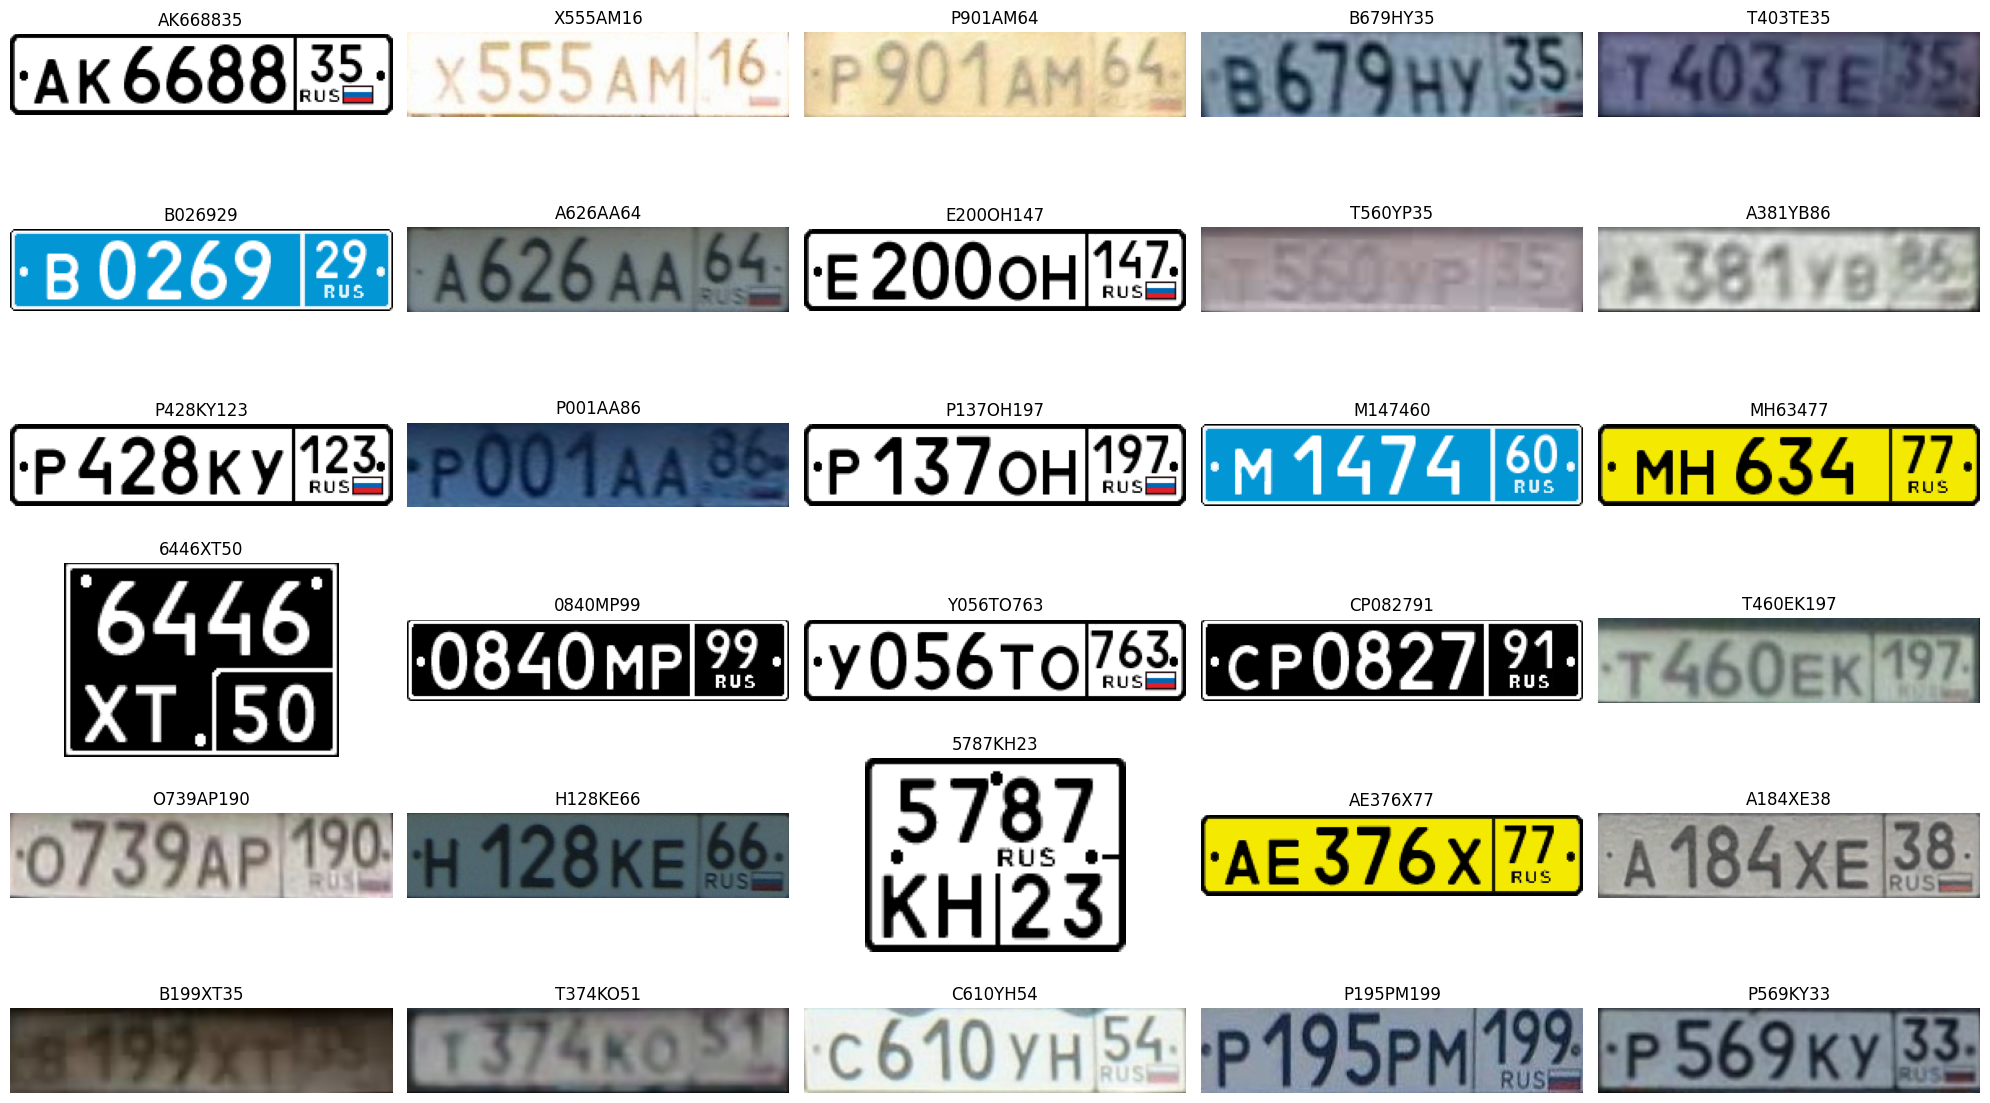

In [13]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

Как видно, в данных встречаются номера разных типов. Для учебных целей отфильтруем примеры и оставим только те, которые относятся к "стандартным" гражданским номерным знакам, а именно имеющим вид `LDDDLLDD` или `LDDDLLDDD` (`L` = "letter", то есть буква, `D` = "digit", цифра).
Кроме того, отфильтруем примеры, в которые встречаются символы, не входящие в алфавит регистрационных знаков (см. переменную `abc` ниже).

**NB: используются только заглавные буквы латинского алфавита и цифры.**

In [14]:
abc = "0123456789ABEKMHOPCTYX"  # this is our alphabet for predictions.

In [15]:
print(ascii_uppercase)  # may be useful for functions below

ABCDEFGHIJKLMNOPQRSTUVWXYZ


In [16]:
print(digits)  # may be useful for functions below

0123456789


* **TODO: Реализовать функцию `compute_mask()`, которая бы возвращала маску из символов `L`/`D` для переданной строки `text`.**

  *Пригодятся переменные `ascii_uppercase` и `digits`.*

In [17]:
def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.
    
    Args:
        - text: String of text. 
        
    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D' 
        or None if non-letter and non-digit character met in text.
    """
    mask = []
    
    # YOUR CODE HERE
    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None
    # END OF YOUR CODE
    
    return "".join(mask)

assert compute_mask("E506EC152") == "LDDDLLDDD"
assert compute_mask("E123KX99" ) == "LDDDLLDD"
assert compute_mask("P@@@KA@@" ) is None

* **TODO: Реализовать функцию `check_in_alphabet()`, которая возвращает `True`, если все символы из строки `text` содержатся в строке `alphabet`.**

In [18]:
def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.
    
    Args:
        - text: String of text.
        - alphabet: String of alphabet.
        
    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """
    
    # YOUR CODE HERE
    for char in text:
        if char not in alphabet:
            return False
    # END OF YOUR CODE
    
    return True

assert check_in_alphabet("E506EC152") is True
assert check_in_alphabet("A123GG999") is False

Используем обе реализованные функции для фильтрации данных от нежелательных примеров.

In [19]:
def filter_data(config):
    """Filter config items keeping only ones with correct text.
    
    Args:
        - config: List of dicts, each dict having keys "file" and "text".
        
    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"], "text": item["text"]})
    return config_filtered

In [20]:
config = filter_data(config)
print("Total items in data after filtering:", len(config))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41141/41141 [00:00<00:00, 541015.14it/s]

Total items in data after filtering: 31345


Посмотрим, что осталось после фильтрации.

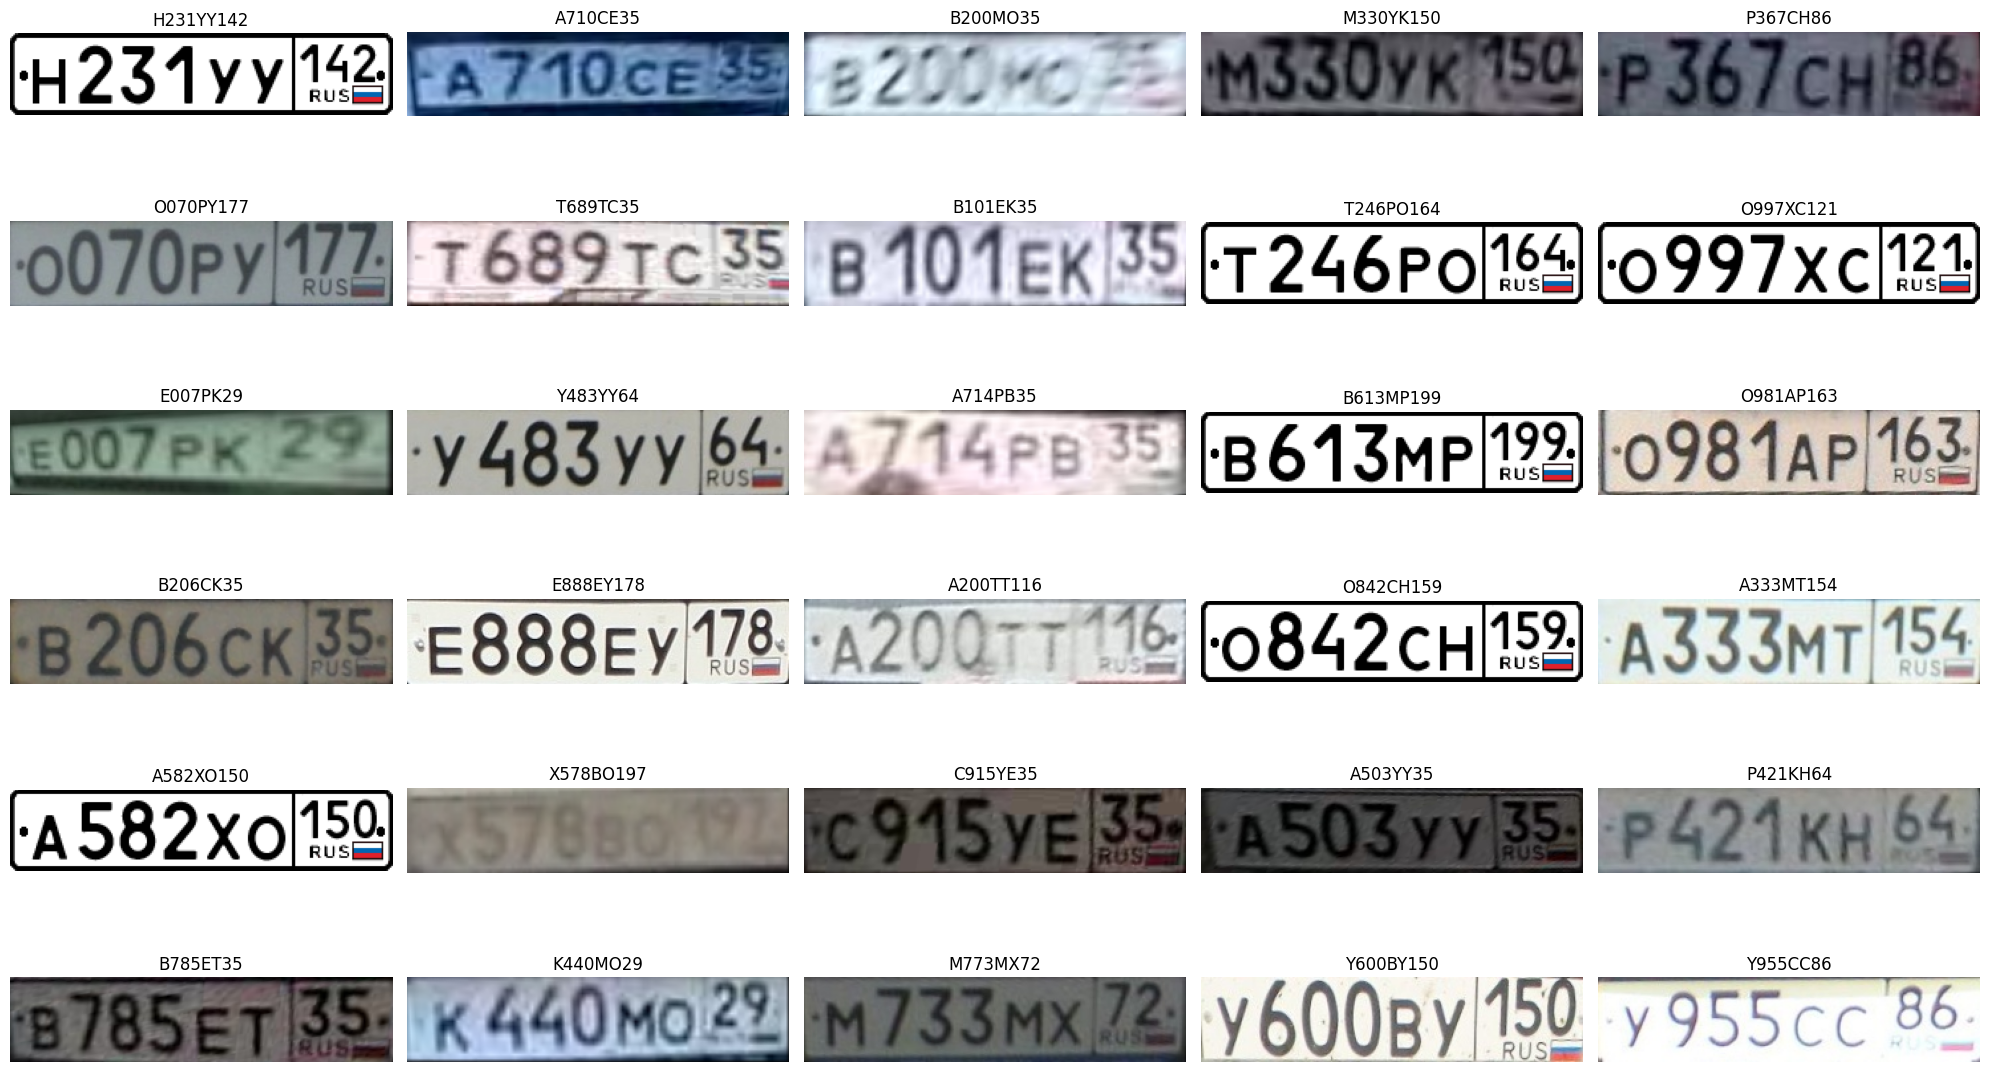

In [21]:
SAMPLE_SIZE = 30
NUM_COLS = 5
NUM_ROWS = SAMPLE_SIZE // NUM_COLS + int(SAMPLE_SIZE % NUM_COLS != 0)

random_idxs = np.random.choice(len(config), size=SAMPLE_SIZE, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = config[idx]
    text = item["text"]
    image = cv2.imread(item["file"])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(text)
    plt.axis("off")
    
plt.tight_layout()
plt.show()

---

Теперь переходим к созданию класса датасета. Что важно:
- Конструктор принимает список словарей с ключами `file` и `text` (`config`), строку с алфавитом для предсказания (`alphabet`) и трансформации (`transforms`)
- Для обучения нам потребуется возвращать в методе `__getitem__`:
  - Изображение в виде тензора (фиксированного размера `3xHxW`)
  - Изображение оригинальное для последуюшей визуализации
  - Текст номера в виде числовой последовательности (т.е. в закодированном виде)
  - Длину этой последовательности (требование для обучения с `CTC Loss`)
  - Текст в виде строки (для удобства)
  
  Удобно сложить все эти переменные в словарь и доставать их оттуда по ключам при необходимости
  
- Отображение "текст `<->` числовая последовательность" будем делать простым индексированием по строке алфавита. Число "0" зарезервируем для символа `blank`. 
  - Например, пусть наш алфавит = `XYZ`. Тогда текст `XXZY` будет представлена как `[1,1,3,2]` (без `blank` было бы `[0,0,2,1]`).
  
**Задание: Реализовать метод `text2seq` для кодирования текстовой последовательности в числовой вид, как сказано выше**.

In [22]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.
        
        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config                  = config
        self.alphabet                = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms              = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "torch_image", "pil_image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        pil_image   = Image.open(self.image_names[item])
        torch_image = self.transforms(pil_image)
        
        text    = self.texts[item]
        seq     = self.text_to_seq(text)
        seq_len = len(seq)
        output  = dict(torch_image=torch_image, pil_image=pil_image, seq=seq, seq_len=seq_len, text=text)
        
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.
        
        Args:
            - String of text.
            
        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """
        
        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE
        
        return seq

Соберем датасет вместе:

In [23]:
from torchvision.transforms.v2 import Resize, ToDtype, ToImage, Normalize, Compose

# ToImage - преобразование в тензор
# ToDtype - преобразование типа тензора
# Resize  - интерполяция тензора к требуемому размеру

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = RecognitionDataset(config, alphabet=abc, transforms=transforms)

In [24]:
x = dataset[0]
print(x.keys())

dict_keys(['torch_image', 'pil_image', 'seq', 'seq_len', 'text'])


In [25]:
from torchvision.transforms.functional import to_pil_image

print("Image shape:", x["torch_image"].shape)
print("Seq:" , x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])

Image shape: torch.Size([3, 32, 160])
Seq: [12, 2, 1, 1, 20, 21, 9, 3] Seq_len: 8
Text: B100TY82


---

Текст номеров может иметь длину 8 (`LDDDLLDD`) или 9 (`LDDDLLDDD`), а класс `DataLoader` плохо справляется (из коробки) с данными переменного размера в одном батче. Однако, как увидим далее, реализация `ctc_loss` позволяет передавать батч последовательностей в "склеенном" виде, поскольку отдельным параметром передаются длины всех последовательностей в батче.

Таким образом, если в батче были последовательности длин `[8, 9, 9, 9]`, то мы склеим их в одну последовательность длины `35`, а `ctc_loss` под капотом сам "нарежет" ее на части нужной длины.

Для этого вручную реализуем функцию `collate_fn`, чтобы `DataLoader` понял, как формировать батчи.

**Задание: Реализовать функцтю `collate_fn` для формирования пакета данных**.

In [26]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.
    
    Args:
        - batch: List of dataset __getitem__ return values (dicts).
        
    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    torch_images, pil_images, seqs, seq_lens, texts = [], [], [], [], []
    # YOUR CODE HERE
    for item in batch:
        torch_images.append(item["torch_image"]  )
        pil_images  .append(item["pil_image"  ]  )
        seqs        .extend(item["seq"        ]  )
        seq_lens    .append(item["seq_len"    ]  )
        texts       .append(item["text"       ]  )
    torch_images = torch.stack(torch_images)
    pil_images   = pil_images
    seqs         = torch.Tensor(seqs    ).int()
    seq_lens     = torch.Tensor(seq_lens).int()
    # END OF YOUR CODE
    return {"torch_images": torch_images, "pil_images":pil_images, "seq": seqs, "seq_len": seq_lens, "text": texts}

In [27]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['torch_images', 'pil_images', 'seq', 'seq_len', 'text'])


In [28]:
print("Tensor:" , batch["torch_images"].size())
print("Seq:"    , batch["seq"         ].size())
print("Seq:"    , batch["seq"         ])
print("Seq_len:", batch["seq_len"     ])
print("Text:"   , batch["text"        ])

Tensor: torch.Size([4, 3, 32, 160])
Seq: torch.Size([32])
Seq: tensor([12,  2,  1,  1, 20, 21,  9,  3, 12, 10,  7,  5, 12, 13,  3,  2, 15,  8,
         6,  7, 13, 18,  8,  9, 15,  7,  6,  4, 14, 16,  8,  2],
       dtype=torch.int32)
Seq_len: tensor([8, 8, 8, 8], dtype=torch.int32)
Text: ['B100TY82', 'B964BE21', 'M756EP78', 'M653KH71']


#### Разработка модели CRNN

---

Модель состоит из нескольких частей, прежде всего `Encoder` и `Decoder`.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAioAAAb6CAIAAABjI87YAACAAElEQVR4Xuy9ebhdRZX+v5ukIy0m
hk7LIIIgNEMEBAURRGYJCAHCDO2jj80o0DLPAcIoM4iK4MAUCTMigjigICCDAgkkTMm99wz77DPd
e00ChDGQ38v7sap37s29SdBOnuf33euP8+xTe1XVqlWr1lpVtap2Mq+AAgoooIACljgkfRMKKKCA
Agoo4P8eCvNTQAEFFFDAUoDC/BRQQAEFFLAUoDA/BRRQQAEFLAUozE8BBRRQQAFLAQrzU0ABBRRQ
wFKAwvwUUEABBRSwFKAwPwUUUEABBSwFKMxPAQUUUEABSwEK81NAAQUUUMBSgML8FFBAAQUUsBSg
MD8FFFBAAQUsBSjMTwEFFFBAAUsBCvNTQAEFFFDAUoDC/BRQQAEFFLAUoDA/BRRQQAEFLAUozE8B
BRRQQAFLAQrzU0ABBRRQwFKAwvwUUEABBRSwFKAwPwUsBH7961+vscYaf/vb3/T8wx/+cNSoUb29
vX2R/m/gn1jdxIkTVVS1Wu374p8Nc+bM+e1vf3vBBRccddRRRx999Pe///2enp6+SIPCopQwderU
K664QginnHLKpEmT3n333T4IC4VyuXzXXXf95Cc/efrpp/u+CyAyTjrppMMOO+zss89+9NFH+7x9
+eWXzzrrLL29+OKLm81m/tUNN9yw4YYbvvnmm/nEAgroA4X5KWAwmDt37ujRo4877jj+XnLJJUmS
dHd3z4+1qPDjH//44x//eJZlfV8MAP9gdXmQnlVRpVKp74t/Ntxxxx2qaPjw4eutt57M9r/8y7/o
+Z577umLNzAstISDDz5YCB/5yEc++9nPrrzyynpeZ511Ojs7c2UMBvV6/T/+4z+SAKeffnpfjHnz
Xn/99TFjxujtCiusoFo+bsgjiMhhw4attNJK2223nciTaX/++efjWxmeT37yk7KguRwFFNAXCvNT
wGBw2223Sf3JU+bvP2gP5Mgre5qmfV8MAP9gdXl4//33P8QU4UNApVKZPHmyquPvlClTpMH//d//
/e23354fcUBYaAnnnnvuLbfc8sYbb/D3pptuUh/tsMMO/F0oaKZy0EEHXX311SpkIPOz7777/uu/
/qumjJDx3nvv/fnPf45v1SMyOZtvvrkmavpbq9VkbDTdiTQLJkyYIJqLCVABg0BhfgoYDLbddtut
t946/o32QK6uni+66CIpyv/FNlSrVSlEeb4XXnjhgw8+GFXSiy++ePjhhyv7DTfc8CtD3q4ol+ZG
55xzjkxUXA6K1U2fPv3yyy+/4oornnnmmZhlIJA2/OlPf6qihH///ffLkZ/n8lUjKlt2CAL6wOzZ
s2MhsgHXXHPN2WefraLa7XZM/xDwne98R63o6Ojo+2KRYaElbLPNNkOGDNFUte+LQeGll15aoPkR
/5V+2mmn9UmPcOWVVwrhD3/4Q0xR7yglv0A3Y8YMpdx4440xpYAC+kBhfgoYEP72t78ts8wy559/
fkzBHpx11lkf+chHPve5zy2//PLyu2WEIsLvfvc7IcjtlS+8yiqr6FkGDBdYPvvIkSOVstJKK61i
iNpKhkq+NqtJ5JLZiNVddtllerXGGmvI4xY9P/zhD2N1/eH2228fNmzYqFGjvvSlL62zzjoq9uST
T543/+KbzMyo+WHZZZfV22hKL730UmUcMWLEBhtssNxyy+nh97//fa6SxYOxY8d+7GMfi5OVDwEL
LWHMmDFiUX7ysSgwkPkRx7B2mm+9/PLL/RdL99prLzE5P5+TO6Is5513Xg5rnrps9913z6cUUEAe
CvNTwIBw7733SqfIosQU7MGnPvWpV155RX+lgPbee29ZoL/85S8gyOd9/PHHI/5tt90mg/Hd736X
vwtcfLvzzjuVuP/++7/22mukvPDCC9gJqpMVobo5c+ZstdVWMgb5aUofWH311aWL33nnHf7Kgk6d
OnXeoHs/5XJ5xRVX/MIXvoB+p9XHHHMM6nXmzJmyoDKog1TaH6SOf/GLX2ied8ABB8iSfYhJwKKX
oKmhEPbZZ5++LxYGA5kfMVBMVo1qdWKQGX7qqaciwkYbbSTTkssxT30ntG9961v5RFEuB2VxjWIB
/+9AYX4KGBCuuOIK6RQpqZiCPbj66qtjSrPZlN99yCGHxJQ+sM0223zlK1/heYHmZ7PNNtN8iF2E
PkB1d999d0y56667lPLkk0/msOaDj370o4cffnjf1IHNj4zK+uuvv+qqq9brdVK23HLLtdde+733
3os406ZNU96JEyfGlIXC0UcfjeKWbT7uuOMW2LrBYRFLkMn8/Oc///GPf7x/0xYKA5mfTTfdVJMb
cVLzTs0IJ02apA5SFbHj1lxzTRmk+TPNE53yRfIpJ554osr/pwQuFvD/SyjMTwEDwhlnnCH10Wg0
Ygr2gPlEBGmiTTbZJP6VtRg3btzo0aM1Efn0pz8tLbbWWmvxqr/5kZYfMmTIvvvuG1PyQHWVSiWm
yAdP5jdIfeDAAw8UwnbbbSfV+dxzz8X0BZqfd999d8cddxw+fHiM2hI9mknIu9eM7QLD+eeff845
5yjv+PHj83kHB1kFTZs0L7nqqqvEgS996UuLuzGzKCW89dZbO+2007LLLvvggw/2ebUoMJD5kUOg
9AkTJsSU+++/P4+p+aj6N76dZ74lnsLmE8U9JaoJ+cQCCohQmJ8CBoSLLroomX/HG3tQq9VyWPO2
3nrrddddl2e2oPfaay/NkG677bY77rhDelNGiLf9zc/rr7+ulCOPPDKm5KF/5Ntf//pXpajYHNZ8
8M4772jStsUWWwwdOjTxqtGUKVPmDWB+Dj30UBm/Bx54IKZAjwge0w9UQi7rYoAMocr81a9+1ffF
IsMCS3j77bd33XVXTVPYJ/sQMJD5UbFKz4e6qa5lllnma1/7Gn/F3hVXXDG+FbTbbWU56qij8okq
WYlxWllAAX2gMD8FDAgTJ06U+njiiSdiCvYg7vQAmtzE5bXVVltNmjr/dnDzI/jYxz4mfZdPifAh
zE8EGRLZv1GjRrFM1N/8XHzxxUr50Y9+FFOA5ZZb7p+7YU44htre98UiQ/8SZGVFpEzsL37xixzi
4sFA5ufUU0/t0++aJqqunXfemb8y23365Y9//GN/ZgpNU8m4D1dAAX2gMD8FDAjTp0+XTslHmmEP
iCUDJk+enFdhH//4xw866KD4VjMnKaBofrAB+c0kwZ577rnssssu8D6Cf8T8ANKActvff//9Pubn
rrvuYk9lPmzDuHHjZBEXSE8EWdBFj8Y+6aSTkhDLByxW9nn9SpAx0PxS8zbZ1/kR/xcWpYqBzM+T
Tz6p9HzE4+9///skF4r9y1/+Mpl/C/CQQw4Rn/PLpIJNNtlE86R8SgEF5KEwPwUMBmusscYBBxwQ
/2IPPvGJT1xzzTXNZvOxxx5bZ5118hcZyEGW7r7vvvt6e3sffvjh0aNHjxw5MpofjMeBBx547733
PvDAA9wl8/zzz//bv/3buuuu++tf/1plvvzyy9/73veYYC2u+VGle+yxh5SjzMzMmTMffPDBlVZa
SdOvefPPfmRWVeP666//5z//+YkcsL0/bdo0TYBEj8pRu5RFpH7961/Pn+pXUfnjUHmQwRs/frw4
8PTTT//2t7/99re/Lb280UYb5Q+9DpJ93iKUcOSRR6qE7bff/kfzAyecgMGr0LxW+BMmTBCauozs
+QDrsWPHignXXnvtjBkz1Fma1OZDD9577z2ZFqXceeed4s+VV14pCkV2zD7PsXDyPM4+++x8YgEF
5KEwPwUMBnKBpYaiXsMe/OpXv/rUpz6VGPTwyCOPRPyuri4pSl595CMfOeuss/bbb79ofgTnnXee
skhbCSEeppEZkDEgl2DllVeWmZm3+Obn1Vdf3XjjjSkcGDNmDCYnb37w5ftDPPfzzDPPyGjFdM0z
ttpqqzgfmjVrlhK/+c1v8rcPnHHGGdLLMe+wYcNkuvITkcGzz1uEEmRX4ts8RPOw0Co4XNUHHnro
oYgwe/bsffbZJ3JSbkQ+8FogW7XtttvyVmjf+MY3+lxwcMMNN4hvg08iC/h/HArzU8BgIK03fPjw
/rvuc+fO1WxgypQp/cOx5Bp3dHTIc5cx6PNqcJBtkI6Tu50Pev4QIOU7derUZ599tv9NnYsFjUZD
9Lzwwgt9GnLPPfdIsXIUaYGgaYo48OSTT4pF/W+dWWj2eQsrYaGwKFUsCrRaLXqk74sAlUpF89QF
rvJtueWW8jz6phZQQA4K81PAQkAToDXWWKPYQI5wwgknHHzwwX1TFxn+weyLAkugisFB80vNfTUV
7vuigAJyUJifAhYCb7311qOPPhqvJCiggIVCZ2dnfqusgAIWCIX5KaCAAgooYClAYX4KKKCAAgpY
ClCYnwIKKKCAApYCFOangAIKKKCApQCF+SmggAIKKGApQGF+CiiggAIKWApQmJ8CCiiggAKWAhTm
p4ACCiiggKUAi2d+3jcM9JyHmD4QwvvhVX/oizd/afm//SEWEnEGwnx/QcgLhD5oQF+kHFr+Oab0
x+Shz6s8RJyBygEWipCHiDY4cr7MwTHfH7Q7IuSLWih+HnmBkC8nD33xFoSTh77Y8/NnEARevReg
L1KAiAz+QG/zKQtMj28HegWIkrlz5+phruH9gVvxfj/OxJS+eIb8q0HQ3l8QAwdCBiGiDQJ5tIHw
I87gaO8vqOGDIwAxfRDkPq+A+CqPScoCIb6dH30w/PjQH22+IvpBH+SIz0P87QMxMY/84WDxzI/k
+/XXXz/++OOHDRu2zDLLDFkYcGVh39R+oNKE9tGPfnTo0KH6y+8CgSsOhd/3hSFmjFclzv9+AcBH
yRbaFgpcKNoQUwjaIK0AoHAQNF5FtIFaHWHRKRSrhTlI1QBV87zsssvO//J/YVG4LeJh9eBoEUDu
mxpgqGFIrskDMYf0Ra86dvRAzFG6WJEX7EjMAoF6B6kaxqqEZQwwqi9SDkDrm7ogyBM5CEDeopQJ
5kCsBuBPbPIgyIveKUOCiuib2g8GF5s80OTBWT0kFLhQtCEL4zYlwGShDTKaIsAcZRkceVE6jtoH
IS8Ccki9fd/lIBYokEXAA+trLRYBFtv8vPXWWxdccIGq33jjjXc37LHHHvrdLQdjx47V77hx4+g5
EsHpg7mb0bbbbjthLr/88hTYByHCmDFjPvnJTwpzxx13pIo++JEeoTEM+r+Nf3cznTBx88031/NA
VevVZz/7WaFtuOGGonYgtD333HOfffZhnOzmdglETF88g5qsDl555ZX7vggsUml7GFZccUVhjjUM
VDXpQhs1alTEWSCyClljjTVE5BZbbLHrrrvutiC2gMYnLwVqxW5uDun9efiFL3xBaOuss05M7FOm
ntWcvffeG8WkLPoLQv+qBV/72tdEodoSezn/Ftr22msvFcLl2dtvvz2Y/ckD9ttvP9W73HLLqRXK
FdvC25hFr9TRIlItim/zIEy6dbPNNmMcLrAhPKsEYY4cOVIUrrbaan0IiyyiIV/96ldVr5pDFXnM
PKhMhkA+MZacr0I8REeo/MiW/ph6UJNFoZosTP1dIM8Fku28PESIjY1/v/KVrwhtlVVWUTcJuT8n
yaJXGvKicKeddoqV9q93NxeObOdVTZ++3t0DX7K9jL/KSkeTvsAyGfhqMn/7ELl76AUNeaFttNFG
/cUmD3oLc/q+MMTWCW2HHXZIrOsYfQuE3d0LaHkJhgZOfx0LCE1sUYHDhw9fIIJAeSFeBcrvHGcN
1r/A+Jcb60ePHr3LLrvkESKMs1oT62jynDlzlpD5UR0yP1dffXXib091dHSUy+VarZZlWb1e10O1
Wm00GnrWL9/fFbz66qtdXV2dnZ3CzwzKValUhNZqtXp7ex944AGhrb/++koXpl51d3cru96qQBWr
FD08//zzXIM/ZcqUnp6eukEV1QxKEZpyzZgxgxvp1TGyzCpK6UKj8GazqaLIqwcovOOOO5QuHNWo
ovSr0kRnmqZK1KuzzjpLaGeeeSZtpMZSqaRXwhFm0/DGG29IDoSpuqhXNaoEPc+cOVM1UovePvXU
UxonGqhKVF1KV2m0F85AjDJ+8YtfFKbSZ82aRZltg+pVLrFUDyJGFanetdZaS2jigEpTIeAIuWpQ
inpBAiTlPmnSJBUlypWuilSdHvQ2ti4yRz3eZVCi0FJDLXS6Kvr+97+vAg866CAVqHQlik6lwz16
XA/qC1SnyBMaDBH9EK/qoFa/ShTammuuSV8oRZgVA2XCBL2SIyKtPXnyZPpLZSJaVcuhfvU39YfX
NJJXXXVVPeitEhEDCFMiXJKEn3jiiSNGjLj88svpDhULNxBUOlpZrr32Wo1kmBO7DDoj2/WgJsvw
CE0aRHmFRr1QpVbzoPSnn35aPJQ8wEBkhg4SJYgivSBXSQWql5Wo/lI6rKOcikVdv2Ky0NQWjT6G
HsxRCSoZeRMI89xzzxXmZZddBjFqacX9SP/WPa6V5e2330Ye9Ew6cgWacumvMFXyvffeKzSpM9Wl
t3pFK/QKhlPma6+9tsEGGwjzlVde6fNKWZA3tYKmCW299dbjWW1BwGoeg6DpQfTLRsrJmD59ugpU
K9RwOkJvRers2bP1imGV2DOeO3eunhmAKkeFRzrr1g/HH3+8tPZJJ52kokRS6sEOG+mUzCNIKhjm
vPnmm0qJ2gl5rhponTpaaNJjKkR1CTMNYiMENQTxePzxxynw0Ucf1assAIKqLJJGOvrzn/+80D7z
mc9ACcXSL4KaB7JqEWEUqIxKFFrVCiGzFFGs0sXbCy+8UGjHHnusiBFzGCBRFaN8lFHygDepkj+c
7Zn34czPD37wA9UqqY3iDsdFVsPGQG0TfXx0JLH5UfMYPGqSMNUqWlK3qvr1r3+d2PwwhBrWvMoi
TAYDqkRWZ9NNNxXmX//6V3oLyWb4MZglXqpCWinxV9HopCxoGXqubJNZsZKCwjvvvBOhJ50+Q8Je
fvllPWB+9KuuqlsVRjWHkDGeVR1aCfKqVkzQyW8kGCncaqutGFHYDBFf90iGWpUp5qjJGieQVLNu
ogQGXsMQ1c1//ud/IvoUm1oPxry4CwcccIAKvPnmm7us9LsD6C3NkToAH+ZIzrLgMWTWJgI0GgPy
iiuuENphhx0G6xjeSH8WVJiQ1aIVVlhBmFUbPP2lXyi2FvRdxVojsfnJrLKlNcRY0qEQZoppO++8
s8bAX/7yF5X/gSwGxyWqdfipXxWo2lWUElFVKF90Tc2K7J133jnjjDPkQFx55ZU0LYqNCEBJqXwV
eP311+M+azjA55qVFy0ScrdVvCRf/rjQ5H5SL/TolSihXoHwX3zxRUnOl7/8ZWVMrY8atkC0AkxU
BuZHtgTKqbFtBdG2PUitQzHh0sXS8ipB+JJkhEfPjMHMClQaVpiXXHJJxbLatoWu2wxArTBVrMpB
HuBA02ZYFSE8oLU8gn7zm9/Q5JJdEKSUTsksP4xKqeyNN95YmOpW2NW0skZcmzYbytVjkMTK/OgB
AaiF8QvbqUhdJpdcbJQA9xqQLt5mHjU0qmbZllenRlU9SBlNcBsa6jY/kgdhnnLKKfn+jdyDBj2r
LpgjmURaLPUfDEMhMO7I/uyzzwpNHQ03aCN8hjya9uc//5kC5aciCYhx2QCO1IXI3mSTTRLPNXGP
aA48gdupxTgaSFgqyYQ8ZKBmFxCpu/TSS4UmqWAI6JU6SLm6bYoaNqJ6JddqGS/TadQsUfPD7GfC
hAmN4NuiiTIPkpa1Z83TERosvlSDWUbC4iBJrR9l4ROv3sAppXd5DgR3KlZqen7uuefUbcJ88skn
6Q9Y2bBLrgEsNtWsRzRjTTz7Ac2Gr6tkiETS91B49913i8g4qISsrq0FZz92iSxu2ZZVmBrD0EaB
yLRmPxrwwhRD6EvQECyYQPORQnm7cIASaE5mXc+0QIma/QhTuoOBV7HjX7ceoYrU2kpZEqtslVAK
6lUMQWL0zJxDKfIQNUR//vOfVwyMDSGgZylchagtMEdDVLnwQ+nZ2N6adeKPf/xjoR188ME1j4ou
+wEVW2jwEQlJ/EorrSTMF154oWrzicYBAXzEQ38Tz+RqYT4tAkq2FrRancXYGDt2rCYNchVTQ8NT
VSplXNWtRBDFlVdeOWaERTV766hXFf7uu+9K0UhsLrrootSaCPKgtiv448qouWM0P1XPGoUZhYom
6EE2BvOzxx57IC1lmxDKRN6atiJyraRht9lmG9QQlFeC7wLBWN/NNttMBapkOpoS6oZ87alnDJJG
6Z2apy/wJLMCTT2yIOnkk09OLNtdXhtoen6GANNxKKY4+6kE7Va1kaCvK9bg9NGDDz5Ik8Ur6KFq
RDGmqAmf+9znpMKwi3Qfr2gXtZMl8XKQlLueNaZooF6VrcRRF3oeN26c3JGpU6ciNnRrHAuVMHZU
QuKNEDGnEtwamlnzqM88z1DKaaedJsyjjz4asanbq0bPVMJcP/VcBOZIyBsebrCo7hGKYEOzOlpo
anjFwtzpSRXUIhWZ5VYeFQXK1cbUkZ3fml2WuiVkiy22SPzVx2jCRWHTkz90I+W3w1oUfk/TwwQi
S3ZWUttv/aLev/Od75TsW8w0pF5CKFv7ZVZQYh0bDUvU/EgKv//976vW8847Dw4CdSsFGsbAQGiS
0CW0gW6jz+gk5UJeP/vZzzIy61bEWA5EAe6/9NJLEkFhauqAwqIEZBRRwysfM2ZMYm+XEpCbirVJ
02OVB6RQcOuttyKaaI3UqqdklY3sYn40+ynbfuQBFda0eGkeivnBP4rDDyFjkEDAE088Ienfeuut
aTINbAZlV7ESL9lYsrOCaqA0BmTDHmU9+KfdXk+QCe/1RAHvuBlWGtERDetxhujEiRNpCyW0gtZr
WIN35xy6ef7onP62PV+hvRFZxSIPhx56aJcVdNMTeVpUNzSsQ2XGMD+qV/xBEWdh3sxQofflvQpt
7bXXhjNA3aohtd5U6zq97sQOh8YqHR1bCsA0YeK5y/zAlpYdl7anwnkNopYed9xxI0eOvOyyyypW
stWwMtm0VFfs7aqKG2+8EfOjLN1h9QZMyIBF0fzstttu0AO3QUbTMfiZ/cgdadoadYfFZxiOMFRt
BVl/7vEcF/7oQUNDhcDwikeB/KfEYQKQrRIokLY0rX1oOBpWsx8ooVPaXsnotsNLh8o2Iw89XpOg
XiCzaWkG6b3vvvuEJhewHAANSMPrlgc9yH3Oz37ofVqEaDU89pWRcSr90LS167J/g2ALR88svqmZ
mnKJjdiztleTKmEgN6wiGh41ceBLMGq2doxNsTGKXNPrGWKODKR+GZWZxZUpTmpjgNtaD7qOcQQx
SFc7LGPQX0xrNGWJwq/S6M3Y3UKePHkyBWr284GWMdTtS5VsFWrBaWNBSOYndmhq9QXBEoPM1kI0
UCB1IWa1+dcb+cvi1jHHHEMhTC0awWWp2fLpr+RhqOMyZH6W0N4PoQc/+tGP1CUXXngh3YlsseqF
FU29PqtXNBipKtm/Tj2kK3a6lQUl8sgjjyS55UuGgWQIVUItetAQ3XLLLRN7BPQr7EDCUPHKqOfd
d989sflBXjvtvKs6urwWlrCUEQpvv/12WA9ttTBTEUgVqky5w4nn4Ig+LWrZE4FCRLztb4MKU3KM
iwTlZduw1Ot+FQNNlvmhNAxV5oEHZ2COMKVupOmmTZtWssNOY5GJSAxjNfH6eNXAKK2G5d0sKAsl
7r333hqik7z3Q95IlWqkC2q2IjBHY5VX4NC/kFf3qjrfsf7v//5vehnCRGGnITJH7ML8aGjpL6/S
4JE0rJI6vKyvrk88kwNBf4VMS1Mrpm4vFaqWXXfdVaIo94VaYoH4LnSx8mJKP/nJT9IR6tPUvh7u
RZc3JpWL2c+IESOuvPJKGlLxAEaXpR7/mef6mvDh+ikLglcJ88iK/RgeZH4+/elPJzY/VJeGzYPM
KjsKkmpRL8uTlXZAhrtsO8t2EV4x0K3MhtFlvC17rgwNZSsaRmVi86Puw/AgD9Cv0mCmspx44omq
+swzz0wt/5BXC2YgykZU2ZTPFIS+y2yuYL4oZy1dngGsq9tIQLBl5wMcuMQX1hEkalcWmoMcIm/K
LgqF3AjOqNqCotezuEoPKqOmXJJtDRYkHxyVJhw6PQ3+FsyRv5jaiqB/M/tMbXt1yqJZFFPDI444
gk5haMBPZZzhrRqywBw9Iwad1jlVz4zRTgK9ZVNHprRkB52Rjhwiw3A7mh8pClGO+aSL4UzselSi
zE8tqLU07AJWDTS5J6xFNewLIs8aFxpcKp/BWPboYPYjP0xKLPOmHS1Kg+gKWVmiO6IJST7Kf7Fg
sc2POuzUU09Vz8nN/4Rh1KhRyy+/vHxGPS9v0IP+stAvC0mi/vIAkGuUQQM+sTTEt2SnwFis0FSa
BFEPIw2kU1R8FmCWpZhi+vIuJ1YakVWa0GQzyCgAjV8wVREUCi2WFt/GAvllPXTFFVeEQojkF3bF
5tBk6qK94OTr1S9qLpYvNBBi7YAy0uR83pgrpuiX+ZlaFBOFE/HzfxGvWONIdzEPo3IswuJqRgXC
QAVq8sGMIab3x4mghkR5oDp+Yy6qpqMjjkiNaCTmCxTQlljIyJzQrmBQW4Y4QChWAVBIvliYw6tR
5ka+c0FTgdTLX9IhQJhIeMwyxBCJj5zkF8pVSJ6Hn7Dk5LNALXmHOeiZXMvPz22Q+UUeaDIlxHIo
PArAMg7GjQXGcmBIzA5z1DWINHl5FXORRTgikuEcE/MNj5CXbQqMr/K5aAtv6VCNRMggY3yIsp1/
RVHxWQ8UKNkelZP/mAWyeaBfIm3x94MOzumxUWYjAz9fL2XmU9AkqKbYL8sHDQDySPMwcpvaR+UI
iw38hPUDFKKd+lAF2vJWs8s42ntkUMKxtIgDQKFmkEvI/AhkfvB2Tz/9dDyalmf0rP8w4a17DSTa
2zlz5giBWB3ZW6wxro0MqTzEX/3qV4nDmlsh1iizj4Y/ktmHlRF+7rnniOl87LHHZLSbXpztdSBH
r3eG216y0688r8RDdKbDqxqegqT2i6Nbh3cAhYQeMI/uDpFyeItle8csUJx//vllr37WvB6S5hZn
WJF4/fXXiQapO6QiC+vdLQNcqnrFHCdIzcGXSe3ixWXZsr3jkmMZNPtRN8MNpbCGWfdmPpypetm6
09v166yzjqQB74zlrMyeaY9BtWsGecABB0j6b731VrJ3e8lYvfOBZxjW0+Vt6S3MkWDpLT2I55jZ
SQRTrIihB7xte3FDZYqSht3eWQYlMvsRqdATp/z80qKml8sSh1HgozXCymrdPnLbqxkUO2bMGCkI
FigqXtjUgyoS31ghoSPw3FW7SOr2uqJSmCHRgzh3Eu+zzz57pBffamHbiRaBzMKFuun6669n2CsL
CEqEpGqYYajMt956i9mPpuNNL+YIreHYBPZ+GS+pZ5MyAJr9NEN0QxRdmqYuxl9mrZ9wHrJH2pqG
LOyFCE1tkZfa463mqicEsAUOIHia8AlT83uGQJeX6eigtpfgGAWSbeSBxSJY0fJ40SslKi+jg0DW
ffbZp9OTaYS54q2IlteLUi9Hy2tmLT31/KMnbOKWwoYWI6getmrWXXdd6Cl7T7EZdg2rAZQi2RYb
EZW2J2RNawl4SEdXwkxOBkPdN8s7JfCkHjY2oFxwwgknCE3DP/M4gp4oit1eM8zrOjWq4W3OzCuo
YCK9MFayKjR1Iq2AMBAYrfDqr3/9a2Kj8vTTTyPAdETLs64ur+Kmnn4ReqCZvXBq1r0UpfIZKZ2e
2UcK6QXkBAlPw/Zzl4G1dDUcjvUayEXhiKJkG12nJmtaMp+RWGRYPPPD3s8111yjWsePH4+U1D0g
yw41RsRj39BgSWePlxSYjarZ6p44qMQjVqJWW201tUozvkpuG1Pqsm51LzSZHHjNYkvmjTvQVD7G
Q2gqc5dddkls56NMV2zqSt5NQeHCVii88cYba14Ba3rJvuYlqQ6vHyITF198MU2ma/WLvqZw1TLD
G/vR/OivqGUg1T2RbzugCFETr5555hmhbbvttqmNYo/3Qrq9QNzyUkwaVkK22mqrJERy17wmVvI6
HhlRXg0v4whtjTXWUF8wzMphXY4hx3hWyfvtt5+G6G233VYNS1UzHQrV6eW1qncpe7wkDXPU4122
xE0rdzqx7LUClOx1110ntEMOOSSzuZ3uqI1ORz2Qqxx2LDE/ciNUUa93ClGyQmgZGJMdjtqSbkqt
mFoOtKt6HaPX687VALv5AMezzz6LqmqFzcJyCCtCeBBFuXLYxQ6Hyc3I7cwhchpF6mLZMwKva17d
munFK8wVI1a/N910E36xlHtX2JbrCVHabZs92Cgjmtj8kAjDVXjDhq0etiEl9kO8+KaKVCCjPeov
ZHWmPQ8i3+q5qBMGEaxr5c4M0GTJA4IdRbfiha8e2w8159hjjxXmBRdc0AzbV4yUDi+kv/LKK5l9
ghi5G80PtfR6U7Dbbl9mD+l3v/ud0DQGOwx1y39mrVoP4Qxte0gbbbSRXCt1H11GZ1Fvr42BikXy
hbbeeuuJAzO81BZFFze0YYuulL322kv9Mm3atNQWvcdhzS3bvOkOua5aQbW9ViblLtnusVvWCDt2
cBVeqS0svh155JG86rFJjk2uhRX4nqDccblYTEMghVny4htdhl353Oc+JwR1empA/EQhtasujREK
fOihh6ph96EWIl/KdhDpKTxyeTlt2+Yea7yWfUSVA75SYvdJYuFh7MGytxjoFz1fe+21SQhkRSRo
CAOqahNYdSQkE753DH1NxaLBYpsfNePqq6+WNGgqAEMZb02b06b9iA6v4EvuabDIxZzwNgvBi4wE
iRTbcVI3Xd67ZljCmjRsQipl8uTJLHRq9lMPMYhdjrijh2r2o1VRPNsFYUJj/yAKXxY2jaBw0qRJ
nd6FEtmMPTBpkTAnTJggtBNPPLFsnR4llZ6uhF0TjUwCr3vtfZds7ZBvpAflpYcYeF2x7VSx+I8I
AbqVuthqRtEjKD0OP2VcwXY4kHjG0AzRq1AOT2hsw1O6PffcUzaSvR+40W33ueKdA0pDZGHOG2+8
AW8hgL6IzoTqwh35r//6L/0lEQTMJDR0OjYM85NaaWJ+Mss0zIQ/eiD0QG3JLPcYcv2iRoUm90Vj
VQTL/Kgtkh+5KWRnwKT2EJuGzO4OqxMzvY8FAYyiRm4rPu79EHpAZ2WesvfYHjesHfTws5/9LI49
OosOojq6m3o59yPzA3k1OwQY0Zb3TmiRmjPM534Qzm47vKDBQNJVArMf/qZeju+x74WqRQc1PM9O
vKSmRlEvAkCl1RAIoERiiy+99FKGUsU+bxZmpYiZipW3izx0G8heygVM9jrcXOksZqjJMCRSRe/Q
CiXG0AP1Hc1sWJ9GAiC7ZvdI3JZ+UDkgTPeOeoejQzEekMrsJ/qsXQay1O25wy5mP4nPrNBqBjsP
UlyYFskhyx7HHHNMyfuXVYdZw3Z4xUP01fBKGf7wHLWThU17zM+mm25aCnH/dev0ugEmVELgtdSs
Zkut3EkGqq5ZbDLrOs79yPxk5lgcxc2wcfiBp9DTI0GFQlx/8pa9zdZhPzsNVpDFLc1+YD5CkgUL
1DIoUQWy+LZEI99i4PVZZ51V8fQFptDIhnVT3V5eT/AINABqdvBneP8fgRZD1UMI6BNPPJF49pMa
snBuq5ZTnSXvGBMGpi5s23sqW0HDEVhTt1li8U3qBpnDtKA90zCr6M4Fd91www0INN1Ar7AriHLh
KNapp54au6ThtbKGlRf93fDJSrZq2tbpZOe5O8RH0UZ5fMLE/KTWhmrd9HDup2UfluGKt0sVEROh
SR2nUPYsO/NamTxEcbUV9FoWInEzQ9nWmsW3iRMnQjycrNuJBqGeW7BKvHZq5+Hv+670IHmbnixe
f/31SQi8pnXwHO0AzZnHwyivudeCv1ILYX7xodvHCcsOIl9rrbVKPpeHPJRzIW00XL/77LOPFJPk
gSHRY0vfDucfU89sqj6xm3jxjVWRLER28ZyZsWq4ZFtSPXz4cOniLERz0dg4+WDOlDc/6JHMykhv
Ia/sBRzV8pnPfCbxVIBxQaVwm6oxw+rTYb6KIo6gdjgsDD8rYRlns80207Bv2cRCOfPdhqEVjn/W
HYsl26wm1+w6wHBqR0LoIDlVwtT8HtqQuswDRClkFLXx3A+lVWwkoAGRa4eTPYQeyDMoh+HJWENy
oC21TeJOgRdeeKErbKo3cufzKBxqE0dC9thnLXuHvGTfrmG7VQmLChwqmDJlCgj4/tUQlkIWBhdt
Ya2sERbPkUO6qWaAOSws1yzMzdyB1jT4Md1hpUdcwk1BGLrsT2OTGD7oOs1+0hCd3xWW8WF1wyqI
gxmJI99aXolFu1Yc4QJbkAdMuMQskofCadqwVWzhRG2c/eiB7pvhQBh6M/U0t+pl/J/+9KeJY83L
XpOgR2g+v0id1AJDQOp9yZkfdRj0aUIAF5CkLJz8ZwyUPNehwUgzOODXwxornc1sfc0118SzaNkT
r4RzP2iKutUu5kdTB2QdEaEQRhd5JfqJ10NBqHvJm/5LrU2UXcOyHeJVbr/9dsQIXUArQIbXcocT
X/RQsa5Ex0VqS55cyz2XlLAPr9I47peFINqmvfKZXsNVOotvnHKveCRj8BCashcisAQEVk6bNg0x
bYTtHAhDPTFcE0fUsKnQyNlFmNllENr++++vqcBNN91UsVHPvIYJl2BjFG6Y895770XW8ZZWR/n+
8Y9/LIXIEM3sLlRtSz7QndZlaleHJ8Tsf0rumec1wyGwDsdidToAN/Xqf2LzQ3ux3KmHCjQL5OGq
rjFjxkhry1Wc7hW/NJglegRixAT8DMkDxoxBlRngdsMrfrIlZ555pibNzH4qlkA0Iya/Fo7uXnfd
dez9zJ07F7FHHhr28SG15qMtMfC66cVPmoOk1cK+qbJgfr74xS+2QkAXhUQi+a2F2TByTgN7A5C3
ao8nszsi8wOF2O8OrzqWbODhgJBPP/30xLOfilVVxdPxUlh8K3tjQ38lV8jDLG/i0vvd9sqZnsJ8
/b3vvvvEnB133JFE+jcL7jOtq9kFYTirK0mEPJQjzEEAVJEETOanFbYf4E9+hNKP++67L4tv8AGZ
7/IEKLOtyjx2xKtlDByppgpIpeNSm3w9yONMrIvhbckRiVUrnFq4raPuCRPMUcnIJ20sh22khqEZ
XO2NNtqoGpbUELOqxaZpLSEOT506lQL/+Mc/0n3IQ7dXlbKwDqaKWHxbffXVa8Gu03YqbVorNnLH
TmV+Kh6bnV7m6XJAJr2JkHPIRE2u2OOphVl7y+aZVqsWsY4hoIcPbYEW2/yI+gt855scOgnuySef
fNJJJ6mTpJr1e8opp+ivXIZjjz2WLc3EQQpKEeapBj0ff/zxmtwJR8jK+D//8z+Jt0nJLjjBIDQh
n3HGGUpXdv391Kc+JZN70EEHqRz9VboK1y/4xx13nPA1U+aKNgniyQZhqi6lx3JUBXVB4d577y12
QzM4Aj3QKJW80047JbYWVKGMQtBbGku7VKxS2PuhgdQLf2i4aoFUPSR26KBEcLyB2k80CEd/2btW
vcpF1YBKVgp0QipNPs2g6pQFOo8z0HA9aLau7ttvv/1Odt/pV0XpFfVCLYXAnHPOOUfPNFyYQlO9
tAgC5HJqJMuhE4dppiBPA6xWTxFASLeebHk4yX3NW/jJ28TWAjRlpy5aeqrFjKpHjx6ttsjyRYZT
IE0gl2D8+PESG+l3WRfKPNFCSPNPdA8K7eyzz95+++3FQ8m2slMLfIbnaqCQ9ZdL5BLfw6S8MDBi
nmBRRB6wuOussw6NpTn6pb0xi4aAyJMHRiJEwjqYeZIlTb/CUYEw6mSDnjVG8szU88netBBz6Eoa
CJ3gU6ZStvONizvssMMJFjClH2OgZAhWunhIk/UKWaUoSBWQRYmaByf2Huj9SA/lgHmCu0/DWZhq
O9IVR0c+lwo81TZA8kAJpKN8EInYHPlqGoBHHHGECjzWcJIZRUOO9/g60SpliC97VSEg8Cpy4BSP
Rz3vvPPOiQc+gofs0V6IFA40wBwVqIxqCG+Pdx+dZMkhr2hLPBHnVSwHwhAbJYonzC2+9a1vneTR
ETHReDELF1lJecIBBvuJVoOnWC2o4/RXggqFeoBCuH285Tb2lLLs5cvcttlmm+M9pqj3RAMIgAYL
FL7pS3eWhPkh8Fp1S6xZ+FsoQOJCYRFLGwjy2bHJeDf/i9EPBn/bHxaxIYsOi0vAosAgZUb6B8Hp
D4uF/E+Efzq3AWSjP+SrY/l0sWBwagd/CwzxAYCBMPO9MBBOfxjmwOu+qf/3QKWLyMaBeuRDwxBD
31TDIK/yAM6iYC4WLFaBizXuVPLgbIxvh1jMeOahP1VCzqMtFGbOnLnkIt9kfn7wgx+IvrPOOqsR
dvub4aKOSjg/mHm9Hvpm+a7Mdjh0zQS84uWgmveEWCyWh1gPZ8KZ7sV5MZPK5557jn1XFt+4TKHu
XW6KYvo5ffr0sWPHJr7zrR6OvGUBhMOEnVUFKLz55ptZAKXSPIB//vnnJ15vZEJKmVSXhfAEvXrt
tdcIPah5bQH+xNrjgxKJv5RXJZzUkIXFtCxsQdHwzTffXKKgeTEradRFsTxXQ3RZ4jl4bwhtr3t6
TrE0reaJ85577ikJmzhxImsjjRAuVQo3FTZDHCrMeeedd2ACZdbDBmk9rKCyVymfl5Ra2E6nrxGG
1PuxK664YuK1/sziATJoWVjxS8OVoyy+kQIajdVvOdxiQujBI488UnJQMrRBLa0gF/tY8hNZLKIc
aqyFtWw9z507Vy7q8OHDr7rqqk4fY8xC2DorZs2wdXfDDTcwpDXwqI5y4EAWFluUi8mKPMp6WBGF
zjy1epg2bZoK/PKXvxyXWeqOzmABaroP+bKkxqU7bW/wUFcW4u+rXs+BnyUvYI4aNYrQA/iQWsxg
XcMypjae6LmmJDzzwKyH5fGYJbWQxEt32GpiHSwNgQlA3c2///77Ex87LXsNOd9YaKNkqQW2zV9+
+WVWusDJgiSATJnLOPKt21saDceksVHa9hXDnSG4gMW3F33/VhYuqknDBWg0ueGdPBUoAymdRmPL
XslnHQyx6fKiKxMvzUVie2F1JIwejItvM33JFq+QfHLFXxbfNtlkk3z3wRBaDRChIDX7+OOP94TQ
kqr3hyCAdsX9iFVXXbXhVdyK96VgSFTINAoKX3/9dZpZD8v7NIEH/bLRcOSRR1bDqmm+RXSiskvX
YaJkEZbQuR/2fn70ox+p1nPPPZcBGcdkauFGQTSs1GjwG2+8gdyQnllnwaCS7xX+/e9/n4QrJukM
0lPLStXqteIgbPbhH3744apDd9iRYzgxolpeE98xXDnaE6JLO8NOeNmr3mz89Dc/dQs9BNSt38l+
3nnnJV7xYJCjqaO+boe9PrEIp6/k5fW2o8DBbIXDJR0ORX3KN15vvfXWjXAfNrc8aFDpeVY4PqIH
brxGAUE/vx0OLat5Objp1WF4GAdAj+OAG8F+z3QAsZhD6MFNN92UBqUJh71I/sHtGlHUYE7UX/A8
C3s/aENRoqISrxJADwwRsAdbD4eB3nrrLRYKpvpKrjQsUjNCmg6F73SQSGe4clSjms7t9UEZGk6P
0OpddtlFbfnTn/5U8v6/eIKYwdK2t8RUGmdWVlhhhdhTDR9jaluJM1zFYcn2mWeeKf31ve99rxI2
ITJHh9Pwlpe/RcCNN95IR2vgIbHtEEyR5nae1AUyokL76le/WjHUwn4PbGfUVC2fsqNbbrklHOtx
dFav708iFzTrGfNDIantRyUEesR+YYsx8eFiUYioIz/0tYYkLRKpLBxJwqNc9TrOYqZDLdIQ+JDf
3miEvfou3z7QHTZBU1v9aH6Qh9jL9bBfwhhsh72fTsfTt72bCzKcQVyrvrso8bmfbgemlh12nFrb
dDm+EVEXEHogP1V52Q6sOExOarrLOxZtm5ZWUE1yrereTKLjasH4NWwPVBHmh8BrxjvcrnpjqWbv
mb6IzGl7XMStuIq1HJSoEC5z23DDDamr5PiI1DJTs9zWvaMWQw/UFryfpp3yLl9HiSg2rKa4BnO1
1VZjzMZCgFq4o0FiQIGYnw5f0UR3CKRaKxZ1NZlDJieccELZgCqjFfQ1++gqkJnTh974mffhzA9X
TI4fP54xT3xXyZDaYMDZdrC3cKFqxwoJw3PJDEKT+kjs7dLxmS/SgNfwqNu+p3KxD//ggw/CEYpt
21WHNd2OmOTON5mf7nBWAwohD/lDIKBQU4Eu2wmksOl4+a5wi4nSOVmpLkHo6XskrxWuNC3njuah
QTodHkN1KDiUqQrRBE5GZauttqLSbofqoj2bPpgS2Yi64TgUg40xCSVZOE4hJkghrrHGGsx+qtZo
SGQccpmdtRh6EMW0ZTcClpY9KRTESCcN0ZZdv1bwc7t9wIt+F764l3j2wwCu+VwLstsOd7F0+Z5/
It/oMvjcCtHP9BGFz/Dt3ZKHiuPyexz40AhHH+hlxs+4cePUloceeqjT+6h0H6TWQgS/0tUWMQd3
pGH9Xvb8qRnci7L9IU1lzjjjDAKv4QlNrnn+BGMZorfccguuH/qrYWcZ/IYNG12gvMx+dt9990aI
o4v6iK6nadMdeB1nP3XP6cGnIdhyZYmhB4yORpg9w/OG1XqPva7Ee4F8U4Day/Zd2vYMuq3RlIL5
0ewHgUdOYhaEDR4iD9SYOVKg6kHd7eEJx1TIH/7whyRYXPgA05BV0cZYk1GJoQcIQyNMl3G/kCXI
SByIP9vnC1P7cDWP3xm+zAma9VezH1nxKVOmpJ4ywucOA/xBdfbYVxPDiXzrNVA7Q6BkS6MS2DI5
5JBDGOP0Gg9la4ZmuNwP5syZM6fpEdcOwUHwCj7oFdMazX4Y8gxAFGk5nH4TJfHcz6OPPloNX0KB
MCIFGFmlEHqwyiqrtMIxsrojrWohEqHH4YLxBmFNVqIuyqwb+YVUJRJZpgkfCgTe1q3DSz6vVvMo
U4FxCCw588Odb0kIA0Ne0xAo0g7nzJEbGtwOcV/tEMNGl8Agpf/2t79NcjdeN3yjFEOFMYZoqks4
9yNzxduq/XG6EJyyQ4f5VJrUDULAWyQbZMZndwiXlDZBUuP4bDpaEY9StfDBhRNPPJFRQRNodTNE
3HX4kyosviFPrRArguhXrY8oX3NqZj/VEADTCofqKa0nzOq49UBzo44wEabJtIum1a1DE88YpCZ4
G/kWpadhd2mvvfYa5u/9QHlqZafhh75DEPuYn3ylsJ0awWfxTZMqhhD6IrYdXuHhsg9PpBOcbHrS
k/rEVY99WDGHW4FlfmhvZ/jUCgqlK9yoLczddttN5uexxx6DOYylLNfR0NCyt7viiiv2Ot6saWCw
IXI0TeKtCa7MjxxAsqd26omwhzMVO4ky3sx+NCjgCXXBTNhe9V2ZnPvZeeeduxx/FeUfGmCjEjUj
xPxoVJcMnIaphzDImsdCxbMfyQNMphZkPg1Belk4j5L4yhZ1X9NBd5STWRU2PRxq1uAnO0iBKxwj
AmKTepzyHPVXt+c6ZZsTsb0n3LAe2cgNwmpyKVz5XMstpEN5ZgtH0HDZbgoMr1sXRwKiCA3xuR8p
d4Rkhs9xZ4bIonLuez8IP8DQyyzDUeoSL23J4YCN9EUagt+QZM2ZYM5RRx1VCzNvZIDaaVGvw2Vh
DqdqIieRvbq9w5Z9CFbd1ZYOh1Bi5mlvM4xHZWSStIzP/bTD8i+cgQbwK74TMvGdb/XcMhqyilTQ
8Jm5W1bjMKHAKAyZe5xbD472Jd+xy3jbDGfe9RwXYzX7kYvz4bZ/Ftv8sPgmvkyYMAHKmtY1iAVU
0s30cWKPoGrNSx+XDYyQ1JqOxbe11167bsjCZTA8N301dbedYuRV3m4l3GIAo2E96lt/o/lBiCES
0LNUORLWCAbynnvu6bZHTxOgqscnnKHhkksuSXzuh54jkXppfmoFqj4guAsNgoxGNJhAXknVMJ/7
oUbklSFdCbHFnQ5E/uIXv6hxArWZoeYDcSjcLh8fofDEez/EZUrQOeMCZ1rBhSk7OFVV//znP2/Z
z4ptKXk9PdLTDpNX9Tv0UxE0CLPLh+1L4ZyaZj8MpNTDj1aUQ3B803fwsPjGEWAaUrf/keZOJtbD
jdfydmsWJ9DQ3bSl7VVNJe6xxx5DfeN13VCzie31+Ue2KFIrix57uyussMIsHzWjBJoDAk1WS+VU
qQcvvfTSWFfVMMuHgqlC+PHcjwYeRNbDh1uQB3LNDleObrfddpEzjTBBQSVFmWTxrTdcXQMzKQ22
030strBySC1RACqebdCtLVtcmR+ZDboAzG7vwvaEk8vKcpLjPzX7US40NdXBgdgFMXKXihA80CRp
+BA1jx2OnWoMlsM53JKdBvjTsLOVeUmT4dzh5eiZXjTO7G2IG3F+Vgox35z7qYdLZWA17Y3irZm9
mvz8889DSduTbDQPLKJFTasmSY6mAnQHogLf6h4RUDLB581lflKPYjhct36veV5V8v3TcDtxFDIl
NOzq0ZU8wP9460FXuCwj8yJtaoseReLZZ59lbvHwww+nNiQ0kD7qCaeURE+8cjTfXywXV2xENVS7
vRYNhZz7yTzkZ/iS6A/UseeUnV76lvlR1Zr90KEs5DbCjQ+xXnUKQ2DJzX6IfNMkAB8fgE2DAAh4
iwNBvpAFFkji0FzEHY3PAykg9CmEjeIFwhBD39T5QaUNmT8aZJACASEM3uQkENmn9v7092lLf4T+
EN/2R1tgaf/XMEivLRAWhb3xOXYNUe8DQZ+qB6KEvo7P87/8IGXwWhLfNTBQH/VPiTDIqzwsIhqQ
R44c619C/5R/LgzE6mTgVwNJKfj5kd4fSB+o5MWFhYpi4hoHIiYZmM6FwiJmRBvnebJAzTM4kRGs
DhfMuphO+ZQmO7SEAq9ZfLv88stV8de//vU77rjj1ltvve222/T7i1/8Qg+aRtx999233367PKBf
/vKX0KpXd955p15NmjTp5ptvFppc77sNwtHv9773vcSTFaHprfCFfO+996ocZVHiLbfcoucbb7zx
P32DlqZfd911l9AmGZRFv/orHKULmTXlUaNGqXzVKGJUoJ6FKZybDUpRFig8/fTTRYbQaNEtBhEg
fMj45je/mfheGaUrrxKFf99996k6/VUWCnzwwQcRBaEpr36FoLfC14MIUFGqQtT+8Ic/TOwEwT3l
VTMnTpx4p0F/hSl8IW+wwQbqdQqEe7EQPetBr+4wJHaClFcFijzKgQw9iAAl6q+mXBpR48ePpy1K
h3uwkS5Q1ZE58r/Iq1eqBTT91bMoUSHHHXec0HbccUf6i65XjTATXqm03/zmN+z9XHfddSqKEpAf
KKQtqovNpNVWW01vlSg+x7c0Vr+UKddPxkBzU9UroYIAkIUA89VGvr+pac39999PgbSRquGtkIV2
wAEHqMDDDjuMV/CZ0h544AGYI9A8GK30pz/9CSYjV+RSUfqLyK2yyiqJv24J2VHC6R1kW6/4fOp6
660ndsXRpAJvCX2EkOh3/fXXF6ZSoA0GxhqVSDfdcMMNie2xGqW3CICQGQuMnds8Evfee29hHn74
4WI7PaLGgk//Ih5cJJp4OAsNBJUgltIW2Kgs3/3ud4WmmQ3cQPhpl97ebf1A2xnON910k55pEdKo
kS78yG0hIw/gqEZaRL8AMGe77bZTk9V2vYLJtEhV3J4DsTSx9nzooYcoBGbCEDrldsuS5EGYY8eO
1V9kSQgwGYVDFVCYeB1F6aLwNg8TQDy/y8NfmOxcrLrqquSFmXpLY6lUz1y8JgqlG4WjvFAlHDFH
z7db14kkrm1deeWV6YK7PcaRH5GqFHWr0PgIU+JPa9JfSqRSJJaxJuBk0p577qnGMoigSs9IJmL8
u9/9DvPztmHJmR84eL7vfKuGbQDN5nhmApt63YAGyzzG+ydSrxtyxH26v+0hZPYq11xzzen+9IUK
ITa36cVQZtkq9qWXXtpoo40SnwRmPstEteqrxsBkIsl2HHs/kMf0nwUc5o9MIaFQ0sk66Qxf5Aed
TKLJy4g688wzy15PYN2j21tcQN2Lfpqo4hrHfRoWymthTbIZ1lKefPLJxHe+kcKKRNmL+NN9RwB8
ULo0rNRN3IiqeRWFaTLrJG1v1zP9Fw/F7cgW8VmvCNom3ENtkbqR6pRoNrxhDpE9vhKJCT5z80ZY
mWSxWH/pEfjDtP0Vf0PlZz/7mdD23Xff6b5VhVZ0hshGJKHb9yKji9n7Kflcfd177DSN5jTCnW9r
+sutLIqmXttkxYwVFTpi9913H+avnVJdNewFNh0NlXmFoexrQxMvvrF6g8BInKK40n3vvvvuySef
PHLkSDlYXeGbZrUQQ0+xYP7kJz/B/Lz33ns0thniP+veU3zNd1709vZ+xpfu7LPPPmRk3QkOAzWv
BU2bNk29vM022yAwsLcS7kVFqqf7mrv8rQe0rh7WV0UkI7Hb+wRJuPG6HlaTEB4WUuCnsrP4dt55
5yEMDd+YKebQdtil9DfDrS0zHVIotNje2AqyyFBJMe2xxx4MebKDQz+2vDg5a9YsmSi1WvJQ8i4R
bKTGaggBZ/En8Y0erH/2hg+fw+ouA9LLwvJzzz2HzFBIp4PlEEUIbgbVxKECpALyalYLDHAxXMxR
WyQVrXCNb9WiC6sZ14xBCpR6jIMX7qVe1KJpysXez4Ybblh2kCHcyCyoaADo5FaUxP5NJXxXO7Pw
t8KScsv3rWy77bZJ+NopMgCraVfT6qXTUfsUOGfOnHIIMqK74XAatkL53Nyxxx6LSoRjDS9R1ry4
3fbirSSfIbDkFt8wP9z5hvlpGZrenmH9t+5l3Gpu76flKB1xcJbvNq873rzbe6FlX4jC3o88glK4
6xOuwQ4a3HLkG2FgMj/IKL3V9PZ1ywv6TYcMbL311km4860c7hdBdiEMsntC4LUchA5/Hg19igjy
C3Dn22mnncYwE3ADJh3JAFMtc+fO5dIdeqjiDSr6rNeQhiFB5JuctYp3Jjr9DYK2oex12Jb1i/LK
cRZmyVGPTa+kt8JdW5Fd3YbEVz/N8gVcNBk1RGnkFef3339/jXk1mTGGKGdh94LWtXNfhJR40UxG
WsWDsxa+LKdXONryE2c4DKkZVrRLvqaPcahnEba8P9zS5W2A3nCfJixCGGAaqnPttdemL+iUjvD1
8em+GBjTJR03xHe+wTpaXbdJa9nJaDt4d5bvfFtxxRXZYOj2tmLbxqwSbprJvJt6xhlnLLfccoQe
0HHIzAxHxxKfqr/iXhx7jbDKDz6iReFqzpqOfBOd8ITOihIIw7H9Q33uh4wzfRE48lN1qBUWWhAD
r+k72shAQBhQJRW7VpqLx80kgFGD7Wl6W57ddblWDI0st2EOw6tWuPHKUXqTcjI7naXwOTUo5Bjf
9ttvXw+OYxTIzMOkZYUgAjbZZJMh4VOKJd8q2xXCTRshtoKe1RAg8LpkrwWm0dgoh8rIpxSnTp1a
MXTaKUEg67YEkfmJ5xZSaLACtiOE5TAA9UDk23e+8x1ElIHcDufJGj41wXiBOc0Qnw15aYj5zGxg
msHvlPmphpijUriaKAshMyo5Rr498sgjcCy1aoVUuglMXG0pz7oFrBrOJFS8Q9a2b6rfGJTLXxQm
JXeHKMemI34JPTjmmGPKFukenzpqW1dQBRIiN5fZz5I2P/HcTy24Nr2O/YC/UWRRiIlj4ZEk9HvT
vvDs2bN7HYakhmF+1ltvvU5/EBCprQbnCzdQoCkRrp+6MLMWJjvSwEPd9oarMgg9aHg0ti1eUQ5K
3jCM5kdT0Ubw7ula/sJu1cIO5CmnnMKY7/SnDLvCR9SpXfTII1jO9/CXfFcmEkAJVIoOVeITPn3G
laO0haELA1OrlZq1AOZnhqd3DHUQGva/pjuAksITmx98GUZRM3jrtfA1I1GuISoPUTNoBJpmlmzF
YT7NQWUnduh6fN8z/Yiu6XEEsxJFP/Jw2GGH1YLnGDuR7kBV6e8K/gIhSrwzHOBoeAzMDtcMK8vL
4Wun8AoZq3gy0W3LwUho+dip9Ndjjz0GZ2ALbJzpz59QIB298sorRwGAvLL1MrNwZdRAki6WA3HJ
JZeAg8tC2GHJ7ifSqLljXHloe4TDdsQDFpX8dR8i33bddVf6F24jjZUQ5axfjQtJzhZbbNH23G56
OMxQs4TTahpO6MFMB+NgnBphzxlDTpamnT8+eZVa7VIaskG7EHXufJvgKxxRSVHRIEWIcYx0goyG
IfMZibKDxDI7HEKOV45qwEIV6fQI7dKv9BdXjnbkvuyVhTEIr5DJlq3FWmuthZ4RV6VM4aHy8lC3
nHPsVMSgMWsWSBgOlygwqqY33niDiiCM5x7HZdDM8ePHq6OPPvro1BaCToQ5mdmFqEdfTbSlIXy3
ZosFbbBaJRDSJlMKJc1wUgdRpI/0/GffeJ343A+9D2YcKZRfDYH4ErO2PzqFRNWD80SBFdtgCmyE
C9cZp9BAgZnd06uuuoomQ3wtxFvXrRkikVE/LNFzP3H2I6mlJaXw7WcEq2690Dn/dI+uit1GX9IM
tfzhhx9O/K2aaghNgTVwBAbp1UsvvcSXhtWFaISusHYEj8grTG68lrdbz8XJoBRadjnpznq4VfMn
P/kJOghjQJkgpPZfmP2oSyCexKpDgGhXyzIdI9+ITKuGNcnYirYdVeXlWJnMTznEGnX4++INO0Sp
vVfkGG+3y9/n4G3bUxNEpzt8vw7xEg9fe+21Gb53GemBpRBcMfC9n0mTJpXCxIjSMivENByMjUcZ
1Cg0IPRXvfTX43ORdQ/Rm3zs9OCDD65aK5XCSTr42e0zOggG5gd/sGbHikpRT9BZ8fQiCefAsrA+
UA06EVJrtitjx47VpGHy5Mn0AnkbtkDTHX3bsDLt9Q0OBF7zkZXIHPqOeiXbUjcyP1w5Wg8LMt12
GGF40wb4xhv/fuxUI6LlaTQINKcrfL1bGVl823333btzF9R2GSifYqWp1RB5si2PHXokDW5TFGwV
ztG3VggurXq9ETuEyLV8SrfhBSu1hdHX49iq1OOu10H2zCn1l5OV55xzTmqzjczHotoObtRznP3E
xjKmusMJX0aNZh4svu3oK0fL4cvZnV73VquRhKrhC1/4gryHKVOmMJpgCMSXwq2dzTBZ4XNzCBXz
JLJQJm6BXKtll11Wg6sSgr66HGAGeWoylKOaRKRkOyoZcIT/ij9+gzjlj51WrBxoTsXQtEloB2NP
vzDQOv2BH5qJvNU98ZWrlITv/WTBFyHMDzlvG+KVo48//njd/hPiioR3hLvkVVf83g+yRIH1MAlG
RTf9fQQK7HHUHMoE3uLV0fXVcMbxqKOOKnv20wzz12ZYi+JX5mCIIxGWqPl58803+b7Leeed1+3V
xoqXj2Z68Y2WzPKhp+gRyMUAQQ/6bYYJfsMWWI4M5ideqoEoEM3Z7avaZ/lbmerR9f1xeI1V8uID
9notuG6gnzTxT3zJCqe7W55HV62IZ/pOAYHUazTgd955J6VRYNPQaweKv5dffrnQzj77bKpohHjl
qmfZlCm9LxaxvtTrU/oNAwyh1xth2V0WVJ0n88N4QPIiD6mdgb355ptLMTHS6HiIBJ+SkYzEZ6fU
QQwkWNRtfz8v4l//+tdV4B133AECzUGnNMNOUtWqB+bI7U09f6It9E7TZwOpGvPD2QiRLarE2w/G
kF1OSla6mIP5qXnmDgJt5wFi2uH2brWlOyyMgDbL0eS0QrVIsWpWITMgZjbsDFIRbW8Ew9MTPp2n
2Y90aDN8ThToDfMAZReF0sIjR4688soraSwNRMZaNvaUdsMNNxBjMs9R6R8YhzDpn+n1vS67Cxrz
akXijVzECQrhElW8ZhC+3HZ5V2Jdj5c79EBHd1t+Znn2qZIJtMUFRpaQPfoXBlJI4mgLyUPTmoX1
BpUpZA06/bZsL1lfkoQ3vaI1015Fj8W17aXLbhvOuPejjCpKHQFJ0FAP6/BK4RifJiJ1n3/UGKQ6
+Bw7RSlqr7pPzgqS3LbARHmgacIk5lucfNXfeMVMNqwHaRfipEIOPPBANVkF9hi67eVknkXFTqfq
xOaHKyEojQEFGr2jBzFHaDJC0ANOrw3kbAMyiYDRL9Xc7hr9SIciAMx+NKhbQfJrdizaHnf0oLJI
xVHg888/Twmv+iZ7SIWBLau1OPuhOmvBv/vW8EQZUU0UKJlEDnvCwOwJCq3hIcbi28knn5x5oomk
UTi8Su0VaSixAMC5nw9ngRbP/MTAawmNVJgU6FCDPI6hjjNWSvyNwXnxrUZszMVvLCdxMB/P5OVt
hCG+oXaoF9z5m8fs8xcE/pIrEgbBQ00z9S7jQFsSyQ5+TAEtCSGJZARijRQYyyQ7ted/QRgaQjnz
dcXCycjvR0MIr17BvdgKao8pQxx8TIGxtD5o8oX1S4GxX8CMyGRfxgDaUDct1hvRYm8OcZPBAaEP
UNFQt5q8YMZ6eQ7of3+GP+AMCZwhJTZ5SJCcyNh8lmEBQIsF/r2aHAHCkfYfGsL6+zAHBLLEdNAo
n9pjo4a542LG2OqYAklwTJ1COlVHIYlZYrE80zX5AvmNfRQZNTQwnBpJiVl4oBMjD+OriBBxhuSC
bvNveRgSOgUKI3PAiTDMnMl3ZWwLyJCKoAKxIkQRnCFhGJIr1guRsZxYS4T4FzbyN5YAD/UrAoaG
vqZT8tkhgL/UFZscc4GmxkbkPD30cvwbf4GYK98WaNBvng8AaBQSE2Np1EXGKIpk7/8b0Sgtks1z
zBvFJrE7IruwJMwPi2/MfmQesZlMhwU1m3Emlan9dOjr9R4PZrnmlU0WH8giNOJi+dwc05QOAyvg
qZ2dzHNnVqIeeughFt9YIqjlHBz+svfDYkvqrZqyb1VhjYLSwIfC66+/nrl8XJNpeEpeNWhqzzcw
5AR1hfNfrTAbTb1S0eXYCnkKyzry7RXfMQUmbKF28F966SWcIE2cK156YqqeejEk8rPqKQh3voED
MbRlhu8lgoeZZ5OJPcSSoenrT0peXiPyjZ568cUX5YlLjDRlwX+ktA7v1dNkSojdR+hUw9OL1Bsb
XT4OTXb9ZfZzwAEHxO5QOi4YzxXfJySPSRMLYU6ZMuUVhz52OTIKhy4LMN2Bf4n3fmAFTS57d70S
NlRZ3xs7dqzMhphJF9TCWn8ajoWnjiKLsx/a2/IK2HTfnVX2vkWnl4bkxI0fP15EambfDoc6qRcu
IRiq6/bbb2f4xUt36p4N09gZAVQRs5+9996bPoLCLq/wIHIkcux00003bXjSNsMfa4fOGd5lxPHU
X7zdiheX6FP6q+TVKvjDWEsc+cb2Rt2LVNSI89vy8p1SWF+6+OKLVREj7mV/v4fCyVX396uQB0ZT
LI0O6vDpRaFJwP7kO7R23HFHKEdWO8K1FAgbZW688caSbb5lNcMrxrVwZVlXuBoO4hMvxvZ4V6bh
RTwRWfXaQ5cnmnVPPffbbz9ZjmeffZZ6I89hHS2ivxJbC80M6Nmu8DEtuFfzlpUSTzvtNHX0t7/9
7bL3KUseWR1hnTwNY78n7CKz5tH28hdDmLaXw+oLA3/06NHwzQO9IoUAl2h7I3fpjpiJqMCcelh0
oV16iItvcCAL2ilKY2oFGLtP84cOx+aVvFtR95IgTQafYzBHHHFEh0M8Ikk1q256X7+vhu8/ST8s
OfPz9ttvY34uvPBCyK17qt4dIghpdsOTU+jrza2H0M6qgfYoL7d0rL/++pmtQhpOMpMRNOGrS7hy
dPLkyVTXcvQBOMgrQkMwIoHXUIVmhI9ZuCS0HXanbr311nqY2NJ/iAWtU8bT/PGb888/n+6sBSXC
Xyanaoh6AvMDebQUbvQYaL6AU83cepDa6lA1b0ksW1GyPl72OizZYWbZ8TmNsCyrtmicsGBVNmCM
257dU1pmbbvXXnuNGDHiZz/7GS2ltEruC8d0TSOYn1d9j0ikqhmCc2haOUS+HXrooYzw1Poidnc9
XBYnyeHWA0xd3Rv7Te//03cUWHN3J1Y3MSXWDq/qQY/Iz5AjpiFdthaGKhiC8aNp+BmrrLKKZJIm
V8OGXM1cBVmj6JhjjiHwmkJoQldwTRA5tUVNHmLnlFsPolQASB2rKJif3XffHZyKzQOjmkq7DE89
9ZQaIvPTDpEsLIlk4aPI/Fa9X5I49IDGZiFuvu1Fy5q5V/OB/MRDQOoGssGvh+ipmhW9xgsf277q
qqtiv9PYLm/RQYOyS7aRB2wAHYHE0q6aJVMlc+vBuHHjkAcaor6O6nVWWJxnOE/3NbusaFVtn7rC
dS9RKpLwIfl6uCGNxtbDUK3aZ91tt93kjrzwwgtNu5ixU+Bel/eBstxl/K+//nopXBycWu2gFoTQ
4VBYBn4MA6N3enMhMFWP3HgjEauFrN01gns33fcFo9nY9P3yl7+MHDa94Bl7B/6rOVgpwRNPPIEy
gTk0tmJ/rmpPEXlYffXV4RgklcMFyshwLRcpMNPbqO1w/UoWNl8ZUErnhpdjjz12hi+Xg7xIQMke
bclXUTBPWjqRbxMmTKB3owjWHUSUGjpzoQcahIhLKxywQPrRAkrEXRIHaVs9RBIjOjULmRovqdpk
k00SH4Qsh6iMskOq6LlSiDgi9GDUqFHgwGtKrtiiMGjRSonP/aBcMuviprV5ZLpenR8+uICOg/h6
gB7vEOhXLML8INNQTjMhAI2jFOL6t95663o41YGwRvw0RP5oiErT8QoJg0jwEQ6Qk3Duh3pr1kFI
8wxfSp96MMj8yFDdfPPNH4iedylqwa40bMwq4QI6mENscdMQ2Q5/MssuV9AefvjhcAPOwCjIUEbJ
gMrh2Cmb/7WgDRkqtdzEBdW59tprIx6VoLJBrufu6dHsRwwXMzOrj/hbt83AM019diTxN75YHE/D
HI5OpzSlS7xPOeUUmR8+/VkNe7yURndQuAQG88NKeivEtTfDhLgWtsrW8NdO99hjj0gbAlDx9KUd
Ft/VQcP8sW39rdqpz0K0TiP4LpSg2Y+qRjLpgpLnPZHhSDs81FRA5icNpgIxYzUiMh/zo9kPlLd8
e6G8e55RuMKPoQcoaFzDevDxUdl0N3s/O+20EyQ1PfOg4xgUMEGdQuTby74ECzFo2PRSct3ak7oS
hx5QftnhDPSIZgY99n1Tm0DNMjE/sAL8ZthgL1tXpBZ12sKNRBAGVeSqh/t1MD9HHXUUb6vhvtFa
zqXLcvaM5RbkoR4MTCVnmxn48WPbNHC2LxWM4iF87uYRPPbYYxV7upFCWtRt96Uczjhq9oNOQK6i
3EaxjJOBOXPm1MzDSB6akI5WLZpdSMBkfmgduro7+NNEcwhkz9B1GgJLbvYjKfzBD34gu3f22WdX
wjfPobLbvhI8hV80eLavzec3SljTyo7BwIlcokGqjnBjJGTBf2k7EkFDlMW3559/XtlfdWxC3cqI
MhktomqHHXZIfO6HkVOxs8ADXQJyK+yuM/uBfoZl1dDpSHFRxZWj55xzDma1YY1Qz82l+Cvm0CXw
oWQ3re7IXUZX1aHSemZyzeJb2QB5SDONQjLkEYvbKNOKoeZhwGLFDJ+2q9otWsZnIzIbJ5oJD6vB
mKV2C+SJy9GW+Sn5LBEN7w5X2Xd6GRBKYI46naohDJGlOTSf2fq3v/1txga8bYa40iyEEcZjp9Xc
xzJ4hcbRM6sQdS+2fOYzn6E6mgkm8lC3yVcu+RnS2o8++qj4UwqXAUe5gh7ISHw0r8c3EzbtBMBM
urtpkIQff/zxMj+XXXYZ9aIjZoaNcf4KuKQgcegB3nq+qIYDt8Q0aTc+6KlZGhyLPds0DyVd0CMJ
UUPkjjDa6UG9bQSFQr/rlzsAZzpAoG5jU8oFzUNGl5eeEu/TdPtg5gzf0UmXtRwpBz0qU00W5tVX
Xw399RDtCUK399uVJQZe18I3PqCNFnU7woX+wvxoIlLytYcMllaw8altv0AdhPnpCpeF0yO1cLlq
VzD5bTuyo0ePxoR0OvCSqstWkbBIsN9+++XND0RCA+SR2Ax3vkkmqz6djagwpajkRJ24jHjZI6IF
SQ3rFhRFnP0QEc54qQVDi2Kh9id97kd6LHIbCiEMFaG8BF6ro59++ul6UHEUCANpuJ6Z/UjMGHfd
jhGg4ZkdjpotffQe8BuQllhgpw9IdXoJmtADSUWXXTeqFlWcFq+EGymlz4d522nJRb7JyonRzH4u
vPBCeoueY1CVcp/AweVMHDrVCF+1aYSpKxoHfnGfh6xF2d4ZTGmH01V0sBJldVj4lkfAgIxjlbCf
lu2zaGDvR94uQg+UwrkHMMXcuHx5yy23IAf0Gc9ZDi666KLE2115JQIOZbZtgdQNmB9GbKejbxH3
huWPX1EiqUpsfjLPP8pehIwrKvWgXkXql3zjNbXUg/9ImZAKYxmiUtnwFiaTq+ETVyUf69NIGzdu
3DCf+2EA18McPLMgpmFGG8+pyV1qhUOO1AjQ70pHXg899FAmWwxOBDf1cGLupXT1SGLzgy+PNNfC
qlrFsxy0eeLFlphSsiFv2h7X7LvBcM1+NESfeuopOiK2AmWEfJbCnZUcO1VzGuEgJF3Z41UyZZw7
d+5xxx0XzQ9vkUOywAEVeN1112F++BgS9EcaQBa89tprmJ+4+IYbRNtrwdcWAZMnT5ZPoL5ueKg3
c8cq62F+nFmbCEd6MxLDQOj0hkoj7M+hzhLv/YiGNKxBQWHVizPUrrZw64F8iLKXiUjnN8pSlrv1
oMeLb5g0Sm5bFzdt1FUCW7maiOBJ0CmROVmYRGJ+JNsdvja7FQ5mNEMEMFmaIapz/fXXb1nJ0N6y
7VDb7mYaDuVoZi82dvp8BcOcMhkFXSHiH9WkHtSATT0Zopx6MKUIvMyYmCM0SQXE120kEJ4sOCiI
B8yZZWDwIgZxGEI8dmXzzTdHMjMPf9hYMUAea3RijqZBsKvHofP0XYc30ujKaH5aDoQrhQUk3lbD
Vl8+cJFeiGxphVtE4RXe5DHHHEMXREGFyJbXRUShtDqLb3pYQrMfgcwPs5+jjz5arNGwmTJlimaU
0qd/+ctflKK/SpSpmDZtGg1WA6YZZD+nTp0K/rMB9PfOO+9MvHCkt0JToiYHvFU5lCaQk8vs5557
7nniiSdUl9CUhdqFphQ5F8oVL92RACldKU8bYqXKpbwz/F0ZwbXXXqu80mLCUbqyKKNqfM6g8jXV
E5qkkKKUXQh6JWr1MNWgqtX9dIlKoBwhQzxtEdB8trukSoQG61QU1QkT/pBXk0KcIJVPM4WpWQIU
UiBMS7yAqbFHenwltusB3qoizsr89Kc/pd4pAeDJs4H5qgLmSOAgTAVGHEqjjdxPtc8++4iHKjAy
GWpjFlk+Aq/Vjypc2XklnL8YYCx/E5ufSIxgcgC4DfK2224rdXP//fdTHWXS4zRKox3ixUOZHxng
qe47tYUepDvoLw0wSbXERtNc2kL6s+4Rin3eAnnNNdd81IHX0jWkvGDgGYEUqMkcO9W0BpJoEf2r
KvSrXHp45JFHWHzTX2WkBPgjXtHkyZZwjr7REHqNciBPfyMNiRffXgwgNKRCOPqrEsA86qijEjv4
1DvZwy1Kl1iqRFVU8rnmxLKtt2Dylg6KDeQCtO23356M0Kbn5z0Kng3MVF5mPxJsFai/INNeiqV3
lDHxwQzhKKOIR/b0ikZNNuhZUy71i6Zf9B1jk15+zgJMmS84rFnMkepnNFHI8x7yNBxJljwkdq0o
R1XkpRoip3oswBxxFYIhScjKohR6UFVzyEQNp4sj9yJz9CCxuffeeylQD8pFR1AsXU/tKgGPfNVV
V30+DE9kb7JFF3nQb9R19Cz8ocnQRqtVplxtDZYjjjgCDkRWwMbIz5pjnZIlvPcj83PssccSpTrC
sPzyy6sjR40apefhBh70O9ThkiCAGfFjojIu55sChClnTSn88pYHpeg3hsbqQdmVMeKPMghHuoN6
E3s3vI11xTI/YRjhI6IqUCILSfkyqZS8zGmGOSSU6igHNJ5pHV0iNKna4TmIjQLUhCEGMg7PkTfc
rYBsFYKXredYQqyaYoVDeuIIUciglgW2BebQZGqhwBHuC0oDH1Maq4toI0Kn8EDVKpYqYuKIwJOY
NxaYJztCLHl5n50SMim0HRyeZUjAhDliJm9Ff3xFRnGSVxQIPVFW4Qy1kDLMYaZi44hAduxrEEj/
hD9cpAJJQZZioyJn9AuFZIf/tGVk4DzkRQqVEiWHXHmc4aFT8m+jbEQyqALMfANHBKqGm1dgEmur
33xLR5iMmGX4/J0y0kMglgzCCFOiXBhmcTL/KuKTMtxCDnNAoFgeQI55hwfZjjgxPf7yEPUDhcRf
3kb8kY7AFGYUeLRHvkDGYBz4MX2ke1/49GaU8MQA2bGW+DsijIWo62JR+ZJHGWKBsS2RGwClUThN
joMF4NXyBvCHmzlRacPGPr90H1XHJse3POQLp8mzZ89eQrMf9n64YvK8887LwmdJWTSshBDMSgjM
gD7N1Cpekn7BF4lW/OFeppld3sLiytF11123Ej7Rlnr9hOleyQudqW/cwvXT1Id5KxPhVliIyMLC
y0477ZTkLt2hLh6YNTPNZIFCcOONNzJ5p8z4S2mqi9mPnOKS90uYfafhg06Uqefe3l7WQxteYyS0
l6JYJIl0yqFYJve5uZkOR6l61aXujW6mw3PmzCH04BWfUYfsagjOrntxhjmyHlSgZgw94RvbIDBx
roUFH5XMx7YnTZpUCVtNvKU02lLzAVKY8+6778bVhtgKGlX16hmhB3KiK+HAP1Qpl/xKliZm+HId
Zj+v+FQ56z8lA4sesZvEt8SRb2lu6RkRgtQu7yy+9tpr7GM9/vjjWQhjo4RYWur1ih7vDK+00krt
9t8vsMksh5RWDvedvP322xdccIFGlxxA2suaAw+wnSzXX389VlzeGJLTCHHetRCoWfE1M8x+5JVn
Dr/s9fezVZo4w6Jrw6IinqjATTfdFMZSCFU3QoC78PXLMWTWdpAZegTxUGI57Bgn1uwELiIkSAJV
QEY5fO2Ue4YoEwbGVlN7jNyFY7WwuQKdkVH6Ze9Hk2wYG3GaDhGiRbziFDl7vXE1r+Ud3Bm+Zarb
m0zij4bAWg68RmiRBFoKB172PQj777+/5OEV3+wV+4W2wCIayD68ynzzzTfhYeqOi01uhaj0Y445
Rmh8ZxL2lkK0dKy610eSYY7UI5ITVWLdd55WvH+pKp72qrumLPCk7OAXWEdK6s76awg9kGyXPehQ
Jo2wh0QVAlZ6OHaKqEQEiKTMuNGAqqmErUqA5te93cgRe80xKmEEZQbEO/OqqRgotYCuI/C6r6lY
NPgw5ofA63N8S0fqcxV0VacvsaYZqTctaTBCU/KiJGvfJW8RoVmE9tBDDyXet2Bs0H9dBkpu+gov
VcSN15N9yYqK7fUmW4dvY+zyyZu6d1+3960HK6+8ct0SU/G2QTV8s7YWboprhgCYiRMnph4esTTY
DbK6X41NfM8QxKALor5rGVRXvHKUdpWCMQYfUUPWJYVSInxsm5TUAw8OtH3opOLrJAi87vDRga7w
jS9JCWOgwxfkNL3snjharNdb7ohpJYRTw9KWlTLfFLj55pvJiPz1+JuVVNr0FkuM1FSPV4LJ4YGB
SnOUwufmvvGNb8SdfwYMWfhVosph7weB6XWIV6Sh4oFatxkoeZ1HprRqe8wY6LJJpjdrXtdW7bvs
sssw33pQCne01MOXJXu8nfCKz/SgbiQPs3zpbdsL/Z0+aUH3wcx33nlHfsYIf25O2pbqmlZ/8LNq
C6SM1113HX6xehwhgSFlm5OGtxlS78EQ+bbnnntGcap6MwzZiIpyypQpyAOylAXrqELoUGRSmKw/
9/r+AphQDXG06C+4WvGVo/JSGX21IPO0IrXiq1gHce7nqquuooq2YxleMdBqgmWi/qrYyWh58JYc
XBA7rubBwlbuuHHjIjfqQcAQhhmOmlFdmB9ZDnoZOZnt6x7gTy3E4yRefGuFDfO23Qhkhnqr3koh
8q3LezywEakAuhzPTTMTO/jqvh5fKIBgMFJSa3B6k8i38ePH86pufYLagVd6zmuS6F4g+bVg0sr2
SEQS5mf06NGwApGgLxrB81OBUnEUKFebDqUclB5Wue0riPDIV1lllbY9ElqXGirWD/Qy212Jb0OG
YHgOGV3hTls9c+mOzE9HOPfT48heOBBZGveGl+jiW4x8O/fccytWrK1cmFN3+L5AjyE22KbkA/3L
YbG6PYJOhwIrC7OfDTbYgLFRs32S0LfDlcx0j7oEXqsL8TiQMJhIFnp6zJgxiWMZuh2QQwf0OM6q
Hi4Spqug8LbbbkNiyrltPcYVeSdMmJCEW4Fr4SOYdFjZ+oihJSFm5aEVthy7fLyO3sVUIB/ybob4
gn2axhij8NQahHErmjkbUfY5HuQDGw8CHGAQJhZrZSmHry9H44QAgXbggQdKdd5yyy2IVxo8xK5w
Uk/PYm/svjfDx+EZWk2rj17HHDasgHBHiHyb7nOLM33xTDQAVVs18TOe+0GUy44gQFNEJqSOw0k8
++kKN93REZWgkcv+hoJokPkZ4tCDHm/U02WlcACz014nXZk49EAdhJ7it2agK1WmZj8yP3Ig5ADy
qm7IwhS24b19ZdTsB9dPY69iQ0t3NPy1COShYtu/+uqrJ96Hjz1LmZAaefjMM8+oUyQPqAbkGTmk
36mlGq6YjBqh7onjTMee1EPQGl2fePYz09+tx3eO/duwDs3s5LG9IYuL1qYWxjUjt2yIkbs9Dhup
h4kUABl0H/uamph2OgSgZN8L1nX49j8GjlI4FDXdt/ORt8sOFlyC4VVPmKRwJNsNewPlcEKlbtlm
YQAZ23fffZn9QHzN1ovmlMNqCn1NW6RDy+GwIA2hRp6Fz3Xgxx13XMlz9A5rcwpvhIg+/AMKbHp4
Zoa2o6syTxdimY8++mgSQl47HTqhqmNfQ2HLu60U+OSTT6YhigeSqgaYoN/Pf/7zSbjxGsLqVjgw
EGTRGWPzGJuM33KIZ4Ht0Iz5Of7446vBW0pz6y6x1bIF6LolbX6IfFPHdIavCcAUqEwNyAcNRukj
BJmFDClknKglRINo/gjajHBGGhXQtI9AvxLmobGK94dyaeZcJ1i52267JV58o5C2o6Sq1jJx2Nc9
8qHw7rvvbtmi0AcYfCwcZXLrgbqkbI1ZCWfOGVdoRj3HLumyq04VLCnQUkSwET77wY3XSpdaZE6Q
BU3X8vKUnvkg8YsvvghtMBypSsO6X80OlIbommuuicXNwgIjb2sedXVb/f3222+YI99oXcPKnUrJ
wt/IHIkXf5ue/XT4OB7+V2YtH289wPw3QuwiA4xcVd9Zifl5yd+SySzrDVs+ejxOXqP5yayAQKt5
cEZJg8PyM2R+/vSnP5XDshgMgc/0curTUYndESLcasFZRqf0eLkyc+SbpgKa/Vx00UUzwzWszSBd
eWaqySy+vff/kffmwZYXVb7vL04RhHGJNjAMRVtQGQREbNS2VZSmmEHmwRG1WwOVRq+GIFMhxaSi
giIQYhioxawggw1e8bUD0AJC24IMUlXUqbOH37inE6eYRcR63/p+XHl/Hnjeg+2rfhEv/9ix92/n
L3PNmbly5cqnn4Zctc0xktCNFPpqZAunHD344IOhdmX5b2J5xFsqv/nNb8SUnXbaaeSgwTx8A6ov
cmGywYXVzyAcWTORgwDzSte19Sjz8DMbwcoM84XdFdNOU83i77jjjlNNzSYxRkgXI2jVmrkn+wXd
NI8El9pWD9gamwKcb29/+9tpgUaqiBOj9O2zQraFO13A5doJpDuOve46plw0EZc1/MCFGYf5VeF7
Bzu6Jp3ufffd1w/LgEUeRRgtjC4871SbTz31FPJJL8BQxPxPvXPi4hOf+ARimYdFnok0JQCcXAVa
NE9ckkhAHJilL1rNZHHuJ2lKYx3kCW8l55tsI7ygr5Gna2P72UZe/TA9lfGsYmJR2y71PZkbxFU4
6dSwRlz+Kjz1n3hSjgqUVrHzzjtPsn388cdDfPCFdE0UPZetW+Stu/U3/Khohkik01lnnYVxqTwq
oiGQibEXnc98bB4z3bEzDSozJg09d0Bet91228Irg2F4qCDTMEL9ZJ5Y/Ui8mJ4nFg6ilF5w7LXX
XpmPnULWbiTZRbBKzyir1mGx66+/HmBGMWMaRIwvdP+iM15rapy79LxkGXpml8zEwGll097PwKuE
1V5hYFNmvU6nfUJlFi9eDHeFmqjEgEqPtdV+6KwHU3HhAkIziNMMkKuJUyaZowdpBNPZ2JSgV8DZ
sX9c4tVO9EChR4ipV5JGMUNc5QPFUGnOOfxHntzpy7Jly1TtIx/5yDr5tYwC/2o7l3gytjePvR9U
F0ZgRxjSaB8wMg8/GJEHIz8NPUIxQNXwI1w0Q+TFMuaPdSxbeT6wb0SrH2QG4Zl4EofMgLUsrMyN
xEbDD03BgioMKBxXueyyy9A9aXXfQ3IyCkwjwEuEIvD60EMP5fW+PTMM3sPItJ07D78kR+LNGFC3
1jFpgEH2yHg951NTEGHkGdWsPYQQv7TMZw4w+YOvtKFrBKbvAv1VmOBrglXFGQAEVV0MYoYhpJKz
BfhHnhP04hQwCpV7CXLTTTepmsSs63zY3ZhoNs5XRIM9nzR47Wtfm3n104QGlTGEI5B8LzxaSLaH
kR1g7IweVVyOUIXnk8Drrg8VASEgsUJqPLTwCS6aPQw8TlCTUYouai+jTz75ZFU79thjYQqWGqgg
ct9jZCLOw06KOmvvXB0H0sGusj4S1SlGwwvkczbSklUO69dfTE9VNA7VcWFE38YBpoOInrD6kZgB
cC8C8SuP04VL3sogPLAvZNZr38raBIMGkV/n3HPPzZzdv2t/EsIMvnhNC+t+snXr+9yPFgFEy6j7
KRep4gZR0k/0kwqU9JMvkEPV+L7IhZbbL6Y2+d5+JfUCIXDH86TdQmqHV+Y953UqTEVHqZ2ExYZO
IJhaSO1Qn1f4pA7vpjr8TE9STf79H04yyENazgxVwoWaU9Ev7YN1GwAeThnaBDn9pppU4zt/pR4T
BaiQWqZB6rTrtyFMDdIprOEJ+2G8SC+p/fRiapx3aYSWk5iBb6qQXuetdsvUb3+hqUUmNS2kf6ei
5UUBIQ/bXfAKTaW/0uu8mP7lLV6h31Sf3lNBYint19t1pv60O77zmR6mHlNJdZ7nVJU8TO8CGFKX
ftJgaoe3ntnyVIvU/Hwm7vyFeFBnUUtsUpvpe/rJW20Y0l98ocEkEqn+8yLRJ5+0nOpTUguJL1ib
dn2ApJG/iejBrIVv+nzmW1moJN21AZgnPKkmzc5T5HnvpjbbPbZbS8/5khqhU0rixby+eIsvPJkH
XrsRqrX7ytZnylGVJ5544vzzz8+8Hadh8IEHHpj21bxajGuoXBGFGSvw9Tx3Xr58OfuZD/ouHH5q
EaDRVYuPzO7LaWdaVJuqzxlJWubz1ltvfetb36qaP/3pTztO2qjhPTWrCvoOPFzJpbk2fh5OOdAI
9VWHykCo9Rz/pkLXqZzuyDeNu1p4qdOEdcJdra3yzW/IExMuVW53qgId9JDtrn/8x3+8//77Oz58
QLMgvtLQUh9nC2+JkvqkkZUmFM3q530+G8E1VjxZaY4AWLvaQQcdJNG55JJLaFAPBQD1qQzKLKcy
T7QBDywALNXUWxw7/ad/+ic9FEEAO9V80KxZYQ8Sqx8oT48JVHoETXDZcsst9VMP1Ts0oWVRTMCs
cH6EfffdVxbk5ptvpg5QrXQ6WtrsODel0BTKhKLQZuoaFABbM8Sjjz6ayLeVTrv5oEUFggCDfgq8
Cy+8EPXTbBcEV4b88x2k1AKhBwcccEAii0BNWEMxPRcKQuQtb3mLJAcsqEmDAKxy7733koIWSHre
TKWIGiuNMqRAtiWNtcOZQAHiJKz5jvPtjDPOaLem11cE+9DKOsJEeZiEkJaprId68fvf/35m2V5t
hyp1+Gy/JdbgfLvrrrtgKMtleAEYq1ymfWZFst2No9NJwFABetd3IiHvuOOO+322SQ1ShwogstL0
hDiNPQc8hCwJERVRW4uAKZ9xhC8rTWfQ4Sfw9B3okTklxPJQE/i4wlZipfmlJ4RZCReq0QJYUH+l
z2PJxCFgP/7xjwWk0KFTGjQH/tgFecjY+1lhCtPIyrAhvNWL7S6teNQaCkiP4JvQkfCDstBPxKEp
Pu/zISQpCxBqRPj973//lwW/Pbfhp733Q8pRIZPbd7Q6ji7rYWl/y2xE7s452cG0j76vsn+fF1n0
jeK20+23357V5YP22Ew7OogFKUu/u+++m+Hn17/+dRWOAup0vZk8E5eQctn2C17wgomPH+vdouXE
aOI08uhPU47yEGcLy/Am8mGkGyHVTs++5tIlt0NvGJu0wpT57DCcsGX4jmov8PUp3uvzbp8SxfnW
eDdvJrzttEkves7w0w0/bKJb7v0wcOk5fUtmhxVuBJgCqWsv3kFNbR566KEC8nvf+16/lddk4szB
vcg6MbSHDeKQlrFvd03eCj+d8QJfTzgmfeSRR/ITkAZ2LkElsBMMDD+gCZ1VYMoqhzYIC8GJudnK
KUer2IpDrgRG7SteOg6+IvTg9ttvxycA4xAesAOSypFOL3nJSzRazLj0vIcHtDwZ+7bA448/ntAD
iFyEo3jW4UaIYtehB1OeJ0r3oFtpR2JhvwSI64smhgRek/Otb59S19nER3YkdmNTR4hrvimTTS9J
tGhTnyiRamJuiNQq7IlFAPSdV/AOzXj/bKONNhL7IDLULiPYHfYVkdZMc0rq0FoT2Ss6LiNnjEUe
1viaH2S75+1JfoKgHspiZj6G3Gslaa1b+x9IiIjDsVMZNYShF6FJpRUW0cUplEVYDfRHHYa2NkM7
5yu7cIl8m3ZozCBir/GAQeRhpMICF8EA79DoYSTZg0qqduyxx2be5wYqXi8iRII21UI76c7E6Uof
9DXzSOMobsnTFzZ1dtxxR4R5xiarsqOMJ9CB7XAVMnr0oiDnha0ZXe+www6ZnW+ARwuQXdVWeu41
aOV8wy2Z0IQypUtl9+BXvvIVVdOkpGehQvHptAgdVCMaC1ghrb+9nzT8SPeWLl1aRuz/MMLeYE9l
vWpi73pogR6GMUIQkx5Kr4jU3GabbfTiA87XVEbqsNJ6iDCJ4tji2267Da3gIUTEwg68kbj//vtn
Dj2YeO8HA9HxwQIAQCjTAPnd736X1+EK8D/owFNsE0l3SMMHAzBwdN1xgNbA23E46FZ41VV4cw90
kJ5RpCUmsHLnnXduwiGOfNNgHcFyev11r3vdBr5urvI4UbvIBDwUF+tCeaj96le/WgqAxWQ2UEa6
wMqmR22+973v3cB7P+hPYh8aNbCxFmXSOQ99Gdn1XNvEFB4aAZVAMtnizKsf2EpNmoWY+kJsK8OP
ZlW55wp9jyWNx8uupxEDlzT8FK0sNbXnBxPH7+qVwnZnjz32EC5SaZ70IgqRguboCxlH/vZv/xZB
GlhaBhaVxkoIgzT8SKqf//znk3SntOxVEcLUcbDDtNccWjuyzCXjNXzhs4pIy47PtL3iFa/QACmB
nHPEEcNJYfvFNKvvjRCJveYEml1hvBAGbM3IkdCr7IXXQ1QAOg9tLmdam0PQCkgyH3eVZcTwARIm
D3bX3lxJez+D2DpFeAR8E2Huepi2N+Z8JxtySF/WxXXE6TmCgKQ7QvlBLwsgb4IBNkFV9rE0m17t
LVLQYXhbFcmLK2+hZbYPQNh4alvHmbYHvawpPPpqzHuebzvtenyFyw/5nj3kkNZGnneKg2JfkjrE
FSsx8riryiwN9TmwXkDnnne8HvT94nB/ErvIc46Gn4lNF9iEXRp6GF7pi+Rf85rXACGtMR4MQiz1
nfhslZtuuqnvrWiUZRKpufipd6HhFlts0XiKTx3wHXh6inFIcfMy4MBfR+5zqjVWBAHP1v7HPvax
nsctqiFXcBPDkmIZ/huGn8y3DyAEddiFWW9+gjbUAb41zq+OIjW2TXkEVvLwTqfh0zwxjSWI3TDW
UsilxJQwj3vuuaduRVhBoLHLwAPSAQcckDn0YByZEFc7RS5iQbP0DoRaCtBR1YruT0/0SeSbbFMR
i4mk6o2tJ99l5lj9dCPmh95psOeobjjKsVNyvlWe+9Rhv6hcxakxAm0f9D3BpQt6kgjOw663mrfc
cktRm0YQLEQc8dIT/dQMccM4dgqcQy/7GAXpF3Qgjjg+dIRIZVIkOMuIMuDy9Y985COVjyFXsSE8
8dITlSh88O2lL31pFscM20YTMRj7qoiulx2Zz/2UFgZqQmTMHBTT54EHHihc7rjjjirGb/7q2J3I
66UH4CxWP9RBYpErpFHfZYxOPPFEmWytfvqeYUBnKI/MwBoNP3gepBFJDkcRaDuKK9X1roYfVdt7
772RqMraUbjwZOgpgqDVqiutfhg7GXpLT8UqE18FFQAMPlfbx9XxCjJV63uCrzaRB+hQ22hCYchV
RGzx5z73Od4C7NlY7SWMftu6bPshZ2jueXYM/Iwu4MXws++++2LBKysaMollmHEImZ6/9rWvnXLO
NwaGwkMIcNahBZUnQ5mnVrPOJz3yaZuBx4NpX2xaWcv6EXiNS59GZl3QBdqcuGTeIyGspowxm3bq
iClXg1oNq9onP/nJOgLBU1+VRY5qKaOaqNTxuF7EOcKBB57cRd9lu7K472foxUoeh0DzSBxONZbX
P//5zxNsQAXXQEesZDUsMQOSyt6CUZxsQ8z0MA0/jzgHIFjQSDKS+Ogw70IcGiKlpc+hQwHoo2nN
f8/qh3M/ssW5DUdp9WBONPHxi7GT7Dax+hHmQ8cWI6BVeDCwKar8775wQSvxXuvegW5Er7KM1Vta
MWCLxZvKF8Gi+e3WGs/X9nDGa61+xp6mjVzGcXkJEjlozVm0FEAUMMHDcKblsSL5whe+oGqnnnoq
T5LiIVK0rC+aPqdjpxO7swAvCUHuu7z0BCnU6qfjCSny17ggjqsdbaKfxJpjbRsvGTGaSWdqG1B8
/RLrkYdGKg/ili2sLeQi68Hll18OFnXcu4OwDjwVWu0gxsS+jpdiTJoAsuv00pCdgwIafmZ8zgP+
Fp7kTvsgKuyTmBJ43fGyFSCLGIeADaZ3PPxoKEWd0DfWDX0rLQKmv2TWNd6z+kFvywh7w6yA+9Bh
P+p9zjF7CaTCUcggrk8ZkVNOOUXDjzDCRiOuAx9GXmceIoAwpRwVUnkk4S9iqjTywr1wiB2Rb1oK
5BF4Ce+wETCoZ9+pmKKhpW6tolb6JoIkcsxdGH5wviVeANuM448R7NqTP03wVXMm/LqJNYgHADPB
P/fcc6vw0RWRZIHxr/KInuwXXSPzwAkAPU+WVQhkPfTQQ2fsPUZmhuEXmTjSN7fiEPmGgpcR1zvj
ZTHcRETpeuuttx47jq52ZHZbrTqxItHqR8PPSt/UN/BiIvU+iDnx0HOpzLvrD/t2ODDq2bUFiagp
SM4888zMqx+eFHZn9a2tPW9p19Y+rgPPnJ+X4XAS7uLc6txYvPV5l3PxyY7BhaTFI69xm/AE3Orj
QZnP/Ywj1zt9YehS4zgwJWZ0UcRp1iRs3ci7T4OoA4pQ2IiNI8UqAoAv/dhjj0Uyh38a+ZlaTtOR
J598cj0NPyrq9Zvf/KZ07ytf+YoG0sfjIncBITQ0JOg7PEirdRllPUErhIC+S2n1r0ig+vrJGavN
N9+c4GNZAbiixh/xJfaqgwsb3RNLGEImPk41cXnIV77P+rAOWQ9e/OIX60WA1FJRED4WRTX1meYs
Wv0w75j4Ynm9MnagsIiufvWFaAvJor4/6iI6qFl6nHNCfs2d18Z9P/Q48a3yqqP66kst6y0+77//
fg3hghPTr971XK8wXj7s8E21qdcZflSNfvUX/T5mIqsCNMT7LJP9B+flU3f6S5/UpFM9F3He//73
b7TRRtdddx1DMhCqO1WAlbyodiCOkFoTl2jR16N2cAOqHl599dWZV+sPuayxY5DKs87PofoivtrZ
ZJNNMp8DA2DAU30swsjR3g/7TvssZruox6wn40AIOnMummJLFEVMtQZgj/jgxZwzzEMoNauuM6+G
9QUyUlMV8GGqfdXUv5/97Gc33njjCy64AGGAGmMXtfmwJ1L6LpRxvukVuE/lRGrESQwVRzIfiqIL
5kz6viYKdJBsq0GtfiRFwAMNBWdCDQnfaaedMjv9HrMYq9NHLY3qC17rUw0+au2TLVZNRBSUH3ZR
fWklbbKvKXWW0sE+lJr6oKYWoGFmcwM8qGca8KCkOrrllluyOOr0sIVf3UFJXqk8BRSQyDachV96
qE99h6qA8ZiN+7bbbvukC+DB3IQ+lD/88MMl2xo19S4SSGtUgD7qAseRFBD2wWtkG2rrc43HpDOc
7uSYY46BGjBlELkAHrVeC6RkSfQduwSv19h2ocsAo2VuZuebWqAvvYs9pHHx67f2j9Hgf/zHf6zx
xF3Ngou6UH0wUiMk3XnlK1+ZVB5SqHKiFbJNg/qSFJNGgF9f4PXXv/51ieKSJUvGtoGP2PcuwCA1
6qxm1Q6rnyfXW8ZrVj9cQAsyf75s6DL/6X+tMOv8axUh8tdtcJHL/Kf/Hyus6xdSFojLwhtceM0F
dr3AMuUy/+l/oSyKsNc/X/66WDynMuXQ2/lP/wtlKuJu/4rlr97gwstC2JctuNpfl9TZgvtdeFl4
gwusCe8eWW+B13/wZdvsTS1dupQVOkszVqwdB8kMvdSdjY39x7352Y3UTB1HiI3t6C99uQUrzS22
2GLGm6K4GsbO6cREiSVnNxydmhHg+el7Ad73Ul3DctfxMPrcb7/9MjvfevbqsGqecWEtWdi9MI6s
dBdffDFL46ELiFCt72R/hB6ceuqpK1asYPrTcYLRiY/+AUnPiUnIaIu7A/DAZeT9ALwB+sLW4s47
74xPSZXnvCM6492vOvwzavCtb32rpIG3oAPE7EaYXM/nBKE2LuAidrZyb8Ak30thXxOhB5dffnnp
rRQa6ThIjHiKgZ0/D0WozONeIozsjSzinC+zOXbUrrjiiswTfFxtpf2NubNXTLwJVLrolRc5UfQK
B2FPvH6CeslvMOu8Pp3Y+yFUqWP/JKyE8nBclQ855BAtN0VMcIEpNEvl3OURh1FoNTwMJ0PH7rKO
t9nH4cqThJ9yyikb+74f+F5GNBE+ByRTLaeUo9KIWa/bOt4yGXlvGYI33vXdeuutMyfdechpdnFi
zHjzo+ejl0OHI4pWavBNb3oT2jRxhAXS2I07fEurD/5nYQSFEdGeXU/91jHtfuz9SGG7dmmO4/6b
vvf2anty9L0d1VmG/xORKGNvtdcK7gILhBBeQBzkU1+4PXLvvfdmk6+yS6f0vsW0Y3/oQj9Z/dx3
331da+7A/rHEEaQit39elo6rFHut/UJ9EVXpt7IPkKwHeEpR57HNCMIA31E3iKOlBpA0dsGBKaRG
kmXlpiLwGshRf8QAbg4iNi+zawuAxaCZ2LMEtq4PwxL59nd/93eQl8pgjQLykGPpEAeZh8Wwu23H
WA1vttlmANxzdr6JA1io07MD7bFwD845nx6CDUGSypQOK8C8f+pTnyrs8W4cHTYJXyINqmgdwij1
u/V22+laZz0gx9fpp58OA6AX7CkitQziDsIT+38L275+eGwRMkSEwOttttmmtqO2a/cuHuHGSbQa
+6llDgjzIBhxOi76HMeJayRMlfeOnG9IcBOXk47jTs/KpQ5/6JVXXokhQFaQqjqKOmLvR4qa2/s/
std+FFvNWGE9FxuIfOu30jJCFgHf944ORLvzzjunHHqQu1ec3tsAAIAASURBVHQ8bENMvgCJennb
296mNkEzjWHjuMMK5Rm5ZB7CH7YnDdLBiCp24wuPwe9617vS3g+wjeI6yDxygI498kEcqWgVRo0G
hQsAVFYAIt+OOOIIWuvbGnbjQsZepFNMez8rfYikExmO4ctDdt30bUBXOeO1DDftJ7ZitgC4552G
Aw88UFb7rrvuGnoDvGod6Z/xRkjjvYQ5h05tsskmsw6WgVyIROX5DWALU7FYw49mGwIPk0EdEFdr
oPbtb3+b4YfQKcxc4qAQfNBFz7fccksxWnBOvPcGvmzsQZaxPfvqTuPojjvuOPIeQNeBl9SB8gh5
2Qo96MduxDAidNiqAcHCYTXPf/7zxzblM96GgUS8S+9Ch9ADqTNSh7XCyCIJXW/tPBq+dOY6cxEI
PrDt5gtcSEl3MAtdj1LLly8HqoSdGiGDMKfKmlBViInw0OasM15z2fbQhbla35KG9PKuhh+R8Z57
7mFWx8OBp6T6ruFwZJ1d08qRMxM7fwh/z1Y+jzgX8rF+7GMfsyit25iRcM44UIjxA/GYxC7yGocL
jjwdSdQexJak/v0PpzN4wxvekEwBQCLnICL077//fhq86aabyjCwcIQKE+8w6WFyvvFX5dA+oIXL
/UhMTIOaRnTiHEjp0nFh7pj7sm1VO+mkk7APfcfgzHhaDMwQVu2w+ll/WQ9wvqXIt8LDIyKL1EJK
5m5VhE4hyiA8jAjgyqX0IPzzn/88874FEoBxKW3LaJCf9957L0M9afjWmW0XRIcGK0809txzz8y+
/mQRgG0Yp0AYMFBRlWuuuYYKiDIoYJIQr3TZdh47b0wZSk83ehExIU6w+hnZV4vxGnteg3CUEbvF
dhfDD0COvGpsYmBOlCTjNbCNnRESCFF4KJZ7uzLziiG9O+dIXzpFnxvb4sMOO0wq+p3vfAdx52Hh
6UITgYvgDnHEd3QDBcAOUmqbP+SByLfKQx3aDqEaS3ntm8gZfnpeDiZzjHxDIvSk49XPVlttBe8K
F+AsrYpAq7LXXntpKNXqByKDeB1ZR+Ed6GeOfJt1ArTK9oIKjAS8JfYdd9xxmhSfffbZshRVrAu7
HkpBChOgBV8afvqeUXU8P10dickLD9KybkS+aZWGiPLJ4Mf4N3AyQ42gG/rcz6zXf5WHbfDtR3DU
ah+tQwUYrRO5oPmDTi0DxaChhlJNibC5iSbwl+9qlpSjWvAhroyapWf6TMZhzZNx7qeKtaMHgnVr
03XjSSQlEyVJuiPWYBMYOydehTeOasHY6SG3nWpkaiKIvO/haqaVoQ4iZA6r4WHt1SGii3SBsgSe
yDc1CH+BByEEi75HrCIUn5022hl69gk3m5BMlobHHnssFFvpo8SjiNrvRQQzy+ssptqwD7GZduYt
5sqCn6Q7pE+tPDg1kU3HYr6uazXCucDM6ZXnfLF6AomWQTyP1fDLX/7ygS1bEREH1OdLad9DgnDs
9RaWh3EamHnIsdNPf/rTjLKJdGCaKqfhZ31HvnHu55RTTqltW2tH7CGUaGAeZx5BuPacou/SODgd
XUJwhRjDj2bugwhSpB2Ygb3QF01eOPSg6RV1cpfGe7njiA/RE1KOkvOtCXsEV2itZwuYhOayyy5D
96D4IFY2iZHp3A86jMTwL0d8sDsCA6uEZqY6ddiIxjKnv1Lgdd8jHKIw9uhSxwAM+mRwuNd3s87E
SU+kcMa+SvRn4LRmoqFmqQNP9+i9ioBgetEr73nPe57njNepqaK1rG5c1GZa/ZByFL1KClBHokmV
Sy65JPONkNOOsZ6NBFazjgsvIrZNjRB60PG6cOxhDLGGR6hT316vzMMPUPGQL6I29ZEcnG+33HIL
jrKkvbSPPKhrGP2iF71o1oEe8CK1BlJ6Itk+8cQTZbI1/Awi9xdkATz4rvpCmWWujDt0xtb07RWs
I75ZjRB6sPvuu9cWwkHEka8z2DbZjBmCRPKgoWXiqdu0T0+PI9Br4oVL3w4G5AEjkoeizbgkdiNm
mU9eP/bYY8xsoOGDTkDO4Frb3EuRMzvfEvyIFiTtRK655L2hGtTuRrAWM+7CNpokJvvvvz/KUnl9
CeJ1xF6D1Otf//op5zOc2G9Z2641noF17NYDO0ynVj+IFgI/9OBEjxQ90fDD6geZ4bMfXgdsC7IB
LpLtsUsTKcBnHHfXi8zCS5cuzZzNHcDQC1BAaxqvdcpWxuvac5qELAKWezml1zlkonG3LdtpvTKI
aD2GHxFH9Qeh443FDzMLXnnkANx0002xdci2PiVRVMCSPByBi0/EFUeVxxuMMJ3yEFv3iU98Amsz
jLCg2noHIpUDj2lw/Q0/Ura096PVGeavDnOZe01QWaxRBuBjypnIjaVGA2fsxCTwWjMCnvRDuEuX
whZZ1bRIZ6iXuSk8H6fZYZw6Qm7UyC677JLFdXNluCOGMYY3XhmMPAMFQimMfoqg9JXkoIrZxGc/
+1kN9ajowJN0VDSxEAWQmWP1M/AqARFsYjnYtReidrnDiW933nnn0nNzAd+J4N1Vjr4HEcH8pje9
SV1LmEqvtAY2qVCmiYMRQx/szayiYIpGFS1fKNzp+76fDX3uB0nqxZBT2AqjV401DeKI46Az9HgD
ylByaKOGPGj1A1NGjpPBCleelEBG9c7w0w//fhVB1ePwXFUekNrOt1HrODBKOHAS376NKed+br75
5l6cB+zbtMH02hpVRMZrjp3m4cas4vBQ7clB19fNnX766ez9QFtAooVhyzd78cUXM/WTMiMzMIJ+
WXcOvP3J8HPwwQfT4CBGtdLLi6GdAfp53333aTxj+LFx+KPrlU8KkOB8wwiWXhMjQhCHFwlhyrz6
+b2vtBl7+QuDcps86vfj2Ok555xTeKhmzAAjwOt6OEz2q3ApY1uo8WgBnND8xhtvzHzDXsclEYc6
Y6/Oaw8/7P088MADtMnrtNlp3YCAKCLbVADxwlKNhIO7ZJusB4kgvQgdblrrpIHnahv6vh9a6Mb1
QkA79MpSP08++WSNAfqsLSRFhHp3Pb2rLJ+IKMRZ43g5NAVE5hzinIdfh3Flhx12qD0sNbEzXYVP
qPF4xhZR5pvpoXbhwb620oFL7ck0JpHAa/R3OvbFofbYpiD5TofhRacFoIVE0OfLX/7ylLe7upE9
ndE0dTrywNxe/aynvZ8/OKj3i1/8oub44vQ3vvGNiy66SEuHb3/729/61rf0eeGFF+qLHmp6ePnl
l4PwVVdddemll+pTM+4rrrhCqvvNb35T76q+vusvphivfOUrly1bpie0o6JG9Kl29Fy96BXNiDPn
+9ET9aKa9HWpi77oiRonS7RWP2rtkiiqQH21KYt5wQUXsGeeeXHN84tcZJr1F9955YMf/GDmPCKp
jgq4XGQABI/6FYLP933b+qkXQYdG0hP91CdpZSWFekuA8RAU+K6ivvS6rLBw+drXvkangk3P9Zbo
LIKAmohzqW89eMUrXgFUItolZoHQ1GpVr0CZ8847TzZO7BPK9HWZC40DnopaS8S5+uqrVQFKpmr0
C7M+/vGPZ3a2CCSILMBEYSqrIBIChqwHAglq6CH0AYaLo6h+5t1UJOQiU1gPE3iqjIQwNmtyoMYv
Mp2hhoAXJImM+hd5oBpw8h0qXXnllXrlhhtu0NLwb/7mb4488kihAJqqKRgAD4D1UIskdO/73/++
mH6JBQAhTPKvJ2pTcyB1LThhLo2AC00hFaKJmPLa176WasssTrBVlS9uqQxnZVRHT/ScdlRHPxO5
6CLz6keogcVFwV+IDHb6cuihh2ZOWnGRVYB/VR8FhJgikfQXeZAEJkTAWv/yU5XV7xkOVpYOXmzx
SPJAHbrWT72IZ/L888/HeiASakRdJIwgSGYLi1SrAvK/zFJEg+pCb+22224io4jJu4Jcf0FAtaNO
1YJeF8sy5xu99tprQSHp+zIXmtXz973vfap52GGHJc5CJXgNItJNdQ1xpCxXuKgjfYLF17/+dSi/
LBR/8803T8RJfyGKkJo8ihDnuy7qAjSlzhBzmYVEo3LmqRXScpGVl+/ftsqrviDUExpU40hd6jTJ
2yXWMs0jMx/bAjCEB2R5BS4IOw6Z/Pa364L+/3SgWGj5S4YfzQ2nfGblM5/5jOYFMmTSxqOPPnrJ
kiWaSelT8vfJT34SKcx8S5uWSp/61Kf0edxxx+nnqaeeqhc109QYqyXFhz70ISio5/qpOvpXqz/V
1HcNTqqpdz/96U+/7GUvy7wTqJ/qQgCox5Nd1C8N6ssrfceXpn5qUA+PP/54NUt9NUgvn3EBQs3U
lric4qIvalAA64veVTWJtVDWJ3WorL70l9CnKXV09tln06Bep5qIIPhFH/0rjFRNhBIA+j7lu7GF
iGpSXzVVQcZU9aGhnsgKZ77KGspQWV1DVVWgPri89KUv1b9qn3ePdxEYEF9f9Mlm0uGHH84TOtV3
faoy3NFzdQcughxkVUfUVjW9ogZTfXJMvO51r1PXwk7/JnSOOeYYtaPvqpzkQdDqCdRQC+pOP09z
gbB6mFkeeOszFjPYkdpHcqR7IuMRRxwhwNRsYjfSwltq/HRnjNXyAsDU9UkuqT4cEfv23HNPKdUh
hxyiJ2qBCtBZjIYOakSj1JTDfs466yz9C3HUDsQHX+Eu4DUAZD7DRAvI3hLLqnABEaRCk3FZJT2B
vIk7egUVUIN6qDrqWvURFURCoAp9EeEUFzXCFdpaCggG+AKFYZnaP85F39m7FuIoxUkWSOBUvxBK
r3PnSGZ11r9AqB7VNbjopxDUK2KHINxmm23gyBKrjNBUtYS7Xtdf7AUmkOiITlFkHuqJJFZLZ70u
dE6xZoka0A3iwALN50TGj370o7BAiOsVfeotNaUvKMsp9jdmnsjqO08QITWrampKX/QT4ixevBgw
hCAsQ1ARp1MsvTQoSIQXQiLynmQZ04unWXkFkhQ5s56qcT1UgydZVpHtRHbsg8q//Mu/qE1sF2qe
5Jy3yCSiWQ6QIIGIlhqHWSpCHAhpH5DgOGRE7/QWGcs0ST3JNkFkgV/QZKnNhV4kGitzLMP6W/08
8cQTGsxFF0HAspc1NftjpTNslnYvJNcWa71ZHyFkQV3ZjYDHUw9ZrcsWs6CuvKhn+czSj1Xn8uXL
WWmyICWbHg4ulvZlpFPcd999M0c68ReO+DpcMaucoWTiw4lAqFEdHxSA0XUevim9i/0SO/Fa5HYh
4ugYRbSC2tc6lC0BsKBBYt669mCAb+7Lladi78eetj+mbmSFW0W4+SOPPPKGN7xButePUGMw1Rqf
JTkuAiCBhjSCD6prr25jx5q+i1aqrzWcGtRkilX8yFESE+8MQ0MKDWb2L1VmMeh0vSRvHAgw7btt
NJNStfe///0szIFwtTPB6Ocqp6PteQMGW4yzJY9UfvguIFHiYBZ7P117LFW/59QAjSMh8a6ol332
2Uez3bvvvnviyPs6EodUJj6+uJ735ETtl7zkJWucTwwxyF3wQkA0TeKkWinnG3/hRkYUhxEFfknk
fGNjDPcF9UfOOoHMS8CY4L/rXe/CVTKJq6+RzNKuY+EipNTgrrvumiqIXEA1jNjroUMud9xxR9WE
R+jLwF4vWMamEbhn9i8N7UcCC3QTPiIMevgZT1w+70gi2ux6jwpFKO3Z0yvpZGXh0ov9MJiOZNIg
SXf23nvvvjdvuhG4UdsZBWFr7+hItsWXFc683rGTthsnBCDmxHtC7P1oCJ/Yo7vKGZ279i+BaR2b
0JoW/A9fNwc14HLlSJPGGlpHwI4aFBnFcYCHznXEvOkVfVHLxzvpjtb3RWQ5aexPA3FUW3+lXeRH
fEf70A6uwp6rib2pOOX07i9+8YvMGw259wvL2F3renMa06Qvv/rVrxh+brnlllRt2vkGqwjvxDC+
7W1vU7WXv/zliQV6+JCvVQTx0okKk6177LHHEo7wd+hdNJRFD0liohF0lQNc4T5Eq+0npPKTTz4p
6crWs/MtRb7JImMyoAhKWEW0yWpnrwHhWQe2wq1VcRMtaDR2HJOEfMstt0Skcms7ajlsBYOJATiL
YQlcKePKsjwyKpJ3PYtzHmVYtJ43inJbHDRhEDe0a/ihNZ43ETRSRQbllPOt51Eq9x5+Otagn5gM
CVk691NYmWmTfpFv6stiSmh23nlnRAHuwu+iddGy6nPuhzoDb5uPYh9rYNuN5sz63I9oiBVG2QAA
gFG8mQi8JuUoKlFHFrtuBGigNhDn0Ucf7fjagtxWm35Bh1EQ38h73/veIrZYwR3eIbJqTWLK3k+S
gSo2D6YdjdLzfm9l7coi5xvsmPNhhYFlDBiwVgcffLBwueuuu8owNwNvC5dWVwjeiXSZkgfMGf1C
HySEatIoTS3JeJ1HQQawUANLjh4uW7YM3SP0oOsxclWEP6j0PfzrRdzFhx12GLqdBgzMxNAjCrKt
Bhl+CusFWJSRMR3VEIm4cRFkQTCBys9xZI3LvPrBKg1szYfeI8zNaIRHX9j70fDTeGzIbWEhDjwC
8jT8QEMkMLc2zToiANT0heFHOjjtgEYQBCk+YateJPCahxRamDhhFbLRWP2nfNk2CCJXtIB0od0q
RL6RlAsUBh5Hh7H903i+NQjFxxYj/LV1c8b79j3vGKnySU4HLlucGkTsxx7toE/Tyu4/9kSq9LR1
leMmIGkdEeoc6NG4i6HDxHUiShuA9Tzt/chQVM7YBnl7PlzYmFOVg2J22223zF53BJuHVQQcgX7R
OgYjlKvAhQqjSHhKTVI4aq3WdVwJzB26JFHPHWzy3zD8SEW/9rWvZfYvATQ4Y75h89ATrsRjhKYf
0W6D2BAbOWBB9W9xlg4u225sTFc5uB62DR1tMvZOPlf7/eQnP5lxaOaoNbVHaPRFww/uIM791JF8
E06jXbw4igsXrrvuuioy0cGPcUQho9hnnXVW5qNYeYRCPez8QElFR56jiT74QzEuSEBt0wYuZZin
O+64Y8qrn55nxJAi9zDW82xu4sjRyilHNU2rYgaXt/ZaIUsRKp15/0ymFnni9WFkDa9ssNQ+t51+
97vfLW12mRrPxMW1akoAzPmCXogjuwMBE69pbTYSzuL4/vCHP0ynUG/ivfrK6CO4es6x0+W+iAXW
N3EqAu5AnNW+joXAa+Afxr46xFlnaQykGC0dkK5CXujQdxgbgwEEJ2qL207buPAK6DD8aCmg4Ydj
p9NxqLOyeI8dadZ30YiL7v3+97/HYPUdgQJeSRoFIX7g/fffv25lKqvjmPZqh3eOPfzIbpLxuuMy
44DjTmzdQyi9ggNAXB76vCryDMqFbXdje53HZdsS1K5LY82C3fwc2NLh6jz11FMbKwtiDwchZt96
kfauJy61hz04i5gVcR6LY6f77bffasebTbwQ1CdrZXCHCMwmcU4UnsnRSB2DCqyfeCZEPsPaEZXI
GIINNwtPfTT8aMTtxylORCX3tInW4EJSfAkGCCLYlQcAuIxg4MM86qijALuKSBCYAsB164z2rI9b
MJzAjpHH+LRw4dzPa17zGn6WXnnrdSiTe0BqfMEPDWq1VHowozXiJJGxymKpKWzmkFdQHnrWTh0Q
6TnKN0WOwJE1TgONsrNm7fm2C0FOYPMxxxyTuyAVAxsciAyJkn1Yf5Fva53zDfjO8P1U4ABXgLJ0
AUnge8gnk2fsq4EfldUJoyzS3OSDAjvssAOsrWwXECy+wyqNK+iezA1sa2xuEEqEbOAJ/u7O+fbC
F76QYLbCBnrgufPAowtAJqHR8DOwhiAQY5+CRMob6/apPvejTyBZZYfSyKXwGQtYJfqQchRZB3gk
lZ9wTv9yo9pOO+2EkkglGLEK2zt1usrXQNWhojNxQTXUGFjf6ggo52fm1Q/mFfoMIuVo4fUH1oHh
53IfO8VuVnHKBCwGns8m9snuJGDKUKqEml6/4IILMu9dl7F8RBMgeOHjxkxHxJEsUkzCu6SENAj7
cpvOrXzZtiVi3dQBq1F6eijlgUp77733okWLNJbD0NwDSWVp7Hs8gGJ6d8rOtzRjmI0VeRGhhiLU
448/ftppp4mD3DzdD5uudrDX3UhErRE3Tf2SnsPKIrw0uWWb+3723HNP3kUUIQ5f+l4nSfPVIPIA
hdPonpCC2inyDdmbdrB7ZbcbrARaaKghTUihodgRsM4thEgpFvZLX/oSyD7oK5cGESDXD79xOjgC
qUtLAkxEaPuRF4BT5O985zsBo4prJhIWcFkCphEl81wNRUsEKeIMJmTE0qlybQlEnBJBBpENuu+M
15r/dexar2MuC8ozcf80VMrsfHsk0j/ncXsWxF9lv7E4K5WXgH36059OvEOiwLqO2w2GESaqCshD
t+X37ns4HHnIvO2221TtzW9+M4SFOIzTqeUm7uTOPPxUYV0hIKMF76oRrkDbdNNNCXcsPWVZsWIF
kHQd0de3654GgWQQZ1TT/IZ3VYh6YKqdxw33SCzE6VsFpEpE32jSpknYvGFigeW5DT8431LWgyIC
CieO7GxigpY7AXMZsfBjewM8pfvfd9evspez9OyGGcGrXvWqjueMVeSo6HipBD8qDz8p6U7uwUZK
CBHL2G0a+6gEqx/NtZEh7EIi+jDSFiR/6NVXXz30UeqkTvhqYZV+4nyTbSptMWEYEok6sVwQfXC+
9SPH7chzHxg5jPMKPSfdkfTjfGs8VNMa6sEnrxDXz8SktPFtvG5b46MbVEMDMwenrnGCQnSviMBr
tBFGsPej1Q8yPfHkNKk9Ij6wiYc4j/hKrir8kJCaAQZZvMhZDz7ykY+AC5IADNBh6AmsxJTIN46e
JEMwjlQUhWe+lRUsi70fOmpiCgZeovaMFwditMh46623QhysTD/8eMCg7xpBNfy89KUvZTqCzNQu
SGzftuDpp5+Wudl4443FbhpRtRW+VnXgUkUSh2XLljHPkFKUdv8isZWt/CNOxNn3eQ4yXh944IGp
L3rPbZdLS6OqqRchIl6PvFtWep5Lj2hZN9YHHH1Lgde0MI4T0HwvXDJH34js1EGuQL/2srKy/LAP
f/bZZ/c9ENaW7aQjfQuYPtO5n4k3TSEg2oHi04UKs0mtfnC+jT2ZG4SnDmDg9fbbb488zHgFiYwh
LWBNF5jObbbZBvEYetkHtQdxRJr6DD9p76e06cDCFp5GID+juO9n1mdCED+wqGPXufQ4d9JJJ2la
IFuM8Bcx54MX48g+MA7X1hNPPMHDYcxFBna0Mvj1fLlw5rDAVd43ymMbEqYAQ27nPA3eeeedWEJo
0vPUE9bUlnZWP5tvvjm8K53GbBLHcof27FWtRA/iY4K/8S7Jap+KBULx4rzzzmP1I5vT+KKg2ThO
g/TW3kZJ210ae/7ixAfPbfiRfmr40VyADXYVBsDMvEzfp1z4/mcKdfRWqqwv7Uae+Unlee0vcskC
hlSNv1K1LNpp/0xNUTP9nNf+vIf6soF3nttF1SSpbTrMQ+1/V22VNoTz6ky18OVJAnLeZ6r8xzcX
Vuah/GcKM/15JfXI6/PqPBOXrNXjBi7trtvwz6Mb9fmZmcv0ldpsNzXvxSk3S6Fyu86zflfjANCm
Z2o/e4ZQZQZp3hdKaoR3gTP9pM12s1R+JrXb8LcbbH9S5n0HEX4+U2KzP8Ura0GY/k3fFz2DzokO
6ftUi1N8b2MEMKkyMkDlZ5Z216nMI0L7YfsLEtKu88ySmtJwlcCYh1GbEW18+Zm+8/q8HtsVeJcn
bawTJZ/5OU8GBCRYtyGcRyKaTR1R2vXTQ31Xg/Nen1doP8HzrP/yXePTehp+2PvR6kxYabrEQ+4y
+L3Lky768rvf/U5/Ad+TTrZP0QCm+mQpVzUSd3P1pxbX1ElLOVVe6yxz1NRIThykxt6EsOqogrrT
Ez411T344IMzJ1mhOz2nR31nl4yW1waEP/zhD/m51jiSAl0D7RPOza4n3IFx7rnnPtm63EId0Y5q
6jnf2ftJKPP60y7piRrXdEM03HXXXX/nAh3Sv79zAvY/uGhxrTY1eVlrZCEsrYks+gLZ9aIaTDRc
a0TonWq8oo4+8IEPSFJvueUWpi0QZK3prJ96yItrgzhABWcT2fWdeH/Bc+2116raxz/+cRiRCv/S
NQQhSJT072sNPzCk1oAWZ8urX/1qOn3SCeHVFO0DGw1yv4vkgQZpgaZ4BXTARb2vNbPWmoAQhN4R
D/384he/qBWD1nO8nuhDAVo9v/HGG1FsmqL3J0MG9KnXecixDNGcn2vNl/RdwMA+zUY3dOhBu8LT
Zjc9qiaoSQWmfFMAyKpAmYQvLTzpHDlabq41YPz1lEsiO3whgvYb3/hGon/CCNgScZI8QJOnrVxQ
GJhBhyttDjnkED35nVWP1lJJT8jgMPbVA0AOLvAodbHWXSPbkCKh83ubGkikZg8//HCtSiU/tPBk
aOvTVpPfeZeCjjKb5rUmI8BANL7zRVBxWkBrYp4/FbYLAGiWLhJxaGptTNZ/5wKo+iy8KpVSaxUC
JNRca9SQnN/5Eika1BJENWkQ9j0Vygj7dnPowRZbbAE8+hdztI7HLmvDoiYIH40bOqBw+1PPv/3t
b4syJ554ovoFKjoFPCCh0GAibHq+8PKch5/fhvNt6dKlLN9yb1vlzr9rZ8C6JWpuxxHwPeZ7KYYu
dWzS8BbL7Zsd+faqV72KNW9l90vPG0ssn4f2IP3mN79BXm+//XYq0FQZgRm4ILrhfJPusf5lQY0D
ildYxiYIL7nkkm5EFrEEHtrhA4J6jooed9xxOHn6sc8MsngM9CkmsS4cOVaqY2cjsFEHBAUDI65M
CT9LL2mhEh4PgBnE9WJF+OUEUu6CFwg6sxLPHACDowMPydBejqG9GTjZeo4OkqW74oorevZ3Adsk
vH8J/bRaf9Q3QrKWB84ishvAfZxv7373uzsO+a0jx0Qde4GN0wlLr1LWA/btqIxTAmAGkXUx8z4W
rhVQxuVNm0M7jtTLQQcdpKH0l7/85Yx3jKDDyE72YSvuDkeBegdmGIE7pQoHpj7FvpNPPpnA6+QY
obVJJP3s2Z9++eWXM/xgUJqIRNIX+NK1f2MuQg80HwJs4EF+4Gbtwt7PW97yliqCSMEliUfXLlwR
AefbIHxZeezirJPpcAXTUebQA+Ztg8gTA0lHsf8qaHG+nX766ZACkUCV9KSwquqzHXqA8wfpQhLY
/0A8fvSjH6naPvvsw4uNNagbacq6dpr17B0l8u2+++6jF3gKg/r2BELVgYOYZB+SAwrutNmH++4d
73iHFPDee+9FMXmXZiHCwAKGNy+zr6wfASClCxjNOoJABk1WeANffjOKDWZ6B686QmOYMNEgBKzs
+oPd8IjKXAu5/fbb9/807zi4AJ4KOSEzR/n2bOjgFxWGYZ36kXJUil/aM99xkCryUIc3T8BrhKBB
jUz4/ehx5DKO6wVUMO+aTWLPQRx5ANSOt1Q1iUQFnjksLbz8JcMPkXknnXQSJlvoLV++fMaxRlBn
tXMjttM8gB76k9jT2AmrQopcsSSPzbdB5ISAx7wrMSXq9Fe/+lXlvdbcmw3QFzI1Po+yp1OOMvzA
JIG6Kk6EjGObKgnNd77zHeQPTy5qgw7DkqXOy0DoAWxApGbsTEdVVKTq6dzPxLmzavtnsR3gi/3i
wgXNXCCg7JSYmlQUfmNDhbLaRGmROQ488QQ5K71VkHnvZxDecNqpbEESDQXMoYceKo268sory4go
Q39We4sSu1C3gnk0eyhDLXt2lHecpH2Nk/vq54UXXpjF3g9A1g5Pgh1d78GOfaVYuu20jphJvgAw
Or/St0lmEflGgwxXiA3En3Me2/33319W+7bbboMII5tFjNQosg4jHlIVrYYf8T0FsAPBqFont6RI
pBxl7wfDkceohrryUPMVnA8MP9RBVJCu0oOuaMi5Hw0/UENCWNiAwkQeDrw9oDWuTAlPeAglkZ++
QxsEKnuBjIVJj+hu5ADioQMfVjlxkYZSTU4hHRZw5KkGYqznAobIt3POOQd2jJxSBVGpwnyr8lO+
oi3z7jqkgHdUZjeIhz/+8Y9BGb3oxIYub4086utT9mGHHXbIPMFHDgcRAzn2dmDXYahjp6TKHC3G
u904SDTwEAiP0CyGn/vvvz9vWRLYjYTUEa2T2YMkg8ZEFj1qIoqKtwT5Zz7zGSnLCSecwF9lmOBu
xBZNIsEgxGH/eCauWhhHFkde1xciqv/+7/8eoSoiMAelaCKD0T333INx51BBkge0r4zBVZAQmrTZ
ZpvBuMbml90aJA0uJAgf8sGMymKD6FKN1lTt7LPPnoqUowNrE3MveoQsqqnhB3ffX7z0Wftch5+1
rQsXPv/5z2OnoCPGCwrWEa4DwpoRQP3GBYpPOzFR10cffvazn2WR8VqU7Tkii5pIJJzW6gfdu/XW
W5uYIiHQYw9vqGgvYuE1/AwimL0XpeNzMwA5jNXP1VdfTYMTb9n1nKcWFJBvzgxLUZGS3ONoJy5j
rm1tVVNswGmLHAB5GbH8SCSv33HHHRs6wzG9oD/ImVpmLq8vwkvDj6Sh35ovQ43UODCgUZprY1ww
TBT0irc6niGm4aeyss26ADNGpy2vYl9iFucW4fLIRT9Z/Xz4wx9G02qbMAanMjLa6YkkRwOAak5H
sBbcSYBNO+X7wLfCZJ7toh50R1OjmHev9nUm++23n8io1c+0474wDcjkKKLeG6+9REPJg74gYwBZ
RwgTXJCFFYtlsjX8wAKEZC7uM4XO6gIHReZzPxbqP06Spp3YuIiLi/TK5ptvnvkMJgTsechhEgat
AEajxQa+7XTWm+H0CxPruC+Zrol0mvONWXXMnRsrC61hDStrn4bSR31NMAYdy1XahtYe2PREhibz
+X9muz2vucee7aJ9yM8Tz3buB/LKomGFG882OEW+7777drzp3URgAiYChULxyXjNbBVkE4vXCW5E
fDH8bLfddrOOV5QQ9rxW7kTE6Wpn/lbRElwoCy/0EfgR1MrmFWCQbXWtqRXGAf3iX2hOy0t93w+R
b51weHQcFp9HVJhw+W3cPC0qAXMdJp7WgERcS8NPN86Zdj2OUh91qGOUyhx6gNUqW4MQjB54OohD
aIsttqAj+sojkA/2DX3tLA0iz5OIDESFgbPrGa0mIpmPOvVisp4oOefoU8KyJPnYOtyAf9kI9NyG
nz94X+SCCy4QS8QYkKytydbBdUM31hA7BcIjD8szDlXqhlMiyYReQV433XRTGAC2/AWVUT8tSBl+
fv3rX0NiKDj0+hc5G9h4aeG/yFk6qLDG1znPOS9DESsDxAsIr7jiCkRz7AMTFJ5UDtYk8PrMM89E
yUGncMlbhzE104QlQ58DRcJKR0b1XVY7/ljNEuy3ePFiIBw4FBV1Agzooy9CWdTuRlbawqattnmC
1LXNk95VNa0YGof6QMY6ToPPxbFN/aVpqSbaGn66Xmyhe+BLSDSUT5Etj/u2QIY0bASIFz6gI+xI
OfrP//zP/YidG/nePEYy1GnWl4UTeN31GZqh5/LIAMJTevUJuTIPP/SFCqEApdMQdOLGwjT8jGNF
S4+IWWq5tieKyDf+RRjUFLZs4OFK4q3VD8435gqQF8RLD5O5pxEacVn9/N73lRWtO5NGcZlC4xA4
It805MMm2N2E0MIgyefy5cuFyC677MKLI7uzSgdfFZaxjuc9eoLzDe5DcF4Bd9Dv+Axs5tUPE+FR
Kz8C4MFKVUa2v/rVr9IFkx5ESI3Q8pwvgUYeUlBo6m4Qq5DCppxjp1pk9z0VEIWr8LZBoqEVXLzQ
8JP5+sF+JLGd8aIHa1u7zPpYTOa9wLFnmfoXEUKVihjI+w681urngQceqM21PG5jKe0wb8INWHgD
ZpH3fuDXOu01FohlbUUTKSQPmb3u/fB7J1LXDqqEO0lZBC2rmboVQAgwte3kL5z1QHNKdIqORnEC
sud1mP66wymJVfQF4YR0GNi6NcvHIfSyl70MiUJuUW1ARZzSADkbqUbgXWnlgko8Yfj5n//zfyIP
dYxntVmZu4hiahBPz1Pe1mL76rmW5zb8sDeF803LUqSfmGCIXoVDeeyDGiAs+5VkbmAj0vNZpyRk
yOvrX//6rpe0vA6BkKqui9ah6B4J1Wmq9EDSdXh7NyYU+ENf9KIXCQbImrou4wIlpBMIr7rqqiKO
Xletk8+0rE/2foQysottBSqEsrRt0kQAloAvlr1wGcV1PrkNPbMbwdnxmkatYSCosDocAmqWk7Yz
PmYL78GI9RkADOLcz9Zbb40op1LYInQ8X4NTXLjwve99D5nLWwf3+nHSHoAhjuZNeStlA6gBdt+2
gOFHq591S1qvQlIpPEUtPSVXOwReJ5ihbc9rzYQvr2ReDQNSzx4/oC3CR59bH/bcc08RnNtOB7Zf
0Bx1hSm9VtIdFiW09qBP8KHJCK2mVp9x0p3zzz9/ZEcWWIw8D4BEmJLvfve7xJiwS9yPM6q1R4iu
Pb2Vk9LjbzzooIMAPukwWo14q7LkgdVwbZuC4QBZtKCxnRVl2AtMwtCWbX7ybunJn4AcO9f1wF6y
JDMUaIvz7bzzzuvG/gRzRwCmNZErWdhhHCrP40ZUxv5ebNay96NZDk8ABsEuPbdIxHnNa16T+dwP
yFaebaDIGNO+J0a59XT77bdvwjdQ2OhjQ0C/th1/5zvfudFGG3HqowxbTDU2PAqXcazsZZoQvE7M
/HixNBPV0dFHHy3JWbJkCQKfW1lWuzQeAHhl2Dr3g2VAHqiDvPGQcUVzSogPcxOv4YtAvfnmm5nf
aLjKwzVSeXiYsWdPulzZUslsZjH89Fw6LoguCtv11BMIkRx0GRIBGO2rQZL7kWCM1mi2Fw7bsf0Z
snVA+FQrfOm5luc2/PzBKUclr3j9/o9lA0dqzn/6bGWB1bLnUnMhZdGfxin+mbJAlBfYWtaKiVz/
ZeFdLxCdBRJn4WWB/f73lgUCuUDiLLC1bME1F1gt+3+n5gLLAkVxgTRceBEiOCr+/1OmXOY/fbay
wGrwTtOI9TT8EOr3zW9+Ux1rENIIzPKi4w0VhtncG24zcUdh5igdpiczPro/sQ992l7ykd1lTJde
/vKXl+HQxHOFE4D5RW3/OKsfzXYZmZnpr7bveGC3W88xWrvsskvmSKcyIjfomjla3ztsVeuK3Kuv
vrrrKTmzjDS1YfBXs0QHfe5znxMME+cQZNo1ibu5QESFrJppTsQyq2fPFXOcgeeSv/71r6ci6c60
E2gmgpSRamVoBwsJqnue77Big0TjuCK+43vJKvv6t9pqqzQVrb3Y7zj1GW12vXnz7ne/e0Pf9wO5
AA9qM7Ga2AOGwz2zf0l/rXbg2dA72MyqmDGpWVbDRx11FMEdeHt6LjAI2VBh9cP2O9Oorp2Kaoqa
CZjMzrd+XBTW2KNYeeHVeArMk7322muRsx7QQj/8pUwYAXg68i2SA3AYB/FgBOJaRdKdpUuXavWj
pQCzV1ZLHU+NgbDrmfLFF1+MQdTUD2Rru4kgMnCCOM43Vj8gm4Rn4GVBx7qzYsUKLeMkD+kkdRVu
1bGXLxNfGaUnqMCaNWuQECakKEgVvmvkJ4v7fvi346OLfe++lC76on5Ja3bWWWdxzLCKaCiWSgNr
rt5NkZCwoGc9Qh5oECrpJ84MsWbGS/aBXb5UgCYorxp59atfnXn1U0Rg5ySSiiLY1B945s7ej9pH
6SBLItG0NxQJxBdS0B+RHtthNbTujD33H3llLwUU+3IvXmHujDeNEK2RbwJNzjeWaMmSDGJHAHVT
gTiNF3n820aWrvUcrzuRb0JktV2dgFSEF1FfiIxV+eUvf1l6xVPaNlZeoMB0fdHrRA9q9VPbtIL1
aieS4HvlVU7auqMRuEy/wIB4qFkOmWjZ13EBu75dUMNIYqIvjz76KMMPoQfrY/hh74eM15///Od7
Ln2vSSeRqwpsJ85FAcLSqI5dyYmCUBnpEeaEykgWsWtUGNnjgT7A1HvuuSc535pIHQgdxxFZhxzv
7qQ73G4JPNREB/p2Sa/2khwIr7nmmrHdfShqHY5jetFDFqSyTTO+dkmViVzKI0CoCBcwWQ8wUiNv
gdQRqoBg1fbP/DJuO8UQD+yiTeiDcuOIL1AuY2EOVE0s/PkE+CyS7gAYNfsRUTaww1eiw97PFVdc
UdjdMROuDL3Fza3IZR2X1WrOQYMTbxjAxyIibtXysmXLhAt7P1070OAIzKUpfSZP1PLly8G0Exuq
tAYRGue0zjyUgkLloYIGEwFBef/995e5ufPOO+FmJ7LsjCJ+t7bpZPNA0xH2LZAHtbAq8sJBQ0n4
kiVL2PvJLUv9CEZ/+OGHEQkqX3rppeieNKJrf+zE0UFDTzKABENJ0p29nf4ZBbZ8/TGSlfqCVuIk
prz1rW9tQhj4hAJlDEhqhMQfQ5du+H7nXHirZ49r39GDRL4BGANqFQ7tJsIlZGhU88tf/nIedpNq
MBotq53NHXkAU1I7w6+EC3Ay/BxwwAE9jzESqm5E7pWRMget0Ygy5dADIERr+i7wpXAZ2rW1nS+o
LuxMtnSvUz1EorAA66eGefZ+wK7w9tVqe/NSa/wFLjiWV7sgZg85m9HYY1safj71qU8hsbRTecKB
CxEJSVG+HHvQX0zOitiABEIhwt6P5pS00ziFxyQ2nyCpalIt894PIyK8LswUyF576E2Rb8OINsrt
g6VrSvmnl2034Z6FLx1PVnrhW/vGN74x5Rs9IHJhly89jj2CzjqsQ8qCCnB+aN5IscDynIeftPfz
2c9+FupDRFDie+XZX9r7IdQP+vJvYjkoMfxsu+22fQ8MpY1Lqs8repiGn9tvv72yBMDjMu4hhuL6
vpsj31j90AialkfAT2X2YJUyhx5UcdgIGMCrE9NktmdPP/10dLu0Fslk0D7Y1b7yneEH2UIBKueI
W+UkQ+uGa+skez+LFy+GwVCsdoHfM06wrwLKfc+VGluigW0Eulo6PxWvZF4xzDkEVnpFTdBJUqtq
hxxyyCIn3YF6Ay8CAJgCSctYvD722GMJMDCd+HaGRFWthlXtyCOPhFwjlzqCypJsiDgMP2x+NNbJ
xkPs0JEaQIJsZJF0JxE8NciKZOCN4v32209W+6677hpHzEvtqQODUxOx2iMHXqt3kaXxsY/CAx7I
1hGG9weHHmj9quEHO1hZzBAbKleW8Esu+WPKURllKJNHrFEd12J2vdZh+DnssMNAhH6RAX6Cl6Yj
anDHHXecc1pSjH4RwR3D2MHWd9IeoiBlDJyTOIuDNSk8Ccu896PZg9oUE9nRATAsVGUtYO/nS1/6
Et0VkZymiJ2n0kKSAq/HjpWYdfwLNESzoIw+27ed8m4Rill72gecApir83peJSD/0AQ4E2FVxD72
fuAFr9ReJ4H7xEv2FHpAd8gPy7gi4j9Lb2uBC5Fv8BotQBQncT0xYYGyxaWdIvQOUpWFLfeMJMWV
6QsU63lfJ/fSahCxcAIgDT9dRwfUlqs6FrKQUV9YJGVxyGTsiXgyEWVEn+YRerCpbzuFMkga7BhG
0Nrjjz9Og2ucrIsK0JlXKou6npx//vlTTrrT98gKHabtmwGSWQfFaCBor37mDxULK89t+FnrwGu2
mk8++eTKJhueDX1QceQlJBLWXq137fZhGG8iIRgUlG5wObxkEaHhXwxHkhs90YKUKEONQ0zBoGA3
0q1DRNXH+abVD4YG0em39vqgO2ZORbbYNvOP1/fOuqDPpRdMafhJJgmpreOUX2UbJ5awI1162tiL
Ld/c/pbGU5hpb85zMpycbwNPl8YuIIvQ1I5Yk7kRm3Pb614s50uvL4d2g2Cypx2sLJM9jKT6SUzp
ou/Zt1DmZLhQxh41kfep5+keAAjarj1gmY+daqCltRm7MiD7ai/w9UTymjn0AOWp4vTc2EvSJtav
aoesBwJ1Ygdmz1YY8zHyFd0Qp+e7al7lwOva0wWYi8xUnoQSCa3hR8TR6qcI70rXE7oytp2TIGV2
UMg60M5MpKkeuMz62JMUSSwm4zWw5b4jp7KfFuGE3RdffDH+ca0taKfjhVffFrbxFRKFIzxf5gsS
9913XzgIL9BhRHHooUUCoImL5GFkQ/yQM94iBr2IvKisDpIHdQ0XEL/Go/ugdUQX4DMHXmv4ScPA
yEt5CDIITw6X1Z577rndiADOrXQUKvd9zgN5GNoIpgGv55uc+jbf6CkZr9///vfzBElIoI7t5+l6
Lo/zDacf/4JsL+47GFgBJ3aSc+4Haq+2LwE72IszQGrwPe95j8jIuqT23KiI6BUaR7xpMPPKHvrD
NaS6E2cA8rgM6YQTTshb8fq0UMVaBDBoUOMZlOnbUPAJr2H6L51L9B/+4R/aGsrKFdb3XX7+85/T
oIafIm6jp0ckrRvpiQlN0vADX4q4fqII/wSa1U7ZBxYgWEaMCYqjpSr3/WjBB9HGnuhUVnnoycwj
Rfly7HT+OLGw8tyGH/Z+uO/nzDPPnLG7tmuXtBjGNJwBqba/AoShHWJUuahm7sLDf//3f89sOhEO
RAENaSKwUp/33nsvYT933303KpqktnShQVGN6+Ze/OIXo6UwBoHmZxVDCBBee+21dAQnGvt/4CLi
frqvmzvllFPysLDU55P2KwfzbLzxxqA8sWM34VLHuoHvQkF2Mw0/uV1biCMjAcwexTHD1Z55obcQ
BNh4V130bLKlz8g6SlU4gA2xBiQ1KxVV15dffnkRy3N4UYU68aQJd7YEt+eRCTWGzo3LrK9uYzpy
1FFHIcSQuozDBPzMfeMWq5/VdnRUYdOryIg84wVfYYdJFvJQeszr2m1Fs7XtDtqiKbZs8W233daL
AiKTuM0edMBFvbNlktvBOPFGCK/AZUm41vQvfOELzzrrrGHMAMpwkeUR36jWNPww9dOEIzElebdo
sLLdSVkPYChml2aRnFU+rK2pFcdOR+H5pMH0BR6VsfpBmBvLv3qRfZHswXSwHtphpeFHECbr3/fA
PAwvzcAjFv6lc845h5+Y8qEnMTyZsXu2rc5FLNqo1th0grue//CHP8yc8Xq1p6GiM566Kk7eQAq9
S0aivndQABKZacJ1xgCmJ1O+PnXOO82F/RZVLEahammx5Lo5jWdIDiDBizImTACcee9Ha4KytbCm
3yq2YNU76cBli7sOhIM1EHzksRCGJj+KqARxeh5HK8s2dhLikEtUq588Ik7hI/8CSRX3MmT29KR/
gWrgwQAmqi/kQWKGwI/iUCPoDBw0P7BTkQZn7TyozP2hgxgRrSQhHOtk+OE5nwAGcbq+0Y4G11/W
AxXRV0sBqYrWwnu67L777rvuuqsWHHvsscfixYv3cNHP3b0Bo7Kby84uqqnvvEidvfbai/Wj2tTr
eqIK+qSd9EVFyon9Un3VoSk+9aK+8Lo+NReQbKlBdUFr9Jia2nvvvVVfz5nDShr0UJDQ+y4u4MIT
vARbbrklDYIvf6WWhd1uvmpeberdffbZJ9Whx91deF24qOYmm2xCC+par0BDUOanvmsNpwb1un7q
rQThri67RVEjMojSPTVFg2pEX3Yz+oBN+5JUVRPKwAOmaoquE8AM4Wpzd/OXfyGyPsEaxN/4xjeq
2tZbb63vACPcBQBA0pqIo0+WhlrCCp1UmS8Jfb5n3jaHFEC1RxT9q9f1qZpitMgoDUyv65PGocBu
pvbevpdBkzUegk4qghas3/72t2+33XYijibae7nQIKTmC2LMWWABqVd2t3TpX30i4QDD6yTG1hoI
FEA5YQowelGvTDk0HIqlHnlL8O9pRdMTyYxwgbMUsEB6KVRWv0J5D4vB7uYdralmIpFe1yoT2QbZ
1CzVaJCfmQvYAeFuoSy7hVTrU/wVUzbbbLNdQokoSA5I7WoWcA5Mb9EmNNwjJI2ueVfEkTygU+06
/AQdPXnFK16xoePXEQ964d89gu/QB9mGAjQCmqCGjOkLJ5O22GIL5FlFLKbx3VpmSpUhDu+Czm5h
l1BbAY+EZD6CRoWEI5Ckn/oulAXhm9/85gQSkO9hNqXX8e5qzQdqeihgAG8Xk5q3JKhAKDCQ0tRa
u1P1IsMu9mlmsLvlTQUF2T2YsputDWcrM09P19O5H0IPuBDiQx/60A033PDTn/70mmuu+bd/+zd9
/9nPfnb99df/+Mc//td//Vd9ZwdSRXV4+JOf/IQK+rzxxhs1S9JDLTO5rVl01Ft6or9+8IMfqM4P
XfQ6jV955ZWEeSxbtkw/VeeWW27RSl+96y0qax2j14mF1+pHL6pTfd58882qo6aof9111+mLngPh
aaedpocJNrX8v1yEgn7qrSOPPFLVjjjiCLWvOj/60Y/UrCoAsOqrKVUmqD/zhXjf//73VU3EAYCb
brpJNVVHQOq5ps+qJsOtBvVTLfCKPlWNJypaF7I9qxf1r7qGIPoOBfRcYAB25tRPQkQUuN4FUNU7
neotvSIB0jBw9tln66de1xPVh5UiC3DqJy6UzLE3dKonNKKfCWB1R1jgIYccArKqkzgIoehXLbM0
vMFFHNFDMIXaegiPyGGqYVJPwEX/6ov+FUYCMvFdlk6Kd/nll6uOCCLAhJHeUpsAqYeCis1FGXf9
C7IgeIPlSjCoQX3/1a9+9YEPfEDEOeGEE9QgjINEAEYvQucLX/gCngfNUm+wjKk76oM7tNK7JN2R
AdJDWlBNfaqmKug7kqma0nnJLeTiIQ0KeLUGB4ULiWpgOgSkZnpC+9BQRSKkRpBqVUiI65O+pMiZ
T7mLnrCJvq63kqrwJF0BwF8qglm8+IGFUBX+l/VFELIa1qo9yd4PrCCwTJ+8osKs7nvf+55aQ+z1
KdyRnOtDH8kJKXmA7wlHzM4PLMDIiSzjho7qFMyCBOkCHVhJgz/0+izzxj7UQGzgNVRSnauvvloq
r2rve9/7YGvSZZiOjuv7nXfeSYM/cQFyFBbKg5p4geJrsBfwqJL+UkfAT33J2CW+QVjlwgsv1IvI
PwDAI2RG9MckarBH+PU6/0rYoPMPLL0iHQ3+zOV6izcAIB7UVDWte1Tt8MMPh7Z6Do4AoMZV+Re/
+IW+MPxoeb2eVj+EHuB8O+OMM1j94TkZe3Mst+vjYV+wWEXSHS3T8E6w6CtdqlhsasX3MyfdkaKy
iB7Zy8kaGX9L6SXnAw88wN4PWQ/mnAqlcXDXtK+4x4WiRkhMwn0/LDPrcATPOJFRE4HRQCh5bbwL
hQeg790a6gDJmWeemdkFvMrnwAv7VakziUgSvfvUU089//nPz+JOlL63BEqv6xMkIE7ogaYhbS8B
i1wW77UdESo77rijhp88AjdL+wom3voaxfHssUOPspbzjQU1fUHV2stn4XLYYYdtENfN8VfpdBp9
e6KaWOnPReSIFtdQBngSnLBGvaMqH/zgB7v2vOESLOzJpNrIoURqh8Vr15GyNAiFay/wab+wrymL
wOvGngSAB1re4ssBBxwgHdCwAf1px064dX6DXoQtSAJFQ/WOI4JOcdBBbegj8T7ppJO0XvnqV7+a
iNNEeiHo2ZjXKfRASpH4gqiUEevf2Dm5lS/b1tyzG8c8wTcJQ+6D0r/5zW9S5BvE6XsbCUyhAD/Z
+6nsU0rsqFzyOJ+IqGf2KJDmDqbgK6vs/cYjpDaXLFmSOfAa7CpraGI3eNUOq0EehBQoD3wAc2TX
LgAA5P/leafm4MuXL09yCCUbmwj8zOJF+0j10KW0D61nvx/c6drvmtkZO/KeShE7UpXtDzDDgne/
+92ajqjfXtzyVQep64j3g8Lg8oSv54EOM46jSwyC45KHKWd4qc3QvkvPjrVBRAnmdizTIKEHHW/P
wLthBIsOLKLs/WiFgWcVshS2jXMOGuInkbGZk+7UdvdBjcoJZbpxdy3ykHnvB6rSQmVhSL0PHScN
hOm+n9KCCndoqvRWyBd8xP64446TTAJh+hxGPhp18eSTT6ICGhH+srFn7XMdfsh6wGXbn//850ED
HiPccChhAsJrnPOmdrAp9YeRgxkCIa9a/UB6dHjsnbrUuPq65557cNNp+KEvyJF7y5cdS32R8LG4
fsELXoCe0CMhH8gWGj4boeFaVzW2MlXssCHZtY27vhN4fbpv2Ot573rO98vBtqEtrAB4/PHHN/Bx
EHSy7wPtqByO41W+/r3xbYYSLw0/qFPHSTwT6WYde4OeEPnWcb4plA1hxZzR2sS7nZlNttAE5o7P
AxEFlKRNb733ve9d5Mi3noNH9Zwb1Xhr5D3J2ch0ksXJ8H7EtYNsGTmY+755WtU++tGPQjHyz3Yc
5seucu0IJb2Vsh4MHV8EB+sI/skjiRaB15ohlmHTUc5RxIagfsKO6+Y0h2XDrG/7wtg8iEmGKrNv
sckmm2AdaGHWO8ZwnO0oaZRWchp+zjnnHCSqcbTITJzrKsM4XnbZZUz9SLqTh4u8DCszsgteMOPa
Yu8HgmO/RB9CP6gvFkiZxWtkFZsIbJiVvvfbc4ceZN6AGYZdA36QQsCKiHxrB153Ioxz5LRd6/TK
1vaTn/xk5uvmEGxEetbZ1XLPCaBte+9nEhE99MVbMFGfZBBOSXdQQGqC78jTETVC0DAH+JNGTzx1
A5HKswQsiSg5iowec96rr01zNSjqsT32jne8QyNuOsBUWfKJ0xtFuBNggIvs5sgFU4Zs8KXvuaNm
nNJT2eJeDEurnKUNQa1tB+AXDbLTNhex1JUtdeNYHrFbX4gp4NwP8JdxigB8wTHt/cjo0dE4bnGc
9YZrbmOiZrEPm2++edLxUWTkQyxLj3DJ1jEdATDYgW0ETtUn6Y7WQMi/KgjyZHCAQUUjN8PP+ot8
w/lGzjctCEpbLvQEoUF2kYn2ZteMd48RHVDC+teeZeAb2WKLLTBJA5+cKGzoMSJ1RBOxWr/rrruw
X3RUeg7etx2HMbtE5BvWDZGCwXVciIkCAOFVV10Fj4F/xue5gLnx4MHRPM0LmHIii/C4bsWUa2aB
r3/ouPM02CA0oziaqgaZBP2jL1wYWRuBCnEBztrhG2984xtlYQkJ63p50fdqrxtHEBqbSLbrt9lm
m7FXQlCj6zUoSsVn18OP5EarnzxS6UDqnkd9qS7cSRM6zZumXbBfzPuQbGBmNXzkkUdCrjKCkSS1
Iys2DUruiXzr+kAM/aq7PHLbpPmgHmYRejCyHYdZI09+qVl61D/ooIOEy+23396LbdLa7Oh5KEIw
BlawzM63Nb7ivo7YaIhT+lSEXpEinebLtr/yla8gS5BFX0QE5IeRVdRjcvqEM/ZDB8z0sJXmS0zf
bLPNMtviOmamQDiOnGkqalxj9gZOOVp4gO85xHG1o3h6XsOhaIKE6BtkCVzGPlxVutReGXcd4ph5
7yeFHiAMZUToQHZ9OfbYY1VTc0qEZBj33vLK0KXfinyrbNMR+LYu5zaI+rzJt50efvjhDNvY1qHD
X8eegI486daL2/my7U4kQk1ANp5j0ctDzmcqamtljwCMPZr2rSwQUMQBKlKOCoxh5D/t2eDQfuqi
jOFHY3Nt+wAMRVjwytGVouExxxyTeSkAwLB10jo6kztQtgpPTxq2aRNlnHUaWV6/zZdtaw5RelQY
xmGpoScTqSQ3vmwdfYFs7oks7+Y2a8zINfwMHeCjOsyMgQGUy1bgNWusYZxNnvW6as4pECkS/syx
5hAKyuSWlmEEPRY+6sRUe70OP+1zP/C161L5GDyzSGg9L9bC3P/jAhxOw0tx6Ce+HP6Vr3wlCpb4
0Y/kXZXV5v7774fWYiG0o2YeZgK1ETDsszH8VJ7I9By7hSxijwaehQHhddddN4ipSu4Z30qnR0OG
9NZnnfF6yZIlaUYAvtMO0Bza0OhJGn7ArvFakAYHXsBhUFS4cGHx4sXQiq7HnuAUMQurPFfF+ZZo
i5AhFkhqbQM08MlwrRhEdjClEchYhcnQc5nC5/nYKVxoYrkAarwybK3WNWyk2QArsIFL6VmbPln9
HHHEEXABBJlJ9OLUemkTz/DzoJOtlZZphjRVUHcDj2qVrUkWKUd5N3WKJMB6gX3ggQcy/Ig+iBYE
nPXyEeHpxIl9rb1EHIaKJtxK0LCw0ZcxOvHEEzfeeGMtBdBemIiUYkNz6/w111zD8KMF02rHBHZ8
z0rlSUxjw7fayTg0IZhy5EjH4bx1WEw6bWLNLSuz0UYb7bTTThjoyhFTcFyvcDwFWcKxzJBDzcJr
HcxEE0N1E4HXsg5UA+s6ArcGHj/0kKMtkvDCspR0cBCrFqj9pO+vy6zOSAisGXruzHwC4rNVo4VI
z7OQURzKoZ3Gy6lpB99r5q5F5GpfEIDYQJwm1LD2+qz0aKGxinE9caT0TOWhyBNR2vmmBR/3/UAf
AamBE4KAC0/ARVKHgjOhqc0dhIHX2dfUUgDNrX0Rycirf9iXZJsGRaVZew5Sj1AV3NX4fffdp2pv
eMMbupEVdOipKugUdoSoTaanmbP78xx4YA3YQRlWkJtuuikKUkfaVqQCyZz25JUGcQD0w3GCYKNZ
tcdmrS4ybzT0PO+hBUSotFTQu3Bc38PPWt8AyP0uktrcQyI4UIaxH9DY8wDCCA3QgwCVYbM4d4ND
AKSoha0S/6IeMHhsjRI1iUIWC7EvhWdSAw8ks3ZJP+xjzLvuuquqvfCFL4SvgwhOhT1jU1w1k9Bc
4RQAdATFC5denBEh8Fqf8Kzv8x/8y5OhJy9pilFbyuGT/u1FFCaI6C/2fgRn7llVx843CFjFMgVR
0+pnyhmv8zjmDT0xAYg4XWReMcw5OLXnfBul585laHXuE52HHXaYhp9LL72U52hy4Q0kC/A6IsBH
cBHTISAVaBP0QZDVz1FHHdXzmAdxhBE6gDCUreEn9wjHtCuRroypiX7O2HGk4acOP1IaQSEswqBX
9txzTw0/99xzz7SXg4hZFSHFIJV72yyz8006U8R6KPmER3ZGjXxs6/jjj8f5Rl+NvRYz9kx2w9s5
dMpRNvnWeu+HyQdNQZOxZxJaG6WkO4OWK6YXp5tnXeZ82xNJd4axVcYwgDGCR3AQZwtiDwfhSGqc
yQQoiziCUO0X1jUqIF1ool4ktvi8884rPaJrcjDnMG5IPfQwo8+nn34aeUAMQJbWSq+2G3NZnzfe
eKMkdp999pnxQhnGdb3kBeCJj6w9FClHWSUj1Y3tRmUfVBN+HizJtttuW7t04s4UxGzk8bvvKabG
PI3iDPwgWDn8HSwSRrWzHiyKjNdzduUhNpBuaDVUO5zJXbp0aWK9Wsabx/eBDziOYiKruRpERgCg
0mw4dfRFw4mqaU7ZjQD3iRPEgDvcVF8pluHuu+8GBSrQMjLTmPgp6wHdFZEVookJFkxJtu5h5+8Y
xQmwOfu0GSwHnv+de+65mVOOdu2ghh38O7LUqak5Z0BnBra+sx6IJc9rXZBOwRWeyvP+T3eJq8yr
MOXCd7W2gSOY2w9JJs2/fElFdXjIW+lh+qLn5CN4Zqfth+3Xn7WkrtOLqWu+p9dTTX3h4aIoPE9P
smdAxV88nEfn1EV63m5B5ia1D7naIE0FqDSuCqmp1No8SHgdJ2/W6jQ1267/TOpRbd7DVNrPAYn2
EwqJCOnhVAuY9kN+ThnBeT3O6z31QuVUoU3nea+k+jxvd5c9GxOpOa+RrFUzi8pT/w+0FWtSm+2m
nknhdkltpp+S+QT8vL+ygGcq6MATvqQyr7sEzLOCIVzaWNAa0fagORXE/zMlQZWe8D218Kzf51VO
358JP194q82OeS8+E85nJU56KJbxyjz5bL9Fs+1O+cIribn6oieANOUDJDyHkryY3oVWbcGYaql5
Aib9y/P0/ZmlrYPz4E/P2zhqPPvLoq7X/gXDz2OPPcbq5wtf+MIaX95V+BTYKC4UmcR54NnWBbRD
u4DWuOhfJmtp8kLkG5cFMO3qOE+XEGMOOOu1eXK+6cvApbKjk/kXXZf2ShF6sPHGG2s50vi8fZoI
sJYcx0E8ILzmmmtYnaR54qwn+0VErJ122mmg3LEnp7LnjTppyiaAtfRGRBJItV2lfKFa7sife++9
d5GPnU7sqZ+OCyCo049z3SKdFnyqWdolXcRKAppM4uAkE5MsnG8P+cw8FAYMZjHMoA888EABedll
lzHFU2WgUsvMm9jnqMKdrWlOFZufTNuruBaMJc63vvWtzKEHHft/OPhd2lMBLvBdzXLd3AMPPDCI
KCwmm8yOa6/9R97zyOLydaZ4jVch8G7WF60OnMXnkEMOkdpr9TP0cm1gl2/uHBBpUlnEZdsvfvGL
NVODPgP7u8exQER4JOEnnHACx05Z20GHysGctIyL8tprr2U2I42AI2BRR+gd9UUK9n7e9a53MRHu
2aHB1BgxYzK+cuVKnG8T54MAF9QkaQ1kRwWIX6pdWJwN4+rrNV7VFY58kymRCME7PeQEMfPuQVx4
wcH+L3/5yz17SsdeL855/6CyqjYuIg7y8JCdXQCpavpMAtNzalScb1pks0LN7ahBElAE/RSQItH2
22+fxUXyaAoyADdHEdg5ib2fOW9RQG2Y2/HNT6y9itj76dhtPvQdH8ghilDYgwQdwEXs08PSOwgI
G0ox9upTD0l3cvTRR+svtVbHEkTwgw7kUjs0iK2DHbmdQyKOulvt2xGFEUfstWRBGWkwsRIg9WK6
bJv0ylBy4v11tAy8VFLK0Tmvh6adHQcYgLOyHUjWOBlD+Dh0SXjpC+b9mGOOQUlrXxEyjJg32K13
hSkTXK6bmzdSLLA85+GHyLepCD3oOCILlRvFlTYY04QwvEc6IXQT1yePvDIlDF8r8cKlivVyEbFn
fRdZGfZdxZK0WoQiud0UuR1Zqs/ZLpkbVAg1w3QCDPyoI/Pgdddd11jyVG3FihWD8B1halWN0IPT
Tz8dLPIIvkIOGrvjZnwnCiwBqirO8+f2xozsMejbs/ef//mfqrl48eIkHD1HQ+lnHl7voV0uMjcy
Ih07cAlUw7A2XqpTk39VjeggwEOvgKRwfDw13/e+90lFr7jiim5cS9NxwTQ0VuMikshl9i9Rk+eY
ztS+wF62bFlm5xt2DSKjbFC7sRpICduhBwN73nLvVxdW1044UnKn5Npqq636ccM0ej6MfVqEbeKk
O5qI3XnnnR1f6KJ2GDb4gumE+MgDxh3O5pHoAYnt+s5KzTNe8IIXEAYmSRjZR0FT1IcvZFnNbL/Y
ykK6ynAdwx11p0lV5vybhQPKEVqQglMUNaLhZ9ddd0U4O3HdVOUyF5FUeh3n20PeXagcQk1HjUvu
/aqeQ+yySLozdmZxqAfiRWwaqaZG3CxSjsJ9UO5GggYirFLg9cTOvTL2ctBNoKWFH/zgB1lEviGf
wAZ9qjixPxvpdDEX+pc4FOCHgAgPXW+33XZ1hEfORiBykqWBTcE73/lOTa1S6EHpMorkxaq5Mi6q
B5eHnaSAYQ+aQJzC806BdPLJJ2feCEFtgZzWRp4OIhvJ6z7wpKFntzwogC/f9eUOxxQIcbqrI7qv
Cd8XVLrNEQqZbV0ZG73URxHAtxORb5rlMBVIooW09GKGl0bcNQ565F8oM4jpKcwi9ICcb1V4Qem6
aMXjaPhBBbjvZ/5QsbDy3Iafta2cb1w3V4UCg/AgTFgeOp/ZWbxO+owDRCw9YHTjlA+Rmls6WzNs
wPoj04hs4Sgpok5/8YtfICKIYJvl0Gj//ffPbG4qy5N0e8alCv/4MBKjAeFVV12FcqI/qBYA8/2M
M87QEkSyCMpYB2QCgBH0lPOtiuuNEZTGWg3XqYwUapgEpJEneqXVnl3Qmcjw8frXv15sFu6MH6NI
ezXjQHOgLW1wM5+dGtliohsIDY0DdsfDj4CUAUWOIW8/0lzmEUy4JpzFEi+ooTp1nOMBGLRRC6nM
kU6JC6A8sJ2Fhvoi4hB43YvAWSBPTGxzM/PqB3YkZRt5fjP0zKbnlYGWuRp0b731VjgCyyYRdAAk
Xd9tmnkvEHgKW1gqYG5Q+/+bujcPtrSq7r+fAsqiSGlBUQzS0M0MIooMChUIIIPMM4imqEqMryOz
AwqKgjSIzKC/pEQUGUQD0ZhoKpVSQWYaaBBoaOh77znnmc9wb91uxgBteL98P1m7jh2jF/Vtf+/+
49Q5z9nP3muvtfaa9tp7a6QXXHAB6gfrBLxNOROSt/h5ww03EIVIyIHBSoutSad+9OwKoH4OOugg
qNk3b7/OgjEdWId//PHHZY6IHwYWxD0rszxOIx7EloYi1n5mvekNec1fGAT8hLKZ1Y8g5ElrJpx2
qWPXkV7k0B1xeNcp5v1IsmKwtWeQIFwRmUTjzN+E7wUHVnYj/t33pxxwwAGdSCdDunVsIE74mo/G
nj3bw8mTThYnlG08kRkUkoSsTj3XwFfE+j882fNc1ncuXJCdWkYB1a0JBHhwEWOR2iis4wGJ3id9
QnZpcwHX8NRTTwV7pR21ybi8eGDnQM0m3SzPoLAJW7jQKXDyJe37ycNje8b37SbuhdZkKGRWP4y0
jflC1/04xfGvfLXm/PnzMa2K2CCo+rTJuFImEZcXwydtSMIqZKz+wvuRwwdWYQZ0fGUBVZru4ium
wOpLPcD7SWe+FWFlg75J32PIyGtbNwyYERae5wyGkcPoQi77fuT9MDH4a0UsfrY2W1TUON66SAjT
0PvAy3ewZu6s3IMPPjjzvp9hWNNQrmP3ovQ8AZVAKFeAvgCviY1Bg0gzIwGGFcjSIiOJmF5YOvqS
tp0ywMI+GaNmIHw23nYq4u27777lmB2aW6nAtbQv+HfaaSeCb8njGTiHtfLEpjUEbhYqHDmS5FEV
2YnIvqOOOkoi+1/+5V/gOUCa8Slq4KofK/MgR2KCRnpxutfIp0bCxPokVUbeD60NQuN2bXEjg/RF
7aB+UF1VJEExdpoaxJJvFonXib6MvYpNEgCD+nnkkUeGdoZoFqEAGF07Ooxl4403HkXCGNoCgBPX
ib1JPRCHwwZQFu5iaJXn/7e//W1C5Jp7EAJs17FxCmjV7xZbbJGF91O7mDX+e5WeJ3pXQ0ipB3mY
AoyC0oZ1jPqB2xkjFG/DPiitYwaWsGpz1vesd+0lgN42tlvlVm+nn356Zu+na6aajmgwPxOlUuYb
YDPGPDZa0Xjj0Bn7KI455hjgKRwoHsX5szBY38FP9lHgFILbfhzRC/75UsWW6pFNOvQfwBcOsjHF
9MmJ10888URryQ56+xYmfKdZRNOaTj0YmLuYSm1EHXhdYyEr/YwzzmCyNPYFe5bXvThLO3eEDeRI
D8G0lW3ZybgHhIdt6BWpUuYUFXDc4TdIL/mAbyH10zp4ADb61gEMHFlBNpbUz9AmF70kjoXKSBIg
XOGjMsF2bjU27VA5AxQ8iHd5P5O+kaAfu2vBJ1hS41JjmNqrW/1w34/sAigE2w1tlUNsyMwEyCy/
mCSDSJecci5T5Xmrh7/85S8zi87W3MnD2qYZsYW+Yy9PPfUUuBZ/q6+pOE93nCQIMs4rk7ULZmuH
L4YRSob7EVhAKGkCN4BlOHI6LjgQGJqcmR0+wOvFHbS8xYv6KScUqYT0h8ZwLTRDUqimDLQ1fDQc
xmAv0q/hQjYkMqJdd91VNeE8+IkeC+t+mHJk2zaL9P/cOpJ+hbR+qITasRpN0Tf5YBKQXAa/pknS
t2RJ1q7cdlBdRRgdYIq4gY1zRD784Q8nmIf2AEAOXYCNDTbYIHPiYhkHjDKiCSeGwkW5bbosvB9G
ihXJQGa9ZgPy999/f41l8eLFuS+kqK0+e/auoDggIW5kjmgaIz5ADoDRlD5XrlwpEq+77rqXX375
jPdpgW1YtwhLUG9dd911yfSDYUBjGQcSp37F1ZlPvIap4DpqImgqM9iTTz65to8cxUsAMKRbaVkG
UYrY97PCB4xihsM/tJk4LXeirVTpCt+2VVltM+RpLyHQu3ohsLzQVykKP1Oxx1ZtPuOrMTC2koTF
MAKwSedMFxEu5q2f//zn4lgOeqDktqtgP2iU29TYZZddVFPagqYSb096pWRgP7sOQ1Z+JDNo6EzF
NpQf+K+tpVA/0uWJ92hkxttx6tgcMgjRJPL1YxtsGU5wbv3XWJVeeOGFmdc1AQMM93ynYh4Hd45c
aHC5l8MbR7mf9oUsVRzM2rMOWOT9pNK7IK22lOva8uvahmAgyfu5//77kyACk0ieibhfkUT8zTff
vBebEYeRNPi6vAgft4pEVinIntUnxALDjVVya1nKvhoZJZU5s2vdA5sxWLL7JOtQkBy6s6qqmFt5
Y+onnXqgjgXfz372s/vuu0+TX+7IHXfccffddz/gIhTzJWHwzjvvvPfee+9zUWXV1BMpdn3Xp5yP
zOqHt8Q94kg1e6+LnqiOfv7iF7/AW5flrjpqlgbVnRTYXXfdJZNB39UyqQeytdU+1fS6GtG/eqIG
9VAtL1myBAivuOIKvaUWBJieP/roo6rwkIsq33PPPZJKEjennHKKfqo1OgI8taz6eq53xROsSKsv
QZjGyFvg52GXH//4xxI3EiX8RXf6znj1XV+AVlNUXf/Hf/yHXmc4KnQH5vU6Q8u8dVeoo4L+AieM
S5+33367vrBeIhvnAVNKo1N9fUILtckA0wQQllRNT4Bc31VflfWEF6+66iopXVm7+iuBBPCqLyZR
p+pa33EN9VPal7EAp76kxvUpQovBNBYGS3cgapGL6oAlyTjVvO222/RE/4I0fYcbQaM+H3vssbV8
wKuIoqZEL3Ce+tWTux3BO+2000RBObuqprc0HNUR6vTJW8Bw/fXXM/eE7dQmFFRNCK1qGibez0EH
HaRqqvOwGUMtgz21r2p6Iiyt5TPf9F1djHMCtLs/cPWud71LXTNe0JKoA3L0XP1yRJssMCk2xghy
VFPIEYbhYZWPfez18wzPPvtsmBPA7nZRU4JZrekv2THwgx6qBbUGfR/whFU1Aamf4geRQ9Xk2S8y
d4E0iAj2aFnNvv3tb9dYBIwa0RR+wHNN7ahxoYjW1PhDDhXIHNF31VFfqqC/wA+N64mmm9S8ePun
P/0pCLzPk+7+mFwCW++qkTQWkQ88CzZ9Aas8YWi4hieeeKK+CzDgFzML2kXmdsBb7PtTMh9QrV4E
m+pAi/tMJhWw/S8+m3HHHXcEIfpUfYasfwFPY2c9IvPhfkKUuoDNFnn2qSyyjNWTdOgOkDxoUawG
mdF6otc1liTr1DgcBR2ZAolphcOvfe1rma1JZpDqaLD3exaAanWk8cqeYAqsbu/nggsuEDdsv/32
Rx11lOx3yZ33vve9Rx99tGTBEUccIQ44+OCD9V3/MmD9JZF3qMsBBxygn6qv76pz+OGHH3nkkShw
TXs91EQ99thj1Y7+0lt77723vkid0CxH5PK6irreb7/9VPl973ufPvWuWtNzgjyaz3pXb+kvdarn
+ikA9Km31IsqA6HUgPrSX3qoEem5utCnGtQo9EXWioa8ww476LssbrWmv9SgWpbFmuBUZdSPnmh0
wKb6gvMwF72on6qmvtb0BWh6iwr6oqYEgAab0Kj6qqMZxdAEFWPR6/oC8vVdDeonOIQceqIW9Iq+
qH19Ue/8ZCeKuFavSEaoNcEJtvfaay895PWEHFU47rjjVIG+GJFGp/p6Ub2wM0nuv57oL9Cr78Cv
CmBbT2iQ1yHfAXHgtHrUQ9pn17CcFZrSp15XNX4CAK8LOUIjbwl7CTMqalAVeOuEE07IHGxRBQ0Z
5EARWEsNqqaeb7311mIbeZypa/qCdqlrcSxzT5jRc7C3j48511vUBEK2Ic+bNw/S88m/R5jJD3Uh
gi++PdIFXjrA546rQViR55ybp38P9tHFcCwjVWWe6+c+PjU88/bPwzz71LUGe7hnHFMP8r3tbW/T
WKQJEukBTNUYC3jQc1UTDg8zb+tTvcCraRT6CR5UTWzGFICXeEV/gZzDXZjOQM7Eh3wH+kDloz3L
9LpIpikg20U9wrGa7wxW9Zk79LJgwQIBCTBUQDIwcQ5yERhgG/IdaYnB5GKwsC6owHkVV8AJ4ATk
MATocoRnn7qGsmrhcE/nVB8+pJfMXqkQoneZIHzRqAWPBnio5z7YFsaYLAIGToB/ELYqsmJVTZ+Q
A1pAcXhVLehTLTPkxJz0qAaZEaBUr4sf5EFq4GrkKM9KsEHXqqDX9ZccTRqUM/RfLqtqizmUN6x+
XvJl2xqwHIJJr9EVEdslPtD3puJJX6ALfLhsrfef41rip+MeyltE1ctObL0IUcT5FunFgeN70rcp
823guFbXkRPcZBWiFupamM08mQGJLMme935SB+e9jtziH/7wh41jvj3HlIs47IDoqup/1cfwnXXW
WXRHnAe3FBhqx/ekm5lRAy+Pyxla7i1peMTjHu49zmwRgy7zIWB0DX46zgtf7mNgVJNjGQlY4Z73
HfjC5S/i4BxhQ0Qh9SB3SDe51WnsuOFiRE3m73//+3oy4VMbCD4AAMAwRpAj6waoQAUNEtkYOWTB
geUnnXQSsaDK6wd95xEQ04NYagezQP1OOzY96V39pQNxBBaWR1J75m2Ger7M11kOHF3pRcyHfvVQ
c0baQiZb7thd61AMsQVApWXGwqkHtaMo/bhZNfGYOhWEHDkqf65ycD/RmrHA7Xp+ww03EGVduXJl
4SgozFA6gDPpgH7ua85JvNbszZ1MX3txaNa5wrQ8dP7b0qVL1eB73vOe1qVy7E6902Ae6xz6ia22
wrnj9AIngOTa4Ze+V1AyiznxZOs1tlHcE9iLVe7a0TCOHBWHQ4gmslQY0chxvMr59PADtGscg2IU
YLj2yoE+ST0QaYRSkpXpWoWxwI1CDqd3d5zxCB5gA0QEw0dEZA6+wVRMIrCRQGVoH/zgB2WBdZzG
KST3HKTqRRF4BI5GIZpeffVVWgCT/dhMPeEjpoQcIpOnnHJK4ZL77EHYm+Ewu9u4HAsOpOsyhANz
v+Ng7EPeby5l33MEDwarIsDL9ypORZEGkkfSOjaeZBdt5i76Qpav2KwfS+ltnDZUe/rXnjh1yLrl
3rQw6x0mPScBdn1CxzIfmKSH3Pdz8skndy1RQR3Dbyxpc8f2Z2Jp/8UXX9QsWE3qJx26c/7557eR
rFxFYkbuaCysluTXyy+/3MQyKRinZmkBMYx9P/ItIHBuUbI8judCQOh1TVHmnkgIOsBv3zpmFMeC
6TnGyAYbbABgtQUl+aPjNWfjXIYbb7yxdIQdyOEJAOg7Pr5w4cLM9zL0LJIgPNMjjVpFyCHxmkA2
fcEBZRxfwfDhQhkmeaTSSaCMYrUQFsw9H3bffXdpi653IKtBOAlWKOIcBAR0ZpE94wg1gDEZSOKo
HP1XRzKH1/KJ17QDfoZelIKUTIOUzCP2QrS11nxQNreSZrrCrx/96EfBCbORqQLCYd/lcd3ck08+
WViIgxZwPrIOABtTPvVA9hd/MT0mnBBYO9pOUV8yzVj7gQf6XkphsIDBPGQs6n0Ye6cGVrF8Bw96
5de//rXEjazsSy65hPECD8IRUgJ5ynzTxINSs0577VtWwsZDb2LbPK6bg7Hpq/A8ZxStzSPBKVVB
6gFDgMSgaDqWi1RIPWijwCoMubDZRAtDLzWrTWyvSS8jg5aBTxyAdiqk1Vx55ZW1F5ZpECnWxCnR
+ivlFsPJ9M4KxNALWsNYWyWTSGwmm2ngNJmnn34ahmniQPTGe8JIPejG+c2JfNC9b2YbxfGDkg+I
9cTwpZPT9L1nhaoupH405CeeeAJs1JE/Ag7zMK3gB1FwhU/BgMGYm6mUNmS/8pWvZLEQAnh8Al5p
G6gaSxNFM8EqpU2H9EpljrrfKa+yMya9hNa1jp/1fiaYZ2BTVXOEBu+++25QB06gBZOlttzAkxOb
pS6on77wVjpnSGYE7NcEz/AWRBE8pB5oyFNeBQQkxssabWm9Jc395wm+CT51LPWTO82sjhOEhItu
mCH1/1A/oCwNEuz3nJx67733Zk7egK0bz71uHKkJF+r5U089RaBzcRzDB0moVtmsK7yP5PBIvB7G
5Y/YDsu8IaAJEVmHRSBpAqloasqZEfAlp71eeumlmQ+iSIKjZ2OKGaUh4P8JRaifoR070MK8Gnr9
k9GpF0LzUj/Ix661y8hGfS+Md1iH5VmNHfMEBMI9CebWeaWZowQzsShKI4AHovq2l/F+vudzhnp2
sGZcenE9QRkpLiBH/i7PYUfaaVxaG6GkHvw/vmy7sewoLH8LF1Cq+SnOQf30YtdOohqMNOVkBN5l
LLWFb8e7mmqzWe3tckN7eOpr//33X8uJ15ORGF1F0vzIOxNhSCy19dZbb4W3joKNoQ8pT0DqLakf
+fRSP5dffnlhDgQAsMFU5GdSP7iGbbgXyJ2JSBmQWEH9yB4CaVUkRPG9jD3OeiKicBJl38lICPTW
WgfhSNdk38C9YJvntfFDg7Sc2QLT7GOmlGPSsLGw4wnnGV7oA+xzezM9i3gIx5Ssxs6sBLGpQXh7
FGcC6SHez6GHHkoLcF0asoxIOK0fR46Kt8s40a4fGghqgnZRTcgRP4xiN2jHzkpjHTZpnxs3lxOv
pX5yG4hVbBymKcYOHTOrH8li3oUrQAvM0/EZ1ZxIhCzG1KNax85oG3ZMknXDsG/KKK19F7rWT1aJ
0mXby3x+NqhrrTAQTWnbqXgbEVE6V6U0rSsHfjou++67b+a1H5hwygEDSNlaSApF/bFj7hgy+Kc1
htx6LqtBlvY5dAdGgo6qAO3ArVQ4U2B1H7rDvp8vf/nLgI6oTdKzbx3e89G/DBh6MytGjhfBGeC9
jUPIt/EZX2C/55KIAR6FVrb4Llq0qO8AVDdKYT8Aj1I0ONLrFmS+JeZDdtAFGK9D/fzzP/9zY3+L
idQ6BthziAA4WY4j8Zqm2lAk1VginwBg7WfGxzSUTurXv+zPAFRYfJEzBThyFOYDjTTIZJhyuIwT
r9UOiTRwPyVNLX5mTj0gJwqtCeswY2lN5f3vf//aPnKUCdD3gepdn0ZMO8yo5Bo+5xPaGSBzAAi7
zuTWE/b9SP00sY2mGYsaJbNDagz1k1vGYfHRFIqZ4de/mXjdd5SsHMtsrkLd6rtknJDzy1/+csmS
JRAUKsMGjLcbFwPLHFGnQ6doTnnXFHjmiappIqF+rr766jKO/kOXIP0Ly0e98p3vfEcCMfO2UzAM
VxeW79OORzWOtUr9rOElAWZKUip9lyZMMfG2GpRUgq+GsSMVRp22L95aQBAAYJhgAxzmY4lYjSNj
mb0fDkXVz+WRvMu4AEPPxdWZM9+YcSOHYbux57r03ef6HN+3SC8qwziDPE2BJu770RxEXsNRILlw
0JhppSe77rqrzDVZ+rkDA91IAMvt98NdpeM8wqH4YeCszknf4d1axBfm4SRe5P2IfA/7pACIAicz
uWDLMjYSZeZtpkZh6d9GQjxTQKQ/++yz1/CFC7w+chhmxsHb0pMLSNJk6VsuIToKc5dG142Lo/Tu
g973s/POO/dtnoJqaA0rMgV+9atfEd2955574BC0LHRnRlQWTaifLbbYorFqhCLA2Q950rHHCYTs
o0jqE+6qw/HVu9wmetppp006RTBxAgXBkvsEdKaAZs3qu+1U6od9Hueddx7sUpvpMYgSyXtW1wx4
2gsAPOlZ8YgkXEWV24RB/cgUEqPDx5TELrkFqEiC6XfffffVYWoVnvC5+RVsqoVDI/EaakGnJs5a
hz+YEkD4j75woW/J0nO+KUhP5ate+9FE7bnkHmbiMMAoLEbxfoB8yi4XLU/GOhktyAcXW8txhg/o
F1DrOO27tPDdfffdVVMYg/CTkYxfhgPUswfTdbLyVltthbiXrkLCgpwyklP1Ovf93Ozr5nJr045t
SQBm4JN2JkCOzF5ZPV07ggwTfMLoehfv5yMf+QjA0FRh/YSgaazknosLFwrzfRM+bi/ynks7OqX3
F2dx6kGi11T4RuCh8nw+7LDDpErFP4JQzCOztzBXMITCDDZluySz+kFIqYUJF+4lQ/qra40U9XPJ
JZdMuTAECA0+Af66664j8qDp0LFpL/3HdMidRU24SSja2tfNyR0Hb4ANBdExkFuvr+ULF2hkEFtP
oDJoLz19OHSHhwnbAEadxiW3B6mxaFB9W4Q4GVSG60ordYJvF198MWzQ2LQXirjiQVjSd+EnJeIP
4vxTqFzF0Se0qSJjLrP303HotW8DYsoSU0VgwF2on8zB2NwTHCGrvtTjyI4OOFQLwvb2229fWzn1
PEMnfAhIGTzTtTcwnnjNSKsIJHQjgbhv3clYpr2mok5pkBnKoACS4JtkcR4TbRgLpZByFOuvNJjM
Vgg05WXOgc3xroXPnT50Z5dddlnmm8Dq2MNO+wxHRSKOBmVadWwtAQ8M9rQLyCT4tmDBAthVz5f5
bBQgRAkJhuS8io50BOc0YQLqJ7aymJ8hTzriDTOAmeTW597qxBTg1IM/zAF6Y+qHxOtzzjlHek+G
leS7vPuNN954o402mjdvnoSLvm/goif6ubYPy9vQhcr6or82duGLPlmuF9/wrz5VUw/TTz5VeU3n
eNDgRlFSa6lxDAcBqe9UpkEASF2TN5U5RiFoNQQaWd8lQasv6/h0Tj1UNYasd/U9Na5PfkLjt7qA
DfoaHwivqGtByMP0PJX0iiQIOFSPVNa79K5PuuAVVaPBddddd8OAavwLg2KzGHV4OI7q8YJ1A/yr
/JUq64uQs7ZLwhiffAHazTbbTD+hyyYuq3SXgGREmWMj6QkA0OZ6661HmyprufAv1WhnAxfoBcaE
HDXId5pNAx/vQlytmrTPX5T1XDY0FVTWN8dmVmmJDTaMsevfVB+OhWlT1xt5doxjVZUh30bBLXzy
VoJzQzeYMANCqJyGT+/gEGyDDWrSl6i/gdlYYEBlPQFd9Jjgp1kAzrwYDhelCnyHnWBIkCNM8jq9
8536tLChGYyxjA+W1oAWsDcYmywbjk1PBg4e+IuxbBKzI3XHv6mynohtNBbAW9dlvJ0E9l/4zFaR
T1AlBKapR1OgKHEsrTFAIExv0WxmsyDhBBalXx7SyBou6V+Ap9AmraED4O0Nxxg1vUIXidAbjnEs
Y/zvRqN3EU5DBiEJ1QyTaol8MJjMytWkfvB+rrnmGo35wgsvfOWVV553kYMv/0uf0rFy0uWX/adv
YAU+qUd5fM+56Ivq8BZf9Mk6vKyb8X9Vmdb4XOEbu1H1Ez4CRF2oZZpVXwLgRedgqHdSD4Qg/VQ1
PReoL7jQ7Msu+gsI//Vf/5V39VBdr/Bpp6qs73yy7VQ+kP4SkHpIyxRekeEjFLG1RT8F2/Lly9Ws
elR9uqM1/cWVNnKc9YRGACwVuta4NGRxQ99HSb7qAqj0K2D0hJqZPcjXfCmGugOZFH2HOnrlxBNP
1HT6yU9+AkKoRmsU2tQnyFGDYFtFDwHspSj665ZbbslsLjHMF2PItEanqql2SAOTBaefokiqDFYB
VV0XPgxpm2220cOENP6lCwDQF41Fk0rWLk+EBD1UgwQE5PToRZHyNR+XqVmnL+OjTuVZF/37xS9+
URSUf081/mXsDP9FI/P6669HlYJt4HzJTM4rMJL+Zd/P8ccf/5/mQ0pCNe+SHSAJstdee2kIz3tC
MXDapF8914iYAvRLp9AaLL3gmaLyvHeJvskXLgjVqfIL5jcwr59i2vN9mcg//MM/PB+TDvjpNDUL
DjN7w2m8QAi0vKhqXN8lx1RGN3XAJJ80K2yLRrvttltmT04/1TWNpOHwisYi+DNnvommICShDhGU
nnzgAx+Q9BQy4VgqU6gPMC+Zt2U2pckCfRnp8+YZptV5PmtYXEGdhEnoq++SvIwa5PCTrl+MWfyi
mZz6ub1SeT/qAk5OhfG+5DK+TQeQ+EsAUIFe1AgZ9ltuuaX+Yiohu2hQNYU0jQUcAqH6ZYJTLSHw
BfMGayuf/exneQhpUo+M5QXzg1RU5qX9V//Q5Z8/RP2Q6bRw4UIcN4JLZQSOiC3UXiJmwIR9cBvb
WACkMj44/Lr11lu3DkTiKU84Y7J0AGrklDD5gGRqPvjggxLfI9/u03NuJeHdURxgfGBsO+VJ4RBH
ERGevpfjhmOnHnzve9/DKy8jFap2NIwYWhWH7miipjEOve7SOohE45UTYAi+0UITi/N4wURUiESl
zDd6HESQsHKoaui4PK8Qb6wcK698utSTTz458HVwOOw49V0H37b0jbGVwwIA1h9L0GidCXbCCSdI
dEpnQIthHFXeRMiUynUsjInzKkcwAK8dC/3VpimpMqecckoay9ClNn0bh+aRRFjQRLH4l/HmjvkQ
94DQWaQegK6+gx6QpnI4EXIffPDBGssTTzwxchFOmrjYm7doAULLPBT2IErCDw025mRNJM06qZ8r
rrii+s3wBU3xoorUD7ak5vYqCKnHzhtWdwsWLBCEhx56KMCD59oMU48Fqx999FFV23vvvWd9Rk6i
AoDBirlD8HvuuWfm9X/q1A73ly6NC5U7PjFWxrtgoFoV8w4AwIB6Z3X9oosuSuSgPq2l7y9G9KYe
yz2BH8AA01wPOXRHQwbgJpZMEv80nlZ6+M53vjNz8K0JsGsPZ7xrGCmLQ7l4l7GnasCjxkk9UINp
dABG/WLshB7G8pzXNROtGQvzrnSIifNYzzjjDNpvIzMQ2Oi3HTsiJM0+KqS3gFPfWfSV+gEkWoAZ
EgBVJF5n3sfaizVFGkmYqSzZWAucP38+xOUhLdcechNrYzT4rFPhE/Okpvii56z9nH766RM+CpZl
WiZUEWFwTTG1g+P16moLvqF+yHz7whe+0PdyC1Kj8HIWDNd6OSHRWIpXP7teLYBak3GLcNdnsRDo
3MLXlTMH4NdZ33TUWADpU1y1u7NOf/7znxexggq7FI5LTvg2SfV1mHc4ygkVjsBa7kL8dGA1UFmk
AuF3v/vdbuSzQ4mR03vgBsHJKbDnnHNOUmAsBbfWQ4REc6+os81QTxKBWwt9Isulg9Sin8RN5n0/
hadE3+uQcEkdAe6Oz0pB3BDqrb1405qbJyIZDL7se2lx880314xiyvEcQZ9wmNTPD37wA6hWx06R
wixem3FBPsh5zqd0MBtTX1VcSa4Gb7755iyOHKWFxhJ/FLkMUFyfuIbsYaLrbqSfTDs7qHC4PI/M
NxisdB5BbhWFYmM1UT+PPfbYtbzvBxI87RSPwsszqKvGUnvGmW8yR8QPMCHDbGO5FTCkS84991wB
efHFF9MdFSjIQXCevB9NB1gL4jKEGZfaW8G28r7Fo48+urVIApNgCX6jTWlc6TPRuh3Ll+VfWAKw
9fw9sfZThTSELqWXOhhXY/mSOQKGhO14b01jSVRbKjEHBTYSVtYkeKNTUAcMwPyfESpA87UuYCbJ
gaGXA1PmG+s9lVX4KPYPtWFsqTJ72mTpJ9YqIvmNcTXBt5nPfJuJc2ABjzp9mya5lyGPO+44aVxN
rsKCcuR1UOZyYy1YRqohY8FeKZ1gMuXETv0F5/CQE68/69QDxgg2ajM5o1NJ6mfax8flcWFKa8UM
oVvzJInX0rsoFda6EtOCeX0m9bN48eKB7TnawXQDBjrCG2bfD7idjsPRK3NjaXX7chzZJzOi56Wm
ykw4jLww6udxhONnPvOZjhMW2mBIIJx27gyhAtTP6ku8fs0nXmPtil9zr0y2VjawWh3GqSidSCLG
BSkjOzEgrm95B4Uwl7bbbrueMwLgp8R5VRx2JI8BXP/qV7+iTj80PNjsOx9a35P3M4jTOalZemWv
suYDHiD8/ve/DwFq73mEe3qx0qj2ufZDGrfrdK/XLe3RCKOAxlG9ogorK9ShL0bBlKOoF1IP3usD
9ouQ+8VYqkzuuScgJW7WXHPNPI630icJGnBqFXl3eAzC4TAOoIQuYJhZoRFJQEtkS9JJZ3Rjow8s
Nem1ejhyOOYaStGWnoqlE/maManUWJ+x7TRduMDrrwsJww9jAIkMgsyJ16X3YVQWRrlld986D8g7
ttyT9zPtxdtB3MqqxvFv9PxQH7IiixI8M9KOM+yRJm0kTGc+cpROwQlEgXn6dog1iyRoBKSsjY5z
RijMZ9oH4ddeey1zT7zd2OJJ5KutMGZ8frPa3GabbTKngfEuc5ix5JEfL4RIymgg++6778A5V63F
FkAyTRL/YO2C5K7NFAgBQirPvgmfbJbFkaPCxtKlS1UH86ty6UaA4dRTT82876d00kealfBt4Vy1
xiccww/wUm32m/C+nzYcu75TYEg9kJXTixPZy7BdQCaGnV7EmlSndFGO5QhU4e6D1cyBZYiLqqjN
G5O+2LQfs/v973+/rIdnfH1qIllr+y+3xwxIpXWzKEgIAeMG2jXOlIM6euss33Yq76cT55TP+Lqp
YTj3DCrt+8G97lm1PONUHWgEq9ee+Jm9HwYItyT3AoD1BPNU5YEHHhh5nyJ46ER+B/JBAKDCue20
choIGQS1TVWQybSiwWTTUx/MtHFOoJ5cddVVwsxpp53WswWMZIP34NXcRWoseT+rT/2k4Nt5553X
WBJ1IicVEEufKdCNbNcsbheHeG2YpQyJaUPwbccdd0QwLfO5hAw+8XfpucGZbyQjMovyOIOPWVdZ
Orzvfe/LnPkGgSlVWO7QG+CB8MYbb6RBiNp4tudha6jrhd52KiXUjWQ/iNfEEQDUFJegfgqLdYZJ
s5NjWzfqsG4kbnJzeeq3sBtHa43ttXe/+90iM5xUeSYPnCgFi5cWxzBoFsE3hllaVxWWdyN7k40n
hqboWg6+1WZ92oQW1IHRm3BexWf4FgjZoaU539WyGkT9pH0/AxsQDLOIcIdoKsA22mgj1ZQohKBA
2A9ro4y9CMt8V832229fjmUPDmwD1hZzuRVG7avzZO1K/SBYaWfkUxFn406HyTguU+bIcl/FRu+j
uDtcXTzjO3tQP+v6yFEoCB56kYhcWo/qxdtuu23N2HY66c0W49RhLKVVrCiS+dCwxoZUP8I1VMAF
US/CiQYi64pxlZbXjVl05NyqNrz8PfbYQ/xANaYG9WtbToDNi5kDACIflMojbbewCa8ea88yTj24
8MILi7G7lzRnRw5cU3/om8jhB+CnC8Rlx5lvSYj/8pe/zHyeTSf2wAJh+gJvi0BkvuHZM1Mal9qc
w3zpO9KQxYnX/DUdu1yBEHzqOdfNse0UKgxtPiLcedK1rZN5uV6We2uNMh1nW8DbI9uOIiuRyTPP
PLProAVCZtKeDb1Tno1dNdhq6TlkYhoCJxNfk7obhzX3XYYuoEWfjzzyCML9rrvuQkR0rUL4wuiQ
CXvttVfmzDeYuY5QBzRKKErBjBe876eJpNnKGgsbEYISfJPGnXB8BUtuyimsDI3h/DqOV159wTeV
l156iUTbL33pSyB0GBn9TNGRXd1i7L6fFXE9IvWZITBWY/VD8E2WO6wGH5RmU+QmEk1uAd7P7bff
XobqGtivGloEQ0i9xRlfG/rQHcjfjeN5IPPQdhAiO/Ntp9Njx/UPfN3AtAscz76fCy64ALALFyBM
rF/5vh8a5EW6o00JRLoASNZ+5P2kwU7bKhzG7p/ColxPmKISFqWnKA2WY5O5b0+r8om22267rdhr
1levJrw1lhcjByJU/4Mf/KB0pNQPvbRhlYNM0NWObWUQ0TW79LNvnqZBZuzQ4u8m7/s56aSTsAMG
lnFgKTWl4asdIpM9x4iIe8DNdUSiQFru4Jv8BsbYhL/VxLYwDBr1vv/++2uWSv0wRj5ByMi7Umqb
HaxbzJs3b8a70/R6a75lyIAhaDWRvvjFLwpIuQIDy02kEggH5wPbLsIe6uc1n9hPX1jNpQUckIsK
2/q+n+OPPx5yJIrkLjwRPHrlTd52mph5ZM6HOp24tEIv4v3olZnYVAt+AHJ8LmRe+3nFZ3JXvrAj
RYxLy2U9UcucK3PRRRdpfg29jKRGVjiVZmCVX3raJu8nkQxygJnSFK9s0aN+DjzwQGhKKawzmDV1
mPxY7k/FHgxeZ+w0DpvNOFYm+cA6Fo0UljAzXmsZxOpyunCByd5YmjMQ0M6I0BaSnrIelvv2oFQH
1KU1IUk5MdgnP/lJ6JvghDSNpzOvgxy9WLkkzKRqtP+rX/1K1d71rnfxF2wASuGiaTtzjz32GOpH
srEbKeMDc1o/1kFBuKZAZu8HNq5tUoDGOqxkKgMhbIBxBo8BMLxUxhla0rhAWHvXtr6gqyrPlK7v
ZkT9iMFWrp5Dd15z4pDMJckvzVIybtdxIbt0lS/CoCaVzMnxv1IZfxFu4KHmzPhf6ii9AknST+ro
kzq8K+9booGVYdoBVP2V3uI7X1RNlVdpcJWyts/1W8v5iOv4rdQC/6bWkEprG+zxgY83xWdm9593
08PUDl8YSxqyfqY64w2CMSAEtvRX+pJepME05FTolHdpBKL8hVFKO6u0zCuq8yZn0K4dEPKZCKea
MsPpGirzMH2Od82LQDjeI39RqJ9q8oWSaqb6kOz1mWd+4C8Kw+RLepKQQ+XUZipvdmZqZvOZFxN+
UgHIdZyvD5XH/6KoHdXZwGn9sCvY5l9q8krCjL4wBXgObKnBhEZepOsEW2pt/Cctp67HSZbqQ811
3KCqpRZSR+OV1QJjEXLGyTFe0utqUNXGW0if49XWMYTjk3T8FdD4Fhe1pjb1UERPSEtvjX+u6ZL+
XaWs41GrhUQXGkz/pnbSQ4bM89/KiqDxL8xgAKnvmhepzfSZ+s3M29RMtObLOJVpcJVGQAtf+ASH
6Sf9UgTbeLOZVw1pitbWHpue6wTjAeFzTjxeVU/Mrbwx9UPqAWe+sQ6P3106Mtb1xjH8jK7XFYBv
5KhiGYGUp70jb5mvXZHhM4zg2yabbLLUmwdzR71osOddgUt92IOMGlyBe++9F4dR9hpuAXW6Lmrh
4IMPFiusv/76rQ+KqBxgecr73ehaL/IdCG+99VbCLwBQeElQ9fVQHalfdp/JNH7GW/D0WXuRhqgL
Q8sdD32LV9fz2MUNAM94p2THsUQC7nd5p60c56e9P3SZtz0CP5WJSKjsvPPOGosqTHib5DMu4LD0
YgzBOqybLbfcsnGOBqYKyNG7T/nMHg1KVhXJynJZWBJQU3gt+tn4jE69juEDcjQovd5xCBi0gEPA
e/zxx8nU/NjHPsaLDLA3Ft6ZdOBRbLCJTz0QPp/2ncdPedcnIXKIOOVTUJc6K32rrbZa6p2PsAQj
1RN4DHTJfRRyHnjgARjgSZ8mp/qPPvpo1y6IHj7lG4+yOIQJvoJPGIualU2qyvLs05lvoHoyDuZa
smQJGNDrqn/dddchIIQcxlJ7p7q+1w5Ha4xd73SeP39+5nX4Z3ypZeIucP6Mw/Tq6xFfN7f77rvD
lsLqpJfi1JcGRddgYHdvQ869uRWkEYmtvJsbRgKNmb2fJo6JpBE9BzZ9h/oE32Tm8zqug+CZ8t5J
nnR9KBT80MZSCriFi9Jw9JO1n4MOOgheFXiNA5gdB1F5wtA48014AzO0yTRhXqijpb45FH7oeTlW
1dQC4SA+4aWOt53+hVMP4BNG/YxnMdzbc+JWz0dCSKmMfItYx8GbZS7ACZPok7WfU089VdX0E15S
O097dye0BmCQI2cC5Pe8zgqtGUVpt5htp9tvv72G8JQ3Ane8VDnpoxwSNUmQyxx868YRZUst4gCY
7D71RSoK3k/t9R7Ra9IyOdFa1UZjd0+rC4B/2sWz4fXBAvDll18uBpP3oy4mvBAO1Z62oJh0roSe
yw/BCFt9wbdx9SPCQLbSjnwKN9WOA4zGUg+ef/75gUNk4uCRw0S5/U3e1fM77rgjc2Jl7tJxqKHy
7vQm8k31UHOSE6/Fr60XmfPIOOp78b8Tpxnut99+mdd+8HlFuRW+449/hy65xTcQ/tM//dMwVon6
Xn4Azn4E4glQnHvuuWXE2fqROsGQW0eQ5YdCEub5MJKsei5dy6PGiysPP/ywakp6psEmn5q52sRa
iDSubI3JOOwAOHtx31TjdW+mVha3nQ4cv2bshaNqXce7qXb00UevAVYOVwAAgABJREFU7UN3gA08
VJEe2nqNYZk3ToMcUmU6cetz4aB8N47y1Seboj784Q+XEWqYdrIAnnvtKE3jcx7X94bEjrOwRg4G
Vvb6maWFwylgOIvUg6GDjSCkGDuEhunKqQdSPwwWNmgikxvO4a/M9s2MF8bQ1rRc+kwXQhD/Fbed
Sv3wOvKo8GKJeuQVfd54440QWtOh53XHGYeJeo49TvuE0Nb5uGx1OuGEE2CbJiLG0DGR4KGHHpL6
kTmi5ygqhgOWpnzsAq+wXM8KQdf2Teky46NmC0eHYLbM2xs1KOYInFyGfTDl1WnVR8JeccUVQDjh
bQzTPjeIUA9jScG32ukDiXzM4jwOoxJUP/nJT1Tt2GOPLRx9BfjCq4CtpwnV9IXE624cmF17HjEj
piPHGuaRspeu6rswxsk4RG7K6xatlaJMK6mfZT7asfT0qX14VTdWdntxDkJmZ0XIQYzANnUcY194
agsVbIr69Kc/zeRN2m4cAP3F4mLmlJAqgqW5U2FHDqlR9J3UA03qpD5pmRnKQ4HBekTmzDfYnueF
1STggXz2osybN2/W57FOxeEgCTkAPIwTXp599llYizmCgkGGQJeLLrpIvH366af3vLLAZG8cP0ws
VDt4ToMvv/zyH6Z7XvvD1A+ZbxdeeGFi4tz+ypTVPhC3Y4sHcMCEM4+TWGxjZUxfbr/99sypB/Ar
PAeO2thS0Pd2EOae9FAbaazVb6YXww2kHsixZUowTzqxkomkQEwA4fd8/iZtNpFr1A03Tt/JfNNn
5TLlnOMJr/QioUqbNmoT15XJw1im4npgegdIViA5crT2IsGkjbWuTZWhtWNrOctS85RNUXqvY8kX
Viit/geWsFI/EhPMcDQofIOVKvtFvRxzzDFiLw2ZFpges74CIKFI/SZ+fclHjsLTwJ/w+bRdNNYq
P/7xj/esJJKAoCaf6kXmEt4PXhFkHVrjTvtMs6EXERtf9prFGYD8O7R9A1bBQ+nVVI1FQkTecP2b
pbF0QxYIpaxdb7zxxhqLHiKpB060A4wVPopURpwEjdTP1VdfXVsU9l0GXqgAmRBIviOE1oworbz7
MTkbsy4ZUJrqqB+pfF6fsiyGeUBO7qxWGexqcM899xzEmgEKpjE+kc7gXHXED+RQlJHJWUcKPl86
Lpm9H/EDOITTCmdkTcYl0PqJ93PxxRfz+pRvts3jcG6Qoydp3yILSLNxvuIo1tLKUH6c+Sb1Q48U
oG295AaHiAoc4YiV2XqqMj0nfYlq7QlOy5k9BthvmY/UhAmBGX5Q+cAHPqAhiy2hWhWZ2WoNAsHh
NJjZtCqs16tYzgHCMpKnST341Kc+BfnqWPGi69LkVs0X4kA8iccqclnL2OMBaRg+R47usssuDI0R
ocunbbUwl+W10KBMK9iA8Y583k8ToqCME9A33XTTBDbDLFzgrtyqhQZHsZpexxzsh+FbmY2/8Y1v
ZE68BrGIkVHcUk99/dRkYQqsbu+HxHC8ddi6N3bkVOtJBRMz4NJsKiaD7aBiPbba/POf/zyztTvp
RCAcQyhdmepQUS3gaZILv9wXIhQhE1ObAkaOf+ajdHgOB084SFXZsMIPS+mSP/rRj/qREd5YmUEY
GEJQkXqgIcNYtDmMbUwDp8nlNnaI7T7l1dTU+5RtnNrzmdfFVZKbe++9NyocDoNRwGEVN76wPItf
DHgwWRmJD+BnxrERqZ/K2jFVzq3G8ri2XIW9MlI/4DYJd3RtbrVRjGWOvOILiRMaQXJtExhgrr/+
elX7m7/5m9KCmDZJARqMpVppqnNQx4RzuPl3ZPsaFsKhKePMN1IPSqtDJkw/Up8Zu2A42NtOZSoC
c2FxSbNDl9rhCJaa1TtDYDgQAuwBj2YRpx589atfRUrS3cDqBzYDjO985zvE3GX6gVWaqq2BoCMo
2sr7fo488si+DdhRRAhyi6T0UypZBr6ce4RIEYk8je1ThsxfpB60TuFpQiqlAtjTzsDOrH5e8F3p
mjusNpfhBvUjYMCWatm8eWTAd37zXq4pB5aThIXVBdXIi9v9ODG9DB+a67vkmILVMmQiKAJOkEPw
7WlHL2FUOJbeAaCyTFzDZ76Bw+k4RY2/ei6oEE70eOyxx7p2qaFXbZ9mEDl48Gfm9RINqo49VfQ4
NbaBRHhAN8sV6DjCBo9VJkcVibIDSyeQowaHcVws3IjZXdkFEbTYnagfeADwqADp29BSWVy4AHLA
NkQHYL0CP8jKmXGCAFMvIYdX9DyRL2W+wQYgpLUQA5PygzM7fFN2LRKcqUGmmLQO8WfJh9WqfmQb
Zo5EgXc0JzAlDDIHGDDUhR6lZeLIicIDG9SaFT/+8Y8z339emX2n7Q73HF8aR/QjjzySgm+NNdw4
+ae9HUE1Jfrf6ysF119/fcyKjl3Ljl0QWKcXVzMA4W233TawWIEeI5fXp4uJp5qcCixPPHfuWTey
6QuzeN/yUTNcdiJLfK2DDEsjw1hdUxlQ9cqiRYtQP5BWFYh4gKjc2oU5wMEkPUtbuLAXS24dm3L0
1XoCILLRdnQHu8C1oFEW4trOfEPZowBai7OuTXuUwUSEs1euXAlOYFP4tRm7xwFz6bTTTkNfDu1e
tLbsIHcTydAkXk85PkCDiRwdu8Wlg7F0LcFNd0yAPG6XANvg/4ADDtBYNKVBDv+CYSrjZxAHlvfT
RqJmNRb0gytyL92JxGIbqR9UOEKtCrFOy1Jm3/72twm+aUbA+cyCJtwjZoH6nTdvngh9yCGHAGFj
dTLlwohyRw4efPBBDUSWLBC+PlWss8EeKB3YykHczDiK2LVrnnuywC1UnrbZlHkBWRCOIpLcmIJ0
UVvsqhcCyyIiWgeGrywWicFWZpvn4v4naAdC8vAtoEhl3cB90gceeOCUrb0kuJvY2QPF9SLqZ8Jh
ZHA4sm2uRqSTGotI8KBq2267LfwG/EyQbjhYVObE60mHSell5FUAoK0sXvSdsUj9SG4yFvptI1jS
enedRnfmmWdmsQczj0McSHXje2UGxvjLYqEB6QFp4MAmUl7v8T2TO+20E3OZwU7bXGCwoEjmKQ1K
lcJXzFOButxHNHUcYVJNzNP58+fPekMPs6CKPMk6EvfLcPhGlr0wTOv48LTPNWhtpPZiiz1Dhijw
FRBWnjiijtTYmk5iWn3q5zUfkXTppZeqYxnRl1122SWXXCLPQF++5nK5y5VXXikVKi0FfPpX3/Wp
F/n361//up78/d//vT71U5o285koqqAXVeeqq67iL5q62OWCCy6QeBXTSEbo3W+4qFnV0U+1KQAu
vPBCNbLjjjtmDnzr+TXXXKPW9K++0KBgVpsSMZf4bFc1ePLJJ+tf9ftVF7Wp72oNUPVT1qtUvYas
xgWYXlQ1VdBPBi7jUTWvu+46vJ+rXNSIYFZfdKp25DiqIz1hN/UOO+ygOqCFV4DtMhc916ecQqFR
z2lQTem5euctPdcT4UFvqZq4UODpL+jC2GlcXaua/pL8kqT75Cc/KZSCZz2nMuSjqAUMfFn6f+8C
aQBPg1WDDO1DH/qQqu23334MQe2owa+7QHrQrvob+sTMBDOwXeoiYFRBn0CeeamGMV7uUasytL7S
LKGHqrzzzjtLDXzhC1/QQ/2rOmqWUYNqfVEjhIvXW289AQOXAgMAX2Y21sNrr71WJF5nnXX++q//
GqgAXl9oX/3yyic+8QlMP3l+woz60kPVUX1wQu/6C40rswnUwYSCQcDDYKqpty5ywF38wMRhvojK
V7gIk2oKdO3gO3L0hJ+Xm1HVmppS44lz9CSz96P29ZNh0poaB1pIyREhJ510EtjWX8CpHoU32Fv4
YbefWOL/uMDGel0dAaqqgR/5Cqr2zne+M+HtUk8TMCPIIaIoteWWW6qmGgckRqQK8HOClsVmeBsM
qw5coX6vcdEreiL9LTSqO4CE3Je4MF661sM1nHumAcIMgAfR4RC1qe9c3XLMMcdcatGkscDbafiX
WVYAocq3vvUtgOc5Mgq6ABWLSSIieBbd1fv/8VS62oIFAMguFpBf/vKXYUKGmQabAOCudM2sqz2R
mXRwBRVgj8utVFQQlUxnwQD5oBSNawpkPqOdSaHncAVfoJQAFucjH17yEZGrQ/1Iy6kzeevold9b
1nQe5KpP/7iC1fmnKmu4rPr0jyhzxMyft8wdyDnW/NMS5Q0V1MBcyhwJTUT795a5c84ccTjH1uZe
/uRE0UD+5G3Ovfzfj58/eZkj5/x5ByJXcuXK1XLfD6elfvOb3xQryH7HIxvEmVQ4kkUc3JJSI9h3
vcKXSeOT4t1P+kIwvcVl21LjeHlNZHNVDom0XrhWWbp0Kd764sWLcSoHLjTYi2zvp556isy3jTfe
eNY7xboOo084x4P2cYRTbt4PfvCDymGoUVzV1XWWRMc5WgLga7H2U0b6wMhhPTxWwg76fDauYMKt
pjJe/wpfbzzrAyUFPIdq7LPPPkSilsUpMsMIvNRetBjGnShEEgpHNYm58aSJxZuBlxbZGU7shZBC
z7trGfIKX/UhO1dA3nbbbbUPC6m9rayJ9Nxe3ISUNnKTHUSb/Th2EKJAIM4AlAcJ3voOENNaoiZh
onnz5mUOvhGuGTkjv4nDYHqO4Lex1Cy3r4hDEyits5sYFxGGgw8+WNpC/LDMieDwTxnHH/Qj2Y9g
iyxE8aSGXMQe277jaYCq8sorr5x33nlv8W2nDDn3Nuq+d0PDaR2HcG+55RbmvCYFrFg57gQAjBfg
OfGazDcqjLxZEiCLOCnxmWeeebMv24apVBNuKR2KSdNBheVP1v9ZLSNoNhnXaTMvWgffNBbNWbXD
kzxSAWGJ2rGaT33qU1lkEvUcBYV724h7w7GJH4ZxxVwTcW9mTeXgjGYZS7n7779/CjDSbO0Ck/Au
ntyUExFpivFOxX05qq9PJMnb3/72fqQeUG3gQh0mLGe+TTnPGDw0vkayjUV+uph1VtQaDr41sdqU
mI131eCTTz7JwthZZ53VdUx14PUFyAF+yjjnAuQwzbuxlgMfDiO1Qb3cfffdmU89AAPwHghpTJGh
44TsTlW5//77eZepQcuNeUyfknUE3zbddFPmZip0R7PP+exqGgQVBA/5Pj5xxId4cuKKjuPhU84a
KyyxizhNUUWKAO34B7s+r71R9TOe+bZw4UIIADezMb4JAjemOgPmeT+WrxkqRCosTznzTey1zPnv
tXWSUDawgCgiiXDJkiWs/TzwwAPp3TpyAatIHRbWDjnkkMziBsFaxgJJL3IKBpZ902OnHgysO4G8
tvRkHlaWsJqcmff9QHV6YQ40Zi9muPCD+oFajTks8SuhcEBlaVHqp4idAXTdj7PsEgBJ/YwcpGaY
6o7ZBV+WXl7KHB9/4YUXaIqB80oZ6+3qi9QDNC7igOlXezUYnAtXSTenVLqBpxmzBXSNrD/YJv2h
D30IEdPEmQjIUPhVT9QOqQdPP/30cOyIOdVhtgNDY/mSWf0gqnrWsmAeUoq1kFkHHnigEP74448P
vLBcxEktsIfmUhVrRZmjeRoUwyxj+YEeWwtcCSMSr6+44gpaSJKu4wWM0nmM+nnzzTejfkRx5nA/
VBQAo1DVEft+jj/++MplKu6sg748VBFOJDf/8i//chg6CcFUx8J460B/HYnXiMhUoR7LpCi9KAI/
qE2xSsd5UFUIRGuZ19f2eEIc+JprroG4sBNNIWTBecp8G1kfww9w2jKfy9LzcoL6IvPtiCOOgMRw
PqkK0Kjrop9Yk0u9M48e+6Ek4CUggRW32WabYRgNzIXSSQ29sd34nHrwtHfFzfjsldRsbSuBn1Vs
KpBMox31yDyF3H0bLp04EuLss8/meeOCWAA2PtFnmdd+gIo2/5u6LrmLeFXVdtttt463Z9Eg867y
EmNjeZLOfJO6qiI9YRCpOrVnDWNHPojNyriXNh87l2FoW03ti7dpkCTPNmyLxmo+TR81iHg/44wz
uk6Ih6yqRpprEbsjpH6YAn+GzDcZDp///OfBS2nJyATux2m1Q9/QzoBJUUMTFJF9MHRpLKDZdipT
qLJL1EQidSI5c17qh3X4hx56qGcjHSSWFjcJm/pr3333zZx60EYZxQnWtc2cPHI/gPDWW28dOA+C
Cq3lu+CHkPok9UA+EC/SwoT3TzCR+lYbIgObgcFG16c68hczh07ruEx377337sZZYXTUuJThYwnm
PffcU1ZGaSNrGEmrTE5QlB5mVj8zzltFxCDgQDhPek49UIOy38uQU5Asza7GnlBCjtiLF+mojSSF
OlTXd77zncxHjgI/dUY+khUCMXy1w0JIYT9gOhLnaIRs2mn7WIhOsvgALI/zaeAfpuK0jxwVGhct
WgTCQVHpmQ8CgTyd+aYvdId8p/028pLTidciNH+lpsA2HKIu0rbTV307EZSCW8AA5ohsMtTPMccc
04uzrju2RXpxHnNjvpUZqwbl2eRxhDOl58RIXmRyMQUQ5XQ3bTug7wJRkGuZwzLkQaEJmliLbuy+
d63h5PCp5iWXXNKLYwa7Vo0Mp29No+8p9QD60jX4KazbWisqwfxv//ZvqnbUUUcxK7Gu6jjMCS7q
28RhjfaJJ57I7WU2lux9+3NDzxfQPuOFfZkjQ+tmxgIA9J7bx5r0pgJNQOkz3i3GgiIJgaWlShbe
D9gGFbW9t44dXIbDxP/MZz4DcoAHLdW48D3llc34JCQqM0n7kYADb5N6IBuCOjiI4wVaP+RDuTIf
ujNyju7QiqR0FjG5gh0bZKifzTbbbNqRJ54jMMGhQBI3pvPAcAYgB1MJxkh0vMpHjn72s5/Ft2Yg
cC8SjyGLH/B+/jz7fkQYZAEcs8zbX+AwhgHTZE6VAS+ADmckLAinP/3pTzN7PxCsCtUNR6YnUj/s
U3vkkUeYum1Mg1S5a4lP4vWGvu8HYOBC3Ockp6bD+7nF52/CnSAa5ljmC3HVCFyoT/gDsok8iIY2
tOBLL71E5hsUYqLSGnyfxyX2kpiisdRkGQed9UJqwOJJsmDtkjxDL3SHAIWNkOZqcCtftl1FPtsw
0vlBEfj54Ac/KEmnIffD9h/F2VmAPbJpmcSNhDK4qixisFXLSBHUd84A/Nu//dvcxjKuEp8goY5g
LPt+OJugsu0ysEpG1I5szk+5ZGOXbScUQaDKenrGBfUjbxgJgtysHVSEOae86YrA0QYbbCAYWtsW
8ACDqr3ZRZVl4H/pS1/C+xmnyNDebWM9UVj333DDDSxFaO5V5hkoQqe5paF+Cgz2/Ugs0lHp+Aa+
URXZaCPvvV977bXl/cAwYAYmL+LUZAr8MG3Pkn5HNm9rS9uEq8bqh+RPPVzhjWVP+ZCRJoLVz/gS
5ZNPPjnzttOep2dh23+5zzyEeRhLsiaZOzBYZdYa2rvliTDGNj45fF1HYvueBUy9Os5FVYNqH/WD
N0y/cOwgdjK0li36lFIh+JZHFD2P6B/fK1uuZI5oXAObwowIcjBkhlPZ+5H0JPhGjxCoH65VblYk
K+rMM8/sxaU7kCZNKz6T99PGqaBAVUcchVlQx35SmdowQ2mFDZXb8Pn0fVGceiA9VI1trYXWQEjj
8MOWW27JEIpI+m8iI5fPpCBF2SZc5NKiCSxNOTaj1wm+acgwP8ipLWeKOGdP36UOkgW2WtWP4NPc
W+jr5hqLS1iEMTOwOmwWSFJGUIt/4aqBxZNEA+pH4gZkQQBQQxfQUpOH4JssiDYWXeh3EKcT1hYl
hx9+eGb1g3yBa5twqniXloHwRz/60dCWQmKsfqRplhZhHLqD+oFaPR+qkcbFdP11nAKLdEijgHH5
PrDAXeTE67/6q7+qYmcc3SV8wtZq593vfrfIzIwFsJ7td7ruh5OkZtXg2972tunYmwmD9uLQe4Dp
+GASAfn9739/Mja6AgDsW0XKZhI3krCFgxit9RwQQqmRtbu8H3X98Y9/vO8Cg4LPJtSenmsC4P3Q
XT9kDcxQWWXCHkn9VJGNSgvgsPGcb21Ho34WL17cjQMTGSaiE0+6603pa/je4qFDkQyWrstwnfVQ
ivbss89ed911L7vsMqYlm9V4haZqr5doyMw9TQoGSPC5tHGaFqKm48TrAw88kL/yODQWlNJ75fNy
1KDUDyoHEdP3tAJI2lTZY489slj7gY3BEmCAAd7NnHjNziSkUjdC1oXXVyrzGMG3q6++Gt6e8q7n
OgwgJqka59hWeHsQm5oZCDyWW1sITvb9HHDAAQhTWY0MvI0t9GUcHC6NknntB4Dz8LeaiPHSRW1H
fPvtt1cLQEggFLEOxfnJ2s9jjz0G5LxbeYrVcYJGZQ5nLBoUOIEHYOyhja0phxPlBGQOvjUuKNrp
2OMxCP8sqZ/l3u4GOzGKNjYIAglujVxYRgcV9Dp1AFgtsD0os/qBGQCgtozt2vatzYrcB7ZgwQIq
lHFiC5zTD7WXpLGmIRgDLbzCVM1d5P1kvuKojA1bICcPKTHjlUuZpyn4tprUz2s+cvRzn/scHa+2
gqXJ5/8vyp8Q1DVcVn3620o6BPD3FkTnn7D8bn7ASc/eYL+/u01KavmPKaugdy79Zv/jrd9Rfm/N
OY7i97azStFA3ugrb6j88Y3PceCZF7FWffTbytwbFCv+b5X/sHHprTmy9xzb/9/AW6XArnNh2rlL
kjkWWlutR47KmGIHwEUXXaSOUdrS3jOOfQ98GMGsS4re6BXUJhEMfZHRMe18Lf185ZVXSJXZZJNN
hl4xaiPxBhObBoc+C4s9d48//jiqHstUXZPaMevFBunqFHzD00wGC1DN+gAVHgLhLbfcMnCEUE8Y
FGaLdG1jk2Sh7/s5//zzR77RecbrWAwTU5Hgg1DEPKli9QsT6VkXXAfaf/TRR0W8ffbZB0MSm4KF
8YHTLrCCX3rpJS7bzn2kwsBlOjKyyM7A+MK6IfWgcNh3xkuv6arsGbvMpQ8m0TyRw5d8lOHYprza
K73TziUBOaROPecLIypfbTLyOSvCQ22j+9Zbb1W1v/u7v+uH6wOElQ/xxFB61jfbb7DBBqpJmp+q
iQ1mfVAVvmPuBYaht4VmDlBAfTA88OkvMBI2nRrH+xEyh3HhtB6C5+d9TT1ROFhRDKYvrbfawa7T
vllg2kXNinwE36699lq6HsRVYEAIWVXkOzL39Mpyn9hfOzcMisBIEGW77bbLfOrBCmd+MgoVbGRG
p0+Z8xqI+EHfARuipCEAjz41BSSYNLqR4zDDyEZ5zpcR6As7H8u47fS/nLjY93LUcvtMXa9WPuuz
v4RqvJ/LL7+cf4fm28KxINDFWDRS+AHmBBtwowqdUljKPeGEE7C7p33ICFSY9dlOPFEvrGN1HaNj
4sPz+pf50rf/t8KOuDz75XGUBlv39S9ZtUx/dcGhO8t85hs8AL1Uf4U3nw7NePC2ar7m+zLgW4ZP
d9Pmfz1kYewzn/kMOFFNzm0aeNZAJsE/jpyhxZrqzzrtFjZoHTdTfbwf8TbdMUAAS1N1aFlHg+Lt
Z3x7HrSu7RvxfeTlVdZ+tthii1kfzLHc5Tnf+zB0CL1xBCJljvyXtyHDrkD1rC/vWG5u1yfej7hi
GLdJCTDagbFhSA0ZBal5vZpSD0i8TuqHYUAz9EEdawn44wz4Wd/OAhkG9oi7LvjmGiTe+qabbtrz
uksTUY7kJEKVlPlGNkjjVc1+LMVP+dxo3uVaIA5ZAYOTPiMAZ5OHQ09vILzpppvQN4xiFIEFHOQ8
Mt/OOeecFM/hoKrKsYLS0YnS95VhAbVeYCBi28RJLWk66fnixYtFPIkbOqoiSpA+GytXQbLHHnuo
ZjqXdxCHfuaOTTMbB1ZCme9EKR0tBBWNPesqQlWNlzqPO+44Afm9732PQxlqu/AizZSXSZqIkaZM
TTEu8FCzMuYLl9rBPdYCTznllDzyeum0iI3ufIqJN95448wLY8gvEFhEZjyCid4zZzrRDqjox8EN
g0i46vvIUY3ljjvuSIFEaqbSWtoSOHrrW99ae914yidCMSK6a23riHyf//zn3/KWt1xxxRUTvmur
NnsnQc/wVW6++Wbm3quvvlqbUaEaUo8veqKJSvDtmGOOKX2YUGoT2GqjVJUJvolvoS+9AFgTAUxQ
QfCNdxsXnsNjldkV6mROvJ52VkXHa66ll+LgH3EUY+dYs2uuuQZeYlaWsSZRurTWCvDDrHfXM2rC
XzNe3J71ipogIZH1iCOOYBa3UegdyFtrNW6P7HlvwDAiYwyBIcMAwr+UvUT2ME4kan8z9yH1Ip0n
ND722GOVeR48gE8qg7Q60mrE2xpCNw6qSD0CbRFHQuizGzFDXqdCAiPZasg6kFZFIJE6gMHaj3QG
FRpbsQlCuq5jY4aKeLuIw3tosI7FjsYBMYJvUj91xEsBjDYHcd3zbIQHBWHl1cpiLHO4iBRBvUhm
2RlnnJF7ma3rQF81FuCFRcUPuFyr77JtvB/Wpr761a82cexHG4lGIAjuwWbJnIw4bQMKddVYvo8i
tK2/yNQUBkszaOWQKNOgsg4f2AgVV6UT2gexMGsh8/oqwmwsDuvFfffdN/NSM/htwgFKegXxnceF
C1w3N062rg/k7/gs9CIu25YSYryIy8LxdGbpwO6a1DOpB63FfeIqiJ3bXmssNx/woRp77bUXK7G0
wwys43SW0uKAvP5nfApyExKziKWgrlMt1F3PB5NstdVWDGTKqS+pcuUpPeHjXk466aS11177xhtv
pP1EuNyytbaAHkeOLEcC7mWs27VxfV9uFYg5cvLJJyOMWstrtDsAM+SUelDYJESKgTdIPIiDvCQZ
GQuAMVig4pWB1a3+IvH6nnvuIVLPEAa2TGdiZwONa0Zx2TbTno6qUMwDn5PPoTvs+0ldM6J+HMPa
OrdC2GN3qiYFHQ0seaFa7eNqhnYjtvKZb0cddVQeSStNGECt2QbekEP/Jl83l8etYiOvhIFqCklZ
6dCdkY086NuabyF3xwuTkz4Bfb311pN0KFwG4TfDCbyo76gfDRmcDCJ3HPww/CI8yGxsD0Ab5hoA
M3PVLNakHL5unLQGB4L2fmxU6vs098zez8Defxuncya0A2QZ+8CGVj9TzhZj8UN1EnPqidQPqQfQ
i8FOuXRDF/Zt1WWOHYniuYVVHmfnMy5movgQ1/C0004DMFgFwsGB0CsJd4lHhAO0rr0qnBCl18l8
k50BbH1vseALLVeWGOnIUXlLfcs3zLWOk4Nyy4eRcxRR4Rw5CoZBIAZZHfJ2fOmOUTRhaFbO+4eL
9P0bPkOLC16rOOQU7MGTTO10AvrqW/sh9QBr90tf+hIKoLTyLLwCCVcxMGiceaqAsllHvSDGpJOD
OzaEST3YdtttYSnQPYqjihoLArgB0+/hhx/u2+aCV/h31r7n0KEbWV6Z1Q+YYk7Co5AERhzGoc43
3HADQ6h84DysVnsNvDKHfc3bTr/yla8wxipODCtjY2nfsyUlXlfm1Gd8LVARWx96LjDlA3HkKH2J
R5f5GiEqwxM95zrj/Sz1zTdABWCTPmyYaQCvZ16eTXhg5ldhTzWRW3niiSeu5dQDgCnD9oeOzM9+
3HCc2Vzq2nwG8tqitmNrGqQJe6r2gQ98AJxUNtuRSsDQWP0k72fKi9sMkLmBMAXOkfcXZ5F6MHKZ
9ao+8NMyIozTu+/x5eu5DYJ+JApPeWNQ38YQ0kHeT7LQYUJQ97oYMM5FvnPPPXf99deXLEbblWGw
g6IiEnk1ZLyf16x+gB8k12YPMKnnbDsl8Zo5zBBgyCqSXDT/1aCc+yYObZuOWxuGcXAq2GbbKe2A
Xr5DvsYFJGT2foR2oEq0A6uQSa987nOfy6x+cgvB3PK0HjOxIX1KncKOBI2159HARgxE1yfezyGH
HIKegDQwTOO5XDoHR+MisKwK2CKwCvwAt0P0vqMU8oZbT/Ypn6Cae69uz1EWbDg9P/744zUBpcvz
cMTBMNwFv/Udh2QsRKp7NlwgGbA1kbJPymtKPagjSRJOY9R9TzcalPqZcVxxOvx4KtO+qmF3cuFC
6QmFjIIulWerfi5ZsoQGxdvgkNbA4SACAF1feZXZdu9b8GJiNuYieoc5k38mfgC3YBtxkXoXmbAm
zzrrrCIM8W6YI3TaWltLn63h+PNq9X7Svp+FCxfC92AQmBJ7DR0YZcAzPu2844178DQTDIrqJ6ce
bL755syfGScBM/lpqrQ4lvdDluHixYsTcqkAt9WhZth2KvXDNAN98NmEM5jhhip2n/3gBz9Ishgu
Kcf2xOh1uXqZd9pCJCp37bMzbVqLTpEE9QMr0CBSBs5uYs+QxqJq8tKAhL+YMLUjWnShnwy562P+
QHJi646v0uLF3M6KRPYKb1fqOcWutrjhJwDolWOPPZbgG4zes/HY9XoARGFETaQFEmdPsgPydX36
QGVZcN1112U+8TrBL9JDxIFNaVChCZCCb4Owl2GAynwPkLWZKrP3kxrsxjbyKnL/+Ovwww8Xwu+/
/37M+XYsSMXAK2sCxI16B6raBcBAS+mJLfb+9Kc/ve6661555ZVdC02EPkSHTBPe+iD1Q+ThNS8e
UGinNNX4on7F1ZmzkPuW7MhNxgh40O6RRx4RUfbcc89Zr46U5kMGAod0Q3UhsocuHbubuXdNUegX
NsusfiQdwGoZR4wz/NKSXe+S3CUDq/QsA43MF7DUuiRrV3REYMEqNAJp+II1KdLkLj27YoNINUzU
0UjJfOPWtYF12NRYXBRZUZsbM6/9oKVgpzzSsmEeirwfeaUpMF7aUSvN9p3YC1F7rSjz2r4GhXED
BcEzdGkdJEf9nH766ZBjEEnnw7iuCYyNxi5z4zncBfCMF0QRVRMRYWmahdxdW2+t1TnyIfOpB6mj
Cef78SKj1s+074eh1WFhNI6096xKcy8V0+AKL3w2kZtX+N4/dCEuAd6FhoyB248M1cSK8EnaSLS6
9/1cc801Uj/nnHMOfhwTiTF0fBIznJHUD2vU07HyAY6QIBCG1IMdd9yxayu753v9OlYkuVUaDzVF
04ULhbNL4ebCJVFaleXbSjpwuyX8oYddx9Nyz+1ubKQAwltuuQUC01Fj2yGRWY1f4sNJzz///J4N
pV7kp0JFmEafogTqB+5M05KxM3DV1EPuchec9It1X4Zx0biUVoG77bab2pzytonEBIAx5VJ52udW
P/J+RnaWqdDYyxxEUItJeOSRR+L9wEagsbA11/NeSHov4rJaiRsmMGStLRfAZ8fLUXjrn/jEJwB+
4Di1UI2QQgS0ztyV/5E51t+MOf4Qseuimsj3LNax4P4qRAmIJS6qJ1y4sGjRoiKOtKkjOpdwBeYz
n2k745MvwC2wQeJpB2bl/WjWSWRfeumlMw6pAV5imMIOh9oUw7DIx74f8EO0BwiHtmD0uemmmwpC
qXyGjFSCf1CZzPkHH3xwHd922pijeJfhwNvQRTWJ9Y9iQxt91V5bBdQpm0QTPjVcsniFT1qC0Jjk
sEEe0WMCyxdddBHir7QopMKk11bhc40UfpjxMiEIgYjdWLrru+D9yOGb9DlAhf2Sblx5B2l4l0N3
NNkbm+GVrZkpayCAAUVdX50n70fvTsZdt0VsSEdE9q2G5dmv41MPwAkdpTnS8TEitWVRZvWz3KdH
I7JgiX7sAejZW+VEIrkCZXjJg7Dq4BzaT76FxGOyvWCzbiws1S733ntv5iNoc09PuBT429jAp96T
+nnooYfasR2QCfPQRd9ZDl+wYAHzaCouBoMcUxahE47P0yApKlWsufbNbF3fxwqfXOHDi/F+8nBe
4ds6gijqWiNlCsi+Wbly5aqqYm7lDasf+W6yEOn49xYObV316W8ra80tSXQNl1Wf/o+ylsuqT39b
IYQylzbnWObe1BxrCsI5YnuO1eZe5gjh3AvYnkuZe83/7YTQVYDXzzkm7/5fWxiRMDNHuoxPgd/9
yu/+N5U5zr7/L4r6nTtLzKXMUeDMvcwdvP9JwT8tJH98mSM8VJN3wZ0Lq2qLOZQ3rH7Ydpo5M2/S
BX0rDxqbF7U/4TwNoETTYlzkEQ+pwuVs47ZTOdedWDWtfbs4hgN2kLT0k08+yfWIcmDR8KqGIdBz
rAkbQa/sF5dtN7Z/GxdsHAIUmAbDiNjedNNN2A6pd4ypMoIt5F8uXLhw0plvecRDBr7mp+tl4Z6v
9EYaYiZPOG+E3nGA1AUXtssI0gRgBbLyteJYfOCE8VY2veVcr+nMt0nvZ6xcVF+NY10OHAYp7KzI
+xHwmC0YR7lDPfgKuCzvf//7pag05InfXOXCMCwd+8YoAzkylyZcet6GibmHNdezj/XNb35T1T7y
kY90nRCof7nZPhVQKpMQ74e+GOkyHxcGaQQwhjCpB7J2a3uQonvHXjWla690yZIl+uuQQw4RGn/x
i18QeuKvYawPl042U/tYu/J+cFB6dvIgDThvfKSVJtK5554rLSXvR3XULyQA562DJ5BbvmMy/WBm
LM0qIoR1HNLFqQfHHXccEEIIDRPy9eKIjfvvv19UFq3pCwZb5rSXbqyZq2s9YfkTFu06JAtjgPwE
KvygsQjCYWwkYKRFHEEy5XCFHL4sTj3QX4JNWOrEJaqwhKCdiX2LQ0ef+IswV0LRlF06Ug8OP/zw
rmeuGlS1jtfqYK3CC+P6udNOO0mE6RU8UQbV2MrmXJkJL+r0Iq2mNm/TLGjpRfKFaqqXE044QUN+
4okn8E6gL25x304wjN33YpIoKOQ0jpd0nGSkykw0+tVDIpNnnnnmMgdOKBoRI4V8pf1ykKMvtNaP
CAGTpbSfLajwfgi+TVhgqjs1OOmjdIBTn2xLV025xYyltsvCvyCf4RN8mzdvXhoy6KV9foJVIJz1
Voe+YzbLfKoLfjY/Bec111yT+cjRCcf6JuJ6KubIlAWyHsrhI9Kzutd+OOGYE6+nnUqEFOuER9xz
fKMNdw+XdhSnNRQuaVINIxtk8803h//KOAyYZhuHwvQpIjH35JA2cf8S+O2GhwhJSLyW+uHFxgoD
5PYseoh+Jgh/+MMfJoEIliE2dVSu8A2Ackg7Po1q2ol8OPiVJQ7NCj+Q5BkfrDKM1NWuA+hF5Jbo
87777lvTqQdJZjGiIo4GAVS1QLBlmcU04AFnx+GRoYM8IA0czniPBbCpwWVOwYJx+aIpKpEt9QML
gpzcUYW+S20XOyUuvvjii+j1xnIBuiDimQnf/e53xQ8f+9jHJr1SApzdWPIZemWVL6z9SKyDsdyq
sY3M5oSrp33b6dZbb92Yl6AsM6Tyhq061KTEutB45513MisY0chlhTcJATBrP+IHdmMwh/u/GUJU
0UT63Oc+R+J1buMD6g9d2JhSW5ffeOON+BYrV66ENAOvCgwcmemFUhEYGoWqyR7qOmZSWsjCPKUL
XS/1bacHHngg0qGwPIX9aBbSqGtNgTV82fbQx7aCisrZK3ksh0DozK7hyy+/DHpz611am47L4NUR
hzrLwCostvqOAkFcCFracEmJ10OrH8yp1tKcmdj3ZNQrBN8OO+wwJG8vTr5JNkFpiaG3dtllF5FP
/854S4b+hdxQp4moFGH8d7zjHSMv5IzG8u6qWI/pm8dOPPFEqZ9JB5xBbO1Qbc8CF+Q0DvhnNt5f
eOEFNETu0BzcMhHHvulTU14QSkOrAhqxtZnIxB9FvswwDFlNFvADCZggfDJrpE4y33basSGyzAYl
E7CKhdXaZ0LS4COPPAKxBg6h156bDG3oIwHT2g9/MWWqMIOgVO1laRoUMkexMaaxep7yOkI/MvK/
9a1vZZZ1QJV79k3a0k2qVFwqWUeDq0/9qIibWWq+4IILJr2ZBhYpYoW2dWGOpQGX3ioFy8KjzLHK
0oS1n+22265rU3Qqlh+T1M49ryS2WIdP6gdSVREyhpB669BDD81s7ZaxLSBxQGEl38RWWSC8/vrr
Yb7KjgUoLi0aJuwiXHTRRZmT/XqxMsRImxAQHZvnv477z4dO/AWk1uKVSTKyglGBvfbZZ588zrB6
XWQGN5exwNh3cqrmiYwyaN96AiOsGVRtNdNalW6xxRbTPqS2sNRgpOXYklLHh+6QegCDgkkw3IuD
XAtrSpCjKTppHxf8DK19mZyARObbxz/+8TRepDymSTcSn/Qc76cbB4bCOVCNOc8cy72OJe+nGDN1
81ixn44VR0H+vve9T2pA6geOogBkZXWFHGEPE9uQS8s+PUQxg/A8Mt/OPvvsN7/5zZdccgnoZT6D
YVgXu/i2224j8sCZlSAQ6vAKr+v5lt73c+yxx/ZjEQUxkYe4AQCOHN1rr71oBP6BrD07AeChiNSD
xjJoEBlQy71nEAJB0JHtcY1FCpKp17GBD8PA3iAHA//iiy8Gz33L8U4c+gmPDbxVHH7o2W0C/4nc
UKTjctddd6ma5mDXqn0i7ixOfNjGxRkEM+TIQrU2NjBQk/YHjmpklg+jOA4V3mts/k7Fcog+hWdN
QCETPBdWP9Oxw4yxNOH9rOEjR6e91oI9mmZi18uQ+k7i9TnnnAPeaBO5V9qSoM1kq816E49+Qpo6
znyDq/VQbm7mzLfEnwA5zmwq0jo0KDdo2sZuP/boMNI0LzC158+fD+FgvCJk5iD2A6RtfKkp8ADC
G9MFMNI2vinnjg69pwWW4K0JO5riK6bA6lM/48G3hU4DAxdVbPJnDsCaiSRVqHe4ijFUsalTY7vj
jjsyK3BYqo5gUeJyZotENpseHnvsMWQQBGauptki7KTMt2lr/unY3D6Kkysh5CCOfrr11lt5jgBN
tOnbYkpceP755wMJs2V67ExGYBZJ2PfDYGs7c3DAIM6SKqwYHn744TXjzDeoXtnjKW3J9n2E65Rt
aokbkVk94tbQF80yXkrPAYptt90Wvi9sHLVWJEDLBBOQ3Pdz8803d52L0UQyXic21vBi4leZvfRb
hngd2uya9LmZauTrX/+6qn34wx8GeFA3CrML8vVsd6dTDxqXbqST5vZNp2yFlaZ7FupnEGccpOlR
xcqwah500EFC48O+bHvae+lhLTAAJoE586kH+BYMARhKz6spBwA1kTjx+rLLLgNvXRtAtR2ansVu
bfZOiddEbxqbnGiLwpp72t6GeifxWq4A2CtDsLax8xQAxNIiirxhuIUx9kMTdGNtX40TAJiN25GR
mF3LX0BNlTNnvj3vQ741uuk4tYH6wKMG07ZTphtSBjyXjr3QYNr3M/LufXxBuJEKpSeUvv/7v/97
5tSDwpO3jgVz+LZ2AYAddthBvE1KJ3IQTgN1YDX3nujMJwUMbVV0LXlzi1eQ0PFuUFUm8RqXovIM
hRCMq7Brzs/M6kfIAXhCIxA3qQT9RdSdE6/rOBFuFIZvG0kByZAdOSxJ2AphmCQVpL/b9/3IjM5t
f0xbfT7xxBMQvfRM0V/E6LIwteHkng2Rji3d0jEPPeEU5nnz5tF1YfN6wvFMCMp4h+GfJXFUOiAB
/1BhaB8onfn2Og/5r4m4LBzG6NvZSInXqy/zjVMPrr32WvX65S9/GasHWcMXgAPvacCzTpeEFWBB
2JTprZ+YS5tuumk9ppmm4gaRIjajLF26FPVz++23gxqmCoxrafzfHDx+5GhhEZaibfBlAhgI5f1M
+ML5JmRxLw7nHtiLl/cjcfPpT3+6FynXReQdMSLYSL2wvt1aACVlhvvPlIOQDzzwgIgnLqzN5eKn
Ge+Ooj6aAIGiOuq6G9esNSHNYV/mDHIns/fDuS+00LWf0YR/g5DlxOt//Md/ZJb2XdT4lJ1OhsyI
QE5K5qFmGQ7l0PpeP7lwgevm0mCZKrX5lWkvfhWJVVMw4BvBCfQ1soMIfpb5vh/5DUMvX5VePZr2
uThgTwD07OGx72eRL1xg/lRhRENf6CXgNWTxwwqfjoOrhCSadJS8b9aVLvnCF74gA4K1H0jGXIXN
qjCkbrrpJtTPq6++Cvb4l06Hlk2Fg34LFizIvBACYqHvbGT6IjRzB3bW9onXmM/0XlgIAm16l0wn
sAQhBnHeLhwCPxSWsBqLnk+65GH/odiYaGpZsjXzUi4TBNXOEhfDb314a1I/sy6MlLmZ6AIDc+HC
AQccAIs2Ed2FynBI10syeD8yK5l0lWMP0IWhwe0Id7yfNF4IPW2vbmBnWn+Jt4VGTj3o2cHt2POY
sl0LoYe2VrMIvtF116ZYEe5ybp2nh+jms846q3WBS0F1HQXGAzlgr2eDD8nT2EVjIGI/vJ8dd9yx
sD3HXO7aEC9jW4/Qy31gWVy4MIjt4YNY4Qb/elEmSxZHjoIxhBtN1XFSySBMbWncPERBYf+p58gk
00o1Wco99dRTYT+mJ8TVkxmXkdNEmQKSD6vpttPXfOSoLAJ1vPnmm4t7dnXRlNDM0adkpax1PdEX
5klmVb/bbrvpU3X0qX933nlnXuQ5G3cluHmdJzvttNMuu+yiCu95z3v0UF9k95FKJztIOn/PPfdU
F/pLYNCgnuun/pKdq2qyg+hrjyh0p0+9ok8OFNBYZGjrLdp5j4uqUV9FjRBCkYmhV4CQATJY1dGL
en13xwZV1BpoUSP6khClagyEqPd6662nL/xLg1TTw/RFEkRj0XeQwBcQJXwKVNoXujLH+oUWVQPV
/MsXRqQvHD3wjne8A2DUjp4zEAoQ4tRnXiZV43T99re/HajUvurQMsfmr7/++vqZhrOzi36qAuDp
Icv16poK490BoR4CiYYsvcJ3SLyLi75TkydCoKpRB8Lxiv6FBGoZhKjam7yxRnUSJwAAwOgV4X+r
rbZSzbe97W1wyK7GnurvtddeYJtxkTEMcgQGI03cAqi0wJDl9oEEBqsyPhcEqnCoIUtBCgYQCA8k
ZgNFeqKmGDLY2M3MDPfyBLrs5uPUMuf40gtNAScA0/5WPpdBlgFdMAqApCaU2j14GxzSBS3wM+FT
w4S3qQDCYQMQ+K6YaIQKhAoaYTgaizhEYPM648osHwAJmoKNd3nSJWSKt9W1GkcWMXA1qBbgB8Ae
F02Clrmg3vmiTz1UHb01f/58Nahm6VrPqQCNAAZQaVDKAHj28JxKCGQsu3m6IZrGmVn1d7Ogo8Ie
Fho0uP3224s3xpkBdEFW1X/rW9+qBjXxd7XAUQXN3EQLisaumjgrtEO/jEKf6mJXI0ef2267bWZ+
2NXTByGWoKI1RgSE0meryftRNxxMIpJsvPHGoook8gIXgbvZZpvxqeebuQCfTHI938RFD0VR1Z/n
oi96goWYWb7zb2p5vou+qzt9Mpmpps9Nxwqv6FPfqSaS6Anw0KbeSkDqO4I484ZEYBMteUV1+M5b
+DT6pOu3uqQhM3xGBI31ltRzAl4FJOihXmTIwqEaTDhhCAlXgK3v5DIADJ+0Qx0ap/fM1m56oqLW
xkdNy+uuu6661md6nmBITals7v2SmQ0rtcO/tJaqgTHuMBW29VNvgeqEcJWNNtpIlRFzmePUmwR9
GSYtMyj9S00JWXrhIUBSh671r0aRBT8kpAHVJi4JFWu4MBaRm7FDC1oDAxKaQo5EfHoxtZmGrC8a
MoRmmOAQbNPOJsZAYmxVpp2ERr0yP4gOHjIzmBpJrJVGxFsUWJGH4xWEGWCm2nxfc5dZfjGQ1CMA
MBB1rSFnDhXQVOp6k8CzQKJlGqT9VDkVXhHtRG6UPRXoFGipCfI3idmXMMa/gJfGwkMhUA0KEsBO
9TeJWbCJkSAbiAYTzPMsOoSc1Dhv0bWgnW+Bkxrh39SyxoJZQPvzgmlBQup9nmdfZlnHQ+CEKJuM
TQcRVwymyaIvegijLhgTdPAkDKaa+qlGNAQaXAU81VdTeCGyoTezYKF3Rgry6SKLObXA8ornVOMV
IGQ6M+QE4Xib/NQX+pVL9+s/yPV57Y2qHxW5WpzKcMEFF4x8pgB+JRFqXONBHPoLSdJDfMDcCwyE
AnIfiHLnnXdmztrC48YnTQUHcOBjGfdw4PtnP/sZAYoijmAZxsWpuNikHgiDvdjh2I0tdfinuMyj
SJe84YYbJp1EVDikRjxhEEcwFbHt9Itf/GLPwZzx8Cu7MmlcYyH1YMpR1yLyp/PYKIq3rofywdfw
iddAOOmMI+AHDFxyfd/TmW8aOwGEJmLEIBBocY0zTyc2+Q5jUR0YeFI7rEfm26233kqMu4p4addh
rioOdU7h7JUrV+Lv146ktV5KYRQjZyKRivLRj36UAdIv3/HfS0cYli9fDmcvWbKEEAf//r/svXmw
ZlV1/32qpSxKCgvKwpcoKj8ZFBAlpZCYIKICAg22zGDMpDihQEAhQVsmGUQQHCtGMWoXgogxY8VS
g6DMgiCDSPe9z3Dm8zzP7epukKnF8H75frJ2HRvfeCHYqXrrt/+4de559tl77bXWXmvttddeG/JB
Dton8k1WGHhgsIAKC43DK8vtltdddx0kqE3ciT0VkK+zg0h0EbYlSrR2Z4DAX8b+B/2uX79eJJY4
vvjiixN9AQ9+AAMCPjnfNB1qc9fAQcz69UFnScfPI9SxbpZBCnqLcAXjAQNXeH5kOqiaQB3F0VTG
PnGCgDXeMRYemAKMq3RJ2M57F0fBDyTdAbcQt7WXsrMPaupZw8nK008/PXeBIpXnde1SmuHTXmD6
ltnBZEnMoDfXXnutqu2///4Db14mT2PrIIWJzyp0vv/p9+32WGUvYmfnEjNFGMBbzhg7O8m14sTD
BjYmdtWOna60tVusdcpRDfm2224b2HWf2BXagZwFlyziMhjIIGK6wA/IVO8f/ehHxTnvf//7IVbC
M/ihNVoGOfip6kiPxohgWv6SdEdjoa/Kc5lh1p47ICrd93PNNdfwU9Hzc1ImFrOSIVlkPZjYMUhf
qUHG1UTgtfgBr3gTh68ZchUBCymF49hOuSa2cieedyPvFKgFkRIrn4zXG+qJxZWnpn5S6IHm3tln
n136XEUZMovxNHY+Dr0ZyIAJN2I6JSbIY+dGwyBSU0taJhVYZqKOI0BQLdx5551/5L2fG264ofBe
GUxQ2GM7coSJKuuTffbZJ3Pkm7oeOoqBeDbozTSDWkB4xRVXJOFFX/MuZWzzaMGXOdoC0aBv53yw
Se3wL+7glHRn7J12yEynMMTE2lf1b/Ftp1qqM4Sul2sLVptzvJDe4CioHKPBr23om/TtNLTFy172
sgXvMCP+QB3UGdnJi/ph7weo5iM1YW1B08YOfyKfpqhotDbS0TOceR9TyK0CP//5z2fm19J6ArIW
LnNxpGOVw8xQP7D1OKKQG4u5Ms75Nw58z+KcBxSZ74VKLng/r7FL/S1veYvGQnBq6VJFOFkTR770
reBf4uvm0HAQggcUPzz5n854Lal00UUXgRDMiMbqBJuD6Sp7hbmnyYzWgawgEJy3znr+Yq9CyHrQ
WtVNrH6mVmmD2B3UkGUTiNaVpUDSxG2ID4Y2jqwHhLrlvUSZADaITf6xQ1GkSn/5y1/SBUCWPZzD
26eddppqXnLJJQA/dCxrZS07cKgFPPbLSLqTeI95ROPMspH3MAg9WLp06dimFYBB4i4meOttG7bN
V/pyUkY358M0TJ/ESAReyxypXIZhNlW99OcwHns/MFtrqdrfxGIshQ2yzEtS7jigjC1qpo4PYuNH
babbTgtvkyDc1zi78cgbq7W1Ucp6kPhwPs5dND6JuMrhNvqXmILdd98dTugs36eOG0xY0r+EJmVO
ujOJIHLqMFjAy8Mc0TJlGtHn0JpS9w42AOEsdoaqSIOSZtbYCpskJjJKOIeUoKpC3JWePuIHpoCM
tsc2TtYDaTlyvmW++hO4CYfvIpgPJsaiSSRhGCOfV6ImtjyTltAD2YlpAncWT0ytzmJUJd12euON
N8Loha1jMAgtVU3PRL5pJY4NBZxwAMwHqeBClRUrVuQWwascmTqObCKV4+iKWP0QeF15g3SlL+Fg
LKycGuddZ/UDeJC/c0BdEelMVvn82q2+9kOWC8zRRohaeqCohT333DOz+kHiwA2IGBpsw17LvPYn
Jdc0FhPwypwDZpii3PcjjTvwHm9ta3foQFv+5U3i1wceeIBeYD7soKEDatHQBF7/hS/bhqBFrEph
2cqR8WoQ9cNl2wiXzkZAFUcoQNTISVa23377hEBmex7hVROv1fTTsmXLNBYtpyaxRqH3kbVF7sAw
oZGgYTJeg0NQBFvOImxaM0qrH247raxikVkIo7F3sMHD38dtp/ok9z45Zm/hMrRCQo5w7ufggw8G
dUgHqlWR37Z0gJnUj2i94L10uBr+p8I4Tjj+gfdg6Ks2r/IAjWDINoL9xI1rHMtQWyTNvHWvcUH6
zrOM3XXxNtVKT8CJRR5NjT27H4yUo8iyysJLswDsQR0ITeiBhpx7izuNF9g6W1q5ja1Xv/rVgvDu
u+9maHkEPfOMfC+83Z35WDp8jnpoQseXsfDVJ2S8VoPgn+FMbMViz8GWa3opRwEG2OANYIPcp556
qrTU8ccfP7Rpy5Rf7fOL/MsnkzBkwUbhyU6nlcU6A1fv1/uMo0xtwKvCITSMC7n5y/GgzLIOCtJs
FwsRaKfPWf3gOuosAIe2k4q40BZgUuQI3prccxnqwISVi74l9EB6t/LsK3sh16WPfCBFpXJQkFI/
0gtPb/vnqamf/3TSHa3ORJLzfeEC0Mw5OnPshTDom/cVEQz4Ad99hNZlkrROBlx4Buolq/UXvOAF
ZRhQIBGM1C6VswKj6kUSpmgboZ/M1VnkxZJRnNn5VkVk11oX+A+ZgsACQqkf+oVF4Mgk4qUwpH40
5LMj4zUTGPJLmKZqwg+ueQjWRoRYmsnMGT2jfrT6KSypCxu8aeyTXvC0xI265iXcX1ovJrRMwimU
WYWv9aVkU6d8ZfZCptxSMndeLM35yy67jJnTehbBi2OX5tenqHiLrmH61qsfHpAUX/3qV1XtPe95
T21BAwIHdkaNbRYUdn+JTf8fX7YtjI3srQLbSe1BwcoiLPNKDmxUnsCMnZHSu/6Sv47VT5IFdWg1
UKTGOQOQAvFbsx+9o6WQnusd+caFC6AC9DLMURy+0/NXvvIV1I8oDrom9ooALZKF6bDDDjtkvnCB
7jovLAC1tGmFNBHzPDsu24YNgByJw9grFyyw2jyfRlq6zDned43D0lobf9z3M4xDKmB7ra/OY7Ko
Lw4VfOxjH2ssX9TIWl/S2IUJyDxN6metT7wy5MrrbBgYUasH1M9+++03CBOT6QkGiogsXYj7fsQP
zLjK+njgBRzInJjxWP28/OUvR+ugxVGlIAo86K94+9m+7wdtAV9NzLdlHGaCczLHHMl64F8Q2Ljg
Gi1sBaKbTzzxRHqBBKXFd+s8FHB4OmTygK9lg6y0RmUe9PeWW25Rtd12223eLqw08IQrWk7nfn7y
k58k+DuX3OYIlpAQ1Vc//JRmCj2O48gRDa5zSuJJaE34ZxzZXtRgOvfD0LA2prbVsFrAlUbKruHG
u25OfWiK4hw844wz0DHwk1C5yhG3wIc8ZcAz55FUZVmpes9yuLR1AN/8+7//e+bddSb8yK5wWkvs
VdqBhvrRApZ+aQF08KAV0jhWPxJ2CIsqHAWoNOQIq2MgvPLKK2F3CjQuXBBP3Dol2YR4rcPqrGwv
rPKZFRpEKi3YQVTY7oALK0tSANZ7caF0wOte97phXNhFyj/gpGWIvbuPGTKKod0OufmVxsEPUjuL
+36KiKfMYwMGDIxtjh122GES2V//+tdpZ2Cv98rIntLGjtE48rEKtvkI22UU8DRCLfHru5x0J3fE
6monJuisJOa9QioddYr6AZLcQp/hDOydKC0gKssgxgIwneUgIFGAUGWfffbRWG677TYEHO/BOdCO
XJAOz3cgfm1zD/jhMbhRlSWMZO3KgED9oJX1HvrSMl1ceumlafUDNpCGIJxSeApo9SPr4a1vfWt6
D8kYDiQQVBLBRC3yU+6IcKBCkRexXvwDB+Jj542sxYu4eaG1NZZbuMAPnPuhr9JysLb2RUXVPu7K
3s8555zDADufOWOC0C/kS1kP4D0BjEwEw2AGMjGdDzzwwJVOApQkQxFZP2hBQLKSEwyAXQcC0cEJ
V+pIOJQix1JJFKmsyIe2ciDokUceqdXPz32P4tSnbcgTk1sBVJH7o7P6EedIp5ZeHkFrBju2LJ7a
ajzttNOe5awHsGgVW2KMt7Sg63qnFLTOZkKl+sjuwgaonomofuUrXwnHjiL1ThWOisb6L124oGUQ
LMGvzIgyOFyNoMK32WabrrcdiPoEPIiYIJzF/Sa1JwK0A6tg8oILLhC2TzjhhHn7pRkpA+9cWE48
8sgjQiBDfnq65/GnoX7UmUiCi2kxZYkDhP5v+Z8UJN1vLayF/39TFjnqZ5zBFtkgc28xZfF0WUzX
i6mTyuKBXExZ4rLh2/9ZWSRyntmBUBbZ9eLLIpGzyGrPeFl8v08J2/fff79U0dPTQE9Z/cgI+tzn
PqeRXHLJJTL9ZFtJIWn9td5FcKgCf1Uf+PSgatKZ1NRf1XzURc9auBHmIeuGBmWS6L2e9aCm9EY1
uSWJ0ANZVfpVb1RBTdGgavJX6NDCP/PqR29Uh44e8IXwqsAOFvAA4Xe/+91fuND1gy4MBAAuvPDC
zIlJ1Ljeg3E1C4R6SEPG+aY3srj1IUAycD3rLzDIQBMO9957bz3r14dd9ECP6VkNErDf+bo2fk2o
0zMA6BkDf8cdd3zc0Yk02H+grF279u1vf7ssxG9/+9uPmmqCh+EAHnCqwQ3IR9RJajA1KzRedtll
mc+pMVK12e80EV3tkPVA3T3kAt4Ygv4mijfet9BY9Iaajz32GA0CM82qwYMOOkiWkJaS8KGAAX7G
xbePGI2aUVtvvbUeAOZhj7FfHjb5Pvaxj2nF8KlPfUpMwkv6BWbB8yufvNbakcn8uE/CMRBYERQB
sH4l9EBWOe/BCaN41PxDTVm1W2yxxV577aX2E00TlQFDnwiM1/k8FlRObfYHBTD4+rfcckvVfNiU
fcScTGU+hD+17lHNz3/+8+nbR540lod6/CBOo9NUh8nIS/3l8uKlS5f+wrmQaRMeYz4yidQgoQcy
6hPkgMq/tKb6qilV8apXvQrSp776AD/qmUXogUz7JAoSqDT1sNH4sFdyYonHvZ/9BPnNt/ylQT3r
cyFHXX/4wx+GWMAm3PKsbwGmP1n0VcIwdNFfeFu/co3prrvu+qDLo+YEGkncqwfJB3SAlob6N4Et
WvChennQ020P30Gj1Q+sCOerO0ZB5Ye8QEkQgooHPeNUGQ4EgXrzd3/3d+Ltk046Caj4nGfaVBcC
Se1gID7m8vSC356y+hGUn/3sZwWfJiorssJ7XF2k02Bx2vWuFHzY4SWt/WDUIVph5FsOtSpMOd9w
IlGTdTetsTRO9/1cc80144iqZN3a2o+JM3DUC7wGPPqinbF3jNY4i1EdV75f5gw0LJBZ2NImC3yp
PSLfzjjjDBwI+Fvw5BR2bdX2aYhO+ENXx4Ufnf3drIhBCxjQmhr1M4j0z2nU+PFoUO2gcYdx+WbT
y93A+jp9mNlhxa7GGl9J2dodjBdi3hvpapzbTq+88kqAWeNI3zQKnLxADnLEcPgEWm+wV7FZOh/3
b5Kj8LjjjuPD2kt1PEs884lYNkW+gRMwWUV0Dc9TB+llDj2YxP4N7XQRyzfnBMwCBvVz/fXX42Gg
WuPtARqkzb7zjaHhEinta2IbUvXF3qQcPe+885q4dRSPRGGn6ypHpgi8FStWpH3XkTcqCAWuw7UF
HqTst/XxqWXLluFh7+zXnXMWEwAo7SHhujmpH4ib3EFVhKvBwHrGYQXGgIpRJ4R3sRukarIz2AsE
h1SmWmGvkaqxvaEhA0lpNykeKsAAgEfjvp8ytpG6KJU5BzdO/euXbdMmbkM4YbVvMi3sDtrNWQ/A
Rp8WiSVq79w0Nkd22mmnzv6lsb2voJ02eTnwbaey/+644w54jCE0dmdRuXWkSR0TX+SrehuZIAes
jhy9QljgCSecUMUJEwRImnQ41u6PyDcmfuvDA7Q88qYXLKT3KeUo9IIioL2MGaGf2BvOfNspHzbe
YkxCAFQni1xs1tmvmEfCCKoBNminQUljUNfaVYuUoH2w/elPfzpzoodBhI00ceMa/YJt8RVTADW8
kVY/j0TONxEGHi1ccjv0ITkcOYnNrok3uBCgEI/dID7sIvINDILWyrNuFnf6giNZBMw98fcocvaA
X8okwjff+ta3ZhY3ZRwZoWs4BrYAVCD86le/iqapI4yN9mlNNfGHfuQjH6E1WCdpPnircKpBSDJ2
QeJAQqCFp9Wg2GuJr5sbRs5WfgV1VAM5sNe4txUxiZRFRSTEayP25v846U7lWcH7Ijhs6k3XsfNi
SdJdfvnleH5nkcOjCGdxHgmtQc5jzlk5jVvUWu+NzUXuqbGv/szioEDuICLNxtze5JkDgfQGrKJ+
2J+DcMyTmRNUg/yRdWHm1Q91Wqs96AWVIZD+itBSPz/96U95WVv4UnhuLSbYu1bvq51ZeeK4PvBT
2edOa+JtyWJWP2y9jCxA8ZWvicB3AZ/Uj5ADQqYuYB4MFJawnCGXymcHYuK9XPA89PZ4ayNDC3rZ
BCnj9Thup20cNkI1aE3gNYSAKOoL5Qfz0GDunG8cbQHs1lJpYo2StO847pNevnw5kqv03jU1wUBr
0fxQuArS7noXcapwSwKSwOsDDjggj5g9+J85AjeObHpiTebOxzNxiArMwEAAuzYdMyeqSaiYxlYN
7AHO9e3RRx8t9XPnnXcWDoWY894+U49pRTVksRCuQTHXIDQw0CbMjG5+z3veA/IhXBHn+eDwunfb
6YJTbY2tC7uIbaHlymLnxhtvzLz3A57BzziSKsHG6v2uu+6iQT101sqzCAFoIyIDdLEaZu9H1ZId
1pq3c2s44eHh2LoTk+e+N6SLvaJhbIICzN87hxaRb4lqtAN3TW3Ei+twAGw89YPnIR077SIkemxp
Ulq48wahw4Af9EG8LqJBCm+MJ0LqJasfWTe57TJEm9n7v+gHFsRV8KtkN+TvLGUaS7FBHNHQA+d+
ttpqKyRCHZF4qyIDNF0jlTJfts3cqy1cRo5NGHobnA8vuuiizBoXSBoLwaQhSgu41hcSc+4HXpn3
jv1C3M4A+8IZN/l+F1m7UB10VWH7p3lb+jJdkXneMVdtSAdmO/iELQRM5tUPHJxwAlszl2qbS5yV
0YJvHIGhVU+Fg65p7670h+32bEP80U4dxmwRt52+853vBKugBWlI7zObEVrak6Sg8hmmiQVxa0k0
jkzyNKi5wVjokb+opcbiWLBhmu23335Co9QPYAMVlYcRLVqZTzI7YzVnqgjWAp/82pigmkIf+tCH
pH64bHvOgWSQLJGDhbvsFXwjmg5gFZ6HZ1rry4kXfKx+jjjiiCLCSVIFeq+tSrX62cRJhlozIdie
xH2sgAFXEIrCAoWBpH7BVWPzWQyTefWDKmKqwqtVjx/KWP1wx0SSkuC8sCCDTL+Mcz+rXZqQ/olX
9bzSV4mz+jnkkEPGVqLIypktzjpOoLfOacu2+UpHb9MgZC3DcqriSmn4YRaBkQDG9K9t3lFY/ajB
1T5ZVXlCpWV6wmQRN/lK/eRhnsItkzjXKeDvueceYo449wOxmjhpBxontgUfiZunG8srpnCysGEP
pgMbDa95zWsKDwEFiVJpLLsgYgq8vuWWW6owwpqIypvFBeH6lhXkC17wgplNPZgnt/EHrVsLigcj
cBHOhB8YZgISfLL6OfHEE4c2lIvIOg/qJpH/UJMFCwyP9MZQP+z9cO6HHIV5xBSOXYqeaGbOZ7bU
GF7ZC6JoXQqrH/gVcQMzwTdwLcyqZ1nNshoki0WbmUM7aAEAVjmPIR0RjCj1AzFKB6LMOaaTBhMJ
gfCqq65S+5oPU1tVnT0ksBckQf2cccYZA2dlZhS5pz38SjijaMzez8T2NVzYRc4+WJABpgsX4EKG
AI07l8qCuPV1c5mdb3AeCK8t8qjMcPRG3KDVT+2Q3MqFsRee1QhTjYhMAVr9TMIQBryRw6gYftfz
na5fv36tMxwn0qBZiT4SGF/+8pczW4jMc5AziWjgOkLX1AJ7P9QB1dTJHQUnsBlgGeKG6cF4mQmF
9X3uojdaLkiVCpmMlCkHa9Fs4cmDbwR+ADAw3FkcL3glpGdx+KmnnqoVg2RxF/OT1tb4eg4mvEBK
gdf6BLqAcMi9zunVG3vktnMCIeG8s/nVWrtUVslJiKMt1KAs2YUIkaca5EiQFM54rSlAUwADURhv
FeeIxw5cFKElGqa9OO/aLkF8s7WNLa3pM2dzzyPrOZVpFm5XX0nCpo4WbOljXc0iwbl+YvUj0kh8
Axhoryy+FyKKV1iCt8mC0cZibpXzhIJAkIAltLMzXsMzoIXu4P/GdgaXbXMVYWUmZBI1Ljx0Vh6Z
Qw+kfhKeJ3EnPU01Fm7o5uOPP75yaeNIIrCVsVJkOQVyEt4gItAWNsgEJ6sf6Yw+YP1Y9tr6ni0i
EfoGH7Hn89olEaV0YfWThCcIrMLGGnlZL/DYC8ziGAxwFrHUA5koP9lemVc/4BA2W+OzR11IGwH8
q0g5un5jnvuRuZeOnU6tHphIjBAu7LwM7C/3YFD9BdGwS22mFBfifBN71ZZKSM/Gql6t3e+C+MP5
9vOf/3yNC7hY8DE0nlc75PfNb35zFlkPVnsvBO7nE/0VbPopWQTf+ta3+Jf3E59LX+vjEfArez/n
nntu4pIHXFRNra1zUgC9fDxCD/QT7hdYeRJLgQWft1iI+Mu9994bjmnjjpzVttrqcBypJlNUTQk8
4AfbyDgQqL70RszK/lnj6z30fhaZXTrbs+D80EMPfbazHjDhEb6VxQEM11k0N5H1QINa5wIRaZOa
YIPVzwc+8AHeAB60XmNXkjrS8+MRegB7QBpBvtb3X9E+DWK577DDDm3kGAaNnRX5anMafS1dulSL
BqkfsLHG1xCkad+FsY/o3HrrrfXh1As7lTpEIf8C4V//9V9vueWWmoF0x0hpRKCCfPVy6aWXMvce
91YzA0nw/8KBNnqpfln9SP2AbUjMcGpvvIFbGQfs/TBAqoHwqWUuqNBXOGOhL2yz2jxPHWYfvWdW
P0C4zpfvdZa8PDf2uOoTtjc0qVtHyTPGzmwDezCux2N3ncZB+Gqza2NFC2PoAWtSc7CxTO/s5AEz
IIoPZTVjuRf2WtMg/MM0Ych6RnRKPujbaRRkBdUYjv6y+hEy4QRGwaiZfUyBmX1loiDIUVEXYHLB
a2s+F2AyRzLf9wM7Tc0tqTKatXNYEMjBVqMOCGGCN1Zm+oRlzR577EFryPTCB+PW2sjTh3qWiKPB
O++8c7XLOk/nOrwO0FqDYgX5ohe9COxNbFNWlnWre8dj4YfMnLMQRQNv4/RPF5ekcOz0lFNOGfnE
AvjXVzNLVwEJO0kX4AAg7mAjqR8JQc5GMJj/vjBF/1cKqPmtZYnLhm//B0WtLbLrZ7w8swPJfgfk
e5bLhm//P8oi0bj4Bp/Z8oxj+3dRFonDRVZ7xoe8eNqp5jMbiK8GF1lz8WXxw1lkWSSEixRiovIi
D8wsprUsqkkbyZLYSOpHqx+pRyFaRtOc966TKsZQZTnMAhAopbEmLqjr2h5PNnjmnIPnGl83JzuR
jZbcrhgqsMBE4csQ4Mj39ddfj/HYeFVb24dAye12YO9HZiyGQBH3MOZxorOIg3hAeNVVV2H4YIkM
4j7zobed7rvvvvPPPz+zC3jeR7HGPuPGKi1ZdgJG1i455DF5VGHkxCHJuCjDqa3VzxLnfMNnyCYN
wxl5LwQXhCpz0hY/cm1vQxMZLUuv6yEBY3n5y1++xjvk097J56mNXGikZo855phNfOyUYUKazpmB
cKZBlzZyJsmgW4g0JyO7E0e+fGji5aZAxfmmZgkMm7lA7iYiIwShbCgu26ZxwIMi9DvyLndl91Fm
f0LpgL3c51JH9s5VXkqq5TlvJLz1rW/VWG699VZQAQPQ5sj7i7SsT1TthS98IUjGHpzabIdhRGJ1
JPItX75cFPzkJz9Jd3nsmgirlVeEmNtf+9rXENm/8m2nE/uHsaxB4ErnMRPS/o+vmxNDjlym4asB
7fS+ysc8Naf+wPc/lXGfNCTO41IixgU/AHkRxyRpB97mp8aLV41F5uo4ttZgexis9J6zihZ8qvmJ
T3yCvmqvxZnOTJyx9wjXxl7gagd3lbG4pGWgnXl99m//9m+Zk+5wzHzoEJVhL1Eb8Ex926lGPe8z
nrQ5dmERBjMM7ZKFH6be7lIRepkdrfcOV/rQtD7nujlNLtCVIJxE2jRGTYPPsvMtTV41NXbIAKVx
oGNa/UA4GBIYQFcbXl+Qw9oF8lXephrF0WA+IevBK1/5Sq1vSpdVLsOQdY1Xxiny7eabb4Zd6aiI
2+RGnixqmft+tPpJc41Ca7nnThUOzMxbuUBVBmageGVRpnLRRRdJNJ188sl33303zD8LZ9UTUytO
iz8WSXfY+9lQVSyuPGX1w96P4LvggguAmDHMx+H20nk7pr29a8Y2tsguwtvYRCCTxga/7rTTTvPe
PGDNiHgae3Ovtl/y9ttvR/2w1bzWmUyREYWjjAp7SEeRiOJ5z3vegv3RlT2hreU+tJlGYkEgvPLK
K2HWmY9bI1AondfI7ECec845THKGydhprbTIEBlQP60n8Diytgy89cIEY4riAn7d617X2EGx2iEr
DKSO2Nmpl8zkxRpFDmB4GkGPIADzc84UsP3229P+KDLEIHRK78Yjp5YtWybRecUVVwAebTJRS3M/
A59GSggZHMxGftVUL7xjN7HfTy+5HvG4444bOzwPnCf6giLVl5VE1oMiUle1kdQAmKnfOrlfZufb
2HtviELVBDmjULfq68ADD0T9MJCJPatITKoxf1qr0he84AWr7TApYieSHifWo2pN5DvllFNIupN6
aSxbURiViz5fsWIFpp8+KSKsK48QABof+PpBnG9Lly4FQtis8sbJJHYmVPnHP/7xZptttueee04j
cG7BpXGoRWJI1WcKUA3eg7ehI10wfFXbYostEDfzvuKPeUSFzkXPXDf36U9/OneYjJoaR345ympv
bskKgR8gHJ9XEazVebZOvH3C3s8RRxwxjiSeMMB9vtV07CLwJKm5pIrQA8jUxI3XE6ufNNey2PsZ
WznB3iNvbEDBqdXD0UcfLfWD7geq3F7ixqZJa0HUejMjs/pZZ4czhKO7BR8t6Bypq09QP5LFIBm0
T106m6ogM0Wlr/GJjsLKBlaBfCBWhjh65Y/+6I+oRpsLcTdu7aIGr/OlqFkk3QHhkG+Vr8Ube67p
Aee8eFuEnoQeZbxQZBpBsDS4YGf7LMILgX8cQdV6z3T+4Ac/CKukOlVkBoJ7pX5Yj4oxnt7S5/Gn
oX5kIZJk5WMf+1htyd7GNilxL7VthMKagAGDlyRuQMokIseEHc6pib1gu85xuiObn12IpLEDUYh8
u+mmm8q4I5lGciv53MaI3uy7776Zt5phkTJCHvhLm00v8Frqp4xclo3lNRxWR1DA2WefrWpnnnlm
aQNt5pKGw5TIvUEHSSAn8NCgjJ15n7zhK1zAslxGcWf7zBt6nfdFytiNF7SyECXpGCkN5nHF8rwX
i2k+ZLYQ1/jQCS0UEQjAX5B26KGHsvpJxAIV1KEa4wI5Yi9qgrQm9i3gYHWBs/hd73pX5dhCEN66
0DLryDoCr+9zqmyAZBqjR9N8HjjnW9pNHTkJE5ina0nnQUS+aSxaDbM6nMa9G+u8Gweh87goWuaI
PmQIQ5cqLHHorhmlpQCrH5BQ/PoZFBrUmxT5pknBYKlQRcwFbKzuXuSLfN7ylrfQThsRUEUc2Sk9
5zVAyU1CD2gQ1DXeAWX6dBambH9OIr5xEsH99F75hAc8kDnpjuYsI53GIhhOY3tjHKEHsibz2PnD
GB95AdGYYwVSUj/ABvylDf86VtuM8V/+5V8yX/A6sN1dRtZgfmV0M+8E77rrruJtyQ3wUMeZpDZi
t7rY7ZOqkHyATPRb24nSmL6zCKMg6c7PfvYzIISrS4ujmX0PpVku2Z2/cEYizaNBRNNVcZxOzWrO
asqrmriiNjNMIu8igy1jsXJ/nPvRUmBNXAXbhLeAsQwc94T6ec1rXoPQz8PZUEWYydRKJa1+JOtA
CHgbRepuMKA2U+B1G1ueDKGy2oDErfcIaVAPkIzS2ZeTRqRy8cUXq9rf/M3foN3HthWGkTYQSDSQ
FAm58QKvH/ehcc79yGiCRztbr6vtvGJsnT05dciv+2PPduJ1QB2hWQxJn3z/+9/PrH4w00aRgwuM
j8MTpdUPuNbqhx4H9llNbT7oQZOqsCjH+bb11lsnnoNUo1inJzwCoZYCcBKTCkZkmjXO2E/ogZQQ
UOURbFrFjIKQIgm7YtPYQi9s/qx2mUVchsC44447Mq9+4HVJZAQW7cM9tL/77rtLpQ0jFoh+qdBa
18LH6msTX9O54FUXzTKpgBYs6SfSMkr90BccP7OnZd6nc8rgYJAj3mrtfYK/B3GsYRqOzc985jOq
9t73vhfMNBEthoiktF4OJucb3IJALCNOGmCGticyr35qz3n4Ydi7Plw8M+8jRwcccMAmTjlKd2sc
nwMHggHaVJH8kiaAH8Zh3VcRlJ9bVYu3zzjjDIlsMl63sWu94IKgoaMvf/nL2BmadbPIYD+1bV7Y
pKW+4GH1c/DBB5dmsDpibWkHZtPQJDE1EKkWkEyPVIC+SDFVJvAaRUubMNiCV/+1zYI1vhwoc+jB
Wgepz/u2crCRBGLhogWfan7uc58b29PQehGQ2xiH+ccWQEl+tZ4XeS9KG2xTX4XQA5mA0JS+ICXM
gHQWzLvssktmcwRWnLiMw2eQ/i44X9mOO+4Ilw5dEMTgHPZQwfnGoRZQh91G10PbQPoEbSHN95/O
GAsqujidxkwcuZx22mmq9ld/9Vd5GLi5td3Yiw9qdhaAIGcWGWPBWxMxI5C+i3M/ImIV+oY6uW1K
MKPn650YO7PzDdQxp6qeGUHvb3jDGzJf4ag348iBCY3AXmnplBSk+AGq5b09joR2VWY6n3jiiXO+
LSW39ChD7MAhYrC+820jZT3on/uRuTSJcwmtvZBDKxXoB73TgGcuvEQoz7kUdrWhfl7h+89B9ILF
NPwHkfTm3nvv3dmXHEv9QCcoUcXyUGwHDd74xjdm4XzjTRELms5epqkF7pqILf7mN79Zx0qOBmFo
mFLPn/CFC5JNMD30QCxOrFnn7QFbF8dOmRh5mHK1BQpcyGy5Je77gSnBWxme9FWRolE/cakteIZv
EAewRW1xVvQuKUDClp7240gKXsaQ9XDMMcegfoZ2OIDhqX04EysM8JnbQZH5bEQRToY6Tp5WnrG5
BSKRmscee2wREcBMqtLTIPe8LayGWf1gBrZ2O1S2Qqpe4mQh8z7f96Ox0CAYhhB17C0BjNTPpptu
esMNN4xdynAeMiLG29n0znoXLlSe+WW4T2Fd/RVvy9qV+hG5R5HysorDs7k168Tl0ksvxfn2S9+m
U9gZwtgbr1egaVr9LFu27AnO7h2TTGik95/85CdEvt3vE7tj6xsQyHAWrK3VApFvqx3txkBocME+
z6nVEgBkXv0Qd5pmwcQ7Z0xJAGDv59Of/jRk6uJsACy3MhIEJ/nVefXG38rSEIuk9jpVbeLMOOKI
IwY+ejmNzRWYln71r5akr/A17YkfSsu4xNtV+IRrSxJVBmlthLSVLtPwQ+pZqx/Zf+IfXhaeFyM7
GNKHID+z800CLTHeXNzONQkdLMDwTApF8AOL+ySd4J/SEx/kaLJ01kapQhmJRKEOemWPPfbIrZUx
rBlXE4JOBfM0s/oB28C2zvf1FbYUGxsHOITSviZibbUPe8G6Q9ttDDkL3ynd6S8IBzymM+d+Tj75
5NynU2Fs6vAhrKiRYoFt1HM/nAx/touYWybb5ptvLpLrr97oQeKA9yk6jp/0nmoyT/TMV6qmfxmG
/vLMT1RTUR01SMt61rQX39Cm6ugn6m+xxRZ6oGX6VU1ao1CZwr+0pprAvJkL76kMAJs6XEQ1n+PC
QABVz3pgXKqv52e58BIk6L1g49vUhV6qQUbES9XhJ/1laFtuueVzDIwaBBgwTJtUBh79FQBpLLxX
ZVAHWiCZvlJrm9hxRFOpHX5ND7SWqjG6fv3nuGvULZX5FoxRja75UA+pGu1ABcgHtAyc06kATAV6
pylV40psBpWZwVKPlMRXqrmpictYaBwAUiN8klAEfhgIjSQI+fscnyxm1PRFBQDY1BxIF5sFGp/l
i9V5CbR9tKSxUA3+SS1sZkZKfKJf4RyGvFkPdYnx+JyuGa9nwOabOPaJOomjnuPh0DXNUvO/+nb7
fMWo+ST1nppNPMkbynOCndS+zEH6hZrPMeoyR2Slb+kdMPiWmlTjc0Ci8c0MMw+gMXPM0XM8faAL
MwswEmlSvwl4fuIv//JTH4f6l2e1pgcGAjAgZ3PzKpgBWgYFkGTk6qMxjZpnIExEgcE299SGCmkI
FAaS9cj3bJd+g8AgaNUIOGTgG7SWHja1UOpDSGWGDxo3Mc/DYGSN23jqh9CIpUuXylS88MILzz//
/NNPP/3cc8+VFXzeeed95CMf+fjHP37WWWexhZV5l0jvVfOcc87Rr3pWC2effbY+1yd61kIvs3Gq
mmpKn1988cVaaixfvvwCl49+9KNnuWiNucRrYTWlD9WpGtRf1dGvetaD2n/5y1+uasK4mtLyGQBU
X82e76LKal9vkJ5//ud/rp8E0oc//GHVlPEr2FRHFVRZLRxyyCGZc8inweon1aFHPQMhyVhVU4NV
NbV5posAUDXBTPv6iVgGwakxApvqMCLqfPKTnxSEjCVzYBLA6EF11L5+VTtAq971nHkHEmD0r+po
+KqsptSLwGAsMp816ve+9700qMr6SXX0wCf6VqhgTaMiOgpy1dEQVAFIVEEP+lcv3/a2t2nUe++9
t571uXCisegnqAn5VP+zn/0ss4UuaFDwayD6FdKoTT5f4stJ9aw3qgY5VFnfgmqNSH9f+9rXaj5o
UHqvrxiOHvTVGS76RC3r102stASV2oR5VFnP+quXakowaKQHH3ywGjzqqKOghVqjBbWpXsCAXjLk
zJeE6ls1KASqmh4gh+oLQr0URTLn+NKH+pcWznaB1SGQ/hVRtttuO1oQ5OCHEUFl6m/nc6xMPRhA
n8NRnisXqCkGnlkq6VdV1ucgTS1APjWrl/qXQ3KHHnooxBVONChmn3pXZT0zQPhBQ6N3aK0eZY+q
cVXgc62DGbKGBq0TrzJhgVDo2nbbbYXGU045RQ0CM9hm4qhltSkA6FryQe1DLySJKjAdVB/k7L77
7iL0qaeeqk8gAQym1lTtdBeBqp8Yiyx9XqqXxPmQG6K86U1vUjX91edaA53nqQpRwF6CnAYFEpIk
gcdgaV+N6Dlzciy1gAxRERj6Cf7/pItQig446aSTEEQasj5hsPwLEl72spdlTiilltVF4nxhCWzD
sWzYZz68iKCmNdVU+4KB6S+McVnafvvtp2/1L5TSKPR8oQuMJFmH8Hz44Yefnu55/GmonxT5JmTh
8WCNzPqX1T3r5Vn4Q6d27OB4LcMDzvoUrwKRb+JFfqUp1aEmq0I1+/Of/5wwj9tvv70OFy2NFPbS
8Ik6kijM7HyTZsYthiuWJXYZKRKaOFn5jW98o/R+Gh4MFqEsOWn2Imc90JBHdkQw8LRubWJ/+NFH
H4VpJvZiFXa2UKb2itQRjUP85Z577lnaBSTwZnFmlgX7vOPWVJmtZoBPCEnej0k4x8vIFLA6Emgm
nLAML+2G0vAJVr7yyivBDO1M7UIBM5Wdb/OOfs68tThy8Kjgqezt0b9rfWxTXagmq/V3v/vdZdz+
kscl0EAy9B6APuTY6diOmi6iivmXUTd2xM/FfT+VC3jmL8t/kKmHAx35dvPNN+cRAquHJi6Rm9q5
p6/EBuizhbgMCSLS3dRFz7/61a840/aZz3yGdhjvLHZ3KrtT9JACr8moNrLfEtjUNWyjDx988MEX
vvCFqnbYYYcVccCwCfcgoWhqWSTTkGVair2ZPnoDP6jBseOe5709nkfowYL3lmADWubD3FvZcFTm
KaBB8R4mAaUMqrXP/IQTTsgi8o2fKnML1KTlBUc6wQ96BiG0Nosg+wQA182JNFB2ztlGaBAWok2N
jozXXB2EKxhklpEkrY2cPfDDgjcvh45rL+xPo74kAy7oI488UmhUg9Nws5cmNMKHidN66yLz2uJX
vkqx6+25wr38q/dS6qr2oQ99iM9Lk6YLV1hjX/rMUZ0gZ+KbhXPvnDFMqlWeiXpm72ePPfaAgekl
NYhzT5XT3o8eFhyMV0dup8RsACk1n9n5BkFzlzocsxOX1imOaPCBBx5ow3vJ/GUiNJaiKjITM/sb
V/nGapDD8BvLn6FzxKUcgBs18DqlHJWB0EaBwAMHujTWHxAe+KSxmL15RHOByspFPxFlyLkfhtfY
NQ/uJhG2ICbDWaz6lQVBGxFHgAHPqWWum5O1O3NIDMCUlumdNxVB/ThuVFuxYkURblyYfujDCqV5
V+PCXPqIU45Wls5wycCRFI2VqCpL3DzHq2b4GLk2jlvF5hyoM3L50Y9+JNvh9a9/Paib8/knfgWw
NMB+WsY1Pn0yim0JUA0GBhEtttZ5JSAKMmIaiSQKHxo4/PDDN3HkWxHBS6UTzwxcYPH7fQ4c5Ogh
EbSM2TLvCBFmyxe/+MUs1A/DHMRdWwAJisQGhB5Idqxywh6GqdZmDrxunPNKoPb3fsq46xdaMEPK
uNlTMm4zp5hc8Pb7tHc4Y+wCrvTrJr5wAYlfed4iwZuQAnqviZQCr5vYkW5sW6AJEvmkvDe1W2b9
+vUMkMGCH2JtWud6eMlLXpJZ/fCGyZyok1hXvP1sJ90BmMpzhAZLS20wppec+6EdSh0ZmBgsD/C2
uBHKzjv0oPV8Ef7BKorqgx/8YObpDBKAao3za8BgpeVySroDwPQ79Bka9pYab0WoMsf4li5dOo6Q
PGQiTU2sTgrvoHBi/5577qnNITTSOXAJNgOkBYcecNl265kL31beOIRt2C4l6wGDndqk6CxnE40A
vrHducShB21kVOo8lfjLAIVGSeEldrcMHeMztI5kFK1jCqa2Hmgwc1xZ+hV6jSL5zcgC4SdOdyI7
Y2yhj8nLiPgKGGRhs7yWupp6Y4/hgI0FWwAMH3540YteNI2zU8xNJgiIrSJ8A/KhqOhrZGWfRq2/
iPfjjz9+FIcChR8AmPTOHogfgHDjRb6hfhA350WG9sJBjbUXNNO4jhBFwoA1G7sINh3HIbuRdQBf
XX311aq2yy67lL0YVqyqMlZLE2sv9uFvu+221sqGOrWjA9Us6k3PBF7L9JuEeaiX8CvUXbCxlkIP
rrrqKn5qehGliDCId6Hv+9H6tIjozNKbsUA4dWmdlvG53maY9GKWmAAwR+3LJorI+SZxU4WRkkcA
fhuHKsAk6gdzD7UHkAlXfF5a2WslztyG4agJ04BwYYmcb1dccQWNNJ72tMC4wE/iV+nUKoI4Bw78
BwlgsvDVn1ncdgql6pBiDL+0zSj7S+uPzLqZicfYy5CbM8cfj62tM0c6mdWfqMOOa2vBUcaaqbT6
kdS+9tpr0VsAz6CYY4lSmZMwqR2UGcsLGoc5p84rI0GzxRZbXHzxxVVEHuaRVQzy0bVWP8w9URx4
ckdYJCYvLd8FAMdOhXMgh08WfM6jcZk6E4+4QvpMKxverI5D0ICBqqi9RuTcjz6B0I1nR+KZmSOv
hl78Zd4IFISMDghB0dRWUWMW/YgDrz/+8Y/DIVKECdtTSxyAkYiBH1Dz4Dbx9iyCQZqIfFu2bBld
NNbf8z54VLrkcc5mF0e+zfv8AOyE0ISIhcOFZk7ItPnmm4u3Abg/MbsIleSTo446SuSbjxMOhcMH
4Ci6AJ9FRHWKJ/lp7MCl0vJaDSJ59RPIWb58OTwPQrqIzqBBRDMNysYSwLLYIEpj7lI7RPfpW5Y1
nC+GZMxi2mQi6C+LpCzUz8Sl6amoKgIXcQhts802MwfajMJ+RduBh6oXGj6z2wmJTQuQY+SFgShF
5Bs533JzO/hhWo0ilDwtpzZe5JvK+rhsW3YB6CgidTzJgBlw7gUg8GmZtmDjtAmbhdnSxJUq8OvO
O+8MB0MnNATMyt+77rqLuffjH/+4CTcUzJqmaOlpT+Tb85//fGQQ/SZ2qcOCSAdjv+5DMNB4ZiXK
dC28/tAnbNWcddZZpW3wKlIzpCnHZJBuZvXTWqAnmoEoAKb+zTffnPncD+QfOf98ZzlYx3UPY6si
La4l6WAUxsuv8FkVhvzEp6y2c8Zr3oOiomcqFvY9pgsXaHDmeLwFJ0jtYqHNnAc54jMQm8YCGJWN
LwHPfT9/8Rd/ARI6SzcaAV0jF3XBsVPGNbFSBELwzNirXtaDNN55H4NnXPDGyBN1X6cclakIU4GN
REQaV3ek5FLvC73gdViiNP8wJzWLTj75ZFY/UIrChAfs2uJJ6gfHt6YDjQA5KK0tp/RSNMX5dvDB
B9POxMIL9qM+cGruiHPED10400bWImAblE4sEHG+rXMKRBAIQhg7Awe3mSPfuNKGb1sX9EcSQGTV
vOSSS6AppfCkBjmQNZ37mYSbsbEygC6gnSnzve99L/MdE3kEX1GfiVNaB9My+xacF6RZ6NXYfUrl
znnkhG2ZI6vtnVbldU74DSnBKmM54ogjpKg43zqNK67zMFZoHzyoXy2IZU8T8AYF5x2Uy9AaL+aY
+B/60IeQQq15bBLqvPSM0ENaGorTwBhTo4u7Ero4/oxe2WGHHRJRyljWy/ZiAurfm266iQZvueWW
9O3QJsjMlhBoVE1WP9tuu21r5mSANFh4iQnaU35LPCidC8hJOGeA7BJpIiBRxxGEOW/XEdie2lZj
Cmy8yLfHfcciKSZPP/10GBRfiowmPdx7770jr+Z+9rOfFWFicBxn5mVm2Vv1g3cNhgsXJG6wgxht
ZdcW2MktoKV1wPWPfvSjgQuIQ7qlZzFfUj9NLHtVBBuf4McYOBMBELIUgABEmuYucy6C6nRv7MsU
mnO6CyqMnayFrhmUrJ5NvCUAm+rDxNyF2Vr0E2bUBepnzz33BOyx/fvAX7q0dvKqEWlcqR91xMpg
bGdgqjkKRTWw82377bdnFIh+cFjHmSdGd+ihh8ooXrFiBXhoYytlaH8jI2J0iXwrneOENWvlImih
tVpQU6r2zne+c2Anj1qYsyOeRnLbVrUlcgq8RuYyi9TIPffco9ZqB7bSO2OBCuNQV2BSdVQZFO2/
//5CuPhB7JeHGQs2BMYgdrMm1s1bbbWVxgK9IFDiGRhDsgPn20UXXcR4hxYiTFekcGG36pe//GWc
b5KD9zlhD2Mfe9rX1lUja9ztHCmwdOnSxCQgE8LB8PpWppUa1GqYD+sowKYumFxCrNSPpn0Tnnrw
M/KBNlqGPeAHyWJNWPwNEGJoT+/Y3oKxTX4NeYlvj+TfefstkE0MB4bsm8/I0zJMw8bW1chF9f/5
n/85i6Q7TSzOiliIJBrpJ63s1bXGPrb5mNtmHVqqgFJqlpFQSp0iZ1ZaY41t/OlZNblESupns802
G3gZSheDOK+d/oLzzJ5JyWIIB9flljOUlRZrWgQ8ywnGhjYFqnC8j43zYU86gxw06yRShlMTJqeL
Hzm9spYsVSz9GTvjBdt6kwKvr7vuOsBjsLTGJ2MLDc6BvfjFL6b9kRmGsTBeCZx5by3TYBXWf2oE
hDMu/SXmSFyRZj0TARjmnep+3LtuTgz29HTP409D/UiLat2Djf8MFgkRBvPfF5m6G756UsEr0n/4
b8piOqXQWr/N39j+4hv8XZT/3d5/a/mt2PtdFDoSZrAMfmtZDI89JTwvcdnw7e++/K90+lTLIoF8
SjhcTE3VWSQ/LLI8JZb477vuw78YbsQS+q1FzT4lIBdZZHNvvNUPKUczh4E94GsFcENPve3PSvOJ
jVonVAe+x53VXHrrAZcF75uxnJz45gKWAlpc43SeeFdmnQuVJ5F0BOcbW82pAl1jlDV2thInvfXW
W6tTKjR2CeJ2WOuc4Wuc4RwIL7/88tYr7qnT0S84FXkaiF5ecMEFDBkX2UJsdFNWx8UBGilnVtQv
7bTe2LzfOfn1EvzoX9KavelNbyJzviwIVhULTm8OuvTysccek4UoFuzirB8bTnS62v7MmR1l6+wr
23nnndf64rsy0hws2C83sX+ms2OHvFhX+YqjmZekgiHtz6XhpNADDQpyrPb27FrfQ7E6LqRQfa5H
PPHEExnmGm/kPuC0/IxXNX/ha+TZ+4HoWmrwK5TFTF7nyyMab+TK2l3n/PP69qGHHnrAWe4X7D2b
+uC6WuDyCNl3E+e8WIgDlb/wlQdrnXen9SXoalC9C6UwXhf7zDN76h/2nfYaqRa4WjH87d/+LSue
NS4QCF4CCSsi55s+Af9gG/ZgNaB/NVle+tKXZk66wzQBb/dHSjewylKM1Y8gZ15AHb4CDOiiFXMW
180lNqBrUE2Z2doVodevX8+HibjrnJEI0qsvQoG/8IUvgH/4BxSt8Ry53wn2H48LFwThWufsARvA
dr8LDeLM4IojepxFhkCwB+TrfN+PBGLtrbh1vlCANvUrs4A3GoKwLX543LcrpX4XLBwAcp0v7Djm
mGNEPq2QYJJpTAGApL5aTr4yNZjYnqYedCEVqSYRzjetgUAvpFljWjzBuAZPcKawwAd8owcd8bDa
FOdZA2FZs9tuu+U+gQvw4pO1vqMBMaUubr/9dhq8++679aFAAodJDjATu17WAzUOVhMOGfXEm0ZJ
GuuhtsMW+OEfRgQS2MrVGqO1wOwi6SLQMhz4gSmw8UIP1E0KvD7rrLMYP4tBlma5N1Rb7/2kBWka
QxOJmLpY2pfet+CY9C677MJikNXrNE44ly6Fs0Rz5FsPkIEVfWF3x+rwC6uF/fffP7Pz7X6fIR9F
1pZJbNzR5jQ2DL/1rW+1FgGsQJMfoLBHTs9Evp155pm5w3kX7EUsIzK1iy0TUWLzSDmakABOGFEd
oeGw11577VWGw51PqFD6+tQ1Fj1crlzYjYuMbuLuepbqE5dZZAVmyAM7uAC+tuMLYPT+sMMO22yz
zfA3ql82RbvIUwBBgQrkiK3BWGV3QRuyOwHAXuWxxx47/vXkUU3su5Ymn6Y0h2DmHR+VZlptfwue
Fp7zXugBCOSBTnF2rbbU5piO+AHcFvas5p7YDKc03VE/4oc1jnwbOl6r6u1wLDjgXjPz1FNPlci+
+OKLYSqgmkZE5cDePL1PzjfJnSQOoA6cUEXmiKR+eNP29hXm7eZqbECQdEfqpw7RgJzNzb0MirnA
3s/9Nhcg3MSqjvlSRS6rsX2n4kZJikGEpIJMfq1dNEzu+0mHClR5jXMX8Zyb4Zue/AJ+CIebq/W2
xDAuOeQcxb777ssA64h8Az+FPZ8ju+kIvIYDizgUUTvubuXKlYxura2KzJFvfIifKo0995zF9XTk
kUeKH6R+IAfUVxlFYn7wU5m3pflEPtDIeBlXZ6MEXJ188smZTSvgrxypmwZCmyNH9oMc9n5gmMJl
HFkDSk9VbjuV3s09MRGbRYROFHZ/5XEwI/MhE9AC2mGMWQS+ayxY5CnnW+WLu4BQHw5jVz7JOqZG
Z7NsZE8dyIFSZUxnsh6UscWLbEcP5Z6P2ARZqJ8NVcXiylNTP4/3Vj/nnXceNJvYrpnF9aO1p7eG
twFJFsIMhySrexfEwa+77rorWKaRWc8o5nNxFaEy3G7ZRjgZvya83HPPPQcccIBQw94PPFdaoMOR
/Ftb/wEhSwHahJVLC2IsAg0HC/Hcc8+FVLBma1HSRloUvRcZOFkJSENvcbVOlYG8AwB1DXvJcoGr
GMjITv/W8p2xtHHb6di3hdIaGrq0dKBNWCSz+qGjkSMvaZxpABNr6sosFZCXXXYZDNe5jH18AfDQ
6Gt7GdqBmYGXEYvYeZbqQ/jhAx/4wMDbaUOLv8KTkyEUPoaiMRJ4vSoyl6CuSkdRt44HRSzeF4HX
dcjixhOm85xhyExUybhNnPEavko9Jorklp6tt5oJPQA25jz4QeKoL0IPhBz24cuIYmCTDA7PfSLq
q1/9Kl4RTQdgHrmUEY641tcPimQp5SjIZ8j0PnKkmZpV4zfffLMalHXV9ZQKowCSUWR7wgKbhf8A
lujiCB1Cberog8yuG/EkEIKZNQ6SpuXWAqh/7gc1hqyh/YSH/rkf0FV4Qxdq0mneCz1YtmxZ7r13
ZPHUgQDTiEmpnYUM9TN0PkM6gqmgHXgYRPZI8YOAz8MIAH6m5yjyRbH3s8r54GGSsqdxab/r3eQr
5MBatecdI51ZuNOs+EGS5KSTThp5p6e0zTrxxtIorqDWc1pO6QHqQ2JahtURHUz83XffHcIxRtBe
eX6NrJCui4zXYgxgrqOkfmtLMOTDS17yks58BRrzXrjmxNZJCj1YCP8B/FxZdMCK8APnftLlMlOv
omrPd2jReRo+Hqvh9Rv/tlOR5PTTTwd3YA2MVBG+XPeOnSI3u1ivgPc6DGpV+8EPfpCZvSpLlpmX
tDABvNvZlJCFyD4bkW+gNTFiQqWwxsFdqR9wrZI2q+uwTwEACL/+9a+PY6MSsjVeo6SplQKvq4h5
m4TMooAEjRSjGE5tLC9oobHB21mv1FY/Mr723nvvYVztCvxAy3Ph6SprV9jObdHT48zL8KS/+Qu2
t9122wUHQYGT2rxSxWZj7qUhOd8uv/xy8A97TeNoMHO1MteCHLEXg6UdfqXBxunxCT1417veBR7q
EH/8y4gaX8BK6AG+kdLzNkkovkLICu1Z3PdDv9RnuiJ0xg5aOfDAA4XwO++8E2BgAzTE2KWwlEfc
bLXVVmucChoOnMbBySpWDJpFZ5999nOf+1yROxGXTinz3sDXhxoy7nshZ+zN28YMObapS4OQT1yd
OafAvDeQQQV0qW2ozXstyLmf17zmNVSogs2amA7gUzVxvk0jrCsNpLBOheiNV72ZVz9atcAkyDV+
pYuJd8i5U0DWJAwA1RL5KvOhgEzmCDqmte0FiqowyJiqWJP7778/5hHiMlWbOTRcP6lBLlwYOd07
9C09a+gXErdxSlSYnMbphcpsAEoX7PFjdhx11FFSP1zIkpoCqjpyUXaWnoxFQjl3hNHAEQoTuyjg
xs7zhbDA4447DpBgWiqDBFw7TZz7mVnio05Ab2et0Lro+VanspbezSPtLMiBFXmjb8XSNHj99dfn
jiCYuEDuSXjhqrj9VhMfmKk2siGLqOHN/RE5IgU5coETQE4T81ENcu5HCz4GyFoTIO9zrnqUkKYz
sm6jRr5J/eAc1FKgiVMy4IXxMxNmvYSeGvDUznooAX6pP7EKIUP79j5mqJ/mfGxYdB1ZJ08ig6Sk
EhlopH4qrzFpMPHZxHNGmgbnG+KmDnm9EDkZgbB2AUKcb23YhtNwtiAf9YbIN/2FJFXPZKhjXulb
kYTVz9TGRaqQtCC9lL7fRUrl9a9/PUIBbmh9ULG2UQOLCGwuXBhZhrbmYHBeWLB2YV3q1yW+bHsS
UTc0yHStzd+trRuJQmm+K6+8Em7Di7XauRJAZmWdtC4Cr9kvWWO3bx2iLfkG9Yy59O53v3scJ+mo
BuEKF7Up5CTn2zR245D7tU1pWut8+AN+oK86jmKUYdZNIpXvPvvsw+pnasHE2LtYJFUWnZotzD31
vtZBmFTjV2pO7VB93JdtS2RffPHFA/udoAX8M+egR9rXFCD6Zr1vo2jNpRM7ghK0Yy9YpUSXOEMV
Mxy0wA+JefTV3Xffzd4P8CBSkQtgD2KpPs5Y9Ki56YlC/Uk4jugl88lrSYciVPKcTzcnfdY4cpqU
VyJi4Wk7tWqHYbrwmes5GfhrvIkCkksvF0Dy0H4edYT60SJ74FNiDAEmhKvNu/Z3AACAAElEQVRH
VqtqR+pWo17pTMGUIgLtGGwb2Mi8FzhzAk3W8XAOEgDmUZtSPxry0Ek8q3D/wiqwJdOnsvNNnMOh
qEmcrKwtK8BkbvUvftBkkYam2qR3WgAm71yaUD9p/vJ5FeG7cI6gQv3Iphy70E4SNV3s6MjUpkHZ
qQwNosAJ6HXQRdYD1E/hkjswneFDkbGlLg0yBPqq4uQWQ+6svXC+nXLKKdjiUAHydSEVNZxH44qj
jbf6UTfqjGOny5cvZ/wMBjtuZInZONw5DRh6dBaU4DEhkSGxWt/OgddSHoXlIOOUVQi9Gzv9Wf1c
ffXVcDboBnG1t39K6/CDDz448+oHXI9sfzFDEkeCeiD85je/CXipR+Zz6bBd9UvSnTOc8ZouWmsp
GKsJB464GZ8MJu3UxWz2XyKsCgOKHci99tpr4APeIARQVUHCKHfRoMRealP1h3EfHRN4YKdtEXtp
QzvfxIVsMqeZXNh0xREHpbhwQasfBgvtJmGF5fZxl1YJICetfpoIotWgaJOhfeUrX8ls4EO1eZfS
2u6ee+5pbSZXVj+sfjSWsWN8CfJuvOiElLWlXm7LnbMRpTdmmB6NSx1mrL4l8PqHP/wh/5aW78wo
xl6YP6d2fKt3tCyjG0dUMQJCSJAtrAWu9IrIPYoDgJCm7UUr6F8xTHK+oWzotO1tTqiaaEHWg4MO
OoihwXi1VRSwQb677rpLYu61r30tdZj2VcR5Q5SxjYN02ymooykwP3D8Mc2WXtlvscUW63zSFt0A
n6BHRXpqkvGafU1K51NHMBgtj2IFmdnAByGTONmW5jW8jYSV+kFDiAeSF4EKtKxeEJ2y9BkjJOti
OxkMpLFIPvATOGEuL/gEmMhK/WXLlkmfaWh8SzsMH6LnnlO1eVucI55ELIzjEC5gIJrUgvgh8+oH
6tM1CMwj0L+OvAyZ4zL4ELaHygN7CwuLNZxvsikTNuh97OnfhDP/x74PTCxxs287hQRAzod1KC2u
1hSblT23xNTOwzqWPhP7gRP5WgsH4GT4dMEAZXup3w984AMgWcgcxdkS4vIZTt883Xjq5+GHHz7t
tNOe7aSqWcQvCly2oX5jeVZE+y1x2eCZaUydJ7fDv/zF3ZE5B3O/zgZfkXcgdUrZoOsnV+B9v056
Vk2A5JmfVGghVaMApH7a1AmeUx2qPcslc6ykava/fTI8/XEBAP+ml/3P+zVTd+mnDT7cxCX9+uSa
GwDDWKiQ/m4wtH47qWzQOKNIyEy/pkYoCYepzgbt8G+qBsU3+DUVMlvTGnGJYD5VS89Uo9nE3htU
o8DzqVqq8BuJmJ5pKjVIST3ynJCTPWksz+rxXnqZSv/9kz/k7waf66E/lfpjoVDzyV89+d9+/SfX
2eDXfnnyeJf0Zo1+BdVwbHrfr5+es2AJffVkQvQrJ+Ju6nTj9Jh+5Sce+uAlBG5QJxXg3KAapc/z
T/6Q9+lvnx/SXx7Stzz3wUul30W/fqrQf96g8vOe97w+DP0e0wMlccsDGzPwWhYiqx8pIRQmShhz
aWgLHQOniQXpxL5I1kZoe2yH3Jay/qbVTzIoVsYhO4yC0hax9DBhP9dccw0VVvqIKFZD6ZLbk7t0
6dLMcofWMNXnfIAUCNMnQCj7fZUPPDIQwEugqpx//vmZo0GoNvBRNYw4alJk7UJaAYYLMbdNmgZO
Nb1ha5HbThlL48XcMA6gaWUAqOTFIvaJvwDArzyPbBllzqQ7ixCMPI4ZjsOmo/0jjjhCXHvVVVdB
EX6qfPUITbEmaMM/TqRmYz8YCBnG/V3Yd1/72tdU7W1ve9sgEpxQeKbBypejoydk7YKf8a+f3WMs
gzgOvP322/MMQiDiIKIthDF98oY3vEHzRBYllE0ApDbBgHCyiTNer/GR70Gcy0v4oetHfd2cVNQn
P/lJumOk4AfrVUVdJ+ebPsnDbMQsHTpnHWf9BOd2PnYqq7y0qcsw53xol7OTfK7Vz7MdegCNRr9p
vsA5HNXEpub9b6w878wR0i44rErHd/Trq9Oxzy2yvXHmmWeOXBL2GC+cpoe0+sFq5teEH6Ze6XUD
KUe1MOUA8rxdGiud0mYQR2gHduyQwlFr/ZUutMY6G+Qz92HFl73sZazeGAJQjYOFVFO9iLdF5dtv
v52xMF+AkwcqJ9Ek0TmMGUedws6ryhGhapCUo8cee+zAAi1hL4EBFRJycIpO7N0dernAtIKdmkh3
8qpXvWrOB9JX+cA+gwVCemcFqfKDH/yAk7arfOEvnAYkAMle4DbbbJM4J7HKyCwBzmexE6+FWppK
dJoonltYff7zn8+84MMPhJxksGCS4eNRyLx/tpGS7vxnXLYtkixfvhx/SBUBKoXDqyq7DubsZQa+
1g7ckdf7+J0Z59gLXi2cCT3YzhmOkWjwN23SRe1NHTwPON9gPlVm96KzVyT3xCMW/vnPfz7tTH34
oLFbhk4nsVkFhCtWrEjwN3ZosKifswrRe1K+k/qJvmYuEKaLYHyRAaMAJmh7kTmFL1KrI+cua3DU
D9hIe5i1C/0KfhwUuaOSmI21I1ObSGtGg7DXDjvswJYYgN3n7COdM4TO2WM+jttOr7jiCsQlXEun
ZQT2NHYCgJz169d3dg8mco+cTqp1qXzztKq94x3vqFyY5HVsBDJVECJEvt1zzz3MW2CrHb87783t
0t58VcisfubtxMvDKIE9Jg67GNn19OY3v3kT33Y6CSe1Z9N/Jb1mdGocRwEZrzt7/5lFdSScBtvS
JZLFW2211XnnnaemShdowV9EhsD40pe+hDGoGQEqFuJ4GeOiQbVMzjfZQ/RbhVnAWJjSeiPeFuf8
8R//MdJBNdGUTeTxhCJ6zxQAnta+vtahlY19RwM7RuxuecL1LfXzi1/8YuaNWBACfQEYOMXVqtnP
M7TKpY2gBoZP4qLMQZhD64nCGohPBk76yRu2ckUaCMdPZahwBjKyxwzeTm5AxguzVeGIzr2TkXnv
Z2p3N9qrtXdrYjfsGm/xqoi3N998c/ED3eUhiDsXZtCCj8VkNuclOpn4zM0iXJ0MXOTm3I9kMbzE
pIO4TCjkQB2SRNieet+XsSCj4FXQjlftFXG15ihKwuTUW7kp9EB26sgqEwDKOBpRRyhaP+cb+Ie7
GFGSk11IY9FxZMnWWYhNfCnzwM7G0iqTrVwus64jjqyzQy/3RKb9FEpH6MGGqmJx5ampH3XzSCTd
kZ3YOCIAOjENYKPcBRoDH6zcuMzbUqstiJlXLAV22mknCDBzNHYTGp4P9VdsR6Sm6ne2g0AQeITY
jXV12vuBlevwxtJs+iR5bC93GFjtKT101DifMBw9n+XLtjXkcQhB6sANvFT7j0TON75qLV4ZOxub
1NfDbbfdtsShB0ywIhKD8slqh/YDJws+8DCNk0MU5hhIK5ziSCp8TURPNFYVzNIycvhrdMccc4wk
3de//vUySusQAHixdazL0Eod5GhQk4h8Q2Qz/NYCWi9Z/RD51sSOOtOAGQtu1Q6hBxjCzKXKCnUQ
m5ylFeQgEgiBnCoKw0SmMCIi3376058mgtJdGQEIbUQWaFXKXmAbh42ArXGgHSJejCoSy3z+xCc+
ATC1iUgFAJg65Oyyyy7DOyGNRZ06ts1qU63xWlbwyCBQtX322Qe5SY+5BTqkGXsf5Y477pBNIEt2
4g2V2rlkaI3K1C997kddQw7oy3uEZh1BH3mkHH3ooYcqCyNsqcrcK4EOZtQXqx8NuTItSk/JwquQ
yredwt7pGDIM3JjQXSQJBVe1N6JY/RxwwAF5mB2lyQpFOkvPymqAfIZ57zIIUFfH7EsSUNV23nln
BtiGnKG7ia2i2gTlsm0tp0ALg6WpeS9GJ44BS4sVyVB4aZUTtHcua30mF1FOWODxxx8Pt/ASIxsY
QE7aCElGQx0bhwlgBsKy5vd///dByIJDfJP6fII5zMDIh8zplZPUSrQGqzSLOfLiF78YpNWeerW5
FzsGDCRZJ35A4EBBBDhdQ3FWP6eccgqDrVyoUMRKVx+K84FQ5unT87w9/lTVD6sfUo6edtppDCAP
BwvDYIajjRjw1AG1SYsk5mMma8zXOwusJipEGjmYEkaEJxYcqDOw5yHz6gfOpqnO1j1vZO+rhRR4
DYWmkWAR8FKD018/dtqELKgcDg4rMPk5dio7sfQ8byPSqbNRAL+qSD2jfjAQwE8Z6nkcTrA6zv0Q
+SYINclpYWIlNIzwHrVPpJOmRzK96zibCX/nXn6B7e187LQOCUjpvDgDA0M73yS/LnfoAXNvtY83
lZY7mIqrnaAa5IjuSIfEsnUI3M6iBGesVj9MSJCGpMstkXMv7yS/yL9JYAWobkzi1XGUHVN0Lu77
gcSjnocTCkIFjYhjpzJHWLZWEboKaRh76aDEzJGQLA3rkJ7QIveKWV1L/UgWi4Kf+cxnxs6KRgtt
mBEqEFHLZdzumhFNBPtBHeBHbqpfnG+SxfzahCsjNxd1EZVL4LXUz0JkU80tI9CpkwiW00/ww8Ra
CpBqS17aX4go5Nr2uFY/snZhdep0LomCesnuOtYkPECzTSi/kVch6X6XJ9IbOB8ByoDGE8LV4He+
853M2dwL2woANnKsAW/Akj5JFy6ADRAysTrhTRFHZyTpZJ4iiKmWsN16JVebpjKtNvMFHHDONCJs
KxcRlCnW9hzLpa0fyDqNLBK1xXcegddSP41L4VJbxIMruuhibTFzXMYo7jtg4K1FCnDeddddWZxx
pB00X2U5RpuFj9jT4A9+8APYPo+4djA/9SJJbCbLJnPMER/CNmuc7IChjbx4SrJOAnxsz2plObPK
Z6QSN6o+Od+4Y6KN2QTngP8FZ5EQ59Pgxgu8Rv0QGK5l6bzzS9YuA5f7fJuAwOUB+BArLMDHVqdF
T69qPNf4gpCXvvSlsCasAxc29s6BILEp6uf73/8+n9dhEs77nEfphaH6SuoHYqDMWq9+YEe4PBlB
X/nKV5BxcAzonkVmWbV8nm8z1ERlKjYRcMkQCptphZfwZD2gDjzdWUUN7BUBbEFL5JumaJqfsGNt
iVDZqoInuGMCkT0Ixw41+TA9Z3ZQEPq5LvLTMEMai8jOEU2yELUUQP1UnhUjq8bWZaVvdmCAIEdm
zmo7BivPkLGXNchEsEHSnWOPPTaBNHYpLBo8YZ9gCekzMl4njs+9m4XKAU7IJxiySDlahGAFexBo
6ih8/bTffvtJlYp/hpEvYxxOjCQQxz7jnDkJ02oflmJSIanLyFGvIjuOwOuLLrpo4E0m6Di06wN+
YGl46aWXssn32GOPVSH06RfLILfeVS8vddYDqUnEEHgGP6AaAO69916pH7E3mGEgTKLWcqGLRQPq
h2rQl0bgwyZ0cOXYYq1+JBrAWGHZNLULBS7qLL84VIDzjUXegjM/IdPz0BbJHMGPR2twVG5ToPAK
Q2D/67/+a+br5pj1vBzZVCqsmxm+GBVnxijO7jCWqY3FsT0ZnSN9F2y577jjjsiEqdVeHXeXdOH6
1psjjzxS1gOhdCAcEtNpbRWFjsm8u87W3dTqEzRCO0igN6x+TjjhhKE3cqhQWuAkA5GuQU4bZwkw
aJpYYWCAqibON6nS/s4K9kpj8wJCcyFL5iP2dc9omNg8ZUkKTXFgbrPNNl2cN+hCLo0tQwqnAkmy
rgrbugo3lboeOVNzbgmD800ad9DzSSQ+LOzNzn3hAlNg46kfdSMj6NxzzxXlZLnIjpYs4y8PKke6
6N+jjjqKAb/tbW9L71NliurIYOGYzpZbbqkK+pd29NNhhx3Gh7wRQ3NZ+tKlS/WTPk99pdaOPvpo
/YTDXYyor/QmVUgQ8l594ULRKkTfpjo022+cgO9Xv/rVelb7eq/6VDjCIzoyIKdB2jnMJVXrF64c
fclLXnLooYemjmgq/T3CLeCwkvxS+6p8hMFT773GnsCVhqMGn/e85zHeBBgV0r9qQfa4+GbfffcF
4IRnqiVQ9QD5/uzP/kxtbjAEagK2lKiMUzV7yCGHHGGY0/APN1EAWH9ZrYMTKlNAMl9BCNXUYoWB
0HVCONU0EMH/ohe9SGMRP6SRUv4LuCOPFOSq+ad/+qfww9vf/vbUdWKh1Lt+3W233Z7ta9+ODCSD
nD54avCNb3wjc+8973mP3quX1GlqWQ+CcIstttBYRGh+oqQe1dThhkEGkxoUrakW4P/afNGzIJeg
UYNHxtCO/HX+738CKwqGw4Np+40zFr3feeedM59E2aBHaqbGhZxnOZ5TDeordb1BdwxNjCpyCELN
QUHbb6E/lsONNBkEqrls2bL0sg8ehX+RD3As6E2VeTjCc0omi0Yt2FQHKh8ZvEfvPNCghvOXf/mX
tJ8q0BqkV4NapmSOFKBfJleiL02pO82RzJtJgnCDHlM5wjJHbS5xQpYEyQYA8DnBU6qpdTPVUuXU
L5Bg0j33uc8F5n53FNqUEGY6ww+pkQ3+qhFSqkvWJdGUOqXo8z/5kz9ROzT44IMPPm3/21NWP+z9
CC8nnniiVog33HDDrbfeesstt6S/Uu/8TQpc682bbropvVdRTf7qvez6K664IvOpwJtvvlkv9bdf
mQe9/973vscx6csuu0wf0l36lb/6V8tV8iCJMLfddpsgTBU2KD/84Q+BUCO68cYbVZlq/VEAJHmx
tCDVJ7fffrt+0thTO6lx2bCE9l599dWqAJCpKQrP//iP/6hqghPw+pi51ZgUPGpBiyRWP1rwJXgE
Z79BXhJR88IXvlAw8JJ2Nqh23XXXibM1RS+++GKBp68SDil9fIIcmWmpqQ0a1HvB+fGPfzyzkQGV
ISKfpOHrpdjg+T73o7FQrd/Uj3tEVIXMUXx8myrwrA8hqwihySlt8Y1vfCMBlurzIASqJqwo0ojZ
9C+0A0gq87lGetxxx0mFaw0EZminP/brr79evX/iE59AuOuTW0ysfmtUVlG/nPuR5ZRa6/eof4Hw
O9/5Diad/lUX1NmgsoowzFazDPz0MpUEqoC/0ffKbLbZZvfcc8+Pe3zVBwPI3//+92c+5c5LZkGf
MRiLRgo/0P4G7QCAwNPnX/ziFyUfpMLFbFA5VaApHjRSnG//8R//kd6nNnlIMGReDYt88Fi/Ms83
uMiokpHx3e9+l+kDnGmq9r/KLNzhbVVIA2H4t5pj9ebd7363GpSo3WCepgcKLrXMi5X+r6nHxO1X
Xnll5tTA6dcNmtK/YgAurci8L5DEbL8yQKqgIH/v935P+OR9vzUVUUGDSjc4/OxnP1P7GwjkfmGf
+x3veMdvFE280XDUDmFWWkE+8nTvXHhq6idFvmW+HpHVMYt9lv8sNlm2p+UesTez3nHigQMtcFOo
8rXXXpuZvVg81uFTKiPPytAb4xrwHna+XXPNNUUc0c/tiWocqcknZS/0gEX6xO7pyr4UfC8AMImD
sdJnOBNwETR2PeP6b7wdgvPt9NNPH8W9nI1dKzN7CYo4sKkhc5BirdMG876x/3Aa0Xe1Hb6kHNUU
HXqXiEV3a/dg7q2Iwg69zkm+ReZ7fbkOw2H5PHEAGM4H3md2YOIoW+NMulTGFcCyXQ+yZTbxZdss
wIe+pmgaKTtxEuLeBTn4xztvyULx1uEJYGAcx05lSOK+aCKBR263BijN7Z+RZM/smazsImCfdmiH
G3iY2pM+9BFa8QMfjuwcwznQRLoqqC/DWepHBscw9qjBMP/iq9Hn7AzL1qb9wnsquRMoVN55wgEo
Dl++fHm6bLu1h0rcC2CFs6bCwCsi47VmRGX+xyVVh4sc0gtjON9I/ww/M3xQxL9qnMn8h3/4h2oH
b9WCN8OYX41zBOD6IMkKLxe8J1c7IIKEDoDNGDM73x577DEoVcWcwvkJHTUW/Etnn302DDD2CXnc
vMAMhCn0IDE8LDpxUeWHH34YzLP3I8sAHsDzM4lMEzNnAym944jzTbKbXibh6mntEOaZ9pc44zWk
B9XCUmt/XXKojn3fz6ZOwgQ7ASSTC7ZECrWx9yOCFvYZQkQ6rey2Ap9s+r7vfe/LI/xy5sAoWoZA
ajYhZ41DUuGBxvOrDKdx6WlFVOcrXvGKNhL2VJGtQz2mr5K2kJ5gWuV2mQIn/FB5duy1115ZON/q
uNu7i+ResMSkd+xUZFq5ciXysLFjWZWTeNRfjth/8IMfhL4jp0Sqe4EPtKxFD9ufv9xot53+p3O+
feELXxA3cAVTadHWWPp3diUzSSZOgM+A77///tbzYRL5Rud8HdmcE01O4rq5nXbaCcStitMtQxeY
Uv/KssDxLX0OM8GaPDQutXehUsZrCDbw/lvpnaGpN0LA+DS247797W/TS+UCwVprqdzl3HPPzTxF
x3ZJ1w5OnXr3j8YLb9gIP4QeFC58q3b4itJavBJYKfWDdIalcm+wV9ZGzB+BwUquji0B2J2aI+/Z
0KaKlsxs1ycqlJ7JjJdJqDdapohvJEBrFzg17+260W8iH3uVtYU7YFR24o8cTqIH1M973/teRp0g
7CKKiS7EpltttVXm6+aY3vSY2z2NBuo8G/O4bi4NgYmEZKwjtkfv3/KWt4gVZYsh6cAPAqKLkIHc
ZkHm1XDjuQ3SEnImEXu6fv16mX6bb765FjdrHQUO/K0FU2kpXFkVpdADTQfaoa9ppHRCkEncsPoR
nJNIyQMMeSQKKa0/JILFOVI/VKOO2kwhFU1coIkFBhvTILyXsA25waGMIYmJVKeNzfzKormxbk45
38aOOWw9ZcBkHkdbyt51c00kLqEFiEKb/Mvej4Y8coGpwE/lArH0r6Z8Znsc2tXWNygY8AMw+isq
77jjjp1LHQU0FpawY+/hH3744RqyFklVRKYBFZipI9qw7YUeMFhK4R2O3Bw+shyXxalppaUhmzc0
lWR3G9mE69j7wS4sIrlqn+K1rYRbvfAi8DqPFCEIkMK71IgyEmNnlnV8W5r94G2UaG4hQGTsi1/8
YsaI6Ci831N76o0jvIgGiXyjQUYBdRKcRJZ9yBe8JhyCZOqUljBr47q5p+15e/xpqJ+0+vnIRz5S
hHRAHMw7lxdDym35pgGjJ2BB+LWI5Ysqc+7n1a9+NQJ9Yps6TRh4rnIqazwP3//+96te1rXcIh6T
BGAOPPDALJKs1BGMN4srGmELuBwIr7jiCuzfsTf0anN25/k8sXpj9SONC4MuOFwSmtVWeLCCeBGf
zJxDM+H1MrYr01RRkVGTxWXbRRho6deRt3P5F3FTRtKqgfcDQQgqv7PUm3glp/n8gC/aATwGCwZW
+0oVAcnqR0NmA7N2YvbcBWoyQPZ7M2cFhu26yPgEEtQF6kdrx8yrdcaLwCoiiLHxfvLINhSrH4mb
YUQKtBEFMInYvNLmeebItzYuGE6wAcnMqx99Ihm3iXO+1RGEMrJKpgLjUgsp5xswg5Daq1jYDIA5
9yP186lPfQqJADzUB+eVpefX4rJtDhWADbiltnbMLcL0cjtHvglOKMtLZBngYbxryIQeNJ7ka1yY
9nmshgEGcdM4BxUYE/YKG6oQrvGqCH7YYostuC9DP4EQ0IirYOZAfJLuaMjoQigCorowqKte4DWd
gjdYdOo1JTNFhftTDjroIHDI39xrzXGcAAXI3XbbTTXvdaKgiY2APC40gc8Bo/Ep0XTstHAZWwVO
Iv4FVjnCGa9l2/E5SJs6pIWxw2yIJqk0UZxhYq/A5CxBoDte9/e///2MgknN9EREzCxVwHZmTw9I
YwgAv+CTjgB5s53kqB+YqouzGW3ERumNNCgNXn311aXXT4RuAdvIR1/hRpmwmVc/8B6VOwu6oU1Y
1Ftf/Ywi1Tq9s9qGpoKTyLJTTjlFdOnsoliI0C0KNE38sPFyvqF+2PuR+ilDf8Lf0LsInZQGrE8W
fA/YJIKO4DOoqH/JerDLLrs0kf4LA7l2abzSXPBxPILcOWa4ENEyCF8ar2y27LvvvqomYQeBYfeZ
JXKaM41lARBefvnltNBYVjaWIxPboSg51I9W4rDRwL47Bp5YcME5K3G+Qa3q1w9LdmEdj7ySk/x6
wxvegKiiMjiBa/NYCe3uqAemUx3rszacNm0Y+AJ7iVOOEhS74Evk6Ncy4QlerO0bOeSQQ3C+0SDM
V9gfNbGLhgbrMOg4p1aFK2Mc4WdzPtCuml/60pcyn/tBAjY2Ppj5A4dxTyxHJKk5dspY2ogPLq2Y
ESLgXM9ZnPspw1yAyjTeeTEnGA444AChUbq8jqAg6o9dyl4KuMwbY+lUIF1DmjoOn4q9JYuf+9zn
avWz4COKnVe3Q8enDuKOGX3y93//96gffZK7QEfi8SoHj818r6DM0ixyvo2sjOkUPudB3/7kJz95
trMeJJYGyeCEQYF/pgAytAzfwyhOPkgnNeH8zOx8W+fsk6lZqo2tBkCvJnLmCxcaF0QVqKss32HO
RyLlKP0OvCSaOqXhoHctkOpz7ufoo49mmsCNmsL3+j51JENnKU/Wg4FvGGJ2VOHgGkcqClhRyFHl
hBOoM/YqFs5sbZocddRR6dwPbcJmNA5jV5YAmUMPtDSEbVC9TAFwS+9aBKimjBJwyFhoCs6BKEkW
c4kibAznM0lhNr1B/cjOgE8ayyVmYukQuMYruet9FiXzuR9ol0a6EKW1ImRvWOoHCMvIm4dxM7HY
0fsE4YJNk7bnGOBNbYGmN+IEFnylhQZcSps0NXWOfKkcHAAbe/XD6kxcu9J5MmCIwgVhzd8yUtpo
zo8iCLKIZCFFmHWqhvoRe83bB4I1hBgausDHWv2A61tuuaUMKVPEaQYoVHpCvvnNb87sbCljpq10
lpdReKsqly5ii2XMDlyAvAg/4bwjy/Uhu+syhVY6zQ+yY2xzkqE1XomLm9mOw1RJwEPFPJSZ3txw
ww2i8Z577slP83ZkW2Y+UWifoWHtkrdxGBliipBcYGlkUzrzdj3vhzb3aHkY9mZlnaEpKvUjATrv
4FFwPrAQXOWUQkUEs4Ic2Q0atQCg65Hl/kpnAVnpFITc93PssccCHmRlvmFyMufVJlF8Mk4Zy7wL
KMpdACatfhICGRHYS/hX/WXLlgmN1157LZ8PrSdos4gI0ZGFfubQKcRKFUtnmrrPRWsySerly5fL
gDj//PPv86V29zn1UWVJh0wZOC78i1/8InOPY/PzkfOGv4Udy6wwCMLU6mdoioBhRoQQ5xNZVCKK
VMs4/FqdjeixU0YJDFKzCADMkSZ8cTD8SpdRZMNk7Jmdb5I7YI9R0GBu+4BnjrbItKILhCC8MXJG
qFXOujuLrC0I0zYyO4DJ2iYCxCKsZunSpaBlaD3HA+QAORrCrrvuusT7/0WspWgQLNW9Q/ui8o47
7tj4jLC+RfJAFPADVg8//HBZD3fccUciihrXryD8Pt9rNzBXZA68lrZoYmNsHDs0oGvswHeQc8IJ
JwAG8CDloR1lGp4e4AF743CkM+qx7Wn2uV/1qlcNzMO8T8OkWZUbHTmSxdWaTSTIYFxQHDjTsVN9
y3wU2MwvyAFd6rAmF3wP2SpvcMCQTBlwqHLJJZegfu5zXDtClVGkIetDcT4WmFaQG0/9iGBal2Hj
P4NliTdyF1MY828ti6yWPZWun9myeAgXWZ7xgbCP9QyWZ3zIahBv528tm7hs+PZ/VhaJ8Ge2WvZU
aj7j5Zml4Ca/nnX3/5Z+eZbLhm83SnlKRNES/5e//OXT00BPWf2kvZ9TTz0VzYmFOLDRipLUm9Lr
IeBrIvfRnE9X/dwZvFd644H1OKEyMo31E4ZAsoCwBTBFZZ9yxkoWAUYQ9trYdgoP8zafDzzwwCXO
3iqrhO7mnGIPq4TKaHIg/Id/+Ae6UxerIvPmfc6NKEjuuuuuM888M/PJcL3Bnmqc9TLZF/O2KB96
6CGOnWK3jmywADxjxzwZePWTee8HhPDrKHJHztnwxFjTOl2GNiaPajLwPnKwXCo7Erf3HTmYeyOb
fraBnuiCcckwPMZJd1asWPFzF0CiU8wcvRzbUgM5MjjudfrXgROAroqFC7bq3XffTZaO973vfcJe
4RA1OtVXrDOoLDOc1c99UVZFHlVQNPLpyznbtoxl3tkqS+8GAVh/yPr2oIMOkgi76aaboIsqz9sw
1AIrMcYqB4lkcf0gqJ5zASeqz6le2XFEvl144YWrvLajL2iRHnL7G1Fm69evp0EBKT7RrzAhjCS7
FecbZzDnY6kHAKPe2uK2224TlbXShWfIWDpy0sz7zK5Ung//swxwDXbsBStRkcwm4AQ/mZ1vM2/w
MPsGnqSCc+S1CBhje+Occ86BD1nmgsDCO9gCRl2n0IOJMzrOmxuhV8IVcP7TP/1T5pxvcN19seYY
RYIP+EQlXV5Mg6mdgac8D8CTRU7I2s4u+oV5sO6Zqkf62KkGuMoWPVzNwHkG/wMvDSXctd4VMFSY
i0XVMHytaoHLtk866SRmys99lUOiWn/9mpCT2Cb1O3QW2oGdtz/60Y8yHw/XuJho9Dhvh4HqQPof
x7GHq6++Go5SO/oEyoIolkTs/Wy77bb4llb2kjVDO5gt7XMv+Npo4FlpnxDI51mVtfpZ4nM18LM6
XWlZzbhgCT2kY8gb79gp6gdxI1nMGhy/4diXxwzjFpPcbkfgE+NOXRZ61/SOe8GI3/3udzMn3YGc
/y97bx5rW1Xl+6+AIQSDsWIMPTYIKDaUSlmFotL3rTQCVovYYVmC9AIC0kl7CzFaVXYIBShqGTWx
KlUK0l0FniiNF+49u1v92nufk3MBaVSa973fj2Nmy/v9Ugeev+tL3m/+cbLO2nPNOebo5phjjjkm
LQzDxzJnMdBXQiVRp3fffXflDMo0NYgImV6EF7P38/KXv7y0s7gOV8YwMoHOe4c2Qfj1r389d0mt
tfaNsspWTSLfNOMO7ckB+FWRJ6q1U1jwCEWsGAB+Pq4QhkFX+lqt3E5hQg80nDJilOftH69itxmh
Us03v/nN0nS5vbRdBJWhkuBdnCH4lzgZPvYeieoDfBWufxo/zAcSr776aqqNwoFZRiTh2JsNydmS
ooPAG5NuPbNvT+Tb+973Pv7lJ8IfGvskIb2mMaYfJHngmEbq17G3D8ArPf28+tWvpgIoKmfCKOa9
r1s464EQLgmBtSYRVgA+c7sXyribRL2ztVua61QZzTh03EftWNLTTjtNK/tLLrmkcQE8iIhWqu1U
vCZuO33qqafwjcx7swdeBXv8xfl28MEHM5Yuos4YaWkrTd9qyJp+3vGOd0ycIEMdjSK6b+LNKrYQ
VJlQFI1o4h31xv6oFc6YPmd3H2isbI5oKpVJhG6deM8GFIHVlT7Gf+KJJ6pmul9crYFMWKuJ8PqU
chSM1fa2gbqep9Vh3ENP6AGJHir7aQfhomdEyKAGlZLu0HVpnNApKOoiEGAdJ92BkQr7xmEGJBpi
6fnwww8XP8xF4mB6GXsDpoydjCpu8tX0I70Jl1YRIAeQjXc79PKMM85Yx1G+pVHat61ZzFyvB9gp
rPkRX6qZGoTWeYT4qyD4b33rWyExFVAXrU2K3HtdKfD69ttvp2vagXZNJCXKIxJSbAZONJyHfbs0
vdNL5/1pGiTdH0BOIlIMJcDwP//5zzP95NZUbNRVZt0i5p6+0/iyOFvbez+sfmQuAe7Y1tAgFkAI
iWBN5pLeoChHLokhwIL+aobPfAFtogeoQSVRs7FRz0aITDN6QQchKnmkzBEtd9ttt8y+flrIvTOc
KqMcxzNJd2644YYmwpcT5zFnoAVITKI1EF0w2J6DTzB4qayW2ftBgCFYMoLgg8pzwJ2R8w3tI0gK
F4vAmoLSEZCydtVmHnlN4ANUME0VlsbWu+uawlMwz6LzGDZWH9gvwEzowfXXXw+qgXMSm9LggRZA
jpTyMPLJdpEuDGHueeuOJFHHHXccA+zMsuO4sxyxmXOQHsdOkVtGAZAAoBGNPM30fFmAVj91TEvj
SCvZhfpuvYOtVYVkYPny5Qkt0Ev/LsZZk5Evwsh8NI8EaEzkzE9QXE3pE80lsnaJfKtc6LHx/jDD
Z+CafiD0Mw49KK0oq5ikOyO/9X7vFltskXn6qSznGA0I8NgqqbApds8996jBnXbaqY0o80RfPTDZ
1I4cUR1pB0ZXxUwARYC5CJbLfNm2IBxHjnC4pef1NyKjQlJnzbjp18S9jGu179+UFQI/8CuHwAa2
IRIwYIDQAy1EmH4QK/ADd9UuIgrnfsScCcmdOUEwQJEidGLmqE6qoVJRnTww2avNo48+WtaDlHgb
kVAjb9WgQ1uH/NEsYxFvt5GtvHYEyvzv78wTFigULfpAT2njj7XI0NvbkEAqmAYlfXQ6ioxWXYQ+
wxskc/uzP/szCAdCsIqwPjE1fhm3ncrUpg54g8MZLG2yHS4266xtoHI/LrgDyHxmMUBfTVilXcRH
NNZ7eiPmz3y5TB7Rm1MHbaWBwCdpxl3b0w+Rb5p+Rrboa0dPDe0oGLiUcfwC+CpvQa/yKc4k8DC3
hiE+5pS7VuIopr5zJYEXWBZcr4gLF7Qq7ELCwWwbkWOl1c0uvnCByDc+H9p3MbAVxvQz78RWQPjt
b38b7oQqDKGJiFKNToPNPP0UYeDDrPxFKipf6MmuWC/23murBsxDwIB4WDc777xzGZdFMtLKAlzF
LrFaJta8iIuQO8digfNRHEIaezbKPP20jkCFt1rPGbBsEjypwvV82+nQKzkYC9WPYgLOJu5E4Thh
EfZUEzY76BLOyYD+/ve/v5g5jYgFWlrkctun4lci30RHKAvfVy51BN5gyjCWPFLfJ9KAHCYDvdnd
l20LmQy2nFnAUSrzHo4C9Q5CqNzFiWmwqgext+zcl770pZc443WCqossyLQvXGntiH+ccz9AVYbh
DG+PrfRT6EFrFh2bIfkLb3RWc7KoRJQdd9yRlwCWsNfOzJGcA+PXxiwKEflLoWbm0ANph759WUwY
wFDbTEaH4li+/PLL+be2rKVmwb+eU4J9Rjp0ojbqzHvlB0U0HFY/snL4sIxktfTeuUx8mzvnfvAi
5HH988jOgFQZJGR2WCWcNBHs15qgta0EPWjO0ywu3U3XtUtpn0obmOwirEaGy299l1UxY3hhmtCa
ABM/iNBaEw9Dj8MVwMlXjUkDcoSlqU80oxLHYZqX1ktqluknRb7BMAlaICnCPM187LQ0d4GQVCfB
wOpH0w+Q6y/nK9qwYypLfTK1iYRENEaeI0uX1npDvWj60ZA1/fTtLVwVHvLKBa4W+SQsOADWXuC1
upG8XXXVVRKViy66CKrDLn0v8Gubup3jYlGIWRwUGEbwbh0uu5EXDap8hzdCtttuu6njGuGPaRyk
GHt2EQYloqx+CEas4i6GygYIh1vHznYqDZtZ3QAPpOUTyAZa4cLMx075lvkmd2ld+JbA63N8JVfi
g57du5U1xYJjVUUJku50nn2HseIZxgXMdXhdiL9k9cOki/Ajb3P24eSeTWUoicz0y3hhlyoyBibe
zbwGx1Yde9FQ25tM/TIi8Y466igJ3rXXXgtrVqE3GXLh0loOQY6IzreQGwomtlb70sWq9vd///cJ
t42dUWBm7BOsehbnpGOnXaQGKGO5QOON7+Ng+sHXz1gam2aIx3yEnAq3++yzjwz8u+66K9EX8jVW
JVPH79Y2EbI4BwY7QevGE14VjCRldOaZZ3LhQhenqWgKhBfe2dIbMQyyp7k5Ia20esI2RzfJvnnl
K1+ZWRe3kQ1Eo4DWuS2nsScDnG+iNZ3SXTMTN1+ayuoFEcCcT6PDZocotlbXLCMyO980KGgBeIwL
DQLaWf1gWhVxtrexQ2YQR+KLGWs3cR1DBodINxrgNt+fssceezDAicuC03kMvRGS5ILVz/333w9L
1OG2nUSAIkiY2pDV9JOwMfZxH4Qljyh/PRx55JGafgTGgg/8dZ7ae95VgjdgbBqUFDzjhOV6w5og
ER2Kqx1NPyK01kCoI6AqLJtgvrOkt3GOlYl/6jOFjVeHc5FstLLSIOuBBg7qqsgKj+yABMlLynh9
6623juwZG/jI/MRLvcYFQnASf7PNNmMzAvFB1RRxKquauZ5H1WiHgdTWSG0sSfU5d5udcMIJ8MPs
r2Cg8BJZvI0F9oIz7jz7AqYfdfbZz342cxSyUMlGGQTuRQCopgcYlAHrzUMObBWfsY2J4h55s1QP
EubMvn796u3w3+2Hr/RumP6910WzFKEHt9xyyyhcSVoJrfStkUK6PtdaVb2ko1grvV3GnipNqegT
9avKZL7JnPFaTWk4sqP1Ug+qcK8v5ex5G/njH/945gsX2CZVC6pJO/qrHon1XIiM19ibakfwMBw1
osp9+yf1hljznXbaSd+u8B6yGE4P9/vmx5GXlWpZvXM0D8gZSy/2VPl3hQvn1KSyGQgggfm0eaii
5/e85z0SvC996Usay0pvouoTPa/yRqUKn6dz1xqUqbqmPOhNSwYydKSGClHpWv2At6EXmhRVu99l
5LTTON+E4Tlv8zLYXmxig2q9QfY0FjrKvSR6yJvq+jXRSJU1/UjdaPUMwlXAp2inESUKamjr+r4f
eEB19NMKb9TziSrf78MiJ510kgyIiy++WBUecLC7KogQv5zhXvX1+c9/nulHWgZCUJNxzUXIuyQc
55tWP5CJHv+HSwJP9WXkEnqwKja91RcVGDhYFSQ4ANBrkEMIgZT6UJ+AcHCoqVQf3utI919auGh/
tgspmszON41X7c85+oBJlG/h8CoOyQ29UQFFVFMdqc7PXWDRG5zCcZdddtFXD7ioI3C40nz4kIN6
9MC5HwEPjQAS1nrIbMbY88iCYZ5aI0pwvgrfIt0P2e4UPyxfvhymym0NgBC1pjfQ8V7nHBHCpYvn
4j7WB2NLEjYjEZz4gaWA6LXSxw9UUyNVCw85Gh4I53zsIfOqFNgYeM9Fv0IgFTYa3vrWt0IOsDdw
nM5KS4S+UuUf/OAHNHjTTTcl1boqgs77jhqAz/GObLrppomsNAKHM/ZfOgCBBrEAaAfipmoPOR6B
jNeyJh+wPgRdEBEtoU9+4TzcyQGgoqnhubPFEsrzm35UZO5pKSDZ00wg4ZdcyczZb7/99Fcmnv49
6KCD9nXRvwxYb/bee29xhurvvvvuBxxwgDSgKuiZ+u90ymQpbv2r9zSo+nrea6+99Kz6eth1113x
3qi+GtQbmtJXNKj29VIPZDoRI6oRfb7bbrvtv//++lwg6V8968M999yT5AiZ0/2qQfWr92pN9fXT
oYceqsqqppeyVtbx5qf+VS9qQT3qQW3qVzWrZ7Vw+OGH06Ca0rj0UgCo8j4ualn/atSqye7UJpts
AiR6yWDBgJpVfTWrRlgxqAKQMCJQCpx6o+70rSCUujnYRf8Cgx4EgJoFgaqvFZJ0MeRL4wVCdQHA
qqx/GYvwoL4gnIqe9RPQqqaAQQC22WYbEJuor5bVo2DQX1UmP1vmmCgwBgXT82GHHQZR1IUglOW+
jxlGb9Sy/upXGAZm068y+kRlLSL1E8PUT6op6uzposq8zxxHzud6D6r1Ez3CYPpXS3BVk1rUv6AC
isONkEBwYnIK4fpQkIB/VRA2eKC+BkKOdplWYAza6QGJUGtwu34V/2uu0nv9u7sLXK0KDEQA60Ei
oCFDL/2qFsASmKS+CkMWGmFUfahmwfM+5lXVB6sarAby5je/WV/pjUbHA00lmuqBIetfMQxjAW9w
4z7mcBVc31r2IXeqz3hpEB4G24iz2EPt6F/4WQ+qjCBQX+2r34022ojxpiHva8LRL9gQnlWTdvQG
6qsvOAc1pZ/0Ht4WJHpWfRACb+hD8TwtvP71rxcOxRWqA8b4BDjBKqCu6314GICO9rMSY+zUUYN6
L+WpgfPtvmYVjWK/UFOMSCwNhNJ1dCcsUX8vF1SZWiPjtZgWVKsjdQejwoQq9E6DRxxxBNwCk6id
va1L9bmeBQPivPXWW+9rflahAvJivluD2KTeH3/88bXnfEvHTi+66KK5uLqjiCu2Vjk0SIv9VT53
CXyPPPLIMMJ5WQ+qzoIDWli3cjuvZI+fmMOxXFSfhfDE23GYSzIZqMkqkjXsggtnJEnDJ2v34Ycf
Zqk+jYuxBy4j75oMI/D6m9/85tjO0Naum9JBQZhFucMWNFhVO/fccx905GVrP08x473tvHmgkbIj
XTlIprHzZGi/2TB8x6zc77zzTnGh4GzC3VQ7j1wTCbVwQmo4KesBYOexHTL1VtAo9ur1XoInpkmL
67RS7hyaMbELRS8lWpoGiHwr4prhyjEUPYcOYhwlc+m3TjlaxcVZQ2/ydfaJld4DIEvH3/3d3yVm
sFdgzUjVzthlYjcF181hmVK5snelsBOAUtpTn0UQuYjeRn6EyttyedzULhRJJDQWWburHJkNtudi
OVLYlTRwfqrMFqL4IcEDYxR28Q9dfvWrX5199tma7wkDw2dVePO/jBxouIa+/OUvo26EnOSxye2Q
meVefYjzTTKf28uXz5y7BEWNdw40TGmQHXfcESbBpdPZbQvpES61gHYAn2UcvsZuZbyCZN6hdJlD
D1Y72whoHIfjsY5tSH3Fyl5DhhwCbN4bgdAXIFUNHGbO/wT+GRG0Q0hVZxQ536S2VsVBaQbb2G8M
cga+MgrnW8+JG6pwAlf2hUI42EOQiMrbbrst0sEaC2gZSC/2nsUPslpWOigZ8Fr7z3FODmNnK/H2
U87HSkk/zUV6N/XCXXynnnoqSOtHAHdjlyxjB3IanHg/GOHt26MIt8O6TSRz0xKW0UEFOGfs3Et9
ryxJDSceu+OOO2CDudjamESoRWPVQTAwgdeV9xTKuN9o4iCOVV6XT+JgbBkpacAeNFppBxIewssv
v5wFX8+BRZVjjBEQkPOQzx6kyDL2fp47VSytPL/p5xmnHP3CF74g+M477zwGjBiAceQZWU38Kplf
8O2ZsAIMbeWzRnXqQ3K+vfGNb0QXqJp+gqdHcdJeXyXPwz333NPaHTm0xik9OYGpyhKO843QAxQx
ncL9A8df0j4QEgZWWemPvVtYWsa6CNcmMcmnnXKUURcx99BU7o0TLQ3F/ZmPOjWxUd95Y3/e27Ns
D+r9XXfdJRxq+qksbLkDhZlR4PKBN4SEN7GXag6dMw23L1ga2Z3VzQTXZY4OWnS6RuqU4aAfWkR7
3n+SefUiR75BuIm3u1A3jRUEACf2ImlFF3sAyBWEpqNLL71U1T74wQ8CG2LfWFOAFlSzNDWB16ts
o9R29IPAgb3VSDXDyTz9ABsqLPdGQmOTpe+dZPHV4b5gSebIOILo6G5gF0pjzc6bzGtN/TvwPjBw
IsOrnWlYQxaEkjpR8Iorrph4uwIgkyosrY4F3rXXXsv0I4mAPxFOyD11BHZpEwHnm4zN2toNCkK1
YcQT6kHqhtCDqS+1a71RBDODHDBZRNIdSD+KhDc0Ulp75p7heo4efOlLX/roo48yWJiZUTDwwqx7
5plnqqaGDPyt3UdM3mOXeW+2peCueUcM9pzgMXcZxdVwTBsc7Bebzfm4SePNlYENoKnNTWYL1d/O
Vw0xrXYuQ2+udDaYxp4wGF3m5fWiA0TTeGsboHMusK6m+Re/+MUDG3Ot4yZoDXTN+8A/hMh86JWw
mmnkCbUOWMO6DE1vTjzxREnf8ccfX9vKREKpAA/Tb9oYk3Xeeg+pi2MbY+/VNxEixD43CYQYwsgh
P4no2De/iNtqpCjGviAc6qMuUtcaDpFvr3jFK0RoABvbyGhD2aJRkzgL1DRAmAHeTjwmTsic821g
PYlmYCzgp7Le03RAg2v13M+vI+P1hRdeiGyAETgVDga+hYgGSYLUdygFgp2mX9EJf6jUTWcDE4wg
Wn2vIcDjL+Pcz2233bZm7jLZeo4TnY/M85XDOZh+tCwFa2okSTXMAcCTsAikTUaR8SJBBf0gAKuf
MyLNHSwIExTW7wxQ+FnH/tDctt7Amg6irnboVGe9o3//h+9yF5yApIIZQu/QmA+xdnMr36nji+C/
yqzTRrJC/asGhUNkiW+7iHZFg4ydSP+www5bz3fkVOY5gIebywhZnMwk2BdvwZp9z8dlZPoCP3rP
avi4446jBcqic0kBpDhew5dk4kjsOSywjTXNnFeZA5tgrWUM1fka53yrrD7SkFET9Kt/d/W1b0Lm
2KEWEIVRDCM/cW5LTbpGq2G04cjGTe0oAPBcWzWIw0k5KgOwbzu3CasclPKVnrnSJouUo4lkPMAS
pU0rVj977rknerPvPeHKLAQy4UMZyNKbMkewNPveP2B+6ntipvEipp/EgXDUKNaRUJkVT2afzGOP
PQZ6YT/A48OB5ypMK4kzEHYxS9XBEjyknG8oU8gED5RmcoilQuSbVj8gAdpBFHpPWMWZMeclMjNT
a2tjpUOx+Xfs+S9zaBLW29jasI4JJhFaDZJyVOYIuEIKqMwbmk26OKV/pikEdujS2cw615ffEIUM
/7fB9kyNEDE1KCwx2NbSl3osXPQTe3JEdRKEBjY0NBAFmdiWFo/JLkm8l8gxCU9GHkmYZOXAUQxk
0aHwVKgi1hcIJdejMOagSB0rSNrEmaE18dDG/dSltVsIVQMYEhZ86Ws78JpzP4TKJIxAwjrEbzxz
w8RixLNDkioipEGN8IK5JPaCbPAxGrP1CmBs21Zsis89BdrSI1yOSIztQ0vTD7LENN73kqK24M17
lQNbZz522kR0HA0yQaKIRS3O/Vx88cUorMqKG4IlCqm+1vIEXneRg67xJDTyGq61LEH1n/zkJ0w/
SMjUR9PBJKwGv+pZ1o00bGk9BZCdV5bwTfrb9+pnq622aiJmKbed3kRodWGdqDeHHnro+uuvf8MN
N1QxHzPwUaSyBs5EPg1qZE9XE+s5rb4XnD8bXDH9HHvssahs5AfG6Md9w6opzmH1M7JboHNpY45H
vPl2xYoVWVy2XccxUtDexjFMLI+9995bY0nTD8oIIEEgKJ3Yzth4441ZyQEnflSqgVuZVqeccoqm
n89+9rMoIEYx74UpdSqzt+yVFzn0QMgpvZZiSqNrRtc41nwrZ7zWlF87vC1B1Yvr4UsbW8uXL9dU
IfaeekpOzMCQpTJY2+klFtiCzfmhVzygkaZqKynkK3PogT5kuQmSEUMBxld5nPu57LLLqriGec6u
m6k9PKUZT5+ncz/gofFyB1Ki7OAc1ecU+UEHHYSNUlulwuGwFjBrCBw77TvlKKOrIhz/IUcYtnF3
deaVPeAha7TT90IckPTve9/7XpHvIWeog+f1+dCLDDBPQfClPaXQYDDwnCozswo5CP4JJ5wAX5Wh
Z4o4YQNbJk8PcYZdhGvCD5U1XmWbA6+aBj5wVGFnBYX1MHRAYO5V1/LI+cbqZ2yrq2+XYxP7DnoQ
DxOatNlmmyWZ6uImrSKSN+rfFPkG6rqIaMdMhC6thVGrH6kmrX6AGdox9p7dcYUZKV22vbann5Tx
Gh3HMEBi6fB28LgYkbtThyAn9qIwNj4hDGzzzTcvLT9DT8U0NYq9BKF+1vkG50GPxECFLTJ9zj6b
ZC8hC5CYCegF+QHCb3zjG0micjsWVkRCHf5iIcoU6tlyH7j0Y7kK66tlIYfIt5EFb1WErAxdQBd6
Rws4EU/TTxHu46GNONopbYI95CSAWv1I0z0UuS8ZyyqXhJmR3etZXFKw0oex2sgMD7M+5OOx+uqQ
Qw6R4H3ta19b6eijIqzRubh2Yc6uvNzhRpmdb/3Ip8KoW5vkDzn5hwqr9b/5m7/p2YeA8krqlfaZ
M4h804eoGIBMzFD5hHzuZW5mCzGxzYORPSihCzxoVaH5Xsjs2cc9jGSsudflIBN9kXn6GXuBXsVC
ASWS24YtfJucjD6S7tBU6QK36ENe6nNhD9NP6iYxWGEFUVmRVRZXiTpRMHvttRfw97zzMedjcJCm
sgEhll7PGa/pkZfAP7DDHUzq+W1ve5ukLw2NRlBPyA7If9CXk2q5OXEahX4c5wIzgJqbeUjqfMkl
l7CBxEBorQwXtIrmZvihilMj/YjpRyJ40Ods5e6///5wV6LayKLKy9obJEQ9zPneL8gBnIwLUGvP
XjIyME/7dgyWnrNBAtX6NgdlWpEFA3TBsXMOEYTHEt4YiwQWKg/iUDwamdGJG0GOZuh+ZAWlTh7+
bWBOq5+k93OnJulHuuFE6FuddGfHHXcED1Ch5/Kgg1pH1p9Uy5z1AAgT6tBUjE6fM4Vr+uliKdPZ
gZFALc1O0ziF2cUhB1qb+qxL7aJ/JXp4ek488cShZ9yRTU8ah3WH1j+acXEArNXpR7Po6aefLtUp
hpDkS9vqQSTXX73cIMp6Lgx4fRfpUL3hOT1QmbMymX0FfMuvap9nvt0gMmCqI9pP7zcwAPzVG/BC
1/r3xS5Uo319qAf2aTIvculR7/mEf/WgvrBzU7XUIy3rgb9CBfVTNdrRr+sbOenN+g5PSOBRh4dU
Zz33wofU1L+AnX7iK17OtkmZ7Y5/eQA5qalUGAh1eKBB3qef+Gr2gSHTdUKFnkEIHwLqcyAE21RI
MKRqvKEjCtWoz7f0S830OTUB40UuqU29oSlapnJqmfrruKRG+IlG1gt+4AFCpzqpKdrf0IV+s+Bt
KojxGMUGgVu1Scu85IHCv2lctMYb+l3f2Eif0CY1BWEi3HMKH25gmQKNtD/7U6pMm9RMPSaQwE/6
FhxmM9L3IjMb+mG25US+9Y2T2XZmFct6v88567nwU2ocNCbMJBzOYoayQfBYej/LgfwL2LNjETy8
Wf/3VRn16TrzOV/e0AtSv37oRlkDAKZ/gZyfeOATELX+74vzBi78SuE9o8tMFzDGKFKdNCgapN/1
jXl+TQ1SfwODB3JeHOqd9+sFKdcLMlFTS/O1NP08/fTTTzzxxL/8y7+o1/POO28ucu2U4QEY2fLC
WEtriwWfOMPAKWfyw9scXHMVGOZSsm5GtuWJPRvZuintqZNRw5m7n/70p4XXlY2Du6jcs4N7lXdQ
UuRbZwcuvdeRE56awACEN954I71gj2DUY09hv1wY183hkcegKCONPHVUZD7TINY05gkmJ/Xz2Ba+
3fd5aPXTxTqdwDOsqvRXJgZbi6ALbGAr9aMM4/KoLI5qPuRzFQwcwIBklc9VHOQA6Ouuu44KlcvI
VjYNDmyv4bDKfLKycAF4GpwdEfzwgQ98AIT0jbfUGgRSEaE32WSTzGdWhrG2ABtpOLS/yhcuvMZJ
dyqHDIHP0oXAJwy3PfbYQ2MRMgF76DKyK6OyEdr3coSFuPgBhqEX+h14MQT3aqTHH3+8ZCylAEiD
TSbnyDuxX4n7fmQ+0wLMAxoT94p8ON+0FACB2LYwWM+SwlLpF7/4hYQZZywjTQhP+GTBlI6dluEe
ALwkXGBy4OAunG80OBeL2iqWVrUXK+R805DpZWh6PehDMMNIDKPKKecbeGi8Yh5EihMWBAPHs333
u9/NfNI2jRFsFJEOAyDFDynnG3WGM+6sVT7jMoy1aeZjp7WjckAI3JLHgfe+FyuHH364+EEN0g5E
TAwGQXt2rDEWkS+hGurQGmRSZeIytCbuWy+VkXOBwYLnvrM70uBqn/2EXUd2NtA7RV/9JHK+gb05
B5IxKMgNbtOx05tuuulBH1vU3zLUDpAUdvaw97PpppuyPEr46dkPBHX0kNyD+O3LSJrVC1HtGUV6
TyTRP/zDPzzoizBKFzgtIVB/NesgAr9emxcupL2fCy64gPVa560UyQOe9zp2UNLmgZQybApPzLIv
ejNdtt3a/dq5VOFM46Fw1gOcb/c659vE+28QDLYAHpGTkweyNVI7SapT4zAQEH79618vLY00UtuZ
wAOshgtYvJjPZP3rIi1Qa39XYYWIrfSwk3QNrWgau57mHS9UR7D4Xc5o++53v7u0Nzn3TmAZfnZg
pjLqpvJlr60LwgZsdIrfFhxO7bIvvIuTmgJI/DCafmTLXH/99WkgiOg0ci8iYM1M0h0abOLexib2
yeBs9n6OOeYYWJMW6pl8E/BuFznfQOxq32Y98Jyqr7qZq8AwC7beeuvKpYlwLADrIqWm/t3Hx07v
vPPOlTN5w2hzGHeB9721kNn5tuBUC4XDzQGvsii2drnIujr55JNl8S1btqyJQIzWO9WrnbGmDn9U
inyTOFT26dMREgtsuaO0yXh9wAEHVBEUy/BBfmWvyLwTuWogb3/722EDRj2NK2sHngJhYPhhGkGD
bUSfdna5MJzSk01mm/23v/0tMjJ13Eo//NXoKdU/3RmvL7roIr7tOfi+jJgI4NRz2vt52Bkt+ak2
E7J5AAxqHHE+8sgjR56Ma7Nx2oKqYvLTSzJej3xNcBN7KjRF46VjBRe8bS7eRrkPI3d1bUWfBiIU
HXHEERryCl/T2VqZFN7YY3dq6FQsCELmpcBTzhgLkof2NcEVU+8XrAzn2ymnnDKyy651DBF8WMz4
wZJyl1LGmoS4rfWb/sKQen+HI9+YfoCw7/1RiNiLWOeUdGf58uV1xCMAwMjWFSgqIhQlnVpBk4DJ
vqe0icP/0lYI8IM6+ipDBdHglVdeKSUmo6SMxcAo/I2pd3Uh1LGiWquRb0864/U6jnyrIsqg864v
jAU525msLZLeRA8qMNTW3l79hSRa/cDB/AQV+RAap8g3kSSPTRRQXFmMawvD0FsCmU0/uA2UoRyL
SHIDwwGhtAkUbRzs31j10Hvjnfyzzz47i0sPGQUTD4OtQoXJEGBBCjyF9UUzc0Rp3qGf6vfnzvmm
6Sf3qkviBIcxfCahoe+dJKfT0FtBpc2Q2gUeAgY1O/XMJ1sb62boRQBKhGoix2pHVUkvSES//e1v
l7Gr0cbMhI6DRsmgE3uNI9HTJA5koBRqTy2kyD322GNhaGADPH2IRs6dsZvpB0MYNELc3KWwwVi6
ZBH5Bh4w05CHNs5m6cN9991XU6ksyjkvI9AgldkSfFamO655zoG1EcmNuVd5wwnGkESdddZZTD/Q
DmUEl1ZeI6L4vvrVr0JoCR7aDU5rPDsyorEj0DSJZp5+mploXdgbFFH5vvvuY/UziRxrsA2YJ3Rw
0SnMmX4YGqMrPBkknIPMka8AYPoprWUgaxnHPnDoq+Y5zvn2mc98hjowfN/mcDWzCkkJ9hedogbO
HzsqBNGrPVvoXyLfZOXksdaHtZqQZRCldhgLMSDA30RiG8rYsZqVEy5IPyQlU4ehOfLOxEJEIjD9
3O8cDZTaoZVp/i7C8M3ssHrssccGdoQAObKZulDj5HyT9VnH/lYeDgNKGccKQY6mnypCq+q46bUM
c1CFkLYddtihDFNYgwKfzUwYV8o5It1Ij7yHlJAYJKTpZxppgUZeEE9d6mC2tDuFIdXGxidQ0T69
c6EBN+y11pPIAs9Tp/YXtJoIMLXX6t6PeiUy74wzzkjoKB0dBAe0nvDnHCrKgOuYFdDs4ziLM+/A
3C5yFGoljnGaCIzGgSnVpqYfzCWRENJObe4N457mwkuxYdyBodWPWByZL3yapLa+Y6VCR0B4ww03
pI74CYxDjzyCU88999xh+AcK60q0AOCNbRGsZ7cyvAKLNL5BAAHAtGwi55vgBCQqU4pQnfMuO+20
k8y03FZM4ga4NskzSMjsfJv3mUHaye24gF/RU/pJqlANXnfddUjanD2lqdnGZbULyCHjtXREE0sZ
xrXoA0b6UOZS5si33Cpm4FLZB8jwG9NanMMp90Fk8oc0zJ2z6jhFvvEvfxe9qVtaNVdecOjDQw45
RCaYlpJoQ1ooLOoMtrKNOXYU8qabbqpGqAl9abC1OtaHYm+tfl7ykpdcfPHFvC+8/s6tzfM4wyRo
r776aggtoYBbKm9Ws9ilwbGjBzn3I11MHXhvaCcGRKyt1zj3I1UCvQCb4YAi7Hd9iwU2H+k+GwvU
NE6MQfShvVKZtyKkdyDTLJvB2LwkqfNVV10F1ZApfur73nfepHM/IAE0dhG4NQp3kH4i8u2oo44C
Y7VZZdGrn8K5LxvPcEIR4tzz2YlpBF7r/cgezqnX8WksZLyuI7yidWhPNTOflRH5xnw29tSYGMY8
/rs5pnaCRBFa1gMDnPgkBjxD75CV1Y+4ojBTobLaCD0oww+W4srE5KoziSA0/HjYTADJvPKWt7yF
Bjt7UODw1tJN75inmTNeT1wgWVILY5ehQ5Myn/thmKMI98gdJgCQeTgwM4fsT+L+b5BJHdhDjXzh
C1+QftDAew6zSvoh8X9hc0eowwGw9lY/Kpz7yXzfzzgSuY8s54BV2HyG5xjwor3PicP6kQy8trTo
PYHXUp1YSWUYFMghekr/Sittv/32mVc/2ESrfb4BjFdhFAgeMo7I2q0tb6WZuIlQ0ZHX0RM7BIDw
a1/7GrJXRdwn89bYSxx9Tlozph+4ZGLtD+sk5uZ8SWZ/QmlLATJjf/VdxtazMthFPK1+mlCvpdmL
yaOI25oFMMdOSQwFqqmcSuNSOLhryy23nNr7ROXCM0oRexIDW/1ctq0F34KPZNaR5xGUQjuNLk0/
mlMBvrbCQk7yWNRrOF/+8pcz7/0gYPAo9jX4mXjNpDec+yEMifG2FmkKXatNIt9Y/UCUYdxPmD4Z
OeQXR6L4Z85he8PYq0A5qoAuCC1+AJ5ECxoEZvUlEeK6uUsuuWQ+ND6Dqk0aHlTzi1/8ItMPqx/6
An4gRKSFWFY/Bx98MGiBUgynjMD0gdMVah7dZZddps6XXIU/rbaMjLzqgjHS6gdxq83hQy8y8vAM
IxSZj50Kwi5C0kE7jA3MaoSV/fm+P4XR5TYj1shJnCftz1wvVsT+KJhpbFsw6tKSy3VzWphCDsDu
PK22sXKtfOIC1SlVC7paW64MCuTAxlju2zklcW1pos2R7b9RXD+vB+770VKyjmVcEzk3q3Bojz13
MhbZBzDDXBxRKD0BtF4QqBCV/qEPfQjOR/uPPKPQDuqijrsZBSo8xngZFxBCTbzumndBb23pgIK5
JwnGSFa6zBmvCxfAa+17T0NWwdTeyiGv4K02r8JFcJ2anZ0g6bqy1kL20WYQi5SeWv1UXltDZbCR
24DuexdtdUS+re29H1Y/0sjzXvaudpYXEVKoT6pE/6a9SsEHMRih6lNZ4q2/Wq7i6BR70RQ0Fr5W
+6hm5TNA+kR4R/Ykuo8//jgeedTc1ItcGtTne++9d+bVj2DQhyiOwpaXKkiQ9F7tPxkn6b71rW9N
vahctGOBIbAC0Bv9xJ0CEtEFF+hRh1lHNUEuFBEDoyGrfSQTAgPevD0eU6/kNP28613vmnd+AVA3
ceniMpXKIiqLWLNF6aX61HkTpl4btWE6PeykEmMb+LIQNbSJjYDW50UYC/WnNiePPvpoiej3vve9
iY0g8EML9A7tpLZAjgYFlTl9okaEwEkkrRnH9PPBD37QumiNroe4U69p9K1a0xtNYyTdoUIiGQhc
sIsJ0Z3YNb/NNtvQLzhX70Ip38oSb5zRQCs5aW2JaOcCEQWeKou4cNq8eSnz3g/WLpCDcDUoYuHd
0ki1zJX5rKUAdAE28AO0almVr7/+ehzf+kTVGKMKlZF5QSg4X+ULF97znvekYS46Jb5AEpwMv/JC
X/OZph+1pl8TWoB/0ZwDtjn6pm9pSn8RooddeAPRMxv4zzpPo+QFWtC1kMMneoPzTTNu640NvYcE
nY/m0L7+psBrQJrYZZTws2i6zPsSE+5P0fQztlsSLTy2/2fBZ+lAjtph+pHKY6R0x+Qk1K22Niid
OFyaTvqBCqAXWlN4qRa05BJvSzmCQBV4b+Jj1IxFqHh05kg1Mw3SAfyLpvKiV2m4PbQUWDAHQuXU
+KKHrw/TxpgQy0ug4tdEFz2scliNVj9j+2YftiZcHZpn0bwhMB5wYuzM2f2pAzeiFVcb543NX1bD
sjuRqc6HfmiTZsUqGvKzkaRAD6gRepwPRUfv+vulL30pc+D1OAzxRSu3pBwAUu38EZxvwr6Wotj4
f9iSwq//gAUErc3yB+yRtS1lKc1Kf81+8r9ZaOoP2OD/nWXdiEr/A5Y/IlFmx/K/P64/7kD+4L0v
ESFLZIl1XJ779gWV59vO88KMpi7Nvi9sBnp+08/TMylHTznlFFlJLADx6uQRjFjEphbwaYJlqciC
OnchfHZonxjHTrV+XOWTgywbmWxZAM45LlMrBswlrZYaL4Q7b6UO7XkguJPl4V577ZU55xuLnlSh
52iFYiYSDAi/+tWv9u0SpHdApebQ/i4cFPo75wQhwygjL8MZe+Xr5jbwQYqxnRtpT7uI3BtpOARW
avUD6qg29CYWbfJe9TlmOLAzdxRHevmJBz4vvV2/7bbbju3yHhn4NKLS0VOFfXpkPbjuuutwCQJb
47PuUAfzczxzPWLfewCyekZ24hVxyD+3f/mf//mfM69+eA9m8jjqy5uRT9GT/nkYG56lC66PlS60
MHBE4mte8xrg6TnQE4SUdg2lxg888ECJilY/QJWwNzJF+KufFhw6temmm3bebGeMVKBlWhNvn3rq
qS/2ZduFd7aHdh9RAW5nRBIBnG8y/RggY6FmGrhwyLHTQw45pOcCM4xj76SwI0sd3XPPPRoIKUdL
+3nGcVUrm/98rpZxACzaoc0AwcYwcF7bod93FgyNRfYyNYsIL07gjYwrUo5efvnlAN+3PzARApj1
VVoxDJ2LZdE7f/TLoPhWL7/zne9kzjOEuI3iSD+9D4KT1ct2zvnW98lWFklzLlIOs29qu7a23npr
uDSV3HScc+zynE/yapWpIRPKDHipUygOSqvYlhZykCO4K5EPdlrl6+Yy7/3wed+liA2VfsTErw5P
dTdz5SjDHFk8GbUKmzrbb789fGV/we8K/DNnWbjdBzMyO98qe0GgSBlnG3CU9SLl6BZbbAHdV8YV
KuCnCT2ZfKdaGDG6oQMIhxHv14s9Tpxv5HwbOFMfgA28PQGW9LlQx6y2Vlc/WoMTGnH++eePvQ21
0jGvXSQcnIszzIuxswIbgZ3WLqOJU7EOPfcIs9zO+6d/+qeFJXOlj76LhyDzxJvM+qsFKXs/WpCC
VmhWu8AW9LLzzjtndr5NIz51VuDLiOIoI0/tN77xDd4zkNL6d2QXMINi+jnrrLMqO0wBvudw4cYe
RWijseB8K+zoG3iTs5oJ7ho6J42Awd+o6YcKgL3ojfE69ocb++6YfuAnul6IOJ+xXVWAreGrGg6r
ypvGrX0UADzviDveH3bYYVq83nDDDXX4xxkvZTyTLATkPOWswADJDDqJTKDgFufbscceu9KZhodx
tJ6uGWBuvzZJd6RcBE8RUfhjF1puvBGCg0LqpvQe4UJcFE3lyroMgjL93HLLLaibnjdLGRT9JrAz
O99WO9q78I5jbjuj55kbW0fWlYwqUXDZsmUCY+hJpXDhAYSr/a997WscKZVQwJ9Dl8L7MUzVqimV
vfnmm2cOPYDlAKaJ3fLaRUBKKxF6AKrX+M7sXQGfyHxpVUuk07z3wPkVtE8jXw4sMfLez0te8hL8
z51DctqIloQiPJx22mmqeemll468ldK3qcGoR3EwXh8m/9Jqb7guOFirsphANUBS+1iTkkE4ln6h
bx0hoJ19ROmybaBK3AKS+QokwA9Tb4wNZiaw1ptJfRuyaoeozhUrVlTm5Gnsg7bhqaaX0oIveRH5
mghzpesmNg4rCwtxGeIKvmIybq0WGHvuKS3trCC/lSN6EJPWKVZRJmocwd9hhx0gwUqfdqridMTY
8/rEKUexb+666y4YrHOOvs72EyLWOOkOKnHLLbdszWCFJ+wEZ2cPqj6f9Z1ChcYhUXAgsDF8rpvT
wEcuMDadTrwHv2BXZ3LOr+29H879SBfPx5YjWINZ4Z7aW3zABwNBKqg7590zmKyJWHjYi2+h9Mh2
SuPNQ3CN6XfTTTcVNi5AWe2ttkRsEYnQA61+UDewyMAGDkqkjFkNCKVN+l5w0AiKbM67kfAroQca
cuEZbpUTTkPd0pMZClT4Yfp5yDnJ4WNGCvsyOr386U9/Ku7n3A/SiDbXvywBUXnqHevml74/OI16
ZLs1oRogM98rg64ZxDIU1OHtnXgq5ULiG2+8EfR2UdBHI9vsE3v2QQ6B14wFAYazoYu+utq3nX7g
Ax+oXFBb3UzWO7AqPcix0/vuuw/OBhVUAJLa81nPKUeZftoI4E7+7iq21lWTvZ8f//jHScKr2G4F
VMaFJSRzBH6AEwYRcTuKWD5NtGeccYZU9mWXXQYr8uswDu0mOv7rv/4rDgoJYeNJEfSaAdeYOGp8
aFNDa7jMGyFMD+Cnjogjhq8GxTBqkOkHIZ9G6E2Cga45ZgjdEbfBTFqXJo6jNVbZ0sWCcN57M3lE
1bfWnuBHL6VbM2dz53NwO4xrBZJVl8xn2Ab8N14noUZpUB9yVdoee+xBncIrPBppIiFhYfsMZwZh
NUmcx57beFNETsXMe4FIUx6HqaEv1ARmrewlgFpKjmxU0WBixSJyoNGgjLDf+CZyWAJy8OvEJv8w
Ut2zrzm2FEAasE3L45nkxZ2n+UQR/bvSUa/pX0IPyO4PuqgPlWlKYKTQA7L7W0B/Z20PbXvBOfqQ
M46ycsA/XFFYezBqvn04TmFKDKEL8s6gEqL01Ve+8pXM211gFcjBOSsqGECihAhw4cILm4FeyPTD
OQ8RJo8Mvo1tBxAKXjAqGTAI7bmMrCOS6oQL//3f/z2L4I0iXHkjWzegrzHX3n///RyCkbVb2vaH
MLBCOxN6tNNOO2VWN1hksww69p7zvCMC0pJZ2gRqAXbu6adyQXLOdeLb8847L/dMRp2VdvfVno36
dvg8EpFvQ1t8QAXNeo4YSZRmxmX6GVt5rXK+hiQJTRwp1YwrMq/wvZ+F5af2ujtxDMgH25p+xhEZ
WUcqsMZGYuKho48+Oq1+ypmkjVWYYKWVfpIosRfIGdgVQ7N9FyJf2av88Ic/3EQo4CQKAHRe70oA
OPezKtKdQb5JeFlLT88oviymn8ZzJxph4qm0swoorJg0/WgsRL4hKlBtFDHxlTUssqfeRSAQ3kT0
IMgpLdXi7XPOOYfIN7Pe7+xBmkJQafCaa65B9mT61eZ/+uIrRgEVtnLWA00/qLY61BZiAjvpQVPy
es75JlCH4Q+ZRBxp61J4Xn/HO96hIScjI3c4bGVOK+OcbBWB+JqbJbMslwEJzgEMkICGveiii/Lw
3QEhXVMtn7nfBTxDLLirc6wQ1FELBF4fcsgh/FqG2YT1UHg2QhLJeiDeTn2BzNkRAbawzWUi/EQ1
YEjUUTnqqKNe7AsXJpGbGVMdxuABBs48/TzrffipLfpZURraMTOKXMMkQEv2KHWKWF7QF8hZcAT/
0OfN6XESoS5r+KOqOHFB4DVkQpM0LtBa9dO5H8JqWkd7MmToXvlgg/7dcccds1j9UKGMMySNrYfc
00yafiY2u0FXZZGnZuuif8X86zjl6MC+wTKWhk2kmAGHxINkNk9f2Nzz7POdftj7wdevpUAXnqJR
WDSVlQhAJ+cbPiUGXLiAEQYv2t98882Zk2rAmpXVR2UJhMCtRfeBBx5gKaD6qYUqcrI2oSbUtbRS
5ukHrEHUsdVHAmA4szul6acXd5C0M9NYERH0rH6km5JaSS2P4pCNvhUZWDIDf2NLtvSCpmdPXYIZ
I4gkK40ZHeTwKzhsLDyafnC+TeNcKtPAwKsl2BdCZHHfT2VphF8ZDvgZe9mXMl7PO0aLkTYzaTqR
qKRuHvHBEb7lJx5qTzPqS9hTtfe9730DezkADK6o4/iFXi7GsdOUGqALgU/o4t9+XDcHbLSTuKsO
najC6gcHBSQe236c2P3Vxf0dE0+lWnsBMJxAzSI0ae77Mk477TRNP8uWLetsCULWyrYevEH9a6/9
XcZrScQo9t7AHmIM5IKBcz+yM9DaNNKaq6fhGRYY4hA1SMbr3IUxJtiYNoqZCxfoAmzAMDTO39r8
IG6ceMlbWFfSGt4YUK33ON+04KOR3NMeMlVGaWYuXEA1J8DGjr2kRzCGNUmeodrTA3MAdcB8Yf+n
ph/xdt9JayBKZZ2Q2zqhizoiIaUfJp7hBpHVorKKAGZY6L3vfe8GG2wgOxWw6RRzk/HWZsj5cHs8
/vjjhQvmJrBN48oSEYW5WSiCVxF/SAM+K89GSblrjZjGCDYS0/IJ04+WsHDL2JYcP8Fy4DZNP3fe
eWflQncMqopEG4JHM1kW537qOBTFMBtPlliKyZmhIQM2JQlOF3fBENisGXelL0Dp7CYdh3scgRLw
aTW89s79POPINxlKYuuDDjroSpfLXcS+PKjopaZQtrBUPve5z/3jP/6jRPofXaig+nqWWtczm59a
P+orvVfNiy++WO+Xuag+fz/96U8TxvrJT37yiiuuSJVp/AoXVTv//PN32GEHsbWUHfCoZmqHT2ic
VM0qH/nIR/T+0ksvVR0aEWB6w7OK2Dpz2vxLXfiWn3igZdatKgJJWNJPqaNZCFWTzaTttttOIwVC
fSKM0am+EgB60BuZz5KoCy64QDVpAbTQoL7SX77KvLsOtqFL+okH9aJGpL9kS37sYx9TNX6FFmks
KgDPWP7pn/4J7KUG6fqqq67SX2HjuOOOUzVZBupU7YOi2coqalCLJEIPtJSkNZpNnfIGrmAsVwTe
1I5QcblRB6i0LDEWK5500kn0SF/pQUVNwR6ZnbG0T1+8X2ZmoPEvfvGLUpqaz97//verQdh4thoN
CsPHH388048+ucKsyCho/wrTBYJy0laEhm0uN/PTJvgHEvF25sgRNX7hhReqDg1Sk67VmjpSHdXU
8xqiBjMkhFzmwr+Zp58vfOELqRrNzvauh4MPPjjzKVF9JZrSaRoCAOtfdnwzX0zHGyC8wjxAU7SA
N09qETzTYAKPxoGHsUhgAXi2LAt5AZLMBj7wpK4ZEW3CdeJtrX4kXPoVeQHbqU3KFcHbUrV8Ti/C
KqO4LLTZfvvtJ01y4IEHJoRfFhJ6xYxQA6FqCtugd5kHi0QDHpUlyKopPYaw0BEtQGUKOMxs5VOB
8aod+qVxcSNZw2VaJaSlRgCVN4l88ENiwsusFhgsOBQnqNree+9NtWUh+9RcZuWsv9x7kDnW/Kmn
nlpL0486k3hIRPfdd1+ZBuedd57+nnnmmVqliupnuuhZf3FYgUFJV6qpNYQeZFDwXuWYY47JnCNH
v6oRfU5NVTjHRc+nn376CSecwOVdUp36SS/1LT1qQqLTM1y29lm/DTfc8GwX3utBf/Xhp2bKug6C
/Ou//mvApkeq0QXViGXYfffd1RH96qUGqMqfcr96o6/EW2ilTxkb+qthMoRPujBAlY9+9KOZ1Q14
YLD0lfrVgyRTUoeGFQbUY4JNhWcGiA0rZSdIVFPv1R1Dplna1L/bb7+9Rn3kkUfyuf6qJr0DGw96
qbGs42ttBYbezCIEtINtdtre9ra3aZhpLPxKNd4IOWyMSbTONB6AEPwACS9ljqjfjTbaSC81FgZI
IwwBYASYVkhCzoc//OH0awIAOMH5mU4cqdWwkCNEpYGfaW48y0UdCUKRWJO9FlVpmLCfKvNAy1rq
IXuSBX5VgTqCDfZQ0QPHCYRzWvuUccuQ+ZCvNJ+JKOIH3jOQ5xQGwmaSqgngBA+f0DvPJ598cmbn
m2CgDi3M1j/LzMPmgSahsyyP4JY6vBEOzzBvIyzpW3qkWfqFfH/7t3+rmlqsUEdFoKZxnWlppTKh
KDK0qSNUfCrUyNnBuudYHtWg1pH0+/9YzrQMwttCJqigI7UgVgEGan7Sh0kzz3x0p5/0zE8wBs3u
tttualC6OIme/ib6zsJDg2CPNiEub9S+HvSvLN3Mpvapp57K52eYtRg44OlfRCDztlPqEVoAGwyg
n/DuirdpAYwxkLNdzgrRTkNeo4n8a0Iv6DrbONeMm9kxg5ymYaKp+Fc11Q667rHHHnvGZWaiWGp5
ftMPzjcmUgHB2q2yN6O1l5MVYmenB0vmzHmQtHyb99FRVnP4PSqvdvWw3HcraWqpHDHShWOnmNkC
GTsijtADnC0sultHCrBU71z0r1ZmmX39Cw6ayu39Z9E9cWns11oM9+B3v/vd2k4MnB5qauSty9pe
O600Ne1njgZpwtONa4LK1K8dAYG6YZ2eludNZOWZetOicv5QVdt1113ryMvAQ89XRK/2ebTSZ5JZ
XDPSwhse4Jm1Nv6NR3wXb2araiG82FBnHBuSrMfV/uGHH47zjdHhTygcYNbaPQKx0uL6WQd38Wsb
KRTpYt4BbKz5jj32WBDb+SB6wnZaresN6kZjz53Mm4GA88I+qIT8zFvN+FjodLWP4vYjPl5FKNpr
r73W9W2n09guLuwcW/QBukkksiMTuUgDGyw43yjclYffRn9/85vfiKtVTbbe1DemrHKS0FGEINd2
DIpFr7vuunW99yPkwKuwAbLAw8jpyDCYJNKwXGfPGMFj8w5nWrSzVLwtYd5xxx3hovkIe8Mfksgt
MPD1L0YOzS4Oh9axI0hlcCgLTHSEkcAbYCz4+Gffu4lnem7W8pRhMpChfTjDCMrS2BM/wMNTR0ZM
wnuJx7W2EBH5plltztFfeVzU25+5cwihSBmvC3u5IUffQUBAWNtnNW9f2Rvf+Ea4hTG2Fi4eEtsc
dthhsh4e8oVSnaP4Kgv1IHK0w6JThx5Iv0tportG3pNmXMhUZe3EvKLJIHep4gj8xP7JsR1c83Zi
gxxYrpjJXwV7tE4m1IbzTathMAy2wQ/DL5085b777qPBH/7wh9BlFPECeHpHcfLh3e9+d2bBr6KA
8Im3VKHOgs/M0iBSWYdvk95RuSO7ka/w0lBDBquVN6jqSETJgxp5Jm52ltSspdXPs06688UvfjGz
/QVCG2s6ZLgKp3ximsyrs6SY4KciYjpLzxm33HJL5q1m8NKYP+btDqYyQrtixQoc3wRej2NfvY6t
HRhILe+///6ZLQLEsrIIpe5AIi5XIPzWt76FIgDdDCppQ5FT683MZhpUH8WxksJzCbyoFp6K204n
1tdiGuIOwAz8CpCc+xHriLQDhxoDahoLGlZgvP3tb5emu//+++laegp271yQPfg78xQOWnrOKs+v
tZ3RYFLAaHH9IoceoGug1CSSskBB8A9ySFrRRgRaGTsiNKtPCD0gxxcIgftnqanPZSWRdGfojB28
LK1BVvqwAs3mkYl8K18eUUdSGQjN39XOnapn2RlCzo9+9KOhA8Pw4EMyFEo546d+2ctetuB8YkXE
U4Ef5FAt/Pa3v03TD/wMmyGfXTj01bgYhk0+wgJpDdgSYzBwjFNyywIklRedFSJhjIzXqjbxTJY7
W3YTkWAJhxoLIgD+iwii079UoCbAZPYoiHxwC9MnbfacZg2WwC7WMg6J0E+Jn+HbwnsMafqZt+3F
rwjUgqfVsdVTHncK7LHHHoOZqyhAJs+57UU1wt5Pz9uinVl04C3kPK6C5sMF71tsN5N0Z2ibqefw
4vnInapnIt+Yfqjc2iymfZBfejJmLBpUETmE4Iomtktrizlz88c+9jH4AWuGUYBtBj6OKF8ggW9L
BzQym/KVqrGp86Y3vYkWAAZjgtbgybT3c/vtt48d9ol2GnrzHyOMf9Ntp3yLpm0j2qKJIx8Jwiee
eALsgW2QqaZWRibMy+y21dJn6FkntzyO4nhGYnXpujT9vLC559kXNv1wv4sWko0LfNNGqWdiURjw
YtykW8bF73nYOJBc6iOzJ6r2VMEISwshb/hcFgGRb6QchdIgHXQjP8LUns54TY4vgMQkAU6I10Qq
sMyrn3HsrXURSkeQLi1/2q55mUJD24PtTMh1GxNwaSuDY6dD2+z8bWPLd7a+2EtzAFoJq5ApBI5p
jcbCCwIi3+g3MY3YehDHbsBP7rSMUnYyzRCAoc0reh9GhIIe0rkfICl9mmTooH76ra2kEvkkouoL
HgUG6oy9jNDLlHQHJFASlpK4qvJGG22URYbj0hMD4wVaRld5KZDZHBl7Gm5t804jGxgDh09kZ2ga
uPvuu4E5MUMZ4TqjyPqVReA1QI5s6IFqKK7y67hs+zLvw9NdL85Oplgm9XvjjTeSdEeyV0WMDPis
vILvOZJFLbD6OeCAA8AtYwRFYxcg59zPTjvthOwkVPQdl5imoiJyvqFl+JZmYYM2WGjoyDfpYpGP
l6kwWBrXX7JqfuYzn0k46TsyjdZSg+nczyzSujhlOYpzFPpLJNHBBx88tImQR3QAioIwHOiiBU32
+5FvpSWl58y8tZkEmDOHHky9JGWw884kPXR0e0KCVvZEvmEZT7z6b1zGcYyX4TOWp59+GgFkdgGr
qJHa8/oZDj04/vjjC59CrWfuPkjaqfR6hQa1zoZtqogeHHvyoME2svu/5S1vgUUZHZzTBt9WEZqU
+W6zie1gmi2s5ebi4IrqoxK3cMZriEUjYBJIGi95aXDRyYT4iYEAA2/0L86tk08+GbOACqjHUZxz
EhhpyGsv8FrdpNXP6aefjn3RuazxF0TO+cZWVdJfoIlBVqbKgmNvchc1ctttt2URuo5RVtsFUURB
UKVzOfTw4x//GC6EaQAAPqttHOF823jjjTsLM61Rp7MK7jlyrI0l89eccnTg1UAVKqY3k2/7Ql83
J9OYCl1EW0Ke2mxR+NoPVj+144v4nDNATSzSITNr8J133hk2GtlRk2YglNfIkwfBfg/6mrvaHNyE
K6+bCaOqLVHbOW8evMKEMfU6prN1PPZV00cccYQ03dVXX52AwbqhEbA0jrMRmSUK3QFaYD6qTexa
YfXzgQ98oItoMeaSIuZ73nRx308/AtARGGgh2Qa8icPAsoh8y+OUPrqMEdVhzUjHaW6+9dZb4YTC
Z+6QEI7UYeIQmCQLcbUvjOG9SroMYuQiDSujSqufSy+9NHEUveee0VFA+kRDnp1+IBxohy1B/kJc
ti1CF5FGAbSMZlJd8NN6PnYqCEd2XVIgd5rPipnINxgbrihD1yB9gJHZ3ygrFSYpbWegbYdxAFz/
skt01VVXjWLRhs2uvxP71ng/m/UADNc2QUBdFXdv63PO/WjGHUZmVRDYmrdBDhyl6UcWNAt6xKoJ
HwlhV2O7jkU+GUyafoTPOQf+gr3Sa68HfRH70EJ95JFHii6yU4czZiJo7BwyCk3nvbJX1xrUKKJ2
YV0qo3zUCFkPTjvtNES4tlxjmNYWRmajZMiKH8bh3a3iAvvKBQLJVMricplxRGBOwyefKKUhrGvv
ruZy8N+Py3uSooCL3uWrNWV3wgbjGbdb5amIpVW6CVMP8BKfg3P6ra2I0uoHwlHAZ2mFNvWqPfED
zjdNDc+dLZZQnvf0o85Y/YgwK1wE3C9/+UvWbnmcmJGgDuM2HdhlpZMjIPZIPnaQfr3pppsyqxu4
s+drz/uReAbC0zJXf955552Fl66wCIyo+gImd7jkvvvum9nahaUGXi4IyMIF4Wk8RwKhjNk2LESE
cxgZRNSaID/HaRlPPfXUnguC18Wp734UESZNP2rwgQceYKR9X0RW+QTSwCvxn/zkJ+L+d77znfQy
jHQ7DLnzabXSxp2sXckeksy3cEPfHoOBFxAAnHkFObKdLlSI9fkVhqaaXmr6eclLXvKVr3wF/Jdx
LLdvq4rRwbsgB4VIU5CjsLrk9Kg+4Rjy+9///qEdiaCCT2ofilrpNBaSipR0p7GNOYj5vueEH8NQ
9MJVZoliXOCkb7owrjKu9STwevny5Xrf8zSWDMMkTj07mjKbI/QC26gmBBqahfT3sccek6IRkJp+
HvR1nwwHLmL4ACPs4XzTJ6XV+sCbQ0NL6dhhu5WnJbKsHnjggSxYS6sthtDGtqUa1K+islY/ZSQ4
YSyF1aJQzdQ1jAT7MCr8XHne5UPGxU+ZQw8mLvCSBjWK/QbeiDr4l6644gq6A43CDPLCkPszF3p2
LgJ+5FKafzpbHqD329/+tqrttdde6q4Xx+8TAku7pHLPRm94wxsy64fGhgXsBB/CroM4A5eZt+E9
KFiEt0NwwnJq9pBDDhFdpB/4No9dHxRI+hfkCOEEXte2umi2syVdWGkIfs3NwuHHPvYxiEu/1JmL
O2Fz29AgR6iec9F75kU0xjBSti/3Pvf222+f2w540AV6Da0EmBVIwpT5jCNjgVipZh0n5EhBKzYr
rNlgBjAziiO6hfe0gHDqm/S02h669LwShRkQw8svv1w4/MQnPgH8agrPP8PXKMQb+kmraiBce6sf
9SF5O/HEEzH9/v/yvxb8oUspS68Jmf/bssRqSy9Lh/D/wrJ0bC+95v/h5f8LflgicpZY7XmVJQ5n
idWWXv7gDS6xLL3fpdfMfC7wBefded7Tj3qStbuOsx6wksXSnNg1yVqSxUE6ivW0s5pjLtV2nqZ1
4tiX+OJ804JUxkhaDJbOVNZ6IcznMnO43ELGYBNxRFTGxcTCWbP0brvtlnn186jvvsXAbGOrEDhl
JjwRV0J85zvfoSlGxFhSZdUkrv/CCy+kuyYC2/CBVHFl8rORhHzk22hSj5O4YQVg9K8MChlfu+yy
SxojNSs7arFYpw732nHHHWWMYM6kRvgVzLdx4k8NvupVr3ryySfxswHb2O6LxgU8HHXUUbIevvnN
b2r4rZ0Sk9iu5N/W+Hx65sKFsX1uTXiB+QQLWubS9ddfn/mCEH6ausAJUBmiq7t02yng0RcIwaLs
XEpncNjaSZhAHQ/QYmpf/8RpFPbee28pJlmUVaQMAQaYAYyVztif2ROlsdBF7QKN0savfj3//PO1
NPzc5z7HDQVA2EZUJwhXX9/4xjdQiPqECvOxIU+D1Bdvb7PNNqqmFSetVXESPgFQO5JC9BVRxN7Q
bhyhpAlIqFlHRg8hE87pgnxlpDygo7Fd3xtssMGzjs0DSMZOAYdFRL5pwUcvE0fNTCO+cdGJBkAO
/ECPdAFfTXzIFyQIyB/6sm0tRIR2Ohp6vUuhF5BDVCfrCdpMtGBQwCBDW2L12te+Fq9XQgh81Zpd
G7M3WQ8ax46mIY8tAvPOENYZRSRAk1g965xv1GxDrhN+JCznnXeeGiTmaByxFdRsY5975GS1IEca
sjN38esk5BSvr6i2wlcpvu1tbxOD0SlDAEhop5IuXNAypQm//YKjk+gaJhEw6bq5R3zVED/V1sBt
iLM+SbqOYJnG+rOZiY8deTdOf9n7+fjHP87njCWxH3yu4Twn8m0tOd80DC7bPuWUU4rIkgSi57yD
DeUAkQGnLENwYWWXKCu+BUc/c0wafyi8CCVANIpP7++++272fqRuSvsu5p1Js4m0S0OvXtP0Q+hB
Z63EuhJeATwW40B44403lvYCQTOIB3Xpmh3Ic845J73p29UGN1BfD2JrgrvgfobcRaA2o6s9B4ir
1vV9P8PY8wcAPYzsL+Kl2vmLv/gLYXtorw7YY7BNxBExqEFkiUYUGThcBZy0oJYPPfRQCZ6GXNgf
Qh4a5CqhunQBOVxclJgPBNIgRMT5dtxxxyGZsPvQZRyBRgJGbEDoAXWAcBQFMiEt0EWKG5XEcIYz
m+FC/qLLvr5s+6677gJ7aRT0C8bquPlw4403Rj9WVkZszo1jZ1gPz/i20w033PCSSy6hzqJTpaVP
YDbh5+qrr2b6kd4BsUwbjTmW6UfPwi17P4QeDLz3kDudLqjOw+WoIWj62XnnnWsXNAIjGsXuIH8J
vF6ItLOtGWYQKTAqx0FQM3PKUc0BRWTho/FB+FFrcy9ZNYm24NvVvv1ljQDMRD1IxcAP4wgqq0Ob
dy6FnT+CnAzChx122Mh7QvVMOmB1IaOBl8ISoQfISGXGXu3sEjBDGQFmsKL0A89APgxlwvPIjjuu
m5PuhhCP+urrxkFGUKSKfX7G8rQT4pXmf8hBfYglsInLOOGEE+i0ii0uuBSYVTMpd42u8dyJ/3Ac
0bmwpb4ipuDP//zP8afBz21YkAxZP7E3nPmQSe1ZdjyzL955tq68GcP0s+WWW45jY5v3oA4YWsed
0qBwUnoKX3REGL0DZ24NuWzZMikczbg9x6GA4Tb0MNRXNU0H+MAkAmvJ+ca5H7IycO6niQ1kjQe2
BkHCwnw4i+FjJqc558NGi4GjcUS+SXUy2ip82QghCGrs5GXf9eabbwbFoAbWSThSLwRea/qhKfRs
qkzN2vQGQlKOdtbXrDP6sTPRd1jaBRdcsI6vfEc+IVXfgUPIVW0ZE8BYBKgDhJPe4S0Gop/udOLb
d7/73XzFnupcnHmi/cqsg7pB+dYR8TWIcwy8oc3M4f8cGKJH8AlftuZFtUPogZYsfe/QMM9BEXA1
8kpxHJEjMpf4nBFR5mK3Q2AQivKhD30IjHW+Li8RiBERCMDqByd4FRlTxjN2RmtdJu2cefVTxxoU
UUn/0rgqH3TQQRoLgfjQAlATthl1mn5WOy6jM6HTvALCVWQ9nOGUo1rssmkBDhcdJI1J0dhCTNOP
JKIO8xCNMPHmsCae2nr8NT4lKpwPY2th6qhO8Dy26aZq6k6LV00/7FqDRnpnCAxfX+Hr77yNyjRQ
efJjycKIQFFmAz9lxKGkZ0xpwYBppWVfEcHE45jYqNA42DLpL2brhFtGBFahAqEH++23H1ROkyIi
P++FaeF4kHTdHJ/DMIh8Gvg4omA0/cCrqfcycqk1Lvr3yCOP1GLlvvvuKz2VVhGFmDuvWhdrrM63
nUpUxdt1rC/rMCLBD9MPS8OPfvSjdSgZgASMKqJOgDBzVDrkG8Q9oQNvFgKt+kXwye7PAOE9OKEL
E+Gee+6hwV/84hfjmTSViTTjSOKHQ2iLLbZozYSjyJ9bmzEKT36qORt6MIxU7qucOnngUsSmOPfp
cNQJZgAzyebgzWzowVqafp6ZyXh99tlnF96JqsJGyyMpd+Ib4BO/wgTQoPTeI+OHfuQolKBO4jwU
fFNG+CzofvDBB1PkWxH7b7ACko/qESrJIyJlBwfUEdw1cMZymBWiAqG0Sd8727kvsIEMQ5tXUOjS
Sy/N4twPQxi65LYXCkdIa4CSKCyCxhbQ0LuFdQSa53HUUV3/xGcjUsbr1rMU4ooShxv0r0R0HefF
KsJ+hO8HEV3KGNs4dsoRVIZZhgrmQ5hbqvBFDrymfSq3dlqOIjlYO3NfBhcutEZy4dAypAVJUAvX
XHONqh199NHDiKfqwuMBchqfJhG0hB7kXiQt+GKIRIskLaWD1rJIQTuOyYnnzspOhMNc2GOPPTQW
LSWBHJnXe6IqEJiRL9PMfO7nEV982UToIM3Stfrl2Kmmn0t9+wD8WZmTk6kIXb761a8mzwM9LvpY
BgE4yELlAytb+dyPlgLgpLUI0DLUYVDCqgYiozhxexnBbKAaRKlggbUWMYCnd9YrqNcFl8zTjyCc
2AVUWiOrzioXREaQENyllT3k6Ds/GO3UnvA6B8gldcOvE5uGcAv8s+DVpGrizNhtt91mhUX1CbCm
DlNOyng9DJu9tpafRJ66aRxxzcIZW1jwwWRjDgeYib3B3HY6u6+eu4y8NmosOPO+35OxaE5NFdJg
aY1vTznlFBFaK/sqzBQGBa7K2EFoI4Z2PBMKWFriIMrURezHgZ6U8Rps5FY4VSSdU9GsQ4Mpyhdm
aMNZB5NojES+bbbZZpPIAkf9wrMLjYs06djWk75sO5+54GdgO3LqoHZ9zvRz2mmnydxvbZhCcQg9
9jw0P7PRsFanHy0zyXh97rnnQonckyT8B+u0jqYdx/TDSRQYq7UAw2eVPQCqT+Tb6173OohahI5O
iG5sgWpNzWpdtJn3DStVJAYuZ+4pUNeyIjPv/QBMHvdEDeO6nYlN1MSF3/zmN+d9JTO0R2D4Cp67
6KKLMp/7Ka39RTDIjOBBD7X5TFy4ANiJUxlyEbKqFph+xDp5HDxsrUqK0Oy5Q1bGFlEZ2nmkCQCA
iXVH6ykBztaz9JeUXWNjZxwrHkROyMEboJ+0YhCQ1113XRfbLfwFe7TZ2HsOcsRbD7vUYRmoPvFs
zKkk99PqB5Baa8YmXBmW5TW6LO39IB4wAwjprOkAtbTlmEUkZB6SaTlag6uJbRQknOmHcz/0m9op
7CCtvSplLBtttBGDhbvAD8Op7d8Qh+N8u+KKKyBBGZGmq33ur7OFLkRpxiXy7VmnTGZh1IUH6RHf
Kt3Y+ca5H9lDjddt1KljV6D1bNR3rJca5Ngp4MGHiYJgrJg599PGxNlFIt1xpFVGCrII7ho5bpCB
ly6F9VRrFj3hhBMyn/spLUSDWFQlTkNk0rkfugCTAnvB/vOpz07Ce1iTIs1DvrILrq5ixYCk6F/N
Z9xVI7Mytxk375AzDL5pbOcIDMjH6gdmSA1CblCkRlLWA34a2syf2BWWW9XSbOWloZSYWsYwLWxV
JMuvMfcWsTF20kknMZAu9rYbcy9vGBTIQW+UYeoxZNA+tkK7w+d+JNQ0CIYxHSBfY9vo576VLnPG
a1qAHyDcJFKhl5HxWmxGj3mkRRj8fkpizJHMiwH6zWMTCynGNNcbsh6ceuqpqLiEnETH2kvnZyK9
suazFzb3PPt8px/O/RB4rdW6nh/xPfOr7bHlQX/1ftG3rDNgPejlI75l/Ve+eFyK/gnfgqVqmjxv
99V+Up3Cuyqopv7qE43qVy6qozaFdFaaP/vZz/TtamemUTW1hgpWTT2r2u6775559aNfH4+iX2XI
66+6FspoEwi/973vSbp4+ZgL9qMqqL4errzySlW74IILGK/+PuEr32lWb1DQAli2c2atpJ/Ahv6q
Qca1Ou5+n/OdArvuuuuC82Goa70ENjWrf5FqPbD60VdqcN5eHR5UX82CK4GtD1VNOBSNVEHD0Uuw
x7SK1taHf/mXfym++f73vw9UD9s5o+5Uf9GXyYPVpG4Yi/7VT497Q16V1a/+FXiqeb1DDz7ykY88
6qKfoCyFr/QgwNj70bMQtegb6cGSgNeD/oqL9DC1tbvtttvqJ2gHUagDg83bKDvwwAO13NREqJf6
l19BS+pX5Vlvm2+yySaCQe8hPfALA3opxtCHqvZpZ2kTh9OL/k4jqkXAPOLdXX34gx/8AOebPtG/
tPa4A2eoBhhC2tZOP3j44Yc/4cKvC3aUQUF9JTAk1SLKO97xDsY4b2MI8jF8mFafIwLP+gB453tc
6Itqq+1dhCczHzuFfGoQJP8qpIA6goRDBVI6agq+AlTq6686UjVwCPmg7yMOeVr0wgv+F48JBhxH
e++996J3XPRXfQn4zkEEVBacAgNnRu4LmRABiEKzMAaEULXXv/71vEdOE5KBEG7/q7/6K00/C1aO
MKeqzdttpcYTVzwRqgnyqYIq61f9Bc9qbcGRTbI4RWjpYrP2GjHX+yStekP9pElEcWoCG/gUEjRY
hFRLiszTDyRGk4AfhgAdh3FqRaa2hqzWfmVRFU6etHIQlfWgRghF2XzzzRmCKtCOQHrcosS/QggN
ChJkmd5rb8ItuGi8auRqX9/1yU9+csGqCfQyTLj3aR+/Sfzwm7WWdEd9aEiyBTjb/98WKUSkdO0X
db2U6HCZh8999f9SljgQLIKllKXX/GOVdV2e+/b/sIIHYCllibReypCX3mn2fAj9vJpdSlnikFmy
/7dFArVECJdYLVsyhNnzaXMpRVRe4qj/WOV5jXeJlZdYLVuaFFA0Ra296efXXv1oGGeffTbLZJZj
LB5ZALLmzSOuTPClBSNrZP2L/2rFihX6JO39sFQcetOli3wtLDkL50kjw8Rdd93Vc0KIsb2fIzt2
e94rHrjss88+mZ0trW97Y6/7IV8ID3iV905wUGSOfOtcVB//A/5xuhaQn/KtU7IIVvge39YOvQTA
gz5CO3TSMCZmAAYPhfdLtMIF5sLuBXYg3/Wud/W9/88wqZy8AaVjxnbYYQfpryq2cPGhVXZS8SGI
mjivzOte97qHfRFZbi8/g53EfW44W4466ig1eN111+lX3CP4GSpH9TSxWZrIJ9Mpj2vtH3I2LSAB
SFVmNfyhD30IbzIDhyK5y8jb1zJcuO10ZBdzz2fx6HHeezmJN9j7wfnGeMFMaccLf2etkSAAAIAA
SURBVEd224rQ0olCJiTu+cxsFS5chqafHnGCEPW+6C2cvsM9GmcTYKR9R5rIvhOhN9xww8985jOd
E1YO7ZAEjYO4200PX/nKV1LYT+6zyTjQau8ygmcettxyy8zXzdHFyLvQw4junXM8jn669957xTk7
77yzKA7e6J2Bsy4p7bLG+VbP7AKOHYpSxDVu4KfvO5O0knvcaWBUkiustusS8qkvcqVfcsklrT2B
QtfUYe6DyOqEBC3GXmBleefo6Jw3aGsfpO3b1akGv/Od72QOvEYkO3t+crt3kKnKEZh64Njpqtgf
hXl6vmh4wSkTez4UqbFLG6oySJu3s3QSTv5p5F7R52Q9+PnPfw4h6BF+YLywYhORbxJY2AYYGNqC
c7KMfL/liSeemDnnG7DBLaA9cePI+1g0qA9REeAZcox86B4w8LpLjw0cqJX7yGpn1zdMCxpxCGUO
s0pMklvndPYAIy8Cm6woW2yxReONaqoNrF1BPuyBRyHz4rW0A7n1PgguRD6EXvjSjz/+eDh2pfMx
Qgs0PL1rJcRk9usXeujn2Rcw/Tzp0IN1nHd96kibMs5pVy4QOPdeBQNu7WEf2fFaxRF9iJdbbzL9
vPrVr6bCOPZmmogtbr3PpnUrq3Wpmybi1sFdETfSd9azTD9/8id/shj+epqinc7pFyEPEF5zzTU9
J2toXRp7WiEMY0l7PyO70aHffOQ6RAxQE1gNfU8qteUcbQKEY+8hV87pJBzu7FwsfD62b5c2B5F4
WJXx7Yqny8jzUYTbN/1FFLOIfEvsAn7mHCyw4DgFPUtE13PkW5LbJiYAGoTFH45jWzJtABKE8Osq
7+1TrvHVn8ceeyzgtUbyfCTWbZ1RFEyy9/PAAw8MbTSgFmvrrMKF9gex91PbrIG+iYIqD3s3sXHK
UZnPt956K5/DgeOZdJM0zlg23nhjuGjo2XHiWVl/UQ0qYu8zzjhDKvvKK69c7eC92mXejj64AhSl
0INf2ydcxUZ0FflnoePUl20LOYKziVzgaYJBITI0Pa/npDtUm8bl6LDBIHJW6kNCDxa8z994B6IX
WYugHR/mth5k4Etgxz6EN/LMN4m9JcBWYfo577zzuti7ouV5B5qjcOuZy7anEcVQOt1DF7vlgCTc
Eni955578iHMP444clhraKto++2312xBQgf1uNLBaXQ99P4lChfVKdNqEpFdAAZ7IAJDW65cN3f3
3XcXNlbGjhnpbFa21kJVJIRmLL9xjpypC6xIy6l3PJMnn3wyyJllsyoCZ1rvz9Pgk06vPJi5sLiI
aMzabq4U+daLC+5g1CKs1YljOlLkmxQFVKOFKsw++HAYWTBk5cCrXexu0nVpkdHfRD5ByOe0QOMQ
sbHpyRnHj3/846O4/Du1DKdhxzwat53+Zm2GHjwZgdeyEBkG/MGYIXPrkxltRIM87N0FOHtsAYYk
EFLD45za61//+jSHgQ7wAsZHPiszm3IUvoFgUBGxUSOc+3nZy16Gxq/DFBrFHdWVOWkYDlaWAijo
Ls4GFbad9aDFDTuQn/70p5EHoKpntruRMY0UT8vEhUlI/cJYuU172kyrH8R4FAdfmjhz2sV5F6xd
9HVjAweGAJmlVV4dN4RqCk+KaRSh7WCGrlXtPe95jxSihlxYQiZWl4K8HyeZEEVkPvPqZ+REPpOZ
80kQHWRKF2dOOZrbmOg8OZUusAQCo5+4e21kxcEwxxGwiwpAZgaR8RoMQwjoWHsag+gaqVYVQvhP
f/rTkc2COYf1w1fDCFUHV5lXw3DpyCoM5LSWavhEUiRrl9AD4C8iZSRMuDIymF177bXInsShNvVB
XR1BdPSuzzl2euihh4LtOgLbGJRYq7T2lMbUPCpLtrJSq0JYEh0HPnIk+Zc5oq7nfQ4RWkwcY8kU
DkGZgTKf++Foy9RzXh2zez8y8OrDdO6nsLZCMHuRUY32W58ShR8W4lAq7DdxkFjfOW+AnHMUhx12
GOhdFdG98z50lXvexUjXyl6sOOeYtHHMTwNH3FReIVURtpPZHMFyr23V5XFfO21WXvBxmQjT2CQm
bwFMI4JEHYmf02zxK2e8hhWntn0BlV70L1HpQhGwgUAwUM0EfSRT+4knnkB8ELfxzInp0sYlR+yl
x9o4bA4mE90ZiCwqGvzZz37WxoFTuoN88JIesMglLMjRyIXKrFAZ2uMReI0DYD5WkJCv8kIKvmX6
+cQnPjGKHEiFVeWDzhRcOVRHf2V4oevEGGtv+nnCkW/qVYRBxkah00ElVIEzGPC8A1p6kUYTlmUT
srZqYPWz3XbbjSId4chGIvw9jiAltcBUj3VT2+TBZh9HICbE22uvvTJPP/PeNKbZUTiLylgMNbEG
ly6G4aBE44LBC+Oef/75mWPN64i0yeMCHp4Htk/1CQ5lhG3oWae1pw5pYUKqIqOtpp8ETO2CTsnD
6zj29CN1k1qgfh7HFfF+VFZ5mUW0i1Oo9E59uii8tE8Zr5FhcMtXvBlGCBzI+Y1ji+E8AGCiokFV
Zvo55phjiggWB7ZhJAmt7OrUWFj9SCqgCzIwjqjr1l6pKjJeS3HTFB1RARlrLHt63m+//TQWiTRk
hfeYyegCzEjkVE3Tz+q4NGjg0rcHI41L67zTfNk2Fy4Af2rwYd8VRNdaO77ImxbPOusBL5tgv9y2
SO07mF/l+3n333//MmJEQRHtM4rSWd0kzO985zvTG/ihiQgrSKkPcbYAzCiOjtJ1z+tdcJV79SOE
P/bYY7WFNBGxsk5PRCfl6MUXXzywt6217Tj0AhEY+Crpr/lITjGJtBqPPPIIE17tGfe//uu/VG2f
ffYZhVe58aRYhg0EcoRSxHlg11DCbecFHFMF46p9po1jyLnlDjborGcYTudp9YgjjiDyLVGkC/ZO
rfEy8/bGbyIqvbO9C4apX9rO0MSDpwdlVc+YfTA5+EzTz+MRm0NTY08/1KnMnARev+ENb8AaoDDG
gddM/It+UNeyU5OwQ26UQxd2eVr9dDEXti6wQedYmEcd3ASEiw5QbGMt2DjGla+AOWU9KMJgoh0K
XesncT4i8ORai3x7zuqnmjmkAnbKcI/AELMDbhw83UWkcmeGaD2xf+9738u8+snjdFhtLhyHBwxW
uPfee/E8yNrt21PJbFHGwgInj17u4gscX/7yl489dUHU0n5tIMm9DijC+SZdDFOC6KkP8WEmQCHu
+yHjdR2u89r8jXGHDpX+Yu8Hnh6Fo7lnZ8saQYzYVgIrpW5KC2ffcbHTSHzLS3QxkW95+Ighf+2D
nCC/9rnFsQ18ieiCb9hLfMxg6X1kq5PVjxRoAg+jvjE5GjPcxGsLkKNBqcdHfGKmC78lswICQFjg
hz/8Yf3LwhxC544BhR8EngyXdN8Pxjs8AJXpF0RBl9f4GPIotsGQljI8qD0b+6x+ZCGCcOwyAMit
5Xs2zB91GJimH2gKZmgZ8Bgyqx+mHziKIVSR/rKN2zo047L384yTrEC7BZ9kKm00NJ53RRf2fg44
4IAmZggGSGmsl8f2zotzxA/AM40LgQB1YFfqnKOHccaizeGExmvHzoXhM3lkvm5O7cAPnUWPXyvr
O4DBwF+2bBk6ro31RBHnEMGPNDX8wLwO2ICRjCqMof/4j//IHPkGDhP2JpFHp/Ykpxn0TW96UxYZ
0BkCcxjS1MTkMe+9H5mnMLOaYkTwDJjsebnG9LNixQp+ghzwv9lnzb+lRYaxsLJPOGlDBdO4XnIv
6kknnYS8t+G9BzDazOM+w8wHiSqvDyA3gwU/Q2/4pawHRZw7nuX/IkwHtogybzTw69TOBkveGjL1
vQAqIgP6FltsAfVBHW0y0tIzJfohC20M/GVsq9MvAyTw+oQTTsBBveCdsM7inNh16oC65Hxbe9OP
lMg555yDLbmVi9TE1ltvzfNz/mXAevPa1772da97nZQjFajDAzUZiarpWQajft122231L029+tWv
5hPxlmputtlm+kkV9FI/bevCV3qjB0mdqoll9Ub9qgVao74KnW7toFiIBzDAQ4VZ8Ainli05++s2
LglCdaEHtJJEJSGBsaR/aVb1M7vmEzAU1eQN0OqBo5q82cqtbWUUJdh4qV/BISDxq55VM9XZyr0z
B2jIvKcmw1EjCdVbBflA4NYuQJ6+0rPa32STTdS1kEMjCSF8BcKhDshRL6985SsZKX3xCQhUC8Je
5pgo3ie2Uf3UOB1xtyyNJIRQh8K3NMhY6EV1EqgJAyoai9hGf+mOl7Pcq+dXvOIV4kCwLZuJjlJl
YEtkzWxla+B0CpxpvK8xu/KT5lENR+3PkozCv1t5OGJFSQEvGYLqQzt6B5Jt7PTLzA80RWV1qrHw
OfU33njjRL7UKd2BcKqp/dRgekl9nmlcyNnKUiAgQQW8ChizRfXBYfr3Ob/ylw8zBxDCn7PVgJmO
9CAECtviLoCcBYCaWxntIGdd3wi+laXp1ZZf1ZkVVb0XWsSHDCphBhhSg7IwtrYm0XDgLgqVU+M8
cA4MfnjNjKpMVFOhO7Cd1BqdUo2u+fsiL0HUtVZUqQ6govTUIOOiQckCAP8OyuD8NBxpBmFGWiLB
k/rir94wzHW9z/2oT8g8d6pYWnl+08+zPkPw2c9+VqM95phjNJP/+Mc/vv3222+55Zbbbrtt+fLl
d9xxhx70Us9c6Jk5a57eaxrXlK7K+vXmm2++6aabbnbRUgbvzeabb67nW2+9VZV/EkXPakqf/JcL
euRb3/qWur777rv1K13T4A9/+EOeORshXtRSVw3qzY9+9CP9SuOzBQgvvfTSH7qoI7VwuwvD0Sf6
9hOf+ETmoy0ahSr8yIWR0o4q6xOZXZCErwQ/vevvf/7nfwpCQatn1fy3f/s3Vdthhx3Ugt6rssZ+
h4dD4/qKyliIqnOHcas3QEjjvAHazKfP1I6ApIIa51m/Ul9tasUgIDVkNaif9BJaqM5tLnoWqjHT
VO6//349q1kqq4LqQxoVVcYzKcNTdYB5uYsI9GMX8CM2YCr9/ve/z6jBzP9k703A7Cqqve9NAhFB
MIgg85WIyEVGFbjiCwICMgYI8/BeRQaVUYSLghAgEEAmwQEVQYZAGASVUWVGCCBELsjgBdLdZz6n
T3feBq6AoMD3z/9nlZtzuk+625Dwaa2nnvPsU7t2DavWVFWrqpRhxKEarl/WAsWEeksOoE4p7zOo
dL7dYostRIrXXHMNXQZmaCYkQX2Y8Vh66aX1ociSsvRMhkqpEtXkP/zhD+pi2S7q7ohtla5aQRh0
il6dfvrpdPTTTz+tVkOrFA2t6hOVLryJqjMPc1UHCEbJ9KyvoBlapwooQ/X1U089pWR0IunpIIhE
MdADkfTXvWYoUs4wo+nz+73GINkkmgS9sWtihWnRQQcdlHl1nQTKB1IBn/cYRL1xH76qqqIp7gHz
voDeVKSeORXls5/97G9+85vYQAiMThF+9KAqSREqpdolUhGu9K0S5zmFDB/1HTmiB/WdStfoio7g
bWy+arv11lvLpPvFL34BeSgGQo3Ef7/F1EO+7iSzRw+4pYZ0uhIIh9TzwAMPVLJJkybBHVBLZH+1
DlqaESSJehbWi8RAVZUb+JTsyqxUFA/RwlwUTeb6iksrBKJtiqA5NFnJhFtF6i/Htq6wwgr0BaIj
EoMZ8UHFx+tTxYbCIXibYQlA/QV06ymnnKJk//mf/6lXd1lsxlbElHrFyViZvW/mn+P1q+HI0TPO
OKPmaaWG1+IYRWoEVy7PGfE1clcwMUIveGqO8SZjSUavGtmx9iNDsuTxfj3shI/D0rLHjyI+Rpp6
oDgSCBjm86sittpqq8yTb30+WrQevDtIoFIqnhAoBt9i9XHFULQTba9n1UvhFBxVgINJ1DFKUDCU
crfTx8HsX/7yF8ZJvV7Y6PaCR8NTTNzqwfSuisbzjdtOwQmo6/WiNIWSCWs/zJP0hJ3q3V5qoi0N
++8KlOyjvrCcQTqjdX7VF/qq6CmInXfeWYbktGnTyp5XaXjeoxmOOSl52qE3HLSVeXAN/queD+kO
NygXPAOgyO9973tKtv/++4OQWQY+ocJlz8/0hrUf0NVtn86CZ3v6DDSNxJmN4lK4FZs5GTBJGpCz
ww47qNViS7ynSF/3Ua1M5tQ9W1L3OpZK/7M3eNZ9pFDNc56qA32kPN94441vfOMb3HZays3LUb2a
p1PK9gK4/PLLsTrV44qpeN6JT3o9JaVKKv2LL77IkaPCeTEAMzO1cOC0vlUREu7qlA022IASme6o
eLKuHtikbjpnqZk6F8PRKXRZza7k+hzSzTzfKJ5lbrDotcOIT0BIO9nOXeeff353OJIKUoFaoBCl
jDsrm8FhpDfM89DkRth1DzvLHIk50F4kA/1Y9aFhXBSNVzcpQcgsH9FU8Vl2ZUPmQ3eoHvOfIKrH
00rwmr4Vnhf3ZdtUjP4iz3JYL+nxPFvmEQOTb2CsFPb2q4h6WILF8frYY4+NtF0JJz7QWHAVJ9+i
mwNtJ3GvneggpwdtJkrvlsKtPLziE+qmskiWBdcDep/EgP7CCFyBJjKDToAue35Vw9m1vd4rTYYv
+lBU6p8nnno4RPzcc88VZo466iiYl7cVy8a6iYF+z++0lfoR77Rqi2HAiNVPXPuR+ilbBlWCrKSW
kc6i5+5LL72En25PWKyrhQNIyvYGkb2T+Rwk8NsbXD9Zz4wEJBZl4ltWasXESr8ijgs5t4Xo+QZa
oyTq82R6r+l1wJuxqaFsjV6zEB1QzXl/UVtYlCNHi2EdpceTuTADvS7dLOGVeX58tk8RrYdlsNnh
pCyq/bBPtGXtB8qGmMrhCDjwo0qy1AytQwS13JFl1JPEWTjxmsoISmHRKyK/K7geSP30eP0GGu33
RgeYGYjWwyu+kotujWgH1VT4+9//fmb1Q4aVsH5G/5aD74OQIxstsyM+pFL1ClbBvukFO9fVzYcc
Si/1U/VkNA2sGxpBxlFJrheTQYf4gKPKXmDrMtS9TYe1H6mfF3w8R9ms3h1W2pH1ehYLSdBIfmlo
SHshbHoTUqx6iVjYY/Qj3Uzrap67J0O6pukrIVA/u+++e9HChV7oDrsoYgeJthdddFGZI8QUwxkn
XfYCiFxTDGs//fZrx2esZN8t8FM3vXXbOzbz7C41hB4goX5vIYKnBGpy5qVcuo+GUA3q1rDQj2s/
NBZ9VrDlNNsuo9RQRcPO0gTd4Qi+iJ96UOfQNiO56D4D3hp2iKBHIg1nNk/522vlR8q6CYb89Uo6
T2iUqdcbTsmLTAe9QSd9Nq3EBepxKgM+q9Y9FRMwxiLTHieccAKMD4ZJQ51rYZEP5PR5xRfWiDWE
5KrWuw94Q4/M6IINLwiVEks2XypelYzq53feZNKw4qSlIqo+O8KUDbgefPjDH+bbiCKoOuIh1nDA
V2OUzNHP+VA4CIwK6/e8886T+sHzjV4oh/UzsMff6OW7ADzfVL8TTzyRqtNaMAimer2UCtFkZpXY
ZzVbFiVzyCz7fgiVuMrIuqGD8fbrDtcU1s3Jvb5sG3NJspuyIFA6G95Gzm6xxRaZRz98XjPflsMO
zUo4ITiqn+nTp1dsdKBLqt5VV/Bo4HnvTGR+CfXT9PDiOe8zJTGWr0CSOm47pVBkK9jAM6JoZzOm
tiRu6N0u+0Ggh2hUJRieDPiqYXNPyYMnksE5PPR6afEjPriIb2kyJVJKty1Etp1eeeWVBe+8AefK
EyECifd56RvkqN+b4URXeKBsxuNz5cy204MOOohqR8yUzE5Ute4RSfR8q+WEe/yN+c/yduDVvO+H
mkctWwlSmFaz70cWYiOM4RoGurLqPWF6pi04Xke0VC0OIIaax4sy6KZMmbLUUkudddZZ1LBsmlHH
UWdl1eNV9Msuu4zRj5CjzOluml8zFA1qMredSk3GEnvDVhVaUfTmTRUhVbGJ7/vhLbn1hDE9olzx
WLsvenMxHQEmK4EBaQs4FDWqemBjIJya2m/fgfg5rgdq8nPeekm8EsO28EvJx4FDD5RC//b6JPsu
O/tRruIZ/Wy33XbQMzihaJ4RGqKfeNk2RNgdvFKr1vE8QJmZRwzkQH0qJvKYJ6wqnSf189hjjxU8
punxYEK90ONtRhVroLrdnTKrH4636Q67Uysmhhd8uGLFlHzcccephkceeSRogfsYalMuyiaOLSRS
sCrAEhxXN9vWzc4zPE235pprloMnJNmW7D1BkwWYpzJx9ECCskVcw/yOwKlam0bXA8ijYkd5mlkO
goUxNDVk3D/ge5Wq9qICk7GnZIhkvr6L6uF60OfJCWrb8GhYlI8FtmBGP+zBjBiJlkvd3kGN3OQb
TqLIykbOOQf10xsuXPiIXdfBWt0qB1qEAfT7xBNPMPMga5es+sLZiCRAyivnzTbbLAtHjkKa0AE5
V8PmMhx8M183Vwv+aTVrLKwhilDKk046KbP6obcqwW8qZliz9IyjH1QFtcISqYUxLJ39O+/7kZqE
XHo93Yc8quTkiHDIPg+VhTioWkBE4Numhy+Zz0mDc4oWsiWzQTnMfFY9OMDz7ZprrplD5mEmJMrE
io1QUAFypFORgNBr2VAPQ0k9x1MPigaqRGNLlsv8vhqOHCUNKtN8NweNBdvREDd3bakt1CcmBs+x
XWIM2iJkNg3lMOlR8NwXKNUvpx5o7NUXthaRjL4gZyFQ5I3n23e+8x3egpN6uJKO9urh8ssvh/ck
lLuDzz0EQx267Mqor1jl3mGHHUphtIGF1GO9QgUa9iccZ8frPo8qGmHDTcXEUDA8HzzfVPSLPkms
FE41bgQ/0oq7Hksis/p5wXelg7GapRs1pKqVsO1UNm8hXLRRDGOviuV1r1k7jn6auYnQStgkTs5w
wc0335x58g1miTeam2DntKvoGUjRFezcbcfrepjnYSa/aAImQ7pvTd/3U7XCRlGBOroY9cxViiqR
sqhA0dTLsBgbBWbJcid6dHlyuBQ2ZhRNovorKZd530/RtzTRTIQDSAYVTe+yyjzTA7lWDVALyejQ
33pDz4Ybbli0xsV/tccGJckgzjj6kfoxM/1tEBM5hZroW7ZCsu20Evz+6ThQxOevhmPuZodbOstB
OYHAiu1vPeT3/cBrCE9It+AtMWqIMsTUnn+jnzd85Ghe/XQFn8KylXMpjNkL5n8aLFYhXriAE2rB
UALpmEtMtlQM3b7o/llvR4dJ9OoPf/gDezAf9O2WEH3RQIKCTR59u0O47wdyB8VgvOphBB1QCo7X
zEQVAsAJlWC1KQbHa5nGTBRUcxPEFQu7giWdWJR9P08//TQVK4cjIdSWWWF7V4/XfrIw+ukN2wie
tdN5yYYh/tz6u/7660sw/fGPfxT1R9qKvzSKZmZh22k1yA4YqRiOs+22Fbz77rsrw6uvvrpu2zYy
AMxcC3v7+8Laz599o5paBC3Sg+TfY8vxpz/9qZKJ8zE7IICmlRAdqrYIb8oQ9SPrgTFlITivw+ql
cGZSj7cDo356rPZK4SR5Gt7r4bX+brPNNhI3Ml+e99k8JWuyLk9YIeVn2V9ZQkEim31g1dzUVsFc
hwRXhuq+448/XqOfs88+e7bPiSmEtSiwRLX1oTQuMw/6hCJoODQTSULF4Xgtq5xy6bViuCyKT5Qh
1w/KkiWHZpiALXp1p2AW41vEDciH/sFb2VAJ+qzs9RLlKSlPn8Jx5XBHAEWIqLhR7eSTTwZjhZx0
a4btk12+hQF66AnnyvOgtxL3RY/hwCr7KMSDdEoh3CiD3kJiIO5F21m4cIEuKOUEBfgBaWN8nG4j
zIk9G05br1hWQAxqi2hbDKgMZ4VjRMitHoZNoLFu3SzkSJoVLKnqHqDMMkTCULboZg0FiKELum1w
PBcOW6HHQU6/d/upejAXWfHbbR6UEMt85CjEWQhbO0FUxTyrlNFTQKMlCC/yMp/UbF0pk3jiNcQJ
JVC97txJOajwzK7hIKEUJicKZkMqIMBzRAO+2PVkCHWB0ud9KlJkgdHpnrdGoX5EzVKMFDxXULIx
9jBZIIB9Ov9hQTV5npf7TiBwmHm+E22Z53nOWxgmZoYPai8zhO9aeCd6ZJhoHGaybNiVFKqHKRXn
OQyzhsNMNlKQYpt/nm9SntxuKQuxGu5af9EHsGuYH+esXvBR+dRPlev1UvaAXQlIgEky27s77/Z9
P2uttVZf7tJG1GyvZ65e8O2/0sBMdD7zzDN9XnxjFQ4d3vCsOjYdVzAts8wyL/mEfKybapi2KvsE
pBd9gQ01vP7665kqYWkas51sGWmeddZZmU89oOYvhTsFMCQbnqNTzFvhEPK6p+8oselDUF70qZG9
HonrGa/0zTffvB5mLGcbGDQ0whhC2craFav0+ugXsCf4X9/jMOCdiU2fcs8RTB/96Ec1WBnw6uIL
vpBCTdCrAZ9WQumyEMUqt9xyC3UDvS+EG2voghd8sjptUaNeMtA11JbMKeiSSy7JPPkWu7WZ20k+
4LlmDdU1SGfLUdlzIPQp3Vd379DX6hoZbllYxwIb1I0MY7n6RCa2eP7JJ5+E9l4I12aXw3J0LF3I
WWGFFfTQ61nBF338Pr0cM1RLNRQYP368WlT3rEWft7JCGANeDsFOnD59OrLmLa/9vORt/yRo5Bwu
1BYcr7fbbrsXfVY/xE8m9C+Zy8ZcbLHFRA/0Ml3Qb6CS1bAq/pnPfEZtoUS6r9+n+sNKIKrqIbvK
1dBQBn7Vg5IBU0sjt3424FUrDpQ655xz6uHmqkpYViH/AVNvpO1XfScI3RerGntT+d9zzz2ZJ99K
4XImDOfZnlWjFXUTPI7X3V7mgddm+zoGugb8R1JUYj3Qurp5k7bXw/KPXu21115LLLFE0Zfj1YPD
GAmaYU6Yz7Ow9kNM1UO92K7ZPvFEQwexvLDNoTsQMzWc7RWRZthIG6e2oAcoasDyoR7mSGBVRj8b
bLCB/uoreupFy7GmZdcrviUhujU//vjjJa+xlTz9TrYAdWACc9VVV+0PvgY0sO7epHf+11dFkGE8
l6E3zJrWA/f1GTj1QIxQCVfz0SO0F1RXfQYgKpzRz/xQPxr9CGU//vGPVbColu5kaFYJPipQEtRG
g/VJxAXUz2C55AkcxdzvPQrCIDypxAwDya037CGXlGHy7bHHHmuEreb0X4+BgacGhuL2zHP9Jc/G
0K/1MKWGgCjlTmq66qqrCmFwTWeQvhHm6HA9mDJlCuPWHh/2w/C/ah3TFw4NY/KtENZa+sKtWSVD
2bOxEq9MvuH5VrB7wmwzMy0thflWfQ55/fGPf3w2nE1Q9nSQEvTYGbonLKtmwQHmeXvcVXx6TdNH
HTMG11dPPfXUpEmTxvnE654wWYqUYVYk3xyQI+uh6Ml6C9W/rQyDxqaXW5RV5k1RIIfPI3MCDV8l
wuTb008/TbnlMFlUD75w5eCkp2Srr7561XMvTDjwWzEb93mBRMl23nlnCZEZM2b8j4+3Kni6stdq
DPIA5/CeSicGnAjAW7eXDUQM6j5RNZ5vxbDAAHKawamh7lmayy67jI6WToVOaDjMT92g3jXWWEM1
nDhxIniDuii04GkfOEi0rWSihxe8Tl4LDv1UAATyYf7UA/KkxEpweaI+RS/dqaPftOP1gM8+KNsE
mW1F9aKdFyrB9eDkk08uhuWWyC/0UdXUG63JF4MhRYm0mmzpINZ+xIOzwgHkPZ7Tq5mVImsoEyYS
uQW1FPYb0HGkoRo1T+MLk3BTbGPFEKuq+u+66664HhAfEUJtyaputUpbcLzu9qR0MZxhD/VWvNTB
zOTXv/51etYcMIc96VxqWPO9gmTYbw9SKkbbG8EhiybjUyBTG1SX7aUJw1J00xCvm5MuBzOFcEQC
PV4z6HMuX58wYQJ4IJ9IGBXzlEg9Lt297AtewUY1HDDBc81rIizlctADDaHVZcsuCq3aTZTh1Hw9
8Tru+zn99NMRDbXcSQwghZb0h/W9F8KQomb6qwbH2S77xeqreOZbPVAMuKOnK7Y79O2jjz4KrtU3
KP++4N3L9Cj16QmuBxw5CisWPBHfDH7V1KRgCzHzhQslyynItGpCQQTTQ7Aoy118XvSqSdnrLmgO
xYtF476fmidVu+zaj7DrCQdeqQjmdiVuKpanAz7kqmxxDA6hJGUrFhW2mcmteH8JyORtI7e+mtlb
rDfsHKIhiIBScL9RHaR+FvaZb0xe14P5Hyd5mx67RI4Svc6y8x4ogj26w2qWSsfx+oADDqCxTVuR
fbY2wBXErXxwvAaHfR7j0vZmsOJZLXjeB8bg+da0fQ0PRAIr2RLUq+23316WkMwXcPu8PYJoxSwf
xc8nDXulL7fcclSpZO3eGzav6CtwK0V79NFHS6/gBlYJjgn9Hl4M2HOsbHNBox94Tzq1HI4yKwZ/
PNLrW1mdOF5L/SDmGtbNYKlpKc+3kpjqFI3aew2xc8He//rWuz4LZdQPhFq3kVH3SAIklww9hsyu
B2JbRlSIj5K1b+QFRbK1BdeDouf66btasDMq1h/RfG7Y7OC34lEF9nXDy5bl4PmmQXbBvpG9YRCD
WqWBvVZXrP0Uw7HW4LZsiQy2IxlnHv3EWtXC4jEV6Pepkorfe++91X0aYYC3crDk4JHYfaWw6Ptm
ODOJ0UAxnOgDeSj98ccfLwKL1xzTZVQVZFJE1M1/9p1svKqYK/vChra6R2MwvpiapvV7fAbmKZQ2
4n2T+XzLXlNgb/A+YI2n5FU3AdtO46E7kbxpbNGir2DpR4YDHvJCWoVw8GDZAGdJsGdWPz02T+OS
UsWiqR6G12IWMlwwnm+4gXV7Fa7LJ7B1B3eUupfdmsHEiANzOLPpM1ZBCh2AN4hGP7BExVYVJGsm
nQMN+7/idXrHHXdAfHBavw1z5YkAVbaMflhqroWhWF+4ZrtmeQQqqeEVV1yBeK1YzNU9gKBpUAbO
iKLFUtiVSdsjR9UtR9S1nCvTbXsK6qQ4akKM4BFvO5Uo6fKqI5mQkuZjjilb5hsRClWPderBmwVK
LQXH98zL9ZLykEgxWAZkjuRVu8Si4qgrr7yynpu1gAdobK/lBXtlMg9ehVsNv+idktV2Pcyw6S+u
BwcffHAj7G+gONACJ6hc/WXyDY8SkvWayenNYnArQP1g0FGrgqVSJecFV7AxyOhHsrs3OHCTQ9Hq
p2SRVAieb8svv7we6uH84JIBG4J+FyOpi2VAnHPOOVQMzOgt5g4kp76Q8l44OF4j3XqDMgOHEIa+
WtVHjsoeKnjFmK4hzXM+VZMWzbLnm6wr3sIy1CESIc9MAPTa+aI3N7fT4xEG/YJQy7zv5zVfilo1
1HL3xNP1esjf91O1+gTb1K0YPAKiOQLeigYw3BemZMEPh1Zs5yuO6HpKrAV3npqtN2XOnpWSjYlq
cNzo95W+FY8b6ja3ax79SP3020AphEtMqjnnCGrFmW+ihx5DOQxe6cRycBoesFOuGFBCE3qoW2EU
gpzlQfXXuEfJDj/88C67n0Cl2M3UsN9TXmA7s19Zl6FkEU9x1LD69tHP83YfIIemlXS/R07dtlEY
/ahoqStohlaA5EZwEVJ6LHKpH0ga2otkE9k/+s2LnbttrEM8Ec8Qib768Y9/nHnABwLpQTKpBYuk
6OlNJt/mn+fbm+G6uczqp2KAXpthwE5jqr7cggYPeEsz9cYYhzigTnXYvffem1l0FsJJ7NUwHqwG
IdWw+ll77bUzn2wRcQetUBzyUTnstNNOWRj9zBH2RmKPPVIiEmEVasjkWzmYsXXLd+XD+EDxkkeZ
JyhKYYcHtFjKjTPKnuTBGbEr+IDF4mhOJcwA4Hi9+eablz2TBiA+4KVasPE33nhjCaZnvT3zOd96
ULJ1Q8PBIV+BQ9gDHMIAdYskCFGvxKLjfN8P8TS5Ea6ZID3MDHI0bC8FB99KUOQoFaUsBFeZL3/5
y+TQtDzt87CmbvXDrz5E/UiTFQ0gkH7stc4A+Zh+TL7FBvbkfPPoIBWkjlZbRD+QE1mBcPBPPVX0
GK/90JvlIK977H1EuVUbdJLF7PvB+q5ae832pDFUBM9feumlqB+xQ8Xerl2WOLEvCrZPpUUY/WjE
WQ3n20MtVRNMzQse6mUNjtn30wgn5FYtTWhvJDM9cLkyZEAmfWGLNPRfNS/ULRCXWGIJiYZK8N6G
GsEe36qqqJ+pU6eWbbrBaAhBmgaFRPVTsB4tWIHN8qQuGcZ6cuSouqbHztYwZqxwT3B5VathZxUX
G0jfNcNm84LdfPttua+55ppkAhmQuBIWicu2GnfbbTd1nwgMggmMNYcd6CA0ZRRNalTBI4BnnnmG
hlABKqNXOF5L1vGWivXmpvIoOiJnwLusSgYygdggbH2uumXeQttjA4XuIA3sQ4c+/vjjCHepKziF
sophw/WAV3OFf9a5OfGaSkKrMdtikCfU8M++IJG+5lXRtlo5bJ2UrFPRRxxxRMkD5YGwwl23BIuZ
vxlu756vk28qDPX4la985S6DjJ3bb7+dZ4279fceHxp23333Ub/7wyFpiiSxEtxpUIxkB+azpINe
kUC/v/rVrzjn7U6fUKRPbrjhBtYqp02bxsFQJFD+9/pcKYFK0YdYiBJ2ekuVFK9PKI6/d/osI2qo
wQ2FUtzdPnLqbp/ExS+bn2XgK7e7fTISpVMoD/f5YCWWBGIRNJzne3wWkxKrrJ/97GeZx+BGw5xS
yBngw3t92pgMJYnOe30WFikVSRqyUrbgNvNy/YwZM/gwn+wOn0ImkGjYdtttRV4XXHDBfT4hSkNP
FX2Hj+EiqzvdBQ+E+xbFmTHDmI+A5ujbKVOmZN5ZebuBZAJ1BCmpswZ8qJ+bb76ZgqjAHe4jMgSZ
d3kfmMYNd7qPYraAYvThnaYKyWK15brrrlO7wA9VjZi8y82Z4b1+yy677P0+sC6i914fZkV7VVvx
vLpYIlvihspALbQFqgZR559/PsPcp59+GjxQFqXTp3oQDj/sIyZVT1p6V6BDcB7T33jjjcrwE5/4
BPlQOq/ACa1TM5mwUq/pW/2lLFB0h+lQbSQms+uBDB1VXn+FLhKAdtp+yy23yG7IfLulqhQ7mvpz
uho1YbUy8/GDykev7vY5aRRNelLCzhrwqdx8YtoCVdzpAxglhZVSbefzWC7Zgi5KgR6o+e3m/Vio
HuDx2267TUMuNVmNgsAiMZDzHeZu4mmLGkW5FMoD1HiXm//FL35RBLbvvvvSWZRLj9McSOLBsE1H
yI81v8OkQt/Ftvzyl7/MrH74EPRSdCQkwbXXXsvs7uWXX36PSZQS7wzHWsbKMPm20kor3WvZgqi8
I8g9Mhdg71JD6gYqqAZZ8Qka9wtf+AI8dbcJhtLvMhqVTJ3IVoFsfqofWVJSnpLF8N68BdA9/wEk
JhgU5nlHL6heXtjQGvsPgBry7qeceY7tYTZ53qJ6RDDPvZ+Hj8PhpxwOjDG0xv5jMM8zzOan4/Ub
3nb6gx/8QOSlMTujVIbe/QaGh4woG7n7fl4wMNCr+n4aRsE1Tz4wTpJF0BVu8WP6gqFr2VMEVW87
ZSFEVmqfFyeanvGbbU+ePq/oChcaPzIfKlv7RZ+M1PS8U9OzwLPtJsCkXDOsTsn+6rVHbz1ctcLM
ey2szuH5NnXq1G6f4NLn5cSecC0bns1KLN2MvK4bSp48YfKB0S7VUEEaU4sUZCH2eO2Khrxg714+
7PaKgp433nhj8TwzKr2ecYporISDcPq92S0L204Z11fCkhLAMFyvZMqJRa+55ppCcKOgYnRTr+c5
K55TBTmvvvoqWVXCrBHD/EbYIctk7CGHHNLjWZqaD5iidyo+8oRp61deeeVDH/pQFtwCe8ORBw3f
vsx0P4P9eOYbr3o9UwQ9gD0cc5Wnhlys/bDeCw7nTPyZusAqOM88+on0wOeQBDH68PXXX5fpp9HP
ueeeS1uqYVW2Jyx0U5krrrgCCSvG6/GsIK/qph9KhJDYdrrrrruCmT476MMpYLVp4lSTF1tsMQ2S
Sp6yqxliVjUzFD2I68Fsu2PQuqIndugXJkZi9y255JKzvUBYzN28Sf+Cf73CrYZTVuliCoWtwFLT
vv7QA+tS9C/YYA4HlOpbXA923nlniCT+Nt251bDvW5XhzLeSb26uhF3D/cHzDd7pDccPMvnWG47G
oIY0tu6JJsHuu+8uNGpISk1e8m4BEBhJomZSzyyLOfWgFqYNwSHfNrx6ynVzxx57LL0P6mpmGbBN
zr3BTVQSoN8HO9EpL9qjmqzoGsZJG220EUxa9swhU8TQW9Ez4SwRZT7fEuaFW+mLqucw4SNGP0y+
4SDTG9ZBwTzEE2uoJtNSiAEENnKbAb7//e+P8TlDPXapBWPkSdvr9qGQvsEWmX/bTt+068GPfvSj
zNcjNr0ySYViF4LlQs7Xoj9cjwhGylYniFcS3+19P2ussUaXJ5q7PN1fCKfaFDxHWfFVZrgePPro
o3WfgwI5PudzBHAWAEe4Hkjc0MF1A13Ya64b8MxpMZwro6Fut/0mlM8sn02AxGyGKxpxPTjmmGO6
vejS42UkuK5u0qeNb4VzkJ7zmQV1KxLYEszA8Ip5yEe+b7rpphWLVMi6GoA0tFGUKpVWs0yvhwWk
YvDy6vZEM0SW+dy8vnCsKnRT9coHNF23SwVrP1I//fYX6raHRd0rFn3hEmVQBHLU6c2wtNDnRXLU
FZnrK6kftUWj9ZKBTomUTaerrL/85S84Xj/xxBOl3Ml1pClbIZEzmx5WW2015QDXQWNVK4NqOApB
lZH6wdGWIkiJ1CY9LN20+llxxRVBQj2cGPScDzkFn6qSGOm4444bP378+eefD7lWDHWvXQm4b1hV
uuSSS7CypX7qYb2z5ov7Cl49rnmRX13G5NvEiRPp4qZVMs2M/KJISUzpM5lNQntc4u7xseVgsmHR
WQpnfL1gb1LEVo9Br7i6O9Y8s+ebxE2XryGvWHagjRoWnZAQ+37OO++8RvBQAG8QJPSv56h+iKSG
RUvVohcPunzOkFLedtttmV0PeAtvNnwuOznD4IphU8FTTz0F5VA0vcNqBMnqXseS+hkIB2OjfSGb
iFXBnnvuKethlp0eey0xUWbgmRpWzR2Z1c9b3qZDJWfbIaVpiwT8FIP6kalNTE9YGwbnf0OWWQzk
DAQ7uGZBBIogOZrGPPD6668fhVUjHOVQ8UobciPO5j3wwAPUpGxVV7EXTG9wOVFi1gJXWmklOr1p
HV+yXKqaHZSnIuPqFIY1QH9Vrf9YgVOGEu8SYocddtgsnxQHVdCEkr2cKOKtsA9sfqsfPN+OP/74
isU0egKM8wBNRPVTt2ijkfRfn70V6Lne3JlvCOKS/ZGi3CnaSabu7TIs6jzyyCNgAVRCGYA+0ec7
7rhjZvVTNauQpplT47BoXzDwL7vsMniMnq5b8cCo3VaTHLojI4gMqxaaiIOGTRuylYTFKC4YegN7
PO9zNSAs1vDZfbaJb7eEAqphmb3HhjbZ6i1z/RJPxOcVAJQRG5h5fnzAFiuk3xNOrAGZ1IHRz7Rp
06KYfsE7+7p98GLTttWAx38gR+Pd2XY3oBfKZkIwg2uGhgKZT7ymo2lyJWzIAF2q3ssvv4z6efLJ
JyvhzI968OqhLUWrgS5fuCD1Uwm7iKgqzeSBIrbaaish/H47XlMuUozc+C3YdyAL+36I7zKUzdJ1
izMVre7T6EcjBsli0NsX3C8HvG9GaSTi9XDzzTfjYyLk1KxEGTqXcof2U656RPJLQ4GG1U85uGui
OepBKilb8bxEScP0D4/Qj/pEvQ/x6FksoJQvedspxEkbYT3w2esjdjKrH1UsUhR1IE9FYrdx2fap
p54KLVXtrA9yaAgkF+VXw5RZsktuJZjDPQZcEu73Nr7Pf/7zEEPZUpJyu8L2mqLVm6xJtUX0gCym
hnmyobMEwqHMU4izx4Z/Tzj0M5K38txtt90WX3zxbl91T8UgHng5dk1vGAqIJqE32gJ+aE7J7jbx
zDf4qBxc6fqCT1PNEG01DfGpfzVMTsCGddOGvmUJTcM+CLUQ/DhigqqVWbxdScgsGug1ioMZy95w
guuB1A+I6rVmKoTBGSJI1YsbY2EBcqiGfT+NwFaqKkv7hx56aI/1a683vFMuLQJkeM3v0Y/gtXDm
m8bsEFPdTAI2KxbKkM4LYVOnHqphrgOagIC6bbkr8k57aspOJAHEDV5odt3DPbEoI00m3wY83wU2
wWDVnCPYdttts3DidS3IEdDdtKFEDcs+F0vws5/9DIlGJg1v5cGIKFlYcOqBNC5d0h08F2k+ddZX
8cw3KsbnpeAsB11SBFQo9UNKsqKqddvaNfOV/tLkZ30cXMNUUgtKFCqvB6GfWYWLAWhan/dmwjZF
DzebHq2y7XT69Omz7dAFnovW8VUrb/AZkfN6uFMAsn7OR8S/6CMv+fDyyy/PrH7gomo4aTjfxYqX
4cLk2yyf7FuxHVe2OJ5lr30S18LoZ/XVVy/ZVYmCuj1KawRTA/EtGScekEVZsQovWUBUrHqrYXar
bu0iLbXccsuhS+gFZDcYKFrci6M0+llqqaWmTp0KgYGHise7ddM5fXTxxRfHyTc6hVrREbPC2bUD
drxWDWUP8Tm1ApOk6fKEs8yRcXa8rprmy8ENiQe+bdrciZ5vEFLBUAxHkOEjW7BLZGb1wxi3HNRP
0eNmakg3cZfVaaedFqtX84b/54ObeMmGQty3WLE5xVCm5AFcbA7PjH404KOPYum0FA4q2nOXyTfR
dr/3tVSDskG4Q7RUKfPoB7Jv+FAV0tM1UK9e7bPPPmqy9Bm9VvdQPhqp8ELFbE5bsLr6wt5weiTW
WRXmNoqjjz66YAUPYyIr4JSKdxBHt2Zl2GeTpc9AcWRYzY1+xNS8Kgdblrp1eRuGHkiW+XzLYliJ
oAnNMBVRt8aKZ77FrKBAPql4GCAMxO4T2mkjmGyGwyD4vB4u2z7mmGNAQtVmK1nVDHWDmjzGK0nz
Vf1IiKAeRbUlQ6/1LYPlhlmx6eu2mmFlpWZJCiXBAFW7wNfDPgNGP2JUdR69C37BeNlTWzXf2Mbd
a7/z/ed99siEOUv2UYbIxIcyNjMfsE/RxANVc+xzPlu+Hrz1r7/++t5wPEzNkhHRSekCtmKpyT2e
D+0NWxHpRSSF6vPGG2+w9kMplE576+Gge/hq5syZagjqp+4zwiHcWpgOLgebkb0RTz31FHkqccGT
ljAnXdDn+WVlOGHCBLYoQp0q8TlvnyRPBmFcuCCdAcdWzRvd4RI5AGyAHAz/WB/eUhN6U7I4s/qB
XhFtpeBRDYqUiST18ssvn/l+ly6P86hVPUxtQR7QehYu4FBknPIqB0ftpvVo5e2jHwqthvkTuomm
sWWS0Q8EVve8PHWoe5JTn6uGJ5988vjx488888wokuhZxGvJFrHKlb2C+uE4cLqjaFsE9Qyv6sMJ
vlVd6gc81MM+U9Wqy8duVix6GP2IvElTNdCEus0LqFEV2GCDDdTRqH9EeclmCsKOTiEHlStVKulA
WypBHIPAsgW02iXTPvOJHl32XK8FqaQS1ZUMTCu5ybdiuGYF8i4FCdtt+0DZMvoRD8ICkfzK3k9K
hakM6ocTS+niOTLbxBwFLs2BHqAosA1NVnxiLD2lCsi0kvrp8UxazVANk9VVG/KQKPQgNKrHKzaD
+g00vG6oWYuzMCYlBLNEMqAVsZuaQdbRC73WeU2Lwe6wiEtzpBozj34iPZMPyKToStiWntnPEFIp
2vZqBAMUxBbC5FvcdqrEPV4aAOHlIDwlt8mQTPo8tiYB5dJA9TibTI488siCNe5LPreMzEEmuu3F
3H0/80n9MPkmxfhP4xA1fEDczBXeiYbQzXOFeV70PM8we2fyXFDwLm8LcyPDgWE2ZJjJRgTvRJ7D
AZU7fPz8c8AYQ2vsPwzST28aWrXFMGDE6kfmntSjZPHWW299yimnaFhw0kkn6eHUU089xTDFoL+M
GDKP6/WXeEE+jYxNWZrStJl3iZ544omkJE1MSc5Se6uttppSHn744fFVTKBf5UY1ZCiJtmQHTZ06
NV+x/MPkyZNP8a3mmZ3c1YqYT6yt/qryeiVTTj0nG1bPilFBMXH+q29/+9uoilOMkJhVLFSfq0p6
VpOV4cc+9jGwR0oQwidKpuczzjjjIx/5SOZ5P3IgAUBziBTqlOEyyywjfFKrWC5AtieccALm8377
7Rffkls+mcqd4t08mX1M/paFIbblFLdRRe+zzz6Zt7YQH7Pi+RTjUMlEDzLGVTRtUSSZ8Aye+f3m
N7+pZMstt9zfS83lBg5PMe2tv/76IkUhM/YIGcZqkCGkuPjii4N8xbS0l0/U0i233FI9OHHiRLIi
2ykmLQGRgj333BPhpU9OcQNjd4ATURflcs7Q2muvna8eifULZvR89NFHK0MNlUALkfFt/ER/oQcw
QOVjEyiCv6eYtsUC6sqYLL7igczVZKXcfvvtIUXeUiiJ+WX+OfMeTF7p89hw/apKykGRBx10EE0W
TdKElgoQo1fsyRU9xOKAfCt4jvSgr4jPp58ShMknP/lJ0YMGK/k0ZAKQUjjJrJ7VKGpFQ/K5UXMh
RxmKthEXMUHMir9qO8hRj/M2vjrZJKS/SJgjjjhC5WqwAvIpCJTGT4Q3RGLm/VjUjd85VJgjdT3j
2yLGj5/nm0Oa0wxkqCbH6kWcxAeBaDvzXTCx4ygxJqMakjMoM2mE+eR4zeiHXe4SZDXPszFy7PdR
GTXfBauRWo8XvWnwyy+/3PCsJWPGov1kap71LniOjm1l4qu6p9HIrc/+Kv2euWZcHB2v77zzzoKB
4ScVIE+Gk0y+qUsYLdbDFHZP2GnMrEUcMl/hQ3eKYTqr5oEwg/qS59PxfBNZVD1BzGxG09ODPd7a
zUBVbee6OWYneu3MXfDQmwmxkudJnnnmGZYWN9100y6v8TLvUQ4LNmCm6BmDT3/60xpr6pOe4BxR
DU7YoItRc8UTVsIh64QDhrJnJ2Ily54Z23vvvcVRV111FV8JXvJxtiRjgp6pRZCjwXXFjrz94Qzv
RpjHr3te6LLLLlOyAw88EMTSKbSiFCa4QYIsjMxuFCw/VD3f0huWXsqeB1NLy152kg1BPszY4I0C
ipj90ysO3RE9kBudy7QDnV71nAzL5ssuu2wzeO7WPeEZ5766DG+88YYEwZJLLnnuuec2wnEDzJWD
H5wP1cYrr7yS0bA4gnJ7vWxb8QRFM2za11doi0mTJlFuzSRK5VVnOmX27NlqtXpZfT3bp7aUwzw2
Tah4gqjPc4Dx9lvqUwne20z1VD3FRLdm3rYlhoX7yLNsYqsGJ+minbuycKIHBFOzXwn9Sw9CctAD
xEk8bA4j/OlPfyJzHK+32WYbkqmZA3ZShWEhnm6vuKy77rqZj3Cs5BiZVsdpOpo2xq4HTBnNtota
dzjia8C+NjXPjHHozhNPPNEV5j/BNjxSCtfz1D2bpzxZ16x76gkkg3CYUUWw9vPVr361HOYPmVgj
Z3Kr2vEE5EjWMXnYDCdQlIJ7atnzYCL+zJtMqDlSkS7rCy4SesY1KfPaT48dVWDhSrjn7AXvY1HT
Pve5z2XB9YA2xo6D3qpe4Ig1FD0865OIIRWogpzLntX8zne+k/nQHWrenfPjKHh2tGrniDcXlOM1
rgcnhdsHIAWRC5P+BTv8FHxuFQ0e8JoK2IFiYI9yOIuaHdoaCpTt5EOaevCXA319PoQcT8177723
5qP3YBKQDgmSc3Q9gJj0YSm4G8Uu6feKHDW86aabml5OKJv96sHPtRa8ZbBuvvWtbxW8WA3ZNYI7
P0yiDyWpUT90KmmQNWVzZsFXrCr/3//+96J+mRiR51EnETO0RTX8tG87hXZBS8UkWA3nvxV9HHXJ
Z+TIfO73RhZWkhCauBiQsxLvvvvuohtp3GrwpwQt9Cb4rJh1Qc5rr70GesvBkYYPK8FTg7Wfg3zZ
dtncjvYdsO9GNcgUyXGGAvgHV3L+fnXfYdHvE72qXqPKgutBwRBxAlarQTBx4YJ0OZ1FrWqmB1BE
k1E/oof+cOcF6pmUtE5IEIVr4DV+/PjzzjuP9ja9BELpIBB5cfnllzP//Oqrr5YDSTfDTSLVoP9e
CIfucN1c1a4xleAAVjeZ0ajHHntMGUq1NMO+LihW6Zt2woTASmGpOXYoOVSC+K4Hi6THnm8cutPv
lTCypWKgq2pbKnq+lcLK1kC4PIV2kW1c+ynZhKqYTciEB9Co31tuuSXzdXMFe0CUgj1HPenHqvUZ
6kfdV7BhASpm26m6mjMmBGIB0UOvgcim9VmXfaljX0v9aIwr5qK/ahY4/bZlq8GLhD6iLS95m2DR
yyol02pvOO+4Zn2mkZmKPuyww0rWoxC/WJgVvmbYQZhXP42cy5mJ62/nNxZsabGhZ6ONNppl90I0
U6xqIyw+RfUzY8aMQtjnUDOFk7IYfOHi2g9oKRpoCwRTCVdFkKFkFNgmq5ptF+wDuoDRhaiiZApU
soLNCEoH8ypC1gYZzm/1Q/00Cov9VLSMRujQhQWLaeon+dVvqNp2Lpl8wQ4YZ9+PyItuAIOQBRYl
5C6jZuONN1bK++67ryccYli3/CVNNbBfvO0Ua6JhiKZNJTgy1YKEvf7665FxdEzJKgFpAuGKOTOr
H2pIPjzQhXSPugTPN8RcjwGSIjdAmT/66KOZR7iWrnPWJ6kY2VKBko01fM3BZzmMk/rCvtdYk0o4
clR1gBvL1gRk2+97OyRBlKcG1wuHE68hOGQEhTbMnP0+oh/kaGQdX0HQPd4qiwTX32nTpinZl770
JRI0wroxial21RbTcsstl1l+NYP7Bjjv9uIqfd0bjhz9iG+/hdOKQVjTxTVzmjLcfvvt1ZaZM2fS
EARET847kQ6lLVJ+0ACdqFcDHiAW7Pyqr173bacS2TIAIbCq9Vw17JSkg5RzPPNNzAwRRoukZHGD
WFEkcyMa/VBn6AqEkwZx89RTT0n9qK9p3Wxf5QINFMLJfnzO6Edp1H39nhVAXvfkBiLI0MzbTqUg
Kbpg0yd2UM1yRzl/7WtfU8rzzz+fUvo869AIlE9zirkz36BtUAHa+8KesKLVG6MfPN9K3kSBfVMP
PiYIir6w7VTmCCV2hc0JTavPhhmnEfa0cSI+WVVsVVRsWnV5oNPrMTTqR7K7y0PbsqE3jG6rlj80
kLZw404puGzUDLMNFa+xMzSMV3+S4Dnv6ou5gXYyxJ+lErwBUeH93ohaM53g0ia9S8UgqmLYW0J7
Ff/kk08ytSVZR4Y0c7ZHfgUfukrrMEdWXHHFerB7QGYtuBBjP8Xue+WVV3o8CUT/1sw1MCwZfve7
31XRUj9qJjWkc2vBmC6bxSRnIgvMV/XD6Of000+H1kF00TY42KSWfWFXjSyCWu5uqJKtMBElYkKR
OF5rcF2wgQDnd3s2rBYGTCrrmWeewQ3sjjvukLyACCp2AyUl6BY2N99888xuP5BawVC0jiwFRzhw
Sg0vueSSnnAV8fO+17ZgntcDcz5MfLP5uehpk/5wVEHFULKAlojHKO735NVzviWBghrBvKpZFnDd
nNRPxZwDuVMBaJHmlMN9Hmw3KYcZAOpWCLt/6IXMpwJDcLO8ZQy8IYz67A+qr8Siopvp06dXLEGo
WNEGYNVAD/aHbVsir5LnkcgNKi96bg1xxhlf//f//t+iJcLzdtil48phFFjwBAj7frrDUc2UCPP3
2mTps+OQEmSefKNdZcs4pB48HDGw0047qS0aDUMwBTM8DMy3DY9QUT/LL788yK9YH0O9ILxgppKi
Zd/P2WefXTJU7ErEc8NQ8NjuJz/5CYt8YopyGMRXrAP42/RoQ81ZbbXVxMxbbbVVKbc9JdaW5lTs
vqWGSP3QBZQFGTQ9AkP8lb3vJ/NmBuoPAhHoFQOMVrX6USWlUyGA2LOIHlhGH+LcxYULAz5yos8Q
B83I7hb1Q5P7bPvTg/S4nm+88cbMk2+zDM95o5tyLtiE6vdYpGSKYvSDmKM5kES/b58q58bZasjq
PoK2x0BBNU9blXKDRZlWUj94clP/qq1hiLZmK61hnUFbQE7TargSNo102RKqW1KBHI1+6gYwg+Cq
hGlPakiG8a3qAELoGrpJKdlxsfbaaxNf9LRzfziYH/oUxCNHH3zwwQEP0yuBnuHEmkH5s+9Hg+zY
WBoYSavmqdRGGAw0LRAglbr9P2fnbn1Uf13i2yOlcaEQMAmWBuwgWrFEzZ94PZ/Uj0DKk9GP7MQo
owsenUEBQMVSlQZzpxN4qQSzpR52qyiS+6lk3UCvRSsn2L4cBolVT1zAew888ADFoXggSni7YEuW
LpH6odvIEDaAoMuecI9Ec9VVV5VtNZQsI4pWACVrsi5vSWOtUrIpthchQrl8WPH0N6MfOn6Opefz
niEUfkkvI2iMTz3o9vwhPZ1HI5ip+HoxCabnvS2uYIAta5YdJVOwMoknBTRsRdIQeIna1sI61l57
7bXYYoupyc97AYYm9Fi6RTuoYQkOckRzyvzpp58uhiFp1ecFdNnGVwz0etBBB2FSFC0L6DKqB3JE
r6ifQnBJJ0HFGksZciVSNUy+afTDt4VwtwWZP+vzJmD77bbbTsh50HsjKAvZ0R3uAaEX6tbNrP0Q
CQ7pDhWtElW6asjaj0yrWd6KFO3ckocpJQ8FFCmNi+knoaz6gPCKAWw/b9CHK6+8cuYjAApmFjAM
8VQ98UgHPfTQQzJcNLjnbZQgdK6K+B/fGahnjX5EObAPXVwMUPZyRbcVGzhUW2T8FUxXRXcf7e32
GIL0YuTMvgx0ASkjkUfkxLl0jACIs2LKL1mw0q2yk2699VYlkybQMzXp8ZoilaQ5IGettdZSSmVe
sUAAe7O85Qj8UGF9NcZ+OjWPPJTgWd811W3bTolZL1RiRj/sa0ZiFN0XcErBdN7t0UBm1wMZ03AB
jCCgzuxzUErOGj7qqKOe9wkRGKOwahzVPedhKMjp9zZ8OqUUhv6lMNJVnqxzb7jhhs+Gc76rYT6m
x1zf7VH7g+HUg0cffbRifgR7NAEi7DZTYJGvssoqtLTLRiFNplFkCAtkZufnbWGXvRI8h0zDV9AJ
o5/DDz/8Oc+OIC2pfNlCst+TFqIrLLDXXnvtjflz4cIbvu1UgwAVLPZT/40z8CzgIf9XLSEBkfqr
h0UNRComunFLLIp68jnEfOKzkrW/JUYFkduY4F+oDHmlyHydKTdfJRoiIKUiY0r9Ui6Z54se65yp
ALmNDbUlN+LHGHgmN77KzANgI2ZIGjLhE5qsHNScGEkCChprN792zPBqbKgSjRob2pLPLaaJKckw
8/J1rF4+/4VDPWkduQH5cgG6lfYCLZhUAjDGtxQ9NpcDZUWUjnWTSRlzi3jLg5KBfNqycKBJxbek
p2h6mU9icQKKgzzGBjrMtyK2emxADg/t/dJeKFZLjIw9NfbtGBhjwo6veDv27Q3PPwyaOCaIRBiL
oDktyWJDYulzOilAPhlksKjZmVcLBzzwywPlUhYtjYkpKP+XZFlwlSZBzIq/MYYaxpxjPInzfyEw
akIM+RADucY6t9AqgGwZFwgpopoMeUVWPI91lUifp65FDTHNuFwvx66B6oCYP8XREOpDDEBK6hY7
mgzHBrTHTGJ6IhcO4jFG5hPDIFE+yAKbT+onTr6pBqecckrJE1kYLxgps7xSWrKVHc3nfi8pd3t+
vxqOJ2BMV7OPFpPFUuCyYjCslI+ylfpteK5AH8r4kn7G9eBR3wBYDqOuqgc9Az4nBkODM9+WWWYZ
7LKG58e7PefznDeHY88Ww5lvuB6UbXpUDDx0+dqennDkqIzimKBg4Fmtk+GszIWfcSZEdQm2QyWs
3FZs31W9iqBso+ebmlkPR5DR0oLnoBjEKIadtmAjjk5Uc0bNmGBVD0cyjxgYqjOg7gm+WIVwg5ny
1OhHlbzyyiurngiikv3ewNvw5BJ2JRNWmSeL+RZbj9z6fChAl8eCeL7tvvvu1KRo4z2O8YueXujz
9amceiB0qdqsu5TtPsRX3faGkuFZ8C20GsmRYc2zB01Pi1MidqLi1dFjfBsFeKsZMGZneZFfIHu2
EW47bYbpLGFPKKVroBmBuOikk05aYoklLrjgAohBVVXD1XzoGWNWn0ybNm2sOf8vf/lLt2c2aj7w
rR5uiuryIExNxvVgxx13bPqWRb2lE3tyF6XXvaQhlt5kk02anmqj0Kqh6FFLT1js5NhDKKrmQWQx
OBmScsCOA02vRqgtnKoZDWFaUfc8asHDSlwPTj755C4vK6ql+hzao9MZAkbXg0Lwvnku7PekXQNe
CFSt8CTittMuD/goHcYH1TR83XXXFSnS4+VgYqsCAz5PqNs+V5BH5tkR9Vq3J5bp3FjDqseRZU8s
C40zZ86shXk2FfRCOI72OZ8pxVRSZpH9+uuv93hbMdN9xTCVomfVQaUwNDzyyCOftbcYXjO0ouCZ
3j7ffQW2M8/0kGHT6/Ozwhbs5z14Uv1/54sP1l57bdqrtxULE+bfGNU9/fTTGg2ToWibBDDL8z7V
Atae5QsVmelZddVVIWZGNnUvDPcGLxvVMHoK9HptVZEQc7fnCUoeGiJUf/jDH4qnjj76aFWDtz0W
I4yToBkli6f4/NUg3mnVFsOAEasflcrk2xlnnFG1JEJ6RmlCm8sWavkGlzyXRWJYtGw5oi5htL7C
CivQtbAWvAfdQOX//d//zeSb1E/Vaqw3HNQB3dc83ak8t/RWBi5XppurlvskQCoVPValhnHyDTlS
9TCzbqFA4lO8i2Ly5MlFH2ND3QbsC1vyhAy9ohjUD8TRDAcqM60EfVONeOgOrShbldatKWlI1XJH
MZ/5zGeUZymcK1oJHkd1y81S8EjpsafTR3xuXt3Oqf1eBSl5BaLfrgcDnn/nzLcrrrii5rmdevCD
ou9ihnGuH883OBMJSDKwJIiTb8jogm2CRlil7PW9nAVrTSbfZnnI3+Mzx+iXF3yAJs0vm8cyr/3Q
rf1ep2kYmjZuml6aVrsk1mWF/f73v4+VAYFQTqSNql2nll9++dleudXvSz4zm4ZQmbLXftTR48eP
P/fcc2s2g3qDZzYZVsJps3HyTVxXtcACmeVAwE1bM7N95lvmy5DoO8ieHqSxRD7xxBPKcLPNNgMh
NJPegaFiDGuBs72wUQvnq1KHQrjcOuJQyMGlEDwUwupayX6J4IrljTPPPLNsYVS2QTBgV6ia1RvE
HCffIkIawT2BmjTCPXXx0J2eoHJoZnyohePnuW4uTr41TAMIO9BV9uxxLbgeVE2BNLNpdd4wmYFP
veXIUcnN2EzYREhoem2pz4Zd1fpMJCHrgfpTt5INEdi5YVsHxpeGpjL1cHtv3SIOPFAWyOHoblCk
NM96OppsS+asxx57TMk23nhj2gW2X/RJ1RULJVCE+lENJeuocykYzd2GYrA5Ntxwwyzn+VbwbGfJ
QqkUZv/Kdv+jhkydlW29NayeQTXEoDqfc845Yzz5piKoIRgu2GaCI/RXqFvUw9wF4/l26qmn0h8V
z/9S14qX75o28PvC+h47JxoGWl6wsKYLhfc7fFWa7ERya5jtoWwyp81PPvkknm8PPPBAt01O+Iph
QdHz1A1PkuL5Jlu7HtbJa2HJumwBAQFB1pnvdOrykgC0yKvZPs697kn2s88+O7PnWyk4MtK1UG3V
qqjhY/hwvGYileZUPTTBZKMtiucyXYkb9BkNpHoVyyPotRw8W5C2kEufl4X5qtcT8XwIDgc8+kEM
UYF6zo9c2e62226SdNdccw31r+cMAsi3HHw9QI46HeyRVXygo/WJslKy/fbbD+FVCbKjEFy2MJoU
ifrhkJXYs73B86JqfaDKCHvZ2w9ZgbWa4SShpoW76q+OXtieb9Qkpn/eo+2yp+D5MPNaIHzeCIIb
gkQuKLF0iaxdJfv2t7894APfum3YUsOIbX0ijcvoR5+AZ7iadkGcdRueqJ/tt9+eLqgG47poiDVR
hcXMGtxDYPBL3XSIXimHsT7i5gUfetZt86hh6LMZXjFx9ts7ILP6UTzk1OflZdBS8yJKw7L7mGOO
yXzoDqM30IV6KwcH4qKPaIMeCh4f0/v0Ql9YPK+aYbEmt95660JwvCzbKwfa6Lb4LlsgavQjSSfV
C55huqbNkWd9bAxcpvzVy6uvvnqfPR0Q6DUDaYgp2atz8cUXR0pSNJ3ynB3K+aSRc6thaFi1iJjl
jYPN3OXcSslVsMceeyxtUTJqSM4lq4S6F/DJ8KVwb0jJB5BTOvWEZfCoXmuttWZ5ANf0GLRs4G+v
ZUt+9FP28hIcBHlAGHTNZz/72cyMTxHEQ2xlK1SIQdqCDF955RUwRrJq8DWPuMKz7KijjuKwq25D
j30xqpYPiCY1eYwnCaV+5uvkGxdCHHfccVS6bvui4TMcY6tKtjtig+NqGDh6zgvXcKBYFM+39ddf
v+AZPPrJzD7HmZLfqs/+wlx6/PHHK8EE67eTT8n6DwJSQdtss03mYxTgooIBOo5M1cx5vl177bU1
S9ha8L6vmGd6g3MwFqJYNBoLeqv6ILibts31K+QwJQoR03PoSBAFrio+02lM2PdT8riwEU6rZXoQ
VKj+LC2ideq2hel+yLps5ddnEzjzhBXoik3goRLWNgVcUiCdUQ2DvF5L1WI4R4tql4JBx30/Pebw
hmVir70TqXZPOCL3kEMOKVtENoPbN1xaDzZgM3i+UT2JGIqDq+k7uqDoSVGN5CphkjN2DQBX6K06
GvXTCLYINez3rEgUuC+//HJm1wOs4AFPE5VzLt11k5y4SHbukksuKfUD/que+qPXmGtqWGHIXmH0
87pvIi96UIvir9jJtWlNKZG94oorZt4EExsLAnvDsZXgVgY7k2+VIINmGygdOkT4xvt+FI9MfN6L
57BDbFTBE5hqC4ei1i07qraunjM0LHqUktV1GVjl4E84yx43UGbVg0VVKcqvvuAUVwv+I7M8nQiu
9DmXbe++++50dJfn37rDAa/14D+mPHE9KHjqqTfIjYIFHLxQtgBl4KXRDxOSkfYqQaOgMMq+70f2
X7fVP6humN97PKKqBFMG2lYPqoOKthh6rOP7POyDHkAjp1HghQzNdAcbix7sC7vrInLK5oKClQoO
OyCwbrJ8wJcIf+pTnwK9xeAPUjZEK4fdqVnO9aAeDH1w0rSG6wmuBxr90L/0adUiEQxAJwNhLh1T
rxEmCei1ouffqiYPDf0zHzlKlSDIWjhhAGT22PGaDOef+nnD181J/ajnTjvttKLn68vhEHJ6t25e
JZL6IQXicB7eoMG0DW8QrptrBB+PsgkFggaJGjEw+pkxY8YcMWMGmOXt7nRhj+dzZoX7z5dZZplI
TOTGVw0L+l4fSUANr7zyyqIdx5uGXmsUyLTLI/Gp3nb6jW98g/aSYcXzodBu0WNh5cDkGwiZ5clG
yq0GVd1rmwXrBvUDZ0Kg5XBaLUSmX87IKdjkrHqOe7aXuKCb3jD66baz8r//+7/3hdtNSFMKTmj8
KpNdd91Vkm7atGmRpmtegXvezkj1MGdVy10O3xsM7XIYO9Zss9Ppl156aead4bwC1UUv+TQ9A95n
N1/JDo4cRdxQH/BTs9Qm27oVcObRD7nxiirR2EpQSxLrkg733Xdfl6cyurwTkFcVA3RIW6QJ+sL2
BVQsjBSrIUaStSvkSBa/4MMjINFiGKZAZirlsssuQ/0w+ml4cRHSIrc+2yXKZIKPHJ04cSL1odWQ
UG+Yglb+kjIyXDbaaCOYfI5ksmzqDodGo/wq9oTMcttO4aOGTSuIBN4pezSsPGX8VSy2KJF+fNZu
wZiAsnOV8oILLpjlMU3FVN2d24kFScQzK+vBhALJUCm5VS37mHyTZQAFwho0hH6E1EVysjhF23xY
CdKjZuLp905q2lixcNfop27oDZqpGqxP0uth7733lvrRCAOcUGIl0E/DqpdqZ1Y/7Gmrh1mKqkd+
/MJTHAf+ta99jfy77HIWZ2upaikoyMx+ZXAcZFawxuUvDWHDnxoOGiOe6TLapbKYnM8800MklAMG
6mGLj0pnNIzjddmaTzXsCce7lMP+xah+RA9kFTFTyS06KGdRQuZDvruDFofNG+G06KrHQHHfj8zT
0emet0ahfkSFp59+uohGWncng8TZjjvuuPPOO08yiNP0KxN7t912o8F62NVAelLuscceilFivWWp
Zvz48XqlBPpWD+SglMToedttt8V8/vznP08+5Mnvdtttp2TUZIUVVhhjJxNqQsW23357iiZ/Hqih
tBo1UYxy068ylGjT81577aXEsrwyK8iJBsXwSzL96q8sLz3g1kJW1JyUuxiUGzXfYostMh+VQTVI
xiu+UtF6pXxoix5oGtVTYj2AH/CvrzIfa6YiFLOzgYbrFfVRjFJqVCG6kf2l59gv9AX5UI0dfWdS
5h37FEfFqFtMo/xhAGkL/RU2dgm9oDQkIAf9ZbRO9fbcc8/YFr0iGQ2Mh1aQCW0Ez5QLqKUS7lI/
W2+9tTp3kmlP8TsYVLRIQmRGz2aWxfq7s6tN0ZS+iylkF/fOOuusI7IRbfMh9VfP7uwe5JkmM/mm
vyqLIqgDNdzFvb+rNX3mkZwiSUO2omFaoU+oD/Swk2kpooVM9KxSyBb3DepP/5IJRfP5Tu6pMQY1
hPidXDGyijEC9n6uu+66E8259J2qqqbRCrAa2Zmy9DfWX78qBRJVt2oMJ+RAD4KJZo2Y1S7mZb5d
aqmlMk/T7eQKK5le7WSeImdqqPjMc6eQMZ/vFCQPH4JV0YOaTFlkFZGzi8lykmlpFzO+uEC1BflQ
444m4F0NoIJDBaX5REsxNyWG9XYxTDR3gBy9UmX0C6UJ9CGSQSkVz3hdtB3LmmTRRG47u4MgDzIU
L1DnXc01EwPsZL7QLyJRw1wSQGBQaR6r7PZTSj3olUgdLNHdJKZ3EE1rr732xEB1Owd6nuS+plOk
6Znp0VhfI+P54XogkNKbPHnyOLsPihPU+KWXXlqUIeWxlEF/ieSAr8yTHnorjOuBNDG9fpWM9ZLM
FKa/SjneQEr9JTfFIL+UPuZAAnKmaP1FNFA0aYjnmQoDJFOGLdWLwFcgWqIkRsaGLxUyFAXkmxxb
Qa1iSjJUYlIuFRrSUr0YSTKlz7+NwN9lDJnXKiMSSAD2eKbO4DBmOBRmlgrI0dslDUvlKpkHnIaF
wzmdFBq4VK6xS7k5y5pPyDDipCVD/saURMZa8aC3IjxlqCrBUYMiJ3aBIhHZY3wkayy6pXrjTaJk
KPJWo/IZLhPIg2T6jTXk20ET6wFsK9t8gqXeXj39qoZoi1ilmMlSoQgqTIbkRnNIEDL+e4dSQ55j
Sp7zBAltwwKx9DxVRMhnmE8Qn5c1kFI8GD8cNLEAPl3q7VVa6u3NWcqVzNx9POcTLJtjQwFzD7Hv
6Kx8moiNodoS8wfhZKjuizm0J6YjyJBC89WLieMDKfMxMUHMcNnAAuqdmCfxJKbQpXyGbxZom1ex
dGJIGTMkt5ggjxleIY2hWD4kAVkt5fzFceMDC7z44ovzSf28EeBNAw/xtwWUnpNQ9Ryd8/IfAqo6
yWJK3uYTxwR6oBrEA/lPYkpli0sGm3Lzyfib/21/G4EYIF+NlsRvhobQE/nE+Xzih8bH37wVSTNU
9ciHlGSeh5h/y+f50ltq0pI+Joiv3sxVj/jXXnstn0N7Yh7yCWI8kE9DK+iX+ElMRjMHrTN/Y3w+
//i2JUFsCIWSLWlaqs0DCfLJYnz+L/Pdb9hRO3YKryiFvxAhXcyrlmQxMpINRJvPJKaJlJ+PzEOM
z7cCiM+8JXF8iJ+/MTRB8jcvBPKf80wraDKdGNvYUgGe+SqfFQnic4whccwtnzjGxEiSUdVBc1bd
8sgcKhkP+eeYmJT8fTP02pu5FsW3sc7hi79BSyZAjGyRWpEqYj7EI5Z5m08TU/JAX+TjgTfe3i+A
YiBvBHhMH7/V29goEvzVbDsKGJn6SZAgQR4yn7uTIEGCUUBingQJRg9J/SRIMGpIzJMgweghqZ8E
CUYNiXkSJBg9JPWTIMGoITFPggSjh6R+EiQYNSTmSZBg9JDUT4IEo4bEPAkSjB6S+kmQYNSQmCdB
gtFDUj8JEowaEvMkSDB6SOonQYJRQ2KeBAlGANdddx175oGofhSpVzE+QYIEc4WkfhIkGAFMnTr1
4x//+D333MNf1I/+KlKv8ikTJEjQGZL6SZBgBNDb2/ue97xHWmefffap+tJMPehXkXrVmjpBggRD
Q1I/CRKMDPbdd985J/36pG0eBIpsTZcgQYKOkNRPggQjgxkzZkStE0GRrekSJEjQEZL6SZBgxLDe
euvldY/+tqZIkCDB3CCpnwQJRgwXXXRRXv3ob2uKBAkSzA2S+kmQYMTw8ssvx9se9aC/rSkSJEgw
N0jqJ0GC0cDXvvY11I8eWt8lSJBgGJDUT4IEo4Fnn312IYMeWt8lSJBgGJDUT4IEo4StDK2xCRIk
GB4k9ZMgwSjhl4bW2AQJEgwPRqZ+/u7rkyBBggQJErwdWnVGRxhh6iyb+dbMFFJIIYUUUmgJSf2k
kEIKKaSwAEJSPymkkEIKKSyAkNRPCimkkEIKCyAk9ZNCCimkkMICCEn9pJBCCimksABCUj8ppJBC
CiksgPAvpH5u6rnphJ+ccGPXjfnIW4q3KPLM686MCdrDlb+/suXt5J9OPu/G835T/82gRUy+ZPIj
f30kH//TB3+q+N/95Xf5ZO2BgmKClqoOFR54+YHv/+b7h55+6B6H7bH3kXsf+71j7+q/qz3ZoGF0
3074+IR9v75vezyhFVE3nXdn353tye5o3qEEZ11/VvurfA6nXH7Kub889/o/Xv/IG29D6VDh5sLN
Z91wlj6cNnNa+9uW0LkhhO/+6rsHn3zwpC9P2v+4/dWzdIq6sr378uG6p66b2Y6KNppp6ejhN3yu
JDRomOfIUVBLjzjriD0O3WPXr+yqBxpOGIqML33oUsWL9tpzmzlamhxmUM7/eex/qje/fMqXL77/
4vYECve9eB/InPHKjPa3MXTGT2vXv50LWt+2EcZwwlDoVVD/6tW9L9zbEv+9X3/vpEtPak+/oMK/
kPr59s++rfqcfvXpMeaG/7nhQyt/aPwHx8O0JGiHg086OL4dIxg752fO89gx+x29X3sRgm9d9K18
vJhTkb/939+2JGsBCooJ8lXtEEi82BKLrfrvq66w6goLLbSQniW52lO2h9F9+28f+zfJhfZ4Qjui
Fhm3yCGnHdKSTDEku7V0a4ccVCWQs8wKyxwy9ZCHX3+4vUTCr2u/Vlf+DZVZ9qVvfak9TUvo3JC7
/9/d6/2fOff0LL3c0mtttNaKE1Ycu/BY/b29cbu6MhY0KHz9O1+fORgqWmimpaOH3/C5klBLmOfI
mWk9sd1+22Xu34+u89E1PrGGiEd/t5i0BQmGImNlq/jbyre15xm/GilNzjXc/6f7P/35TyvnDyz7
AWmO973/fQrtyRR2OWgXsNRZJXTGT3vX57mg/W27MJlrGAq9CupfvZLt0hIvDIx7z7j29AsqZP+y
6mf6f08XIS674rI/e+Zn+QSnXXWabNt8wPzMf67BzbVPXrv2f6ytGMW3FPGe975H2T746oMxflD1
M1RB7VXtHDSAU1seffNR/k5/fE67lvzAkg+99lB74nny7XAYLyJKql2ySTGyvPLJVl5t5dXXW128
99VTv9ohB9VNauAHt//gM9t9RpHinziIbAnSCjsdsNM3L/ymPszmhYTd8/A9lY8yjPiRGX7MBcdg
VOY7bqs9tlJKCbgYwydzpZmWjh5+w+dKQi1hniNH1UOaf+n4L0XClo5U/h9e48P8HYqMO6uf0dHk
XIP6aOFFFp4ybQo5C1E/nfHT9mQX3nmhBPSnNv9UNi/Uz1BcMFfCGE4YCr0zk/oBsner+hHlLTF+
CdmzGsAOmqA9tL+99KFLFbPzgTu3pNHoXr9Hnn1kjB9U/QxV0HASdA57HbGXPv/lrF8++OcHz7/l
/CseuSL/VrT+nZu/c8/APe0f5r9tfxXD8BmP8ON7fqyY3Q/ZPcZcdN+c69ckPTfccsOVPrJSlDVD
5UDALD3uh8e1xLcEcV02LyTshDUnLLfKcu3x7WHrPbdWiXmDg9DekBaaaUnQnp7Q3vChUs41zCvk
TJ0+VfkMOvskrcnDUJXsrH7aw3BosnOYNnPanFYfP5dWy4DQeEsjSBh2XqkfQp4L2t+2CxOClPHx
Pzr+y6d8+cSLT7yjeUfnImJI6mcOZO9K9SOL8r2Lv1cD8F/Xfj1ogvZvB317w//coJgdvrBDSxoJ
94233Vj2Wpx7nc/qZ9MdN13sfYsxcz3xSxNl9EUNJHUrvbvRVhsNZSbnvx0qjJTxfvH8LxSzzT7b
xBghbfElF1cpskb16qJ7L+qcA+HOvjvVlo9v+PGW+JYwryTsWhut9b73v++3L/2t1zqE4aufFpoZ
pvppb/hQKeca5hVyREJjxo5pEYgtYahKjlT9DIcmO4cvfOMLmRWYhlDqgl9Vf9WeRmGPw/ZY9d9X
VZp3Qv3kuaD9bbswUfjaOV9Tv4tTVlt7NYksPVx4x4UdioghqZ85kL371M/n9/78IuMWWfNTa7av
Z5Jgv6P3O+cX5+QDa4btnU0fyzZpyUHqZ/rj0xdaaKHI5IOqn6EKGrSsuYZr/nCNcjj5spPVQJHs
KZefQvwDLz8gRSubTrrw4dcflghbermlb2/cPpxvhwojZTyZ7Yo58MQD+Ss8iJd2OmCnma7eYkss
1sJ17TnEsMYn1hi78NihdCdhXklYjV+Vj9IcfubhlzxwSQfxN3z100Izw1Q/M9saPlcSGirMK+RI
FIqu2uPzYahKbrLDJtnc1M9IabJzkNhVhZWJjMLMIIF++e8uz6f5yW9/IoWqjp4ZGHbeqp88F7S/
bRcm5910nmL2+do+zDreM3DPpzb/lOp/34v3DVVES25J/bzr1I9AiuGqx67qkKAFNGqOb0UBkpsS
l1JgmVdZ81PSUf3oWWwjIYugH1T9tAMFxQSDEtZQAYsyc+v2/fq+ebei6566btHFFt1i1y32OWqf
MWPGXHjn3w2ouX47aBgO46nJGtlM/unkvY7YSxSvIdctxVtIcOLFJyqBuJ2/E/efKETlBxkdms9C
SJzeGTTMKwn7yF8f2f+4/WV3gxzhcLOdN7vu6b97dsXQWf10oJnhq5+Whs+VhIYK8wQ5qr8y2WCL
Ddpf5cNQlQQ6q5+R0mTnsOYGa8roVA8ede5R0/97+tTpU2WEaWgb6yDbYpWPrhLnh+eV+hmKC+ZK
GArr/Z/1Vll9lbylJUZWMmWYL2JQaknqZw5k7z71I4KQQFl2pWXbp5JJIANEZJcP0ARvRXPrfmbd
j63/MfXiMisso1FOew6oH+Uvq03FzRxC/QxVUEwwKGENFcQ/so9+/tzP/+u7/yU2W/s/1s47f0++
ZHJmOOCEA0b6bXsYDuNFkL22+S6b5/1xhUCNxuJ6D3Pi0kktOQza/A233FCvOgujeSJhY1BZF95x
4WFnHPbJzT6pbMctOu7qJ65uSdNZ/XSgmeGrn5aGz5WEhgrzBDmSibJj1t9k/fZX+TBUJVnK6qx+
hkmTGtMLXTEMNau21kZrqcSDTz44xlxw6wV5PGiItuyKy8aBxbxSPxFauGCuhCEMS3qsvt7qIrxD
Tz9U4ZCph3xlyleyHAt3oJakfuZA9u5TP+ot2d0ytz+08odaXOY7dGf7WzHPyqutLKK5e/bfLfG8
+lHY9Su7ioZu6r5pUPUzVEHDSdA5yMTLV2Oml17HjJ3j39nihtAe2r9tD8NhPJyy2mfJfv7sz/V2
wpoThBOCTE7JsnU2Xqclh0Gbr157/9Lvb4/Ph3kiYQcNp155qnLeeq+tW+I7q58ONDN89dPS8A4p
O4d5hZzlVlnug8t/sD0+H4aqJCObzuonHzrQ5LVPXpvlYNA0Ckz35V3dpKdFdRpT6vnW0q3iDnFr
nB5krHnSpSfl11paQmf8dOaCuRLG/X+6XwmW/7flpTBawgk/OWHQTPLh4JMO1ishpyVeA1aJvvb0
Cypk/4LqZ6bnedUNYiHphkETtIf2tz+6+0eZJ2db0kQe+HXt1zLctt132/msfn5w+w/0+bHfO5a/
sulW+shKH17jwwqrfHSVWI1BQ8u3g4bhMN5Qlf/iN7+otxM+PiEfNBhVpDRT5xwkPhS/1R5btWeb
D/NKwg4aRDYyV1sih6l+ZrbRzDDVT3vDh0o51zCvkLPTATspn5blk5YwVCVHqn460KTG0EJ7DO2C
nrD/cfsrh0sfujTGSCuMXXjsxttuPLNNh+VBjNOeG6EzfoZq+1Bv24WJKO2zO322/dsOmcRw7PeP
1avv/+b7LfGSACusukJ7+gUVsn9N9TPTvr8tGqhDdw71dsMtNxy36Lg45G9RPzPtcsM0RTYf1Q+e
3xfcegF/JRxVyWv+cM3VT1yth7wHWnto+XbQMGrGe+Svj8jEW3ODNVvicfsRrjrkcFPPTausvopE
RueN/TPnnYRtd065uXBz5i04LfHDVz8z304zw1E/gzZ80JTDCfMKORLZqpK6st2aOfvnZ/MwVCVH
qn6GQ5Odw2UPX6YcDpl6SIzRsGYOHuyKLbK8s+/OfEC5Xvf0dR1WGTvjZ6i2d3jbIkw232Xzxd63
WPum7M6ZEMTpejXpy5PykT975mdZm3Pdgg3Zv6z6mRk0kEa47P4hgSjvuB8elw8MwNs/V7jkgUsU
uefhe+aLyKsfke8S45fIDC3qZ6iCOiSQmM6XTph08KQDTjjg/FvOnzZzmuyd3b66mxTe6uutzi7F
4390fJbzqMH9Ji60dP52qDBqxmPC/ejzj25/tean1vzg8h9kfp8cdv3KriddetLkSyYfefaRaFAN
JU+98tT2b2OYMm2KGnjwyXNmHmTYgrSh1gNmzq0hwoPKPePaM6576joFtWjVf19VOZ91w1ktKUek
fvI0M6j6GU7Dh6KQDpNF8xY5M01LCy20kJJ966JvTf/v6bJvTr/mdOlmCU0SDNr8mXNTP6OjybmG
TXfcVMx+/I+P/8XzvzjvpvNkd+ZdD1rCvFr7aW97h7ctwkQkpwprvHLejeepmySjvvur726333bC
cz6TdhpASmjkpN7Z47A9Lr7/YtkKU66YsuyKy77nve8Z1HdmQYXsX1n9KFx07981EAnaQSJgqM8V
NvzchuPeM+62yhw6blc/CoedcRj5zNXzjYI6JBj0vKYDTzxQjBTTLDJuEdEoGzJEqRJeW+6+ZT69
/kqcsQra4dsOYdSM97ndPjdm7JhBufqYC47RVxI6MQdg4UUWHv/B8etsvI5EUvSdGyqIweKHETo4
g3VuyKGnHyrmz2e1wodXiH5H+TAi9TMzRzODqh+gc8OHopBIQu1h3iKH8IPbf7DWRmvF84H0sM6n
15Fw5+1Qze+sfkZHk3MN9714nyifE24yrz52mDlcIOpn5tuFiYLGu5yGAIh3PrHpJ+J4aCgaQErc
/6f7NfpRbjF+9XVXx6383ROyfx31808cZBj+ctYvL3v4MumbdiHYOYzi286M9/+jMJyG3D37bmFG
oqpdB/xzh+Egh3BX/10SlBqsdJiqGlEYBU0OM9zee7u6UgOg9lcjDcPHzz8YpAVVZ41ahrMDuiXM
eGXG9Men6/Oo0t5VIamfFEYc5hvjvdPhn6Yh70RIyOkcEn7+8ZDUTwojDv80jPdP05B3IiTkdA4J
P/94SOonhRGHfxrG+6dpyDsREnI6h4Sffzwk9ZPCiMMjf31kqA0W//8K/zQNeSdCQk7nkPDzj4ek
flJIIYUUUlgAIamfFFJIIYUUFkBI6ieFFFJIIYUFEJL6SSGFFFJIYQGEd1z9JEiQIEGCBINCq87o
CCNLnSBBgjyMlN8SJEgQITFPggSjh6R+EiQYNSTmSZBg9JDUT4IEo4bEPAkSjB6S+kmQYNSQmCdB
gtFDUj8JEowaEvMkSDB6SOonQYJRQ2KeBAlGD0n9JEgwakjMkyDB6CGpnwQJRg2JeRIkGD0k9ZMg
waghMU+CBCOAKVOmdHV1xb9R/ShSr2J8ggQJ5gpJ/SRIMAK47LLLFl100ZNPPvnVV199y+pHD/qr
SL1qTZ0gQYKhIamfBAlGAFI2Sy+9tLTOhAkTbr75Zh70q0gUUoIECYYJSf0kSDAy+K//+q85Zyu+
HRTZmi5BggQdIamfBAlGBl1dXWPGjMnrHv3NLwglSJBgOJDUT4IEI4btt98+r370tzVFggQJ5gZJ
/SRIMGK49dZb8+pHf1tTJEiQYG6Q1E+CBCOGN954A4+DzK4H+tuaIkGCBHODpH4SJBgNnHXWWagf
PbS+S5AgwTAgqZ8ECUYD/f397zXoofVdggQJhgFJ/SRIMEr4oqE1NkGCBMODpH4SJBglPGJojU2Q
IMHwYGTq5+++PgkSJEiQIMHboVVndIQRplbuM2emkEIKKaSQQktI6ieFFFJIIYUFEJL6SSGFFFJI
YQGEpH5SSCGFFFJYACGpnxRSSCGFFBZASOonhRRSSCGFBRCS+kkhhRRSSGEBhKR+3u2h56abfnLC
CQr13/ym5dXDl13Gq/avmnfcofjrzzqrJf6X557708mT//rII/nIVx988OITT/z1977H31iighLf
dN55fXfe2ZLPWy795IMPPnjSpK/vu+/0qVNffuCB9jTDSUlxXTfe2P7hoOHJa6/9zte/ftgee3zz
i19Ubn/53e/a03QII/384xMmqNrt8YOGYaLuraE7KJ/D5aecov764/XXv/H2/uoQ/ueGG046+OAv
T5p01hFHNG6/vT1BPgynab/67ndPdobH7b//JZMn001CWqzkoOGp665rQcWN553XTsAtXT/MtueT
5cPvr7yyJWUMI+30eft5CkOFpH7e7eFn3/52Zph80EEtr9ZebTVetX912iGHZL7WrHTrre25nXn4
4flIyaCFFlronh//OJ9G344dMwf0PG6RRZRhTP/Sb387cdNNFb/Ukkv+x9prf3SVVfS84rLL3n/x
xflsh5mS4q4+/fSWbwcNB+68sxK/Z9w4ic7lP/hBPX/s3/5t+KprFJ8rwZF7790eP2iYK+pi6NxB
5KBOyQwrLLPM1EMOef3hh9vzaflWxS239NJbbLDBEosttvT73/+Ha65pTxZD56b9v7vv/j/rrafS
leFGa601YcUVFx47Vn+l1f73t7+lYkOBhHU7KvRw9H775Yto6fphtj1yRAtI77a34q1Rdfo8/DyF
DiFL6uddHmC21VZe+cMrrPDmo4/G+JnTpikegd7+ldKvt/rq4uRTv/rVlld7bLWVeOnp667j7wOX
XKJksuxigrxQ0DhJRuU6H/2oYhgeyRqVdJN0OOOww6IZ+LvLL19lueUWW3TRmO3wU45I/ag5SvnK
jBn8vWLKFOW/5YYbtqccNIzi884yuiV0Rl0+DNVB+RzU3dIBt//gB9t95jOK/PynP93B7tYwSyrn
0+usw+CyctttEtwqPU8zLaFz0w7fc08VeuE3vxlz6L/rrguOOeaFe+99ywOgGERRSvmn+++PMfqk
BRUaQMj+UIziYxGDqp+5tp1kV512Wr4OCu3jJMIoOn0efp5ChzBHdo0ERph6MMmYwogCzCYe0G8c
oCgcusce0j1f2GGHdiTfd9FF8KeY5CMrrdQigCSnlv3ABzZYc00JBYkqZSLDVrKjpcS8PlC5ijlk
9931fOWpp+q5fdLmiauvltGaZ8thpmwvbkRhs09+UrkxnfjnBx+85fzzH7niinwCCb6bv/OdgXvu
af+25fNBQ2cZ3RLa25JHXQwdOqg9B8JBu+yi+B8ed1xLfAznH320Etz1wx/GmPO+/nXFtA9JY+jc
tDUnTJCh0B7fHvbcemsV9OqDD+Yj2xvy0KWXKkaDiaHStH9CaGn7UMmGH95pmklhmCFL6uddHmA2
McO6q68uZUPkaw899IEll5x6yCGDqh9FLrn44rLXpk2Zorf3XnRRS4LrffeMBiVH7LWXTLmWBO3s
/fwvfqGYfbbZRs+SmOK9QdcVdthkEyWT3c3fYaZsL25EQXaxBnNRgn9p4sRFFl44SpOem24av8QS
W2200VCmccvn7aGzjG4J7W3Joy6GDh3UngNBRoPateHHP94SH8OuW2wxbpFFRBgx5g/XXKOsBp36
I3Ru2kZrrfX+973vpd/+tv1VSxim+vmfG25QTKTh9jTtnxBa2j5UsuGHd5pmUhhmyJL6eZeHqH5k
zC7+3vf+r8XBdWeeOWbMmPJtt7WrHyVQsgN22knPGtwssdhieYaPQSJD0kq6Rxqo5VU7e8vwVMyJ
Bx6oZ4mkj0+Y0J6hwllHHKFkvzjnHP4OM2V7ccMPz/385xIcu2+5ZYxRk1Xoqius8MK9977+8MOS
WcstvfSgKnDQz9tDZxndEtrbkkcdoXMHtecQwyfWWGPhsWOHkonrrb66Wp2PYYVm/4kT2xMTOjft
7COPzLzOcebhhz9wySVx9qk9DFP9fOtLX1LMj44/fqg07Z/EkG87yY7ebz/RTz4M5eXREto7fZ7T
TArDDFlSP+/yENVP8447RPeXnXyyIrfdeOOt/+M/3rId3YLki088UTG//clP+CvpI2HXbsMqQeYF
1Rfvu6/lFSUeuscess1/Onmy9JOSyR4s3nKLmFOvtthgg5ZPCFfYlr/oW9/S8/BTdhA6nYMEoqSS
lJzM1Xz8U9ddt9iii2o0cNQ++0hJ33nhhe3fdvi8JXSW0S2hA+pims4d1AEbrIL8v7vvbn+l8JGV
Vlp7tdVaImVe7Pa5z7UnJnRu2l8feeS4/fd/32KLZQahdOfNNsuv7cXQQf1s/qlPSdGKSj+15pr6
O2mLLfLjs+Grn3zbSdYO+anpocJQnT5vaSaFYYYsqZ93eYjqR88TN910s09+svbrX48dM2b61Klv
DaZ+PrPuuqvmnBRYe5DIy6eRZNlgzTWRLKcfemj+1Vtt7P2BJZfcZfPNn7Lckfkp5txk/fVbPiFc
Mnmy0qMgh5+yg9DpEP784IPbbLzxouPGDSopyF9wwgEHtL+d6+f50FlGt4QOqIuhcwd1wMaWG26o
V0M5uKuea759rKkuUPq9tt66PXH8ZK5NU3F3XHjhGYcdJsJTbsLYE1df3ZKmg/pREWrv+h/7mNTw
Csss8/j06e1phqN+8m0nmUZR9d/8Jh/yim3Q0LnT5yHNpDDMkCX18y4PefXz87PPlj375UmTZH/B
7S3q59mf/1x/JYZkgBMO2X13qYGN11knnydev8pNpnHeCy5fIp5F7VM9/7b88st/8IMtkYRvfvGL
Wc4IHWbKDkJnqCBBs8Mmm4xbZJFbL7ig/e1bdgsca2ffliXlYX6eD8OR0TF0Rt1bw+igDthY+UMf
Wvr972+PJyiHD33gA/kYDZeVVd6nsSWMqGlvBV+Sdn3WQf3EhpRvu221lVeWBpqdG70NX/3k294h
WYcw106fhzSTwjBDltTPuzzk1c/rDz/8wfH/H3tvAl9Vcb//nxASIKxfiCwRECIGDBAQISgUZHep
BQEJCvyRNWrYFNDKFjAY1KAIKAhhk8WAUUDCIoR9x/T254ZVv61f21qrdanaalu38n9yR8Zh5py5
594GQtLneb1fvM6Z8zlzzsyZmWfm3nNDLezCgcRRzX7EsN4yMVGlYd26SMTAJ2Je37QJvUh8GY4R
Chl2bNVKfY3H3r1H9e2LoyfXrNHSMZ2/smnT6nFxcnruM9J+ORNUQr/rrqsYHS2/ZNL48vDhyxs2
bNGkCbiicWPxbZn/0zXCGqNDliXkA/LK4fjq1UhP693bzFOQPmAAAtTvPw4sW+ZYX5YLq2iCqlWq
YCmjJfqxnzNn7+eeIUO8YsxTBFrZvcIshHzoJdtmiE8c2s9Fjmo/IHfGDFiO/ABEtR9YCGaXHZKT
tRzEG0e/vOOOM8Gfa7Rr0QLTZDkJRTfG0fmTJsl4e/fGpdEPU1u21L6LFi/+3j98eLiR9stp4P4H
9uiBWepzDz9sHhVgNKwcGwuXxQ1gQ33rzM/pGmGN0fay+HlArjm8V1CQ1LgxKtPyw/5tCxY4wZ/p
yJSx/ftjXaV+7aRhL9qn+/drKb/fvt0J/gRHS/dpP2eCn6HhiXzw0kuuMa6nmGV3DbPg56GXbJsh
PnFoPxc5mv1oqPazc9EibGNwN8PaJyc3iI/H8DcnPd1RXk4T9O/eHV1OLo9Cdu8ngj8ogY1tzsnB
0In1zbi0tKioqGtat9bGID+R4nKj+/XDPF0F8ealcTqCe6amasHyd0vLpk93lNerxItn8puVkKeb
2MdoDXvV+XlAIoe7Bg5cM3v2qsxMTAvEyBhXufKGuXPNEyU/FBUhk5rVqr2Qk4MhG1eB96SfXSW7
Yi9a26QkXBpj7un8fIBCYc2Ke9ts/KEg//ZzbNUqJE4YPNg1xmfZvRrMXo+vZEI+9BJvM8QnDu3n
Ise//dzasyfmaOZf1gKLpk5F2JP33RdTsaL2GxTwUWFh7Ro1Ordpo77Y6jWGCrbMn5+cmOicVY2q
VacMG+b6rXjISHE5UxiDzNyua9dOjwvq/eBPiDB7xWilvRSLXYxf4vt/++mu2MdoDXvVhXxAOxYu
VGsDDyu+Vq1OKSkzR4+2LGIkWFV0b99enAvvGf7zn2uWoGEv2rxx41o0aSJvBmqSkLA+K8uM9G8/
AON4pdhY1598+Sy7V4MZbHwpJbA/9PPRZohPHNoPiRj0wKJ1697Mzw/558j8R15s2MfoixAM1qjq
j/fuNQ9p+CnaZwcOYIB+ee1aP/5HSFjQfgix4WeMLqOU46KRMgHthxAb5XiMLsdFI2UC2g8hNsrx
GF2Oi0bKBLQfQmx8X1Tk+gPSckA5LhopE9B+CCGElAK0H0IIIaUA7YcQQkgpQPshhBBSCpx3+6Eo
iqIoV+meYVV40RRFqQq3v1EUJcXOQ1GRi/ZDURGLnYeiIhfth6IiFjsPRUUu2g9FRSx2HoqKXLQf
iopY7DwUFbloPxQVsdh5KCpy0X4oKmKx81BU5KL9UFTEYuehqDD09ddfq7uq/WiHKIqyi/ZDUWEo
IyMjLy9P7kr7QSIOyXSKokKK9kNRYaiwsBCW061btzfffPNM0H6wgV1s4JAeTVGUt2g/FBWG/v3v
fzdv3hxmExMTM2XKFLGBf5GIQ3o0RVHeov1QVHhauHChYwiJehxFUVbRfigqPH3++edVq1ZVvQe7
SNTjKIqyivZDUWFr7Nixqv1gV4+gKCqUaD8UFbZeeeUV1X6wq0dQFBVKtB+KikSdO3cW3oMN/RhF
UT5E+6GoSPTss88K+8GGfoyiKB+i/VBUJPrmm2/qBYUN/RhFUT5E+6GoCDU9KD2Voih/Cs9+fvqy
laIoiqLOle4ZVoUZ7TiBMwFCCCFEg/ZDCCGkFKD9EEIIKQVoP4QQQkoB2g8hhJBSgPZDCCGkFKD9
EEIIKQVoP4QQQkqB8mM/Be8VzFwxc9u729TEHX/YgcRH8h+RASYbfr1BzUGQuTpzwbYFez7cY14i
c1Vm0fdFavrqE6uR/vJ3L5v5WC6k3aoXx74+9tSep8bNG5c2Pu32Sbff/+T9+z/db4Z5EcHpiS0T
h04eaqYL9FoqWLDvk31m2N6P9yIg54Uc85Caw4NrH3z8xcdfeOuFoh/OqVIvtv9+e87mHJy4PrDe
PGpiL4tg8UuL0+ekD7hzwMhpI/Fw8VzwKM3Hp5J/Oj9gVoXRYGSMfNY+yx6yCbkSVuX4qRmAkk7M
mZg2Lm3gXQOxIQou8GrGa06uQToanpmbCprl8PuHo9rvfPDOlUdXmgHg8JeHRcGP/+O4eTRc7PXz
3BvPTX5iMrrJiAdGZOdly+6s8vT+p8dmjr317lszsjM2vb7JDFCx17DeeM7tR/pRt6Zlx+vpSEL9
gQAAgABJREFUCFADOHroi0Na+pO7n5y9ZrYZf54oP/bz6POP4nLzNs6TKZvf3lyvUb1a8bVEpxUB
ptJnp6s5VICii/8p3o6uMGzKMO0S0IzcGeql0TmReOTvR7QwTdqF1Fu1IILjqsc1vbJpQtOEqKgo
bGPYMiNdieD0y5pfBqMy0wVmLcXExmQ8lKGFIUWE7fzjTksOuB9ROZckXIIuferbU+YVBbv/vBuP
8seqdJxRM0aZMSb2shz464G2P2uL3OrUr9OqY6tLEy+NrhiNXXRaeSFXYZwKuFWF1mBkjHzWPsse
sglpRFA59poJBCcuNw27yQk+3ytSrmjRrgVaDnZ7DOghAryaMbJF+q73d5l5Co5+dfTa669FTO26
tTFGV6tZDZhhoP/Y/qJE4Q6+GiHr55YxtyA9tlIs7ie+QTy2UT/q2I0Z53X9rkM6GkmHHh1q16uN
Zzhm1hjzWhJ7DZuNR+1H5lGzadnxejoC1ACOYuqjpeO5oBLM+POEU17tJ++VPDTuupfWff43z6sB
Dz37EOY1KnLuqeaA1obZUOtrWiMF6WpApSqVkO2Jf56Ql3a1H58XCgkWcCjLr/79K7Gb92pxuWrU
rnHym5NmsEkEp/vpNrKWYO0Ym5CCeZMa1qhZo6S2Seg5d8+925IDbgwesKRwSeebiv8/ArR+11kn
KPyosN/ofg8sfQAnOm4jiCv2sgyeMBhZIU9ZP1gaTl00FbNC9cH1TuuNMAyaMkXEh2wwWoy2ayl7
yCakEUHl2GsG9yYcYtT0UbJhwyCRf5MWTcSuVzMOaT+oz4oxFbPWZ4lqRKFWH19thi3dtxRDYfvu
7Z3/2H5C1g9aKQ7JNVbWuixMDlJ7pcoA3C1OHHLPEHHP6P44ihg5vJjYa9jej/w0LTteT0dA+ylh
1OpGa65eqzrmKViBuga4YgasObkGKZgZqQHD7x+OfyfNnyTDXO0nrAuFxW0Tb8PpL/7uRWyf+NeJ
hTsWritapwagsT6x/YmDnx80z9VOd8V/txEsP7gcKYMyBsmU3MO5TnD0RBdteHlDObh75SAQU91p
T0/T0jXQZxy3EcQVe1kSkxPrN65vpmv0GdwHV1QnHAKzIFqDMWPMUwRa2b3CQuK/cuw1k52XjXxc
PzuCZYoNr5u028/6wPriO5we4g5h9lisY7UnOtd/aD8S//VzdberseCQH7Pf8cs7cKJqNmjejtUP
7DVs1p7aj8yjZtMSYH45fdn0Ox+8c9bKWXs/3mvJX4X2U8LI6sZ0skrVKlhEY8XtGmCe6xWw+e3N
SLn5jpvVAIzsnW7shAWE/OT0AttP1190jasWJ2dqfUf1xVxSOhAcF9bbsXdHr5mydrpJuN1m62+3
IuWGITfIFNRY1RpVcQkxZ8w9lGvPQbDvk30oSMvUllq6hv8RJBCqLK06tqpWs9qRv/344Lzwbz9a
gzFjzFMEWtm9wkLiv3LsNYP2g8FXHc5MvG7Sbj9iHMfsB+tvVNdLH7xkxoC08WlNr2yKmNKyHzEQ
y5nTzBUzceJTe56SAeMfHo+UvFfzzHMF9ho2a0/tR+ZRs2mBex67B80Gfa1Z62YY9LCxdO9Sr/xV
aD8ljKju62+/PiY2Jrl9svkFuwgYNmXYY1sfU5Hf+JkPTDwkTC7UANgP2hzW3bIRu9pPWBcKyabX
NyGHOc/MQQHR4B5c+6A8dOzrY/BaTBVhh6e+PYUhrE79OoUfFfo83STcboM5O1Lk5+CoB/SEfqP7
BYL3Flc9TuszZg6SFu1aRFeM9jJOgf8RJBCqLFjCOsFP+Sc8MmHVsVVeluzffrQGY8aYp0jUsods
Ql74rxx7zWAgQ6My01W8brLLzV0cb/vBAIfM0QIxgXOCwtC59uW1asyKIytgfngigbOd6wLbz5b/
3YJu0mtQL5mCp5/SKSWhSULWuizc3pSFU9CwB9410DxXYq9hsyWo/cg8ajatBQULnODngeKD9IOf
H2zfvT1q9fCXh11zUKH9lDCiuiEYw7P/71lLgCasedUAPEIMnRgx4WFO8ItW+TWJtB9sYxzHICtG
eVf7MaVdyKtluCJmlE6wdEMnD9VeK8o/nV85rnKPgT2G3DukQoUKS/f9OAPyebqGn26DImNlk7k6
87aJt6G9Yr214w87RMCslbMQgC4qdvuO7IuKUlcYluKLb0Hkxzuu+BxBBPayFH1fNHLaSKwFReWg
Drvd0i3/zZ9e7hLY7cfSYGSMH/tRyx6yCXnhv3IsNYP7RyYdenQwD6l43aSQl/0kd0jGBBFVfe/j
9+a9kpedl43ZEtagMh6TgMZXNJaf5V54+8ENYCqAW1I/ug8EX5zDzcsCorvZ182WGg6E6kd+mlbb
n7VtnNRYnathHEAYMpQ5uLa0AO2nxJGPE6NJ3YZ1ze82RACmD2jKKpq7oNG06dym+VXN8RguSbhE
XVyr9oP8MT/C5QIe9hPyQl4twxV0CcxuMCm7b/F96Lqtr2mtvfyduSrTCWr0zNERnK7ip9tIYbbV
vX939X1c1B6WYvJTC/GJNjxJy8G1+Km9UnHI7o5+RhCJvSwCXG7p3qXjHx5/dberkXNs5diNr21U
A+z2Y2kwMsaP/ahlD9mEvPBfOZaawYiGScxVXa4yD6l43aT4HsvLflp1bIWj6XPSZcqinYvUe8Zy
qu6ldcUUPhDKfrDiR2VKvD7Kk4SsnxP/OtHphk5oA9oc7vnfPF8rvhbsZ0nhki3vbHkk/5H6jetf
3upyiwNZajgQqh+FbFp4Rhh/ktomod2OmzcOZGRn3JV1l3N2BLC0tADtp8SR1Y15N6bb9RrV0955
tz8PMwD9p1GzRnjqBz4757tWYT8AS2+0gIL/K3C1H/8XChdMG9XbEKwPrK8QXfyCpvYagonr6Sp+
uo14Kcv8lAw9E0cTkxNRJwJMYzGWpXRK0XJwLT6eWs06Nc10lZAjiIq9LCZzN8xF5n1u66Mm2u3H
0mDMGJ9lt4TZ8V859prB2BrfIN5MV/G6SbHU9rIf8dGc+qobPBUtBIs/bO/84040Y/Qs+VGeWBTO
XjNbfquh8twbzzmKLK1aYK8f3AluD4szOKJ26Prbr8eNqZ9pLzuwDFlNzJlo5iOw17C9H4VsWke/
OoqABpc1gGFozFwx08xBI312Oo6i9rR0LHkxeJrx5wmn/NlPIPjZMSoRXQje4BrgihkgWtiQe4ao
AbKJ7/7zbqwkbhx64wW2H8y/cPr9T94vUzBVbHh5wyYtmoDGVzSWd+KKebqGn27jdfMjHhiBo4kt
E1WwGEUinMmeA4YkpPdO621mq2IfQTTsZXEFLQfzTTXFp/0EjAZjxpinCLSye4WFxH/l2Gum3+h+
yEf7SkbD6ybt9jNy2kgcXXNyjUzB+BtdMbrTjZ0Chp2oQgs3c8MiG89FYo7jGpb6OfXtqev6XYc7
geeZR5PaJGF+oKZg4YWsfjHiF2awwF7DXrXnddRsWmiouGHzXK8cVO5/6n7n3DcpBBhAEpommPHn
Cadc2k8g+O6v5kD25+EVkNorFStxsajX7CcQfI1HfEzhXED7EW9+qxM0jI+4yU2vb9r42kZsqC+h
mZina0TcbYq+L8IELblDspYuXtpBXVlyKHivoHFSY3R++w/7A9YRxMReFvP9lO2/3+4Ef4KjJvq3
n8C5DcaMcT3FLLtrmB/8V469ZmADuB88SnMqM3/LfLHhdZN2+3nm1DM4mpGdIVOwrCm+5+Cr2GhC
+z7ZpyKMMP/NfPs3gj7xqh9YYI+BPbC+efi5h82zAsFXAVEh6quA4lNl2apN7DXsVXuWo1rT6t6/
e1y1OPNn3ZYcJBgocHTAnQPUxOd/87xjvFx3XnHKq/0EzjoQ1qfiK0QRgNY87elpKvZXFVcdW4XE
wRMGywDVftAlqteq7gSl2U/IC5kBGKbVSwsGpA8YPXP0wh0L1wfWY7Zy6923wvCS2ibJnyhOXzbd
UV6JEe/PyO9aQp5uEnG3ER/iT1k4xTyU3D45vkG8+MJJ5DDwroGz18zOXJU5af4kYZ9YSs7dMNc8
V5K1PgulS59T/LkBJsui0uwf99vLgnrApTHi5J/OByhU0yubIvOczTlqWFj2ozYYM8Zn2b1aiOsH
UIJwK8deM4FgQ4qKikLYjNwZea/kYXIzb9M8GDOGPBHgWvxAKPsJBF/9R8ecvnz61t9uXVCwAHNE
9dUDDft3P/6x14+4SmrPVK3Cj351VASIH0K16dwm91AuZrTwYAwsFWMqmp9fSew17FV7lqNa00KL
RTVivbJg2wIUBKPc4pcW3zTsJvHXgLyakBxksHLC800bn7by6EqUImtdVt1L61aqUsl89eb84ZRj
+wFoK9KBRIAp9H9LDgCNMrZS7K4/7TLtJ3D29X/HsB9T2oVMuf61pTGzxqBzypiY2Bi0MDkLQ1PD
4KW+IQqwi+FMfI1pP92ViLtNz1t7Yv7oOlJMXTQVZ8EFZQ5C6MC14muldEqBR8p357xA95AnStlf
BrOXZdy8cei9am7Fb9YGXxxSCct+AkqDMWN8lt2rhcgmZBJu5dhrRrCkcEmrjq3kHwfCRsq1KTAM
cdSr+CHt5/CXh9FExd+ScYLfFFo+5Ssp+7HXT7vr2unHglJLARuuU7+OPITbRv2YF5LYa9ir9uxH
1aYFsFwWfw1BCL2vXdd2Yj3k1YTkIANnxeoHuclDSW2SxMvuFwyn3NhPOQYrlRd/9+Izp56B2ZiD
YEjCPd3ebcoWfspy4LMDqBmMgCH9rzzhp2YE+z/dj2EOq+cS+fhLUviXQtQ5FkDmoYuWoh+K0EhQ
Fdrv6lzxX8P/IfBm1CRWLZbX8Lw4/o/jea/m4XRpaRcS2g/RuWDd5gJQnspSsrBmzjes4ZDQfohO
eeo25aksJQtr5nzDGg4J7YfolKduU57KUrKwZs43rOGQ0H6ITtH3RSF/P1FWKE9lKVlYM+cb1nBI
aD+EEEJKAdoPIYSQUoD2QwghpBQ47/ZDURRFUa7SPcOq8KIpilIVbn+jKEqKnYeiIhfth6IiFjsP
RUUu2g9FRSx2HoqKXLQfiopY7DwUFbloPxQVsdh5KCpy0X4oKmKx81BU5KL9UFTEYuehqMhF+6Go
iMXOQ1GRi/ZDURGLnYeiwtBbb72l7qr2ox2iKMou2g9FhaHx48enp6d/9tlnYlfYD3aRiEPnhFIU
ZRXth6LC0OnTp6OiourUqZObm/vDDz/AfrCBXSTikB5NUZS3aD8UFZ66desW/OOKTocOHcQGhEQ9
jqIoq2g/FBWe8vPzpetIIVGPoyjKKtoPRYWn7777LiEhQfUe7CJRj6MoyiraD0WFrTlz5qj2g109
gqKoUKL9UFTY+uCDD2JiYoT3YAO7egRFUaFE+6GoSDRo0CBhP9jQj1EU5UO0H4qKRAcPHhT2gw39
GEVRPkT7oagI1TIoPZWiKH+i/VBUhFoSlJ5KUZQ/hWc/4tMGiqIoijKle4ZVYUYj90CAEEII0aD9
EEIIKQVoP4QQQkoB2g8hhJBSgPZDCCGkFKD9EEIIKQVoP4QQQkoB2s/FznsFBStmzgQf7tmjHTr1
zDPikHnWx3v3Iv2FnBwt/cXHH1+dmfl9UZGa+M8TJ1bOmrX7ySfFrrwiQHDBggWf7Nun5XMmePU5
6enpAwZMHjo0Lzv762PHzBg/keJy727bZp7oyhvPPffE5Mnj09IeGDECuX338stmjIVwT2+ZmIjb
NtNd8Vl1Z7wfkJrD2gcfxPN664UXfjj3eVl4e/Pm2enpdw4YkDNx4keFhWaAip+ivbR48ZxghtNG
jlyVmSkeEypN3qQrp/PztarYtmCB2YC1R++z7GqYyq83bNAiJeE+9JI9nXhB+7nYef7RR52gMseO
1Q61btZMHDLPeigjA+kVKlT4486dZm6PTJigJmIMioqKOrh8uRqDc6MrFAvbsTExyFDG/+3Ikb5d
uyL9f2rUuKZ16ysaN8b2pXXrHl25Us3WZ6S43MZ587RzXRlzyy0IrhQbi6GzQXw8tptfdpl/64rg
dARMuv12M92VkFUnsT8gkQMeihNUwiWXZGdkfHvqlJmPdi4uV79OnR4dOlSPi6tTs+brmzaZYRJ7
0f564MDP2rbF1ZFhx1atEi+9tGJ0NHbhan8/ckTcmJcwWJtVgY0pw4apl9Aevc+yyx6hCb5rluJM
RA+9BE8nFhzaz0WO6GzNGjVqkpDw71/9SqYH1q9HuhjQzbMQ3zYpCT157t13a4fSevdGX3ozP1/s
Hlu1CmGY2ckAdVDAOgmTypQrrkCKWB5hNorRDaPDw+PHy2ngy2vXNq5fP65yZZmt/8iw7AfFQeQ/
jh8Xu+uyspB/r9RUM9KVCE63j9Ea9qpT8XpAag543PCAwiVLburcGYnXX3utZd6NZRYs59qUFLG4
/NOuXRi4cXW1zWjYizZh8GBcdOkDD8gcPt2/f9HUqV8cOnQmuACSoEUh8qujR2UKTtGqAgsIzD+Q
gnR5CVf7CVl2EfbsQw+p9wDMdZIggodegqcTC8VjVzgKM9ptZCRhITob+gD+lQsUMC4tDd5zx803
m5V8ODdX9E90kssbNtQGIIxTdWvX7pCcjEEBQxUywcQWY4d2RdUPcF2kZAwahO0Nc+di2/zQ5rWN
GzFpVbulz0jzcmHR7eqrkZv4OPFfJ07sWLiwaN06NQAD3/Ynnvj84EHzXO10V+xjtIZZFrXqJJYH
ZOYgGNu/P9KfnjZNS5csnDIFAfufflqmLJg8GSnmklRiL1pyYiImCma6yeA+fXChf544oSaaBTm5
Zg1SsJjwijFPEWhl9wrzz/luM8QnDu3nIkd0NnSGNklJMBuR+M3Jk7Vr1MjOyHC1HyTWqFoV87X1
WVk4eig3Vwt4IScH6ViUTLztNkzltACze/9261akDLnhBmxjxETfc/1e4eYuXRCGebfY9RlpXi4s
MC/GYk6O4KP69o2pWFGOJu8VFNSqXr13x45eU2PtdBP7GK1hlkWtOonlAZk5CDBpQLlSW7bU0iUD
e/SIjYlBw5Apr2/ahKxcP/oT2IvWsVWrmtWq/e3IEfOQhk/7eXvzZqTINmzGmKcItLJ7hfnnfLcZ
4hOH9nORI+0Hk9mqVar8PTgc5D/ySIUKFd7ftcu0HwQgbHS/ftjG4qZ6XJza4SUYMjBawXvgQNoh
s3tj4omUWWPGYBtDUsvERDNDkDNxIsK2PvaY2PUZaV7OP/+7ZQsGjkG9eskUFBkXbZqQ8MWhQ9+e
OoUxq36dOq4W6Hq6iX2M1jDLoladwP6AzBwk7Vq0qBgd7TUmtk1KQqnVFPENzci+fc1ggb1o8ydN
coLfczwyYcKxVavkp08mPu1nxqhRSFk2fbpXjHmKRC27CJsybBjaj4rXWx4a5kMv8TZDfOLQfi5y
pP18vHcv2v0zc+Yg8cZOnfpcc82Z4Dxaq+SVs2Yh5ciKFWIXow8GO3MOiwAn+IXql4cPa4fEFcel
pWFuvjozE/6EMMwH/7BjBzonDvXo0EE7RbAuOJfPnTED2/4jLYOOHQyIGJVgcpiuqumn8/PjKlfG
auDeIUNg0vuWLjXPtZyuYR+jNSxVJ2PsD8hSG+JbkL8eOGAeApc3bNi6WTMtEdOLW3v2NIMF9qJ9
X1Q0beTIanFxTlCo0lu6dVO/25NY7Kd7+/YwWrTS9snJ2B3Qo4e6PvNvP2rZRZgp9aNpL7weesm2
GeITh/ZzkSPtB9t9u3btdvXVf969O7pChbzs7DNu9tO5TZumyksK4rsHDHlqDEaWDsnJYmSZN26c
euiM0b1r16jRv3v308FxB9NPdM4uV12lnSJYlZmJeGGQ/iMtg46Ff504cUOnTpVjY11HCpE/NHP0
aPNoyNNV7GO0hqXqJPYHZKmNXqmpOOT1gjvuM/nctSYeAeJv69PHDJanhCwaLrd36dKHx49Hw0Nu
qLHXNm7UYiz2g0ugvFc1bw4bTrjkklfz8swYP/ajll2EYRX14Z49KqqxuWJ/6CXYZohPHNrPRY5q
P1vmz8d89s4BAzD/Er1ds593tmzBLoYhTMAFGYMGwQY6paSoeYq3fpEbpsbqW3DqFcWbReZHPZc1
aNAgPl5LFDwwYoSjTEJ9RloGHS8w0NzcpUtsTMzORYvMo2eCrwVGB1/21b5S9nm6ip8xWmKvujM+
HpClNhrVq1enZk0zXYAc6tWuraZguYys1HcaNcIq2pmz75KYfmaxH1mQ93ftataoERzoM2X15t9+
1LJbwiyEfOgl2GaITxzaz0WOaj/fnjoVX6sWduFA4qhmP2JYb5mYqNKwbl0kYuATMa9v2oReJL4M
xwiFDDu2aqW+xmPv3qP69sXRk2vWaOmYzl/ZtGn1uDg5PfcZab+cCSqh33XXVYyOll8yaXx5+PDl
DRu2aNIEXNG4sfi2zP/pGmGN0SHLEvIBeeVwfPVqpKf17m3mKUgfMAAB6vcfB5Ytc6wvy4VVNEHV
KlWwlNES/djPmbP3c8+QIV4x5ikCrexeYRZCPvSSbTPEJw7t5yJHtR+QO2MGLEd+AKLaDywEs8sO
yclaDuKNo1/ecceZ4M812rVogWmynISiG+Po/EmTZLy9e+PS6IepLVtq30WLF3/vHz483Ej75TRw
/wN79MAs9bmHHzaPCjAaVo6NhcviBrChvnXm53SNsMZoe1n8PCDXHN4rKEhq3BiVaflh/7YFC5zg
z3Rkytj+/bGuUr920rAX7dP9+7WU32/f7gR/gqOl+7SfM8HP0PBEPnjpJdcY11PMsruGWfDz0Eu2
zRCfOLSfixzNfjRU+9m5aBG2MbibYe2TkxvEx2P4m5Oe7igvpwn6d++OLieXRyG79xPBH5TAxjbn
5GDoxPpmXFpaVFTUNa1ba2OQn0hxudH9+mGeroJ489I4HcE9U1O1YPm7pWXTpzvK61XixTP5zUrI
003sY7SGver8PCCRw10DB66ZPXtVZiamBWJkjKtcecPcueaJkh+KipBJzWrVXsjJwZCNq8B70s+u
kl2xF61tUhIujTH3dH4+QKGwZsW9bTb+UJB/+zm2ahUSJwwe7Brjs+xeDWavx1cyIR96ibcZ4hOH
9nOR499+bu3ZE3M08y9rgUVTpyLsyfvui6lYUfsNCviosLB2jRqd27RRX2z1GkMFW+bPT05MdM6q
RtWqU4YNc/1WPGSkuJwpjEFmbte1a6fHBfV+8CdEmL1itNJeisUuxi/x/b/9dFfsY7SGvepCPqAd
CxeqtYGHFV+rVqeUlJmjR1sWMRKsKrq3by/OhfcM//nPNUvQsBdt3rhxLZo0kTcDNUlIWJ+VZUb6
tx+AcbxSbKzrT758lt2rwQw2vpQS2B/6+WgzxCcO7YdEDHpg0bp1b+bnh/xzZP4jLzbsY/RFCAZr
VPXHe/eahzT8FO2zAwcwQL+8dq0f/yMkLGg/hNjwM0aXUcpx0UiZgPZDiI1yPEaX46KRMgHthxAb
5XiMLsdFI2UC2g8hNr4vKnL9AWk5oBwXjZQJaD+EEEJKAdoPIYSQUoD2QwghpBSg/RBCCCkFzrv9
UBRFUZSrdM+wKrxoiqJUhdvfKIqSYuehqMhF+6GoiMXOQ1GRi/ZDURGLnYeiIhfth6IiFjsPRUUu
2g9FRSx2HoqKXLQfiopY7DwUFbloPxQVsdh5KCpy0X4oKmKx81BU5KL9UFTEYuehqDCUn5//3Xff
yV1pP0jEIZlOUVRI0X4oKgxlZ2e3bNny4MGDYlfYD3aRiENqJEVRdtF+KCoM/eUvf6lUqRJcZ8iQ
IR988IHYwL9IxCE9mqIob9F+KCo8DR06tPhvKzpOjRo1xAaERD2OoiiraD8UFZ6OHz8uXUcKiXoc
RVFW0X4oKmy1bdtW9R7s6hEURYUS7YeiwlZubq5qP9jVIyiKCiXaD0WFra+//rpWrVrCe7CBXT2C
oqhQov1QVCS65557hP1gQz9GUZQP0X4oKhK98847UUFhQz9GUZQP0X4oKkL1DkpPpSjKn2g/FBWh
XgxKT6Uoyp/Cs5+f3vWhKIqiqHOle4ZVYUY7TuBMgBBCCNGg/RBCCCkFaD+EEEJKAdoPIYSQUoD2
QwghpBSg/RBCCCkFaD+EEEJKAdpPaAreK5i5Yua2d7epiTv+sAOJj+Q/IgNMNvx6g5qDIHN15oJt
C/Z8uMe8ROaqzKLvi9T01SdWI/3l714287FcSLtVL459feypPU+NmzcubXza7ZNuv//J+/d/ut8M
8yKC0xNbJg6dPNRMF+i1VLBg3yf7zLC9H+9FQM4LOeYhNYcH1z74+IuPv/DWC0U/nFOlXmz//fac
zTk4cX1gvXnUxF4WweKXFqfPSR9w54CR00bi4YrngqdpPkGV/NP5elUYDSZgPGufZQ/ZhFwJq3L8
1AxAMSfmTEwblzbwroHYwK485NWM15xcg3Q0PDM3if1Wn3vjuclPTEaLHfHAiOy8bNmzVJ7e//TY
zLG33n1rRnbGptc3mQHhYr/ogb8eMB9H/ps/1YYAfW34/cPRlu588M6VR1eaVymL0H5C8+jzj6Ig
8zbOkymb395cr1G9WvG1RKcVAabSZ6erOVSAoov/Kd6OrjBsyjDtEtCM3BnqpdE5kXjk70e0ME3a
hdRbtSCC46rHNb2yaULThKioKGxj2DIjXYng9MuaXwajMtMFZi3FxMZkPJShhSFFhO38405LDrgf
UTmXJFyCceTUt6fMKwp2/3k3HuWPVek4o2aMMmNM7GXBmNL2Z8X/x0+d+nVadWx1aeKl0RWjsVv4
USGepryWqzBUmVWhNZiA8ax9lj1kE9KIoHLsNRMITlxuGnaTE3y+V6Rc0aJdC7Qc7PYY0EMEeDVj
ZIv0Xe/vMvMM+LjVW8bcgvTYSrEwyPgG8djGraomh8nfdf2uQzqeV4ceHWrXq43qHDNrjHkt/4S8
KMxJ3rMUJnMy4OhXR6+9/lok1q5bG5lUq1kNmBcqizi0n5BonSHvlTy0g7qX1n3+N8+rAQ89+xDm
NSpy7qnmgCaOBtf6mtZIQboaUKlKJWR74p8n5KVd7cfnhUKCBRzK8qt//0rs5r1aXK4atWuc/Oak
GWwSwen2gUmrJVg7xiakPLn7STWsUbNGSW2TMC7cPfduSw64MXjAksIlnW/qjER0YNepLoAl9Bvd
74GlD+BEx23YcsVelsETBiMr5CnrB0vDqYumHvriUCC4AJL0TuuNSAwxMgWnhGwwAeNZ+yx7yCak
EUHl2GsG9yYG01HTR8mGDYNE/k1aNBG7Xs3Ybj8hbxUNBoeO/+O42M1alwWfTu2VKgOy1mfhxCH3
DBFPDT0RRxEje3oEhLyosB8sjtXHIZsNQAupGFMR9yYS8aRWH19tXqgs4tB+QqJ2Bjz46rWqY3JU
8F6Ba4ArZsCak2uQgpmRGoDFNf6dNH+SDHO1n7AuFBa3TbwNp7/4uxexfeJfJxbuWLiuaJ0agK7y
xPYnDn5+0DxXO90V+8Bk3vzyg8uRMihjkEzJPVz8/7Zh9EQHbnh5Q7WXuuYg6D+2P9KnPT1NS9d4
4a0XHLdhyxV7WRKTE+s3rm+mm/QZ3AcXVeccAbeCaA3GjDFPEWhl9woLif/KsddMdl428nH9dA6W
KTa8btJuPxL/t3p1t6uxWJSfeN/xyztwomo2aGnOua7/n6NdVNjP7DWzzUiwPrC+uCzTQ5elLOLQ
fkIiOwOmk1WqVsH6F8t81wDzXK+AzW9vRsrNd9ysBmBk73RjJywgxBw5cMHtp+svusZVi5Mztb6j
+mLaJR0Ijgvr7di7o9dMWTvdxD4wmTe/9bdbkXLDkBtkCmqsao2quISYqOYeyrXnINj3yT4UpGVq
Sy1dw/+wFQhVllYdW1WrWe3I3358cBZ82o/WYMwY8xSBVnavsJD4rxx7zaD9YPDd+/Fe85DE6yZL
3H6wDoutFCsnMTNXzMSJT+15SgaMf3g8UrCyN8+NGO2iwn5waTzigv8r0DqXcERM6U5+cxIBL33w
kplh2cWh/YREdIbrb78+JjYmuX2y+QW7CBg2ZdhjWx9Tkd+cm90JfQMp05dNVwNgP2joWJvLnuNq
P2FdKCSbXt+EHOY8MwcFxDj14NoH5aFjXx+D1yY0TYAdnvr2FIawOvXrFH5U6PN0E/vAZN485uxI
kR++ox5g//1G9wsE7y2uepw6HLvmIGnRrkV0xWgv4xT4H7YCocqCJawT/JR/wiMTVh1bZbFkn/aj
NRgzxjxFopY9ZBPywn/l2GsGswc0KjNdxesmu9zcxSk5+9nyv1vQYnsN6iVT8BRSOqUkNEnIWpe1
4siKKQunoI0NvGugeW7EmBcV9iO/rsPsMyM7QzZUeBVqDN0K6SKgWetma19ea+ZcFnFoPyERnUE0
kWf/37OWAE3LDy5XA9p3b4+hEyMmPMwJftEqvyaR9oNtjOMYZMUo72o/prQLuY5BXogZpRMs3dDJ
Q7XXivJP51eOq9xjYI8h9w6pUKHC0n1Lwzpdwz4wiZtHkbGyyVydedvE2zBJxHprxx92iIBZK2ch
AOOC2O07si8qSl1hWIovvgWRH++44nPYEtjLUvR90chpI7EWFJWDOux2SzfzdaaA1X4sDUbG+LEf
tewhm5AX/ivHUjO4f2TSoUcH85CK100KlYj9YEIAV8YKVf0UPRB8cS65Q3FtC6Hl+1nC+sT1oljZ
4CnjweERwGbEs5avmeBmMOtF+7n38XvzXsnLzsvGFBA5hKyEMoFD+wmJHBYxmtRtWNf8bkMEYGa6
58M9Kpq7oFu26dym+VXNMapeknCJuqJX7Qf5Y36EywU87CfkhVzHIC/QJQ5+fhCTsvsW34dW3vqa
1trL35mrMkVXHD1zdASnq1gGpoAx6GC6171/d/V9XNQelmLyUwvxzRA8ScvBtfipvVJxyO6OfoYt
ib0sAlxu6d6l4x8ef3W3q5FzbOXYja9t1GIs9mNpMDLGj/2oZQ/ZhLzwXzmWmsGkHpOYq7pcZR5S
8bpJ8T1WyJE35K2e+NeJTjd0wuPQplPP/+b5WvG1MOIvKVyy5Z0tj+Q/Ur9x/ctbXe7qQIe+OITa
loT8WMzrohqnvj0lVquFfymegLbq2AplSZ+TLgMW7VxkL10ZwqH9hER2bMy7Md2u16ie9osES893
DUD/adSsEQaUA5+d812rsB+A9T4cqOD/Clztx/+FwgUzLPU2BOsD6ytEF7/7q72GYOJ6uoplYAqc
vXnxUpb5KRmGAxxNTE5EnQgGZQzCWJbSKUXLwbX4eGo169Q001VCDlsq9rKYzN0wF5n3ua2Plm6x
H0uDMWN8lt0SZsd/5dhrBgN6fIN4M13F6yZL5LsfGG2Xm7tgSYFxXDt0/e3Xo6mrHy8vO7AMWU3M
mWjmo70wbWn2AetFTSYvmIwMF7+0GNvi80b1VTdkhWaPFa15YpnDof2ERO0MwoHQheANrgGumAGi
WQ+5Z4gaIFvw7j/vxkrixqE3XmD7waTPOfc3B4e/PNzw8oZNWjQBja9oLO/EFfN0DfvAZL/5EQ+M
wNHElokqWIwiEc5kzwG9F+m903qb2arYhy0Ne1lcQcvBUkZL9GM/AaPBmDHmKQKt7F5hIfFfOfaa
6Te6H/Kxf3vhdZP/uf1gbXFdv+uwtnhs62Pm0aQ2SbBqNQVLHGT1ixG/MIOxCsdTk5gTJon9oiZT
F03FRYVRjZw2EttrTq6RRzE5Q1adbuxknljmcGg/IdE6Q+7hXM2BvHqLVw6C1F6pWImLNbtmP4Hg
Gy/iYwrnAtqPePNbnaBhcMRNbnp908bXNmJDfQnNxDxdwz4wWW6+6PsizP2TOyRr6eJ9MNSVJYeC
9woaJzVGj7X/sD9gHbZM7GUx30/Z/vvtTvAnOFq6T/sJnNtgzBjXU8yyu4b5wX/l2GsGiwbcDx6l
OZWZv2W+2PC6yf/QfjBw9xjYA+ubh5972DwrEHwrD/emvpUnPuCVDSwCQl5UA0095dqUqKgo8aCf
OfUMbiAjO0MGLN27tLh05eJVbIf2ExKzMwgHanBZA/EVogjAtG7a09NU0FC8cgCrjq1C4uAJg2WA
aj8H/nqgeq3qTlCa/YS8kBmAYVq9tGBA+oDRM0cv3LFwfWD9U3ueuvXuW2F4SW2T5E8Upy+b7ihv
W4n30OR3LSFPN7EPTK61JBCfd09ZOMU8lNw+Ob5BvPjCSeQw8K6Bs9fMzlyVOWn+JGGfWErO3TDX
PFeStT4LpUufk47TMa8UlWb/NN9eFtQDLo0RJ/90PkChml7ZFJnnbM7RIv3bj9pgzBifZfdqIbIJ
mYRbOfaaCQQbEoZXhM3InZH3Sh4mN/M2zYMxx1WLEwGuxQ/4sB/7rYrPElJ7pmplP/rVUREgfpPU
pnOb3EO5mFzCDtHHK8ZUhGWa1/JJyIvigabPTl+8azH6EZZH7bu3R3z/sf1lDl1/0RWjzfTl07f+
duuCggWY+PLVA19yyqn9ADRQ6UAiwBT6vyUHgEYZWyl21592mfYTOPubA8ewH1PahUy5/qhtzKwx
aMcyJiY25qZhN8mpHwYFDF7qG6IAuxjOxOsA9tNdsQ9MXrUEet7aE/PHPcbfPQuc/aQCLihzEMKo
USu+VkqnFHikfHfOi7qXFn+Ip8n+Mpi9LOPmjWvSoomaW/HrvOuzzEj/9hNQGowZ47PsXi1ENiGT
cCvHXjOCJYVLWnVsJd82xgam/BhbxVGv4oe0H/uttruunX4sKDVDOGKd+nXkocTkRNyqeSH/hLzo
8PuGo6PJ9Ko1qo6cNlL9O0mHvzyMfif+9pITvCX7R5dlCIf2898MViov/u5FLPBhNtoI6IdwT/cz
MJUV/JTlwGcHUDMYLEL6X3nCT80I9n+6f8OvN2DWb38h/gJT9EMRnhfuSvuJ2/lD/KQU/Sj/zXyv
Dw8K/1KIhoQFkHmo7EL7IRcO/wPTxU95KkvJwpohPqH9kAtHeRqYylNZShbWDPEJ7YdcOMrTwFSe
ylKysGaIT2g/5MJR9H2R5ecRZYvyVJaShTVDfEL7IYQQUgrQfgghhJQCtB9CCCGlAO2HEEJIKXDe
7YeiKIqiXKV7hlXhRVMUpSrc/kZRlBQ7D0VFLtoPRUUsdh6Kily0H4qKWOw8FBW5aD8UFbHYeSgq
ctF+KCpisfNQVOSi/VBUxGLnoajIRfuhqIjFzkNRkYv2Q1ERi52HoiIX7YeiIhY7D0WFoaysrHff
fVfuSvtBIg7JdIqiQor2Q1Fh6JlnnqlcufKcOXP++c9/ngnaDzawi0Qc0qMpivIW7YeiwhDMpk6d
OnCdxMTE7du3iw38i0RhSBRF+RTth6LC03333Vf8txXPFRL1OIqirKL9UFR4evfddytUqKB6D3bV
L4QoivIj2g9Fha2f//znqv1gV4+gKCqUaD8UFbZ27typ2g929QiKokKJ9kNRYeuHH34Qbxw4wVcP
sKtHUBQVSrQfiopEOTk5wn6woR+jKMqHaD8UFYk+/fTTKkFhQz9GUZQP0X4oKkKNCEpPpSjKn2g/
FBWhioLSUymK8qfw7Oend30oiqIo6lzpnmFVmNGOszxwhhBCCNGg/RBCCCkFaD+EEEJKAdoPIYSQ
UoD2QwghpBSg/RBCCCkFaD+EEEJKAdoPKT/MK3jv/5u5QjB81so7c16YlfeqGQYe2/sxYhCgJj79
8nfydFdm55+WwdgeODGnW9q4rgPvwoZ6SNxG9rZ3tYv+cs1JpD957Gs1bHjmqqeLvj8nbPUJpONm
tNMfeObUL9LndBmQ3mvo5DHZeTIfNTfBHZmrMxZsm7/nQy0HGWMeQubikJZOyPmD9kPKD3c++jya
XFQFKBo4QTVt1XHe9t9rkf0yHhKRj+z8o0xcfOTv4hQvpU1+AmEY9zveNAy7FWNiG16R0rhFu8px
1bF7VY8B6m2MmbdRu2jP2ych/ZFd76th0LAZuWoYLA2JuBmZsujI39p07YvEuBr/k9j6mrqNr8B2
rbqX3rfyqIxRyx4V/N/tsNF72BQ1Z3nFm8dmqung0matxSEtnZDzh0P7IeUGbdxfeOiL2+5bHBUV
ldL1F1pk3UbNGiW1xTDd7+65ajrWHJL2vdOKbeDoVzJl2a/+DVpeez3Sbxw1XTrE0lPf4qL1m7Rw
vQ2Jq/3EVKoCI3nqxD9lmGY/y4p+aNGhB0rRf/zDckk0be3Ltes3jq0cNyf/TfOiWE7Nfu4NGBVS
kC5zFjEoe52EJiiITJ++PlCcHnQ1mUjI+Yb2Q8oPruN+o+ZX1ahdT02ZmnsYYaMfevbK1F6XNLxc
HYhV2vcZjDDVGMCY7Dwk9ho62Yx/4sBfxYbrbSz3sJ/rh9+PfwdOmi/DNPsZNXeD6xVnbXwN6xsU
Qc1Nvegv15xEys9uGSNTRAwcF/9OWX5QpuOK8J5rb76DHZZcSBzaDyk3mEMw1gGY6WOho4ZhnK1c
tcZTx/8xKmt98UCce8jMarmH/VzZsTcG/cf2fmzGS8zbELjaz7gntrfqdGPVGrWxVhPpmv3AYHDF
+YUfabmBlC43I/LRXX+SuakXzdr8NlJQWJkir9gwqY1MX3LyG1z9loxs2g+5wNB+SPlBDK83jHhg
4uKXANY3GKArRFdUXzHAsF6pStXO/UYvD36LUzmuujpAq7jaD3wrIbGlGawibqP3sCl3P7ZVRbiF
aT+z8l6Nioq6adQMka7ZT5VqNb2uOHBi8X9hh5xlbqr9IEOkDJ2+TKbIKw6avACVIC6R/kh+8Xdg
u96n/ZALDO2HlB/E8KoKw3qvIfeqFjJ81kqkT11xROx26jsSA/GiI38zczPtBwsFpLTo0MMMVjFv
Q5VpP9jucP3tuA2xxFHtZ+mpbx3vK47MWuecfXNB5Na8fXc4K4zksuT2TvBtCNyzdmO4IlZv0RVj
Rsx5BolYeyVf02d5cFHosMOSC4hD+yHlBjG8Yjh+fN8nIHvbu3fMXoP1StLV3eQXPJe36Ryf0FTu
Tll+EKfAk8zcTPtZVvQDFgpXXNXFDFYRt4Flx/w9H6p06T/Wy34eevF38AMYz/Jz7cd+xeGZqxAp
XETkVu+y5ihgo+ZXVYytVOuSBO29c/WKbbr2RbXk7P5zhQrRY7LzltN+yAWH9kPKD+YHUMvPvmN9
z5JCbGdteQfbDRKTMcT/yKAMjO+Xp3QyczPtB9Su37hmfAMzWMX1NpZ7f/cjdrsOvAsOlF3wf9qH
b3UaXOZ1xRtGPOCcfYlAuyiuUrdRMzjQggOfyXj1infN34KlYdcBd1apVlOUkfZDLjC0H1J+cB33
xZtjt9//1PKz43VCYkuV/6nbEIlwJi03V/vp3G80EqetfVkLVnG9jeWh7AcLkdjKcR1vHKrZT+e+
o7D7yzUntdywgGvQ9MrKcdXF70/Ni05edgApPYfcI1PUKy499W21WvHYhQOJo7QfcoFxaD+k3GAO
wcvPGsbdj219uuh7rAaaJHfQzhJviF1/xy+1dFf7mf3cGxWiKyIT9WehAqwnxIbrbSwPZT8A9yA+
alPtp/gFa1yxZepTx/+h5pY2ZWHxbQ+/X81Nu+iVqb1iYis/+tIHaoy84rAZubAc5C92aT/kAkP7
IeUHMbx2HXjXHbPXgMFTF7XreStSGl6RsuTkNxMW7cQ2Rm3zxMuS29eMb6D98RtX+wFDpz0dFRVV
77LmGL5n5r2Suen1sfM2tbz2+kpx1USAqxMs92E/Txz4a1z1Wk5Qqr2lTX4CKY1btLsrZzPMEish
rJBwD4mtr5G353rR+1cdQ2L3wRO8rqhC+yEXGIf2Q8oNYniVqlSlakJiy5+PmSV+UgMrKv4BjfHn
zgCMCvHjF+5QE73sB9yzpLBpq44wAHGhYidIuXbcggJx1NUJlvuwH9B//MMiT211haVVg8RkcQiq
XLVG72FT1D/75nXRFqk9K8ZWUn8bRPshFwkO7YeQyFiw/9MZG349fX1A/r2D8w2sa9q6ojn5by49
9a15lJCyBe2HEEJIKUD7IYQQUgrQfgghhJQCtB9CCCGlAO2HEEJIKUD7IYQQUgrQfgghhJQCtB9C
CCGlwHm3H4qiKIpyle4ZVoUXTVGUqnD7G0VRUuw8FBW5aD8UFbHYeSgqctF+KCpisfNQVOSi/VBU
xGLnoajIRfuhqIjFzkNRkYv2Q1ERi52HoiIX7YeiIhY7D0VFLtoPRUUsdh6KCkNff/21uqvaj3aI
oii7aD8UFYYyMjLy8vLkrrQfJOKQTKcoKqRoPxQVhgoLC2E53bp1e/PNN88E7Qcb2MUGDunRFEV5
i/ZDUWHo3//+d/PmzWE2MTExU6ZMERv4F4k4pEdTFOUt2g9FhaeFCxc6hpCox1EUZRXth6LC0+ef
f161alXVe7CLRD2OoiiraD8UFbbGjh2r2g929QiKokKJ9kNRYeuVV15R7Qe7egRFUaFE+6GoSNS5
c2fhPdjQj1EU5UO0H4qKRM8++6ywH2zoxyiK8iHaD0VFom+++aZeUNjQj1EU5UO0H4qKUNOD0lMp
ivKn8Oznpy9bKYqiKOpc6Z5hVZjRxbkTQgghOrQfQgghpQDthxBCSClA+yGEEFIK0H4IIYSUArQf
QgghpQDthxBCSClA+yGEEFIK0H4IsfHee86KFT+yerVTUOB88onn0W3bnA8/tOWg8utf/3T03Xf1
swSBQPHRL77Q03fvdtas0RMJKVvQfgix8fzzxZ2kQgUnOrr4Xyg21nnoIc+j2JgyxSUHU7Nn/3R0
40b9uoIZM4qPvvWWnn799U6lSnoiIWULh/ZDiAXVHr7/vnjJkpJSnIL1h3n0jTeca64pTkG6lsOz
zzrffXcOP/yg52BC+yHlmKBBhKEwo2k/pIxj2sPBg8UpGRnuR0+eLE4ZM8aWg4r9KO2HlGOCBhGG
woym/ZAyjmkPv/1tccqQIe5H3367OOWOO2w5qNiP0n5IOSZoEGEozGjaDynjmPbw9NPFKbNmuR8V
hrFsmZ7DlCnO1q3nIF5hMHNQof2QckzQIMJQmNG0H1LGEfYwbpyzfn3xu20TJxaP+7VqOX/4w09H
u3d3Ro8uXvG0b1+8O2CA8803eg6mDh786Sjth/wX4tB+CLGgmUft2k7//s7p0+ccbd7c6dzZueqq
YktISHBefdUlB6yHPvzwHIRF0X7Ify0O7YcQC8IexHtr4l0186g0j/ffd5o1K3agzz7zjLHnoDF7
dvHRN97Q03v0cKpW1RMJKVvQfgixYbcH8+iBA8Up99xji7HnoPLUU8VH9+zR01u0cJo21RMJKVvQ
fgixYbcH16O9ejmVKzsffGCLsecgee214qN33nlO4m9+U5yovlxHSFmE9kOIDbs9uB49dqw4ccKE
c2JGjy5+ZU5l717b0bff/vH0fv2cqChn/Hjn6NHiT+HWrXMuvdSpUsV58039ZggpW9B+CLHhajAh
j/bsWfxqwJ/+9FOMqcGDbUfln3T76qvi1Q9yk2rTptjhzJshpGzh0H4Iufj5xz+KX6h7+eUfLY2Q
cgDthxBCSClA+yGEEFIK0H4IIYSUArQfQgghpQDthxBCSClA+yGEEFIK0H4IIYSUAufdfiiKoijK
VbpnWBVeNEVRqsLtbxRFSbHzUFTkov1QVMRi56GoyEX7oaiIxc5DUZGL9kNREYudh6IiF+2HoiIW
Ow9FRS7aD0VFLHYeiopctB+KiljsPBQVuWg/FBWx2HkoKnLRfigqYrHzUFQYeuutt9Rd1X60QxRF
2UX7oagwNH78+PT09M8++0zsCvvBLhJx6JxQiqKsov1QVBg6ffp0VFRUnTp1cnNzf/jhB9gPNrCL
RBzSoymK8hbth6LCU7du3YJ/XNHp0KGD2ICQqMdRFGUV7YeiwlN+fr50HSkk6nEURVlF+6Go8PTd
d98lJCSo3oNdJOpxFEVZRfuhqLA1Z84c1X6wq0dQFBVKtB+KClsffPBBTEyM8B5sYFePoCgqlGg/
FBWJBg0aJOwHG/oxiqJ8iPZDUZHo4MGDwn6woR+jKMqHaD8UFaFaBqWnUhTlT7QfiopQS4LSUymK
8qfw7Ed82kBRFEVRpnTPsCrMaMcJnAkQQgghGrQfQgghpQDthxBCSClA+yGEEFIK0H4IIYSUArQf
QgghpQDthxBCSClQVu2n4L2CmStmbnt3m5q44w87kPhI/iMywGTDrzeoOQgyV2cu2LZgz4d7XK+S
uSqz6PsiNX31idVIf/m7l82szGu53qoXx74+9tSep8bNG5c2Pu32Sbff/+T9+z/db4Z5EcHpiS0T
h04eaqZL9IoqWLDvk31m2N6P9yIg54Ucy+kPrn3w8Rcff+GtF4p+OKc+LWz//faczTk4d31gvXlU
I2RZwOKXFqfPSR9w54CR00biyYrngkdpPj6V/NP5ej14Nxj5rH2W3d5+LJR45QCUdGLOxLRxaQPv
GogN7MpDXi15zck1SEfbM3MTPPfGc5OfmIw2OeKBEdl52bLjCA789YBZ9vw3f7quBG17+P3D8ezu
fPDOlUdXmgH+ufC3ZK9/vXUZvUwPcGt+drweH0D7waFDXxzS0p/c/eTsNbPN+JKirNrPo88/iszn
bZwnUza/vbleo3q14muJTisCTKXPTldzqABFF/9TvB1dYdiUYeZVoBm5M9R0dE4kHvn7ES1Mk7iW
easWRHBc9bimVzZNaJoQFRWFbQxbZqQrEZx+WfPLYFRmusSsqJjYmIyHMrQwpIiwnX/c6XU67kfU
zCUJl2RkZ5z69pR5OcnuP+/G0/yxKh1n1IxRZoyGvSwYU9r+rC2yqlO/TquOrS5NvDS6YjR2Cz8q
xKOUF3IVhiqzHrwajHzWPstubz+ulHjlBIJzl5uG3eQEn+8VKVe0aNcCjQe7PQb0EAFeLRnZIn3X
+7vMPMEtY27B0dhKsRh/4xvEYxt3og6CcAJZECnMnNRMjn519Nrrr0V67bq1kU+1mtWAeS2flMot
2evfbF1aLzMDzOZnx+vxAbQfHMLcSEtHAVFLZnxJ4ZQP+8l7JQ+NoO6ldZ//zfNqwEPPPoR5jYqc
e6o5YHGDBtf6mtZIQbp2lUpVKiHnE/88IdNd7cfrWpanboIFHMryq3//SuzmvVpcrhq1a5z85qQZ
bBLB6fZeETAqCu6OsQkpmBmpYY2aNUpqm4SOcffcu71Ox43BA5YULul8U2ckonFrs04VuEK/0f0e
WPoAznVKYoQdPGEw8kGGsn6wNJy6aKqY9KkPrndab0RifJEpOMV/g9HsJ2TZ7e3HlRKvHNyeGExH
TR8lGzY8Evk3adFE7Hq1ZLv9oD3glOP/OC52s9ZlwYlTe6XKADHWYyWqll0+IwGeSMWYilnrs0Q6
amb18dXmtXxSKrdkr/+QvcxP87Pj9fgCtJ9wUasST716reqYzGJ16Rrgihmw5uQapGBmpMVgcY1/
J82fJNNd7cfrWvajIblt4m04/cXfvYjtE/86sXDHwnVF69QANMQntj9x8POD5rna6a7Ye0XA7f6X
H1yOlEEZg2RK7uFcJziAog83vLyh2lHN0wX9x/ZH+rSnp2npJugVTkmMsInJifUb1zfTTfoM7oMr
qhOOgFtBvBqMjDFPEWhl9wrzQ0lVTnZeNvJx/XQIrik2vO7Tbj8mV3e7GjN3+YG2GOstH/KsD6wv
LuP00GWMmAtwS/b6N+tW62VmgNn8AsEJ6PRl0+988M5ZK2ft/Xiv/RIS2k94yKrEdLJK1SpY/O7+
827XAPNcr4DNb29Gys133KzFYHDvdGMnrCHkZ6MX0n66/qJrXLU4OVPrO6ov5lzSgeC4sN6OvTt6
zZS1003svSLgdv9bf7sVKTcMuUGmoNKq1qiKq2AyiEO5h3Itpwv2fbIPBWmZ2lJLNympEbZVx1bV
alY78rcfn5oFn/bj1WBC2o9Wdq8wP5RU5aAJYfzVBiwNr/sM137EoCbnKGKsn7liJuqz4P8KzJZ8
xy/vcIJTKCziEfPSBy+Zef6HXIBbste/WbdaLzMDzOZ3z2P3oF2hJzZr3QyjIjaW7l1quYSE9hMe
oiqvv/36mNiY5PbJ5hfsImDYlGGPbX1MRX6hZz4M8Qwwd9Aygf3kvZqH5bns5K7243Ut80Ih2fT6
Jpw+55k5KCDa04NrH5SHjn19DF6b0DQBXnjq21MYwurUr1P4UaHP003svSLgdv+YtiNlzKwxYhf1
gLbeb3S/QPD24qrHWUZklRbtWkRXjDb7tkZJjbBYvzrBT/knPDJh1bFVFkv2aT9eDSak/QTOLbu9
/dgpqcrBUIV2ZaareN1nl5u7OL7tZ8v/bkGb7DWol0wRY738bgzzvIzsDLVVYBDE7aEZ45CIwfC6
9uW1ZuaRcWFuyV7/ZlPRepkZoDW/BQULsDvkniHik/aDnx9s3709bu/wl4e9ctCyov34RVSlE2wi
z/6/Zy0BmrCkVQPwhDBuYriEhznBb1nVr0mk/WAbQzkGWTHQu9qPKXEty1P3QkwnnWDphk4eqr1T
lH86v3Jc5R4Dewy5d0iFChWW7vtpguPndA17rwicvX8UGSubzNWZt028DS0SSy4s80UAlvkIWHFk
hdjtO7IvKkouMizFF9+CyM92vCipEbbo+6KR00ZiLSgqB3XY7ZZurq8zWezHT4PxYz9q2e3tx06J
VA6KgEw69OhgHlLxuk8hP/YDy4fvYg2qfk6ONQSqFLWE8mJAFxWrfqme3CEZs0w8r3sfvzfvlbzs
vGxMuZCJnyuG5ILdkqX+Az56Wcjm1/ZnbRsnNVY9EgMFYpChmoNra6T9hId8WhhN6jasa363IQIw
Ndjz4R4V+bREANpEm85tml/VHLV8ScIlWOWYmQj7wSUwRcIVAx7243Uty1P3Al0CkxdMyu5bfB+a
eOtrWmtvfmeuynSCGj1zdASnq9h7RcAYdDCf6t6/u/o+LioQqzH5wYX4zBqepJ7uWvzUXqk4ZHfH
QAmNsBJcbunepeMfHn91t6uRbWzl2I2vbdRiLPbjp8H4sR+17Pb2Y6dEKgdjFuYxV3W5yjyk4nWf
4qssy8grOPGvE51u6IQKNydMKljTi6Vh4V9+XNO36tgK+afPSZcxi3Yu8ir1oS8OocIl9o/FLswt
CSz1H/DRy+zND08Qo1NS2yQ07HHzxgEs1+7KustRhghLa6T9hIesSky6Mdeu16ie9j67pa5dA9B5
GjVrhCd64LOfJuOq/YCBdw3EMy74vwJX+/G6lv1oSDC9Uu9BsD6wvkJ08cuX2msIJq6nq9h7ReDs
/Yv3sswPyra8swVHE5MTUSeCQRmDMJaldEpRT3ctPp5azTo1zXSNEhlhXZm7YS5y7nNbHy3dYj9+
Gowf+1HLbgkLSUlVTv3G9eMbxJvpKl73KVbbdvuBlXa5uQtWDBimzaMakxdMRoaLX1osdsWHe+p7
ZcgNbQwrSPNc7Z1pS8u/YLcksNe/vZfJAK/md/Srozja4LIGMAyNmStmuuagkj47HYdQdVo6FsQY
Xc34ksIp6/aDbeFA6D8wBtcAV8yAZQeWOcEPT7UY2YJ3/3k3FhM3Dr3xQtrPksIlzrm/OTj85eGG
lzds0qIJaHxFY3kbrpina9h7RSDU/Y94YASOJrZMVMF6FIlwJsvp6LpI753W28xTo6RGWFfQcjCX
1BL92E/Au8GEtB+t7F5hfiipyuk3uh/ysX974XWfIe0Hq4fr+l2H1cNjWx8zj5pMXTQVGUpXGDlt
JHbXnFwjAzBGI7dON3Yyz8UqHA9O4jqUBy7sLQns9e9Vt5YArfmhJaNE5omWHCT3P3U/Dj215ykt
HSNMQtMEM76kcMqB/QSCL/5qDmSpa0tAaq9UrMTlgl2zn0DwjRfxMYVzoexHvPatTtAwOOImN72+
aeNrG7GhvoFmYp6uYe8VAev9F31fhPlXcodkLV28k4O68jq94L2CxkmN0V1D/rA/UHIjrPl+yvbf
b3eCP8HR0n3aT8Cjwdjtxyy7a5hPSqpyMPPFLeFRmrOZ+Vvmiw2v+7TbD8blHgN7YLH+8HMPm0dN
0KhSrk2JioqStfrMqWeQf0Z2hoxZundpcanDee9ZpVRuyV7/XnVrD1CbX/f+3eOqxWk/+g6ZgwAj
CQ4NuHOAmvj8b553zn2zrsRxyof9BM46EJaf4itEEYA53bSnp6nINxHNHMCqY6uQOHjCYDVGtZ8D
fz1QvVZ1JyjNfryu5XUUY7R6acGA9AGjZ45euGPh+sB6TEZuvftWuF1S26SXz/5Ecfqy6Y7yuot4
PUZ+0RLydBN7rwh4VJRAfN49ZeEU81By++T4BvHot+L0gXcNnL1mduaqzEnzJwn7xDpy7oa55okq
WeuzUMD0OcWfDGBeKerN8mm+vSyoB1waI07+6XyAEjW9silyztmco0X6tx/XBqPZT8iye7UQ9a1Z
k5KtnECwLWGERdiM3Bl5r+RhfjNv0zx4MwY1EeBaA4FQ9iM+KkjtmaqV7uhXR0UAai99dvriXYvR
aLEWad+9PeL7j+2vZtL1F13Ru6cvn771t1sXFCzARNP+Pb+dUrkle/171a09QG1+aNK4H6xXFmxb
gGaAYXDxS4tvGnYTnqOag9nMxECElROeftr4tJVHV2IukrUuq+6ldStVqeT6bk5J4ZQb+wG5h35y
IBFgCv3fkgNAo4ytFLvrT8XNyLQfMP7h8SKrkG++iWt5HXX9UduYWWPQiGVMTGwMGpD8NQZaEgYv
9Q1RgF0MZ+JbSvvprth7RcC7okDPW3tiCrnH7W9PiQ8rYIRq8SvGVKwVXyulUwo8Ur7SYwEdQJ4r
ZXkfzF6WcfPGoXOqWSU0SZDvBan4t5+AW4PR7EfIUnavFiLbqislWzmCJYVLWnVsJV84xgZm/Rhb
xVGvGrDbT7vr2ql3KCXjh983HK1apletUXXktJHaH2Q6/OVhtHPxx2ac4HeN9s8J7ZTKLdnr36tu
QwaozQ/rafGnEITQN9t1bSfXQ17NTAxEsF6sfpCVTE9qkwR7M++kBHHKqP2UY7BSefF3L2J1D7PR
RkA/hHu6vVeULfyU5cBnB1AzGCn8+F95wk/lCPZ/uh8DGSb+Id+JLynEjzfRaDHXtqzUC/9SiAeH
1YZ5qMQp8VvyX///IZgO4pZw235+Ya1x/B/H817Nw+nCz843tJ//di5Yr7gAlKeylDisnNKF9W9C
+/lvpzz1ivJUlhKHlVO6sP5NaD//7ZSnXlGeylLisHJKF9a/Ce3nv52i74u8fhtR5ihPZSlxWDml
C+vfhPZDCCGkFKD9EEIIKQVoP4QQQkoB2g8hhJBS4LzbD0VRFEW5SvcMq8KLpihKVbj9jaIoKXYe
iopctB+KiljsPBQVuWg/FBWx2HkoKnLRfigqYrHzUFTkov1QVMRi56GoyEX7oaiIxc5DUZGL9kNR
EYudh6IiF+2HoiIWOw9FRS7aD0VFLHYeigpD+fn53333ndyV9oNEHJLpFEWFFO2HosJQdnZ2y5Yt
Dx48KHaF/WAXiTikRlIUZRfth6LC0F/+8pdKlSrBdYYMGfLBBx+IDfyLRBzSoymK8hbth6LC09Ch
Q4v/tqLj1KhRQ2xASNTjKIqyivZDUeHp+PHj0nWkkKjHURRlFe2HosJW27ZtVe/Brh5BUVQo0X4o
Kmzl5uaq9oNdPYKiqFCi/VBU2Pr6669r1aolvAcb2NUjKIoKJdoPRUWie+65R9gPNvRjFEX5EO2H
oiLRO++8ExUUNvRjFEX5EO2HoiJU76D0VIqi/In2Q1ER6sWg9FSKovwpPPv56V0fiqIoijpXumdY
FWY0cg8ECCGEEA3aDyGEkFKA9kMIIaQUoP0QQggpBWg/hBBCSgHaDyGEkFKA9kMIIaQUoP1c7LxX
ULBi5kzw4Z492qFTzzwjDplnfbx3L9JfyMnR0l98/PHVmZnfFxWpif88cWLlrFm7n3xS7MorAgQX
LFjwyb59Wj5nglefk56ePmDA5KFD87Kzvz52zIzxEyku9+62beaJrrzx3HNPTJ48Pi3tgREjkNt3
L79sxlgI9/SWiYm4bTPdFZ9Vd8b7Aak5rH3wQTyvt1544Ydzn5eFtzdvnp2efueAATkTJ35UWGgG
qPgp2kuLF88JZjht5MhVmZniMaHS5E26cjo/X6uKbQsWmA1Ye/Q+y66Gqfx6wwYtUhLuQy/Z04kX
tJ+LnecffdQJKnPsWO1Q62bNxCHzrIcyMpBeoUKFP+7caeb2yIQJaiLGoKioqIPLl6sxODe6QrGw
HRsTgwxl/N+OHOnbtSvS/6dGjWtat76icWNsX1q37tGVK9VsfUaKy22cN08715Uxt9yC4EqxsRg6
G8THY7v5ZZf5t64ITkfApNtvN9NdCVl1EvsDEjngoThBJVxySXZGxrenTpn5aOficvXr1OnRoUP1
uLg6NWu+vmmTGSaxF+2vBw78LPjfFCHDjq1aJV56acXoaOzC1f5+5Ii4MS9hsDarAhtThg1TL6E9
ep9llz1CE3zXLMWZiB56CZ5OLDi0n4sc0dmaNWrUJCHh37/6lUwPrF+PdDGgm2chvm1SEnry3Lvv
1g6l9e6NvvRmfr7YPbZqFcIws5MB6qCAdRImlSlXXIEUsTzCbBSjG0aHh8ePl9PAl9eubVy/flzl
yjJb/5Fh2Q+Kg8h/HD8udtdlZSH/XqmpZqQrEZxuH6M17FWn4vWA1BzwuOEBhUuW3NS5MxKvv/Za
y7wbyyxYzrUpKWJx+adduzBw4+pqm9GwF23C4MG46NIHHpA5fLp//6KpU784dOhMcAEkQYtC5FdH
j8oUnKJVBRYQmH8gBenyEq72E7LsIuzZhx5S7wGY6yRBBA+9BE8nForHrnAUZrTbyEjCQnQ29AH8
KxcoYFxaGrznjptvNiv5cPA/N0P/RCe5vGFDbQDCOFW3du0OyckYFDBUIRNMbDF2aFdU/QDXRUrG
oEHY3jB3LrbND21e27gRk1a1W/qMNC8XFt2uvhq5iY8T/3XixI6FC4vWrVMDMPBtf+KJzw8eNM/V
TnfFPkZrmGVRq05ieUBmDoKx/fsj/elp07R0ycIpUxCw/+mnZcqCyZORYi5JJfaiJScmYqJgppsM
7tMHF/rniRNqolmQk2vWIAWLCa8Y8xSBVnavMP+c7zZDfOLQfi5yRGdDZ2iTlASzEYnfnDxZu0aN
7IwMV/tBYo2qVTFfW5+VhaOHcnO1gBdycpCORcnE227DVE4LMLv3b7duRcqQG27ANkZM9D3X7xVu
7tIFYZh3i12fkeblwgLzYizm5Ag+qm/fmIoV5WjyXkFBrerVe3fs6DU11k43sY/RGmZZ1KqTWB6Q
mYMAkwaUK7VlSy1dMrBHj9iYGDQMmfL6pk3IyvWjP4G9aB1btapZrdrfjhwxD2n4tJ+3N29GimzD
Zox5ikAru1eYf853myE+cWg/FznSfjCZrVqlyt+Dw0H+I49UqFDh/V27TPtBAMJG9+uHbSxuqsfF
qR1egiEDoxW8Bw6kHTK7NyaeSJk1Zgy2MSS1TEw0MwQ5EycibOtjj4ldn5Hm5fzzv1u2YOAY1KuX
TEGRcdGmCQlfHDr07alTGLPq16njaoGup5vYx2gNsyxq1QnsD8jMQdKuRYuK0dFeY2LbpCSUWk0R
39CM7NvXDBbYizZ/0iQn+D3HIxMmHFu1Sn76ZOLTfmaMGoWUZdOne8WYp0jUsouwKcOGof2oeL3l
oWE+9BJvM8QnDu3nIkfaz8d796LdPzNnDhJv7NSpzzXXnAnOo7VKXjlrFlKOrFghdjH6YLAz57AI
cIJfqH55+LB2SFxxXFoa5uarMzPhTwjDfPAPO3agc+JQjw4dtFME64Jz+dwZM7DtP9Iy6NjBgIhR
CSaH6aqafjo/P65yZawG7h0yBCa9b+lS81zL6Rr2MVrDUnUyxv6ALLUhvgX564ED5iFwecOGrZs1
0xIxvbi1Z08zWGAv2vdFRdNGjqwWF+cEhSq9pVs39bs9icV+urdvD6NFK22fnIzdAT16qOsz//aj
ll2EmVI/mvbC66GXbJshPnFoPxc50n6w3bdr125XX/3n3bujK1TIy84+42Y/ndu0aaq8pCC+e8CQ
p8ZgZOmQnCxGlnnjxqmHzhjdu3aNGv27dz8dHHcw/UTn7HLVVdopglWZmYgXBuk/0jLoWPjXiRM3
dOpUOTbWdaQQ+UMzR482j4Y8XcU+RmtYqk5if0CW2uiVmopDXi+44z6Tz11r4hEg/rY+fcxgeUrI
ouFye5cufXj8eDQ85IYae23jRi3GYj+4BMp7VfPmsOGESy55NS/PjPFjP2rZRRhWUR/u2aOiGpsr
9odegm2G+MSh/VzkqPazZf58zGfvHDAA8y/R2zX7eWfLFuxiGMIEXJAxaBBsoFNKipqneOsXuWFq
rL4Fp15RvFlkftRzWYMGDeLjtUTBAyNGOMok1GekZdDxAgPNzV26xMbE7Fy0yDx6JvhaYHTwZV/t
K2Wfp6v4GaMl9qo74+MBWWqjUb16dWrWNNMFyKFe7dpqCpbLyEp9p1EjrKKdOfsuielnFvuRBXl/
165mjRrBgT5TVm/+7UctuyXMQsiHXoJthvjEof1c5Kj28+2pU/G1amEXDiSOavYjhvWWiYkqDevW
RSIGPhHz+qZN6EXiy3CMUMiwY6tW6ms89u49qm9fHD25Zo2Wjun8lU2bVo+Lk9Nzn5H2y5mgEvpd
d13F6Gj5JZPGl4cPX96wYYsmTcAVjRuLb8v8n64R1hgdsiwhH5BXDsdXr0Z6Wu/eZp6C9AEDEKB+
/3Fg2TLH+rJcWEUTVK1SBUsZLdGP/Zw5ez/3DBniFWOeItDK7hVmIeRDL9k2Q3zi0H4uclT7Abkz
ZsBy5Acgqv3AQjC77JCcrOUg3jj65R13nAn+XKNdixaYJstJKLoxjs6fNEnG27s3Lo1+mNqypfZd
tHjx9/7hw8ONtF9OA/c/sEcPzFKfe/hh86gAo2Hl2Fi4LG4AG+pbZ35O1whrjLaXxc8Dcs3hvYKC
pMaNUZmWH/ZvW7DACf5MR6aM7d8f6yr1aycNe9E+3b9fS/n99u1O8Cc4WrpP+zkT/AwNT+SDl15y
jXE9xSy7a5gFPw+9ZNsM8YlD+7nI0exHQ7WfnYsWYRuDuxnWPjm5QXw8hr856emO8nKaoH/37uhy
cnkUsns/EfxBCWxsc04Ohk6sb8alpUVFRV3TurU2BvmJFJcb3a8f5ukqiDcvjdMR3DM1VQuWv1ta
Nn26o7xeJV48k9+shDzdxD5Ga9irzs8DEjncNXDgmtmzV2VmYlogRsa4ypU3zJ1rnij5oagImdSs
Vu2FnBwM2bgKvCf97CrZFXvR2iYl4dIYc0/n5wMUCmtW3Ntm4w8F+befY6tWIXHC4MGuMT7L7tVg
9np8JRPyoZd4myE+cWg/Fzn+7efWnj0xRzP/shZYNHUqwp68776YihW136CAjwoLa9eo0blNG/XF
Vq8xVLBl/vzkxETnrGpUrTpl2DDXb8VDRorLmcIYZOZ2Xbt2elxQ7wd/QoTZK0Yr7aVY7GL8Et//
2093xT5Ga9irLuQD2rFwoVobeFjxtWp1SkmZOXq0ZREjwaqie/v24lx4z/Cf/1yzBA170eaNG9ei
SRN5M1CThIT1WVlmpH/7ARjHK8XGuv7ky2fZvRrMYONLKYH9oZ+PNkN84tB+SMSgBxatW/dmfn7I
P0fmP/Jiwz5GX4RgsEZVf7x3r3lIw0/RPjtwAAP0y2vX+vE/QsKC9kOIDT9jdBmlHBeNlAloP4TY
KMdjdDkuGikT0H4IsVGOx+hyXDRSJqD9EGLj+6Ii1x+QlgPKcdFImYD2QwghpBSg/RBCCCkFaD+E
EEJKAdoPIYSQUuC82w9FURRFuUr3DKvCi6YoSlW4/Y2iKCl2HoqKXLQfiopY7DwUFbloPxQVsdh5
KCpy0X4oKmKx81BU5KL9UFTEYuehqMhF+6Go/5+9N4GPosjf/zuBBAjnAnKEQ4gIGA5BORQW5BQP
FgQEFPhzixoOXVBXroAoqEERUBCigIAGjAISDjkUkJvs7M97db+7eKzi7eruegvyf2ZKiqKqu6an
DQzJPs/r/eLVXfXpurqrnu6ZnhBYnDwUFVy0H4oKLE4eigou2g9FBRYnD0UFF+2HogKLk4eiYtCM
GTMOHz4sd6X9IBFZMp2iqKii/VBUDHriiSdKliw5ffr077///njEfrCBXSQiS4+mKMpbtB+KikEw
m0qVKsF10tLSNmzYIDbwLxKFIVEU5VO0H4qKTbfffnv4byueKiTqcRRFWUX7oajYdPjw4cTERNV7
sKt+IURRlB/RfigqZl199dWq/WBXj6AoKppoPxQVszZt2qTaD3b1CIqioon2Q1Ex69ixY+KNAyfy
6gF29QiKoqKJ9kNRQZSVlSXsBxt6HkVRPkT7oagg+uKLL0pFhA09j6IoH6L9UFRADY1IT6Uoyp9o
PxQVUPkR6akURflTbPZz8l0fiqIoijpVumdYFWO044SOhwghhBAN2g8hhJA4QPshhBASB2g/hBBC
4gDthxBCSByg/RBCCIkDtB9CCCFxgPYTnbx386Y8NmX94fVq4sb3NyLxvtz7ZIDJk395Ui1BkLk0
c876OVs/3mpWkbkkM/9ovpq+dP9SpB/6+ZBZjqUirale7P127yNbHxk9a3S/Mf2uv+X6Ox6+48Uv
XjTDvAhweFqjtIHjB5rpAn2U8ua88PkLZtj2z7YjIOvZLDNLLeGu5Xc9+NyDz771bP6xU4bUiw3v
bchak4UDV4ZWmrkm9r4I5j8/f9T0Ub1v7D1s4jCcXHFecDbNM6iS+0auPhTGBRMyzrXPvke9hFyJ
aXD8jAxAN8dljes3ul+fm/pgA7syy+syXnZgGdJx4ZmlCZ5+/enxD43HBTn0zqEzc2bKiSPY8a8d
Zsdz3zxZrwQX9uA7BuPE3XjXjY/vedwM8I/PSi0jbO9UoYb2E537n7kfHZm1apZMWfP2mqq1qlao
XEFMWhFgatS0UWoJiVCx8D/h7WKJgyYM0qqAJmdPVqvG5ETi7v/u1sI0aRWpTbUgglPKptS9oG5q
3dSEhARsY9kyI10JcPi5Dc6FUZnpAnOUkpKTMu7J0MKQIsI2/XOTpQS0RwzOOannZMzMOPjTQbNG
wZaPtuBU/jqUjjN88nAzxsTeFyw6zX7fDKVVqlapcevGNdJqFCteDLvbPtmGsynrchXWGnMotAsm
ZJxrn32PeglpBBgc+8iEIjcuVw26yomc3/Obnt/wooa4crDbqXcnEeB1GaNYpG/+YLNZJrhm5DXI
TS6RDP+rXL0yttES1cOwjsuOSOG2SS1kzzd7Lu12KdIrVqmIcsqULwPMuvwTtVL7CEftVKHGof1E
RZsMOS/n4NKsUqPKM399Rg2456l7cGOiIu891RLwfIMrssklTZCCdDWgRKkSKHb/9/tl1a7247Oi
qOABDn358y9/Frs5r4T7Va5iuQM/HjCDTQIcbl+YtFGCtWNtQsrDWx5Ww2rVq1W/WX0sszfffbOl
BDQMHrBg24K2V7VFItYUr9tGWELPET3vXHgnDnSM+e+FvS/9x/ZHUShTjg8eDW+bd9uur3eFIg9A
kq79uiISq55MwSFRL5iQca599j3qJaQRYHDsI4O2ifV9+KTh8sKGQaL8Og3riF2vy9huP7gecMi+
7/aJ3RkrZsCGW3VpJQOEE+AxVO24PEECnI7iScVnrJwh0jEsS/ctNevyT9RK7SMctVOFGof2ExV1
MuBaLFuhLG5m897Ncw1wxQxYdmAZUnBrowbgeR//3jL7Fhnmaj8xVRQT1427Doc/94/nsL3/h/1z
N85dkb9CDcBcemjDQzu/2mkeqx3uin1hMhu/eOdipPTN6CtTsl/KdiKrJ2ZgzfNqamuHWYKg1w29
kD7x0Ylausazbz3rGPPfC3tf0tLTqtWuZqabXN7/clSq3nOE3DqiXTBmjHmIQOu7V1hU/A+OfWRm
5sxEOa6fzsEyxYZXI+32Y3Jxh4vxLCg/0BZOMG3ZNDNSsDK0MtzHSdH76J+olUp8jrDWqUKNQ/uJ
ipwMuJ0sVboUnoLxvOwaYB7rFbDm7TVI6T6kuxqAlb3NlW3wACHukUNn3H7a/6F9SpkUeavVY3gP
3AlKB4Ljwnpbd23tdaesHW5iX5jMxq/7+zqkXDHgCpmCEStdrjSqwP0psrJ3ZdtLELzw+QvoSKNW
jbR0DZ/zX2DvS+PWjcuUL7P7P7+eOAs+7Ue7YMwY8xCB1nevsKj4Hxz7yOD6weq5/bPtZpbEq5Gx
2g8es5JLJMt7FOEEUx6bgsHMeyfPvIyH/GmIE7l/whM8Yp4/8rxZZqxErVTic4S1ThVqHNpPVMRk
6HZ9t6TkpPQW6eYX7CJg0IRBD6x7QEV+c25OJ1xkSJm0aJIaAPvJeSUHD9fyEnS1n5gqisrq11aj
hOlPTEcHsU7dtfwumbX3273w2tS6qbDDgz8dxBJWqVqlbZ9s83m4iX1hMhuPe3akjJw6UuxiHGD/
PUf0DEXallI2RV2OXUuQNLyoYbHixSyTP+R7/gvsfcEjrBP5mH7sfWOX7F1isWSf9qNdMGaMeYhE
7XvUS8gL/4NjHxncPeCiMtNVvBrZrns7x7f9rP2/tbggu/TtIlOEE8gvxnCflzEzQ70ksLKjebiG
kSVi6jWpt/zQcrNw/0StVOJnhM1OFWoc2k9UxGQQ19BT/+8pS4CmxTsXqwEtOrbA0okVEx7mRL5o
lV+TSPvBNtZxLLJilXe1H1NaRa5rkBfijtKJ9G7g+IHaa0W5b+SWTCnZqU+nAX8ckJiYuPCFhTEd
rmFfmETj0WU82WQuzbxu3HW4y8Pz1sb3N4qAqY9PRcBjux8Tuz2G9cBAqU8Ylu6Lb0Hkxzuu+Jn/
Entf8o/mD5s4DM+CYnAwhh2u6WC+7xSy2o/lgpExfuxH7XvUS8gL/4NjGRm0H4W07NTSzFLxaqSQ
H/uB38N08QCqfkiOxxqMJ4YInYXHiFFVX+hIb5mOW0ycrD8++Mecl3Nm5szE/RYK8VOjF1ErlUQd
YddOFWoc2k9U5LKI1aRKzSrmdxsiAHemWz/eqqK5C6blhW0vbNC8AVbVc1LPwYOOVoKwH5SPGxxU
F/Kwn6gVua5BXuCa3vnVTtxV3T7/dky8Jpc00T5WzlySKab9iCkjAhyuYlmYQsaig/vEjr06qu/j
YvTwKCY/dhDfDMGTtBJcu9+qSytk2d0x6vxXsfdFgOoWbl845t4xF3e4GCUnl0xe9eoqLcZiP5YL
Rsb4sR+171EvIS/8D45lZHDXj5uY5u2am1kqXo0U32NFNYP9P+xvc0UbjLZ5t6SCB3rxXLjt018f
6Bu3bozyR00fJWPmbZrn1etdX+/CaEt8flJnViqxj7DPThUuHNpPVOTExn03brer1qqqvfhomfmu
AZg/terVwoKy48tTvmsV9gP63NQHDpT3Tp6r/fivKFZw06c2Q7AytDKxWPjdX+01BBPXw1UsC1Po
ROPFS1nmpxNr/7YWuWnpaRgTQd+MvljLmrZpqpXg2n2ctfKVypvpKvb5r2Hvi8ndT96Nwi+/7nIt
3WI/lgvGjPHZd0uYHf+DYx+ZarWrVa5e2UxX8Wqkn+9+4KPturfDQwycw8zVGD9nPAqc//x8sSs+
3FNfdUNpuMbw+Ggeq71RbbnsNbRKJZYRjqlThQiH9hMVdTIIB8IUgje4BrhiBizasQgpA24doAbI
K3jLR1vwJHHlwCvPsP0s2LbAOfVHCS/9+6Wa59Ws07AOqH1+bdkSV8zDNewLk73xQ+8city0Rmkq
eBhFIpzJXgIWFKR37dfVLFbFMv9N7H1xBVcOHmW0RD/2EzIuGDPGPESg9d0rLCr+B8c+Mj1H9EQ5
9i9UvBoZ1X7wbHFZz8vwbPHAugfMXJPb5t2GAuWaPmziMOwuO7BMBuBOCKW1ubKNeSyewnHWJOYN
kxdapRKvEY61U4UIh/YTFW0yZL+UrTmQ12zxKkHQqksrPEqLZ3bNfkKRl3DExxTOGbQf8ea3OjGw
OKKRq19bverVVdhQX0IzMQ/XsC9MlsbnH83HvX96y3QtXbwPhrGylJD3bl7t+rUxe+0/7A95z39X
7H0x30/Z8N4GJ/ITHC3dp/2ETr1gzBjXQ8y+u4b5wf/g2EcGDw1oD06leSsze+1sseHVSLv9wCo6
9emEJ/V7n77XzDXBRdX00qYJCQlySJ84+ATKz5iZIWMWbl8Y7nXBvYptVipxHeFYO1W4cGg/UTEn
g3Cg6udWF98BigDc1k18dKIKrl2vEsCSvUuQ2H9sfxmg2s+Of+0oW6GsE5FmP1ErMgOwTKtVC3qP
6j1iyoi5G+euDK18ZOsj1958LQyvfrP6h078RHHSokmO8raVeA9NftcS9XAT+8LkOkoC8RH8hLkT
zKz0FumVq1cWXziJEvrc1GfasmmZSzJvmX2LsE88St795N3msZIZK2egd6Omj8LhuNUVg2YuECr2
vmAcUDWWjNw3cgE6VfeCuig8a02WFunfftQLxozx2XevK0ReQiaxDo59ZEKRCwnrL8ImZ0/OeTkH
NzezVs+CMaeUSREBrt0PRbMf8VFBq86ttK7t+WaPCMDQjZo2av7m+bhi8STRomMLxPe6oZdaSPs/
tMfUnrR40rq/r5uTNwd3mb/x1QM/lVpGOGqnCjUO7ScqrpMhe9dJBxIBpjD/LSUAXFXJJZI3f7jZ
tB8w5t4xopyob75pFZly/dXbyKkjMbVkTFJy0lWDrpI/yMCigMVLe8UTu1jOxOsA9sNdsS9MXqME
Ol/bGTeAW42/exY68VEGXFCWIFQ8qXiFyhWatmkKj5TvznlRpUb4QzxN9pfB7H0ZPWt0nYZ11NJS
66RilTEj/dtPSLlgzBifffe6QuQlZBLr4NhHRrBg24LGrRvL15GxgWcCLPci16v7dvu56LKL1BZK
yfjBtw/GJS3TS5crPWziMO2vMb3075dwkYs/dOREvmu0f04YFT+VWkY4aqcKNQ7t538ZPKk894/n
njj4BMxGWwH9EOvhfhamwoKfvuz4cgdGButXVP8rSvgZGcGLX7z45F+exGOB/YX4AkT8nhRXbO6b
uZbH9G2fbsNZwwOQmRUAn5X+D0L7IWcO/wvT2U9R6kvBwpEhPqH9kDNHUVqYilJfChaODPEJ7Yec
OYrSwlSU+lKwcGSIT2g/5MyRfzTf/88jznKKUl8KFo4M8QnthxBCSByg/RBCCIkDtB9CCCFxgPZD
CCEkDpx2+6EoiqIoV+meYVVs0RRFqYp1vlEUJcXJQ1HBRfuhqMDi5KGo4KL9UFRgcfJQVHDRfigq
sDh5KCq4aD8UFVicPBQVXLQfigosTh6KCi7aD0UFFicPRQUX7YeiAouTh6Ji0LfffqvuqvajZVEU
ZRfth6JiUEZGRk5OjtyV9oNEZMl0iqKiivZDUTFo27ZtsJwOHTq8+eabxyP2gw3sYgNZejRFUd6i
/VBUDPrll18aNGgAs0lKSpowYYLYwL9IRJYeTVGUt2g/FBWb5s6d6xhCoh5HUZRVtB+Kik1fffVV
6dKlVe/BLhL1OIqirKL9UFTMuuGGG1T7wa4eQVFUNNF+KCpmvfzyy6r9YFePoCgqmmg/FBVEbdu2
Fd6DDT2Poigfov1QVBA99dRTwn6woedRFOVDtB+KCqIff/yxakTY0PMoivIh2g9FBdSkiPRUiqL8
KTb7OfllK0VRFEWdKt0zrIox2nEWh44TQgghGrQfQgghcYD2QwghJA7QfgghhMQB2g8hhJA4QPsh
hBASB2g/hBBC4gDthxBCSByg/ZCiw6y8d/+/KY8JBk99/MasZ6fmvGKGgQe2f4YYBKiJjx76WR7u
yrTcN2QwtvuMy+rQb3T7PjdhQ80SzZi5/rBW6Z+WHUD6w3u/VcMGZy55NP/oKWFL9yMdjdEOv/OJ
g38YNb1d71FdBo4fOTNHlqOWJhiSuTRjzvrZWz/WSpAxZhYKF1laOiGnD9oPKTrceP8zuOQSEqFi
wImobuPWsza8p0X2zLhHRN636Z8ycf7u/4pDvNRv/EMIw7rf+qpB2C2elFzz/Ka1G15UMqUsdpt3
6q02Y+SsVVqlna+/Ben3bf5ADYMGTc5Ww2BpSERjZMq83f+5sH0PJKaU+11ak0uq1D4f2xWq1Lj9
8T0yRu07/sU2NroOmqCWLGvsfkOmmg5q1GsisrR0Qk4fDu2HFBm0dX/urq+vu31+QkJC0/Z/0CKr
1KpXq34zLNM9b75bTcczh6RF135hG9jzjUxZ9OdfQKNLuyH9yuGTpEMsPPgTKq1Wp6FrMySu9pNU
ohSM5JH938swzX4W5R9r2LITetFrzL3ykWji8kMVq9VOLpkyPfdNs1I8Tk17+nUYFVKQLksWMeh7
pdQ66IhMn7QyFE6PuJpMJOR0Q/shRQfXdb9Wg+blKlZVU27LfglhI+556oJWXc6peZ66EKu0uLw/
wlRjACNn5iCxy8DxZvxDO/4lNlybsdjDfroNvgP/9rlltgzT7Gf43U+61jh11at4vkEX1NLUSv+0
7ABSfn/NSJkiYuC4+HfC4p0yHTXCey7tPoQTlpxJHNoPKTKYSzCeA3CnjwcdNQzrbMnS5R7Z993w
GSvDC3H2LrOoxR72c0Hrrlj0H9j+mRkvMZshcLWf0Q9taNzmytLlKuJZTaRr9gODQY2zt32ilQaa
tuuOyPs3fyhLUyudseZtpKCzMkXWWLP+hTJ9wYEfUfs1GTNpP+QMQ/shRQexvF4x9M5x858HeL7B
Ap1YrLj6igGW9RKlSrftOWJx5Fuckill1QVaxdV+4FupaY3MYBXRjK6DJtz8wDoV4Ram/UzNeSUh
IeGq4ZNFumY/pcqU96qxz7gsRKJkWZpqPygQKQMnLZIpssa+4+dgEEQVo+7LDX8HtvkD2g85w9B+
SNFBLK+qsKx3GfBH1UIGT30c6bc9tlvstukxDAvxvN3/MUsz7QcPCkhp2LKTGaxiNkOVaT/Ybtnt
ejRDPOKo9rPw4E+Od43DZqxwTry5IEpr0KIjnBVGcm56CyfyNgTarDUMNeLprVjxpKHTn0Ainr3S
L7l8ceSh0OGEJWcQh/ZDigxiecVy/OALn4OZ6w8PmbYMzyv1L+4gv+A578K2lVPryt0Ji3fiEHiS
WZppP4vyj+FB4fzm7cxgFdEMPHbM3vqxSrteN3jZzz3P/QN+AONZfKr92GscnLkEkcJFRGlVz22A
DtZq0Lx4cokK56Rq752rNV7YvgeGJWvLR4mJxUbOzFlM+yFnHNoPKTqYH0AtPvGO9a0LtmF7xtq/
Ybt6WjqW+F/pm4H1/bymbczSTPsBFavVLl+5uhms4tqMxd7f/Yjd9n1uggPNzHtH+/CtUvVzvWq8
YuidzomXCLRKUUuVWvXgQHN2fCnj1Rpvmr0Wj4bte99Yqkx50UfaDznD0H5I0cF13Rdvjl1/xyOL
T6zXqWmNVH5XpSYS4Uxaaa7207bnCCROXH5IC1ZxbcbiaPaDB5Hkkimtrxyo2U/bHsOx+6dlB7TS
8ABXve4FJVPKit+fmpWOX7QDKZ0H3CpT1BoXHvypTIXK2IUDiVzaDznDOLQfUmQwl+DFJwzj5gfW
PZp/FE8DddJbakeJN8S6DfmTlu5qP9Oefj2xWHEUov4sVIDnCbHh2ozF0ewHoA3iozbVfsIvWKPG
Rq0e2fedWlq/CXPDzR58h1qaVukFrbokJZe8//kjaoyscdDkbFgOyhe7tB9yhqH9kKKDWF7b97lp
yLRloP9t8y7qfC1Sap7fdMGBH8fO24RtrNrmgeemtyhfubr2x29c7QcMnPhoQkJC1XMbYPmekvNy
5urXbpi1utGl3UqklBEBrk6w2If9PLTjXyllKzgRqfbWb/xDSKnd8KKbstbALPEkhCcktCGtySWy
ea6V3rFkLxI79h/rVaMK7YecYRzaDykyiOVVqkSp0qlpja4eOVX8pAZWFP4BjfHnzgCMCvFj5m5U
E73sB9y6YFvdxq1hAKKisBM0vXT0nDyR6+oEi33YD+g15l5RpvZ0hUer6mnpIgsqWbpc10ET1D/7
5lVpw1adiyeXUH8bRPshZwkO7YeQYMx58YvJT/5l0sqQ/HsHpxtY18QV+dNz31x48Cczl5DCBe2H
EEJIHKD9EEIIiQO0H0IIIXGA9kMIISQO0H4IIYTEAdoPIYSQOED7IYQQEgdOu/1QFEVRlKt0z7Aq
tmiKolTFOt8oipLi5KGo4KL9UFRgcfJQVHDRfigqsDh5KCq4aD8UFVicPBQVXLQfigosTh6KCi7a
D0UFFicPRQUX7YeiAouTh6KCi/ZDUYHFyUNRwUX7oajA4uShqBj01ltvqbuq/WhZFEXZRfuhqBg0
ZsyYUaNGffnll2JX2A92kYisU0IpirKK9kNRMeiNN95ISEioVKlSdnb2sWPHYD/YwC4SkaVHUxTl
LdoPRcWmDh06RP64otOyZUuxASFRj6MoyiraD0XFptzcXOk6UkjU4yiKsor2Q1Gx6eeff05NTVW9
B7tI1OMoirKK9kNRMWv69Omq/WBXj6AoKppoPxQVs44cOZKUlCS8BxvY1SMoioom2g9FBVHfvn2F
/WBDz6MoyodoPxQVRDt37hT2gw09j6IoH6L9UFRANYpIT6Uoyp9oPxQVUAsi0lMpivKn2OxHfNpA
URRFUaZ0z7Aqxuhw6YQQQogO7YcQQkgcoP0QQgiJA7QfQgghcYD2QwghJA7QfgghhMQB2g8hhJA4
QPshxMa77zqPPfYrS5c6eXnO55975q5f73z8sa0Elb/85WTu4cP6UYJQKJz79dd6+pYtzrJleiIh
hQvaDyE2nnkmPEkSE51ixcL/QsnJzj33eOZiY8IElxJMTZt2MnfVKr1eweTJ4dy33tLTu3VzSpTQ
EwkpXDi0H0IsqPZw9Gj4kaVp03AKnj/M3Ndfdy65JJyCdK2Ep55yfv75FI4d00swof2QIkzEIGJQ
jNG0H1LIMe1B/OnqjAz33AMHwikjR9pKULHn0n5IESZiEDEoxmjaDynkmPbw97+HUwYMcM99++1w
ypAhthJU7Lm0H1KEiRhEDIoxmvZDCjmmPTz6aDhl6lT3XGEYixbpJUyY4KxbdwriFQazBBXaDynC
RAwiBsUYTfshhRxhD6NHOytXht9tGzcuvO5XqOC8//7J3I4dnREjwk88LVqEd3v3dn78US/B1M6d
J3NpP+R/EIf2Q4gFzTwqVnR69XLeeOOU3AYNnLZtnebNw5aQmuq88opLCXge+vjjUxAWRfsh/7M4
tB9CLAh7EO+tiXfVzFxpHh984NSrF3agL7/0jLGXoDFtWjj39df19E6dnNKl9URCChe0H0Js2O3B
zN2xI5xy6622GHsJKo88Es7dulVPb9jQqVtXTySkcEH7IcSG3R5cc7t0cUqWdI4cscXYS5C8+mo4
98YbT0n861/DierLdYQURmg/hNiw24Nr7t694cSxY0+JGTEi/Mqcyvbttty33/718J49nYQEZ8wY
Z8+e8KdwK1Y4NWo4pUo5b76pN4aQwgXthxAbrgYTNbdz5/CrAR9+eDLGVP/+tlz5J92++Sb89IPS
pC68MOxwZmMIKVw4tB9Czn6++y78Qt2hQ79aGiFFANoPIYSQOED7IYQQEgdoP4QQQuIA7YcQQkgc
oP0QQgiJA7QfQgghcYD2QwghJA7QfgghhMSB024/FEVRFOUq3TOsii2aoihVsc43iqKkOHkoKrho
PxQVWJw8FBVctB+KCixOHooKLtoPRQUWJw9FBRfth6ICi5OHooKL9kNRgcXJQ1HBRfuhqMDi5KGo
4KL9UFRgcfJQVHDRfigqsDh5KCoG5ebm/vzzz3JX2g8SkSXTKYqKKtoPRcWgmTNnNmrUaOfOnWJX
2A92kYgsNZKiKLtoPxQVgz799NMSJUrAdQYMGHDkyBGxgX+RiCw9mqIob9F+KCo2DRw4MPy3FR2n
XLlyYgNCoh5HUZRVtB+Kik379u2TriOFRD2OoiiraD8UFbOaNWumeg929QiKoqKJ9kNRMSs7O1u1
H+zqERRFRRPth6Ji1rfffluhQgXhPdjArh5BUVQ00X4oKohuvfVWYT/Y0PMoivIh2g9FBdHf/va3
hIiwoedRFOVDtB+KCqiuEempFEX5E+2HogLquYj0VIqi/Ck2+zn5rg9FURRFnSrdM6yKMdpxQsdD
hBBCiAbthxBCSByg/RBCCIkDtB9CCCFxgPZDCCEkDtB+CCGExAHaDyGEkDhQWO0n7928KY9NWX94
vZq48f2NSLwv9z4ZYPLkX55USxBkLs2cs37O1o+3utaSuSQz/2i+mr50/1KkH/r5kFmUWZdrU73Y
++3eR7Y+MnrW6H5j+l1/y/V3PHzHi1+8aIZ5EeDwtEZpA8cPNNMl+kDlzXnh8xfMsO2fbUdA1rNZ
lsPvWn7Xg889+Oxbz+YfO2U8LWx4b0PWmiwcuzK00szViNoXMP/5+aOmj+p9Y+9hE4fhzIrzglNp
nj6V3Ddy9XHwvmDkufbZd/v1Y6HABwegp+OyxvUb3a/PTX2wgV2Z5XUlLzuwDOm49szSwI5/7TC7
lvvmyWIF9r48/frT4x8aj6t66J1DZ+bMlFMvGHFpkn389avLmGV6gNvlZ8fr9AF0EFm7vt6lpT+8
5eFpy6aZ8QVFYbWf+5+5H4XPWjVLpqx5e03VWlUrVK4gJq0IMDVq2ii1hESoWPif8HaxxEETBpm1
QJOzJ6vpmJxI3P3f3VqYJlGX2VQLIjilbErdC+qm1k1NSEjANpYtM9KVAIef2+BcGJWZLjEHKik5
KeOeDC0MKSJs0z83eR2O9oiROSf1nIyZGQd/OmhWJ9ny0RaczV+H0nGGTx5uxmjY+4JFp9nvw//v
TqVqlRq3blwjrUax4sWwu+2TbTiVsiJXYaExx8HrgpHn2mff7dePKwU+OKHIvctVg65yIuf3/Kbn
N7yoIS4e7Hbq3UkEeF3JKBbpmz/YbJYZiizTsp1SuDGSAVH7cs3Ia5CeXCIZK3jl6pWxjb64LqM+
iUuT7ONvXl3aLDMDzMvPjtfpA+ggsnBvpKVf2u1S9NGMLyicomE/OS/nVKxSsUqNKs/89Rk14J6n
7sFdiYq891RLwMMNrsgmlzRBCtK1WkqUKoGS93+/X6a72o9XXZazboIHOPTlz7/8WezmvBLuV7mK
5Q78eMAMNglwuH1WhIyBgrtjbUIK7ozUsFr1atVvVh8T4+a7b/Y6HA2DByzYtqDtVW2RiIvbcs8I
V+g5ouedC+/EsY7bEmBi70v/sf1RDgqU44NHw9vm3SZu+tQT17VfV0Tu+WaPTMEh/i8YzX6i9t1+
/bhS4IOD5qFJ4aImDZcXNjwS5ddpWEfsel3JfuwHD5pq1+QpCPnoC64oZO37bp/YnbFiBry8VZdW
Zl0+iUuT7OMfdZb5ufzseJ2+EO0nVtShXLpvadkKZXEzi6dL1wBXzIBlB5YhBfc1WszgOwbj31tm
3yLTXe3Hqy57blSuG3cdDn/uH89he/8P++dunLsif4UagAvxoQ0P7fxqp3msdrgr9lkRcmv/4p2L
kdI3o69MyX4p/N+pYQHFDKx5Xk11JpuHC3rd0AvpEx+dqKWbYFY4bkuAib0vaelp1WpXM9NNLu9/
OWpUbzhCbh3xumBkjHmIQOu7V5gfCmpwZubMRDmunw7BNcWGVzv92I+fz3D89+XiDhfj3l/7SNw/
cWmSffzNsdVmmRlgXn6hyA3opEWTbrzrxqmPT93+2XZ7FRLaT2zIocTtZKnSpfAIjOdl1wDzWK+A
NW+vQUr3Id21GCzuba5sg2cI+dnombSf9n9on1ImRd5n9Rjeo3hScelAcFxYb+uurb3ulLXDTeyz
IuTW/nV/X4eUKwZcIVMwaKXLlUYtM1bOQFb2rmzL4YIXPn8BHWnUqpGWbuJ/CbD3pXHrxmXKl9n9
n1/PmgWf9uN1wUS1H63vXmF+KKjBwSWE1VNbsDS82unHfqY8NgXDlfdOnteFGoqlL2JZVO9yYiIu
TbKPvzm22iwzA8zL79YHbsV1hZlYr0k9rIrYWLh9oaUKCe0nNsRQdru+W1JyUnqLdPMLdhEwaMKg
B9Y9oCK/0DNPhjgHuHfQCoH95LySg4dreRW62o9XXWZFUVn92mocPv2J6eggrqe7lt8ls/Z+uxde
m1o3FV548KeDWMIqVau07ZNtPg83sc+KkFv7cduOlJFTR4pdjAOu9Z4jeoYizUspm2JZkVUaXtSw
WPFilskv8L8E2PuC51cn8hn92PvGLtm7xGLJPu3H64KJaj+hU/tuv37sFNTgYKnCdWWmq3i1s133
dk40+5FffeE2LmNmhutJ99mXtf+3Fld1l75dzCyfxKVJ9vE3LxVtlpkB2uU3J28OdgfcOkB80r7z
q50tOrZA117690teJWhF0X78IobSiVxDT/2/pywBmvBIqwbgDGHdxHIJD3Mi37KqX5NI+8E2lnIs
smKhd7UfU6Iuy1n3QtxOOpHeDRw/UHunKPeN3JIpJTv16TTgjwMSExMXvnDyBsfP4Rr2WRE60X50
GU82mUszrxt3Ha5IPHLhMV8E4DEfAY/tfkzs9hjWAwMlHzIs3RffgsjPdrzwuQSEovUl/2j+sInD
8CwoBgdj2OGaDub7TiGr/fi5YPzYj9p3+/Vjp0AGB11AIS07tTSzVLzaKeRlP8/94zmMGAYB3cGd
kBg31+/M/fQFNw1wbjzFqp+0x0pcmmQZ/5CPWRb18mv2+2a169dWTRQLBWJQoFqC69VI+4kNebaw
mlSpWcX8bkME4NZg68dbVeTZEgG4Ji5se2GD5g0wyueknoOnHLMQYT+oAjc4qDHkYT9edVnOuhe4
oHHzgluq2+ffjlWyySVNtM+UM5dkOhGNmDIiwOEq9lkRMhYd3E917NVRfR8XA4inMfmxg/jMGp6k
Hu7a/VZdWiHL7o4hf0uAIGpfQpHns4XbF465d8zFHS5Gscklk1e9ukqLsdiPnwvGj/2ofbdfP3YK
ZHCwZuE+pnm75maWilc7xVdZXvajgUd28eS37dNTHtlDPvqy/4f9ba5og1Nm3nJJdn29CwMuef7I
82aMxuluksAy/iEfs8x++eEMYnWq36w+LuzRs0YDPM/dNOMmR1kiLFcj7Sc25FDiphv32lVrVdXe
erSMtWsAJk+terVwRnd8efJmXLUf0OemPjjHee/kudqPV1323Kj88cE/qm0QrAytTCwWfvlSew3B
xPVwFfusCJ1ov3gvy/yAYu3f1iI3LT0NYyLom9EXa1nTNk3Vw127j7NWvlJ5M10j6hIgidoXjbuf
vBslX37d5Vq6xX78XDB+7EftuyUsKgU1ONVqV6tcvbKZruLVTvG07dN+wPg54xE///n5Wrq9LzDj
dt3bJSUnzds0z8yVaC9VW658ldPaJIF9/O2zTAZ4XX57vtmD3OrnVodhaEx5bIprCSqjpo1CFoZO
S8cDMVZXM76gcAq7/WBbOBDmD4zBNcAVM2DRjkVO5MNTLUZewVs+2oKHiSsHXnkm7WfBtgXOqT9K
eOnfL9U8r2adhnVA7fNry2a4Yh6uYZ8VoWjtH3rnUOSmNUpTwfMoEuFMlsOX7luK9K79upplatiX
AJWofTHBlYN7SS3Rj/2EvC+YqPaj9d0rzA8FNTg9R/REOcsPLTezJF7tjNV+bpt3G+LNJdvSFzyg
XNbzMjygPLDuATNXBU/hOHES16Xc5LQ2SWAff6+xtQRolx+uZLTHPNBSguSOR+5A1iNbH9HSscKk
1k014wsKpwjYTyjy4q/mQJaxtgS06tIKz9HygV2zHzDkT0PExxTOmbIf8dq3OjGwOKKRq19bverV
VdhQ30AzMQ/XsM+KkLX9+Ufzcf+V3jJdSxfv5GCsvA7Pezevdv3amLpRf9gfsi4BGva+mO+nbHhv
gxN13Eu5AACAAElEQVT5CY6W7tN+Qh4XjN1+zL67hvmkoAYHd75oEk6leTcze+1sseHVzpjsB9dM
00ubJiQkmB+LefUFDwSd+nTC4/69T99rFvjbOTNNso+/19jaA9TLr2OvjillUrQffUctQYCVBFm9
b+ytJj7z12ecU9+sK3CcomE/oRMOhMdP8QWgCMA93cRHJ6rINxHNEsCSvUuQ2H9sfzVGtZ8d/9pR
tkJZJyLNfrzq8srFGq1WLeg9qveIKSPmbpy7MrQSNyPX3nwt3K5+s/qHTvxEcdKiSY7yuot4PUZ+
0RL1cBP7rAh5DJQAroasCXMnmFnpLdIrV6+MiS0O73NTn2nLpmUuybxl9i3CPvEcefeTd5sHqsxY
OQMdHDU9/MlAmyvbiHEz1wiJvS8YB1SN9SL3jVyAHtW9oC5KzlqTpUX6tx/XC0azn6h997pC1Ldm
TQp2cEKRawlLMMImZ0/OeTkH9zezVs+CN2NREwGuIxCKZj8YnFHTRs3fPB/XJB4UWnRsgeBeN/RS
Y+x9ER82tOrcShufPd/sMavzQ1yaZB9/r7G1B6iXHy5pLIB4Xpmzfg7aiWVw/vPzrxp0Fc6jWoJ5
mYmFCE9OOPv9xvR7fM/juBeZsWJGlRpVSpQq4fpuTkHhFBn7Adm7TjqQCDCF+W8pAeCSSi6RvPnD
8Fwy7QeMuXeMKCrqm2+iLq9c11+9jZw6skz5MjImKTkJF5D8NQauJCxe2vud2MVyJr6ltB/uin1W
hLwHCnS+tjNuALe6/e0p8WkGjFDtfvGk4hUqV2japik8Ur7SYwETQB4rZXkfzN6X0bNGY3KqRaXW
SZXvBan4t5+Q2wWj2Y+Qpe9eV4i8Vl0p2MERLNi2oHHrxvKNZGzgsWBO3hyR6zUCdvsZfPtgXLSy
haXLlR42cZj295bsfbnosov0vIi8aoxKXJpkH3+vsY0aoF5+eJ4WfwpBCHPzovYXyechr8tMLEQw
Tjz9oCiZXv/C+rA3syUFiFNI7acIgyeV5/7x3BMHn4DZaCugH2I93D4rChd++rLjyx0YmeWHlvvx
v6KEn8ERvPjFi1jI8GQQ9Z14nxz48QBusXFN4lba8iB+JjnzTfI//r8R3A7i8ka//PzCWmPfd/ty
XsnB4cLPTje0n/91ztisOAMUpb4UOByc+MLxN6H9/K9TlGZFUepLgcPBiS8cfxPaz/86RWlWFKW+
FDgcnPjC8Teh/fyvk3803+dvI85+ilJfChwOTnzh+JvQfgghhMQB2g8hhJA4QPshhBASB2g/hBBC
4sBptx+KoiiKcpXuGVbFFk1RlKpY5xtFUVKcPBQVXLQfigosTh6KCi7aD0UFFicPRQUX7YeiAouT
h6KCi/ZDUYHFyUNRwUX7oajA4uShqOCi/VBUYHHyUFRw0X4oKrA4eSgquGg/FBVYnDwUFYNmzJhx
+PBhuSvtB4nIkukURUUV7YeiYtATTzxRsmTJ6dOnf//998cj9oMN7CIRWXo0RVHeov1QVAyC2VSq
VAmuk5aWtmHDBrGBf5EoDImiKJ+i/VBUbLr99tvDf1vxVCFRj6MoyiraD0XFpsOHDycmJqreg131
CyGKovyI9kNRMevqq69W7Qe7egRFUdFE+6GomLVp0ybVfrCrR1AUFU20H4qKWceOHRNvHDiRVw+w
q0dQFBVNtB+KCqKsrCxhP9jQ8yiK8iHaD0UF0RdffFEqImzoeRRF+RDth6ICamhEeipFUf5E+6Go
gMqPSE+lKMqfYrOfk+/6UBRFUdSp0j3DqhijUXooRAghhGjQfgghhMQB2g8hhJA4QPshhBASB2g/
hBBC4gDthxBCSByg/RBCCIkDtJ+znXfz8h6bMgV8vHWrlnXwiSdElnnUZ9u3I/3ZrCwt/bkHH1ya
mXk0P19N/H7//senTt3y8MNiV9YIEJw3Z87nL7yglXM8Uvv0UaNG9e49fuDAnJkzv92714zxEymq
O7x+vXmgK68//fRD48eP6dfvzqFDUdrPhw6ZMRZiPbxRWhqabaa74nPojnufILWE5XfdhfP11rPP
Hjv1fFl4e82aaaNG3di7d9a4cZ9s22YGqPjp2vPz50+PFDhx2LAlmZniNGHQZCNdeSM3VxuK9XPm
mBewdup99l0NU/nLk09qkZJYT7rJexs2rMnKQi2hlSvNXBIM2s/ZzjP33+9ElHnDDVpWk3r1RJZ5
1D0ZGU7kvzX756ZNZmn3jR2rJmINSkhI2Ll4sRqDY4slhoXt5KQkFCjj/7N7d4/27ZH+u3LlLmnS
5PzatbFdo0qVPY8/rhbrM1JUt2rWLO1YV0Zecw2CSyQnY+msXrkythuce65/6wpwOAJuuf56M92V
qEMnsZ8gUQJOihNR6jnnzMzI+OngQbMc7VhUV61SpU4tW5ZNSalUvvxrq1ebYRJ71/61Y8fvmzVD
7SiwdePGaTVqFC9WDLtwtf/u3i0a5iWs9eZQYGPCoEFqFdqp99l3OSM0wXfNXhwPdNJVPtqypXKF
CrKWycOHmzEkGA7t5yxHTLZ6tWrVSU395c9/lum4C0O6WNDNoxDfrH59zOS7b75Zy+rXtSum4pu5
uWJ375IlCMONoQxQFwU8J+Gmsun55yNFPB7hbhSrG1aHe8eMkXeRh5Yvr12tWkrJkrJY/5Ex2Q+6
g8jv9u0TuytmzED5XVq1MiNdCXC4fY3WsA+ditcJUkvA6YYHbFuw4Kq2bZHY7dJLLbfteMyC5Vza
tKl4uPxw82Ys3KhdvWY07F0b278/Kl14552yhC9efHHebbd9vWvX8cgDkARXFCK/2bNHpuAQbSjw
/IH7D6QgXVbhaj9R+y7CnrrnHrUNwHxOEgQ46Sqw2xE9e2IcUIhD+ylQHNrPWY6YbJhC+Fc+oIDR
/frBe4Z0724O8kvZ2WJ+Yo6dV7OmtgBhnapSsWLL9HQsCliqUAhubLF2aDWqfoB6kZLRty+2n7z7
bmybH9q8umoVblrVWe0z0qwuJjpcfDFKEx8n/rB//8a5c/NXrFADsPBteOihr3buNI/VDnfFvkZr
mH1Rh05iOUFmCYIbevVC+qMTJ2rpkrkTJiDgxUcflSlzxo9HivlIKrF3LT0tDTcKZrpJ/8svR0Xf
79+vJpodObBsGVLwLOIVYx4i0PruFeafYNfMW88+69B+ChSH9nOWIyYbJsOF9evDbETijwcOVCxX
bmZGhqv9ILFc6dK43Vs5YwZyd2VnawHPRv7vGTyUjLvuOtwJagHm9P77unVIGXDFFdjGiomp6/q9
Qvd27RCG+26x6zPSrC4mcF+Mhzm5gg/v0SOpeHG5mrybl1ehbNmurVt73Rprh5vY12gNsy/q0Eks
J8gsQYCbBvSrVaNGWrqkT6dOyUlJuDBkymurV6Mo14/+BPautW7cuHyZMv/ZvdvM0vBpP2+vWYMU
eQ2bMeYhAq3vXmH+CXbN0H4KHIf2c5Yj7Qc3s6VLlfpvZDnIve++xMTEDzZvNu0HAQgb0bMntvFw
UzYlRZ3wEiwZWK3gPXAgLcuc3rjxRMrUkSOxjSWpUVqaWSDIGjcOYeseeEDs+ow0q/PP/61di4Wj
b5cuMgVdRqV1U1O/3rXrp4MHsWZVq1TJ1QJdDzexr9EaZl/UoRPYT5BZguSihg2LFyvm5aPN6tdH
r9UU8Q3NsB49zGCBvWuzb7nFiXxNct/YsXuXLJEfXpn4tB8s3EhZNGmSV4x5iETtuwibMGgQrh8V
r7c8NMyT7vOaof0UOA7t5yxH2s9n27dj2jwxfToSr2zT5vJLLjkeuY/WBvnxqVORsvuxx8QuVh8s
duY9LAKcyPex/37pJS1L1Di6Xz/cmy/NzIQ/IQz3g+9v3IjJiaxOLVtqhwhWRO7lsydPxrb/SMui
YwcLIlYlmBxuV9X0N3JzU0qWxNPAHwcMgEm/sHCheazlcA37Gq1hGToZYz9BltEQ34L8a8cOMwuc
V7Nmk3r1tETcXlzbubMZLLB37Wh+/sRhw8qkpDgRYUiv6dBB/W5PYrGfji1awGhxlbZIT8du706d
1Ocz//aj9l2EmVI/mvbC66T7uWZoPwWOQ/s5y5H2g+0e7dt3uPjij7ZsKZaYmDNz5nE3+2l74YV1
lZcUxHcPWPLUGKwsLdPTxcoya/RoNeu4Mb0rlivXq2PHNyLrDm4/MTnbNW+uHSJYkpmJeGGQ/iMt
i46FH/bvv6JNm5LJya4rhSgfmjJihJkb9XAV+xqtYRk6if0EWUajS6tWyPJ6wR3tTD/1WROnAPHX
XX65GSwPido1VLd94cJ7x4zBhYfSMGKvrlqlxVjsB1Wgv80bNIANp55zzis5OWaMH/tR+y7C8BT1
8datKqqxuWI/6VGvGdpPgePQfs5yVPtZO3s27mdv7N0bt29itmv287e1a7GLZQg34IKMvn1hA22a
NlXLFG/9ojTcGqtvwak1ijeLzI96zq1evXrlylqi4M6hQx3lJtRnpGXR8QILTfd27ZKTkjbNm2fm
Ho+8Flgs8rKv9pWyz8NV/KzREvvQHfdxgiyjUatq1Urly5vpApRQtWJFNQWPyyhKfadRI6auHT/x
LonpZxb7kR35YPPmerVqwYG+VJ7e/NuP2ndLmIWoJ91+zRyn/ZwGHNrPWY5qPz8dPCh+ggAHErma
/YhlvVFamkrNKlWQiIVPxLy2ejUmofgyHCsUCmzduLH66pd9eg/v0QO5B5Yt09JxO39B3bplU1Lk
7bnPSHt1JhiEnpddVrxYMfklk8a/X3rpvJo1G9apA86vXVt8W+b/cI2Y1uiofYl6grxK2Ld0KdL7
de1qlikY1bs3AtTvP3YsWuRYX5aLqWuC0qVK4VFGS/RjP8dPtOfWAQO8YsxDBFrfvcIsRD3p9mtG
QPspcBzaz1mOaj8ge/JkWI78AES1H1gI7i5bpqdrJYg3jv40ZMjxyM81LmrYELfJ8iZ0VeTXDLNv
uUXG26c3qsY0btWokfZdtHjx947Bg2ONtFengfb36dQJd6lP33uvmSvAalgyORkuiwZgQ33rzM/h
GjGt0fa++DlBriW8m5dXv3ZtDKblh/3r58xxIj/TkSk39OqF5yr1aycNe9e+ePFFLeW9DRucyE9w
tHSf9nM88hkazsiR5593jXE9xOy7a5gFPyfdcs1IaD8FjkP7OcvR7EdDtZ9N8+ZhG4u7GdYiPb16
5cpY/qaPGuUoL6cJenXsiCknH4+iTu+HIj8ogY2tycrC0onnm9H9+iUkJFzSpIm2BvmJFNWN6NkT
9+kqiDerxuEI7tyqlRYsf7e0aNIkR3m9Srx4Jr9ZiXq4iX2N1rAPnZ8TJEq4qU+fZdOmLcnMxG2B
WBlTSpZ88u67zQMlx/LzUUj5MmWezcrCko1a4D2jTjwlu2LvWrP69VE1luw3cnMBOoVnVrRtjfGH
gvzbz94lS5A4tn9/1xifffe6YLa7faNz3MdJt18zYOWMGUgUc+fKNm3E4dJESWAc2s9Zjn/7ubZz
Z9zimX9ZC8y77TaEPXz77UnFi5t3dp9s21axXLm2F16ovtjqtYYK1s6enZ6W5pxQudKlJwwa5Pqt
eNRIUZ0prEFmaZdddJEeF9EHkZ8Q4e4Vq5X2IjV2sX6J7//th7tiX6M17EMX9QRtnDtXHQ2crMoV
KrRp2nTKiBGWhxgJFsSOLVqIY+E9g6++WrMEDXvXZo0e3bBOHdkYqE5qKhZiM9K//QDYQInkZNef
fPnsu9cF09/4UkpgP+lRrxlQI/LpqCY/L9oROw7thwQGEzh/xYo3c3Oj/jky/5FnG/Y1+iwEizWG
+rPt280sDT9d+3LHDizQh5Yv9+N/hMQE7YcQG37W6EJKEe4aKRTQfgixUYTX6CLcNVIooP0QYqMI
r9FFuGukUED7IcTG0fx81x+QFgGKcNdIoYD2QwghJA7QfgghhMQB2g8hhJA4QPshhBASB067/VAU
RVGUq3TPsCq2aIqiVMU63yiKkuLkoajgov1QVGBx8lBUcNF+KCqwOHkoKrhoPxQVWJw8FBVctB+K
CixOHooKLtoPRQUWJw9FBRfth6ICi5OHooKL9kNRgcXJQ1Ex6Ntvv1V3VfvRsiiKsov2Q1ExKCMj
IycnR+5K+0EismQ6RVFRRfuhqBi0bds2WE6HDh3efPPN4xH7wQZ2sYEsPZqiKG/RfigqBv3yyy8N
GjSA2SQlJU2YMEFs4F8kIkuPpijKW7QfiopNc+fOdQwhUY+jKMoq2g9FxaavvvqqdOnSqvdgF4l6
HEVRVtF+KCpm3XDDDar9YFePoCgqmmg/FBWzXn75ZdV+sKtHUBQVTbQfigqitm3bCu/Bhp5HUZQP
0X4oKoieeuopYT/Y0PMoivIh2g9FBdGPP/5YNSJs6HkURfkQ7YeiAmpSRHoqRVH+FJv9nPyylaIo
iqJOle4ZVsUY7Tih4yFCCCFEg/ZDCCEkDtB+CCGExAHaDyGEkDhA+yGEEBIHaD+EEELiAO2HEEJI
HKD9EEIIiQO0n+jkvZs35bEp6w+vVxM3vr8Riffl3icDTJ78y5NqCYLMpZlz1s/Z+vFWs4rMJZn5
R/PV9KX7lyL90M+HzHIsFWlNtfD060+Pf2h8vzH9ht45dGbOTFmRfza8tyFrTRYqXRlaaeZqpDVK
Gzh+oJku0Ecpb84Ln79ghm3/bDsCsp7NMrPUEu5afteDzz347FvP5h87ZUi9WPP2mlHTRvW+sfe4
rHHbPtlmBmjY+yKY//z8UdPDZQ6bOAwnV5wXDLJ5BlVy38jVh8K4YELGufbZ96iXkCsFeJYl6CaG
ut/ofn1u6oMN7Mosr8t42YFlSN/77V6zNLDjXzvMfuW+ebJYgb0vv31GaPz2VhV4k84eaD/Ruf+Z
+9GRWatmyRQsVVVrVa1QuYKYtCLAFJYztYREqFj4n/B2scRBEwZpVUCTsyerVWNyInH3f3drYZq0
itSmWrhm5DUITi6RjPWicvXK2D63wbnmnPdiy0dbMAKyDcMnDzdjNFD+9bdcb6YLzFFKSk7KuCdD
C0OKCNv0z02WEhISEkTDzkk9J2NmxsGfDpo1qgeirkrVKrXs1DKlbEr5SuVXv7baDFOx9wWLTrPf
N0PtKLNx68Y10moUK14MuzA2nM0TY+YurDXmUGgXTMg41z77HvUS0ijwswzgH1cNusqJnN/zm57f
8KKGGHPsdurdSQR4XcYoFumbP9hslhmKLNOynVJ3PHyHDIjal984I1z5ja06HU06e3BoP1HRJkPO
yzkVq1SsUqPKM399Rg2456l7cGOiIu891RLwfIMrssklTZCCdDWgRKkSKHb/9/tl1a7247OiqNx8
982I3PfdPrE7Y8UMLFuturQyI13BStpzRM87F96JQsxp44p9YdJGCdaOtQkpD295WA2rVa9W/Wb1
scyi/ZYS/vzLn+EBC7YtaHtV+H86uLTbpV63jXjGwvLX9NKm4rZ684ebsWqjapRgBkvsfek/tj8q
xeDIQl784sXb5t226+tdocgDkKRrv66I3PPNHpmCQ6JeMCHjXPvse9RLSKPAzzLahvaEi5o0XF7Y
MEiUX6dhHbHrdRn7sR88Zar9Uk9i1L78xhnhym9s1elo0tmDQ/uJijoZlu5bWrZCWdzM5r2b5xrg
ihmw7MAypODWRg0YfMdg/HvL7FtkmKv9xFRRTFzc4WLcO4sPAPf/sH/uxrkr8leoAZhLD214aOdX
O9XEZ9961pw2rtgXJrPxi3cuRkrfjL4yJfulbCeyemIG1jyvpuYQZgmCXjf0QvrERydq6YIJcycg
99EXH5Up4+eMR8rjex43gyX2vqSlp1WrXc1MN7m8/+WoS73nCLl1RLtgzBjzEIHWd6+wqBTUWZ6Z
MxPluH46B8sUG16N9GM/05ZNM7M0/PdFnRHBKPBW/fYmnT04tJ+oyMmA28lSpUvhKRjPy64B5rFe
AWveXoOU7kO6qwFY2dtc2aZcxXLiHjl0xu0Ht6V4zJdreo/hPYonFZcOBMeF9bbu2lq7U/Y5bULR
Fiaz8ev+vg4pVwy4QqZgxEqXK42bwRkrZyAre1e2vQQBnm/QkUatGmnpgk59OiUlJx348YBMWf3a
apRjfu6nYu9L49aNy5Qvs/s/v544Cz7tR7tgzBjzEIHWd6+wqBTUWcb1g9Vz+2fbzSyJVyP92M+U
x6ZgrPLeyfN6ngvF0hdtRgSgwFv125t09uDQfqIiJkO367thkUpvkf7iFy+6BgyaMOiBdQ+oyG/O
zemEiwwpkxZNUgNgPzmv5ODhWl6CrvYTU0X+Wft/a7FOdenbRabs/XYvvDa1birs8OBPB7GEVapW
yfxa3ue0CUVbmMzG454dKSOnjhS7GAfYf88RPUORtqWUTVGXY9cSJA0valiseDHXyV+/WX30UU0R
X8/0GNbDDJbY+4JHWCfyMf3Y+8Yu2btEfnhi4tN+tAvGjDEPkah9j3oJeVFQZxl3D7iozHQVr0a2
697OiWY/8nsv3MZlzMxwPeM++2LOiAAUbKsKpElnDw7tJypiMohr6Kn/95QlQNPinYvVgBYdW2Dp
xIoJD3MiX7TKO25pP9iGz2GRFau8q/2Y0ipyXYPsYH3EIoUbdvVDxVDk9aSSKSXxfDDgjwMSExMX
vrDQPNbPtBHYFybReHQZTzaZSzOvG3cd7vLwvLXx/Y0iYOrjUxHw2O7HxC7sAQOlPmFYui++BZEf
76jUPK9mvSb1tESc687XdjaDJfa+5B/NHzZxWEqZ8DfqEMawwzUdzPedQlb7sVwwMsaP/ah9j3oJ
eVEgZxntRyEtO7U0s1S8GinkZT/P/eM5DBdGAH25a/ldYtC09zUEfvriNSNipQBbVVBNOntwaD9R
kcsiVpMqNavgenINwJ3p1o+3qmjugml5YdsLGzRvgFX1nNRz8KCjlSDsB+XjBgfVhTzsJ2pFrmuQ
hf0/7G9zRZvkksmu7pK5JDMy650RU0aYuSEf00ZiWZhCxqKD+8SOvTqq7+Ni9PCYIj92EN8MwZO0
Ely736pLK2S5vrOLVqWln3I/jptTBF9+3eVmsHqUpS8CVLdw+8Ix9465uMPFKBAjvOrVVVqMxX4s
F4yM8WM/at+jXkJeFMhZxsDiJqZ5u+ZmlopXI8X3WF72o4HndfHYt+3TmJ/X7TNCsOvrXRhtyfNH
njdjTAK3yk+TCh0O7ScqcmLjvhu321VrVdVefLTMfNcAzJ9a9WphQdnx5SnftQr7AX1u6gMHynsn
z9V+/FfkB6w77bq3S0pOmrdpnpkLVoZWJhYLv/urvYYgsU8bFcvCFDrRePFSlvnpxNq/rUUufAJj
Iuib0RdrWdM2TbUSXLuPs1a+UnkzHaCEilUrqinbP9uOcvqNCd8BeGHvi8ndT97tuFmaxX4sF4wZ
47PvljA7BXWWq9WuVrl6ZTNdxauR9u9+TMQrJPOfn6+l2/sSdUYItDeq5eSNSoBW+WxSocOh/URF
nQzCgTCF4A2uAa6YAYt2LELKgFsHqAHyCt7y0ZaSKSWvHHjl6bYf3Itd1vMy3Is9sO4BMxe89O+X
ap5Xs07DOqD2+bVlS1Qs00bDvjDZGz/0zqHITWuUpoKHUSTCmewlLN23FOld+3U1iwW9R/VGrvrl
hzg7Xm/KCex9cQVXDh5ltEQ/9hMyLhgzxjxEoPXdKywqBXWWe47oiXKWH1puZkm8Ghmr/dw27zbE
m0u2pS9RZ4QET+E4axLzhsmLWFvlv0mFDof2ExVtMmS/lK05kNds8SpB0KpLKzxKi2d2zX7AkD8N
ER9TOKfNfvCQ0alPJzzZ3Pv0vWauAIsjGrn6tdWrXl2FDfUlNInXtDGxL0yWxucfzce9f3rLdC1d
vA+GsbKUkPduXu36tTF7vX7YP2f9HCfyGx2Z0uuGXhh8+Z2TK/a+mO+nbHhvgxP5CY6W7tN+Qqde
MGaM6yFm313D/FBQZxkPDWgPTqV5KzN77Wyx4dXImOwH10zTS5smJCSYH4t59cXPjPiNxNqqM9Ck
OOLQfqJiTgbhQNXPrS6+AxQBuK3D/bLKwu2/fkprlgCW7F2CxP5j+8sA1X52/GtH2QplnYg0+4la
kRmAZVqtWiAerVp1bqUF7/lmjwiYtGiSo7xtNTHyHpr6XcuMlTOQOGr6KKS3ubKNONycVxL7wuQ6
SgLcKiJrwtwJZlZ6i/TK1SuLn0GIEvrc1GfasmmZSzJvmX2LsE88St795N3msQLct6KQMuXLZD2b
hROKWuA9eCQyI1XsfanfrD6qxpKR+0YuQKfqXlAXbctak6VF+rcf9YIxY3z23esKkZeQScGe5VDk
QsL6i7DJ2ZNzXs7Bzc2s1bNgzCllUkSAa/dD0ewHIzNq2qj5m+evDK3Eg0KLji0QjDsJNcbel6gz
IgC/sVWno0lnDw7tJyqukyF710kHEgGmMP8tJQBcVcklkjd/uNm0HzDm3jGinKhvvmkVmXL91dtF
l12kx0UkpjcWBSxe2iue2MVyJl8HqFIj/NmXJss7VPaFyWuUQOdrO+MGcKvxd89CJz7KmLtxrixB
qHhS8QqVKzRt03TElBH25xiAqS7WBSfyd2uuHny15gcm9r6MnjW6TsM6sjFQap1UrDJmpH/7CSkX
jBnjs+9eV4i8hEwK9iwLFmxb0Lh1Y/k6MjbwTDAnb47I9eq+3X4G3z4YV6xsYelypYdNHKb9sSV7
X+wzIhi/sVWno0lnDw7th5wx/CxMcQQr9Yr8FfZfREr89GXHlzvg4ssPLY/qf0UJPyMjePGLF5/8
y5N4LHB9IT4AB348gAf9Jw4+kftm7iGPv7F05jk7W3U2QPshZw7/C9PZT1HqS8HCkSE+of2QM0dR
WpiKUl8KFo4M8Qnth5w5itLCVJT6UrBwZIhPaD/kzJF/NN//zyPOcopSXwoWjgzxCe2HEEJIHKD9
EEIIiQO0H0IIIXHgtNsPRVEURblK9wyrYoumKEpVrPONoigpTh6KCi7aD0UFFicPRQUX7YeiAouT
h6KCi/ZDUYHFyUNRwUX7oajA4uShqOCi/VBUYHHyUFRw0X4oKrA4eSgquGg/FBVYnDwUFVy0H4oK
LE4eiopBb731lrqr2o+WRVGUXbQfiopBY8aMGTVq1Jdffil2hf1gF4nIOiWUoiiraD8UFYPeeOON
hISESpUqZWdnHzt2DPaDDewiEVl6NEVR3qL9UFRs6tChQ+SPKzotW7YUGxAS9TiKoqyi/VBUbMrN
zZWuI4VEPY6iKKtoPxQVm37++efU1FTVe7CLRD2OoiiraD8UFbOmT5+u2g929QiKoqKJ9kNRMevI
kSNJSUnCe7CBXT2Coqhoov1QVBD17dtX2A829DyKonyI9kNRQbRz505hP9jQ8yiK8iHaD0UFVKOI
9FSKovyJ9kNRAbUgIj2Voih/is1+xKcNFEVRFGVK9wyrYox2nMWh44QQQogG7YcQQkgcoP0QQgiJ
A7QfQgghcYD2QwghJA7QfgghhMQB2g8hhJA4QPshRYdZee/+f1MeEwye+viNWc9OzXnFDAMPbP8M
MQhQEx899LM83JVpuW/IYGz3GZfVod/o9n1uwoaaJZoxc/1hrdI/LTuA9If3fquGDc5c8mj+0VPC
lu5HOhqjHX7nEwf/MGp6u96jugwcP3JmjixHLU0wJHNpxpz1s7d+rJUgY8wsFC6ytHRCTh+0H1J0
uPH+Z3DJJSRCxYATUd3GrWdteE+L7Jlxj4i8b9M/ZeL83f8Vh3ip3/iHEIZ1v/VVg7BbPCm55vlN
aze8qGRKWew279RbbcbIWau0SjtffwvS79v8gRoGDZqcrYbB0pCIxsiUebv/c2H7HkhMKfe7tCaX
VKl9PrYrVKlx++N7ZIzad/yLbWx0HTRBLVnW2P2GTDUd1KjXRGRp6YScPhzaDykyaOv+3F1fX3f7
/ISEhKbt/6BFVqlVr1b9Zlime958t5qOZw5Ji679wjaw5xuZsujPv4BGl3ZD+pXDJ0mHWHjwJ1Ra
rU5D12ZIXO0nqUQpGMkj+7+XYZr9LMo/1rBlJ/Si15h75SPRxOWHKlarnVwyZXrum2aleJya9vTr
MCqkIF2WLGLQ90qpddARmT5pZSicHnE1mUjI6Yb2Q4oOrut+rQbNy1Wsqqbclv0Swkbc89QFrbqc
U/M8dSFWaXF5f4SpxgBGzsxBYpeB4834h3b8S2y4NmOxh/10G3wH/u1zy2wZptnP8LufdK1x6qpX
8XyDLqilqZX+adkBpPz+mpEyRcTAcfHvhMU7ZTpqhPdc2n0IJyw5kzi0H1JkMJdgPAfgTh8POmoY
1tmSpcs9su+74TNWhhfi7F1mUYs97OeC1l2x6D+w/TMzXmI2Q+BqP6Mf2tC4zZWly1XEs5pI1+wH
BoMaZ2/7RCsNNG3XHZH3b/5QlqZWOmPN20hBZ2WKrLFm/Qtl+oIDP6L2azJm0n7IGYb2Q4oOYnm9
Yuid4+Y/D/B8gwU6sVhx9RUDLOslSpVu23PE4si3OCVTyqoLtIqr/cC3UtMamcEqohldB024+YF1
KsItTPuZmvNKQkLCVcMni3TNfkqVKe9VY59xWYhEybI01X5QIFIGTlokU2SNfcfPwSCIKkbdlxv+
DmzzB7Qfcoah/ZCig1heVWFZ7zLgj6qFDJ76ONJve2y32G3TYxgW4nm7/2OWZtoPHhSQ0rBlJzNY
xWyGKtN+sN2y2/VohnjEUe1n4cGfHO8ah81Y4Zx4c0GU1qBFRzgrjOTc9BZO5G0ItFlrGGrE01ux
4klDpz+BRDx7pV9y+eLIQ6HDCUvOIA7thxQZxPKK5fjBFz4HM9cfHjJtGZ5X6l/cQX7Bc96FbSun
1pW7ExbvxCHwJLM0034W5R/Dg8L5zduZwSqiGXjsmL31Y5V2vW7wsp97nvsH/ADGs/hU+7HXODhz
CSKFi4jSqp7bAB2s1aB58eQSFc5J1d47V2u8sH0PDEvWlo8SE4uNnJmzmPZDzji0H1J0MD+AWnzi
HetbF2zD9oy1f8N29bR0LPG/0jcD6/t5TduYpZn2AypWq12+cnUzWMW1GYu9v/sRu+373AQHmpn3
jvbhW6Xq53rVeMXQO50TLxFolaKWKrXqwYHm7PhSxqs13jR7LR4N2/e+sVSZ8qKPtB9yhqH9kKKD
67ov3hy7/o5HFp9Yr1PTGqn8rkpNJMKZtNJc7adtzxFInLj8kBas4tqMxdHsBw8iySVTWl85ULOf
tj2GY/dPyw5opeEBrnrdC0qmlBW/PzUrHb9oB1I6D7hVpqg1Ljz4U5kKlbELBxK5tB9yhnFoP6TI
YC7Bi08Yxs0PrHs0/yieBuqkt9SOEm+IdRvyJy3d1X6mPf16YrHiKET9WagAzxNiw7UZi6PZD0Ab
xEdtqv2EX7BGjY1aPbLvO7W0fhPmhps9+A61NK3SC1p1SUouef/zR9QYWeOgydmwHJQvdmk/5AxD
+yFFB7G8tu9z05Bpy0D/2+Zd1PlapNQ8v+mCAz+OnbcJ21i1zQPPTW9RvnJ17Y/fuNoPGDjx0YSE
hKrnNsDyPSXn5czVr90wa3WjS7uVSCkjAlydYLEP+3lox79SylZwIlLtrd/4h5BSu+FFN2WtgVni
SQhPSGhDWpNLZPNcK71jyV4kduw/1qtGFdoPOcM4tB9SZBDLq1SJUqVT0xpdPXKq+EkNrCj8Axrj
z50BGBXix8zdqCZ62Q+4dcG2uo1bwwBERWEnaHrp6Dl5ItfVCRb7sB/Qa8y9okzt6QqPVtXT0kUW
VLJ0ua6DJqh/9s2r0oatOhdPLqH+Noj2Q84SHNoPIcGY8+IXk5/8y6SVIfn3Dk43sK6JK/Kn5765
8OBPZi4hhQvaDyGEkDhA+yGEEBIHaD+EEELiAO2HEEJIHKD9EEIIiQO0H0IIIXGA9kMIISQO0H4I
IYTEgdNuPxRFURTlKt0zrIotmqIoVbHON4qipDh5KCq4aD8UFVicPBQVXLQfigosTh6KCi7aD0UF
FicPRQUX7YeiAouTh6KCi/ZDUYHFyUNRwUX7oajA4uShqOCi/VBUYHHyUFRw0X4oKrA4eSgqBuXm
5v78889yV9oPEpEl0ymKiiraD0XFoJkzZzZq1Gjnzp1iV9gPdpGILDWSoii7aD8UFYM+/fTTEiVK
wHUGDBhw5MgRsYF/kYgsPZqiKG/RfigqNg0cODD8txUdp1y5cmIDQqIeR1GUVbQfiopN+/btk64j
hUQ9jqIoq2g/FBWzmjVrpnoPdvUIiqKiifZDUTErOztbtR/s6hEURUUT7YeiYta3335boUIF4T3Y
wK4eQVFUNNF+KCqIbr31VmE/2NDzKIryIdoPRQXR3/72t4SIsKHnURTlQ7QfigqorhHpqRRF+RPt
h6IC6rmI9FSKovwpNvs5+a4PRVEURZ0q3TOsijE6XDohhBCiQ/shhBASB2g/hBBC4gDthxBCSByg
/RBCCIkDtB9CCCFxgPZDCCEkDtB+CLHx7rvOY4/9ytKlTl6e8/nnnrnr1zsff2wrQeUvfzmZe/iw
fpQgFArnfv21nr5li7NsmZ5ISOGC9kOIjWeeCU+SxESnWLHwv1BysnPPPZ652JgwwaUEU9Omncxd
tUqvVzB5cjj3rbf09G7dnBIl9ERCChcO7YcQC6o9HD0afmRp2jScgucPM/f1151LLgmnIF0r4amn
nJ9/PoVjx/QSTGg/pAgTMYgYFGM07YcUckx72LkznJKR4Z574EA4ZeRIWwkq9lzaDynCRAwiBsUY
TfshhRzTHv7+93DKgAHuuW+/HU4ZMsRWgoo9l/ZDijARg4hBMUbTfkghx7SHRx8Np0yd6p4rDGPR
Ir2ECROcdetOQbzCYJagQvshRZiIQcSgGKNpP6SQI+xh9Ghn5crwu23jxoXX/QoVnPffP5nbsaMz
YkT4iadFi/Bu797Ojz/qJZjaufNkLu2H/A/i0H4IsaCZR8WKTq9ezhtvnJLboIHTtq3TvHnYElJT
nVdecSkBz0Mff3wKwqJoP+R/Fof2Q4gFYQ/ivTXxrpqZK83jgw+cevXCDvTll54x9hI0pk0L577+
up7eqZNTurSeSEjhgvZDiA27PZi5O3aEU2691RZjL0HlkUfCuVu36ukNGzp16+qJhBQuaD+E2LDb
g2tuly5OyZLOkSO2GHsJkldfDefeeOMpiX/9azhRfbmOkMII7YcQG3Z7cM3duzecOHbsKTEjRoRf
mVPZvt2W+/bbvx7es6eTkOCMGePs2RP+FG7FCqdGDadUKefNN/XGEFK4oP0QYsPVYKLmdu4cfjXg
ww9Pxpjq39+WK/+k2zffhJ9+UJrUhReGHc5sDCGFC4f2Q8jZz3ffhV+oO3ToV0sjpAhA+yGEEBIH
aD+EEELiAO2HEEJIHKD9EEIIiQO0H0IIIXGA9kMIISQO0H4IIYTEAdoPIYSQOHDa7YeiKIqiXKV7
hlWxRVMUpSrW+UZRlBQnD0UFF+2HogKLk4eigov2Q1GBxclDUcFF+6GowOLkoajgov1QVGBx8lBU
cNF+KCqwOHkoKrhoPxQVWJw8FBVctB+KCixOHooKLtoPRQUWJw9FxaAZM2a88847clfaDxKRJdMp
iooq2g9FxaBly5aVKlVq+vTpP/zww/GI/WADu0hElh5NUZS3aD8UFYO+//77SpUqwXXOO++8jRs3
ig38i0Rk6dEURXmL9kNRsen2228P/23FU4VEPY6iKKtoPxQVmw4fPpyYmKh6D3aRqMdRFGUV7Yei
YtZVV12l2g929QiKoqKJ9kNRMWvTpk2q/WBXj6AoKppoPxQVs44dO5aWlia8BxvY1SMoioom2g9F
BVFWVpawH2zoeRRF+RDth6KC6IsvvigVETb0PIqifIj2Q1EBNTQiPZWiKH+i/VBUQOVHpKdSFOVP
sdnPLxF5bauS6V4Bv5zIMqXHnVqaumtKFiJjvCJ/cQt2lRYmpAcpYeq2TDEjxYaWpUrGeJUjFDVA
lQyzB6tl2iN/sZ4OKbWoqPFqsKvUclTpcW4xqvToU8fHEiCyjp2QHnRCMljEe+WqKa7pMtcrSwgt
OXr0KDaORvSLdy9+MUZGpuhxEalZlrBf3AbQK1gEyDCL1DCveBljD/vFreP2ACGZbgnWsoRklhop
Ulwlc08Nt8XLDTPslCIMacEyXmzIfzXJRDU4mGKzH1zf33zzzYQJE5KTkxMTE4tFk/h1np5qCKUh
LCUlpXjx4tgV/7pKfNmLeD0jInmg/FXgqfkuwiFO5GeDesapEgVGDSsWaaEIs/RCSLTQEiayZJhX
r6X8txBDjUhL1UKiarFdsmTJUzNPys9oo/FiqO1hUiJYTz2h4hEVU7rsNTgi3X/V8kR7DQ7SMRTq
hS0b4ypRr6VqMbAoITEiMVB6kCIRpqe6SW2kRaJ5fsoUkV5DLSTGR3bZEuz/pBQ7sUToqYbsl40q
0WX7UBc7UWDUsGLRRluUIAYZYZbZJCUGB4fYg/2cOFG7pXlS4joU9ep5imSBEBxB3IHpbuFDMdvP
Dz/8MGvWLFTfvHnznhFdc801+LeHoj/84Q/4t1evXuLMiUQRo0X2iIR16tQJkb/73e9EgVqAVLdu
3VJTUxF5+eWXiyq0eNkehIlpYObK3R6RdopBvPTSS7HtVTWyGjVqhLCmTZuitV5hvXv37tu3r5gn
PSL9gtAYPS4idBknuHr16nrGiSFCaddEVLVqVUT+ISKvqkU6wipVqiRjXINRSN26ddHINm3adO/e
vYfbsIgw5IrLC73oEemOSDfH8OKLL0ZYgwYNZKJWJrbRnWuvvVYsTDgEuyLArBq66qqr0EL0RZ5l
NVe0rU+fPiikZs2a6HXnzp1FpNk8of79+6Pe0qVLoxc4SvZF5MpDkIUTjUaiRzJXFSLFaW3durWY
h64dEdsoAZEVKlRAC2vXrq01TA6R6EjXrl1RL7ojqlAjVaFMMQXURFmyWgXGUKwRKF8OixmJDXQZ
LUSXEYld1zGHcG2r14OU7KzcbdeuHcJq1KiB04RgcyTFIcjClEcLr7jiClmpWW+PSOHi2laXGu1c
94xMfFzbiETfxYkW6a5liomPLotdrZE9T5wFTHmENWvWzLxsVCFXDI6eEZHsHcK6dOniRNY6Mftc
1TNyFsQqjwsDE8dcY4UQJv4CYdmyZV0DIBwrGo8Ccd/ZK7KCmQXKXXQWBaanp1999dVqgFSvyLKG
oRNd/vbbb8+Q/aAO2M/ChQtR66RJk/7xj3+89957H3744ZEjRz766CNs/POf//z444+xjX8/++wz
0b7//Oc/77zzzuHDhxF/JCIc9f777yPs008//fLLL59//nmENW7cGOmIRNbnn3+Ow5GLAlEsUrDx
2muvXXLJJYh85ZVXvvjii48iQkUfRoQUhOGov//975dddpkT+SuQcGYUhXSEicI/+eQTFCWOxYZo
4TPPPIN0xKBGFIV/URra+cEHHyARWdOmTUNYZmam6KOo8d1330UWYhD5SUTfffcdrgNEoi5RL2pE
Cdj+6quvUKOoBbmHDh3CPMFERSLqQjpKE/0VIyMagwNbtWqFSKR//fXXoszPIkK9OApDig00BhWh
3nr16iEMI4DSUIiIQfA/I0IKzgIuICzuOTk5KAotRzoqQnXYQK7snRwcnPF3IkIiwj6I6MMTJx0V
PfzwwyhwxIgRKBDpSEQ7kS5GT5xxbOBciKUTzUOYGBC0XzQe1YnW/v/EvXnQZVV193+KpigrFF1N
dQki4oRBQVA0oEENOL0gKqMgYixTSUQUUZlBbJBRccAgcUYZZZTgEE2MISKDgIo00Aw9PM+dznCH
5z7VjYCI4Ovvy/fjWr9jIwSovJ39x61zz9ln77XXvNdeex/96mbhozyhhe6oZt+FNkGCHskRkdZe
unQp9FKbsNbAfKhf/dUrqixJ3mKLLXShp7oJGwCYboKlP/g8t4ULF37+85+HHGoWbMCoEFqvfO1r
X5Mkg5wkGXAm2nWhIcvwqJo0iN5VNfoFKo2aC92/5ZZbhEPxAwiEZyCQIIEVoYJcJTUoKuum6KX7
oI52+mZ1/QrJqqaxSPoQPZCjFtQy/KaimqeeeqpqnnnmmQCjkfZNR+jbWK71ykMPPQQ/6Jr78BXV
9Jb+qqZa/v73v69qUmfqS0/1iFHoEQinzfvuu2+77bZTzRUrVqz1SK/AbxoFQ1O1rbfemmuNBQar
LINU04Xgl42Uk7Fy5Uo1qFFo4BBCTwXqvffeq0eIVWHP+JFHHtE1Aqh21HjC2Vg/HHnkkdLaxxxz
jJoSSKWFHTRClNoSJBUMch588EHdSe0EPw9cGJ0IrWrSY2pEfalmGWyjChoI7HHjjTfS4PXXX69H
dRQYVa+IGyH0K1/5ysKbz4CEZqGLSmVBVi8CjAb1om6q2sAKoTYX0azuC7dnnHGGqh1++OECRshB
QFIVo3z0ovgBb1ItPz3b84enZ36++MUvqldxbbI7GBdYQxsDjU3wSUIYsARAw0N4NCTV1KgYSWNV
9W//9m+FzQ8iNLTm1SuqiTCgSmR1dtxxR9X85S9/CbXgbMQPYRZ7qQtpJVV75jOfCZHq0DJQrmeT
2beSAsIrr7wSpuc+NIPDli9frgvMj35FqsaqMNUcTIY8qzu0EuANrJiAk98EGC7ceeedkShshoBv
LMlAqzaFHA1ZcgJIlXUTLSB4Q5dUN3/5l38J69NsaT2Y7+IuHHjggWrw4osv7ljpz0XRU4YjdUB9
kCM+q8NjqK1NVNBoCOQ//dM/qdrBBx8M6hBvuL8OFabKGtEmm2yimgMbPP2FLjRbhb7rW2sUNj+1
Vba0hhDLfSAEmULa7rvvLhn4xS9+ofYf5cVwXFKtg0/9qkH1rqZ0E1WF8kXXVFZkv/vd70444QQ5
EGeddRZDS7YRACgpta8GzzvvPNxniQN4rqy8GJEqz1nFi/Plj6ua3E/6BR49EiT0q6L6d999tzjn
ta99rV4srY+GtkCMgpqoDMyPbAmQ0+PECmJie1Bah2LCpYul5dWC6ouTYR5dI4O1Fag0rGp+9rOf
7ZtXJ7bQjc0A0KqmmlU78AMYGNkMqyOYh2pjS9CPfvQjhty1CwKXQpTa/INUSmW/4hWvUE2RFXSN
rKxh15HNht6auohjZX50AQNUIb+gnY5EMrnkQqMYeN4F7uJpbalhUJV5W16dBjWwkCJNYBsYGpsf
8YNqHnfccW36JvaAQdfqC+SIJ+EWc/2jYqgKyB2v33rrraomQoMNxgieAY+h/exnP6NB+alwAmzc
c6GO1IXA3mGHHQrPNXGPGA44Adul2TgNJCgVZwIePFDZBYTrPve5z6mauAIR0CMRSG/N2RQNbUT1
SK7Veg7TSWrWqflh9nPSSScNw7dFE9UWkrG1Z+XpCAMWXgZhluGwFJLS+lEWvnD0BkzpfsdzILDT
t1LT9e233y6yqebNN98MPUDl0C65BFhoqqxHNGMtPPuhmg1fp+uSQEJ7ILzqqqsEZAqVKou0VTj7
SRJZ3J4tq2pKhoGNBuFpzX4k8KophEBLqsFYIIHhw4XydsEALTCc2rqeaYFuavajmtIdCF7fjn9j
PUIXpbWVXimsstVCN9SrEALH6Jo5h+7IQ5SIfutb3+q7IBuqgJ6lcTWisYAciajewg+Fsjneyjrx
61//uqq9733vqywVHfsBfVto6sMS4vhnPetZqnnXXXcNbD7ROFSgPuyhv4VnclXMpwVA19aCUYtY
yMYee+yhSYNcxdJl6KkqnSJXjZUIrLjZZpvli6CosreOelXjDz/8sBSN2ObTn/50aU0EeEDbCX9c
L2rumOZn4FmjaiZTMQRdyMZgfvbee2+4pWcTQpvw28hWRK6VNOzrX/961BCQ98N3AWCs76tf/Wo1
qJYhNC00Lu3eS88YxI3SO5WnL+CktgItLVmAdOyxxxbm7Y5jAyPPz2BgCIdiytlPP7TbwEYCWvet
waHR1VdfzZCFK+Cha1gx72gIL3/5y6XCsIuQj0eMi955pXA4SMpd15IpBqhHPStx1IWu99lnH7kj
y5Ytg20ga8pCP2RHLRReCBFy+uHWMMzKUl97nqE7xx9/vGp+9KMfhW0ae9XomX7M9UvPRUCOmHxo
cQNFjSUUxgZmEVrVNPC+mXnWkyqghStq8608KhqUq42p43V+K7ssjTnkNa95jao95znPSRMuCEee
/KEbaX8SsSj8npHFBCC7dlZK22/9ot4/8pGPdO1brHYpHULoWfvVVlBCHQsN69T8iAv/+Z//Wb2e
dtppYJDSWCkwMAQDpimCJIwBskEziKS34NeXvvSlSGZjRYzlgBXA/j333CMWVE1NHVBYtACPwmp4
5bvttlthb5cW4Ju+tcnIssoFXKhy2WWXwZpojdKqp2uVDe9ifjT76dl+tAsqbGT20jwU84N/lOIH
kyEkAHDTTTeJ+3fZZReGzABHoez6VuJdG0tWVlANtIZADu1RNuGfzjmeIBM+74kC3vEoIo3oiKH1
OCJ60UUXMRZaGIfWG1qDz7UcOtF9Yodu4vkK483KahZ+eP/739+xgh55Is+IGpehdajMGOZH/Qo/
KOI65s2ICtSX96pqW221FZihNFYNpfWmRjfruBMrHJJVCJ0jpYA01cRzl/kBLWM7LhNPhdsaRCM9
4ogjFi1adOaZZ/atZAcRmRyZq/v2dtXFBRdcgPnRK3MRvaEmYICiND977rkn8IBtKqPpEH5mP3JH
RrZGcxF8BuEww8BWkPjz1HNc8KMLiYYaAeF9S4H8p8JpAoCtFmiQsYysfRg4GlazHyCBKBNHMubs
8EJQ2Wb4YeqYBP1SapuWUXAvn0GSC9iLggZk4I35QRdyn9uzH6jPiGCtoWVfLyKn0g8jW7uO/RsY
W3V0TfBNw9SUS2jEnk0cTeqHIA+tIoaWmhR8MUZla4dsCo3JciPHM4QcGUj9IpW12ZUpTmljgNva
hK5DjgAG7ppEGAN6Ma3RlCWZX61BzSS3Ki9dupQGNft5VMu4NPalurYKVThtBIRkfpKgpdUXAIsN
alsLwUCD9AWbVX8ab+Qvwa3DDjuMRphaDMNlqWz59Ff8sL7zMmR+1tHaD6kHX/nKV0SSM844A3LC
W0S9sKKl47N6xIDhqq7969Ii3bfTrVdQItddd13RCl8iBuIhVAm96EIi+rrXva6wRwBdQQcchorX
i7rea6+9Cpsf+HXWzru6g+RVhLD0IhBeccUVoB7YqpipqEgVqk25w4Xn4LA+IxrbEwFCWFwgsfYj
PsZFAvKebVjpuF/fhSHL/NAahqq24IEZkKOaUjfSdHfeeWfXDjuDhScSGGS1cHx84IKUDiK8W4ey
0M399ttPInqJ1354N6FSj5CgshUBOZJVHlEH+gJe46j6Oeeco2r/8A//AJUBTBDOuiRyhC7Mj0RL
f3lUhkcytEqacVhfpC88k6OC/qoyIy2tmOYcKlQvb3/728WKcl/oJRvEd4HEehdT+uxnPxtCiKal
fT3ci44XJvUWs5+FCxeeddZZDKRvAUaXlZb/2nN9Tfhw/fQKjNePeWTffgwXMj/Pe97zCpsfuitj
8aC2yk5GUi+isjxZaQd4uGPb2bOLsMIFsjIbRpfxtOe5MjD0rGiQysLmR+TD8MAPwK/WQKZeOfro
o9X1iSeeWJr/Aa8KM5C8kSqb9pmCQLva5grkC3Ji6fIMQF1jIwHA5p1H64ClbbfdtrD5aSJOpVcY
DnwIv+l1QajKw3BGNRYUva6FVSioFzXlEm9LWOB86qg11YHoZfhbIEf+Ymkrgv6t7TNN7NXpFc2i
mBoecsghEAXRAJ96cZWXangF5OgaNpi1zhl4Zox2UtFTFnVkSrt20JF0+BAeBttpfqQoBDnmExKD
mSQ9KlHmpwq1VsYq4MCFIU8jFjW0Lwg/Sy4kXGofYexZOpj9yA+TEqu9aMeIymBdVdYr6Y5oQtLO
8n9K5SmbHxHsYx/7mCgnN/+ZLosXL954443lM+p6Yxdd6C+BfllIbuovFxTeWuwigS/MDfmU12kw
m1U1tSZG1MUiF+7TVF6rYJalmPL+xm4nO83Kak3VZDN4UYVq/FJTHQGhqmVr+TQb5Jd46KabbgqE
AMkv6MrhMGT6YrzUaferX9Rctq9qVMjeKXqRIbffzbfyjn6Zn2lEeVN1sn77L+yVPS4yiblY3EIR
FlczKio8XoOafDBjyPuPrZNFA0l+oDt+8y26htBZR6BmNW62G1RhLNnIohbTbuKisSxwglB2QaGR
drMgh0eLjY02cammBumXv9wHANWEw/OVBS4JfGKSXyBXI20cPtOc034FaHl3Ayc989bGf4ptKvML
PzBkWsh2aDwZYD0n42aD2Q4IyddBjkgDS/Muj/ItXlEdAYk45832wLO0eZsG81H7LcbCUwgqSQQM
XsyL5O32I5rKa13QoHh7cYv/8xXA5gK6JGz5+yiBW3pssdGI4Lf7pc32HTQJqinpsnFoACovMg4T
2/S+uAVYDvCZ1g9AiHZaCyqqbWw1u56zvReFEs7Wsg4FCDWDXEfm5w/+2DDe7sc//nE8mrFn9MR/
mPA2joGkvX3ggQdUgVwd2VusMa6NDKk8xH/9138tnNY8jlyj2j4a/khtH1ZG+Pbbbyen84YbbpDR
Hjk4O+9EjnmvDE8cstMvn2MRglY7vWroKUhpvzjdOrwDICT1gHn0XGTK4S327B0ToDj99NN7jn5W
joeUreAMEYn777+fbJDGKRV1xLvHLmBp4Ig5TpCGgy9T2sXLsGzP3nHXuQya/YjMYEN3iGE2XswH
MwOHrWe9XP/iF79Y3IB3Rjirtmc6dVHvmkEeeOCB4v7LLruM1+ccMhZ1HvUMI54ub0tPQY4YS0+h
IJ5jbSeRmkJFph7wdOLghtoUJEO7vWtcdJPZj0AFnpzy88uIRg6XFU6jwEcbRmS1sY88cTSDZnfb
bTcpCAIUfQc2daGOhDciJBACz129C6Q5xxV1hxkSFMS5E3uffPLJixx8q2LZiRFRmcCFyHTeeech
9nqFCroJSIOYYajN3/72t8x+NB0fOZijakPnJrD2i7yUnk3KAGj2M4rshmRdhiYS4y8T6yedh9cT
tpFLHWshqqaxyEudeql54AkBaAEDMJ4mfKqp+T0i0HGYDgJNHIJDCsTb8APBIlAxtrzokW7qXaSD
RNb9999/1pNpmLnvpYix40Wlw9Hymomll55/TGMRtxsLWkhQE0s1L3nJS4Cn5zXFUawaDqLojnhb
aIRVJp6QjawlwCGE7sdMTgZD5FvjlRJw0sTCBpCrHHXUUaom8a8tR8CTrDjnmGFb12lQQy9z1o6g
UhPuBbHiVVUTERkFgFEBaQVXv/zlLwsblVtuuQUGhhBjz7o6juKWnn6ReqCZvepU1r00pfaRlFnP
7BNCqACfwOFlLD93XIila+BgbN6Ft2gcVhRvo+s05N8/3RPfn5r5Ye3nq1/9qnpdsmQJXNJYIHtO
NYbFkzYMWNw5dUiB2aiGLfKkUAlHRKKe+9znalSa8fVby5hSl43VvarJ5IBrgi21F+6opvYxHqqm
Nt/2trcVtvPJ032buq5XU1C4oBUIL7jggsoRsJFD9pVDUjOOH8ITHG+sIUNa/aKvaVy9rPLCfpof
/RW0CFLjifzECUWwmnD1q1/9StXe8IY3lDaKU6+FzDlAPHYopoxIyM4771xEJnflmFjXcTxeRHkN
HcZRtRe84AWiBWLWi7gcIoc8q+UDDjhAInr55ZcPIlS12qlQsw6vDbxKOXVIGuSI4h1b4pGVO0Ts
OVaAkj333HNV7aCDDqptblc6a2PWWQ+81YsVS8yP3Ah1NO+VQpSsKoxdkMkZZ21JN5VWTGMn2g0c
x5h33HkQZU9v4Lj11ltRVeNYLOxFWhHMAyvKlcMuzjhNblVrZQ6WkxSJxLJnJF5Xjm6tdvAKc4XE
6vfCCy/EL5Zy78Sy3DSytCc2e6BRRrSw+eEmCFfjQxu2JpYhxfYLHHxTR2oQaU/9Ba+utudB5lvT
yjpBiEDduLVngCGLH2DsZN2+A19T2w8N5/DDD1fNT37yk6NYvkJSZhxIX7FiRW2fIDN30/zQy7wX
Befs9tX2kH784x+rmmRwxqUx/9fWqk2kM0zsIW2//fZyrUQ+SAax6HfexkDNwvmqtvXWWwsDqxxq
S9bFDR3aouvOO97xDtHlzjvvLG3Rp05rHtvmrXTK9cAKauJYmZS7eHtqt2wYK3ZgFVxpLATfPvSh
D/FoapOcQ64iAj8N5Y7LRTANhlTNroNvkAy78vKXv1wVRPTSBfYThPSuviQjNHjNNdcMYvWhisyX
nh1EKIVHLi9nYts8tcYb20dUO9TXnSSfOBYcJgV7XmKALrr+2te+VkQiKyzBQBCogU3gwJmQTPh+
57K2qXhy5SmbHw3jy1/+srhBUwEQiryNbE5H9iNmHMEX3zNggYs54WkdyYtIgliK5Tipm47XrhFL
UFPGIqTuLF26lECnZj9N5CB2nHEHhSr70eoo93YBmKqxfpDMV8eiERBecskls16FEtjIHjUZkWqe
dNJJqnb00Uf3rNOTU6F0P1ZNJJkkXs/b++7a2sHfcA/KSxeZeN237VSz+I8wAbqVvlhqRtHDKFOn
nyJXoB0MFJ4xjCJ7FcjBCYMdekq37777ykay9gM25uw+971yQGuwLMj5zW9+A24BAFqkM6G+cEf+
9m//Vn+5SQXMJDDMOjcM81NaaWJ+avM0yAQ/uiD1QGOpzfcYcv2iRlVN7otkVQDL/Ggs4h+5KbyO
wJT2EEcutd0dohOrvY4FAEjRsLUUn2s/pB5ArNpT9qnt8dDaQRff/OY3U/YgFgSiO8hNv+z7kfkB
vMoOAUZ07LUTRqThbOB9PzDnnB1eqoFA7qsFZj/8LR2On9r3QtWig4aeZxcOqWlQ9AsD0OkgEgF0
k9ziz33uc4hS3z5vHbNS2EzNytuFH+ZceL3bSpicd7q57hPM0JBBSEIFdRiFbmbqgWjHMIfWpwkA
YFd2j4Rt6Qe1Q4WVXlGfcXYoxgNQmf2kz9px4ZXGnjvoYvZTeM8Ko0bYuZDiwrSIDwl7HHbYYV2v
Xw6cZg3awRUX6avhlSL+4By1U8eiPeZnxx137Ebef2Od3riAhH4kXkvNarY0bu1koOvKbFNb17Hv
R+anNsZSikexcPiopzCdilGBENefd3teZpuxn12GFSS4pdkPyIdJ6rBAYxfdVIME39Zp5lsmXn/i
E5/oe/oCUhjk0LqpsZc3DY9AAlDZwV/l9X8YWggVhWDQm266qfDsp3SpY99W1VKdXa8YkwYmEk7s
PfWsoMEIqGlslgi+Sd3Ac5gWtGcZs4q5VnLX+eefD0NDBqjCqiDKha1YH/vYx5IkQ8fKhlZe0Hvo
nZUs1Uys03md67nIj2KM8vhUE/NTWhtqdCtj38/YPiziirdLF1kTpimdp9DzLLt2rEweorA6Dr1W
RyZu7dKztSb4dtFFFwE8mGzsRFOhaQWsCsdO7Tz8cd0VCvLuyJPF8847r4jEa0YHztEOwFxbHhY7
5l6Fv1JFml9ezHk7Yc9J5C960Yu63pcHP/RaKW0MXL/777+/FJP4AZGY2tJPYv9j6ZnNwDt2Cwff
iIrUkdnFdW3EauDibXH1RhttJF1cRzYXg83JB3OmtvlBj9RWRnoKeD0HcNTLC/1VOk0FkAs6Bdt0
jRkWTTfwURQpQZPYLAw++xHGefWrXy2xH9vEAjnz3aHLOLZ/Ns7Fkm3WkCu7DiCc3uEQCCSnqvBX
i4ANrqstILrDi4I29/3QWt9GAhhguUns7CH1QJ5BL8QTWYNzgK20TeJMgbvuuqsTi+rD1v48Ggfa
wpmQU/usPa+Qd+3bDW23+hFUYFPBbbfdRgV8/0GkpfAKwsVYiJUNI3gOH0KmygXkEFiuzMyj1obW
MvyYuYj0CEu4KTBDx/40NgnxQddp9lNGdn4nwvigemgVxMaMwplvY0di0a59Z7iAFvgBEy42S/BQ
OCMbtr4tnKDN2Y8uIN8qJ8JAzdLT3IHD+N/4xjcK55r3HJOAIgyfX7hOagERkHpfd+ZHBAM+TQjA
ApxUx85/ZKDruQ4DhpupQ/0mYqwQm9n6lltuiWcxtifej30/aIrGahfzo6kDvA6L0AjSxbti/cLx
UCo0DnlDv9LaRK9LLCeRr3LFFVfARugCRkFlcC13uPBBD33rSnRcQtv15FruubiEdXi1xna/OpJo
R/bKVzuGq/sE39jl3rckY/Bgmp4DEVgCEivvvPNO2HQYyzkAhnpCXAtn1LCoMGzZRZDZcVG1d73r
XZoKXHjhhX0b9doxTLAEGpO5Qc7vf//7RB1PGXXy99e//nUpRES0trswsC15VHdal2lcM54Qs/4p
vmeeN4pNYDPOxZp1Am7p6H9h88N4sdylRQWYVeThqq/ddttNWluu4kpH/MowS1AEYIQE/AzxA8YM
oapdwPbQET/ZkhNPPFGTZmY/fXMgmhGTX8XW3XPPPZe1n0ceeQS2hx+G9vEBtfLWlky8Hjn4yXDg
tCrWTfUK5udVr3rVOBK6aCSB5LeK2TB8zgDno/DuwB5PbXdE5gcIsd8zjjp2beDBgCp//OMfLzz7
6VtV9T0d70bwreeFDf0VX8EPa7yIC/Xn7JUzPQX5+vuDH/xAyNl11125CX3rcJ8ZXWUXBHEWKbkJ
eChHkAMDqCMxmMzPOJYfwE9bQqHjO9/5ToJv4AGe73gCVNtW1ZYd4Wo9F7ZU0wWgQrjSJl8X8jgL
62Jw23VG4sAKp4rTOhpPmECOWoY/GWMvlpGGLqNwtbfffvtBhNRgs4HZZmQtIQwvW7aMBn/yk59A
PvhhzlGlOuJg6ojg2/Of//wq7Dpjp9ORteKwte1U5qdv2Zx1mKfjhEyoCZOzyURD7tvjqWLWPrZ5
ZtTqRahDBHTxtC3QUzY/gv6TPvNNDp0Y99hjjz3mmGNEJKlm/R533HH6K5fh8MMPZ0mzcJKC7qjm
x1x0feSRR2pypzqqrBc//OEPF14m5XWVo1xUTZVPOOEE3dfr+vuc5zxHJvcf//Ef1Y7+6r4a1y/1
jzjiCNXXTJkj2sSIx7qopvrS/WxHXdAXEO63335CNzBTR0UXDEotv+UtbylsLehCL6qCnjJYxqVm
dYe1HwZIv+CHgasXQNVFYYcOSFSOdKH3o11UR39Zu1a/eouuKWpZd4ATUBny8S7qTq8A5xEuDFwX
mq2LfAcccMCxpp1+1ZQe0S/Q0gjIOeWUU3TNwFVT1dQvIwIAuZySZDl0wjDDVGnDAKpFKRIIIeux
5odjTGuegk+eFrYWVNPr9MVIP2Y2o+ttttlGY5HlS4TTIEPgLZUlS5aIbaTfZV1o82gzIcM/2hRU
tZNPPvlNb3qTcCje1uv0Ap7BuQaoyvrLIXKFz2HSuyAwax5lVoQfsLgvfvGLGSzD0S/jzVckAgJP
Hhg3ARLUgcxjzGn6VR01CKKOddG1ZKSNTF0f60ULIQdSMkDgpD5t6s4bfeLim9/85qPMYLp/mAst
A7DuC4cMWY/gVZoCVBVe0U3Ngwt7D1A/4aEdah5l8kmcVVNjh7tSOtpvqcGP2QaIH2iB+ygfWCKH
I19NAnjIIYeowcNdjjGiGMiRlq+jrVIW+LBXNUIFHiUGjrM86nr33XcvLPgwHrzHeAFSdYAB5KhB
vaiB8PRI0+gYcw7vCrbCE3EeZTsABtvopnDC3OLv//7vj7F0ZE00Xr7CQVZSnmAAYT/aavA4qwUR
Tn/FqECoCyAE20eab5NSeuUdPszt9a9//ZGWKfo92oUKFAkLED7oQ3fWhfkh8Vp9i60J/P23BRD/
2/IkW3u80n4dm4x38//XeEx54qePLU9yIE++PFUAnkx5gjYT/ieo89jylCr/D5b/cWxT4I3HlnZ3
hE+fUnliaJ/4KWWBNwA8Xs02FR6vzmPLBk68Xvvu//tCp08SjY9HkaddFrisfdflCR61C3WeTM2n
VJ5Sg09J7tTyE6Mxny4wm3HNxWOhUuV2tf+2rF69et1lvsn8fPGLXxR8n/jEJ4ax2j+Kgzr6sX+w
drwe+Nb4rMxJbLpmAt53OKjymhDBYnmITewJZ7qX82ImlbfffjvrrgTfOEyh8So3TTH9XLly5R57
7FH4zLcmtrzVUVSHCTtRBSC8+OKLCYDSabtQ//TTTy8cb2RCSpt0V0d6gh7dd999pB5Uji2An+w9
L3ST/Et5VapTutQRTKtjCYqB77TTTmIFzYuJpNEXzXI9iOyywnPw+Uhtbzw9p1mGVnnivO+++4rD
LrroImIjw0iX6sZJhaPIQwU5v/vd70ACbTaxQNpEBJW1Svm83KliOR1awwyl12M33XTTwrH+2uxB
ZarVEfEr48hRgm/coRqD1W8vTjEh9eC6667rOikZ2ICWUfAW61jyEwkW0Q49VhHL1vUjjzwiF3Wj
jTY6++yzZ72NsY60dSJmo1i6O//88xFpCR7d0Q4YqCPYoreYrMijbCIiCpxtaHVx5513qsHXvva1
GWZpnJ1BAGqlN/kSUuPQnYkXeOirjvz7geM54LPrAObixYtJPQAPpdkM1A3NYxrj0Z5risNrC2YT
4fF8pTST5KE7LDURBysjMYHSePg//OEPC2877TmG3B4ssNGy1ALL5suXLyfSRZ06OIHKtLmeM9/m
vKQxdE4aC6UTHzE8G8kFBN/u9vlbdRxUU8YBaAx56JU8NSgDKZ3GYHuO5BMHg206Droy8dJcJMcL
qhMwKJjBt9U+ZItHcD5v5S/Btx122KFNPhDCqClkKEjN3njjjdNILRl4fQgAGFeuR2yxxRZDR3H7
XpcCIamQGRQQ3n///QyzifA+Q+BCvyw0fOhDHxpE1LQ9Ioio16XrMFGyCOto3w9rP1/5ylfU66mn
nopApkyWZm4UxNBKjQH/5je/gW+4X1tngaCuzxX+z//8zyKOmIQY3C/NKwOr176TsFmH/+lPfzpw
6g4rcogTEjV2THzXOHJ0Gtmls7ES3nPUm4Wfx5qfxkwPAI31O6+fdtpphSMeCDmaOvX1JNb6hCKc
vq7D6xNngVNzHJtLZpyK+nOfeL3LLrsM4zxsTnmQUOl6TWwf0QUnXqOAgJ/fGaeWVQ4HjxwdBocp
AFPnAQ/Dfq92ArGQQ+rBhRdeWIbSBMMOkj96ukayGshJ/QXO61j7QRsKEjVVOEoAPCBEhTXYJjYD
/fa3vyVQsMxHcpURpEZCRk6Fn3WSyGwcOSqphrjz3ijDwKEIo37b296msVx77bVdr/8LJ7AZKJ14
SUytsWdlk002SUoNvY1pYiWOuArD4u0TTzxR+usLX/hCPxYhameHM/Cxw98C4IILLoDQEjw4dhLJ
FGVr5UkkkBFVtf/zf/5P36WK9R7QjtQMzJ+yo6973evA2NTZWfM+P4m3gFnXmB8aKW0/+pHokXRh
ibHw5mJBCKvDP9BaIsmIBCqBI3F48tW88yxWO9WijMSH9vLGMNbqOz59YC4WQUtb/TQ/8ENSuYn1
EmRwEms/s86nn3g1l8pgBnYd+Oyiwvt+5pyY2nPacWlt03F+I6yuQuqB/FS9y3Jg32lyUtMdr1hM
bFrGoZrkWjVeTIJwVRi/oe2BOsL8kHiNvIPtgReWKnvP0CKRM7Fc5FJc31oOSNQIh7m97GUvo6+u
8yNK80xlvm28opapBxoL3s/ITnnHx1HCikOrKY7BfO5zn4vMZiOUKs5oEBvQIOZnxkc0QQ4Vqda+
WV1DZpPJUUcd1XNBlTEKaM06uhpk5vS0F37+8PTMD0dMLlmyBJknv6vrUtpggNlJ2FuwMLBjBYfh
udQuqib1UdjbhfC1D9IA1+Bozr6n3mId/uqrrwYjNDuxqw5q5pwxyZlvMj9zsVcDCAEP/oMhgFBT
gY7tBFw4cr58J04x0X12VookMD20h/PGcaRpr7U1Dw0y6/QYukPBoUzViCZwMio777wznc45VRft
OfLGlEQj6obtUAgbMgkkdWynEBKkEF/wghcw+xlYo8GRKXK1nbVMPUg2HduNAKU9TwpVMtNJIjq2
6zcOP3fOG7ygu+oLe4VnPwhw5X0t8O4kzmLp+Jx/Mt8gGXgeR/YzNKLxVT69W/zQd17+1IkPw9j6
AJWRn3322Udjueaaa2a9jgr5ALWKDH7d11iEHNyRofV7z/OnUbgXPftDmsqccMIJJF6DE4Zcef4E
YhHRSy+9FNcP/TW0s0z9oQ0bJNC7zH722muvYeTRpT6C9AxtpROvc/bTeE5PfQaCLdcrmXqAdAxj
9gzOh1brU3tdhdcC+aYAvffsu0zsGcxZo+kO5kezHxgePslXYDZwCD/QY+1MgYGFes7iCcbUyH/9
138VYXHBA0iDVwUbsiajkqkHMMMwpsu4X/ASYBROxL/X+wtL+3CV5XeVD3MCZv3V7EdW/Lbbbis9
ZQTPMy7gB9U5ta8mhJP5Nu9C74hA15ZGLbBkctBBByHjUI2LnjXDKA73AzkPPPDAyBI3ieQgcAUe
9IhpjWY/iDwCiCLtxe43QZL7fq6//vpBfAkFwMgUQLK6kXqw+eabj2MbWeNMqyoyEaZOF8wThDVZ
SV1UWzfyC6i6SWaZJnwoEHDbWId3vV+tspSpwRSBdWd+OPOtiDQw+LWMRJFJ7DOHbxjwJPK+JpHD
BklAkO7/x3/8R9E68XroE6UQFWQM1hRJ2Pcjc8XTgf1xSEidnlOH+VSa1A1MwFM4m8rI51ykS0qb
wKkpnyNnK+JRqhc+uHD00UcjFQyBUY8i427Gn1Qh+AY/jSNXBNYfWB/RvubUzH4GkQAzjk31tDaN
WR2nHmhuNBMTYYbMuBhaYx1aeMYgNcHTxFtyz9Du0jve8Y4N/L0fIC+t7CR+6DsYcS3z0+4UtNMj
9Qm+aVKFCKEvcuzgCg+XdXgyncDkyJOe0juupvZhhRxOBZb5Ybyz8akVFEonTtRWzT333FPm54Yb
bgA5yFLdIjQwjO3tbrrppvPONxu5IGywHEMTe2uCK/MjB5DXSzv1ZNiDmb6dRBlvZj8SCnBCXyAT
tA98Vib7fnbfffeO86+S/4EBNOqmZoSYH0l114XdME2kQVaWhb5nP+IHkEwv8HwZSXp17EcpfGSL
yDdy0h3t1FaFI4tDZQ1+rJMUOMIxK8A2peWU69Rfc57r9GxOhPZpnLCeaOQEYQ25G0c+V61AOpDX
tnAkDffspoDwxro4AUgWWuB9P1LuMMkq7+OuXRJFvdb3fmB+CqJXm4eT6wqHtuRwgEZoUUbyG5ys
ORPIOfTQQ6uYecMD9M6I5p0uC3LYVZOYhPcae4dj+xBE3TWWGadQYuYZ7yjkUS8ySVrP+34mEf4F
M8BA/b7PhCx85lvTCqPBq3AFA1/dOmU1xYQGkxlqU5xTDz7qQ76TZDwdxZ53XWcwVrMfuThPb/nn
KZsfgm/Cy0knnQRkI+sa2AIoITM0LuwRDKx5oXHPBQkprekIvm211VaNSx2HwXA98tHUc3aK4Vd5
u/04xQBEg3rUt/6m+YGJAZKia6lyOGwYBvK73/3unD16hgBUU+9wBobPfvazhff9QDlu0i/DL61A
RQOSu9Ag8GhWAwm8K67awPt+6BF+RaT7kVs860TkV73qVZIToK1dKm+IQ+F2vH2Exguv/ZCXKUZn
jwuYGYcL03Nyqrr+1re+NbaflWPpOp6e8Exi8iq6Az8dAYNqdrzZvhv71DT7QZBKix+j6EVy/Mhn
8BB8YwswA2nsf5StnYlNnHgtb7cyO1EN3c1YJo5q6ubee++9vk+8blwqm9h5739kiaK0spja291k
k03WeKsZLTAcKjBkjVROlSj4uc99LvsauKzxpmC6UP3c9yPBA8gmPtwCP/DWvXHk6Bvf+MbEzDAm
KKik5EmCb/NxdA3IpDXQDvkIthA5pJdkgL5nG5B1bIsr8yOzAQmoOedV2GnsXNYrxzj/U7MfvYWm
pjswkCTIzF06gvGoJk7Dh6gsO2w7lQz2Yh9u104D+Bna2aod0kScZxyOXu2gcW1vQ9jI+Vk3cr7Z
99PEoTKgmvEme2tmryHfcccdQDLxJBvNA4oY0ciqSZyjqQDkgFXAW2OJAJKTvN9c5qe0FIPhxvq9
8ryq6/OnwXbhLGRaGNrVg5RcgP889aATh2XUDtKWtujJErfeeitzi5/+9KelDQkDhEbT2KUkePLI
0Ta9CBf3bUQlqnOORQMh+35qi/wqHxL9qDr2nHLWoW+ZH3Wt2Q8EJZA7jBMfsl8RBRFYd7MfMt80
CcDHp4CmJyhUwFt8vNJu5M82yM31Wxl3DL5duEOFtRphofjPlgUua9/906LWFvxpNsgTNEhRhSce
chFArtX7Y+FfayyPrfDYkk8fW+3Ptvb/ujwB1f5seTLozeskDVnvj1fW6vrxIIHWef2nDx+988S9
FD5r4PFo9Ng7WZ7gUbs8yWqUduXE2GNbeOyd/9nyeKguHv/R43Ep9duS/tjC/cdr+amW/5YVC/f4
eMAUjw/nf1ue5Ito4zZO/qzmeWIgs1gd/nnU5X3apzXZoXWUeE3w7fOf/7w6fs973vPtb3/7sssu
u/zyy/X7ne98RxeaRlx11VVXXHGFPKDvfe97wKpHV155pR5dcsklF198sarJ9b7KRXX0+4UvfKHw
ZEXV9FT1Vfn73/++2tErunnppZfq+oILLvhLn6Cl6de//Mu/qNolLnpFv/qrOrqvysSUFy9erPbV
o4BRg7pWTdW52EV39AoQfvzjHxcYqsaILnURAKoPGH/3d39X+FwZ3de7uqn6P/jBD9Sd/uoVGrz6
6qthBVXTu/pVBT1VfV0IADWlLgTtl770pcJOENjTuxrmRRdddKWL/qqm6qvydtttJ6rTINjLRnSt
Cz36tkthJ0jvqkGBRzuAoQsBoJv6qymXJGrJkiWMRffBHmiEBOo6kSP/i3f1SL1QTX91LUjUyBFH
HKFqu+66K/SC9OoRZIIrtfajH/2ItZ9zzz1XTdEC/AOEjEV9sZj03Oc+V091U3jOpwxWv7Qp10/G
QHNT9SumAgAqqwLI1xj5/qamNT/84Q9pkDHSNbhVZVU78MAD1eDBBx/MI/BMa//+7/8OclQ0D0Yr
XXvttSAZvuItNaW/sNzmm29e+OuWgJ0cDnXgbT3i86lbb7210JXSpAYvDRrBJPrddtttVVN3gA0E
Zo+6CZnOP//8wvZYg9JTGECVkQVk53JL4n777aeaH/jAB4R2KKLBUh/6wh4cJFpYnFWNCmpBKGUs
oFGvfOpTn1I1zWzABszPuPT0KusHxo44X3jhhbpmRHCjJF31E9uqDD9QRz0yIuhCATlvfOMbNWSN
XY9AMiNSF1e0ilBaWHtec801NAIyQQhEucK8JH5QzT322EN/4SVVAMkoHLoAwsJxFN0XhJdbTCjC
+b9Y/FWTlYstttiCd0GmnjJYOtU1B68JQulG1dG7QKU6Qo6ur7CuE0gc27rZZptBgqss4/CPQNUd
kVXV+AhT4U9rQi/dpFM4FllTYWfSvvvuq8EiREClazgTNv7xj3+M+XnIZd2ZHzB4us98G8QygGZz
XDOBLR03YMAyj3n+ROm4IVvcV/rbHqrMWuWWW2650p++UCPk5o4cDGWWrWbvueee7bffvvBOYOaz
TFQHPmqMmkwkWY5j7QfwmP4TwGH+yBQSCMWdxElX+SA/4GQSzbtI1IknnthzPIG4x5yXuCiNg36a
qOIa5zoNgfIqYpKjiKXcfPPNhc984w4RiZ6D+Ct9RgB40H1pWKmbXIiqHEVhmkycZOLleqb/wqGw
nWgRnvWIpG3SPTQWqRupTrHm0AvmADn1kUhM8JmbDyMySbBYf6EI+GHavsLfUPnmN7+pau985ztX
+lQVRjEbmY1wwpzPRUYXs/bT9b76xmvsDI3hDOPMty395VaCoqVjm0TMiKhAiL322msDf+2U7gax
FjhyNlTtCEPPx4YWDr4RvYFhxE7JrpDv4YcfPvbYYxctWiQHqxPfNKsih55mqXnOOedgfn7/+98z
2FHkfzZeU7zPZ17Mz8+/0Ifu7L///rxI3AkMUyrHgu68805R+fWvfz0MA3r7cS4qXL3Sx9y1Tz1g
dE3EVwUkkjjndYIiTrxuIpoE8xBIAZ96neDbaaedBjMMfWKmkMPYQZfuPxintqx2SqGq5XhzFLwi
QyXFtPfeeyPyvE4d6Dh2cHLNmjUyURq1+KHrVSLQSI+DSAEn+FP4RA/in/Px4XNQ3XGBewks3377
7fAMjcw6WQ5WBOBRqCY2FcAVgFdZLSDgQriQo7GIK8ZxjO/ArAuqkWtkkAalHlN4wV7poBZD01us
/bzsZS/rOckQbNRmVDQAcHIqSmH/ph/f1a7N/OMIKY993sob3vCGIr52Cg+AasY1snqZddY+DT7w
wAO9SDKC3GC4jKVQPjd3+OGHoxLB2NAhysrB7YmDt+J8RGDdBd8wP5z5hvkZu4y8PEP8t3EYd9Ba
+xk7S0cYXOOzzRvnm895LbTnA1FY+5FH0I2zPsEa6GDAY2e+kQYm8wOPQq2Rl6/HDuiPnDKwyy67
FHHmWy/OF4F3AQywp5F4LQdhxp9HQ5/CgvxSOPPt+OOPR8xUOAETQiJg6uWRRx7h0B0o1PcCFTSb
dylDJMh8k7PW98rErL9BMHHpOQ47tn7Ru3KcVbPrrMeRI+njOGsr0TXnUvjopzU+gIsho4ZojXeF
+Xe9612SeQ0ZGYOV61i9YHST1hchxV4ME0nrWzir+LKcHuFoy09c5TSkUUS0uz6mDznUtQDb2B9u
6XgZYD7O0wRFMANIQ3VutdVW0AKizMTXx1f6YGBMl3TcAp/5BuoYdWOTNraTMXHy7hqf+bbpppuy
wDDnZcWJjVk/TpqpvZp6wgknbLjhhqQeQDh4ZpWzY8lP1V9hL2VvGFF+6sNaNK7hbOnMN8EJTiBW
ciAIx/av730/vLjaB4HDPwOnWmGhVTLxGtoxRgQBZkCV9O1aaS6ei0kUpAbbM/KyPKvrcq0Qjbq1
YA7CB1a4eeQo1KSd2k5nNz6nBoRs43vTm97UhOOYDFlbTMZWCAJghx12WBCfUuz6VNlOpJsOI7cC
ykoESLzu2msBaQw2+VAv8inFZcuW9V1m7ZTAkI0tQSK/8NxCCg1UgHaYsBcCqAsy3z7ykY/Aogjy
JPaTDb1rAnkBOaPIzwa8MnI+axuYUfidMj+DyDnqxtFEdaTMqOXMfLvuuuvAWGnVCqiQiZq42lKe
jRlsEHsS+l4hm9g31W8m5fIXhUnLc5HlOHLGL6kHhx12WM8sPfWuo4l1BV3AIXJzmf2sa/OT+36q
cG3mnfsBfpNlUYiFc+HhJPT7yL7wvffeO+80JA0M87P11lvP+oOAcO0gnC/cQBVNiXD9RMLaWpjX
4QYuGtsbjsog9WBoaZyYvZIPul4wTPOjqegwvHtIy1/QrV5YgTzuuOOQ+Vl/yrATH1Gnd8Ejj2BD
n8Pf9VmZcAAt0Ck6VDdv8u4zjhxlLIguCCytViprAczPKk/vEHUqDO1/rXQCJY0XNj/4MkjRKLz1
Kr5mJMglovIQNYOGoRlm11Yc5DMcVHZhh27q856hI7pm6gxm3RT88MPBBx9cheeYRIQcqCr93cRf
IESJz8YGjqFl4N44ZlivLI+vnYIreKzvycScLQeSMPa2U+mvG264AcyAFtC42p8/oUEIvdlmmyUD
AF7PeplZuF6UIEkXy4H47Gc/Sx1cFtIOu3Y/4UbNHTPyMLGEg3bYAxR1/XUfMt/e/va3Q1+wDTf2
I8tZv5ILcc5rXvOaied2K2MzQ2UOZ9QMnNSD1U7GwTgNY80ZQ84rIzt/fPKqtNqlNXiDccHqnPl2
ko9wRCWlooGLYOPMdAKMoUvtPRI9J4nVdjhUOY8clcACFfehCOPSr/QXR47OtL7sVYcMgit4cmxr
8aIXvQg9I6xKmYJDvctFYz5n26mAQWNWZkgQDpZoMFXTb37zGzoCMK6nzstgmEuWLBGhP/rRj5a2
EBAR5NRGF6yevppgKyN9t7LFAjZQrRZIaZMpBZJR7NSBFaGRrn/mE68L7/uB+tRMSaH9QSTii80m
/ugUHNWE80SDfdtgGhzGgevIKTDQYG339Oyzz2bIAF9FvnVjzZBApn5Yp/t+cvYjrmUk3fj2M4zV
WC/M/ul0D1Il2aAlw9DIf/rTnxb+Vs0gUlNADRgBQXp0zz338KVhkRCN0InYETjiXdXkxGt5u00r
TwalMLbLCTmbOFXznHPOQQdhDGiTCqX9F2Y/IgnAc3PgFCDGNTZPZ+YbmWmDiEnmKCZ2VPUu28pk
fnqRazTj74sP7RCV9l7hY7zdjr/PwdOJpyawzlx8vw72Eg7vu+++VT53Ge4BpQDcd+F7P5dcckk3
Jka0VlshlrExNrcyaFBoQOAfOPQ39b7IxiJ6obedvu997xtYK3VjJx34nPMeHRgD84M/WNmxolPU
E3D2Pb0oYh9YHfGBQehEQK1sV/bYYw9NGpYuXQoVeHdoC7TS2bdDK9N5n+BA4jUfWUnkQDv6FW9L
3cj8cORoEwGZOTuMIHxkA3zBBX/cdiqJGHsaTQWG04mvd+tFgm977bXXXOuA2o4L7dOsNLUGIk92
bNmBImW4TcnYapytb+NILh043ogdguXG3qU7dMBKY0H6ps6tKi13806yZ06pv+ysPOWUU0qbbXg+
m5o4uVHXOfvJwSJTc7HDF6nRzIPg264+crQXX86eddxbo4YTBi5/9Vd/Je/htttuQ5pACMB349TO
UUxW+NwcTMU8iVdoE7dArtUznvEMCVc/kr46TjADPA0ZyFFNAlK8nUqGOqq/wh+/gZ3a2077Vg4M
p+8yskmYhLGHLgjarD/wwzDht8YTX7lKRXzvpw5fhDQ/+HzikkeO3njjjY39J9gVDp+Js+TVV37v
B16iwSYmwajokb+PQINTZ82hTMAtXh2kH8Qex0MPPbTn2c8o5q+jiEXxK3OwwJkI69T8PPjgg3zf
5bTTTptztLHv8NFqB98YyRpvekqPQC4GFXSh31FM8Ie2wHJkMD95qAasQDbnnI9qX+NvZYqi2/rj
8JJV3sUHnHcsuHGBTpr4Fz5khd3dY8+jB1bEq32mgIrUaxrwK6+8ktZocOQybweKv5///OdV7eST
T6aLYeQrDzzLpk3pfaGI+NK8d+kPXUAIVB9G2F0WVMST+UEe4LzEIb0j2DvttJMUE5IG4QGS+rQM
ZxTeOyUCIUigaM7+fpvF3/Oe96jBb3/721RgOOiUUawkDax6QI7c3tLzJ8YCdUbeG0jXmB/2Rghs
QSXcPipDdjlpWfeFHMxP5Zk7FRg7FwAzidO7NZa5CIxQbY2zyRmFepFi1axCZkDIHNoZpCPGPgzD
M41P52n2Ix06is+JUuZjHqDXBaG08KJFi8466ywGywDhsbGNPa2df/755Jj8wVnpjxqHmPSvdnyv
Y3dBMq9RFF7IhZ2AECzRxX0uqi+3Xd6VUDd1uEMXEHrO/LPGs0+1TKItLjC8BO9BXxBII4WzLcQP
I2sW4g1qU5UldPod214SXxKHjxzRWm2vYmp2nTh0OWfDmWs/elFNiRCABAxNxOF1h218mog03v8o
GaQ78JxE0R2NV+STswInT8wwyQ8MTTXJ+RYmf+1vvGImh9aDjAt2UiPvfve7NWQ1OHWZs5dTexaV
RKfrwuaHIyFoDYGiGtTRhZCjajJCwEOdeRvIe13gSRgMugxaq2vQEYLCAMx+JNTj4PzKjsXEcgcF
9YpUHA3ecccdtPBrn2QPqCBwbLWWsx+6sxb8o28NTvQiqokGxZPw4TQEcxoKbWgRI/h27LHH1p5o
wmk0Dq5Ke0USJQIA7Pt5ehboqZmfTLwW00iFSYGu7yKPY33nGetO/mZyXj6VxOZb/GY7hZP5uOZd
nmZZ4BNq13fAnb/tmmv9pQJ/eSsBA+D1DTP9rudEW27yOvXzDtWKSEnkRUr2SIPZJq/Te/uXCutH
Kme7r2ycF/n9i0jh1SOwl6Og97yzwMnHNJitrVVNvrB+aTDpQs2szOvruVBtfQ8t+81qSc0FHjJ1
qLBWoaP1PWrepWb2y3VU/+M1+KHOgsAMd3LIC4JzErHtVzaIQrVs8I/dtABQHWn/9SOtfy3kUIFX
8j7VaJ/ec1AbmHD5Yo467wASGBNRuE/XyST5SjbLNaRpN8hv0igRtX4gnB65k69wARETh/koK2Sd
Ba2k2/ZTLhYEUYAwkUOdLBsYM21S5lioDKgwKiU7ghWpsyDEkLeyX4DMdrKXLPkXNPI3WwCH+hUA
6wetIUr7dQDgL33lkPMtqmmwWbkND1TOv/lLybfaYwEG/bbxQKEajeTNbI2+eDFZkdcf+5vVaC3B
5jrfTbYp7I7ILqwL80PwjdmPzCM2k+mwSmUzzqSytJ8OfPNe48EsV45sEnzgFVUjL5bPzTFNmXEh
Al7a2ak9dyYSdc011xB8I0RQtRwc/rL2Q7Cl9FJNz6eqEKOgNeoD4XnnncdcPmMyQ0/JBy6a2vMN
DDlBndj/NY7ZaOlIRce5FfIUnuHMtxU+Y4qaoIXeqX/PPffgBGni3Hfoial66WBI4nPgKQhnvlEH
YBjLKp9LBA5rzyYLe4hdl5GPP+k6vEbmG5S6++675YmLjTRlwX+ktRmv1TNkWkjykTo19PSi9MJG
x9uheV1/mf0ceOCBSQ7dxwXjuu/zhOQxaWKhmrfddtsKpz52nBmFQ1dHWenEv8JrP6CCIfe8ut6P
BVXie3vssYfMhpAJCaqI9ZexLbx0FlnOfhjv2BGwlT47q+d1i1mHhuTELVmyREBqZj+JTZ30C5Zg
DPV1xRVXIH556E7j2TCDXRVFHTH72W+//aAREHYc4YHluMm20x133HHoSdsqf6wdOFd5lRHHU3/x
dvsOLkFT6NV1tAr8IGuFM99Y3mgcpKJHnN+xw3e6Q3zpM5/5jDpC4pb7+z00zluNv18FPyBN2RoE
mvHuRVUTg13rM7R23XVXIIdXZ+JYCpiNNl/xileIt/mW1SpHjKs4sqwTR8MBfOFg7NSrMkMH8QTk
wLGHjieajaeeBxxwgCzHrbfeSr+Jc1DHiKBXYWuhmQGU7cTHtMBe5SUr3Tz++ONF6A9+8IM9r1N2
LVkzEScvQ/ansYpMzGPi8BcizNh7EX1B8LfZZhvwZkHvSyGAJcY+bB26I2TCKiCniaAL49JFBt/A
QB3aKbmxtAJM8mn+MOPcvK5XKxqHBBky9dkGc8ghh8w4xSNBqqy6ob5+fx3ff5J+WHfm56GHHsL8
nHHGGYDbeKo+FxmEDHvoySnwzbfiIYxz4MJ49C6ndGy77ba1rUIZO5l5kWqqL5Jw5OjSpUvpbuzs
A+rArzANyYgkXgMVmhE81nFI6CRWpy677LImJrbQD7ZgdHrxeH/85vTTT4ecVSgR/jI51UBECcwP
4DFSsDF1Yfgq7Grm1IPSVoeuecrNnhUl8fGe47C8DjJ7zs8ZRlhWY5GcELDquWCMJ57d01ptbfuO
d7xj4cKF3/zmNxkprfVbXziGNMMwP7/2OSIJ1SiScxhaLzLf3v/+9yPhpfVFkruJw+LEOZx6gKlr
vLA/8vo/tKPByuQurG7yTvYOrprQI/Iz5IhJpHvWwkAFQjB+DA0/Y/PNNxdPMuRBLMhVxiqVJUWH
HXYYidc0whA64ZrAchqLhrzAzimnHiRXUOA6oiiYn7322os6fZsHpJpOOy4///nPNRCZn0lkshAS
qeOjyPwOvF5SOPWAwdaRNz9x0LIy9ipvyC8sAlI3gE39JrKnKit6yQsf2z777LOT7gy24yU6YNDr
4m34ARsAIeBYxlWZM9Uypx7ss88+8AMDEa1Tva6J4DzivNLH7BLRGtg+deK4l+SKIj4k38QJaQy2
CVEd2Gfdc8895Y7cddddI7uYSRSw1/E6UN06jP/+++/vxsHBpdUOakEVZpwKi+BnGhjUmW+lwAws
uXkiEdFCYnfDcO9W+rxgNBuLvq997Wvhw5EDnkkd8K/hYKVUbrrpJpQJyGGwfftzA3uK8MPzn/98
MAZIvThAGR6uWpkCq72MOonjV+pYfEWgdJ8TXg4//PBVPlwO8BKArj3aro+iYJ70v5P5dtJJJ0Hd
ZMHGSUSly2wr9UBCCLuMY4MF3I8W0E3cJWGQsTWRSQzrVGYyDV5ctcMOOxTeCNmLrIyeU6qgXDcy
jkg9WLx4MXXANS33bVEQWrRS4X0/KJfaunhkbZ5I16PT44ML6DiAb6JMvUKgX6EI8wNPAznDBAA0
ju6Q17/LLrs0sasDZs36ZWT+SESl6XgEhwEk9WEOKhex74d+K+sguHmVD6UvLQwyPzJUF1988aOs
51WKKuzK0MasHwfQgRxyi0cuiXbwU5t3OYL2Ax/4ANgAMyAKMPSieEDtsO2Uxf8qtCGiUrUmLqjO
rbbaCvboh8qmctM6p0ezHyFcyKytPvK3sc3AMy29d6TwN74Ijpcxh4PotKb7Yu/jjjtO5odPfw5i
jZfWIAeNi2EwP0TSx5HXPooJcRVLZS/w10733nvvhA0G6Hv6Monguwi0gT+2rb8DO/V1ZOsMw3eh
Bc1+1DWcCQm6nvckwuF2cKipgMxPGaYCNiMakcjH/Gj2A+Rjn14o755rFK7qZ+oBChrXsAkfH5UN
uVn7ectb3gJII888IBxCARJEFDLflvsQLNhgaNNLy421J30VTj2g/Z7TGaCIZgZT+76lTaBmmZgf
UEH9USyw96wrSrM6Y+FEIgADKt5q4nwdzM+hhx7K00GcN1q1XLq6Zc8It8APTRiYfss2I/j5sW0G
eK8PFUz2UH3O5lG54YYb+vZ0E0JGNGf3pRd7HDX7QSfAV8m3yZY5GXjggQcq4zDBQxNCaPWi2YUY
TOaH0aGr58KfJptDRfYMXScRWHezH3HhF7/4Rdm9k08+uR/fPAfKOftK4BR8MeB7fWw+v8lhIys7
hIEduWSDDJzhhiTU4b9MnIkgESX4dscdd+j1Xzs3obEyok2kRVC9+c1vLrzvB8np21ngApJQeRyr
68x+gB+xHLjMOlNcUHHk6CmnnIJZHVojNK25FH+FHEgCHrp20xpn7iJdA6dK65rJNcG3ngvgwc0M
Cs6QRyxso0z7LpXFgGDFKu+2G9gtWs97I2obJ4YJDgdhzEq7BfLE5WjL/HS9l4iBz8VR9rMOAwIJ
yBHR6RrAYFmGw/CZrX/wgx9ENsDtKPJK60gjzG2ng9bHMniExtE1UYjGwZYXvvCFdMcwqQk/NDb5
ekt+hrT29ddfL/x04zDg5CvgAYzCW/OmPplwZCcAZELukYs4/Mgjj5T5OfPMM+kXHbE6Fsb5q8Ih
BYVTD/DW200NnbglpEm78UFPzdLAWFJ2ZByKu4BHHKKByB1B2qGgng5DoUB3/XIG4GonCDQ2Nt1W
0jxgdBx6KrxOM+eNmat8RickGztTDnjUpoasml/+8peBv4lsTyrMeb1dr2TidRXf+AA2RjTnDBfo
hfnRRKTrYw8RlnHY+NK2X0UEwvx04rBwKFLF4aqdMPkTO7LbbLMNJmTWiZd03bOKBEUqBxxwQNv8
ACQwAB43R3Hmm3hy4N3ZsApTin6L1cnLyMMeYS1AGlq3oChy9kNGOPJShaFFsdD7zd73Iz2W2AZC
AENF6F0Sr0XoW265pQkVR4MgkIHrmtmP2Ay5m3OOAAOv7XBUtvTpPeA3wC3Z4Kw3SM06BE3qgbii
Y9eNrgUVu8X7cSKl9PkGXnZad5lvsnJCNLOfM844A2pBOYSq2/oEDi5n4dSpYXzVZhhTVzQO+OI8
D1mLnr0zkDKJ3VUQWDdldQh8yyNAIFNWSfsZ2z4LBtZ+5O3C9JRu7HugppCb4ctLL70UPoBmXNet
8ulPf7rwcldbiVCHNie2QCID5geJnXX2Lew+NP/xK0jEVYXNT+35R89ByIyoNKFeBepf+8RremnC
f6RNQAWxiKhUNrgFybw19I6rrrf1SdL22WefDbzvBwFuYg5emxHLmNHmPjW5S+PY5EiPFOiu+/Dr
+9//fiZbCCeMW1qcmHvpvihS2Pzgy8PNVUTV+p7loM0LB1vyTteGfGR7XNl3A+Ga/UhEf/7zn0OI
HAXKCP7sxpmVbDvVcIaxERJSTh0l04uPPPLIEUcckeaHp/Ahr4ABNXjuuedifvgYEvAnDFRWue++
+zA/GXzDDWLsVfjaAmDp0qXyCUTroUV91NpW2cT8uLY2UR3pzQQGQZj1gsow1udQZ4XXfgRDGTEo
IBw4OEPvGgunHsiH6DlMxH1+k5fq1qkHUwffMGm0PLEuHtmoqwWWcjURwZOAKImcOiaRmB/x9oyP
zR7HxoxRZADzyiiyOrfddtuxlQzj7dkOTexulrEpRzN7oXHW+ysQc9pECjqR8Y9qEgUlsKUnQ7TT
hCmF4WXGhBxVE1cAfGMjAfPU4aDAHiBnjQvCCxukGAI8dmWnnXaCM2uLP2jsuwAeMTohR9Mg0DV1
6jy0m/FCGqRM8zN2Ilw3Akg8HcRSXztxESokWsZxiii4wps87LDDIEEyKkCOHRcRhNLqBN90sY5m
PyoyP8x+PvrRjwo1EpvbbrtNM0rp01/84he6o7+6KVNx5513MmAN4E4X2c9ly5ZR/9Yo+nvllVcW
DhzpqarppiYHPFU7tKYiJ5fZz3e/+92bbrpJfamaXqF3VdMdORd6Kw/dEQPpvu7c4pKd6i29u8rf
lVH52te+pnelxVRH9/WKXlSPt7uofU31VE1cSFN6XRX0SNDqYpmLuhb5IYlaoB1VBnjGosLwWe6S
KlE1UKem6E41wQ/valKIE6T2GaZqapYAhDQI0goHMCV73M9HQrsuwK06Yq/MN77xDfq9LQo4uTWQ
ry5AjhgOwNRg1qE1xsj5VPvvv79wqAYTyUCbr8jykXgtOqpxvc4j1fmFC4jlb2Hzk8CoLI0Ctqn8
hje8Qermhz/8Id3RJhRnUJJ2gBcOZX5kgJeZdhoLFIQc0EsCJq4W22iay1i4f6spQrN3mCG/+tWv
/oUTr6VruHOXC9cwpIqGzLZTTWsAiRFBX3WhX72li+uuu47gm/7qRVoAP8IVQ15qDmfrGwOBarQD
ePqbMBQOvt0dRdXgCtXRX7VAzUMPPbSwg0+/Sy1uyV1CqW6qo673NRfmbT2lJk8hUA6QA9De9KY3
8SKw6foOS8GtgUy9y+xHjK0G9ZfKjJdmoY5eLLwxQ3X0ooCH9/SIQS110bWmXKKLpl/QDtmEyreb
gWnzLqc1CzlS/UgTjdxhkWfgcLL4obBrRTvqos3VALnMsgByhFUABiRV1iu6AwXVNZtMNHBInNhL
5OhCbPP973+fBnWhtyAEzUJ6elcLeORbbLHFHSGe8N5Ssy78oN/UdVAW/DBkYGPUalOutoTlkEMO
AQOJCtCY+Kyc61Ss47UfmZ/DDz+cLNWFLhtvvLEIuXjxYl1v5MKFftd3uiQVqJn186Ze3NAnBaim
nDXd4ZenXOiOfjM1Vhd6XS9m/cUuqiPdQb+FvRueZl/Z5jNdFnqLqBoUywJSu0065V3mNBs4JZTu
aIdqXDM6SKJqUrUbtUoOiqIhLHDhxY1a4G3kUQC2GsHL1nW2kF3TrOpwv3CGKGDQy58dC8hhyPRC
gwtNC1qjPqY0u8tqC4MoXNC1mqWLvLkwcJLvZoNtsLNkyxt775Qqc4exU4drGRJqghwhk6eCPx/x
ojDJIxoEnuRVMEMv3NnAaaZC48IAO2lNBe4/0x8uUoPcgZdyUIkZ/QIhr4N/xrIoMA94CaHuJOfw
VrvORkGU9tPkjQSDLqjZHuDCgGoj44qa5Nrqtz3ShQYjX9noT4myyCKQLVNhoSHRWxhmYbL9KOtz
ZyMzOcihAs1yQeV8d6Pg7ayT9/OXi9QPNJK/PM36i5yBqZrJ8GiPdoPIYAp+3l9k6qs+1EwOL1wA
O3vJ34UhC2hgmG0AAIAASURBVKnrsql2y4tdssEcS2KDQms0zpBTWCg82tiF+hsZOam0QeNav5CP
rnPI+ZSLduMM+d57711Hsx/Wfjhi8rTTTqvjs6QEDfuRgtmPxAzg00yt75D0XT5ItO8P9zLN7HgJ
iyNHX/KSl/TjE22l4ydM97oOdJY+cQvXT1Mf5q1MhMcRiKgj8PKWt7ylaB26Q19cMGtmmkmAQuWC
Cy5g8k6b+Utr6ovZj5zirtdLmH2X8UEn2tT1/Pw88dChY4yk9tIUQZKEUw7Feq3Pza12OsrAUZfG
C91Mhx944AFSD1Z4jzpgDyI5u3FwhjmyLtSgZgzT+MY2FZg4VxHwUct8bPuSSy7px1ITT2mNsVTe
QApyHn744Yw25CgY1MDRM1IP5ET3Y8M/UOkt+ZWEJlb5cB1mPyu8q5z4T9eFoEeSSXgrnPlWtkLP
sBCgdryyeN9997GOdeONN9aRxkYL2VrpeMXUK8PPetazJpM/HmBTmw9prRfnnTz00EOf/OQnJV1y
ABkvMQcuQDuvnHfeeVhxeWNwzjDyvKtI1Oz7mBlmP/LKa6dfzvv72WpNmCHoOjSrCCdqcMcddwSx
NELXw0hwV339sg2Z2A48A0VgD93sxYpxYc1O4iJMAifQBWD04munnDNEmyAwR03vmbkLxqpYXAHO
RJR+WfvRJBvEZp2RU4QYEY/YRc5ab0bzxl7BXeVTpua8yCT8SARe5MRrmBZOYKRgYLnPQXjXu94l
fljhk72SLowFFDFA1uHV5oMPPggOSxMuhzyOrPTDDjtM1fjOJOjtRrZ0dj3vLckgR+oRzkmV2PjM
077XL9XFLY66a8oCTnpOfgF13ClNrF9G6oF4u2ehQ5kMYw2JLlSI9LDtFFbJCgBJm7nQgKrpx1Il
heE3Xm5ki73mGP2QoNoF9q4dNRUCpRbQdSRer20qnlx5OuaHxOtTfEpH6X0VkGrWh1gzjNKLlgwY
puk6KEnsu+slIjSLql1zzTWF1y2QDejXcaHlkY/wUkeceL3Uh6yo2Xkvss34NMaOd940Xn19k089
2GyzzRpzTN/LBoP4Zm0VJ8WNIgHmoosuKi0e2RroprLIr8EWPmcIYNAFqe/GLuorjxxlXN0wxtSH
1eB1caGUCB/b5k5pwQMDE2866fs4CRKvZ7x1oBPf+BKXIAMzPiBn5LB74WyxeS+5w6b9SKcGpWMr
Zb4pcPHFF/Mi/Df1NyvpdOQllszUFMX7YXK4QFAZju7wubn3vve9ufKPwPAKv7qpdlj7gWHmneKV
MPQtqI3NQNdxHpnSge0xMtCxSYaalePa6v1tb3vbBj71oBtntDTxZcmplxNWeE8P6kb8sMaH3k4c
6J/1TgvIBzJ/97vfyc9Y6M/NSdvS3cjqD3wObIH04rnnnotfLIrDJCCkZ3My9DJD6TUYMt/23Xff
ZKeBF8PgjVSUt912G/wAL9VhHdUIBIUnVZP487zPLwAJg8ijRX+B1b6PHJWXivRVwfOMorTi61sH
se/n7LPPpouJcxlWuDBqkmVSf/XtZIwtvF0nFyThKgsLS7n77LNPYqMJBoMZVjlrRn1hfmQ5oDJ8
cq+PewA/VeTjFA6+jWPBfGI3Ap6h34GXUsh863iNBzTCFZSO87kZZmEHX+Sb+kABGANJKa3BoSaZ
b0uWLOFRY32C2gFXum5rknQv4PwqTFrPHolAwvxss802oAKWgBbD8PzUoFQcDcrVhqC0g9LDKk98
BBEe+eabbz6xR8LoSpe+9QNUZrmr8GnIAAzOAaMTZ9rqmkN3ZH5mYt/P1Jm9YCBRmmvD6zT4lplv
p556at+KddxKc5qL7wtMXXLANiWP6l82izX2CGadCqxXmP1st912yEZl+ySmn8SRzJBHJAHXIiEe
BxwGEnkFSu+2226FcxnmnJADAabOs2riIGFIBYSXX345HNNrLeshV7x70kknFXEqcBUfwYRgPesj
REtMTORhHEuOHW+vg7qYCvhD3s0CH7DP0JAxGi+tQZBbwczeiJ738cAf2HgqgAGEsDBb65VefH05
jRMMRLV3v/vdUp2XXnop7FWGh9iJnXq6FnqTfA/Gx+ERrZHVx7xzDodWQLgjZL6t9L7F1T54Jg3A
wFZN+Mx9P7ByzxkEaIpEQuk8nMKzn06cdAch+qGRe/6GgmCQ+Vng1IOpF+ohWTc2YM7a64SUhVMP
RCD0FL+VC6RUm5r9yPzIgZADyKPGpY4p7NBr+3pRsx9cP8le34YWcgz9tQj4oW/b//znP7/wOnxS
ljYBNXH4q1/9SkQRP6Aa4Gf4ELrTyyCOmEyN0HjiuNq5J00krUH6wrOf1f5uPb5z0ndoHVrbyWN5
QxYXrU0vyDWS23PJzN2p00aamEhRAAPysa6piemsUwC69r1A3YxP/0NwdIdNUSt9Oh/vduxggSUQ
PvCESQpHvD20N9CLHSqNeZvAADz2zne+k9kPwFe2XgynF9EUaM1YpEN7sVmQgdAj16rPceBHHHFE
13P0GWtzGh9GRh/+AQ2OLJ61y8TZVbWnC9nm9ddfX0TK66xTJ9R10hoIx15tpcGbb765jCweQBq4
gAT9vvKVryzixGsAa6xwQCCVBWfm5iGbyG8v8llAOzBjfo488shBeEtlK+6So5YtQNeta/ND5psI
MxtfEwApQFm6wB8MGKUPE9RmMrgQOdFIyAbR/JFqq2KPNCpgZB8BupLmIVnF+0O5jFquE6jcc889
CwffaGTiLKmBtUyKfWPJB8KrrrpqbIsCDTD4WDja5NQDkaRnjdmPPefIFZpR10mSjl11uiCkwEhh
wWF89oMTr3VfapE5QR2abuzwlK75IPHdd98NbCAcrioj7lfZgZKIbrnllljcOgKMPK0sdY2t/gEH
HLCBM98Y3dDKnU55hb+JHLEXf0ee/cx4Ox7+V20tn6ceYP6HkbuIgPHWwGdWYn7u8bdkavP60JYP
iufkNc1PbQVEtcrCmZwGhuVnyPxce+21vQiLgRDwDJVL744q7I6Q4VaFs4xOmTpcWTvzTVMBzX4+
/elPr45jWEfBXW1kasgE337/+9+DrsbqGE7oxhH6auSFPnJ07733Btu1+X8Y0yPeUrnzzjtFlNe9
7nUTJw0OIjag+kIXKpuxMPsZRSBrNs4gQL3SdWM5Kmx+5iNZGTNfOlyxysdUM/k7+uijVVPeJMoI
7sKC1i3PPfUXeJMfyVgaaz1gG1oVEHzbfffdaYFG6sgTo/Qds4K3NXa6gMqND5DuOPe665xy4URU
lvmBCrNO86sj9s7o6JrjdO+4445+aAY08iTSaCF0ab9TbT788MPwJ70AQxn+n3pnx8WHP/xh2HIQ
Gnk2jikB4AwVaNI8dUmWADkQSxeazRSx7yclZWgZ5A5vZfBNuhFa0NfE7tqc42wTz35wT6U863As
Guulvp25UXwKJ3cNy+LyqLTrP7VTjghUFrEvfOEL4u1jjjkG5DNeUDeMovvSdQu8dLfuzI+KPEQy
nT7zmc+gXGpbRSQENGF7kfnC2+ZR0x0H08AyNmls3wF+fclLXlJ6ZjCOCBVoGkeqn9QTsx+xF+55
knAUpfKEY9dddy287RS0duOQXRirskdZtzaLfe973wOYSXhMo8jxBe9n+MRrucYDl56nLGN7dqkm
Rj5WNtd+Rp4lzHiGgU6Z9zyd9kmV2WWXXaCuhiYsYVDpsbHYj33qwXrxwQWYZhS7GUDXMHaZFM4e
pBFU59CqBLkCzo7j42Kv9kEPFHoEmXolJQoPcaU3FIOl1T7Df2LnThfnnnuuqh100EGP8q95FPhn
HFzizpyjeaz9ILoQAj2CSaN9wChsflAiK+J8GnoEY4Aq86OxyEPkxSr8xyamrdwfOTai2Q88A/NM
7cTBM4xaGlbqRmwj80NTkKAOBQrFVS666CJkT1Ldt0lOpYAbwbiEKBKv9913X17vOzKD8R7HSdsD
n8MvzhF7YwOa1jwmDQy8x4nXq71rCiRM7FHNO0II8ivzfOEEk//rT9rQNQzTdwH/Kjj4crDq2AMA
o6qLUXgYGlQGW4B/Yp+gF7uAEaiBpyA/+clPVE1s1vV52N1wNIc+r4gGe95psN122xWe/QxDgqow
4TAk16WthXh7HKcDzPlEjzo+jlBH5JPE6643FQEhIDFDGtq08MtY5D2MbCeoiZWii8bT6CVLlqja
UUcdBVHQ1EAFkvu2kYmcX/tQ1HlH55rYkM7oassjWZ0iNLSAP+fjWLLaaf16hHuqIjvUxAcj+lYO
EJ2B6A6zH7EZAPciEb+2nS5dBq0ThEeOhcx77ltbmiDQKM7XOeusswqf7t91PAlmZrxETUvLfuq6
db3vR5MAsmXU/XouEsX1o+Rf5JMKlPzLBehQNa4XuNBy+8Vsk+v2K9kLiCAcz512C9kOr6x1n9ep
sF50lO3kKDbwAYLZQrZDfV7hlzq8m3X4m3eyJk//wocMcpOWC0OVY6HmetEv7TPqNgDcXM/QJuT0
mzWpxjWPssfEABWyZRqkTrt+G8JskE4hDXdYD+NFesn288VsnHdphJaTzRhvVsjXeavdMvXbFzS1
wKimhXy6XrS8ICDkZrsLXqGpfJSv82I+5S1eod+sT+9Z4FhK+/V2nfX+tDuu+c2b2WOWrPMMH1XJ
zXwXwOC6/EuD2Q5vPbbl9Vqo5u9jx84j2IM6C1psk23mdf7lrTYM+YgLGkyWyPrPiIM++aXlrE/J
FpIuaJt2fYCkkY0ie7BojTd/H/tWESJJd20A1mKerEmzawnyWu9mm+0e263lfS6yETqlJC3W6ou3
uODOWuC1G6Fau69iXR45qvLggw+effbZhZfjZAbvuuuuVf40rybjMpX3RMFjBb6efee7776b9cwV
/hYOfzUJkHXV5KNw+HKVT1pUm6rPHkla5vf6669/zWteo5pXX311x4c2yrxns6qga+Dhk1zytYnz
sMuBRqivOlQGQs3neJqFrrOc7Mw32V1NvNRpjjrHrtZW+stv8BMOlyq3O1UBD7rJctff/M3fLFu2
rOPNBzTLwJcbWuoTbOEtYVK/NLLciKJZ/b3DeyP4jBV3lpsiANauttdee4l1LrjgAhrUTQFAfSoz
ZKZThR1twGMUAJY19RbbTt/73vfqphAC2FlzhUlzjyNIzH7APD0mqPTIMBnLlltuqb+6qd7BCS0L
YwLmHp+P8Na3vlUa5JprrqEOUC33cbS02fHZlBqmhkwqCm1m1wwBsOUhHn744WS+LfexmyvMKiAE
GPRX4H39619H/OTtMsDlwf9cMyi1QOrBHnvskWgRqDlqMKb7GoIG8td//dfiHEZBTRoEYJXbb7+d
I2iBpOfFVIqwsdxDBhXwtrixcToTQwA5OWquCb6dcsop7db0+j1BPqSyiTRRbiYT0jKVdVMvfuc7
3ynM2zMOqFKH3/ZbIg3Bt1/96lcQlOkytACMlS6rvGdFvN2NrdPJYIgAveuaTMibbrppmfc2qUHq
UIGBLDc+Qc7QkQNugpYciIqwrUnAet7jCF2WG88Mh7/A03eiR+EjIe4OMYGO91hLLDe9dIc0K42F
arTAKKi/3PuxpOJgsB//+McCUsOhUxo0Bf7YBeeQsfZzjzFMI8tDh/BWL5a7NONRawggPTLeHI6Y
nyFr+IkcmuL3Dm9CkrAAoSzCI4888vSS356a+Wmv/XDkqAYzcOxoJrYu62bleMt8ZO6u9mEHq7z1
faXj+7zIpG8SXzvddtttmV2ucMRmlbODmJAy9bv11lsxP0uXLq0jUECdrheTZ+MjpHxse+ONN556
+7HeLVtBjGHsRp786ZGj3CTYwjR8GOdh5Bch1U7PsebKZeCA3jgWaTVS/NlxBGGriB01nuDrV7TX
763eJUrwbejVvNmIttMmveg+5qcbcdjE28DrYYyl5+NbCgesCCNAFFDdePLO0NTmvvvuKyCvuOKK
futck6lPDu7FqRNjR9hADscy9h2uGbTST2c9wdcdtkkffPDB/AWkkYNLYInRCQbMD8MEzyoQZaVT
GzQKwYm6eZGPHK1jKQ6+EhiNP/HScfIVqQc/+9nPiAlAOJiH0QFJ7UynZz3rWbIWsy49r+EBLXfm
/LXAY445htQDkFxGoHje6UawYtepB+vZT5TsgbfKgcTScQkGrgs5hiRec+Zb3zGlrk8TnziQ2I1F
HQ1c/qZUNr0ka9GmfhEi1UTdkKlVOhILA+iaV4gOzXr9bMMNNxT5QDLYriLZHfKVcayZfErq0Now
Tq/ouEx8Yiz8sMaf+YG3e16e5C8D1E1pzMLbkHutQ1qb1voHHCLksO1USg1m6EVqUmWBhXUJChWR
VgP+EYextc3YwfnaIVwy31Y5NWYUuddEwEDyOI7CYiyCAdoh0eM4ZA8sqdpRRx1VeJ0bqHi9jBQJ
2lQL7UN3pj6udIU/Mw83TuIrebpgUWennXaCmWetsmoHyrgDHlgOV+FEj14U+Ly0NqPrl7/85YWD
b4BHC6Bd1Zbb9xq1znwjLJnDBDOVS+3w4Jlnnqlqckp6ZioEn07LkEE1IlvADGndrf2k+ZHsnXDC
CVXk/o8j7Q3y1JarYaxdj83Q41BGMGLKoeSKTM0Xv/jFevEun9dUxdFhleUQZhLG0cU33HADUsFN
kIiGHXkh8e1vf3vh1IOp135QEB1vLAAAmDIN5KWXXsrrUAX4VzjxFN3EoTscwwcBUHB03XGC1sjL
cQTo7vGsq/TiHsOBeyZxLDGJlTvvvPMwAuLwNw02kSyn17fffvv1/bm52naicZEKuDc+rAvmwfbW
W28tAUBj4g1UcVxgbdWjNg888MD1vfaD/CT5kKiRlbUwk/s8dDFx6LmxiiltGgGVRDLp4sKzH8hK
TZoFmbogtxXzI69qYF+hb1sytL3s2o0YuaT5KVun1DT2D6bO39UrpfXOm9/8Zo1FIs2dXmQhUpAc
XXDiyLOf/WwYaWRuGZlVhhZCCCTzI65euHAhh+5U5r06Upg6TnZY5TmH5o5McznxGrrwW0emZcd7
2p73vOfJQIohVzvjCHNSWn/hZvW9ECK2l08g7wrlBTOgaybOhF7pKLxuIgLgeWx1OdtaHAJXQFJ4
u6s0I4oPkFB5kLvx4kqu/Yxi6RTmEfDDSHPXzVzeWO1vssGH9GVZfBQ5PWcQcOiOhrzC0wLQmzBA
JrDKOpa86RkvkTIczNvKOLy49hJaYf0AhEO7tk3saVvhaU1p6yub9wx/7bRr+wqV7/V39uBDWpvY
7xQFRb7kOtgVLTGx3VVlpob6HVkuwHPPK14r/H1xqD+NVeTVzoafjUUXyIReGtsML/eH5F/60pcC
Ia1hD0bBlromP1vlJz/5Sd9L0QjLNI7m4q/eBYcvfOELh3bxqcN4R3ZPUQ6ZNy8FDvxNnH1OtaEF
QcCztH/IIYf0bLeoBl9BTRRL5jL8L5ifwl8fgAma0AvzXvxk2GAH+Nb4fHUEaWjdNIjESm7e7GP4
5CemLYHtxjGXgi/FpqR53HbbbU0rwwoEzbmMbJD22GOPwqkHc3ES4oyPyIUtaJbegVBTATqqW9n9
eUe/ZL5JN5UxmUhRH1p7ci01x+ynGzk/9E6DPWd1Q1G2nXLmW23fpwn9ReU6do2RaLvC3wmuXJCT
RDg3u15q3nLLLYVtGoGxYHHYS3f0Vx7iBrHtFDjHnvZhBemX4YAcUXzsDJHaqEg4q8gy4OPrBx10
UO1tyHUsCE899UQkSm9822yzzYrYZthWmrDBnD8V0fW0o/C+n8rMQE2QjJoDY/rdc889NZabbrqp
DvvNo47Dibxe2QAXMfuhDhwLX8GNupYyOu6446SyNfvp28MAz2AenoE0Mj9EHiQRyYeTSLSdxCfV
9a7Mj6rttttucFRt6ShduDO2iyBoNevK2Q+2E9Nb2RWrjXwVRAAw+J1xjKvjGWRW69vBV5vwA3ho
rDTBMOgqI7f4tNNO4y3Ano/ZXo7ot62Pbd/rE5p79o6BH+vCuDA/b33rW9HgtQUNnkQzzDqFTPe3
22679XzmG4ahtAkBziakoLYzVNi1mvd50hPvthnZHqzyh01rS1k/Eq8J6dPIvAuyQJtTl8JrJKTV
VGGzaaeJnHI1qNmwqn3kIx9pIhE8+6rNclTLE9WEpY7tehn7CEc2PAMXXUt3FfG9n7EnK4PYBDqI
g8OpxvT6uuuuS9iACqoxHJGS2bDYDEhqRwsmsbMNNtPNND/3+QxARkEjqSSJ0aHeNXBwCJdW3ocO
BsCP3Jr/ndkP+36kiwdWHJXFA59o6u0Xcz5kdxizH4187NxiGLSOCAY6RZWv9QcXNBPvtb470I3s
VaaxekszBnSxaFP7Q7BIfru1of21N/vEa81+5uymTVzm4uMlcOSo5bNoKgAroILHEUwbxIzkU5/6
lKp94hOf4E4KHixFy7qQ+5zbTqcOZwFeMsHA3/LSHbhQs5+OHVL4b+gCO84420R/yTVH2w49ZURp
psw0VqDE+sXWE5tGKo/iK1toW9DFqQff+ta3GEUT392BWUd2hWacxJjk63gqhtMEkF0fLw3a2Sgg
8zPrfR7Qt7STu8obUSGf2JTE646nrQBZhh0CNojesfmRKUWckDfmDX0LLQymR1LrsvfMfpDbKtLe
UCuMfey0H/W+2jl7CVLpLGQGrl8pkRNPPFHmRyNCR8OuI29GflQ9RAJhHjmqQQ3iEP4yXKWJJ+6l
U+zIfNNUYBCJl9AOHQGBeo6diigyLU1rFrXcXyJIlsN3wfwQfEtaANus849h7MbOnxx81ZyNuG6S
BvYAYBz8s846q44YXRmHLGD/alv01F90Dc8DJwD07CyrkMi67777zjp6DM+MIy4ydabvwIJD5hsC
XkVe76ynxVATFqXrrbbaas55dI0zs9ti1YkZiWY/Mj/L/aW+kScT2fsofOKxfanCq+u/9tfhGFHP
oS1QRE1B8slPfrLw7Ic7pcNZfUtrz0vajaWPz4EXPp8XcziNcPHA4jw0e+v3Vz6LT3oMKqQUTzzH
HUYk4HpvDyq872cuznqnLxRdNk4AU2xGF2XsZk1m68a5+zSIOCAIpZXYXByxCgMQSz/qqKPgzPGf
Zn5my+mOPPTQQ+vI/Kio13POOUeyd+aZZ8qQ/iY+5C4gNAyZBF1Dg5ytSynrDlKhAehaQqunQoHq
6y97rF7wgheQfCwtAFXU+H3+iL3qEMJG9kQSTMjU26mmLvf6k+/z3qzDqQebbLKJXgRITRUF4QNR
VFO/6bNo9oPfMfWH5fXKnBOFhXT1qwuyLcSLur7fRXhQs/S42gfyy3f+Q3zvhx6n/qq86qi++lLL
eovfZcuWyYQLTlS/etd9vYK9/LXTN9WmXsf8qBr96hH9PmAkqwI4JPoslf1/fS6futMj/VKTTnVf
yHnPe96z4YYbXnXVVZhkIFR3qgApeVHtgBwNak18RIu+7neAG1B189vf/nbh2fq9LmscGKTyvM/n
UH0hX+1suummhfeBATDgqT4aYeJs71/7m/ZFeLuIx7ydcSBkOKtd5GKLFYVMtQZg93njxWqfMA+i
1Ky6Ljwb1gVopKYqEMNU+6qpp6eeeuqiRYu+9KUvwQxgY85Fbf7ajpSuNWSCb3oF6lM5UQ07iaCi
SOFNUXSBz6TrNf8feW8e7GdV5Xs/daAs61ptYVk4lICAKIh0o2hro1wgCRAawhAjoqjVWtjStEMj
ChjmgDiAIlhqWSqBIBGQQUHFV5FBGVVABgmYnPMbnvE3nToJoxEw95vvx7Xvrw9e78H2Tb9V7/7j
1HOe3372XvNee+21944CHSTbalCzH0kR8EBDwZlQQ8L32GOPzEG/xy3G6vQxS6P6gtf6qwYfs/bJ
FqsmIgrKj7iovrSSNlnXlDpL6WAfSk19UFML0DCzuQEe1DMNeFBSHd18881ZbHV6xMKv7qAkn1R2
AQUksg1n4Zde6q+eoSpgPG7jvtNOO613ATyYm9CH8kcccYRkW6OmvkUCaY0K0EddEDiSAsI+eI1s
Q239Xesx6Qwfd3LsscdCDZjSi7MAHrNeC6RkSfSMXYLXa2270GWA0TQ3c/BNLdCXvsUe0rj49XvH
x2jwl7/85Vo77moWXNSF6oORGuHQnW233TapPKRQ5UQrZJsG9ZAUk0aAXw/w+mtf+5pEcenSpUPb
wEcdexdgkBp1VrNqh9nP+k124jWzHy6gBZm/XJ7nMvvtf63gdf6tihD52za4mcvst/8fK8zr51Lm
iMvcG5x7zTl2Pccy4TL77X+hbBZpr3+5/G2xeE5lwqm3s9/+F8pE5N3+DcvfvMG5l7mwL5tztb8t
qbM59zv3MvcG51gT3j26yRKv/+jLtlmbOuWUU5ihMzVjxtpykkzfU93pWNh/wouf7TiaqeUMsaED
/aUvt2Cmuf322095UZRQw9BnOuEoMeVsR6BTHgGRn64n4F1P1TUst50Po78HHnhg5uBbx1EdZs1T
LswlC4cXhnEq3UUXXcTUuO8CIlTr+rA/Ug9OO+20hx56CPen5QNGR976ByQdH0zCibaEOwAPXAZe
DyAaoAeWFvfcc09iSqo84xXRKa9+1RGfUYNvfetbJQ18BR0gZjvS5DreJwi1CQEXsbKVewEmxV4K
x5pIPbjkkktKL6XQSMtJYuRT9Bz8WRepMk94ijBwNLKIfb54c6yorVy5MrODT6itdLwx9+kVIy8C
lS76ZEsfFP2Qk7BHnj9BvRQ3mPa5Pq1Y+yFVqeX4JKyE8nBclRcvXqzppogJLjCFZqmcuzzqNArN
hvsRZGg5XNbyMvswQnmS8FNPPXUL3/cD38vIJiLmgGSq5XTkqDRi2vO2lpdMBl5bhuCNV31f85rX
ZD50Z52P2SWIMeXFj463XvadjihaqcE3v/nNaNPIGRZIYzvu8C2tPsSfhREURkQ7Dj11x7Zpd2Pt
RwrbdkhzGPffdL22VzuSo+fxrM4y4p+IRBlrq52x5C6wQAjhBcRBPvXA7ZELFy5kka9ySKf0usUa
5/7Qhf5l9nP//fe3rbk9x8cSR5CK3PF5WTquUuyMrRfqQVSl38oxQE49IFKKOg9tRhAG+I66QRxN
NYCkcQgOTCE1kiwrNxGJ10CO+iMGcLMXuXmZQ1sALAZNxZolsLW9GZbMt3/4h3+AvFQGaxSQl2xL
hzjIPCyG3eN2jNnw1ltvDcAdn843cgILdToOoD0e4cEZn6eHYEOQpDKl0wow78ccc0zhiHfj7LBR
xBJpUEXzEEapP2yy2043+NQDzvhatmwZDIBesKeIo2UQdxAeOf5b2PZ1I2KLkCEiJF7vuOOOtQO1
bYd3iQg3PkSrcZxa5oA0D5IR18RFn8PYcY2EqfLCOPMNCW7ictJh3OlZudQRD73sssswBMgKUlVH
UUes/UhRc0f/B47aD2KpGSus92IDmW/dsWMZIYuA73pFB6LdeeedE049yF1aHrYhJg9Aol7e9ra3
qU3QTGPYMO6wQnkGLpmH8EccSYN0MKKK1fjCY/A73/nOtPYDbIO4DjKPM0CHHvkgjlS0CqNGg8IF
ACorAJlvRx55JK11bQ3bcSFjJ45TTGs/D3sTSStOOIYv6xy66dqArvaJ1zLctJ/YitkC4I5XGg4+
+GBZ7bvvvrvvBfBqbEv/lBdCGq8lzDh16qUvfem0k2UgFyJR2b8BbGEqFmv4kbch8DAZ1AFxtQZq
F1xwAcMPqVOYucRBIfg7F71/1ateJUYLzpHX3sCXhT3IMnRkX91pHN19990HXgNoO/GSOlAeIS/H
Ug+6sRrRjwwdlmpAsHBazQtf+MKhTfmUl2EgEd/Su9Ah9UDqjNRhrTCySELbSzuPRSwdX2cmEsF7
tt08wIV06A5moe1RatWqVUCVsFMjnCDMrrImVBViIjy0Oe0Tr7lsu++Cr9a1pCG9fKvhR2S89957
8ep42bNLqmcNhwPr7NqxM3KmYuUP4e/YyueR58J5rP/+7/9uUdq4MCPhnHKiEOMH4jGKVeS1Thcc
2B1J1O7FkqR+/aWPM9htt92SKQBI5BxEhP4DDzxAgzfeeGMZBhaOUGHkFSa9TME3fqqc2ge0cLkb
BxPToNyIVuwDKV1aLviOuS/bVrUTTzwR+9B1Ds6U3WJghrBqh9nPpjv1gOBbynwrPDwiskgtpMR3
qyJ1ClEG4X5kAFcupQfhX/ziF5nXLZAAjEtpW0aD/Hvfffcx1HMM30az7YLo0GBlR2PffffNHOtP
FgHY+rELhAEDFVW58sorqYAogwImCfFKl23nsfKGy1Da3ehExoQ4wexn4FgtxmtovwbhKCN3i+Uu
hh+AHHjW2MTAnCjJidfANvSJkECIwkOx3MuVmWcM6dsZZ/rSKfrc2BYvWbJEKvqd73wHcedlYXeh
icRFcIc44ju6gQJgBym1zR/yQOZb5aEObYdQjaW89k3kDD8dTweTOUa+IRF60vLsZ4cddoB3hQtw
llZFoFXZb7/9NJRq9gORQbyOU0fhHehnznyb9gFole0FFRgJ+ErsO+644+QUn3POObIUVcwL2x5K
QQoToAlfGn669qha9k8n42DywoO0rBuZb5qlIaL8ZfBj/Ov5MEONoM/zvp9pz/8qD9vg243kqElv
rUMFGK0TuaD573y0DBSDhhpK5RJhcxNN4C/PapYjRzXhQ1wZNUt7+jjjsGZ97PupYu7ogWDj3HTj
eBKHkomSHLoj1mATGDtHnoU3zmrB2Oklt51qZGoiibzr4Wpq7IQ6iJA5rYaXtWeHiC7SBcoSeDLf
1CD8BR6EECy6HrGKUHxW2minb+8TbjYhmUwNP/nJT0Kxh72VeBBZ+53IYGZ6nYWrDfsQmzU+eQtf
WfBz6A7Hp1YenJo4TcdivrFrNcK+wMzHK8/4YvUEEi2DeB6z4W222aZny1ZExgH1eSgde0gQDj3f
wvIwTgMzL9l2+olPfIJRNpEOTFPlNPxs6sw39v2ceuqptW1r7Yw9hBINzGPPIwjX9im6Lo2T09El
BFeIMfzIc+9FkiLtwAzshR7kvLDpQe4VdXKXxmu5w8gP0RuOHOXMtybsEVyhtY4tYBKab3/72+ge
FO/FzCYxMu37QYeRGH5liw92R2BgldDMVKcOG9FY5vRTSrzueoRDFIYeXeoYgEGfExzu892sU7HT
EymccqwS/en5WDPRUF5qz+4evVeREEwv+uRd73rX833idWqqGJtWNy5qM81+OHIUvUoKUMdBkyor
VqzIfCPkGudYT8cBVtPOCy8it02NkHrQ8rxw6GEMsYZHqFPXUa/Mww9Q8ZIHUZv6SA7Bt5tvvplA
WdJe2kce1DWM3nLLLaed6AEvUmsgpTeS7U996lMy2Rp+enH2F2QBPPiu+kKZaa6MO3TG1nQdFawj
v1mNkHqwYMGC2kLYizzyjQbbJpsxQ5BIHjS0jOy6rfHu6WEkeo08cek6wIA8YETyULQpl8RuxCzz
zuvHH38czwYa/s4HkDO41jb3UuTMwbcEP6IFSVtx1lyK3lANarcjWQuPu7CN5hCTRYsWoSyV55cg
XkfuNUi94Q1vmPB5hiPHLWvbtcYeWMthPbDDdGr2g2gh8H0PTvRI0RsNP8x+kBn+diPqgG1BNsBF
sj10aeII8Cnn3XXiZOFTTjkl82nuAIZegAJa03iuU46deF3bp0nIImC5p1P6nE0mGnfHZTvNV3qR
rcfwI+Kofi90vLH4YWbBK48zALfaaitsHbKtv5IoKmBJHonExSfjiqPK4w1GmE55ia376Ec/irXp
R1pQbb0DkcqJxzS46YYfKVta+9HsDPNXh7nMPSeoLNYoA/DhciZyY6nRwCkHMUm8lkfAm24Id+lS
2CKrmibpDPUyN4X9cZrtx64j5EaN7L333llcN1dGOKIfY3jjmcHAHigQSmH0rwhKX0kOqvAmzjzz
TA31qGjPTjoqmliIAsjMMfvpeZaACDYxHWw7ClG73OGDb/fcc8/SvrmAb0Xy7mpn34OIYH7zm9+s
riVMpWdaPZtUKNPExoi+N/ZmVlEwRaOKsVgo3On6vp/ned8PktSJIaewFUavGmsaxBHHQafv8QaU
oWTfRg150OwHpgycJ4MVruyUQEb1zvDTjfh+FUnVw4hcVR6QxoNvg7HtwChhz4f4dm1M2fdz0003
dWI/YNemDabX1qgiTrxm22keYcwqNg/Vdg7avm5u2bJlrP1AW0Cihf5YbPaiiy7C9ZMyIzMwgn6Z
d/a8/Mnwc+ihh9JgL0a10tOLvoMB+vf+++/XeMbwY+Pwp9ArfylAQvANI1h6TowIQRw+JIUp8+zn
aV9pM/T0FwblNnnU78a203PPPbfwUM2YAUaA1/ZwmOxX4VLGslDj0QI4ofl1112X+Ya9lksiDnWG
np3XHn5Y+3nwwQdpk89pszV2AwKiiGxTAcQLSzUSDu6SbU49SATpROpwMzZP6tlXe57v+6GFdlwv
BLR9zyz178knn6wxQH9rC0kRqd5tu3eV5RMRhThrnS+HpoDIjFOc84jrMK7suuuutYelJlamq4gJ
NR7PWCLKfDM91C482NdWOnCp7UxjEkm8Rn/XxLo41B7aFKTYaT+i6LQAtJAI+nzhC1+Y8HJXO05P
ZzRNnQ48MI/PfjbR2s8fndT7uc99Tj6+OP31r3/9wgsv1NThggsu+Na3vqW/3/jGN/Sgl3IPL7nk
EhC+/PLLL774Yv2Vx71y5Uqp7je/+U19q/p61k+4GNtuu+3y5cv1hnZU1Ij+qh29Vy/6RB5x5vN+
9Ea9qCZ9XeyiB71R45wSrdmPWlsRRRWorzZlMb/61a+yZp55cs37C11kmvUTz3zy/ve/P/M5IqmO
CrhcaAAEj/oVgi/0fdv6Vx+CDo2kN/pXfzlWVlKorwQYL0GBZxX1pc9lhYXLV77yFToVbHqvr0Rn
EQTURJyLfevBK1/5SqAS0VaYBUJTs1V9AmXOP/982TixTyjT17ddaBzwVNRaIs4VV1yhClAyVaNf
mPXhD384c7BFIEFkASYKU1kFkRAwnHogkKCGXkIfYLgoiupnXk1FQi40hfUygafKSAhjs5wDNX6h
6Qw1BLwgSWTUr8gD1YCTZ6h02WWX6ZNrr71WU8O/+7u/O+qoo4QCaKqmYAA8ANZLTZLQve9973ti
+goLAEKY5F9v1KZ8IHUtOGEujYALTSEVoomY8vd///dUW25xgq2qfNGYyrBXRnX0Ru9pR3X0byIX
XWSe/Qg1sLgw+AuRwU4Pb3/72zMfWnGhVYBfVR8FhJgikfQXeZAEJkTAWr/yryqr3zOcrCwdvMji
keSBOnStf/Uhkckvf/nLWA9EQo2oi4QRBMlsYZFqVUD+l1uKaFBd6Kv58+eLjCIm3wpy/QQB1Y46
VQv6XCzLfN7oVVddBQpJ35e70Kzev+c971HNJUuWJM5CJXgNItJNdQ1xpCwrXdSR/oLF1772NSi/
PBR/u+22S8RJPyGKkJpzFCHOpS7qAjSlzhBzuYVEo3Jm1wppudDKy/MFVnnVF4R6Q4NqHKlLnSZ5
W2Etkx+ZedsWgCE8IMsncEHYscnk97/fmPT/nweKuZa/ZviRbzjhPSsnnXSS/AIZMmnjxz/+8aVL
l8qT0l/J38c+9jGkMPMtbZoqHXPMMfp73HHH6d/TTjtNH8rT1BirKcUHPvABKKj3+ld19Ktmf6qp
Zw1OqqlvP/GJT7ziFa/IvBKof9WFAFCPJ7uoXxrUw7a+40uunxrUy+OPP17NUl8N0stJLkAoT22p
y6kuelCDAlgP+lbVJNZCWX+pQ2X1pZ+EPk2po3POOYcG9TnVRATBL/roV2GkaiKUANDzhO/GFiKq
SX3VVAUZU9WHhnojK5z5KmsoQ2V1DVVVgfrg8vKXv1y/qn2+Pd5FYEB8Pegvi0lHHHEEb+hUz/qr
ynBH79UduAhykFUdUVvV9IkaTPU5Y+L1r3+9uhZ2+jWhc+yxx6odPatykgdBqzdQQy2oO/17uguE
1cvM8sBXJ1nMYEdqH8mR7omMRx55pABTs4ndSAtfqfFlPjFW0wsAU9cnuqT6cETs23fffaVUixcv
1hu1QAXoLEZDBzWiUWrCaT9nn322foU4agfig69wF/AaADLvYaIFZG+pZVW4gAhSIWdcVklvIG/i
jj5BBdSgXqqOulZ9RAWREKhCX0Q41UWNcIW2pgKCAb5AYVim9o9z0TNr10IcpTjRAgmc6hdC6XPu
HMmszvoVCNWjugYX/SsE9YnYIQh33HFHOLLUKiM0VS3hrs/1E2uBCSQ6olMUmZd6I4nV1FmfC51T
rVmiBnSDOLBA/pzI+KEPfQgWCHF9or/6Sk3pAWU51fHGzI6snnmDCKlZVVNTetC/EGevvfYCDCEI
yxBUxOlUSy8NChLhhZCIvCdaxvTh6VZegSRFzqynalwv1eCJllVkO5Ed+6Dyb//2b2oT24WaJznn
K04SkZcDJEggoqXGYZaKEAdC2gckOA4Z0Tt9xYllclJPtE0QWeAXNDnF5kIfko2VOZdh081+nnzy
SQ3moosgYNrLnJr1sdInbJYOL6TQFnO9aW8hZEJdOYxAxFMvma3LFjOhrjypZ/rM1I9Z56pVq5hp
MiHlND0CXEztyzhO8YADDsic6cRPBOLrCMWs9gklI29OBEKN6sSgAIyu84hN6Vvsl9hJ1CJ3CJFA
xyCyFdS+5qEsCYAFDZLz1nYEA3xzX648EWs/jrT96ehGZrhVpJs/+uiju+22m3SvG6nGYKo5PlNy
QgRAAg1phBhU21HdxoE1PYtWqq85nBqUM8UsfuAsiZFXhqEhhQYzx5cqsxh02p6SN04EWOO7beRJ
qdp73/teJuZAOOmTYPTvah9H2/ECDLaYYEseR/kRu4BEiYNZrP20HbFU/Y6PBmicCUl0Rb3sv//+
8nbvueeekTPv6zg4pDLxicV1vCYnar/sZS9b6/PEEIPchSgERJMTJ9VKZ77xE2FkRLEfWeAr4sw3
FsYIX1B/4FMnkHkJGA7+O9/5TkIlo7j6GsksHToWLkJKDc6bNy9VELmAqh+5132nXO6+++6qCY/Q
l56jXrCMRSNwzxxf6juOBBboJnxEGPTyJDsuZzmTiDbbXqNCEUpH9vRJ2llZuHRiPQymI5k0yKE7
Cxcu7Hrxph2JG7WDURC29oqOZFt8ecgnr7ccpG3HDgGIOfKaEGs/GsJHjuiu9onObceXwLSORWi5
Bf/D181BDbhcOdOksYbWkbCjBkVGcRzgoXMdOW/6RA9q+XgfuqP5fRGnnDSOp4E4qq2f0iryo76j
ve8AV+HI1cjRVIJy+vb222/PvNCQe72wjNW1thenMU16uOuuuxh+br755lRtjc8brCK9E8P4tre9
TdW22WabxAK9XOdrFUG89EGFydY9/vjjCUf42/cqGsqilxxiohF0tRNc4T5Eqx0npPL69eslXdkm
Dr6lzDdZZEwGFEEJq8g2mfTpNSA87cRWuLU6bqIFjcaBYw4hf9WrXoVI5dZ21LI/lgwmBhAshiVw
pYwry/I4UZFz17PY51GGRet4oSi3xUETenFDu4YfWuN9E0kjVZygnM5863iUyr2Gn7Y16F9MhoQs
7fsprMy0Sb/IN/VlMSU0e+65J6IAd+F3MXbRsuqz74c6PS+bD2Idq2fbjeZMe9+PaIgVRtkAAIBR
vKlIvObIUVSijlPs2pGggdpAnMcee6zlawtyW236BR1GQWIj7373u4tYYgV3eIfIqjWJKWs/SQaq
WDxY42yUjtd7K2tXFme+wY4Zb1boWcaAAWt16KGHCpe77767DHPT87JwaXWF4K04LlPygDmjX+iD
hFBNGiXXkhOv8yjIABaqZ8nRy+XLl6N7pB60PUaujvQHla6Hf31IuHjJkiXodhowMBN9jyjIthpk
+CmsF2BRxonpqIZIxI2LIAuCCVT+HcapcZlnP1ilnq1532uEuRmN8OiBtR8NP43HhtwWFuLAIyBP
ww80RAJza9O0MwJATQ8MP9LBNU5oBEGQ4i9s1YckXvOSQgsjH1iFbDRW/wlftg2CyBUtIF1otwqZ
bxzKBQo9j6P9WP5p7G/1QvGxxQh/bd2c8rp9xytGqnyijwOXLU4NIvZDj3bQpxk73X9oR6q027ra
eROQtI4MdTb0aNzF0GHiWpGlDcB6n9Z+ZCgqn9gGeTveXNiYU5WTYubPn5856o5g87KKhCPQL8a2
wQjlKnChwiAOPKUmRzhqrtZ2XgnM7bskUc+dbPLfMPxIRb/yla9kji8BNDhjvmFz3w5X4jFC041s
t14siA2csKD6N/uUDi7bbmxMVzu5Hrb1nW0y9Eo+V/tdf/31U07NHIy59giNHjT8EA5i308dh2/C
abSLDwdx4cLVV19dxUl08GMYWcgo9tlnn515K1YeqVCP+HygpKID+2iiD/FQjAsSUNu0gUsZ5umO
O+6Y8OynY48YUuQexjr25kbOHK185KjctCo8uHxsrRWyFKHSmdfPZGqRJz7vx6nhlQ2W2ue200sv
vbS02cU1noqLa9WUAJjxBb0QR3YHAiZe09p0HDhL4PuDH/wgnUK9kdfqK6OP4Oo9205X+SIWWN/E
rgi4A3EmfR0LidfA3491dYiz0dIYSDFaOiBdhbzQoes0NgYDCE7WFredjuPCJ6DD8KOpgIYftp2u
iU2dlcV76EyzrotGXHTv6aefxmB1nYECXkkaBSFx4EWLFtVjJ5XVsU170umdQw8/spuceN1ymXLC
cSuW7iGUPiEAIC73vV8VeQblwra7sb3O47JtCWrbpbFmwW7+7dnSEeo87bTTGisLYg8HIWbXepHW
rkcutYc9OIuYFbEfi22nBx544KTzzUaeCOovc2Vwhwh4kwQnCntyNFLHoALrR/aEOM+wdkYlMoZg
w83Cro+GH4243djFiajkdptoDS4kxZdggCCCXXkAgMsIBjHMo48+GrCryASBKQBcj+3RnvZ2C4YT
2DHwGJ8mLuz7ed3rXse/pWfe+hzK5B6QGl/wQ4OaLZUezGiNPElkrLJYyoXNnPIKyn177dQBkY6z
fFPmCBxZ62OgUXbmrB3fdiHISWw+9thjcxekomeDA5EhUbIPmy7zbYPPfAO+M3w/FTjAFaAsXUAS
+NZ5Z/KUYzXwo7I6YZRFmhu9UWDXXXeFtZXtAoLFM6zSuILuydzAtsbmBqFEyHp28Bf4zLcXv/jF
JLMVNtA9+849jy4AmYRGw0/PGoJADL0LEilvrNuned+P/gLJageUBi6F91jAKtGHI0eRdYBHUvkX
zulXblTbY489UBKpBCNWYXunTlf7Gqg6VHQqLqiGGj3rWx0J5fybefaDeYU+vThytPD8A+vA8HOJ
t51iN6vYZQIWPfuziX2yOwmYMpQqoabPv/rVr2Zeuy5j+ogmQPDC241xR8SRLI6YhHdJCWkQ9uU2
nTv4sm1LxEbXAatR2j2U8kClhQsXbrbZZhrLYWjugaSyNHY9HkAxfTvh4FvyGKZjRl5EqqEI9cQT
T5x++uniIDdPd8Omqx3sdTsOotaIm1y/pOewsogoTW7Z5r6ffffdl28RRYjDQ9fzJGm+GkQeoHAa
3RNSUDtlviF7a5zsXjnsBiuBFhpqSBNSaCh2BKxzCyFSioX9/Oc/D7K/85VLvUiQ60bcOG0cgdSl
JQEmIrTdOBeAXeSHHXYYYFRxzUTCAi5LwDSiZPbVULREkCL2YEJGLJ0q15ZAxCkRpBenQXd94rX8
v5ZD63X4sqA8FfdPQ6XMwbdH4/jnPG7PgvirHTcWZ6XyErBPfOITiXdIFFjXcbtBP9JEVQF5aI/F
vbseDgceMm+99VZVe8tb3gJhIQ7jdGq5iTu5Mw8/VVhXCMhowbdqhCvQttpqK9IdS7ssDz30EJC0
ndHXdeieBoGkF3tUk3/DtypkPeBq53HDPRILcbpWAakS2Tdy2uSEzRom5lie2/BD8C2delBEQuHI
mZ1NOGi5D2AuIxd+6GiAXbr/fXf9akc5S3s3eASvfvWrW/YZqzijouWpEvyoPPykQ3dyDzZSQohY
xmrT0FslmP3I10aGsAuJ6P04tiDFQ6+44oq+t1IndSJWC6v0L8E32abSFhOGIZGoE9MF0YfgWzfO
uB3Y94GR/div0PGhO5J+gm+Nh2paQz34yyfk9eOYlDa+jedta711g2poYObk1LU+oBDdKyLxGm2E
Eaz9aPaDTI/snCa1R8R7NvEQ51FfyVVFHBJSM8Agixf61IN//dd/BRckARigQ98OrMSUzDe2niRD
MIyjKAp7vpUVLIu1HzpqwgUDL1F7ypMDMVpkvOWWWyAOVqYbcTxg0LNGUA0/L3/5y3FHkJnaBYnt
2hY888wzMjdbbLGF2E0jqvaQr1XtuVRxiMPy5cvxM6QUpcO/SGxlK/+oD+Lsej8HJ14ffPDBqS96
z22XS0ujqqkXISJeD7xaVtrPpUe0rB3zA7a+pcRrWhjGDmieC5fM2TciO3WQK9CvPa2sLD+sw59z
zjldD4S1ZTvpSNcCpr9p38/Ii6YQEO1A8elCBW9Ssx+Cb0M7c72I1AEMvN5ll12QhynPIJExpAWs
6QLTueOOOyIefU/7oHYvtkhTn+Enrf2UNh1Y2MJuBPIziPt+pr0nBPEDizpWnUuPcyeeeKLcAtli
hL8Inw9eDOP0gWGEtp588kle9sMX6TnQyuDX8eXCmdMCV3vdKI9lSJgCDLmD8zR45513YgmhSceu
J6ypLe3Mfrbbbjt4V/oYs1Fsy+07sleNHfQgPib4G6+STHpXLBCKF+effz6zH9mcxhcFTcd2GqS3
9jJKWu7S2PNXH3zw3IYf6aeGH/kCLLCrMABm5mV6nnDh+S8U6uirVFkP4408+y+VZ7W/mUsWMKRq
/JSqZdHO+L+pKWqmf2e1P+ulHjb3yvN4UTVJ6jgdZqH2v6uOlXEIZ9WZGMOXNwnIWX9T5T99Obcy
C+W/UPD0Z5XUI5/PqvNsXLKxHjd3Ge96HP5ZdKM+/2bmMn2lNsebmvXhhJulUHm8zp99VuMAME7P
1H72LKHKDNKsB0pqhG+BM/1Lm+PNUvnZ1B6Hf7zB8b+UWc8gwr/PltjsP+OVjUGYfk3Pmz2LzokO
6XlijFM8j2MEMKkyMkDlZ5fxrlOZRYTxl+MPSMh4nWeX1JSGqwTGLIzGGTGOL/+mZz6f1eN4Bb7l
zTjWiZLP/jtLBgQkWI9DOItENJs6oozXTy/1rAZnfT6r0H6C58/+yrPGp000/LD2o9mZsJK7xEvu
MnjaZb2LHv7whz/oJ+Bb78P2KRrAVJ9TylWNg7u5+lOTa+qkqZwqb/Apc9TUSE4epMbehLDqqIK6
0xv+ytU99NBDMx+yQnd6T496ZpWMljcEhD/60Y/4d4Nx5Ah0DbRP+mx2veEOjPPOO2/92OUW6oh2
VFPveWbtJ6HM58+4pDdqXO6GaDhv3rw/uECH9OsffAD7H100uVabcl42GFkIS2siix4guz5Ug4mG
G4wIvVONT9TR+973PknqzTffjNsCQTaYzvpXL/lwQxAHqOBsIrueyfcXPFdddZWqffjDH4YRqfAr
XUMQkkQ5/n2D4QeG1BrQEmx57WtfS6frfSC8mqJ9YKNB7neRPNAgLdAUn4AOuKj3DWbWBhMQgtA7
4qF/P/e5z2nGoPkcnyf6UIBW76+77joUm6bofX3IgP7qc16yLUM0598N5kt6FjCwT97o85x6MF7h
GbObHlUT1KQCE74pAGRVoEzClxbW+4wcTTc3GDB+esolkR2+kEH79a9/PdE/YQRsiThJHqDJM1Yu
KAzMoMOVNosXL9abP1j1aC2V9IYTHIa+egDIwQUepS42uGtkG1IkdJ62qYFEavaII47QrFTyQwvr
Q1ufsZr8wasUdJTZNG8wGQEGovHMg6Bit4DmxLx/KmwXANAsXSTi0NSGcNb/4AKo+lt4Viql1iwE
SKi5waghOX/wJVI0qCmIatIg7HsqlBH2zXfqwfbbbw88+hVztJHHLhvCoiYIH4sbOqDw+F+9v+CC
C0SZT33qU+oXqOgU8ICEQoOJsOn93MtzHn5+H8G3U045helb7mWr3OfvOhiwcYqaO3AEfI/7Xoq+
Sx2LNHzFdPsmZ769+tWvZs5bOfzS8cIS0+e+I0i//e1vkdfbbruNCjRVRmIGIYh2BN+ke8x/mVAT
gOITprEJwhUrVrQjs4gpcN8BHxDUe1T0uOOOI8jTjXVmkCVioL9iEvPCgXOlWg42Aht1QFAwMOLK
lPBv6SktVCLiATC9uF6siLicQMpdiAJBZ2bimRNgCHQQIek7ytF3NIMgW8fZQbJ0K1eu7DjeBWyj
iP4l9NNs/THfCMlcHjiLON0A7hN8O/zww1tO+a3jjIk61gIbHycsvUqnHrBuR2WCEgDTi1MXM69j
EVoBZULetNl34Ei9HHLIIRpKf/WrX015xQg6DBxk74/l3REoUO/ADCMIp1QRwNRfse/kk08m8ToF
RmhtFId+dhxPv+SSSxh+MChNZCLpAb60Hd+YidQD+UOADTzID9ysXVj7+ad/+qcqkkjBJYlH2yFc
EYHgWy9iWXms4myU6QgF01Hm1AP8tl6cEwNJB7H+KmgJvi1btgxSIBKokt4UVlX9HU89IPiDdCEJ
rH8gHj/+8Y9Vbf/99+fDxhrUjmPK2g6adRwdJfPt/vvvpxd4CoO6jgRC1Z6TmGQfUgAK7oyzj/Dd
O97xDingfffdh2LyLc1ChJ4FjGhe5lhZNxJAShcwmnYGgQyarPDmvvxmEAvM9A5edaTG4DDRIASs
HPqD3fCIylwLucsuu3T/87nj4AJ4KpwJmTnLt2NDB7+o0A/r1I0jR6X4pSPzLSepIg91RPMEvEYI
GtTIRNyPHgcuw7heQAXzLm8Sew7iyAOgtrykKicSFXj2sDT38tcMP2TmnXjiiZhsobdq1aop5xpB
nUmfjTh+zAPooT+JPY2DsCockSuW5LH41oszIeAx30pMyTq96667Kq+15l5sgL6QqfF+lH195CjD
D0wSqKtjR8gwlqmS0HznO99B/ojkojboMCw5xecykHoAGxCpKQfTURUVqXra9zPy2Vm147PYDvDF
fnHhgjwXCCg7JaYmFYXf2FChrDZRWmSODU+8Qc5KLxVkXvvpRTScdipbkERDAfP2t79dGnXZZZeV
kVGG/kx6iRK7UI8l88h7KEMtOw6Ut3xI+1of7qt/v/GNb2Sx9gOQtdOTYEfba7BDXymWbjutI2eS
BwBG5x/2bZJZZL7RIMMVYgPxZ3yO7aJFi2S1b731VogwsFnESA3i1GHEQ6qi2fCjvqcAdiAY1djO
LSkSR46y9oPhyGNUQ115KX+F4APDD3UQFaSr9KArGrLvR8MP1JAQFjagMJGXPS8PaI4rU8IbXkJJ
5Kfr1AaBylogY2HSI7obOIG478SH1T64SEOpnFNIhwUc2NVAjPVewJD5du6558KOgY9UQVSqMN+q
/JSvaMu8ug4p4B2VWQ3i5U9/+lNQRi9asaDLVwOP+vor+7DrrrtmdvCRw17kQA69HNh2GurQR1Jl
zhbj23ZsJOp5CIRHaBbDzwMPPJCPWRLYjYTUka2TOYIkg4Yjix41kUXFV4L8pJNOkrKccMIJ/FSG
CW5HbtEoDhiEOKwfT8VVC8M4xZHP9UBG9Rvf+EaEqojEHJSiiROM7r33Xow7mwqSPKB9ZQyugoTU
pK233hrGNTa/rNYgaXAhQbjOGzMqiw2iSzVaU7VzzjlnIo4c7Vmb8L3oEbKopoYfwn1/9dRnw3Md
fjaMXbhw1llnYaegI8YLCtaRrgPC8gigfuMCxdf4YKK2tz7ccMMNWZx4Lcp2nJFFTSQSTmv2g+7d
csstTbhICPTQwxsq2olceA0/vUhm70Rped8MQPZj9nPFFVfQ4MhLdh2fUwsKyDd7hqWoSEnucbQV
lzHXtraqKTYQtEUOgLyMXH4kks/vuOOO5/mEY3pBf5AztYwvrwfhpeFH0tAd85ehRmocGNAo+doY
FwwTBb3iq5Y9xDT8VFa2aRdgxuiMy6vYl5jFvkW4PHDRv8x+PvjBD6JptU0Yg1MZJ9rpjSRHA4Bq
rolkLbiTAFvjI997vhUms7eLetAdTQ3C7570dSYHHnigyKjZzxrnfWEakMlBZL03nnuJhpIHPSBj
AFlHChNckIUVi2WyNfzAAoRkJu4zhc7qggBF5n0/Fuo/OUlrfLBxERcX6ZPtttsu8x5MCNjxkIMT
Bq0ARqPF5r7tdNqL4fQLE+u4L5muyXSa8Y1ZdfjOjZWF1rCGlbVPQ+ljviYYg47lKm1Daw9seiND
k3n/P95ux3Puob1dtA/5efLP7fuBvLJoWOHG3ga7yA844ICWF72bSEzARKBQKD4nXuOtgmxi8UbB
jYwvhp+dd9552vmKEsKO58qtyDid9MnfKpqCC2XhhT4CP4Ja2bwCDLKtruVaYRzQL36F5rR8iu/7
IfOtFQGPltPi88gKEy6/j5unRSVgrsPE0xqQiGtp+GnHPtO2x1Hqow51jFKZUw+wWuXYIASje3YH
CQhtv/32dERfeSTywb6+r52lQeR5FJmBqDBwtu3RyhHJvNWpE856ouSMs09Jy5LkY+sIA/51I9Bz
G37+6HWRr371q2KJGAOStTXZOrhx6MYaYqdAeOBhecqpSu0ISiSZ0CfI61ZbbQUDwJafoDLqpwkp
w89vfvMbSAwF+57/Imc9Gy9N/DfzKR1UWOvrnGd8LkMRMwPECwhXrlyJaA69YYLCm8rJmiRef+Yz
n0HJQadwycc2Y8rThCV97wNFwkpnRnVdJp1/rGZJ9ttrr72AsOdUVNQJMKCPHoSyqN2OU2kLm7ba
5glS1zZP+lbVNGNonOoDGevYDT4T2zb1k9xSOdoaftqebKF74EtKNJRPmS1P+LZAhjRsBIgX3qAj
7Dhy9F/+5V+6kTs38L15jGSo07QvCyfxuu09NH378sgAwlN69gm5Mg8/9IUKoQCljyFoxY2FafgZ
xoyWHhGz1HLtSBSZb/yKMKgpbFnPw5XEW7Mfgm/4CpAXxEsPk7ndCI24zH6e9n1lxdidSYO4TKFx
ChyZbxryYRPsbkJoYZDkc9WqVUJk77335sOBw1mlk68Ky1jLfo/eEHyD+xCcT8Ad9FveA5t59oMj
PBg7HwHwYKUqI9tf+tKX6AKnBxFSI7Q840ugkYeUFJq668UspLApZ9upJtlduwKicBXRNkjUt4KL
Fxp+Ml8/2I1DbKc86cHa1i7T3haTeS1waC9TvyJCqFIRA3nXidea/Tz44IO1uZbHbSylA+ZNhAEL
L8Bs5rUf+LVRe40FYllb0UQKyUPmqHs34t6J1LWTKuFOUhZBy2ymHksgBJjadvJ2n3ognxKdoqNB
7IDseB6mn+7wkcQqekA4IR0Gth7z8gkIveIVr0CikFtUG1ARpzRATsdRI/CutHJBJd4w/HzkIx9B
HuoYz2qzMncRxdQgkZ6nvKzF8tVzLc9t+GFtiuCbpqVIPznBEL2KgPLQGzVAWPYryVzPRqTjvU5J
yJDXN7zhDW1PafkcAiFVbRfNQ9E9DlSnqdIDSdvp7e1wKIiHbrnlloIBsqauy7hACekEwssvv7yI
rdfV2M5nWtZf1n6EMrKLbQUqhLK0bZIjAEvAF8teuAziOp/chh7vRnC2PKdRaxgIKkxGQEDNstN2
ytts4T0YMT8DgF7s+3nNa16DKKdS2CK07K/BKS5c+O53v4vM5WMb97qx0x6AIY78pnzsyAZQA+yu
bQHDj2Y/G6e0noWkUthFLe2Sqx0SrxPM0LbjuWbCl08yz4YBqeOIH9AWEaPPrQ/77ruvCM5tpz3b
L2iOusKUztihO0xKaO133sGHJiO0cq1O8qE7X/7ylwcOZIHFwH4AJMKUXHrppeSYsErcjT2qtUeI
tiO9lQ+lJ954yCGHAHzSYbQa8VZlyQOz4do2BcMBsmhBYzsryrAWmIRhXLb5l29LO38CcuizrnuO
kiWZoUBbgm/nn39+O9Yn8B0BmNZErmRh+7GpPI8bURn7O7FYy9qPvBzeAAyCXdq3SMR53etel3nf
D8hW9jZQZIxp145Rbj3dZZddmogNFDb62BDQr23HDzvssBe84AXs+ijDFlONBY/CZRgze5kmBK8V
nh8flmaiOvr4xz8uyVm6dCkCn1tZJl0aDwB80h/b94NlQB6og7zxknFFPiXEh7mJ1/BFoN500034
Nxqu8giNVB4ephzZky5XtlQym1kMPx2Xlguii8K27XoCIZKDLkMiAKN9NcjhfhwwRms024mA7dDx
DNk6IHxqLH3puZbnNvz80UeOSl6J+v1fy+bO1Jz99s+VOVbLnkvNuZTN/nOe4l8oc0R5jq1lYzmR
m77Mves5ojNH4sy9zLHf/94yRyDnSJw5tpbNueYcq2X/79ScY5mjKM6RhnMvQoRAxf9/yoTL7Ld/
rsyxGryTG7GJhh9S/b75zW+qYw1CGoGZXrS8oMIwm3vBbSruKMycpYN7MuWt+yPH0Nc4Sj5wuAx3
aZtttikjoEnkiiAA/kXt+DizH3m7jMx4+pOOHfccdus4R2vvvffOnOlURuYGXeOjdb3CVo1dkXvF
FVe07ZLjZSTXhsFfzZId9OlPf1owjHyGIG7XKO7mAhEVTtVMPhHTrI4jV/g4PfuSv/nNbybi0J01
PkAzEaSMo1b6DrBwQHXH/g4zNkg0jCviW76XrHKsf4cddkiuaO3JfstHn9Fm24s3hx9++PN83w/k
AjyojWM1cgSMgHvm+JJ+mnTiWd8r2HhVeExqltnw0UcfTXIH0Z6OCwxCNlSY/bD8jhvVdlBRTVEz
AZM5+NaNi8IaRxQrT7wau8C82W+//TbzqQe00I14KQ4jAK+J8xY5A7AfG/FgBOJaxaE7p5xyimY/
mgrgvTJbatk1BsK2PeWLLroIgyjXD2Rrh4kgMnCCOME3Zj8gm4Sn52lBy7rz0EMPaRoneUg7qasI
qw49fRn5yii9QQXWrl2LhOCQoiBVxK6Rnyzu++HXlrcudr36UrroQf1yrNnZZ5/NNsMqsqGYKvWs
ufo2ZULCgo71CHmgQaikfwlmiDVTnrL3HPKlAjRBedXIa1/72syznyISO0dxqCiCTf2ePXfWftQ+
SgdZEonWeEGRRHwhBf0R6aEDVn3rztC+/8Azeymg2Jd78gpzp7xohGgNfBNoCr4xRUuWpBcrAqib
CsRpPMnj13Fk6VrvibqT+SZEJh3qBKQiooh6IDNW5Ve/+lXpGU9p21h5ggLT9aDPyR7U7Ke2aQXr
SR8kwXPlWU5auqMRuEy/wIB4qFk2mWja13IBu65DUP04xEQPjz32GMMPqQebYvhh7YcTr88666yO
S9dz0lGcVQW2I59FAcLSqJZDyYmCUBnpEeakykgWsWtUGDjigT7A1HvvvTcF35o4OhA6DiOzDjle
4EN3uN0SeKiJDnQdkp70lBwIr7zyyqHDfShqHYFjetFLJqSyTVO+dkmVyVzKI0GoiBAwpx5gpAZe
AqkjVQHBqh2f+VXcdooh7jlEm9AH5cYZX6BcxsQcqJqY+PMX4LM4dAfAqNmNjLKeA74SHdZ+Vq5c
WTjcMRWhDH3Fza3IZR2X1crnoMGRFwzgYxEZt2p5+fLlwoW1n7YDaHAE5tKU/qZI1KpVq8C0FQuq
tAYRGp9pnXkoBYXKQwUNJgKC8qJFi2Ru7rzzTrjZilN2BpG/W9t0snggd4R1C+RBLayOc+GgoSR8
6dKlrP3klqVuJKM/8sgjiASVL774YnRPGtF2PHbk7KC+nQwgwVBy6M5CH/+MAlu+/pTJSn1BK3ES
U9761rc2IQz8hQJlDEhqhIM/+i7tiP3OuPBVxxHXrrMHyXwDMAbUKgLaTaRLyNCo5he+8IU87CbV
YDRaVvs0d+QBTDnaGX4lXICT4eeggw7qeIyRULUjc6+MI3PQGo0oE049AEK0pusCXwqXvkNbO/uC
6sLBZEv3RtVDJAoLsP7VMM/aD9gVXr6adDQvtcZP4EJgedIFMVvn04yGHtvS8HPMMccgsbRT2eEg
hIiEpCxftj3oJ5yzIhYggVCIsPYjn5J2Gh/hMYrFJ0iqmlTLvPbDiAivCzMFstceelPmWz+yjXLH
YOmaUv7ny7abCM/Cl5adlU7E1r7+9a9P+EYPiFw45EuPQ4+g007rkLKgAuwfmjVSzLE85+Enrf2c
eeaZUB8ighLPlb2/tPZDqh/05dfEclBi+Nlpp526HhhKG5dUn0/0Mg0/t912W2UJgMdl3EMMxfU8
35lvzH5oBE3LI+GnMnuwSplTD6rYbAQM4NUKN5nl2WXLlqHbpbVIJoP2wa72le8MP8gWClD5jLjV
PmRo43BtnWTtZ6+99oLBUKx2gd9TPmBfBZS79pUaW6KebQS6Wvp8Kj7JPGOYcQqs9IqaoJOkVtUW
L168mQ/dgXo9TwIAmAJJy5i8Pv744wkwMB35doZEVc2GVe2oo46CXAOXOpLKkmyIOAw/LH401snG
Q2zfmRpAgmxkcehOInhqkBlJzwvFBx54oKz23XffPYycl9quA4NTE7naAydeq3eRpfG2j8IDHsjW
kYb3R6ceaP6q4Qc7WFnMEBsqV5bwFSv+dOSojDKUySPXqI5rMdue6zD8LFmyBEToFxngX/CSO6IG
d9999xkfS4rRLyK5ox8r2Hrm2EMUpIyBcxR7cbAmhZ2wzGs/8h7UppjIig6AYaEqawFrP5///Ofp
rojDaYpYeSotJCnxeuhciWnnv0BDNAvK6O/4bad8W4Ri1nb7gFMAc3Vex7ME5B+aAGcirIrYx9oP
vOCT2vMkcB95yp5SD+gO+WEaV0T+Z+llLXAh8w1eowWI4iiuJyYtULa4dFCE3kGqsrDl9khSXpke
oFjH6zq5p1a9yIUTAGn4aTs7oLZc1TGRhYx6YJKUxSaToR3xZCLKyD7NI/VgK992CmWQNNjRj6S1
J554ggbX+rAuKkBnPqks6nrz5S9/ecKH7nQ9skKHNY7NAMm0k2I0EIzPfmYPFXMrz2342eDEa5aa
Tz755MomG571vVFx4CkkEjY+W2877MMw3sSBYFBQusHl8JJFhIZfMRxJbvRGE1KyDDUO4YJBwXYc
tw4RVZ/gm2Y/GBpEpzu21gfdMXMqssW2mX+6vnfaBX0uPWFKw08ySUhtHbv8Kts4sYQV6dJuYyeW
fHPHWxq7MGu8OM/OcM5869ldGrqALEJTO2NN5kZszm2vOzGdLz2/7DsMgsle42Rlmex+HKqfxJQu
uva+hTI7w4Uy9qiJc586dvcAQNC2HQHLvO1UAy2tTTmUAdknPcHXG8lr5tQDlKeK3XNDT0mbmL+q
HU49EKgjBzA7tsKYj4Gv6IY4Hd9V82onXtd2F2AuMlPZCSUTWsOPiKPZTxHRlbYdujKWnZMgZQ5Q
yDrQzlQcU91zmfa2JymSWMyJ18CW+46cynFahBN2X3TRRcTHNbegnZYnXl1b2MZXSBTO8HyFL0g8
4IAD4CC8QIcRxb6HFgmAHBfJw8CGeJ1PvEUMOpF5UVkdJA/qGi4gfo1H997YFl2Az5x4reEnDQMD
T+UhSC8iOVxWe95557UjAzi30lGo3PU+D+ShbyOYBryOb3Lq2nyjp5x4/d73vpc3SEICdeg4T9u+
PME3gn78CrKduO+gZwUcOUjOvh+oPelYAnawE3uA1OC73vUukZF5SW3fqIjsFRpHvGkw88we+sM1
pLoVewDyuAzphBNOyMfy9WmhirkIYNCgxjMo07Wh4C+8hum/8lmi//iP/ziuocxcYX3X5Re/+AUN
avgp4jZ6ekTS2nE8MalJGn7gSxHXTxQRn0Czxo/sAwsQLCPHBMXRVJX7fjThg2hDOzqVVR564nmk
LF+2nc4eJ+ZWntvww9oP9/185jOfmXK4tu2QtBiGG86AVDteAcLQDjGqXFQzd+Hlz3/+88ymE+FA
FNCQJhIr9fe+++4j7eeee+5BRZPUli40KKpx3dxLXvIStBTGIND8W8UQAoRXXXUVHcGJxvEfuIi4
L/N1c6eeemoeFpb6/KX9ysk8W2yxBSiPHNhNuNQxb+BZKMhupuEnd2gLcWQkgNmD2GY4ac8LvYUg
wMa36qJjky19RtZRqsIJbIg1IKlZqai6vuSSS4qYnsOLKtSJN02EsyW4HY9MqDF0blymfXUb7sjR
Rx+NEEPqMjYT8G/uG7eY/Uw60FGFTa/iROQpT/gKB0yykIfSY17bYSuarW130Ba52LLFt956aycK
iIziNnvQARf1zpJJ7gDjyAshfAKXJeGa07/4xS8+++yz++EBlBEiyyO/Ua1p+MH1k8ORmJKiWzRY
2e6kUw9gKGaXZpGc1d6sLdeKbaeDiHzSYHqAR2XMfhDmxvKvXmRfJHswHaz7Dlhp+BGEyfp3PTD3
I0rT84hFfOncc8/lX0x5304Mb6Ycnh1X5yImbVRrbDrBXe9/9KMfZT7xetJuqOhMpK6KnTeQQt9y
IlHXKygAicw0ETpjANObCV+fOuOV5sJxiyomo1C1tFhy3ZzGMyQHkOBFGQ4TAGde+9GcoBybWNNv
FUuw6p3jwGWL206EgzUQfOCxEIamOIqoBHE6HkcryzZ2EuJwlqhmP3lknMJHfgWSKu5lyBzpSb8C
Vc+DAUxUX8iDxAyBH8SmRtDpOWm+56AiDU47eFCZ+30nMSJaSULY1snww3v+AhjEaftGOxrcdKce
qIi+mgpIVTQX3tdlwYIF8+bN04Rjn3322WuvvfZx0b8LvACjMt9lTxfV1DMfUme//fZj/qg29bne
qIL+0k56UJFyYr9UX3Voir/6UA98rr/yBSRbalBd0Bo9pqYWLlyo+nqPDytp0EtBQu97u4ALb4gS
vOpVr6JB8OWn1LKwm++r5tWmvt1///1THXpc4MLnwkU1X/rSl9KCutYn0BCU+VfPmsOpQX2uf/VV
gnCey/woakQGUbqnpmhQjehhvtEHbNqXpKqaUAYeMFVTdJ0AZghXmwvMX36FyPoL1iD+pje9SdVe
85rX6BlghLsAAEhaE3H0l6mhprBCJ1XmIaHPc+Zlc0gBVPtE0a/6XH9VU4wWGaWB6XP9pXEoMN/U
Xuh7GeSs8RJ0UhG0YP3P//zPO++8s4gjR3s/FxqE1DwgxuwFFpD6ZIGlS7/qLxIOMHzOwdiaA4EC
KCdMAUYf6pMJp4ZDsdQjXwn+fa1oeiOZES5wlgIWSC+FyupXKO9jMVhg3tGaaiYS6XPNMpFtkE3N
Uo0G+TdzATsgnB/KMj+kWn/FXzFl66233juUiILkgNQ8s4B9YPqKNqHhPiFpdM23Io7kAZ0ar8O/
oKM3r3zlK5/n/HXEg174dZ/gO/RBtqEAjYAmqCFjemBn0vbbb488q4jFND5/zEypMsThW9CZH3YJ
tRXwSEjmLWhUSDgCSfpXz0JZEL7lLW9JIAH5PmZT+pzoruZ8oKaXAgbw9jap+UqCCoQCAylNrY13
ql5k2MU+eQYLLG8qKMiCYMp8Wxv2VmZ2TzfRvh9SD7gQ4gMf+MC11177s5/97Morr/zJT36i5xtu
uOGaa6756U9/+v3vf1/PrECqqA4vr7/+eiro73XXXScvSS81zeS2ZtFRX+mNfvrBD36gOj9y0ec0
ftlll5HmsXz5cv2rOjfffLNm+updX1FZ8xh9Ti68Zj/6UJ3q70033aQ6aor6V199tR70HghPP/10
vUywqeUfuggF/auvjjrqKFU78sgj1b7q/PjHP1azqgDAqq+mVJmk/swX4n3ve99TNREHAG688UbV
VB0Bqfdyn1VNhlsN6l+1wCf6q2q8UdG8kOVZfahf1TUE0TMU0HuBAdiZj34SIqLANS6Aqt7pVF/p
EwmQhoFzzjlH/+pzvVF9WCmyAKf+JYSSOfeGTvWGRvRvAljdkRa4ePFikFWdxEEIRb9qmanhtS7i
iF6CKdTWS3jEGaYaJvUGXPSrHvSrMBKQie+ydFK8Sy65RHVEEAEmjPSV2gRIvRRULC7KuOtXkAXB
ay1XgkEN6vmuu+563/veJ+KccMIJahDGQSIAoxeh89nPfpbIg7zUay1j6o764A6t9C2H7sgA6SUt
qKb+qqYq6BnJVE3pvOQWcvGSBgW8WoODwoWDamA6BKRmekP70FBFIqRGkGpVSIjrL31JkTPvchc9
YRN9XWMlVeFNugKAn1QEs3jxAwuhKvzQ+iIImQ1r1p5k7wdWEFimv3yiglf33e9+V60h9vor3JGc
a0IfORNS8gDfE46YnR9YgJETWcbnOatTMAsSpAt0YCUN/sjzs8wL+1ADsYHXUEl1rrjiCqm8qr3n
Pe+BrUmXYTo6ruc777yTBq93AXIUFsqDmniB4muwF/Cokn5SR8BPfcnYCt8grPKNb3xDHyL/AACP
kBnRH5OowR7h1+f8KmGDzj+w9Ip0NHiDyzUWbwBAPKipapr3qNoRRxwBbfUeHAFAjavy7bffrgeG
H02vN9Hsh9QDgm9nnHEGsz8iJ0MvjuUOfTziCxarOHRH0zSiE0z6SpcqJpua8d3gQ3ekqEyiB45y
Mkcm3lJ6yvnggw+y9sOpBzM+CqVxctcaX3FPCEWNcDAJ9/0wzawjEDzlg4yaSIwGQslr41UoIgBd
r9ZQB0g+85nPZA4Br/Y+8MJxVeqMIpNE3z711FMvfOELs7gTpeslgdLz+gQJiJN6IDdkPErAJJfJ
e+1AhMruu++u4SePxM3SsYKRl74GsT176NSjbCz4xoSavqBq7emzcFmyZMnmcd0cP5U+TqPrSFQT
M/2ZyBzR5BrKAE+CE9aod1Tl/e9/f9uRN0KChSOZVBs4lUjtMHltO1OWBqFw7Qk+7ReONWWReN04
kgDwQMtXPBx00EHSAQ0b0J92HITbGDfoRNqCJFA0VO8EIuiUAB3Uhj4S7xNPPFHzlS996UuJOE0c
LwQ9G/M6pR5IKRJfEJUycv0bByd38GXb8j3bsc0TfJMw5N4o/dvf/jZlvkGcrpeRwBQK8C9rP5Vj
SokdlUse+xMR9cwRBY65gynEyipHv4kIqc2lS5dmTrwGu8oamtgNXrXTapAHIQXKPW/AHDi0CwAA
+f/Y75QPvmrVqiSHULKxiSDOLF6Mb6nuu5SOoXUc94M7bcddMwdjB15TKWJFqrL9AWZYcPjhh8sd
Ub+duOWrDlLXke8HhcHlSV/PAx2mnEeXGATHJQ8TPuGlNkO7Lh0H1nqRJZg7sEyDpB60vDwD7/qR
LNqziLL2oxkGkVXIUtg2zjhpiH/JjM186E7tcB/UqHygTDvurkUeMq/9QFVaqCwMqfe+86SBMN33
U1pQ4Q5NlV4K+ay32B933HGSSSBMf/txHo26WL9+PSqgEeGvG3s2PNfhh1MPuGz7rLPOAg14jHDD
oYQJCK/1mTe1k02p348zmCEQ8qrZD6RHh4deqUuNq697772XMJ2GH/qCHLmXfFmx1IOEj8n1i170
IvSEHkn5QLbQ8OlIDde8qrGVqWKFDcmubdz1TOL1Mt+w1/Ha9Yzvl4NtfVtYAfDEE09s7u0g6GTX
G9pROQLHq339e+PbDCVeGn5Qp5YP8Uykm3buDXpC5lvL502hbAgr5ozWRl7tzGyyhSYwt7wfiCyg
JG366t3vfvdmznzrOHlU77lRja8GXpOcjpNOstgZ3o28dpAt4wzmrm+eVrUPfehDUIzzZ1tO82NV
uXaGkr5Kpx70nV8EB+tI/snjEC0Sr+UhlmHTUc5B5IagfsKO6+bkw7Jg1rV9YWzuhZOhyqxbvPSl
L8U60MK0V4zhOMtR0ijN5DT8nHvuuUhU42yRqdjXVYZx/Pa3v43rx6E7eYTIy7AyA4fgBTOhLdZ+
IDj2S/Qh9YP6YoGUWbxGVrGJwIZZ6Xq9PXfqQeYFmH7YNeAHKQSsiMy38cTrVqRxDnxs10a9srX9
2Mc+lvm6OQQbkZ726Wq5fQJoO772M4qMHvriK5iov5wgnA7dQQGpCb4DuyNqhKRhNvAnjR7ZdQOR
yl4ClkSUHMSJHjNeq69NczUo6rE89o53vEMjbtrAVFnyydMbRLoTYICL7ObABVOGbPDQte8oj1N6
KlvciWFptU9pQ1Br2wH4RYOstM1ELnVlS904l0fs1gM5Bez7Af4ydhGALzimtR8ZPToaxi2O015w
zW1M1Cz2Ybvttks6PogT+RDL0iNcsnW4IwAGO7CNwKn6HLqjORDyrwqCPBkcYFDRyM3ws+ky3wi+
ceabJgSlLRd6gtAgu8jE+GLXlFePER1QwvrX9jKIjWy//faYpJ53ThQ29BiROrKJmK3ffffd2C86
Ku2Dd23HYczekfmGdUOkYHAdF2KiAEB4+eWXw2Pgn/J+LmBuPHiwNU9+AS4nsgiP67GccnkWxPr7
zjtPgw1CM4itqWoQJ+h/+sKFgbURqBAX4KydvvGmN71JFpaUsLanF13P9tqxBaGxiWS5fscddxx6
JgQ12p6DolT8bXv4kdxo9pPHUTqQuuNRX6oLd5JDJ79pjQv2C78PyQZmZsNHHXUU5CojGUlSO7Bi
06Dknsy3tjfE0K+6y+Nsm+QP6mUWqQcD23GYNbDzS83So/4hhxwiXG677bZOLJPWZkfHQxGC0bOC
ZQ6+rfUV93XkRkOc0rsi9IkU6XRftv3FL34RWYIsehARkB9GVlEP5/RJn9gPHTDT/bFjvsT0rbfe
OrMtrsMzBcJhnJmmosY1Zm/uI0cLD/AdpzhOOoun4zkciiZIyL5BlsBl6M1VpUvtmXHbKY6Z135S
6gHCUEaGDmTXwyc/+UnVlE+JkPTj3ls+6bt0xzLfKtt0BH5cl3MbRP290bedHnHEEQzb2Na+01+H
dkAHdrr14c6+bLsVB6EmIBv7WPSyzueZitqa2SMAQ4+mXSsLBBRxgIojRwVGP84/7djg0H7qoozh
R2NzbfsADEVY8MrZlaLhsccem3kqAMCwdTS2dSZ3omwVkZ40bNMmyjjtY2T5/FZfti0fovSo0I/N
Un07E6mkML5sHX2BbG5Hlm9zmzU8cg0/fSf4qA6eMTCAcjmWeM0cqx97k6c9r5rxEYgUCX/mXHMI
BWVyS0s/kh4Lb3XC1d6kw8/4vh/42napvA0eLxJaz8q1MPf/NAGH0/BSHLrel8Nvu+22KFjiRzcO
76qsNg888AC0FguhHTXzMBOojYBhnY3hp7Ij03HuFrKIPerZCwPCq6++uheuSm6P72Efj4YM6asz
feL10qVLk0cAvmucoNm3odGbNPyAXeO5IA32PIHDoKhw4cJee+0Freh6aAenCC+ssq9K8C3RFiFD
LJDU2gao553hmjGI7GBKI5CxCpOh9zKFz/e2U7jQxHQB1PikPzZb17CRvAFmYD2X0l6b/jL7OfLI
I+ECCOJJdGLXemkTz/DzOx+2VlqmGdJUQd31PKpVtiZZHDnKt6lTJAHWC+yDDz6Y4Uf0QbQg4LSn
jwhPK3bsa+4l4jBUNBFWgoaFjb6M0ac+9akttthCUwG0FyYipdjQ3Dp/5ZVXMvxowjTpnMCW71mp
7MQ0NnyTPoxDDsGEM0daTuetw2LSaRNzblmZF7zgBXvssQcGunLGFBzXJ2xPQZYILDPkULPwXAcz
0cRQ3UTitawD1cC6jsStnscPvWRriyS8sCwlHezFrAVqr/f9dZnVGQmBNX37zvgTEJ+lGk1EOvZC
BrEph3YaT6fWOPlenrsmkZO+IACxgThNqGHt+Vnp0UJjFeN64khpT2VdnBNROvimCR/3/UAfAamB
E4KAC2/ARVKHguPQ1OYOwsDnrGtqKoDm1r6IZODZP+xLsk2DotK0IwepR6gK7mr8/vvvV7Xddtut
HaeC9u2qgk7hQIjaxD3NfLo/74EH1oAdlGEGudVWW6EgdRzbilQgmWvsvNIgAYBuBE4QbDSr9tis
2UXmhYaO/R5aQIRKSwW9C8dNPfxs8A2A3O8iqc09JIIDpR/rAY0jDyCM0AA9CFAZNotz1zoFQIpa
2CrxK+oBg4fWKFGTLGSxEPtS2JPqeSCZdkj6EW9jnjdvnqq9+MUvhq+9SE6FPUNTXDWT0Kz0EQB0
BMULl07sESHxWn/hWdf7P/iVN307L8nFqC3l8Em/diILE0T0E2s/gjO3V9Vy8A0CVjFNQdQ0+5nw
idd5bPOGnpgARJwuMs8YZpyc2vF5G6V95zK0OveOziVLlmj4ufjii3mPJhdeQLIAbyQCfAQXMR0C
UoE2QR8Emf0cffTRHY95EEcYoQMIQzk2/OQe4XC7EunKcE3075QDRxp+6ogjpREUwiIM+mTffffV
8HPvvfeu8XQQMasipRikci+bZQ6+SWeKmA+lmPDAwaiBt20df/zxBN/oq3HUYsqRyXZEO/s+cpRF
vg1e+8H5oCloMrQnoblROnSnNxaK6cTu5mmXGd/2xKE7/VgqYxjAGMEjOEiwBbGHg3AkNY4zAcoi
jiBU+4V1jQpIF5qoD8ktPv/880uP6HIOZpzGDan7Hmb095lnnkEeEAOQpbXSs+3GXNbf6667ThK7
//77T3miDOPanvIC8Mhb1tbFkaPMkpHqxnajcgyqiTgPlmSnnXaqXVpxZwpiNvD43bWLqTFPozgD
PwhWTn8Hi4RR7VMPNosTr2ccykNsIF3faqh22JN7yimnJNarZaJ5PPe8wXEQjqx8NYiMAECl6Qjq
6EHDiarJp2xHgvvIB8SAO9xUXymX4Z577gEFKtAyMtOY+OnUA7or4lSIJhwsmJJs3SM+v2MQO8Bm
HNNmsOzZ/zvvvPMyHznadoAadvDrwFKnpmZ8Ajoe2KY+9UAsef7YBekUQuGpPP//dpe4yqwKEy48
q7XNncE8/pLDpPmVh1RUh5d8lV6mB73nPIJndzr+cvzzP1tS1+nD1DXP6fNUUw+83CwK79Ob7FlQ
8RMvZ9E5dZHej7cgc5Pah1zjIE0EqDSuCqmp1NosSPicIG821mlqdrz+s6lHtVkvUxl/D0i0n1BI
REgvJ8aAGX/JvxNGcFaPs3pPvVA5VRin86xPUn3ej3eX/TkmUnNWI9lYzSwqT/wfaCvWpDbHm3o2
hcdLajP9K5lPwM/6KQt4JoIOvOEhlVndJWD+LBjCZRwLWiPbHjQngvh/oSSo0hueUwt/9nlW5fT8
bPh54Ktxdsz68Nlw/lnipJdiGZ/Mks/xr2h2vFMe+CQxVw96A0gT3kDCeyjJh+lbaDUuGBNjap6A
Sb/yPj0/u4zr4Cz40/txHDWe/XVZ1xv+iuHn8ccfZ/bz2c9+dq0v7yq8C2wQF4qMYj/w9NgFtH2H
gNa66FecteS8kPnGZQG4XS2f0yXE8AGnPTdPwTc99FwqBzrxv+i6dFSK1IMttthC05HG++2TI8Bc
chgb8YDwyiuvZHaS/MRpO/tFZKydfvrpoNxyJKdy5I06yWUTwJp6IyIJpNqhUh6oljvz57777tvM
205HjtSviQsgqNONfd0inSZ8qlk6JF3ETAKajGLjJI5JFsG3dd4zD4UBAy8GD/rggw8WkN/+9rdx
8VQZqNQyfhPrHFWEs+XmVLH4idtexbVgTHG+9a1vZU49aDn+w8bv0pEKcIHvapbr5h588MFeZGHh
bOId1577D7zmkcXl67h4jWch8G7aF632fIrP4sWLpfaa/fQ9Xes55Jv7DIjkVBZx2fZLXvISeWrQ
p+d49zAmiAiPJPyEE05g2ylzO+hQOZmTlglRXnXVVXgz0gg4AhZ1pN5RX6Rg7eed73wnjnDHAQ1c
Y8QMZ/zhhx8m+DbyeRDggpokrYHsqAD5S7ULk7N+XH291rO6wplvMiUSIXinl+wgxu/uxYUXbOz/
whe+0HGkdOj54ozXDyqrauMi4iAP6xzsAkhV098kMB0fjUrwTZNsZqi5AzVIAoqgfwWkSLTLLrtk
cZE8moIMwM1BJHaOYu1nxksUUBvmtnzzE3OvItZ+Wg6b933HB3KIIhSOIEEHcBH79LL0CgLChlIM
PfvUS447+fjHP66f1FodUxDBDzqQS+3QILYOduQODok46m7StyMKI7bYa8qCMtJgYiVA6sN02TbH
K0PJkdfX0TLwUklHjs54PrTGp+MAA3BWtgPJGidjCB/7LgkvPWDejz32WJS09hUh/ch5g936Vpji
4HLd3KyRYo7lOQ8/ZL5NROpByxlZqNwgrrTBmCaE4T3SCaGbuD554JkpafiaiRcuVcyXi8g967rI
yrDuKpak2SIUyR2myB3IUn32dsncoEKoGaYTYOBHHScPXn311Y0lT9UeeuihXsSOMLWqRurBsmXL
wCKP5CvkoHE4bsp3osASoKpiP3/uaMzAEYOuI3u//vWvVXOvvfZKwtFxNpT+zSPq3XfIReZGRqTl
AC6JahjWxlN1avKrqpEdBHjoFZAUzo+n5nve8x6p6MqVK9txLU3LBdPQWI2LOEQuc3yJmrzHdKb2
Bfby5cszB9+waxAZZYPajdVASjieetBz5C33enVhdW1FICX3kVw77LBDN26YRs/7sU6LsI186I4c
sTvvvLPlC13UDsMGD5hOiI88YNzhbB4HPSCxbd9ZKT/jRS96EWlgkoSBYxQ0RX34wimrme0XS1lI
VxmhY7ij7uRUZT5/s3BCOUILUnCKokY0/MybNw/hbMV1U5XLTGRS6XOCb+u8ulA5hZqOGpfc61Ud
p9hlcejO0CeLQz0QL2LRSDU14mZx5CjcB+V2HNBAhlVKvB45uFfGWg66CbS08IMf/CCLzDfkE9ig
TxU79qfjOF3MhX4lDwX4ISDCQ9c777xzHemR05GInGSpZ1Nw2GGHybVKqQelyyAOL1bNh+OienB5
xIcUMOxBE4hT2O8USCeffHLmhRDUFshpbWB3ENlIUfeenYaOw/KgAL486+EO5xQIcbqrI7uvidgX
VLrVGQqZbV0ZC73URxHAtxWZb/JycAWSaCEtnfDw0oi71kmP/ApleuGewixSDzjzrYooKF0XY/k4
Gn5QAe77mT1UzK08t+Fnw9iZb1w3V4UCg3AvTFgeOp85WLxR+owDRCw9YLRjlw+Zmq/yac2wAeuP
TCOyhbOkyDq9/fbbERFEcJzl0GjRokWZzU1leZJuT7lUER/vx8FoQHj55ZejnOgPqgXAPJ9xxhma
gkgWQRnrgEwAMIKeznyr4npjBKWxVsN1KiOFGiYBaWBHr7Taswo6FSd8vOENbxCbhTvjxyCOvZpy
ojnQlja4mfdODWwx0Q2EhsYBu+XhR0DKgCLHkLcbx1zmkUy4NoLFEi+ooTp17OMBGLRRE6nMmU6J
C6Dcs52FhnoQcUi87kTiLJAnJo5zM/PsB3YkZRvYv+nbs+l4ZqBprgbdW265BY7AslEkHQBJ23eb
Zl4LBJ7CFpYKmBvUXpieeeaZDD94J9BtypmQfMW/K1asIAqRiIOAFTZbk0796HgqwPCzcOFCuNmz
bG8UwVAH1uHvv/9+uSOSh74NcceDWTdOI+7HloY81n5mvOkNe81POAT8C2czDz+CkDeNhXDkUsWu
I33IoTuS8LZTzHuRZAWylTVIEK6LTKJx4a9j7oUElp5G/Nj3p+yzzz6tSCfDurXsIK7xNR+1Z/Zs
DydPOnmccLa2IoMUloSsTr0X4uti/R+Z7FiX9cyFC/JTiyiQujGDAA8pAhcNG7nHeECi90mfkF3Y
XWBq+NGPfhTqFZ6oTcblxX1PDtRsGps1M8jtwuYudAqcPKR9P92Ysf3O9+0m6YXXZChkHn7AtAl9
oetenOL4P3215jbbbINrlccGQdWnTfBKmURcXoycNGEJy7Cx+onZjyZ8UBVhYIwvbaAK811yhQps
utQDZj/pzLc8vGzIN+l7DMG8sncDwmCYW89BBswRdBGXfT+a/aAY/LQuFj8buy0qapzZuliI0NB7
38t3iGbXWbn7779/5n0/g/Cm4VzL04vCegIpgVBTAfoCvDo2BvUjzYwEGFYgC5uMZGI64enoIW07
BcHcczKwBhH+1t52KubtvffexZgf2vWggtTSvuDfddddCb6lGU/fOaylFZvWMLhZDOHYkWSPyshO
xPYdcsghMtnXXHMNMgdI0z5FDVr1YmUe4shM0EgnTvca+tRIhFh/SZXR7IfW+jHitu1xY4P0oHYY
fhi6ykiCAnea6seSbxaJ14m/4F7GJgmAYfi55557Bp4M0SxGATDanuiAy8te9rJhJIwxWgBwkjqJ
N6kHknDEAM4iXaBWWv8vuOACQuTSPRgBtavYOAW06ne77bbLYvZTuVg0/rRKzxt9KxRS6kE3XAGw
oDThHTP8IO3gCMeb8A8KjzF9W1i1OeN71tueJUDeJrZbdT28/cd//Efm2U/bQjWKaDD/Jk6lzDfA
BsdubLSi8dqhM/ZRLF68GHhyB4qHcf4sAtZz8JN9FEwKoW0vjuiF/jyUsaV6aJeO8Q/gcwfZUDH9
5cTrBx54oLFlh7w9GxOeaRbTtJlTD/qWLlSpiagDnwsXstKPOeYYlKX2XLBje92Js7S7jrBBHI1D
CG1pX3Yy7gHhZRPjioZSdIoKTNyRN1gv+8DcQsNP4+AB1Oh5DABxbAXZWBp+Bna56CVJLFzGkgDh
Oh+VCbW7HsZGDpWDoODBvGv2M+kbCXqxuxZ6QiU1rmEMV3tTDz/c9yO/AA4hdgN75TAbNqMAme0X
StKPdMkp5zKV1lu9vPnmmzObzsbSycvKrhmxhZ5jL6tWrYLWkm/1NRXn6Y6zBEPGeWXydqFs5fDF
IELJSD8GCwhlTZAGqIxEjuKCA4Eh5cw84QO8TtxBy1d8qH81CcUqYf3hMVILz7AUqikHbcJHw+EM
diL9GilkQyIYvfGNb1RNJA95osfcYz9CObRvm0X6f9djJP2KaL0YEirHaqSiz/PBJBC5CHlNStKz
ZUnerqbtkLqMMDrA5HEDG+eIHHnkkQnmgWcAEIcuoMaWW26ZOXGxiANGwWiNE0ORoq59uixmP2CK
FwkiM16zgfgLFiwQLnfffXfXF1JUHj47nl3BcUDC3MgdkRpjPiAOgNGU/j799NNi8RZbbPHFL35x
2vu0oDaim4cnqK++9a1vJdcPgYGMRRxInPqVVGc+8RqhQuqoiaEpLWAPPvjg833kKLMEAMO6FbZl
MCWPfT/rfMAobjjyQ5tJ0rpOtNVQus63bZUetkF55CUEelcvBJY/7asURZ+p2GOrNn/nqzFwtpKF
xTECsEnnTOcRLuarn/3sZ5JYDnqgdO1XIX7wqGtXY7fddlNNjRY0lWR70islfc+zq3BkNY9EgwbO
VGxi8IP+lUcphh+N5Un2aGTa23Gq2BzSD9Mk9vViG2wRk+Cux7/aQ+lZZ52VeV0TMKBwx3cqduPg
zqELDa71cnjtKPfDvpCljINZOx4Dfun9pBp3IVplK9e259e2DwEiafZzxx13JEMEJbE8a+J+RRLx
t912205sRhxE0uBGexFz3DISWTVAdjx8wiwoXHtIbmxL2Vcjp6S0ZLY99iBmIEt2n2wdAySH7swe
KuZWntvwk049UMeC7/rrr7/99tul/JqO3HTTTbfccsudLiIxD4mCP//5z2+77bbbXVRZNfVGA7ue
9VeTj8zDD19JeiSRavY2F71RHf17ww03MFuX5646apYG1Z0GsF/84hdyGfSslkk9kK+t9qmmz9WI
ftUbNaiXavm3v/0tEJ577rn6Si0IML3/zW9+owq/dlHlW2+9VVZJ5uYjH/mI/lVrdAR4aln19V7f
SiZYkVZfgjDhyFfQ5y6X73//+zI3MiX8RHd6Bl896wFopaLq+ic/+Yk+Bx0VuoPy+hzUMm/dFemo
oJ+gCXjp74033qgH1kvk49xpTgk71ddfeKE2QTApgKikanoD5HpWfVXWGz4877zzNOjK29VPCSSA
V30JiTpV13pmaqh/NfqCC3DqITWuv2K0BEy4gCzdQahfuqgOVJKNU80rrrhCb/QrRNMz0ggZ9fe+
++7b3Ae8iilqSvyC5qlfvbnFEbyPfexj4qAmu6qmr4SO6oh0+stXwHDhhReie6J2ahMOqiaMVjWh
yexn4cKFqqY6d1kw1DLUU/uqpjei0uY+803P6mJcEuDdHUGr17/+9eoafCFL4g7E0Xv1yxFt8sA0
sIEjxFFNEUcURoZVjjpq43mGS5cuRTgB7BYXNSWY1Zp+kh+DPOilWlBr8PdOK6yqCUj9K3kQO1RN
M/tfWrogGkyEerSsZl/3utcJFwGjRqTCd1rX1I4aF4loTY3/2qECuSN6Vh31pQr6CfrQuN5I3TTM
S7Z/+MMfQsDbrXR3hHIJbH2rRhIuYh90Fmx6gKq8ATWmhocffrieBRjwS5gF7S8t7YB3t+9PyXxA
tXoRbKoDL243m1Sg9jU+m3GXXXaBIPqr+qCsXwFPuLMekflwPxFKXSBmv7T2qfzSNlZv0qE7QPIr
m2I1iEbrjT4XLsnWqXEkCj6iAkloRcPPf/7zmb1JNEh1hOwd1gJIrY6Er/wJVGBTz37OPPNMScNO
O+10yCGHyH+X3Zk3b96hhx4qW3DQQQdJAvbff38961cQ1k8yeQe47LPPPvpX9fWsOosWLTr44IMZ
wKX2eilFffvb36529JO+2nPPPfWg4YRmOSKXz1XU9fz581V5v/320199q9b0niCP9Fnf6iv9pE71
Xv8KAP3VV+pFlYFQw4D60k96KYz0Xl3orxoUFnqQtyKUd955Zz3L41Zr+kkNqmV5rAlOVWb40Rth
B2yqLzgPdNGH+lfV1NdmvgBNX1FBD2pKAAjZREbVVx1pFKgJKnDR53qA+HpWg/oXGsIOvVEL+kQP
al8P6p1/2YkiqdUnshFqTXBC7T322EMv+TwRRxWWLFmiCvQFRsJO9fWhemFnkqb/eqOfIK+egV8V
oLbe0CCfw7594sBp9aiXtM+uYU1WaEp/9bmq8S8A8LmIIzLylaiXKKOiBlWBrw477LDMwRZVEMoQ
B44gWmpQNfV+hx12kNhoxpm6pi94l7qWxKJ7oozeQ729fMy5vqImELIN+RWveAWs5y+/HmQhP8CF
CL7k9mAXZGkfnzuuBhFF3nNunn7d30cXI7Fgqsq81797+dTwzNs/D7T2qWshu8gah+rBvte+9rXC
RSNBYj2AqRq4QAe9VzXR8EDLtv6qF2Q1YaF/oYOqScxQAWSJT/QTxFnkgjoDOYoP+/b1gcqHWsv0
uVgmFZDvoh6RWOk7yKo+ukMvr3zlKwUkwFABy4DiLHQRGFAb9h1si4FygSyiCymYvEoqkARoAnFA
Ab4cZO1T13BWLSyyOqf6yCG9ZJ6ViiD6FgXhQVgLHiF4gHUfaotiKIuAQRKQH4ytirxYVdNf2AEv
4Diyqhb0Vy2DchJOelSDaAQk1eeSB80ghbgaOcRaCTXoWhX0uX7SRJMGNRn6o8vs0WIO5TkPP0/6
sm0hrAnBpNfo8ojtEh/oeVPxpC/QBT6mbI33nzO1ZJ7O9FCzRYZ6+YmNFyHyON8ifdh3fE/jbcp8
6zuu1XbkhGmyClELdS3KZlZmQCJLsuO9n9Rh8l5FbvFVV11VO+bbcUw5j8MOiK6q/md9DN/xxx9P
d8R5mJYCQ+X4nsZmNKrv5XFNhtZ6Sxoz4vEZ7q3ObJGArvYhYHQNfVrOC1/rY2BUk2MZCVgxPe85
8MWUP4+Dc0QNMYXUg65DumlanXBnGi5BlDJfeumlerPGpzYQfAAAgAFHiCPvBqggBQ0S2Rg6ZMGB
5e9973uJBZVeP+g5j4CYHsxSO7gF6nfk2PSkd/UXDsQRWFgbSe2Ztxnq/WpfZ9l3dKUTMR/61Uvp
jEYLuWxdx+4ah2KILQAqLYMLpx5UjqL04mbVJGPqVBBy5Kjmc6WD+4nX4IK06/2KFSuIsj799NO5
o6AIQ+EAzqQD+l1fc07itbS362T6yotDM84VpuWB898eeughNfjmN7+5cSkdu1PvNNiNdQ79i6+2
zrnj9IIkQOTK4ZeeZj/a3wAAgABJREFUV1AymznJZOM1tmHcE9iJVe7K0TCOHJWEw4g6slTAaOg4
Xul8euQB3tWOQYEFFK68cqC/pB6INSIpycp0rQIuSKOIw+ndLWc8QgfEABMB+piIzME3hAolghoJ
VFB797vfLQ+s5TROEbnjIFUnisAjcDQM0/TUU0/RApTsxWbqNT5iSsQhMvmRj3wkd+n67EHEG3TQ
7iYux0IC6boI44DutxyM/bX3m2uw7ziCh4CVEeDluYxTUTQCaUbSODaebBdtdl30QJavxKwXS+lN
nDZUWf0rK04Vtm6tNy3MeIdJx0mAbZ/QsdoHJukl9/18+MMfbtuiQjrQr21pu47tT8fS/hNPPCEt
2ETDTzp0Z9myZU0kK5eRmNF1NBZRS/Zr/fr1dSyTQnFqFjYQg9j3o7kFDO7alKyN47kwEPpcKoru
iYWQA/r2PMYM41gwvccZ2XLLLQGssqEkf3S85kycy3DxxRcXjrADOTIBAD3Hxz/96U9nvpehY5ME
41GPhLWKiEPiNYFs+kICiji+AvSRQjkm3Uilk0EZxmohIti1PrzlLW/RaNH2DmQ1iCQhCnmcg4CB
zmyypx2hBjCUgSSO0tF/dSR3eHOfeE070GfgRSlYiRqkZB6JF6at8cgHZ7sepFFX5PVDH/oQNEEb
URUIjviujevmHnzwwdxGHLJA86HHAKgx5VMP5H/xE+qxxgmBlaPtFPUl14y1H2Sg56UUkAUM9BBc
1Psg9k71PcTyDB30yTPPPCNzIy/77LPPBl/gwTjCSiBPmW9SPDg147TXnm0lYjzwJrZt47o5BJu+
cus5WDR2jwSnhgpSD0ABFkOiUSwXqZB60ERBVEA5t9tECwMvNatNfK9JLyNDlr5PHIB3KqTVfOlL
X6q8sEyDWLE6TonWTym3GEmmd1YgBl7QGsTaKplEEjP5TH2nyTz88MMITB0HotfeE0bqQTvOb07s
g+89C9swjh+UfcCsJ4EvnJym544HVHWh4UcoP/DAA1CjivwRaNgN1wp5EAfX+RQMBAzdTKWwI3vG
GWdksRACePwFvMI+UDmWJsrIhKgUdh3SJ6Ul6g6nvMrPmPQSWttj/Iz3MyE8fbuq0hEavOWWWyAd
NIEXKEtlu8FMTmKWuqB+euCrdM6Q3AjErw6Z4SuYInhIPRDKU14FBCTwZY228Lilkfu/J/gm+NSx
hp+u08yqOEFItGiHG1I9a/iBZAlJqN9xcuptt92WOXkDsa6te+04UhMp1PtVq1YR6Lw7juGDJVQr
7dbl3keyKBKvB3H5I77Dam8IqMNEVuERyJrAKpqacmYEcslpr+ecc07mgyiS4ejYmUKjhALzP5GI
4WfgiR1kQa8GXv8EO/VCaF7DD/ax7dFlaKe+E847osPyrHDHPYGASE+CuXFeaeYowXQsitII4EGo
nv1lZj8rfc5QxxOsaZdOXE9QRIoLxNF8l/eII+3ULo2dUFIPPujLtmvbjtz2N3eBpNJPSQ7DTyd2
7SSuIUhTTkbgW3CpbHxb3tVUWcwqb5cbeIanvhYsWLC5E68nIzG6jKT5oXcmIpB4ai960YvWeeso
1Bj4kPIEpL7S8KM5vYafL37xi7klEACgBqrIv2n4YWrYxPQCu7MmUgZkVhh+5A9BtDISonguYo+z
3ogpnETZczISBr3xqINxpGuyb5BeqM37yvShQVrO7IFJ+9CUYswa1jZ2vOE8w7N8gH3Xs5mOTTyM
QyXLsTMrIWxqENkexplAesns54ADDqAFpC6hLCcSSevFkaOS7SJOtOvFCAQ3Ibu4JuJIHoaxG7Tl
yUrtMWzSc26muZx4reGnawexjI3DNAXu8DHz8CNbzLdIBWRBeFo+o5oTibDFuHpUa3ky2oQfk2zd
IPybIkrjuQtd619WidJl26t9fjakazxgYJrStlPJNiaicK5KYV6XDvy0XPbee+/Maz8I4ZQDBrCy
sZEUif4Xe28ebGlV3f0/BZZFkdKCohjsZkYGFUUGhQqIvArKpMyIKaoSYxlUBMQBZVaBFgGZ1KRE
AoiIColJxQyVihEHRJCxAYHue8/wzM85597qZmhaoA3vl+8na9exM3hB3s77+9W7/zh1znP2s/fa
a6291tprr712N5XmjiGDf1pjyK3nshpka5+kOzASdFQFaAdupcKZAus66Q7nfs4//3xAR9Qm6dlZ
hw+d+pcBQ29mxcT+IjgDvLeRhHxH5/gC+0OXRAzwKLRyxPeuu+7q7IAaRCm8DmBFKRq81/sWRL4l
5kN20AUYr0P9/M3f/E3j9RYTqbUPcGgXAXCyHUfgNU21oUiqqUA+AcDez7zTNJQO6te/nM8AVFj8
LkcKkHIU5gONNMhk6NldRsZrtUMgDdxPSVOLn5lDD4iJQmvCOsxYWlM5/vjjN3DKUSZA54TqA2cj
ph1mVFoaPukM7QyQOQCEA0dy6wnnfqR+mjhG00x5jZLZITWG+skt47D4aArFzPDr3w687uwlK6ci
m6tQt/ouGSfk/PjHP3744YchKFSGDRjvIC4GljmiTscO0ez51BR45omqaSKhfq666qoyUv+hS5D+
heWjXrnuuuskEDMfOwXDcHVh+T5nf1RjX6vUz3reEmCmJKXSuTRhiom31aCkEnw1jhOpMOqc1+Kt
BQQOAIYJNsBhPhWI1dgzlnn1Q1JU/VwZwbuMCzD0XFydOfKNGTexG3YQZ65L332uz+lzi/SiMo4c
5GkKNHHfj+Yg8hqOAsmFncZMKz3Zc889Za7J0s/tGBhEAFjudT/cVdrPIxyKH0aO6pz1Hd6tRXxh
Hk7iRasfke8eZwqAKHAykwu2LOMgUWbeZmoUlv5tBMQzBUT6M888cz1fuMDrE7th5u28LT25gCRN
ls5yCdFRmLs0ukFcHKV3f+lzP7vvvntn8xRUQ2tYkSnwwAMP4N29/fbb4RC0LHRnRlQWTaif7bbb
rrFqhCLA2YU86XvFCYSco0jqE+6qY+Grd7lN9NRTT511iGDiBAqCJXcGdKaAZs26u+1U6odzHp/7
3Odgl9pMj0GUSD60umbAc94A4MnQikck4Sqq3CYM6kemkBgdPqYkdsktQEUSTL877rijDlOr8ITP
za9gUy0cGoHXUAs6NZFrHf5gSgDh93zhQmfJMnS8KUhP5Yve+9FEHbrkHmbiMMAoLEZZ/QB5z0su
Wp6NfTJa0BpcbK2FM3xAv4BaR7bv0sJ37733Vk1hDMLPRjB+GQugoVcwAwcr77DDDoh76SokLMgp
IzhVr3Pfz02+bi63Nu3blgRgBj7rxQTIkdkrq2fghSDDBJ8wut5l9fOhD30IYGiqsH5C0DRWck/G
hQuF+b6JNe4w4p5LL3RKny/OIutBolcv1kbgofJ8Puyww6RKxT+CUMwjs7cwVzCEwgzWs12SWf0g
pNTCjAv3kiH91bVGivq55JJLei4MAUKDT4C/9tpr8TxoOvRt2kv/MR1yR1HjbhKKXuvr5rQcB2+A
DQXRMZBbr7/CFy7QyCiOnkBl0F56+pB0h4cJ2wBGncYl9wpSY9GgOluELDKoDNeVVuo43y6++GLY
oLFpLxRxxYOwpO/CTwrEH0X+U6hcReoT2lSRMZd59dO367WzAdGzxFQRGHAX6iezMzb3BEfIqi/1
OPFCBxyqBWF7l112qa2chp6hM04CUgbPDLwamA68ZqRVOBIGEUDcWXcyljnvqahTGmSGMiiAxPkm
WZzHRBvHRimknMT+Kw0msxUC9bzNObI5PrDw+YmT7uyxxx7LfRNYHWfYaZ/hqEjE0aBMq76tJeCB
wR5zAZk437bZZhvYVc+XOzcKEKKEBENavIqOdATnNGEC6ie2spifIc/a4w0zgJm0rM991IkpQNaD
l7YAenHqh8Drs846S3pPhpXku1b3W2yxxeabb7548WIJF33f1EVP9HMDJ8vbzIXK+qK/tnDhiz7Z
rhff8K8+VVMP008+VXl9x3jQ4OZRUmupcQwHAanvVKZBAEhdEzeV2UchaDUEGtnEJUGrLxs6O6ce
qhpD1rv6nhrXJz+h8WtcwAZ9TQ+EV9S1IORhep5KekUSBByqRyrrXXrXJ13wiqrR4EYbbbRZQDX9
hUFxWIw6PJxG9XTBugH+tf5KlfVFyNnAJWGMT74A7VZbbaWf0GWRy1rdJSAZUWbfSHoCALS58cYb
06bKK1z4l2q0s6kL9AJjQo4a5DvNpoFPdyGuVk3a5y/Kxi6bmQoqm5hjM6u0xAabxdj1b6oPx8K0
qevNPTumsarKkG/z4BY+eSvBuZkbTJgBIVROw6d3cAi2wQY16UvU39RsLDCgsp6ALnpM8NMsAGfe
DIeLUgW+w04wJMgRJnmd3vlOfVrYzAzGWKYHS2tAC9ibTk2WzaamJwMHD/zFWBbF7Ejd8W+qrCdi
G40F8DZymW4ngf0Hztkq8gmqhMA09WgKFCWOpTUGCITpLZrNbBYknMCi9MtDGlnPJf0L8BTapDV0
ALy92RSjplfoIhF6symOZYz/3mj0LsJpyCAkoZphUi2RDwaTWbmO1A+rn6uvvlpjvuiii5599tmn
XLTA1/pLn9KxWqRrXfZr38AKfFKPWvE96aIvqsNbfNEn+/Cybqb/VWVa4/Nx39iNqp9xChB1oZZp
Vn0JgKcdg6HeCT0QgvRT1fRcoK5yodlnXPQXEP7d3/0d7+qhun7c2U5VWd/55Nip1kD6S0DqIS1T
eEWGj1DE0Rb9FGwrV65Us+pR9emO1vQXV9po4awnNAJgqdC1xqUhixs6p5J8zgVQ6VfA6Ak1M68g
n/elGOoOZFL0Herolfe9732aTj/4wQ9ACNVojUKb+gQ5ahBsq+ghgK2Oor9uvvnmzOYSw3w6hkxr
dKqaaocwMFlw+imKpMpgFVDVdeFkSDvuuKMeJqTxL10AgL5oLJpUsnZ5IiTooRrEIaBFj14UKZ93
ukzNOn2ZHnUqT7jo33POOUcU1PqeavzL2Bn+00bm9ddfjyoF28C52kzOKzCS/uXcz7HHHvtr8yEl
oZp3iQ6QBNlvv/00hKc8oRg4bdKvnmtETAH6pVNoDZZWeaaoPOVToq/0hQtCdaq8yvwG5vVTTPt5
XybyF3/xF0/FpAN+Ok3NgsPMq+E0XiAEWl5UNa7v0sJURjd1wCSfNCtsi0Z77bVX5pWcfqprGknD
4RWNRfBnjnwTTUFIQh0iKD054YQTJD2FTDiWyhTqA8xq87bMpjRZoC8jfco8w7T6nHMNiyuokzAJ
ffVdkpdRgxx+0vXTMYufNpNTP/eqVKsfdQEnp8J4V7tMH9MBJP4SAFSgFzVChP3222+vv5hKyC4a
VE0hTWMBh0CofpngVEsIXGXeYG/l05/+NA8hTeqRsawyP0hFZd7af+6lbv+8FPVDpNOFF17Iwg3n
UhmOI3wLtbeIGTBuH5aNbWwAUpk1OPz62te+trUjkpXyjCMmSzugJg4J0xqQSM1f/vKXEt8T3+4z
dGwl7t1JJDA+KI6d8qSwi6MID0/n7bjxVNaDb3/726zKywiFqu0Nw4dWRdIdTdQ0xrH3XVo7kWi8
cgAMzjdaaGJznlUwHhU8USnyjR5H4SSs7Koa2y/PK/gbK/vKK2eX+tWvfjXydXAs2FnUD+x82943
xlZ2CwBYNxWg0ToS7LjjjpPolM6AFuNIVd6Ey5TKdWyMifMqezAAr51y/dWmKaEyH/vYx9JYxi61
6dvYNY8kwoLGi8W/jDe3zwe/B4TOIvQAdHV2ekCayu5EyH3wwQdrLA899NDERThp4mJv3qIFCC3z
UNiDKAk/NNiYkzWRNOukfi6//PLqt90XNMWLKlI/2JKa22shpJ7KN6zuttlmG0F46KGHAjx4rs0w
9ZSz+v7771e1/ffff4Vz5CQqABismNsFv++++2be/6dObXd/6dK4ULnvjLEy3gUD1aqYdwAABtQ7
u+tLlixJ5KA+raXvT4f3pp6KPYEfwADTXA9JuqMhA3ATWyaJfxpPKz1805velNn51gTYtYcz3TWM
lEVSLt5l7Kka8KhxQg/UYBodgFG/mMrQw1ie9L5mojVjYd6VdjGRj/XjH/847bcRGQhs9NtOpQhJ
s48K6S3g1Hc2faV+AIkWYIYEQBWB15nPsQ5jT5FGEmYqSzb2ArfeemuIy0Narj3kJvbGaPAJh8In
5klN8UXP2fs57bTTZpwKlm1aJlQRbnBNMbXDwuu5deZ8Q/0Q+Xb22Wd33m5BahTezoLhWm8nJBpL
8ernwLsFUGs2bhEeOBcLjs7tfF05cwB+XeGbjhoLIH2Kq/Z21OkPf/jDInZQYZfCfskZ3yapvg7z
CUctQoUjsJa74D8dWQ1UFqlAeMMNNwwinh1KTBzeAzcITrLAnnXWWUmBsRXcWg/hEs29o84xQz1J
BG4t9PEsl3ZSi34SN5nP/RSeEp33IeGSOhzcfedKQdzg6q29edOam2ciGAy+7Ly1uO2222pGMeV4
jqBPOEzq57vf/S5Uq+OkSGEWr824IB/kPOksHczG1FcVV5KrwZtuuimLlKO00FjiTyKWAYrrk6Uh
Z5joehDhJ3OODirsLs8j8g0GKx1HkFtFodjYTdTPo48++hU+9wMJHnOIR+HtGdRVY6k978g3mSPi
B5iQYbax3QoY0iXnnnuugLz44ovpjgoU5CA4T6sfTQdYC+IyhHmX2kfBdvC5xSOPPLK1SAKTYAl+
o01pXOkz0bqdipflX1gCsPX8rbH3U4U0hC6ltzoYV2P5ktkDhoTt+2xNY0lUWyoxBwU2ElbWJHij
U1AHDMD863AVoPlaFzCT5MDY24Ep8o39nsoqfBLnh9owtlSZM22y9BNrFRH8xria4NvMOd/mIw8s
4FGns2mSexvymGOOkcbV5CosKCfeB2UuN9aCZYQaMhbsldIBJj0HduovOIeHZLz+tEMPGCPYqM3k
jE4lqZ85p4/L48KU1ooZQrfmSQKvpXdRKux1JaYF8/pM6ufee+8d2Z6jHUw3YKAjVsOc+wG3c5Ec
vTI3lla3z0TKPpkRQ281VWbCccSFUT+PFI6f+tSn+g5YaIMhgXDOsTO4ClA/6y7w+nlnvMbaFb/m
3plsrWxgtTqMU1E6kUSMC1ImXsSAuM7yDgphLu28885DRwTAT4nzqkh2pBUDuH7ggQeo04WGB5ud
46H1Pa1+RpGdk5qld/Yqaz7gAcLvfOc7EKD2mUe4Zxg7jWqfaz+kcQcO93rB0p5MMApoHNUrqrCz
Qh36YhRMOYp6IfTgfznBfhFyv5gKlck99wSkxM3666+fR3orfRKgAadWEXfHikE4HEcCSugChpkV
GpEEtES2JJ10xiAO+sBSs96rhyPHU0tDKdrSU7F0IF8zJZUa6zOOnaYLF3j9BSFh+GEMIJFBkDnw
uvQ5jMrCKLfs7qzzgLxvyz2tfua8eTuKW1nVOOsbPT/USVZkUYJnRtp3hD3SpI2A6cwpR+kUnEAU
mKfzglizSIJGQMra6DtmhMJ8pn0Qfs011zD3xNuNLZ5EvtoKY975m9XmjjvumDkMjHeZw4wlj/h4
IURSRgM54IADRo65ai22AJJpkvgHaxckD2ymQAgQUnn2zTizWRYpR4WNRx99VHUwvyqXQTgYTjnl
lMznfkoHfaRZCd8WjlVrnOEYfoCXarPfjM/9tLGw6xwCQ+iBrJxhZGQvw3YBmRh2ehFrUp3SRTkV
I1DFch+sZnYsQ1xURW3emPXFpl3M7uOPP17WwzJfn5pI1tr+y71iBqTSulkUxIWAcQPtGkfKQR29
dYZvO9Xqpx95yud93dQ4FvcMKp37YXk9tGpZ5lAdaASr1574mVc/DBBuScsLANYTzFOVO++8c+Jz
iuChH/EdyAcBgArnttPKYSBEENQ2VUEm04oGk01PfTDTRp5APbnyyiuFmVNPPXVoCxjJBu/Bq7mL
1Fha/aw79ZOcb5/73OcaS6J+xKQCYumcAoOIds3idnGI14ZZypCYNjjfdt11VwTTcuclZPCJv0vP
DXK+EYzILMojBx+zrrJ0eNe73pU58g0CU6qw3KE3wAPhjTfeSIMQtfFsz8PWUNcX+tiplNAggv0g
XhMpAKgpLkH9FBbrDJNmZ6eObtRh3Ujc5Oby1G/hZRytNbbX3vKWt4jMcFLlmTxyoBQsXlocw6BZ
ON8YZmldVVjeTbyabDwxNEVfYedbbdanTWhBHRi9icWr+Iy1BUJ2bGnOd7WsBlE/6dzPyAYEwyzC
3SGaCrDNN99cNSUKISgQdmFtlHEWYbnvqtlll13KqejBkW3A2mIut8KofXWerF2pHwQr7UycFXFF
3OkwG+kyZY6s9FVs9D6Ju8PVxTLf2YP62cgpR6EgeBhGIHJpPaoXb7311vXj2OmsD1tMU4exlFax
okjmpGGNDaku3DVUYAmiXoQTDUTWFeMqLa8bs+jEsVVtrPL32Wcf8QPVmBrUr205ATYvZnYAiHxQ
Ko+w3cImvHqsPcvIenDRRRcVU3cvac5O7Lim/tg3kcMPwE8XiMu+I9+SEP/xj3+cOZ9NP87AAmH6
Am+LQES+sbJnpjQutTmH+dLZ05BFxmv+motTrkAIPvWc6+Y4dgoVxjYfEe48GdjWybxdL8u9tUaZ
i9wW8PbEtqPIimfy9NNPH9hpgZCZ9cqG3ilPxKkabLX0HDIxDYGTia9JPYhkzZ3L2AW06PO+++5D
uP/0pz9FRAysQvjC6JAJ++23X+bIN5i5DlcHNEooSs6MVT7300TQbGWNhY0IQXG+SePO2L+CJddz
CCtDYzi/ifTK6875prJ69WoCbc877zwQOo6IfqboxEvdYuq+n8fjekTqM0NgrMbqB+ebLHdYDT4o
zabITSSalgWsfn70ox+VobpGXleNLYIhpN4ix9dmTroD+QeRngcyj20HIbIz33Y6N5Wuf+TrBuZc
4HjO/VxwwQWAXbgAYWL9yvf90CAv0h1tSiDSBUCy96PVTxrsnK3CcZz+KSzK9YQpKmFReorSYDk1
mTuvtCpntN1pp53EXit89WrCW2N5MbEjQvXf//73S0dK/dBLG1Y5yARd7dRRBhFds0s/O/M0DTJj
xxZ/3/K5nxNPPBE7YGQZB5ZSUxq+2sEzObSPCL8H3FyHJwqk5Xa+ad3AGJtYbzVxLAyDRr2/853v
1CyV+mGMfIKQiU+l1DY72LdYvHjxvE+n6fXWfMuQAUPQaiKdc845AlJLgZHlJlIJhIPzkW0XYQ/1
87wz9tMXVnNpAQfkosJOvu/n2GOPhRyJIrkLTwSPXnmlj50mZp6Y86FOPy6t0IusfvTKfByqBT8A
OT0XMu/9POuc3JUv7Ege49JyWU/UMnlllixZovk19jaSGnncoTQjq/zS0zatfhLJIAeYKU3xyhY9
6ueggw6CppTCOoNZU4fJj+X+SJzB4HXGTuOw2bx9ZZIP7GPRSGEJM++9llHsLqcLF5jsjaU5AwHt
jAhtIekp62Glbw9KdUBd2hOSlBODffSjH4W+CU5I03g68zrI0YuVS8JMqkb7DzzwgKq9+c1v5i/Y
AJTCRXNezC1duhT1I9k4iJDxkTmti31QEK4pkHn1AxvXNilAYx1WMpWBEDbAOIPHABheKiOHljQu
ENY+ta0v6KrKM2XguxlRP2KwNesm6c7zDhySuST5pVlKxO2GLkSXrvVFGNSkkjk5/Vcq0y/CDTzU
nJn+Sx2lVyBJ+kkdfVKHd7X6lmhgZ5h2AFV/pbf4zhdVU+W1GlyrbOC8fq9wPOKGfiu1wL+pNaTS
BgZ7euDTTfGZefnPu+lhaocvjCUNWT9TnekGwRgQAlv6K31JL9JgGnIqdMq7NAJR/sAopZ21WuYV
1XmlI2g3CAj5TIRTTZnhdA2VeZg+p7vmRSCc7pG/KNRPNflCSTVTfUj2wswzP/AXhWHyJT1JyKFy
ajOVVzkyNbP5zIsJP6kA5IaO14fK039R1I7qbOqwftgVbPMvNXklYUZfmAI8B7bUYEIjL9J1gi21
Nv2TllPX0yRL9aHmhm5Q1VILqaPpymqBsQg50+SYLul1Nahq0y2kz+lqGxrC6Uk6/QpofLWLWlOb
eiiiJ6Slt6Y/13dJ/65VNvSo1UKiCw2mf1M76SFD5vl/yoqg8Q/MYACp75oXqc30mfrNzNvUTLTm
yzSVaXCtRkALX/gEh+kn/VIE23SzmXcNaYrWNpianhsG4wHhkw48XltPLKy8OPVD6AE539iHZ91d
2jM28MEx1hkD7ysA38RexTIcKY/5RN5yX7siw2cczrdFixY96sODub1eNDj0qcBHnexBRg1LgZ//
/OcsGGWvsSygzsBFLRx88MFihU022aR1oojKDpZHfN6NrvUi34Hwlltuwf0CAIW3BFVfD9WR+uX0
mUzjZT6Cp8/amzR4XRhabn/oq727nscpbgBY5pOSffsScbj/1CdttXB+zOdDl/vYI/BTGY+Eyu67
766xqMKMj0kucwGHpTdjcNZh3Wy//faNYzQwVUCO3n3EOXs0KFlVBCtrycKWgJpi1aKfjXN06nUM
H5CjQen1vl3AoAUcAt6DDz5IpOZJJ53EiwxwOOXembXjUWywyFkPhM/HfOfxIz71iYscIvacBfVR
R6XvsMMOj/rkIyzBSPUEHgNdWj4KOXfeeScM8Ctnk1P9+++/f+AliB4+4huPskjCBF/BJ4xFzcom
VWWt7FPON1A9G4m5Hn74YTCg11X/2muvRUAIOYyl9kl1fa/tjtYYBz7pvPXWW2feh1/mSy0Td4Hz
ZXbTq6/7fN3c3nvvDVsKq7PeilNfGhRdg4G9fQw59+FWkIYntvJpbhgJNGZe/TSRJpJG9BzY9B3q
43yTmc/rLB0ET89nJ3kycFIo+KGNrRRwCxel4egnez/vfve74VWB19iB2bcTlScMjZxvwhuYoU2m
CfNCHT3qm0Phh6G3Y1VNLeAO4hNe6vvY6R849AA+YdTLPIvh3qEDt4ZOCSGlMvEtYn07b5a7ACdM
ok/2fk455RRV0094Se085tOd0BqAQY4WEyB/6H1WaM0oSi+LOXa6yy67aAiP+CBw31uVs07lkKhJ
gFxm59sgUpQ9ahEHwET3qS9CUVj91N7vEb1mLZMTrVVtMnX3tLoA+MdcPBteGCwAf/nLXxaDafWj
Lma8EQ7VHrOgmHWshJ5rHYIRtu6cb9PqR4SBbKUX8sndVNsPMJkKPXjqqadGdpGJgyd2E+Veb/Ku
nt92222ZAytzl75dDZVPpzcRb6qHmpNkvBa/tt5kziPiqPPmfz+yGb7jHe/IvPfDmleUe9x3/PHv
2CW3+AbCv/qrvxrHLlHn7Qfg7MIRj4Pi3HPPLcPP1kXoBENu7UHWOhSSMM/HEWQ1dBlYHjXeXLnn
nntUU9IzDTatqZmrTeyFSOPK1piNZAfAOYz7phrvezO1srjtdGT/NWMv7FUb2N9NtSOPPHIDJ90B
NvBQRXho6z2G5T44DXIIlenHrc+FnfKDSOWrTw5FffCDHyzD1TDnYAFW7rW9NI3zPG7iA4l9R2FN
7AysvOpnlhZ2p4DhLEIPxnY2gpBiKgkN05WsB1I/DBY2aCKSG87hr8z2zbw3xtDWtFw6pwsuiH+L
206lfngdeVR4s0Q98oo+b7zxRgit6TD0vuO83URD+x7nnCG0dTwuR52OO+442KYJjzF0TCS4++67
pX5kjug5iorhgKWe0y7wCtv17BAMbN+ULvNONVvYOwSzZT7eqEExR+DkMuyDnnenVR8Je/nllwPh
jI8xzDlvEK4expKcb7XDBxL5mMV5JKMSVD/4wQ9U7eijjy7sfQX4wruAracJ1fSFwOtBJMyuPY+Y
EXMRYw3zSNlLV3UujHE2ksj1vG/RWinKtJL6We7UjqWnT+3kVYPY2R1GHoTMixUhBzEC29SRxr7w
1BYqOBT1yU9+ksmbtN00APqLzcXMISFVOEtzh8JO7FKj6DuhB5rUSX3SMjOUhwKD/YjMkW+wPc8L
q0nAA/mcRVm8ePEK52PtRXKQhBwAHkeGlyeeeALWYo6gYJAh0GXJkiXi7dNOO23onQUme2P/YWKh
2s5zGnzmmWdemu55/qWpHyLfLrroosTEudcrPat9IG6nNg/ggBlHHiex2MbOmL786Ec/yhx6AL/C
c+CojSMFnY+DMPekh9oIY61+O7wYbiD0QAtbpgTzpB87mUgKxAQQftv5N2mziVijQSzj9J3IN31W
Lj3HHM94pxcJVdq0UZssXZk8jKUX1wPTO0CyA0nK0dqbBLM21gY2VcbWjq3lLFvNPZui9F7Hli+s
UFr9jyxhpX4kJpjhaFD4BitV9ot6Oeqoo8ReGjItMD1W+AqAhCL1m/h1tVOOwtPAn/D5mJdo7FV+
+MMfHlpJJAFBTT7Vi8wlVj+siiDr2Bp3zjnNxt5EbHzZaxY5APl3bPsGrIKH0rupGouEiFbD9W+X
xtINWSCUsne9xRZbaCx6iKQeOdAOMB53KlIZcRI0Uj9XXXVVbVHYuYy8UQEyIZDWjhBaM6K08u5i
cjZmXSKgNNVRP1L5vN6zLIZ5QE7uqFYZ7Gpw3333HcWeAQqmMT6RzuBcdcQPxFCUEclZRwg+X/ou
mVc/4gdwCKcVjsiajUug9ZPVz8UXX8zrPd9sm0dybpCjJ+ncIhtIKyK/4iT20spQfuR8k/qhRwrQ
tt5yg0NEBVI4YmW2nqpMz1lfolp7gtNy5hUD7LfcKTVhQmCGH1ROOOEEDVlsCdWqiMxWaxAIDqfB
zKZVYb1exXYOEJYRPE3owSc+8QnIV8eOF12XJrdqroqEeBKPVcSylnHGA9IwfFKO7rHHHgyNEaHL
52y1MJe1aqFBmVawAeOdON9PE6KgjAzoW265ZQKbYRYucFdu1UKDk9hNr2MOdmH4Vmbjr371q5kD
r0EsYmQSt9RTXz81WZgC63r1Q2A4q3XYejiVcqr1pIKJGXBpNhWTwXZQsZ7abf7hD3+Y2dqddSAQ
C0MoXZnqUFEtsNIkFn6lL0QoQiamNgWMFv6ZU+nwHA6esZOqsmHFOiyFS37/+9/vIiK8sTKDMDCE
oCL0QEOGsWhzHMeYRg6Ty23s4Nt9xLupqfeebZza85nXxVWSm/vvvz8qHA6DUcBhFTe+sD3Luhjw
YLIyAh/Az7x9I1I/lbVjqpxbjeVxbbkKZ2WkfsBtEu7o2txqo5iKHHnWFxInNILk2iYwwFx//fWq
9sd//MelBTFtEgI0mgq10lQnUceMY7j5d2L7GhZiQVNGzjdCD0qrQyZMF6HPjF0wHOxjpzIVgbmw
uKTZsUttdwRbzeqdITAcCAH2gEeziKwHX/ziF5GSdDey+oHNAOO6667D5y7TD6zSVG0NBB1B0Q4+
9/Pe9763swE7CQ9BbpGUfkoly8DX4h4hUkQgT2P7lCHzF6EHrUN4mpBKqQD2nCOwM6ufVb4rXXOH
3eYylkFdOAw4Ui2bN48I+P5v38vVs2M5SVhYXVBNvLndRcb0MtbQXN+lhSlYLUMmgiLgBDk43x6z
9xJGhWPpHQAqy8T1nPMNHM5FFjX+GrqgQsjosXTp0oGX1NCr9ppmFDF48Gfm/RINqo4zVfTYmzpA
Ijygm7UU6NvDBo9VJkcVgbIjSyeQowbHkS4WbsTsrrwEEbTYnagfeADwqADp29BSWVy4AHLANkQH
YL0CP8jKmXeAAFMvIYdX9DyRL0W+wQYgpLUQA5NaB2de8PW8tEhwpgaZYtI6+J8lH9ap+pFtmNkT
Bd7RnMCUMMgcYMBQF3qUlokTBwqPbFBrVvzt3/5t5vvPK7PvnJfDQ/uXphF93333JedbYw03Tf45
H0dQTYn+/+UrBTfZZBPMir6Xln0vQWCdYVzNAIS33nrryGIFekxcXpguJp5qkhVYK/HcsWeDiKYv
zOKd5aNmuOxEtvhaOxkejQhjdU1lQNUrd911F+oH0qoCHg8QlVu7MAdITDK0tIULh7Hl1rcpR1+t
JwAiG21Hd7ALXAsaZSFu4Mg3lD0KoLU4G9i0RxnMhDt7zZo14AQ2hV+bqXscMJdOPfVU9OXYy4vW
lh3kbiIYmsDrnv0DNJjI0feyuLQzlq4luOmOCZDH7RJgG/wfeOCBGoumNMjhXzBMZdYZ+IG1+mkj
ULOacvrBFbm37kRisY3UDyocoVaFWKdlKbO//Mu/xPmmGQHnMwuaWB4xC9Tv4sWLRehDDjkECBur
k54LI8rtOfjlL3+pgciSBcIXpop1NtgDpSNbOYibeXsRB16a554scAuV52w2Zd5AFoST8CQ3piBd
1Ba76gXHsoiI1oHhK4tFfLCV2ebJuP8J2oGQPNYWUKSybuA+6YMOOqhnay8J7iZO9kBxvYj6mbEb
GRxObJurEemkxiISPKjaTjvtBL8BPxNkEAssKpPxetZuUnqZeBcAaCuLF31nLFI/kpuMhX7bcJa0
Pl2n0Z1++ulZnMHMI4kDoW58r8zAGH9ZbDQgPSANHNhEyOvtvmdyt912Yy4z2DmbCwwWFMk8pUGp
UviKeSpQVzpFU98eJtXEPN16661X+EAPs6CKOMk6AvfLWPBNLHthmNb+4TnnNWhtpA7jiD1Dhijw
FRBWnjiijtTY+g5iWnfq53mnSLr00kvVsYzoyy677JJLLtHKQF++5PJllyuuuEIqVFoK+PSvvutT
L/LvV77yFT358z//c33qpzRt5pwoqqAXVefKK6/kL5q62OWCCy6QeBXTSEbo3a+6qFnV0U+1KQAu
uugiNbLrrrtmdnzr+dVXX63W9K++0KBgVpsSMZc4t6saPPnkk/Wv+v2ii9rUd7UGqPop61WqXkNW
4wJML6qaKugnA5fxqJrXXnstq58rXdSIYFZfdKp2tHBUR3rCaerXv/71qgNaeAXYLnPRc31qUSg0
6jkNqik9V++8ped6IjzoLVUTFwo8/QVdGDuNq2tV01+SX5J0H/3oR4VS8KznVIZ8FLWAgS9L/89d
IA3gabBqkKF94AMfULV3vOMdDEHtqMGvuEB60K76mzljZoIZ2C51ETCqoE8gz7xVwxi/7FGrMrS+
wiyhh6q8++67Sw2cffbZeqh/VUfNMmpQrS9qBHfxxhtvLGDgUmAA4MvMxnp4zTXXiMQbbrjhH/3R
HwEVwOsL7atfXvnIRz6C6aeVnzCjvvRQdVQfnNC7/kLjymwCdTChYBDwMJhq6q0ldriLH5g4zBdR
+XIXYVJNga7X+44cPeHnl82oak1NqfHEOXqSefWj9vWTYdKaGgdaSEmKkBNPPBFs6y/gVI/CG+wt
/HDaTyzxNRfYWK+rI0BVNfCjtYKqvelNb0p4u9TTBMwIcogoSm2//faqqcYBiRGpAvycoGWzGd4G
w6oDV6jfq130ip5IfwuN6g4gIfclLoyXrvVwPceeaYAwA+BBdDhEbeo7V7ccddRRl1o0aSzwdhr+
ZZYVQKjyjW98A+B5joyCLkDFZpKICJ5Fd/X+NU+lqyxYAIDoYgF5/vnnw4QMMw02AcBd6ZpZV3ki
M+ngCirAHl+2UlFBVDKdBQPkg1I0rimQOUc7k0LP4Qq+QCkBLM5HPqx2ish1oX6k5dSZVuvold9Z
1ncc5NpPf7+C1flylfVc1n76e5QFYuZ/tiwcyAXWfHmJ8qIKamAhZYGExqP9O8vCOWeBOFxgawsv
LztRNJCXvc2Fl//78fOylwVyzv/sQLSUXLNmndz3Q7bUr3/962IF2e+syEaRk4qFZBGJW1JoBOeu
H/dl0qxJWd3P+kIwvcVl21LjrPKaiOaq7BJpvXGt8uijj7Jav/fee1lUjlxocBjR3o888giRb1ts
scUKnxQb2I0+4xgP2mchnGLzvvvd71Z2Q03iqq6BoyT6jtESAF+KvZ8ywgcmduuxYsXtoM8n4gom
ltVUZtX/uK83XuGEkgKepBpvf/vb8UQtjywy43C81N60GMedKHgSCns18bnxpInNm5G3FjkZju8F
l8LQp2sZ8uO+6kN2roC89dZbaycLqX2srInw3GHchJQOchMdRJtdpB2EKBCIHIBaQYK3zg5iWkvU
xE20ePHizM433DUTR+Q3kQxmaA9+G1vNWvYVkTSB0jq6iXHhYTj44IOlLcQPyx0IDv+Ukf6gi2A/
nC2yEMWTGnIRZ2w7+9MAVeXZZ5/93Oc+92rfdsqQcx+j7nwaGk7r24V78803M+c1KWDFyn4nAGC8
AE/GayLfqDDxYUmALCJT4rJly17ly7ZhKtWEW0q7YtJ0UGH7k/1/dstwms3GddrMi9bON41Fc1bt
8CSPUEBYorav5hOf+EQWkURDe0Hh3jb83nBs4odxXDHXhN+bWVPZOaNZxlbuO9/5zuRgpNnaBSbh
XVZyPQci0hTj7cV9OaqvTyTJG97whi5CD6g2cqEOE5acbz3HGYOHxtdItrHJTxcrHBW1np1vTew2
JWbjXTX4q1/9io2xM844Y2Cf6sj7C5AD/JSR5wLkMM0HsZcDH44jtEG9/OxnP8uc9QAMwHsgpDFF
xvYTcjpV5Re/+AXvMjVouTGP6VOyDufblltuydxMhe5o9knnrqZBUIHzkO/TE0d8yEpOXNG3P7zn
qLHCEruIbIoqUgRox5e89Hn+xaqf6ci3Cy+8EALAzRyMb4LAjanOgHnexfY1Q4VIheUpOd/EXssd
/15bJwllIwuIIoIIH374YfZ+7rzzzvRuHbGAVYQOC2uHHHJIZnGDYC1jg2QYMQUjy765qawHI+tO
IK8tPZmHlSWsJmfmcz9QnV6YA43Zixku/KB+oFZjDkv8iiscUNlalPop4mQAXXeRyy4BkNTPxE5q
hqnumF3wZentpcz+8VWrVtEUA+eVMvbb1RehB2hcxAHTr/ZuMDgXrpJuTqF0I08zZgvomlh/cEz6
Ax/4ACKmiZwIyFD4VU/UDqEHjz322HgqxZzqMNuBobF8yax+EFVDa1kwDynFWsisgw46SAh/8MEH
R95YLiJTC+yhuVTFXlFmb54GxTDL2H6gx9YCV8KIwOvLL7+cFpKk63sDo3Qco37edNNNqB9RnDnc
hYoCYBSqOuLcz7HHHlu59OLOOujLQxXhRHLzD//wD8ehkxBMdWyMt3b01xF4jYhMFeqpSIrSmyLw
g9oUq/QdB1WFQLSWeWFvjyf4ga+++mqICzvRFEIWnKfIt4n1MfwApy13XpahtxPUF5Fv73nPeyAx
nE+oAjQauOgn1uSjPplHj10oCXgJSGDFHXfccRxGA3OhdFDDcOo0PlkPHvOpuHnnXknN1rYS+FnF
oQLJNNpRj8xTyN3ZcOlHSogzzzyT540LYgHY+ESfZd77ASra/HfquuQu4lVV22uvvfo+nkWDzLvK
W4yN5UnK+SZ1VUV4wihCdWrPGsaOfBCblXEvbT6Vl2FsW03ti7dpkCDPNmyLxmo+TR81iHj/+Mc/
PnBAPGRVNcJcizgdIfXDFPgfiHyT4fDZz34WvJSWjEzgLrLVjn1DOwMmRA1NUET0wdilsYDm2KlM
ocpLoiYCqRPJmfNSP+zD33333UMb6SCxtLhJ2NRfBxxwQObQgzbKJDJY1zZz8oj9AMJbbrll5DgI
KrSW74IfQuqT0AOtgXiRFmZ8foKJ1FltiAwcBgYbA2d15C9mDp3WcZnu/vvvP4hcYXTUuJSxxhLM
++67r6yM0kbWOIJWmZygKD3MrH7mHbeKiEHAgXCeDB16oAZlv5chpyBZml2NV0IJOWIvXqSjNoIU
6lBd1113XeaUo8BPnYlTskIghq922AgpvA6Yi8A5GiGads5rLEQnUXwAlkd+GviHqTjnlKNC4113
3QXCQVHpmQ8CgTzlfNMXukO+034bcckp47UIzV+pKbANh6iLdOz0Od9OBKXgFjCAOSKbDPVz1FFH
DSPXdd+2yDDyMTfmW5mxalArmzxSOFOGDozkRSYXUwBRTndztgM6F4iCXMvsliEOCk3QxF504+X7
wBpOCz7VvOSSS4aRZnBg1chwOmsafU+hB9CXrsFPYd3WWlEJ5n/4h39QtSOOOIJZiXVVRzInuKiz
icMe7UMPPZR7ldlYsndez409X0D7vDf2ZY6MrZsZCwDQe+411qwPFWgCSp/xbjHlFEkILC1Vslj9
gG1QUXv11vcCl+Ew8T/1qU+BHOBBSzUufE9xZfPOhERlJmkXATjwNqEHsiGowwJxukDru52UK3PS
nYljdMdWJKWjiIkV7NsgQ/1stdVWc/Y88RyBCQ4Fkrgx5QNjMQA5mEowRqLjlU45+ulPf5q1NQOB
e5F4DFn8wOrnf+bcjwiDLIBjlvv4CxzGMGCazKEy4AXQ4YyEBeH07//+7zOvfiBYFaobjkxPpH44
p3bfffcxdduYBqnywBKfwOvNfN8PwMCFLJ+TnJqL1c/Nzr8Jd4JomGO5L8RVI3ChPuEPyCbyIBra
0IKrV68m8g0KMVFpDb7P4xJ7SUzRWGqyjERnw5AasHiSLFi7BM/QC90hQGEjpLka3MGXbVcRzzaO
cH5QBH7e//73S9JpyF3Y/pPInQXYE5uWSdxIKIOryiIGW7WMEEF9Jwfgn/zJn+Q2llkq8QkS6nDG
cu6H3ASVbZeRVTKidmJzvueSTV22nVAEgSrr6XkX1I9Ww0gQ5GZtpyLM2fOhKxxHm266qWBobVvA
Awyq9mEXVZaBf95557H6mabI2KvbxnqisO7/5je/yVaE5l5lnoEidJpbGuqnwODcj8QiHZX2b7A2
qiIabeKz9xtssIFWPzAMmIHJi8iaTIEf5ryypN+Jzdva0jbhqrH6IfhTDx/3wbJHnGSkCWf1Ml+i
fPLJJ2c+djr09Cxs+690zkOYh7Eka5K5A4NVZq2xV7c8EcY4xqcF38Ce2M6zgKlXR15UNaj2UT+s
hukXjh3FSYbWskWfUio43/Lwoufh/eN7ZcuVyBGNa2RTmBFBDobMcCqvfiQ9cb7RIwTqYmmVmxWJ
ijr99NOHcekOpEnTis+0+mkjKyhQ1eFHYRbUcZ5UpjbMUFphQ+U21nz6fldkPZAeqqaO1kJrIKRx
+GH77bdnCEUE/TcRkctnUpCibBNL5NKiCSz17JvR6zjfNGSYH+TUljNF5NnTd6mDZIGtU/Uj+DT3
LvR1c43FJSzCmBlYHTYLJCnDqcW/cNXI4kmiAfUjcQOyIACooQtoqcmD800WRBubLvQ7iuyEtUXJ
4Ycfnln9IF/g2iYWVbxLy0D4/e9/f2xLITFWF2GapUUYSXdQP1Br6KQaaVxM199EFlikQxoFjMv3
kQXuXQ68ftvb3lbFyTi6S/iErdXOW97yFpGZGQtgQ9vvdN3FIknNqsHXve51c3E2EwYdRtJ7gOk7
MYmA/M53vjMbB10BAPatImQziRtJ2MJOjNZ6Dgih1MTaXasfdf3hD3+4c4FBwWcTak/PNQFY/dBd
F7IGZqisMmGPpH6qiEalBXDYeM63tqNRP/fee+8gEiYyTEQnK+mBD6Wv53uLx3ZFMli6LmPprIdS
tGeeeeZGG2102WWXMS05rMYrNFV7v0RDZu5pUjBAnM+ljdO0ETUXGa8POugg/sojaSwopffK+XLU
oNQPKgcR03laASRtquyzzz5Z7P3AxmAJMMAA72YOvOZkElJpEC7rwvsrlXkM59tVV10Fb/d86rkO
A4hJqsZJ2wpvj+JQMwOBx3JrC8HJuZ8DDzwQYSqrkYG3cYS+jMTh0iiZ934AOI/1VhM+XrqovRDf
ZZdd1AIQ4ghFrENxfrL3s3TpUiDn3cpTrI4MGpU5nLFoUOAEHoCxxza2enYnahGQ2fnWuKBo5+KM
xyjWZ0n9rPRxN9iJUbRxQBBIWNZoCcvooIJepw4AqwWOB2VWPzADANSWsQPbvrVZkfvAttlmGyqU
kbEFzulC7SVprGkIxkALrzBVcxetfjJfcVTGgS2Qk4eUmPfOpczT5HxbR+rneacc/cxnPkPH66xg
afL5/4nyMoK6nsvaT/+zkpIA/s6C6HwZy3/PDyzSsxfZ73/fJiW1/PuUtdC7kH6z//DWf1N+Z80F
juJ3trNW0UBe7Csvqvz+jS9w4Jk3sdZ+9J+VhTcoVvyvKr+0cemtBbL3Atv/r8Bbq8CuC2HahUuS
BRZaW6cpR2VMcQJgyZIl6hilLe09b9/3yMkIVrgk741eQW3iwdAXGR1zjtfSz2effZZQmUWLFo29
Y9RG4A0mNg2OnQuLM3cPPvggqh7LVF0T2rHCmw3S1cn5xkozGSxAtcIJVHgIhDfffPPIHkI9YVCY
LdK1jU2SC33fz+c///mJb3Se9z4Ww8RUxPkgFDFPqtj9wkR6woWlA+3ff//9It7b3/52DElsCjbG
Rw67wApevXo1l23nTqkwcpmLiCyiMzC+sG4IPSjs9p331mu6KnveS+bSiUk0T7TgS2uU8dShvNo7
vXOOJQE5hE496QsjKl9tMnGeFeGhttF9yy23qNqf/umfdrH0AcLKSTwxlJ7wzfabbrqpahLmp2pi
gxVOVMXaMfcGw9jHQjM7KKA+GB45+wuMhE2nxln9CJnjuHBaD8HzU76mHi8crCgG05fWR+1g1znf
LDDnomZFPpxv11xzDV2P4iowIISsKlo7Mvf0ykpn7K8dGwZFYCSIsvPOO2fOevC4Iz8ZhQo2MqPT
p8x5DUT8oO+ADVHSEIBHn5oCEkwa3cR+mHFEozzpywj0hZOPZdx2+m8OXOy8HbXSa6aBdyufcO4v
oZrVz5e//GX+HZtvC/uCQBdj0UjhB5gTbMCNKnRKYSv3uOOOw+6ec5IRqLDCuZ14ol7YxxrYR8fE
h+f1L/Ol8/rvcS/EtbJfGak0OLqvf4mqZfqrC5LuLHfON3gAeqn+4z58Ojbjwduq+bzvy4BvGT7d
zZn/9ZCNsU996lPgRDXJ2zTyrIFMgn8aOWOLNdVf4bBb2KC130z1Wf2It+mOAQJYmqpjyzoaFG8v
8+150Lr22ojvE2+vsvez3XbbrXBijpUuT/reh7Fd6I09ECly5N98DBl2BaonfHnHSnO7Pln9iCvG
cZuUAKMdGBuG1JBRkJrX6yj0gMDrpH4YBjRDH9Sxl8B6nAE/4dtZIMPIK+KBC2tzDZLV+pZbbjn0
vksTXo60SIQqKfKNaJDGu5pdbMX3nDead7kWiCQrYHDWOQJYbPJw7OkNhN/61rfQN4xiEo4FFsh5
RL6dddZZyZ9DoqrKvoLS3onS95VhAbXeYMBj20SmljSd9Pzee+8V8SRu6KgKL0H6bKxcBck+++yj
mikv7yiSfub2TTMbR1ZCme9EKe0tBBWNV9ZVuKoab3Uec8wxAvLb3/42SRlqL+FFmp63SZrwkaZI
TTEu8FCzMuYLl9rOPfYCP/axj+UR10unRRx051NMvMUWW2TeGEN+gcAiIuMRTPSeOdKJdkBFF4kb
RhFw1TnlqMZy2223JUciNVNpLW1xHL3mNa+pvW/cc0YoRkR3rW0dke+zn/3sq1/96ssvv3zGd23V
Zu8k6Bm+yk033cTce+6552ozKlRD6vFFTzRRcb4dddRRpZMJpTaBrTZKVRnnm/gW+tILgDXhwAQV
ON94t3HhOTxWmV2hTubA6zlHVfS951p6Kw7+EUcxdtKaXX311fASs7KMPYnSpbVWgB9W+HQ9o8b9
Ne/N7RXeURMkBLK+5z3vYRa3UegdyFtrNW6PHPpswDg8YwyBIcMAwr+UvUT2ODIStb8d+5B6kc4T
GpcuXVqZ58ED+KQySKsjrEa8rSEMIlFF6hFoi0gJoc9B+Ax5nQoJjGSrIetAWhWOROoABns/0hlU
aGzFJgjpuo6DGSri7SKS99BgHZsdjR1iON+kfurwlwIYbY7iuucV4R4UhJV3K4upyOEiQgT1IpFl
H//4x3Nvsw3s6KumHLywqPiBJde6u2yb1Q97U1/84hebSPvRRqARCIJ7sFkyByPO2YBCXTWW75Nw
besvIjWFwdIMWtklyjSorMNHNkLFVSlD+yg2Zi1kXthFWBGbw3rxgAMOyLzVDH6bWAAlvYL4zuPC
Ba6bmybbwAn5+86FXsRl21JCjBdxWdifziwdebkm9UzoQWtxn7gKYue21xrLzTudVGO//fZjJ5Z2
mIF1ZGcpLQ6I61/mLMhNSMwitoIGDrVQd0MnJtlhhx0YSM+hL6ly5Sk943QvJ5544gYbbHDjjTfS
fiJcbtlaW0BPI0eWIw73Mvbt2ri+L7cKxBw5+eSTEUat5TXaHYAZcgo9KGwSIsXAGyQeRSIvSUbG
AmAMFqh4ZWR1q78IvL799tvx1DOEkS3T+TjZQOOaUVy2zbSnoyoU88h58km6w7mf1DUj6iINa+vY
CmGP06maFHQ0suSFarXT1Yy9jNjBOd+OOOKIPIJWmjCAWrMNvKEF/St93Vwet4pNvBMGqikEZaWk
OxMbedC3Nd9C7r43JmedAX3jjTeWdChcRrFuhhN4Ud9RPxoyOBlF7Dj4YfhFrCCzqTMAbZhrAMzM
VbNYk1rwDSLTGhwI2rs4qNQ5m3vm1c/Iq/82snMmtANkGefAxlY/PUeLsfmhOok59UTqh9AD6MVg
ey6D0IWdrbrMviNRPLewyiN3PuNiJooPWRqeeuqpAAarQDg4EHol4S7xiHCA1rV3hROi9DqRb7Iz
gK3zEQu+0HJliZFSjmq11Fm+Ya71HRyUWz5MHKOICiflKBgGgRhkdcjb6a07RtGEoVk57h8u0vev
OocWF7xWkeQU7MGTTO2UAX3d7f0QeoC1e95556EASivPwjuQcBUDg8aZpwooW2GvF8SYdXBw34Yw
oQc77bQTLAW6J5GqqLEggBsw/e65557ONhe8wr8rvPYc23Ujyyuz+gFTzEl4FJLAiONI6vzNb36T
IVROOA+r1d4Dr8xhX/Kx0y984QuMsYqMYWUcLO08W1LgdWVOXeZrgYo4+jB0gSnvjJSj9CUeXe5r
hKgMTwwd68zq51HffANUADbrZMNMA3g98/ZswgMzvwp7qonYyve9732vcOgBwJRh+0NH5mcXNxxn
NpcGNp+BvLao7duaBmnCnqqdcMIJ4KSy2Y5UAobG6ietfnre3GaAzA2EKXBOfL44i9CDicsK7+oD
Py0jwsjefbsvX89tEHQRKNzzwaDOxhDSQaufZKHDhKDuBTFgnIt855577iabbCJZjLYrw2AHRUUE
8mrIrH6et/oBfpBcmz3ApJ5z7JTAa+YwQ4Ahqwhy0fxXg1rcN5G0bS5ubRhH4lSwzbFT2gG9fId8
jQtIyLz6EdqBKtEOrEImvfKZz3wms/rJLQRzy9N6ysSG9Cl0CjsSNNaeRyMbMRBdn6x+DjnkEPQE
pIFhGs/l0jE4GheOZVXAFoFV4Ae4HaJ39lJoNdx6svecQTX3Wd2hvSzYcHp+7LHHagJKl+exEAfD
cBf81tkPyVjwVA9tuEAyYGsiZJ+Q1xR6UEeQJJzGqDtPNxqU+pm3X3Eu1vFUpn1Vw+7kwoXSEwoZ
BV0qz1b9fPjhh2lQvA0OaQ0cjsIBMPCVV5lt986CFxOzMRfRO8yZ1mfiB3ALthEXqXeRCWvyjDPO
KMIQH4Q5QqettbX02Xr2P6/T1U8693PhhRfC92AQmBJ7je0YZcDzznbe98E9eJoJBkX1k6wH2267
LfNn3kHATH6aKi2OtfohyvDee+9NyKUC3FaHmuHYqdQP0wz0wWczjmCGG6o4ffbd7343yWK4pJw6
E6PXtdTLfNIWIlF54DU706a16BRJUD+wAg0iZeDsJs4MaSyqplUakPAXE6a2R4su9JMhD5zmDyQn
tu77Ki1ezL1Ykch+3MeVhg6xqy1u+AkAeuXoo4/G+QajD208DrwfAFEYURNhgfjZk+yAfANnH6gs
C6699trMGa8T/CI9RBzZlAYVmgDJ+TYKexkGqMz3AFmbqTKvflKDgzhGXkXsH38dfvjhQvgvfvEL
zPl2yknFwCtrAsSNegeq2gXAQEvpiS32/uQnP7nRRhtdccUVAwtNhD5Eh0wzPvog9YPn4XlvHlBo
pzTV+KJ+xdWZo5A7S3bkJmMEPGh33333iSj77rvvCu+OlOZDBgKHDEJ1IbLHLn0vN3OfmqLQL2yW
Wf1IOoDVMlKMM/zSkl3vEtwlA6v0LAONzBew1Loka1d0RGDBKjQCafiCNSnS5C5DL8VGEWqYqKOR
EvnGrWsj67DelF8UWVGbGzPv/aClYKc8wrJhHopWP1qVJsd46YVaabbvx1mI2ntFmff2NSiMGygI
nqFLayc56ue0006DHKMIOh/HdU1gbDJ1mRvP4S6AZ7wgCq+aiAhL0yzkHth6a63OkQ+Zsx6kjmYc
78eLjFo/07kfhlaHhdHY0z60Ks29VUyDj3vjs4nYvML3/qELWRKwutCQMXC7iFBNrAifpINE6/rc
z9VXXy31c9ZZZ7GOYyIxhr4zMcMZSf2wRz0XOx/gCAkCYQg92HXXXQe2soe+169vRZJbpfFQUzRd
uFA4uhRuLlwSpVVZa1tJB263hD/0cGB/Wu65PYiDFEB48803Q2A6amw7JDKr8UucnPTzn//80IbS
MOJToSJMo09RAvUDd6ZpydgZuGrqIXe5C076xbovw7hoXEqrwL322ktt9nxsIjEBYPRcKk/73OpH
q5+JF8tUaLzKHIVTi0n43ve+l9UPbAQaC1tzQ5+FpPciLquVuGECQ9bacgF89r0dxWr9Ix/5CMCP
7KcWqhFSiIDWkbtaf2T29TdTC3+IOHBRTeR7FvtYcH8VogTE4hfVEy5cuOuuu4pIaVOHdy7hCsxn
zmk778wX4BbYIPGcHbNa/WjWSWRfeuml83apAV5imMILDrUphmGTj3M/4AdvDxCObcHoc8sttxSE
UvkMGakE/6AymfO//OUvN/Rtp405incZDrwNXVQTX/8kDrTRV+29VUDt2SSacdZwyeLHnWkJQmOS
wwZ5eI9xLC9ZsgTxV1oUUmHWe6vwuUYKP8x7mxCEQMRBbN11Lqx+tOCbdR6gwuuSQVx5B2l4l6Q7
muyNzfDK1kzPGghgQNHAV+dp9aN3Z+Ou2yIOpCMiO6threw3dNYDcEJHaY70nUaktizKrH5WOns0
IguW6OIMwNCrVTISaSlQxip5FFYdnEP7aW0h8ZhsL9hsEBtLtcvPf/7zzCloc09PuBT42zjAp96T
+rn77rvbqROQCfPQRd/ZDt9mm22YR724GAxy9CxCZ+yfp0FCVKrYc+3MbAPfxwqfXO7kxax+8li8
wrd1OFHUtUbKFJB9s2bNmrVVxcLKi1Y/WrvJQqTj31lI2rr20/+svGJhQaLruaz99D+UV7is/fQ/
K7hQFtLmAsvCm1pgTUG4QGwvsNrCywIhXHgB2wspC6/5X2UIXQt4/Vxg8O7/tYURCTMLpMv0FPjv
X/nv/01lgbPv/0RRvwtniYWUBQqchZeFg/cfKfjyQvL7lwXCQzWtLrhzYW1tsYDyotUPx04zR+bN
uqBvtYLG5kXtzzhOAyjRtBgXefhDqlhytnHbqRbX/dg1rX27OIYDdpC09K9+9SuuR9QCFg2vahgC
Q/uasBH0yjvisu3G9m/jgo2DgwLTYBwe229961vYDql3jKkynC3EX1544YWzjnzLwx8y8jU/A28L
D32lN9IQM3nGcSP0zgJIXXBhu4wgTQB2ICtfK47FB04Yb2XTW4vr9R35NuvzjJWL6qtxrMuR3SCF
Fyta/Qh4zBaMo9yuHtYKLFmOP/54KSoNeea3d7kwDEv7vjHKQI7MpRmXoY9hYu5hzQ29xvr617+u
ah/60IcGDgjUv9xsnwoolUnI6oe+GOlypwuDNAIYQ5jQA1m7tVeQonvfq2rKwKvShx9+WH8dcsgh
QuO//uu/4nrir3HsD5cONlP7WLta/bBAGXqRB2nAeeOUVppI5557rrSUVj+qo34hAThv7TyB3Fo7
JtMPZsbSrMJDWEeSLrIeHHPMMUAIITRMyDeMFBu/+MUvRGXRmr5gsOUOexnEnrm61hO2P2HRgV2y
MAbIT6DCDxqLIBzHQQJGWkQKkp7dFVrwZZH1QH8JNmGpH5eowhKCdj7OLY7tfeIv3FwJRT0v6Qg9
OPzwwweeuWpQ1freq4O1Cm+M6+duu+0mEaZXWIkyqMZWNnllZrypM4ywmtq8TbOgZRjBF6qpXo47
7jgN+aGHHmJ1An1ZFndeBMPYnTeTREEhp7G/pO8gI1VmotGvHuKZPP3005fbcULRiBgp5Cu9Lgc5
+kJrXXgImCyl19mCitUPzrcZC0x1pwZnnUoHOPXJsXTV1LKYsdResvAvyGf4ON8WL16chgx6aZ+f
YBUIV/ioQ2efzXJndWGdzU/BefXVV2dOOTpjX99MXE/FHOlZIOuhFnx4etb13g8Zjsl4PedQIqRY
P1bEQ/s32ljusaSdRLaGwiVNqnFEg2y77bbwXxnJgGm2sStMnyISc08L0ibuXwK/g1ghQhICr6V+
eLGxwgC5Q4sevJ8Jwr/+679OAhEsQ2zqqFzuGwC1IO07G9WcA/lY4FeWODQr/ECSZU6sMo7Q1YEd
6EXElujzjjvuWN+hB0lmMaIiUoMAqlrA2bLcYhrwgLNv98jYTh6QBg7nfcYC2NTgcodgwbh80RSV
yJb6gQVBTm6vQudSe4mdAheffvpp9HpjuQBdEPHMhBtuuEH8cNJJJ816pwQ4B7HlM/bOKl/Y+5FY
B2O5VWMbkc0JV4/5ttPXvva1jXkJyjJDKh/YqkNNSqwLjT/5yU+YFYxo4vK4DwkBMHs/4gdOYzCH
u992IapoIn3mM58h8Dq38QH1xy4cTKmty2+88UbWFmvWrIE0I+8KjOyZGYZSERgaharJHhrYZ1Ja
yMI8pQtdP+rbTg866CCkQ2F5CvvRLKRR15oC6/my7bHTtoKKytEreWyHQOjMS8NnnnkG9ObWu7Q2
F5fBqyOSOsvAKiy2OnuBIC4ELW24pMDrsdUP5lRrac5M7DwZ9QrOt8MOOwzJO4zMN8kmKC0x9NYe
e+wh8unfeR/J0L+QG+o04ZXCjf/GN75x4o2cyVTcXRX7MZ157H3ve5/Uz6wdziC2tqt2aIELcho7
/DMb76tWrUJD5HbNwS0zkfZNn5ryglAaWhXQiK3NRCb+JOJlxmHIarKAH0jABOGTWSN1kvm2074N
keU2KJmAVWys1s4JSYP33XcfxBrZhV57bjK0sVMCpr0f/mLKVGEGQana29I0KGRO4mBMY/Xc8z5C
FxH53/jGNzLLOqDKPftmbekmVSoulayjwXWnflTEzWw1X3DBBbM+TAOLFLFD27owx9KASx+VgmXh
UeZYZWnC3s/OO+88sCnai+3HJLVzzyuJLfbhk/qBVFW4jCGk3jr00EMzW7tlHAtIHFBYyTdxVBYI
r7/+epiv8sICFJcWDTNeIixZsiRzsN8wdoYYaRMCom/z/Ddx//nYgb+A1Fq8MkkmVjAqsNfb3/72
PHJYvSAyg5vL2GDsHJyqeSKjDNq3nsAIawZVW820VqXbbbfdnJPUFpYajLSc2lLqO+kOoQcwKJgE
w8NI5FpYU4IcTdFZr3HBz9jal8kJSES+ffjDH07jRcpjmgwi8EnPWf0MImEonAPVmPPMsdz7WFr9
FFOmbh479nOx4yjI3/Wud0kNSP3AURSArKyukCOcYeIYcmnZp4coZhCeR+TbmWee+apXveqSSy4B
vcxnMAzrYhffeuuteB7IWQkCoQ6v8Lqeb+9zP0cffXQXmyiIiTzEDQCQcnS//fajEfgHsg69CAAP
RYQeNJZBo4iAWukzgxAIgk5sj2ssUpBMvb4NfBgG9gY5GPgXX3wxeO4sx/uR9BMeG/moOPww9LIJ
/CdyQ5G+y09/+lNV0xwcWLXPxJ3FiQ/buDgDZ4YWslCtjQMM1KT9kb0ameXDJNKhwnuNzd9ebIfo
U3jWBBQywXNh9TMXJ8wYSxOrn/WccnTOey3Yo2kmDrwNqe8EXp911lngjTaRe6UtCdpMttoKH+LR
T0hTR843uFoPtczNHPmW+BMgp5lNRVqHBrUMmrOx28UZHUaa5gWm9tZbbw3hYLwiZOYozgOkY3yp
KfAAwhvTBTDSMb6eY0fHPtMCS/DWjBea4iumwLpTP9POtwsdBgYuqjjkzxyANRNJqlDvcBVjqOJQ
p8Z22223ZVbgsFQdzqLE5cwWiWwOPSxduhQZBIGZq2m2CDsp8m3Omn8uDrdPInMlhBxF6qdbbrmF
5wjQRJvOFlPiws9//vNAwmyZm8rJCMwiCed+GGztxRwcMIpcUoUVwz333LN+5HyD6pVXPKUt2c4p
XHu2qSVuRGb1yLKGvmiW8VKGdlDstNNO8H1h46i1IgFaJpiA5L6fm266aeBYjCaC8fpxsIYXE7/K
7KXfMsTr2GbXrPNmqpGvfOUrqvbBD34Q4EHdJMwuyDe03Z2yHjQugwgnzb027dkKK033LNTPKHIc
pOlRxc6war773e8WGu/xZdtzPksPa4EBMAnMmbMesLZgCMBQel717ADURCLj9WWXXQbeBjaAai9o
hha7tdk7BV7jvWlscqItCmvuOa821DuB11oKgL0yBGsbJ08BQCwtomg1DLcwxi40wSD29tU4DoAV
cTsyEnNg+QuoqXLmyLennORbo5uLrA3UBx41mI6dMt2QMuC5tO+FBtO5n4lP77MWhBupUHpC6fs/
/dM/ZQ49KDx569gwh29rFwB4/etfL94mpBM5CKeBOrCa+0x05kwBY1sVA0ve3OIVJPR9GlSVCbxm
SVF5hkIIxlV4ac7PzOpHyAF4XCMQN6kE/YXXnYzXdWSEm4Th20ZQQDJkJ3ZL4rZCGCZJBel/5vt+
ZEbntj/mrD4feughiF56pugvfHRZmNpw8tCGSN+Wbmmfh56QhXnx4sV0Xdi8nrE/E4Iy3nGsz5I4
Ku2QgH+oMPYaKOV8e4GH/NdMXBYOY3RebKTA63UX+UbWg2uuuUa9nn/++Vg9yBq+ABx4TwNe4XBJ
WAEWhE2Z3vqJubTlllvWU5qpFzeIFHEY5dFHH0X9/OhHPwI1TBUY19L43zl4OuVoYRGWvG3wZQIY
CLX6mfGF803I4mEk5x55Fa/Vj8TNJz/5yWGEXBcRd8SIYCP1wv52awGUlBnLf6YchLzzzjtFPHFh
bS4XP837dBT10QQIFNVR14O4Zq0JaQ77MmeQO5lXP+R9oYWB1xlNrG8QsmS8/t73vscs7VzUeM+L
TobMiEBOCuahZhkLyrH1vX5y4QLXzaXBMlVq8yvTXvwqEqumYGBtBCfQ18QLRPCz3Pf9aN0w9vZV
6d2jOefFAXsCYOgVHud+7vKFC8yfKoxo6Au9BLyGLH543NlxWCohiWbtJe/MutIlZ599tgwI9n4g
GXMVNqvCkPrWt76F+nnuuefAHv/S6diyqbDTb5tttsm8EQJioe+KiPRFaOZ27GzgjNeYz/ReWAgC
bXqXSCewBCFGkW8XDoEfCktYjUXPZ13ysP9QbEw0tSzZmnkrlwmCameLi+G3Tt6a1M8KF0bK3Ex0
gYG5cOHAAw+ERZvw7kJlOGTgLRlWPzIrmXSVfQ/QhaHB7Qh3Vj9pvBB6zqu6kRfT+ku8LTSS9WDo
BW7fK4+e7VoIPba1moXzja4HNsWKWC7n1nl6iG4+44wzWhe4FFTXUWA8kAP2hjb4kDyNl2gMROzH
6mfXXXctbM8xlwc2xMs41iP0ch9YFhcujOJ4+Ch2uMG/XpTJkkXKUTCGcKOpOjKVjMLUlsbNQxQU
Xj8N7ZlkWqkmW7mnnHIK7Mf0hLh6Mu8ycZgoU0DyYR3ddvq8U47KIlDH2267rbhnTxdNCc0cfUpW
ylrXE31hnmRW9XvttZc+VUef+nf33XfnRZ5zcFeCm9d5sttuu+2xxx6q8Na3vlUP9UV2H6F0soOk
8/fdd191ob8EBg3quX7qL9m5qiY7iL72iUJ3+tQr+iShgMYiQ1tv0c5bXVSN+ipqBBeKTAy9AoQM
kMGqjl7U63vbN6ii1kCLGtGXhChVYyB4vTfeeGN94V8apJoepi+SIBqLvoMEvoAo4VOg0r7QldnX
L7SoGqjmX74wIn0h9cAb3/hGgFE7es5AKEDIoj7zNqkap+s3vOENQKX2VYeWSZu/ySab6Gcazu4u
+qkKgKeHbNeraypMdweEeggkGrL0Ct8h8R4u+k5NngiBqkYdCMcr+hcSqGUQomqv9MEa1UmcAAAA
o1eE/x122EE1X/e618Ehexp7qr/ffvuBbcZFxDDIERiMNHELoNICQ9ayDyQwWJXpuSBQhUMNWQpS
MIBAeCAxGyjSEzXFkMHGXmZmuJcn0GUvp1PLHONLLzQFnABM+zs4L4MsA7pgFABJTSi1d/A2OKQL
WuBnwqeGCW9TAYTDBiDwzTHRcBUIFTTCcDQWcYjA5nXGlVk+ABI0BRtv9qRLyBRvq2s1jixi4GpQ
LcAPgD0tmgQtc0G980Wfeqg6emvrrbdWg2qWrvWcCtAIYACVBqUMgGcfz6mEQMayl6cbommamVV/
Lws6KuxjoUGDu+yyi3hjmhlAF2RV/de85jVqUBN/TwscVdDMTbSgaOyqyWKFduiXUehTXexp5Ohz
p512yswPe3r6IMQSVLTGiIBQ+mwdrX7UDYlJRJIttthCVJFE3sZF4G611VZ86vlWLsAnk1zPF7no
oSiq+otd9EVPsBAzy3f+TS1v7aLv6k6fTGaq6XPLqcIr+tR3qokkegI8tKm3EpD6jiDOfCAR2ERL
XlEdvvMWaxp90vVrXNKQGT4jgsZ6S+o5Aa8CEvRQLzJk4VANJpwwhIQrwNZ3YhkAhk/aoQ6N03tm
azc9UVFr06Om5Y022khd6zM9TzCkplS29XnJzIaV2uFfWkvVwBh3mArb+qm3QHVCuMrmm2+uyoi5
zH7qRUFfhknLDEr/UlNCll54CJDUoWv9q1FkwQ8JaUC1yCWhYj0XxiJyM3ZoQWtgQEJTyJGITy+m
NtOQ9UVDhtAMExyCbdpZZAwkxlZl2klo1CtbB9HBQ2YGUyOJtdKIeIsCK/JwuoIwA8xU29rX3GWW
Xwwk9QgADERda8iZXQU0lbpeFHgWSLRMg7SfKqfCK6KdyI2ypwKdAi01Qf6imH0JY/wLeGksPBQC
1aAgAexUf1HMgkVGgmwgGkwwL7boEHJS47xF14J2awuc1Aj/ppY1FswC2l8cTAsSUu+LPfsyyzoe
AidEWTQ1HURcMZgmi77oIYy6zZSggydhMNXUTzWiIdDgWuCpvppiFSIbeisLFnpnpCCfLrKYU9tY
XvGcarwChExnhpwgnG6Tn/pCv1rS/eYlLX2ef7HqR0VLLbIyXHDBBRPnFGBdiYeapfEokv5CkvSQ
NWDuDQZcAbkTovzkJz/JHLXFips1aSosAEdOy7iPHd//8i//goOiiBQs47g4lSU2oQfC4DBOOA7i
SB3rU5bMkwiX/OY3vznrIKLCLjX8CaNIwVTEsdNzzjlnaGfOtPuVU5k0rrEQetCz17WI+Ok8Doqy
WtdDrcHXc8ZrIJx1xBHwAwZLcn3f15FvGjsOhCZ8xCAQaFkaZ55OHPIdx6Y6MPCktluPyLdbbrkF
H3cV/tKB3VxVJHVO7uw1a9aw3q/tSWu9lcIoJo5EIhTlz/7szxgg/fKd9XtpD8PKlSvh7IcffhgX
B/9CPshB+0S+yQoDDwwWUGGhYXhlud3yZz/7GSSoTdyRPRWQr7ODSHQRtiVKtHZngMBfxv4H/T77
7LMiscTx5ZdfnugLePADGBDwyfmm6VCbu3oOYta/q5wlHT+PUMe6WQYp6C3CFYwHDFzh+ZHpoGoC
dRBHUxn7yAkCVnjHWHhgCjCu0iVhO5+6OAp+IOkOuIW4rb2UnX1QY88aTlaed955uQsUqTyva5fS
DJ/2AtO7zA4mS2IGPfnxj3+sagcffHDPm5fJ09g6SGHkswqd73/a3W6P5fYidnYuMVOEAbzljLGz
k1wrTjxsYGNkV+3Q6Upbu8VapxzVkO+5556eXfeJXaEdyJlzySIug4H0IqYL/IBM9X7uueeKc04+
+WSIlfAMfmiNlkEOfqo60qMxIpiWT5LuaCz0VXkuM8zacwdEpft+brvtNv4qpvyclJHFrGRIFlkP
RnYM0ldqkHE1EXgtfsAr3sTha4ZcRcBCSuE4tFOuia3ckefdwDsFakGkxMon4/XaemJh5cWpnxR6
oLn3hS98ofS5ijJkFuNp7HzsezOQARNuxHRKTJDHzo2GQaSmlrRMKrDMRB1GgKBaWLp06R967+fn
P/954b0ymKCwx3bgCBNV1isHHnhg5sg3dd13FAPxbNCbaQa1gPA73/lOEl70NetSxjaPFnyZoy0Q
DXp3xgeb1A4/cQenpDtD77RDZjqFIUbWvqp/l2871VKdIXRTubZgtRnHC+kJjoLKMRr824a+Se+O
Q1vsvPPOc95hRvyBOqgzsJMX9cPeD1DNRmrC2oKmjR3+RD5NUdFoZaSjZzizPqaQWwV+7Wtfy8yv
pfUEZC1cZuJIx3KHmaF+YOthRCE3FnNlnPNvHPiexTkPKDI7FSo55/28xi719773vRoLwamlSxXh
ZE0c+dK7gn89XzeHhoMQfEHxw5P/5ozXkkqXXXYZCMGMaKxOsDmYrrJXmHuazGgdyAoCwXnrrOdb
exVC1oPWqm5k9TO2SuvF7qCGLJtAtK4sBZImbkN8MLRhZD0g1C2fSpQJYL3Y5B86FEWq9LnnnqML
gCyncA5vn3nmmap5xRVXAHzfsayVtWzPoRbw2HORdCfxHvOIxpllA+9hEHpw2GGHDW1aARgk7mKC
t962Ydt8mS8nZXQzPkzD9EmMROC1zJHKpR9mUzWV/hzGY+8HZmstVac3sRhLYYMs85KUOw4oQ4ua
seOD2PhRm+m208LbJAj3Fc5uPPDGam1tlLIeJD6cjXMXjU8iLne4jX4SU/CWt7wFTugs38eOG0xY
0k9CkzIn3RlFEDl1GCzg5WGOaJkyjuhzaE2ppw42AOEkdoaqSIOSZtbQCpskJjJKOIeUoKpC3JWe
PuIHpoCMtjXrJuuBtBw53zJf/QnchMN3EcwHE2PRJJIwjIHPK1ETW55JS+iB7MQ0gTuLJ6ZWZzGq
km47veOOO2D0wtYxGISWqqbvRL5pJY4NBZxwAMwHqeBClRtvvDG3CF7uyNRhZBOpHEdXxOqHwOvK
G6TLfAkHY2Hl1DjvOqsfwIP8nQPqikhnstzn1+72tR+yXGCONkLU0heKWthvv/0yqx8kDtyAiKHB
Nuy1zGt/UnKNYzEBr8w4YIYpyn0/0rg97/HWtnb7DrTlJ08Svz755JP0AvNhB/UdUIuGJvD6T3zZ
NgQtYlUKy1aOjFeDqB8u20a4dDYCqjhCAaIGTrLy2te+NiGQ2Z5HeNXIazX9dcQRR2gsWk6NYo1C
7wNri9yBYUIjQcNkvAaHoAi2nETYtGaUVj/cdlpZxSKzEEZD72CDh+vitlO9knufHLO3cOlbISFH
OPfznve8B9QhHahWRX7b0gFmUj+i9Zz30uFq+J8KwzjhuLf3YOirNq/yBRrBkG0E+4kbVziWobZI
mnjrXuOC9J1nGbvr4m2qlZ6AI4s8mhp6dq+KlKPIssrCS7MA7EEdCE3ogYace4s7jRfYOltauY2t
PffcUxA+9NBDDC2PoGe+I98Lb3dnPpYOn6MemtDxZSx89QoZr9Ug+Gc4I1ux2HOw5YqplKMAA2zw
BrBB7jPOOENa6pRTTunbtGXKz/v8Ij95ZRSGLNgoPNnptLJYZ+Dq/XafcZSpDXhVOIT6cSE3nxwP
yizroCDNdrEQgXZ6ndUPrqPOArBvO6mIC20BJkWO4K3JPZehDkxYuehdQg+kdyvPvnIq5Lr0kQ+k
qFQOClLqR3rhpW3/vDj1829OuqPVmUjyRV+4ADQzjs4ceiEM+mZ9RQQDftJ3H6F1mSStkwEXnoF6
yGp90aJFZRhQIBGM1C6VswKj6kUSpmgboZ/M1UnkxZJRnNn5VkVk10oX+A+ZgsACQqkf+oVF4Mgk
4qUwpH405C9ExmsmMOSXME3VhB9c8xCsjQixNJOZM/qO+tHqp7CkLmzwprGPpoKnJW7UNQ/h/tJ6
MaFlFE6hzCp8pS8lGzvlK7MXMuWWkrnzYmnO33TTTcyc1rMIXhy6NL89RcVbdA3Tt1798AVJccMN
N6jaSSedVFvQgMCenVFDmwWF3V9i08192bYwNrC3CmwntQcFK4uwzCs5sFF5AjN2Rkrv+iR/Hauf
JAvq0GqgSI1zBiAF4rdmP3pHSyE9n3XkGxcugArQyzAHcfhO36+//nrUjygOukb2igAtkoXpsOOO
O2a+cIHuOi8sALW0aYU0EfO8Mi7bhg2AHInD2CsXLLDaPJ9GWrrMON53hcPSWht/3PfTj0MqYHul
r85jsqgvDhVccMEFjeWLGlnpSxq7MAGZp0n9rPSJV4ZceZ0NAyNq9QX18653vasXJibTEwwUEVk6
F/f9iB+YcZX1cc8LOJA5MuOx+tlll13QOmhxVCmIAg/6FG+/0vf9oC3gq5H5tozDTHBO5pgjWQ/8
BIGNC67RwlYguvm0006jF0hQWny3zkMBh6dDJk/6WjbISmtU5os+77rrLlV785vfPGsXVhp4whUt
p3M/9957b4K/c8ltjmAJCVHT6oe/0kyhx2EcOaLBx52SeBRaE/4ZRrYXNZjO/TA0rI2xbTWsFnCl
kbJruO6um1MfmqI4B88//3x0DPwkVC53xC3wIU8Z8MR5JFVZVqqesxwubR3AN//4j/+YeXedCT+w
K5zWEnuVdqChfrSApV9aAB180QppGKsfCTuERRWOAlQacoTVMRB+73vfg90p0LhwQTxx65RkE+K1
Dquzsr2w3GdWaBCpNGcHUWG7Ay6sLEkBWM/FhdIBb3vb2/pxYRcp/4CTliH2W3zMkFH07XbIza80
Dn6Q2lnc91NEPGUeGzBgYGhz7JhjjpHI/va3v007PXu9l0X2lDZ2jIaRj1WwzUbYLqOApxFqiV8/
5KQ7uSNW552YoLOSmPUKqXTUKeoHSHILfYbTs3eitICoLIMYC8B0loOARAFClQMPPFBjueeeexBw
PAfnQDtwQTps5kD82uYe8MNjcKMqSxjJ2pUBgfpBK+s59KVlurj22mvT6gdsIA1BOKXwFNDqR9bD
kUcemZ5DMoYDCQSVRDBRi/yVOyIcqFDkRawX93YgPnbewFq8iJsXWltjuYUL/MC5H/oqLQdra19U
VO3jruz9XHjhhQyw85kzJgj9Qr6U9QDeE8DIRDAMZiAT0/nQQw9d5iRASTIUkfWDFgQkKznBANh1
IBAdnHCljoRDKXIslUSRyoq8bysHgh5//PFa/TzqexTHPm1DnpjcCqCK3B+d1Y84Rzq19PIIWjPY
oWXx2FbjmWeeub6zHsCiVWyJMd7Sgq6bOqWgdTYTKtVHdhc2QPWdiOo3velNcOwgUu9U4ahorP/S
hQtaBsES/MuMKIPD1QgqfMstt+ymtgNRn4AHEROEk7jfpPZEgHZgFUx+6UtfErZPPfXUWfulGSkD
71xYTvz6178WAhnyS9M9z78E9aPORBJcTAsp6zlA6P+V36cg6X5nYS38/5uywFG/7Ay2wAaZewsp
C6fLQrpeSJ1UFg7kQsp6Lms//f3KApHz8g6EssCuF14WiJwFVnvZy8L7fVHYfuKJJ6SKXpoGetHq
R0bQV7/6VY3kiiuukOkn20oKSeuvZ10EhyrwqfrApy+qJp1JTX2q5jMu+q6FG2Eesm5oUCaJnuu7
vqgpPVFNbkki9EBWlf7VE1VQUzSomnwKHVr4Z1796Inq0NGTvhBeFdjBAh4g/Od//uenXOh6lQsD
AYBLL700c2ISNa7nYFzNAqG+pCHjfNMTWdx6ESAZuL7rExhkoAmHBxxwgL7r39Uu+kKP6bsaJGC/
83Vt/JtQp+8AoO8Y+DvttNPzjk6kwekvlJUrV5544omyEL///e8/Y6oJHoYDeMCpBtciH1EnqcHU
rNB40003ZT6nxkjV5nSniehqh6wH6u5pF/DGEPSZKN5430Jj0RNqrlmzhgaBmWbV4OGHHy5LSEtJ
+FDAAD/j4t1fG42aUVtssYW+AMxqj3G6rDb5LrjgAq0YrrzySjEJD+kXmAXPb3zyWmtHJvPzPgnH
QGBFUATA+pfQA1nlPAcnjOIZ8w81ZdVutNFG+++/v9pPNE1UBgy9IjDe5vNYUDm1OT0ogMHXv/HG
G6vmalP21+ZkKvMi/Kl1j2p+7WtfS+/++j+M5ekpfhCn0Wmqw2TkoT65vPiwww57yrmQaRMeYz4y
idQgoQcy6hPkgMpPWlN91ZSq2G233SB96msa4Gc8swg9kGmfREEClaZWG42rvZITSzzv/ewXyG++
5ZMG9V2vCznq+qyzzoJYwCbc8l3vAsz0ZNFbCcPQRZ/wtv7lGtM3vvGNq1yeMSfQSOJefZF8QAdo
aaifCWzRghfVyypPt7f6DhqtfmBFOF/dMQoqP+0FSoIQVKzyjFNlOBAE6snXv/518fbpp58OVLzO
d9pUFwJJ7WAgrnF5acFvL1r9CMqvfOUrgk8TlRVZ4T2uLtJpsDjtpq4UXO3wktZ+MOoQrTDwLYda
FaacbziRqMm6m9ZYGqf7fm677bZhRFWybm3tx8QZOJgKvAY8+qKdoXeMVjiLUR1Xvt/kDDQskFnY
0iYLfKk9It/OP/98HAj4W/DkFHZt1fZpiE74Q+fjwo/O/m5WxKAFDGhNjfrpRfrnNGr8eDSodtC4
/bh8s5nK3cD6Or2Y2WHFrsYKX0nZ2h2MF2LWG+lqnNtOv/e97wHMCkf6plHg5AVykCOGwyfQeoO9
is3S2bh/kxyFH/3oR3mx9lIdzxLfeUUsmyLfwAmYrCK6hu9jB+llDj0Yxf4N7XQRyzfjBMwCBvVz
++2342GgWuPtARqkzWnnG0PDJVLa18Q2pOqLvUk5umTJkiZuHcUjUdjputyRKQLvxhtvTPuuA29U
EApch2sLPEjZb+vjU0cccQQe9s5+3RlnMQGA0h4SrpuT+oG4yR1URbgaDKzvOKzAGFAx6oTwLnaD
VE12BnuB4JDKVCvsNVI1tjc0ZCAp7SbFQwUYAPBM3PdTxjZSF6Uy5+DGqX/7sm3axG0IJ8z7JtPC
7qA3O+sB2JimRWKJ2js3jc2R173udZ39S0N7X0E7bfKw59tOZf/df//98BhDaOzOonLrSJM6Jr7I
V01tZIIcsDpw9AphgaeeemoVJ0wQIGnS4Vh7IiLfmPitDw/Q8sCbXrCQnqeUo9ALioD2MmaE/mJv
OPNtp7zYeIsxCQFQnSxysVlnv2IeCSOoBtignQYljUFda1ctUoL2wfZVV12VOdFDL8JGmrhxjX7B
tviKKYAaXkern19HzjcRBh4tXHI79CE5HDmKza6RN7gQoBCP3SBe7CLyDQyC1sqzbhJ3+oIjWQTM
PfH3IHL2gF/KKMI3jzzyyMzipowjI3QNx8AWgAqEN9xwA5qmjjA22qc11cQfevbZZ9MarJM0H7xV
ONUgJBm6IHEgIdDC02pQ7LWer5vrR85W/gV1VAM5sNdwaitiFCmLikiI10bszXZOulN5VvC8CA4b
e9N16LxYknQ333wznt9J5PAowlmcR0JrkLPGOSvHcYta672xmcg9NfTVn1kcFMgdRKTZmNubPHEg
kJ6AVdQP+3MQjnkycYJqkD+wLsy8+qFOa7UHvaAyBNKnCC3188ADD/CwtvCl8L21mGDvWr3PO7Py
yHF94Keyz53WxNuSxax+2HoZWIDiK18Rge8CPqkfIQeEjF3APBgoLGE5Qy6Vzw7EyHu54Lnv7fHW
RoYW9LIJUsbrYdxO2zhshGrQmsBrCAFR1BfKD+ahwdw53zjaAtitpdLIGiVp32HcJ33OOecguUrv
XVMTDLQWzU+HqyDtrncRpwq3JCAJvD7kkEPyiNmD/5kjcOPApifWZO58PCOHqMAMDASwa9Mxc6Ka
hIpxbNXAHuBc755wwglSP0uXLi0cCjHjvX2mHtOKashiIVyDYq5BaGCgTZgZ3XzSSSeBfAhXxHk+
OLyeuu10zqm2htaFXcS20HJlsXPHHXdk3vsBz+BnGEmVYGP1/uCDD9KgvnTWypMIAWgjIgN0sRpm
70fVkh3WmrdzazjhYXVs3YnJc98b0sVeUT82QQHmOufQIvItUY124K6xjXhxHQ6Adad+8DykY6dd
hEQPLU1KC3eeIHQY8CofxOsiGqTwxngipB6y+pF1k9suQ7SZvf+dfmBBXAW/SnZD/s5SprEU68UR
jf/N3psHfVZU9/+3BsqipLCwLIyKKD8RVJCohfgLkSiIrAOOLMNmNhWJIkpY1ThBQAFlM2KilkJU
VBDR7BVLDajIDmKEAWbmeT7L3e9nmZoZVEwQ5ffm/crpug5+48CXTP759R9P3ed++nafrU+fPn36
tB4497PddtuhEeqIxFsTGaDpGq2U+bJtxl5t5TJybMLQ2+B8eMkll2SecYGksRJMM0RpBdf6QmLO
/SAri96xn8ftDIgvknGr73eRtQvXIVcVtn8at6Uv0xWbFx1z1YZ2YLRDT8RCwGRe/SDBiSaINWOp
trnEWRkt+MYRGFr1pnDINe3dlf5zuz3bUH+0U4cxW8Rtp29/+9uhKmRBG9L7zGaElvYkKah8hmli
RdxaE40jkzwNamyACz3yl2mpsToWbJhmBxxwgMio6QewgYrKw4gWrSwnmZ2xGjNVBGtBT35tzFAN
oTPOOEPTD5dtLziQDJYldrBwl72Cb0TDAaoi88hM6/ly4gUfq5/ly5cXEU6SKtB77alUq58tnWSo
tRBC7UncxwoYSAWhKCxQQCT1C60am88SmMyrH6YihiqyWvXkoYzVD3dMJC0JzQsrMtj0izj3s9al
Ce2fZFXPq32VOKufww8/fOxJFF05s8VZxwn01jlt2TZf7ehtGoStZVhOVVwpjTzMIjASwBj+tc07
CqsfNbjWJ6sqD6i0TE+ULOImX00/eZinSMskznUK+JUrVxJzxLkfmNXESTvIOLEt+B9x83RjfcUQ
ThY24sFwYKPh1a9+dWEUmCCZVBrrLpiYAq9vv/32KoywJqLyZnFBuL5lBfm85z1vZlMP4clt/MHr
1oriZxG4iGQiD6CZgISerH5OOeWUoQ3lIrLOQ7pJ5D/UYMECwyO9OaYf9n4490OOwjxiCscuRU81
M+YzW2qgV/aCKFqXwtMP8oq6QZiQG6QWYdWzrGZZDdLF4s3MoR20AABrnMeQjghG1PQDM0oHoiw4
ppMGEwuB8LrrrlP7Gg9TW1WdPSSIFyxh+vnQhz40cFZmsMg97JFXwhnFY/Z+JravkcIucvYhgiCY
LlxACkEBHnculRVx6+vmMjvfkDwIXlvlURl09EbSoNVP7ZDcygXcC49qlKkwIlOAVj+TMIQBb+Qw
KtDver7Thx9+eL0zHCfWMLMSfSQwrrzyyswWIuMc4kwiGriO0DW1wN4PdSA1dXJHwQlsECxD3TA8
wJeRUHi+z130RssFTaUiJpgy5BAtmi08ePCNIA8ABoU7q+O5V0J6loSfddZZWjFIF3cxPmltna/n
YMALpBR4rU/gCwSH3RucXr2xR24nJxASzTubX61nl8pTclLizBZqUJbsPELkqQY7EiSFM15rCNAU
wMAU8K3iHPHYgYtitFTDtBfnXdsliG+2trGlNX3mbO55ZD2nMs0i7eoradjU0dyWPtbVLBKc6ydW
P2KN1DeAQfbK6nseUbyiErJNFow2FnNrnCcUAkIELKFdnfEamYEsdIf8N7YzuGybqwgrCyGDqHHh
ofPkkTn0QNNPovMk7qSnqcbKjbn5Pe95T+XSxpFEYCtjpchyCuIkusFEoC1skAlOVj+aM/qA9WPZ
a8/3bBGJ0Tf7iD2f1y6JKaULq5+kPCFgFTbWyMt6gcdeYBbHYICziKUexGTyk+2VefUDDRGzdT57
1IW2EcC/jJSjD2/Ocz8y99Kx06mnBwYSGCKFnZeB/eUeAqq/EBpxqS2UkkKcbxKv2loJ7dl4qldr
D7qg/nC+PfDAA+tcoMXcx9B4XuuQ3wMPPDCLrAdrvReC9POJ/go2/ZQsgq9//ev8y/uJz6Wv9/EI
5JW9n/PPPz9JyU9cVE2tbXBSAL18NEIP9BPuF0R5EkuBuc9bzCP+cp999kFi2rgjZ62ttjocR6rJ
EFVTAg/4oTY6DgKqL72RsLJ/1vh6D72fRWaXzvYsND/iiCOe5qwHDHiUb2V1gMB1Vs1NZD0QUhtc
YCJtUhNqsPo5+eSTeQN48HqdXUnqSM+PRugB4gFrBPl6339F+zSI5b7zzju3kWMYMnaeyNda0uhr
6dKlWjRo+oEa63wNQRr2XRj7qM7nPOc5+nDqhZ1KHaqQf4Hwfe973zOf+UyNQLoDUxoRqBBfvVxx
xRWMvUe91QwiCf6fOtBGL9Uvqx9NP1AbFoNO7Y03aCvjgL0fEKQaBJ9a50IKfYUzFv4iNmst89Rh
9NF75ukHCDf48r3Ompfnxh5XfcL2hgZ16yh5cOwsNogHeD0au+s0DsHXWlwbT7QIhh6wJjUGG+v0
zk4eKAOh+FBWM5Z7Ya81DSI/DBNQ1jOqU/pB306joCuoBjr6y+pHxEQSwAKsGX0MgZl9ZeIgxFFR
F1By7rU1nwswmSOZ7/tBnKaWllSZmbVzWBDEwVajDgRhgDeezPQJy5rXvOY1tIZOL3wwbr2NPH2o
Z6k4Gvzxj3+81mWDh3MdXgd4LaRYQe6www5Qb2KbsrKuW9s7Hos8ZJaceRQh3sbpny4uSeHY6Zln
njnyiQXor69m1q4CEnHSXIADgLiDzTT9SAlyNgJk/vvCEP1fKZDmt5YlLhu//b8oam0Tu37Ky1OL
SPY/wL4tXDZ++38om0jGTW/wqS1PObX/J8om0nATqz3lKG8671TzqQ3EV4ObWHPTy6ajs4llEyHc
RCUmLm/igZlNaS2LapqNZElspulHqx9NjyK0jKYF712nqRhDleUwC0Cg1Iw1cWG6ru3xZINnwTl4
vuvr5mQnstGS2xVDBRaYTPgyBDjyfdNNN2E8Nl7V1vYhUHK7Hdj7kRmLIVDEPYx5nOgs4iAeEF53
3XUYPlgig7jPfOhtp1WrVl144YWZXcCLPoo19hk3VmnJshMwsnbJIY/JowojJw5JxkUZTm2tfpY4
5xs+QzZpQGfkvRBcEKrMSVv8yLW9DU1ktCy9rocF4PLSl750nXfIp72Tz1MbufBIzR533HFb+tgp
aMKazpmBcKbBlzZyJsmgm0eak5HdiSNfPjTxclOg4nxTswSGzVxgdxOREYJQNhSXbdM44MER+h15
l7uy+yizP6F0wF7uc6kje+cqLyXV8oI3Et785jcLlzvvvBNSIAC0OfL+Ii3rE1XbfvvtITL24NRm
OwIjFqsjsW/FihXi4KWXXkp3eeyaiKqVV4SY21/84hdR2b/0bacT+4exrCHgaucxE9H+H183J4Ec
uUzDVwPZ6X2Nj3lqTP2/vv+pjPukYXEelxKBF/IA5EUck6QdZJufGi9ehYvM1XFsrSH2CFjpPWcV
LfhU86KLLqKv2mtxhjMDZ+w9wvWxF7jWwV1lLC5pGWhnXp/9y7/8S+akOxwzHzpEZdhL1AY8U992
KqwXfcaTNscuLMIQhqFdssjD1NtdKiIvo6P13uFqH5rW51w3p8EFuRKEk0ibBtY0uIWdb2nwqqmx
QwYojQMd0+oHxiGQwAC52vD6QhzWLrCv8jbVKI4G8wlZD373d39X65vSZY3LMHRd45Vxiny77bbb
EFc6KuI2uZEHi1rmvh+tftJYo9Ba7rFThQMz81YuUJVBGTheWZWpXHLJJVJNp5122r333ovwz8JZ
9djQitPij0TSHfZ+Np4qNq084emHvR/B97GPfQyIwWExDreXztsx7e1dg9vYKrsIb2MTgUzCDXl9
2ctetujNA9aMqKexN/dq+yXvvvtuph+2mtc7kyk6onCUUWEP6SgSUTzrWc+a2x9d2RPaWu/Dm2kk
FgTCa6+9FmGd+bg1CoXSeY3MDuRHPvIRBjlogjutlVYZYgPTT+sBPI6sLQNvvTDAGKK4gP/gD/6g
sYNirUNWQKSO2Nmpl8zkxRpFDmBkGkWPIoDyC84U8OIXv5j2R5EhBqVTejcePbVs2TKpzmuuuQbw
aJOBWlr6QXwaKSFkcDAa+VVDvfCO3cR+P73kesSTTjpp7PA8aJ74C4lUX1YSWQ+KSF3VRlIDYKZ+
6+R+mZ1vY++9oQpVE+KMYrpVX4cccgjTD4hM7FlFY1KN8dN6Kn3e85631g6TInYi6XHieVStiX1n
nnkmSXdSL411KxNG5aLPr7rqKkw/fVJEWFceIQA0PvD1gzjfli5dCoSIWeWNk0nsTKjyHXfcsfXW
W++9997TCJybuzQOtUgCqfoMAaohe8g2fKQL0Fe1bbfdFnWz6Cv+GEdU6Fz0zHVzn/jEJ3KHyaip
ceSXo6z15pasEOQBxvF5FcFanUfrxNsn7P0sX758HEk8EYBVvtV07CLwpKm5pIrQA9jUxI3XE08/
aaxlsfcz9uSEeI+8sQEHp54ejj32WE0/zP1AldtL3Ng0aa2IWm9mZJ5+NtjhDOPobu6jBZ0jdfUJ
0490MUSG7FOXzqYqxExR6et8oqPwZIOowD4IK0OceeX3f//3qUab87gbt3ZRgz/wpahZJN2B4LBv
ja/FG3us6QHnvGRbjJ7EPAq+cGQaQbA0OLezfRbhhcA/jqBqvWc4n3766YhKqlNFZiCkV9MP61EJ
xpNb+jz6JKYfWYgkWfnwhz9cW7O3sU1K3EttG6HwTADC0CWpG4gyicgxUYdzahIvxK5znO7I5mcX
KmnsQBQi32699dYy7kimkdyTfG5jRG/233//zFvNiEgZIQ/8pc2mF3it6aeMXJaN9TUSVkdQwHnn
nadq55xzTmkDbeaS0GFI5N6ggyWwE3hoUMbOok/e8BUuYFkuo7izfeYNvc77ImXsxgtaWYjSdGBK
g3lcsbzoxWIaD5ktxHU+dEILRQQC8BeiHXHEEax+ErMgBXWoBl4QR+JFTYjWxL4FEqwucBa/4x3v
qBxbCMFbF1pmHVlH4PUqp8oGSIYx82gazwPnfEu7qSMnYYLydC3tPIjIN+Gi1TCrw2ncu7HBu3Ew
Oo+LomWO6ENQGLpUYYnDd40oLQVY/UCE4tfPoNCg3qTINw0KkKVCFTEXiLG628EX+bzpTW+inTYi
oIo4slN6zAtB6U1CD2gQ0jXeAWX4dFambH9OIr5xEsH99F75hAcykDnpjsYsmE5jEYyksb0xjtAD
WZN57PxhjI+8gGgssQIpTT/ABvylDf86Vtvg+E//9E+ZL3gd2O4uI2swv4LdzDvBu+++u2RbegM6
1HEmqY3YrS52+zRVSD/AJvqt7URpzN9ZhFGQdOe+++4DQqS6tDqa2fdQWuSS3flTZyTSOBpENF0V
x+nUrMashryqSSpqC8Mk8i6CbBmLlQfj3I+WAuviKtgmvAXgMnDcE9PPq1/9apR+Hs6GKsJMpp5U
0upHug6CQLdRpO6GAmozBV63seUJCpWnDVjceo+QBvUAyyidfTkJI5XLLrtM1d7//vczu49tKwwj
bSCQCJEUCbn5Aq8f9aFxzv3IaEJGO1uva+28ArfOnpw69NeDsWc78TqgjtAsUNIn3/nOdzJPP5hp
o8jBBcXH4YnS6gdaa/VDjwP7rKY2H/SgQVVYleN8e85znpNkDlaNYp2e6AiEWgogSQwqBJFh1jhj
P6EHmoSAKo9g0ypGFIwUS9gVm8YWemHzZ63LLOIyBMaPfvSjzKsfZF0aGYVF+0gP7e+5556a0oYR
C0S/VGg91yLH6mtLX9M596qLZhlUQAuV9BNpGTX90BcSP7OnZdGnc8qQYIgj2WrtfUK+B3GsYRqO
zcsvv1zV3vnOd0KZJqLFUJEHdYPRAACAAElEQVSU1svB5HxDWlCIZcRJA8zQ9kTm1U/tMY88DHvX
h0tmFn3k6OCDD97SKUfpbp3jc5BAKECbKtJfmgmQh3FY91UE5eeeqiXbH/rQh6SyyXjdxq713AVF
Q0dXXnkldoZG3Swy2E9tmxc2aakveFj9HHbYYaUFrI5YW9pB2ISaNKYQ0dQCkemRCvAXLabKBF4z
0dImAjb36r+2WbDOlwNlDj1Y7yD1Rd9WDjWSQixctOBTzb/+678e29PQehGQ2xhH+MdWQEl/tR4X
eS9KG2pTX4XQA5mA8JS+YCXCgHYWzLvttltmcwRRnLiMw2eQ/s6dr2yXXXZBSocuKGJojnio4Hzj
UAukw26j66FtIH3CbKGZ71fOGAspujidxkgcuXzgAx9QtT//8z/Pw8DNPduNvfigZmcFCHFmkTEW
ujURMwLruzj3IyZWMd9QJ7dNCWX0fJMTY2d2vkE6xlTVMyPofd999818haPejCMHJjyCeqW1U5og
JQ9wLe/tcSSyqzLD+ZRTTlnwbSm5tUcZagcJkYD1nW+bKetB/9yPzKVJnEto7YUcelKBf/A7ITxz
4SVKecGlsKuN6eflvv8cQs+tppE/mKQ3999//66+5FjTD3yCE1UsDyV28OANb3hDFs433hSxoOns
ZZpa4a6L2OKvfe1rdazkaBCBRij1fJEvXJBuQujhB2px4pl10R6wDXHslIGRhylXW6EghYyW2+O+
H4QSupXhSV8TKRr1E5faQmfkBnWAWNRWZ0XvkgI0bOlhP46k4GWgrIfjjjuO6WdohwMUntqHM/GE
AT1zOygyn40owslQx8nTyiM2t0IkUvOEE04oIgKYQVV6GOQet4WnYVY/mIGt3Q6VrZCqlzhZxFzl
+36ECw1CYRhRx94SwGj62WqrrW6++eaxSxnOQzAC386md9a7cKHyyC/DfYro6q9kW9auph+xexQp
L6s4PJt7Zp24XHHFFTjffuHbdAo7Q8C98XoFnqbVz7Jlyx6T7N4xyURGev/hD39I5NuDPrE79nwD
AUFn7tlaLRD5ttbRbiBCg3P7PKeelgAg8+qHuNM0CibeOWNIAgB7P5/4xCdgUxdnAxC51ZEgOOmv
zqs3/lbWhlgktdepahNnxvLlywc+ejmNzRWEln71r5akL/c17UkeSuu4JNtV+IRraxJVhmhthLSV
LtPwQ+pZqx/Zf5IfXhYeFyM7GNKHED+z800KLQneQtzONYk5WIDhmRSJkAcW90k7IT+lBz7E0WDp
PBulCmUkEoU7zCuvec1rcs/KGNbg1YSiU8E8zTz9QG1g2+D7+gpbio2NAxxCaV8TtbbWh70Q3aHt
NlDOwndKd/oLwQGP4cy5n9NOOy336VQEmzp8iCgKUyywzXruh5PhT3ORcMtk22abbcRy/dUbPUgd
8D5Fx/GT3lNN5ome+UrV9C9o6C/P/EQ1FdVRg7SsZw17yQ1tqo5+ov62226rB1qmX9WkNQqVKfxL
a6oJzFu78J7KALCVw0VU8+kuIAKoetYDeKm+nrdw4SVE0HvBxrepC71Ug2DES9XhJ/0FtWc+85lP
NzBqEGCgMG1SGXj0VwAkXHivypAOssAyfaXWtrTjiKZSO/yaHmgtVQO7fv2nu2umWyrzLRSjGl3z
oR5SNdqBC7APaEGc06kATAV6pylV40pskMosYKlHSpIr1dzKzAUXGgeA1AifJBJBHxChkQQhf5/u
k8VgTV9UAICtLIF0sXWQcQtfrM5LoO2TJeFCNeQntbC1BSnJiX5FckB56x7pkuDxOV2Dr0fANls6
9ok6SaKebnTommap+V99u32+Ams+Sb2nZpNM8oby9BAntS9zkH7h5tNNuswRWelbegcMvqUm1fgc
kGh8a8PMA2TMHHP0dA8f+MLIAozEmtRvAp6f+Mu//NSnof7lWa3pAUQABuJsY1mFMkALUgBJRq4+
GRPWPANhYgoCto2HNlxIKFBAJOux72ku/QaBQdCqEWgI4hu1lh62slLqQ0hl0IeMW1rmETCyxm2+
6YfQiKVLl8pUvPjiiy+88MKzzz77/PPPlxV8wQUXfPCDH/zoRz967rnnsoWVeZdI71XzIx/5iH7V
s1o477zz9Lk+0bMWepmNU9VUU/r8sssu01JjxYoVH3P5y7/8y3NdtMZc4rWwmtKH6lQN6q/q6Fc9
60Htv/SlL1U1UVxNafkMAKqvZi90UWW1rzdozz/5kz/RTwLpL/7iL1RTxq9gUx1VUGW1cPjhh2fO
IZ+Q1U+qQ496BkKSsaqmkFU1tXmOiwBQNcFM+/qJWAbBKRyBTXXAiDqXXnqpIASXzIFJAKMH1VH7
+lXtAK1613PmHUiA0b+qI/RVWU2pF4EBLjKfhfU73/lOGlRl/aQ6euATfStSsKZRER8FueoIBVUA
ElXQg/7Vy+OPP15Y77PPPnrW56KJcNFPcBP2qf4nP/lJRgtd0KDgFyL6FdaoTT5f4stJ9aw3qgY7
VFnfQmphpL977bWXxoOQ0nt9BTp60FcfctEnalm/bulJS1CpTYRHlfWsv3qppgSDMD3ssMPU4DHH
HAMv1BotqE31AgX0EpQzXxKqb9WgCKhqeoAdqi8I9VIcyZzjSx/qX1o4zwVRh0H6V0zZaaedaEGQ
Qx8wgsvU38nnWBl6CIA+R6I8Vj6mpkA8s1bSr6qszyGaWoB9alYv9S+H5I444giYK5oIKUafeldl
PYMg8iDU6B1eq0fZo2pcFfhc62BQFmrwOskqAxYIRa4dd9xRZDzzzDPVIDBDbQaOWlabAoCupR/U
PvxCk6gCw0H1Ic6ee+4pRp911ln6BBYgYGpN1c52Eaj6CVxk6fNSvSTJh90wZb/99lM1/dXnWgNd
4KEKU6BegpwGBRKaJIEHsrSvRvScOTmWWkCHqAgM/YT8X+oikjIHnHrqqSgioaxPQJZ/IcJLXvKS
zAml1LK6SJIvKkFtJJYN+8yHF1HUtKaaal8wMPxFMS5LO+CAA/St/oVTwkLPF7sgSNJ1KM+f//zn
T27uefRJTD8p8k3EwuPBGpn1L6t71suz8IdO7djB8VqGB5z1KV4FIt8ki/xKU6pDTVaFavaBBx4g
zOPuu++uw0VLI4W9NHyijqQKMzvfNDPjFsMVyxK7jBQJTZys/OpXv1p6Pw0PBotQlpw0e4mzHgjl
kR0RIJ7WrU3sD//nf/4nQjOxF6uws4UytVekjmgc4i/33nvv0i4ggTeLM7Ms2Bcdt6bKbDUDfCJI
8n5MwjleRqaAtZFAM9GEZXhpN5TQJ1j52muvhTK0M7ULBcpUdr4tOvo589biyMGjgqeyt0f/rvex
TXWhmqzWTzzxxDJuf8njEmggGXoPQB9y7HRsR00XUcX8C9aNHfELcd9P5QKd+cvyH2Lq4RBHvt12
2215hMDqoYlL5KZ27ukriQHz2TwuQ4KJdDd10fMvf/lLzrRdfvnltAO+s9jdqexO0UMKvCaj2sh+
S2BT14iNPvzZz362/fbbq9qRRx5ZxAHDJtyDhKKpZbFMKMu0lHgzfPQGeVCDY8c9L3p7PI/Qg7n3
lhADWubD3FvZSFTmISCkeI+QQFKQau0zf+9735tF5Bs/VZYWuEnLc0c6IQ96hiC0Nosg+wQA182J
NXB2wdlGaBARok1hR8Zrrg7CFQwxy0iS1kbOHuRh7s3LoePaC/vTqC/NgAv66KOPFhnV4DTc7KUZ
jfJh4LTeusi8tvilr1LsenuuSC//6r0mdVU744wz+Lw0a7pwhTX2pc8c1QlxJr5ZOPfOGWhSrfJI
1DN7P695zWsQYHpJDeLcU+W096OHuYPx6sjtlIQNIDXNZ3a+wdDcpQ7H7MSldYojGvzJT37ShveS
8ctAaKxFVWQmZvY3rvGN1RAH9Bvrn6FzxKUcgJs18DqlHJWB0EaBwQMHujSeP2A88GnGYvTmEc0F
KSsX/USUIed+QK+xax7aTSJsQUKGs1j1KyuCNiKOAAOZU8tcNydrd+aQGIAprdM7bypC+nHcqHbV
VVcV4cZF6Ic+rFBadoUX5tIHnXK0snZGSgaOpGg8iaqy1M3TvWpGjtFr47hVbMGBOiOXG2+8UbbD
61//eki34PNP/ApgCcF+WsZ1Pn0yim0JSA0FBhEttt55JWAKOmIaiSQKHxo46qijtnTkWxHBS6UT
zwxcEPEHfQ4c4ughMbSM0bLoCBFGy2c/+9ksph/QHMRdWwAJiSQGhB5Id6xxwh7QVGszB143znkl
UPt7P2Xc9QsvGCFl3OwpHbe1U0zOvf0+7R3OGLtAK/26pS9cQONXHrdo8Ca0gN5rIKXA6yZ2pBvb
FswEiX2avLeyW+bhhx8GQZCFPsTatM718MIXvjDz9MMbBnPiThJdyfbTnHQHYCqPERosrbWhmF5y
7od2KHVkYAJZHpBtSSOcXXToQevxIvpDVSaq008/PfNwhghAtc75NRCw0no5Jd0BYPod+gwNe0uN
tyJUmWN8S5cuHUdIHjqRpiaeTgrvoHBif+XKlbUlhEY6By4hZoA0d+gBl223HrnIbeWNQ8SG7VKy
HoDs1CZFZz2beATwje3OJQ49aCOjUuehxF8QFBmlhZfY3TJ0jM/QcyRYtI4pmNp6oMHMcWXpV/g1
iuQ3IyuEHzrdieyMsZU+Ji8Y8RUwyMJmea3pauqNPdCBGnNbAKCPPOywww7TODvF2GSAQNgqwjdg
HxMVfY082Ses9Rf1/p73vGcUhwJFHwCY9M4eSB6AcPNFvjH9oG4uiAzthYMaay9opnEdIRMJCGs0
dhFsOo5DdiPPAXx1/fXXq9puu+1W9mJYsarKWC1NPHuxD3/XXXe1nmyoUzs6UM0yvemZwGuZfpMw
D/USeYW7cxtrKfTguuuu46emF1GKCoN5F/u+H61Pi4jOLL0ZC4RTl9ZpGZ/hbYZJL2aJAYBw1L5s
ooicb1I3VRgpeQTgt3GoAkoy/WDuMe0BZKIVn5ee7LUSZ2wjcNREaCC4qETOt2uuuYZGGg97WgAv
6JPkVXNqFUGcAwf+QwQoWfjqzyxuO4VTdWgx0C9tM8r+0voj89zMwAP3MvTmzPHHY8/WmSOdLOqP
1WHHtbXiKGPNVHr6kdb+3ve+x7wF8CDFGEucypyESe0wmbG8oHGEc+q8MlI022677WWXXVZF5GEe
WcVgH11r9cPYE8eBJ3eERRLy0vpdAHDsVDQHcuRk7nMejcvUmXgkFZrPtLLhzdo4BA0YTBW114ic
+9EnMLrx6EgyM3Pk1dCLv8wbgYIQ7IAQEk1tFTUW0Q868PqjH/0oEqKJMFF7ao0DMFIxyAPTPLRN
sj2LYJAmIt+WLVtGF43n70UfPCpd8jhns5sj3xZ9fgBxQmnCxMLhQjMnZNpmm20k2wDcH5hdhEry
yTHHHCP2LcYJh8LhA0gUXUDPIqI6JZP8NHbgUml9rQbRvPoJ4qxYsQKZhyBdRGfQIKqZBmVjCWBZ
bDClsXSpHaL79C3LGs4XwzJGMW0yEPSXRVIW08/EpelNUVUELuIQev7znz9zoM0o7FdmO+hQ9ULD
Z3Y7obFpAXaMvDAQp4h8I+dbbmmHPgyrUYSSp+XU5ot8U3k4LtuWXQA5ikgdTzJgEM69AAQ+LdPm
Nk6bsFkYLU1cqYK87rrrrkgwfGKGQFj5e8899zD27rjjjibcUAhrGqKlhz2Rb89+9rPRQfSbxKUO
CyIdjP2KD8HA45knUYZr4fWHPmGr5txzzy1tg1eRmiENOQaD5mZWP60VeuIZhAJg6t92222Zz/3A
/pHzz3fWg3Vc9zD2VKTFtTQdggK+/IqcVWHIT3zKaidnvOY9JCp6pmJh32O6cIEGZ47HmztBahcL
bcY8xJGcQdiEC2BUNr4EPPf9/Omf/ilE6KzdaARyjVzUBcdOwWviSREIoTO4V72sBwnfRR+DBy9k
Y+SBur9TjspURKigRmIijas7UnKp93kveB2RKC0/jEmNotNOO43VD5yiMOABu7Z60vSD41vDgUaA
HJLW1lN6KZ7ifDvssMNoZ2LlhfhRHzg1diQ5kocunGkjzyJQG5JOrBBxvm1wCkQICEHAHcShbebI
N6604dvWhfkjKSCyan784x+Hp5TCgxriwNZ07mcSbsbGkwF8gewMmW9/+9uZ75jII/iK+gyc0nMw
LbNvwXlBmoVfjd2nVO6cR07Uljmy1t5pVd7ghN+wEqqCy/LlyzVRcb51Gldc52Gs0D50UL9aEMue
JuANDi46KBfUGi/mGPhnnHEGWqi1jE1iOi89IvSQloaSNCjG0OjiroQujj8zr+y8886JKWUs62V7
MQD176233kqDt99+e/p2aBNkZksIMqomq58dd9yxtXCCIA0WXmJC9pTfEg9K5wJxEs1BkF0iDQQ0
6jiCMBftOoLaU9tqDIHNF/n2qO9YJMXk2WefjYDiS5HRpIf7779/5NXcfffdV4SJwXGcmZeZZW/V
D92FDBcuSN1gB4FtZdcW1MmtoDXrQOsbb7xx4ALh0G7pWcKXpp8mlr0qgo1P8GMMnIkACFkKwAAi
TXOXBRdBdbY39mUKLTjdBRXGTtZC1yAlq2dLbwkgpvowCXdhsRb/RBl1wfSz9957A/bY/n3gL11a
O3nViGZcTT/qiJXB2M7AVHMUE9XAzrcXv/jFYIHqh4Z1nHkCuyOOOEJG8VVXXQUd2thKGdrfCEZg
l9i32jlOWLNWLoIWXqsFNaVqb3/72wd28qiFBTviaSS3bVVbI6fAa3Quo0iNrFy5Uq3VDmyld3CB
C+OYrqCk6qgyJDrooINEcMmDxC8PMxZqCIxB7GZNPDdvt912wgV+waAkMwiGdAfOt0suuQR8h1Yi
DFe0cGG36pVXXonzTXpwlRP2gPvYw772XDXyjLuTIwWWLl2ahARiwjgEXt/KtFKDWg3zYR0F2NQF
g0uE1fSjYd+Epx76jHygjZYRD+RBulgDFn8DjBja0zu2t2Bsk18oL/Htkfy7aL8Fugl0EMi++Yw+
LcM0bGxdjVxU/x//8R+zSLrTxOKsiIVI4pF+0speXQv3sc3H3Dbr0FoFklKzjIRS6hQ9s9oz1tjG
n55Vk0ukNP1svfXWAy9D6WIQ57XTX2ie2TMpXQzjkLrceoay2mpNi4AtnGBsaFOgCsf72DQf9rQz
xGFmnUTKcGoi5HRxo9Mra8lSxdIf3MEXautNCrz+wQ9+AHggS2t8MrbS4BzYC17wAtofWWDABXyl
cBa9tUyDVVj/qREIDl76S8yRpCKNegYCMCw61f24d92cBOzJzT2PPonpR7Oo1j3Y+E9hkRIBmf++
yNTd+NXjCl6R/sN/UzalUwqt9dv8je1veoP/E+V/t/ffWn4r9f4nCh2JMlgGv7Vsiow9ITovcdn4
7f98+V/p9ImWTQTyCdFwU2qqzibKwyaWJyQS/33Xffg3RRqxhH5rUbNPCMhNLLK5N9/qh5SjmcPA
fuJrBXBDT73tz0rzsY1aJ1QHvked1Vzz1k9c5t43Yzk58c0FLAW0uMbpPPGuzAYXKk8i6QjON7aa
UwW6xihr7GwlTvo5z3mOOqVCY5cgbof1zhm+zhnOgfDqq69uveKeOh393KnIEyJ6+bGPfQyUcZHN
Y6ObsjYuDhCmnFlRv7TTemPzQefk10voo39Ja7bffvuROV8WBKuKudObQy69fOSRR2QhSgS7OOvH
hhOdrrU/c2ZH2Qb7ynbdddf1vviujDQHc/vlJvbPdHbskBfrOl9xNPOSVDCk/bmETgo9EFKwY623
Z9f7Hoq1cSGF6nM94imnnAKa67yR+xOn5Qdf1fypr5Fn7wema6nBr3AWM3mDL49ovJEra3eD88/r
24ceeugnznI/t/ds6oPraoHLI2TfTZzzYh4HKn/qKw/WO+9O60vQ1aB6F0kRvC72mWf21P/cd9oL
Uy1wtWL49Kc/zYpnnQsMQpYgwlWR802fQH+ojXiwGtC/GiwvetGLMifdYZhAtwcjpRtUZSnG6keQ
My7gDl8BBnzRijmL6+aSGNA1pKbMbO2K0Q8//DAfJuZucEYiWK++CAX+zGc+A/2RH0i0zmPkQSfY
fzQuXBCE652zB2oA24MuNIgzgyuO6HEWGQKhHpBv8H0/Uoi1t+I2+EIB2tSvjALeCAVRW/LwqG9X
Sv3OrRwAcoMv7DjuuOPEPq2QEJJpDAGApL5aTr4yNZjEnqZ+5kIqUg0inG9aA0FeWLPOvHhMcA2e
4ExhgT/xjR50xMNac5xnIcKy5pWvfGXuE7gALzlZ7zsaUFPq4u6776bBe++9Vx8KJGiY9AAjsetl
PVDjUDXREKwn3jRK2lgPtR22wI/8gBFEYCtXa4zWCrOLpItACzrIA0Ng84UeqJsUeH3uueeCP4tB
lma5N1Rb7/2kBWnCoYlETF0s7UvvW3BMerfddmMxyOp1GiecS5fCWaI58q0H2MCKvrC7Y234hdXC
QQcdlNn59qDPkI8ia8skNu5ocxobhl//+tdbqwBWoMkPUNgjp2ci384555zc4bxzexHLiEztYstE
nNgmUo4mIkATMKojNBzxet3rXleGw51PqFD6+tR1Vj1crlzYjYuObuLuepbqE5dZZAUG5YEdXABf
2/EFMHp/5JFHbr311vgb1S+bol3kKYChQAVxJNZQrLK7oA3dnQBgr/KEE04Y/3ryqCb2XUuzT0Oa
QzCLjo9KI622vwVPC895L/QAAvJApzi71lprc0xH8gBtC3tWcw9s0CnNd6YfycM6R74NHa9V9XY4
5g6418g866yzpLIvu+wyhAqophFRObA3T++T8016J6kDuIMkVJE5Ik0/vGl7+wqLdnM1NiBIuqPp
pw7VgJ7NLb0gxVhg7+dBmwswbuKpjvFSRS6rsX2nkkZpikGEpEJMfq1dhCb3/aRDBaq8zrmLeM4t
8E1PfwE/jMPN1XpbYhiXHHKOYv/99wfBOiLfoE9hz+fIbjoCr5HAIg5F1I67W716Nditt1WROfKN
D/FTJdxzj1lcT0cffbTkQdMP7ID7KqNIzA99Ksu2Zj6xDzKCL3h1Nkqg1WmnnZbZtAL+ypG6CRHa
HDmyH+Kw94PAFC7jyBpQeqhy26nm3dwDE7VZROhEYfdXHgczMh8ygSyQHcGYReC7cMEiTznfKl/c
BYT6cBi78knXMTQ6m2Uje+ogDpwqYziT9aCMLV50O/NQ7vGITZDF9LPxVLFp5YlNP4/2Vj8XXHAB
PJvYrpnF9aO1h7fQ24gl8zDDYcna3gVxyOvuu+8OlWlk1jOK+VxSRagMt1u2EU7Gr4kuK1euPPjg
g0Ua9n6QudIKHYnk39rzHxCyFKBNRLm0IsYiEDpYiOeffz6sQjRbq5I20qLovdjAyUpAGnqLq3Wq
DPQdAKhrxEuWC1IFIiM7/Vvrd3Bp47bTsW8LpTVm6NLagTYRkczTDx2NHHlJ4wwDhFhDV2apgPzy
l7+MwHUuYx9fADxm9PW9DO3ADOJlxCJ2HqX6EHk4+eSTB95OG1r9FR6coFD4GIpwJPB6TWQuYboq
HUXdOh4UtbgqAq/r0MWNB0znMQPKDFTpuC2d8Rq5Sj0mjuTWnq23mgk9ADbGPPRB46gvQg9EHPbh
y4hiYJMMCc99IuoLX/gCXhENB2AeuZQRjrje1w+KZSnlKMQHZXofOdJMzarx2267TQ3Kuup6kwpY
AMkosj1hgc3Cf4BIdHGEDqU2dfRBZteNZBIIocw6B0nTcmsF1D/3wzSGrqH9RIf+uR/IVXhDF27S
ad4LPVi2bFnuvXd08dSBANOISamdhYzpZ+h8hnSEUME76DCI7JGSBwGfhxEA/AzPUeSLYu9njfPB
IyRlb8al/a53k6+Ig2jVHndgOrNyp1nJgzTJqaeeOvJOT2mbdeKNpVFcQa3ntJzSA9yHxbSMqKM6
GPh77rknjANHyF55fI08If0gMl5LMIC5jpL6ra3B0A8vfOELO8sVZMx74ZoTWycp9GAe/gPkubLq
QBSRB879pMtlpl5F1R7v8KLzMHw0VsMPb/7bTsWSs88+G9pBNShSRfhy3Tt2it7sYr0C3eswqFXt
hhtuyCxelTXLzEtahADZ7WxKyEJkn43IN8iaBDGRUlTj4K6mH2itkjar67BPAQAIv/KVr4xjoxK2
NV6jpKGVAq+riHmbhM6iQARhilGMpDbWF7TQ2ODtPK/Unn5kfO2zzz7DuNoV+IGW58LDVdauqJ3b
oqfHmZfhaf7mL9Tecccd5w6Cgia1ZaWKzcbcS0Nyvl199dXQH/GaxtFgxmplqYU4Ei+QpR1+pcHG
6fEJPXjHO94BHepQf/wLRo0vYCX0AN9I6XGbNBRfoWRF9izu+6Ff6jNcUTpjB60ccsghIviPf/xj
gEEMmCHGLoW1POpmu+22W+dU0EjgNA5OVrFi0Cg677zznvGMZ4jdibl0Sln0Br4+FMq470WcsTdv
Gwvk2KYuDcI+SXXmnAKL3kCGFPCltqG26LUg535e/epXU6EKMWtiOEBP1cT5No2wroRI4TkVpjde
9WZe/WjVgpCg1/iVLibeIedOAVmTCABcS+yrLIcCMpkjzDGtbS9IVIVBxlDFmjzooIMwj1CXqdrM
oeH6SQ1y4cLI6d7hb+lRQ7+wuI1ToqLkNE4vVBYDSDq3x4/Rccwxx2j64UKW1BRQ1ZGLsrP2BBcp
5dwRRgNHKEzsokAaO48XwgJPOukkQEJoqQwRcO00ce5nZo3PdAJ5O88KrYue73Qqa827eaSdhTiI
Im/0rUSaBm+66abcEQQTF9g9CS9cFbffauADM9VGNmRRNbx5MCJHNEGOXJAEiNPEeFSDnPvRgg8E
WWsC5CrnqmcS0nBG123WyDdNPzgHtRRo4pQMdAF/RsKsl9BTCE/trIcT0Jf6E08hZGh/sY8Z6qcF
HxsWX0eekyeRQVJaiQw0mn4qrzFpMMnZxGNGMw3ON9RNHfp6HjkZgbB2AUKcb23YhtNwtqAf9YbI
N/2FJVXPZKhjXOlbsYTVz9TGRaqQZkF6KX2/iyaV17/+9SgFpKH1QcXaRg0iIrC5cGFkHdpagqF5
YcXahXWpX5f4su1JRN3QIMO1tny3tm6kCjXzXXvttUgbXqy1zpUAMSvPSRsi8Jr9knV2+9ah2pJv
UM+YSyeeeOI4TtJRDcYVLmpTxEnOt2nsxqH3a5vStNb58AfyQF91HMUow6ybRCrfN77xjax+plZM
4N7FIqmy6tRoYeyp9/UOwqQav1Jzaofqo75sWyr7sssuG9jvBC+QnwUHPdK+hgDRNw/7NorWUjqx
IyhBO/aCVZPoEmeoYoRDFuQhCY++uvfee9n7AR5UKnoB6sEs1ccZyzxqaXqsUH8SjiN6yXzyWtqh
iCl5waeb03zWOHKalFdiYuFhO/XUjsB04TPXczLw13kTBSKXXi5A5KH9POqI6UeL7IFPiYECQohU
jzytqh1Nt8J6tTMFU4oItAPZNqiReS9w5gSarOORHDQAwqM2Nf0I5aGTeFbh/kVUEEuGT2XnmySH
Q1GTOFlZW1dAydzTv+RBg0UzNNUmvdMCCHnn0sT0k8Yvn1cRvovkCCqmH9mUYxfaSaqmix0dmdo0
KDsV1GAKksC8DrnIesD0U7jkDkwHfTgyttalQVCgrypOboFy59kL59uZZ56JLQ4XYF8XWlHo/Gdc
cbT5Vj/qRp1x7HTFihXgDzLYcSNrzMbhzglh+NFZUULHRERQYrW+kwOvNXkU1oPgKasQfjd2+rP6
uf7665FsyA3ham//lJ7DDzvssMyrH2g9sv3FCEkSCemB8Gtf+xrgpR4Zz6XDdtUvSXc+5IzXdNF6
lkKwmnDgSJrxyWDSTl0sZv+lwqowoNiBfN3rXjfwAW8IAqiqIGWUuwgpiZfaVP1h3EfHAB7YaVvE
XtrQzjdJIZvMaSQXNl1xxMEpLlzQ6gdk4d0krLDcPu7SUwLESaufJoJohRRtgtrnP//5zAY+XFt0
KT3brVy5srWZXHn6YfUjXMaO8SXIu/GiE1bW1nq5LXfORpTemGF4NC51mLH6lsDr73//+/xbWr8z
osC9sHxO7fhW78yyYDeOqGIUhIggW1gLXM0rYvcoDgDCmrYXraB/JTDJ+cZkQ6dtb3NC1cQLsh4c
euihoIbg1Z6igA323XPPPVJze+21F3UY9lXEecOUsY2DdNsppKMpKD9w/DHNll7Zb7vttht80pa5
ATlhHhXrqUnGa/Y1KZ1PHSFgtDyKFWRmAx+CTOJkWxrXyDYaVtMPM4RkIHkRqEDL6gXVKUsfHGFZ
F9vJUCDhIv3AT9CEsTz3CTCxlfrLli3TfCbU+JZ2QB+m5x5TtWVbkiOZRC2M4xAuYKCa1ILkIfPq
B+7TNQTMI9C/jrwMmeMy+BCxh8sDewsLqzWcb7IpEzXofezh34Qz/w7fByaRuM23ncICIOfDOiYt
rtaUmJU9t8TUzsM6lj4T+4ET+1orB+AEfboAQdle6vfkk0+GyCLmKM6WEJcPOn3zdPNNPz//+c8/
8IEPPM1JVbOIXxS4bEP9xrJFRPstcdnomWFMnce3w7/8xd2ROQdzv85GX5F3IHVK2ajrx1fgfb9O
elZNgOSZn1RoIVWjAKR+2soJnlMdqm3hkjlWUjX73z4enj5eAMC/6WX/837N1F36aaMPt3RJvz6+
5kbAgAsV0t+NUOu3k8pGjYNFImb6NTVCSTRMdTZqh39TNTi+0a+pkNma1ohLhPKpWnqmGs0m8d6o
GgWZT9VShd/IxPRMU6lBSuqR50Sc7HG4bNGTvfQylf77x3/I340+10N/KPVxoVDz8V89/t9+/cfX
2ejXfnk8vkt6o0a/QmokNr3v10/PWYiEvno8I/qVE3O3crpxeky/8hMPffASATeqkwpwblSN0pf5
x3/I+/S3Lw/pLw/pW5774KXS76JfP1XoP29U+VnPelYfhn6P6YGSpOUnmzPwWhYiqx9NQkyYTMKY
S0Nb6Bg4TSxIJ/ZFsjZitsd2yG0p629a/SSDYnUcssMoKG0Rax4m7Oe73/0uFVb7iChWQ+mS25O7
dOnSzHqH1jDVF3yAFAjTJ0Ao+32NDzyCCOAlUFUuvPDCzNEgVBv4qBpGHDUpsnZhrQDDhZjbJk2I
U01v2FrktlNwabyYG8YBNK0MAJW8WMQ+8RcA+JXnkS2jzJl0ZxGCkccxw3HYdLS/fPlySe11110H
R/ip8tUjNMWaoA3/OJGajf1gEGQY93dh333xi19UteOPP34QCU4oPNNg5cvRmSdk7UKf8a+f3QOX
QRwHfvGLX8wzBIGJg4i2EMX0yb777qtxIosSziYAUptQQDTZ0hmv1/nI9yDO5SX60PV/+ro5TVGX
Xnop3YEp9MF6VVHXyfmmT/IwGzFLh85Zx1k/wbmTj53KKi9t6oLmgg/tcnaSz7X6eZpDD+DR6DeN
FySHo5rY1Lz/jZUXnTlCswsOq9LxHf366nTsc4tsb5xzzjkjl0Q98EXS9JBWP1jN/Jrow9ArvW4g
5agWphxAXrRLY7VT2gziCO3Ajh1SOGqtv9qF1lhnQ3zGPqL4kpe8hNUbKADVOERINdWLZFtcvvvu
u8GF8QKcPFA5qSapzmGMOOoUdl5VjghVg6QcPeGEEwZWaIl6CQy4kIiDU3Ri7+7QywWGFeLURLqT
V7ziFQs+kL7GB/ZBFgjpnRWkyg033MBJ2zW+8BdJAxKAZC/w+c9/fpKcJCojiwQ0n8VOvBZqaSjR
aeJ4bmX1N3/zN5kXfPiB0JMgCyVBH49C5v2zzZR051dx2bZYsmLFCvwhVQSoFA6vquw6WLCXGfha
O3BHXu/jdwbPsRe8WjgTerCTMxyj0ZBv2qSL2ps6eB5wviF8qszuRWevSO6BRyz8s5/9bNqZ+vBB
Y7cMnU5iswoIr7rqqgR/Y4cGi/oFTyF6T8p3Uj/R18wFxnQRjC82YBQgBG0vMqfwRWp15NxlDc70
AzXSHmbtQr+CHwdF7qgkRmPtyNQm0prRIOK18847syUGYKucfaRzhtAFe8zHcdvpNddcg7pEaum0
jMCexk4AiPPwww93dg8mdo+cTqp1qXzztKq97W1vq1wY5HVsBDJUUCJEvq1cuZJxC2y143cXvbld
2puvCpmnn0U78fIwShCPicMuRnY9HXjggVv6ttNJOKk9mv4r6TXYqXEcBWS87uz9ZxTVkXAaamsu
kS7ebrvtLrjgAjVVusAL/qIyBMbnPvc5jEGNCEgxj+Nl4EWDapmcb7KH6LcKswBcGNJ6I9mW5Lz2
ta9FO6gmM2UTeTzhiN4zBICnta+vdWhlY9/RwI4Ru1sec31r+vnpT38680YsBIG/AAyckmrV7OcZ
WuPSRlAD6JO4KHMQ5tDzROEZiE8GTvrJG7ZyxRoYx09lTOEgMrLHDNlObkDwRdiqcETn3snIvPcz
tbub2au1d2tiN+w6b/GqSLa32WYbyQPd5aGIOxdG0NzHYjKb81KdDHzGZhGuThAXuzn3I12MLDHo
YC4DCj1QhyYRtafe9wUXdBSyCtnxqr08rtYcRUmUnHorN4UeyE4decoEgDKORtQRitbP+Qb9kS4w
SnqyC20sPo6s2TorsYkvZR7Y2Vh6ymQrl8us64gj6+zQyz2QaT+F0hF6sPFUsWnliU0/6uY/IumO
7MTGEQHwiWGAGOUu8Bj4EOXGZdGWWm1FzLhiKfCyl70MBswcjd3EDM+H+iuxI1JT9TvbQRAIOsLs
xnN12vtBlOvwxtJs+iR5bK92GFjtIT101DifgI6ez/Vl20J5HEqQOkgDL9X+f0TON75qrV7BnY1N
6uvhrrvuWuLQAwZYEYlB+WStQ/uBkwUfdJjGySEKYwyiFU5xpCl8XURPNJ4qGKVl5PAXdscdd5w0
3Ve+8pUySusQAGSxdazL0JM6xBFSk4h8Q2WDfmsFrZesfoh8a2JHnWHAiIW2aofQAwxhxlLlCXUQ
m5ylJ8hBJBCCOFUU0ESngBGRb//+7/+eGEp3ZQQgtBFZoFUpe4FtHDYCtsaBdqh4CapYLPP5oosu
ApjaTKQCAEwdcvblL38Z74RmLOrUsW1Wm2uN17KCRwaBqr3xjW9Eb9JjboUOa8beR/nRj34km0CW
7MQbKrVzydAalalf+tyPuoYd8Jf3KM06gj7ySDn60EMPVVZG2FKVpVcKHcqoL1Y/QrkyL0oPycKr
kMq3nSLe6RgyAtyY0V0kCYVWtTeiWP0cfPDBeZgdpdkKRzprz8rTAPkM895lEJCujtGXNKCq7brr
riDYhp6hu4mtotoM5bJtLacgC8jS1KIXoxPHgKXFinQosrTGCdo7l/U+k4sqJyzwPe95D9LCS4xs
YIA4aSMkGQ11bBwmgEGEZc2rXvUqCDJ3iG+aPh8TDgsw+iFzeuWktRKvoSrNYo684AUvgGi1h15t
6cWOgQJJ10keUDhwEAVO13Cc1c+ZZ54JspULFYpY6epDST4Qyjx9cp63R5/o9MPqh5SjH/jAB0Ag
DwcLaDDCmY1AeOqA2jSLJOFjJAvnm5wFVgMVJo0cTIkgIhNzB+oM7HnIvPpBsmmqs3XPG9n7aiEF
XsOhaSRYBLzU4PTXj502oQsqh4MjCgx+jp3KTiw9ztuIdOpsFCCvKpqemX4wEKBPGdPzOJxgdZz7
IfJNEGqQ08LEk9AwwnvUPpFOGh7J9K7jbCbynXv5BbV38rHTOjQgpfPiDAoM7XyT/rraoQeMvbU+
3lRa72AqrnWCaogjvqMdksjWoXA7qxKcsVr9MCAhGpout0bOvbyT/iL/JoEVkLoxi9fGUXZM0YW4
7wcWj3oeTjgIF4QRx05ljrBsrSJ0FdaAe+mgxMyRkCwN69Ce8CL3illda/qRLhYHL7/88rGzotFC
G2aECkzUchm3u0ZEE8F+cAf40ZvqF+ebdDG/NuHKyC1FXUTlEnit6Wce2VRz6wjm1EkEy+kn5GHi
WQqQamte2p9HFHJte1yrH1m7iDp1OpfEQb1kdx1rEhmg2SYmv5FXIel+l8fSGzgfAZMBjSeCq8Fv
fvObmbO5F7YVAGzkWAPeQCV9ki5cgBoQZOLphDdFHJ2RppN5iiKmWqJ265VcbZ7KtNraF3AgOdOI
sK1cxFCGWNtzLJe2fmDrNLJI1FbfeQRea/ppXAqX2ioeWtFFF2uLmeMyRnHfAYi3VinAec8992Rx
xpF2mPkq6zHaLHzEngZvuOEGxD6PuHYoP/UiSWImyyZzzBEfIjbrnOwA1EZePCVdJwU+tme1sp5Z
4zNSSRpVn5xv3DHRxmhCcqD/3FkkJPk0uPkCr5l+CAzXsnTR+SVrl4HLKt8mIHB5AD7UCgvwsafT
ojevCp/v+oKQF73oRYgmooMUNvbOQSCJKdPPd77zHT6vwyRc9DmP0gtD9ZWmH5jBZNZ69YM4IuXJ
CPr85z+PjkNiIPcsMsuq5Qt8m6EGKkOxiYBLUChsphVewpP1gDrIdOcpamCvCGALWiLfNETT+EQc
a2uEylYVMsEdE6jsQTh2qMmH6Tmzg4LQzw2Rn4YR0lhFdo5okoWopQDTT+VRMfLU2Lqs9s0OIAhx
ZOastWOw8ggZe1mDToQaJN054YQTEkhjl8KqwQP2MZHQfEbG6yTxuXezmHKAE/YJhixSjhahWKEe
DJo6Cl8/HXDAAZpKJT/DyJcxDidGUohjn3HOnIRprQ9LMajQ1GXkqFeRHUfg9SWXXDLwJhN8HNr1
gTywNLziiivY5HvkkUeqUPr0i2WQe95VLy9y1gNNk6gh6Ax9IDUA3H///Zp+JN5QBkQYRK31QheL
BqYfqsFfGkEOm5iDK8cWa/Uj1QDFCuumqV0oSFFn/cWhApxvLPLmzvyETs9jtkjmCH48WkOicpsC
hVcYAvuf//mfM183x6jn5cimUuG5GfQlqDgzRnF2B1ymNhbH9mR0jvSd23LfZZdd0AlTT3t13F3S
hetbb44++mhZD4TSQXBYTKe1pyjmmMy762zdTT19QkZ4Bwv0htXPe9/73qE3cqhQWuEkA5GuIU4b
ZwkwaJpYYWCAqibON02l/Z0V7JXG5gWM5kKWzEfs657RMLF5ypIUnuLAfP7zn9/FeYMu9NLYOqRw
KpCk66qwratwU6nrkTM159YwON804w56Pokkh4W92bkvXGAIbL7pR93ICDr//PPFOVkusqOly/jL
g8rRLvr3mGOOAeHjjz8+vU+VKaojg4VjOs985jNVQf/Sjn468sgj+ZA3EmguS1+6dKl+0uepr9Ta
scceq59wuEsQ9ZXepAoJQt6rL1woWoXo21SHZvuNE/C9xx576Fnt673qU2G5MTo6IKdB2jnSJVXr
F64cfeELX3jEEUekjmgq/V3uFnBYSX+pfVVebvDUe6+xx2gldNTgs571LPBNgFEh/asWZI9Lbvbf
f38ATnSmWgJVD7Dvj//4j9XmRihQE7A1ico4VbOHH374csOc0D/KTAFg/WW1Dk2oTIHIfAUjVFOL
FRCh60RwqgkRwb/DDjsIF8lDwpTyX8AdfbQgV80/+qM/Qh7+8A//MHWdRCj1rl9f+cpXPs3Xvh0d
RIY4ffDU4Bve8AbG3p/92Z/pvXpJnaaW9SAIt912W+EiRvMTJfWopo4yDDKY1KB4TbUA/9fGi54F
uRSNGjw6UDv61+W//wmiKBiOCqHtNw4uer/rrrtmPomyUY/UTI2LOFs4nlMN6it1vVF3oCZBFTsE
ocagoO230MflKBNNBoFqLlu2LL3sg0fhX/QDEgt5U2UelntMyWQR1oJNdeDy0SF79M4DDQqdt771
rbSfKtAarFeDWqZkjhSgXwZX4i9NqTuNkcybSYJwox5TWW6dozaXOCFLgmQjAPic4CnV1LqZaqly
6hdIMOme8YxnAHO/OwptSgkznJGH1MhGf9UIKdWl65JqSp1S9Plb3vIWtUODP/vZz560/+0JTz/s
/Ygup5xyilaIN99885133nn77benv5re+ZsmcK03b7311vReRTX5q/ey66+55prMpwJvu+02vdTf
fmUe9P7b3/42x6S//OUv60O6S7/yV/9quUoeJDHmrrvuEoSpwkbl+9//PhAKo1tuuUWVqdbHAiDJ
i6UFqT65++679ZNwT+2kxmXDEtp7/fXXqwJApqYoPP/93/+9qglOwOtT5k5TUvCoBS2SWP1owZfg
EZz9BnlJRM32228vGHhJOxtV+8EPfiDJ1hC97LLLBJ6+SjSk9OkJcWSmpaY2alDvBedHP/rRzEYG
XIaJfJLQ10uJwbN97ke4UK3f1B09JqpC5ig+vk0VeNaHsFWM0ODUbPHVr341AZbq8yACqiaiKNZI
2PQvvANIKvO5MD3ppJM0hWsNBGVop4/7TTfdpN4vuugilLs+ud3M6rdGZRX1y7kfWU6ptX6P+hcI
v/nNb2LS6V91QZ2NKquIwmw1y8BPL1NJoAr4W3yvzNZbb71y5co7enLVBwPI3/3ud2c+5c5LRkFf
MMBFmCIPtL9ROwAg8PT5Zz/7WekHTeESNricKtAUD8IU59u//du/pfepTR4SDJlXw2IfMtavzPPN
LjKqZGR861vfYvgAZxqq/a8yK3dkWxUSIqB/pyVWb0488UQ1KFW70ThNDxRcapkXK/1fU49J2q+9
9trMqYHTrxs1pX8lAFxakXlfIKnZfmWAVGGCfO5znyt68r7fmoq4IKTSDQ733Xef2t9IIfcL+9xv
e9vbfqNq4o3QUTuEWWkF+R9P9s6FJzb9pMi3zNcjsjpmsc/yn8Umy/a03CP2ZtY7TjxwoAVuClX+
3ve+l1m8WDzW4VMqI8/K0BvjQvg1dr5997vfLeKIfm5PVONITT4pe6EHLNIndk9X9qXgewGASRyM
1XyGMwEXQWPXM67/xtshON/OPvvsUdzL2di1MrOXoIgDm0KZgxTrnTaY9439h9OIvqvt8CXlqIbo
0LtELLpbuwdzb0UUduh1TvItNt/vy3VAh+XzxAFgOB94n9mBiaNsnTPpUhlXAMt2PciW2dKXbbMA
H/qaommk7MRJiHsX4uAf77wlC8dbhydAgXEcO5UhifuiiQQeud0akDS3f0aaPbNnsrKLgH3aoR1u
0GFqT/rQR2glD3w4snMM50AT6argvgxnTT8yOIaxRw2F+RdfjT5nZ1i2Nu0X3lPJnUCh8s4TDkBJ
+IoVK9Jl2609VJJeACucNRUBvioyXmtEVJZ/XFJ1uMhhvSiG8430z8gz6EMi/lXjDObf+73fUzt4
q+beDGN8Nc4RgOuDJCu8nHtPrnZABAkdABscMzvfHnnkEThVxZjC+QkfhQv+pfPOOw8BGPuEPG5e
YAbCFHqQBB4Rnbio8s9//nMoz96PLANkAM/PJDJNzJwNpPSOI8436W56mYSrp7VDmGfaX+KM17Ae
UotKrf11yaE69n0/WzkJE+IEkAwuxBIt1Mbejxha2GcIE+m0stsKerLp+653vSuP8MuZA6NoGQap
2UScdQ5JRQYaj68ynMalhxVRnS9/+cvbSNhTRbYO9Zi+SrOF5gmGVW6XKXAiD5VHx+te97osnG91
3O3dRXIvRGLSO3YqNq1evRp92NixrMpJPeovR+xPP/10+DtySqS6F/hAy1r0sP35i8122+mvnPPt
M5/5jKSBK5hKq7bG2r+zK5lBMnECfBB+8MEHW4+HSeQbXfB1ZAtONDmJ6+Ze9rKXQbg1cbpl6IJQ
6l9ZFji+NZ8jTIgmD41L7V2olPEahg28/1Z6Z2jqjRAoPo3tuL/7u7+jl8oFhrWepXKX888/P/MQ
HdslXTs4derdPxovvGEj+hB6ULjwrdrhK0pr9UpgpaYftDMilXuDvfJsxPgRGKzk6tgSQNypOfKe
DW2qaMnMdn3iQumRDL4MQr3RMkVyIwVauyCpeW/XjX4T+9irrK3cAaOyE3/kcBI9MP28853vBOsE
YRdRTHQhMd1uu+0yXzfH8KbH3O5pZqDOozGP6+YSCgwkNGMdsT16/6Y3vUmiKFsMTQd9UBBdhAzk
Ngsyr4Ybj22IlogzidjThx9+WKbfNttso8XNekeBA39rxVRaC1eeilLogYYD7dDXNFI6ocikblj9
CM5JpOQBhjwShZSeP6SCJTmafqhGHbWZQiqauEATCwwxpkFkL1EbdkNDGUNSE6lOG5v5lVVz47k5
5XwbO+aw9ZCBknkcbSl71801kbiEFmAKbfIvez9CeeSCUEGfygVm6V8N+cz2OLyrPd8wwUAfgNFf
cXmXXXbpXOookLGwhh17D/+oo44SylokVRGZBlRQpo5ow7YXegCylMI7HLklfGQ9LotTw0pLQzZv
aCrp7jayCdex94NdWERy1T7Ha1sJd3rhReB1HilCUCCFd6lRZSTGzqzr+La0+CHbTKK5lQCRsS94
wQvAEdVReL+n9tAbR3gRDRL5RoNgAXcSnESWneELXhMNITJ1SmuY9XHd3JP2vD36JKaftPr54Ac/
WIR2QB0sOpcXKOW2fBPCzBOIIPJaxPJFlTn3s8cee6DQJ7ap04BB5iqnssbz8J3vfKfqZV3LreIx
SQDmkEMOySLJSh3BeLO4ohGxQMqB8JprrsH+HXtDr7Zkdx7PE09vrH404yKgc4dLwrPaEx6iIFnE
J7Pg0ExkvYztyjRUVGTUZHHZdhEGWvp15O1c/kXdlJG0auD9QAjClN9Z6028ktN4/okv2gE8kIUC
a32lioBk9SOU2cCsnZg9d4GbIMh+b+aswIhdFxmfIIK6YPrR2jHzah18UVhFBDE23k8e2YZi9SN1
M4xIgTaiACYRm1faPM8c+dbGBcMJNiCZefWjT6TjtnTOtzqCUEaekqkAXmoh5XwDZghSexWLmAEw
5340/fzVX/0VGgF4qA/NK2vPL8Zl2xwqgBpIS+3ZMbcK08udHPkmOOEsL9FlgIfxLpQJPWg8yNe5
MOzzWA0DDOqmcQ4qKCbqFTZUYVzjVRHysO2223Jfhn6CIJARV8HMgfgk3RHKzIVwBEJ1YVBXvcBr
OoVuiOjUa0pGigr3pxx66KHQkL+515rjOAEKkK985StV834nCprYCMjjQhPkHDAanxJNx04Ll7Gn
wEnEvyAqy53xWrYdn0O0qUNawB1hQzVpShPHQRN7BSFnCQLf8bq/+93vBgsGNcMTFTGzVoHamT09
EA0UAH7uk44AeZud5Ew/CFUXZzPaiI3SG82gNHj99deXXj8RugVsIx99RRplwmZe/SB7VO6s6IY2
YZne+tPPKFKt0zurbXgqOIksO/PMM8WXzi6KeYRuUeBpkofNl/ON6Ye9H00/ZcyfyDf8LmJOSgjr
k7nvAZtE0BFyBhf1L1kPdttttybSf2Eg1y6NV5pzH8cjyJ1jhvOIlkH50nhls2X//fdXNSk7GIy4
z6yR05hprAuA8Oqrr6aFxrqysR6Z2A5lkmP60UocMRrYdwfiSQTnzlmJ8w1uVb9+WLIL63jklZz0
17777ouqojI0QWrzWAnt6agHhlMd67M2nDZtGPgCe4lTjhIUO/clcvRrnfCYLNb2jRx++OE432gQ
4Svsj5rYRUODdRh0nFOrwpUxjvCzBR9oV83Pfe5zmc/9oAEbGx+M/IHDuCfWI9LUHDsFlzbig0tP
zCgRaK7nLM79lGEuwGUa77yYEwwHH3ywyKi5vI6gIOqPXcpeCrjMG2PpVCBdw5o6Dp9KvKWLn/GM
Z2j1M/cRxc6r26HjUwdxx4w++du//VumH32Su8BH4vEqB4/NfK+gzNIscr6NPBnTKXLOg7794Q9/
+DRnPUgiDZGhCUhBf4YAOrQM38MoTj5oTmrC+ZnZ+bbB2SdTs1QbexqAvBrImS9caFxQVZCusn5H
OP8jUo7S78BLoqlTGg561wKpPud+jj32WIYJ0qghfL/vU0czdNbyZD0Y+IYhRkcVDq5xpKJAFEUc
VU40gTtjr2KRzNamyTHHHJPO/dAmYkbjCHZlDZA59EBLQ8SGqZchAG3pXYsA1ZRRAg3BhaaQHJiS
dDGXKCLGSD6DFGHTG6Yf2RnISWO9xEgsHQLXeCV3k8+iZD73A+8SpvMorSdC9oY1/QBhGXnzMG4m
Vjt6nyCc2zRpe44B3tRWaHojSWDBV1ppIKW0SVNT58jXlIMDYHOvflidSWpXO08GAlG4oKz5W0ZK
G435UQRBFpEspAizTtWYfiRei/aBYA2hhoYuyLFWP9D69ttvL0PLFHGaAQ6VHpAHHnhgZmdLGSNt
tbO8jMJbVbl0EVssY3bgAuRF+AkXHVmuD9ldlym02ml+0B1jm5Og1nglLmlmOw5TJQEPF/OYzPTm
5ptvFo/33ntvflq0I9s687FC+6CGtUvexmFkiClCc0GlkU3pzNv1vB/a3KPlYdiblecMDVFNP1Kg
iw4eheYDK8E1TilURDArxJHdIKwFAF2PrPdXOwvIaqcg5L6fE044AfBgK+MNk5MxrzaJ4pNxCi6L
LpAodwGYtPpJBAQjqJfor/rLli0TGb/3ve/x+dDzBG0WESE6stLPHDqFWqli6UxTq1y0JpOmXrFi
hQyICy+8cJUvtVvl1EeVNR06ZeC48M9+9rOMPY7NL0bOG/4WdiyzwiAIU6ufoTkChcEIJc4nsqjE
FE0t4/BrdTaix04ZJTBIzSIAMEea8MUh8KtdRpENE9wzO9+kd6AeWNBgbvuAZ462yLSiC5QgsjFy
Rqg1zro7i6wtKNM2MjtAydomAswirGbp0qWQZeh5jgfYAXGEwu67777E+/9FrKVoECrVvUP74vIu
u+zS+IywvkXzwBToA1WPOuooWQ8/+tGPElPUuH6F4Kt8r93AUpE58FqzRRMbY+PYoYFcYwe+Q5z3
vve9gAE8aHl4R5mGpwd4oN44HOlgPbY9zT73K17xioFlmPcJTZpVucWRI1lcrdlEggzwguPAmY6d
6lvGo8BmfMEO+FKHNTn3PWRrvMGBQDJkoKHKxz/+caafVY5rR6mCRUJZH0ryscC0gtx8048YpnUZ
Nv5TWJZ4I3dTCjj/1rKJ1bIn0vVTWzYdwk0sTzki7GM9heUpR1kN4u38rWVLl43f/t+VTST4U1st
eyI1n/Ly1HJwy1/Puvv/l37ZwmXjt5ulPCGmaIn/i1/84snNQE94+kl7P2eddRYzJxbiwEYrk6Te
lF4PAV8TuY8WfLrqAWfwXu2NB9bjhMrINNZPGALJAsIWwBSVfcoZK1kEGEHYa2PbKTws2nw+5JBD
ljh7q6wSultwij2sEiozkwPhN77xDbpTF2si8+Yq50YUJPfcc88555yT+WS43mBPNc56meyLRVuU
Dz30EMdOsVtHNlgAHtwxTwZe/WTe+4Eg/DqK3JELNjwx1rROl6GNyaOaIN4nDpZLZUfii31HDube
yKafbaDHugAvGYbHOenOVVdd9YALINEpZo5ejm2pQRwZHPc7/evACUDXxMIFW/Xee+8lS8e73vUu
Ua9wiBqd6ivWGVSWGc7qZ1WUNZFHFRKNfPpywbYtuCw6W2Xp3SAA66Osbw899FCpsFtvvRW+qPKi
DUMtsJJgrHGQSBbXD0LqBRdoovqc6pUdR+TbxRdfvMZrO/qCF+kht7+Ryezhhx+mQQEpOdGvCCGC
JLsV5xtnMBdjqQcAo97a4q677hKXtdJFZshYOnLSzFUWVyovhv9ZBriQHXvBSlQkowk4oU9m59vM
GzyMvoEHqeAceS0Cxdje+MhHPoIcssyFgIV3sAWMuk6hBxNndFy0NMKvRCvg/Id/+IfMOd+QulWx
5hhFgg/kRCVdXkyDqZ2BhzwPwJNFTsjazi76RXiw7hmqR/vYqRBcY4seqQZxnqH/wEtDKXetdwUM
FRZiUTUMX6ta4LLtU089lZHygK9ySFzrr18TcZLYpH6HzkI7sPP2xhtvzHw8XHgx0Ohx0Q4D1YH1
d8Sxh+uvvx6JUjv6BM5CKJZE7P3suOOO+JZW95I1wzuELe1zz31tNPCstk8I4vOsylr9LPG5GuRZ
na62rgYvREIP6Rjy5jt2yvSDupEuZg2O33Dsy2OGcYtJbrcj8Elwpy7z3jW9414w4re+9a3MSXdg
Jy2Mwsey4GGgr0RKok7vvPPOyhmUaWoYETKLEV7M3s92221X2llchytjFJlA596hTRB+9atfzV1S
a619o6yyVZPIN824I3tyAH5N5Ilq7RQWPCIRKwaAn8cVwgjoal+rldspTOiB0CkjRnlu/3gVu80M
KtV81ateJU2X20vbRVAZKgnZxRmCf4mT4RPvkag+wFfh+qfxo3wg8Qtf+ALVxuHALCOScOLNhuRs
SdFB0I1Jt+7t2xP59pa3vIV/+Ynwh8Y+SVivaYzph5E8dEwj9evY2wfg1Z5+XvSiF1EBEpW9MIq5
93ULZz0QwTVCEK1phBVAz9zuhTLuJlHvbO2WljpVRjOOHPdRO5b0/e9/v1b2F110UeMCeDARrVTb
qXhV3Hb6yCOP4BuZe7MHWYV6/MX59uY3vxlcuog6A9PSVpq+Fcqafl772tdOnSBDHY0jum/qzSq2
EFSZUBRhNPWOemN/1P3OmL5gdx9krGyOaCqVSYRunXrPBhJB1dU+xn/66aerZrpfXK1BTESrifD6
lHIUitX2tkG6RU+ro7iHntADEj1U9tMOw0UPRoxBIZWS7tB1aZrQKSTqIhBgiZPuIEiFfeMIAyMa
Zul5+fLlkoeFSBxMLxNvwJSxk1HFTb6afqQ3kdIqAuQAsvFuh15+8IMfXOIo39IkHdjWLHrX6wF2
Cmt+0JdqpgbhdR4h/ioM/D322AMWUwF10dqkyL3XlQKvb7rpJrqmHXjXRFKiPCIhJWbQROhs8O3S
9E4vnfenaZB0fwA5jUgxlADof+pTn2L6ya2p2KirLLpFzD0Dp/Flcba5935Y/chcAtyJraFhLIAY
JII1mUt6g6IcuySBgAr6qxk+8wW0iR+QBpVEzcZGPRshMs3oBR3EUMkjZY54ud9++2X29dNC7p3h
VBnlOOkl3bnmmmuaCF9OksecgRYgMYnWQHQBsosOPsHgpbJaZu+HAQzDkhGEHFSeA26PnG9oH0FS
uHgIPFZQOgJS1q7azCOvCXKACqapwqOx9e66pvAUzLPOeQwbqw/sF2Am9ODqq6+G1MA5jU1p6EAL
EEdKeRT5ZLtIF8ZgXvTWHUmiTjrpJBDsLLKTuLOcYbPgID2OnTJuwQIgAUAYjT3NLPqyAK1+6piW
JpFWsgv13XoHW6sKjYFbbrklkQV+6d91cdZk7IswMh/NIwEaEznzExxXU/pEc4msXSLfKhd6bLw/
DPogrukHRv/KoQelFWUVk3Rn4rfe791hhx0yTz+VxzlGAwN4YpVU2BS7++671eDee+/dRpR54q8e
mGxqR46ojrQD2FUxE8ARYC5C5DJfti0IJ5EjHGlZ9PqbIaNCUmfNuOnXJL3gtd73b8oKQR74lUNg
Q9sQCRgoQOiBFiJMPwwr6IN01S5iCud+JJyJyJ0lQTDAkSJ0YuaoTqqhUlGdPDDZq83jjz9e1oOU
eBuRUGNv1aBDW4f80Sy4SLbbyFZeOwJl/us784QFikTrfKCntPHHWmTk7W1YIBVMgxp9dDqOjFZd
hD4jGyRz23PPPWEcBMEqwvrE1LgvbjuVqU0d6IaEgyxtsh0uMeusbeDyIC64A8i8txigryas0i7i
IxrrPb2R8Ge+XCaP6M2Zg7YSIshJmnE39/RD5Jumn7Et+trRUyM7CoYuZRy/AL7KW9BrfIozDXiE
W2hIjjnlrpU4imngXEnQBZGF1vfHhQtaFXYxwqFsG5FjpdXNvr5wgcg3Ph/ZdzG0Fcb0M3diKyD8
xje+gXTCFVBoIqJU2AnZzNNPEQY+wspfRkXlCz3ZFVuMvffaqgHzEDBgHtbNPvvsU8ZlkWBaeQBX
sUuslok1L+Ii5M6xWNB8HIeQJp6NMk8/rSNQka3WcwYimwaeVOHTfNvpyCs5BAvVj2ICzibuROE4
YRH2VBM2O+QSzcmA/va3v73onUbEAi095HLbp5JXIt/ERziL3FcudQTeYMqASx6p7xNrIA6Tgd68
0Zdti5ggW/YWcJTKsoejQL1DECp3cWIaqupB4i07d9ttt73IGa8TVF1kQaZ90UprR/zjnPsBqjIM
Z2R7YqWfQg9ai+jEAslfZKOzmpNFJabstddevASwRL22N0dyDoxfG4soTOQvhZqZQw+kHQb2ZTFh
AENtMxkdimP50ksv5d/aYy01C/31nBLsg+nIidqoM/fKD44IHVY/snL4sIxktfTeuUx9mzvnfvAi
5HH989jOgFQZImR2WCWaNBHs15qhta0EPWjO0ywu3U3XtUtpn0oblOwirEaGyy98l1XRM7wwTWhN
gEkexGitiUehx5EK4OSrxqyBOKLSzCeaUYmTMM1L6yU1y/STIt8QmAQtkBRhnmY+dlpauiBIqpNg
YPWj6QfI9ZfzFW3YMZVHfTK1iYRkaIw9R5YurfWGetH0I5Q1/QzsLVwTHvLKBakW+zRYcABsvsBr
daPx9slPflJD5cILL4TriMvAC/zapm7nuFgUYhYHBUYRvFuHy27sRYMq3+yNkF133XXmuEbkYxYH
KSaeXURBDVFWPwQjVnEXQ2UDhMOtE2c7lYbNrG6AB9byCWyDrEhh5mOnfMt8k7u0LnxL4PU5vpIr
ycGi3buVNcVax6qKEyTd6Tz7jmLFM4oLmOvwuhB/yeqHSZfBz3hbsA8n92wqQ0lspl/wRVyqyBiY
ZDfzGhxbdeJFQ21vMvXLiMQ77rjjNPC+9KUvIZpV6E1QLlxaj0OII6bzLeyGg0ms1b50saqdfPLJ
ibaNnVFQZuITrHqW5KRjp12kBihjuUDjje/jYPrB1w8ujU0zhsc8Qk5F24MPPlgG/h133JH4C/sa
q5KZ43drmwhZnANDnOB14wmvCkGSMlqxYgUXLnRxmoqmIHjhnS29kcAw9jQ3J6KVVk/Y5ugm2Tc7
7rhjZl3cRjYQYQGvc1tOE08GON/Eazqlu6YXN1+ay+qFIYA5n7DDZocptlYfW0Zkdr4JKXgBeOCF
BoHsrH4wrYo429vYITOMI/FFz9pNUgfK0JDRjQb4ge9P2X///UFw6rLW6TxG3ghJ44LVz7333otI
1OG2nUaAIkSY2ZDV9JOoMfFxHwZLHlH+ejj22GM1/QiMtT7w13lqX/SuErKBYNOgRsGvnLBcb1gT
JKbDcbWj6UeM1hoIdQRUhccmlO880ts4x8rEP/OZwsarw4VINlpZaZD1QIhDuiqywjN2IILGS8p4
feONN47tGRv6yPzUS73GBUZwEn/77bdnM4Lhg6op4lRW1bueR9VoB0Rqa6Q2lqT6nLvNTj31VOSh
/ysUKLxElmxjgT3pjDuPPonpR51dfvnlmaOQRUo2ymDwYgSAanpAQEFYb1Y5sFVyxjYminvszVI9
aDBn9vXrV2+H/9d++GrvhunfH7toliL04Pvf//44XElaCa32rZEiuj7XWlW9pKNYq71dxp4qTano
E/WrymS+yZzxWk0JHdnReqkHVfixL+Vc9DbyKaeckvnCBbZJ1YJq0o7+qkdiPddGxmvsTbUjeEBH
jajywP5JvSHWfO+999a393sPWQKnh3t98+PYy0q1rN45mgfk4LIYe6r8e78L59SkskEEkKB82jxU
0fMRRxyhgXfFFVcIl9XeRNUnel7jjUoVPk/nroWUufpYecCbliAycqSGClHpWv1At5EXmhRVu9dl
7LTTON9E4QVv84LsYmxiQ2q9YewJFzrKvSRa5U11/Zp4pMqafqRutHqG4CrQU7wTRomDQm0L3/eD
DKiOfrrfG/V8osr3+rDIGWecIQPiYx/7mCqsdLC7KogR9/WkV3196lOfYvqRloER1ASvhQh51wjH
+abVD2yix7tcEniqLyOX0IM1semtvqgA4lBVkOAAQK/BDhEEVupDfQLBoaGmUn34Y0e63+fBRfv9
LqRoMjvfhK/aX3D0AZMo3yLhVRySG3mjAo6opjpSnR+5IKLXOIXjvvvuq69WuqgjaLjacrjKQT16
4NyPgIdHAIlorbKYgXseWTAsU48NJSRfhW8Z3atsd0oebrnlFoQqtzUAQdSa3sDHHzvniAguXbwQ
97E+EFuSiBmJ4CQPLAXEr9U+fqCawlQtrHI0PBAu+NhD5lUpsIH4oot+hUEqbDTssccesAPqDR2n
s9ojQl+p8r/+67/S4A033JBU65oIOh84agA5xzvyvOc9L7GVRpBwcL/PAQg0iAVAOzA3VVvleAQy
XsuaXGl9CLlgIlpCn/y783AnB4CKpoaNZ4tNKE9s+lGRuaelgMaeZgINfo0rmTlLly7VX5l4+nfZ
smWHuOhfENabgw46SJKh+m984xsPO+wwaUBV0DP1/8Apk6W49a/e06Dq6/nAAw/Us+rr4Q1veAPe
G9VXg3pDU/qKBtW+XuqBTCcSRDWiz/fbb79DDz1Unwsk/atnfXjAAQeQHCFzul81qH71Xq2pvn46
8sgjVVnV9FLWyhJvfupf9aIW1KMe1KZ+VbN6VgvLly+nQTUlvPRSAKjywS5qWf8Ka9Vkd+q5z30u
kOglyEIBNav6alaNsGJQBSABI0gKnHqj7vStIJS6ebOL/gUGPQgANQsBVV8rJOli2JfwBUJ1AcCq
rH/BRXRQXzBORc/6CWhVU8AwAHbZZRcIm7ivltWjYNBfVSY/W+aYKCgGB9PzUUcdBVPUhSCU5X6w
BUZv1LL+6lcEBmHTrzL6xGUtIvUTaOon1RR3DnBRZd5njiPnc72H1PqJHhEw/asluKpJLepfSAHH
kUZYIDgxOUVwfShIoL8qiBo8UF+IkKNdphUUg3d6YESoNaRdv0r+NVfpvf59owtSrQogIoD1oCEg
lOGXflULUAlKUl8FlEVGBFUfqlnofLBlVfWhqpAVIq961av0ld4IOx5oKvFUD6CsfyUw4ALdkMaD
LeEquL617GPcqT740iAyDLUZzhIPtaN/kWc9qDIDgfpqX/3+zu/8DvgmlA8x4+gXaojOqkk7egP3
1ReSg5rST3qPbAsSPas+BEE29KFknhZ222030VBSoTpQjE+AE6oC6hbeh0cA6GiplRi4U0cN6r2U
pxDn20MsKsJiaagpMJJIA6F0Hd2JStQ/0AVVptbIeC2hhdTqSN0hqAihCr3T4NFHH420ICRq5yDr
Un2uZ8HAcN55550PsTyrUIHxYrl7jLBJvT/00EObz/mWjp1eeOGFC3F1RxFXbK1xaJAW+2t87hL4
HnzwwVGE87IeVJ21Dmhh3crtvBp7/MQcjuWi+iyEp96Ow1ySyUBNVpGsYde6cEaSNHyydjds2MBS
fRYXYw9dxt41GUXg9XXXXTexM7S166Z0UBBmUe6wBSGraueee+4Djrxs7ecpet7bzpsHwpQd6cpB
Mo2dJyP7zUbhO2blfvvtt0sKBWcT7qbaeeSaSKiFE1LopKwHgJ3HdsjMW0Hj2KvXew08CU1aXKeV
cufQjKldKHqpoaVpgMi3Iq4ZrhxDsejQQYyjZC79wilHq7g4a+RNvs4+sdJ7AGTpeOtb35qEwV6B
xzBVOxOXqd0UXDeHZUrlyt6Vwk4ASmlPfRZB5GJ6G/kRKm/L5XFTu0ikISFcZO2ucWQ21F6I5Uhh
V9LQ+akyW4iShwQPglHYxT9y+elPf/qhD31I8z1hYPisCm/+l5EDDdfQlVdeiboRcZLHJrdDpi+9
+hDnm8Z8bi9f3jt3CYka7xwITWmQvfbaCyHBpdPZbQvrGVxqAe0APcs4fI3dCr6CZO5QusyhB+ud
bQQyTsLxWMc2pL5iZS+UYYcAm3sjEP4CpKpBw8z5n6A/GME7BqnqjCPnm9TWmjgoDbKN/cYQZ+gr
o3C+LTpxQxVO4Mq+UBiHeAgScfklL3kJo4M1FtCCyGLsPUseZLWsdlAy4LX2n+OcHMXOVpLtR5yP
lZJ+Woj0buqFu/je9773QbRBBHA3dsmCO5DT4NT7wQzegT2KSDui20QyNy1hwQ4uIDkT514aeGVJ
ajjJ2M0334wYLMTWxjRCLRqrDoKBCbyuvKdQxv1GUwdxrPG6fBoHY8tISQP14NFqO5DwEF566aUs
+BYdWFQ5xpgBAnFW+exBiixj72fjqWLTyhObfn7llKOf/vSnBd+HP/xhEGYYQHHGM2M1yavG/Frf
nokoINBWPo+pTn1Izrfdd98dXaBq+gmZHsdJe32VPA933313a3fkyBqn9OQEpSqPcJxvhB6giOkU
6R86/pL2gZAwsMpKf+LdwtJjrItwbRKTnOeUo2BdxNxDU7k3TrQ0lPRnPurUxEZ95439ubdn2R7U
+zvuuEM01PRTebDlDhRmRkHKh94QEt0kXqo5cs403L5QaWx3VtcLrsscHbTO6RqpU4aDfuQhuuj9
J5lXWzryDcZNvd2FummsIAA4iRdJK7rYA2BcwWg6uvjii1XtxBNPBDaGfWNNAVlQzdLUBF6vsY1S
29EPAYf2VjOqQSfz9ANsqLDcGwmNTZaBd5IlV8t9wZLMkUkE0dHd0C6UxpqdN5nXmvp36H1g4GQM
r3emYaEsCDXqxMHLLrts6u0KgEyqsLQ6Fnhf+tKXmH40IpBPBifsnjkCu7SJgPNNxmZt7QYH4doo
4gn1IHVD6MHMl9q13ihCmCEOlCwi6Q6sH0fCGxop/z/23jzYtqo6+16FFkVhYWlZloiADYKKRhIL
SbADUQQRkVbBJCZBiF0ZaaQH6UHaq2KVMUYE9YIihlJTaRWQTpFPVJp7ufecvffq19p7n1Pn3kto
bJD3uc/PMWuH9/sqB15yTdX7zT9OrbP2XHOOObo55phjjmntWXiGm3f04HOe85wHH3yQwcLMjIKB
l2bd008/XTU1ZODv7D5i8h67LHizLQV3LThicN4JHguXPK6GY9rgYL/YbM7HTVpvrgxtAE1tbjJb
qP7OvmqIabV3GXlzpbfBNPaEwegyL6+XHCCaxtvYAJ1zgXU1zT/rWc8a2pjrHDdBa6BrwQf+IUTm
Q6+E1UwjT6h1wEbWZWh6c/zxx0v6jjnmmMZWJhJKBXiYftPGmKzzzntIfRzbGHuvvo0QIfa5SSDE
EHKH/CSiY9/8PG6rkaIY+4JwqI+6SF1rOES+vfjFLxahAWxsI6MLZYtGTeIsUNMAYQZ4O/GYOCFz
zreh9SSagbGAn9p6T9MBDW7Scz+/jIzXF1xwAbIBRuBUOBj4FiMaJAnSwKEUCHaafkUn/KFSN70N
TDCCaA28hgCP98e5n1tvvXXj3GWyzTtOdCEyz9cO52D60bIUrKmRJNUwBwBPwiKQNskj40WCCvpB
AFY/p0WaO1gQJiit3xmg8LOZ/aGFbb2hNR1EXefQqd56R//+P77LXXACkgpmCL1DYz7E2i2sfKeO
L4L/arNOF8kK9a8aFA6RJb7tI9oVDTJ2Iv1DDz10c9+RU5vnAB5uriJkcTKTYF+8BWsOPB9XkekL
/Og9q+GPfvSjtEBZci4pgBTHa/iSTByJ8w4L7GJNM+dV5tAmWGcZQ3W+3DnfaquPNGTUBP3q3718
7ZuQOXaoBURhFKPIT1zYUpOu0WoYbZjbuGkcBQCeG6sGcTgpR2UADmzntmGVg1K+0jNX2mSRcjSR
jAdYorJpxernHe94B3pz4D3h2iwEMuFDGcjSmzJHsDQH3j9gfhp4YqbxMqafxIFwVB7rSKjMiiez
T+ahhx4CvbAf4PHh0HMVppXEGQj7mKWaYAkeUs43lClkggcqMznEUiHyTasfkADtIAq9J6zizJjz
EpmZqbO1scah2Pw79vyXOTQJ621sbdjEBJMIrQZJOSpzBFwhBVTmDc0mXZzSP9MUAjty6W1mne3L
b4hChv+7YHumRoiYGhSWGGxn6Us9li76iT05ojoJQgMbGhqIgkxsS4vHZJck3kvkmIQno4gkTLJy
4CgGsuRQeCrUEesLhJLrPIw5KNLECpI2cWZoTTyycT916ewWQtUAhoQFX/qmDrzm3A+hMgkjkLAJ
8RvP3DCxFPHskKSOCGlQI7xgLom9IBt8jMbsvAIY27YVm+JzT4G29AiXIxJj+9DS9IMsMY0PvKRo
LHgLXuXA1pmPnbYRHUeDTJAoYlGLcz8XXXQRCqu24oZgiUKqr7U8gdd95KBrPQnlXsN1liWo/qMf
/YjpBwmZ+mg6mITV4Fc9y7qRhq2spwCy98oSvkl/B1797LDDDm3ELBW209sIrS6tE/XmkEMO2WKL
La699to65mMGnkcqa+BM5NOgcnu62ljPafW96PzZ4Irp56ijjkJlIz8wxiDuG1ZNcQ6rn9xugd6l
izke8ebbVatWZXHZdhPHSEF7F8cwsTz23XdfjSVNPygjgASBoHRiO2PrrbdmJQec+FGpBm5lWp14
4omafj73uc+hgBjFghem1KnN3rJXnunQAyGn8lqKKY2uGV3rWPMdnPFaU37j8LYE1XxcD1/Z2Lrj
jjs0VYi9p56SEzMwZKkM1nZ6iQW2aHN+5BUPaKSpxkoK+coceqAPWW6CZMRQgPFVEed+Lr300jqu
YZ6z62ZqD09lxtPn6dwPeGi93IGUKDs4R/U5Rf6e97wHG6WxSoXDYS1g1hA4djpwylFGV0c4/gOO
MOzi7urMK3vAQ9ZoZ+CFOCDp3/e9730i3wPOUAfP6/ORFxlgnoLgS3tKocFg4DlVZmYVchD8Y489
Fr6qQs+UccIGtkyeHuIM+wjXhB9qa7zaNgdeNQ186KjC3goK62HkgMDCq647Iucbq5+xra6BXY5t
7DvoQTxMaNKLXvSiJFN93KRVRvJG/Zsi30BdHxHtmInQpbMwavUj1aTVDzBDO8Y+b3dcaUZKl21v
6uknZbxGxzEMkFg5vB08LkXk7tQhyIm9KIyNTwgD23bbbSvLz8hTMU3lsZcg1M863+A86JEYqLRF
ps/ZZ5PsJWQBEjMBvSA/QPjNb34zSVRhx8KqSKjDXyxEmULzttyHLoNYrsL6alnIIfItt+CtjZCV
kQvoQu9oASfiafopw308shFHO5VNsAecBFCrH2m6ByL3JWNZ65Iwk9u9nsUlBWt8GKuLzPAw6wM+
HquvDjroIAne1VdfvcbRR2VYo3Nx7cKcXXmFw40yO98GkU+FUXc2yR9w8g8VVut/8Rd/MW8fAsor
qVfaZ84g8k0fomIAMjFD7RPyhZe5mS3ExDarI3tQQhd40KpC872QOW8f9yiSsRZel4NM9EXm6Wfs
BXodCwWUSGEbtvRtcjL6SLpDU5UL3KIPeanPhT1MP6mbxGClFURtRVZbXCXqRMHss88+wD/vnY85
H4ODNLUNCLH05s54TY+8BP6hHe5gUs+77babpC8NjUZQT8gOyF/ty0m13Jw4jcIgjnOBGUAtzDwk
db744ovZQGIgtFaFC1pFczP8UMepkUHE9CMRPOhztnL3339/uCtRLbeo8rLxBglRD3O+9wtyACfj
AtTGs5eMDMzTgR2DledskEC1gc1BmVZkwQBdcOycQwThsYQ3xiKBhcrDOBSPRmZ04kaQoxl6EFlB
qVOEfxuY0+on6f3CqUkGkW44EfoWJ93ZfffdwQNUmHdZ7aDW3PqTapmzHgBhQh2aitHpc6ZwTT99
LGV6OzASqJXZaRqnMPs45EBrU591aVz0r0QPT8/xxx8/8oyb2/SkcVh3ZP2jGRcHwCadfjSLnnLK
KVKdYghJvrStHkRy/dXLLaNs7sKAt3CRDtUbntMDlTkrk9lXwLf8qvZ55tstIwOmOqL99H5LA8Bf
vQEvdK1/n+VCNdrXh3pgnybzIpce9Z5P+FcP6gs7N1VLPdKyHvgrVFA/VaMd/bqFkZPebOHwhAQe
dXhIdTZ3L3xITf0L2OknvuLlbJuU2e74lweQk5pKhYFQhwca5H36ia9mHxgyXSdU6BmE8CGgPgFC
sE2FBEOqxhs6olCN+nxLv9RMn1MTMJ7pktrUG5qiZSqnlqm/mUtqhJ9oZPPgBx4gdKqTmqL9rVzo
NwvepoIYj1FsGbhVm7TMSx4o/JvGRWu8od8tjI30CW1SUxAmwj2h8OGWlinQSPuzP6XKtEnN1GMC
Cfykb8FhNiN9zzSzoR9mW07k28I4mW1nVrFs/p85Z3MXfkqNg8aEmYTDWcxQtgweS+9nOZB/AXt2
LIKHN1v8Z1VGfbrOfM6XN/SC1G8RulHWAIDpXyDnJx74BERt8Z/FeUsXfqXwntFlpgsYYxSpThoU
DdLvFsY8v6YGqb+lwQM5zwr1zvvNg5SbB5moqaX5Jpp+HnvssUceeeTv/u7v1Ou55547F7l2qvAA
5La8MNbS2mLRJ84wcKqZ/PA2BzdeBYa5lKyb3LY8sWe5rZvKnjoZNZy5+/GPf1x6Xdk6uIvK83Zw
r/UOSop86+3ApfcmcsJTExiA8LrrrqMX7BGMeuwp7JcL4ro5PPIYFFWkkaeOisxnGsSaxjzB5KR+
EdvCt/k+D61++linE3iGVZX+ysRgaxF0gQ1spUGUUVwelcVRzQd8roKBAxiQrPW5ivc4AHrlypVU
qF1yW9k0OLS9hsMq88nK0gXgaXB2RPDD0UcfDUIGxltqDQKpiNAvfOELM59ZGcXaAmyk4dD+Wl+4
8HIn3akdMgQ+KxcCnzDc9t57b41FyATskUtuV0ZtI3Tg5QgLcfEDDEMv9Dv0Ygju1UiPOeYYyVhK
AZAGm0zO3DuxV8Z9PzKfaQHmAY2Je0U+nG9aCoBAbFsYbN6SwlLp5z//uYQZZywjTQhP+GTBlI6d
VuEeALwkXGBy6OAunG80OBeL2jqWVo0XK+R805DpZWR6rfYhmFEkhlHllPMNPLReMQ8jxQkLgqHj
2b7zne9kPmmbxgg2ykiHAZDih5TzjTqjGXfWWp9xGcXaNPOx08ZROSAEbiniwPvAi5XDDjtM/KAG
aQciJgaDoPN2rDEWkS+hGurQGmRSZeIytCYeWC9VkXOBwYLngbM70uA6n/2EXXM7G+idoq9+FDnf
wN6cA8kYFOQGt+nY6Y033rjaxxb1twq1AySlnT3s/WyzzTYsjxJ+5u0Hgjp6SO5B/PZVJM2aD1Gd
N4r0nkiiv/mbv1ntizAqFzgtIVB/NesgAr/clBcupL2f888/n/Va760UyQOe9yZ2UNLmgZQybApP
zLIvejNdtt3Z/dq71OFM46F01gOcb79wzreJ998gGGwBPCInJw9ka6R2klSnxmEgIPzGN75RWRpp
pLEzgQdYDReweLGYyfrXR1qgzv6u0goRW2m9k3SNrGhau54WHC/URLD4T5zRdo899qjsTS68E1iF
nx2YqYy6qX3Za+eCsAEbneK3BYdTu+xL7+KkpgASP4ymH9ky11xzTRoIIjqN3IsIWDuTdIcG27i3
sY19MjibvZ8jjzwS1qSFZibfBLzbR843ELvOt1kPPafqq37mKjDMgh133LF2aSMcC8D6SKmpf9/p
Y6d33nnnmpm8YbQ5irvAB95ayOx8W3SqhdLh5oBXWxQ7u1xkXZ1wwgmy+FasWNFGIEbnnep1zljT
hD8qRb5JHGr79OkIiQW2wlHaZLx+97vfXUdQLMMH+bW9IgtO5KqBvOENb4ANGPU0rqwdegqEgeGH
aQQNdhF92tvlwnAqTzaZbfZf//rXyMjUcSuD8Fejp1T/FGe8vvDCC/l23sH3VcREAKee097Peme0
5KfGTMjmATCoccT58MMPzz0ZN2bjtAVVx+Snl2S8zn1NcBt7KjRF45VjBRe9bS7eRrmPInd1Y0Wf
BiIUvfe979WQV/mazs7KpPTGHrtTI6diQRAyLwV+44yxIHlkXxNcMfV+wZpwvp144om5XXadY4jg
w3LGD5aUu5Qy1iTE7azf9BeG1PvbHfnG9AOEA++PQsT5iHVOSXfuuOOOJuIRACC3dQWKyghFSadW
0CRgcuApbeLwv7QVAvygjr6qUEE0+NnPflZKTEZJFYuBPPyNqXd1IdSxotqkkW+POuP1Zo58qyPK
oPeuL4wFObuZrC2S3kQPKjDUzt5e/YUkWv3AwfwEFfkQGqfIN5GkiE0UUFxbjBsLw8hbAplNP7gN
lKEcy0hyA8MBobQJFG0d7N9a9dB76538M888M4tLDxkFEw+DrUOFyRBgQQo8pfVFO3NEacGhn+r3
Z875pumn8KpL4gSHMXwmoZHvnSSn08hbQZXNkMYFHgIGNTv1zCdbG+tm5EUASoRqIsc6R1VJL0hE
v/3tb1exq9HFzISOg0bJoBN7jSPR0yQOZKAUGk8tpMg96qijYGhgAzx9iEYunLGb6QdDGDRC3MKl
tMFYuWQR+QYeMNOQhy7OZunD/fbbT1OpLMo5LyPQILXZEnzWpjuuec6BdRHJjblXe8MJxpBEnXHG
GUw/0A5lBJfWXiOi+L7yla9AaAke2g1Oaz07MqKxI9A0iWaeftqZaF3YGxRR+Z577mH1M4kca7AN
mCd0cMkpzJl+GBqjKz0ZJJyDzNxXADD9VNYykLWKYx849FXzLOd8+/SnP00dGH5gc7ieWYWkBPtL
TlED548dFYLoNZ4t9C+Rb7Jyiljrw1ptyDKIUjuMhRgQ4G8jsQ1l7FjN2gkXpB+SkmnC0My9M7EY
kQhMP/c6RwOlcWhlmr/LMHwzO6weeuihoR0hQI5spi7UODnfZH02sb9VhMOAUsWxQpCj6aeO0Kom
bnqtwhxUIaRt1113rcIU1qDAZzsTxpVyjkg30iPvISUkBglp+plGWqDcC+KpSxPMlnanMKS62PgE
Ktqndy404Ia9znoSWeB56tT+glYTAab2Jt37Ua9E5p122mkJHZWjg+CAzhP+nENFGXATswKafRxn
cRYcmNtHjkKtxDFOE4HRODCl2tT0g7kkEkLaqc29UdzTXHopNoo7MLT6EYsj86VPkzTWd6xU6AgI
r7322tQRP4Fx6FFEcOrZZ589Cv9AaV2JFgC8sS2Cze1WhldgkdY3CCAAmJZt5HwTnIBEZUoZqnPB
5U1vepPMtMJWTOIGuDbJM0jI7Hxb8JlB2insuIBf0VP6SapQDa5cuRJJm7OnNDXbuqxzATlkvJaO
aGMpw7iWfMBIH8pcyhz5VljFDF1q+wAZfmtai3M45T6MTP6QhrlzVh2nyDf+5e+SN3Urq+baCw59
eNBBB8kE01ISbUgLpUWdwda2MceOQt5mm23UCDWhLw12Vsf6UOyt1c+zn/3siy66iPel19+FtXkR
Z5gE7VVXXQWhJRRwS+3Naha7NDh29CDnfqSLqQPvjezEgIiN9RrnfqRKoBdgMxxQhP2ub7HAFiLd
Z2uBmsaJMYg+slcq81aE9A5kmmUzGJuXJHW+4ooroBoyxU8D3/vOm3TuBySAxj4Ct/JwB+knIt+O
OOIIMNaYVZa8+imd+7L1DCcUIc7zPjsxjcBrvc/t4Zx6HZ/GQsbrJsIrOof21DPzWRWRb8xnY0+N
iWHM47+bYxonSBShZT0wwIlPYsAz9A5ZWf2IK0ozFSqri9CDKvxgKa5MTK46kwhCw4+HzQSQzCuv
e93raLC3BwUO7yzd9I55mjnj9cQFkiW1MHYZOTQp87kfhplHuEfhMAGALMKBmTlkfxL3f4NM6sAe
auQLX/iC9IMGPu8wq6QfEv+XNneEOhwAm271o8K5n8z3/YwjkXtuOQes0uYzPMeAl+x9Thw2iGTg
jaVF7wm8lurESqrCoEAO0VP6V1ppl112ybz6wSZa5/MNYLwOo0DwkHFE1m5jeavMxG2EiuZeR0/s
EADCq6++GtmrI+6TeWvsJY4+J60Z0w9cMrH2h3USc3O+JLM/obKlAJmxvwYuY+tZGewinlY/bajX
yuzF5FHGbc0CmGOnJIYC1VROpXUpHdy1/fbbT+19onLpGaWMPYmhrX4u29aCb9FHMpvI8whKoZ1G
l6YfzakA31hhISdFLOo1nC9/+cuZ934QMHgU+xr8TLxm0hvO/RCGxHg7izSFrtUmkW+sfiDKKO4n
TJ/kDvnFkSj+mXPY3ij2KlCOKqALQosfgCfRggaBWX1JhLhu7uKLL14Ijc+gGpOGB9X80pe+xPTD
6oe+gB8IEWkhltXPgQceCFqgFMOpIjB96HSFmkff+ta3Tp0vuQ5/WmMZyb3qgjHS6gdxa8zhIy8y
ivAMIxSZj50Kwj5C0kE7jA3MaoSV/Xm+P4XRFTYjNspJnCcdzFwvVsb+KJhpbVsw6sqSy3VzWphC
DsDuPa12sXKtfeIC1SlVC7o6W64MCuTAxljuOzslcWNpos3c9l8e18/rgft+tJRsYhnXRs7NOhza
Y8+djEX2AcwwF0cUKk8AnRcEKkSlf+hDH4Lz0f65ZxTaQV00cTejQIXHGC/jAkKoiddd8y7obSwd
ULDwJMEYyUqXOeN16QJ4nX3vacgqmNo7OOQVvDXmVbgIrlOzsxMkXdfWWsg+2gxikdJTq5/aa2uo
DDYKG9AD76Kti8i3Tb33w+pHGnnBy951zvIiQgr1SZXo37RXKfggBiNUfSpLvPVXy1UcnWIvmoLG
wtc6H9WsfQZInwjvyJ5E9+GHH8Yjj5qbepFLg/p83333zbz6EQz6EMVR2vJSBQmS3qv9R+Mk3fXX
Xz/1onLJjgWGwApAb/QTdwpIRBddoEcTZh3VBLlQRAyMhqz2kUwIDHgL9nhMvZLT9POWt7xlwfkF
QN3EpY/LVGqLqCxizRaVl+pT502Yem3Uhem03kklxjbwZSFqaBMbAZ3PizAW6k9tTr7//e+XiH73
u9+d2AgCP7RA79BOagvkaFBQmdMnakQInETSmnFMP3/9139tXbRR10Pcqdc0+lat6Y2mMZLuUCGR
DAQu2sWE6E7smt9pp53oF5yrd6GUb2WJt85ooJWctLZEtHeBiAJPlUVcOG3BvJR57wdrF8hBuBoU
sfBuaaRa5sp81lIAugAb+AFatazK11xzDY5vfaJqjFGFysi8IBScL/WFCwcffHAa5pJT4gskwcnw
ay/0NZ9p+lFr+jWhBfiXzDlgm6Nv+pam9BchWu/CG4ie2cB/3HkaJS/Qgq6FHD7RG5xvmnE7b2zo
PSTofTSH9vU3BV4D0sQuo4SfJdNlwZeYcH+Kpp+x3ZJo4bH9P4s+Swdy1A7Tj1QeI6U7Jiehbp21
QeXE4dJ00g9UAL3QmsJLtaAll3hbyhEEqsB7Ex+jZixCxYMzR6qZaZAO4F8ylZe8SsPtoaXAojkQ
KqfGlzx8fZg2xoRYXgIVvya66GGtw2q0+hnbN7vemnBdaJ4l84bAuM+JsTNn96cO3IhWXGectzZ/
WQ3L7kSmeh/6oU2aFatoyI9HkgI9oEbocSEUHb3r79///d9nDrwehyG+ZOWWlANAqp3fg/NN2NdS
FBv/6S0p/PppLCBoU5ansUfWtpTlNCv9NfvJ/2Ghqaexwf87yzMiKv1pLL9HosyO5f98XL/fgTzt
vS8TIctkic1cnvj2KZUn286TwoymLs2+T20GenLTz2MzKUdPPPFEWUksAPHqFBGMWMamFvBpgmWp
yIK6cCF8dmSfGMdOtX5c65ODLBuZbFkAzjkuUysGzCWtllovhHtvpY7seSC4k+XhPvvskznnG4ue
VGHe0QrlTCQYEH7lK18Z2CVI74BKzZH9XTgo9HfOCUJGUXIvwxl77evmtvRBirGdG2lPu4zcG2k4
BFZq9QPqqDbyJhZt8l71OWY4tDM3jyO9/MQDn1fern/FK14xtss7N/BpRJWjp0r79Mh6sHLlSlyC
wNb6rDvUwfwcz1yPOPAegKye3E68Mg75F/Yvf/GLX8y8+uE9mCniqC9vcp+iJ/3zKDY8KxdcH2tc
aGHoiMSXv/zlwDPvQE8QUtk1lBo/4IADJCpa/QBVwl5uivBXPy06dGqbbbbpvdnOGKlAy7Qm3j7p
pJOe5cu2S+9sj+w+ogLczogkAjjfZPoxQMZCzTRw4ZBjpwcddNC8C8wwjr2T0o4sdXT33XdrIKQc
reznGcdVrWz+87laxgGwZIc2AwQbo8B5Y4f+wFkwNBbZy9QsI7w4gZcbV6QcveyyywB+YH9gIgQw
66u0Yhg5F8uSd/7ol0HxrV7ecMMNmfMMIW55HOmn92FwsnrZ2TnfBj7ZyiJpzkXKYfZNY9fWjjvu
CJemUpiOc45dnvNJXq0yNWRCmQEvdQrFQWkd29JCDnIEdyXywU5rfd1c5r0fPh+4lLGhMoiY+HXh
qe5nrhxlmLnFk1GrsKmzyy67wFf2F/yuwD9zloXbfDAjs/OtthcEilRxtgFH2XykHN1uu+2g+5q4
QgX8tKEnk+9UCyNGN3IA4Sji/eZjjxPnGznfhs7UB2BDb0+AJX0u1DGrbdLVj9bghEacd955Y29D
rXHMax8JB+fiDPNS7KzARmCns8to4lSsI889wiy38/7hH/5haclc46Pv4iHIPPEms/5qQcrejxak
oBWaNS6wBb3sueeemZ1v04hPnRX4KqI4qshT+81vfpP3DKSy/s3tAmZQTD9nnHFGbYcpwM87XLi1
RxHaaCw430o7+obe5KxngrtGzkkjYPA3avqhAmAveWO8if3h1r47ph/4ia4XI85nbFcVYGv4qobD
qvamcWcfBQAvOOKO94ceeqgWr9dee20T/nHGSxnPJAsBOb9xVmCAZAadRCZQcIvz7aijjlrjTMOj
OFpP1wywsF+bpDtSLoKnjCj8sQstt94IwUEhdVN5j3AxLoqmcm1dBkGZfn74wx+ibua9Wcqg6DeB
ndn5ts7R3qV3HAvbGfOeubF1ZF3JqBIFV6xYITBGnlRKFx5AuNq/+uqrOVIqoYA/Ry6l92OYqlVT
KnvbbbfNHHoAywFMG7vljYuAlFYi9ABUb/Sd2bsCPpH5yqqWSKcF74HzK2ifRr4cWCL33s+zn/1s
/M+9Q3K6iJaEIjycfPLJqnnJJZfk3koZ2NRg1HkcjNeHyb+0zhuuiw7Wqi0mUA2Q1D7WpGQQjqVf
6NtECGhvH1G6bBuoEreAZL4CCfDD1Btjw5kJrPNm0sCGrNohqnPVqlW1OXka+6BdeKrppbLgS15E
vjbCXOm6jY3D2sJCXIa4gq+YjDurBcZeeEpLOyvIb+2IHsSkc4pVlIkaR/B33XVXSLDGp53qOB0x
9rw+ccpR7Juf/OQnMFjvHH297SdErHXSHVTi9ttv35nBSk/YCc7eHlR9Pus7hQqtQ6LgQGBj+Fw3
p4HnLjA2nU68B79oV2dyzm/qvR/O/UgXL8SWI1iDWeGexlt8wAcDQSqoO+fdM5isjVh42ItvoXRu
O6X15iG4xvS78cYbSxsXoKzxVlsitohE6IFWP6gbWGRoAwclUsWsBoTSJgMvOGgERTbn3Uj4ldAD
Dbn0DLfWCaehbuXJDAUq/DD9POCc5PAxI4V9GZ1e/vjHPxb3c+4HaUSb61+WgKg89Y51c7/vD06j
zm23JlQDZOZ7ZdA1w1iGgjq8vRNPpVxIfN1114HePgr6KLfNPrFnH+QQeM1YEGA4G7roq6t82+nR
Rx9du6C2+pmsd2BVepBjp/fccw+cDSqoACSN57N5pxxl+ukigDv5u+vYWldN9n5uvvnmJOF1bLcC
KuPCEpI5Aj/ACcOIuM0jlk8T7WmnnSaVfemll8KK/DqKQ7uJjl//+tdxUEgIW0+KoNcMuNHEUeMj
mxpaw2XeCGF6AD9NRBwxfDUohlGDTD8I+TRCbxIMdM0xQ+iOuA1n0rq0cRyttcqWLhaEC96bKSKq
vrP2BD96Kd2aOZs7n4PbUVwrkKy6ZD7DNuC/9ToJNUqD+pCr0vbee2/qlF7h0UgbCQlL22c4Mwir
SeI89tzGmzJyKmbeC0SaijhMDX2hJjBrZS8B1FIyt1FFg4kVy8iBRoMywn7lm8hhCcjBrxOb/KNI
dc++5thSAGnANi2PZ5IX957mE0X07xpHvaZ/CT0guz/ooj5UpimBkUIPyO5vAf2dtT2y7QXn6EPO
OMrKAf9wRWntwaj5dn2cwpQYQhfknUElROmrK6+8MvN2F1gFcnDOigoGkCghAly48NRmoKcy/XDO
Q4QpIoNva9sBhIIXjEoGDELnXXLriKQ64cJ//ud/ziJ4owxXXm7rBvS15tp7772XQzCydivb/hAG
VuhmQo/e9KY3ZVY3WGSzDDr2nvOCIwLSklnaBGoBduHpp3ZBcs524ttzzz238ExGnTV29zWejQZ2
+GyIyLeRLT6ggmbzjhhJlGbGZfoZW3mtdb6GJAltHCnVjCsyr/K9n6Xlp/G6O3EMyAfbmn7GERnZ
RCqw1kZi4qH3v//9afVTzSRtrMMEq6z0k0SJvUDO0K4Ymh24EPnKXuWHP/zhNkIBJ1EAoPd6VwLA
uZ+1ke4M8k3Cy1p5ekbxZTH9tJ470QgTT6W9VUBpxaTpR2Mh8g1RgWp5xMTX1rDInnoXgUB4G9GD
IKeyVIu3zzrrLCLfzHq/swdpCkGlwa9+9avInky/xvxPX3zFKKDCDs56oOkH1daE2kJMYCc9aEre
3DnfBOoo/CGTiCPtXErP62984xs15GRkFA6Hrc1pVZyTrSMQX3OzZJblMiDBOYABEtCwF154YRG+
OyCka6oVM/e7gGeIBXf1jhWCOmqBwOuDDjqIX6swm7AeSs9GSCJZD8TbqS+QOTsiwBa2uUyEn6gG
DIk6KkccccSzfOHCJHIzY6rDGDzAwJmnn8e9Dz+1RT8rSiM7ZvLINUwCtGSPUqeM5QV9gZxFR/CP
fN6cHicR6rKRP+qaExcEXkMmNEnrAq1VP537Iaymc7QnQ4butQ826N/dd989i9UPFao4Q9Laeig8
zaTpZ2KzG3TVFnlqdi76V8y/mVOODu0brGJp2EaKGXBIPEhm8/SpzT2PP9nph70ffP1aCvThKcrD
oqmtRAA6Od/wKTHg0gWMMHjR/qabbsqcVAPWrK0+aksgBO4suvfddx9LAdVPLdSRk7UNNaGupZUy
Tz9gDaKOrT4SAKOZ3SlNP/NxB0k3M42VEUHP6ke6KamV1HIeh2z0rcjAkhn4W1uylRc08/bUJZgx
gkiy0prRQQ6/gsPWwqPpB+fbNM6lMg0MvVqCfSFEFvf91JZG+JXhgJ+xl30p4/WCY7QYaTuTphOJ
Supmgw+O8C0/8dB4mlFfwp6q/emf/unQXg4AgyuaOH6hl0tx7DSlBuhD4BO6+HcQ180BG+0k7mpC
J6qw+sFBAYnHth8ndn/1cX/HxFOp1l4ADCdQswxNWvi+jJNPPlnTz4oVK3pbgpC1tq0Hb1D/a1/7
XcZrSUQee29gDzEGcsHAuR/ZGWhtGunM1dPwDAsMcYgaJON14cIYE2xMG+XMhQt0ATZgGBrnb2N+
EDdOvOQtrStpDW8MqNZ7nG9a8NFI4WkPmaqitDMXLqCaE2Bjx17SIxjDmiTPUOPpgTmAOmC+tP9T
0494e+CkNRCltk4obJ3QRRORkNIPE89ww8hqUVtFADMs9L73vW/LLbeUnQrYdIq5yXgbM+RCuD0e
fvjh0gVzE9imcWWJiMLcLBTBq4g/pAGftWejpNy1RkxjBBuJafmE6UdLWLhlbEuOn2A5cJumnzvv
vLN2oTsGVUeiDcGjmSyLcz9NHIpimK0nSyzF5MzQkAGbkgSnj7tgCGzWjLvGF6D0dpOOwz2OQAn4
tBredOd+fuvINxlKYuv3vOc9n3W5zEXsy4OKXmoKZQtL5fOf//xnPvMZifRnXKig+nqWWtczm59a
P+orvVfNiy66SO9XuKg+f8855xzCWE899dTLL788Vabxy11U7bzzztt1113F1lJ2wKOaqR0+oXFS
Nat85CMf0ftLLrlEdWhEgOkNzypi68xp8y9x4Vt+4oGWWbeqCCRhST+ljmYhVE02k3beeWeNFAj1
iTBGp/pKAOhBb2Q+S6LOP/981aQF0EKD+kp/+Srz7jrYhi7pJx7UixqR/pIt+fGPf1zV+BVapLGo
ADxj+du//Vuwlxqk6yuuuEJ/hY2PfoXgNA8AAIAASURBVPSjqibLQJ2qfVA0W1lFDWqRROiBlpK0
RrOpU97AFYzl8sCb2hEqLjPqAJWWJcZixU9+8pP0SF/pQUVNwR6ZnbG0T1+8X2FmoPEvfelLUpqa
zz74wQ+qQdh4thoNCsPHHHMM048+udysyCho/3LTBYJy0laEhm0uM/PTJvgHEvF25sgRNX7BBReo
Dg1Sk67VmjpSHdXU80aiBjMkhFzqwr+Zp58vfOELqRrNzvauhwMPPDDzKVF9JZrSaRoCAOtfdnwz
X0zHGyC83DxAU7SAN09qETzTYAKPxoGHsUhgAXi2rAh5AZLMBj7wpK4ZEW3CdeJtrX4kXPoVeQHb
qU3K5cHbUrV8Ti/CKqO4NLTZu971LmmSAw44ICH80pDQy2eEGghVU9gGvSs8WCQa8KgsQVZN6TGE
hY5oASpTwGFmK58KjFft0C+NixvJGi7TKiEtNQKovEnkgx8SE15qtcBgwaE4QdX23Xdfqq0I2afm
Citn/eXeg8yx5r/5zW820fSjziQeEtH99ttPpsG5556rv6effrpWqaL66S561l8cVmBQ0pVqag2h
BxkUvFc58sgjM+fI0a9qRJ9TUxXOctHzKaeccuyxx3J5l1SnftJLfUuPmpDo9DSXHX3Wb6uttjrT
hfd60F99+KmZ8gwHQX7gAx8AbHqkGl1QjViGt7/97eqIfvVSA1TlT7lfvdFX4i200qeMDf3VMBnC
qS4MUOVjH/tYZnUDHhgsfaV+9SDJlNShYYUB9ZhgU+GZAWLDStkJEtXUe3XHkGmWNvXvLrvsolEf
fvjhfK6/qknvwMaDXmosm/laW4GhN7MIAe1gm5223XbbTcNMY+FXqvFGyGFjTKJ1uvEAhOAHSHgp
c0T9vuAFL9BLjYUB0ghDABgBphWSkPPhD384/ZoAAE5wfroTR2o1LOQIUWngp5sbz3BRR4JQJNZk
r0VVGibsp8o80LKWesieZIFfVaCOYIM9VPTAcQLhnNY+ZdwyZD7kK81nIor4gfcM5AmFgbCZpGoC
OMHDJ/TO8wknnJDZ+SYYqEMLs/XPMPOweaBJ6AzLI7ilDm+Ew9PM2whL+pYeaZZ+Id9f/uVfqqYW
K9RREahpXKdbWqlMKIoMbeoIFZ8KNXJmsO5Zlkc1qHUk/f6/ltMtg/C2kAkq6EgtiFWAgZqn+jBp
5pmP7vSTnvkJxqDZt73tbWpQujiJnv4m+s7CQ4NgjzYhLm/Uvh70ryzdzKb2SSedxOenmbUYOODp
X0Qg87ZT6hFaABsMoJ/w7oq3aQGMMZAzXc4I0U5D3qiJ/GtCL+g60zjXjJvZMYOcpmGiqfhXNdUO
uu6hhx76rcvMRLHc8uSmH5xvTKQCgrVbbW9GZy8nK8TeTg+WzJnzIGn5tuCjo6zm8HvUXu3q4Q7f
raSppXbESB+OnXJmC2TsiDhCD3C2sOjuHCnAUr130b9amWX29S86aKqw959F98SltV9rKdyD3/nO
dxo7MXB6qKncW5eNvXZaaWrazxwN0oanG9cElanfOAICdcM6PS3P28jKM/WmRe38oaq21157NZGX
gYd5XxG9zufRKp9JZnHNSEtveIBn1tr4Nzb4Lt7MVtVieLGhzjg2JFmPq/3DDjsM5xujw59QOsCs
s3sEYqXF9eMO7uLXLlIo0sWCA9hY8x111FEgtvdB9ITttFrXG9SNxl44mTcDAeelfVAJ+Zm3mvGx
0Ok6H8UdRHy8ilC0zz77PMO3nU5ju7i0c2zJB+gmkciOTOQiDWyw6HyjcFcRfhv9/dWvfiWuVjXZ
elPfmLLWSULzCEFu7BgUi65cufIZ3vsRcuBV2ABZ4CF3OjIMJok0LNfbM0bw2ILDmZbsLBVvS5h3
3313uGghwt7whyRyCwx8/UuRQ7OPw6FN7AhSGRzKAhMdYSTwBhiLPv458G7i6Z6btTxlmAxkZB/O
KIKyNPbED/Dw1JERk/Be4nFtLEREvmlWm3P0VxEX9Q5m7hxCKFLG69JebsgxcBAQEDb2WS3YV/YH
f/AHcAtj7CxcPCS2OfTQQ2U9POALpXpH8dUW6mHkaIdFpw49kH6X0kR35d6TZlzIVG3txLyiyaBw
qeMI/MT+ybEdXAt2YoMcWK6cyV8Fe3ROJtSF802rYTAMtsEPw6+cPOWee+6hwe9///vQJY94ATy9
eZx82GOPPTILfh0FhE+8pQp1Fn1mlgaRyiZ8m/SOys3tRr7cS0MNGazW3qBqIhElD2rkt3Gzs6Rm
E61+HnfSnS996UuZ7S8Q2lrTIcN1OOUT02RenSXFBD+VEdNZec744Q9/mHmrGby05o8Fu4OpjNCu
WrUKxzeB1+PYV29iawcGUsv7779/ZosAsawtQqk7kIjLFQivv/56FAHoZlBJG4qcWm9mNtOgeh7H
SkrPJfCiWvhN3HY6sb4W0xB3AGbgV4Dk3I9YR6QdOtQYUNNY0LAC4w1veIM03b333kvX0lOwe++C
7MHfmadw0DLvrPL82tgZDSYFjBbXz3ToAboGSk0iKQsUBP8gh6QVXUSgVbEjQrP6hNADcnyBELh/
lpr6XFYSSXdGztjBy8oaZI0PK9BsEZnId/DlEU0klYHQ/F3n3Kl6lp0h5PzgBz8YOTAMDz4kQ6FU
M37q5z3veYvOJ1ZGPBX4QQ7Vwq9//es0/cDPsBny2YdDX42LYdjkIyyQ1oAtMQYDxzgltyxAUnnJ
WSESxsh4rWoTz2SFs2W3EQmWcKixIALgv4wgOv1LBWoCTGaPgsgHtzB90ua806zBEtjFWsYhEfop
8TN8W3qPIU0/C7a9+BWBWvS0OrZ6KuJOgb333ns4cxUFyOS5sL2oRtj7mfe2aG8WHXoLuYiroPlw
0fsWO88k3RnZZpp3ePFC5E7VM5FvTD9U7mwW0z7IrzwZMxYNqowcQnBFG9uljcWcufnjH/84/IA1
wyjANgMfR5QvkMC3lQMamU35StXY1Hnta19LCwCDMUFr8GTa+7ntttvGDvtEO428+Y8Rxr/ptlO+
RdN2EW3RxpGPBOEjjzwC9sA2yFRTayIT5qV222rpM/KsU1ge8ziekVhdui5NP09t7nn8qU0/3O+i
hWTrAt90UZqZWBQGvBQ36VZx8XsRNg4kl/rI7IlqPFUwwspCyBs+l0VA5BspR6E0SAfdyI8w9Q5n
vCbHF0BikgAnxGsjFVjm1c849tb6CKUjSJeWz7FrXqbQyPZgNxNy3cUEXNnK4NjpyDY7f7vY8p2t
L/bSHIBWwipkCoFjOqOx9IKAyDf6TUwjth7GsRvwUzgto5SdTDMEYGTzit5HEaGgh3TuB0gqnyYZ
OaiffhsrqUQ+iaj6gkeBgTpjLyP0MiXdAQmUhKUkrqr8ghe8IIsMx5UnBsYLtIyu9lIgszky9jTc
2eadRjYwBg6fyM7QNHDXXXcBc2KGKsJ18sj6lUXgNUDmNvRANRRX+WVctn2p9+Hpbj7OTqZYJvV7
3XXXkXRHsldHjAz4rL2Cn3cki1pg9fPud78b3DJGUDR2AXLO/bzpTW9CdhIqBo5LTFNRGTnf0DJ8
S7OwQRcsNHLkm3SxyMfLVBgsjesvWTU//elPJ5wMHJlGa6nBdO5nFml9nLLM4xyF/hJJdOCBB45s
IhQRHYCiIAwHumhBk/3nyLfKkjLvzLyNmQSYM4ceTL0kZbALziQ9cnR7QoJW9kS+YRlPvPpvXcZx
jJfhM5bHHnsMAWR2Aauokcbz+mkOPTjmmGNKn0JtZu4+SNqp8nqFBrXOhm3qiB4ce/KgwS6y+7/u
da+DRRkdnNMF39YRmpT5brOJ7WCaLa3l5uLgiuqjErdzxmuIRSNgEkhaL3lpcMnJhPiJgQADb/Qv
zq0TTjgBs4AKqMc8zjkJjDTkTRd4rW7S6ueUU07BvuhdNvoLIud8a6sq6S/QxCBrU2XRsTeFixq5
9dZbswhdxyhr7IIooyCo0rkcerj55pvhQpgGAOCzxsYRzrett966tzDTGnV6q+B5R451sWS+2ilH
h14N1KFi5mfybV/g6+ZkGlOhj2hLyNOYLUpf+8Hqp3F8EZ9zBqiNRTpkZg2+5557wka5HTVpBkJ5
5Z48CPZb7WvuGnNwG668fiaMqrFE7ey8efAKE8bU65je1vHYV02/973vlaa76qqrEjBYNzQClsZx
NiKzRKE7QAvMR7WJXSusfo4++ug+osWYS8qY73nTx30/gwhAR2CghWQb8CYOA8si8q2IU/roMkbU
hDUjHae5+ZZbboETSp+5Q0I4UoeJQ2CSLMR1vjCG9yrpMojcRRpWRpVWP5dcckniKHovPKOjgPSJ
hjw7/UA40A5bgvzFuGxbhC4jjQJoyWdSXfDT5j52Kghzuy4pkDvNZ+VM5BuMDVdUoWuQPsDI7G+U
lQqTVLYz0LajOACuf9kluuKKK/JYtGGz6+/EvjXez2Y9AMONTRBQV8fd2/qccz+acUeRWRUEduZt
kANHafqRBc2CHrFqw0dC2NXYrmORTwaTph/hc86Bv2Cv8tprtS9iH1moDz/8cNFFdupoxkwEjb1D
RqHpglf26lqDyiNqF9alMspHjZD14OSTT0aEG8s1hmljYWQ2Soas+GEc3t06LrCvXSCQTKUsLpcZ
RwTmNHzyiVIawjPs3dVcDv4HcXlPUhRw0Vt8tabsTthgPON2qz0VsbRKN2HqAV7ic3BOv40VUVr9
QDgK+Kys0KZetSd+wPmmqeGJs8UyypOeftQZqx8RZpWLgLv//vtZuxVxYkaCOorbdGCXNU6OgNgj
+dhB+vXGG2/MrG7gznlfez6IxDMQnpa5+vPOO+8svXSFRWBE1RcwhcMl99tvv8zWLiw19HJBQJYu
CE/rORIIZcx2YSEinKPIIKLWBPlZTst40kknzbsgeH2c+h5EEWHS9KMG77vvPkY68EVktU8gDb0S
/9GPfiTuf/Ob30wvo0i3w5B7n1arbNzJ2pXsIcl8CzcM7DEYegEBwJlXkLntdKFCrM+vMDTV9FLT
z7Of/ewrr7wS/FdxLHdgq4rRwbsgB4VIU5CjtLrk9Kg+4RjyBz/4wZEdiaCCTxofilrjNBaSipR0
p7WNOYz5ft4JP0ah6IWrzBLFuMDJwHRhXFVc60ng9R133KH3857GkmGYxGnejqbM5gi9wDaqCYFG
ZiH9feihh6RoBKSmn9W+7pPhwEUMH2CEPZxv+qSyWh96c2hkKR07bLf2tESW1QMOOIAFa2W1xRC6
2LZUg/pVVNbqp4oEJ4yltFoUqpm6RpFgH0aFn2vPu3zIuPgpc+jBxAVe0qDy2G/gjaiDf+nyyy+n
O9AozCAvDHkwc6Fn7yLgc5fK/NPb8gC93/72t1Vtn332UXfzcfw+IbCyS6rwbPSa17wms35obVjA
TvAh7DqMM3CZeRveg4JleDsEJyynZg866CDRRfqBb4vY9UGBpH9BjhBO4HVjq4tme1vSpZWG4Nfc
LBx+/OMfh7j0S525uBO2sA0NcoTqORe9Z15EY4wiZfsd3ufeZZddCtsBq12g18hKgFmBJEyZzzgy
FoiVajZxQo4UtGKz0poNZgAzeRzRLb2nBYRT36Sn1fbIZd4rUZgBMbzsssuEw+OOOw741RSef4av
UYg39JNW1UC46VY/6kPydvzxx2P6/f/lfy/4Q5dTll8TMv+XZZnVll+WD+H/hWX52F5+zf/h5b+D
H5aJnGVWe1JlmcNZZrXll6e9wWWW5fe7/JqZzwU+5bw7T3r6UU+ydjdz1gNWsliaE7smWUuyOEhH
sR5zVnPMpcbO07ROHPsSX5xvWpDKGEmLwcqZyjovhPlcZg6XW8gYbCOOiMq4mFg4a5Z+29velnn1
86DvvsXA7GKrEDhlJjwSV0LccMMNNMWIGEuqrJrE9V9wwQV010ZgGz6QOq5MfjySkOe+jSb1OIkb
VgBG/8qgkPH11re+NY2RmrUdtVisU4d77b777jJGMGdSI/wK5rs48acGX/rSlz766KP42YBtbPdF
6wIejjjiCFkP3/rWtzT8zk6JSWxX8m9nfD42c+HC2D63NrzAfIIFLXPpmmuuyXxBCD9NXeAEqAzR
1V267RTw6AuEYFH2LpUzOOzoJEygjgdoMbWvf+I0Cvvuu68UkyzKOlKGAAPMAMYqZ+zP7InSWOii
cYFGaeNXv5533nlaGn7+85/nhgIg7CKqE4Srr29+85soRH1ChYXYkKdB6ou3d9ppJ1XTipPW6jgJ
nwBoHEkh+oooYm9oN45Q0gQk1Gwio4eQCef0Qb4qUh7Q0diu7y233PJxx+YBJGOngMMyIt+04KOX
iaNmphHfuOREAyAHfqBHuoCvJj7kCxIE5Pd92bYWIkI7HY283qXQC8ghqpP1BG0mWjAoYJChLbF6
5StfidcrIQS+6syurdmbrAetY0fTkMcWgQVnCOuNIhKgSawed843anYh1wk/EpZzzz1XDRJzNI7Y
Cmp2sc+dO1ktyJGG7M1d/DoJOcXrK6qt8lWKu+22mxiMThkCQEI7lXThgpYpbfjtFx2dRNcwiYBJ
181t8FVD/NRYA3chzvok6TqCZVrrz3YmPjb3bpz+svfziU98gs8ZS2I/+FzDeULk2yZyvmkYXLZ9
4oknlpElCUTPeQcbygEiA05ZhuDC2i5RVnyLjn7mmDT+UHgRSoBoFJ/e33XXXez9SN1U9l0sOJNm
G2mXRl69pumH0IPeWol1JbwCeCzGgfC6666r7AWCZhAP6tI1O5BnnXVWejOwqw1uoL4exNYEd8H9
DLmPQG1G13gOEFc9w/f9jGLPHwD0kNtfxEu18yd/8ifC9sheHbDHYNuII2JQw8gSjSgycLgKOGlB
LR9yyCESPA25tD+EPDTIVUJ15QJyuLgoMR8IpEGIiPPtox/9KJIJu49cxhFoJGDEBoQeUAcI8yiQ
CWmBLlLcqCSGM5rZDBfyl1z282XbP/nJT8BeGgX9grEmbj7ceuut0Y+1lRGbc+PYGdbDb33b6VZb
bXXxxRdTZ8mp0tInMJvwc9VVVzH9SO+AWKaN1hzL9KNn4Za9H0IPht57KJxOF1QX4XLUEDT97Lnn
no0LGoER5bE7yF8Crxcj7WxnhhlGCozacRDUzJxyVHNAGVn4aHwYftTG3EtWTaIt+Hadb3/ZKAAz
UQ9SMfDDOILKmtDmvUtp548gJ4PwoYcemntPqJlJB6wuZDTwUlgi9AAZqc3Y65xdAmaoIsAMVpR+
4BnIR6FMeM7tuOO6OeluCPGgr75uHWQERerY52csjzkhXmX+hxzUh1gCm7iMY489lk7r2OKCS4FZ
NZNy1+haz534D8cRnQtb6itiCv74j/8Yfxr83IUFyZD1E3vDmQ+ZNJ5lxzP74r1n69qbMUw/22+/
/Tg2tnkP6oChc9wpDQonlafwJUeE0TtwFtaQK1askMLRjDvvOBQw3IUehvqqpukAH5hEYBM53zj3
Q1YGzv20sYGs8cDWIEhYWAhnMXzM5DTnfNhoMXA0jsg3qU5GW4cvGyEEQa2dvOy73nTTTaAY1MA6
CUfqhcBrTT80hZ5NlanZmN5ASMrR3vqadcYgdiYGDks7//zzN/OV78gnpBo4cAi5aixjAhiLAHWA
cNI7vMVA9NOdTny7xx578BV7qnNx5on2a7MO6gbl20TE1zDOMfCGNjOH/3NgiB7BJ3zZmRfVDqEH
WrIMvEPDPAdFwFXuleI4IkdkLvE5I6LMxW6HwCAU5UMf+hAY631dXiIQIyIQgNUPTvA6MqaMZ+yM
zrpM2jnz6qeJNSiikv6lcVV+z3veo7EQiA8tADVhm1Gn6Wed4zJ6EzrNKyBcRdbDaU45qsUumxbg
cMlB0pgUrS3ENP1IIpowD9EIE28Oa+JprMdf7lOiwvkothamjuoEz2Obbqqm7rR41fTDrjVopHeG
wPD1Fb7+3tuoTAO1Jz+WLIwIFGU28FNGHEp6xpQWDJhWWvaVEUw8jomNCq2DLZP+YrZOuGVEYBUq
EHrwrne9CyqnSRGRX/DCtHQ8SLpujs9hGEQ+DXwcUTCafuDV1HsVudRaF/17+OGHa7Fyzz33VJ5K
64hCLJxXrY81Vu/bTiWq4u0m1pdNGJHgh+mHpeHHPvaxJpQMQAJGHVEnQJg5Kh3yDeOe0KE3C4FW
/SL4ZPdngPAenNCHiXD33XfT4M9//vPxTJrKRJpxJPHDIbTddtt1ZsI88uc2ZozSk59qzoYejCKV
+1qnTh66lLEpzn06HHWCGcBMsjl4Mxt6sImmn9/OZLw+88wzS+9E1WGjFZGUO/EN8IlfYQJoUHnv
kfFDP3IUSlAncR4KvqkifBZ0r169OkW+lbH/Bisg+ageoZI8IlJ2cEATwV1DZyyHWSEqEEqbDLyz
XfgCG8gwsnkFhS655JIszv0whJFLYXuhdIS0BiiJwiJobQGNvFvYRKB5EUcd1fWPfDYiZbzuPEsh
rihxuEH/SkQ3c16sMuxH+H4Y0aWMsYtjpxxBZZhVqGA+hLmlCp/pwGvap3Jnp2UeycG6mfsyuHCh
M5JLh5YhLUiCWvjqV7+qau9///tHEU/Vh8cD5LQ+TSJoCT0ovEha9MUQiRZJWioHrWWRgnYckxPP
vZWdCIe5sPfee2ssWkoCOTKv90RVIDC5L9PMfO5ngy++bCN0kGbpWv1y7FTTzyW+fQD+rM3JyVSE
Ll/5yleS54Eel3wsgwAcZKH2gZUdfO5HSwFw0lkEaBnqMChhVQORUZy4vYpgNlANolSwwDqLGMDT
O+sV1OuiS+bpRxBO7AKqrJFVZ60LIiNICO7Syh5yDJwfjHYaT3i9A+SSuuHXiU1DuAX+WfRqUjVx
ZrztbW+bFRbVJ8CaOkw5KeP1KGz2xlp+EnnqpnHENQtnbGnBB5OtORxgJvYGc9vp7L564ZJ7bdRa
cBZ8vydj0ZyaKqTB0hrfnnjiiSK0VvZ1mCkMClxVsYPQRQzteCYUsLLEQZSpi9iPAz0p4zXYKKxw
6kg6p6JZhwZTlC/M0IWzDibRGIl8e9GLXjSJLHDULz270LhIk45tPerLtouZC36GtiOnDmrX50w/
J598ssz9zoYpFIfQY89DCzMbDZt0+tEyk4zXZ599NpQoPEnCf7BO52jacUw/nESBsToLMHxW2wOg
+kS+vepVr4KoZejohOjWFqjW1KzWRZsF37BSR2LgauaeAnUtKzLz3g/AFHFP1Ciu25nYRE1c+K1v
fWvBVzJDewSGr+C5Cy+8MPO5n8raXwSDzAge9FCbv40LFwA7cSpDLkNW1QLTj1iniIOHnVVJGZq9
cMjK2CIqQ7uINAEAMLHu6DwlwNl6lv6Ssmtt7IxjxYPICTl4A/STVgwCcuXKlX1st/AX7NFma+85
yBFvrXdpwjJQfeLZmFNJ7qfVDyB11oxtuDIsyxt1Wdr7QTxgBhDSW9MBamXLMYtIyCIk03K0EVcT
2yhIONMP537oN7VT2kHaeFXKWF7wghcwWLgL/DCcxv4NcTjOt8svvxwSVBFpus7n/npb6EKUZlwi
3x53ymQWRn14kDb4VunWzjfO/cgear1uo04TuwKdZ6OBY73UIMdOAQ8+TBQEY+XMuZ8uJs4+EumO
I60yUpBFcFfuuEEGXrmU1lOdWfTYY4/NfO6nshANY1GVOA2RSed+6AJMCuxF+8+nPjsJ72FNijQP
+MouuLqOFQOSon81n3FXjczKwmbcgkPOMPimsZ0jMCAfqx+YITUIuUGRGklZD/hpZDN/YldYYVVL
s7WXhlJiahnDtLRVkSy/1txbxsbYJz/5SQbSx952a+7lDYMCOeiNKkw9hgzax1Zot/vcj4SaBsEw
pgPka20b/cy30mXOeE0L8AOEm0Qq9CoyXovN6LGItAjD/5ySGHMk82KAfovYxEKKMc31hqwHJ510
EiouISfRsfHS+beRXlnz2VObex5/stMP534IvNZqXc8bfM/8OntsedBfvV/yLesMWA96ucG3rP+H
Lx6Xon/Et2CpmibP23y1n1Sn8K4Kqqm/+kSj+g8X1VGbQjorzZ/+9Kf6dp0z06iaWkMFq6aeVe3t
b3975tWPfn04in6VIa+/6looo00g/O53vyvp4uVDLtiPqqD6evjsZz+raueffz7j1d9HfOU7zeoN
CloAy3bOrJX0E9jQXzXIuNbF3e9zvlNgr732WnQ+DHWtl8CmZvUvUq0HVj/6Sg0u2KvDg+qrWXAl
sPWhqgmHopEqaDh6CfaYVtHa+vDP/uzPxDff+973gGq9nTPqTvWXfJk8WE3qhrHoX/30sDfkVVn9
6l+Bp5rXOPTgIx/5yIMu+gnKUvhKDwKMvR89C1FLvpEeLAl4PeivuEgPU1u7r3jFK/QTtIMo1IHB
FmyUHXDAAVpuaiLUS/3Lr6Al9avyuLfNX/jCFwoGvYf0wC8M6KUYQx+q2jnO0iYOpxf9nUZUi4DZ
4N1dffhP//RPON/0if6ltYcdOEM1wBDSdnT6wcMOO+wRF35dtKMMCuorgSGpFlHe+MY3MsYFG0OQ
j+HDtPocEXjcB8B73+NCX1RbZ+8iPJn52CnkU4Mg+T9CCqgjSDhUIKWjpuArQKW+/qojVQOHkA/6
bnDI05IXXvC/eEww4Djad999l7zjor/qS8D3DiKgsuAUGDgzCl/IhAhAFJqFMSCEqr361a/mPXKa
kAyEcPuf//mfa/pZtHKEOVVtwW4rNZ644pFQTZBPFVRZv+oveFZri45sksUpQksXm7U3irneJ2nV
G+onTSKKUxPYwKeQoMEipFpSZJ5+IDGaBPwwBOg4ilMrMrU1ZLX2HxZV4eRRKwdRWQ9qhFCUbbfd
liGoAu0IpIctSvwrhNCgIEGW6b3xJtyii8arRq7y9V2nnnrqolUT6GWYcO9jPn6T+OFXmyzpjvrQ
kGQLcLb/vyxSiEjppi/qejnR4TIPn/jq/6MscyBYBMspy6/5+yrPcHni2/9hBQ/Acsoyab2cIS+/
0+zJEPpJNbucsswhs2T/L4sEapkQLrNatmwIsyfT5nKKqLzMUf++ypMa7zIrL7NatjwpoGiK2nTT
zy+9+tEwzjzzTJbJLMdYPLIAZM1bRFyZ4EsLRtbI+hf/1apVq/RJ2vthqTjypksf+VpYcpbOk0aG
iZ/85CfzTggxtvczt2N33nvFQ5d3vvOdmZ0tnW97Y6/7AV8ID3i1905wUGSOfOtdVB//A/5xuhaQ
n/KtU7IIVvke384OvQTAah+hHTlpGBMzAIOH0vslWuECc2n3AjuQb3nLWwbe/2eYVE7egMoxY7vu
uqv0Vx1buPjQajup+BBETZxX5lWvetV6X0RW2MvPYCdxnxvOliOOOEINrly5Ur/iHsHPUDuqp43N
0kQ+mU5FXGv/gLNpAQlAqjKr4Q996EN4kxk4FClccm9fy3DhttPcLuZ5n8WjxwXv5STeYO8H5xvj
BTOVHS/8ze22FaGlE4VMSDzvM7N1uHAZmn7a4AQh6n3JWzgDh3u0zibASAeONJF9J0JvtdVWn/70
p3snrBzZIQkah3G3mx6uvPLKFPZT+GwyDrTGu4zgmYftt98+83VzdJF7F3oU0b1zjsfRT7/4xS/E
OXvuuacoDt7onYGzLqnsssb51szsAo4dilLGNW7gZ+A7k7SSe9hpYFSSK6yx6xLyqS9ypV988cWd
PYFC19Rh7sPI6oQELcVeYG155+jonDdoGx+kHdjVqQZvuOGGzIHXiGRvz09h9w4yVTsCUw8cO10b
+6Mwz7wvGl50ysR5H4rU2KUNVRmkLdhZOgkn/zRyr+hzsh787Gc/gxD0CD8wXlixjcg3CSxsAwwM
bdE5WXLfb3n88cdnzvkGbHALaE/cmHsfiwb1ISoCPEOO3IfuAQOvu/TY0IFahY+s9nZ9w7SgEYdQ
5jCrxCSFdU5vDzDyIrDJirLddtu13qim2tDaFeTDHngUMi9eKzuQO++D4ELkQ+iFL/2YY46BY9c4
HyO0QMPTu1ZCTGa/fKqHfh5/CtPPow492Mx516eOtKninHbtAoEL71Uw4M4e9tyO1zqO6EO8wnqT
6edlL3sZFcaxN9NGbHHnfTatW1mtS920EbcO7sq4kb63nmX6ee5zn7sU/nqaop3e6RchDxB+9atf
nXeyhs6ltacVwjCWtPeT240O/RYi1yFigJrAahh4Umks52gTIBx7D7l2TifhcE/nYuHzsX27tDmM
xMOqjG9XPF1Fno8y3L7pL6KYReRbYhfwM+dggUXHKehZIrq5I9+S3LYxAdAgLL4+jm3JtAFIEMKv
a723T/mqr/486qijAK8zkhcisW7njKJgkr2f++67b2SjAbXYWGeVLrQ/jL2fxmYN9E0UVFnv3cTW
KUdlPt9yyy18DgeOZ9JN0jhj2XrrreGikWfHiWdl/UU1qIi9TzvtNKnsz372s+scvNe4LNjRB1eA
ohR68Ev7hOvYiK4j/yx0nPqybSFHcLaRCzxNMChEhqbnzZ10h2rTuBwdNhhGzkp9SOjBovf5W+9A
zEfWImjHh4WtBxn4EtixD+HlnvkmsbcE2CpMP+eee24fe1e0vOBAcxRuM3PZ9jSiGCqne+hjtxyQ
hFsCr9/xjnfwIcw/jjhyWGtkq2iXXXbRbEFCB/W4xsFpdD3y/iUKF9Up02oSkV0ABnsgAiNbrlw3
d9ddd5U2VsaOGeltVnbWQnUkhGYsv3KOnKkLrEjLqXc8kyeccALImWWzOgJnOu/P0+CjTq88nLmw
uIxozMZurhT5Nh8X3MGoZVirE8d0pMg3KQqoRgt1mH3w4SiyYMjKgVf72N2k68oio7+JfIKQz2mB
xiFia9OTM46f+MQn8rj8O7UMp2HHPBi3nf5qU4YePBqB17IQGQb8wZghc+eTGV1Eg6z37gKcPbYA
QxIIqeFxTu3Vr351msNAB3gB47nPysymHIVvIBhURGzUCOd+nve856HxmzCF8rijujYnjcLBylIA
Bd3H2aDStrMetLhhB/Kcc85BHoCqmdnuRsY0UjwtExcmIfULYxU27WkzrX4Q4zwOvrRx5rSP8y5Y
u+jr1gYODAEyK6u8Jm4I1RSeFFMeoe1ghq5V7eCDD5ZC1JBLS8jE6lKQD+IkE6KIzGde/eRO5DOZ
OZ8E0UGmdHHmlKOFjYnek1PlAksgMPqJu9dyKw6GOY6AXVQAMjOMjNdgGEJAx8bTGETXSLWqEMJ/
/OMf5zYL5hzWD1+NIlQdXGVeDcOluVUYyOks1fCJpEjWLqEHwF9GykiYcE1kMPva176G7EkcGlMf
1DURREfv+pxjp4cccgjYbiKwjUGJtSprT2lMzaOyZGsrtTqEJdFx6CNHkn+ZI+p6wecQocXEMZZM
4RCUGSjzuR+Otkw95zUxuw8iA68+TOd+SmsrBHM+MqrRfudTovDDYhxKhf0mDhIbOOcNkHOO4tBD
DwW9ayO6d8GHrgrPuxjpWtmLFecckzaO+WnoiJvaK6Q6wnYymyNY7o2tuiLua6fN2gs+LhNhGpvE
5C2AaUSQqCPxc5ot/sMZr2HFqW1fQKUX/UtUulAEbCAQDNQzQR/J1H7kkUcQH8RtPHNiurJxyRF7
6bEuDpuDyUR3BiKLigZ/+tOfdnHglO4gH7ykByxyCQtylLtQmRUqQ3s4Aq9xACzEChLy1V5IwbdM
P8cdd1weOZBKq8rVzhRcO1RHf2V4oevEGJtu+nnEkW/qVYRBxvLQ6aASqsAZDHjBAS3zkUYTlmUT
srFqYPWz884755GOMLeRCH+PI0hJLTDVY900Nnmw2ccRiAnx9tlnn8zTz4I3jWk2D2dRFYuhNtbg
0sUwHJRoXTB4Ydzzzjsvc6x5E5E2RVzAw/PQ9qk+waGMsI0863T21CEtTEh1ZLTV9JOAaVzQKUV4
HceefqRuUgvUL+K4It6P2iovs4j2cQqV3qlPF6WX9injNTIMbvmKN6MIgQM5v3JsMZwHAExUNKjK
TD9HHnlkGcHiwDaKJKG1XZ0aC6sfSQV0QQbGEXXd2StVR8ZrKW6aoiMqIGOtZU/P73rXuzQWiTRk
hfeYyegCzEjkVE3Tz7q4NGjoMrAHI41L67yTfdk2Fy4Af2pwve8KomutHZ/pTYvHnfWAl22wX2Fb
pPEdzC/1/bz7779/FTGioIj2GUXlrG4S5je/+c3pDfzQRoQVpNSHOFsAJo+jo3Q97/UuuCq8+hHC
H3roocZCmohYW6cnopNy9KKLLhra29bZdhx5gQgMfJX010Ikp5hEWo0NGzYw4TWecf/93/9d1d75
znfm4VVuPSlWYQOBHKEUcR7aNZRw23sBx1TBuBqfaeMYcmG5gw166xmG03tafe9730vkW6JIH+yd
WuNl5u2NX0VUem97FwxTv7KdoYkHTw/Kqpkx+2By8Jmmn4cjNoemxp5+qFObOQm8fs1rXoM1QGGM
Q6+Z+Bf9oK5lpyZhh9wohz7s8rT66WMu7Fxgg96xMA86uAkIlxyg2MVasHWMK18Bc8p6UIbBRDsU
utZP4nxE4NFNFvn2hNVPPXNIBexU4R6BIWYH3Dp4uo9I5d4M0Xli/+53v5t59VPE6bDGXDgODxis
8Itf/ALPg6zdgT2VzBZVLCxw8ujlW32B4/Of//yxpy6IWtmvDSSF1wFlON+ki2FKED31IT7MBCjE
fT9kvG7Cdd6YvzHu0KHSX+z9wNN5OJrn7WzZKIgR20pgpdRNZeEcOC52GolveYkuJvKtCB8x5G98
kBPkNz63OLaBLxFd9A17iY8ZLL3ntjpZ/UiBJvAw6luTozXDTby2ADkalHrc4BMzffgtmRUQAMIC
P/zhD+tfFuYQunAMKPwg8GS4pPt+MN7hAahMvyAKurzcx5Dz2AZDWqrwoM7b2Gf1IwsRhGOXAUBh
LT9vw/xBh4Fp+oGmYIaWAY8hs/ph+oGjGEId6S+7uK1DMy57P791khVot+iTTJWNhtbzrujC3s+7
3/3uNmYIBkhprZfH9s6Lc8QPwDONC4EAdWhX6pyjh3HGos3hhNZrx96F4TN5ZL5uTu3AD71Fj19r
6zuAwcBfsWIFOq6L9UQZ5xDBjzQ1/MC8DtiAkYwqjKF/+Zd/yRz5Bg4T9iaRR6fxJKcZ9LWvfW0W
GdAZAnMY0tTG5LHgvR+ZpzCzmmJE8AyYnPdyjeln1apV/AQ54H+zz8Z/K4sMY2Fln3DShQqmcb3k
XtRPfvKTyHsX3nsAo80i7jPMfJCo9voAcjNY8DPyhl/KelDGueNZ/i/DdGCLKPNGA79O7Wyw5G0k
08ALoDIyoG+33XZQH9TRJiOtPFOiH7LQxsBfxbY6/TJAAq+PPfZYHNSL3gnrLc6JXacOqEvOt003
/UiJnHXWWdiSO7hITey44448P+FfBqw3r3zlK1/1qldJOVKBOjxQk5Gomp5lMOrXV7ziFfqXpl72
spfxiXhLNV/0ohfpJ1XQS/30Che+0hs9SOpUTSyrN+pXLdAa9VXodEcHxUI8gAEeKsyCRzi1bMnZ
X3dySRCqCz2glSQqCQmMJf1Ls6qf2TWfgKGoJm+AVg8c1eTNDm5tB6MowcZL/QoOAYlf9ayaqc4O
7p05QEPmPTUZjhpJqN4hyAcCd3QB8vSVntX+C1/4QnUt5NBIQghfgXCoA3LUy0te8hJGSl98AgLV
grCXOSaK94ltVD81TkfcLUsjCSHUofAtDTIWelGdBGrCgIrGIrbRX7rj5Sz36vnFL36xOBBsy2ai
o1QZ2BJZM1vZGjidAmca78vNrvykeVTDUfuzJKPw7w4ejlhRUsBLhqD60I7egWQnO/0y8wNNUVmd
aix8Tv2tt946kS91SncgnGpqPzWYXlKfZxoXcnawFAhIUAGvAsZsUX1wmP59wq/85cPMAYTw52w1
YKYjPQiBwra4CyBnAaDmDkY7yHmGbwTfwdL0Msuv6syKqt4LLeJDBpUwAwypQVkYO1qTaDhwF4XK
qXEeOAcGP7x8RlUmqqnQHdhOao1OqUbX/H2mlyDqWiuqVAdQUXpqkHHRoGQBgH8HZXB+Go40gzAj
LZHgSX3xV28Y5jO8z/2gT8g8capYXnly08/jPkPwuc99TqM98sgjNZPffPPNt9122w9/+MNbb731
jjvuuP322/Wgl3rmQs/MWfP0XtO4pnRV1q833XTTjTfeeJOLljJ4b7bddls933LLLar8oyh6VlP6
5N9d0CPXX3+9ur7rrrv0K13T4Pe//32eORshXtRSVw3qzQ9+8AP9SuOzBQgvueSS77uoI7VwmwvD
0Sf69rjjjst8tEWjUIUfuDBS2lFlfSKzC5LwleCnd/39t3/7N0EoaPWsmv/wD/+garvuuqta0HtV
1thv93BoXF9RGQtRdW43bvUGCGmcN0Cb+fSZ2hGQVFDjPOtX6qtNrRgEpIasBvWTXkIL1bnVRc9C
NWaayr333qtnNUtlVVB9SKOiyngmZXiqDjDf4SIC3ewCfsQGTKXf+973GDWYUYMJhxq4/rIXKCHU
r7QA6lTzhy7qnW/32msvseI3vvENSAZmGCYsATx4PJ73vOfpQ7ElfemZBlVTPWrI99xzj0gs20Xk
TthW74IKxoAo+umCCy6A0Pfff79GDa/SNbyqT9S78CauzrzMFQwwjKrpWV/BM4xOAKhB0fq+++5T
NYhIfQgEk+gN/MBL6HWzBYqat1vQ9Pmt3mOQbhJPgt5EmgQwIzr66KMz765TQe3AKuDzJhdxbzqH
L1DVNd3dZtlXgZp6qWeyouyxxx7/+q//mgYIg0EU4UcPAkkToWpqXGIV4UrfqvKspNDgXb4jR/wg
2ql3ra4gBL+m4Qvad7zjHTLpbrjhBthDb2DUxPy3Wk39yNedZI7oAbdACNFVQTgEzqOOOkrVDj74
YKQDbknir9HBS7eHJhFlEb3EDICq1sCndFfmSUXvYVqEi65pXF9xaYWKeJsuGA5DVjXhVi/1L2lb
t9lmG2iB6kjMYEG8Q+/T9akSQ+EQvN1uDQD8KpD17LPPVrUPfOAD+ukHVptpFKmmfiIzVubom00X
eP1IpBy98MILW7uVeu/FsYrUCq6qNq74+pkrmFih53bNsd5kLcnqVSs79n5kSJZe73dxEj4tSyuv
H8V8rDT1QHdUUGGZz191sffee2d2vk2dWrSL6A4qqJfaDoEiYotF49qlcBDt2F71MrLgCAASk4gw
qpC7lDO306fF7K9//WvWSWNvbAy94dHbxcStHrh31TWRb9x2Ck5A3dib0nRKI+z94CcZxUn1obea
GEvv+F0VVdvRF5azSGe1zl/RQl8VdkEceOCBMiS/9rWvVfar9PZ7TCLNSWm3wzgSbWVeXIP/xv6Q
YdygnNsDoJdXXHGFqv3VX/0VCJl34RMAruyfGcfeD+gaOqYzt7dn6sLQqJzZKC7jVmx8MmCSOiBn
//3316gllkRPUb9zqlacOZ29JZ33sdT7oz7g2TmlUGufp2CARmrzscceO+mkk7jttJzxywFea3dK
5SiAq6++GqtTFNeb2n4nPhnbJSUgVX/9+vWkHBXOiyh4ZtpIOK1v1YWUu4jy+te/nh5xd9R21nUh
Jp35nK1mYC4idQokax1Krs9h3cz+RsksvsHCe4cJnxQh7SwHd33mM58ZRkoqWAVugUNUM52snETA
yDj8PAy5j1P3iLPMkdQC40UzQMfGScO4KJqobmqCkHmnaKqdy65yyZx0B/Dwf4Kokd1KyJq+FZ6f
5cu2AQx60WYV+yUj+9kyrxhwvoGxMs72q4sutmAJvD7xxBMTb9eR8YHBgqvkfEthDoydymMH0cFO
d9hM1Lxbxq08/MQnwKa+qJZF6AHUpzJF/yIIXIEmNoNPKANHfjWRu3bss9I0uN5JUYF/lnm6SCJ+
2WWXCTPHHnsswsuvtXVjZ2aA7rMnbTX9SHaeOFssozzp6Sft/Wj6qayD6tCVQJn4LEXubtiwgTjd
UWzWtZGApHI0iOydzHmQwO84Qj/Zz0wMJBHF8S0rtTazQlfUcT4TtpAi30Br0kRTO9PH5tclH8YG
QtkaY4sQBGhmor+AFhEl5WgR+ygjO3MRBqiuuVnKK7N/fNFZRLvYBluMTFmA/WNntGXvB86GmapI
AQd+BCRbzfA6TNDOpCwDTipnkfEaYFTK2PRKyB9E6IGmn5H3b+DRBR90QJgpyXp42FdyQdaEdlAN
wJ///OczTz80WMf+GfStIvZByJGNljkQH1ZpvIOVOzY9d3BdZzkkKb2mn8bOaAbYufSh4wCS68Vk
0KE+kKjKG2wDl87HdNj70fSzzuk5Kov6MHba0fV6lghJ0Uh/aWnIeGFsqAkrNt4iFvZY/WhuZnSt
ffc0CGkmvhKC6eewww4rrFygwjBOUSQCibe32GILmSO8KSLHycBRAElqitj7WXBcOzFjpWO3wE9n
fhs6OjazdxcI4QdYaMFHiJApFQ0581Yu5GMggAFsvZV+2vthsMxnuS2nRYeMAqG6Rpw1EwwjBV/C
TxfTObzNSi6Fz4C33gERUCTxcGbzlH/Hnvyo2ZlhaF8/ac4TGmXqjSNLXhI6+A0+mdq0khSI4gAD
PhvPPbUZGGMRt8fpp5+O4INh6gBzG5t8IGfqHV9EI0EIyzWed2/zgR6Z0bkNLxiVHkubL7V3JdP0
c6cPmfSeOBmpmGrqQJjKhdCDl7zkJXybUARXJzwkCJd8NUZpiV7rpHAwGADr7+WXX67ph8g3qFDF
/hnY498U5ft7iHwTfGeccQagM1owCKbG3kqFaTKLSqJZa8uitITMO/ZDqCRURtYNBCbabxjXFHaW
5LEv28Zcku6mLxgUYiPb6Nm99tor8+qHz1vLbRUnNOvIEJymn2uuuaa20cFc0vhUXe7VwJxPJuJf
YvqZeHmx1udMqYzlqyJNnY6d0im6FWwQGVE42AzXltQN1B04DoJ5iEHVYXiy4GvicE/pxRPVkBwe
xt5a3MGJi/iWIdMjvQxtIXLs9Otf/3rukzfgXG2iRGDxqbe+QY7oPomMrshAZcHjc7XMsdOjjz4a
sBNmSosToHZekaTIt3ZGuae/qf15Hwd+uc/9AHmaZevQwoyacz+yEPtYw/UukLLxmTA9MxYCrxNa
GqsDmKH1elEG3TnnnPPc5z734osvBsLKPCPCAbOaGnkX/aqrrmL1I+SoccjN8FuXwkVD5rZTTZOp
x3EcVWEUhQ9vqgtNFW/2fT/8SmujWNOjyvUea3e9DxdDCDBZhwAyFnAobhR4YGMpsqYuOHYgfU7o
gYa81kcvea/KiC3yUjodOPxAL9B37Ez2Awf70a/es/rZb7/94GdwQtc8ozTEP+mybZhwGFGpjed4
HuDMzCsGWgCe2kye2kRUNedp+rn77rtzr2lGXkyICiMfM6o9A3UOd8o8/ZDeZhinU2szwzonV6zN
yaeccoog/MQnPgFakD6W2vTLZJPWFlIpWBVgCYnrLLadxfl2u+l23nnnKiIhabZ09ARDVsE8lYmj
BypUVnG95R2F03g2TaEHsEftQHmGWYViYQ0NhKz7l3yvUuMoKjCZKCVDJPP1XYBH6MHUzgmg7b0a
Fudjgf1+Vj+cwUwYSZZL5+igfsb5RpAourKfCc5h+hnHhQs7OHQdrHWecuBFBEB/f/GLX+B5kLVL
U9PIjUgFtLxa3nPPPbNIOQprwge03MThMgJ8M18310Z8WusZC2uILlTzzDPPzDz9QK064qZSg621
Z1r9MFUAFZZIG2tYiH2nz/1omoRdxnb3oY/qGT0iHHLOQ32hDhoriFT4duLlS+Y8aUhOYSVbWgyq
8Hw2XhwQ+faNb3xjI5uHJyTpxNpGKKgAOZpT0YDwa+XSxVJSzynrQeECSAy2tF7m7yORcpQ6TJmW
u41ozG1Hw9zctaWxAE+qDJ7TuCQYjEXInLhU4fTI7fsCpfpL1gOtvaZxtIhq0IKWhUCxN5FvK1as
4Fdw0sWVdIxXD1dffTWyJ6U8jJh7GAYYBg5l1Ffscu+///5lrDawkEaeVwCgdzzh5g68nnpV0ceB
m9rMkLvMReSbul7vTGJlZDXuI460NumxJDJPP+t8VzoYa63dgBBQ6zh2Kps3j4s2ilh71dbXY4t2
Wv1MZhyhdRwSp2Wk4Hvf+15m5xvCkm40N8NuHFdhD6T4CnEeOvC6Cz8PnvzCDEyDkG9n3/fTeMJm
ogJ1kJjpmasU1SN9AUBh7mVZjI2CsGQzGT0Gdg6XcTCjMIvqX2m5zOd+Ct/SxDBRDiAZVEx8yiqz
pwd2bVzgFqpB0Ft8oGe33XYrPOMSvzqyQUk1mDOtfjT9WJh+t4hJkgIk+pajkBw7rSPuH8KBIj5/
JNLcLcYtnVVMTiCwtv2th9lzP8gayhPWzX0kRgNRg5jam27185hTjs5OP4OIKaw8OZexZs8t/wxY
osJ74QJJaMNQAumYSzhbapehL7pf4+PoCIl+uueeeziDeYdvt4TpCxcq5DZ59O3+cd8P7A6KwXjj
ZQQEKCPwGk9UHgVJqMNq0xsCr2Ua4yhoZhzEtZVdbk0nEeXcz/333w9gVaSE0Fjm43jXyHs/Wax+
xnGMYI2DzksbhsRz698/+qM/kmJavXq1uD/xVvrLoBhmFsdOm9AdCFIR6WyHtoIPO+wwNXjttdd2
tm2TACDMbZztn8bez6O+UU0jghehIO2PbDleeeWVqibJx+yAASaehCCoxiK8qUGmH1kPrCnzCF5H
1MvImTTycWCmn5GnvTIyyTPwsZfX+nffffeVupH5MufcPKVnsoEdVmj5eccrSylIZXMOrJlxbeWW
OjS4GhT5Tj31VK1+LrnkkkXnicljLwosAbY+1IyL50Gf0AUDh2cSS6g7Aq9lldMvVCvisig+UYNc
PyhLlhYm4YAtvLuTW8T4FnUD8uF/8Fa51DGfVd4vUZvS8tAUiavijgC6EFNxo9pZZ50FxvIZ7TaJ
45MD38IAP4wirzwP+lXqvvAaDqxyjkIyCFHyuFGGeQuNgboXb2dx4QIkKGcUBfgBaZs5nW4fPrE1
kW29tq6AGTQW8bYEUA3ORxoRWuti2QQaO8/NQo60WW5N1XmBMu+SGEPNMjdrKcAbSDC0wbE2kq1A
cZCz4NN+Ag/hoin+Di2DUmKZU47CnHkc7QRRtWVWNVOkgFZLMF6SZT5pbV2pkZTxGuaEEwBvOJMp
hyk8c2g4SCjDOZFbDAFAhcgRLfgS6WkQ7gKlc86KlETgqc09jz+F6UfcrImRjv/LomqbOcLk91Kw
Tzd9+X0N+Wnv978Dgcts879jLE97m09vWSZmll80XjyE/2PLfwdFlonGZVbLlg2kUL1Mrfi0l2VC
uMxqT7ZoYtt0kW+aPLndUhZiE3etr3cCdi3zk89qnVPlA5+AG3sre8mhBFTAJFn06c4bfd/Pa17z
munMpY1Ms2N7rtb59l/NwDg6V61aNfXmG7twzOG9verYdFzB9PznP3+DM+Rj3TThtqqcAWm9L7AB
wuuvvx5XCVvTmO00y0rz4osvzpz1AMg3xJ0CGJK9fXR683gkIe/svqPHiZOgrHfWyLFX4nomKv2t
b31rFx7LRRcWDX2sIdSsrF2JytipX8CeyoO+x2HJJxMnznJPCqYdd9xRi5Ul7y6u84UUGoJ+WnK2
EnqXhShR+cd//EdgA73r4sYaSLDOmdUZiwa1wQXSAC2N09GXv/zlzM63RNbJzEnyJfuatVTXIp0j
R5V9INAU8nWmDrQWaWS4ZbGPBTaAjQZTv/pEJrZk/t5774X31sW12VVsR6fehZxtttlGD2N7Bdc7
/T5UTg1qpFoKPOc5z9GIOnstpj7KCmMseTsEO/Gaa65B1zzuvZ8NPvZPhX4m4EJjIfB6v/32W+9c
/TA/jUBfGpeNueWWW4ofoDIkWHAByCZ2xd/4xjdqLPQI+Rac1R9RAlGNl+zqV0tDGfiNFyVL5pZ+
Zv9sybtWJJS69NJLu7i5qo5tFdpfMvcm3n7Ed4JAvgRqoqbav+mmmzI738q4nAnDedFeNUbRmeEJ
vB56mwdZW/R1DJAG/CdWVGU9MLrOssnYu9j+0U+HH374VlttVfhyvC4CxqgwCZ8wn2ex98Obxku9
NK5FZzzR0kEiL2yTdAdmBsJF74hM4iBtcm3BD3DUkvVDFz4SRJXVz+tf/3r9q6+g1HrrsYl118O+
JSGFNf/85z8vvcdW2v1OsxRgwIH50pe+dCFiDRhgZ2pCnQd9VQQNprwM4/CadiF9UxeyHkgQ6ria
D4owXlDdOAcgUzirn00x/Wj1I5R98YtfVMfiWsjJ0qyOGBU4CW5jwPok4QLuZ7Fc2oGjN7f6jIIw
iEyqMstAWhvHGXJpGZxvd999dx9HzaHfyIWFpxaGkvbMvv7S3hjo2oVLDQVRzmRqWrlyZR6La4hB
/T58dIQenHPOOaxbR072w/K/8RwzjaRhON/y2GuZxq1ZpUtlb6zUK843It9yhycsWpgZaRn+Vn0O
e61evXpN5Cao7A5ShZGDoUexrZpFAMycI+5qZ6+ZONUxa3B9dd999x188MGbO+P1KJylaBm8IrPD
ATmyHgo7661Uf7czDBon3m5RU5kPRYEcPk/CSel9lQjOt/vvv59+q3AWdRELV0WQnqrttNNOjX0v
OBz4W1uMp94gUbUDDzxQSuT2229/wOmtcrsrx57GYA9wjuypd96AExXwNvS2gZhB5BNXE/lWxAYD
yJlEUENnL81VV10FoTWnwicMHOEHNrj3la98pSA84IADwBvcRae53T5IkHhb1cQP67xP3kZAPwCA
QD6czXpAm/RYR8gT8BTeuhOhf+vA6yXnPqhsgix6olrv4IU6Qg/OOuusIrZbkrxAo8bcm6zJ9WFI
0SOjplkIxN6PZHA+EpCP7NNrLUpJNNQIjkRuQS3jvAGEow5gtHbjC5NIUxpj7ZJAFfyHHHIIoQe8
TwgBWprqPK0yFgKvh3ZKF5HDHu6tvdWBZ/K4446DspaAjeIJcYGw9b2CNLjgCFIAY+x9BGQxZGIK
ZGqD6spRmggsXU9c0nVzmsvBTB4pEqB466LPuXz9ZS97GXigncQYtWVKrJ627h7yBa9go4kEEzy3
3hNhK5dEDwyEUVfWXXTaOEyU5dQmzXidzv1ccMEFqIZ2JhMDSGEkC7G/97/YO/NwO4oy/7cJExkY
MJkMEBZRhAFEEHABQWWXgEhCIJFFZ5wRUIdFwLDvYROUdVRER4QQRFZHBWEeiYCyqeySICT3nq27
z3bv9QKyhSX5ffP9WGXn3OQmRIy/Z+a8f5ynT/XbVW+99a5V1dXPhpSibvnLw8bZXu+L1VPxzLdG
kBh4x0hnjjv07EMPPQSvNTY4/76wu5fpUegph60HHDmKKlY8Ed8O+6qhpOIIMfEHF2q2U4hpbkHB
BDNCqCjLXTxe9apJ6nUXPIfKpaLxvZ+6J1V7vbUfY1cOB16pCeZ2ZW4y29NBH3KV2hzDQyRJ1UpF
xW1mcjO/XwIzudssrK8m3i3WCm8O0RFMQC1svxENcj8r+cw3Jq8bIfyPk7xt5y5RoySvPd68B4tQ
j1JYzVLrbLw++OCD6WzbUWSfow14hXCrHjZew8M+57j0vR2ieFYL5vrAGHa+tR1fowNRwGqOBHVr
r732UiSk8AXezvWOIHrR46P4eaTpXenjxo2DpJq9eyu8vKKn4K0c7dSpU+VX2AaWhY0J/U4vBr1z
LHW4oOwH3ZNPTcNRZtWwHw98Pauok43Xcj+YuaZ9M1xq28rzrCymBkVZe8sQBxfu/dFfveuzUcb9
IKgNBxkNZxIwuWYoGxJvPZDaklFhPmr2vlEXVMirLWw9qHqun7Grhzgjs/+I4XPTYQe/mbMK4uum
ly3TsPNNSXbFeyNbIYnBrdLBlt0Vaz/VcKw1vE1tkeF2FOPE2U+kqh4WjyGg36dKqvzAAw/U8CnD
gG9piOTQkTh8tbDoOz+cmUQ2UA0n+iAewj/55JMlYPEzxwwZpMJMmoi++RV/k41bmbWyL7zQ1nA2
huJLqelav/MzOE+j9JHdN4nPt2xZAlth9wFrPDWvugl47TQeuhPFm85Wbfoqtn5UOOiUF9GqhIMH
UwOaJcOe2P2UHZ7GJaXMpqkR0mspCxX+bXa+sQ2s5FW4Xp/AVgrbURpedmuHECMm5mhm22eswhQG
gN0gyn5QicxRFSJrJV0ITe9/ZdfpnXfeifChaf0OzFUnBlTVkv2w1FwPqVhf+Mx23fYIVkLhNddc
g3nNbOYaTiDoGpLBZkTJYi28lUnfo0Y1bEc0tJwrU3I8hXTSHJRQIvitXzuVKen1qiOVgEn3CcdU
LfONGIXcuU4j7GZBUmth43vi5XpZeUSkGiIDKsfyql9SUWnUtdde2yjMWqADdLZle8G7MomTV/FW
6RejU7PbboQZNv1l68EXvvCFZni/geZgC5qgdvWXyTd2lIDWspIzmtWwrQD3Q0AHVRVbpaywC67i
YJDsR7a7FTZwU0PV7qdmk1QJO9/WXnttXTTC+cE1AzEE4y5F0hArgLjwwgshDM7oLuEOIqexkPNe
KWy8xrq1gjODhwiGntrAR44qHqp4xZihAWeOT9WkRz3e+aboiruoDDREIeSaCYCWN1+0CnM7ZWcY
jAtGLfF7P/P8UdTcUC98J56h10Xxez+53SfchrZq2BEQwxH4VjXA4b4wJQt/OLTik/7EEUNPi/Ww
nafu6E2V885KzcFEHjZu9PuTvpnzhobD7bqzH7mffgcolfARk7ywOQKqOPNN8lA2pCF5ZRDTsGl4
0JtypYAymshDww6jEuwsF6JfeY/QjjzyyF5vP0FKiZuhsN9TXnA78b6yXkPNJp7moDBfNPuZ6+0D
1NC2k+535lRyjEL2o6blrpAZegGTm2GLkPCJyOV+EGlkL4pNVP+4b17qXHKwjvBEPiMkeuo73/lO
4oQPBjKCVFIPEUnV05tMvq24nW/zw+fmErufzIC8tkPCTmdyf9yCDg/6lWboJhhHOJBODdg999yT
2HRWwknsecgH82CkmnY/W2yxReKTLSLvkBWawz6qhokTJyYh+1lo7M3EsnekRCaiKlDI5FsawtiG
7bvqIT9QuexR4gmKWnjDA1msFfKM1JM8bEbsDXvAYnN0JwszAGy83nnnnVPPpAGYD3SpHmL87bff
XobpGb+eOcdfPag5uqHj8JCn4CHqAQ9RgIZNEoKoW1LRUf7eD+V0uRk+MwE+ygxzlLbXwgbfLDhy
nIowK2GrzBe/+EVqaNue9jmtadj98KsHcT/yZFUDDGQcW/YZMJ/Qj8m32MFyYW8eA6SGNNDqi+QH
caIqGA7/oVNNj/DaD6OZBntd9u4j2s0d0MkW894P0Xdu7zXgSWOkCJ2/6qqrcD9Sh8y7XXttceJY
VByfyouQ/SjjzMP59khLboGpe8FDo6zkmPd+muGE3NzWhP5GMdMFH1dGDKikL7wijfzn1oWGDeJq
q60m05CF3dtII9zjWZGK+zn33HNTh24oGkaQriEh0f1U7EcrdmA9ntSlwkgnR45qaMrebI1iRoLL
Ycureo06q7nYQcauHV42r3ibb78j980224xKEAOQs7BInDpqnDx5soZPAobABMVaqA4MEJ4ymiZ1
quIM4KmnnqIjEAAxusXGa9k67kJYqzCVR9OROYN+y6pmoBKEDcHW46It8Su0ZQcoDAc4qA8D+vjj
j2Pc5a7QFNqqhheuB72aK/6zzs2J1xCJrMZqq8GeQOEr/kAiY82tqmO1NLw6KVunpr/85S/XnCgP
hhXuhi1YrHx++Hr3Cp18U2O4xy996Uu/MCjY+fnPf8618m79vduHhv3yl7+EvnvDIWkqBFkIMw0q
ke0gfJZ10C0Q9HvHHXdwzttMn1CkR2655RbWKmfMmMHBUCCo/nt8rpRArehBIkQZO92FJJXrEZrj
70yfZQSFSm5olObu8pFTd/kkLn55+VkBvmq7yycj0TqNcvFLH6zEkkBsgo5zfbfPYhKy2rrpppsS
5+Bmw8JWqBngwXt82pgCJZnOe3wWFpgqBIeqVC28Tbxcf//99/NgEe1On0ImkGnYc889JV6XXXbZ
L31ClFJPNX2nj+GiqpkegvvC9xalmbHCWI+A7ujZs846K/GblT83gCbQQIAJzUr4cD+33norDUHA
nR4jKoSZv/B7YMobZnqMYrWASvTgTEuFbLH6cuONN6pf8AdSIyd/4e7c73f91lxzzXt9YF1k7z0+
zIr+ilrpvIZYJlvmBmKQFvqCVMOoSy+9lDR39uzZ8IG2aJ0x1YV4+G4fMSk66ekvghzC84j/k5/8
RBV+4AMfoB5a5xY8oXfqJhNWGjU9q7+0BYvutByqj5Qk3nqgQEfE66/YBQJsp++33Xab4obEX7cU
SXGgoZ/T1aCE1crExw+qHt26y+ek0TT4YKLOSvjUbhGZviAVM30Ao6ywMNV3Ho/tUi3sohXkAcp/
bt2PjeoCHb/99tuVcqnL6hQCFoWBmu+0dlNOX9Qp2qVRLpDGX7j7//Zv/yYB+8xnPsNg0S4jTncQ
iQfCazpifqT8TosKYxf78uMf/zix++FB2EvTUZAEN9xwA7O706dPv9siSoszw7GWkRgm39Zbb717
bFswlXcGu0flAuJdKIQ2WAEZVMUjeNzPfe5z6NRdFhha/4XZKDQNIq8KJCvS/SiSkvOULUb33lqA
3SseYGIXFgtv+UD/rUZ5JUNn6V8A6sj//5LzlnN7Gbv81rL6TcFbvvt52Xm47JjLAiMMnaV/Gbzl
FSYrcuP1G37t9Fvf+pbESzk7WSqpd7+B9JCMsln43s+zBhK93N+nIQuue/KBPEkRQW/4ih/TF6Su
qacIcr92ykKIotQ+L060PeM34J08fV7RFS+UPzIfqlj7OZ+M1Pa8U9uzwAPeJsCkXDusTin+anlH
byN8aoWZ93pYnWPn27nnnlvyCS59Xk4sh8+ysbNZyPLN2OuGoebJEyYfyHYhQw0pp5YoKEIse+2K
jjzr3b08WPKKgq6333576TwzKi3POEU2ZuEgnH6/7JaE107J67OwpASQhuuWQjmp6PXXX18J2ygg
jGFqeZ4z85wqzHn55ZepKguzRqT5zfCGLJOxhx12WNmzNHUfMMXoZD7yhGnrl156aa211krCtsBW
OPKg6a8vM91Psh/PfONWyzNFyAPcY2Ou6lTKxdoP673wcOHEn6ULrsLzxNlPlAceRyQo0YOvvvqq
Qj9lPxdddBF9ycOqbDksdEPMNddcg4WV4pU9K8ithuWHFhEkXjvdb7/94EyfN+ijKXC1beFUl1dZ
ZRUlSTVP2dUNsaq6FYoRZOvBgLdj0LuqJ3YYFyZG4vCtvvrqA14grBa+vMn4wn/dYlsNp6wyxDSK
WsGltvf6Iw+sSzG+cIM5HFiqZ9l6sM8++yAk8bftwc3De98ihjPfav5ycxbeGu4PO9/QnVY4fpDJ
t1Y4GgMK6WzDE02CKVOmiI1KSaHkeb8tAAOjSNQt6oltMace1MO0ITzk2aZXT/nc3PHHH8/ow7q6
VQZuU3MrbBOVBej3wU4MynPeUU1VDA150rbbbouSpp45ZIoYeat6JpwlosTnW6K8aCtjkXsOEz0i
+2HyjQ0yrbAOCucRnkihukxPEQYY2Cy8DPDNb35zhM8ZKntLLRyjTvre8B4K+RtikRX32ul8bz24
4oorEn8ese2VSQiKQwiXK4W9Fv3h84hwJLU7wbyCfJff+9l00017PdHc6+n+SjjVpuI5ysyfMmPr
wUMPPdTwOSiI4xyfI8BmAXjE1gOZGwa4YWAIW9a6Qc+cVsO5Mkp1S943oXp6fDYBFrMdPtHI1oNj
jz225EWXspeR0LqGRZ8+LgjnIM3xmQUNOxLUEs6g8Cp50Ee+77DDDplNKmKdBwCHPkpS5dLqtumN
sIBUDbu8Sp5oRsgSn5vXF45VRW5yr3wg0w1vqWDtR+6n3/uFSt5h0fCKRV/4iDIsgjka9HZYWujz
Ijnuisr1lNyP+qJsvWZgUKJkM+hq67XXXmPj9RNPPFErnFwHTmqHRM289LDRRhupBrQOGcvtDPJw
FIKIkfthoy1NgInVBh+Vbtv9rLvuujChEU4MmuNDTuGnSJIinXTSSaNHj7700ksR18zQ8NqVgO8N
i6Qrr7ySKFvupxHWO+v+cF/Fq8d1L/JryJh8mzBhAkPctkumm1FfVCiLKX+msElsj0vcZR9bDieb
Np21cMbXs95NitkqG3SLT3dHyhPvfJO56fVnyDPbDrxR06YTEeK9n4svvrgZdijANwQS+dd1dD8U
QmHVVrXqxYNenzMkzNtvvz3x1gPuoptNn8tOzSi4SnipYNasWUgOTTM6rEaA1vA6ltzPYDgYG++L
2ESuCvbff39FDz3e9NiyxcSZwWcozK0did3PAr+mA5ED3pDSdkQCf6rB/SjUpqQc1obh+Z+YZRWD
OYMhDq7bEMEiRI6uMQ+89dZbR2PVDEc5ZF5pw27E2bz77rsPSlK7usy7YFphy4mQWQtcb731GPS2
fXzNdim3OqhOFcbVKQJrgPHK7f9YgVOFMu8yYkcccUSPT4pDKuhCzbucaGJBeA9sRbsfdr6dfPLJ
mc00fgKOc4FMRPfTsGmjk4xfn3crMHKtwplvGOKa9yNFu1P1JpmGX5dhUee3v/0tXICVSAagR/T4
3nvvndj95FYVcNoFN46K9oUA/+qrr0bHGOmGHQ+KWrKb5NAdBUFUmNtoYg6aDm2oVhaWoLhiaAX1
mOtzNRAs1vB5++zj/rolEpCHZfayA22q1V3m+mWeKC86ACQjdjDx/PigI1ZEvxxOrIGZ0ED2M2PG
jGimn/WbfSUfvNh2bDXo/A/mKN8d8HYDRiG1EsIZtmYoFUh84jUDTZez8EIG7BJ5L774Iu7nySef
zMKZH42wq4e+VO0Gev3BBbmfLLxFBKl0kwua+MQnPiGG3+uN17SLFaM2fiveO5CE934o7zWkVumG
zZma1vAp+1HGIFsMe/vC9stBvzcjHJl4Xdx6663sMRFz6naipM61wqH9tKsRkf1SKtC0+0nDdk08
RyNYJVUrnZcpaVr+0RHGUY9o9BEeXUsFhPm8XztFOOkjqgc/Wz5iJ7H7EWFRoqCBOlVI3MbHts8+
+2xkKfdmfZhDRxC5aL+alsyat+RmIRwuG9iScK9f4xs/fjzCkNpK0m5veL2mavemaFJ9kTxgi6Gw
KDYMlkA8VHiKcJYd+JfDoZ9RvFXn5MmTV1111ZI/dQ9hCA+6HIemFVIBySTyRl/gD92pebtNPPMN
PUrDVrq+sKepboixmlJ86M/D5ARq2LBs6FmW0JT2IaiVsI8jIuR2ZvHrSmJm1cCo0RzKmPqFE7Ye
yP3AqJY9UyUkZ5ggkRdfjEUFqCEP7/00g1qJVJb2Dz/88LL9a8svvNMuPQIUeK3o7EcwL5z5ppwd
YWpYSeBmZqOM6DwbXurURR7mOpAJBKjkyF2FM71TU3EiCAg3fKHbDad7UlEyTSbfBj3fBTfhYG7N
Eey5555JOPG6HuwI7G47UILC1OdiCW666SYsGpU0/SoPQUTNxoJTD+RxGZJS2LlI96FZT8Uz3yCM
x2thsxxySRNIodwPmFQFqQ3H2nXrlf7S5Wd8HFzTUlIPThQpbwSjn9iFSwHoWp/fzURtqk43285W
ee30uuuuG/CGLvhctY/P7bzhZ2TOq+GbAoj1HB8R/5yPvOTB6dOnJ3Y/aFEeThouDrHKFbgw+dbj
k30zx3GpzXGPd+2DXA/Zz8Ybb1zzViUaKjlLa4ZQA/MtGycdUESZ2YXXbCAyu948zG417F3kpcaN
G4cvYRSw3XCganMvjVL2M2bMmHPPPRcBgw+Z892G5Zwx+t73vhcn3xgUqGIgesLZtYPeeC0KFQ/x
OFTBSXB6PeGscGSUN17nlvk0bEPigmfbDnfizjcEqWKohiPI2CNb8ZbIxO6HHDcN7qfqvBkKGSa+
ZXXOOedE8up+4X9u2CZec6AQ31vMHE6RytScwMXucE32o4SPMYqt01M0qOqdu0y+Sbb7/V5LHpwN
xh2hhaTE2Q9i3/ShKuAzNEivbh100EHqsvwZo9ZwKh+DVHQhs5rTF6KuvvBuOCMSaRbBfI1i6tSp
FTt4FBNbgaZkfoM4bmtWhX0OWfoMNEeFeSH7kVJzKw2xLLT1+jUMXYCW+HzLaliJoAvtMBXRsMeK
Z77FqpBAHsmcBogDcfjEdvoIJ9vhMAgeb4SPbR977LEwIXfYSlV1Q8OgLo/wStIKdT8yIrhHSW3N
0LK/JVluWhXb/txWO6ys1G1JkSQUIPcW+EZ4z4DsR4qqwWN04S8cTz21VfcX2/j22m/8/fM+78hE
OWveo4yQSQ8VbCY+YJ+mKQdya+wcny3fCLv1b7755lY4HqZuy4jppHUBr2Kpy2XPh7bCq4iMIpZC
9Lzxxhus/dAKrdPfRjjoHr16+OGH1RHcT8NnhCO49TAdnIaYkXcjZs2aRZ1CrnjSEuVkCPo8v6wK
3/Oe9/CKItKpFuf49UnqJAnjgwvyGWhsbt0ohY/IAXAD5hD4R3q4CyWMpmxxYveDvGLaamFHNSxS
JbLUa6+9duLvu/Q6z4OqRpjaQjyQ9SR8gEOFccorDRu12/aj2aLZD43mYf6EYaJrvDJJ9oOANTwv
Dw0NT3LqcVF45plnjh49+vzzz48miZHFvNYcEatdxSu4H44DZziqjkVwz+iqHnyPv6ou9wMfGuE9
U1HV62M3M5sesh+JNzi5gS40HF4gjSLgwx/+sAYa948przlMwdgxKNSgduVKZR3oSxbMMQxMbaDV
L4X2iU/06PXO9XqwSmpRQ0limhUm36rhMyuIdy1Y2JLjA1VL9iMdRAWi+KV+nxSCIQb3w4mlDPFC
m21hjgaX7iAPSBTcRiYznxjLSIkAhVZyP2XPpNUNeZiszh3II6LIg9ioEc8cBvUb6HjDULcXZ2FM
TghliWJAL+IwtYOtYxRa9nltm8FSWMSlO3KNibOfKM/UAzNpOguvpSfeZ4ioVB17NUMACmMrYfIt
vnYq5LKXBmB4Goyn7DYVUkmfc2sQaJcOasR5yeSoo46q2OM+73PLqBxm4tueK3zvZwW5Hybf5Bj/
12yIWnbA3CwV/hodYZiXCm950295hclfp86/Ffx/3hfmRpYFlrEjy4j2puCvUeeygNpddv7874AR
hs7Svxjkn+YbOr3FMsCbdj8K9+QeZYt33333adOmKS0444wzdHH22WdPM5xl0F8yhsR5vf5SLiji
KNhUpClPm/gt0dNOOw1McCImNcvtbbTRRsI88sgj462IoF/VBhkKlCRbioPOPffcImHFi9NPP32a
v2qeeJO7ehHridTqr4jXLYVyGjnFsLpWiRqKyMWnLrjgAlzFNDMkVhUb1eMiSdfqsircZJNN4B6Y
MIRHhKbrr371qxtuuGHieT9qAAGgOxSKdapwjTXWED+hKrYLUO2pp55K+PzZz3423qW2IpraPctv
8yTeY/KnKgyxL9PcRzV90EEHJX61hfJYFdfTzEOhSR4UjKtp+qJCKuEaPvN74oknCm3cuHF/brVQ
GzycZtnbeuutJYpiZhwRKoxkUCGiuOqqq8J8lXT0l0fU0912200jOGHCBKqi2rMsWgIKBfvvvz/G
S49McwfjcMATSRftcs7QFltsUSQPZP3CGV1PnTpVFSpVgi0UxrvxEf1FHuAAxMcu0AR/p1m2pQIa
yogWb3FB5eqyMPfaay9Ekbs0CjK/zD8nfgeTW3o8dly/Ikk1qPDQQw+ly5JJutBBACW6xTu5kofY
HFDsBddRHvQU5UX8s4Ix+eAHPyh5ULJSxKESAEzxJLF7Vqegio4Ua4NyMUcVSrYxFxEhVsVf9R3m
aMS5G2+daRHSXyzMl7/8ZbWrZAXm0xAsjY+Ib5jExO9jQRu/C6WwIOq6Zm+LFD8+XuwOOOcYqFBd
juRFnsQLgWQ78bdg4sDRYkSDDNkZnJk8wgraeE32w1vuMmR1z7OROfb7qIy6vwWrTK3sRW86/OKL
LzY9a0nOWPU+mbpnvSueo+O1MulVw9No1Nbn/Sr9nrkmL44br2fOnFkxkH5CAHWSTjL5piEhW2yE
KexyeNOYWYuYMl/jQ3eqYTqr7kSYpL7m+XR2vkksck8QM5vR9vRg2a92k6iq73xujtmJljdzV5x6
MyFW8zzJU089xdLiDjvs0Os1XuY90rBgA2eqnjHYbrvtlGvqkXLYHJGHTdiwi6w584SVeMg64aAh
9exEJDL1zNiBBx4ojfrBD37AU4LnfZwtaEzQM7UIc5RcZ97I2x/O8G6GefyG54WuvvpqoR1yyCEw
lkGhF7UwwQ0TFGEk3kbB8kPu+ZZWWHpJPQ+mnqZedlIMQT3M2LAbBRYx+6dbHLojeaA2BpdpBwY9
95wMy+ZrrrlmO+zcbXjCM8599RreeOMNGYLVV1/9oosuaobjBpgrhz9sPlQfr732WrJhaQTttrxs
m3mCoh1e2tdTeIt9992XdusWUYgXzQzKwMCAeq1R1lgP+NSWNMxj04XME0R9ngOMX7+Fnizs3maq
J/cUE8Oa+LUtKSzaR52phS0Pm6Sr3tyVhBM9EJi695UwvowgIoc8IJyUo+YowgsvvEDlbLzeY489
QFM3B71JFYVFeEpecdlyyy0TH+GYFRSZXsdpOro2wlsPmDIa8Ba1Ujjia9B7beqeGePQnSeeeKI3
zH/CbXSkFj7P0/BsnupkXbPhqSeYDMNRRjXB2s9//Md/pGH+kIk1aqa23BtPYI5sHZOH7XACRS1s
T009DybhT/ySCZRjFRmyvrBFQtdsTUq89lP2RhVUOAvfOXvW77Goa7vuumsSth7QxzhwyFvuBY5I
oeThGZ9EjKggFdScelbzkksuSXzoDpSXCvs4Kp4dzb05Yv7fauM1Ww/OCF8fQBQkLkz6V7zhp+Jz
q+jwoNdU4A4Sg3qk4Sxq3tBWKpB6kw84jbBfDvb1+RBydmrec889dR+9h5LAdESQmuPWA4RJD9bC
dqM4JP1ekYPCn/70p20vJ6RWv0bY51oPu2WIbk455ZSKF6sRu2bYzo+S6EFZatwPgwoOtia1Zlb8
iVXV/8gjj0j6FWJEncedRM7QF1G4nb92iuzClswimIfz36o+jrrmM3IUPvf7RRZWkjCabDGgZiFP
mTJFciOPm4f9lLCF0YSfmVUX5sybNw/2pmEjDQ9mYacGaz+H+mPbqbUd7zvovRt5sCmy46QC7A/O
Cvv9Gv6GRb9P9Mq9RpWErQcVQ+QJXM2DYeKDC/LlDBZU1S0PsIgu434kD/3hmxe4ZzDpnZggCVfi
NXr06Isvvpj+tr0EQuswEHsxffp05p9ffvnlNIh0O3xJJA/+79lw6A6fm8u9NSYLG8AaFjM69eij
j6pCuZZ2eK8LiRV+25swEbBaWGqOA0oNWTDfjRCRlL3zjUN3+r0SRrUQBrtyx1Jx51strGwNho+n
0C+qjWs/NYdQmdWESriAjfq97bbbEn9uruIdELUQz0En45jbn+F+NHwVBxawYsCbqvNCMCGQCkge
WgYK2/Znvd5LHcda7kc5rpSL8arb4PQ7ls3DLhLGiL4879cEq15WqVlWW+G847r9mTIzNX3EEUfU
7EcRfqkwK3zt8AZh0f00C1vOLFx/Or+x4kiLF3q23XbbHm8vxDNFUpth8Sm6n/vvv78S3nOoW8LB
rIa9cHHtB7ZUDfQFgcnCpyKoUDYKblNV3bEL8QFDQHYhqahZAoVWcRhB63BeTSjaoMIV7X6gT1lY
HKeqbTRGhyGs2ExDn+xXvyF37Fyz+MIdOM57PxIvhgEOIhZElIi7gprtt99emL/85S/L4RDDhu0v
OHlQv/i1U6KJpiGGNlnYyFQPFvbmm2/GxjEwNbsErAmCK+VM7H6gkHq4YAgZHg0JO98wc2UDIkVt
gCp/6KGHEme4tq4L1ychjGohoOZgjb3m8DMNeVJfeO81UpKFI0dFA9qY2hNQbb+/2yELojqVXK8U
TrxG4LARNNq0cvb7iH6Yo8w63kKgy35VFguuvzNmzBDa5z//eRCaYd0YZMjOHTGNGzcusf1qh+0b
8LzkxVXGuhWOHN3QX79F06rBWDPEdWuaKtxrr73Ul4cffpiOYCDKhd2JDCh9kfNDBhhE3Rp0gljx
5lc99aq/diqTrQAQAcvt5/LwpiQDpJrjmW9SZoQwRiQ1mxvMigqZG1H2A83IFQwHB3Mza9YsuR+N
Nb0b8KdckIFKONmPx8l+hKPh6/esAPa6XEhEsKGJXzuVg6TpikOfOEB12x3VfPTRRwvz0ksvpZU+
zzo0g+TTnWrhzDdkG1bA9r7wTljV7o3sh51vNb9EQXzTCHtMMBR94bVThSO02BteTmjbfTatOM3w
Thsn4lNV5qgic2jV60Sn5Rwa9yPb3evUNjW0Qnab2/7QQfrCF3dqYctG3TBgyLzGTmoYP/0Jwhy/
1Rdrg+1UyH6WLOwGxIX3+0XUuuWELW3yuxCGUFXDuyX0V+VPPvkkU1uydVRINwec+VV86Cq9IxxZ
d911GyHugZn1sIWY+CkO30svvVT2JBDjW7fWoLBU+J//+Z9qWu5H3YRCBrcegunUKiY7E1Vghbof
sp/zzjsPWYfRVcfgcBMq+8JbNYoI6oVvQ9UchUkoMRMqZOO1kuuKAwQ0v+TZsHpImNTWU089xTaw
O++8U/YCIci8DRRM2C1u7rzzzom3/SBqFUPVPrIWNsLBUyi88sory+FTxHP9XduKdV4XzPkw8c3L
z1VPm/SHowoyQ80GWiaeoLjfk1dz/JUEGmqG8KpuW8Dn5uR+MmsO4g4ByCLdScP3PHjdJA0zANBW
CW//MAqJTwVG4Hr8yhh8wxj1eT+onpKKSm6uu+66zBYEwqoOAHMDI9gfXtuSeNU8j0RtSHnVc2uY
M874+pd/+ZeqLcJcb9hl4NKQBVY8AcJ7P6VwVDMtovwthyx93jgkhMSTb/QrtY3D6qHDkQMTJ05U
X5QNIzAVKzwKzLNNZ6i4n7XXXhvmZ/bHSC8Mr1ip5Gh57+frX/96zZB5KxHXTUPFud1//dd/scgn
pUhDEp/ZB/C37WxD3dloo42kzJ/4xCdqhddTIrV0J/P2LXVE7ochoC3EoO0MDPOX+r2fxC8zQD8M
xKBnBhQtt/sRkfKpCEAcWUwPKqMH2dzFBxcGfeREnyEmzdjuDvdDl/sc+zOCjLiuf/KTnySefOsx
zPGLbqq54hCq37lIzRJF9oOZozuIRL+/PpUW8mx1ZGMfQVs20FDd01a1QrKo0Eruh53c0J87GkZo
647SmvYZ9AXmtO2Gs/DSSK8joYYtFcxR9tMwwBkMVxamPaGQCuNd0QBDGBqGSZi8cbHFFltQXvW0
c384mB/5FMQjRx944IFBp+lZkGc0sW5Q/bz3oyQ7dpYORtGqeyq1GZKBtg0CotLw/s+BwlcfNV5X
+uuR8rhICJyES4PeIJrZohZPvF5B7kcg50n2ozgx2uiKszMkAMhsVekw33SCL1kIWxrhbRUV8n0q
RTfIa9XOCbVPQ5KYe+IC3bvvvvtoDseDUKLbFUeyDIncD8NGhagBAp16wj0KzQ9+8IPUUUPNNqJq
B1CzJ+v1K2msVco2xf5iRGiXBzNPf5P9MPALIz2f94yg8Au+gqARPvWg5PlDRrrIRjiT+fNiMkxz
/VpcxYBa1m07apZgVRJPCmg6iqQj6BLU1sM61gEHHLDKKquoy3O9AEMXyrZuMQ5q2oLDHMmcKp89
e3Y1pKS5zwvodYyvEuT10EMPJaSo2hYwZJAHcySvuJ9K2JIOQmaPpQr5JFIeJt+U/fBsJXzbgsqf
8XkTqP0nP/lJMecBvxtBW9iOUvgOCKPQsG9m7YdCeMhwqGm1qNZFIWs/Cq16/CpSjHNrTlNqTgVU
KI9L6CejLHpgeGaA23MNevCd73xn4iMAKlYWOIzw5J54ZIAefPBBBS5K7rkbLQiDqyae9jcDda3s
R5KD+jDE1QCplytKdmzwUH1R8FexXFU9fPS35BwCfCly4r0MDAGYUcgjc+JcOkEAwplZ8ms2rAyr
4qSf/exnQpMn0DWUlL2mCJF0B+ZsvvnmwlTlmQ0C3OvxK0fwB4L11Ajv06k78xDCM/7WVMmxnZBZ
LxQy2Q/vNWMxqh4LNKViOS85G0i89UDBNFqAIgigmfcchMlZw8ccc8xcnxBBMIqqxqxujtNQmNPv
1/AZlFpI/Wsh01WdrHNvs802z4RzvvMwH1O21pectT8QTj146KGHMusj3KMLCGHJSkFEvv7669PT
XgeFdJlOUSEqkFid5zrCTr0SvFBMw1PICdnPkUceOcezI1hLiE9tJPs9aSG5IgKbN2/eGyvmgwtv
+GunSgLUsNRP4zfKwLWAi+Jf9QQECvVXFysbKFRJ3MYtsyjpKdYQ64nXQht6lxI1RG0jwv5CVcgt
FRZppt0iSXREAKYKI6Z+aZfKi02PdM0QQG0jA7XURvkIA9fUxlOJdQBuxArBoRIeocuqQd2JhSDQ
0Ehv8xvKGW6NDCTRqZGhL8XaIk7EpMLEy9eRvGL9KwU66R21AcV2AYaV/gIdnBQCHONZmh5ZqIG2
IktHustgxtoi34ogNJhPX1YKMqnyDnyaZpR5JDYnoDnEY2SQw2IvYq9HBuZwMXRchjZK1BIL40iN
XJQDIyzY8RZ3Ry7a8eLFYpEjQhTC2ATd6UCLHYmtLxykAEU0xGBlqzO3Vgp84JcL2qUtehqRaaj4
F7QkbJUGIVbF31gChbHmWA5y8S8CBiWUUA8liGukuUNWAWzLqCBIkdVUyC2q4nqkSQK/KF0rGyLO
qMIox6FB6oBYP83REeihBAAT2uJAU+HIwPZYScSncKVgHmNhERkFifZBEdgKcj9x8k0UTJs2reaJ
LIIXgpQer5TWHGXH8LnfS8olz+/n4XgCcrq692gxWSwHriiGwEr1qFq536bnCvSggi/5Z7YePOQv
AKYh68qd9Az6nBgCDc58W2ONNYjLmp4fL3nOZ45fDieerYYz39h6kDr0yAxc9PqzPeVw5KiC4ohQ
MXCt3ilwVuXizygLooaE2CELK7eZ47vcqwiqNu58Uzcb4QgyelrxHBRJjEp40xZuxOxElJM1E4Ll
TkcSZwyk6iTU5bAXqxK+YKY6lf2IyGuvvTb3RBBE9vsF3qYnl4grmbBKPFnMs8R61NbnQwF6nQuy
823KlClQUnXwHnP8qqcX+vz5VE49ELtENusuqbcP8VTJu6EUeFb8FVplclRY9+xB29PitEicqHIN
9Ah/jQK+1Q0Esz1e5Bconm2Gr522w3SWuCeWMjTIjEBadMYZZ6y22mqXXXYZwiBS1XF1H3kmmNUj
M2bMGGnNf+2110qe2aj7wLdG+FJUr5MwdZmtB3vvvXfbX1nUXQaxXPhQesNLGlLpj3/8421PtdFo
bqg6aymHxU6OPUSi6k4iq2GTIZiD3jjQ9mqE+sKpmjEQphcNz6NWnFay9eDMM8/s9bKieqrHkT0G
nRQwbj2ohN03c8L7nvRr0AuBooqdRHzttNcJH62j+LCajm+55ZYSRUY8DSG2CBj0eUIl77lCPBLP
jmjUSp5YZnAjhbnzyNQTy2Ljww8/XA/zbGro2XAc7RyfKcVUUmKT/eqrr5b9WjHTfdUwlaJr0aBW
SA2POuqoZ7xbjF0z9KLimd4+f/sKbiee6aHCttfne8Ir2HOdPIn+3/jDB1tssQX91d3MxoT5N7K6
2bNnKxumQsk2CCjLXJ9qgWr3+IOKzPRssMEGCDOZTcMLw62wy0YUxp0CLa+tqhBhLnmeoObUEKP6
7W9/Wzo1depUkcHdss0IeRIyI7R4is/rBulOp7dYBnjT7ketMvn21a9+NbclwnpGa0KfUxu1Yodr
nssCGRVNbUc0JGTr66yzDkOLaqF7yA1S/thjjzH5JveT2421wkEdyH3d052qcze/ysDHlRnm3HYf
BKxS1bkqFMbJN+xI7jSzYaMA8jS/RXH66adXfYwNtA16L2zNEzKMikpwPwhHOxyozLQS8g0Z8dAd
epHalTbsKelIbrujko9+9KOqsxbOFc3CjqOG7WYt7Egpe6fThj43r+HNqf1eBal5BaLfWw8GPf/O
mW/XXHNN3XM7jbAPirGLFca5fna+oZlYQNDgkiBOvmGjK44JmmGVsuXvclbsNZl863HKX/aZY4zL
sz5Ak+6n1rHEaz8Ma7/XaZqGtoObtpem1S+ZdUVhjzzySCQGBiI5UTZyb51ae+21B7xyq9/nfWY2
HYGY1Gs/GujRo0dfdNFFdYdBrbAzmwqzcNpsnHyT1uU2WDAzDQLcdjQz4DPfEn8MibFD7BlBOkvh
E088oQp32mknGEI3GR0UKpawFjjghY16OF8VGirh49aRh2IOWwrhQyWsrtW8LxFesbxx/vnnpzZG
qQOCQW+Fqtu9Icxx8i0ypBm2J0BJM3ynLh66Uw4uh27Gi3o4fp7PzcXJt6ZlAGMHu1LPHtfD1oPc
Ekg323bnTYsZ/NRdjhyV3YzdRE3EhLbXlvoc2OX2ZxIJRQ/QD201ByKoc9OxDoovDw0xjfD13oZN
HHygLZjD0d2wSDjPeDqaamvWrEcffVRo22+/Pf2C28/5pOrMRgkW4X5EoWwdNNdC0FwyVEPMsc02
2ySFnW8Vz3bWbJRqYfYv9fY/KGTqLHX01rR7htUIg2i+8MILR3jyTU1AIRyuOGZCI/RXrFvZae7f
Zufb2WefzXhknv+F1szLd20H+H1hfY83J5oGel6xsWYIxfc7/ak0xYnU1rTaI9lUTp+ffPJJdr7d
d999JYec6BVpQdXz1E1PkrLzTbF2I6yT18OSdWoDgQAh1om/6dTrJQFkkVsDPs694Un2r3/964l3
vtXCRkaGFqnN7YqaPoaPjddMpNKd3KkJIRt9UTkf05W5wZ/RQcjLbI+Q1zTsbMHaIi59XhbmqZYn
4nkQHg46+8EMQUCjsI9c1U6ePFmW7vrrr4f+RiEgQHzTsNcD5mjQ4R5VxQsGWo+oKqF99rOfxXhl
wXZUwpYtgiYV4n44ZCWObCvsvMjtD0SMuJcsesgKqtUOJwm1bdxFvwZ6Je98g5KIP9fZduopeB5M
vBaInjeD4UYgsQtCli9RtCu0Cy64YNAHvpUc2EJh5LYekccl+9Ej8Bmtpl8IZ8OBJ+5nr732Ygjy
EFxXDZESESxlVnKPgKEvDcshfiUNuT7m5lkfelZyeNQ09DkMzyyc/d4dkNj9qBxx6vPyMmypexGl
adt97LHHJj50h+wNduHe0rCBuOoj2pCHivNjRp9R6AuL57kVlmhy9913r4SNl6l35SAbJZvv1AZR
2Y8snVwvfEbp2g5HnvGxMWiZ6tcob7zxxn3e6YBBrxvAoaTmXZ2rrroqVpKmGZQ53lDOI83CthpS
w9wmoscvDrYLH+cWJp+CPf744+mL0KCQmmt2CQ0v4FPh8+G7ITUfQE7r0InKsKN6880373EC13YO
mhr427JtKWY/qZeX0CDEA8FgaHbcccfEik8TlCNsqR0qwiBvQYUvvfQSHAMtD3vNI6/YWXbMMcdw
2FXJUPZejNz2AdOkLo/wJKHczwqdfOODECeddBJENxxfNH2GY+xVzXFH7HBcDYNHc7xwjQZKRdn5
tvXWW1c8g8c4WdkXbqbkN/fZX4RLjz/+eBZCsH5v8qnZ/yFAamiPPfZIfIwCWlQxIMdRqdqFnW83
3HBD3Ra2HnbfZ9aZVtgcTIQoFY3Bgu6KHgx327G5fsUcpkQRYkYOHwmj4FXmM51GhPd+as4Lm+G0
WqYHYYXoZ2kRr9NwLMzwI9apnV+fQ+DEE1awK3aBiyysbQr4SIF8Rh6SvJatajWcowXZtRDQ8b2f
sjW8aZvY8u5EyC6HI3IPO+yw1CayHbZ9o6WNEAO2w843yJOJoTm0mrFjCKqeFFUml4VJzjg0AFqh
uxpo3E8zxCJQ2O9ZkWhwX3zxxcRbD4iCBz1NlBa2dDcsctIixbmrr7663A/8zz31x6gx19S0w1C8
Qvbzqr9EXnVSi+PPvMm1bU8pk73uuusmfgkmdhYGtsKxlfBWATuTb1mwQQMGWkcOMb7xez8qxybO
9eI56hA7VfEEpvrCoagN247c0dUcQ9OmR5isrivASsN+wh7vuEEycyeLIinar76wKa4e9o/0eDoR
XulxPrY9ZcoUBrrX82+lcMBrI+wfU51sPah46qkV7EbFBg5dSG1ASbyU/TAhGWUvCx4Fh5H6ez+K
/0p2/7C6aX0vO6PKQiiDbGsENUBVRwxl+/g+p33IA2zkNAp2ISMzpRBjMYJ94e26yJzUWlCxU2HD
DgxsWCzv80eEP/ShD8HeatgPkhpilMPbqUlh60EjBPrwpG0PVw5bD5T9ML6MaW6TCAeQk8Ewl06o
1wyTBIxa1fNvucVDqX/iI0chCYGshxMGYGbZG6+pcMW5nzf8uTm5H43cOeecU/V8fRoOIWd0G9ZV
CqEPKxDTeXSDDtM3doPwublm2OORWlAQaJiojIHs5/77719oZqwAPX7dnSEsez6nJ3z/fI011ojC
RG081bShb/lIAii89tprq9443ja07FEQ015n4uf6tdMTTjiB/lJh5vlQZLfqXFg1MPkGQ3o82Ui7
eXDVLccsRDe4HzQTAU3DabUImX45I6fikDP3HPeAl7iQm1bIfkrerPze9763L3zdBJxa2ITGryrZ
b7/9ZOlmzJgRZbruFbi53ozUCHNW9cLH4Vsh0E5D7lh3zM6gX3XVVYnfDOcWrK56yaftGfA+b/OV
7eDIUcwN9MCfuq021TbsgBNnP9TGLUiis1lwSzLrsg6//OUvez2V0es3AbmVGZBD+iJP0BdeX8DF
okiRDCmSol0xR7b4WR8egYhWQ5qCmKmVq6++GvdD9tP04iKiRW19jktUyXt85OiECROgh14jQq0w
Ba36ZWUUuGy77bYo+ULLZNtUCodG4/wy74RMCq+dokdNh1YICbqTOhtWnQr+MpstWmQcn/G2YEJA
xbnCvOyyy3qc02SW6lLhTSxEIp5Z2QghFExGSqktt+1j8k2RARKIatARxhFRl8gp4pRs82AWrEfd
wtPvN6npY2bjruynYWgFz5SH6BN8XRx44IFyP8ow4AktZkF+mna9kJ3Y/fBOWyPMUuTO/PhFpzgO
/Oijj6b+Xm85i7O1kFoLDjLxvjI0DjGr2OPyl47wwp86Dhsjnxky+qW2mJxPPNNDIZIDBxrhFR+1
TjbMxuvUnk8UlsPxLml4fzG6H8kDVUXOZIVFB9UsSUh8yHcpeHHUvBlOi86dA8X3fhSeLp/vWbAc
7kdSeN5550lo5HUnGmTO9t5773322WdfgzRNvwqxJ0+eTId1sZ8BfDA//elPq0TIustSzejRo3VL
CHpWF9QgTEp0veeeexI+jx8/nnqok99PfvKTQoOSddZZZ4Q3mUAJhO211140Tf1cQKG8GpSoRLXp
VxXKtOn6gAMOELIir8QOcoJBJfyCpl/9VeSlC7a1UBWUgznJoNqgfJdddkl8VAZkgMYtnlLTuqV6
6Isu6BrkCVkX8Af+66nEx5qpCZXsY6DjugU9KhGmsgrJjeIvXcdxYSyoBzL29jeTEr+xT3MQBm0R
R/WjAPIW+ituTAqjIBwQqEF/ydYhb//994990S3Q6GA8tIJK6CN8pl1APZVxl/vZfffdNbj7WvZU
/imDmpZISMwY2cS2WH/3Mdk0TeuTLCGTPDrvf//7JTaSbR6Efo3sPh5Brukyk2/6q7ZoAhqgcJJH
fz97+sSZnArBoVrJML3QI9CDPEy0LEW2UImu1QrVsn0D+hlfKqFpHp/okRphUEcon2jCqCqWCHj3
c8stt5xgzWXsRKq6Ri/galRn2tLfSL9+1QoiqmFVDifmIA+CCVaNWNUk6zLPjhkzJvE03UQTLDTd
mmidomYoVHniuVPEmMcnBsvDg3BV8qAu0xZVReZMsljua1maZMWXFohamI807m0B3s8AKzhUUJ5P
shRrEzKqN8kwwdoBc3RLxOgXSRPoQSyDMFVOvi7Zjm3ta9NEbft4gBAPKpQuQPN+1poJASZaL/SL
SVSaCwIChpQWucrbfsLUhW5J1OESww0yo4Np2mKLLSYEqdsnyPO+HmsGRZ6emR7l+sqMV8TWA4Gc
3umnnz7K2welCer82LFjJRlyHmMM+kshB3wlnvTQXXFcF+BEfP0KjfWSxBKmv8IcbQBTf6lNJdgv
4ccaQKBmmtZfTANNg0M51xAMgKYKO8iLwFMwWqYkFsaOjwkVSgKKXY69gKqISYVCBnNM6EgHebEQ
NOEX70bg7xqGxGuVkQkgwD2uoRkexgqXxJkxgTm6u7phTIHIIrBpWDxcOEihg2MKnR3j7qxpPaHC
yJOOCvkbMSmMVHGhuxI8VSiS0KjFMicOgQox2SN8JGtsuoO80RZRKpR4q1PFCtcI4gGafiOFPLtY
ZF3AbVVbRBizKHn6FYV4i0hSrGRMaAKCqZDa6A4IoeI/DygUch0xuS4KJLKNCsTWi1IRoVhhESFe
r2kAUzoYH1wssgA9HbMoSWMW7c4YE5l4+LguIqxZUEMBcw9x7BisIk7kxpL6EuuH4VSo4Ys1DEVm
IKiQRovkReR4AWaxJCLECtcMKqDRiXVSDjKNjvEZvkmQbW7F1ikBM1ZIbRGhyBluYY2RWB4EgarG
uH5p3OigAs8999wKcj9vBJhv4CL+doDwOQlV13FzXvFBQKSDFjG5W0SOCLqADMqB4iMRU9WyJYOX
coto/C3+Dr0bgRKgSEYH8vzQEUaiiFysJz5ofvxptyI4SyKPesCk8iLE+jseL7beQUkHfkSIt+YX
yKN83rx5xRqGInNRRIjlQBGHXjAu8ZGIRjcXSzN/Y3mx/ni3AyF2hEapFpwOsrkAoYgWy4t/me8G
4qBw641CZxFChphbHWixMIoNQlusJOJEyS8WFiGWF3sBxGvughwv4uNvLFkg+Vs0AsXHuaYXdJlB
jH3sIIBrnipWBUK8jiUgx9qKyLEkFoIGqYutWbQVmbkkNC6K1xEZTP7OD6M2v9CjeDfSHJ74E3RU
AsTCDqsVpSLWQzlmmbtFnIjJBWNRLAfeWHRcAJUg3hjwiB+f1d3YKRBet9ouB7w599OFLnShCGee
eWZnURe60IVlg6776UIXlh8SH/vWhS50YTmgqzxd6MLyQ9f9dKELyw1d5elCF5Yfuu6nC11Ybugq
Txe6sPzQdT9d6MJyQ1d5utCF5Yeu++lCF5YbusrThS4sP3TdTxe6sNzQVZ4udGH5oet+utCF5Yau
8nShC8sPXffThS4sN3SVpwtLgdtvv32DDTb4wx/+oOtvfetbY32OeCfSXwfewuZmzJihqmq1WueN
vwyGuh8x6r+GwOzZszvQKpXKLbfcolsPP/xwxy3Bk08+eckllxxxxBEnnnjiddddx1v6bxaGb2J4
WBYCnn766TPOOOOLX/zi1772tWazWbx19dVXv//973/55ZeLhV3oQgd0Kk8XulCE119/fbPNNvvK
V77CX7571NfXtyjWssJ3v/vdd7zjHXmed95YAvyFzRVBVjjxdys6b/xlMNT9yHD7KKxF4Bvf+EZE
qNfr//RP/xRvnXLKKYWnF8Ihhxyi8re//e3ve9/7OCN8k0026e3t7UAbBpbaxPCwLATcdNNNo0aN
Gjdu3C677MJxf7/73e/iXTmeddZZ57zzzis80YUudEKn8nShC0W44YYb3va2tymO5u9f6A9khfV4
mqadN5YAf2FzRZgfTvp6ayFZgvu58sorXyvA/MKJ9EoUDj744Msvv/yHP/zhYn3D2WefrVsvvfQS
f6+55hoNwW677bYo1nCw1CaGh6USoBGRy9luu+1efPFF/c2yTM5G6U6xm2eeeeY//uM/dhOgLgwD
ncrThS4UYeedd95xxx3j3+gPFOrq+oILLnjsPV0P6QAAgABJREFUscf+jG2o1WoyWIp8zz///Jkz
Z0aT9NRTT33pS1/S41dfffWthqJf0VPKjc466yy5qDhZFJubM2fOxRdffMkllzzyyCPxkSWBrOH3
vvc9VSX8n/3sZy+88MIC168WManyBxDQAc8991yspFqtXnHFFdOmTVNV7XY7lnfAktzPVVdd1VE+
FH7/+98vo2/YaaedRo4cuRwHOy57E8NDBwGXXnqpqv3FL34RETQ6Krn33ntjCV/7nj59eizpQhc6
oFN5utCFCH/4wx9GjBhx7rnnxhL8wRlnnPH2t799yy23HDNmjOJiOaGI8POf/1wICnsVC/OhTzkw
QmDF1BzSPm7cuHUN0VrJUf3d3/0dsz08JbcRm7vooot0a4MNNlDELXq+9a1vxeaGwo033jhq1Kix
Y8d+5CMf2WSTTVTtCSecsGDRyTe5mbGLAl/lia70wgsv1IOrr776Fltsseqqq+rizjvvLDTyZ1iS
+1FzTz/9dKlU4uTgxcKy+4bx48eLA8XcYhlh2ZsYHjoI2G+//cTkefPmRQS+IX3OOefEEoGGbOLE
icWSLnShCJ3K04UuRPjpT38qmyKPEkvwB+utt94zzzyjvzJAkydPlgf67W9/C4Ji3gceeCDi33DD
DXIYX/3qV/m72Mm3m2++WYUHHHDAH//4R0pmz56Nn6A5eRGae/HFF3fYYQc5g2Ka0gHvfve7ZSs5
83+BPaj8wYJh134qlcpaa631wQ9+kNyIXh999NGY18HBQXlQOdTFNrok9yOeJAY9KP+9WCe0jL5B
mZ984ZQpUzpvLAMsYxPDw1ACttpqK7mWAsoCjZ0a+vd///di4YEHHqgAZTm8Zhf+j0Cn8nShCxEu
ueQS2RSZsFiCP7j88stjSbPZVFx86KGHxpIO2GmnnT7+8Y9zvVj3s+222yofYhWhA2juRz/6USy5
5ZZbVPLrX/+6gLUIrLLKKl/60pc6S5fsfuRUNt9883e+8531ep2Sj33sYxtvvHHRYcyaNUvPzpgx
I5ZEGOp+enp6Dj744B/+8Id333339OnTP/ShDyX+dHEH2oJl8w3yiB/4wAfe8Y53DKV8WWBZmhge
FkvAhhtuqLzwz0gGeVzFIsWS4447Tq2/JRsXu/C/EjqVpwtdiHDaaafJfDQajViCPyCfiCBLJCMb
/8pbTJo0abPNNlMi8q53vUv+YKONNuLWUPcjKz9y5MhPf/rTsaQINFetVmPJb37zmw6H1AEHHXSQ
EHbZZZeLLrroiSeeiOWLdT+vvfba7rvvvtpqq8VdW6JHkb6ie2Vs5xmUu5x11ll69tRTTy0+Cwx1
Px2gPEzme6WVVmq1Wh23luobXnnllT322GPllVeeOXNm571lg6U2MTwsiQDloxrfYon4ljiFLRaK
eypU8lQs7EIXIixFebrwfxkuuOACmQ+F87EEf5BlWQFrwY477rjppptyzRL0fvvtpwzphhtuuOmm
mz7ykY/ICXF3qPt54YUXVHL44YfHkiIM3fn20EMPqUTVFrAWAZl7JW3bb789n82Wa3z88ccXLMH9
fOELX5Dzu+OOO2IJ9Ijg8UNANRQe/RMs1f0sCDwptgIM7xvmzZv3qU99atSoUSyDLR8M38TwMAwB
Yu9aa61VLGm322roiCOOKBaqXRXGtLILXeiApStPF/7PwowZM2Q+HnzwwViCP4grPYCSmzi9tv76
68tSF+8O734E//AP/yAzVyyJsBzuJ4Icifzf2LFjmSYa6n6+9rWvqeTb3/52LAFWXXXVYRbMzzzz
zKI/ju5HhUv68ulll12WhM0URRjGN8iJigZ50P/+7//uvPdmYJgmhofhCZDb7hiXu+66aygzhaZU
Mq7DdaELHdB1P11YIsyZM0c2pbjTDH/AXjLgscceKxq4d7zjHQcffHC8K6MsAxTdDz6guJgk2Hff
fVdeeeXFnkfwl7gfQBZwxIgR8+fP73A/t9xyy9ve9rb4Om0RJk2aJI+4WHoE06dPf/vb33700UeD
oDpfeuml008/XYWL3WT8+uuvb7fddmpr6Mu2S/INr732mtJHpWVynx23IsiFD7MdPMKSmhj+8aUS
8JOf/CRZdAnw0EMPFZ+L06SCD33oQ8qTiiVd6EIRuu6nC8PBBhtscOCBB8a/+IM11ljjiiuuaDab
99133yabbFI8yGDPPfeU7b7tttsGBgbuueeezTbbbPTo0dH94DwOOuign/70p3fccUd/f/8C79n9
+7//+0033fT2229XnU8//bTSBRKsN+t+1Og+++wj4yg3Mzg4OHPmzHHjxin9WrBo9iO3qhY333zz
+++//8ECsP1h1qxZSoBEj+pRv/SISP3sZz/L+tDLL7/MgQJymT/+8Y91IRbpV4XsLz/yyCPPOOMM
9eXhhx9W6rDzzjvrbsfWDKWVShSULemWOPZtQ+Th4YcfrvJdd92V8gi8wAQIofg+1lAYvonhH18q
AW+88YZci8b95ptvFn8uvfRS+R55+mIlf/zjHxV5TJs2rVjYhS4Uoet+ujAcnHvuubLF0e7gD269
9db11lsvMejiV7/6VcQvlUpbbbUVt5QQyBDvv//+0f0IzjnnHD0iayWE+DKN3ICcAU8J1l57bbmZ
BW/e/Tz//PNbb701lQPjx4/H5RTdj9qNCEWI7/088sgjclqxXHnADjvsEPOho446qvDQn+D444/n
7nHHHcdbRMDqq69+0kkndUxA8W5TB9x9993clWPovGeIk5bPPvus/n7uc58L9S0GhmliqY8vlQCB
PBmeVSCG/+u//mvHAQdXX321+LakJLILXVjQdT9dGB7a7fZqq602dNX99ddfVzbw+OOPD30VX6Fx
T0+PYn85g45bw4N8w29+85u5c+cu9i2ZZQeZ1yeffPLRRx8lu1puaDQaomf27NkdHfnOd76zqFle
aH/ldyPCvHnzlMP9+te/1rN/jZN+lHXJsvMu1HLAX/h4EarVqvLUxc7jfexjH1Pk0VnahS4UoOt+
urAUUAK0wQYbdBeQIxx77LHrr79+0f0saevEXwlEwCGHHNJZuszwFz6+LKD8Urlv0SV3oQtDoet+
urAUeOWVV+699954JEEXFvgjFEX3o7+dGP+3obe3t3gAdhe6sFjoup8udOFNw/z58zfccEN8jy66
58p0oQvLAV3304UuLA+wLUKgi857XehCF5YBuu6nC11YHhgYGPh7Q/dMsy50Yfmg63660IXlhH83
dJZ2oQtdWDboup8udGE54SFDZ2kXutCFZYM3537mG5Z0XYRYviSE+Utere3EW7S24t+hECuJOEvC
nL845MVCBxrQiVRAK17HkqGYXHTcKkLEWVI9wFIRihDRhkcu1jk85vxhhyNCsaql4heRFwvFeorQ
ibc4nCJ0Yi/Kn2EQuPVGgE6kABEZ/CXdLZYstjzeXdItQJS8/vrrunjdMH/JvZg/hDOxpBPPULw1
DNr8xTFwScggRLRhoIi2JPyIMzza/MV1fHgEIJYPg9xxC4i3ipiULBbi3UXRh8OPF0PRFqliCHQg
R3wu4m8HxMIi8vLBm3M/ku8XXnhh6tSpo0aNGjFixMilAe+fd5YOAdUmtFVWWWWllVbSX34XCyz2
Cr/zhiE+GN97X/T+YoBzkZfaFypcKtpIUwjaML0AoHAYNG5FtCX1OsKyUyhWC3OYpgGa5nrllVde
9OafYVm4LeJh9fBoEUDuLA2wkmFkoctLYg7ly950HOglMUflYkVRsCMxiwXaHaZpGKsaRhhgVCdS
AUDrLF0cFIkcBiBvWeoEc0msBuBP7PIwyMs+KCODiegsHQLDi00R6PLwrB4ZKlwq2silcZsaYHLi
E5s6MYYAzNEjwyMvy8DR+jDkRUAOabfzXgFihQJ5BCKwTm+xDPCm3c8rr7xy3nnnqfmtt956omGf
ffbR74QC7L333vqdNGkSI0chOB2YE4y2yy67CHPMmDFU2IEQYfz48euss44wd999d5rowI/0CA01
GHo3/p1gOmHidtttp+slNa1b73vf+4T2/ve/X9QuCW3fffedMmUKejLB/RKImE48g7qsAV577bU7
bwQWqbZ9DGuttZYw9zYsqWnKhTZ27NiIs1hkVbLBBhuIyO233/5Tn/rUhMWxBTTdRbzUiwnuDuVD
efjBD34w8TdJY2FHnbpWdyZPnoxh0iP6C8LQpgWf/OQnR/mD2XGUi3ehbb/99lMlnN+z6667gjmU
PGD//fdXu6uuuqp6oadiX7gbH9EtDbSIVI/i3SIIk2Hddttt0cPFdoRr1SDM0aNHi8L111+/g7DI
IjryiU98Qu2qOzRRxCyC6kQFioWx5mIT4iE2QvVHtgzF1IW6LArVZWHq72J5LpBsF+UhQuxs/Pvx
j39caOuuu66GSchDOckjuiWVF4V77LFHbHRouxNcObJdNDUdYz3Rii/ZFqb6zkBTvtg6UXx1mb8d
RE4MoyCVF9pWW201VGyKoLswp/OGIfZOaLvttltiW4f2LRYmehSw8hIMKc5QGwsITWxRhautttpi
EQR6FuJVoeLOSbZgQyuMfzk0a7PNNttrr72KCBEm2ayJdXT5xRdfXEHuR23I/Vx++eVq9eSTT+7p
6alUKlmW5Xler9d1UavVGo2GrvXLJ0AEzz//fKlU6u3tFX5u0FPValVorVZrYGDgjjvuENrmm2+u
cmHqVl9fnx7XXVWoalWii9/97necxPX444/39/fXDWooM6hEaHpq7ty5HFqlgZFnVlUqFxqVN5tN
VcWzuoDCm266SeXCUYuqSr+qTXSmaapC3TrjjDOEdvrpp9NHWiyXy7olHGE2DS+99JLkQJhqi3bV
omrQ9eDgoFqkFd39zW9+Iz2RoqpQbalctdFfOAMxenCbbbYRpsqfffZZ6mwb1K6eEkt1IWLUkNrd
aKONhCYOqDZVAo6QawaVaBQkQDLu1113naoS5SpXQ2pOF7obexeZoxEvGVQotNSQhUFXQ9/4xjdU
4cEHH6wKVa5C0alyuMeI60JjgekUeUKDIaIf4tUc1OpXhYnfp2EsVCLMqoE6YYJuKRCR1X7ssccY
L9WJaNUsh/rV39SnO0uT3/nOd+pCd1WIGECYCuHSAp/Ytvrqq1988cUMh6qFGwgqA61HvvOd70iT
YU4cMuiMbNeFusz5CLIgelZotAtV6jUXKn/44YfFQ8kDDERmGCBRgigyCgqVVKFGWYUaL5XDOuqp
WtT1KyYnPnFO2ofqwRzVoJqRN4Ewzz77bGFedNFFEKOeVj2OjG/deq1H5s2bhzzomnLkCjQ9pb/C
VM18rVzmTG3prm7RC92C4dT5xz/+cYstthDmM88803FLjyBv6gVdE9p73/tertUXBCyzDoKmC9Ev
H6kgY86cOapQvVDHGQjdFanPPfecbqFWiSPj119/XdcooOpR5ZHOuu3D1KlTZbWPP/54VSWSUis7
bGRQcmuQTDDMefnll1USrRPyXDPQOw200GTHVInaEmYaxEYI6gji8cADD1Dhvffeq1t5AARVj0ga
GegPfOADQnvPe94DJVTLuAgyK7JaEWFUqAdVKLSaDUJuKaJalYu3559/vtCOOeYYESPmoCDRFGN8
9KDkgWhSNS+f71mwfO7nm9/8plqV1EZxh+Miq2FnoL6JPk42TOx+1D2UR10SpnpFT+o2VbxDLveD
CjVsefWIMFEGTIm8zoc//GFhPvTQQ4wWko36ocwSLzUhq5T4YGYGKQ9WhpGr2GVWbaSg8Oabb0bo
KWfMkLCnn35aF7gf/Wqo6jaF0cwhZOizmsMqQV7Nhgk6+Y0EI4U77LADGoXPEPF1azLUqk4xR12W
nkBSZttEDShewxDNzT//8z8j+lSb2g7GZwkXDjzwQFX4gx/8oGSj3xdAd+mOzAH4MEdyloeIIbc1
EWDRUEi+yf3FL34R1qHeSH8eTJiQ1aM111xTmDU7PP1lXKg2C/auaquR2P3kNtmyGmIs5VAIM8W0
PffcUzrw29/+VvUvlMUQuESzDj/1qwrVuqpSIaYK44utyWzIXn311dNOO00BxKWXXkrXotiIAIyU
6leFV111FeGz1AE+ZzZe9EjIfTbxknzOw1b4SbvQo1uihHYFwn/qqackOR/96Ef1YGp71LAHohdg
YjJwP/IlUE6LbRuItv1BahuKC5ctlpVXDcKXJCM8ukYHcxtQWdjEby9VLatte+i63QDUClPVqh7k
AQ407YbVEMIDWssa9D//8z90uewQBCllUHLLD1opk7311lsLU8MKu5o21ohr025DT/UbJLFyP7pA
ALKgv7CdhjRkCsnFRgnwgAHp4m5uraFTmWVbUZ06VbOSok1wGxrqdj988PfEE08sjm/kHjToWm3B
HMkk0mKpX6iGQkDvePzRRx8VmgYabtBH+Ax5dO3++++nQsWpSAJiXDGAI3Mhsvmau3JNwiO6A0/g
dmoxjg4SlkoyIQ8ZyBwCInUXXnhh4s/DowK6pQHSU312RQ07Ud1SaDXC03TSmhXqfsh+zjzzzEaI
bbFEuZWkZeuZOR2hw+JLLbhlJCwqSWr7KA+fePYGTqm85BwI7lRt1HT9xBNPaNiE+etf/5rxgJUN
h+RSYLEpsx1Rxpo4+wHNjq9UNkQiGXso/NGPfiQio1IJWUObhWA/Dok8bsWeVZjSYWijQmRa2Y8U
PvEXQhlL0BAsmED3kUJFu3CAGuhObltPWqBCZT/ClO1A8aoO/Ou2IzSR2lrpkcQmWzWUg3kVQ5AY
XZNzqEQRolT02muvrRrQDSFgZ6lclagvMEcqqqeIQxnZ2N/MNvG73/2u0A455JDMWlFyHFC1hwYf
kZDEjxs3TpizZ8+u2X1icUAAH/HQ38SZXBbyaRFQtreg1xosdGPvvfdW0qBQMTU0nKrSKHpVtxFB
FNdee+34ICzKHK1jXlX5a6+9JkMjsbngggtSWyLIg9pSiMf1oHLH6H5qzhqFGYWKLuhCPgb3s88+
+yAtFbsQ6kTemvYiCq1kYXfaaSfMEJRXQ+wCwXjfbbfdVhWqZgaaGuqGYuupMwZJo+xO5vQFnuQ2
oKk1C5JOOOGExLJd8txA0/kZAszAYZhi9lMN1q1mJ8FYV23BGaOZM2fSZfEKemgaUYwl6sKWW24p
E4ZfZPi4Rb9onUcSTwfJuOtaOkUHdatiI4650PWkSZMUjjz55JOIDcMadaEadEc1JF4IEXOqIayh
m5m1PneeoZKTTz5ZmEcddRRiU3dUjZ2phlw/dS4CcyTkDasbLKpbQxFsaNZAC00dr1qYe51UQS1S
kVtuFVFRoUJtXB2P85s5ZKlbQrbffvvEB89HFy4Km07+sI3U3w5zUcQ9TasJRJYdrKT23/rFvH/5
y18uO7YYNKSeQqjY+uU2UGIdCw0r1P1ICvlm5TnnnAMHgbqNAh1DMRCaJAwJfWDYGDMGSU8hr+97
3/vQzLoNMZ4DUYD7v//97yWCwlTqgMGiBmQUUSMqHz9+fOJolxqQm6qtSdO6ygVSKLj++usRTaxG
atNTtslGdnE/yn4q9h9FwIQ1LV7KQ3E/xEdR/RAylAQCHnzwQUn/jjvuSJfpYDMYu6qNeNnOkpUV
TAO1oZANR5T1EJ/2eT5BLnzAiQLRcTPMNGIjGrbjqOiMGTPoCzW0gtVr2IL3FQK6BT73Wn/bzlfo
b0RWtcjDF77whZINdNOJPD2qGxq2oXJjuB+1K/5giPOQN6MqjL6iV6FtvPHGcAao2zSktpvqXa/n
nVjhkK4y0LGnAEwTJpG73A9saTlwaTsVLloQ9fQrX/nK6NGjL7rooqqNbC3MTDYt1VVHu2pi+vTp
uB890hdmb8CEDFgU3c+ECROgB26DjKVD+cl+FI407Y36wuQzDEcYavaCzD/3O8eFP7qQaqgSGF61
FvCpQBkIyFYNVEhfmrY+dBwLq+wHShiUtmcy+hzwMqDyzchDv+ckaBfI7VqaQXpvu+02oSkErATA
AtLxuuVBFwqfi9kPo0+PEK2GdV8PoqeyD017u5LjGwRbOLpm8k3dVMolNuLP2p5NqgZFbthENKw1
UfElGJm9HbopNkaRa3o+Q8yRg9QvWplbXElxUjsDwtZ6sHXoEcQgXe0wjcF4kdYoZYnCr9oYzTjc
QuYrjomzn4VWxlB3LFW2V8hC0MaEkNxPHNDU5guCJQa5vYVooELaQsyyRecb+cvk1tFHH00lpBaN
ELJk9nz6K3lYyfsy5H5W0NoPWw++/e1va0jOP/98hhPZYtYLL5p6fla36DBSVXZ8nVqlqw669QhG
5Fe/+lVSmL5EDSRDmBJa0YVU9GMf+1jiiIBxhR1IGCZeD+p64sSJid0P8trr4F3NMeRZmMLSg1B4
4403wnpoy0KmIpApVJ0KhxPn4Ig+PWo5EoFCRLztzxMk/qAnIRKUV+zDUs/7VQ10We6H2nBUuRUP
zsAcYcrcyNLNmjWr7ICdziITkRh0NfH8eM2AltbC9G4ejIUKJ0+eLBW9zms/PBupUosMQWYvAnOk
q9wCh/GFvLpn1fmUzuc//3lGGcJEYa8hMkfswv1ItfSXW2mISBo2ST2e1tfQJ87kQNBfIdPT1Iap
z1OFauVTn/qURFHhC63EColdGGI9iytdZ511GAiNaepYj/Ci5IVJPUX2s/rqq1966aV0pGoFxpal
1v/cub4SPkI/PYLgVUMeWXUcw4Xcz7ve9a7E7ofm0rB4kNtkR0FSKxplRbKyDshwyb6z4hDhGQPD
SjaMLeNuxbkyNFRsaNDKxO5Hw4fjQR6gX7XBTD1y3HHHqenTTz89tfxDXhbcQJSNaLKpnxSEscvt
rmC+KGcuXZEBrKvbSUCwZWchDlziI08IEq3rEbqDHCJvelwUCrkRglH1BUOva3GVEdSDSrkk21IW
JB8c1SYcBj0N8RbMUbyY2otgf3PHTG1HdXpEWRSp4WGHHcagoBrwUw/O9VINj8AcXSMGvbY5NWfG
WCeB7rKoI1dadoCOpiOHyDDcju5HhkKU4z4ZYjgThx6TKPeTBbOWhlXAmoEu94e5qIZjQeRZeiHl
Uv0oY8XaQfajOExGLPeiHT1Kg+gKWY/EcEQJSXGX/5uCN+1+NGAnnXSSRk5h/hqGsWPHjhkzRjGj
rscYdKG/TPTLQ1Kov1wAPDXWIIVPLA3xLo9TYaxWaKpNgqiL0QbKqSpeC3DLMkyxfIzriY1GZNUm
NPkMHhSAxi+YaggKhRZri3djhfwyH7rWWmtBIUTyC7tid+gybdFfcIrt6hczF+sXGgixdUAP0uXi
s/GpWKJf8jP1KBYKJ+IX/yJescXRHmIuxhZYhMdVRgXCkipU8kHGEMuH4kRQR6I80By/8SmaZqAj
jkiNaBQWKxTQl1jJ6ILQrmlQX0Z6g1BsAqCSYrUwh1tjzY3i4IKmCmmXv5RDgDCR8PjISEMkPnKS
XyhXJUUermHJKT4CtTw7ypueeWrMotwGmV/kgS5TQ6yHyqMAjPBm3FhhrAeGxMdhjoYGkeZZbsWn
eEQ4IhJ1joXFjkcoyjYVxlvFp+gLdxlQaSJk8GC8iLJdvEVV8VoXVCjZHluQ//gIZHPBuETa4u/C
AS7YsbFmI4pfbJc6iyVYEkxTHJcxwQKAPNo8jNym9bEFwmIH17B9gEKsUwdVoI2xmR3h3d6jgxGO
tUUcAAqVQa4g97PAHxsm2j3llFOIaFrO6Jn/IeGtew4k+tsXX3xRCOzVkb/FGxPayJEqQrz11lsT
b2tuhb1GuWM04pHcMayc8BNPPMGezvvuu09Ou+nJ2QFv5BjwynDbU3b6VeSVWEUHvb2q4RQkdVwc
wzqiAyhk6wF5dF/YKUe0WHF0zATFueeeW/HsZ+b5kLQwOcOMxAsvvMBukLq3VORhvrtlgEs1z5gT
BKk7xDKpQ7w4LVtxdFz2XgZlPxpmuFH2N6RhICX0gugv8eSbpIHojOms3JFpv0GtK4M88MADJf3X
X389j/d5ylijszAyDPPpirZ0F+ZIsHSXESRyzB0kgilWxK0H3G17ckN1ipKGw95nDSok+xGp0BNT
fn7pUdPTZYm3URCjNcLMat0xctuzGVQ7fvx4GQgmKKqe2NSFGhLfmCFhIIjc1bpI6vO8okrIkBhB
gjuJ97Rp00Z78i0Ly070CGQmLjRMV111FWqvR0BQISTVQoahOl955RWyH6XjTU/mCK3hvQms/aIv
qbNJOQBlP82wuyGKLl3TEBMvM9fPdh4ej7Q1DXlYCxGa+qIotd9LzTUnBLAFDiB4SviEqfweFSh5
mo4BansKDi2QbCMPTBbBipb1RbdUqGfRDjayTpkypdfJNMJc9VJEy/NFqaejFTUzl546/+gPi7jl
sKCFBtXDUs2mm24KPRWvKTbDqmEtgEok22IjotJ2Qta0lYCHDHQ1ZHJyGAv8cUI4OeDVFAiGcsGx
xx4rNKl/bj2CniiKfZ4zLNo6darhZc7cM6hgIr0wVrIqNA0ivYAwENBWeMVXfSVjDz/8MALMQLSc
dZU8i5s6/WLrgTJ74WS2vVSl+tGUXmf2kUJGATlBwtOw/FwyMJeujsOxAQNPUTmiKNnG1qnLbyzv
9yHfnPth7eeKK65Qq6eeeipSUrdCVrzVGBGPY0OHJZ39nlIgG1W3NTxRqcQjZqLWX3999UoZX7Ww
jClzWbe5F5pcDrxmsiX3wh1oqh/nITTVuddeeyX281Gmq3Z1Za+mYHBhKxROnz498wxY01P2maek
ejx/iEx87Wtfo8sMrX6x11SuVuZ6YT+6H/0VtShS3Yl82xuKEDXx6pFHHhHazjvvnNop9nstpM8T
xC1PxaRhJmSHHXZIwk7uzHNiZc/j8SDGq+FpHKFtsMEGGgvUrBLm5VA59Fk177///lLRG264oRam
qga9FarX02s1r1L2e0oa5mjES/bETRt3BrHiuQKM7Pe//32hHXroobnd7Rzv2uj1rgeeqoQVS9yP
wgg1NOCVQoysEFoGdLLHu7Zkm1IbppY32tU8jzHgeedagAl+gePRRx/FVLXCYmElbCtCeBBFhXL4
xR5vk5tbWJlD5KRFGmL5MzZeZ57dGvTkFe4KjdXvNddcQ1ws414Ky3L9YZd2224PNsqJJnY/FMJw
Vd6wY6uHZUiJ/UhPvqkhVYi2R/uFrA468mDnW72w6wQlgnWtwjsDdFnygGBH0a164qvf/kPdOeaY
Y4R53nnnNcPyFZrS44n0Z555JndMEHfuRvdDKwNeFOxz2Jc7Qvr5z38uNOlgj6Fu+c9tVethO0Pb
EdJWW22l0ErDx5AxWLQ7YGegapF8ob33ve8VB+Z6qi2KLmFowx5dJfvtt5/GZdasWak9er+3Nbfs
8+Z4y3XNBqrtuTIZd8l2v8OyRlixg6vwSn1h8u3www/nVr9dcuxyFmbg+4NxJ+RiMg2BFGbZk28M
GX5lyy23FIIGPTUgfqKQ1tWWdIQK77777lpYfcjCzpeKA0RGiohcUU7bvrnfFq/lGFH1gK+SOHyS
WHgYR7DiJQbGRdd8zPeL3siKSNARFKpmF1jzTkgSvlcNna5i2eBNux914/LLL5c0KBWAoehb0+60
6TiixzP4kns6LHJxJ9zNw+ZFNEEixXKczE3Ja9eoJaxJwyKkSh577DEmOpX91MMexJJ33DFCmeNo
NRTf7YIwobF+EIUvD4tGUHjdddf1ehVKZKN7YNIjYZ555plCO+644yq26VFSGelqWDWRZrLxesDR
d9neDvlGejBeuogbr6v2naqW+BEhwLbSFkvNGHoEpd/bT9Er2A4HEmcMzbB7FcrhCZ1tOKXbd999
5SNZ+4EbfQ6fq145oDZEFua89NJL8BYCGIsYTKgtwpHPfOYz+kshCLhJaOj13jDcT2qjifvJLdMw
E/7ogq0H6ktuuceR6xczKjSFL9JVESz3o75IfhSm8DgKkzpCbBpyhzvMTgx6HQsC0KJGYSk+rv2w
9YDByp2y99sfN2wddHHllVdG3WOwGCCaY7hpl/d+5H4gL3NAgBNtee2EHqk7o/zeD8LZ54AXNBhI
uWog++Fv6un4fsdemFpsUMN5duIpNXWKdhEAGq2FjQAqZG/xhRdeiCpVHfPmIStFzFStol3koc/A
4+XChskBbzdXOZMZ6jIMiVQxOvRChXHrgcaObjZsTyMBkJ05PBK3ZR9UDwhzvKLe492hOA9IJfuJ
MWvJwCN1R+6wi+wn8Tsr9Bpl50KGC9ciOWTa4+ijjy57/bLmbdawHV5xEWM1olLUH55jdvKwaI/7
+fCHP1wO+/7rtul1A0yoho3XMrPKllqFNxloOrPY5LZ1vPcj95ObY1GLm2HhcGGk0N8vQYVCQn+e
rXiZrcdxdhq8IJNbyn5gPkKSBw/UMqhQFTL5tkJ3vsWN12eccUbV6QtMoZMN26a6o7z+EBFIATIH
+HO9/o9Ai6EaIQT0wQcfTJz9pIY8vLeVFUxn2SvGbAPTELYdPVVsoOEIrKnbLTH5JnODzOFasJ5p
yCr6Cpu7rr76agSaYWBUWBXEuPAq1kknnRSHpOG5soaNF+Pd8JuVLNW0bdN5nOu+sD+KPiriEybu
J7U1VO/mhPd+Wo5hUVeiXZqImAhN6n0KFWfZuefKFCGKq61g1/KwEzc3VOytmXybMWMGxMPJuoNo
EOqFCavEc6cOHv607soI8mzTyeJVV12VhI3X9A6eYx2gObc+jPWcexbilSxs84sXfX6dsOJN5Btt
tFHZ7+UhD5XCljY6rt8pU6bIMEkeUIl+e/p2eP8xdWZT8xu7iSffmBXJw84urnMzVh2XbEuqV1tt
NdniPOzmorMx+SBnKrof7EhuY6S7kFfxBI5aec973pM4FUAvaBRu0zRuWGM6ykdRRA1qh5eF4Wc1
TONsu+22UvuWXSyUk+82DK3w+mfde7Hkm9XlzKEDDKd1JIQBUlAlTOX30IbU5VYQlfCgqI3v/VBb
1U4CGhC5dnizh60HigwqQT3RNSQH2lL7JM4UmD17diksqjcK7+dROdQm3gnZ75i14hXysmO7hv1W
NUwq8FLB448/DgKxfy1sS+ERlIu+MFfWCJPnyCHDlBlgDhPLmYW5WXihNQ1xTF+Y6RGXCFMQhpLj
aXwS6oOtU/aTht35pTCND6sbNkG8mJF451vLM7FY16p3uMAW5AEXLjGL5GFwmnZsVXs4URuzH10w
fHO9EYbRTJ3m1jyN/73vfS/xXvOK5yQYEbrPL1Ins4AKyLyvOPejAYM+JQRwAUnKw5v/6EDZuQ4d
RprBAb8e5lgZbLL1DTfckMii5Ui8Gt77wVLUbXZxP0odkHVEhErQLp6V6CeeDwWh7ilvxi+1NdHj
Ust22K9y4403IkbYAnoBMrxWOJz4oIeqbSU2LlJbdnKt8FxSwjq8auN1vzxsom06Kh/0HK7KmXzj
LfeqNRmHh9BUPBGBJ2Bj5axZsxDTRljOgTDME+qaeEcNiwqNgl+EmSWD0A444AClAtdcc03VTj33
HCZcgo1RuGHOG2+8EVnHXXod5fu73/2uDCIqmjtcqNmXLLSdtmXqV48TYtY/Jffkec3wEliP92L1
egNu6tn/xO6H/uK5U6sKNAsU4aqt8ePHy2orVJzjGb80uCVGBGLEBOIMyQPODKXKDXC74Rk/+ZLT
Tz9dSTPZT9USiGXE5Wfh1d3vf//7rP28/vrriD3y0HCMD6mZX22JG6+bnvykO0haFtZN9QjuZ5tt
tmmFDV1UEonkNwvZMHJOBwcC8GzNEU/ucETuBwrx3z2edSzbwcMBIZ9yyimJs5+qTVXV6Xg5TL5V
vLChv5Ir5OFZL+Iy+n2OyklPYb7+3nbbbWLO7rvvTiHjm4fwmd5lDkFQZw0lhZCHcYQ5CIAakoDJ
/bTC8gP8KWoo4/jpT3+ayTf4gMyXnADl9lW5dUe8GmHglWqagFQGLrXL14UizsS2GN6WvSOxZoOT
hdM66k6YYI5qRj7pYyUsIzUMzRBqb7XVVrUwpYaY1Sw2TVsJcfjJJ5+kwrvuuovhQx76PKuUh3kw
NcTk27vf/e4s+HX6TqNNW8VG4bVTuZ+qdbPX0zwlb8hkNBFyXjJRl6uOeLKQtbfsnum1WhHrUAFd
LLcHetPuR9Sf5zPfFNBJcE844YTjjz9egyTTrN8TTzxRfxUyHHPMMSxpJt6koBJhnmTQ9dSpU5Xc
CUfIevDII49MvEzK44JjDUIT8mmnnaZyPa6/6623nlzuwQcfrHr0V+WqXL/gf+UrXxG+MmWOaJMg
nmAQptpSeaxHTdAWFE6ePFnshmZwBLqgU6p5jz32SOwtaEIPCkF36Sz9UrUqYe2HDtIu/KHjagVS
dZE4oIMSwVQDrR9nEI7+snatdvUUTQOqWSXQCal0+WSDmtMj0PkVAx3XhbJ1Dd/+++9/gsdOv6pK
t2gXaqkE5px11lm6puPCFJrapUcQoJBTmqyAThymm4IiDbBaI8UGQob1BMvD8R5r7sJP7ib2FqDp
cdqipydZzGh6s802U1/k+SLDqZAu8JTg1FNPldjIvsu7UOdxFkK6f5xHUGjTpk3bddddxUPJth6n
FfgMz9VBIesvh8glPodJz8LAiHmsRRF5wONusskmdJbu6Jf+xkekAiJPERiFEAnrYObxljT9buiP
fMOoEwy6lo4UmanrE7xoIeYwlHQQOsGnTpXs4hMXd9ttt2MtYCo/2kDNEKxy8ZAu6xaySlWQKuAR
FSoPThw9MPqRHuoB81gPn9RZmOo70hW1o/iUKjzJPkDyQA2UY3wQidgdxWpSwMMOO0wVHmM43oyi
I1OtX8fZpIz0Ya+qBIT/x9ybB2tWVfffp7opygoFhUUpEgQRfHECp6gJQkBBQGVuFIVQJpYDiqjM
IjYzTqCWUGCMSEMzT+JQMYMaGcOQV6Bphh7uvc90xme4dbtpGkQxeb98P679HhshjfHX+e0/njrP
OXta49577bXX5lPCwCmWRz2/973vzSz4MB68B7x0UnnoA8hRhSooQPh6gml0sjmHsupb5oU4n1I9
dAy20UvhhLXFRz7ykZMtHSknGi8VIZCVlCcYQNhPsho8xWpBhNNfMSo91AM9BNsnmG8TpVTkUAdz
e+c733mCZYp2T3IiA0nCQg+fdNCdDTH84HittsXWGP7+20QX/9u0nrU9V2oXZ0xmdvP/53hWev6v
z07rCcj6pxfagfVJz1Nn6v/z5Hl2ekGZ/4TpT45tErzx7NRuDvPpC0rP39vn/0qa7wMAz5WzTYXn
yvPstLEdr9d9+38+0eh6ovG5KPJHp/lO6751ep5P7USe9cn5gtILqvAFyZ1qfn40pq/zzWY88/Ds
XilzO9t/m+bm5jac55uGn4suukj9O+OMM+rY7W8iUEc/zg+WttfTv1WOlTmKQ9cswPs2BxXeE8JY
rBliFWfCWe6ldTGLygcffJB9V4xvBFOovMtNVSw/V65cecABB2SO+VbFkbcykvKwYMeqQA+vvvpq
DKA02k7k/9KXvpTZ3siClDpprgz3BH1as2YNrgeFbQvgJ7WeHvQS/0vNqpQndyrDmFbGFhSA77LL
LmIFrYuxpNEW1fI8CO+yzGvw2XBtr7w8p1pAK7xwXrBggTjsyiuvxDZSh7tUNyIVNuGHCnJ+/etf
gwTqrGKDtAoLKnuVmvPypojtdGgNM+Tej91yyy0z2/pLsweZyVaGxS+PkKMY33hDNoDVby+imOB6
cPvtt3ftlEzf6C1QUIp9LM0TMRZRDy0WYcvW89NPP60p6qabbnrhhRfO+BhjGW7rWMya2Lq7/PLL
EWkJHs1RDxgow9iiUixWNKOswiJKP9u91cPDDz+sCnfddddkZqnsnYEBaqUP+WJSI+jOyBs8tFWG
//3A9hzw2bUBc4sttsD1ADzkZjNQV5vHBONJXmuKw0sLZhXm8VQkN5OkoDtsNWEHy8MxgVQZ/J/8
5CeZj532bENuA0vfqFlqgW3z5cuXY+kiTxmcQGbqnGfPt7G3NGr7pLFROnKI4ZlwLsD49qjjb5UR
qCaPAGiAXHsnTxVqgJROA9ieLfnYwWCbjo2uLLy0FknwgurUMSiYjG9zDrLFJzifUukX49tb3/rW
NvlACFCT8FCQmr3rrrsm4Voy8P4QHQCutB+xzTbb1Lbi9r0vBUKSQgYoevj4448DZhXmfUDgQb9s
NHz6058ehNW0DRFEVHHpOoYojQgb6NwPez9///d/r1bPOeccBDLJZG7mRkHUVmoA/MQTT8A3vC+t
s0BQ13GFf/azn2URYhJi8D43rwysXvt2wmYf/tZbbx3YdYcdOcQJiRraJr5PhBydhHfpTOyE92z1
ZuPn2cNPZaanA5X1O8XPPffczBYPhBxNnfT1KPb6hCImfV2b10f2AifnMA6XTNsV9V5HvN5jjz3q
iIdNlAcJlZ5XxfERPRDxGgVE//mdtmtZYXNwY+swOEwCMLEfcB3j95wdiIUcXA+uuOKKPJQmGLaR
/JnoGonVQE7SX+C8jL0ftKF6oqoyWwnoDwhRYg+2isNAv/rVrzAUPOSQXHkYqZGQxq7wM3YSmYmQ
o5JqiDvrgzIADkWAer/99hMst912W9f7/8IJbAZKR94SU22cWXnpS1+aKFX7GNPIShxxFYbF26ef
frr01wUXXNCPTYjS3uEAPrT5Wx1YvHgxhJbgwbGjcKbIWztPIoEGUWXbe++9+05F7PeAdqRmYP7U
OLrbbruBsYm9s2YdP4lS9FnPDD9Uknv86IejR6ILW4yZDxerh7A6/AOtJZJApK5iOBKHJ76atZ/F
nF0t8nB8aG9v1LFX33H0gXFsguYe9dPwAz8kKlexX4IMjmLvZ8b+9CPv5pIZzMCuA8cuynzuZ2zH
1J7djnNrm479G2F1JVwPNE9VWbYD+3aTk5rueMdi5KFlGKpJU6vKm0kQrojBr/Z4oIYYfnC8Rt7B
9sAbS4Vnz9AiIWdkuUhbcX1rOXqiSgjm9oY3vIG2uvaPyM0zhfm28o5acj0QLMx+Gk/KOw5HCSvW
VlOEwdx2222R2VQJqYgYDWIDKmT4mXaIJsihJNXaN6sLZA6ZnHjiiT0nVBlQQGv20VUhK6c/euPn
v/644YcQkwsXLkTm8e/qOuUeMMDsKMZbsDDwxAoOY+ZSOimb1Efm2S6ELx1IA1yDo7HnnirFPvzP
f/5zMEK1I0/VQc3YHpPEfNPwM46zGvSQ7sF/MAQ91FKg43ECLmzsL9+JKCZ6z8lKkQSmh/Zw3jBC
mvZaR/PQIDN2j6E5FBzKVJVoAadBZffdd6fRsV110Z6ND6YkNKJuOA6FsCGT9KSM4xRCghTiK1/5
SlY/A2s0ODKJXOnJWnI9SGw69DQClPa8KFRKnk4S0aGnfsOY5459wAu6K7+wl3n1gwAXPtcC744i
FkvHcf7xfINk4HkY3s/QiMqnHL1b/NC3X/7Ejg91HH2AysjPIYccIlhuueWWGe+jQj66WoQHv94L
FiGH6Uht/d7z+qmJ6UXP8yEtZU477TQcr8EJIBdeP4FYRPTaa69l6of+qj1ZJn/tgQ0SqCyrn4MO
OqgOP7qkjyA9oK2043Va/VRe05MfQBjLVSS5HiAddayewXlttT7xrCvzXiB3CtB6z3OXkWcGY2s0
vWH40eoHhodPUhGYDRzCD7RY2lNgYKEeWzzBmCr5t3/7tyxGXPAA0uBV9Q1Z06CSXA9ghjqWy0y/
4CW6kdkRf7XPF+aewxWW3ykHc6LP+qvVj0bxJUuW5F4ygudpJ/CD6px4riaE4/k260TriEDXI41q
YMvk4x//ODIO1XjoWTM0EdwP5Kxdu7axxI3COQhcgQd9Ylmj1Q8ijwCiSHtx+k09Sed+7rjjjkHc
hELH8BRAsrrherD11lsP4xhZZU+rIjwRJnYXTBGEtVhJuqi0buSXruolnmVa8KFAwG1lHd71ebXC
UqYKkwhsuOGHmG9ZuIHBr3k4iozinDl8A8Cj8PsahQ8bJAFBev+v//qvWSvide2IUogKMgZriiSc
+9FwxdeB5+OQkDw9uw5zVZrUDUzAVzibzMjnONwlpU3g1CSfjb0VmVGqFS5cOOmkk5AKQADqJjzu
pn2lCsY3+GkYviKw/sD6iPq1pmb1MwgHmGEcqqe2SazqiHqgtdF0LIQBGbgArbIOzbxikJrga8Jb
4p7a06VDDz10Y9/3Q89zKzuJH/oORlxn+Gk3CtppkfwY37SoQoTQFwl2cMUMl314PJ3AZONFT+4T
VxPPYYUcogJr+AHembhqBYXSiYjaynnggQdq+LnzzjtBDrJUtghNH4ae7W655Zaz9jdrnBA2WA7Q
xN5a4Gr40QSQ4rkn9XjYg5m+J4kavFn9SCjACW2BTNA+cKxMzv28973v7dj/KvE/fQCNeqkVIcOP
pLrrxGmYKtwgC8tC36sf8QNIphV4Pg8nvTLOo2QO2SLyNXa6o57SqrCxOBTW4J+3kwIhHFMG2Ca3
nPKc9NfYa52ehxOhfRIR1hMaiSAskLsR8rloGdLpeekRDqfhnqcpILyyLk4dSCw03+d+pNxhkimf
4y6dEop6rft+YH4SoleahxPXZTZtacIBGqFFHs5vcLLWTCDnmGOOKWLlDQ/QOhDN2l0W5HCqJmES
3qs8Oxx6DoHVXbBM24WSYR54m5BHFWSRNM/nfkZh/gUz9IH8fceEzBzzrWqZ0eBVuALA51pRVpOY
UGFihtIUJ+rB5xzkO5GMr02ceddzMsZq9aMpzh+3/fOChx+Mb8LLmWeeSc8a6xrYgl5CZmiceUYw
sOaFxj0nJCS3psP4tuOOO1ZOZQSD4blxaOqxJ8Xwq2a7/YhiAKJBPepbf9PwAxPTSZKepcrhsDoG
yB/+8Idjz+gBgV5NfMKZPpx//vmZz/1AOV7SLuDnVqCiAc5daBB4NGUDCZQVV23scz+0CL8i0v3w
LZ6xI/Lb3/52yQm9LZ0KH4hD4XZ8fITKM+/94JcpRueMC5gZxhSmZ+dUNX3VVVcNPc9KsHRtT0/9
GcXiVXSn/zREH5Sz48P23TinptUPgpRb/ICiF87xjWPwYHzjCDCAVJ5/5K2TiVVEvNZstzA7kQ3d
DSwjWzX18uCDD97IEa8rp8JD7KzPP7JFkVtZTDzbfelLX7rKR82oAXDIAMiCVJMqUfDrX/96amvg
tMqHgmlC+dO5Hwkenazi4hb4gVKrI+TonnvumTBTxwIFlZR4EuPbbISuAZnUBtohH8YWLIe0khig
79UGZB16xNXwo2EDEpBz7F3YSZxcVpGT7f+p1Y9KoalpDgwkEiTPXRqC8cgmTmMOUVh2OHYqGezF
OdyuJw3gp/Zkq7RJE3Getjl6zkbj0rMNYSOtz7rh8825nyqCyoBq4E3srZW9QF66dCk9GXmRjeYB
RUDUWDWJc7QUgBywCnirLBH05EyfN9fwk1uKwXBl/V54XdV1/GmwndkLmRpqT/UgJQ/gP0U96ESw
jNJG2twjemKJ+++/n7XFrbfemnsgAUBoNIlTSupPCjnaphfm4r4HUYnq2LZoesi5n9IiP+Ug0c+o
Y68pZ2z61vCjprX6gaAYcuuI+JDaFVEQgQ23+sHzTYsA5vgk0PQ8iQzMFp8rtSv5gxXycqOWxx3A
txNvyLBOJWwU/8E032ndt7+fVNv83/cGeZ4KScrw/CBn0cl1Wn92/9eB5dkZnp3S12dn+4O1/Z9O
z0O1P5jWB73pOZEGr/fnSus0/Vw9gdbp+fc/PvPm+VvJHGvguWj07DcpPc+ndlrPbKR25oSxZ9fw
7Dd/2vRcqM6e+9NzcSn525L+7MT756r5hab/lhUzt/hcncmeu5//bVrPgmjjNk7+oOZ5/k6mZHX4
h1GX3lM/tWkc2kCO1xjfvvnNb6rhI4888sYbb7zuuuuuv/56/f7gBz/Qg5YRN9988w033KAZ0I9+
9CP6qk833XSTPl1zzTVXX321smnqfbOT8uj3ggsuyLxYUTZ9VX5l/vGPf6x6VEQvr732Wj0vXrz4
/3EELS2/vv/97yvbNU4qol/9VR69V2ZsyltssYXqV4vqjCrUs3Iqz9VOeqMi9PCLX/yiuqFsQHSt
kzqg/HTjb//2bzPHldF7ldVL5f/Hf/xHNae/KkKFP//5z2EFZVNZ/SqDviq/HtQBVaUm1NuLL744
8yQI7KmswLzyyitvctJf5VR+Zd55551FdSoEe6kSPetBn250yjwJUllVqO5RD93Qgzqgl/qrJZck
auHChcCi92APNEICNZ2Qo/kXZfVJrZBNf/WsnqiS448/Xtn22Wcf6AXp1SLIBFeq7V/+5V/Y+1m0
aJGqogb4hx4Ci9piM2nbbbfVV70UntNXgNUvdWrqp8FAa1O1K6aiA2RWBpAvGLl/U8uan/zkJ1QI
jDQNbpVZ2Q4//HBVeNRRR/EJPFPbP//zP4McJa2D0Uq33XYbSIavKKWq9BeW23rrrTPfbkm3E4dD
HXhbn7g+9bWvfa3QlaRJFV4bNIJJ9LvTTjspp97QNxCYWtRLyHT55ZdnHo8FlL7CAMqMLCA711sS
3//+9yvnJz/5SaEdighY8kNf2INAopnFWdnIoBqEUmABjSryla98Rdm0sgEbMD9w6evN1g/Ajjhf
ccUVegYiuFGSrvwJ28oMP5BHLQIRdCGBnD333FMgC3Z9AslApCZuaCWhNLP2vOWWW6gEZIIQiHKD
eUn8oJwHHHCA/sJLygCSUTg0QQ8z21H0Xj283mJCEs6/b/FXTnYuttlmG8qCTH0FWBrVM4HX1EPp
RuVRWXqlPEKOnm+wrlOXCNu61VZbQYKbLePwj7qqNyKrsnEJU+arNaGXXtIoHIusKXEyacGCBQIW
IaJXeoYzYeOf/vSnDD9POW244QcMfskx3waxDaDVHM8sYHPbDQBYw2OKP5HbbsgR95W+20OZ2avc
YYcdVvrqC1WCb25jYyirbFW7bNmyN73pTZlPArOeZaE6cKgxcrKQZDuOvR+6x/IfAw7rR5aQ9FDc
iZ10yoH86CeLaMoiUaeffnrP9gTsHmNvcZEqG/20UGVqnPZpMJQXYZNswpZyzz33ZI75xhssEj0b
8Vc6RgB40HtpWKmbtBFV2IrCMhk7ycjb9Sz/hUNhO6FFeNYnnLZx9xAsUjdSnWLN2hvmdHLikEgs
8Fmb12GZxFisv1AE/LBsX+E7VC699FJlO+yww1Y6qgpQzIRnI5wwdlxkdDF7P12fq6+8xw5ogFNH
zLcdfHMrRtHctk0sZlhUIMRBBx20sW87pblB7AU29oYqbWHoOWxoZuMb1hsYRuyU2BXy/eY3v/n8
5z+/+eaba4LViTvNivChp1pyXnLJJQw/v/3tbwG2Cf/PynuKaxzzYnZ2dnsH3fnABz5AQexOYJhU
2Bb08MMPi8rvfOc7YRjQ24+4qHD1Soe5a0c9ALoq7KvqJJI49j5BFhGvq7AmwTwYUsCnimN8O/fc
c2GG2hEzhRxgB116/2REbZmzS6GyJXgTFBTRQCXFdPDBByPyFCcPdBzaOLlq1SoNUYJa/ND1LhFo
pMVBuIBj/Mkc0QP752xcfA6qO05wL4blBx98EJ6hkhk7y8GKdLgJ1cShAriC7hVWCwi4EC7kCBZx
xTDC+A7MuqAauUYGqVDqMQkv2Mtt1AI0lWLv5w1veEPPToZgozSjogHoJ1FRMs9v+nGvdmnmH4ZJ
eeh4K+9617uyuO0UHgDVwNVYvczYa58K165d2wsnI8gNhvPYCuW6ueOOOw6VCMZqmygLG7dHNt6K
8xGBDWd8Y/gh5hvDz9Cp8fYM9t/KZtxBa+9naC8dYXCVY5tX9jcfey+054Ao7P1oRtCNWJ9gDXQA
8NCeb7iBafiBR6FW4+3roQ36jV0G9thjjyxivvUivgi8S8fo9iQcrzVBmPb1aOhTWJBfEjHfTj31
VMRMiQiYEBIBUytPP/00QXegUN8bVNBs1ikPkcDzTZO1vncmZnwHwcipZzvs0PpFZTVxVs6uvR4b
W9KHEWsroWvslDn00yoH4AJk1BC1UVaY/9CHPiSZF8jIGKxcxu4F0I1aN0KKvQATSetbOIu4WU6f
mGhrnjhlN6QmLNpdh+lDDvWsjr3YF7d0vA0wG/E0QRHMANJQnTvuuCO0gCjTcfv4SgcGZuiSjpvv
mG+gDqgrD2lDTzJGdt5d5ZhvW265JRsMY28rjjyY9SPSTOnd1NNOO22TTTbB9QDCwTNT9o7FP1V/
hb0ke3VY+ckPa1G5wNnBnm/qJziBWIkDQThj/0Y+90PBOQcCh38GdrVihFZKjtfQDhgRBJgBVdL3
1Epr8bSZREJqGHsab8uzu66pFaJRtjbMQfjACjeFHIWa1FN60tmN69ToIcf49tprryomjokhS4vJ
0ApBHXjrW986P65S7DqqbCfcTevwrYCyEgEcr7uetYA0gE18qIJcpfjQQw/1nWY8KYEhK48ECfmZ
1xZSaKACtMOEvRBAPeD59tnPfhYWRZBHcZ6s9qkJ5AXkNOGfTffy8PksPcA0Me/U8DMIn6NuhCYq
w2VGNSfPt9tvvx2M5VatdBUykZOptpRnZQYbxJmEvnfIRp6b6jc55fIXhUnN4/BybOzxi+vBscce
2zNLT3zqaGRdQRNwiKa5rH429PCTzv0UMbWZte8H+E0si0LM7AsPJ6HfG8+FV69ePWs3JAHG8PPa
1752xhcCwrWDmHwxDVTSkoipn0hYWgtTHG7gofJ4Q6gMXA9qS+PI7JX4oOsNwzT8aClax+we0vIX
dKsVdiBPOeUUZH7GVxl24hJ1Wld/NCPYxHH4u46VCQdQA42iQ/Xybp8+I+QosCC6IDC3WimsBRh+
pry8Q9TJUHv+tdIOlFSeefhhLoMUNTFbL+I2I/VcIqoZolbQMDRgdj2Kg3zAQWVnntBNHO8ZOqJr
JvZg1kv1H3446qijipg5JiJCDlSV/r7UNxCixGfiAEdtGVgdYYZVZHncdgqu4LG+FxNjjxxIwtDH
TqW/7rzzTjADWkDjnK8/oUIIvdVWWyUGoHs962VW4SooQZIu1gTi/PPPJw9TFtwOu55+wo1aOybL
w8gSDtphD1DU9e0+eL7tv//+0Bdsw4398HLWr+RCnPOOd7xj5LXdyjjMUJjDgRrAcT2YszMOg1Md
e84M5BRpPPnjyqvcapfa4A3ggtWJ+XamQziikpKigYtg4+TpRDdqp9JnJHp2Eis94VDmFHJUAkuv
eA9FgEu/0l+EHJ1u3exVhgyCK3hy6NHiVa96FXpGWJUyBYcqy0NlPufYqTqDxizMkCAcLFFhUk1P
PPEEDdExnif2ywDMhQsXitCf+9znco8QEBHklEYXrJ7maupbHu67hUcs+gaqVQMubRpK6UkTJ3Vg
RWik5393xOvM536gPjmTpFD/IBzxxWYjXzoFR1UxeaLCvsdgKqwj4DpySh+osPT09MILLwRkOl+E
v3VlzZA6mfTDBj33k1Y/4log6cbdzzBWZb0w8/vLPUiVyAYtAUOQ33rrrZnvqhmEawqoASMgSJ+W
LVvGTcMiIRqhE7YjcERZ5STitWa7VctPBqUw9JQTclYRVfOSSy5BBzEYUCcZcs9fWP2IJHSelwO7
AAHX0DydPN/wTBuETTJBMfJEVWU5Vqbhpxe+RtO+X7z2hCj37BU+Zrbb8f0cfB15aQLrjOP+OthL
OFyzZs2U4y7DPaCUDveduO/nmmuu6cbCiNpKK8Q8DsamowwCCg1I/wc2/U18LrKyiF7hY6cf+9jH
BtZK3ThJBz7HPqMDYzD8MB8sPLGiUdQT/ex7eZHFObAy7AOD0Il0tfC4csABB2jR8MADD0AFytYe
gVba+7a2Mp11BAccr7lkJSEH2tGueFvqRsMPIUerMMiMPWEE4Y0H4MWLf3fsVBIx9DKaDIDTidu7
VRDj20EHHTRuBajtOFE/1UpTCxDNZIeWHSiSx7QpMbYq5+jbMJxLB7Y3Mg7BckOf0q1tsBIsSN/E
vlW55W7WTvasKfWXk5Vnn3127mEbnk9VjezcqOe0+knAIlPjOOGL1GjlgfFtH4cc7cXN2TO2ewtq
OGHg9Bd/8ReaPSxZsgRpAiF0vhtRO5tYrHDdHEzFOoki1Mm0QFOrF73oRRKufjh9dexgRvcEMj1H
NamT4u2kZMij/Ct8+Q3s1D522rdyAJy+U+MhYRSDPXRB0GZ8wQ9gwm+VF76aKmVx308ZcxHc/ODz
kVMKOXrXXXdVnj/BrnD4dMSSV1vpvh94iQqrWASjohvfj0CFE3vNoUzALbM6SD+IM47HHHNMz6uf
JtavTdii+NVwMN+eCBt0+HnyySe53+Xcc88d29rYt/lozsY3IFnlQ09pRqApBhn0oN8mFvi1R2BN
ZBh+UlANWAFvzrFDta/yXZmi6E6+HF6ySlnmgLO2BVdO0EkL/8xBVjjdPfQ6emBFPOeYAkpSr2kA
v+mmm6iNChunWU+g+PvNb35T2c466yyaqMNfeeBVNnVK7wtF2JdmfUq/dgIhUL0Os7tGUBFPww/y
AOclHNI6gr3LLrtIMSFpEJ5Okp+a4YzMZ6dEIAQJFI0932+z+JFHHqkKb7zxRjIADjqliZ2kgVUP
yNG0N/f6CVigTuOzgTTN8MPZCHVbvRJun5EhTzmpWe+FHIafwit3MgA7D3RmFNG7Bcs4DCNkW2Vv
cqBQK1KsWlVoGBAya08GaQjY6xh4JnF1nlY/0qFNXCdKmo11gIqrh9LCm2+++be+9S2ABUB4bOjB
ntouv/xyfEz+y17pzwwOseifs32v4+mCZF5QZN7IhZ3oIViiiTVOyq9pu2ZXQt3E5g49QOix+WeV
V5+qGUdbpsDwErwHfUEglWT2thA/NNYs2BtUpzJL6PQ79HiJfUkc3tiiNedZxcTsOrLpcuyBM+39
qKCqEiHoEn2owg6vNxzj00Kk8vlHySDNgedEFL0RvCKfJitw8sgMk/gB0JQTn29h8jHf8cowWVsP
AhfspEqOOOIIgawKJ05jz3JKr6IS0Wk68/BDSAhqQ6DIBnX0IOQomwYh+kOeWQ+Qq53gSRgMugxa
u2vQEYLCAKx+JNTD4PzCE4uR5Q4KqohUHBUuXbqUGh5zJHu6CgKHVmtp9UNz1oK/m1uDExVENVGh
eBI+nIRgTkKh1RYxjG+f//znSy804TQqB1e5Z0USJQwAnPv540agFzb8JMdrMY1UmBToRk6acWxk
P2O9Sb/JOS99lcSmUvymejI78/FMWb6mNN8RajeywZ2/7Zzr/CUDfymVOkaHN3KfaXeeHW15SXHy
pzdky8IlkYKk1CIVpjopTuvtXzJsFK6c7bZS5RTk98/ChVefwF6CgtbTm/l2PqbCVNs62TQX1i8V
JrqQM2Wm+Dwnsm1k0FK7KVui5nyDTB4yrJNoaCNDTVlypnZ5juy/ewY/5JkfmOFNAnl+cE5CbLvI
xpHIlir8XTOtDiiPtP9G4da/DnLIQJH0nmzUT+sJqI1NuFQwQZ3e0CUwJqLwnqYTk6QiqVqeIU27
Qn4TjRKiNgqE0yJvUhEeIGLCYfqUMqQ881tOt+2vPMwPotDDhBzypLSxMdMmZYKFzHQVRiWlhmBF
8swPMaRUapdOpnpSKymlv6CRv6kGcKhfdWCjoDVEaRenA/ylrQRyKkU2AZsyt/sDldPf9EtKpdqw
0Af9tvFAIhuVpJepNtqiYGJFij/7N2WjttRtnlPZxDaZpyMaFzbE8IPxjdWPhkfGTJbDSoWHcRaV
uefp9G/WezwMy4UtmxgfKKJs+MVy3RzLlGknLOC5Jzul185Yom655RaMb5gIitYEh7/s/WBsyb1V
03NUFWwU1EZ+enjZZZexlk82mdpL8oGTlvbcgaFJUCfOfw1jNZrbUtGxb4VmCi+y59sKx5giJ2ih
dfIvW7aMSZAWzn2bnliq5zaGJHwOvAQh5ht56AywTDkuETgsvZrMPEPsOjUOf9K1eQ3PNyj16KOP
aiYuNtKShfkjtU17rx6QqSGRD9ep2suL3BsbHR+Hprj+svo5/PDDEzn0nikYz33HE9KMSQsL5Vyy
ZMkKuz527BnFhK6MtNKOf5n3fkAFIPe8u96PDVXsewcccICGDSETEhRh68/jWHhuL7K0+gHeoS1g
Kx07q+d9ixmbhjSJW7hwoTqplf0oDnXSLliCMdTWDTfcgPiloDuVV8MAOxVJDbH6ef/73w+N6GHH
Fh5YjpccO33b295We9E25cva6eeUdxmZeOovs92+jUvQFHp1ba0CP8haZs83tjcqG6lokcnv0OY7
vcG+dN5556khJG657++hckpVvr8KfkCaUm0QaNqnF5VNDHabY2jts88+9BxenY6wFDAbdb75zW8W
b3OX1ZQtxkWELOtEaDg6n9kYO/GuTG0jnjo5sO2h44Vm5aXnBz/4QY0c999/P+0mnIM6IIJemUcL
rQygbCcu0wJ7hbes9PLUU08VoT/1qU/1vE/ZtWRNh508D9mfxC4yNo+RzV+IMLD3wvqC4L/uda8D
bxb0vhQCWAL2uhV0R8iEVUBOFUYX4NJDMr6BgTK0U+LG3AowkU/rh2n75nW9W1HZJAjI5OcYzNFH
Hz1tF4/UpcKqG+rr97G4/0n6YcMNP0899RTDz1e/+lW6W3mpPg4PQsCuvTilf7MtewhwDpyAR2WJ
0rHTTjuVHhXyOMlMQbIpv0hCyNEHHniA5ob2PiAP/ArT4IyI4zW9QjOCxzKChI5id+q6666rYmEL
/WALoFPBU335zZe+9CXIWYQS4S+LUwEiSjD80D0gBRsTJ8BX4lQzUQ9yjzo0zVde9qwosY/3bIel
OMjs2T+nDrOsYJGcYLDqOTEYj7y6p7bS2vbQQw/dbLPNLr30UiCltn7rhmNIU8fw85jjiKReNeGc
A2i98Hz7xCc+gYTn1heJ3FUEixPnEPWAoa7yxn7j/X9oR4WFyZ1Z3aQ3qXVwVYUe0TxDEzGJdM9a
mF6BEAY/QGOesfXWW4snAXkQG3KFsUpmSdGxxx6L4zWVAEInpiawnGARyPM9OSXqQeIKElyHFYXh
56CDDiJP38MDUk2jHad7771XgGj4GYUnCyaRMi5F5nfg/ZLMrgcAW4bf/MhGy8LYK3wgP7MISN3Q
bfJX4T1VWNFLXrhs+8ILL0x0B9iOt+jog4qLt+EHxgAIAccCV2HOVM1EPTjkkEPgBwARrZN6XRXG
ecR5pcPsYtEaeHzqRLiXxBVZXCRfRYQ0gK1CVAeesx544IGajjzyyCONp5iJKGCv432gshWM//HH
H+9G4ODcage1oAzTdoVF8JMbGNSZbbnADCy5KSIR1kJsd3VM71Y6XjCajU3fXXfdFT5sbPBM1AH/
AodRSunuu+9GmYAcgO17PjfwTBF+2G677cAYXepFAGV4uGh5Csx5G3UU4VfK2HxFoPSeCC/HHXfc
lIPL0b3Uga5ntF2HomCd9L/j+XbmmWdC3cSClZ2IcqeZluuBhBB2GcYBC7gfLaCXTJeEQWCrwpMY
1inMZAJeXPXWt74180HIXnhl9OxSBeW64XGE68EWW2xBHnBNzX2PKAgtWinzuR+US2ld3FibJ6Tr
05fiwgV0HJ2vIk28Q6BfoYjhB56m54BJB9A4eoNf/x577FHFqQ6YNeXPw/NHIipNxyc4jE6SH+Yg
cxbnfmi3sA6Cm6cclD63MGj40UB19dVXP8N63qUoYlypPZj1IwAdyMG3uHFKaAc/pXmXELSf/OQn
wQaYAVF0QwXFA6qHY6ds/hehDRGVorVwQXXuuOOOsEc/VDaZq1acHq1+hHAhs7T6SL+VxwxmprnP
jmS+4wvjeB5rOIhObXov9j7llFM0/HD15yD2eKkNclC5GIbhB0v6MPzam1gQF7FV9krfdnrwwQen
vsEAfS9fRmF8F4E29mXb+jvwpL4Mb5065i7UoNWPmoYzIUHX656EcLgdHGopoOEnj6ECNsMakZDP
8KPVDz0fOnqhZvc8o3CVP7keoKCZGlYxx0dlQ272ft7znvfQpcYrDwiHUIAEEQXPt+UOggUb1B56
qbmy9qStzK4H1N+zOwMU0cpg4rlv7iFQq0yGH1BB/iY22HvWFblZHViISETH6BWlqoivw/BzzDHH
8HUQ8UaL1pSubI1nmFvghyoGmH5rbEbw02XbALjaQQUTeyg/sXmU7rzzzr5nuqmHQDT29KUXZxy1
+kEnwFeJbxNbpsXA2rVrC+MwdQ9NCKHVilYXYjANP0CHrh7HfBpvDiWNZ+g6icCGW/2ICy+66CKN
e2eddVY/7jynl2PPlcAp+ALg1Q6bz2/isMbKDmHgRC7eIAN7uCEJZcxfRvZEkIhifFu6dKmKP2bf
hMrKiDqRFvXq3e9+d+ZzP0hO35MFHiAJmYexu87qh/4jlgOnGXuKq1eEHD377LMZVmtrhKq1luKv
kANJwEPX07TKnrtI18Cu0npmcY3xredE9+BmgIIzNCMWtlGmfafCYoCxYsqn7QaeFs3z2YjSgxNg
gsNBDGa5pwWaiWuireGn67NEAD6OUPYzNgPSE5AjotM0HYNlAQfwWa1/6lOfQjbAbRN+pWW4EaZj
p4PWZRl8QuPoGStEZWPL9ttvT3OASU74ofKQr1KaZ0hr33HHHcJPN4IBJ76iP3Qj89G8iSMTNp4E
gEzI3TiJw0844QQNP9/4xjdoFx0xFxvj/FUiSEFm1wNm6+2qajtuCWnSblzoqVUaGEuUbYxDcRf9
EYcIEE1HkHYoqK91KBTorl9iAM7ZQaDyYNNtOc3TjY5NT5n3acY+mDnlGJ2QbGhPOfqjOgWycn77
29+m/1V4e5Jh7P12FUmO10Xc8UHfgGhsDxfoxfCjhUjXYQ8RlmGM8bnHfiURiOGnE8HCoUgRwVU7
MeSPPJF93etexxAyY8dLmu5ZRYIipQ9+8IPt4YdO0ge6x8smYr6JJwc+nQ2rsKTot1gdv4wU7BHW
oku1dQuKIq1+8AhHXooYaFEstH6Pz/1IjyVs00M6hopQWRyvRehf/vKXVag4KgSBAK5nVj9iM+Ru
bB8BAC894Sg80qfZA/MGuCVVOOMDUjM2QeN6IK7oeOpG0+oVp8X7EZFS+nxjbzttOM83jXJCNKuf
r371q1ALyiFU3dYVOEw5M7tO1XGrTR1LVzQO+CKeh0aLnmdnIGUUp6sgsF5q1MHwrRkBAplkFbef
ocdn9YG9H812YXpSN849kFPITebLa6+9Fj6AZjyXrfS1r30t83ZXW4mQhzpHHoFEBoYfJHbG3rew
e23+41c9EVdlHn5Krz96NkImi0oV6lVd/StHvKaVKuaP1ElXQSwiKpUNbkEypWqfuOr6WJ8k7ZBD
DtnY534Q4CrW4KUZMY8VbTqnpunSMA450iIJuus9/PqJT3yCxRbCCePmFifWXnovimQefpjLw81F
WNX6XuWgzTMbW9KbrgfyxuNx4bkbCNfqRyJ67733QogEBcoI/uxGzEqOnQqcOg5CQsqJrWQq+PTT
Tx9//PFp+OErfEgRMKAKFy1axPDDZUj0P/WBzEpr1qxh+EnGN6ZBwF7EXFsdeOCBBzQnEK1ri3rT
OlZZxfq4tDZRHunN1BkEYcYbKnXsz6HOMu/9qA952KDo4cDGGVoXLEQ90ByiZzMR7/lNvFS2oh5M
bHxjSKPmkXVx40FdNbCVq4UIMwmIkpBTxiKS4Ue8Pe2w2cM4mNGEBzBFmvDq3GmnnYZWMsDb8zg0
8nQzj0M5WtkLjTM+X4GYUydS0AmPf1STKCiBzb0Yop4qhlIYXsOYkKNs4go6X3mQgHnKmKDAHiBn
lRPCCxskMaTzjCu77LILnFla/EFj34nuYaMTcrQMAl0Tu85Du2lvpEHKNPwM7QjXDQMSXwex1dd2
XIQKCS3DiCIKrphNHnvssZAgMSqdHNouoh5Kq2N808MGWv0oafhh9fO5z31OqJHYLFmyRCtK6dP/
+I//0Bv91UsNFQ8//DAAC4CHnTR+PvTQQ+S/P5L+3nTTTZkNR/qqbHqpxQFfVQ+1KWmSy+rnhz/8
4d133622lE1FaF3Z9EaTC5VKQXfEQHqvN790So2qlMpO+V4ZpX/4h39QWWkx5dF7FVFBtfigk+rX
Uk/ZxIVUpeLKoE/qrR4eclLTIj8kUQ3Uo8x0HliUAJ/tLqkSZQN1qormlBP8UFaLQiZBqh8wlVOr
BHpIhSAtswFTssf79Elo1wO4VUOclfne975Hu0sigZP7A/lqAuSI4eiYKkx5qA0YiU/1gQ98QDhU
hQnJ9DYV0ciH47XoqMpVnE/K8x9OIJa/mYef1BmlByKBbTK/613vkrr5yU9+QnPUCcUBStJO54VD
DT8agB8y7QQLFIQc0EsCJq4W22iZCyy8v98UodqlZsjvfOc7f2bHa+ka3jzixDMMqSSQOXaqZQ1d
AiLoqyb0q1J6uP322zG+6a8KUgP4Ea4A+QFzOEffAASqUQ/d09/Uh8zGt0cjKRtcoTz6qxrIecwx
x2Se4NPuAxa3xF1CqV6qoa7PNWfmbX0lJ18hUAKQAGh77bUXBembnpdaCu4PZKosqx8xtirUXzID
L9VCHRXMfDBDeVRQnYf39AmgHnDSs5ZcoouWX9AO2YTKD5qBqfMRuzULOVL9SBOVLLXIAzicLH7I
PLWiHjXR5mo6+ZBlAeQIq3SYLimziugNFFTTHDIR4JA4YS8hRw9imx//+MdUqAeVghBUC+lpXTUw
I99mm22WhnjCew+YdeEH/SZdB2XBDyDTN6BWnZpqS1iOPvpoMJBQARoTPgv7OmUbeO9Hw89xxx2H
l+pmTi9+8YtFyC222ELPmzrxoN+N7C5JBnKm/OmlCm7iSAHKqcma3vDLVx70Rr/JNVYPKq6CKf8W
Tsoj3UG7mWc3fE1tpTpf4rSZj4iqQrEsXWrXSaOUZU2zsV1CaY56yMYz0EESZZOq3bSVElAkgTDf
iYKbtrq3qaGg26qEWbaeUw2paapVHt5n9hClG7TyB2EBOYBMK1S4mWlBbeRnKE3NpWybBVF4oGlV
SxPp5WaBk1Q2Vdjudkqp5hf77JQy8wbYycOzBhJyghwhk6/qf/pEQWGST1RIfxKvghla4c3GdjMV
GjeLbidak4H3L/HFRaqQN/BSAiphRr/0kOLgH1g2D8zTvdRDvUmcQ6l2nk2DKO2viTdSN2iCnG0A
N4tebWpckRNfW/22Id3M3UhFNv19omxuEUg1k2Ez90SlGJiFyfanlJ83m5rJQQ4ZqJYHMqeymwZv
pzzpffrlIekHKkm/fE35N7cHpnImhkd7tCtEBpPgp/ebm/rKDzUTh2dOdDu1kn43C1lIui5V1a55
C6dUYYIlYYNEbVQOyElYSHx6sRP5NzVyktIGjev8Qj6aTiCnrzy0Kwfk1atXb6DVD3s/hJg899xz
y7iWFKNhP1ww++GYQf+0UuvbJP2IA4n2fXEvy8yOt7AIOfqa17ymH1e05bafsNzr2tCZO+IWUz8t
fVi3shAehiGiDMPLe97znqwVdIe2eGDVzDITA4XS4sWLWbxTZ/qlNrXF6keT4q73S1h953GhE3Xq
eXZ2FntobRsjrr1UhZEk9VMTinmt6+bm7I4ysNWl8kY3y+G1a9fierDCZ9Tp9iCcsysbZ1gj60EV
asUwiTu2ycDCuQiDj2rmsu1rrrmmH1tNfKU2YCl8gBTk/OY3v0nWhgQFQA1sPcP1QJPofhz4p1cq
pXklpokpB9dh9bPCp8qx/3SdMHokMglvmT3f8pbpGRaiqx3vLK5Zs4Z9rLvuuqsMNzZqSLXltldM
vDP8spe9bDT6XQCb0nxIbb2Id/LUU099+ctflnRpAgi82Bx4AO0UueyyyxjFNRuDc+rw8y7CUbPv
MDOsfjQrL+1+Oev7s1WbMIPRtTarCCeq8G1vexuIpRKarsPBXfn1yzFkbDvwDBSBPfSyFzvGmTU7
joswCZxAE3SjF7edEmeIOkFggprWk+cuGCtic4V+JkTpl70fLbJBbMrT2EUIiPjEKXL2epM1b+gd
3ClHmRp7k0n4kQi8yo7XMC2cAKRgYLnjIHzoQx8SP6xwZK9EF2ABRQDIPrzqfPLJJ8FhbsIlkIfh
lX7ssccqG/dMgt5ueEunpmd9JBnkSD3COUklVo552vf+pZr4pa3uWrKAk56dX0Adb3IT6/8N1wPx
ds9ChzKpYw+JJpSw9HDsFFZJGegkdaaNBlRNP7YqSYBfebuRI/ZaY/RDgkon2Lu01VQIlFpA1+F4
ve5QsX7pjxl+cLw+21E6cp+rgFQzDmINGLk3LQEYpunaKIntu+stIjSLst1yyy2Z9y2QDejXcaLm
xiG81BARrx9wkBVVO+tNtmlHY+z45E3l3de9HPVgq622qswxfW8bDOLO2iIixTXhAHPllVfmFo9U
G+gms8gvYDPHGaIz6IKk74ZOaiuFHAWubgzG5IfV4HVxoZQIl23zJrfggYGRD530HU4Cx+tpHx3o
xB1f4hJkYNoBchqb3TN7i816yx027Yc7NSgdWilzp8DVV19NQfhv4jsrabTxFkvy1BTF+zHk8ICg
Ao7ecN3chz/84bTzj8BQhF+9VD3s/cAws3bxSn3oW1ArDwNd23k0lA48HiMDHQ/JULOwXVut77ff
fhs76kE3YrRUcbPkxNsJK3ymB3UjfljloLcjG/pnfNIC8oHMX//615pnbObr5qRtaa6x+gOfA49A
Krho0SLmxaI4TAJCeh5Oam8z5N6DwfNtwYIFiZ0G3gyDN5KiXLJkCfwAL5UxOqoSCApPKif251nH
LwAJg/CjRX+B1b5DjmqWivQVwfNAkVvx9a2DOPdz4YUX0sTIvgwrnIAaZ5mkv/qeZAwtvF07FyTC
FRYWtnIPOeSQhI0qGAxmmLLXjNpi+NHIAZXhk9UO9wB+ivDHyWx8G8aG+cjTCHiGdgfeSsHzreM9
HtAIV5A69ucGzMwTfJFv4oACMAaSkluDQ0083xYuXMinyvoEtQOu9NzWJGl6AecXMaT1PCNRlxh+
Xve614EKWAJa1DHzU4VScVSoqTYEpR6UHqPyyCGImJFvvfXWI89IgC536ls/QGW2uzJHQ6bD4Jxu
dCKmrZ4JuqPhZzrO/Uzs2QsGEkrT3vAGNb4lz7dzzjmnb8U6bLk5jeN+gYlTAthDyTP6l8NilWcE
M3YFVhFWPzvvvDOyUXh8EtOPIiQz5BFJwLVIyIwDDgOJFIHS++67b2ZfhrEdciDAxH5WVQQShlT0
8Prrr4djeq1tPeSKsmeeeWYWUYGLuAQTgvWsjxAtMTGWh2FsOXZ8vA7qMlTAH5rdzHeAfUBDxqg8
twZBbtVnzkb0fI4H/mCMJwMYQAgzs7WK9OL25TQ4wUBkO+KII6Q6r732WtgrjxliJ07q6VnoTeR7
Mi6HR7Qaq49Z+xzWVkBMR/B8W+lzi3MOPJMGgIFHNeEznfuBlXv2IEBTJCTk9sPJvPrpRKQ7CNEP
jdzzHQrqg4af+XY9mHijHpJ14wDmjGedkDKz64EIhJ7it3CClKpTqx8NP5pAaALIp8qpjCVs7b19
FdTqh6mfZK/vgRZy1L4tAn7oe+zfbrvtMu/DJ8pSJ11NOLzvvvtEFPEDqgF+hg+hO60MIsRk0giV
F45z9j2pwmkN0mde/cz53nrmzom+tXVo6Uke2xsacdHatIJcI7k9p+S5O7HbSBULKRLdgHzsa2ph
OmMXgK7nXqBu2tH/EBy94VDUSkfno2zHEyywBMIHXjBJ4Yi3a88GenFCpTJvYxiAxw477DBWP3S+
8OgFOL2wpkBrYJEO7cVhQQChRZ6Vn3Dgxx9/fNdr9Glrcyqvw6OP+QEVNhbP0mlk76rSy4VU5x13
3JGFy+uMXSfUdKI1PRx6t5UK77nnnjy8eOjSwAkk6Pctb3lLFhGv6VhlhQMCyax+Jt88ZBP57YU/
C2inzww/J5xwwiBmS3nL7pKg1liArtvQww+ebyLMTNwmAFLoZe4EfwAwSh8mKM1kcCFyIkjwBtH6
kWxTcUYaFdB4jgBdcfOQrDL7Q7k0rakTqDzwwAMzG9+oZGQvqYG1TBL7ypJPD2+++eahRxRowIDP
CEedRD0QSXrWmP04c45coRn1nEjS8VSdJjApACksWMe1H0S81nupRdYEZWi6oc1TeuZC4kcffZS+
gXC4Kg+7X+EJlER0hx12YMQtw8DI18JSV3nU/+AHP7ixPd+ArrZyp1GK8DchR+zF38arn2kfx2P+
VVrLp6gHDP91+C4iYJQaOGYlw88y3yVTmtdrj3xQPC1e0/BTWgGRrbBwJk4Dw5pnaPi57bbbemEW
AyHgGSrnPh2VeTqCh1sRk2V0ysTmytKeb1oKaPXzta99bS7CsDbBXW1kCmSMb7/97W9BV2V1DCd0
I4S+KtneIUcPPvhgsF2a/+tYHlFK6eGHHxZRdtttt5GdBgdhG1B+oQuVDSysfpowZM1EDALUK01X
lqPMw89sOCszzOc2V0w5TDWLv5NOOkk5NZtEGcFdjKBla+ae9Bd40zwSWCprPfpWWxVgfHvve99L
DVRShp8YqW+bFbwt2GkCKlcOIN2x73XXPuXCiais4QcqzNjNrwzbO9DRNOF0ly5d2g/NgEYehRst
hM4971Sdv/nNb+BPWqEPecz/1DonLj7zmc/AloPQyDMRpoQOJ1OBFs0Tp8QSIAdi6UGrmSzO/SRJ
qS2DvKFUMr5JN0IL2hp5uja2nW3k1Q/TUynPMiYWlfVS35O5Jq7CSaeGNeLyKffUf+JJOSJQWMQu
uOAC8fbJJ58M8oEX1NWR9F66br637jbc8KOkGSKeTueddx7KpfSoiISAJsZeZD7zsXnUdMfGNLDM
mDT03AF+fc1rXpN7ZTAMCxVoGoarn9QTqx+xF9PzRMImUuEFxz777JP52Clo7UaQXRir8IyybB0W
+9GPfkRnRjFjasLHF7x/1RGvNTUeOPW8ZBl6ZpfUROOwsmnvp/EqYdorDHTKrNfp1I+rzB577AF1
BZqwxIBKi5XFfuioB/PiwgWYponTDKCrjlMmmb0HqQTVWVuVIFf0s2P7uNirHeiBRIsgU0WSRDFD
XOkDxWBpzjH8R57c6WHRokXK9vGPf/wZ/jWP0v9pG5d4M7Y1j70fRBdCoEcY0qifbmQeflAiKyI+
DS2CMbqq4UewaIZIwSLmj1UsW3nf2Dai1Q88A/NMPImDZ4BaGlbqRmyj4YeqIEEZChSKK1155ZXI
nqS67yE5KQWmEcAlROF4vWDBAor3bZlh8B5GpO2B4/CLc8TejAFVax2TBhh4j4jXcz41BRJGnlHN
2kII8gvzfGYHk//0lTY0DcP0ncC/EhN8TbDKOAMAo6qJJmYYAioZW+j/yHOCXpwCRqAGXoL84he/
UDaxWdfxsLsx0awdr4gKez5psPPOO2de/dQhQUUM4TAkz7lHC/H2MKIDjB3Ro4zLEcqwfOJ43fWh
InpIl1gh1R5a+AUWzR4ajxPkZJSiicrL6IULFyrbiSeeCFHQ1PQKJPc9RibkPOagqLO2zlVxIB3o
SssjXp0iNLSAP2cjLFlpt359YnqqpHGoigsj+lYOEB1A9IbVj9iMDvfCEb/0OJ07DVoRhBvbQma9
9i0tTRCoifg63/rWtzJH9+/angQzAy9W09yyn3Tdhj73o0UA3jJqfp6TRHGjSOkv8kkGUvrLA+hQ
Np7nO1Fzu2Cqk+d2kdQKiMAcz5t2DakeiqzznuJkmBcNpXoSFBs7gGCqIdVDforwSx7Kpjz8TW9S
Tr7+mYMM8pKaM/cqwULOedEu9QN1uwO8nOfepp7TbspJNp75lFpMGCBDqpkKydPO3+5hqpBGIQ1v
2A+jIK2k+lPBVDllqYSaE5sBb8qQilOqXTP52w9UNd+opob0dV7UPD96yMt2ExShqvQpFadg+kop
itBuyk/rKcGxpHbxdp55v98cz/yml6nFlFKeFzlUJS9TWToG16W/VJjqodSza57XQjV/nw07n2AP
8sxvsU2qMz2nv5Rq9yF94oEKE0uk/C+KQJ/8UnPKT0o1JLqgbdr56SSVbBreg1kL3vT77FJZiCTN
tTuwDvOknFS7jiCvUzbV2W6xXVt6z0OqhEZJiRbrtEUpHnizTvfalZCt3Va2IUOOKj355JMXXnhh
5u04DYOPPPLIlK/m1WJcQ+WySMxY6V/Pc+dHH32U/cwVvguHv1oEaHTV4iOz+XLKkRZVp/JzRpKa
+b3jjjve8Y53KOfPf/7zjoM2anhP1SqDnukPV3Jpro2dh1MOVEJ+5SEzPdR6jq8p0XRKZ9nzTeOu
Fl5qNEGdYFdtK33zG/zEhEuZ240qgQe9ZLvrr//6rx966KGODx9QLYAvd2/Jj7GFUsKkfqlkuRFF
tfq71GcjuMaKN8tNETrWznbQQQeJdRYvXkyFeqkOkJ/MgMxyKvNEm+4BBR1LOVWKY6cf/vCH9VII
odsp5wqTZpktSKx+wDwtpq7SImACyw477KC/eqnWwQk1C2PqzDLHR3jf+94nDXLLLbeQh14tdzha
6uw4NqXAFMi4olBnahoQ6LZmiMcddxyeb8sddnOFWQWE0Af9Vfe++93vIn6a7QLg8uB/ngFKNeB6
cMABByS0qKsJajCm9wJBgPzVX/2VOAcoyEmFdFjpwQcfJAQtPel5M5UkbCw3yKAC3hY3VnZnAgSQ
k6DmGePb2Wef3a5NxZcF+ZDKKtxEeZmYkJrJrJcq+IMf/CAzb0/boEoeftulRBqMb/fddx8EZbkM
LejGSqcpn1kRb3fj6HRiMESA1vWMJ+Tdd9/9kM82qULykAFAlhufIKe25YCXoCUBoiRsaxEwz2cc
octy4xlw+Et/+nb0yBwS4tEQE+i4zFpiuemlN7hZCRayUQNQkH+5z2NJxcFgP/3pT9VJgUOjVGgK
/K4J4pCx97PMGKaS5aFDKNWL7S6teFQbAkiLwJvAEfMDssBPyKEqfpf6EJKEhR5qRHj66af/OOe3
Fzb8tPd+CDkqYAa2HU3H0WW9LGxvmQ3P3TkHO5jy0feVtu9TkEXfKG473WmnnVhdrrDFZsreQSxI
Wfrdf//9DD8PPPBAGYYC8nS9mTwTl5By2faLX/ziiY8fq2zeMmLUcRp59PshR3mJsYVleB3xMNKN
kKqnZ1tz4TSwQW8Ym7SClPnsMIywRdiOKi/w9Sva6/d+nxLF+FZ7N28mrO3USSt6z/DTDTtswtvA
+2HA0nP4lswGK8wIEAVUV168A5rqXLBggTp5ww039FtxTSaOHNyLqBNDW9hADmEZ+zbXDFrupzNe
4OsNx6SPOuoo/tKlxsYlsAR06gPDD2CCZyWIstKuDYJC/UTdvMohR8vYioOv1I3KV7x07HyF68G/
//u/YxOAcDAP0NGT0p5OL3vZyzRazDj1vIdHb3kz9m2BJ598Mq4HIDkPQ/Gs3Y1gxa5dD+Z5nijZ
A2+FDYm57RIArgdNDHG8JuZb3zalrqOJj2xI7MamjgDXfFMqm1YSa1GnfhEi5UTd4KmV2xILA+iZ
IliHZrx/tskmm4h8IBlsF+HsDvnyCGumOSV5qK2O6BUdp5EjxsIPq3zND7zd8/YkfwFQL6UxMx9D
7rWCtFat/Q84RMjh2KmUGszQC9ekwgIL62IUysKtBvwjDkNrm6GN86VNuHi+Tdk1pgnfayxgIHkY
obCARX2Adkj0MILsgSVlO/HEEzPvc9MriufhIkGdqqEddGficKUrfM083DiKW/L0wKbOLrvsAjPP
WGWVNpTxBjywHa5ERI9eJPg8tzaj6Te+8Y2ZjW90jxpAu7It99yracV8wyyZwAQzhVNp8+A3vvEN
ZdOkpGemQvBpNA8ZVCUaC1ghbbi9nzT8SPZOO+20Inz/h+H2BnlKy1Ude9dDM/QwlBGMmORQcoWn
5qtf/WoVfMTxmooIHVZYDmEmYRxdfOeddyIVvASJaNjGG4n7779/ZteDifd+UBAdHyygAzBlGiCv
vfZaikMV+r/CjqfoJoLuEIYPAqDgaLpjB63G23EY6JZ51ZV7cw9w4J5RhCXGsXL33XevwyAOf1Nh
Fc5yKv6mN71pI183V3qcqJykAlbHxbpgHmy/9rWvlQCgMZkNFBEusLTqUZ2HH374Rt77QX4S+ZCo
xspamEnnPPQwsum5sorJPTTSVRzJpIszr34gKzmpFmTqAd9Whh/NqgaeK/Q9ltQeL7ueRjROafjJ
W1FqKs8PJvbfVZHceufd7363YJFI86YXXogkJEcPRBz58z//cxipMbc0ZpXaQgiBNPyIqzfbbDOC
7hTmvTJcmDp2dpjymkNrR5a5RLyGLvyW4WnZ8Zm2V7ziFRogxZBz9jhiOMmtv5hm9b0RIrbXnECz
K5QXzICuGdkTeqWt8HqJCIDnodXlTGtzCFzRk8zHXaUZUXx0CZUHuStvrqS9nya2TmEedb4ON3e9
TNsbc76TDT6kLcviM8jp2YOAoDsCeYWXBaA39QEygVX2sTSbnvYWKeAwvK2M4MWlt9Ay6wd6WHtq
W8WZthVe1uQefTXmvci3nXY9vkLl1b5nDz6ktpHnnaKgyJe4DnZFS4w87iozS0P9NpYL8NzzjtcK
3y8O9Sexizxnb/iZ2HSBTOiloYfh5b5I/vWvfz09pDbGgybYUs/4Zyv94he/6HsrGmGZRGgu/qos
ONx+++1rT/HJA7yNp6coh+Q3LwVO/6uIfU622oKgzrO1f/TRR/c8bpENvoKaKJbky/C/MPxkvn0A
JqhCL8x68xOwwQ79W+X46ghSbd00CMdKXt7jMHyaJ6axBLYbxloKvhSb4uaxZMmSquVhBYLGTo0H
pAMOOCCz68E4IiFOO0QubEG1tE4PtRSgobLl3Z/e6BfPN+mmPBYTSdRra0+epeZY/XTD54fWqbBn
r24oyrFTYr6VnvtUob/IXMapMRxtV/ie4MIJOUkI52XXW8077LCDsE0lMBYsDnvpjf5qhrhxHDul
n0Mv+xgFaRdwQI4oPrSHSGlUpH4W4WXA5esf//jHSx9DLmNDeOKlJyKR++DbVlttlcUxw7bShA3G
viqi62VH5nM/hZmBnCAZNQfG9HvggQcKlrvvvruM8ZtPHZsTKV54AM5i9UMeOBa+ghv1LGV0yimn
SGVr9dP3DAM8g3l4BtJo+MHyIIlIfDgKR9tRXKmushp+lG3fffeFo0pLR+7Em6GnCOqtVl1p9cPY
ydBbeCpWGvlKiADd4HfaNq6OV5ApW98TfNUJP4CHykoTDIOuPHyLzz33XErR7dlY7SWIftW6bHu1
IzT3PDum/4wuwMXw8773vQ8NXlrQ4Ek0w4xdyPR+5513nueYbwwMuYcQ+lmFFJSeDGWeWs06nvTI
p20ajwdTvti0tJT1w/Eakz6VzDohC9Q5ccq8R4JbTRFjNvVU4VOuCrUaVrbPfvazVTiCp7ZKsxzZ
UkQ1YanjcT2Pc4SNB56Bk56lu7K472foxcogDoEOInA42Vhe33777alv9AqqAY5IyWpYbEZPSlsL
RnGyDTbTyzT8rHEMQKCgkqQksdGh3gU4OIRLC59DBwPgR9Oa/53VD+d+pIsHVhyFxYM50cTHL8YO
slvH6keQD+1bDIOWYcFApyjzbb5wQSvxXuvegW54r7KMVSmtGNDFok3pi2CR/HZttedr73bEa61+
xp6mjZzGcXkJHNm05ixaCsAKqOBhGNMGsSL5yle+omxnnHEGb5LgwVLUrAdNn9Ox04nNWXQvMcHA
d3npDVyo1U/HE1L4r3aCHaftbaK/+JqjbWsvGVGaSWYqK1Bs/WLrkYdGMjdxyxbaFnQR9eCqq64C
iiru3YFZG0+Fpu3EmMjX8VKMSROd7Dq8NGjnoICGnxmf84C+uSe5Uz6ICvnEpjhed7xspZN5jEP0
DaJ3PPxoKEWckDfWDX0LLQymT1LrGu9Z/SC3Rbi9oVaAfWi3H7U+Z5+91KXcXsgArl8pkdNPP13D
jyBCR8OujQ8jP6MewoEwhRwVUIMIwp/HVGnkhXtuFzs837QUGITjJbRDR0Cgnm2nIoqGlqq1ilru
mwgSyzF3YfjB+JZoQd9m7H8MY1ee/GmCr5wzYddNpIE96DAT/G9961tl2OjyCLLA+Fd6RE/6i6bh
efpJB3qeLCvhyLpgwYIZW4/hmWHYRSb29B1YcPB8Q8CL8Oud8bIYasKiNL3jjjuO7UdX2TO7LVad
WJFo9aPhZ7lv6mu8mEitNzEnHnoulXl3/THfDgdEPZu2QBE51ZMvf/nLmVc/vMltzupbWnve0q4s
fVwHnjk+L8PhJMzFA4tzbfbW732OxSc9BhWSFI+8xq3DEnCHjwdlPvczjljvtIWiS5VjwBSb0UQe
p1kTs3Uj7j4VIg4IQm4lNo4QqzAAtvQTTzwRzhz+vudnqjlNR5566qkNNPwoqdVLLrlEsveNb3xD
A+kTcZG7OiEwNCToGRqk1bqUst4gFQJAzxJafRUKlF9/OWP1yle+EudjaQGoosrX+BJ75cGEjeyJ
JAwhEx+nmjit9pXvsz6sQ9SDl770pSpIJ7VUVA/XRlJO/aY5i1Y/zDsmvlheRcZ2FBbS1a4e8LYQ
L+r5cSfhQdXS4pwD8mvu/F9x3w8tTnyrvPIov9pSzSrF70MPPaQhXP1E9at1vVcRxsvH7L6pOlWc
4UfZaFefaHetkawM4BDrs1T2fzoun5rTJ/2Sk0b1Xsg58sgjN9lkk5tvvpkhmR6qOWWAlBRUPSBH
QK2KS7Ro63EbuOmqXt54442ZV+urnVbZMEjmWcfnUH4hX/VsueWWmc+B0WG6p/xohJG9vR/znfZZ
zHYRj1lPxukh4Mw5aYotVhQyVRsdW+ODF3OOMA+iVK2azrwa1gNoJKcyYMNU/cqpr+ecc87mm29+
8cUXwwxgY+ykOh/zRErPAhnjm4pAfTInVMNOIqgokvlQFE0wZ9LzqkjgQbytCrX6ERfRH3CofibQ
4PDddtsts9FvrdlYjT5ublRb0Fq/qvBxS590sXLCooD8mJPySyqpk31NibOEDvIh1OQHNNUADjOr
G/qDeKYBD0yqoVtvvTWLo06PmfnVHJikSOkpoDoJb0NZ6KWX+tUzWKUba63cX/Oa1zzlRPcgbgIf
zB9xxBHibY2aKgsHUhsZwI+awHAkAYR80BreBtv6XeUx6WyHOzn++OPBBkRpIhbA45ZrdSlpEj2j
l6D1KusuZJnOaJmb2fimGmhLZdGHVC56/cr2MSq89957V3nirmqBRU0oPxCpEoLubLfddknkQYUy
J1zB21SohySYVEL/9QCtv/3tb4sVv/CFL4ytA9fY9q6OgWrEWdWqHlY/T22wiNesfriAFmCeP23s
tO7b/1li1vmnSgLkT1vhfKd13/5flljXr09aT1jWv8L1z7meTa9nmue07tv/QZofbq/Pn/60ULyg
NM+ut+u+/R+keeF3+ydMf/IK1z+tD/my9c72p0V1tt7trn9a/wrXMye0W7PBHK//05dtszd12mmn
sUJnacaKtWMnmaGXurOxsf+ENz+7EZqpYw+xsQ39hS+3YKW5/fbbz3hTFFPD2DGdmCix5OyGoVMz
Aiw/fS/A+16qa1ju2h9Gv/vtt19m41vPVh1WzTNOrCVzmxfGEZXu8ssvZ2k8dAIQsvUd7A/XgzPO
OGPZsmVMfzoOMDrx0T960nNgEiLaYu6ge8Ay8n4A1gA9sLW4++67Y1NS5jnviM5496sK+4wqfMc7
3iFuoBR4AJndcJPr+Zwg2MYEnMfO1sAbMMn2ktvWhOvBVVddVXgrhUo6dhLDn6Kx8Wd1uMo84SXC
yNbIPM75MptjR+3qq6/OPMHH1FbY3jhw9IqJN4EKJxV5iQNFL7MT9sTrJ7CX7AazjuvTib0fXJU6
tk9CSjAPxZX5kEMO0XJTyAQWiEK1ZB44rbEbhVbDwzAydGwu63ibfRymPHH46aefvrnv+4HuRXgT
YXOAM1VzCjkqiZj1uq3jLZOR95ZBeO1d3x133DFz0J3VDrOLEWPGmx89H70c2h1RuFKFb3/725Gm
iT0s4MZu3OFbWHywPwsiMAyL9mx66reOafdj70cC27VJcxz33/S9t1fZkqPntldnEfZPWKKIvdVe
y7kLKGBCaAFy4E89cHvkvvvuyyZfaZNO4X2LKfv+0IT+svpZunRp15Lb2D6WKAJXDGyfl6bjKsVe
a79QD8Iq7Za2ARL1AEsp4jy2GoEZoDviBnK01KAntU1wQAqq4WRpuXnheE3PEX/YAGo24ZuX2bRF
h0WgmdizpG9dH4bF8+0Nb3gD6CUzUCOAvORYOsiB5yEx5G7rMVbD22yzDR3uOTrfxA4s5OnZgLY2
zINzjqcHY4OQJDKF3QpQ78cee2xui3dt77BJ2BKpUEnrEEapX2+w207/y1EPiPF11llnQQDwBXny
CC0DuwPwxPbf3LqvHxZbmAwWwfH61a9+dWVDbdfmXSzCtYNo1bZTSx3g5oEz4lRc9DmOE9dwmDLv
GzHf4OA6Licdx52epVMV9tDrrrsORQCvwFVVJDXE3o8EdWDr/8hW+1FsNaOF9V5kwPOt3wrLCFrU
+b53dEDaPffcM8+uBwOnjodtkMkDPVEru+66q+oEzDSGjeMOK4Rn5JR5CH/MljRQByHK2I3PPQYf
dthhae+Hvo3iOshBxAAde+QDORLRMpQaFQoWOlBaAPB8++hHP0ptfWvDblzI2ItwimnvZ7kPkXQi
wjF0WW3TTd8KdKUjXktxU38iK2qLDve803DggQdKa993331Db4CXrSP9M94Iqb2XMGfXqS233HLW
zjKgC5YoPb+h24JUJNbwo9mGuofKIA+AqzZAu/TSSxl+cJ1CzSUKCsAVTnq/ww47iNDq58R7b8DL
xh5oGduyr+Y0ju6yyy4j7wF07XhJHjAPkxct14N+7EYMw0OHrRoAzO1Ws9lmm42tyme8DQOKKEvr
AgfXA4kzXIe2QsnCCV1v7TwetnTmOnPhCN5Yd/MAFVLQHdRC16PUo48+Sq8SdKqECMKcKqtDVEEm
zEOds454zWXbQyfman1zGtxLWQ0/QuOSJUuY1fGy8ZRUzxoOR5bZVa0YOTOx8wfz96zlB+HnQjzW
o48+2qz0zMaMmHPGjkKMH7DHJHaRV9ldcOTpSMJ2E1uS+nqvwxm85S1vSaqATsLnACLwH3roISr8
xS9+UYSChSJkmHiHSS+T8Y1PpV376C1U7kdgYirUNKIT50AKp44Tc8eBL9tWtlNPPRX90LcPzoyn
xfQZxKoeVj8bLuoBxrfk+ZZ7eIRl4VpQydytDNcpWBmAh+EBXDoVHoRvv/32zPsWcADKpbAuo0L+
Pvjggwz1hOF7Rm07wTpUWHqisffee2e29SeNQN+GcQqEAQMRVbrpppvIACsDAioJ9kqXbQ9i540p
Q+HpRi88JkQJVj8j22pRXmPPa2COIny32O5i+KGTI68a6xiYEyaJeE3fxo4ISQ8ReDA28HZl5hVD
KjtnT18aRZ5r6+JDDz1UInrNNdfA7rzMPV2ow3ER2EGO6I5sIADoQVJl9Qc/4PlWeqhD2kFUbS6v
fBM5w0/Py8GkjuFvUIScdLz6edWrXgXtcif6WVgU6a3SPvvso6FUqx+QDOBVRB2FdoCf2fNt1gHQ
SusLMjASUErkO+mkkzQpPv/886UpylgXdj2UAhQqQAu+NPz0PaPqeH46HYHJcw/S0m54vmmVBovy
y+DH+Nc4mKFG0I197mfW67/Swzbw9sM5atpH6xABRuuELnC+wqFlwBg41FCqKRE6N+EE+vKsagk5
qgUf7MqoWXimz2Qc0jwV537KWDt6IHhmbfrMeBJByYRJgu6INOgExs6JV+G1vVpQdnrJbacamepw
Iu97uJppRagDCZndanhZeXUI68JdgCyGx/NNFUJf+gMTAkXfI1Yegs9OG/UMPfuEmnVwJkvDE088
EYwt91HiUXjt98KDmeV1FlNtyAfbTDnyFnNl9Z+gO4RLKPfPAACAAElEQVRPLT041RFNx2z+TNOq
hHOBmcMrz/li9dQlagbwQayGt91228aaLQ+PA/LzUNj2kHo49noLzcM4TZ95ybHTE044gVE2oQ5I
U+Y0/GxozzfO/Zx++umVdWtljz2YEgkcxJlHAK48p+g71XZOR5ZgXAHG8KOZexNOitQDMdAXetDk
hUMPml6RZ+BUey93HP4hekPIUWK+1aGPoAq19awBE9NceeWVyB4Yb2JlkwiZzv0gw3AMXznig95R
N9BKSGbKU4WOqM1z+pQcr/se4WCFsUeXKgZgwCeCw4O+m3UmTnrChTO2VSI/jcOaCYeapTae7tF6
GQ7BtKIiH/rQh17kiNepqry1rK6dVGda/RByFLlKAlBFoEmlxYsXZ74Rcso+1rMRwGrWfuF5+Lap
ElwPOl4Xjj2MwdbQCHHq2+qVefihV7zkQdgmP5yD8e3WW2/FUJakl/rhBzUNoV/ykpfM2tEDWqTa
AEpvxNunnHKKVLaGnyZif4EWugfdlV8gs8yVcgfP6Jq+rYJV+DerElwP9tprr8pM2IQf+TMK2yqb
MUM9ET9oaJl46jbl09PjcPSaeOHSt4EBfkCJDELQZpwSuWGzzCev165dy8wGHK5wAHIG18rqXoKc
2fiW+g9rgdJOxJpL1huyge1uOGsx486towlisv/++yMspdeXAF6F7zVAvfnNb57neIYT2y0r67Xa
M7COzXpAh+rU6gfWguGHHpxokaQ3Gn5Y/cAz/PbD6oBugTeARbw9dqojBPiM/e56EVn4tNNOyxzN
nY4hF4CA1NRe6xStiNeV5zQJWBhs4OWUinPIRONum7fTeqUJbz2GHyFH+ZuQ8drsh5oFrkHEAHz5
y1+OroO39SuOIgOa5LFwXHwyrjgqPd6ghGmUl+i6z3zmM2ibYbgFVZY7ACnteEyFG274kbClvR+t
zlB/VajLgdcEpdkaYaB/TDkTutHUSOCMjZg4XmtGwJt+MHfhlFsjK5sW6Qz1Uje55+NUO4xTR/CN
KnnnO9+ZxXVzRZgjhjGG114ZjDwDpYcSGP0VQmkr8UEZs4lzzjlHQz0i2niSjogmEiIAUnOsfhqv
EmDBOpaDXVshKqe7Hfh29913Lzw3V+c74by70t73AKI+v/3tb1fTYqbCK63GKhXM1HEwYuiDvZlF
FEiRqLxlC4U6fd/3s7HP/cBJvRhycmth5Kq2pIEcURxwhh5vABlMDq3U4AetfiDKyH4yaOHSkxLQ
qNYZfvph3y/DqXoclqvSA1Lb+DZqHQdGCBsH8e1bmXLu55ZbbunFecC+VRtEryxReUS85tjpIMyY
ZRweqjw56Pq6ubPOOou9H3BLl6hh2LLNXn755Uz9JMzwDISgXdadjbc/GX4OPvhgKmxiVCu8vBja
GKC/S5cu1XjG8GPl8DvTK78keoLxDSVYeE0MC4EcCuLClHn187SvtBl7+QuBBlZ55O/HsdNvfvOb
uYdqxgwgontdD4dJf+VORWwL1R4t6Cc4/6d/+qfMN+x1nBJyyDP26rzy8MPezyOPPEKdFKfOTusG
BFgR3iYDgOfmajgc2MXbRD1ICOmF63DdWic1nqtt7Pt+qKEb1wvR26FXlvq7cOFCjQH6rcwkebh6
dz29K82fsCjIWWV/OSQFQObs4jwIuw7jyhvf+MbKw1IdO9Nl2IRqj2dsEWW+mR5s5x7sKwsdsFSe
TKMScbxGfqdiXxxsj60Kku10GFZ0aqC3oAj8fP3rX5/n7a5uRE9nNE2Njjwwt1c/G2jv5z/t1PvV
r35Vc3xR+jvf+c5ll12mpcOll176ve99T7/f/e539aCXmh5eddVVAHz99ddfccUV+tWM++qrr5bo
XnLJJSqr/HrWJ6YY22233aJFi/SGepRUiX5Vj96rFRXRjDhzvB+9USvKSVtXOOlBb1Q5UaK1+lFt
iyMpA/lVpzTmxRdfzJ555sU17y9zkmrWJ54p8nd/93eZ44ikPErAcpk7oP6oXQG4me/b1l8VBBwq
SW/0V7+ElRUXqpQ6xktA4FlJbam4tLBgueiii2hUfdN7lRKehRBAE3Ku8K0Hr3jFK+iVkLbYJBCY
Wq2qCJi54IILpONEPoFMW1c6UTndU1JtCTk33nijMoDJlI12IdanP/3pzMYWdQkkq2PCMJmVYAl1
hqgH6hLY0EvwQx8uj6T8mXdT4ZDLjGG9TN1TZjiEsVmTA1V+mfEMNtR59SShUV/hB7LRT57B0nXX
XaciP/7xj7U03HTTTY866iiBAJjKqT7QPTqsl1okIXs/+MEPRPTFZgCYMPG/3qhOzYHUtPoJcakE
WKgKrhBORJSdd96ZbIvMTpBVmS9viQxnZZRHb/SeepRHfxO6aCLz6kegAcVlQV+QDHR6WLBgQeag
FZdZBPiq/AggyBSKJL/wgzgwAQLU+spfZVa7Z9tZWTJ4udkj8QN5aFp/VRDL5IUXXoj2gCVUiZpI
EIGQzBoWrlYG+H+RuYgK1YRK7bnnnkKjkElZ9VyfQKDqUaOqQcVFsszxRr///e8DQpL3RU5Uq/d/
8zd/o5yHHnpooixYgtYAItlU0yBHwnK1kxrSL1B8+9vfBvOLQvBf+cpXJuSkT7AiqCaOIsi51klN
AKbEGWQuMpNoVM48tYJbLrPw8nypRV751UO9oUJVDtelRhO/LbaUaR6Z+dgWHYN5AJYiUEHQccjk
V796xun/9weK9U1/zPCjueE8n1n54he/qHmBFJmk8bjjjvvCF76gmZR+xX+f/exn4cLMt7RpqXTs
scfq96STTtLfM844QwU109QYqyXFRz7yETCo9/qrPPqq1Z9y6lmDk3Kq7AknnLD11ltn3gnUXzWh
DqjFhU5qlwr1sJ3v+NLUTxXq5cknn6xqya8KaeWLTvRQM7UvOJ3upAdVqA7rQWWVTWwtkPVLHjKr
LX0S+FSlhs4//3wqVHGyCQnqv/Cjr4JI2YQodUDP83w3tgBRTvIrpzJImSo/ONQbaeHMV1mDGTKr
abCqDOQHlq222kpfVT9lT3ZSN0C+HvTLZtIRRxzBGxrVs36VGerovZoDFvUcYJVH2FY2FVGFKT8x
Jt70pjepaUGnrwmc448/XvXoWZkTP6i3egM2VIOa098znUCsXmbmB0p90WwGOVL9cI5kT2j86Ec/
qo6p2kRuuIVSqvwsR4zV8oKOqelTnVJ+KCLy7b333hKqQw45RG9UAxnAswgNHlSJRql5dvs577zz
9BXkqB6QD7yCXZ3XAJD5DBM1wHtfMK8KFgCBKzQZl1bSG9CbqKMiiIAq1EvlUdPKD6vAEuqqwBcS
TndSJVyhraWA+gBdwDAkU/0nOemZvWsBjlCcaoakn2oXRKk4d45kFmd9pYdqUU0Di/4KQBUROdTD
V7/61VDkCxYZgalsCXYV1yf2AlOXaIhGEWRe6o04VktnFRc4p1uyhA3wBnIggeZzQuMnPvEJSCDA
VUS/KqWq9ICwnG57Y+aJrJ55AwupWmVTVXrQX5Czxx570A0BCMlgVNjpdHMvFaonggsmEXpPNY+p
4JkWXnVJgpxZTlW5XqrCU82r8HZCO/pB6ZOf/KTqRHch5onPKUUkEc1y6AkcCGupcoilJMDpIfXT
JSgOGpE7lSJimSapp1onCC3QC5ycZnWhgnhjZfZl2HCrnyeffFKDufCiHrDsZU3N/ljhCJuFzQvJ
tMVab9ZHCFlQlzYjYPHUS1br0sUsqEsv6lk+s/Rj1fnoo4+y0mRBSjQ9DFws7YsIp/i+970vs6cT
nzDEV2GKWekIJRMfTqSHGtWxQdExmh6EbUpl0V8iJ1aLgU2IGDpG4a2g+rUOZUsAKKgQn7euLRjA
O/DlyvNi78eWtt+FbmSFW4a7+Zo1a97ylrdI9vrhagykWuOzJMdEQE/AIZVgg+raqlvbsKZn4Ur5
tYZThZpMsYof2Uti4p1hcEiiwsz2pdIkBpyul+S1HQGmfLeNZlLKduSRR7Iwp4fTjgSjvysdjrbn
DRh0McaWQYTyw3YBihIFs9j76dpiqfw9hwao7QmJdUWtvOc979Fs9/7775/Y876KwCGlkY8truc9
OWH7ZS972SrHE4MNBk5YIUCaJnESrRTzjU+YkWHFYXiBL46Yb2yMYb4g/8hRJ+B5MRgT/MMOOwxT
ySSuvoYzC5uOBYuAUoXvete7Ugahi14Nw/d6aJfLXXbZRTmhEfLS2OoFydg0AvbM9qWh7UhAgWxC
R5hBL7/oicuX7ElEnV3vUSEIhS17KpJOVuZOvdgPg+hwJhUSdGfffffte/OmG44blY1RILbyjo54
W3RZ5sjrHRtpu3FCAGROvCfE3o+G8Iktuisd0blr+xKQVrEJrWnBn/m6ObABlUt7mtSW0CocdlSh
0CiK03nwXIXPm4roQTWf7KA7Wt/nEeWktj0NwBFtfUq7yGt8R/vQBq7clquJrakY5VT2rrvuyrzR
MPB+YRG7a11vTqOa9PDLX/6S4efWW29N2aYcb7AM904U46677qps2267bSKBXq72tYoAXjhQYdJ1
a9euTTBC36F30RAWvSSIiUbQlXZwhfogrbKdkMxPPfWUuCvbwMa35PkmjYzKACMIYRneJtOOXgPA
s3ZshVor4yZawKhtOCYI+Q477ABLDSztiOWw5QwmAmAshiRQpYgrywYRUZG461mc8yhCo/W8UTSw
xkESmrihXcMPtfG+DqeRMiIop5hvPY9SA+/hp2MN+ovKEJOlcz+5hZk6aRf+Jr80pphm9913hxWg
LvTOWxctKz/nfsjTeNt8FPtYjXU3kjPrcz/CIVoYYaMDdBjBmwnHa0KOIhJVRLHrhoMGYgNyHn/8
8Y6vLRhYa9Mu4DAKYhs5/PDD89hiBXZoB8uqNrEpez+JB8rYPJiyN0rP+72lpSuLmG+QY86HFRrz
GH1AWx188MGC5b777itC3TTeFi4sriC8E+EyxQ+oM9oFP3AI2SRRmloS8XoQCR5AQzXmHL1ctGgR
sofrQddj5Mpwf1Dqe/hXQczFhx56KLKdBgzUxNAjCrytChl+cssFUBQRMR3REIq4cRFgATB1lb/j
iBqXefWDVmqszYfeIxyY0DCPHtj70fBTe2wYWMOCHGhEz9PwAw7hwIGladYeAYCmB4YfyeCUHRoB
EKD4hawqiOM1L0nUMHHAKnijtvjP82XbAAhfUQPchXQr4flGUC5AaDyODmP7p/Z8qwnBRxfD/JVl
c8b79j3vGCnzqQ4HLl2cKoTtxx7twE/diu4/9kSq8LR1pf0mQGkVHuoc6NG4i6JDxXXCS5sO633a
+5GiKB2xDfT2fLiwNqVKO8Xsueeema3uMDYvy3A4Avy8dQxGIJcBCxlGEfCUnIRw1Fqta78SiDt0
Sqw+sLPJ/8LwIxG96KKLMtuX6DQwo74h89ATrkRjmKYf3m5NbIiN7LCg/Lc6SgeXbddWpivtXA/Z
hvY2GXsnn6v9fvazn83YNXPUmtrDNHrQ8IM5iHM/VQTfhNJIFwVHceHCzTffXEYkOugxDi9kBPu8
887LfBRrEK5Qjzk+UBLRkedowg/2UJQLHFBZtQFLEerp7rvvnufVT88zYlAx8DDW82xuYs/R0iFH
NU0rYwY3aO21gpY8RDrz/plULfxE8WFEDS+tsFQ/t51ee+21hdUuU+OZuLhWVakDc76gF+RI74DA
RGtqm42Asxi+P/axj9Eo2Jt4r740+DCu3nPs9FFfxALp6zgVAXVAzrSvY8Hxmv4PY18d5DyjadxJ
EVoyIFkFveChbzc2BgMQjtcWt522YaEI4DD8aCmg4Ydjp1NxqLM0e4/tadZ30oiL7D399NMorL49
UIArcaN6iB14//33r1qRyqo4pj1t986xhx/pTSJed5xm7HDcia17EKUiGABE5aHPq8LPgJxbd9fW
14O4bFuM2nWqLVmQm7+NNR2mzjPOOKO2sMD2UBBk9i0Xae964lR52IOysFke57E4drrffvtN299s
4oWgflkrAztIYDaJcSL3TI5KqhhUIP3EMyHiGVb2qITHYGyomXvqo+FHI24/TnHCKgNPm6gNKiTB
F2MAIIxdegCAyjAGNsxPfepTdLsMTxCIQoer1hntWR+3YDiBHCOP8Wnhwrmf17/+9fwtvPJWcTAz
8IBU+4IfKtRqqfBgRm34ScJjpdlSU9jMLq+APPSsnTwA0rOXb/IcgSKrHAYaYWfN2vNtF+o5js3H
H3/8wAmuaKxwQDIoSvphw3m+/ZdjvtG/s30/FTBAFXpZOAEk/Vvtk8kzttVAj9LihFIWan7hgwJv
fOMbIW1pvQBj8QypNK4ge1I3kK22uoEpYbLGE/y9HPNtiy22wJktt4JuPHduPLrQycQ0Gn4aSwgM
MfYpSLi8tmyf4XM/+qUnK21QGjnlPmMBqYQfQo7C63QeTuUvlNNXblTbbbfdEBKJBCNWbn2nRlf6
GqgqRHQmLqgGG43lrQqHcv5mXv2gXsFPEyFHc68/0A4MP1f52Cl6s4xTJkDReD6byCe9kzpThFAl
0FT84osvzrx3XcTyEUkA4bmPGzMdEUWyCDEJ7ZIQUiHkG1h1vsqXbZsjnpk6oDUKTw8lPGBp3333
nT9/vsZyCDrwQFKaG/seD8CYys6z8S3NGGZjRZ6Hq6EQ9cQTT5x55pmiIDdP90Onqx70dTcCUWvE
TVO/JOeQMg8rzcC8zX0/e++9N2VhRZDDQ9/rJEm+KoQfwHAa3RNQYDt5vsF7U3Z2L212g5T0Fhxq
SBNQSCh6BKgHZkK4FA37ta99DWBX+MqlJhzk+mE3TgdHQHVhToCIMG0/4gJwivwDH/gA3SjjmokE
BVQWg2lEyTxXQ9ASQvI4gwka0XTKXJkDYaeEkCaiQfcd8Vrzv45N61XMZQF5Ju6fBkuZjW9rIvzz
IG7PAvkrbTcWZSXyYrATTjgh0Q6OAuoqbjcYhpuoMsAP3Zbdu+/hcOQh884771S2v/zLvwSxIIdx
OtVcx53cmYefMrQrCGS0oKwq4Qq0l7/85bg7Fp6yLFu2jJ507dHXt+meCulJE2dU0/yGsv8feW8a
rFlR5XvvqCIMQuI1iiAAW2QeRCRacWi0mytDMVQzj+IY3R20EraIQ4sIgg1CoYIgGNHRho0oCCoC
KuDwOjAIFBTIUAxVQJ1znmGPz3BOnCpk6GKw7r/+P1fe7YHbt4qIt+6HNz88sZ+9c1i5ply5cmWm
ElEPmNp53HAPx4KcvkVAokT0jYw2GWFzhon1TBs2/OB8S6ceFBFQOO3IziYMtNwHMJcRCz+2N8Am
3f+6u36lvZylrRssgl133bVjm7GKMyo6nipBj8rDTzp0J/dgIyEEiWWsNo29VYLZj2xteAi9kJA+
jGMLkj/0uuuuG3ordRInfLWQSn9xvkk3ldaYEAyORJyYLgg/ON/6ccbtyLYPhBzGfoWeD90R9+N8
azxUUxviwS9FiOvHMCmtfBvP21Z56wbZkMDMwamrfEAhsldE4DXSCCFY+9HsB56etnGaxB4WH1jF
g5w/+kquKvyQoJoBBl78rk89+OhHP0pf4ARgAA9DG7BiUyLf2HqSFME4jqIobPlWFrAs1n5oqAkT
jH4J21OeHIjQQuOdd94JctAy/fDjAYOeNYJq+Pmrv/orzBF4pnaCY/vWBS+99JLUzYIFC0RuKlG2
x32t6sCpikMcrrjiCuwMCUVp9y8cW1nL/9EHcfa9n4MTr4888sjUFq3n1suluVHZ1Io6IlqPvFpW
2s6lRaSsG/MDtr6lwGtqGMcOaJ4Lp8zRN0I7eeArul97WlmZf1iHv+iii/oeCGvzdpKRvhlMv2nf
z7QXTUEg0oHg04QS1qRmPzjfxjbmBuGpAxhoveeee8IPU55BwmNwC72mCVTnm970Jthj6Gkf2B7E
FmnyM/yktZ/SqgMNW9iMgH9Gcd/PjPeEwH70oo5V59Lj3JlnnimzQLoY5i/C5oMW4zh9YByureee
e46Xw7BFBna0Mvj1fLlw5rDAlV43ymMZEqIAQ27nPBUuXboUTQhOejY9IU1tbmf2s+OOO0K70seY
Tce23KE9e1XroAfRMcHfeJVk0rtigVC0uOyyy5j9SOc0vihoJrbTwL21l1HScpfGnld98MGGDT+S
Tw0/sgVYYFdiAMxMy/Q8z4nn/yaRR6VSZj20K3n5L5nn1D/fKQsYUjY+pWxZ1NP+m6oiZ/o7p/45
L/WwiVee20nZxKltPMzp2v/K2kptCOfkmdfqL28SkHN+U+Y/l1y/NKfL/03C0p+TUosUn5Pn5X3J
Wi1u4tRuug3/HLyRn7+ZqUxbqc52VXMKznO1JDK387zisyoHgDY+U/3Zy5gqM0hzHkipEsoCZ/pL
ne1qyfxybLfhb1fY/iXNeaYj/H05x2Z/2a+sBWH6mp7nvwzPCQ/peV6LUjy3ewQwKTM8QOaXp3bT
Kc1BQvtl+wEOaed5eUpVabhKYMzpUZsQ7f7yNz1TfE6L7QyU5U271wmTL/+dwwMCkl63IZyDIqpN
DZHa+dNLPavCOcXnJOpP8LziV541Pm2k4Ye1H83O1CuZS7zkLoMXndY46eH555/XJ+Bb48P2SRrA
lJ9TypWNg7u5+lOTa/KkqZwyr/Upc+TUSE4cpMbe1GHlUQY1pzf8ytQ9+uijMx+yQnN6T4t6ZpWM
mtcGhL/4xS/4u9Z95Ah0DbTP+Wx2veEOjEsvvXRN63ILNUQ9yqn3PLP2k7pM8Zec0htVLnNDONx/
//2fdwIP6evzPoD9T06aXKtOGS9r3VkQS21Cix5AuwqqwoTDte4IrZONImroIx/5iDj19ttvx2wB
IWuNZ/3VSwquDeQAFZRNaNcz8f6C54YbblC2T3ziExAiJb7SNAghSJTj39cafmBItQEtzpY3v/nN
NLrGB8KrKuoHNirkfhfxAxVSA1VRhO7QF7W+1sRaawSCEFqHPfT3q1/9qmYMms9RPOGHBLR6/8tf
/hLBpipaXxM8oF8V5yXbMoRz/q41XdKzgIF8skZf49CDdoaXTG5aVE66JhGY55sC6KwSmEn9pYY1
PiNH0821BoxPLzgltEMXImi/9a1vJfynHgFbQk7iB3DykoULDAMz3eFKm2OOOUZvnrfoUVtK6Q0n
OIx99QCQ0xdolJpY66bhbVCRuvOiVQ0oUrUf/OAHNSsV/1DDmpDWlywmz3uVgoYyq+a1RiPAgDSe
eRBU7BbQnJj3L4TuAgCqpYmEHKpaG8b6806Aqt/Cs1IJtWYhQELOte4anPO8L5GiQk1BlJMKId8L
IYyQ7wCHHuy0007Ao6+oo3U0dlobGjVB+HTc0AGG2796/53vfEeY+cIXvqB2gYpGAQ9ISFSYEJve
r3/a4OHnv8L5dvbZZzN9y71slfv8XTsD1k1RczuOgO8Z30sxdKpjkYZSTLdvc+Tbrrvuypy3svul
54Ulps9De5Aee+wx+HXJkiVkoKoyAjNwQXTD+SbZY/7LhBoHFEWYxiYIr7zyym5EFjEFHtrhQwf1
HhE97bTTcPL0Y52ZzuIx0K+IxLxw5Fipjp2NwEYeOigYGHGlSvhbekoLlvB4AMwgrhcrwi8nkHIn
vEDgmZl45gAYHB14SIb2cgztzcDJ1nN0kDTdNddc07O/C9imw/uXup9m60/7Rkjm8sBZxOkGUB/n
24knnthxyG8dZ0zUsRbY+DhhyVU69YB1OzLjlACYQZy6mHkdC9cKXcblTZ1DO47UylFHHaWh9L77
7pvyihF4GNnJPmzF3eEoUOvADCFwp1ThwNSvyHfWWWcReJ0cI9Q2HYd+9uxPv/rqqxl+UChNRCLp
Abp07d+YjdAD2UOADTzwD9SsnVj7efe7311FECl9SezRtQtXSMD5NghfVh6rOOt4OlzBNJQ59AC7
bRDnxIDSUay/Clqcb+eeey6ogCUQJb0pLKr6bYce4PyBu+AE1j9gj1/96lfKtmjRIgo2lqBuHFPW
tdOsZ+8okW+PPPIIrUBTCNS3JxCsDhzEJP2QHFBQp00+3HfHH3+8BPDhhx9GMClLtSBhYAbDm5fZ
V9aPAJDSiR7NOIJACk1aeBNffjOKBWZap191hMZgMFEhCKzs+oPc0IjMXAu555579v/y3HH6AnhK
nAmZOcq3Z0UHvcgwDO3UjyNHJfilPfMdB6nCD3V48wS8Rggq1MiE348WR07juF5ACfUuaxJ9Tsfh
B0DteElVRiQi8PJhaf3Tqxl+iMw788wzUdnq3ooVK6YcawR2Jn02YvuYB7qH/CTyNHbCKnFErkiS
x+LbIM6EgMaUFZsSdXr//fdXXmvNvdgAfkFT4/0oB/nIUYYfiCRQV8aOkHEsUyWm+cEPfgD/4clF
bJBhSHK2z2Ug9AAywFJTdqYjKkoS9bTvZ9pnZ9X2z6I76C/6iwsXZLmAQOkpETWJKPRGh6rLqhOh
hefY8MQb+Kz0UkHmtZ9BeMOpp7IGSTgUMMcee6wk6kc/+lEZEWXIz6SXKNELdSuYR9ZDGWLZs6O8
40PaV/lwX/399re/ncXaD0DWDk+CHF2vwY59pVi67bSOmEkeABiZf8K3SWYR+UaFDFewDcif9Tm2
hx9+uLT2XXfdBRJGVosoqVGcOgx7SFQ0G/6j7ymAHDBG1dq5JUHiyFHWflAceYxqiCsvZa/gfGD4
IQ+sAneVHnSFQ/b9aPgBG2LCwgoUIvJy4OUBzXGlSnjDSzAJ//Qd2iBQWQtkLExyRHMjBxAPHfiw
0gcXaSiVcQrq0IAjmxqwsd4LGCLfLrnkEsgx8pEqsEoV6luZX/AVbZlX10EFtCMzq0G8/M1vfkOX
kYtOLOhSauRRX7/SD29961szG/jw4SBiIMdeDuw6DHXsI6kyR4tRthsbiQYeAqERksXw8+ijj+Yt
TQK54ZA6onUye5Ck0DBkkaMmoqgoJci/+MUvSlhOP/10PpWhgrsRWzQdBwyCHNaPp+KqhXGc4khx
PRBR/Y53vAOmKiIwB6Fo4gSjZcuWodzZVJD4AekrY3AVJIQmbbvtthCusfpltQZOgwoJwtXemFGZ
bWBdslGbsl100UXz4sjRgaUJ24sWQYtyavjB3feqpz5rN3T4Wdu6cGHx4sXoKfCI8gKDdYTr0GFZ
BGC/cQLjEz6YqOutD7fccksWJ14Lsz1HZJETjoTSmv0ge3feeWcTJhIMPfbwhoj2IhZew88ggtl7
kTreNwOQw5j9XHfddVQ47SW7ns+ppQvwN3uGJahwSe5xtBOXMdfWtsopMuC0hQ+AvIxYfjiS4vfc
c89rfMIxrSA/8JlqxpbXg/ql4Ufc0G/Zy2AjVQ4MSJRsbZQLiomEXFGqYwsxDT+VhW3GCZhROm1+
FfkSsdi3CJVHTvrL7Oef//mfkbTaKozBqYwT7fRGnKMBQDknIlgL6iTAJnzk+8C3wmS2dhEPmqOq
Udjdk77O5LDDDhMaNfuZcNwXqgGeHEXUe+O5l3AoftADPAaQdYQwQQVpWJFYKlvDDySASWbjPlPw
rCZwUGTe92Om/rORNOGDjYu4uEhFdtxxx8x7MEFgz0MORhi4AhiNFpv4ttMZL4bTLkSs475kmibS
adY3ZtVhOzcWFmpDG1aWPg2lT/uaYBQ6mqu0Dq09sOmNFE3m/f9Yuz3Puce2dpE++Oe5V9r3A3ql
0dDCja0NdpEfeuihHS96NxGYgIpAoBB8TrzGWqWzicTrGDcivhh+9thjjxnHK4oJe54rdyLidNIn
fytpCq4uq1/II/DDqJXVK8DA22paphXKAfniKzin5rN93w+Rb51weHQcFp9HVJj68l9x87SwBMx1
qHhqAxJRLQ0/3dhn2vU4Sn7EoY5RKnPoAVqrbA1CEHpgcxCH0E477URDtJVHIB/kG/raWSqEn6cj
MhARBs6uLVoZIpm3OvXCWE+YnHX0KWFZ4nx0HW7AVzcCbdjw8yevi/z7v/+7SCLC0MnakmwZXDd0
ow3RU3R45GF5yqFK3XBKJJ5QEfj1jW98IwSgt3wCy4ifJqQMPw899BAoBoNDz3/hs4GVlyb+831K
BxlW+TrnWZ/LUMTMAPYCwmuuuQbWHHvDBIk3lYM1Cby+4IILEHK6Uzjlrc2YsjQhydD7QOGw0pFR
fadJxx+rWoL99t13XyAcOBQVcQIM8KMHdVnY7saptIVVW231BKprqyeVVTbNGBqH+oDGOnaDz8a2
TX2SWSpDW8NP15MtZI/+EhIN5lNky7O+LZAhDR1Bxwtv0FHvOHL0H/7hH/oROzfyvXmMZIjTjC8L
J/C66z00Q9vy8ADMU3r2CboyDz+0hQghAKWPIejEjYVp+BnHjJYWYbNUc21PFJFvfIUZVBW6bODh
Suyt2Q/ON2wF0EvHSw+Tuc0IjbjMfl70fWVF686kUVym0DgEjsg3DfmQCXI3wbQQSPy5YsUKdWS/
/faj4MjurNLBV4V5rGO7R29wvkF9EE4R+k73O94Dm3n2gyE8ap2PAHiQUpnh7W984xs0gdEDC6kS
ap71JdDwQwoKTc0NYhZSWJWz7VST7L5NAWG4Cm8bKBpawEULDT+Zrx/sxyG2U570oG1rpxlvi8m8
Fji2lamvsBCiVMRA3nfgtWY/y5cvr021PG5jKe0wb8INWHgBZr7XfqDXOul1L2DL2oImVIgfMnvd
++H3TqiuHVQJdZKwCFpmM3UrgBBgauvJu33qgWxKZIqGRrEDsud5mD7d4yOJlfQAc4I6FGzdsvJx
CG2zzTZwFHyLaAMq7JQGyJk4agTalRYusMQbhp9TTjkFfqhjPKtNytxJGFOFeHpe8LIWy1cbmjZs
+GFtCuebpqVwPzHBIL0Kh/LYGzXosPRX4rmBlUjPe50Sk8Gve+21V9dTWoqDILiq66R5KLLHgepU
VXog6Tq8vRsGBf7QLbfcUjCA1tR0GRcowZ1AeO211xax9bpq7XymZv2y9qMuw7voVqCCKUvrJhkC
kIT+otkLp1Fc55Nb0WPdCM6O5zSqDQVBhslwCKhadtpOeZsttKdHzM8AYBD7fnbbbTdYOaXCGqFj
ew1KceHCj3/8Y3gub23c68dOewAGObKb8taRDXQNsPvWBQw/mv2sm9J6FpJSYRO1tEmuegi8TjCD
257nmqm/FMk8Gwaknj1+QFuEjz63PBx00EFCOLedDqy/wDniClF6rUN3mJRQ25PewYckw7Qyrb7o
Q3e++c1vjuzIohcj2wGgCFXywx/+kBgTVon7sUe19gjRtae38qH0+BuPOuoogE8yjFTD3sosfmA2
XFunoDjoLFLQWM8KM6wFJmZo8zZ/KVva+BOQY591PbCXLPEMCdzifLvsssu6sT6B7QjA1CZ0JQ07
jE3ledyIytjfi8Va1n5k5fAGYGDs0rZFQs5b3vKWzPt+6GxlawNBRpn2bRjlltM999yzCd9AYaWP
DqH7tfX4CSecsNlmm7HrowxdTDYWPAqncczspZpgvE5YfhQsTUQ19JnPfEacc8YZZ8DwuYVl0qnx
AECRYWvfD5oBfiAP/MZLxhXZlCAf4iZaQxeBetttt2HfaLjKwzVSeXiYsmdPslxZU0ltZjH89Jw6
TrAuAtu16QmEcA6yDIoAjPpVIYf7ccAYtVFtLxy2Y/szpOuA8IVW+NKGpg0bfv7kI0fFr3j9/o9p
E0dqzn37Smk9s2UbknN90vy/jFP8b9J6dnk9a8taMZEbP61/0+vZnfVEzvqn9Wz3/25aTyDXEznr
WVu23jnXM1v2/03O9UzryYrricP1T+oIjor//6R5TnPfvlJaz2zQTmbERhp+CPX7z//8TzWsQUgj
MNOLjhdUGGZzL7hNxR2FmaN0ME+mvHV/2j70CXvJR3aXYS5tt912ZTg08VzhBMC+qO0fZ/Yja5eR
GUt/0r7jgd1uPcdo7bfffpkjncqI3KBpbLS+V9iq1hW51113XdcmOVZGMm0Y/FUt0UHnn3++YJj2
GYKYXdNxNxcdUeJUzWQTMc3q2XOFjTOwLfnQQw/Ni0N3JnyAZkJIGUetDO1g4YDqnu0dZmygaBxX
xHd8L1llX/8uu+ySTNHak/2Ojz6jzq4Xb0488cTX+L4f0AV4YBvDatoeMBzumf1L+jTpwLOhV7Cx
qrCYVC2z4Y9//OMEd+Dt6TlBIHhDidkPy++YUV07FVUVORMwmZ1v/bgorLFHsfLEq7EJzJuDDz54
vk89oIZ++EsxGAF4Is5b5AzAYWzEgxCwaxWH7px99tma/WgqgPXKbKlj0xgIu7aUv/e976EQZfrR
2dpuIpAMnHQc5xuzHzqbmGfgaUHHsvP4449rGid+SDupq3Crjj19mfaVUXqDCKxatQoOwSBFQKrw
XcM/Wdz3w9eOty72vfpSOulB7XKs2YUXXsg2wyqioZgqDSy5KpsiISFBz3IEP1AhWNJfnBkizZSn
7AO7fMkAThBeVfLmN7858+yniMDO6ThUFMYm/8CWO2s/qh+hAy0JRRNeUCQQX50C/7D02A6roWVn
bNt/5Jm9BFDkyz15hbhTXjSCtUa+CTQ535iiJU0yiBUBxE0J5DSe5PG13Vma1nu87kS+qSOTdnUC
UhFeRD0QGat03333lZ7xlNaNlScoEF0PKk70oGY/tVUrvZ70QRI8V57lpKU7KoHKtAsMsIeqZZOJ
pn0dJ3rXtwtqGIeY6OHpp59m+CH0YGMMP6z9cOL14sWLe059z0mn46wqejvtsyjosCSqY1dywiBY
hnvUc0JlxIvoNTKM7PFAHiDqsmXLkvOtiaMDweM4Iuvg44U+dIfbLYGHnMhA3y7pSU/JgfD6668f
292HoNbhOKYVvWRCKt005WuXlJnIpTwChIpwAXPqAUpq5CWQOkIVYKza/pn74rZTFPHALtrUfbrc
OOKLLpcxMQeqJib+/AJ8FofuABg5+xFRNrDDV6zD2s8111xT2N0xFa4MleLmVviyjstqZXNQ4bQX
DKBjERG3qvmKK65QX1j76dqBBkUgLlXpN3miVqxYQU87saBKbSCh8ZnWmYdSulB5qKDChEC6fPjh
h0vdLF26FGp24pSdUcTv1ladLB7IHGHdAn5QDSvjXDhwKA4/44wzWPvJzUv9CEZ/6qmnYAkyX3XV
VcieJKJrf+y0o4OGNjKABEXJoTuH+PhnBNj89edIVvILWrGTiPK3f/u3TTADv2CgjAFJlXDwx9Cp
G77fWSdK9exx7Tt6kMg3AGNArcKh3US4hBSNcn7961/PQ2+SDUIjZbVPc4cf6ClHO0Ov1BfgZPg5
4ogjeh5jxFTdiNwr48gcpEYjyjyHHgAhUtN3gi6F09CurT18QXVhZ7K5e53owRKFGVh/Ncyz9kPv
Ci9fTdqbl2rjE33BsTzpBJut9mlGY49tafj59Kc/DcdST2WDAxciHJKifNn2oE8YZ0UsQAKhOsLa
j2xK6ml8hMd0LD6BUuUkW+a1H0ZEaF2YKKC99tCbIt+GEW2U2wdL06TyLy/bbsI9C106NlZ64Vv7
1re+Nc83eoDkwi5fWhx7BJ1xWIeEBRFg/9CckWI90wYPP2nt57zzzgP7IJEu8VzZ+ktrP4T6gV++
JpLTJYaf3Xffve+BobRySfkpopdp+FmyZEllDoDGZdxDDMb1fIAj35j9UAmSlkfAT2XyoJUyhx5U
sdkIGOhXJ8xklmfPPfdcZLu0FEllUD+9q33lO8MPvIUAVD4jbqUPGVo3XFsmWfvZd999ITAYq52g
95QP2Feiy33bSo010cA6AlktfT4VRTLPGGYdAiu5IifdSVyrbMccc8x8H7oD9gaeBAAwCZSWMXl9
5plnEmD0dNq3MySsajasbCeffDLoGjnVEVSWeEPIYfhh8aOxTDYeYoeO1AASeCOLQ3cSwlOFzEgG
Xig+7LDDpLUfeOCBccS81DYdGJyaiNUeOfBarQstjbd9FB7w6GwdYXh/cuiB5q8aftCDldkMtiFz
ZQ6/8so/HzkqpQxm8og1quNazK7nOgw/xx13HB2hXXiAv/RL5ogqfM973jPrY0lR+kUEdwxjBVvP
HHuIgJQxcE7HXhy0SWEjLPPaj6wH1SkisqIDYGioylLA2s/XvvY1mivicJoiVp5KM0kKvB47VmLG
8S/gEMkCM/pt33ZK2SIEs7bZB5wCmKvzep4lwP/gBDgTYpVEPtZ+oAVFas+T6Pu0p+wp9IDm4B+m
cUXEf5Ze1qIvRL5Ba6QAVpyO64kJC5QuLu0UoXU6VZnZclskKa5MD2Cs53Wd3FOrQcTCCYA0/HQd
HVCbr+qYyIJGPTBJymKTydiGeFIRZUSf5hF68Ebfdgpm4DTIMYygtWeffZYKV/mwLjKAZ4pUZnW9
+eY3vznPh+70PbKChwn7ZoBkxkExGgjas5+5Q8X6pQ0bftY68Jql5rPOOquyyoZmQ29UHHkKCYe1
Z+tdu30Yxps4EAwMSja4HF68CNPwFcWR+EZvNCElylDjECYYGOzGcesgUflxvmn2g6KBdfqttT7w
jppTki62zvzz9b0zTshz6QlTGn6SSoJr69jlV1nHiSSsSJc2G3ux5Jvb39LYhJnw4jw7wznzbWBz
aexEZ2Ga2hFrUjcic2593YvpfOn55dBuEFT2hIOVpbKHcah+YlOa6Nv6VpfZGa4uo4+aOPepZ3MP
AARt1x6wzNtONdBS25RdGaB90hN8vRG/Zg49QHiq2D039pS0ifmr6uHUA4E6bQdmz1oY9THyFd0g
p+e7anZ14HVtcwHiwjOVjVAioTX8CDma/RThXenaoCtj2TkxUmYHhbQD9UzFMdUDpxlve5IgicSc
eA1sue/IqeynhTkh9/e+9z3845pbUE/HE6++NWzjKyQKR3hu4wsSDz30UCgILZBhWHHooUUMIMNF
/DCyIl7tE29hg15EXlQWB/GDmoYKsF/j0X3Q2qIL8JkDrzX8pGFg5Kk8CBmEJ4fLai+99NJuRADn
FjoSmfve5wE/DK0E04DX801Ofatv5JQTrz/84Q/zBk5IoI7t5+nalsf5htOPr3S2F/cdDCyA03aS
s+8HbE/al4Ae7MUeIFX4/ve/X2hkXlLbNioieoXKYW8qzDyzB/9QDa7uxB6APC5DOv300/NWvD41
VDEXAQwq1HgGZvpWFPxCa4h+n88Sfde73tWWUGaukL7vdMcdd1Chhp8ibqOnRTitG8cTE5qk4Qe6
FHH9RBH+CSSrfWQfvaCDZcSYIDiaqnLfjyZ8IG1sQ6eyyINPLI8U5cu207njxPqlDRt+WPvhvp8L
Lrhgyu7arl3SIhhmOANSbX8FHQZ3sFHlpJy5Ey9///vfZ1adMAesgIQ0EVip34cffpiwnwcffBAR
TVxbOlGhsMZ1c1tttRVSCmFgaP5WMYQA4Q033EBDUKKx/wcqwu7n+rq5L33pS3loWPLzS/2Vg3kW
LFhAl6ft2E19qWPewLO6IL2Zhp/cri3YkZEAYo9im+GkLS/kFoQAG2XVRM8qW/IMryNUhQPYYGtA
UrUSUTV99dVXFzE9hxZViBNvmnBni3F7HpkQY/DcOM346jbMkY9//OMwMaguYzMBf3PfuMXsZ9KO
jip0ehUnIk95wlfYYZIFP5Qe87p2W1Ftbb2DtMjEli6+6667epHoyHTcZk936ItaZ8kkt4Nx2gsh
FIHK4nDN6bfYYosLL7xwGBZAGS6yPOIbVZuGH0w/GRyJKMm7RYWV9U469QCConapFs5Z6c3aMq3Y
djoKzycVpgdoVMbsB2ZuzP9qRfpFvAfR6fXQDisNP4Iwaf++B+ZheGkGHrHwL11yySX8RZUPbcTw
Zsru2bY4FzFpI1tj1Unf9f4Xv/hF5hOvJ22GCs946qrYeQMqVJYTifpeQQFIeKYJ1xkDmN7M8/Wp
s15pLuy3qGIyClZLsyXXzWk8g3MACVqUYTABcOa1H80JytbEmnarWIJV6xwHLl3cdSAcpAHhI4+F
EDT5UYQlkNPzOFqZt9GTIIezRDX7ySPiFDryFUiquJchs6cnfQWqgQcDiKi24AexGQw/ik2NdGfg
oPmBnYpUOGPnQWXqDx3ECGslDmFbJ8MP7/kFMJDT9Y12VLjxTj1QEn41FZCoaC58kNPChQv3339/
TTgOPPDAfffd90An/V3oBRilA5ze66SceqYgeQ4++GDmj6pTxfVGGfRLPelBScKJ/lJ+5aEqflVQ
DxTXr2wB8ZYqVBPURoupqkMOOUT59R4bVtygl4KE1vdzoi+8wUuw8847UyH95VOqWb07wFfNq06V
XbRoUcpDiwudKK6+KOfWW29NDWpaRcAhXeavnjWHU4Uqrr8qlSDc3+mASKpEClGyp6qoUJXo4QB3
H7CpX5yqbOoy8NBTVUXTCWCGcNW50PTlK0jWL72m4+985zuVbbfddtMzwKjvAgAgqU3I0S9TQ01h
1Z2UmYfUfZ4zL5uDCqA6MJK+qrh+lVOEFholgam4fqkcDBxgbB/iexlkrPGS7qQkaOn13//93++x
xx5Cjgztg52oEFTzABuzF1hAqshCc5e+6hcOBxiKczC25kB0gS6nngKMCqrIPIeGg7HUIqUE/0EW
NL0Rz6gvUJZEL+BeEpnVrrp8oNlgoWlHbcqZUKTimmXC23Q2VUs2KuRv5kTvgPCAEJYDgqv1K/qK
KNtuu+1+IUQkOIdO7W8SsA9MpagTHB4YnEbTlBVyxA/IVDsPf+mO3my//favcfw67EErfD0w6A5+
4G0wQCV0k67BY3pgZ9JOO+0EPyuJxFR+QEtNKTPIoSzdOSD0EmIr4OGQzFvQyJD6CCTpr57VZUG4
9957J5CA/ECTKRXHu6s5H13TSwEDePsZ1ZQSowKhwIBLU23tRtWKFLvIJ8tgoflNCQFZGEQ5wNqG
vZWZzdONtO+H0AMuhPinf/qnm2666Xe/+93111//61//Ws+33HLLjTfe+Jvf/OZnP/uZnlmBVFIe
Xv72t78lg35/+ctfykrSS00zua1ZeFQpvdGnm2++WXl+4aTiVP6jH/2IMI8rrrhCf5Xn9ttv10xf
rasUmTWPUXFi4TX7UUE1qt/bbrtNeVQV+X/yk5/oQe+B8JxzztHLBJtq/rmTuqC/KnXyyScr20kn
naT6ledXv/qVqlUGAFZ+VaXMBPVnvhDvpz/9qbIJOQBw6623KqfyCEi9l/msbFLcqlB/VQNF9Kts
vFHSvJDlWRXUVzUNQvQMBvReYAB25qOf1BFh4EYnQFXrNKpSKiIG0jBw0UUX6a+K643yQ0qhBTj1
FxdK5tgbGtUbKtHfBLCaIyzwmGOOobPKkygIomhXNTM1vMlJFNFLegq29RIacYaphkm9oS/6qgd9
VY8EZKK7NJ0E7+qrr1YeIUSAqUcqpToBUi8FFYuLUu76Smfp4E3mK8GgCvV8//33f+QjHxFyTj/9
dFUI4UARgNGKuvOVr3wFz4Os1JvMY2qO/PQdXKksh+5IAeklNSinfpVTGfQMZyqnZF58C7p4SYUC
XrVBQfWFg2ogOggkZ3pD/eBQSSykSuBqZUgd1y9tSZAz73IXPiETbd1oIVXiTboCgE9Kglm0uNlM
qAw/t7wIQmbDmrUn3rvZAgLJ9EsRJay6H//4x6oNttev+g7n3BjyyJmQ4gfonvqI2rnZDAyfSDO+
xlGdglmQwF10B1JS4S88P8u8sA82YBtoDZaU57rrrpPIK9uHPvQhyJpkGaIj43peunQpFf7WCcgR
WDBP10QLBF+DvYBHlPRJDQE/+cVjV/oGYaVvf/vbKgj/AwA0gmeEf1SiBnuYX8X5KmYDzzebe4U6
KrzF6UazNwDAHuRUNs17lO2DH/wguNV7+ggAqlyZ7777bj0w/Gh6vZFmP4Qe4Hz78pe/zOwPz8nY
i2O5XR9P+YLFKg7d0TQN7wSTvtKpismmZny3+NAdCSqT6JG9nMyR8beUnnIuX76ctR9OPZj1USiN
g7smfMU9LhRVwsEk3PfDNLMOR/CUDzJqIjAaCMWvjVeh8AD0vVpDHiC54IILMruAV3ofeGG/Knmm
I5JEZV944YXXve51WdyJ0veSQOl5fYKEjhN6IDOk7SVgksvkvbYjQuk973mPhp88AjdL+wqmvfQ1
iu3ZY4ceZS3nGxNq2gKrtafP6stxxx23SVw3x6fSx2n07YlqYqY/G5EjmlyDGeBJcEIatY6o/OM/
/mPXnjdcgoU9mWQbOZRI9TB57TpSlgrBcO0JPvUX9jVlEXjd2JMA8EBLKR6OOOIIyYCGDfBPPXbC
rfMb9CJsQRwoHKp1HBE0ioMObIMfsfeZZ56p+co3vvGNhJwmjhcCn41pnUIPJBSJLrBKGbH+jZ2T
u/iybdme3djmSX8TM+TeKP3YY4+lyDeQ0/cyEj0FA/xl7aeyTymRo3LKY38irJ7Zo8AxdxAFX1ll
7zceIdV5xhlnZA68pneVJTSRm37VDquBH9QpujzwBsyRXbsAAJD/r+1O2eArVqxIfAgmG6sI/Myi
RXtL9dCptA+tZ78f1Ona75rZGTvymkoRK1KV9Q8wQ4ITTzxR5oja7cUtX3Wguo54PzBMX57z9Tzg
YcpxdIlAUFz8MM8nvNQmaN+pZ8faIKIEczuWqZDQg46XZ6DdMIJFB2ZR1n40w8CzCloK68ZZBw3x
l8jYzIfu1Hb3gY3KB8p04+5a+CHz2g9YpYbKzJBaHzpOGgjTfT+lGRXqUFXppZCveIv9aaedJp4E
wvQ7jPNo1MSaNWsQAY0Ir27sWbuhww+nHnDZ9uLFi+kGNIa5oVDqCR1e5TNvagebkn8YZzCDIPhV
sx9QjwyPvVKXKldby5Ytw02n4Ye2QEfuJV9WLPUg5mNyvfnmmyMntEjIB7yFhM9EaLjmVY21TBUr
bHB2beWuZwKvz/UNez2vXc/6fjnINrSGFQDPPvvsJt4Ogkz2vaEdkcNxvNLXvze+zVDspeEHcer4
EM+EuhnH3iAnRL51fN4Uwgazos6obdqrnZlVtroJzB3vByIKKHGbSn3gAx+Y78i3noNH9Z4b1Sg1
8prkTJx0ksXO8H7EtdPZMs5g7vvmaWX72Mc+BsY4f7bjMD9WlWtHKKlUOvVg6PgiKFhH8E8eh2gR
eC0LsQydjnCOIjYE8VPvuG5ONiwLZn3rF8bmQRgZysy6xdZbb412oIYZrxhDcZajJFGayWn4ueSS
S+CoxtEiU7Gvqwzl+P3vfx/Tj0N38nCRl6FlRnbBC2ZcW6z9gHD0l/BD6Af5RQIJs2gNr6ITgQ21
0vd6e+7Qg8wLMMPQa8BPp2CwIiLf2oHXnQjjHPnYrnVyZW176qmnZr5uDsaGpWd8ulpumwDcttd+
piOih7YoBRH1ywnC6dAdBJCc9Hdkc0SVEDTMBv4k0dM23ehIZSsBTSJMjuJEj1mv1dfGuSoU9lge
O/744zXipg1MlTmfOL1RhDsBBn2R3hw5ocrgDR76th1lcUpOpYt7MSyt9CltMGptPQC9qJCVttmI
pa6sqRvH8ojceiCmgH0/wF/GLgL6Sx/T2o+UHg2N4xbHGS+45lYmqhb9sOOOOyYZH8WJfLBl6REu
6TrMEQCDHOhG4FR+Dt3RHAj+VwZBnhQOMChp5Gb42XiRbzjfOPNNE4LSmgs5gWngXXiivdg15dVj
WIcuof1rWxn4RnbaaSdU0sA7JworepRIHdFEzNYfeOAB9BcNlbbB+9bjEGa/iHxDu8FSELiOCzER
ACC89tproTHwT3k/FzA3HjzYmie7AJMTXoTGdSumXJYFvv6h487TYAPTjGJrqirECPofvnBhZGkE
KtgFOGuHb7zzne+UhiUkrOvpRd+zvW5sQWisIlmuf9Ob3jT2TAhsdD0HRaj47Xr4Ed9o9pPHUTqg
uudRX6ILdZJBJ7tpwgn9hd0HZwMzs+GTTz4ZdJURjCSuHVmwqVB8T+Rb1xtiaFfN5XG2TbIH9TKL
0IOR9TjEGtn4JWfpUf+oo45SX5YsWdKLZdLa5Oh5KIIxBhawzM63Vb7ivo7YaJBTeleEikiQzvFl
2xdffDG8BFr0ICTAP4yswh7G6XM+sR88oKaHrWO+RPRtt902sy6uwzIFwnGcmaakyjVmb+IjRwsP
8D2HOE46iqfnORyCJkiIvoGX6MvYm6tKp9oz465DHDOv/aTQA5ihjAgd0K6Hz33uc8opmxImGca9
txQZOvVbkW+VdToM35bl3ApRv7f6ttMPfvCDDNvo1qHDX8c2QEc2ulVwD1+23YmDUBOQjW0sWlnt
80yFbc3sYYCxR9O+hQUECjlAxZGjAmMY55/2rHCoPzVRxvCjsbm2fgCGIjR45ehK4fCzn/1s5qkA
AEPW6dbWmdyBslV4etKwTZ0I44yPkaX4Xb5sWzZE6VFhGJulhjYmUkpufOk62qKzuQ1ZyuZWa1jk
Gn6GDvBRHixjYKDLZSvwmjnWMPYmz3heNesjEEli/syx5iAKzOTmlmEEPRbe6oSpvVGHn/a+H+ja
daq8DR4rElzPibUw9f88AYfS0FIU+q0vh99hhx0QsESPfhzeVVlsHn30UXAtEoI7cuahJhAbAcM6
G8NPZUOm59gteBF9NLAVBoQ/+clPBmGq5Lb4nvDxaPCQSp3nE6/POOOMZBHQ3wkHaA6taPQmDT/0
rvFckAoHnsChUJS4cGHfffcFVzQ9toFThBVW2VbF+ZZwC5PBFnBqbQU08M5wzRiEdnpKJaCxCpWh
91KFm3rbKVRoYrpA1ygybM3WNWwka4AZ2MCptNWmX2Y/J510ElSgg1gSvdi1XlrFM/w86cPWSvM0
Q5oyqLmBR7XK2iSLI0cpmxqFEyC9wD7yyCMZfoQfWAsEznj6CPN0Yse+5l5CDkNFE24lcFhY6UsZ
feELX1iwYIGmAkgvRIRL0aG5Zf76669n+NGEadIxgR3fs1LZiGms+CZ9GIcMgnmOHOk4nLcOjUmj
Tcy5pWU222yzffbZBwVdOWIKiqsI21PgJRzLDDnkLDzXQU00MVQ3EXgt7UA2el1H4NbA44desrVF
HF6Yl5IMDmLWArbX+P66zOIMh0CaoW1n7AmQz1KNJiI9WyGj2JRDPY2nUxMOvpflrknkpC8IgG1A
ThNiWHt+Vnq00FjFuJ4oUtpSWR3nRJR2vmnCx30/4EdAauAEIfSFN/RFXIeAY9DUpg7MQHHWNTUV
QHJrX0Qy8uwf8iXepkJhacaeg9QiWKXvqvyRRx5Rtre//e3dOBV0aFOV7hR2hKhOzNPMp/vzHngg
Db0DM8wg3/jGNyIgdRzbClfAmRM2XqkQB0A/HCcwNpJVe2zW7CLzQkPPdg81wEKluYLW1ceNPfys
9Q2A3O8irs09JNIH0jDWAxp7HugwTAP0dIDMkFmUu8khABLUwlqJr4gHBB5booRNopBFQvRLYUtq
4IFkxi7pp7yNef/991e2LbbYAroOIjgV8oyNceVMTHONjwCgITBeOPVijwiB1/qFZn3v/+Arb4Y2
XpKJUZvLoZO+9iIKk47oE2s/gjO3VdWx8w0EVjFNgdU0+5nnE6/z2OYNPlEBsDhNZJ4xzDo4tefz
NkrbzmVIde4dnccdd5yGn6uuuor3SHLhBSQz8DokQEf6IqKDQDJQJ92ng8x+Pv7xj/c85oEc9QgZ
gBnK1vCTe4TD7EqoK8M00d8pO440/NThR0ojKIiFGVTkoIMO0vCzbNmyCU8HYbMqQorpVO5ls8zO
N8lMEfOh5BMe2Rk18ratz3/+8zjfaKux12LKnslueDuHPnKURb61XvvB+KAqcDK2JaG5UTp0Z9By
xfRid/OM06xve+LQnWEslTEMoIygERTE2QLbQ0EokirHmKDLQo4gVP2FZY0McBeSqILEFl922WWl
R3QZB7MO4wbVQw8z+n3ppZfgB9iAzlJb6dl2Yyrr95e//KU4dtGiRVOeKEO4rqe8ADztLWur48hR
ZslwdWO9UdkH1YSfB02y++67106duDMFNht5/O7bxNSYp1GcgZ8OVg5/pxepR7VPPZgfJ17P2pUH
24C6ocVQ9bAn9+yzz06kV81483geeIPjKAxZ2WogGQYASzPh1NGDhhNlk03ZjQD3aR8QQ9+hptpK
sQwPPvggXSADNcMzjZGfTj2guSJOhWjCwIIoSdc95fM7RrEDbNY+bQbLge2/Sy+9NPORo107qCEH
X0fmOlU16xPQscA29qkHIsmmrQvSSbjCU9r0/3SXuNKcDPOceFZtmziCuf2Sw6T5ykNKysNLSqWX
6UHvOY/g5Y22X7aLv2JKTaeCqWmeU/GUUw+8nB+J9+lN9jKo+MTLOXhOTaT37RqkblL9oKsN0rwA
lcqVIVWVapsDCcVx8matRlO17fwvxx7Z5rxMqf0ekKg/dSEhIb2c1wKm/ZK/89zBOS3OaT21QuaU
oY3nOUVSft63m8teiYjknFNJ1sqZReZ5/xvcijSpznZVL8dwO6U601/xfAJ+zqcs4JkXeOANDynN
aS4B84pgqC/tXlAb0fZ0c14g/79JCar0hudUwys+z8mcnl8OPw+UapNjTsGXw/mKyEkvRTKKzOHP
dimqbTfKA0UScfWgN4A0zxtIeA8mKZjKgqs2Y8xriXkCJn3lfXp+eWrL4Bz40/t2HzWevbqo67Wv
Yvh55plnmP185StfWeXLuwrvAhvFhSLTsR94pnUB7dAuoFVO+oqxlowXIt+4LACzq+NzutQxbMAZ
z82T800PA6fKjk7sL5ou7ZUi9GDBggWajjTeb58MAeaS49iIB4TXX389s5NkJ87Y2C8iYu2cc86h
yx17cip73siTTDYBrKk3LJJAqu0q5YFsuSN/Hn744fnedjptT/1EXABBnn7s6xbqNOFTztIu6SJm
EuBkOjZOYphk4Xxb7T3zYBgwsGKwoI888kgB+f3vfx8TT5mBSjVjN7HOUYU7W2ZOFYufmO1VXAvG
FOfyyy/PHHrQsf+Hjd+lPRX0BbqrWq6bW758+SCisDA2sY5rz/1HXvPI4vJ1TLzGsxBoN+OLVgc+
xeeYY46R2Gv2M/R0bWCXb+4zIJJRWcRl21tttZUsNfAzsL97HBNEmEccfvrpp7PtlLkdeKgczEnN
uChvuOEGrBlJBBShF3WE3pFfqGDt533vex+GcM8ODUxj2Axj/IknnsD5Nu3zIOgLYpKkBrQjAsQv
1U5MzoZx9fUqz+oKR75JlYiFoJ1esoMYu3sQF16wsf/rX/96z57SseeLs14/qCyqjZOQAz+strML
IJVNv4lhej4aFeebJtnMUHM7auAEBEF/BaRQtOeee2ZxkTySAg9AzVEEdk7H2s+slyjANsTt+OYn
5l5FrP107DYf+o4P+BBBKOxBAg/0ReTTy9IrCDAbQjH27FMvOe7kM5/5jD6ptjqmIIKf7oAu1UOF
6DrIkds5JOSouUnfjqgescVeUxaEkQoTKQFSBdNl2xyvDCanvb6OlNEvpXTk6KznQxM+HQcYgLOy
HkjaOClD6Dh0Sv3SA+r9s5/9LEJa+4qQYcS8QW6VVU8xcLlubs5IsZ5pg4cfIt/mRehBxxFZiNwo
rrRBmaYOQ3u4E0Q3cX3yyDNTwvA1Ey+cqpgvFxF71neSlmHdVSRJs0UwkttNkduRpfzs7ZK6QYQQ
M1QnwECPOk4e/MlPftKY85Tt8ccfH4TvCFWrbIQenHvuufQij+Ar+KCxO27Kd6JAEqCqYj9/bm/M
yB6Dvj17f/jDH5Rz3333TczRczSU/ubh9R7a5SJ1IyXSsQOXQDUUa+OpOjn5qmxEBwEecgUkhePj
yfmhD31IInrNNdd041qajhOqobEYF3GIXGb/Ejl5j+pM9QvsK664IrPzDb0GkhE2sN1YDCSE7dCD
gT1vuderC4trJxwpuY/k2mWXXfpxwzRyPox1Wpht2ofuyBBbunRpxxe6qB6GDR5QnSAffkC5Q9k8
DnqAY7u+s1J2xuabb04YmDhhZB8FVZEfunDKamb9xVIW3FWG6xjqqDkZVZnP3ywcUA7T0ikoRVIl
Gn72339/mLMT101VTrMRSaXiON9We3Whcgg1DTVOudereg6xy+LQnbFPFgd7dLyIRSPl1IibxZGj
UJ8ud+OABiKsUuD1tJ17ZazlIJtASw0333xzFpFv8CewgZ8qduzPxHG6qAt9JQ4F+EEgzEPTe+yx
Rx3hkTMRiJx4aWBVcMIJJ8i0SqEHpdMoDi9Wzifionr68pQPKWDYAycgp7DdKZDOOuuszAshiC2Q
U9vI5iC8kbzuAxsNPbvl6QL95VkP9zimQB2nuTqi+5rwfYGluxyhkFnXlbHQS34Egf52IvJNVg6m
QGItuKUXFl4acVc56JGvYGYQ5inEIvSAM9+q8ILSdNGKx9Hwgwhw38/coWL90oYNP2tbZ75x3VwV
AkyHB6HC8pD5zM7iddznPoDE0gNGN3b5EKm5s09rhgxof3gali0cJUXU6d133w2LwIJtkoOjww8/
PLO6qcxPku0ppyr848M4GA0Ir732WoQT+UG0AJjnL3/5y5qCiBfpMtoBngBgGD2d+VbF9cYwSmOp
hupkhgs1TALSyIZeabFnFXQqTvjYa6+9RGb1nfFjFMdeTTnQHGhLK9zMe6dG1pjIBkxD5YDd8fAj
IKVA4WPQ249jLvMIJlwVzmKxF9hQnjr28QAM0qiJVOZIp0QFujywngWHehByCLzuReAskCcitqmZ
efYDOZKwjWzfDG3Z9Dwz0DRXg+6dd94JRSDZdAQdAEnXd5tmXgsEnsIalgyoG8RePT3vvPMYfrBO
wNuUIyEpxd8rr7wSL0RCDgxWWG1NOvSj56kAw88hhxwCNQfm7XUsGOLAOvwjjzwic0T8MLQi7nkw
68dpxMPY0pDH2s+sN72hr/mEQcBfKJt5+BGEvGnMhNNOVew6UkEO3RGHdx1iPoggKzpbWYIE4eqI
JGozfx1zLziw9DTiV74/5cADD+xEOBnarWMDccLXfNSe2bM9nDjpZHFC2dqCTKfQJER16r06vjrW
/+HJnmVZz1y4IDu1iASqGxMI8OAi+qJhI/cYD0i0PukTsgubC0wNP/nJT4K9whO1ybi8eOjJgapN
Y7NmBrlN2NyJRoGTh7Tvpx8ztid9327iXmhNhELm4YeeNiEvND2IUxz/h6/W3G677TCt8tggqPzU
Sb9SJBGXF8MnTWjCMnSsPjH70YQPrMIMjPGlFVRhuouvEIGNF3rA7Ced+ZaHlQ36Jn2PIT2vbN3Q
YXqYW87pDD2H0YVc9v1o9oNg8Gl1LH42NluUVDmzdZEQpqH1oZfvYM2+o3IXLVqUed/PKKxpKNfx
9KKwnIBKINRUgLYAr46NQcMIMyMAhhXIwiojqZheWDp6SNtO6WDuORm9piP81t52KuLtt99+RcsO
7XtQgWupX/C/9a1vxfmWZjxDx7CWFmxqQ+FmMYSjR5I+KiM6Ed131FFHSWXfeOON8BwgzfgUNXA1
iJV5kCM1QSW9ON1r7FMjYWL9Eiqj2Q+1DWPE7driRgfpQfUw/DB0lREERd+pahhLvlkEXif60vcy
NkkADMPPgw8+OPJkiGpRCoDR9USHvrz+9a8fR8AYowUAJ64TexN6IA6HDaAs3EXXSsv/d77zHVzk
kj0IAbar2DgFtGp3xx13zGL2UzmZNf68Ss8blVUXUuhBP0wBekFqwjpm+IHb6SMUb8I+KDzGDK1h
Vees71nvepYAepvYbtX38PapT30q8+yna6aaDm8wfxOlUuQbYNPHfmy0ovLarjP2URxzzDHAk9tR
PI7zZ2GwgZ2f7KNgUghuB3FEL/jnoYwt1WObdIx/AJ/byYaI6ZcTrx999NHGmh30DqxMeKZaVNN8
hx4MzV2IUhNeB4qrL0Slf/rTn0ZYas8Fe9bXvThLu28PG8jROATTlrZlJ+MeEF42Ma5oKEWmyMDE
HX6D9NIPzC00/DR2HoCNgccAOo6uIBpLw8/IJhetJI6FymgSIFztozLBdt/D2LRd5XRQ8KDeNfuZ
9I0Eg9hdCz7BkirXMIapvbGHH+77kV0AhWC7ka1yiA2ZEYDM+gshGUa45JRjmUrLrV7efvvtmVVn
Y+7kZWXTDN/CwL6XFStWgGvxt9qaivN02yRBkXFemaxdMFvZfTEKVzLcj8ICQmkTuAEsw5HTccGB
wJBwZp7wAV4v7qClFAX1V5NQtBLaHxrDtdAMTaGcMtDm+Wg4jMFehF/DhWxIpEfveMc7lBPOg59o
MffYD1OObdtmEf7f9xhJu0LaIIaEyr4aiehrfDAJSC6CX5OQDKxZkrWraTuoLsONDjB53MDGOSIn
nXRSgnnkGQDIoQmwseWWW2YOXCzigFF6NOHAULiob5sui9kPPcWKpCOzXrMB+QsXLlRfHnjggb4v
pKg8fPY8u4LigIS6kTkiMUZ9gBwAoyr9vvjiiyLxggULLr744hnv0wLbsG4elqBKXX755cn0g2FA
YxEHEqd2xdWZT7yGqeA6cqJoSjPY8uXLN/WRo8wSAAztVliXQZQ89v2s9gGjmOHwD3UmTus70FZD
6WrftlV62KbL015CoHW1gmP5fF+lKPxMxR5b1fmkr8bA2EoaFsMIwCYdM52Hu5hSv/vd78SxHPRA
6tuugv2gUd+mxtvf/nbl1GhBVYm3J71SMvQ8uwpDVvNIJGjkSMUmBj/wX3mUYvjRWJ54j0pmvB2n
is0hw1BNIt8gtsEWMQnue/yrPZQuXrw487omYIDhnu9U7MfBnWMnKlzl5fDaXu4nfCFLGQez9jwG
3Ov9pBp3QVplLde15de1DUFH0uznnnvuSYoITKJ5JuJ+RQLxd9hhh15sRhxF0OA6fRFz3DICWTVA
9jx8QiwwXHtIbqxL2Vcjo6Q0Z3Y99sBmdJboPuk6BkgO3Zk7VKxf2rDhJ516oIYF329/+9u7775b
wq/pyG233XbnnXcudRKKeUgY/P3vf79kyZK7nZRZOfVGA7ue9avJR+bhh1LiHnGkql3ipDfKo7+3
3HILs3VZ7sqjaqlQzWkAu+OOO2Qy6Fk1E3ogW1v1k03FVYm+6o0q1EvV/NhjjwHhJZdcolKqQYDp
/UMPPaQMf3BS5rvuuktaSermlFNO0V/VRkOAp5qVX+9VVjzBirTaEoSpj5QCP/c7/exnP5O6kSrh
E83pmf7qWQ9AKxFV07/+9a9VnO4o0RyYV3G6lnnrrlBHBn0CJ/RLv7feeqseWC+RjbPUlFLvlF+/
0EJ10sEkAMKSsukNkOtZ+ZVZbyh46aWXatCVtatPCSSAV34xiRpV03pmaqi/Gn3pC3DqIVWuXxFa
DKa+0FmaA1H3OikPWJKOU87rrrtOb/QVpOkZbgSN+n344Yc38QGvIoqqEr3AeWpXb+60B+/UU08V
BTXZVTaVUneUR6jTL6WA4bvf/S6yJ2ynOqGgckJoZVM3mf0ccsghyqY895sxVDPYU/3KpjfC0iY+
803PaqLNCdDunsDV2972NjVNf0FLog7I0Xu1yxFtssA0sNFHkKOcQo4wDA8rnXzyuvMMzzjjDJgT
wO50UlWCWbXpk+wY+EEvVYNqg75LLbDKJiD1V/wgciibZvb3mrtAGkQEe9Ssat/ylreoLwJGlUiE
l1rWVI8qF4qoTZX/wa4CmSN6Vh61pQz6BH6oXG8kbhrmxds///nPQeDdFrp7QrgEtsqqktQXkQ88
CzY9gFXe0DWmhieeeKKeBRjwi5kF7b3mdsB7wPenZD6gWq0INuWBFnebTEpg+0afzbjnnnuCEP0q
P13WV8BT31mPyHy4nxClJmCzey19Svdax+pNOnQHSO6zKlaFSLTeqLj6knSdKoejoCMikJhWOPza
176W2ZpEgpRHnb3HUgCq1ZD6K3sCEdjYs5/zzjtP3LD77rsfddRRst+ld/bff/+jjz5auuCII44Q
ByxatEjP+kqH9Ukq71CnAw88UH+VX8/Kc/jhhx955JEM4BJ7vZSgHnvssapHn1Tqve99rx40nFAt
R+RSXElNH3DAAcp88MEH61dlVZve4+SRPKusSumTGtV7/RUA+lUptaLMQKhhQG3pk16qR3qvJvSr
CtULPchaUZf32GMPPcviVm36pApVsyzWBKcyM/zojXoHbMovOA9zUkH9VTa1Nd8XoKkUGfSgqgSA
OpvQqPzKI4mia4KKvqi4HkC+nlWh/oJDyKE3qkFF9KD69aDW+ctOFHGtikhHqDbBCbb32WcfvaR4
Qo4yHHfcccpAW/RIvVN+FVQr7EzS9F9v9An06hn4lQFs6w0VUhzyHRgHTqtFvaR+dg1rskJV+lVx
ZeMvAFBcyBEaKSXsJcwoqUJloNQJJ5yQ2dmiDOoyyIEisJYqVE6932WXXcQ2mnGmpmkL2qWmxbHI
njCj92BvXx9zrlLkBEK2IW+zzTaQnl++HmEmP9QJD7749kgneOlAnzuuCmFF3nNunr4u8tHFcCw9
VWbe6+++PjU88/bPwyx9alqdPdwSh+hBvje/+c3qi0aCRHoAUzb6Ah70XtmEw8PM2/pVK/Bq6oX+
ggdlE5shAvASRfQJ5BzuhDgDOYIP+Q7ygcpHW8pUXCSTCMh2UYtwrOSdzio/skMr22+/vYAEGDKg
GRCcQ5wEBtiGfEdaYyBcdBbWBRVMXsUVcAI4ATl0AbocYelT01BWNRxucU754UNayTwrFUJUFgHh
Qb0WPOrgoZZ9sC2MISwCBk6Af1C2SrJilU2/kANaQHF4VTXoVzXT5cSctKgKkQhQquLiB80g1XFV
cpSlEmzQtDKouD5pokmFmgz9yWnuaLEeaYOHn+d82bY6rAnBpNfo8vDt4h8YeFPxpC/QBT6mbI33
nzO1ZJ7O9FCzRYZ62YmNFyHyON8iFRzav6fxNkW+De3X6tpzwjRZCa+FmhZmMwszIBEl2fPeT/Iw
ea8itviGG26o7fPt2aecx2EHeFeV/ys+hu/zn/88zeHnYVoKDJX9exqbkaihl8c1GVrlLWnMiNsz
3Lsc2SIGXelDwGga/HQcF77Kx8AoJ8cy4rBiej6w44spfx4H5wgbIgqhB327dNO0OvWdabgYUcL8
wx/+UG8mfGoDzgcAABj6CHJk3QAVqKBCPBtjuyw4sPzDH/4wvqDS6wcDxxHg04NYqgezQO1O2zc9
6V39hR1xOBZWRVB75m2Ger/S11kO7V3phc+HdvVSMqPRQiZb3767xq4YfAuASs30hVMPKntRBnGz
auIxNSoIOXJU87nSzv1Ea/oCt+v9lVdeiZf1xRdfzO0FhRkKO3Am7dDv+5pzAq8lvX0H01deHJp1
rDA1jxz/9vjjj6vCv/mbv2mcSvvu1DoV9mOdQ3+x1VY7dpxW4ASQXNn9MvAKSmY1J55svMY2jnsC
e7HKXdkbxpGj4nAIUUeUCj0a249XOp4efoB2tX1Q9AIMV1450C+hByKNUEqwMk0r0Re4Ucjh9O6O
Ix7BA2yAiqD7qIjMzjeYCiECGwlUuvaBD3xAFljHYZxCcs9Oql4kgYfjaByq6YUXXqAGMDmIzdQT
PmJKyMEzecopp+ROfZ89CHvTHaS7icux4ECaLkI5IPsdO2P/4P3mGux79uDBYGU4eHku41QUjUCa
kTT2jSfdRZ19Jz0Q5Ss2G8RSehOnDVUW/8qCU4WuW+VNC7PeYdJzEGDXJ3Ss9IFJesl9P5/4xCe6
1qigju7X1rR9+/ZnYmn/2WeflRRspOEnHbpz7rnnNhGsXEZgRt/eWFgt6a81a9bUsUwKxslZWEGM
Yt+P5hYQuG9VsiqO50JBqLhEFNkTCUEH+B14jBnHsWB6jzGy5ZZbAlhlRUn8aDvnbJzLcNVVVxX2
sAM5PAEAA/vHzz///Mz3MvSskiA84pF6rSTkEHiNI5u24IAijq+g+3ChDJN+hNJJoYxjtRAW7Fse
9t57b40WXe9AVoVwEqyQxzkIKOjMKnvGHmoAQxgI4ijt/VdDMoc38YnX1AN+Rl6UgpSIQQrmEXuh
2hqPfFC270EacYVfP/axj4ETpBFRAeGw76q4bm758uW5lThoAedjjwFgY8qnHsj+4hPiMeGAwMre
dpLakmnG2g88MPBSCp0FDOSQvqj1UeydGnqI5Rk8qMhLL70kdSMr+8ILL6S/wINyhJRAniLfJHhQ
atZhrwPrSth45E1sO8R1czA2beWWc3rR2DwSnBoqCD2gC5AYFE3HcpESoQdNJFiFLuc2m6hh5KVm
1YntNellZNAy9IkD0E6JsJpvfOMblReWqRAtVscp0fqUYovhZFpnBWLkBa1RrK0SSSQ2k800dJjM
E088AcPUcSB67T1hhB504/zmRD7oPjCzjeP4QekH1Hpi+MLBaXrueUBVExp+1OVHH30UbFQRPwIO
+2FawQ+i4GqfggGDIZspFTZkv/zlL2exEAJ4/AJeYRuobIWJMjLBKoVNh1SkNEfd45BX2RmTXkLr
eoyf9X4mmGdoU1UyQoV33nknqAMn0AJhqaw3mMmJzVIT5E8PlErnDMmMgP3q4BlKQRTBQ+iBujzl
VUBAor+s0RYetzRy/99xvgk+Nazhp+8wsypOEBIuumGGVC8bfkBZ6iTY7zk4dcmSJZmDN2Dr2rLX
jSM14UK9X7FiBY7OB+IYPkhCttJmXe59JIdH4PUoLn/EdljpDQF1qMgqLAJpE0hFVVOOjIAvOe31
oosuynwQRVIcPRtTSJS6wPxPKGL4GXliB1qQq5HXP+mdWsE1r+EH/dj16DK2Ud8L4x3WYXlWfcc8
AYFwT4K5cVxpZi/BTCyKUgnggaiB7WVmP9f4nKGeJ1gzTr24nqCIEBeQo/ku72FH6qmdGhuhhB78
sy/brq07cuvf3AmUSj7FOQw/vdi1k6gGI005GIGy9KWy8u14V1NlNqu8XW7kGZ7aWrhw4SYOvJ6M
wOgygubH3pkIQ2Kpbb755qu9dRRsjHxIeQJSpTT8aE6v4efiiy/OzYEAADYQRf6m4YepYRPTC/TO
RIQMSK0w/MgeAmllBETxXMQeZ70RUTiJcuBgJBR641EH5UjTRN/AvWCb95XxQ4XUnNkCk/QhKUVL
G9ZWdrzhPMPFPsC+79lMzyoewiGSZevMShCbKoS3x3EmkF4y+zn00EOpAa5LXZYRCacN4shR8XYR
J9oNYgSCmqBdVBNyxA/j2A3a8WSl9hg26Tk301xOvNbw07eBWMbGYaqi79Ax8/AjXUxZuAK0wDwd
n1HNiUToYkw9snU8GW3Cjkm6bhT2TRGp8dyFpvWXVaJ02fZKn58N6hoPGKimtO1UvI2KKByrUpjW
pR0/Haf99tsv89oPTDhlhwGkbKwkhaJB65g7ugz+qY0uN5ZlVcjSPofuwEjQURmgHbjVEI4IbOxD
d9j382//9m+AjqpN2nPgMbzno3/pMPRGKsb2F8EZ4L2JQ8h39RlfYL/nlIgBHoVWtvjee++9Azug
upFyzwOYUYoGR3rdgsi3xHzoDpoA41UMPz/96U9rz7cQpMY+wJ5dBMDJchyB11TVxEBStgL5BABr
PzM+pqFwUL++sj8DUGHxex0pwJGjMB9opEKEYcruMk68Vj0E0sD9pCRa/M0cekBMFKMmrIPEUpvS
+973vk195CgCMPCB6l2fRkw9SFSaGv7RJ7TTQWQACLuO5NYb9v1o+KljG03d8hols0PDGMNP3zoO
i4+qGJjpfvWXgdcDe8mKVmRzGcOtnqXjhJzbb7/9scceg6BQGTagv924GFjmiBodOURzyrumwDNv
lE2CxPBz2WWXFXH0H2MJ2j+3flSRK664Qgox87ZTMAxX59bv0/ZH1fa1aviZ5yUBJCUNKgOnOkwx
8bYqlFaCr0axIxVGnfZcvLGCwAFAN8EGOOy3ArFqe8Yyz344FFV/V0XwLv0CDL0XV2eOfEPixnbD
dmPPdeG7z/Xb3rdIK0qjOIM8iUAd9/1IBtHXcBRIzu00Rqz05h3veIfMNVn6fTsGuhEA1ve8H+4q
7OcRDsUPQ0d1TvoO78YqPjcPJ/Wi2Y/Id79PCoAocDLCBVsWsZEoM28jGrm1fxMB8YiASH/GGWfM
84ULFB/bDTNj521h4QKSJCwD6yVUR27uUu+6cXGUyt7nfT977bXXwOYpqIbWsCIisGzZMry7d911
FxzCKAvdkYjSqonhZ8cdd6w9NEIR4ByEPul4xgmE7KNIwyfcVcXEV2W5TfTUU0+ddIhg4gQSiqXv
E9ARAUnNxrvtVMMP+zzOOecc2KUy02MQJZL3PFzT4WkvAPCm54FHJOEqqr5NGIYfmUJidPiYlNil
bwUqkmD63X333VWYWrkFvm9+BZuq4dAIvIZa0KmOs9bhD0QCCK/1hQsDa5ae401Bekpf8dqPBLXn
1Hc3E4cBRm41yuwHyKc85aLmyVgnowbNwcXWmjjDB7QLqFWc9l1Y+e69997KKYxB+MkIxi9iAtTz
DKbrYOWdd94Zda+xCg0LcooITlVx7vu52tfN9T2admxLAjAdn/RkAuTI7JXV0/VEkG6CTxhdZZn9
fPSjHwUYqso9PqFoag9yf4wLF3LzfR1z3F7EPRee6BTeX5zFqQeJXlMxNwIPpeX5sMMO01Aq/hGE
Yh6Zvbm5gi7kZrAp2yWZhx+UlGqYcOJeMrS/mlZPGX4uvPDCKSe6AKHBJ8BffvnleB4kDh2b9hr/
EIe+o6hxNwlFu/i6OU3HwRtgQ0HGGMit4pv4wgUqGcbWE6gM2guLD4fu8DJhG8DIUzv1PYNUX9Sp
gS1CJhlkhusKD+o437761a/CBrVNe6GIKx6EJT0LPykQfxjnn0LlMo4+oU4lGXOZZz8du14HNiCm
rDGVBAbcxfCT2Rnbt4CjZNWWWhx7ogMOVYOwvfvuu1cenHqW0AkfAlIEz3Q9G2gHXtPTMhwJ3Qgg
HnjspC/TXlNRo1SIhNIpgMT5Jl3cD0EbxUIppBzH+isVJrMVAk15mXNoc7xr5fN7H7rz9re/faVv
AqtiDzv10x0lqTgqlGnVsbUEPDDYE04gE+fb9ttvD7vq/UqfjQKEDEKCIU1eRUcagnPqMAH1F1tZ
zE+XJ+3xhhnATJrW973VCRHg1INXNwHasOGHwOszzzxT454MK+l3ze5f//rXb7311ttss42Ui563
dNIb/d3Uh+Vt5URmPejT65140C/L9eIbvupXOfUy/eVXmec7xoMKt46UakuVYzgISD2TmQoBIDVN
3FRmH4WgVReoZAunBK0eXuvTOfVS2eiyyuo5Va5f/kLjv3ICG7TV7ghF1LQg5GV6n1IqIg0CDtUi
mVWW1vVLExRRNipcsGDBVgFV+4FOsVmMPLxso7qdsG6Af86nlFkPQs6mTglj/PIAtNtuu63+Qpc3
OM1pLgFJjzL7RtIbAKDOzTffnDqVNnHiK9moZ0sn6AXGhBxVyDPVpo63mxBXKyf184m0udNWpoLS
FubYzENaYoOtou/6mvLDsTBtanprS0cbq8oM+bYObuGXUgnOrVxhwgwIIXPqPq2DQ7ANNshJW6L+
lmZjgQGV9QZ00WKCn2oBOPNiOFyUMvAMO8GQIEeYpDit80x+atjKDEZf2p2lNqAF7C1bwrJVSzzp
OHjgE315Q0hHao6vKbPeiG3UF8Bb4NSuJ4G9mc9sFfkEVUJgEj2qAkWJY6mNDgJhKkW1mc2ChBNY
lHZ5SSXznNJXgCdRJ7UxBsDbW7UYNRWhiUTorVocSx//XGm0LsKpyyAkoZpuki2RDwaTWbmRhh9m
P9/85jfV58WLFz///PNPO2mCr/mXfjXGapKuedl/+QZW4NPwqBnfH530oDyU4kG/rMPLuml/VWZq
43e1b+xmqJ/wESBqQjVTrdoSAM86BkOtE3ogBOmvsum9QH3GiWrXOOkTEN50002U1Us1vdqnnSqz
nvll26nmQPokIPWSmkkUkeEjFLG1RX8F26pVq1StWlR+mqM2feJKG02c9YZKACwlmla/1GVxw8BH
Sb7gBKi0K2D0hpyZZ5BrfSmGmgOZJD1DHRU58cQTJU4333wzCCEbtZGoU78gRxWCbSW9BLDnIunT
D37wg8zmEt18NrpMbTSqnKqHMDBZcPoriqTMYBVQ1XTuw5B23XVXvUxI4ytNAIAe1BcJlaxd3ggJ
eqkKcQho0qOCIuVaH5cpqdNDu9cpPeWkr2eddZYoqPk92fhK3+n+s0bmd7/7XYZSsA2cz5nJKQIj
6Sv7fo4//vj/Mh+SEqopS3SANMg+++yjLjxtgaLj1Em7eq8eIQK0S6PQGiw9Y0lRetq7RF/jCxeE
6pT5GfMbmNdfMe25vkzkP/7jP54OoQN+Gk3VgsPMs+HUXyAEWgoqG9d3aWIqo5s8YJJfqhW2RaN3
vvOdmWdy+qumqSR1hyLqi+DPHPkmmoKQhDpUUHrz/ve/X9pTyIRjyUwiP8A8Z96W2ZSEBfrS06fN
M4jVOT5rWFxBnoRJ6KtnaV56DXL4S9PPhhQ/ayYnf9+zUs1+1AScnBL9fc6pvU0HkPgkAMhAK6qE
CPuddtpJnxAldBcVKqeQpr6AQyBUuwg42RICnzFvsLZy2mmn8RLSpBbpyzPmBw1RmZf2X3i1yz+v
Zvgh0un8889n4oZzqQjHEb6FykvEdBi3D9PGJhYAycwcHH7dZZddGjsimSlPOGKysANq7JAwzQGJ
1Lzvvvukvse+3afn2Ercu+M4wPig2HbKm9wujjw8PAMvx41apx5cc801zMqLCIWq7A3Dh1bGoTsS
1NTHkdddGjuRqLx0AAzON2qoY3GeWTAeFTxRKfKNFofhJCztqhrZL08R/I2lfeWlT5davnz50NfB
MWFnUt+1820n3xhb2i0AYINWgEbjSLATTjhBqlNjBrQYxVHldbhMyVzFwpg4r7QHA/CaluuvMk0J
lTnllFNSX0ZOlelb2zWPJsKCxovFV/rbt88HvweEziL0AHQN7PSANKXdiZB70aJF6sujjz46dhJO
6rjYm1LUAKFlHgp7ECXhhwprc7IESVKn4eeSSy4p/9J9QVUUVNLwgy0p2Z6DkKp13rCa23777QXh
oYceCvDguTLDVC1n9UMPPaRs733ve2d9Rk6iAoDBin274P/u7/4u8/o/eSq7+wun2onMHZ8YK+Nd
MJCtDLkDADCg1lldv+CCCxI5yE9t6fnZ8N5UrdgT+AEMIOZ6yaE76jIA17Fkkvintljp5V//9V9n
dr7VAXbl7rSbhpGyOJSLsvQ9ZQMeVU7ogSpMvQMw8uetE3royx+9rploTV+Qu8IuJs5j/fSnP039
TUQGAhvtNq0jQpL0kSGVAk49s+ir4QeQqAFmSACUEXideR9rL9YUqSRhprRmYy1wu+22g7i8pObK
Xa5jbYwKn3IofGKeVBUPes/az6c+9akJHwXLMi0ClYcbXCKmeph4vbDRnG8MP0S+ffGLXxx4uQWt
kXs5C4ZrvJyQaKyBV3+7Xi2AWpNxi3DXZ7Hg6NzR15UjA/DrrG86qq2A9Cuu2ttRp7/73e/yWEGF
XXL7JSd8m6TaOsw7HDUJFY7AWt8J/+nQw0BplQqE3/ve97oRzw4lxg7vgRsEJ6fAnnnmmWkAYym4
8TiES7TvFXW2GepNInBjpY9nubCTWvSTusm87ye3SAy8DgmXVOHg7visFNQNrt7KizeNuXkigsHg
y4GXFnfYYQdJFCLHexR9wmEafn70ox9BtSp2iuRm8cqMC/JBzh99SgfSmNoq40pyVXj11VdnceQo
NdTW+OOIZYDi+mVqyB4mmu5G+Mm0o4Nyu8v7EfkGgxWOI+h7iGJgYzVRf4899thNvO8HEjzhEI/c
yzMMV7W19owj32SOiB9gQrrZxHIrYGgsOfvsswXkV7/6VZojAwk9CM7T7EfiAGtBXLow41R5K9jO
3rd49NFHN1ZJYBIswW/UqRFX45lo3bTiZfkKSwC23v9NrP2UoQ2hS+GlDvpVW79k9oChYTveW1Nb
E1XWSsigwEbDypoEbzQK6oABmP8rXAWMfI0TmEl6YOTlwBT5xnpP6SF8HPuHmjC2lJk9bbL0E2vl
EfxGv+rg28xnvs3EObCAR56BTZO+lyGPO+44jbgSrtyKcux1UGS59ihYRKghfcFeKRxgMuXATn2C
c3jJidenOfSAPoKNykxO75TS8DPt4+P6cWFK44EZQjfmSQKvNe4yqLDWlZgWzOs3DT8PPPDA0PYc
9WC6AQMNMRtm3w+4nY7D0UtzY+Hhdk0c2SczouelptJMOIq4MPL34wjHz33ucx0HLDTBkEA47dgZ
XAUMPxsv8HqtT7zG2hW/9r0y2XiwgdWqME5F6UQSMS5IGXsSA+IG1ndQCHPpTW96U88RAfBT4rwy
DjvSjAFcL1u2jDyDGOHB5sDx0HpOs59hnM5JzsIre6VHPuABwh/+8IcQoPKeR7inFyuNqp9rPzTi
dh3utc7SHo8xCqicoVdUYWWFPLRFLxA5kloh9GB/H7Cfh97PW6EyfcuegJS6mT9/fj+Ot9IvARpw
ahlxd8wYhMNRHEAJXcAwUqEeSUFLZUvTaczoxkYfWGrSa/Vw5Kg1NdRAW1gUCwfy1S2tVHs8Y9tp
unCB4uuUhOGHMYBEBkHmwOvC+zBKK6O+dffAYx6Qd2y5p9nPtBdvh3ErqypnfqP3h/qQFVmU4Jme
dhxhjzZpImA685GjNApOIArMM/CEWFIkRSMgZW10HDNCQp6pH4R/+9vfRvbE27UtnkS+ygPGjM9v
Vp277rpr5jAwyiLD9KUf8fFCiLSMOrLffvsNHXPVWG0BJGKS+AdrFyR3baZACBBSWvomfLJZFkeO
ChuPP/648mB+lU7dcDB88pOfzLzvp3DQR5JK+DZ3rFrtE47hB3ipMvtNeN9PExO7gUNgCD2QldOL
E9mLsF1AJoadCmJNqlGaKFoxAmVM98FqZscyxGWoqMwbk77YdBDS/b73vU/Ww5O+PjWRrLH91/eM
GZAKj82iIC4EjBtoVztSDuqo1Od926lmP504p3zG102NYnJPp9K+H6bXPQ8tTzpUBxrB6pUFP/Ps
hw7CLWl6AcB6g3mqtHTp0rH3KYKHTsR3oB8EAEM4t52WDgMhgqCyqQoyESsqTDY9+cFME+cE6s2l
l14qzJx66qk9W8BoNngPXu07aRhLs5+NN/wk59s555xTWxN1IiYVEAufKdCNaNcsbheHeE2YpXQJ
scH5tueee6KYVvpcQjqf+LuwbHDmG8GISFE/zuBD6kprh4MPPjhz5BsEJpVhuUNvgAfCq666igoh
am1p74etoabP97ZTDULdCPaDeHUcAUBOcQnDT261TjepdrK1daMK60bqpm8uT+3mnsZRW2177V3v
epfIDCeVluShA6Vg8cLqGAbNwvlGNwuPVbn13dizydqCIRHdxM63yqxPndCCPDB6HZNX8RlzC5Ts
yNqcZ9WsChl+0r6foQ0IupmHu0M0FWBbb721ckoVQlAgHIS1UcRehJW+q2b33XcvWtGDQ9uAldVc
3wNG5avzZO1q+EGxUs/YpyLOxp0Ok3FcpsyRVb6KjdbHcXe4mnjSd/Yw/CzwkaNQEDz0IhC58Diq
gtddd9382HY66c0WberQl8JDrCiS+dCw2obUINw1ZGAKolaEE3VE1hX9Kqyva7Po2LFVTczy3/3u
d4sfyIZokL+y5QTYFMzsABD5oFQ/wnZzm/BqsbKUcerB4sWL89bdS5LZsR3X5B/5JnL4AfhpAnXZ
ceRbUuK333575vNsOrEHFgjTA7wtAhH5xsweSamdKnMO8jKwpyGLE6/5NB27XIEQfOo9182x7RQq
jGw+otx507Wtk3m5XpZ74xFlOs62gLfHth1FVjyTn/nMZ7p2WqBkJj2zoXXSU7GrBlstvYdMiCFw
IvgS6m4c1jxwGjmBFv0++OCDKPc77rgDFdH1EMIDvUMn7LPPPpkj32DmKlwd0CihKDkznvG+nzqC
ZkuPWNiIEBTnm0bcCftXsOSmHMJK1+jOS3G88sZzvik999xzBNp+6UtfAqGjiOhHRMee6uat+35W
x/WI5EdCYKzaww/ON1nusBp8UJhN0ZtoNE0LmP3ceuutRQxdQ8+rRlbBEFKlOONrKx+6A/m7cTwP
ZB7ZDkJlZ77tdLp1XP/Q1w1MO8Hx7Ps577zzADt3AsLE+qXv+6FCCtIcdUoh0gRAsvaj2U/q7LSt
wlHs/smtyvUGEZWyKCyiVFi0hHngmVbpE2132203sdesr15NeKutL8Z2RCj/Bz7wAY2RGn5opQmr
HGSCrqa1lUFEl3Tp78A8TYVI7Mjq7/ve9/PhD38YO2BoHQeWUlXqvurBM9mzjwi/B9xchScKpPXt
fNO8gT7WMd+qY1sYBo1aX7hwoaRUww995BeEjL0rpbLZwbrFNttsM+PdaSremG/pMmAIWgnSWWed
JSA1FRhab6KVQDg4H9p2EfYYftb6xH7awmourOCAXFTYzff9HH/88ZAjUaTvxBvBoyKv8bbTxMxj
cz7U6cSlFSrI7EdFZmJTLfgByLYsZF77ed5ncpe+sCN5jAvrZb1RzZwrc8EFF0i+Rl5GUiWrHUoz
9JBfWGzT7CeRDHKAmcIUL23RM/wcdNBB0JSUe8xAaqow+bHcV8QeDIrTdyqHzWbsK5N+YB2LSnJr
mBmvtQxjdTlduICw19bmdAS00yNGC2lPWQ+rfHtQygPq0pqQtJwY7F/+5V+gb4IT0tQWZ4qDHBUs
nRJmUjbqX7ZsmbK97W1v4xNsAErhomlP5h5++GGGH+nGboSMD81pg1gHBeESgcyzH9i4skkBGquw
kskMhLABxhk8BsDwUhFnaGnEBcLKu7b1wFhVWlK6vpuR4UcM9uLGOXRnrQOHZC5Jf0lKibh9rRPR
pXMehEEJlczJ9qeU2gXhBl5KZtqf1FAqAknSX/LolzyU1exbqoGVYeoBVH1KpXjmQdmUeU6Fc9Km
PtdvE8cjvtalUg18TbWhlTY12O2Ot6viN/P0n7LpZaqHB/qSuqy/KU+7QjAGhMCWPqWHVJAKU5dT
olHKUglE2cwopZ45NVNEeV7jCNpNA0J+E+GUU2Y4TUNlXqbfdtMUBMJ2i3wikT/l5IGUcqb8kGyd
5Jkf+ESimzykNwk5ZE51pvT/ODI1s/lMwYSflADytY7Xh8rtTyTVozxbOqwfdgXbfCUnRRJm9IAI
8B7YUoUJjRSk6QRbqq39l5pT022SpfxQ87WuUNlSDamhdmbVQF+EnDY52ikVV4XK1q4h/bazvdYQ
toW0XQQ0vs5JtalOvRTRE9JSqfbvfKf0dU56rXutGhJdqDB9TfWkl3SZ96/IiqBxMzMYQOpZcpHq
TL+p3cy8Tc5Eax7aVKbCOZWAFh74BYfpL+2SBFu72syrhlRFbZu2xPO1wXhA+EcHHs8dJ9Yvbdjw
Q+gBZ76xDs+8u7BnrOuNY8wzul5XAL6xvYpFOFKe8I68lb52RYbPKJxvb3jDGx735sG+vV5U2POu
wMd92IOMGqYCS5YsYcIoe41pAXm6Tqph0aJFYoUtttii8UERpR0sK7zfjaZVkGcg/PGPf4z7BQBy
Lwkqv16qIbXL7jOZxk96C55+Ky/S4HWha337Q1/n1fV+7OIGgCe9U7JjXyIO9zu801YT5ye8P3Sl
tz0CP5nxSCjttdde6osyTHib5JNO4LDwYgzOOqybnXbaqXaMBqYKyFHZFT6zR52SVUWwsqYsLAmo
KmYt+lv7jE4Vx/ABOeqUinfsAgYt4BDwHnnkESI1Tz75ZArSwV7LvTNpx6PY4A0+9UD4fMJ3Hq/w
rk9c5BBxyqegPu6o9J133vlx73yEJeip3sBjoEvTRyFn6dKlMMBynyan/A899FDXUxC9XOEbj7I4
hAm+gk/oi6qVTarMmtmnM99A9WQczPXYY4+BARVX/ssvvxwFIeTQl8o71fVc2R2tPna903m77bbL
vA7/pC+1TNwFzp+0m15tPejr5vbee2/YUlid9FKc2lKnaBoM7O1tyH1vbgVpeGJL7+aGkUBj5tlP
HcdEUoneA5ueoT7ON5n5FGfqIHimvHeSN10fCgU/NLGUAm7hotQd/WXt55BDDoFXBV5tB2bHTlTe
0DXOfBPewAx1IibIhRp63DeHwg89L8cqm2rAHcQvvNTxttPNHHoAn9DrJy3FcG/PgVs9HwmhQWXs
W8Q6dt6sdAJOmES/rP188pOfVDb9hZdUzxPe3QmtARjkaDIB8nteZ4XW9KLwtJhtp7vvvru6sMIb
gTteqpz0UQ6JmgTIZXa+deOIsset4gCY6D61RSgKs5/K6z2i16R1cqK1so1bd0+rCYB/wsnSsK6z
AHzxxReLwTT7URMTXgiHak9YUUw6VkLvNQ/BCNt4zrf28CPCQLbCE/nkbqrsBxi3Qg+efvrpoV1k
4uCx3UR9zzcpq/e33XZb5sDKvlPHrobSu9PriDfVS8kkJ16LXxsvMvcj4mjgxf9OnGZ4wAEHZF77
Yc4ryq32HX98HTn1rb6B8Prrrx/FKtHAyw/AOQhHPA6Ks88+uwg/2yBCJ+hyYw+y5qGQBDkfRZBV
z6lrfVR7ceX+++9XTmnP1Nk0p0ZW61gL0YgrW2MyDjsAzl7cN1V73RvRyuK206H91/Q9t1eta383
2Y4++uhNfegOsIGHMsJDG68xrPTGaZBDqEwnbn3O7ZTvxlG++mVT1EknnVSEq2HawQLM3Ct7aWqf
87iFNyR2HIU1tjOw9KwfKc3tTgHDWYQejOxsBCF56xAaxJVTDzT80FnYoI5IbjiHT5ntmxkvjDFa
U3PhM11wQfwpbjvV8ENx9FHuxRK1SBH9XnXVVRBa4tDzuuOM3UQ9+x6nfUJo43hctjqdcMIJsE0d
HmPomEjwhz/8QcOPzBG9Z6CiO2BpyscuUITlelYIurZvCqcZHzWb2zsEs2Xe3qhOISNwchH2wZRX
p5UfDXvJJZcA4YS3MUz73CBcPfQlOd8qhw8k8iHF/TiMSlDdfPPNynbsscfm9r4CfO5VwMZiQjY9
EHjdjQOzK8sREjEdMdYwjwZ7jVUDJ/o4GYfITXndovGgKNNKw89KH+1YWHwqH17VjZXdXpyDkHmy
IuSgRmCbKo6xzy3aQgWbov71X/8V4U2jXRsAfWJxMXNISBnO0r5DYcd2qZH0TOiBhDoNn9SMhPJS
YLAekTnyDbbnfe5hEvBAPntRttlmm1mfxzoVh4Mk5ADwKE54eeqpp2AtZIQBBh0CXS644ALx9qc+
9ameVxYQ9tr+w8RClZ3nVLhmzZpXN/asfXXDD5FvixcvTkzc93xlysM+EDetxQM4YMKRx0ktNrEy
podbb701c+gB/ArPgaMmthQMvB0E2dM41EQYa/mX4cVwA6EHmtgiEshJJ1Yy0RSoCSC8xudvUmcd
sUbdmMbpmcg3/ZZOU445nvBKLxqqsGmjOpm6Ijz/k703D9asqu7+TyFlUVimoCgTpJkUZVAQByBG
UIgCikwComhZZYxRURRkllmgBYEGpMFUiTiAiAKJlUqZpFImISoKyGBaUKDvfYYzn2e4dbtBRKAN
79fvJ2vXYyfRC5LO+/vVu/+4de559tl77bXWXtNee2/G0ovrgekdIFmB5MjR2osE8zbWBjZVxtaO
reUsS809m6L0XseSL6xQWv2PLGGlfiQmmOFoUPgGK1X2i3o54ogjxF4aMi0wPRZ9BUBCkfpN/Pq4
jxyFp4E/4fMhu2isVR577LFDK4kkIKjJX/UicwnvB68Iso6tcac+02zsRcTGl71mcQYgv45t34BV
8FB6NVVjkRCRN1z/Zmks3ZAFQilr11tuuaXGopdI6pET7QBjrY8ilREnQSP1c9VVV9UWhZ3LyAsV
IBMCyXeE0JoRpZV3F5OzMeuSAaWpjvqRyufznmUxzANycme1ymBXg3vvvfco1gxQMI3xiXQG56oj
fiCHooxMzjpS8Hnou2T2fsQP4BBOK5yRNR+XQOtfvJ/PfvazfN7zzbZ5HM4NcvQm7VtkAWkxzlec
xFpaGcqPM9+kfuiRArStl9zgEFGBIxyxMltPVabnvC9RrT3BaZItJM0AAIAASURBVDmzxwD7rfaR
mjAhMMMPKsccc4yGLLaEalVkZqs1CASH02Bm06qwXq9iOQcIy0ieJvXgpJNOgnx1rHjRdWlyq+Zj
cSCexGMVuaxl7PGANAyfI0df+9rXMjRGhC6f2mphLstroUGZVrAB4534vJ8mREEZJ6BvvfXWCWyG
WbjAXblVCw1OYjW9jjnYheFbmY2vueaazInXIBYxMolb6qmvfzVZmAIb2vshMRxvHbYezhw51XpS
wcQMuDSbislgO6hYz6w2/9M//VNma3feiUA4hlC6MtWholrA0yQXfo0vRChCJqY2BYwc/8xH6fAe
Dp5zkKqyYYUfltIlv/Wtb3WREd5YmUEYGEJQkXqgIcNYtDmObUwjp8nlNnaI7f7Mq6mp955tnNrz
mc/FVZKbb3rTm1DhcBiMAg6ruPGF5Vn8YsCDycpIfAA/C46NSP1U1o6pcm41lse15SrslZH6AbdJ
uKNrc6uNYiZz5ElfSJzQCJJrm8AA85WvfEXV3v/+95cWxLRJCtBoJtVKU52DOuacw82vE9vXsBAO
TRlnvpF6UFodMmG6SH1m7ILhbd52KlMRmAuLS5odu9QOR7DUrN4ZAsOBEGAPeDSLOPXg4osvRkrS
3cjqBzYDjC9/+cvE3GX6gVWaqq2BoCMo2sH7fg477LDOBuwkIgS5RVL6VypZBr6ce4RIEYk8je1T
hsxPpB60TuFpQiqlAthTZ2BnVj+P+a50zR1Wm8twg7oIGLClWjZvHhnw/d+8l6vnwHKSsLC6oJp4
cbuLE9PL8KG5vkuOKVgtQyaCIuAEOQTfHnL0EkaFY+kdACrLxI185hs4nMYpavw0dEGFcKLHqlWr
BnapoVdtn2YUOXjwZ+b1Eg2qjj1V9Nib2UAiPKCb5Qr0HWGDxyqTo4pE2ZGlE8hRg+M4LhZuxOyu
7IIIWuxO1A88AHhUgPRtaKksLlwAOWAbogOwPoEfZOUsOEGAqZeQwyd6n8iXMt9gAxDSWoiBSfnB
mR2+nl2LBGdqkCkmrUP8WfJhg6of2YaZI1HgHc0JTAmDzAEGDHWhR2mZOHGi8MgGtWbF3/zN32S+
/7wy+07tDg8dX5pF9H333ZeCb4013Cz5p96OoJoS/X/qKwW32GILzIq+Xcu+XRBYZxhXMwDhrbfe
OrJYgR4Tl19PFxNPNTkVWJ547tyzQWTTF2bxzvJRM1x2Ikt8rYMMD0aGsbqmMqDqk7vuugv1A2lV
gYgHiMqtXZgDHEwytLSFC4ex5Na3KUdfrScAIhttR3ewC1wLGmUhbuLMN5Q9CqC1OBvYtEcZzEU4
e926deAENoVfm5l7HDCXjj/+ePTl2O5Fa8sOcjeRDE3idc/xARpM5OjbLS4djKVrCW66YwLkcbsE
2Ab/+++/v8aiKQ1y+BUMUxk/gziwvJ82EjWrmaAfXJF76U4kFttI/aDCEWpViHValjL70pe+RPBN
MwLOZxY04R4xC9TvsmXLROiDDjoICBurk54LI8odOfjRj36kgciSBcJfTxXrbLAHSke2chA3C44i
Duya554scAuVpzabMi8gC8JJRJIbU5Auaotd9UJgWURE68DwlcUiMdjKbPNo3P8E7UBIHr4FFKms
G7hP+oADDujZ2kuCu4mdPVBcH6J+5hxGBocT2+ZqRDqpsYgED6q24447wm/AzwQZhINFZU68nneY
lF4mXgUA2sriRc+MRepHcpOx0G8bwZLWu+s0uhNPPDGLPZh5HOJAqhvPlRkY4y+LhQakB6SBA5tI
eb3d90zuvvvuzGUGO7W5wGBBkcxTGpQqha+YpwJ1jY9o6jvCpJqYp9tuu+2iN/QwC6rIk6wjcb8M
h29i2QvDtI4PT32uQWsjdRhb7BkyRIGvgLDyxBF1pMae5ySmDad+nvYRSZdddpk6lhG9YsWKSy+9
VJ6BHi5xudzlyiuvlAqVlgI+/apn/dWH/Hr11VfrzV/+5V/qr/6Vps18Jooq6EPV+dznPsdPNPVZ
lwsvvFDiVUwjGaFvr3FRs6qjf9WmAPjMZz6jRnbdddfMgW+9X7lypVrTr3qgQcGsNiViLvXZrmrw
uOOO06/q92IXtalntQao+lfWq1S9hqzGBZg+VDVV0L8MXMajal533XV4P59zUSOCWX3RqdqR46iO
9Ibd1K94xStUB7TwCbCtcNF7/ZVTKDTqPQ2qKb1X73yl93ojPOgrVRMXCjz9BF0YO42ra1XTT5Jf
knQf+9jHhFLwrPdUhnwUtYCBL0v/L10gDeBpsGqQoX3gAx9QtTe/+c0MQe2owatdID1oV/0/9ImZ
CWZgu8xFwKiC/gJ55qUaxni5R63K0PpKs4ReqvJrXvMaqYGzzjpLL/Wr6qhZRg2q9aBGCBdvvvnm
AgYuBQYAXmE21strr71WJN50003f+973AhXA64H21S+ffPSjH8X0k+cnzKgvvVQd1Qcn9K6f0Lgy
m0AdTCgYBDwMppr66iIH3MUPTBzmi6h8hYswqaZA1yt8R47e8O/lZlS1pqbUeOIcvcns/ah9/csw
aU2NAy2k5IiQ973vfWBbPwGnehTeYG/hh91+YonPu8DG+lwdAaqqgR/5Cqr2qle9KuHtMk8TMCPI
IaIo9dKXvlQ11TggMSJVgJ8TtCw2w9tgWHXgCvW70kWf6I30t9Co7gAScl/qwnjpWi83cu6ZBggz
AB5Eh0PUpp65uuWII464zKJJY4G30/BXWFYAocoXv/hFgOc9Mgq6ABWLSSIieBbd1fvnPZWusmAB
ALKLBeR5550HEzLMNNgEAHela2Zd5YnMpIMrqAB7XG6looKoZDoLBsgHpWhcUyDzGe1MCr2HK3iA
UgJYnI98eNxHRG4I9SMtp87kraNXfmd5nvMg13/7+xWszueqbOSy/tvfoywRM/+7ZelALrHmc0uU
Z1RQA0spSyQ0Ee3fWZbOOUvE4RJbW3p5zomigTznbS69/N+Pn+e8LJFz/ncHIldy3boNct8Pp6V+
4QtfECvIfscjG8WZVDiSRRzcklIj2He91pdJ45Pi3c/7QjB9xWXbUuN4eU1kc1UOibReuFZ58MEH
8dbvvfdenMqRCw0OI9v7Zz/7GZlvW2655aJ3ig0cRp9zjgft4win3LxvfvOblcNQk7iqa+Asib5z
tATAJbH2U0b6wMRhPTxWwg76+0hcwYRbTWW8/rW+3njRB0oKeA7V2HfffYlErY5TZMYReKm9aDGO
O1GIJBSOahJz400TizcjLy2yM5zYCyGFoXfXMuS1vupDdq6AvPXWW2sfFlJ7W1kT6bnDuAkpbeQm
O4g2uzh2EKJAIM4AlAcJ3joHiGktUZMw0bJlyzIH3wjXTJyR38RhMENH8NtYapbbV8ShCZTW2U2M
iwjD2972NmkL8cNqJ4LDP2Ucf9BFsh/BFlmI4kkNuYg9tp3jaYCq8uSTT37605/+A992ypBzb6Pu
vBsaTus7hHvTTTcx5zUpYMXKcScAYLwAz4nXZL5RYeLNkgBZxEmJDz/88At92TZMpZpwS+lQTJoO
Kix/sv7PahlBs/m4Tpt50Tr4prFozqod3uSRCghL1I7VnHTSSVlkEg0dBYV724h7w7GJH8ZxxVwT
cW9mTeXgjGYZS7lvectbUoCRZmsXmIRv8eR6TkSkKcbbi/tyVF9/kSSvfOUru0g9oNrIhTpMWM58
6znPGDw0vkayjUV+ulh0VtRGDr41sdqUmI1v1eBPf/pTFsZOO+20gWOqI68vQA7wU8Y5FyCHaT6I
tRz4cBypDerl+9//fuZTD8AAvAdCGlNk7Dghu1NV7rjjDr5latByYx7TX8k6gm9bb701czMVuqPZ
R312NQ2CCoKHPM9OHPEhnpy4ou94eM9ZY4UldhGnKapIEaAdn7Xr8/QzVT+zmW/Lly+HAHAzG+Ob
IHBjqjNg3nexfM1QIVJhecqZb2Kv1c5/r62ThLKRBUQRSYQPPPAAaz933nln+raOXMAqUoeFtYMO
OiizuEGwlrFAMoycgpFl33Tm1IORdSeQ15aezMPKElaTM/O+H6hOL8yBxuzFDBd+UD9QqzGHJX4l
FA6oLC1K/RSxM4CuuzjLLgGQ1M/EQWqGqe6YXfBl6eWlzPHxxx57jKYYOJ+Usd6uvkg9QOMiDph+
tVeDwblwlXRzSqUbeZoxW0DXxPqDbdIf+MAHEDFNnImADIVf9UbtkHrw0EMPjWeOmFMdZjswNJYv
mdUPompoLQvmIaVYC5l1wAEHCOE/+clPRl5YLuKkFthDc6mKtaLM0TwNimGWsfxAj60FroQRiddX
XHEFLSRJ1/cCRuk8Rv174403on5EceZwFyoKgFGo6oh9P+985zsrl17cWQd9eakinEhuvuENbxiH
TkIw1bEw3jrQX0fiNSIyVahnMilKL4rAD2pTrNJ3HlQVAtFa5tdre7whDrxy5UqICzvRFEIWnKfM
t4n1MfwAp632uSxDLyeoLzLfDj30UEgM55OqAI0GLvoXa/JB78yjxy6UBLwEJLDiy1/+8nEYDcyF
0kkNw5nd+Jx68JB3xS347JXUbG0rgX+r2FQgmUY76pF5Crk7Gy79OBLijDPO4H3jglgANv6izzKv
/QAVbf4HdV1yF/Gqqu2xxx59b8+iQeZd5SXGxvIknfkmdVVFesIoUnVqzxrGjnwQm5VxL20+cy7D
2Laa2hdv0yBJnm3YFo3VfJo+ahDx/slPfnLghHjIqmqkuRaxO0Lqhynwv5D5JsPhU5/6FHgpLRmZ
wF2cVjv2De0MmBQ1NEER2Qdjl8YCmm2nMoUqu0RNJFInkjPnpX5Yh7/77ruHNtJBYmlxk7Cpn/bb
b7/MqQdtlEmcYF3bzMkj9wMIb7nllpHzIKjQWr4Lfgipv6QeyAfiQ1qY8/4JJlJntSEysBkYbAx8
qiM/MXPotI7LdN/0pjcN4qwwOmpcyvCxBPPee+8tK6O0kTWOpFUmJyhKLzOrnwXnrSJiEHAgnDdD
px6oQdnvZcgpSJZmV2NPKCFH7MWHdNRGkkIdquvLX/5y5iNHgZ86Ex/JCoEYvtphIaSwHzCNxDka
IZt2ah8L0UkWH4DlcT4N/MNUnPrIUaHxrrvuAuGgqPTMB4FAns580wPdId9pv4285HTitQjNT6kp
sA2HqIu07fQp304EpeAWMIA5IpsM9XPEEUcM46zrvm2RYZzH3JhvZcaqQXk2eRzhTBk6MZIPmVxM
AUQ53U1tB3QuEAW5ljksQx4UmqCJtejG7vvAGk4On2peeumlwzhmcGDVyHA6axo9p9QD6EvX4Kew
bmutqATz3/3d36na4YcfzqzEuqrjMCe4qLOJwxrt/fffn9vLbCzZO/tzY88X0L7ghX2ZI2PrZsYC
APSe28ea96YCTUDpM74tZoIiCYGlpUoW3g/YBhW1vbe+HVyGw8Q/5ZRTQA7woKUaF55TXtmCT0Ki
MpO0iwQceJvUA9kQ1MFBnC3Q+m4fypX50J2Jc3THViSls4jJFezbIEP9bLPNNlNHnniPwASHAknc
mM4DwxmAHEwlGCPR8XM+cvTUU0/Ft2YgcC8SjyGLH/B+/nf2/YgwyAI4ZrW3v8BhDAOmyZwqA14A
Hc5IWBBOv/3tb2f2fiBYFaobjkxvpH7Yp3bfffcxdduYBqnywBKfxOs/9H0/AAMX4j4nOTUN7+cm
n78Jd4JomGO1L8RVI3Ch/sIfkE3kQTS0oQUff/xxMt+gEBOV1uD7PC6xl8QUjaUmyzjobBhSAxZP
kgVrl+QZeqE7BChshDRXgzv4su0q8tnGkc4PisDPe97zHkk6DbkL238SZ2cB9sSmZRI3EsrgqrKI
wVYtI0VQz5wB+Gd/9me5jWVcJf6ChDqCsez74WyCyrbLyCoZUTuxOd9zyWYu204ogkCV9fSCC+pH
3jASBLlZO6gIc/a86YrA0Yte9CLB0Nq2gAcYVO3NLqosA//cc8/F+5mlyNjebWM9UVj3X3/99SxF
aO5V5hkoQqe5paH+FRjs+5FYpKPS8Q18oyqy0Sbee7/JJpvI+4FhwAxMXsSpyRT4YWrPkn4nNm9r
S9uEq8bqh+RPvVzrjWU/8yEjTQSrH/Ylyscdd1zmbadDT8/Ctv8an3kI8zCWZE0yd2Cwyqw1tnfL
G2GMbXxy+AaOxHaeBUy9Os5FVYNqH/WDN0y/cOwodjK0li36K6VC8C2PKHoe0T+eK1uuZI5oXCOb
wowIcjBkhlPZ+5H0JPhGjxCoC9cqNyuSFXXiiScO49IdSJOmFX+T99PGqaBAVUcchVlQx35Smdow
Q2mFDZXb8Pn0fFeceiA9VM1srYXWQEjj8MNLX/pShlBE0n8TGbn8TQpSlG3CRS4tmsBSz7EZfU7w
TUOG+UFObTlTxDl7epY6SBbYBlU/gk9zb7mvm2ssLmERxszA6rBZIEkZQS1+hatGFk8SDagfiRuQ
BQFADV1AS00egm+yINpYdKHfUZxOWFuUHHLIIZnVD/IFrm3CqeJbWgbCb33rW2NbComxukjTLC3C
OHQH9QO1hj5UI42L6fqrOAUW6ZBGAePyPLLAvcuJ12984xur2BlHdwmfsLXa2XPPPUVmZiyADW2/
03UXTpKaVYO77LLLNPZmwqDDOPQeYPo+mERAfuMb35iPja4AAPtWkbKZxI0kbOEgRms9B4RQamLt
Lu9HXR977LGdCwwKPptQe3qvCYD3Q3ddyBqYobLKhD2S+qkiG5UWwGHjOd/ajkb93HvvvYM4MJFh
IjrxpAfelL6R7y0eOxTJYOm6DNdZL6VozzjjjM0222zFihVMSzar8QlN1V4v0ZCZe5oUDJDgc2nj
NC1ETePE6wMOOICf8jg0FpTSe+XzctSg1A8qBxHTeVoBJG2qvP71r89i7Qc2BkuAAQb4NnPiNTuT
kEqDCFkXXl+pzGME36666ip4u+ddz3UYQExSNc6xrfD2KDY1MxB4LLe2EJzs+9l///0RprIaGXgb
W+jLODhcGiXz2g8A5+FvNRHjpYvajvjOO++sFoCQQChiHYrzL2s/q1atAnK+rTzF6jhBozKHMxYN
CpzAAzD22MZWz+FEOQGZg2+NC4p2Gns8RuGfJfWzxtvdYCdG0cYGQSDBrZELy+iggj6nDgCrBbYH
ZVY/MAMA1JaxA9u+tVmR+8C22247KpRxYguc04XaS9JY0xCMgRY+YarmLvJ+Ml9xVMaGLZCTh5RY
8MqlzNMUfNtA6udpHzl6+umn0/EGK1ia/P3/RHkOQd3IZf23/1VJhwD+zoLofA7Lb+cHnPTsGfb7
29ukpJZ/n7IeepfSb/afvvot5XfWXOIofmc76xUN5Jl+8ozK79/4EgeeeRFr/Vf/VVl6g2LF/67y
sxuXvloiey+x/f8OvPUK7LoUpl26JFliobUNeuSojCl2AFx00UXqGKUt7b3g2PfIhxEsuqTojT5B
bRLB0IOMjqnztfTvk08+SarMVlttNfaKURuJN5jYNDj2WVjsufvJT36CqscyVdekdix6sUG6OgXf
8DSTwQJUiz5AhZdAeNNNN40cIdQbBoXZIl3b2CRZ7vt+zj///IlvdF7wOhbDxFQk+CAUMU+qWP3C
RHrEBdeB9n/84x+LePvuuy+GJDYFC+Mjp11gBT/++ONctp37SIWRyzQyssjOwPjCuiH1oHDYd8FL
r+mq7AW7zKUPJtE8kcOXfJTxzKa82iu9U+eSgBxSpx71hRGVrzaZ+JwV4aG20X3LLbeo2p//+Z93
4foAYeVDPDGUHvHN9i960YtUkzQ/VRMbLPqgKnzH3AsMY28LzRyggPpgeOTTX2AkbDo1jvcjZI7j
wmm9BM8/9zX1ROFgRTGYHlpvtYNdp75ZYOqiZkU+gm/XXnstXY/iKjAghKwq8h2Ze/pkjU/sr50b
BkVgJIiy0047ZT71YK0zPxmFCjYyo9NfmfMaiPhBz4ANUdIQgEd/NQUkmDS6ieMw48hGedSXEeiB
nY9l3Hb6705c7LwctcY+08CrlY/47C+hGu/n8ssv59ex+bZwLAh0MRaNFH6AOcEG3KhCpxSWco8+
+mjs7qkPGYEKiz7biTfqhXWsgWN0THx4Xr8yXzr7f2vtiMuzXxNHabB1X7+SVcv0VxccurPaZ77B
A9BL9dd68+nYjAdvq+bTvi8DvmX4dDc1/+slC2OnnHIKOFFNzm0aedZAJsE/i5yxxZrqLzrtFjZo
HTdTfbwf8TbdMUAAS1N1bFlHg+Lth317HrSu7RvxPPHyKms/L3nJSxZ9MMcal0d978PYIfTGEYiU
OfLv3oYMuwLVI768Y425XX/xfsQV47hNSoDRDowNQ2rIKEjN6w2UekDidVI/DAOaoQ/qWEvAH2fA
j/h2Fsgwskc8cME31yDx1rfeeuuh112aiHIkJxGqpMw3skEar2p2sRTf87nRfMu1QByyAgbnfUYA
ziYvx57eQPi1r30NfcMoJhFYwEHOI/PtzDPPTPEcDqqqHCsoHZ0ofV8ZFlDrBQYitk2c1JKmk97f
e++9Ip7EDR1VESVIfxsrV0Hy+te/XjXTubyjOPQzd2ya2TiyEsp8J0rpaCGoaOxZVxGqarzUedRR
RwnIr3/96xzKUNuFF2l6XiZpIkaaMjXFuMBDzcqYL1xqB/dYC/z4xz+eR14vnRax0Z2/YuItt9wy
88IY8gsEFpEZj2Ci98yZTrQDKro4uGEUCVedjxzVWG677bYUSKRmKq2lLYGjF7/4xbXXjXs+EYoR
0V1rW0fk+9SnPvUHf/AHV1xxxZzv2qrN3knQM3yVG2+8kbn31FNP1WZUqIbU40FvNFEJvh1xxBGl
DxNKbQJbbZSqMsE38S30pRcAayKACSoIvvFt48J7eKwyu0KdzInXU2dV9L3mWnopDv4RRzF2jjVb
uXIlvMSsLGNNonRprRXgh0XvrmfUhL8WvLi96BU1QUIi66GHHsosbqPQO5C31mrcHjn03oBxRMYY
AkOGAYR/KXuJ7HGcSNT+Zu5D6kU6T2hctWpVZZ4HD+CTyiCtjrQa8baGMIiDKlKPQFvEkRD6O4iY
IZ9TIYGRbDVkHUirIpBIHcBg7Uc6gwqNrdgEIV3XsTFDRbxdxOE9NFjHYkfjgBjBN6mfOuKlAEab
o7jueTHCg4Kw8mplMZM5XESKoD4ks+yTn/xk7mW2gQN91UyAFxYVP+BybbjLtvF+WJu6+OKLmzj2
o41EIxAE92CzZE5GnNqAQl01lu+TCG3rJzI1hcHSDFo5JMo0qKzDRzZCxVXphPZRLMxayPx6FWEx
Fof14X777Zd5qRn8NuEAJb2C+M7jwgWum5sl28AH8vd9FnoRl21LCTFexGXheDqzdGR3TeqZ1IPW
4j5xFcTOba81lpt3+lCNffbZh5VY2mEG1nE6S2lxQF7/wz4FuQmJWcRS0MCpFupu6INJdthhBwbS
c+pLqlx5Ss/5uJf3ve99m2yyyQ033ED7iXC5ZWttAT2LHFmOBNzLWLdr4/q+3CoQc+S4445DGLWW
12h3AGbIKfWgsEmIFANvkHgUB3lJMjIWAGOwQMUnI6tb/UTi9e23306kniGMbJkuxM4GGteM4rJt
pj0dVaGYRz4nn0N32PeTumZEXRzD2jq3Qthjd6omBR2NLHmhWu3jasZ2I3bwmW+HH354HkkrTRhA
rdkG3pBD/3xfN5fHrWITr4SBagpJWenQnYmNPOjbmm8hd98Lk/M+AX3zzTeXdChcRuE3wwl8qGfU
j4YMTkaROw5+GH4RHmQ2swegDXMNgJm5ahZrUg7fIE5agwNBexcblTqf5p7Z+xnZ+2/jdM6EdoAs
Yx/Y2Oqn52wxFj9UJzGn3kj9kHoAvRhsz2UQurCzVZc5diSK5xZWeZydz7iYieJDXMPjjz8ewGAV
CAcHQq8k3CUeEQ7QuvaqcEKUPifzTXYGsHXeYsEDLVeWGOnIUXlLneUb5lrfyUG55cPEOYqocI4c
BcMgEIOsDnk7u3THKJowNCvn/cNFer7GZ2hxwWsVh5yCPXiSqZ1OQN9waz+kHmDtnnvuuSiA0sqz
8AokXMXAoHHmqQLKFh31ghjzTg7u2xAm9WDHHXeEpUD3JI4qaiwI4AZMv3vuuaezzQWv8Ouifc+x
QzeyvDKrHzDFnIRHIQmMOI5Dna+//nqGUPnAeVit9hp4ZQ67xNtOL7jgAsZYxYlhZWws7TxbUuJ1
ZU592NcCFbH1YegCU94ZR47Sl3h0ta8RojI8MXSuM97Pg775BqgAbN6HDTMN4PXMy7MJD8z8Kuyp
JnIr3/3ud2/s1AOAKcP2h47Mzy5uOM5sLg1sPgN5bVHbtzUN0oQ9VTvmmGPASWWzHakEDI3VT/J+
el7cZoDMDYQpcE68vziL1IOJy6JX9YGflhFhnN59uy9fz20QdJEo3PPGoM7GENJB3k+y0GFCUPdr
MWCci3znnHPOFltsIVmMtivDYAdFRSTyash4P09b/QA/SK7NHmBS79l2SuI1c5ghwJBVJLlo/qtB
OfdNHNo2jVsbxnFwKthm2yntgF6eIV/jAhIyez9CO1Al2oFVyKRPTj/99MzqJ7cQzC1P6xkTG9Kn
1CnsSNBYex6NbMRAdP3F+znooIPQE5AGhmk8l0vn4GhcBJZVAVsEVoEf4HaI3jlKIW+49WTv+QTV
3Ht1h46yYMPp/Tvf+U5NQOnyPBxxMAx3wW+d45CMhUj10IYLJAO2JlL2SXlNqQd1JEnCaYy683Sj
QamfBccVp+HHU5n2VQ27kwsXSk8oZBR0qTxb9e8DDzxAg+JtcEhr4HAUAYCBr7zKbLt3FryYmI25
iN5hzuSfiR/ALdhGXKTeRSasydNOO60IQ3wQ5gidttbW0mcbOf68Qb2ftO9n+fLl8D0YBKbEXmMH
Rhnwgk8773vjHjzNBIOi+pdTD7bffnvmz4KTgJn8NFVaHMv7Icvw3nvvTcilAtxWh5ph26nUD9MM
9MFnc85ghhuq2H32zW9+M8liuKSc2ROjz+XqZd5pC5GoPLDPzrRpLTpFEtQPrECDSBk4u4k9QxqL
qslLAxJ+YsLUjmjRhf5lyAMf8weSE1v3fZUWH+Z2ViSy13q70tApdrXFDf8CgD458sgjCb7B6EMb
jwOvB0AURtREWiBx9iQ7IN/Apw9UlgXXXXdd5hOvE/wiPUQc2ZQGFZoAKfg2CnsZBqjM9wBZm6ky
ez+pwUFsI68i94+fDjnkECH8jjvuwJxvZ4JUDLyyJkDcqHegql0ADLSUnthi75NPPnmzzTa78sor
BxaaCH2IDpnmvPVB6ofIw9NePKDQTmmq8aB+xdWZs5A7S3bkJmMEPGh33333iSh77733oldHSvMh
A4FDBqG6ENljl77dzdy7pij0C5tlVj+SDmC1jCPGGX5pya5vSe6SgVV6loFG5gtYal2StSs6IrBg
FRqBNDxgTYo0ucvQrtgoUg0TdTRSMt+4dW1kHdabiYsiK2pzY+a1H7QU7JRHWjbMQ5H3I680BcZL
O2ql2b4feyFqrxVlXtvXoDBuoCB4hi6tg+SonxNOOAFyjCLpfBzXNYGxycxlbryHuwCe8YIoomoi
IixNs5B7YOuttTpHPmQ+9SB1NOd8Pz5k1Po37fthaHVYGI0j7UOr0txLxTS41gufTeTmFb73D12I
S4B3oSFj4HaRoZpYET5JG4k29L6flStXSv2ceeaZ+HFMJMbQ90nMcEZSP6xRT2PlAxwhQSAMqQe7
7rrrwFb20Pf69a1Icqs0XmqKpgsXCmeXws2FS6K0Ksu3lXTgdkv4Qy8HjqflntuD2EgBhDfddBME
pqPGtkMisxq/1IeTnn/++UMbSsPIT4WKMI3+ihKoH7gzTUvGzsBVUy+5y11w0i/WfRnGReNSWgXu
sccearPnbROJCQCj51J52udWP/J+JnaWqdDYyxxFUItJeNhhh+H9wEagsbA1N/ReSHov4rJaiRsm
MGStLRfAZ9/LUXjrH/3oRwF+5Di1UI2QQgS0ztyV/5E51t/MOP4QceCimsj3LNax4P4qRAmIJS6q
N1y4cNdddxVxpE0d0bmEKzCf+UzbBZ98AW6BDRJPHZiV96NZJ5F92WWXLTikBniJYQo7HGpTDMMi
H/t+wA/RHiAc24LR36233loQSuUzZKQS/IPKZM7/6Ec/2tS3nTbmKL5lOPA2dFFNYv2T2NBGX7XX
VgG1Z5NozqeGSxav9UlLEBqTHDbII3pMYPmiiy5C/JUWhVSY99oqfK6Rwg8LXiYEIRBxEEt3nQve
jxy+eZ8DVNgvGcSVd5CGbzl0R5O9sRle2ZrpWQMBDCga+Oo8eT/6dj7uui1iQzoisrMalme/qU89
ACd0lOZI38eI1JZFmdXPGp8ejciCJbrYAzC0t8qJRHIFyvCSR2HVwTm0n3wLicdke8Fmg1hYql1+
8IMfZD6CNvf0hEuBv40NfOo9qZ+77767ndkBmTAPXfTMcvh2223HPOrFxWCQo2cROuf4PA2SolLF
mmtnZhv4Plb45AofXoz3k4fzCt/WEURR1xopU0D2zbp169ZXFUsrz1j9yHeThUjHv7NwaOv6b/+r
svHSkkQ3cln/7X8qG7us//a/KoRQltLmEsvSm1piTUG4RGwvsdrSyxIhXHoB20spS6/5350Quh7w
+neJybv/1xZGJMwskS6zU+C3f/Lbf01libPvf6Ko36WzxFLKEgXO0svSwfvPFHxuIfn9yxLhoZq8
C+5cWF9bLKE8Y/XDttPMmXnzLuhbedDYvKj9OedpACWaFuMij3hIFS5nG7edyrnux6pp7dvFMRyw
g6Slf/rTn3I9ohxYNLyqYQgMHWvCRtAnb47Lthvbv40LNg4BCkyDcURsv/a1r2E7pN4xpsoItpB/
uXz58nlnvuURDxn5mp+Bl4WHvtIbaYiZPOe8EXrHAVIXXNguI0gTgBXIyteKY/GBE8Zb2fSWc/08
Z77Nez9j5aL6ahzrcuQwSGFnRd6PgMdswTjKHerBV8Blede73iVFpSHP/eYqF4Zh6dg3RhnIkbk0
5zL0NkzMPay5oX2sL3zhC6r2oQ99aOCEQP3KzfapgFKZhHg/9MVIV/u4MEgjgDGEST2QtVvbgxTd
+/aqKQN7pQ888IB+Ouigg4TGf/7nfyb0xE/jWB8unWym9rF25f3goAzt5EEacN74SCtNpHPOOUda
St6P6qhfSADOWwdPILd8x2T6wcxYmlVECOs4pItTD4466igghBAaJuQbxhEbd9xxh6gsWtMXDLba
aS+DWDNX13rD8icsOnBIFsYA+QlU+EFjEYTj2EjASIs4gqTncIUcvixOPdBPgk1Y6sclqrCEoF2I
fYtjR5/4iTBXQlHPLh2pB4cccsjAM1cNqlrfa3WwVuGFcf27++67S4TpEzxRBtXYyuZcmTkv6gwj
raY2b9MsaBlG8oVqqpejjz5aQ77//vvxTqAvbnFnJxjG7ryYJAoKOY3jJX0nGakyE41+9ZLI5Ikn
nrjagROKRsRIIV9pvxzk6IHWuogQMFlK+9mCCu+H4NucBaa6U4PzPkoHOPWXbemqKbeYsdR2WfgV
5DN8gm/Lli1LQwa9tM+/YBUIF73VoXPMZrVPdcHP5l/BuXLlysxHjs451jcX11MxR3oWyHoph49I
z4Ze++GEY068njqVCCnWD4946PhGG+4eLu0kTmsoXNKkGkc2yPbbbw//lXEYMM02DoXpr4jE3JND
2sT9S+B3EB4iJCHxWuqHDxsrDJA7tOgh+pkg/Ou//uskEMEyxKaOyhW+AVAOad+nUU2dyIeDX1ni
0KzwA0ke9sEq40hdHTiAXkRuif7+8Ic/fJ5TD5LMYkRFHA0CqGqBYMtqi2nAA86+wyNjB3lAGjhc
8B4LYFODq52CBePyoCkqkS31AwuCnNxRhc6ltoudEhd/8YtfoNcbywXogohnJnz1q18VP3zkIx+Z
90oJcA5iyWfslVUeWPuRWAdjuVVjG5nNCVcP+bbTl73sZY15CcoyQypv2KpDTUqsC43f/e53mRWM
aOKy1puEAJi1H/EDuzGYw91vhhBVNJFOP/10Eq9zGx9Qf+zCxpTauvyGG27At1i3bh2kGXlVYOTI
zDCUisDQKFRN9tDAMZPSQhbmKV3o+kHfdnrAAQcgHQrLU9iPZiGNutYU2MiXbY99bCuoqJy9ksdy
CITO7Bo+8cQToDe33qW1aVwGr4441FkGVmGx1TkKBHEhaGnDJSVej61+MKdaS3NmYufJqE8Ivh18
8MFI3mGcfJNsgtISQ1+99rWvFfn064K3ZOhXyA11mohKEcbfbbfdJl7Imczk3VWxHtOZx9797ndL
/cw74Axia4dqhxa4IKdxwD+z8f7YY4+hIXKH5uCWuTj2TX815QWhNLQqoBFbm4lM/Enky4zDkNVk
AT+QgAnCX2aN1Enm2077NkRW26BkAlaxsFr7TEgavO+++yDWyCH02nOToY19JGBa++EnpkwVZhCU
qr0sTYNC5iQ2xjRWzz2vI3SRkf/FL34xs6wDqtyzb96WblKl4lLJOhrccOpHRdzMUvOFF1447800
sEgRK7StC3MsDbj0VilYFh5ljlWWJqz97LTTTgObor1YfkxSO/e8kthiHT6pH0hVRcgYQuqrt7/9
7Zmt3TK2BSQOKKzkm9gqC4Rf+cpXYL7KjgUoLi0a5uwiXHTRRZmT/YaxMsRImxAQfZvnv4r7z8dO
/AWk1uKVSTKxglGBvfbdd988zrD6tcgMbi5jgbFzcqrmiYwyaN96AiOsGVRtNdNalb7kJS+Z+pDa
wlKDkZYzS0p9H7pD6gEMCibB8DAOci2sKUGOpui8fVzwM7b2ZXICEplvxx57bBovUh7TZBCJT3qP
9zOIA0PhHKjGnGeO5V7HkvdTzJi6eazYT2PFUZAfeOCBUgNSP3AUBSArqyvkCHuY2IZcWvbpJYoZ
hOeR+XbGGWe88IUvvPTSS0Ev8xkMw7rYxbfeeiuRB86sBIFQh0/4XO9f6n0/Rx55ZBeLKIiJPMQN
AHDk6D777EMj8A9kHdoJAA9FpB40lkGjyIBa4z2DEAiCTmyPayxSkEy9vg18GAb2BjkY+J/97GfB
c2c53o9DP+GxkbeKww9Du03gP5EbivRdvve976ma5uDAqn0u7ixOfNjGxRkEM+TIQrU2NjBQk/ZH
jmpklg+TOA4V3mts/vZiOUR/hWdNQCETPBdWP9PYYcZYmvB+NvKRo1OvtWCPppk48DKknkm8PvPM
M8EbbSL3SlsStJlstUVv4tG/kKaOM9/gar2Um5s58y3xJ0DOMpuKtA4Nyg2a2tjtYo8OI03zAlN7
2223hXAwXhEycxT7AdI2vtQUeADhjekCGGkbX8+5o2PvaYEl+GrOjqb4iimw4dTPbPBtudPAwEUV
m/yZA7BmIkkV6h2uYgxVbOrU2G677bbMChyWqiNYlLic2SKRzaaHVatWIYMgMHM1zRZhJ2W+Ta35
p7G5fRInV0LIURz9dMstt/AeAZpo09liSlx4/vnnAwmzZTpzJiMwiyTs+2GwtZ05OGAUZ0kVVgz3
3HPP8+LMN6he2eMpbcl2PsK1Z5ta4kZkVo+4NfRFs4yXMnSAYscdd4TvCxtHrRUJ0DLBBCT3/dx4
440D52I0kYzXj401fJj4VWYv/ZYhXsc2u+Z9bqYaufrqq1Xtgx/8IMCDukmYXZBvaLs7nXrQuAwi
nTS3b9qzFVaa7lmon1GccZCmRxUrw6r51re+VWi8x5dtT72XHtYCA2ASmDOfeoBvwRCAofS86jkA
qInEidcrVqwAbwMbQLUdmqHFbm32TonXRG8am5xoi8Kae2pvQ72TeC1XAOyVIVjb2HkKAGJpEUXe
MNzCGLvQBINY21fjBAAW43ZkJObA8hdQU+XMmW8/9yHfGt00Tm2gPvCowbTtlOmGlAHPpWMvNJj2
/Uy8ex9fEG6kQukJped/+Id/yJx6UHjy1rFgDt/WLgDwile8QrxNSidyEE4DdWA1957ozCcFjG1V
DCx5c4tXkND3blBVJvEal6LyDIUQjKuwa86/mdWPkAPwhEYgblIJ+omoOyde13Ei3CQM3zaSApIh
O3FYkrAVwjBJKkj/fd/3IzM6t/0xtfq8//77IXrpmaKfiNFlYWrDyUMbIn1buqVjHnrDKczLli2j
68Lm9ZzjmRCU8Y7DP0viqHRAAv6hwtg+UDrz7dc85J/m4rJwGKOzs5ESrzdc5hunHlx77bXq9bzz
zsPqQdbwAHDgPQ140emSsAIsCJsyvfUv5tLWW29dz2imXtwgUsRmlAcffBD18y//8i+ghqkC41oa
/wcHzx45WliEpWgbfJkABkJ5P3O+cL4JWTyMw7lH9uLl/UjcnHzyycNIuS4i74gRwUbqhfXt1gIo
KTPcf6YchLzzzjtFPHFhbS4XPy14dxT10QQIFNVR14O4Zq0JaQ77MmeQO5m9H859oYWB/Ywm/BuE
LCde33zzzczSzkWN9+x0MmRGBHJSMg81y3Aox9b3+pcLF7huLg2WqVKbX5n24leRWDUFA74RnEBf
EzuI4Ge17/uR3zD28lXp1aOpz8UBewJgaA+PfT93+cIF5k8VRjT0hV4CXkMWP6z16Ti4SkiieUfJ
O7OudMlZZ50lA4K1H0jGXIXNqjCkvva1r6F+nnrqKbDHr3Q6tmwqHPTbbrvtMi+EgFjouxiZvgjN
3IGdTXziNeYzvRcWgkCbviXTCSxBiFGctwuHwA+FJazGovfzLnnYfyg2JppalmzNvJTLBEG1s8TF
8Fsf3prUz6ILI2VuJrrAwFy4sP/++8OiTUR3oTIcMvCSDN6PzEomXeXYA3RhaHA7wh3vJ40XQk/t
1Y3sTOsn8bbQyKkHQzu4fXsePdu1EHpsazWL4BtdD2yKFeEu59Z5eoluPu2001oXuBRU11FgPJAD
9oY2+JA8jV00BiL2w/vZddddC9tzzOWBDfEytvUIvdwHlsWFC6PYHj6KFW7wrw9lsmRx5CgYQ7jR
VB0nlYzC1JbGzUMUFPafho5MMq1Uk6XcT3ziE7Af0xPi6s2Cy8RpokwByYcNdNvp0z5yVBaBOt5+
++3FPa9z0ZTQzNFfyUpZ63qjB+ZJZlW/xx576K/q6K9+fc1rXsOHvGfjrgQ3n/Nm9913f+1rX6sK
e+21l17qQXYfqXSyg6Tz9957b3WhnwQGDeq9/tVPsnNVTXYQfb0+Ct3prz7RXw4U0FhkaOsr2tnL
RdWor6JGCKHIxNAnQMgAGazq6EN9/seODaqoNdCiRvSQEKVqDISo9+abb64HfqVBqullepAE0Vj0
DBJ4AFHCp0ClfaErc6xfaFE1UM2vPDAiPXD0wG677QYwakfvGQgFCHHqMy+TqnG6fuUrXwlUal91
aJlj87fYYgv9m4bzGhf9qwqAp5cs16trKsx2B4R6CSQasvQKz5D4tS56piZvhEBVow6E4xP9CgnU
MghRted7Y43qJE4AAIDRJ8L/DjvsoJq77LILHPI6Y0/199lnH7DNuMgYBjkCg5EmbgFUWmDIcvtA
AoNVmZ0LAlU41JClIAUDCIQHErOBIr1RUwwZbOxhZoZ7eQNd9vBxaplzfOmFpoATgGl/B5/LIMuA
LhgFQFITSv1x8DY4pAta4N+ETw0T3qYCCIcNQOCrY6IRKhAqaIThaCziEIHN54wrs3wAJGgKNl7t
SZeQKd5W12ocWcTA1aBagB8Ae1Y0CVrmgnrnQX/1UnX01bbbbqsG1Sxd6z0VoBHAACoNShkAz+s9
pxICGcsenm6IpllmVv09LOio8HoLDRrceeedxRuzzAC6IKvqv/jFL1aDmvivs8BRBc3cRAuKxq6a
OCu0Q7+MQn/VxeuMHP3dcccdM/PD6zx9EGIJKlpjREAofbaBvB91w8EkIsmWW24pqkgib+cicLfZ
Zhv+6v02LsAnk1zvt3LRS1FU9Ze56EFvsBAzy3d+TS1v66Jndae/TGaq6e/WM4VP9FfPVBNJ9AZ4
aFNfJSD1jCDOvCER2ERLPlEdnvkKn0Z/6frFLmnIDJ8RQWN9JfWcgFcBCXqpDxmycKgGE04YQsIV
YOuZXAaA4S/tUIfG6T2ztZveqKi12VHT8mabbaau9Te9TzCkplS2937JzIaV2uFXWkvVwBh3mArb
+ldfgeqEcJU/+qM/UmXEXOY49VZBX4ZJywxKv1JTQpZeeAmQ1KFr/apRZMEPCWlAtZVLQsVGLoxF
5Gbs0ILWwICEppAjEZ8+TG2mIetBQ4bQDBMcgm3a2coYSIytyrST0KhPtg2ig4fMDKZGEmulEfEV
BVbk5WwFYQaYqbatr7nLLL8YSOoRABiIutaQM4cKaCp1vVXgWSDRMg3SfqqcCp+IdiI3yp4KdAq0
1AT5W8XsSxjjV8BLY+GlEKgGBQlgp/pbxSzYykiQDUSDCeZlFh1CTmqcr+ha0G5rgZMa4dfUssaC
WUD7y4JpQULqfZlnX2ZZx0vghChbzUwHEVcMpsmiB72EUbebEXTwJAymmvpXjWgINLgeeKqvpvBC
ZENvY8FC74wU5NNFFnNqO8sr3lONT4CQ6cyQE4SzbfKvHuhXLt2vnpXr8/QzVT8qcrU4leHCCy+c
+EwB/Eoi1LjGozj0F5Kkl/iAuRcYCAXkPhDlu9/9buasLTxufNJUcABHPpbx9Q58f+c73yFAUcQR
LOO4OBUXm9QDYXAYOxwHsaUO/xSXeRLpktdff/28k4gKh9SIJ4ziCKYitp2effbZQwdzZsOv7Mqk
cY2F1IOeo65F5E/nsVEUb10v5YNv5BOvgXDeGUfADxi45Hre25lvGjsBhCZixCAQaHGNM08nNvmO
Y1EdGHhTO6xH5tstt9xCjLuKeOnAYa4qDnVO4ex169bh79eOpLVeSmEUE2cikYry4Q9/mAHSL8/4
76UjDGvWrIGzH3jgAUIc/Ar5IAftk/kmKww8MFhAhYWGEZXldsvvf//7kKA2cUeOVEC+zgEi0UXY
liiR784Agb+M9Q/6ffLJJ0ViieMrrrgi0Rfw4AcwIOBT8E3ToTZ39ZzErF8f8ynpxHmEOvxmGaSg
t4hQMBEwcEXkR6aDqgnUQWxNZewjHxCw6BVj4YEpwLhKl4TtfObiKPiBQ3fALcRtHaXsHIMae9aw
s/Lcc8/NXaBI5Xldu5Rm+LQWmL5ldjBZEjPozb/+67+q2tve9raeFy9TpLF1ksLIexU63//0Goc9
VjuK2Dm4xEwRBoiWM8bOQXJ5nETYwMbIodqhjyttHRZrfeSohnzPPff0HLpP7ArtQM7UJYu8DAbS
i5wu8AMy1fs555wjzjnuuOMgVsIz+KE1WgY5xKnqOB6NEcG0/OXQHY2FvirPZYZZe+6AqHTfz223
3cZPxUyckzKymJUMyeLUg5EDg/SVGmRcTSReix+Iijex+ZohV5GwkI5wHDoo18RS7sjzbuCVArUg
UmLlc+L1+npiaeWZqZ+UeqC5d8EFF5TeV1GGzGI8jYOPfS8GMmDSjZhOiQnyWLnRMMjUlEvLpALL
TNRhJAiqhVWrVr3Baz8/+MEPCq+VwQSFI7YDZ5iosj7Zf//9M2e+qeu+sxjIZ4PeTDOoBYTf+MY3
kvCir3mXMpZ55PBlzrZANOjbOW9sUjv8Szg4Hboz9Eo7ZKZTGGJk7av6d/m2U7nqDKGbOWsLVptz
vpDeECionKPBr23om/TtOLTFTjvtNPUKM+IP1EGdgYO8qB/WfoBqPo4mrC1o2ljhT+TTFBWN1sRx
9Axn3tsUcqvAz3/+85n5tbSegKyFy1xs6VjtNDPUD2w9jCzkxmKujH3+jRPfs9jnAUXmZ1Ilp17P
axxSP+ywwzQWklNLlyrSyZrY8qVvBf9Gvm4ODQcheEDxw5P/7hOvJZVWrFgBQjAjGqsTbA6mq+wV
5p4mM1oHsoJAcN761PNt7YVw6kFrVTey+hlbpfVidVBDlk0gWleWAkkTtyE+GNowTj0g1S2fOSgT
wHqxyD90KopU6VNPPUUXAFnO4BzePuOMM1TzyiuvBPi+c1kra9meUy3gsafi0J3Ee8wjGmeWDbyG
QerBwQcfPLRpBWCQuIsJ3nrZhmXzh305KaOb82Yapk9iJBKvZY5ULv0wm6qZ489hPNZ+YLbWUnV2
EYuxFDbIMruk3HFAGVrUjJ0fxMKP2ky3nRZeJkG4L/p044EXVmtro3TqQeLD+dh30Xgn4mqn2+hf
cgr23HNPOKGzfB87bzBhSf+SmpT50J1RJJFTh8ECXh7miNyUcWSfQ2tKPbOxAQgnsTJUxTEoaWYN
rbA5xERGCfuQElRViLvS00f8wBSQ0bZuw5x6IC3HmW+Zr/4EbtLhu0jmg4mxaBJJGMbA+5WoiS3P
pCX1QHZimsCdxRNTq7MYVUm3nf7whz+E0Qtbx2AQWqqansl8kyeODQWccADMB6ngQpUbbrghtwhe
7czUYZwmUjmPrgjvh8TrygukD/sSDsaC59T43HW8H8CD/J0T6oo4zmS196/d7Ws/ZLnAHG2kqKUH
ilrYZ599MqsfJA7cgIihwTbstcy+P0dyjcOZgFfmnDDDFOW+H2ncntd4a1u7fSfa8i9vEr8++uij
9ALzYQf1nVCLhibx+s982TYELcIrhWUrZ8arQdQPl20jXDobAVVsoQBRAx+y8rKXvSwhkNmeR3rV
yL6afjr88MM1FrlTo/BR6H1gbZE7MUxoJGmYE6/BISiCLSeRNq0ZJe+H204rq1hkFsJo6BVs8PDl
uO1Un+ReJ8fsLVz6VkjIEfb9HHrooaAO6UC1Ks63LZ1gJvUjWk+9lg5Xw/9UGMYOxz/2Ggx91eZV
HqARDNlGsp+4cdG5DLVF0sRL9xoXpO88y1hdF29TrfQEHFnk0dTQs/uxOHIUWVZZeGkWgD2oA6FJ
PdCQcy9xp/ECW2dLK7ex9brXvU4Q3n///Qwtj6RnnpHvhZe7M29Lh89RD03o+DIcX33CiddqEPwz
nJGtWOw52HJx5shRgAE2eAPYIPdpp50mLfWJT3yib9OWKb/g/Yv8yyejMGTBRuHJTqeVxToDV++3
e4+jTG3AqyIg1I8LufnL9qDMsg4K0mwXjgi00+d4P4SOOgvAvu2kIi60BZiUOUK0JvdchjowYeWi
b0k9kN6tPPvKmZTr0ls+kKJSOShIqR/phWe3/PPM1M+/+9AdeWciycW+cAFo5pydObQjDPrmfUUE
A37Udx+hdZkkrQ8DLjwD9RJvfauttirDgAKJYKR2qXwqMKpeJGGKtpH6yVydxLlYMoozB9+qyOxa
4wL/IVMQWEAo9UO/sAgcmUS8FIbUj4Z8QZx4zQSG/BKmqZrwQ2gegrWRIZZmMnNGz6gfeT+FJXVh
gzeNfTSTPC1xo655CfeX1osJLaMICmVW4Wt8KdnYR74yeyFTbimZ+1wszfkbb7yRmdN6FsGLQ5fm
N6eoeIuuYfrW3g8PSIqvfvWrqvaRj3yktqABgT0Ho4Y2CwqHv8Smf+TLtoWxgaNVYDupPShYWYRl
9uTARuUJzNgZKb3rL+fX4f0kWVCHVgNFapw9ACkRvzX70TtaCun5pDPfuHABVIBehjmIzXd6/spX
voL6EcVB18hREaBFsjAdXv7yl2e+cIHuOjsWgFratEKaiHmeH5dtwwZAjsRh7JULFlhtnk8jLV3m
nO+76LS01sYf9/30Y5MK2F7jq/OYLOqLTQUXXnhhY/miRtb4ksYuTEDmaVI/a7zjlSFX9rNhYESt
HlA/Bx54YC9MTKYnGCgis3Qa9/2IH5hxlfVxzw4cyByZ8fB+dt55Z7QOWhxVCqLAg/6Kt5/v+37Q
FvDVyHxbxmYmOCdzzpGsB/4FgY0LodHCViC6+YQTTqAXSFBafLc+hwIOT5tMHvW1bJCV1qjMg/7e
ddddqvbqV7963iGsNPCEK1pO+37uvffeBH/nktscwRISombVDz+lmUKPw9hyRINrfSTxKLQm/DOM
017UYNr3w9CwNsa21bBawJVGyqrhhrtuTn1oihIcPO+889Ax8JNQudoZt8CHPGXAE58jqcqyUvUe
d7i0dQDf/P3f/33m1XUm/MChcFpL7FU6gIb6kQNLv7QAOniQhzQM70fCDmFRRaAAlYYcwTsGwptv
vhl2p0DjwgXxxK1Tkk2I1zqszsr2wmrvWaFBpNLUAaLCdgdcWFmSArDeiwulA974xjf248IujvwD
TlqG2Ht6myGj6DvskJtfaRz8ILWzuO+niHzKPBZgwMDQ5thRRx0lkf31r3+ddnqOej8cp6e0sWI0
jPNYBdt8pO0yCngaoZb49UM+dCd3xuqCDyborCTm7SGVzjpF/QBJbqHPcHqOTpQWEJVlEGMBmM5y
EJAoQKiy//77ayz33HMPAo734BxoBy5Ihz90In5tcw/44TG4UZUljGTtyoBA/aCV9R760jJdXHfd
dcn7ARtIQxBOKTwF5P3IenjHO96R3kMyhgMJBJVEMFmL/JQ7IxyoUORF+It/7ER87LyBtXgRNy+0
tsZyCxf4gX0/9FVaDtbWvqio2ttdWftZvnw5A+y854wJQr+QL516AO8JYGQiGAYzkInp/Pa3v/1h
HwKUJEMRp37QgoDEkxMMgF0HAtHBCVfqSDiUIsdSSRSprMj7tnIg6Lve9S55Pw/6HsWxd9twTkxu
BVDF2R+d1Y84Rzq1tHsErRns0LJ4bKvxjDPOeJ5PPYBFq1gSY7ylBV03s0tBfjYTKtVHdhc2QPVM
RvWrXvUqOHYQR+9UEahorP/ShQtyg2AJfmVGlMHhagQVvvXWW3czy4GoT8CDiAnCSdxvUnsiQDuw
CiYvueQSYfv444+fd1yakTLwzgV34pe//KUQyJCfne55+lmoH3UmkhBiWkrZyAlC/6/8PgVJ9zsL
vvD/b8oSR/2cM9gSG2TuLaUsnS5L6XopdVJZOpBLKRu5rP/29ytLRM5zOxDKErteelkicpZY7Tkv
S+/3GWH7kUcekSp6dhroGasfGUHXXHONRnLllVfK9JNtJYUk/+tJF8GhCvxVfeDTg6pJZ1JTf1Xz
CRc9y3EjzUPWDQ3KJNF7PetBTemNanJLEqkHsqr0q96ogpqiQdXkr9Ahxz+z96M3qkNHj/pCeFVg
BQt4gPAf//Eff+5C14+5MBAAuOyyyzIfTKLG9R6Mq1kg1EMaMsE3vZHFrQ8BkoHrWX+BQQaacLjf
fvvpWb8+7qIHekzPapCE/c7XtfFrQp2eAUDPGPg77rjj085OpMHZB8qaNWve9773yUL81re+9YSp
JngYDuABpxpcj3xknaQGU7NC44033ph5nxojVZuznSaiqx1OPVB3v3ABbwxBfxPFG69baCx6Q811
69bRIDDTrBo85JBDZAnJlYQPBQzwMy6+/aXRqBm15ZZb6gFgHvcYZ8vjJt+FF14oj+Fzn/ucmISX
9AvMgudX3nkt35HJ/LR3wjEQWBEUAbB+JfVAVjnvwQmjeML8Q01ZtZttttmb3vQmtZ9omqgMGPpE
YLzR+7GgcmpzdlAAQ6x/8803V83HTdlfmpOpzIfwp/we1fz85z+fvv3lfxrLL2b4QZxGp6kOk5GX
+svlxQcffPDPfRYybcJjzEcmkRok9UBGfYIcUPmX1lRfNaUqdt99d0if+poF+AnPLFIPZNonUZBA
panHjcbH7cmJJZ72evavyW++5S8N6lmfCznq+swzz4RYwCbc8qxvAWZ2suirhGHoor/wtn7lGtPd
dtvtMZcnzAk0krhXD5IP6AC5hvo3gS1a8KF6eczTbS/fQSPvB1aE89Udo6DyL+ygJAhBxWOecaoM
B4JAvfnCF74g3j7xxBOBis95pk11IZDUDgbiOpdnl/z2jNWPoLz66qsFnyYqHlnhNa4ujtPAOe1m
rhR83OklreNg1CFbYeBbDuUVpjPfCCJRE7+b1nCN030/t9122zCyKvFbW8cxCQYOZhKvAY++aGfo
FaNFn2JUx5XvN/oEGhxkHFvaxMGX2iPz7bzzziOAQLyFSE7h0FbtmIboRDx0IS786BzvxiMGLWBA
PjXqpxfHP6dRE8ejQbWDxu3H5ZvNzNkN+Nfpw8wBK1Y1Fn0lZetwMFGIeS+kq3FuO7355psBZtGZ
vmkUBHmBHOSI4YgJtF5gr2KxdD7u3+SMwo997GN8WNtVJ7LEM5+IZVPmGzgBk1Vk1/A8dpJe5tSD
Uazf0E4XuXxzPoBZwKB+br/9diIMVGu8PECDtDkbfGNohERKx5pYhlR9sTdHjl500UVN3DpKRKJw
0HW1M1ME3g033JDWXQdeqCAVuI7QFniQst/e26cOP/xwIuyd47pzPsUEAEpHSLhuTuoH4qZwUBXp
ajCwnglYgTGgYtQJ4V2sBqma7AzWAsEhlalWOGqkaixvaMhAUjpMSoQKMADgibjvp4xlpC5KZc4h
jFP/5mXbtEnYEE5Y8E2mhcNBr/apB2BjlhaJJWqv3DQ2R3bZZZfO8aWho6+gnTZ52fNtp7L/fvzj
H8NjDKFxOIvKrTNN6pj4Il81s5AJcsDqwNkrpAUef/zxVewwQYCkSUdg7ZHIfGPit948QMsDL3rB
QnqfjhyFXlAEtJcxI/QTa8OZbzvlw8ZLjEkIgOpkkYvNOscV8zgwgmqADdppUNIY1LUO1SIlaB9s
X3XVVZkPeuhF2kgTN67RL9gWXzEFUMMbyPv5ZZz5JsLAo4VL7oA+JIcjR7HYNfICFwIU4rEaxIdd
ZL6BQdBaedZN4k5fcCSLgLkn/h7EmT3glzKK9M13vOMdmcVNGVtG6BqOgS0AFQi/+tWvomnqSGOj
fVpTTeKhZ511Fq3BOknzwVuFjxqEJEMXJA4kBFp4Wg2KvTbydXP9OLOVX0Ed1UAO7DWcWYoYxZFF
RRyI10buzUt86E7lWcH7Ijhs7EXXoc/FkqS76aabiPxO4gyPIoLFeRxoDXLW+czKcdyi1nptbC7O
nhr66s8sNgrkTiLSbMwdTZ44EUhvwCrqh/U5CMc8mfiAapA/sC7M7P1Qp7Xag15QGQLprwgt9fNv
//ZvvKwtfCk8txYTrF2r9wWfrDxyXh/4qRxzpzXxtmQx3g9LLwMLUGLli5H4LuCT+hFyQMjYBcyD
gcISlj3kUvmsQIy8lgue+14eb21kyKGXTZBOvB7G7bSN00aoBq1JvIYQEEV9ofxgHhrMfeYbW1sA
u7VUGlmjJO07jPukzz77bCRX6bVraoKB1qL5FxEqSKvrXeSpwi0JSBKvDzrooDxy9uB/5gjcOLDp
iTWZ+zyekVNUYAYGAti16Zj5oJqEinEs1cAe4FzfHnPMMVI/q1atKpwKMee1faYe04pqyGIhXINi
rkFoYKBNmBnd/JGPfATkQ7gi9vPB4fXMbadTH7U1tC7sIreFliuLnR/+8IeZ137AM/gZxqFKsLF6
/8lPfkKDeuislSeRAtBGRgbowhtm7UfVkh3Wmrdzazjh4fFYuhOT5743pIu1on4sggLMl32GFplv
iWq0A3eNbcSL6wgAbDj1Q+QhbTvtIiV6aGlSWrjzBqHDgB/zRrwuskEKL4wnQuol3o+sm9x2GaLN
7P0f9AML4ir4VbIb8neWMo2lWC+2aOiBfT8vetGLkAh1ZOKtjhOg6RqplPmybeZebeEycG5C38vg
fLhixYrMGhdIGgvBpCFKC7jWFxKz7wdemfeK/TRuZ4B94Yw7fL+LrF2oDrqqsP3TvC19ma7IPO+c
qzakA7MdfMIWAiaz9wMHJ5zA1syl2uYSe2Xk8A0jMbSaUeGgazxzV/rjDnu2If5opw5jtojbTj/4
wQ+CVdCCNKT3ic0IufYcUlB5D9PIgri1JBrGSfI0qLnBWOiRv6ilxuJYsGGaHXjggUKj1A9gAxWV
+5EtWplPMgdjNWeqSNYCn/zamKCaQqeccorUD5dtzzmRDJIlcuC4y14hNqLpAFbheXimtb4c2eHD
+zn66KOLSCdJFei9tiqV97OxDxlqzYRgexT3sQIGXEEqCg4KA0n9gqvG5rMYJrP3gypiqsKr1Qw/
lOH9cMdEkpLgvLAgg0xPxb6fBZcmpH/iVT0/7KvE8X6OOOKIoZUosnJii7OOHeitz7Rl2fxhZ2/T
IGQtw3Kq4kpp+GESiZEAxvSvbd5R8H7U4IJ3VlWeUMlNT5gs4iZfqZ88zFO4ZRT7OgX8Aw88QM4R
+34gVhM77UDjyLbgL+Pm6cbyiimcLGzYg+nAQsMee+xReAgoSJRKY9kFEVPi9V133VWFEdZEVt4k
LgjXt3iQW2211cSmHsyT2/iD1q0FxWORuAhnwg8MMwEJPvF+TjjhhL4N5SJOnQd1ozj/UJMFC4yI
9IZQP6z9sO+HMwrzyCkcuhQzopk5n9lSY3jlTBJF61JY/cCviBuYCb6Ba2FWPctqltUgWSzaTJza
QQsAsNrnGNIRyYhSPxCjdCLKnHM6aTCREAhvvfVWta/5MLZV1TlCAntBEtTPeeed1/OpzIwi97SH
X0lnFI1Z+xnZvoYLuzizDxZkgOnCBbiQIUDjzqWyIG593Vzm4BucB8JrizwqMxy9ETfI+6mdklu5
MPbCsxphqhFxUoC8n1EYwoA3cBoVw+9mYqdPPvnkGp9wnEiDZiX7SGB86UtfymwhMs9BziiygetI
XVMLrP1QB1RTJ3cWnMBmgGWIG6YH42UmFNb3uYveyF2QKhUyGSlTDtai2cKTh9gI/ABgYLizOJ7a
E9KzOPy0006TxyBZ3MX8pLVFX8/BhBdIKfFan0AXEA651/p49cYRuR18gJBw3tn8aq1dKqvkJMTR
FmpQluw0UuSpBjkSJIVPvNYUoCmAgSiMt4p9xEMnLorQEg3jmTzv2iFBYrO1jS359JlPc8/j1HMq
0yzcrr6ShE0dTW3pY11N4oBz/YT3I9JIfAMYaK8svqeRxSsswducgtGGM7fa54SCQJCAJfQKn3gN
z4AWuoP/G9sZXLbNVYSVmZBJ1Ljw0Fl5ZE49kPpJeB7FnfQ01Vi4oZs/8YlPVC5tbEkEtjI8Rdwp
kJPwBhGBtrBBJjjxfqQzZgGbzWWvre9ZIhKhf+At9nxeuySilC54P0l4gsAqbKyB3XqBx1pgFttg
gLMIVw9kovxke2X2fsAhbLbovUddSBsB/Ks4cvTJDbnvR+Ze2nY6tnpgIjFCuLCzGzjr7sGg+gui
YZfaTCkuJPgm9qotlZCejVW9WnvEBfFH8O3BBx9cdAEXU29D43nBKb9vfetbszj1YMFrIXA/n+iv
YNNPySL4q7/6K/7l/cj70td4ewT8ytrPZz7zmcQlj7qomlpb60MB9PLpSD3QT4RfYOVRuAJT77eY
Rv7lfvvtB8e0cUfOgq22OgJHqskUVVMCD/jBNjIOBKovvRGzsn7W+HoPvZ/EyS6d7VlwfuSRRz7f
px4w4RG+lcUBDNdZNDdx6oEGtdYFItImNcEG3s/HP/5x3gAetF50KEkd6fnpSD2APSCNIF/j+69o
nwax3F/+8pe3ccYwaOysyBfMafR18MEHy2mQ+gEbi76GIE37Lox9ROeWW26pD8d27FTqEIX8C4Sn
n3765ptvrhlId4yURgQqyFcv1113HXPvaS81M5AE/8+daKOX6hfvR+oHbENihlN74Q3cyjhg7YcB
Ug2Ejy1zQYW+IhgLfWGbBfM8dZh99J5Z/QDhWl++11ny8tw44qpPWN7QpG6dJc8YO7MN7MG4no7V
dRoH4Qtm18aKFsbQA9ak5mBjmd45yANmQBQfymrGci8ctaZB+IdpwpD1jOiUfNC34yjICqoxHP3F
+xEy4QRGwaiZfUyBiWNloiDIUVEXYHJq35rPBZjMkcz3/cBOY3NLqoxm7ZwWBHKw1agDQpjgjZWZ
PsGt2WuvvWgNmV54Y9waG3n6UM8ScTS4atWqBZe1ns51RB2gtQaFB7nNNtuAvZFtysqybmFmeyz8
kJlzplE08DZ2/3RxSQrbTk899dSBdyyAf301sXQVkLCTdAEBAPIONpD6kRBkbwSD+e2FKfq/UkDN
7ywbuaz/9vcoam2JXT/n5bkdSPY/QL7nuaz/9r8pS0Tj0ht8bstzju3/ibJEHC6x2nM+5KXTTjWf
20R8NbjEmksvSx/OEssSIVyiEBOVl7hhZimtZVFN2kiWxAZSP/J+pB6FaBlNc167TqoYQxV3GAcQ
KKWxRi6o69oRTxZ45nwGz22+bk52IgstuUMxVMDBROHLEGDL9+23347x2NirrR1DoOQOO7D2IzMW
Q6CIexjz2NFZxEY8ILz11lsxfLBEenGfed/LTg899NDFF1+cOQQ8761YQ+9xw0tLlp2AkbXLGfKY
PKow8MEhybgoI6gt72cjn/lGzJBFGoYz8FoIIQhVZqctceTa0YYmTrQs7ddDAsay8847L3qFfDyz
83lsIxcaqdn3vOc9G3vbKcOENJ1PBiKYBl3aODNJBt00jjkZOJw48OVDI7ubApXgm5olMWziArmb
yIwQhLKhuGybxgEPitDvwKvclcNHmeMJpRP2cu9LHTg6V9mVVMtzXkh4xzveobHcfffdoAIGoM2B
1xdpWZ+o2rJly0Ay9uDYZjsMIxKrI5Hv7LPPFgUvv/xyustj1URYrewRYm5ff/31iOxf+bbTkePD
WNYg8GGfYyakvcTXzYkhBy7jiNWAdnpf7W2emlN/7PufyrhPGhLncSkR44IfgLyIbZK0A2/zU2Pn
VWORuTqMpTXYHgYrveasIodPNS+99FL6qu2LM52ZOEOvEa6JtcAFJ3eV4VzSMtBO7J99+9vfznzo
DtvM+05R6c8c1AY8Y992qlHPe48nbQ5dcMJghr5DsvDD2MtdKkIvs6P12uHD3jStz7luTpMLdCUI
R3FsGqOmwec5+JYmr5oaOmWA0jjRMXk/EA6GBAbQ1UbUF+Tgu0C+ystUg9gazCecevCqV71K/k3p
stqlH7KusWecMt/uvPNO2JWOirhNbuDJopa570feT5prFFrLPXeqCGBmXsoFqjIwA8UrizKVFStW
SDSddNJJ999/P8w/iWDVr6dW7BZfF4fusPazvqpYWnnG6oe1H8F3ySWXADFjmI/N7aXP7RjPrF0z
tqFFdhHRxiYSmTQ2+HWXXXaZ9+IBPiPiaejFvdpxyfvuuw/1w1LzGp9kiowonGVUOEI6iIMotthi
i6nj0ZUjoa3lPrQZx8GCQHjzzTfDrBNvt0agUDr7yKxALl++nEnOMBk7rZUWGSID6qf1BB7GqS09
L70wwZiihIDf+MY3Ng5QLDhlhYHUkTs7tsvMuViDOAMYnkbQIwjA/JxPCnjZy15G+4M4IQahU3o1
Hjl1+OGHS3R+4xvfADzaZKKW5n4GPo4jIWRwMBv5VVO98IrdyHE/veR6xI997GNDp+eB80RfUKT6
spI49aCIo6vaONQAmKnf+nC/zMG3odfeEIWqCXIGoW7V19vf/nbUDwMZObKKxKQa86e1Kt1qq60W
HDApYiWSHkfWo2pN5Dv11FM5dCf10li2ojAqF31+ww03YPrpkyLSuvJIAaDxnq8fJPh28MEHAyFs
VnnhZBQrE6r8ox/96AUveME+++wzjsS5qUvjVIvEkKrPFKAavAdvQ0e6YPiqttlmmyFu5n3FH/OI
Cp2Lnrlu7qqrrsqdJqOmhnG+HGXBi1uyQuAHCMfnVSRrdZ6tIy+fsPZz9NFHD+MQTxjgId9qOnQR
eJLUXFJF6gFkauLG65HVT5prWaz9DK2cYO+BFzag4Njq4ZhjjpH6QfcDVe4ocWPTpLUgar2YkVn9
rHXAGcLR3dRbCzpn6uoT1I9kMUgG7WOXzqYqyExZ6Yve0VFY2cAqkA/EyhBHr7zhDW+gGm1O427c
2kUNft+XomZx6A4Ih3yrfS3e0HNNDwTnxdsi9Cj0KOOFIuNIgqXBqYPtk0gvBP5hJFXrPdP55JNP
hlVSnSpOBoJ7pX7wR8UYz871efpZqB9ZiByycuGFF9aW7G0sk5L3UttGKKwJGDB4SeIGpIwic0zY
YZ+a2Au265ynO7D52YVIGjoRhcy3O+64o4w7kmkkt5LPbYzozQEHHJB5qRkWKSPlgb+02cwkXkv9
lHGWZWN5DYfVkRRwwQUXqNqnP/3p0gbaxCUNhymRe4EOkkBO4KFBGTvz3nnDV4SAZbkM4s72iRf0
Oq+LlLEaL2hlIUrSMVIazOOK5Xk7i2k+ZLYQF73phBaKSATgL0g78sgj8X4SsUAFdajGuECO2Iua
IK2JdQs4WF0QLP7Qhz5UObcQhLcutIwfWUfi9UM+Khsgmcbo0TSfez7zLa2mDnwIE5ina0nnXmS+
aSzyhvEOx3HvxlqvxkHoPC6KljmiDxlC36UKSxy6a0bJFcD7AQnFb+5BoUG9SZlvmhQMlgpV5FzA
xupuG1/kc9hhh9FOGxlQRWzZKT3nNUDJTVIPaBDUNV4BZfp0FqYsf44iv3EUyf30XnmHBzyQ+dAd
zVlGOg4nGE5jeWMYqQeyJvNY+cMYH9iBaMyxAimpH2AD/tKGfx3eNmP827/928wXvPZsd5dxajC/
MrqJV4J322038bbkBnioY09SG7lbXaz2SVVIPkAm+q0dRGlM30mkUXDozk9/+lMghKtLi6OJYw+l
WS7ZnT/3iUSaR73IpqtiO52a1ZzVlFc1cUVtZhjFuYsMtgxn5ZHY9yNXYDGugm0iWsBYes57Qv3s
scceCP08gg1VpJmMrVSS9yNZB0LA2yCO7gYDajMlXrex5MkQKqsNSNx6jZAG9QDJKJ1jOWlEKldc
cYWqfepTn0K7D20r9OPYQCDRQFIm5IZLvH7am8bZ9yOjCR7tbL0uOHjF2DpHcuqQX4/Emu3IfkAd
qVkMSZ985zvfyax+MNMGcQYXGB9GJEreD7iW90OPPcesxjYf9KBJVViUE3zbcsstE89BqkH46QmP
QChXAE5iUsGITLPGJ/aTeiAlBFR5JJtWMaMgpEjCqtg4ltALmz8LLpPIyxAYP/7xjzN7P/C6JDIC
i/bhHtrfc889pdL6kQtEv1RorWvhY/W1sa/pnNrrolkmFdCCJf3EsYxSP/QFx08caZn37pwyOBjk
iLdaR5/g715saxhHYHPlypWqduyxx4KZJrLFEJGU1u5gCr7BLQjEMvKkAaZveyKz91N7zsMP/Znr
w8Uz895ydNBBB23sI0fpbtH5OXAgGKBNFckvaQL4YRjWfRVJ+blVtXj7vPPOk8jmxOs2Vq2nLgga
OvrSl76EnaFZN4kT7Me2zQubtNQXPHg/hx56aGkGqyPXlnZgNg1NElMDkWoByfRIBeiLFFNlEq9R
tLQJg03t/dc2CxZ9OVDm1IM1TlKf923lYCMJxMJFDp9qXnPNNUNHGlo7AbmNcZh/aAGU5FfreZHP
ZGmDbeqrkHogExCa0hekhBmQzoL5la98ZWZzBFYcuQwjZpD+Tn1e2Y477giX9l0QxOAc9lAh+Mam
FlCH3UbXfdtA+gRtIc337z4xFlR0sTuNmThwOeOMM1Ttk5/8ZB4Gbm5tN7TzQc3OAhDkTOLEWPDW
RM4IpO9i34+IWIW+oU5umxLM6Pl2H4ydOfgG6phT1YwZQe9/+qd/mvkKR70ZxhmY0AjslZZOSUGK
H6BaPrPGkdCuykznE044Yc63peSWHmWIHThEDDYbfNtApx7M7vuRuTSKfQmto5B9KxXoB73TgCcu
vEQoz7kUDrWhfnb1/ecgemoxDf9BJL352c9+9gpfciz1A52gRBXuodgOGrz5zW/OIvjGmyIcms5R
prEF7mLkFt9yyy11eHI0CEPDlHq+1BcuSDbB9NADsTiyZp13BGxtbDtlYuRhytUWKHAhs+WuuO8H
pgRvZUTSV8cRjfqJS23BM3yDOIAtaouzYuaSAiRs6Wk/jEPByxiyHt7znvegfvoOOIDhsWM4IysM
8Jk7QJF5b0QRQYY6dp5WnrG5BSKZmn/xF39RRAYwk6r0NMg9bwurYbwfzMDWYYfKVkg1c3CykPmQ
7/vRWGgQDEOIOtaWAEbqZ5NNNvnBD34wdCkjeMiIGG9n0zubuXCh8swvI3wK6+qveFvWrtSPyD2I
Iy+r2DybW7OOXK677jqCb0/5Np3CwRDG3thfgabJ+zn88MN/zdkz2yQTGun93nvvJfPtEe/YHVrf
gECGM7W2Vgtkvi04242B0ODUMc+x1RIAZPZ+yDtNs2DklTOmJACw9nPVVVdBpi72BsByD8cBwUl+
dfbe+FtZGmKR1PZT1SbBjKOPPrrnrZfjWFyBaelX/8ol3dXXtCd+KC3jEm9XEROuLUlUGaS1kdJW
uowjDqlneT+y/8Q/vCw8LwYOMKQPQX7m4JsEWmK8ubidaxQ6WIARmRSK4Aec+ySd4J/SEx/kaLJ0
1kapQhkHiUId9Mpee+2VWytjWDOuJgSdCuZpZvUDtoFtre/rK2wpNjYOCAildU3E2oI3e8G6fdtt
DDmL2Cnd6S8IBzymM/t+TjrppNy7U2Fs6vAhrKiRYoFt0H0/7Ax/vouYWybbC1/4QpFcf/VGDxIH
vE/Zcfyk91STeaJnvlI1/csw9JdnfqKaiuqoQVrWs6a9+IY2VUc/UX+zzTbTAy3Tr2rSGoXKFP6l
NdUE5he48J7KALCJ00VUc1MXBgKoetYD41J9PT/PhZcgQe8FG9+mLvRSDTIiXqoOP+kvQ9t88803
NTBqEGDAMG1SGXj0VwCksfBelUEdaIFk+kqtbezAEU2ldvg1PdBaqsboZutv6q5Rt1TmWzBGNbrm
Qz2karQDFSAf0DJwdqcCMBXonaZUjSuxGVRmBks9UhJfqeYmJi5joXEASI3wSUIR+GEgNJIg5O+m
3lnMqOmLCgCwiTmQLl4QaHyeL1bnJdDOoiWNhWrwT2rhBWakxCf6Fc5hyC+YQV1iPD6na8brGfDC
jZ37RJ3EUZt6OHRNs9T8j77dPl8xaj5JvadmE0/yhrJpsJPalzlIv1BzU6Muc0ZW+pbeAYNvqUk1
PgckGn+BYeYBNGbOOdrU0we6MLMAI5Em9ZuA5yf+8i8/zeJQ//Ks1vTAQAAG5LzQvApmgJZBASQn
cs2iMY2aZyBMRIHBXuipDRXSECgMJJsh3/NdZhsEBkGrRsAhA1+vtfSwiYXSLIRUZvigcWPzPAzG
qXEbTv2QGnHwwQfLVLzssssuvvjic8899zOf+Yys4Isuuuiss8767Gc/e/7557OElXmVSO9Vc/ny
5fpVz2rhggsu0Of6RM9y9DIbp6qppvT5FVdcIVfj7LPPvsTlnHPOOd9FPuZG9oXVlD5Up2pQf1VH
v+pZD2p/5513VjVhXE3JfQYA1VezF7uostrXG6Tn+9//fv0kkM4880zVlPEr2FRHFVRZLRxxxBGZ
z5BPg9VPqkOPegZCDmNVTQ1W1dTmp10EgKoJZtrXT+QyCE6NEdhUhxFR5/LLLxeEjCVzYhLA6EF1
1L5+VTtAq971nHkFEmD0r+po+KqsptSLwGAsMp816mOPPZYGVVk/qY4e+ETfChX4NCqioyBXHQ1B
FYBEFfSgf/Xyve99r0a933776VmfCycai36CmpBP9a+++mpmC13QoODXQPQrpFGbfL6RLyfVs96o
GuRQZX0LqjUi/f2TP/kTzQcNSu/1FcPRg746z0WfqGX9urGVlqBSmzCPKutZf/VSTQkGjfTQQw9V
g+9+97uhhVqjBbWpXsCAXjLkzJeE6ls1KASqmh4gh+oLQr0URTKf8aUP9S8tXOACq0Mg/Sui7LDD
DrQgyMEPI4LK1N/B+1iZejCAPoejPFcuUVMMPLNU0q+qrM9BmlqAfGpWL/Uvm+SOPPJIiCucaFDM
PvWuynpmgPCDhkbv0Fo9yh5V46rA5/KDGbKGBq0TrzJhgVDo2n777YXGU089VQ0CM9hm4qhltSkA
6FryQe1DLySJKjAdVB/k7LnnniL0aaedpk8gAQym1lTtXBeBqp8Yiyx9XqqXxPmQG6K85S1vUTX9
1efygS7yVIUoYC9BToMCCUmSwGOwtK9G9Jz5cCy1gAxRERj6Cf6/3EUoRQeceOKJCCINWZ8wWP4F
CTvttFPmA6XUsrpInC8sgW04lgX7zJsXEdS0pppqXzAw/YUxLks78MAD9a3+hVIahZ4vc4GRJOsQ
no8//viz0z1PPwv1kzLfhCwiHvjI+L949/jLk4iHjh3YIfBaRgQc/5SoAplv4kV+pSnVoSZeoZp9
8MEHSfO477776gjR0kjhKA2fqCOJwszBN2lmwmKEYnGxyzgioYmdld/85jdLr6cRwcAJxeWk2RU+
9UBDHjgQwcCT39rE+vATTzwB04wcxSocbKGMHRWpIxuH/Mt99tmndAhI4E1izywO+7zz1lSZpWaA
TwhJ0Y9RBMfLOClgIQ7QTDjBDS8dhtLwSVa++eabwQztjB1CATOVg2/zzn7OvLQ4cPKo4Kkc7dG/
a7xtU12oJt76hz/84TJuf8njEmgg6XsNQB+y7XToQE0XWcX8y6gbB+Ln4r6fygU88xf3H2Tq4e3O
fLvzzjvzSIHVQxOXyI0d3NNXYgP02TQuQ4KIdDd20fOvfvUr9rStXLmSdhjvJFZ3KodT9JASrzlR
beC4JbCpa9hGHz722GPLli1TtaOOOqqIDYZNhAdJRVPLIpmGLNNS7M300Rv4QQ0Onfc87+XxPFIP
pl5bgg1omQ9zL2XDUZmngAbFe5gElDKo1jHz448/PovMN36qzC1Qk5anznSCH/QMQmhtEkn2CQCu
mxNpoOycTxuhQViINjU6Trzm6iBCwSCzjEPS2jizB36YevGy77z2wvE06ksyEIJ+17veJTSqwXGE
2UsTGuHDxGm9dJHZt/iVr1LsZtZc4V7+1XspdVU75ZRT+Lw0aboIhTWOpU+c1QlyRr5ZOPfKGcOk
WuWZqGfWfvbaay8YmF5SgwT3VDmt/ehh6mS8Os52SswGkFLzmYNvEDR3qSMwO3JpfcQRDT766KNt
RC+Zv0yExlJURWZi5njjat9YDXIYfmP50/cZcekMwA2aeJ2OHJWB0EaBwD0nujTWHxAe+KSxmL15
ZHOByspFP5FlyL4fhtc4NA/uRpG2ICYjWKz6lQVBGxlHgAHPqWWum5O1O3FKDMCUlumdFxVB/TBu
VLvhhhuKCOPC9H1vVijNuxoX5tJZPnK0snSGS3rOpGisRFVZ4mZTe83wMXJtGLeKzTlRZ+Dyve99
T7bDvvvuC+rmvP+JXwEsDXD2WMZF7z4ZxLIEqAYDvcgWW+NzJSAKMmIcB0kU3jTwzne+c2NnvhWR
vFT64JmeCyz+iPeBgxw9JIKWMVvmnSHCbLn22muzUD8Msxd3bQEkKBIbkHog2bHaB/YwTLU2ceJ1
4zOvBOrs2k8Zd/1CC2ZIGTd7Ssa9wEdMTr38Pp7ZnDF0AVf6dWNfuIDErzxvkeBNSAG910RKiddN
rEg3ti3QBIl8Ut6bOCzz5JNPMkAGC37ItWl91sN2222XWf3whsmcqJNYV7z9fB+6AzCV5wgNlpba
YEwv2fdDO5Q6TmBisDzA2+JGKDvv1IPW80X4B6soqpNPPjnzdAYJQLXo8zVgsNJyOR26A8D02/ce
GtaWGi9FqDLb+A4++OBhpOQhE2lqZHVSeAWFHfsPPPBA/X/Ye/Ngzarq7v9US1GUFBQpC6MIyE8G
S4gFBk2FyIuiILMtQzOZSW0x4ogIaoEKKiAokGhFjUMQFFocYkyqYqkBZR4kqAxN3773ec5z5me4
XbcbFA2S8Pv29+PadWis2BDS+eN99x+3zj3PPnuvvdbaa6+19tprm0NoZOzAJdgMkBYdesBl251n
Lnxbe+MQtmG7lKwHDHZqlWJsOZtoBPCt9c5lDj3oIqPS2FOJvwxQaJQUXmZ3y9AxPkOvkYyic0zB
1NoDDWaOK0u/Qq88kt/kFgj/5nQn0jNGFvqovIyIr4BBGjbmtZarqTf2GA7YWLQGwPDhh1122WUa
Z6eYm0wQEFtH+AbkY6Gir9yLfRq1/iLe3/GOd+RxKFD4AYBJ7+yB+AEIt1zkG8sP4ubCyNBeOqix
sUEzjesIWUgYsGbjOIJNR3HILvcawFfXXXedqu2zzz5VL4YVraoKa2ni1Yt9+LvuuqvzYkOdxtGB
apblTc8EXkv1m4R6qJfwK9RdtLKWQg++8Y1v8FPbiyhFhEG8T/i+H9mnZURnVt6MBcKpS+e0jNt7
m2HSi1liAsAcjS+bKCPnm8RNHUpKEQH4XRyqAJMsP6h7LHsAmXDF55UXe1nizG0YjpowDQgXlsj5
tmrVKhppPe1pgXGBn8SvWlPrCOIcOPAfJIDJ0ld/ZnHbKZRqQoox/Mo6o/Qv2R+Z12YmHmOvQm7O
HH888mqdOdLJrL6xDjuunQVHFTZT5eVHUvtHP/oR6xbAMyjmWKJU5iRMaofFDPOCxmHOqfPKSNDs
sMMOl112WR2Rh0VkFYN8dC3rh7knigNP4QiLxOSV5bsA4NipcA7k8Mmiz3m0LlNn4hFXaD2TZcOb
dXEIGjBYKhrbiJz70ScQuvXsSDwzc+TV0MZf5o1AQcjogBAUTa0VtWbRcxx4/fGPfxwO0UKYsD21
xAEYiRj4gWUe3CbenkUwSBuRb8uXL6eL1uv3gg8eVS5FnLPZx5FvCz4/ADshNCFi6XChmRMybbfd
duJtAO5PzHGESvLJSSedJPItxAmH0uEDcBRdgM8yojrFk/w0cuBSZXmtBpG8+gnknHvuufA8CBlH
dAYNIpppUDqWAJbGBlFac5faIbpP32LWcL4YkjGLaZOJoL8YSVksPxOXtrdE1RG4iENo5513njnQ
Jg/9ldUOPNS90PCZ3U5IbFqAHLkNA1GKyDdyvhXmdvDDtMojlDyZU1su8k3lkbhsW3oB6CgjdTzJ
gBlwYQMQ+GSmLVo5bUNnYba0caUK/Lr33nvDwdCJFQJm5e8999zD3LvzzjvbcEPBrGmKVp72RL49
+9nPRgbRb2KXJjSIdDD2ah+CgcYzL6JM19L2hz5hq+b888+vrIPXkZohTTkmg9ZmrJ/OAj3RDEQB
MPVvv/32zOd+IH/u/PNjy8EmrnsYeSmScS1JB6MwXn6Fz+pQ5Cc+ZbW7M17zHhSVPVWxtO8xXbhA
gzPH4y06Qeo4DG3mPMgRn4HYNBbAqK18CXju+/nLv/xLkDC2dKMR0JW7qAuOnTKuiRdFIATPjL3u
ZT1I413wMXjGBW/knqiHOuWoVEWYCmwkItK4uiMll3pf7AWvwxKV+Yc5qVn0nve8B+sHSlGY8IDd
WDxp+cHxrelAI0AOShvLKb0UTXG+HXPMMbQzsfCC/agPnJo74hzxwzicablXEbANSicWiDjfNjgF
IggEIYydgYPbzJFvXGnDt50L60cSQGTVvPzyy6EppfSkBjmQNZ37mYSbsfViAF1AO1Pm+9//fuY7
JooIvqI+E6fyGkzL7FtwXpBmoVdr9ymVx84jJ2xLHVln77Qqb3DCb0gJVhnLihUrtFBxvnUaV1wX
oazQPnhQvzKIpU8T8AYFFxyUy9BaG3NM/Pe+971Ioc48NonlvPKM0EMyDcVpYIypMY67EsZx/Jl1
Zc8990xEqcKsl+7FBNS/t912Gw3ecccd6duhVZCZNSHQqJpYP7vttltn5mSANFjaxATtKb8lHpSx
C8hJOGeA7BJpIiBRRxGEuWDXEdieWldjCmy5yLfHfMciKSY/9KEPwaD4UqQ06WH16tW5rbn777+/
DBWD4zgzm5lVz+oH7xoMFy5I3KAHMdrari2wU1hAa9UB1zfeeOPABcQh3dKzmC8tP22YvSqCjU/w
YwyciQAIMQUgAJGmhcu8i6D6kDf2pQrNO90FFUZO1kLXDEpaz1beEoBN9WFi7tJsLfoJM+qC5efA
Aw8E7JH9+8BfuXR28qoRrbhaftQRlsHIzsBUM4+FamDn2x577MEoEP3gsIkzT4zuuOOOk1J81VVX
gYcutlKG9jcyIkaXyDfnHCfYrLWLoIXWakFNqdqb3vSmgZ08amHejngaKaxbNZbIKfAamcssUiP3
3XefWmsc2ErvjAUqjGK5ApOqo8qg6PDDDxfCxQ9ivyLUWLAhMAaxmzXx2rzjjjtqLNALAiWegTEk
O3C+ffKTn2S8QwsRpitSuLRb9Utf+hLON8nBNU7Yw9hHnvaN16rcK+7ujhQ46qijEpOATAgHw+tb
qVZqUNYwHzZRgE1dMLmEWC0/mvZteOrBT+4DbbQMe8APksWasPgbIMTQnt6RvQUjq/wa8jLfHsm/
C/ZbIJsYDgzZV5+Rp1Wohq21q9xF9b/zne9kkXSnDeOsDEMk0Ug/ybJX1xr7yOpjYZ11aKkCSqlZ
RUIpdYqcmfOKNbLyp2fV5BIpLT/bbrvtwGYoXQzivHb6C84zeyYliyEcXFdYzlDmLNZkBDzDCcaG
VgXqcLyPjPNhTzqDHFbWSaQMpyZMThc3Or2yTJY6TH/GznjBtt6kwOubbroJ8BgsrfHJyEKDc2C7
7ror7edmGMbCeCVwFry1TIN1aP+pERDOuPSXmCNxRZr1TARgWHCq+1Hvujkx2FNbex57CsuPVlHZ
Pej4T2OREGEw/3WRqrvpqycUvCL9h/+ibE6nFFrrt/lb29/8Bv8nyv9u77+z/E7s/U8UOhJm0Ax+
Z9kcHntSeF7msunb//nyv9Lpky2bCeSTwuHm1FSdzeSHzSxPiiX+66778G8ON6IJ/c6iZp8UkJtZ
pHNvOeuHlKOZw8Ae8rUCuKGn3vbH0ty4UeuE6sD3mLOaa916yGXR+2aYkxPfXIApIOMap/PEuzIb
XKg8iaQjON/Yak4V6BqlrLWzlTjp5zznOeqUCq1dgrgd1jtn+JIznAPhNddc09ninjod/aJTkaeB
6OXFF1/MkHGRLcZGN2VdXBygkXJmRf3STueNzQedk18vwY/+Ja3Zq1/9ajLnS4PAqlh0enPQpZeP
PvqoNESx4DjO+rHhRKfr7M+c2VG2wb6yvffee70vvqsizcGi/XIT+2fGduyQF+sbvuJoZpNUMKT9
uTScFHqgQUGOdd6eXe97KNbFhRSqz/WI73rXuxjmkjdyH3Jafsarmj/3NfLs/UB0mRr8CmVRkzf4
8ojWG7nSdjc4/7y+ffjhhx9ylvtFe8+mPriuFrg8QvrdxDkvFuNA5c995cF6593pfAm6GlTvQimM
N4595pk99b/0nfYaqQxcWQyf/exnsXiWXCAQvAQSroqcb/oE/INt2ANrQP9qsrzgBS/InHSHaQLe
HoyUbmAVUwzrR5AzL6AOXwEGdJHFnMV1c4kN6BpUU2bWdkXoRx55hA8TcTc4IxGkV1+EAn/uc58D
//APKFryHHnQCfYfiwsXBOF65+wBG8D2oAsN4szgiiN6nEWGQLAH5Bt8348EYuOtuA2+UIA29Suz
gDcagrAtfnjMtyulfhctHABygy/sOOWUU0Q+WUgwyTSmAEBSXy0nX5kaTGxPU79wIRWpJhHON9lA
oBfSLJkWGxnX4AnOFBb4kG/0oCMe1pniPGsgmDX77bdf4RO4AC8+We87GhBT6uLuu++mwXvvvVcf
CiRwmOQAM3Hcy3qgxsFqwiGjnnjTKEljPTR22AI//MOIQAJbubIxOgvMcSRdBFqGAz8wBbZc6IG6
SYHX559/PuPHGMQ0K7yh2nnvJxmkaQxtJGIah2lfed+CY9L77LMPxiDW6zROOFcupbNEc+RbD5AB
i760u2Nd+IXVwuGHH57Z+fagz5DnkbVlEht3tDmNDcNvfvObnUUAFmjyA5T2yOmZyLfzzjuvcDjv
or2IVUSmjmPLRJTYLlKOJiSAE0bURGg47HXQQQdV4XDnEypUvj51yaKHy5VLu3GR0W3cXY+pPnGZ
RVZghjywgwvgGzu+AEbvjz/++G233RZ/o/plU3QceQogKFCBHLE1GKvtLuhCdicA2KtcuXLl6PHJ
o9rYd61MPk1pDsEsOD4qzbTG/hY8LTwXvdADEMgDneLsWmepzTEd8QO4Le1ZLTyxGU5lurP8iB+W
HPk2dLxW3dvhWHTAvWbm2WefLZF92WWXwVRANY2IyoG9eXqfnG+SO0kcQB04oY7MEWn54U3X21dY
sJurtQJB0h0tP02IBuRsYe5lUMwF9n4etLoA4SZe6pgvdeSyGtl3Km6UpBhESCrI5NfGRcPkvp90
qECVl5y7iOfCDN/25BfwQzjcXJ23JYZxySHnKA499FAG2ETkG/gp7fnM7aYj8BoOLONQROO4u7m5
OUa33lpF5sg3PsRPlcZeeM7iejrxxBPFD1p+IAfUV8kjMT/4qc3bWvlEPtDIeBnX2EoJuHrPe96T
WbUC/tqRumkgtJk7sh/ksPcDw5Quo8gaUHmqctup1t3CExOxWUboRGn3VxEHMzIfMgEtoB3GmEXg
u8aCRp5yvtW+uAsI9eEwduWTrGNqjK2W5fbUgRwoVcV0JutBFVu8yHbWocLzEZ0gi+Vn06Vi88qT
W34e61k/F154ITSbWK+ZxfWjjae3hrcJSRZDDYck63oXxMGvL37xi8Eyjcx6SjGfi6sIleF2yy7C
yfg14eW+++474ogjhBr2fuC5ygIdjuTfxusfEGIK0CasXFkQoxFoOGiIF1xwAaSCNTuLki7Soui9
yMDJSkAaeourc6oM5B0AqGvYS5oLXMVAcjv9O8t3xtLFbacj3xZKa6zQlaUDbcIimZcfOsodeUnj
TAOYWFNXaqmA/OpXvwrDjV1GPr4AeKzo63sZ2oGZgVcRizj2LNWH8MPb3/72gbfThhZ/pScnQyh9
DEVjJPB6bWQuYbmqHEXdOR4UsbgmAq+bkMWtJ8zYc4YhM1El47Zyxmv4KvWYKFJYenbeaib0ANiY
8+AHiaO+CD0QctiHryKKgU0yOLzwiagvf/nLeEU0HYA5d6kiHHG9rx8UyVLKUZDPkOk9d6SZmlXj
t99+uxqUdjXuLSqMAkjyyPaEBjYL/wEsMY4jdAi1qaMPMrtuxJNACGaWHCRNy50FUP/cD8sYsob2
Ex76535AV+kNXahJp0Uv9GD58uWF996RxVMHAkwjJqVxFjKWn6HzGdIRTAXtwMMgskeKHwR8EUoA
8DM988gXxd7PWueDh0mq3opL++PeTb5CDqzVeN4x0pmFO82KHyRJzjjjjNw7PZV11ok3lvK4glrP
yZzSA9SHxLQMqyM6mPgve9nLIBxjBO2151fuBemmyHgtxgDmJkrqt7EEQz48//nPH5uvQGPRC9ec
WDtJoQeL4T+An2uLDlgRfuDcT7pcZmorqvF8hxZjT8PHwhp+ZMvfdiqSfOhDHwJ3YA2M1BG+3PSO
nSI3x2GvgPcmFGpVu/766zOzV23JMrNJCxPAu2OrEtIQ2Wcj8g20JkZMqBTWOLir5Qdcq6TN6ib0
UwAAwquvvnoUG5WQrbWNkqZWCryuI+ZtEjKLAhI0UpRiOLW1vKCF1grv2OtK4+VHytcrX/nKYVzt
CvxAy3Pp6SptV9gurNHT48xmeFq/+Qu2d9ttt0UHQYGTxrxSx2ZjYdOQnG/XXHMN+Ie9pnE0mLla
m2tBjtiLwdIOv9Jg6/T4hB68+c1vBg9NiD/+ZUStL2Al9ADfSOV5myQUXyFkhfYs7vuhX+ozXRE6
IwetHHnkkUL4z372M4CBDVghRi6lpTziZscdd1xyKmg4cBoHJ+uwGDSLPvKRj2y//fYidyIunVIW
vIGvDzVk3PdCzsibt60ZcmRVlwYhn7g6c06BBW8ggwro0lhRW7AtyLmfl770pVSog83amA7gUzVx
vk0jrCsNpPSaCtFbW72ZrR9ZLTAJco1f6WLiHXLuFJA2CQNAtUS+2nwoIJM6whrTWfcCRXUoZExV
tMnDDz8c9QhxmarNHBqun9QgFy7kTvcOfSvPGvqFxF2cEhUmp3F6oTYbgNJFe/yYHSeddJKWHy5k
SU0BVRO5KMeWnoxFQrlwhNHAEQoTuyjgxrHnC2GBp59+OiDBtFQGCbh22jj3M7PEZzkBvWOvCp2L
nn/sVNZad4tIOwtyYEXe6FuxNA3efPPNhSMIJi6QexJeuDpuv9XEB2aq5VZkETW8eTAiR7RA5i5w
AshpYz6qQc79yOBjgNiaALnGuepZhDSdkXVbNPJNyw/OQZkCbZySAS+Mn5kw6yX01ICndtZDCfBL
/YmXEDK07+Fjhvpp3seGRdfca/IkMkhKKpGBRstPbRuTBhOfTTxntNLgfEPcNCGvFyMnIxA2LkCI
860L3XAazhbko94Q+aa/kKTuqQxNzCt9K5Jg/UytXKQKaRWkl8r3u2hRecUrXoFQgBs6H1RsrNTA
IgKbCxdyy9DOHAzOSwvWcWiX+nWZL9ueRNQNDTJdG/N3Z+1GolAr37XXXgu34cVa51wJILP2mrQh
Aq/ZL1my27cJ0ZZ8g3pGXTrttNNGcZKOahCudFGbQk5yvk1jNw6531iVprWxD3/AD/TVxFGMKtS6
SaTyPeSQQ7B+phZMjH0cRlJt0anZwtxT7+sdhEk1fqXm1A7Vx3zZtkT2ZZddNrDfCVrAP/MOeqR9
TQGibx7xbRSduXRiR1CCdmSDVYvoMmeoYoaDFvghMY++uvfee9n7AR5EKnIB7EEs1ccZyzpqbtpY
qD8JxxG9ZD55LelQxpI879PNaT1rHTlNyisRsfS0nXpph2HG4TPXc1Lwl7yJApIrmwsgeWg/jzpi
+ZGRPfApMYYAE8LVuZdVtaPlVqOec6ZgShmBdgy2C2xk3gucOYEmdjycgwSAedSmlh8NeegknnW4
f2EV2JLpU9v5Js7hUNQkTlY2lhVgsvDyL37QZNEKTbVJ77QATD52aWP5SfOXz+sI34VzBBXLj3TK
kQvtJFEzjh0dqdo0KD2VoUEUOIF1HXSR9YDlp3QpHJjO8KHIyFKXBhkCfdVxcoshj7164Xw766yz
0MWhAuQbh1TUcP49rjjactaPulFnHDs999xzGT+DQY/LLTFbhzunAUOPsQUleExIZEhY67s78FqL
R2k5yDilFULv1k5/rJ/rrrsOzgbdIK7x9k/lNfyYY47JbP2A69z6FzMkcSSoB8Kvf/3rgJd6ZD5X
DttVvyTd+bAzXtNF51UKxmrDgSNuxieDSjt1MZv9RoTVoUCxA3nQQQcNfMAbhACqKkgYFS4alNhL
bar+MO6jYwIP7LQtYy9taOebuJBN5jSTS6uuOOKgFBcuyPphsNBuElpYYR935SUB5CTrp40gWg2K
NhnaFVdckVnBh2oLLpVXu/vuu6+zmlx7+cH60VhGjvElyLu10QkpG0u9wpo7ZyMqb8wwPVqXJtRY
fUvg9Q033MC/leU7M4qxl+bPqR3f6p1VltGNIqoYASEkSBeWgat1ReTO4wAgpOl60Qr6VwyTnG8s
NnTa9TYnVE20IOvB0UcfzdBgvMZLFLBBvnvuuUdi7oADDqAO076OOG+IMrJykG47BXU0BeYHjj+m
2cqW/Q477LDBJ21ZG+AT1lGRnppkvGZfkzL2qSMYjJbzsCAzK/ggZBIn29K8hreRsFp+WCHEA8mL
QAVaVi+ITmn6jBGSjWM7GQyksUg+8BM4YS4v+gSYyEr95cuXaz3T0PiWdhg+RC88pxrztjhHPIlY
GMUhXMBANKkF8UNm6wfq0zUILCLQv4m8DJnjMvgQtofKA3sLS4s1nG/SKRM26H3k6d+GM/9O3wcm
lrjdt51CAiDnwyYWLa7WFJtVPbfE1M7DJkyfif3AiXydhQNwMny6YIDSvdTv29/+dpAsZOZxtoS4
fIbTV0+33PLzy1/+8gMf+MDWTqqaRfyiwGUb6reWZ0S03zKXTZ6ZxtR5Yjv8y1/cHZlzMPfrbPIV
eQdSp5RNun5iBd7366Rn1QRInvlJhRZSNQpA6qdtnOA51aHaM1wyx0qqZv/bJ8LTHxcA8G962f+8
XzN1l37a5MOtXNKvT6y5CTCMhQrp7yZD67eTyiaNM4qEzPRraoSScJjqtO/aVQAAgABJREFUbNIO
/6ZqUHyTX1MhszWtEZcI5lO19Ew1mk3svUk1CjyfqqUKv5WI6ZmmUoOU1CPPCTnZE8byjB7vpZep
9N8/8UP+bvK5HvpTqT8WCjWf+NUT/+3Xf2KdTX7tlyeOd1lv1uhXUA3Hpvf9+uk5C5bQV08kRL9y
Iu42TjdOj+lXfuKhD15C4CZ1UgHOTapR+jz/xA95n/72+SH95SF9y3MfvFT6XfTrpwr9500qP+tZ
z+rD0O8xPVAStzy0JQOvpSFi/WgRYsFkEUZdGlpDR8FpwyCd2BeJbcRqj+5QWFPW32T9JIViLg7Z
oRRU1oi1DhP288Mf/pAKcz4iitZQuRT25B511FGZ5Q6toarP+wApEKZPgFD6+1ofeGQggJdAVbno
oosyR4NQbeCjaihx1KRI24W0AgwXYmGdNA2canrD1iK3nTKW1sbcMA6gyTIAVPJiEfvEXwDgV55z
a0aZM+nOIgSjiGOGo9DpaH/FihXi2m984xtQhJ9qXz1CU9gEXfjHidRs7QcDIcO4vwv97sorr1S1
U089dRAJTig802Dty9FZJ6Ttgp/R48/uMZZBHAfeY489eAYhEHEQ0RbCmD45+OCDNU+kUULZBEBq
EwwIJ1s54/WSj3wP4lxewg9d/7uvm9MSdemll9IdIwU/aK8q6jo53/RJEWojaunQOes46yc4d/ex
U2nllVVdhjnvQ7ucneRzWT9bO/QAGuW/bb7AORzVRKfm/W+tvODMEVpdcFhVju/o11enI59bZHvj
vPPOy10S9hgvnKaHZP2gNfNrwg9Tr7LdQMpRGaYcQF6wS2POKW0GcYR2YMcOKRxl68+50Bp2Nshn
7sOKL3zhC7HeGAJQjYKFVFO9iLdF5bvvvpuxMF+AkwcqJ9Ek0TmMGUed0s6r2hGhapCUoytXrhxY
oCXsJTCgQkIOTtGJvbtDmwtMK9ipjXQn++6777wPpK/1gX0GC4T0jgWpcv3113PSdq0v/IXTgAQg
2QvceeedE+ckVsnNEuB8FjvxMtTSVKLTRPHCwupv//ZvMxt8+IGQkwwWTDJ8PAqZ98+2UNKd/4zL
tkWSc889F39IHQEqpcOrarsO5u1lBr7ODtzc9j5+Z8Y5ssErw5nQg92d4RiJBn/TJl003tTB84Dz
DeZTZXYvxvaKFJ54xMI/+9nPpp2pDx+0dsvQ6SQ2q4DwqquuSvC3dmhg1M97CdF7Ur6T+om+Zi4Q
ZhzB+CIDSgFM0PUic0pfpNZEzl1scJYfsJH2MBsX+hX8OCgKRyUxGxtHpraR1owGYa8999yTLTEA
W+PsI2NnCJ23x3wUt52uWrUKcQnX0mkVgT2tnQAg55FHHhnbPZjInTudVOdS++ZpVXvjG99YuzDJ
m9gIZKogRIh8u++++5i3wNY4fnfBm9uVvfmqkHn5WbATrwilBPaYOOwit+vpsMMO28q3nU7CSe3Z
9Juk14xOjeMoIOP12N5/ZlETCafBttYSyeIdd9zxwgsvVFOVC7TgLyJDYHzhC19AGdSMABWLcbyM
cdGgWibnm/Qh+q1DLWAsTGm9EW+Lc17+8pcjHVSTlbKNPJ5QRO+ZAsDT2dfXObSyte9oYMeI3S0b
Xd9afn7+85/PvBELQqAvAAOnuFo1+3mG1rp0EdTA8ElclDkIc+h1ovQKxCcDJ/3kDVu5Ig2E46cq
lnAGkttjBm8nNyDjhdnqcEQX3snIvPcztbub1auzd2tiN+ySt3hVxNvbbbed+IHuihDEYxdm0KKP
xWRW5yU6mfjMzTJcnQxc5Obcj2QxvMSkg7hMKORAE5JE2J5635exIKPgVdCOV+0P4mrNPErC5NRb
uSn0QHpq7iUTAKo4GtFEKFo/5xv4h7sYUZKT45DGomNuyTa2EJv4UuaBnY2Vl0y2crnMuok4srEd
eoUnMu2nUDpCDzZdKjavPLnlR938KpLuSE9sHREAnZgGsFHhAo2BD1ZuXRasqTUWxMwrTIEXvehF
EGDmaOw2Vng+1F+xHZGaqj+2HgSCwCPEbr1Wp70fWLkJbyzNpk+Sx/Yah4E1ntJDR43zCcPR8/m+
bFtDHoUQpA7cwEu1/6vI+cZXncUrY2djk/p6uOuuu5Y59IAJVkZiUD5Z59B+4MTgAw/TODlEYY6B
tNIpjrSEL0X0ROulgllaRQ5/je6UU06RpLv66qurKJ1DAODFzrEuQy/qIEeDmkTkGyKb4XcW0HqJ
9UPkWxs76kwDZiy4VTuEHqAIM5dqL6iD2OSsvEAOIoEQyKmjMExkCiMi8u2nP/1pIijdVRGA0EVk
gaxS9gK7OGwEbK0D7RDxYlSRWOrzJZdcAjCNiUgFAJg65OyrX/0q3gmtWNRpYtusMdVa27KCRwqB
qh1yyCHITXosLNAhzcj7KD/5yU+kE0iTnXhDpXEuGVqjMvUrn/tR15AD+vIeodlE0EcRKUcffvjh
2sIIXao290qggxn1hfWjIdemReUpWdoKqX3bKeydjiHDwK0JPY4koeCq8UYU1s8RRxxRhNpRmaxQ
ZGzpWXsZIJ9h0bsMAtQ1MfuSBFS1vffemwF2IWfobmKtqDFBuWxb5hRoYbA0tWBjdOIYsGSsSIbC
S2udoH3sst5nchHlhAW+4x3vgFt4iZINDCAnbYQkpaGJjcMEMAPBrHnJS14CQhYd4puWz43MYQZG
PmROr5ykVqI1WKVZ1JFdd90VpDWeeo25Fz0GDCRZJ35A4EBBBDhdQ3Gsn7POOovB1i5UKMPS1Yfi
fCCUevrUPG+PPdnlB+uHlKMf+MAHGEARDhaGwQxnNWLAUwfUplUkMR8zWWO+2VlgNVEhUu5gShgR
nlh0oM7AnofM1g+cTVNja/e8kb6vFlLgNRSaRoJFwEsNTh9/7LQNWVA7HBxWYPJz7FR6YuV53kWk
09hKAfyqouWZ5QcFAfxUsTyPwgnWxLkfIt8EoSY5LUy8CA0jvEftE+mk6ZFU7ybOZsLfhc0vsL27
j502IQEpYxtnYGBo55vk1zUOPWDurfPxpspyB1VxnRNUgxzRHemQWLYJgTu2KMEZK+uHCQnSkHSF
JXJh807yi/ybBFaA6tYkXhdH2VFF5+O+H0ic9zycUBAqaEQcO5U6gtlaR+gqpGHslYMSM0dCYho2
IT2hRWGLWV1r+ZEsFgU/9alPjZwVjRa6UCNUIKLMZdzumhFtBPtBHeBHbqpfnG+SxfzahiujMBeN
IyqXwGstP4uRTbWwjGBNnUSwnH6CHyZepQCpseSl/cWIQm6sj8v6kbYLq1Nn7JIoqJfsrqNNwgM0
28bil9sKSfe7bExv4HwELAY0nhCuBr/73e9mzuZeWlcAsNyxBrwBS/okXbgANkDIxMsJb8o4OiNJ
J/UUQUy1hO3Ollxjmkq12tYXcMA504iwrV1EUKZY13MsV9Z+IOs0skg0Ft9FBF5r+WldSpfGIh5c
0cU4bIuZ4zLyuO+AgXcWKcB5zz33ZHHGkXZY+WrLMdosfcSeBq+//nrYvoi4djA/tZEkNpNmkznm
iA9hmyUnO2BouY2nJOskwEf2rNaWM2t9Ripxo+qT8407JrqYTXAO+F90FglxPg1uucBrlh8Cw2WW
Lji/ZOMycFnj2wQELg/Ah1jBAB95OS1766rG80NfEPKCF7wA1oR14MLW3jkQJDZl+fnBD37A502o
hAs+51HZMFRfafmBGCxmna0f2BEuT0rQFVdcgYyDY0D3LDLLquULfZuhJipTsY2AS4ZQWk0rbcKT
9YA68PTYS9TAXhHAFrREvmmKpvkJOzaWCLW1KniCOyYQ2YNw7FCTD9NzZgcFoZ8bIj8NM6S1iBw7
okkaokwBlp/asyL30ti5zPlmBwYIcqTmrLNjsPYMGdmsQSaCDZLurFy5MoE0ciktGjxhN7KE1jMy
XieOL7ybxZIDnJBPMGSRcrQMwQr2INDUUfj66TWveY2WUvHPMPJljMKJkQTiyGecMydhWufDUkwq
JHUVOepVpMcReP3JT35y4E0m6Di06wN+wDT84he/yCbfo48+WofQp180g8Lrrnp5gbMeaJlEDIFn
8AOqAWD16tVafsTeYIaBMIk6y4VxGA0sP1SDvjQCH7axBteOLZb1I9EAxkrLpqldKHDR2PKLQwU4
3zDyFp35CZlexGqR1BH8eLQGRxVWBUpbGAL7n//5nzNfN8es52VuVan02szwxag4M/I4u8NYplYW
R/ZkjB3pu2jNfa+99kImTL3sNXF3yThc33pz4oknSnsglA6EQ2I6bbxEscZk3l1n627q5RM0QjtI
oDdYP+985zuH3sihQmWBkxREugY5XZwlQKFpw8JAAVVNnG9aSvs7K+grrdULCM2FLJmP2Dc9pWFi
9RSTFJriwNx5553Hcd5gHHJpZBlSOhVIknV16NZ1uKnUde5MzYUlDM43rbiDnk8i8WFpb3bhCxeY
Altu+VE3UoIuuOACUU6ai/RoyTL+8qByoov+Pemkkxjwqaeemt6nyhTVkcLCMZ3f+73fUwX9Szv6
6fjjj+dD3oihuSz9qKOO0k/6PPWVWjv55JP1Ew53MaK+0ptUIUHIe/WFC0VWiL5NdWi23zgB3/vv
v7+e1b7eqz4VVnhEJwbkNEg7x7ukav3ClaPPf/7zjzvuuNQRTaW/K9wCDivJL7WvyisMnnrvNbYR
VxqOGnzWs57FeBNgVEj/qgXp4+KbQw89FIATnqmWQNUD5PvzP/9ztbnJEKgJ2FpEpZyq2WOPPXaF
YU7DP8FEAWD9xVoHJ1SmgGS+ghCqKWOFgdB1QjjVNBDBv8suu2gs4oc0UspvgDvxREGumn/2Z38G
P/zpn/5p6jqxUOpdv+63335b+9q3EwPJIKcPnhp81atexdx7y1veovfqJXWaWtaDINxhhx00FhGa
nyipRzV1gmGQwqQGRWuqBfiPmy96FuQSNGrwxBjaiY/n//4nsKJgOCGYtt84Y9H7vffeO/NJlE16
pGZqXMh5huM51aC+UtebdMfQxKgihyDUHBS0/Rb6YznBSJNCoJrLly9PL/vgUfgX+QDHgt5UmYcV
nlNSWTRqwaY6UPnE4D1654EGNZw3vOENtJ8q0BqkV4MyUzJHCtAvkyvRl6bUneZI5s0kQbhJj6ms
sMxRm8uckCVBsgkAfE7wlGrKbqZaqpz6BRJUuu233x6Y+91RaFNCmOkMP6RGNvmrRkipLlmXRFPq
lKLPX//616sdGvzFL37xlP1vT3r5Ye9HeHnXu94lC/GWW2758Y9/fMcdd6S/Wt75mxZw2Zu33XZb
eq+imvzVe+n1q1atynwq8Pbbb9dL/e1X5kHvv//973NM+qtf/ao+pLv0K3/1r8xV8iCJMHfddZcg
TBU2KTfccAMQakS33nqrKlOtPwqAJC+WDFJ9cvfdd+snjT21kxqXDkto73XXXacKAJmaovD87W9/
W9UEJ+D1MfNjY1LwqAUZSVg/MvgSPIKz3yAviah53vOeJxh4STubVLvpppvE2Zqil112mcDTVwmH
lD4+QY7UtNTUJg3qveD8+Mc/nlnJgMoQkU/S8PVSbPBsn/vRWKjWb+rOHhFVIXMUH9+mCjzrQ8gq
QmhyarX42te+lgBL9XkQAlUTVhRpxGz6F9oBJJX5XCM9/fTTtYTLBgIztNMf+80336zeL7nkEoS7
PrnDxOq3RmUV9cu5H2lOqbV+j/oXCL/73e+i0ulfdUGdTSqrCMNsNUvBTy9TSaAK+Ft9r8y22257
33333dnjqz4YQP62t70t8yl3XjIL+ozBWDRS+IH2N2kHAASePv/85z8v+aAlXMwGlVMFmuJBI8X5
9q//+q/pfWqThwRDZmtY5IPH+pV5vsVFSpWUjO9973tMH+BMU7X/VWbhDm+rQhoIw/+xOVZvTjvt
NDUoUbvJPE0PFFxqmY2V/q+px8Tt1157bebUwOnXTZrSv2IALq3IvC+QxGy/MkCqsEA+97nPFT55
329NRVTQoNINDvfff7/a30Qg9wv73G984xt/q2jijYajdgizkgX5q6d658KTW35S5Fvm6xGxjjH2
Mf8xNjHbk7lH7M2sd5x44EAL3BSq/KMf/Sgze2E8NuFTqiLPytAb4xrwH9n59sMf/rCMI/qFPVGt
IzX5pOqFHmCkT+yeru1LwfcCAJM4GKv1DGcCLoLWrmdc/623Q3C+fehDH8rjXs7WrpWZvQRlHNjU
kDlIsd5pg3nf2n84jei7xg5fUo5qig69S4TR3dk9WHgrorRDb+wk3yLzal+uw3AwnycOAMP5wPvM
DkwcZUvOpEtlXAGY7XqQLrOVL9vGAB/6mqJppOzESYh7F+TgHx97SxaKdw5PAAOjOHYqRRL3RRsJ
PAq7NUBpYf+MJHtmz2RtFwH7tEM73MDD1J70oY/Qih/4MLdzDOdAG+mqoL4UZy0/UjiGsUcNhvkX
X40+Z2dYujbtl95TKZxAofbOEw5Acfi5556bLtvu7KES9wJY6aypMPBVkfFaM6I2/+OSasJFDumF
MZxvpH+Gnxk+KOJfNc5k/uM//mO1g7dq0ZthzK/WOQJwfZBkhZeL3pNrHBBBQgfAZoyZnW+PPvoo
lKpjTuH8hI4aC/6lj3zkIzDAyCfkcfMCMxCm0IPE8LDoxEWVf/nLX4J59n6kGcADeH4mkWli5mwg
lXcccb5JdtPLJFw9nR3CPNP+Mme8hvSgWljq7K9LDtWR7/vZxkmYYCeAZHLBlkihLvZ+RNDSPkOI
SKe13Vbgk03ft771rUWEX84cGEXLEEjNJuQsOSQVHmg9v6pwGleeVkR1/sEf/EEXCXvqyNahHtNX
abXQOsG0KuwyBU74ofbsOOigg7JwvjVxt/c4knvBEpPesVORaW5uDnnY2rGsykk86i9H7M8880zo
mzslUtMLfKBlGT1sf/56i912+p/O+fa5z31O3MAVTJVFW2vpP7YrmUkycQJ8Bvzggw92ng+TyDc6
7+vI5p1ochLXzb3oRS8CcWvjdMvQBabUv9IscHxrPYeZYE0eWpfGu1Ap4zUEG3j/rfLO0NQbIWB8
Gttx//AP/0AvtQsE67xKFS4XXHBB5ik6sku6cXDq1Lt/NF56w0b4IfSgdOFbtcNXlM7ilcBKLT9I
Z1iq8AZ77dWI+SMwsOSa2BKA3amZe8+GNlVkMrNdn6hQeSYzXiah3shMEd9IgDYucGrR23Wj30Q+
9iobC3fAqO3Ezx1OogeWn7/6q79i1AnCcUQx0YXYdMcdd8x83RzTmx4Lu6dZgcaejUVcN5eGwERC
MjYR26P3r33ta8WK0sWQdOAHATGOkIHCakFma7j13AZpCTmTiD195JFHpPptt912Mm7WOwoc+DsL
pspSuPZSlEIPNB1oh76mkdIJQSZxg/UjOCeRkgcYikgUUnn9kAgW52j5oRp11GYKqWjjAk00MNiY
BuG9hG3IDQ6lDElMpDpdbObXFs2t1+aU823kmMPOUwZMFnG0pepdN9dG4hJagCi0yb/s/WjIuQtM
BX5qF4ilfzXlM+vj0K7xesMCA34ARn9F5b322mvs0kQBjaUl7Mh7+CeccIKGLCOpjsg0oAIzTUQb
dr3QAwZLKb3DUZjDc8txaZyaVjIN2byhqSS7u8gm3MTeD3phGclV+xRvrCX82IYXgddFpAhBgJTe
pUaUkRg7s6zj28rsB2+ziBYWAkTG7rrrrowR0VF6v6fx1BtFeBENEvlGg4wC6iQ4iSx7ry94TTgE
ydSpLGHWx3VzT9nz9thTWH6S9XPOOeeUIR0QBwvO5cWQCmu+acCsE7Ag/FqG+aLKnPvZf//9EegT
69RpwsBztVNZ43n4wQ9+UPeyrhUW8agkAHPkkUdmkWSliWC8WVzRCFvA5UC4atUq9N+RN/Qac/bY
83ni5Q3rRysuDLrocElo1njBgxXEi/hk5h2aCa9XsV2ZpoqKlJosLtsuQ0FLv+bezuVfxE0VSasG
3g8EISz5Y0u9iS05zeeHfNEO4DFYMLDOV6oISKwfDZkNzMaJ2QsXqMkA2e/NnBUYthtHxieQoC5Y
fmQ7ZrbWGS8Cq4wgxtb7ybl1KKwfiZthRAp0EQUwidi8yup55si3Li4YTrAByczWjz6RjNvKOd+a
CELJvSRTgXGphZTzDZhBSGMrFjYDYM79aPn567/+ayQC8FAfnNeWnlfGZdscKgAbcEvj1bGwCNPL
3R35JjihLC+RZYCH8q4hE3rQepIvuTDti7CGAQZx0zoHFRgT9korqhCutVUEP+ywww7cl6GfQAho
xFUwcyA+SXc0ZNZCKAKixqFQ173AazoFb7Do1DYlM0WF+1OOPvpocMjfwrbmKE6AAuR+++2nmqud
KGhiJaCIC03gc8BofUo0HTstXUZeAicR/wKrrHDGa+l2fA7Spg5pYewwG6JJS5oozjDRV2ByTBDo
jtf9bW97G6NgUjM9EREzSxWwndnTA9IYAsAv+qQjQN5uJznLD0w1jrMZXcRG6Y1WUBq87rrrKttP
hG4BW+6jr3CjVNjM1g+8R+WxBd3QKizLW3/5ySPVOr1jbUNTwUlk2VlnnSW6jO2iWIzQLQo0Tfyw
5XK+sfyw96Plp4r1E/6G3mWsSWnA+mTR94BNIugIPoOK+pesB/vss08b6b9QkBuX1pbmoo/jEeTO
McPFiJZB+NJ4bbXl0EMPVTUJOwgMu88skdOcaS0LgPCaa66hhdaysrUcmVgPZZFj+ZElDhsN7Ltj
4IkFF52zEucb1Koff1hyHNpxbktO8uvggw9GVFEZnMC1RVhCL3PUA9OpCfusC6dNFwq+wF7mlKME
xS76Ejn6tUzYyIuNfSPHHnsszjcahPlK+6MmdtHQYBMKHefU6nBljCL8bN4H2lXzC1/4QuZzP0jA
1soHM3/gMO6J5YgkNcdOGUsX8cGVF2aECDjXcxbnfqpQF6AyjY9tzAmGI444QmjUWt5EUBD1Ry5V
LwVc5o2xdCqQriFNE4dPxd6Sxdtvv72sn0UfURzbuh06PnUQd8zok7//+79n+dEnhQt0JB6vdvDY
zPcKSi3NIudb7sWYTuFzHvTtv/3bv23trAeJpUEyOGFQ4J8pgAytwveQx8kHrUltOD8zO982OPtk
apZqIy8DoFcTOfOFC60LogrU1ZbvMOevIuUo/Q5sEk2d0nDQuxZI9Tn3c/LJJzNN4EZN4dW+Tx3J
MLaUJ+vBwDcMMTvqcHCNIhUFrCjkqHLCCdQZ2YqFMzurJieddFI690ObsBmNw9i1JUDm0AOZhrAN
Sy9TANzSu4wA1ZRSAg4ZC03BORAlyWIuUYSN4XwmKcymNyw/0jPgk9ZyiZlYOQSutSV3s8+iZD73
A+3SSBejdF4I2RvW8gOEVeTNQ7mZWOzofYJw0apJ13MM8KaxQNMbcQIGX2WhAZfSJk1NnSNfSw4O
gC1t/WCdiWvnnCcDhihdENb8rSKljeZ8HkGQZSQLKUOtUzWWH7HXgn0gaEOIoaELfCzrB1zfcccd
VUiZMk4zQKHKE/Kwww7L7GypYqbNOctLHt6q2mUcscVSZgcuQF6Gn3DBkeX6kN11qUJzTvOD7BhZ
nWRorS1xcTPbcagqCXioWMRipje33HKLaHzggQfy04Id2ZaZGwvtMzS0XfI2DiNDTBmSCyzlVqUz
b9fzfmh1j5aHoW/WXjM0RbX8SIAuOHgUnA8sBNc6pVAZwawgR3qDRi0A6Dq33J9zFpA5pyDkvp+V
K1cCHmRlvqFyMufVJlF8Uk4Zy4ILKCpcACZZPwmBjAjsJfyr/vLly4XGH/3oR3w+9DpBm2VEiOYW
+plDpxArdZjONLXGRTaZJPW5554rBeKiiy5a40vt1jj1UW1Jh0wZOC7885//PHOPY/MLkfOGv6Ud
y1gYBGHK+hmaImCYESHE+UQalYiipWUUfq2xleiRU0YJDFKzCADUkTZ8cTD8nEse2TAZe2bnm+QO
2GMUNFhYP+CZoy1SregCIQhv5M4ItdZZd2eRtQVh2kVmBzDZWEWAWITVHHXUUaBl6HWOB8gBcjSE
F7/4xcu8/1+GLUWDYKnpHdoXlffaa6/WZ4T1LZIHooAfsHrCCSdIe/jJT36SiKLG9SsIX+N77Qbm
isyB11ot2tgYG8UODegaOfAd5Lzzne8EDOBBykM7yjQ8PcAD9kbhSGfUI+vT7HPvu+++A/Mw79Mw
aVblVkeOZHG1ZhsJMhgXFAfOdOxU3zIfBTbzC3JAlya0yUXfQ7bWGxwwJFMGHKpcfvnlLD9rHNeO
UGUUacj6UJyPBiYLcsstPyKY7DJ0/KexLPNG7uYUxvw7y2ZWy55M109v2XwIN7M87QNhH+tpLE/7
kNUg3s7fWbZy2fTtf69sJsKf3mrZk6n5tJenl4JbPT7r7v8r/fIMl03fbpHypIgiE//Xv/71U1uB
nvTyk/Z+zj77bFZONMSBlVYWSb2pbA8BXxu5j+Z9uuoBZ/Ce88YD9jihMlKN9ROKQNKA0AVQRaWf
csZKGgFKEPrayHoKDwtWn4888shlzt4qrYTu5p1iD62EyqzkQPitb32L7tTF2si8uca5EQXJPffc
c95552U+Ga436FOts14m/WLBGuXDDz/MsVP01twKC8AzdtSTga2fzHs/IIRf88gdOW/FE2VNdroU
bVQe1WTgfeSgudR2JO7hO3JQ93KrftaBNnbBuKQYnuKkO1ddddUDLoBEp6g5ejmypgZypHCsdvrX
gROArg3DBV313nvvJUvHW9/6VmGvdIganeor7AwqSw3H+lkTZW3kUQVFuU9fzlu3ZSwLzlZZeTcI
wPpD1rdHH320RNhtt90GXVR5wYqhDKzEGGsdJJLF9YOget4FnKg+p3qlxxH59olPfGKtbTv6ghbp
obC/kcXskUceoUEBKT7RrzAhjCS9FecbZzAXwtQDgLxnW9x1112isixdeIaMpbmTZq4xu1J5IfzP
UsA12JENVqIimU3ACX4yO99m3uBh9g08SQVnblsEjLG98bGPfQw+xMwFgaV3sAWMuk6hBxNndFww
N0KvhCvg/Md//MfMOd/gujVhc+SR4AM+UUmXF9NgamfgKc8D8GSRE7Kxs4t+YR60e6bqiT52qgGu
tUYPVzNwnsH/wKahhLvsXQFDhfkwqobha1ULXLZ9xhlnMFMe8FUOiWp9+zUhJ7FN6nfoLLQDO29v
vPHGzMfDNS4mGj0u2GGgOpD+zjj2cN1118FRakefQFkQhUnE3s9uu+2Gb2mul6wZ2sFsaZ970ddG
A8+cfUIgn2dVlvWzzOdq4Gd1OmdZzbhgCT2kY8hb7tgpyw/iRrIYGxy/4ciXxwzjFpPCbkfgE+NO
XRZ71/SOesGI3/ve9zIn3YGctJCHj2Xe00BfCZVEnf74xz+unUGZpoYRIbMQ4cXs/ey4446VncVN
uDLyyAS66B3aBOHXvva1wiW11tk3ipWtmkS+acXN7ckB+LWRJ6qzU1jwCEVYDAC/GFcIw6Bzvlar
sFOY0AMNp4oY5UX7x+vYbWZSqeZLXvISSbrCXtpxBJUhkuBdnCH4lzgZPvEeieoDfB2ufxo/wQcS
v/zlL1NtFA7MKiIJJ95sSM6WFB0E3lh0m96+PZFvr3/96/mXnwh/aO2ThPRaxlh+mMlDxzRSv4m9
fQCe8/Lzghe8gAqgqOqFUSx6X7d01gMhXDME1ppGWAH4LOxeqOJuEvXO1m5lrlNlJGPuuI/GsaTv
f//7ZdlfcsklrQvgQUSkUmOn4lVx2+mjjz6Kb2TRmz3wKtjjL863173udYxlHFFnjLSylqZvNWQt
Py9/+cunTpChjkYR3Tf1ZhVbCKpMKIpGNPWOemt/1GpnTJ+3uw801lZHtJRKJUK2Tr1nA4rA6pyP
8Z955pmqme4XV2sgE9ZqI7w+pRwFY429baBuwctqHvfQE3pAoofaftphuOgZEXNQg0pJd+i6Mk7o
FBSNIxBgmZPuwEilfeMwAzMaYul5xYoV4of5SBxMLxNvwFSxk1HHTb5afiQ34dI6AuQAsvVuh16e
c845yxzlWxmlA+uaZe96PcBOYc0P+lLN1CC0LiLEX4WJv//++0NiKiAuOqsUhfe6UuD1zTffTNe0
A+3aSEpURCSk2AycaDgbfLs0vdPL2PvTNEi6P4CcRqQYQoDhf+Yzn2H5KSyp2KirzbplrD0Dp/HF
ONvSez9YP1KXAHdibWgYBhCTRLAmdUlvEJQjl8QQYEF/tcJnvoA20QPUIJKo2VqpZyNEqhm9IIOY
KkWkzBEtX/3qV2f29dNC4Z3hVBnhOOkl3Vm1alUb4cuJ81gzkAIkJpENRBcMdsHBJyi8VFbL7P0w
gSFYUoLgg9prwB2R8w3pI0hKF0+BjQWhIyCl7arNIvKawAeIYJoqPRs7765rCU/BPEvOY9hafKC/
ADOhB9dccw2oBs5pbEqDB1oAORLKeeSTHUe6MCbzgrfuSBJ1+umnM8CxWXYSd5YzbeYdpMexU+Yt
owBIANCIRl5mFnxZgKyfJpalSaSVHIf47ryDLatCc+DWW29NaIFe+ncpzpqMfBFG5qN5JEBjIWd9
guJqSp9oLZG2S+Rb7UKPrfeHGT4D1/IDof/ToQeVBWUdi/TYyO+837vLLrtkXn5qz3OUBibwxCKp
tCp29913q8EDDzywiyjzRF89sNg0jhxRHUkHRlfHSgBFgLkMlst82bYgnESOcLhlwfY3U0aFpM5a
cdOviXsZ13rfvyktBH7gVw6BDa1DJGDAAKEHMkRYfphW4AfualxEFM79iDkTksfmBMEARcqQiZmj
OqmGSEV08sBirzZPPfVUaQ8S4l1EQo28VYMM7RzyR7OMRbzdRbbyxhEoi4/fmScsUCha8oGeysof
tkju7W1IIBFMg5p9dDqKjFbjCH2GN0jm9rKXvQzCgRC0IrRPVI3747ZTqdrUAW9wOIOlTbbDxWZj
SxuoPIgL7gCy6BkD9NWGVjqO+IjWck9vxPyZL5cpInpz5qCtNBD4JK24W3r5IfJNy8/IGn3j6Knc
joKhSxXHL4Cv9hb0Wp/iTBMe5tYwxMeccpcljmAaOFcSeIFlwfXquHBBVuE4ZjiY7SJyrLK4OdgX
LhD5xue5fRdDa2EsP4tObAWE3/rWt+BOqMIQ2ogo1eg02MzLTxkKPszKX2ZF7Qs92RVbiL33xqIB
9RAwIB7azStf+coqLotkpLUncB27xGqZWPMyLkIeOxYLnI/iENLEq1Hm5adzBCq81XnNgGXTxJMo
3Nq3nea25GAsRD+CCTjbuBOF44Rl6FNt6OygSzgnA/qb3vSmsncaEQ208pQrrJ+KX4l8Ex2hLHxf
uzQReIMqw1iKSH2fSANyWAz05hBfti1kMtiqZ8BRavMejgL1DkKoPI4T02BVD2Jv6bk77LDDJc54
naAaRxZk2heuZDviH+fcD1BVoTjD2xML/RR60JlFJ2ZI/sIbY4s5aVQiygEHHMBLAEvY63prJOfA
+LU1i0JE/lKomTn0QNJhYF8WCwYwNFaTkaE4li+99FL+bTzXUrPgX88pwT4jzZ2ojTqLtvygiIaD
9SMthw+rSFZL72OXqW9z59wPXoQirn8e2RmQKoOEzA6rhJM2gv06E7SxlqAHrXlaxSW76bpxqexT
6QKT4wirkeLya99lVfYUL1QTWhNg4gcRWjZxHnIcrgBOvmpNGpAjLM18ohmROAnVvLJcUrMsPyny
DYZJ0AJJGepp5mOnlbkLhKQ6CQasHy0/QK6/nK/oQo+pPeuTqk0kJFNj5DWycuksN9SLlh8NWcvP
wN7CteEhr13gapFPkwUHwJYLvFY3mm+f/vSnNVUuuugiqA67DGzgN1Z1x46LRSBmcVAgj+DdJlx2
IxsNqnyLN0L23nvvmeMa4Y9ZHKSYeHURBjVFsX4IRqzjLobaCgiHWyfOdioJm1ncAA+k5RPIBlrh
wszHTvmW9aZw6Vz4lsDr83wlV+KDBbt3a0uKdY5VFSVIujP26puHxZPHBcxNeF2Iv8T6YdFl8jPf
5u3DKbyaSlESmemX8cIudWQMTLyb2QZHV53YaGjsTaZ+FZF4p5xyiibeV77yFVizDrnJkEuXzvMQ
5IjofAu5oWBia7UvWaxqb3/72xNuWzujwMzEJ1j1LM5Jx07HkRqgCnOBxlvfx8Hyg6+fsbRWzZge
ixFyKtweccQRUvDvvPPORF/I11qUzBy/21hFyOIcGOwErVsveHUwkoTRueeey4UL4zhNRVMgvPTO
lt6IYZh7WpsT0iqLJ3RzZJP0m9122y2zLO4iG4hGAa0La04TLwY430RrOqW7thc3X5nK6oUpgDqf
RofODlGsrW40IzI73zQoaAF4jAsJAtqxflCtyjjb29ohM4wj8WVP201cx5DBIbMbCXCT70859NBD
GeDUZZ3TeeTeCEnzAuvn3nvvhSWacNtOI0ARJMysyGr5SdiY+LgPk6WIKH89nHzyyVp+BMY6H/gb
e2lf8K4SvAFj06BmwX86YbneYBMkokNxtaPlR4SWDYQ4AqrScxPMjz3TuzjHysI/85nC1tbhfCQb
rS00yHqggYO6OrLCM3dAguZLynh94403juwZG/rI/NSmXusCITiJ/7znPY/NCKYPoqaMU1l173oe
VaMdBtJYInVhkupz7jY744wz4If+r2CgtIks3kYDe8oZdx57CsuPOvvUpz6VOQpZqGSjDAIvRACo
lgcYlAHrzRoHtorP2MZEcI+8WaoHTebMvn796u3w3+yHz3k3TP/+zEWrFKEHN9xwwyhcSbKE5nxr
pJCuz2Wrqpd0FGvO22XsqdKUij5Rv6pM5pvMGa/VlIYjPVov9aAKP/OlnAveRn7Xu96V+cIFtknV
gmrSjv6qR2I910XGa/RNtSN4GI4aUeWB/ZN6Q6z5gQceqG9Xew9ZDKeHe33z48hmpVpW7xzNA3LG
shB7qvy72oVzahLZDASQwHzaPFTR83HHHaeJ98UvflFjmfMmqj7R81pvVKrweTp3rUGZqhvLA960
ZCC5IzVUiEqX9QPechuaFFW712XktNM434TheW/zMtiF2MQG1XrD3NNY6KiwSbTGm+r6NdFIlbX8
SNzIegbhKuBTtNOIEgU1tGf4vh94QHX002pv1POJKt/rwyLvfe97pUBcfPHFqnCfg91VQYS4v8e9
6uszn/kMy4+kDISgJuOaj5B3zXCcb7J+IBM93uWSwFN9KbmEHqyNTW/1RQUGDlYFCQ4A5BrkEEIg
pT7UJyAcHGop1Yc/c6T7/Z5ctN/vQoIms/NN41X7844+YBHlWzi8jkNyuTcqoIhqqiPV+YkLLLrK
KRwPPvhgfXWfizoCh3PmwzUO6tED534EPDQCSFhrjdmMsReRBcM8tXEqwfkqfMvsXmO9U/xw6623
wlSFtQEQotb0Bjr+zDlHhHDJ4vm4j/WB2JKEzUgEJ37AFBC95nz8QDU1UrWwxtHwQDjvYw+ZrVJg
Y+ALLvoVAqmw0bD//vtDDrA3dJzOnGeEvlLlf/mXf6HB66+/PonWtRF0PnDUAHyOd2SnnXZKZKUR
OJyx3+8ABBpEA6AdiJuqrXE8AhmvpU3eZ3kIuiAiUkKf/NR5uJMDQEVLw6arxWaUJ7f8qEjdkymg
uaeVQJNf80pqzlFHHaW/UvH07/Lly4900b8MWG8OP/xwcYbqH3LIIcccc4wkoCromfr/xymTJbj1
r97ToOrr+bDDDtOz6uvhVa96Fd4b1VeDekNT+ooG1b5e6oFMJ2JENaLPX/3qVx999NH6XCDpXz3r
w9e85jUkR8ic7lcNql+9V2uqr5+OP/54VVY1vZS2ssybn/pXvagF9agHtalf1aye1cKKFStoUE1p
XHopAFT5CBe1rH81atVkd+q5z30ukOglgwUDalb11awawWJQBSBhRKAUOPVG3elbQShx8zoX/QsM
ehAAahYEqr4sJMliyJfGC4TqAoBVWf8yFuFBfUE4FT3rJ6BVTQHDBNhrr71AbKK+WlaPgkF/VZn8
bJljosAYFEzPJ5xwAkRRF4JQmvsRZhi9Ucv6q19hGJhNv0rpE5VlROonhqmfVFPUeY2LKvM+cxw5
n+s9qNZP9AiD6V+Z4Komsah/QQUUhxshgeBE5RTC9aEgAf+qIGzwQH0NhBztUq3AGLTTAzNCrcHt
+lX8r7VK7/XvIS5wtSowEAGsB00BDRl66Ve1AJbAJPVVGLLQCKPqQzULno8wr6o+WNVgNZCXvOQl
+kpvNDoeaCrRVA8MWf+KYRgLeIMbjzCHq+D6ltnHvFN9xkuD8DDYZjqLPdSO/oWf9aDKTATqq331
+/u///uMNw35SBOOfsGG8KyatKM3UF99wTmIKf2k9/C2INGz6oMQeEMfiudpYZ999hEOxRWqA8b4
BDjBKqA+w/vwMAAdHWUhxtipowb1XsJTA+fbI80qGsVRIaYYkVgaCCXr6E5Yov5hLogytUbGazEt
qFZH6g5GhQlV6J0GTzzxRLgFJlE7h1uW6nM9Cwam85577nmk+VmFCswX891GxCbx/vDDD28551s6
dnrRRRfNx9UdZVyxtdahQTL21/rcJfA9+OCDeYTzYg+qzjoHtGC3cjuv5h4/sYajuag+hvDU23Go
S1IZqIkViQ27zoUzkqThk7a7YcMGTPVZXIw9dBl51ySPwOtvfOMbEztDO7tuKgcFoRYVDlvQYFXt
/PPPf8CRl539PGXPezv25oFGyo507SCZ1s6T3H6zPHzHWO533HGHuFBwtuFuapxHro2EWjghNZyU
9QCwi9gOmXkraBR79XqviSemScZ1spTHDs2Y2oWil5paWgaIfCvjmuHaMRQLDh1EOUrq0q+dcrSO
i7Nyb/KN7ROrvAdAlo43vOENiRnsFdg4UrUzcZnaTcF1c2imVK7tXSntBKBU9tRnEUQuoneRH6H2
tlwRN7ULRZoSGou03bWOzAbb82GOlHYlDZ2fKrOGKH5I8MAYpV38ucvPf/7zD3/4w1rvCQPDZ1V6
87+KHGi4hr70pS8hboSc5LEp7JDpc68+xPmmOV/Yy1f0zl2CotY7BxqmJMgBBxwAk+DSGdttC+mZ
XGoB6QA+qzh8jd7KeAXJokPpMocerHe2EdA4CcdjE9uQ+grLXkOGHAJs0RuB0BcgVQ0cZs7/BP4Z
EbRjkqrOKHK+SWytjYPSDLa13xjkDH1lFM63BSduqMMJXNsXCuFgD0EiKr/whS9kdmBjAS0DWYi9
Z/GDtJY5ByUDXmf/Oc7JPHa2Em8/6nyslPTTfKR3Uy/cxfe+970PpA0igLu1S5axAzkNTr0fzOQd
2KMIt8O6bSRzkwnL6KACnDNx7qWBLUtSw4nHbrnlFthgPrY2phFq0Vp0EAxM4HXtPYUq7jeaOohj
re3yaRyMrSIlDdiDRnN2IOEhvPTSSzH4FhxYVDvGmAkCctb47EGKLGPvZ9OlYvPKk1t+/tMpRz/7
2c8Kvo9+9KMMmGkAxpnPzNXEr5rz63x7JqwAQ1v4bBSd+pCcby9+8YuRBaqmn+DpUZy011fJ83D3
3Xd3dkfmljiVFycwVXuG43wj9ABBTKdw/9Dxl7QPhISB1Rb6E+8WVp5j4wjXJjHJR5xylFGXsfbQ
VOGNE5mG4v7MR53a2Kgfe2N/0duzbA/q/Z133ikcavmpPdkKBwqzosDlQ28ICW9iL9XMnTMNty9Y
GtmdNe4F12WODlpyukbqVOGgzz1FF7z/JPVqK0e+Qbipt7sQN60FBAAn9iJpxTj2AJhXEJqOPvGJ
T6jaaaedBmxM+9aSArQgmiWpCbxeax2lsaMfBA7trWZWM5zMyw+wIcIKbyS0VlkG3kkWX63wBUtS
RyYRREd3Q7tQWkt23mS2NfXv0PvAwMkcXu9MwxqyINSsEwUvu+yyqbcrADKJwsriWOB95StfYfnR
jIA/mZyQe+YI7MoqAs43KZuNpRsUhGp5xBPqQeKG0IOZL7XrvFEEM4McMFlG0h1IP4qENzRSWXoW
XuEWHD24ww47PPTQQwwWZmYUDLw065577rmqqSEDf2f3EYv3xGXRm20puGvREYMLTvBYuIziajiW
DQ72i83mfdyk9ebK0ArQzOomq4Xq7+2rhlhWxy65N1fGVpgmXjAYXWbzeskBomm8jRXQeRdYV8v8
tttuO7Qy1zlugtZA16IP/EOIzIdeCauZRZ5Qy4CNrMvQ9ObMM8/U7Hv3u9/dWMtkhlIBHqbftDEm
7bzzHtI4jm1MvFffRogQ+9wkEGIII4f8JKKj3/w0bquRoJj4gnCoj7hIXWs4RL49//nPF6EBbGIl
owthi0RN01mgpgHCDPB24jFxQuacb0PLSSQDYwE/teWelgMa3KLnfv49Ml5feOGFzA0wAqfCwcC3
LqJB0kQaOJSCiZ2WX9EJf6jEzdgKJhhhag1sQ4DH++Pcz0033bRx7TLZFhwnuhiZ52uHc7D8yCwF
a2okzWqYA4CnoRFImowi40WCCvpBAKyfcyLNHSwIE5SW7wxQ+Flmf2hhXW9oSQdR1zt0amy5o3/v
8l3ughOQVFBD6B0a8yHabmHhO3N8EfxXm3W6SFaof9WgcMhc4ttxRLsiQSZOpH/CCSds7TtyavMc
wMPNVYQsTnsJ9sVbsObA63EVmb7Aj95jDZ9++um0QFlyLimAFMdr+JqZOBIXHBbYhU0zbytzaBWs
8xxDdO7hnG+1xUcaMmKCfvXvq3ztm5A5cagFRGEUeeQnLqypSdbIGkYajqzcNI4CAM+NRYM4nJSj
UgAH1nPb0MpBKV/pmSttskg5mkjGAyxRWbXC+nnNa16D3Bx4T7g2C4FM+FAKsuSm1BE0zYH3D1if
Bl6YabyM5SdxIBw1CjsSKmPxZPbJ/OIXvwC9sB/g8eHQaxWqlaYzEI5jlWqCJXhIOd8QppAJHqjM
5BBLhcg3WT8gAdpBFHpPWMWZMW8TmZWps7Yx51Bs/p14/cscmoT2NrE0bGKBSYRWg6QclToCrpgF
VOYNzSZZnNI/0xQTNncZW80635ffEIUM/3fB9iyNEDE1KCwx2M6zL/VYuugn9uSI6iQIDWxoaCAK
MrEtLR6TXpJ4L5FjGp6MIpIwScuBoxjIkkPhqVBHrC8Qal6PQpmDIk1YkLSJM0M2cW7lfubS2S2E
qAEMTRZ86Vs68JpzP4TKJIxAwiam36R3w8RSxLNDkjoipEGN8IK6JPaCbPAxErOzBTCxbis2xeee
Am3pES5nSkzsQ0vLD3OJZXxgk6LxxFu0lQNbZz522kZ0HA2yQCKIRS3O/Vx88cUIrNqCG4IlCqm+
bHkCr8eRg671IjSyDdd5LkH12267jeWHGTLz0XQwCavBr3qWdiMJW1lOAeTYliV8k/4ObP3svvvu
bcQsFdbT2witLi0T9eb444/fZpttVq1aVcd6zMBHkcoaOBP5NKiRPV1t2HOyvtc5fza4YvlZuXIl
Ipv5A2MM4r5h1RTnYP2M7BYYu3SxxjO9+Xb16tVZXLbdxDFS0N7FMUw0j8MPP1xjScsPwgggQSAo
nVrPeM5znoMlB5z4UakGbqVanX322Vp+PvWpTyGAGMWiDVPq1GZv6StbOfRAyKlsS7Gk0TWjax1r
vrszXmvJbxzelqBaiOvhKytbt956q5YKsffMS3JiBoYskYFtp5doYOuszue2eEAjTTUWUsyvzKEH
+hBzEyQzDQUYXxVx7ueTn/xkHdcwz9t1M7OHpzLj6fN07gc8tDZ3ICXCDs5RfU6RL1++HB2lsUiF
w2EtYNYQOHY6cMpRRldHOP4aRxh2cXd1Zsse8JhrtDOwIQ5I+vekk04S+dY4Qx08r89zGxlgnsLE
l/SUQIPBwHOqzMoq5DDxzzjjDPiqCjlTxgkb2DJ5eogzHEe4JvxQW+LV1jnwqmngQ0cVji2g0B5y
BwQWtrpujZxvWD8Ta10Duxzb2HfQg3iY0KTnPe95aU6N4yatMpI36t8U+QbqxhHRjpoIXTpPRlk/
Ek2yfoAZ2jH2BbvjSjNSumx7Sy8/KeM1Mo5hgMTK4e3gcSkid2cOQU7sRWFsfEIY2M4771x5/uRe
imlqFHsJQn3f+QbnQY/EQKU1Mn3OPpvmXkIWILES0AvzBwivvfbaNKMKOxZWR0Id/qIhShVasOY+
dBmEuQrrq2Uhh8i3kSfe2ghZyV1AF3JHBpyIp+WnDPdxbiWOdiqrYGucBFDWjyTdmsh9yVjWuiTM
jOxez+KSgjkfxuoiMzzMusbHY/XVscceq4l35ZVXzjn6qAxtdD6uXZi3K69wuFFm59sg8qkw6s4q
+Ron/1DBWv+Lv/iLBfsQEF5JvNI+awaRb/oQEQOQiRlqn5AvbOZm1hAT2zwQ2YMSusCDrAqt90Lm
gn3ceSRjLWyXg0zkReblZ2IDvQ5DASFSWIctfZuclD6S7tBU5QK36ENe6nNhD9VP4iYxWGkBUVuQ
1Z6umupEwRx22GHAv+Cdj3kfg4M0tRUIsfTWznhNj7wE/qEd7mBSz3/0R3+k2ZeGRiOIJ+YOyH/A
l5PK3Jw6jcIgjnOBGUAtzDwkdb7kkkvYQGIgtFaFC1pFazP8UMepkUHE9DMjeNDnbOUeffTRcFei
2shTlZeNN0iIepj3vV+QAzgZF6A2Xr2kZKCeDuwYrLxmgwSqDawOSrUiCwbogmPnHSIIjyW8MRZN
WKg8jEPxSGRGJ24EOVqhB5EVlDpF+LeBOVk/Se4XTk0yiHTDidA3OunOAQccAB6gwoLLAw5qHVl+
Ui1z1gMgTKhDUjE6fc4SruVnHKbM2A6MBGpldprFKcxxHHKgtZnPujQu+ldTD0/PmWeemXvFHVn1
pHFYN7f80YqLA2CLLj9aRT/wgQ9IdIohNPMlbfUgkuuvXj4zytYuDHgbF8lQveE5PVCZszKZfQV8
y69qn2e+fWZkwFRHtJ/eP9MA8FdvwAtd699tXahG+/pQD+zTZDZy6VHv+YR/9aC+0HNTtdQjLeuB
v0IF9VM12tGv2xg56c02Dk9I4FGHh1Rna/fCh9TUv4CdfuIrXvbbpPS7418eQE5qKhUGQh0eaJD3
6Se+6j8wZLpOqNAzCOFDQN0EQrBNhQRDqsYbOqJQjfp8S7/UTJ9TEzC2cklt6g1N0TKVU8vUX+aS
GuEnGtk6+IEHCJ3qpKZofzsX+s2Ct6kgxmMUzwzcqk1a5iUPFP5N46I13tDvNsZG+oQ2qSkIE+E2
KXz4TM8p0Ej7/Z9SZdqkZuoxgQR+0rfgMOvNvq3MbMiHfsuJfNsYJ/12+oJl68dzztYu/JQaB40J
MwmHfcxQnhk8lt73OZB/Abs/FsHDm20eL8qoT9eZz/nyhl6Y9duEbJQ2AGD6F8j5iQc+AVHbPH46
P9OFXym8Z3SZ6QLGGEWqkwZFg/S7jTHPr6lB6j/T4IGcbUO8837rIOXWQSZqyjTfQsvPf/zHf/zy
l7/8/Oc/r14/+tGPzkeunSo8ACNrXihrybZY5xNnKDhVLz+81cGNV4GhLiXtZmRdntizkbWbyp46
KTWcubv99ttL25Wtg7uovGAH91rvoKTIt7EduPTeRE54agIDEH7961+nF/QRlHr0KfSXC+O6OTzy
KBRVpJGnjorUZxpEm0Y9QeWkfhHbwjf7Pg9ZP+Ow0wk8Q6tKf6VisLUIusAGutIgSh6XR2VxVHON
z1UwcAADkrU+V7HcAdBXX301FWqXkbVsGhxaX8NhlflkZekC8DTYHxH88OY3vxmEDIy31BoEUhGh
n/vc52Y+s5KHbQE20nBof60vXNjDSXdqhwyBz8qFwCcUt0MPPVRjETIBO3cZ2ZVRWwkd2BzBEBc/
wDD0Qr9DG0Nwr0b67ne/W3MspQBIg00q58g7sX8f9/1IfaYFmAc0Ju4V+XC+yRQAgei2MNiCZwqm
0k9/+lNNZpyxjDQhPOETgykdO63CPQB4aXKByaGDu3C+0eB8GLV1mFaNjRVyvmnI9JKbXg/4EEwe
iWFUOeV8Aw+tLeZhpDjBIBg6nu073/lO5pO2aYxgo4x0GAApfkg536iT99xZa33GJQ/bNPOx08ZR
OSAEbiniwPvAxsqKFSvED2qQdiBiYjAIumDHGmMR+RKqoQ6tQSZVJi5DNvHAcqmKnAsMFjwPnN2R
Btf77CfsOrKzgd4p+uq2yPkG9uYdSMagIDe4TcdOr7/++gd8bFF/qxA7QFLa2cPez0477YR5lPCz
YD8Q1NFDcg/it68iadZCTNUFo0jviSR65zvf+YAvwqhc4LSEQP3VqsMU+PcteeFC2vu54IILsNfG
3krRfMDz3sQOSto8kFCGTeGJPvsiN9Nl253dr2OXOpxpPJTOeoDz7WfO+Tb1/hsEgy2AR+Tk5IF0
jdROmtWpcRgICL/2ta9Vno000tiZwAOshgtYvFj0sv6NIy1QZ39XaYGIrrTBSbpyC5rWrqdFxws1
ESx+pzPavuIVr6jsTS68E1iFnx2YqYy4qX3Za+fCZAM2OsVvCw5ndtmX3sVJTQEkfhgtP9Jlrrnm
mjQQpugsci8ywdpe0h0abOPexjb2yeBs9n7e+MY3wpq00PTyTcC748j5BmLX+zbroddUfTXuXQWG
WrDnnnvWLm2EYwHYOFJq6t8jfOz0jjvumOvlDaPNPO4CH3hrIbPzbZ1TLZQONwe82lOxs8tF2tVZ
Z50lje/yyy9vIxCj8071emesacIflSLfNB1q+/TpiBkLbIWjtMl4fcwxx9QRFMvwQX5tr8iiE7lq
IH/yJ38CGzDqWVxZO/QSCAPDD7MIGuwi+nRslwvDqbzYZNbZf/3rXzNHZo5bGYS/Gjml+h9wxuuL
LrqIbxccfF9FTARw6jnt/WxwRkt+asyEbB4AgxpnOp988skjL8aN2ThtQdWx+OklGa9Hvia4jT0V
mqLxyrGC67xtLt5GuOeRu7qxoE8DEYpOPPFEDXm1r+nsLExKb+yxO5U7FQsTIbMp8KgzxoLk3L4m
uGLm/YK5cL6dffbZI7vsOscQwYdlzw+WhLuEMtokxO0s3/QXhtT7Wxz5xvIDhAPvj0LEhYh1Tkl3
br311ibiEQBgZO0KFJURipJOrSBJwOTAS9rU4X9pKwT4QR19VSGCaPBv/uZvJMSklFRhDIzC35h6
VxdCHRbVFo18+5UzXi9z5FsdUQZj7/rCWJCz62Vt0exN9KACQ+3s7dVfSCLrBw7mJ6jIh9A4Rb6J
JEVsooDi2tO48WTIvSWQWfWD20AZwrGMJDcwHBBKmkDR1sH+rUUPvbfeyf/whz+cxaWHjIKFh8HW
IcKkCGCQAk9pedH2jigtOvRT/f7EOd+0/BS2ujSd4DCGzyKU+95Jcjrl3gqqrIY0LvAQMKjZmVc+
6dpoN7mNAIQI1USO9Y6qklzQFP3Wt75Vxa5GFysTMg4aJYVO7DWJRE/TOJCBUGi8tJAid+XKlTA0
sAGePkQiF87YzfKDIgwaIW7hUlphrFyyiHwDD6hpzIcuzmbpwyOPPFJLqTTKeZsRSJDabAk+a9Md
1zznwLqI5Ebdq73hBGNoRn3wgx9k+YF2CCO4tLaNiOC74oorILQmHtINTmu9OjKiiSPQtIhmXn7a
XrQu7A2KqHzPPfdg/UwjxxpsA+YJHVxyCnOWH4bG6EovBgnnIHPkKwBYfipLGchaxbEPHPqqeZ5z
vn384x+nDgw/sDpc96yQlGB/ySlq4PyJo0KYeo1XC/1L5Ju0nCJsfVirjbkMotQOYyEGBPjbSGxD
mThWs3bCBcmHJGSaUDRH3plYF5EILD/3OkcDpXFoZVq/y1B8MzusfvGLXwztCAFy5mbqQo2T803a
ZxP7W0U4DChVHCsEOVp+6gitauKm1yrUQRVC2l760pdWoQprUOCz7YVxpZwjko30yHtICYlBQlp+
ZpEWaGSDeObSBLOl3SkUqS42PoGK9umdCw24Ya+znGQu8Dxzan9Bq4UAVXuL7v2oVyLzzjnnnISO
ytFBcEDnBX/eoaIMuIlVAck+ibM4iw7MHUeOQlniKKeJwEgcmFJtavlBXRIJIe3M6l4e9zSXNsXy
uAND1o9YnDlf+jRJY3mHpUJHQLhq1arUET+BcehRRHDq+eefn4d/oLSsRAoA3sQawdZ2K8MrsEjr
GwSYAKiWbeR8E5yARGVKGaJz0eXAAw+UmlZYi0ncANem+QwSMjvfFn1mkHYKOy7gV+SUfpIoVINX
X301M23entLUbOuy3gXkkPFaMqINU4ZxLfmAkT6UupQ58q2wiBm61PYBMvzWtBbncMp9GJn8IQ1r
Z18cp8g3/uXvkjd1K4vm2gaHPjz22GOlgsmURBrSQumpzmBr65gTRyHvtNNOaoSa0JcGO4tjfSj2
lvWz/fbbX3zxxbwvbX8XluZFnGEStF/+8pchtCYF3FJ7sxpjlwYnjh7k3I9kMXXgvdxODIjYWK5x
7keiBHoBNsMBRejv+hYNbDHSfbaeULM4MQbRc3ulMm9FSO5Apj6bwdi8JKnzpz/9aajGnOKnge99
50069wMSQOM4ArdG4Q7ST0S+nXLKKWCsMass2fopnfuy9QonFDGdF3x2YhaB13o/sodzZjs+jYWM
102EV3QO7al761kVkW+sZxMvjYlhzOO/WWMaJ0gUoaU9MMCpT2LAM/QOWbF+xBWlmQqR1UXoQRV+
sBRXJiZXnWkEoeHHQ2cCSNaVP/zDP6TBsT0ocHjn2U3vqKeZM15PXSBZEgsTl9yhSZnP/TDMUYR7
FA4TAMgiHJiZQ/ancf83yKQO7KFGPvvZz0o+aOALDrNK8iHxf2l1R6jDAbDlrB8Vzv1kvu9nEonc
R57ngFVafYbnGPCSvc+JwwaRDLzxbNF7Aq8lOtGSqlAomIfIKf0rqbTvvvtmtn7Qidb7fAMYr0Mp
EDxkHJG223i+VWbiNkJFR7ajp3YIAOGVV17J3Ksj7pN1a2ITR5+T1ozlBy6ZWvrDOom5OV+S2Z9Q
WVOAzOhfA5eJ5awUdhFP1k8b4rUye7F4lHFbswDm2CmJoUA1lVNpXUoHd+26664ze5+oXHpFKWNP
Ymitn8u2ZfCt85HMJvI8glJop9Gl5UdrKsA3FljMkyKMeg3nS1/6Uua9HyYYPIp+DX6mtpn0hnM/
hCEx3s5TmkLXapPIN6wfiJLH/YTpk5FDfnEkin/mHbaXx14FwlEFdEFo8QPwJFrQIDCrL00hrpu7
5JJLFkPiM6jGpOFBNb/whS+w/GD90BfwAyFTWojF+nnd614HWqAUw6kiMH3odIVaRw8++OCZ8yXX
4U9rPEdGtrpgjGT9MN0ac3huI6MIzzCTIvOxU0E4jpB00A5jA7MawbL/mO9PYXSF1YiN8yTOkw56
14uVsT8KZlrrFoy68szlujkZppADsMdeVruwXGufuEB0StSCrs6aK4MCObAxmvveTknceDbR5sj6
3yiun9cD9/3IlGzCjGsj52YdDu2J107GIv0AZpiPIwqVF4DOBoEKUelvectb4Hyk/8grCu0gLpq4
m1GgwmOMl3EBIdTE6651F/Q2nh1QsPAiwRjJSpc543XpAnidfe9pyCqo2rs75BW8NeZVuAiuU7P9
BZKua0st5j7SDGKR0lPWT23bGiqDjcIK9MC7aOsj8m1L7/1g/UgiL9rsXe8sLyKkUJ9Eif5Ne5WC
D2IwQtWnsqa3/spcxdEp9qIpaCx8rfdRzdpngPSJ8M7c09R9+OGH8cgj5mY2cmlQnx9++OGZrR/B
oA8RHKU1L1XQRNJ7tf+rOEn3zW9+c2ajcsmOBYaABaA3+ok7BTRF17lAjybUOqoJcqGIGBgNWe0z
MyEw4C3a4zGzJafl56CDDlp0fgFQN3UZx2UqtaeoNGKtFpVN9ZnzJsxsG3WhOm1wUomJFXxpiBra
1EpA5/MijIX6M6uTp556qqboP/3TP02tBIEfWqB3aCexBXI0KKjM6RM1IgROI2nNJJaf0047zbJo
o6yHuDPbNPpWremNljGS7lAhkQwErrOLiak7tWt+r732ol9wrt6FUr6VJt46o4EsOUltTdGxC0QU
eKos4sJpi+alzHs/aLtADsLVoIiFd0sjlZkr9VmmAHQBNvADtGpZla+55hoc3/pE1RijCpWZ84JQ
cP5/vnDhuOOOS8Ncckp8gSQ4GX5tQ1/rmZYftaZfE1qAf8mcA7Y5+qZvaUp/mUQbXHgD0TMr+I85
T6PmC7SgayGHT/QG55tW3M4bG3oPCcY+mkP7+psCrwFpapdRws+S6bLoS0y4P0XLz8RuSaTwxP6f
dT5LB3LUDsuPRB4jpTsWJ6FuvaVB5cThknSSD1QAvdCawku1IJNLvC3hCAJV4L2pj1EzFqHiod6R
alYaZgfwL5nKS7bScHvIFFhnDoTKqfElD18fpo0xIZaXQMWviS56WOuwGlk/E/tmN1gSrg/Js2Te
EBj3OTF25uz+1IEbkYrrjfPW6i/WsPRO5tTYh35ok2bFKhryY5GkQA+IEXpcDEFH7/r7xS9+MXPg
9SQU8SULtyQcAFLt/C8434R9maLo+E9vSeHXT2MBQVuyPI09YttSNqdZya/+J//NQlNPY4P/d5Zn
RFT601j+F4nSH8t/f1z/uwN52nvfTIRsJkssc9n07VMqT7adJ4UZLV1afZ/aCvTklp//6KUcPfvs
s6UlYQDi1SkiGLGMTS3g0wKLqYhBXbgQPpvbJ8axU9mPa31yELORxRYDcN5xmbIYUJdkLbU2hMfe
Ss3teSC4E/PwsMMOy5zzDaMnVVhwtELZiwQDwiuuuGJglyC9Ayo1c/u7cFDo77wThORRRjbDGXvt
6+ae6YMUEzs30p52Gbk30nAIrJT1A+qolnsTizZ5r/ocMxzamTuKI738xAOfV96uf+ELXzixy3tk
4NOIKkdPlfbpkfXg6quvxiUIbK3PukMd1M9J73rEgfcApPWM7MQr45B/Yf/y3/3d32W2fngPZoo4
6subkU/Rk/45jw3PygXXx5wLLQwdkbjHHnsAz4IDPUFIZddQavy1r32tpoqsH6BK2BuZIvzVT+sc
OrXTTjuNvdnOGKlAy7Qm3n7f+963rS/bLr2zndt9RAW4nRFpCuB8k+rHABkLNdPAhUOOnR577LEL
LjDDJPZOSjuy1NHdd9+tgZBytLKfZxJXtbL5z+dqGQfAkh3aDBBs5IHzxg79gbNgaCzSl6lZRnhx
Am9kXJFy9NJLLwX4gf2BiRDArK+SxZA7F8uSd/7ol0HxrV5++9vfzpxniOk2iiP99D4MTlYvezvn
28AnWzGS5l0kHPpvGru29txzT7g0lcJ0nHfs8rxP8srK1JAJZQa81CkUB6V1bEsLOcwjuCuRD3Za
6+vmMu/98PnApYwNlUHExK8PT/W4d+Uowxx5ejJqFTZ19t13X/jK/oLfFPhn3nPhZh/MyOx8q+0F
gSJVnG3AUbYQKUd32WUX6D4XV6iAnzbkZPKdyjBidLkDCPOI91uIPU6cb+R8GzpTH4ANvT0BlvS5
UMeqtkWtH9nghEZ87GMfm3gbas4xr+NIODgfZ5iXYmcFNgI7nV1GU6dizb32CLPczrvffvuVnplz
PvouHoLMU28y668MUvZ+ZJCCVmjWuMAW9PLKV74ys/NtFvGp/QlfRRRHFXlqr732Wt4zkMryd2QX
MINi+fngBz9Y22EK8AsOF27tUYQ2GgvOt9KOvqE3OetecFfunDQCBn+jlh8qAPaSN8ab2B9u7btj
+YGf6HpdxPlM7KoCbA1f1XBY1d407uyjAOBFR9zx/oQTTpDxumrVqib844yXMuklCwE5jzorMECy
gk4jEyi4xfm2cuXKOWcazuNoPV0zwMJ+bZLuSLgInjKi8CcutNx6IwQHhcRN5T3CdXFRNJVryzII
yvJzww03IG4WvFnKoOg3gZ3Z+bbe0d6ldxwL6xkLXrnRdaRdSakSBS+//HKBkXtRKV14AOFq/8or
r+RIqSYF/Jm7lN6PYalWTYnsnXfeOXPoASwHMG3sljcuAlJSidADUL3Rd2bvCvhkzlcWtUQ6LXoP
nF9B+yzy5cASI+/9bL/99vifxw7J6SJaEorw8P73v181P/GJT4y8lTKwqsGoR3EwXh8m/9J6b7iu
c7BW7WkC1QBJ7aNNag7CsfQLfZsIAR3bR5Qu2waqxC0gma9AAvww88bYsLeAdd5MGliRVTtEda5e
vbr+/9l782DNquru/xRaVgoLC8tSGkWjTCIOlAY1OCKIjCIyKKAxRiGiBpFBZqVpJmXoxkgqWkZk
jgLGKJYmMjUyqBCJQNNI973Pc+bzDPfW7W6FRgz079vfj2v/nvC+v/JCsLHe37v/uHXuefbZw5r3
2muvbUoexz5oF55qeqnM+OIXoa+NMFe6bmPjsDazEJchquArlHFnscDcC6u0tLMC/9aO6IFNOqdY
RZiocRh/xx13BAUP+rRTHacjhtbrI6ccxb658847IbCBc/QNbD/BYq2T7iASX/ayl3UmsNIKO41z
YA+qPp/0nYKF1iFRUCBjY/pcN6eJ5y4QNp2OvAc/a1dncs5v6L0fzv1IFs/EliNQg1ihnsZbfIwP
AgJVYHeld88gsjZi4SEvvgXTue2U1puHwBrT76abbiptXACyxlttCdlCEqEHWv0gbiCRng0chEgV
Wo0RSppMe8FBIwiyld6NhF4JPdCUS2u4FU44DXYrKzMEqOCD+vmVc5JDx8wU8mV2evmzn/1M1M+5
H7gRaa5/WQIi8tQ71s39vj84zTq33ZpAzSAz3yuDrOnFMhTQ4e0dWZVyIfHVV18NeAdRkEe5bfaR
PfsAh8Br5gIDQ9ngRV9d4ttODz/88NoFsTWYyHoHVCUHOXZ67733QtmAggqMpLE+m3LKUdRPFwHc
yd9dx9a6arL3s3Tp0sThdWy3MlTmhSUkcwR6gBJ6EXGbRyyfFO0pp5wikX3++edDivzaj0O7CY9X
XHEFDgoxYWulCHhNgOtNHDXet6mhNVzmjRDUA/BpIuKI6atBEYwaRP3A5OMIvUljoGuOGYJ32K03
kdaljeNorUW2ZLFGOOO9mSKi6jtLT+Cjl5KtmbO58zmw7ce1AsmqS+YzZAP8W6+TEKM0qA+5Km23
3XajTukVHo20kZCwtH2GM4OwmsTOQ+s23pSRUzHzXiDcVMRhavALNhmzVvZiQC0lcxtVNJhIsYwc
aDQoI+xR30QOSYAOfh3Z5O9Hqnv2NYfmAlADtGl5OJG8eGA1nzCifx901Gv6l9ADsvsDLuqDZZrS
MFLoAdn9zaC/t7b7tr2gHH3IGUdZOcAfqigtPZg1366OU5hiQ/ACvzOpBCh9dfHFF2fe7gKqjByY
s6KCAMRKsAAXLjw1DfRU1A/nPISYIjL4trYdAChwwahkwgB0yiW3jEiiEyr80Y9+lEXwRhmuvNzW
DeBrTbX33Xcfh2Bk7Va2/UEMpNBNhB697W1vyyxusMgmCXToPecZRwSkJbOkCdhi2IXVT+0C55zu
xLdnnHFGYU1GnQft7musjabt8FkTkW99W3yMCpxNOWIkYRqNi/oZWnitcL6GxAltHCmVxhWal/ve
z9L803jdnSgG4ANtqZ9hREY2kQqstZGYaOjQQw9Nq59qImljHSZYZaGfOErkBXB6dsXQ7LQLka/s
VR5xxBFthAKOojCAgde7YgDO/ayIdGegbxRe1srqGcGXhfpprTuRCCOr0oFFQGnBJPWjuRD5BquA
tTxi4mtLWHhPvQtBALyN6EGAU5mrRdsLFy4k8s2k93t7kKZgVBq87LLL4D2Zfo3pn774ilmAha2c
9UDqB9HWhNiCTSAnPUglP8c53zTUfvhDRhFH2rmU1utvfetbNeVkZBQOh61NaVWck60jEF+6WTzL
cpkhQTkMAyAgYc8555wifHeMkK6pVkzc7wKcQRbUNXCsENhRCwRev//97+fXKswmrIfS2ghOJOuB
aDv1BTAnZ8SwBW0uE+EnqjGGhB2VQw455Lm+cGEUuZkx1SEMHiDgzOpnnffhx7boJ1mpb8dMHrmG
SYCW7FHqlLG8oC+AM+sI/r7Pm9PjKEJd1tNHXXPigsBr0IQkaV3Ateqncz+E1XSO9mTK4L32wQb9
u9NOO2Wx+qFCFWdIWlsPhdVMUj8jm92AqzbLU7Nz0b8i/o2ccrRn32AVS8M2UswAQ+JBMpunT033
rHuy6oe9H3z9WgoMwlOUh0VTW4gw6OR8w6fEhEsXIMLkhfubb745c1INSLO2+KjNgSC4M+suW7aM
pYDqpxbqyMnahphQ15JKmdUPUAOpQ4uPNID+xO6U1M9U3EHSTaixMiLoWf1INiWxklrO45CNvhUa
WDIz/taWbOUFzZQ9dWnMGEEkWWlN6ACHX4Fha+aR+sH5No5zqaiBnldLkC+IyOK+n9rcCL0yHeAz
9LIvZbyecYwWM20n0nTCUUncrPHBEb7lJx4aqxn1Jeip2oc+9KGevRwMDKpo4viFXs7FsdOUGmAQ
DJ/Axb/Tcd0cY6OdRF1NyEQVVj84KEDx0PbjyO6vQdzfMbIq1dqLAUMJ1CxDkha+L+PEE0+U+lmy
ZMnAliBorW3rQRvUv/zy32e8FkfksfcG9GBjRq4xcO5HdgZSm0Y6U/U4PMMahihEDZLxunBhjmls
qI1y4sIFugAaEAyN87cxPYgaR17ylpaVtIY3BlDrPc43LfhopLDag6eqKO3EhQuI5jSwoWMv6RGI
YU2SZ6ixekAHUAfIl/Z/Sv2ItqedtAak1JYJha0TumgiElLyYWQN14usFrVFBGOGhD74wQ9uvPHG
slMZNp1ibjLfxgQ5E26Phx9+uHTB3GRs47iyREhBNwtE0CrsD2qAZ21tlIS71ohpjkAjES2foH60
hIVahrbk+AmSA7ZJ/fz85z+vXeiOSdWRaEPjkSbL4txPE4eimGZrZYmlmJwZmjLDpiTGGcRdMAQ2
S+M+6AtQBnaTDsM9DkNp8Gk1vOHO/TzuyDcZSiLr973vfV92ucBF5MuDil5KhbKFpXLRRRddeOGF
YukLXaig+nqWWNczm59aP+orvVfNL33pS3q/xEX1+bto0SLCWE8++eTFixenyjS+2EXVzjzzzB13
3FFkLWHHeFQztcMnNE6qZpVPfvKTen/eeeepDo1oYHrDs4rIOnPa/PNc+JafeKBl1q0qGpKgpJ9S
R5MjVE02k7bffnvNlBHqE0GMTvWVBqAHvZH5LI4666yzVJMWAAsN6iv95avMu+tAG7ykn3hQL2pE
8ku25JFHHqlq/Aou0lxUGDxz+epXvwr0UoN0/ZWvfEV/BY1PfepTqibLQJ2qfUA0WVlFDWqRROiB
lpK0RrOpU95AFcxlccBN7QgUFxh0DJWWxcYixeOOO44e6Ss9qKgpyCOzM5b26Yv3S0wMNP71r39d
QlP67OMf/7gahIwnq9GgIPzZz34W9aNPFpsUmQXtLzZeQCgnbYVoyOYCEz9tAn9GItrOHDmixs8+
+2zVoUFq0rVaU0eqo5p6Xo/UIIYEkPNd+Dez+vnHf/zHVI1mJ3vXw3777Zf5lKi+Ek7pNE2BAetf
dnwzX0zHG0a42DRAU7SAN09iETjTYBoejTMe5iKGZcCTZUnwCyPJbOAzntQ1M6JNqE60rdWPmEu/
wi9AO7VJWRy0LVHL5/QiqDKL80Oa7b333pIk++67bwL4+cGhiyeYmhGqpqANeJd4snA0w6OyGFk1
JcdgFjqiBbBMAYaZrXwqMF+1Q780Lmoka7hMqwS01AhD5U1CH/SQiPB8iwUmCwxFCaq2xx57UG1J
8D41l1g46y/3HmSONf+v//qvDaR+1JnYQyy61157yTQ444wz9PfUU0/VKlVYP9VFz/qLwwoIirtS
Ta0h9CCDgvcqH/vYxzLnyNGvakSfU1MVFrro+aSTTjr66KO5vEuiUz/ppb6lRykkOj3FZRuf9dtk
k01Oc+G9HvRXH35hojzLQZAf+chHGDY9Uo0uqEYsw7vf/W51RL96qQmq8hfcr97oK9EWUukLhob+
appM4WQXJqjy6U9/OrO4AQ5Mlr5Sv3oQZ4rrkLCCgHpMY1PhmQliw0rYaSSqqffqjinTLG3q3x12
2EGzPvjgg/lcf1WT3hkbD3qpuWzka201DL2ZBAhgB9rstL3pTW/SNNNc+JVqvBFw2BgTa51qODBC
4MNIeClzRP1uttlmeqm5MEEaYQoMRgPTCknAOeKII9KvaQCME5if6sSRWg0LOAJUmvippsbPu6gj
jVAolrLXoipNE/JTZR5oWUs9eE+8wK8qYEdjgzxU9MBxAsGc1r5g2DJlPuQr6TMhRfTAeybyhMJE
2ExSNQ04jYdP6J3nz33uc5mdbxoDdWhhsv7nTTxsHkgJfd78CGypwxvB8BTTNsySvqVHmqVf0PfR
j35UNbVYoY6Khprmdaq5lcqEosjQpo5A8YUQI6cF6S40P6pBrSPp939bTjUPQtsCJqCgI7UgUmEM
1DzZh0kzaz6600965icIg2Z33XVXNShZnFhPfxN+J8dDg0CPNkEub9S+HvSvLN3MpvYJJ5zA56eY
tJg4w9O/sEDmbafUI7hgbBCAfsK7K9qmBSDGRE5z+XywdpryeknkXxN4Addphrk0bmbHDHyapomk
4l/VVDvIuoceeuhxlwlFMd/y5NQPzjcUqQbB2q22N6Ozl5MV4sBOD5bMmfMgafk246OjrObwe9Re
7erhDt+tJNVSO2JkEI6dcmILZOiIOEIPcLaw6O4cKcBSfeCif7Uyy+zrn3XQVGHvP4vukUtrv9Zc
uAe/973vNXZi4PRQU7m3Lht77bTSlNrPHA3Shqcb1wSVqd84AgJxwzo9Lc/byMoz9qZF7fyhqrbL
Lrs0kZeBhylfEb3K59Eqn0lmcc1MS294AGfW2vg31vgu3sxW1Wx4scHOMDYkWY+r/YMOOgjnG7PD
n1A6wKyzewRkpcX1Ogd38WsXKRTpYsYBbKz5DjvsMAA78EH0BO20WtcbxI3mXjiZNxMB5qV9UAn4
mbea8bHQ6SofxZ2O+HgVgWj33Xd/lm87Hcd2cWnn2JwP0I0ikR2ZyIUayGDW+UahriL8Nvr76KOP
iqpVTbbe2DemrHCS0DxCkBs7BkWiV1555bO89yPgQKuQAbzAQ+50ZBhMYmlIbmDPGMFjMw5nmrOz
VLQtZt5pp52gopkIe8MfktCtYeDrn4scmoM4HNrEjiCVgaEsMOERQgJuDGPWxz+nvZt4qnWzlqdM
k4n07cPpR1CW5p7oARoeOzJiFN5LPK6NmYjIN2m1lY7+KuKi3umJO4dgipTxurSXG3RMOwiIETb2
Wc3YV/ba174WamGOnZmLh0Q2Bx54oKyHX/lCqYGj+GozdS9ytEOiY4ceSL5LaCK7cu9JMy94qrZ0
Qq9IGRQudRyBH9k/ObSDa8ZObIADyZUT+asgj87JhLpwvmk1DISBNvBh+pWTp9x77700eMMNN4CX
POIF8PTmcfLhne98Z2bGr6MA8JG3VMHOrM/M0iBc2YRvk94RubndyIu9NNSUgWrtDaomElHyoEYe
j5udxTUbaPWzzkl3vv71r2e2vwBoa0kHD9fhlE9Ek3l1lgQT9FRGTGdlnXHLLbdk3moGLq3pY8bu
YCrDtMuXL8fxTeD1MPbVm9jagYDU8j777JPZIoAta7NQ6g4g4nJlhNdeey2CAHAzqSQNhU6tNzOb
aWA9j2MlpXUJtKgW/ituOx1ZXotoiDsAMtArg+Tcj0hHqO051JihprkgYTWMt7zlLZJ09913H11L
TkHuAxd4D/rOrMIBy5SzyvNrY2c0kNRgtLh+tkMPkDVgahRJWcAg8Ac4JK3oIgKtih0RmtUnhB6Q
4wuAQP2T2NTnspJIutN3xg5eVpYgD/qwAs0WkYl8K18e0URSGRDN31XOnapn2RkCzo033th3YBge
fFCGQKkm/NQveMELZp1PrIx4KuADH6qF3/3ud0n9QM+QGfw5CIe+GhfBsMlHWCCtMbZEGEwc45Tc
sgySynPOCpEgRsZrVRtZkxXOlt1GJFiCoeYCCwD/MoLo9C8VqMlgMnsUhD6oBfVJm1NOswZJYBdr
GQdH6KdEz9Bt6T2GpH5mbHvxKww1a7U6tHgq4k6B3XbbrTdxFQXA5LmwvahG2PuZ8rbowCTa8xZy
EVdB8+Gs9y22n0i607fNNOXw4pnInapnIt9QP1TubBbTPsCvrIyZiyZVRg4hqKKN7dLGbI5uPvLI
I6EHrBlmAbSZ+DCifBkJdFs5oBFtyleqxqbO6173OlpgMBgTtAZNpr2f2267beiwT6RT35v/GGH8
m2475VskbRfRFm0c+UgjXLt2LdAD2gBTTT0YmTDPt9tWS5++tU5hfszjeEYidcm6pH6emu5Z99TU
D/e7aCHZukA3XZRmIhaFCc/FTbpVXPxehI0DyiU+MnuiGqsKZliZCXnD57IIiHwj5SiYBuiAG/4R
pN7jjNfk+GKQmCSME+S1kQos8+pnGHtrgwilI0iXlhfZNS9TqG97sJsIue5CAVe2Mjh22rfNzt8u
tnwn64u8pAOQSliFqBAopjMYSy8IiHyj30Q0IuteHLsBPoXTMkrYyTSDAfo2r+i9HxEKekjnfhhJ
5dMkfQf1029jIZXQJxZVX9AoY6DO0MsIvUxJdwACJUEpsasqb7bZZllkOK6sGJgvo2V2tZcCmc2R
odVwZ5t3HNnAmDh0IjtDauCuu+5izIkYqgjXySPrVxaB1wwyt6EHqMG4ym/jsu3zvQ9Pd1NxdjLF
Mqnfq6++mqQ74r06YmSAZ+0V/JQjWdQCq5/3vve9wJY5AqKhCyPn3M/b3vY2eCeBYtpxiUkVlZHz
DSnDtzQLGXRBQn1HvkkWC328TIXJ0rj+klXzi1/8YoLJtCPTaC01mM79TAJtEKcs8zhHob9EEu23
3359mwhFRAcgKAjDAS9a0GT/PfKtMqdMOTNvYyJhzJlDD8ZekjLZGWeS7ju6PQFBK3si37CMR179
ty7DOMbL9JnLY489BgOiXYAqYqSxXj/FoQef/exnS59CbSbuPkjSqfJ6hQa1zoZs6ogeHFp50GAX
2f3f8IY3QKLMDsrpgm7rCE3KfLfZyHYwzZaWcivj4IrqIxJf6ozXIItGgCQjab3kpcE5JxPiJybC
GHijf3Fufe5zn8MsoALiMY9zThpGmvKGC7xWN2n1c9JJJ2FfDFzW+wsi53xrqyrJL8DEJGtjZdax
N4WLGrn11luzCF3HKGvsgiijwKiSuRx6WLp0KVQI0TAA6KyxcYTzbcGCBQMzM61RZ2ARPOXIsS6W
zJc65WjPq4E6RMzURL7ts33dnExjKgwi2hL0NCaL0td+sPppHF/E55wBamORDppZg++8886QUW5H
TdJACK/cyoNgvwd8zV1jCm7DlTeYCKNqzFHbO28etILCGHsdM7B1PPRV0x/4wAck6S655JI0GKwb
GgFKwzgbkZmjkB2ABeKj2siuFVY/hx9++CCixdAlZeh73gzivp/pCECHYcCFeJvhjRwGlkXkWxGn
9JFlzKgJa0YyTrr5Jz/5CZRQ+swdHMKROkwcApNkIa7yhTG8V0mXQeQukrAyqrT6Oe+88xJF0Xth
jY4A0iea8qT6AXGAHbIE+LNx2bYQXUYaBcCST6S64Kfn+NipRpjbdUkB3UmflRORbxA2VFGFrIH7
GEZmf6OsVIiksp2BtO3HAXD9yy7RV77ylTwWbdjs+juyb433k1kPgHBjEwTQ1XH3tj7n3I80bj8y
qwLAzrQNcKAoqR9Z0CzoYas2fCSEXQ3tOhb6ZDBJ/QieKx34C/Qqr70e8EXsfTP1wQcfLLzITu1P
mImAceCQUXA645W9utak8ojahXSpjPBRI2Q9OPHEE2HhxnyNYdqYGdFGyZAVPQzDu1vHBfa1CwiS
qZTF5TLDiMAch08+YUpTeJa9u9LlwH86Lu9JggIqeoev1pTdCRkMJ9xutVURS6t0E6YeoCU+B+b0
21gQpdUPiKMAz8oCbexVe6IHnG9SDU/UFvMoT1r9qDNWP0LMchcN7v7772ftVsSJGTFqP27TgVwe
dHIE2B7Oxw7SrzfddFNmcQN1Tvna8+lIPAPiaZmrP3/+85+XXrpCIhCi6mswhcMl99prr8zWLiTV
83JBgyxdYJ7WOpIRypjtwkKEOfuRQUStaeQLnZbxhBNOmHKB8QZx6ns6ihCT1I8aXLZsGTOd9kVk
tU8g9bwS/+lPfyrqf/vb304v/Ui3w5QHPq1W2biTtSveg5P5FmqYtseg5wUEA868gsxtpwsUIn1+
haCpppdSP8973vMuvvhi4F/FsdxpW1XMDtoFOAhEmgIdpcUlp0f1CceQP/7xj/ftSAQUfNL4UNSD
TmMhrkhJd1rbmL3Q91NO+NEPQS9YZeYo5gVMpo0X5lXFtZ4EXt9xxx16P2U1lgzDxE5TdjRlNkfo
BbJRTRDUNwnp70MPPSRBo0FK/Tzg6z6ZDlTE9BmMoIfzTZ9UFus9bw71zaVDh+3WVktkWd13331Z
sFYWW0yhi21LNahfhWWtfqpIcMJcSotFgRrV1Y8E+xAq9Fxb7/Ih8+KnzKEHIxdoSZPKY7+BN8IO
/qXFixfTHWAUZOAXpjw9caHnwEWDz10q08/Algfg/c53vqNqu+++u7qbiuP3CYCVXVKFtdFrXvOa
zPKhtWEBOUGHkGsvzsBlpm1oDwyW4e3QOCE5Nfv+979feJF84Nsidn0QIOlfgCOAE3jd2Oqi2YEt
6dJCQ+OXbhYMjzzySJBLv9RZGXfCFrahAY5AvdJF79GLSIx+pGy/w/vcO+ywQ2E74AEX8NW3EEAr
kIQp8xlH5gKyUs0mTsiRglZkVlqyQQxAJo8juqX3tBjh2DfpabXdd5nyShRigA0vuOACwfCYY45h
/GoKzz/T1yxEG/pJq2pGuOFWP+pD/Hbsscdi+v3f8r8W/KHzKfOvCZr/YJlntfmX+Y/w/4dl/tCe
f80/8fLHoId5Amee1Z5Umed05llt/uVpb3CeZf79zr9m5nOBTznvzpNWP+pJ1u5GznrAShZLc2TX
JGtJFgfpKNZjzmqOudTYeZrWiUNf4ovzTQtSGSNpMVg5U1nnhTCfy8zhcgsZg23EEVEZFxMLZ2np
XXfdNfPq59e++xYDs4utQsYpM2FtXAnx3e9+l6aYEXNJlVWTuP6zzz6b7toIbMMHUseVyesiCXnu
22hSj6O4YYXB6F8ZFDK+3vWud6U5UrO2oxaLdexwr5122knGCOZMaoRfgXwXJ/7U4Cte8YpHHnkE
PxtjG9p90boAh0MOOUTWwzXXXKPpd3ZKjGK7kn87w/OxiQsXhva5teEF5hMsaJlLV111VeYLQvhp
7AIlgGWQru7SbacMj74ACBblwKVyBodtnIQJ0PEALsb29Y+cRmGPPfaQYJJFWUfKEMYAMQCxyhn7
M3uiNBe6aFzAUdr41a9nnnmmloYXXXQRNxQwwi6iOgG4+vr2t7+NQNQnVJiJDXkapL5oe9ttt1U1
rThprY6T8GkAjSMphF8hReQN7oYRSpoGCTabyOghYEI5g0BfFSkP6Gho1/fGG2+8zrF5DJK5U4Bh
GZFvWvDRy8hRM+OIb5xzogGAAz3QI11AVyMf8gUIGuQNvmxbCxGBnY76Xu9S6AXgENXJeoI2Ey6Y
FGOQoS222m677fB6JYBAV53JtTV5k/WgdexomvLQLDDjDGEDg4gEaGKrdc75Rs0u+DrBR8xyxhln
qEFijoYRW0HNLva5cyerBTiSkANTF7+Ogk/x+gpry32V4pve9CYRGJ0yBQYJ7lTShQtaprTht591
dBJdQyQaTLpubo2vGuKnxhK4C3bWJ0nWESzTWn62E/GxuXfj9Je9n6OOOorPmUsiP+hc03lC5NsG
cr5pGly2ffzxx5eRJQlAr/QONphjiEw4ZRmCCmu7RFnxzTr6mWPS+EOhRTABoBF8en/XXXex9yNx
U9l3MeNMmm2kXep79ZrUD6EHA0sl1pXQCsNjMc4Ir7766speIHAG8sAuXbMDuXDhwvRm2q42qIH6
ehBZE9wF9TPlQQRqM7vGOkBU9Szf99OPPX8GoIfc/iJeqp2//Mu/FLT79uoAPSbbRhwRk+pFlmhY
kYlDVYyTFtTyAQccIMbTlEv7Q8hDA18lUFcuAIeLixLxAUAaBIk43z71qU/BmZB732UYgUYajMiA
0APqMMI8CmiCW8CLBDciien0JzbDBfw5l7182fadd94J9NIs6BeINXHz4YIFC5CPtYURm3PD2BnW
w+O+7XSTTTY599xzqTPnVGnpE4hN8LnkkktQP5I7ABa10ZpiUT96FmzZ+yH0oOe9h8LpdAF1ES5H
TUHqZ+edd25ckAjMKI/dQf4SeD0baWc7E0wvUmDUjoOgZuaUo9IBZWTho/Fe+FEbUy9ZNYm24NtV
vv1lPQNMRD1IxEAPwwgqa0KaD1xKO380cjIIH3jggbn3hJqJdMDqQkYDLwUlQg/gkdqEvcrZJSCG
KgLMIEXJB54ZeT+ECc+5HXdcNyfZDSJ+7auvWwcZgZE69vmZy2NOiFeZ/kEH9UGWhk1cxtFHH02n
dWxxQaWMWTWTcNfsWutO/IfDiM6FLPUVMQVvfvOb8adBz11YkExZP7E3nPmQSWMtO5zYFx9YW9fe
jEH9vOxlLxvGxjbvAR1j6Bx3SoOCSWUVPueIMHpnnIUl5JIlSyRwpHGnHIcChLuQw2Bf1aQO8IGJ
BTaQ841zP2Rl4NxPGxvImg9kDYAEhZlwFkPHKKeVzoeNFANGw4h8k+hktnX4smFCANTaycu+6803
3wyIAQ2kk2CkXgi8lvqhKeRsqkzNxvhmhKQcHVhes86Yjp2JaYelnXXWWRv5ynf4E1RNO3AIvmrM
YxowFgHiAOakd2iLieinnzvx7Tvf+U6+Yk91ZZx5ov3apIO4Qfg2EfHVi3MMvKHNzOH/HBiiR+AJ
XXamRbVD6IGWLNPeoUHPgRFglXulOIzIEZlLfM6MKCtjt0PDIBTlE5/4BBAb+Lq8hCBmRCAAqx+c
4HVkTBlO2BmdZZmkc+bVTxNrUFgl/Uvjqvy+971PcyEQH1ww1ARtZp3UzyrHZQyM6KRXALiKrIdT
nHJUi102LYDhnIOkMSlaW4hJ/YgjmjAPkQgjbw5L8TSW41v7lKhg3o+thbGjOoHz0Kabqqk7LV6l
fti1Boz0zhSYvr7C1z/wNipqoLbyY8nCjABRZgM/ZcShpGdMaY0B00rLvjKCiYeh2KjQOtgyyS+0
dYItMwKqYIHQg7333hssJ6UIy894YVo6HiRdN8fnEAwsnyY+jCgYqR9oNfVeRS611kX/HnzwwVqs
3HvvvZVVaR1RiIXzqg1ijTXwbadiVdF2E+vLJoxI4IP6YWn46U9/ugkhwyAZRh1RJ4wwc1Q66OvF
PaE9bxYyWvUL45PdnwlCe1DCIEyEu+++mwZ/+ctfDifSVCbUDCOJHw6hl770pZ2JMI/8uY0Jo7Ty
U83J0IN+pHJf4dTJPZcyNsW5T4ejThADkEk2B28mQw82kPp5fCLj9WmnnVZ6J6oOG62IpNyJbhif
6BUiAAeV9x6ZP/gjR6EYdRTnoaCbKsJnAfcDDzyQIt/K2H+DFOB8RI9ASR4RCTsooIngrp4zlkOs
IJURSppMe2e78AU2oKFv8woMnXfeeVmc+2EKfZfC9kLpCGlNUByFRdDaAup7t7CJQPMijjqq65/6
bETKeN1ZS8GuCHGoQf+KRTdyXqwy7EfovhfRpcyxi2OnHEFlmlWIYD6EuCUKn+3Aa9qncmenZR7J
wbqJ+zK4cKEzkEuHlsEtcIJauOyyy1Tt0EMP7Uc81SA8HgCn9WkSjZbQg8KLpFlfDJFwkbilctBa
Filoh6GceB5Y2AlxmAu77bab5qKlJCOH5/WeqAoYJvdlmpnP/azxxZdthA7SLF2rX46dSv2c59sH
oM/alJxMRfDyzW9+M3ke6HHOxzIIwIEXah9Y2crnfrQUACadWYCWwQ6TElQ1ERnFidqrCGYD1ABK
BQusM4sxeHpnvYJ4nXXJrH40wpFdQJUlsuqscIFlNBKCu7SyBx3Tzg9GO40V3sABcknc8OvIpiHU
Av3MejWpmjgzdt1110lmUX0CrKmDykkZr/thszeW8qPIUzeOI65ZOGNLMz6QbE3hDGZkbzC3nU7u
qxcuuddGrRlnxvd7Mhfp1FQhTZbW+Pb4448XorWyr8NMYVLAqoodhC5iaIcToYCVOQ6kjF1Efhzo
SRmvgUZhgVNH0jkVaR0aTFG+EEMXzjqIRHMk8u0lL3nJKLLAUb+0dqFxoSYd23rEl20XExf89GxH
jh3Urs9RPyeeeKLM/c6GKRgH0UProZmJjYYNqn60zCTj9emnnw4mCitJ6A/S6RxNOwz1w0kUCKsz
A0NntT0Aqk/k26te9SqQWoaMToBubYFqTc1qXbiZ8Q0rdSQGribuKVDXsiIz7/0wmCLuierHdTsj
m6iJCq+55poZX8kM7mEYvoLmzjnnnMznfipLfyEMNMN44ENtPh4XLjDsRKlMuQxeVQuoH5FOEQcP
O4uSMiR74ZCVoVlUhnYRaQIYwMiyo7NKgLL1LPklYdfa2BnGigeWE3DwBugnrRg0yCuvvHIQ2y38
BXq02dp7DnBEW6tdmrAMVJ94NnQqyf20+mFInSVjG64M8/J6WZb2fmAPiAGADCzpGGplyzGLSMgi
ONN8tB5WI9socDjqh3M/9JvaKe0gbbwqZS6bbbYZk4W6gA/TaezfEIXjfFu8eDEoqCLSdJXP/Q1s
oQtQ0rhEvq1zymQWRoPwIK3xrdKtnW+c+5E91HrdRp0mdgU6a6Npx3qpQY6dMjzoMGEQiJUT5366
UJyDSKQ7jLTKcEEWwV254waZeOVSWk51JtGjjz4687mfykzUi0VVojRYJp37oQsgqWHP2n8+9tlJ
aA9rUqj5la/sgqrrWDHAKfpX+oy7amRWFjbjZhxyhsE3ju0cDQP0sfqBGFKDoBsQqZGU9YCf+jbz
R3aFFRa1NFt7aSghppYxTEtbFcnya029ZWyMHXfccUxkEHvbramXN0wK4CA3qjD1mDJgH1qg3e5z
P2JqGgTCmA6gr7Vt9J++lS5zxmtagB5A3ChSoVeR8VpkRo9FpEXo/feUxJgjmRcD9FvEJhZcjGmu
N2Q9OOGEExBxCTgJj42Xzo9HemXps6eme9Y9WfXDuR8Cr7Va1/Ma3zO/yh5bHvRX7+d8yzoT1oNe
rvEt67/xxeMS9Gt9C5aqSXne5qv9JDoFd1VQTf3VJ5rVb1xUR20K6Kw0f/GLX+jbVc5Mo2pqDRGs
mnpWtXe/+92ZVz/69eEo+lWGvP6qa4GMNhnh97//fXEXLx9ywX5UBdXXw5e//GVVO+uss5iv/q71
le80qzcIaA1YtnNmqaSfgIb+qkHmtSrufl/pOwV22WWXWefDUNd6ydjUrP6Fq/XA6kdfqcEZe3V4
UH01C6w0bH2oaoKhcKQKmo5eAj3UKlJbH374wx8W3Vx33XWMarWdM+pO9ed8mTxQTeKGuehf/fSw
N+RVWf3qXw1PNa9y6MEnP/nJX7voJzBL4Ss9aGDs/ehZgJrzjfRASYPXg/6KivQwtrX7yle+Uj+B
O5BCHQhsxkbZvvvuq+WmFKFe6l9+BSypX5V13jbffPPNNQa9B/WMXxDQSxGGPlS1Rc7SJgqnF/0d
R1SLBrPGu7v68Ic//CHON32if2ntYQfOUI1hCGjbOP3gQQcdtNaFX2ftKAOD+krDEFcLKW9961uZ
44yNIdDH9CFafQ4LrPMB8IHvcaEvqq2ydxGazHzsFPSpQYD8m+AC6mgkHCqQ0FFT0BVDpb7+qiNV
A4agD/yuccjTnBde0L9oTGPAcbTHHnvMecdFf9WXBj9wEAGVNU4NA2dG4QuZYAGQQrMQBohQtVe/
+tW8h08TkBkh1P5Xf/VXUj+zFo4Qp6rN2G2lxhNVrA3RBPpUQZX1q/4CZ7U268gmWZxCtGSxSXs9
m+t94la9oX6SJMI4NRkb8BQQNFmYVEuKzOoHFCNJgA9TAI/9OLUiU1tTVmu/MasKJo9YOAjLelAj
hKJsscUWTEEVaEdDetisxL8CCA1qJPAyvTfehJt10XzVyCW+vuvkk0+etWgCvEwT6n3Mx28SPTy6
wZLuqA9NSbYAZ/v/YJFAhEs3fFHX84kOl3n4xFf/H2WeE8EimE+Zf81nqjzL5Ylv/8QKHoD5lHni
ej5Tnn+n2ZNB9JNqdj5lnlNmyf4HixhqniOcZ7Vs3iPMnkyb8ynC8jxn/UyVJzXfeVaeZ7VsflxA
kYracOrnt179aBqnnXYay2SWYyweWQCy5i0irkzjSwtG1sj6F//V8uXL9Una+2Gp2PemyyDytbDk
LJ0njQwTd95555QTQgzt/czt2J3yXnHPZc8998zsbOl82xt73b/yhfAMr/beCQ6KzJFvAxfVx/+A
f5yuNcgv+NYpWQTLfY9vZ4deGsADPkLbd9IwFDMDBg6l90u0wmXMpd0L7EC+4x3vmPb+P9OkcvIG
VI4Z23HHHSW/6tjCxYdW20nFhwBq5Lwyr3rVq1b7IrLCXn4mO4r73HC2HHLIIWrwyiuv1K+4R/Az
1I7qaWOzNKFPplMR19r/ytm0GAmDVGVWw5/4xCfwJjNxMFK45N6+luHCbae5XcxTPotHjzPey0m0
wd4PzjfmC2QqO174m9ttK0RLJgqYoHjKZ2brcOEyNf20xglC1Puct3CmHe7ROpsAM512pInsOyF6
k002+eIXvzhwwsq+HZKAsRd3u+nh4osvTmE/hc8m40BrvMsInHl42ctelvm6ObrIvQvdj+jelY7H
0U/33HOPKGfnnXcWxoEbvTNx1iWVXdY435qJXcChQ1HKuMYN+Ez7ziSt5B52GhiV5Apr7LoEfeqL
XOnnnntuZ0+gwDV2mHsvsjrBQXOxF1ib3zk6utIbtI0P0k7b1akGv/vd72YOvIYlB/b8FHbvwFO1
IzD1wLHTFbE/CvFM+aLhWadMnPKhSM1d0lCVAdqMnaWjcPKPI/eKPifrwX/+53+CCHqEHpgvpNhG
5JsYFrJhDExt1jlZct9veeyxx2bO+cbYoBbAnqgx9z4WDepDRARwBh25D90zDLzukmM9B2oVPrI6
sOsbogWMOIQyh1klIikscwb2AMMvGjZZUV760pe23qimWs/SFeBDHngUMi9eKzuQO++D4ELkQ/CF
L/2zn/0sFPug8zGCCyQ8vWslhDL77VM99LPuKaifRxx6sJHzro8daVPFOe3aBQQX3qtgwp097Lkd
r3Uc0Qd5heUm6mfLLbekwjD2ZtqILe68z6Z1K6t1iZs24taBXRk30g8sZ1E/z3/+8+fCX09TtDNw
+kXQwwgvu+yyKSdr6Fxae1pBDHNJez+53ejgbyZyHcIGiAmshmkrlcZ8jjRhhEPvIdfO6SQY7uxc
LHw+tG+XNnuReFiV8e2KpqvI81GG2zf9hRWziHxL5AJ8VjpYYNZxCnoWiz7HkW+Jb9tQADQIia+O
Y1sybRgkAOHXFd7bp1zmqz8PO+wwhtcZyDORWLdzRlEgyd7PsmXL+jYaEIuNZVbpQvu92PtpbNaA
34RBldXeTWydclTm809+8hM+hwKHE+kmaZy5LFiwACrqWzuOrJX1F9GgIvI+5ZRTJLK//OUvr3Lw
XuMyY0cfVAGIUujBb+0TrmMjuo78s+Bx7Mu2BRyNs41c4EnBIBCZmp6f46Q7VBvH5eiQQS9yVupD
Qg9mvc/fegdiKrIWgTs+LGw9yMAXww59CC+35hvF3hLDVkH9nHHGGYPYu6LlGQeaI3Cbicu2xxHF
UDndwyB2yxmSYEvg9Xve8x4+hPiHEUcOafVtFe2www7SFiR0UI8POjiNrvvev0TgIjplWo0isouB
QR6wQN+WK9fN3XXXXaWNlaFjRgY2KztLoToSQjOXR50jZ+wCKdJy6h3P5Oc+9znUXMEfAABjrklE
QVSAM0lmdQTOdN6fp8FHnF65N3FhcRnRmI3dXCnybSouuINQy7BWR47pSJFvEhRgjRbqMPugw35k
wZCVA60OYneTriuzjP4m9GmEfE4LNA4SW5uenHE86qij8rj8O7UMpWHH/DpuO310Q4YePBKB17IQ
mQb0wZxBc+eTGV1Eg6z27gKUPTQDgxIQqelxTu3Vr3510mGAA7gA8dxnZSZTjkI3IAwswjZqhHM/
L3jBC5D4TZhCedxRXZuS+uFgZSmAgB7E2aDStrMetLhhB3LRokXwA6NqJra74THNFE/LyAUlpH4h
rMKmPW2m1Q9snMfBlzbOnA7ivAvWLvK6tYEDQQDMyiKviRtCpcKTYMojtB3I0LWq7b///hKImnJp
DhlZXGrk03GSCVaE5zOvfnIn8hlNnE8C6QBTsjhzytHCxsTAyqlygSRgGP3E3Wu5BQfTHEbALiIA
nulFxmsgDCLAY2M1BtI1U60qBPCf/exnuc2ClQ7rh676EaoOrDKvhqHS3CIM4HTmauhEXCRrl9AD
xl9GykiI8MHIYHb55ZfDe2KHxtgHdE0E0dG7PufY6QEHHAC0mwhsY1IircrSUxJTelSWbG2hVgez
JDz2fORI/C9zRF3P+BwiuBg5xhIVDkLRQJnP/XC0ZWyd14R2n44MvPownfspLa1gzKnIqEb7nU+J
Qg+zcSgV8hs5SGzaOW8YOecoDjzwQMC7IqJ7Z3zoqrDexUjXyl6kuNIxacPQTz1H3NReIdURtpPZ
HMFyb2zVFXFfO23WXvBxmQhqbBTKWwOmEY1EHYmek7b4jTNeQ4pj274MlV70L1HpAhFjA4BAoJ4I
+kim9tq1a2Ef2G04cWK6snHJEXvJsS4OmwPJhHcmIouKBn/xi190ceCU7kAftKQHLHIxC3yUu1CZ
FSpTezgCr3EAzMQKEvTVXkhBt6ifY445Jo8cSKVF5QPOFFw7VEd/ZXgh60QYG079rHXkm3oVYuCx
PGQ6oAQrUAYTnnFAy1Sk0YRk2YRsLBpY/Wy//fZ5pCPMbSRC38MIUlILqHqsm8YmDzb7MAIxQd7u
u++eWf3MeNOYZvNwFlWxGGpjDS5ZDMGBidYFgxfCPfPMMzPHmjcRaVPEBTw892yf6hMcyjBb31qn
s6cObkEh1ZHRVuonDaZxQaYU4XUcWv1I3KQWqF/EcUW8H7VFXmYWHcQpVHqnPl2UXtqnjNfwMLDl
K970IwQO4Dzq2GIojwGgqGhQlVE/H/vYx8oIFmds/UgSWtvVqbmw+hFXgBd4YBhR1529UnVkvJbg
pik6ogI81pr39Lz33ntrLmJp0ArtocnoAsiI5VRN6mdVXBrUc5m2ByPNS+u8E33ZNhcuMP7U4Grf
FUTXWjs+25sW65z1gJdtkF9hW6TxHcyv8P28++yzTxUxooCI9plF5axuYua3v/3t6Q300EaEFajU
hzhbGEweR0fpesrrXWBVePUjgD/00EONmTQhsbZMT0gn5eiXvvSlnr1tnW3HvheIjIGvkvyaieQU
o0irsWbNGhReY417/fXXq9qee+6Zh1e5tVKswgYCOAIp7NyzayjBduAFHKqCeTU+08Yx5MJ8BxkM
LGeYzsBq9QMf+ACRbwkjgyDv1BovM29vPBpR6QPbu0CY+pXtDCkePD0Iq2bC7IPIgWdSPw9HbA5N
Da1+qFObOAm8fs1rXoM1QGGOPa+Z+Bf5oK5lpyZmB90Ih0HY5Wn1Mwhd2LlABgPHwvzawU2McM4B
il2sBVvHuPIVY05ZD8owmGiHQtf6SZQPCzyywSLfnrD6qScOqQCdKtwjEMTkhFsHTw8iUnlgguis
2L///e9nXv0UcTqsMRUOwwMGKdxzzz14HmTtTttTibaoYmGBk0cv3+ULHF/4whcOrbpAamW/NiMp
vA4ow/kmWQxRAuixD/FhJoAh7vsh43UTrvPG9I1xhwyV/GLvB5rOw9E8ZWfLekaM2FYCKyVuKjPn
tONix5H4lpfIYiLfivARg/7GBzkBfuNzi0Mb+GLRWd+wl+iYydJ7bquT1Y8EaBoeRn1rdLQmuJHX
FgBHk1KPa3xiZhB+S7QCDEBY4BFHHKF/WZiD6MIxoNCDhifDJd33g/EODYBl+gVQ4GVrH0POYxsM
bqnCgzplY5/VjyxEAI5dxgAKS/kpG+a/dhiY1A84BTK0zPCYMqsf1A8UxRTqSH/ZxW0d0rjs/Tzu
JCvgbtYnmSobDa31rvDC3s973/veNjQEE6S0lstDe+dFOaIHxjOOC4EYas+u1JWOHsYZizSHElqv
HQcuTB/lkfm6ObUDPQzMevxaW94xGAz8JUuWIOO6WE+UcQ4R+EhSQw/odYbNMJJRhTH0b//2b5kj
34Bhgt4o8ug0VnLSoK973euyyIDOFNBhcFMbymPGez8yTyFmNcWMoBkgOeXlGupn+fLl/AQ6oH+T
z/p/K7MMc2Fln2DShQimcb3kXtTjjjsOfu/Ce8/AaLOI+wwzHySqvT4A3UwW+PS94ZeyHpRx7niS
/sswHdgiyrzRwK9jOxvMeevRNO0FUBkZ0F/60peCfUBHm8y0sqZEPmQhjRl/Fdvq9MsECbw++uij
cVDPeidsYHZO5Dp2QF1yvm049SMhsnDhQmzJrVwkJrbZZhuen/AvE9ab7bbb7lWvepWEIxWowwM1
mYmq6VkGo3595StfqX9passtt+QT0ZZqvuQlL9FPqqCX+umVLnylN3oQ16maSFZv1K9aoDXqq9Dp
Ng6KBXkMhvFQYXJ4hFPLlpz8dVuXNEJ1oQekklglAYG5pH9pVvUzu+bTYCiqyRtGqweOavJmK7e2
lUGUxsZL/QoMGRK/6lk1U52t3Ds6QFPmPTWZjhpJoN4q0AcAt3Fh5OkrPav9zTffXF0LODSSAMJX
ABzsABz18vKXv5yZ0hefAEC1IOhljonifSIb1U+N0xF3y9JIAgh1KHxLg8yFXlQnDTVBQEVzEdno
L93xcpJ69fznf/7nokCgLZuJjlJlxpbQmtnK1sTplHGm+W5tcuUn6VFNR+1PoozCv1t5OiJFcQEv
mYLqgzt6ZyTb2umXmR5oisrqVHPhc+ovWLAgoS91SncAnGpqPzWYXlKfZxoXcLYyF2iQgAJaZRiT
RfWBYfr3Cb/ylw8zBxBCn5PVGDMd6UEAFLRFXQxycgDU3MpgBzjP8o3gW5mbtjT/qs4kq+q9wCI6
ZFIJMowhNSgLYxtLEk0H6qJQOTXOA+fAoIetJ0RlwpoK3QHtJNbolGp0zd9newmirrWiSnUYKkJP
DTIvGhQvMODfjzIoP01HkkGQkZRI40l98VdvmOazvM/9a5+QeaKqmF95cupnnc8Q/P3f/71m+7GP
fUyafOnSpbfddtstt9xy66233nHHHbfffrse9FLPXOiZOWue3kuNS6Wrsn69+eabb7rppptdtJTB
e7PFFlvo+Sc/+Ykq/zSKntWUPrneBTly7bXXquu77rpLv9I1Dd5www08czZCtKilrhrUmxtvvFG/
0vhkYYTnnXfeDS7qSC3c5sJ09Im+PeaYYzIfbdEsVOFGF2ZKO6qsT2R2gRK+0vjpXX9//OMfa4Qa
rZ5V81/+5V9Ubccdd1QLeq/Kmvvtng6N6ysqYyGqzu2Grd4wQhrnDaPNfPpM7WiQVFDjPOtX6qtN
rRg0SE1ZDeonvQQXqnOri54Fasw0lfvuu0/PapbKqqD6oEZFlfFMyvBUHcZ8h4sQtNQF+IgMUKXX
XXcdswYyajDBUBPXX/YCxYT6lRYAnWre4qLe+XaXXXYRKX7rW98CZUCGaUISjAePxwte8AJ9KLKk
Lz3ToGqqR0353nvvFYpluwjdCdrqXaOCMECKfjr77LNB9P33369ZQ6t0Da3qE/UuuImqMy9zNQYI
RtX0rK+gGWanAahB4XrZsmWqBhKpD4IgEr2BHngJvpaaoah5uxlNn9/qPQbJJtEk4E2oSQNmRocf
fnjm3XUqqB1IBXje7CLqTefwNVR1TXe3mfdVwKZe6pmsKO985zv//d//PU0QAgMpgo8eNCQpQtXU
vEQqgpW+VeVJTqHBu3xHjuhBuFPvWl2BCH5N09do3/Oe98ik++53vwt56A2Emoj/Voupn/q6k8wR
PcCWEYJ0VRAMGedhhx2mavvvvz/cAbUk9tfsoKXbQ5IIs7BeIgaGqtaAp2RXZqWi9xAtzEXXNK6v
uLRCRbRNF0yHKauaYKuX+pe0rS9+8YvBBaIjEYMZ8Q69T9enig0FQ+B2uyUA41cBraeffrqqfeQj
H9FPN1psplmkmvqJzFiZo282XOD12kg5es4557R2Kw28F8cqUiu4qlq/4htMXMHECj23a471JmtJ
Vq9a2bH3I0Oy9Hq/i5PwaVlaef0o4mOlqQe6o4IKy3z+qovddtsts/Nt7NSiXUR3UEG91HYIFBFb
LBzXLoWDaIf2qpeRBUcDIDGJEKMKuUs5cTt9Wsz+7ne/Y5009MZGzxseA7uYuNUD9666JvKN206B
CaAbelOaTmmEvR/8JP04qd7zVhNzGTh+V0XVtvGF5SzSWa3zV7jQV4VdEPvtt58Mycsvv7yyX2Vg
v8co0pyUdjsMI9FW5sU18G/sD+nFDcq5PQB6+ZWvfEXV/uZv/gaATLnwCQOu7J8Zxt4P4Oo5pjO3
t2fswtSonNkoLuNWbHwyQJI6AGefffbRrMWWRE9Rv3OqVpw5nb0lnfex1PsjPuDZOaVQa5+nxgCO
1OZjjz12wgkncNtpOeGXY3it3SmVowAuvfRSrE5hXG9q+534ZGiXlAap+qtXryblqGBeRMEz00bC
aX2rLiTchZQ3vvGN9Ii7o7azrgs26UznbDUz5iJSp4Cy1qHk+hzSzexvFM/iGyy8d5jgSRHQFjq4
68ILL+xFSipIBWqBQlQznawcRcDIMPw8THkQp+5hZ5kjqQXmi2QAj42ThnFRNFHd1AQgU07RVDuX
XeWSOekOw8P/CaD6divBa/pWcH6uL9tmYOCLNqvYL+nbz5Z5xYDzDYiVcbZfXXSxBUvg9fHHH59o
u46MD0wWWCXnWwpzYO5UHjqIDnK6w2ai9G4Zt/LwE58wNvVFtSxCD8A+lSn6F0bgCjSRGXRCmXbk
VxO5a4c+K02Dq50UlfFPEk8XScQvuOACQeboo4+Gefm1tmzsTAzgffKkrdSPeOeJ2mIe5Umrn7T3
I/VTWQbVISsZZaKzFLm7Zs0a4nT7sVnXRgKSytEgsncy50ECvsMI/WQ/MxGQWBTHt6zU2sQKXhHH
+UTYQop8A6xJEo3tTB+aXud8GJsRytYYmoVAQDMR/cVoYVFSjhaxj9K3MxdmAOvSzRJemf3js84i
2sU22GxkymLYP3NGW/Z+oGyIqYoUcMBHg2SrGVqHCNqJlGWMk8pZZLxmMCplbHol4E9H6IHUT9/7
N9DojA86wMyUZD087Cu5QGsCO6BmwBdddFFm9UODdeyfgd8qYh8EHNlomQPxIZXGO1i5Y9NzB9d1
5kOS0kv9NHZGM8HOZRAyjkFyvZgMOsQHHFV5g23apfMxHfZ+pH5WOT1HZVbvxU47sl7PYiEJGskv
LQ2ZL4QNNiHFxlvEgh6rH+lmZtfad0+DoGbkKyFQPwcddFBh4QIWenGKIiFItP1nf/ZnMkd4U0SO
k2lHASSuKWLvZ8Zx7cSMlY7dAj6d6a3n6NjM3l1GCD1AQjM+QgRPqWjKmbdyQR8TYRiMbWChn/Z+
mCz6LLflNOuQUUaormFnaYJepOBL8OlCnUPbrORS+AxwGzggAowkGs5snvLv0MqPmp0Jhvb1k3Se
wChTbxhZ8hLTQW/QydimlbhAGGcwwLOx7qlNwBiLuD1OPfVUGB8IU4cxt7HJB3DG3vGFNdIIIbnG
evc2H+iRGZ3b8IJQ6bG0+VJ7VzKpn5/7kMnAipOZiqjGDoSpXAg9ePnLX863CURQdYJDGuGcr8Yo
zdErnBQOAmPA+rt48WKpHyLfwEIV+2dAj39TlO8zEPmm8X3+859n6MwWCAKpobdSIZrMrJJw1tqy
KM0hU479ECgJlZF1A4KJ9uvFNYWdOXnoy7YxlyS76QsCBdnwNnJ2l112ybz64fPWfFvFCc06MgQn
9XPVVVfVNjrQJY1P1eVeDaz0yUT8S6ifkZcXK3zOlMpYviqS1OnYKZ0iW4EGkRGFg81wbUncgN1p
x0Ggh5hUHYYnC74mDveUXjxRDc7hYeitxa2cuIhvmTI90kvPFiLHTq+44orcJ2+AudpEiEDiY299
AxzhfRQZXeGByozH52qZY6eHH344w06QKc1ODLXziiRFvrUTwj39Te1P+Tjw1j73w8iTlq1DCjNr
zv3IQhzEGm7gAiobnwnTM3Mh8DqBpbE4gBharxdl0C1atOj5z3/+ueeeywgr04wQx5jVVN+76Jdc
cgmrHwFHjYNupt+6FC6aMredSk2mHodxVIVZFD68qS6kKt7u+374ldb6saZHlOs91u5qHy4GEUCy
DgZkLsBQ1KjhAY25yJo649iB9DmhB5ryCh+95L0qw7bwS+l04NADvYDfoTPZTzvYj371ntXPXnvt
BT0DE7rmGaEh+kmXbUOEvYhKbazjeYAyM68YaIHx1Cby1CasKp0n9XP33XfnXtP0vZgQFvo+ZlRb
A3UOd8qsfkhv04vTqbWJYZWTK9am5JNOOkkjPOqoowAL3MdSm35RNmltIZGCVQGU4LjObNuZnW+3
m2777bevIhKSZktHTzBlFcxTmTh6oEJlETcwvyNwGmvTFHoAedQOlGeaVQgW1tCMkHX/nO9VahxF
BSQTpmSIZL6+i+ERejC2c4LRDrwaFuVjgT0zqx/OYCaIJMulc3TQYML5RpAosnIwEZyD+hnGhQtb
OXQdqHVWOdAiDKC/99xzD54HWbs0NY7ciFRAyqvlnXfeOYuUo5AmdEDLTRwuI8A383VzbcSntdZY
WEN0oZqnnXZaZvUDtuqIm0oNtpaeafWDqmBUWCJtrGFB9s997kdqEnIZ2t2HPKon5IhgyDkP9YU4
aCwgUuHbkZcvmfOkwTmFhWxpNqjC89l4cUDk27e+9a31ZB6ekCQTaxuhgALgSKciAaHXyqWLpaSe
U9aDwoUhMdnScpm/ayPlKHVQmea79WDMbUdD3Ny1pbkwnlQZOKd5iTGYi4A5cqnC6ZHb9wVI9Zes
B1p7jeNoEdXABS0LgCJvIt+WLFnCr8CkiyvpmK8eLr30UnhPQrkXMfcQDGOYdiijvmKXe5999ilj
tYGF1LdeYQADxxM+x4HXY68qBnHgpjYx5C4rI/JNXa92JrEyshoPIo60NuqxJDKrn1W+Kx2ItZZu
jJCh1nHsVDZvHhdtFLH2qi2vh2bttPoZTThC6zgkTstwwXXXXZfZ+QazpBvNTbDr51XYAym6gp17
Drzuws+DJ78wAdMg6Nve9/00VtgoKkAHilHPXKWoHumLARSmXpbF2CgwSzaR0WPazuEyDmYUJlH9
KymX+dxP4VuamCbCASADipFPWWX29ECujQvUQjUQ+hMf6HnTm95UWOMSv9q3QUk1iDOtfqR+zEy/
X8QkTmEk+pajkBw7rSPuH8QBIj5fG2nuZuOWziqUEwCsbX/rYfLcD7yG8IR0cx+J0UTUIKb2hlv9
POaUo5PqZzpiCisr5zLW7Ln5nwmLVXgvWMAJbRhKAB1zCWdL7dLzRfcP+jg6TKKf7r33Xs5g3uHb
LSH6woUKuU0efbtP3PcDuQNiIN54GQECygi8xhOVR4ET6rDa9IbAa5nGOAqaCQdxbWGXW9KJRTn3
c//99zOwKlJCaC5Tcbyr772fLFY/wzhG8KCDzksbhsRz69/Xv/71EkwPPPCAqD/RVvrLpJhmFsdO
m5AdMFIR6Wx7toIPOuggNfjP//zPnW3bxAAwcxtn+8ex9/OIb1TTjKBFMEj7fVuOF198saqJ8zE7
IICRlRAI1VwENzWI+pH1wJoyj+B1WL2MnEl9HwdG/fSt9srIJM/Eh15e69899thD4kbmy0rn5imt
yabtsELKTzleWUJBIptzYM2Eays31yHB1aDQd/LJJ2v1c9555806T0wee1FAiWHrQ2lcPA/6hC6Y
ODSTSELdEXgtq5x+wVoRl0XxiRrk+kFZsrQwCgds4d2d3CzGt4gbgA/9A7fKpQ59Vnm/RG1KyoNT
OK6KOwLoQkTFjWoLFy4EYvmEdBvF8clp38IAPfQjrzwP+lXivvAaDqhyjkI8CFLyuFEGvYXEQNyL
trO4cAEUlBOCAvgAtI2cTncQPrEHI9t6bVkBMWguom0xoBqcijQitNbFsgkwdtbNAo6kWW5J1XmB
MuWSCEPNopu1FOANKOjZ4FgRyVbAOMCZ8Wk/DQ/moin+9syDEmKZU45CnHkc7QRQtXlWNVOkgFZL
EF7iZT5pbV2pkZTxGuKEEhhebyJTDio8c2g4QCjDOZGbDRmACpEjWvAl1NMg1AVIVzorUmKBp6Z7
1j0F9SNqlmKk4z9YVG0jR5g8IwX7dMOXZ2rKT3u/fwwAzrPNP8ZcnvY2n94yT8jMv2i+eAj/ZMsf
AyPzBOM8q2XzHqRAPU+p+LSXeY5wntWebJFi23CRb1Ke3G4pC7GJu9ZXOwG7lvnJZ7XKqfIZnwY3
9Fb2nEMJqIBJMuvTnTf5vp/XvOY144lLG1GzQ3uuVvn2X2lgHJ3Lly8fe/ONXTh0+MBedWw6rmB6
4QtfuMYZ8rFumnBbVc6AtNoX2DDCa6+9FlcJW9OY7TTLSvPcc8/NnPWAka+JOwUwJAf20enNukhC
3tl9R48jJ0FZ7ayRQ6/E9UxU+rve9a4uPJazLiwaBrGGULOydsUqQ6d+AXoqv/Y9DnM+mThylntS
MG2zzTZarMx5d3GVL6TQFPTTnLOV0LssRLHKD37wA8YGeFfFjTWgYJUzqzMXTWqNC6hhtDROR9/4
xjcyO98SWkcTJ8nn7GvWUl2LdI4cVfaBgFPQ1xk74FqokeGWxT4W0GBsNJj61ScyscXz9913H7S3
Kq7NrmI7OvUu4Lz4xS/Ww9BewdVOvw+WU4OaqZYCm266qWbU2Wsx9lFWCGPO2yHYiVdddRWyZp33
ftb42D8VBhMBF5oLgdd77bXXaufqh/hpBPzSuGzMjTfeWPQAlkHBjAuDbGJX/K1vfavmQo+gb8ZZ
/WElANV4ya5+tTSUgd94UTJnahlM7J/NedeKhFLnn39+FzdX1bGtQvtzpt5E22t9JwjoS0NN2FT7
N998c2bnWxmXM2E4z9qrxiw6EzyB1z1v88Brs76OAdQA/0SKqqwHZteZN5l7F9s/+unggw/eZJNN
Cl+O10XAGBVG4RPm8yz2fnjTeKmX5jXrjCdaOojlBW2S7kDMjHDWOyKjOEibXFvQAxQ1Z/nQhY8E
VmX188Y3vlH/6iswtdpybGTZ9bBvSUhhzb/85S9L77GVdr/TLIUx4MB8xSteMROxBkywMzbBzq99
VQQNprwMw/CadsF9YxeyHogR6riaD4wwX0DdOAcgKpzVz4ZQP1r9CGRf+9rX1LGoFnSyNKsjRgVK
gtqYsD5JsID6WSyXduDoza0+oyAIwpOqzDKQ1oZxhlxSBufb3XffPYij5uCv78LCUwtDcXtmX39p
bwx47cKlhoAoJzI1XXnllXksrkEG9QfhoyP0YNGiRaxb+072w/K/sY4ZR9IwnG957LWM49as0qWy
N1biFecbkW+5wxNmzczMtAx/qz6HvB544IEHIzdBZXeQKvQdDN2PbdUsAmBWOuKudvaakVMdswbX
V8uWLdt///2f44zX/XCWImXwikxOB+DIeijsrLdQ/f3OMGAcebtFTWU+FAVw+DwxJ2Xgq0Rwvt1/
//30W4WzqItYuCqC9FRt2223bex7weHA39psPPYGiartt99+EiK33377r5zeKre7cmg1BnkAc3hP
vfMGmKgAt563DUQMQp+omsi3IjYYAM4ogho6e2kuueQSEC2dCp0wcZifsUG92223nUa47777Ajeo
i05zu33gING2qokeVnmfvI2AfgYAAPlwMusBbdJjHSFPjKfw1p0Q/bgDr+ec+6CyCTJrRbXawQt1
hB4sXLiwiO2WxC/gqDH1JmtydRhS9MisaRYEsfcjHpyKBOR9+/Ras1JiDTWCI5FbUMs4bwDiqMMw
WrvxBUm4Kc2xdklD1fgPOOAAQg94nwDCaGmqs1plLgRe9+yULiKHPdRbe6sDz+QxxxwDZs0B69kT
5DLC1vcK0uCMI0gZGHMfREAWUyamQKY2oK4cpQnD0vXIJV03J10OZPJIkQDGWxd9zuXrW265JXCg
nUQYtXlKpJ627h7yBa9Ao4kEEzy33hNhK5dED0yEWVeWXXTaOEyU5dQGzXidzv2cffbZiIZ2IhMD
QGEmM7G/tyqWFK3pr4nA2WnHxeqrlPOtC4oBdmC6tt2hb++66y5gLdyg/McR3Yt7lPH0I/SAlKOw
Ym5H/CjiqhlJbgsx84ULpeUUZNqYUBDBYAgWZbuLzwvvmlTed0Fz6L1YNJ37ae1UnXZoP8KuHwmv
1AW+XYmb2vJ0zkmuKotjYAglqVmxqKCNJ7f2+RKAya+Dif3VzNFiwzg5xEQQAWWE32gMUj/Pds43
nNddmP/JyTvy2iVxlOh1ysF7gAj26MVulnon8PrjH/84kx3Zihzb2gBWELfaIfAaGI69xmXuo7Di
2S1Y6YQxRL6NbF/DA4nASluC+mnvvfeWJSTzBdiudEQQs5hyKn4+GTgqfcGCBQyptHYfxuEVfQVs
pWiPPfZY6RXCwOoITJjx8mLOkWOVzQWtfuA96dQqUpkVEY9HfX0rq5PAa6kfxNzAuhkojSzl+VYS
U0jRqn3okpAL9H7tW+/GFsqoHwi1s5HReSUBkEuXvkvm0AOxLSsqxEdp7Zt4QS852kLoQWFfP7hr
w86orT+S+Tyw2cHf2qsK7OuBty2riHzTIjt3bOQwFjGoVSY4tLpi76eItNbAtrJEBtqJjDOvftKo
2tg8ZgAzziqp94cccojQpxUGcKvCkoNHEvrK2PR9PHImsRooIqMP5KH6J598sggsXXMMyhgqwKSL
pJsf8Z1s/FSbK8dxoK3zagzGF1MztRmvz4A8nTJHom8y57ccmgKHEX3AHk/pXTcVjp2mpDuJvJls
YdGXW/rR4JyXvJBWHokHKxc4S4I9s/rp2zxNW0q1RVMXy2sxCw0+M5FvhIH1vAs37QxsvQhH6bzt
NgoTIy3M4cyRc6wCFBBANIhWP7BEbasKkjWTri8Dx78SdXr99ddDfHDajA1ztYkAVbOsfthqbmMp
No5rtlvLI0DJCC+77DLEa20x13kBwdSgDIIRRYtlnMpk7omjOssRoZa8Mj3bU1An3TES3qjc6WOn
EiXT3nWkEWoyfcwxNYu/EaHQeK3TRTQLlFpG4Hvm7XpJeUikCMuAxpG8mpdYVBx1xRVXdBNeC3iA
yQ4tLzgrk3nxKthq+QV2SqvtLjxs+pfQg7/9278dxPkGugMscIL61b8434goodrQTA42iwgrQP1g
0DGq3FKpnoiCy20MsvqR7B5GADctFFY/pUVSHpFvm2++uR66yB9cumBDgHcxklAsA+L8889nYEBG
v2LuQHLChZT3syPwGuk2DGUGDCEMffUKpxyVPZR7xxjUUGeFs2oyoylHvsm64ldYhjEkIuQZB8DQ
wRfDCd9O3ysM8IJQy3zu57e+FLVxaSfuiQf1epi876ex+gTajK2IiIBkjgC3wgUIj8MlC3xIWrGX
rzgC9fTYRjhPa+tNjXNmpbQx0UTgxoyv9K29buhsbrde/Uj9zNhAyeMSk2YiOIJRkfNN9NB3qWLx
ChKrCBqec1CuGFBCE3rorDDykLM8aPxa96jakUceOe3wE6gUu5kRztjlBbQzx5VNu5QW8XTHCJv/
vvpZ6fABWhhZSc945dSzjcLqR11LXUEzzAIgDyJESPWxyKV+IGloL5FNYv8UNy927tlYh3gSnCES
ffW1r30t84IPAIJBGmnDIins3sT5tuEi3x6P6+Yyq5/aBXodxYKdyTS+3IIJz/lIM+PGGIc4oE4h
bOnSpZlFZx6Z2JtYDzYhpAZWP6997WszZ7ZIsINW6A75qBbe9773ZbH6WS/sDcS+I1ISEGEVRojz
rQoztrN8VzusD/Re8iizg6KMEx7QYjmxzqjs5CEYcTpiwFJ3TKcODwCB1+9617sqe9IoiA94qQ0b
/y1veYsE04M+nrnCtx6Utm6YODDkK2AIewBDGKCzSIIQ9ZNY9Dm+74f3THkQ10xQH2YGOFq2lxHg
W4ciR6moZh6hMp/4xCdoYWR5OvayprP64a8+RP1IkxUuABA8Dq0zAD6mH863NMH+RGweCFJHQrTm
IvqBnGgKgAN/xqmuN/LeD9isQl73HX1Ev40NOslizv1gfTfWXrN2GkNF8Pw3v/lN1I/YoXa067Ql
TsJFbvtUWoTVj1acTeS3h1oaE0zrDQ9hWYtjzv0MIkNuY2nCfBOZ6YHLlSEDGhnHEWnovzEvdBaI
m2yyiURDHdHbUCPQ41sNFfVz1llnVTbdYDSEIFODQpL6ya1HcyuwKTt1aTCNk5SjQk3fwdYwZhpw
P0JeNWvYWd2lCYK7URw2zx3mO2PLffvtt6cRyIDKdWwSV7YaDzzwQKFPBAbBBGOtZwcQhKZMokmT
yr0CWL58ORNhAAxGPxF4LVnHrwxsOOHKo+sEnDmfsipdaARig7D1ucaW+Qht3wYK6KAO7ANCf/nL
XyLcpa7gFPoq4sD1nHdzBX/2ucl4zSCh1dRsEfKEET7iCxLBNT8VttWqODopWaeuP/OZz5ReKM/F
DndnCZYafzxu796gzjd1hno84ogjbnSRsfPjH/+YZ6279e/NThp2yy23ML5bI0maXlJZFW5w0RvJ
DsxnSQf9RAX9/dGPfkSetxucoUiffOc732Gv8vLLLycxFBXU/lLnlVJRL/oQC1HCTr8yJL3XJ3TH
vzc4lxEj1OKGTunuJqecusmZuPjL4WcZ+GrtJmdGonc65eEWJ1ZiSyB1wcR5vtm5mFRZfV1zzTWZ
1+AGw/peaJnCh0udbUyGkkTnUufCoqZeUoem1Cywzbxdf/vtt/PhZLXrnYVMRaJhzz33FHl9+ctf
vsUZorT0VNfXOw0XTd1gFNwW9y2KM1ODqR0VpqNvFy1alPlk5Y9dqKYiRFCTMWvBh/q57rrr6IgB
XG8c0SDAvNHnwLRuuME4Ss1S9EYf3mCqkCzWXK6++mrNC/gw1ATJGz2d233W70UvetGtTliXwLvU
yayYr0YrnheKJbIlbhgM1MJcoGoAdeGFF7LMvf/++4EDfdE7ONWDYPhyp5jUOJnpjUGHwDzV/973
vqcG3/CGN9AOvfMTMGF2miYOK2FN3+pf+gJE15sONUfeZA49kKGjwetfgYsKgJ25/+AHP5DdkPl2
Sw0pIZrxk12NkbBbmTn9oNrRTzc5TxpdU5+asLMWfOp3sjJzgSpucAJGSWHV1Nz5PPVLs4CLXqAH
Rv5j837qVA/w+A9/+EMtuTRlTQoCS8RAy9ebu3nPXDQp+qVTHqDGGz39j370oyKwD33oQyCLfsE4
04Ek7ohjOgJ+Gvn1JhVwl+byr//6r5nVDx8CXrpOhKTy7W9/G+/upZdeerNJlB5viLSWaTA437bY
Youlli2IyutD7tG4CvYuI2RsgIJh0BSfoHH/+q//Gp66yQRD7zcajKomJHJUINuQ6keWlJSnZDG8
9/QWwL3hC0D8v+V/W552RD9TWH62yxPf/g+KJvKnTzlPO7TnOeWnF9RPqjzt0c/zh+H8a86nbOTy
xLf/s/K0N5htyMDrx3zs9B/+4R9EXlqzs0pl6T3jwvKQFeVg4r6fVS4s9BrfT8MquLXzgXWSLILp
uMUP9wVL18ougsbHTtkIkZU69ubEyB6/WUfyjL2jK1ho/Yg/VLb2amdGGtnvNLIXeNZhAjjlRrE7
Jftr6IjeLq5awfPexu4ckW9nnXVWzxlcxt5O7Me1bEQ2q7J0M/K6cyntPMH5wGqXYagjralFCrIQ
+967YiKrHN3Lhz3vKOj5LW95i3gej8rQHqcExjoS4cz4sFsWx05Z19expURhGa6fZMqJRb/1rW/l
EUbBwEDT0H7O2j5VgLN27VqaqsNrxDJ/ECdkccZ+6lOf6ttL0zrBFNipnfIEt/XDDz+82WabZREW
OIyUBwPfvoy7n8V+yvnGT0N7iqAHoEdgrtrUkou9H/Z7geF6x5+pC6gC88yrn0QPfA5J8EYfPvro
ozL9tPq54IILmEsTu7L92OhmMJdddhkSVozXt1eQnzrTDz1CSBw7PeCAA4DM2AH6cApQHZk4NeWN
N95Yi6TSLrvWJTXVmqHAIKEHsw7HYHaFHTvgBcdIQt/znve8WW8QFhM3b4Jf4K+fCKshyyooplPY
CiiNHOsPPbAvBX6BBj4cQKpvCT3Yb7/9IJL0d2TkNnHuW4Mh51vpm5vrODU8E5Fv8M4w0g/ifBtG
agxGyGQ7O5pUDjroIIFRS1JGssanBQBgIonWpJ5ZFpP1oA23ITDk24F3T7lu7vjjjwf7gK41ywBt
Wh5GmKgkwIwTO4GU1Y6opilQwzrpzW9+M0xa2XOIixh6K+wJZ4soc35LmBduBReNfZjwEasfnG8E
yAxjHxTIQzxphJoyM4UYAOBg4jDARRddtJHzDPUdUgvEaJO5d46hkL7BFtlwx04fd+jBV7/61czX
I468M8mAEgqBcj4RazET1yMCkcrqBPFK5Zt87me77babtqN52u7+PLLa5PZR1r7KjNCDu+66q3Me
FMhxhfMIECwAjAg9kLgBwZ0LKBya6+bsOS0ir4yWuj3HTaidKecmQGKO4opGQg+OO+64njdd+t5G
gus6kz5zXBd5kFY4Z0FnRQJbAhkYXm9+6pTv73jHO2qLVMi6iUId5ihKlUprLdO72EAqIsqrZ0cz
RJY5b9440qpCN413PqDpziEV7P1I/cw4XqjnCIvOOxbjuEQZEAEcIX0UWwtjb5KjrmhcX0n9aC5a
rZcuICVRNkhXX7/73e8IvL7nnnvKicx11KmskGiZQw9bb721WoDroLHGyqCJVAgajNQPgbZ0QU2k
NvVh6ZHVz0te8hKA0EXGoBVOcgo8NSQx0kknnbTpppteeOGFkGvt0nnvSoX7hjWkb3zjG1jZUj9d
7He2vrgv9+5x601+oQzn27777guKR1bJTDPxi15KYkqfyWwS2NMWd99py4HkwKKzjBxfqxxNitjq
u+gnru5OI88c+SZxM+1ryGvLDrTRwKITEuLcz+LFiwcRoQDcIEjoX89J/fCSERaWqoU3D6adZ0g1
f/jDH2YOPeBXeHPgvOy0DIPrDYcKli1bBuXQNdhhN4JqnfexpH7mIjE22heySVBV+eAHPyjrYcpB
j0NLTJQZcGaEjbkjs/pZ52M6DHLWASkjWyTApwj1I1ObN/3YGwbmvweWWQzgzIUd3FoQASJIjqnh
B37961+fhNUgUjnU3mlDbiRv3m233cZIKqu62lEwwwg5UWX2ArfYYguQPrKOLy2XGrOD2tTLtDuF
YU0BX431HztwalDiXULs7/7u76acKQ6qYAqlo5zoYl2cA9vQ6ofIt5NPPrm2mEZPAHEeoImkfjqL
NiYJ/saOVgBzw4mcbwji0vFISe4UDpLpfFyGTZ0777wTKABKKIOiT/T5e9/73szqpzGrUGc0ocZh
0XEY+Jdccgk8BqY7Kx4YtWc1SdIdGUE02FhoIg4GNm1oVhIWozh3GQZ7rHReDQiLPXxOn73dt1tC
AU1ss/dtaNOsfsXXL/HE+0kFAGWkCWb2j8/ZYoX0+5GxBmAyBlY/l19+eRLTq3yyr+fEiyPbVnNe
/wEcrXdnHW4AFiozIZAhNENLgcwZr0E0U67jQAbg0vAeeugh1M99991XR86PLqJ6mEthNTDtCxek
fuo4RcRQmSYPdLHbbrsJ4Lc68Jp+kWK0xt/csQNZnPvh/bRLZZbuLM7UtdCn1Y9WDJLFgHcc4Zdz
PjejOhLxerjuuuuIMRFwWitRls7lRNJ++hVGJL+0FBhY/VQRronm6EIqqVnxvETJwPQPj4BHfSLs
Qzx6Fguo5hofO4U4mSOsBzyHTrGTWf1oYImiGANt6iV2G5dtn3HGGdBS42B9gMNEILkkvwamzNIh
uXWYw30XQhJu9TG+3XffHWKoLCXpdzqO1xRWb7ImNRfRA7KYEU6SDchSEQxlnkKcfRv+/Uj6mchb
bR544IHPfe5ze77qnoFBPPByQs0wlgKiSeiNuQAfplM63CblfIOPqgilG0dMU+uSbDUt8Rl/E84J
2LAzbehbttC07INQ84jjSBUaK7N0u5KAWbiANbqDGSsfOCH0QOoHQA2tmfJYnCGCNLx0MBYWoIUm
zv0Mgq00VLb2P/3pT/etX4c+8E6/zIgiw2tDr35Ufhs537Rmh5g6MwnQrC2UIZ1VcahTD034OqAJ
CKhny10vb3CkpuxEKkDcwIVpd17uiUVZaeJ8m7O/C2gCwcaco7LnnntmkfG6DTkCuEc2lBhh5bxY
Ktdccw0SjUYGPsqDEVFaWJD1QBoXlPQicpHpM2Z9lXK+MTA+LyNYDrqkC6hQ6oeaNMVQO9varflK
/zLlB50ObmAqaUOJQuVdCP3MKlwMwNTGPpsJ2xRebo68WuXY6VVXXTXrgC7gXFjHN1bewDMB59G4
UwCyXuEU8aud8pIPL7300szqBy5qItPwJIr1XoYLzrcpZ/atbcdVFsdTjtqnchurn2233bZ0qBId
9bxKG4SpgfiWjBMPyKKsrcJLC4jaqrcJ71Zn7SIttWDBAnQJWEB2A4HC4l4cpdXP85///LPOOgsC
Aw6117ud6Rwc/dM//VNyvoEURgUipiJ37ZwDrzVC2UN8zqiAJHWm7XCWOfIcB143pvkqwpB44NuR
zZ0U+QYh5S5FpCAjRjZ3SGRm9cMatwr1U3jdzAhBE3dZnXnmmWl4rQ/8r4ww8dKGQjq3WNucYilT
egGXpsMzqx8t+MBR6p2ZwkGFI3dxvom2Z3yupQllg3CHaBlS5tUPZD9wUhXqgxqoVz8deuihmrL0
GVjrvJRPRiq8UJvNmQtW1zjOhoORNGYNmNsojj322NwKHsZEVsAptU8Qp7BmNTi2yTJ2oTsabCZW
P2JqfqrClmVs0z6GoQeqZc5vWcROBFMYhSuis8ZKOd9SU1Agn9ReBggCCX0CO3MEkqNIBsHnXVy2
fdxxxwGExmYrTbUunYumvJF3kjao+pEQQT2KakuXofUti+WBWXHk67ZGsbPSWpJCSTBA4xD4Ls4Z
sPoRowp5YBf4AvHKrq3WN7Zx99rPff/52BGZMGfpGGWITHwoYzNzgn265j2lMceucG75LqL1r732
2mGkh2ktGRGd9K7CUSxNuW9/6DCOIoJFJIXG89hjj7H3Qy/0zny7SHQPX/3Hf/yHJoL66ZwjHMJt
wx1chc3I2Yhly5bRpirndlrCnKBgbP+yGtxyyy05ogh1qscVPj5JmyzCuHBBOgOObcwbvbhEjgI0
AA6GfxoPvzISsClZnFn9QK+ItjIiqgGRGpGk3nzzzTPf7zLtdR6j6sK1BXlA61lcwKGXyeVVRaD2
yHq0/u+rHzptwn8CmpgaRyZZ/UBgnf3yjKGzk1Ofa4QLFy7cdNNNv/jFLyaRBGYRr6UtYvUrewX1
Qzpw0FHYFkE9w6v6cEvfqi71Axy6OGeqUU077WZt0cPqR+RNncaFKXQ2L6BGDeCNb3yjEI36R5SX
NlMQdiCFFtSvVKmkA3OpQxwDwMoCWvOSaZ85o8e0I9fbkErqUahkYVpPON+KuGYF8i5DwvZsH6hZ
Vj/iQVggkV/l86QMmMGgfshYCorXy2wTcxK4TAd6gKKANjRZO2MsmNIAZFpJ/fTtSWtdmnBWNzbk
IVHoQWAUxmubQTMuTLxzaa3F2RiTEoJZEhkwi4SmUcg6sDC0zhtZDPZiE5fpSDVmXv0keqYdgEnX
dRxLzxxnCKkUtr0GYYAC2Dycb+nYqSr3vTUAwKsQnpLbNEgjY6+tqUC/TFAY55DJUUcdlVvjrnHe
MhoHmOi21RP3/Wwg9YPzTYrx/5iAqPkXxM0fLH+MiYDmP1ie9q6f9gazP06bz1T5E58LvpH5lHlO
ZJ7VnlT5Y7Q5n6J+5w+f/zPKRi5PfPs/LtJPj7s8UVvMozxp9SNzT+pRsvg973nP6aefrmXBaaed
poczzjjjdJdFLvqXFUPmdb3+5b3KZB0Zm7I0pWkznxL9/Oc/T03qpJq0LLW39dZbq+aRRx6ZfkoV
9FetMQwZSqIt2UFnnXXW5MAmH77whS+c7lvNMwe5axapnTRa/avB6yeZcsKcbFg96406SpUnv/rS
l76EqjjdAElNpU71uYakZ01ZDb7yla8EetQEIHyiano+55xzttpqq8x+P1qgAoXp8FKgU4MvfOEL
BU9Glfql0Oypp56K+fzhD384/Uprk9XU7yKf5skcY/L7JlzSXE73HNX1oYcemvloC+9TUzyfbhiq
muhBxri6Zi56SSM8A2f+nnjiiaq2YMGC/7fXidaA4emmvde//vUiRQEzYYQG0zBoEFJ87nOfC/D1
5gnz5RPN9N3vfrcwuO+++9IUzS4yaanwUuWDH/wgwkufnO4JJnQAE1EX/ZJn6LWvfe3k8Kisv0BG
z8cee6wa1FIJsPAy/Zo+0b/QAxBg8GkKdMG/p5u2xQJCZaqWfuKBxjVl1dx7770hRX6lUyrzF/9z
5jOY/KTP08T1V0NSC3p5+OGHM2XRJFN4wgB4o584kyt6SN1RJmfBc6IHfcX7yfqLQpj8xV/8hehB
i5XJOjRCoaZgklk9a1KMiolMtsbIBRw1KNpGXKQKqSn+1dwBjjDOr+mnhSYh/YuE+cxnPqN+tVgB
+HQESNMnghsiMfN5LMbG3/VUOEHqeia2RYyfPp+cDnXOdKFBTTkNL8EkPaiItjPfBZMQR4+pGsOQ
nEGZSSNsoMBrVj+ccpcga+1nY+U441QZre+C1Uqt701vJvzQQw8N7LVkzVg4Tqa11zu3j45jZeKr
zm40Whs7XmXGnmvWxSnw+oYbbshdWH4yANpkOYnzTShhtdiFC7sfJ43xWqQl82VOulOEO6v1QphF
fWl/OpFvIovGDmK8GSO7B/s+2s1CVXPnujm8E0MHc+deeuMQK+0nWb58OVuL73jHO6a9x4vfo4oN
GyBT2GOw0047aa2pT/oRHNFEEDbgYtVc22ElGLJPOOdS2TuRBlnZM3bIIYeIo6688kq+UlnjdLZU
w0GPaxHgaHFdO5B3JnJ4D8KP39kvdMkll6jaYYcdBmBBCrMow8ENEGRhZA6jYPuhsb9lGFsvlf1g
mmnlbSfZELSDx4ZoFECE908/kXRH9EBrIBe3A0hv7JNh2/xFL3rRKCJ3Ozs8k+9r2uWxxx6TIHje
8553wQUXDCLdAL5y4EPwoeZ4xRVXsBoWR9Dv0Nu2tR0Uozi0r6/QFvvvvz/9tiZRBq8xg5TZ2VnN
WlgWrmedtaUKPzZTqO0gGtsHmG6/ZTx1RG/j6mnsYgKtmY9tiWHhPtqsTGxNBEkXDu7KIqMHBNM6
rgT8gkFIDnqAOHkPm8MIv/nNb2icwOs99tiDaprmnINUYViIp+cdlx122CFzCsd6gpGZdXLTMbWN
HHqAy2jWIWq9SPE151ib1p4xku7cc8890+H/BNrwSBnX83T25qlN9jU7u54AMgCHGdUFez+f/OQn
q/Af4lijZVprHHgCcCTrcB6OIgNFGeGplf1gIv7Mh0wYOVIRlI0jRELPhCZl3vvpO1AFFq7jnrNV
Pseiqe26665ZhB4wx4Q46K3xBkcaoejhQWcihlSgClqu7NVcsmRJ5qQ7jLw3EceR2zvaODji8Wcq
8JrQg9Pi9gFIQeSC0z93wE/uvFVMeM57KkAHioE9qshFzQltLQUqB/lQp4t4OcA3dhJyIjWXLl3a
OvUeTALQIUFaTqEHEJM+LCPcKKFkxjtyjPD73//+yNsJldmvizjXNqJlsG5OOeWU3JvVkN0gwvlh
En0oSY36AanUQdZU5szcV6yq/V/84heifpkYiedRJwkyzEUj3Mm3nUK7gKU2CTaR/61wOurSOXJk
Ps/4IAs7SQhNQgxoWZUPOugg0Y00bhPxlIAFbALP2qwLcH77298C3ioCafiwjkgN9n4O92Xblbkd
7Tvn2I0mZIrkOEsB4oPriXi/zndYzDijV+M9qixCD3KXBBOg2oRg4sIF6XKQxaha0wMgYsqoH9HD
TNx5gXqmJrMTEEThWnhtuummixcvZr4jb4HQOwBEXlx66aX4n9euXVsFSY/iJpEm9N+qSLrDdXON
Q2PqCADrTGZM6u6771aDUi2jONcFxar+yEGYEFgZW80JobRQh/juwiLpO/KNpDsz3gmjWQYGuBrb
UinyrYydrbm4PIV50Wza+yltQtVmExrhATDq7w9+8IPM183ljoAow55jnOCxsT5D/Qh9uQ0LQDHr
oOrm/2nvzIPsKsr3f8lgiCAhY4yEVfODAsSERSk22YJKWIQkhL1QSwGlBEpQFCmVEJawS6LFUipF
IAhGQAUFqgRFJGwmrCGYZZa73zt3JgwgICEJ/B6ej92c3MmEJCDzx7efP26d2+c9b29vv0t3nz4Z
Z0LQEJA8dBkkNmzP2r2XOva1zI9iXA0u+qtqhdNjX7YSdpHQR9TlFb8mWPCyStGy2hXOO67aniky
U9ann3560XYU4dcQZoWvEd4gzJqfembLmYXrv+c35u1p8ULPHnvs0ebthVimWNR6WHyK5ueRRx7J
h/ccqpZwKAthL1xc+6FZCgZ1QWDK4VMRMJSOorVhVbXvgn9AFxBdSCqKlkCR5e1GkDstryzkbcDw
wzY/lE9RWOyngnU0SocuzFtNUz7prx6jYt+5aPGldWhx3vuReNENtCBigUeJuMup2XvvvUX50EMP
dYZDDGvWv9BUwvCLXzvFm6gb0bUph41M1aBh77jjDnQcHVO0SUCbILganDmbH0oIHy7oQrpHXcLO
N9Rcp4FIwQ2I+Zw5c3KOcK1d31mfpGCwpQBFO2vsNac9SyFO6g7vvcaSlMORoyoDo7FkSwDbHn+3
QxpEPBVcrx9OvEbg0BFkWvfg7PER/TSOIut4C4Hu9KuyaHD9nTlzpsi++c1vQlAP68YQU+yKPaaR
I0fmrL8aYfsGbd7hxVX6uiscObqNv37LSCsEZU0XVz3SxPCwww5TXebOnUtFUBCdmd2JdCh1kfFD
BuhE3ep1gJj35lc99aa/diqVLQcQAavYzlXCm5J0kDjHM980mBHC6JEUrW5QK0pkbkTRD2VGrmhw
aFA3zz//vMyP+praLfGnXJCBfDjZj8eJfkSj7uvxrAD6ujMTiKBDc37tVAaSrPN2fWIHVa13xPnM
M88U5bRp08il27MO9SD5VKeQOfMN2aYpaPbu8E5YweaN6Iedb0W/RIF/Uwt7TFAU3eG1U7kj5Nge
Xk5o2HzWPXDq4Z02TsSHVdleRdmuVbsDnS7H0Jgf6e52h7YloytEtxXrHypIXfjiTjFs2agaS4yy
19gJDeOnPyFY5Lf6IjeaHYbsZymH3YCY8B6/iFq1nLClTXaXgiFUhfBuCfVV+rx585jakq6DIdVc
4sgv70NXqR3uyBZbbFELfg+NWQ1biPGfYve9/vrrnZ4Eon+rHjUMWBj+/Oc/V9YyP6omJaRzq8GZ
LnmISc/EIfChmh+in6lTpyLrNHTBPjitSSm7w1s18giqmW9DFe2FSShRE0pk47WC67wdBEZ+h2fD
qiFgUl4vvPAC28Duv/9+6QuEoOxtoFDS3GrNsWPH5rztB1HLGwXbyGLYCEebUsIbbrihM3yKeLG/
a5v3mNcFcz5MfPPyc8HTJj3hqIKyUbSClorHKe7x5NUifyWBjOrBvapaF/C5OZmfskcO4k4BkEWq
Uwrf8+B1k1KYAaBs+fD2D72Q86nACFybXxmj3VBG3d4Pqqc0RCU3t956a9kahIIV7ABWDHqwJ7y2
JfEqeh4Jbkh5wXNrqDPO+PrqV79asEZY7A27dFwpRIF5T4Dw3k9HOKqZHBn8XXZZur1xSAQ5T75R
r5J1HFqPMRxbYPz48aqLomEEJu8BzwDm2bojVMzPZpttRuOXbY+RXho870ElQ8t7P1dccUXRKHsr
Edd1I+/Y7le/+hWLfBoUpRDEl20D+NtwtKHqbLvtthrMX/7yl4uZ11NiaalO2du3VBGZH7qAvBCD
hiMw1F/J7/3k/DID5acBUehlg4FWsflRIWVTEYDYs6gehoweZHMXH1zo9ZET3UYMmtHdTeaHKnfb
96cH6XFd33XXXTlPvrUZi/yimzjn7UL1OBYpWqKIflBzVAeR6PHXp0qZOFsV2c5H0HYaZFT1tFUx
EyzKtZL5YSc35a/YG0Zoq/bS6rYZ1IXGadgMl8NLI+32hGrWVDSOop+aQcuguMph2pMSwjDeVRlo
ELqGbhIlb1yMGTOG9IKnnXvCwfzIpxCPHH300Ud7HaaXgzwzEquG+PPej4LsWFkqGEWr6qnUeggG
GlYIiErN+z+XZL76qP66wV+PlMVFQmhJWqnXG0TL1qjZE68/JPMjyHgS/chPjDo67+gMCQBla1Uq
zDedaJdycFtq4W0VJfJ9Knk3yGvBxolhXwpBYsUTF4y92bNnkx2GB6FkbOftydIlMj90GwwZBgh0
yRPuUWh+85vflOw1FK0jCjYARVuydr+SxlqldFOsL0qEfHmw7Olvoh86/h1Pz+c9Iyj8Qi8naJBP
Pejw/CE9nW1GWqbsz4tJMS32a3F5g2FZte4oWoLFJJ4UULcXSUUYS5S2GtaxjjvuuA033FBVXuwF
GKrQae0W/aC6NTiNI5kT8/nz5xdCSFrxeQHt9vGVgryecsopuBQF6wK6jOLROJJXzE8+bEmHoGyL
JYZ8EqkSJt8U/fBsPnzbAuYLfd4Ew/7QQw9V4zzqdyPIC93REb4DQi/UbJtZ+yGRNqQ7lLVyVO4q
IWs/cq3a/CpS9HOLDlOKDgWUKIuL6yelrPLQ4GWD1l5s6MGtttoq5yMA8h4stDDCU/HEIx302GOP
yXFRcM/dqEHoXGWxwN8M1LWiH0kOw4cuLgSUvFzRYcNGG6oucv7ylquCu4/6djiGgF4DOee9DHQB
lFHIY+PEuXScAISzbMkvWrHSrfKT7rnnHpHJEuiaknR6TZFCUh0aZ/To0aIU87IVAq3X5leOaB8K
rKcGeZ9O1ZGHCBb6W1Md9u1EzHqhiIl+eK8ZjVFwXzBS8pbzDkcDOW89kDPNKGAgCJSZ9xxEyVnD
Z5111mKfEIEzylCNUd0ih6E0To9fw6dTiiH0L4ZIVzxZ5959990XhnO+K2E+ptOjvsNR+6Ph1IM5
c+aUPR5pPaqAEHZ4UOCRb7311tS03U4hVaZSMGQI5DycF9vDLnkl+B0xDU8hJ0Q/Z5xxxiLPjqAt
KXzJSrLHkxaSKzywpUuXrvhwPriwwl87VRCgjDX81H+DDa4FLrJ/VRMISNRfXQwxSFRK3MYttSjp
yXKIfOK1yPreJUUZwW1Q2F8ohtxSYrbM5JstEhURoFRipNQv+cI8m3WLOVMAuLWE0sKN9EEG13Dj
qZzHAK0RGUIDEx6hyuKg6sRECMioxdv8+rYMt1pCkahUS6hLllukiZQwzHn5OhYvy3/9UE5qBzeQ
zRfQrdQXNLWkCGgxniXrlgwH8opN2uIqQxm5xXbLQmQ0PnVZP8ik0pvoyZpe5pGYnUB2iEdLkMNs
LWKtW0LjcNG3X/pmitcSE2NPtazcAoMs2PEWd1tWrnj2YpXEkSAKYcyC6jSRxYrE3N/ppIAsGWIw
xMOZW+uHduCXC/IlL2oaicko+xeyXNgqDUFkxd+YQgkj55gOcfYvAkZJSIEPKYhrLHOTrAJ0y+Ag
SLGpYcgtWHHd4iJBn5WuIUakGZzp5dg1SB2I/MmOilAeUgCUlC12NAxbQrNHJpGexPWDeoyJWWIG
SNQP8sA+JPMTJ99UgilTphQ9kYXzgpPS5pXSor3s6D73eEm5w/P7lXA8ATFd1Xu0mCyWAZcXg2Ml
PmIr81v3XIEelPMl+8zWgzn+AmApRF0VBz29PicGR4Mz30aMGIFfVvf8eIfnfBb55XD82UI4842t
ByW7HmWDi3Z/tqczHDkqpzgS5A2uVTs5zmKu9hlsQVSX4DuUw8pt2f5dxasIYht3vqmatXAEGTXN
ew6KIEYpvGlLa8ToRCUnasYFqzgcyTliIFQnoO4Me7Hy4Qtm4qnoR4W85ZZbKp4IopA9foG37skl
/EomrHKeLOZZfD24dftQgHbHgux8O/rooylJwc57jPELnl7o9udTOfVAzaVis+5S8vYhnurwbig5
nnl/hVaRHAyrnj1oeFqcHPETla6OHuSvUdBuVQNnts2L/IL82Xr42mkjTGep9dSkdA0yI2gUTZ48
eeONN54+fTrCoKKq4qo+8owzq0dmzpzZ4pG/bNmyDs9sVH3gWy18KardQZiqzNaDww8/vOGvLOou
ndiZ+VB6zUsaGtL77rtvw1NtZFoxCo5aOsNiJ8ceIlFVB5GFsMkQyl5vHGh4NUJ14VTN6AhTi5rn
UfMOK9l6cP7557d7WVE11ePIHp1OCBi3HuTD7ptF4X1P6tXrhUCVip1EfO203QEfuTPwaWoqvvPO
O0sU6fFScLFVgF6fJ9ThPVeIR86zI+q1Dk8s07mxhBXHkSVPLKsZ586dWw3zbMropXAc7SKfKcVU
Us4q+8033+z0a8VM9xXCVIquVQblQmj43e9+d6F3i7FrhlrkPdPb7W9f0do5z/TAsOH1+bbwCvZi
B08q/xP+8MGYMWOor+6WrUyYfyOqmz9/vqJhGEq2IWCwLPapFgztNn9QkZmeUaNGIcxENjUvDHeF
XTYqYdwp0OW1VSUizB2eJyg6NESpXnfddRpT3//+91UM7nZajRAnITMii6f4LDc0dpqtxRpgrc2P
cmXy7ZJLLqlYE6E9ozahziUrtWyFi57LgpghWrIeUZcQrW+++eZ0LUOLsYfcIOVPP/00k28yPxWb
sa5wUAdyX/V0p3h+ya8y8HFlurlivQ8BWqngWJUSxsk39EjFYWbNSgHiKX6L4rzzziv4GBvK1uu9
sEVPyNArSsH8IByNcKAy00rIN8WIh+5Qi5JNac2WkopUrHeU8oUvfEE8i+Fc0XLYcVSz3iyGHSmd
3um0jc/Nq3lzao9XQYpegejx1oNez79z5tvNN99c9dxOLeyDou8iwzjXz843RiYaEDJaSYiTb+jo
vH2Celil7PJ3OfO2mky+tTnk7/SZY/TLSz5Ak+qXPMZyXvuhW3u8TlM3GnZuGl6aVr2k1uWFPfnk
k7EwNCCSE2Wj4q1Tm2222RKv3Or3FZ+ZTUUoTMlrP+roYcOGXXXVVVW7QV1hZzYMy+G02Tj5plFX
scKiMUtBgBv2Zpb4zLecP4ZE3yH29CCVJfHZZ58VwwMOOIAGoZr0DgMqprAWuMQLG9VwviplyIeP
W8c2VOOwpZB2yIfVtaL3JdJWLG9ceumlJSujkh2CXm+Fqtq8Icxx8i02SD1sT6Ak9fCdunjoTmcw
OVQzXlTD8fN8bi5OvtUtAyg7mqvk2eNq2HpQsQRSzYbNed1iRnvqLkeOSm/GajJM1AgNry1127Gr
2J5JJOQ9UH7KVrQjwnCu29dh4MtCU5ha+HpvzSqOdiAvGoeju2ki0Sz0dDRsix5ZTz31lMj23ntv
6kVrv+yTqstWSjQR5kcllK6jzMXgNHcYheBz7L777rnMzre8ZzuLVkrFMPtX8vY/SsjUWcneW93m
maZGGFTmK6+8cpAn35QFJaSF8/aZGBH6q6Yb4jB3YHa+XXjhhfRH2fO/lLXs5buGHfzusL7HmxN1
g5rnrazpQrX7/f5UmvxEuNU97JFsmFPnefPmsfNt9uzZHXY5GVeEBQXPU9c9ScrON/natbBOXg1L
1iUrCAQIsc75m07tXhJAFrm1xMe51zzJfsUVV+S8860YNjLStUhtxaao7mP42HjNRCrVqTg0wWWj
LkrnY7pSN9gzKkjxytZHyGsp7GxB2yIu3V4W5qkuT8TzIG3Y6+gHNUQBapl95GJ71FFHSdP99re/
pfy1jEOA+JbCXg8aR51O68EqXtDRekSsRHbiiSeivMpBd+TDli2cJiVifjhkJfZsV9h5UbE9UGHU
ermVD1lhaDXCSUINK3eVXx29vne+UZJIv9jRdslT8DyY81og47weFDcCiV4QsWyJvF2RXXbZZb0+
8K3Dji0ljK2tR2RxiX70CO3MqKZeCGfNjifm57DDDqMLKsG5LhixJCqwBrOCewSM8VKzHGJXSiHW
R9285EPPOuwe1Y1uu+FlC2ePdwfkbH6Ujjh1e3mZZql6EaVu3X322WfnfOgO0RvNhXkrhQ3EBR/R
hjzkHR/T+/RCd1g8r3jA4k0edNBB+bDxsuRdOchGh9V3yQpR0Y80nUwv7cyga9gdWehjYxhl4q9e
3m677bq90wGFXjWgIaXoXZ0bbbQRWpKs6ZRF3lDOI/XMthpCw4pVRJtfHGxkPs4tSj4F+8Mf/pC6
iIwSwrlok1DzAj4MXwnfDSn6AHJyp5wMGXZUjx49us0BXMMxaMngb5d1Szb6KXl5iRGEeCAYdM3+
+++f88AnC9IRtpINKsIgawHD119/nRaDrBL2mse2YmfZWWedxWFXHUan92JUrB9QTaryIE8Syvx8
qJNvfBDi3HPPpdA1+xd1n+EYa1W03xErHFfDaKNFXrhmBGqIsvNt1113zXsGj37yYH9nMyW/FZ/9
hbv0zDPPlIML1uNNPkXbPwRIGR188ME5H6PAKMobyHEcVI3MzrdZs2ZVrWGrYfd92WOmK2wOxkPU
EI3Ogu6qPCjuhn1z/apxmBJFiOk5bCQNRVuVfabToPDeT9FxYT2cVsv0IE2h8rO0iNWp2Rem+xHr
ko1ft13gnCesaK5YBS7KYW1T4CMFshmVEOR1WasWwjlaFLsYHDq+99PpEV63Tuzy7kSK3RmOyP3O
d75TsopshG3fjNJa8AEbYecbxZOKITtGNX1HFxQ8KapIrhwmOWPXAEaF7qqjMT/14ItQwh7PikSF
+9prr+W89QAvuNfTRKXMlu6aRU6jSH7u0KFDZX5o/4qn/ug15prqNhjyV4h+3vSXyAsOajH8ZW9y
bdhSSmVvscUWOb8EEytLA3aFYytpWznsTL6Vgw5aYpA7cojyjd/7UTo6cbEXzxkOsVJ5T2CqLhyK
WrPuqNi7WmTUrXpEyeq6HKxS2E/Y5h03SGbFwaKKFPVXd9gUVw37R9o8nUhb6XE+tn300UfT0e2e
f+sIB7zWwv4x8WTrQd5TT11Bb+St4BgLJStQAi9FP0xIRtkrB4uCwSj5ez/y/zps/mnqusd7pyOq
cnBlkG31oDqoYI+h0za+22Ef8kAzchoFu5CRmY7gY9GD3eHtutg4JY+CvI0KG3ZowJrFcrY/Irzb
brvRvIWwH6RkRC+Ht1Nzma0HteDo0yYNW7jOsPVA0Q/9S59WrBJpAeSkN8yl4+rVwyQBvVbw/FvF
4qHQP+cjRykSAlkNJwzQmJ3eeA3DD8/8rPDn5mR+1HMXXXRRwfP1pXAIOb1b81glkfKhBWI4z9ig
wtSN3SB8bq4e9niULCgINI2oiIHo55FHHnlHzXgAtPl1d7qw0/M5beH75yNGjIjCBDeeqlvRd/lI
Akp4yy23FLxxvGF02aIgpu2OxC/2a6fnnHMO9YVh2fOhyG7BsbA4MPlGg7R5spF8K8FUd9lnwbvB
/DAyEdBSOK0WIdMvZ+Tk7XJWPMe9xEtcyE1XiH46vFn5M5/5THf4ugk0xbAJjV8xmTRpkjTdzJkz
o0xXvQK32JuRamHOqpr5OHxXcLRLIXas2men02+88cac3wznFk1d8JJPwzPg3d7mK93BkaOoG8pD
+1SttWFbswHOOfqBG7coEpUtB7MktS7t8NBDD7V7KqPdbwJyq2wgh9RFlqA7vL6AiWUgxWJoIMnb
VeNIF7/kwyMQ0UIIUxAz5TJjxgzMD9FP3YuLiBbcuu2XiMn/85GjRxxxBOWh1ohQV5iCFn9pGTku
e+yxB4P8Hc1k3dQRDo3G+JW9EzKXee2UcVS3a4WQMHZKjobFU85f2WqLHOnHhd4WjAsoP1eU06dP
b3NMU7ZUd2TexEIk4pmVteBC0chIKdwq1n1MvskzQAIZGlSEfkTUJXLyOCXbPFgO2qNq4enxm9TU
sWzlruinZnQFy1QJ3if0ujj++ONlfhRh0CbkWA7yU7fppdg5mx/eaauFWYqKIz9+GVMcB37mmWfC
v91bzuJsLUUtBgOZ874yRhxilrfF5S8V4YU/VZxmjO1Ml1Ev5cXkfM4zPSQiObRALbzio9yJhtl4
XbLlUwk7w/EupfD+YjQ/kgdYxZYpZxYdxFmSkPMh3x3BijPM6+G06IpjoPjej9zTdbM9b6+D+ZEU
Tp06VUIjqzvekDo7/PDDJ0yYcKShkaZfudhHHXUUFdbFJAN6KI855hiliFh3WaoZNmyYbolAz+oC
DqIkRdeHHHII7vO4cePgA09+Dz30UJFRks0333yQN5lQEgp22GGHkTX8uaCEsmqURCnipl8xlGrT
9XHHHSdieV45G8gjDKXwC5l+9Veely7Y1gIrSg7lREPcKPmBBx6Y81EZFAMybvGUstYt8aEuuqBq
FE/EuqB9aH89lfOxZspCKRMMKq5blEcpolRUIbmR/6Xr2C/0BXwoxuH+ZlLOb+yTHQWjbJFG/BkA
shb6q9aYGHpBNBDAQX+J1inescceG+uiW5BRwXhoBUyoI+1MvkA1lXKX+TnooIPUuUda9pT+FUNZ
SyQkZvRszrpYfye42GRN7hMtIRPdOzvttJPERrLNg5RfPTvBPcg1VWbyTX+VF1lQBko40b0/yZY+
50hOidDAVjJMLfQI5UEexluWYrPARNfKBbZs36D89C9MyJrHx7unBhmqCOnjXTBYxRSBdz933nnn
Izxy6TsVVVWjFrRqHM7kpb+x/PpVLoioulUxnBoHeRCO8NCIrCZ6LPNsa2trztN0411gkenWeI8p
OFNCpec8d4oY8/j4oHl4kFaVPKjK5AWr2DgTLZZHWpYmeuBrFKi0ND7SeLgFeJJBU3CooCyfZCly
EzFDb6JxhEcHjaNbKox+kTRBD6IZRKl04nXJdszrSKsmuE1wByEeMNRYoMyTPGqOCBjvcaFfVKLC
XAgQMKQ026q87SdKXeiWRJ1WorshpndQTWPGjDkiSN2EIM9Huq/pFFl6ZnoU6ysy/jC2Hggyeued
d95gbx/USFDlhw8fLsmQ8Wg19JdEDvjKedJDd9XiuoAm0utXZKyX5Cxh+ivKYQaU+gs3paC/RB85
QABnstZfVANZQ0M61xQYQCaGTcWL4CkaWqokJsaKtwaGkoBslWMtKFWkhKGIoWwNFWkqXkyETPTZ
uxH8HWHkvFYZGwECWo9rykwbRob9tUxraBzdHWq0ZgqZBZuG1YbvdFKoYGumsq2uzic9TmAY26SJ
IX8jJYmxVFzorgRPDFUkRtQqGyd2gRJR2YN8JGvMuql4wyyiMJR4q1JZhiOCeECm31hCnl0lsS5o
bbHNErSuXDz9qoRYi1ikyKQ1ZEGBYQg3qgNBYPxuh1JCriMl11mBRLYZAjH3rFREZBlmCeL1Jw0o
NQbjg6skFhinrSsXqXXl6rS6kDl3H9dZgk9mhqHA3EPsOzorSxNbo7+6RP40OAzVfZFDX2I6AoZk
mi1eJI4XUGZTIkFk+MkwBNQ7kSfpEJNpq8/wzQXZ5lbMnRQoI0O4RYJsy3ALbYzE8iAEsGo1f424
YWEIvPzyyx+S+VkR8JbBRfxtgug5CVXXcXNe9kGgokMWKbmbJY4EuqAYpIPsI5FSbNmSwUu5WTL+
Zn/73o0gBWSL0UT8VqgIPZElzvKJD7o9/rtbEZr+igcfKGGeReTf9Hg296aSNNFHgnjrrUzxSF+6
dGmWQ19iLrIEMR1kaagF/RIfiWRUc5Vl5m9Mz/KPd5sIYkXIFLbQNBWbCwiyZDE9+5f5bhA7hVsr
MpVFCOlibjWRxcQoNghtlkmkiZKfTcwipmdrAeI1dyGOF/HxFf0LJH+zSiD7ONfUgirTibGOTQXg
mqeyrCCI1zEF4sgtSxxTYiJkFHWVnFW2bGP2R8ZF9joSQ8nft0KvvZWpUbwbyxye+C+amICY2KS1
olREPqSjlrmbpYmUXNAX2XSwYuV+AUpBvFHgkT4+q7uxUhAs97BdB6yd+UlISEhISPhAkMxPQkJC
QsIAIJmfhISEhIQBQDI/CQkJCQkDgGR+EhISEhIGAMn8JCQkJCQMAJL5SUhISEgYACTzk5CQkJAw
AEjmJyEhISFhAJDMT8L7wr333jtq1KgXX3wxpsybN+/qq68+/fTTf/SjH9166628Yd6EBQsWTJ48
+dvf/vbll19er9ebb/ePa665ZrgPMm++8T/DB5jjzJkzxapYLDbf+KCh7vhVH8yfPz9Lk8/n77zz
TqXPnTs3mw5W34kzZszYaaed/vOf/2QTExLWFsn8JKw7li9fvuOOO37ve9+LKSeffHIul9tggw0+
+9nPcr719ttv397ennno7dtvv33w4MEjR4488MADOSnuueeeyxKsBnx4qbu7u/nGGuOXv/zlJpts
UqlUmm/0g/efY4R0fc7fzmi+8UFDxoPzuLL4xS9+wd1qtfqJT3wipv/4xz9e+en37kQZns0333zq
1KmZhxIS1hrJ/CSsO2bNmrXeeuvJj44pF1544W233fb666/z9+abbxbBl770pUggPS6Ts9dee732
2mv6Wy6XpcjkSr+1Zme2v39jIC0sDqVSqflGP3j/OUa8FU4b+18D83PDDTcsyyC2sMLNk0466dpr
r1VPrdL8vGcnCueff/7HP/7xFAAlvB8k85Ow7hg7duz+++/fnLoyDjjggJaWlngo4bRp06Ty/vrX
v0aCn/3sZ0p5+OGHY8pqEI2BAiZdX3bZZU8//XQTTbFYlMaUb37ppZc+8MADWcP2wgsvnHrqqeIw
Y8aMPxnRrugpBUYXXHCB7FN2PirmuGjRIhX16quvfvLJJ+PdVUI29de//rVYifiee+559dVXSVcW
ylFqXcaA3Jvw8ssvRyaFQuH666+fMmWKWDUajZi+JsD83Hjjjc03Vsa//vWvVZqfvmjqRIGPed90
000ZqoSEtUMyPwnriBdffHHQoEEXX3xx842VMW7cuA022CDagEmTJg0ePHjp0qWRgM8PX3TRRTFl
NcAYTJ48WTx33nnn1tZWOeYyQpHgL3/5iwjkmCui4kujspHRSZdfz0HxI0eO3MLA7MlQfeQjH2G6
iadkNrI5XnXVVbo7atQohW6q9TXXXBNzbMLvfvc7VXD48OF77rnn9ttvL7bnnHMOt+Lkm8zM8JXB
Z4GiKb3yyiv14NChQ8eMGbPRRhvp4v777383j/cC5kfZLViwoKOjg9OL+2LNzU9TJwK1xvjx47Mp
CQlrhWR+EtYRd999t5SX1H3zjQwUMUiNHn300TFll112kdrKkLz973//W3y+8Y1vZBP7A8Zgyy23
XLhwof7KjB111FGyQP/85z8hkFf+6KOPRvpZs2bJWlxyySUxpe/k2x133KGU4447TiUhZf78+XGF
hhxlSMjxtdde22+//WQPspFKFp/+9KelrPnowNs20jIGXPe39pPP5zfddNPPf/7zzHfRsGeeeSZG
ure3VxZUBrW/HPsC86NmyRl6Vl5CXyO0huanbyeC448/XuZ/DWdNExL6IpmfhHXE1VdfLeUlFdZ8
I0DK9HOf+9wmm2ySVbjbbLONPPp3iQwpSlmRpsRVAmNw7bXXxpR6vS7H/JRTTslQrYQDDjhg3333
jX/7mp899thDwRBrUX1Bjr///e9jyp133qmUxx9/PEP1LjbccMNTTz21OdVYpfmRURk9evRWW21V
rVZJ2WeffbbbbrustXj++ef14MyZM2PK6tHW1nbSSSfddtttDz744E033bTbbrvl/PnkJrI1MT+r
7ETwgx/8QI9/IHsCE/5vIpmfhHXET3/6U2mfWq3WfMN44403Dj744CFDhjzwwAPZdIURO+64YzZF
ejbn4COb2B8wBjGeALJn0rDxr0zFxIkTlYsCkU996lOyB9tuu22822R+lHtLS8sxxxwTCZpAjoVC
IaY88cQTTQYpixNOOEF3DzzwwKuuuurZZ5/N3uprfpYtW3bQQQdtvPHGce+fyqNQQzGiIraphgKX
Cy64QA/+5Cc/iQ+uFRSKyYSsv/76XV1d2fT3ND/9dSJQ2fS4YqPmGwkJa4ZkfhLWEZdddpm0jxzt
5hueE/vKV74yePDguIISsffee2+66abZlEajIT6nn356NrE/YAzK5XI2cf/9999hhx24ZiPDpEmT
FCHNmjXr9ttv33PPPWWEInGT+Xn11Vf197TTTosETei7823OnDlKEecM1buQrldcqGry3W6Zxmee
eYZbfc3Pt771LRm/++67L6ZQHhV4XB/o8Ui2tqBZshm9/V7mZzWdCPSgHo9BW0LC2iKZn4R1xMyZ
M6V9HnvssaZ06d/x48dL+f7hD39ouvW2FW6TNv/b3/6mlOuuuy5D1S8wBnGlByi4idNrW2+9tTR1
9u7qzY/wsY99THo2/m3C2pqfCBkS2b/hw4fHycYm83P55ZevsuIbbbTRB76kP3369FxmPwVYjflZ
fScCdaUCtbjKlZCwtkjmJ2EdsWjRIimvpj1gy5YtU+Qhj16aN5secdddd+VWXrw55ZRTBg0alJ3d
km3ob6sxxiDuJROefvrprA7dZJNNTjrppHhXwZlUZNb8YAOyS1ZHHnnkkCFD+juMYJ3ND5COVu1Y
n8+anzvvvHO99dbLvrEbMXHiRFnE/soDVtNEfbF8+fK99tpL2TW9bNuf+XnPTgS77babgrzm1ISE
NUYyPwnrjlGjRh1//PHZlNNOO00a7Ytf/OJ1KyO++7JixQqpLRmJO+64Q4p42rRp0s7S0Vkm4tDf
60QYgxEjRlx//fX1en327Nnbb7999hSDQw45RLr7z3/+85IlS/7+97/vuOOOw4YNy5ofjMcJJ5xw
991333fffT09Pc8999xHP/rRHXbY4d577xXPBQsWKFaIAdZamR9lOmHCBJlYVa23t/eBBx4YOXKk
wi/uRvMjy60cR48e/cgjjzyWAdsfnn/+eQVAKo/4qF6iVzlPPPHE7NkQq2ki4Ywzzpg8ebKqM3fu
XIUvY8eOFX12d4YiV3XK+eefr3S1GH0U2/A9O/Ft71eUXZ8yZUpMSUhYWyTzk7DuuPjii6Uos1pJ
OjG3KmQnu6TmUIiCbM/Xvva17MvzL730ktK//vWvx5QsMAZ/+tOfttxySzjo4h//+Eck6Ojo2GWX
Xbi1wQYbSAsfe+yxWfMjXHTRRXpKWYuG92lkBmQMeErYbLPNZGMgXivz88orr+y6665wBuPGjYuz
bdH8KNNIkEV87+fJJ5+U0YrpCkT222+/GA+tvone9p40XiQCQ4cOPffcc7OzZLzb1IQHH3yQu2vS
iTNmzFCpVh+iJSSsHsn8JKw7Go3GxhtvvG5L4oVCQRFG3xmkP/7xj9JrvGSzGixfvlzRwDPPPJN9
FR8owGpra5PjL2PQdGv1kGF44oknFi9e3PcVmbWCzMO8efOeeuophVbN99YGtVpN5Zk/f35TRdak
iZYuXaow7vHHH9fj/4uTfvbZZx/Z9ebUhIS1QTI/Ce8LCoBGjRr1Aa4/n3322SeffHJzakIGA95E
it4UWSrQbL6RkLA2SOYn4X3hjTfeePjhh+N5AQn/F9De3r7mh5QnJPSHZH4SEhISEgYAyfwkJCQk
JAwAkvlJSEhISBgAJPOTkJCQkDAASOYnISEhIWEAkMxPQkJCQsIAIJmfhISEhIQBQDI/CQkJCQkD
gGR+EhISEhIGAMn8JCQkJCQMAJL5SUhISEgYACTzk5CQkJAwAEjmJyEhISFhAJDMT0JCQkLCACCZ
n4SEhISEAUAyPwkJCQkJA4BkfhISEhISBgDJ/CQkJCQkDAD+P4i/qad9tkyBAAAAAElFTkSuQmCC
" alt="drawing" width="400"/>

**TODO: Реализовать класс `Encoder` согласно архитектуре выше. Важно, воспользуйтесь `nn.Sequential` для упаковки последовательности слоев.**

In [29]:
from torch.nn import Module, GRU, LSTM, Sequential, Conv2d, Linear

class Encoder(nn.Module):
    def __init__(self, imgH):
        super(Encoder, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        # YOUR CODE HERE
        self.cnn = nn.Sequential(
         nn.Conv2d(   3,  64,     3, 1, 1), nn.PReLU(), nn.MaxPool2d((2,2)),               # 64x16x80
         nn.Conv2d(  64, 128,     3, 1, 1), nn.PReLU(), nn.MaxPool2d((2,2)),               # 128x8x40
         nn.Conv2d( 128, 256,     3, 1, 1), nn.BatchNorm2d(256), nn.PReLU(),               # 256x8x40
         nn.Conv2d( 256, 256,     3, 1, 1), nn.PReLU(), nn.MaxPool2d((2,2), (2,2), (0,0)), # 256x4x20
         nn.Conv2d( 256, 512,     3, 1, 1), nn.BatchNorm2d(512), nn.PReLU(),               # 512x4x20
         nn.Conv2d( 512, 512,     3, 1, 1), nn.PReLU(), nn.MaxPool2d((2,1), (2,1), (0,0)), # 512x2x20
         nn.Conv2d( 512, 512, (2,1), 1, 0), nn.BatchNorm2d(512), nn.PReLU()                # 512x1x20
        )
        # END OF YOUR CODE
    def forward(self, input):
        conv = self.cnn( input )
        b, c, h, w = conv.size()
        conv   = conv.squeeze(2      )
        output = conv.permute(2, 0, 1)  # [w, b, c]
               
        return output

Русские регистрационные знаки имеют соотношение сторон примерно $\frac{1}{5}$, поэтому будет подавать изображение с размерами $(3,32,160)$

In [30]:
imgC, imgH, imgW = 3, 32, 160 #разрешение входного изображения

In [31]:
x = torch.randn(1, 3, 32, 160)
y = Encoder(imgH)(x)

assert y.size() == (20, 1, 512) #(sequence_size, batch_size, hidden_size)

---

**TODO: Реализовать класс `Decoder` согласно архитектуре. Декодер будет состоять из слоя `LSTM`, отметим что мы решаем задачу `seq2seq` и в данном случае не важно, как мы обрабатываем последовательность слева-направо или наборот. В даной задаче возможность активации `bidirectional`==True**

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAioAAALXCAIAAAAsXvwjAACAAElEQVR4XuydebBdVZX/TyWplCVF
KlRKEBFUoEEQFBVUUEEFGYQQCCBiW3Z1O6CISoAAYkBAsHHARrSdZZSZxqG1tW1aFBAckAQIkOG9
O53hDu++SpBJJdq/L9+Pa/8OLwNDdYd/7v7j1rnnrL33mvZaa++9zj7Z/4zKqIzKqIzKqGz0kk29
MSqjMiqjMiqj8n9fRu5nVEZlVEZlVJ6DMnI/ozIqozIqo/IclJH7GZVRGZVRGZXnoIzcz6iMyqiM
yqg8B2XkfkZlVEZlVEblOSgj9zMqozIqozIqz0EZuZ9RGZVRGZVReQ7KyP2MyqiMyqiMynNQRu5n
VEZlVEZlVJ6DMnI/ozIqozIqo/IclJH7GZVRGZVRGZXnoIzcz6iMyqiMyqg8B2XkfkZlVEZlVEbl
OSgj9zMqozIqozIqz0F5Zu7nry7ru66XdH99AH+NR2uXqXBPbq3+d+2SGkkw64P867qA11mmgFGm
AtXA6tfpztqQXEx5VC8JZn3tUJ4SoF4S2IaB621uGPKvGxRHKvWmnhK+DrzOUm+nXqbCrQumXqZC
P5k/GwDg0V+iTAWKkoCBX9/T+p113k9P1/eIIkzWrFmjizUuf10/FX9dizPpzlQ4l/qjDYD9dV0M
XB8wAAlsA6UOtj74BLNhsL+ui/ANA1DS/Q0AT3lESY/qkNxZZ0lPnwy+Ifh0sTbYk5pYq0wBTvBc
pN8pJd2sAz+78szcj/T74YcfPumkk2bOnDlt2rTpT1UEk2XZ1LtrFbUmsOc///kzZszQX37XWTIX
wU994JIq0u/T6VpVBPaUtNDgU4JNN4aAbYAKChhuAIxHCWx9VKfy9DEUqwW5ga4pdM318573vCc/
/P/l6XBbyMPqDYOlAvDUu1FmuEyvkbw+5nD/6XedBL0+5ui+WFFX7ITMOgv9bqBrGKsWprnAqKlA
tQLY1LvrKnUkN1BA7+m0CeT6WE2BP4nkDQA/faFMDxMx9e5aZcNqUy+QvGFWT48GnxJs+lNxmxZg
ssA2MJpSgTmqsmHgpyM4et8Aeqmgh/Q79VmtpAZV5BGIwKZ6i6dRnrH7+eMf//iZz3xG3b/61a+e
53LYYYfp99BamTt3rn4PP/xwJMdNYKZAHmqwt73tbYLcbLPNaHAKQCoHHHDAi170IkHuv//+dDEF
PuEjMIbB2k/T30ONJ0zcc889db2+rvXoFa94hcBe+cpXCtv1gc2fP/+oo45inBxqulSEzFQ4F5Es
AW+55ZZTHwSL1NphLltssYUg57qsr2vuC2zOnDkJZp3AauRlL3uZkNxrr70OOeSQQ9fFFsD0FPUS
FYeaHO6vzcPXvva1Attxxx3TzSlt6lrkHHnkkRgmVdFfANbuWuUd73iHMBQtScr1p+B2xBFHqJEX
v/jFonrfffcFcm30KEcffbT63WSTTUSFaiVaeJqq6JEELSRFUXpaL4JErK9//esZh+skhGu1IMjZ
s2cLw2222WYKYolFEPL2t79d/YocuqhD1ovaZAjUb6aW612Ih9gItZ/YsjakLkSyMBTJgtTfdfJc
Rbpd14dUErHp75vf/GaBbbXVVhKTgNfmJFX0SENeGB544IGp07X7PdSNo9t1UzNF1vM88KXbghTt
CJr762yTgS+S+TsFyXkhBQ15ge22225rq0296CnMmfrAJVEnsP322y+zrWP0rbPMsxSw8lIMDZy1
bSxFYGKLGtx0003XCaCiuiCvBhV3Hm4LtnaD6a+IVYM777zzwQcfXAdI5XCbNbEOkh955JGN5H7U
h9zPV7/6VfV6+umnj42NtVqtoijKsqyqShedTqfb7epav4PBAPz+8Ic/NBqN8fFxwZcuqtVutwXW
7/cnJyd/8pOfCGyXXXbRfUHq0cTEhKrrqRpUs7qji3vuuecNb3iDIJcsWTIcDisXdVS46I7AVGvl
ypX77LOPwCQYeWY1pfsCo/Fer6emqKsLMLz++ut1XzDqUU3pV60JzzzPdVOPPvWpTwnszDPPhEZ6
bDabeiQYQfZcHn30UemBINUX/apHtaDrVatWqUd60dPf/OY3GicaqLqpvnRfrUEvnAEZVXzd614n
SN1fvXo1bQ5c1K9qiaW6EDLqSP1uv/32AhMH1JoaAUbAHRfdkRSkQDLuV111lZoS5rqvjtSdLvQ0
UZeYI4k3XHRTYLlLEUJXR1/+8pfV4Pve9z41qPu6KTx1H+4hcV1IFphOoScwGCL8QV7dga1+dVNg
2223HbLQHUG2XWgTJuiRAhFZ7cWLFyMvtYlqdayH+tVfVRGwRvLWW2+tCz3VTdQAxHQTLknDFy5c
OGvWrC9+8YuIQ83CDRQVQavKN77xDY1kmJNEBp6J7boQyXI8ApMFUV2B0S9YiWoudP/OO+8UD6UP
MBCdQUDCBFVECgqV1KCkrJuSl+7DOtppW9X1KyYLTLRo9DH0YI5aUMvom4ogP/3pTwvyggsuABlR
2rYckW/lca0qf/rTn9AHXXMfvQJMtfRXkGr5hz/8ocBkztSXnuoRVOgRDKfNhx56aNdddxXk8uXL
pzxSFfRNVECawHbaaSeuRQsKVngMAqYL4S8fqSBjxYoValBUiHAEoadC9cEHH9QjhlXmyHjNmjW6
ZgCqHTWe8KxsH0466SRZ7VNOOUVNCaXcgx02IpTSI0gmGOY89thjupOsE/rccYE6CVpgsmNqRH0J
Mg+1EYAIQT1uv/12Grz11lv1qIyCoqqKtBFBv+Y1rxHYtttuCyY0i1xUCg9k9SLEaFAVdVNgHRuE
0lpEs7ov3p5//vkCW7BggZARcxggyRRjfFRR+kA0qZafne/5n2fnfr7yla+oV2ltUnc4LrS6dgai
TfhphECwBoDIY/CIJEGKKiipbKr+4z/+I7P7YQh1bXlVRZAMBkyJvM4ee+whyN/97ndIC81m+DGY
pV7qQlZJYC94wQsQUhlWBsm17DLbNlJgeMMNN6D03EdmaNiyZct0gfvRr0RV2RQmM4eSMZ7VHVYJ
9Do2TODJb0IYLdx7770ZUfgMIV95JIOt2hRzRLLGCSgVtk20wMDruiRz83d/93eoPs3mtoOpLuHC
McccowavvPLKho3+RBQ9hRyZA+BhjvSsjIihtDVRwaIxIP/lX/5FYMceeyysY3ij/WWYMAGLos03
31yQHTs8/UUuNFuEvWvbamR2P6VNtqyGGMt9MISZYtpBBx2kMfDb3/5W7T+hixG4JLMOP/WrBtW7
mtJNTBXGF1tT2JD9+c9/PuOMMxRAXHjhhZCW1EYIYKTUvhq85JJLCJ81HOBzYeMFRQKesImX5ise
F5jCT/oFHz0SJvSrIvj7779fmvPGN75RFXPbo649EFQAicnA/ciXgDk9DmwgBvYHuW0oLly2WFZe
LQhemozy6JoxWNqAysIK8vOf/3zbujqwh67sBsBWkGpW7aAPcKBnN6yOUB7A+h5BP/3pTyG56RAE
LUUopfWHUSmT/epXv1qQEivs6tlYo649uw3VGrpIY+V+dIECFDF+YTsdSWQKycVGKfCkC9rF09Kj
BqIK67aiOhHV8SBlNMFtcKjsfqQPgjzttNPq8k3cAwddqy+YI51EW6z1TwxDATDuqH7XXXcJTIKG
G9AIn0EP0n71q1/RoOJUNAE1brkAI3MhtHfffffMc03CI8iBJ3A7txonBwlLpZmghw4UDgHRui98
4QsCk1YwBPRIAlKtCbuirp2oHim0muZlOo2ajep+mP2cddZZ3YhtsUSlB0nf1rPwdASCxZdOuGU0
LA2S3PZRHj7z6g2c0v2G50Bwp22jpuu7775bYhPkr3/9a+QBK7sOyTWAxabCdkQz1syzH8Ds+BpN
l4QksgfDG2+8UUimQSVgibaIYD+JRB63Zc8qSI1hcKNBdFqzHw14QYohyBIwFAsmQD5aqGgXDtAC
5JS29UwLdFOzH0HKdjDw2g78K9sRushtrVQls8lWC80wr2IIGqNr5hy6owhRQ/S73/1u24WxIQDs
LI2rEdECczREVYs4FMkmegvbxG9+85sCe//73194VDQcB7TtoYFHJaTxL3zhCwV53333dew+sTgA
AI966G/mmVwR82kh0LS3gGoJi7Exd+5cTRoUKuYuXU9V6ZRxVdmIoIpbbrllqgiLCkfrmFc1/vjj
j8vQSG0++9nP5rZEoAe2jYjHVVFzx+R+Op41CjIpFSToQj4G93PYYYehLS27ENpE33r2IgqtZGHf
8pa3YIbAvB2xCwjjfV//+terQbWMoGmhcqn3nnvGIG2U3Sk8fYEnpQ1o7pEFSqeeempm3W54baDn
+RkKjOAwTGn20w7r1rGTQNZtW3BkdNNNN0GyeAU+dI0qpjsi4VWvepVMGH4R8fEIuuidKpmXg2Tc
da0xBYF61LIRx1zo+vDDD1c4cu+996I2iDWNhXaMHbWQeSNEzGlHWAOZhUd96XmG7px++umC/PjH
P47aVI6qsTPtmOvnnovAHCl518MNFlUeoSg2OEvQAhPhbSvzuCdVYItWlNZbRVQ0qFAbV0d1fguH
LJU1ZK+99hLYi1/84uTChWHPkz9sI+0PYi2KuKfnYQKSTQcruf23fjHvH/vYx5qOLVa55F5CaNn6
lTZQYh0bDRvV/UgLv/zlL6vXc889Fw5SKhsFCGNgoDRZiAQaEBsyQ0iqhb6+4hWvYGRWNsR4DlQB
7j/wwANSQUFq6oDBogV0FFUjKj/ggAMyR7u0gN60bU16HqtcoIUq11xzDaqJ1chtepo22egu7kez
n5b9R71gwnpWL81DcT/ER2n4oWQMEhC44447pP377LMPJENgL4xd20a8aWfJzgqmgdYYkF1HlFXE
pxNeT5ALn/REgei4FyuN2Iiu7ThD9IorroAWWuiH1evagk/UAjrJfeCAbuD5CvQmYDWLPnzwgx9s
2ED3PJGHosqlaxsqN4b7Ub/iD4a4jHkzQwXpK3oV2A477ABnKJVNQ267KerGve7EDofGKoJOlFJg
miCJ3OV+YEvfgcvAU+G6BRGlJ5544uzZsy+44IK2jWwnViZ71uq2o111cdlll+F+VGUiVm+ABA1Y
lNzPoYceCj5wG2AsHYOf2Y/CkZ690UQsPsNwlKFjL8j689BzXPijCw0NNQLD2x4Fip8ypwmAtlqg
QWjp2fpAOBZWsx8wQSgDr2RMOOBFoPLN6MPQaxL0SyntWnqhvT/60Y8EphCwFQULCOGV9UEXCp/r
sx+kD0WoVtdjXxUZp7IPPXu7huMbFFswumbxTWRqyiU24s8GXk1qx0Du2kR0PWrSwJdiFPZ2jE2x
Malcz+sZYo4cpH4ZlaXVlSlObmdA2FqFrWMcgQzaNYhlDOTFtEZTlqT8ag1pJnELePHixTSo2c8T
VsalcizVtFcoImhjQUjuJwk0t/kCYalBaW8hHGiQvlCz4snrjfxlceuEE06gEaYW3QhZCns+/ZU+
zHBehtzPRtr7IfXga1/7mkRy/vnnI050i1UvvGju9Vk9gmC0qun4OveQbjvoVhWMyC233JLVli8Z
BtIhTAm96EJD9E1velPmiAC5wg40DBOvirqeN29eZveDvo47eFd3iLyIJSxVBMPrrrsO1oNbETMV
FZlCtalwOPMcHNWHor4jETBExYUSez/SY0IkMG/Zh+Ve92u7QLLcD63hqEoPPDgDcwQpcyNLt3Tp
0qYDdohFJxIyjNXM6+MdF0ZpJ5Z3yzAWunnkkUdqiF7lvR/qJqzUIyIo7EVgjsYqj4BBvqBXeVX9
W9/6lsD+6Z/+CSmDmDAcd0nMEbtwPxpa+sujPCKSrk3SmJf1JfrMMzkA9FfAUJrbME14qVC9HHLI
IVJFhS/0khokdkHEqosrfdGLXoQgJNPcsR7hRcMbk6rF7GfWrFkXXnghhLQ9gLFlucd/6bm+JnyE
fqqC4rVjHtl2HMOF3M9LXvKSzO6H7vLYPChtspMiqRdJWZGsrAM63LDvbDlEWO6CWJkNY8t42vJc
GRxaNjSMyszuR+LD8aAP4K/WYKaqLFy4UF2feeaZufUf9IpwA0k3ksmmfaYgyK60u4L5wpy1dEUG
sK6ykwBh684TMHBpl112yex+qlinUhXIQQ/RN1UXhgLuRjAqWjD0uhZXkaAqasol3dZgQfOBUWuC
Qeh5xFswR/Fibi+C/S0dMw0c1amKZlFMDY877jiEwtCAn6q40ls1VIE5ukYNxm1zOp4ZY51U9JRN
HbnSpgN0Rjp6iA7D7eR+ZCiEOe4TEcOZJHpMotxPEWYtj13AjgskD2MtqutYEH3WuNDgUvsMxpZH
B7MfxWEyYqU37aAoD9UVsKqkcEQTknqW/zMqz9j9SGCf+MQnJDmF+S9wmTNnzmabbaaYUdebuehC
f1nol4fkpv5yQaHWHBcN+MzakJ5SnQZTswJTa1JEXcx24T5NpWsV3LIMU7q/mdtJnSZgtSYw+Qwq
qgDGL5DqCAwFllpLT1OD/LIeusUWW4AhSPILuxI5kExf0AtMvV/9YuZS+wIDIPVOUUVIrtdNtdId
/TI/E0XppmASfP0v6pV6nG0RczGnxiI8rmZUAKyvQU0+mDGk+2vDpCJCkj7QHb+pFl0j6AQjVBMY
N+sNqkBLamR2TWk3dxEt050glLqg0Ei9WZjDoznmRl24gKlB+uUv90FAkGh4qjLdJSGfOMkvmKuR
Og9fYM2pVwFb6s500jO1NnsytwHmF32AZFpI7dB4UoBpTsZNDaZ2YEiqDnMkGlSaujxKtagiGCHJ
cE4364SnUtdtGkyP6rWghacIVCMRNKiYLpJu1x/RVLrWBQ1Kt+fU9D9VAW0ukEvCLf0+IeCaHZtj
NjLw6/3SZv0OlgTTlOSyWVgAgGebh4nb9D6nhlgi8AW2D2CIdZqCFWCb2cxOc7b37DDCqbUEQwFD
zSA3kvtRkfsh2v3kJz9JRNP3jJ71Hya8lddAkr995JFHBECujvwt3pjQRo5UEeK///u/Z05r7keu
UekYjXikdAwrJ3z33XeT03nbbbfJafe8ODvpRI5J7wwPvGSnX0VemYfoKqdXdT0FyR0Xp7CO6AAM
ST1gHj0RmXJEiy1HxyxQnHfeeS2vfhZeD8lrizOsSDz88MNkg1ROqShjvbvvApc6XjEnCBI5xDK5
Q7y0LNtydNx0LoNmPxIz3NAd1jArb+bDmY6Xrce9Xb/jjjtKG4jOWM4qHZkOXdS7ZpDHHHOMtP+a
a66h+oSXjCWdJyLDWE9XtKWnMEeKpadIkMixdJAIpFiRUg94OvDihtoUJl2HvatddJPZj1AFnzTl
5xeKel4uy5xGQYzWjZXVyjHywKsZNHvAAQfIQLBA0fbCpi7UkfjGCgmCIHJX70JpwuuKusMMCQkS
3Em9zz777NlefCti2wmKAGbhQmK65JJLGPaqAoBuglInZhhq849//COzH03He17MEVjXuQns/TJe
cs8m5QA0++lFdkNSXUiTiImXWesnnYfqCbeeSxl7IQITLYpSh95q7nhCAFvgAIqnCZ8gNb9nCDS8
TIeABl6CYxRIt9EHFotgRd/jRY90U3UZHSSyHnXUUeOeTKPMbW9F9L1elHs5WlEza+m55x/D2MRt
xoYWI6iKrZqXv/zl4NPynmIvdg07UXRHui02oioDT8h6thLwEEG3YyYnhyHxrfZOCTypYmMDzFVO
PvlkgWn4lx5H4JNUccJrhnVbJ6K63uYsvYIKJNoLY6WrApMQoQLEAGC0wqvf/e53mZ3KnXfeiQIj
iL5nXQ2v4uaefpF6oJm9YArbXppS+4yUcc/sE4ZIAT1Bw/PYfm64sJYuwuHYpAu1aBxVlG5j60Sy
piVPchJPuzwz98Pez9e//nX1umjRIrSk8oBsOdUYFU+ygWBp59BLCsxGRbbEkwaVeMRK1DbbbCOq
NONr17YxZS4rm3uByeXAaxZbSm/cAab2cR4CU5sHH3xwZj+fdLptV9f0bgoGF7aC4WWXXVZ4Bazn
JfvCS1JjXj9EJz73uc9BMqLVL/aaxtXLSm/sJ/ejv8KWgVR5Ij9wQhGqJl79/ve/F9hb3/rW3E5x
6L2QCS8Q970Uk8dKyN57751FJnfhNbGm1/GoiPHqehlHYC972cskC4ZZK9blGHKMZ7V89NFHa4he
e+21nViqWuVUqHEvr3W8Szn0kjTMkcQb9sQ9G3eE2PJaAUb24osvFtgHPvCB0u52hbM2xp31QK1W
7FjifhRGqKNJ7xRiZAXQd2FMjjlrS7Ypt2HqO9Gu43WMSa87d6Ic6hc47rrrLkxVPzYLW5FWhPKg
igrl8ItjTpNbWduZQ+U0iiRi+TMSrwuvbq3y4hXuihGr38svv5y4WMa9Edtyw8jSHtjtwUY50czu
h5swXI137diq2IaU2k/34ps6UoOM9mS/0NVVjjzIfKtqWScMIljXr70zAMnSBxQ7qW7bC19D+w+R
s2DBAkF+5jOf6cX2FSNlzAvpy5cvLx0TpMzd5H7oZdKbghMO+0pHSD/72c8EpjE45lJZ/0tb1SrS
GQaOkHbbbTeFVhIfIkNY9DtpZ6Bm0XyB7bTTTuLASi+1JdUlDO3ao+vOEUccIbksXbo0t0cfOq25
b5+3winXHRuogdfKZNyl20OHZd3YsYOr8Eq0sPj2kY98hEdDu+REchEr8MMw7oRcLKahkIJsevEN
keFXXvWqVwlAQs9dUD9hSO/qS2OEBm+++eZO7D4UkfnScoCIpIjIFeUM7JuHtnh9x4hqB3jdSeKT
xsLDJMGWtxiQi66/8Y1vZJHIikpACAOqYxfYcSYkE74/u0x1FU+vPGP3IzK++tWvShs0FYChjLee
3WnPccSYV/Cl9xAsdHEnPC0jeZGRIJViO07mpuG9a4YlrMljE1J3Fi9ezEKnZj9V5CA2nHGHhArH
0eoovdsFYgJj/yApXxmbRmB41VVXjXsXSmgz9oCEIkGeddZZAlu4cGHLNj1pKpJux66JRiaJ15OO
vpv2dug32oPx0kVKvG7bd6pZ4keUANtKX2w1Y+hRlKHTTxlXsB0OZJ4x9CJ7FczhCcR2PaWbP3++
fCR7P3BjwuFz2zsHtIbKwpxHH30U3oIAskjBhPoiHPn7v/97/eUmALhJcBh3bhjuJ7fRxP2U1mmY
CX90QeqBaCmt9zhy/WJGBabwRWNVCMv9iBbpj8IUqjNgckeIPZfS4Q6rE6u8jwUCjKJubSs+7f2Q
eoCwSk/Zh/bHXVsHXXznO99JYw9hISC6Q9z0y3s/cj+gVzggwIn2vXcCRSJnpt/7QTknHPACBgO5
rxaY/fA393L80LEXphYb1PU8O/OSmoiiXxSATjuRCKCb5BZ/4QtfYCi1HfOWMStFzdSsol30YcKF
6s1awuSk0811n8UMkQxDElZIByp0M6UeSHaQ2bU9TQiAduHwSNyWfVA7AKzwjvqYs0NxHqDK7CfF
rA0XqlSO3GEXs5/M76xANYOdCxkuXIv0kGWPE044oen9y47TrGE7vOIixWpEpQx/eI7ZKWPTHvez
xx57NCPvv7JNr1xgQjsSr2VmNVvq195koOvCalPa1vHej9xPaY6lUdyLjcMnIoXhUIoKhoT+1G15
m23McXYeXpDFLc1+YD5KUoYH6rvophpk8W2jZr6lxOtPfepTbU9fYApEdm2bKkd5w4gINAAKB/gr
vf+PQouhkhAKescdd2Se/eQuZby3VdRMZ9M7xqSBSYQDR08tG2g4AmsquyUW32Ru0DlcC9Yzj1nF
RC2569JLL0WhEQNSYVcQ48KrWJ/4xCeSSLpeK+vaeCHvrt+sZKtmYJtOda4nIj8KGhXxCRL3k9sa
iroV8d5P3zEsw5Voly4SJEqTO0+h5Vl26bUyRYjiaj/sWhmZuKVLy96axbcrrrgC5OFk5SAagKq2
YJV57dTBw9/2XZEgdXueLF5yySVZJF5DHTzHOoBz6fEwx2vuRcQrRaT5pYsJv07YchL59ttv3/R7
eehDq5bSBuH6Peqoo2SYpA8MiaE9/SDef8w9s+n4jd3Mi2+sipSR2cV1acaKcOm2tHrTTTeVLS4j
mwti0+SDOVPd/WBHShsjPQW9lhdw1Mu2226beSrAuKBTuE3XuGHJdKaPokgjaBAvC8PPdizjvP71
r9ew79vFgjnz3a5LP17/rJyLJd8skguHDjCc3tEQBKSgSpCa34MbWld6gOgOFYVteu+H1tp2EuCA
yg3izR5SDxQZtGJ4MtbQHHDL7ZM4U+C+++5rxKZ6t/Z+Ho2DbeZMyKFj1pZ3yJuO7br2W+1YVOCl
giVLlgBA7N+JtBSqMLighbWybiyeo4eIqXCBOSwsF1bmXu2F1jzimIlY6RGXCFNQhobjaXwSwwdb
p9lPHtn5jVjGh9VdmyBezMic+db3SizWte0MF9iCPuDCpWYJPQxOz46tbQ8nbNPsRxeIb6UTYZBm
7mlux8v43/72tzPnmre8JoFEIJ9ftE5mgSEg877x3I8EBn6aEMAFNKmMN/8ZA03PdSAYbQYG+CrW
WBE2s/XtttuOyKLvSLwd7/1gKSqbXdyPpg7oOipCI4wu6kr1M6+HAlB5yRv55bYmqq5hOYh8leuu
uw41whZABcDwWuFw5oMe2raV2LiEbdOTa4Xn0hL24dUar/uVkUTbc1S+ymu4us/iG2+5tz2ScXgo
TcsLEXgCEiuXLl2KmnZjOwfEME8M18wZNWwqdGt+EWY2XAT2rne9S1OByy+/vG2nXnoNEy7BxqTc
MOcvf/lLYh1PoTrp9ze/+U0ZRIZo6XChY1/yhO20LRNdY54Qs/8pvWee14uXwMacizXuBNzcq/+Z
3Q/04rlzDxVwVlGEq74OOOAAWW2Fiiu84peHW0IiICMmEGdIH3BmDKrSBW53veInX3LmmWdq0szs
p20NxDLi8ot4dffiiy9m72fNmjWoPfrQdYwPqoVfbUmJ1z0vfkIOmlbEvqmq4H5e97rX9SOhi0YS
kvwWMRtGzyFwMgp1O454Socjcj9giP8e86pj0w4eDgj4k5/8ZObZT9umqu3peDMW31re2NBf6RX6
sNqbuEh/wlE501OYr78/+tGPxJz999+fm8i3jPAZ6gqHIAxniZKboIdxhDkogDqSgsn99GP7Af7U
RyhyfOc738niG3xA5xueAJX2VaXHjng1zYVXqukCVBFcbpevC0WcmW0xvG06I7Fjg1PEaR2VJ0ww
Ry2jn9DYim2krksvQu3ddtutE0tqqFnHatOzlRCH7733Xhr8+c9/jvjQhwmvKpWxDqaOWHx76Utf
WoRfh3Y67dkqdmuvncr9tD02x73M03BCJtJEyXnJRCS3HfEUMWvv2z1DtXoR6xgCunjWHugZux9h
/xmf+aaATop76qmnnnLKKRKSTLN+TzvtNP1VyLBgwQK2NDMnKeiOID/houuTTjpJkzvBCFgVP/rR
j2beJqW6yskuAhPwGWecofuqrr8vfvGL5XLf9773qR391X01rl/gTzzxRMFrpswRbVLEU10Eqb50
P7WjLugLDI888kixG5yBUdEFRKnlAw88MLO3oAtVFICeQix0qVndYe8HAukX/kC4egFVXWQO6MBE
5SQXel/oIhj9Ze9a/aoWXVPUsu6AJ6hC8uku6k5VwPNEFwjXhWbrEt/RRx99qmWnXzWlR/QLtjQC
c8455xxdQ7ggBaZ+oQgEFHJqJCugE4chU6WOA6yWpEggRKynWh9Osax5Cj95mtlbAKbq9AWln7Ca
0fXOO+8sWuT5EsNpEBKopbJo0SKpjey7vAttLrQSQv5CS1BgZ5999r777iseSrdVnV7gMzwXgQLW
Xw6Ry3wOk+rCwAR5slURfcDj7rjjjhALOfqF3lRFQ0DoKQLjJkjCOph5ijVNv4JRgzDqVBdda4zU
manrU71pIeYgSggET+BpU3fe5hMX99tvv5OtYLp/ggstg7Dui4eQrEfoKk2BqgpVdFPz4MzRA9JP
+NAOkCdbfBrOghTtaFcaHfVaavAT9gHSB1rgPsYHlUjkKFbTADzuuOPU4AKXU8woCDnJ42uhTcp0
H/aqRgDgUeLAaR6Puj7ooIMyD3wUD92DXpAUDDjAHDWoiiKEpydZRqdYc6gr3DJPxHmU2gEx1EY3
xRPmFv/4j/94ikdHgsTipSocZCXjCQcY7AttBk+zWZDg9FeKCoa6AEO4fZL1NklKVY7wYW5vectb
TvKYot+FLgBQNFjA8DEfurMx3A+J1+pbas3C31MWUHzK8jRbW1+pV8cnE938f4i1yoafrl2eJiFP
vzxTBJ5O2UCbCf8NwKxdnhHw/2L5X+c2Bd1Yu9S7Y/n0GZUNY7vhp5TpfgFgfZB1KawPZu0y04nX
U+/+3xc6fZpsXJ9EnnWZ7jL1rssGHtULME8H8hmVZ9TgMxp3annDbExPp1vNuOZibawEXAd7yrJq
1aqNl/km9/OVr3xF+H3qU5/qxm5/Lw7qaMf7g6XX68Fvtc/KHMRL10zA214OKrwnxGKxIsQq3gln
upfmxUwq7777bvZdWXzjMIXKu9w0xfRzxYoVc+fOzXzmWxWvvJVRBMOEnVUFMLzyyitZAKXTegH+
vPPOy7zeyISUNumujPQEPXrooYdIPSi8tgB/Uu/pQjfJv1RUJZjcpYzFtDK2oCB8zz33lCpoXsxK
Gn3RLNedyC7LPAefjNT2ytNzmoW0whPn+fPnS8OuuOIK1ka6kS7VjJMKe5GHCnP+/Oc/wwTarGKD
tIoVVPYqFfNyp4jtdGSNMuTej91iiy0yr/WXVg+AAStjxS+PI0dZfOMOYBCr31acYkLqwS233NJ0
UjK4gS1UUIt9LMWJLBbRDj0WsZat6zVr1ihE3XTTTS+66KJxv8ZYRto6K2a92Lq79NJLGdIaeHRH
O3CgjMUW1WKyooiyihVR8Kxjq4ulS5eqwTe+8Y1pmaVydgYLUCv8ki9Lahy6M/AGD32VkX/f8XoO
/Gx6AXPOnDmkHsCH3GoG67rWMdG40HNNaXjpgVnF8niqkltJ0qE7bDWxDpZHYgKlMvk//vGPM792
2vIacp1YcKNlmQW2zZctW8ZKFzBlaALAtDnNmW8T3tLoOieNjdKBjxgej+QCFt/u9/lbZRxUk8cB
aJDc9U6eGpSDlE2D2JZX8lkHQ20aXnRl4qW5SKIXVifEkGBafFvlQ7Z4hOZTK/2y+Lb77rvXxQdD
oJpChoLM7O233z6M1JKO94dAALrSfsTWW2/d9Spu2/tSMCQZZIgCw4cffhgyq1jehwQu9MtGw0c+
8pFOrJrWKUKIqi5bh4uSR9hI7/2w9/O1r31NvX76059mQKYxmVu5MRBdGzUIfvTRR9Eb7pe2WTCo
6XOF/+u//iuLIyYRBvdz60rH5rXtJGz24X/xi190nLrDjhzDiRHV95r4/nHk6DCyS8djJ7zlVW82
ftZ2P5WVHgQq23eqn3vuuZlXPBjkWOpkrwex1ycWEfQ1vbw+cBY4kP14uWTMqai/8YnX++yzTzfO
w+aUBw0qXa+O10d0wYnXGCDw53fMqWWFl4N7Xh2Gh2kADJ0H3A3/vcoJxGIOqQeXX355HkYTDnuR
/InTNZKqwZxkv+B5GXs/WENhoqYyrxKADwxRYQ+2ipeB/vjHP7JQcK+P5MpjkZoR0nMq/LiTRMbj
yFGNaoQ76RdlIByJQPXBBx8sWn75y182vf8vnqBmsHTgLTG1xjsrm2++eZJU168xDWzEGa7isHT7
zDPPlP360pe+1I5NiNLZ4RDe9/K3ELjssssQtAYeGjuIZIq8tvMkEciJCuztb39726WI/R7Yzqjp
WD/lR9/0pjfBsaGzsyZ9fhK1wFnXuB8aye0/2pHokeTCFmPml4uFIaqO/iBrDUkoEqosHEnDk15N
Os9ilVMt8kh8qG9vdGOvvuHTByZiEzS310/uB31IUq5iv4QxOIi9n3Hn0w+8mwswnEFdOz67KPN7
PxNOTG057Ti3tWk4vxFVVyH1QHGq6rId2HaanMx0wzsWA7uWfpgmhVaVN5MQXBHOr2t/oI5wPyRe
M97hdscbS4WjZ2SRmDPwuEhbcW1bOTBRIxzm9spXvpK+ms6PyK0zhfW28o5aSj0QLUQ/PQflDR9H
iSp2baY4BnObbbZhzKZGKEWc0SA1oEHcz5iPaEIcKjKtbau6SOYlk5NPPrnlgimDCmTNProaZOb0
rDd+/ufZuR+OmFy0aBFjnvyupktuhwFnB+Fv4ULHgRUaRuRSughM5iNztIvgSx+kAa/h0YRjT9Vi
H/6mm26CIzQ7cKgOayacMcmZb3I/E/GuBhiCHvqHQoChpgIN+wm0sOd8+UacYqL7vFkpkaD0yB7N
68eRpq3aq3lYkHGnx9AdBg5jqkY0gZNT2Xvvvel0wqm6WM+eX0xJbMTc8DoUg40xCSZlvE4hJsgg
vuxlL2P207FFQyPTkCsdrKXUg6SmfYcRsLTlSaFKynTSEO079OtHnDvhF7yQu+DFvcyzHwZw4fda
0N1BnMXS8Dn/ZL4hMvjcj+xnZETjK316t/Sh7bz8oRMfuvHqA1Jm/Bx++OGi5eabbx73PiriA9Ui
Mvh1X7SIOYQjXdv3ludPvQgvWo6HNJU544wzSLyGJ5BceP4EYxmiV199NaEf9qvrYBn4rh0bIlBd
Zj/z5s3rRh5dskeIHtJWOPE6zX4qz+mBhxB8uaqk1ANGRzdmz/C8a7M+dNSVeS+QbwrQe8uxy8CR
wYQtmu7gfjT7QeHRk1QFZYOH6AM9ls4U6HhQT3h4wjE18t///d9ZeFz4ANPQVeHGWJNTSakHKEM3
psuEX+gSaGROxH/Q7xfmjuEKj9+VPswJnPVXsx958SVLluSeMsLnMRf4g+kcOlYTw8l8m3Shd4ZA
055GLbBl8oEPfIAxjtS4aNky9OJwP5jzyCOP9DziBpEcBK/ggx4xrdHshyHPAMSQtuLtN2GS3vu5
9dZbO/ElFBAjU4CR1YzUg6222qofr5FVzrQqIhNh6HTBdIKwJivJFpW2jfyCqm6SWaYJHwYE3la2
4U2/r1Z4lKnBNAQ2nvvhzLcs0sDQ1zwSRQbxnjl6A8GDyPsaRA4bIoFBuv+f//mfWe3E665PlGKo
MMZQTYmE937krnjacTyOCIFpOXWYT6XJ3KAEPEWzAWZ8TkS6pKwJmprGZ8/ZikSU6oUPLixcuJBR
AQlQ3YuMuzF/UoXFN/SpH7kiqH7H9oj2Nadm9tOJBJh+vFRPa8OY1XHqgeZGYzERhmTogrTKNjTz
jEFmgqeJb0l7ug6XjjjiiJn+3g+Y5zZ2Gn7YOxRxivupdwrb6RF4Ft80qWIIYS8S7fCKCJd9eDKd
4GTPk57cb1wNHcOKOZwKLPcDvePxqRUMSiNO1BbkoYceKvdz2223wRzGUlkTNDj0He1uscUWk843
67kw2FA5SJN6a4Ir96MAkOq5g3oy7OFM20GinDezHw0KeEJfMBO2d3xWJu/9HHTQQQ3nXyX9BwfY
qJuaEeJ+NKqbLrwNU0UaZOGx0PbsR/oAk+kFnc8jSa+M91EyH9ki8fWcdEc7pU1hz8OhsAU/1UkK
HOGYAFCb3OOU62S/JjzXadmdiO3DOGE9sZEThEVyM458LmoL6WBe2sORNNxymALDK9vihEBSoel+
70fGHSVZ6fe4S5fEolbtez8oP4WhV1qHk9ZlXtpSwAEbkUUeyW9osuZMMOf4448vYuaNDtA7FE06
XRbm8FZN4iS6Vzk67DuGYNVdtIw5hRI3D729GI+qyCRpmt/7GcTyL5wBB+DbPhMy85lvVW0ZDV1F
KyB8Ve2U1TRMaDApQ2mJc+rBx33IdxIZT3vxzruu02KsZj8KcZ7d9s8zdj8svokvZ511Fpj1bGtQ
C7BEzMg4c0TQseVFxi0XRkhuS8fi2w477FC5lHEYDNc9H0094aAYfVW0245TDGA0rMd8629yPygx
SFJ0LVOOhnXDQX7/+9+fcEQPCWA19BvO4PD5z38+83s/SI6b9Av5uQ2oZEByFxYEHU1gMIG60qqZ
fu+HHtFXhnQ7covHnYj8ute9TuMEbEuXwi/EYXAbfn2ExjPv/ZCXKUXnHRc4048QpuXkVHX93e9+
t+84K9HS9Hp6wmcQk1fJHfzpCBwE2fDL9s14T02zHwZS7uEHFa1Iju/5DB4W33gFGEIqxx957c3E
Kk68VrRbWJ0Aw3ZDy8Crmrp52GGHzfCJ15VLYRc76fcf2aLIbSyGjnY333zz1X7VjBYgBwBIFqUK
qiTBL3zhC6mvjstqvxRMF4JP7/1o4IFkFR9uQR+o9WAcOfq2t70tcaYbExRMUtJJFt8m4+gamElr
sB3xsdjCyiG9JAVoe7aBWPv2uHI/chuIAMgJ78IO481lVTnF+Z+a/agWlpru4EASQcrcpSMUDzBp
GjFE4bHDa6cag614D7fpoAH+dB1slV7SZDiPeTl6lReNS0cb4kaanzUj55v3fqo4VAZWQ29Sb83s
RfI999wDJgNPsrE8sAiKejZN0hxNBRAHqgLfKo8IMDnL75vL/eQexXC4sn0vPK9q+vxpuJ05C5kW
ug71ECUX8D+detCIwzJKL9Lm9uhJJe666y7mFr/4xS9yOxIIREbDeEtJ+KQjR+vyYrm4bSeqoTrh
tWgw5L2f0kN+pQ+JfsIce0457qVvuR91rdkPAmUhtxsnPqR+JRSGwMab/ZD5pkkAMT4FNm2gAEC0
uL5Sb2SdDXJzRi3jDuLrhTsATGmEjeJ1lukuU+8+uai16U/OBtlAgxQBbJjkLJCc0vva+E+hZW2A
tUt6ujbYOlv7vy4bkNo6y9Nhb7pOoiHrfX1lStfrwwRZp+snP3zizoZ7yXzWwPpktPadVDbwqF6e
JhilDpw4tnYLa9/53y3rY3W2/kfr01Lg6yN97cL99bX8TMtTqmLmHteHTLZ+PJ+yPM2KWOM6T9Zp
eTaMZCo2h+tmXbpP+7QmP7SREq9ZfPviF7+ojt/znvdcf/3111xzzbXXXqvf733ve7rQNOLGG2+8
7rrrFAH94Ac/AFc9uuGGG/ToqquuuvLKKwWm0PtGF8Ho90tf+lLmyYrA9FTwAv7hD3+odlRFN6++
+mpdX3bZZX/nE7Q0/fq3f/s3gV3loir61V/B6L6AWVOeM2eO2lePQkYN6lqQgrnSRXdUBQw/+clP
Cg2BQdHVLkJA8KDxD//wD5nPldF91dVNwf/oRz9Sd/qrKjR40003oQoCU139CkBPBa8LIaCm1IWw
/dd//dfMQRDcU12RecUVV9zgor+CFLyAd911V0mdBuFeakTXutCj610yB0GqqwaFHu2Ahi6EgG7q
r6ZcGlGLFi2CFt2He7AREajrxBzFX9TVI/UCmP7qWpiokRNPPFFg+++/P/JC9OoRZsIrtfbTn/6U
vZ+LL75YTdEC+gOG0KK+2EzaZptt9FQ3xef0FGL1S5sK/eQMNDdVv1IqEABYADBfNPL9TU1rfvzj
H9MgNNI1vBWwwI455hg1eOyxx/IIPtPaT37yE5ijonkwVumXv/wlTEavqKWm9BeV22qrrTJ/3RK0
k4YjHXRbj/h86k477SR2pdGkBq8OGaEk+t1ll10EqTvgBgNTj7qJmC699NLM/lhE6SkKIGDGAmPn
Wo/EI488UpAf+tCHxHYkImKBR76oBweJZh7OAgNALYil0AIbVeWf//mfBaaZDdxA+aFLT2+0fYB2
hvPll1+uayhCGzXSBZ+4LWD0ARj1CEXIhQJz3va2t4lk0a5HMBmK1MV1tSKWZraeN998M43ATBiC
UK6zLkkfBDl37lz9RZcEAJMxOHQBhpnXUXRfGF7rYUIRz//Nw1+Q7FxsvfXW1IWZegqxdKprDl4T
hrKNglFdsBKMmKPr62zrhBLHtm655ZaI4EaPcfRHqOqOxCowPsKU+dOayEs36RSNZayp8GbS/Pnz
RSyDCKx0jWaixj/72c9wP39y2XjuBw6e5zPfOrENoNkc10xgc68bQLDcYzp/Ive6Ia+4r/C3PQTM
XuV22223wp++UCPk5va8GMosW80+8MADu+22W+Y3gZnPMlHt+KgxIJlIsh3H3g/oMf1nAYf5I1NI
MJR2sk660gf5gSeTaOoyos4888yW1xNY95jwFhel8qKfJqqExmmfhoXyItYke7GW8utf/zrzmW/c
YUWi5UX8FT4jAD7oviyszE3aiCq8isI0mXWSgbfrmf6Lh+J2Yov4rEckbZPuIVpkbmQ6pZpdb5iD
5NBHIjHBZ27ejZVJFov1F4nAH6bty/0Nle985zsCe+c737nCp6pAxXhkNqIJEz4XGVvM3k/T79VX
3mOHNMjpxplv2/nLrSyK5l7bZMWMFRUEMW/evJn+2inddWIvsOdsqNIrDC0fG5p58Y3VGxRG6pTU
FfE9/vjjp5566uzZsxVgNeKbZkXk0NMskN/61rdwP3/5y18gthf5n5X3FB/ymReTk5Pb+tCdo446
ioqsO8FhSuG1oKVLl0rKb3nLW1AY2NuOc1HR6hU+5q5+6gHUVbG+KiQZiRPeJ8jixOsqVpNQHhZS
4Keqs/h27rnnogxdn5gp5kA77NL9x+LUllVOKRRYojdRQRU5Khmmww47jCFPdWCQY9+Lk6tXr5aL
EtXSh6Z3iWAjPXYiBZzFn8wnerD+ORkfPofVDRe0l4Xlu+++G52hkXEny6GKINwL08RLBWgF6BU2
CwxwMVzMES3Sin4c49ux6sJqxjVjkAZlHtPghXu5F7UgTbXY+3nlK1/ZcpIh3CitqFgA8ORUlMzx
TTu+q11a+fuxpNz3eStvfetbs/jaKToAq6GrZ/My7qx9GnzkkUdakWSEuOFwHluhfG5uwYIFmEQ4
1vUSZeHF7YEXb6X5DIGNt/iG++HMN9xP36Xn7RnWfysv43Zqez99Z+mIg6t9tnnlfPMJ74W2fCAK
ez+KCJpx1idcgx0Q3HfmG2lgcj/oKNLqefu67wX9nlMG9tlnnyzOfGvF+SLoLoiB9jASrxUgjPnz
aNhTVJBfCme+nX766QwzFU7ARJAMMPWyZs0aDt1BQm1vUCGzSZc8hgSZbwrW2t6ZGPc3CAYuLa/D
9m1fVFeBsyCbznrseSW9H2dtJXZNuGQ++mm1D+CCZMwQrVFXnH/Xu96lMS+SGWOochm7F1A3qH0R
UuoFmYy0tgdnEV+W0yMCbcWJK52G1IsV7aaP6WMc6lqIbeYPtzS8DTAZ52nCIpQBpmE6d9hhB2SB
UMbi6+MrfDAwrks2brrPfIN1UF3ZpfUdZAycvLvaZ75tscUWbDBMeFtxYGfWjpNmSu+mnnHGGZts
sgmpBwgOnVnp7FjyU/VX3Etjrxur/MCjWjQucrZz5pvwhCcIK2kgDMf3z/B7P1Rc5YPA0Z+OU63w
0Cop8RrZQSMDAWXAlLQdWmkunjaTKIwafE/P2/Lsriu0YmiUtQ1zGN6xwU1HjiJN2ikddDbjc2pg
yGt8++67bxWBY1LI0sOkb4MgBHbffffp8SnFpk+VbUS6aTdyK5CshgCJ101HLTANYpMeqiKfUrz3
3nvbLuMOSlDIyp4gMT/z3EIGDVbAdpSwFQNQF2S+fexjH0NFGciDeJ+s67cmGC8wpxf52aCXR85n
aQfTi7hT7qcTOUfNOJqojJQZtZwy32655RY4ltu0gipiApJQW8azsoJ14p2EtnfIBo5N9ZuScvmL
waTlichy7Dnjl9SDE044oWWVHvqto4FtBV2gIQpzmf1sbPeT3vspIrSZdO4H/E0qi0HMnAuPJmHf
e46FH3zwwUmnIYkw3M9OO+007g8CorWdCL4IA1U0JSL0kwhLW2Gqow1cVPY3HJVB6kHXo3Fg9Up6
0PSGYXI/mop2I7pHtPyF3eqFHcjTTjuNMT/uTxk24iPq9C58FBFs4nP4mz4rEw2gBTrFhurmHX77
jCNHoYWhCwNzm5XCVgD3s9LTO4Y6AF3HXyucQEnjmd0PsQyjqBfRehFfMxLmGqKKEDWDRqEhs2kv
DvMhB5OdOaAb+rxn5IitGTqDWTeFP/pw7LHHFhE5JiEiDkyV/m7uLxBixMfjBY6ux8CDccywqiyL
r53CK3Ss7cnEhD0HI6Hv105lv2677TY4A1tg4yp//oQGEfSWW26ZFAD0WrbLzMJVUQNJtlgBxOc/
/3lgCFlIO2w6/EQbNXdMKw8Dj3DYjnrAoqa/7kPm2yGHHIJ84Tba2I4sZ/1qXEhz9tprr4Hndivi
ZYbCGg7VEE7qwSon4+CcurHnjCOnSs/BH5+8ym12aQ3dgC5UnTPfzvIRjpikZGjQItQ4ZTqBRtel
9DsSLSeJlQ44BJyOHNWABSvuIxHo0q/sF0eOjtW+7FXGGIRX6GTf3mL77bfHzoirMqbwUHW5qKzn
vHYqZLCYhRUShsMlGkym6dFHH6UjEON66LwMyFy0aJEE/fGPfzy3h0CIMKc0u1D1FKsJtzzSdwt7
LHCD1WqBlDa5UjDpxZs6qCIy0vWvfOJ15vd+kD6QaaTQficS8aVmA390Co2qIniiwbZ9MA1248B1
xik40GDp8PSiiy6CZJAvIt+6smVISCb7sFHf+0mzH2ktlDTj288oVmW7MP7k6R6iSmJDlpAhyn/x
i19k/lZNJ1JTYA0cgUF69MADD/ClYYkQi9CItSN4RF1BcuK1ot2qlieDUeg75EScVZyq+a1vfQsb
hDOgTQByxy/MfiQSkOdmxylA0NW3TqfMNzLTOrEmmagYOFBVXV4rk/tpRa7RmL8v3nVAlDt6RY+J
dhv+PgdPB56aoDoT8f061Es8fOihh1b63GW0B5aCcNuF7/1cddVVzZgY0Vppg5jHi7HpVQYRhQUE
/46X/oZ+L7LyEL3cr52+//3v79gqNeNNOvg54Xd0UAzcD/Fg4cCKTjFP4Nn29CKL98DKWB/ohE0E
1cJ+Ze7cuZo0LF68GClQt2sPtMLZt10b00mf4EDiNR9ZScxBdvQr3Za5kfvhyNEqFmQmHDDC8J4d
8GWX/e21U42IvqfRAEBOI77erYosvs2bN2+idkBtw4X2aVaWWoQoku177CCRPMKmpNhqnFff+pFc
2vF6I34Ilev7Ld2uF6xEC6Nv6Nyq3ONu0kn2zCn1lzcrzznnnNxuG51PTQ2c3KjrNPtJxDKmJuIN
X0aNZh4svu3vI0db8eXsca97i2o0oePy2te+VtHDkiVLGE0wBOSbcWpnLyYrfG4OpWKeRBXaJCxQ
aPW85z1Pg6sdSV8NJ5iBnkgGc0yTkJRuJyMDjOCX++M3qFP9tdO2jQPktF16dgmDcPbIhYE27g/8
QCb6Vnniq1Api+/9lBGLkOaHng9c0pGjt99+e+X4CXVFw8fiLHn1lb73gy7RYBWTYEx0z99HoMGh
s+YwJvCWqA7Rd+Idx+OPP77l2U8v5q+9WIviV+5gujMRNqr7eeyxx/i+y7nnnjvh1ca2l49WefEN
Slb7pacUESjEAEAX+u3FBL9rD6xABveTDtVAFcjmnPBR7av9rUxJdBd/HF5jlbrEgJNeC65ckJMm
/pkPWeHt7r7n0R0b4lU+U0BF5jU58BtuuIHWaLDnMukAir9f/OIXBXb22WfTRTfylTueZdOm7L5Y
xPrSpN/S77rAEKTejWV3eVAJT+6H8YDmJR7SOwN7zz33lGFipCF4kASeltGMzO9OSUAMJFg04Xi/
ruLvec971OD1118PAORgU3qxk9Sx6YE5Cntzz5+gBen0/G4gXeN+eDdCaAsr8faJMeSQk5Z1X8zB
/RSeuQMA7VyAzCBO7xYtE7EwAthqZ5NDhXqRYdWsQm5AzOw6GKQjaO+G4xnGp/M0+5EN7cXnRCmT
MQ9QdWEoKzx79uwLL7wQYiEQHevb2dPapZdeSo7J/zgr/QnnEJP+VV7fazhc0JgXFZk3clEnMIRL
dPGQi+AVtiu6EuuGXu7QBYKesP6s9uxTLZNoSwiMLqF7yBcG0kjmbAvpQ8+WhfUGtSlgDTr99u0v
WV+Shve8orXKUcXQ6jrw0uWEHWfa+1FFNSVBgBI4VLEOrzu8xqeJSOX3HzUG6Q4+J6HojuiV+BSs
oMkDK0zSB0gTJDnf4uQf/I1X3GTXdhC6UCc18u53v1skq8Ghy4SjnNKzqCR0us7sfjgSgtYYUIAh
HV2IOQKTEwIfYCbtIB90QSdRMOTSqe2uIUcEigIw+9Gg7ofmFw4sBh53SFBVZOJo8J577qGFP/gk
e1CFgX2btTT7oTtbwb/F1vBEFTFNNCidRA+HMTCHYdC6HmIsvp166qmlJ5poGo3Dq9xRkYYSCwC8
9/PsPNAzcz8p8VpKIxMmAzrDRRHHDOcZ6076Tcl56alGbKrFb2onczIf19TlaSrTfULtDC+487cO
OeUvAPylVkIMhGcYZ/qd5kRbblId+HQHsCxSEqlIST3SYGqT6vRe/wVgRqRy1vtKjVOR3+dHCq8e
wb1EBb2nO9OdfEyDqbUpYIqF9UuDSS5AJmCqT3MBbIZJS/0msCTN6SYZGACmFDqaYaqpC2Tql+sA
/9s1/AFmenCGO4nk6aE5ibH1KjOjAJYa/Fs3NQQEI+s/I9L6pzAHAKqk+4DRPr0nomZacKliojrd
ASU4JqFwn66TkqQqqVmuEU29QX6TjBKjZgTD6ZE7qQoXCDHxMD1KAAlmei3ptv6Ui+khFDBMzAEm
lZnmTF2UiRaAQRVFpaSOUEVgpscwpFbqFyRTO6mXVNJf2Mjf1AI81K8QmBGyRij16iDAX/pKJKda
gInYBFzHBymnv+mXkmrVaQEH/db5QAGMRtLN1Bp9UTGpItXX/k1gtJbQ5jrVTWqTORyRX9gY7ofF
N2Y/co/4TKbDKoXdOJPK3HE6+E16jwe3XHhlk8UHqgiMvFg+N8c0ZcyFFfDcwU7puTMrUTfffDOL
bywRFLUAh7/s/bDYknurpuVTVVijoDXgwfCSSy5hLp/WZLqekndcNLXnGxgKghrx/lc/ZqO5Vyoa
zq1QpPA8Z74t9xlTQMIWegf+gQceIAjSxLntpSem6rkXQxI/O56CcOYbMCADLSt9LhE8LD2bzBwh
Nl16Pv6k6eU1Mt+Q1P33369IXGqkKQvxI62Nea8ekmkhiY/Uqa6nF7k3Nhp+HZrq+svs55hjjkni
0H1CMK7bPk9IEZMmFoJcsmTJcqc+NpwZRUBXRlnhxL/Mez+wApJb3l1vx4Yq63tz586V2xAzEUER
a/15vBaeO4sszX6gt+8VsBU+O6vlfYtxLw0piFu0aJGQ1Mx+EC910i9cQjHU13XXXcfwS4fuVJ4N
Q+zKKOqI2c+RRx6JjMCw4RUeVI6bvHa6xx57dD1pW+mPtYPnSu8yEnjqL9Fu24tLyBR5Nb1aBX8Y
a5kz39jeqLxIRY8Ev30v3+kO60uf+9zn1BEjbpm/30Pj1Kr8/Sr0gdGUWkNAY357UWBSsF/6DK39
998fzNHVsTiWAmWjzVe/+tXSbb5ltdIrxkUcWdaIo+FAPvNi7NC7Ml0v4gnJjtceGp5oVp56Hn30
0fIcd911F/0mnsM6KEJemb2FZgZIthEf04J7hbesdPP000+XoD/84Q+3vE/Z9Mgai3XyPMb+MHaR
WfMYePmLIQztrVh9YeDvvPPO8M0DvS2DAJegvVs7dEfMRFVgThWLLtCli7T4BgfKsE5JG3MbwCQ+
zR/GnJvX9G5F5SVBSAae12COO+64Mad4JJQKm26kr98/xPefZB82nvv505/+hPs5//zzQbfyVH0i
Mgghu+vJKfhN1tZDoLPjAj2qyykdu+yyS2mvkMebzFQETPASCUeOLl68mO76zj4ABn1FaUhGJPEa
rLCM8LGMQ0IHsTt1zTXXVDGxRX6oBdSp4un++M15552HOIswIvxlcipCJAncD+hBKdwYukC+Cm81
c+pBbq9D1zzlZsuGkvXxltdhqQ4zW87P6cayrGjROGHBquWCMx54dk9rpa3tEUccMWvWrO985ztQ
Smvt2heOEU033M8ffI5IwqoXyTmQ1orMtw9+8IOM8Nz2Iom7isPipDmceoCrq7yx3/P+P7KjwcLi
zmxu0p3UO7yqwo4ozlAgpiHdshUGKxiC84M04oytttpKOgnJndiQK8xVgDWKTjjhBBKvaQQSGhGa
oHKiRSRPd3DKqQdJKyhoHasouJ958+YB07Z7YFTTacPlN7/5jQiR+xlEJgtLImV8FJnfjvdLMqce
QGwZefMDL1oW5l7hF/IzDwGZG9AGvorsqcKGXuOFj21fdNFFSe4Q2/AWHTiounQbfcAHIAg0FroK
a6Za5tSDww8/HH2AEMk6mdfVsTjPcF7hY3ZZ0erYPzXiuJekFVl8SL6KE9Igtoqh2nHMeuihhyoc
ue+++3oOMZNQ4F7D+0Bl7TD+hx9+uBkHB+c2O5gFAYw5FZaBn9LAkM5kLQWm45GbTiRitZC1u26E
dyt8XjCWjU3fN77xjehhzwueSTrwX+TgpVTuuOMOjAnMgdi247mOI0X04aUvfSkcA6VWHKCMDhe1
TIFV3kYdxPErZWy+MqB0nxNeFixYsNKHy4FeQqDpiLbpoyiYJz03mW9nnXUW0k0qWDmJKHcZr6Ue
aBCiLv14wQLtxwroJuGSOAhtVWQSozqFlUzES6t23333zC9CtiIro+WUKiTXjIwjUg/mzJkDDLym
5bY9CoMWq5T5vR+MS2lb3LM1T0zXo/PigwvYOJCvogy9Q6BfsQj3g06DOWSCABZHd8jr32effap4
qwNlTfB5ZP5oiMrS8QgNA0ngUQ6As3jvh34L2yC0eaUPpc89GOR+5KiuvPLKJ1TPuxRF+JWunVk7
DqCDOeQW91wS2+FPad3lCNoPfehDcAPOwCjQUEXpgNrhtVM2/4uwhgyVojZxwXTusMMOqEc7TDbA
Ve2cHs1+xHAxs7T5SL+VfQaRae53RzJ/44vF8TzmcAid1nRf6n3aaafJ/fDpz07s8dIa4qBxKQzu
h5X0fuS192JCXMRW2cv8tdPDDjss4YYCtD19GcTiuwQ00x/b1t+Og/oysnW6EbvQgmY/6hrNRARN
z3sSw9F2eKipgNxPHq4CNWM1IjEf96PZD5j3fXqhonuuMbiCT6kHGGhCwypifEw24mbv58ADDwSl
nmceCI5BARMkFDLflvkQLNSga9dLy5WtJ31lTj2g/ZbTGZCIZgZDx765XaBmmbgfWAF8LzbYW7YV
uVUdWjiRCMTAilpVnK+D+zn++ON52onzRotaSFfW/BnLLehDFQ6mXfPNDPz0sW0IfNCHCib1EDxn
86jcdtttbUe6CUMomnD40op3HDX7wSagV0lvk1qmycAjjzxSmIcJPSwhglYvml1IweR+oA5bPRHx
NNkcKvJn2DoNgY03+5EWfuUrX5HfO/vss9vxzXOwnHCsBE/hFwQ/6GPz+U0a1rOxYzDwRi7ZIB1n
uDESyohfBs5E0BBl8e2ee+5R9T84N6GyMaJNRouw2m+//TK/98PIaTtY4AKRANyP3XVmP+DPsOy4
jDtTXFhx5Og555yDW+3aIlS1uRR/xRxEAh+aDtMqZ+4yujpOldY1k2sW31ouoIc2QxSaoYhY3MaY
tl0KDwMWK1b6bbuOw6JpfjeitHOCTHjYCWeWOyxQJK5AW+6n6XeJIHwijrIf9zIgmMAcCZ2uQQyV
hRzIZ7b+4Q9/mLEBb3uRV1pGGmF67bRT+1gGj7A4umYVovJiy7bbbkt3kAkk+lDZ5auW4gxZ7Vtv
vVX8acZhwEmvwAc0Mr+aN/TJhD0HATATcfdcpOEnnXSS3M8FF1xAv9iIVbExzl8VDinInHpAtF5v
quvELTFN1o0PemqWBseSZHvmobQLfKQhIkThCKMdCeppNwwKctcvZwCucoJAZWfTrCXNg0bDS0+Z
92km/GLmSp/Ricj6zpQDH7UpkgX51a9+FfyryPYEYML77aqSEq+L+MYHuEHRhDNckBfuRxORpo89
ZLD0w8fn9v0qEhDupxGHhSORIg5XbYTLHziQ3XnnnXEh4068pOuWTSQsUjn66KPr7gckwQH0uNmL
M9+kkx2/nY2qMKVo11SdvIx02COqBUpd2xYMRZr9kBHOeCnC0WJY6P3Xfu9HdixxGwxBDBOhuiRe
S9B33nlnFSaOBmEghOua2Y/UjHE34RwBCC8dcBT29Cl6IG5AW1KD435BatxL0KQeSCsaDt3oWljx
tng7TqSUPZ/pbaeNl/kmLydGM/s5//zzkRaSY1A1a5/AIeTMnDrVja/adGPqisWBX5znIW/RcnQG
UwbxdhUC1k15HRa+FREwINNYJe2nb/8sHNj7UbSL0lOa8d4DkGJuWr68+uqr0QNkxnVZK5/97Gcz
b3fVjQgwtDmwB5IYcD+M2HFn36LuXesfv8JEWpXZ/ZSef7S8CJlWVKowr0L1DT7xml6qiB9pE1Rh
LENUJhvewmRqdf3GVdOv9WmkHX744TP93g8DuIo5eGlFzGNGm95TU7jUj5cc6ZGC3HUfff3gBz/I
ZIvBieLmHk7MvXRfEsnsfojl0eYiVtXanuVgzTMvtqQ7TTvynv1x4dgNhmv2oyH6m9/8BkEkKjBG
6GczzqzktVOR040XIRHl0KtkqrhmzZoTTzwxuR+eoodUgQNq8OKLL8b98DEk8E84AKzy0EMP4X7S
4hthELQXEWsLgcWLFysmkKy7Huq92muVVcyPS1sTwchuJmQYCOPeUOnG/hzmLPPej3DIYw0KDDte
nKF30cKpB4ohWl4m4j6/SZfK2qkHQy++4dJoeWBb3LNTVwts5WoiQiSBUBJzyphE4n6k22M+Nrsf
L2b0IgOYKr3I6txll136NjLQ27IfGjjczOOlHM3sxcZxv1/BMKdNRkEjMv4xTZKgBmzuyRDtVOFK
UXi5MTFHYNIKkK/sJFCeMgIU1APmrHZh8KIGaRiCPH5lzz33RDNLD3/Y2HYBPdboxBxNg2DX0Knz
yG7MG2mIMrmfvhPhmrGAxNNObPXVExeRQmJLP04RhVdEkyeccAIiSIoKkn2viwhDWXUW33SxkWY/
KnI/zH4+/vGPizUaNkuWLNGMUvb0t7/9re7or27KVSxduhSCRcBSF/nPe++9F/i7oujvDTfckHnh
SE8FppuaHPBU7dCaioJcZj/f//7377jjDvUlMFWhd4HpjoIL1UqH7kiBdF937nRJnaqW6q70d2VU
vvGNb6iurJhgdF9VVFE93u2i9jXVE5i0kKZUXQB6JGx1ca+Lupb4EYlaoB0Bgzy0qEA+210yJQKD
dWqK7gQJf6irSSFBkNqHTEFqlgCGNAjTMi9gauxxPz0S23UBb9UR78p8+9vfpt8lUeDJXcF8dQFz
pHAgpgYTDK1BI+dTHXXUUeKhGkxMBttURZ6PxGvJUY2rOo8E81sXGMvfzO4nIaOyOArcBvitb32r
zM2Pf/xjuqNNJA5RGu0gLx7K/cgB32vZiRYkiDiQlwaYtFpqo2kutHD/LkuEZu+xQn79619/vhOv
ZWu4c58L1yikikjmtVNNa0AJipCvutCvaunilltuYfFNf1WRFuCPeAXJi63hvPoGIUiNdkBPfxMO
mRff7o8iMLRCMPqrFoA8/vjjMwf49LvYwy1pl1iqm+qo6feaM+u2ngLJUwSUCOQAtH333ZeK4Kbr
ezwK7gpmqi6zHym2GtRfgKGXZpGOKmZ+MUMwqijk0T09gqjFLrrWlEty0fQL2TE2kfLdVmDavM9p
zWKOTD+jiUbu8ZCHcDRZ+pA5tKIddVHXapC812MB5oirIAxKAlYV3UGC6pqXTEQ4Ik7cS8zRhdTm
hz/8IQ3qQrUQBM0ienpXC0TkW2+99T0xPNG9xVZd9EG/ydYhWfgDyeAG1WpTobYGy3HHHQcHEitg
Y+Jn4VynbCPv/cj9LFiwgCzVWS6bbbaZBDlnzhxdb+rChX5nOF0SACATfLqpipv4pABBKljTHX55
yoXu6DelxupC1VUxwc9xEYxsB/1mjm54mvpKbb7AZZZfEVWDUllQqrdJp9RlTjPTKaF0RzuAcQ11
iERgMrWb1koiiiISprtQcdMaepuaCtBWI0TZuk4tpK5pVjDcz5whChr0sk5aYA4k0wsNzrIsaA14
XGnqLoHNCqFwQddqli7SzVnBk1Q3NVhHO5XU8mZ+d0rA3IF2YLiWIwES5oiZPBX+6REVxUke0SD4
JF2FM/TCnZlOMxUbZwXaSdYAcP8F/nCRGuQOupSISpzRLxhSHf5Dy+zgPOglDHUnaQ616jCbhlDq
T5NuJDToAsg6gbMCq03NKyDJtdVvndJZRiNV2fTJQpntIZBaBmCWMVEtHLM4WX+U4LmzqZUc5gBA
s1wAnOpuGrqdYNL99MtFsg80kn55muBnOwNTkEnhsR71BhmDaeCn+7MtfcEjzaThmQtop17S76wY
C8nWpabqLc9xSQ0mWhI3KLRG45CcBguFR5u5AL+pmZOMNmyc8ov46DqRnJ5yUW8ckh988MGNNPth
74cjJs8999wyPkvKomE7UjDbkZgBfpqptb0kfZ8PEm37w71MMxvewuLI0Ze//OXt+ERb7vUTpntN
L3TmPnGL0E9TH+atTIT7sRBRxsLLgQcemNUO3aEvLpg1M81kgULlsssuY/JOm+mX1tQXsx8FxU3v
lzD7zuODTrSp68nJSdZDu15jJLWXplgkSXgqoJhW+9zcKqejdLzqUnmjm+nwI488QurBcr+jDtqd
SM6uvDjDHFkXalAzhmF8YxsAJs5FLPioZT62fdVVV7Vjq4mntAYthV8ghTmPP/54Wm1IVEBUx6tn
pB4oiG7HC/9gpVqKK1maWOnDdZj9LPdb5az/NF1Y9EhiEt8yZ77ltaVnVAhUG95ZfOihh9jHuv32
28tIY6OF1Fru9Yqhd4Zf+MIXDgZ/O8CmtB7SWivOO/nTn/70mc98RqNLASD0subABWynyiWXXIIX
VzSG5nQjz7uIRM22j5lh9qOovHT65aS/n63WxBkWXbtWFfFEDe6xxx4wlkbouhsJ7oLXL68hs7aD
ziAR1EM3W7FjnNmyk7iIkqAJdAEarfjaKecM0SYMTFTTe8rchWNFbK6AZ2KUftn70SQbxiaYnlOE
oIhHvEXOXm9azet7B3elT5ma8CaT+KMhsL0Tr1FaNAFK4cAyn4Pwrne9S/qw3Cd7JblACyyCQPbh
1eZjjz0GD3MLLpHcj6z0E044QWB8ZxL2NiNbOnU96VeSYY7MI5qTTGLlM0/b3r9UF3d61V1TFnjS
cvILrONObmH9LlIPpNstDzqMSTf2kOhChZUeXjtFVRIASNJm2mjA1LRjq5IC+ZW3G3nFXnOMdoyg
0gX1Lr1qKgbKLGDrSLye6iqeXnk27ofE63N8Skfu9yoQ1bgPsYaM3JuWEIzSNL0oydp301tEWBaB
3XzzzZn3LRgbyK/hQss9H+GljjjxerEPWVGzk95kG/NpjA2/eVN593Vfn3qw5ZZbVtaYtrcNOvHN
2iJOiutFAswVV1yRe3ik1mA3wBK/iM18zhDIYAuSveu7qK905Ch0NcMZA4+qoevSQhkRPrbNndwD
Dw4M/NJJ28dJkHg95lcHGvGNL2kJY2DMB+T0vOyeOVts0lvuqGk70qlhad9GmW8KXHnllVRE/4b+
ZiWd9rzFkjI1JfF2uBwuGKiQozt8bu69731v2vlnwFCFX91UO+z9oDCTTvFKOLQ9UCu7gabXeeRK
O/bHjIGGXTLSLLyurd4PPvjgmT71oBlntFTxZcmhtxOW+50ezI30YbUPvR14oX/cb1ogPpj55z//
WXHGLH9uTtaW7no2f/CzYw+kihdffDFxsSSOksCQlt1J19sMufdgyHybP39+UqeON8PQjWQolyxZ
gj6gS2V4RzWCQNFJQbL+POnzC2BCJ/JosV9wte0jRxWlMvqK0HmoyG342rZBvPdz0UUX0cXAuQzL
XaCaZJlkv9oOMvoevE0nFyTBFR4sbOUefvjhiRtVKBjKsNJZM+oL9yPPgZTRkwd93AP8KSIfJ/Pi
Wz82zAcOI9AZ+u14K4XMt4b3eGAjWkFpOJ8bMjMH+BLf0AcKoBiMlNwWHGmS+bZo0SIeVbYnmB14
peu6JUnhBZpfhEtrOSIRSrifnXfeGVagEsiiG5GfGpSJo0GF2giUdjB6eOWBjyAiIt9qq60Gjkig
Lndp2z4gZba7Mp+GDMLwHDQacaatrjl0R+5nLN77GTqzFw4klqa94Y26+JYy3z796U+3bVj7tTSn
ifi+wNAlEWxX8oT95WWxyhHBuFOBVYXZz6677srYKOyfpPSDOJIZ8Ugk8FoiJOJAw2AiVZD0AQcc
kDmXYcIJOQhg6DyrKg4SRlRgeO2116Ixrdq2HuOKumeddVYWpwIX8RFMBNayPWJoSYlZeejHlmPD
r9chXVwF+qHoZroP2Ic0xhiN57YgjFvhzLsRLb/Hg37g4wGAAwzCzGqtKq34+nJyTigQYO9+97tl
Oq+++mrUK48IsRFv6ula7E3ieyw+Ds/Q6tl8TDrnsGsDRDhC5tsKv7e4ygfPJAfQsVcTP9N7P6hy
yxkEWIrEhNx5OJlnP4046Q5BtMMit/wNBeEg9zPdqQdDb9Qjsma8gDnuqBNRZk49kICwU/wWLohS
bWr2I/ejAEIBII8qlzKmsF3v7auiZj+Efhp7bTtaxNH11yLQh7Z9/0tf+tLM+/BJsrQJqomHv//9
7yUU6QOmAX1GD5E7vXTiiMlkESpPHFc596SKpDVEn3n2s8rfrSd2TvLt2oaWDvLY3pDHxWrTC+Oa
kdtySZm7Q6eNVDGRooAG4mNfUxPTcacANB17wboxn/7HwNEdXopa4dP5qNtwgAWXYHjHEyYZHOl2
19FAK95QqazbLAygY+985zuZ/YB8Ye8FOa1YTUHW0CIb2oqXBSGEHrkWPMeBn3jiiU3P0cdszWm8
Gxl9xAc02PPwLF0Gzq4qPV1Ibd56661ZpLyOO3VCXSdZg2Hfu600+Otf/zqPLB5Q6rjABP2+5jWv
yeLEaxCrbHBgIMDCM+XmMTYZv63IZ4Ht4Iz7OemkkzoRLeW1dZdEtXwBtm5jux8y3ySY8fiaAEwB
y9wF/YBgjD5KUFrJ0ELGiSghG0TzR8BWxjvSmICeYwTkSpqHxirRH8alVwudYOWhhx6aefGNRgbO
kurYyqRhX3nkg+GNN97Yt0dBBjh8PBxtcuqBRNKyxWzHO+eMKyyjrpNIGg7V6YIlBShFBbvx2Q9O
vNZ9mUXmBGVYur6Xp3TNB4nvv/9+cIPhaFUe636FAygN0e222w6PW8YCI08Lj7rKXv/oo4+e6cw3
qOvauNMpVfibmCP14m/Ps58xv45H/FXayqdTD3D/3chdZIBRq+MzK3E/D/hbMqV1vWvPh8TT5DW5
n9IGCLDCgzNpGhxWnCH388tf/rIVy2IwBD4j5dxvR2UOR8hwKyJYxqYMvVxZOvNNUwHNfj772c+u
imNYe6FddWaKZBbf/vKXv8CuyuYYTWjGEfpqZFsfOXrYYYfB7dL6343pEbVUli5dKqG86U1vGjhp
sBNrA4IXuzDZ0MLspxcLWeNxBgHmla4rj6PM7mcykpVx87mXK1b6mGomfwsXLhSkokmMEdqFBy1r
kXuyX/BNcSS0VLZ64Na1KWDx7aCDDqIFGikjT4zS9poVui3a6QIpVz5AuuHc66ZzysUTSVnuBymM
O82vjLV3qKNrjtO955572mEZsMiDSKNF0LnjTrX5+OOPo5/0Ag55xH/qnTcuPvrRj6KWnbDI43FM
CQinpQJNmocuSSVgDsLShWYzWbz3k0ZK12OQO9RKi2+yjciCvgYO1ya8zjbw7IfwVMazjMCisl1q
O5jrxadw0lvD8rg8yh36Dx2UMwQKD7EvfelL0u1TTjkF5kMvrOtG0X3Zuuneutt47kdFESKZTp/7
3OcwLqW9IiMENuF7GfOZX5vHTDe8mAaX8Ul9xw7o68tf/vLcM4N+rFDBpn6k+sk8MfuRehGeJxH2
ohSecOy///6ZXzuFrc04ZBfFKhxRlrWXxX7wgx+AzCAipl7k+ML3833itULjjkvLU5a+I7tkJno+
Vjbt/fQ8SxjzDAObMul5Ou2TKrPPPvsgXZEmLuFQ6bHysO/71INp8cEFlKYXbzPArm68ZZI5e5BG
MJ1dmxLGFXg2vD4u9aof9EChR5ipKmlEESGu8AvFcGmVz/AfOLjTxcUXXyywD3zgA0/or3UU/Me8
uMSdCa/msffD0EUQ2BFcGu2DRmb3gxFZHufT0CMcA1W5H9GiCJGKRcSPVUxbud/z2ohmP+gMyjN0
EIfOQLUsrMyN1Ebuh6YQQRkGFImrXHHFFYw9jeq2XXIyCoQR0CVGkXg9f/58qre9MoPz7sdJ2x2f
wy/NkXrjA6raPCY5GHSPE69X+a0pmDBwRDXpFUKYX1jnMyeY/NWftKFrFKbtAv9VCPAVYJXxDgCK
qi56EWGIqLTYAv4DxwSteAuYAdXxFOTnP/+5wKRmTZ+H3YxAs+vzimiw5TcNdt1118yzn26MoCJc
OArJdW5vId3ux+kAEz7Ro4yPI5Sx8kniddMvFYEhKDFD6tq18Astih569hNA4qXoovI0etGiRQI7
+eSTEQqWGqxgcts+MjHnDz4UddKrc1W8kA51pccjWZ0SNLJAPyfjWLLSaf16RHiqIj9UxQcj2jYO
CB1CdIfZj9QMhFuRiF/aT+cundoJwj2vhUx67lt6NCGgXpyvc+GFF2Y+3b/p9SSUGXpZNc099pOt
29jv/WgSQLaMup/moqE4I0r6y/gEgJL+cgE7BMb1dBdarldMbXJdr5J6gREsx3On3kJqhypT7lMd
gGnRUWonUTHTBwimFlI7wFOFX2Com2D4m+4kSJ4+34cMcpOWM2OVaAFyWvRL+1BdR4Cb04xtwpx+
EyRgXPMo9Zg4AEBqmQaBqcPXMUwN0imi4Q77YVSkl9R+qpgapy6N0HJSM+hNAKk6teotA1+/oKnp
ZjUtpKfTouXpgSE3611QhabSo1SdiukptahCvwme3lNBYyn16nWYaU/ujmt+083UYyoJ5nk+qpKb
qS6IoXXpLw2mdqi1dsvTaqzm79q08wj1AGZ6TW1Sm+k6/aVWHYf0iAsaTCqR4J8XB33yS8sJnpJa
SHLB2tThQZJGNo3swaxGb/pdu1YWQ5Lu6ghMUZ4ESbNTBvKUuqnNeo/11tJ9LlIjdEpJspjSF7W4
4M4U9OqNAFbvK9uYR46qPPbYYxdddFHm7Ti5wfvuu2+lP82rybhc5QNRiFjBr+XY+f7772c/c7m/
hcNfTQLkXTX5yLx8udInLapNwfOOJC3ze+utt+61116CvOmmmxo+tFHuPTUrAF2DD5/kUqzNOg9v
OdAI8IIBGAw1n+NpKnSdytnOfJPf1cRLnSaqE+1qbYW//IY+EXAJuN6pCnzQTba73vzmN997770N
v3xAsxC+zNgCz2ILtcRJ/dLIMjOKZvX3Hr8bwWesuLPMEgGxOti8efOkOpdddhkN6qYQAB5gSGY6
lTnQBj2oALEEqVq8dvre975XN8UQ0E6Qyy2aB7yCxOwHztNjQpUeIRNatttuO/3VTfUOT2hZHBMy
D/h8hHe84x2yIDfffDMwYLXMx9HSZsNnU4pMkUwqCm2mriEBtBUhLliwgMy3ZT52c7lVBYaAg/4K
vW9+85sMP0W7ELgs9J9riFILpB7MnTs3sUWoJqrhmO6LBBHyhje8QZoDFUDSIAir3H333RxBCyYt
b6ZSxI1lJhlWoNvSxsrpTJAAcxLVXLP4ds4559RbU/UHQnyMyirSRLmZlJCWAdZNVfze976XWbfH
vKAKDL/1WhINi2+///3vESjTZWQBGitcVvqdFel2M16dTgrGEKB3XZMJeccdd9zrd5vUIDAAQMgy
8xPmdL1ywE3YkghREbc1CZjmdxyRyzLzGXL4Cz5tJ3pkPhLi/hgmyPEBW4lllpfukGYlWgCjBagA
fpnfx5KJQ8F+9rOfCUmRQ6c0aAn8rQvOIWPv5wFzmEaWhQ2hViu2uzTjUWsMQHqE3kSOlB+SRX5i
Dk3xe49fQtJgAUN5hDVr1jy75Ldn5n7qez8cOSpiOl47GotXl3Wz8HrLZGTurvJhByv96vsKr+9T
kUnfIL52ussuuzC7XO4Vm5XODmJCytTvrrvuwv0sXry4jIUCYJreTB6Pj5Dyse3NNtts6NePVTev
LWJ0423kwZOPHOUmiy1Mw7txHkb6IqTaaXmtuXDpeEGvH5u0opR4th+LsEWsHVWe4OtXstfvXX5L
lMW3rnfzxmO1nTbpRfdxP81Yh01863g/DFpaPr4l84IVywgIBVZXnrxDmtqcP3++kLzuuuvatXNN
hj45uBWnTvS9wgZzOJax7eWaTi39dNwTfN3hNeljjz2Wv6DU8+ISXII64YD7gUz4rIJQVji1QVQI
T8zN9j5ytIytOPRKaFT+xEvDyVekHvzqV79iTQDBoTxQByalM51e+MIXyluMu7S8hwe23Jnw1wJP
OeUUUg9gch4LxZNON0IVm049mOY4UWMPvhVeSMy9LgHhulBgSOI1Z761vabU9GniAy8kNmNTR4Qr
3pTJppekWrSpXwaRIDE3ZGrlXolFAXRNFVaHxr1/tskmm0h8MBluF5HsjvjyONZMMSUwtNaN0ysa
LgOfGIs+rPZnftDtlrcn+QuBuimLmfk15FbtkNaqtv+Bhog5vHYqo4YytCI1qfCARXVZFMoirQb+
Mxz6tjZ9L86XXsIl822lU2N6kXvNChhM7sdRWNAiHJAdI7ofh+zBJYGdfPLJmfe5wYrqeaRI0KZa
qB+6M/Rxpcv9mXm0cRBfydMFmzp77rknyjxuk1V6oYw78IHtcBVO9GhFQc9zWzO6ftWrXpV58Q30
aAG2C2yZY69e7cw3liUTmXCmcCm9PHjBBRcITEFJy0rFwKfTPMagGpEvYIa08fZ+kvvR2DvjjDOK
yP3vR9ob4ik9rrqxd923QvfDGKGIaRxqXJGpueOOO6rifT6vqYijwwqPQ5RJHMcW33bbbYwKbsJE
LGzPG4mHHHJI5tSDofd+MBANv1gAAihlcpBXX3011ZEK+C934im2iUN3OIYPAWDg6LrhBK2et+NY
oHvAs67cm3uQg/YM4lhiEiv33nvvbiyIo980WEWynKrvtttuM/y5udJ+onKRCXgwPqwL5+H2Tjvt
pAGAxSQaKOK4wNKmR20ec8wxM7z3w/hJ4mNE9WysxZn0nocuBl56rmxicrtGUCWRTLY48+wHsQJJ
szBTF+S24n4UVXUcK7TtS7r2l02HET2X5H7y2ik1leODofN3VSW33dlvv/1Ei4Y0d1qRhUhh5OiC
E0de9KIXoUg9a0vPqtL1IERAcj/S6lmzZnHoTmHdKyOFqeFkh5Wec2juyDSXE6+RC79lZFo2/E7b
S17yEjlIKeQqZxzhTnLbL8KstjdCpPaKCRRdYbxQBmzNwJnQK7wKr5sMAfjct7kcr20OwSswyfy6
qywjhg+UMHmIu/LmStr76cXWKcoj5LuR5q6baXtjlb/Jhh7Sl8fiE8xpOYOAQ3dE8nJPC2BvwgEx
wVX2sRRNj3mLFHJwbyvi8OLSW2iZ7QMYdh3aVvFO23JPa3J7X/m85/lrp037V6T8oL+zhx7S2sBx
pyQo8SWtQ12xEgP7XQEzNdRvz+MCPre847Xc3xdH+sPYRV7lbPjx2HRBTNilvt3wMn9I/hWveAUY
0hr+oBdqqWvys1V+/vOft70VzWAZxtFc/FVdeLjtttt2HeIDA709h6cYh5Q3LwMO/lWcfQ5Y1wNB
yLO1f9xxx7X+H3lvHmxpUaV7v3EgiI5rtIFhKBoMMgmI2Cja2iiXoRiKhmIoSkRRozVQaVqlEWUo
ZBQBBUUwxDBUilnBAhRR/BQZZEYBGaTAqnP28I57OnGqGC2nuk89P1fe7cHrPdh+1V/El3/s2Pvd
+WauOXOtXJnpcYtqyBXcxLCkXIb/huEn8+0DCEEddmHai5+gDXWAb6XPV0eRGtumPBIreXifj+HT
PDGNJYhdP3wp5FJiSprHww8/XI9lWEGgoUvPA9IBBxyQOfVgGCchTvqIXMSCZukdCOUK0FE1lt2f
nuiTzDfZpiKciaTqja0n32Xm8H7akfND7zTYcVY3HGXbKWe+VZ771GG/qFzFrjESbX/te4JLF/Qk
EZyHbS81b7XVVqI2jSBYiDjipSf6qRniBrHtFDj7dvsYBekXdCCOON53hkhlUiQ4y8gy4PL1D3/4
w5W3IVexIDyy64lKFN749upXvzqLbYbjRhMxGPqqiLbdjsz7fkoLAzUhMmYOiunzwAMPFC733ntv
FeM3f7UcTuT10gNwFt4PdZBY5App1HcZoxNPPFEmW95P1zMM6AzlkRlYo+GHyIM0IsnhIBJtB3Gl
ut7V8KNq8+fPR6Iqa0fhwpO+pwiCVl5X8n4YOxl6S0/FKhNfBRUADD4nHeNq2YNM1bqe4KtN5AE6
1DaaUBhyFZFb/NnPfpa3AHs6vL2E0W/GLtte5ROaO54dAz+jC3gx/Oy3335Y8MqKhkxiGaacQqbn
b3jDGyZ85hsDQ+EhBDjr0ILKk6HMU6tpnyc98G6bnseDFb7YtLKWdSPxmpA+jUy7oAu0OXLJvEZC
Wk0ZYzbt1JFTrgblDava0UcfXUcieOqrsshRLZ2oJiq1PK4XsY+w54End9F32a4s7vvp21nJYxNo
HgeHUw33+o477kiwARVcAx2xEm9YYgYklaMFg9jZhpjpYRp+nvYZgGBBI8lIEqPDvAtxaIiUlt6H
DgWgj6Y1/z3eD/t+ZItzG47S6sGcaOTtF0MfstuE9yPM+84tRkCriGBgU1T5Z75wQZ54Z+zegXZk
r+LG6i15DNhi8abyRbBo/nhrjedre/nEa3k/Q0/TBi7DuLwEieyNzVnkCiAKmOB+BNPy8EjOOecc
VTvttNN4khQPkaJlfdH0OW07HTmcBXhJCHLf5aUnSKG8n5YnpMhf44I4TjrbRD/JNcfaNnYZMZpJ
Z2obUGL9EuuBh0Yq9+KWLawt5OLUgyuvvBIs6rh3B2HteSo06STGxL6WXTEmTQDZ9vHSkJ2NAhp+
przPA/4WnuSu8EZU2CcxJfG6ZbcVIIsYh4ANprc8/GgoRZ3QN/yGrpUWAdNfMusa7/F+0Nsy0t4w
K+Ded9qPep9xzl4CqXAWMojrU0bk1FNP1fAjjLDRiGvPm5HXmodIIExHjgqpPA7hL2KqNLDjXjjF
jsw3uQJ5JF7CO2wEDOo4diqmaGipx7yoJ30TQRI55i4MPwTfEi+Abcr5xwh27cmfJviqORVx3cQa
xAOAmeBfcMEFVcToijhkgfGv8oie7BddI/PACQAdT5ZVSGQ95JBDphw9Rmb6ERcZOdM3t+KQ+YaC
l5HXO2W3GG4ionS9zTbbDJ1HVzsze1ytWuGRyPvR8POkb+rr2ZlIvfdiTtz3XCrz6vpTvh0OjDoO
bUEiagqSs88+O7P3w5PC4ayutbXjJe3a2sd14JnP52U4HEW4OLc6NxZvfT7os/hkx+BC0uKBfdwm
IgF3entQ5n0/wzjrnb4wdKlxApgSM7ooYjdrErZ2nLtPg6gDilDYiA3jiFUEgFj6pz71KSSz/+eZ
n6nlNB1ZvXr1Ohp+VNTrN77xDeneF7/4RQ2kz8VF7gJCaGhI0Hd4kLx1GWU9QSuEgL5LafWvSKD6
+skeqy222ILkY1kBuKLGn/Yl9qpDCBvdE0sYQkbeTjVyWeUr36e9WYdTD175ylfqRYCUqygIn42i
mvpMcxZ5P8w7Rr5YXq8MnSgsoqtffSHbQrKo78+4iA5qlh5nfCC/5s5r4r4fehz5VnnVUX31pZb1
Fp+PPfaYhnDBielX73quVxgvn3L6ptrU6ww/qka/+ot+nzWRVQEaEn2Wyf6jz+VTd/pLn9SkUz0X
cd73vve95CUvuf766xmSgVDdqQKs5EW1A3GE1Mq4RIu+nnGAG1D1cOnSpZm99VUuKx0YpPK0z+dQ
fRFf7Wy00UaZ94EBMOCpPhZh4Gzvp3ynfRazXdRj2pNxIASdGRdNsSWKIqZaA7CnvfFixifMQyg1
q64ze8P6AhmpqQrEMNW+aurfM888c8MNN7zooosQBqgxdFGbT3kipe9CmeCbXoH7VE6kRpzEUHEk
86YoumDOpO8ro0AHybYalPcjKQIeaCg4E2pI+C677JI56PesxVidPmNpVF/wWp9q8Blrn2yxaiKi
oPyUi+pLK2mTdU2ps5QO9qHU1Ac1tQANM5sb4EE904AHJdXR7bffnsVWp6cs/OoOSvJK5SmggES2
4Sz80kN96jtUBYxnbdy322671S6AB3MT+lD+8MMPl2xr1NS7SCCtUQH6qAsCR1JA2AevkW2orc+V
HpM+4+NOjj32WKgBU3pxFsAz1muBlCyJvmOX4PVK2y50GWDk5mYOvqkF+tK72EMaF79+4/gYDd5/
//0rPXFXs+CiLlQfjNQIh+5svvnmSeUhhSonWiHbNKgvSTFpBPj1BV5/9atflSguXrx4aBv4tGPv
AgxSo85qVu3g/axeZyde4/1wAS3I/PWygcvsp/+1wqzz71WEyN+3wfVcZj/9/1jBr59LmSMuc29w
7jXn2PUcy4TL7Kf/hbJepL3+9fL3xeJFlQmn3s5++l8oE5F3+3csf/cG517mwr5sztX+vqTO5tzv
3MvcG5xjTXj39DpLvP6jL9tmbeqUU07BQ8c1w2NtOUmmb1d3Ohb2n/PiZzuOZmo5Q2zoQH/pyy3w
NLfccsspL4oSahj6TCcmSric7Qh0akZA5KdrB7xrV13Dctv5MPrcf//9MwffOo7q4DVPueBLFg4v
DONUuksvvRTXuO8CIlTr+rA/Ug9OO+20J554gulPyweMjrz1D0g6PpiEE20JdwAeuAy8HkA0QF9Y
Wtx1112JKanyjFdEp7z6VUd8Rg2+/e1vlzTwFnSAmO1Ik+t4nyDUJgRcxMpW7gWYFHspHGsi9eDK
K68svZRCIy0niZFP0XPwZ1WkyjxnF2HgaGQR+3yZzbGidtVVV2We4BNqKx1vzH16xciLQKWLXnmF
D4p+wknYI/tPUC/FDaZ9rk8r1n5IVWo5PgkroTwcV+WFCxfK3RQxwQWm0CyVc5ennUYhb7gfQYaW
w2UtL7MPI5QnCT/11FM39H0/8L2MbCJiDkimWk5Hjkojpu23tbxkMvDaMgRvvOq7zTbbZD50Z5WP
2SWIMeXFj463XvadjihaqcG3vvWtaNPIGRZIYzvu8C2tPsSfhREURkQ7Dj11x7Zpd2PtRwrbdkhz
GPffdL22VzuSo+/jWZ1lxD8RiTLWVjtjyV1ggRDCC4iDfOoLt0fOnz+fRb7KIZ3S6xYrnPtDF/qJ
9/Poo4+2rbk9x8cSR5CK3PF5WTquUuyMrRfqi6hKv5VjgJx6QKQUdR7ajCAM8B11gzhyNYCkcQgO
TCE1kiwrNxGJ10CO+iMGcLMXuXmZQ1sALAZNxZolsLW9GZbMt3/6p3+CvFQGaxSQh2xLhzjIPCyG
3eN2DG940003BeCOT+cbOYGFOh0H0J6N8OCMz9NDsCFIUpnSaQWY92OOOaZwxLtxdtgoYok0qCI/
hFHqt+vsttM1PvWAM77OOOMMGAC9YE8RR8sg7iA8cvy3sO3rRsQWIUNESLzedtttawdq2w7vEhFu
fIhW4zi1zAFpHiQjroiLPoex4xoJU+X5ceYbEtzE5aTDuNOzcqkjHnr11VdjCJAVpKqOoo5Y+5Gi
5o7+Dxy1H8RSM1ZYz8UGMt+6Y8cyQhYB3/WKDkS77777Jpx6kLu0PGxDTL4AiXp5xzveoTZBM41h
w7jDCuUZuGQewp9yJA3SwYgqVuMLj8Hvete70toPsA3iOsg8zgAdeuSDOFLRKowaDQoXAKisAGS+
HXHEEbTWtTVsx4WMnThOMa39POlNJK044Ri+rHLopmsDutwnXstw035iK2YLgDteaTjwwANltR98
8MG+F8CrsS39U14IabyWMOPUqY022mjayTKQC5GoPL8BbGEqFmv40WxD4GEyqAPiag3ULr74YoYf
Uqcwc4mDQvDXLnq+1VZbidGCc+S1N/BlYQ+yDB3ZV3caR3feeeeB1wDaTrykDpRHyMux1INurEb0
I0OHpRoQLJxW89KXvnRoUz7lZRhIxLv0LnRIPZA6I3VYK4wsktD20s4zEUtnrjMTieA9226+wIV0
6A5moe1RatmyZUCVsFMjnCDMrrImVBViIjy0Oe0Tr7lsu+/CXK1rSUN6eVfDj8j48MMPM6vjYc9T
Un3XcDiwzq4cOyNnKlb+EP6OrXweeS6cx/of//EfFqW1CzMSziknCjF+IB6jWEVe6XTBgacjidq9
WJLUv/f7OIOddtopmQKARM5BROg/9thjNHjrrbeWYWDhCBVGXmHSwxR846/KqX1AC5e7cTAxDWoa
0Yp9IKVLy4W5Y+7LtlXtpJNOwj50nYMz5WkxMENYtYP3s+5OPSD4ljLfCg+PiCxSCymZu1WROoUo
g3A/MoArl9KD8B133JF53QIJwLiUtmU0yM9HHnmEoZ5j+NaabRdEhwYrTzT23nvvzLH+ZBGArR+7
QBgwUFGVa6+9lgqIMihgkhCvdNl2HitvTBlKTzc6kTEhTuD9DByrxXgNPa9BOMrI3WK5i+EHIAf2
GpsYmBMlOfEa2IY+ERIIUXgolnu5MrPHkN6dcaYvnaLPjW3xokWLpKLf+ta3EHceFp4uNJG4CO4Q
R3xHN1AA7CCltvlDHsh8qzzUoe0QqrGU176JnOGnY3cwmWPkGxKhJy17P1tvvTW8K1yAs7QqAq3K
Pvvso6FU3g9EBvE6Th2Fd6CfOfNt2gegVbYXVGAk4C2x77jjjtOk+LzzzpOlqMIvbHsoBSlMgBy+
NPx0PaNqeX46GQeTFx6kZd3IfJOXhojyyeDH+NfzYYYaQTfwvp9p+3+Vh23w7UZy1KS31qECjNaJ
XND81z5aBopBQw2lmhJhcxNN4C/f1SxHjsrhQ1wZNUvP9JmMw5rVse+nCt/RA8Fa33TteBKHkomS
HLoj1mATGDtH9sIbZ7Vg7PSQ2041MjWRRN71cDU1dkIdRMicVsPD2t4hoot0gbIEnsw3NQh/gQch
BIuuR6wiFJ+VNtrpe/YJN5uQTFzDT33qU1DsSW8lHkTWficymHGvs5hqwz7EZoVP3mKuLPg5dIfj
UysPTk2cpmMxX9u1GmFfYObjlWd8sXoCiZZBPA9veLPNNuvZshWRcUB9vpSOPSQIh/a3sDyM08DM
Q7adfvKTn2SUTaQD01Q5DT/rOvONfT+nnnpqbdtaO2MPoUQD89jzCMK15xRdl8bJ6egSgivEGH40
c+9FkiLtwAzshb5o8sKmB02vqJO7NF7LHUZ+iJ5w5ChnvjVhj+AKrXVsAZPQXHHFFegeFO+FZ5MY
mfb9oMNIDP+yxQe7IzCwSmhmqlOHjWgsc/orJV53PcIhCkOPLnUMwKDPCQ6P+G7WqdjpiRROOVaJ
/vR8rJloqFlqz9M9eq8iIZhe9Mq73/3uf/CJ16mpYsytblzUZvJ+OHIUvUoKUMdBkyqXXXZZ5hsh
VzjHejoOsJp2XngRuW1qhNSDlv3CoYcxxBoeoU5dR70yDz9AxUO+iNrUR3IIvt1+++0EypL20j7y
oK5h9Cte8YppJ3rAi9QaSOmJZPvEE0+Uydbw04uzvyAL4MF31RfKuLky7tAZW9N1VLCO/GY1QurB
nnvuWVsIe5FHvtZg22QzZggSyYOGlpGnbiu8e3oYiV4jOy5dBxiQB4xIHoo25ZLYjZhl3nn97LPP
MrOBhr/2AeQMrrXNvRQ5c/AtwY9oQdJWnDWXojdUg9rtSNZixl3YRnOIyYIFC1CWyv4liNeRew1S
b3rTmyZ8nuHIccvadq3xDKzlsB7YYTrl/SBaCHzfgxM9UvREww/eDzLDZzeiDtgWZANcJNtDlyaO
AJ9y3l0nThY+5ZRTMp/mDmDoBSigNY19nXLsxOvac5qELAKW253S62wy0bg7LtvJX+lFth7Dj4ij
+r3Q8cbih5kFrzzOANxkk02wdci2PiVRVMCSPBWJi8/HFUeVxxuMMJ3yEFv38Y9/HGvTj7Sg2noH
IpUTj2lw3Q0/Ura09iPvDPNXh7nM7RNUFmuUAfiYciZyY6nRwCkHMUm81oyAJ90Q7tKlsEVWNTnp
DPUyN4Xn4zTbj11HyI0a2X333bO4bq6McEQ/xvDGnsHAM1AglMLopwhKX0kOqphNnHnmmRrqUdGe
J+moaGIhCiAzh/fTs5eACDbhDrYdhahd7vXBt7vuumvpubmAb0Xy7nJn34OIYH7rW9+qriVMpT2t
nk0qlGliY0TfG3szqyiYolHFWCwU7nR9388G3veDJHViyClshdGrxpoGccRx0Ol7vAFlKNm3UUMe
5P3AlIHzZLDClSclkFG9M/x0I75fRVL1MCJXlQek8eDbYGw7MErY8yG+XRtT9v3cdtttndgP2LVp
g+m1NaqIE6/ZdppHGLOKzUO1JwdtXzd3xhlnsPYDbQGJFvpjsdlLL72UqZ+UGZmBEfSL39nz8ifD
z8EHH0yDvRjVSrsXfQcD9PPRRx/VeMbwY+Pwp9ArnxQgIfiGESztEyNCEIcXSWHK7P383lfaDO3+
wqDcJo/63dh2ev755xceqhkzwAjw2h4Ok/0qXMpYFmo8WgAnNL/pppsy37DXcknEoc7Q3nnt4Ye1
n8cff5w2eZ02W2M3ICCKyDYVQLywVCPh4C7Z5tSDRJBOpA43Y35Sz3O1DXzfDy2043ohoO3bs9TP
k08+WWOAPmsLSRGp3m1P7yrLJyIKcVY6Xw5NAZEZpzjnEddhXNlxxx1rD0tNrExXERNqPJ6xRJT5
ZnqoXXiwr6104FJ7Mo1JJPEa/V0R6+JQe2hTkGKn/Yii0wLQQiLo84UvfGHCy13tOD2d0TR1OvDA
PO79rKO1nz86qfdzn/uc5vji9Ne+9rVLLrlErsPFF1/8zW9+U59f//rX9UUPNT288sorQfiaa665
/PLL9akZ91VXXSXV/cY3vqF3VV/f9RdTjM0333zJkiV6QjsqakSfakfP1Yte0Yw483k/eqJeVJO+
LnfRFz1R45wSLe9HrV0WRRWorzZlMS+66CLWzDM71zy/xEWmWX/xnVc+8IEPZD5HJNVRAZdLDIDg
Ub9C8KW+b1s/9SLo0Eh6op/65FhZSaHeEmA8BAW+q6gvvS4rLFy+8pWv0Klg03O9JTqLIKAm4lzu
Ww9e85rXAJWIdplZIDTlreoVKHPhhRfKxol9Qpm+rnChccBTUWuJOEuXLlUFKJmq0S/M+uhHP5o5
2CKQILIAE4WprIJICBhOPRBIUEMPoQ8wXBpF9TOvpiIhl5jCepjAU2UkhLFZkwM1fonpDDUEvCBJ
ZNS/yAPVgJPvUOnqq6/WK9///vflGv7jP/7jkUceKRRAUzUFA+ABsB7KSUL3vvvd74rpl1kAEMIk
/3qiNjUHUteCE+bSCLjQFFIhmogpb3jDG6i2xOIEW1X50jGVYa+M6uiJntOO6uhnIhddZPZ+hBpY
XBL8hchgpy+HHHJI5kMrLrEK8K/qo4AQUySS/iIPksCECFjrX36qsvr9jJOVpYOXWjySPFCHrvVT
LxKZ/PKXv4z1QCTUiLpIGEGQzBYWqVYF5H+JpYgG1YXemjdvnsgoYvKuINdfEFDtqFO1oNfFsszn
jV533XWgkPR9iQvN6vl73/te1Vy0aFHiLFSC1yAi3VTXEEfKcpWLOtInWHz1q1+F8ktC8bfYYotE
nPQXogipOUcR4nzbRV2AptQZYi6xkGhUzjy1QlousfLy/WKrvOoLQj2hQTWO1KVOk7xdZi3TPDLz
ti0AQ3hAllfggrBjk8lvfrM26f/PB4q5lr9l+NHccMJ7VuJF8M4AAIAASURBVD796U9rXiBDJm38
xCc+sXjxYs2k9Cn5O/roo5HCzLe0yVU65phj9Hncccfp52mnnaYXNdPUGCuX4oMf/CAU1HP9VB39
K+9PNfVdg5Nq6t1PfvKTG2+8ceaVQP1UFwJAPZ7son5pUF829x1fmvqpQT08/vjj1Sz11SC9fNoF
CDVTW+xyqou+qEEBrC96V9Uk1kJZn9ShsvrSX0KfptTReeedR4N6nWoiguAXffSvMFI1EUoA6PuE
78YWIqpJfdVUBRlT1YeGeiIrnPkqayhDZXUNVVWB+uDy6le/Wv+qfd493kVgQHx90SeLSYcffjhP
6FTf9anKcEfP1R24CHKQVR1RW9X0ihpM9Tlj4o1vfKO6Fnb6N6Fz7LHHqh19V+UkD4JWT6CGWlB3
+nm6C4TVw8zywFuftpjBjtQ+kiPdExmPOOIIAaZmE7uRFt5S42f4xFi5FwCmrk9ySfXhiNi39957
S6kWLlyoJ2qBCtBZjIYOakSj1ITTfs4991z9C3HUDsQHX+Eu4DUAZN7DRAvI3mLLqnABEaRCk3FZ
JT2BvIk7egUVUIN6qDrqWvURFURCoAp9EeFUFzXCFdpyBQQDfIHCsEztH+ei76xdC3GU4iQLJHCq
Xwil17lzJLM6618gVI/qGlz0UwjqFbFDEG677bZwZLFVRmiqWsJdr+sv1gITSHREpygyD/VEEivX
Wa8LnVOtWaIGdIM4sEDzOZHxIx/5CCwQ4npFn3pLTekLynKq442ZJ7L6zhNESM2qmprSF/2EOLvt
thtgCEFYhqAiTqdaemlQkAgvhETkPckyphdPt/IKJClyZj1V43qoBk+yrCLbiezYB5V///d/V5vY
LtQ8yTlvcZKIZjlAggQiWmocZqkIcSCkfUCC45ARvdNbnFimSepJtgkiC/yCJqfYXOhFsrEy5zKs
O+/n+eef12AuuggC3F58atbHSp+wWTq8kEJb+HrT3kKIQ105jEDEUw/x1mWLcagrO/W4z7h+eJ3L
li3D08Qh5TQ9Aly49mUcp7jffvtlznTiLwLxdYRilvuEkpE3JwKhRnViUABG13nEpvQu9kvsJGqR
O4RIoGMQ2QpqX34oSwJgQYPkvLUdwQDf3JcrT8TajyNtfzq6EQ+3inTzp59+eqeddpLudSPVGEzl
4+OSEyIAEmhII8Sg2o7qNg6s6btopfry4dSgJlN48QNnSYy8MgwNKTSYOb5UmcWg07ZL3jgRYIXv
ttFMStXe97734ZgD4aRPgtHP5T6OtuMFGGwxwZY8jvIjdgGJEgezWPtpO2Kp+h0fDdA4E5LoinrZ
d999Ndt96KGHRs68r+PgkMrEJxbX8ZqcqP2qV71qpc8TQwxyF6IQEE2TOKlWOvONvwgjI4r9yAK/
LM58Y2GM8AX1Bz51ApmXgDHBf9e73kWoZBRXXyOZpUPHwkVIqcE99tgjVRC5gKofudd9p1zuvPPO
qgmP0Jeeo16wjEUjcM8cX+o7jgQW6CZ8RBj08NOeuJzlTCLabHuNCkUoHdnTK2lnZeHSifUwmI5k
0iCH7syfP7/rxZt2JG7UDkZB2NorOpJt8eUJn7zecpC2HTsEIObIa0Ks/WgIHzmiu9wnOrcdXwLT
OhahNS34H75uDmrA5cqZJo01tI6EHTUoMorjAA+d68h50yv6opaP96E78u+LOOWkcTwNxFFt/ZVW
kZ/2He19B7gKR65GjqYSlNO799xzT+aFhtzrhWWsrrW9OI1p0pcHHniA4ef2229P1Vb4vMEq0jsx
jO94xztUbbPNNkss0MNVvlYRxEsfVJhs3bPPPptwhL99r6KhLHrIISYaQZc7wRXuQ7TacUIqr169
WtKVrePgW8p8k0XGZEARlLCKbJNJn14DwtNObIVby+MmWtBoHDjmEPKtttoKkcqt7ahlfywZTAwg
WAxL4EoZV5blcaIi565nsc+jDIvW8UJRbouDJvTihnYNP7TG8yaSRqo4QTmd+dbxKJV7DT9ta9BP
TIaELO37KazMtEm/yDf1ZTElNLvuuiuiAHfhdzF20bLqs++HOj0vmw9iHatn243mTHvfj2iIFUbZ
AACAUbypSLzmyFFUoo5T7NqRoIHaQJxnnnmm5WsLcltt+gUdRkFiI+95z3uKWGIFd3iHyKo1iSlr
P0kGqlg8WOFslI7XeytrVxZnvsGOGW9W6FnGgAFrdfDBBwuXBx98sAxz0/OycGl1heCtOC5T8oA5
o1/og4RQTRqlqSUnXudRkAEsVM+So4dLlixB90g9aHuMXB7pDypdD/96kXDxokWL0O00YGAm+h5R
kG01yPBTWC/AoowT01ENkYgbF0EWBBOo/BzGqXGZvR+sUs/WvO81wtyMRnj0hbUfDT+Nx4bcFhbi
wCMgT8MPNEQCc2vTtDMCQE1fGH6kgyuc0AiCIMUnbNWLJF7zkEILIx9YhWw0Vv8JX7YNgsgVLSBd
aLcKmW8cygUKPY+j/Vj+aTzf6oXiY4sR/tq6OeV1+45XjFT5JB8HLlucGkTshx7toE8zdrr/0BOp
0tPW5c6bgKR1ZKizoUfjLoYOE9eKLG0A1vO09iNDUfnENsjb8ebCxpyqnBQzb968zFF3BJuHVSQc
gX4xtg1GKFeBCxUGceApNTnCUb5a23klMLfvkkQ9d7LJf8PwIxX9yle+kjm+BNDgjPmGzX1PuBKP
EZpuZLv1YkFs4IQF1b/dp3Rw2XZjY7rcyfWwre9sk6FX8rna7+abb55yauZgbGqP0OiLhh/CQez7
qePwTTiNdvHiIC5cuP7666s4iQ5+DCMLGcU+99xzM2/FyiMV6imfD5RUdOA5muhDPBTjggTUNm3g
UoZ5uvfeeyfs/XQ8I4YUuYexjmdzI2eOVj5yVNO0KmZw+dhaK2QpQqUzr5/J1CJPvN6PU8MrGyy1
z22n3/72t0ubXabGU3FxrZoSADO+oBfiyO5AwMRrWpuOA2cJfH/oQx+iU6g38lp9ZfQRXD1n2+ky
X8QC65vYFQF3IM6kr2Mh8Rr4+7GuDnHWWhoDKUZLB6SrkBc6dJ3GxmAAwcna4rbTcVx4BXQYfuQK
aPhh2+mK2NRZWbyHzjTrumjERfd+//vfY7C6zkABrySNgpA48IIFC+qxk8rq2KY96fTOoYcf2U1O
vG65TDnhuBVL9xBKrxAAEJf73q+KPINyYdvd2F7ncdm2BLXt0lizYDc/e7Z0hDpPO+20xsqC2MNB
iNm1XqS165FL7WEPziJmRezHYtvp/vvvP+l8s5EdQX3iK4M7RGA2SXCi8EyORuoYVGD9yDMhzjOs
nVGJjCHYcLPw1EfDj0bcbuziRFRyT5toDS4kxZdggCCCXXkAgMsIBjHMo446CrCryASBKQBcj+3R
nvZ2C4YT2DHwGJ8cF/b9vP71r+dnac9br0OZ3ANS4wt+aFDeUunBjNbIk0TGKoulprCZU15Bue9Z
O3VApOMs35Q5AkdW+hholB2ftePbLgQ5ic3HHnts7oJU9GxwIDIkSvZh3WW+rfGZb8D3Gd9PBQ5w
BShLF5AEvlXemTzlWA38qKxOGGWR5lZvFNhxxx1hbWW7gGDxHVZpXEH3ZG5gW2Nzg1AiZD1P8Pf0
mW8vf/nLSWYrbKB7njv3PLoAZBIaDT89awgCMfQuSKS8sW6f5n0/+gSS5Q4oDVwK77GAVaIPR44i
6wCPpPITzulfblTbZZddUBKpBCNWYXunTpf7Gqg6VHQqLqiGGj3rWx0J5fzM7P1gXqFPL44cLex/
YB0Yfq70tlPsZhW7TMCi5/lsYp/sTgKmDKVKqOn1iy66KPPadRnuI5oAwQtvN2Y6Io5kccQkvEtK
SIOwL7fp3NqXbVsi1k4dsBqlp4dSHqg0f/789dZbT2M5DM09kFSWxq7HAyimdyccfEszhunwyItI
NRShnnvuudNPP10c5Obpbth0tYO9bsdB1Bpx09Qv6TmsLCJKk1u2ue9n77335l1EEeLwpWs/SZqv
BpEHKJxG94QU1E6Zb8jeCie7Vw67wUqghYYa0oQUGoodAevcQoiUYmE///nPg+yvfeVSLxLkuhE3
ThtHIHVpSYCJCG03zgVgF/mhhx4KGFVcM5GwgMsSMI0omedqKFoiSBF7MCEjlk6Va0sg4pQI0ovT
oLs+8Vrzv5ZD63XMZUF5Ku6fhkqZg29Px/HPedyeBfGXO24szkrlJWCf/OQnE++QKLCu43aDfqSJ
qgLy0B6Le3c9HA48ZN51112q9ra3vQ3CQhzG6dRyE3dyZx5+qrCuEJDRgnfVCFegbbLJJqQ7lp6y
PPHEE0DSdkZf16F7GgSSXuxRTfMb3lUh64Gpdh433COxEKdrFZAqkX2jSZsmYbOGiTmWFzf8EHxL
px4UkVA4cmZnExO03Acwl5ELP3Q0wFO6/313/XJHOUvPbpgRvPa1r215zljFGRUtu0rwo/Lwkw7d
yT3YSAkhYhmrTUNvlcD70VwbGcIuJKL349iCFA9dunRp31upkzoRq4VV+knwTbaptMWEYUgk6oS7
IPoQfOvGGbcDz31gZD/2K3R86I6kn+Bb46Ga1lAPPnmFvH4mJqWNb2O/baW3blANDcycnLrSBxSi
e0UkXqONMIK1H3k/yPTIk9Ok9oh4zyYe4jztK7mqiENCagYYZPESn3rw4Q9/GFyQBGCADn1PYCWm
ZL6x9SQZgmEcRVF45ltZwbJY+6GjJqZg4CVqT9k5EKNFxjvvvBPiYGW6EccDBn3XCKrh59WvfjXT
EWSmdkFiu7YFf/jDH2RuNtxwQ7GbRlTtCV+r2nOp4hCHJUuWMM+QUpQO/yKxla380z6Is+v9HJx4
feCBB6a+6D23XS4tjaqmXoSIeD3walnpeS49omXt8A/Y+pYSr2lhGDug+V64ZM6+Edmpg1yBfm23
srL8sA5/3nnndT0Q1pbtpCNdC5g+076fkRdNISDageLThQqzSXk/BN+Gnsz1IlIHMPB6hx12QB6m
7EEiY0gLWNMFpnPbbbdFPPp2+6B2L7ZIU5/hJ639lDYdWNjC0wjkZxD3/Ux7TwjiBxZ1rDqXHudO
OukkTQtkixH+IuZ88GIYpw8MI7T1/PPP87Afc5GeA60Mfh1fLpw5LXC5143yWIaEKcCQOzhPg/fd
dx+WEJp0PPWENbWlHe9niy22gHeljzEbxbbcviN71dhBD+Jjgr/xKsmkd8UCoXhx4YUX4v3I5jS+
KGg6ttMgvbWXUdJyl8aev/nggxc3/Eg/NfxoLsACuwoDYGZepu8TLnz/K4U6eitV1pfxRl74SeVZ
7a/nkgUMqRp/pWpZtDP+MzVFzfRzVvuzHurL+l55Hi+qJkkdp8Ms1P531bEyDuGsOhNj+PIkATnr
M1X+05tzK7NQ/iuFmf6sknrk9Vl1XohLNtbj+i7jXY/DP4tu1OdnZi7TV2pzvKlZL064WQqVx+v8
xe9qHADG6Znaz14gVJlBmvWFkhrhXeBMP2lzvFkqv5Da4/CPNzj+SZn1HUT4+UKJzf4cr2wMwvRv
+r7eC+ic6JC+T4xxiu/jGAFMqowMUPmFZbzrVGYRYfzh+BckZLzOC0tqSsNVAmMWRuOMGMeXn+k7
r8/qcbwC7/JkHOtEyRd+zpIBAQnW4xDOIhHNpo4o4/XTQ31Xg7Nen1VoP8HzF//lu8andTT8sPYj
70xYabrEQ+4y+L3Lahd9+e1vf6u/gG+1D9unaABTfU4pVzUO7ubqTznX1EmunCqv8Slz1NRITh6k
xt6EsOqogrrTEz411T344IMzH7JCd3pOj/rOKhktrwkIf/jDH/JzjXHkCHQNtM/7bHY94Q6MCy64
YPXY5RbqiHZUU8/5ztpPQpnX/+CSnqhxTTdEwz322OO3LtAh/ftbH8D+Rxc512pTk5c1RhbC0prI
oi+QXS+qwUTDNUaE3qnGK+ro/e9/vyT19ttvZ9oCQdaYzvqph7y4JogDVHA2kV3fyfcXPNddd52q
ffSjH4URqfAvXUMQkkQ5/n2N4QeG1BrQEmx53eteR6erfSC8mqJ9YKNB7neRPNAgLdAUr4AOuKj3
NWbWGhMQgtA74qGfn/vc5+QxyJ/j9UQfCtDq+U033YRi0xS9rw4Z0Kde5yHbMkRzfq4xX9J3AQP7
NBvdwKkH4xX+YHbTo2qCmlRgwjcFgKwKlEn40sJqn5Ejd3ONAeOv37kkssMXMmi/9rWvJfonjIAt
ESfJAzT5g5ULCgMz6HClzcKFC/Xkt1Y9WkslPeEEh6GvHgBycIFHqYs17hrZhhQJnd/b1EAiNXv4
4YfLK5X80MLq0NY/WE1+61UKOspsmteYjAAD0fjOF0HFbgH5xDz/XdguAKBZukjEoak1MVn/rQug
6rOwVyqllhcCJNRcY9SQnN/6EikalAuimjQI+34Xygj75jn1YMsttwQe/Ys5WstjlzVhUROEz8QN
HVB4/FPPL774YlHmxBNPVL9ARaeAByQUGkyETc/nXl708PObCL6dcsopuG+5l61yn7/rYMBaFzV3
4Aj4nvW9FH2XOhZpeAt3+zZnvr32ta/F560cful4YQn3ue8I0q9+9Svk9e6776YCTZWRmEEIoh3B
N+ke/i8ONQEoXsGNTRBedtll7cgswgXuO+ADgnqOih533HEEebqxzgyyRAz0KSbhFw6cK9VysBHY
qAOCgoERV6aEn6VdWqhExANgenG9WBFxOYGUuxAFgs544pkTYAh0ECHpO8rRdzSDIFvH2UGydFdd
dVXH8S5gG0X0L6GfvPVnfCMkvjxwFnG6Adwn+HbYYYe1nPJbxxkTdawFNj5OWHqVTj1g3Y7KBCUA
phenLmZexyK0AsqEvGmz78CRejnooIM0lP785z+f8ooRdBg4yN4fy7sjUKDegRlGEE6pIoCpT7Hv
5JNPJvE6BUZobRSHfnYcT7/yyisZfjAoTWQi6Qt8aTu+MROpB5oPATbwID9ws3Zh7edf/uVfqkgi
BZckHm2HcEUEgm+9iGXlsYqzVqYjFExHmVMPmLf14pwYSDqI9VdBS/DtjDPOgBSIBKqkJ4VVVZ/j
qQcEf5AuJIH1D8TjRz/6kartu+++vNhYg9pxTFnbQbOOo6Nkvj366KP0Ak9hUNeRQKjacxKT7EMK
QMGdcfYRvnvnO98pBXzkkUdQTN6lWYjQs4ARzcscK+tGAkjpAkbTziCQQZMVXt+X3wxigZnewauO
1BgmTDQIASuH/mA3PKIy10LusMMO3T8/dxxcAE+FMyEzZ/l2bOjgFxX6YZ26ceSoFL90ZL7lJFXk
oY5onoDXCEGDGpmI+9HjwGUY1wuoYN41m8SegzjyAKgtL6lqEokKvHBYmnv5W4YfMvNOOukkTLbQ
W7Zs2ZRzjaDOpM9GHD/mAfTQn8SexkFYFY7IFUvyWHzrxZkQ8Jh3JaZknT7wwAOV11pzLzZAX8jU
eD/K3j5ylOEHJgnU5bEjZBjLVElovvWtbyF/RHJRG3QYlpzicxlIPYANiNSUg+moiopUPe37Gfns
rNrxWWwH+GK/uHBBMxcIKDslpiYVhd/YUKGsNlFaZI4NTzxBzkovFWRe++lFNJx2KluQREMBc8gh
h0ijrr766jIyytCfSS9RYhfqsWQezR7KUMuOA+UtH9K+0of76ufXv/71LNZ+ALJ2ehLsaHsNdugr
xdJtp3XkTPIFgNH5J32bZBaZbzTIcIXYQPwZn2O7YMECWe277roLIgxsFjFSgzh1GPGQqsgbftr3
FMAOBKMa27klReLIUdZ+MBx5jGqoKw81XyH4wPBDHUQF6So96IqG7PvR8AM1JISFDShM5GHPywPy
cWVKeMJDKIn8dJ3aIFBZC2QsTHpEdwMnEPed+LDcBxdpKNXkFNJhAQeeaiDGei5gyHw7//zzYcfA
R6ogKlWYb1X+na9oy7y6DingHZVZDeLhT37yE1BGL1qxoMtbA4/6+pR92HHHHTNP8JHDXuRADr0c
2HYa6tBHUmXOFuPddmwk6nkIhEdoFsPPY489lo9ZEtiNhNSRrZM5giSDxkQWPWoii4q3BPmnP/1p
KcsJJ5zAX2WY4HbkFo3igEGIw/rxVFy1MIxTHHldX8iofvOb34xQFZGYg1I0cYLRww8/jHFnU0GS
B7SvjMFVkJCatOmmm8K4xuaX1RokDS4kCFd5Y0ZlsUF0qUZrqnbeeedNxJGjPWsTcy96hCyqqeGH
cN/f7PqsebHDz5qxCxfOOuss7BR0xHhBwTrSdUBYMwKo37hA8RU+mKjtrQ+33HJLFidei7IdZ2RR
E4mE0/J+0L0777yziSkSAj308IaKdiIXXsNPL5LZO1Fa3jcDkP3wfpYuXUqDIy/ZdXxOLSgg3+wZ
lqIiJbnH0VZcxlzb2qqm2EDQFjkA8jJy+ZFIXr/33ns38AnH9IL+IGdqmbm8vggvDT+Shu7YfBlq
pMaBAY3SXBvjgmGioFe81fIMMQ0/lZVt2gWYMTrj8ir2JWaxbxEuD1z0E+/nQx/6EJpW24QxOJVx
op2eSHI0AKjmikjWgjsJsBU+8r3nW2Eyz3ZRD7qjqUHMuyd9ncn+++8vMsr7WeG8L0wDMjmIrPfG
vpdoKHnQF2QMIOtIYYILsrBisUy2hh9YgJDMxH2m0FldEKDIvO/HQv2nSdIKH2xcxMVFemWLLbbI
vAcTAnY85DAJg1YAo9Fifd92Ou3FcPqFiXXcl0zXZDrN+MasOubOjZWF1rCGlbVPQ+kzviYYg47l
Km1Daw9seiJDk3n/P7Pdjn3uoWe7aB/y8/xf2vcDeWXRsMKNZxvsIt9vv/1aXvRuIjEBE4FCofic
eM1sFWQTi9cKbmR8Mfxsv/32085XlBB27Cu3IuN00id/q8gFF8rCC30EfgS1snkFGGRbXWtqhXFA
v/gXmtPyKb7vh8y3VgQ8Wk6LzyMrTLj8Jm6eFpWAuQ4TT2tAIq6l4acd+0zbHkepjzrUMUplTj3A
apVjgxCM7nk6SEBoyy23pCP6yiORD/b1fe0sDSLPo8gMRIWBs+0ZrSYimbc6dWKynig54+xT0rIk
+dg6woB/2wj04oafP3pd5KKLLhJLxBiQrK3J1sG1QzfWEDsFwgMPy1NOVWpHUCLJhF5BXjfZZBMY
ALb8BZVRPzmkDD+//OUvITEU7Nv/Rc56Nl5y/NfzKR1UWOnrnGd8LkMRngHiBYRXXXUVojn0hgkK
Tyona5J4ffbZZ6PkoFO45GObMTXThCV97wNFwkpnRnVdJp1/rGZJ9tttt92AsOdUVNQJMKCPvghl
Ubsdp9IWNm21zROkrm2e9K6qyWNonOoDGevYDT4T2zb1l6almmhr+Gnb2UL3wJeUaCifMlue822B
DGnYCBAvvEFH2HHk6L/92791I3du4HvzGMlQp2lfFk7iddt7aPqeyyMDCE9p7xNyZR5+6AsVQgFK
H0PQihsL0/AzDI+WHhGz1HLtSBSZb/yLMKgpbFnPw5XEW94PwTfmCpAXxEsPk7mnERpx8X5+7/vK
irE7kwZxmULjFDgy3zTkwybY3YTQwiDJ57Jly4TI7rvvzosDh7NKJ18VlrGW5z16QvAN7kNwXgF3
0G95D2xm74eJ8GDsfATAg5WqjGx/6UtfogsmPYiQGqHlGV8CjTykpNDUXS+8kMKmnG2ncrK7ngqI
wlVE2yBR3wouXmj4yXz9YDcOsZ2y04O1rV2mvS0m81rg0LNM/YsIoUpFDORdJ17L+3n88cdrcy2P
21hKB8ybCAMWXoBZz2s/8Gut9hoLxLK2ookUkofMUfduxL0TqWsnVcKdpCyCFm+mHksgBJjadvIe
n3qgOSU6RUeD2AHZsR+mv+71kcQq+oJwQjoMbD02yycgtPHGGyNRyC2qDaiIUxogp+OoEXhXWrmg
Ek8Yfj72sY8hD3WMZ7VZmbuIYmqQSM/vvKzF8tWLLS9u+GFtiuCb3FKkn5xgiF5FQHnojRogLPuV
ZK5nI9LxXqckZMjrm970prZdWl6HQEhV20V+KLrHgeo0VXogaTu9vR0TCuKhr3jFKwQDZE1dl3GB
EtIJhNdcc00RW6+rsZ3PtKxP1n6EMrKLbQUqhLK0bdJEAJaAL5a9cBnEdT65DT2zG8HZsk+j1jAQ
VJiMgICaZaftlLfZwnswwj8DgF7s+9lmm20Q5VQKW4SW52twigsXvvOd7yBz+djGvW7stAdgiKN5
Uz52ZAOoAXbXtoDhR97PWpfWXkgqhaeopafkaofE6wQztO3Y10z48kpmbxiQOo74AW0RMfrc+rD3
3nuL4Nx22rP9guaoK0zpjB26g1NCa7/2Dj40GaHV1OrTPnTny1/+8sCBLLAYeB4AiTAl3/72t8kx
YZW4G3tUa48QbUd6Kx9KT7zxoIMOAvikw2g14q3Kkge84do2BcMBsmhBYzsryrAWmIRhXLb5ybul
J38CcuizrnuOkiWZoUBbgm8XXnhhO9YnmDsCMK2JXMnC9mNTeR43ojL2d2KxlrUfzXJ4AjAIdum5
RSLO61//+sz7fkC28mwDRcaYdj0xyq2nO+ywQxOxgcJGHxsC+rXt+KGHHvqSl7yEXR9l2GKqseBR
uAzDs5dpQvBaMfPjxdJMVEef+MQnJDmLFy9G4HMry6RL4wGAV/pj+36wDMgDdZA3HjKuaE4J8WFu
4jV8Eai33XYb8xsNV3mERioPD1OO7EmXK1sqmc0shp+OS8sF0UVh2556AiGSgy5DIgCjfTXI4X4c
MEZrNNuJgO3Q8QzZOiD83Vj60ostL274+aOPHJW8EvX7v5b1nak5++lfKnOslr2YmnMp6/15nuJf
KXNEeY6tZWM5keu+zL3rOaIzR+LMvcyx3//eMkcg50icObaWzbnmHKtl/+/UnGOZoyjOkYZzL0KE
QMX/f8qEy+ynf6nMsRq80zRiHQ0/pPp94xvfUMcahDQC4160vKDCMJt7wW0q7ijMnKXD9GTKW/dH
jqGvcJR84HAZ06XNNtusjIAmkSuCAMwvasfH8X4022VkZqY/6dhxz2G3jnO0dt9998yZTmVkbtA1
c7SuV9iqsStyly5d2vaUnFlGmtow+KtZsoM++9nPCoaRzxBk2jWKu7lARIVTNdOcCDer48gVc5ye
55K//OUvJ+LQnRU+QDMRpIyjVvoOsHBAdcfzHTw2SDSMK+Jbvpescqx/6623TlPR2s5+y0ef0Wbb
izeHHXbYBr7vB3IBHtRmYjVyBIyAe+b4kv6adOJZ3yvYzKqYMalZvOGjjjqK5A6iPR0XGIRsqOD9
sPzONKrtoKKaomYCJnPwrRsXhTWOKFZ2vBpPgXmyzz77rOdTD2ihG/FSJowAvCLOW+QMwH5sxIMR
iGsVh+6ccsop8n7kCjB7xVtqeWoMhG3PlC+99FIMoqZ+IFs7TASRgRPECb7h/YBsEp6e3YKWdeeJ
J56QGyd5SDupqwirDu2+jHxllJ6gAitXrkRCmJCiIFXErpGfLO774d+Wty52vfpSuuiL+uVYs3PP
PZdthlVkQ+Eq9ay5ejdlQsKCjvUIeaBBqKSfBDPEmim77D2HfKkATVBeNfK6170us/dTRGLnKA4V
RbCp3/PMnbUftY/SQZZEohVeUCQRX0hBf0R66IBV37oz9Nx/YM9eCij25XZeYe6UF40QrYFvAk3B
N1y0ZEl6sSKAuqlAnMZOHv+OI0vXek7Uncw3ITLpUCcgFRFF1BcyY1V+/vOfl/Z4StvGyg4KTNcX
vU72oLyf2qYVrCd9kATfK3s5aemORuAy/QID4qFm2WQit6/lAnZdh6D6cYiJvjzzzDMMP6QerIvh
h7UfTrw+66yzOi5d+6SjOKsKbEc+iwKEpVEth5ITBaEy0iPMSZWRLGLXqDBwxAN9gKkPP/xwCr41
cXQgdBxGZh1yvKcP3eF2S+ChJjrQdUh60i45EF577bVDh/tQ1DoCx/Sihziksk1TvnZJlclcyiNB
qIgQMKceYKQGXgKpI1UBwaodn/l53HaKIe45RJvQB+XGGV+gXIZjDlRNOP58AnwWh+4AGDW7kVHW
c8BXosPaz1VXXVU43DEVoQy9xc2tyGUdl9VqzkGDIy8YwMciMm7V8pIlS4QLaz9tB9DgCMylKX2m
SNSyZcvAtBULqrQGERqfaZ15KAWFykMFDSYCgvKCBQtkbu677z642YpTdgaRv1vbdLJ4oOkI6xbI
g1pYHufCQUNJ+OLFi1n7yS1L3UhGf+qppxAJKl9++eXonjSi7XjsyNlBfU8ygARDyaE78338Mwps
+fpTJiv1Ba3ESUx5+9vf3oQw8AkFyhiQ1AgHf/Rd2hH7nXHhrY4jrl1nD5L5BmAMqFUEtJtIl5Ch
Uc0vfOELedhNqsFotKz2ae7IA5hytDP8SrgAJ8PPAQcc0PEYI6FqR+ZeGUfmoDUaUSacegCEaE3X
Bb4ULn2Htrb3BdWFg8mW7rWqh0gUFmD91DDP2g/YFV6+mnQ0L7XGX+BCYHnSBTFb5dOMhh7b0vBz
zDHHILG0U3nCQQgRCUlZvmx70F9MzopYgARCIcLaj+aUtNP4CI9RLD5BUtWkWua1H0ZEeF2YKZC9
9tCbMt/6kW2UOwZL15Tyzy/bbiI8C19anqx0Irb2ta99bcI3ekDkwiFfehx6BJ12WoeUBRVg/9Cs
kWKO5UUPP2nt58wzz4T6EBGU+F559pfWfkj1g778m1gOSgw/2223XdcDQ2njkurzih6m4efuu++u
LAHwuIx7iKG4vs9z5hveD42gaXkk/FRmD1Ypc+pBFZuNgAG8WjFNZnn2jDPOQLdLa5FMBu2DXe0r
3xl+kC0UoPIZcct9yNDa4do6ydrPbrvtBoOhWO0Cv6d8wL4KKHc9V2psiXq2Eehq6fOpeCWzxzDj
FFjpFTVBJ0mtqi1cuHA9H7oD9Xp2AgCYAknLcF6fffbZBBiYjnw7Q6KqvGFVO/LIIyHXwKWOpLIk
GyIOww+LH411svEQ23emBpAgG1kcupMInhrEI+l5oXj//feX1X7wwQeHkfNSe+rA4NRErvbAidfq
XWRpvO2j8IAHsnWk4f3RqQfyXzX8YAcrixliQ+XKEn7ZZX86clRGGcrkkWtUx7WYbfs6DD+LFi0C
EfpFBvgJXpqOqMGdd955xseSYvSLSO7oxwq2vnPsIQpSxsA5ir04WJPCk7DMaz+aPahNMZEVHQDD
QlXWAtZ+Pv/5z9NdEYfTFLHyVFpIUuL10LkS085/gYZoFpTR5/htp7xbhGLWnvYBpwDm6ryOvQTk
H5oAZyKsitjH2g+84JXafhK4j+yyp9QDukN+cOOKyP8svawFLmS+wWu0AFEcxfXEpAXKFpcOitA7
SFUWttwzkpRXpi9QrON1ndyuVS9y4QRAGn7azg6oLVd1OLKQUV9wkrLYZDL0RDyZiDKyT/NIPdjE
t51CGSQNdvQjae25556jwZU+rIsK0JlXKou6nnz5y1+e8KE7XY+s0GGFYzNAMu2kGA0E497P7KFi
buXFDT9rnHjNUvPJJ59c2WTDs743Kg7sQiJh495622EfhvEmDgSDgtINLoeXLCI0/IvhSHKjJ3JI
yTLUOMQUDAq247h1iKj6BN/k/WBoEJ3u2FofdMfMqcgW22b+6freaRf0ubTDlIafZJKQ2jp2+VW2
cWIJK9Klp42dWPLNHW9pPIVZ4cV5doZz5lvP06WhC8giNLUz1mRuxObc9roT7nxp/7LvMAgme4WT
lWWy+3GofhJTuuh69i2U2RkulLFHTZz71PF0DwAEbdsRsMzbTjXQ0tqUQxmQfdIOvp5IXjOnHqA8
VeyeG9olbcJ/VTuceiBQRw5gdmyFMR8DX9ENcTq+q+a1TryuPV2AuchM5UkomdAafkQceT9FRFfa
ntCVseycBClzgELWgXam4pjqnsu0tz1JkcRiTrwGttx35FSO0yKcsPvSSy8lPi7fgnZadry6trCN
r5AonOG5sS9I3G+//eAgvECHEcW+hxYJgCYukoeBDfEqn3iLGHQi86KyOkge1DVcQPwaj+69sS26
AJ858VrDTxoGBnblIUgvIjlcVnvBBRe0IwM4t9JRqNz1Pg/koW8jmAa8jm9y6tp8o6eceP2+972P
J0hCAnXoOE/bc3mCbwT9+BdkO3HfQc8KOHKQnH0/UHvSsQTsYCf2AKnBd7/73SIjfkntuVER2Ss0
jnjTYGbPHvrDNaS6FXsA8rgM6YQTTsjH8vVpoQpfBDBoUOMZlOnaUPAJr2H6z32W6D//8z+Payie
K6zvutxxxx00qOGniNvo6RFJa8fxxKQmafiBL0VcP1FEfALNGj+yDyxAsIwcExRHrir3/cjhg2hD
T3Qqqzz0ZOaRsnzZdjp7nJhbeXHDD2s/3Pdz9tlnTzlc23ZIWgxjGs6AVDteAcLQDjGqXFQzd+Hh
z372s8ymE+FAFNCQJhIr9fnII4+Q9vPQQw+hoklqSxcaFNW4bu6Vr3wlWgpjEGh+VjGEAOF1111H
R3CicfwHLiLuZ/i6uVNPPTUPC0t9Pmm/cjLPhhtuCMojB3YTLnX4DXwXCrKbafjJHdpCHBkJYPYg
thlOeuaF3kIQYONdddGxyZY+I+soVeEENsQakNSsVFRdX3nllUW45/CiCnXiSRPhbAluxyMTagyd
G5dpX93GdOSoo45CiCF1GZsJ+Jn7xi28n0kHOqqw6VWciDxlh69wwCQLeSg95rUdtqLZ2nYHbdEU
W7b4rrvu6kQBkVHcZg864KLeWTLJHWAceSGEV+CyJFw+/ctf/vJzzz23HzOAMkJkeeQ3qjUNP0z9
NOFITEnRLRqsbHfSqQcwFLNLs0jOcm/W1tSKbaeDiHzSYPoCj8rwfhDmxvKvXmRfJHswHaz7Dlhp
+BGEyfp3PTD3I0rT84hFfOn888/nJ6a870kMT6Ycnh1X5yKcNqo1Np3gruc//OEPM594PelpqOhM
pK6KnTeQQu9yIlHXKygAicw0ETpjANOTCV+fOuOV5sJxiyqcUahaWiy5bk7jGZIDSPCijAkTAGde
+5FPUI451vRbxRKseuc4cNnithPhYA0EH3gshKEpjiIqQZyOx9HKso2dhDicJSrvJ4+MU/jIv0BS
xb0MmSM96V+g6nkwgInqC3mQmCHwg9jUCDo9J833HFSkwWkHDypzv+8kRkQrSQjbOhl+eM4ngEGc
tm+0o8F1d+qBiugrV0CqIl94b5c999xzjz32kMOx11577bbbbnu56OeeXoBRmeeyq4tq6jsvUmef
ffbBf1Sbel1PVEGftJO+qEg5sV+qrzo0xade1Bde16fmApItNaguaI0eU1Pz589XfT1nDitp0ENB
Qu+7u4ALT4gSbLXVVjQIvvyVWhZ283zVvNrUu/vuu2+qQ497uvC6cFHNjTbaiBbUtV6BhqDMT32X
D6cG9bp+6q0E4R4u86KoERlE6Z6aokE1oi/zjD5g074kVdWEMvCAqZqi6wQwQ7ja3NP85V+IrE+w
BvG3vOUtqrbNNtvoO8AIdwEAkLQm4ugT11AurNBJlfmS0Od75mVzSAFUe0XRv3pdn6opRouM0sD0
uj5pHArMM7Xn+14GTdZ4CDqpCFqw/td//dftt99exNFEex8XGoTUfEGM2QssIPXKnpYu/atPJBxg
eJ2DseUDgQIoJ0wBRi/qlQmnhkOx1CNvCf69rWh6IpkRLnCWAhZIL4XK6lco72Ux2NO8ozXVTCTS
6/IykW2QTc1SjQb5mbmAHRDOC2WZF1KtT/FXTNl00013DyWiIDkgtYdZwD4wvUWb0HCvkDS65l0R
R/KATo3X4Sfo6MlrXvOaDZy/jnjQC//uFXyHPsg2FKAR0AQ1ZExf2Jm05ZZbIs8qYjGNzxszU6oM
cXgXdOaFXUJtBTwSknkLGhUSjkCSfuq7UBaEb3vb2xJIQL6X2ZReJ7ornw/U9FDAAN7uJjVvSVCB
UGAgpam18U7Viwy72KeZwZ6WNxUUZM9gyjxbG/ZWZp6erqN9P6QecCHEBz/4we9///s//elPr732
2h//+Mf6fsstt9xwww0/+clPvve97+k7K5AqqsPDm2++mQr6vOmmmzRL0kO5mdzWLDrqLT3RXzfe
eKPq/NBFr9P41VdfTZrHkiVL9FN1br/9dnn66l1vUVl+jF4nF17ej15Up/q87bbbVEdNUf/666/X
Fz0HwtNPP10PE2xq+QcuQkE/9daRRx6pakcccYTaV50f/ehHalYVAFj11ZQqk9Sf+UK87373u6om
4gDArbfeqpqqIyD1XNNnVZPhVoP6qRZ4RZ+qxhMV+YUsz+pF/auuIYi+QwE9FxiAnfnoJyEiCtzg
AqjqnU71ll6RAGkYOO+88/RTr+uJ6sNKkQU49ZMQSubcGzrVExrRzwSwuiMtcOHChSCrOomDEIp+
1TKu4fddxBE9BFOorYfwiDNMNUzqCbjoX33Rv8JIQCa+y9JJ8a688krVEUEEmDDSW2oTIPVQULG4
KOOuf0EWBL9vuRIMalDfH3jggfe///0izgknnKAGYRwkAjB6ETrnnHMOkQfNUr9vGVN31Ad3aKV3
OXRHBkgPaUE19amaqqDvSKZqSuclt5CLhzQo4NUaHBQuHFQD0yEgNdMT2oeGKhIhNYJUq0JCXJ/0
JUXOvMtd9IRN9HWDlVSFJ+kKAP5SEczixY0WQlX4gfVFEOINy2tPsnejFQSW6ZNXVJjVfec731Fr
iL0+hTuSc0PoI2dCSh7ge8IRs3OjBRg5kWXcwFmdglmQIF2gAytp8If2zzIv7EMNxAZeQyXVWbp0
qVRe1d773vfC1qTLMB0d1/f77ruPBm92AXIUFsqDmniB4muwF/Cokv5SR8BPfcnYZb5BWOXrX/+6
XkT+AQAeITOiPyZRgz3Cr9f5V8IGnW+09Ip0NHiLyw0WbwBAPKipavJ7VO3www+HtnoOjgCgxlX5
nnvu0ReGH7nX68j7IfWA4NtnPvMZvD8iJ0MvjuUOfTzlCxarOHRHbhrRCZy+0qUKZ1Me3y0+dEeK
ihM9cJQTH5l4S2mX8/HHH2fth1MPZnwUSuPkrhW+4p4QihrhYBLu+8HNrCMQPOWDjJpIjAZCyWvj
VSgiAF2v1lAHSM4+++zMIeDl3gdeOK5KnVFkkujd3/3udy996UuzuBOl6yWB0n59ggTEST3QNGQ8
SoCTi/NeOxChsvPOO2v4ySNxs3SsYOSlr0Fszx469SgbC77hUNMXVK3tPguXRYsWrR/XzfFX6eM0
uo5ENeHpz0TmiJxrKAM8CU5Yo95RlQ984ANtR94ICRaOZFJt4FQitYPz2namLA1C4doOPu0XjjVl
kXjdOJIA8EDLW3w54IADpAMaNqA/7TgItzZu0Im0BUmgaKjeCUTQKQE6qA19JN4nnXSS/JUvfelL
iThNHC8EPRvzOqUeSCkSXxCVMnL9Gwcnt/Zl25p7tmObJ/gmYci9UfpXv/pVynyDOF0vI4EpFOAn
az+VY0qJHZVLHvsTEfXMEQWOuYMpxMoqR7+JCKnNxYsXZ068BrvKGprYDV6102qQByEFyj1vwBw4
tAsAAPn/eN6pOfiyZcuSHELJxiaCOLN4Mb6luu9SOobWcdwP7rQdd80cjB14TaWIFanK9geYYcFh
hx2m6Yj67cQtX3WQuo58PygMLs/7eh7oMOU8usQgOC55mPAJL7UZ2nXpOLDWiyzB3IFlGiT1oOXl
GXjXj2TRnkWUtR95GERWIUth2zjjpCF+khmb+dCd2uE+qFH5QJl23F2LPGRe+4GqtFBZGFLvfedJ
A2G676e0oMIdmiq9FHKOt9gfd9xxkkkgTJ/9OI9GXaxevRoV0Ijwt409a17s8MOpB1y2fdZZZ4EG
PEa44VDCBIRX+syb2smm1O/HGcwQCHmV9wPp0eGhV+pS4+rr4YcfJkyn4Ye+IEfuJV9WLPVFwodz
/bKXvQw9oUdSPpAtNHw6UsPlVzW2MlWssCHZtY27vpN4fYZv2Ot47XrG98vBtr4trAB47rnn1vd2
EHSy6w3tqByB4+W+/r3xbYYSLw0/qFPLh3gm0k079wY9IfOt5fOmUDaEFXNGayOvdmY22UITmFve
D0QWUJI2vfWe97xnPWe+dZw8qufcqMZbA69JTsdJJ1nsDO9GXjvIlnEGc9c3T6vaRz7yESjG+bMt
p/mxqlw7Q0lvpVMP+s4vgoN1JP/kcYgWideaIZZh01HOQeSGoH7CjuvmNIdlwaxr+8LY3ItJhiqz
brHRRhthHWhh2ivGcJzlKGmUPDkNP+effz4S1ThbZCr2dZVhHK+44gqmfhy6k0eIvAwrM3AIXjAT
2mLtB4Jjv0QfUj+oLxZImcVrZBWbCGyYla7X23OnHmRegOmHXQN+kELAish8G0+8bkUa58DHdq3V
K1vbo48+OvN1cwg2Ij3t09Vyzwmg7fjazygyeuiLt2CiPjlBOB26gwJSE3wHno6oEZKG2cCfNHrk
qRuIVJ4lYElEyUGc6DHjtfraNFeDoh7LY+985zs14qYNTJUlnzy9QaQ7AQa4yG4OXDBlyAZfup47
asYpPZUt7sSwtNyntCGote0A/KJBVtpmIpe6sqVunMsjdusLOQXs+wH+MnYRgC84prUfGT06GsYt
jtNecM1tTNQs9mGLLbZIOj6IE/kQy9IjXLJ1TEcADHZgG4FT9Tl0Rz4Q8q8KgjwZHGBQ0cjN8LPu
Mt8IvnHmmxyC0pYLPUFokF1kYnyxa8qrx4gOKGH9a88yiI1sueWWmKSed04UNvQYkTqyifDWH3zw
QewXHZWeg3dtx2HM7pH5hnVDpGBwHRdiogBAeM0118Bj4J/yfi5gbjx4sDVP8wKmnMgiPK7Hcso1
syDW33feeRpsEJpBbE1Vg0yC/qcvXBhYG4EKcQHO2ukbb3nLW2RhSQlr273o2ttrxxaExiaS5fpt
t912aE8IarTtg6JUfLY9/Ehu5P3kcZQOpO541Jfqwp00odO8aYUL9ot5H5INzHjDRx55JOQqIxlJ
UjuwYtOg5J7Mt7Y3xNCvusvjbJs0H9TDLFIPBrbjMGvgyS81S4/6Bx10kHC5++67O7FMWpsdHQ9F
CEbPCpY5+LbSV9zXkRsNcUrvitArUqTTfdn2F7/4RWQJsuiLiID8MLKKekxOn/eJ/dABM90fO+ZL
TN90000z2+I6ZqZAOIwz01TUuMbs9X3kaOEBvuMUx0ln8XTsw6FogoTsG2QJXIbeXFW61PaM205x
zLz2k1IPEIYyMnQgu7586lOfUk3NKRGSftx7yyt9l+5Y5ltlm47Aj+tyboOoz1t92+nhhx/OsI1t
7Tv9degJ6MCTbr24vS/bbsVBqAnIxnMselnl80xFbXn2CMDQo2nXygIBRRyg4shRgdGP8087Nji0
n7ooY/jR2FzbPgBDERa8cnalaHjsscdmdgUAGLaOxrbO5E6UrSLSk4Zt2kQZp32MLK/f5cu2NYco
PSr0Y7NU35OJVFIYX7aOvkA290SWd3ObNWbkGn76TvBRHWbGwADK5VjiNT5WP/YmT9uvmvERiBQJ
f+ZccwgFZXJLSz+SHgtvdWKqvU6Hn/F9P/C17VJ5GzyzSGg9K9fC3P+TAw6n4aU4dLMvh998881R
sMSPbhzeVVltHnvsMWgtFkI7auZhJlAbAcM6G8NP5YlMx7lbyCL2qOdZGBBef/31vZiq5J7xPenj
0ZAhvXWmT7xevHhxmhGA7wonaPZtaPQkDT9g19gXpMGeHTgMigoXLuy2227Qiq6HnuAUMQurPFcl
+JZoi5AhFkhqbQPU885weQwiO5jSCGSswmTouUzhP3jbKVxowl0ANV7pj3nrGjbSbAAPrOdSetam
T7yfI444Ai6AIDOJTuxaL23iGX5+7cPWSss0Q5oqqLueR7XK1iSLI0d5N3WKJMB6gX3ggQcy/Ig+
iBYEnLb7iPC0Yse+fC8Rh6GiibASNCxs9GWMTjzxxA033FCuANoLE5FSbGhunb/22msZfuQwTTon
sOV7VipPYhobvkkfxqEJwYQzR1pO563DYtJpEz63rMxLXvKSXXbZBQNdOWMKjusVtqcgSwSWGXKo
WdjXwUw0MVQ3kXgt60A1sK4jcavn8UMP2doiCS8sS0kHe+G1QO3Vvr8uszojIbCm77kz8wmIz1KN
HJGOZyGD2JRDO43dqRVOvtfMXU7kpC8IQGwgThNqWNs/Kz1aaKxiXE8cKT1TWRXnRJQOvsnh474f
6CMgNXBCEHDhCbhI6lBwJjS1uYMw8DrrmnIF0NzaF5EM7P3DviTbNCgqTTtykHqEquCuxh999FFV
22mnndpxKmjfU1XQKRwIUZtMTzOf7s9z4IE1YAdl8CA32WQTFKSOY1uRCiRzhSevNEgAoBuBEwQb
zao9Nsu7yLzQ0PG8hxYQodJSQe/CcV0PP2t8AyD3u0hqcw+J4EDpx3pA48gDCCM0QA8CVIbN4tz3
nQIgRS1slfgX9YDBQ2uUqEkWsliIfSk8k+p5IJl2SPopb2PeY489VO3lL385fO1FcirsGZriqpmE
5iofAUBHULxw6cQeERKv9QnPut7/wb886XvykqYYtaUcPunfTmRhgoj+Yu1HcOaeVbUcfIOAVbgp
iJq8nwmfeJ3HNm/oiQlAxOkis8cw4+TUjs/bKD13LkOrc+/oXLRokYafyy+/nOdocuEFJAvwWiLA
R3AR0yEgFWgT9EEQ7+eoo47qeMyDOMIIHUAYyrHhJ/cIx7Qrka6MqYl+TjlwpOGnjjhSGkEhLMKg
V/bee28NPw8//PAKu4OIWRUpxSCVe9ksc/BNOlOEP5RiwgMHowbetnX88ccTfKOvxlGLKUcm2xHt
7PvIURb51njth8kHTUGToWcS8o3SoTu9sVBMJ3Y3T7vM+LYnDt3px1IZwwDGCB7BQYItiD0chCOp
cSYToCziCEK1X1jXqIB0oYl6kdziCy+8sPSIrsnBjNO4IXXfw4w+//CHPyAPiAHI0lppb7sxl/V5
0003SWL33XffKTvKMK5tlxeAR96ytiqOHMVLRqob243KMagm4jxYku222652acWdKYjZwON311NM
jXkaxRn4QbBy+jtYJIxqn3qwXpx4PeNQHmID6fpWQ7XDntxTTjklsV4tE83je88bHAcxkdVcDSIj
AFBpOoI6+qLhRNU0p2xHgvvIB8SAO9xUXymX4aGHHgIFKtAyMtOY+OnUA7or4lSIJiZYMCXZuqd8
fscgdoDNOKbNYNnz/O+CCy7IfORo2wFq2MG/A0udmprxCejMwNb1qQdiyT+MXZBOIRSeyj/83+4S
V5lVYcKF72ptfWcwjz/kMGn+5UsqqsND3koP0xc95zyCF3Y6/nD89b9YUtfpxdQ139Prqaa+8HC9
KDxPT7IXQMVfPJxF59RFej7egsxNah9yjYM0EaDSuCqkplJrsyDhdYK82Vinqdnx+i+kHtVmPUxl
/Dkg0X5CIREhPZwYA2b8IT8njOCsHmf1nnqhcqowTudZr6T6PB/vLvtLTKTmrEaysZpZVJ74P9BW
rEltjjf1QgqPl9Rm+imZT8DP+isLeCaCDjzhSyqzukvA/EUwhMs4FrRGtj1oTgTx/0pJUKUnfE8t
/MXvsyqn7y+Eny+8Nc6OWS++EM6/SJz0UCzjlVnyOf4WzY53yhdeSczVFz0BpAlvIOE5lOTF9C60
GheMiTE1T8Ckf3mevr+wjOvgLPjT83EcNZ79bVnXa/6G4efZZ5/F+znnnHNW+vKuwrvABnGhyCj2
A0+PXUDbdwhopYv+ZbKWJi9kvnFZANOuls/pEmLMAaftm6fgm770XCoHOpl/0XXpqBSpBxtuuKHc
kcb77dNEAF9yGBvxgPDaa6/FO0nzxGlP9ovIWDv99NNBueVITuXIG3XSlE0Ay/VGRBJItUOlfKFa
7syfRx55ZD1vOx05Ur8iLoCgTjf2dYt0cvhUs3RIughPApqMYuMkE5Msgm+rvGceCgMGsxhm0Ace
eKCAvOKKK5jiqTJQqWXmTaxzVBHO1jSnisVPpu1VXAuGi/PNb34zc+pBy/EfNn6XjlSAC3xXs1w3
9/jjj/ciC4vJJrPj2r7/wGseWVy+zhSvsRcC76Z90WrPp/gsXLhQai/vp293reeQb+4zINKksojL
tl/5yldqpgZ9eo53D8NBRHgk4SeccALbTvHtoEPlZE5aJkR53XXXMZuRRsARsKgj9Y76IgVrP+96
17uYCHcc0GBqjJgxGX/yyScJvo18HgS4oCZJayA7KkD+Uu2Cc9aPq69X2qsrnPkmUyIRgnd6yA5i
5t29uPCCjf1f+MIXOo6UDu0vznj9oLKqNi4iDvKwysEugFQ1fSaB6fhoVIJvcrLxUHMHapAEFEE/
BaRItMMOO2RxkTyaggzAzUEkdo5i7WfGSxRQG+a2fPMTvlcRaz8th837vuMDOUQRCkeQoAO4iH16
WHoFAWFDKYb2PvWQ404+8YlP6C+1VocLIvhBB3KpHRrE1sGO3MEhEUfdTfp2RGHEFnu5LCgjDSZW
AqReTJdtc7wylBx5fR0tAy+VdOTojP2hFT4dBxiAs7IdSNY4GUP42HdJeOkL5v3YY49FSWtfEdKP
nDfYrXeFKRNcrpubNVLMsbzo4YfMt4lIPWg5IwuVG8SVNhjThDC8RzohdBPXJw/smZKGL0+8cKnC
Xy4i96zrIivDuqtYkrxFKJI7TJE7kKX67O2SuUGFUDNMJ8DAjzpOHrz++usbS56qPfHEE72IHWFq
VY3UgzPOOAMs8ki+Qg4ah+OmfCcKLAGqKvbz547GDBwx6Dqy94tf/EI1d9tttyQcHWdD6WceUe++
Qy4yNzIiLQdwSVTDsDZ21anJv6pGdhDgoVdAUjg/nprvfe97paJXXXVVO66lablgGhqrcRGHyGWO
L1GT55jO1L7AXrJkSebgG3YNIqNsULuxGkgJx1MPeo685V6vLqyurQik5D6Sa+utt+7GDdPoeT/W
aRG2kQ/d0UTsvvvua/lCF7XDsMEXTCfERx4w7nA2j4MekNi276zUPONlL3sZaWCShIFjFDRFffjC
KauZ7RdLWUhXGaFjuKPuNKnKfP5m4YRyhBak4BRFjWj42WOPPRDOVlw3VbnMRCaVXif4tsqrC5VT
qOmoccm9XtVxil0Wh+4MfbI41APxIhaNVFMjbhZHjsJ9UG7HAQ1kWKXE65GDe2Ws5aCbQEsLN954
YxaZb8gnsEGfKnbsT8dxupgL/UseCvBDQISHrrfffvs60iOnIxE5yVLPpuDQQw/V1CqlHpQugzi8
WDWfjIvqweUpH1LAsAdNIE7headAOvnkkzMvhKC2QE5rA08HkY0Ude950tBxWB4UwJfv+nKvcwqE
ON3Vkd3XROwLKt3lDIXMtq6MhV7qowjg24rMN81ymAok0UJaOjHDSyPuSic98i+U6cX0FGaResCZ
b1VEQem6GMvH0fCDCnDfz+yhYm7lxQ0/a8bOfOO6uSoUGIR7YcLy0PnMweK10mccIGLpAaMdu3zI
1NzKpzXDBqw/Mo3IFs6SIuv0nnvuQUQQwXGWQ6MFCxZkNjeV5Um6PeVSRXy8HwejAeE111yDcqI/
qBYA8/0zn/mMXBDJIihjHZAJAEbQ05lvVVxvjKA01mq4TmWkUMMkIA080Sut9qyCTsUJH29605vE
ZuHO+DGIY6+mnGgOtKUNbua9UwNbTHQDoaFxwG55+BGQMqDIMeTtxjGXeSQTroxgscQLaqhOHft4
AAZtlCOVOdMpcQGUe7az0FBfRBwSrzuROAvkiYnj3Mzs/cCOpGwDz2/6ntl07BnIzdWge+edd8IR
WDaKpAMgaftu08xrgcBT2MJSAXOD2gvTM888k+GH2Ql0m3ImJG/x87LLLiMKkYiDgBU2W5NO/ejY
FWD4mT9/PtzsWbbXimCoA+vwjz76qKYjkoe+DXHHg1k3TiPux5aGPNZ+ZrzpDXvNX0wI+AlnMw8/
gpAnjYVw5FLFriO9yKE7kvC2U8x7kWQFspU1SBCuikyiceGvw/dCAku7ET/y/Sl77bVXK9LJsG4t
TxBX+JqP2p4928PJk04zTjhbW5FBCktCVqeeC/FVsf6PTHasy/rOhQuapxZRIHVjBgEeUgQuGjZy
j/GARO+TPiG78HQB1/DjH/841CvsqE3G5cV9OwdqNo3N8gxyT2FzFzoFTr6kfT/d8Nh+7ft2k/TC
azIUMg8/YNqEvtB1L05x/J++WnOzzTZjapXHBkHVp03wSplEXF6MnDRhCcuwsfoL70cOH1RFGBjj
SxuownyXXKEC6y71AO8nnfmWxywb8k36HkMwrzy7AWEwzK3nIAPmCLqIy74feT8oBn+tisXPxtMW
FTWOty4WIjT03vfyHaLZdVbuvvvum3nfzyBm03CuZfeisJ5ASiCUK0BfgFfHxqB+pJmRAMMKZGGT
kUxMJ2Y6+pK2nYJgbp8MrEGEz9rbTsW83XffvRibh3Y9qCC1tC/4d9xxR4JvyePpO4e1tGLTGgY3
iyEcO5LsURnZidi+gw46SCb7hhtuQOYAadqnqEGrXqzMQxyZCRrpxOleQ58aiRDrk1QZeT+01o8R
t+0ZNzZIX9QOww9DVxlJUOBOU/1Y8s0i8TrxF9zL2CQBMAw/Dz300MDOEM1iFACjbUcHXF71qlcN
I2GM0QKAk9RJvEk9kIQjBnAW6QK10vp/8cUXEyKX7sEIqF3FximgVb9bbLFFFt5P5WLR+NMqPU/0
rlBIqQfdmAqABaWJ2THDD9IOjnC8iflB4TGmbwurNmd8z3rbXgLkbWK7VdfD23/+539m9n7aFqpR
RIP5mTiVMt8AGxy7sdGKxmuHzthHsXDhQuDJHSgexvmzCFjPwU/2UeAUQtteHNEL/flSxpbqoad0
jH8AnzvIhorpkxOvH3vsscaWHfL2bEz4TrOYpvWcetC3dKFKTUQdeF24kJV+zDHHoCy1fcGO7XUn
ztLuOsIGcTQOIbSl57KTcQ8ID5sYVzSUolNUwHFH3mC97AO+hYafxsEDqNHzGADi2AqysTT8DDzl
opcksXAZSwKEq3xUJtTuehgbOVQOgoIH8y7vZ9I3EvRidy30hEpqXMMYU+11Pfxw34/mBXAIsRt4
Vg6zYTMKkNl+oST9SJecci5Tab3Vw9tvvz2z6WwsnTysPDUjttBz7GXZsmXQWvKtvqbiPN1xlmDI
OK9Ms10oWzl8MYhQMtKPwQJCWROkASojkaO44EBgSDkzO3yA14k7aHmLF/VTTihWCesPj5FaeIal
UE1N0CZ8NByTwU6kXyOFbEgEoze/+c2qieQhT/SYe+xHKIee22aR/t/1GEm/IlovhoTKsRqp6AY+
mAQiFyGvSUl6tixptiu3HVKXEUYHmDxuYOMckSOOOCLBPLAHAHHoAmq84hWvyJy4WMQBo2C0womh
SFHXc7osvB8wZRYJIjNes4H4e+65p3B58MEHu76QovLw2bF3BccBCXOj6YjUGPMBcQCMpvT5+9//
XizecMMNv/jFL057nxbURnTzmAnqrW9+85tp6ofAQMYiDiRO/UqqM594jVAhddTE0JQWsMcff/wf
fOQoXgKAYd0K2zKYkse+n1U+YJRpOPJDm0nSuk601VC6yrdtlR62QXnkJQR6Vy8Elj/rqxRFn6nY
Y6s2f+2rMZhsJQvLxAjAJp0znUe4mLd++tOfSmI56IHS9bwK8YNHXU81dtppJ9XUaEFTSbYnvVLS
t59dxURWfiQaNHCmYhODH/SvPEox/GgsT7JHI9PejlPF5pB+mCaxrxfbYItwgrse/2oPpWeddVbm
dU3AgMId36nYjYM7hy40uNLL4bWj3E/6QpYyDmbteAy43/tJNe5CtMpWru2ZX9tzCBBJ3s+9996b
DBGUxPKsiPsVScTffPPNO7EZcRBJg2vtRfi4ZSSyaoDsePiEWVC49pDc2Jayr0aTktKS2fbYg5iB
LNl9snUMkBy6M3uomFt5ccNPOvVAHQu+m2+++Z577pHyyx257bbb7rzzzvtcRGK+JAr+7Gc/u/vu
u+9xUWXV1BMN7PquTzkfmYcf3pL0SCLV7N0ueqI6+nnLLbfgrWvmrjpqlgbVnQawO+64Q1MGfVfL
pB5orq32qabX1Yj+1RM1qIdq+Ve/+hUQnn/++XpLLQgwPf/lL3+pCr9wUeW77rpLVknm5mMf+5h+
qjU6Ajy1rPp6rnclE6xIqy9BmHDkLejzgMv3vvc9mRuZEv6iO30HX33XF6CViqrrH//4x3oddFTo
DsrrdVDLvHVXpKOC/oIm4KXPW2+9VV9YL9Ec5z5zStipvj7hhdoEwaQAopKq6QmQ67vqq7Ke8OIF
F1ygQVezXf2VQAJ41ZeQqFN1re+4hvqp0RdcgFNfUuP6FKMlYMIFZOkOQt3vojpQSTZONZcuXaon
+hei6TvSCBn1+cgjj6zvA17FFDUlfkHz1K+e3OkI3tFHHy0OytlVNb0ldFRHpNMnbwHDJZdcgu6J
2qlNOKiaMFrVhCbez/z581VNdR6wYKhlqKf2VU1PRKX1feabvquLcUmAd/cGrd74xjeqa/CFLIk7
EEfP1S9HtGkGpoENHCGOaoo4ojAyrHLkkWvPM1y8eDHCCWB3uqgpwazW9JfmMciDHqoFtQZ/77PC
qpqA1E/Jg9ihavLs77d0QTSYCPVoWc2+/vWvFy4CRo1Ihe+zrqkdNS4S0Zoa/4VDBZqO6LvqqC9V
0F/Qh8b1ROqmYV6y/YMf/AAC3mOluzeUS2DrXTWScBH7oLNg0xeoyhNQwzU87LDD9F2AAb+EWdDe
b2kHvAd9f0rmA6rVi2BTHXhxj9mkArVv8NmMO+ywAwTRp+qDsv4FPOHOekTmw/1EKHWBmN1v7VO5
3zZWT9KhO0Dyc5tiNYhG64leFy7J1qlxJAo+ogJJaEXDz3/+85lnk2iQ6gjZe60FkFodCV/NJ1CB
de39nHnmmZKG7bbb7qCDDtL8XXZnjz32OPjgg2ULDjjgAEnAvvvuq+/6F4T1l0zefi577bWXfqq+
vqvOggULDjzwQAZwqb0eSlEPOeQQtaO/9Nauu+6qLxpOaJYjcnldRV3PmzdPlffZZx996l21pucE
eaTPeldv6S91quf6KQD0qbfUiyoDoYYB9aW/9FAY6bm60KcaFBb6otmKUN5+++31XTNutaa/1KBa
1ow1wanKDD96IuyATfUF5/4uelE/VU19recL0PQWFfRFTQkAIZvIqPqqI40CNUEFLnpdXyC+vqtB
/YSGsENP1IJe0Re1ry/qnZ/sRJHU6hXZCLUmOKH2Lrvsooe8noijCosWLVIF+gIjYaf6elG9sDNJ
7r+e6C/Iq+/ArwpQW09okNdh315x4LR61EPaZ9ewnBWa0qdeVzV+AgCvizgiI2+JeokyKmpQFXjr
0EMPzRxsUQWhDHHgCKKlBlVTz7feemuJjTzO1DV9wbvUtSQW3RNl9Bzq7eZjzvUWNYGQbcgbb7wx
rOeTfw+wkO/nQgRfcnugC7K0l88dV4OIIs85N0//7uuji5FYMFVlnuvnbj41PPP2z/2tfepayC6w
xqF6sO91r3udcNFIkFgPYKoGLtBBz1VNNNzfsq1P9YKsJiz0EzqomsQMFUCWeEV/QZwFLqgzkKP4
sG9vH6h8sLVMr4tlUgHNXdQjEit9B1nVR3fo5TWveY2ABBgqYBlQnPkuAgNqw74DbTFQLpBFdCEF
zqukAkmAJhAHFODLAdY+dQ1n1cICq3OqjxzSS2avVATRuygIX4S14BGC+1n3obYohrIIGCQB+cHY
qmgWq2r6hB3wAo4jq2pBn2oZlJNw0qMaRCMgqV6XPMiDFOJq5CBrJdSga1XQ6/pLjiYNyhn6o8vs
0WIO5UUPP8/7sm0hLIdg0mt0ecR2iQ/0vKl40hfoAh8uW+P957iW+Om4h/IWGeo1T2y8CJHH+Rbp
xb7jexpvU+Zb33GttiMnuMkqRC3UtSibWZkBiSzJjvd+UgfnvYrc4uuuu652zLfjmHIehx0QXVX9
c3wM3/HHH093xHlwS4GhcnxPYzMa1ffyuJyhld6Shkc87uHe5cwWCehyHwJG19Cn5bzwlT4GRjU5
lpGAFe55z4EvXP48Ds4RNcQUUg+6DukmtzrhjhsuQZQyf/vb39aTFT61geADAAAMOEIczW6AClLQ
4P9i782DLS2KvP8ngDAIJjQgCBa72ZFFxYVNiAGVV0HZRFnVCSJmHF9XBMQFBWVvEFkFdSZERgQB
FWaciXGWmBhH3FCaTZGl6b73LM/+nHPujdvNKovyfvl+JiuOPc54QX7t+/vFr/44cc5z6qnKyszK
zMrKysKzMbHLgoTlxx9/PL6gyvsHneMI8OlBLLWDWaB+5+ybnvWp/tKOOBwLqyOoPfMxQz1f5ess
R/auDMPnQ796qDkjbSGTLbfvrrUrBt8CoNIyYyHrQW0vShc3qyYeU6eCkJSjWs9Vdu4nWjMWuF3P
r732WrysTz/9dGEvKMxQ2oEza4d+7mvOCbzW7M0dTF97c2jBscK0PHb824oVK9Tg6173utalsu9O
vdNgHvsc+omttsax4/QCJ4Dk2u6XzjsomcWceLL1Htsk7gkcxi53bW8YKUfF4RCiiSgVRjSxH69y
PD38AO0a+6AYBRiuvXOgT0IPRBqhlGBlulZhLHCjkEP27r4jHsEDbICIYPiIiMzON5iKSQQ2EqgM
7d3vfrcssL7DOIXkoZ1UwygCD8fRJETTU089RQtgsovD1DNOMSXk4Jn8yEc+Urjkzj0IezMcZncb
l2PBgXRdhnBg7vftjL3D582l7If24MFgVTh4+V5FVhRpIK1IWvvGk+yizdxFX4jyFZt1sZXeRrah
2tO/9sSpQ9at9qGFBZ8wGToIcOAMHaucMEkPue/nhBNOGFiigjqG31jS5vbtz8fW/mOPPaZZsI7U
T0q6c84557QRrFxFYEZubyysluTXE0880cQ2KRinZmkBMY5zP1pbQODcomR1pOdCQOh1TVHmnkgI
OsBvZx0zibRgeo4xstlmmwFYbUFJ/Oh0zYXIy3DdddeV9rADOTwBAJ3948uWLct8L8PQIgnCMz3S
qFWEHAKvcWTTFxxQRvoKhg8XyjDJI5ROAmUSu4WwYO75sM8++0hbDHwCWQ3CSbBCEXkQENCZRfa8
PdQAxmQgiKOy918dyRzewBmvaQf8jL0pBSmZBimYR+yFaGut+aBsbiXNdIVf3//+94MTZiNTBYTD
vqvjurn777+/sBAHLeB8Yh0ANnrOeiD7i7+YHjMOCKztbaeoL5lm7P3AA523UhgsYDAPGYt6H8fZ
qZFVLN/Bg1759a9/LXEjK/uiiy5ivMCDcISUQJ4i3zTxoNSCw147y0rYeOxDbNvFdXMwNn0VnueM
orV5JDilKgg9YAiQGBTNxXaRCqEHbRRYhSEXNptoYeytZrWJ7TXrbWTQMnLGAWinQljN5ZdfXntj
mQaRYk1kidZfKbYYTqZ3diDG3tAax94qkURiM9lMI4fJPPjggzBMEwnRG58JI/RgEPmbE/mge2dm
m0T6QckHxHpi+NLBafo+tEJVF1I/GvK9994LNuqIHwGHeZhW8IMouMZZMGAw5mYqpQ3Zc889N4uN
EMDjE/BK20DVVJgomglWKW06pFcqc9TPHPIqO2PWW2gD6/gFn2eCeUY2VTVHaPDHP/4xqAMn0ILJ
UltusJITm6UuqJ++8FbKMyQzAvZrgmd4C6IIHkIPNOSedwEBifGyR1tab0lz/3Gcb4JPHUv95A4z
qyODkHAxCDOk/i/qB5SlQYL9oYNTb7311szBG7B147k3iJSacKGeP/DAAzg674o0fJCEapXNusLn
SA6PwOtxXP6I7bDKBwKaEJF1WASSJpCKpnqOjIAvyfZ68cUXZ05EkQTH0MYUM0pDYP0nFKF+xl7Y
gRbm1dj7n4xOveCal/pBPg6sXSY26odhvMM6bM9q7JgnIBDuSTC3jivN7CWYj01RGgE8ENXZXmb1
c4PzDA29wJp3Gcb1BGWEuIAcrXd5DjvSTuPS2ggl9OB/+7LtxrKjsPwtXECp5qc4B/UzjFM7iWow
Us/BCLzLWGoL375PNdVms9rH5cZe4amvN7/5zRs48Ho2AqOrCJqf+GQiDImltskmm6zx0VGwMXaS
8gSk3pL60Zpe6ufSSy8tzIEAADaYivxM6oelYRvLC+TOTIQMSKygfmQPgbQqAqL4XsYZZz0RUchE
2TkYCYHeWusgHOma6Bu4F2zzvDZ+aJCWM1tgmn3MlHJKGjYWdjwhn+H5TmCfezUztIiHcEzJaipn
JYhNDcLbk8gJpIesfg499FBagOvSkGVEwmldpBwVb5eR0a4LDQQ1QbuoJuSIHyZxGrTvxUpjHTbr
NTfLXDJeS/3kNhCrODhMU4wdOmZWP5LFvAtXgBaYp+8c1WQkQhZj6lGt78VoG3ZMknXjsG/KKK3X
LnStn+wSpcu2Vzl/NqhrrTAQTenYqXgbEVE6VqU0rSs7fvouBxxwQOa9H5iwZ4cBpGwtJIWibirN
HUMG/7TGkFvPZTXI1j5Jd2Ak6KgK0A7cSoUzBdZ10h3O/Zx11lmAjqhN0rOzDh869S8Dht7Mion9
RXAGeG8jCflOzvEF9ocuiRjgUWjliO/y5cs7O6AGUQqvA1hRigZHeN+CyLfEfMgOugDjdaifv//7
v2+83mIitfYBDu0iAE624wi8pqk2FEk1FcgnANj7mXeahtJB/fqX8xmACosvd6QAKUdhPtBIg0yG
nt1lZLxWOwTSwP2UNLX4mTn0gJgotCasw4ylNZXjjjtuQ6ccZQJ0Tqg+cDZi2mFGpaXhw87QzgCZ
A0A4cCS3nnDuR+qniWM0zZTXKJkdUmOon9wyDouPplDMDL/+7cDrzl6yciqyuQp1q++ScULOD37w
g/vuuw+CQmXYgPEO4mJgmSPqdOwQzZ5PTYFnnqiaJhLq54orrigj9R+6BOlfWD7qla997WsSiJmP
nYJhuLqwfJ+zP6qxr1XqZz1vCTBTklLpXJowxcTbalBSCb4ax4lUGHXOa/HWAgIHAMMEG+AwnwrE
auwZy7z6ISmqfq6O4F3GBRh6Lq7OHPnGjJvYDTuIM9el7z7X5/S5RXpRGUcO8jQFmrjvR3MQeQ1H
geTCTmOmlZ7sueeeMtdk6ed2DAwiACz3uh/uKu3nEQ7FDyNHdc76Du/WIr4wDyfxotWPyHenMwVA
FDiZyQVblnGQKDNvMzUKS/82AuKZAiL9aaedtp4vXOD1id0w83belp5cQJImS2e5hOgozF0a3SAu
jtK7t/vcz+67797ZPAXV0BpWZAr84he/wLv7k5/8BA5By0J3ZkRl0YT62X777RurRigCnF3Ik75X
nEDIOYqkPuGuOha+epfbRE866aRZhwgmTqAgWHJnQGcKaNasu9tOpX4453H22WfDLrWZHoMokXxo
dc2A57wBwJOhFY9IwlVUuU0Y1I9MITE6fExJ7JJbgIokmH4//elP6zC1Ck/43PwKNtXCoRF4DbWg
UxO51uEPpgQQftsXLnSWLEPHm4L0VD7nvR9N1KFL7mEmDgOMwmKU1Q+Q97zkouXZ2CejBa3BxdZa
OMMH9AuodWT7Li1899lnH9UUxiD8bATjl7EAGnoFM3Cw8o477oi4l65CwoKcMoJT9Tr3/Vzv6+Zy
a9O+bUkAZuCzXkyAHJm9snoGXggyTPAJo+tdVj/ve9/7AIamCusnBE1jJfdwXLhQmO+bWOMOI+65
9EKn9PniLLIeJHr1Ym0EHirP58MOO0yqVPwjCMU8MnsLcwVDKMxgPdslmdUPQkotzLhwLxnSX11r
pKifiy66qOfCECA0+AT4q6++Gs+DpkPfpr30H9MhdxQ17iah6GW+bk7LcfAG2FAQHQO59foGvnCB
RkZx9AQqg/bS04ekOzxM2AYw6jQuuVeQGosG1dkiZJFBZbiutFLH+XbhhRfCBo1Ne6GIKx6EJX0X
flIg/ijyn0LlKlKf0KaKjLnMq5++Xa+dDYieJaaKwIC7UD+ZnbG5JzhCVn2px4kXOuBQLQjbu+66
a23lNPQMnXESkDJ4ZuDVwHTgNSOtwpEwiADizrqTscx5T0Wd0iAzlEEBJM43yeI8Jto4Nkoh5ST2
X2kwma0QqOdtzpHN8YGFzw+ddGePPfZY5ZvA6jjDTvsMR0UijgZlWvVtLQEPDPagC8jE+bbtttvC
rnq+yrlRgBAlJBjS4lV0pCM4pwkTUD+xlcX8DHnWHm+YAcykZX3uo05MAbIePL8F0HNTPwRen376
6dJ7Mqwk37W633LLLbfYYoulS5dKuOj7Zi56op8bOlne5i5U1hf9taULX/TJdr34hn/1qZp6mH7y
qcrrO8aDBreIklpLjWM4CEh9pzINAkDqmripzD4KQash0MimLglafdnI2Tn1UNUYst7V99S4PvkJ
jV/qAjboa3ogvKKuBSEP0/NU0iuSIOBQPVJZ79K7PumCV1SNBjfeeOPNA6rpLwyKw2LU4eE0qqcL
1g3wr/VXqqwvQs6GLgljfPIFaLfeemv9hC5LXNbqLgHJiDL7RtITAKDNTTbZhDZVNnDhX6rRzmYu
0AuMCTlqkO80mwY+3YW4WjVpn78om7hsbiqobGqOzazSEhtsHmPXv6k+HAvTpq638OyYxqoqQ74t
glv45K0E5+ZuMGEGhFA5DZ/ewSHYBhvUpC9RfzOzscCAynoCuugxwU+zAJx5MxwuShX4DjvBkCBH
mOR1euc79WlhczMYY5keLK0BLWBvNjVZNp+angwcPPAXY1kSsyN1x7+psp6IbTQWwNvYZbqdBPaf
OGeryCeoEgLT1KMpUJQ4ltYYIBCmt2g2s1mQcAKL0i8PaWQ9l/QvwFNok9bQAfD25lOMml6hi0To
zac4ljH+Z6PRuwinIYOQhGqGSbVEPhhMZuU6Uj+sfq688kqN+fzzz3/yyScfcdECX+svfUrHapGu
ddmvfAMr8Ek9asX3sIu+qA5v8UWf7MPLupn+V5Vpjc81vrEbVT/jFCDqQi3TrPoSAI85BkO9E3og
BOmnqum5QH3UhWafcNFfQPiP//iPvKuH6nqNs52qsr7zybFTrYH0l4DUQ1qm8IoMH6GIoy36KdhW
r16tZtWj6tMdrekvrrTRwllPaATAUqFrjUtDFjd0TiX5lAug0q+A0RNqZl5BPuNLMdQdyKToO9TR
K+985zs1nb773e+CEKrRGoU29Qly1CDYVtFDAHs8iv668cYbM5tLDPOxGDKt0alqqh3CwGTB6aco
kiqDVUBV14WTIe200056mJDGv3QBAPqisWhSydrliZCgh2oQh4AWPXpRpHzG6TI16/RletSpPOSi
fz/72c+KglrfU41/GTvDf8zIvOaaa1ClYBs4HzeT8wqMpH8593PMMcf8ynxISajmXaIDJEH2339/
DeERTygGTpv0q+caEVOAfukUWoOlRz1TVB7xKdEX+cIFoTpVftT8Bub1U0x7ji8T+eu//utHYtIB
P52mZsFh5tVwGi8QAi0vqhrXd2lhKqObOmCST5oVtkWjvfbaK/NKTj/VNY2k4fCKxiL4M0e+iaYg
JKEOEZSevOtd75L0FDLhWCpTqA8wj5u3ZTalyQJ9Gekj5hmm1dnONSyuoE7CJPTVd0leRg1y+EnX
j8UsfsxMTv3cq1KtftQFnJwK433cZfqYDiDxlwCgAr2oESLsd9hhB/3FVEJ20aBqCmkaCzgEQvXL
BKdaQuCj5g32Vj75yU/yENKkHhnLo+YHqajMW/tPPd/tn+ejfoh0WrZsGQs3nEtlOI7wLdTeImbA
uH1YNraxAUhl1uDw68te9rLWjkhWyjOOmCztgJo4JExrQCI1b7/9donviW/3GTq2EvfuJBIYHxTH
TnlS2MVRhIen83bceCrrwQ033MCqvIxQqNreMHxoVSTd0URNYxx736W1E4nGKwfA4HyjhSY251kF
41HBE5Ui3+hxFE7Cyq6qsf3yvIK/sbKvvHJ2qfvvv3/k6+BYsLOoH9j5toNvjK3sFgCwbipAo3Uk
2LHHHivRKZ0BLcaRqrwJlymV69gYE+dV9mAAXjvl+qtNU0JlPvKRj6SxjF1q07exax5JhAWNF4t/
GW9unw9+DwidRegB6Ors9IA0ld2JkPvggw/WWO69996Ji3DSxMXevEULEFrmobAHURJ+aLAxJ2si
adZJ/Vx22WXVb7svaIoXVaR+sCU1t9dCSD2Vb1jdbbvttoLw0EMPBXjwXJth6iln9c9//nNVe8Mb
3rDgHDmJCgAGK+Z2we+3336Z9/+pU9vdX7o0LlTuO2OsjHfBQLUq5h0AgAH1zu76BRdckMhBfVpL
3x8L7009FXsCP4ABprkeknRHQwbgJrZMEv80nlZ6+OpXvzqz860JsGsPZ7prGCmLpFy8y9hTNeBR
44QeqME0OgCjfjGVoYexPOx9zURrxsK8K+1iIh/rRz/6UdpvIzIQ2Oi3nUoRkmYfFdJbwKnvbPpK
/QASLcAMCYAqAq8zn2Mdxp4ijSTMVJZs7AVus802EJeHtFx7yE3sjdHgQw6FT8yTmuKLnrP3c/LJ
J884FSzbtEyoItzgmmJqh4XXU+vM+Yb6IfLtM5/5TOftFqRG4e0sGK71dkKisRSvfg68WwC1ZuMW
4YFzseDo3N7XlTMH4NcF33TUWADpU1y1j6NOv/e97xWxgwq7FPZLzvg2SfV1mE84ahEqHIG13AX/
6chqoLJIBcKvf/3rg4hnhxITh/fADYKTLLCnn356UmBsBbfWQ7hEc++oc8xQTxKBWwt9PMulndSi
n8RN5nM/hadE531IuKQOB3ffuVIQN7h6a2/etObmmQgGgy87by1ut912mlFMOZ4j6BMOk/r51re+
BdXqOClSmMVrMy7IBzkPO0sHszH1VcWV5Grw+uuvzyLlKC00lviTiGWA4vpkacgZJroeRPjJnKOD
CrvL84h8g8FKxxHkVlEoNnYT9fOoo47awOd+IMGDDvEovD2Dumostecd+SZzRPwAEzLMNrZbAUO6
5IwzzhCQF154Id1RgYIcBOdp9aPpAGtBXIYw71L7KNiOPrf4jne8o7VIApNgCX6jTWlc6TPRup2K
l+VfWAKw9fx1sfdThTSELqW3OhhXY/mS2QOGhO37bE1jSVRbKjEHBTYSVtYkeKNTUAcMwPyrcBWg
+VoXMJPkwNjbgSnyjf2eyip8EueH2jC2VJkzbbL0E2sVEfzGuJrg28w53+YjDyzgUaezaZJ7G/Lo
o4+WxtXkKiwoJ94HZS431oJlhBoyFuyV0gEmPQd26i84h4dkvP6kQw8YI9iozeSMTiWpnzmnj8vj
wpTWihlCt+ZJAq+ld1Eq7HUlpgXz+kzq56677hrZnqMdTDdgoCNWw5z7AbdzkRy9MjeWVrdPRMo+
mRFDbzVVZsJxxIVRP48Ujp/4xCf6DlhogyGBcM6xM7gKUD/rLvD6GWe8xtoVv+bemWytbGC1OoxT
UTqRRIwLUiZexIC4zvIOCmEu7bLLLkNHBMBPifOqSHakFQO4/sUvfkGdLjQ82OwcD63vafUziuyc
1Cy9s1dZ8wEPEH7zm9+EALXPPMI9w9hpVPtc+yGNO3C417OW9mSCUUDjqF5RhZ0V6tAXo2DKUdQL
oQf/ywn2i5D7xVSoTO65JyAlbtZff/080lvpkwANOLWKuDtWDMLhOBJQQhcwzKzQiCSgJbIl6aQz
BnHQB5aa9V49HDmeWhpK0ZaeiqUD+ZopqdRYn3HsNF24wOvPCgnDD2MAiQyCzIHXpc9hVBZGuWV3
Z50H5H1b7mn1M+fN21HcyqrGWd/o+aFOsiKLEjwz0r4j7JEmbQRMZ045SqfgBKLAPJ0XxJpFEjQC
UtZG3zEjFOYz7YPwq666irkn3m5s8STy1VYY887frDZ32mmnzGFgvMscZix5xMcLIZIyGsgBBxww
csxVa7EFkEyTxD9YuyB5YDMFQoCQyrNvxpnNskg5KmysWLFCdTC/KpdBOBhOPPHEzOd+Sgd9pFkJ
3xaOVWuc4Rh+gJdqs9+Mz/20sbDrHAJD6IGsnGFkZC/DdgGZGHZ6EWtSndJFORUjUMVyH6xmdixD
XFRFbd6Y9cWmXczu4447TtbDSl+fmkjW2v7LvWIGpNK6WRTEhYBxA+0aR8pBHb11qm871eqnH3nK
533d1DgW9wwqnftheT20alnpUB1oBKvXnviZVz8MEG5JywsA1hPMU5Xbbrtt4nOK4KEf8R3IBwGA
Cue208phIEQQ1DZVQSbTigaTTU99MNNGnkA9+cIXviDMnHTSSUNbwEg2eA9ezV2kxtLqZ92pn+R8
O/vssxtLon7EpAJi6ZwCg4h2zeJ2cYjXhlnKkJg2ON922203BNMq5yVk8Im/S88Ncr4RjMgsyiMH
H7OusnR4y1vekjnyDQJTqrDcoTfAA+F1111HgxC18WzPw9ZQ18t87FRKaBDBfhCviRQA1BSXoH4K
i3WGSbOzU0c36rBuJG5yc3nqt/AyjtYa22t77723yAwnVZ7JIwdKweKlxTEMmoXzjWGW1lWF5d3E
q8nGE0NTdAM732qzPm1CC+rA6E0sXsVnrC0QsmNLc76rZTWI+knnfkY2IBhmEe4O0VSAbbHFFqop
UQhBgbALa6OMswirfFfNrrvuWk5FD45sA9YWc7kVRu2r82TtSv0gWGln4qyIC3Gnw2yky5Q5stpX
sdH7JO4OVxcrfWcP6mdjpxyFguBhGIHIpfWoXrz55pvXj2Onsz5sMU0dxlJaxYoimZOGNTakunDX
UIEliHoRTjQQWVeMq7S8bsyiE8dWtbHK33fffcUPVGNqUL+25QTYvJjZASDyQak8wnYLm/DqsfYs
I+vB+eefX0zdvaQ5O7Hjmvpj30QOPwA/XSAu+458S0L8Bz/4QeZ8Nv04AwuE6Qu8LQIR+cbKnpnS
uNTmHOZLZ09DFhmv+WsuTrkCIfjUc66b49gpVBjbfES482RgWyfzdr0s99YaZS5yW8DbE9uOIiue
yVNOOWVgpwVCZtYrG3qnPBSnarDV0nPIxDQETia+JvUgkjV3LmMX0KLPu+++G+H+ox/9CBExsArh
C6NDJuy///6ZI99g5jpcHdAooSg5Mx71uZ8mgmYrayxsRAiK800ad8b+FSy5nkNYGRrD+XWkV153
zjeVxx9/nEDbM888E4SOI6KfKTrxUreYuu9nTVyPSH1mCIzVWP3gfJPlDqvBB6XZFLmJRNOygNXP
97///TJU18jrqrFFMITUW+T42txJdyD/INLzQOax7SBEdubbTuem0vWPfN3AnAscz7mf8847D7AL
FyBMrF/5vh8a5EW6o00JRLoASPZ+tPpJg52zVTiO0z+FRbmeMEUlLEpPURospyZz55VW5Yy2O++8
s9hrwVevJrw1lhcTOyJU/93vfrd0pNQPvbRhlYNM0NVOHWUQ0TW79LMzT9MgM3Zs8fcNn/s5/vjj
sQNGlnFgKTWl4asdPJND+4jwe8DNdXiiQFpu55vWDYyxifVWE8fCMGjU+5vf/GbNUqkfxsgnCJn4
VEpts4N9i6VLl877dJpeb823DBkwBK0m0mc/+1kBqaXAyHITqQTCwfnItouwh/p5xhn76QurubSA
A3JRYWff93PMMcdAjkSR3IUngkevvMjHThMzT8z5UKcfl1boRVY/emU+DtWCH4CcnguZ936edE7u
yhd2JI9xabmsJ2qZvDIXXHCB5tfY20hqZI1DaUZW+aWnbVr9JJJBDjBTmuKVLXrUz0EHHQRNKYV1
BrOmDpMfy/2BOIPB64ydxmGzefvKJB/Yx6KRwhJm3nsto9hdThcuMNkbS3MGAtoZEdpC0lPWw2rf
HpTqgLq0JyQpJwb78Ic/DH0TnJCm8XTmdZCjFyuXhJlUjfZ/8YtfqNprX/ta/oINQClcNOfF3D33
3IP6kWwcRMj4yJzWxT4oCNcUyLz6gY1rmxSgsQ4rmcpACBtgnMFjAAwvlZFDSxoXCGuf2tYXdFXl
mTLw3YyoHzHY0+sm6c4zDhySuST5pVlKxO1GLkSXrvVFGNSkkjk5/Vcq0y/CDTzUnJn+Sx2lVyBJ
+kkdfVKHd7X6lmhgZ5h2AFV/pbf4zhdVU+W1GlyrbOi8fhs4HnEjv5Va4N/UGlJpQ4M9PfDppvjM
vPzn3fQwtcMXxpKGrJ+pznSDYAwIgS39lb6kF2kwDTkVOuVdGoEof2KU0s5aLfOK6rzIEbQbBoR8
JsKppsxwuobKPEyf013zIhBO98hfFOqnmnyhpJqpPiR7duaZH/iLwjD5kp4k5FA5tZnKix2Zmtl8
5sWEn1QAciPH60Pl6b8oakd1NnNYP+wKtvmXmrySMKMvTAGeA1tqMKGRF+k6wZZam/5Jy6nraZKl
+lBzIzeoaqmF1NF0ZbXAWIScaXJMl/S6GlS16RbS53S1jQzh9CSdfgU0vsRFralNPRTRE9LSW9Of
67ukf9cqG3nUaiHRhQbTv6md9JAh8/x3siJo/BMzGEDqu+ZFajN9pn4z8zY1E635Mk1lGlyrEdDC
Fz7BYfpJvxTBNt1s5l1DmqK1Daem50bBeED4sAOP19YTiyvPTf0QekDON/bhWXeX9owNfHCMdcbA
+wrAN7FXsQxHyoM+kbfK167I8BmH823JkiUrfHgwt9eLBoc+FbjCyR5k1LAUuPXWW1kwyl5jWUCd
gYtaOPjgg8UKm266aetEEZUdLA/4vBtd60W+A+FNN92E+wUACm8Jqr4eqiP1y+kzmcYrfQRPn7U3
afC6MLTc/tCXeHc9j1PcALDSJyX79iXicP+RT9pq4fygz4eu8rFH4KcyHgmV3XffXWNRhRkfk1zp
Ag5Lb8bgrMO62WGHHRrHaGCqgBy9+4Bz9mhQsqoIVtaShS0BNcWqRT8b5+jU6xg+IEeD0ut9u4BB
CzgEvF/+8pdEan7gAx/gRQY4nHLvzNrxKDZY4qwHwueDvvP4AZ/6xEUOEXvOgrrCUek77rjjCp98
hCUYqZ7AY6BLy0ch57bbboMB7nc2OdX/+c9/PvASRA8f8I1HWSRhgq/gE8aiZmWTqrJW9innG6ie
jcRc9913HxjQ66p/9dVXIyCEHMZS+6S6vtd2R2uMA5903mabbTLvw6/0pZaJu8D5Srvp1dfdvm5u
n332gS2F1VlvxakvDYquwcA+Poac+3ArSMMTW/k0N4wEGjOvfppIE0kjeg5s+g71cb7JzOd1lg6C
p+ezkzwZOCkU/NDGVgq4hYvScPSTvZ+3vvWt8KrAa+zA7NuJyhOGRs434Q3M0CbThHmhjlb45lD4
YejtWFVTC7iD+ISX+j52+icOPYBPGPVKz2K4d+jAraFTQkipTHyLWN/Om1UuwAmT6JO9nxNPPFHV
9BNeUjsP+nQntAZgkKPFBMgfep8VWjOK0stijp3uuuuuGsIDPgjc91blrFM5JGoSIJfZ+TaIFGUr
LOIAmOg+9UUoCquf2vs9otesZXKitapNpu6eVhcA/6CLZ8OzgwXgSy+9VAym1Y+6mPFGOFR70IJi
1rESeq51CEbYunO+TasfEQaylV7IJ3dTbT/AZCr04JFHHhnZRSYOnthNlHu9ybt6fsstt2QOrMxd
+nY1VD6d3kS8qR5qTpLxWvzaepM5j4ijzpv//chm+KY3vSnz3g9rXlFuje/449+xS27xDYR/+7d/
O45dos7bD8DZhSMeB8UZZ5xRhp+ti9AJhtzag6x1KCRhno8jyGroMrA8ary5cuedd6qmpGcabFpT
M1eb2AuRxpWtMRvJDoBzGPdNNd73ZmplcdvpyP5rxl7Yqzawv5tq73jHOzZ00h1gAw9VhIe23mNY
5YPTIIdQmX7c+lzYKT+IVL765FDUe9/73jJcDXMOFmDlXttL0zjP46Y+kNh3FNbEzsDKq35maWF3
ChjOIvRgbGcjCCmmktAwXcl6IPXDYGGDJiK54Rz+ymzfzHtjDG1Ny6VzuuCC+E3cdir1w+vIo8Kb
JeqRV/R53XXXQWhNh6H3HeftJhra9zjnDKGt43E56nTsscfCNk14jKFjIsEdd9wh9SNzRM9RVAwH
LPWcdoFX2K5nh2Bg+6Z0mXeq2cLeIZgt8/FGDYo5AieXYR/0vDut+kjYyy67DAhnfIxhznmDcPUw
luR8qx0+kMjHLM4jGZWg+u53v6tqRx11VGHvK8AX3gVsPU2opi8EXg8iYXbtecSMmIsYa5hHyl66
qnNhjLORRK7nfYvWSlGmldTPKqd2LD19aievGsTO7jDyIGRerAg5iBHYpo409oWntlDBoaiPf/zj
TN6k7aYB0F9sLmYOCanCWZo7FHZilxpF3wk90KRO6pOWmaE8FBjsR2SOfIPteV5YTQIeyOcsytKl
Sxecj7UXyUEScgB4HBleHnroIViLOYKCQYZAlwsuuEC8ffLJJw+9s8Bkb+w/TCxU23lOg0888cTz
0z3PPD/1Q+Tb+eefn5g493qlZ7UPxO3U5gEcMOPI4yQW29gZ05fvf//7mUMP4Fd4Dhy1caSg83EQ
5p70UBthrNVvhxfDDYQeaGHLlGCe9GMnE0mBmADCG5x/kzabiDUaxDJO34l802fl0nPM8Yx3epFQ
pU0btcnSlcnDWHpxPTC9AyQ7kKQcrb1JMGtjbWBTZWzt2FrOstXcsylK73Vs+cIKpdX/yBJW6kdi
ghmOBoVvsFJlv6iXI488UuylIdMC02PBVwAkFKnfxK+PO+UoPA38CZ8PeonGXuUHP/jBoZVEEhDU
5FO9yFxi9cOqCLKOrXHnnNNs7E3Expe9ZpEDkH/Htm/AKngovZuqsUiIaDVc/3ZpLN2QBUIpe9db
brmlxqKHSOqRA+0AY41TkcqIk6CR+rniiitqi8LOZeSNCpAJgbR2hNCaEaWVdxeTszHrEgGlqY76
kcrn9Z5lMcwDcnJHtcpgV4P77bffKPYMUDCN8Yl0BueqI34ghqKMSM46QvD50nfJvPoRP4BDOK1w
RNZsXAKtn6x+LrzwQl7v+WbbPJJzgxw9SecW2UBaiPyKk9hLK0P5kfNN6oceKUDbessNDhEVSOGI
ldl6qjI9Z32Jau0JTsuZVwyw3yqn1IQJgRl+UHnXu96lIYstoVoVkdlqDQLB4TSY2bQqrNer2M4B
wjKCpwk9+NjHPgb56tjxouvS5FbNRyMhnsRjFbGsZZzxgDQMn5Sje+yxB0NjROjyOVstzGWtWmhQ
phVswHgnzvfThCgoIwP6VlttlcBmmIUL3JVbtdDgJHbT65iDXRi+ldn4S1/6UubAaxCLGJnELfXU
109NFqbAul79EBjOah22Hk6lnGo9qWBiBlyaTcVksB1UrKd2m7/3ve9ltnZnHQjEwhBKV6Y6VFQL
rDSJhV/tCxGKkImpTQGjhX/mVDo8h4Nn7KSqbFixDkvhkt/5zne6iAhvrMwgDAwhqAg90JBhLNoc
xzGmkcPkchs7+HYf8G5q6r1nG6f2fOZ1cZXk5hve8AZUOBwGo4DDKm58YXuWdTHgwWRlBD6An3n7
RqR+KmvHVDm3Gsvj2nIVzspI/YDbJNzRtbnVRjEVOfKkLyROaATJtU1ggLnmmmtU7c///M9LC2La
JARoNBVqpalOoo4Zx3Dz78T2NSzEgqaMnG+EHpRWh0yYLkKfGbtgONjHTmUqAnNhcUmzY5fa7gi2
mtU7Q2A4EALsAY9mEVkPPve5zyEl6W5k9QObAcbXvvY1fO4y/cAqTdXWQNARFO3ocz9HHHFEZwN2
Eh6C3CIp/ZRKloGvxT1CpIhAnsb2KUPmL0IPWofwNCGVUgHsOUdgZ1Y/j/qudM0ddpvLWAZ14TDg
SLVs3jwi4Pu/fS9Xz47lJGFhdUE18eZ2FxnTy1hDc32XFqZgtQyZCIqAE+TgfHvQ3ksYFY6ldwCo
LBPXc843cDgXWdT4a+iCCiGjxz333DPwkhp61V7TjCIGD/7MvF+iQdVxpooee1MHSIQHdLOWAn17
2OCxyuSoIlB2ZOkEctTgONLFwo2Y3ZWXIIIWuxP1Aw8AHhUgfRtaKosLF0AO2IboAKxX4AdZOfMO
EGDqJeTwip4n8qXIN9gAhLQWYmBS6+DMC76elxYJztQgU0xaB/+z5MM6VT+yDTN7osA7mhOYEgaZ
AwwY6kKP0jJx4kDhkQ1qzYp/+Id/yHz/eWX2nfNyeGj/0jSi77777uR8a6zhpsk/5+MIqinR/798
peCmm26KWdH30rLvJQisM4yrGYDw5ptvHlmsQI+Jy7PTxcRTTbICayWeO/ZsENH0hVm8s3zUDJed
yBZfayfDiogwVtdUBlS9snz5ctQPpFUFPB4gKrd2YQ6QmGRoaQsXDmPLrW9Tjr5aTwBENtqO7mAX
uBY0ykLc0JFvKHsUQGtxNrBpjzKYCXf2008/DU5gU/i1mbrHAXPppJNOQl+OvbxobdlB7iaCoQm8
7tk/QIOJHH0vi0s7Y+lagpvumAB53C4BtsH/gQceqLFoSoMc/gXDVGadgR9Yq582AjWrKacfXJF7
604kFttI/aDCEWpViHValjL7m7/5G5xvmhFwPrOgieURs0D9Ll26VIQ+5JBDgLCxOum5MKLcnoPb
b79dA5ElC4TPThXrbLAHSke2chA38/YiDrw0zz1Z4BYqz9lsyryBLAgn4UluTEG6qC121QuOZRER
rQPDVxaL+GArs83Dcf8TtAMheawtoEhl3cB90gcddFDP1l4S3E2c7IHiehH1M2M3Mjic2DZXI9JJ
jUUkeFC1nXfeGX4DfibIIBZYVCbj9azdpPQy8S4A0FYWL/rOWKR+JDcZC/224SxpfbpOozvllFOy
OIOZRxIHQt34XpmBMf6y2GhAekAaOLCJkNef+J7J17zmNcxlBjtnc4HBgiKZpzQoVQpfMU8F6mqn
aOrbw6SamKfbbLPNgg/0MAuqiJOsI3C/jAXfxLIXhmntH55zXoPWRuowjtgzZIgCXwFh5Ykj6kiN
re8gpnWnfp5xiqSLL75YHcuIvuSSSy666CKtDPTl8y6Xulx++eVSodJSwKd/9V2fepF/v/jFL+rJ
X/3VX+lTP6VpM+dEUQW9qDpf+MIX+IumLnQ577zzJF7FNJIRevdLLmpWdfRTbQqA888/X43stttu
mR3fen7llVeqNf2rLzQomNWmRMxFzu2qBk844QT9q34/56I29V2tAap+ynqVqteQ1bgA04uqpgr6
ycBlPKrm1VdfzernCy5qRDCrLzpVO1o4qiM94TT1K17xCtUBLbwCbJe46Lk+tSgUGvWcBtWUnqt3
3tJzPREe9JaqiQsFnv6CLoydxtW1qukvyS9Jug9/+MNCKXjWcypDPopawMCXpf9XLpAG8DRYNcjQ
3vOe96jam970JoagdtTgF10gPWhX/c2dMTPBDGwXuwgYVdAnkGfeqmGMl3rUqgytLzdL6KEq7777
7lIDn/nMZ/RQ/6qOmmXUoFpf1Aju4k022UTAwKXAAMCXmI318KqrrhKJN9pooz/7sz8DKoDXF9pX
v7zyoQ99CNNPKz9hRn3poeqoPjihd/2FxpXZBOpgQsEg4GEw1dRbF9jhLn5g4jBfROXLXIRJNQW6
XuE7cvSEn5eaUdWamlLjiXP0JPPqR+3rJ8OkNTUOtJCSFCHHH3882NZfwKkehTfYW/jhtJ9Y4ssu
sLFeV0eAqmrgR2sFVXv1q1+d8HaxpwmYEeQQUZTaYYcdVFONAxIjUgX4OUHLZjO8DYZVB65Qv1e6
6BU9kf4WGtUdQELui1wYL13r4XqOPdMAYQbAg+hwiNrUd65uOfLIIy+2aNJY4O00/EssK4BQ5atf
/SrA8xwZBV2Ais0kERE8i+7q/cueSldYsAAA0cUC8qyzzoIJGWYabAKAu9I1s67wRGbSwRVUgD0u
tVJRQVQynQUD5INSNK4pkDlHO5NCz+EKvkApASzORz487hSR60L95ck5KwAAgABJREFUSMupM63W
0Su/t6zvOMi1n/5hBavzhSrruaz99A8oi8TMH7csHshF1nxhifKcCmpgMWWRhMaj/XvL4jlnkThc
ZGuLLy84UTSQF7zNxZf/+/HzgpdFcs4fdyBaSj799Dq574dsqV/5ylfECrLfWZGNIicVC8kiErek
0AjOXa/xZdKsSVndz/pCML3FZdtS46zymojmquwSab1xrbJixQpW63fddReLypELDQ4j2vuBBx4g
8m3LLbdc8Emxgd3oM47xoH0Wwik271vf+lZlN9QkruoaOEqi7xgtAfD52PspI3xgYrceK1bcDvp8
KK5gYllNZVb9a3y98YITSgp4kmq88Y1vxBO1KrLIjMPxUnvTYhx3ouBJKOzVxOfGkyY2b0beWuRk
OL4XXApDn65lyGt81YfsXAF58803104WUvtYWRPhucO4CSkd5CY6iDa7SDsIUSAQOQC1ggRvnR3E
tJaoiZto6dKlmZ1vuGsmjshvIhnM0B78NraatewrImkCpXV0E+PCw3DwwQdLW4gfVjkQHP4pI/1B
F8F+OFtkIYonNeQizth29qcBqsqTTz559tlnv8S3nTLk3MeoO5+GhtP6duHeeOONzHlNClixst8J
ABgvwJPxmsg3Kkx8WBIgi8iUuHLlyhf7sm2YSjXhltKumDQdVNj+ZP+f3TKcZrNxnTbzorXzTWPR
nFU7PMkjFBCWqO2r+djHPpZFJNHQXlC4tw2/Nxyb+GEcV8w14fdm1lR2zmiWsZX75je/OTkYabZ2
gUl4l5Vcz4GINMV4e3FfjurrE0nyyle+sovQA6qNXKjDhCXnW89xxuCh8TWSbWzy08WCo6LWs/Ot
id2mxGy8qwbvv/9+NsZOPfXUgX2qI+8vQA7wU0aeC5DDNB/EXg58OI7QBvXy4x//OHPWAzAA74GQ
xhQZ20/I6VSVn/3sZ7zL1KDlxjymT8k6nG9bbbUVczMVuqPZh527mgZBBc5Dvk9PHPEhKzlxRd/+
8J6jxgpL7CKyKapIEaAdn/fS55nnqn6mI9+WLVsGAeBmDsY3QeDGVGfAPO9i+5qhQqTC8pScb2Kv
VY5/r62ThLKRBUQRQYT33Xcfez+33XZbereOWMAqQoeFtUMOOSSzuEGwlrFBMoyYgpFl39xU1oOR
dSeQ15aezMPKElaTM/O5H6hOL8yBxuzFDBd+UD9QqzGHJX7FFQ6obC1K/RRxMoCuu8hllwBI6mdi
JzXDVHfMLviy9PZSZv/4o48+SlMMnFfK2G9XX4QeoHERB0y/2rvB4Fy4Sro5hdKNPM2YLaBrYv3B
Men3vOc9iJgmciIgQ+FXPVE7hB48+OCD46kUc6rDbAeGxvIls/pBVA2tZcE8pBRrIbMOOuggIfyX
v/zlyBvLRWRqgT00l6rYK8rszdOgGGYZ2w/02FrgShgReH3ZZZfRQpJ0fW9glI5j1M/rr78e9SOK
M4e7UFEAjEJVR5z7OeaYYyqXXtxZB315qCKcSG7+6Z/+6Th0EoKpjo3x1o7+OgKvEZGpQj0VSVF6
UwR+UJtilb7joKoQiNYyz+7t8QQ/8JVXXglxYSeaQsiC8xT5NrE+hh/gtFXOyzL0doL6IvLtbW97
GySG8wlVgEYDF/3Emlzhk3n02IWSgJeABFbcaaedxmE0MBdKBzUMp07jk/XgQZ+Km3fuldRsbSuB
n1UcKpBMox31yDyF3J0Nl36khDjttNN43rggFoCNT/RZ5r0foKLN/6SuS+4iXlW1vfbaq+/jWTTI
vKu8xdhYnqScb1JXVYQnjCJUp/asYezIB7FZGffS5lN5Gca21dS+eJsGCfJsw7ZorObT9FGDiPeP
fvSjAwfEQ1ZVI8y1iNMRUj9MgT9C5JsMh09/+tPgpbRkZAJ3ka127BvaGTAhamiCIqIPxi6NBTTH
TmUKVV4SNRFInUjOnJf6YR/+jjvuGNpIB4mlxU3Cpv464IADMocetFEmkcG6tpmTR+wHEN50000j
x0FQobV8F/wQUp+EHmgNxIu0MOPzE0ykzmpDZOAwMNgYOKsjfzFz6LSOy3Tf8IY3DCJXGB01LmWs
sQTzfvvtJyujtJE1jqBVJicoSg8zq595x60iYhBwIJwnQ4ceqEHZ72XIKUiWZlfjlVBCjtiLF+mo
jSCFOlTX1772tcwpR4GfOhOnZIVADF/tsBFSeB0wF4FzNEI07ZzXWIhOovgALI/8NPAPU3HOKUeF
xuXLl4NwUFR65oNAIE853/SF7pDvtN9GXHLKeC1C81dqCmzDIeoiHTt9yrcTQSm4BQxgjsgmQ/0c
eeSRw8h13bctMox8zI35VmasGtTKJo8UzpShAyN5kcnFFECU092c7YDOBaIg1zK7ZYiDQhM0sRfd
ePk+sIbTgk81L7roomGkGRxYNTKczppG31PoAfSla/BTWLe1VlSC+Z//+Z9V7e1vfzuzEuuqjmRO
cFFnE4c92nvvvTf3KrOxZO+8nht7voD2eW/syxwZWzczFgCg99xrrFkfKtAElD7j3WLKKZIQWFqq
ZLH6Adugovbqre8FLsNh4n/iE58AOcCDlmpc+J7iyuadCYnKTNIuAnDgbUIPZENQhwXidIHWdzgp
V+akOxPH6I6tSEpHERMr2LdBhvrZeuut5+x54jkCExwKJHFjygfGYgByMJVgjETHLzjl6Cc/+UnW
1gwE7kXiMWTxA6ufP865HxEGWQDHrPLxFziMYcA0mUNlwAugwxkJC8LpP/3TP2Ve/UCwKlQ3HJme
SP1wTu3uu+9m6rYxDVLlgSU+gdeb+74fgIELWT4nOTUXq58bnX8T7gTRMMcqX4irRuBCfcIfkE3k
QTS0oQUff/xxIt+gEBOV1uD7PC6xl8QUjaUmy0h0NgypAYsnyYK1S/AMvdAdAhQ2QpqrwR192XYV
8WzjCOcHReDn3e9+tySdhtyF7T+J3FmAPbFpmcSNhDK4qixisFXLCBHUd3IA/sVf/EVuY5mlEp8g
oQ5nLOd+yE1Q2XYZWSUjaic253su2dRl2wlFEKiynp53Qf1oNYwEQW7WdirCnD0fusJxtNlmmwmG
1rYFPMCgah92UWUZ+GeeeSarn2mKjL26bawnCuv+a6+9lq0Izb3KPANF6DS3NNRPgcG5H4lFOirt
32BtVEU02sRn7zfccEOtfmAYMAOTF5E1mQI/zHllSb8Tm7e1pW3CVWP1Q/CnHq7xwbIHnGSkCWf1
Sl+ifMIJJ2Q+djr09Cxs+692zkOYh7Eka5K5A4NVZq2xV7c8EcY4xqcF38Ce2M6zgKlXR15UNaj2
UT+shukXjh3FSYbWskWfUio43/Lwoufh/eN7ZcuVyBGNa2RTmBFBDobMcCqvfiQ9cb7RIwTqYmmV
mxWJijrllFOGcekOpEnTis+0+mkjKyhQ1eFHYRbUcZ5UpjbMUFphQ+U21nz6vjyyHkgPVVNHa6E1
ENI4/LDDDjswhCKC/puIyOUzKUhRtoklcmnRBJZ69s3odZxvGjLMD3Jqy5ki8uzpu9RBssDWqfoR
fJp7y3zdXGNxCYswZgZWh80CScpwavEvXDWyeJJoQP1I3IAsCABq6AJaavLgfJMF0camC/2OIjth
bVFy+OGHZ1Y/yBe4tolFFe/SMhB+5zvfGdtSSIzVRZhmaRFG0h3UD9QaOqlGGhfT9deRBRbpkEYB
4/J9ZIG73IHXr3/966s4GUd3CZ+wtdrZe++9RWZmLIANbb/TdReLJDWrBl/+8pfPxdlMGHQYSe8B
pu/EJALym9/85mwcdAUA2LeKkM0kbiRhCzsxWus5IIRSE2t3rX7U9Qc/+MHOBQYFn02oPT3XBGD1
Q3ddyBqYobLKhD2S+qkiGpUWwGHjOd/ajkb93HXXXYNImMgwEZ2spAc+lL6e7y0e2xXJYOm6jKWz
HkrRnnbaaRtvvPEll1zCtOSwGq/QVO39Eg2ZuadJwQBxPpc2TtNG1FxkvD7ooIP4K4+ksaCU3ivn
y1GDUj+oHERM52kFkLSpsu+++2ax9wMbgyXAAAO8mznwmpNJSKVBuKwL769U5jGcb1dccQW83fOp
5zoMICapGidtK7w9ikPNDAQey60tBCfnfg488ECEqaxGBt7GEfoyEodLo2Te+wHgPNZbTfh46aL2
QnzXXXdVC0CIIxSxDsX5yd7PPffcA+S8W3mK1ZFBozKHMxYNCpzAAzD22MZWz+5ELQIyO98aFxTt
XJzxGMX6LKmf1T7uBjsxijYOCAIJyxotYRkdVNDr1AFgtcDxoMzqB2YAgNoydmDbtzYrch/Ytttu
S4UyMrbAOV2ovSSNNQ3BGGjhFaZq7qLVT+Yrjso4sAVy8pAS8965lHmanG/rSP0845Sjn/rUp+h4
nRUsTT7/X1FeQFDXc1n76e8qKQng7y2Izhew/M/8wCI9e479/s9tUlLLf0hZC72L6Tf7L2/9D+X3
1lzkKH5vO2sVDeS5vvKcyh/e+CIHnnkTa+1Hv6ssvkGx4n9X+fmNS28tkr0X2f5/B95aBXZdDNMu
XpIsstDaOk05KmOKEwAXXHCBOkZpS3vP2/c9cjKCBZfkvdErqE08GPoio2PO8Vr6+eSTTxIqs2TJ
krF3jNoIvMHEpsGxc2Fx5u6Xv/wlqh7LVF0T2rHgzQbp6uR8Y6WZDBagWnACFR4C4Y033jiyh1BP
GBRmi3RtY5Nkme/7Oeeccya+0Xne+1gME1MR54NQxDypYvcLE+khF5YOtP/zn/9cxHvjG9+IIYlN
wcb4yGEXWMGPP/44l23nTqkwcpmLiCyiMzC+sG4IPSjs9p331mu6KnveS+bSiUk0T7TgS2uU8dSh
vNo7vXOOJQE5hE497AsjKl9tMnGeFeGhttF90003qdpf/uVfdrH0AcLKSTwxlB7yzfabbbaZahLm
p2pigwUnqmLtmHuDYexjoZkdFFAfDI+c/QVGwqZT46x+hMxxXDith+D5EV9TjxcOVhSD6Uvro3aw
65xvFphzUbMiH863q666iq5HcRUYEEJWFa0dmXt6ZbUz9teODYMiMBJE2WWXXTJnPVjjyE9GoYKN
zOj0KXNeAxE/6DtgQ5Q0BODRp6aABJNGN7EfZhzRKA/7MgJ94eRjGbed/saBi523o1Z7zTTwbuVD
zv0lVLP6ufTSS/l3bL4t7AsCXYxFI4UfYE6wATeq0CmFrdxjjz0Wu3vOSUagwoJzO/FEvbCPNbCP
jokPz+tf5kvn9d8aL8S1sl8dqTQ4uq9/iapl+qsLku6scs43eAB6qf4aHz4dm/HgbdV8xvdlwLcM
n+7mzP96yMbYJz7xCXCimuRtGnnWQCbBP42cscWa6i847BY2aO03U31WP+JtumOAAJam6tiyjgbF
2yt9ex60rr024vvE26vs/Wy//fYLTsyx2uVh3/swtgu9sQciRY78xseQYVegesiXd6w2t+uT1Y+4
Yhy3SQkw2oGxYUgNGQWpeb2OQg8IvE7qh2FAM/RBHXsJrMcZ8EO+nQUyjLwiHriwNtcgWa1vtdVW
Q++7NOHlSItEqJIi34gGabyr2cVWfM95o3mXa4FIsgIGZ50jgMUmD8ee3kD4jW98A33DKCbhWGCB
nEfk2+mnn578OSSqquwrKO2dKH1fGRZQ6w0GPLZNZGpJ00nP77rrLhFP4oaOqvASpM/GylWQ7Lvv
vqqZ8vKOIulnbt80s3FkJZT5TpTS3kJQ0XhlXYWrqvFW59FHHy0gb7jhBpIy1F7CizQ9b5M04SNN
kZpiXOChZmXMFy61nXvsBX7kIx/JI66XTos46M6nmHjLLbfMvDGG/AKBRUTGI5joPXOkE+2Aii4S
N4wi4KpzylGN5ZZbbkmORGqm0lra4jh66UtfWnvfuOeMUIyI7lrbOiLfpz/96Ze85CWXXXbZjO/a
qs3eSdAzfJXrr7+euffUU0/VZlSohtTji55oouJ8O/LII0snE0ptAlttlKoyzjfxLfSlFwBrwoEJ
KnC+8W7jwnN4rDK7Qp3Mgddzjqroe8+19FYc/COOYuykNbvyyivhJWZlGXsSpUtrrQA/LPh0PaPG
/TXvze0F76gJEgJZ3/a2tzGL2yj0DuSttRq3Rw59NmAcnjGGwJBhAOFfyl4iexwZidrfjn1IvUjn
CY333HNPZZ4HD+CTyiCtjrAa8baGMIhEFalHoC0iJYQ+B+Ez5HUqJDCSrYasA2lVOBKpAxjs/Uhn
UKGxFZsgpOs6DmaoiLeLSN5Dg3VsdjR2iOF8k/qpw18KYLQ5iuueF8I9KAgr71YWU5HDRYQI6kUi
yz760Y/m3mYb2NFXTTl4YVHxA0uudXfZNqsf9qY+97nPNZH2o41AIxAE92CzZA5GnLMBhbpqLN8n
4drWX0RqCoOlGbSyS5RpUFmHj2yEiqtShvZRbMxayDy7i7AQm8N68YADDsi81Qx+m1gAJb2C+M7j
wgWum5sm28AJ+fvOhV7EZdtSQowXcVnYn84sHXm5JvVM6EFrcZ+4CmLnttcay83bnFRj//33ZyeW
dpiBdWRnKS0OiOtf6SzITUjMIraCBg61UHdDJybZcccdGUjPoS+pcuUpPeN0L8cff/yGG2543XXX
0X4iXG7ZWltATyNHliMO9zL27dq4vi+3CsQcOeGEExBGreU12h2AGXIKPShsEiLFwBskHkUiL0lG
xgJgDBaoeGVkdau/CLz+yU9+gqeeIYxsmc7HyQYa14zism2mPR1VoZhHzpNP0h3O/aSuGVEXaVhb
x1YIe5xO1aSgo5ElL1Srna5m7GXEjs759va3vz2PoJUmDKDWbANvaEH/Il83l8etYhPvhIFqCkFZ
KenOxEYe9G3Nt5C7743JWWdA32STTSQdCpdRrJvhBF7Ud9SPhgxORhE7Dn4YfhEryGzqDEAb5hoA
M3PVLNakFnyDyLQGB4L2Lg4qdc7mnnn1M/Lqv43snAntAFnGObCx1U/P0WJsfqhOYk49kfoh9AB6
MdieyyB0YWerLrPvSBTPLazyyJ3PuJiJ4kOWhieddBKAwSoQDg6EXkm4SzwiHKB17V3hhCi9TuSb
7Axg63zEgi+0XFlipJSjWi11lm+Ya30HB+WWDxPHKKLCSTkKhkEgBlkd8nZ6645RNGFoVo77h4v0
/UvOocUFr1UkOQV78CRTO2VAX3d7P4QeYO2eeeaZKIDSyrPwDiRcxcCgceapAsoW7PWCGLMODu7b
ECb0YOedd4alQPckUhU1FgRwA6bfnXfe2dnmglf4d8Frz7FdN7K8MqsfMMWchEchCYw4jqTO1157
LUOonHAeVqu9B16Zwz7vY6fnnnsuY6wiY1gZB0s7z5YUeF2ZU1f6WqAijj4MXWDK2yLlKH2JR1f5
GiEqwxNDxzqz+lnhm2+ACsBmnWyYaQCvZ96eTXhg5ldhTzURW/nOd75zA4ceAEwZtj90ZH52ccNx
ZnNpYPMZyGuL2r6taZAm7Knau971LnBS2WxHKgFDY/WTVj89b24zQOYGwhQ4Jz5fnEXowcRlwbv6
wE/LiDCyd//El6/nNgi6CBTu+WBQZ2MI6aDVT7LQYUJQ96wYMM5FvjPOOGPTTTeVLEbblWGwg6Ii
Ank1ZFY/z1j9AD9Irs0eYFLPOXZK4DVzmCHAkFUEuWj+q0Et7ptI2jYXtzaMI3Eq2ObYKe2AXr5D
vsYFJGRe/QjtQJVoB1Yhk1751Kc+lVn95BaCueVpPWViQ/oUOoUdCRprz6ORjRiIrk9WP4cccgh6
AtLAMI3ncukYHI0Lx7IqYIvAKvAD3A7RO3sptBpuPdl7zqCa+6zu0F4WbDg9P+aYYzQBpcvzWIiD
YbgLfuvsh2QseKqHNlwgGbA1EbJPyGsKPagjSBJOY9SdpxsNSv3M2684F+t4KtO+qmF3cuFC6QmF
jIIulWerft533300KN4Gh7QGDkfhABj4yqvMtntnwYuJ2ZiL6B3mTOsz8QO4BduIi9S7yIQ1eeqp
pxZhiA/CHKHT1tpa+mw9+5/X6eonnftZtmwZfA8GgSmx19iOUQY872znfR/cg6eZYFBUP8l6sN12
2zF/5h0EzOSnqdLiWKsfogzvuuuuhFwqwG11qBmOnUr9MM1AH3w24whmuKGK02ff+ta3kiyGS8qp
MzF6XUu9zCdtIRKVB16zM21ai06RBPUDK9AgUgbObuLMkMaialqlAQl/MWFqe7ToQj8Z8sBp/kBy
Yuu+r9LixdyLFYnsNT6uNHSIXW1xw08A0CtHHXUUzjcYfWjjceD9AIjCiJoIC8TPnmQH5Bs4+0Bl
WXD11Vdnznid4BfpIeLIpjSo0ARIzrdR2MswQGW+B8jaTJV59ZMaHMQx8ipi//jr8MMPF8J/9rOf
Yc63U04qBl5ZEyBu1DtQ1S4ABlpKT2yx98c//vGNN9748ssvH1hoIvQhOmSa8dEHqR88D89484BC
O6Wpxhf1K67OHIXcWbIjNxkj4EG7u+++W0TZb7/9Frw7UpoPGQgcMgjVhcgeu/S93Mx9aopCv7BZ
ZvUj6QBWy0gxzvBLS3a9S3CXDKzSsww0Ml/AUuuSrF3REYEFq9AIpOEL1qRIk7sMvRQbRahhoo5G
SuQbt66NrMN6U35RZEVtbsy894OWgp3yCMuGeSha/WhVmhzjpRdqpdm+H2chau8VZd7b16AwbqAg
eIYurZ3kqJ+TTz4Zcowi6Hwc1zWBscnUZW48h7sAnvGCKLxqIiIsTbOQe2DrrbU6Rz5kznqQOppx
vB8vMmr9TOd+GFodFkZjT/vQqjT3VjENrvHGZxOxeYXv/UMXsiRgdaEhY+B2EaGaWBE+SQeJ1vW5
nyuvvFLq5/TTT2cdx0RiDH1nYoYzkvphj3oudj7AERIEwhB6sNtuuw1sZQ99r1/fiiS3SuOhpmi6
cKFwdCncXLgkSquy1raSDtxuCX/o4cD+tNxzexAHKYDwxhtvhMB01Nh2SGRW4xc5Oek555wztKE0
jPhUqAjT6FOUQP3AnWlaMnYGrpp6yF3ugpN+se7LMC4al9IqcK+99lKbPR+bSEwAGD2XytM+t/rR
6mfixTIVGq8yR+HUYhIeccQRrH5gI9BY2Job+iwkvRdxWa3EDRMYstaWC+Cz7+0oVusf+tCHAH5k
P7VQjZBCBLSO3NX6I7Ovv5la+EPEgYtqIt+z2MeC+6sQJSAWv6iecOHC8uXLi0hpU4d3LuEKzGfO
aTvvzBfgFtgg8Zwds1r9aNZJZF988cXzdqkBXmKYwgsOtSmGYZOPcz/gB28PEI5twehzq622EoRS
+QwZqQT/oDKZ87fffvtGvu20MUfxLsOBt6GLauLrn8SBNvqqvbcKqD2bRDPOGi5ZvMaZliA0Jjls
kIf3GMfyBRdcgPgrLQqpMOu9VfhcI4Uf5r1NCEIg4iC27joXVj9a8M06D1DhdckgrryDNLxL0h1N
9sZmeGVrpmcNBDCgaOCr87T60buzcddtEQfSEZGd1bBW9hs56wE4oaM0R/pOI1JbFmVWP6udPRqR
BUt0cQZg6NUqGYm0FChjlTwKqw7Oof20tpB4TLYXbDaIjaXa5dZbb82cgjb39IRLgb+NA3zqPamf
O+64o506AZkwD130ne3wbbfdlnnUi4vBIEfPInTG/nkaJESlij3Xzsw28H2s8MllTl7M6iePxSt8
W4cTRV1rpEwB2TdPP/302qpiceU5qx+t3WQh0vHvLSRtXfvp7yobLC5IdD2XtZ/+l7KBy9pPf1fB
hbKYNhdZFt/UImsKwkVie5HVFl8WCeHiC9heTFl8zf8uQ+hawOvnIoN3/68tjEiYWSRdpqfA//zK
//xvKoucff9PFPW7eJZYTFmkwFl8WTx4/5WCLywkf3hZJDxU0+qCOxfW1haLKM9Z/XDsNHNk3qwL
+lYraGxe1P6M4zSAEk2LcZGHP6SKJWcbt51qcd2PXdPat4tjOGAHSUvff//9XI+oBSwaXtUwBIb2
NWEj6JU3xWXbje3fxgUbBwcFpsE4PLbf+MY3sB1S7xhTZThbiL9ctmzZrCPf8vCHjHzNz8DbwkNf
6Y00xEyecdwIvbMAUhdc2C4jSBOAHcjK14pj8YETxlvZ9Nbien1Hvs36PGPlovpqHOtyZDdI4cWK
Vj8CHrMF4yi3q4e1AkuW4447TopKQ5757V0uDMPSvm+MMpAjc2nGZehjmJh7WHNDr7G+8pWvqNr7
3ve+gQMC9S8326cCSmUSsvqhL0a6yunCII0AxhAm9EDWbu0VpOje96qaMvCq9L777tNfhxxyiND4
H//xH7ie+Gsc+8Olg83UPtauVj8sUIZe5EEacN44pZUm0hlnnCEtpdWP6qhfSADOWztPILfWjsn0
g5mxNKvwENaRpIusB0cffTQQQggNE/INI8XGz372M1FZtKYvGGyVw14GsWeurvWE7U9YdGCXLIwB
8hOo8IPGIgjHcZCAkRaRgqRnd4UWfFlkPdBfgk1Y6sclqrCEoJ2Pc4tje5/4CzdXQlHPSzpCDw4/
/PCBZ64aVLW+9+pgrcIb4/r5mte8RiJMr7ASZVCNrWzyysx4U2cYYTW1eZtmQcswgi9UU70ce+yx
GvK9997L6gT6sizuvAiGsTtvJomCQk5jf0nfQUaqzESjXz3EM3nKKaessuOEohExUshXel0OcvSF
1rrwEDBZSq+zBRWrH5xvMxaY6k4NzjqVDnDqk2PpqqllMWOpvWThX5DP8HG+LV26NA0Z9NI+P8Eq
EC74qENnn80qZ3Vhnc1PwXnllVdmTjk6Y1/fTFxPxRzpWSDroRZ8eHrW9d4PGY7JeD3nUCKkWD9W
xEP7N9pY7rGknUS2hsIlTapxRINst9128F8ZyYBptrErTJ8iEnNPC9Im7l8Cv4NYIUISAq+lfnix
scIAuUOLHryfCcK/+7u/SwIRLENs6qhc5hsAtSDtOxvVnAP5WOBXljg0K/xAkpVOrDKO0NWBHehF
xJbo86c//en6Dj1IMosRFZEaBFDVAs6WVRbTgAecfbtHxnbygDRwOO8zFsCmBlc5BAvG5YumqES2
1A8sCHJyexU6l9pL7BS4+Nhjj6HXG8sF6IKIZyZ8/etfFz984AMfmPVOCXAOYstn7J1VvrD3I7EO
xnKrxjYimxOuHvRtpy972csa8xKUZYZUPrBVh5qUWBcaf/jDHzIrGNHEZY0PCQEwez/iB05jMIe7
33YhqmgifepTnyLwOrfxAfXHLhxMqa3Lr7vuOtYWTz/9NKQZeVdgZM/MMJSKwNAoVE320MA+k9JC
FuYpXeh6hW87Peigg5AOheUp7EezkEZdawqs58u2x07bCioqR6/ksR0CoTMvDZ944gnQm1vv0tpc
XAavjkjqLAOrsNjq7AWCuBC0tOGSAq/HVj+YU62lOTOx82TUKzjfDjvsMCTvMDLfJJugtMTQW3vs
sYfIp3/nfSRD/0JuqNOEVwo3/qte9aqJN3ImU3F3VezHdOaxd77znVI/s3Y4g9jartqhBS7Iaezw
z2y8P/roo2iI3K45uGUm0r7pU1NeEEpDqwIasbWZyMSfRLzMOAxZTRbwAwmYIHwya6ROMt922rch
ssoGJROwio3V2jkhafDuu++GWCO70GvPTYY2dkrAtPfDX0yZKswgKFV7W5oGhcxJHIxprJ573kfo
IiL/q1/9amZZB1S5Z9+sLd2kSsWlknU0uO7Uj4q4ma3m8847b9aHaWCRInZoWxfmWBpw6aNSsCw8
yhyrLE3Y+9lll10GNkV7sf2YpHbueSWxxT58Uj+QqgqXMYTUW4ceemhma7eMYwGJAwor+SaOygLh
NddcA/NVXliA4tKiYcZLhAsuuCBzsN8wdoYYaRMCom/z/Ndx//nYgb+A1Fq8MkkmVjAqsNcb3/jG
PHJYPSsyg5vL2GDsHJyqeSKjDNq3nsAIawZVW820VqXbb7/9nJPUFpYajLSc2lLqO+kOoQcwKJgE
w8NI5FpYU4IcTdFZr3HBz9jal8kJSES+ffCDH0zjRcpjmgwi8EnPWf0MImEonAPVmPPMsdz7WFr9
FFOmbh479nOx4yjI3/KWt0gNSP3AURSArKyukCOcYeIYcmnZp4coZhCeR+Tbaaed9uIXv/iiiy4C
vcxnMAzrYhfffPPNeB7IWQkCoQ6v8Lqe7+BzP0cddVQXmyiIiTzEDQCQcnT//fenEfgHsg69CAAP
RYQeNJZBo4iAWu0zgxAIgk5sj2ssUpBMvb4NfBgG9gY5GPgXXngheO4sx/uR9BMeG/moOPww9LIJ
/CdyQ5G+y49+9CNV0xwcWLXPxJ3FiQ/buDgDZ4YWslCtjQMM1KT9kb0ameXDJNKhwnuNzd9ebIfo
U3jWBBQywXNh9TMXJ8wYSxOrn/WccnTOey3Yo2kmDrwNqe8EXp9++ungjTaRe6UtCdpMttqCD/Ho
J6SpI+cbXK2HWuZmjnxL/AmQ08ymIq1Dg1oGzdnY7eKMDiNN8wJTe5tttoFwMF4RMnMU5wHSMb7U
FHgA4Y3pAhjpGF/PsaNjn2mBJXhrxgtN8RVTYN2pn2nn2zKHgYGLKg75MwdgzUSSKtQ7XMUYqjjU
qbHdcsstmRU4LFWHsyhxObNFIptDD/fccw8yCAIzV9NsEXZS5NucNf9cHG6fROZKCDmK1E833XQT
zxGgiTadLabEheeccw6QMFvmpnIyArNIwrkfBlt7MQcHjCKXVGHFcOedd64fOd+geuUVT2lLtnMK
155taokbkVk9sqyhL5plvJShHRQ777wzfF/YOGqtSICWCSYgue/n+uuvHzgWo4lgvH4crOHFxK8y
e+m3DPE6ttk167yZauSLX/yiqr33ve8FeFA3CbML8g1td6esB43LIMJJc69Ne7bCStM9C/UzihwH
aXpUsTOsmm9961uFxjt92facz9LDWmAATAJz5qwHrC0YAjCUnlc9OwA1kch4fckll4C3gQ2g2gua
ocVubfZOgdd4bxqbnGiLwpp7zqsN9U7gtZYCYK8MwdrGyVMAEEuLKFoNwy2MsQtNMIi9fTWOA2Ah
bkdGYg4sfwE1Vc4c+faIk3xrdHORtYH6wKMG07FTphtSBjyX9r3QYDr3M/HpfdaCcCMVSk8off/X
f/3XzKEHhSdvHRvm8G3tAgCveMUrxNuEdCIH4TRQB1Zzn4nOnClgbKtiYMmbW7yChL5Pg6oygdcs
KSrPUAjBuAovzfmZWf0IOQCPawTiJpWgv/C6k/G6joxwkzB82wgKSIbsxG5J3FYIwySpIP2Pfd+P
zOjc9sec1ee9994L0UvPFP2Fjy4LUxtOHtoQ6dvSLe3z0BOyMC9dupSuC5vXM/ZnQlDGO471WRJH
pR0S8A8Vxl4DpZxvz/KQ/5qJy8JhjM6LjRR4ve4i38h6cNVVV6nXs846C6sHWcMXgAPvacALDpeE
FWBB2JTprZ+YS1tttVU9pZl6cYNIEYdRVqxYgfr5/ve/D2qYKjCupfF/cvB0ytHCIix52+DLBDAQ
avUz4wvnm5DFw0jOPfIqXqsfiZuPf/zjwwi5LiLuiBHBRuqF/e3WAigpM5b/TDkIedttt4l44sLa
XC5+mvfpKOqjCRAoqqOuB3HNWhPSHPZlziB3Mq9+yPtCCwOvM5pY3yBkyXj97W9/m1nauajxnhed
DJkRgZwUzEPNMhaUY+t7/eTCBa6bS4NlqtTmV6a9+FUkVk3BwNoITqCviReI4GeV7/vRumHs7avS
u0dzzosD9gTA0Cs8zv0s94ULzJ8qjGjoC70EvIYsfljj7DgslZBEs/aSd2Zd6ZLPfOYzMiDY+4Fk
zFXYrApD6hvf+Abq56mnngJ7/EunY8umwk6/bbfdNvNGCIiFvgsR6YvQzO3Y2dAZrzGf6b2wEATa
9C6RTmAJQowi3y4cAj8UlrAai57PuuRh/6HYmGhqWbI181YuEwTVzhYXw2+dvDWpnwUXRsrcTHSB
gblw4cADD4RFm/DuQmU4ZOAtGVY/MiuZdJV9D9CFocHtCHdWP2m8EHrOq7qRF9P6S7wtNJL1YOgF
bt8rj57tWgg9trWahfONrgc2xYpYLufWeXqIbj711FNbF7gUVNdRYDyQA/aGNviQPI2XaAxE7Mfq
Z7fdditszzGXBzbEyzjWI/RyH1gWFy6M4nj4KHa4wb9elMmSRcpRMIZwo6k6MpWMwtSWxs1DFBRe
Pw3tmWRaqSZbuSeeeCLsx/SEuHoy7zJxmChTQPJhHd12+oxTjsoiUMfbbbeduGdPF00JzRx9SlbK
WtcTfWGeZFb1e+21lz5VR5/6d/fdd+dFnnNwV4Kb13nymte8Zo899lCF173udXqoL7L7CKWTHSSd
v99++6kL/SUwaFDP9VN/yc5VNdlB9LVvFLrTp17RJwkFNBYZ2nqLdl7nomrUV1EjuFBkYugVIGSA
DFZ19KJe38e+QRW1BlrUiL4kRKkaA8Hrvckmm+gL/9Ig1fQwfZEE0Vj0HSTwBUQJnwKV9oWuzL5+
oUXVQDX/8oUR6QupB171qlcBjNrRcwZCAUIW9Zm3SdU4Xb/yla8EKrWvOrRM2vxNN91UP9NwdnfR
T1UAPD1ku15dU2G6OyDUQyDRkKVX+A6J93DRd2ryRAhUNepAOF7Rv5BALYMQVXuRD9aoTuIEAAAY
vSL877jjjqr58pe/HA7Z09hT/f333x9sMy4ihkGOwGCkiVsAlRYYspZ9IIHBqkzPBYEqHGrIUpCC
AQTCA4nZQJGeqCmGDDb2MjPDvTyBLns5nVrmGF96oSngBGDa39F5GWQZ0AWjAEhqQql9grfBIV3Q
Aj8TPjVMeJsKIBw2AIGvjYmGq0CooBGGo7GIQwQ2rzOuzPIBkKAp2HitJ11CpnhbXatxZBEDV4Nq
AX4A7GnRJGiZC+qdL/rUQ9XRW9tss40aVLN0redUgEYAA6g0KGUAPPt6TiUEMpa9PN0QTdPMrPp7
WdBRYV8LDRrcddddxRvTzAC6IKvqv/SlL1WDmvh7WuCogmZuogVFY1dNFiu0Q7+MQp/qYk8jR587
77xzZn7Y09MHIZagojVGBITSZ+to9aNuSEwikmy55ZaiiiTyti4Cd+utt+ZTz7d2AT6Z5Hq+xEUP
RVHVX+qiL3qChZhZvvNvankbF31Xd/pkMlNNn1tNFV7Rp75TTSTRE+ChTb2VgNR3BHHmA4nAJlry
iurwnbdY0+iTrl/qkobM8BkRNNZbUs8JeBWQoId6kSELh2ow4YQhJFwBtr4TywAwfNIOdWic3jNb
u+mJilqbHjUtb7zxxupan+l5giE1pbKdz0tmNqzUDv/SWqoGxrjDVNjWT70FqhPCVbbYYgtVRsxl
9lMvCfoyTFpmUPqXmhKy9MJDgKQOXetfjSILfkhIA6olLgkV67kwFpGbsUMLWgMDEppCjkR8ejG1
mYasLxoyhGaY4BBs084SYyAxtirTTkKjXtkmiA4eMjOYGkmslUbEWxRYkYfTFYQZYKbaNr7mLrP8
YiCpRwBgIOpaQ87sKqCp1PWSwLNAomUapP1UORVeEe1EbpQ9FegUaKkJ8pfE7EsY41/AS2PhoRCo
BgUJYKf6S2IWLDESZAPRYIJ5qUWHkJMa5y26FrTbWOCkRvg3tayxYBbQ/tJgWpCQel/q2ZdZ1vEQ
OCHKkqnpIOKKwTRZ9EUPYdRtpwQdPAmDqaZ+qhENgQbXAk/11RSrENnQW1uw0DsjBfl0kcWc2tby
iudU4xUgZDoz5AThdJv81Bf61ZLu189r6fPMc1U/KlpqkZXhvPPOmzinAOtKPNQsjUeR9BeSpIes
AXNvMOAKyJ0Q5Yc//GHmqC1W3KxJU2EBOHJaxn3t+P73f/93HBRFpGAZx8WpLLEJPRAGh3HCcRBH
6lifsmSeRLjktddeO+sgosIuNfwJo0jBVMSx089+9rNDO3Om3a+cyqRxjYXQg569rkXET+dxUJTV
uh5qDb6eM14D4awjjoAfMFiS6/t+jnzT2HEgNOEjBoFAy9I483TikO84NtWBgSe13XpEvt100034
uKvwlw7s5qoiqXNyZz/99NOs92t70lpvpTCKiSORCEV5//vfzwDpl++s30t7GFavXg1n33fffbg4
+BfyQQ7aJ/JNVhh4YLCACgsNwyvL7ZY//vGPIUFt4o7sqYB8nR1EoouwLVGitTsDBP4y9j/o98kn
nxSJJY4vu+yyRF/Agx/AgIBPzjdNh9rc1XMQs/591FnS8fMIdaybZZCC3iJcwXjAwBWeH5kOqiZQ
B3E0lbGPnCBgwTvGwgNTgHGVLgnb+dTFUfADSXfALcRt7aXs7IMae9ZwsvLMM8/MXaBI5Xldu5Rm
+LQXmN5ldjBZEjPoyQ9+8ANVO/jgg3vevEyextZBCiOfVeh8/9Pudnusshexs3OJmSIM4C1njJ2d
5Fpx4mEDGyO7aodOV9raLdY65aiGfOedd/bsuk/sCu1AzpxLFnEZDKQXMV3gB2Sq9zPOOEOcc8IJ
J0CshGfwQ2u0DHLwU9WRHo0RwbR8knRHY6GvynOZYdaeOyAq3fdzyy238Fcx5eekjCxmJUOyyHow
smOQvlKDjKuJwGvxA17xJg5fM+QqAhZSCsehnXJNbOWOPO8G3ilQCyIlVj4Zr9fWE4srz039pNAD
zb1zzz239LmKMmQW42nsfOx7M5ABE27EdEpMkMfOjYZBpKaWtEwqsMxEHUaAoFq45557/tR7P7fe
emvhvTKYoLDHduAIE1XWKwceeGDmyDd13XcUA/Fs0JtpBrWA8Jvf/GYSXvQ161LGNo8WfJmjLRAN
enfGB5vUDj9xB6ekO0PvtENmOoUhRta+qr/ct51qqc4QuqlcW7DajOOF9ARHQeUYDf5tQ9+kd8eh
LXbZZZc57zAj/kAd1BnYyYv6Ye8HqGYjNWFtQdPGDn8in6aoaLQ60tEznFkfU8itAr/85S9n5tfS
egKyFi4zcaRjlcPMUD+w9TCikBuLuTLO+TcOfM/inAcUmZ0KlZzzfl5jl/oRRxyhsRCcWrpUEU7W
xJEvvSv41/N1c2g4CMEXFD88+RtnvJZUuuSSS0AIZkRjdYLNwXSVvcLc02RG60BWEAjOW2c938ar
ELIetFZ1I6ufsVVaL3YHNWTZBKJ1ZSmQNHEb4oOhDSPrAaFu+VSiTADrxSb/0KEoUqVPPfUUXQBk
OYVzePu0005Tzcsvvxzg+45lraxlew61gMeeiqQ7ifeYRzTOLBt4D4PQg8MOO2xo0wrAIHEXE7z1
tg3b5it9OSmjm/FhGqZPYiQCr2WOVC79MJuqqfTnMB57PzBba6k6vYnFWAobZJmXpNxxQBla1Iwd
H8TGj9pMt50W3iZBuC84u/HAG6u1tVHKepD4cDbOXTQ+ibjK4Tb6SUzB3nvvDSd0lu9jxw0mLOkn
oUmZk+6MIoicOgwW8PIwR7RMGUf0ObSm1FMHG4BwEjtDVaRBSTNraIVNEhMZJZxDSlBVIe5KTx/x
A1NARtvT6ybrgbQcOd8yX/0J3ITDdxHMBxNj0SSSMIyBzytRE1ueSUvogezENIE7iyemVmcxqpJu
O/3pT38Koxe2jsEgtFQ1fSfyTStxbCjghANgPkgFF6pcd911uUXwKkemDiObSOU4uiJWPwReV94g
XelLOBgLK6fGeddZ/QAe5O8cUFdEOpNVPr92h6/9kOUCc7QRopa+UNTC/vvvn1n9IHHgBkQMDbZh
r2Ve+5OSaxyLCXhlxgEzTFHu+5HG7XmPt7a123egLT95kvj14YcfpheYDzuo74BaNDSB13/hy7Yh
aBGrUli2cmS8GkT9cNk2wqWzEVDFEQoQNXCSlZe97GUJgcz2PMKrRl6r6a+3v/3tGouWU6NYo9D7
wNoid2CY0EjQMBmvwSEogi0nETatGaXVD7edVlaxyCyE0dA72ODha3HbqV7JvU+O2Vu49K2QkCOc
+3nb294G6pAOVKsiv23pADOpH9F6znvpcDX8T4VhnHDcx3sw9FWbV/kCjWDINoL9xI0LjmWoLZIm
3rrXuCB951nG7rp4m2qlJ+DIIo+mhp7dj0bKUWRZZeGlWQD2oA6EJvRAQ869xZ3GC2ydLa3cxtae
e+4pCO+9916GlkfQM9+R74W3uzMfS4fPUQ9N6PgyFr56hYzXahD8M5yRrVjsOdhyYSrlKMAAG7wB
bJD71FNPlZY68cQT+zZtmfLzPr/IT14ZhSELNgpPdjqtLNYZuHr/ic84ytQGvCocQv24kJtPjgdl
lnVQkGa7WIhAO73O6gfXUWcB2LedVMSFtgCTIkfw1uSey1AHJqxc9C6hB9K7lWdfORVyXfrIB1JU
KgcFKfUjvfD8tn+em/r5jZPuaHUmknzOFy4AzYyjM4deCIO+WV8RwYAf9t1HaF0mSetkwIVnoB6y
Wl+yZEkZBhRIBCO1S+WswKh6kYQp2kboJ3N1EnmxZBRndr5VEdm12gX+Q6YgsIBQ6od+YRE4Mol4
KQypHw353Mh4zQSG/BKmqZrwg2segrURIZZmMnNG31E/Wv0UltSFDd409tFU8LTEjbrmIdxfWi8m
tIzCKZRZha/2pWRjp3xl9kKm3FIyd14szfnrr7+emdN6FsGLQ5fmt6eoeIuuYfrWqx++ICm+/vWv
q9oHPvCB2oIGBPbsjBraLCjs/hKbbuHLtoWxgb1VYDupPShYWYRlXsmBjcoTmLEzUnrXJ/nrWP0k
WVCHVgNFapwzACkQvzX70TtaCun5pCPfuHABVIBehjmIw3f6fs0116B+RHHQNbJXBGiRLEyHnXba
KfOFC3TXeWEBqKVNK6SJmOdFcdk2bADkSBzGXrlggdXm+TTS0mXG8b4LDktrbfxx308/DqmA7dW+
Oo/Jor44VHDeeec1li9qZLUvaezCBGSeJvWz2ideGXLldTYMjKjVF9TPW97yll6YmExPMFBEZOlc
3PcjfmDGVdbHPS/gQObIjMfqZ9ddd0XroMVRpSAKPOhTvP0i3/eDtoCvRubbMg4zwTmZY45kPfAT
BDYuuEYLW4Ho5pNPPpleIEFp8d06DwUcng6ZPOxr2SArrVGZL/pcvny5qr32ta+dtQsrDTzhipbT
uZ+77rorwd+55DZHsISEqGn1w19pptDjMI4c0eAapyQehdaEf4aR7UUNpnM/DA1rY2xbDasFXGmk
7Bquu+vm1IemKM7Bs846Cx0DPwmVqxxxC3zIUwY8cR5JVZaVqucsh0tbB/DNv/zLv2TeXWfCD+wK
p7XEXqUdaKgfLWDplxZAB1+0QhrG6kfCDmFRhaMAlYYcYXUMhN/+9rdhdwo0LlwQT9w6JdmEeK3D
6qxsL6zymRUaRCrN2UFU2O6ACytLUgDWc3GhdMDrX//6flzYRco/4KRliL23jxkyir7dDrn5lcbB
D1I7i/t+ioinzGMDBgwMbY4dffTREtk33HAD7fTs9V4Z2VPa2DEaRj5WwTYbYbuMAp5GqCV+fZ+T
7uSOWJ13YoLOSmLWK6TSUaeoHyDJLfQZTs/eidICorIMYiwA01kOAhIFCFUOPPBAjeXOO+9EwPEc
nAPtwAXpsLkD8Wube8APj8GNqixhJGtXBgTqB62s59CXluni6quvTqsfsIE0BOGUwlNAqx9ZD+94
xzvSc0jGcCCBoJIIJmqRv3JHhAMViryI9eI+DsTHzhtYixdx80Jrayy3cIEfOPdDX6XlYG3ti4qq
fdyVvZ9ly5YxwM5nzpgg9Av5UtYDeE8AIxPBMJiBTEznQw89dKWTACXJUETWD1oQkKzkBANg14FA
dHDClToSDqXIsVQSRSor8r6tHAh63HHHafWzwvcojn3ahjwxuRVAFbk/OqsfcY50aunlEbRmsEPL
4rGtxtNOO219Zz2ARavYEmO8pQVdN3VKQetsJlSqj+wubIDqOxHVr371q+HYQaTeqcJR0Vj/pQsX
tAyCJfiXGVEGh6sRVPhWW23VTW0Hoj4BDyImCCdxv0ntiQDtwCqY/PznPy9sn3TSSbP2SzNSBt65
sJz41a9+JQQy5Oene555HupHnYkkuJgWU9ZzgND/X/6QgqT7vYW18P9nyiJH/YIz2CIbZO4tpiye
LovpejF1Ulk8kIsp67ms/fQPK4tEzgs7EMoiu158WSRyFlntBS+L7/c5Yfuhhx6SKnp+Gug5qx8Z
QV/60pc0kssvv1ymn2wrKSStv550ERyqwKfqA5++qJp0JjX1qZpPuOi7Fm6Eeci6oUGZJHqu7/qi
pvRENbklidADWVX6V09UQU3RoGryKXRo4Z959aMnqkNHD/tCeFVgBwt4gPDf/u3fHnGh60ddGAgA
XHzxxZkTk6hxPQfjahYI9SUNGeebnsji1osAycD1XZ/AIANNODzggAP0Xf8+7qIv9Ji+q0EC9jtf
18a/CXX6DgD6joG/8847P+PoRBqc/kJZvXr18ccfLwvxO9/5zhOmmuBhOIAHnGpwLfIRdZIaTM0K
jddff33mc2qMVG1Od5qIrnbIeqDuHnMBbwxBn4nijfctNJb/w967B2tWFfffuwbKoqSwhrKwiIjy
E0UBiVoIb4wEQUQuA44gw81cFW+IEK5RmSCigCCgYjRGMSpRENHcK5YaQJE7CAIDzsw5z2Xf9/M8
Z2pmQEARw/vl+7FXbQffOPAjk3/e9cepffaz9lq9unt19+rVq5feUPOxxx6jQWCmWTV4yCGHyBLS
UhI+FDDAz7j49udGo2bUtttuqweAecRj7JdHTL6PfvSjWjF86lOfEpPwkn6BWfD8yievtXZkMj/u
k3AMBFYERQCsXwk9kFXOe3DCKH5h/qGmrNrFixfvvffeaj/RNFEZMPSJwPgjn8eCyqnN/qAABl//
1ltvrZqPmLI/NydTmQ/hT617VPOzn/1s+vbnTxrLwz1+EKfRaarDZOSl/nJ58ZIlS37mXMi0CY8x
H5lEapDQAxn1CXJA5V9aU33VlKp45StfCelTX32Af+GZReiBTPskChKoNPWI0fiIV3Jiice9n/0E
+c23/KVBPetzIUddf+hDH4JYwCbc8qxvAaY/WfRVwjB00V94W79yjeluu+32kMsvzAk0krhXD5IP
6AAtDfVvAlu04EP18pCn256+g0arH1gRzld3jILKD3uBkiAEFQ95xqkyHAgC9ebv/u7vxNsnn3wy
UPE5z7SpLgSS2sFAfMzl6QW/PWX1Iyg/85nPCD5NVFZkhfe4ukinweK0610p+IjDS1r7wahDtMLI
txxqVZhyvuFEoibrblpjaZzu+7nuuuvGEVXJurW1HxNn4KgXeA149EU7Y+8YrXUWozqufP+aM9Cw
QGZhS5ss8KX2iHz78Ic/jAMBfwuenMKurdo+DdEJf+iauPCjs7+bFTFoAQNaU6N+BpH+OY0aPx4N
qh007jAu32x6uRtYX6cPMzus2NVY6yspW7uD8ULMeyNdjXPb6VVXXQUwax3pm0aBkxfIQY4YDp9A
6w32KjZL5+P+TXIUHn/88XxYe6mOZ4lnPhHLpsg3cAImq4iu4XnqIL3MoQeT2L+hnS5i+eacgFnA
oH5uuOEGPAxUa7w9QIO02Xe+MTRcIqV9TWxDqr7Ym5Sj5513XhO3juKRKOx0Xe3IFIF3+eWXp33X
kTcqCAWuw7UFHqTsd/DxqaVLl+Jh7+zXnXMWEwAo7SHhujmpH4ib3EFVhKvBwHrGYQXGgIpRJ4R3
sRukarIz2AsEh1SmWmGvkaqxvaEhA0lpNykeKsAAgF/EfT9lbCN1USpzDm6c+jcv26ZN3IZwwhrf
ZFrYHfQqZz0AG31aJJaovXPT2BzZeeedO/uXxva+gnba5OXAt53K/rvrrrvgMYbQ2J1F5daRJnVM
fJGv6m1kghywOnL0CmGBJ554YhUnTBAgadLhWHsgIt+Y+K0PD9DyyJtesJDep5Sj0AuKgPYyZoR+
Ym84822nfNh4izEJAVCdLHKxWWe/Yh4JI6gG2KCdBiWNQV1rVy1SgvbB9qc//enMiR4GETbSxI1r
9Au2xVdMAdTwJlr9/Dxyvokw8GjhktuhD8nhyElsdk28wYUAhXjsBvFhF5FvYBC0Vp51s7jTFxzJ
ImDuib9HkbMH/FImEb75lre8JbO4KePICF3DMbAFoALhV77yFTRNHWFstE9rqok/9Mwzz6Q1WCdp
PnircKpBSDJ2QeJAQqCFp9Wg2GuRr5sbRs5WfgV1VAM5sNe4txUxiZRFRSTEayP25v846U7lWcH7
Ijhs6k3XsfNiSdJdccUVeH5nkcOjCGdxHgmtQc5jzlk5jVvUWu+NzUXuqbGv/szioEDuICLNxtze
5JkDgfQGrKJ+2J+DcMyTmRNUg/yRdWHm1Q91Wqs96AWVIZD+itBSPz/5yU94WVv4UnhuLSbYu1bv
a5xZeeK4PvBT2edOa+JtyWJWP2y9jCxA8ZWvjcB3AZ/Uj5ADQqYuYB4MFJawnCGXymcHYuK9XPA8
9PZ4ayNDC3rZBCnj9Thup20cNkI1aE3gNYSAKOoL5Qfz0GDunG8cbQHs1lJpYo2StO847pNevnw5
kqv03jU1wUBr0fxwuArS7noXcapwSwKSwOuDDjooj5g9+J85AjeObHpiTebOxzNxiArMwEAAuzYd
MyeqSaiYxlYN7AHO9e3RRx8t9XP33XcXDoWY894+U49pRTVksRCuQTHXIDQw0CbMjG5+97vfDfIh
XBHn+eDwunfb6YJTbY2tC7uIbaHlymLnpptuyrz3A57BzziSKsHG6v2ee+6hQT101sqzCAFoIyID
dLEaZu9H1ZId1pq3c2s44eGR2LoTk+e+N6SLvaJhbIICzN87hxaRb4lqtAN3TW3Ei+twAGw69YPn
IR077SIkemxpUlq48wahw4Af8kG8LqJBCm+MJ0LqJasfWTe57TJEm9n71/QDC+Iq+FWyG/J3ljKN
pdggjmjogXM/22yzDRKhjki81ZEBmq6RSpkv22bu1RYuI8cmDL0NzocXXXRRZo0LJI2FYNIQpQVc
6wuJOfcDr8x7x34hbmeAfeGMm32/i6xdqA66qrD907wtfZmuyDzvmKs2pAOzHXzCFgIm8+oHDk44
ga2ZS7XNJc7KaME3jsDQqqfCQde0d1f6I3Z7tiH+aKcOY7aI207f8Y53gFXQgjSk95nNCC3tSVJQ
+QzTxIK4tSQaRyZ5GtTcYCz0yF/UUmNxLNgwzd70pjcJjVI/gA1UVB5GtGhlPsnsjNWcqSJYC3zy
a2OCagqddtppUj9ctj3nQDJIlsjBwl32Cr4RTQewCs/DM6315cQLPlY/y5YtKyKcJFWg99qqVKuf
zZ1kqDUTgu1J3McKGHAFoSgsUBhI6hdcNTafxTCZVz+oIqYqvFr1+KGM1Q93TCQpCc4LCzLI9Ms4
97PGpQnpn3hVz6t8lTirn8MOO2xsJYqsnNnirOMEeuuctmybr3L0Ng1C1jIspyqulIYfZhEYCWBM
/9rmHYXVjxpc45NVlSdUWqYnTBZxk6/UTx7mKdwyiXOdAn7FihXEHHHuB2I1cdIONE5sC/48bp5u
LK+YwsnChj2YDmw0vOY1ryk8BBQkSqWx7IKIKfD61ltvrcIIayIqbxYXhOtbVpDPf/7zZzb1YJ7c
xh+0bi0oHorARTgTfmCYCUjwyernpJNOGtpQLiLrPKibRP5DTRYsMDzSm0L9sPfDuR9yFOYRUzh2
KXqimTmf2VJjeGUviKJ1Kax+4FfEDcwE38C1MKueZTXLapAsFm1mDu2gBQBY7TyGdEQwotQPxCgd
iDLnmE4aTCQEwquvvlrtaz5MbVV19pDAXpAE9fPhD3944KzMjCL3tIdfCWcUjdn7mdi+hgu7yNkH
CzLAdOECXMgQoHHnUlkQt75uLrPzDc4D4bVFHpUZjt6IG7T6qR2SW7kw9sKzGmGqEZEpQKufSRjC
gDdyGBXD73q+00cffXSdMxwn0qBZiT4SGF/60pcyW4jMc5AziWjgOkLX1AJ7P9QB1dTJHQUnsBlg
GeKG6cF4mQmF9X3uojdaLkiVCpmMlCkHa9Fs4cmDbwR+ADAw3FkcL3glpGdx+BlnnKEVg2RxF/OT
1tb6eg4mvEBKgdf6BLqAcMi93unVG3vkdnQCIeG8s/nVWrtUVslJiKMt1KAs2YUIkaca5EiQFM54
rSlAUwADURhvFeeIxw5cFKElGqa9OO/aLkF8s7WNLa3pM2dzzyPrOZVpFm5XX0nCpo4WbOljXc0i
wbl+YvUj0kh8Axhoryy+FyKKV1iCt8mC0cZibrXzhIJAkIAltIszXsMzoIXu4P/GdgaXbXMVYWUm
ZBI1Ljx0Vh6ZQw+kfhKeJ3EnPU01Fm7o5ve///2VSxtHEoGtjJUiyymQk/AGEYG2sEEmOFn9SGf0
AevHstfW92wRidA3+og9n9cuiSilC6ufJDxBYBU21sjLeoHHXmAWx2CAs4ilHshE+cn2yrz6AYew
2VqfPepC2gjgX0XK0Uc35bkfmXvp2OnU6oGJxAjhws7LwP5yDwbVXxANu9RmSnEhzjexV22phPRs
rOrV2gMuiD+cbz/96U/XuoCLBR9D43mNQ34POOCALLIerPFeCNzPJ/or2PRTsgi+9a1v8S/vJz6X
vs7HI+BX9n7OPffcxCUPuqiaWlvvpAB6+XiEHugn3C+w8iSWAgs+b7EQ8Zf77LMPHNPGHTlrbLXV
4ThSTaaomhJ4wA+2kXEgUH3pjZiV/bPG13vo/Swyu3S2Z8H54Ycf/ixnPWDCI3wriwMYrrNobiLr
gQa13gUi0iY1wQarnxNOOIE3gAet19qVpI70/HiEHsAekEaQr/P9V7RPg1juL33pS9vIMQwaOyvy
NeY0+lqyZIkWDVI/YGOtryFI074LYx/Rue222+rDqRd2KnWIQv4Fwr/6q7/aeuutNQPpjpHSiEAF
+erlsssuY+497q1mBpLg/5kDbfRS/bL6kfoB25CY4dTeeAO3Mg7Y+2GAVAPhU8tcUKGvcMZCX9hm
jXmeOsw+es+sfoBwvS/f6yx5eW7scdUnbG9oUreOkmeMndkG9mBcj8fuOo2D8DVm18aKFsbQA9ak
5mBjmd7ZyQNmQBQfymrGci/staZB+IdpwpD1jOiUfNC30yjICqoxHP1l9SNkwgmMglEz+5gCM/vK
REGQo6IuwOSC19Z8LsBkjmS+7wd2mppbUmU0a+ewIJCDrUYdEMIEb6zM9AnLmj333JPWkOmFD8at
s5GnD/UsEUeDd9999xqX9Z7OdXgdoLUGxQpy++23B3sT25SVZd2a3vFY+CEz5yxE0cDbOP3TxSUp
HDs9/fTTRz6xAP711czSVUDCTtIFOACIO9hE6kdCkLMRDOa/L0zR/5UCan5nWeSy4dv/i6LWNrLr
Z7w8swPJ/gfIt5nLhm//P8pGonHjG3xmyzOO7f+JspE43Mhqz/iQN552qvnMBuKrwY2sufFl44ez
kWUjIdxIISYqb+SBmY1pLYtq0kayJDaR+tHqR+pRiJbRNOe966SKMVRZDrMABEpprIkL6rq2x5MN
njnn4LnO183JTmSjJbcrhgosMFH4MgQ48n3DDTdgPDZe1db2IVByux3Y+5EZiyFQxD2MeZzoLOIg
HhBeffXVGD5YIoO4z3zobaeVK1eef/75mV3A8z6KNfYZN1ZpybITMLJ2ySGPyaMKIycOScZFGU5t
rX4WOecbPkM2aRjOyHshuCBUmZO2+JFrexuayGhZel0PCRjLy1/+8rXeIZ/2Tj5PbeRCIzV7zDHH
bO5jpwwT0nTODIQzDbq0kTNJBt1CpDkZ2Z048uVDEy83BSrONzVLYNjMBXI3ERkhCGVDcdk2jQMe
FKHfkXe5K7uPMvsTSgfs5T6XOrJ3rvJSUi3PeSPhLW95i8Zy++23gwoYgDZH3l+kZX2iattttx1I
xh6c2myHYURidSTyLV++XBS8+OKL6S6PXRNhtfKKEHP7q1/9KiL7V77tdGL/MJY1CFzlPGZC2v/x
dXNiyJHLNHw1oJ3eV/uYp+bU/+P7n8q4TxoS53EpEeOCH4C8iGOStANv81PjxavGInN1HFtrsD0M
VnrPWUULPtW88MIL6av2WpzpzMQZe49wXewFrnFwVxmLS1oG2pnXZ//+7/+eOekOx8yHDlEZ9hK1
Ac/Ut51q1PM+40mbYxcWYTDD0C5Z+GHq7S4VoZfZ0XrvcJUPTetzrpvT5AJdCcJJpE1j1DS4mZ1v
afKqqbFDBiiNAx3T6gfCwZDAALra8PqCHNYukK/yNtUojgbzCVkPfv/3f1/rm9JltcswZF3jlXGK
fLvllltgVzoq4ja5kSeLWua+H61+0lyj0FruuVOFAzPzVi5QlYEZKF5ZlKlcdNFFEk2nnHLKvffe
C/PPwln1xNSK0+KPRdId9n42VBUbV56y+mHvR/BdcMEFQMwY5uNwe+m8HdPe3jVjG1tkF+FtbCKQ
SWODX3feeed5bx6wZkQ8jb25V9sveeedd6J+2Gpe50ymyIjCUUaFPaSjSETx3Oc+d8H+6Mqe0NZy
H9pMI7EgEF511VUw68zHrREolM5rZHYgP/axjzHJGSZjp7XSIkNkQP20nsDjyNoy8NYLE4wpigv4
j/7ojxo7KNY4ZIWB1BE7O/WSmbxYo8gBDE8j6BEEYH7OmQJe8pKX0P4oMsQgdErvxiOnli5dKtF5
5ZVXAh5tMlFLcz8Dn0ZKCBkczEZ+1VQvvGM3sd9PL7ke8fjjjx87PA+cJ/qCItWXlUTWgyJSV7WR
1ACYqd86uV9m59vYe2+IQtUEOaNQt+rr4IMPRv0wkIk9q0hMqjF/WqvS5z//+WvsMCliJ5IeJ9aj
ak3kO/3000m6k3ppLFtRGJWLPr/88ssx/fRJEWFdeYQA0PjA1w/ifFuyZAkQwmaVN04msTOhyrfd
dtuWW2651157TSNwbsGlcahFYkjVZwpQDd6Dt6EjXTB8VVu8eDHiZt5X/DGPqNC56Jnr5j796U/n
DpNRU+PIL0dZ480tWSHwA4Tj8yqCtTrP1om3T9j7WbZs2TiSeMIAK32r6dhF4ElSc0kVoQeQqYkb
rydWP2muZbH3M7Zygr1H3tiAglOrh6OPPlrqB90PVLm9xI1Nk9aCqPVmRmb1s94OZwhHdws+WtA5
UlefoH4ki0EyaJ+6dDZVQWaKSl/rEx2FlQ2sAvlArAxx9Mof/uEfUo02F+Ju3NpFDf7Il6JmkXQH
hEO+1b4Wb+y5pgec8+JtEXoSepTxQpFpBMHS4IKd7bMILwT+cQRV6z3T+dRTT4VVUp0qMgPBvVI/
rEfFGE9v6fP401A/shBJsvLRj360tmRvY5uUuJfaNkJhTcCAwUsSNyBlEpFjwg7n1MResF3nON2R
zc8uRNLYgShEvt18881l3JFMI7mVfG5jRG/233//zFvNsEgZIQ/8pc2mF3gt9VNGLsvG8hoOqyMo
4JxzzlG1s88+u7SBNnNJw2FK5N6ggySQE3hoUMbOvE/e8BUuYFkuo7izfeYNvc77ImXsxgtaWYiS
dIyUBvO4Ynnei8U0HzJbiGt96IQWiggE4C9IO/zww1n9JGKBCupQjXGBHLEXNUFaE/sWcLC6wFn8
zne+s3JsIQhvXWiZdWQdgdcrnSobIJnG6NE0nwfO+ZZ2U0dOwgTm6VrSeRCRbxqLVsOsDqdx78Z6
78ZB6DwuipY5og8ZwtClCkscumtGaSnA6gckFL95BoUG9SZFvmlSMFgqVBFzARuru+19kc+b3/xm
2mkjAqqIIzul57wGKLlJ6AENgrrGO6BMn87ClO3PScQ3TiK4n94rn/CABzIn3dGcZaTTWATDaWxv
jCP0QNZkHjt/GOMjLyAac6xASuoH2IC/tOFfx2qbMf7rv/5r5gteB7a7y8gazK+Mbuad4N122028
LbkBHuo4k9RG7FYXu31SFZIPkIl+aztRGtN3FmEUJN257777gBCuLi2OZvY9lGa5ZHf+zBmJNI8G
EU1XxXE6Nas5qymvauKK2swwibyLDLaMxcoDce5HS4G1cRVsE94CxjJw3BPq5zWveQ1CPw9nQxVh
JlMrlbT6kawDIeBtFKm7wYDaTIHXbWx5MoTKagMSt94jpEE9QDJKZ19OGpHKJZdcomof+MAH0O5j
2wrDSBsIJBpIioTcdIHXj/vQOOd+ZDTBo52t1zV2XjG2zp6cOuTXA7FnO/E6oI7QLIakT77//e9n
Vj+YaaPIwQXGx+GJ0uoHXGv1Q48D+6ymNh/0oElVWJTjfNt2220Tz0GqUazTEx6BUEsBOIlJBSMy
zRpn7Cf0QEoIqPIINq1iRkFIkYRdsWlsoRc2f9a4zCIuQ2DcddddmVc/8LokMgKL9uEe2t9jjz2k
0oYRC0S/VGita+Fj9bW5r+lc8KqLZplUQAuW9BNpGaV+6AuOn9nTMu/TOWVwMMgRb7X2PsHfgzjW
MA3H5qWXXqpq73nPe8BME9FiiEhK6+Vgcr7BLQjEMuKkAWZoeyLz6qf2nIcfhr3rw8Uz8z5ydNBB
B23ulKN0t9bxOXAgGKBNFckvaQL4YRzWfRVB+blVtXj7wx/+sEQ2Ga/b2LVecEHQ0NGXvvQl7AzN
ullksJ/aNi9s0lJf8LD6OfTQQ0szWB2xtrQDs2lokpgaiFQLSKZHKkBfpJgqE3iNoqVNGGzBq//a
ZsFaXw6UOfRgnYPU531bOdhIArFw0YJPNf/mb/5mbE9D60VAbmMc5h9bACX51Xpe5L0obbBNfRVC
D2QCQlP6gpQwA9JZMO+6666ZzRFYceIyDp9B+rvgfGU77bQTXDp0QRCDc9hDBecbh1pAHXYbXQ9t
A+kTtIU03385Yyyo6OJ0GjNx5PLBD35Q1f7yL/8yDwM3t7Ybe/FBzc4CEOTMImMseGsiZgTSd3Hu
R0SsQt9QJ7dNCWb0fIMTY2d2voE65lTVMyPofd999818haPejCMHJjQCe6WlU1KQ4geolvf2OBLa
VZnpfNJJJ835tpTc0qMMsQOHiMH6zrdNlPWgf+5H5tIkziW09kIOrVSgH/ROA5658BKhPOdS2NWG
+nmF7z8H0QsW0/AfRNKb+++/fxdfciz1A52gRBXLQ7EdNHjDG96QhfONN0UsaDp7maYWuGsjtvib
3/xmHSs5GoShYUo9X+gLFySbYHrogVicWLPO2wO2Po6dMjHyMOVqCxS4kNlya9z3A1OCtzI86asj
RaN+4lJb8AzfIA5gi9rirOhdUoCELT3tx5EUvIwh6+GYY45B/QztcADDU/twJlYY4DO3gyLz2Ygi
nAx1nDytPGNzC0QiNY877rgiIoCZVKWnQe55W1gNs/rBDGztdqhshVS9xMlC5krf96Ox0CAYhhB1
7C0BjNTPFltsceONN45dynAeMiLG29n0znoXLlSe+WW4T2Fd/RVvy9qV+hG5R5HysorDs7k168Tl
sssuw/n2S9+mU9gZwtgbr1egaVr9LF269AnO7h2TTGik9x//+MdEvj3gE7tj6xsQyHAWrK3VApFv
axztxkBocME+z6nVEgBkXv0Qd5pmwcQ7Z0xJAGDv59Of/jRk6uJsACy3KhIEJ/nVefXG38rSEIuk
9jpVbeLMWLZs2cBHL6exuQLT0q/+1ZL0Fb6mPfFDaRmXeLsKn3BtSaLKIK2NkLbSZRp+SD1r9SP7
T/zDy8LzYmQHQ/oQ5Gd2vkmgJcabi9u5JqGDBRieSaEIfmBxn6QT/FN64oMcTZbO2ihVKCORKNRB
r+y55565tTKGNeNqQtCpYJ5mVj9gG9jW+76+wpZiY+MAh1Da10SsrfFhL1h3aLuNIWfhO6U7/QXh
gMd05tzPKaeckvt0KoxNHT6EFTVSLLBNeu6Hk+HPchFzy2TbaqutRHL91Rs9SBzwPkXH8ZPeU03m
iZ75StX0L8PQX575iWoqqqMGaVnPmvbiG9pUHf1E/cWLF+uBlulXNWmNQmUK/9KaagLzli68pzIA
bOFwEdV8tgsDAVQ964Fxqb6eN3PhJUjQe8HGt6kLvVSDjIiXqsNP+svQtt5662cbGDUIMGCYNqkM
PPorANJYeK/KoA60QDJ9pdY2t+OIplI7/JoeaC1VY3T9+s9216hbKvMtGKMaXfOhHlI12oEKkA9o
GTinUwGYCvROU6rGldgMKjODpR4pia9UcwsTl7HQOACkRvgkoQj8MBAaSRDy99k+Wcyo6YsKALCF
OZAutgw0buaL1XkJtH20pLFQDf5JLWxpRkp8ol/hHIa8ZQ91ifH4nK4Zr2fAVps79ok6iaOe7eHQ
Nc1S89d9u32+YtR8knpPzSae5A3l2cFOal/mIP1CzWcbdZkjstK39A4YfEtNqvE5INH4loaZB9CY
Oebo2Z4+0IWZBRiJNKnfBDw/8Zd/+amPQ/3Ls1rTAwMBGJCzlXkVzAAtgwJIMnL10ZhGzTMQJqLA
YFt5akOFNAQKA8l65HuWS79BYBC0agQcMvANWksPW1go9SGkMsMHjZub52EwssZtOvVDaMSSJUtk
Kn7iE584//zzzzrrrHPPPVdW8HnnnXfmmWd+/OMf/8hHPsIWVuZdIr1XzY997GP6Vc9q4ZxzztHn
+kTPWuhlNk5VU03p80suuURLjeXLl1/g8td//dcfcdEac5HXwmpKH6pTNai/qqNf9awHtf/yl79c
1YRxNaXlMwCovpo930WV1b7eID3/7M/+TD8JpA996EOqKeNXsKmOKqiyWjjssMMy55BPg9VPqkOP
egZCkrGqpgaramrzbBcBoGqCmfb1E7EMglNjBDbVYUTUufjiiwUhY8kcmAQwelAdta9f1Q7Qqnc9
Z96BBBj9qzoaviqrKfUiMBiLzGeN+j3veQ8NqrJ+Uh098Im+FSpY06iIjoJcdTQEVQASVdCD/tXL
Y489VqPeZ5999KzPhRONRT9BTcin+p/5zGeYLXRBg4JfA9GvkEZt8vkiX06qZ71RNcihyvoWVGtE
+vva175W80GD0nt9xXD0oK8+7KJP1LJ+3dxKS1CpTZhHlfWsv3qppgSDRnrooYeqwaOOOgpaqDVa
UJvqBQzoJUPOfEmovlWDQqCq6QFyqL4g1EtRJHOOL32of2nhHBdYHQLpXxFlxx13pAVBDn4YEVSm
/o4+x8rUgwH0ORzluXKBmmLgmaWSflVlfQ7S1ALkU7N6qX85JHf44YdDXOFEg2L2qXdV1jMDhB80
NHqH1upR9qgaVwU+1zqYIWto0DrxKhMWCIWuHXbYQWg8/fTT1SAwg20mjlpWmwKAriUf1D70QpKo
AtNB9UHOHnvsIUKfccYZ+gQSwGBqTdXOchGo+omxyNLnpXpJnA+5Icp+++2navqrz7UGOs9TFaKA
vQQ5DQokJEkCj8HSvhrRc+bkWGoBGaIiMPQT/H+xi1CKDjj55JMRRBqyPmGw/AsSXvayl2VOKKWW
1UXifGEJbMOxbNhnPryIoKY11VT7goHpL4xxWdqb3vQmfat/oZRGoedPuMBIknUIz0ceeeTp6Z7H
n4b6SZFvQhYeD9bIrH9Z3bNenoU/dGrHDo7XMjzgrE/xKhD5Jl7kV5pSHWqyKlSzP/3pTwnzuPPO
O+tw0dJIYS8Nn6gjicLMzjdpZtxiuGJZYpeRIqGJk5Xf+MY3Su+n4cFgEcqSk2YvctYDDXlkRwQD
T+vWJvaHf/GLX8A0E3uxCjtbKFN7ReqIxiH+cq+99irtAhJ4szgzy4J93nFrqsxWM8AnhCTvxySc
42VkClgTCTQTTliGl3ZDafgEK1911VVghnamdqGAmcrOt3lHP2feWhw5eFTwVPb26N91PrapLlST
1fq73vWuMm5/yeMSaCAZeg9AH3LsdGxHTRdRxfzLqBs74ufivp/KBTzzl+U/yNTDwY58u+WWW/II
gdVDE5fITe3c01diA/TZQlyGBBHpbuqi51/96lecabv00ktph/HOYnensjtFDynwmoxqI/stgU1d
wzb68KGHHtpuu+1U7a1vfWsRBwybcA8SiqaWRTINWaal2JvpozfwgxocO+553tvjeYQeLHhvCTag
ZT7MvZUNR2WeAhoU72ESUMqgWvvMTzzxxCwi3/ipMrdATVpecKQT/KBnEEJrswiyTwBw3ZxIA2Xn
nG2EBmEh2tToyHjN1UG4gkFmGUnS2sjZAz8sePNy6Lj2wv406ksy4II+8sgjhUY1OA03e2lCI3yY
OK23LjKvLX7lqxS73p4r3Mu/ei+lrmqnnXYan5cmTReusMa+9JmjOkHOxDcL5945Y5hUqzwT9cze
z5577gkD00tqEOeeKqe9Hz0sOBivjtxOidkAUmo+s/MNguYudThmJy6tUxzR4IMPPtiG95L5y0Ro
LEVVZCZm9jeu9o3VIIfhN5Y/Q+eISzkAN2ngdUo5KgOhjQKBBw50aaw/IDzwSWMxe/OI5gKVlYt+
IsqQcz8Mr7FrHtxNImxBTIazWPUrC4I2Io4AA55Ty1w3J2t35pAYgCkt0ztvKoL6cdyodvnllxfh
xoXphz6sUJp3NS7MpTOdcrSydIZLBo6kaKxEVVni5tleNcPHyLVx3Co250Cdkcv1118v2+H1r389
qJvz+Sd+BbA0wH5axrU+fTKKbQlQDQYGES22znklIAoyYhqJJAofGjjiiCM2d+RbEcFLpRPPDFxg
8Qd8Dhzk6CERtIzZMu8IEWbLF77whSzUD8McxF1bAAmKxAaEHkh2rHbCHoap1mYOvG6c80qg9vd+
yrjrF1owQ8q42VMybkunmFzw9vu0dzhj7AKu9OvmvnABiV953iLBm5ACeq+JlAKvm9iRbmxboAkS
+aS8t7Bb5tFHH2WADBb8EGvTOtfDi170oszqhzdM5kSdxLri7Wc56Q7AVJ4jNFhaaoMxveTcD+1Q
6sjAxGB5gLfFjVB23qEHreeL8A9WUVSnnnpq5ukMEoBqrfNrwGCl5XJKugPA9Dv0GRr2lhpvRagy
x/iWLFkyjpA8ZCJNTaxOCu+gcGJ/xYoVtTmERjoHLsFmgLTg0AMu2249c+HbyhuHsA3bpWQ9YLBT
mxSd5WyiEcA3tjsXOfSgjYxKnacSfxmg0CgpvMjulqFjfIbWkYyidUzB1NYDDWaOK0u/Qq9RJL8Z
WSD82OlOZGeMLfQxeRkRXwGDLGyW11JXU2/sMRywsWALgOHDD9tvv/00zk4xN5kgILaK8A3Ih6Ki
r5GVfRq1/iLe3//+94/iUKDwAwCT3tkD8QMQbrrIN9QP4ua8yNBeOKix9oJmGtcRokgYsGZjF8Gm
4zhkN7IO4KtrrrlG1XbdddeyF8OKVVXGamli7cU+/B133NFa2VCndnSgmkW96ZnAa5l+kzAP9RJ+
hboLNtZS6MHVV1/NT00vohQRBvE+4ft+tD4tIjqz9GYsEE5dWqdlfI63GSa9mCUmAMxR+7KJInK+
SdxUYaTkEYDfxqEKMIn6wdxD7QFkwhWfl1b2Wokzt2E4asI0IFxYIufblVdeSSONpz0tMC7wk/hV
OrWKIM6BA/9BApgsfPVnFredQqk6pBjDL20zyv7S+iOzbmbiMfYy5ObM8cdja+vMkU5m9SfqsOPa
WnCUsWYqrX4ktX/wgx+gtwCeQTHHEqUyJ2FSOygzlhc0DnNOnVdGgmbx4sWXXHJJFZGHeWQVg3x0
rdUPc08UB57cERaJyUvLdwHAsVPhHMjhkwWf82hcps7EI66QPtPKhjdr4hA0YKAqaq8ROfejTyB0
49mReGbmyKuhF3+ZNwIFIaMDQlA0tVXUmEXPdOD1xz/+cThEijBhe2qJAzASMfADah7cJt6eRTBI
E5FvS5cupYvG+nveB49KlzzO2ezqyLd5nx+AnRCaELFwuNDMCZm22mor8TYA9ydmF6GSfHLUUUeJ
fPNxwqFw+AAcRRfgs4ioTvEkP40duFRaXqtBJK9+AjnLly+H50FIF9EZNIhopkHZWAJYFhtEacxd
aofoPn3LsobzxZCMWUybTAT9ZZGUhfqZuDQ9FVVF4CIOoRe84AUzB9qMwn5F24GHqhcaPrPbCYlN
C5Bj5IWBKEXkGznfcnM7+GFajSKUPC2nNl3km8qjcdm27ALQUUTqeJIBM+DcC0Dg0zJtwcZpEzYL
s6WJK1Xg11122QUOhk5oCJiVv/fccw9z77bbbmvCDQWzpilaetoT+fa85z0PGUS/iV3qsCDSwdiv
+xAMNJ5ZiTJdC68/9AlbNR/5yEdK2+BVpGZIU47JIN3M6qe1QE80A1EATP1bbrkl87kfyD9y/vnO
crCO6x7GVkVaXEvSwSiMl1/hsyoM+YlPWe3ojNe8B0VFz1Qs7HtMFy7Q4MzxeAtOkNrFQps5D3LE
ZyA2jQUwKhtfAp77fv78z/8cJHSWbjQCukYu6oJjp4xrYqUIhOCZsVe9rAdpvPM+Bs+44I2RJ+r+
TjkqUxGmAhuJiDSu7kjJpd4XesHrsERp/mFOahadcsoprH6gFIUJD9i1xZPUD45vTQcaAXJQWltO
6aVoivPt0EMPpZ2JhRfsR33g1NwR54gfunCmjaxFwDYonVgg4nxb7xSIIBCEMHYGDm4zR75xpQ3f
ti7ojySAyKr5yU9+EppSCk9qkANZ07mfSbgZGysD6ALamTLf+973Mt8xkUfwFfWZOKV1MC2zb8F5
QZqFXo3dp1TunEdO2JY5ssbeaVVe74TfkBKsMpZly5ZJUXG+dRpXXOdhrNA+eFC/WhDLnibgDQrO
OyiXoTVezDHxTzvtNKRQax6bhDovPSP0kJaG4jQwxtTo4q6ELo4/o1de+tKXJqKUsayX7cUE1L83
33wzDd56663p26FNkJktIdComqx+dthhh9bMyQBpsPASE7Sn/JZ4UDoXkJNwzgDZJdJEQKKOIwhz
3q4jsD21rcYU2HSRb4/7jkVSTJ511lkwKL4UGU16uP/++0dezd13331FmBgcx5l5mVn2Vv3gXYPh
wgWJG+wgRlvZtQV2cgtoaR1wff311w9cQBzSLT2L+ZL6aWLZqyLY+AQ/xsCZCICQpQAEINI0d5lz
EVRneWNfptCc011QYexkLXTNoGT1bO4tAdhUHybmLszWop8woy5QP3vttRdgj+3fB/7SpbWTV41I
40r9qCNWBmM7A1PNUSiqgZ1vL3nJSxgFoh8c1nHmidEdfvjhMoovv/xy8NDGVsrQ/kZGxOgS+VY5
xwlr1spF0EJrtaCmVO0d73jHwE4etTBnRzyN5LatakvkFHiNzGUWqZEVK1aotdqBrfTOWKDCONQV
mFQdVQZFBx54oBAufhD75WHGgg2BMYjdrIl18zbbbKOxQC8IlHgGxpDswPl20UUXMd6hhQjTFSlc
2K36pS99Ceeb5OBKJ+xh7GNP+9q6amSNu6MjBZYsWZKYBGRCOBhe38q0UoNaDfNhHQXY1AWTS4iV
+tG0b8JTD35GPtBGy7AH/CBZrAmLvwFCDO3pHdtbMLbJryEv8u2R/DtvvwWyieHAkH3zGXlahmnY
2Loauaj+v/zLv2SRdKeJxVkRC5FEI/2klb261tjHNh9z26xDSxVQSs0yEkqpU+TMKmussY0/Pasm
l0hJ/Wy55ZYDL0PpYhDntdNfcJ7ZMylZDOHgutxyhrLKYk2LgM2cYGxoU6AKx/vYOB/2pDPIQbNO
ImU4NWFyurje6ZW1ZKli6c/YGS/Y1psUeP2jH/0I8BgsrfHJ2EKDc2AvfOELaX9khmEsjFcCZ95b
yzRYhfWfGgHhjEt/iTkSV6RZz0QAhnmnuh/3rpsTgz093fP401A/0qJa92DjP4NFQoTB/PdFpu6G
r55U8Ir0H/6bsjGdUmit3+ZvbX/jG/yfKP+7vf/O8jux9z9R6EiYwTL4nWVjeOwp4XmRy4Zv/+fL
/0qnT7VsJJBPCYcbU1N1NpIfNrI8JZb477vuw78x3Igl9DuLmn1KQG5kkc296VY/pBzNHAb2oK8V
wA099bY/K80nNmqdUB34HndWc+mtB10WvG/GcnLimwtYCmhxjdN54l2Z9S5UnkTSEZxvbDWnCnSN
UdbY2Uqc9LbbbqtOqdDYJYjbYZ1zhq91hnMgvOKKK1qvuKdOR7/gVORpIHp5wQUXMGRcZAux0U1Z
ExcHaKScWVG/tNN6Y/MB5+TXS/Cjf0lrtt9++5E5XxYEq4oFpzcHXXr52GOPyUIUC3Zx1o8NJzpd
Y3/mzI6y9faV7bLLLut88V0ZaQ4W7Jeb2D/T2bFDXqyrfcXRzEtSwZD259JwUuiBBgU51nh7dp3v
oVgTF1KoPtcjnnTSSQxzrTdyH3Rafsarmj/zNfLs/UB0LTX4FcpiJq/35RGNN3Jl7a53/nl9+/DD
Dz/oLPcL9p5NfXBdLXB5hOy7iXNeLMSByp/5yoN1zrvT+hJ0NajehVIYr4t95pk99Y/4TnuNVAtc
rRj+9m//lhXPWhcIBC+BhMsj55s+Af9gG/ZgNaB/NVle/OIXZ066wzQBbw9ESjewylKM1Y8gZ15A
Hb4CDOiiFXMW180lNqBrUE2Z2doVoR999FE+TMRd74xEkF59EQr8+c9/HvzDP6BorefIA06w/3hc
uCAI1zlnD9gAtgdcaBBnBlcc0eMsMgSCPSBf7/t+JBBrb8Wt94UCtKlfmQW80RCEbfHD475dKfW7
YOEAkOt9Yccxxxwj8mmFBJNMYwoAJPXVcvKVqcHE9jT1kAupSDWJcL5pDQR6Ic1a0+IJxjV4gjOF
BT7oGz3oiIc1pjjPGgjLmle96lW5T+ACvPhkne9oQEypizvvvJMG7733Xn0okMBhkgPMxK6X9UCN
g9WEQ0Y98aZRksZ6qO2wBX74hxGBBLZytcZoLTC7SLoItAwHfmAKbLrQA3WTAq8/8pGPMH4WgyzN
cm+ott77SQvSNIYmEjF1sbQvvW/BMeldd92VxSCr12mccC5dCmeJ5si3HiADK/rC7o414RdWCwce
eGBm59sDPkM+iqwtk9i4o81pbBh+61vfai0CWIEmP0Bhj5yeiXw7++yzc4fzLtiLWEZkahdbJqLE
VpFyNCEBnDCiOkLDYa+99967DIc7n1Ch9PWpay16uFy5sBsXGd3E3fUs1Scus8gKzJAHdnABfG3H
F8Do/Vvf+tYtt9wSf6P6ZVO0izwFEBSoQI7YGoxVdhe0IbsTAOxVHnfccePfTB7VxL5rafJpSnMI
Zt7xUWmm1fa34GnhOe+FHoBAHugUZ9caS22O6YgfwG1hz2ruic1wStMd9SN+WOvIt6HjtareDseC
A+41M8844wyJ7EsuuQSmAqppRFQO7M3T++R8k9xJ4gDqwAlVZI5I6oc3bW9fYd5ursYGBEl3pH7q
EA3I2dzcy6CYC+z9PGBzAcJNrOqYL1XkshrbdypulKQYREgqyOTX2kXD5L6fdKhAldc6dxHPuRm+
6ckv4IdwuLlab0sM45JDzlHsv//+DLCOyDfwU9jzObKbjsBrOLCIQxG14+5WrVrF6NbZqsgc+caH
+KnS2HPPWVxPRx55pPhB6gdyQH2VUSTmBz+VeVuaT+QDjYyXcXU2SsDVKaecktm0Av7KkbppILQ5
cmQ/yGHvB4YpXMaRNaD0VOW2U+nd3BMTsVlE6ERh91ceBzMyHzIBLaAdxphF4LvGgkWecr5VvrgL
CPXhMHblk6xjanQ2y0b21IEcKFXGdCbrQRlbvMh29FDu+YhNkIX62VBVbFx5aurn8d7q57zzzoNm
E9s1s7h+tPb01vA2IMlCmOGQZE3vgjj4dbfddgPLNDLrGcV8Lq4iVIbbLdsIJ+PXhJcVK1YcdNBB
Qg17P/BcaYEOR/Jvbf0HhCwFaBNWLi2IsQg0HCzEc889F1LBmq1FSRtpUfReZOBkJSANvcXVOlUG
8g4A1DXsJcsFrmIgIzv9W8t3xtLGbadj3xZKa2jo0tKBNmGRzOqHjkaOvKRxpgFMrKkrs1RAfu1r
X4PhOpexjy8AHhp9XS9DOzAz8DJiETvPUn0IP5xwwgkDb6cNLf4KT06GUPgYisZI4PXqyFyCuiod
Rd06HhSxuDICr+uQxY0nTOc5w5CZqJJxmzvjNXyVekwUyS09W281E3oAbMx58IPEUV+EHgg57MOX
EcXAJhkcnvtE1Fe+8hW8IpoOwDxyKSMccZ2vHxTJUspRkM+Q6X3kSDM1q8ZvueUWNSjrquspFUYB
JKPI9oQFNgv/ASzRxRE6hNrU0QeZXTfiSSAEM2sdJE3LrQVQ/9wPagxZQ/sJD/1zP6Cr8IYu1KTT
vBd6sHTp0tx778jiqQMBphGTUjsLGepn6HyGdARTQTvwMIjskeIHAZ+HEQD8TM9R5Iti72e188HD
JGVP49J+17vJV8iBtWrPO0Y6s3CnWfGDJMnJJ5888k5PaZt14o2lUVxBree0nNID1IfEtAyrIzqY
+HvssQeEY4ygvfL8Glkh/SgyXosxgLmOkvqtLcGQDy960Ys68xVozHvhmhNbJyn0YCH8B/BzZdEB
K8IPnPtJl8tMvYqqPd+hRedp+Hishh/d9LediiRnnXUWuANrYKSK8OW6d+wUudnFegW812FQq9q1
116bmb0qS5aZl7QwAbzb2ZSQhcg+G5FvoDUxYkKlsMbBXakfcK2SNqvrsE8BAAi//vWvj2OjErI1
XqOkqZUCr6uIeZuEzKKABI0UoxhObSwvaKGxwdtZr9RWPzK+9tlnn2Fc7Qr8QMtz4ekqa1fYzm3R
0+PMy/Ckv/kLtnfYYYcFB0GBk9q8UsVmY+6lITnfrrjiCvAPe03jaDBztTLXghyxF4OlHX6lwcbp
8Qk9eOc73wke6hB//MuIGl/ASugBvpHS8zZJKL5CyArtWdz3Q7/UZ7oidMYOWjn44IOF8Lvvvhtg
YAM0xNilsJRH3GyzzTZrnQoaDpzGwckqVgyaReecc85znvMckTsRl04p897A14caMu57IWfszdvG
DDm2qUuDkE9cnTmnwLw3kEEFdKltqM17Lci5n9e85jVUqILNmpgO4FM1cb5NI6wrDaSwToXojVe9
mVc/WrXAJMg1fqWLiXfIuVNA1iQMANUS+SrzoYBM5gg6prXtBYqqMMiYqliTBx54IOYR4jJVmzk0
XD+pQS5cGDndO/QtPWvoFxK3cUpUmJzG6YXKbABKF+zxY3YcddRRUj9cyJKaAqo6clF2lp6MRUI5
d4TRwBEKE7so4MbO84WwwOOPPx6QYFoqgwRcO02c+5lZ4qNOQG9nrdC66Pl2p7KW3s0j7SzIgRV5
o2/F0jR4ww035I4gmLhA7kl44aq4/VYTH5ipNrIhi6jhzQMROSIFOXKBE0BOE/NRDXLuRws+Bsha
EyBXOlc9SkjTGVm3SSPfpH5wDmop0MQpGfDC+JkJs15CTw14amc9lAC/1J9YhZCh/SU+Zqif5nxs
WHQdWSdPIoOkpBIZaKR+Kq8xaTDx2cRzRpoG5xvipg55vRA5GYGwdgFCnG9t2IbTcLYgH/WGyDf9
hSRVz2SoY17pW5GE1c/UxkWqkLQgvZS+30VK5fWvfz1CAW5ofVCxtlEDiwhsLlwYWYa25mBwXliw
dmFd6tdFvmx7ElE3NMh0rc3fra0biUJpvquuugpuw4u1xrkSQGZlnbQ+Aq/ZL1lrt28doi35BvWM
ufSud71rHCfpqAbhChe1KeQk59s0duOQ+7VNaVrrfPgDfqCvOo5ilGHWTSKV7xvf+EZWP1MLJsbe
xSKpsujUbGHuqfd1DsKkGr9Sc2qH6uO+bFsi+5JLLhnY7wQt4J85Bz3SvqYA0TeP+jaK1lw6sSMo
QTv2glVKdJEzVDHDQQv8kJhHX917773s/QAPIhW5APYglurjjEWPmpueKNSfhOOIXjKfvJZ0KEIl
z/l0c9JnjSOnSXklIhaetlOrdhimC5+5npOBv9abKCC59HIBJA/t51FHqB8tsgc+JcYQYEK4emS1
qnakbjXqVc4UTCki0I7BtoGNzHuBMyfQZB0P5yABYB61KfWjIQ+dxLMK9y+sAlsyfSo738Q5HIqa
xMnK2rICTOZW/+IHTRZpaKpNeqcFYPLOpQn1k+Yvn1cRvgvnCCrUj2zKsQvtJFHTxY6OTG0alJ3K
0CAKnIBeB11kPUD9FC65A9MZPhQZW+rSIEOgrypObjHkztoL59vpp5+OLQ4VIF8XUlHD+UVccbTp
Vj/qRp1x7HT58uWMn8Fgx40sMRuHO6cBQ4/OghI8JiQyJFbrOzrwWsqjsBxknLIKoXdjpz+rn2uu
uQbOBt0grvb2T2kdfuihh2Ze/YDrke0vZkjiSFAPhN/85jcBL/XIfC4dtqt+SbrzYWe8povWWgrG
asKBI27GJ4NJO3Uxm/1ahFVhQLEDuffeew98wBuEAKoqSBjlLhqU2Ettqv4w7qNjAg/stC1iL21o
55u4kE3mNJMLm6444qAUFy5o9cNgod0krLDcPu7SKgHkpNVPE0G0GhRtMrQvf/nLmQ18qDbvUlrb
rVixorWZXFn9sPrRWMaO8SXIu/GiE1LWlnq5LXfORpTemGF6NC51mLH6lsDrH/7wh/xbWr4zoxh7
Yf6c2vGt3tGyjG4cUcUICCFBtrAWuNIrIvcoDgBCmrYXraB/xTDJ+YayodO2tzmhaqIFWQ8OOeQQ
hgbj1VZRwAb57rnnHom51772tdRh2lcR5w1RxjYO0m2noI6mwPzA8cc0W3plv3jx4vU+aYtugE/Q
oyI9Ncl4zb4mpfOpIxiMlkexgsxs4IOQSZxsS/Ma3kbCSv2gIcQDyYtABVpWL4hOWfqMEZJ1sZ0M
BtJYJB/4CZwwlxd8Akxkpf7SpUulzzQ0vqUdhg/Rc8+p2rwtzhFPIhbGcQgXMBBNakH8kHn1A/Xp
GgTmEehfR16GzHEZfAjbQ+WBvYWFxRrON9mUCRv0Pvb0b8KZf5vvAxNL3OLbTiEBkPNhHUqLqzXF
ZmXPLTG187COpc/EfuBEvtbCATgZPl0wQNle6veEE04AyULmKM6WEJfPcPrm6aZTP4888sgHP/jB
ZzmpahbxiwKXbajfWjaLaL9FLhs8M42p8+R2+Je/uDsy52Du19ngK/IOpE4pG3T95Aq879dJz6oJ
kDzzkwotpGoUgNRPWzjBc6pDtc1cMsdKqmb/2yfD0x8XAPBvetn/vF8zdZd+2uDDzV3Sr0+uuQEw
jIUK6e8GQ+u3k8oGjTOKhMz0a2qEknCY6mzQDv+malB8g19TIbM1rRGXCOZTtfRMNZpN7L1BNQo8
n6qlCr+ViOmZplKDlNQjzwk52ZPGslmP99LLVPrvn/whfzf4XA/9qdQfC4WaT/7qyf/26z+5zga/
9suTx7uoN2v0K6iGY9P7fv30nAVL6KsnE6JfORF3C6cbp8f0Kz/x0AcvIXCDOqkA5wbVKH2ef/KH
vE9/+/yQ/vKQvuW5D14q/S769VOF/vMGlZ/73Of2Yej3mB4oiVse3JSB17IQWf1ICaEwUcKYS0Nb
6Bg4TSxIJ/ZFsjZC22M75LaU9TetfpJBsSoO2WEUlLaIpYcJ+7nuuuuosMpHRLEaSpfcntwlS5Zk
lju0hqk+5wOkQJg+AULZ76t94JGBAF4CVeX888/PHA1CtYGPqmHEUZMiaxfSCjBciLlt0jRwqukN
W4vcdspYGi/mhnEATSsDQCUvFrFP/AUAfuV5ZMsocybdWYRg5HHMcBw2He0vW7ZMXHv11VdDEX6q
fPUITbEmaMM/TqRmYz8YCBnG/V3Yd1/96ldV7dhjjx1EghMKzzRY+XJ09ISsXfAz/s2ze4xlEMeB
X/KSl/AMQiDiIKIthDF9su+++2qeyKKEsgmA1CYYEE42d8brtT7yPYhzeQk/dP0LXzcnFXXxxRfT
HSMFP1ivKuo6Od/0SR5mI2bp0DnrOOsnOHf0sVNZ5aVNXYY550O7nJ3kc61+nuXQA2g0+m3zBc7h
qCY2Ne9/a+V5Z46QdsFhVTq+o19fnY59bpHtjbPPPnvkkrDHeOE0PaTVD1Yzvyb8MPVKrxtIOaqF
KQeQ5+3SWOWUNoM4QjuwY4cUjlrrr3KhNdbZIJ+5Dyu+7GUvY/XGEIBqHCykmupFvC0q33nnnYyF
+QKcPFA5iSaJzmHMOOoUdl5VjghVg6QcPe644wYWaAl7CQyokJCDU3Ri7+7QywWmFezURLqTV77y
lXM+kL7aB/YZLBDSOytIlWuvvZaTtqt94S+cBiQAyV7gC17wgsQ5iVVGZglwPoudeC3U0lSi00Tx
3MLqs5/9bOYFH34g5CSDBZMMH49C5v2zTZR057/ism2RZPny5fhDqghQKRxeVdl1MGcvM/C1duCO
vN7H78w4x17wauFM6MGOznCMRIO/aZMuam/q4HnA+QbzqTK7F529IrknHrHwz3ve82hn6sMHjd0y
dDqJzSogvPzyyxP8jR0aLOrnrEL0npTvpH6ir5kLhOkiGF9kwCiACdpeZE7hi9TqyLnLGhz1AzbS
HmbtQr+CHwdF7qgkZmPtyNQm0prRIOz10pe+lC0xAFvp7COdM4TO2WM+jttOr7zySsQlXEunZQT2
NHYCgJxHH320s3swkXvkdFKtS+Wbp1Xt7W9/e+XCJK9jI5CpghAh8m3FihXMW2CrHb87783t0t58
VcisfubtxMvDKIE9Jg67GNn1dMABB2zu204n4aT2bPp10mtGp8ZxFJDxurP3n1lUR8JpsC1dIlm8
zTbbnHfeeWqqdIEW/EVkCIwvfvGLGIOaEaBiIY6XMS4aVMvkfJM9RL9VmAWMhSmtN+Jtcc7rXvc6
pINqoimbyOMJRfSeKQA8rX19rUMrG/uOBnaM2N3yhOtb6udnP/vZzBuxIAT6AjBwiqtVs59naLVL
G0ENDJ/ERZmDMIfWE4U1EJ8MnPSTN2zlijQQjp/KUOEMZGSPGbyd3ICMF2arwhGdeycj897P1O5u
tFdr79bEbti13uJVEW9vtdVW4ge6y0MQdy7MoAUfi8lszkt0MvGZm0W4Ohm4yM25H8lieIlJB3GZ
UMiBOiSJsD31vi9jQUbBq6Adr9or4mrNUZSEyam3clPogezUkVUmAJRxNKKOULR+zjfwD3cxoiQn
u5DGouPIkq2zEJv4UuaBnY2lVSZbuVxmXUccWWeHXu6JTPsplI7Qgw1VxcaVp6Z+1M3PI+mO7MTG
EQHQiWkAG+Uu0Bj4YOXGZd6WWm1BzLxiKbDzzjtDgJmjsZvQ8Hyov2I7IjVVv7MdBILAI8RurKvT
3g+sXIc3lmbTJ8lje4XDwGpP6aGjxvmE4ej5I75sW0MehxCkDtzAS7X/88j5xletxStjZ2OT+nq4
4447Fjn0gAlWRGJQPlnj0H7gZMEHHqZxcojCHANphVMcSYWvjeiJxqqCWVpGDn+N7phjjpGk+/rX
v15GaR0CAC+2jnUZWqmDHA1qEpFviGyG31pA6yWrHyLfmthRZxowY8Gt2iH0AEOYuVRZoQ5ik7O0
ghxEAiGQU0VhmMgURkTk209+8pNEULorIwChjcgCrUrZC2zjsBGwNQ60Q8SLUUVimc8XXnghwNQm
IhUAYOqQs6997Wt4J6SxqFPHtlltqjVeywoeGQSq9sY3vhG5SY+5BTqkGXsf5a677pJNIEt24g2V
2rlkaI3K1C997kddQw7oy3uEZh1BH3mkHH344YcrCyNsqcrcK4EOZtQXqx8NuTItSk/JwquQyred
wt7pGDIM3JjQXSQJBVe1N6JY/Rx00EF5mB2lyQpFOkvPymqAfIZ57zIIUFfH7EsSUNV22WUXBtiG
nKG7ia2i2gTlsm0tp0ALg6WpeS9GJ44BS4sVyVB4abUTtHcu63wmF1FOWOD73/9+uIWXGNnAAHLS
RkgyGurYOEwAMxCWNa9+9atByIJDfJP6fII5zMDIh8zplZPUSrQGqzSLOfLCF74QpNWeerW5FzsG
DCRZJ35A4EBBBDhdQ3FWP6effjqDrVyoUMRKVx+K84FQ5unT87w9/lTVD6sfUo5+8IMfZAB5OFgY
BjMcbcSApw6oTVokMR8zWWO+wVlgNVEh0sjBlDAiPLHgQJ2BPQ+ZVz9wNk3lKfShAACAAElEQVR1
tu55I3tfLaTAayg0jQSLgJcanP7msdMmZEHlcHBYgcnPsVPZiaXneRuRTp2NAvhVReoZ9YOBAH7K
UM/jcILVce6HyDdBqElOCxMroWGE96h9Ip00PZLpXcfZTPg79/ILbO/oY6d1SEBK58UZGBja+Sb5
dYVDD5h7a3y8qbTcwVRc4wTVIEd0Rzoklq1D4HYWJThjtfphQoI0JF1uiZx7eSf5Rf5NAitAdWMS
r4mj7Jiic3HfDyQe9TycUBAqaEQcO5U5wrK1itBVSMPYSwclZo6EZGlYh/SEFrlXzOpa6keyWBS8
9NJLx86KRgttmBEqEFHLZdzumhFNBPtBHeBHbqpfnG+SxfzahCsjNxd1EZVL4LXUz0JkU80tI9Cp
kwiW00/ww8RaCpBqS17aX4go5Nr2uFY/snZhdep0LomCesnuOtYkPECzTSi/kVch6X6XJ9IbOB8B
yoDGE8LV4He+853M2dwL2woANnKsAW/Akj5JFy6ADRAysTrhTRFHZyTpZJ4iiKmWsN16JVebpjKt
tvQFHHDONCJsKxcRlCnW9hzLpa0fyDqNLBK1xXcegddSP41L4VJbxIMruuhibTFzXMYo7jtg4K1F
CnDec889WZxxpB00X2U5RpuFj9jT4LXXXgvb5xHXDuanXiSJzWTZZI454kPYZq2THTC0kRdPSdZJ
gI/tWa0sZ1b7jFTiRtUn5xt3TLQxm+Ac8L/gLBLifBrcdIHXqB8Cw7UsnXd+ydpl4LLStwkIXB6A
D7HCAnxsdVr09KrGc50vCHnxi18Ma8I6cGFj7xwIEpuifr7//e/zeR0m4bzPeZReGKqvpH4gBsqs
9eoHdoTLkxH05S9/GRkHx4DuWWSWVcvn+TZDTVSmYhMBlwyhsJlWeAlP1gPqwNOdVdTAXhHAFrRE
vmmKpvkJO9aWCJWtKniCOyYQ2YNw7FCTD9NzZgcFoZ/rIz8NM6SxiOwc0SQLUUsB1E/lWTGyamxd
VvlmBwYIcmTmrLFjsPIMGXtZg0wEGyTdOe644xJIY5fCosET9gmWkD4j43Xi+Ny7Wagc4IR8giGL
lKNFCFawB4GmjsLXT29605ukSsU/w8iXMQ4nRhKIY59xzpyEaY0PSzGpkNRl5KhXkR1H4PVFF100
8CYTdBza9QE/sDS87LLL2OR77LHHqhD69ItlkFvvqpcXO+uB1CRiCDyDH1ANAPfff7/Uj9gbzDAQ
JlFrudDFogH1QzXoSyPwYRM6uHJssVY/Eg1grLBsmtqFAhd1ll8cKsD5xiJvwZmfkOl5aItkjuDH
ozU4KrcpUHiFIbD/7d/+LfN1c8x6Xo5sKhXWzQxfjIozYxRndxjL1Mbi2J6MzpG+C7bcd9ppJ2TC
1GqvjrtLunB9682RRx4p64FQOhAOiem0topCx2TeXWfrbmr1CRqhHSTQG1Y/J5544tAbOVQoLXCS
gUjXIKeNswQYNE2sMDBAVRPnm1Rpf2cFe6WxeQGhuZAl8xH7umc0TGyesiSFpjgwX/CCF3Rx3qAL
uTS2DCmcCiTJuips6yrcVOp65EzNuSUMzjdp3EHPJ5H4sLA3O/eFC0yBTad+1I2MoHPPPVeUk+Ui
O1qyjL88qBzpon+POuooBnzsscem96kyRXVksHBMZ+utt1YF/Us7+umtb30rH/JGDM1l6UuWLNFP
+jz1lVo7+uij9RMOdzGivtKbVCFByHv1hQtFqxB9m+rQbL9xAr533313Pat9vVd9KizziI4MyGmQ
dt7qkqr1C1eOvuhFLzr88MNTRzSV/i5zCzisJL/UviovM3jqvdfYE7jScNTgc5/7XMabAKNC+lct
yB4X3+y///4AnPBMtQSqHiDfn/7pn6rNDYZATcCWEpVxqmYPO+ywZYY5Df8IEwWA9ZfVOjihMgUk
8xWEUE0tVhgIXSeEU00DEfzbb7+9xiJ+SCOl/Bq4I48U5Kr5J3/yJ/DDH//xH6euEwul3vXrq171
qmf52rcjA8kgpw+eGnzDG97A3Hv3u9+t9+oldZpa1oMgXLx4scYiQvMTJfWopo4wDDKY1KBoTbUA
/zfmi54FuQSNGjwyhnbkb/J//xNYUTAcEUzbb5yx6P0uu+yS+STKBj1SMzUu5GzmeE41qK/U9Qbd
MTQxqsghCDUHBW2/hf5YjjDSZBCo5tKlS9PLPngU/kU+wLGgN1XmYZnnlEwWjVqwqQ5UPjJ4j955
oEEN5y/+4i9oP1WgNUivBrVMyRwpQL9MrkRfmlJ3miOZN5ME4QY9prLMMkdtLnJClgTJBgDwOcFT
qql1M9VS5dQvkGDSPec5zwHmfncU2pQQZjrDD6mRDf6qEVKqS9Yl0ZQ6pejzt73tbWqHBh966KGn
7X97yuqHvR/h5aSTTtIK8cYbb7z99ttvvfXW9Ffqnb9JgWu9efPNN6f3KqrJX72XXX/llVdmPhV4
yy236KX+9ivzoPff+973OCb9ta99TR/SXfqVv/pXy1XyIIkwd9xxhyBMFTYoP/zhD4FQI7rppptU
mWr9UQAkebG0INUnd955p37S2FM7qXHZsIT2XnPNNaoAkKkpCs//9E//pGqCE/D6mLndmBQ8akGL
JFY/WvAleARnv0FeElGz3XbbCQZe0s4G1X70ox+JszVFL7nkEoGnrxIOKX18ghyZaampDRrUe8H5
8Y9/PLORAZUhIp+k4eul2OB5PvejsVCt39RtPSKqQuYoPr5NFXjWh5BVhNDklLb4xje+kQBL9XkQ
AlUTVhRpxGz6F9oBJJX5XCM9/vjjpcK1BgIztNMf+w033KDeL7zwQoS7PrnVxOq3RmUV9cu5H1lO
qbV+j/oXCL/zne9g0ulfdUGdDSqrCMNsNcvATy9TSaAK+Jt8r8yWW265YsWK23p81QcDyN/3vvdl
PuXOS2ZBnzEYi0YKP9D+Bu0AgMDT51/4whckH6TCxWxQOVWgKR40Upxv//mf/5nepzZ5SDBkXg2L
fPBYvzLPN7rIqJKR8d3vfpfpA5xpqva/yizc4W1VSANh+LebY/XmXe96lxqUqN1gnqYHCi61zIuV
/q+px8TtV111VebUwOnXDZrSv2IALq3IvC+QxGy/MkCqoCB/7/d+T/jkfb81FVFBg0o3ONx3331q
fwOB3C/sc7/97W//raKJNxqO2iHMSivInz/dOxeemvpJkW+Zr0dkdcxin+U/i02W7Wm5R+zNrHec
eOBAC9wUqvyDH/wgM3uxeKzDp1RGnpWhN8Y14D3tfLvuuuuKOKKf2xPVOFKTT8pe6AGL9Ind05V9
KfheAGASB2Olz3Am4CJo7HrG9d94OwTn21lnnTWKezkbu1Zm9hIUcWBTQ+YgxTqnDeZ9Y//hNKLv
ajt8STmqKTr0LhGL7tbuwdxbEYUdep2TfIvM9/tyHYbD8nniADCcD7zP7MDEUbbWmXSpjCuAZbse
ZMts7su2WYAPfU3RNFJ24iTEvQty8I933pKF4q3DE8DAOI6dypDEfdFEAo/cbg1Qmts/I8me2TNZ
2UXAPu3QDjfwMLUnfegjtOIHPhzZOYZzoIl0VVBfhrPUjwyOYexRg2H+xVejz9kZlq1N+4X3VHIn
UKi884QDUBy+fPnydNl2aw+VuBfACmdNhYEvj4zXmhGV+R+XVB0uckgvjOF8I/0z/MzwQRH/qnEm
8x/8wR+oHbxVC94MY341zhGA64MkK7xc8J5c7YAIEjoANmPM7Hx77LHHoFQVcwrnJ3TUWPAvnXPO
OTDA2CfkcfMCMxCm0IPE8LDoxEWVH3nkETDP3o8sA3gAz88kMk3MnA2k9I4jzjfJbnqZhKuntUOY
Z9pf5IzXkB5UC0ut/XXJoTr2fT9bOAkT7ASQTC7YEinUxt6PCFrYZwgR6bSy2wp8sun73ve+N4/w
y5kDo2gZAqnZhJy1DkmFBxrPrzKcxqWnFVGdr3jFK9pI2FNFtg71mL5K2kJ6gmmV22UKnPBD5dmx
9957Z+F8q+Nu7y6Se8ESk96xU5Fp1apVyMPGjmVVTuJRfzlif+qpp0LfkVMi1b3AB1rWooftz19u
sttO/8s53z7/+c+LG7iCqbRoayz9O7uSmSQTJ8BnwA888EDr+TCJfKNzvo5szokmJ3Hd3M477wzi
VsfplqELTKl/ZVng+JY+h5lgTR4al9q7UCnjNQQbeP+t9M7Q1BshYHwa23H/+I//SC+VCwRrraVy
l3PPPTfzFB3bJV07OHXq3T8aL7xhI/wQelC48K3a4StKa/FKYKXUD9IZlsq9wV5ZGzF/BAYruTq2
BGB3ao68Z0ObKloys12fqFB6JjNeJqHeaJkivpEArV3g1Ly360a/iXzsVdYW7oBR2Yk/cjiJHlA/
73nPexh1grCLKCa6EJtus802ma+bY3rTY273NBqo82zM47q5NAQmEpKxjtgevX/zm98sVpQthqQD
PwiILkIGcpsFmVfDjec2SEvImUTs6aOPPirTb6utttLiZp2jwIG/tWAqLYUrq6IUeqDpQDv0NY2U
TggyiRtWP4JzEil5gCGPRCGl9YdEsDhH6odq1FGbKaSiiQs0scBgYxqE9xK2ITc4lDEkMZHqtLGZ
X1k0N9bNKefb2DGHracMmMzjaEvZu26uicQltABRaJN/2fvRkEcuMBX4qVwglv7VlM9sj0O72voG
BQN+AEZ/ReWddtqpc6mjgMbCEnbsPfwjjjhCQ9YiqYrINKACM3VEG7a90AMGSym8w5Gbw0eW47I4
Na20NGTzhqaS7G4jm3Adez/YhUUkV+1TvLaVcLsXXgRe55EiBAFSeJcaUUZi7Myyjm9Lsx+8jRLN
LQSIjH3hC1/IGBEdhfd7ak+9cYQX0SCRbzTIKKBOgpPIstN8wWvCIUimTmkJsy6um3vanrfHn4b6
SaufM888swjpgDiYdy4vhpTb8k0DRk/AgvBrEcsXVebcz+67745An9imThMGnqucyhrPw/e///2q
l3Utt4jHJAGYgw8+OIskK3UE483iikbYAi4HwiuvvBL7d+wNvdqc3Xk+T6zeWP1I48KgCw6XhGa1
FR6sIF7EJzPn0Ex4vYztyjRVVGTUZHHZdhEGWvp15O1c/kXclJG0auD9QBCCyu8s9SZeyWk+P+iL
dgCPwYKBNb5SRUCy+tGQ2cCsnZg9d4GaDJD93sxZgWG7LjI+gQR1gfrR2jHzap3xIrCKCGJsvJ88
sg3F6kfiZhiRAm1EAUwiNq+0eZ458q2NC4YTbEAy8+pHn0jGbe6cb3UEoYyskqnAuNRCyvkGzCCk
9ioWNgNgzv1I/XzqU59CIgAP9cF5Zen51bhsm0MFYANuqa0dc4swvdzRkW+CE8ryElkGeBjvGjKh
B40n+VoXpn0eq2GAQdw0zkEFxoS9woYqhGu8KoIfFi9ezH0Z+gmEgEZcBTMH4pN0R0NGF0IRENWF
QV31Aq/pFLzBolOvKZkpKtyfcsghh4BD/uZea47jBChAvupVr1LN+50oaGIjII8LTeBzwGh8SjQd
Oy1cxlaBk4h/gVWWOeO1bDs+B2lTh7QwdpgN0SSVJoozTOwVmJwlCHTH6/6+972PUTCpmZ6IiJml
CtjO7OkBaQwB4Bd80hEgb7GTHPUDU3VxNqON2Ci9kQalwWuuuab0+onQLWAb+egr3CgTNvPqB96j
cmdBN7QJi3rrq59RpFqnd1bb0FRwEll2+umniy6dXRQLEbpFgaaJHzZdzjfUD3s/Uj9l6E/4G3oX
oZPSgPXJgu8Bm0TQEXwGFfUvWQ923XXXJtJ/YSDXLo1Xmgs+jkeQO8cMFyJaBuFL45XNlv3331/V
JOwgMOw+s0ROc6axLADCK664ghYay8rGcmRiOxQlh/rRShw2Gth3x8ATCy44ZyXON6hV/eZhyS6s
45FXcpJf++67L6KKyuAErs1jJbSHox6YTnWsz9pw2rRh4AvsRU45SlDsgi+Ro1/LhCd4sbZv5LDD
DsP5RoMwX2F/1MQuGhqsw6DjnFoVroxxhJ/N+UC7an7xi1/MfO4HCdjY+GDmDxzGPbEckaTm2Clj
aSM+uLRiRoiAcz1nce6nDHMBKtN458WcYDjooIOERunyOoKCqD92KXsp4DJvjKVTgXQNaeo4fCr2
lix+znOeo9XPgo8odl7dDh2fOog7ZvTJ3//936N+9EnuAh2Jx6scPDbzvYIyS7PI+TayMqZT+JwH
ffvjH//4Wc56kFgaJIMTBgX+mQLI0DJ8D6M4+SCd1ITzM7Pzbb2zT6ZmqTa2GgC9msiZL1xoXBBV
oK6yfIc5fx4pR+l34CXR1CkNB71rgVSfcz9HH3000wRu1BS+3/epIxk6S3myHgx8wxCzowoH1zhS
UcCKQo4qJ5xAnbFXsXBma9PkqKOOSud+aBM2o3EYu7IEyBx6oKUhbIPqZQqAW3rXIkA1ZZSAQ8ZC
U3AOREmymEsUYWM4n0kKs+kN6kd2BnzSWC4xE0uHwDVeyd3gsyiZz/1AuzTShSitFSF7w1I/QFhG
3jyMm4nFjt4nCBdsmrQ9xwBvags0vREnsOArLTTgUtqkqalz5Evl4ADY1KsfVmfi2lXOkwFDFC4I
a/6WkdJGc34UQZBFJAspwqxTNdSP2GvePhCsIcTQ0AU+1uoHXN96661lSJkiTjNAodIT8oADDsjs
bCljpq1ylpdReKsqly5ii2XMDlyAvAg/4bwjy/Uhu+syhVY5zQ+yY2xzkqE1XomLm9mOw1RJwEPF
PJSZ3tx4442i8V577cVP83ZkW2Y+UWifoWHtkrdxGBliipBcYGlkUzrzdj3vhzb3aHkY9mZlnaEp
KvUjATrv4FFwPrAQXO2UQkUEs4Ic2Q0atQCg65Hl/ipnAVnlFITc93PccccBHmRlvmFyMufVJlF8
Mk4Zy7wLKMpdACatfhICGRHYS/hX/aVLlwqNP/jBD/h8aD1Bm0VEiI4s9DOHTiFWqlg609RKF63J
JKmXL18uA+L8889f6UvtVjr1UWVJh0wZOC78C1/4AnOPY/PzkfOGv4Udy6wwCMLU6mdoioBhRoQQ
5xNZVCKKVMs4/FqdjeixU0YJDFKzCADMkSZ8cTD8KpdRZMNk7Jmdb5I7YI9R0GBu+4BnjrbItKIL
hCC8MXJGqNXOujuLrC0I0zYyO4DJ2iYCxCKsZsmSJaBlaD3HA+QAORrCbrvttsj7/0WspWgQLNW9
Q/ui8k477dT4jLC+RfJAFPADVo844ghZD3fddVciihrXryB8pe+1G5grMgdeS1s0sTE2jh0a0DV2
4DvIOfHEEwEDeJDy0I4yDU8P8IC9cTjSGfXY9jT73K985SsH5mHep2HSrMpNjhzJ4mrNJhJkMC4o
Dpzp2Km+ZT4KbOYX5IAudViTC76HbLU3OGBIpgw4VPnkJz+J+lnpuHaEKqNIQ9aH4nwsMK0gN536
EcG0LsPGfwbLIm/kbkxhzL+zbGS17Kl0/cyWjYdwI8szPhD2sZ7B8owPWQ3i7fydZXOXDd/+35WN
RPgzWy17KjWf8fLMUnDz38y6+/+XftnMZcO3m6Q8JaJoif/LX/7y6Wmgp6x+0t7PGWecgebEQhzY
aEVJ6k3p9RDwNZH7aM6nq37qDN6rvPHAepxQGZnG+glDIFlA2AKYorJPOWMliwAjCHttbDuFh3mb
zwcffPAiZ2+VVUJ3c06xh1VCZTQ5EH7729+mO3WxOjJvrnRuREFyzz33nH322ZlPhusN9lTjrJfJ
vpi3Rfnwww9z7BS7dWSDBeAZO+bJwKufzHs/IIRfR5E7cs6GJ8aa1ukytDF5VJOB95GD5VLZkfgS
35GDuTey6Wcb6IkuGJcMw2OcdOfyyy//qQsg0Slmjl6ObamBHBkc9zv968AJQFfHwgVb9d577yVL
x3vf+15hr3CIGp3qK9YZVJYZzupnZZTVkUcVFI18+nLOti1jmXe2ytK7QQDWH7K+PeSQQyTCbr75
ZuiiyvM2DLXASoyx2kEiWVw/CKrnXMCJ6nOqV3YckW+f+MQnVnttR1/QIj3k9jeizB599FEaFJDi
E/0KE8JIsltxvnEGcz6WegAw6q0t7rjjDlFZK114hoylIyfNXGl2pfJ8+J9lgGuwYy9YiYpkNgEn
+MnsfJt5g4fZN/AkFZwjr0XAGNsbH/vYx+BDlrkgsPAOtoBR1yn0YOKMjvPmRuiVcAWc//zP/5w5
5xtctzLWHKNI8AGfqKTLi2kwtTPwlOcBeLLICVnb2UW/MA/WPVP1SB871QBX26KHqxk4z+B/4KWh
hLvWuwKGCnOxqBqGr1UtcNn2ySefzEz5qa9ySFTrr18TchLbpH6HzkI7sPP2+uuvz3w8XONiotHj
vB0GqgPpb4tjD9dccw0cpXb0CZQFUSyJ2PvZYYcd8C2t6iVrhnYwW9rnXvC10cCzyj4hkM+zKmv1
s8jnauBndbrKsppxwRJ6SMeQN92xU9QP4kaymDU4fsOxL48Zxi0mud2OwCfGnbos9K7pHfeCEb/7
3e9mTroDOWlhFD6WOU8DfSVUEnV6++23V86gTFPDiJCZj/Bi9n622Wab0s7iOlwZo8gEuuAd2gTh
N77xjdwltdbaN8oqWzWJfJPGHdmTA/CrI09Ua6ew4BGKWDEA/EJcIQyDrvK1WrmdwoQeaDhlxCgv
2D9exW4zk0o1X/3qV0vS5fbSdhFUhkiCd3GG4F/iZPjEeySqD/BVuP5p/AgfSPzKV75CtXE4MMuI
JJx4syE5W1J0EHhD6da9fXsi3972trfxLz8R/tDYJwnppcZQP8zkoWMaqV/H3j4Ar7L6efGLX0wF
UFT2wigWvK9bOOuBEK4ZAmtNI6wAfOZ2L5RxN4l6Z2u3NNepMpJx5LiP2rGkH/jAB7Syv/DCCxsX
wIOISKXaTsXL47bTxx57DN/Igjd74FWwx1+cb295y1sYSxdRZ4y0tJWmbzVkqZ/Xve51UyfIUEfj
iO6berOKLQRVJhRFI5p6R72xP+p+Z0yfs7sPNFY2R6RKZRIhW6feswFFYHWVj/GfeuqpqpnuF1dr
IBPWaiK8PqUcBWO1vW2gbt5qdRT30BN6QKKHyn7aYbjoGRFzUINKSXfoujRO6BQUdREIsMhJd2Ck
wr5xmIEZDbH0vGzZMvHDXCQOppeJN2DK2Mmo4iZfqR/JTbi0igA5gGy826GXZ5555iJH+ZZG6cC2
ZtG7Xg+wU1jzA75UMzUIrfMI8Vdh4u++++6QmAqIi9YmRe69rhR4fcMNN9A17UC7JpIS5REJKTYD
JxrOet8uTe/00nl/mgZJ9weQ04gUQwgw/M997nOon9ySio26yqxbhO4ZOI0vi7NNvffD6kfmEuBO
bA0NYwHEJBGsyVzSGwTl2CUxBFjQX2n4zBfQJnqAGkQSNRsb9WyEyDSjF2QQUyWPlDmi5X777ZfZ
108LuXeGU2WE46SXdOfKK69sInw5cR46AylAYhKtgeiCwc47+ASDl8pqmb0fJjAES0YQfFBZB9wa
Od+QPoKkcPEUeKIgdASkrF21mUdeE/gAEUxThWdj6911qfAUzLPWeQwbiw/sF2Am9OCKK64A1cA5
jU1p8EALIEdCeRT5ZLtIF8ZknvfWHUmijj/+eAbYmWUncWc502bOQXocO2XeMgqABACNaGw1M+/L
ArT6qUMtTSKtZBfiu/UOtlYVmgM33XRTQgv00r9r46zJ2BdhZD6aRwI0FDn6CYqrKX0iXSJrl8i3
yoUeG+8PM3wGLvUDof/LoQelBWUVSroz8lvv926//faZ1U/leY7RwASeWCQVNsXuvPNONbjXXnu1
EWWe6KsHlE3tyBHVkXRgdFVoAigCzEWwXObLtgXhJHKEwy3zXn8zZVRI6iyNm35N3Mu41vn+TVkh
8AO/cghsaBsiAQMGCD3QQgT1w7QCP3BX7SKicO5HzJmQ3JkTBAMUKUImZo7qpBoiFdHJA8pebR57
7LGyHiTE24iEGnurBhnaOuSPZhmLeLuNbOW1I1AWfnNnnrBAoWitD/SUNv5Yi4y8vQ0JJIJpULOP
TseR0aqL0Gd4g2Rue+yxB4QDIVhFWJ+YGvfFbacytakD3uBwBkubbIeLzTpLG6g8iAvuADLvLQbo
qwmrtIv4iMZyT2/E/Jkvl8kjenPmoK00EPgkadxNrX6IfJP6Gduirx09NbKjYOhSxvEL4Ku8Bb3a
pzjThIe5NQzxMafctRJHMA2cKwm8wLLg+v64cEGrwi5mOJhtI3KstLjZ1xcuEPnG5yP7Loa2wlA/
C05sBYTf/va34U6owhCaiCjV6DTYzOqnCAMfZuUvs6LyhZ7sis3H3ntt0YB5CBgQD+tmn332KeOy
SEZaeQJXsUuslok1L+Ii5M6xWOB8HIeQJtZGmdVP6whUeKu1zoBl08STKHyWbzsdeSUHYyH6EUzA
2cSdKBwnLMKeasJmB13CORnQ3/GOdxS904hYoKWnXG77VPxK5JvoCGXh+8qljsAbTBnGkkfq+0Qa
kIMy0Js3+rJtIZPBlr0FHKUy7+EoUO8ghMpdnJgGq3oQe8vOXbx48YXOeJ2g6iILMu0LV1o74h/n
3A9QlWE4w9sTC/0UetCaRSdmSP7CG53FnCwqEeW1r30tLwEsYa/t6UjOgfFrYxaFiPylUDNz6IGk
w8C+LBQGMNQ2k5GhOJYvvvhi/q0911Kz4F/PKcE+Ix05URt1FrzygyIaDqsfWTl8WEayWnrvXKa+
zZ1zP3gR8rj+eWxnQKoMEjI7rBJOmgj2a03Q2laCHqTzpMUlu+m6dintU2kDk12E1chw+aXvsip6
hhemCa0JMPGDCK018SjkOFwBnHzVmDQgR1ia+UQzInESpnlpuaRmUT8p8g2GSdACSRHmaeZjp6W5
C4SkOgkGVj9SP0Cuv5yvaMOOqTzrk6lNJCRTY2wdWbq0lhvqRepHQ5b6GdhbuDo85JULXC3yabLg
ANh0gdfqRvPtM5/5jKbK+eefD9Vhl4EX+LVN3c5xsQjELA4KjCJ4tw6X3diLBlW+0Rshu+yyy8xx
jfDHLA5STKxdhEFNUVY/BCNWcRdDZQOEw60TZzuVhM0sboAH0vIJZAOtcGHmY6d8i77JXVoXviXw
+mxfyZX4YN7u3cqSYo1jVUUJku501r6jWPGM4gLmOrwuxF+y+kHpMvmZb3P24eTWpjKURGb6Zbyw
SxUZAxPvZl6DY6tOvGio7U2mfhmReMccc4wm3j/8wz/AmlXITYZcuLSehyBHROdbyA0FE1urfcli
VTvhhBMSbhs7o8DMxCdY9SzOScdOu0gNUMZygcYb38eB+sHXz1gam2ZMj4UIORVuDzroIBn4t912
W6Iv5GssSmaO361tImRxDgx2gtaNFV4VjCRhtHz5ci5c6OI0FU2B8MI7W3ojhmHuSTcnpJUWT9jm
yCbZNzvssENmWdxGNhCNAlrntpwmVgY430RrOqW7phc3X5rK6oUpgDmfRofNDlFsrT6xjMjsfNOg
oAXgMS4kCGhn9YNpVcTZ3sYOmWEciS961m7iOoYMDpndSIAf+f6U/fffnwFOXdY4ncfIGyFpXrD6
uffee2GJOty20whQBAkzG7JSPwkbEx/3YbLkEeWvh6OPPlrqR2Cs8YG/zqp93rtK8AaMTYOaBf/l
hOV6w5ogER2Kqx2pHxFaayDEEVAVnptgvvNMb+McK4p/5jOFjVeHc5FstLLQIOuBBg7qqsgKz9wB
CZovKeP19ddfP7ZnbOgj81Mv9RoXCMFJ/O22247NCKYPoqaIU1lV73oeVaMdBlJbIrWxJNXn3G12
8sknww/9X8FA4SWyeBsL7Gln3Hn8aagfdXbppZdmjkIWKtkog8DzEQAq9QCDMmC9WenAVvEZ25gI
7rE3S/WgyZzZ169fvR3+6/3wVd4N0793u0hLEXrwwx/+cByuJK2EVvnWSCFdn2utql7SUaxV3i5j
T5WmVPSJ+lVlMt9kznitpjQc2dF6qQdVuNuXcs57G/mkk07KfOEC26RqQTVpR3/VI7GeayLjNfam
2hE8DEeNqPLA/km9IdZ8r7320rf3ew9ZDKeHe33z49jLSrWs3jmaB+SMZT72VPn3fhfOqUlkMxBA
AvNp81BFz4cffrgm3mWXXaaxrPImqj7R82pvVKrweTp3rUGZqk+Un3rTkoGMHKmhQlS6Vj/gbeSF
JkXV7nUZO+00zjdheM7bvAx2PjaxQbXeMPc0FjrKvSRa6U11/ZpopMpSPxI3Wj2DcBXwKdppRImC
Gtpmvu8HHlAd/XS/N+r5RJXv9WGR0047TQbEBRdcoAorHOyuCiLEfT3uVV+f+9znUD+SMhCCmoxr
LkLeNcNxvmn1A5no8Q6XBJ7qy8gl9GB1bHqrLyowcLAqSHAAINcghxACKfWhPgHh4FCqVB/e7Uj3
+zy5aL/fhQRNZuebxqv25xx9gBLlWzi8ikNyI29UQBHVVEeqc5cLLHqlUzjuu++++mqFizoCh6vM
hysd1KMHzv0IeGgEkLDWSrMZY88jC4Z56ompBOer8C2ze6XtTvHDTTfdBFPltgZAiFrTG+h4t3OO
COGSxXNxH+tPY0sSNiMRnPiBpYDotcrHD1RTI1ULKx0ND4RzPvaQeVUKbAx83kW/QiAVNhp23313
yAH2ho7TWeUZoa9U+T/+4z9o8Nprr02idXUEnQ8cNQCf4x15/vOfn8hKI3A4Y7/PAQg0iAVAOxA3
VVvpeAQyXsuaXGF5CLogIlJCn/zEebiTA0BFqmFDbbER5ampHxWZe1oKaO5JE2jya17JzFmyZIn+
ysTTv0uXLj3YRf8yYL058MADxRmq/8Y3vvHQQw+VBFQFPVP/j5wyWYJb/+o9Daq+ng844AA9q74e
3vCGN+C9UX01qDc0pa9oUO3rpR7IdCJGVCP6fL/99jvkkEP0+f/L3psHW1ZU+f470CAIDI02jA4G
AQcEFAdag6YbJxBlRgQZBLvbbhEcwxZEZpAZhIIqESPsblsEEVDUJtSIHhWQSYGfqAgFVfeec/a8
9znn3rhVhQwOyPvW9+PKOPJ+v+iC5ytfxPvlHzf23Sd35so15cqVK1cKJP2rZ324zz77kBwhc7pf
Nah+9V6tqb5+Ouyww1RZ1fRS1som3vzUv+pFLahHPahN/apm9awWjjjiCBpUUxqXXgoAVd7fRS3r
X41aNdmd2mqrrYBELxksGFCzqq9m1QgrBlUAEkYESoFTb9SdvhWEUjeHuOhfYNCDAFCzIFD1tUKS
LoZ8abxAqC4AWJX1L2MRHtQXhFPRs34CWtUUMAjAjjvuCGIT9dWyehQM+qvK5GfLHBMFxqBgej78
8MMhiroQhLLc9zfD6I1a1l/9CsPAbPpVRp+orEWkfmKY+kk1RZ19XFSZ95njyPlc70G1fqJHGEz/
agmualKL+hdUQHG4ERIITkxOIVwfChLwrwrCBg/U10DI0S7TCoxBOz0gEWoNbtev4n/NVXqvf9/h
AlerAgMRwHqQCGjI0Eu/qgWwBCapr8KQhUYYVR+qWfC8v3lV9cGqBquBvP71r9dXeqPR8UBTiaZ6
YMj6VwzDWMAb3Li/OVwF17eWfcid6jNeGoSHwTbiLPZQO/oXftaDKiMI1Ff76neLLbZgvGnIB5hw
9As2hGfVpB29gfrqC85BTeknvYe3BYmeVR+EwBv6UDxPC69+9auFQ3GF6oAxPgFOsAqoz/E+PAxA
RwdaiTF26qhBvZfy1MD59gCzikZxYKgpRiSWBkLpOroTlqi/rwuqTK2R8VpMC6rVkbqDUWFCFXqn
wSOPPBJugUnUzn7Wpfpcz4IBcd5hhx0OMD+rUAF5Md+tR2xS74899tjGc76lY6cXX3zxXFzdUcYV
W6sdGqTF/mqfuwS+devWjSKcl/Wg6iw6oIV1K7fzSvb4iTkcy0X1WQhPvB2HuSSTgZqsIlnDLrpw
RpI0fLJ2165dy1J9GhdjD11y75qMIvD6G9/4xtjO0M6um8pBQZhFhcMWNFhVO/fccx9y5GVnP085
473tvXmgkbIjXTtIprXzZGS/2Sh8x6zc7777bnGh4GzD3dQ4j1wbCbVwQmo4KesBYBexHTL1VlAe
e/V6L8ET06TFdVop9w7NmNiFopcSLU0DRL6Vcc1w7RiKeYcOYhwlc+nXTjlax8VZI2/y9faJVd4D
IEvH+9///sQM9gqsH6naGbtM7KbgujksUyrX9q6UdgJQKnvqswgiF9G7yI9Qe1uuiJvahSKJhMYi
a3e1I7PB9lwsR0q7kobOT5XZQhQ/JHhgjNIu/pHLL37xi7PPPlvzPWFg+KxKb/5XkQMN19CXvvQl
1I2Qkzw2hR0ys9yrD3G+SeYLe/mKmXOXoKj1zoGGKQ2y++67wyS4dHq7bSE9wqUW0A7gs4rD19it
jFeQLDiULnPowRpnGwGN43A8NrENqa9Y2WvIkEOALXgjEPoCpKqBw8z5n8A/I4J2CKnq5JHzTWpr
dRyUZrCt/cYgZ+gro3C+zTtxQx1O4Nq+UAgHewgSUXmnnXZCOlhjAS0DmY+9Z/GDrJZVDkoGvM7+
c5yTo9jZSrz9G+djpaSf5iK9m3rhLr5TTjkFpA0igLu1S5axAzkNTrwfjPAO7FGE22HdNpK5aQnL
6KACnDN27qWBV5akhhOP3XnnnbDBXGxtTCLUorXqIBiYwOvaewpV3G80cRDHaq/LJ3EwtoqUNGAP
Gq2yAwkP4eWXX86Cb96BRbVjjBEQkPOwzx6kyDL2fp4+VWxYeWbTz2+dcvQLX/iC4Dv//PMZMGIA
xpFnZDXxq2R+0bdnwgowtJXPetWpD8n59trXvhZdoGr6CZ7O46S9vkqeh/vuu6+zO3JkjVN5cgJT
tSUc5xuhByhiOoX7h46/pH0gJAysttIfe7ewsoz1Ea5NYpLznHKUUZcx99BU4Y0TLQ3F/ZmPOrWx
Ud97Y3/B27NsD+r9PffcIxxq+qktbIUDhZlR4PKhN4SEN7GXao6cMw23L1jK7c7qZ4LrMkcHLTld
I3WqcNCPLKLz3n+SefVcR75BuIm3u1A3rRUEACf2ImlFH3sAyBWEpqNly5ap2gc/+EFgQ+xbawrQ
gmqWpibwerVtlMaOfhA4tLcaqWY4macfYEOFFd5IaG2yDLyTLL46whcsyRwZRxAd3Q3tQmmt2XmT
ea2pf4feBwZOZHiNMw1ryIJQUicKLl++fOLtCoBMqrCyOhZ41157LdOPJAL+RDgh99QR2JVNBJxv
MjYbazcoCNVGEU+oB6kbQg+mvtSu80YRzAxywGQZSXcgfR4Jb2iksvYsPMPNO3rwT/7kTx555BEG
CzMzCgZemnXPPPNM1dSQgb+z+4jJe+yy4M22FNy14IjBeSd4LFzyuBqOaYOD/WKzOR83ab25MrQB
NLW5yWyh+jv7qiGm1d5l5M2V3gbT2BMGo8u8vF5ygGgab2MDdM4F1tU0/7znPW9oY65z3AStga4F
H/iHEJkPvRJWM408odYB61mXoenNiSeeKOk7/vjjG1uZSCgV4GH6TRtjss477yH1cWxj7L36NkKE
2OcmgRBDyB3yk4iOffPTuK1GimLsC8KhPuoida3hEPn2kpe8RIQGsLGNjC6ULRo1ibNATQOEGeDt
xGPihMw534bWk2gGxgJ+aus9TQc0uFHP/fwyMl5fdNFFyAYYgVPhYOBbjGiQJEgDh1Ig2Gn6FZ3w
h0rd9DYwwQiiNfAaAjw+GOd+br/99vVzl8k27zjRhcg8Xzucg+lHy1KwpkaSVMMcADwJi0DaJI+M
Fwkq6AcBWP2cEWnuYEGYoLR+Z4DCzyb2hxa29YbWdBB1jUOneusd/fv/+C53wQlIKpgh9A6N+RBr
t7DynTq+CP6rzTpdJCvUv2pQOESW+LaPaFc0yNiJ9A8//PBNfUdObZ4DeLi5ipDFyUyCffEWrDnw
fFxFpi/wo/eshj/60Y/SAmXJuaQAUhyv4UsycSTOOyywizXNnFeZQ5tgnWUM1fkK53yrrT7SkFET
9Kt/9/K1b0Lm2KEWEIVRjCI/cWFLTbpGq2G0YW7jpnEUAHhurBrE4aQclQE4sJ3bhlUOSvlKz1xp
k0XK0UQyHmCJyqYVq5999tkHvTnwnnBtFgKZ8KEMZOlNmSNYmgPvHzA/DTwx03gZ00/iQDgqj3Uk
VGbFk9kn8+ijj4Je2A/w+HDouQrTSuIMhH3MUk2wBA8p5xvKFDLBA5WZHGKpEPmm1Q9IgHYQhd4T
VnFmzHmJzMzU2dpY5VBs/h17/sscmoT1NrY2bGKCSYRWg6QclTkCrpACKvOGZpMuTumfaQqBHbn0
NrPO9eU3RCHD/12wPVMjREwNCksMtrP0pR5LF/3EnhxRnQShgQ0NDURBJralxWOySxLvJXJMwpNR
RBImWTlwFANZcig8FeqI9QVCyXUexhwUaWIFSZs4M7QmHtm4n7p0dguhagBDwoIvfWMHXnPuh1CZ
hBFI2IT4jWdumFiKeHZIUkeENKgRXjCXxF6QDT5GY3ZeAYxt24pN8bmnQFt6hMsRibF9aGn6QZaY
xgdeUjQWvAWvcmDrzMdO24iOo0EmSBSxqMW5n0suuQSFVVtxQ7BEIdXXWp7A6z5y0LWehHKv4TrL
ElT/4Q9/yPSDhEx9NB1Mwmrwq55l3UjDVtZTANl7ZQnfpL8Dr3623377NmKWCtvpbYRWl9aJenPY
YYdtttlmN9xwQx3zMQPPI5U1cCbyaVC5PV1trOe0+l50/mxwxfRz7LHHorKRHxhjEPcNq6Y4h9VP
brdA79LFHI948+3KlSuzuGy7iWOkoL2LY5hYHvvtt5/GkqYflBFAgkBQOrGdseWWW7KSA078qFQD
tzKtTj75ZE0/n/vc51BAjGLBC1Pq1GZv2SvPdeiBkFN5LcWURteMrnWs+fbOeK0pv3F4W4JqPq6H
r2xs3XXXXZoqxN5TT8mJGRiyVAZrO73EAlu0OT/yigc00lRjJYV8ZQ490IcsN0EyYijA+KqIcz+X
XXZZHdcwz9l1M7WHpzLj6fN07gc8tF7uQEqUHZyj+pwif9e73oWN0lilwuGwFjBrCBw7HTjlKKOr
Ixz/YUcYdnF3deaVPeAha7Qz8EIckPTve97zHpHvYWeog+f1+ciLDDBPQfClPaXQYDDwnCozswo5
CP4JJ5wAX1WhZ8o4YQNbJk8PcYZ9hGvCD7U1Xm2bA6+aBj50VGFvBYX1MHJAYOFV112R843Vz9hW
18Auxzb2HfQgHiY06cUvfnGSqT5u0iojeaP+TZFvoK6PiHbMROjSWRi1+pFq0uoHmKEdY5+3O640
I6XLtjf29JMyXqPjGAZIrBzeDh6XInJ36hDkxF4UxsYnhIFts802leVn5KmYpvLYSxDqZ51vcB70
SAxU2iLT5+yzSfYSsgCJmYBekB8g/PrXv54kqrBjYWUk1OEvFqJMoXlb7kOXQSxXYX21LOQQ+ZZb
8FZHyMrIBXShd7SAE/E0/ZThPh7ZiKOdyibYw04CqNWPNN3DkfuSsax2SZjJ7V7P4pKCVT6M1UVm
eJj1YR+P1VeHHnqoBO+aa65Z5eijMqzRubh2Yc6uvMLhRpmdb4PIp8KoO5vkDzv5hwqr9b/927+d
tw8B5ZXUK+0zZxD5pg9RMQCZmKH2CfnCy9zMFmJim4cie1BCF3jQqkLzvZA5bx/3KJKxFl6Xg0z0
RebpZ+wFeh0LBZRIYRu29G1yMvpIukNTlQvcog95qc+FPUw/qZvEYKUVRG1FVltcJepEwey7777A
P++djzkfg4M0tQ0IsfSmznhNj7wE/qEd7mBSz7vttpukLw2NRlBPyA7If8iXk2q5OXEahUEc5wIz
gFqYeUjqfOmll7KBxEBorQoXtIrmZvihjlMjg4jpRyJ40Ods5R500EFwV6JablHlZeMNEqIe5nzv
F+QATsYFqI1nLxkZmKcDOwYrz9kggWoDm4MyrciCAbrg2DmHCMJjCW+MRQILlYdxKB6NzOjEjSBH
M/QgsoJSpwj/NjCn1U/S+4VTkwwi3XAi9G1OurP77ruDB6gw7/KQg1pz60+qZc56AIQJdWgqRqfP
mcI1/fSxlOntwEigVmanaZzC7OOQA61NfdalcdG/Ej08PSeeeOLIM25u05PGYd2R9Y9mXBwAG3X6
0Sx62mmnSXWKIST50rZ6EMn1Vy83j7KpCwPezEU6VG94Tg9U5qxMZl8B3/Kr2ueZbzePDJjqiPbT
+80NAH/1BrzQtf59ngvVaF8f6oF9msyLXHrUez7hXz2oL+zcVC31SMt64K9QQf1UjXb062ZGTnqz
mcMTEnjU4SHV2dS98CE19S9gp5/4ipezbVJmu+NfHkBOaioVBkIdHmiQ9+knvpp9YMh0nVChZxDC
h4D6NAjBNhUSDKkab+iIQjXq8y39UjN9Tk3AeK5LalNvaIqWqZxapv4mLqkRfqKRTYMfeIDQqU5q
ivaf70K/WfA2FcR4jGLzwK3apGVe8kDh3zQuWuMN/W5mbKRPaJOagjAR7mmFDze3TIFG2p/9KVWm
TWqmHhNI4Cd9Cw6zGel7rpkN/TDbciLfZsbJbDuzimXT3+ecTV34KTUOGhNmEg5nMUPZPHgsvZ/l
QP4F7NmxCB7ebPb7qoz6dJ35nC9v6AWp3yx0o6wBANO/QM5PPPAJiNrs98V5cxd+pfCe0WWmCxhj
FKlOGhQN0u9mxjy/pgapv7nBAznPC/XO+02DlJsGmaippflGmn6efPLJxx9//J/+6Z/U6/nnnz8X
uXaq8ADktrww1tLaYtEnzjBwqpn88DYH118FhrmUrJvctjyxZ7mtm8qeOhk1nLn70Y9+VHpd2Tq4
i8rzdnCv9g5Kinzr7cCl9yZywlMTGIDwxhtvpBfsEYx67Cnsl4viujk88hgUVaSRp46KzGcaxJrG
PMHkpH4R28J3+D4PrX76WKcTeIZVlf7KxGBrEXSBDWylQZRRXB6VxVHNh32ugoEDGJCs9rmKdzkA
+rrrrqNC7ZLbyqbBoe01HFaZT1aWLgBPg7Mjgh+OO+44EDIw3lJrEEhFhN5qq60yn1kZxdoCbKTh
0P5qX7jwCifdqR0yBD4rFwKfMNz23ntvjUXIBOyRS25XRm0jdODlCAtx8QMMQy/0O/RiCO7VSI8/
/njJWEoBkAabTM7cO7FXxX0/Mp9pAeYBjYl7RT6cb1oKgEBsWxhs3pLCUumnP/2phBlnLCNNCE/4
ZMGUjp1W4R4AvCRcYHLo4C6cbzQ4F4vaOpZWjRcr5HzTkOllZHo95EMwo0gMo8op5xt4aL1iHkaK
ExYEQ8ezffvb38580jaNEWyUkQ4DIMUPKecbdUYz7qzVPuMyirVp5mOnjaNyQAjcUsSB94EXK0cc
cYT4QQ3SDkRMDAZB5+1YYywiX0I11KE1yKTKxGVoTTywXqoi5wKDBc8DZ3ekwTU++wm75nY20DtF
X/0wcr6BvTkHkjEoyA1u07HTm2+++SEfW9TfKtQOkJR29rD3s/XWW7M8SviZtx8I6ughuQfx21eR
NGs+RHXeKNJ7Ion+/u///iFfhFG5wGkJgfqrWQcR+OXGvHAh7f1ceOGFrNd6b6VIHvC8N7GDkjYP
pJRhU3hiln3Rm+my7c7u196lDmcaD6WzHuB8+5lzvk28/wbBYAvgETk5eSBbI7WTpDo1DgMB4de+
9rXK0kgjjZ0JPMBquIDFi8VM1r8+0gJ19neVVojYSmudpGtkRdPa9bTgeKEmgsXvcUbbPfbYo7I3
ufBOYBV+dmCmMuqm9mWvnQvCBmx0it8WHE7tsi+9i5OaAkj8MJp+ZMtcf/31aSCI6DRyLyJg7UzS
HRps497GNvbJ4Gz2fo455hhYkxaamXwT8G4fOd9A7BrfZj30nKqv+pmrwDALdthhh9qljXAsAOsj
pab+3d/HTu++++5VM3nDaHMUd4EPvLWQ2fm26FQLpcPNAa+2KHZ2uci6Oumkk2TxrVixoo1AjM47
1WucsaYJf1SKfJM41Pbp0xESC2yFo7TJeP3Od76zjqBYhg/ya3tFFpzIVQN54xvfCBsw6mlcWTv0
FAgDww/TCBrsIvq0t8uF4VSebDLb7L/+9a+RkanjVgbhr0ZPqf5pznh98cUX8+28g++riIkATj2n
vZ+1zmjJT42ZkM0DYFDjiPNRRx2VezJuzMZpC6qOyU8vyXid+5rgNvZUaIrGK8cKLnrbXLyNch9F
7urGij4NRCg68sgjNeSVvqazszIpvbHH7tTIqVgQhMxLgd84YyxIHtnXBFdMvV+wKpxvJ598cm6X
XecYIviwnPGDJeUupYw1CXE76zf9hSH1/k5HvjH9AOHA+6MQcT5inVPSnbvuuquJeAQAyG1dgaIy
QlHSqRU0CZgceEqbOPwvbYUAP6ijrypUEA1eccUVUmIySqpYDOThb0y9qwuhjhXVRo18e8IZrzdx
5FsdUQa9d31hLMjZzWRtkfQmelCBoXb29uovJNHqBw7mJ6jIh9A4Rb6JJEVsooDi2mLcWBhG3hLI
bPrBbaAM5VhGkhsYDgilTaBo62D/1qqH3lvv5J999tlZXHrIKJh4GGwdKkyGAAtS4CmtL9qZI0oL
Dv1Uvz9xzjdNP4VXXRInOIzhMwmNfO8kOZ1G3gqqbIY0LvAQMKjZqWc+2dpYNyMvAlAiVBM51jiq
SnpBIvqtb32ril2NLmYmdBw0Sgad2GsciZ4mcSADpdB4aiFF7rHHHgtDAxvg6UM0cuGM3Uw/GMKg
EeIWLqUNxsoli8g38ICZhjx0cTZLHx5wwAGaSmVRznkZgQapzZbgszbdcc1zDqyLSG7MvdobTjCG
JOqss85i+oF2KCO4tPYaEcX35S9/GUJL8NBucFrr2ZERjR2Bpkk08/TTzkTrwt6giMr3338/q59J
5FiDbcA8oYNLTmHO9MPQGF3pySDhHGTmvgKA6aeyloGsVRz7wKGvmuc459tnPvMZ6sDwA5vD9cwq
JCXYX3KKGjh/7KgQRK/xbKF/iXyTlVPEWh/WakOWQZTaYSzEgAB/G4ltKGPHatZOuCD9kJRME4Zm
7p2JxYhEYPr5uXM0UBqHVqb5uwzDN7PD6tFHHx3aEQLkyGbqQo2T803WZxP7W0U4DChVHCsEOZp+
6gitauKm1yrMQRVC2nbdddcqTGENCny2M2FcKeeIdCM98h5SQmKQkKafaaQFyr0gnro0wWxpdwpD
qouNT6CifXrnQgNu2OusJ5EFnqdO7S9oNRFgam/UvR/1SmTeGWeckdBROToIDug84c85VJQBNzEr
oNnHcRZnwYG5feQo1Eoc4zQRGI0DU6pNTT+YSyIhpJ3a3BvFPc2ll2KjuANDqx+xODJf+jRJY33H
SoWOgPCGG25IHfETGIceRQSnnnvuuaPwD5TWlWgBwBvbItjUbmV4BRZpfYMAAoBp2UbON8EJSFSm
lKE6F1ze/OY3y0wrbMUkboBrkzyDhMzOtwWfGaSdwo4L+BU9pZ+kCtXgddddh6TN2VOamm1d1riA
HDJeS0e0sZRhXEs+YKQPZS5ljnwrrGKGLrV9gAy/Na3FOZxyH0Ymf0jD3DmrjlPkG//yd8mbupVV
c+0Fhz489NBDZYJpKYk2pIXSos5ga9uYY0chb7311mqEmtCXBjurY30o9tbq5wUveMEll1zC+9Lr
78LavIgzTIL26quvhtASCril9mY1i10aHDt6kHM/0sXUgfdGdmJAxMZ6jXM/UiXQC7AZDijCfte3
WGALke6ztUBN48QYRB/ZK5V5K0J6BzLNshmMzUuSOl955ZVQDZnip4HvfedNOvcDEkBjH4FbebiD
9BORb0cffTQYa8wqS179lM592XqGE4oQ53mfnZhG4LXe5/ZwTr2OT2Mh43UT4RWdQ3vqmfmsisg3
5rOxp8bEMObx380xjRMkitCyHhjgxCcx4Bl6h6ysfsQVpZkKldVF6EEVfrAUVyYmV51JBKHhx8Nm
AkjmlTe84Q002NuDAod3lm56xzzNnPF64gLJkloYu4wcmpT53A/DzCPco3CYAEAW4cDMHLI/ifu/
QSZ1YA818oUvfEH6QQOfd5hV0g+J/0ubO0IdDoCNt/pR4dxP5vt+xpHIPbecA1Zp8xmeY8BL9j4n
DhtEMvDG0qL3BF5LdWIlVWFQIIfoKf0rrbTLLrtkXv1gE63x+QYwXodRIHjIOCJrt7G8VWbiNkJF
c6+jJ3YIAOE111yD7NUR98m8NfYSR5+T1ozpBy6ZWPvDOom5OV+S2Z9Q2VKAzNhfA5ex9awMdhFP
q5821Gtl9mLyKOO2ZgHMsVMSQ4FqKqfSupQO7tpuu+2m9j5RufSMUsaexNBWP5dta8G36COZTeR5
BKXQTqNL04/mVIBvrLCQkyIW9RrOl770pcx7PwgYPIp9DX4mXjPpDed+CENivJ1FmkLXapPIN1Y/
EGUU9xOmT3KH/OJIFP/MOWxvFHsVKEcV0AWhxQ/Ak2hBg8CsviRCXDd36aWXLoTGZ1CNScODan7x
i19k+mH1Q1/AD4SItBDL6ueQQw4BLVCK4VQRmD50ukLNo29729umzpdchz+tsYzkXnXBGGn1g7g1
5vCRFxlFeIYRiszHTgVhHyHpoB3GBmY1wsr+At+fwugKmxHr5STOkw5mrhcrY38UzLS2LRh1Zcnl
ujktTCEHYPeeVrtYudY+cYHqlKoFXZ0tVwYFcmBjLPednZK4sTTRZm77L4/r5/XAfT9aSjaxjGsj
52YdDu2x507GIvsAZpiLIwqVJ4DOCwIVotI/9KEPwflo/9wzCu2gLpq4m1GgwmOMl3EBIdTE6655
F/Q2lg4oWHiSYIxkpcuc8bp0AbzOvvc0ZBVM7e0d8greGvMqXATXqdnZCZKua2stZB9tBrFI6anV
T+21NVQGG4UN6IF30dZE5NvG3vth9SONvOBl7xpneREhhfqkSvRv2qsUfBCDEao+lSXe+qvlKo5O
sRdNQWPha42PatY+A6RPhHdkT6L72GOP4ZFHzU29yKVBfb7ffvtlXv0IBn2I4ihteamCBEnv1f4T
cZLum9/85tSLyiU7FhgCKwC90U/cKSARXXSBHk2YdVQT5EIRMTAastpHMiEw4C3Y4zH1Sk7Tz1vf
+tYF5xcAdROXPi5TqS2isog1W1Reqk+dN2HqtVEXptNaJ5UY28CXhaihTWwEdD4vwlioP7U5+d73
vlci+p3vfGdiIwj80AK9QzupLZCjQUFlTp+oESFwEklrxjH9fPCDH7QuWq/rIe7Uaxp9q9b0RtMY
SXeokEgGAhftYkJ0J3bN77jjjvQLztW7UMq3ssRbZzTQSk5aWyLau0BEgafKIi6ctmBeyrz3g7UL
5CBcDYpYeLc0Ui1zZT5rKQBdgA38AK1aVuXrr78ex7c+UTXGqEJlZF4QCs6X+cKFd7/73WmYS06J
L5AEJ8OvvdDXfKbpR63p14QW4F8y54Btjr7pW5rSX4RorQtvIHpmA/8p52mUvEALuhZy+ERvcL5p
xu28saH3kKD30Rza198UeA1IE7uMEn6WTJcFX2LC/SmafsZ2S6KFx/b/LPosHchRO0w/UnmMlO6Y
nIS6NdYGlROHS9NJP1AB9EJrCi/VgpZc4m0pRxCoAu9NfIyasQgVj8wcqWamQTqAf8lUXvIqDbeH
lgKL5kConBpf8vD1YdoYE2J5CVT8muiih9UOq9HqZ2zf7FprwjWheZbMGwLjASfGzpzdnzpwI1px
jXHe2vxlNSy7E5nqfeiHNmlWrKIhPxVJCvSAGqHHhVB09K6///zP/5w58HochviSlVtSDgCpdv4I
zjdhX0tRbPw/bEnh13/AAoI2ZvkD9sjalrIhzUp/zX7yv1ho6g/Y4P+d5TkRlf4HLH9EosyO5X99
XH/cgfzBe99AhGwgS2zi8vS3z6o803aeEWY0dWn2fXYz0DObfp6cSTl68skny0piAYhXp4hgxDI2
tYBPEyxLRRbUhQvhsyP7xDh2qvXjap8cZNnIZMsCcM5xmVoxYC5ptdR6Idx7K3VkzwPBnSwP9913
38w531j0pArzjlYoZyLBgPDLX/7ywC5BegdUao7s78JBob9zThAyipJ7Gc7Ya183t7kPUozt3Eh7
2mXk3kjDIbBSqx9QR7WRN7Fok/eqzzHDoZ25eRzp5Sce+Lzydv1OO+00tss7N/BpRJWjp0r79Mh6
cN111+ESBLbWZ92hDubneOZ6xIH3AGT15HbilXHIv7B/+R//8R8zr354D2aKOOrLm9yn6En/PIoN
z8oF18cqF1oYOiLxFa94BfDMO9AThFR2DaXGDz74YImKVj9AlbCXmyL81U+LDp3aeuute2+2M0Yq
0DKtibdPOeWU5/my7dI72yO7j6gAtzMiiQDON5l+DJCxUDMNXDjk2Omhhx467wIzjGPvpLQjSx3d
d999GggpRyv7ecZxVSub/3yulnEALNmhzQDBxihw3tihP3AWDI1F9jI1ywgvTuDlxhUpRy+//HKA
H9gfmAgBzPoqrRhGzsWy5J0/+mVQfKuXN910U+Y8Q4hbHkf66X0YnKxednbOt4FPtrJImnORcph9
09i1tcMOO8ClqRSm45xjl+d8klerTA2ZUGbAS51CcVBax7a0kIMcwV2JfLDTal83l3nvh88HLmVs
qAwiJn5NeKr7mStHGWZu8WTUKmzq7LLLLvCV/QW/K/DPnGXhDh/MyOx8q+0FgSJVnG3AUTYfKUe3
3XZb6L4qrlABP23oyeQ71cKI0Y0cQDiKeL/52OPE+UbOt6Ez9QHY0NsTYEmfC3XMaht19aM1OKER
F1xwwdjbUKsc89pHwsG5OMO8FDsrsBHY6ewymjgV68hzjzDL7bx/9md/VloyV/nou3gIMk+8yay/
WpCy96MFKWiFZo0LbEEve+65Z2bn2zTiU2cFvooojiry1H7961/nPQOprH9zu4AZFNPPWWedVdth
CvDzDhdu7VGENhoLzrfSjr6hNznrmeCukXPSCBj8jZp+qADYS94Yb2J/uLXvjukHfqLrxYjzGdtV
BdgavqrhsKq9adzZRwHAC4644/3hhx+uxesNN9zQhH+c8VLGM8lCQM5vnBUYIJlBJ5EJFNzifDv2
2GNXOdPwKI7W0zUDLOzXJumOlIvgKSMKf+xCy603QnBQSN1U3iNcjIuiqVxbl0FQpp8f/OAHqJt5
b5YyKPpNYGd2vq1xtHfpHcfCdsa8Z25sHVlXMqpEwRUrVgiMkSeV0oUHEK72r7nmGo6USijgz5FL
6f0YpmrVlMreZpttMocewHIA08ZueeMiIKWVCD0A1et9Z/augE9kvrKqJdJpwXvg/Arap5EvB5bI
vffzghe8AP9z75CcLqIloQgPp556qmouW7Ys91bKwKYGo87jYLw+TP6lNd5wXXSwVm0xgWqApPax
JiWDcCz9Qt8mQkB7+4jSZdtAlbgFJPMVSIAfpt4YG85MYJ03kwY2ZNUOUZ0rV66szcnT2AftwlNN
L5UFX/Ii8rUR5krXbWwc1hYW4jLEFXzFZNxZLTD2wlNa2llBfmtH9CAmnVOsokzUOIK/6667QoJV
Pu1Ux+mIsef1iVOOYt/cc889MFjvHH297SdErHXSHVTidttt15nBSk/YCc7eHlR9Pus7hQqtQ6Lg
QGBj+Fw3p4HnLjA2nU68B79oV2dyzm/svR/O/UgXL8SWI1iDWeGexlt8wAcDQSqoO+fdM5isjVh4
2ItvoXRuO6X15iG4xvS7+eabSxsXoKzxVlsitohE6IFWP6gbWGRoAwclUsWsBoTSJgMvOGgERTbn
3Uj4ldADDbn0DLfaCaehbuXJDAUq/DD9POyc5PAxI4V9GZ1e/uhHPxL3c+4HaUSb61+WgKg89Y51
86DvD06jzm23JlQDZOZ7ZdA1w1iGgjq8vRNPpVxIfOONN4LePgr6KLfNPrFnH+QQeM1YEGA4G7ro
q6t92+lxxx1Xu6C2+pmsd2BVepBjp/fffz+cDSqoACSN57N5pxxl+ukigDv5u+vYWldN9n5uvfXW
JOF1bLcCKuPCEpI5Aj/ACcOIuM0jlk8T7RlnnCGVfdlll8GK/DqKQ7uJjl/96ldxUEgIW0+KoNcM
uN7EUeMjmxpaw2XeCGF6AD9NRBwxfDUohlGDTD8I+TRCbxIMdM0xQ+iOuA1n0rq0cRyttcqWLhaE
C96bKSKqvrP2BD96Kd2aOZs7n4PbUVwrkKy6ZD7DNuC/9ToJNUqD+pCr0vbee2/qlF7h0UgbCQlL
22c4MwirSeI89tzGmzJyKmbeC0SaijhMDX2hJjBrZS8B1FIyt1FFg4kVy8iBRoMywn7lm8hhCcjB
rxOb/KNIdc++5thSAGnANi2PZ5IX957mE0X07ypHvaZ/CT0guz/ooj5UpimBkUIPyO5vAf2dtT2y
7QXn6EPOOMrKAf9wRWntwaj5dm2cwpQYQhfknUElROmrq666KvN2F1gFcnDOigoGkCghAly48Oxm
oGcz/XDOQ4QpIoNva9sBhIIXjEoGDELnXXLriKQ64cJ/+7d/yyJ4owxXXm7rBvS15tqf//znHIKR
tVvZ9ocwsEI3E3r05je/ObO6wSKbZdCx95wXHBGQlszSJlALsAtPP7ULknOuE9+ef/75hWcy6qyy
u6/xbDSww2ddRL6NbPEBFTSbd8RIojQzLtPP2MprtfM1JElo40ipZlyReaXv/SwtP43X3YljQD7Y
1vQzjsjIJlKBtTYSEw+9973vTaufaiZpYx0mWGWlnyRK7AVyhnbF0OzAhchX9io//OEPtxEKOIkC
AL3XuxIAzv2sjnRnkG8SXtbK0zOKL4vpp/XciUaYeCrtrQJKKyZNPxoLkW+IClTLIya+toZF9tS7
CATC24geBDmVpVq8fc455xD5Ztb7nT1IUwgqDX7lK19B9mT6NeZ/+uIrRgEVtnfWA00/qLYm1BZi
AjvpQVPyps75JlBH4Q+ZRBxp51J6Xn/Tm96kIScjo3A4bG1Oq+KcbB2B+JqbJbMslwEJzgEMkICG
vfjii4vw3QEhXVOtmLnfBTxDLLird6wQ1FELBF4feuih/FqF2YT1UHo2QhLJeiDeTn2BzNkRAbaw
zWUi/EQ1YEjUUTn66KOf5wsXJpGbGVMdxuABBs48/TzlffipLfpZURrZMZNHrmESoCV7lDplLC/o
C+QsOoJ/5PPm9DiJUJf1/FHXnLgg8BoyoUlaF2it+uncD2E1naM9GTJ0r32wQf/uvvvuWax+qFDF
GZLW1kPhaSZNPxOb3aCrtshTs3PRv2L+TZxydGjfYBVLwzZSzIBD4kEym6fPbu556plOP+z94OvX
UqAPT1EeFk1tJQLQyfmGT4kBly5ghMGL9rfcckvmpBqwZm31UVsCIXBn0X3ggQdYCqh+aqGOnKxt
qAl1La2UefoBaxB1bPWRABjN7E5p+pmPO0i6mWmsjAh6Vj/STUmtpJbzOGSjb0UGlszA39qSrbyg
mbenLsGMEUSSldaMDnL4FRy2Fh5NPzjfpnEulWlg6NUS7Ashsrjvp7Y0wq8MB/yMvexLGa8XHKPF
SNuZNJ1IVFI363xwhG/5iYfG04z6EvZU7a/+6q+G9nIAGFzRxPELvVyKY6cpNUAfAp/Qxb+DuG4O
2GgncVcTOlGF1Q8OCkg8tv04sfurj/s7Jp5KtfYCYDiBmmVo0sL3ZZx66qmaflasWNHbEoSstW09
eIP61177u4zXkog89t7AHmIM5IKBcz+yM9DaNNKZq6fhGRYY4hA1SMbrwoUxJtiYNsqZCxfoAmzA
MDTO38b8IG6ceMlbWlfSGt4YUK33ON+04KORwtMeMlVFaWcuXEA1J8DGjr2kRzCGNUmeocbTA3MA
dcB8af+nph/x9sBJayBKbZ1Q2DqhiyYiIaUfJp7hhpHVoraKAGZY6D3vec/mm28uOxWw6RRzk/E2
ZsiFcHs89thjpQvmJrBN48oSEYW5WSiCVxF/SAM+a89GSblrjZjGCDYS0/IJ04+WsHDL2JYcP8Fy
4DZNP3fffXftQncMqo5EG4JHM1kW536aOBTFMFtPlliKyZmhIQM2JQlOH3fBENisGXeVL0Dp7SYd
h3scgRLwaTW88c79/NaRbzKUxNbvete7rnC53EXsy4OKXmoKZQtL5fOf//xnP/tZifRnXaig+nqW
Wtczm59aP+orvVfNSy65RO9XuKg+f8877zzCWE8//fTly5enyjS+3EXVLrjggl133VVsLWUHPKqZ
2uETGidVs8pHPvIRvV+2bJnq0IgA0xueVcTWmdPmL3PhW37igZZZt6oIJGFJP6WOZiFUTTaTdt55
Z40UCPWJMEan+koA6EFvZD5Loi688ELVpAXQQoP6Sn/5KvPuOtiGLuknHtSLGpH+ki358Y9/XNX4
FVqksagAPGP5h3/4B7CXGqTrK6+8Un+FjY9+9KOqJstAnap9UDRbWUUNapFE6IGWkrRGs6lT3sAV
jGV54E3tCBWXG3WASssSY7Hipz71KXqkr/SgoqZgj8zOWNqnL96vMDPQ+Be/+EUpTc1nH/jAB9Qg
bDxbjQaF4eOPP57pR58sNysyCtpfbrpAUE7aitCwzeVmftoE/0Ai3s4cOaLGL7roItWhQWrStVpT
R6qjmnpeT9RghoSQy1z4N/P084UvfCFVo9nZ3vVwyCGHZD4lqq9EUzpNQwBg/cuOb+aL6XgDhMvN
AzRFC3jzpBbBMw0m8GgceBiLBBaAZ8uKkBcgyWzgA0/qmhHRJlwn3tbqR8KlX5EXsJ3apCwP3paq
5XN6EVYZxWWhzQ488EBpkoMPPjgh/LKQ0OUzQg2Eqilsg94VHiwSDXhUliCrpvQYwkJHtACVKeAw
s5VPBcarduiXxsWNZA2XaZWQlhoBVN4k8sEPiQkvs1pgsOBQnKBq++23H9VWhOxTc4WVs/5y70Hm
WPPf/OY3G2n6UWcSD4noAQccINPg/PPP198zzzxTq1RR/UwXPesvDiswKOlKNbWG0IMMCt6rHHPM
MZlz5OhXNaLPqakK57jo+bTTTjvhhBO4vEuqUz/ppb6lR01IdHqGyw4+6/f85z//bBfe60F/9eGn
Z8pzHAT5vve9D7DpkWp0QTViGd7xjneoI/rVSw1QlT/tfvVGX4m30EqfNjb0V8NkCKe7MECVj33s
Y5nVDXhgsPSV+tWDJFNSh4YVBtRjgk2FZwaIDStlJ0hUU+/VHUOmWdrUv7vssotGfdRRR/G5/qom
vQMbD3qpsWzia20Fht7MIgS0g2122nbbbTcNM42FX6nGGyGHjTGJ1pnGAxCCHyDhpcwR9bvFFlvo
pcbCAGmEIQCMANMKScj58Ic/nH5NAAAnOD/TiSO1GhZyhKg08DPNjWe5qCNBKBJrsteiKg0T9lNl
HmhZSz1kT7LArypQR7DBHip64DiBcE5rnzZuGTIf8pXmMxFF/MB7BvK0wkDYTFI1AZzg4RN65/mk
k07K7HwTDNShhdn6Z5l52DzQJHSW5RHcUoc3wuEZ5m2EJX1LjzRLv5Dv7/7u71RTixXqqAjUNK4z
La1UJhRFhjZ1hIpPhxo5O1j3HMujGtQ6kn7/X8uZlkF4W8gEFXSkFsQqwEDN032YNPPMR3f6Sc/8
BGPQ7Nvf/nY1KF2cRE9/E31n4aFBsEebEJc3al8P+leWbmZT+5RTTuHzM8xaDBzw9C8ikHnbKfUI
LYANBtBPeHfF27QAxhjI2S5nhWinIa/XRP41oRd0nW2ca8bN7JhBTtMw0VT8q5pqB1336KOP/tZl
ZqLY0PLMph+cb0ykAoK1W21vRmcvJyvE3k4PlsyZ8yBp+bbgo6Os5vB71F7t6uEu362kqaV2xEgf
jp1yZgtk7Ig4Qg9wtrDo7hwpwFK9d9G/Wpll9vUvOmiqsPefRffEpbVfayncg9/+9rcbOzFweqip
3FuXjb12Wmlq2s8cDdKGpxvXBJWp3zgCAnXDOj0tz9vIyjP1pkXt/KGqttdeezWRl4GHeV8Rvcbn
0SqfSWZxzUhLb3iAZ9ba+DfW+S7ezFbVYnixoc44NiRZj6v9I444Aucbo8OfUDrArLN7BGKlxfVT
Du7i1y5SKNLFggPYWPMde+yxILb3QfSE7bRa1xvUjcZeOJk3AwHnpX1QCfmZt5rxsdDpGh/FHUR8
vIpQtO+++z7Ht51OY7u4tHNsyQfoJpHIjkzkIg1ssOh8o3BXEX4b/f3Vr34lrlY12XpT35iy2klC
8whBbuwYFIted911z/Hej5ADr8IGyAIPudORYTBJpGG53p4xgscWHM60ZGepeFvCvPvuu8NFCxH2
hj8kkVtg4OtfihyafRwObWJHkMrgUBaY6AgjgTfAWPTxz4F3E8/03KzlKcNkICP7cEYRlKWxJ36A
h6eOjJiE9xKPa2MhIvJNs9qco7+KuKh3MHPnEEKRMl6X9nJDjoGDgICwsc9qwb6y1772tXALY+ws
XDwktjn88MNlPTzsC6V6R/HVFuph5GiHRacOPZB+l9JEd+Xek2ZcyFRt7cS8osmgcKnjCPzE/smx
HVwLdmKDHFiunMlfBXt0TibUhfNNq2EwDLbBD8OvnDzl/vvvp8Hvfe970CWPeAE8vXmcfNhjjz0y
C34dBYRPvKUKdRZ9ZpYGkcomfJv0jsrN7UZe7qWhhgxWa29QNZGIkgc18tu42VlSs5FWP0856c4X
v/jFzPYXCG2t6ZDhOpzyiWkyr86SYoKfyojprDxn/OAHP8i81QxeWvPHgt3BVEZoV65cieObwOtx
7Ks3sbUDA6nlgw46KLNFgFjWFqHUHUjE5QqE3/zmN1EEoJtBJW0ocmq9mdlMg+p5HCspPZfAi2rh
N3Hb6cT6WkxD3AGYgV8BknM/Yh2RduhQY0BNY0HDCow3vvGN0nQ///nP6Vp6CnbvXZA9+DvzFA5a
5p1Vnl8bO6PBpIDR4vq5Dj1A10CpSSRlgYLgH+SQtKKLCLQqdkRoVp8QekCOLxAC989SU5/LSiLp
zsgZO3hZWYOs8mEFmi0iE/n2vjyiiaQyEJq/a5w7Vc+yM4Sc73//+yMHhuHBh2QolGrGT/2iF71o
0fnEyoinAj/IoVr49a9/naYf+Bk2Qz77cOircTEMm3yEBdIasCXGYOAYp+SWBUgqLzkrRMIYGa9V
beKZrHC27DYiwRIONRZEAPyXEUSnf6lATYDJ7FEQ+eAWpk/anHeaNVgCu1jLOCRCPyV+hm9L7zGk
6WfBthe/IlCLnlbHVk9F3Cmw9957D2euogCZPBe2F9UIez/z3hbtzaJDbyEXcRU0Hy5632LnmaQ7
I9tM8w4vXojcqXom8o3ph8qdzWLaB/mVJ2PGokGVkUMIrmhju7SxmDM3f/zjH4cfsGYYBdhm4OOI
8gUS+LZyQCOzKV+pGps6r3vd62gBYDAmaA2eTHs/d9xxx9hhn2inkTf/McL4N912yrdo2i6iLdo4
8pEgfPzxx8Ee2AaZampVZMK8zG5bLX1GnnUKy2MexzMSq0vXpenn2c09Tz276Yf7XbSQbF3gmy5K
MxOLwoCX4ibdKi5+L8LGgeRSH5k9UY2nCkZYWQh5w+eyCIh8I+UolAbpoBv5Eab2ccZrcnwBJCYJ
cEK8NlKBZV79jGNvrY9QOoJ0afk8u+ZlCo1sD3YzIdddTMCVrQyOnY5ss/O3iy3f2fpiL80BaCWs
QqYQOKYzGksvCIh8o9/ENGLrYRy7AT+F0zJK2ck0QwBGNq/ofRQRCnpI536ApPJpkpGD+um3sZJK
5JOIqi94FBioM/YyQi9T0h2QQElYSuKqyltssUUWGY4rTwyMF2gZXe2lQGZzZOxpuLPNO41sYAwc
PpGdoWng3nvvBebEDFWE6+SR9SuLwGuAzG3ogWoorvLLuGz7Mu/D0918nJ1MsUzq98YbbyTpjmSv
jhgZ8Fl7BT/vSBa1wOrnne98J7hljKBo7ALknPt585vfjOwkVAwcl5imojJyvqFl+JZmYYMuWGjk
yDfpYpGPl6kwWBrXX7JqfuYzn0k4GTgyjdZSg+nczyzS+jhlmcc5Cv0lkuiQQw4Z2UQoIjoARUEY
DnTRgib7/ci3ypIy78y8jZkEmDOHHky9JGWwC84kPXJ0e0KCVvZEvmEZT7z6b13GcYyX4TOWJ598
EgFkdgGrqJHG8/oZDj04/vjjS59CbWbuPkjaqfJ6hQa1zoZt6ogeHHvyoMEusvu/4Q1vgEUZHZzT
Bd/WEZqU+W6zie1gmi2t5ebi4IrqoxK3dcZriEUjYBJIWi95aXDJyYT4iYEAA2/0L86tk046CbOA
CqjHPM45CYw05I0XeK1u0urntNNOw77oXdb7CyLnfGurKukv0MQga1Nl0bE3hYsauf3227MIXcco
a+yCKKMgqNK5HHq49dZb4UKYBgDgs8bGEc63Lbfcsrcw0xp1eqvgeUeOdbFkvsYpR4deDdShYuZn
8m1f5OvmZBpToY9oS8jTmC1KX/vB6qdxfBGfcwaojUU6ZGYNvueee8JGuR01aQZCeeWePAj2e8jX
3DXm4DZcef1MGFVjidrZefPgFSaMqdcxva3jsa+aPvLII6Xprr766gQM1g2NgKVxnI3ILFHoDtAC
81FtYtcKq5/jjjuuj2gx5pIy5nve9HHfzyAC0BEYaCHZBryJw8CyiHwr4pQ+uowRNWHNSMdpbr7t
ttvghNJn7pAQjtRh4hCYJAtxjS+M4b1Kugwid5GGlVGl1c+yZcsSR9F74RkdBaRPNOTZ6QfCgXbY
EuQvxmXbInQZaRRASz6T6oKfNvWxU0GY23VJgdxpPitnIt9gbLiiCl2D9AFGZn+jrFSYpLKdgbYd
xQFw/csu0ZVXXpnHog2bXX8n9q3xfjbrARhubIKAujru3tbnnPvRjDuKzKogsDNvgxw4StOPLGgW
9IhVGz4Swq7Gdh2LfDKYNP0In3MO/AV7lddeD/ki9pGF+qijjhJdZKeOZsxE0Ng7ZBSaLnhlr641
qDyidmFdKqN81AhZD0499VREuLFcY5g2FkZmo2TIih/G4d2t4wL72gUCyVTK4nKZcURgTsMnnyil
ITzH3l3N5eB/EJf3JEUBF73VV2vK7oQNxjNut9pTEUurdBOmHuAlPgfn9NtYEaXVD4SjgM/KCm3q
VXviB5xvmhqePltsQHnG0486Y/Ujwqx0EXAPPvgga7ciTsxIUEdxmw7sssrJERB7JB87SL/efPPN
mdUN3Dnva88HkXgGwtMyV3/efffdpZeusAiMqPoCpnC45AEHHJDZ2oWlhl4uCMjSBeFpPUcCoYzZ
LixEhHMUGUTUmiA/x2kZTznllHkXBK+PU9+DKCJMmn7U4AMPPMBIB76IrPYJpKFX4j/84Q/F/W95
y1voZRTpdhhy79NqlY07WbuSPSSZb+GGgT0GQy8gADjzCjK3nS5UiPX5FYamml5q+nnBC15w1VVX
gf8qjuUObFUxOngX5KAQaQpylFaXnB7VJxxD/sAHPjCyIxFU8EnjQ1GrnMZCUpGS7rS2MYcx3887
4ccoFL1wlVmiGBc4GZgujKuKaz0JvL7rrrv0ft7TWDIMkzjN29GU2RyhF9hGNSHQyCykv48++qgU
jYDU9POQr/tkOHARwwcYYQ/nmz6prNaH3hwaWUrHDtutPS2RZfXggw9mwVpZbTGELrYt1aB+FZW1
+qkiwQljKa0WhWqmrlEk2IdR4efa8y4fMi5+yhx6MHGBlzSoPPYbeCPq4F9avnw53YFGYQZ5YciD
mQs9excBn7tU5p/elgfo/da3vqVq++67r7qbj+P3CYGVXVKFZ6PXvOY1mfVDa8MCdoIPYddhnIHL
zNvwHhQsw9shOGE5NXvooYeKLtIPfFvErg8KJP0LcoRwAq8bW10029uSLq00BL/mZuHw4x//OMSl
X+rMxZ2whW1okCNUz7noPfMiGmMUKdvv8j73LrvsUtgOeMgFeo2sBJgVSMKU+YwjY4FYqWYTJ+RI
QSs2K63ZYAYwk8cR3dJ7WkA49U16Wm2PXOa9EoUZEMPLL79cOPzkJz8J/GoKzz/D1yjEG/pJq2og
3HirH/UheTvxxBMx/f7/8j8X/KEbUja8JmT+b8sGVtvwsuEQ/l9YNhzbG17z//Dyv4MfNhA5G1jt
GZUNHM4GVtvw8gdvcAPLhve74TUznwt81nl3nvH0o55k7W7irAesZLE0J3ZNspZkcZCOYj3prOaY
S42dp2mdOPYlvjjftCCVMZIWg5UzlXVeCPO5zBwut5Ax2EYcEZVxMbFw1iz99re/PfPq5xHffYuB
2cVWIXDKTHg8roS46aabaIoRMZZUWTWJ67/ooovoro3ANnwgdVyZ/FQkIc99G03qcRI3rACM/pVB
IePrbW97WxojNWs7arFYpw732n333WWMYM6kRvgVzHdx4k8NvuxlL3viiSfwswHb2O6L1gU8HH30
0bIevvGNb2j4nZ0Sk9iu5N/O+Hxy5sKFsX1ubXiB+QQLWubS9ddfn/mCEH6ausAJUBmiq7t02yng
0RcIwaLsXSpncNjBSZhAHQ/QYmpf/8RpFPbbbz8pJlmUdaQMAQaYAYxVztif2ROlsdBF4wKN0sav
fr3gggu0NPz85z/PDQVA2EVUJwhXX1//+tdRiPqECguxIU+D1Bdv77jjjqqmFSet1XESPgHQOJJC
9BVRxN7QbhyhpAlIqNlERg8hE87pg3xVpDygo7Fd35tvvvlTjs0DSMZOAYdlRL5pwUcvE0fNTCO+
ccmJBkAO/ECPdAFfTXzIFyQIyO/5sm0tRIR2Ohp5vUuhF5BDVCfrCdpMtGBQwCBDW2L1yle+Eq9X
Qgh81ZldW7M3WQ9ax46mIY8tAgvOENYbRSRAk1g95Zxv1OxCrhN+JCznn3++GiTmaByxFdTsYp87
d7JakCMN2Zu7+HUScorXV1Rb6asUd9ttNzEYnTIEgIR2KunCBS1T2vDbLzo6ia5hEgGTrptb56uG
+KmxBu5CnPVJ0nUEy7TWn+1MfGzu3Tj9Ze/nE5/4BJ8zlsR+8LmG87TIt43kfNMwuGz75JNPLiNL
Eoie8w42lANEBpyyDMGFtV2irPgWHf3MMWn8ofAilADRKD69v/fee9n7kbqp7LtYcCbNNtIujbx6
TdMPoQe9tRLrSngF8FiMA+GNN95Y2QsEzSAe1KVrdiDPOeec9GZgVxvcQH09iK0J7oL7GXIfgdqM
rvEcIK56ju/7GcWePwDoIbe/iJdq5y//8i+F7ZG9OmCPwbYRR8SghpElGlFk4HAVcNKCWj7ssMMk
eBpyaX8IeWiQq4TqygXkcHFRYj4QSIMQEefbRz/6USQTdh+5jCPQSMCIDQg9oA4Q5lEgE9ICXaS4
UUkMZzSzGS7kL7kc4Mu277nnHrCXRkG/YKyJmw+33HJL9GNtZcTm3Dh2hvXwW992+vznP//SSy+l
zpJTpaVPYDbh5+qrr2b6kd4BsUwbrTmW6UfPwi17P4QeDL33UDidLqguwuWoIWj62XPPPRsXNAIj
ymN3kL8EXi9G2tnODDOMFBi14yComTnlqOaAMrLw0fgw/KiNuZesmkRb8O0a3/6yXgBmoh6kYuCH
cQSVNaHNe5fSzh9BTgbhww8/PPeeUDOTDlhdyGjgpbBE6AEyUpux1zi7BMxQRYAZrCj9wDOQj0KZ
8Jzbccd1c9LdEOIRX33dOsgIitSxz89YnnRCvMr8DzmoD7EENnEZJ5xwAp3WscUFlwKzaiblrtG1
njvxH44jOhe21FfEFPzFX/wF/jT4uQsLkiHrJ/aGMx8yaTzLjmf2xXvP1rU3Y5h+tttuu3FsbPMe
1AFD57hTGhROKk/hS44Io3fgLKwhV6xYIYWjGXfecShguAs9DPVVTdMBPjCJwEZyvnHuh6wMnPtp
YwNZ44GtQZCwsBDOYviYyWnO+bDRYuBoHJFvUp2Mtg5fNkIIglo7edl3veWWW0AxqIF1Eo7UC4HX
mn5oCj2bKlOzMb2BkJSjvfU164xB7EwMHJZ24YUXbuIr35FPSDVw4BBy1VjGBDAWAeoA4aR3eIuB
6Ke7nfh2jz324Cv2VOfizBPt12Yd1A3Kt4mIr2GcY+ANbWYO/+fAED2CT/iyMy+qHUIPtGQZeIeG
eQ6KgKvcK8VxRI7IXOJzRkSZi90OgUEoyoc+9CEw1vu6vEQgRkQgAKsfnOB1ZEwZz9gZnXWZtHPm
1U8Ta1BEJf1L46r8rne9S2MhEB9aAGrCNqNO088ax2X0JnSaV0C4iqyHM5xyVItdNi3A4ZKDpDEp
WluIafqRRDRhHqIRJt4c1sTTWI+/wqdEhfNRbC1MHdUJnsc23VRN3WnxqumHXWvQSO8MgeHrK3z9
vbdRmQZqT34sWRgRKMps4KeMOJT0jCktGDCttOwrI5h4HBMbFVoHWyb9xWydcMuIwCpUIPTgwAMP
hMppUkTkF7wwLR0Pkq6b43MYBpFPAx9HFIymH3g19V5FLrXWRf8eddRRWqzcf//9lafSOqIQC+dV
62ON1fu2U4mqeLuJ9WUTRiT4Yfphafixj32sCSUDkIBRR9QJEGaOSod8w7gndOjNQqBVvwg+2f0Z
ILwHJ/RhItx33300+NOf/nQ8k6YykWYcSfxwCG277badmTCP/LmNGaP05Keas6EHo0jlvtqpk4cu
ZWyKc58OR51gBjCTbA7ezIYebKTp57czGa/PPvvs0jtRddhoRSTlTnwDfOJXmAAaVN57ZPzQjxyF
EtRJnIeCb6oInwXdDz30UIp8K2P/DVZA8lE9QiV5RKTs4IAmgruGzlgOs0JUIJQ2GXhnu/AFNpBh
ZPMKCi1btiyLcz8MYeRS2F4oHSGtAUqisAhaW0Aj7xY2EWhexFFHdf1Dn41IGa87z1KIK0ocbtC/
EtFNnBerDPsRvh9GdClj7OLYKUdQGWYVKpgPYW6pwuc68Jr2qdzZaZlHcrBu5r4MLlzojOTSoWVI
C5KgFr7yla+o2nvf+95RxFP14fEAOa1PkwhaQg8KL5IWfTFEokWSlspBa1mkoB3H5MRzb2UnwmEu
7L333hqLlpJAjszrPVEVCEzuyzQzn/tZ54sv2wgdpFm6Vr8cO9X0s8y3D8CftTk5mYrQ5ctf/nLy
PNDjko9lEICDLNQ+sLK9z/1oKQBOOosALUMdBiWsaiAyihO3VxHMBqpBlAoWWGcRA3h6Z72Cel10
yTz9CMKJXUCVNbLqrHZBZAQJwV1a2UOOgfOD0U7jCa93gFxSN/w6sWkIt8A/i15NqibOjLe//e2z
wqL6BFhThyknZbwehc3eWMtPIk/dNI64ZuGMLS34YLI1hwPMxN5gbjud3VcvXHKvjVoLzoLv92Qs
mlNThTRYWuPbk08+WYTWyr4OM4VBgasqdhC6iKEdz4QCVpY4iDJ1EftxoCdlvAYbhRVOHUnnVDTr
0GCK8oUZunDWwSQaI5FvL37xiyeRBY76pWcXGhdp0rGtJ3zZdjFzwc/QduTUQe36nOnn1FNPlbnf
2TCF4hB67HloYWajYaNOP1pmkvH63HPPhRKFJ0n4D9bpHE07jumHkygwVmcBhs9qewBUn8i3V73q
VRC1DB2dEN3aAtWamtW6aLPgG1bqSAxczdxToK5lRWbe+wGYIu6JGsV1OxObqIkLv/GNbyz4SmZo
j8DwFTx38cUXZz73U1n7i2CQGcGDHmrzt3HhAmAnTmXIZciqWmD6EesUcfCwsyopQ7MXDlkZW0Rl
aBeRJgAAJtYdnacEOFvP0l9Sdq2NnXGseBA5IQdvgH7SikFAXnfddX1st/AX7NFma+85yBFvrXVp
wjJQfeLZmFNJ7qfVDyB11oxtuDIsy+t1Wdr7QTxgBhDSW9MBamXLMYtIyCIk03K0HlcT2yhIONMP
537oN7VT2kHaeFXKWLbYYgsGC3eBH4bT2L8hDsf5tnz5ckhQRaTpGp/7622hC1GacYl8e8opk1kY
9eFBWudbpVs73zj3I3uo9bqNOk3sCnSejQaO9VKDHDsFPPgwURCMlTPnfrqYOPtIpDuOtMpIQRbB
XbnjBhl45VJaT3Vm0RNOOCHzuZ/KQjSMRVXiNEQmnfuhCzApsBftP5/67CS8hzUp0jzsK7vg6jpW
DEiK/tV8xl01MisLm3ELDjnD4JvGdo7AgHysfmCG1CDkBkVqJGU94KeRzfyJXWGFVS3N1l4aSomp
ZQzT0lZFsvxac28ZG2Of+tSnGEgfe9utuZc3DArkoDeqMPUYMmgfW6Hd6XM/EmoaBMOYDpCvtW30
E99KlznjNS3ADxBuEqnQq8h4LTajxyLSIgx/PyUx5kjmxQD9FrGJhRRjmusNWQ9OOeUUVFxCTqJj
46XzbyO9suazZzf3PPVMpx/O/RB4rdW6ntf5nvk19tjyoL96v+Rb1hmwHvRynW9Z/4UvHpeif9y3
YKmaJs87fLWfVKfwrgqqqb/6RKP6hYvqqE0hnZXmj3/8Y327xplpVE2toYJVU8+q9o53vCPz6ke/
PhZFv8qQ1191LZTRJhB+5zvfkXTx8lEX7EdVUH09XHHFFap24YUXMl79fdxXvtOs3qCgBbBs58xa
ST+BDf1Vg4xrTdz9Puc7Bfbaa69F58NQ13oJbGpW/yLVemD1o6/U4IK9OjyovpoFVwJbH6qacCga
qYKGo5dgj2kVra0P//qv/1p8893vfheo1to5o+5Uf8mXyYPVpG4Yi/7VT495Q16V1a/+FXiqeb1D
Dz7ykY884qKfoCyFr/QgwNj70bMQteQb6cGSgNeD/oqL9DC1tbvTTjvpJ2gHUagDgy3YKDv44IO1
3NREqJf6l19BS+pX5Slvm2+11VaCQe8hPfALA3opxtCHqnaes7SJw+lFf6cR1SJg1nl3Vx/+67/+
K843faJ/ae0xB85QDTCEtB2cfvCII4543IVfF+0og4L6SmBIqkWUN73pTYxxwcYQ5GP4MK0+RwSe
8gHw3ve40BfV1ti7CE9mPnYK+dQgSP5FSAF1BAmHCqR01BR8BajU1191pGrgEPJB33UOeVrywgv+
F48JBhxH++2335J3XPRXfQn43kEEVBacAgNnRuELmRABiEKzMAaEULVXv/rVvEdOE5KBEG7/m7/5
G00/i1aOMKeqLdhtpcYTVzweqgnyqYIq61f9Bc9qbdGRTbI4RWjpYrP2ejHX+yStekP9pElEcWoC
G/gUEjRYhFRLiszTDyRGk4AfhgAdR3FqRaa2hqzWfmFRFU6esHIQlfWgRghF2WabbRiCKtCOQHrM
osS/QggNChJkmd4bb8Itumi8auRqX991+umnL1o1gV6GCfc+6eM3iR9+tdGS7qgPDUm2AGf7/9si
hYiUbvyirjckOlzm4dNf/X+UDRwIFsGGlA2v+ccqz3F5+tv/wwoegA0pG0jrDRnyhneaPRNCP6Nm
N6Rs4JBZsv+3RQK1gRBuYLVsgyHMnkmbG1JE5Q0c9R+rPKPxbmDlDayWbZgUUDRFbbzp55de/WgY
Z599NstklmMsHlkAsuYtIq5M8KUFI2tk/Yv/auXKlfok7f2wVBx506WPfC0sOUvnSSPDxD333DPv
hBBjez9zO3bnvVc8dNl///0zO1s63/bGXvfDvhAe8GrvneCgyBz51ruoPv4H/ON0LSA/7VunZBGs
9D2+nR16CYCHfIR25KRhTMwADB5K75dohQvMpd0L7EC+9a1vHXj/n2FSOXkDKseM7brrrtJfdWzh
4kOr7aTiQxA1cV6ZV73qVWt9EVlhLz+DncR9bjhbjj76aDV43XXX6VfcI/gZakf1tLFZmsgn06mI
a+0fdjYtIAFIVWY1/KEPfQhvMgOHIoVL7u1rGS7cdprbxTzvs3j0uOC9nMQb7P3gfGO8YKay44W/
ud22IrR0opAJied9ZrYOFy5D00/rnCBEvS95C2fgcI/W2QQY6cCRJrLvROjnP//5n/nMZ3onrBzZ
IQkah3G3mx6uuuqqFPZT+GwyDrTGu4zgmYftttsu83VzdJF7F3oU0b1zjsfRTz/72c/EOXvuuaco
Dt7onYGzLqnsssb51szsAo4dilLGNW7gZ+A7k7SSe8xpYFSSK6yx6xLyqS9ypV966aWdPYFC19Rh
7sPI6oQELcVeYG155+jonDdoGx+kHdjVqQZvuummzIHXiGRvz09h9w4yVTsCUw8cO10d+6Mwz7wv
Gl50ysR5H4rU2KUNVRmkLdhZOgkn/zRyr+hzsh785Cc/gRD0CD8wXlixjcg3CSxsAwwMbdE5WXLf
b3niiSdmzvkGbHALaE/cmHsfiwb1ISoCPEOO3IfuAQOvu/TY0IFahY+s9nZ9w7SgEYdQ5jCrxCSF
dU5vDzDyIrDJirLtttu23qim2tDaFeTDHngUMi9eKzuQO++D4ELkQ+iFL/3444+HY1c5HyO0QMPT
u1ZCTGa/fLaHfp56FtPPEw492MR516eOtKninHbtAoEL71Uw4M4e9tyO1zqO6EO8wnqT6eflL385
FcaxN9NGbHHnfTatW1mtS920EbcO7sq4kb63nmX6eeELX7gU/nqaop3e6RchDxB+5StfmXeyhs6l
tacVwjCWtPeT240O/RYi1yFigJrAahh4Umks52gTIBx7D7l2TifhcE/nYuHzsX27tDmMxMOqjG9X
PF1Fno8y3L7pL6KYReRbYhfwM+dggUXHKehZIrqpI9+S3LYxAdAgLL42jm3JtAFIEMKvq723T/mK
r/489thjAa8zkhcisW7njKJgkr2fBx54YGSjAbXYWGeVLrQ/jL2fxmYN9E0UVFnr3cTWKUdlPt92
2218DgeOZ9JN0jhj2XLLLeGikWfHiWdl/UU1qIi9zzjjDKnsK664Yo2D9xqXBTv64ApQlEIPfmmf
cB0b0XXkn4WOU1+2LeQIzjZygacJBoXI0PS8qZPuUG0al6PDBsPIWakPCT1Y9D5/6x2I+chaBO34
sLD1IANfAjv2IbzcM98k9pYAW4Xp5/zzz+9j74qWFxxojsJtZi7bnkYUQ+V0D33slgOScEvg9T77
7MOHMP844shhrZGtol122UWzBQkd1OMqB6fR9cj7lyhcVKdMq0lEdgEY7IEIjGy5ct3cvffeW9pY
GTtmpLdZ2VkL1ZEQmrH8yjlypi6wIi2n3vFMnnTSSSBnls3qCJzpvD9Pg084vfJw5sLiMqIxG7u5
UuTbfFxwB6OWYa1OHNORIt+kKKAaLdRh9sGHo8iCISsHXu1jd5OuK4uM/ibyCUI+pwUah4itTU/O
OH7iE5/I4/Lv1DKchh3zSNx2+quNGXrwRARey0JkGPAHY4bMnU9mdBENsta7C3D22AIMSSCkhsc5
tVe/+tVpDgMd4AWM5z4rM5tyFL6BYFARsVEjnPt50YtehMZvwhTK447q2pw0CgcrSwEUdB9ng0rb
znrQ4oYdyPPOOw95AKpmZrsbGdNI8bRMXJiE1C+MVdi0p820+kGM8zj40saZ0z7Ou2Dtoq9bGzgw
BMisrPKauCFUU3hSTHmEtoMZula1d7/73VKIGnJpCZlYXQryQZxkQhSR+cyrn9yJfCYz55MgOsiU
Ls6ccrSwMdF7cqpcYAkERj9x91puxcEwxxGwiwpAZoaR8RoMQwjo2Hgag+gaqVYVQviPfvSj3GbB
nMP64atRhKqDq8yrYbg0twoDOZ2lGj6RFMnaJfQA+MtIGQkTrooMZtdeey2yJ3FoTH1Q10QQHb3r
c46dHnbYYWC7icA2BiXWqqw9pTE1j8qSra3U6hCWRMehjxxJ/mWOqOsFn0OEFhPHWDKFQ1BmoMzn
fjjaMvWc18TsPogMvPownfspra0QzPnIqEb7nU+Jwg+LcSgV9ps4SGzgnDdAzjmKww8/HPSujuje
BR+6KjzvYqRrZS9WnHNM2jjmp6EjbmqvkOoI28lsjmC5N7bqirivnTZrL/i4TIRpbBKTtwCmEUGi
jsTPabb4hTNew4pT276ASi/6l6h0oQjYQCAYqGeCPpKp/fjjjyM+iNt45sR0ZeOSI/bSY10cNgeT
ie4MRBYVDf74xz/u4sAp3UE+eEkPWOQSFuQod6EyK1SG9lgEXuMAWIgVJOSrvZCCb5l+PvnJT+aR
A6m0qnzImYJrh+rorwwvdJ0YY+NNP4878k29ijDIWB46HVRCFTiDAS84oGU+0mjCsmxCNlYNrH52
3nnnPNIR5jYS4e9xBCmpBaZ6rJvGJg82+zgCMSHevvvum3n6WfCmMc3m4SyqYjHUxhpcuhiGgxKt
CwYvjHvBBRdkjjVvItKmiAt4eB7aPtUnOJQRtpFnnc6eOqSFCamOjLaafhIwjQs6pQiv49jTj9RN
aoH6RRxXxPtRW+VlFtE+TqHSO/XpovTSPmW8RobBLV/xZhQhcCDnV44thvMAgImKBlWZ6eeYY44p
I1gc2EaRJLS2q1NjYfUjqYAuyMA4oq47e6XqyHgtxU1TdEQFZKy17On5wAMP1Fgk0pAV3mMmowsw
I5FTNU0/a+LSoKHLwB6MNC6t8071ZdtcuAD8qcG1viuIrrV2fK43LZ5y1gNetsF+hW2Rxncwv8z3
8x500EFVxIiCItpnFJWzukmY3/KWt6Q38EMbEVaQUh/ibAGYPI6O0vW817vgqvDqRwh/9NFHGwtp
ImJtnZ6ITsrRSy65ZGhvW2fbceQFIjDwVdJfC5GcYhJpNdatW8eE13jG/a//+i9V23///fPwKree
FKuwgUCOUIo4D+0aSrjtvYBjqmBcjc+0cQy5sNzBBr31DMPpPa0eeeSRRL4livTB3qk1Xmbe3vhV
RKX3tnfBMPUr2xmaePD0oKyaGbMPJgefafp5LGJzaGrs6Yc6tZmTwOvXvOY1WAMUxjj0mol/0Q/q
WnZqEnbIjXLowy5Pq58+5sLOBTboHQvziIObgHDJAYpdrAVbx7jyFTCnrAdlGEy0Q6Fr/STORwSe
2GiRb09b/dQzh1TAThXuERhidsCtg6f7iFTuzRCdJ/bvfOc7mVc/RZwOa8yF4/CAwQo/+9nP8DzI
2h3YU8lsUcXCAiePXr7NFzj+6Z/+6dhTF0St7NcGksLrgDKcb9LFMCWInvoQH2YCFOK+HzJeN+E6
b8zfGHfoUOkv9n7g6TwczfN2tqwXxIhtJbBS6qaycA4cFzuNxLe8RBcT+VaEjxjyNz7ICfIbn1sc
28CXiC76hr3ExwyW3nNbnax+pEATeBj1rcnRmuEmXluAHA1KPa7ziZk+/JbMCggAYYEf/vCH9S8L
cwhdOAYUfhB4MlzSfT8Y7/AAVKZfEAVdXuFjyHlsgyEtVXhQ523ss/qRhQjCscsAoLCWn7dh/ojD
wDT9QFMwQ8uAx5BZ/TD9wFEMoY70l13c1qEZl72f3zrJCrRb9EmmykZD63lXdGHv553vfGcbMwQD
pLTWy2N758U54gfgmcaFQIA6tCt1ztHDOGPR5nBC67Vj78LwmTwyXzenduCH3qLHr7X1HcBg4K9Y
sQId18V6ooxziOBHmhp+YF4HbMBIRhXG0L//+79njnwDhwl7k8ij03iS0wz6ute9LosM6AyBOQxp
amPyWPDej8xTmFlNMSJ4BkzOe7nG9LNy5Up+ghzwv9ln/b+VRYaxsLJPOOlCBdO4XnIv6qc+9Snk
vQvvPYDRZhH3GWY+SFR7fQC5GSz4GXnDL2U9KOPc8Sz/l2E6sEWUeaOBX6d2Nljy1pNp4AVQGRnQ
t912W6gP6miTkVaeKdEPWWhj4K9iW51+GSCB1yeccAIO6kXvhPUW58SuUwfUJefbxpt+pETOOecc
bMntXaQmdthhB56f9i8D1ptXvvKVr3rVq6QcqUAdHqjJSFRNzzIY9etOO+2kf2nq5S9/OZ+It1Tz
xS9+sX5SBb3UTzu58JXe6EFSp2piWb1Rv2qB1qivQqc7OCgW4gEM8FBhFjzCqWVLzv66o0uCUF3o
Aa0kUUlIYCzpX5pV/cyu+QQMRTV5A7R64Kgmb7Z3a9sbRQk2XupXcAhI/Kpn1Ux1tlN/jt4AAIAA
SURBVHfvzAEaMu+pyXDUSEL19kE+ELiDC5Cnr/Ss9rfaait1LeTQSEIIX4FwqANy1MtLX/pSRkpf
fAIC1YKwlzkmiveJbVQ/NU5H3C1LIwkh1KHwLQ0yFnpRnQRqwoCKxiK20V+64+Us9+r5JS95iTgQ
bMtmoqNUGdgSWTNb2Ro4nQJnGu8rzK78pHlUw1H7sySj8O/2Ho5YUVLAS4ag+tCO3oFkRzv9MvMD
TVFZnWosfE79LbfcMpEvdUp3IJxqaj81mF5Sn2caF3K2txQISFABrwLGbFF9cJj+fdqv/OXDzAGE
8OdsNWCmIz0IgcK2uAsgZwGg5vZGO8h5jm8E397S9HLLr+rMiqreCy3iQwaVMAMMqUFZGDtYk2g4
cBeFyqlxHjgHBj+8YkZVJqqp0B3YTmqNTqlG1/x9rpcg6lorqlQHUFF6apBx0aBkAYB/B2VwfhqO
NIMwIy2R4El98VdvGOZzvM/9iE/IPH2q2LDyzKafp3yG4HOf+5xGe8wxx2gmv/XWW++4444f/OAH
t99++1133XXnnXfqQS/1zIWembPm6b2mcU3pqqxfb7nllptvvvkWFy1l8N5ss802er7ttttU+YdR
9Kym9Ml/uaBHvvnNb6rre++9V7/SNQ1+73vf45mzEeJFLXXVoN58//vf1680PluAcNmyZd9zUUdq
4Q4XhqNP9O0nP/nJzEdbNApV+L4LI6UdVdYnMrsgCV8JfnrX3//8z/8UhIJWz6r5L//yL6q26667
qgW9V2WN/U4Ph8b1FZWxEFXnTuNWb4CQxnkDtJlPn6kdAUkFNc6zfqW+2tSKQUBqyGpQP+kltFCd
2130LFRjpqn8/Oc/17OapbIqqD6kUVFlPJMyPFUHmO9yEYFudQE/YgOm0u9+97uMGsyowYRDDVx/
2QuUEOpXWgB1qvkDF/XOt3vttZdY8Wtf+xokAzMME5YAHjweL3rRi/Sh2JK+9EyDqqkeNeT7779f
JJbtInInbKt3QQVjQBT9dNFFF0HoBx98UKOGV+kaXtUn6l14E1dnXuYKBhhG1fSsr+AZRicA1KBo
/cADD6gaRKQ+BIJJ9AZ+4CX0utUCRc07LWj6/HbvMUg3iSdBbyJNApgRHXfccZl316mgdmAV8HmL
i7g3ncMXqOqa7u6w7KtATb3UM1lR9thjj//4j/9IA4TBIIrwoweBpIlQNTUusYpwpW9VeVZSaPBe
35EjfhDt1LtWVxCCX9PwBe0+++wjk+6mm26CPfQGRk3Mf7vV1A993UnmiB5wC4QQXRWEQ+A89thj
Ve3d73430gG3JPHX6OClO0OTiLKIXmIGQFVr4FO6K/OkovcwLcJF1zSur7i0QkW8TRcMhyGrmnCr
l/qXtK1bb701tEB1JGawIN6l9+n6VImhcAje7rQGAH4VyHruueeq2vve9z799H2rzTSKVFM/kRkr
c/TNxgu8fjxSjl588cWt3Uq99+JYRWoFV1XrV3z9zBVMrNBzu+ZYb7KWZPWqlR17PzIkS6/3uzgJ
n5alldePYj5WmnqgOyqosMznr7rYe++9Mzvfpk4t2kV0BxXUS22HQBGxxaJx7VI4iHZsr3oZWXAE
AIlJRBhVyF3Kmdvp02L217/+NeuksTc2ht7w6O1i4lYP3Lvqmsg3bjsFJ6Bu7E1pOqUR9n7wk4zi
pPrQW02MpXf8roqq7eALy1mks1rnr2ihrwq7IA455BAZktdee21lv0pvv8ck0pyUdjuMI9FW5sU1
+G/sDxnGDcq5PQB6eeWVV6ra+9//fhAy78InAFzZPzOOvR/QNXRMZ25vz9SFoVE5s1Fcxq3Y+GTA
JHVAzkEHHaRRSyyJnqJ+51StOHM6e0s672Op9yd8wLNzSqHWPk/BAI3U5pNPPnnKKadw22k545cD
vNbulMpRANdccw1WpyiuN7X9TnwytktKQKr+2rVrSTkqnBdR8My0kXBa36oLKXcR5c///M/pEXdH
bWddF2LSmc/ZagbmIlKnQLLWoeT6HNbN7G+UzOIbLLx3mPBJEdLOcXDXZz/72WGkpIJV4BY4RDXT
ycpJBIyMw8/DkPs4dY84yxxJLTBeNAN0bJw0jIuiieqmJgiZd4qm2rnsKpfMSXcAD/8niBrZrYSs
6Vvh+Xm+bBvAoBdtVrFfMrKfLfOKAecbGCvjbL+66GILlsDrk08+OfF2HRkfGCy4Ss63FObA2Kk8
dhAd7HSXzUTNu2XcysNPfAJs6otqWYQeQH0qU/QvgsAVaGIz+IQycORXE7lrxz4rTYNrnRQV+GeZ
p4sk4pdffrkwc8IJJyC8/FpbN3ZmBug+e9JW049k5+mzxQaUZzz9pL0fTT+VdVAduhIoE5+lyN11
69YRpzuKzbo2EpBUjgaRvZM5DxL4HUfoJ/uZiYEkoji+ZaXWZlboijrOZ8IWUuQbaE2aaGpn+tj8
uuTD2EAoW2NsEYIAzUz0F9AioqQcLWIfZWRnLsIA1TU3S3ll9o8vOotoF9tgi5EpC7B/5Iy27P3A
2TBTFSngwI+AZKsZXocJ2pmUZcBJ5SwyXgOMShmbXgn5gwg90PQz8v4NPLrggw4IMyVZD4/5Si7I
mtAOqgH485//fObphwbr2D+DvlXEPgg5stEyB+LDKo13sHLHpucOrusshySl1/TT2BnNADuXPnQc
QHK9mAw61AcSVXmDbeDS+ZgOez+aftY4PUdlUR/GTju6Xs8SISka6S8tDRkvjA01YcXGW8TCHqsf
zc2MrrXvngYhzcRXQjD9HHHEEYWVC1QYximKRCDx9mabbSZzhDdF5DgZOAogSU0Rez8LjmsnZqx0
7Bb46cxvQ0fHZvbuAiH8AAst+AgRMqWiIWfeyoV8DAQwgK230k97PwyW+Sy35bTokFEgVNeIs2aC
YaTgS/jpYjqHt1nJpfAZ8NY7IAKKJB7ObJ7y79iTHzU7Mwzt6yfNeUKjTL1xZMlLQge/wSdTm1aS
AlEcYMBn47mnNgNjLOL2OPPMMxF8MEwdYG5jkw/kTL3ji2gkCGG5xvPuHT7QIzM6t+EFo9JjafOl
9q5kmn7u9iGT3hMnIxVTTR0IU7kQevDSl76UbxOK4OqEhwThkq/GKC3Rq50UDgYDYP1dvny5ph8i
36BCFftnYI9/U5TvHyHyTfCdddZZgM5owSCYGnsrFabJLCqJZq0ti9ISMu/YD6GSUBlZNxCYaL9h
XFPYWZLHvmwbc0m6m75gUIiNbKNn99prr8yrHz5vLbdVnNCsI0Nwmn6uv/762kYHc0njU3W5VwNz
PpmIf4npZ+LlxWqfM6Uylq+KNHU6dkqn6FawQWRE4WAzXFtSN1B34DgI5iEGVYfhyYKvicM9pRdP
VENyeBh7a3F7Jy7iW4ZMj/QytIXIsdOvfvWruU/egHO1iRKBxafe+gY5ovskMroiA5UFj8/VMsdO
jzvuOMBOmCktToDaeUWSIt/aGeWe/qb2530c+BU+9wPkaZatQwszas79yELsYw3Xu0DKxmfC9MxY
CLxOaGmsDmCG1utFGXTnnXfeC1/4wksvvRQIK/OMCAfMamrkXfSrr76a1Y+Qo8YhN8NvXQoXDZnb
TjVNph7HcVSFURQ+vKkuNFW8xff98CutjWJNjyrXe6zdtT5cDCHAZB0CyFjAobhR4IGNpciauuDY
gfQ5oQca8mofveS9KiO2yEvpdODwA71A37Ez2Q8c7Ee/es/q54ADDoCfwQld84zSEP+ky7ZhwmFE
pTae43mAMzOvGGgBeGozeWoTUdWcp+nnvvvuy72mGXkxISqMfMyo9gzUOdwp8/RDepthnE6tzQxr
nFyxNiefdtppgvATn/gEaEH6WGrTL5NNWltIpWBVgCUkrrPYdhbnO+2m23nnnauIhKTZ0tETDFkF
81Qmjh6oUFnF9ZZ3FE7j2TSFHsAetQPlGWYVioU1NBCy7l/yvUqNo6jAZKKUDJHM13cBHqEHUzsn
gLb3alicjwX2x1n9cAYzYSRZLp2jg/oZ5xtBoujKfiY4h+lnHBcubO/QdbDWecqBFxEA/f3Zz36G
50HWLk1NIzciFdDyannPPffMIuUorAkf0HITh8sI8M183Vwb8WmtZyysIbpQzbPPPjvz9AO16oib
Sg221p5p9cNUAVRYIm2sYSH23T73o2kSdhnb3Yc+qmf0iHDIOQ/1hTporCBS4duJly+Z86QhOYWV
bGkxqMLz2XhxQOTb1772tfVsHp6QpBNrG6GgAuRoTkUDwq+VSxdLST2nrAeFCyAx2NJ6mb+PR8pR
6jBlWu7WozG3HQ1zc9eWxgI8qTJ4TuOSYDAWIXPiUoXTI7fvC5TqL1kPtPaaxtEiqkELWhYCxd5E
vq1YsYJfwUkXV9IxXj1cc801yJ6U8jBi7mEYYBg4lFFfsct90EEHlbHawEIaeV4BgN7xhJs68Hrq
VUUfB25qM0PuMheRb+p6rTOJlZHVuI840tqkx5LIPP2s8V3pYKy1dgNCQK3j2Kls3jwu2ihi7VVb
X48t2mn1M5lxhNZxSJyWkYLvfve7mZ1vCEu60dwMu35chT2Q4ivEeejA6y78PHjyCzMwDUK+nX3f
T+MJm4kK1EFipmeuUlSP9AUAhbmXZTE2CsKSzWT0GNg5XMbBjMIsqn+l5TKf+yl8SxPDRDmAZFAx
8SmrzJ4e2LVxgVuoBkFv84Ge3XbbrfCMS/zqyAYl1WDOtPrR9GNh+t0iJkkKkOhbjkJy7LSOuH8I
B4r4/PFIc7cYt3RWMTmBwNr2tx5mz/0gayhPWDf3kRgNRA1iam+81c+TTjk6O/0MIqaw8uRcxpo9
t/wzYIkK74ULJKENQwmkYy7hbKldhr7ofpWPoyMk+un+++/nDOZdvt0Spi9cqJDb5NG3B8V9P7A7
KAbjjZcREKCMwGs8UXkUJKEOq01vCLyWaYyjoJlxENdWdrk1nUSUcz8PPvgggFWREkJjmY/jXSPv
/WSx+hnHMYJVDjovbRgSz61/X//610sxPfTQQ+L+xFvpL4NimFkcO21CdyBIRaSzHdoKPuKII9Tg
DTfc0Nm2TQKAMLdxtn8aez9P+EY1jQhehIK0P7LleNVVV6maJB+zAwaYeBKCoBqL8KYGmX5kPbCm
zCN4HVEvI2fSyMeBmX5GnvbKyCTPwMdeXuvf/fbbT+pG5succ/OUnskGdlih5ecdryylIJXNObBm
xrWVW+rQ4GpQ5Dv99NO1+lm2bNmi88TksRcFlgBbH2rGxfOgT+iCgcMziSXUHYHXssrpF6oVcVkU
n6hBrh+UJUsLk//B3neASVVkbV8BAUERRBQQAwaMmBVFRTFhJKOCru6a17Smz6wExRx3TbjriqKu
cdfs/wlmMWfBFWRmOndPz7CDfmJW/rfflyout2d6Zpow6p73OU8/t+vWrXDq1DkVzq3rFmDj3N2J
sYvpWakbMV/yL74liZSzZ0nulyBNaHm1qXpc0n0jQFlAqPRFtXHjxoljsZB2y7vXJyv4FQbJQ5U7
V14XuAt1H+ccTlzVexTog2qUmPuijOyWNIbUPWQ7cB9cUBMkQopC/BHTWvE43ZxbE5vlTltPUVdI
GFAXyDY6IBKc444RUWpZN20SG7O0zWAOtFmMmirLCcocwgsGkpVtxlRAIWqCSg44ZrvDVtTiYk4t
3/ZD8dS5lJR+K9kHocQCHjkq4Yy5VzvFqBT7LGJ6TwHMliR4vi/rkQxHV0jEn3gt4ZQkqHiVoZNy
ZMIDuoaLCQm3OBFjN1QBAHmOYMLnm14JSrrE0s95KpLvAuXZngVlmB9IMwyjMm4UiNaKHiYtAo1P
lz9aqspLPd9lwcAmprks6rLU01y6aCJnmg7UVyuEv1gsixZpIhubGC1ociHB6iZqxaWOJpawidGa
Cxi25ef5BuOpr1tihJh231r/ggewY5rv16zm8ah8lQ+Fq+ZWdh1dCRRBQ5K5fLvzBX7vZ4sttqgJ
fbRRZraaK1fz+PVfWGAtdH766ac13HzTLpxseI6r6hrT6RNM3bp1+5In5Gt0k3bLVkmegPQFP2Cj
Ej7yyCNaKtHWtIbtSlYzzauvvjrgqQcq+ZfumwIaSOa4RoeQBe4Q8iyX75RjnoegfMFTI6s5E8e1
vNIHDhyYdSuWcwlNGnJuDoFkMdpFV6nm0S/iHvB//I5DHd9MzPOUex3BtNFGG2GyUsfdxXn8IAWq
gFt1PK1EuWOEiK7y1FNPqWxi7zz3xRo1wTyerK66oFJfEmoalVaJK6M777wz4OKbb9Z86E3yOq41
Y6qOSbpeOUpyDURtqubLsnXU1mgaDNwCt48lbqhsStDni0cwxEaf/+STTyR789xns5NuO9rnDub0
7NkTF9VcFfyCx++rlX2CqCmmAp07d0aNsly1qOGrrBKMOm6HaJx4//33S9cs4N7Pl3ztXxFyIYcL
1EWO1wcccMAXPKtfwq9E1L5KHGPMDh06QB7UymqCWkKFTLtd8V122QV1UY5qvlqe6q+uJEalOWVH
vpgaYoCf5qSkjtKSC+2f1XHXSgdKXXvttVn35aqU21ZR+nWUXi/b3/CbIGo+X1Tfmkj/xRdfDLj4
lnAfZ9LAeS5X1VSLLAVejteV3OZRX5vLzzGoacR/L4qIjAvVLsu+qbpn3fYPbh122GGrrLJKnB/H
yzqHMUXIuzVhPR64vR+FpDnV8/WayxNPMHVAlwe3deiOhFklnMsdkbx7kdYvbUkeJFF11A9Zt0ai
rqrZzw477IC/eEot9QX1WJ6662t+JcG7NX/44YcJ7rEluPyuZAWVQQuYvXv3rnW+Bqpglq2p1vk/
fipCCfpzGardqmnW9b4aQqceoCOk3Kf51CKqr1id5hmAMuGa/SwP84PZD1g2adIkZAypVXNqapZy
PiqSJEmbKoxHPC8k/ZosJ7iAg5BX+Y4COKg+iciaBiq1avcOObSMFt/ef//9nHvVXO1XRWjiiYkh
envAtf4EV2PUrlm3pCYFkQid1HTffffF3ORajaH4ObdGJ9eDCRMmaN5axcN+NP1P08bUuEPDtPgW
c3stNe6rWQkiydVYqFctvsnzLUb3hLnszKppwq234nGJ17///e9Z7myCJJeDEKGKztBVbls1cA4w
n9PjLsXTa/I86lhzcDw1Y8aM4cOHt+WJ11VusVRaRqsi4eqIORg9xLlYT6W6cGdYbMxzuwVJBXwp
SszR475zCjl+SkSLbzNnzlS+SbdYlHW+cEnnpIdoffr0SXPtRQsO+k2xG9dwgwTRhg4dCiUyffr0
z3i8VYzLldU0YxIP8Vx9D7krRDwBxLdKbhtAGNB8kGp5vsXdBoOYk3dODVmu0kyePFkNDZsqOVHF
1flVNknvJptsghIOHjxYfJN0KdMYl33UgyDbiAZ5mMd98oxz6FcBxEA9GD71QGkqx5RzeVJ54ty6
Q0P/TMfrOp59kOQQZC4N1Rd0Xkg514Nx48bF3XaL7y9qozSl148mv3ADKeWoWitZNZD2ftAH57gD
yKu4ppdhV/JdA4loIVFfQU249w3UcIqjYmS4jA9Oqjf5OqYIX1SUf8SIEXI9ULhniEqrpLI0q6qL
HK8ruSgdd2fYS3pT3OrQyuSZZ56plmUPKHRPNa5KmOF3BZVgLT1IVTDVPeccslRl+RRgqC1WJ+ml
qQ6rrPOE/9wcbLk4E3NHJKjFMwQe18fX119/ffFB6XjBSLFPQdT91t18fuBV3Ei7AyZ0neGeiLZy
ddCDKqJaJ6m7lGmabqKaTi3XE6/9ez+XX365VEMmdBKDmKKa1Lr9vXluSpGh/KWd42wF/WLxlD/z
LeskRrxTS6c47sCz77zzjniNtpHxr3HevVoeVXmqnOuBjhxVV4xxIT7v/KpVkhhHiAE/uJCgnpKY
pikoUsFqIXVRbXfp8Th3TZLcd5HlQDi6qH/vJ8NF1Qq69kvZVbkDr5CF1nahblLUp3U85CpJdSwe
SpKQLLoouK2V3BTfLxEzdTcX2l8N6C1W7d4cUkWkAhLO/QZlgPlpwzPftHiddcN/v8ib59zF9yjI
6xw674lF6h6VbjcLucvx+phjjlFl8xxF1nC0IV5JuJGOHK/FwxrOcVX3vBvFa7fgcx4YI8+3PMfX
6gNewBIcCeLWgQceiJEQhi/i7ef0CFIt5vAofj2So1d69+7dVaQErXu1e3kFT4m3MLRnnXUW7Irc
wFLOMaGW04s6eo4lOVzA7Ed9DzY16Y4yizt/PMXHsxh1yvEa5kdqLkfbLC7lqeX1LDQmGgWz9mrC
N66493/86l0NlbLMjwQ1y0FGljMJMTlBVBEBXQ/QbTWjkvpI0Pr6voBAvdoi14M41/rVdhk3zkjR
fvjhc47DDv2mOKvQ+DrHbcuk83zDJDtG38hqN4mRWVUFq2mutPcTd8dai7dJamRx24txwNmPL1XG
bR6rALU8VRLho0ePRvNhhiG+Jd1ITn3EN1/Cbfr+7M5M0mwg7k70kXgg/gUXXAAB8585VpOpqGKm
svC2+Vt+k023UuyVNe6FtixnY+r46NSqWi3nZ+K8MlUd5X0T8HzLakpgtfM+0B5PgrtugF479Yfu
ePFWZeNUfTFqPyVYxymvRCvmDh5MEupZUOwBzU8Vh6d+SylF1ZR102t0FiXYMp5vcgOr5C5cBU9g
q3TuKFluu+XdEMNPzNUz8zxjVUxRA8gbBLMfdYkUR1USWXbSAnL0f5XX6dSpUyV86mm1HJgjTSlQ
JKvZj7aaM24qVuM+s52hPhIrVcJ77rlH6jVFNZflBEJVk2TIGRGymHBvZaruvkdlqUfQtDpXppLj
KUmnslNJFAK8zddOoUoquOuoRBRT1ddwDMlqvVFKIc25TtZ5s0hSE87xPeB2PbS8RCTuRgZKXJoX
9UIXRY+69957s6FVC/UBVbaa+kLvygScvIK3mH6pdRI021m3woa/cj04/vjjc+79BmUntqgnIF/8
1eKbPEoUrZqdXK0Zd24FMj8a0KlUMWqlVMgLLsbBoGY/0N3VzoFbKcRpfhJUSTHn+dajRw9cZN35
wQlCYwi1OzoSmhgDiGuvvVYFE2dwV8MdiRzaAsa7jXO8lnardsZMPJRg4KnePHIU46EYd4zVNIoz
m6dqqkZz6PmG0ZXuqsuoDF4Ida0FgGo6X1SH1naqOMNQu0ipBXzv5zt+FDVNZELfiVfT4yL8vZ80
zae4rbLFnUeAH46Ib3FCHK5xS7Lijw6tOICfOFLTK8eMc+fJcPSGxPXOSoKDibRz3KjlJ31TnDdk
OdzOcPYD81PLAUrMfcQkHXKOUKl05hvkoYpIusmrGjHpnIbr6JSLDgilKXnI0mDEnJ7VBcqPeQ+i
nXrqqRV0P5GUatysEtZyyUvcDuhXVkEkqOKVnUqYXnz28zndB5RCnka6ljOnSo5RNPtB1jBXkhnV
QkzOORchxNeIHOZHIi3Z82Lju7/3m0d3ruRgXcLj+SwhwVOTJk0KOOETA9WCSiTjRiRxLm9q8W35
eb797D43F9D8pAjJa95N2FWZND9uoQrX8ZVmlVuDcQmHpBMN9tJLLwVUnTF3EnvazQfTTknlaH76
9u0b8GQLzzvJirKTfkQKQ4YMCdzsp6DsycQqeqR4JqqrqIRafEu6YWyW+h3paH6AcOijgAsUCfeG
h2QxEZpnJLnII2fECucD5rNTdVJuBUCO1wMHDkxyJU2Q+lBfyrgxfv/+/aGYZvH1zNn86kGCoxtV
XDzUU+Khuod4qA6QpUqSIOIWumhbfu9H4apyzn1mQvHVmcUcTNsTzsE35Qy5jApixpyrzAknnKAU
8tSnNZzWZGl+9IsHZX5gyeKEGKh2rKbNEPM19NPim69gVcg3Tw2EjNDQqAvkR+KkpMRw8V/lRNat
uPej1kw6fV1F7yPlm+aADrpY7/1o9J2m9ZrLRWNJkfr8XXfdJfOD7pCit2sFNY5vixjHp7Aimv1g
xpl259tLWtIUmAw3PNDKmBzrvZ+cOyE3TW2i+noxw4U+riwxUCI17hVpyX+afSFLhbjKKqtANaSc
97akUdzTsyiqzM/EiROTHLqpo0kJqmqSEG9+YrSjMRqwOVzUVYK+nDpyFE1TRWdrdUxf4Crn8opa
qzsjO19BtV3evWweo5tvLUfum222mRKRGChyym0SJzlqHDlyJJoPAiaBcR2r0B3UQLKUXjWhUjHO
AD799FNVRAVQYXBLjtfQdbqrglWHlvKUtWdOHd+yShBKRMImwcbjKFvAV2irOEBRcyiOuo8a9MMP
P5Ryh7lST1FecffCdR13c8F/7XPrxGsVUrLqk407faISfssPJKqtdSvOsVrSvToJXYesTzvttAQn
ynVuhztLDeYT/9l9vXu5Lr4hM5nHE0888XkCg53nnntO15h34++LPDTs5ZdfVvledYekIVCREWEa
gRDoDg2foR1wSxHw++yzz+qct2k8oQiPPProo9qrnDJlig6GUgSk/xLPlQKQCx7UCBHKDndVJITj
EWWnv9N4lpFKiMmNMlV2L/DIqRd4Epd+9fIzBvhI7QWejKTclakuXubBStoS8Fmo4rp+kWcxITLy
evjhhwPOwcmGQi5KWdCDL/G0MQyUoDpf4llYiolAxVFSSFa8DbhdP336dD0YjjaVp5ABUA37778/
xOumm256mSdEYeqJrKfyGC4lNY1N8Jr73iJ6pk/QpwOoOnh2woQJAd+sfI5QNAANoZgqMyZ8Mj9P
PvmkMlIBprKNlKCY+TzfA8O8YRrbyCcrIAQPTqNUQBejLg899BDqJf6oqJ6Tz7M60/mu3xprrPEq
D6zz7H2Jh1mpvigt+jyaGCob6kaFkbSoLpJqMerGG2/UNHfmzJnig/JS7mpTXICH6/GISZRTNX3e
yaF47uM//vjjSHDbbbdVOspdt8QT1Q7V1IIVWg3P4q/yEoumUg5RR4UEdD3AQAeFx1+wSxHEdtX9
qaeewrgh4NctUSTf0Cq/TldTSbRbGfD4QaSDWy/wnDRlrfiKqe6MCR/yDUdWXSQV03gAI7QwYqLu
etznq2TFLuUieVDJn2Pf95niQn38mWeewZQLVUalJGBeGJTyVPZuhasuqJTyVaa6kDQ+z+r//ve/
h4AdfvjhaizlqxZXdSQSr7vXdMB8X/KpFBW1na/LY489FtD86EGxV1l7QQIefPBBre7efffdL1JE
leM0d6ylL4wW33r16vUSdYtU5VSn95Q4oPGuSqiyiRUqhpLSI7K4Rx11lPrUCxQY5f482YhoaES9
KhAsT/ODkRSMJ3Sx+t7Shdi9/CEmGurFUm/olmrlNkQ0dAmAivzyJWepc7uJVV66rG4Wlrr3c9N5
2PSYTUErIhq6ZFjqCQbL0/H6J752esstt0C8MGfXLFVT71pC00PNKHOh7/3MIzTRS/P7NJoFZ7j4
oHkSRgQV7it+Wr7Q1DXJJYI0XzvVRghGqTXcnMhzxW8uPXlquKMLXmD+qPVQjLW/4MlIea475bkK
PJduAlqUy7vdKYy/qunRm3WfWtHKe8btzsnzbeLEiZU8waWG24lV7rNs8mxGZNhm6esskeDiiRYf
NNtVMZAR5tQQBYwQq7h3pYrMo3evHqzkjgKu+/fvjz6vFZVqrjh5NqbcQTi1fNktcK+dal6fcltK
gqbhuIWhHLroAw88EHNuFCqYmqma65wprqmKOd98842SSrlVI03zc+4NWS3GnnTSSVVcpcnwgCm1
TopHnmjZ+uuvv15zzTUD5xZY7Y48yPHry1ru12Tfn/mmW9VcKZI8iHtyzEWamHJp70f7veJhYeGP
0iWuiucBZz9eHvS4REIhePD777/H0A+zn+uuu051Sbtd2Sq30a3C3HPPPdKw6HhVXBXUrSzlRzlK
kPTa6YgRI8SZGjroq6eIq3kKJ6rcoUMHTJISXLLLED6pDDuUWlCuB3PpjqHaxbmwo3bRwohvvk6d
Os3lBmE89OVNta/4j1tyq9Epq2piZapuJS7l6esvedC+lNpX3NAajliKZ+V6MHToUAmJ/82zcdPu
vW8URme+Jfjl5pR7a7jWeb6p71S74we1+FbtjsZQCVXZLBeagFGjRoGNmJKqJF/ybQEx0ItEhqIe
UBfr1IOMWzYUD/Vsjrun+tzcOeeco9YX6zLsMuK2Uq52bqLQALU82EmN8gU9qpWUmkbzpH79+qmT
JrlyqCViyVucK+HaIgp4vqU6r3qr2iLNNUz1I81+tPgmB5lqtw8qzkt4fAlRZdVUwiAG5kIvA9x8
882teM5QFV1qxTGlqbpn6UMBe6OxyPJ77fRnuh7cfvvtAT+PmOfOpArkm1BcjoV8LWrd5xHFkSTN
idSrIr/A93422WSTCi40V3C5P+ZOtYlxjTLFT5nJ9eCdd97J8hwUieNsniMgZwHxSK4HUDdq4Cyh
Jqxmr6vjymncnSuDqW4l/SaQzhyeTSCNmXefaJTrwdlnn13JTZcqbiOp12Up+qrjAncO0myeWZCl
IVG3FGfU4RHyBo98HzBgQIoqVWKddlAc1RGSCpOWoU7Pug2kuPPyquRCs4Qs4Ll5Ne5YVclNmjsf
kuksXSq09wPzU0t/oUp6WGS5Y1HjPqIsFok5aPS821qo4Sa5zJUSx1MwP6gLZusJQo3iJVuNjrx+
+OEHOV5/9NFHidDJdYqTpEFSynrpYcMNN0QK6nWSsTSNQdodhYDCwPzI0VZZKKa0tuKrS+dpftZa
ay0xIetODJrNQ07FTxQJHen888/v3LnzjTfeKHFNEVnuXQH63jCKdOedd2qUDfOTdfudGX64L8bd
4ww3+dFkWnwbPHiwmjhPk6xq+v6CQGhM2DMMm8B2v8VdxWPLxckcVWfCnfE1j96kUltVBG7p092+
5AE936BuKvgZ8hR1h6xRjqpTIqT3fq6//vqc81AQ3ySQkn9ce/OjQJUwTq0a5+ZBBc8ZQsxnnnkm
oOuB7qpv5nguu1JWB0eIXiqYMWOGJEdZq3W0G6FoWe5jwfzUuYOxZX0lNp6rwKGHHorRwxw6PVZT
Y8qYic8qYZq9I6D5WcDXdFTIuXRIyXNEIv7EnfnBUFshVW5vWDxfyCx2MTGnzo2DM1REYpFETlXT
OvA222zjlVXOHeWQ4k6b9IZfzXvttddUkiRNXYpeMNXO5QSRtRfYq1cvNXqeNj5BvZRmd0CaCPS7
UxpYC2qvNO2fduCQINQ7lNgpp5wyhyfFSSpUhQS9nJTFAvce2PI2P/J8u+CCC1JU07IT4rguJBPe
/GSp2lRJtV8NvRXUctWhM9+kiBP0R/J6J04nmSxfl9Gmzttvvy0uiJWSDAGP4PGDDz44oPlJs6so
Tj5kxtVFa9wAf/LkyepjauksDY86aiXNpA7dwSBICaapNKUOchzaKFloWA2KY0S16x6f81wNCZb2
8PX22W78uqUkIO222as40FayuKu1fqgnhYcNgCTDVzDg+ngdR6wS/Sp3Yo2YqTJo9jNlyhSvpufx
zb5KHryY59iqjvM/MQfz3bl0N1ArJNkJxRm5ZmAqEPDEazW0qpxyL2SIXSje/PnzZX4++eSTlDvz
I+u8elSXOM1ABT+4APOTcm8Rqaiqpi6UxT777AOGv0rHa+UrLabU9Buj70Dg3vtReAWRZJfOUp0h
azQfZj+YMUAXi701zv2yju/NIA5UPC6efPJJ+ZiAORkaUU2dE6FD+5UvWgT6C1OBHM1P0rlrynJk
nVZCsujzUCU5yr/6iNoRj6D1JTy4RhdAzC/52qmEU3VU1xM/q3nETkDzg4J5iVIZlCYCNW7Tx7Yv
vfRSyVKazvpijioikfP6K0fJTNAlN+WGw1WEXBJe5Wt8gwYNkjAkqSWVb4V7vSZO84bRJOoCeZAu
VgnDYqPGAsBDDE8lnFUc+Fe5Qz+9eCPNkSNHduzYsZKfulfBJDzqy75pqt1UADIpeVNdxB9VJ0F3
G3/mm/pR0rnS1Tifpgzhx2qY4qv8abc4oW6YpWzgWW2hYdonQY05Pw4fIU1j5r+uBGbGCbWaslNn
TPKFE7kewPyIUdW0TDE3OZMKQvH8i7HqAkoh7d77ybluhaJqa//kk0+uon2t5gvvylc1EjDwWt6z
H+A7d+Yb5uwSpiw7ibiZolKW6MxzL3XiIu3WOiQTEqBKjtwROI2emhgnKoKEW3xRtbOc7qGLaqap
xbc6rneJm+Jgmj0H2H///QN34nXG6RGxO8+BkkqY5LlYwMMPPyyNpkRyfJVHg4gElYVOPYDFVZNU
Os9FVV9lxlP+zDcVTI8nnLOc5FJZSAphfhRTSamoWY61M+xX+Ksqz+JxcDlKScYZUUl51in9gCYc
HUBVq+G7meo2cU4385yt6rXT+++/fy4dusTnOG18msZb/PTM+d59U0BiPZtHxH/BIy/14N133x3Q
/KgXpd1Jw+EmRjgGLlp8m8OTfVMcxyWpjufQa1+RM27206dPnwRdlZRRJWdpOTfUkPqGjkMfwIgy
RROeoIJI0fSm3epWltYFVqp79+6yJWoF6W5xIE51jx6F2U+XLl0mTpwoARMfUpzvZinnaqO//e1v
fvFNjaJSqSHmuLNr6+h4jRJiPKTHVSpxUnEquOCM4UhbOl6nKfNJ54akCz2b53DHe75JkGJE3B1B
Jh/ZGF0iA5ofzXGTzvzEOW9WCdVM+pbVZZdd5ouX4Qv/nzs38QQHCv69xRSHU5rKJDiB89XRtWY/
mPCpjXzuqql6UJyeu1p8g2zX8r2WtDM2Uu4SWhUp4OxHYp/joSqKr6aR9OLWmDFjUGXYM7VallN5
P0hVX0ixm6suGnXVuHfD1SK+zCiwvkZx1llnxWjg1TGlK9RTUnyD2Ls1I8EaDllqCGWnBNOh2Q86
tW4l3VhWZavgaxi4ULSA51vG3U6EqpB3SxFZWix/5ptPShKoR1KcBoADvvnAdtVRnMy7wyD0eNZ9
bPvss88WE9IctiqpDJElUOVW3ElaruYHSkTmEVKbIKppbzVZzrEr5vm5rbzbWclQk0qS1AHSdIHP
uvcMNPtBR0XjqXXFX3E8yaWtDL/Ypm+vvcXvn9fQI1OdM0EfZQkZ+iEGmwEP2FfWChfS7LGzebZ8
1nnrP/LII9XueJgMNaNUp3IH9CoWqlzF9dBq9yqiWlGaAuX56aeftPejXJS76pt1B92rX7377ruo
iMxPlmeES3Azbjk46caMejdixowZShORY1y0VOdUE9RwfRkJrr/++npFUdKJHGfz9UmlqUmYPrgA
m6Eem2bfqHQfkRPEDTFHA39fHt1VSdSa0MUBzY/kVaot4TyqxSIkAk3do0ePgN93qeA8T6XKuqUt
iYdkPXAf4ECgX/JKOkftPO1oavHZjzJNu/UTNZOqplcmNfuRgGW5Lq8yZLnIicdRwnHjxnXu3PnK
K6/0KkktK/Wa4IgY+WK8IvOj48DVHHGORWSe1Vfx4Pr8qjrMj/iQde+ZolQVPHYzRdWj2Q/EW3HS
hKqQ5fBC0ogC7LDDDmhomX+p8gSHKVJ2ahSlgHxhSqEdVJeUU8diYJIKGvXC0D7giR4V9FzPOK2E
HNGUmpimQotvcfeZFYl3wmnYSo4PkKxmP+iD6gJe/JJ8n1QFVmFkfnRiqZq4oLMpzF7hqjqSB0mU
uC2ZTPHEWLUUCoChFcxPFVfSMkTaLVanOZCXiEoewEa0eIrDoFpCFc8SGVpxbYzBCKmzeDFQLXwz
5Z2uUytU0+blqQYr3SauqgPTGHD24+VZ6YiZyjrlXksP6GcoUYlz7JVzA1AxNuYW3/xrp4hcxa0B
MTzplCf0thJUIjWcWyuC8lUF0eJ6yeRPf/pTjBb3S55bpsTFTNm2L0Lf+1lO5keLbzCMvxmHqKZD
6qZRLIuKqJkbxVLPeqknGCybNFsKv/C6aG2kKWhiRZoYrVlYFmk2Bci36fz5baAVEQ1dYsA+/UxE
rUUT0Gzzg+EezCN08b777jt+/HhMC8aOHYuLSy+9dDwxgcBfzRgCzuvxV+FAOA4GmxhpwtIGfEv0
4osvVkzF8TGVMszehhtuiJinnnqqv+Uj4BepqRgYKEG2MA6aOHFiuGDhi0suuWQ8v2oe0MkdtfDp
+NLiLwqPWxjKoeUwhsU1QpCRjxx+6qqrrpKpGE+G+KR8pngcRcI1qowEN954Y3FPMcUQPYJouL7i
iis22GCDgOt+SkERBFVHgWAdEuzWrRv4qVL5fAUle9FFF2n4fMQRR/i7Si0cDflO4Ns8AX1MFiZB
+LqMZx2R9ZgxYwK+2qJwn5Sux5OHiAZ5wGAcWasuCFQiuhaf9XveeechWvfu3RflGkpNPBxP2dtm
m20gimCmbxEl6IuhBCWKHTt2FPMREqmvHkFN9957b7Tg4MGDlZSSnUDRAhQIHHrooVJeeGQ8K+ib
QzyBdClfnTPUt2/fcPEUGb/iDK7POussJIipktiiQH/XP4K/kgdxQIX3VVAW+jueso0ugKb00fwt
XShxVBkxDzzwQImi7ipTRdav1p8DvoOpW3jcVxy/KBJSQOBxxx2nKkMmVYVIARSCW3onF/LgsxPC
tdC1lwc8pfBw/AlOmWy33XaQB0xWwnGUiKCY4ElA84xKqVSqSDg1lRzMQYKQbakLH8Enpb+ou5iD
Ftddf2scRQh/pWFOO+005IvJipivjMRS/wj4JpUY8H0slU2/BSkMiTqu5duCju8fD1dHcS4jlCCq
7IvneeIvAMh2wG/B+IZTjj6aigE9I2MGi7CcHK81+9Fb7lBkGa6zaeZYy6MyMvwWLGZqVdz0VoXn
z5+f46ql5oxx+slkuOod4xqdXitDv8pyGU2p1dBfpZYr15oXe8fradOmxQhNP1UApanppBbf0CSa
LWbdEnaVe9NYqxZ+ynwPD92Ju+WsDCfCmtQnuJ4uzzeIRZoLxFrNyHN5sIqvdmuiirrrc3Nanaim
M3eMU28tiCW4TvLpp59qa3HAgAEV3OPVukfSbdiIM3GuGOy8886Ya+KRKucckXZO2GKXZs0pLliB
h9onrCOSXJ3whUxyZWz06NHoUffdd5+eAr7kcbaKpgV6LS2KOZhcp+jIW+vO8M65dfws14UmT56M
aMcee6wYq0ZRLRJugVtMwAgjoBuFth/SXG+pdlsvSa6DoaZJbjthDKF0tGIjbxSxSKt/uKVDdyAP
Sk2Nq2UHNXqaazLaNl9jjTXyznM3ywVPv/ZVQfz0009QBJ06dbruuuty7rgBrZWLP3I+RB3vvfde
zYbRI5RvNbdtU1ygyLuX9vGUrMXw4cOVb4YiqsKjzGqUuXPnotZoZbT1XJ7aknTr2KpCigtENVwD
9F+/VXlSzntbSz1pLjGpWQO+toUOq96nNJMUtrRzko7TuStwJ3pIYDL0K1H7qgUlcpIHCafC1c3V
Eb766islLsfr/fbbT9FQzTo6qarDSngqueOy1VZbBTzCMRXqyKq1X6ZT1VrR9UBLRnPpolbpjviq
o69NhitjOnTno48+qnDrn+K2+kjCfZ4ny9U8pKl9zSyXnsRkMVydEVlo7+ePf/xj0q0famFNKSu1
NB1PxBzoOi0e5t0JFAnnnprkOhiEP+BLJiq5tKKarMa5SOBarkkB936q6KiiLpxy3zmbx/dYULW9
9torcK4HqqNvOMlbmhscvoSQh1k8iViiIqlQykmuat5www0BD91RyStDfhwxro6m6Rzxc0s5Xsv1
YKz7+oBEAeKiRf8YHX5iPLdKFa7jnoq4I4lR90i6s6j1hjamAkk6+ShO1vnLiX01PIRcnpovvfRS
hkfvqZOI6RJBpexdDyRMeDDh3I18k9RyR04lfOKJJ/LcTkiy+2Wdn2vGectodHPhhRfGuFktscs5
d351EjwITS3zo0ZVHOmaJHtmjJ9YRfrvvfcepB9DDN/nZU48Z1QXlHBnfu1Usiu2pCiCaXf+W5zH
USd4Rg6Gz7V8kUU7SVKacjFQyog8atQoyA0sbtr5U4otak3xM8WuK+Z89913Ym/SOdLowZTz1NDe
z3H82HaSvV3Wt46+G2mnU6DHNRWQf3Aq5O+X5TcsanmiV5p7VIFzPYgRnifiatopJn1wAbZcjaVS
ZSgPYpGqLPMDeah137yQeVZM1Q5MgIRj4tW5c+frr79e9c1zC0S5i4HSF3fffbfWn7/55pukE+m8
+5JI2tm/ee7QHX1uLk3XmJRzAMtSzFSp999/HwnCtOTde12SWMTP0wlTApZwW82+QZVCyqnvrBuR
VNHzTYfu1HInTMmqYGJXmmMp7/mWcDtbde7jKaqXkvV7PwkOoVLsJkpEF2Ijfp966qmAn5uL0QMi
4cZzKqfaMU17JvOD5otxYCFWzKVTdTo0mADQBSAP1YQC87RnFfSl9m0N84M5LjqX2itDhVPLsWza
eZGojVSXL/maYJzbKgnKarU77zhDe4aZGbI+5ZRTErSjEn50Ye3w5d0bhGHzkwu5nFG4Fp7fGONI
Sy/09OvXbw7dC2WZfFFzbvPJm5/p06fH3HsOGUq4YsadL5zf+xFb4oTqIoFJuU9FKEHoKHFbSWU4
dtH4QE2g2QWkIkEJRLQYhxHKXZxHFhhtKMHlbX5UPszCfDvFqaOldNSEMapplQ/6q5ZIc+ycoPiK
O+K43vuBeKkZxEGJhUaUEncMavr374+YL7/8cpU7xDBL/as4adf9/NdONZrIEX5ok3KOTBmnYR95
5BHpODVMgiZB2kSCi84Z0PyohEpHF2pCNQ+aRJ5vUnNVhERKqQlI/J133gk4w6V2LexPqmBKVgVI
cLAmX3PxM+nmSTXuvVdfkpQ7chRlUG9M0hIo2Vp+twMaBGlict3GnXgtgZOOUKY5ds5aHtEv5mBm
7W9JoKv4qqw0OP5OmTIF0Y4++mhFyLl9Y0VWsdMcMXXv3j2g/so79w3xvJKbq2rranfk6Ab8+q16
WtwpazVxhj0NCR544IGoy7vvvquKSEFUhbwT1aCqC4yfZECNiFt1nCDG6PyKp77n106hsjEAlICl
aefS7k1JNRBS9me+oTNLCP2IJEF1I7WCQK2NYPajMkuuxHDFkbqZMWMGzA/aWrWby0+5SAZi7mQ/
Pa7ZD+Kg+Wq5KiB9XRWaiEiHBnztFAZSWcc49PENlKHeQcqnn346Yt54443KpYarDjkn+apOPHTm
m2RbrBDba9w7YXGaN81+5PmW4EsUGt9knY+JFEWNe+0UwxHlWOFeTsjTfObYcXLunTadiK+kUhxV
pDi0quBEp5pzaJkf6O4KTm2TRLWb3aapf1RB1UVf3Ek4l40MMZdIcY9dU0P/6U9FmM23+nxqYrsS
lD9LynkDyoTX8kXUDOVELm2wuyqYhCru3i1RfRH+ySefaGkLuk4JqppzOfOL8dBV1U7DkbXWWivr
xj1iZsa5EGv85Jvv66+/ruIikNo3w16jDqsE//znPyNrmB9UUyVU42bcYDrJLgY947vAcjU/mv1c
fvnlknUxOs4xuLipUta4t2owIsiEvg2V4CgMQik1gUA5XmNyHeMAQT2/kqthGTdhQl6ffvqp3MCm
Tp0KfSEhSNENVDHFbnBz4MCBAd1+JGoxIk4bmXCOcOKpSnjnnXdWuU8Rf87v2sbY53GhNR8tfOvl
5ziXTWrdUQUpIkEFDRWvQXEtF69m8ysJyijnhlcZ6gJ9bg7mJ8WeI3FXASSLqk7Sfc9Dr5sk3QqA
yhZzb/+oFQKeCiyBm8NXxsQ3KaMa+oPiKXRRyM3999+fogZRweIcAKYJtWCte20L4pXgOpJSk5TH
ubYmdaYzvn73u9/FqRE+p8OuGi7pZoExLoDovZ9Kd1SzclTnr+aQpYaOQ4gQcPFN9UpSx0nrqQ97
DgwZMgR1wWxYAhNjh1cH1rM5zlBlfnr06CHmp2iPJb1ieIydCoZW7/1cc801CSJFVyJd54gY53Z/
/etftcmHTpF0k/gUbYD+5jnbQHU23HBDdOZ99tknEXo9xZdW1UnRfQsVgflREygviUGeMzCpvyTf
+wn4MoPKLwZKoacIdbQ0zQ8KCZsqAfAtK9WjLoMH5dylDy7U8ciJGsJPmqW7I+ZHVa7h2F8tqBbH
9eOPPx5w8W0OMZsvuiHlGIdQtZyLJChRmv1Izak6Eolafn0qGZpnoyJ9eARtFaGMMly2SoQmixha
wfzIk1vlT3M0LKHNcJSWo81QXcScPM1wyr00UsGRUJaaSszB7CdLiDNSXCm37KkSKkF/F2UQQ9Q0
aibE1BsXffv2VXicy8617mB+ySfgjxx9/fXX6zhNTzl5Vk/MEEhf7/1gku0rqwp60cpwKTXnJgN5
KgSJSpb+n3NDX31Ee93Jr0fC4kpCxElxqY4Ooilq1PCJ18vJ/AAwnpr9YJzodXSMszNJgJCiVlWF
9U0n8SXlhi1Z97YKAvV9KoxuJK9xGid1+6SbJKa5cKG+99prryk7GR4Jpfp2jCNZNQnMj5pNCaob
SKCTXHD3QnPfffclOWpIUEfEaQAStGQVfCVNe5XQTb6+UiLKVw+muPyt2Y8avjDS43nPEhT9Kj4G
Qa146kEl1w/V0mE2ijMpfl4MiulzvhYXI9QtM9QdCUowEvEnBeQ4ilRF1JdU2ozbxzrssMM6dOiA
Kn/ODRhVoYrazY+DctTgYg5kDonPnDkz7qakaZ4XUMExPkIkr8cdd5yGFHHqAjWZiifmQF5lfmLO
JV0RUrRYSFCfREq7xTfMfvRszH3bQonP4nkT6vYHHHAAmPM6341QXtIdle47IGqFLG2z9n4UKB6q
OZA1ckTuKKH2fjC0msNXkfw4N8FpSoJTAQTC4mroB6WM8ojhKULc/pzAg2uvvXbAIwBi7CzisIQn
zYVHNdAbb7yBgQsm97rrNYgaF1l8xm8G4hqzH0iOuo+aOO6Q5HZFJQ2beIi6YPAXo1zF2XyqbyXn
EIqPjhzQl0FNoJheyD1z/Fq6BgESzhQlP0HFqmbFOOnpp59GNFgCXKskVdxTVCFVHTFniy22QEwk
nqJCEPfm8JUj8UcFxlOt6KeT4cwDEWbxW1OVHNshsvYLEVmzH73XLI0RZ1uop8Qo55WcDQR0PcBg
Wr1AHQFQmfWeA2LqrOEzzjjjc54QocGouqqf1c3mNFTMqeVr+GqUhJv6J9xMF2lqn3vHHXec5c75
Trv1mCr2+krO2l93px688847KfZHcU9VkBBWslNoRL7OOuuophUcFKrKqpQSVBcI2J0/5wg7yZ3g
gpi6pyQnmv2ceuqps7k6Im2pwiepJGu5aAG50gjsu++++2n5fHDhJ37tFJMAZIzuh/ZrS+ga0EX4
L2qiCArEX1y0JxSIEO/GDbUI6Qmn4NPx14hWfFchyEiptXL+hUhQtxAYLrPyDRdJFQEUE4E+Jn6V
rxIPZ92aKasASq21K61SU3grQtdKTU8F7APihk9QcZSIHlGVkQKq4wMVQRm1pptfMWd0q7UrkirV
2tUlnJqP42MqwYDb17544fTbuHKqdkpNCOcrqFlVXyHCSUQQx/Sssm4dSkF5eZa2ZpUV06fm+RYG
oon5qksbJ5MIj8RX1mplPeKzA5SdxKO1k8NwLXytWzvm6KK4XYoz1ajFB/qWar04B1pRsP0t3W29
eMXDF/VG9hG8EPosVJ1INF8Rn3uhkRzC0SQG7dmddauN44N+daF8lZdq6iMro/BfRQucq7Qi+KT0
14eohD5lH67I4b8SMJVEIUpHIRJXX+aIrArSLW2dIHlWK0HdUlK6bs0iKX5YutoTPk7bUCv7ppHU
CT59ZaeKqDwKERRTZfMNrQRbO7b7RHx8BbZx6tEHhiOrg3j9gBHYcjI/fvENJRg/fnyCC1kavGiQ
Moc7pQmOsv3wuZZbypVc30+74wk0p8vQR0uLxTDgGMVoYIV0kCzMb45rBXgQgy/YZ7kevMMvACbd
rCvNSU8dz4nRQENnvnXr1k3jshzXxyu55jObL4drPBt3Z77J9SDJoUeK0EUFP9tT5Y4cxaDYR4gR
ukbtMHBG4uBPWwoimkRjh5TbuU1xfJfmLgKS9Z5vqGbWHUGmmsa4BqVJDEL0pq244WcnKLlmzRqC
pTkdCThj0FRdE+oq54sVc18wQ5qY/aCQ9957b5oLQSpkLV/gzXFxSeNKLVgFXCzWsxrrKbUaHgpQ
wbmgPN9GjRqlksQ5ePdz/DiXF2r4+VSdegB2odjad0nSfUhPVdIbCgPPGL9Ci5mcEsxw9SDPZXHl
qHEiwtHQrfg1CvEtQ2gwO4eb/ADGszn3tdO8W84C98BSNY1kBkAvGjt27CqrrHLTTTdJGFBUVBzV
lzxrMItHpkyZ0po9/4cffqjkykaGB75l3ZeiKjgJQ5XlenDwwQfn+ZVF3FUjVoU+lJ7llga69G67
7ZbnUpsyTRNxzlqq3Ganjj2URGU4iYw7J0PFrKPjQJ67EaiLTtX0A2HVIst11BinlXI9GDduXAW3
FVFTPC7ZU6NrCuhdD2LO+2a2e99T9arjRiBKJU8ife20ghM+5a6OL1ar4ltttRVEUS2edENsFKCO
5wlV0udK4hFwdQStVsmFZTWuL2Ga88gkF5bBxnfffTfj1tmQ0Tx3HO1snimlpaSAKvv777+v4mvF
Wu6Lu6UUXKMMyEVTwz/96U+z6C0mrxnVIsaV3hp++0rcDrjSowTz3J+f417B/pyTJ5T/LX74oG/f
vqov7qaoTLT+plndzJkzMRtWgpBtRVBn+ZynWqhrz+EHFbXS07t3bwmzZjZZbgxXOy8blNB7ClRz
bxWBEuZKrhMkODWUUr3tttvQp8466ywUQ3erqEY0T5LMIJo/xedHAn0nai2agGabH+Sqxbcrrrgi
TU0k7em1ieqcpFILVzjBtSxFVhdNUo+gSTRb79mzp5pWXUt9T3IjKf/ggw+0+Abzk6YZq3YHdUju
M1zuRJp781UGfVxZzZym3lcEaaU456oqoV98kx5Jc5qZpVJQ5PF8i+KSSy6J8xgbla2OvrAJLsio
VRAi8yPhyLsDlbWsJPlWMfyhO6pFkqY0S0upiqSpdxCyyy67IM2EO1c05TyOstSbCeeRUkVPpw14
bl6Wzqm13AVJcAeilq4HdVx/15lv99xzT4ZrO1nnB6W28wn6tX55vqlnSgMqmrgE+MU36egYxwQ5
t0tZze9yxmg1tfg2h1P+Kp45pnaZxwM0Vf0k+1jAvR81ay33aXJEnoObPLemUS+odYzC3nvvPV8Y
MVCS42UjTdepHj16zOXOLX6/5JnZqogKk+TeDxq6c+fO1113XYbDoGrnma0EU+60Wb/4hl6XpsIS
M5NOgPMczczlmW8BP4aktpPYqwVVWQV+9NFHSHCPPfYQQ1RNtY46lA/RXuBcbmxk3PmqKkPMfdza
8xDMkUuh+BBzu2sJ+iWKV9reuPLKK5NURkkOCOroCpWheZMw+8U3z5Ccc09QSXLuO3X+0J0qZ3JU
TX+RccfP63NzfvEtRxmQshO7klw9zjjXgzQlUNXM05znKGbiJ+7qyFHoTV9NdRMwIc+9pRoO7NK0
ZxAJjB5UfpUtwYGIunOOYx11fFhoFSbrvt6bpYoTH5SXmKOju8UixJnF5Wglm2DPev/99xGtf//+
qpe4/QVPqk5RKYlFMj8oIXSdypxwg+ZKIu7GHDvuuGMQ8nyLcbUzQaWUcKt/Sbr/qYRaOkty9Jaj
eRarJQwo87XXXtuKi2/IQiUUh2McM6lH4C9Y157T3JbxfLv00kvVHimu/6qsKW7f5TnAr3H7e3pz
Ikeo5jEqazUh+D6Vn0rDOFGp5djtJdlKXHX+5JNP5Pn22muvVXLIqX6laUGc69Q5LpLK8w1j7azb
J8+4LeskFYQESGId8JtOFdwSkCzq1lwe557lIvs111wT0PMt4RwZ1bSS2jRNUY7H8MnxWgupqk6a
UxMN2VQXhOtjulA3smeqoIqXoj6SvCadZ4u0rcSlhtvCeqqaC/F6UDys4+xHakgFyIb8yJHsyJEj
oekeeOABlT8bGhBIfJPO10PMQaOLe0rKX6ih8QiSQrQjjjhCyivldEfMuWxp0IRAmR8dsuJbttp5
XqRpD1AYcC9Y/JAVda28O0koT+WO8qOh29DzTSXx8T/nbDvJJXg9GHAvUP085xS3BFJ6AZFhSzDa
RbSrrrqqjge+VXJgqxJ6buMRWFzNfvCI+KxerXpJOLMceMr8HHjggWqCtBtcxwlfEhQYnRmTewmY
+kuWcii7knRzfambeTz0rJLDoxxRw2F4isJZS++AgOYH4RKnGm4viy0ZbqLkqLvPPvvsgIfuaPYm
dsm8JZ0DcZxHtEkeYpwfq/XVCjVu8zzNDqvR5L777htzjpdJeuVINiqpvpNUiJj9QNPB9IrP6nR5
Dkdm8dgY9TKkj1bu06dPDT0dpNAzhOIoJEGvzo4dO0pLKms1ymw6lOuRXMitRlPDNFXEHL44mA99
nBsx9SnYc845R3VBNJVQKSdoErLcwFeCX7rvhiR4ALlyVznVZeRRvcUWW8zhBC7POWiS0N9q6pbw
7CfJ7SX1IImHBENNs/vuuwfs+MpC4RK2JA2qhAHWQgl+/fXX4piipZ2vueeVPMvOOOMMHXZVSVTR
FyNN/SDVhCq34iIhzM9yXXzTByHOP/98FTrL8UWOZzj6WiU47vAV9rth4tFsblyrB6KLyvNtm222
iXEFT+3Ezl5wptRvmmd/abj04YcfptwQrJZOPgnaPwkQMtpvv/0CHqOgXhQjJMe+U+VDnm8PPvhg
hho247zvU+wz1c45WCNEdFE/WMBdlEeKO8+xOX7BHC2JSojVcrKRYpR4leKZTq3cez8Jzgtz7rRa
LQ+KFSi/thZldbIcC6v5JdZJGr8aDoEDLliJXb4Kuki5vU1AHymAzUi7SV41tWrcnaOlYifcgE7f
+6liD89RJ1bTO1HFrnJH5J500klJqsi8c/tWL826MWDeeb6peFAxyk69Wm2nJohzURQzuZRb5PRN
I6hX4C4aWuYn58YiKmEtV0W8wp0/f35A1wONguu4TJQMuXRnKXLoRRjndurUCeZH/E9z6U+tprWm
HA0Gxiua/XzPL5HHOamV4U/RyTVPSwmVvdZaawV8CcZXVgysdsdWircYsGvxLeV00FxCuUsOpXz9
934QLp34OTfP1R18pWJcwERddChqlrojzdHVbCJH1YOY2l3HACvp/Ann0ONGkpnmZBFF8vqrxjnF
ZZz/yBwuJ4pXeFwf2x41apQauoLrb5XugNes8x9DmnI9iHHpqdrpjRgVnPpCkgpUEy/MfrQg6WUv
5SyKDEaS3/vB+K+S5l+szrG/V3FGlXJDGck2WhANFOeIoYo2vobTPsmD2KjTKOSFLJmpdGMstWCN
e7vOMyfJXhCjUZHDjhiYpVi+xo8Ib7/99mJv3PmDJAk/ytHbqUHI9SDrBvriSZ4Wrsq5HmD2o/ZV
m6apEsUByUmdW0vXUC/nFgnUanGuv6UpHpj6BzxyVEWSQGbcCQNiZhUdr5Xg8jM/P/FzczA/aLnL
LrsszvX6pDuEXK2bZV9VoMonLeCn8+obqrDqJm8QfW4u53w8khQUCbSYiBmDZj/Tp08vqBl2gDl8
3V1NWMX1nDnu++fdunXzwqTU9FSOir6aRxKohPfee2+cjuN5opoWRWJawZn4RL52eu6556q+SjDF
9VDJbpxzYaSgxTcxZA4XG5Vv2pnqao5ZNLqR+VHPlIAm3Wm1EjL86oycGIecaa5xz+UWl+Sm2s1+
KumsvOmmm9a4r5soTsI5oekXiYwYMQKabsqUKV6mM9yB+5zOSFm3ZpUJfRy+2g20k27umOGYXY1+
1113BXwzXLfE6ji3fPJcAa+hmy90h44clbpRecSfDLW2ks3SAAec/Sg13VKRVNmUM0tQ69AOL7/8
cgWXMir4JqBupQjJoeoCS1DjXl+QiVVH8sVAR8JoF8yBLp7HwyMkonE3TZGYIZfJkyfL/Gj2k+Pm
okRLqdVwXIJE1ueRo4MHD1Z5VGuJULVbgkb60DIYuPTr10+dvKCZqJsq3aHRMn4pekIGoddO1Y9y
HFpJSNR3kpwNI00M/lJUW8pR7TiLbsEaAmKci5g33XTTHM5pUpTqytCbWBIJf2Zl1g2hxGRJqVJL
U/dp8Q0jA0mguoYqonaUqEPkMOKEbOvBlNMeGQpPLd+kVh1TVO6Y/WSJameZ0m70qfi4GD16NMwP
ZhjiiXJMOfnJ0fSq2AHNj95py7pVijRnfvpVn9Jx4KeffrrSr6DLmV+tVVETzkAG9CtTj5OYxWhx
9VcV0Qt/qLjY6PmsJlO9kJcW5wOu9ChQkiMOZN0rPshds2E5Xidp+VDCKne8S9K9v+jND+RBSXnO
pEKbDkgZkhDwkO9KZ8XVzXPutOg050D+vR8MT8uzPQvKMD+QwssvvxxCA6s7hIA6O/jgg4cOHTqc
QE/DL4bYI0eOVIVxMYJQfMU85JBDEILIuKutms6dO+MWIuBZXCgFxFQIrvfff38NnwcNGqR0lKZ+
DzjgAERTSXr27NmKTiYqiQp24IEHKmulrwuVEFZNJUEIUsMvEoRqw/Vhhx2GyBh5BTSQgwmE6FfR
8Iu/GHnhQm4tSkolV8xhBFJTyffcc8+AR2WoGIqmW3oKWeMW0lFdcKGqqXiIjAvxR/zHUwGPNUMW
CBlKqOK4pfIgBDExq4DcYPyFa98uagulo2IczG8mBXxjX9mpYCqbj4P01QFgLfAX3BjmWgFxFEEp
4K9m6yreoYce6uuCW4qmCvpDK5SI6ig+K18BNYVyh/nZd9990bjDKXsIP4hA1hAJiJlaNqAuxt+h
LLayVu7DKCHD2DpbbrklxAayrQdVfrTsULagrlVlLb7hL/JSFiqDSjiMrT+Clj7gTA6BiqNkIcOq
BR5ReSQPQyhLni1KBNfIRcnKfUPlV/sqEWWtx4ewpVoRqIjCh7BgSsqHAHr3c6utthrMnqu2Q1FR
NdVCXPXdWXnhry8/fpGLRBTNijkcmCN5AAaza/ikhrEv69kuXboEXKYbwgIjGm4NYZ9SyiohwgOu
nUqM9fgQp3n0oLgKeUCVlZeS8swZRrEcTlkaxo6PXoDSivmSxoMpwCMIsUKHCsLyQZZ8aoisrjeM
GMzeIebgFgqDX0kagAelGRAT4ZqvQ7Z9XsOpmpTaUDaQxEMJoi+ozCPYawY7DGG/wK9UIqa5iiAB
k5SGuaq3/RATF7gFUReX1NyKrNaRaurbt+9gJ3VDnTwPZ1urUWDptdKDuT5mxsvD9QCA0bvkkkva
0n0QPQGV79q1KyQDxqMLgb8K1AFfARc9cBccx4Xi+Pj4RTTtlwSUMPxFzM6EYuKvUkOI9Bfi+xQU
QSkra/yValDWiqNwXavAgqIhwUjxPPSUGA1V4gN9xbu4BCEB4Sr7WqhUPqYSRGTF7OIqEimeD1Q0
xA/f9dDfbkTAvUrPBEUQ93StMouHPsGGONPFMQd3OxFdQoUMQ07D4GGhkVwFu4Qq24XVWYP9RAl6
nkQS1F8fU4G+VLrAXQgeEkSR1KPqZY5vAgRKZbfikaw+60jxOlNElSDEG5UKJ9jNiYei4deXUM/W
GxkX4jaSDUfosnjx8IsSylr4IvlEurgsVGAlqNRUHUVwCS9qUJVQ1z6mrsMCKdlWF/C5h6XCI5xg
OIK/XoNQTPRB/2C9kQH10y6LF6nL4tXpwkIGbD5dhyOsEeqGgNYefNupscJxPDcaqotPXwxXgmg+
n0JxZDWEElSm4eL5yP5CMcMhPoJPcA3XBdA6Pk2FK7Iy7cIzfAMn27rlc1eIYvoElZqPEOaMbkkb
S2L1oCIoqS5MHz2us+sCX3zxxXIyPz85/Ezowv9GgPg6CRXX3jkv/KCAoiuaj6m74cg+Ai5UDIUL
4Ud8TCQrlwy9lBuOpr/h3+K7HgoRwsWIRP7ZVUQtEY4cTsc/SH4s9FZUnIaKp3QUU4mH4dOPPB7O
PVKSSHwfwd/6OVQ8hX/33XfhFIoj6yIcwYcL4TiqhdrFP+KjqZr1lll/fXg4fX83EsFXRJkqWcWJ
FFsXihCO5sPDf7Xe/RMdtX2j6JZy0V8JoZpYtyLRfKAXGwltOBEfx0t+ODAMHx6uheCvdVeR/YV/
/KeGBVJ/w0og/LiuVQtVWY3o6xgpgK71VDgpRfDXPkSRfWrhyD7EByqailpvyihbmJkNRdNF+NpH
Vkz9/dm12s+hGvm7vszuiYWIJCL4wIjW8lLh01G41LLuhuP4mLpQW4TDhZ8WbxcBIRJvKXAf3z+L
u75SivAju20ZaJ75MRgMYQQ8d8dgMJQB6zwGQ/kw82MwlA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN
6zwGQ/kw82MwlA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN6zwGQ/kw82MwlA3rPIYlwjPPPNO7d+//
/Oc/PuSTTz654YYbTjnllPPOO+/+++/XK34RfPbZZ2PHjj3hhBOuvvrqXC4Xvd0wbrnllq48STZ6
Y5mhdI7NMj9TpkxBUolEInpjaQPN8dcizJw5MxwnFos9+uijCH/33XfD4ULpRpw8efKWW275zTff
hAMNhuaiGZ3HYIjgxx9/3Gyzzc4880wfcuyxx0Ijt2vXbvPNN9cBoxtvvHFFRUXooQUPP/xw27Zt
u3fvvueee+qono8//jgcoQT05YuamprojSbjjjvuWHXVVdPpdPRGAyidY7PMD3R9wMPLozeWNmA8
giL85S9/0d1MJrP66qv78AsvvHDxpxtvRBienj17Xn755aGHDIZmoxmdx2CI4MEHH1xhhRUwjvYh
l1566T/+8Y+vv/5af++55x5E2HvvvX0E6HGYnJ133nn+/Pn4m0qloMgwlP65aYfmljYGTQG0MFJI
JpPRGw2gdI5Bc8zPz+64l2UNmZ8777zzhxA8hzHdPOaYY2699Va0VL3mp9FGBMaNG7faaqvZBMiw
JGhG5zEYIhg4cODuu+8eDV0ce+yxR+vWrf2pUDfeeCNU3vPPP+8jXH/99Qh59dVXfUgJeGOACROu
r7rqqg8++CASJ5FIQGNibH7llVdOmzYtbNg+/fTTE088ESlMnjz5ScLbFTyFidGECRNgn8LrUT7H
2bNno6g33HDDe++95+/Wa35gU//2t78hKUR++umnv/rqK4UjC+QItQ5joNwj+OKLL3wi8Xj89ttv
Hz9+PJLK5/M+vCmQ+bnrrruiNxbHv//973rNTzEijQjoa6p33313KJbB0DzU03kMhqbgP//5T6tW
rSZOnBi9sTgGDRrUrl07bwNGjBjRtm3b7777zkfQ9x8vu+wyH1ICMgZjx45FmltttVWXLl0wMIcR
8hGee+45RMDAHDMqfeoNNtIP0jGu10m93bt3X4uQ2YOhWnHFFbXcpKdgNsI5Xnfddbjbu3dvTN1Q
61tuuUV3i83PQw89hAp27dp1p5122njjjZHsueeeq1t+8Q1mpuvi0HcZvCm99tpr8WCnTp369u3b
sWNHXEydOnVRHo1B5gfZffbZZ5WVlTo+shhNNz+RRhTAjSFDhoRDDIZmIdp5DIYm4oknnoDygrqP
3ggBMwao0VGjRvmQrbfeGmorFGWBvuL8hz/8IRzYEGQMevXqNWvWLPyFGRs5ciQs0Ntvv60IGJW/
/vrrPv6DDz4Ia3HFFVf4kOLFt0ceeQQhhx12GEqikJkzZ/odGuUIQ6Ic58+fP2DAANgDzVSKzc96
660HZa1TnxfQSMMY6LqhvZ9YLLbmmmtut912Wu8SY08//XQZ6bq6OlhQGNTw3Kg0ZH7AloDAsxgl
FBuhJpqf4kYURo8eDfPfxFVTg6EY0c5jMDQRN9xwA5QXVFj0hgOU6bbbbrvqqquGFe4GG2yAEf2i
SAQUJaxIJLBeyBjceuutPiSXy2Fgftxxx4ViLYY99thjt91283+LzU+/fv0wGdJeVDGU4z//+U8f
8uijjyLkzTffXFCf+enQocOJJ54YCRTqNT8wKltsscXaa6+dyWQUsuuuu/bp0ydsLWbMmIEHp0yZ
4kNKY86cOcccc8w//vGPF1988e67795+++0Dfr8yEq0p5qfeRhT+53/+J+DHmyPhBkMTEe08BkMT
cfHFFwf89HL0BvHtt9/ut99+7du3nzZtWjgc04jNNtssHAI9G3DyEQ5sCDIGfj4hwJ5Bw/q/MBXD
hg1DLpiIrLvuurAHG264ob8bMT/IvXXr1occcoiPEIFyjMfjPuStt97yBqnY/IwZMwaBe+6553XX
XffRRx+FbxWbnx9++GHffffV96EVgvJgqoE5ImZslxOYuEyYMAEPXnTRRf7BZgFTMZiQNm3aVFdX
h8MbNT8NNaKAsuFxzI2iNwyGpiHaeQyGJuKqq66C9sFAO3qDa2IHHXRQ27Zt/Q6KR//+/ddcc81w
SD6fRzqnnHJKOLAhyBikUqlw4O67777JJpvoWo4MI0aMwAzpwQcffPjhh3faaScYIR85Yn6++uor
/D355JN9hAiKPd/eeecdhCDlBfWZH+h6zAtRTX04Fabxww8/1K1i83P88cfD+D377LM+ROVBgQcV
AY/7aM2F2BLOaEFj5qdEIwp4EI/7SZvB0FxEO4/B0ERMmTIF2ueNN96IhEP/DhkyBMr3X//6V+TW
AirciDZ/4YUXEHLbbbeFYjUIGQO/0yNgcuOX19ZZZx1o6vDd0uYHWHnllaFn/d8Immt+PGBIYP+6
du3qFxsj5ufqq6+ut+IdO3Zc6lv6N910UxDypxBKmJ/SjSigKTFR87tcBkNz0WDnMRhKY/bs2VBe
3gdM+OGHHzDzwIgemjcc7vH4448Hi2/eHHfcca1atQqvbsE2NORqLGPgfcmADz74IKxDV1111WOO
OcbfxeQMKjJsfmQDwltWw4cPb9++fUOHEZRtfgToaNRO+/Nh8/Poo4+usMIK4Td2PYYNGwaL2FB5
hBIsKsaPP/648847I7vIy7YNmZ9GG1HYfvvtMcmLhhoMTUYjncdgKIHevXuPHj06HHLyySdDo+21
1163LQ7/7stPP/0EtQUj8cgjj0AR33jjjdDO0NHhRJBCQ68TyRh069bt9ttvz+Vyr7322sYbbxw+
xWD//feH7n7qqafmzp370ksvbbbZZp07dw6bHxmPMWPGPPHEE88++2xtbe3HH3+80korbbLJJs88
8wzS/OyzzzBX8BOsZpkfZDp06FCYWFStrq5u2rRp3bt3x/RLd735geVGjltsscX06dPfCEHuDzNm
zMAECOVBOqgX4qOcRxxxRPhsiBIsAk499dSxY8eiOu+++y6mLwMHDkT8sHcGZq5olHHjxiEcHFMb
eR422ogL6K8Iuz5+/HgfYjA0F2Z+DOVj4sSJUJRhrQSdGNSH8GIX1JwUIgDbc+SRR4Zfnp83bx7C
jzrqKB8ShozBk08+2atXL6WAi1deecVHqKys3HrrrXWrXbt20MKHHnpo2PwAl112GZ5C1oij92lg
BmAM9BTQo0cP2BhFbpb5+fLLL7fZZhulLAwaNMivtnnzg0x9hDD8ez/vvfcejJYPx0RkwIABfj5U
mkUL6JOmF4mETp06nX/++eFVMr3bFMGLL76ou01pxMmTJ6NUpadoBkNpmPkxlI98Pr/KKquUtyUe
j8cxwyheQXrssceg1/SSTQn8+OOPmA18+OGH4VfxBUyw5syZg4E/jEHkVmnAMLz11luff/558Ssy
DSGob/EN5uGTTz55//33MbWK3msOstksyjNz5sxIRZrCou+++w7TuDfffBOPL4uTfnbddVfY9Wio
wdAc1NN5DIamAxOg3r17L8X957PPPvvYY4+Nhv5SUa/5WdZocRZh9oaZJSaa0RsGQ3PQAp3H8FvC
t99+++qrr/rzAn7zeOihh8KTCW9+EIhbPvy3jYqKiqYfUm4wNAQzPwZDM4DZ3uabb+63SWR+8BeB
jR5/ZzAYwjDzYzA0A9XV1e3atQvoO5dOp3UR0M0hcqaAwWAoDTM/BkPzcPjhh8sTrFOnTgt9woIA
gdF4BoOhJMz8GAzNw/Tp073V8UBgNJ7BYCgJMz8GQ7PhXy0S8Dcaw2AwNAYzPwZDs3HHHXeEzQ/+
RmMYDIbGYObHYGg25s+fr6+mArho6FtBBoOhBMz8GAzl4PTTT5f5wUX0nsFgaALM/BgM5WDWrFkr
EKUPvzEYDA3BzI/BUCb2IaKhBoOhaTDzYzCUiceIaKjBYGgammd+Fvn6GAwGg8GwOKI2oySaGRup
H29kZGRkZBQlMz9GRkZGRi1AZn6MjIyMjFqAzPwYGRkZGbUAmfkxMjIyMmoBMvNjZGRkZNQCZObH
yMjIyKgFyMzPr4aqRgd/HbCQ/jYgeGSf4MMR0ThTBgZd2weJMYviVxwWjROmZ/cPxm0XnLBpcP7W
wZ27L4z8w7GLMqqXZoxaVJjsEdE03xy68FZxdp427xKcuWU0sJiQ0dX9gpM3D07crHCBv/5WQ7V7
g7nPPzoaLgrz55dPLVjaW3YtZD33qGi4p0bL9vxBhQivDY6GNz3CMqJGS2603MjMz6+GHt670Fqt
Vghak4R+awSxUEeC5gWgmn38f+wVTUf0n6OCXbsXInTvUEhk/U5Bm1aFv7nfBf/3h4WJN4Qbdl6Y
OHDJttGU+6628FZxpp427hz8aYtoYJhgP47YqJBI21bBlqsF264erLJi4e/w3gsjNFQ7JAskD4+G
i8L8WQ50x4Bg1bZBushCN5GWc2nDdM1OhaxrjoyGe2q0bBjZAC8eFA1veoRlRI2W3Gi5UWDm59dC
EYU77/fBn/sHMEMHr7sozs+cu9QbP0KnUk3fumvhEYXUHhnc1L+Q7AIm4umQ9Qsxvzp6UcjPLvEN
OwXrrbIoBdC7wwvhG61KwSrK1FNp84MEB/UqpHDBNgVbqMDvjy3UZZPOC/82VLvS5ifMn+VAf9ml
VGEapeVc2jA1an4aLVuj1qXRCMuIGi250XKjgpZoDpoZu6QOMmoW1atwt1k9WHOlRX8TY4In9wu+
5tJTvfE9bdYlWGflaGC9dOgGhXS+OWaxQCV+6fZRDXLy5gXbc1QfClZRUp5Km5/79yw8Xu/q3H/c
clBDtSttfsL8AVUcVvgLwzb70OD6nQuzuveGLxbfR/h4ZEEjX9Uv+GDxBc+Zo4Jn9l8spPp3hUdQ
zk8PKawZApP3KISAGtLmqcMLq6kTti8U4On9CpZe4eHSQmMqkQh9weGCKD4muH23YPz2hdTyDeTV
RPLmpyHORDgpeu6A4LIdgpt3KfC/XutSOkKJ8jfaUsX0C+SqUYQKWqI5aGbskjrIqFlUrHB/PK4w
+di666KQpi++9VujsC70pZtblKAS5gcddauuBWOjwO+ODVZrF0zcYUnNzz69CquLpbt6Q7UrbX4i
Cy9SstftFLRrHfRepbC+12qFwraHj68IY7crREBNu7QrTDdhhMLZ4VY4C/AEeHVwwTZ3blu47t4h
WKtjgV6tb5/job0LC4xd2wc7rVFgy4qtgnO3XngrXFooRMQJU/vWhbveHF67U+HZTm0Li58d2xQu
ph4Yzavp1ChnIpz86bhg9IaFkF4dCzNUxD9nq8Jfb10ajVC6/I2WJ0K/TK4aRSgw8/NrISnc87Yu
DBtB9+0ZHLROYcPmkX0WxWm6+VF/Rs+8csfC9m9kGBum0uYHQ1F0Sy2Roc9DKUD1L6H5QSffvEs0
MEIqwFlbBv/adzECT4Jmmh8UZtahhb/zjw4G9Cjk7ge/igCNqQiwryPXL1igt4ctjFDC/Cxo2uIb
BhCDehXG9fqLadMnIxdel9iliI0pzHq3W31hwz0xqBDz9L6FEuJv3e+DgT0LQ4HwKL5Z1ChnImW7
bdfCX8xs9Bfy2ZZbid66lI7QaPkbLU+EfplcNYpQYObn10JSuGFAD57RdzHD0HTzg5nT+VsHK3M/
H+jQJhi6XmEpqThmafODOQqGh5P3KATuv3awb6/CxZKYH3R1YM+e0fAIFXMjjIY0fr3m55/7Lorw
6D6FkDeHLhbh1tAoO/e7gr05bpOFf5fc/IDzJ24WDRQ1pCih/rZYLVh75SDjnBp27R70WbUww/Bx
ZowqPDtlYPTZJlKjnImUDVNwtGl4F1Ay4M1P6QiNlr/R8kTol8lVowgFZn5+LSSFe8eAwoo8qOKw
4K49CgPAPXou6tVNNz8ijCKnHhhcsWMhEaB96+AjN0j0VNr84HrwuoXH0Wlbr1DYtlmwZOYHvR1T
qN26R8MjpALcvlvB8ztMMAxBwxq/XvMTD7kOvjW0EOLVnCL4gbOo72rB9t0WXi+5+RnDJSmY2+t2
ijK/XkX5w7EFG7/KioXtKIWAYxgBQL+jHS8nTdyhsOcBXFTkl7iATiuQCk/1OuY1yplw2TCUQdMf
40yy6M7dCxFkXUpHaEr5Gy1PhJY/V43KoMDMz6+F6jUnl+1QCHzugIV/m2t+wnQvN/wP2yAa3qj5
gQrAPOyETQubSYq2JOYHtM7KQY8O0cAINVS7MvZ+wh4B7wwrhCDxcITU4qnt3mORA96Sm5/vjy3s
jfdfc6HjO2ybf52rXkV5/KYFVf5syN/hq6ML0dZdubDcFKG/1vf2FaxpGGrECDXKmXDZVICzF3cV
+de+hUCZn9IRmlL+RssToeXPVaMyKDDz82uhehWubMbNuyz8uyTmB9SxTcGVLhLYqPlBV1+9feEv
LJDuLqH5OYYzmLcaWFcRNVS7ZWF+/E6PaMNOiyZn525dUFvh9RlMSYPmmB9P0HcP7l3Y/YauVEix
ory6XyHktqItdzTckPWigQ0R5spoTU/hwntqlDPhsv3MxS5MOMIp3My6y/w0GqHR8jdanoZouXHV
qAwKzPz8WqhehStNjYGk/jbd/NQW+ZXFxhTiD+LmTZgaNT8L+H4lTI5f5VhC84PhOQatO3Rb9NKP
J7/Y0lDtloX58U5ToA9GFEIu3GbhX+nQTw9ZFGEUX5OS+VF2/w7dbZQwDG+1wsLV1EhpH92nMMus
1x992HqFbbyl+CZ/o5yJlA1is1q7xQ6bwBwxCO39lI7QaPkbLU9p+oVw1ShCgZmfXwtJ4Z64WWF8
Dbqpf8ELC9hytYWeOQvqMz+wTxjWhekzasOtuxbsCgaGM0YVCHp8086F+I+G/OhETTE/EVpC87OA
jlIr0NMJhg0a/+ORwQN7FVQY1IEiLE/z0619YZMp97uCiyCKFD7IoHJ0wVIO6BG8P7xgNc/esjDQ
Dpz5UWoY9T8xqLCwU2zy5x5V8Ph4fFChSHW/D6YdWPDS3mmNhXfDpZ19aLBSm8Le+PQhhYOFPEmh
owUxVN+kcyEplA2PILsjNlq0k9FcapQzEU7CiqC99l+74L0SH1PgQ6e2hQje/JSO0Gj5Gy1PmH6x
XDWKUGDm59dCUrge6Bibdwku3nbhOQWiYvNTDJgu3L18x0K/CmO9Vep36WkR87OAryj2W6OgswRc
7LxmQY/r7vI0P6hmr44qReHilcVf30GaUGHCPr2Cu/coXPhXfC7bofBIK1aj+JWRL/9QWO3UXQEm
1hcvXFo8Wy/8GyrvDS9oWI/WKxSMYtkj90Y5U7yE9ffdFx6MBGzfbWEEb34ajVC6/I2WJ0y/WK4a
RSgw8/PfTBgnYij31tDFfIqWAzXF/IgwY4AKeHf4ovMOlid5rffjcQVGfTiicFEc7eujC7fCurhZ
hAEEZk6YPxVPj5pL2SMKrYkZRlNeKF7q9NXRBaswm6/m1EuNRliK5f/NcPU3TGZ+jFqAmm5+WpaK
B91GRkZLi8z8GLUAmfkxMjIy82PUAvRrMT+vDC64vTX09SAjI6MlITM/Ri1APx5X/+smRkZG/z1k
5sfIyMjIqAXIzI+RkZGRUQuQmR8jIyMjoxYgMz9GRkZGRi1Ay9z8GAwGg8FQL6I2oySaF9tgMITR
3P5mMBg8rPMYDOXDzI/BUDas8xgM5cPMj8FQNqzzGAzlw8yPwVA2rPMYDOXDzI/BUDas8xgM5cPM
j8FQNqzzGAzlw8yPwVA2rPMYDOXDzI/BUDas8xgM5cPMj8FQNqzzGAzlw8yPwVA2rPMYDOXDzI/B
UDas8xgM5cPMj8FQNqzzGAzlw8yPwVA2rPMYDOXDzI/BUDas8xgM5cPMj8FQNqzzGAzlw8yPwVA2
rPMYDOXDzI/BUDas8xgMzcBDDz30ww8/+L/e/CAQt3y4wWBoFGZ+DIZmYOLEiZtvvvmLL76ovzI/
+ItA3ArHNBgMpWHmx2BoBqqrq9u1awerM2bMmHQ6rQv8IhC3orENBkPDMPNjMDQPhx9+eEB06tRJ
FwACo/EMBkNJmPkxGJqH6dOne6vjgcBoPIPBUBJmfgyGZmPrrbcO2x78jcYwGAyNwcyPwdBs3HHH
HWHzg7/RGAaDoTGY+TEYmo358+d37txZtgcX+BuNYTAYGoOZH4OhHJx++ukyP7iI3jMYDE2AmR+D
oRzMmjVrBQIX0XsGg6EJMPNjMJSJfYhoqMFgaBrM/BgMZeIxIhpqMBiahuaZn0W+PgaDwWAwLI6o
zSiJZsYOgknvLjAyMjIyMoqQmR8jIyMjoxYgMz9GRkZGRi1AZn6MjIyMjFqAzPwYGRkZGbUAmfkx
MjIyMmoBMvNjZGRkZNQCZOanxejyJ6p+d9FfJz5eUXyr+K7+HnnJnbe9/WM42rl/fx3ht731Qzha
MV1473vhp66dmkfgCVc/Eg4sTuGoS/5+0vWPX/O/2eJoEeq5/uZ7H35mcXiExj40Y8RpV+9xyMkD
RpyIC/z1txrixrl3vYHwv7w2vzi1hWk++MkhZ94w8JBT9vv9ecdOvN+zIkyXPTZn5OnXRgJHn3tL
x1W7Xv/C3OL4oKMnTMHdK59OFN8SnXHb84hwzp2vFd9qYoRlRI2W3KhZZPxcdmTmp8XohKseBn+O
vfwfxbeK7+ovcMSFd4SjQZUj8M+v/F8kWgQHHT82/NSQky5D4AqtWhV3KqWAW61atcYvrnGxzxFn
RaJFaM11N95r9J+Kwz3BfvQ74Aik1mbFtr022nKdTbZt32EV/N1mz+GK0BA3kCzCr3wmWZwmaNeh
xxbSbNsO9m/V1XvgGiXxNuz2t3+69c3vJ9GGbb7zIAXe/Po3uhjxp2sQ/7ppNcXJgmDzcBdGsfiW
6LQ/P4sIZ016sfhWEyMsI2q05L9YgmyvtPKqVz2bLr61JLSEyf56+fnLp8DMT0tRQwq33rv6u2K7
lTqvsZZXoJMaMD/HXHYfJgFhgiIOJ77G2huu3WdrWJchf7y0RL6YaWFusX7fnRCC8EjMMJU2P7e/
8zO0PxLZ/+gLfFFhGJBL9/U20d+GuFHa/KD8eOTm6V/r7x8m3LPCCitsuuPe+nv6Lc/1WH8zzEJk
fm565cu9x5zRZ7s9dLe0+UGZ651IeWrUujQaYRlRoyX/xdJh5/ylRFuXTUuY7K+Xn798Csz8tBQ1
pHDrvau/g448B7/Qmz5aveanoTRFZ9/xckATBTXdrdcG6F3hu8UpQHcjBPOM4qQ8lTY/x068HynU
uzp3wwv/0UVxvqLS5qeYYF0wXfNLlBdMeXeTHfeCBe3aY90evTcddsoV3lZ583PpP2ePOvP6Q868
IbxEiXnhyTc86SOLYM8wcRx9zs0oT73WpdEIVzwVP/yC2w8+YfyRF//t2ql5H44ZG7KDSa63MPXS
Vc+kkMjgEycg8qk3Pf3nV79SeLjk0Ju4LqabXv7Cp9NQkcqmi+57f9QZ12FkgDa95fVvw7fGPTTz
1D8/Ew659rlqlAdiMO7hTweMOBEc+/24ySqkRgaeM5c88DGabPhpV110/wdNTLNwt4Fki6lRfrYI
M3/bFJj5aSlqSOHWe1d/Ietb9N+/Y6fVbnxpnsLLMD87H3RU+46d0J2OnjCloB/veCl8tziFCY9+
hhA8VZyUp9LmZ9N++8AklO6NxfmKmmt+MMtp07Zd2Kaef8/bXXuuh0T2PfJ/wuZE5geKEvFX79m7
fYdVMB0cfe4tuhtZcsH0cYdBoxHSZY1emLEhsoYC3ro0GgE08vRrW7dZEcxfa8O+7VbqiIvTb53a
lMIU0/FXPtRmxbYdV+0KywrmI9lBR52rW+GSQzMiTphWbNsed70GL1GkMghs32348Ui/Q6cumGHj
Ar+XPTbHR0BrooLhRyDSiPY/f3sV5qrDKoUv8nXq2h1TfBACJznOHHT8WDzYq89WSBkTXBihpqQ5
ifPjepONUFP4uZyZ+d9AgZmflqKGFG69d735ufj+D9H9Djj6QoXXa372OeKsP177rzD5ER9iomPs
MuSYSdyPgZqL2JXiUiEvhGBMF44WodLmB/2w5/qbF4eHqaGSb7nbQUGTzQ+mDuj/2+09Sn+hMnC9
4da7ovAbbz9w6MmXr7HORhiW6q70Gko+4Z+zJpEbG207AEXVYDZifg4//zb8xcxGfzGzgbYKQtal
0QgnX/8E/u415vRb3vgOf294sQ5FwkhC2ZUuTDHBoMLQamerkNoL/xn74Ce6LrFXcfmTsU6rrbnu
ptvJDJcuUhkEPqsRZf7PufM1VGHdzbb3EUqbinpXycQZGHVxBkXddq+R6AIYVTQlzYaSjVAZ/FzW
zPxvoMDMT0tRsaIvcdebH1xjlA0Tcs1zuUkNmJ9ieCUI5Yu/Z//1Ff3tP/gPSOqmV76M5IueAxMF
ywTdEdBBQJ2qISphfvAgUthkhz2Lb4WpoZILpXWHCFpgnU22XWnlVb2mgMI66pK/QxV614Mrnor7
KYX02onX/NOncOLVjyLkvMlvTipSOmv32Rp1DE+qwJwgxNhGI8AKrrlOn/Am3NiHZiAC5qCTGitM
MbVt32HAiBOLwycVldwT9GDPDbbosubaV/+/jEJKF6kMAhNW675OeKfkoOMuQYLn3/2W/pY2FfXa
CXFmzHm3+hBIPhLZbdhxTUmzoWQj1Fx+Lgdm/jdQYOanpahs83PZY3MwxofhmdSA+cEg9Jr/zYbJ
G48Nttpl9Z69vZaEckR8PyHwKUCTIubaG2+Djt25W09MuXyEeqmE+UGHXKFVq4222a34VpgaKjm0
TKO6A3TL699u3n+/Fdu2P+PWacV3w55vnqTXYJB8CLRk4GxAWOnc9vaPrVq11pTR05GX3Bk469Jo
BDABTQbtPOyUKzAJK9BJEwefOAERDjjmokYLU0w77jcmoFEfdcZ1F//jo/CtetUlTMJmO+2Lye4l
D3yskEaLFKEbX5oHafRU7EgGJqChUbBw4Fl3vKRm1d/SpqJeOyHO+LmIaK0N+/pJVek0G0o2Qs3i
55Iz00gUmPlpKSrb/IAwUoO4T3yisl7z01CamA3gbo/1N8NTC2nUSVAZG2zZv6F80WnXWHtDWKCG
3o8RlTA/IIyIV129R3F4mBoqeVP2fmBct9ztoDYrtj31pqeL7xYivP6tH6V6KvZ8u+CedxByAn38
wkrnz69+het9f3d2+PE/XvuvwFmXJkbo2mNdWMEIIaNGC1NMt775/SFn3oCGa9W6DaJBHfshQrG6
BO02/HgYyNP+/KwPabRIEYIBCELwohhJcOAhpxQ/BZ2uv6VNRb12Qpy56plUOLDPtrt7n8nSaTaU
bISaxc8lZ6aRKDDz01LUkMKt927E/ECZtm3fod/+hzfL/Oz3+/Nwt+f6m4epyxq9EKiF9XpTOPP2
FwIuahcn6Km0+cG0IAitwNRLxfmKGjU/UBxb7T4EWgPqvvhuCSqt8cNKB5NFcDsyrh99zs2Bn9w0
FgHUbqWOKGc4QphKF6YEQfEdd8WDHVftCo2pkGJ1OeK0qxFy+Pm3RZ4tXaQIoY43v/6Np4grv2jF
dittvcfQcIjc//4w4R79HXTUuVDc4WePGntX0ATz43d6RBgS+fl06TQbSrYhapSfS4WZRqLAzE9L
UUMKt967EfMzib1Oi1pB08zPbW//iEnMepvtEAmXY5v386k3hU133HvFtu2L11s8lTY/GALDPCBr
X05PfnGp3nwnNWZ+bnvrh233HAHtA5VRfLc0ldb4EaWDYWzHTquFD1/AADwIWZdGI2wzcFi7DisX
v+crKl2YRgnjcQiD1lQjJT/x6kdXWGGFer3eSxepDAITkKB3pgftdOCRyN0XRiZ53MOf+gjb7T0q
cKZCJR//yL/DaYozXj5BF93/AUK8903pNBtKtjQ1xM/lycz/BgrM/LQUSeFiZoCRVJhgD/zdEuYH
nVwepUGR+SlO8/Rbp55609O4dchZNxaXZN3Ntl919R56V6ZeM3DOna8hcOChpxY/KyptfibRMQz9
FtGOuPAOqI9LHvj4uMsfkLZShHrzndSY+dHkb5Md94rU17+0UYJKa/yIEocVQfm36L//uIdmXvFU
fN/fnd2+Y6cgZF0ajTD2oRkYIHdfb5OTrn8chhwpY2bQ74AjtH9QujARuv6FuZhkIB0kcsOLdWfc
Oq1T1+7r991Jd8Mlv/SfszEj6bnBFuf8ffq5d73hSWaydJHKoLPveFlDogumvHv5k7HBJ04AT8Ku
lROfqMRAZKNtB1x03/sYlIBLmGcEzlSoyphEnnz9EyjJ9c/XTnKcWaVLt8K+4HM5iCKkKHyKQek0
G0o2TE3k53Jm5n8DBWZ+WoqkcItx1Ni7/N0S5gc07JQr9Eijnm/b73votnuNxCyh3gPcDj37JsQ5
5canivP1BBXfpm27yBK8p0bNzyS+ktl7i37QRyoSLtbfcmdoBN1tKN/S5kczjGI0FD9MpTV+8RLW
UZf8XQcFATDYiuCtS1MiXHjvezpCQkBzQGlqvFy6MBG66ZUv1954Gx2JJMCQ+6KGS45hh48Thn9V
pUSRyiMUWKcfKTWMhCJvnqJ4UOKKsGm/ff4w/u4gZCqGnHRZlzV6qWp6aUacgeRrlTigE7Z33WxK
mvUmG6Ym8nP5M/M3T4GZH6Mlp6aYHxHGnuilGB2Hl2h+LYRJFawCRsHFt5oYAYQRwPl3v4VJUtjf
vQy68aV5GOxjyF88nG8uLa0iiW5/+ydMBc6/523MJIrvTqKL/MX3fxg27SXIG2bMzjGTwIORU3dF
zUqzXlpa/Fy6zPxtk5kfo6VATTc/RkbNouJ5odFvhsz8GC0FMvNjtIzIzM9vmMz8GC0FMvNjtIzo
7L++Muioc0t88Mno10tmfoyWAt329o/1vghiZGRk1BCZ+TEyMjIyagEy82NkZGRk1AJk5sfIyMjI
qAXIzI+RkZGRUQvQMjc/BoPBYDDUi6jNKInmxTYYDGE0t78ZDAYP6zwGQ/kw82MwlA3rPAZD+TDz
YzCUDes8BkP5MPNjMJQN6zwGQ/kw82MwlA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN6zwGQ/kw82Mw
lA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN6zwGQ/kw82MwlA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN
6zwGQ/kw82MwlA3rPAZD+TDzYzCUDes8BkP5MPNjMJQN6zwGQ/kw82MwlA3rPAZDM3Dfffd99913
/q83PwjELR9uMBgahZkfg6EZuPLKK/v06fO///u/+ivzg78IxK3FohoMhpIw82MwNAM1NTXt27eH
1fn/7L15sF5Vlfd/KkmlLClSoVOCiKACDYKgqKCCCirIIIRAABHbsqvbAUVUQgggBgQEXxywEW1n
ZplpHFpb26ZFAcEBSQgBMtz7TGd4hvvcSpBJJdi/L9+Pa7+Hm4GE6je/f+7+46nznLP23mvaa629
9zr7zJ07t91uc6Ff3dSjidCTZbJMlvWXSfczWSbLppX3v//9mcsWW2zBhYpuToSbLJNlsmywTLqf
yTJZNq385je/SV4nFd2cCDdZJstk2WCZdD+TZbJscnn9619f9z36OxFiskyWyfJcZdL9TJbJssnl
sssuq7sf/Z0IMVkmy2R5rjLpfibLZNnk8sQTT/zd3/0dvkcX+jsRYrJMlsnyXGXS/UyWyfJ8yvz5
83E/upj4bLJMlsmyEWXS/UyWyfJ8ysjIyBQXXUx8Nlkmy2TZiDLpfibLZHme5VCXiXcny2SZLBtX
Jt3PZJksz7P8u8vEu5NlskyWjSub5n7+6rK+63pJ99cH8Nd4tHaZCPfs1up/1y6pkQSzPsi/rgt4
nWUCGGUiUA2sfp3urA3JxYRH9ZJg1tcO5TkB6iWBbRi43uaGIf+6QXGkUm/qOeHrwOss9XbqZSLc
umDqZSL0s/mzAQAePeXy9NNPTwSKkoCBX9/T+p113k9P1/eIIkzWrFmjizUuf10/FX9dizPpzkQ4
l/qjDYD9dV0MXB8wAAlsA6UOtj74BLNhsL+ui/ANA1DS/Q0AT3hESY/qkNxZZ0lPnw2+Ifh0sTbY
s5pYq0wATvBcpN8JJd2sAz+/smnuR/r92GOPzZ8/f/r06VOmTJn6XEUwWZZNvLtWUWsCe+ELXzht
2jT95Xedhc1ewU984JIq0u/GdK0qAntOWmjwOcGmGkPANkAFBQw3AMajBLY+qlPZeAzFakFuoGsK
XXP9ghe84NkP/2/ZGG4LeVi9YbBUAJ54N8o0l6k1ktfHHO5vfNdJ0Otjju6LFXXFTsiss9DvBrqG
sWrhmX2kKVNg1ESgWgFs4t11lTqSGyigtzFtArk+VlPgTyJ5A8AbL5SpYSIm3l2rbFht6gWSN8zq
qdHgc4JNfS5u0wJMznxE00SItQrMUZUNA2+M4Oh9A+ilgh7S78RntZIaVJFHIAKb6C02omyy+/nT
n/70uc99Tt2/9rWvneNy1FFH6ffIWpk9e7Z+jz76aCTHTWAmQB5psHe84x2C3GqrrWhwAkAqhxxy
yEte8hJBHnzwwXQxAT7hIzCGwdpP098jjSdM3HfffXW9vq716FWvepXAXv3qVwvb9YHNnTv3uOOO
Y5wcabpUhMxEOBeRLAFvu+22Ex8Ei9TaUS7bbLONIGe7rK9r7gts1qxZCWadwGrkFa94hZDcb7/9
jjjiiCPXxRbA9BT1EhVHmhzur81D3sHcdddd080Jbepa5Bx77LEYJlXRXwDW7lrlXe96lzAULUnK
9afgdswxx6iRl770paL6wAMPBHJt9CjHH3985jNyRIVqJVp4mqrokQQtJEVRelovgkSsb3zjGxmH
6ySEa7UgyJkzZwrDHXbYYQJiiUUQ8s53vlP9ihy6qEPWi9pkCNRvppbrXYiH2Ai1n9iyNqQuRLIw
FMmC1N918lxFul3Xh1QSsenvW9/6VoFtt912EpOA1+YkVfRIQ14YHnrooanTtfs90o2j23VTM0HW
czzwpduCFO0ImvvrbJOBL5L5OwHJOSEFDXmB7bXXXmurTb1w7t8EuaSSqBPYQQcdlNnWMfrWWeZY
Clh5KYYGzto2liIwsUUNbrnllusEUFFdkFeDijuPtgVbu8H0V8Sqwd133/3www+vA6RytM2aWAfJ
jz/++GZyP+pD7ufrX/+6ej3rrLNGRkZarVZRFGVZVlWli06n0+12da3fwWAAfn/84x8bjcbo6Kjg
SxfVarfbAuv3++Pj4z/96U8Ftscee+i+IPVobGxM1fVUDapZ3dHFkiVL3vSmNwly8eLFw+GwclFH
hYvuCEy1Vq5cecABBwhMgpFnVlO6LzAa7/V6aoq6ugDDm2++WfcFox7VlH7VmvDM81w39egzn/mM
wM455xxopMdms6lHghFkz+WJJ56QHghSfdGvelQLul61apV6pBc9/e1vf6txooGqm+pL99Ua9MIZ
kFHFN7zhDYLU/dWrV9PmwEX9qpZYqgsho47U78477ywwcUCtqRFgBNxx0R1JQQok437dddepKWGu
++pI3elCTxN1iTmSeMNFNwWWuxQhdHX01a9+VQ1+4AMfUIO6r5vCU/fhHhLXhWSB6RR6AoMhwh/k
1R3Y6lc3BbbTTjshC90RZNuFNmGCHikQkdVetGgR8lKbqFbHeqhf/VUVAWskb7/99rrQU91EDUBM
N+GSNHzBggUzZsz48pe/jDjULNxAURG0qnzrW9/SSIY5SWTgmdiuC5EsxyMwWRDVFRj9gpWoC4Xw
zAAAgABJREFU5kL37733XvFQ+gAD0RkEJExQRaSgUEkNSsq6KXnpPqyjnbZVXb9issBEi0YfQw/m
qAW1jL6pCPKzn/2sIC+++GKQEaVtyxH5Vh7XqvLnP/8ZfdA199ErwFRLfwWpln/0ox8JTOZMfemp
HkGFHsFw2nz00Uf33HNPQS5fvnzCI1VB30QFpAlst91241q0oGCFxyBguhD+8pEKMlasWKEGRYUI
RxB6KlQfeeQRPWJYZY6M16xZo2sGoNpR4wnPyvZh/vz5stqnn366mhJKuQc7bEQopUeQTDDMefLJ
J3UnWSf0ueMCdRK0wGTH1Ij6EmQeaiMAEYJ63H333TR455136lEZBUVVFWkjgn7d614nsB133BFM
aBa5qBQeyOpFiNGgKuqmwDo2CKW1iGZ1X7y96KKLBDZv3jwhI+YwQJIpxvioovSBaFItPz/f8z/P
z/187WtfU6/S2qTucFxode0MRJvw0wiBYA0AkcfgEUmCFFVQUtlU/cd//Edm98MQ6tryqoogGQyY
EnmdffbZR5C///3vkRaazfBjMEu91IWsksBe9KIXIaQyrAySa9lltm2kwPCWW25B6bmPzNCwZcuW
6QL3o1+JqrIpTGYOJWM8qzusEuh1bJjAk9+EMFq4//77M6LwGUK+8kgGW7Up5ohkjRNQKmybaIGB
13VJ5ubv//7vUX2azW0HU13ChRNOOEENXnvttQ0b/bEoego5MgfAwxzpWRkRQ2lrooJFY0D+y7/8
i8BOPPFEWMfwRvvLMGECFkVbb721IDt2ePqLXGi2CHvXttXI7H5Km2xZDTGW+2AIM8W0ww47TGPg
d7/7ndp/RhcjcElmHX7qVw2qdzWlm5gqjC+2prAh+8tf/nL22WcrgLjkkksgLamNEMBIqX01eMUV
VxA+azjA58LGC4oEPGYTL81XPJ7F8dhNxwR967YwoV8VwT/00EPSnDe/+c2qmNsede2BoAJITAbu
R74EzOlxYAMxsD/IbUNx4bLFsvJqQfDSZJRH14zB0gaUF5i++MUvtq2rA3voym4AbAWpZtUO+gAH
enbD6gjlAazvEfSzn/0MkpsOQdBShFJafxiVMtmvfe1rBSmxwq6ejTXq2rPbUK2hizRW7kcXKEAR
4xe205FEppBcbJQCj7ugXTwtPWogqrBuK6oTUR0PUkYT3AaHyu5H+iDIM888sy7fxD1w0LX6gjnS
SbTFWv/MMBQA447q9913n8AkaLgBjfAZ9CDt17/+NQ0qTkUTUOOWCzAyF0J77733zjzXJDyCHHgC
t3OrcXKQsFSaCXroQOEQEK370pe+lPltNoaAHklAqjVmV9S1E9UjhVZTvEynUbNZ3Q+zn3PPPbcb
sS2WqPQg6dt6Fp6OQLD40gm3jIalQZLbPsrDZ169gVO63/AcCO60bdR0ff/990tsmY93RB6wsuuQ
XANYbCpsRzRjzTz7AcyOr9F0SUgiezC89dZbhWQaVAKWaIsI9pNI5HFb9qyC1BgGNxpEpzX74RRk
MQRZAoZiwQTIRwsV7cIBWoCc0raeaYFuavYjSNkOBl7bgX9lO0IXua2VqmQ22WqhGeZVDEFjdM2c
Q3cUIWqIfu9732u7MDYEgJ2lcTUiWmCOhqhqEYci2URvYZv47W9/W2Af/OAHC4+KhuOAtj008KiE
NP7FL36xIB988MGO3ScWBwDgUQ/9zTyTK2I+LQSa9hZQLWExNmbPnq1Jg0LF3KXrqSqdMq4qGxFU
cdttt00VYVHhaB3zqsafeuopGRqpzec///nclgj0wLYR8bgqau6Y3E/Hs0ZBJqWCBF3Ix+B+jjrq
KLSlZRdCm+hbz15EoZUs7Nve9jbMEJi3I3YBYbzvG9/4RjWolhE0LVQu9d5zzxikjbI7hacv8KS0
Ac09skDpjDPOyKzbDa8N9Dw/Q4ERHIYpzX7aYd06dhLIum0Ljoxuu+02SBavwIeuUcV0RyS85jWv
kQnDLyI+HkEXvVMl83KQjLuuNaYgUI9aNuKYC10fffTRCkceeOAB1AaxprHQjrGjFjJvhIg57Qhr
ILPwqC89z9Cds846S5Cf/OQnUZvKUTV2ph1z/dxzEZgjJe96uMGiyiMUxQZnCVpgIrxtZR71pAps
0YrSequIigYVauPqqM5v4ZClsobst99+AnvpS1+aXLgw7Hnyh22k/UGsRRH39DxMQLLpYCW3/9Yv
5v0Tn/hE07HFKpfcSwgtW7/SBkqsY6Nhs7ofaeFXv/pV9XrBBRfAQUplowBhDAyUJguRQANiQ2YI
SbXQ11e96lWMzMqGGM+BKsD9hx9+WCooSE0dMFi0gI6iakTlhxxySOZolxbQm7atSc9jlQu0UOWG
G25ANbEauU1P0yYb3cX9aPbTsv+oF0xYz+qleSjuh/goDT+UjEECAvfcc4+0/4ADDoBkCOyFsWvb
iDftLNlZwTTQGgOy64iyivh0zOsJcuHjnigQHfdipREb0bUdZ4hec8010EIL/bB6XVvwsVpAJ7kP
HNANPF+B3gSsZtGHD3/4ww0b6J4n8lBUuXRtQ+XGcD/qV/zBEJcxb2aoIH1FrwLbZZdd4AylsmnI
bTdF3ajXndjh0FhF0IlSCkwTJJG73A9s6TtwGXgqXLcgovTUU0+dOXPmxRdf3LaR7cTKZM9a3Xa0
qy6uuuoq3M//+AtAQ0+MgAQNWJTcz5FHHgk+cBtgLB2Dn9mPwpGevdFYLD7DcJShYy/I+vPQc1z4
owsNDTUCw9seBYqfMqcJgLZaoEFo6dn6QDgWVrMfMEEoA69kjDngRaDyzejD0GsS9Esp7Vp6ob0/
/vGPBaYQsBUFCwjhlfVBFwqf67MfpA9FqFbXY18VGaeyDz17u4bjGxRbMLpm8U1kasolNuLPBl5N
asdA7tpEdD1q0sCXYhT2doxNsTGpXM/rGWKOHKR+GZWl1ZUpTm5nQNhaha1jHIEM2jWIZQzkxbRG
U5ak/GoNaSZxC3jRokU0qNnPM1bGpXIs1bRXKCJoY0FI7icJNLf5AmGpQWlvIRxokL5Qs+LZ6438
ZXHrlFNOoRGmFt0IWQp7Pv2VPkxzXobcz2ba+yH14Bvf+IZEctFFFyFOdItVL7xo7vVZPYJgtKrp
+Dr3kG476FYVjMgdd9yR1ZYvGQbSIUwJvehCQ/Qtb3lL5ogAucIONAwTr4q6njNnTmb3g76OOnhX
d4i8iCWstj8XpnLTTTfBenArYqaiIlOoNhUOZ56Do/pQ1HckAoaouFBi70d6TIgE5i37sNzrfm0X
SJb7oTUcVemBB2dgjiBlbmTpli5d2nTADrHoREKGsZp5fbzjwijtxPJuGcZCN4899lgN0eu890Pd
hJV6RASFvQjM0VjlETDIF/Qqr6p/5zvfEdg///M/I2UQE4ajLok5YhfuR0NLf3mUR0TStUka8bK+
RJ95JgeA/goYSnMbpjEvFaqXI444Qqqo8IVeUoPELohYdXGlL3nJSxCEZJo71iO8aHhjUrWY/cyY
MeOSSy6BkLYHMLYs9/gvPdfXhI/QT1VQvHbMI9uOY7iQ+3nZy16W2f3QXR6bB6VNdlIk9SIpK5KV
dUCHG/adLYcIy10QK7NhbBlPW54rg0PLhoZRmdn9SHw4HvQB/NUazFSVBQsWqOtzzjknt/6DXhFu
IOlGMtm0zxQE2ZV2VzBfmLOWrsgA1lV2EiBs3XkGBi7tsccemd1PFetUqgI56CH6purCUMDdCEZF
C4Ze1+IqElRFTbmk2xosaD4wak0wCD2PeAvmKF7M7UWwv6VjpoGjOlXRLIqp4UknnYRQGBrwUxVX
equGKjBH16jBqG1OxzNjrJOKnrKpI1fadIDOSEcP0WG4ndyPDIUwx30iYjiTRI9JlPspwqzlsQvY
cYHkYaxFdR0Los8aFxpcap/B2PLoYPajOExGrPSmHRTloboCVpUUjmhCUs/y36Syye5HAvvUpz4l
ySnMf5HLrFmzttpqK8WMut7KRRf6y0K/PCQ39ZcLCrVmuWjAZ9aG9JTqNJiaFZhakyLqYqYL92kq
XavglmWY0v2t3E7qNAGrNYHJZ1BRBTB+gVRHYCiw1Fp6mhrkl/XQbbbZBgxBkl/YlciBZPqCXmDq
/eoXM5faFxgAqXeKKkJyvW6qle7ol/mZKEo3BZPg639Rr9TjTIuYi1k1FuFxNaMCYH0NavLBjCHd
XxsmFRGS9IHu+E216BpBJxihmsC4WW9QBVpSIzNrSru1i2iZ6gSh1AWFRurNwhwezTI36sIFTA3S
L3+5DwKCRMNTlakuCfnESX7BXI3Uefgia069CthSd7qTnqm11bO5DTC/6AMk00Jqh8aTAkxxMm5q
MLUDQ1J1mCPRoNLU5VGqRRXBCEmGc7pZJzyVum7TYHpUrwUtPEWgGomgQcV0kXS7/oim0rUuaFC6
Paum/6kKaHOBXBJu6fcZAdfs2CyzkYFf75c263ewJJimJJetwgIAPNM8TNym91k1xBKBL7J9AEOs
0wSsANvKZnaKs71nhhFOrSUYChhqBrmZ3I+K3A/R7qc//Wkimr5n9Kz/MOGtvAaS/O3jjz8uAHJ1
5G/xxoQ2cqSKEP/93/89c1pzP3KNSsdoxCOlY1g54fvvv5+czrvuuktOu+fF2XEncox7Z3jgJTv9
KvLKPERXOb2q6ylI7rg4hXVEB2BI6gHz6LHIlCNabDk6ZoHiwgsvbHn1s/B6SF5bnGFF4rHHHiMb
pHJKRRnr3X0XuNTxijlBkMghlskd4qVl2Zaj46ZzGTT7meKDxbjDGmblzXw40/Gy9ai363fddVdp
A9EZy1mlI9Ohi3rXDPKEE06Q9t9www1UH/OSsaTzTGQY6+mKtvQU5kix9BQJEjmWDhKBFCtS6gFP
B17cUJvCpOuwd7WLbjL7Eargk6b8/EJRz8tlmdMoiNG6sbJaOUYeeDWDZg855BAZCBYo2l7Y1IU6
Et9YIUEQRO7qXSiNeV1Rd5ghIUGCO6n3eeedN9OLb0VsO0ERwCxcSExXXHEFw15VANBNUOrEDENt
/ulPf2L2o+l4z4s5Aus6N4G9X8ZL7tmkHIBmP73IbkiqC2kSMfEya/2k81A94dZzKWMvRGCiRVHq
0FvNHU8IYAscQPE04ROk5vcMgYaX6RDQwEtwjALpNvrAYhGs6Hu86JFuqi6jg0TW4447btSTaZS5
7a2IvteLci9HK2pmLT33/GMYm7jN2NBiBFWxVfPKV74SfFreU+zFrmEniu5It8VGVGXgCVnPVgIe
Iuh2zOTkMCS+1d4pgSdVbGyAucppp50mMA3/0uMIfJIqjnnNsG7rRFTX25ylV1CBRHthrHRVYBIi
VIAYAIxWePX73/8+s1O59957UWAE0fesq+FV3NzTL1IPNLMXTGHbS1Nqn5Ey6pl9whApoCdoeB7b
zw0X1tJFOBwbd6EWjaOK0m1snUjWtORZTmKjy6a5H/Z+vvnNb6rXhQsXoiWVB2TLqcaoeJINBEs7
h15SYDYqsiWeNKjEI1aidthhB1GlGV+7to0pc1nZ3AtMLgdes9hSeuMOMLWP8xCY2jz88MMz+/mk
0227uqZ3UzC4sBUMr7rqqsIrYD0v2Rdekhrx+iE68YUvfAGSEa1+sdc0rl5WemM/uR/9FbYMpMoT
+YETilA18eoPf/iDwN7+9rfndopD74WMeYG476WYPFZC9t9//ywyuQuviTW9jkdFjFfXyzgCe8Ur
XiFZMMxasS7HkGM8q+Xjjz9eQ/TGG2/sxFLVKqdCjXp5reNdyqGXpGGOJN6wJ+7ZuCPEltcKMLKX
X365wD70oQ+VdrcrnLUx6qwHarVixxL3ozBCHY17pxAjK4C+C2NyxFlbsk25DVPfiXYdr2OMe925
E+VIv8Bx3333Yar6sVnYirQilAdVVCiHXxxxmtzK2s4cKqdRJBHLn5F4XXh1a5UXr3BXjFj9Xn31
1cTFMu6N2JYbRpb2wG4PNsqJZnY/3ITharxrx1bFNqTUfqoX39SRGmS0J/uFrq5y5EHmW1XLOmEQ
wbp+7Z0BSJY+oNhJddte+Braf4icefPmCfJzn/tcL7avGCkjXkhfvnx56ZggZe4m90Mv494UHHPY
VzpC+vnPfy4wjcERl8r6X9qqVpHOMHCEtNdeeym0kvgQGcKi33E7AzWL5gtst912EwdWeqktqS5h
aNceXXeOOeYYyWXp0qW5PfrQac19+7wVTrnu2EANvFYm4y7dHjos68aOHVyFV6KFxbePfexjPBra
JSeSi1iBH4ZxJ+RiMQ2FFGTTi2+IDL/ymte8RgASeu6C+glDeldfGiM0ePvtt3di96GIzJeWA0Qk
RUSuKGdg3zy0xes7RlQ7wOtOEp80Fh4mCba8xYBcdP2tb30ri0RWVAJCGFAdu8COMyGZ8P3FZaKr
2Liyye5HZHz961+XNmgqAEMZbz27057jiBGv4EvvIVjo4k54WkbyIiNBKsV2nMxNw3vXDEtYk8cm
pO4sWrSIhU7NfqrIQWw44w4JFY6j1VF6twvEBMb+QVK+MjaNwPC6664b9S6U0GbsAQlFgjz33HMF
tmDBgpZtetJUJN2OXRONTBKvxx19N+3t0G+0B+Oli5R43bbvVLPEjygBtpW+2GrG0KMoQ6efMq5g
OxzIPGPoRfYqmMMTiO16Sjd37lz5SPZ+4MaYw+e2dw5oDZWFOU888QS8BQFkkYIJ9UU48g//8A/6
y00AcJPgMOrcMNxPbqOJ+ymt0zAT/uiC1APRUlrvceT6xYwKTOGLxqoQlvsRLdIfhSlUZ8DkjhB7
LqXDHVYnVnkfCwQYRd3aVnza+yH1AGGVnrIP7Y+7tg66uOyyy9LYQ1gIiO4QN/3y3o/cD+gVDghw
on3vnUCRyJnu935QzjEHvIDBQO6rBWY//M29HD907IWpxQZ1Pc/OvKQmougXBaDTTiQC6Ca5xV/6
0pcYSm3HvGXMSlEzNatoF30Yc6F6s5YwOe50c91nMUMkw5CEFdKBCt1MqQeSHWR2bU8TAqBdODwS
t2Uf1A4AK7yjPuLsUJwHqDL7STFrw4UqlSN32MXsJ/M7K1DNYOdChgvXIj1k2eOUU05pev+y4zRr
2A6vuEixGlEpwx+eY3bK2LTH/eyzzz7NyPuvbNMrF5jQjsRrmVnNlvq1NxnourDalLZ1vPcj91Oa
Y2kU92Lj8JlIYTiUooIhoT91W95mG3GcnYcXZHFLsx+Yj5KU4YH6LrqpBll826yZbynx+jOf+Uzb
0xeYApFd26bKUd4wIgINgMIB/krv/6PQYqgkhILec889mWc/uUsZ720VNdPZ9I4xaWAS4cDRU8sG
Go7AmspuicU3mRt0DteC9cxjVjFWS+668sorUWjEgFTYFcS48CrWpz71qSSSrtfKujZeyLvrNyvZ
qhnYplOd67HIj4JGRXyCxP3ktoaibkW899N3DMtwJdqliwSJ0uTOU2h5ll16rUwRorjaD7tWRiZu
6dKyt2bx7ZprrgF5OFk5iAagqi1YZV47dfDwt31XJEjdnieLV1xxRRaJ11AHz7EO4Fx6PMzymnsR
8UoRaX7pYsyvE7acRL7zzjs3/V4e+tCqpbRBuH6PO+44GSbpA0NiaE8/iPcfc89sOn5jN/PiG6si
ZWR2cV2asSJcui2t3nLLLWWLy8jmgtg0+WDOVHc/2JHSxkhPQa/lBRz1suOOO2aeCjAu6BRu0zVu
WDKd7qMo0ggaxMvC8LMdyzhvfOMbNez7drFgzny369KP1z8r52LJN4vkwqEDDKd3NAQBKagSpOb3
4IbWlR4gukNFYZve+6G1tp0EOKByg3izh9QDRQatGJ6MNTQH3HL7JM4UePDBBxuxqd6tvZ9H42Cb
ORNy6Ji15R3ypmO7rv1WOxYVeKlg8eLFABD7dyIthSoMLmhhrawbi+foIWIqXGAOC8uFlblXe6E1
jzhmLFZ6xCXCFJSh4Xgan8TwwdZp9pNHdn4jlvFhddcmiBczMme+9b0Si3VtO8MFtqAPuHCpWUIP
g9OzY2vbwwnbNPvRBeJb6UQYpJl7mtvxMv53v/vdzLnmLa9JIBHI5xetk1lgCMi8bz73I4GBnyYE
cAFNKuPNf8ZA03MdCEabgQG+ijVWhM1sfaeddiKy6DsSb8d7P1iKymYX96OpA7qOitAIo4u6Uv3M
66EAVF7yRn65rYmqa1gOIl/lpptuQo2wBVABMLxWOJz5oIe2bSU2LmHb9ORa4bm0hH14tcbrfmUk
0fYcla/yGq7us/jGW+5tj2QcHkrT8kIEnoDEyqVLl6Km3djOATHME8M1c0YNmwrdml+EmQ0Xgb3n
Pe/RVODqq69u26mXXsOES7AxKTfMefrppxPreArVSb+//e1vyyAyREuHCx37kmdsp22Z6BrxhJj9
T+k987xevAQ24lysUSfg5l79z+x+oBfPnXuogLOKIlz1dcghh8hqK1Rc4RW/PNwSEgEZMYE4Q/qA
M2NQlS5wu+sVP/mSc845R5NmZj9tayCWEZdfxKu7l19+OXs/a9asQe3Rh65jfFAt/GpLSrzuefET
ctC0IvZNVQX384Y3vKEfCV00kpDkt4jZMHoOgeNRqNtxxFM6HJH7AUP894hXHZt28HBAwJ/+9Kcz
z37aNlVtT8ebsfjW8saG/kqv0IfV3sRF+mOOypmewnz9/fGPfyzmHHzwwdxEvmWEz1BXOARhOEuU
3AQ9jCPMQQHUkRRM7qcf2w/wpz5CkeO73/1uFt/gAzrf8ASotK8qPXbEqykuvFJNF6CK4HK7fF0o
4sxsi+Ft0xmJHRucIk7rqDxhgjlqGf2ExlZsI3VdehFq77XXXp1YUkPNOlabnq2EOPzAAw/Q4C9+
8QvEhz6MeVWpjHUwdcTi28tf/vIi/Dq002nPVrFbe+1U7qftsTnqZZ6GEzKRJkrOSyYiue2Ip4hZ
e9/uGarVi1jHENDF8/ZAm+x+hP3nfOabAjop7hlnnHH66adLSDLN+j3zzDP1VyHDvHnz2NLMnKSg
O4L8lIuu58+fr8mdYASsih//+Mczb5NSXeU0F4EJ+Oyzz9Z9Vdffl770pXK5H/jAB9SO/uq+Gtcv
8KeeeqrgNVPmiDYp4hkuglRfup/aURf0BYbHHnus2A3OwKjoAqLU8qGHHprZW9CFKgpATyEWutSs
7rD3A4H0C38gXL2Aqi4yB3RgojLfhd4XuAhGf9m7Vr+qRdcUtaw74AmqkHyWi7pTFfA81QXCdaHZ
usR3/PHHn2HZ6VdN6RH9gi2NwJzzzz9f1xAuSIGpXygCAYWcGskK6MRhyFSp4wCrJSkSCBHrGdaH
0y1rnsJPnmb2FoCpOn1B6aesZnS9++67ixZ5vsRwGoQEaqksXLhQaiP7Lu9CmwushJC/wBIU2Hnn
nXfggQeKh9JtVacX+AzPRaCA9ZdD5DKfw6S6MDBBnmZVRB/wuLvuuivEQo5+oTdV0RAQeorAuAmS
sA5mnm5N069g1CCMOsNF1xojdWbq+gxvWog5iBICwRN42tSdd/jExYMOOug0K5jun+JCyyCs++Ih
JOsRukpToKpCFd3UPDhz9ID0Ez60A+RpFp+GsyBFO9qVRke9lhr8lH2A9IEWuI/xQSUSOYrVNABP
OukkNTjP5XQzCkLme3wtsEmZ6sNe1QgAPEocONPjUdeHHXZY5oGP4qF70AuSggEHmKMGVVGE8HS+
ZXS6NYe6wi3zRJxHqR0QQ210UzxhbvFP//RPp3t0JEgsXqrCQVYynnCAwb7AZvBMmwUJTn+lqGCo
CzCE2/Ott0lSqnKMD3N729veNt9jin4XuABA0WABwyd96M7mcD8kXqtvqTULf89ZQPE5y0a2tr5S
r45PJrr5vxBrlQ0/XbtsJCEbXzYVgY0pG2gz4b8BmLXLJgH/L5b/dW5T0I21S707lk83qWwY2w0/
pUz1CwDrg6xLYX0wa5fpTryeePf/faHTjWTj+iTyvMtUl4l3XTbwqF6A2RjITSqb1OAmjTu1vGE2
pqdTrWZcc7E2VgKugz1nWbVq1ebLfJP7+drXvib8PvOZz3Rjt78XB3W04/3B0uv14LfaZ2UO4qVr
JuBtLwcV3hNisVgRYhXvhDPdS/NiJpX3338/+64svnGYQuVdbppi+rlixYrZs2dnPvOtilfeyiiC
YcLOqgIYXnvttSyA0mm9AH/hhRdmXm9kQkqbdFdGeoIePfroo6QeFF5bgD+p93Shm+RfKqoSTO5S
xmJaGVtQEL7vvvtKFTQvZiWNvmiW605kl2Weg49Hanvl6TnNQlrhifPcuXOlYddccw1rI91Il2rG
SYW9yEOFOX/5y19gAm1WsUFaxQoqe5WKeblTxHY6skYZcu/HbrPNNpnX+kurB8CAlbHil8eRoyy+
cQcwiNVvK04xIfXgjjvuaDopGdzAFiqoxT6W4kQWi2iHHotYy9b1mjVrFKJuueWWl1566ahfYywj
bZ0Vs15s3V155ZUMaQ08uqMdOFDGYotqMVlRRFnFiih41rHVxdKlS9Xgm9/85rTMUjk7gwWoFX7J
lyU1Dt0ZeIOHvsrIv+94PQd+Nr2AOWvWLFIP4ENuNYN1XeuYaFzguaY0vPTArGJ5PFXJrSTp0B22
mlgHyyMxgVKZ/J/85CeZXztteQ25Tiy40bLMAtvmy5YtY6ULmDI0AWDanOLMtzFvaXSdk8ZG6cBH
DI9GcgGLbw/5/K0yDqrJ4wA0SO56J08NykHKpkFsyyv5rIOhNg0vujLx0lwk0QurE2JIMC2+rfIh
WzxC86mVfll823vvvevigyFQTSFDQWb27rvvHkZqScf7QyAAXWk/Yvvtt+96FbftfSkYkgwyRIHh
Y489BplVLO9DAhf6ZaPhYx/7WCdWTesUIURVl63DRckjbKb3ftj7+cY3vqFeP/vZzzIg05jMrdwY
iK6NGgQ/8cQT6A33S9ssGNT0ucL/9V//lcURkwiD+7l1pWPz2nYSNvvwv/zlLztO3WFHjuHEiOp7
TfzgOHJ0GNmlo7ET3vKqNxs/a7ufykoPApXtO9UvuOCCzCseDHIsdbLXg9jrE4sI+ppeXh84CxzI
frxcMuJU1N/6xOsDDjigG+dhc8qDBpWuV8frI7rgxGsMEPjzO+LUssLLwT2vDsPDNACGzgPuhv9e
5QRiMYfUg6uvvjoPowmHvUj+zOkaSdVgTrJf8LyMvR+soTBRU5lXCcAHhqiwB1vFy0B/+tOfWCh4
wEdy5bFIzQjpORV+1Ekio3HkqEY1wh33izIQjkSg+vDDDxctv/rVr5re/xdPUDNYOvCWmFrjnZWt
t946Sarr15gGNuIMV3FYun3OOefIfn3lK19pxyZE6exwCO97+VsIXHXVVQhaAw+NHUQyRV7beZII
5EQF9s53vrPtUsR+D2xn1HSsn/Kjb3nLW+DY0NlZ4z4/iVrgrGvcD43k9h/tSPRIcmGLMfPLxcIQ
VUd/kLWGJBQJVRaOpOFJr8adZ7HKqRZ5JD7Utze6sVff8OkDY7EJmtvrJ/eDPiQpV7FfwhgcxN7P
qPPpB97NBRjOoK4dn12U+b2fMSemtpx2nNvaNJzfiKqrkHqgOFV12Q5sO01OZrrhHYuBXUs/TJNC
q8qbSQiuCOfXtT9QR7gfEq8Z73C7442lwtEzskjMGXhcpK24tq0cmKgRDnN79atfTV9N50fk1pnC
elt5Ry2lHogWop+eg/KGj6NEFbs2UxyDucMOOzBmUyOUIs5okBrQIO5nxEc0IQ4Vmda2VV0k85LJ
aaed1nLBlEEFsmYfXQ0yc3reGz//8/zcD0dMLly4kDFPflfTJbfDgLOD8LdwoePACg0jcildBCbz
kTnaRfClD9KA1/BozLGnarEPf9ttt8ERmh04VIc1Y86Y5Mw3uZ+xeFcDDEEP/UMhwFBTgYb9BFrY
c758I04x0X3erJRIUHpkj+b140jTVu3VPCzIqNNj6A4DhzFVI5rAyansv//+dDrmVF2sZ88vpiQ2
Ym54HYrBxpgEkzJepxATZBBf8YpXMPvp2KKhkWnIlQ7WUupBUtO+wwhY2vKkUCVlOmmI9h369SPO
HfMLXshd8OJe5tkPA7jwey3o7iDOYmn4nH8y3xAZfO5H9jMyovGVPr1b+tB2Xv7QiQ/dePUBKTN+
jj76aNFy++23j3ofFfGBahEZ/LovWsQcwpGu7XvL86dehBctx0Oaypx99tkkXsMTSC48f4KxDNHr
r7+e0A/71XWwDHzXjg0RqC6znzlz5nQjjy7ZI0QPaSuceJ1mP5Xn9MBDCL5cVVLqAaOjG7NneN61
WR866sq8F8g3Bei95dhl4MhgzBZNd3A/mv2g8OhJqoKywUP0gR5LZwp0PKjHPDzhmBr57//+7yw8
LnyAaeiqcGOsyamk1AOUoRvTZcIvdAk0MifiP+L3C3PHcIXH70of5gTO+qvZj7z44sWLc08Z4fOI
C/zBdA4dq4nhZL6Nu9A7Q6BpT6MW2DL50Ic+xBhHaly0bBl6cbgfzHn88cd7HnGDSA6CV/BBj5jW
aPbDkGcAYkhb8fabMEnv/dx5552d+BIKiJEpwMhqRurBdttt14/XyCpnWhWRiTB0umA6QViTlWSL
SttGfkFVN8ks04QPAwJvK9vwpt9XKzzK1GAaApvP/XDmWxZpYOhrHokig3jPHL2B4EHkfQ0ihw2R
wCDd/8///M+sduJ11ydKMVQYY6imRMJ7P3JXPO04HkeEwLScOsyn0mRuUAKeotkAMz7HIl1S1gRN
TeOz52xFIkr1wgcXFixYwKiABKjuRcbdiD+pwuIb+tSPXBFUv2N7RPuaUzP76UQCTD9eqqe1Yczq
OPVAc6ORmAhDMnRBWmUbmnnGIDPB08S3pD1dh0vHHHPMdH/vB8xzGzsNP+wdijjB/dQ7he30CDyL
b5pUMYSwF4l2eEWEyz48mU5wsudJT+43roaOYcUcTgWW+4He0fjUCgalESdqC/LII4+U+7nrrrtg
DmOprAkaHPqOdrfZZptx55v1XBhsqBykSb01wZX7UQBI9dxBPRn2cKbtIFHOm9mPBgU8oS+YCds7
PiuT934OO+ywhvOvkv6DA2zUTc0IcT8a1U0X3oapIg2y8Fhoe/YjfYDJ9ILO55GkV8b7KJmPbJH4
ek66o53SprDn4VDYgp/hJAWOcEwAqE3uccp1sl9jnuu07E7E9mGcsJ7YyAnCIrkZRz4XtYV0MC/t
4UgabjlMgeGVbXFCIKnQVL/3I+OOkqz0e9ylS2JRq/a9H5SfwtArrcNJ6zIvbSnggI3IIo/kNzRZ
cyaYc/LJJxcx80YH6B2Kxp0uC3N4qyZxEt2rHB32HUOw6i5aRpxCiZuH3l6MR1VkkjTF7/0MYvkX
zoAD8G2fCZn5zLeqtoyGrqIVEL6qdspqGiY0mJShtMQ59eCTPuQ7iYynvXjnXddpMVazH4U4z2/7
Z5PdD4tv4su5554LZj3bGtQCLBEzMs4cEXRseZFxy4URktvSsfi2yy67VC5lHAbDdc9HU485KEZf
Fe224xQDGA3rMd/6m9wPSgySFF3LlKNh3XCQP/jBD8Yc0UMCWA39hjM4fPGLX8z83g+S4yb9Qn5u
AyoZkNyFBUFHExhMoK60arrf+6FH9JUh3Y7c4lEnIr/hDW/QOAHb0qXwC3EY3IZfH6HxzHs/5GVK
0XnHBc70I4RpOTlVXX/ve9/rO85KtDS9np7wGcTkVXIHfzoCB0E2/LJ9M95T0+yHgZR7+EFFK5Lj
ez6Dh8U3XgGGkMrxR157M7GKE68V7RZWJ8Cw3dAy8Kqmbh511FHTfOJ15VLYxY77/Ue2KHIbi6Gj
3a233nq1XzWjBcgBAJJFqYIqSfBLX/pS6qvjstovBdOF4NN7Pxp4IFnFh1vQB2o9EkeOvuMd70ic
6cYEBZOUdJLFt/E4ugZm0hpsR3wstrBySC9JAdqebSDWvj2u3I/cBiIAcsy7sMN4c1lVTnf+p2Y/
qoWlpjs4kESQMnfpCMUDTJpGDFF47PDaqcZgK97DbTpogD9dB1ullzQZziNejl7lRePS0Ya4keZn
zcj55r2fKg6VgdXQm9RbM3uRvGTJEjAZeJKN5YFFUNSzaZLmaCqAOFAV+FZ5RIDJuX7fXO4n9yiG
w5Xte+F5VdPnT8PtzFnItNB1qIcouYD/6dSDRhyWUXqRNrdHTypx3333Mbf45S9/mduRQCAyGsZb
SsInHTlalxfLxW07UQ3VMa9FgyHv/ZQe8it9SPQz5thzylEvfcv9qGvNfhAoC7ndOPEh9SuhMAQ2
3+yHzDdNAojxKbBpAwUAosX1lXoj62yQm9NqGXcQXy/cAWBCI2wUr7NMdZl499lFrU19djbIBhqk
CGDDJGeB5ITe18Z/Ai1rA6xd0tO1wdbZ2v/rsgGprbNsDHvTdRINWe/rKxO6Xh8myDpdP/vhM3c2
3EvmswbWJ6O176SygUf1spFglDpw4tjaLax953+3rI/V2fofrU9Lga+P9LUL99fX8qaW51TFzD2u
D5ls/Xg+Z9nIiljjOk/WaXk2jGQqNofrZl26T/u0Jj+0mRKvWXz78pe/rI7f97733XzzzTfccMON
N96o3+9///u60DTi1ltvvemmmxQB/fCHPwRXPbrlllv06Lrrrrv22msFptD7VhfB6PcrX/lK5smK
wPRU8AL+0Y9+pHZURTevv/56XV911VV/7xO0NP36t3/7N4Fd56Iq+tVfwei+gFlTnjVrltpXj0JG
DepakIK51kV3VAUMP/3pTwsNgUHR9S5CQPCg8Y//+I+Zz5XRfdXVTcH/+Mc/Vnf6qyo0eNttt6EK
AlNd/QpATwWvCyGgptSFsP3Xf/3XzEEQ3FNdkXnNNdfc4qK/ghS8gPfcc09JnQbhXmpE17rQo5td
MgdBqqsGhR7tgIYuhIBu6q+mXBpRCxcuhBbdh3uwERGo68QcxV/U1SP1Apj+6lqYqJFTTz1VYAcf
fDDyQvTqEWbCK7X2s5/9jL2fyy+/XE3RAvoDhtCivthM2mGHHfRUN8Xn9BRi9UubCv3kDDQ3Vb9S
KhAAWAAwXzTy/U1Na37yk5/QIDTSNbwVsMBOOOEENXjiiSfyCD7T2k9/+lOYo6J5MFbpV7/6FUxG
r6ilpvQXldtuu+0yf90StJOGIx10W4/4fOpuu+0mdqXRpAavDxmhJPrdY489BKk74AYDU4+6iZiu
vPLKzP5YROkpCiBgxgJj50aPxGOPPVaQH/nIR8R2JCJigUe+qAcHiWYezgIDQC2IpdACG1Xl//yf
/yMwzWzgBsoPXXp6q+0DtDOcr776al1DEdqokS74xG0Bow/AqEcoQi4UmPOOd7xDJIt2PYLJUKQu
bqoVsTSz9bz99ttpBGbCEIRyk3VJ+iDI2bNn6y+6JACYjMGhCzDMvI6i+8LwRg8Tinj+bx7+gmTn
Yvvtt6cuzNRTiKVTXXPwmjCUbRSM6oKVYMQcXd9kWyeUOLZ12223RQS3eoyjP0JVdyRWgfERpsyf
1kReukmnaCxjTYU3k+bOnStiGURgpWs0EzX++c9/jvv5s8vmcz9w8EKf+daJbQDN5rhmApt73QCC
5R7T+RO51w15xX2Fv+0hYPYqd9pppxX+9IUaITe358VQZtlq9uGHH95rr70yvwnMfJaJasdHjQHJ
RJLtOPZ+QI/pPws4zB+ZQoKhtJN10pU+yA88mURTlxF1zjnntLyewLrHmLe4KJUX/TRRJTRO+zQs
lBexJtmLtZTf/OY3mc984w4rEi0v4q/wGQHwQfdlYWVu0kZU4VUUpsmskwy8Xc/0XzwUtxNbxGc9
ImmbdA/RInMj0ynV7HrDHCSHPhKJCT5z826sTLJYrL9IBP4wbV/ub6hcdtllAnv3u9+9wqeqQMVo
ZDaiCWM+FxlbzN5P0+/VV95jhzTI6caZbzv5y60siuZe22TFjBUVBDFnzpzp/top3XViL7DnbKjS
KwwtHxuaefGN1RsURuqU1BXxPfXUU2ecccbMmTMVYDXim2ZF5NDTLJDf+c53cD9PP/00xPYi/7Py
nuKjPvNifHx8Rx+6c9xxx1GRdSc4TCm8FrR06VJJ+W1vexsKA3vbcS4qWr3Cx9zVTz2AuirWV4Uk
I3HM+wRZnHhdxWoSysNCCvxUdRbfLrjgApSh6xMzxRxoh126/2Sc2rLKKYUCS/QmKqgiRyXDdNRR
RzHkqQ4Mcux7cXL16tVyUaJa+tD0LhFspMdOpICz+JP5RA/WP8fjw+ewuuGC9rKwfP/996MzNDLq
ZDlUEYR7YZp4qQCtAL3CZoEBLoaLOaJFWtGPY3w7Vl1YzbhmDNKgzGMavHAv96IWpKkWez+vfvWr
W04yhBulFRULAJ6cipI5vmnHd7VLK38/lpT7Pm/l7W9/exZfO0UHYDV09WxeRp21T4OPP/54K5KM
EDcczmMrlM/NzZs3D5MIx7peoiy8uD3w4q00nyGw+RbfcD+c+Yb76bv0vD3D+m/lZdxObe+n7ywd
cXC1zzavnG8+5r3Qlg9EYe9HEUEzzvqEa7ADgvvOfCMNTO4HHUVaPW9f972g33PKwAEHHJDFmW+t
OF8E3QUx0B5G4rUChBF/Hg17igryS+HMt7POOothpsIJmAiSAaZe1qxZw6E7SKjtDSpkNu6Sx5Ag
803BWts7E6P+BsHApeV12L7ti+oqcBZk01mPPa+k9+OsrcSuMZfMRz+t9gFckIwZojXqivPvec97
NOZFMmMMVS5j9wLqBrUvQkq9IJOR1vbgLOLLcnpEoK04caXTkHqxot30MX2MQ10Lsa384ZaGtwHG
4zxNWIQywDRM5y677IIsEMpIfH18hQ8GxnXJxk31mW+wDqoru7S+g4yBk3dX+8y3bbbZhg2GMW8r
DuzM2nHSTOnd1LPPPnuLLbYg9QDBoTMrnR1Lfqr+intp7HVjlR94VIvGRc5OznwTnvAEYSUNhOH4
/ml+74eKq3wQOPrTcaoVHlolJV4jO2hkIKAMmJK2QyvNxdNmEoVRg+/peVue3XWFVgyNsrZhDsM7
NrjpyFGkSTulg85mfE4NDHmN78ADD6wicEwKWXqY9G0QhMDee+89NT6l2PSpso1IN+1GbgWS1RAg
8brpqAWmQWzSQ1XkU4oPPPBA22XUQQkKWdkTJOZnnlvIoMEK2I4StmIA6oLMt0984hOoKAN5EO+T
df3WBOMF5vQiPxv08sj5LO1gehF3yv10IueoGUcTlZEyo5ZT5tsdd9wBx3KbVlBFTEASast4Vlaw
TryT0PYO2cCxqX5TUi5/MZi0PBZZjj1n/JJ6cMopp7Ss0kO/dTSwraALNERhLrOfze1+0ns/RYQ2
4879gL9JZTGImXPh0STse8+x8COPPDLuNCQRhvvZbbfdRv1BQLS2E8EXYaCKpkSEfhJhaStMdbSB
i8r+hqMySD3oejQOrF5JD5reMEzuR1PRbkT3iJa/sFu9sAN55plnMuZH/SnDRnxEnd6FjyKCLXwO
f9NnZaIBtECn2FDdvMdvn3HkKLQwdGFgbrNS2ArgflZ6esdQB6Dr+GuFEyhpPLP7IZZhFPUiWi/i
a0bCXENUEaJm0Cg0ZDbtxWE+5GCyMwd0Q5/3jByxNUNnMOum8EcfTjzxxCIixyRExIGp0t+t/QVC
jPhovMDR9Rh4JI4ZVpVl8bVTeIWOtT2ZGLPnYCT0/dqp7Nddd90FZ2ALbFzlz5/QIILedtttkwKA
Xst2mVm4KmogyRYrgPjiF78IDCELaYdNh59oo+aOaeVh4BEO21EPWNT0133IfDviiCOQL9xGG9uR
5axfjQtpzn777Tfw3G5FvMxQWMOhGsJJPVjlZBycUzf2nHHkVOk5+OOTV7nNLq2hG9CFqnPm27k+
whGTlAwNWoQap0wn0Oi6lH5HouUksdIBh4DTkaMasGDFfSQCXfqV/eLI0ZHal73KGIPwCp3s21vs
vPPO2BlxVcYUHqouF5X1nNdOhQwWs7BCwnC4RIPJND3xxBN0BGJcD52XAZkLFy6UoD/5yU/m9hAI
EeaUZheqnmI14ZZH+m5hjwVusFotkNImVwomvXhTB1VERrr+tU+8zvzeD9IHMo0U2u9EIr7UbOCP
TqFRVQRPNNi2D6bBbhy4zjgFBxosHZ5eeumlkAzyReRbV7YMCclkHzbrez9p9iOthZJmfPsZxaps
F0afPd1DVElsyBIyRPkvf/nLzN+q6URqCqyBIzBIjx5++GG+NCwRYhEasXYEj6grSE68VrRb1fJk
MAp9h5yIs4pTNb/zne9gg3AGtAlA7viF2Y9EAvLc7DgFCLr61umU+UZmWifWJBMVAweqqstrZXI/
rcg1GvH3xbsOiHJHr+gx0W7D3+fg6cBTE1RnLL5fh3qJh48++uhKn7uM9sBSEG678L2f6667rhkT
I1orbRDzeDE2vcogorCA4N/x0t/Q70VWHqJX+7XTD37wgx1bpWa8SQc/x/yODoqB+yEeLBxY0Snm
CTzbnl5k8R5YGesDnbCJoFrYr8yePVuThkWLFiEF6nbtgVY4+7ZrYzruExxIvOYjK4k5yI5+pdsy
N3I/HDlaxYLMmANGGN6zA77qqr+9dqoR0fc0GgDIacTXu1WRxbc5c+aM1Q6obbjQPs3KUosQRbJ9
jx0kkkfYlBRbjfPqWz+SSzteb8QPoXJ9v6Xb9YKVaGH0DZ1blXvcjTvJnjml/vJm5fnnn5/bbaPz
qamBkxt1nWY/iVjG1Fi84cuo0cyDxbeDfeRoK76cPep1b1GNJnRcXv/61yt6WLx4MaMJhoB8M07t
7MVkhc/NoVTMk6hCm4QFCq1e8IIXaHC1I+mr4QQz0BPJYI5pEpLS7WRkgBH8cn/8BnWqv3batnGA
nLZLzy5hEM4euTDQRv2BH8hE3ypPfBUqZfG9nzJiEdL80POBSzpy9O67764cP6GuaPhInCWvvtL3
ftAlGqxiEoyJ7vn7CDQ4dNYcxgTeEtUh+k6843jyySe3PPvpxfy1F2tR/ModTHUmwmZ1P08++STf
d7ngggvGvNrY9vLRKi++Qclqv/SUIgKFGADoQr+9mOB37YEVyOB+0qEaqALZnGM+qn21v5Upie7h
j8NrrFKXGHDca8GVC3LSxD/zISu83d33PLpjQ7zKZwqoyLwmB37LLbfQGg32XMYdQPH3y1/+ssDO
O+88uuhGvnLHs2zalN0Xi1hfGvdb+l0XGILUu7HsLg8q4cn9MB7QvMRDemdg77vvvjJMjDQED5LA
0zKakfndKQmIgQSLxhzv11X8fe97nxq8+eabAYAcbEovdpI6Nj0wR2Fv7vkTtCCdnt8NpGvcD+9G
CG1hJd4+M4YcctKy7os5uJ/CM3cAoJ0LkBnE6d2iZSwWRgBb7WxyqFAvMqyaVcgNiJldB4N0BO3d
cDzD+HSeZj+yob34nChlPOYBqi4MZYVnzpx5ySWXQCwEomN9O3tau/LKK8kx+R9npT/jHGLSv8rr
ew2HCxrzoiLzRi7qBIZwiS4edRG8wnZFV2Ld0MsdukDQY9af1Z59qmUSbQmB0SV0D/nCQBrJnG0h
fejZsrDeoDYFrEGn3779JetL0vCeV7RWOaoYWl0HXrocs+NMez+qqKYkCFAChyrW4XWH1/g0Ean8
/qPGIN3B5yQU3RG9Ep+CFTR5YIVJ+gBpgiTnW5z8o7/xipvs2g5CF+qkRt773veKZDU4dBlzlFN6
FpWETteZ3Q9HQtAaAwowpKMLMUdgckLgA8y4HeQjLugkCoZcOrXdNeSIQFEAZj8a1P3Q/MKBxcDj
DgmqikwcDS5ZsoQW/uiT7EEVBvZt1tLsh+5sBf8WW8MTVcQ00aB0Ej0cxsAchkHreoix+HbGGWeU
nmiiaTQOr3JHRRpKLADw3s/z80Cb5n5S4rWURiZMBnSaiyKOac4z1p30m5Lz0lON2FSL39RO5mQ+
rqnL01Sm+oTaaV5w528dcsJfAPhLrYQYCE8zzvQ7xYm23KQ68OkOYFmkJFKRknqkwdQm1em9/gvA
tEjlrPeVGqcivy+MFF49gnuJCnpPd6Y6+ZgGU2sTwBQL65cGk1yATMBUn+IC2DSTlvpNYEmaU00y
MABMKHQ0zVRTF8jUL9cB/rdr+APM1OAMdxLJU0NzEmPrVaZHASw1+LduaggIRtZ/WqT1T2AOAFRJ
9wGjfXpPRE234FLFRHW6A0pwTELhPl0nJUlVUrNcI5p6g/wmGSVGTQuG0yN3UhUuEGLiYXqUABLM
1FrSbf0pF1NDKGCYmANMKtPNmbooEy0AgyqKSkkdoYrATI1hSK3UL0imdlIvqaS/sJG/qQV4qF8h
MC1kjVDq1UGAv/SVSE61ABOxCbiOD1JOf9MvJdWq0wIO+q3zgQIYjaSbqTX6omJSRaqv/ZvAaC2h
zXWqm9Qmczgiv7A53A+Lb8x+5B7xmUyHVQq7cSaVueN08Bv3Hg9uufDKJosPVBEYebF8bo5pyogL
K+C5g53Sc2dWom6//XYW31giKGoBDn/Z+2GxJfdWTcunqrBGQWvAg+EVV1zBXD6tyXQ9Je+4aGrP
NzAUBDXi/a9+zEZzr1Q0nFuhSOEFznxb7jOmgIQt9A78ww8/TBCkiXPbS09M1XMvhiR+djwF4cw3
YEAGWlb6XCJ4WHo2mTlCbLr0fPxJ08trZL4hqYceekiRuNRIUxbiR1ob8V49JNNCEh+pU11PL3Jv
bDT8OjTV9ZfZzwknnJDEofuEYFy3fZ6QIiZNLAS5ePHi5U59bDgzioCujLLCiX+Z935gBSS3vLve
jg1V1vdmz54ttyFmIoIi1vrzeC08dxZZmv1Ab98rYCt8dlbL+xajXhpSELdw4UIhqZn9IF7qpF+4
hGKor5tuuonhlw7dqTwbhtiVUdQRs59jjz0WGYFhwys8qBw3ee10n3326XrSttIfawfPld5lJPDU
X6LdtheXkCnyanq1Cv4w1jJnvrG9UXmRih4JfvtevtMd1pe+8IUvqCNG3DJ/v4fGqVX5+1XoA6Mp
tYaARvz2osCkYL/yGVoHH3wwmKOrI3EsBcpGm6997Wul23zLaqVXjIs4sqwRR8OBfObF2KF3Zbpe
xBOSHa89NDzRrDz1PP744+U57rvvPvpNPId1UIS8MnsLzQyQbCM+pgX3Cm9Z6eZZZ50lQX/0ox9t
eZ+y6ZE1EuvkeYz9Yewis+Yx8PIXQxjaW7H6wsDffffd4ZsHelsGAS5Be7d26I6YiarAnCoWXaBL
F2nxDQ6UYZ2SNuY2gEl8mj+MODev6d2KykuCkAw8r8GcdNJJI07xSCgVNt1IX79/jO8/yT5sPvfz
5z//Gfdz0UUXgW7lqfpYZBBCdteTU/Abr62HQGfHBXpUl1M69thjj9JeIY83makImOAlEo4cXbRo
Ed31nX0ADPqK0pCMSOI1WGEZ4WMZh4QOYnfqhhtuqGJii/xQC6hTxbP88ZsLL7wQcRZhRPjL5FSE
SBK4H9CDUrgxdIF8Fd5q5tSD3F6HrnnKzZYNJevjLa/DUh1mtpyf041lWdGiccKCVcsFZzzw7J7W
SlvbY445ZsaMGZdddhmU0lq79oVjRNMN9/NHnyOSsOpFcg6ktSLz7cMf/jAjPLe9SOKu4rA4aQ6n
HuDqKm/s97z/j+xosLC4M5ubdCf1Dq+qsCOKMxSIaUi3bIXBCobg/CCNOGO77baTTkJyJzbkCnMV
YI2iU045hcRrGoGERoQmqJxoEclTHZxy6kHSCgpaxyoK7mfOnDnAtO0eGNV02nD57W9/K0LkfgaR
ycKSSBkfRea34/2SzKkHEFtG3vzAi5aFuVf4hfzMQ0DmBrSBryJ7qrCh13jhY9uXXnppkjvENrxF
Bw6qLt1GH/ABCAKNha7CmqmWOfXg6KOPRh8gRLJO5nV1LM4znFf4mF1WtDr2T4047iVpRRYfkq/i
hDSIrWKodhyzHnnkkQpHHnzwwZ5DzCQUuNfwPlBZO4z/sccea8bBwbnNDmZBACNOhWXgpzQwpDNe
S4HpeOSmE4lYLWTtrhvh3QqfF4xlY9P3zW9+M3rY84Jnkg78Fzl4KZV77rkHYwJzILbteK7jSBF9
ePnLXw7HQKkVByijw0UtU2CVt1EHcfxKGZuvDCjd54SXefPmrfThcqCXEGg6om36KArmSf//ZL6d
e+65SDepYOUkotxltJZ6oEGIuvTjBQu0Hyugm4RL4iC0VZFJjOoUVjIRL63ae++9M78I2YqsjJZT
qpBcMzKOSD2YNWsWMPCaltv2KAxarFLm934wLqVtcc/WPDFdjy6MDy5g40C+ijL0DoF+xSLcDzoN
5pAJAlgc3SGv/4ADDqjirQ6UNcHnkfmjISpLxyM0DCSBRzkAzuK9H/otbIPQ5pU+lD73YJD7kaO6
9tprn1E971IU4Ve6dmbtOIAO5pBb3HNJbIc/pXWXI2g/8pGPwA04A6NAQxWlA2qH107Z/C/CGjJU
itrEBdO5yy67oB7tMNkAV7VzejT7EcPFzNLmI/1W9hlEprnfHcn8jS8Wx/OYwyF0WtN9qfeZZ54p
98OnPzuxx0triIPGpTC4H1bS+5HX3osJcRFbZa/w106POuqohBsK0Pb0ZRCL7xLQdH9sW387DurL
yNbpRuxCC5r9qGs0ExE0Pe9JDEfb4aGmAnI/ebgK1IzViMR83I9mP2De9+mFiu65xuAKPqUeYKAJ
DauI8THZiJu9n0MPPRSUep55IDgGBUyQUMh8W+ZDsFCDrl0vLVe2nvSVOfWA9ltOZ0AimhkMHfvm
doGaZeJ+YAXwvdhgb9lW5FZ1aOFEIhADK2pVcb4O7ufkk0/maSfOGy1qIV1Z82cst6APVTiYds03
M/DTx7Yh8BEfKpjUQ/CczaNy1113tR3pJgyhaMzhSyvecdTsB5uAXiW9TWqZJgOPP/54YR4m9LCE
CFq9aHYhBZP7gTps9VjE02RzqMifYes0BDbf7Eda+LWvfU1+77zzzmvHN8/BcsyxEjyFXxD8iI/N
5zdpWM/GjsHAG7lkg3Sc4cZIKCN+GTgTQUOUxbclS5ao+h+dm1DZGNEmo0VYHXTQQZnf+2HktB0s
cIFIAO7H7jqzH/BnWHZcRp0pLqw4cvT888/HrXZtEaraXIq/Yg4igQ9Nh2mVM3cZXR2nSuuayTWL
by0X0EObIQrNUEQsbmNM2y6FhwGLFSv9tl3HYdEUvxtR2jlBJjzshDPLHRYoElegLffT9LtEED4W
R9mPehkQTGCOhE7XIIbKQg7kM1v/6Ec/ytiAt73IKy0jjTC9dtqpfSyDR1gcXbMKUXmxZccdd6Q7
yAQSfajs8lVLcYas9p133in+NOMw4KRX4AMamV/NG/pkwp6DAJiJuHsu0vD58+fL/Vx88cX0i41Y
FRvj/FXhkILMqQdE6/Wmuk7cEtNk3figp2ZpcCxJtmceSrvARxoiQhSOMNqRoJ52w6Agd/1yBuAq
JwhUdjbNWtI8aDS89JR5n2bML2au9BmdiKzvTDnwUZsiWZBf//rXwb+KbE8Axrzfriop8bqIb3yA
GxSNOcMFeeF+NBFp+thDBks/fHxu368iAeF+GnFYOBIp4nDVRrj8gQPZ3XffHRcy6sRLum7ZRMIi
leOPP77ufkASHECPm70480062fHb2agKU4p2TdXJy0iHPaJaoNS1bcFQpNkPGeGMlyIcLYaF3n/j
935kxxK3wRDEMBGqS+K1BH3vvfdWYeJoEAZCuK6Z/UjNGHdjzhGA8NIBR2FPn6IH4ga0JTU46hek
Rr0ETeqBtKLh0I2uhRVvi7fjRErZ8+nedtp8mW/ycmI0s5+LLroIaSE5BlWz9gkcQs7MqVPd+KpN
N6auWBz4xXke8hYtR2cwZRBvVyFg3ZTXYeFbEQEDMo1V0n769s/Cgb0fRbsoPaUZ7z0AKeam5cvr
r78ePUBmXJe18vnPfz7zdlfdiABDmwN7IIkB98OIHXX2Leretf7xK0ykVZndT+n5R8uLkGlFpQrz
KlTf5BOv6aWK+JE2QRXGMkRlsuEtTKZW129cNf1an0ba0UcfPd3v/TCAq5iDl1bEPGa06T01hUv9
eMmRHinIXffR1w9/+MNMthicKG7u4cTcS/clkczuh1gebS5iVa3tWQ7WPPNiS7rTtCPv2R8Xjt1g
uGY/GqK//e1vEUSiAmOEfjbjzEpeOxU53XgRElEOvUqmimvWrDn11FOT++EpekgVOKAGL7/8ctwP
H0MC/4QDwCqPPvoo7ictvhEGQXsRsbYQWLRokWICybrrod6rvVZZxfy4tDURjOxmQoaBMOoNlW7s
z2HOMu/9CIc81qDAsOPFGXoXLZx6oBii5WUi7vObdKmsnXow9OIbLo2WB7bFPTt1tcBWriYiRBII
JTGnjEkk7ke6PeJjs/vxYkYvMoCp0ouszj322KNvIwO9LfuhgcPNPF7K0cxebBz1+xUMc9pkFDQi
4x/TJAlqwOaeDNFOFa4UhZcbE3MEJq0A+cpOAuUpI0BBPWDOahcGL2qQhiHI41f23XdfNLP08IeN
bRfQY41OzNE0CHYNnTqP7Ea8kYYok/vpOxGuGQtIPO3EVl89cREpJLb04xRReEU0ecoppyCCpKgg
2fe6iDCUVWfxTRebafajIvfD7OeTn/ykWKNhs3jxYs0oZU9/97vf6Y7+6qZcxdKlSyFYBCx1kf98
4IEHgL8viv7ecsstmReO9FRguqnJAU/VDq2pKMhl9vODH/zgnnvuUV8CUxV6F5juKLhQrXTojhRI
93XnXpfUqWqp7kp/V0blW9/6lurKiglG91VFFdXj/S5qX1M9gUkLaUrVBaBHwlYXD7ioa4kfkagF
2hEwyEOLCuSz3SVTIjBYp6boTpDwh7qaFBIEqX3IFKRmCWBIgzAt8wKmxh730yOxXRfwVh3xrsx3
v/td+l0cBZ7cF8xXFzBHCgdiajDB0Bo0cj7VcccdJx6qwcRksE1V5PlIvJYc1biq80gwv3OBsfzN
7H4SMiqLosBtgN/+9rfL3PzkJz+hO9pE4hCl0Q7y4qHcjxzwA5adaEGCiAN5aYBJq6U2muZCC/fv
s0RodokV8pvf/OYLnXgtW8OdB124RiFVRDKvnWpaA0pQhHzVhX5VSxd33HEHi2/6q4q0AH/EK0he
ZA3n1TcIQWq0A3r6m3DIvPj2UBSBoRWC0V+1AOTJJ5+cOcCn30Uebkm7xFLdVEdNv9ecWbf1FEie
IqBEIAegHXjggVQEN10v8Si4L5ipusx+pNhqUH8Bhl6aRTqqmPnFDMGoopBH9/QIoha56FpTLslF
0y9kx9hEyvdbgWnzQac1izky/YwmGlniIQ/haLL0IXNoRTvqoq7VIPmAxwLMEVdBGJQErCq6gwTV
NS+ZiHBEnLiXmKMLqc2PfvQjGtSFaiEImkX09K4WiMi33377JTE80b1FVl30Qb/J1iFZ+APJ4AbV
alOhtgbLSSedBAcSK2Bj4mfhXKdsM+/9yP3MmzePLNUZLltttZUEOWvWLF1v6cKFfqc5XRIAIBN8
uqmKW/ikAEEqWNMdfnnKhe7oN6XG6kLVVTHBz3IRjGwH/WaObnia+kptvshlhl8RVYNSWVCqt0mn
1GVOM90poXRHO4BxDXWIRGAytVvWSiKKIhKmulBxyxp6W5oK0FYjRNm6Ti2krmlWMNzPnCEKGvSy
TlpgDiTTCw3OsCxoDXhcaeougc0IoXBB12qWLtLNGcGTVDc1WEc7ldTyVn53SsDcgXZguJYjARLm
iJk8Ff7pERXFSR7RIPgkXYUz9MKd6U4zFRtnBNpJ1gBw/0X+cJEa5A66lIhKnNEvGFId/kPLzOA8
6CUMdSdpDrXqMFuGUOpPk24kNOgCyDqBMwKrLc0rIMm11W+d0hlGI1XZ8tlCmekhkFoGYIYxUS0c
szhZf5TgubOllRzmAECzXACc6m4Zup1g0v30y0WyDzSSfnma4Gc6A1OQSeGxHvUGGYNp4Kf7My19
wSPNpOGZC2inXtLvjBgLydalpuotz3JJDSZaEjcotEbjkJwGC4VHW7kAv6WZk4w2bJzwi/joOpGc
nnJRbxySH3nkkc00+2HvhyMmL7jggjI+S8qiYTtSMNuRmAF+mqm1vST9oA8SbfvDvUwzG97C4sjR
V77yle34RFvu9ROme00vdOY+cYvQT1Mf5q1MhPuxEFHGwsuhhx6a1Q7doS8umDUzzWSBQuWqq65i
8k6b6ZfW1BezHwXFTe+XMPvO44NOtKnr8fFx1kO7XmMktZemWCRJeCqgmFL73Nwqp6N0vOpSeaOb
6fDjjz9O6sFyv6MO2p1Izq68OMMcWRdqUDOGYXxjGwAmzkUs+KhlPrZ93XXXtWOriae0Bi2FXyCF
OU899VRabUhUQFTHq2ekHiiIbscL/2ClWoorWZpY6cN1mP0s91vlrP80XVj0SGIS3zJnvuW1pWdU
CFQb3ll89NFH2ce6++67y0hjo4XUWu71iqF3hl/84hcPBn87wKa0HtJaK847+fOf//y5z31Oo0sB
IPSy5sAFbKfKFVdcgRdXNIbmdCPPu4hEzbaPmWH2o6i8dPrluL+frdbEGRZdu1YV8UQN7rPPPjCW
Rui6GwnugtcvryGztoPOIBHUQzdbsWOc2bKTuIiSoAl0ARqt+Nop5wzRJgxMVNN7ytyFY0VsroBn
YpR+2fvRJBvGJpieU4SgiEe8Rc5eb1rN63sHd6VPmRrzJpP4oyGwsxOvUVo0AUrhwDKfg/Ce97xH
+rDcJ3sluUALLIJA9uHV5pNPPgkPcwsukdyPrPRTTjlFYHxnEvY2I1s6dT3uV5JhjswjmpNMYuUz
T9vev1QX93rVXVMWeNJy8gus405uYf0+Ug+k2y0POoxJN/aQ6EKFlR5eO0VVEgBI0mbaaMDUtGOr
kgL5lbcbecVec4x2jKDSBfUuvWoqBsosYOtIvJ7oKjauPB/3Q+L1+T6lI/d7FYhq1IdYQ0buTUsI
RmmaXpRk7bvpLSIsi8Buv/32zPsWjA3k13Ch5Z6P8FJHnHi9yIesqNlxb7KN+DTGht+8qbz7eqBP
Pdh2220ra0zb2wad+GZtESfF9SIB5pprrsk9PFJrsBtgiV/EZj5nCGSwBcne9V3UVzpyFLqa4YyB
R9XQdWmhjAgf2+ZO7oEHBwZ+6aTt4yRIvB7xqwON+MaXtIQxMOIDcnpeds+cLTbuLXfUtB3p1LC0
b6PMNwWuvfZaKqJ/Q3+zkk573mJJmZqSeDtcDhcMVMjRHT439/73vz/t/DNgqMKvbqod9n5QmHGn
eCUc2h6old1A0+s8cqUd+2PGQMMuGWkWXtdW74cffvh0n3rQjDNaqviy5NDbCcv9Tg/mRvqw2ofe
DrzQP+o3LRAfzPzLX/6iOGOGPzcna0t3PZs/+NmxB1LFyy+/nLhYEkdJYEjL7qTrbYbcezBkvs2d
OzepU8ebYehGMpSLFy9GH9ClMryjGkGg6KQgWX8e9/kFMKETebTYL7ja9pGjilIZfUXoPFTkNnxt
2yDe+7n00kvpYuBchuUuUE2yTLJfbQcZfQ/eppMLkuAKDxa2co8++ujEjSoUDGVY6awZ9YX7kedA
yujJIz7uAf4UkY+TefGtHxvmA4cR6Az9dryVQuZbw3s8sBGtoDSczw2ZmQN8iW/oAwVQDEZKbguO
NMl8W7hwIY8q2xPMDrzSdd2SpPACzS/CpbUckQgl3M/uu+8OK1AJZNGNyE8NysTRoEJtBEo7GD28
8sBHEBGRb7fddgNHJFCXu7RtH5Ay212ZT0MGYXgOGo0401bXHLoj9zMS7/0MndkLBxJL097wZl18
S5lvn/3sZ9s2rP1amtNYfF9g6JIItit5xv7ysljliGDUqcCqwuxnzz33ZGwU9k9S+kEcyYx4JBJ4
LREScaBhMJEqSPqQQw7JnMsw5oQcBDB0nlUVBwkjKjC88cYb0ZhWbVuPcUXdc889N4tTgYv4CCYC
a9keMbSkxKw89GPLseHX65AurgL9UHQz1QfsQxpjjMZzWxDGrXDm3YiW3+NBP/DxAMABBmFmtVaV
Vnx9OTknFAiw9773vTKd119/PeqVR4TYiDf1dC32JvE9GR+HZ2j1bD7GnXPYtQEiHCHzbYXfW1zl
g2eSA+jYq4mf6b0fVLnlDAIsRWJC7jyczLOfRpx0hyDaYZFb/oaCcJD7merUg6E36hFZM17AHHXU
iSgzpx5IQNgpfgsXRKk2NfuR+1EAoQCQR5VLGVPYrvf2VVGzH0I/jb22HS3i6PprEehD277/5S9/
eeZ9+CRZ2gTVxMM//OEPEor0AdOAPqOHyJ1eOnHEZLIIlSeOq5x7UkXSGqLPPPtZ5e/WEzsn+XZt
Q0sHeWxvyONitemFcc3IbbmkzN2h00aqmEhRQAPxsa+piemoUwCajr1g3YhP/2Pg6A4vRa3w6XzU
bTjAgkswvOMJkwyOdLvraKAVb6hU1m0WBtCxd7/73cx+QL6w94KcVqymIGtokQ1txcuCEEKPXAue
48BPPfXUpufoI7bmNN6NjD7iAxrseXiWLgNnV5WeLqQ277zzzixSXkedOqGuk6zBsO/dVhr8zW9+
k0cWDyh1XGCCfl/3utdlceI1iFU2ODAQYOGZcvMYm4zfVuSzwHZwxv3Mnz+/E9FSXlt3SVTLF2Dr
Nrf7IfNNghmNrwnAFLDMXdAPCMboowSllQwtZJyIErJBNH8EbGW8I40J6DlGQK6keWisEv1hXHq1
0AlWHnnkkZkX32hk4Cypjq1MGvaVRz4Y3nrrrX17FGSAw8fD0SanHkgkLVvMdrxzzrjCMuo6iaTh
UJ0uWFKAUlSwG5/94MRr3ZdZZE5QhqXre3lK13yQ+KGHHgI3GI5W5bHuVziA0hDdaaed8LhlLDDy
tPCoq+z1jz/++OnOfIO6ro07nVKFv4k5Ui/+9jz7GfHreMRfpa18OvUA99+N3EUGGLU6PrMS9/Ow
vyVTWte79nxIPE1ek/spbYAAKzw4k6bBYcUZcj+/+tWvWrEsBkPgM1LO/XZU5nCEDLcigmVsytDL
laUz3zQV0Ozn85///Ko4hrUX2lVnpkhm8e3pp5+GXZXNMZrQjCP01ciOPnL0qKOOgtul9b8b0yNq
qSxdulRCectb3jJw0mAn1gYEL3ZhsqGF2U8vFrJG4wwCzCtdVx5Hmd3PeCQr4+ZzL1es9DHVTP4W
LFggSEWTGCO0Cw9a1iL3ZL/gm+JIaKls9cCta1PA4tthhx1GCzRSRp4Ype01K3RbtNMFUq58gHTD
uddN55SLJ5Ky3A9SGHWaXxlr71BH1xynu2TJknZYBizyINJoEXTuuFNtPvXUU+gnvYBDHvGfeueN
i49//OOoZScs8mgcUwLCaalAk+ahS1IJmIOwdKHZTBbv/aSR0vUY5A610uKbbCOyoK+Bw7Uxr7MN
PPshPJXxLCOwqGyX2g7mevEpnPTWsDwuj3KH/kMH5QyBwkPsK1/5inT79NNPh/nQC+u6UXRftm6q
t+42n/tRUYRIptMXvvAFjEtpr8gIgU34XsZ85tfmMdMNL6bBZXxS37ED+vrKV74y98ygHytUsKkf
qX4yT8x+pF6E50mEvSiFJxwHH3xw5tdOYWszDtlFsQpHlGXtZbEf/vCHIDOIiKkXOb7w/SKfeK3Q
uOPS8pSl78gumYmej5VNez89zxJGPMPApox7nk77pMoccMABSFekiUs4VHqsPOz7PvVgSnxwAaXp
xdsMsKsbb5lkzh6kEUxn16aEcQWeDa+PS73qBz1Q6BFmqkoaUUSIK/xCMVxa5TP8Bw7udHH55ZcL
7EMf+tAz+msdBf8RLy5xZ8yreez9MHQRBHYEl0b7oJHZ/WBElsf5NPQIx0BV7ke0KEKkYhHxYxXT
Vu73vDai2Q86g/IMHcShM1AtCytzI7WR+6EpRFCGAUXiKtdccw1jT6O6bZecjAJhBHSJUSRez507
l+ptr8zgvPtx0nbH5/BLc6Te+ICqNo9JDgbd48TrVX5rCiYMHFGNe4UQ5hfW+cwJJn/1J23oGoVp
u8B/FQJ8BVhlvAOAoqqLXkQYIiottoD/wDFBK94CZkB1PAX5xS9+ITCpWdPnYTcj0Oz6vCIabPlN
gz333DPz7KcbI6gIF45Ccp3bW0i3+3E6wJhP9Cjj4whlrHySeN30S0VgCErMkLp2LfxCi6KHnv0E
kHgpuqg8jV64cKHATjvtNISCpQYrmNy2j0zM+aMPRR336lwVL6RDXenxSFanBI0s0M/xOJasdFq/
HhGeqsgPVfHBiLaNA0KHEN1h9iM1A+FWJOKX9tO5S6d2gnDPayHjnvuWHk0IqBfn61xyySWZT/dv
ej0JZYZeVk1zj/1k6zb3ez+aBJAto+6nuGgoTouS/jI+AaCkv1zADoFxPdWFlusVU5tc16ukXmAE
y/HcqbeQ2qHKhPtUB2BKdJTaSVRM9wGCqYXUDvBU4RcY6iYY/qY7CZKnL/Qhg9yk5cxYJVqAnBL9
0j5U1xHg5hRjmzCn3wQJGNc8Sj0mDgCQWqZBYOrwdQxTg3SKaLjDfhgV6SW1nyqmxqlLI7Sc1Ax6
E0CqTq16y8DXL2hqqllNC+nplGh5amDIzXoXVKGp9ChVp2J6Si2q0G+Cp/dU0FhKvXodZsqzu+Oa
33Qz9ZhKgnmBj6rkZqoLYmhd+kuDqR1qrd3ylBqr+bs27TxCPYCZWlOb1Ga6Tn+pVcchPeKCBpNK
JPgXxEGf/NJygqekFpJcsDZ1eJCkkS0jezCr0Zt+166VxZCkuzoCE5QnQdLshIE8oW5qs95jvbV0
n4vUCJ1Skiwm9EUtLrgzAb16I4DV+8o255GjKk8++eSll16aeTtObvDBBx9c6U/zajIuV/lwFCJW
8Gs5dn7ooYfYz1zub+HwV5MAeVdNPjIvX670SYtqU/C8I0nL/N5555377befIG+77baGD22Ue0/N
CkDX4MMnuRRrs87DWw40ArxgAAZDzed4mgpdp3KeM9/kdzXxUqeJ6kS7WlvhL7+hTwRcAq53qgIf
dJPtrre+9a0PPPBAwy8f0CyELzO2wLPYQi1xUr80ssyMoln9XeJ3I/iMFXeWWSIgVgebM2eOVOeq
q66iQd0UAsADDMlMpzIH2qAHFSCWIFWL107f//7366YYAtoJcrlF87BXkJj9wHl6TKjSI2RCy047
7aS/uqne4Qkti2NC5mGfj/Cud71LFuT2228HBqyW+Tha2mz4bEqRKZJJRaHN1DUkgLYixHnz5pH5
tszHbi63qsAQcNBfofftb3+b4adoFwKXhf5zDVFqgdSD2bNnJ7YI1UQ1HNN9kSBC3vSmN0lzoAJI
GgRhlfvvv58jaMGk5c1UirixzCTDCnRb2lg5nQkSYE6immsW384///x6a6r+cIiPUVlFmig3kxLS
MsC6qYrf//73M+v2iBdUgeG3XkuiYfHtD3/4AwJluowsQGOFy0q/syLdbsar00nBGAL0rmsyIe+5
554H/G6TGgQGAAhZZn7CnK5XDrgJWxIhKuK2JgFT/I4jcllmPkMOf8Gn7USPzEdCPBTDBDk+bCux
zPLSHdKsRAtgtAAVwC/z+1gycSjYz3/+cyEpcuiUBi2Bv3XBOWTs/TxsDtPIsrAh1GrFdpdmPGqN
AUiP0JvIkfJDsshPzKEpfpf4JSQNFjCUR1izZs3zS37bNPdT3/vhyFER0/Ha0Ui8uqybhddbxiNz
d5UPO1jpV99XeH2fikz6BvG10z322IPZ5XKv2Kx0dhATUqZ+9913H+5n0aJFZSwUANP0ZvJofISU
j21vtdVWQ79+rLp5bRGjG28jD5595Cg3WWxhGt6N8zDSFyHVTstrzYVLxwt6/dikFaXEs/1YhC1i
7ajyBF+/kr1+7/Nboiy+db2bNxqr7bRJL7qP+2nGOmziW8f7YdDS8vEtmResWEZAKLC68uQd0tTm
3LlzheRNN93Urp1rMvTJwa04daLvFTaYw7GMbS/XdGrpp6Oe4OsOr0mfeOKJ/AWlnheX4BLUCQfc
D2TCZxWEssKpDaJCeGJudvaRo2VsxaFXQqPyJ14aTr4i9eDXv/41awIIDuWBOjApnen04he/WN5i
1KXlPTyw5c6YvxZ4+umnk3oAk/NYKB53uhGq2HTqwRTHiRp78K3wQmLudQkI14UCQxKvOfOt7TWl
pk8TH3ghsRmbOiJc8aZMNr0k1aJN/TKIBIm5IVMr90osCqBrqrA6NOr9sy222ELig8lwu4hkd8SX
x7FmiimBobVunF7RcBn4xFj0YbU/84Nut7w9yV8I1E1ZzMyvIbdqh7RWtf0PNETM4bVTGTWUoRWp
SYUHLKrLolAWaTXwn+HQt7Xpe3G+9BIumW8rnRrTi9xrVsBgcj+OwoIW4YDsGNH9OGQPLgnstNNO
y7zPDVZUzyNFgjbVQv3QnaGPK13uz8yjjYP4Sp4u2NTZd999UeZRm6zSC2XcgQ9sh6twokcrCnqe
25rR9Wte85rMi2+gRwuwXWDLHHv1ame+sSyZyIQzhUvp5cGLL75YYApKWlYqBj6d5jEG1Yh8ATOk
zbf3k9yPxt7ZZ59dRO5/P9LeEE/pcdWNveu+FbofxghFTONQ44pMzV133VUVH/R5TUUcHVZ4HKJM
4ji2+K677mJUcBMmYmF73kg84ogjMqceDL33g4Fo+MUCEEApk4O8/vrrqY5UwH+5E0+xTRy6wzF8
CAADR9cNJ2j1vB3HAt3DnnXl3tyDHLRnEMcSk1i5//77d2NBHP2mwSqS5VR9r732mubPzZX2E5WL
TMAj8WFdOA+3d9ttNw0ALCbRQBHHBZY2PWrzhBNOmOa9H8ZPEh8jqmdjLc6k9zx0MfDSc2UTk9s1
giqJZLLFmWc/iBVImoWZuiC3FfejqKrjWKFtX9K1v2w6jOi5JPeT106pqRwfDJ2/qyq57c5BBx0k
WjSkudOKLEQKI0cXnDjykpe8BEXqWVt6VpWuByECkvuRVs+YMYNDdwrrXhkpTA0nO6z0nENzR6a5
nHiNXPgtI9Oy4XfaXvayl8lBSiFXOeMId5LbfhFmtb0RIrVXTKDoCuOFMmBrBs6EXuFVeN1kCMDn
vs3laG1zCF6BSebXXWUZMXyghMlD3JU3V9LeTy+2TlEeId+NNHfdTNsbq/xNNvSQvjwWn2FOyxkE
HLojkpd7WgB7Ew6ICa6yj6VoesRbpJCDe1sRhxeX3kLLbB/AsOvQtop32pZ7WpPb+8rnvcBfO23a
vyLlR/ydPfSQ1gaOOyVBiS9pHeqKlRjY7wqYqaF+ex4X8LnlHa/l/r440h/GLvIqZ8OPxqYLYsIu
9e2Gl/lD8q961avAkNbwB71QS12Tn63yi1/8ou2taAbL8P8j782DLS2qdO83DgRhXKMNDEPRYJBJ
QMRG0dZGuQzFUDQUQ1EiihqtgUrjQCPKUMgoAgqKYIhhqBSzggUoqPgpMsisAjJIgVXn7OEd93Ti
VDGKinWfen6uvNsD13uw/aq/iC//2LH3u/PNXHPmWrkyM47m4qfehYabb7554yk+dcC35+kpxiHl
zcuAA38dZ59TrbEiCHiW9j/2sY91PG5RDbmCmxiWlMvw3zD8ZL59ACGowy5Me/ETtKEO8K30+eoo
UmPblEdiJQ/v8TF8miemsQSx64cvhVxKTEnzeOCBB+qxDCsINHTpeUDab7/9MqceDOMkxEkfkYtY
0Cy9A6FcATqqxrL70xN9kvkm21SEM5FUvbH15LvMHN5PO3J+6J0GO87qhqNsO+XMt8pznzrsF5Wr
2DVGou3vfE9w6YKeJILzsO2l5i222ELUphEECxFHvPREPzVDXC+2nQJn324foyD9gg7EEcf7zhCp
TIoEZxlZBly+/pGPfKTyNuQqFoRHdj1RicIb317zmtdksc1w3GgiBkNfFdG225F5309pYaAmRMbM
QTF97r///sLl7rvvrmL85q+Ww4m8XnoAzsL7oQ4Si1whjfouY3T88cfLZMv76XqGAZ2hPDIDazT8
EHmQRiQ5HESi7SCuVNe7Gn5Ubf78+UhUZe0oXHjS9xRB0MrrSt4PYydDb+mpWGXiq6ACgMHnpGNc
LXuQqVrXE3y1iTxAh9pGEwpDriJyiz//+c/zFmBPh7eXMPr92GXbq3xCc8ezY+BndAEvhp999tkH
C15Z0ZBJLMOUU8j0/I1vfOOEz3xjYCg8hABnHVpQeTKUeWo17fOkB95t0/N4sMIXm1bWsm4kXhPS
p5FpF3SBNkcumddISKspY8ymnTpyytWgvGFVO/LII+tIBE99VRY5qqUT1USllsf1IvYR9jzw5C76
LtuVxX0/fTsreWwCzePgcKrhXt92220JNqCCa6AjVuINS8yApHK0YBA72xAzPUzDzxM+AxAsaCQZ
SWJ0mHchDg2R0tL70KEA9NG05r/H+2Hfj2xxbsNRWj2YE428/WLoQ3ab8H6Eed+5xQhoFREMbIoq
/8IXLsgT74zdO9CO7FXcWL0ljwFbLN5UvggWzR9vrfF8bQ+feC3vZ+hp2sBlGJeXIJG9sTmLXAFE
ARPcj2BaHh7JWWedpWqnnHIKT5LiIVK0rC+aPqdtpyOHswAvCUHuu7z0BCmU99PyhBT5a1wQx0ln
m+gnueZY28YuI0Yz6UxtA0qsX2I98NBI5V7csoW1hVycenD55ZeDRR337iCsPU+FJp3EmNjXsivG
pAkg2z5eGrKzUUDDz5T3ecDfwpPcFd6ICvskpiRet+y2AmQR4xCwwfSWhx8NpagT+obf0LXSImD6
S2Zd4z3eD3pbRtobZgXc+077Ue8zztlLIBXOQgZxfcqInHzyyRp+hBE2GnHteTPyGvMQCYTpyFEh
lcch/EVMlQZ23Aun2JH5Jlcgj8RLeIeNgEEdx07FFA0t9ZgX9ZhvIkgix9yF4YfgW+IFsE05/xjB
rj350wRfNacirptYg3gAMBP88847r4oYXRGHLDD+VR7Rk/2ia2QeOAGg48myComsBx100JSjx8hM
P+IiI2f65lYcMt9Q8DLyeqfsFsNNRJSut9pqq6Hz6GpnZo+rVSs8Enk/Gn4e8019PTsTqfdezIn7
nktlXl1/3LfDgVHHoS1IRE1BcuaZZ2b2fnhSOJzVtbZ2vKRdW/u4Djzz+bwMh6MIF+dW58birc/7
fBaf7BhcSFo8sI/bRCTgdm8PyrzvZxhnvdMXhi41TgBTYkYXRexmTcLWjnP3aRB1QBEKG7FhHLGK
ABBL/8xnPoNk9v868zO1nKYjzz777FoaflTU67e+9S3p3pe//GUNpE/HRe4CQmhoSNB3eJC8dRll
PUErhIC+S2n1r0ig+vrJHqvNNtuM5GNZAbiixp/wJfaqQwgb3RNLGEJG3k41clnlK9+nvVmHUw9e
9apX6UWAlKsoCJ+Kopr6THMWeT/MO0a+WF6vDJ0oLKKrX30h20KyqO9PuogOapYeZ3wgv+bOq+O+
H3oc+VZ51VF99aWW9RafDz/8sIZwwYnpV+96rlcYLx93+qba1OsMP6pGv/qLfp8ykVUBGhJ9lsn+
s8/lU3f6S5/UpFM9F3He//73v/SlL7322msZkoFQ3akCrORFtQNxhNTKuESLvp50gBtQ9XDp0qWZ
vfVVLisdGKTytM/nUH0RX+1ssMEGmfeBATDgqT4WYeBs78d9p30Ws13UY9qTcSAEnRkXTbEliiKm
WgOwJ7zxYsYnzEMoNauuM3vD+gIZqakKxDDVvmrq39NPP3399de/4IILEAaoMXRRm497IqXvQpng
m16B+1ROpEacxFBxJPOmKLpgzqTvK6NAB8m2GpT3IykCHmgoOBNqSPhOO+2UOej3lMVYnT5paVRf
8FqfavBJa59ssWoioqD8uIvqSytpk3VNqbOUDvah1NQHNbUADTObG+BBPdOAByXV0a233prFVqfH
LfzqDkrySuUpoIBEtuEs/NJDfeo7VAWMp2zct9lmm2ddAA/mJvSh/KGHHirZ1qipd5FAWqMC9FEX
BI6kgLAPXiPbUFufKz0mfc7HnRx99NFQA6b04iyAJ63XAilZEn3HLsHrlbZd6DLAyM3NHHxTC/Sl
d7GHNC5+/d7xMRr85S9/udITdzULLupC9cFIjXDozqabbppUHlKocqIVsk2D+pIUk0aAX1/g9de/
/nWJ4uLFi4e2gU849i7AIDXqrGbVDt7Ps2vtxGu8Hy6gBZm/XdZzmf30v1aYdf6jihD5xza4jsvs
p/8fK/j1cylzxGXuDc695hy7nmOZcJn99L9Q1om0179d/rFYvKgy4dTb2U//C2Ui8m7/geUf3uDc
y1zYl8252j+W1Nmc+517mXuDc6wJ755Ya4nXf/Zl26xNnXTSSXjouGZ4rC0nyfTt6k7Hwv7TXvxs
x9FMLWeIDR3oL325BZ7m5ptvPuVFUUINQ5/pxEQJl7MdgU7NCIj8dO2Ad+2qa1huOx9Gn/vuu2/m
4FvHUR285ikXfMnC4YVhnEp38cUX4xr3XUCEal0f9kfqwSmnnPLoo48y/Wn5gNGRt/4BSccHk3Ci
LeEOwAOXgdcDiAboC0uLO++8MzElVZ7xiuiUV7/qiM+owXe84x2SBt6CDhCzHWlyHe8ThNqEgItY
2cq9AJNiL4VjTaQeXH755aWXUmik5SQx8il6Dv6silSZp+0iDByNLGKfL7M5VtSuuOKKzBN8Qm2l
4425T68YeRGodNErr/RB0Y86CXtk/wnqpbjBtM/1acXaD6lKLccnYSWUh+OqvHDhQrmbIia4wBSa
pXLu8oTTKOQN9yPI0HK4rOVl9mGE8iThJ5988vq+7we+l5FNRMwByVTL6chRacS0/baWl0wGXluG
4I1XfbfaaqvMh+6s8jG7BDGmvPjR8dbLvtMRRSs1+La3vQ1tGjnDAmlsxx2+pdWH+LMwgsKIaMeh
p+7YNu1urP1IYdsOaQ7j/puu1/ZqR3L0fTyrs4z4JyJRxtpqZyy5CywQQngBcZBPfeH2yPnz57PI
VzmkU3rdYoVzf+hCP/F+HnroobY1t+f4WOIIUpE7Pi9Lx1WKnbH1Qn0RVem3cgyQUw+IlKLOQ5sR
hAG+o24QR64GkDQOwYEppEaSZeUmIvEayFF/xABu9iI3L3NoC4DFoKlYswS2tjfDkvn2z//8z5CX
ymCNAvKQbekQB5mHxbB73I7hDW+88cYA3PHpfCMnsFCn4wDaUxEenPF5egg2BEkqUzqtAPN+1FFH
FY54N84OG0UskQZV5IcwSv1hrd12utqnHnDG12mnnQYDoBfsKeJoGcQdhEeO/xa2fd2I2CJkiAiJ
11tvvXXtQG3b4V0iwo0P0Wocp5Y5IM2DZMQVcdHnMHZcI2GqPD/OfEOCm7icdBh3elYudcRDr7zy
SgwBsoJU1VHUEWs/UtTc0f+Bo/aDWGrGCuu52EDmW3fsWEbIIuC7XtGBaPfcc8+EUw9yl5aHbYjJ
FyBRL+985zvVJmimMWwYd1ihPAOXzEP4446kQToYUcVqfOEx+N3vfnda+wG2QVwHmccZoEOPfBBH
KlqFUaNB4QIAlRWAzLfDDjuM1rq2hu24kLETxymmtZ/HvImkFSccw5dVDt10bUCX+8RrGW7aT2zF
bAFwxysN+++/v6z2fffd1/cCeDW2pX/KCyGN1xJmnDq1wQYbTDtZBnIhEpXnN4AtTMViDT+abQg8
TAZ1QFytgdqFF17I8EPqFGYucVAI/s5Fz7fYYgsxWnCOvPYGvizsQZahI/vqTuPojjvuOPAaQNuJ
l9SB8gh5OZZ60I3ViH5k6LBUA4KF02pe9rKXDW3Kp7wMA4l4l96FDqkHUmekDmuFkUUS2l7aeTJi
6cx1ZiIRvGfbzRe4kA7dwSy0PUotW7YMqBJ2aoQThNlV1oSqQkyEhzanfeI1l233XZirdS1pSC/v
avgRGR944AFmdTzseUqq7xoOB9bZlWNn5EzFyh/C37GVzyPPhfNYP/axj1mU1izMSDinnCjE+IF4
jGIVeaXTBQeejiRq92JJUv/+0scZ7LDDDskUACRyDiJC/+GHH6bBm2++uQwDC0eoMPIKkx6m4Bt/
VU7tA1q43I2DiWlQ04hW7AMpXVouzB1zX7ataieccAL2oescnClPi4EZwqodvJ+1d+oBwbeU+VZ4
eERkkVpIydytitQpRBmE+5EBXLmUHoRvu+22zOsWSADGpbQto0F+Pvjggwz1HMO3xmy7IDo0WHmi
seeee2aO9SeLAGz92AXCgIGKqlx99dVUQJRBAZOEeKXLtvNYeWPKUHq60YmMCXEC72fgWC3Ga+h5
DcJRRu4Wy10MPwA5sNfYxMCcKMmJ18A29ImQQIjCQ7Hcy5WZPYb07owzfekUfW5sixctWiQV/c53
voO487DwdKGJxEVwhzjiO7qBAmAHKbXNH/JA5lvloQ5th1CNpbz2TeQMPx27g8kcI9+QCD1p2fvZ
csst4V3hApylVRFoVfbaay8NpfJ+IDKI13HqKLwD/cyZb9M+AK2yvaACIwFviX3HHHOMJsXnnHOO
LEUVfmHbQylIYQLk8KXhp+sZVcvz08k4mLzwIC3rRuabvDRElE8GP8a/ng8z1Ai6nvf9TNv/qzxs
g283kqMmvbUOFWC0TuSC5r/z0TJQDBpqKNWUCJubaAJ/+a5mOXJUDh/iyqhZeqbPZBzWPBv7fqrw
HT0QrPFN14wncSiZKMmhO2INNoGxc2QvvHFWC8ZOD7ntVCNTE0nkXQ9XU2Mn1EGEzGk1PKztHSK6
SBcoS+DJfFOD8Bd4EEKw6HrEKkLxWWmjnb5nn3CzCcnENfzMZz4DxR7zVuJBZO13IoMZ9zqLqTbs
Q2xW+OQt5sqCn0N3OD618uDUxGk6FvM1XasR9gVmPl55xherJ5BoGcTz8IY32WSTni1bERkH1OdL
6dhDgnBofwvLwzgNzDxk2+mnP/1pRtlEOjBNldPws7Yz39j3c/LJJ9e2rbUz9hBKNDCPPY8gXHtO
0XVpnJyOLiG4QozhRzP3XiQp0g7MwF7oiyYvbHrQ9Io6uUvjtdxh5IfoCUeOcuZbE/YIrtBaxxYw
Cc1ll12G7kHxXng2iZFp3w86jMTwL1t8sDsCA6uEZqY6ddiIxjKnv1LiddcjHKIw9OhSxwAM+pzg
8KDvZp2KnZ5I4ZRjlehPz8eaiYaapfY83aP3KhKC6UWvvOc973mJT7xOTRVjbnXjojaT98ORo+hV
UoA6DppUueSSSzLfCLnCOdbTcYDVtPPCi8htUyOkHrTsFw49jCHW8Ah16jrqlXn4ASoe8kXUpj6S
Q/Dt1ltvJVCWtJf2kQd1DaNf+cpXTjvRA16k1kBKTyTbxx9/vEy2hp9enP0FWQAPvqu+UMbNlXGH
ztiarqOCdeQ3qxFSD3bffffaQtiLPPI1BtsmmzFDkEgeNLSMPHVb4d3Tw0j0Gtlx6TrAgDxgRPJQ
tCmXxG7ELPPO66eeeoqZDTT8nQ8gZ3Ctbe6lyJmDbwl+RAuStuKsuRS9oRrUbkeyFjPuwjaaQ0wW
LFiAslT2L0G8jtxrkHrzm9884fMMR45b1rZrjWdgLYf1wA7TKe8H0ULg+x6c6JGiJxp+8H6QGT67
EXXAtiAb4CLZHro0cQT4lPPuOnGy8EknnZT5NHcAQy9AAa1p7OuUYyde157TJGQRsNzulF5nk4nG
3XHZTv5KL7L1GH5EHNXvhY43Fj/MLHjlcQbgRhtthK1DtvUpiaICluTxSFx8Jq44qjzeYITplIfY
uk9+8pNYm36kBdXWOxCpnHhMg2tv+JGypbUfeWeYvzrMZW6foLJYowzAx5QzkRtLjQZOOYhJ4rVm
BDzphnCXLoUtsqrJSWeol7kpPB+n2X7sOkJu1Miuu+6axXVzZYQj+jGGN/YMBp6BAqEURj9FUPpK
clDFbOL000/XUI+K9jxJR0UTC1EAmTm8n569BESwCXew7ShE7XK3D77deeedS8/NBXwrkneXO/se
RATz2972NnUtYSrtafVsUqFMExsj+t7Ym1lFwRSNKsZioXCn6/t+1vO+HySpE0NOYSuMXjXWNIgj
joNO3+MNKEPJvo0a8iDvB6YMnCeDFa48KYGM6p3hpxvx/SqSqocRuao8II0H3wZj24FRwp4P8e3a
mLLv55ZbbunEfsCuTRtMr61RRZx4zbbTPMKYVWweqj05aPu6udNOO421H2gLSLTQH4vNXnzxxUz9
pMzIDIygX/zOnpc/GX4OPPBAGuzFqFbaveg7GKCfDz30kMYzhh8bh7+EXvmkAAnBN4xgaZ8YEYI4
vEgKU2bv50++0mZo9xcG5TZ51O/GttNzzz238FDNmAFGgNf2cJjsV+FSxrJQ49ECOKH5DTfckPmG
vZZLIg51hvbOaw8/rP088sgjtMnrtNkauwEBUUS2qQDihaUaCQd3yTanHiSCdCJ1uBnzk3qeq63n
+35ooR3XCwFt356lfp544okaA/RZW0iKSPVue3pXWT4RUYiz0vlyaAqIzDjFOY+4DuPK9ttvX3tY
amJluoqYUOPxjCWizDfTQ+3Cg31tpQOX2pNpTCKJ1+jvilgXh9pDm4IUO+1HFJ0WgBYSQZ8vfelL
E17uasfp6YymqdOBB+Zx72ctrf382Um9X/jCFzTHF6e/8Y1vXHTRRXIdLrzwwm9/+9v6/OY3v6kv
eqjp4eWXXw7CV1111aWXXqpPzbivuOIKqe63vvUtvav6+q6/mGJsuummS5Ys0RPaUVEj+lQ7eq5e
9IpmxJnP+9ET9aKa9HWpi77oiRrnlGh5P2rtkiiqQH21KYt5wQUXsGae2bnm+UUuMs36i++88sEP
fjDzOSKpjgq4XGQABI/6FYIv833b+qkXQYdG0hP91CfHykoK9ZYA4yEo8F1Ffel1WWHh8rWvfY1O
BZue6y3RWQQBNRHnUt968NrXvhaoRLRLzAKhKW9Vr0CZ888/XzZO7BPK9HWZC40DnopaS8RZunSp
KkDJVI1+YdbHP/7xzMEWgQSRBZgoTGUVRELAcOqBQIIaegh9gOHiKKqfeTUVCbnIFNbDBJ4qIyGM
zZocqPGLTGeoIeAFSSKj/kUeqAacfIdKV155pV65/vrr5Rr+0z/90+GHHy4UQFM1BQPgAbAeyklC
977//e+L6ZdYABDCJP96ojY1B1LXghPm0gi40BRSIZqIKW984xuptsTiBFtV+eIxlWGvjOroiZ7T
juroZyIXXWT2foQaWFwU/IXIYKcvBx10UOZDKy6yCvCv6qOAEFMkkv4iD5LAhAhY619+qrL6/ZyT
laWDF1s8kjxQh671Uy8SmfzqV7+K9UAk1Ii6SBhBkMwWFqlWBeR/iaWIBtWF3po3b57IKGLyriDX
XxBQ7ahTtaDXxbLM541ec801oJD0fYkLzer5+973PtVctGhR4ixUgtcgIt1U1xBHynKFizrSJ1h8
/etfh/JLQvE322yzRJz0F6IIqTlHEeJ810VdgKbUGWIusZBoVM48tUJaLrLy8v1Cq7zqC0I9oUE1
jtSlTpO8XWIt0zwy87YtAEN4QJZX4IKwY5PJ73+/Jun/rweKuZa/Z/jR3HDCe1Y++9nPal4gQyZt
/NSnPrV48WLNpPQp+TvyyCORwsy3tMlVOuqoo/R5zDHH6Ocpp5yiFzXT1Bgrl+JDH/oQFNRz/VQd
/SvvTzX1XYOTaurdT3/60xtuuGHmlUD9VBcCQD2e6KJ+aVBfNvUdX5r6qUE9PPbYY9Us9dUgvXzW
BQg1U1vscrKLvqhBAawvelfVJNZCWZ/UobL60l9Cn6bU0TnnnEODep1qIoLgF330rzBSNRFKAOj7
hO/GFiKqSX3VVAUZU9WHhnoiK5z5KmsoQ2V1DVVVgfrg8prXvEb/qn3ePdZFYEB8fdEni0mHHnoo
T+hU3/WpynBHz9UduAhykFUdUVvV9IoaTPU5Y+JNb3qTuhZ2+jehc/TRR6sdfVflJA+CVk+ghlpQ
d/p5qguE1cPM8sBbn7WYwY7UPpIj3RMZDzvsMAGmZhO7kRbeUuOn+cRYuRcApq5PcEn14YjYt+ee
e0qpFi5cqCdqgQrQWYyGDmpEo9SE037OPvts/Qtx1A7EB1/hLuA1AGTew0QLyN5iy6pwARGkQpNx
WSU9gbyJO3oFFVCDeqg66lr1ERVEQqAKfRHhZBc1whXacgUEA3yBwrBM7R/jou+sXQtxlOIECyRw
ql8Ipde5cySzOutfIFSP6hpc9FMI6hWxQxBuvfXWcGSxVUZoqlrCXa/rL9YCE0h0RKcoMg/1RBIr
11mvC52TrVmiBnSDOLBA8zmR8aMf/SgsEOJ6RZ96S03pC8pysuONmSey+s4TREjNqpqa0hf9hDi7
7LILYAhBWIagIk4nW3ppUJAIL4RE5D3BMqYXT7XyCiQpcmY9VeN6qAZPsKwi24ns2AeV//iP/1Cb
2C7UPMk5b3GSiGY5QIIEIlpqHGapCHEgpH1AguOQEb3TW5xYpknqCbYJIgv8giYn2VzoRbKxMucy
rD3v55lnntFgLroIAtxefGrWx0qfsFk6vJBCW/h6095CiENdOYxAxFMP8dZli3GoKzv1uM+4fnid
y5Ytw9PEIeU0PQJcuPZlHKe4zz77ZM504i8C8XWEYpb7hJKRNycCoUZ1YlAARtd5xKb0LvZL7CRq
kTuESKBjENkKal9+KEsCYEGD5Ly1HcEA39yXK0/E2o8jbX85uhEPt4p08yeeeGKHHXaQ7nUj1RhM
5ePjkhMiABJoSCPEoNqO6jYOrOm7aKX68uHUoCZTePEDZ0mMvDIMDSk0mDm+VJnFoNO2S944EWCF
77bRTErV3v/+9+OYA+GkT4LRz+U+jrbjBRhsMcGWPI7yI3YBiRIHs1j7aTtiqfodHw3QOBOS6Ip6
2XvvvTXbvf/++0fOvK/j4JDKxCcW1/GanKj96le/eqXPE0MMcheiEBBNkzipVjrzjb8IIyOK/cgC
vyTOfGNhjPAF9Qc+dQKZl4AxwX/3u99NqGQUV18jmaVDx8JFSKnB3XbbLVUQuYCqH7nXfadc7rjj
jqoJj9CXnqNesIxFI3DPHF/qO44EFugmfEQY9PCznric4Uwi2mx7jQpFKB3Z0ytpZ2Xh0on1MJiO
ZNIgh+7Mnz+/68WbdiRu1A5GQdjaKzqSbfHlUZ+83nKQth07BCDmyGtCrP1oCB85orvcJzq3HV8C
0zoWoTUt+B++bg5qwOXKmSaNNbSOhB01KDKK4wAPnevIedMr+qKWj/WhO/LvizjlpHE8DcRRbf2V
VpGf8B3tfQe4CkeuRo6mEpTTu3fddVfmhYbc64VlrK61vTiNadKXe++9l+Hn1ltvTdVW+LzBKtI7
MYzvfOc7VW2TTTZJLNDDVb5WEcRLH1SYbN1TTz2VcIS/fa+ioSx6yCEmGkGXO8EV7kO02nFCKj/7
7LOSrmwtB99S5pssMiYDiqCEVWSbTPr0GhCedmIr3FoeN9GCRuPAMYeQb7HFFohUbm1HLftjyWBi
AMFiWAJXyriyLI8TFTl3PYt9HmVYtI4XinJbHDShFze0a/ihNZ43kTRSxQnK6cy3jkep3Gv4aVuD
fmIyJGRp309hZaZN+kW+qS+LKaHZeeedEQW4C7+LsYuWVZ99P9Tpedl8EOtYPdtuNGfa+35EQ6ww
ygYAAIziTUXiNUeOohJ1nGLXjgQN1AbiPPnkky1fW5DbatMv6DAKEht573vfW8QSK7jDO0RWrUlM
WftJMlDF4sEKZ6N0vN5bWbuyOPMNdsx4s0LPMgYMWKsDDzxQuNx3331lmJuel4VLqysEb8VxmZIH
zBn9Qh8khGrSKE0tOfE6j4IMYKF6lhw9XLJkCbpH6kHbY+TySH9Q6Xr414uEixctWoRupwEDM9H3
iIJsq0GGn8J6ARZlnJiOaohE3LgIsiCYQOXnME6Ny+z9YJV6tuZ9rxHmZjTCoy+s/Wj4aTw25Law
EAebNIfoAACAAElEQVQeAXkafqAhEphbm6adEQBq+sLwIx1c4YRGEAQpPmGrXiTxmocUWhj5wCpk
o7H6T/iybRBErmgB6UK7Vch841AuUOh5HO3H8k/j+VYvFB9bjPDX1s0pr9t3vGKkyif4OHDZ4tQg
Yj/0aAd9mrHT/YeeSJWeti533gQkrSNDnQ09GncxdJi4VmRpA7Cep7UfGYrKJ7ZB3o43FzbmVOWk
mHnz5mWOuiPYPKwi4Qj0i7FtMEK5ClyoMIgDT6nJEY7y1drOK4G5fZck6rmTTf4bhh+p6Ne+9rXM
8SWABmfMN2zue8KVeIzQdCPbrRcLYgMnLKj+rT6lg8u2GxvT5U6uh219Z5sMvZLP1X433njjlFMz
B2NTe4RGXzT8EA5i308dh2/CabSLFwdx4cK1115bxUl08GMYWcgo9tlnn515K1YeqVCP+3ygpKID
z9FEH+KhGBckoLZpA5cyzNPdd989Ye+n4xkxpMg9jHU8mxs5c7TykaOaplUxg8vH1lohSxEqnXn9
TKYWeeL1fpwaXtlgqX1uO/3ud79b2uwyNZ6Ki2vVlACY8QW9EEd2BwImXtPadBw4S+D7wx/+MJ1C
vZHX6iujj+DqOdtOl/kiFljfxK4IuANxJn0dC4nXwN+PdXWIs8bSGEgxWjogXYW80KHrNDYGAwhO
1ha3nY7jwiugw/AjV0DDD9tOV8SmzsriPXSmWddFIy6696c//QmD1XUGCnglaRSExIEXLFhQj51U
Vsc27Umndw49/MhucuJ1y2XKCcetWLqHUHqFAIC43Pd+VeQZlAvb7sb2Oo/LtiWobZfGmgW7+dmz
pSPUecoppzRWFsQeDkLMrvUirV2PXGoPe3AWMStiPxbbTvfdd99J55uN7AjqE18Z3CECs0mCE4Vn
cjRSx6AC60eeCXGeYe2MSmQMwYabhac+Gn404nZjFyeiknvaRGtwISm+BAMEEezKAwBcRjCIYR5x
xBGAXUUmCEwB4Hpsj/a0t1swnMCOgcf45Liw7+cNb3gDP0t73nodyuQekBpf8EOD8pZKD2a0Rp4k
MlZZLDWFzZzyCsp9z9qpAyIdZ/mmzBE4stLHQKPs+Kwd33YhyElsPvroo3MXpKJngwORIVGyD2sv
8221z3wDvs/5fipwgCtAWbqAJPCt8s7kKcdq4EdldcIoizQ3e6PA9ttvD2sr2wUEi++wSuMKuidz
A9samxuEEiHreYK/u898e8UrXkEyW2ED3fPcuefRBSCT0Gj46VlDEIihd0Ei5Y11+xTv+9EnkCx3
QGngUniPBawSfThyFFkHeCSVn3BO/3Kj2k477YSSSCUYsQrbO3W63NdA1aGiU3FBNdToWd/qSCjn
Z2bvB/MKfXpx5Ghh/wPrwPBzubedYjer2GUCFj3PZxP7ZHcSMGUoVUJNr19wwQWZ167LcB/RBAhe
eLsx0xFxJIsjJuFdUkIahH25TeeWvmzbErFm6oDVKD09lPJApfnz56+zzjoay2Fo7oGksjR2PR5A
Mb074eBbmjFMh0deRKqhCPX000+feuqp4iA3T3fDpqsd7HU7DqLWiJumfknPYWURUZrcss19P3vu
uSfvIooQhy9d+0nSfDWIPEDhNLonpKB2ynxD9lY42b1y2A1WAi001JAmpNBQ7AhY5xZCpBQL+8Uv
fhFkf+crl3qRINeNuHHaOAKpS0sCTERou3EuALvIDz74YMCo4pqJhAVcloBpRMk8V0PREkGK2IMJ
GbF0qlxbAhGnRJBenAbd9YnXmv+1HFqvYy4LylNx/zRUyhx8eyKOf87j9iyIv9xxY3FWKi8B+/Sn
P514h0SBdR23G/QjTVQVkIf2WNy76+Fw4CHzjjvuULW3v/3tEBbiME6nlpu4kzvz8FOFdYWAjBa8
q0a4Am2jjTYi3bH0lOXRRx8FkrYz+roO3dMgkPRij2qa3/CuClkPTLXzuOEeiYU4XauAVInsG03a
NAmbNUzMsby44YfgWzr1oIiEwpEzO5uYoOU+gLmMXPihowGe0v3vu+uXO8pZenbDjOB1r3tdy3PG
Ks6oaNlVgh+Vh5906E7uwUZKCBHLWG0aeqsE3o/m2sgQdiERvR/HFqR46NKlS/veSp3UiVgtrNJP
gm+yTaUtJgxDIlEn3AXRh+BbN864HXjuAyP7sV+h40N3JP0E3xoP1bSGevDJK+T1MzEpbXwb+20r
vXWDamhg5uTUlT6gEN0rIvEabYQRrP3I+0GmR56cJrVHxHs28RDnCV/JVUUcElIzwCCLF/nUg498
5CPggiQAA3ToewIrMSXzja0nyRAM4yiKwjPfygqWxdoPHTUxBQMvUXvKzoEYLTLefvvtEAcr0404
HjDou0ZQDT+vec1rmI4gM7ULEtu1LXjuuedkbtZff32xm0ZU7VFfq9pzqeIQhyVLljDPkFKUDv8i
sZWt/BM+iLPr/RyceL3//vunvug9t10uLY2qpl6EiHg98GpZ6XkuPaJl7fAP2PqWEq9pYRg7oPle
uGTOvhHZqYNcgX5tt7Ky/LAOf84553Q9ENaW7aQjXQuYPtO+n5EXTSEg2oHi04UKs0l5PwTfhp7M
9SJSBzDwervttkMepuxBImNIC1jTBaZz6623Rjz6dvugdi+2SFOf4Set/ZQ2HVjYwtMI5GcQ9/1M
e08I4gcWdaw6lx7nTjjhBE0LZIsR/iLmfPBiGKcPDCO09cwzz/CwH3ORngOtDH4dXy6cOS1wudeN
8liGhCnAkDs4T4P33HMPlhCadDz1hDW1pR3vZ7PNNoN3pY8xG8W23L4je9XYQQ/iY4K/8SrJpHfF
AqF4cf755+P9yOY0vihoOrbTIL21l1HScpfGnr/74IMXN/xIPzX8aC7AArsKA2BmXqbvEy58/xuF
OnorVdaX8Uae/0nlWe2v45IFDKkaf6VqWbQz/jM1Rc30c1b7sx7qy7peeR4vqiZJHafDLNT+d9Wx
Mg7hrDoTY/jyJAE56zNV/subcyuzUP4bhZn+rJJ65PVZdZ6PSzbW47ou412Pwz+LbtTnZ2Yu01dq
c7ypWS9OuFkKlcfrvOB3NQ4A4/RM7WfPE6rMIM36QkmN8C5wpp+0Od4slZ9P7XH4xxsc/6TM+g4i
/Hy+xGZ/jVc2BmH6N31f53l0TnRI3yfGOMX3cYwAJlVGBqj8/DLedSqziDD+cPwLEjJe5/klNaXh
KoExC6NxRozjy8/0nddn9ThegXd5Mo51ouTzP2fJgIAE63EIZ5GIZlNHlPH66aG+q8FZr88qtJ/g
ecF/+a7xaS0NP6z9yDsTVpou8ZC7DP7k8qyLvvzhD3/QX8D3rA/bp2gAU31OKVc1Du7m6k8519RJ
rpwqr/Ypc9TUSE4epMbehLDqqIK60xM+NdU98MADMx+yQnd6To/6zioZLa8OCH/84x/zc7Vx5Ah0
DbTP+Gx2PeEOjPPOO+/Zscst1BHtqKae8521n4Qyrz/nkp6ocU03RMPddtvtDy7QIf37Bx/A/mcX
OddqU5OX1UYWwtKayKIvkF0vqsFEw9VGhN6pxivq6AMf+IAk9dZbb2XaAkFWm876qYe8uDqIA1Rw
NpFd38n3FzzXXHONqn384x+HEanwL11DEJJEOf59teEHhtQa0BJsef3rX0+nz/pAeDVF+8BGg9zv
InmgQVqgKV4BHXBR76vNrNUmIAShd8RDP7/whS/IY5A/x+uJPhSg1fMbbrgBxaYpen82ZECfep2H
bMsQzfm52nxJ3wUM7NNsdD2nHoxXeM7spkfVBDWpwIRvCgBZFSiT8KWFZ31GjtzN1QaMv/7oksgO
X8ig/cY3vpHonzACtkScJA/Q5DkrFxQGZtDhSpuFCxfqyR+serSWSnrCCQ5DXz0A5OACj1IXq901
sg0pEjp/sqmBRGr20EMPlVcq+aGFZ0Nbn7Oa/MGrFHSU2TSvNhkBBqLxnS+Cit0C8ol5/sewXQBA
s3SRiENTq2Oy/gcXQNVnYa9USi0vBEioudqoITl/8CVSNCgXRDVpEPb9MZQR9s1z6sHmm28OPPoX
c7SGxy6rw6ImCJ+MGzqg8Pinnl944YWizPHHH69+gYpOAQ9IKDSYCJuez7286OHn9xF8O+mkk3Df
ci9b5T5/18GANS5q7sAR8D3leyn6LnUs0vAW7vYtznx73eteh89bOfzS8cIS7nPfEaTf/va3yOud
d95JBZoqIzGDEEQ7gm/SPfxfHGoCULyCG5sgvOSSS9qRWYQL3HfABwT1HBU95phjCPJ0Y50ZZIkY
6FNMwi8cOFeq5WAjsFEHBAUDI65MCT9Lu7RQiYgHwPTierEi4nICKXchCgSd8cQzJ8AQ6CBC0neU
o+9oBkG2jrODZOmuuOKKjuNdwDaK6F9CP3nrT/pGSHx54CzidAO4T/DtkEMOaTnlt44zJupYC2x8
nLD0Kp16wLodlQlKAEwvTl3MvI5FaAWUCXnTZt+BI/VywAEHaCj91a9+NeUVI+gwcJC9P5Z3R6BA
vQMzjCCcUkUAU59i34knnkjidQqM0NooDv3sOJ5++eWXM/xgUJrIRNIX+NJ2fGMmUg80HwJs4EF+
4GbtwtrPv/7rv1aRRAouSTzaDuGKCATfehHLymMVZ41MRyiYjjKnHjBv68U5MZB0EOuvgpbg22mn
nQYpEAlUSU8Kq6o+x1MPCP4gXUgC6x+Ix09+8hNV23vvvXmxsQa145iytoNmHUdHyXx76KGH6AWe
wqCuI4FQteckJtmHFICCO+PsI3z3rne9Swr44IMPopi8S7MQoWcBI5qXOVbWjQSQ0gWMpp1BIIMm
K7yuL78ZxAIzvYNXHakxTJhoEAJWDv3BbnhEZa6F3G677bp/fe44uACeCmdCZs7y7djQwS8q9MM6
dePIUSl+6ch8y0mqyEMd0TwBrxGCBjUyEfejx4HLMK4XUMG8azaJPQdx5AFQW15S1SQSFXj+sDT3
8vcMP2TmnXDCCZhsobds2bIp5xpBnUmfjTh+zAPooT+JPY2DsCockSuW5LH41oszIeAx70pMyTq9
9957K6+15l5sgL6QqfF+lD195CjDD0wSqMtjR8gwlqmS0HznO99B/ojkojboMCw5yecykHoAGxCp
KQfTURUVqXra9zPy2Vm147PYDvDFfnHhgmYuEFB2SkxNKgq/saFCWW2itMgcG554gpyVXirIvPbT
i2g47VS2IImGAuaggw6SRl155ZVlZJShP5NeosQu1GPJPJo9lKGWHQfKWz6kfaUP99XPb37zm1ms
/QBk7fQk2NH2GuzQV4ql207ryJnkCwCj84/5NsksMt9okOEKsYH4Mz7HdsGCBbLad9xxB0QY2Cxi
pAZx6jDiIVWRN/yE7ymAHQhGNbZzS4rEkaOs/WA48hjVUFcear5C8IHhhzqICtJVetAVDdn3o+EH
akgICxtQmMjDnpcH5OPKlPCEh1AS+ek6tUGgshbIWJj0iO4GTiDuO/FhuQ8u0lCqySmkwwIOPNVA
jPVcwJD5du6558KOgY9UQVSqMN+q/Edf0ZZ5dR1SwDsqsxrEw5/97GegjF60YkGXtwYe9fUp+7D9
9ttnnuAjh73IgRx6ObDtNNShj6TKnC3Gu+3YSNTzEAiP0CyGn4cffjgfsySwGwmpI1sncwRJBo2J
LHrURBYVbwnyz372s1KW4447jr/KMMHtyC0axQGDEIf146m4amEYpzjyur6QUf2Wt7wFoSoiMQel
aOIEowceeADjzqaCJA9oXxmDqyAhNWnjjTeGcY3NL6s1SBpcSBCu8saMymKD6FKN1lTtnHPOmYgj
R3vWJuZe9AhZVFPDD+G+v9v1Wf1ih5/VYxcunHHGGdgp6IjxgoJ1pOuAsGYEUL9xgeIrfDBR21sf
brrppixOvBZlO87IoiYSCafl/aB7t99+exNTJAR66OENFe1ELryGn14ks3eitLxvBiD74f0sXbqU
Bkdesuv4nFpQQL7ZMyxFRUpyj6OtuIy5trVVTbGBoC1yAORl5PIjkbx+9913r+cTjukF/UHO1DJz
eX0RXhp+JA3dsfky1EiNAwMapbk2xgXDREGveKvlGWIafior27QLMGN0xuVV7EvMYt8iXB646Cfe
z4c//GE0rbYJY3Aq40Q7PZHkaABQzRWRrAV3EmArfOR7z7fCZJ7toh50R1ODmHdP+jqTfffdV2SU
97PCeV+YBmRyEFnvjX0v0VDyoC/IGEDWkcIEF2RhxWKZbA0/sAAhmYn7TKGzuiBAkXnfj4X6L5Ok
FT7YuIiLi/TKZpttlnkPJgTseMhhEgatAEajxbq+7XTai+H0CxPruC+Zrsl0mvGNWXXMnRsrC61h
DStrn4bSJ31NMAYdy1XahtYe2PREhibz/n9mux373EPPdtE+5OeZF9r3A3ll0bDCjWcb7CLfZ599
Wl70biIxAROBQqH4nHjNbBVkE4vXCG5kfDH8bLvtttPOV5QQduwrtyLjdNInf6vIBRfKwgt9BH4E
tbJ5BRhkW11raoVxQL/4F5rT8km+74fMt1YEPFpOi88jK0y4/D5unhaVgLkOE09rQCKupeGnHftM
2x5HqY861DFKZU49wGqVY4MQjO55OkhAaPPNN6cj+sojkQ/29X3tLA0iz6PIDESFgbPtGa0mIpm3
OnVisp4oOePsU9KyJPnYOsKAf98I9OKGnz97XeSCCy4QS8QYkKytydbBNUM31hA7BcIDD8tTTlVq
R1AiyYReQV432mgjGAC2/AWVUT85pAw/v/nNbyAxFOzb/0XOejZecvzX8SkdVFjp65xnfC5DEZ4B
4gWEV1xxBaI59IYJCk8qJ2uSeH3mmWei5KBTuORjmzE104Qlfe8DRcJKZ0Z1XSadf6xmSfbbZZdd
gLDnVFTUCTCgj74IZVG7HafSFjZttc0TpK5tnvSuqsljaJzqAxnr2A0+E9s29ZempZpoa/hp29lC
98CXlGgonzJbnvZtgQxp2AgQL7xBR9hx5Oi///u/dyN3buB78xjJUKdpXxZO4nXbe2j6nssjAwhP
ae8TcmUefugLFUIBSh9D0IobC9PwMwyPlh4Rs9Ry7UgUmW/8izCoKWxZz8OVxFveD8E35gqQF8RL
D5O5pxEacfF+/uT7yoqxO5MGcZlC4xQ4Mt805MMm2N2E0MIgyeeyZcuEyK677sqLA4ezSidfFZax
luc9ekLwDe5DcF4Bd9BveQ9sZu+HifBg7HwEwIOVqoxsf+UrX6ELJj2IkBqh5RlfAo08pKTQ1F0v
vJDCppxtp3Kyu54KiMJVRNsgUd8KLl5o+Ml8/WA3DrGdstODta1dpr0tJvNa4NCzTP2LCKFKRQzk
XSdey/t55JFHanMtj9tYSgfMmwgDFl6AWcdrP/BrjfYaC8SytqKJFJKHzFH3bsS9E6lrJ1XCnaQs
ghZvph5LIASY2nbyLp96oDklOkVHg9gB2bEfpr/u9pHEKvqCcEI6DGw9NssnILThhhsiUcgtqg2o
iFMaIKfjqBF4V1q5oBJPGH4+8YlPIA91jGe1WZm7iGJqkEjPH72sxfLViy0vbvhhbYrgm9xSpJ+c
YIheRUB56I0aICz7lWSuZyPS8V6nJGTI65vf/Oa2XVpeh0BIVdtFfii6x4HqNFV6IGk7vb0dEwri
oa985SsFA2RNXZdxgRLSCYRXXXVVEVuvq7Gdz7SsT9Z+hDKyi20FKoSytG3SRACWgC+WvXAZxHU+
uQ09sxvB2bJPo9YwEFSYjICAmmWn7ZS32cJ7MMI/A4Be7PvZaqutEOVUCluEludrcIoLF773ve8h
c/nYxr1u7LQHYIijeVM+dmQDqAF217aA4UfezxqX1l5IKoWnqKWn5GqHxOsEM7Tt2NdM+PJKZm8Y
kDqO+AFtETH63Pqw5557iuDcdtqz/YLmqCtM6YwduoNTQmu/8w4+NBmh1dTqsz5056tf/erAgSyw
GHgeAIkwJd/97nfJMWGVuBt7VGuPEG1HeisfSk+88YADDgD4pMNoNeKtypIHvOHaNgXDAbJoQWM7
K8qwFpiEYVy2+cm7pSd/AnLos657jpIlmaFAW4Jv559/fjvWJ5g7AjCtiVzJwvZjU3keN6Iy9ndi
sZa1H81yeAIwCHbpuUUizhve8IbM+35AtvJsA0XGmHY9Mcqtp9ttt10TsYHCRh8bAvq17fjBBx/8
0pe+lF0fZdhiqrHgUbgMw7OXaULwWjHz48XSTFRHn/rUpyQ5ixcvRuBzK8ukS+MBgFf6Y/t+sAzI
A3WQNx4yrmhOCfFhbuI1fBGot9xyC/MbDVd5hEYqDw9TjuxJlytbKpnNLIafjkvLBdFFYdueegIh
koMuQyIAo301yOF+HDBGazTbiYDt0PEM2Tog/ONY+tKLLS9u+PmzjxyVvBL1+7+WdZ2pOfvpC5U5
VsteTM25lHX+Ok/xb5Q5ojzH1rKxnMi1X+be9RzRmSNx5l7m2O9/b5kjkHMkzhxby+Zcc47Vsv93
as6xzFEU50jDuRchQqDi/z9lwmX20xcqc6wG7zSNWEvDD6l+3/rWt9SxBiGNwLgXLS+oMMzmXnCb
ijsKM2fpMD2Z8tb9kWPoKxwlHzhcxnRpk002KSOgSeSKIADzi9rxcbwfzXYZmZnpTzp23HPYreMc
rV133TVzplMZmRt0zRyt6xW2auyK3KVLl7Y9JWeWkaY2DP5qluygz3/+84Jh5DMEmXaN4m4uEFHh
VM00J8LN6jhyxRyn57nkb37zm4k4dGeFD9BMBCnjqJW+AywcUN3xfAePDRIN44r4lu8lqxzr33LL
LdNUtLaz3/LRZ7TZ9uLNIYccsp7v+4FcgAe1mViNHAEj4J45vqS/Jp141vcKNrMqZkxqFm/4iCOO
ILmDaE/HBQYhGyp4Pyy/M41qO6iopqiZgMkcfOvGRWGNI4qVHa/GU2Ce7LXXXuv41ANa6Ea8lAkj
AK+I8xY5A7AfG/FgBOJaxaE7J510krwfuQLMXvGWWp4aA2HbM+WLL74Yg6ipH8jWDhNBZOAEcYJv
eD8gm4SnZ7egZd159NFH5cZJHtJO6irCqkO7LyNfGaUnqMDKlSuRECakKEgVsWvkJ4v7fvi35a2L
Xa++lC76on451uzss89mm2EV2VC4Sj1rrt5NmZCwoGM9Qh5oECrpJ8EMsWbKLnvPIV8qQBOUV428
/vWvz+z9FJHYOYpDRRFs6vc8c2ftR+2jdJAlkWiFFxRJxBdS0B+RHjpg1bfuDD33H9izlwKKfbmd
V5g75UUjRGvgm0BT8A0XLVmSXqwIoG4qEKexk8e/48jStZ4TdSfzTYhMOtQJSEVEEfWFzFiVX/3q
V6U9ntK2sbKDAtP1Ra+TPSjvp7ZpBetJHyTB98peTlq6oxG4TL/AgHioWTaZyO1ruYBd1yGofhxi
oi9PPvkkww+pB2tj+GHthxOvzzjjjI5L1z7pKM6qAtuRz6IAYWlUy6HkREGojPQIc1JlJIvYNSoM
HPFAH2DqAw88kIJvTRwdCB2HkVmHHO/uQ3e43RJ4qIkOdB2SnrRLDoRXX3310OE+FLWOwDG96CEO
qWzTlK9dUmUyl/JIECoiBMypBxipgZdA6khVQLBqx2d+FbedYoh7DtEm9EG5ccYXKJfhmANVE44/
nwCfxaE7AEbNbmSU9Rzwleiw9nPFFVcUDndMRShDb3FzK3JZx2W1mnPQ4MgLBvCxiIxbtbxkyRLh
wtpP2wE0OAJzaUqfKRK1bNkyMG3FgiqtQYTGZ1pnHkpBofJQQYOJgKC8YMECmZt77rkHbrbilJ1B
5O/WNp0sHmg6wroF8qAWlse5cNBQEr548WLWfnLLUjeS0R9//HFEgsqXXnopuieNaDseO3J2UN+T
DCDBUHLoznwf/4wCW77+kslKfUErcRJT3vGOdzQhDHxCgTIGJDXCwR99l3bEfmdceKvjiGvX2YNk
vgEYA2oVAe0m0iVkaFTzS1/6Uh52k2owGi2rfZo78gCmHO0MvxIuwMnws99++3U8xkio2pG5V8aR
OWiNRpQJpx4AIVrTdYEvhUvfoa1tfUF14WCypXuN6iEShQVYPzXMs/YDdoWXryYdzUut8Re4EFie
dEHMVvk0o6HHtjT8HHXUUUgs7VSecBBCREJSli/bHvQXk7MiFiCBUIiw9qM5Je00PsJjFItPkFQ1
qZZ57YcREV4XZgpkrz30psy3fmQb5Y7B0jWl/OvLtpsIz8KXlicrnYitfeMb35jwjR4QuXDIlx6H
HkGnndYhZUEF2D80a6SYY3nRw09a+zn99NOhPkQEJb5Xnv2ltR9S/aAv/yaWgxLDzzbbbNP1wFDa
uKT6vKKHafi58847K0sAPC7jHmIoru/znPmG90MjaFoeCT+V2YNVypx6UMVmI2AAr1ZMk1mePe20
09Dt0lokk0H7YFf7yneGH2QLBah8RtxyHzK0Zri2TrL2s8suu8BgKFa7wO8pH7CvAspdz5UaW6Ke
bQS6Wvp8Kl7J7DHMOAVWekVN0ElSq2oLFy5cx4fuQL2enQAApkDSMpzXp556KgEGpiPfzpCoKm9Y
1Q4//HDINXCpI6ksyYaIw/DD4kdjnWw8xPadqQEkyEYWh+4kgqcG8Uh6Xijed999ZbXvu+++YeS8
1J46MDg1kas9cOK1ehdZGm/7KDzggWwdaXh/duqB/FcNP9jBymKG2FC5soRfcslfjhyVUYYyeeQa
1XEtZtu+DsPPokWLQIR+kQF+gpemI2pwxx13nPGxpBj9IpI7+rGCre8ce4iClDFwjmIvDtak8CQs
89qPZg9qU0xkRQfAsFCVtYC1ny9+8Yt0V8ThNEWsPJUWkpR4PXSuxLTzX6AhmgVl9Dl+2ynvFqGY
tad9wCmAuTqvYy8B+YcmwJkIqyL2sfYDL3iltp8E7iO77Cn1gO6QH9y4IvI/Sy9rgQuZb/AaLUAU
R3E9MWmBssWlgyL0DlKVhS33jCTllekLFOt4XSe3a9WLXDgBkIaftrMDastVHY4sZNQXnKQsNpkM
PRFPJqKM7NM8Ug828m2nUAZJgx39SFp7+umnaXClD+uiAnTmlcqiridf/epXJ3zoTtcjK3RY4dgM
kEw7KUYDwbj3M3uomFt5ccPPaides9R84oknVjbZ8KzvjYoDu5BI2Li33nbYh2G8iQPBoKB0g8vh
JYsIDf9iOJLc6IkcUrIMNQ4xBYOC7ThuHSKqPsE3eT8YGkSnO7bWB90xcyqyxbaZf7m+d9oFfS7t
MKXhJ5kkpLaOXX6VbZxYwop06WljJ5Z8c8dbGk9hVnhxnp3hnPnW83Rp6AKyCE3tjDWZG7E5t73u
hDtf2r/sOwyCyV7hZGWZ7H4cqp/ElC66nn0LZXaGC2XsURPnPnU83QMAQdt2BCzztlMNtLQ25VAG
ZJ+0g68nktfMqQcoTxW754Z2SZvwX9UOpx4I1JEDmB1bYczHwFd0Q5yO76p5nROva08XYC4yU3kS
Sia0hh8RR95PEdGVtid0ZSw7J0HKHKCQdaCdqTimuucy7W1PUiSxmBOvgS33HTmV47QIJ+y++OKL
iY/Lt6Cdlh2vri1s4yskCmd4bugLEvfZZx84CC/QYUSx76FFAqCJi+RhYEO8yifeIgadyLyorA6S
B3UNFxC/xqN7b2yLLsBnTrzW8JOGgYFdeQjSi0gOl9Wed9557cgAzq10FCp3vc8DeejbCKYBr+Ob
nLo23+gpJ16///3v5wmSkEAdOs7T9lye4BtBP/4F2U7cd9CzAo4cJGffD9SedCwBO9iJPUBq8D3v
eY/IiF9Se25URPYKjSPeNJjZs4f+cA2pbsUegDwuQzruuOPysXx9WqjCFwEMGtR4BmW6NhR8wmuY
/iufJfov//Iv4xqK5wrruy633XYbDWr4KeI2enpE0tpxPDGpSRp+4EsR108UEZ9As8aP7AMLECwj
xwTFkavKfT9y+CDa0BOdyioPPZl5pCxftp3OHifmVl7c8MPaD/f9nHnmmVMO17YdkhbDmIYzINWO
V4AwtEOMKhfVzF14+Itf/CKz6UQ4EAU0pInESn0++OCDpP3cf//9qGiS2tKFBkU1rpt71atehZbC
GASan1UMIUB4zTXX0BGcaBz/gYuI+2m+bu7kk0/Ow8JSn0/ar5zMs/7664PyyIHdhEsdfgPfhYLs
Zhp+coe2EEdGApg9iG2Gk555obcQBNh4V110bLKlz8g6SlU4gQ2xBiQ1KxVV15dffnkR7jm8qEKd
eNJEOFuC2/HIhBpD58Zl2le3MR054ogjEGJIXcZmAn7mvnEL72fSgY4qbHoVJyJP2eErHDDJQh5K
j3lth61otrbdQVs0xZYtvuOOOzpRQGQUt9mDDriod5ZMcgcYR14I4RW4LAmXT/+KV7zi7LPP7scM
oIwQWR75jWpNww9TP004ElNSdIsGK9uddOoBDMXs0iySs9ybtTW1YtvpICKfNJi+wKMyvB+EubH8
qxfZF8keTAfrvgNWGn4EYbL+XQ/M/YjS9DxiEV8699xz+Ykp73sSw5Mph2fH1bkIp41qjU0nuOv5
j3/848wnXk96Gio6E6mrYucNpNC7nEjU9QoKQCIzTYTOGMD0ZMLXp854pblw3KIKZxSqlhZLrpvT
eIbkABK8KGPCBMCZ137kE5RjjjX9VrEEq945Dly2uO1EOFgDwQceC2FoiqOIShCn43G0smxjJyEO
Z4nK+8kj4xQ+8i+QVHEvQ+ZIT/oXqHoeDGCi+kIeJGYI/CA2NYJOz0nzPQcVaXDawYPK3O87iRHR
ShLCtk6GH57zCWAQp+0b7Whw7Z16oCL6yhWQqsgX3tNl991332233eRw7LHHHrvsssseLvq5uxdg
VOa57OyimvrOi9TZa6+98B/Vpl7XE1XQJ+2kLypSTuyX6qsOTfGpF/WF1/WpuYBkSw2qC1qjx9TU
/PnzVV/PmcNKGvRQkND7ri7gwhOiBFtssQUNgi9/pZaF3TxfNa829e7ee++d6tDj7i68LlxUc4MN
NqAFda1XoCEo81Pf5cOpQb2un3orQbiby7woakQGUbqnpmhQjejLPKMP2LQvSVU1oQw8YKqm6DoB
zBCuNnc3f/kXIusTrEH8rW99q6pttdVW+g4wwl0AACStiTj6xDWUCyt0UmW+JPT5nnnZHFIA1R5R
9K9e16dqitEiozQwva5PGocC80zt+b6XQZM1HoJOKoIWrP/t3/5t2223FXE00d7LhQYhNV8QY/YC
C0i9srulS//qEwkHGF7nYGz5QKAAyglTgNGLemXCqeFQLPXIW4J/TyuankhmhAucpYAF0kuhsvoV
yntYDHY372hNNROJ9Lq8TGQbZFOzVKNBfmYuYAeE80JZ5oVU61P8FVM23njjXUOJKEgOSO1mFrAP
TG/RJjTcIySNrnlXxJE8oFPjdfgJOnry2te+dj3nryMe9MK/ewTfoQ+yDQVoBDRBDRnTF3Ymbb75
5sizilhM4/PGzJQqQxzeBZ15YZdQWwGPhGTegkaFhCOQpJ/6LpQF4dvf/vYEEpDvYTal14nuyucD
NT0UMIC3q0nNWxJUIBQYSGlqbbxT9SLDLvZpZrC75U0FBdk9mDLP1oa9lZmnp2tp3w+pB1wI8aEP
fej666//+c9/fvXVV//0pz/V95tuuum666772c9+9oMf/EDfWYFUUR0e3njjjVTQ5w033KBZkh7K
zeS2ZtFRb+mJ/vrhD3+oOj920es0fuWVV5LmsWTJEv1UnVtvvVWevnrXW1SWH6PXyYWX96MX1ak+
b7nlFtVRU9S/9tpr9UXPgfDUU0/VwwSbWv6Ri1DQT711+OGHq9phhx2m9lXnJz/5iZpVBQBWfTWl
yiT1Z74Q7/vf/76qiTgAcPPNN6um6ghIPdf0WdVkuNWgfqoFXtGnqvFERX4hy7N6Uf+qawii71BA
zwUGYGc++kmIiALXuQCqeqdTvaVXJEAaBs455xz91Ot6ovqwUmQBTv0khJI594ZO9YRG9DMBrO5I
C1y4cCHIqk7iIISiX7WMa3i9iziih2AKtfUQHnGGqYZJPQEX/asv+lcYCcjEd1k6Kd7ll1+uOiKI
ABNGekttAqQeCioWF2Xc9S/IguD1livBoAb1/d577/3ABz4g4hx33HFqEMZBIgCjF6Fz1llnEXnQ
LPV6y5i6oz64Qyu9y6E7MkB6SAuqqU/VVAV9RzJVUzovuYVcPKRBAa/W4KBw4aAamA4BqZme0D40
VJEIqRGkWhUS4vqkLyly5l3uoidsoq/rrKQqPElXAPCXimAWL35oIVSFH1lfBCHesLz2JHs/tILA
Mn3yigqzuu9973tqDbHXp3BHcq4LfeRMSMkDfE84YnZ+aAFGTmQZ13NWp2AWJEgX6MBKGvyx/bPM
C/tQA7GB11BJdZYuXSqVV7X3ve99sDXpMkxHx/X9nnvuocEbXYAchYXyoCZeoPga7AU8qqS/1BHw
U18ydolvEFb55je/qReRfwCAR8iM6I9J1GCP8Ot1/pWwQecfWnpFOhq8yeU6izcAIB7UVDX5Pap2
6KGHQls9B0cAUOOqfNddd+kLw4/c67Xk/ZB6QPDtc5/7HN4fkZOhF8dyhz4e9wWLVRy6IzeN6ARO
X+lShbMpj+8mH7ojRcWJHjjKiY9MvKW0y/nII4+w9sOpBzM+CqVxctcKX3FPCEWNcDAJ9/3gZtYR
CJ7yQUZNJEYDoeS18SoUEYCuV2uoAyRnnnlm5hDwcu8DLxxXpc4oMkn07h//+MeXvexlWdyJ0vWS
QGm/PkEC4qQeaBoyHiXAycV5rx2IUNlxxx01/OSRuFk6VjDy0tcgtmcPnXqUjQXfcKjpC6rWdp+F
y6JFi9aN6+b4q/RxGl1Hoprw9Gcic0TONZQBngQnrFHvqMoHP/jBtiNvhAQLRzKpNnAqkdrBeW07
U5YGoXBtB5/2C8easki8bhxJAHig5S2+7LffftIBDRvQn3YchFsTN+hE2oIkUDRU7wQi6JQAHdSG
PhLvE044Qf7KV77ylUScJo4Xgp6NeZ1SD6QUiS+IShm5/o2Dk1v6sm3NPduxzRN8kzDk3ij929/+
NmW+QZyul5HAFArwk7WfyjGlxI7KJY/9iYh65ogCx9zBFGJllaPfRITU5uLFizMnXoNdZQ1N7Aav
2mk1yIOQAuWeN2AOHNoFAID8fzzv1Bx82bJlSQ6hZGMTQZxZvBjfUt13KR1D6zjuB3fajrtmDsYO
vKZSxIpUZfsDzLDgkEMO0XRE/Xbilq86SF1Hvh8UBpdnfD0PdJhyHl1iEByXPEz4hJfaDO26dBxY
60WWYO7AMg2SetDy8gy860eyaM8iytqPPAwiq5ClsG2ccdIQP8mMzXzoTu1wH9SofKBMO+6uRR4y
r/1AVVqoLAyp977zpIEw3fdTWlDhDk2VXgo5y1vsjznmGMkkEKbPfpxHoy6effZZVEAjwt839qx+
scMPpx5w2fYZZ5wBGvAY4YZDCRMQXukzb2onm1K/H2cwQyDkVd4PpEeHh16pS42rrwceeIAwnYYf
+oIcuZd8WbHUFwkfzvXLX/5y9IQeSflAttDw6UgNl1/V2MpUscKGZNc27vpO4vVpvmGv47XrGd8v
B9v6trAC4Omnn17X20HQya43tKNyBI6X+/r3xrcZSrw0/KBOLR/imUg37dwb9ITMt5bPm0LZEFbM
Ga2NvNqZ2WQLTWBueT8QWUBJ2vTWe9/73nWc+dZx8qiec6Mabw28JjkdJ51ksTO8G3ntIFvGGcxd
3zytah/96EehGOfPtpzmx6py7QwlvZVOPeg7vwgO1pH8k8chWiRea4ZYhk1HOQeRG4L6CTuum9Mc
lgWzru0LY3MvJhmqzLrFBhtsgHWghWmvGMNxlqOkUfLkNPyce+65SFTjbJGp2NdVhnG87LLLmPpx
6E4eIfIyrMzAIXjBTGiLtR8Ijv0SfUj9oL5YIGUWr5FVbCKwYVa6Xm/PnXqQeQGmH3YN+EEKASsi
82088boVaZwDH9u1Rq9sbY888sjM180h2Ij0tE9Xyz0ngLbjaz+jyOihL96CifrkBOF06A4KSE3w
HXg6okZIGmYDf9LokaduIFJ5loAlESUHcaLHjNfqa9NcDYp6LI+9613v0oibNjBVlnzy9AaR7gQY
4CK7OXDBlCEbfOl67qgZp/RUtrgTw9Jyn9KGoNa2A/CLBllpm4lc6sqWunEuj9itL+QUsO8H+MvY
RQC+4JjWfmT06GgYtzhOe8E1tzFRs9iHzTbbLOn4IE7kQyxLj3DJ1jEdATDYgW0ETtXn0B35QMi/
KgjyZHCAQUUjN8PP2st8I/jGmW9yCEpbLvQEoUF2kYnxxa4prx4jOqCE9a89yyA2svnmm2OSet45
UdjQY0TqyCbCW7/vvvuwX3RUeg7etR2HMbtG5hvWDZGCwXVciIkCAOFVV10Fj4F/yvu5gLnx4MHW
PM0LmHIii/C4Hssp18yCWH/feedpsEFoBrE1VQ0yCfqfvnBhYG0EKsQFOGunb7z1rW+VhSUlrG33
omtvrx1bEBqbSJbrt95666E9IajRtg+KUvHZ9vAjuZH3k8dROpC641Ffqgt30oRO86YVLtgv5n1I
NjDjDR9++OGQq4xkJEntwIpNg5J7Mt/a3hBDv+ouj7Nt0nxQD7NIPRjYjsOsgSe/1Cw96h9wwAHC
5c477+zEMmltdnQ8FCEYPStY5uDbSl9xX0duNMQpvStCr0iRTvVl21/+8peRJciiLyIC8sPIKuox
OX3GJ/ZDB8x0f+yYLzF94403zmyL65iZAuEwzkxTUeMas9f1kaOFB/iOUxwnncXTsQ+HogkSsm+Q
JXAZenNV6VLbM247xTHz2k9KPUAYysjQgez68pnPfEY1NadESPpx7y2v9F26Y5lvlW06Aj+uy7kN
oj5v9m2nhx56KMM2trXv9NehJ6ADT7r14ra+bLsVB6EmIBvPsehllc8zFbXl2SMAQ4+mXSsLBBRx
gIojRwVGP84/7djg0H7qoozhR2NzbfsADEVY8MrZlaLh0UcfndkVAGDYOhrbOpM7UbaKSE8atmkT
ZZz2MbK8focv29YcovSo0I/NUn1PJlJJYXzZOvoC2dwTWd7NbdaYkWv46TvBR3WYGQMDKJdjidf4
WP3Ymzxtv2rGRyBSJPyZc80hFJTJLS39SHosvNWJqfZaHX7G9/3A17ZL5W3wzCKh9axcC3P/Lw44
nIaX4tCNvhx+0003RcESP7pxeFdltXn44YehtVgI7aiZh5lAbQQM62wMP5UnMh3nbiGL2KOeZ2FA
eO211/ZiqpJ7xveYj0dDhvTW6T7xevHixWlGAL4rnKDZt6HRkzT8gF1jX5AGe3bgMCgqXLiwyy67
QCu6HnqCU8QsrPJcleBboi1ChlggqbUNUM87w+UxiOxgSiOQsQqToecyhS/xtlO40IS7AGq80h/z
1jVspNkAHljPpfSsTZ94P4cddhhcAEFmEp3YtV7axDP8/M6HrZWWaYY0VVB3PY9qla1JFkeO8m7q
FEmA9QJ7//33Z/gRfRAtCDht9xHhacWOffleIg5DRRNhJWhY2OjLGB1//PHrr7++XAG0FyYipdjQ
3Dp/9dVXM/zIYZp0TmDL96xUnsQ0NnyTPoxDE4IJZ460nM5bh8Wk0yZ8blmZl770pTvttBMGunLG
FBzXK2xPQZYILDPkULOwr4OZaGKobiLxWtaBamBdR+JWz+OHHrK1RRJeWJaSDvbCa4Haz/r+uszq
jITAmr7nzswnID5LNXJEOp6FDGJTDu00dqdWOPleM3c5kZO+IACxgThNqGFt/6z0aKGxinE9caT0
TGVVnBNROvgmh4/7fqCPgNTACUHAhSfgIqlDwZnQ1OYOwsDrrGvKFUBza19EMrD3D/uSbNOgqDTt
yEHqEaqCuxp/6KGHVG2HHXZox6mgfU9VQadwIERtMj3NfLo/z4EH1oAdlMGD3GijjVCQOo5tRSqQ
zBWevNIgAYBuBE4QbDSr9tgs7yLzQkPH8x5aQIRKSwW9C8e1Pfys9g2A3O8iqc09JIIDpR/rAY0j
DyCM0AA9CFAZNotz1zsFQIpa2CrxL+oBg4fWKFGTLGSxEPtSeCbV80Ay7ZD0497GvNtuu6naK17x
Cvjai+RU2DM0xVUzCc0VPgKAjqB44dKJPSIkXusTnnW9/4N/edL35CVNMWpLOXzSv53IwgQR/cXa
j+DMPatqOfgGAatwUxA1eT8TPvE6j23e0BMTgIjTRWaPYcbJqR2ft1F67lyGVufe0blo0SINP5de
einP0eTCC0gW4DVEgI/gIqZDQCrQJuiDIN7PEUcc0fGYB3GEETqAMJRjw0/uEY5pVyJdGVMT/Zxy
4EjDTx1xpDSCQliEQa/sueeeGn4eeOCBFXYHEbMqUopBKveyWebgm3SmCH8oxYQHDkYNvG3r2GOP
JfhGX42jFlOOTLYj2tn3kaMs8q322g+TD5qCJkPPJOQbpUN3emOhmE7sbp52mfFtTxy604+lMoYB
jBE8goMEWxB7OAhHUuNMJkBZxBGEar+wrlEB6UIT9SK5xeeff37pEV2TgxmncUPqvocZfT733HPI
A2IAsrRW2ttuzGV93nDDDZLYvffee8qOMoxr2+UF4JG3rK2KI0fxkpHqxnajcgyqiTgPlmSbbbap
XVpxZwpiNvD43fUUU2OeRnEGfhCsnP4OFgmj2qcerBMnXs84lIfYQLq+1VDtsCf3pJNOSqxXy0Tz
+N7zBsdBTGQ1V4PICABUmo6gjr5oOFE1zSnbkeA+8gEx4A431VfKZbj//vtBgQq0jMw0Jn469YDu
ijgVookJFkxJtu5xn98xiB1gM45pM1j2PP8777zzMh852naAGnbw78BSp6ZmfAI6M7C1feqBWPKS
sQvSKYTCU3nJ/+0ucZVZFSZc+K7W1nUG8/hDDpPmX76kojo85K30MH3Rc84jeH6n4w/HX3/BkrpO
L6au+Z5eTzX1hYfrROF5epI9Dyr+4uEsOqcu0vPxFmRuUvuQaxykiQCVxlUhNZVamwUJrxPkzcY6
Tc2O138+9ag262Eq488BifYTCokI6eHEGDDjD/k5YQRn9Tir99QLlVOFcTrPeiXV5/l4d9kLMZGa
sxrJxmpmUXni/0BbsSa1Od7U8yk8XlKb6adkPgE/668s4JkIOvCEL6nM6i4B84JgCJdxLGiNbHvQ
nAji/42SoEpP+J5aeMHvsyqn78+Hny+8Nc6OWS8+H84XJE56KJbxyiz5HH+LZsc75QuvJObqi54A
0oQ3kPAcSvJiehdajQvGxJiaJ2DSvzxP359fxnVwFvzp+TiOGs/+vqzr1X/H8PPUU0/h/Zx11lkr
fXlX4V1gg7hQZBT7gafHLqDtOwS00kX/MllLkxcy37gsgGlXy+d0CTHmgNP2zVPwTV96LpUDncy/
6Lp0VIrUg/XXX1/uSOP99mkigC85jI14QHj11VfjnaR54rQn+0VkrJ166qmg3HIkp3LkjTppyiaA
5XojIgmk2qFSvlAtd+bPgw8+uI63nY4cqV8RF0BQpxv7ukU6OXyqWTokXYQnAU1GsXGSiUkWwbdV
3jMPhQGDWQwz6P33319AXnbZZUzxVBmo1DLzJtY5qghna5pTxeIn0/YqrgXDxfn2t7+dOfWg5fgP
G79LRyrABb6rWa6be+SRR3qRhcVkk9lxbd9/4DWPLC5fZ4rX2AuBd9O+aLXnU3wWLlwotZf307e7
1nPIN/cZEGlSWcRl26961as0U4M+Pce7h+EgIjyS8OOOO45tp/h20KFyMictE6K85pprmM1II+AI
WNSRekd9kYK1n3e/+91MhDsOaDA1RsyYjD/22GME30Y+DwJcUJOkNZAdFSB/qXbBOevH1dcr7dUV
znyTKZEIwTs9ZAcx8+5eXHjBxv4vfelLHUdKh/YXZ7x+UFlVGxcRB3lY5WAXQKqaPpPAdHw0KsE3
Odl4qLkDNUgCiqCfAlIk2m677bK4SB5NQQbg5iASO0ex9jPjJQqoDXNbvvkJ36uItZ+Ww+Z93/GB
HKIIhSNI0AFcxD49LL2CgLChFEN7n3rIcSef+tSn9Jdaq8MFEfygA7nUDg1i62BH7uCQiKPuJn07
ojBii71cFpSRBhMrAVIvpsu2OV4ZSo68vo6WgZdKOnJ0xv7QCp+OAwzAWdkOJGucjCF87LskvPQF
83700UejpLWvCOlHzhvs1rvClAku183NGinmWF708EPm20SkHrSckYXKDeJKG4xpQhjeI50Quonr
kwf2TEnDlydeuFThLxeRe9Z1kZVh3VUsSd4iFMkdpsgdyFJ99nbJ3KBCqBmmE2DgRx0nD1577bWN
JU/VHn300V7EjjC1qkbqwWmnnQYWeSRfIQeNw3FTvhMFlgBVFfv5c0djBo4YdB3Z+/Wvf62au+yy
SxKOjrOh9DOPqHffIReZGxmRlgO4JKphWBu76tTkX1UjOwjw0CsgKZwfT833ve99UtErrriiHdfS
tFwwDY3VuIhD5DLHl6jJc0xnal9gL1myJHPwDbsGkVE2qN1YDaSE46kHPUfecq9XF1bXVgRSch/J
teWWW3bjhmn0vB/rtAjbyIfuaCJ2zz33tHyhi9ph2OALphPiIw8Ydzibx0EPSGzbd1ZqnvHyl7+c
NDBJwsAxCpqiPnzhlNXM9oulLKSrjNAx3FF3mlRlPn+zcEI5QgtScIqiRjT87LbbbghnK66bqlxm
IpNKrxN8W+XVhcop1HTUuORer+o4xS6LQ3eGPlkc6oF4EYtGqqkRN4sjR+E+KLfjgAYyrFLi9cjB
vTLWctBNoKWFH/7wh1lkviGfwAZ9qtixPx3H6WIu9C95KMAPAREeut52223rSI+cjkTkJEs9m4KD
Dz5YU6uUelC6DOLwYtV8LC6qB5fHfUgBwx40gTiF550C6cQTT8y8EILaAjmtDTwdRDZS1L3nSUPH
YXlQAF++68vdzikQ4nRXR3ZfE7EvqHSHMxQy27oyFnqpjyKAbysy3zTLYSqQRAtp6cQML424K530
yL9QphfTU5hF6gFnvlURBaXrYiwfR8MPKsB9P7OHirmVFzf8rB47843r5qpQYBDuhQnLQ+czB4vX
SJ9xgIilB4x27PIhU3MLn9YMG7D+yDQiWzhLiqzTu+66CxFBBMdZDo0WLFiQ2dxUlifp9pRLFfHx
fhyMBoRXXXUVyon+oFoAzPfPfe5zckEki6CMdUAmABhBT2e+VXG9MYLSWKvhOpWRQg2TgDTwRK+0
2rMKOhUnfLz5zW8Wm4U748cgjr2acqI50JY2uJn3Tg1sMdENhIbGAbvl4UdAyoAix5C3G8dc5pFM
uDKCxRIvqKE6dezjARi0UY5U5kynxAVQ7tnOQkN9EXFIvO5E4iyQJyaOczOz9wM7krINPL/pe2bT
sWcgN1eD7u233w5HYNkokg6ApO27TTOvBQJPYQtLBcwNai9MTz/9dIYfZifQbcqZkLzFz0suuYQo
RCIOAlbYbE069aNjV4DhZ/78+XCzZ9leI4KhDqzDP/TQQ5qOSB76NsQdD2bdOI24H1sa8lj7mfGm
N+w1fzEh4CeczTz8CEKeNBbCkUsVu470IofuSMLbTjHvRZIVyFbWIEG4KjKJxoW/Dt8LCSztRvzE
96fssccerUgnw7q1PEFc4Ws+anv2bA8nTzrNOOFsbUUGKSwJWZ16LsRXxfo/MtmxLus7Fy5onlpE
gdSNGQR4SBG4aNjIPcYDEr1P+oTswtMFXMNPfvKTUK+wozYZlxf37Ryo2TQ2yzPIPYXNXegUOPmS
9v10w2P7ne/bTdILr8lQyDz8gGkT+kLXvTjF8X/6as1NNtmEqVUeGwRVnzbBK2UScXkxctKEJSzD
xuovvB85fFAVYWCML22gCvNdcoUKrL3UA7yfdOZbHrNsyDfpewzBvPLsBoTBMLeegwyYI+giLvt+
5P2gGPy1KhY/G09bVNQ43rpYiNDQe9/Ld4hm11m5e++9d+Z9P4OYTcO5lt2LwnoCKYFQrgB9AV4d
G4P6kWZGAgwrkIVNRjIxnZjp6EvadgqCuX0ysAYRPmtvOxXzdt1112JsHtr1oILU0r7g33777Qm+
JY+n7xzW0opNaxjcLIZw7EiyR2VkJ2L7DjjgAJns6667DpkDpGmfogaterEyD3FkJmikE6d7DX1q
JEKsT1Jl5P3QWj9G3LZn3NggfVE7DD8MXWUkQYE7TfVjyTeLxOvEX3AvY5MEwDD83H///QM7QzSL
UQCMth0dcHn1q189jIQxRgsATlIn8Sb1QBKOGMBZpAvUSuv/hRdeSIhcugcjoHYVG6eAVv1uttlm
WXg/lYtF4y+r9DzRu0IhpR50YyoAFpQmZscMP0g7OMLxJuYHhceYvi2s2pzxPettewmQt4ntVl0P
b//5n/+Z2ftpW6hGEQ3mZ+JUynwDbHDsxkYrGq8dOmMfxcKFC4End6B4GOfPImA9Bz/ZR4FTCG17
cUQv9OdLGVuqh57SMf4BfO4gGyqmT068fvjhhxtbdsjbszHhO81imtZx6kHf0oUqNRF14HXhQlb6
UUcdhbLU9gU7ttedOEu76wgbxNE4hNCWnstOxj0gPGxiXNFQik5RAccdeYP1sg/4Fhp+GgcPoEbP
YwCIYyvIxtLwM/CUi16SxMJlLAkQrvJRmVC762Fs5FA5CAoezLu8n0nfSNCL3bXQEyqpcQ1jTLXX
9vDDfT+aF8AhxG7gWTnMhs0oQGb7hZL0I11yyrlMpfVWD2+99dbMprOxdPKw8tSM2ELPsZdly5ZB
a8m3+pqK83THWYIh47wyzXahbOXwxSBCyUg/BgsIZU2QBqiMRI7iggOBIeXM7PABXifuoOUtXtRP
OaFYJaw/PEZq4RmWQjU1QZvw0XBMBjuRfo0UsiERjN7ylreoJpKHPNFj7rEfoRx6bptF+n/XYyT9
imi9GBIqx2qkouv5YBKIXIS8JiXp2bKk2a7cdkhdRhgdYPK4gY1zRA477LAE88AeAMShC6jxyle+
MnPiYhEHjILRCieGIkVdz+my8H7AlFkkiMx4zQbi77777sLlvvvu6/pCisrDZ8feFRwHJMyNpiNS
Y8wHxAEwmtLnn/70J7F4/fXX//KXvzztfVpQG9HNYyaot7797W+nqR8CAxmLOJA49SupznziNUKF
1FETQ1NawB555JGX+MhRvAQAw7oVtmUwJY99P6t8wCjTcOSHNpOkdZ1oq6F0lW/bKj1sg/LISwj0
rl4ILH/eVymKPlOxx1Zt/s5XYzDZShaWiRGATTpnOo9wMW/9/Oc/l8Ry0AOl63kV4gePup5q7LDD
Dqqp0YKmkmxPeqWkbz+7ioms/Eg0aOBMxSYGP+hfeZRi+NFYnmSPRqa9HaeKzSH9ME1iXy+2wRbh
BHc9/tUeSs8444zM65qAAYU7vlOxGwd3Dl1ocKWXw2tHuR/zhSxlHMza8RjwS+8n1bgL0SpbubZn
fm3PIUAkeT933313MkRQEsuzIu5XJBF/00037cRmxEEkDa6xF+HjlpHIqgGy4+ETZkHh2kNyY1vK
vhpNSkpLZttjD2IGsmT3ydYxQHLozuyhYm7lxQ0/6dQDdSz4brzxxrvuukvKL3fklltuuf322+9x
EYn5kij4i1/84s4777zLRZVVU080sOu7PuV8ZB5+eEvSI4lUs3e66Inq6OdNN92Et66Zu+qoWRpU
dxrAbrvtNk0Z9F0tk3qgubbap5peVyP6V0/UoB6q5d/+9rdAeO655+ottSDA9Pw3v/mNKvzaRZXv
uOMOWSWZm0984hP6qdboCPDUsurrud6VTLAirb4EYcKRt6DPvS4/+MEPZG5kSviL7vQdfPVdX4BW
Kqquf/rTn+p10FGhOyiv10Et89ZdkY4K+guagJc+b775Zn1hvURznHvMKWGn+vqEF2oTBJMCiEqq
pidAru+qr8p6wovnnXeeBl3NdvVXAgngVV9Cok7Vtb7jGuqnRl9wAU59SY3rU4yWgAkXkKU7CPVL
F9WBSrJxqrl06VI90b8QTd+RRsiozwcffHBdH/Aqpqgp8Quap3715HZH8I488khxUM6uquktoaM6
Ip0+eQsYLrroInRP1E5twkHVhNGqJjTxfubPn69qqnOvBUMtQz21r2p6Iiqt6zPf9F1djEsCvLs7
aPWmN71JXYMvZEncgTh6rn45ok0zMA1s4AhxVFPEEYWRYZXDD19znuHixYsRTgC73UVNCWa1pr80
j0Ee9FAtqDX4e48VVtUEpH5KHsQOVZNn/0tLF0SDiVCPltXsG97wBuEiYNSIVPge65raUeMiEa2p
8V87VKDpiL6rjvpSBf0FfWhcT6RuGuYl2z/60Y8g4F1WurtDuQS23lUjCRexDzoLNn2BqjwBNVzD
Qw45RN8FGPBLmAXtLy3tgHef70/JfEC1ehFsqgMv7jKbVKD2dT6bcbvttoMg+lR9UNa/gCfcWY/I
fLifCKUuELNfWvtUfmkbqyfp0B0g+ZVNsRpEo/VErwuXZOvUOBIFH1GBJLSi4Re/+MXMs0k0SHWE
7N3WAkitjoSv5hOowNr2fk4//XRJwzbbbHPAAQdo/i67s9tuux144IGyBfvtt58kYO+999Z3/QvC
+ksmbx+XPfbYQz9VX99VZ8GCBfvvvz8DuNReD6WoBx10kNrRX3pr55131hcNJzTLEbm8rqKu582b
p8p77bWXPvWuWtNzgjzSZ72rt/SXOtVz/RQA+tRb6kWVgVDDgPrSX3oojPRcXehTDQoLfdFsRShv
u+22+q4Zt1rTX2pQLWvGmuBUZYYfPRF2wKb6gnNfF72on6qmvtbxBWh6iwr6oqYEgJBNZFR91ZFG
gZqgAhe9ri8QX9/VoH5CQ9ihJ2pBr+iL2tcX9c5PdqJIavWKbIRaE5xQe6eddtJDXk/EUYVFixap
An2BkbBTfb2oXtiZJPdfT/QX5NV34FcFqK0nNMjrsG+POHBaPeoh7bNrWM4KTelTr6saPwGA10Uc
kZG3RL1EGRU1qAq8dfDBB2cOtqiCUIY4cATRUoOqqedbbrmlxEYeZ+qavuBd6loSi+6JMnoO9Xbx
Med6i5pAyDbkDTfcENbzyb/7Wcj3cSGCL7nd3wVZ2sPnjqtBRJHnnJunf/f20cVILJiqMs/1cxef
Gp55++e+1j51LWQXWONQPdj3+te/XrhoJEisBzBVAxfooOeqJhrua9nWp3pBVhMW+gkdVE1ihgog
S7yivyDOAhfUGchRfNi3pw9UPtBaptfFMqmA5i7qEYmVvoOs6qM79PLa175WQAIMFbAMKM58F4EB
tWHf/rYYKBfIIrqQAudVUoEkQBOIAwrwZT9rn7qGs2phgdU51UcO6SWzVyqC6F0UhC/CWvAIwX2s
+1BbFENZBAySgPxgbFU0i1U1fcIOeAHHkVW1oE+1DMpJOOlRDaIRkFSvSx7kQQpxNXKAtRJq0LUq
6HX9JUeTBuUM/dll9mgxh/Kih59nfNm2EJZDMOk1ujxiu8QHet5UPOkLdIEPl63x/nNcS/x03EN5
iwz1mic2XoTI43yL9GLf8T2Ntynzre+4VtuRE9xkFaIW6lqUzazMgESWZMd7P6mD815FbvE111xT
O+bbcUw5j8MOiK6q/lk+hu/YY4+lO+I8uKXAUDm+p7EZjep7eVzO0EpvScMjHvdw73BmiwR0uQ8B
o2vo03Je+EofA6OaHMtIwAr3vOfA1/9i782DLS2KvP8ngDAIJjQgCBa7oUGQRcWFRSEGVF4FZRNl
VSeImHF8XREQFxQUEGgQWQV1JkQGBFkUZpyJcZaYGEfcUFoWRZam+96zPPtzzrk3bjerLMr75fuZ
rDj2OOMF+bXv7xe/+uPEOc+ppyorMyszKysriyV/EYlzhA0RhdCD3C7dtKxOY2cZLkbUZL7xxhv1
ZMZZG3A+AADAMEaQI+sGqEAFDeLZmNhlQcLy4447Dl9Q5f2DznEE+PQgltrBLFC/c/ZNz/pUf2lH
HI6FNRHUnvmYoZ6v9nWWI3tXhuHzoV891JyRtpDJltt319oVg28BUGmZsZD1oLYXpYubVROPqVNB
SMpRrecqO/cTrRkL3K7n11xzDV7Wp556qrAXFGYo7cCZtUM/9zXnBF5r9uYOpq+9ObTgWGFaHjv+
beXKlWrwda97XetS2Xen3mkwj30O/cRWW+vYcXqBE0BybfdL5x2UzGJOPNl6j20S9wQOY5e7tjeM
lKPicAjRRJQKI5rYj1c5nh5+gHaNfVCMAgzX3jnQJ6EHIo1QSrAyXaswFrhRyCF7d98Rj+ABNkBE
MHxERGbnG0zFJAIbCVSG9u53v1sWWN9hnELy0E6qYRSBh+NoEqLpySefpAUw2cVh6hmnmBJy8Ex+
5CMfKVxy5x6EvRkOs7uNy7HgQLouQzgw9/t2xt7u8+ZS9kN78GCwKhy8fK8iK4o0kFYkrX3jSXbR
Zu6iL0T5is262EpvI9tQ7elfe+LUIevW+NDCgk+YDB0EOHCGjtVOmKSH3Pdz/PHHDyxRQR3Dbyxp
c/v252Nr/9FHH9UsWE/qJyXdOeuss9oIVq4iMCO3NxZWS/Lr8ccfb2KbFIxTs7SAGMe5H60tIHBu
UbIm0nMhIPS6pihzTyQEHeC3s46ZRFowPccY2WKLLQCstqAkfnS65kLkZbj22mtLe9iBHJ4AgM7+
8eXLl2e+l2FokQThmR5p1CpCDoHXOLLpCw4oI30Fw4cLZZjkEUongTKJ3UJYMPd82HvvvaUtBj6B
rAbhJFihiDwICOjMInveHmoAYzIQxFHZ+6+OZA5v5IzXtAN+xt6UgpRMgxTMI/ZCtLXWfFA2t5Jm
usKv73//+8EJs5GpAsJh3zVx3dx9991XWIiDFnA+sQ4AGz1nPZD9xV9MjxkHBNb2tlPUl0wz9n7g
gc5bKQwWMJiHjEW9j+Ps1Mgqlu/gQa/8+te/lriRlX3BBRcwXuBBOEJKIE+Rb5p4UGrBYa+dZSVs
PPYhtu3jujkYm74Kz3NG0do8EpxSFYQeMARIDIrmYrtIhdCDNgqswpALm020MPZWs9rE9pr1NjJo
GTnjALRTIazm0ksvrb2xTINIsSayROuvFFsMJ9M7OxBjb2iNY2+VSCKxmWymkcNkHnjgARimiYTo
jc+EEXowiPzNiXzQvTOzTSL9oOQDYj0xfOngNH0fWqGqC6kfDfmee+4BG3XEj4DDPEwr+EEUXOss
GDAYczOV0obs2WefncVGCODxCXilbaBqKkwUzQSrlDYd0iuVOeqnDnmVnTHrLbSBdfyCzzPBPCOb
qpojNPijH/0I1IETaMFkqS03WMmJzVIX1E9feCvlGZIZAfs1wTO8BVEED6EHGnLPu4CAxHjZoy2t
t6S5/zjON8GnjqV+coeZ1ZFBSLgYhBlS/xf1A8rSIMH+0MGpt956a+bgDdi68dwbREpNuFDP77//
fhydd0YaPkhCtcpmXeFzJIdF4PU4Ln/EdljtAwFNiMg6LAJJE0hFUz1HRsCXZHu98MILMyeiSIJj
aGOKGaUhsP4TilA/Yy/sQAvzauz9T0anXnDNS/0gHwfWLhMb9cMw3mEdtmc1dswTEAj3JJhbx5Vm
9hLMx6YojQAeiOpsL7P6ud55hoZeYM27DON6gjJCXECO1rs8hx1pp3FpbYQSevC/fdl2Y9lRWP4W
LqBU81Ocg/oZxqmdRDUYqedgBN5lLLWFb9+nmmqzWe3jcmOv8NTXm9/85o0ceD0bgdFVBM1PfDIR
hsRS22yzzdb66CjYGDtJeQJSb0n9aE0v9XPxxRcX5kAAABtMRX4m9cPSsI3lBXJnJkIGJFZQP7KH
QFoVAVF8L+OMs56IKGSi7ByMhEBvrXUQjnRN9A3cC7Z5Xhs/NEjLmS0wzT5mSjklDRsLO56Qz/Bc
J7DPvZoZWsRDOKZkNZWzEsSmBuHtSeQE0kNWP4cccggtwHVpyDIi4bQuUo6Kt8vIaNeFBoKaoF1U
E3LED5M4Ddr3YqWxDpv1mptlLhmvpX5yG4hVHBymKcYOHTOrH8li3oUrQAvM03eOajISIYsx9ajW
92K0DTsmybpx2DdllNZrF7rWT3aJ0mXbq50/G9S1VhiIpnTsVLyNiCgdq1Ka1pUdP32X/fffP/Pe
D0zYs8MAUrYWkkJRN5XmjiGDf1pjyK3nshpka5+kOzASdFQFaAdupcKZAus76Q7nfs4880xAR9Qm
6dlZhw+d+pcBQ29mxcT+IjgDvLeRhHwn5/gC+0OXRAzwKLRyxHfFihWdHVCDKIXXAawoRYPDvW9B
5FtiPmQHXYDxOtTP3//93zdebzGRWvsAh3YRACfbcQRe01QbiqSaCuQTAOz9zDtNQ+mgfv3L+QxA
hcVXOFKAlKMwH2ikQSZDz+4yMl6rHQJp4H5Kmlr8zBx6QEwUWhPWYcbSmsqxxx67sVOOMgE6J1Qf
OBsx7TCj0tLwIWdoZ4DMASAcOJJbTzj3I/XTxDGaZsprlMwOqTHUT24Zh8VHUyhmhl//duB1Zy9Z
ORXZXIW61XfJOCHn+9///r333gtBoTJswHgHcTGwzBF1OnaIZs+npsAzT1RNEwn1c9lll5WR+g9d
gvQvLB/1ylVXXSWBmPnYKRiGqwvL9zn7oxr7WqV+NvCWADMlKZXOpQlTTLytBiWV4KtxnEiFUee8
Fm8tIHAAMEywAQ7zqUCsxp6xzKsfkqLq55oI3mVcgKHn4urMkW/MuIndsIM4c1367nN9Tp9bpBeV
ceQgT1Ogift+NAeR13AUSC7sNGZa6cmee+4pc02Wfm7HwCACwHKv++Gu0n4e4VD8MHJU56zv8G4t
4gvzcBIvWv2IfHc4UwBEgZOZXLBlGQeJMvM2U6Ow9G8jIJ4pINKfeuqpG/jCBV6f2A0zb+dt6ckF
JGmydJZLiI7C3KXRDeLiKL37M5/72X333Tubp6AaWsOKTIFf/OIXeHd//OMfwyFoWejOjKgsmlA/
L3nJSxqrRigCnF3Ik75XnEDIOYqkPuGuOha+epfbRE888cRZhwgmTqAgWHJnQGcKaNasv9tOpX44
5/G5z30OdqnN9BhEieRDq2sGPOcNAJ4MrXhEEq6iym3CoH5kConR4WNKYpfcAlQkwfT7yU9+Uoep
VXjC5+ZXsKkWDonAa6gFnZrItQ5/MCWA8Fu+cKGzZBk63hSkp/J57/1oog5dcg8zcRhgFBajrH6A
vOclFy3Pxj4ZLWgNLrbWwhk+oF9ArSPbd2nhu/fee6umMAbhZyMYv4wF0NArmIGDlXfccUfEvXQV
EhbklBGcqte57+c6XzeXW5v2bUsCMAOf9WIC5MjsldUz8EKQYYJPGF3vsvp53/veBzA0VVg/IWga
K7mH4sKFwnzfxBp3GHHPpRc6pc8XZ5H1INGrF2sj8FB5Ph966KFSpeIfQSjmkdlbmCsYQmEG69ku
yax+EFJqYcaFe8mQ/upaI0X9XHDBBT0XhgChwSfAX3nllXgeNB36Nu2l/5gOuaOocTcJRS/1dXNa
joM3wIaC6BjIrdc38oULNDKKoydQGbSXnj4k3eFhwjaAUadxyb2C1Fg0qM4WIYsMKsN1pZU6zrfz
zz8fNmhs2gtFXPEgLOm78JMC8UeR/xQqV5H6hDZVZMxlXv307XrtbED0LDFVBAbchfrJ7IzNPcER
supLPU680AGHakHY3nXXXWsrp6Fn6IyTgJTBMwOvBqYDrxlpFY6EQQQQd9adjGXOeyrqlAaZoQwK
IHG+SRbnMdHGsVEKKSex/0qDyWyFQD1vc45sjg8sfH7gpDt77LHHat8EVscZdtpnOCoScTQo06pv
awl4YLAHXEAmzrftttsOdtXz1c6NAoQoIcGQFq+iIx3BOU2YgPqJrSzmZ8iz9njDDGAmLetzH3Vi
CpD14LktgJ6d+iHw+rTTTpPek2El+a7V/dZbb73VVlstXbpUwkXft3DRE/3c2MnytnShsr7or61d
+KJPtuvFN/yrT9XUw/STT1Xe0DEeNLhVlNRaahzDQUDqO5VpEABS18RNZfZRCFoNgUY2d0nQ6ssm
zs6ph6rGkPWuvqfG9clPaPxiF7BBX9MD4RV1LQh5mJ6nkl6RBAGH6pHKepfe9UkXvKJqNLjppptu
GVBNf2FQHBajDg+nUT1dsG6Af52/UmV9EXI2dkkY45MvQLvtttvqJ3RZ4rJOdwlIRpTZN5KeAABt
brbZZrSpspEL/1KNdrZwgV5gTMhRg3yn2TTw6S7E1apJ+/xF2cxlS1NBZXNzbGaVlthgyxi7/k31
4ViYNnW9lWfHNFZVGfJtFdzCJ28lOLd0gwkzIITKafj0Dg7BNtigJn2J+luYjQUGVNYT0EWPCX6a
BeDMm+FwUarAd9gJhgQ5wiSv0zvfqU8LW5rBGMv0YGkNaAF7i6nJsuXU9GTg4IG/GMuSmB2pO/5N
lfVEbKOxAN6mLtPtJLD/xDlbRT5BlRCYph5NgaLEsbTGAIEwvUWzmc2ChBNYlH55SCMbuKR/AZ5C
m7SGDoC3t5xi1PQKXSRCbznFsYzxPxuN3kU4DRmEJFQzTKol8sFgMivXk/ph9XP55ZdrzOeee+4T
TzzxsIsW+Fp/6VM6Vot0rct+5RtYgU/qUSu+h1z0RXV4iy/6ZB9e1s30v6pMa3yu9Y3dqPoZpwBR
F2qZZtWXAHjUMRjqndADIUg/VU3PBeojLjT7uIv+AsJ//Md/5F09VNdrne1UlfWdT46dag2kvwSk
HtIyhVdk+AhFHG3RT8G2Zs0aNaseVZ/uaE1/caWNFs56QiMAlgpda1wasrihcyrJJ10AlX4FjJ5Q
M/MK8mlfiqHuQCZF36GOXnnnO9+p6fSd73wHhFCN1ii0qU+QowbBtooeAthjUfTXDTfckNlcYpiP
xpBpjU5VU+0QBiYLTj9FkVQZrAKqui6cDGmnnXbSw4Q0/qULANAXjUWTStYuT4QEPVSDOAS06NGL
IuXTTpepWacv06NO5UEX/fvZz35WFNT6nmr8y9gZ/qNG5tVXX40qBdvA+ZiZnFdgJP3LuZ+jjz76
V+ZDSkI17xIdIAmy3377aQgPe0IxcNqkXz3XiJgC9Eun0BosPeKZovKwT4m+wBcuCNWp8iPmNzCv
n2Las3yZyF//9V8/HJMO+Ok0NQsOM6+G03iBEGh5UdW4vksLUxnd1AGTfNKssC0a7bXXXplXcvqp
rmkkDYdXNBbBnznyTTQFIQl1iKD05F3vepekp5AJx1KZQn2Aecy8LbMpTRboy0gfNs8wrT7nXMPi
CuokTEJffZfkZdQgh590/WjM4kfN5NTPvSrV6kddwMmpMN7HXKaP6QASfwkAKtCLGiHCfocddtBf
TCVkFw2qppCmsYBDIFS/THCqJQQ+Yt5gb+WTn/wkDyFN6pGxPGJ+kIrKvLX/5HPd/nku6odIp+XL
l7Nww7lUhuMI30LtLWIGjNuHZWMbG4BUZg0Ov770pS9t7YhkpTzjiMnSDqiJQ8K0BiRS82c/+5nE
98S3+wwdW4l7dxIJjA+MY6c8KeziKMLD03k7bjyV9eD6669nVV5GKFRtbxg+tCqS7miipjGOve/S
2olE45UDYHC+0UITm/OsgvGo4IlKkW/0OAonYWVX1dh+eV7B31jZV145u9R999038nVwLNhZ1A/s
fNvBN8ZWdgsAWDcVoNE6EuyYY46R6JTOgBbjSFXehMuUynVsjInzKnswAK+dcv3VpimhMh/5yEfS
WMYutenb2DWPJMKCxovFv4w3t88HvweEziL0AHR1dnpAmsruRMh90EEHaSz33HPPxEU4aeJib96i
BQgt81DYgygJPzTYmJM1kTTrpH4uueSS6rfdFzTFiypSP9iSmtvrIKSeyjes7rbbbjtBeMghhwA8
eK7NMPWUs/rnP/+5qr3hDW9YcI6cRAUAgxVzu+D33XffzPv/1Knt7i9dGhcq950xVsa7YKBaFfMO
AMCAemd3/bzzzkvkoD6tpe+Phvemnoo9gR/AANNcD0m6oyEDcBNbJol/Gk8rPXzVq16V2fnWBNi1
hzPdNYyURVIu3mXsqRrwqHFCD9RgGh2AUb+YytDDWB7yvmaiNWNh3pV2MZGP9aMf/SjttxEZCGz0
206lCEmzjwrpLeDUdzZ9pX4AiRZghgRAFYHXmc+xDmNPkUYSZipLNvYCly1bBnF5SMu1h9zE3hgN
PuhQ+MQ8qSm+6Dl7PyeddNKMU8GyTcuEKsINrimmdlh4PbnenG+oHyLfPvOZz3TebkFqFN7OguFa
byckGkvx6ufAuwVQazZuER44FwuOzpf4unLmAPy64JuOGgsgfYqr9nbU6Xe/+90idlBhl8J+yRnf
Jqm+DvUJRy1ChSOwlrvgPx1ZDVQWqUD49a9/fRDx7FBi4vAeuEFwkgX2tNNOSwqMreDWegiXaO4d
dY4Z6kkicGuhj2e5tJNa9JO4yXzup/CU6LwPCZfU4eDuO1cK4gZXb+3Nm9bcPBPBYPBl563F7bff
XjOKKcdzBH3CYVI/3/zmN6FaHSdFCrN4bcYF+SDnIWfpYDamvqq4klwNXnfddVmkHKWFxhJ/ErEM
UFyfLA05w0TXgwg/mXN0UGF3eR6RbzBY6TiC3CoKxcZuon4eeeSRG/ncDyR4wCEehbdnUFeNpfa8
I99kjogfYEKG2cZ2K2BIl5x++ukC8vzzz6c7KlCQg+A8rX40HWAtiMsQ5l1qHwXb0ecW3/GOd7QW
SWASLMFvtCmNK30mWrdT8bL8C0sAtp6/LvZ+qpCG0KX0VgfjaixfMnvAkLB9n61pLIlqSyXmoMBG
wsqaBG90CuqAAZh/Fa4CNF/rAmaSHBh7OzBFvrHfU1mFT+L8UBvGlipzpk2WfmKtIoLfGFcTfJs5
59t85IEFPOp0Nk1yb0MeddRR0riaXIUF5cT7oMzlxlqwjFBDxoK9UjrApOfATv0F5/CQjNefdOgB
YwQbtZmc0akk9TPn9HF5XJjSWjFD6NY8SeC19C5Khb2uxLRgXp9J/dx5550j23O0g+kGDHTEaphz
P+B2LpKjV+bG0ur28UjZJzNi6K2mykw4jrgw6ueRwvETn/hE3wELbTAkEM45dgZXAepn/QVeP+2M
11i74tfcO5OtlQ2sVodxKkonkohxQcrEixgQ11neQSHMpV122WXoiAD4KXFeFcmOtGIA17/4xS+o
04WGB5ud46H1Pa1+RpGdk5qld/Yqaz7gAcIbb7wRAtQ+8wj3DGOnUe1z7Yc07sDhXs9Y2pMJRgGN
o3pFFXZWqENfjIIpR1EvhB78LyfYL0LuF1OhMrnnnoCUuNlwww3zSG+lTwI04NQq4u5YMQiH40hA
CV3AMLNCI5KAlsiWpJPOGMRBH1hq1nv1cOR4amkoRVt6KpYO5GumpFJjfcax03ThAq8/IyQMP4wB
JDIIMgdelz6HUVkY5ZbdnXUekPdtuafVz5w3b0dxK6saZ32j54c4yYosSvDMSPuOsEeatBEwnTnl
KJ2CE4gC83ReEGsWSdAISFkbfceMUJjPtA/Cr7jiCuaeeLuxxZPIV1thzDt/s9rcaaedMoeB8S5z
mLHkER8vhEjKaCD777//yDFXrcUWQDJNEv9g7YLkgc0UCAFCKs++GWc2yyLlqLCxcuVK1cH8qlwG
4WA44YQTMp/7KR30kWYlfFs4Vq1xhmP4AV6qzX4zPvfTxsKucwgMoQeycoaRkb0M2wVkYtjpRaxJ
dUoX5VSMQBXLfbCa2bEMcVEVtXlj1hebdjG7jz32WFkPq3x9aiJZa/sv94oZkErrZlEQFwLGDbRr
HCkHdfTWKb7tVKuffuQpn/d1U+NY3DOodO6H5fXQqmWVQ3WgEaxee+JnXv0wQLglLS8AWE8wT1Vu
u+22ic8pgod+xHcgHwQAKpzbTiuHgRBBUNtUBZlMKxpMNj31wUwbeQL15Itf/KIwc+KJJw5tASPZ
4D14NXeRGkurn/WnfpLz7XOf+1xjSdSPmFRALJ1TYBDRrlncLg7x2jBLGRLTBufbbrvthmBa7byE
DD7xd+m5Qc43ghGZRXnk4GPWVZYOb3nLWzJHvkFgShWWO/QGeCC89tpraRCiNp7tedga6nq5j51K
CQ0i2A/iNZECgJriEtRPYbHOMGl2duroRh3WjcRNbi5P/RZextFaY3vtta99rcgMJ1WeySMHSsHi
pcUxDJqF841hltZVheXdxKvJxhNDU3QjO99qsz5tQgvqwOhNLF7FZ6wtELJjS3O+q2U1iPpJ535G
NiAYZhHuDtFUgG211VaqKVEIQYGwC2ujjLMIq31Xza677lpORQ+ObAPWFnO5FUbtq/Nk7Ur9IFhp
Z+KsiAtxp8NspMuUObLGV7HR+yTuDlcXq3xnD+pnU6cchYLgYRiByKX1qF68+eabN4xjp7M+bDFN
HcZSWsWKIpmThjU2pLpw11CBJYh6EU40EFlXjKu0vG7MohPHVrWxyt9nn33ED1RjalC/tuUE2LyY
2QEg8kGpPMJ2C5vw6rH2LCPrwbnnnltM3b2kOTux45r6Y99EDj8AP10gLvuOfEtC/Pvf/37mfDb9
OAMLhOkLvC0CEfnGyp6Z0rjU5hzmS2dPQxYZr/lrLk65AiH41HOum+PYKVQY23xEuPNkYFsn83a9
LPfWGmUuclvA2xPbjiIrnsmTTz55YKcFQmbWKxt6pzwYp2qw1dJzyMQ0BE4mvib1IJI1dy5jF9Ci
z7vuugvh/sMf/hARMbAK4QujQybst99+mSPfYOY6XB3QKKEoOTMe8bmfJoJmK2ssbEQIivNNGnfG
/hUsuZ5DWBkaw/l1pFdef843lccee4xA2zPOOAOEjiOinyk68VK3mLrvZ21cj0h9ZgiM1Vj94HyT
5Q6rwQel2RS5iUTTsoDVz/e+970yVNfI66qxRTCE1Fvk+NrSSXcg/yDS80Dmse0gRHbm207nptL1
j3zdwJwLHM+5n3POOQewCxcgTKxf+b4fGuRFuqNNCUS6AEj2frT6SYOds1U4jtM/hUW5njBFJSxK
T1EaLKcmc+eVVuWMtjvvvLPYa8FXrya8NZYXEzsiVP/d7363dKTUD720YZWDTNDVTh1lENE1u/Sz
M0/TIDN2bPH3DZ/7Oe6447ADRpZxYCk1peGrHTyTQ/uI8HvAzXV4okBabueb1g2MsYn1VhPHwjBo
1Pub3/xmzVKpH8bIJwiZ+FRKbbODfYulS5fO+3SaXm/NtwwZMAStJtJnP/tZAamlwMhyE6kEwsH5
yLaLsIf6edoZ++kLq7m0gANyUWFn3/dz9NFHQ45EkdyFJ4JHr7zAx04TM0/M+VCnH5dW6EVWP3pl
Pg7Vgh+AnJ4Lmfd+nnBO7soXdiSPcWm5rCdqmbwy5513nubX2NtIamStQ2lGVvmlp21a/SSSQQ4w
U5rilS161M+BBx4ITSmFdQazpg6TH8v9/jiDweuMncZhs3n7yiQf2MeikcISZt57LaPYXU4XLjDZ
G0tzBgLaGRHaQtJT1sMa3x6U6oC6tCckKScG+/CHPwx9E5yQpvF05nWQoxcrl4SZVI32f/GLX6ja
a17zGv6CDUApXDTnxdzdd9+N+pFsHETI+Mic1sU+KAjXFMi8+oGNa5sUoLEOK5nKQAgbYJzBYwAM
L5WRQ0saFwhrn9rWF3RV5Zky8N2MqB8x2FPrJ+nO0w4ckrkk+aVZSsTtJi5El67zRRjUpJI5Of1X
KtMvwg081JyZ/ksdpVcgSfpJHX1Sh3e1+pZoYGeYdgBVf6W3+M4XVVPldRpcp2zsvH4bOR5xE7+V
WuDf1BpSaWODPT3w6ab4zLz85930MLXDF8aShqyfqc50g2AMCIEt/ZW+pBdpMA05FTrlXRqBKH9i
lNLOOi3ziuq8wBG0GweEfCbCqabMcLqGyjxMn9Nd8yIQTvfIXxTqp5p8oaSaqT4ke2bmmR/4i8Iw
+ZKeJORQObWZygsdmZrZfObFhJ9UAHITx+tD5em/KGpHdbZwWD/sCrb5l5q8kjCjL0wBngNbajCh
kRfpOsGWWpv+Scup62mSpfpQcxM3qGqphdTRdGW1wFiEnGlyTJf0uhpUtekW0ud0tU0M4fQknX4F
NL7IRa2pTT0U0RPS0lvTnxu6pH/XKZt41Goh0YUG07+pnfSQIfP8d7IiaPwTMxhA6rvmRWozfaZ+
M/M2NROt+TJNZRpcpxHQwhc+wWH6Sb8UwTbdbOZdQ5qitY2npucmwXhA+JADj9fVE4srz079EHpA
zjf24Vl3l/aMDXxwjHXGwPsKwDexV7EMR8oDPpG32teuyPAZh/NtyZIlK314MLfXiwaHPhW40ske
ZNSwFLj11ltZMMpeY1lAnYGLWjjooIPECptvvnnrRBGVHSz3+7wbXetFvgPhTTfdhPsFAApvCaq+
Hqoj9cvpM5nGq3wET5+1N2nwujC03P7QF3l3PY9T3ACwyicl+/Yl4nD/oU/aauH8gM+HrvaxR+Cn
Mh4Jld13311jUYUZH5Nc5QIOS2/G4KzDutlhhx0ax2hgqoAcvXu/c/ZoULKqCFbWkoUtATXFqkU/
G+fo1OsYPiBHg9LrfbuAQQs4BLxf/vKXRGp+4AMf4EUGOJxy78za8Sg2WOKsB8LnA77z+H6f+sRF
DhF7zoK60lHpO+6440qffIQlGKmewGOgS8tHIee2226DAe5zNjnV//nPfz7wEkQP7/eNR1kkYYKv
4BPGomZlk6qyVvYp5xuono3EXPfeey8Y0Ouqf+WVVyIghBzGUvukur7XdkdrjAOfdF62bFnmffhV
vtQycRc4X2U3vfq6y9fN7b333rClsDrrrTj1pUHRNRjY28eQcx9uBWl4Yiuf5oaRQGPm1U8TaSJp
RM+BTd+hPs43mfm8ztJB8PR8dpInAyeFgh/a2EoBt3BRGo5+svfz1re+FV4VeI0dmH07UXnC0Mj5
JryBGdpkmjAv1NFK3xwKPwy9HatqagF3EJ/wUt/HTv/EoQfwCaNe5VkM9w4duDV0SggplYlvEevb
ebPaBThhEn2y93PCCSeomn7CS2rnAZ/uhNYADHK0mAD5Q++zQmtGUXpZzLHTXXfdVUO43weB+96q
nHUqh0RNAuQyO98GkaJspUUcABPdp74IRWH1U3u/R/SatUxOtFa1ydTd0+oC4B9w8Wx4ZrAAfPHF
F4vBtPpRFzPeCIdqD1hQzDpWQs+1DsEIW3/Ot2n1I8JAttIL+eRuqu0HmEyFHjz88MMju8jEwRO7
iXKvN3lXz2+55ZbMgZW5S9+uhsqn05uIN9VDzUkyXotfW28y5xFx1Hnzvx/ZDN/0pjdl3vthzSvK
rfUdf/w7dsktvoHwb//2b8exS9R5+wE4u3DE46A4/fTTy/CzdRE6wZBbe5C1DoUkzPNxBFkNXQaW
R403V+644w7VlPRMg01rauZqE3sh0riyNWYj2QFwDuO+qcb73kytLG47Hdl/zdgLe9UG9ndT7R3v
eMfGTroDbOChivDQ1nsMq31wGuQQKtOPW58LO+UHkcpXnxyKeu9731uGq2HOwQKs3Gt7aRrnedzc
BxL7jsKa2BlYedXPLC3sTgHDWYQejO1sBCHFVBIapitZD6R+GCxs0EQkN5zDX5ntm3lvjKGtabl0
ThdcEL+J206lfngdeVR4s0Q98oo+r732Wgit6TD0vuO83URD+x7nnCG0dTwuR52OOeYY2KYJjzF0
TCS4/fbbpX5kjug5iorhgKWe0y7wCtv17BAMbN+ULvNONVvYOwSzZT7eqEExR+DkMuyDnnenVR8J
e8kllwDhjI8xzDlvEK4expKcb7XDBxL5mMV5JKMSVN/5zndU7cgjjyzsfQX4wruAracJ1fSFwOtB
JMyuPY+YEXMRYw3zSNlLV3UujHE2ksj1vG/RWinKtJL6We3UjqWnT+3kVYPY2R1GHoTMixUhBzEC
29SRxr7w1BYqOBT18Y9/nMmbtN00APqLzcXMISFVOEtzh8JO7FKj6DuhB5rUSX3SMjOUhwKD/YjM
kW+wPc8Lq0nAA/mcRVm6dOmC87H2IjlIQg4AjyPDy4MPPghrMUdQMMgQ6HLeeeeJt0866aShdxaY
7I39h4mFajvPafDxxx9/brrn6eemfoh8O/fccxMT516v9Kz2gbid2jyAA2YceZzEYhs7Y/ryve99
L3PoAfwKz4GjNo4UdD4OwtyTHmojjLX67fBiuIHQAy1smRLMk37sZCIpEBNAeL3zb9JmE7FGg1jG
6TuRb/qsXHqOOZ7xTi8SqrRpozZZujJ5GEsvrgemd4BkB5KUo7U3CWZtrA1sqoytHVvLWbaaezZF
6b2OLV9YobT6H1nCSv1ITDDD0aDwDVaq7Bf1csQRR4i9NGRaYHos+AqAhCL1m/j1MacchaeBP+Hz
AS/R2Kv84Ac/OLSSSAKCmnyqF5lLrH5YFUHWsTXunHOajb2J2Piy1yxyAPLv2PYNWAUPpXdTNRYJ
Ea2G698ujaUbskAoZe9666231lj0EEk9cqAdYKx1KlIZcRI0Uj+XXXZZbVHYuYy8UQEyIZDWjhBa
M6K08u5icjZmXSKgNNVRP1L5vN6zLIZ5QE7uqFYZ7Gpw3333HcWeAQqmMT6RzuBcdcQPxFCUEclZ
Rwg+X/oumVc/4gdwCKcVjsiajUug9ZPVz/nnn8/rPd9sm0dybpCjJ+ncIhtIC5FfcRJ7aWUoP3K+
Sf3QIwVoW2+5wSGiAikcsTJbT1Wm56wvUa09wWk584oB9lvtlJowITDDDyrvete7NGSxJVSrIjJb
rUEgOJwGM5tWhfV6Fds5QFhG8DShBx/72McgXx07XnRdmtyq+UgkxJN4rCKWtYwzHpCG4ZNydI89
9mBojAhdPmerhbmsVQsNyrSCDRjvxPl+mhAFZWRA32abbRLYDLNwgbtyqxYanMRueh1zsAvDtzIb
f/nLX84ceA1iESOTuKWe+vqpycIUWN+rHwLDWa3D1sOplFOtJxVMzIBLs6mYDLaDivXUbvN3v/vd
zNburAOBWBhC6cpUh4pqgZUmsfBrfCFCETIxtSlgtPDPnEqH53DwjJ1UlQ0r1mEpXPLb3/52FxHh
jZUZhIEhBBWhBxoyjEWb4zjGNHKYXG5jB9/u/d5NTb33bOPUns+8Lq6S3HzDG96ACofDYBRwWMWN
L2zPsi4GPJisjMAH8DNv34jUT2XtmCrnVmN5XFuuwlkZqR9wm4Q7uja32iimIkee8IXECY0gubYJ
DDBXX321qv35n/95aUFMm4QAjaZCrTTVSdQx4xhu/p3YvoaFWNCUkfON0IPS6pAJ00XoM2MXDAf5
2KlMRWAuLC5pduxS2x3BVrN6ZwgMB0KAPeDRLCLrwec//3mkJN2NrH5gM8C46qqr8LnL9AOrNFVb
A0FHULSjz/0cfvjhnQ3YSXgIcouk9FMqWQa+FvcIkSICeRrbpwyZvwg9aB3C04RUSgWw5xyBnVn9
POK70jV32G0uYxnUhcOAI9WyefOIgO//9r1cPTuWk4SF1QXVxJvbXWRML2MNzfVdWpiC1TJkIigC
TpCD8+0Bey9hVDiW3gGgskzcwDnfwOFcZFHjr6ELKoSMHnfffffAS2roVXtNM4oYPPgz836JBlXH
mSp67E0dIBEe0M1aCvTtYYPHKpOjikDZkaUTyFGD40gXCzdidldeggha7E7UDzwAeFSA9G1oqSwu
XAA5YBuiA7BegR9k5cw7QICpl5DDK3qeyJci32ADENJaiIFJrYMzL/h6XlokOFODTDFpHfzPkg/r
Vf3INszsiQLvaE5gShhkDjBgqAs9SsvEiQOFRzaoNSv+4R/+IfP955XZd87L4aH9S9OIvuuuu5Lz
rbGGmyb/nI8jqKZE///ylYKbb745ZkXfS8u+lyCwzjCuZgDCm2++eWSxAj0mLs9MFxNPNckKrJV4
7tizQUTTF2bxzvJRM1x2Ilt8rZ0MKyPCWF1TGVD1yooVK1A/kFYV8HiAqNzahTlAYpKhpS1cOIwt
t75NOfpqPQEQ2Wg7uoNd4FrQKAtxY0e+oexRAK3F2cCmPcpgJtzZTz31FDiBTeHXZuoeB8ylE088
EX059vKitWUHuZsIhibwumf/AA0mcvS9LC7tjKVrCW66YwLkcbsE2Ab/BxxwgMaiKQ1y+BcMU5l1
Bn5grX7aCNSsppx+cEXurTuRWGwj9YMKR6hVIdZpWcrsb/7mb3C+aUbA+cyCJpZHzAL1u3TpUhH6
4IMPBsLG6qTnwohyew5+9rOfaSCyZIHwmalinQ32QOnIVg7iZt5exIGX5rknC9xC5TmbTZk3kAXh
JDzJjSlIF7XFrnrBsSwionVg+MpiER9sZbZ5KO5/gnYgJI+1BRSprBu4T/rAAw/s2dpLgruJkz1Q
XC+ifmbsRgaHE9vmakQ6qbGIBA+qtvPOO8NvwM8EGcQCi8pkvJ61m5ReJt4FANrK4kXfGYvUj+Qm
Y6HfNpwlrU/XaXQnn3xyFmcw80jiQKgb3yszMMZfFhsNSA9IAwc2EfL6Y98z+epXv5q5zGDnbC4w
WFAk85QGpUrhK+apQF3jFE19e5hUE/N02bJlCz7QwyyoIk6yjsD9MhZ8E8teGKa1f3jOeQ1aG6nD
OGLPkCEKfAWElSeOqCM1tqGDmNaf+nnaKZIuvPBCdSwj+qKLLrrgggu0MtCXL7hc7HLppZdKhUpL
AZ/+1Xd96kX+/dKXvqQnf/VXf6VP/ZSmzZwTRRX0oup88Ytf5C+aOt/lnHPOkXgV00hG6N0vu6hZ
1dFPtSkAzj33XDWy2267ZXZ86/nll1+u1vSvvtCgYFabEjEXOLerGjz++OP1r/r9vIva1He1Bqj6
KetVql5DVuMCTC+qmiroJwOX8aiaV155JaufL7qoEcGsvuhU7WjhqI70hNPUL3/5y1UHtPAKsF3k
ouf61KJQaNRzGlRTeq7eeUvP9UR40FuqJi4UePoLujB2GlfXqqa/JL8k6T784Q8LpeBZz6kM+Shq
AQNflv5fuUAawNNg1SBDe8973qNqb3rTmxiC2lGDX3KB9KBd9bd0xswEM7Bd6CJgVEGfQJ55q4Yx
XuxRqzK0vtQsoYeqvPvuu0sNfOYzn9FD/as6apZRg2p9USO4izfbbDMBA5cCAwBfZDbWwyuuuEIk
3mSTTf7sz/4MqABeX2hf/fLKhz70IUw/rfyEGfWlh6qj+uCE3vUXGldmE6iDCQWDgIfBVFNvnWeH
u/iBicN8EZUvcREm1RToernvyNETfl5sRlVrakqNJ87Rk8yrH7WvnwyT1tQ40EJKUoQcd9xxYFt/
Aad6FN5gb+GH035iia+4wMZ6XR0BqqqBH60VVO1Vr3pVwtuFniZgRpBDRFFqhx12UE01DkiMSBXg
5wQtm83wNhhWHbhC/V7uolf0RPpbaFR3AAm5L3BhvHSthxs49kwDhBkAD6LDIWpT37m65YgjjrjQ
okljgbfT8C+yrABCla997WsAz3NkFHQBKjaTRETwLLqr9694Kl1mwQIARBcLyDPPPBMmZJhpsAkA
7krXzLrME5lJB1dQAfa42EpFBVHJdBYMkA9K0bimQOYc7UwKPYcr+AKlBLA4H/nwmFNErg/1Iy2n
zrRaR6/83rKh4yDXffqHFazO56ts4LLu0z+gLBIzf9yyeCAXWfP5JcqzKqiBxZRFEhqP9u8ti+ec
ReJwka0tvjzvRNFAnvc2F1/+78fP814WyTl/3IFoKfnUU+vlvh+ypX71q18VK8h+Z0U2ipxULCSL
SNySQiM4d73Wl0mzJmV1P+sLwfQWl21LjbPKayKaq7JLpPXGtcrKlStZrd95550sKkcuNDiMaO/7
77+fyLett956wSfFBnajzzjGg/ZZCKfYvG9+85uV3VCTuKpr4CiJvmO0BMAXYu+njPCBid16rFhx
O+jzwbiCiWU1lVn1r/X1xgtOKCngSarxxje+EU/U6sgiMw7HS+1Ni3HciYInobBXE58bT5rYvBl5
a5GT4fhecCkMfbqWIa/1VR+ycwXkzTffXDtZSO1jZU2E5w7jJqR0kJvoINrsIu0gRIFA5ADUChK8
dXYQ01qiJm6ipUuXZna+4a6ZOCK/iWQwQ3vw29hq1rKviKQJlNbRTYwLD8NBBx0kbSF+WO1AcPin
jPQHXQT74WyRhSie1JCLOGPb2Z8GqCpPPPHE5z73uRf5tlOGnPsYdefT0HBa3y7cG264gTmvSQEr
VvY7AQDjBXgyXhP5RoWJD0sCZBGZEletWvVCX7YNU6km3FLaFZOmgwrbn+z/s1uG02w2rtNmXrR2
vmksmrNqhyd5hALCErV9NR/72MeyiCQa2gsK97bh94ZjEz+M44q5JvzezJrKzhnNMrZy3/zmNycH
I83WLjAJ77KS6zkQkaYYby/uy1F9fSJJXvGKV3QRekC1kQt1mLDkfOs5zhg8NL5Gso1NfrpYcFTU
Bna+NbHblJiNd9Xgfffdx8bYKaecMrBPdeT9BcgBfsrIcwFymOaD2MuBD8cR2qBefvSjH2XOegAG
4D0Q0pgiY/sJOZ2q8tOf/pR3mRq03JjH9ClZh/Ntm222YW6mQnc0+5BzV9MgqMB5yPfpiSM+ZCUn
rujbH95z1FhhiV1ENkUVKQK043Ne+jz9bNXPdOTb8uXLIQDczMH4JgjcmOoMmOddbF8zVIhUWJ6S
803stdrx77V1klA2soAoIojw3nvvZe/ntttuS+/WEQtYReiwsHbwwQdnFjcI1jI2SIYRUzCy7Jub
ynowsu4E8trSk3lYWcJqcmY+9wPV6YU50Ji9mOHCD+oHajXmsMSvuMIBla1FqZ8iTgbQdRe57BIA
Sf1M7KRmmOqO2QVflt5eyuwff+SRR2iKgfNKGfvt6ovQAzQu4oDpV3s3GJwLV0k3p1C6kacZswV0
Taw/OCb9nve8BxHTRE4EZCj8qidqh9CDBx54YDyVYk51mO3A0Fi+ZFY/iKqhtSyYh5RiLWTWgQce
KIT/8pe/HHljuYhMLbCH5lIVe0WZvXkaFMMsY/uBHlsLXAkjAq8vueQSWkiSru8NjNJxjPp53XXX
oX5EceZwFyoKgFGo6ohzP0cffXTl0os766AvD1WEE8nNP/3TPx2HTkIw1bEx3trRX0fgNSIyVain
IilKb4rAD2pTrNJ3HFQVAtFa5pm9PZ7gB7788sshLuxEUwhZcJ4i3ybWx/ADnLbaeVmG3k5QX0S+
ve1tb4PEcD6hCtBo4KKfWJMrfTKPHrtQEvASkMCKO+200ziMBuZC6aCG4dRpfLIePOBTcfPOvZKa
rW0l8LOKQwWSabSjHpmnkLuz4dKPlBCnnnoqzxsXxAKw8Yk+y7z3A1S0+Z/UdcldxKuqttdee/V9
PIsGmXeVtxgby5OU803qqorwhFGE6tSeNYwd+SA2K+Ne2nwqL8PYtpraF2/TIEGebdgWjdV8mj5q
EPH+0Y9+dOCAeMiqaoS5FnE6QuqHKfBHiHyT4fDpT38avJSWjEzgLrLVjn1DOwMmRA1NUET0wdil
sYDm2KlMocpLoiYCqRPJmfNSP+zD33777UMb6SCxtLhJ2NRf+++/f+bQgzbKJDJY1zZz8oj9AMKb
brpp5DgIKrSW74IfQuqT0AOtgXiRFmZ8foKJ1FltiAwcBgYbA2d15C9mDp3WcZnuG97whkHkCqOj
xqWMNZZg3nfffWVllDayxhG0yuQERelhZvUz77hVRAwCDoTzZOjQAzUo+70MOQXJ0uxqvBJKyBF7
8SIdtRGkUIfquuqqqzKnHAV+6kyckhUCMXy1w0ZI4XXAXATO0QjRtHNeYyE6ieIDsDzy08A/TMU5
pxwVGlesWAHCQVHpmQ8CgTzlfNMXukO+034bcckp47UIzV+pKbANh6iLdOz0Sd9OBKXgFjCAOSKb
DPVzxBFHDCPXdd+2yDDyMTfmW5mxalArmzxSOFOGDozkRSYXUwBRTndztgM6F4iCXMvsliEOCk3Q
xF504+X7wGsLwG0AAIAASURBVBpOCz7VvOCCC4aRZnBg1chwOmsafU+hB9CXrsFPYd3WWlEJ5n/+
539Wtbe//e3MSqyrOpI5wUWdTRz2aO+5557cq8zGkr3zem7s+QLa572xL3NkbN3MWACA3nOvsWZ9
qEATUPqMd4spp0hCYGmpksXqB2yDitqrt74XuAyHif+JT3wC5AAPWqpx4XuKK5t3JiQqM0m7CMCB
twk9kA1BHRaI0wVa3+6kXJmT7kwcozu2IikdRUysYN8GGepn2223nbPniecITHAokMSNKR8YiwHI
wVSCMRIdv+iUo5/85CdZWzMQuBeJx5DFD6x+/jjnfkQYZAEcs9rHX+AwhgHTZA6VAS+ADmckLAin
//RP/5R59QPBqlDdcGR6IvXDObW77rqLqdvGNEiVB5b4BF5v6ft+AAYuZPmc5NRcrH5ucP5NuBNE
wxyrfSGuGoEL9Ql/QDaRB9HQhhZ87LHHiHyDQkxUWoPv87jEXhJTNJaaLCPR2TCkBiyeJAvWLsEz
9EJ3CFDYCGmuBnf0ZdtVxLONI5wfFIGfd7/73ZJ0GnIXtv8kcmcB9sSmZRI3EsrgqrKIwVYtI0RQ
38kB+Bd/8Re5jWWWSnyChDqcsZz7ITdBZdtlZJWMqJ3YnO+5ZFOXbScUQaDKenreBfWj1TASBLlZ
26kIc/Z86ArH0RZbbCEYWtsW8ACDqn3YRZVl4J9xxhmsfqYpMvbqtrGeKKz7r7nmGrYiNPcq8wwU
odPc0lA/BQbnfiQW6ai0f4O1URXRaBOfvd944421+oFhwAxMXkTWZAr8MOeVJf1ObN7WlrYJV43V
D8GferjWB8vud5KRJpzVq3yJ8vHHH5/52OnQ07Ow7b/GOQ9hHsaSrEnmDgxWmbXGXt3yRBjjGJ8W
fAN7YjvPAqZeHXlR1aDaR/2wGqZfOHYUJxlayxZ9SqngfMvDi56H94/vlS1XIkc0rpFNYUYEORgy
w6m8+pH0xPlGjxCoi6VVblYkKurkk08exqU7kCZNKz7T6qeNrKBAVYcfhVlQx3lSmdowQ2mFDZXb
WPPp+4rIeiA9VE0drYXWQEjj8MMOO+zAEIoI+m8iIpfPpCBF2SaWyKVFE1jq2Tej13G+acgwP8ip
LWeKyLOn71IHyQJbr+pH8GnuLfd1c43FJSzCmBlYHTYLJCnDqcW/cNXI4kmiAfUjcQOyIACooQto
qcmD800WRBubLvQ7iuyEtUXJYYcdlln9IF/g2iYWVbxLy0D47W9/e2xLITFWF2GapUUYSXdQP1Br
6KQaaVxM119HFlikQxoFjMv3kQXuCgdev/71r6/iZBzdJXzC1mrnta99rcjMjAWwoe13uu5ikaRm
1eDLXvayuTibCYMOI+k9wPSdmERA3njjjbNx0BUAYN8qQjaTuJGELezEaK3ngBBKTazdtfpR1x/8
4Ac7FxgUfDah9vRcE4DVD911IWtghsoqE/ZI6qeKaFRaAIeN53xrOxr1c+eddw4iYSLDRHSykh74
UPoGvrd4bFckg6XrMpbOeihFe+qpp2666aYXXXQR05LDarxCU7X3SzRk5p4mBQPE+VzaOE0bUXOR
8frAAw/krzySxoJSeq+cL0cNSv2gchAxnacVQNKmyj777JPF3g9sDJYAAwzwbubAa04mIZUG4bIu
vL9Smcdwvl122WXwds+nnuswgJikapy0rfD2KA41MxB4LLe2EJyc+znggAMQprIaGXgbR+jLSBwu
jZJ57weA81hvNeHjpYvaC/Fdd91VLQAhjlDEOhTnJ3s/d999N5DzbuUpVkcGjcoczlg0KHACD8DY
YxtbPbsTtQjI7HxrXFC0c3HGYxTrs6R+1vi4G+zEKNo4IAgkLGu0hGV0UEGvUweA1QLHgzKrH5gB
AGrL2IFt39qsyH1g2223HRXKyNgC53Sh9pI01jQEY6CFV5iquYtWP5mvOCrjwBbIyUNKzHvnUuZp
cr6tJ/XztFOOfupTn6Lj9VawNPn8f0V5HkHdwGXdp7+rpCSAv7cgOp/H8j/zA4v07Fn2+z+3SUkt
/yFlHfQupt/sv7z1P5TfW3ORo/i97axTNJBn+8qzKn9444sceOZNrHUf/a6y+AbFiv9d5ec2Lr21
SPZeZPv/HXjrFNh1MUy7eEmyyEJr6zXlqIwpTgCcd9556hilLe09b9/3yMkIFlyS90avoDbxYOiL
jI45x2vp5xNPPEGozJIlS8beMWoj8AYTmwbHzoXFmbtf/vKXqHosU3VNaMeCNxukq5PzjZVmMliA
asEJVHgIhDfccMPIHkI9YVCYLdK1jU2S5b7v56yzzpr4Rud572MxTExFnA9CEfOkit0vTKQHXVg6
0P7Pf/5zEe+Nb3wjhiQ2BRvjI4ddYAU/9thjXLadO6XCyGUuIrKIzsD4wroh9KCw23feW6/pqux5
L5lLJybRPNGCL61RxlOH8mrv9M45lgTkEDr1kC+MqHy1ycR5VoSH2kb3TTfdpGp/+Zd/2cXSBwgr
J/HEUHrQN9tvscUWqkmYn6qJDRacqIq1Y+4NhrGPhWZ2UEB9MDxy9hcYCZtOjbP6ETLHceG0HoLn
h31NPV44WFEMpi+tj9rBrnO+WWDORc2KfDjfrrjiCroexVVgQAhZVbR2ZO7plTXO2F87NgyKwEgQ
ZZdddsmc9WCtIz8ZhQo2MqPTp8x5DUT8oO+ADVHSEIBHn5oCEkwa3cR+mHFEozzkywj0hZOPZdx2
+hsHLnbejlrjNdPAu5UPOveXUM3q5+KLL+bfsfm2sC8IdDEWjRR+gDnBBtyoQqcUtnKPOeYY7O45
JxmBCgvO7cQT9cI+1sA+OiY+PK9/mS+d139rvRDXyn5NpNLg6L7+JaqW6a8uSLqz2jnf4AHopfpr
ffh0bMaDt1Xzad+XAd8yfLqbM//rIRtjn/jEJ8CJapK3aeRZA5kE/zRyxhZrqr/gsFvYoLXfTPVZ
/Yi36Y4BAliaqmPLOhoUb6/y7XnQuvbaiO8Tb6+y9/OSl7xkwYk51rg85HsfxnahN/ZApMiR3/gY
MuwKVA/68o415nZ9svoRV4zjNikBRjswNgypIaMgNa/XU+gBgddJ/TAMaIY+qGMvgfU4A37Qt7NA
hpFXxAMX1uYaJKv1bbbZZuh9lya8HGmRCFVS5BvRII13NbvYiu85bzTvci0QSVbA4KxzBLDY5OHY
0xsIv/GNb6BvGMUkHAsskPOIfDvttNOSP4dEVZV9BaW9E6XvK8MCar3BgMe2iUwtaTrp+Z133ini
SdzQURVegvTZWLkKkn322Uc1U17eUST9zO2bZjaOrIQy34lS2lsIKhqvrKtwVTXe6jzqqKME5PXX
X09ShtpLeJGm522SJnykKVJTjAs81KyM+cKltnOPvcCPfOQjecT10mkRB935FBNvvfXWmTfGkF8g
sIjIeAQTvWeOdKIdUNFF4oZRBFx1Tjmqsdxyyy3JkUjNVFpLWxxHL37xi2vvG/ecEYoR0V1rW0fk
+/SnP/2iF73okksumfFdW7XZOwl6hq9y3XXXMfeefPLJ2owK1ZB6fNETTVScb0cccUTpZEKpTWCr
jVJVxvkmvoW+9AJgTTgwQQXON95tXHgOj1VmV6iTOfB6zlEVfe+5lt6Kg3/EUYydtGaXX345vMSs
LGNPonRprRXghwWfrmfUuL/mvbm94B01QUIg69ve9jZmcRuF3oG8tVbj9sihzwaMwzPGEBgyDCD8
S9lLZI8jI1H727EPqRfpPKHx7rvvrszz4AF8Uhmk1RFWI97WEAaRqCL1CLRFpITQ5yB8hrxOhQRG
stWQdSCtCkcidQCDvR/pDCo0tmIThHRdx8EMFfF2Ecl7aLCOzY7GDjGcb1I/dfhLAYw2R3Hd80K4
BwVh5d3KYipyuIgQQb1IZNlHP/rR3NtsAzv6qikHLywqfmDJtf4u22b1w97U5z//+SbSfrQRaASC
4B5slszBiHM2oFBXjeX7JFzb+otITWGwNINWdokyDSrr8JGNUHFVytA+io1ZC5lndhEWYnNYL+6/
//6Zt5rBbxMLoKRXEN95XLjAdXPTZBs4IX/fudCLuGxbSojxIi4L+9OZpSMv16SeCT1oLe4TV0Hs
3PZaY7l5m5Nq7LfffuzE0g4zsI7sLKXFAXH9q5wFuQmJWcRW0MChFupu6MQkO+64IwPpOfQlVa48
pWec7uW4447beOONr732WtpPhMstW2sL6GnkyHLE4V7Gvl0b1/flVoGYI8cffzzCqLW8RrsDMENO
oQeFTUKkGHiDxKNI5CXJyFgAjMECFa+MrG71F4HXP/7xj/HUM4SRLdP5ONlA45pRXLbNtKejKhTz
yHnySbrDuZ/UNSPqIg1r69gKYY/TqZoUdDSy5IVqtdPVjL2M2NE5397+9rfnEbTShAHUmm3gDS3o
X+Dr5vK4VWzinTBQTSEoKyXdmdjIg76t+RZy970xOesM6JtttpmkQ+EyinUznMCL+o760ZDByShi
x8EPwy9iBZlNnQFow1wDYGaumsWa1IJvEJnW4EDQ3sVBpc7Z3DOvfkZe/beRnTOhHSDLOAc2tvrp
OVqMzQ/VScypJ1I/hB5ALwbbcxmELuxs1WX2HYniuYVVHrnzGRczUXzI0vDEE08EMFgFwsGB0CsJ
d4lHhAO0rr0rnBCl14l8k50BbJ2PWPCFlitLjJRyVKulzvINc63v4KDc8mHiGEVUOClHwTAIxCCr
Q95Ob90xiiYMzcpx/3CRvn/ZObS44LWKJKdgD55kaqcM6Otv74fQA6zdM844AwVQWnkW3oGEqxgY
NM48VUDZgr1eEGPWwcF9G8KEHuy8886wFOieRKqixoIAbsD0u+OOOzrbXPAK/y547Tm260aWV2b1
A6aYk/AoJIERx5HU+ZprrmEIlRPOw2q198Arc9gXfOz07LPPZoxVZAwr42Bp59mSAq8rc+oqXwtU
xNGHoQtMeVukHKUv8ehqXyNEZXhi6FhnVj8rffMNUAHYrJMNMw3g9czbswkPzPwq7KkmYivf+c53
buTQA4Apw/aHjszPLm44zmwuDWw+A3ltUdu3NQ3ShD1Ve9e73gVOKpvtSCVgaKx+0uqn581tBsjc
QJgC58Tni7MIPZi4LHhXH/hpGRFG9u4f+/L13AZBF4HCPR8M6mwMIR20+kkWOkwI6p4RA8a5yHf6
6advvvnmksVouzIMdlBURCCvhszq52mrH+AHybXZA0zqOcdOCbxmDjMEGLKKIBfNfzWoxX0TSdvm
4taGcSROBdscO6Ud0Mt3yNe4gITMqx+hHagS7cAqZNIrn/rUpzKrn9xCMLc8radMbEifQqewI0Fj
7Xk0shED0fXJ6ufggw9GT0AaGKbxXC4dg6Nx4VhWBWwRWAV+gNshemcvhVbDrSd7zxlUc5/VHdrL
gg2n50cffbQmoHR5HgtxMAx3wW+d/ZCMBU/10IYLJAO2JkL2CXlNoQd1BEnCaYy683SjQamfefsV
52IdT2XaVzXsTi5cKD2hkFHQpfJs1c97772XBsXb4JDWwOEoHAADX3mV2XbvLHgxMRtzEb3DnGl9
Jn4At2AbcZF6F5mwJk855ZQiDPFBmCN02lpbS59tYP/zel39pHM/y5cvh+/BIDAl9hrbMcqA553t
vO+De/A0EwyK6idZD7bffnvmz7yDgJn8NFVaHGv1Q5ThnXfemZBLBbitDjXDsVOpH6YZ6IPPZhzB
DDdUcfrsm9/8ZpLFcEk5dSZGr2upl/mkLUSi8sBrdqZNa9EpkqB+YAUaRMrA2U2cGdJYVE2rNCDh
LyZMbY8WXegnQx44zR9ITmzd91VavJh7sSKRvdbHlYYOsastbvgJAHrlyCOPxPkGow9tPA68HwBR
GFETYYH42ZPsgHwDZx+oLAuuvPLKzBmvE/wiPUQc2ZQGFZoAyfk2CnsZBqjM9wBZm6kyr35Sg4M4
Rl5F7B9/HXbYYUL4T3/6U8z5dspJxcArawLEjXoHqtoFwEBL6Ykt9v74xz++6aabXnrppQMLTYQ+
RIdMMz76IPWD5+Fpbx5QaKc01fiifsXVmaOQO0t25CZjBDxod9ddd4ko++6774J3R0rzIQOBQwah
uhDZY5e+l5u5T01R6Bc2y6x+JB3Aahkpxhl+acmudwnukoFVepaBRuYLWGpdkrUrOiKwYBUagTR8
wZoUaXKXoZdiowg1TNTRSIl849a1kXVYb8oviqyozY2Z937QUrBTHmHZMA9Fqx+tSpNjvPRCrTTb
9+MsRO29osx7+xoUxg0UBM/QpbWTHPVz0kknQY5RBJ2P47omMDaZusyN53AXwDNeEIVXTUSEpWkW
cg9svbVW58iHzFkPUkczjvfjRUatn+ncD0Orw8Jo7GkfWpXm3iqmwbXe+GwiNq/wvX/oQpYErC40
ZAzcLiJUEyvCJ+kg0fo+93P55ZdL/Zx22mms45hIjKHvTMxwRlI/7FHPxc4HOEKCQBhCD3bbbbeB
reyh7/XrW5HkVmk81BRNFy4Uji6FmwuXRGlV1tpW0oHbLeEPPRzYn5Z7bg/iIAUQ3nDDDRCYjhrb
DonMavwCJyc966yzhjaUhhGfChVhGn2KEqgfuDNNS8bOwFVTD7nLXXDSL9Z9GcZF41JaBe61115q
s+djE4kJAKPnUnna51Y/Wv1MvFimQuNV5iicWkzCww8/nNUPbAQaC1tzQ5+FpPciLquVuGECQ9ba
cgF89r0dxWr9Qx/6EMCP7KcWqhFSiIDWkbtaf2T29TdTC3+IOHBRTeR7FvtYcH8VogTE4hfVEy5c
WLFiRREpberwziVcgfnMOW3nnfkC3AIbJJ6zY1arH806iewLL7xw3i41wEsMU3jBoTbFMGzyce4H
/ODtAcKxLRh9brPNNoJQKp8hI5XgH1Qmc/5nP/vZJr7ttDFH8S7Dgbehi2ri65/EgTb6qr23Cqg9
m0QzzhouWbzWmZYgNCY5bJCH9xjH8nnnnYf4Ky0KqTDrvVX4XCOFH+a9TQhCIOIgtu46F1Y/WvDN
Og9Q4XXJIK68gzS8S9IdTfbGZnhla6ZnDQQwoGjgq/O0+tG7s3HXbREH0hGRndWwVvabOOsBOKGj
NEf6TiNSWxZlVj9rnD0akQVLdHEGYOjVKhmJtBQoY5U8CqsOzqH9tLaQeEy2F2w2iI2l2uXWW2/N
nII29/SES4G/jQN86j2pn9tvv72dOgGZMA9d9J3t8O2224551IuLwSBHzyJ0xv55GiREpYo9187M
NvB9rPDJJU5ezOonj8UrfFuHE0Vda6RMAdk3Tz311LqqYnHlWasfrd1kIdLx7y0kbV336e8qGy0u
SHQDl3Wf/peykcu6T39XwYWymDYXWRbf1CJrCsJFYnuR1RZfFgnh4gvYXkxZfM3/LkPoOsDr5yKD
d/+vLYxImFkkXaanwP/8yv/8byqLnH3/TxT1u3iWWExZpMBZfFk8eP+Vgs8vJH94WSQ8VNPqgjsX
1tUWiyjPWv1w7DRzZN6sC/pWK2hsXtT+jOM0gBJNi3GRhz+kiiVnG7edanHdj13T2reLYzhgB0lL
33fffVyPqAUsGl7VMASG9jVhI+iVN8Vl243t38YFGwcHBabBODy23/jGN7AdUu8YU2U4W4i/XL58
+awj3/Lwh4x8zc/A28JDX+mNNMRMnnHcCL2zAFIXXNguI0gTgB3IyteKY/GBE8Zb2fTW4npDR77N
+jxj5aL6ahzrcmQ3SOHFilY/Ah6zBeMot6uHtQJLlmOPPVaKSkOe+e1dLgzD0r5vjDKQI3NpxmXo
Y5iYe1hzQ6+xvvrVr6ra+973voEDAvUvN9unAkplErL6oS9GutrpwiCNAMYQJvRA1m7tFaTo3veq
mjLwqvTee+/VXwcffLDQ+B//8R+4nvhrHPvDpYPN1D7WrlY/LFCGXuRBGnDeOKWVJtLpp58uLaXV
j+qoX0gAzls7TyC31o7J9IOZsTSr8BDWkaSLrAdHHXUUEEIIDRPyDSPFxk9/+lNRWbSmLxhstcNe
BrFnrq71hO1PWHRglyyMAfITqPCDxiIIx3GQgJEWkYKkZ3eFFnxZZD3QX4JNWOrHJaqwhKCdj3OL
Y3uf+As3V0JRz0s6Qg8OO+ywgWeuGlS1vvfqYK3CG+P6+epXv1oiTK+wEmVQja1s8srMeFNnGGE1
tXmbZkHLMIIvVFO9HHPMMRryPffcw+oE+rIs7rwIhrE7byaJgkJOY39J30FGqsxEo189xDN58skn
r7bjhKIRMVLIV3pdDnL0hda68BAwWUqvswUVqx+cbzMWmOpODc46lQ5w6pNj6aqpZTFjqb1k4V+Q
z/Bxvi1dujQNGfTSPj/BKhAu+KhDZ5/Namd1YZ3NT8F5+eWXZ045OmNf30xcT8Uc6Vkg66EWfHh6
1vfeDxmOyXg951AipFg/VsRD+zfaWO6xpJ1EtobCJU2qcUSDbL/99vBfGcmAabaxK0yfIhJzTwvS
Ju5fAr+DWCFCEgKvpX54sbHCALlDix68nwnCv/u7v0sCESxDbOqoXOIbALUg7Tsb1ZwD+VjgV5Y4
NCv8QJJVTqwyjtDVgR3oRcSW6PMnP/nJhg49SDKLERWRGgRQ1QLOltUW04AHnH27R8Z28oA0cDjv
MxbApgZXOwQLxuWLpqhEttQPLAhycnsVOpfaS+wUuPjoo4+i1xvLBeiCiGcmfP3rXxc/fOADH5j1
TglwDmLLZ+ydVb6w9yOxDsZyq8Y2IpsTrh7wbacvfelLG/MSlGWGVD6wVYealFgXGn/wgx8wKxjR
xGWtDwkBMHs/4gdOYzCHu992IapoIn3qU58i8Dq38QH1xy4cTKmty6+99lrWFk899RSkGXlXYGTP
zDCUisDQKFRN9tDAPpPSQhbmKV3oeqVvOz3wwAORDoXlKexHs5BGXWsKbODLtsdO2woqKkev5LEd
AqEzLw0ff/xx0Jtb79LaXFwGr45I6iwDq7DY6uwFgrgQtLThkgKvx1Y/mFOtpTkzsfNk1Cs43w49
9FAk7zAy3ySboLTE0Ft77LGHyKd/530kQ/9CbqjThFcKN/4rX/nKiTdyJlNxd1Xsx3TmsXe+851S
P7N2OIPY2q7aoQUuyGns8M9svD/yyCNoiNyuObhlJtK+6VNTXhBKQ6sCGrG1mcjEn0S8zDgMWU0W
8AMJmCB8MmukTjLfdtq3IbLaBiUTsIqN1do5IWnwrrvuglgju9Brz02GNnZKwLT3w19MmSrMIChV
e1uaBoXMSRyMaayee95H6CIi/2tf+1pmWQdUuWffrC3dpErFpZJ1NLj+1I+KuJmt5nPOOWfWh2lg
kSJ2aFsX5lgacOmjUrAsPMocqyxN2PvZZZddBjZFe7H9mKR27nklscU+fFI/kKoKlzGE1FuHHHJI
Zmu3jGMBiQMKK/kmjsoC4dVXXw3zVV5YgOLSomHGS4Tzzjsvc7DfMHaGGGkTAqJv8/zXcf/52IG/
gNRavDJJJlYwKrDXG9/4xjxyWD0jMoOby9hg7Bycqnkiowzat57ACGsGVVvNtFalL3nJS+acpLaw
1GCk5dSWUt9Jdwg9gEHBJBgeRiLXwpoS5GiKznqNC37G1r5MTkAi8u2DH/xgGi9SHtNkEIFPes7q
ZxAJQ+EcqMacZ47l3sfS6qeYMnXz2LGfix1HQf6Wt7xFakDqB46iAGRldYUc4QwTx5BLyz49RDGD
8Dwi30499dQXvvCFF1xwAehlPoNhWBe7+Oabb8bzQM5KEAh1eIXX9XwHn/s58sgju9hEQUzkIW4A
gJSj++23H43AP5B16EUAeCgi9KCxDBpFBNQanxmEQBB0YntcY5GCZOr1beDDMLA3yMHAP//888Fz
Zznej6Sf8NjIR8Xhh6GXTeA/kRuK9F1++MMfqprm4MCqfSbuLE582MbFGTgztJCFam0cYKAm7Y/s
1cgsHyaRDhXea2z+9mI7RJ/CsyagkAmeC6ufuThhxliaWP1s4JSjc95rwR5NM3HgbUh9J/D6tNNO
A2+0idwrbUnQZrLVFnyIRz8hTR053+BqPdQyN3PkW+JPgJxmNhVpHRrUMmjOxm4XZ3QYaZoXmNrL
li2DcDBeETJzFOcB0jG+1BR4AOGN6QIY6Rhfz7GjY59pgSV4a8YLTfEVU2D9qZ9p59tyh4GBiyoO
+TMHYM1EkirUO1zFGKo41Kmx3XLLLZkVOCxVh7MocTmzRSKbQw933303MggCM1fTbBF2UuTbnDX/
XBxun0TmSgg5itRPN910E88RoIk2nS2mxIVnnXUWkDBb5qZyMgKzSMK5HwZbezEHB4wil1RhxXDH
HXdsGDnfoHrlFU9pS7ZzCteebWqJG5FZPbKsoS+aZbyUoR0UO++8M3xf2DhqrUiAlgkmILnv57rr
rhs4FqOJYLx+HKzhxcSvMnvptwzxOrbZNeu8mWrkS1/6kqq9973vBXhQNwmzC/INbXenrAeNyyDC
SXOvTXu2wkrTPQv1M4ocB2l6VLEzrJpvfetbhcY7fNn2nM/Sw1pgAEwCc+asB6wtGAIwlJ5XPTsA
NZHIeH3RRReBt4ENoNoLmqHFbm32ToHXeG8am5xoi8Kae86rDfVO4LWWAmCvDMHaxslTABBLiyha
DcMtjLELTTCIvX01jgNgIW5HRmIOLH8BNVXOHPn2sJN8a3RzkbWB+sCjBtOxU6YbUgY8l/a90GA6
9zPx6X3WgnAjFUpPKH3/13/918yhB4Unbx0b5vBt7QIAL3/5y8XbhHQiB+E0UAdWc5+JzpwpYGyr
YmDJm1u8goS+T4OqMoHXLCkqz1AIwbgKL835mVn9CDkAj2sE4iaVoL/wupPxuo6McJMwfNsICkiG
7MRuSdxWCMMkqSD9j3zfj8zo3PbHnNXnPffcA9FLzxT9hY8uC1MbTh7aEOnb0i3t89ATsjAvXbqU
rgub1zP2Z0JQxjuO9VkSR6UdEvAPFcZeA6Wcb8/wkP+aicvCYYzOi40UeL3+It/IenDFFVeo1zPP
PBOrB1nDF4AD72nACw6XhBVgQdiU6a2fmEvbbLNNPaWZenGDSBGHUVauXIn6+d73vgdqmCowrqXx
f3LwdMrRwiIsedvgywQwEGr1M+ML55uQxcNIzj3yKl6rH4mbj3/848MIuS4i7ogRwUbqhf3t1gIo
KTOW/0w5CHnbbbeJeOLC2lwufpr36SjqowkQKKqjrgdxzVoT0hz2Zc4gdzKvfsj7QgsDrzOaWN8g
ZMl4/a1vfYtZ2rmo8Z4XnQyZEYGcFMxDzTIWlGPre/3kwgWum0uDZarU5lemvfhVJFZNwcDaCE6g
r4kXiOBnte/70bph7O2r0rtHc86LA/YEwNArPM79rPCFC8yfKoxo6Au9BLyGLH5Y6+w4LJWQRLP2
kndmXemSz3zmMzIg2PuBZMxV2KwKQ+ob3/gG6ufJJ58Ee/xLp2PLpsJOv+222y7zRgiIhb4LEemL
0Mzt2NnYGa8xn+m9sBAE2vQukU5gCUKMIt8uHAI/FJawGouez7rkYf+h2JhoalmyNfNWLhME1c4W
F8Nvnbw1qZ8FF0bK3Ex0gYG5cOGAAw6ARZvw7kJlOGTgLRlWPzIrmXSVfQ/QhaHB7Qh3Vj9pvBB6
zqu6kRfT+ku8LTSS9WDoBW7fK4+e7VoIPba1moXzja4HNsWKWC7n1nl6iG4+5ZRTWhe4FFTXUWA8
kAP2hjb4kDyNl2gMROzH6me33XYrbM8xlwc2xMs41iP0ch9YFhcujOJ4+Ch2uMG/XpTJkkXKUTCG
cKOpOjKVjMLUlsbNQxQUXj8N7ZlkWqkmW7knnHAC7Mf0hLh6Mu8ycZgoU0DyYT3ddvq0U47KIlDH
22+/vbhnTxdNCc0cfUpWylrXE31hnmRW9XvttZc+VUef+nf33XfnRZ5zcFeCm9d58upXv3qPPfZQ
hde97nV6qC+y+wilkx0knb/vvvuqC/0lMGhQz/VTf8nOVTXZQfS1TxS606de0ScJBTQWGdp6i3Ze
56Jq1FdRI7hQZGLoFSBkgAxWdfSiXt/bvkEVtQZa1Ii+JESpGgPB673ZZpvpC//SINX0MH2RBNFY
9B0k8AVECZ8ClfaFrsy+fqFF1UA1//KFEekLqQde+cpXAoza0XMGQgFCFvWZt0nVOF2/4hWvACq1
rzq0TNr8zTffXD/TcHZ30U9VADw9ZLteXVNhujsg1EMg0ZClV/gOifdw0Xdq8kQIVDXqQDhe0b+Q
QC2DEFV7gQ/WqE7iBAAAGL0i/O+4446q+bKXvQwO2dPYU/399tsPbDMuIoZBjsBgpIlbAJUWGLKW
fSCBwapMzwWBKhxqyFKQggEEwgOJ2UCRnqgphgw29jIzw708gS57OZ1a5hhfeqEp4ARg2t/ReRlk
GdAFowBIakKpvYO3wSFd0AI/Ez41THibCiAcNgCBr4mJhqtAqKARhqOxiEMENq8zrszyAZCgKdh4
jSddQqZ4W12rcWQRA1eDagF+AOxp0SRomQvqnS/61EPV0VvLli1Tg2qWrvWcCtAIYACVBqUMgGcf
z6mEQMayl6cbommamVV/Lws6KuxjoUGDu+66q3hjmhlAF2RV/Re/+MVqUBN/TwscVdDMTbSgaOyq
yWKFduiXUehTXexp5Ohz5513zswPe3r6IMQSVLTGiIBQ+mw9rX7UDYlJRJKtt95aVJFE3s5F4G67
7bZ86vm2LsAnk1zPl7jooSiq+ktd9EVPsBAzy3f+TS0vc9F3dadPJjPV9LnNVOEVfeo71UQSPQEe
2tRbCUh9RxBnPpAIbKIlr6gO33mLNY0+6frFLmnIDJ8RQWO9JfWcgFcBCXqoFxmycKgGE04YQsIV
YOs7sQwAwyftUIfG6T2ztZueqKi16VHT8qabbqqu9ZmeJxhSUyrb+7xkZsNK7fAvraVqYIw7TIVt
/dRboDohXGWrrbZSZcRcZj/1kqAvw6RlBqV/qSkhSy88BEjq0LX+1Siy4IeENKBa4pJQsYELYxG5
GTu0oDUwIKEp5EjEpxdTm2nI+qIhQ2iGCQ7BNu0sMQYSY6sy7SQ06pVlQXTwkJnB1EhirTQi3qLA
ijycriDMADPVlvmau8zyi4GkHgGAgahrDTmzq4CmUtdLAs8CiZZpkPZT5VR4RbQTuVH2VKBToKUm
yF8Ssy9hjH8BL42Fh0KgGhQkgJ3qL4lZsMRIkA1EgwnmpRYdQk5qnLfoWtAus8BJjfBvalljwSyg
/aXBtCAh9b7Usy+zrOMhcEKUJVPTQcQVg2my6IsewqjbTQk6eBIGU039VCMaAg2uA57qqylWIbKh
t7VgoXdGCvLpIos5tZ3lFc+pxitAyHRmyAnC6Tb5qS/0qyXdr5/T0ufpZ6t+VLTUIivDOeecM3FO
AdaVeKhZGo8i6S8kSQ9ZA+beYMAVkDshyg9+8IPMUVusuFmTpsICcOS0jPvY8f3v//7vOCiKSMEy
jotTWWITeiAMDuOE4yCO1LE+Zck8iXDJa665ZtZBRIVdavgTRpGCqYhjp5/97GeHduZMu185lUnj
GguhBz17XYuIn87joCirdT3UGnwDZ7wGwllHHAE/YLAk1/d9HfmmseNAaMJHDAKBlqVx5unEId9x
bKoDA09qu/WIfLvpppvwcVfhLx3YzVVFUufkzn7qqadY79f2pLXeSmEUE0ciEYry/ve/nwHSL99Z
v5f2MKxZswbOvvfee3Fx8C/kgxy0T+SbrDDwwGABFRYahleW2y1/9KMfQYLaxB3ZUwH5OjuIRBdh
W6JEa3cGCPxl7H/Q7xNPPCESSxxfcsklib6ABz+AAQGfnG+aDrW5q+cgZv37iLOk4+cR6lg3yyAF
vUW4gvGAgSs8PzIdVE2gDuJoKmMfOUHAgneMhQemAOMqXRK286mLo+AHku6AW4jb2kvZ2Qc19qzh
ZOUZZ5yRu0CRyvO6dinN8GkvML3L7GCyJGbQk+9///uqdtBBB/W8eZk8ja2DFEY+q9D5/qfd7fZY
bS9iZ+cSM0UYwFvOGDs7ybXixMMGNkZ21Q6drrS1W6x1ylEN+Y477ujZdZ/YFdqBnDmXLOIyGEgv
YrrAD8hU76effro45/jjj4dYCc/gh9ZoGeTgp6ojPRojgmn5JOmOxkJflecyw6w9d0BUuu/nlltu
4a9iys9JGVnMSoZkkfVgZMcgfaUGGVcTgdfiB7ziTRy+ZshVBCykFI5DO+Wa2Moded4NvFOgFkRK
rHwyXq+rJxZXnp36SaEHmntnn3126XMVZcgsxtPY+dj3ZiADJtyI6ZSYII+dGw2DSE0taZlUYJmJ
OowAQbVw9913/6n3fm699dbCe2UwQWGP7cARJqqsVw444IDMkW/quu8oBuLZoDfTDGoB4Y033piE
F33NupSxzaMFX+ZoC0SD3p3xwSa1w0/cwSnpztA77ZCZTmGIkbWv6q/wbadaqjOEbirXFqw243gh
PcFRUDlGg3/b0Dfp3XFoi1122WXOO8yIP1AHdQZ28qJ+2PsBqtlITVhb0LSxw5/IpykqGq2JdPQM
Z9bHFHKrwK985SuZ+bW0noCshctMHOlY7TAz1A9sPYwo5MZiroxz/o0D37M45wFFZqdCJee8n9fY
pX744YdrLASnli5VhJM1ceRL7wr+DXzdHBoOQvAFxQ9P/sYZryWVLrroIhCCGdFYnWBzMF1lrzD3
NJnROpAVBILz1lnPl3kVQtaD1qpuZPUztkrrxe6ghiybQLSuLAWSJm5DfDC0YWQ9INQtn0qUCWC9
2OQfOhRFqvTJJ5+kC4Asp3AOb5966qmqeemllwJ837GslbVsz6EW8NiTkXQn8R7ziMaZZQPvYRB6
cOihhw5tWgEYJO5igrfetmHbfJUvJ2V0Mz5Mw/RJjETgtcyRyqUfZlM1lf4cxmPvB2ZrLVWnN7EY
S2GDLPOSlDsOKEOLmrHjg9j4UZvpttPC2yQI9wVnNx54Y7W2NkpZDxIfzsa5i8YnEVc73EY/iSl4
7WtfCyd0lu9jxw0mLOknoUmZk+6MIoicOgwW8PIwR7RMGUf0ObSm1FMHG4BwEjtDVaRBSTNraIVN
EhMZJZxDSlBVIe5KTx/xA1NARttT6yfrgbQcOd8yX/0J3ITDdxHMBxNj0SSSMIyBzytRE1ueSUvo
gezENIE7iyemVmcxqpJuO/3JT34Coxe2jsEgtFQ1fSfyTStxbCjghANgPkgFF6pce+21uUXwakem
DiObSOU4uiJWPwReV94gXeVLOBgLK6fGeddZ/QAe5O8cUFdEOpPVPr92u6/9kOUCc7QRopa+UNTC
fvvtl1n9IHHgBkQMDbZhr2Ve+5OSaxyLCXhlxgEzTFHu+5HG7XmPt7a123egLT95kvj1oYceoheY
Dzuo74BaNDSB13/hy7YhaBGrUli2cmS8GkT9cNk2wqWzEVDFEQoQNXCSlZe+9KUJgcz2PMKrRl6r
6a+3v/3tGouWU6NYo9D7wNoid2CY0EjQMBmvwSEogi0nETatGaXVD7edVlaxyCyE0dA72ODhqrjt
VK/k3ifH7C1c+lZIyBHO/bztbW8DdUgHqlWR37Z0gJnUj2g95710uBr+p8IwTjju7T0Y+qrNq3yB
RjBkG8F+4sYFxzLUFkkTb91rXJC+8yxjd128TbXSE3BkkUdTQ8/uRyLlKLKssvDSLAB7UAdCE3qg
Iefe4k7jBbbOllZuY2vPPfcUhPfccw9DyyPome/I98Lb3ZmPpcPnqIcmdHwZC1+9QsZrNQj+Gc7I
Viz2HGy5MJVyFGCADd4ANsh9yimnSEudcMIJfZu2TPl5n1/kJ6+MwpAFG4UnO51WFusMXL3/2Gcc
ZWoDXhUOoX5cyM0nx4MyyzooSLNdLESgnV5n9YPrqLMA7NtOKuJCW4BJkSN4a3LPZagDE1YuepfQ
A+ndyrOvnAq5Ln3kAykqlYOClPqRXnhu2z/PTv38xkl3tDoTST7vCxeAZsbRmUMvhEHfrK+IYMAP
+e4jtC6TpHUy4MIzUA9ZrS9ZsqQMAwokgpHapXJWYFS9SMIUbSP0k7k6ibxYMoozO9+qiOxa4wL/
IVMQWEAo9UO/sAgcmUS8FIbUj4Z8dmS8ZgJDfgnTVE34wTUPwdqIEEszmTmj76gfrX4KS+rCBm8a
+2gqeFriRl3zEO4vrRcTWkbhFMqswtf4UrKxU74yeyFTbimZOy+W5vx1113HzGk9i+DFoUvz21NU
vEXXMH3r1Q9fkBRf//rXVe0DH/hAbUEDAnt2Rg1tFhR2f4lNt/Jl28LYwN4qsJ3UHhSsLMIyr+TA
RuUJzNgZKb3rk/x1rH6SLKhDq4EiNc4ZgBSI35r96B0thfR8wpFvXLgAKkAvwxzE4Tt9v/rqq1E/
ojjoGtkrArRIFqbDTjvtlPnCBbrrvLAA1NKmFdJEzPOCuGwbNgByJA5jr1ywwGrzfBpp6TLjeN8F
h6W1Nv6476cfh1TA9hpfncdkUV8cKjjnnHMayxc1ssaXNHZhAjJPk/pZ4xOvDLnyOhsGRtTqC+rn
LW95Sy9MTKYnGCgisnQu7vsRPzDjKuvjnhdwIHNkxmP1s+uuu6J10OKoUhAFHvQp3n6B7/tBW8BX
I/NtGYeZ4JzMMUeyHvgJAhsXXKOFrUB080knnUQvkKC0+G6dhwIOT4dMHvK1bJCV1qjMF32uWLFC
1V7zmtfM2oWVBp5wRcvp3M+dd96Z4O9ccpsjWEJC1LT64a80U+hxGEeOaHCtUxKPQmvCP8PI9qIG
07kfhoa1MbathtUCrjRSdg3X33Vz6kNTFOfgmWeeiY6Bn4TK1Y64BT7kKQOeOI+kKstK1XOWw6Wt
A/jmX/7lXzLvrjPhB3aF01pir9IONNSPFrD0Swuggy9aIQ1j9SNhh7CowlGASkOOsDoGwm9961uw
OwUaFy6IJ26dkmxCvNZhdVa2F1b7zAoNIpXm7CAqbHfAhZUlKQDrubhQOuD1r399Py7sIuUfcNIy
xH6tjxkyir7dDrn5lcbBD1I7i/t+ioinzGMDBgwMbY4dddRREtnXX3897fTs9V4V2VPa2DEaRj5W
wTYbYbuMAp5GqCV+fZ+T7uSOWJ13YoLOSmLWK6TSUaeoHyDJLfQZTs/eidICorIMYiwA01kOAhIF
CFUOOOAAjeWOO+5AwPEcnAPtwAXpsKUD8Wube8APj8GNqixhJGtXBgTqB62s59CXluniyiuvTKsf
sIE0BOGUwlNAqx9ZD+94xzvSc0jGcCCBoJIIJmqRv3JHhAMViryI9eLeDsTHzhtYixdx80Jrayy3
cIEfOPdDX6XlYG3ti4qqfdyVvZ/ly5czwM5nzpgg9Av5UtYDeE8AIxPBMJiBTEznQw45ZJWTACXJ
UETWD1oQkKzkBANg14FAdHDClToSDqXIsVQSRSor8r6tHAh67LHHavWz0vcojn3ahjwxuRVAFbk/
OqsfcY50aunlEbRmsEPL4rGtxlNPPXVDZz2ARavYEmO8pQVdN3VKQetsJlSqj+wubIDqOxHVr3rV
q+DYQaTeqcJR0Vj/pQsXtAyCJfiXGVEGh6sRVPg222zTTW0Hoj4BDyImCCdxv0ntiQDtwCqY/MIX
viBsn3jiibP2SzNSBt65sJz41a9+JQQy5Oeme55+DupHnYkkuJgWUzZwgND/X/6QgqT7vYW18P9n
yiJH/bwz2CIbZO4tpiyeLovpejF1Ulk8kIspG7is+/QPK4tEzvM7EMoiu158WSRyFlnteS+L7/dZ
YfvBBx+UKnpuGuhZqx8ZQV/+8pc1kksvvVSmn2wrKSStv55wERyqwKfqA5++qJp0JjX1qZqPu+i7
Fm6Eeci6oUGZJHqu7/qipvRENbklidADWVX6V09UQU3RoGryKXRo4Z959aMnqkNHD/lCeFVgBwt4
gPDf/u3fHnah60dcGAgAXHjhhZkTk6hxPQfjahYI9SUNGeebnsji1osAycD1XZ/AIANNONx///31
Xf8+5qIv9Ji+q0EC9jtf18a/CXX6DgD6joG/8847P+3oRBqc/kJZs2bNcccdJwvx29/+9uOmmuBh
OID3f9h792DNquL+e9dIWZQU1lAWFhFRfqIoIFEL4Y2RIKgoMOAIMtzMVfGGCOEalQk3BQQBFaMx
ilEJgojmXrHUAIrcQRAYYGbOeS77vp/nOVMzgwKKGN4v34+9ajv4xoEfmfzzrj9O7bOftdfq1d2r
u1evXr2AUw1uQD6iTlKDqVmh8fLLL898To2Rqs1+p4noaoesB+ruYRfwxhD0N1G88b6FxqI31Hzs
scdoEJhpVg0eeOCBsoS0lIQPBQzwMy6+/bnRqBm1zTbb6AFgHvEY++URk+9jH/uYVgyf/vSnxSS8
pF9gFjy/8slrrR2ZzI/7JBwDgRVBEQDrV0IPZJXzHpwwil+Yf6gpq3bx4sV77bWX2k80TVQGDH0i
MP7I57GgcmqzPyiAwde/1VZbqeYjpuzPzclU5kP4U+se1fzc5z6Xvv35k8bycI8fxGl0muowGXmp
v1xevGTJkp85FzJtwmPMRyaRGiT0QEZ9ghxQ+ZfWVF81pSpe9apXQfrUVx/gX3hmEXog0z6JggQq
TT1iND7ilZxY4nHvZz9BfvMtf2lQz/pcyFHXH/3oRyEWsAm3POtbgOlPFn2VMAxd9Bfe1q9cY7rr
rrs+5PILcwKNJO7Vg+QDOkBLQ/2bwBYt+FC9POTptofvoNHqB1aE89Udo6Dyw16gJAhBxUOecaoM
B4JAvfm7v/s78fYJJ5wAVHzOM22qC4GkdjAQH3N5esFvT1n9CMrPfvazgk8TlRVZ4T2uLtJpsDjt
elcKPuLwktZ+MOoQrTDyLYdaFaacbziRqMm6m9ZYGqf7fq677rpxRFWybm3tx8QZOOoFXgMefdHO
2DtGa53FqI4r3y93BhoWyCxsaZMFvtQekW9nnHEGDgT8LXhyCru2avs0RCf8oWviwo/O/m5WxKAF
DGhNjfoZRPrnNGr8eDSodtC4w7h8s+nlbmB9nT7M7LBiV2Otr6Rs7Q7GCzHvjXQ1zm2nV111FcCs
daRvGgVOXiAHOWI4fAKtN9ir2Cydj/s3yVF4zDHH8GHtpTqeJZ75RCybIt/ACZisIrqG56mD9DKH
Hkxi/4Z2uojlm3MCZgGD+rnhhhvwMFCt8fYADdJm3/nG0HCJlPY1sQ2p+mJvUo6ee+65Tdw6ikei
sNN1tSNTBN5ll12W9l1H3qggFLgO1xZ4kLLf3senli5dioe9s193zllMAKC0h4Tr5qR+IG5yB1UR
rgYD6xmHFRgDKkadEN7FbpCqyc5gLxAcUplqhb1Gqsb2hoYMJKXdpHioAAMAfhH3/ZSxjdRFqcw5
uHHq37xsmzZxG8IJa3yTaWF30Kud9QBs9GmRWKL2zk1jc2SnnXbq7F8a2/sK2mmTlwPfdir77667
7oLHGEJjdxaVW0ea1DHxRb6qt5EJcsDqyNErhAUed9xxVZwwQYCkSYdj7cGIfGPitz48QMsjb3rB
QnqfUo5CLygC2suYEfqJveHMt53yYeMtxiQEQHWyyMVmnf2KeSSMoBpgg3YalDQGda1dtUgJ2gfb
n/nMZzInehhE2EgTN67RL9gWXzEFUMObaPXz88j5JsLAo4VLboc+JIcjJ7HZNfEGFwIU4rEbxIdd
RL6BQdBaedbN4k5fcCSLgLkn/h5Fzh7wS5lE+Obb3/72zOKmjCMjdA3HwBaACoRf/epX0TR1hLHR
Pq2pJv7Q0047jdZgnaT54K3CqQYhydgFiQMJgRaeVoNir0W+bm4YOVv5FdRRDeTAXuPeVsQkUhYV
kRCvjdib/+OkO5VnBe+L4LCpN13HzoslSXfFFVfg+Z1FDo8inMV5JLQGOY85Z+U0blFrvTc2F7mn
xr76M4uDArmDiDQbc3uTZw4E0huwivphfw7CMU9mTlAN8kfWhZlXP9RprfagF1SGQPorQkv9/OQn
P+FlbeFL4bm1mGDvWr2vcWblieP6wE9lnzutibcli1n9sPUysgDFV742At8FfFI/Qg4ImbqAeTBQ
WMJyhlwqnx2IifdywfPQ2+OtjQwt6GUTpIzX47idtnHYCNWgNYHXEAKiqC+UH8xDg7lzvnG0BbBb
S6WJNUrSvuO4T3r58uVIrtJ719QEA61F88PhKki7613EqcItCUgCr/fff/88Yvbgf+YI3Diy6Yk1
mTsfz8QhKjADAwHs2nTMnKgmoWIaWzWwBzjXt0cccYTUz9133104FGLOe/tMPaYV1ZDFQrgGxVyD
0MBAmzAzuvl973sfyIdwRZzng8Pr3m2nC061NbYu7CK2hZYri52bbrop894PeAY/40iqBBur93vu
uYcG9dBZK88iBKCNiAzQxWqYvR9VS3ZYa97OreGEh0di605MnvvekC72ioaxCQowf+8cWkS+JarR
Dtw1tREvrsMBsOnUD56HdOy0i5DosaVJaeHOG4QOA37IB/G6iAYpvDGeCKmXrH5k3eS2yxBtZu9f
0w8siKvgV8luyN9ZyjSWYoM4oqEHzv1svfXWSIQ6IvFWRwZoukYqZb5sm7lXW7iMHJsw9DY4H154
4YWZNS6QNBaCSUOUFnCtLyTm3A+8Mu8d+4W4nQH2hTNu9v0usnahOuiqwvZP87b0Zboi87xjrtqQ
Dsx28AlbCJjMqx84OOEEtmYu1TaXOCujBd84AkOrngoHXdPeXemP2O3ZhvijnTqM2SJuO333u98N
VkEL0pDeZzYjtLQnSUHlM0wTC+LWkmgcmeRpUHODsdAjf1FLjcWxYMM0e8tb3iI0Sv0ANlBReRjR
opX5JLMzVnOmimAt8MmvjQmqKXTyySdL/XDZ9pwDySBZIgcLd9kr+EY0HcAqPA/PtNaXEy/4WP0s
W7asiHCSVIHea6tSrX42c5Kh1kwItidxHytgwBWEorBAYSCpX3DV2HwWw2Re/aCKmKrwatXjhzJW
P9wxkaQkOC8syCDTL+PczxqXJqR/4lU9r/JV4qx+Dj744LGVKLJyZouzjhPorXPasm2+ytHbNAhZ
y7CcqrhSGn6YRWAkgDH9a5t3FFY/anCNT1ZVnlBpmZ4wWcRNvlI/eZincMskznUK+BUrVhBzxLkf
iNXESTvQOLEt+PO4ebqxvGIKJwsb9mA6sNHw2te+tvAQUJAolcayCyKmwOtbb721CiOsiai8WVwQ
rm9ZQb7gBS+Y2dSDeXIbf9C6taB4KAIX4Uz4gWEmIMEnq5/jjz9+aEO5iKzzoG4S+Q81WbDA8Ehv
CvXD3g/nfshRmEdM4dil6Ilm5nxmS43hlb0gitalsPqBXxE3MBN8A9fCrHqW1SyrQbJYtJk5tIMW
AGC18xjSEcGIUj8Qo3QgypxjOmkwkRAIr776arWv+TC1VdXZQwJ7QRLUzxlnnDFwVmZGkXvaw6+E
M4rG7P1MbF/DhV3k7IMFGWC6cAEuZAjQuHOpLIhbXzeX2fkG54Hw2iKPygxHb8QNWv3UDsmtXBh7
4VmNMNWIyBSg1c8kDGHAGzmMiuF3Pd/po48+us4ZjhNp0KxEHwmML3/5y5ktROY5yJlENHAdoWtq
gb0f6oBq6uSOghPYDLAMccP0YLzMhML6PnfRGy0XpEqFTEbKlIO1aLbw5ME3Aj8AGBjuLI4XvBLS
szj81FNP1YpBsriL+Ulra309BxNeIKXAa30CXUA45F7v9OqNPXI7OIGQcN7Z/GqtXSqr5CTE0RZq
UJbsQoTIUw1yJEgKZ7zWFKApgIEojLeKc8RjBy6K0BIN016cd22XIL7Z2saW1vSZs7nnkfWcyjQL
t6uvJGFTRwu29LGuZpHgXD+x+hFpJL4BDLRXFt8LEcUrLMHbZMFoYzG32nlCQSBIwBLa2Rmv4RnQ
Qnfwf2M7g8u2uYqwMhMyiRoXHjorj8yhB1I/Cc+TuJOephoLN3Tzhz70ocqljSOJwFbGSpHlFMhJ
eIOIQFvYIBOcrH6kM/qA9WPZa+t7tohE6Bt9xJ7Pa5dElNKF1U8SniCwChtr5GW9wGMvMItjMMBZ
xFIPZKL8ZHtlXv2AQ9hsrc8edSFtBPCvIuXoo5vy3I/MvXTsdGr1wERihHBh52Vgf7kHg+oviIZd
ajOluBDnm9irtlRCejZW9WrtQRfEH863Bx54YK0LuFjwMTSe1zjk961vfWsWWQ/WeC8E7ucT/RVs
+ilZBN/61rf4l/cTn0tf5+MR8Ct7P+ecc07ikp+6qJpaW++kAHr5eIQe6CfcL7DyJJYCCz5vsRDx
l3vvvTcc08YdOWtstdXhOFJNpqiaEnjAD7aRcSBQfemNmJX9s8bXe+j9LDK7dLZnwfkhhxzybGc9
YMIjfCuLAxius2huIuuBBrXeBSLSJjXBBqufY489ljeAB63X2pWkjvT8eIQewB6QRpCv8/1XtE+D
WO4ve9nL2sgxDBo7K/I15jT6WrJkiRYNUj9gY62vIUjTvgtjH9G5zTbb6MOpF3YqdYhC/gXCv/qr
v9pqq600A+mOkdKIQAX56uXSSy9l7j3urWYGkuD/mQNt9FL9svqR+gHbkJjh1N54A7cyDtj7YYBU
A+FTy1xQoa9wxkJf2GaNeZ46zD56z6x+gHC9L9/rLHl5buxx1Sdsb2hSt46SZ4yd2Qb2YFyPx+46
jYPwNWbXxooWxtAD1qTmYGOZ3tnJA2ZAFB/KasZyL+y1pkH4h2nCkPWM6JR80LfTKMgKqjEc/WX1
I2TCCYyCUTP7mAIz+8pEQZCjoi7A5ILX1nwuwGSOZL7vB3aamltSZTRr57AgkIOtRh0QwgRvrMz0
CcuaPfbYg9aQ6YUPxq2zkacP9SwRR4N33333Gpf1ns51eB2gtQbFCnK77bYDexPblJVl3Zre8Vj4
ITPnLETRwNs4/dPFJSkcOz3llFNGPrEA/vXVzNJVQMJO0gU4AIg72ETqR0KQsxEM5r8vTNH/lQJq
fmdZ5LLh2/+LotY2sutnvDyzA8n+B8j3LJcN3/5/lI1E48Y3+MyWZxzb/xNlI3G4kdWe8SFvPO1U
85kNxFeDG1lz48vGD2cjy0ZCuJFCTFTeyAMzG9NaFtWkjWRJbCL1o9WP1KMQLaNpznvXSRVjqLIc
ZgEIlNJYExfUdW2PJxs8c87Bc52vm5OdyEZLblcMFVhgovBlCHDk+4YbbsB4bLyqre1DoOR2O7D3
IzMWQ6CIexjzONFZxEE8ILz66qsxfLBEBnGf+dDbTitXrjzvvPMyu4DnfRRr7DNurNKSZSdgZO2S
Qx6TRxVGThySjIsynNpa/Sxyzjd8hmzSMJyR90JwQagyJ23xI9f2NjSR0bL0uh4SMJZXvOIVa71D
Pu2dfJ7ayIVGavbII4/czMdOGSak6ZwZCGcadGkjZ5IMuoVIczKyO3Hky4cmXm4KVJxvapbAsJkL
5G4iMkIQyobism0aBzwoQr8j73JXdh9l9ieUDtjLfS51ZO9c5aWkWp7zRsLb3/52jeX2228HFTAA
bY68v0jL+kTVtt12W5CMPTi12Q7DiMTqSORbvny5KHjRRRfRXR67JsJq5RUh5vbXvvY1RPavfNvp
xP5hLGsQuMp5zIS0/+Pr5sSQI5dp+GpAO72v9jFPzan/x/c/lXGfNCTO41IixgU/AHkRxyRpB97m
p8aLV41F5uo4ttZgexis9J6zihZ8qnnBBRfQV+21ONOZiTP2HuG62Atc4+CuMhaXtAy0M6/P/v3f
/z1z0h2OmQ8dojLsJWoDnqlvO9Wo533GkzbHLizCYIahXbLww9TbXSpCL7Oj9d7hKh+a1udcN6fJ
BboShJNIm8aoafBZdr6lyaumxg4ZoDQOdEyrHwgHQwID6GrD6wtyWLtAvsrbVKM4GswnZD34/d//
fa1vSpfVLsOQdY1Xxiny7ZZbboFd6aiI2+RGnixqmft+tPpJc41Ca7nnThUOzMxbuUBVBmageGVR
pnLhhRdKNJ144on33nsvzD8LZ9UTUytOiz8WSXfY+9lQVWxcecrqh70fwXf++ecDMWOYj8PtpfN2
THt714xtbJFdhLexiUAmjQ1+3Wmnnea9ecCaEfE09uZebb/knXfeifphq3mdM5kiIwpHGRX2kI4i
EcXznve8BfujK3tCW8t9aDONxIJAeNVVV8GsMx+3RqBQOq+R2YH8+Mc/ziRnmIyd1kqLDJEB9dN6
Ao8ja8vAWy9MMKYoLuA/+qM/auygWOOQFQZSR+zs1Etm8mKNIgcwPI2gRxCA+TlnCnjpS19K+6PI
EIPQKb0bj5xaunSpROeVV14JeLTJRC3N/Qx8GikhZHAwG/lVU73wjt3Efj+95HrEY445ZuzwPHCe
6AuKVF9WElkPikhd1UZSA2Cmfuvkfpmdb2PvvSEKVRPkjELdqq8DDjgA9cNAJvasIjGpxvxprUpf
8IIXrLHDpIidSHqcWI+qNZHvlFNOIelO6qWxbEVhVC76/LLLLsP00ydFhHXlEQJA4wNfP4jzbcmS
JUAIm1XeOJnEzoQq33bbbVtsscWee+45jcC5BZfGoRaJIVWfKUA1eA/eho50wfBVbfHixYibeV/x
xzyiQueiZ66b+8xnPpM7TEZNjSO/HGWNN7dkhcAPEI7PqwjW6jxbJ94+Ye9n2bJl40jiCQOs9K2m
YxeBJ0nNJVWEHkCmJm68nlj9pLmWxd7P2MoJ9h55YwMKTq0ejjjiCKkfdD9Q5fYSNzZNWgui1psZ
mdXPejucIRzdLfhoQedIXX2C+pEsBsmgferS2VQFmSkqfa1PdBRWNrAK5AOxMsTRK3/4h39INdpc
iLtxaxc1+CNfippF0h0QDvlW+1q8seeaHnDOi7dF6EnoUcYLRaYRBEuDC3a2zyK8EPjHEVSt90zn
k046CVZJdarIDAT3Sv2wHhVjPL2lz+NPQ/3IQiTJysc+9rHakr2NbVLiXmrbCIU1AQMGL0ncgJRJ
RI4JO5xTE3vBdp3jdEc2P7sQSWMHohD5dvPNN5dxRzKN5FbyuY0Rvdl3330zbzXDImWEPPCXNpte
4LXUTxm5LBvLazisjqCAs88+W9XOPPPM0gbazCUNhymRe4MOkkBO4KFBGTvzPnnDV7iAZbmM4s72
mTf0Ou+LlLEbL2hlIUrSMVIazOOK5XkvFtN8yGwhrvWhE1ooIhCAvyDtkEMOYfWTiAUqqEM1xgVy
xF7UBGlN7FvAweoCZ/F73vOeyrGFILx1oWXWkXUEXq90qmyAZBqjR9N8HjjnW9pNHTkJE5ina0nn
QUS+aSxaDbM6nMa9G+u9Gweh87goWuaIPmQIQ5cqLHHorhmlpQCrH5BQ/OYZFBrUmxT5pknBYKlQ
RcwFbKzutvNFPm9729top40IqCKO7JSe8xqg5CahBzQI6hrvgDJ9OgtTtj8nEd84ieB+eq98wgMe
yJx0R3OWkU5jEQynsb0xjtADWZN57PxhjI+8gGjMsQIpqR9gA/7Shn8dq23G+K//+q+ZL3gd2O4u
I2swvzK6mXeCd911V/G25AZ4qONMUhuxW13s9klVSD5AJvqt7URpTN9ZhFGQdOe+++4DQri6tDia
2fdQmuWS3fkzZyTSPBpENF0Vx+nUrOaspryqiStqM8Mk8i4y2DIWKw/GuR8tBdbGVbBNeAsYy8Bx
T6if1772tQj9PJwNVYSZTK1U0upHsg6EgLdRpO4GA2ozBV63seXJECqrDUjceo+QBvUAySidfTlp
RCoXX3yxqn34wx9Gu49tKwwjbSCQaCApEnLTBV4/7kPjnPuR0QSPdrZe19h5xdg6e3LqkF8Pxp7t
xOuAOkKzGJI++f73v59Z/WCmjSIHFxgfhydKqx9wrdUPPQ7ss5rafNCDJlVhUY7zbZtttkk8B6lG
sU5PeARCLQXgJCYVjMg0a5yxn9ADKSGgyiPYtIoZBSFFEnbFprGFXtj8WeMyi7gMgXHXXXdlXv3A
65LICCzah3tof/fdd5dKG0YsEP1SobWuhY/V12a+pnPBqy6aZVIBLVjST6RllPqhLzh+Zk/LvE/n
lMHBIEe81dr7BH8P4ljDNBybl1xyiaq9//3vBzNNRIshIimtl4PJ+Qa3IBDLiJMGmKHticyrn9pz
Hn4Y9q4PF8/M+8jR/vvvv5lTjtLdWsfnwIFggDZVJL+kCeCHcVj3VQTl51bV4u0zzjhDIpuM123s
Wi+4IGjo6Mtf/jJ2hmbdLDLYT22bFzZpqS94WP0cdNBBpRmsjlhb2oHZNDRJTA1EqgUk0yMVoC9S
TJUJvEbR0iYMtuDVf22zYK0vB8ocerDOQerzvq0cbCSBWLhowaeaf/M3fzO2p6H1IiC3MQ7zjy2A
kvxqPS/yXpQ22Ka+CqEHMgGhKX1BSpgB6SyYd9lll8zmCKw4cRmHzyD9XXC+sh133BEuHbogiME5
7KGC841DLaAOu42uh7aB9AnaQprvv5wxFlR0cTqNmThy+chHPqJqf/mXf5mHgZtb2429+KBmZwEI
cmaRMRa8NREzAum7OPcjIlahb6iT26YEM3q+wYmxMzvfQB1zquqZEfS+zz77ZL7CUW/GkQMTGoG9
0tIpKUjxA1TLe3scCe2qzHQ+/vjj53xbSm7pUYbYgUPEYH3n2ybKetA/9yNzaRLnElp7IYdWKtAP
eqcBz1x4iVCecynsakP9vNL3n4PoBYtp+A8i6c3999+/sy85lvqBTlCiiuWh2A4avPGNb8zC+cab
IhY0nb1MUwvctRFb/M1vfrOOlRwNwtAwpZ4v8IULkk0wPfRALE6sWeftAVsfx06ZGHmYcrUFClzI
bLk17vuBKcFbGZ701ZGiUT9xqS14hm8QB7BFbXFW9C4pQMKWnvbjSApexpD1cOSRR6J+hnY4gOGp
fTgTKwzwmdtBkflsRBFOhjpOnlaesbkFIpGaRx99dBERwEyq0tMg97wtrIZZ/WAGtnY7VLZCql7i
ZCFzpe/70VhoEAxDiDr2lgBG6mfzzTe/8cYbxy5lOA8ZEePtbHpnvQsXKs/8MtynsK7+irdl7Ur9
iNyjSHlZxeHZ3Jp14nLppZfifPulb9Mp7Axh7I3XK9A0rX6WLl36BGf3jkkmNNL7j3/8YyLfHvSJ
3bH1DQhkOAvW1mqByLc1jnZjIDS4YJ/n1GoJADKvfog7TbNg4p0zpiQAsPfzmc98BjJ1cTYAllsV
CYKT/Oq8euNvZWmIRVJ7nao2cWYsW7Zs4KOX09hcgWnpV/9qSfpKX9Oe+KG0jEu8XYVPuLYkUWWQ
1kZIW+kyDT+knrX6kf0n/uFl4XkxsoMhfQjyMzvfJNAS483F7VyT0MECDM+kUAQ/sLhP0gn+KT3x
QY4mS2dtlCqUkUgU6qBX9thjj9xaGcOacTUh6FQwTzOrH7ANbOt9X19hS7GxcYBDKO1rItbW+LAX
rDu03caQs/Cd0p3+gnDAYzpz7ufEE0/MfToVxqYOH8KKGikW2CY998PJ8Ge7iLllsm255ZYiuf7q
jR4kDnifouP4Se+pJvNEz3ylavqXYegvz/xENRXVUYO0rGdNe/ENbaqOfqL+4sWL9UDL9KuatEah
MoV/aU01gXkLF95TGQA2d7iIaj7HhYEAqp71wLhUX8/PcuElSNB7wca3qQu9VIOMiJeqw0/6y9C2
2mqr5xgYNQgwYJg2qQw8+isA0lh4r8qgDrRAMn2l1jaz44imUjv8mh5oLVVjdP36z3HXqFsq8y0Y
oxpd86EeUjXagQqQD2gZOKdTAZgK9E5TqsaV2AwqM4OlHimJr1RzcxOXsdA4AKRG+CShCPwwEBpJ
EPL3OT5ZzKjpiwoAsLk5kC62CDQ+yxer8xJo+2hJY6Ea/JNa2MKMlPhEv8I5DHmLHuoS4/E5XTNe
z4AtN3PsE3USRz3Hw6FrmqXmr/t2+3zFqPkk9Z6aTTzJG8pzgp3UvsxB+oWazzHqMkdkpW/pHTD4
lppU43NAovEtDDMPoDFzzNFzPH2gCzMLMBJpUr8JeH7iL//yUx+H+pdntaYHBgIwIGdL8yqYAVoG
BZBk5OqjMY2aZyBMRIHBtvTUhgppCBQGkvXI92yXfoPAIGjVCDhk4Bu0lh42t1DqQ0hlhg8aNzPP
w2Bkjdt06ofQiCVLlshU/OQnP3neeeedfvrp55xzjqzgc88997TTTvvEJz5x1llnsYWVeZdI71Xz
4x//uH7Vs1o4++yz9bk+0bMWepmNU9VUU/r84osv1lJj+fLl57v89V//9VkuWmMu8lpYTelDdaoG
9Vd19Kue9aD2X/GKV6iaMK6mtHwGANVXs+e5qLLa1xuk55/92Z/pJ4H00Y9+VDVl/Ao21VEFVVYL
Bx98cOYc8mmw+kl16FHPQEgyVtXUYFVNbZ7pIgBUTTDTvn4ilkFwaozApjqMiDoXXXSRIGQsmQOT
AEYPqqP29avaAVr1rufMO5AAo39VR8NXZTWlXgQGY5H5rFG///3vp0FV1k+qowc+0bdCBWsaFdFR
kKuOhqAKQKIKetC/ennUUUdp1Hvvvbee9blworHoJ6gJ+VT/s5/9LLOFLmhQ8Gsg+hXSqE0+X+TL
SfWsN6oGOVRZ34JqjUh/X/e612k+aFB6r68Yjh701Rku+kQt69fNrLQEldqEeVRZz/qrl2pKMGik
Bx10kBo8/PDDoYVaowW1qV7AgF4y5MyXhOpbNSgEqpoeIIfqC0K9FEUy5/jSh/qXFs52gdUhkP4V
UXbYYQdaEOTghxFBZerv4HOsTD0YQJ/DUZ4r56spBp5ZKulXVdbnIE0tQD41q5f6l0NyhxxyCMQV
TjQoZp96V2U9M0D4QUOjd2itHmWPqnFV4HOtgxmyhgatE68yYYFQ6Np+++2FxlNOOUUNAjPYZuKo
ZbUpAOha8kHtQy8kiSowHVQf5Oy+++4i9KmnnqpPIAEMptZU7XQXgaqfGIssfV6ql8T5kBuivOlN
b1I1/dXnWgOd66kKUcBegpwGBRKSJIHHYGlfjeg5c3IstYAMUREY+gn+v8hFKEUHnHDCCQgiDVmf
MFj+BQkvf/nLMyeUUsvqInG+sAS24Vg27DMfXkRQ05pqqn3BwPQXxrgs7S1veYu+1b9QSqPQ8ydd
YCTJOoTnI4888vR0z+NPQ/2kyDchC48Ha2TWv6zuWS/Pwh86tWMHx2sZHnDWp3gViHwTL/IrTakO
NVkVqtkHHniAMI8777yzDhctjRT20vCJOpIozOx8k2bGLYYrliV2GSkSmjhZ+Y1vfKP0fhoeDBah
LDlp9kJnPdCQR3ZEMPC0bm1if/gXv/gFTDOxF6uws4UytVekjmgc4i/33HPP0i4ggTeLM7Ms2Ocd
t6bKbDUDfEJI8n5MwjleRqaANZFAM+GEZXhpN5SGT7DyVVddBWZoZ2oXCpip7Hybd/Rz5q3FkYNH
BU9lb4/+Xedjm+pCNVmtv/e97y3j9pc8LoEGkqH3APQhx07HdtR0EVXMv4y6sSN+Lu77qVzAM39Z
/oNMPRzgyLdbbrkljxBYPTRxidzUzj19JTZAny3EZUgQke6mLnr+1a9+xZm2Sy65hHYY7yx2dyq7
U/SQAq/JqDay3xLY1DVsow8feuihbbfdVtXe8Y53FHHAsAn3IKFoalkk05BlWoq9mT56Az+owbHj
nue9PZ5H6MGC95ZgA1rmw9xb2XBU5imgQfEeJgGlDKq1z/y4447LIvKNnypzC9Sk5QVHOsEPegYh
tDaLIPsEANfNiTRQds7ZRmgQFqJNjY6M11wdhCsYZJaRJK2NnD3ww4I3L4eOay/sT6O+JAMu6MMO
O0xoVIPTcLOXJjTCh4nTeusi89riV75KsevtucK9/Kv3UuqqdvLJJ/N5adJ04Qpr7EufOaoT5Ex8
s3DunTOGSbXKM1HP7P3sscceMDC9pAZx7qly2vvRw4KD8erI7ZSYDSCl5jM73yBo7lKHY3bi0jrF
EQ3+9Kc/bcN7yfxlIjSWoioyEzP7G1f7xmqQw/Aby5+hc8SlHICbNPA6pRyVgdBGgcADB7o01h8Q
HviksZi9eURzgcrKRT8RZci5H4bX2DUP7iYRtiAmw1ms+pUFQRsRR4ABz6llrpuTtTtzSAzAlJbp
nTcVQf04blS77LLLinDjwvRDH1YozbsaF+bSaU45Wlk6wyUDR1I0VqKqLHHzHK+a4WPk2jhuFZtz
oM7I5frrr5ft8IY3vAHUzfn8E78CWBpgPy3jWp8+GcW2BKgGA4OIFlvnvBIQBRkxjUQShQ8NHHro
oZs58q2I4KXSiWcGLrD4gz4HDnL0kAhaxmyZd4QIs+WLX/xiFuqHYQ7iri2ABEViA0IPJDtWO2EP
w1RrMwdeN855JVD7ez9l3PULLZghZdzsKRm3hVNMLnj7fdo7nDF2AVf6dTNfuIDErzxvkeBNSAG9
10RKgddN7Eg3ti3QBIl8Ut6b2y3z6KOPMkAGC36ItWmd6+HFL35xZvXDGyZzok5iXfH2s510B2Aq
zxEaLC21wZhecu6Hdih1ZGBisDzA2+JGKDvv0IPW80X4B6soqpNOOinzdAYJQLXW+TVgsNJyOSXd
AWD6HfoMDXtLjbciVJljfEuWLBlHSB4ykaYmVieFd1A4sb9ixYraHEIjnQOXYDNAWnDoAZdtt565
8G3ljUPYhu1Ssh4w2KlNis5yNtEI4BvbnYscetBGRqXOU4m/DFBolBReZHfL0DE+Q+tIRtE6pmBq
64EGM8eVpV+h1yiS34wsEH7sdCeyM8YW+pi8jIivgEEWNstrqaupN/YYDthYsAXA8OGH7bbbbhpn
p5ibTBAQW0X4BuRDUdHXyMo+jVp/Ee8f+tCHRnEoUPgBgEnv7IH4AQg3XeQb6gdxc25kaC8c1Fh7
QTON6whRJAxYs7GLYNNxHLIbWQfw1TXXXKNqu+yyS9mLYcWqKmO1NLH2Yh/+jjvuaK1sqFM7OlDN
ot70TOC1TL9JmId6Cb9C3QUbayn04Oqrr+anphdRigiDeJ/0fT9anxYRnVl6MxYIpy6t0zI+19sM
k17MEhMA5qh92UQROd8kbqowUvIIwG/jUAWYRP1g7qH2ADLhis9LK3utxJnbMBw1YRoQLiyR8+3K
K6+kkcbTnhYYF/hJ/CqdWkUQ58CB/yABTBa++jOL206hVB1SjOGXthllf2n9kVk3M/EYexlyc+b4
47G1deZIJ7P6E3XYcW0tOMpYM5VWP5LaP/jBD9BbAM+gmGOJUpmTMKkdlBnLCxqHOafOKyNBs3jx
4osvvriKyMM8sopBPrrW6oe5J4oDT+4Ii8TkpeW7AODYqXAO5PDJgs95NC5TZ+IRV0ifaWXDmzVx
CBowUBW114ic+9EnELrx7Eg8M3Pk1dCLv8wbgYKQ0QEhKJraKmrMoqc58PoTn/gEHCJFmLA9tcQB
GIkY+AE1D24Tb88iGKSJyLelS5fSRWP9Pe+DR6VLHudsdnHk27zPD8BOCE2IWDhcaOaETFtuuaV4
G4D7E7OLUEk+Ofzww0W++TjhUDh8AI6iC/BZRFSneJKfxg5cKi2v1SCSVz+BnOXLl8PzIKSL6Awa
RDTToGwsASyLDaI05i61Q3SfvmVZw/liSMYspk0mgv6ySMpC/Uxcmp6KqiJwEYfQC1/4wpkDbUZh
v6LtwEPVCw2f2e2ExKYFyDHywkCUIvKNnG+5uR38MK1GEUqellObLvJN5dG4bFt2AegoInU8yYAZ
cO4FIPBpmbZg47QJm4XZ0sSVKvDrzjvvDAdDJzQEzMrfe+65h7l32223NeGGglnTFC097Yl8e/7z
n48Mot/ELnVYEOlg7Nd9CAYaz6xEma6F1x/6hK2as846q7QNXkVqhjTlmAzSzax+Wgv0RDMQBcDU
v+WWWzKf+4H8I+ef7ywH67juYWxVpMW1JB2Mwnj5FT6rwpCf+JTVDs54zXtQVPRMxcK+x3ThAg3O
HI+34ASpXSy0mfMgR3wGYtNYAKOy8SXgue/nz//8z0FCZ+lGI6Br5KIuOHbKuCZWikAInhl71ct6
kMY772PwjAveGHmi7uuUozIVYSqwkYhI4+qOlFzqfaEXvA5LlOYf5qRm0YknnsjqB0pRmPCAXVs8
Sf3g+NZ0oBEgB6W15ZReiqY43w466CDamVh4wX7UB07NHXGO+KELZ9rIWgRsg9KJBSLOt/VOgQgC
QQhjZ+DgNnPkG1fa8G3rgv5IAoismp/61KegKaXwpAY5kDWd+5mEm7GxMoAuoJ0p873vfS/zHRN5
BF9Rn4lTWgfTMvsWnBekWejV2H1K5c555IRtmSNr7J1W5fVO+A0pwSpjWbZsmRQV51unccV1HsYK
7YMH9asFsexpAt6g4LyDchla48UcE//kk09GCrXmsUmo89IzQg9paShOA2NMjS7uSuji+DN65WUv
e1kiShnLetleTED9e/PNN9Pgrbfemr4d2gSZ2RICjarJ6mf77bdvzZwMkAYLLzFBe8pviQelcwE5
CecMkF0iTQQk6jiCMOftOgLbU9tqTIFNF/n2uO9YJMXk6aefDoPiS5HRpIf7779/5NXcfffdV4SJ
wXGcmZeZZW/VD941GC5ckLjBDmK0lV1bYCe3gJbWAdfXX3/9wAXEId3Ss5gvqZ8mlr0qgo1P8GMM
nIkACFkKQAAiTXOXORdBdbo39mUKzTndBRXGTtZC1wxKVs9m3hKATfVhYu7CbC36CTPqAvWz5557
AvbY/n3gL11aO3nViDSu1I86YmUwtjMw1RyFohrY+fbSl76UUSD6wWEdZ54Y3SGHHCKj+LLLLgMP
bWylDO1vZESMLpFvlXOcsGatXAQttFYLakrV3v3udw/s5FELc3bE00hu26q2RE6B18hcZpEaWbFi
hVqrHdhK74wFKoxDXYFJ1VFlULTffvsJ4eIHsV8eZizYEBiD2M2aWDdvvfXWGgv0gkCJZ2AMyQ6c
bxdeeCHjHVqIMF2RwoXdql/+8pdxvkkOrnTCHsY+9rSvratG1rg7OFJgyZIliUlAJoSD4fWtTCs1
qNUwH9ZRgE1dMLmEWKkfTfsmPPXgZ+QDbbQMe8APksWasPgbIMTQnt6xvQVjm/wa8iLfHsm/8/Zb
IJsYDgzZN5+Rp2WYho2tq5GL6v/Lv/xLFkl3mlicFbEQSTTST1rZq2uNfWzzMbfNOrRUAaXULCOh
lDpFzqyyxhrb+NOzanKJlNTPFltsMfAylC4GcV47/QXnmT2TksUQDq7LLWcoqyzWtAh4lhOMDW0K
VOF4Hxvnw550Bjlo1kmkDKcmTE4X1zu9spYsVSz9GTvjBdt6kwKvf/SjHwEeg6U1PhlbaHAO7EUv
ehHtj8wwjIXxSuDMe2uZBquw/lMjIJxx6S8xR+KKNOuZCMAw71T34951c2Kwp6d7Hn8a6kdaVOse
bPxnsEiIMJj/vsjU3fDVkwpekf7Df1M2plMKrfXb/K3tb3yD/xPlf7f331l+J/b+JwodCTNYBr+z
bAyPPSU8L3LZ8O3/fPlf6fSplo0E8inhcGNqqs5G8sNGlqfEEv991334N4YbsYR+Z1GzTwnIjSyy
uTfd6oeUo5nDwH7qawVwQ0+97c9K84mNWidUB77HndVceuunLgveN2M5OfHNBSwFtLjG6Tzxrsx6
FypPIukIzje2mlMFusYoa+xsJU56m222UadUaOwSxO2wzjnD1zrDORBeccUVrVfcU6ejX3Aq8jQQ
vTz//PMZMi6yhdjopqyJiwM0Us6sqF/aab2x+aBz8usl+NG/pDV705veROZ8WRCsKhac3hx06eVj
jz0mC1Es2MVZPzac6HSN/ZkzO8rW21e28847r/PFd2WkOViwX25i/0xnxw55sa72FUczL0kFQ9qf
S8NJoQcaFORY4+3Zdb6HYk1cSKH6XI94/PHHM8y13sj9qdPyM17V/JmvkWfvB6JrqcGvUBYzeb0v
j2i8kStrd73zz+vbhx9++KfOcr9g79nUB9fVApdHyL6bOOfFQhyo/JmvPFjnvDutL0FXg+pdKIXx
uthnntlT/4jvtNdItcDViuFv//ZvWfGsdYFA8BJIuCxyvukT8A+2YQ9WA/pXk+UlL3lJ5qQ7TBPw
9mCkdAOrLMVY/Qhy5gXU4SvAgC5aMWdx3VxiA7oG1ZSZrV0R+tFHH+XDRNz1zkgE6dUXocBf+MIX
wD/8A4rWeo486AT7j8eFC4JwnXP2gA1ge9CFBnFmcMURPc4iQyDYA/L1vu9HArH2Vtx6XyhAm/qV
WcAbDUHYFj887tuVUr8LFg4Aud4Xdhx55JEin1ZIMMk0pgBAUl8tJ1+ZGkxsT1MPuZCKVJMI55vW
QKAX0qw1LZ5gXIMnOFNY4E99owcd8bDGFOdZA2FZ8+pXvzr3CVyAF5+s8x0NiCl1ceedd9Lgvffe
qw8FEjhMcoCZ2PWyHqhxsJpwyKgn3jRK0lgPtR22wA//MCKQwFau1hitBWYXSReBluHAD0yBTRd6
oG5S4PVZZ53F+FkMsjTLvaHaeu8nLUjTGJpIxNTF0r70vgXHpHfZZRcWg6xep3HCuXQpnCWaI996
gAys6Au7O9aEX1gt7Lfffpmdbw/6DPkosrZMYuOONqexYfitb32rtQhgBZr8AIU9cnom8u3MM8/M
Hc67YC9iGZGpXWyZiBJbRsrRhARwwojqCA2Hvfbaa68yHO58QoXS16eutejhcuXCblxkdBN317NU
n7jMIiswQx7YwQXwtR1fAKP373jHO7bYYgv8jeqXTdEu8hRAUKACOWJrMFbZXdCG7E4AsFd59NFH
j38zeVQT+66lyacpzSGYecdHpZlW29+Cp4XnvBd6AAJ5oFOcXWsstTmmI34At4U9q7knNsMpTXfU
j/hhrSPfho7Xqno7HAsOuNfMPPXUUyWyL774YpgKqKYRUTmwN0/vk/NNcieJA6gDJ1SROSKpH960
vX2Febu5GhsQJN2R+qlDNCBnc3Mvg2IusPfzoM0FCDexqmO+VJHLamzfqbhRkmIQIakgk19rFw2T
+37SoQJVXuvcRTznZvimJ7+AH8Lh5mq9LTGMSw45R7HvvvsywDoi38BPYc/nyG46Aq/hwCIORdSO
u1u1ahWjW2erInPkGx/ip0pjzz1ncT0ddthh4gepH8gB9VVGkZgf/FTmbWk+kQ80Ml7G1dkoAVcn
nnhiZtMK+CtH6qaB0ObIkf0gh70fGKZwGUfWgNJTldtOpXdzT0zEZhGhE4XdX3kczMh8yAS0gHYY
YxaB7xoLFnnK+Vb54i4g1IfD2JVPso6p0dksG9lTB3KgVBnTmawHZWzxItvRQ7nnIzZBFupnQ1Wx
ceWpqZ/He6ufc889F5pNbNfM4vrR2tNbw9uAJAthhkOSNb0L4uDXXXfdFSzTyKxnFPO5uIpQGW63
bCOcjF8TXlasWLH//vsLNez9wHOlBTocyb+19R8QshSgTVi5tCDGItBwsBDPOeccSAVrthYlbaRF
0XuRgZOVgDT0FlfrVBnIOwBQ17CXLBe4ioGM7PRvLd8ZSxu3nY59WyitoaFLSwfahEUyqx86Gjny
ksaZBjCxpq7MUgF5+eWXw3Cdy9jHFwAPjb6ul6EdmBl4GbGInWepPoQfjj322IG304YWf4UnJ0Mo
fAxFYyTwenVkLkFdlY6ibh0PilhcGYHXdcjixhOm85xhyExUybjNnPEavko9Jorklp6tt5oJPQA2
5jz4QeKoL0IPhBz24cuIYmCTDA7PfSLqq1/9Kl4RTQdgHrmUEY64ztcPimQp5SjIZ8j0PnKkmZpV
47fccosalHXV9ZQKowCSUWR7wgKbhf8AlujiCB1Cberog8yuG/EkEIKZtQ6SpuXWAqh/7gc1hqyh
/YSH/rkf0FV4Qxdq0mneCz1YunRp7r13ZPHUgQDTiEmpnYUM9TN0PkM6gqmgHXgYRPZI8YOAz8MI
AH6m5yjyRbH3s9r54GGSsqdxab/r3eQr5MBatecdI51ZuNOs+EGS5IQTThh5p6e0zTrxxtIorqDW
c1pO6QHqQ2JahtURHUz83XffHcIxRtBeeX6NrJB+FBmvxRjAXEdJ/daWYMiHF7/4xZ35CjTmvXDN
ia2TFHqwEP4D+Lmy6IAV4QfO/aTLZaZeRdWe79Ci8zR8PFbDj276205FktNPPx3cgTUwUkX4ct07
dorc7GK9At7rMKhV7dprr83MXpUly8xLWpgA3u1sSshCZJ+NyDfQmhgxoVJY4+Cu1A+4Vkmb1XXY
pwAAhF//+tfHsVEJ2RqvUdLUSoHXVcS8TUJmUUCCRopRDKc2lhe00Njg7axXaqsfGV977733MK52
BX6g5bnwdJW1K2zntujpceZleNLf/AXb22+//YKDoMBJbV6pYrMx99KQnG9XXHEF+Ie9pnE0mLla
mWtBjtiLwdIOv9Jg4/T4hB685z3vAQ91iD/+ZUSNL2Al9ADfSOl5myQUXyFkhfYs7vuhX+ozXRE6
YwetHHDAAUL43XffDTCwARpi7FJYyiNutt5667VOBQ0HTuPgZBUrBs2is88++7nPfa7InYhLp5R5
b+DrQw0Z972QM/bmbWOGHNvUpUHIJ67OnFNg3hvIoAK61DbU5r0W5NzPa1/7WipUwWZNTAfwqZo4
36YR1pUGUlinQvTGq97Mqx+tWmAS5Bq/0sXEO+TcKSBrEgaAaol8lflQQCZzBB3T2vYCRVUYZExV
rMn99tsP8whxmarNHBqun9QgFy6MnO4d+paeNfQLids4JSpMTuP0QmU2AKUL9vgxOw4//HCpHy5k
SU0BVR25KDtLT8YioZw7wmjgCIWJXRRwY+f5QljgMcccA0gwLZVBAq6dJs79zCzxUSegt7NWaF30
fLtTWUvv5pF2FuTAirzRt2JpGrzhhhtyRxBMXCD3JLxwVdx+q4kPzFQb2ZBF1PDmwYgckYIcucAJ
IKeJ+agGOfejBR8DZK0JkCudqx4lpOmMrNukkW9SPzgHtRRo4pQMeGH8zIRZL6GnBjy1sx5KgF/q
T6xCyND+Uh8z1E9zPjYsuo6skyeRQVJSiQw0Uj+V15g0mPhs4jkjTYPzDXFTh7xeiJyMQFi7ACHO
tzZsw2k4W5CPekPkm/5CkqpnMtQxr/StSMLqZ2rjIlVIWpBeSt/vIqXyhje8AaEAN7Q+qFjbqIFF
BDYXLowsQ1tzMDgvLFi7sC716yJftj2JqBsaZLrW5u/W1o1EoTTfVVddBbfhxVrjXAkgs7JOWh+B
1+yXrLXbtw7RlnyDesZceu973zuOk3RUg3CFi9oUcpLzbRq7ccj92qY0rXU+/AE/0FcdRzHKMOsm
kcr3zW9+M6ufqQUTY+9ikVRZdGq2MPfU+zoHYVKNX6k5tUP1cV+2LZF98cUXD+x3ghbwz5yDHmlf
U4Dom0d9G0VrLp3YEZSgHXvBKiW6yBmqmOGgBX5IzKOv7r33XvZ+gAeRilwAexBL9XHGokfNTU8U
6k/CcUQvmU9eSzoUoZLnfLo56bPGkdOkvBIRC0/bqVU7DNOFz1zPycBf600UkFx6uQCSh/bzqCPU
jxbZA58SYwgwIVw9slpVO1K3GvUqZwqmFBFox2DbwEbmvcCZE2iyjodzkAAwj9qU+tGQh07iWYX7
F1aBLZk+lZ1v4hwORU3iZGVtWQEmc6t/8YMmizQ01Sa90wIweefShPpJ85fPqwjfhXMEFepHNuXY
hXaSqOliR0emNg3KTmVoEAVOQK+DLrIeoH4Kl9yB6QwfiowtdWmQIdBXFSe3GHJn7YXz7ZRTTsEW
hwqQrwupqOH8Iq442nSrH3Wjzjh2unz5csbPYLDjRpaYjcOd04ChR2dBCR4TEhkSq/UdHHgt5VFY
DjJOWYXQu7HTn9XPNddcA2eDbhBXe/untA4/6KCDMq9+wPXI9hczJHEkqAfCb37zm4CXemQ+lw7b
Vb8k3TnDGa/porWWgrGacOCIm/HJYNJOXcxmvxZhVRhQ7EDutddeAx/wBiGAqgoSRrmLBiX2Upuq
P4z76JjAAztti9hLG9r5Ji5kkznN5MKmK444KMWFC1r9MFhoNwkrLLePu7RKADlp9dNEEK0GRZsM
7Stf+UpmAx+qzbuU1nYrVqxobSZXVj+sfjSWsWN8CfJuvOiElLWlXm7LnbMRpTdmmB6NSx1mrL4l
8PqHP/wh/5aW78woxl6YP6d2fKt3tCyjG0dUMQJCSJAtrAWu9IrIPYoDgJCm7UUr6F8xTHK+oWzo
tO1tTqiaaEHWgwMPPJChwXi1VRSwQb577rlHYu51r3sddZj2VcR5Q5SxjYN02ymooykwP3D8Mc2W
XtkvXrx4vU/aohvgE/SoSE9NMl6zr0npfOoIBqPlUawgMxv4IGQSJ9vSvIa3kbBSP2gI8UDyIlCB
ltULolOWPmOEZF1sJ4OBNBbJB34CJ8zlBZ8AE1mpv3TpUukzDY1vaYfhQ/Tcc6o2b4tzxJOIhXEc
wgUMRJNaED9kXv1AfboGgXkE+teRlyFzXAYfwvZQeWBvYWGxhvNNNmXCBr2PPf2bcObf5vvAxBK3
+LZTSADkfFiH0uJqTbFZ2XNLTO08rGPpM7EfOJGvtXAAToZPFwxQtpf6PfbYY0GykDmKsyXE5TOc
vnm66dTPI4888pGPfOTZTqqaRfyiwGUb6reWZ0W03yKXDZ6ZxtR5cjv8y1/cHZlzMPfrbPAVeQdS
p5QNun5yBd7366Rn1QRInvlJhRZSNQpA6qfNneA51aHas1wyx0qqZv/bJ8PTHxcA8G962f+8XzN1
l37a4MPNXNKvT665ATCMhQrp7wZD67eTygaNM4qEzPRraoSScJjqbNAO/6ZqUHyDX1MhszWtEZcI
5lO19Ew1mk3svUE1CjyfqqUKv5WI6ZmmUoOU1CPPCTnZk8byrB7vpZep9N8/+UP+bvC5HvpTqT8W
CjWf/NWT/+3Xf3KdDX7tlyePd1Fv1uhXUA3Hpvf9+uk5C5bQV08mRL9yIu7mTjdOj+lXfuKhD15C
4AZ1UgHODapR+jz/5A95n/72+SH95SF9y3MfvFT6XfTrpwr95w0qP+95z+vD0O8xPVASt/x0UwZe
y0Jk9SMlhMJECWMuDW2hY+A0sSCd2BfJ2ghtj+2Q21LW37T6SQbFqjhkh1FQ2iKWHibs57rrrqPC
Kh8RxWooXXJ7cpcsWZJZ7tAapvqcD5ACYfoECGW/r/aBRwYCeAlUlfPOOy9zNAjVBj6qhhFHTYqs
XUgrwHAh5rZJ08CppjdsLXLbKWNpvJgbxgE0rQwAlbxYxD7xFwD4leeRLaPMmXRnEYKRxzHDcdh0
tL9s2TJx7dVXXw1F+Kny1SM0xZqgDf84kZqN/WAgZBj3d2Hffe1rX1O1o446ahAJTig802Dly9HR
E7J2wc/4N8/uMZZBHAd+6UtfyjMIgYiDiLYQxvTJPvvso3kiixLKJgBSm2BAONnMGa/X+sj3IM7l
JfzQ9S983ZxU1EUXXUR3jBT8YL2qqOvkfNMneZiNmKVD56zjrJ/g3MHHTmWVlzZ1GeacD+1ydpLP
tfp5tkMPoNHot80XOIejmtjUvP+tleedOULaBYdV6fiOfn11Ova5RbY3zjzzzJFLwh7jhdP0kFY/
WM38mvDD1Cu9biDlqBamHECet0tjlVPaDOII7cCOHVI4aq2/yoXWWGeDfOY+rPjyl7+c1RtDAKpx
sJBqqhfxtqh85513MhbmC3DyQOUkmiQ6hzHjqFPYeVU5IlQNknL06KOPHligJewlMKBCQg5O0Ym9
u0MvF5hWsFMT6U5e9apXzflA+mof2GewQEjvrCBVrr32Wk7arvaFv3AakAAke4EvfOELE+ckVhmZ
JcD5LHbitVBLU4lOE8VzC6vPfe5zmRd8+IGQkwwWTDJ8PAqZ9882UdKd/4rLtkWS5cuX4w+pIkCl
cHhVZdfBnL3MwNfagTvyeh+/M+Mce8GrhTOhBzs4wzESDf6mTbqovamD5wHnG8ynyuxedPaK5J54
xMI///nPp52pDx80dsvQ6SQ2q4DwsssuS/A3dmiwqJ+zCtF7Ur6T+om+Zi4QpotgfJEBowAmaHuR
OYUvUqsj5y5rcNQP2Eh7mLUL/Qp+HBS5o5KYjbUjU5tIa0aDsNfLXvYytsQAbKWzj3TOEDpnj/k4
bju98sorEZdwLZ2WEdjT2AkAch599NHO7sFE7pHTSbUulW+eVrV3vetdlQuTvI6NQKYKQoTItxUr
VjBvga12/O68N7dLe/NVIbP6mbcTLw+jBPaYOOxiZNfTW9/61s182+kknNSeTb9Oes3o1DiOAjJe
d/b+M4vqSDgNtqVLJIu33nrrc889V02VLtCCv4gMgfGlL30JY1AzAlQsxPEyxkWDapmcb7KH6LcK
s4CxMKX1Rrwtznn961+PdFBNNGUTeTyhiN4zBYCnta+vdWhlY9/RwI4Ru1uecH1L/fzsZz+beSMW
hEBfAAZOcbVq9vMMrXZpI6iB4ZO4KHMQ5tB6orAG4pOBk37yhq1ckQbC8VMZKpyBjOwxg7eTG5Dx
wmxVOKJz72Rk3vuZ2t2N9mrt3ZrYDbvWW7wq4u0tt9xS/EB3eQjizoUZtOBjMZnNeYlOJj5zswhX
JwMXuTn3I1kMLzHpIC4TCjlQhyQRtqfe92UsyCh4FbTjVXtlXK05ipIwOfVWbgo9kJ06ssoEgDKO
RtQRitbP+Qb+4S5GlORkF9JYdBxZsnUWYhNfyjyws7G0ymQrl8us64gj6+zQyz2RaT+F0hF6sKGq
2Ljy1NSPuvl5JN2Rndg4IgA6MQ1go9wFGgMfrNy4zNtSqy2ImVcsBXbaaScIMHM0dhMang/1V2xH
pKbqd7aDQBB4hNiNdXXa+4GV6/DG0mz6JHlsr3AYWO0pPXTUOJ8wHD2f5cu2NeRxCEHqwA28VPs/
j5xvfNVavDJ2Njapr4c77rhjkUMPmGBFJAblkzUO7QdOFnzgYRonhyjMMZBWOMWRVPjaiJ5orCqY
pWXk8NfojjzySEm6r3/962WU1iEA8GLrWJehlTrI0aAmEfmGyGb4rQW0XrL6IfKtiR11pgEzFtyq
HUIPMISZS5UV6iA2OUsryEEkEAI5VRSGiUxhRES+/eQnP0kEpbsyAhDaiCzQqpS9wDYOGwFb40A7
RLwYVSSW+XzBBRcATG0iUgEApg45u/zyy/FOSGNRp45ts9pUa7yWFTwyCFTtzW9+M3KTHnMLdEgz
9j7KXXfdJZtAluzEGyq1c8nQGpWpX/rcj7qGHNCX9wjNOoI+8kg5+vDDD1cWRthSlblXAh3MqC9W
PxpyZVqUnpKFVyGVbzuFvdMxZBi4MaG7SBIKrmpvRLH62X///fMwO0qTFYp0lp6V1QD5DPPeZRCg
ro7ZlySgqu28884MsA05Q3cTW0W1Ccpl21pOgRYGS1PzXoxOHAOWFiuSofDSaido71zW+Uwuopyw
wA996ENwCy8xsoEB5KSNkGQ01LFxmABmICxrXvOa14CQBYf4JvX5BHOYgZEPmdMrJ6mVaA1WaRZz
5EUvehFIqz31anMvdgwYSLJO/IDAgYIIcLqG4qx+TjnlFAZbuVChiJWuPhTnA6HM06fneXv8qaof
Vj+kHP3IRz7CAPJwsDAMZjjaiAFPHVCbtEhiPmayxnyDs8BqokKkkYMpYUR4YsGBOgN7HjKvfuBs
mups3fNG9r5aSIHXUGgaCRYBLzU4/c1jp03Igsrh4LACk59jp7ITS8/zNiKdOhsF8KuK1DPqBwMB
/JShnsfhBKvj3A+Rb4JQk5wWJlZCwwjvUftEOml6JNO7jrOZ8Hfu5RfY3sHHTuuQgJTOizMwMLTz
TfLrCoceMPfW+HhTabmDqbjGCapBjuiOdEgsW4fA7SxKcMZq9cOEBGlIutwSOffyTvKL/JsEVoDq
xiReE0fZMUXn4r4fSDzqeTihIFTQiDh2KnOEZWsVoauQhrGXDkrMHAnJ0rAO6Qktcq+Y1bXUj2Sx
KHjJJZeMnRWNFtowI1QgopbLuN01I5oI9oM6wI/cVL843ySL+bUJV0ZuLuoiKpfAa6mfhcimmltG
oFMnESynn+CHibUUINWWvLS/EFHIte1xrX5k7cLq1OlcEgX1kt11rEl4gGabUH4jr0LS/S5PpDdw
PgKUAY0nhKvB73znO5mzuRe2FQBs5FgD3oAlfZIuXAAbIGRidcKbIo7OSNLJPEUQUy1hu/VKrjZN
ZVpt4Qs44JxpRNhWLiIoU6ztOZZLWz+QdRpZJGqL7zwCr6V+GpfCpbaIB1d00cXaYua4jFHcd8DA
W4sU4LznnnuyOONIO2i+ynKMNgsfsafBa6+9FrbPI64dzE+9SBKbybLJHHPEh7DNWic7YGgjL56S
rJMAH9uzWlnOrPYZqcSNqk/ON+6YaGM2wTngf8FZJMT5NLjpAq9RPwSGa1k67/yStcvAZaVvExC4
PAAfYoUF+NjqtOjpVY3nOl8Q8pKXvATWhHXgwsbeORAkNkX9fP/73+fzOkzCeZ/zKL0wVF9J/UAM
lFnr1Q/sCJcnI+grX/kKMg6OAd2zyCyrls/1bYaaqEzFJgIuGUJhM63wEp6sB9SBpzurqIG9IoAt
aIl80xRN8xN2rC0RKltV8AR3TCCyB+HYoSYfpufMDgpCP9dHfhpmSGMR2TmiSRailgKon8qzYmTV
2Lqs8s0ODBDkyMxZY8dg5Rky9rIGmQg2SLpz9NFHJ5DGLoVFgyfsEywhfUbG68TxuXezUDnACfkE
QxYpR4sQrGAPAk0dha+f3vKWt0iVin+GkS9jHE6MJBDHPuOcOQnTGh+WYlIhqcvIUa8iO47A6wsv
vHDgTSboOLTrA35gaXjppZeyyffYY49VIfTpF8sgt95VLy9x1gOpScQQeAY/oBoA7r//fqkfsTeY
YSBMotZyoYtFA+qHatCXRuDDJnRw5dhirX4kGsBYYdk0tQsFLuosvzhUgPONRd6CMz8h0/PQFskc
wY9Ha3BUblOg8ApDYP/bv/1b5uvmmPW8HNlUKqybGb4YFWfGKM7uMJapjcWxPRmdI30XbLnvuOOO
yISp1V4dd5d04frWm8MOO0zWA6F0IBwS02ltFYWOyby7ztbd1OoTNEI7SKA3rH6OO+64oTdyqFBa
4CQDka5BThtnCTBomlhhYICqJs43qdL+zgr2SmPzAkJzIUvmI/Z1z2iY2DxlSQpNcWC+8IUv7OK8
QRdyaWwZUjgVSJJ1VdjWVbip1PXImZpzSxicb9K4g55PIvFhYW927gsXmAKbTv2oGxlB55xzjign
y0V2tGQZf3lQOcxF/x5++OEM+KijjkrvU2WK6shg4ZjOVlttpQr6l3b00zve8Q4+5I0YmsvSlyxZ
op/0eeortXbEEUfoJxzuYkR9pTepQoKQ9+oLF4pWIfo21aHZfuMEfO+22256Vvt6r/pUWOYRHRaQ
0yDtvMMlVesXrhx98YtffMghh6SOaCr9XeYWcFhJfql9VV5m8NR7r7EncKXhqMHnPe95jDcBRoX0
r1qQPS6+2XfffQE44ZlqCVQ9QL4//dM/VZsbDIGagC0lKuNUzR588MHLDHMa/qEmCgDrL6t1cEJl
CkjmKwihmlqsMBC6TginmgYi+LfbbjuNRfyQRkr5NXCHHSbIVfNP/uRP4Ic//uM/Tl0nFkq969dX
v/rVz/a1b4cFkkFOHzw1+MY3vpG59773vU/v1UvqNLWsB0G4ePFijUWE5idK6lFNHWoYZDCpQdGa
agH+b8wXPQtyCRo1eFgM7bDf5P/+J7CiYDg0mLbfOGPR+5133jnzSZQNeqRmalzIeZbjOdWgvlLX
G3TH0MSoIocg1BwUtP0W+mM51EiTQaCaS5cuTS/74FH4F/kAx4LeVJmHZZ5TMlk0asGmOlD5sOA9
eueBBjWcv/iLv6D9VIHWIL0a1DIlc6QA/TK5En1pSt1pjmTeTBKEG/SYyjLLHLW5yAlZEiQbAMDn
BE+pptbNVEuVU79Agkn33Oc+F5j73VFoU0KY6Qw/pEY2+KtGSKkuWZdEU+qUos/f+c53qh0afOih
h562/+0pqx/2foSXBM6s2AAAgABJREFU448/XivEG2+88fbbb7/11lvTX6l3/iYFrvXmzTffnN6r
qCZ/9V52/ZVXXpn5VOAtt9yil/rbr8yD3n/ve9/jmPTll1+uD+ku/cpf/avlKnmQRJg77rhDEKYK
G5Qf/vCHQKgR3XTTTapMtf4oAJK8WFqQ6pM777xTP2nsqZ3UuGxYQnuvueYaVQDI1BSF53/6p39S
NcEJeH3M3G5MCh61oEUSqx8t+BI8grPfIC+JqNl2220FAy9pZ4NqP/rRj8TZmqIXX3yxwNNXCYeU
Pj5Bjsy01NQGDeq94PzEJz6R2ciAyhCRT9Lw9VJs8Hyf+9FYqNZv6rYeEVUhcxQf36YKPOtDyCpC
aHJKW3zjG99IgKX6PAiBqgkrijRiNv0L7QCSynyukR5zzDFS4VoDgRna6Y/9hhtuUO8XXHABwl2f
3Gpi9Vujsor65dyPLKfUWr9H/QuE3/nOdzDp9K+6oM4GlVWEYbaaZeCnl6kkUAX8Tb5XZosttlix
YsVtPb7qgwHkH/zgBzOfcucls6DPGIxFI4UfaH+DdgBA4OnzL37xi5IPUuFiNqicKtAUDxopzrf/
/M//TO9TmzwkGDKvhkU+eKxfmecbXWRUycj47ne/y/QBzjRV+19lFu7wtiqkgTD8282xevPe975X
DUrUbjBP0wMFl1rmxUr/19Rj4varrroqc2rg9OsGTelfMQCXVmTeF0hitl8ZIFVQkL/3e78nfPK+
35qKqKBBpRsc7rvvPrW/gUDuF/a53/Wud/1W0cQbDUftEGalFeTPn+6dC09N/aTIt8zXI7I6ZrHP
8p/FJsv2tNwj9mbWO048cKAFbgpV/sEPfpCZvVg81uFTKiPPytAb4xrwHna+XXfddUUc0c/tiWoc
qcknZS/0gEX6xO7pyr4UfC8AMImDsdJnOBNwETR2PeP6b7wdgvPt9NNPH8W9nI1dKzN7CYo4sKkh
c5BindMG876x/3Aa0Xe1Hb6kHNUUHXqXiEV3a/dg7q2Iwg69zkm+Reb7fbkOw2H5PHEAGM4H3md2
YOIoW+tMulTGFcCyXQ+yZTbzZdsswIe+pmgaKTtxEuLeBTn4xztvyULx1uEJYGAcx05lSOK+aCKB
R263BijN7Z+RZM/smazsImCfdmiHG3iY2pM+9BFa8QMfjuwcwznQRLoqqC/DWepHBscw9qjBMP/i
q9Hn7AzL1qb9wnsquRMoVN55wgEoDl++fHm6bLu1h0rcC2CFs6bCwJdFxmvNiMr8j0uqDhc5pBfG
cL6R/hl+ZvigiH/VOJP5D/7gD9QO3qoFb4YxvxrnCMD1QZIVXi54T652QAQJHQCbMWZ2vj322GNQ
qoo5hfMTOmos+JfOPvtsGGDsE/K4eYEZCFPoQWJ4WHTiosqPPPIImGfvR5YBPIDnZxKZJmbOBlJ6
xxHnm2Q3vUzC1dPaIcwz7S9yxmtID6qFpdb+uuRQHfu+n82dhAl2AkgmF2yJFGpj70cELewzhIh0
WtltBT7Z9P3ABz6QR/jlzIFRtAyB1GxCzlqHpMIDjedXGU7j0tOKqM5XvvKVbSTsqSJbh3pMXyVt
IT3BtMrtMgVO+KHy7Nhrr72ycL7Vcbd3F8m9YIlJ79ipyLRq1SrkYWPHsion8ai/HLE/6aSToO/I
KZHqXuADLWvRw/bnLzfZbaf/5ZxvX/jCF8QNXMFUWrQ1lv6dXclMkokT4DPgBx98sPV8mES+0Tlf
RzbnRJOTuG5up512AnGr43TL0AWm1L+yLHB8S5/DTLAmD41L7V2olPEagg28/1Z6Z2jqjRAwPo3t
uH/8x3+kl8oFgrXWUrnLOeeck3mKju2Srh2cOvXuH40X3rARfgg9KFz4Vu3wFaW1eCWwUuoH6QxL
5d5gr6yNmD8Cg5VcHVsCsDs1R96zoU0VLZnZrk9UKD2TGS+TUG+0TBHfSIDWLnBq3tt1o99EPvYq
awt3wKjsxB85nEQPqJ/3v//9jDpB2EUUE12ITbfeeuvM180xvekxt3saDdR5NuZx3VwaAhMJyVhH
bI/ev+1tbxMryhZD0oEfBEQXIQO5zYLMq+HGcxukJeRMIvb00Ucflem35ZZbanGzzlHgwN9aMJWW
wpVVUQo90HSgHfqaRkonBJnEDasfwTmJlDzAkEeikNL6QyJYnCP1QzXqqM0UUtHEBZpYYLAxDcJ7
CduQGxzKGJKYSHXa2MyvLJob6+aU823smMPWUwZM5nG0pexdN9dE4hJagCi0yb/s/WjIIxeYCvxU
LhBL/2rKZ7bHoV1tfYOCAT8Ao7+i8o477ti51FFAY2EJO/Ye/qGHHqoha5FURWQaUIGZOqIN217o
AYOlFN7hyM3hI8txWZyaVloasnlDU0l2t5FNuI69H+zCIpKr9ile20q43QsvAq/zSBGCACm8S40o
IzF2ZlnHt6XZD95GieYWAkTGvuhFL2KMiI7C+z21p944wotokMg3GmQUUCfBSWTZyb7gNeEQJFOn
tIRZF9fNPW3P2+NPQ/2k1c9pp51WhHRAHMw7lxdDym35pgGjJ2BB+LWI5Ysqc+5nt912Q6BPbFOn
CQPPVU5ljefh+9//ftXLupZbxGOSAMwBBxyQRZKVOoLxZnFFI2wBlwPhlVdeif079oZebc7uPJ8n
Vm+sfqRxYdAFh0tCs9oKD1YQL+KTmXNoJrxexnZlmioqMmqyuGy7CAMt/Trydi7/Im7KSFo18H4g
CEHld5Z6E6/kNJ9/6ot2AI/BgoE1vlJFQLL60ZDZwKydmD13gZoMkP3ezFmBYbsuMj6BBHWB+tHa
MfNqnfEisIoIYmy8nzyyDcXqR+JmGJECbUQBTCI2r7R5njnyrY0LhhNsQDLz6kefSMZt5pxvdQSh
jKySqcC41ELK+QbMIKT2KhY2A2DO/Uj9fPrTn0YiAA/1wXll6fm1uGybQwVgA26prR1zizC93MGR
b4ITyvISWQZ4GO8aMqEHjSf5WhemfR6rYYBB3DTOQQXGhL3ChiqEa7wqgh8WL17MfRn6CYSARlwF
Mwfik3RHQ0YXQhEQ1YVBXfUCr+kUvMGiU68pmSkq3J9y4IEHgkP+5l5rjuMEKEC++tWvVs37nSho
YiMgjwtN4HPAaHxKNB07LVzGVoGTiH+BVZY547VsOz4HaVOHtDB2mA3RJJUmijNM7BWYnCUIdMfr
/sEPfpBRMKmZnoiImaUK2M7s6QFpDAHgF3zSESBvsZMc9QNTdXE2o43YKL2RBqXBa665pvT6idAt
YBv56CvcKBM28+oH3qNyZ0E3tAmLeuurn1GkWqd3VtvQVHASWXbKKaeILp1dFAsRukWBpokfNl3O
N9QPez9SP2XoT/gbehehk9KA9cmC7wGbRNARfAYV9S9ZD3bZZZcm0n9hINcujVeaCz6OR5A7xwwX
IloG4Uvjlc2WfffdV9Uk7CAw7D6zRE5zprEsAMIrrriCFhrLysZyZGI7FCWH+tFKHDYa2HfHwBML
LjhnJc43qFX95mHJLqzjkVdykl/77LMPoorK4ASuzWMltLujHphOdazP2nDatGHgC+xFTjlKUOyC
L5GjX8uEJ3ixtm/k4IMPxvlGgzBfYX/UxC4aGqzDoOOcWhWujHGEn835QLtqfulLX8p87gcJ2Nj4
YOYPHMY9sRyRpObYKWNpIz64tGJGiIBzPWdx7qcMcwEq03jnxZxg2H///YVG6fI6goKoP3Ypeyng
Mm+MpVOBdA1p6jh8KvaWLH7uc5+r1c+Cjyh2Xt0OHZ86iDtm9Mnf//3fo370Se4CHYnHqxw8NvO9
gjJLs8j5NrIyplP4nAd9++Mf//jZznqQWBokgxMGBf6ZAsjQMnwPozj5IJ3UhPMzs/NtvbNPpmap
NrYaAL2ayJkvXGhcEFWgrrJ8hzl/HilH6XfgJdHUKQ0HvWuBVJ9zP0cccQTTBG7UFL7f96kjGTpL
ebIeDHzDELOjCgfXOFJRwIpCjionnECdsVexcGZr0+Twww9P535oEzajcRi7sgTIHHqgpSFsg+pl
CoBbetciQDVllIBDxkJTcA5ESbKYSxRhYzifSQqz6Q3qR3YGfNJYLjETS4fANV7J3eCzKJnP/UC7
NNKFKK0VIXvDUj9AWEbePIybicWO3icIF2yatD3HAG9qCzS9ESew4CstNOBS2qSpqXPkS+XgANjU
qx9WZ+LaVc6TAUMULghr/paR0kZzfhRBkEUkCynCrFM11I/Ya94+EKwhxNDQBT7W6gdc33rrrWVI
mSJOM0Ch0hPyrW99a2ZnSxkzbZWzvIzCW1W5dBFbLGN24ALkRfgJ5x1Zrg/ZXZcptMppfpAdY5uT
DK3xSlzczHYcpkoCHirmocz05sYbbxSN99xzT36atyPbMvOJQvsMDWuXvI3DyBBThOQCSyOb0pm3
63k/tLlHy8OwNyvrDE1RqR8J0HkHj4LzgYXgaqcUKiKYFeTIbtCoBQBdjyz3VzkLyCqnIOS+n6OP
PhrwICvzDZOTOa82ieKTccpY5l1AUe4CMGn1kxDIiMBewr/qL126VGj8wQ9+wOdD6wnaLCJCdGSh
nzl0CrFSxdKZpla6aE0mSb18+XIZEOedd95KX2q30qmPKks6ZMrAceFf/OIXmXscm5+PnDf8LexY
ZoVBEKZWP0NTBAwzIoQ4n8iiElGkWsbh1+psRI+dMkpgkJpFAGCONOGLg+FXuYwiGyZjz+x8k9wB
e4yCBnPbBzxztEWmFV0gBOGNkTNCrXbW3VlkbUGYtpHZAUzWNhEgFmE1S5YsAS1D6zkeIAfI0RB2
3XXXRd7/L2ItRYNgqe4d2heVd9xxx8ZnhPUtkgeigB+weuihh8p6uOuuuxJR1Lh+BeErfa/dwFyR
OfBa2qKJjbFx7NCArrED30HOcccdBxjAg5SHdpRpeHqAB+yNw5HOqMe2p9nnftWrXjUwD/M+DZNm
VW5y5EgWV2s2kSCDcUFx4EzHTvUt81FgM78gB3Spw5pc8D1kq73BAUMyZcChyqc+9SnUz0rHtSNU
GUUasj4U52OBaQW56dSPCKZ1GTb+M1gWeSN3Ywpj/p1lI6tlT6XrZ7ZsPIQbWZ7xgbCP9QyWZ3zI
ahBv5+8sm7ls+Pb/rmwkwp/ZatlTqfmMl2eWgpv9Ztbd/7/0y7NcNny7ScpTIoqW+L/85S+fngZ6
yuon7f2ceuqpaE4sxIGNVpSk3pReDwFfE7mP5ny66gFn8F7ljQfW44TKyDTWTxgCyQLCFsAUlX3K
GStZBBhB2Gtj2yk8zNt8PuCAAxY5e6usErqbc4o9rBIqo8mB8Nvf/jbdqYvVkXlzpXMjCpJ77rnn
zDPPzHwyXG+wpxpnvUz2xbwtyocffphjp9itIxssAM/YMU8GXv1k3vsBIfw6ityRczY8Mda0Tpeh
jcmjmgy8jxwsl8qOxJf6jhzMvZFNP9tAT3TBuGQYHumkO5dddtkDLoBEp5g5ejm2pQZyZHDc7/Sv
AycAXR0LF2zVe++9lywdH/jAB4S9wiFqdKqvWGdQWWY4q5+VUVZHHlVQNPLpyznbtoxl3tkqS+8G
AVh/yPr2wAMPlAi7+eaboYsqz9sw1AIrMcZqB4lkcf0gqJ5zASeqz6le2XFEvn3yk59c7bUdfUGL
9JDb34gye/TRR2lQQIpP9CtMCCPJbsX5xhnM+VjqAcCot7a44447RGWtdOEZMpaOnDRzpdmVyvPh
f5YBrsGOvWAlKpLZBJzgJ7PzbeYNHmbfwJNUcI68FgFjbG98/OMfhw9Z5oLAwjvYAkZdp9CDiTM6
zpsboVfCFXD+8z//c+acb3DdylhzjCLBB3yiki4vpsHUzsBTngfgySInZG1nF/3CPFj3TNXDfOxU
A1xtix6uZuA8g/+Bl4YS7lrvChgqzMWiahi+VrXAZdsnnHACM+UBX+WQqNZfvybkJLZJ/Q6dhXZg
5+3111+f+Xi4xsVEo8d5OwxUB9LfFscerrnmGjhK7egTKAuiWBKx97P99tvjW1rVS9YM7WC2tM+9
4GujgWeVfUIgn2dV1upnkc/VwM/qdJVlNeOCJfSQjiFvumOnqB/EjWQxa3D8hmNfHjOMW0xyux2B
T4w7dVnoXdM77gUjfve7382cdAdy0sIofCxzngb6Sqgk6vT222+vnEGZpoYRITMf4cXs/Wy99dal
ncV1uDJGkQl0wTu0CcJvfOMbuUtqrbVvlFW2ahL5Jo07sicH4FdHnqjWTmHBIxSxYgD4hbhCGAZd
5Wu1cjuFCT3QcMqIUV6wf7yK3WYmlWq+5jWvkaTL7aXtIqgMkQTv4gzBv8TJ8In3SFQf4Ktw/dP4
oT6Q+NWvfpVq43BglhFJOPFmQ3K2pOgg8IbSrXv79kS+vfOd7+RffiL8obFPEtJLjaF+mMlDxzRS
v469fQBeZfXzkpe8hAqgqOyFUSx4X7dw1gMhXDME1ppGWAH4zO1eKONuEvXO1m5prlNlJOPIcR+1
Y0k//OEPa2V/wQUXNC6ABxGRSrWdipfFbaePPfYYvpEFb/bAq2CPvzjf3v72tzOWLqLOGGlpK03f
ashSP69//eunTpChjsYR3Tf1ZhVbCKpMKIpGNPWOemN/1P3OmD5ndx9orGyOSJXKJEK2Tr1nA4rA
6iof4z/ppJNUM90vrtZAJqzVRHh9SjkKxmp720DdvNXqKO6hJ/SARA+V/bTDcNEzIuagBpWS7tB1
aZzQKSjqIhBgkZPuwEiFfeMwAzMaYul52bJl4oe5SBxMLxNvwJSxk1HFTb5SP5KbcGkVAXIA2Xi3
Qy9PO+20RY7yLY3SgW3None9HmCnsOYHfalmahBa5xHir8LE32233SAxFRAXrU2K3HtdKfD6hhtu
oGvagXZNJCXKIxJSbAZONJz1vl2a3uml8/40DZLuDyCnESmGEGD4n//851E/uSUVG3WVWbcI3TNw
Gl8WZ5t674fVj8wlwJ3YGhrGAohJIliTuaQ3CMqxS2IIsKC/0vCZL6BN9AA1iCRqNjbq2QiRaUYv
yCCmSh4pc0TLN73pTZl9/bSQe2c4VUY4TnpJd6688somwpcT56EzkAIkJtEaiC4Y7LyDTzB4qayW
2fthAkOwZATBB5V1wK2R8w3pI0gKF0+BJwpCR0DK2lWbeeQ1gQ8QwTRVeDa23l2XCk/BPGudx7Cx
+MB+AWZCD6644gpQDZzT2JQGD7QAciSUR5FPtot0YUzmeW/dkSTqmGOOYYCdWXYSd5YzbeYcpMex
U+YtowBIANCIxlYz874sQKufOtTSJNJKdiG+W+9ga1WhOXDTTTcltEAv/bs2zpqMfRFG5qN5JEBD
kaOfoLia0ifSJbJ2iXyrXOix8f4ww2fgUj8Q+r8celBaUFahpDsjv/V+73bbbZdZ/VSe5xgNTOCJ
RVJhU+zOO+9Ug3vuuWcbUeaJvnpA2dSOHFEdSQdGV4UmgCLAXATLZb5sWxBOIkc43DLv9TdTRoWk
ztK46dfEvYxrne/flBUCP/Arh8CGtiESMGCA0AMtRFA/TCvwA3fVLiIK537EnAnJnTlBMECRImRi
5qhOqiFSEZ08oOzV5lFHHSXrQUK8jUiosbdqkKGtQ/5olrGIt9vIVl47AmXhN3fmCQsUitb6QE9p
44+1yMjb25BAIpgGNfvodBwZrboIfYY3SOa2++67QzgQglWE9YmpcV/cdipTmzrgDQ5nsLTJdrjY
rLO0gcqDuOAOIPPeYoC+mrBKu4iPaCz39EbMn/lymTyiN2cO2koDgU+Sxt3U6ofIN6mfsS362tFT
IzsKhi5lHL8Avspb0Kt9ijNNeJhbwxAfc8pdK3EE08C5ksALLAuu748LF7Qq7GKGg9k2IsdKi5t9
fOECkW98PrLvYmgrDPWz4MRWQPjtb38b7oQqDKGJiFKNToPNrH6KMPBhVv4yKypf6Mmu2HzsvdcW
DZiHgAHxsG723nvvMi6LZKSVJ3AVu8RqmVjzIi5C7hyLBc7HcQhpYm2UWf20jkCFt1rrDFg2TTyJ
wmf7ttORV3IwFqIfwQScTdyJwnHCIuypJmx20CWckwH93e9+d9E7jYgFWnrK5bZPxa9EvomOUBa+
r1zqCLzBlGEseaS+T6QBOSgDvXmzL9sWMhls2VvAUSrzHo4C9Q5CqNzFiWmwqgext+zcxYsXX+CM
1wmqLrIg075wpbUj/nHO/QBVGYYzvD2x0E+hB61ZdGKG5C+80VnMyaISUV73utfxEsAS9tqejuQc
GL82ZlGIyF8KNTOHHkg6DOzLQmEAQ20zGRmKY/miiy7i39pzLTUL/vWcEuwz0pETtVFnwSs/KKLh
sPqRlcOHZSSrpffOZerb3Dn3gxchj+ufx3YGpMogIbPDKuGkiWC/1gStbSXoQTpPWlyym65rl9I+
lTYw2UVYjQyXX/ouq6JneGGa0JoAEz+I0FoTj0KOwxXAyVeNSQNyhKWZTzQjEidhmpeWS2oW9ZMi
32CYBC2QFGGeZj52Wpq7QEiqk2Bg9SP1A+T6y/mKNuyYyrM+mdpEQjI1xtaRpUtruaFepH40ZKmf
gb2Fq8NDXrnA1SKfJgsOgE0XeK1uNN8++9nPaqqcd955UB12GXiBX9vU7RwXi0DM4qDAKIJ363DZ
jb1oUOUbvRGy8847zxzXCH/M4iDFxNpFGNQUZfVDMGIVdzFUNkA43DpxtlNJ2MziBnggLZ9ANtAK
F2Y+dsq36JvcpXXhWwKvz/SVXIkP5u3erSwp1jhWVZQg6U5n7TuKFc8oLmCuw+tC/CWrH5Quk5/5
NmcfTm5tKkNJZKZfxgu7VJExMPFu5jU4turEi4ba3mTqlxGJd+SRR2ri/cM//AOsWYXcZMiFS+t5
CHJEdL6F3FAwsbXalyxWtWOPPTbhtrEzCsxMfIJVz+KcdOy0i9QAZSwXaLzxfRyoH3z9jKWxacb0
WIiQU+F2//33l4F/2223JfpCvsaiZOb43domQhbnwGAnaN1Y4VXBSBJGy5cv58KFLk5T0RQIL7yz
pTdiGOaedHNCWmnxhG2ObJJ9s/3222eWxW1kA9EooHVuy2liZYDzTbSmU7prenHzpamsXpgCmPNp
dNjsEMXW6hPLiMzONw0KWgAe40KCgHZWP5hWRZztbeyQGcaR+KJn7SauY8jgkNmNBPiR70/Zd999
GeDUZY3TeYy8EZLmBaufe++9F5aow207jQBFkDCzISv1k7Ax8XEfJkseUf56OOKII6R+BMYaH/jr
rNrnvasEb8DYNKhZ8F9OWK43rAkS0aG42pH6EaG1BkIcAVXhuQnmO8/0Ns6xovhnPlPYeHU4F8lG
KwsNsh5o4KCuiqzwzB2QoPmSMl5ff/31Y3vGhj4yP/VSr3GBEJzE33bbbdmMYPogaoo4lVX1rudR
NdphILUlUhtLUn3O3WYnnHAC/ND/FQwUXiKLt7HAnnbGncefhvpRZ5dccknmKGShko0yCDwfAaBS
DzAoA9ablQ5sFZ+xjYngHnuzVA+azJl9/frV2+G/3g9f5d0w/Xu3i7QUoQc//OEPx+FK0kpolW+N
FNL1udaq6iUdxVrl7TL2VGlKRZ+oX1Um803mjNdqSsORHa2XelCFu30p57y3kY8//vjMFy6wTaoW
VJN29Fc9Euu5JjJeY2+qHcHDcNSIKg/sn9QbYs333HNPfXu/95DFcHq41zc/jr2sVMvqnaN5QM5Y
5mNPlX/vd+GcmkQ2AwEkMJ82D1X0fMghh2jiXXrppRrLKm+i6hM9r/ZGpQqfp3PXGpSp+kR5wJuW
DGTkSA0VotK1+gFvIy80Kap2r8vYaadxvgnDc97mZbDzsYkNqvWGuaex0FHuJdFKb6rr10QjVZb6
kbjR6hmEq4BP0U4jShTU0J7l+37gAdXRT/d7o55PVPleHxY5+eSTZUCcf/75qrDCwe6qIELc1+Ne
9fX5z38e9SMpAyGoybjmIuRdMxznm1Y/kIke73BJ4Km+jFxCD1bHprf6ogIDB6uCBAcAcg1yCCGQ
Uh/qExAODqVK9eHdjnS/z5OL9vtdSNBkdr5pvGp/ztEHKFG+hcOrOCQ38kYFFFFNdaQ6d7nAolc6
heM+++yjr1a4qCNwuMp8uNJBPXrg3I+Ah0YACWutNJsx9jyyYJinnphKcL4K3zK7V9ruFD/cdNNN
MFVuawCEqDW9gY53O+eIEC5ZPBf3sT4QW5KwGYngxA8sBUSvVT5+oJoaqVpY6Wh4IJzzsYfMq1Jg
Y+DzLvoVAqmw0bDbbrtBDrA3dJzOKs8IfaXK//Ef/0GD1157bRKtqyPofOCoAfgc78gLXvCCRFYa
gcMZ+30OQKBBLADagbip2krHI5DxWtbkCstD0AURkRL65CfOw50cACpSDRtqi40oT039qMjc01JA
c0+aQJNf80pmzpIlS/RXJp7+Xbp06QEu+pcB681+++0nzlD9N7/5zQcddJAkoCromfp/5JTJEtz6
V+9pUPX1/Na3/r/svXmwZUWV778DDYLA0GjD6GAQcEBAcaA1aLpxAkFmRJBBsLvtFsExbEFkBplB
KKhSMcLutkUQAUVtQo3oUQGZFPiJilBQde85Z897n3PujVtVyOCAvG99P66MI+/3iy54vvJFvF/+
cWPffXJnrlxTrly5cuV+elZ9Pey11154b1RfDeoNTekrGlT7eqkHMp2IEdWIPt97770PPvhgfS6Q
9K+e9eG+++5LcoTM6X7VoPrVe7Wm+vrp8MMPV2VV00tZK5t481P/qhe1oB71oDb1q5rVs1o48sgj
aVBNaVx6KQBU+QAXtax/NWrVZHdqq622AhK9ZLBgQM2qvppVI6wYVAFIGBEoBU69UXf6VhBK3Rzq
on+BQQ8CQM2CQNXXCkm6GPKl8QKhugBgVda/jEV4UF8QTkXP+gloVVPAIAA77rgjiE3UV8vqUTDo
ryqTny1zTBQYg4Lp+YgjjoAo6kIQynI/wAyjN2pZf/UrDAOz6VcZfaKyFpH6iWHqJ9UUdfZ1UWXe
Z44j53O9B9X6iR5hMP2rJbiqSS3qX1ABxeFGSCA4MTmFcH0oSMC/KggbPFBfAyFHu0wrMAbt9IBE
qDW4Xb+K/zVX6b3+fbsLXK0KDEQA60EioCFDL/2qFsASmKS+CkMWGmFUfahmwfMB5lXVB6sarAby
+te/Xl/pjUbHA00lmuqBIetfMQxjAW9w4wHmcBVc31r2IXeqz3hpEB4G24iz2EPt6F/4WQ+qjCBQ
X+2r3y222ILxpiEfaMLRL9gQnlWTdvQG6qsvOAc1pZ/0Ht4WJHpWfRACb+hD8TwtvPrVrxYOxRWq
A8b4BDjBKqA+x/vwMAAdHWQlxtipowb1XspTA+fbA80qGsVBoaYYkVgaCKXr6E5Yov5+LqgytUbG
azEtqFZH6g5GhQlV6J0GjzrqKLgFJlE7+1uX6nM9CwbEeYcddjjQ/KxCBeTFfLcesUm9P/bYYxvP
+ZaOnV5yySVzcXVHGVdsrXZokBb7q33uEvjWrVs3inBe1oOqs+iAFtat3M4r2eMn5nAsF9VnITzx
dhzmkkwGarKKZA276MIZSdLwydpdu3YtS/VpXIw9dMm9azKKwOtvfOMbYztDO7tuKgcFYRYVDlvQ
YFXtvPPOe8iRl539POWM97b35oFGyo507SCZ1s6Tkf1mo/Ads3K/++67xYWCsw13U+M8cm0k1MIJ
qeGkrAeAXcR2yNRbQXns1eu9BE9MkxbXaaXcOzRjYheKXkq0NA0Q+VbGNcO1YyjmHTqIcZTMpV87
5WgdF2eNvMnX2ydWeQ+ALB3ve9/7EjPYK7B+pGpn7DKxm4Lr5rBMqVzbu1LaCUCp7KnPIohcRO8i
P0LtbbkibmoXiiQSGous3dWOzAbbc7EcKe1KGjo/VWYLUfyQ4IExSrv4Ry6/+MUvzjnnHM33hIHh
syq9+V9FDjRcQ1/60pdQN0JO8tgUdsjMcq8+xPkmmS/s5Stmzl2CotY7BxqmNMjuu+8Ok+DS6e22
hfQIl1pAO4DPKg5fY7cyXkGy4FC6zKEHa5xtBDSOw/HYxDakvmJlryFDDgG24I1A6AuQqgYOM+d/
Av+MCNohpKqTR843qa3VcVCawbb2G4Ocoa+Mwvk278QNdTiBa/tCIRzsIUhE5Z122gnpYI0FtAxk
PvaexQ+yWlY5KBnwOvvPcU6OYmcr8fZvnI+Vkn6ai/Ru6oW7+E499VSQNogA7tYuWcYO5DQ48X4w
wjuwRxFuh3XbSOamJSyjgwpwzti5lwZeWZIaTjx25513wgZzsbUxiVCL1qqDYGACr2vvKVRxv9HE
QRyrvS6fxMHYKlLSgD1otMoOJDyEV1xxBQu+eQcW1Y4xRkBAzsM+e5Aiy9j7efpUsWHlmU0/v3XK
0S984QuC74ILLmDAiAEYR56R1cSvkvlF354JK8DQVj7rVac+JOfba1/7WnSBqukneDqPk/b6Knke
7rvvvs7uyJE1TuXJCUzVlnCcb4QeoIjpFO4fOv6S9oGQMLDaSn/s3cLKMtZHuDaJSc53ylFGXcbc
Q1OFN060NBT3Zz7q1MZGfe+N/QVvz7I9qPf33HOPcKjpp7awFQ4UZkaBy4feEBLexF6qOXLONNy+
YCm3O6ufCa7LHB205HSN1KnCQT+yiM57/0nm1XMd+QbhJt7uQt20VhAAnNiLpBV97AEgVxCajpYt
W6ZqH/jAB4ANsW+tKUALqlmamsDr1bZRGjv6QeDQ3mqkmuFknn6ADRVWeCOhtcky8E6y+OpIX7Ak
c2QcQXR0N7QLpbVm503mtab+HXofGDiR4TXONKwhC0JJnSi4fPnyibcrADKpwsrqWOBde+21TD+S
CPgT4YTcU0dgVzYRcL7J2Gys3aAgVBtFPKEepG4IPZj6UrvOG0UwM8gBk2Uk3YH0eSS8oZHK2rPw
DDfv6ME/+ZM/eeSRRxgszMwoGHhp1j3rrLNUU0MG/s7uIybvscuCN9tScNeCIwbnneCxcMnjajim
DQ72i83mfNyk9ebK0AbQ1OYms4Xq7+yrhphWe5eRN1d6G0xjTxiMLvPyeskBomm8jQ3QORdYV9P8
8573vKGNuc5xE7QGuhZ84B9CZD70SljNNPKEWgesZ12GpjcnnXSSpO+EE05obGUioVSAh+k3bYzJ
Ou+8h9THsY2x9+rbCBFin5sEQgwhd8hPIjr2zU/jthopirEvCIf6qIvUtYZD5NtLXvISERrAxjYy
ulC2aNQkzgI1DRBmgLcTj4kTMud8G1pPohkYC/iprfc0HdDgRj3388vIeH3xxRcjG2AEToWDgW8x
okGSIA0cSoFgp+lXdMIfKnXT28AEI4jWwGsI8PhgnPu5/fbb189dJtu840QXIvN87XAOph8tS8Ga
GklSDXMA8CQsAmmTPDJeJKigHwRg9XNmpLmDBWGC0vqdAQo/m9gfWtjWG1rTQdQ1Dp3qrXf07//j
u9wFJyCpYIbQOzTmQ6zdwsp36vgi+K8263SRrFD/qkHhEFni2z6iXdEgYyfSP+KIIzb1HTm1eQ7g
4eYqQhYnMwn2xVuw5sDzcRWZvsCP3rMa/shHPkILlCXnkgJIcbyGL8nEkTjvsMAu1jRzXmUObYJ1
ljFU5yuc8622+khDRk3Qr/7dy9e+CZljh1pAFEYxivzEhS016RqthtGGuY2bxlEA4LmxahCHk3JU
BuDAdm4bVjko5Ss9c6VNFilHE8l4gCUqm1asfvbdd1/05sB7wrVZCGTChzKQpTdljmBpDrx/wPw0
8MRM42VMP4kD4ag81pFQmRVPZp/Mo48+CnphP8Djw6HnKkwriTMQ9jFLNcESPKScbyhTyAQPVGZy
iKVC5JtWPyAB2kEUek9YxZkx5yUyM1Nna2OVQ7H5d+z5L3NoEtbb2NqwiQkmEVoNknJU5gi4Qgqo
zBuaTbo4pX+mKQR25NLbzDrPl98QhQz/d8H2TI0QMTUoLDHYztKXeixd9BN7ckR1EoQGNjQ0EAWZ
2JYWj8kuSbyXyDEJT0YRSZhk5cBRDGTJofBUqCPWFwgl13kYc1CkiRUkbeLM0Jp4ZON+6tLZLYSq
AQwJC770jR14zbkfQmUSRiBhE+I3nrlhYini2SFJHRHSoEZ4wVwSe0E2+BiN2XkFMLZtKzbF554C
bekRLkckxvahpekHWWIaH3hJ0VjwFrzKga0zHzttIzqOBpkgUcSiFud+Lr30UhRWbcUNwRKFVF9r
eQKv+8hB13oSyr2G6yxLUP2HP/wh0w8SMvXRdDAJq8GvepZ1Iw1bWU8BZO+VJXyT/g68+tl+++3b
iFkqbKe3EVpdWifqzeGHH77ZZpvdcMMNdczHDDyPVNbAmcinQeX2dLWxntPqe9H5s8EV089xxx2H
ykZ+YIxB3DesmuIcVj+53QK9SxdzPOLNtytXrszisu0mjpGC9i6OYWJ57L///hpLmn5QRgAJAkHp
xHbGlltuyUoOOPGjUg3cyrQ65ZRTNP187nOfQwExigUvTKlTm71lrzzXoQdCTuW1FFMaXTO61rHm
2zvjtab8xuFtCar5uB6+srF11113aaoQe089JSdmYMhSGazt9BILbNHm/MgrHtBIU42VFPKVOfRA
H7LcBMmIoQDjqyLO/Vx++eV1XMM8Z9fN1B6eyoynz9O5H/DQerkDKVF2cI7qc4r8ne98JzZKY5UK
h8NawKwhcOx04JSjjK6OcPyHHWHYxd3VmVf2gIes0c7AC3FA0r/vfve7Rb6HnaEOntfnIy8ywDwF
wZf2lEKDwcBzqszMKuQg+CeeeCJ8VYWeKeOEDWyZPD3EGfYRrgk/1NZ4tW0OvGoa+NBRhb0VFNbD
yAGBhVddd0XON1Y/Y1tdA7sc29h30IN4mNCkF7/4xUmm+rhJq4zkjfo3Rb6Buj4i2jEToUtnYdTq
R6pJqx9ghnaMfd7uuNKMlC7b3tjTT8p4jY5jGCCxcng7eFyKyN2pQ5ATe1EYG58QBrbNNttUlp+R
p2KaymMvQaifdb7BedAjMVBpi0yfs88m2UvIAiRmAnpBfoDw61//epKowo6FlZFQh79YiDKF5m25
D10GsVyF9dWykEPkW27BWx0hKyMX0IXe0QJOxNP0U4b7eGQjjnYqm2APOwmgVj/SdA9H7kvGstol
YSa3ez2LSwpW+TBWF5nhYdaHfTxWXx122GESvGuuuWaVo4/KsEbn4tqFObvyCocbZXa+DSKfCqPu
bJI/7OQfKqzW//Zv/3bePgSUV1KvtM+cQeSbPkTFAGRihton5AsvczNbiIltHorsQQld4EGrCs33
Qua8fdyjSMZaeF0OMtEXmaefsRfodSwUUCKFbdjSt8nJ6CPpDk1VLnCLPuSlPhf2MP2kbhKDlVYQ
tRVZbXGVqBMFs99++wH/vHc+5nwMDtLUNiDE0ps64zU98hL4h3a4g0k977bbbpK+NDQaQT0hOyD/
IV9OquXmxGkUBnGcC8wAamHmIanzZZddxgYSA6G1KlzQKpqb4Yc6To0MIqYfieBBn7OVe/DBB8Nd
iWq5RZWXjTdIiHqY871fkAM4GRegNp69ZGRgng7sGKw8Z4MEqg1sDsq0IgsG6IJj5xwiCI8lvDEW
CSxUHsaheDQyoxM3ghzN0IPICkqdIvzbwJxWP0nvF05NMoh0w4nQtznpzu677w4eoMK8y0MOas2t
P6mWOesBECbUoakYnT5nCtf008dSprcDI4FamZ2mcQqzj0MOtDb1WZfGRf9K9PD0nHTSSSPPuLlN
TxqHdUfWP5pxcQBs1OlHs+jpp58u1SmGkORL2+pBJNdfvdw8yqYuDHgzF+lQveE5PVCZszKZfQV8
y69qn2e+3TwyYKoj2k/vNzcA/NUb8ELX+vd5LlSjfX2oB/ZpMi9y6VHv+YR/9aC+sHNTtdQjLeuB
v0IF9VM12tGvmxk56c1mDk9I4FGHh1RnU/fCh9TUv4CdfuIrXs62SZntjn95ADmpqVQYCHV4oEHe
p5/4avaBIdN1QoWeQQgfAurTIATbVEgwpGq8oSMK1ajPt/RLzfQ5NQHjuS6pTb2hKVqmcmqZ+pu4
pEb4iUY2DX7gAUKnOqkp2n++C/1mwdtUEOMxis0Dt2qTlnnJA4V/07hojTf0u5mxkT6hTWoKwkS4
pxU+3NwyBRppf/anVJk2qZl6TCCBn/QtOMxmpO+5Zjb0w2zLiXybGSez7cwqlk1/n3M2deGn1Dho
TJhJOJzFDGXz4LH0fpYD+RewZ8cieHiz2e+rMurTdeZzvryhF6R+s9CNsgYATP8COT/xwCcgarPf
F+fNXfiVwntGl5kuYIxRpDppUDRIv5sZ8/yaGqT+5gYP5Dwv1DvvNw1SbhpkoqaW5htp+nnyyScf
f/zxf/qnf1KvF1xwwVzk2qnCA5Db8sJYS2uLRZ84w8CpZvLD2xxcfxUY5lKybnLb8sSe5bZuKnvq
ZNRw5u5HP/pR6XVl6+AuKs/bwb3aOygp8q23A5fem8gJT01gAMIbb7yRXrBHMOqxp7BfLo7r5vDI
Y1BUkUaeOioyn2kQaxrzBJOT+kVsC9/h+zy0+uljnU7gGVZV+isTg61F0AU2sJUGUUZxeVQWRzUf
9rkKBg5gQLLa5yre6QDo6667jgq1S24rmwaHttdwWGU+WVm6ADwNzo4Ifjj++ONByMB4S61BIBUR
equttsp8ZmUUawuwkYZD+6t94cIrnHSndsgQ+KxcCHzCcNtnn300FiETsEcuuV0ZtY3QgZcjLMTF
DzAMvdDv0IshuFcjPeGEEyRjKQVAGmwyOXPvxF4V9/3IfKYFmAc0Ju4V+XC+aSkAArFtYbB5SwpL
pZ/+9KcSZpyxjDQhPOGTBVM6dlqFewDwknCByaGDu3C+0eBcLGrrWFo1XqyQ801DppeR6fWQD8GM
IjGMKqecb+Ch9Yp5GClOWBAMHc/27W9/O/NJ2zRGsFFGOgyAFD+knG/UGc24s1b7jMso1qaZj502
jsoBIXBLEQfeB16sHHnkkeIHNUg7EDExGASdt2ONsYh8CdVQh9YgkyoTl6E18cB6qYqcCwwWPA+c
3ZEG1/jsJ+ya29lA7xR99cPI+Qb25hxIxqAgN7hNx05vvvnmh3xsUX+rUDtAUtrZw97P1ltvzfIo
4WfefiCoo4fkHsRvX0XSrPkQ1XmjSO+JJPr7v//7h3wRRuUCpyUE6q9mHUTglxvzwoW093PRRRex
Xuu9lSJ5wPPexA5K2jyQUoZN4YlZ9kVvpsu2O7tfe5c6nGk8lM56gPPtZ875NvH+GwSDLYBH5OTk
gWyN1E6S6tQ4DASEX/va1ypLI400dibwAKvhAhYvFjNZ//pIC9TZ31VaIWIrrXWSrpEVTWvX04Lj
hZoIFr/HGW332GOPyt7kwjuBVfjZgZnKqJval712LggbsNEpfltwOLXLvvQuTmoKIPHDaPqRLXP9
9dengSCi08i9iIC1M0l3aLCNexvb2CeDs9n7OfbYY2FNWmhm8k3Au33kfAOxa3yb9dBzqr7qZ64C
wyzYYYcdapc2wrEArI+Umvr3AB87vfvuu1fN5A2jzVHcBT7w1kJm59uiUy2UDjcHvNqi2NnlIuvq
5JNPlsW3YsWKNgIxOu9Ur3HGmib8USnyTeJQ26dPR0gssBWO0ibj9Tve8Y46gmIZPsiv7RVZcCJX
DeSNb3wjbMCop3Fl7dBTIAwMP0wjaLCL6NPeLheGU3myyWyz//rXv0ZGpo5bGYS/Gj2l+qc74/Ul
l1zCt/MOvq8iJgI49Zz2ftY6oyU/NWZCNg+AQY0jzkcffXTuybgxG6ctqDomP70k43Xua4Lb2FOh
KRqvHCu46G1z8TbKfRS5qxsr+jQQoeioo47SkFf6ms7OyqT0xh67UyOnYkEQMi8FfuOMsSB5ZF8T
XDH1fsGqcL6dcsopuV12nWOI4MNyxg+WlLuUMtYkxO2s3/QXhtT7Ox35xvQDhAPvj0LE+Yh1Tkl3
7rrrribiEQAgt3UFisoIRUmnVtAkYHLgKW3i8L+0FQL8oI6+qlBBNPjZz35WSkxGSRWLgTz8jal3
dSHUsaLaqJFvTzjj9SaOfKsjyqD3ri+MBTm7mawtkt5EDyow1M7eXv2FJFr9wMH8BBX5EBqnyDeR
pIhNFFBcW4wbC8PIWwKZTT+4DZShHMtIcgPDAaG0CRRtHezfWvXQe+ud/HPOOSeLSw8ZBRMPg61D
hckQYEEKPKX1RTtzRGnBoZ/q9yfO+abpp/CqS+IEhzF8JqGR750kp9PIW0GVzZDGBR4CBjU79cwn
WxvrZuRFAEqEaiLHGkdVSS9IRL/1rW9VsavRxcyEjoNGyaATe40j0dMkDmSgFBpPLaTIPe6442Bo
YAM8fYhGLpyxm+kHQxg0QtzCpbTBWLlkEfkGHjDTkIcuzmbpwwMPPFBTqSzKOS8j0CC12RJ81qY7
rnnOgXURyY25V3vDCcaQRJ199tlMP9AOZQSX1l4jovi+/OUvQ2gJHtoNTms9OzKisSPQNIlmnn7a
mWhd2BsUUfn+++9n9TOJHGuwDZgndHDJKcyZfhgaoys9GSScg8zcVwAw/VTWMpC1imMfOPRV81zn
fPv0pz9NHRh+YHO4nlmFpAT7S05RA+ePHRWC6DWeLfQvkW+ycopY68NabcgyiFI7jIUYEOBvI7EN
ZexYzdoJF6QfkpJpwtDMvTOxGJEITD8/d44GSuPQyjR/l2H4ZnZYPfroo0M7QoAc2UxdqHFyvsn6
bGJ/qwiHAaWKY4UgR9NPHaFVTdz0WoU5qEJI26677lqFKaxBgc92Jowr5RyRbqRH3kNKSAwS0vQz
jbRAuRfEU5cmmC3tTmFIdbHxCVS0T+9caMANe531JLLA89Sp/QWtJgJM7Y2696Neicw788wzEzoq
RwfBAZ0n/DmHijLgJmYFNPs4zuIsODC3jxyFWoljnCYCo3FgSrWp6QdzSSSEtFObe6O4p7n0UmwU
d2Bo9SMWR+ZLnyZprO9YqdAREN5www2pI34C49CjiODU8847bxT+gdK6Ei0AeGNbBJvarQyvwCKt
bxBAADAt28j5JjgBicqUMlTngsub3/xmmWmFrZjEDXBtkmeQkNn5tuAzg7RT2HEBv6Kn9JNUoRq8
7rrrkLQ5e0pTs63LGheQQ8Zr6Yg2ljKMa8kHjPShzKXMkW+FVczQpbYPkOG3prU4h1Puw8jkD2mY
O2fVcYp841/+LnlTt7Jqrr3g0IeHHXaYTDAtJdGGtFBa1BlsbRtz7CjkrbfeWo1QE/rSYGd1rA/F
3lr9vOAFL7j00kt5X3r9XVibF3GGSdBeffXVEFpCAbfU3qxmsUuDY0cPcu5Hupg68N7ITgyI2Fiv
ce5HqgR6ATbDAUXY7/oWC2wh0n22FqhpnBiD6CN7pTJvRUjvQKZZNoOxeUlS5yuvvBKqIVP8NPC9
77xJ535AAmjsI3ArD3eQfiLy7ZhjjgFjjVllyauf0rkvW89wQhHiPO+zE9MIvNb73B7OqdfxaSxk
vG4ivKJzaE89M59VEfnGfDb21JgYxjz+uzmmcYJEEVrWAwOc+CQGPEPvkJXVj7iiNFOhsroIPajC
D5biysTkqjOJIDT8eNhMAMm88oY3vIEGe3tQ4PDO0k3vmKeZM15PXCBZUgtjl5FDkzKf+2GYeYR7
FA4TAMgiHJiZQ/Yncf83yKQO7KFGvvCFL0g/aODzDrNK+iHxf2lzR6jDAbDxVj8qnPvJfN/POBK5
55ZzwCptPsNzDHjJ3ufEYYNIBt5YWvSewGupTqykKgwK5BA9pX+llXbZZZfMqx9sojU+3wDG6zAK
BA8ZR2TtNpa3ykzcRqho7nX0xA4BILzmmmuQvTriPpm3xl7i6HPSmjH9wCUTa39YJzE350sy+xMq
WwqQGftr4DK2npXBLuJp9dOGeq3MXkweZdzWLIA5dkpiKFBN5VRal9LBXdttt93U3icql55RytiT
GNrq57JtLfgWfSSziTyPoBTaaXRp+tGcCvCNFRZyUsSiXsP50pe+lHnvBwGDR7Gvwc/Eaya94dwP
YUiMt7NIU+habRL5xuoHoozifsL0Se6QXxyJ4p85h+2NYq8C5agCuiC0+AF4Ei1oEJjVl0SI6+Yu
u+yyhdD4DKoxaXhQzS9+8YtMP6x+6Av4gRCRFmJZ/Rx66KGgBUoxnCoC04dOV6h59G1ve9vU+ZLr
8Kc1lpHcqy4YI61+ELfGHD7yIqMIzzBCkfnYqSDsIyQdtMPYwKxGWNlf6PtTGF1hM2K9nMR50sHM
9WJl7I+Cmda2BaOuLLlcN6eFKeQA7N7Tahcr19onLlCdUrWgq7PlyqBADmyM5b6zUxI3libazG3/
5XH9vB6470dLySaWcW3k3KzDoT323MlYZB/ADHNxRKHyBNB5QaBCVPoHP/hBOB/tn3tGoR3URRN3
MwpUeIzxMi4ghJp43TXvgt7G0gEFC08SjJGsdJkzXpcugNfZ956GrIKpvb1DXsFbY16Fi+A6NTs7
QdJ1ba2F7KPNIBYpPbX6qb22hspgo7ABPfAu2pqIfNvYez+sfqSRF7zsXeMsLyKkUJ9Uif5Ne5WC
D2IwQtWnssRbf7VcxdEp9qIpaCx8rfFRzdpngPSJ8I7sSXQfe+wxPPKouakXuTSoz/fff//Mqx/B
oA9RHKUtL1WQIOm92n8iTtJ985vfnHpRuWTHAkNgBaA3+ok7BSSiiy7QowmzjmqCXCgiBkZDVvtI
JgQGvAV7PKZeyWn6eetb37rg/AKgbuLSx2UqtUVUFrFmi8pL9anzJky9NurCdFrrpBJjG/iyEDW0
iY2AzudFGAv1pzYn3/Oe90hEv/Od70xsBIEfWqB3aCe1BXI0KKjM6RM1IgROImnNOKafD3zgA9ZF
63U9xJ16TaNv1ZreaBoj6Q4VEslA4KJdTIjuxK75HXfckX7BuXoXSvlWlnjrjAZayUlrS0R7F4go
8FRZxIXTFsxLmfd+sHaBHISrQREL75ZGqmWuzGctBaALsIEfoFXLqnz99dfj+NYnqsYYVaiMzAtC
wfkyX7jwrne9Kw1zySnxBZLgZPi1F/qazzT9qDX9mtAC/EvmHLDN0Td9S1P6ixCtdeENRM9s4D/l
PI2SF2hB10IOn+gNzjfNuJ03NvQeEvQ+mkP7+psCrwFpYpdRws+S6bLgS0y4P0XTz9huSbTw2P6f
RZ+lAzlqh+lHKo+R0h2Tk1C3xtqgcuJwaTrpByqAXmhN4aVa0JJLvC3lCAJV4L2Jj1EzFqHikZkj
1cw0SAfwL5nKS16l4fbQUmDRHAiVU+NLHr4+TBtjQiwvgYpfE130sNphNVr9jO2bXWtNuCY0z5J5
Q2A84MTYmbP7UwduRCuuMc5bm7+shmV3IlO9D/3QJs2KVTTkpyJJgR5QI/S4EIqO3vX3n//5nzMH
Xo/DEF+yckvKASDVzh/B+SbsaymKjf+HLSn8+g9YQNDGLH/AHlnbUjakWemv2U/+FwtN/QEb/L+z
PCei0v+A5Y9IlNmx/K+P6487kD947xuIkA1kiU1cnv72WZVn2s4zwoymLs2+z24GembTz5MzKUdP
OeUUWUksAPHqFBGMWMamFvBpgmWpyIK6cCF8dmSfGMdOtX5c7ZODLBuZbFkAzjkuUysGzCWtllov
hHtvpY7seSC4k+XhfvvtlznnG4ueVGHe0QrlTCQYEH75y18e2CVI74BKzZH9XTgo9HfOCUJGUXIv
wxl77evmNvdBirGdG2lPu4zcG2k4BFZq9QPqqDbyJhZt8l71OWY4tDM3jyO9/MQDn1fert9pp53G
dnnnBj6NqHL0VGmfHlkPrrvuOlyCwNb6rDvUwfwcz1yPOPAegKye3E68Mg75F/Yv/+M//mPm1Q/v
wUwRR315k/sUPemfR7HhWbng+ljlQgtDRyS+4hWvAJ55B3qCkMquodT4IYccIlHR6geoEvZyU4S/
+mnRoVNbb7117812xkgFWqY18fapp576PF+2XXpne2T3ERXgdkYkEcD5JtOPATIWaqaBC4ccOz3s
sMPmXWCGceydlHZkqaP77rtPAyHlaGU/zziuamXzn8/VMg6AJTu0GSDYGAXOGzv0B86CobHIXqZm
GeHFCbzcuCLl6BVXXAHwA/sDEyGAWV+lFcPIuViWvPNHvwyKb/XypptuypxnCHHL40g/vQ+Dk9XL
zs75NvDJVhZJcy5SDrNvGru2dthhB7g0lcJ0nHPs8pxP8mqVqSETygx4qVMoDkrr2JYWcpAjuCuR
D3Za7evmMu/98PnApYwNlUHExK8JT3U/c+Uow8wtnoxahU2dXXbZBb6yv+B3Bf6Zsyzc4YMZmZ1v
tb0gUKSKsw04yuYj5ei2224L3VfFFSrgpw09mXynWhgxupEDCEcR7zcfe5w438j5NnSmPgAbensC
LOlzoY5ZbaOufrQGJzTiwgsvHHsbapVjXvtIODgXZ5iXYmcFNgI7nV1GE6diHXnuEWa5nffP/uzP
SkvmKh99Fw9B5ok3mfVXC1L2frQgBa3QrHGBLehlzz33zOx8m0Z86qzAVxHFUUWe2q9//eu8ZyCV
9W9uFzCDYvo5++yzaztMAX7e4cKtPYrQRmPB+Vba0Tf0Jmc9E9w1ck4aAYO/UdMPFQB7yRvjTewP
t/bdMf3AT3S9GHE+Y7uqAFvDVzUcVrU3jTv7KAB4wRF3vD/iiCO0eL3hhhua8I8zXsp4JlkIyPmN
swIDJDPoJDKBglucb8cdd9wqZxoexdF6umaAhf3aJN2RchE8ZUThj11oufVGCA4KqZvKe4SLcVE0
lWvrMgjK9PODH/wAdTPvzVIGRb8J7MzOtzWO9i6941jYzpj3zI2tI+tKRpUouGLFCoEx8qRSuvAA
wtX+Nddcw5FSCQX8OXIpvR/DVK2aUtnbbLNN5tADWA5g2tgtb1wEpLQSoQeger3vzN4V8InMV1a1
RDoteA+cX0H7NPLlwBK5935e8IIX4H/uHZLTRbQkFOHhtNNOU81ly5bl3koZ2NRg1HkcjNeHyb+0
xhuuiw7Wqi0mUA2Q1D7WpGQQjqVf6NtECGhvH1G6bBuoEreAZL4CCfDD1Btjw5kJrPNm0sCGrNoh
qnPlypW1OXka+6BdeKrppbLgS15EvjbCXOm6jY3D2sJCXIa4gq+YjDurBcZeeEpLOyvIb+2IHsSk
c4pVlIkaR/B33XVXSLDKp53qOB0x9rw+ccpR7Jt77rkHBuudo6+3/YSItU66g0rcbrvtOjNY6Qk7
wdnbg6rPZ32nUKF1SBQcCGwMn+vmNPDcBcam04n34Bft6kzO+Y2998O5H+nihdhyBGswK9zTeIsP
+GAgSAV157x7BpO1EQsPe/EtlM5tp7TePATXmH4333xzaeMClDXeakvEFpEIPdDqB3UDiwxt4KBE
qpjVgFDaZOAFB42gyOa8Gwm/EnqgIZee4VY74TTUrTyZoUCFH6afh52THD5mpLAvo9PLH/3oR+J+
zv0gjWhz/csSEJWn3rFuHvT9wWnUue3WhGqAzHyvDLpmGMtQUIe3d+KplAuJb7zxRtDbR0Ef5bbZ
J/bsgxwCrxkLAgxnQxd9dbVvOz3++ONrF9RWP5P1DqxKD3Ls9P7774ezQQUVgKTxfDbvlKNMP10E
cCd/dx1b66rJ3s+tt96aJLyO7VZAZVxYQjJH4Ac4YRgRt3nE8mmiPfPMM6WyL7/8cliRX0dxaDfR
8atf/SoOCglh60kR9JoB15s4anxkU0NruMwbIUwP4KeJiCOGrwbFMGqQ6Qchn0boTYKBrjlmCN0R
t+FMWpc2jqO1VtnSxYJwwXszRUTVd9ae4EcvpVszZ3Pnc3A7imsFklWXzGfYBvy3XiehRmlQH3JV
2j777EOd0is8GmkjIWFp+wxnBmE1SZzHntt4U0ZOxcx7gUhTEYepoS/UBGat7CWAWkrmNqpoMLFi
GTnQaFBG2K98EzksATn4dWKTfxSp7tnXHFsKIA3YpuXxTPLi3tN8ooj+XeWo1/QvoQdk9wdd1IfK
NCUwUugB2f0toL+ztke2veAcfcgZR1k54B+uKK09GDXfro1TmBJD6IK8M6iEKH111VVXZd7uAqtA
Ds5ZUcEAEiVEgAsXnt0M9GymH855iDBFZPBtbTuAUPCCUcmAQei8S24dkVQnXPhv//ZvWQRvlOHK
y23dgL7WXPvzn/+cQzCydivb/hAGVuhmQo/e/OY3Z1Y3WGSzDDr2nvOCIwLSklnaBGoBduHpp3ZB
cs5z4tsLLrig8ExGnVV29zWejQZ2+KyLyLeRLT6ggmbzjhhJlGbGZfoZW3mtdr6GJAltHCnVjCsy
r/S9n6Xlp/G6O3EMyAfbmn7GERnZRCqw1kZi4qH3vOc9afVTzSRtrMMEq6z0k0SJvUDO0K4Ymh24
EPnKXuWHPvShNkIBJ1EAoPd6VwLAuZ/Vke4M8k3Cy1p5ekbxZTH9tJ470QgTT6W9VUBpxaTpR2Mh
8g1RgWp5xMTX1rDInnoXgUB4G9GDIKeyVIu3zz33XCLfzHq/swdpCkGlwa985SvInky/xvxPX3zF
KKDC9s56oOkH1daE2kJMYCc9aEre1DnfBOoo/CGTiCPtXErP629605s05GRkFA6Hrc1pVZyTrSMQ
X3OzZJblMiDBOYABEtCwl1xySRG+OyCka6oVM/e7gGeIBXf1jhWCOmqBwOvDDjuMX6swm7AeSs9G
SCJZD8TbqS+QOTsiwBa2uUyEn6gGDIk6Ksccc8zzfOHCJHIzY6rDGDzAwJmnn6e8Dz+1RT8rSiM7
ZvLINUwCtGSPUqeM5QV9gZxFR/CPfN6cHicR6rKeP+qaExcEXkMmNEnrAq1VP537Iaymc7QnQ4bu
tQ826N/dd989i9UPFao4Q9Laeig8zaTpZ2KzG3TVFnlqdi76V8y/iVOODu0brGJp2EaKGXBIPEhm
8/TZzT1PPdPph70ffP1aCvThKcrDoqmtRAA6Od/wKTHg0gWMMHjR/pZbbsmcVAPWrK0+aksgBO4s
ug888ABLAdVPLdSRk7UNNaGupZUyTz9gDaKOrT4SAKOZ3SlNP/NxB0k3M42VEUHP6ke6KamV1HIe
h2z0rcjAkhn4W1uylRc08/bUJZgxgkiy0prRQQ6/gsPWwqPpB+fbNM6lMg0MvVqCfSFEFvf91JZG
+JXhgJ+xl30p4/WCY7QYaTuTphOJSupmnQ+O8C0/8dB4mlFfwp6q/dVf/dXQXg4AgyuaOH6hl0tx
7DSlBuhD4BO6+HcQ180BG+0k7mpCJ6qw+sFBAYnHth8ndn/1cX/HxFOp1l4ADCdQswxNWvi+jNNO
O03Tz4oVK3pbgpC1tq0Hb1D/2mt/l/FaEpHH3hvYQ4yBXDBw7kd2BlqbRjpz9TQ8wwJDHKIGyXhd
uDDGBBvTRjlz4QJdgA0Yhsb525gfxI0TL3lL60pawxsDqvUe55sWfDRSeNpDpqoo7cyFC6jmBNjY
sZf0CMawJskz1Hh6YA6gDpgv7f/U9CPeHjhpDUSprRMKWyd00UQkpPTDxDPcMLJa1FYRwAwLvfvd
7958881lpwI2nWJuMt7GDLkQbo/HHnusdMHcBLZpXFkiojA3C0XwKuIPacBn7dkoKXetEdMYwUZi
Wj5h+tESFm4Z25LjJ1gO3Kbp5+67765d6I5B1ZFoQ/BoJsvi3E8Th6IYZuvJEksxOTM0ZMCmJMHp
4y4YAps1467yBSi93aTjcI8jUAI+rYY33rmf3zryTYaS2Pqd73znZ12ucBH78qCil5pC2cJS+fzn
P/+Zz3xGIv0ZFyqovp6l1vXM5qfWj/pK71Xz0ksv1fsVLqrP3/PPP58w1jPOOGP58uWpMo0vd1G1
Cy+8cNdddxVbS9kBj2qmdviExknVrPLhD39Y75ctW6Y6NCLA9IZnFbF15rT5y1z4lp94oGXWrSoC
SVjST6mjWQhVk82knXfeWSMFQn0ijNGpvhIAetAbmc+SqIsuukg1aQG00KC+0l++yry7DrahS/qJ
B/WiRqS/ZEt+7GMfUzV+hRZpLCoAz1j+4R/+AeylBun6yiuv1F9h4yMf+YiqyTJQp2ofFM1WVlGD
WiQReqClJK3RbOqUN3AFY1keeFM7QsUVRh2g0rLEWKz4yU9+kh7pKz2oqCnYI7Mzlvbpi/crzAw0
/sUvflFKU/PZ+9//fjUIG89Wo0Fh+IQTTmD60SfLzYqMgvaXmy4QlJO2IjRsc4WZnzbBP5CItzNH
jqjxiy++WHVokJp0rdbUkeqopp7XEzWYISHkchf+zTz9fOELX0jVaHa2dz0ceuihmU+J6ivRlE7T
EABY/7Ljm/liOt4A4XLzAE3RAt48qUXwTIMJPBoHHsYigQXg2bIi5AVIMhv4wJO6ZkS0CdeJt7X6
kXDpV+QFbKc2KcuDt6Vq+ZxehFVGcXlos4MOOkia5JBDDkkIvzwkdPmMUAOhagrboHeFB4tEAx6V
JciqKT2GsNARLUBlCjjMbOVTgfGqHfqlcXEjWcNlWiWkpUYAlTeJfPBDYsLLrRYYLDgUJ6ja/vvv
T7UVIfvUXGHlrL/ce5A51vw3v/nNRpp+1JnEQyJ64IEHyjS44IIL9Pess87SKlVUP8tFz/qLwwoM
SrpSTa0h9CCDgvcqxx57bOYcOfpVjehzaqrCuS56Pv3000888UQu75Lq1E96qW/pURMSnZ7psoPP
+j3/+c8/x4X3etBfffipmfIcB0G+973vBWx6pBpdUI1Yhre//e3qiH71UgNU5U+5X73RV+IttNKn
jA391TAZwhkuDFDlox/9aGZ1Ax4YLH2lfvUgyZTUoWGFAfWYYFPhmQFiw0rZCRLV1Ht1x5Bpljb1
7y677KJRH3300Xyuv6pJ78DGg15qLJv4WluBoTezCAHtYJudtt12203DTGPhV6rxRshhY0yidZbx
AITgB0h4KXNE/W6xxRZ6qbEwQBphCAAjwLRCEnI+9KEPpV8TAMAJzs9y4kithoUcISoN/Cxz49ku
6kgQisSa7LWoSsOE/VSZB1rWUg/ZkyzwqwrUEWywh4oeOE4gnNPap4xbhsyHfKX5TEQRP/CegTyt
MBA2k1RNACd4+ITeeT755JMzO98EA3VoYbb+2WYeNg80CZ1teQS31OGNcHimeRthSd/SI83SL+T7
u7/7O9XUYoU6KgI1jessSyuVCUWRoU0doeJToUbOCdY91/KoBrWOpN//13KWZRDeFjJBBR2pBbEK
MFDzDB8mzTzz0Z1+0jM/wRg0u/fee6tB6eIkevqb6DsLDw2CPdqEuLxR+3rQv7J0M5vap556Kp+f
adZi4ICnfxGBzNtOqUdoAWwwgH7CuyvepgUwxkDOcTk7RDsNeb0m8q8JvaDrHONcM25mxwxymoaJ
puJf1VQ76LpHH330ty4zE8WGlmc2/eB8YyIVEKzdanszOns5WSH2dnqwZM6cB0nLtwUfHWU1h9+j
9mpXD3f5biVNLbUjRvpw7JQzWyBjR8QReoCzhUV350gBluq9i/7Vyiyzr3/RQVOFvf8suicurf1a
S+Ee/Pa3v93YiYHTQ03l3rps7LXTSlPTfuZokDY83bgmqEz9xhEQqBvW6Wl53kZWnqk3LWrnD1W1
vfbaq4m8DDzM+4roNT6PVvlMMotrRlp6wwM8s9bGv7HOd/FmtqoWw4sNdcaxIcl6XO0feeSRON8Y
Hf6E0gFmnd0jECstrp9ycBe/dpFCkS4WHMDGmu+4444Dsb0Poidsp9W63qBuNPbCybwZCDgv7YNK
yM+81YyPhU7X+CjuIOLjVYSi/fbb7zm+7XQa28WlnWNLPkA3iUR2ZCIXaWCDRecbhbuK8Nvo769+
9StxtarJ1pv6xpTVThKaRwhyY8egWPS66657jvd+hBx4FTZAFnjInY4Mg0kiDcv19owRPLbgcKYl
O0vF2xLm3XffHS5aiLA3/CGJ3AIDX/9S5NDs43BoEzuCVAaHssBERxgJvAHGoo9/DrybeJbnZi1P
GSYDGdmHM4qgLI098QM8PHVkxCS8l3hcGwsRkW+a1eYc/VXERb2DmTuHEIqU8bq0lxtyDBwEBISN
fVYL9pW99rWvhVsYY2fh4iGxzRFHHCHr4WFfKNU7iq+2UA8jRzssOnXogfS7lCa6K/eeNONCpmpr
J+YVTQaFSx1H4Cf2T47t4FqwExvkwHLlTP4q2KNzMqEunG9aDYNhsA1+GH7l5Cn3338/DX7ve9+D
LnnEC+DpzePkwx577JFZ8OsoIHziLVWos+gzszSIVDbh26R3VG5uN/JyLw01ZLBae4OqiUSUPKiR
38bNzpKajbT6ecpJd774xS9mtr9AaGtNhwzX4ZRPTJN5dZYUE/xURkxn5TnjBz/4QeatZvDSmj8W
7A6mMkK7cuVKHN8EXo9jX72JrR0YSC0ffPDBmS0CxLK2CKXuQCIuVyD85je/iSIA3QwqaUORU+vN
zGYaVM/jWEnpuQReVAu/idtOJ9bXYhriDsAM/AqQnPsR64i0Q4caA2oaCxpWYLzxjW+Upvv5z39O
19JTsHvvguzB35mncNAy76zy/NrYGQ0mBYwW18916AG6BkpNIikLFAT/IIekFV1EoFWxI0Kz+oTQ
A3J8gRC4f5aa+lxWEkl3Rs7YwcvKGmSVDyvQbBGZyLf35RFNJJWB0Pxd49ypepadIeR8//vfHzkw
DA8+JEOhVDN+6he96EWLzidWRjwV+EEO1cKvf/3rNP3Az7AZ8tmHQ1+Ni2HY5CMskNaALTEGA8c4
JbcsQFJ5yVkhEsbIeK1qE89khbNltxEJlnCosSAC4L+MIDr9SwVqAkxmj4LIB7cwfdLmvNOswRLY
xVrGIRH6KfEzfFt6jyFNPwu2vfgVgVr0tDq2eiriToF99tlnOHMVBcjkubC9qEbY+5n3tmhvFh16
C7mIq6D5cNH7FjvPJN0Z2Waad3jxQuRO1TORb0w/VO5sFtM+yK88GTMWDaqMHEJwRRvbpY3FnLn5
Yx/7GPyANcMowDYDH0eUL5DAt5UDGplN+UrV2NR53eteRwsAgzFBa/Bk2vu54447xg77RDuNvPmP
Eca/6bZTvkXTdhFt0caRjwTh448/DvbANshUU6siE+bldttq6TPyrFNYHvM4npFYXbouTT/Pbu55
6tlNP9zvooVk6wLfdFGamVgUBrwUN+lWcfF7ETYOJJf6yOyJajxVMMLKQsgbPpdFQOQbKUehNEgH
3ciPMLWvM16T4wsgMUmAE+K1kQos8+pnHHtrfYTSEaRLy+fbNS9TaGR7sJsJue5iAq5sZXDsdGSb
nb9dbPnO1hd7aQ5AK2EVMoXAMZ3RWHpBQOQb/SamEVsP49gN+CmcllHKTqYZAjCyeUXvo4hQ0EM6
9wMklU+TjBzUT7+NlVQin0RUfcGjwECdsZcRepmS7oAESsJSEldV3mKLLbLIcFx5YmC8QMvoai8F
MpsjY0/DnW3eaWQDY+DwiewMTQP33nsvMCdmqCJcJ4+sX1kEXgNkbkMPVENxlV/GZduXex+e7ubj
7GSKZVK/N954I0l3JHt1xMiAz9or+HlHsqgFVj/veMc7wC1jBEVjFyDn3M+b3/xmZCehYuC4xDQV
lZHzDS3DtzQLG3TBQiNHvkkXi3y8TIXB0rj+klXz05/+dMLJwJFptJYaTOd+ZpHWxynLPM5R6C+R
RIceeujIJkIR0QEoCsJwoIsWNNnvR75VlpR5Z+ZtzCTAnDn0YOolKYNdcCbpkaPbExK0sifyDct4
4tV/6zKOY7wMn7E8+eSTCCCzC1hFjTSe18906MEJJ5xQ+hRqM3P3QdJOldcrNKh1NmxTR/Tg2JMH
DXaR3f8Nb3gDLMro4Jwu+LaO0KTMd5tNbAfTbGktNxcHV1QflbitM15DLBoBk0DSeslLg0tOJsRP
DAQYeKN/cW6dfPLJmAVUQD3mcc5JYKQhb7zAa3WTVj+nn3469kXvst5fEDnnW1tVSX+BJgZZmyqL
jr0pXNTI7bffnkXoOkZZYxdEGQVBlc7l0MOtt94KF8I0AACfNTaOcL5tueWWvYWZ1qjTWwXPO3Ks
iyXzNU45OvRqoA4VMz+Tb/tiXzcn05gKfURbQp7GbFH62g9WP43ji/icM0BtLNIhM2vwPffcEzbK
7ahJMxDKK/fkQbDfQ77mrjEHt+HK62fCqBpL1M7OmwevMGFMvY7pbR2PfdX0UUcdJU139dVXJ2Cw
bmgELI3jbERmiUJ3gBaYj2oTu1ZY/Rx//PF9RIsxl5Qx3/Omj/t+BhGAjsBAC8k24E0cBpZF5FsR
p/TRZYyoCWtGOk5z82233QYnlD5zh4RwpA4Th8AkWYhrfGEM71XSZRC5izSsjCqtfpYtW5Y4it4L
z+goIH2iIc9OPxAOtMOWIH8xLtsWoctIowBa8plUF/y0qY+dCsLcrksK5E7zWTkT+QZjwxVV6Bqk
DzAy+xtlpcIkle0MtO0oDoDrX3aJrrzyyjwWbdjs+juxb433s1kPwHBjEwTU1XH3tj7n3I9m3FFk
VgWBnXkb5MBRmn5kQbOgR6za8JEQdjW261jkk8Gk6Uf4nHPgL9irvPZ6yBexjyzURx99tOgiO3U0
YyaCxt4ho9B0wSt7da1B5RG1C+tSGeWjRsh6cNpppyHCjeUaw7SxMDIbJUNW/DAO724dF9jXLhBI
plIWl8uMIwJzGj75RCkN4Tn27mouB/+DuLwnKQq46K2+WlN2J2wwnnG71Z6KWFqlmzD1AC/xOTin
38aKKK1+IBwFfFZWaFOv2hM/4HzT1PD02WIDyjOeftQZqx8RZqWLgHvwwQdZuxVxYkaCOorbdGCX
VU6OgNgj+dhB+vXmm2/OrG7gznlfez6IxDMQnpa5+vPuu+8uvXSFRWBE1RcwhcMlDzzwwMzWLiw1
9HJBQJYuCE/rORIIZcx2YSEinKPIIKLWBPm5Tst46qmnzrsgeH2c+h5EEWHS9KMGH3jgAUY68EVk
tU8gDb0S/+EPfyjuf8tb3kIvo0i3w5B7n1arbNzJ2pXsIcl8CzcM7DEYegEBwJlXkLntdKFCrM+v
MDTV9FLTzwte8IKrrroK/FdxLHdgq4rRwbsgB4VIU5CjtLrk9Kg+4Rjy+9///pEdiaCCTxofilrl
NBaSipR0p7WNOYz5ft4JP0ah6IWrzBLFuMDJwHRhXFVc60ng9V133aX3857GkmGYxGnejqbM5gi9
wDaqCYFGZiH9ffTRR6VoBKSmn4d83SfDgYsYPsAIezjf9ElltT705tDIUjp22G7taYksq4cccggL
1spqiyF0sW2pBvWrqKzVTxUJThhLabUoVDN1jSLBPowKP9eed/mQcfFT5tCDiQu8pEHlsd/AG1EH
/9Ly5cvpDjQKM8gLQx7MXOjZuwj43KUy//S2PEDvt771LVXbb7/91N18HL9PCKzskio8G73mNa/J
rB9aGxawE3wIuw7jDFxm3ob3oGAZ3g7BCcup2cMOO0x0kX7g2yJ2fVAg6V+QI4QTeN3Y6qLZ3pZ0
aaUh+DU3C4cf+9jHIC79Umcu7oQtbEODHKF6zkXvmRfRGKNI2X6X97l32WWXwnbAQy7Qa2QlwKxA
EqbMZxwZC8RKNZs4IUcKWrFZac0GM4CZPI7olt7TAsKpb9LTanvkMu+VKMyAGF5xxRXC4Sc+8Qng
V1N4/hm+RiHe0E9aVQPhxlv9qA/J20knnYTp9/+X/7ngD92QsuE1IfN/Wzaw2oaXDYfw/8Ky4dje
8Jr/h5f/HfywgcjZwGrPqGzgcDaw2oaXP3iDG1g2vN8Nr5n5XOCzzrvzjKcf9SRrdxNnPWAli6U5
sWuStSSLg3QU60lnNcdcauw8TevEsS/xxfmmBamMkbQYrJyprPNCmM9l5nC5hYzBNuKIqIyLiYWz
Zum999478+rnEd99i4HZxVYhcMpMeDyuhLjppptoihExllRZNYnrv/jii+mujcA2fCB1XJn8VCQh
z30bTepxEjesAIz+lUEh4+ttb3tbGiM1aztqsVinDvfafffdZYxgzqRG+BXMd3HiTw2+7GUve+KJ
J/CzAdvY7ovWBTwcc8wxsh6+8Y1vaPidnRKT2K7k3874fHLmwoWxfW5teIH5BAta5tL111+f+YIQ
fpq6wAlQGaKru3TbKeDRFwjBouxdKmdw2MFJmEAdD9Bial//xGkU9t9/fykmWZR1pAwBBpgBjFXO
2J/ZE6Wx0EXjAo3Sxq9+vfDCC7U0/PznP88NBUDYRVQnCFdfX//611GI+oQKC7EhT4PUF2/vuOOO
qqYVJ63VcRI+AdA4kkL0FVHE3tBuHKGkCUio2URGDyETzumDfFWkPKCjsV3fm2+++VOOzQNIxk4B
h2VEvmnBRy8TR81MI75xyYkGQA78QI90AV9NfMgXJAjI7/mybS1EhHY6Gnm9S6EXkENUJ+sJ2ky0
YFDAIENbYvXKV74Sr1dCCHzVmV1bszdZD1rHjqYhjy0CC84Q1htFJECTWD3lnG/U7EKuE34kLBdc
cIEaJOZoHLEV1Oxinzt3slqQIw3Zm7v4dRJyitdXVFvpqxR32203MRidMgSAhHYq6cIFLVPa8Nsv
OjqJrmESAZOum1vnq4b4qbEG7kKc9UnSdQTLtNaf7Ux8bO7dOP1l7+fjH/84nzOWxH7wuYbztMi3
jeR80zC4bPuUU04pI0sSiJ7zDjaUA0QGnLIMwYW1XaKs+BYd/cwxafyh8CKUANEoPr2/99572fuR
uqnsu1hwJs020i6NvHpN0w+hB721EutKeAXwWIwD4Y033ljZCwTNIB7UpWt2IM8999z0ZmBXG9xA
fT2IrQnugvsZch+B2oyu8RwgrnqO7/sZxZ4/AOght7+Il2rnL//yL4Xtkb06YI/BthFHxKCGkSUa
UWTgcBVw0oJaPvzwwyV4GnJpfwh5aJCrhOrKBeRwcVFiPhBIgxAR59tHPvIRJBN2H7mMI9BIwIgN
CD2gDhDmUSAT0gJdpLhRSQxnNLMZLuQvuRzoy7bvuecesJdGQb9grImbD7fcckv0Y21lxObcOHaG
9fBb33b6/Oc//7LLLqPOklOlpU9gNuHn6quvZvqR3gGxTButOZbpR8/CLXs/hB4MvfdQOJ0uqC7C
5aghaPrZc889Gxc0AiPKY3eQvwReL0ba2c4MM4wUGLXjIKiZOeWo5oAysvDR+DD8qI25l6yaRFvw
7Rrf/rJeAGaiHqRi4IdxBJU1oc17l9LOH0FOBuEjjjgi955QM5MOWF3IaOClsEToATJSm7HXOLsE
zFBFgBmsKP3AM5CPQpnwnNtxx3Vz0t0Q4hFffd06yAiK1LHPz1iedEK8yvwPOagPsQQ2cRknnngi
ndaxxQWXArNqJuWu0bWeO/EfjiM6F7bUV8QU/MVf/AX+NPi5CwuSIesn9oYzHzJpPMuOZ/bFe8/W
tTdjmH622267cWxs8x7UAUPnuFMaFE4qT+FLjgijd+AsrCFXrFghhaMZd95xKGC4Cz0M9VVN0wE+
MInARnK+ce6HrAyc+2ljA1njga1BkLCwEM5i+JjJac75sNFi4GgckW9SnYy2Dl82QgiCWjt52Xe9
5ZZbQDGogXUSjtQLgdeafmgKPZsqU7MxvYGQlKO99TXrjEHsTAwclnbRRRdt4ivfkU9INXDgEHLV
WMYEMBYB6gDhpHd4i4Hop7ud+HaPPfbgK/ZU5+LME+3XZh3UDcq3iYivYZxj4A1tZg7/58AQPYJP
+LIzL6odQg+0ZBl4h4Z5DoqAq9wrxXFEjshc4nNGRJmL3Q6BQSjKBz/4QTDW+7q8RCBGRCAAqx+c
4HVkTBnP2BmddZm0c+bVTxNrUEQl/UvjqvzOd75TYyEQH1oAasI2o07TzxrHZfQmdJpXQLiKrIcz
nXJUi102LcDhkoOkMSlaW4hp+pFENGEeohEm3hzWxNNYj7/Cp0SF81FsLUwd1QmexzbdVE3dafGq
6Ydda9BI7wyB4esrfP29t1GZBmpPfixZGBEoymzgp4w4lPSMKS0YMK207CsjmHgcExsVWgdbJv3F
bJ1wy4jAKlQg9OCggw6CymlSROQXvDAtHQ+SrpvjcxgGkU8DH0cUjKYfeDX1XkUutdZF/x599NFa
rNx///2Vp9I6ohAL51XrY43V+7ZTiap4u4n1ZRNGJPhh+mFp+NGPfrQJJQOQgFFH1AkQZo5Kh3zD
uCd06M1CoFW/CD7Z/RkgvAcn9GEi3HfffTT405/+dDyTpjKRZhxJ/HAIbbvttp2ZMI/8uY0Zo/Tk
p5qzoQejSOW+2qmThy5lbIpznw5HnWAGMJNsDt7Mhh5spOnntzMZr88555zSO1F12GhFJOVOfAN8
4leYABpU3ntk/NCPHIUS1Emch4JvqgifBd0PPfRQinwrY/8NVkDyUT1CJXlEpOzggCaCu4bOWA6z
QlQglDYZeGe78AU2kGFk8woKLVu2LItzPwxh5FLYXigdIa0BSqKwCFpbQCPvFjYRaF7EUUd1/UOf
jUgZrzvPUogrShxu0L8S0U2cF6sM+xG+H0Z0KWPs4tgpR1AZZhUqmA9hbqnC5zrwmvap3NlpmUdy
sG7mvgwuXOiM5NKhZUgLkqAWvvKVr6jae97znlHEU/Xh8QA5rU+TCFpCDwovkhZ9MUSiRZKWykFr
WaSgHcfkxHNvZSfCYS7ss88+GouWkkCOzOs9URUITO7LNDOf+1nniy/bCB2kWbpWvxw71fSzzLcP
wJ+1OTmZitDly1/+cvI80OOSj2UQgIMs1D6wsr3P/WgpAE46iwAtQx0GJaxqIDKKE7dXEcwGqkGU
ChZYZxEDeHpnvYJ6XXTJPP0IwoldQJU1suqsdkFkBAnBXVrZQ46B84PRTuMJr3eAXFI3/DqxaQi3
wD+LXk2qJs6Mvffee1ZYVJ8Aa+ow5aSM16Ow2Rtr+UnkqZvGEdcsnLGlBR9MtuZwgJnYG8xtp7P7
6oVL7rVRa8FZ8P2ejEVzaqqQBktrfHvKKaeI0FrZ12GmMChwVcUOQhcxtOOZUMDKEgdRpi5iPw70
pIzXYKOwwqkj6ZyKZh0aTFG+MEMXzjqYRGMk8u3FL37xJLLAUb/07ELjIk06tvWEL9suZi74GdqO
nDqoXZ8z/Zx22mky9zsbplAcQo89Dy3MbDRs1OlHy0wyXp933nlQovAkCf/BOp2jaccx/XASBcbq
LMDwWW0PgOoT+faqV70KopahoxOiW1ugWlOzWhdtFnzDSh2JgauZewrUtazIzHs/AFPEPVGjuG5n
YhM1ceE3vvGNBV/JDO0RGL6C5y655JLM534qa38RDDIjeNBDbf42LlwA7MSpDLkMWVULTD9inSIO
HnZWJWVo9sIhK2OLqAztItIEAMDEuqPzlABn61n6S8qutbEzjhUPIifk4A3QT1oxCMjrrruuj+0W
/oI92mztPQc54q21Lk1YBqpPPBtzKsn9tPoBpM6asQ1XhmV5vS5Lez+IB8wAQnprOkCtbDlmEQlZ
hGRajtbjamIbBQln+uHcD/2mdko7SBuvShnLFltswWDhLvDDcBr7N8ThON+WL18OCaqINF3jc3+9
LXQhSjMukW9POWUyC6M+PEjrfKt0a+cb535kD7Vet1GniV2BzrPRwLFeapBjp4AHHyYKgrFy5txP
FxNnH4l0x5FWGSnIIrgrd9wgA69cSuupzix64oknZj73U1mIhrGoSpyGyKRzP3QBJgX2ov3nU5+d
hPewJkWah31lF1xdx4oBSdG/ms+4q0ZmZWEzbsEhZxh809jOERiQj9UPzJAahNygSI2krAf8NLKZ
P7ErrLCqpdnaS0MpMbWMYVraqkiWX2vuLWNj7JOf/CQD6WNvuzX38oZBgRz0RhWmHkMG7WMrtDt9
7kdCTYNgGNMB8rW2jX7iW+kyZ7ymBfgBwk0iFXoVGa/FZvRYRFqE4e+nJMYcybwYoN8iNrGQYkxz
vSHrwamnnoqKS8hJdGy8dP5tpFfWfPbs5p6nnun0w7kfAq+1WtfzOt8zv8YeWx70V++XfMs6A9aD
Xq7zLeu/8MXjUvSP+xYsVdPkeYev9pPqFN5VQTX1V59oVL9wUR21KaSz0vzxj3+sb9c4M42qqTVU
sGrqWdXe/va3Z1796NfHouhXGfL6q66FMtoEwu985zuSLl4+6oL9qAqqr4fPfvazqnbRRRcxXv19
3Fe+06zeoKAFsGznzFpJP4EN/VWDjGtN3P0+5zsF9tprr0Xnw1DXeglsalb/ItV6YPWjr9Tggr06
PKi+mgVXAlsfqppwKBqpgoajl2CPaRWtrQ//+q//Wnzz3e9+F6jW2jmj7lR/yZfJg9WkbhiL/tVP
j3lDXpXVr/4VeKp5vUMPPvzhDz/iop+gLIWv9CDA2PvRsxC15BvpwZKA14P+iov0MLW1u9NOO+kn
aAdRqAODLdgoO+SQQ7Tc1ESol/qXX0FL6lflKW+bb7XVVoJB7yE98AsDeinG0Ieqdr6ztInD6UV/
pxHVImDWeXdXH/7rv/4rzjd9on9p7TEHzlANMIS0HZx+8Mgjj3zchV8X7SiDgvpKYEiqRZQ3velN
jHHBxhDkY/gwrT5HBJ7yAfDe97jQF9XW2LsIT2Y+dgr51CBI/kVIAXUECYcKpHTUFHwFqNTXX3Wk
auAQ8kHfdQ55WvLCC/4XjwkGHEf777//kndc9Fd9CfjeQQRUFpwCA2dG4QuZEAGIQrMwBoRQtVe/
+tW8R04TkoEQbv+bv/kbTT+LVo4wp6ot2G2lxhNXPB6qCfKpgirrV/0Fz2pt0ZFNsjhFaOlis/Z6
Mdf7JK16Q/2kSURxagIb+BQSNFiEVEuKzNMPJEaTgB+GAB1HcWpFpraGrNZ+YVEVTp6wchCV9aBG
CEXZZpttGIIq0I5AesyixL9CCA0KEmSZ3htvwi26aLxq5Gpf33XGGWcsWjWBXoYJ9z7p4zeJH361
0ZLuqA8NSbYAZ/v/2yKFiJRu/KKuNyQ6XObh01/9f5QNHAgWwYaUDa/5xyrPcXn62//DCh6ADSkb
SOsNGfKGd5o9E0I/o2Y3pGzgkFmy/7dFArWBEG5gtWyDIcyeSZsbUkTlDRz1H6s8o/FuYOUNrJZt
mBRQNEVtvOnnl179aBjnnHMOy2SWYyweWQCy5i0irkzwpQUja2T9i/9q5cqV+iTt/bBUHHnTpY98
LSw5S+dJI8PEPffcM++EEGN7P3M7due9Vzx0OeCAAzI7Wzrf9sZe98O+EB7wau+d4KDIHPnWu6g+
/gf843QtID/lW6dkEaz0Pb6dHXoJgId8hHbkpGFMzAAMHkrvl2iFC8yl3QvsQL71rW8deP+fYVI5
eQMqx4ztuuuu0l91bOHiQ6vtpOJDEDVxXplXvepVa30RWWEvP4OdxH1uOFuOOeYYNXjdddfpV9wj
+BlqR/W0sVmayCfTqYhr7R92Ni0gAUhVZjX8wQ9+EG8yA4cihUvu7WsZLtx2mtvFPO+zePS44L2c
xBvs/eB8Y7xgprLjhb+53bYitHSikAmJ531mtg4XLkPTT+ucIES9L3kLZ+Bwj9bZBBjpwJEmsu9E
6Oc///mf/vSneyesHNkhCRqHcbebHq666qoU9lP4bDIOtMa7jOCZh+222y7zdXN0kXsXehTRvXOO
x9FPP/vZz8Q5e+65pygO3uidgbMuqeyyxvnWzOwCjh2KUsY1buBn4DuTtJJ7zGlgVJIrrLHrEvKp
L3KlX3bZZZ09gULX1GHuw8jqhAQtxV5gbXnn6OicN2gbH6Qd2NWpBm+66abMgdeIZG/PT2H3DjJV
OwJTDxw7XR37ozDPvC8aXnTKxHkfitTYpQ1VGaQt2Fk6CSf/NHKv6HOyHvzkJz+BEPQIPzBeWLGN
yDcJLGwDDAxt0TlZct9vedJJJ2XO+QZscAtoT9yYex+LBvUhKgI8Q47ch+4BA6+79NjQgVqFj6z2
dn3DtKARh1DmMKvEJIV1Tm8PMPIisMmKsu2227beqKba0NoV5MMeeBQyL14rO5A774PgQuRD6IUv
/YQTToBjVzkfI7RAw9O7VkJMZr98tod+nnoW088TDj3YxHnXp460qeKcdu0CgQvvVTDgzh723I7X
Oo7oQ7zCepPp5+UvfzkVxrE300Zsced9Nq1bWa1L3bQRtw7uyriRvreeZfp54QtfuBT+epqind7p
FyEPEH7lK1+Zd7KGzqW1pxXCMJa095PbjQ79FiLXIWKAmsBqGHhSaSznaBMgHHsPuXZOJ+FwT+di
4fOxfbu0OYzEw6qMb1c8XUWejzLcvukvophF5FtiF/Az52CBRccp6Fkiuqkj35LctjEB0CAsvjaO
bcm0AUgQwq+rvbdP+Yqv/jzuuOMArzOSFyKxbueMomCSvZ8HHnhgZKMBtdhYZ5UutD+MvZ/GZg30
TRRUWevdxNYpR2U+33bbbXwOB45n0k3SOGPZcsst4aKRZ8eJZ2X9RTWoiL3PPPNMqezPfvazaxy8
17gs2NEHV4CiFHrwS/uE69iIriP/LHSc+rJtIUdwtpELPE0wKESGpudNnXSHatO4HB02GEbOSn1I
6MGi9/lb70DMR9YiaMeHha0HGfgS2LEP4eWe+SaxtwTYKkw/F1xwQR97V7S84EBzFG4zc9n2NKIY
Kqd76GO3HJCEWwKv9913Xz6E+ccRRw5rjWwV7bLLLpotSOigHlc5OI2uR96/ROGiOmVaTSKyC8Bg
D0RgZMuV6+buvffe0sbK2DEjvc3KzlqojoTQjOVXzpEzdYEVaTn1jmfy5JNPBjmzbFZH4Ezn/Xka
fMLplYczFxaXEY3Z2M2VIt/m44I7GLUMa3XimI4U+SZFAdVooQ6zDz4cRRYMWTnwah+7m3RdWWT0
N5FPEPI5LdA4RGxtenLG8eMf/3gel3+nluE07JhH4rbTX23M0IMnIvBaFiLDgD8YM2TufDKji2iQ
td5dgLPHFmBIAiE1PM6pvfrVr05zGOgAL2A891mZ2ZSj8A0Eg4qIjRrh3M+LXvQiNH4TplAed1TX
5qRROFhZCqCg+zgbVNp21oMWN+xAnn/++cgDUDUz293ImEaKp2XiwiSkfmGswqY9babVD2Kcx8GX
Ns6c9nHeBWsXfd3awIEhQGZlldfEDaGawpNiyiO0HczQtaq9613vkkLUkEtLyMTqUpAP4iQToojM
Z1795E7kM5k5nwTRQaZ0ceaUo4WNid6TU+UCSyAw+om713IrDoY5joBdVAAyM4yM12AYQkDHxtMY
RNdItaoQwn/0ox/lNgvmHNYPX40iVB1cZV4Nw6W5VRjI6SzV8ImkSNYuoQfAX0bKSJhwVWQwu/ba
a5E9iUNj6oO6JoLo6F2fc+z08MMPB9tNBLYxKLFWZe0pjal5VJZsbaVWh7AkOg595EjyL3NEXS/4
HCK0mDjGkikcgjIDZT73w9GWqee8Jmb3QWTg1Yfp3E9pbYVgzkdGNdrvfEoUfliMQ6mw38RBYgPn
vAFyzlEcccQRoHd1RPcu+NBV4XkXI10re7HinGPSxjE/DR1xU3uFVEfYTmZzBMu9sVVXxH3ttFl7
wcdlIkxjk5i8BTCNCBJ1JH5Os8UvnPEaVpza9gVUetG/RKULRcAGAsFAPRP0kUztxx9/HPFB3MYz
J6YrG5ccsZce6+KwOZhMdGcgsqho8Mc//nEXB07pDvLBS3rAIpewIEe5C5VZoTK0xyLwGgfAQqwg
IV/thRR8y/TziU98Io8cSKVV5UPOFFw7VEd/ZXih68QYG2/6edyRb+pVhEHG8tDpoBKqwBkMeMEB
LfORRhOWZROysWpg9bPzzjvnkY4wt5EIf48jSEktMNVj3TQ2ebDZxxGICfH222+/zNPPgjeNaTYP
Z1EVi6E21uDSxTAclGhdMHhh3AsvvDBzrHkTkTZFXMDD89D2qT7BoYywjTzrdPbUIS1MSHVktNX0
k4BpXNApRXgdx55+pG5SC9Qv4rgi3o/aKi+ziPZxCpXeqU8XpZf2KeM1Mgxu+Yo3owiBAzm/cmwx
nAcATFQ0qMpMP8cee2wZweLANookobVdnRoLqx9JBXRBBsYRdd3ZK1VHxmspbpqiIyogY61lT88H
HXSQxiKRhqzwHjMZXYAZiZyqafpZE5cGDV0G9mCkcWmdd5ov2+bCBeBPDa71XUF0rbXjc71p8ZSz
HvCyDfYrbIs0voP5Zb6f9+CDD64iRhQU0T6jqJzVTcL8lre8Jb2BH9qIsIKU+hBnC8DkcXSUrue9
3gVXhVc/Qvijjz7aWEgTEWvr9ER0Uo5eeumlQ3vbOtuOIy8QgYGvkv5aiOQUk0irsW7dOia8xjPu
f/3Xf6naAQcckIdXufWkWIUNBHKEUsR5aNdQwm3vBRxTBeNqfKaNY8iF5Q426K1nGE7vafWoo44i
8i1RpA/2Tq3xMvP2xq8iKr23vQuGqV/ZztDEg6cHZdXMmH0wOfhM089jEZtDU2NPP9SpzZwEXr/m
Na/BGqAwxqHXTPyLflDXslOTsENulEMfdnla/fQxF3YusEHvWJhHHNwEhEsOUOxiLdg6xpWvgDll
PSjDYKIdCl3rJ3E+IvDERot8e9rqp545pAJ2qnCPwBCzA24dPN1HpHJvhug8sX/nO9/JvPop4nRY
Yy4chwcMVvjZz36G50HW7sCeSmaLKhYWOHn08m2+wPFP//RPx566IGplvzaQFF4HlOF8ky6GKUH0
1If4MBOgEPf9kPG6Cdd5Y/7GuEOHSn+x9wNP5+FonrezZb0gRmwrgZVSN5WFc+C42GkkvuUlupjI
tyJ8xJC/8UFOkN/43OLYBr5EdNE37CU+ZrD0ntvqZPUjBZrAw6hvTY7WDDfx2gLkaFDqcZ1PzPTh
t2RWQAAIC/zQhz6kf1mYQ+jCMaDwg8CT4ZLu+8F4hwegMv2CKOjyCh9DzmMbDGmpwoM6b2Of1Y8s
RBCOXQYAhbX8vA3zRxwGpukHmoIZWgY8hszqh+kHjmIIdaS/7OK2Ds247P381klWoN2iTzJVNhpa
z7uiC3s/73jHO9qYIRggpbVeHts7L84RPwDPNC4EAtShXalzjh7GGYs2hxNarx17F4bP5JH5ujm1
Az/0Fj1+ra3vAAYDf8WKFei4LtYTZZxDBD/S1PAD8zpgA0YyqjCG/v3f/z1z5Bs4TNibRB6dxpOc
ZtDXve51WWRAZwjMYUhTG5PHgvd+ZJ7CzGqKEcEzYHLeyzWmn5UrV/IT5ID/zT7r/60sMoyFlX3C
SRcqmMb1kntRP/nJTyLvXXjvAYw2i7jPMPNBotrrA8jNYMHPyBt+KetBGeeOZ/m/DNOBLaLMGw38
OrWzwZK3nkwDL4DKyIC+7bbbQn1QR5uMtPJMiX7IQhsDfxXb6vTLAAm8PvHEE3FQL3onrLc4J3ad
OqAuOd823vQjJXLuuediS27vIjWxww478Py0fxmw3rzyla981ateJeVIBerwQE1Gomp6lsGoX3fa
aSf9S1Mvf/nL+US8pZovfvGL9ZMq6KV+2smFr/RGD5I6VRPL6o36VQu0Rn0VOt3BQbEQD2CAhwqz
4BFOLVty9tcdXRKE6kIPaCWJSkICY0n/0qzqZ3bNJ2AoqskboNUDRzV5s71b294oSrDxUr+CQ0Di
Vz2rZqqzvXtnDtCQeU9NhqNGEqq3D/KBwB1cgDx9pWe1v9VWW6lrIYdGEkL4CoRDHZCjXl760pcy
UvriExCoFoS9zDFRvE9so/qpcTriblkaSQihDoVvaZCx0IvqJFATBlQ0FrGN/tIdL2e5V88veclL
xIFgWzYTHaXKwJbImtnK1sDpFDjTeF9hduUnzaMajtqfJRmFf7f3cMSKkgJeMgTVh3b0DiQ72umX
mR9oisrqVGPhc+pvueWWiXypU7oD4VRT+6nB9JL6PNO4kLO9pUBAggp4FTBmi+qDw/Tv037lLx9m
DiCEP2erATMd6UEIFLbFXQA5CwA1tzfaQc5zfCP49paml1t+VWdWVPVeaBEfMqiEGWBIDcrC2MGa
RMOBuyhUTo3zwDkw+OEVM6oyUU2F7sB2Umt0SjW65u9zvQRR11pRpTqAitJTg4yLBiULAPw7KIPz
03CkGYQZaYkET+qLv3rDMJ/jfe5HfELm6VPFhpVnNv085TMEn/vc5zTaY489VjP5rbfeescdd/zg
Bz+4/fbb77rrrjvvvFMPeqlnLvTMnDVP7zWNa0pXZf16yy233Hzzzbe4aCmD92abbbbR82233abK
P4yiZzWlT/7LBT3yzW9+U13fe++9+pWuafB73/sez5yNEC9qqasG9eb73/++fqXx2QKEy5Yt+56L
OlILd7gwHH2ibz/xiU9kPtqiUajC910YKe2osj6R2QVJ+Erw07v+/ud//qcgFLR6Vs1/+Zd/UbVd
d91VLei9Kmvsd3o4NK6vqIyFqDp3Grd6A4Q0zhugzXz6TO0ISCqocZ71K/XVplYMAlJDVoP6SS+h
herc7qJnoRozTeXnP/+5ntUslVVB9SGNiirjmZThqTrAfJeLCHSrC/gRGzCVfve732XUYEYNJhxq
4PrLXqCEUL/SAqhTzR+4qHe+3WuvvcSKX/va1yAZmGGYsATw4PF40YtepA/FlvSlZxpUTfWoId9/
//0isWwXkTthW70LKhgDouiniy++GEI/+OCDGjW8Stfwqj5R78KbuDrzMlcwwDCqpmd9Bc8wOgGg
BkXrBx54QNUgIvUhEEyiN/ADL6HXrRYoat5pQdPnt3uPQbpJPAl6E2kSwIzo+OOPz7y7TgW1A6uA
z1tcxL3pHL5AVdd0d4dlXwVq6qWeyYqyxx57/Md//EcaIAwGUYQfPQgkTYSqqXGJVYQrfavKs5JC
g/f6jhzxg2in3rW6ghD8moYvaPfdd1+ZdDfddBPsoTcwamL+262mfujrTjJH9IBbIIToqiAcAudx
xx2nau9617uQDrglib9GBy/dGZpElEX0EjMAqloDn9JdmScVvYdpES66pnF9xaUVKuJtumA4DFnV
hFu91L+kbd16662hBaojMYMF8S69T9enSgyFQ/B2pzUA8KtA1vPOO0/V3vve9+qn71ttplGkmvqJ
zFiZo282XuD145Fy9JJLLmntVuq9F8cqUiu4qlq/4utnrmBihZ7bNcd6k7Ukq1et7Nj7kSFZer3f
xUn4tCytvH4U87HS1APdUUGFZT5/1cU+++yT2fk2dWrRLqI7qKBeajsEiogtFo1rl8JBtGN71cvI
giMASEwiwqhC7lLO3E6fFrO//vWvWSeNvbEx9IZHbxcTt3rg3lXXRL5x2yk4AXVjb0rTKY2w94Of
ZBQn1YfeamIsveN3VVRtB19YziKd1Tp/RQt9VdgFceihh8qQvPbaayv7VXr7PSaR5qS022EcibYy
L67Bf2N/yDBuUM7tAdDLK6+8UtXe9773gZB5Fz4B4Mr+mXHs/YCuoWM6c3t7pi4MjcqZjeIybsXG
JwMmqQNyDj74YI1aYkn0FPU7p2rFmdPZW9J5H0u9P+EDnp1TCrX2eQoGaKQ2n3zyyVNPPZXbTssZ
vxzgtXanVI4CuOaaa7A6RXG9qe134pOxXVICUvXXrl1LylHhvIiCZ6aNhNP6Vl1IuYsof/7nf06P
uDtqO+u6EJPOfM5WMzAXkToFkrUOJdfnsG5mf6NkFt9g4b3DhE+KkHaug7s+85nPDCMlFawCt8Ah
qplOVk4iYGQcfh6G3Mepe8RZ5khqgfGiGaBj46RhXBRNVDc1Qci8UzTVzmVXuWROugN4+D9B1Mhu
JWRN3wrPz/Nl2wAGvWiziv2Skf1smVcMON/AWBln+9VFF1uwBF6fcsopibfryPjAYMFVcr6lMAfG
TuWxg+hgp7tsJmreLeNWHn7iE2BTX1TLIvQA6lOZon8RBK5AE5vBJ5SBI7+ayF079llpGlzrpKjA
P8s8XSQRv+KKK4SZE088EeHl19q6sTMzQPfZk7aafiQ7T58tNqA84+kn7f1o+qmsg+rQlUCZ+CxF
7q5bt4443VFs1rWRgKRyNIhaBVjeAABUsklEQVTsncx5kMDvOEI/2c9MDCQRxfEtK7U2s0JX1HE+
E7aQIt9Aa9JEUzvTx+bXJR/GBkLZGmOLEARoZqK/gBYRJeVoEfsoIztzEQaorrlZyiuzf3zRWUS7
2AZbjExZgP0jZ7Rl7wfOhpmqSAEHfgQkW83wOkzQzqQsA04qZ5HxGmBUytj0SsgfROiBpp+R92/g
0QUfdECYKcl6eMxXckHWhHZQDcCf//znM08/NFjH/hn0rSL2QciRjZY5EB9WabyDlTs2PXdwXWc5
JCm9pp/GzmgG2Ln0oeMAkuvFZNChPpCoyhtsA5fOx3TY+9H0s8bpOSqL+jB22tH1epYISdFIf2lp
yHhhbKgJKzbeIhb2WP1obmZ0rX33NAhpJr4SgunnyCOPLKxcoMIwTlEkAom3N9tsM5kjvCkix8nA
UQBJaorY+1lwXDsxY6Vjt8BPZ34bOjo2s3cXCOEHWGjBR4iQKRUNOfNWLuRjIIABbL2Vftr7YbDM
Z7ktp0WHjAKhukacNRMMIwVfwk8X0zm8zUouhc+At94BEVAk8XBm85R/x578qNmZYWhfP2nOExpl
6o0jS14SOvgNPpnatJIUiOIAAz4bzz21GRhjEbfHWWedheCDYeoAcxubfCBn6h1fRCNBCMs1nnfv
8IEemdG5DS8YlR5Lmy+1dyXT9HO3D5n0njgZqZhq6kCYyoXQg5e+9KV8m1AEVyc8JAiXfDVGaYle
7aRwMBgA6+/y5cs1/RD5BhWq2D8De/ybonz/CJFvgu/ss88GdEYLBsHU2FupME1mUUk0a21ZlJaQ
ecd+CJWEysi6gcBE+w3jmsLOkjz2ZduYS9Ld9AWDQmxkGz271157ZV798Hlrua3ihGYdGYLT9HP9
9dfXNjqYSxqfqsu9GpjzyUT8S0w/Ey8vVvucKZWxfFWkqdOxUzpFt4INIiMKB5vh2pK6gboDx0Ew
DzGoOgxPFnxNHO4pvXiiGpLDw9hbi9s7cRHfMmR6pJehLUSOnX71q1/NffIGnKtNlAgsPvXWN8gR
3SeR0RUZqCx4fK6WOXZ6/PHHA3bCTGlxAtTOK5IU+dbOKPf0N7U/7+PAr/C5HyBPs2wdWphRc+5H
FmIfa7jeBVI2PhOmZ8ZC4HVCS2N1ADO0Xi/KoDv//PNf+MIXXnbZZUBYmWdEOGBWUyPvol999dWs
foQcNQ65GX7rUrhoyNx2qmky9TiOoyqMovDhTXWhqeItvu+HX2ltFGt6VLneY+2u9eFiCAEm6xBA
xgIOxY0CD2wsRdbUBccOpM8JPdCQV/voJe9VGbFFXkqnA4cf6AX6jp3JfuBgP/rVe1Y/Bx54IPwM
TuiaZ5SG+Cddtg0TDiMqtfEczwOcmXnFQAvAU5vJU5uIquY8TT/33Xdf7jXNyIsJUWHkY0a1Z6DO
4U6Zpx/S2wzjdGptZljj5Iq1Ofn0008XhB//+MdBC9LHUpt+mWzS2kIqBasCLCFxncW2szjfaTfd
zjvvXEUkJM2Wjp5gyCqYpzJx9ECFyiqut7yjcBrPpin0APaoHSjPMKtQLKyhgZB1/5LvVWocRQUm
E6VkiGS+vgvwCD2Y2jkBtL1Xw+J8LLA/zuqHM5gJI8ly6Rwd1M843wgSRVf2M8E5TD/juHBhe4eu
g7XOUw68iADo789+9jM8D7J2aWoauRGpgJZXy3vuuWcWKUdhTfiAlps4XEaAb+br5tqIT2s9Y2EN
0YVqnnPOOZmnH6hVR9xUarC19kyrH6YKoMISaWMNC7Hv9rkfTZOwy9juPvRRPaNHhEPOeagv1EFj
BZEK3068fMmcJw3JKaxkS4tBFZ7PxosDIt++9rWvrWfz8IQknVjbCAUVIEdzKhoQfq1culhK6jll
PShcAInBltbL/H08Uo5ShynTcrcejbntaJibu7Y0FuBJlcFzGpcEg7EImROXKpweuX1foFR/yXqg
tdc0jhZRDVrQshAo9ibybcWKFfwKTrq4ko7x6uGaa65B9qSUhxFzD8MAw8ChjPqKXe6DDz64jNUG
FtLI8woA9I4n3NSB11OvKvo4cFObGXKXuYh8U9drnUmsjKzGfcSR1iY9lkTm6WeN70oHY621GxAC
ah3HTmXz5nHRRhFrr9r6emzRTqufyYwjtI5D4rSMFHz3u9/N7HxDWNKN5mbY9eMq7IEUXyHOQwde
d+HnwZNfmIFpEPLt7Pt+Gk/YTFSgDhIzPXOVonqkLwAozL0si7FREJZsJqPHwM7hMg5mFGZR/Sst
l/ncT+FbmhgmygEkg4qJT1ll9vTAro0L3EI1CHqbD/TstttuhWdc4ldHNiipBnOm1Y+mHwvT7xYx
SVKARN9yFJJjp3XE/UM4UMTnj0eau8W4pbOKyQkE1ra/9TB77gdZQ3nCurmPxGggahBTe+Otfp50
ytHZ6WcQMYWVJ+cy1uy55Z8BS1R4L1wgCW0YSiAdcwlnS+0y9EX3q3wcHSHRT/fffz9nMO/y7ZYw
feFChdwmj749OO77gd1BMRhvvIyAAGUEXuOJyqMgCXVYbXpD4LVMYxwFzYyDuLayy63pJKKc+3nw
wQcBrIqUEBrLfBzvGnnvJ4vVzziOEaxy0Hlpw5B4bv37+te/XorpoYceEvcn3kp/GRTDzOLYaRO6
A0EqIp3t0FbwkUceqQZvuOGGzrZtEgCEuY2z/dPY+3nCN6ppRPAiFKT9kS3Hq666StUk+ZgdMMDE
kxAE1ViENzXI9CPrgTVlHsHriHoZOZNGPg7M9DPytFdGJnkGPvbyWv/uv//+UjcyX+acm6f0TDaw
wwotP+94ZSkFqWzOgTUzrq3cUocGV4Mi3xlnnKHVz7Jl/6O9M4/2q6ru+G1CAwWBpCwgDNpGKSAl
IoqiqEwqY0mAgAylta2gKKNAcWIKECYZbalYZRkIUBGoTMJSAkIZHJhNgpLkvd90f+N7z5cwCgj0
y/fjPl5eQggQkq6uu//4rfs799wz7LPPns4+53xzyOfEVGMtCizRbH0oiYvnQZ9QBR2HZhJJqDoC
r6WVUy+jVovLovhEBXL9oDRZSuiFA7bm1Z2qpxjfwm5APvQP3hqGPORZw+slKlNcnjFlxjXijgCq
EFFxo9opp5wCxqoF7taL7ZN9voUBeqjEufI86K3Yfc02HFhlH4XmIINSjRtlkFtwDNi9aDuLCxcY
gnqBUYAfkDbKx+l2wif2eJy2nptXQAzqi2hbE1AFzo9jRCitHWYTaGxbNgs54mZVc6q2DZT5hkQY
KhbZLFOAFIag3wrH3DhshREHOYPe7afmMbkoit9+z0ExscxHjkKc1djaCaJyz1nlTJECspYgvDSX
+aRl7UqFpBOvIU4ogeb1F07KQYRnDg0HCfVwTlQ9DWmAgMgRGXxp6CkQ6gKl83wqUpoCb072vPwm
xI+oWYKRil8XlG2UI0xWCKCfLn9YUV1e5vW+HQhcyjLfjr4s8zKXLSwlZpYe1F88hP9n4e0YkaVE
41Jmy5a6kUL1UnLFZQ5L2cKlzPZGQYJt+UW+SXhyu6U0xGbctb7QB7DLzE8+qwU+Kp/2qXFdL2UP
O5SADKgkQ97deYfv+9l8880HCpc2Ima79lwt8O2/ksA4Oh977LEBL76xCocM79irjk7HFUxrr732
Ez4hH+2mGW6rhk9AWugLbGjhtddei6uEpWnUdorF0jznnHMyn3pAy5+IOwVQJDv20Snl5TiEvG33
HTX2fAjKQp8a2bUlrmei0nfYYYd2eCyHDBgNnbAhVKy0XU2Vro9+AXuCJ32Pw7B3JvZ8yj1HMP3N
3/yNjJVhry4u8IUU6oJeDfu0EmqXhqipcvPNN9M20LsgbqxhCBb4ZHX6ok49YWBoaC2FU9Gll16a
2fmWhrVX2Ek+bF+zTHUZ6Ww5atgHwpgyfG2PDmOtoZHilsU6FtigbRSY6tUnUrE152fNmgXtLYhr
sxuxHJ1qF3LWX399PXTtFVzo4/cZ5VSgeipTYOzYsepR216LAW9lhTCGvRyCnnjVVVfBa1722s8T
3vZPhk4h4EJ9IfB6t912W+iz+iF+CmF8KVw65qqrrip6YJQZgkEDjWzGqvjHPvYx9YUaGb5Bn+rP
VAJRTZvsqlemoRT8po2SYVNLp7B+NuxVKw6UOvfcc9txc1UeyyqUP2zqTbT9rO8EYfhSU9Noqvyf
/exnmZ1v9bicCcV5yF41etE2wRN43e9lHubakK9jYGjAfyJFZdYDvWt7btL3diz/6NX++++/+uqr
13w5XjsCxsjQC58wn2ex9kNK06Ze6teQTzyR6aApL2xz6A7ETAuHvCLSi420ybUFPUBRw+YP7fCR
MFWxfj70oQ/pr75ipBaaj/XMu57xLQkprPmRRx6pe42tbvc7xQK0AQfmhAkTBiPWgA62PZqMzpO+
KoIC07kM3fCatmP2DRg49UATIY+r+RgR+guqmz4DEBGO9bM8xI+sH6HsO9/5jioW1TKcmGZ5xKhA
SVAbHdYnCRdQP8Zy3Q4cpdztPQrCIHNSmTEDKa0be8jFZXC+PfTQQ53Yas74VQwYnjIMNdsz+/rr
9sYwru1wqcEg6oWTmq688spqGNcMBvk74aMj9ODUU0/Fbq34sB/M/6ZlzEAcGobzrRprLQNxa1bd
0LA3VuwV5xuRb1WHJwx5MtPTevhb9Tnk9Zvf/ObxOJugYXeQMlQcDF2JZdUsAmDmOeIu9+k1PR91
jA2ur2bPnr333nuP8YnXlXCWwmXwihS7A3KkPdTsrDdT/ePKMGjseblFRWXeFAVy+DxNTqDjq0Rw
vs2ZM4d6G+EsakcsXCOC9JRt4403btr3gsOB39zTeMALJMq25557ionce++9v/XxVlW7K7sWY5AH
OGfuqXZSwIkAvPV72UDEoOETVRP5VosFBpDTi6CGtr0006dPZ6AlU6ETOs7kp21Q76abbqoWTpo0
CbxBXVRatduHGSTaVjbRwwKvk7cioJ8GgEA+LJ56QJnUmEfIE+2peelOA/2SA6+HffZBwyrIkAXV
Qgcv5BF6cMopp9RiuSXNF8aoaepN2uTCUKSokV5TLAPE2o/m4Pw4gLxin17LUylNDRWCI5FbUOux
34CBIw/NaNmNL0wym1Ifc0Nqqto/ZcoUQg9ITwihtRTVtlilLwRe99spXYsz7KHe3EsdeCaPOeYY
RtYz4JXpyeDSwpbvFaTAQUeQ0jD63omALLpMTIFUbVDdcJQmE5aqe4Z03ZxkOZipxhEJjHjLoM+5
fP3d7343eKCcRBi555RIPS3dPe0LXsFGMw6Y4LnlNRGWcjnogY7Q64Z5F5U2HSaKObVcT7xO+37O
OOMMWEOrcBIDSKEng7G+tyBMipbprxmBs32Oi9VX6cy3dlAMuGOkc+sd+vb+++8H1xobhP9ARPfi
HqU9lQg94MhRpmLVjvhexFXTkqo1xMwXLtTNpyDTpgkFFswIMUVZ7uLzmldNGl53QXIoXVM07ftp
2ana59B+mF0lDrxSFfh2xW5y89NhH3LVMDsGh1CSitUUFbbx5ObeXwIyedsprK9mjhbrxs4hOgIL
qEf4jdog8bOSz3zDed0O9T85eXu2XdKMEr3Od/AeKGJ69Mdqlmon8Ppzn/scne1ZixywtgGuIG6V
Q+A1OBywjUvfe6HFs1owzwfGEPnWs37NHEgEVrcmqFe77767NCGpL+B2niOC6MV8H8XPJx1HpY8f
P54m1S3du7F5RV+BWwnaY489VnKFMLA8AhMGbV4MO3KsYXVB1g9zTzK1EUeZ1SIej/z6VlongdcS
P7C5jmUzWOqZy/OtOKYGRVZ715AGF+w96VvvBsyUET8QattKRtuWBEiuGyqGzKEHmrZYVLCPuqVv
mgtKZGsLoQc1+/oZu1boGbnlR1KfO1Y7+M1tVaBfd7xs2YjINxnZVcdGdsOIQazSwa7FFWs/tTjW
Gtw2zJHBdiLjzNZPalUrFo9pwKBPlVT6AQccoOGThQHeGqHJMUfS8NVj0felODMJa6AWJ/pAHsr/
9a9/XQSWrjlmyGgqyKSKJJt/7zvZeJV7Vg7Ehra2rTEmviY1XRu0fQbmqZQ+En2T+XzLrimwG9EH
rPHUveomYNtpOnQnkTedrZn1Vc39KHDYJi+kVY2DBxsGZpYYe2bxU7F6mpaUcrOmdpjXmiwUuGIi
3wgD6/cqXJ9PYOuPcJS2l916oWIkw5yZ2fMZqyCFASAaRNYPUyK3VgXJepK+Ah3HvxJ1etttt0F8
zLRBK+YqEwaqYrF+WGpuhSk2ENdst8yPQCUtvPzyy2Gvudlc2wYEXYMyCEYULdZjVyZ9TzOqbT6i
oeVcmX7rU1An1dESUgS/8rZTsZI+rzpSCDnpPuqYisXfCFNo2tZpRzQLlFqPwPfMy/Xi8pBILTQD
Cofzql+aoppRV1xxRbvgtWAO0Nmu+QV7ZTIbr8KtzC9Gp26x3Q4Pm/4SevD5z3++E/sbqA60MBNU
r/7ifCOihGxdT3JGsxZhBYgfFDpaVTVXygtRcFUrg1g/4t3dCOCmhJrFT90sqRqRb+utt54e2nF+
cN2ADsG4ayJpiKVAnHvuuTQMzOgt6g4kp7GQ8F4pAq/hbt0QZuAQwtBXE3zkqPShqleMGRryzPWp
mvRoviPfpF3xlilDGxIR8owDoOvgi27Bt1OxhcG4wNQy7/t5zpeiNg2twj3xDL0eivf9NC0+wTZt
q0VEQFJHwFvNAIYHwiULfji0YjdfccTQU2Mrwnla1t5UOHtW6lYmmhG4MegrfXPbDW2r2y1bPxI/
g1ZQqnGJSbMQHEGrOPNN9FAxNMJ4ZRAbETQ87KBcTUAxTeihbYFRDT7Lg9ovu0fZjjjiiD6Hn0Cl
6M20cNAuL7CdOa6sz1A3i6c6Wth8tfUzz+EDlNCzkB605dRvHQXrR1VLXEEz9AIkdyJESPnRyCV+
IGloL5FNmv4pbl7Tud/KOsST8AyR6KvvfOc7mQ0+EMgIUkgrNJKa3Zs435Zf5NtLcd1cZvGTG6DX
XhjsdKbpyy3o8LC3NNNulHGIA+rUgN15552ZWWc1TmJvhj3YDCbVsfiZOHFi5pMtEu6gFaqDP6qE
yZMnZ2H9vMLsjcSKI1ISEpkqtBDnWyPU2Lb5u8rBPlC6+FFmB0U9dnhAi/WCndGwk4dgxL6IAUvV
0Z08PAAEXu+www4Ne9IA2AdzqRU6/jbbbCPG9Li3Z871rQd1azd0HBzyFThkeoBDJkDbLAlC1CtN
0TG+74d0utyJaybIz2QGOTLb6xHgm4cgR6goZzVCZb7whS9QQs/8dMBmTdvih199iPiRJKsZQCDj
2LXMAPmofjjfUgcrhdg8BkgVaaDVF9EP5ERRIBz8005VPcprP4xmI/h1xdFH1Nu0QidezL4ftO+m
pdeQncZQEXP++9//PuJH0yF3tGufOU4ai6r1U0kRrB9ZnM043x5qaZpgWl7w0CjLOGbfTydOyG2a
m9DfRGZ64HJlyIBCBmKLNPTf9FxomyGuvvrqYg15RG9DjWCPb9VUxM+0adMaVt2YaDBBugaFJPFT
tRytWoDNt1OXAlM7OXJUQ1NxsDUTMzW4EiGv6jXTWdWlDjJ2vdhsXnWY76A1980224xCIAMy57FI
3LDWuM8++2j4RGAQTEysV6YDA4SkTKxJnaraAnjsscfoCA2gMXpF4LV4HW9pWLfgyqPqhJxh77Kq
GygEYoOw9bnalnkLbcUKCsNBHqYPA/rII4/A3CWumCnUVYsN18NezRX+WefmxGsaCa2mYmvBT2jh
731BImPNq5p1tUZsnRSvU9VHHnlk3YbycKxwt83BUuEvxe3dy9X5psoQj4ceeujtBik7P/3pT3mW
3a2/P/OhYXfddRftuzsOSVMimZVhpkEp4h2oz+IOekUG/d56662c8zbTJxTpk+uuu461yhkzZnAw
FBlU/p0+V0qgWvQhGqKYnd7SJKXrE6rj70yfZUQLZdxQKdXd4SOn7vBJXPyy+VkKvkq7wycjUTuV
8nCXD1ZiSSBVQcd5/pnPYlJm1XXNNddktsGNhldqoWSAD+/0aWNSlMQ67/RZWORUInkoSsWC28zL
9ffeey8fFrPd5lPIBGINu+66q8jroosuussnRMn0VNW3+RguiprpIbgn7lvUzEwFpnIEdEffnnrq
qZl3Vv7UQDaBBoKctFkGH+LnpptuoiIacJvHiAJB5u3eBya7YabHKBULKEUfzjRViBerLz/84Q/V
L/BDUxMmb3d37vVev3XWWeduH1iX0HunD7Oiv2qt5ryGWCxb7IbGQC30BaoGURdeeCFm7pw5c8AD
dVE7Y6oH4fCvfcSk2klPbw86BOcp/w033KACP/CBD1AOtfMKnNA7dROHlUZN3+ovdYGi20yH6iMp
mUMPpOio8fordJEBtNP3m2++WXpD5tst1aQ00LSf09VoCauVmY8fVDl6dYfPSaNq8pOT6SyDT/UW
M9MXqGKmD2AUF1ZO9Z3PU70UC7qoBXqg5T/13E+V6oE5fsstt8jkUpfVKQgsEQMl3+bZTTp9Uaeo
l0p5gBpvd/f/6Z/+SQT293//9wwW9TLidAeSuC+26Qj5qeW3mVQYu9SX66+/PrP44UPQS9WJkARX
X3013t3LLrvsZyZRapwZx1qmxuB823DDDe80b4FV3hZ8j8IF6Lu0kLaBCppBUXyCxP3sZz/LnLrD
BEPttxuNyqZBZKtAtjzFjzQpCU/xYubesgXQvfwBJJawWFjmA72iRnklw8jUtwDqyP99ylnm2F7K
Li9bVL8hWObRz0uPw6XPuTQwyjAy9a3BMi8wW56B1y962+nFF18s8pLNjpWK6T1owDzEouwU7vtZ
YMDQa/p+Gqzglp0P2EnSCPriFj/cF5iuDbsImt52ykKItNQBL0707PEbciTPgFd0hQvZj/hDpWsv
9MlIPfudevYCDzlMAKdcL1anpH91HdHbjqtW8Ly3YnWOyLdp06b1+wSXAS8nVuJaNiKblVmyGX7d
NtTtPMH5gLVLM1SRbGqRgjTEiteu6MgCR/fyYb9XFPS8zTbbaM7jUena45TQmMdBOIPe7JbFtlPs
+jyWlADMcL2SKqcp+oMf/KAaYRQ0jGHq2s+Z26cKcp599lmKysNrhJnfiR2yOGO/9KUvVeylafmA
KUYn95EnuK2feeaZddddN4uwwG4cedDx7cu4+zH205lvvOraUwQ9gD0Cc1WmTC7WfljvBYevOP5M
XWAVnGe2fhI98DkkQYo+fP7556X6yfo577zz6EszVmUrsdBNYy6//HI4rCZexV5BXrVNP9QIIbHt
dMqUKWBmwAH6zBSw2jNxqsurrrqqjKS6XXYtQyqq5QnFCBJ6MORwDHpXs2OHccExkoZvjTXWGPIC
Ya1w8ybjC/71irAaTllliKmUaQWWeo71hx5Yl2J8wQY+HFCqbwk92HPPPSGS9Nvz4DZj37caw5lv
dd/cnMeu4cGIfGPudOP4QZxv3TgagxbS2bYdTYJ9991XaJRJSkue8G4BEJhIomVSz8yLOfWgFW5D
cMi3Ha+ect3c8ccfz+iDupanDNim5G6EiYoDDPpgJwZloSOqKYqhwU7aeuutmaQNew5xEUNvNXvC
WSLKfL4lk5fZylg07cNkHmH94HwjQKYb66BgHuJJLVSX6SnEAAI7hc0A//7v/z7K5wxVHFILxiiT
vrcdQyF5gy6y/LadvuTQg0suuSTz9Yg9r0zSoDSEYLlaiLUYjOsRwUjD4gT2SuY7vO9n00037bOj
uc/u/mqcalO1jzL3VWaEHtx///1tn4MCOc71OQIEC4AjQg/EbhjgtoEh7HrWDdtzWotzZWTq9jtu
QuXM99kEcMxeXNFI6MFxxx3X70WXipeRmHVtkz59fDnOQZrrMwvaFiRMSzDDhFfKz33k+7bbbpub
pULWzQDy0EdRqkRayzy9HQtItYjy6rejGSLLfG7eQByrCt00vfIBTbcdUsHaj8TPoOOF+h1h0faK
xUBcogyKQI4GvRdLCwNeJEdcUbi+kvhRX2St1w0MSqJsBl11vfDCCwReP/roo/XCyXXkaVggUTKb
HjbaaCOVwKyDxpoWBs04CkGNkfgh0JYqyAnXJj9Tumfxs8EGG4CEdpwYNNeHnIJPNUkT6Wtf+9rY
sWMvvPBCyDU3tL12JeC+YTXp0ksvRcuW+GnHemfLF/dVvXrc8iK/hgzn26RJkxjinkUy3UzzRYni
mJJnUpuE9rTEXfGx5WCyY9ZZjzO+FjiaFLZVMegVV3enlmeOfBO76fM15Ll5B9KoY9YJCbHv5/zz
z+9EhAJ4gyChfz0n8UMiLayZq9a8eNDnc4aU85ZbbskcesBb5mbH57JTMhNcKWwqmD17NpRD1YwO
qxFka3sdS+JnOA7GRvpCNgmrgv3220/aw3wHPXbNMRFm4JkWNj07Moufl71Nh0YOOSClZ40E/NRC
/EjVJqUSa8Pg/I/I8hQDOcOhB7fMiEARJEfX8ANvueWWiVl14iiH3Ctt8I3kzbvnnntoScOiLncU
TDdCTpSZtcANN9yQQe9ZxtfNl5qeDipTiWl1CsUaYLyaln+swKlAsXcxscMPP3y+T4qDKuhC3VFO
VPFy7ANb3uKHyLevf/3rudk0cgKM8wBNJPHTNmujk4zfgKMVGLlu4cw3GHHd8UiJ79QcJNP2dhkW
dX71q1+BBVAJZQD6RJ/vsccemcVP01OFPL2CGGeKDoSCP336dOYYI9224GGi9ltMcuiOlCAKbJpp
wg46Vm0oVhwWpbhq6Mb0mOdzNSAs1vDZffYJ324JBTRjmb1iRZti9RZfv9gT6UUBAGWkDmb2jw9b
Y4X0K3FiDcikDVg/M2bMSGx6gXf29fvgxZ51q2HbfyBH9u6Qww0YhYYnIZghNEOmQOYTrxloupzH
hgzQpeY9/fTTiJ9Zs2blceZHO6J66EvNYqDPFy5I/OSxi4im0k0eqOLTn/60EH63A6+pFy5GafxW
HTuQxb4f0vsMDU/pttmZqtbwyfqRxSBeDHoHIvxy2PtmlEcsXg833XQTMSZCTstCFNO5Xji0n3o1
IuJfMgU6Fj+NCNdEcrSDK6lYzXmxko7pnznCOOoTjT7Eo2dNAeV8wttOIU76yNQDn10fsZNZ/Khh
iaJoA2UqEb2Ny7ZPO+00aKnpYH2QQ0cgucS/OqbMukNy81CHKwZCEu72Nr6dd94ZYmiYS1JvX2yv
qVm8SZtUX0QP8GJaWCQbBksgHEo9hTgrVvwrcehnIm+Vuc8++6y22mr9vuqehkE8zOU0NN0wBUST
0Bt9AT90p+5wm3TmG/OoEaF0AxHT1DIkXU0mPu1vhnOCadg2behbltBk9kGo1YjjSBmaFmbpdiUh
s2Zg1KiOydjwhhNCDyR+QFTXkqkaxhksSM1LG2OZApTQjH0/nZhWaipL+4cddljF8rXrDe/US48A
KV7L2/oRPBdnvslmh5janiRgMzdThnQWxKZOPTTD1wFNQED91tyVONORmtITyQBxgxe63ba5pymK
pYnzbdj+LrAJBpueOYJdd901ixOvW8FHQHfPihItbPhcLME111wDR6OQjrfyoETUzSw49UASlyHp
j8hFuk+b9VU6842G8Xk9guWgS6qACiV+yElRNLVtXbvleaW/dPlxHwfXMZW0QohC5e1g+plFuCYA
XRvw3kymTc3mZs/WKttOr7rqqiEHdIHnmmV808IbfCbkPB93CkDWc31E/EIfecmHl112WWbxwyxq
xknDxSFWuhQXnG/zfbJvbj2uYXY831H7ZG6F9bPxxhvXHapERf220jqhasC+xeM0B6RR5hbhdTOI
3KK3Gd6ttqWLpNT48eORJYwCvBsM1MzuNaNk/YwbN27atGkQGHjIbe+2TeeM0fe+973kfGNQaBUD
MT/Orh124LVaKH2Iz2kVmCRPnx3OUkfGOPC6aZpvRBgSD3zbs7qTIt8gpKqhFkeQESNbdUhkZvGD
jdsI8VOz3UwLGSbusjr99NNT81re8D8vwsTrVhTSvsXc6hSmTN0GXOoOz1g/MvgYo1Q7PWUG1Ry5
i/NNtD3ofS3NEDYwd4iWJmW2fiD7jg9VIT9DA/Xq1YEHHqguS54xam2b8klJZS7knub0Ba1rIPaG
MyKpzWowt1Ece+yxVQt4Jia8gpmSewdxCmtWgQNWWQYMVEeBzYL1o0nNq0bosrStz9sw9EC2zOdb
1mIlgi70whXRtsRKZ76loqBAPsltBggDafiEdvoIJntxGASft+Oy7eOOOw4kNK22UlTL0Daoy6O8
krRcxY+YCOJRVFs3dC1vMZY7noo9X7fVi5WVljkplMQEaDoEvh37DLB+NFE1eIwu+AXjDbu2Wr6x
jbvXfun7zwcckcnkrDtGGSLTPJSymfmAfaomHWh6xs712fLtiNa/9tpru3E8TMucEdZJ7QK2YqnL
FftDu7EVkVGEU6g9L774Ims/1ELt9LcdB90zrx544AF1BPHT9hnhEG4r3MGN0BnZGzF79mzKVOaq
nZZMToZgwP5lFfjud7+bLYpQp2qc6+2TlIkRxoULkhnM2KbnRn9cIgeADZCD4p/aw1tawmiKF2cW
P9ArrK0eEdWgSIWIU6+33nqZ73fps51Hq9rh2oI8oPUsLuBQYnJ5NSJQu2c5mr/a+qHSZvhPGCa6
xpZJrB8IrG2/PG1o28mpz9XCU045ZezYsWeddVZiSYws7LVujVj1Sl9B/HAcOMNRsy6CeGau6sN3
+1Z1iR/w0I59pmpVn4/dzM16sH5E3uRpGuhC2+oF1KgGfOhDH9JAI/5h5XWrKTA7BoUSVK9EqbgD
fcmDHYPAhhm0+iXVPvOJHn2OXG8FV1KNGkoM07zgfKvFNSuQdz04bL/1AxWL9aM5yBRI5NfwflIa
TGMQP5xYyhC/wrNNzInh0h3oAYoC29Bk7hNjGSk1QKqVxE/FnrSWoRnO6qYVeUgUehAaNeK51aBB
Ax1vG1qW4iyMSQgxWRIZ0Is0TL3gdYxC1zKvZzbYH4u4dEeiMbP1k+iZckAmVeexLT1znCGkUrPu
1QkFFMRWw/mWtp0qc8VLAyC8EcxTfJsCKWTAtjUZqJcOasTZZHLUUUdVLXGf8LllFA4ykW0LC/f9
LCfxg/NNgvH/TUDU0gPs5nXh7egIw/y6sMyrXuYFZm9PmSsK/o/3Bd/I0sBSdmQps70heDvKXBpQ
vUuPn/8fMMowMvUtg+TTS4aR0mIp4A2LH6l7Eo/ixTvttNPUqVNlFpx88sl6OO2006YaTjXoLxZD
Zrtef0kXFPNI2ZSmKUmbeZfoiSeeSE7ypJyULLG30UYbKecRRxyRXqUM+lVpNEOKkmhLetC0adOK
DSs+nHTSSVN9q3nmIHf1IpWTWqu/arxeSZXTyEmH1bNSVFHKXPzq7LPPRlRMNUJSUalSfa4m6Vld
VoGbbLIJ2CMnCOETZdPzmWee+Z73vCez348SyADQHRKFOhW49tprC5+0KtULUOwJJ5yA+nzQQQel
t5RWzKZ6T/VunswxJn8swpD6MtV9VNUHHnhg5q0tpKeieJ5qHCqb6EHKuKqmL0qkEJ7BM79f/epX
lW38+PF/qrVQGjicatrbcsstRYpCZhoRCkzNoEBIcbXVVgP5ShnRXz5RTz/1qU9pBCdNmkRRFHuq
SUtAomC//faDeemTqe5gGg5wIuqiXs4ZmjhxYrF5ZNYvmNHzscceqwJlKoEWEtPb9In+Qg9ggMan
LlAFf6eatjUFNJQpW3rFA4Wry8q5++67Q4q8pVIy84v/OfMeTF7p89Rx/apJKkGJhxxyCF0WTdKF
EQ0gRa/Ykyt6SNUBxV7wnOhBX5FezH9qMJMPfvCDogcZK8U8FAKQUzjJLJ7VKVpFR4ql0XIhRwWK
tmEXKUMqir/qO8jRiPM2vTrFJKS/cJgjjzxS9cpYAflUBErTJ8IbLDHzfizaxu8rVFggdT0T26KJ
nz4vdoc8pxsoUF1OzUs4SQ8C0Xbmu2DSwFFjykYzxGcQZpIIyynwGuuHXe5iZC372bAcB31URst3
wcpSq3jRmw4//fTTHXstsRlrjpNp2etdtY+ObWWaV2270ShtwPEqg/ZcYxenwOuZM2dWDZifNIAy
MSdxvmlIsBbb4cKuxE5jvBbJZL7ch+7Uwp3VsiGMUV+3P53IN5FF0w5ivBk9uwcr3tqNoaq+c90c
3omug7mrNr1xiNXtJ3nsscdYWtx22237vMaL36MRCzZgpmaPwUc/+lHZmvqkEsERzQjCBl1Yzbkd
VsIh64TDhoa9E6mRDXvGDjjgAM2oK6+8kq8ET/g4W7LhoMe1CHJkXOcO5B2MM7w74cdv2y80ffp0
ZTv44INBLINCL+rh4AYJ0jAyh1Gw/NC0v6UbSy8N+8HU04aXnaRDUA4eG6JRQBHeP73i0B3RA6Ux
uLgdGPSmfTIsm6+zzjq9iNxt2+GZfF99hhdffFGMYI011jjvvPM6cdwAvnLwQ/Ch+njFFVdgDWtG
UG/Xy7a5HRS92LSvr5AWe++9N/W2TKI0Xm1mUIaGhtRrjbLGesintjTCj00XcjuIBuwDTLff0p48
ordx9TTtYmJYM2/b0oRl9lFmw8TWjCDpmoO7sjjRA4JpOa6E8WUEITnoAeIknWnORHjqqaconMDr
XXbZhWzq5rCDVJmwEE+/V1y22GKLzEc45oWJTK+Tm46ujXLoAS6jIYeo9ccRX8OOtWnZM8ahO48+
+mhf+D/BNnOkHtfztO3NU5msa7btegLJIJzJqCpY+/niF7/YCP8hjjVKprSmA09AjngdzsNenEBR
j/DUhv1gIv7Mm0xoOVyRIRuIEAk9E5qUee2n4kAVpnAe95wt8D4Wde2Tn/xkFqEH9DENHPTW9AJH
aqHo4XGfRAypQBWU3LBX84ILLsh86A4t7y/EcVTtHW06OOKlFRV4TejByXH7AKQgcsHpX3XAT9Xn
VtHhYa+pgB0ohunRiLOo2aEtU6DhIB/ytCNeDvQN+BByIjXvvPPOlo/eY5KAdEiQklPoAcSkD+sR
bpSGZNArcrTwxhtv7Hk5oeHp144411ZEy6DdfOMb36h6sRqy60Q4P5NEH4pTI34YVPLAaxqemVVf
saryH3zwQVG/VIw05xEnCTP0RS38qG87hXZBS24SbMb5bzUfR133GTlSnwe9kYWVJJgmIQaUrMz7
7ruv6EYStxnxlKCF0QSfuacuyHnuuedAbyMCafgwj0gN1n4O8WXbDc92pO+wYzeawVPExzEFiA/O
C/F+bd9hMegTvZpeo8oi9KBqSDgBq81gTFy4IFnOYNGqlukBFNFlxI/oYTDuvEA8k5PeCQmicBle
Y8eOPf/88+lvz0sg1A4C4ReXXXYZ/udnn322ESTdi5tEmiH/FsShO1w313RoTB4BYG2TGZ166KGH
VKBESy/2dUGxyt9zECYEVo+l5jSglJAH+26HRlJx5BuH7gx6JYxiaRjoalqXSpFv9VjZGo7LU+gX
xaa1n7pVqNzThEJ4AI36vfnmmzNfN1d1BEQ99DnayTg2Lc8QPxq+qhULUDHkoOpmQZkQaAqIHroG
EnuWZ32OpU5jLfEjG1eTi/FqmeEMWpdtRhQJY0RfnvA2wZqXVeqm1W6cd9yyPJNlpqoPP/zwuuUo
xK8pzApfL3YQFsVPpxByZuL64/mNVWtabOjZeuut5zu8EMmUmtqJxackfu69995q7HNomcLJWYtY
uLT2A1pqBvoCweRxVQQFikeBbYpqWXdBP2AIsC5EFXVToLJVrUZQO5hXFdI2KHB5ix/aJyssjVPN
PBqmwxBWzaZpn/jXoKFp3blu8gU7YJx9PyIvhgEMQhZolJC7lJptttlGOe+6665KHGLYNv8lTzOm
X7rtFG2iY0iqTR6BTK3gsNdeey08joGpWyTATSBcTc7M4ocWUg4PDCHDoyEh8g02VzFAUpQGqPD7
778/s4Vr7vrK+iQNo1gaULeyRqw5+GyEnTQQ+15TS/I4clRtYDY2LAkodtD3doiDqEwZ1yvFidcQ
HDyCSjuenIM+oh/kyLJOryDoirfKwsH1d8aMGcr2L//yL2ToxLoxmWl20xrT+PHjM/OvXoRvgPN+
L64y1t04cvQ9vv2WmVYLZs0QtzzTVODuu++uvjzwwAN0BAZRKUQnMqD0RcIPGmAQ9WrYBmLVwa/6
6nnfdiqWLQUQAmtazjVjpyQDpJLTmW+azBBh0kjqZjewFSXiG5H1Q5uhKxBOHtjN7NmzJX401vRu
yFe5QAPVONmPz7F+lEfDN2ivAPy6UjBE4KGZt51KQFJ11apPGqCW+Y5KPvroo5XzwgsvpJYBex06
Qfl0p1Y48w3aBhWgfSD2hNUs3rB+iHyrexMF+k07YkxgFAOx7VTqCDX2xeaEnsVnxxOnE3vaOBGf
onJrFblVqz4bOl3b0Igf8e4+m7YNQzes26b5Dx2kL9y4U4+QjZZhyJB7jR3TMF39SYa53tWXSgPt
FEg8Sx7RgIjwQW9EbZlOCGmT3KVhEFUt9pbQX6XPmjUL15Z4HQXSzSFbflUfukrvUEc22GCDdug9
ILMVIcToT2n4nnnmmYqdQIxvy7OGCUuB3/rWt1S1xI+6SQsZ3FYo0w1PMfGZNAWWq/jB+jnjjDOg
dRBdsw4ONmnlQOyqkUbQKtwNVbcWJqKETSiRwGsZ11UrCMz8fnvDWmEwqa7HHnuMMLDbbrtN/AIi
yB0GSk7QLWzusMMOmcN+ILWqoWYZWY9AOHBKCy+99NJKXEU8z/faVj3n9YDPB8c3m59rdpsMxlEF
uaFuBi0Wj1I8aOfVXN+SQEWdUK9a5gVcNyfxk3vmQO40AFqkO424z4PtJo3wANC2auz+YRQynwoM
wc33ljHwBjMacDyovtIUFd1cddVVuTkIDatZAWwaGMHB2LYl8qrbj0RpUHnNvjXYGWd8/cM//EPN
HGGeA3YZuEZYgVU7QNj30x9HNVMjk79rlWXAgUPKkNn5Rr8a5nFwPeZwwsDkyZPVF1nDEEzVE54J
zLcdW6iIn/XWWw/k55bHUC8Ir3pSSdCy7+eb3/xm3ZA7lIjnjqFq2+673/0ui3yaFI0w4nPLAP72
bG2oOxtttJEm86c//el6YXtKai3dyR2+pY5I/DAE1AUZ9GyBwf4a3veTeTMD7QeBMPTcwERrWvyo
kZKpEEAaWVgPU0YfEtzFhQvDPnJiwJCMZnj3CPFDlwes+zOCjLieb7jhhszOt/mGud7oppKrVqEG
bYvUTVFYP7A5ugNJDPr2qUbBzlZHNvYRtBUDFbXstqoXjEWpVhI/RHLT/qa1YYi2ZS2tY5lBX0BO
z2I4j00jfdaE2uZUIEfWT9sAZmBcebg9aSEFprdqAwhhaBgm5WTHxcSJE0mv2e08GAfzQ5+CdOTo
fffdN2wzPQ96Zia2DCqffT8yslNn6WAirZZdqZ0wBnpmCJBK2/GfQ4VbHzVel/r2SElcKARMgqVh
B4jm5qjFE6+Xk/gRSHhi/UhPTDy6ausMCgByc1U6zJ1O4CUPtaUdu1WUyP1U0m6g15qFE9O+EUZi
044L5t4999xDdQgeiJK5XbUmy5BI/DBsFMg0gKAbdrgnornyyisb1hrq5hE1C4C6JVmft6SxVine
lPoLE6FePszt/sb6YeBf0fR83jOEwi/5pQSN8qkH/fYfMtJFNIKZ3NeLiTHN87a4qoFp2TLvqJuC
VUg6KaBjLZKOMJdobSvWsfbff/9VV11VXZ7nBRi6UDF3S3pQxxwc5IjmVPicOXNqYZI2fV5An3V8
pUCvhxxyCCpFzbyAIaN5IEf0ivipRkg6GXJLLBXIlUjNcL7J+uHbatxtQeGP+7wJpv1uu+0m5Nzn
vRHUBe/oj3tAGIW2ZTNrPySCQ4ZDVatG1a4WsvYj1Wq+tyIlPbduM6VuU0CJkriofmLKag8Izw1g
e55BH77zne/MfARA1ZMFDEM8TTseGaCf//znUlxk3PM2cRAGV1X81ncG6lnWjyiH6cMQ1wIaXq7o
t2ADh+qLlL+q6arm4aO//bYhyK+JnDmWgSEgZyLyhJzkS0cJgDhzU37djJVhlZ704x//WNkkCfRM
SypeU6SRdAfkbL755sqpwnMzBLA331uOwA8N1lejHKfTsuWhDI/7rql+63bKzHqhMmP9sK8ZjlHz
WDBTqqbzflsDmUMPpEwzC5gIAtrMPgfl5KzhL3/5y/N8QgTKKFM1WXVzbYaCnEFvw2dQ6mH618PS
VZmsc3/4wx9+PM75boY/puJZ32+r/b449eD+++/PPR/BHl2ACPs9KdDI3/Wud9HTPiuFdJlOUSBT
IPN0nmcNu+GV4FfINL6CTrB+jjjiiLn2jsAtaXzDTHLQTgvRFRrYc8899+LyuXDhRd92KiNAFWv6
afzGGHgW8FD8q56QgUT91cMqBhKVksK4xRZFPcUSUjnpWdkWfUuKKqK0URFfqAJ5pcRim6m32CQ6
IiCnElNO/VIvhRerHu2SaQCljY7WUhrpoww8UxpfZZ4DYCMVSB4K4RO6rBLUnZRIBioa7TC/RTHD
q9HRJDo1OvpSLC3lSTkpMPPydWpesfyVop30jtKAYr0Aw0p/gRGYVAYwxrdUPbpQAnUllI52l8mZ
Skt4K4KygXz6slLQpNJH5KdqRplPUnUCqoM8RgcdFnuRej06kMPDouOyaKVoLSkxjdToV2NglAk7
veLt6Fd3vPiw2MwpQyLCVAXdGZEtdSTV/sogBRSzQQareDrzaqXAA788UC910dOUmYqKf8mWRag0
GVJR/E0ptDCVnNLJXPwLgdESUiiHFMg1tXkErQLwljFBSAnVFMgriuJ5tJtE/iJ1rWJIecYURjkN
DVQHpPKpjo7QHlIActK2NNAUODrQngpJ+UlcKdhjSixmZoIk/iANbDmJn+R8UwumTp1atyML5QUl
Zb5XSuvWspP6POgl5X7795txPAE2XcsxWjiLJcClxaBYqRwVK/Hbsa9AH0r5knwm9OB+3wDYCKur
aaNn2OfEoGhw5tvaa6+NXtaxf7zfPp+53hyOPluLM98IPWhY9cgNPPT52p5KHDkqpThlqBp4Vu+k
OKtw4WeMCVFDgu6Qx8ptbv2u6VUEFZsi39TNdhxBRk+r9kFhxCiFnbZgI1knajlWMypY0+ZIZosB
Ux2DuhKxWNW4wUxlyvpRI6+44oqmHUE0ctAbeDt2LqFX4rDK7CzmW3Q9ShvwoQB9tgWJfNt3331p
Sc3Ke7Lxa3YvDPj6VE49ELrUbNZdGg4f4qt+R0NJ8az6FlpZchTYsvegZ7c4NaInKl0DPcq3UYC3
lgFldr4X+QXSZztx22kv3FnCnlDK0EAzAs2ik08+efXVV7/ooosgBjVVHVf3oWeUWX0yY8aM0Z75
L7zwQr89Gy0f+NaOm6L6bISpy4Qe7LHHHj3fsqi3DGKlcFF620samtKf+MQnena1UWnTULPVUonF
To49hKJaNiJrEWRIzmEHDvS8GqG+cKpmUoTpRdt+1KrNSkIPTjnllD4vK6qn+hzaY9AxAVPoQTWi
b+bGfk/6NeyFQLWKSCJuO+2zwUftTHxQTce32GILkSIj3ggVWw0Y9nlC/Y65gjwye0c0av12LDO4
qYVN25ENO5aFxgceeKAVfjZVtCCOo53rM6VwJWVm2c8//3zF24px99XClaJntUG1YBoeddRRjzta
jKgZelG1p3fAd1+B7cyeHgrseX1+fmzBnmfjSe3/pS8+mDhxIv3V29zMBP8bVt2cOXNkDVOgaJsM
TJZ5PtWCqT3fFyri6ZkwYQLEjGXT9sJwN6Js1MIUKdD12qoSIeZ++wnqNg1hqt/+9rc1p4499lg1
g7cVsxHsJGhG2dIpPn8waO6MlBZLAW9Y/KhWnG9nnnlm05wI7pm4CX1umKkVO1y3L4vMTNGG+YiG
BGt9/fXXZ2iZWsw96AYqf/jhh3G+Sfw0Lca6cVAHdN+yu1NlfspbGbhcmWFumu+TAa5Us61KC5Pz
DT7StJnZNlMg81TvojjppJNqPsaGtg07FrZuhwyjohTED8TRiwOVcStB3zQjHbpDLxoWpW1LSjrS
NN9Rysc+9jGVWY9zRfOIOGqbb9YjIqXiSKf3+Ny8toNTB70KUvcKxKBDD4btf+fMt8svv7xl3047
4qAYu1Rg8vUT+cbMhAOSDSwJkvMNHl21TtCJVcqu7+WsWmrifJtvk7/iM8cYlwU+QJPuNzzHMq/9
MKyDXqfpGHpWbnpemla/xNalhT344IOpMSAQykm00XTo1HrrrTfklVv9PuEzs+kIjWl47UcDPXbs
2PPOO69lNagbkdkUmMdps8n5plnXNMMCmY0g4J61mSGf+Zb5MiTGDrJnBOksiY8++qgK3H777UEI
3WR0mFAphbXAIS9stOJ8VdpQjcutEw6FHEIKwUM1VtfqjksEVyxvnHXWWQ0zo4YVgmGHQrUs3iDm
5HxLCOlEeAIt6cQ9denQnUqIHLqZHlpx/DzXzSXnW8c0ALMDXQ17j1sRetA0BdLNnsV5x2QGPvWW
I0fFN1M3mSZCQs9rSwNW7JqWZyIJaQ+0n7bVrYgwnTvWdZj4ktA0ph2397bN4sADdYEcju4GRcrz
uN3RFFv3zHrooYeUbZtttqFfYHuhT6rOzZRAEeJHLRSvo831UJr7DbXQOT784Q9nhci3qr2ddTOl
enj/Gg7/o4W4zhrW3joWz6AaYlCbzz333FF2vqkKWgiGq9aZmBH6K9StYjN3xUS+nXbaaYxHbv8v
bc29fNezgj8Q63vsnOgY6HnVzJohFN5v81Vp0hMpreNpD2VTOH2eNWsWkW/33HNPv1VO5hVmQc1+
6o6dpES+Sdduxzp5K5asG2YQEBBknflOpz4vCUCLvBryce5tO9m/+c1vZo58q0cgI0ML1TYtijo+
ho/AaxypdKdp0wSVjb4onct0xW6QZ3SQ5uXmR9BrIyJb4LaQy4CXhfmqa0c8H4LDYVs/sCEa0C7E
kavYffbZR5zuBz/4Ae1vFxQCyLcRsR4gR4MO9igqPTDQ+kRFKdtBBx0E88qDd1QjZAulSYmIHw5Z
SSPbjciLpuWBGiPsZa8+ZIWp1YuThHpm7mq/BnolR77RkpR/nq3thl3wfJh5LZB53gnGDUHCF5RZ
skTarrKdffbZwz7wrd+KLS1M2NYnkrhYP/oEPDOr6RfE2bbiifjZfffdGYJmKNc1Q2qJGqzJLOMe
AmO+tE2HyJVG2PqwmwU+9Kzf6lHHMGA1PDdxDjo6ILP4UTrkNODlZdDS8iJKx7z7uOOOy3zoDtYb
6EK8NSKAuOYj2qCHqu1jRp9RGIjF86YnLNrkTjvtVI3Ay4ajcqCNfrPvhhmirB9xOole8Myk61kd
edzHxjDLVL5GeeONNx5wpAMMvWUgDyl1R3WuttpqcEmqZlDmOqCcTzqFsBpMw6ZZxHxvHOwVLudW
Tq6CPf744+mLstFCSq5bJLS9gE+BT8S9IXUfQE7ttJMpQ0T15ptvPt8GXM82aMPA3655S9H6aXh5
iRkEeUAYDM12222XeeJTBekQW8MCFWKQtKDAZ555BoyRrRmx5glXRJZ9+ctf5rCrfkPFsRhN8wdY
k7o8yk5CiZ/l6nzjQoivfe1rNLpt/aLjMxxTr+rWO1KH02oYOJrrhWtmoKYokW9bbrll1R48xsmT
/ZVgSn6bPvsLdemRRx7JQwUbdJBP3fIPAlJFu+yyS+ZjFJhFVQN0nCZVrxD5dvXVV7fMYVsRfZ97
znQjOBgNUVM0KQt6q/bAuHvWzfUr5OAShYgZOWQkiAJXuc90GhX7fuq2CztxWi3uQVCh9rO0iNRp
Wxdm+CHrhoXfgFXgzA4r0JW6wEMea5sCLimQzGiGkdc1V63FOVo0ux4KHff9VDzDO+aJXUcn0uxK
HJH7pS99qWEW2Yuwb2ZpO3TAXkS+0TyxGKpjVjN2DEHNTlFZcnk4OdPQAMwKvdVAI346oYvQwkF7
RRLDffrppzOHHqAFD9tN1CiEdLdNcppF0nPXWGMNiR/w37Trj1HD19SxwJC+gvXzvG8ir9moRfDn
DnLtWVKKZW+wwQaZN8GkzoLAbhxbCW6lsON8y4MHDRmoHTqE+ab7fpQOT5znxXOmQ+pU1Q5M9YVD
UdvmHU1rV3MNHbMe5WR1XQpWI+IJ5zviBsps2lhUkxL/GoiguFbEj8y3OxFc6XMu2953330Z6D77
3/rjgNd2xI+pTEIPqnY9dYNvVM3gmAsNM1AML1k/OCQT7eUhURAYDd/3I/2v3+IfVHc83yu2qPJQ
ZaBtjaAGqGaNoWIZP2CzD3oAjZxGQRQyNNMfOhYjOBC76xJyGp4FVQsVAnZAYNtkeY8vEd5qq61A
by3iQRqGpOWwOzUrhB60Q9EHJz1LuEqEHsj6YXwZ06ZZIhiATobDl46q1wknAaNWs/+tafKQ6Z/5
yFGaBEG24oQBkFlx4DUFLj/x86Kvm5P40cidfvrpNfvrG3EIOaPb9lwlkfbBBZI5z9ygw/SNaBCu
m+tEjEfDhAJBg0RZDFg/99577ytsxhNgvre7M4QV+3Pmx/3na6+9diImSuOrjhl910cS0MIrrrii
5sDxnqFriQKZ9tkSn+Ztp1/5ylfoLwXm9odCuzXbwioB5xsImW9nI/U2Q1R3rbOg3SB+mJkQaCNO
q4XI9MsZOVWrnE37uIe8xAXddMP66Xew8nvf+96BuN2EPPUIQuNXhUyZMkWcbsaMGYmmW16Bm+dg
pHb4rFqFy+G7oWg3wnZsWWdn0L///e9n3hnOK1Bd85JPzx7wAYf5indw5CjshvaAn5a5NsW2LYAz
Wz+UxiuaRGfzEEti6+IOd911V59dGX3eCcir3AAd0hdJgoHYvoCIZSKlZmgiSdsVcsSLF/jwCEi0
FmYKZKZapk+fjvjB+ul4cRHSorQB6yUq5N0+cnTSpEm0h15DQt1wQat8cRkpLltvvTWT/BXOZN7U
H4dGI/xyR0JmhW2nzKOOVSuIhLnTsDWsMqX85WZb1Mg4Pu6wYFRA6bnKedFFF823TZObqvsLO7Eg
iXRmZTtUKJAMlVJa07wP55s0AyiQqUFHGEdIXSQnjVO0zYd5cI+WiWfQO6npY27mLuunbeiGZGqG
9kl+PRxwwAESP7IwwAk15kE/HYtemp1Z/LCnrR1eiqYtP36ZUxwHfvTRR1N+n0POkreWptZDQGaO
K2PGQWZVS1z+0hE2/KnjoDHhmSGjX6oL53xmTw+JUA4YaMcWH9WONUzgdcOSTy2sxPEujdi/mMSP
6IGiEmbywqKDShYlZD7kuz+kONO8E6dFN20DpX0/Uk/fnOx5+U2IH1HhGWecIaKR1J1sEDvbY489
9txzz70Nmmn6lYq9zz770GE9TDGQn5yf+cxnlKLMestSzdixY/VKGfStHihBOUnR86677or6vPPO
O1MOZfK72267KRstWX/99Uc5yISW0LDdd9+dqimfB1ooqUZLlKLS9KsCxdr0vP/++yuzNK/MAnKS
QSn8kk2/+ivNSw+EtVAULSfnXgaVRst33HHHzEdl0Ayy8YqvVLVeqRz6oge6RvOUWQ/gB/zrq8zH
mqkKpexpoON6RXuUopyyKkQ30r/0nMaFsaAcmrGH70zKvGOf6mgYbUt5VD4TQNJCf4WNvWIUlIcM
lKC/WOs0b7/99kt90Suy0cF0aAWF0EfwTL2AeirmLvGz0047aXD3Nu0p/e8MqlokITJjZDPzYv3d
082mamrfyxSyl0fnfe97n8hGtM2HtF8ju6dHkGe6jPNNf1UXVdAGWriXR3+KJX1mS06J5KFY0TC9
0Ce0B3qYbFpKaKEQPasWiiV8g/YzvhRC1Xw+2SM1yqCOkD7ZDaOolCJg7+cWW2wxyTOXsVNT1TV6
AVbTdKYu/U3t169qgUQ1rLLhhBzoQTDJUyMVtZfnMt+OGzcus5tushusbHo12XOKkmmh0jP7TiFj
Pp8cnIcPwaroQV2mLopKyNnLZLm3aWkvT3zNArUW5EONe5iApxhABYcKSvKJllJpyszU28swybMD
5OiVGqNfKE2gD+EMyql07HXRdqprb7MmStvTAwR5UKDmAm2e4lkzKWCy54V+YYkyc8kAgUGlRayy
20859aBXInWwxHCTmdGBNU2cOHFSUN2eQc97e6wZFEl6PD2y9WUZL4/QA4GE3kknnTTG4YOaCer8
WmutJcqQ8Bhn0F8SOeArs9NDb4VxPZAn5devsrFekpnC9Fc5xxrIqb+UphT4l/KnEshAyVStv7AG
qiYP6TzTYIBsKnBE8xLwFYgWK0mJqePjokBRQLHLqRe0KuWkQGUm57joyIjmpUSyKX/xbQL+rm3I
vFaZkEAGsMczbQaHqcDXwsy4QI7ermEYV2hkEQgaFg5fGaTo4LhCZ8e5O+t4nlBgwsmIAvmbcpKY
WsWD3orwVKCaxIxaLHLSECgRlj3KR7Kmqkc0b6xJlAJF3upUscC1gzzIpt/UQr5dbGY9gG0VW8ww
7tXN069aiLRITUqFjIsqaDAFUhrdIUMU/KcBpYU8p5w8FwkS2mYKpNqLVJGgWGAxQ3pex0BOzcH0
4WIzC5in417dpHGv7s44NzLz8PFczLBOYRoK8D2ksWOwinkSNl6rL6l8EE6BGr5UwqKZGQgKpNJi
81Lm9EDOYkrKkApcJ6aARieVSTqZqXScz/DNgrZ5lWonhZypQEpLGYqY4RXcGIrlQzJQ1DiXrxk3
NqbAwoULl5P4eTHgJQMP6XcEKD8noeo5BecVPwTUdLKlnLwtZk4Z9EAzSAeKn6ScKpaQDDblFrPx
t/i76NsEpADFZozI/FJ0hJEoZi6Wkz40Pv4YrUie12oe5ZCTwouQyh/xebH2ES0ZkT9lSK9eKjSP
9Oeee65YwqKZeShmSOlAMQ+9YFzSJykb3Vxsm/mb0ovlp7cjMqSOUCnFkmdEs3kgQzFbSi/+xd8N
pEHh1YuFzkKEDDGvRmRLiYlsINpiISlPovxiYhFSerEXQHrmLZnTQ/r8xdcmSP4WmUDxc57pBV1m
EFMfRzSAZ74qFkWG9JxSyJxKK2ZOKSmRbDR1sSWrbUVkvlY2HorPKTM5+ftSjNpLhR6lt6nN8cUf
YUQhQEocwbUSVaRySIct87aYJ+XkgbEopgMvvnpcAKVA3jDwlD99q7epU2T4g6ftm4A3Jn5KKKGE
EkooYZlAKX5KKKGEEkpYAVCKnxJKKKGEElYAlOKnhBJKKKGEFQCl+CmhhBJKKGEFQCl+SiihhBJK
WAFQip8SSiihhBJWAJTip4QSSiihhBUApfgpoYQSSihhBUApfkpYxnDLLbdMmDDhd7/7HX9nzZp1
wQUXHH744V/96levuuoqNpyPgN/+9rcnn3zyF77whXPOOafT6Yx8vUS4+OKL1/LR5iNfvD2wDKub
MWOGiqrX6yNfvA2w5FF4+umnf/KTn5xxxhnKcNRRR/3bv/3b4OBgMcP06dPf9773Pfvss8XEEkp4
i1CKnxKWJfzhD3/YbLPNjjnmGP4efPDBWZatvPLKf/u3f8tx15tssklfX1/xk2uuuWbMmDHjx4/f
cccdOTju17/+dTHDkoGrmAYGBka+WDr4z//8zzXXXLPZbI588RrwFqsrwne/+93MV2mMfLGs4XVH
QUOQ+di39773vVId/uzP/kzP119/fcogwbP++utLPqWUEkp461CKnxKWJVx99dViXtVqlb+nnXba
f/3Xfz3zzDP8vfzyy/X2U5/6VMovPi5O99GPflQKuP7meS42J0X7paU+wv0tygNp+vq80WiMfPEa
8BarK8JLcfjY2w2vOwq1Wu3hhx9OOH/kkUfWWWedv/zLv3zuuedSnlNOOUUppQFUwjKEUvyUsCxh
hx122G677UamFmD77bcfPXp0OqPwwgsvFDe//fbbU4bzzz9fKXfffXdKWTIkeSCbSc9nn322OOmI
PPV6XTxXyvtZZ501c+bMxGcfe+yxQw89VJ9Pnz79JkNRrugr2UannnqqRNQDDzxAYqpu7ty5auoF
F1zw4IMPpk8WC5Kp3/ve91SOMv/4xz9+6qmnSFf5qhGpIDlEA0bAwoULUzkSEpdccsnUqVNVWq/X
S+lvAkaMwqJw5JFHZr4WPaVwe/dll11WyFVCCW8JSvFTwjKD3/3ud6NGjZo2bdrIFwXYeeedV155
5SQApkyZMmbMmKKWzW3Ep59+ekpZMiAPTj75ZBW7xRZbjBs3Tqq9hFDK8NOf/lQZpLnLqOLuUclI
tHiZBZwbP378+A0MSexJUP35n/85Diu+kuRI1Z133nl6NWHCBJlu6vLFF1+cqhsBP/zhD9XBtdZa
6yMf+cgmm2yiMr/yla/wquh8k5hZ69XARUFJlJ577rn6do011pg4ceJqq62mh9tuuy0qecMwYhQW
hT322OMd73hHMpgA9Xfy5MnFlBJKeCtQip8SlhnceOON4phi9yNfBMhiEA/dd999U8r73/9+MbVC
lpeffPJJFfLP//zPxcQlAPJgww03fPzxx/VXkmyfffaRBPrVr35FBqnt9913X8p/9dVXS2CceeaZ
/F2s8+3aa69V4v7776/GkDJnzhzkBNVJkFDd008/ve2220oYFM2UIvz1X/+1eD13ELxsCT1r1iye
l7D2U61W11133Q9+8IMIABB79NFHI6eHh4clQSVQX6vSJcOiowBI8P/oRz+SIXjAAQcow6KGjtIl
3ZcgtEoo4Q1BKX5KWGZwwQUXiEv+5je/GfnCIE76gQ98YM011ywy3Pe85z1S5/+UySDhIREyIvG1
AHnwH//xHyml0+lItT/kkEMKuV4F22+//Sc+8QmeFyt+tt56a9lDLEeNAKr77//+75Ry3XXXKeUX
v/hFIdefYNVVVz300ENHphpeS/xIqGy++ebvfOc7W60WKR//+Mc33nhjrmABZs+erW9nzJiRUpYS
FjsKwFFHHZUZhP9jjjlm0e7/67/+q94uk6i/Ekp4uRQ/JSxDOPHEE8We2u32yBcvv/z73/9+l112
WWWVVWbOnFlMlxmx2WabFVPEZDNbHsXEJQDyIJkUgETaVlttlf5KWuy1116qSLbIX/3VX0kkbLTR
RrxaVPyoAaNHj/7MZz6TUopAdbVaLaX88pe/HCGQinDggQfq7Y477njeeec9+uijxVeLFT8vvPDC
TjvttPrqq6fwP7VHtojMRFlsZximTZt26qmn6tsTTjih+O3rwmuNAiDJJLtKttG3vvUtoegjH/nI
iMUhVa1KlaGYWEIJbxpK8VPCMoOzzz47e/V6NfDcc8/93d/93ZgxY1g+KcI222yz7rrrFlN6vZ4K
Ofzww4uJSwDkQZ7nxcTttttu00035ZlYhilTpshCuvrqq6+55hoxVgkh3i4qfp566imlHHbYYSml
CItGvt1///1KUbGFXH+C559/Xkahusk13pKLjzzyCK8WK34+//nPS/jdeuutKYX2qME7LwIqofDp
68ASRmFRkLBUpTfddFMx8Rvf+IYSk01WQglvEUrxU8IygxkzZog9/fznPy8miv9OnjxZzPdHP/pR
MR0Qtx3Bze+44w6lfPvb3y7kWhIgD9JKDyDjJrnX3vWud4lTF98uWfwI3vGOd4hTF1MSvFHxk0BS
RMJvrbXWSs7GRcXPOeecs9i+r7baam9xzX/Jo7AoEK8h5BQTNViyw9I6VgklvEUoxU8Jywzmzp0r
nlUMA3vhhRdkdkidF+ctZPwT3HDDDdmrV24OOeSQUaNGFb1bkg1LiDNGHqRwMsHDDz+sFKnq/F1z
zTU/97nPpbcyzsRDk/hBBoxYr9p7771XWWWVxZ5H8KbFDyAOrt6xej9C/Fx33XUsuhTzA3vttZck
4mLbAywZRa87CovC8ccfn0WwX4KtttpKZlwxpYQS3gqU4qeEZQkTJkw44IAD0t/DDjtMXOyTn/zk
t18Nae/Liy++KKYmCXHttdeKEV944YXizuLRqQSBSljCXiLkwdprr33JJZd0Op177rlnk002KR5k
sOuuu4p333zzzUNDQ3feeedmm202duzYJH4QHgceeOCNN9546623ctjMr3/967/4i7/YdNNNb7nl
FpX529/+9qKLLsLAekPiRzXuueeeErHq2vDw8MyZM8ePHy/bi7dF8SPJrRo333zze++99+cFYP1/
9uzZMoDUHhWlfukTNfWggw5K60NLRtHrjoIQfsIJJwhFDzzwwE9+8pMvfvGLGoX3v//9xV2xTz75
pMT21KlTU0oJJbxFKMVPCcsSpk2bJkaZ+Jp4YrY4KDq7xE932GEH0sX1/vEf/7G4tX7BggVK/+xn
P5tSRgDy4Kabbtpwww0pRA//8z//kzL09/eLk/Jq5ZVXPvnkk/fbb78kfgSnn366PlHVypA200gM
SBjwlWC99daTmHn5DYqfJ554Ysstt6RkYOedd07mTlH8qN6Upwhp38+DDz4ouZXSZcpsu+222EOv
i6LXHYUTTzxRAjuljxkzRrJthDk1ffp0VboEC6yEEt4olOKnhGUJ4lmrr776G1oSB2q1msyLRT1I
119/vbgem2yWDH/4wx9kDTzyyCOLbuaXjTV//nyp9pIHI14tGSQbfvnLX86bN68Y9PxGQeJh1qxZ
Dz300IhzPN8EtNtttWfOnDnFjiw9ipYAMnSEol/84hfC4WJP1vn4xz8usT0ytYQS3gKU4qeEZQwy
gCZMmLCsFqiPO+64gw8+eGRqCQVYDiiScSbDUXbkyBcllPAWoBQ/JSxj+P3vf3/33Xen8wJK+H8A
fX19b+gY8hJKWBooxU8JJZRQQgkrAErxU0IJJZRQwgqAUvyUUEIJJZSwAqAUPyWUUEIJJawAKMVP
CSWUUEIJKwBK8VNCCSWUUMIKgFL8lFBCCSWUsAKgFD8llFBCCSWsACjFTwkllFBCCSsASvFTQgkl
lFDCCoBS/JRQQgkllLACoBQ/JZRQQgklrAAoxU8JJZRQQgkrAErxU0IJJZRQwgqAUvyUUEIJJZSw
AqAUPyWUUEIJJawAKMVPCSWUUEIJKwBK8VNCCSWUUMIKgFL8lFBCCSWUsALgfwE0+RTNgnhUcgAA
AABJRU5ErkJggg==
" alt="drawing" width="400"/>


In [32]:
class Decoder(nn.Module):
    def __init__(self, nIn, nHidden, nL, nClass):
        super(Decoder, self).__init__()
        # YOUR CODE HERE
        self.rnn  = nn.LSTM(nIn, nHidden, num_layers=nL, bidirectional=True)
        self.proj = nn.Linear(2*nHidden, nClass)
        # END OF YOUR CODE
    def forward(self, input):
        
        y, _ = self.rnn(input)
        
        T, b, h      = y.size()
        t_rec        = y.view(T * b, h)
        
        output = self.proj(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        
        return output

In [33]:
nIn    = 512 #размер входного вектора 
nH     = 512 #размер скрытого вектора
nClass = len(abc) + 1 #число классов (0 - индекс blank символа)

nL = 1 #число реккурентных слоев

In [34]:
x = torch.randn(20, 1, 512)
y = Decoder(nIn, nH, nL, nClass)(x)

assert y.size() == (20, 1, 23) #(sequence_size, batch_size, hidden_size)

---

Теперь объединим Encoder и Decoder в одну модель `ConvolutionalRecurrentNeuralNetwork`.

**TODO: У нас есть `энкодер` и `декодер`. Результатом работы энкодера является карта признаков. На вход декодера требуется подать последовательность векторов. Напишите программный код, который преобразует выход энкодера в вход декодера. Учтите что текст на изображении строго горизонтальный, поэтому нарезаем на последовательность вдоль размерности, отвечающей за ширину карты признаков**

In [35]:
class ConvolutionalRecurrentNeuralNetwork(Module):
    def __init__(self, imgH, nIn, nH, nL, nClass):
        super(ConvolutionalRecurrentNeuralNetwork, self).__init__()
        self.encoder = Encoder(imgH)
        self.decoder = Decoder(nIn, nH, nL, nClass)
    
    def forward(self, x):
        # YOUR CODE HERE
        y = self.encoder(x)
        y = self.decoder(y)
        # END OF YOUR CODE
        return y

In [36]:
x = torch.randn(1, 3, 32, 160)
y = ConvolutionalRecurrentNeuralNetwork(imgH, nIn, nH, nL, nClass)(x)

assert y.size() == (20, 1, 23)

---

In [37]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

### Обучение модели и результаты

Для обучения модели предсказания последовательностей будем использовать `CTC-Loss`. Класс этой функции потерь уже реализован в `PyTorch`, поэтому нам нужно только понять, как правильно подать в него предсказания и `ground-truth`-метки. Для этого обратимся к [документации](https://pytorch.org/docs/stable/nn.functional.html?highlight=ctc#torch.nn.functional.ctc_loss):

Для удобства реализуем блок, где совмещены для слоя `LSTM` и `Linear`

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2QAAACJCAYAAABD2vsJAAABQ2lDQ1BJQ0MgUHJvZmlsZQAAKJFj
YGASSCwoyGFhYGDIzSspCnJ3UoiIjFJgf8LAwiDOwM3AzCCSmFxc4BgQ4ANUwgCjUcG3awyMIPqy
Lsgs04REQ/nklX6PIhd9/vGU/y2mehTAlZJanAyk/wBxSnJBUQkDA2MCkK1cXlIAYrcA2SJFQEcB
2TNA7HQIew2InQRhHwCrCQlyBrKvANkCyRmJKUD2EyBbJwlJPB2JDbUX7IZgI2NDCw99jwgCjiUV
lKRWlIBo5/yCyqLM9IwSBUdgCKUqeOYl6+koGBkYGTAwgMIbovrzDXA4MopxIMQyfjAwmLoBGbcR
YqlbGBi2/wJ64ShCTEOLgUEIGA4HewoSixLhDmD8xlKcZmwEYXNvZ2Bgnfb//+dwBgZ2TQaGv9f/
//+9/f//v8sYGJhvMTAc+AYAkZ1g2y5bPxwAAAGdaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8
eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQu
MCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1y
ZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAg
ICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAg
ICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjg2ODwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAg
ICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj4xMzc8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAg
ICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KwO+/gAAAQABJ
REFUeAHtnQf81dP/x08ie2STkSRkl10SigrZSUPJzyYZISIje88KZRai0tCeKol2GWkoGWlYJTP+
5/m+33N97u2u7+xb/9f7+/jeez/rfM7nec7n8znv836f9ynzrxcnEQEREAEREAEREAEREAEREAER
KHECG5T4GXVCERABERABERABERABERABERABIyCFTBVBBERABERABERABERABERABNYSASlkawm8
TisCIiACIiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiAC
IiACIiACIiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshU
B0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiACIiCFTHVABERABERABERA
BERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQ
QraWwOu0IiACIiACIiACIiACIiACIiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiAC
IiACIiACIiACIiACUshUB0RABERABERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiAC
IiCFTHVABERABERABERABERABERABNYSASlkawm8TisCIiACIiACIiACIiACIiACUshUB0RABERA
BERABERABERABERgLRGQQraWwOu0IiACIiACIiACIiACIiACIrDeKWSff/65a9eunZs6dapKVwRE
QAREQAREQAREQAREQARKNYH1TiGbNWuW69mzp1u6dGmpBq/MiYAIiIAIiIAIiIAIiIAIiMB6p5Cp
SEVABERABERABERABERABERgXSFQ7ApZ9+7dXaNGjdyPP/64rjBRPkVABERABERABERABERABESg
RAgUu0K2cOFCN3nyZPfnn3+WyAXpJCIgAiIgAiIgAiIgAiIgAiKwrhDYsDAZ/ffff920adMcgTQW
LVrkdt55Z1elShV35JFHug022MCsYqxHZs+eHR/XtfXWW7vdd989fups6cR3LOSP33//3ZRD8rti
xQrLa7Vq1SzfyUn/8ccfbtiwYW7evHl2LbvuuqurWbOm22mnnRJ2HT9+vJsxY4b79ddfHfuQ3n77
7ZewjxZEQAREQAREQAREQAREQAREIBWBAitky5cvt2iGI0aMWCPdAw44wN1yyy2uefPm8W0XXXRR
/HedOnVcly5dbDlbOv369YsfV5gfn376qWvdurX78ssv10imY8eOrnHjxq5MmTK2DWXt9NNPNyUz
eeeXX37ZHXfccbb6mmuucQMHDkzexbG+TZs2a6zXChEQAREQAREQAREQAREQARGIEiiQQvbXX3+5
Jk2auLlz5zqUq5YtW7rddtvNLVmyxA0aNMh9//33rnLlyu7ZZ581xQsL0mOPPebKli1r595ll13s
O5d0opkt6G+sdChYyPXXX+9OPvlkt8kmm5i17I477nDt27e3vDHWDenUqZMpY1dffbVr2LChK1eu
nFnBiN6IsomMGTPGlDHSuuyyyxzXBI933nnHrGS2kz5EQAREQAREQAREQAREQAREIAOBMt5d8N8M
21NueuGFF9wDDzxgwTruu+++uGUp1c5XXXWVGzx4sLn+JW/PTzrJx6ZbRiG6+eabTalCWUJatWpl
ChQKYr169RIORVmrXbu223zzzd3YsWMd7pS4XCITJkyIK5EJB/mFtm3but69e5tbY6VKlZI3a1kE
REAEREAEREAEREAEREAEshIoUFAPlB7kxhtvzKiMsQ9jsdJJftJJl0a29UR3xJp1xBFHrKGMcSxj
2bCEMQaM4CNIxYoVHa6UHJdOsAgiffv2datXr063m9aLgAiIgAiIgAiIgAiIgAiIQFoC+VbI/v77
b3PNw3Vvu+22S5tw2IBbItanZMlvOsnH57o8f/5827VGjRppDwkWsbAvChpyySWXuLPOOst169bN
fffddwnHn3feeXb9zzzzjKtVq5Z75JFHHOPUJCIgAiIgAiIgAiIgAiIgAiKQK4F8K2QEvEByUcbY
DwsZ47WSJb/pJB+f63KY/2zLLbdMe8i2225r23744Qf7RsHq37+/WdQY/3bvvfdahEXGwQUhouJ7
773nWrRoYREbGXfGOLVLL73UrVy5MuymbxEQAREQAREQAREQAREQARFISyDfChljrJBU0QpTnQWF
bKONNlpjU37TWSOBHFeEMPUEGkkn3377rW3ac88947tUrVrVgpJMmTLFPfTQQxYanzFoffr0ie+z
ww47OIKC4OqIFa169eqOqJN33313fB/9EAEREAEREAEREAEREAEREIF0BPKtkDG/GO6KBMOYOXNm
unTj65kQetNNN40vhx/5TSccl99vxoMhhM9PN55twIABtg+RIZMFxfGcc85xPXr0sE3MO5YsKJzH
H3+86969uyluo0ePTt5FyyIgAiIgAiIgAiIgAiIgAiKwBoF8K2SkQNRC5LbbbnPLli2z3+GDABdh
MmjWEQ4ea9qqVavCLvHv/KQTPyifP3BVZI6xxYsXu0cffXSNABxDhgwxZQ3r1mGHHWapf/HFF2vs
F8aXBeWSayQQSFR++uknO89mm20WXa3fIiACIiACIiACIiACIiACIpCSQIHmIWNuLlz3xo0b5xo0
aOAIcIG7H26BRB3cZpttbD4uzojlaNSoUTaJ9IknnuhmzZpl488uv/xym+Mr13RS5j7HlUSDHDZs
mOvatavNJ0aeUZomTpxooesJOsLk0Fjt/vnnH9esWTO31VZbubPPPttVqFDBff75565Xr152NsaI
IYwnwz2xadOmrkqVKnbtjDtDCIkvEQEREAEREAEREAEREAEREIFsBAo0DxmJEiWRMVVPPfVUwjlQ
brB8tWnTxtYTnfDcc881y1HYkfnBCIKBZEsH5W/p0qXh0IzfnHv27NnupptusgmpmbQ6CNYrxnsR
iCMqxxxzjHvwwQdN8WI9Fj7GjL344ovR3SxSJME9wgTTKGgoZVjeooLCxvnLlCkTXa3fIiACIiAC
IiACIiACIiACIrAGgQIrZCElFBhcErGO7bjjjjavV3JURdwVCQmPix/jz7bffvtwePw7XTooN8E6
Fd85zY/99ttvDYUreVfyMmfOHFO8GDOGJSyVMN7s66+/NoWLKIyMRQvuimF/8ozC+c0337hy5cq5
vfbay6yDYbu+RUAEREAEREAEREAEREAERCATgUIrZJkSL4ptjFH75ZdfckoKRZBw9BIREAEREAER
EAEREAEREAERWBcIlHqFbF2AqDyKgAiIgAiIgAiIgAiIgAiIQEEIFCjKYkFOpGNEQAREQAREQARE
QAREQAREQAQSCUghS+ShJREQAREQAREQAREQAREQAREoMQJSyEoMtU4kAiIgAiIgAiIgAiIgAiIg
AokEpJAl8tCSCIiACIiACIiACIiACIiACJQYASlkJYZaJxIBERABERABERABERABERCBRAJSyBJ5
aEkEREAEREAEREAEREAEREAESoyAFLISQ60TiYAIiIAIiIAIiIAIiIAIiEAiASlkiTy0JAIiIAIi
IAIiIAIiIAIiIAIlRkAKWYmh1olEQAREQAREQAREQAREQAREIJGAFLJEHloSAREQAREQAREQAREQ
AREQgRIjIIWsxFDrRCIgAiIgAiIgAiIgAiIgAiKQSEAKWSIPLYmACIiACIiACIiACIiACIhAiRGQ
QlZiqHUiERABERABERABERABERABEUgkIIUskYeWREAEREAEREAEREAEREAERKDECEghKzHUOpEI
iIAIiIAIiIAIiIAIiIAIJBKQQpbIQ0siIAIiIAIiIAIiIAIiIAIiUGIEpJCVGGqdSAREQAREQARE
QAREQAREQAQSCUghS+ShJREQAREQAREQAREQAREQAREoMQJSyEoMtU4kAiIgAiIgAiIgAiIgAiIg
AokEpJAl8tCSCIiACIiACIiACIiACIiACJQYASlkJYZaJxIBERABERABERABERABERCBRAJSyBJ5
aEkEREAEREAEREAEREAEREAESoyAFLISQ60TiYAIiIAIiIAIiIAIiIAIiEAiASlkiTy0JAIiIAIi
IAIiIAIiIAIiIAIlRkAKWYmh1olEQAREQAREQAREQAREQAREIJGAFLJEHloSAREQAREQAREQAREQ
AREQgRIjsGF+z/RL3cP+O6T3B//91i8REAEREAEREAEREAEREAEREIGUBLbactOU62UhS4lFK0VA
BERABERABERABERABESg+AlIISt+xjqDCIiACIiACIiACIiACIiACKQkIIUsJRatFAEREAEREAER
EAEREAEREIHiJyCFrPgZ6wwiIAIiIAIiIAIiIAIiIAIikJKAFLKUWLRSBERABERABERABERABERA
BIqfgBSy4mesM4iACIiACIiACIiACIiACIhASgJSyFJi0UoREAEREAEREAEREAEREAERKH4CUsiK
n7HOIAIiIAIiIAIiIAIiIAIiIAIpCUghS4lFK0VABERABERABERABERABESg+AlIISt+xjqDCIiA
CIiACIiACIiACIiACKQkIIUsJRatFAEREAEREAEREAEREAEREIHiJyCFrPgZ6wwiIAIiIAIiIAIi
IAIiIAIikJLAhinXrmcrf/nlF/fWW2+4ww6r5g4//Ih14up+//13N3bsGLdgwQLLb/Vq1V216oeX
urxPnjzJDR0y2F3QpJmrWLFiieZv6tQpbtKkj+PnPOSQQ92RRx4VX15Xfixe/J3r379fPLs77LCj
O/PMs+LLa+vH+HFjXZfnO7tLLrnMHXdcrYRsJLOvun9VV6PmcQn7rC8Lw4YNsfvw4osvcRtsoD6s
kijXAf5++OTTT1zr1m3cpptuWhKnLLJzJN/PW2+9tWvUqHGRpV+UCfFeLFu2rDv33EZFmez/u7TW
lTJfuXKle+ON7u6Aqge4Y2vULPJyWr5smevdp5fL1F55770B7ttvv4mf+8QTT3J77105vlwUP2g3
8dw+/vjarkqVfQud5K+/rnSbb75FodNRAiKQiUCJtC7mz5/natY4yo0YMTxTXopt2y8//+yee/Zp
N8UrD+uK3H9fR3dT2xtcv7597H/uvLklnvV6p5zkHnv04YznfevNN1zPnm+a8phxx2LYOHv258am
1zs9rXwnffxRMZwlluRdd97umlxQPI2WpUuWxMuZetq79zvFdh25JjxzxnR39dVXuFNOqbeGMkYa
I/29TN185eVuxn7p0qW5Jr3O7ffoIw/Zy704lbGlS5fYM5IGcmmWksjnDz/84G6//Vb3pm840hBa
GzJq1Agrj0+9UphfmT59esJzacb0aflNokj3b9a0sbv5phvXSJOOygfuv9fNnDFjjW1FuaIwLIsy
H9nSKkw+15UypyONd8yy5cuy4SjQ9g8nfmjpr1ixIu3xb/R43e4P8sF/2bJFbxcYPnyopf3PP/+k
zUe2Db/99pt78IH77DlQs8bR7vTT6rmPi7GNkS0/2r7+Eyj6OyEFsz/++MO/WH91WH0kuREYN+59
d/TRx7hOnV/I7YAi3osH2ffff+9WrEz/YOWUV155tbeM1HS1a59YxDnInlzjxk0c/999961rUP/k
7AcUYo+ffvrZ/fDD8kKkkP7Qgw4+xPUfMNh2QAle2/Knv19vvfVmd/rpZ7imTZunzM4NN97k+OeF
+sILXdyh3vpcWPnss0/duLHvu732quTq1C3e8sw1r/Tkch+cfHK9XA8p0H7Tpk21Z+Q++1Qp0PH5
PQjFauDA9+ywFi0uyvnwksgnFqU777rHW9z3cttvv0POeSvKHT+aONHKoyA993Ri8D9hwgfuyisu
9V4ZRxZl1tKmhUIx54svXE1vza7qLSAI5fzJJ7Nc7RPWfD5Pz1MUqx9evJ4XhWGZ9mIzbCjoc6Qw
+VxXynzqlMlGDm+h4pBJk2Kdooccemja5F/v/qZtu/DCpu6brxe5PffcM+2+Bd3w8UcTvUVrc1fQ
5+mff/7pWrRoavfTNddc6zbbbDP34IP3u+vaXOPGjZ9Y0GzpOBHISKBYFTJ6+t95u6f76quFlomn
n3rcdX/9VfvdtNmF7tRTT7Pfn336qXviiUftxbHTTju7hmec6Zo3b2HuQTxc77n7TtuPj2vbXOc+
/eQT9/77Y9wRRxzprrzqGtsWTWPfffdzp53W0J119jnx4/hBj2Dra650U/xDiRu1/e0dcjaVj/UN
xU7PPePOPa+Re/PNHu7bb75xNWocZ2lsueWW9uK7tvXVrq5vSNILVZBz4CL2rG/gIvQSf/jhhLhV
5rzzzrfruahlc3fQQQe7629oa/vx0n/6qSfczbfc6nDZy5ZPO8h/4DZAWVA2Rx11tGviG97VvUsk
HO+558648jFs6BA3+/PP7TC20whHrrj8EveztzwGOeCAAx0NqahEz1HJuyREXd9yySduIJ2ee9az
nORWrVrljjnmWH/+m1358uWjpyn073R1B6X0wuZNHD1lWHmRYCXbcKON3Kuvdo+fO3qtUZ7xHYrg
R/QcyTxJftGir9zb/n6jHv30049uf98ou+zSyx0KH8J1vO7L/CPfi8l9xT3APdKw4Zm2PXwMGz7M
ff311+6ll18Lq9J+0yO67bbbpnypkp9JH39sdXm//fZbw6WRl95Yfx/P/3K+pfGCd4/cytehJhc0
S3u+6AbcVZd5yxyuNxM+GO++9Yp5TX9P7lMlptRwD3GtQeCwkS+3Tz6Z6bbaamur72zjufDB+HFu
kW8c7L7b7tZ43WSTTeywqVOn2jf3Flw/9/dC1QMOsLpoG/I+li1b6uglnzd3jqvg06jp3TeT74fo
/vymfuHu+7tXgHv0iLFe6F1tlngFEDmlXn1XpkwZ24/y4rn366pfXZ06J7vddtvN9uFjzpw5dt6w
gsb31/5avvRc96lcxVXcay/bhHvxrFkz3YYbbuhGjxrpfv7lZ3fwQbG6wQ7cY+PHjzX3zAoVKrgT
T6zj4JBrPkmjIBw4DsGD4i9fJ5CNy23sdqvw3zWyDoWj3EblXAW/ftTokV5hq+hq1aptLnds53p5
VqFgfDF79hplxfOKelJ5n31c5cr7cIibOXOGbxR+7a/1JN/5tNLRkPtlxS/ehbiv22mnndyokSNs
v/LblvfPyWPsd64fofGbqrMCphN93fz8888c7w+uY8cdd4wnne1a2ZF7fPTo0W7pku9duY03dq++
8pLbbvvtXS3vpjVx4gS3fPlyX86jLE3q+OBBA+33Ed6te7vttnMhf3t5xRcvByzA9eufag1Z29F/
/P333w5PhOnTptlvGtrcC9mEc+fCknt0xoxp1vClXGrWrGX3KOn/+++/bsjgQfFTUSf39uVGvlf6
Dl6UICSX5wj3Dwoo9Yvr32+//e3YXPNpO+fwEZjmt8y5994fM9rt6ev0Cl9WM3y95H3HezUqhS1z
2hQ8rynXl17qusY9xLkKWuYcy/3F8/fXX1e54cOGub9X/+3bRKdYfWN7ECzfeGHQBuQZFxXujUzP
O8rxu2+/tft8lH+OJddbDAAf+fuYexp3XISOinnz5rrd99hjDabRc4ffL3V70Y55+ZXX4/WdZyfv
YNwyuc8kIlDUBIpVIdtmm/Je4dnbXjjcIDt6ZWtPf0MgPBQQGt1NmjSylwA98txsTzz+qFvtHxit
/JiNTTfZ1NL41t+AKDnPd+ls3/R+HHjgQXlpLLY0WDjttNP9jTfP3X13BzvH8bVPsH346N79NXf2
2ee6an48FgpB1xdfcPfd/2B8e6YfP//0kz0kcOEjjQ/9C2/o0MHuqKOPtuU/fv/DtvMgKeg5tvAv
ZnghpAOjsLxN+W1sPT3UgR0rQr54oEeX0+WTfUb4Bnf7226xdE45pb5/qY+0xsHb7/Rxm2y6iZ1z
D99rxcsQ5SfkYZdddrVz8EHv9UpvPYM1eU22fg4fNtTOQcPxzDPPdoMGvWfKcLeXXrWxfCHfmfLZ
uvVV9vA7wx+P4sjDcE9/XhS7opLFi9PXneNqHe+tNXvZqb7/fnFej3msfMr5BmOQTDyjzML+BfnO
xpOX2A03tLGXyCVeCSvrG1dDvTKNpat3n/7WyMGahUJ2zjnnmXJEg6nDHe1NwccqFWTM6FF2j2Sz
ToSXKo245JcqL/unnnw8JGnflNuVeR0oWJ3+d3EL9+OPP9oLkucD9fqVV7rnPGaIOkw6NADoIMEK
zzmHDB1pjVvq9T2RzpzGFzQ1Nzgyc+llV5hCRodG2xuvs2N5ppAGitsr/kXMNYUeX7jNmfOFbef4
J558xsYn8Ltfv3eNI/mnJxVllnrf8+0+Ga9lwYIvXbt2sQ4O0kF4biGVKu3t6tVv4M+30t9Ht9o9
ioLA9T75xGPuqaefi7uS0njg/kK4hsm+A4OOMKRzlxfcrr4h2+6Wtm7kyBE2hpb7let8q2ev+PgK
GkdtfO8vjZmNfeOehjLPya7dXvEKWvZ8cq6CcuBYlKUbff2NyrDhMWWCdSgU1193bVxZIP8Ija5H
H3vSfr/66svu3T693aGHHpayrMZ5hZo688QTT8cVsocfftDN9w01lF/qS8d77rK0+OAcoXywFOdX
IUvXWQFbWMOcekJ9eWLzR927fQeYRTCXa+V+uezSi01p5L1KWifVqeseeeRxU2SOq3l0vK5yLa95
NkFGjHzfftI4R3hGcB9yvbx7R44a68qVK2d1oMWFTSx/3GM0apHb77jT3nG2kOYjF5a8g6mXQTj/
/n4savceb9m9l1zveLd/4Bv88KOMUciyPUd4Lt537z2uV6+3fadRRbdw4QI7HfcF5ZlLPkP+cvku
aJnTWUJd4xkSPIqefeYp62jFCwQpbJlTr7j3eUY0b3ZBvH5E7yHYFrTMgzfBJr7NdmHzC6ycyDcd
8z179uZnXGbkuclWr35EfB0/cnne4UbIdXDvpKq3wc0YxRt5xw9puLfj3aYYdrjzbuuooAMilVSu
XNkd7ztHXnvtFXfssTXiyhj70nGGbOTvDYkIFAeBYlXIuNH5p7eOh8n5518Qt4qFi+n5VuzGePSx
J+wBSa9Y/Xp1XDffyGh50cWO3t17Ot5vjQkUsm+++doaOvv43rQg77zzlv185plO1tDkgcbxB3pL
UlRoiGIVQ7A0DRr0nrnG8PLJVdq375DXUPrVfItp5KCABSnMOeh5DL2P9PwwGJVrL4hkyieNZaTP
uwO8pWAr1/zCljYGbLvttrcXMedEwUIhO9xbITt0uHuNLGCRQxjzwsMxWeCPvPnWO/4FsIW3wDVz
pzY4xffivmwKWdg/Uz7v7fiA29Q3cHnwImeecZpjvFhRKmSZ6g49b4E/9QXXyLAc8s93Jp7R/Qrz
OxvPVatWWYOJwBq4kSItWrbyL6wf4j3OvPQRyg5LUUu/fcGXX9o9ZhvyPnixRu+v6Lbo7/BSxVId
lSHe6oNihCvc5Vdc5RsYv7tWF7XwVqDX3RU+byg6jMuiITp02EhHEJNOnZ71nS2dYo2/yL0dTTf6
O7z8UZ6e9soJSsTdd3Wwe/rTT2d5hexEd9ZZ51hnANZcnj80vDve+4CrWLGit7JUMCU/5lJ2hHvg
gYfdlv5eaH9bOxsvNnfuXGNAjy8NmNva32FKUk9f33FdYbwiA8axAqLU0mgK9wTPKZ5B2YJRoHRN
njLDffHFbHdB4/NMWSVwCAIjZIMNyrrtd9jeW2wGud12393uyVt8I/bL+fPjCtm99z3g7uhwlzvm
6MOtkUUPNwobjTusoH3f7WPPz6DE8Ty+/LJLzOrBMwa3tivMte4I30H1kFnF7vBjuOgAWbBggV13
tnwWhgPXiTWRcyBnNGxg40qiHQJ01CF1Tz7FKxC3O8aonHRiLesQsg3+I1tZBeU6uFOhAKDI1K8f
61DgOU6dCWXctevLcVfcUB7hXNm+03VWoCDQAbDEd/AMeG+I1cPQYBw3bpwF88l2rViEUGSwnrz6
Wg+zEPB8CtYZ8vr+2AmmmB1fK2Zlibq+81wLjXMUreef7+rr6mbu4lYtzEvlF285hf29He+y+3HQ
4OFu5513NksUz/t69Rpku3x7J2Zj+ddff9nz4ALfUcJ7/5yzz0h4l9BJRJ3o2vUFc41GGaMjBesW
7yok23PkeW91Rxl7rtPzZnHCSnLuOWc6gsagkJWWMg9ld03r66wOYCGlA2Khv/+QoihzFGAk0z1U
mDIP3gTHeEXmBu/BQ6dry5bN7L2EZY8O+iDhepNdJ7M973Kpt1Mmx9wyqSc8m+kowqOomffK4t6Y
4e/5qOU15InvHS9sYa7GPBtOPKmOtW+oP126dLVOP94FtJkkIlAcBIpVIcslw3O9iw9y2GHV7Zsb
5gTvKsOA7iXeFWPnnXex9eEDV8fkxuK8ufNsc+gRoXF2hW8IJkvUJQTFB2sTPSz0POcqwVTNjcnL
bKHvPY5KUZwjml5Bf6fLJy8+xhQc6XuPwoOlom+g8l9UElwOGAOHMobsumsF66H87LNPEk6TLp/s
hPsGLm1DhwwyBXH16r+tRzQhgUIu5Fp30p2mtPDcYostrD7iVofiasq9dy8Kbj3knwijKM+MU6Nn
cv+qVRO2h2tc6V236OXMJqleqvDAtZd7CmUMlzf+d9l1V192i+OKxuTJH9sYSZQx6gsKDvdUsKBn
PXeeK2GrVhfHXQOr7LuvKWS4IyI8S2jIoIyRH6xaUSWpS+dOth+KVKiHdACZ+OsISh8v8uDiFlyI
tt4mZrFe9NVXtjuWNlwueSZUq3Z4/N6KJZb+k8YxzyGkuncJZjkq5Lddu/buq4ULzU17Xp7r7C67
/vdc5DpDpwhj3ZI7UHC1QXCjRELD6aCDYx1WvXq9Y4rcwV655X5DQm9w2bKx/GTLZ2E5cE7OgXKI
oh6sAqxHQl1r1ep/1pkQ3EH32CPmcZFLWQV3qtAwnDUrpgAefkSslx6O/IeB+wd4D4zk8ojlJvtn
us4K6jkKO65as7xbGv9LliyxBDfYoIx9Z7tWXFqxZGC1I3+8w7De4iodhPW4Q9Kw5L2YfB1B6aNu
Bx64TiLly8e8V7A+IV06P2udm1WrHmBDCWxllo9cWNJZi2IND/LJ853ON44NQr5DsKbOnV+0+yts
4zvTc4S0u3R+zo4hsBeN8L9Xr7bDafgjueTTdszhozBlHlwJQ3TdUAa7+ucmUhRlnq1ecZ7ClHno
8LjUe2jgFs0zdY899rT7eYstYnWLcyBxS2LFirYcPrI973Kptx999KEld99995gy+NDDj5p1LJwD
V1Cs0ekEDwQED4HOnZ5zW/q8//33X/aMrVv3lHSHab0IFJrAWlfI6ElG6LEPsmne+I3fvRtgsuyx
e+wFHF3/559rphHdnur3BmVjD+RU23Jdx3iG31zMVTDVMUVxjlTp5nddNJ80fpFowzS/6WXbP5wj
uVGPO9cKPz4jnUTzScOeAbT0iuKewoOdHtWiloLUnWgewrWWBp7PPtvZjwt8zRQQegX5Z7nn273N
l/7qq1u7Hfw4FcYqfPDBOLMEYcnq13+g2z1yX+2www5xd5PotSb/TvVSpUd3oXcLwvoWxmFhsZk2
dYpZa0IaKDg0Qoj+htWbTgJczxgLk4uElz91IwjjhpDQSOd3cF8hP8llxDghXKSCssX+wS0LBXKM
54REp8rAcobsVXEv+z7SN4IZ74r78nNeEUVQLHv17pdzRw+uo0hQ9mwh76Obtw506/aiWQC5B2h4
I4cc8t91sxx6hS/yCmqycByCNZDOKq6LPO/ne5ARxhaRZ8Y0RYUOlZ12/K+zKlM+i4ID544qp9G8
hAZrqKez/bgm5DDfaEKCkpmurILCFg3OMjmvJz3aS8/9DAc6rGBVUAmN32japDXKuwMjRCXFlSsI
52O8H5LtWhlnSXlRL778cr4pkOT12jbXh+TsO7CkYZksyflb7RUVzoubVhh30/amW8zS/a63sPKP
cB8lnyc57bCciSUN/2uuucLuNzoxVv+92hru5zU6Pxxu37QP6FCpXfvENZQxdsj0HAkWoQ3LbrgG
62rV/2OSKZ8JmcmykMw07J6tzIPVJzqWN3SiHJw3Xq8oyjxbvSK/hSnz0OFRvnzMEgZXOgVwFUVB
C5LOesz2bM+7ZMbJ9TbUF9KiTiGM+40qUijpjKdOFt4Pl11+pd1TbCPfDz70iO3Wvftr9o1rs0QE
iovAf3dJcZ0hS7qMVeKByws2NBBYRnbdZZcsR8c27+YH0SPc/DSwEAbp426XH3dEjsOlYaHvjaY3
Ob/HcnwuwqDQqb6ByrxiuBXlR9gfF6cgoSc7LGf75mVLLyQBEVBwUIRpME/0L+OimkeKhy/n+Pjj
ib7Xc7W94MNLJ1XjIFWe5/pABShj9ALf2PZm24WALKEHL9Ux6dbxYoA3eaHhE5XC1p3SxJPybHPd
DXZ5lCnuJzSkGH+H+8+P3oWkiZ8vjsY4Cm/fvu86wvljEQgNXQ7GNQ4FKZOke6kuXRYLf7+ZbzAG
oeFJD/iZZ51tq3BfQemjcbzZ5puZ6x9jOYPiEI7L9M3Lnxdm6N3nGgcNes/KN+rqFhSV5EH2WM7I
Ew3bINxXjClhrAoWxzBNRhirCt9u3WJRTwkkgtALjzsM/9Rxxn0wPgElE6scloxM93imxiDWzqef
ftJPP3Ctu/h/l5glEXc+GjxRSzz5oFeYa0mOKkb6WF5QXLFSY9lr5ss/qrigQGOtCGOxSG/BggWu
YqT3OlM+2b+wHEgDIQgMcuhh/ymc4dkRbbBiVUHC8yQo6OnKCjdNBKt7ECJ6wqxinnLNeuoA9SJ4
W4R98/udqrOCNHBVRJ586tl4h0WUdS7X+v3ixaa8MzaQZy2u/Q0anLaGVTaTAp2ucc47E8FlvUqV
fW0MIc/N+fPm+bnUzo53cOAijfUqdLrYQUkfmVjecP21Nj54+IgxFvCBTgHGUFWvnjimKHSoMFY7
WbI9R8KziEBgYfwfFlisNdHOmUz5TD5npuWClnlQHKPRLoNVMLRnClvmudSrwpQ57vy8m/FuCjLI
R3Hl+dekSfOwyr7TWRJzed5lq7ehvrS6+BKHpa5B/bqm5DVvHrMEw2HEyOEJ+QkLYbhIeC8EqzJR
h1EUadPQLsyl7oc09S0C+SFQIgrZTjvFFCsaOP/6BgKCu9Tee1d2DU8/wwagP/zQA9ZY/NS7VNEY
pPFGbzk3NMpVaCDy0OPlz4uIQe/Iaac3tEZQhw7tzU+YACD0glx51TX5Gm/EAwn/cgS3n9CAtBVF
+MEYEBQi3FYY0xLk559/8i5DMT9vHgrfffed+bqznchZuBjSQ/NGj+425obJeLu+2CUcnvP3eec1
do8//ojNcwZD5pQaOnSw99V/OT75NMooDUnGGOFvj9AIpCccIcgEvEKDl5cK++7tB8XyEjnn3EYW
fKDjPXc6AqsMGNDfjjvbj+PLRSr4hx9CueOONd+PmQkvLoJOkCYvUqwijJNCUMjJK0pmtCcL68z/
Lm7JLjZuLtrQzLXu8DDGOhFYlPGNEcoPyYWn7ZjmAwUdlzdk5cqVPv/L4+cJ5Z6NJ50YDPK/oElT
d9JJdU355MVHg3Pbbbez++icsxtaAA8iam7je9k//DB2zmRF6IQTTrLgCNGGYsg6+eSepBGP/PPv
PzbWaAfvnkLdgBMybNgQsyIRubDri8+bonTqqafbNiKJjvZleNPN7SyaHkotdSlXCdYO9qchBzOC
biBX+xDFCA3wZcuW+8h9w2yZujLPNyppZOLyTP1GYaJuMUaA58lL3bpanWccBzJ+/Fj7ZvtelSoZ
E9zpiDRKgw5lF4WWsMhcO1yY/4b6X7XqATYdAIFUCLISxvVZgpEPrpt7nYHijNlCqvhxX1gNcEVD
qM/0mPf1875xfpQrxmzRmRBC11P+KKiDvVsWglsO9y+Noqd8FFbyWKGCL5syZWx7TFGLuSOSX8bC
Mn0BbEgD9y6CPwRlMlM+C8uBawmNtDFjRlmdnejDziNErQ1uSpkarCjoSLqyoiGG8Nza0Vv9Rvp6
QdnXr58YkCYwZ/xLKA8shdttt50dn+kD6+oX/hmB6x1j0yhDygfkKEwIZYQ8+OB9jvsMl0W4h/HP
uVzr9de39m6623il+ki3ob93ym1czhqJwQXdTuA/aCBTx4f7IE4IZUm9yNY4p7PlwuZNrY5jMaAD
gGigCFGGef8yzhshYFBy54Bt8B+ZWNKA33LLrWxYAtf88MOx9yBKFhJY0khHli1bauWx/fbbxZWr
bM8RIqYiBAJbuWKlzb1FROJGfiw7E44HyZTPsE+675DPwpR5KqvPmDGjzVoZOoULW+bZ6lVhy3yq
f8ciRLUlAvZs/y5+5ZWXrM5h9eR5M8g/qxHe3whDUrjH9vWu5lg6Qzmke95R57lnM3XMhPYIzw2s
xoyPxwXxjTd62DAW7pHkACOWmchHZf/8pX3Gcdw/L/u5Nnm2P/zwY+YCn0vdjySnnyKQM4ESUcho
AHNj9PYNm+CmcbNvjKGQMSifOWdQyG70g50Res6vu+5G+03Dj0lCgzC2LEhQyAgDH9JgECdCLzfu
Fekk+OtHt9Mw5KXFzbf1NltHNxXod6pzkBANZPvebnv7Dh+LFi1KuNbotb/T611TyAgaQmhnAiDQ
2K7f4NR4RLWQTrbvxhc0sbEaNGKxCHDN8MZiF4TeoetvuMn7UD8TzxNuI0Ehu//+jsYp7E9+EAZd
08DDEoOiwTmCuwvj+urnKdHhuHTfuDdSR57xFgdCzdO4YWA2DWAi0Y3wChmhuwkGEQSFjX+4RBUy
olcGId2o5Fp3iNC38Kuv4ixIIyhkufCMnjP595d+HGK0jtNAD8uh3LPxrO7L7irvksikmyjsCNYD
LGZhvE3He+/3UdQes2iXbK9UaW8r96i1hPVHe+WCF9Err3RbYzxSiEjIfggNd/4v8r301A2iStLY
QQlo2/Z62wcrJ+PJUHoQfPK5xnCv2kr/kezrH9Ynfwf3NK6to7cCkhZ1+IknnjaFk/1vuL6NrQ/H
hnMxjiyMQb3r7o62X4isd5yfvwmXHRqYi70VggYtY5nGjR8Xr2d08lAWCEE9cPHCiuX8P3lgufW1
15nl4HTfUYRiygTa6RQy6iPnpd6GxieWKuo7QYlowNN5Qp2+8857rJOG/cjf6tX/WNTAcI08L4gi
iIweE1NQcHVCLI/2K/bRqFFj1+7W2LOyXbvbLOofyiOC6yRTHnA9QTLls7Ac+vTuFQ+ME84XosA2
8M+34HoX3P9o3EUbrEFBz1RWKCIoVvSwz/RKEJ0WSBg/Fs6LJZn7Iij4rA9RCcM+6b67eusp90IQ
GutcB8/DoJBxL9B4JRok/3RgEDAmeCdku1asVeX9+wOFL5R1ON/AQUPt/gvLzOVHozLsx7nhgBKI
RBXcyZMm2TryihJwYYuW5q6IVwJCJwCdlLh+wf8af48zqTTW9fActB0jH5lYMt0GUY55tnPtt/g6
eFPbG0zxI/gXz56gEJMk+yK0I4K1K9tz5Chf3rwvUdKxqHIPnXXWOe4y/46KSqZ8RvdL9bsoypzO
FO614KVA5xESrJVFUebZ6lVhyzwoZOc3vsBd66MjI9Ql3jkoQUwbE+qhbfQfnX2nOUKwIRSybM+7
ME41Xb0lrUmTYmORg6cA5c89QPsEzxA8H7IJQcOm+3G9KGIIz2KUMdqqudb9bOfQdhFIRaCMd136
N9WGdOt+qfufK4nrHethT7dvftZT0Zf5Bjw3byY3iExpcinLly8zN6bQ+Mu0f6pt9ATjmhQGOKfa
p7DruFZ6g3LpdU13LuZP2dI/XHIdc5MqHdzasC7h4hUdSJ1q34Ku4xzkdXtvQUHhza/wMlrhx50F
17T8Hh/2p1d4E99jlo5XUdSd0sITS+uGG25kDZBw/dHvVatWWRRAer7TCY3+q6++wj3w4CMpA3+k
Oy6s5x6iYyO53InSRkOuxxs9zYXOzzZklk2i/kXD4od0Un3fddcd1pgdNXqsf15sbeNxcIEMLiap
jkm3Ljx3UFrpUU0nuDpRB+m9TRaeGT95iwqR6KJC2s2aNrZpI1JF54zum+k3HRvbegtNfu9R5tdj
SpF77rnPMYUDwnPn4lYX2lxp0Xn02LZs2VJz5yro87e4OZDHVELDncYeCjmW80xlxbatfZ1J9xxI
lX5xrAsWu2SrVrZz0WnJFA9PPvWMV5w2NndzOjlRphlDGlxps6WT63Z4bb75FjadQ/QYrCA0vPt4
C1k8EE50hxx+M47nn39WW/o57J6wS36eI4wrInIkAYTWpvx/KXN447VQ0PZNQZ93RV22TMVBmyVZ
iSuKul/UeVV66xaBrbbcNGWGS8RClvLMSStpTKVzfUjaNe0iDZbo+JG0O2bYQGOkoA2SDMkmbOJa
C/qwCgkV9njSQWkt7pcU58DaUlDhgVhYZYxzZ2v4FEXdScfzujatzRKZikFyr3aqfaLrcuGJa0cm
wdrBfyah1/qOO+5yD3nXKu4HrCD5ERSXVOXev19fUxRx//zNK4ZLvbIxaOAA6yHGteW9Af1d+/bt
Up4Kixih9MPg8VAvUp0nZQIpVub63Ml0n8AnWRlDISWEPsrvdde3TXHm3FeFCJC5HxHbc5h3n0Sw
INHrTgOYsSkoyvf78PbJUhTPzuLkkJzfsEyvOBLC2Wcqq0zbQnqpvkMnQKpt0cljU21PtS7b8yjV
MbiVMechloeZM5ncfCtzYeWe4R444MADUx1WqHWpeGFtutWP98KqVVBljExFx3HlN5PZniPR9Oho
SXUd0X1S/SYabaoxy1jawlxtqY5Lt+7/S5nDO1PnVjo+YX1Bn3fh+KL6Dp4l0fSKqu5H0yxtv/v3
62OumSFfpzc8Kx5PAWW5vLfmpuv8ZGw27t50IBakAz6cM5dv3JvpBKcdQLsok2B4wE09CJ4jdevW
C4ul5rvUWMhKDRFlRASKmABua197d9RU0uj8xgXqIU6V1rqwDtc8xncy6SuClY7B1C1atDLXEMYg
MG4wlTDxLS/Ja665ytXxLme4VZVW4UWB2xsuM8Vpbc90/QsWLPATBT9oES5x66TRzviIc889z9X2
7sclISXBgUidSIiIVhzXxfi9H7ylP5UwJrMwDdBUaaZbx5yHuP6H8TY7+UmhcZNt0fKiQndGpjtn
8noapdQnXG3XlmR7jhQ2XwRyCJH1ktPCZTSEp0/eVhzLKvPioFqwNEtD3S9YznM/quuLnX1HSyVv
NIgNqTnooEN8gLWxfrz+5+aySef1Nj44VI2ax8ddpBkHPPb9UQnDBIjofPLJDeKdv2++8Zp5tDQ4
tWE8M3QSvv7aSxYMprKPMvvWm93Nms0OKH1Me3WonxKrQoXd4sd89NEEN8OPO4069+2xR0U/TKVB
wvHxA/yPZs0v8oEDP7NV3/qAW3iDXNji4uguJfo7nYVMClmJFoNOJgIiIAIiIAIiIAIiIAKljwAK
GdajPfICEKFsDR40wHsgHOYjoVc1d9RZs2b4jqCa5uK+yEc4HjJkoClPR/rJ1rEg0wGNEodShTKE
tQyFjEA+p552Rvyi4wrZCXWss/DNN1+3bUceeYyPQbDUD2f41IZXNG3W0izqo0eP8AF/Zvux4oe4
/bynQNmyG/oAY1+at80RRx7t7Hg/dInfQcqU2cDGBYflmTOn+3ktJ5VKhSyznS9cgb5FQAREQARE
QAREQAREQAT+3xAgGiZy8MGH+uELm5qViylUgowdO9qivp52eixCOev39XNc4gLfu3dPC7QSAvGE
YzJ9b7bpZqZAVaq0t7kaDxs22CJy4k2DMnawn4Mzmt6BBx6ckNxmm23ux23vk7BuXVmIxT1eV3Kr
fIqACIiACIiACIiACIiACBQ7ARQjpEf3V71b4mgLmhROStA13JcPOPCgsCr+zVhA5vz7fvF38XX5
+UFQrC+++NwOIQrpYj8NFIJimElW/bbKhkQwLIJ/gk2tKyIL2bpSUsqnCIiACIiACIiACIiACJQQ
gfLlt/Vz/p7mxo0dYy6EuBEyPuz0089yP+XNlbmFj8SaSggehoKUHyGy6xs9XvOK3kobJ1bVT8OC
q+Pnv8TGgGULBrTCR9QeNvS/6Udwv2RM3LogUsjWhVJSHkVABERABERABERABESghAkwR94FTZpb
wI2PPvrQfennlZs2dbK5D5IVIh6GMWfRrDH9AYE5THwwEKZEiApRGZFo1EYiJlbw8zMSRISgRTVq
xIIHEUgEYQoLprtJJ7hKokAGKamAS+F8hfmWy2Jh6OlYERABERABERABERABEVjPCaAI1alziilQ
S33QDaa3YdqX6T7qYbIw3cqqVb/GJzzHivbDD8stUmPYd968OfZz6zxliwUscrVqneAO89EVv/9+
sfvGR0VEdtllV/v+2E+knkkIIIIVLfxHlb1Mx5WGbVLISkMpKA8iIAIiIAIiIAIiIAIiUIoIzP78
Mzeg/7s2n+WKFSvcx95Cxviu/fc/wHKJ8vT777+5t3u+4b777luLwvipn7pm0MD+Fthjnyr72n77
7LOvuSD2fbeXje2aPn2qD18/1eY429ZPJZEs1aofYcreiOFD7HyMRyON+fPnulEjh5ly9/PPP1nE
xKE+ymMQlMC5c+fE/+fPmxs2lfpvuSyW+iJSBkVABERABERABERABESgZAmU3bCsBfJ4b0BfOzEW
qCpeydozLyz+nhX38vOI1bV5yFDcEKxSu/hIjPXqneqYtwwh8uJiH+CDQB1hjBcWtug+ZVxsX/bn
ONJFsfto4gR39DE13PF+/kxcED/5ZKYpXOyH7F05FlWR439Z8YspbLEtsc9Ke1eOLpba3+v0PGRE
eOnW7UVXyQ/YY9LYkhZ6A954o4c3rR7mTjjhpJI+vZ3vr7/+ci+/3M0d6ueIOOKII9dKHnI96bvv
9vE3ahnXsOGZuR6yzu2HT/TLfvJWHjQXtfpfgfJP79O0aVNtQt/V/vd2ftb7s88+NyGtAf37uU8+
/cS1bt3GTPMJG3NYKIp85nCaYtuFB3t/zyAIE0Y3atQ4LBbqG3/4Ozvcbi4SN7a92eZQKVSCOlgE
REAEREAE1gECyfOQhSxjHcMStsMOO4ZVa3wTcZF9wqTSa+zgV/z999/uxx9+cBtvsnHGsWCpjo2u
+/HHHxw6wDbblHeMO8tVSvM8ZOu0y+JsP+jvuWefdou+XpRrWeS8X7Omjd3NN92Ycf/ur7/mXnv1
ZTd50qSM+xXnxs8/+9QY/PLzz8V5mkKnjeJ41523u88+i0XKKXSCpTSBcePGuk6dnnUDBvQvcA6f
efpJd3GrFq5Pn16uX98+btFXXyWk9YN/mN1++61+osXuFokoYWOOC9ny+cTjj7qTTqxlD7wck8x5
t1WrVrmaNY5K+f/eewNySmf69OnGptc7Pa3+z0jhw55TQil24gF/Y9tb3NChg90DD9ybYg+tEgER
EAEREIH/PwS23HLLjMoYJJgUOpMyxj4oT0RpzBSYg/2yCWPNCOCRH2UsW5pre3vuauXazmmK80+Z
MtnWVq9WPcXWgq8i7OYn3ge29gknZkzkjDPO8jOX7+/NqCdk3K84N07OY4CFrDQLiiNyePXDS3M2
C503yuGOO+4qsLXyRx9G9iVvYTvnnPNc+9s7pMwP1qA777rHVfSuAjyQCiLZ8jl69ChX2bsB4J5Q
1EIPFT1pxx1Xy+1fNeaHHs5RrVq18DPj9ymn1HP8T5jwgbvyikvd4YcXrXV4Nx/l6eFHHjfFuPbx
J7gaNY/LmB9tFAEREAEREIH1gcCQyJisZs1bei+czdbpyzKPmn594tdQWiMvlohCRo/+RxM/jMM4
6OBDzKULP1C05Op5jXR6zsePH+sH/C1wFSpUcCeeWMcG9YUDcREcO/Z9Gxh40kl13KSPP7JN++1f
1b6HDBnsyvtoLUcedbQtf/PNN27mjOnuUO9SGA+96bewbubMme7Pv/50NLYq7rWX7T/R+6kuX77c
jR41ypZ/8fMZDB400H4fceRR5jq2aNFX7pNZs2wdHzvsuIOfI2HL+DI/MKOOHz/OzfMDC7fyjeea
NWv58J07xfcZNWqEK7dROX+Nu7lRo0f6hnVFH1WmdoEav0ScwZeXSfiCkO8P/Pl32313N3XqFFfN
K6xEnBkzZrSrW+dkWx/2/cwrSkTI+cu72nGNKJhBcJ1j+6effOJ+9QMl63Csb6gG+XrRIjdr1kx3
oJ8UkO/FPiJOvXr1E1iHfQuiOC5evNjc9kIa4XurrbZyx9aoGRbNL3mir1/Lli7z+d8vofFMmf74
w4+27yabbmKccQdc8v33lgZpIaFOrP5ntSlTUQ62Q4YPlIux74+J7wHrXX39jUq2Mh/jFaDffvvN
+1fPtsOwKIa6V/fkU6xujBgx3MqJHTYut7HbzdefqFCO3337rat++OFu1KiR5sddv/6p1mvFftny
OWfOHKuzc3y9Xbhwgdtjjz3iecBHe5999nHDhw11zC2SyD9WTtyH1OVsMmXKFNvl8iuuclWTFLJw
LJM5zvD3KfWP+4u6F8oq7MP31NAhcdiaihyuEVjRp0+bZm4Shxx6qDvkkEOjh2esO9w38HvxxecT
6lRCAloQAREQAREQgfWEQKPzm/o29j/xq1nXlTEuZMcdd3LnN24av6bi6GiOJ16IHyUyhqx373fc
PXffGc9m4wuamrsVKy697Ap3hW+Y0SBu0+Yam6cA7RUljgZR126v2HGhJ5wFzKJYB7BiHXtsDffs
c10sAsypDU5xzZu3cNff0NaOee65Z9wLz3f2rl/9Teli3Ez729q5YcOG2Pbw0a//QK9o7O6Oq3m0
NVrD+uj3iJHvO2YLx5XrlVdeim9q3LiJu/mWW+PLKIGtr7nSR4KZZ/mkEUx+e/XuZ0oZytLxtY5N
aCRz8IknnuQefexJS6db1xfcH3nzM8QT9j828VySxyVd8r+L3NFHH+su/t8l8V2HDB7kbrmlreUX
jkEZ/N4rIYy1e8T3/KNs3XfvPa5Xr7dNoaMBjnTu8oI76qhjzBWu/W23utFeYeR4jkWeevo5s2zY
7ycfN2sOXJhfgmtFevTo6S0fMSXZVviPJ594zC3wivbjTzwVVmX97vriC+6ZZ2JMojsznur2O+60
VX1693J3390hIY/UJ+rVv//+m1CmWIUYk0VdQ8Z/8JGZu0OdoJzCNTzzTKecG+Hve2Xs2tZXWZp8
oCC/2/c/17tsZU5HRI1jU1t4YD94yAj3s3dJrX18jfg5+DFs+KgEC1mTCxqZAoPSjKUt1L2Ro8Za
JKNs+aTOUHdSCXWTOnrmGaeZjzh5QmB8+WX/s3txwHuD3cSJE63up0qDe6V8+fLuopbNbYzcpMnT
U3ZCUE/aXHu1KYXULeowMnz46ISOB9ZdeGFT9413WR4+Ykx88DDrOabFhU3c119/7fapUsXN+eIL
Vlu9CePxMtUd29l/hHsp3P9hvb5FQAREQAREQAREIL8Ettpy05SHlMgYsrPOOsdNnjLDHektMAhh
KDve+4B7vfub7oILmlgElyu829FBBx3shg4b5Ruao92pp57mcEmkcUZoy7Y3XmcKxhtvvu3GjZ/o
TvGWGOTwvEAWU6dOteVgbWPhww8nmOKzZ16v/eOPPWLKGO5eEydOdi+9/JoFw1jpJ68rU6aMe3/s
BEcjkYY5eSXP4Z+GIXJtm+tt3QMPPGzL0fOh8KGMMXdCz7f7uLHjPnQ33HiTNYzf99YpJMzXgNVj
1OhxjoYeMm/ePPvmWvv162sNQRqD0f+vvlpo+0Q/XnjxpQRljG2TJn9srPoPGGzXR4AJfqMoBGve
815RRRl7rtPzpjy80ysWHYdgEcgGG5R12++wvdiz9s0AAA46SURBVA+cMMgUgnC9X86fb9v5gC+C
Qsy1ogwjYd4IW8j7gFt+lDEOa3Xx/+L8X3v9DbsmrqHlRa0sVaxfKGNXXnWNGzhomClYKCNvvfWG
bQ9l2rXry7aMZQwF/kW//FbPXmbpeeSRB61OPPTwo1b+1Emkb98YD1vI8lGr1vGWz6CkHHPMsQlH
ZCtzLE6hnlWqtLcpl2F50ODhlhZuimEd1wiHqLsiSh/WJJQPWFGvDvAz3KOUMZEiki2f99//kJ0D
xQuZ8OGk+DnDusreSoZyjgUPGejHfH3krbR33nmPDa59b0C/hDob6i+WNeoeyiflgKDI0aHA/1VX
XpYwP8kxvpxQmLmO8xqdb/t/6y3kUfn115WmXNOBQFlH5d6Od5kyBr+ePXu7iR9NsY6aevUa2G7Z
6k5Ia+ddYpNaLlkS65AI6/UtAiIgAiIgAiIgAkVFoERcFmksoazQcKPH/4knn0mIDNe583PWcDzY
uzIG16/f82b0Llt2A4crIg3LW2+7Pe5SFxpgWNGQSZNi7ou4JSHsjyWkfv1Y2E3Ghb35Zg938sn1
HGO/ECwmKGVBCNX5uZ9zgWNx30s1oRzn5T+MX8MdMsiYMaPMOnBb+zvMvYv1uHkh//o/JLhYtfIR
+FCUaGgjuIchW2+9TYJ1xVbm8+NDP64GSxgT9s2Z84Vr0rS5uVFiBaNxS7ScLp45jXeCgdBo/tu7
WSIoYghud+3atXdfLVzosKzM8xY/ZJddYw3UoAAQMTG492H9QEIj1hYK8RFYY9G8qe0N3hJ4jHvw
oUfjrmudOz1nqe/urZvDhsasnmXLJlZpyjAo65TLuec2iucIxeLtnm9Znahb9xRbv3cBw6Nynhkz
plkaUSWdFdnKnH04HqsWllXGj6Wqe6yjHmP1wdoUlaD0NWt2oSlGbAvKN4Nfg2TKJ7yxeOH+SYcE
9SdZUBhHuGHue+9OusWWW7j77+9oda1O3ZNtVyyomWSy7yxA9vfujdF87e7rf7jmir4D5brrbrC6
u2zZMrd0yVI7Zuedd7bv8DFjxgz7mSq6aLDodun8rDvQd/RUrXpAvMOAg3KpO+wXfM1xJ5WIgAiI
gAiIgAiIQHEQSGy9FscZ8tL81IfoRlq2bJWgjLGOsTJYpWgIRoUG+E7e93OcHzeGMKYsSBg/RsMO
mfDBeFMwiJCGzJoVa6wdfsQRtozLI1K/QayH3BZSfITe+6DopdjFVn3wwbg1rBSjRo60bSh9QebN
jSkye+65p63CqoS1bffdYwoYY1yQw/IUS6LMzckbR2QbIh/NL2xp49giq9b4ybgrGuzVqx/hxwPN
NeWyevXqNsaLnav52c/DeL4NvfKCO2kQGuHV/L4IbpNMKUCDdI899rTGMesPOSSmgAYFgPFKQcK6
fffdL6wq1DfKAS6nRC1EAYmGIF/uG+qUFQo+0QiDsIx1JSof+YkMqV9YaqPCODvktNMbxld/+eV8
+71XpUrxdbn+mPRxTNmIKukcm63MQ/rTpsXGVh1+eKzOhvXR71A/0yl9h+WNpWIcI+fFIpjsL50u
n5yHMWyhQyJ63vAbZQlZ4hXDrt1esN/tbrnNvukAYZxbKmHMJ2NHw/gxApagJCULrrS33nqzdRJg
CcQKyDXzOzncblB0wzVH02p70y3uKe9Sy1QL/CM8e7DU5qfuhOilUeUxeh79FgEREAEREAEREIHC
EigxhWzK5FhExENTDL7HchMdQ8VF4aoYGn9f5YX9Dj32uD2NGTPaGpvlypVzzBtEj3g07Q8nTDA2
obEWesyZ7TsIDcgDfECK0DPPeoJkILh7pZN0VgpcFREa/wiBCbp2fd4UMKLARa1KtoP/CJa2oAAS
3GHBwi/D5vg3QUCuvuba+HK6H9Pz3MG4bgJJIAceeLDr/vqr9rvKvvu66XmWnGvbXGfjxdjANcEG
y9h4H7r9aR96/eqrrzV3SBrJZzRsYON/dvThSpHkxjAKQCgTLH/ZhP1xFQ0WwuT9YXenD5OP9a7d
re3XmGNq6bKY1aSht3ZeeeXVdjjj2LAyRS0prMMyS/1KVky4ZmRz7zIY5KVuXe1n/fqnhlU5f6dS
0nMp83CC/+6R/6yuYVv4TqdMpVP6gktvOJ7vVPkM24PCF+pjWB++K1bcy37iqvhun97mehwCykyZ
OsV9MGF82DXhu179WEdI6AxIp7S//tqrVubdXnrVz+9XzYJu1K9Xdw0lm8Q/9B04dG4El+RwQupO
lSr72vhT6tl87w7cqNHZLnQK5Vp3SC9MqYGiLxEBERABERABERCB4iBQ7AoZYzWWLVvue86HWf7p
gWe8FA2m4M6HlWvkyBHuhRe62LrBeWOnwkD6chuXs2Pp8caS9GpeUI3Q2MQFD5nmG4S4t6F8MVky
ilFoQO6RZ5HC4kIkxVkzZ7jXvZLywIOPWPhsS8B/cCyNr+HDY/mlwRfGBI3w63ClnO3dGpHf//jd
YdFCcUSB41woWLgD0uDs825vCy5AoAyUgWBBilqVki19jGUqjDB+DGsCitPHPgolVgk4YH08/vja
lg9c/JDnu3R2K1esdMuWL3NPP/WEa3T+BTbRMEoNgmJF9MS+fi4srG64eBJlEutefhQASyzpg/FD
kyZ9nBAkJOyCZezSSy82l1OsjZtvvoVxZnuMc0W3664VbHfm6dp1l10ddYTGPMo148AoY/L47Tdf
h2TjaTA+ESEKJdK9+2tuhVcO2Z/6c/nlV1qZ2sYsHygwBHJhMkQYwZs6gbsgY7aylTmdCePHx5QY
Aqggk/M6L2rUqGHuhzAP7nm4xcbKM9ZxUNe7CqKAMH4sOuF2sqKfLZ/hMpctiym6WAq/++47W92g
Qcztl4Vg2WX8IWHrA0u2tWhxkf3zO5WE8WOhHqbaZ54fX4owRo3629lbR5F/Vv9jrraLfZ6+8G64
q1f/bfUDt9uBA9/zbsTONWhwmrfurXQXNm9qHQuX+XLEjXaod3lGzj0v5q6are7YznkfHMt10lEh
EQEREAEREAEREIHiIFDsCtkN17cxF6iQ+Q53tLefjCMLClm7drdZhEUmeUZodDO2C2UIufjiS90t
N99oEf1oNB940EHWmA+9+ERIZNwNjUTGGoUgAISSZ1wMwlxhdeueYg1uLCYERejgAxEwl1FUGAtD
RMD2t91iq5v68VcoZFg6bvSBRaKChYB/0iHPrS6+xNyrUCwRxtt06fJiPAx/sD4Eqx2Wp2BVwtJX
FML4MVz2UGr43aRJM/enVyJpoBNgBDnKu4IGXqyngY8732U+MiHCmBv4PP74I7aNgA00zrGc4RKJ
+1ayAjAtL6hKKBNLKMMH1r6WLZp5RXx4PGpj2P3rrxdZY5vloUMH23/YRhCTil4BJgQ6830R1OOu
u+6wzbVrn+hu8XUJYSxiWM8yCj//NOCDEoELbKgTbIMD1rjoODOOzSQPPXi/sQj7YHXl/7TTTjeF
LFuZD/PBLkJdC2mE5THvx9xsiQb40ksxy110H+4PlKWg1EcV/TBZeXDpzZbPkC7jsd58o4freM9d
too6HHixAkUTTrg13ta+Qzgsp2+ioiKhIyXVQbV8pwGdN5d5hZw6eKsvj3btbrJ7G5dV3CSxmgYh
eiK8uE4UMpT3C1u0NHdFAuwgdCR06HC3lTXL2eoO+yCUI8+KJ5+KKYWxtfoUAREQAREQAREQgaIl
UCJh73PNMr3zuM0F18TocVgB/vAWKYJepBNCg2OJ2mKLLdLtYg3Jv/z8Y2GsWdodC7EBCxP5SDVv
UiGSLfJDcecjAl/y2JxwIsbabLvddnGlNqwvim/SrlOntk1wHIKsFCRdXNKW+bS29/OwwbwggnLx
22+rEqIWFiSd/w/H4FLL9BQoOGeedXaxXDLzh2H1DkFiCnoSXFJR0IhimUoy1R2inZ7f6BzraAnT
UaRKQ+tEQAREQAREQAREIFcC6cLelyqFLNeL0X7rNoElS5a4Ky6/xFWuvI+7/4GHEsbwlZYrw02w
4emxcU/JeapR8zg/P1qn5NXr9TKBMZjofODAAWZxeuTRJ4pFUS8NELGGM6/c5r5j5yEf1TOdQlca
8qo8iIAIiIAIiIAIrDsE0ilkxe6yuO4gUk5LigBepLiVNmrUuFQqY3DA5bN16zYpkeCe+v9NiEi5
YsUvFu2SsWLBFXh95IBlOzodxvp4jbomERABERABERCB0kNAFrLSUxbKiQiIgAiIgAiIgAiIgAiI
wHpKIJ2FbIP19Hp1WSIgAiIgAiIgAiIgAiIgAiJQ6glIISv1RaQMioAIiIAIiIAIiIAIiIAIrK8E
pJCtryWr6xIBERABERABERABERABESj1BKSQlfoiUgZFQAREQAREQAREQAREQATWVwJSyNbXktV1
iYAIiIAIiIAIiIAIiIAIlHoCUshKfREpgyIgAiIgAiIgAiIgAiIgAusrASlk62vJ6rpEQAREQARE
QAREQAREQARKPQEpZKW+iJRBERABERABERABERABERCB9ZWAFLL1tWR1XSIgAiIgAiIgAiIgAiIg
AqWegBSyUl9EyqAIiIAIiIAIiIAIiIAIiMD6SqDMv17W14vTdYmACIiACIiACIiACIiACIhAaSYg
C1lpLh3lTQREQAREQAREQAREQAREYL0mIIVsvS5eXZwIiIAIiIAIiIAIiIAIiEBpJiCFrDSXjvIm
AiIgAiIgAiIgAiIgAiKwXhOQQrZeF68uTgREQAREQAREQAREQAREoDQTkEJWmktHeRMBERABERAB
ERABERABEVivCUghW6+LVxcnAiIgAiIgAiIgAiIgAiJQmglIISvNpaO8iYAIiIAIiIAIiIAIiIAI
rNcEpJCt18WrixMBERABERABERABERABESjNBP4P+eXh6Bn20wIAAAAASUVORK5CYII=
" alt="drawing" width="800"/>

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyIAAAHKCAYAAAD/xf+YAAABQ2lDQ1BJQ0MgUHJvZmlsZQAAKJFj
YGASSCwoyGFhYGDIzSspCnJ3UoiIjFJgf8LAwiDOwM3AzCCSmFxc4BgQ4ANUwgCjUcG3awyMIPqy
Lsgs04REQ/nklX6PIhd9/vGU/y2mehTAlZJanAyk/wBxSnJBUQkDA2MCkK1cXlIAYrcA2SJFQEcB
2TNA7HQIew2InQRhHwCrCQlyBrKvANkCyRmJKUD2EyBbJwlJPB2JDbUX7IZgI2NDCw99jwgCjiUV
lKRWlIBo5/yCyqLM9IwSBUdgCKUqeOYl6+koGBkYGTAwgMIbovrzDXA4MopxIMQyfjAwmLoBGbcR
YqlbGBi2/wJ64ShCTEOLgUEIGA4HewoSixLhDmD8xlKcZmwEYXNvZ2Bgnfb//+dwBgZ2TQaGv9f/
//+9/f//v8sYGJhvMTAc+AYAkZ1g2y5bPxwAAAGdaVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8
eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA1LjQu
MCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1y
ZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAg
ICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIj4KICAgICAg
ICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjgwMjwvZXhpZjpQaXhlbFhEaW1lbnNpb24+CiAgICAg
ICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj40NTg8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAg
ICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4K8hCB/AAAQABJ
REFUeAHsnQWcVcXbx4cQaRBUwAS7u7u7E5VXsbvjbyu2Yncndnd3d7eEhKCUlAoI953v4HOYPXtr
d++9LOzv4XP33jNnzsRvnpl5ag6NMp6cSAgIASEgBISAEBACQkAICAEhUEEEGlewLlUlBISAEBAC
QkAICAEhIASEgBAICEgRESMIASEgBISAEBACQkAICAEhUHEEpIhUHHJVKASEgBAQAkJACAgBISAE
hIAUEfGAEBACQkAICAEhIASEgBAQAhVHQIpIxSFXhUJACAgBISAEhIAQEAJCQAhIEREPCAEhIASE
gBAQAkJACAgBIVBxBKSIVBxyVSgEhIAQEAJCQAgIASEgBISAFBHxgBAQAkJACAgBISAEhIAQEAIV
R0CKSMUhV4VCQAgIASEgBISAEBACQkAINM0HwdhNV5x++7H3pv/WLyEgBISAEBACQkAICAEhIASE
QJEItG3TolpOeUSqQaIEISAEhIAQEAJCQAgIASEgBMqNgBSRciOs8oWAEBACQkAICAEhIASEgBCo
hoAUkWqQKEEICAEhIASEgBAQAkJACAiBciMgRaTcCKt8ISAEhIAQEAJCQAgIASEgBKohIEWkGiRK
EAJCQAgIASEgBISAEBACQqDcCEgRKTfCKl8ICAEhIASEgBAQAkJACAiBaghIEakGiRKEgBAQAkJA
CAgBISAEhIAQKDcCUkTKjbDKFwJCQAgIASEgBISAEBACQqAaAlJEqkGiBCEgBISAEBACQkAICAEh
IATKjYAUkXIjrPKFgBAQAkJACAgBISAEhIAQqIaAFJFqkChBCAgBISAEhIAQEAJCQAgIgXIjIEWk
3AirfCEgBISAEBACQkAICAEhIASqIdC0WkodEgYPHuwmTZoYSmjevLmbZ55561CaHhUCQkAICAEh
IASEgBAQAkJgVkWgpIrISSce577//rsEq4UWWthtvfU2brfd93CtW7dO0uvzjzFjxriRI0c42i4S
AkJACAgBISAEhIAQEAJCoDwIlDw0a9nllne33X6XO++8C91KK6/srrnmKndOr7PK0/oylPrii8+7
nXfavgwlq0ghIASEgBAQAkJACAgBISAEDIGSekQotGOHjm6llVZ2XgtxW2+zrRs8aJB7+eUX3aSJ
F7j3P3jfPfTg/e6HH753s802m9tpp11cj//bx7Vs2dINHPirO/ywg8P1C88/F6733e8At/pqa7i7
7rrdffLJx278+PFuK+9h2Xvvfd18880X+tBjr+5u2WWX8/fGuffee9d16TKPO/OsXu7XXwe4++7t
E8rZ3Xtk9um5n5t99tnDMwMGDHBXXXm5++qrL1ybNm1d9z32dN277+meffaZ8AyZjjrysJD3uONP
cl27dg11X3P1lb6Od9xff/3lNttsC3f0Mcc5QtAuv/xSN6B/P7fkUku7Rx5+0C2wwILukt6XuUaN
Grm7777LveSVmw4el1VWWdXRpznmmCOUrT9CQAgIASEgBISAEBACQqChIlByj0gaSJQMaMrUqe7S
3he5cV6Z2HGnnd0iiy7mbrjhOvf2W2+G+//884/jjMlFF54frtdaa23XulVr99DDDwQlZLPNt3Qb
b7ype/ihB4NiEjL5P99++4174IH73Ndff+3WWWe9cL37bju7Xmef6ZZYYkmvRHQL9Xz44QfhkWHD
hrkdd9gmKCG0A6Xg4osucIMGDQzKTJMmTUK+lq1aOT5N/fWUKVPcQQfu5x566IFQx+qrrxnqfOml
F0LeIYMHubfffsvd2+dut976G7hmzZoFxePKKy5zjz36sNt+h53cyiuv4sjfokWL8Iz+CAEhIASE
gBAQAkJACAiBhoxAyT0iBuaoUaPcO++85V577VW3227dgwB+/Q03u/nnX8CyuC023zjc33yLLZO0
9b0gf/kVV7vGjafpSGusuab73/9OdU2bTmtq4yaN3fPPPetOOeX0JM+uu+3uTj75tHCNYnHXXXe4
2++42y222OJu8uTJbrVVV/SKwptuvfXWd7fddnOo69HHnnTt28/hUIDWXGMV9+qrr7ie3msyevRo
r+w84C66qHfSphdfeD6cfbn22hvc2uusG9KHD//Dkb7ddjsk+W7w/SM0zeiNN153G2ywoTv00MND
0nHHnxi8JHZf30JACAgBISAEhIAQEAJCoKEiUHJF5I03XnPrrL26mzBhQsC0Q4cObr/9Dwy/UUL6
9evrXn3lZffLL7+EcKehw4ZWwX7PPXskCgY3Onfu4lBqCG/68ccfgneEsidOnJh4FwgHM8VlUa98
QBb+RAjY0ksv48aOGRvSv/zyi/B94gnHuaneS8MHGvrbb+F7ki/XvDghwf/B6wLdfvut4cMzhJLF
+VZYYcUqSgj5t9hiK/eo94gM9OFpW221tdtmm+1mmkP7tF8kBISAEBACQkAICAEhIATKhUDJFZFO
nTq5DTfaxLVr185167aQw8PBOQrogfvvdRdffGE4K7HJppu5IUMGV++XP1cR09dffenPhOwVzoQQ
4jR1aiaEcMV54t+EUqWpcZQ21r8Vizdibbvd9q5JY5/X14dHZdFFFguP4UFp1mzaWRIrZ5w/fwJt
670flN/Ie2toZseOHS1L1u//nXyqW3zxJdyTTz4ewr/uvOM29+BDjwVssj6gRCEgBISAEBACQkAI
CAEh0EAQKLkisuSSS/tQqlOqwYcX4dprrw7eiZtuvi14MD779FOX9oikH7zzzttD0p133RsE/0ce
fsg99dQT6WxFX3M25d133nYbeWUp2yuFJ02alBxqt0I5ZwLNM888brXVVrfkgt94Y1By+FDnEUcc
6j7+6EOHEiYSAkJACAgBISAEhIAQEAINGYGyH1Y3cHmDFOFSkyZPcn379g2Hu9999233x+/D3Jgx
f1q2at+c44AGDOgfzmk88cRj4bp//37hu6Z/9vBvx4KO9EoBb/N65eWXXK9eZ7qff/oppPM2Lv4v
lM8+/cS96c948IYswqqgM884NbxV6/3333NXX3VFeMtWuJHjz1lnnh7C0CjbQsI6d+mSI7eShYAQ
EAJCQAgIASEgBIRAw0Gg5IpI48ZVQ6sMShSRI4442v02ZIjbbdcd3dlnnR5e3/v777+7J5543DXy
/yDyxbTHntPCsg7Yv6fbc4/d3DrrrhduX3/9tUm29DPcyJZGOofNTzvtTPfFF5+7k0483p3o/xPG
zz/7zI0bN+0MyQYbbuQIL9t//57umGOODOdS5ppr7vB/o/B8794XucMOPSiEW9kzhGrZGRXyQIR4
/fzzT+6EE471h/V3cvfd18ftf8CBbplllp2WQX+FgBAQAkJACAgBISAEhEADRqBRxlOu/o/ddMXp
tx57b/rvOvxCQOf/+OjatVt4ExZvqUKI50xJLqKJeETmnntu18q/0vfvv//2XpQx/iB751yPFEyn
HRw4b9+uves455xV8hNGxqF6FJC4XaQPHTrUv8733/D2r1zKTlzYH3/84UaOGOFfV7xo+L9T4nv6
LQSEgBAQAkJACAgBISAEGgICbdtU/y8sKq6INASg1UchIASEgBAQAkJACAgBISAEpiOQTREpeWjW
9Or0SwgIASEgBISAEBACQkAICAEhkB0BKSLZcVGqEBACQkAICAEhIASEgBAQAmVEQIpIGcFV0UJA
CAgBISAEhIAQEAJCQAhkR0CKSHZclCoEhIAQEAJCQAgIASEgBIRAGRGQIlJGcFW0EBACQkAICAEh
IASEgBAQAtkRkCKSHRelCgEhIASEgBAQAkJACAgBIVBGBKSIlBFcFS0EhIAQEAJCQAgIASEgBIRA
dgSkiGTHRalCQAgIASEgBISAEBACQkAIlBEBKSJlBFdFCwEhIASEgBAQAkJACAgBIZAdASki2XFR
qhAQAkJACAgBISAEhIAQEAJlRECKSBnBVdFCQAgIASEgBISAEBACQkAIZEdAikh2XJQqBISAEBAC
QkAICAEhIASEQBkRaJTxVMbyVbQQEAJCQAgIASEgBISAEBACQqAaAvKIVINECUJACAgBISAEhIAQ
EAJCQAiUGwEpIuVGWOULASEgBISAEBACQkAICAEhUA0BKSLVIFGCEBACQkAICAEhIASEgBAQAuVG
QIpIuRFW+UJACAgBISAEhIAQEAJCQAhUQ0CKSDVIlCAEhIAQEAJCQAgIASEgBIRAuRGQIlJuhFW+
EBACQkAICAEhIASEgBAQAtUQkCJSDRIlCAEhIASEgBAQAkJACAgBIVBuBKSIlBthlS8EhIAQEAJC
QAgIASEgBIRANQSkiFSDRAlCQAgIASEgBISAEBACQkAIlBsBKSLlRljlCwEhIASEgBAQAkJACAgB
IVANASki1SBRghAQAkJACAgBISAEhIAQEALlRkCKSLkRVvlCQAgIASEgBISAEBACQkAIVENAikg1
SJQgBISAEBACQkAICAEhIASEQLkRkCJSboRVvhAQAkJACAgBISAEhIAQEALVEJAiUg0SJQgBISAE
hIAQEAJCQAgIASFQbgSkiJQbYZVfbxD4+++/3SmnnOL69etXb9o0Ixvy3HPPueuuu25GNkF1CwEh
IASEgBAQAg0YgaYNuO/qegNCIJPJuJNPPtkNHz7cLbTQQqHnpL3xxhuO70LUpEkTN/vss7s11lij
UNYq94cNG+Zee+21pI6WLVu6HXfcsUqe119/PbRrttlmC+n//vuvW2+99VynTp2q5Cv2AoXrscce
c59//rn76aefHG3fc8893Q477OD++usvd9RRR7lbbrnFrbXWWgGTZs2auQMPPLDY4pVPCAgBISAE
hIAQEAIlQUCKSElgVCH1HQEE72eeecY9++yzSVM/+eQTd8ABB4Trbt26uTZt2rghQ4a4kSNHhrTl
llsuCPEDBw4Maa1atXJfffVV8nwxP3777Tf36aefug8++MChlECLLLKIW3bZZZPHv/nmG/foo4+6
QYMGOepYe+21wyfJUOSPKVOmuKeeespdeOGF7p9//gkKz7777utat27tHnzwQXfrrbe6pk2bOhQd
lA8+eIhOP/10t9hii7n111+/yJqUTQgIASEgBISAEBACdUdAoVl1x7BkJWCZR5icFYl+FeN5KEff
R40a5S6++GLXo0cPt8QSSyRVEJqEAvLkk0+6V155xT3++OOJZ2CTTTYJ14888oj78MMPgzdhqaWW
Sp4t9sdKK63kLrvsslCPPXPvvffaz/B95JFHuquvvjr8fvXVV90NN9zg5plnnip5Cl2A7xFHHOFO
OOEEt/rqqzvK6dWrV1BGNt10U3fzzTe7iRMnuh9++CF4Qqy83XbbLWBywQUXlJT3xowZE5Qhq0ff
pUEAJbk+rBEjRoxwX3zxRY3aMnXq1OD5Kw0SKsUQwMs5YcIEuyz4PXnyZDd69OiC+XJlKDcPlnKf
YO3H8FJboi1//PFH8ngp25YU6n9MmjTJ/fnnn3FSld+lnjt1xaVK42bBi7rOkVJAUl/GCLkhH2+W
oq9SREqBYh3L+PXXXx2CL5byhx9+uI6l1a/HEfax8GNx79u37wxpHJjiaTj66KOT+hHm8EIggC+z
zDJJ+vvvvx9+02ajRo0auUUXXdQtvvjillSjb7wTlHvRRReF52iPeV2soO+//95tuOGGbq655rKk
or/ZHM8++2z30ksvua233jooNelyGjdu7FBIoNVWWy0pm7CtM8880/3yyy/u5ZdfTtLr8gNlBwWM
0LD6QghrX3/9dfCKffbZZzUS3OpLHx544IEwduXeFAr1F6UeZXfnnXd2G2+8sUNIKoYIjdx1112L
yTpL5sH7us8++5S0b3hr8a4S/lkssbZdfvnlxWavkq/cPIjnGt4qBY9jWFp11VWrKBJVOlPExSWX
XBL2ZtbYsWPHhrZhKCo1rbLKKu7aa6/NWSxzh9DaUpDhQphyTQheY5/I9TGPf03KJG855kVN25DO
zxy59NJL08kVu67tGJWjgZtvvnne9QKjIzyRlmloC0o88m0hUmhWIYQqcB8hqX///hWoqfJVwJy1
XaBK0Vo2kNtuu82tvPLKrkOHDkmRCMldunSpIpRjBXnzzTdDHjawmH7//fegKMZpxf4m9Gr++ecP
gttNN90UxhpPy8EHH5wU8fHHH1fxVCQ3ivhxzz33uPvuuy/UQVgWilM2QgG5/fbbHZteTHaNV2iL
LbaIb9Xqd7mshrVpDNbQG2+80V1xxRXVHt9uu+2yplfLWE8Svv32W9exY8fwmVFNInwQ79phhx0W
+HX8+PEOJbcY+vLLL92KK65YTNaK5GFdwiAx77zzVqQ+1vm6WOezNRKlH4o9vdnyWRrrMZ/Y+GL3
ivmuKw8itCAAY3TLRngGMNyUYg2hrRigaupdjttlPMuaSptoG/tEKQk+xKO19NJL5yyWdrCHlYIM
F/a/Yom+b7PNNnkNON27d3fnn39+sUUm+coxL5LCc/zghTVzzDFH+KSz1HWOpMsrdJ2tLbUZo0L1
lOs+8gf7KzIThoqYiMpgzyBkPB9JEcmHju7N9AgQgsDC0rVr1yp94XwEkyQmFAaIzQsPTkxY6ZZc
csk4qejfH330kVt33XWDwLbffvu5M844IyhHWILwSEBvvfVWraylLOJmudljjz1C23M1rHnz5kFg
SXtLaAOCAR4VNpxcikyucutrOkIf4XjfffedO+2004L1nhcAYKEhjXGemQhhJK0gV7r9WOogFJEW
LVoUXT18itUMYaW+0EEHHRQ8nYROVoL69OlT8mrgY8hewFGoAlNc8gm9+cqoKw9iiLFw12zrzOGH
H+4OOeSQZF3M15ZC9zjPZ0aWQnmz3UdJJSyX9kDt2rULXl5bs7M9U5u0H3/8MTyWa3+xubPLLrvU
pvhqz4BLTV+6gtcz9gRhjMCYF6dhbKsNlWNe5GsHyjDRARjtCE1Ok82RYpX79PM1uc7VltqMUU3q
LWVelCYIYyrrURzCTvjuBhtsEO7n+1OcKStfCbpXNgRefPFFx2bJoWlchRwsjt2pWOlx2XKPPFjY
eR0rbve77767qHaddNJJ4RwB5xQ4X0A5hPe88MILyfNY0REgSCcsgzwcgoZwoZ9zzjnhHukslvGB
8KQQ/4MwLdx85Dv22GMT9zsxiGjVCOYLL7xw6A/9tjCpuIya/uawOLTgggtWeZQ2pBdjJhKE0pDe
bPAUpMuoUmCei/feey+49MmCFR5COeIcBzRgwIBwHU/gcKOIP4SXWXx4ocPm9CvX2CDIUE4cD23V
Mz6MzUMPPWRJ4fwMb9/iHkR/yPP0008nedhgGUc8MfBWHJrHJo+nCp5iLMiH5QQCDxYveIKNwjw5
3MN6BJ+TRjhjPj5nk2RMKQcFkPFDGSPEjjeXbbbZZhRZY2IDZs4RRsK8oC2EtyEwQJyfIAQn5l94
gDSLzYf/6ZvNOdrDoo1HzvqMdRGcIKywLPhgCjbpOUQeYoqZz7QNXJm39jxvUgMvlGCUM55Ph4Ig
bPAMbeE+fUPwhJjnKHO88ABCOEsr8tSFoAmP8zxtYAxI5+1tEB4U3uAGZjxPu6B33303lE/fuMeZ
qXitAy/G8MQTTwxls/7AC4Q7Wn20z4QIyszVHvoED4Hn22+/Hcbl/vvv55G8GNq4o7iwjtFO3njH
OsxYcQ32tDVuB+VyTZvN800e5gvrKc+xbpo3lvxGhXBBYMHLxHplY8z45eIRU1wIT2R84Ik77rjD
qgsWTfYC2sR9LJw2x4vhQZT/q666KuADFoQ2sTbA9+xVCJ1c9+zZM/BiUrH/gbeBcXn++edDMvOW
djA24E2fjP/sOby48BP8xn14ivnH2POSEHspCDgy/6jbCF5nvhgxjvAX7ebD+gaZ0sbLTuBByLBm
3MGL+g899NAqr4Zn/wZD7jHe7MuUzz4Yk40JBiXy0tc4j80d9gfmD3s8fSEvPAQPGhmP5lqbDBee
hVhrKeP4449PxtnKir/hL8OFb8LU8NDEaQsssED8SFG/0/Oi0Jhb/2wNo37WCvplxJoa87StxyiV
7E/wHsT+A46UGZONh4Vis04w7mDGNzxnVKi9tIvxMpzgT9Yse3NltrbYGLVv3z7kYw7AY6x3hQg8
GUvqo73sS7av8ixrA3OSdMqlP8yNmNi3aB/Psz7Ez8f57DfzbKeddgqX4GGEkoW3rxi5prE9pO/a
IcAisfvuuwcBmm9bNGpX2vSn2ACwOiKsIiAyoAiCLGwsAiyEe+21VzhTwj0ELCYIix2Mz6JZDCHI
spmx8GHtpC6YGcsUExdCmONDOpYQ8rAwsbnQhrvuuivcI51JDRPHC4G1gw0Kqyj5cNWZpQm3Hmcc
bEGlP/SbvHWlwYMHhyKKWSRNcEwrKHVpA5s45ZpbnTdY2WZ25513hqLBllj7tPJTTL0Ir1Dnzp1r
fYaF5zm0D7F4pInXFrOBx5YrxhelBgEbYtwZvznnnDN5/Nxzzw18iQIEb9mBfDKwGHM+h3Fh3vBW
sWuuuSY8C2+z+METEK8yBrehQ4cGSxZ18Qyhdizs2WJQEaqvvPLKEE6w/PLLh3Ly/aHf8Er6Ay+m
ifpJpw9YMVdYYQXHCwgQPCDO+7zzzjtVPC7MJdLatm0bNk34nwWcvnLWgjnIN4IKgiUeOQQlPGWQ
KXEoiqbMU4YJUrR/2223dW+88UbYFFAsEZJsDjOXEIIJ4SMkA4tgPFbUceqpp4Zn6A8bJBsyGwxj
AR+zQTJ38Z7hVWOjjAlhi00OSyIbJ2OLIkLoFmsHxEaFVwfhDiXSlHHWLt5it9VWW4W5wlqBgQOi
XvqKoA4PgNN8880XyuQ11bSXviNk2JrCc7naA+b0A2Je0hf4qxCGNu7XX399CEujD3PPPXfAjBde
oGig3NInG69Qif+DV5TxZ55af5gvKEXE/hN/D/7ciykfLuQDMxMqf/755zDG1J2NR8hvXl/We9rK
mnPeeec5M9gg6DPXmV94vFDu7Nyi9SkXD1I++wbznDNihPKgmLJuwD8oKeBumBMaExOCFv3F8wCh
JNIWBEaUDDyYWLHBCkJBQXGB4DfWGXiKfckUPhOCWF/AP+ZZMEB5h1hDmBOsZ//3f/8XMDVjnAmk
8Bd7L2TziTnKmwgZQzzKhIFCjAv7N4Y1lH+wY1+mP+kzVSb4ouixn8Lj9MfGyuYO7QA/9njWERQw
1hoUCctjPJprbTJc4F2MGhg96MsxxxwTXk8fGl/gD+1kvcoV3odCmV5H7TrN3/G8oNpCY44CzdrL
hzUKHmWtMIMU+LDXxBjTT8aevNwfN25c6CFKKnOf6IiYwJ39kFftgyeGDt6mCa/BW3wbHxRqL/IS
44WhgXFC3kJJxGjFOpStLTZG5MWDb4ppNpkqbje/2YfgdeYexlOuaYMR48acZMwpFz5lnbRxYTxQ
8ljzMQ6yvuUj8ICniRhh/UNG5RqiDqgoz5IPxRDVAQE/kTN+008+XNeU/EKUPO8X14xfsJNrv1lk
/CTK+M0iSfMCW8YzW3LtF8jwjN/gQ5o/EJqhnGLI2u7/T4mMn8AZL0gk5fr/WyIU4Tf3JM1b3TNe
wMlQp1+Ek3S/GGS8EJThvpXpJ33GLxDJtd9oM154zdAny+M34owXLMI1bfAbQ8ZP+oxXbjJ+wymm
C3nz+EkfyvYKYt58fqNM2uQX97x5a3LTKxkBk/gZvykldfkNJHPcccdl/CITZyn6txfcQlnwRz7y
C3PGW79yZvGKbyjHC65Z83jhK9z3i0zGb5RJ+73gHPJ7ASGk+U0oY/wMjxiRjzGHt/2mFH7Da0be
Oh/S/OKcPA//+QXSsmT8a4ZDHngE8ot5uPYLa5LHflgd8F8xZPUbX8bf6ee9xSnDXPObYbhlvAMG
kF/4Q7ton9H++++fYV5CfqMJ972AZrczXnkPad7zENK8sBeuKQtibtImLzCGa/74hT+kMSbesh5+
G++Cs99oA2bk9cJkuO8NFFxWI8ad8r0gmtzzG0lIo2zIb07h2gv/SR774RWmcI+1KSbv1QiXjB3z
2zDxG3DI75XRcB++ickLdhl4GzK8vBUvAx8b+fMEVa69RTmUybgUao+NETgZFcKQcQdTcIkJ3Lhn
RN+sn5YG/7M2QtYfeM4I3CjHxt/S8+Fi89CHOoXsXggIZeTiETLRBnjNcGTNpl6vAIQy4vq89T3c
Y72HCvGglRXztX+TX9JvL9SF8vjORvSDtti8Yo7B49Ym2/O8opfxVu6Qd++99w5ripXH2sCYsvZQ
lq15lGPzj7zk4b43goVHbS4Zv5Joe67xCO2BByGbT7TJyIfGJjxLPniFtQEyfvSCoGVPvpkXzA8j
L2yHttmazj3qhhg3+N7IyvUvGglJhdYmw8UrWaF9XoEPWFp5xXyzxoCdV+SyZvfCbLhPnvTHvzCk
yjPxvOBGvjHnPv2Dh43YL6gDmQIy7JCZjEwGQB6BGGs+uYjybV9jHaJNNp/Zr6nP9rZC7aUsk6Oo
z9Yo29eytcXGKJZZ4vUwV7tJR3byimKSxXshwzgbD9N2rxgn923OGV/CD/BjzGP0IX4medj/sDmJ
HGf7hTc+hSxeCQpYeQNP/EjW302DyqI/tUYAjTKm9HV8r9jfWDmM0E5xs2FFwvoC8fYfzyyWxfEf
4cXxtuuss06NY7EpH6sOZG91sti/pCL/g/+Pwv6jPTRmCEsVljCsa7wVBwsA5DeB8G1/sDShHWMd
w30K+U3Zbb/99sHygJWDmN4111wzWHuweqYJi2q28CHOgGApTROHH6FCB2rN+kRfeENWqQiLNOMX
k18Mwv/ZgYUXayFWFS+oxlmK/g2WUPpMS7oA3qpDKA7Womxk3hj7Tufxi1E4i+IXnmANAicsPFij
8HzQTyyseE+MOFhthPUMCw/jYfyNBwGvgN9cE8skVmkjLF7xuGENg+A1nuEDYa1KE1ZFKH0eJp3P
ruFbLKppwtqZJrxQeM1sHhAuAVmMNBZOLGrxGQosTcafWOigOH6d0CesSmYNNoubHaQGMzCPD5hi
JYaHCGHCGgvhcgcXLFxY/+wFDbSJ5/GoZiMs0ZCFDvIbay5jyByFzNtrFuKQ+N8f82bi+o/JvC5Y
/umvYWLz0jyVWAc5O8DaRigFFmSzZhteWIvjdY566DehBYTVmMUea3Gh9jCGXoio4oUshCHPgDm4
xEQIGx5svApeaEzaHeeh/3ZQ3/rDfDGC7xkfG39Lz4eLzSM7W2BjHPMIb+KDR1gzmdtYOvEaGY42
DrbWsgZ7QSis3WbZ5P9XggrxoFdEQj7GEQ8RfAjP2NrE2ELZ+Id0rPpgwLyCB6gfL4WtKfGcsH0W
j128ZpmXBSwgm5Pkt/lHunlR2Y+w6oIRvGv8Sh4suuyLlI/nhPaksWbOGnHf+mq4WttsjYI3Y2Le
g7mFf3HPPLikQzHvMG5YteFV1jjzZNkYFbM2USbeGvZZrONgXhMy74thkX6WvuTaZ9IvKYj7VmjM
qYf+2TzimkgQLP/mvbK5ZeNAHvjWPBzwJLyQ6z/wZR4yR4haYM6ANfgQwsWzNq7wWTHtxXtk/1Ex
bcEzxJrKvparLTaPYznEK0IJb1FOLuLFDPAh0QqUw37NPoCcgIcHinncxpC5RT4LQ4vbnKsu0g1v
xpXyiV5ATkU2AHfmX5rns5VXfZfNlktpORFgc7VFkUyxcJHzoQI3WPSMjHlwHzIhYBavUobFisFn
sWRRYcBhQIgNuy6E8GZlxeXYJmFpFsPNYmALbsx0TLRsFOfhPm5LFmRclvSPUCY+3iLkOIAdExPG
BL84neeykW1MLABpASLOjyANIXBbX+L7tf2NkJTuA2WxsLH5ESoDrrk250L1IqwhKJoQli0/Qikh
DcQw5yILd8j1hhkWLBZQlCbGHYGWD4oImwALdj6+ixUKGyvCcNggTCgCdxZJ439LtzbDI/A8AgXl
cZ86s2FnwpgJHFZGrm9Cc0yxiPPE7SYdwRC8CWkwMgHdXNC48+N1gA2NPptgbRu58SPzmWdiPrEF
3spEiIvLpG7LQ7gPbUJoogzDDTwtbAdFm/u5iLAYsI0VN9rMOmBpJvhau+OyMDrAH6Y4xffYvNng
CBcwMszgK/ABT8adkCAEDRQJQicgwwsF3gie5v/NQYFCgESJpA30AWUnX3sog3BI1h0jxiAfhjbu
KKxpIjyQtjEXCBEjBCd++xzPsk5bfdn6w/jGAhZ1FMLFhG0bj2w8YnUxr41f4vli9ykDTFCqwJCx
gq+8xT0JrchWvpXJfGOusZZ5L0WACD6EB40nEDoRUk0ZTeMYl2/8YfxPXmsrWNMuiLC8bMR6hJLA
/EVJjecf+a3dCKyMO8TabwQ/YCSBHyFrj2GXnk/eaxPG2Ix5KJmEqWB8o88Y8Ii3T58ztHbE/TQj
Cnu6zR3CaCD2SMKuMDbC88wDCKHVeDTf2gQurLn0mbHiU1MyA6UpeennkVWyraXkiwXc9LwwjGMs
4jFHGKfdNiaUxzihnJgix5xgHbI1izzwnfEJ6wK8kCusLG6DKXnsc5yngJ+NpymPcqFc7eUehh1C
o8zwSogpoXpQrrYwRvFabTiljTyhkNQf9hHWGcaGtQoZDMUqF8X7myn64FcsMQ+oy+RU5j5KCIoy
92z/KVSeFJFCCBW4jzUYxkIZQVDguq4UL1Yc3GMRInaVCQRhjWWBR2snrhjGwXLLxswGUhNGsraa
ZR2rs01+m7yWJ/3N4sekQVhB4GZy20FD8iJkMDGMsA6wmDzxxBOWFIRINjD6iKWO/DAyfUUYiYUz
HsIaXhMyC6MJ2rmetQNbLDjFEBshAjkbD2ORjegrCk7v3r2r3WYjYQKzSOAxyVUGAgwKC4tKWoGj
UOrH+oFAxv+Tkt7kWYg4e0GsJ56nXMSiCOWKCWUB3nLLLZNzImyICC8ILbaw0qdiyKzg8Gwxi6uV
iRAAFmzyZgG0e+lvBCPmAfHlCFfGB+l8ds05J3v7mKXZd6zkMR5Qts0HoQYeZ0xN6CSvbdwmxHDN
Am3eFjY8+N2sUzxjQj9rAWMIHzG/jagHyzUbMH2DlxhDxjjeXMiPsIJQlU8RZeNmvqHko5RBKJ0Q
8f4Qmzz9Ngt1SPzvD8ImY4NCEysM3DbM4v7ZGsMawrkEMKM+BGYER8iEizRe3MPSB8/jfTW+phys
vFC+9mBpZs0yRYf88Hc+DBGSobgPIcH/YRzxaDLmtAUBNFZEjH+MZ6w/NucZX5QAO+9g5RLfnQ8X
NnowYjwYY9bOXDzC2mE8FVuLTVigDxycR0jlfCECI2coIPpciAcp3zCHX+I9zPrDHomHJhvRfjDA
qAbF/GH5rb+0zQwNeBrTddFW9iUzjNjaZusO5dl48qztffA3iiSEMsCcNONBjF22+WRjbPkxfKHI
MZd4Fgt8Niu8KSLxmNj/54THzuYO5bKfoISwnnH+CzrrrLNCPXg+rU/GZ9w3HCnfcPHhQGHNoAz2
DvOS0i/OLMTnaCgjTQjgaW9inIf7sTIU32PNMowMM2uvtTX2BMRjboq3PU+5pDGfbQ0AL/YkIzwc
KC8mR9g42tpi+ezb7rNWowBA4JJtnyrUXp6DD1AqWOMx2LLHWFlWV9wWGyMMlUasqZCtPfnGCaUH
wiuJUQ9DJ5EIxZApj8g28Vm7fM8y1ubBIx8eEfies1Ksc6ZA5yuDe1JECiFU4D4THGtHKYnFEWEL
rRLhIB5oLBi4q1nAUEIgmIZFlo0NAQVGtU2u2HaxqSMcmbLDcygE+Qjt15jcrGCWn7CtdBsQmmm/
1cGmxCLEBkz9CI4sInY/7reVW9NvW5SyWcaxwLK4Y3m0g+oIuCxsaPjZBH/qZ4FiMYfAm40hJvBn
QbQDdGyElBuXBzYoklhT4zC7uBx+E2qDEMrGisU1TYSKsJGwoXDgEJ6wjZn+cZiZTRVB2wTfdBlc
sykgiKXHLM5LXYSSQSbwMaYsrowjC1AxBJ/xoT9YElm8WNCwyPjY3JxFmBcJoa9nz55BeGTRJN02
M3sYYRwFEIzZpDiQR//oJwcXUapiYZF+xGEWVg4CakwmOJhSwT02Q8pmjLFgwuPMXQRd+I4xhowX
seDFdVuZcR9YxNnAGA/jXZRlxgBBjAPBzBMrmxAV8GS8EaZQKGgP2CLMQraRhYvUH9qDAA3+zGWe
pyzaZMIZ7aa8bMR6xabHm5EQABFmmEdYL61/sbBF/wwz81rSP35TTkxpvLhnwhKGE/gOrxz9pH1s
5vnaw5yHEBIYO9YdNuF8GFof4nGnDJRwlHfWMsplzqVDMe1Z6z/9gf+MbHxiAYt7hXBBubSN3oTt
fDyCUAfmsRUc5cXKAAcswigMhBJhbICwOlsb85WPh5Oxg4fwBLDeGQ9QDtigAFIH8yoWOBkLyHjU
5pQpxdyL28pcpR+8kIL1mLkFT8G75gExAc+MMxYaisKLgcLmF4ozfUfxYx+FnzgID9mctPZQp2Ed
j5cJpSbAnn322cHDwncuLzPlMyYQbYNvWAcxZuKdgacsxIl2sBZQPy8lgO9RxrnPmMJ7xmcxj1q7
WQswxrFmcJ8xp07exMlajiLDmLHXoNDnUxjhu3yyAXxuLzgInYv+dO3aNbmy9tq8sLbmGnPDGAWZ
OYch0AyxJjizbyMzEfbL3gx/QDaOJlugnMDTrNHxYXWbIxh34F8ULnCCJ9inGXsMzvBbofYyj2gr
xlP2rLQxLFtbmC+k2zyg7dZvG9d842ShuOxzzAMbB65jwwvlpok9EwWSfYB1nDUKuczmfjp/Nk8N
PEpfTVGO+5F+Pr5uGl/o94xBIC3s0ApCaVh0bCEijcmEAMLCg2BqZINu19wnPCCb5dLy8M3iFJNN
DOrFOmahAmkLqz2DB4QYUxYDNhiIZ3t6IRHBLxtZHWxa9lYcaydl8GFTQNnKZkHKVma+NDY72mRW
BcuLssAikyZ/GC4k4Uanb9mIjc0URaxQaUWEyc/bZozYHLFGm3vW0hGQEeLzeWF4mxabA4taNmJs
GCsWSjZXFg5+gyGLJpYgPCK2GWcrA0GDxc4sY9nykGaCOvmsPHCgD4yXkfGzfZNuv/lmsYI/wQOM
DWezFMV5rUy+2ZzNA8lmCGHBtedCQvSH/CiDWA39CwGSO/BDWqDGwmpW1iRjlh9snjxv1iOyIACZ
0symhlWaMUEJYsNiPqIEsknaW0ayCTEWYkOZbIh2XgPepQwECfO0MMYIfTZH2YiZOyiKtmbAd/TT
rKq2kVF+msAKxYO3XqFEQfAeFljGC0spm2Tc7rgMwkQQuvjEY4MiguUvjRmbuGGGEogVns0PYqzg
d4QJ2kW/0vUiZOIlpL982EBRbvG2Mt752oPgCd/SN4i5yljlwzDbuPMsaxfn1kzgAW88kzHFz9r4
xxs0giVkwpI9mw8XFFJwMWHbhDqE/Fw8Ap8av1AHoY5xGfQfvuNcIusHCiX7DYId/FeIBxFoCafl
nEyaB6gPQ4lZ4eEts95yzzAwoZR1NV9b8eChKMErpozDY4yrlWV4whfUh0DJhzyQYccYcn4O4Zq2
Q5QF2ZyEX609Np+sreSzMWZegitY4SGED1mjUObZF9PCKGs0awTzxoj9xNphc8fWJvZa+BXepz2s
xQiOlGNtyLU2WdgR7WZOI2OwdvKN0Yb1mHKZ/7kUERNK0/PR2s43coV5UeP09O90ewuNuQnknMfi
A7GH8zptM/Ixj/GS4VljDGknSoeNFcI1BhveOAaxXsQCeryWsw/xRk8Ua/YrPhDPM2aF2mtjbc+i
+II3axX4Z2uLeYOtvdRnOMFbUL5xwiiHscD6xxtMkRXph50xtv2Vsuy3fWP4RMFDhuFDP+N84eK/
P+AKpfcVDDomk6bv/fdo9S8vhIjqMQK8gcUvgtXepuIZNryhw2+q4W0gvGHGT6jkLRV+Qia/yZPt
4ydYku6Fp/BWHL+gVXkLSTHQ8EYGLyRl/AZQ7Vl/oCu8yYE83moT8nh3abVivYKS8Vp7uO+VhGr3
65LgF++ADViWkrwnLOM3kFIWmbUscPEbadZ7cSI8wdtCeKsR32BaDHkrXOCD+E0juZ7zVqZqY+y9
ANXScj2fTveLXsZvMFXe9JHOk76mPr+pZrwnK30r57UXADN+kwlvnbI3iOTMXIIb8LhfqMNbbvzm
nfHenhKUmglvAfLW45xlUS/rRbY5lvOh6AZz1G98Ge8RiVKL/+mtZOF5r7QU/9B/OVl7qB+iHNaO
QkQ9XpgO2RhX7/2r8ki+9vhwiTBGaX6oDYbeaxXe+Fel8hJdFIOLNwaEOUxfyJ+PR/I1i+dZbwwT
5k16HSlUPm+5goey8QDYMt9tnPO1pZh71l/aXGjf4I1C1iby29u4rB6uveBfjYfsfjHf3usT9hre
muWVuvCmMfZW26dzlQHG1F0MLuRlvzWC5wv13fLm+2Y9pZ1eAM2XbYbd84p5xkdaBN6Ev+DNbMT+
wH32KvYX9sWYvMc0yBngxu9iiDIYHx/GV0z25G1SvL3Ue/LC20O9khfwtTe1UVBt2lJonKxMk3fg
F9a6mhDYZpPnii3DK+PJulzMM43IVF09UUp9RwB3H+EIWC5wpUJ+EUu0e6xaWGTyEV4Js0ZztgRN
f1YkQls22mijYPHEulEqIvwM6wbek3LSHf7/7CDGNPaylKo+pj9Wa8ImsITl8n6Vqj6VIwSEQOkR
wBLM+m+W4tLXoBKLQQDvHB453lJoIbI8h7cRb4wXkPOGyBZTRznyeEE7hLVhwcZ6jsW+PhERDHgJ
8Krxf6zUd6KNhM8ROmxYstcSVYCXIR1+Wmx/6vs4FduPdL6m6QRdzxwIWGgMbnOEYdyxuAohXNII
reayztcjU0Ty5ZnZ77EhEKbCASqwijeI2vaN2E9CZnC9l5NwhbMxxAf8S1kfITGEURDmICWklMiq
LCFQOQQIZYvfJlS5mlVTjIDtLRipCL0lpIqQIpQQ9p585/TicmbEb0Lx+JjgPCPakKtO710Otyzc
Lle++pLuPUvhfAjhfhhBOdfHOVRCIQmvqwvV53Gqbb/kEaktcjP4Oe86CzG2vGGDSUpMLzGvMD3x
gcUuJsQTYm0g5jaOW57B3St59RwiRhkhbrMUyhdKDfHr5cYMRdOHMyT/x0spgcGCSqw5h99mBitT
KfuusoTArIIA53c424aAwpokmrEIYAV/w/+fKpzt47wIh9A5P8N5jvhg9Ixt5cxVOy8q8P9RXjhL
k+/wf33pFTIVZyzYv1FAUEiZm7xZMn0+sb60eUa2Q4rIjERfdVcUATYFO9zIYcKGTvynY7zBhzf/
yBvS0LlB/RcCQkAICAEhUHkEpIhUHnPVKASEgBAQAkJACAgBISAEGjwCjRs8AgJACAgBISAEhIAQ
EAJCQAgIgYojIEWk4pCrQiEgBISAEBACQkAICAEhIASkiIgHhIAQEAJCQAgIASEgBISAEKg4AlJE
Kg65KhQCQkAICAEhIASEgBAQAkJAioh4QAgIASEgBISAEBACQkAICIGKIyBFpOKQq0IhIASEgBAQ
AkJACAgBISAEpIiIB4SAEBACQkAICAEhIASEgBCoOAJSRCoOuSoUAkJACAgBISAEhIAQEAJCQIqI
eEAICAEhIASEgBAQAkJACAiBiiMgRaTikKtCISAEhIAQEAJCQAgIASEgBKSIzIQ8MGXKFDd8+PCK
tnzUqFHu33//rVOdmUymTs/X9eG///7bjRkzpq7FJM9T1j///JNc19cfM0s7wW9G8LbVO2LEiFoP
YU15q6b5a92wEj04ZMgQ9+WXX7rJkycXVSJz/ffffy8qrzJNR4B1tpRr1PSSa/drZh3HcePGub/+
+qt2na7hUzPbXK5h95RdCJQdASkiZYe49BUcd9xxrkePHqUvOEeJjz/+uFt11VXrpPzccsstbvXV
V3d//vlnjlpqnzx48GD3yy+/5Pz89ttvofBlllnG3XXXXbWvKHryhx9+cCuttJL7/PPPo9TK/qTu
5ZZbzr355ps5Ky5HO4upN2eDCtzo1auX23XXXQvkKv3to446yh122GG1LrgQbx1++OFut912S8qP
8999991hHP/444/kfvpHMXnSz5TqGmzWW289t9NOO7mrrrqqqGL79Onj1lprLTdx4sSi8iuTc2+/
/bbbYIMN3G233VZv4CjHOJabl1GAV1hhBff666/XCUcUmdVWW60gz8dzuU4V6mEh0EARaNpA+z1T
dxvL5BprrFHrPvTr18/NMccc4VNMId9++61r1aqV69KlSzHZs+aZNGlS8B6UwyuCYvbpp59mrZdE
hKg77rgj5/3a3ChHP2rajqlTp7oJEyYELwLPouRh1V9kkUWSosrRznS9SWUz8Q/6VE5CIM/lPWNu
QDZWKM78nnfeeZMmpfMkN8r8Y+DAge7ZZ591J510UhDKOnbsWK3GbO2tlqkeJGCsoP2sfaWkUvT/
rbfecvvuu6/be++93RFHHFHK5pW9rJriOqN4uaZAMAeZs6ZM8/3rr7+6BRZYwDVv3rymxSm/EBAC
ORCQIpIDmPqaPHbsWDdo0CC3//7716qJuP033XRTd+GFF1ax0OYr7KuvvqqT4kPZWIQPOeQQ16RJ
k3xV1ere2Wef7XDFQ7T1oosucqQttthiIa1du3bhe1b7s/LKK7uffvopwfSZZ55xZ511luvbt29Z
u5qut6yVzSKF4xE0RSPdpQMOOCAIoTY3mJvjx4+vojyn86TLKNf1xx9/HIreZZddghCfrZ5s7c2W
b0an4dFByD/ooINK2pS69h/DEErIgQce6E4++eSStq0ShdUU1xnFyzXFAuMb3l+bl/3793dbb721
e+SRR9yKK65Y0+KUXwgIgRwIKDQrBzD1Nfnnn38OTXvyySdDOMfaa6/trr766sQq/u6777rTTjst
uPhxK3PPzpM8/fTTrmfPnuF53P/77LNPElr0yiuvuD333DOUSXgAITJY14nZx9vQvn17R4gGZR55
5JGOzTNNKAHHHntsKGOTTTYJys7o0aODVenggw92zz//fChvv/32C3VTv31OPPHEUBzeF+4TcsQ3
7SpESy21VAj7IvQLNzm07LLLJmlLLLFEUgTtOeOMMxy4Ed5GOERMhDl179491L/jjju6Dz74IL6d
9/dzzz3neIa2841iENPLL7/stttuu3Cffp933nnu+OOPdwh7hCsg7NmzbHZGlAvuTzzxhANXPu+9
954bMGCA23jjjd1HH30U7t15553hETZ6PvEY/fjjj0EAo5wTTjihirJCWxlv0rnP9ffff++ol3Ai
0q655prEoh/XS9utvvjb+o6CiHIET1EO9RBTbYSF8cwzzwzjwZjQx1xkOFx33XWhvM0339xdccUV
Vc4u0fbevXsHXgXLo48+OhTHuCPk0QY+8Bvx+DFxDW9wn7nw6KOPJrcJcWOsaCPl0mYMAjGBmfEu
infspUM5RhHPRvRrzTXXdFiKL7nkkhBqx7PgaUJznIcymJfMYQQj2kM+aw/3br755sBr4H7KKac4
5lU2yocLdd5www3hMbyOtMcUEysrV3vtPvMXvgZT8mJIMSrEG5aPb86nXXvttYH36S/z57vvvkuy
wG+HHnpocs0P+AC+ZVzhbbyH9913X+jHlVdeGfKiRNC+XOPOvKHf8KlRXFeu/oO3zSfaev3119vj
1b7h4W7dugWejG8WuxYx3pRvc4z1+ZxzzgnrdKFzEoVwtfagSFN+POdy4QofF1rPjN8pnzkLjswp
+IQ5xD4WUyEsHnjggcAT8MZee+0VP1rlN+PNGmT0zTffBCMZ89uIdYL2QPDGjTfeGAxcYArxDU+8
8MIL4Zo/hfaVJKN+CAEhUA2BxtVSlFBxBPBScM4h/Rk2bFi1tiDsQIThoFS0aNEixLCy8ENs/J98
8onbaqutHJZrYrptAWUjNs8Bgvpcc83lmjVr5u6//36HogCxia277rphI2FxxQoEIZR16tQpbEQI
KOlQJ4RLFmeEIcpYeuml3a233hqEKwRi2oVngvqxNLVt2zZ8sDi98847rk2bNkEpQlDnYCztoX6+
Y+ElNKYOf8AJjwECPIoTwiUbOUQb2QRxwWOhJGYf5auYsB0UQ/rNMygy9AEh2ARy6kIQJTQEwZA+
gSHKHhs6myPjgdDCRv6///3PDR06NLRr5MiRjg9tXXLJJV3Xrl2DYgjm4E37wdUsd+DLp2nT6Q7P
c889N4QTMLac+UFBNaJt4PLFF18EYYPrbbbZJgjujONCCy3kENxQfqC4XuqEB+0DfxKbDX/SLoQC
4sw33HDDIMRTD/wDgRUCPxv67rvv7lZZZZUgLIabWf4YDpdffnkoi/IRThHyjWg7ggOC/Lbbbus6
dOgQDlhz7uThhx8Oz2HNfOyxx4KSFb+AAV5/7bXX3BZbbOEQUAhHeumll0LR9957b1BKwYX7XCPs
x0RexnWzzTYLfYKHCG2C+M51Psr6hceEOQoxH2yecB3n4Zo+X3DBBSFMBOxQmBG6IebqxRdfHPDc
YYcdAp/jYUkTB8/z4UJ7W7ZsGR7jm/bMNttsVYrJ1V7LBK8vvvjigW9vuummZOwL8YY9b98oCgjs
jOf2228f1gzG15QvFAUbK3uGteXrr78O/Nq48bStjnWHfli/GBfy5Rp31mb42dZNyo7rytZ/xhHe
YS4wn1k3WZOzEXOf+YASZfOXfDVZi5hTl112WZhjrJcffvhhOAvHOgLO+agQrvYs2KOEx3OOdSAb
rvBqMeuZeQiZs/AGIV4oOmCFQcvaXggL5iHGN/YX5lw+Yr8DL3shAGGHrD9PPfVUeIw9h3XCQq9o
Gzgy/rPPPnvIQ2gfPGTXJFJmrn0lPKQ/QkAI5EbALwaiGYyAF6YyXtjL+kk3zVtrMuuvv36S7DeD
8JwXfkKaj2lN7vHDCyIZr5QkaX6hzvAx8oJweN7HJme8UGbJGb9BhmvvRQn3fQhQci9dJjf8phvy
Pfjgg0k+f2gw/PbW/XDPK1bJPX68//77Id0L6KEuyvWH4jPeihfyeStVuE8biiUvLIdnvHBR7REw
9htvku6F0ZDXn7kJaeBKG4z8hh7uf/bZZ5aUfHtrbLhHfRDt9oJRgiHjQnl8IC8ohPx+owvX3mIa
rr0HIFx7L0P45o8XrsI9b70NaX6TC9feKpnk4Ue6DV5ZCO2IM1meGEPvDQjl2XgbLn7jD496q2G4
z7OQ34jD9emnnx6urUzre0j0f7zylfEKbsYryFV454033rAsmT322CPcJ8EL06Fcv4En90899dQE
syTxvx+Gg/fwhRTa78NZQhleAQhp9IWxMJxJNP7zHqmQhz8PPfRQeM4LIiENHmQOGSZecA99YUwh
+uYF9/CbP8xD+mr5qdd7uJL78AxpXiEIaZTvhf7kPve8kSBcW79s7pLPK6JJXn7EebzBIpTtrbZJ
HltD4Dvvvcj4g+JV2ptkjH4Ug4s3UoS6wCMX5WuvV6aTxxgXH1Iarm1dycUbyUP+B3MDvM4///wk
GZ4hzVvRQ5r1P8ngf8Br8Adk6yRzPqZC425rgFdoksfSdaX77xWV0LZ4LfTGjOT5+Ie39Ie8xtN2
j3Wj2LVo5513rrLG+xdyhDLhk3xUDK7Gd9a+9JzLhWsx65nxO+MYr8vGl14JCM3Ph4VXlkNf4Xkj
mx/eCGRJybdXckJ+Wwsom/rhTda/V199NVzbms89m6feSxPueeU1KY8f6fan95UqmXUhBIRANQSm
m0xz6yq6U2YE/EYWvBDpamKLtt3DQhPHp2K5wQJrrmy/MYQYViyBWNux0hC6BGHZx9pELLKRWeqI
840tcnag0wudwfqz6KKL2iPhtYh2/sISuZ5//vmDtR8LI6Ecc889d7iN2xsLEpZBIyzOWMsJp8La
hhWNvpEPKyJtxRIFWVvs2bp8zznnnMnjWGohrF1Yf7GuEsqAR4P67VWleCZizJMC/vth1mqscYYh
44LlnJAGysQSB1mZHIKEbIw5AInHAe8QlkHIPKJl3ogAAEAASURBVCLhwv8p9KY0PDlm6bVn7Ds+
ZEz4GlZz8MWTAYGLWTctlA3rM4QVnJAHsyKGxNQf+ghf8QzeE3BgPCHCe/iAqRdQkjYS5sPBer+R
p0rLf2l9pA4sqF54cIQs8hYzCL4ilNDIvIjrrLOOJYVzUoRgEHqD9xCiXBs/+JCy8Zx44cvNM888
gUexoDIn8EBgDY8xt3ZRFm/tAXOrm7RiCd4wfsn2jJX54osvBs8PuGJZhxgjQmgsjM8Ls84LqmFu
psuycgrhkn4ufZ2vvfHcxUPLXIEK8UZcB2MEMR5G8Ax8mivkzPLZt827bLjmG3d7Pt93uv/wCqFW
eIPwpuC5oe3GW3FZHHSH1+J1qaZrEX3iGSPmIkS5+agmuBpvp+ec7QtpXItZz+K2xf3H6wvhXSyE
hXn6ttxyy7i4nL+Zl+BCSC6eZdZ8vCleyQ08iSeV+6x3acrHQ3H7430lXYauhYAQqI6AFJHqmFQ8
pXXr1lWEdGuACYZ2zYaHUI9wYeRVy7CAsqgS6kJMP0IJ4RoIz2yEhGFBCIEIT3aOgjQLHWGBzkYI
DAgQRig6CMrE9cZEWxF+CBEgDhuBjbAkNiSUIsJujFCOCMkh7Ae3OkK7xegS806ccKNGjcKHjS9X
26y82n7H+FqIBYrRRhttFIq0NnhrWd4qEEYhwmliss0JgZ8yUbh6+nA6zngQyoWgauEOxxxzTAjR
AFcTruOy+E178hEbZRwukCtv3O9seUw5iu9lE6LsPoIwoWSMIcKxvRzAwlkQhCnT8DRcUJQXXHBB
K6bo7xgHq8uUVgqJ73MNzyJcxGFFzDm7F374P+k+mjIDrvAw8eIo2xgO6LOFBdnz8TdtQAin7poS
/JRvHI1XUaAQeK2/tB9sEXzpH+FjhGvx8Vbmasp0sbgUan+h9trzMV8V4g17hm+bX2nBmrf4pZX1
+Ln4N8oklBaYScs37twvROn+00/Ce26//fagyBIyxpwn/ChNCNum8Ns9G99i1yLG23srwzkh+IFQ
27QybmXH3zXB1XiM5+M5lw1XQqqKWc/itsS/4/WpEBaEoUExhuyJuYixxnBHuBdzuXPnzsHwRTgn
axfGEe6neYLyTBGJ15Fs9cTtz3ZfaUJACFRFQIpIVTxmyBX/t8Wll16atW6EdiM7fGweDtKxznKW
hLhpBA+EI6w9WOXsPxRD4IfMAmrXpNkreTnwnBYKEbZQRPBQGFkbzGpl6XwjuHEWwYdEBGGI2Fve
7sXibv9HAxZA7uMt4XC1CYRsCBCbWFrJCTfK/MfqB7Oa1m+eHh9mUsVrwTXCE7iAJRZcBCFwQUnk
DAn3GBfixInvJrYcig9UFtt1hPF8Amyx5dQ0HwdlaT9nguJXB5unY7755guHsdPlwkMIaQjE5plJ
5yl0jaINxTydfga+RqDBC7f88suH23jtIGtjuEj9oU9YRmmbnQdBoEfYR9mOD7OnHg1nhFDY0weo
0/myXSMg5hN2UO4hBN5cvMqZHD4I6ii2xMCnvXq1xSXd5kLtTefn2nDPxRvxM+SB8Baatw6eYew5
swOZkoMRJhZKw03/xxRVy2fp2b7jcbf84GgGnLSgm63/KKGc6eKsAwYI5giGIvMSW72sHazZCPRW
V03XIniadQbvARixvhbzCuBicLV2xt/xnDPvi7WdfLzJrxTrGWUVwsL4CG+yeUTT40M5MWEUsnNy
GMRQOmz/ZJ3o6Y1F2agmPJTteaUJASGQHQEpItlxqWgqHg6sX2mKrVDcM0WCRZ4Njbdh+Zj6YFn3
sc7B+kY+wrTYCBGWYjLrEody2fzwlFAvmxjhNGzuCJKEO/A+e4RynomVDvNcmPuZ8lEe2PywGOO9
sHayyXIAH6IMDgJSLuEZWOx4EwqEYEd4CJ4HhDs2H/4zNDw4eFJoE4e/EbrwmPAWplITmxGKAFZL
hAdC1agTLC3UKFedPMshdyygfBAMCOnxZ2DCm3N4zpRELHEcSo/H1jwpCCr0mf9TANz5jResWMLC
x8FwlEosrWBYbqKtCFooAoQF2VuvEBh58QCHqnl7EGFbCy+8cMCEMD54HgEZRQRlFfzgG392IKsg
GfcDhYdD9/Aib8vB42IYxvnsN+3g8PbZZ58dwjA4bIyXAL6PQzoQoCiPvtAOFHxCDCETbjEMMC+w
eENcm8cRLDASML72H/+ZoBwyF/kHfod3eHkAgrV56OxxlCM+1AF/8P/k8H8LMea8DQweRsFHMMNw
AC+Z0Gll8F0sLvEz2X4Xam+2ZwrxRvwMfWVMeMECShjKNiGPEOsJZF5LeBGLNvhhLeelFJCFiDH/
UP4RVk1wzTfutvbxhjKMCHiQTSkNBfs/6f7DD/Cb8SUhUPCaGV3sOb5tXJjrlAMVWovgy3gt5GUk
eJFZp9J1ELbIesaLDdK8WAyuoUH+T645Z4aPGFdTtuq6nhWDBZjhBWJMGFPWnfS+Z32wb1sXmRe8
yh4ijJa1G8JLnY3s//Vh/0WJx9iXNt5le05pQkAI5EdAikh+fCpyF6+EeSbyVYgCwcKLsMQHYgMm
HIq3wSDcEQ5F7DuEEMUZEFzO3EPoQnjBCgQhNLJpsqmT16zwbJps5vaq4Pg8iG2qZqmiHMIsCDPy
h3WD0EMa5ywIGeBtNBBl0A76AMVvbUKYQLBEiECQ4vWsfCDaS58RclFgrE3hZpY/JuDbdzpLnG6/
7Zu3XqGM+QOayVtUsCIj4JkgY+XZM/bNZo+iRayxEcI1bxKDULQQFHhtpRH9wlOENY58bPb2v9iD
P+Ft+d4CY3XbN5sqb+JCKYT8YdlEMLE8pNtv+47T+G0U37c0vi2db1M6UV6xABvBT7zCFj4lTANP
GQSfmLUWnsRrwPkRhEb4DiHGwj2srPQ3OPKBEPZizEmz9vEbglfxvtEeQhYhlDbG2cJMSEMwIV4c
oi2Eu1A+hFcQpdTmDm9Tw1sIz5oAw7V5/igf5dMs+IRrpEM20u0MFfk/hH4xD6xuw9juI6gyP1Dw
UDos5Me8Iwiq9M0IYdzabWl8F4sLeXO1lXuF2kueNGGkyMcbcX76i+LI/Iw9TLxi1cJGUf7pJ0Io
H9IZAyOUCDM0UC/zEKUdyjfueMPgZd7UhmcX/kWAR9ExSvefsEuUUuYyBM4oJnbOwp7jG8MNZfqX
JwSjkt3Ltxal10LKYA03bx+8i/cGIxXGFPpnIbhWPt/F4Gr5c825XLjWdD2L+ct+23c+LFiXUUJ4
fbWtCcYT9rz1wb5RRDHA4SG1sF8bh64+xDnXWg+mlG1rBOudzfe4Lvtt31avvoWAEMiOQCNvRchk
v6XU+ooAHggssQhtLKppwuLLPTZRLKZsRGx2EMPNs1jOEAZssaRMvBd8sxinhaZ0HdmueRYLLAKA
vf4wW75CaVjSsATjdmejM6J99KO2YTxWTqFv27ixdmUTHvI9T3gEYRxgEFsnCblCkGVTJewGYRHF
DAEeIRyvEAIGygz1Mi70F+u6WR3z1Wv3CAFDuM/FG5avkt+0CYEI/rC+xfUT2oKCCt/l45t77rkn
eDWw8hISgoelJthQP3ODMBIs0TGP0z6UeZROlFF4L75Pe23uIFgytrSBMcOIAN8zn/CW0Caznsb9
rMlv5i1WcvDKx++cs0FBB4s4PIZ2wT/0M1a2srUhHy7Z8mdLK7a96WcL8UY6P3MLw0c3bwXPFr7G
fYgxweuLUBnPQ+YXawu8hiCOYsNcRIjlDEC2cac86mRd4jmeh5ibRun+gyn4k44RxtZZyx9/+7dw
BYWW8CJ4KKZca5GthYQLoWQyxijZ8C7hryhb8CAeZviIdqf5Oa4nF6701UQE+g8+2eZcGlfKLsV6
FrcxFxaWB0zoI56KQsT40K94zmAAYZzgi3wEX5GnmHrylaN7QkAITENAiog4QQiUGQE2rg38m4wI
KbNQEqrEYopVO9tB4jI3aaYs3hQRzkVlE4Zmyk6p0TMUARQRFDk8EjOKUFbwimL0wJuTT/FMtxGv
NpZ5POEWRkYevOKEDxJ2VkiwTpepayEgBIRAJRFQaFYl0VZdDRIBzhcQLsELCbASYr0mxI0wKmLl
04eIGyRI6rQQaKAI4AUkPJFwVkIxCUdNe0ZyQWNnTDBocEaPtYazRSghhCxKCcmFnNKFgBCoLwg0
8Qc4z64vjVE7hMCsiADhZZzf4JvwLM5uEMLV07+dhfMT2UJMZkUc6tonLNeEQ3H2KF+YSV3r0fMN
BwG8lYRF5jqgXCkkCCHjXBhv1CO8isPnxRDhQRy65xkOUXNonPAi/g8TzmCJhIAQEAL1HQGFZtX3
EVL7hIAQEAJCoEEgwNkFSJ6MBjHc6qQQEAIeASkiYgMhIASEgBAQAkJACAgBISAEKo5A44rXqAqF
gBAQAkJACAgBISAEhIAQaPAISBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgB
ISAEhIAQaPAISBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgBISAEhIAQaPAI
SBFp8CwgAISAEBACQkAICAEhIASEQOURkCJSecxVoxAQAkJACAgBISAEhIAQaPAING3wCNQDAMaO
+7setEJNEAJCoNIItG3TotJVqj4hIASEgBAQAvUGAXlE6s1QqCFCQAgIASEgBISAEBACQqDhICBF
pOGMtXoqBISAEBACQkAICAEhIATqDQJSROrNUKghQkAINDQE+vXr19C6rP4KASEgBISAEEgQkCKS
QKEfQkAICIHKIfD9d9+5TTfd1PXu3dtNnTq1chWrJiEgBISAEBAC9QQBHVavJwNRH5rxxuejXSPf
kPVXnKM+NKdaGyb8PcW9+/WfbsyEf12Txo3cTuvPXS3PjEh45PU/XNtWTdxmq3Use/UDf//Hffjd
mKSe9VaYw3Wao1lyne/H3xOnumfeG55kWXLBVm6ZhVon1/X9x5SpGffx92PdoD/+CU3deOUOrkPb
2epFs2nXE28PdwdvP69boFNzN3TkRHfdo4PdVmvO6dZatl3WNi651FLu1ltvdQcccIAbP36869Wr
V9Z8ShQCQkAICAEhMKsiIEWkno7sw6/97h57c7i7v9cyFWvhQ6/+7po0aVRvFZHjrvnJDR892bVr
3dQ1bVoZRaTQOKAc3fncb6757I0roogM8orIc++NdP9MmurG/fWvW7Bzi6IVkQn/TAnPwlDD/5zk
tl17rplKEbn1qd/c0+8Od3O1n6Z4rbJ420QROeOWvq55s8butH26VWy+WEU/D/7L9bq9nzt29wWC
EkJ6l46zu81X7+guuLu/u+SwRd1S3VpZ9irfG264oevTp4/r0aOHW2yxxdxee+1V5b4uhIAQEAJC
QAjMyghIEamnozveC7h/ecFRNA0BrOFDhk90u2w4t+u51TwVg6XQOLRq0cRdcMgirm3LykyltZdr
7/h802+8O/mGX2qEw5ztZnN3nLZUeGabE7+o0bPpzJmMczc+Mdj9PmqSO2Xvrm722cof5fnlL+Pc
wvO2cFcds3i6Oe7P8f+6Vs2bVEuvRMJF9wxw6y7f3m28Socq1ZH26Y8d3EV9Bri7Tl/aNcLdmIXW
XHNNd+yxx7ozzzzT7bjjjq5ly5ZZcilJCAgBISAEhMCsh0BlpKdZD7ey9eiVj0eF0JvPfx7nEL7P
v6t/qGsJH0az8wbTQpE+/2mce+qd4W70uH/dUl1buR6bd3YtvRA21ocsXfPIoKRtB2w3r3vxw5Fu
yB8T3RG7zO/atGziCM/p8+JQ923/CW6+uWd3W64xp1s6Za3l/ic/jHNrLdPObbvOXK6Ft/YXonte
GOoa+3CpjJdQ088OGPqPu/eloY4wohd8e2b33oxdNuyU00oc1zV0xER3+7O/OS/3Bnrz8z+DQjK7
t36fsMeC7qWPRrrvBkxwx+y2QLj/wbdj3KufjHIn7rWgm61J42CRXmWJtu7LX8a7Ed4LsMUaHd2G
K3VIhEKUm3tfGuZ+8/UQqrTj+nO5uX2oU6FxmPTvVNf73l//a5XzGLZ2Xbs0T64R1J99b4R756s/
AyZrLtPebb/uXKHeQniggD7kPWLf9JvgOnds5ghBWnGxNknZ5fyRi7eoEw/MvS8Oc9//OsE19Z6z
4X9OdmBLmFwh+tPz6ssfj/S8MdZ7sxq75Rdu7Xby/Ew5EKFMjAMen3nnau723Kyzm2+u2cO9i70g
/++UjBs2clK4tjlxwLbzBg8JY9j/t7+DV8ru4Y2Ys10zd//Lw1y3eZq7L34e77pv0sk9+sYfbqF5
WgRlFsWA9sAv9GX1pdu6TVft6Np7jxt0t+dp+O+oXRcIc+BLPyef8WO6x6adQxnk+cFjgTJ23kEL
c1mNemzeJfDS115xXM73ORfhEbniiivciy++GJSRXPmULgSEgBAQAkJgVkKgsIQ5K/V2JuhLYz8i
jb2E1Pw/CzO/+UxFsvWEoEgYCoIzigTC7tFX/eSFXf+cFwjJyzmC978Z406+/hf3qD+/8OPACeF5
8hx79U/uSR/L3qFNU5/+lzv1xl/cYC/IGSHQ9R3yt8PSjyCG4FYMUR9CX7ZnR46dFNpz/WODQxgR
StApvt7J/07rU6Hy6VNMAY//zvZS1uufjk5u037aMsU7k8CM39TbbLZGbrS3ml/+wED3vVdcoNHj
JrvDLv3BfeDzdPEC/2ufjnInXfdzEHoLjQPP0w4+H3031lu+x5KU0B1eecJjgKDdvFkTd+vTQ8I1
GQrhcXGfX70COcotOl9L18+PBeP9x+hpQnhSQRl+5OMtqut1e3/3iscIhbL57E3cqLGTg3JlykS+
Jp3tQ5fuf/l3h0LduUOzoHS87JVuiDM/h1zyg/vY49jNKwm043A/LpQPES4IzijmkOHO+KIENfOK
jSlD0+85N2LMpHCm6CfP53zO8e0nfAueZv7AK2ff1s9N9GFu8/u51OeFYe4mP2ZGq3ol6+0v/3RX
PzzQK2FT3LneKIDy363L9P+E8CN/NoRzKoRiZSO8UJ18f+GxfNS+fXu3/vrru88++yxfNt0TAkJA
CAgBITBLISCPSD0bzo289ZvPVQ8N9ILx6BD2EjcRYR+h6/oTlgjfCKu3PDUkhOos6y2uhMk88+6I
IPQuv2hrd8TO8ydWZzwHg/1B3323nid4VyZOnuo+9B6EeeecLkR18b/P2m+hUOX+F37n3vxidPC4
xG3I9bvQs0fvNr9bY+l2wYpO7DzCO9f5iDLpExbxHU7+0p9faV/j0Cy8IIfuOF8QJvc462v3lu8T
MfvPvT8yCLdXHL1YsHBjWR/jlRUE60LjgPBLu6Aevb4J3/bHy8dB2cPTZJbys27tF5TGg/xhZqNc
eBzbfZp3B8s8ytL/nfOt9yaMcnt5L0E5qRBv/TzoL7fJqh0C76zjw472v+C7wHcLdp7uCcrVvoHD
/gneHc6lzNl+tjCGeOig5/8bh/MOXjgoXyjSKIhPez7eZ8suwfNFvkN6/+BDwBoluJMGL0M9z/vW
lz+NV0KC/4O3Azree84uuGeAy3hF5rjuC7pdT/8qeNVWW6qtu/a4JRJP1hSv3KKMnrhnJij1S3pv
I94PcPnh179CWWfs2y3xppGAxwQPWj5CSRnmPT6FaKGFFnJ9+/YtlE33hYAQEAJCQAjMMghIEZnJ
hhJL7qLzt0wswMsvMi1kBwUDRSQm3ioVW6sRtKHlFpmWj7h+rNsxYTE24u0/JoBZWr7vQs+28FZ0
aIFO0xQfQskqQdYuBF8UCCzwEJih1BGqA83rQ4H41JVQHrDex+FU/Ebxij0bufAgD6F33/Qd78b/
d05ovLfIl5sK8dYCXuF47+sxbmV/SPyj76dZ+DmzUQzt7M/2IND3PP/bgDk8yOFuvAmMA4RSDcF3
jJO9HSsk1uEPY0w44GQP4Wz+G8KbMtWPEW9hu/bRcSEkjBcAQCgkeMSgPb0i8vz7I8Lh/iN9eGO7
VjVfMlMOvWkFZ/nbtm1bN3LkyCx3lCQEhIAQEAJCYNZEYLrUOWv2b5brVWt/KJqzDkbDRk1TLtq1
rv4aUxPALS9vm4J485QRZ0ZyUdWAqOm5/snzjOXK9Wy4n0MyQzDk7EVNCCEToR+PCTTtb+4SGk/T
hUKG9h4znuXsA4Qno5i+hcx5/rT57+D6MH92wMgs4lkF2RQenIkgJOvk/+vqrjt+CSuiRt+1wbIQ
b3Emg/MreOu+9koS3jZCrYohvDl9zlrGnem9bbtu1CmEX+HJg4wvOUcC8YIA+MDOaoTEMvwhRBHl
CC/b5UctVu2wOVXyWl4OwsNnD7zye7VwQsKuYuUyWzNR8Dp1KKzgDh061M09d/14JXW2fihNCAgB
ISAEhECpEZAiUmpES1ReW295RUjmgCyfX31oC8SbeEaMmewef/OPcOCcA74IScsu3CoISSGvD22B
EBa5Jj/EwXby3uFfN0vYCq9CJUyFNzAVS5wb2cU/c9MT04TIYp8rlI/X4O54yldu19O+TjwWPIOC
ETDwb0yChvoDy1xz4BtaefFpHiEOy/Ma1dc/m35eJGTI82fN//5/hysfGhQw4CxAj3O/cbTFKNc4
IOiHdvm2/OND3BBWueaMDFZ3vFZv+YP1eBA4QM/ZCg6z81KBfMSYjx77b/AUdPbC64f/nS0Y7s87
4Mnh3AT1/OTDpKC+vs9c2xiTlgtLhHtrM/lQYrk2LPPxFvl73zvAEc50Ws9uwZux9ELFKSG/ew/P
3ud+6/EY7bp6r4p5ijj7Aa29bPvwfdOTg0O/bn5yGm9ZOgfCaSdK0NgJU8LvNM+28fMFD5v1b+R/
PB8KzvEHzwdkZz44mwL1HTINW7DmjVgcyD/nwIWDV+T6xwaFPPZntSXbhTHJpYxQBofZwa0QcT5k
4YUXDtleffVVt9xyy7lnnnmm0GO6LwSEgBAQAkJgpkWg5nEGM21XZ66Gb+pj8d/zQuhpN0+LGUeJ
uOTwRd1u3ppMvP1tz/wWOsT/X3G6FwyxwvN/Q1h+bl7x4MCQhzcQEWLS2h9AJ8ad14lySBfaYKU5
whufwoX/4/WUvGQeg39NiotyF3rW7lsVjSJPAJ4MhHAIId8Ib0Xcp3f9W6j4rLBom3D+YlUv4HEW
gwPIT7w13C2+QMsQt291UA6H+LMRbzHirUa8JYyzMoQD7btNl3BQ3/LnGoeJkzNV2sXBZ9ppr5fF
m8G5EM7CQJx1OW3vblZs+LZmWevAA0Vxb38ugsPuPc75JvRtm7XnDOd+1vECO+FD1z46XRhGEYX2
32Ye/8avadb0XFii4MRYYu3nY1jm4y3qWNr/54dgzwsAjPgPES86dBG7zPrNge31VmgfePbm/7wg
eFIO2GbaeRnO6/BKZv4/Fg6HQ3hQTGE5787+QdGzwukDOD158fKW5Lpv3MkfKh+U9I9xhRdi4iC7
Eb95s9aL/q1rvAaZ8g7053fueX6oH7MB7u4zlnbn3DFt7I7fY4Ewv7Zea85wzoc3oJliQdvpXx//
NrHj/jvbY3Xwfb/3ouDZAeN89O2337pffvnFnXPOOSHbkCFD3IQJE9zAgdPmcL5ndU8ICAEhIASE
wMyKQCP/utXpUt/M2ouZvN1jx/1d4x5w0BzLd23/Z2kstVj74zMkxTaCEJr2/q1bpSYs3vxHhSgE
NSU8EoSipcPRiikHxYe3IXX0AmWpiTAjppiFaxVbPp4g/gPCrKFcRRRSFyyz8RYeucMv+yGEVi3h
BXyURkKb+F/lbzxxCc8P08Lc0k3j//aIeSwf3zEOo/w48Ea3XMpjuvxSXMPPbVs1qXWdvASCt639
r0fX4LG0NuEJQ4k637/ad/kcikjbNi0Cf/Ts2dONGDHCPfXUU/4tYU1CWv/+/V3Xrl19u2o+H6wN
+hYCQkAICAEhUJ8RKL00WZ97Owu1jYPmdflP5GqrwABhOZQQyi0UtkSeXFSX8wQIveVQQmgrXqja
EMJ7bZUQ6qsLltl4C8UG4kzFqku2Df8fzdv+7WMojXN4JQQlJQ4PC5n9Hw6kx//RXz6+YxzwLlSa
6srPeCtP8R6wx3y4JG8Q47A9/y8KShr/100uJcT6efPNN7t33nnHPfzww0EJIR3vGG/REgkBISAE
hIAQmJURkEekHoxubTwi9aDZakIDQ4BzRYROcRYDz9N8czd3m63Wwc3Vvlk425HtxQcLeqG8roL+
rArzFP+f3fS55w535ZVXuvPPP9917959Vu2q+iUEhIAQEAJCICsCUkSywlLZRCkilcVbtQmB+oDA
Tz/96Pbbd2/Xu3dvt/nmm9eHJqkNQkAICAEhIAQqioAUkYrCnb0yKSLZcVGqEJjVEeB/qG/WLP9/
iDirY6D+CQEhIASEQMNFQIpIwx179VwICAEhIASEgBAQAkJACMwwBPQ6lhkGvSoWAkJACAgBISAE
hIAQEAINFwEpIg137NVzISAEhIAQEAJCQAgIASEwwxCQIjLDoFfFQkAICAEhIASEgBAQAkKg4SIg
RaThjr16LgSEgBAQAkJACAgBISAEZhgCUkRmGPSqWAgIASEgBISAEBACQkAINFwEpIg03LFXz4WA
EBACQkAICAEhIASEwAxDQIrIDINeFQsBISAEhIAQEAJCQAgIgYaLgBSRhjv29b7nr7/+urviiivq
fTtpIO189dVXZ4q2qpFCQAgIASEgBISAEKgPCDStD41QG4RAGoFvv/3WHXDAAe6+++5L33LDhg1z
r732mstkMuFey5Yt3Y477lglH0rM8OHD3WyzzRbS//33X7feeuu5Tp06VclXzMWUKVPcE0884Z59
9lk3YsQIt9hii7nddtvNzTHHHO76668PSsjaa6/t9thjD/fggw+6VVZZpZhilUcICAEhIASEgBAQ
Ag0aASkiDXr462fnR44c6fbdd1+31VZbudVXX71aI3/77Tf36aefug8++CAoJWRYZJFF3LLLLpvk
/eabb9yjjz7qBg0a5Fq1auVQFPjUlCZPnuwOOuigUN9pp53munTp4p577rmgdFDuDjvsEIpcbbXV
3NZbb+32228/9/LLL9dK4alp25RfCAgBISAEhIAQEAIzMwIKzZqZR28Wbfttt93mUEb+97//Ze3h
Siut5C677DLXrVu35P69996b/ObHkUce6a6++uqQRsjUDTfc4OaZZ54qeYq5OPfcc4MSgjdk9913
D16Viy66yO25555uwoQJDgXE6OSTTw5pN954oyVV9PvPP/90Y8aMqWid6crwHqH8zQr0119/hfGc
UX2ZOnVq8OoVWz/t/f3336tlHzp0qPvnn3+qpSth5kOA+V2qsWSu4uHNR6Wsr5Rl5WtzMffwpmeb
K8U8O7PnmThxomOvyEfjxo1zH3/8seO7vlMxfFzf+9DQ2ydFpKFzQD3rP8JUnz59giIx33zz5Wwd
m/H777/vUAqghx9+OCgv8QPff/+923DDDd1cc80VJxf9e/To0Q4FBwVk/vnnr/LcJptsEq7jMCwU
nWOOOcbdfffdFd/kPvzwQ7fZZps5lLgZRYMHDw5YHXvssTOqCSWrd+DAgcHDRgjgjCIU21133bXo
6h944AG36aabuldeeaXKM2eddZbbfvvt3S+//FIlPd/F33//HfLzTK5PqQTifO3QvekI/PDDDw4j
zOeffz49sQ6/jjrqKHfYYYflLKGU9dWlrFGjRrm+ffvmbGdtbrDHrLXWWg6hvKHR5ptv7i6//PKc
3b7jjjvcCius4Lp37+723nvvnPnqy41CfFxf2ql25EZAikhubCp656uvvnJvv/22+/LLLytab77K
fv3119Am2oV1thL0/PPPBys05znyEaFXKAc777xz4hl55JFHqjyCRYfNprZE6BeEcpSmueeeO9Tf
uXPnKrfWXXfdcA1mlSLC1PDQECaGJ2hGEJbVHj16uObNmzvzCBHW9tNPP5XMglvbftWmHQhO0BJL
LFHbaot+Llf7WAtWXHHFosvZZ5993MEHHxw+nJEy6t27t1tooYUCjxTrrfriiy8cAku+D4p+JQmh
sT7wUzn6XEzf7ExcqeovtKaXsr66lIVhByNLbQnrf02U8NrWMys8xzjdeuutISz66aefdhgx6hMx
jhgIYyrEx3HeYn4T+j1kyJBispY1T7a+lrXCGVi4FJEZCH5c9QUXXOB69uzpCAWqL/TUU0+FNtGu
SlmOTADM5w0Bn48++sgh9Ddu3DicyyANbwBuWqO33nrLrbrqqnZZ42+EaghLM8Lcd999l5S/6KKL
Bi9MulDznLz77rvpW2W55kA+52kOOeQQd+qppyaH88tSWY5C2QiwrOIRYhObc845Q8733nvPbbnl
lo6FfUZSbdrBWEMI8OWmbO1D+WUjWm655YquvkmTJu7www8PfMCLHjAkQO3atXPXXnutW3nllQOv
8OKGQrTUUkuFF0Xwsgg+hEEuvfTSVdKYA5Wk/v37B36qtAJUiT7Oyn2rBH756njmmWeCQp0vj+5N
QwBPMC+D2XbbbR1rAJ6R+kQ77bRT1n23lG288MIL3emnn17KImtVViX6WquGleEhKSJlALWmReIK
NcEHi99JJ53ksO4Tw3rdddeFN0IhkCy88MLB4h17TcjLG6OOPvro8JYp8vEMYRPXXHONI4SI53Cz
4o4lrVevXqGJWGI5O8Eha/KQ95577gnejzfffNOxgBsh5FoYFG+0Ov/8890GG2wQBCWeR1AnnKOu
ZMJToXAqhDc7yL7ddtuFajlXYq/QHTBgQAjVYjGtLVE+B9IhrPwszliozznnnKCQZGtjx44dQ/5C
4RMoXBxsZ7zAnfMsJiDSdrBlLHg7F+dQbr/99lBu+g9v7UL5OeGEE5JblEN7sWZTPpZywwVl7cQT
T0zy8oNnsTpCtJtD/fSRcaVu+IX4br65xvuCImj04osvhnM0V111VfCIkM4ZHngG4jmUpfHjxwel
Dq8N5VA+Sl6s5BLWBS60kbbzHMolPG0vHKA8eBGXvFk6sd6BFc8wJ0xYzdWO0LA8f/BQMtYI91Cu
8rnHONGf+++/P2DO2KGQGWGRpU20DV5lrtCHQw89NCdOrAMQmIG3jYPNsXxjvP/++4ezTPTdiH5w
/ccffxS1kaO8wP/26dChQ1Aw7Zr1AuUGHuM3npiYJ9jMUYauvPLK0HbGhvUMLE455ZSQBt8TfnbG
GWc4DDEQMelYYcEw7jPjAU9CfFP2Cy+8EK7xosIn5EcR4zobwUeMi/E1/EPeSZMmBf7fZZddwhix
nsbeVV5OQdnwOXngQ17XbfHzNl9R2HixBXnpY79+/ZJmMF7gRZ9tTtqan69vSQHRD16GAR9RD9gh
OBrRR+Y4faQe2pPPC0bYE2VQFnzGCz6yUV0xSpfJuSV45rzzzkvfKngNb7FGMJbgSV+zvV2Rgnjb
4Z133hnKhGf4xONCGCNjSv8vueQSN3bs2JCXPzXBkj2RdZRyWG9Zl41y8bTdx3vJ/mx8ccsttyQG
r3z7BM/Dq7T7zDPPDHWDS9oIRggzvE754JWLH+BHyoHgVbAihA0qph2sa1YP8ghE+1jrDBuuWZuZ
U7a3IZMUCvOETymDc5mMNW1jbTFClrn55pvDekQfWZNjYszhN8aH+7bfxXn4DZbIPkQZUAfzp1je
h9comw/yCfwDH9haxr7H2sW3RVlQl4092BCFka+v+fjM+lLb9vJ8sThZXaX6blyqghpqOQgMnCFg
M+bbBIia4MGmxgSD+GYzYHNikUR54LfdZwKjKdshQ8uL0sCCRr7ZZ589bEZMVCxthA8RpoQwRxqT
EOGPTfvSSy8Niwx1k/fss892jz/+eGiDCXncwzvCxo9blNfUIhizoFEfixQTv1mzZmStEzERCIdp
1KhRznJoO4srFl6odevWiVfENh36u/HGGyeCZM7C8tzgtcAcUo/DxOjvXXfdlQhF2R7HcsxikosQ
XNg8WYTYBBkvhHgWbAhhE2wZC4j66WOaqIOxPPDAA6vg9dBDDwVhl3AGBDSUO+qC4JPYtc2CyHiz
kEMoIgg25EPgWmCBBUIdxKbj2eCsAWFxsQDBpsWmEitmbCxswChJpKOg4b1CeEBhZK60aNHC8SYy
zvdALNzwGW1FUCHsDs8YGwzzAKzYHOB5NmtbzBlzzuaAEVi88cYbSUhBrnaECvP8+eSTT8LGTZZ8
5XOfMDz6hADIpoPyirCEdRFiU6ZNKFd48VASX3rppTAHc7WPOQUxr/DqwVOMtSmU+caY53p6Lya8
a4o9afDz//3f/5Xk/+Zhw2QMOCOF8APfoGwZ0XfWI9YJ5iFrA54y8tAu+BIlhrF/8skngyDC+O+1
115B+OFsF/xHn1nz4CXmCcRrs8GYa9aoI444IngCEQCZO7nOE8CzjAvrB3yM4PXOO++EsWPuwaeU
wUbOizLgQYix5cP4LbnkksE7BM+bwmPzFYEenl5zzTUd48N6a8Q91nkUOuqmXgwbzPNcfbNn09+s
P8wrXiOOUIZCa8o8CjpKHfOWOcY4IejlItZ8zkFtscUWYV4zPvBmmuh/XTCKy6O/8Cc8A+/UlOAt
1giMGMwn+g6+sYJhZVKXGRPgGT5Nmza120FhXHzxxcO43nTTTYHX7GaxWBLOBG4I2PAPr4hn/YDy
8TT34SHWNHiR9Y51mHOJtHlAgX2C55ENaDfzgPlEvRhzqBfCOEDILHyGUE1IcS5CCbPX3RMNAFbw
c7HtYF1DgIev4XOI9jGHCfVkbeR6m222CQYI1jQ8zsgkCO75iDnG/gG1bds2tI31zIhymXMWis3e
afIL85izc/Abc4K2wcvx2mjlmJzVpk2bUAd1Fcv7xx9/fOCjrl27uvbt24d+Y/xhLUMJ4hwnc5f1
hfFBvoP/4V/WQ4xEKHK0IVtf8/GZtZ/v2ra3JjjF9ZXkt++cqA4IeAEs4ydT8uG6puQFrYx/9Wwo
w8f5Z7wWnfFhRRm/oWb8pM74TS/jmTjjrYdJPd4qFqqJ6/aTLONDuzJ+MUjyeRdjyOe18JBGPZTn
N58kD9deOM14gSGk+QNqGW/9y/jX5ybP0CZv8c34DSB5zntyMl4YzPjNLuM3hZp2u1p+PzlD2bQ1
H3klI7P++utXyQJWhoUX4jLHHXdchvaVirwlNwPmXglL6vFWzqzFe6E45Ml13ws04b4PqwrP+9Cm
jF/EQppfDDJ+Uwq/vVCdAZNcBA702W8gVbL4MKmMX5AzXsgN6bTDKy0ZvsnvBaIkv98gQpoXjEIa
7fCCbxhXEn7++edw33tskmf8Ih/SaJvfOMNvL2gn9/lhdcHbMVmbSPPW/vCs966FLF4oCtfeKpcB
EyPGGiyMvPKc1A+G9MkLo3Y74614Ic0rTjnbkWTO8oMxoExvFc8UKp/HwctvJAnezAee90pDxit1
4bcXyJOamOPWn1w4MW8ZQ+YX5AWqUI4XMsN1rjEON/0fK9fWCUv/7LPPQjnM95qQPzQf+mjPMB/i
MrwyG8r1hpiQxYcKhmvqM/IbbJU+kE4++gl5r1O4H/MS880LreG+t/SG+14QDdf88f9vT0hj/hvF
vGNpXugI+bxVtcqcMn70wpZlzXihLeT1Qn5I84JUuGYsjRhzG0Obr155t9sZm+OMA2XDD8bnZLL1
Cl6HsvUt3Ij+WD1eUUhSmV+UDWb+ZRHht7fqJvdZ27nvBbkkzX6AvTdWBF4hjfnI/sCeA1l9XkgM
16XAiHayv1BPPGahghx/WK/og5G12wt0Icnw9YYAy1Ll2wu6YY7GiTamzHUjxtR7E8NlTbA03oIX
jYwHC/E0vM/6Fo+P8aTxUK59grrAxSthVm1Ys0jzgnlIYyypw7AikfriZ5KH/Q9b79nnjYptB/jF
awLPW/tsH/OGgJAGb0G0izwmp4TEHH/AiLyPPfZYlRxpfrDx8EavkI+yeY49EGJN5dorcOE6/Ye1
zhsiqiQXw/veMFPlGa9YBhnKEr0SEuqFt/6fvbOAs6r44vgQdmC3YmJ3Kyp2F3agqNjdgd1F2C3Y
oiIoFiYWNoIgCmKAil0oohLvP98D5/5nL/e+d1/s7tvdcz6f3VuTv5k79+Q8iHHgW6AEj0e7WDOT
+qr9SppnWoYeS2lvsThpXZU4/l81UBGxpukVopoP7Xn8Wu/nO/oPmmhdkYQxHaLhUkJjiBbUL+Ci
1dD7ahHRa7QLqklR7RjPVMOhR6wNWEJCbR3aBD9xI9cqNOJo09E6oZlF+6Ztomw0JbSVeBZMj2j4
0OrECY0E2s4kwqoS307XT2hJqhqspHzcQ7OAtjQk/wI7/2JLmzEno6XGRaVUQouDJnfRRReVInBV
weRKvaussorcA4tQK6N1FWo/rnVt27aNYimw/vCbKVgm/Mc50iahNVTNiJYdHv3CJGOB9iYkxg7r
FRoyNLvEaaBFVg1RGIA9YsQIyYp2FUJzhfsNmjBIXRWYl0q41xAzQNvQtEGKk6bxHzQ5xR0gJOYW
bk7MNzQ3kLZf24JWPLSIoSXU+Ut6dudSCwuWL8gv3mKV8QxAZC1kzNLaIZlS/qlbF9rvQuXzHtIP
NG6qsVfMwATtF6RaWP9BlkBIja9Iax9zBGuDjoOWg6YbShtjeej/MQcZI3AOSceJuYPWrlQCW+Y/
7zdzZujQoVIU46t9w2IZBtvrmKr1jQxYtVRLyzoE4S7KH2NJ+/Ud03yh5VXnJRs1sA7h3oD1Lk5q
YeJdCN8pHTNwRSuLpULfEzSEIYV40Tedv5pGtcBcs0ZguWPcdF7zPiqxXvEe4moBJfVN08aPGrvG
feYBmnv6p2WoqyT4qWUW18own5YJtrpesa7TRs/oRW6imo5jJTDC7Y41gzUADEol5p+uCa1bt5Zi
9L2Ll5m2TpOOdVEpHFNdA7JgyXeMdw13PKyAWATAEVzzzWnmD+8L3/9wbHROFvpO6EYpGpNHP1iz
ILDgG838QuuuWMnDIv9lbQfrdviOaDW0T985/fbou0K7+EYwPwuRzu/w/dc84XzQNRJrGMS3AYLv
4Z3gD0oLSPeC4HTeHVnmPpankGgn30ol1jqI94z7vAfcwzWLNmn/WHf4XTQo7Gu+eSaJg3+ltLdY
nILqyj41QaRMCGEWQuEj3M61mKL1pdFFiLyY6nB5UWZPJ2dSuSyE+kGhDBYFBBNMgQRtY4KH8E+E
9KXgnHpYtGBGEWiU0dY0ygyRlrJ7elcYzP2Uy2KK+wXuE5gaw7R8hPFxTyKvKZzuNu3nJYX5yEf4
wCLIxAmzOMIT7gqUg8m9FKJtmG4RFuLEwgATzAdcGaR4GtqP8KbjEX8OJph8Q9LYEq8JiW4r4xbd
iJ3AZOiCHj6CIYO5xx8VtxXMvl7bETFEKnSQhw8udeOWQt3ME1yglPSDHGIJ07n66qtLEq8Bk6MK
E5pPGVP9MHIfpp5Fl3mMeZ4PKXNIP07KLMYZFPzhcc/CRxjCfQtXDAihBOrohTY+eGDGH/OQ8Ulq
h2TI889r6+Qp7pbqb51WPkw4pH3gPOwHAgjvFP7TMP+4tfHO6EcrqX28NzAQYKSkLp+KZ9oYa3qO
MAU6Pnpfxyn8QOqzYo7MPVxEOTKmW2yxhbg+5CuDMcElkTWJjy7zDcZff+9H10BcVMBNx1IZLf1Q
h0wVbhC4t/TwcXYIRbz7zA3GKyR9r5IYJYRDXPtYwxBkYCLVBS4sIzxXwTK8F54r48U9GGGINSkk
fhxVhZ2kvoVp0851HWHOsIZDKDX4Huj6wTqkGMbLia9Rio+2R9NXCiP9plBeJSmObVg2fQm/q+Gz
8Dwc02KwJB8KQ76DCHG4tqG0wmUq35yG4YUU87AtnGf9ToT5wnmngpl+W8J0xZxnbYfOt3xlhxhr
uvgc1Pvxo/IMIXMeT6PX4XxgreObw7oCPrQT/ij8pmk+jryv4XzJOvfj/Ucg5buLSxzvIzGEKqyp
EITSj7UTIj9/3rIUKQLCvuabZ1LAtH+ltrdYnMI6yz03QaRMBLEK8OFDGEEIKXXXK134YARZoFg8
0ZCrEIK2Du2rBmarVJ/WfAQYBBFeSBYkAhHxA1ZLQsjswXjynBedfqiWiI8bhE8uCyoTHEaGc5gH
PipYVqgHzQ7afBViyEegeLHb/6EdVS0SZcSJOrGIwNjFCcEBAQDM6GfaAgfz683dst1tUhplRIlD
CXGiPiwNMJIq0MXbwDVMo8avJD1HEIDpwX9UFxoYMmhJz1jFmYCkMrinfWVc4v1gcSO2xLuoCZOG
ZUSFUfJBWKDw6VWrhWqCldklDVggMOjHknlKOSoIqoadhRXfaCUYbBZfZZS4f9VVV8k94k9gJsEA
0vpgvmlL+LGibwgb4EmMCppD4ppgGCGYOQiBTO/JjWn/ktoRPk86R1hAeOBjVKh8FTrUCkB5mp8+
EqDNh424AYQWtFowLYp5UvuSxiGpnqQxDpl05mEoVNI2/QDquHGvFCLOg/cM5gtLJHWFwfFpZfKO
Yt0FI9p64YUXyrpEen3XiAsCrzjpehTOD9LwPhH7QaAtVlAsonFBROc8Guu4xYS2Mxfx49Y4FxQR
lSLdAZB3XAVWBCPaosJmWt8KtYG1DEIxoEIm+CS9C4XK4jk4MDdDhRL3K4UR8SvEyjBOBPfGreLU
VWkC25CxzFK+atWzYsk3kxgB4jPoH54CKPjyzWnWNgiri3cvmq5Zhb4T02WI3dD1mDmSVH4seepl
ue1ILTjlAd/XJOGp1HcEgQMFJdZDfUdSqpbbrNfxdbSU9YF3Ev4LBp93n28mikFIrVl8H5LeVe5D
8bUubZ6pVZk8pb6rxeJEXZUiE0TKRJKX1PvslVmKEw0KFgUmPH+Ya0Nmgd1lYBqVMMejiUwiGFkN
AkQqh1FgQsPE8QHkI8NLSQAwAgQfcIKlWQAgFlQ+mEjmynizjR/3EAC0bNwuVKPHC6cf3KQ2Zb2H
8AKjG1+MWLRh0HCZgrA6sKiEjC7MOG2DifB+sYlV0n8sBBA4JWGo7jhggsYCzTiaCgI/KRuhjaDf
JGLRgVnXD1lSGrQifBzAnfrRuqM9g0lDc6NWiKS84T2EFggsaCNEwB5BeSxuBG/zMYQJQxOkzAUY
Ug+B0DD/qpFRFxJlligP5jlk3FjkIBUesKQw9rgYhenAAMEWBhrMmSt8XMiPsAtDTLAzpC551IWw
HBJpeR8wq8O8YIIPCYaV+pnL1Em/6BM/xAXzkdSOMH/SOe+ZutEUKh9BDXzDzQTAX/MzHsxb72ct
gqEKnlpvUvt0HFhblOgT9TDn842xpkdpQdkIgyGhLIAoC2UG8490WJniwmyYL36u7x3vKmVhkYDo
q/6WTjwPSgTcV7Bs8Z7GmUOULKxrPGf9Y06jDAAHXK90PWQ+4I4DE8vcZ47gRgmjgtVJ52ZYP0wB
cwMGkbWEd433HAGWYFKId4XyeDfBhHPVWodlFXsOY49gi/KGdYF+69zXH4xL6pu6HMXrY0cv1nP6
yy4/jDFKMMqlLtYt2o0iArcaFFHMvyTifSTom/bhLsX3AOVFnJSBKxcj3lWsm7jIsQ7jvoblstR5
GG9n0jXzE+GUwG2wSPs2hHnBMSuWKLVQsqBxByfeX/rJmlBoTmMZpW0IMFgYeZ94R/nOFPpOhO1N
OmfNRyHJegH/AObwGKrcTMqTdK/cdiSVmXYPxSZrOQw7mISkClL6gGKM70b4zQnThufqKcH3AwUF
33Lece6H3zrNwzrBusP3CIuvrsPFzn08EnAdJRg//D5QD2stig+++zr2fBPhBUif1Ffmcdo807Zz
LPVdLRansM5yz5uXW4DlrwwCTAKVkimRHUD4+LIYQrw4fLx1Byc+oKEZNjyHAdQPKB8Z4jv4sLMo
YbFAO8BkxUUCRhtSIYSPGswlxMLFB0oJphJriGorYLj4cKGt9kGRkdZc05dy1I9EfLFEi4zLAf2B
+IDzQYsTLit8BNR3PP5chTDuq1tMPA0WF7CHeYahBCMYexZkmPYLvRY3jdRVKM3sSz7M9nwY6BMf
LxZe6oKpgFgow6NcJPxD28ZYhIIwCxwWJbQvCKGMF8Ij98GGxQytJHNJ54wuxvoBVU2aChLhFsiq
rQ/7h6CLcKMCBU1FWGMMccVBKw/zh1aOecfHl74ynhCaYVyImINhXTxTwYMPFB8d5jAmbtUm0n92
q4L4eCMg4jbIvITi7YDxog9JfzCxCJK0Q+d9ofKZQ4ydUjy/flD46MAg8y6GP3YZbx/9QhBlDus4
UDYCj7rD5RtjbQfMBxRnyhE+mc8wrdTFO82fug9p/viRuaLzhWcIjJSDBZj4GDSIzC12pmIexNOT
B4aTuYJFi3FG0GB9Q8gEN/qr7zfldvRMA0y3upiwdrHWsNMacwirDPkQLniPmPOMF9a/OIEZc4i5
zsefecK8Yd6hQCHGDQs0Ag2CDooays+iFEh6X8N71M2cRHHA+PPuwejwDqjlNKlv8T7oNRZF+k85
CDBYpMFW+8i40EfWK+pQ7armD48IXODJegf2uJKAJRT2oZIY0WYsabyDuMQVmofaDm130twK26vp
9Mj85NvK/OA9VIu3Pk86FoMlzCrfZ8aENRalAQwjY1JoTqP0Y41EEcB8Zw3DAwEq9J3Qdof46Lke
UXYhaPOtYb7oFtv6XMuIH8PnpbQjLC8sS+8n3eMZ31ne0XD7bM2DEofxY57yTeG7CRWaD6w5rCco
mPBkQMhBCaHripavRx+sLsIg7wF8E9aGUtYHlLd821i3da1jvccaDNEW+Bgde95DFLu0K6mv+eaZ
tp1jqe9qsTiFdZZ97j8aRlWCgF+QZacSr4mT3Yi0WVz7D6Zeyk48XnqOruMnXgjJ+d9wkB0YPLMn
OzOwo4VnXOWP3bVC8oFiOc+gTbf7kqahfs+sRDv40E7P6OX8gpvzjIAmq8jRM6/SRr8VYEXKSyuE
nSe8QJH4mB3FPBMuz+i3Z0xy7ApEnwsRO3WAcxZcvIY45xmdnNe0FCo29bkXAKS+eNs8M50LdxcK
C/DWC9mFyTMhkkb7GqYp5px5QJ/jOzR5ja30L5y71OU1fhG+PKMdSaS7T7Fbmxd6c/SVHU2oK9z5
i7yU6wUJKZv5GZK2wzNkklffg/iRdySN8pWflocdiyjTuyLl2HmIncf8Yi9t8Kb6KJu2L8Qpepjn
JG2MmXvsSsRuQSH5j6/U7bVu0W3q9NaT6LrYE9YhnXtg5DW6qUV4AVnaxe4s/uMr4+kZBGmTZ5ij
fIwfc5eyvNUmuq8nPAvXP94jL0TLrlGaJu1Ief5jL7sD0d6QwC2sk7WItbSSxE5utJUxT6J438I0
3rIouHhGRd6rfGsMOy2xdnmrb1hEjXOvNJE1nyNrQvy9qZF42kVtYVTuPExqa3iPvoF7se8YZWTB
krmk38mkOVtoToMr3wLGOE6V+E7Qb8Y4PufjdeW7rkQ78pXPM9rnFWiyi2RaWs+Q57wQW3RfeOfg
c7J8bxkHxoM+KxUz90kL7+WF35x3QZQdR73rqnwPvNBfY13zMTjC9yV9B+N9LTTPtK0ci2lvmK8Y
nMJ85ZyjvTJqZAgocwozEn7wvPQtH/20rfuqBQa2zoNJzLJglNpmr+mYjnEutSzNB0MH5nWJLwsl
2y6zuIWLprapro5s8VjMlpxZ2uU1V7L1ZPjx5CMPc88CXyyRl49x2h9MaKUIxgM82A45JBhN5jZC
Sm0QjCfvORiFTBfCAve8e0JtVJupTLYfB5NwPDlHOPPa4ExlWCJDwBBonAjAq3grgXzPylGOVAM6
KC5Z5731rUZzlLcJ18AaCZrohcWIlG1Tqr4CdCtAzO64V+EG4bU1YjLG5QNzYDUTrhqYkjG9EoRa
acL1Ate3NF/2UutTUzHm47oiXM1wscOkjc81/uGhS09dtQOXHILJ8fXmh62y+O4WaptfyMVNBrM4
LnG4/+DSguuU/mp7oTLC57gD4P9bF4S7AL7FuPvgBoX7FltUEpgKaQxJJduC6Z5ga1wmcW3QDQZw
L8IlCJdL/I84PagfAABAAElEQVTri4iPYE3yv4EibideWJMf08OFj+16jQwBQ6DpIsD6jIsi3xKN
QWuoaGi8LPFuuJHhSk/MCXyN/z2houLxGioGxbS7GQJYMRksbfUj4KVt8aNn0uOvivCB3yUBjWwl
pwxKNffkFe9bCQPKlpwsTpUkGGWvhZ3Of76cOsCZwEQCD5N2/Cmn7Cx5CXTD35ggXN2ZI0u+Sqbx
FhnxjfYWB9lGtdyyYVSZw8wFBBB2sGLc6KPGSpVbR23mRzDAn5ldovBP9hYJaTs+1xqXU8n6mXvE
hiAQhwIXvsgEN3tXxCjmppL1Zi2L8SQ4mYBMxhPBkhgJ1qRKv+NZ22TpDAFDwBCoDQSIBfTuyvL7
RMR9oJgijii+IUtt1N3QyjRBpKGNWBNqL9pkmFrdUrOau46WA+ZSAz3ro60wehCBlvVJ3sQebUtc
n+1oanWnjb+NR1ObCdZfQ8AQMAQaDgImiDScsbKWGgKGgCFgCBgChoAhYAgYAo0GAdu+t9EMpXXE
EDAEDAFDwBAwBAwBQ8AQaDgImCDScMbKWmoIGAKGgCFgCBgChoAhYAg0GgRMEGk0Q2kdMQQMAUPA
EDAEDAFDwBAwBBoOAiaINJyxspYaAoaAIWAIGAKGgCFgCBgCjQYBE0QazVBaRwwBQ8AQMAQMAUPA
EDAEDIGGg4AJIg1nrKylhoAhYAgYAoaAIWAIGAKGQKNBwASRRjOU1hFDwBAwBAwBQ8AQMAQMAUOg
4SBggkjDGStrqSFgCBgChoAhYAgYAoaAIdBoEDBBpNEMpXXEEDAEDAFDwBAwBAwBQ8AQaDgImCDS
cMbKWmoIGAKGgCFgCBgChoAhYAg0GgRMEGk0Q1mdHfnpp5/c5MmTa61xlP3zzz/XWvlWcPkI/Pnn
n+7vv/8uvyArwRAwBAwBQ8AQMAQaFQImiDSq4ayuzjz99NNugw02qFVB4YQTTnDHHHNMdXXcWhMh
8MMPP7g11ljDvfLKK9E9OzEEDAFDwBAwBAwBQwAETBCxeVBvCIwaNcr99ttvZdU/ZcqUsvI3lMz/
/vuvGzlypPvnn3/qrMljx4513377bZ3VZxUZAoaAIWAIGAKGQNNCwASRpjXeVdXb9u3bu0cffbSq
2lStjfnyyy/d9ttv7z755JM6a+IVV1zhzj333DqrzyoyBAwBQ8AQMAQMgaaFgAkiVTDexDhceeWV
btttt3XLLLOMO/LII927774btezjjz92p512mltvvfXcwQcf7G6++WZ5RnzE7bff7nbZZRfXrl07
d/bZZzvSQtdcc4274YYb5Jx/pO3UqZN74YUX5N4zzzwj5fXq1UvyU/ZVV13lfv31VymH60MPPdQN
GjSoRhl33XWX23HHHd1qq63mjjjiCPf1119HzydMmOC6desm5fH88ssvj56FJ9RBf8aPH+8efPBB
aVf37t2jJLRt9913lzo4PvXUU9GzpBPKO++886Q/+++/v+vdu3eNZMQoXHDBBYIR/broooscbU0i
cLrzzjulj6TF9evZZ5+NkuZr21dffSV10CewIT9j8sUXX0T508r/77//3L333uv23HPPqN+PPfaY
5Pvoo4/cxRdfLOccGcfnnntOrvP1Tce4f//+Uu7GG28s40Me6NNPP3Wnnnqq4z7jdf7550fjefXV
V7tXX33VffDBB1If/VGiP8xR+rfVVltJu/UZx4cffljmKWUecMAB4SM7NwQMAUPAEDAEDAFDIELA
BJEIivo7efvtt90dd9zh1llnHWH+P/zwQ3fGGWdIg3K5nJyjCUcIWXDBBd37778vz2C4ER7It9tu
uzkY1r/++kueUcbQoUNrdAo//W+++Ubu/fLLL46/c845xy211FJu0UUXFaFm3XXXdWjft9tuO6kH
Bl8JYQnhYokllnD77LOPo90q7MBgn3jiie7GG29066+/vttjjz3cxIkTNWuNI0JA8+ZTp96cc87p
ZpttNjfrrLNKmieeeMIdf/zx7scff3T77ruvuAZRbj5hhPa+/PLL0uZhw4YJXs8//7yUR7tghu+/
/363+eabC9MNww+TnkSXXnqpwxKAK9Suu+7qhg8f7t54441MbaNfCGZgNssss7gNN9zQPfLII+6m
m26Kqkorn7FAQJp//vllnBFMzjzzTPfdd985BIeZZppJyph77rkFL64L9U3H+PTTT3crrriijDPj
o4LVAw88IGO40047CXZcI9hCCInQHHPMIfUxThDt2XrrrR3zizkwzzzzSLtHjx4tz8nfuXNn16pV
K3fIIYfIPftnCBgChoAhYAgYAoZAIgKe0TWqZwR+//33nI+ViFrRp0+f3NJLL53zMQE5z+DJubdc
RM99XIScn3LKKbmNNtoo5xn+6Jme7LfffrnDDz9cL3OTJk2Scu6++26555lxufZxAHJN/dTpA79z
Wv6tt94q9zzzmfMCjJx7TXlUpmdq5Z5nwHNeEJDzsJ1PPvmk3Pv++++jPHpCHup7/PHH9ZYcvSCU
23nnnaW93CDdZpttJn81Ek67OOqoo3LbbLNNlN4LYrlVV11VyiBJv379pJ4BAwZE2cGmY8eO0bWe
KNbeWpPzTL7ezvm4DDkv1DYvtEhdXmiK8nohQO6Bf6HyvUUlyucFGsnnrSty780335TrMWPGRGkK
9U3HOMSfPui88PEfNebOWWedJdjRVmivvfbKeWEoqo8T76ol7fBWKLnvd8OS69tuuy3HPGZMmZdK
Om9CTPSZHQ0BQ8AQMAQMAUOgaSPQMlE6sZt1igDaYzTwWAMGDx4cWTI8AyladSwWuPhg0fBMurhw
tWjRQtyA+vbtK+4xWESwQiy++OJFtR2NNjTXXHO5hRZayC2wwAKuWbNmcm+FFVaQ47hx45xngOUc
Nx/cdQgSxyUK+uOPP0RDzjmuOllIrSUzzjhjlFw1+GjS6R8088wzi7YeixFbwKrlJMrkT7in6bGu
4OLmBRznGWqxEpH2lltukT/a7Rn+xHJwVYKIxVCLDddYH7K0jbSQYsr5KqusIq5iWDjylU9aLE0D
Bw4UCwyB/BAWCCgJLyxgUKG+MbZKa6+9tvSF60UWWUTO2d0Myw8WLiwhzEUwJTA+HB/yqKvescce
K3MAPCGC2rU94GdkCBgChoAhYAgYAoZAIQRMECmEUB08h6EncJsj7khbbLFFxNi3bNlSArq9JUOY
a1yOYPa9BlqEktlnn93hUoOLFH/EFay55poltXqGGWaokS9kxtVVZ4cddhAXHxVWEADmm2++aPcr
XHmyEEICFDK6MMBQvAzKh2DmkwQRFUIkkf+njDfMu8ZDIKSBJe3mT8vUPBxxrYI0v1xM+5elbWF6
PQ8xzFc+blYnnXSSuIwRF4Mw9dJLL2kxkSASjlExfdOCwEAJ9ypiUhBevfVDBIsw5oc+q0uY5vFW
D7fsssuK0EvfwBLXt+WXX96p8BQKYl7Po1ntaAgYAoaAIWAIGAKGQA0E/s+V1LhtF3WJABppGECE
De+GJNu0dunSJWoCcQEEFZ988skSbEywOjEUWC+Ie+APzTnMq3eHEkEEBlL99imoXIYQbT0EIwuj
HKfllltObqExJ0YEgrlOI4QKKGSMiX+BvBuVO/DAA+Vcr7F0JAkIUaLghPgPAqWJ0/CuQvJkscUW
E+tSkGy6U7UmYXlaa621ajzP0ja1XtTIGFzkK5+teWk3QeAaH0TMiFISXsX0TcsJjxoPgvCKYEaQ
fRjojyASCj7kReAgiN27w00nMKp1BKuO4lfuvAvba+eGgCFgCBgChoAh0LgQMEGkCsZTA4EJuoZZ
7dGjh7QKDTPuUQSko9HHUjBixAgJHsYSglWEI0wfOxlhtYDhhhAG2Dnrvvvuk3sETZdDMPb8XXfd
deKys+mmm7ohQ4Y43LYIhm7btq0UT4C1uu3gTpVGCFfQiy++KAIGDCv9YKcuBDL+Vl99dbECvfXW
W7LLVlpZMPHs1LTyyis7HzfhcGnzcQqSnB3FCLJnly4fGyG7klFemzZtJMA/LJP60PYj6CFE0af3
3ntPXK06dOhQUtuylo8wCSFg4jr22muvyXhyjosUmwlACCutW7cWt6pi+iaZY//UcvH55587fnhQ
t1Lm2sfZCBZghbsg1josdWyYgCBy2GGHuY4dO4pFhLZyH+xwI0TAYTyZuwg3IXXt2tX17NnT4VKo
glT43M4NAUPAEDAEDAFDoAkh4BkGo3pGgGBoAqgJ9OXP77okwdmc+92ycgQY6zOC0z0zKi2+8MIL
o/s8JwiZ4GGIoGbvRhU916Bpz+DLcw1k1kBsbnprTI4ylfxuUZKfoHmI4OawndTpLTWaPOe3lK3R
Vh+3IvnDYOkosT/xAlbUPu/eI4+8MCVlan85+p2mct4iEGaNzglWD9MSqK591ER+K2QJ6td04HnP
Pffo4xrHzz77rAZulOeFL0lTqG2MFXV45j0q0+/WJfcIuofyle93JIv64nekymnfvJVJgvEJHtc+
+J24pLx8fUsa4+OOO06C0MnshdponlGu30JZyvcxOlI240n/tU5vIZH73hUwusezLbfcMvfOO+/I
My/EyLXm0TZ7q5881z55AU+u7Z8hYAgYAoaAIWAINF0EmtH1JiR3VXVX+SVr4h1wA0Ijj7vWkksu
Kedsu4tmHE2+xmfQGQLFeYYlhKD3OGFVYUtYnqHpxuISxmXE02e55ndPCN7mN09C1yry4p5DPdSZ
xZWKX1ZH204/w1gPYhFwdaK9WH3SiCBpLEpYZojB8AxwjUBzzUe7SAuuWBRCDDWNHnklsBCwFTIa
/rBdpMnaNi0vfsxXPuMJJtpGxhYsNVaDOUF7CDRXKqZvmkePtIXxYqMCcGZDANqw8MILSxLmHFYZ
2oOrmxLxN9xnjGlfnGg3MSRhO0mDixkWK3X1i+eza0PAEDAEDAFDwBBoOgiYINJ0xtp6aggYAoaA
IWAIGAKGgCFgCFQNAvaDhlUzFNYQQ8AQMAQMAUPAEDAEDAFDoOkgYIJI0xlr66khYAgYAoaAIWAI
GAKGgCFQNQiYIFI1Q2ENMQQMAUPAEDAEDAFDwBAwBJoOAiaINJ2xtp4aAoaAIWAIGAKGgCFgCBgC
VYOACSJVMxTWEEPAEDAEDAFDwBAwBAwBQ6DpIGCCSNMZa+upIWAIGAKGgCFgCBgChoAhUDUImCBS
NUNhDTEEDAFDwBAwBAwBQ8AQMASaDgImiDSdsbaeGgKGgCFgCBgChoAhYAgYAlWDgAkiVTMU1hBD
wBAwBAwBQ8AQMAQMAUOg6SBggkjTGWvrqSFgCBgChoAhYAgYAoaAIVA1CJggUjVDYQ0xBAwBQ8AQ
MAQMAUPAEDAEmg4CJog0nbG2ntYxAq+88orr1q1bRWt95pln3E033VTRMq0wQ8AQMAQMAUPAEDAE
6gOBlvVRqdVpCDR2BD7++GPXqVMn9+CDD07X1SFDhjie53I5ebbUUku5jTbaqEa6Xr16uebNm7sZ
ZphB0k2aNMm1b99e0p111lluxhlndIcffniNPHZhCBgChkCxCIwePdp9/vnnBbM1a9bMtWjRwi23
3HJu4YUXLpjeEhgChoAhkAUBE0SyoGRpDIEiEPjll1/cIYcc4nbYYQe3/vrrT5dz5MiR7r333nNP
PvmkPJttttncu+++62aeeWa5Ruh488033YABA9z48ePd4osv7jbccEO35557urnmmsudffbZ7txz
z3Vt2rRxm2222XTl2w1DwBAwBL7++muHVfbAAw8UpUYaIp07d3ZvvfWWYx1acsklRdj46KOPJPm8
884r91iHPv30U7l32WWXuX333TetOLtvCBgChkBRCJhrVlFw1V5iPhrDhw+PtOS1V1PlS0azP3ny
5MoXXEaJMPP1RXfddZdDGDnzzDMTm7DXXnu5K664InrGR/7ZZ5+Nrlu2bOmuv/56d+KJJ7q1117b
vfjii5IejSS09957uxVWWMFdfvnlVYd71IkSTphHP/zwQwk5S8/y559/ilDIMQvVRxuztKu+0nz1
1VcNcs0qB68//vjD/fPPP5mLKDZ95oJTEiIwnHbaaW7HHXd0P/30U0qqqbd//PFHEUJYa9555x1R
jjz66KNRnh49erhHHnnEPf30065///5yHwtuSN9//72bMGFCeMvODQFDwBDIjIAJIpmhqr2EuOq0
a9fO7bzzzu6+++6rvYoqXDIm/a222sotu+yyLvx4VbiaooqDSV9ttdXcqaeeWlS+SiX++++/3f33
3++OP/54t9hii6UWO2zYMLF0nHDCCZKGD36cSLPttts6BJOQcI84//zz3ahRo9wLL7wQPsp8PmXK
FMn/+++/Z85T2wnBDRe1f//9t7arkvLBfI011hDt7kEHHZSpzkq38dhjjxXBMlPlVZbotttuc1tu
uaV74403qqxltdccmPy11lrLffjhh5kqKTZ9pkJTEg0aNMgdccQRMp+WXnpp9/rrr8s6iItnGr30
0ktibWUdmmWWWSQZ6w6EhQSFh5IKIFhNQmIt2n777R2WXiNDwBAwBIpFIH2FKrYkS18yAn/99VeU
Fw1VXRMCBR8t/mBQsxJM95dffpk1eUXT4TpAexHiQvrggw/EnSm8V5fnWDawcGy66aZ5q8UVa5NN
NomYUGJGYCSU0LzjnrXeeuvprRrHddZZR66xlpRCWAAQctQ9rJQyysmDAIQgVV8Evnfeeae4z/Xr
189dcMEF0zWlLtqI0FWMdn26RpZwA9x/++23EnL+P8t1113nrr76avljHtclgRlMb13jRh+ZN8VQ
semLKZu0lM86iKvUUUcd5dq2bevefvttd8wxx7hWrVoVLA5Lx8EHH1wjHW6j0MYbbyxuWvoQKy/C
yQILLKC35NilSxe3/PLLi+voZ599VuOZXRgChoAhUAgBE0QKIVQHzzfYYANhirp37y4fkzqoskYV
MKMdO3aUv7rSRtdoQAkXuCXR5ksuuaSE3LWXRf2o81lDqH3gwIESP0LQJy4U0AMPPCBH/iEc8uFf
aaWVonvhCVYRLFHPP/980cxRWE59nT/11FMiCNVX/WPGjHG4lGCFBGMsI3Gqizbecccdrm/fvvGq
a/WaTQ/KsWDCvOI6iEVkjz32qNW2JhWO8gMN/CeffJL0uEncwxUWpcdOO+3kzjvvPBECsExh2Zt1
1lkzY4AlfvPNN6+RnngRKL6BBhtknHPOOU5dRDXTHHPM4W688UaHcoQNNMaNG6eP7GgIGAKGQEEE
avp8FExuCWoDAfziH374YYe/NR+Y3XbbzZ1xxhkO7dKqq67qllhiCXlO3Xxo1I1E08D0zjTTTMKU
EtiMW9B2220nTUVribZ9/vnnd9dee60wrYceeqhYPgh0XmaZZRwMlxIfmgUXXNCxM1Op9Nxzz7m7
775bghv5SME0nHTSSW722WeX+zDPaORp/w033OBgCgnEPvLIIyMtHlpqysDygXsAlgE0cb/++qu4
EBBPA6EZpRyeU4YSmkKYPHafgkLcwAPmD7cmygMzPsjHHXdc5J6g5RR7RICAwDuNEPb42F9zzTWS
pEOHDuKDTZvoC/i///774vaCwJFGuF+g3caKRp5K0xdffOGuuuoqcUOZc845a2BIjAvzE2aFucv8
O+CAA9z+++8vzWAew6jiX47ljKB9MMFnHQ16z549JR07i0HMOyWsPLhN6bxA00v9EMwXZTKG6667
rjBizK84ESN06623yjiDz5prrikxOwgdzB36BcFAUR7jT1CvEmNRahuZ27xrr776qvQdQZNxVdcX
rYPjlVdeKVbF22+/Xd5/hGvca9ioYPDgwTIHYO4Ya2j33XeXcywazBGw5H0mlgjiXUZQuOWWW+Sa
f8wzNkJgfBDgsdixmxtWuVVWWUXeTfAE89dee82tuOKKMl5o1eMErhdddJGUhVumEu1CmKPvlLHo
ootKXQgN4PiVX9uY5/SFtowYMULaBRPdunVrKSbe9qSxplwwgy6++GJHMDXvva538mDav7T5+99/
/8mcRQHD+sEaCDbh+hHmXWihhWRTiHB+0H7wYoywfh599NFSTlh/eM5awzuD8IslEpc8yoV4V8Do
8ccfd8QKopgCF9alJHriiSdkW3CsE5RDefnWiaQy9J6+f3oNNsxbiPcrJDbKSAtSZ3c/5jzvEe7F
tMvIEDAEDIEsCDTPksjSpCPAh2yfffaRjxBHroslghlhvmAq1d2gd+/ewoSjJecDxgedP5gANX9r
Gn5bok+fPsJgoJHnI0DgIQQjj6ZMtVzcg1HgHls2UkboIsPHGUGiVEJ4oH51keLDywebdkOY/fmj
nTBQ+Fqj+YdppR+aBsGFtsNokPbee++VDx3lEwwOMwVxVBzkxrR/MGPK5IW4wcDtt99+IuTw0Sc/
5fPxRONXLsHAIDjFtYZhuUOHDhUmQ7fARJOovtiqqca9gp2y8pH6bDN/Kk3fffed23rrrWV8mNfz
zDOPjKEKWggJMCwIITDDCFcwT/QfYrxw2UDbioDJfLznnnscjA4aU2WcYKb4C+Ng2BUMVw8Y4nBe
ME8RFmF6cCchQDZt21Hawm+40O5dd91V5jvWD8ac+ikDgimm/riQAENdShthKmFqiSWh77i3gIXO
bak0+AeOGqdDf2gfbac9jD9CUvi7MbwTCEn0YZtttpF3lR3aKAdifBD0Q+IdY85RvsYLINjRb7Tn
CO0ISlgYwFUF4bAMPccNiPf1sMMO01typF30E8YcZpRrtPUoNFZeeWURnrD4YgmEmLPs6ATOSmHb
08aa9Ai90Nxzzy190Gsth2O++Uv7WY8QjOkvc5KNJcgDMQbMfdZkhAwEpZtvvtmFG2BgiWXuMPdZ
e7EQ5SPmPoIFO90hBCK4qPWZdQoBEYUT7xrvPgqaNFKBhU0vwFrnaVr6Yu6H8SFs01sM8a4hrNG/
Ylx8i6nD0hoChkAjRMB/hIzKQMAHR+e8tjL647pY8hraKP9DDz0k2bVMbxHJeU1T7vTTT4/SeO1p
jTReK53zH8Oct35EabzmUdJ4pkjukQbyH4gojddC5/xOKDm/zazcoy7/wc1pGyRDnn/xdnsmPyqb
+rkO2+0/5Dmv3Y7S8MxrbqNrz1BJbdpmHwibI4//sEVpvAY75wWzHG0FI289kjZ74Uryhrh5TXDO
MxhRXnDzzHN07QWknNfW5/yHP+cZ6jw9zfbIM6FStrdI5c3gGcuc3363RhovgEher4XMeWE0x9Ez
BTXSxC9oM/31TH78UcFrz/xKXs8gJaalfZTtLUbyHJy49oKBXDOOnhHOeSZOrr3GW557IVGuvcuO
zCu58P+oh/zffPON3PJMqfRRn3P0jKyk8QxhdBscPNMr1966Jc+98BE9Zz7HSdvitxmNHpGH+n1g
rdzzwrxcMx/SqJQ2ekuelOstGlGxXvDNeUtHdB2egKNnKOWWvk/eMhAl0feH9wCiD5deemn03McV
yT1v4ZF7vB+kCYn6dT3wwog898xslMQLAHIPfJWScOUZ7xTvZZyo0wtQOd4BiHeUe/QJYp5wrfOe
Ocu1F5DkOf/Ctucbax87JXm98BXljZ8Umr/MESUveEh5rDOQrhnhPOOdhHSMGGel+BjpfY6a3guH
0W3WIfrOHOF94Jy1W0lxYKzSyCt6ZExZB1lPeJ8rQd6KKO3x1rCSitP5OHbs2JLyWyZDwBBoegiY
a1aZwiXuESHFr8NnpZyjVWUHKP/BEs0/ZYRaRK5xy8CdC0KjjsYPV4sshFYVzTZWATR2aOpKJbXU
kB9LCPvNh9aW0HcYbSxuYxDWCNLrc9XwcdQ/Sej/ocHExQvXLawZuGQltRnc2MIS3NTKAG64CFE3
edFqoulEYx53UaA+2o4bRBJhVVlkkUVqPPLLh1xr+2s8DC7QCqP5DAn3HVxNGDvahGVMrSRhuvBc
69Fj+Kzccw2cx7qFdpM/6Ntvv42KJhhWLQvqXqNjiHVJNf1kwD0LAnsIbXCaLzuabiXmNphAGrjP
XGfMcAdiB6M44TYD4bKi5Jk9wTPre0G+UtqIJQDCNYo/cPNMb2pfJXHsH5plJVynsPihtVerTYgb
7lBYDbPGS0ycOFGKDq1/zGOsa1iisFJgOUpz98FagLUqieabb77I4qJzV/vCPGE3u6zWu3xjndSH
eHsKzV+sD7yHWIZ1jVKLCBYk2s+cUYpbXcBcKWmM9JkesZ4oseZiBWHN1b6wNS5WZOYL7qIQWIX5
ND9H5j3ufJSB1RDLjLqfxoPJw3yFztViVcgam1YOuEJgqRbftLR23xAwBAwBEDBBpMx5gFtNKHzo
bkZlFjtddmVCpnsQu4G7gTJu4SP94IX39FyZxKx1aL74UcvhPud8jPArRiiAEeE8iRAsQmILXmUQ
cD2A+YFgijWtCmNxBiEsh/N4n0jf0/tj4/qAixpY4e6F6wyuGGF6mL9wR7Ow7NBNQ+8jEMBow3im
Ee4xuMmpEKbpqBe3BpgKrxGVbZELCRjqjhMXiLTMco4IEQTDE4yMOw+uZrgcpTGh1KVCBucws14r
LfEOMLneyib5dQ4wHwuNHeWELltsG0rcgLdkiYCICwhuTN7aQNKI1OUlbA8PYYyU2YwS5zkppY06
L8GNtoMbfzDppZC6UqXlpWwEN+ZVFtJ5GwoitBNhnfcAtx9cu4j/YC7GCUGz0EYM5AnHTcsoNJ81
Hccl84y1rmUqBIf59Dzf/MV9DtdP3nmEWYQutrFV4p1n7melQmMUL0fjnVhfUIhA/Pgp7wnjCYFV
ljmDwIQLIm5tuKwiQCCQ4PaaFmMiFST8471h3YVK/Y7p+pxV4Exoht0yBAyBJoaACSJlDjhadZgh
hBEW7/rYxUkZL7SAaMgg3QVIGQ4Ybp4n/cAVH0QIxhZGig+1MozyIOM/mAcl7zIgwah8UNHWUr9+
ZDVN2hGrBR9Y+oJAA1MEYxsGx+oHnPgPrAcwJwTGFyL6Rh/x6aZs/O+Jw8EiQ7wB2k0lApuTtnXV
50lHtJGqFU96znbDBKkmCQ9YWZT5I7agEKnAU44GNK0OBA4sZWhvs+AaL2f11VcXwQSGEOaGvhHf
ocScyyKIaHo94mNPzBS/XUCcArEYcUFEGWXqVc08jDrafuIWslIpbVQtOm0oVauctX2kw0KFRl+t
gioAoFVXa0RYnr7rmk6fIcxgeT355JOFscUqR5B/fG4xb1UA1rylHLV+BEN959SiqOWljXVaHzQf
x3zzl/UIIYTYJWJjII1h4xwhhLmD0KVCA/crRShAIN4RfbfAA6GoVMIiiUUVZQ2xOlhYCeBnowed
k4XKJo4IQoAvNj5Ey9bt50OLkT6zoyFgCBgCSQiYIJKEShH3+FjqzkxFZKtoUjT5uD0oc07h6mrE
rkYwlBDBjUnE7igEqCMsIMDAvBHsXSzxMYRxRaNK0DtaRlwLKBemDPeBLARTgBCCWw5MJgwrFgME
B3VVQCih3zAU/LEbT5advnDbQVsIsZOSasj5+CoDm6WNaWkQXhCO6HP4MYYRhgFiZxk0ufQPBkEF
RcpDg6n9YkwKEYITedI0zeAPY0kgbBoDDsOFcBYSGmJc4Jg3MPuMAUIkDBT3lbkP88TPYYpwryFA
WbWkYRrajRDBzk0wfMzTQkR7EPj5ET2YUbTABLTHiXeBAGmETVxFmD/soAbpjnPxPEnXpbRxl112
Ebcb3AKZk+zIhAWMdULdJ5PqKuYe48A8w/rJ73lAOr46b9CS8y5SNxsFgBmkbm+8OygbYP7pJ7uI
YcWBMeYd4X1IGjfeEXaAwoWoWEuANGDaPx03tPi8Awg3uBop5Rtrds6CeO9ZcxCO1DVQ8+ebv8r8
wzQjzIMnayfnKDVwm+S9YJ1gHeUeQixzulR67LHHxErEvMUaivUDxRVzk/nKOFIPwfEoK3gnfOxJ
0dWx0QD52HkNiyE7KLIWp60RKLHYwIO6cQGEmLM+xkPaxhqWljepceoiyJwyMgQMAUMgCwImiGRB
qZbT5LMU6Mc+TBOea9NUCIGBgKmAyYbQjCFUqJYeRgyNGaS+5mx/ikuG+s/DJPMhgvHPR0nP8X1G
E8tuSrSJPz5mqmHT/uQrV91M8JnmLyRcKvi4wmiwwwuWDEh3a9K0Wk+IFedYQ2gPgoL+OjICD9r6
UqxAWp8eYajBG3eyUBBhe1oYAiXGBRej+A8f0i/aBeOaj2AgGSfKSSO05eCfpMFWXBBWQrcUykKb
zNbOau3TMYB5Uq0t+CrGYf1aLgItzD9aX4h5ieYbHDiyKxH9x1ICZRHmsa6gqecPQthgt6M4wTjh
esc8UUsBaWAAGeuQtL3hPT0vpY0wgsx95qlaR5kHoTVIy+cY4qht0SPP9VyP3ONd1q11Yfiw6Klw
CN4IHTCh/NHfkCmE6ccSgOWNdqIgwKILM87uTxAWO9YQXR/k5rR/YIIw/fLLL9ewUPI4bKPmSbrH
MxQLp5xyiuvatavsogdGMOS6u1++sWb+0K/OnTtLNVhyFA+tN9/8BSsEDH7Qkj4jvCG08d6yAxnr
obYNCwPEXKNN2h898kzP9ci9OLE1MX8QbWd+Kr5YZRFcGRO1iOp7Fi8n6zXxW8z9cP4n5eVbwJod
EvMLl1iINYu+ZyWEGSzaKvBmzWfpDAFDoOki0MwzNMX9VGzTxarqeo7mCsK/GIYMzTYayyQNFow6
GlS0gTDJuFzEXWPQMKMZQ4sMI4XWNB/BkKR9MNG0wQjDgBb7GxcwpTCsMET49f/8889RnAjtQQCB
kUEri/aWDzpaUnX3yNdmnpEPFzWEEfJl+QXiQmXqc4LjYYJw+YDhqy2CWQB7GIk0Ny5ebawzuMwl
CQ1Z2obLG5pihDTmTxbCP5zfEwFXtMsIlgi2ML7gjdAL08Y44FbEXMwqBFIW85d5pZrxfG3C4oXw
iRCVL6YgrYxS2khZ5GP+806irc/HpKbVnXSfdx5NPXFUOu+T0qmlj/cHvGAMQwsHWnDct5gbrBe0
k7nL+48QnK+9jC1xFDDxSWtNUnvS7jE2WCZohwZp6zwrNNb0i/qT3By1vnzzl3kKDjo+9J+6dV2k
ftZE1qGs81Pr1SN4staQn/nAeKStN6xzrEmMcda1TOuphiPbsvM7IwhToRttNbTN2mAIGALVi4AJ
ItU7NgVbpoIIbhnqolEwU8YE+OCjJc1HCAtoEitJoZafnbFwQYHYgQjBB4YS15B8jFIl21NKWbiI
EfzL7wEoU1VKOWl5EDBg8GHccIMrVchIK7/c+/zOBVpqNMDqgkOZigu/tVMuA1tuGxtqft75E088
0Z1wwgn11gWUGlhGsK4WG0NVb41uRBWzriAkZSEsYGmKiiz5s6bhR3nbt28v1lQ2PTAyBAwBQyAr
AuaalRWpJpauHH/ocqAKYyaITcBtAq0lfu4QlppqFkJoI+4cCCK4nRBYXWmCwcddCtenahNC6KvG
2uBuwq9V46rHD92BCVs6mxBS6RlRt+UR24RiALcfLD9s+6uxW3XbkqZZG8oHYkiyEFZAfqm9Nt85
FAu4xmFxIzbJyBAwBAyBYhAwi0gxaFVZWv/DXuJSgdY91DxXWTOLbg6BqjDZuB8R44BPN37KBGAW
s61m0RVXMAPBrfih8zskuitQJYonLgf/7Q4dOkgMRCXKrI0y+AVuLFf8LgFME+4+bE/MTj5GpSOA
JQRrBLvI1Tcxxli+iHcgLsCoaSJALBbbQhNrkuZ21jSRsV4bAoZAFgRMEMmCkqUxBEpAAB96fuRR
twgtoYjpsiDYYF0gwLgarSHTNdhuNGoE2AUqtGI26s5a5xIRsDmQCIvdNAQMgYwImCCSEShLZggY
AoaAIWAIGAKGgCFgCBgClUOgeeWKspIMAUPAEDAEDAFDwBAwBAwBQ8AQyIaACSLZcLJUhoAhYAgY
AoaAIWAIGAKGgCFQQQRMEKkgmFaUIWAIGAKGgCFgCBgChoAhYAhkQ8AEkWw4WSpDwBAwBAwBQ8AQ
MAQMAUPAEKggAiaIVBBMK8oQMAQMAUPAEDAEDAFDwBAwBLIhYIJINpwslSFgCBgChoAhYAgYAoaA
IWAIVBABE0QqCKYVZQgYAoaAIWAIGAKGgCFgCBgC2RAwQSQbTpbKEKgYAvzqerdu3SpWHgU988wz
7qabbqpomVaYIWAIGAKGgCFgCBgCtYlAy9os3Mo2BAyBmgh8/PHHrlOnTu7BBx+s+cBfDRkyxPE8
l8vJs6WWWspttNFGNdL16tVLflF9hhlmkHSTJk1y7du3l3RnnXWW/Mr14YcfXiOPXRgChoAhYAgY
AoaAIVCNCJggUo2jYm1qlAj88ssv7pBDDnE77LCDW3/99afr48iRI917773nnnzySXk222yzuXff
fdfNPPPMco3Q8eabb7oBAwa48ePHu8UXX9xtuOGGbs8993RzzTWXO/vss925557r2rRp4zbbbLPp
yrcbhoAhYAgYAoaAIWAIVBMCzbz2dar6tZpaZW1pFAgwtaZMmeJatGhRFf2p7/ZcffXV7rbbbnOv
vvqqW2yxxRIx+eeff9zKK68cPbv22mvd7rvvHl1zctddd7n+/fuLVaVly//rEiZPnux22WUXh8CC
q1a14F6j8SVcMG4//vijW3DBBUvIXVqWb7/91v38889upZVWclifClF9tLFQm+y5IWAIGAKGgCFQ
7QhYjEi1j1ADbN/o0aPdVltt5ZZddln36KOP1nsPqqE9f//9t7v//vvd8ccfnyqEANSwYcPE0nHC
CScIbj169JgOP9Jsu+22LhRCSITgcf7557tRo0a5F154Ybp8WW4gOJL/999/z5K8TtKAGy5q//77
b53UB/abbrqpuLxdd911meqs6zZmapQlMgQMAUPAEDAEqhwBE0SqZIA++ugj9/rrr0ucQJU0ycHA
0yb+YFCzEkz3l19+mTV5RdMl4Vif7dHOPfvss+JOBYObj3DF2mSTTdzee+8tyYgZGTRoUJQFzTvu
Weutt150LzxZZ5115PLFF18Mb2c+//PPP0XIUfewzBkrlHDs2LEOa0R90ZgxY9zTTz/tzjjjDPfY
Y49F4xC2py7aWBd1hH1KO6+WdqS1z+4bAoaAIWAINGwE/u/X0bD70eBbf/nll0t8wJprrikMUDV0
CGa0e/fu0hS08LPMMks1NCtvG6oRRxr86aefSrvTXLK0UwMHDnT77ruvW3jhhd2OO+4oTPEDDzzg
1lprLUmCcEisCS5DSYRVBEvU888/L8HszZo1S0pWtfeuuOIK99dff7kkS1BdNJoYHYi4m3nnnTex
yrpoY13Ukdi52M1qaUesWXZpCBgChoAh0EgQMEGkCgYSpmv48OHSEgKW0cai8UYzjlYW7fbnn38u
GnUCndl1afXVV5f0pP3ss8/cEkssIc/RqB955JHusMMOc3fccYd74oknxDqx7rrrSpn4u//666/u
ggsucBMnTnR33nmne+qpp4RRZpemgw8+2B1wwAFiBeG+0jnnnCM++uzMVCo999xz7u6775a65phj
Drf99tu7k046yc0+++xyH+YZjTx9uuGGGxzaaRhC+tOqVStH/ES+PoFBEo5hzMW4ceNc586dxXUJ
hp2yNbCbuAuw5kiA+NJLL+123XVXt99++5Xa5SgfAgQ0//zzR/fiJ7gevfXWW+6aa66RRx06dBBB
pG/fvoIJMRLvv/++23LLLfPGf9Bu3KtqK67iiy++cFdddZX78MMP3ZxzzukOOugg+aPRMK7MR1yp
Hn74YTfTTDPJfNp///2lT8SxECfzyCOPOCxVBO2DyU8//eQWWmghiZ8hIXO8efPm7vbbb5d8/GNs
eFd0Xhx11FFSP2USN8N8ZXwJ4D/wwANrxNpoIb/99pu0/eWXX5ZbjD1B/vPMM4/E1dxyyy1y/5RT
TpHYEOYH744ScT7E+EDFtJH0zG1ifshP3xE0metxAT+tjpdeeknc+7CS8R4jsPKezzrrrO6rr75y
HTt2lOt+/frJNfgceuihMtd5n0iDomO55ZZz4MD8WmONNaQ99Jt3Z5lllnFnnnmm22CDDVxaO5hX
ijfCGmmpCwyNDAFDwBAwBAyBYhAwQaQYtBLSIjicd955wiDiFnPJJZfIrkUJSVNv8ZsS7IIEcezd
u7cwwjCmXbt2rZGPIGT+3nnnHTfffPNJWhLgkqQE8wejoNYMGDw0vartJR0CBfEKMDdKuFNdeOGF
wtjALMHMKmEdYZemUgURBJDLLrtMi5N+wlT+8ccfwniH7YN5UoJppV6EgUJ9YpepJBxDQQQGWgnL
ApYeGGr6e8wxx+gjKYfnc889d0UEEZj3FVZYweWzUAwdOlT6ijUEYj6RB2sKsTbHHXece/vtt4XR
jhqacIJACYFtpQO8v/vuO7f11luLtWCfffaReXjRRReJMNe6dWsREsASYQFBGrc+3g+YVQSke++9
13Xp0kUEF6xDjC84E1OEJQRCSGUs40HiCAw777yzPCMfgifMOO8L44oQjWBEfIyWJQVO+4fgvdde
e4lgTlA/wsDjjz8u44+QTFwMTD3EccYZZ5yuDTq/im0jwhICPkIEght1gcUqq6zi9thjj2ktnHpI
q4O1hXce3CmH95ux3mmnndyECRPc119/Le/v2muvLTEuCPisCwgJuATyDiEA8t61bdtWNjVAuEPY
Wm211WRHNxQfxMgwz9LaAdZgzHtKGlzZTj755Bp9sAtDwBAwBAwBQyATAt7n3KgMBLwvf84zWNEf
18WS1/rmVl11VSljt912y91888251157LeetIDnPeOVuvPHGnBc8cl4IiOrxjIBUE9btGZScZ1Zy
H3zwQZTOb+cq6bzQIfeoh/K8RjhKw7XXkOa8pl3ueUYp560COW99ifLQpoceeihT17xmNSqbPJSt
7fS/cSHXp59+enTP7/KU88xSdM0zr6GNrv2WtznP8ETXaX2ijUk4hu3xGvCct6rkPEMaledjMHJe
4IuuvXCS84xizjNYuTfeeCNTn/Ml8kyolM0Y5CP/g4Q57Zum8wKI5PVa+Zy3COU40r585C0Rkoc5
UyzRb8bqnnvuScxK+3jurWry3DPzcu0FA7lmHLfZZpvcf//9J9deCy/PvRAp157plnklF/4f9VDe
N998I7cYF6+R18dy9Ay7pPFCUHQfHLw1QK699SLnLTA5L2hEz5NOPJMt5ei7QxrPmMs9xhpivtIe
L8jIddK/UtrorRRSrt96OSrSCwY5b8WIrsOTpDrAMiT6rHNK5zjvF/NNyQt9Ui/vIOQFGLn2Vja5
5n1gzVFiztB/3gkoqR28Y2Cu5OPH9NSOhoAhYAgYAoZAUQiYRSSTuJaeCFeZkOLX4bO0c36ArmfP
nqJdxCXr6KOPjpKiCcdqwW9HoPFUYmvRkND6E0tAjEC4u5BqlfWIhv3YY4+t8SvcaE09kyNaVcr8
/vvvnWcmxUqANh6LRNimsN4s57jqKFE2lpHQ2oI7jRKacFxCoPvuu0/awvNwK1rtix61T+Rh9yK0
tCGOn3zyCY+E0A6jRUez7AU2uYf2fLvttnNeIJNrtOWU6Rk0t/nmm0/NGPznl9HDAHJ9hCtRkmbY
v5GSJOyD5gmPxIeg7Q4J952LL75YrAZe0BL3NNqWj7QePeZLW+wz7TdziA0MdBODMMAcNzodG6wk
kI4xVgasAUpYJSDGHcL9jjRJhHVKCa0/lhSoXbt2Dvc1rCqMGRYG5mycdB5gDVDCuoOVb8SIEfL7
Lno/37GUNqrFEhco/sCNd04tMPH6kuoAS94brDdYYnH1Ipg8JNyzmIdKiiXWIIhyIXZcYxxYUxgD
3gnapOmwfOHGldQOrFK43eFuyLvC9tJYiIwMAUPAEDAEDIFiETBBpFjEYulxnwmFD921KJas4CVM
BYRblRK+2OyepAIIMQ1phIuGMp7ql49g4jXOzltXol2scMeClAHknHpg3vkhPAQa3EUgTRP3YZeH
RfzTcrRMmBx+gA8mH4aV8yTCtUQpS59Im4SjlhEe4wzgiiuuKP773iohWCGAXXnllQ53qeuvvz7M
KgJbkusPiRA64u5XjAuMNoxnGuFaQ3yICmGaDuyJd8AVCUEJZlvHWdPEj7hFQYssskj8UdnXMK/M
Q5h9GF76isvR8ssvn1q2ChkkgIn1VhV3xBFHiFuRt0BIfp0DCNHhO5BWaLh1MWUyV5jvxELwh4sR
jHRIYExbVEjimc4xnmWlUtqo8xLcaDu48YdAnERJdeDKhRsccTXEV+m6EOaPz70tttjC4fqJgMLc
IWaMuI6NN95Y3nnyUh7pIG2XxsUktQP3TTZLAGPaw9zEPUvHUAqyf4aAIWAIGAKGQAYETBDJAFK+
JPhtx2NE8qVPe4YgABGngRYSzWSfPn0iZgNtOVYQNJCQaqLlIuEfAgyMGYwX2miChdH6w4BA3v0i
ykVAOM/5ITyEKtU8e/caSQNjCyOFn3spzMaSSy4Z1eXdOiQmBGYaDTVa7TjzFCWOnRTqE8mTcIwV
k3j5ww8/SMwBDBX9JaAdiwnXcUGEDQP4K4YWWGCBGnE88bxDhgyRYO0k4QHffpg9SMcvnj+8VoGH
OitNCBzEgGAxK0ULziYLzEkEGu/2JnELxL4owfiGgoLeL3REqOUPIZffWCGmKS6IYFFgfhAXpJs9
EB8Ehe9DobpKaaOWT1wMwfSFKF4H7zuB7sRyYPVDCCSuKm4RiZdLfBgWNCwjWFLA5MQTT5T3WMeP
uR//0UwtJ94O7jM+CJ/8MReIFUGIRjgyMgQMAUPAEDAEikHABJFi0EpIixWhV69eCU+Ku4W2ksBR
DUbHXWvRRReNCsF9RF2JuIm2HneKJEKI0YBvtMXsDIQWlp2g0PyiZYeRJBAeVyl+BI8fblNXl1NP
PVWYF7SiMC/cZ3cdGBoY82IJBpD62BULBhFXM9pCuTBlBDUXoix9oowkHNn5qhCxUxbaXYg26Xa7
aIsrQWiQETLpc7gtLOOBQAaTCYNHvTCt6lJD3bgZab9UU52vTeywRp40ywnj3tO7AuLOpAxyvDyE
BATPkGDwCQiH+WS3JrTsCJFY3LhfyGWMsnAzw22OQGu1RoR1YG2BqR08eLDs7qaa+jBN/BwhjbLY
4phNARA2krZJRogn0BqNPoImrkVYTxCMimGiS2kjdfPOnnbaaY53m92p6CfrB+5kcYrXgZDFrlQo
B3B1RAAZ4N01ESZCV7d4OSgjsJywtrA7WSj0Mz8IVAc/XArbt28vv+HC79QwPjyPt4PxYKcvjigY
dE1KEqDjbbFrQ8AQMAQMAUMgjoAJInFE6ukaRg5NLYIBBEOFHz67+uBfDrOHWxWac85hSkJf8PAc
y4b6guPLzV9I7GCFcILbFkIIO3CpEIKLl24xC3NG/ezQA8Ekw+RqzENYZnieZK2BCaPNtAVGkT8Y
crYShcL2h2XpedY+JeEYMl9aXniPukOmGwYRgvln2+JKENvZIsTBFIaCCOUjnCkRE8KuRvEfPqRf
aO9hXPMRY8M4UU4awciCP9s4xwURxQVhMdxRjbKwhjBv1AqoTChzRjXqYJk0llouAi1bMKtFAiEA
V0Bw4OiDo53frCDaSUrjOtL6wn3eGdyWlNjeWLcL1nscsQ4ggPFeaSwOAht5iWsJSdsb3tPzUtrI
7mXMfbarBj+IeRBag7R8jkl1IMSAE9Y48qKIYCc54shUmI+3m3gYhIrQCoNwwQ5xCOisKQjDYKDz
EKsJVlQso/F2sBYxv9ipDGL8KEvHU27aP0PAEDAEDAFDICMCzTzjMjWSNmMGS1Z7CMDAEzRL/ALW
EPWDR3MLo6RuUbhSwDinaSFxp0DzDOOjbhkEE6uwgVY9FE5gOigTRk3dNcJeUj+CDdulavxI+Dx+
TjA3aZOIttEWGJhitpYtpk9pOCa1J7yH1QUcwANmLbRKhOlKOfe7QgkTjzYZLXRtEYwiQgGMZZob
F1p1mPe0McrSNrDCBYw5qYJroXxsJ4yAwFxGEIABRrPPXGS+I/TCSDPXKBtLWtb4JMoGYywhcaEi
3i7eHeY07xfpkwSneJ74dSltpAzmJvOfNtC/uOAQ1pNUB7hjWUOApP0Ik7Rf14YwP+fMNywcCBxY
3Bh3rH8oF1BAaIwKgikuibQpHj+V1A7eE377BeG0FFe6eDvt2hAwBAwBQ6BpImAWkSoadxgKgqbj
BHMQUiEGnt8KgLmD2cf9RhkFtOq43MS16vz2An9pFNYPg45QkI+0vqQ0BCLHtfBJ6eL3iulTGo7x
MuPXtDvJpSeerpRrykW7TDA6LjBZmfdi6kKncOmll0oQeKgBj5eBgFWOEEJ5YKXWrHj5adcIqGjT
+eHBcJ6zWQJafZh03IFw28vi5hXWg/BRSADR9NRRyhzU/BxLaSP5mJtJO3rxLE5JdYB7+P7m+xFB
rG9YLvjx0tCNEwUG1hWeqyDCWhGOSdiWpHawBhVah8Iy7NwQMAQMAUPAEEhCwASRJFQa+D0YBwgt
J+5VxCegYUYLCsPBD6qVSmhT64Nqs0911R9cgmC4idHgF8grTTD4uEvh+gTDW22kQh5MMBskwEQT
CwImbOmMgGBUOQTAl/ed+CMsRsSlYHHF9Y+YlXgwf+VqtpIMAUPAEDAEDIFsCJhrVjacGlQq4inY
FhUGT4UPNMxsLcy2qWluHNXcycbSJ6wCnTp1km1Us7i5ZR0Ttkhu166d69Chg7jhZM1X1+n4pXV+
lZtd4HCBQ7vP9sTs6GZUeQT43RF238MNi98eIcCc4Hh2Ysvq9lb5VlmJhoAhYAgYAobAVARMELGZ
YAjUMQIwhgSM479fKeL3IbAusJV0NVpDKtVPK8cQMAQMAUPAEDAEGg8CJog0nrG0nhgChoAhYAgY
AoaAIWAIGAINBoHqcyRvMNBZQw0BQ8AQMAQMAUPAEDAEDAFDoFQETBApFTnLZwgYAoaAIWAIGAKG
gCFgCBgCJSNggkjJ0FlGQ8AQMAQMAUPAEDAEDAFDwBAoFQETREpFzvIZAoaAIWAIGAKGgCFgCBgC
hkDJCJggUjJ0ltEQMAQMAUPAEDAEDAFDwBAwBEpFwASRUpGzfIaAIWAIGAKGgCFgCBgChoAhUDIC
JoiUDJ1lNAQMAUPAEDAEDAFDwBAwBAyBUhEwQaRU5CyfIWAIGAKGgCFgCBgChoAhYAiUjIAJIiVD
ZxkNAUPAEKheBP766y83ceLE6m2gtcwQMAQMAUOgySNggkiTnwIGgCFgCDQmBN577z234447utVX
X92tsMIK7uijj3Y//PBDY+qi9cUQMAQMAUOgkSBggkgVDWQul3OTJ0/O26IsafIWkPJw0qRJKU/y
30bj+s033/w/ke9DQyRwrSuaMmWK+/jjj92ECRPqqsoa9TDHfv755xr3Sr0opqxi0oLNH3/8UWqz
BNty8pdaMX384IMPKsL4MyeLFSCGDh3q9t13X7fWWmu5wYMHuxdeeMF99tln7vDDD3elvuOlYmH5
DAFDwBAwBAyBQgiYIFIIoTp4Pnr0aLfVVlu5ZZdd1j366KOJNWZJk5ixwM2rr77arbfeesK4FEg6
3eOvv/7a7bTTTu6kk06SZ5PeG+jGbb+um/T2a9OlreYbd9xxh1t//fXd77//XifNPOuss9xee+3l
tt9+ezdy5MiK1omAMWrUqOjvu+++m678E044wR1zzDHT3S/lRjFlFZN2lVVWcffcc08pTZI8WfMj
FIZ4ff/99457pdA777zjNtxwQ7f33nu7jTbayP3555+lFBPluf/++6Wcf//9N7pX6KRnz56S5Mwz
z3RzzDGHW3rppeX9RPB9+umnC2W354aAIWAIGAKGQJ0i0LJOa7PKEhH4+++/3Zdffpn4TG9mSaNp
izlS7y+//OJmm222YrKJFWSPPfYQRuf666+fmney90fHojMpo1/6xP/c5C9HueZLLOWazTxLUfWX
mviLL75wc889t/xpGf/995/7559/XF1ZRYYMGeLatWsn1q8999zT9e7d2y235x+efQAAQABJREFU
3HLanLKOd911l7v99ttrlIF7Dhrx3XbbTe6XymjXKHTaRTFlFZM2qa7auIewsO22205XNIqBc845
x7Vu3Xq6Z2k3GMc555zTMQa//fabCAJpaUu5P3bsWJmjiy66aGJ2+tK3b1+31FJLudlnnz1K06ZN
GzkfMGCA23XXXaP7dmIIGAKGgCFgCNQ3AmYRqe8RaID14zaDRh1t69133+0WWGAB6UXLDTZzcz73
vmvZdstMvZo4cIAbf+wBbsrYwLUrU87SEuGqs/XWW4u7SljCscce6z788MMawkn4vJLnCJRo4Ndc
c0134403unXWWUeEhHHjxlWyGvfYY4+Jda1r164iZJ566qnu008/rWgdjamwgw46yD388MPutttu
EwHk888/d1tssYV7//33M3cTRh8Bc9VVV3Wbbrpp5nxZE15xxRXu3HPPTU2ONQeaa665aqRRJQNz
3MgQMAQMAUPAEKgmBEwQqabR8G3BhWL//fd3q622mhzTmEcY2kceecQdeOCB4lq1zDLLOLTrzzzz
TNQjhAT8xQlcffXVV+U5bli4Y6X5z2MxOOSQQ9zBBx/sTj/99EQrweOPPy7t7NKli5t11lmj+iZ0
vchN6HaJXOcm/O3+3KOdm3BlZzf+lMPcuO3WceNPPNhN/uIzef5P90vdP10uknNJc+Q+LvdXfmac
PtBfsKFPaKBDOvnkk4UR3H333SUNfVf8+vXr5zp27CjJ0VjTPxgzLCFHHnmke/bZZ6OistTTqVMn
d9VVVwn24E4eiJ2KbrrpJimfdpLulVdeicpWV6yVVlrJzTDDDO7aa691v/76q7vvvvuiNJU4QdAh
TgANOIIWNGbMmOmKBh+ElI033lgwO//88x0ud0pgyXzhPnPn0EMPdW+++aY+nu4ItvT5o48+mu5Z
eKNQvaT95JNPpD5wpA/EXoTEXGXsaBcWjHvvvTd8XNQ5VoR1111XyjnssMNkPmBJQuAOY3kYZ+YV
bQKbt99+W94l3O2wLDKP6H/nzp0lDufKK68UiwvvJ2199913o3Zdc8017oYbboiuiS8hL3EdcWIM
qBsMSHPEEUfEk0SuhTPOOGONZy1bTjV8M8+MDAFDwBAwBAyBakLABJEyRwPGcp999nEwGhyV0Sy1
2AcffNDhaz5+/Hg54m+eFLsAs3j22We7t956Sxgg6oOxPv744yOmmN1z+IPpg4HkOcwSWt9QYNG2
EswKU/raa6+5N954w+23336uWbNm+jg69urVy+GWVcNFJDfFTXy2r2s2jemZMupTlxv3h5v40jNy
b4aNvCvS8I/cv3ddJ+Xk/pngcv/965rNNrtrPs98rtnc8zrXvEVUR/ykT58+0oeZZ55ZmEP85s84
44zI7x0m7sknnxQmmlibHXbYQfqOphuhDTzVZx+N9fzzz+9g2GBmX3zxRdeqVSupMms9CBe4WOHu
BIOPGw9toB6sELjoIFDCTMM4qkCkx+WXX17qm2eeeUS4Ytwr7bpEedSncQPEwcTpgQceEGaaWJ/t
ttvOcR26diFQMF+w4uDChIUAgY++xgnB8PLLLxcmHUY9HxWql7zPP/+8w1K0zTbbuOeee04EZBWm
iH3BusWc5r0Dx4suusgRS1UJQkg87rjj5H1hjkDME94j5h7C+o8//uiIe2HMdezIhwWC+AyEFOKP
sHrp+8ecVaLtBJeHxLyqsfnDtIfUAVEu5TO/4qTKhebNay7reh22M57Xrg0BQ8AQMAQMgfpAwGJE
ykT9vPPOi9w3YNK4hlEvldDKwuRgdYDxgXmAwSP4NST8vtF684cbCLEeMGIQQsRmm20WJhfBAVcq
tLAQWlcEjZBuueWWSJONkINGPU60B6uNatn1+ZQxX8lpi+VXluPkkcPlOOtlN7iW67Wdeu/Q3d3k
USPkfJbTLhIhZcZd9nYzHXq83Ev7hyB2wQUXuC233NLdeuutDsaKmAcCg2GSsY4oA3rddddJAD1l
IRyikUaDjxYbxnaJJZYQK4TWpVYV8MxSj1oLTjnllAgDmMJu3bqJNQQ3NZh/GFIISwOWGJhLNOxg
N++887r55ptPmyAMNf1gh6SFF144ul/OCX0PCWuBClvhfbZ2BVvVmrdo0cI98cQT7sILL3ScQwcc
cIC7+OKL5XyNNdYQAXD48OHigiQ3/T8whsmG4YY5L0RZ6qUsLAsQbcDyhPsU9dx8881yv3///uJS
h9WCAHWuk6wFkrjIf1hJIN6tlVde2V166aUiZCGsQowt7xDjhsUCYQmB7rTTTpPnCAZYMNRVijIQ
9NnFqtiYIN5thFreYeZ0Es0000xyW4UiTRPGPqlQos/saAgYAoaAIWAI1CcCJoiUiX7chzx+XWzx
O++8s2ieV1xxRRFEyI9GNi6IYKnANQtGZ+DAgTW0qPGtWdGgwihBuADhSx6PSUDA6N69u6SB4cc9
JYl0F6Z4EK8KHs3brCTZJo8Y5jwnGwkh3Mz9Oc41X3zJqc+9xQRqsfIacsz3D0xpH4yoMlIwyfjw
6y5jaomC2VfaZJNNhGnTnZAoBwEmJIQG8FlwwQUjwS9fPSNGTBWk0NIrwXBShjL6WBEQesCKAGMI
TTaEFQXhMSSEI4j0cUEEDfmgQYPC5HIODlgm0gi3OhhS5g4WLhh/hK44A7zIIouI1p8dlRAu0OKD
NVp/dbsLhSbmJRTOHzDE8tS+fXux0qW1KbyfpV6tn3wIQAhwMOOQYoJATD+V+f7222/leSX+gQOE
oImQihCKdQ2hlvr0xwIZt/iYko/5AI4Idmylq9YP5mN8HEhfiHAjjLtdhXnYhAGKb9Or1quFFloo
TG7nhoAhYAgYAoZAvSNggkiZQ4DbRSh8cF0JSnK9CMuFucB1BIYXQtuahcLddNLSwzyhRU1yy1L3
JtXyahmTR34spy1aT9XETx4x3Ok5D8QV6/dfXYutdpR0k4dNDZxtsWJ+Fx4Sf/XVV5IHa1FIMNmL
L7643FIGVbXY3FShYbHFFpMyYCzRmocEc6hjlqUemG4IzbQSZSgjiisOGuu2bds6BCFlAmE82Z0L
i0h8lyYdE3Wt0XI5oukn7iSJ0saItEcddVSUhX4hXGJlY1vXkHAPQvACR7YUhsFWq0+YTs9VENTr
8Mi8yUrF1stchNHWeA0EA1zwcBGkTTzHaqIub1nbkS8dAj5EPSqU4N6GAAxRJ3/xeSkP/T9iMhDO
OCK8kI9+l0rgq1aPpDJ00whcxkJiBy8orjwI09i5IWAIGAKGgCFQHwiYIFIm6pdccom4YyGMwNBy
XQ7BrMIMqqafskItv5atWneucUfCPQmGCVLmVy4y/kOjTwA3Li+4dvEbBmi546TMDprnUMM6+ZOh
rvkCXuNKjAga6rFfuxl3aB9ln/L5VEtCixWmCgKThw9xzeZsJX+aiHYj6MSFHNXIo7HHHQaC2cIa
RAwNBIOPMKDuRNzTOBhiQoi7gUKBjfqIodHf1MhaD/EPWg9jRRkEIqMtRwiB6bzsssukPtyewIkY
BtoPEagekjKOaPzjRKwLf+WQCjpxSxllajwIu2zRf2JV1F0ta53Mzw4dOsjvVSy55JIOt7VCVGy9
zDfiVLDsQAgcBG9jmVJrU6E6i3nOfMFCuPnmmzusN/pO4YZFkHoWwsqEUMemEbhKYrVjgwclhAp1
KeRe6EKlacIjgoi6/IX39Zx3k7nJ2kB7dY6qFZOYGiNDwBAwBAwBQ6CaEKgZ1VhNLWsgbSG2gJgQ
tvvkyHU5hB86bijqBw5zmrT3/yyzzBJVA1MXMhnqZhMlyHiCm4taFPBJh/GLEy5MEH7uIfF7ICpk
TBkzNbhXr0mnrlsaQ5Ib77X8nlma/OkwN2nwu1IUgtDaa69dY5cpHqhbGoHQ+OEjgMD4QwTnQ+xG
RCDzSy+9JO2G4SPGht2MYLBVo42/P/kR+DQoWN2NstSDi00YiK3WA4QLGD8EOrDBdQihjngCBCuE
FLXQxAVLteaodUc6VOa/hx56SIQKdvbCUgARcxEnBCSI+YswpwIw18UQLoVYYdgxLIsgk6VeXMqI
+QBLNgOAiMGAmCsQLoQInOxWRVyTWqzk4bR/zAnG7Kmnngpv1zgnxgW3RYQPNhdgowEESI2NYWyZ
c8wdXOJef/11iVdh/qmQUqNAf6FWTeYc1rsePXpIEn2vsK5wTr244Olcjpej1yga2JyCOfjyyy/r
7RrHjh07yjW/JwIhKDMXWEfSBFo2VwAf2mhkCBgChoAhYAjUJQImiNQl2hnrUqYZhpUgYxgaXEBC
4lloDcBVSJlz0sHo5XOj0bLCNOxIpcHsPEezDSMTEkHNMIMwT6rBzf32i3N+B6wWbaYFqk+zfmi8
CPlFEPHMXPOFFpXiZtz7YIcwMv74Du7v071Q4etRRgxGKyQ0vTBxMP0IS/Qbywlb8qKtRksNZvjQ
E6iM6xNCAAHXMJUQv2IOYwmDSX6EAhWmVHgsVA8uLuw6poIL5WoZjAcabhhmmFXcnGAWsVTBHOMe
hcCBoBKPA4FxhylVH3/KLZV0nvB7E2ycwO5UxFrwo5PabsZcxx2GHgEIXHbZZRfXrl07qZrgeyUt
k2s912NYFvMFFzCCyTWGQ8vgGKbNUi+afaxVYInlgL6oEIeFAesjWDNvcFPEMhXGrmgbsaYwP3TH
rbBNmgahlfmC9QJXOIQN7jG/lKgHKyG7s8HwE0iPtSGpTvKwCxnjSjtRFGDNAGuUDbw7zA36o/O0
kGUHHBAQcUcj1glhOk66XTNjAMZYjBDSsXSpEiGehzkMPra9bxwZuzYEDAFDwBCobQSa+Q9irrYr
sfLzIwADTVAz2+HC6KOpRyhIYxzC0nC3wWVDt9KFKfrpp58khkGZrDB9Jc5xW4FxZacnfr+hZOKX
1T8f6ZovuLBs34vQhSUG3/ykvqN5hiGFYWP7XSW00zCGCCYIE8QPYNlR1xRNx1SHkcNVifLT8Emr
R8spdMT6gcCiFg6Ck2mXMv9hfphnXLnKxjIstMhzxQVBDWxoP/EqcYGpyGILJs9XL9p5xgghEwFP
53e8UALGEfKwOoVzIkxHPVglcBtLGoMwbZZzFWqIuQgD6tPy8m4zF+kPcwuBmrYoYRWh7QS3Mz+Z
N2lB6awV9Je6Q6uolqVH1gXcRVFiYGHN104EGuaobpqgZdjREDAEDAFDwBCobQRMEKlthBtp+bjB
4AKGC0gYuF1qd/lhN6wsWGTiWw8XKlMDxHEtQoBrKASTTTAz8Q5o4o0MAUPAEDAEDAFDwBBoSgiY
a1ZTGu0K9hW3H+Ii0OYnueEUWxVuScR/FCuEUM+wYcMkUL8hCSEELhO7gQUidIMqFjdLbwgYAoaA
IWAIGAKGQENFwASRhjpy9dxuXD3Q4hNTcO2115bdmgMPPFDiWkopiHgY/OYbEmEBYktffgtGf3+k
IbXf2moIGAKGgCFgCBgChkC5CJhrVrkIWn4Jmk3zaTd4khHAL98wS8bG7hoChoAhYAgYAoZA00DA
BJGmMc7WS0PAEDAEDAFDwBAwBAwBQ6CqEDDXrKoaDmuMIWAIGAKGgCFgCBgChoAh0DQQMEGkaYyz
9dIQMAQMAUPAEDAEDAFDwBCoKgRMEKmq4bDGGAKGgCFgCBgChoAhYAgYAk0DARNEmsY4Wy8NAUPA
EDAEDAFDwBAwBAyBqkLABJGqGg5rjCFgCBgChoAhYAgYAoaAIdA0EDBBpGmMs/XSEDAEDAFDwBAw
BAwBQ8AQqCoETBCpquGwxhgChoAhYAgYAoaAIWAIGAJNA4GWTaOb1ktDwBAwBAwBQ8AQMARqD4Fx
f06ovcLruOQ555ilqBqbat8bWr+LHdeiJkGJic0iUiJwls0QMAQMAUPAEDAEDAFDwBAwBEpHwASR
0rGznIaAIWAIGAKGgCFgCBgChoAhUCICJoiUCFxDyDZp0qRab+a///7rPvjgA/fHH3/Uel1hBV99
9ZXL5XLhrSZ/Xtd4/Prrr+6zzz5rErj/+eef7r333nMc65IY0x9++KEuq8xc108//eQmT56cOb0l
LA0B1tZ//vmntMy1lKsa21RLXbViAwSeeeYZN2bMmOBO0zj9+++/3aOPPuomTGg8rnfVNHImiFTT
aFSoLSeffLJbbbXVXPv27StUYnoxRxxxhNt7773dJpts4v7777/0hBV8ctttt7ktt9zSvfHGGxUs
1blOnTq5gw8+uKJl1lVh48aNc+uvv7675ZZb6qTKPn36uHXXXddtt9127pprrnFTpkypeL0w4E89
9ZR79dVX64wZ54Oz3nrrueuuuy7qT48ePdwaa6zh9t13X3fQQQe5Dz/8UN4v2lXbdP/997uNNtrI
IfBXEz399NNugw02cD///HOtNevYY4+VtaXWKmgABX/66adurbXWkjlXLc2txjZVCzaNvR2XXXaZ
Gzp0aGPv5nT9++2339xZZ53l+M4aVR4BE0Qqj2m9lzhy5Eg3fvz4irZj9OjR7vXXX5e/kOnUejjC
xNU2wSBeffXV8ofwk48mTpzowCKrNpH2NwSNB9rIUaNG1eg6mnP6SZ/rgj7++GM322yzuTvvvNPd
euut7qKLLqpYtb///rsw/TDgJ554ojv00EOFGWfca5sUR2X8uaaPO+ywg+vXr5+74IILROhivlfa
GjB27Fj37bff1nYXq7J85jMf+5AYg6zvbpgv63lDwJv5VypVon+MQXwNLadNpfalUD7WjPiaWChP
lueVKve11151Y/w3tJpo/Pi/3IsvPu+Z69rzZvjmm2/cyy+/VE3dlrYMHfqRF+4H1Wq76mvM66Jv
lQbOds2qNKKNtLwnn3zSde/eXXo3bNgwN8ssU3fU4N7AgQPdSiut5Oaaa65a7T1a2Ouvv95hEdlq
q60K1kW7YGJfeOEFt/TSSxdMj/a5IRD9f+yxx9w777zjmjVrJk1u1aqVaE1btGhRJ1346KOP3Drr
rOM233xzB24HHniga9OmjTvggAPKrr9bt27iBqWWCJiB1157zS2wwAJll12oAIQrLB6KI24I33//
vdt5551ljmt+mDNNo/fKPV5xxRXur7/+cvS7qRHW2+OOO85hYVW64447atX9srHjXYn+ffnll27H
HXeU9WbNNdfUoam6I5ZTlASff/55RdtWqXL79unttt5mW7dE69YVbV85hbGuPtXvSbfM0su6Oeds
VU5RqXlHjPjU9Xuyr9tiiy1T09THg9e9YIiQveaaa9Va9fU15nXRt0qDZhaRSiNaQnloro488ki3
7bbbOkyfLPy4h6jrx3PPPScuCrhbbbzxxu7SSy8VhkWrQjsNw81zGHRM5yGhycXliL9ffvlFHqFd
5vq0006Lkg4fPlwYAermD2107969pR0syErnnHOOu/LKK+Xy+eefd48//rg788wz9bFjgbv44oul
H7Rpzz33dAgRSnfffbdovOknfeQ59dGmtFgT4l3QusPohkII7jtgRn6wwS2N/nfp0sXRToh8hxxy
iGAGk0k6noM3+V555RXJQxo+vNB9990nzx566CFJ165dO9GMy0P/jz6eccYZgvkuu+wi7knUc/TR
R2uSxCOxLccff3zUXtyaQpc26l1mmWVkPoAdbcQvF1LzMIw/49ixY0d33nnnyTPGhzmglKUe+p7W
v4cffjhqJ+PEtVoJsAQQF7TqqqtKdRtuuKHgfv7551fEKsYYrb322m7TTTf1H8g53RJLLCGCzjbb
bCP1gQdtv+mmmxzjAkYIL2FMFG286667ojkIg/v1118rPGJiZ7zIzx9tV5cD5iNWHt4H7kM33nij
uO6BPdjiGvjuu+9G5TGPcd1izHbffXf39ttvR8+effZZmX+0GXcjruPE3KcMcMVFMGTISfviiy/W
eE9CFwHiVmDC6Ad10K80yx5tY86dcMIJ0lbecagQXpQHxsx1+nj55ZdLPv1HmTfccINeSnn0AyWA
0hdffCHzmjZSDu/giBEjZA3CwvTggw9K31XhwRpz1FFHafZo/pOfv9NPP90Rp6QE4807gAWLNYJ5
S5lJlA9v1o9wPUX5Ec6tsLyXXnopGlvWFTBQyzDzhDEBK/pLm3lfEWyVaDPzjfs833///WXN1efh
kbLD9ZpnvCvgHF/z8/WP94d5oHM1XNvD+lA2sI5DHKmHb5ESY8c8pd20KxQCCs0nLUOP+TCnrPhc
om7uYanv27ev69mzpxTFPf6Ya4XWiVLLpSIdY6nU/hkChkBZCDQvK7dlFrP1PvvsI8wjRzSlxRLM
N4wGpmWYdBZlGE0sDFzDvMCg8LHmI4bGFGYDwjrBRw4mhufKSIdtgAEjnoI/dXVAeOH6rbfekqR8
0ND68mGlbv74QCFoIIyEZm+sI/pBIoCXP2XyYJYRFu655x7pB22ibBgf1fRqHv348Jz60PQr0x22
n3Pcwkhz2GGH1XiEEPLEE08IMwCjSvv5INJPGLTFF1/czT///G7eeed1zZs3l7aA4c033yzuPiuv
vLJo2mEqwWOhhRaS8rU+mFmYCTTlMA0aqAcDN2DAAGGGcBGDcQUrZdZrNHLaBf1lrJgjfCyXXXZZ
yYdgqcQ4QrQfHL/77jsRCBhnyoYhAlMYdfo199xzS3qETWVOs9RTqH8wc+DNnMb61blzZwnWozKd
Y1jBlLCIQP3799dbJR+JPWC+I1RyhGEIiXbx17VrVxEqeY6goMIxaTmHAUSIoQ8IBsoog+F+++3n
7r33XrfYYotJfBPzGeYFggFDOATPGWaYQe7NPPPMMgfAAqac+a7t4t2FcWV8EGZ//PFHme+4MPLe
oOmnHAR/8oYMmxTu/zGm0BxzzCH1IICFdPbZZ7vll1/erbjiijXeE9rAPEFAwjoFM0y/0t4j+sZc
BVfe93nmmUeqyYcXdTDfwZg4pD322GM6F0DeYRXktN0I+LhmQOC19dZbyzqHgNnaa4Z5B7EA8V5C
9Jn3bNZZZ5Vr3jUEfgiXw7322kvmIH1EO48ChPg0FRJIz/uD0Mw7yXjA4Ou4SkHT/qXhjfAQKkhm
mmkmiRfS9TYsg/NLLrlE1hnmGOODEPXyyy9LMp0nrCGsQ1gMEYxQVug6QZvBjjzEW/Geo+BgLYnT
Ioss4ojNCnF+5JFHRCCOW3zT+sdaiSKEOYrgjCsgY5skjLB+0n+IdYax0Wvu0XfeC7CmXQhsSvnm
k6bRYxbMw7lEPr6Z3KON/Kl1kjby17JlS1kjCq0TpZQLhihh0oRc7Veh46BBH7ged9/phgz+0HW5
9mr36CMPS5s1H3Okb9/HXdcu1/h3/mY3/ONh+sgVyss78fTT/abmvfVm94lXqlQL0fYnn+jj7r2n
h/R/+PCP/dzp5tek96MmfvnlF+7OO24TXB5//DH/vvx/swa+jf36PeG6d+viFYbwGZ9E+b7zSt27
77rDv1OD3M033eDuuP1W//5X1koWVVbiydix37on+vaRvtFH8FDq06e3G/DK1PWDey+80F+w4pzx
7N//WXfTjde7F57v7/mPl+X8a7+GNHRq2dA7UN/t50P3/vtTXyCOXPfq1ausZqGtYsFfeOGFRdtP
YWhg0XLBXPX2ggEfYV3stTKewxyGlg99VugIQ6/Eh6lt27YiYCy11FJyG+YJBpdFng+pMsCaR49o
p0gHUc7qq68u2loYERhuPtghwdTwEUWjCqFBhUmME4wTbYGBCQlLC3ipJeLUU0+VjxIfdYQ4PrqH
H354lAUtN33gw4nlQQnBCWaBZ9DgwYPdZpttJsHfjAVuUGgrYSy5Rmg599xzXYcOHSQ9bmAIBrff
frtcJ/1Dq8iHm903YLrQJsJsP/DAA6JR5B6MIvXwkYcQrtCY8vFDGIDhp+1YewigVoKZ2X777eUy
Sz35+gfzDq7KdMDUoD1VIUzHd4UVVtDqRWgGr0GDBsl4RA9KOGHMmC8IvPwxJgjjCG/KcFAsYzLf
fPOJQMD4I+gy5xAgGHu06WjNIYR6BBewwSJBH3h/YG6hCy+8UI7hPwQiyodZQZiAgYY++eT/Hz6u
mdfgw7hAMMrM4SFDhkS7ihHoqMxiko89jC7lkoZ2xQnGVIVkNNAIPzCS9AWlAv0Ff0iD/Hm3kgih
nPFVV0qY0Xx4oaxAwEcQh/GHCKA+6aSTkopPvIf1CgrdJK+99lqZYygDWNMQ4niXk4h5gAAcumXy
HoEr2BDDAyHcw1Qj+KEt32KLLURhoNhr2Wl4IxxBOrcYK+YQTCdzUMdAy2HdCNckxp727LTTTppE
BD+EMAh3M8YXwVjHizYjODK3sSxjYUToUwugFsSahpCC0gFGGIaMcWS9mHHGGTWZHNP6xzoP3sxV
6jvllFNEAGIswjZTCH3B9RO3SMpjfYR0/hOvp3koizHkHUPRk28+sQaGVAhz1tV8xBqMZYx1NNxk
QvPoWCJQh+uECryaLn5MK1ctoeCflXbZdTe35JJTv6Wah5iRIUMGe+HjZ68MW9ArBQfKunfKqVPX
rO7du7gfPJa4D/GO3u6Z6sM6HeHH3q/FBfLeftst/lv1mdt0s3buC//tRpA54sijPX+wslbvWrWa
y+24k1dG+PWgtqjNcm28wmPXGsWPHv2Ve3XAK16psYEw4WPGjJY1/pFeD3kF2zoOxvq67l3d0v77
zLforYFvupHeAnbmWefIfLyn593+WzRa0qLU++D999z5F1wsSpXf//jdf0OHeGXPKMFpsMf3kxuG
u6uv6SrCqTakbdtN3ORa2GBFy+eYNOZY0rp1vVa+/2v/j72zgNeqaP74ArbY+tqKrajYvrbYf8V+
7cTuTlTs7m4JO1BA7AQTu1FRFFvBokWB57/fucxh7/HU89znJjN8nnvO2bP5293ZmdnZw+pruJ+9
oRGFDCPDfPPN797z6+e8887rOm60sWT1iTdMjBo10ue1g/vQtwXDzKKLthOlZMkll/KGyh+9UfgJ
d9DBh0ZFN0TbosKqdGOKSB2BVCVEs4k/a3jRK5ZVBE6InQMlmDuLSLgzwe4DTBZCSFLBAyUBS1BR
wtqIIAuxSLF7ASFsKGFpRHhjMVKhX9+FV91hUeGRBQphjwUKGuotjkrEQXmCcEmijWrV1zh6RTDF
4hgnhDEsoLi3oRiolV6FZQTEkBDA2eEIlRDeIzSqDzRfAgI/hAcVxrVeCy64YORKhdUNYoFjoVhq
qaXkOekPDIS+QtgKrd30G0IW6bGAUS59oIQiB060D1JraIgFizDpsJYXKQdrf1b7KIe+QOChv4gL
Ya2HUOYgFUzkwf9B2Euy9mMZVmFD4+oVayqCdUiUw9e/GOsIlQiBjBPayc6AkgoSjDHcsxCW+Zww
8SB2Z1Bg2ZnQMCypCO6QCofck0clBN6MTRYYxiJl6QcD2M3Stm2//fZuu+22E0E7nFdhmQg2cYFS
34eKP7th2icorhB48aN8+kyx0fThlR0UVUIIV8EyDS/lDaFLZJhfkXvyQHENFQKdW4pXWtvDOmIg
UaL/UERw01FFhLNSuoulCoLOXU2n1yS84QOUgQIKIYiTN4I7YzuuiFAG45QdNYQirPM6V7WcUPBG
uUARgT+pIkJf6fhjrjOWMTTpTo/mwzvldygkGEMwEqQpb/H2MWb4wYO0POqGgoOCxBiOj5usvkGh
VVphhRVEEYG35I2nEA/S52Gep4iQB7wzXnfCIQ2P8wl4ax4l5YthCL6FwFiUOnasESyT4h919HGy
zszgd1tfe7XGa2GYdznGuo+isNlmW8hZqZNPOt497YVOFBGlpLTsMg4e/Lnbbfc9/Zft1pa0p55y
ojdePFNLEWnbtq3krXnVx3Vhr0jwixP8bPc99vIyzpt+vm0gRrxufneI8fPMM0/JmnfUUcfK/JvP
G2Qf7vWQKCicsdlzzxrjX1u/TjC3z+x6ml9bX/eGuE5RMbQdnNq3X94rxbf7MTmoFm4dVppixIsS
Vfkmqc9H+PWCObWUV9A22mgT8TZImndpVVl11dXdeutv4C679CK3/Q7/8+dzXxElLYzfEG0Ly6vG
vSkidUSRA7uh8sFzXSgUkBmgStwj2CBA4ILBYhsydJhKEUJQiZMuNoSHQnIYT+uih9TDd+E9/7cA
RN10sQvzTCqf+Hn1h+HgRhMnLHUIN1jCcDXB8srCqgI7wrkSAjFWVbWCh+EIEywwkLrXhRZ/VWwo
CwUEZYFdHKyuuFOwwKt7kuYbXokH4doSku4y4CKTVC59jrChQhWLNmWH/aDpUE4qLSdsHwowAg+W
WiyeCF9YRRUPhF/aoS412h76WQVkDeOKVZnFMYkQltKI8rG6Y4lGkOc8S6iI6EF90iOAQixk6paC
AMkumsZjPCJgMg6gEEMJqOCPlgUeWN8hyuPH540Roti1YLeGXS2UKnZNO3fuLHHDPwg9KpyH4fF7
VYAJR/CFMEIQrmWrIC0vY38UDw3WNqThpV+zUkVU05Vzpf/pzyRSgTtLEaHPEMRVySAf5Rnan0l5
kyaNkvCmniG/Iq0K3Enl4AYHD6L/2ZFEKc0izZtxqqR8Up9VSQz5sr6jnzG8sAOLAQNDS2iU0Hhc
4+3jGYr3o44V6qRCu0T0f7QOIe76LryGvCBvPIXpuC8X83h6nqln2twJx3vIJ5LyiYel5VuOEhLP
M/6s9cYiDjHOfv7lZ7lHYIVowxJLLOnXr6/kWf8kpf1lclp2GPhBrLu44zUVatOmRvRkXDH+p522
ZkePtYK2M4ZOOP6YWtUdNnyYHPbHqDTgpf5uiN/x0Tk5LpCVSDTD9DW7bvNOxlTHZK0MG+EBpWpJ
v5MxcODr8kP5XHXV1bzsscu/1tOk6tVgVYNdG+/Smjcvk/JoimE1LWqKNWsmdcKFRt2zUELUpaYa
1W/Xrl2UDVvxCL4MRCxOCHwsxCy0TDK29jk/QZgKDpo4HKy4mbBroAIrcVh8WGzJkx2NV199Vf6P
ABVOEXx14URwRvhhF0AXTC2HK7sCCKrkRT5YysLDuaFiEKbLu2frUoX2MC7CF+1GicDijM+0KiII
obrwkwZlA4rXQa34Kmhru8MdDpQNcABLXF9Y1HGhYIeFuuEmorsvKGNxK5764pOPWuJhuuw6IOjz
RSjuIXzJlfSwL0IthNKLIhqSWiBJp5b/rHJw54DS2nfJJZeIAK8uLnreANxY0OhfrOpxQmlK+rIV
44vD1EUpbiECc4RY+oVxl0SMa4g+0sWZsZFkLdadHFwssGzWhdRCzphIKou86Rfcmjj4zljlPEea
IhLO1SL10h0GlHTGYyWE+wOUhpeOE9zuVJGO9wOYhzyFsR0S/YcFH4NCOCeJo7yF8tMIRRw+x7hW
S7bu1CgGaWnTwpnDcbzpK8Y7B+lVMaLeUMiPeWYu4NLEvKdPEcZR4uM7IsRVQqGHtA0aHl4pnzyT
FGV2beFrPXr0kPMw8Y8GhPnE26fCc//+/WsZTXhmHUni50X6JiyT+7zxFI9fFPMQ1/j4op467+P5
h88hn9DwauSredXl6nWNiGZpW7P7DD9v124xCWenPq4oaoIwrSrf2267vVvFC7nQxIkT3HSThX1N
01SvM880sxvlBfQuXc6Iqkj9207GpGfPbqK4dN7vAOEl556TvraEuESZNeINCuWRRx3j//+l4SLP
fPLJx7ILhrsVrmpt2rT2O5NjohrGx3n0ooXdpHP+FtbQ+moOTLSuZ0LS6sbiy1Y+PsdYv3A9YacB
IR+hAyEKP1YOn0LqmhXPT91DCMd6l0Sco1DfdP7TNiXyxC0GQRj3A8rmbAJCuwq0GpcrafEV1nu5
mfyHMxFx61/4PuseQQuhnMVfrW8ogAi+COYIrzBt/JohhBYsrQivWE1YwHHhgOIWRA2nLyFcjxBW
1eJKGEIPLhMQyg5KDb7juFapwMI7dmRwQ8N9LfzCDS5dCBdYxrFAco9lkx0a3JZgUOoyBH60g90P
FFtcOFT5oI30AbsgpEFI1PqyACG85JWj8dPah1JK/ig9uIzhtgHBFDl8DLYI/HFCUO3o3d7qSowh
zkehWKLAoRyjFOHPHo4fDtQzB+hjsGSsYu2l/fzYJWPHhT4CS4Rg+oxdHpR63Ho4R8LYQkBEgVVB
u2gbqA9fvOPsAud9+AwtmKGEc3AZIRYcOeOFsISwHleEtSyEddqKcks/6w6Lvk+68vED5i1jjTnM
jip5MJbZRSpCeXipOxTnF9idYg7qmND8wQ1McbEET+ZISJwNAwtcTznrQ78gFHJmR93OOPeCMMw4
i7uv0U4U5LPPPltcV8GRjw8w5vVsVFhekfskvFGwGQsojewK0o/0LRgQPyTmH+OTfsUlEIEWoZ4x
iMueEp/aRskiHrwURSLcOWeuMX6ZUxgjcItkrCcRZXImRM/0ZbU9qX3gz/kNfihDuIAxXkJeFZYL
34JQjliPMLrkUd54iqcvgjn4s6MIH2f86YcnNC/4NcogxgXmOf8HkVIan+B9JfmCF3MdJVDPyGhZ
1bou5nfeUZJxxWIX58cffxDhdaONNsktYqGFFnZY2jnMjEGsjR97995zt5clthC3ntwMGjkCylNv
f0B9gK//KqusJudI3nr7TW/wPVv6nv4Fn7nmmjs66I3xlZ21pk4oHg/cf5/beZeaDxxRZ864tG5d
o4Uuu2x7Px9flcP2rOXfffdtxB+r1TbkyPoev+XW1RSRchGrh/gsLmmEkMFix0KFAMgPQVGtlIcf
frh8FQZlBUJBwD2AeCq0sTDwJRhVHFBiWOwQglUYZYFCYI8f9lPLJwsei5YKywh/CAyqFGj92QFh
4eYwNQIzhLCABZjBD8XTSGDOH3YRsD7ydRn1VccChuCjn/tE4OSwMsRizcF52g2x2KNwUBe1DMoL
/ycejluXnhchDkIFbVHhWwUnBFAIZZHyEIoRuGh/+PlW4tBm6kl/IUxB1AW8VcGhXML0PXEQhjj7
ooSrEkIIfYlwy+F4FAutb9FyND75xtuHcI7lGVczxhqCAl/EQXBUQUR3j7RejAuUMwTLuhJKFxjq
Tgz5gTEfYQgJPLXvUUJUOGPcoxAiXJEPP0h3LBCUwY3xqFizs6FKLHHjczJ81nu9crieuYObDgYD
CHxZMMEWRVPPyDCGwk9dS+TJf3AZRFFSg4LudIVx4veMZXgD40J3Y+kzDtenkdZb3+fhxY4D9Ufx
R3mD4CkhMc8QohVPbYPGgX8gXKOko8xAYAE+CFqqzNEW+JPuMCivoH/YBSCtfvAC4RPM1d2GuBpf
y+Uab6++S8Ib3kIb4bvsckIIq3qWTdNyJV/GGLwOtzZwZ77ylSzSkg5CieYHcb4HITq0bMOr9Vwg
85/5rvhp3fVKHmDNWCdOfHeJ90pJ7WPMI7TpXCGuKoeaLrzCz6mz1o+PgaiCHNZJ77nmjacwf+6L
YE4dmRvMNQi84TdKrA8YefRDJ6FxMI1PkLaSfDE00GdJO/Ran0qu3qFTkiEOYHA86KBD/Vi61V13
7dUSvvzyK7gtt6pZz+L5h2lReg899HD/GetbvcGghvfN7xXIFTvkn4mJ51sfzzpWNO/wmfv1/RmI
H73i9cILz8sPhWyrTltHO16dOm3j+Wwf1/WMLnKgff31N/Rf1RzgDaSruJn8/IFaTRbsI1y0sEa+
tmvXTtbQO3zfQLRtjTXW9IaJmnOSG2ywoZdVPnMcyIcXqKyRVG1tY9K7rLD6Gr9ZZea9a+WFydp7
6Hkp7H2jIMA2OwOIwRkXpKkQ27YwR7bFw4kdVhb3EYj03JOXKiIaD6sdVm+uLP7x7XoskVgzKSfJ
dUDzQYHBQki9F/MWQFWK9H0lV4R9LAj6xRfNgwUBK2R80uLfqwdM4+3QtOVeEXD5Ug7WX3ZCsHaz
g4Hyh1BEOVhvsRjrgh2WwXQDF/BBIFbBib5DuMOFCTcz2oQFMgljBFzcoLL6IK2csC5Z99SPvqYO
9B0CI+0NBShNT1komoxBBPFq9DXl49OM0MQ4VNc2ykT5RODFssNOGLsAaW4Z+uEB4sRdf7SNpFXL
r7apkqsKJ2AW4oSSwvhgvuWVw9wa6g+bp/V9Wr2wEsMfaBNp03hAWnoNz8KLMphPWFnT5hPCIe9R
DoiLshDuGIIF4yqJt9DXNa4o7VLHkPYZfRnOH61/udc0vLWeKBdxN8t4GfAZjDoobNSLNjCvmaNY
zDE2MP5Q4lVp0jzYOcUohLBMPuShPEHjxK/s0rBryHmjvB28tPYxn6lffOc3XpY+M36Z12qI0PC8
a9Z4iqfNw5y+Z3wxvhmLGIeYT4oXYbxnl5zxWZRPlJsv/I7+RqjUsrUtI0fVnD/T52pcR44c4RWT
GWvNo6L5jvZu1NN6vp3GH7PymXWWGf/1GmMNirca+MII1W47/TJ69Cg/Z2YPi5F73jFe4vLLvyJW
GBBvO7wVQydns+LyVyXtZgzRr0lto8rMT4wM8fFVYXNqJZul7Qyp47dWxAZ8MEWkAcG2ouqGAP8f
AJYvFuFyzhzUrdQpqVnocEvDOs/ujBKLdEfvkoQrDO5jCBdZXxbTdOEV1y8UED5ByWdjmxOx44DF
GCtw3KWmPtqhAgY7QZUssPVRJ8vTEIgjwI4Wigi7O2nnd+ATCNRxV7Z4XuEzuy4oL+wO14egEpbV
nO8bg09UIpQ2VYzjwjj1bEhFpDFxibe92opIU2pbY9ZFyzbXLEXCrk0eAayFfKKUxRulgC8ohV8O
q+8GsOjje8+ODAIw7jd8Dlb/Ez+UFPz0425LReoVP6dSJE1jx8EqhcsO1lxcPRpCCWnsNlv5hkBj
IIAghIsk1n4+Sc1helNCGqMnrExDwBCoNgKmiFQbUcuvXhFgNwJfcXyV8RPOc02odmU4W4Afe39/
KJUrh/jZsuVsRCUKSFg/XLpCF6TwXVO859wNLmgoI3rOpSHqiTsG52Oq4QLWEPW1MqZOBHAbYZzG
XUZDNHDH1E8wh+Hxez68gTWaL/Kh+POpcqNsBIxPZONTyVvcAXFXnNoIV1IMjvqp66mt/fXdXnPN
qm+ELf96QYAzLKHveb0UYpnmImD9kAuRRTAEDIGpBIGW7pqV1Y1Ta9ubW7vjbmdZfdpQ70wRaSik
rRxDwBAwBAwBQ8AQMAQMAUPAEIgQaB3d2Y0hYAgYAoaAIWAIGAKGgCFgCBgCDYSAKSINBLQVYwgY
AoaAIWAIGAKGgCFgCBgCUxAwRWQKFnZnCBgChoAhYAgYAoaAIWAIGAINhIApIg0EtBVjCBgChoAh
YAgYAoaAIWAIGAJTEDBFZAoWdmcIGAKGgCFgCBgChoAhYAgYAg2EgCkiDQS0FWMIGAKGgCFgCBgC
hoAhYAgYAlMQMEVkChZ2ZwgYAoaAIWAIGAKGgCFgCBgCDYSA/c/qDQR0VjHN7T/EyWpLU/zPcrLq
a+8MgfpCwOZ1fSFr+RoChoAhYAi0FARsR6Sl9KS1wxAwBAwBQ8AQMAQMAUPAEGhGCJgi0ow6y6pq
CBgChoAhYAgYAoaAIWAItBQETBFpKT1p7agzAhMnTnTDhw+vcz7NMYNSqeR++eWXqOrjxo1zI0aM
iJ7DG3D69ddfw6AmfZ/VlkoqPmrUKDd27NhKkk5VaeJjaqpqfEJjqz0OE4po9KA4b4CH/PXXX4n1
agg84OfUqdpU17UiK31DzJuGwL7amFcrv6wxWa0ysvKJz5GsuA39rrHWNlNEGrqnrbwmi8A555zj
dt5553qrH8Lrmmuu6a655pp6K6Noxu+9957r0KGDGzBggCS5++673TrrrOPGjx8vzyussILr2bNn
YnZHH320O/zwwxPfNcXAsC133nmntHvYsGEVVRVlbeWVV3YvvvhiRemnpkTxMTU1tT2preE4THrf
HMPifCTkDZ999plbddVVHXGSqL7xePzxx91aa60VGU2OOOIIt8suuyRVpVZYvE21Xk5+qOtakZW+
IeZNfWOfhFlTCMsbkw1Rx3CONER5RctozLXNFJGivdQI8V56aYD79ptvGqHk9CLHjBntnnvuGTdy
ZLK1PD3l1PUGgX7w4MG1rIFYurAOqrDfmIhMmjTJjRkzpiJrIWmbK/39999SdfqiMej77793L7zw
fGMUnVnmRx996AXGdzPjZL388ccf3Q8//JAVpUm8+/LLL90ff/xR9brUV75Vr2iVM4zzkZA3NNYc
S2sifDdtdyZME29T+K453jfE2GyIMvKwT1pz42kaekwm4RLOkXj9ptZnU0SacM/36f2w+2TQx02q
hn/++ad7rN+j7rdff2tS9Wpqlfn666/dlltu6T799NOoajPPPLNYB08++eQorLFuVlttNVGUNt54
48aqQqOUe+CBB0ofzDvvvI1S/ueff+Ye7du7UcrOKvRlb/To/+ILWVEy31100UXujDPOyIzTFF7u
uOOO7qGHHqp6Veor36pXtMoZNic+ctttt7k+ffrkItCc2pTbGB+hIcZmQ5SR19akNTcvTX2/bwq4
1Hcbq5G/KSLVQNHyqIXAhAkTnFqea73wD0888YS4Jz399NNup512cuuuu6676qqrHL6JSlgsTz31
VImHK9NJJ53kfv/9d31d6zp06FDXsWNHd9ddd8m2O/G7desmccjzrLPOkveEsx2Ob6zSN3636cwz
z5Q6UI9wkcKPE6H12Wef1eju888/lzDSKeGis9tuu4m7z7777utY7N5//3137rnnShSu5PPUU0/J
M22++eabNbljq3j//feX9Jtuuqm79tprHfgp7bDDDu7SSy+VetIG4r766qv6utYVYZA2Kn388ccO
dwTKUAJX8gO3TTbZxL355pv6qqwr/dG1a1fpoz322MM9/PDDtdJ/9dVX7pBDDpH3tAuXqCTirMnF
F1/stthiC7fEEktImrBOtAnM0srS8XTDDTdIP5MP4ynEMCyX+GuvvXat8Yl7mvYheA8cODBM4u6/
/35H3+LKtueee9Z6NzU9pJ2LYTyB4TvvvCNj/eCDD64Fy3PPPSd9yPgl7siRI6P3eXM0iuhv6NPr
r7/eMZ7oC/pk0KBBUZTHHnvMHXbYYdEzN5dddpm77rrrhH+ceOKJsgt47733Sj2vvvpqiZs3xirN
t1ZFEh7y5v6TTz7p9ttvP5lDzGOeIdwKqTM8a9ttt3UXXnhhxB/hW3fccYfr1KmTYERffPfdd7np
JIL/g1UZfvXggw9qkOvdu7fDnUR3cn/77TeJ069fvzrzEQw1yv9oI2MopKJ8hDTwduY+mDA+wCUk
+Myhhx7q4N+08eWXXw5fy1qRxhuz1goyyRvHeelrVWTyA2sJa1vI07CmgxPvQoJH0df//PNPFAyP
ThvzRGKdha8yjvbaa69/4ZHHF8kjrYwifJ0+YA7CF3CZwzUIQ2eXLl2idYP1ijpqX6aN7w8//DB1
zaWeWZTVzrz1N62+yBVZ2NNPt956q/Qt/Az5RSlrfmscrvCPE044QfqP8U6ZOtdVLoLXMS7AGFyZ
TyE1lbWtdVgpu2/6CLz77juue7fb3Qfvv+euuPxS99CD9zsWBiUWiz59HnFXXnGZu+WWG92gT6bs
qPzk3Se63XGbuGDceMN17rZbb/YDc4gmlesbbwx0N1x/rT/HcKUb0P9FV+5WJoyCibXeeutFC1dY
AHXlh3Kx3HLLucUWW0yEC11kmaCc08BqCYNcZZVV3COPPCKMKkm4ZPFh8p199tlSzAYbbODatm0r
LkcIjfjbbrTRRpIXwjCCKMRkR4BGQdh1113d6quvLkKKvJz8ByUDVxolDrkRpkoTdYaZIgz973//
k0XgnnvukXymn356STbHHHM4dkL0GYapShrMAoEBRoiwTRzOj4TKBPFvueUWxxYvC9Lbb7/tjjvu
uESXqummm04Efj1kjo807Xv00UelLiw84DrDDDPIog1u9FclhPXphRdecP/3f//nUHjY5XnmmWck
q59++sltttlmsvMAtnPOOae0KVTgtEyEfhZV8EcgwT873DH69ttvJSytLB1PV155pfQx7UFYRehI
Io2v4xohmXKZNwh9jAuELt0+Z7E4/fTT3WyzzSbvk/Ksaxhzml2SO3t2l7k9aNAnXiG9ygtlb0dZ
f/31V+72226ROf/II718faccAMbdpF+/vu7qq67wC1pPv0BN2YUrMuejQjJu+vbt61ZccUXHwhYn
XPygWWaZRcb6rLPOWisKC+Ayyywj852xrHOQvsqao7Uy8Q8IJAiajKftttvOvfLKK26bbbaJFl/G
l45BTct4+uijj2S8t25ds9xRP+bkTDPNJNHyxlil+Wodkq55c5/5fuSRR7ppp51WFC743JAhNbz6
kksucffdd5/wyf/+97+OeT7jjDNKMYx7hLZFFllE+BrzC0UMykonEfwfeBBzBL6p1L17dynjtdde
kyAwhQ/OPffcdeYj9BeK6eabby68ijlIf0Dl8BHG0jHHHCNzH0yUH0tGk/+QL4LjQgstJDvV4Rk4
+Dxtnm+++f7Vpry1Im8c56UP6xjeM9ZZA0Oexhhm7NKnuo7Ay3hu06aNjBfNgzGTNuaJw3rImMIg
xTqDUEtZUB5flEj+T1oZRfg6YwijIeWzdjGe4P2MZ8YB6x3rFbxHXerSxjdrsq6x8TVX65p0zWtn
3vqbVl94Yhb25Iuyz7lMCPmFOQ8VmafEQ9YA56233lrWYZ5ZryCVi+CZ8AaMb5SHwU6pIdY2LSv3
6gexUSMjMGLk2FLSr++jj5U++PCTWu969ry7tN9++5e6dj2zdN11N5QOOODA0llnnRPFOe30MyTs
+utvLHXpcrrEfeXVgfJ+4Btvy/ORRx5VuuWW20qHHX6ExP3t95HyvneffvL+pptuKV199bVy36Pn
XVHe1PGHH4eVej3cu/Ttdz/VCtf6e2WhtMYaa5S80FLyk+FfyHrmV1p88cVLP//8c/SO+AcddJA8
9+rVS977nYjovZ9AEuYZVBSmN14JkHek90xUg0veWifh/fv3j8J23333UufOneXZMzR57xlx9P60
004rbbjhhvJMO6inZ5TR+zfeeEPCvGAjYZ6JSPywnZ5hyju/ayFx/eIXpeeGPL2yIWFeGZNn/2UX
efbCb8kvBhLmF2EJI75nJnLPH8XHM7IoTG+8kiJpFTvaQnrwBZvnn39ent99992S4uaFC0mu/aL1
D+up+evVWxVLXnAogRE0evRo6W8vFMqzd9GRcry1TJ69JV2evRAqz+EfLxiUvIIUBXnrq8T152sk
LK8srbdiSJ0YC9TfCziSR9gWja/tBKPtt98+Kl/7GIyoG2mPP/746L0XWCTMW8mjsLQbnRPh9eOP
Pys98kjfWnOHOcacvvnmW+V6/PEnyPw+9NDDJB5peH/e+ReUbr+9W+nggw+Ruf3niDHy/tJLLy8x
p7t37xnN+a+Hfi/v8ua81u3ll18r9R/wSq166TuuXiCQdntre2JzvfGgdMopp9R6p1jrWOYlY/GA
Aw6QeHlzNMzMC+5S/gUXXBAFM3fpH28JlDCvgMpzFMHfMOeVtzBPie8NG2GUUt4YqzTfWoX4h3Ac
5s39Bx54QOKH/An+AMFbwzGp4To2vVVf4vFH607b09JFkSff3HjjjVK2V0hK9B315kedIb8bI8/M
oTgfAUvGAhR/J4HBH/I8//zzoxDmHGFeEJOwcviIN1RIWnBT8gYYCdO1Jqyb33mWd8o3vDFEnr0l
/1/1zlsr8sZxXnqtr1513mjd4jxNeZTyea8YSt3h73FKG/PgHK4rzAnCPvjgA8kiiy8WKaMIX6c8
+lzJC+9SB69Ia5DMTdZZKG98p625UWb+Jj4m89oZxylcf/Pqm4a98huvSErVvKFD2n377bfLc9F5
6s/klbzhNmqe3z2SOc540XaG65TyHN7XdW2LCq3SzTS5mopFaDQEOnbcOLXso44+TiwAM3ht97VX
XxGLwTC/tYkFtNPW23iL9Baym3HySce7p596wlszO0R57bb7nvLcvv3y3iJxu7cODZJn4q2yyqpu
jz33lrjsmOA7vv32O7pWrVpJGLsN5J1GWNklU1QAAEAASURBVGW88C+WFSzvaTT77LNHr/DJxQoH
6ZkKdlSUsK6zRYtr1FZbbaXBta5ewYgsELzA4gDddNNN8vOLtfPCTGQFfeutt9ySSy7pPKOReOX+
ob5+gXNeyJEdBk2vVhndIsfSk0ae6cvOEZYgCIxpH64QWKqwzkH6nnt2kaDQvUUC/B++5oS1DJeD
du3aiaUYa74X3gQP3B54zzYuB+nrQliT6WuIPLFesXPlmZzzi4uE40IA7vygpMPM7DSwG4HVC5c2
rNcQ2C611FJyn1WWRPB/1LpNnaiLX5TdF198IV/t0Tjxq2fGghEuR7hmUU/tN6yxXsGSJJz1qRYt
7C3V/OKEFW/3PfZyb731ph8TG7h55plH5iZWz2eeeUowPuqoY2WMzDf//O7hXg+577yFd5FFF/W7
CjXzta3fkWBcnNn1NPfGG6/7M0qdomLS5rxG6LDSynqbeGXHbv3113dpZ2u8UCpWzaTEtE0pnOt5
c1TTcGXuQ/StEnN32WWXdZ988okGZV61b5PmZJExlpZ5Vr5pafLmPq4UkFeSZfcHFxG+QAWxC4RL
BTs1uCHxjt0o5Z24vTLXGc+4zkDskqalkwjBHy+cucsvv1ysrYwn5jc7v+zWnnfeeX5svSE7GMrr
gqRl3+q8JSH8a6655oraUQ4fYZcGYje+CIErbkHsau+9997Cc9ndpXx2MELKWyvyxnFe+rCs8F6x
ifM0do8XXnhh4Zm0lx0E6o03QJyyxma4rrBjCbGzkMcX8VIIKamMInwdXhDmpTKG5kcZ8Ob//Oc/
Ulze+NZ0SfM7rK/eF21niFO4/ubVN6s+4MNuJ8TuJaSeFkXn6QILLCByE/3vFQ+Zr+zEqAslebJ7
rMSX0nChZk3RMVvNtU3LqeRqikglqDWBNLoIzDff/FIbr327n3/5We6XWmppuTJRllhiSff111/V
qvEM09coCPNOTsvgZXAygN977133wQfvS3wVIJkgcXeLWhnGHpSBxoJTH6eZZsowpB0sfDpJSYTy
A/EujZQp6Hud1GzRkz/v+SlTwYd1US/EVUoIXlCoUIV5KRMK2xG+5x5BN44rCwqU1tbWk91LJFLs
DwsWLg5sN7NQocjgR8+ZFIQTFkTeqwIRS17WYzwPxYF2w+BR8sCe+oI7Lji62IUFIShxoI8rygCH
51Wo0HhZZWmcsP9h8hBjOosY9xCuHHpoX8eJt9yLwMX7kJl7AxBBVac2bWrmAOOF9k47bY0CS3nM
a+p6wvHH1Cp32PBhooiA3YCX+rshX34RjZtxfgEPKWnOh++L3KcpIaSFdyhPysornOt5czTMRxdX
eENI83ulDKWxCKEkQ0mCSpExllZGVr5pafLmfjtvSEBI7u7dolDScYnDzaKzN7jgxtG+fXvnrbPi
8oi7G8KIjmeMGbi86pygbfC9tHQ6d7WuCFvwIQwa3iov7qO4kKKI4OqJEFMfZ6WoL0qr8r5y+Ahu
pxAKWRGCP2LswvUHtxX87fHpT6K8tSJvHOelTyqTMO0/7kOeBk/1O31y3oo+9btAbp999pF1jrgh
FR2b4bqi4yiNL4b5c59URhG+Hs8HFyLGGS5zrCOMA9wvOTcJab3SxneRNTcsU/Mr2k7Shjjl1TcJ
l7D88D7ka0XnKeskBiLGMu7syGt6RiTMW+/Duqv7dkOsbVp+1rVm9cuKYe+aNAKed0c0S9saJgwT
aNduMQmHCaYpBmFaFZiXX34Ft8uuu0vaUmmSv7YqzNyjitThBuUABsG5g5VWWklyUsG0nN0LjYs/
MAtNnFhs8U+G2al/dTwOz3yWVCkUQnW3AgHfb7VqlOiqQnAoeEUvJ98svfTS4i9/xRVXRMIRjBdq
5wWRSgiBmh0VmDdnYBBC8KfXsysIMvVB+P2z0wKWKByce0HpyRMMEKBgnvgKY4llpwY8sigsKyke
vsfQ8ssvn/Q6CtM+5JAkVuU46RjCN16t0eEYID4WOwSGrDEUz7fc55lnmtmN8rh26XJGlHTixAle
Qa+Z7z17dhPFpfN+B4hie+45Z0Xx4jfhnI+/q8szioLykKL5KL5pczTMhzgQ84NdEIi5S1/jIw3p
XIP/hQusvPR/isxJjRuOsWrmq/kXmfvE4VA6h1C9O5ucYWD+gjOKAD/mGWecXn/99ciySn2TxjO8
ICld3CrKeCZMz4lwhosPSWBcQBmCwh1rbVNdr+yY4ievHxwoh4/o7im7KAiWkJ53SKsXwhvnSuA3
aTsKpM1bK/LGcV76tPqF4XGexo4OB+v5Uh3rZVJ/k76cMa/l5fFFjafXpDIq4evkx7jCo4L1n3GO
UM5OFaQ7B2njO6kekjDlT7ntTMomq77l1kfzT5vf8Xmq50EwSGBowFgR/2iM5hm/6pjNWtviaerz
ueb0Xn2WYHk3GAKLeVcFBjEuVkOGfOktWgP8f+Y03G9512zpZ1WExWc5b2XDTesTf8D9jz9+d/fe
c7fr9dADtSwzWXnwDq2cL2Bg2chbCJLywtUAggFxMJuJ5X0bZZckPhGT0muY5oOVq0ePHmLdg3Hr
l7HUxYMFnh0EDvvxFRglFm2YDNZIhBK+nINAoMR7vjSCdZDD41gPvW+vfHmFOAsuuKBEJS1CAm4U
cVKrIvnilsRBMqyblMuiXwnp4TcWJ1zaIBi5Wn84/FgNQmHAPQRXKg7H4koFHhC7MBDY0n4suxxY
xuoYJ90R4vA7X/TAAgwhkChllaVxvH+tYEid+LEbk6cE0Yd82Qs3Fu1D0h511FEydukDLMswfMYH
X1ALxwBuK/yHaQg+KDP1Rausupr7ywvdA/q/4EZ6Fxs+s3vllZeL6yXzjXrMOtusXpiaO3Jtw0KM
1b1ahKsbiibzIInAinHOOObDAkUob46GeVA2iiUKNgYEBHDcIiGswRC7WBCHfJmPzHfciJTURYz5
jnFDXX94nzXG6pKvlh2/5s192oeArO6K8I92k40THJBlZ4L5pF+Zwk0DjPixc0HbOcgKP+HLYVBa
unjdeO7YsWMUrIYchF/4CIqgCnFRpApvXnrpJdmtpS/8GT3JRRXLcvgIPBPy55Rkl4NdAj5akUUc
ksYSzXhizYIfJFHeWpE3jvPSJ5VJWBZPY3eS+lN3XJxQFJMoa8wnxScsjy/G0yWVUYSvx/PBqMM6
gSIKH+ZwNW5z2i9547vImhuWWW47w7Tc59U3CZd4HknPReepGltw48Y9ld09iOc8ylvb8tJX+/00
1c7Q8mtYBLzDkRTo9Qg5q3DQQYf6zzd6wenamk9TssOx5VadalWqVevJaTTt5Le7776XfJnnwQfu
kxCY9H77H1grbd4DygcLJAsWVtK03Zi0fFjgUBw4X8AXlyC2HhHydXs6TIsCBelV38GoYWbHHnus
+DUTjtWLL9FALKoIu5whQVihrfii6nYqcbA0ogQhmEJsCYcCMl8ZQeDjq1T6ZSr108UfkwWCMxoQ
cfV/I9e64t/L2Re+BKJMhAUVISIkjU+Y3us1jMc9bhYIxliU8LmG1PcaQUaZo6bXq0SM/cl6R/9q
28AOyxzCP8TOBr7kWE9VUEKgT7LaoSQhNBAfQkCjv/0hVtfZW3+hrLIkgv+Dv7d+jpV6cC4mpLS2
0LdY1hlf2of4LSPcgxVKCJ8/1LzpU4j8cBlkfKA0I4QzpiqheN3CZ+7XX38DvzP3g/xHiC+88LwY
G7bqtHXkCtWp0za+7n1c1zO6uMW9QLL++huKEWLllVdxM/m+gdLmfNH6Yq2mH/SLRvF0WJfBQseA
+nPH44XPeXM0jIvQgDJIf6nFnPfMFe0TdlARzrAM8iOcsaSESxaKJ8I5vAEBW63+WWOsLvlq2XrV
vs2b+7gl+UPj8iMtShhCNu4n8Fe1fDL34Cu6e4wxA+MLbeQHMe/y0knE4I/uKmBQ0t0+djg5O6IG
DqJre/SK+4e6gGiYXoPso1sMOcoX6St2bnXHqxw+goUXvOA58FQIwTWksG6E0y7GK3M/nLtaX73m
rRV54zgvfVjH8D6Pp7HTjYFA18kwrd5njXltH3H1Xq95fFHz55pUBp+QzuLr8b4gH2QFPZ/EOIMY
35xNg5+ztqWNb+Jmrbm8h7R9ei3STo0bT1+kvkn8Jqntmnc58xRFnU/54/kA8bVH5hOGGJQZKK3u
9FnW2iaJG/BPK+9qUGrA8qyoBARGjko/+5AQvVDQyJEjvGIyY+TyUyjR5Ejjx/8lAvnMM9eczSgn
7ayzzChnBFBI9LxDOek1LumxArINi1uGLm76vugVizFCFPnh9hVOTPJAWcIaj5CedLiedCgfpCUv
DqljeQnrg78lfupJeeB2hBCFxTKNEIRpK3hxSLmuRJ2Z1upSQn4oWLRdrUt1KQM8sXghrFN3hIAQ
D80bpsoHAlhA8tqFCxx1Y1Gn/uAGngid7LawKJNfvCy+v44iwIKMhQrLYJGzClpHvaqQTT8nKc/+
iy3Sxng/Yv3HMo9lMm6VrPa8BpfRo0d5hXx2rXZ05R19oeepohdVupml7QzRPEnqa4rh3BT9DYYq
vBYpPm+OxvNgruGXv5hXbtkBjpOeGeH8COMIhTLEBeNBjftqOxlzeWNM8y83X02Xdc2a+7yj/ghj
au3VvNiB4/wG7ktJGOCSC69iTIZ8IC+d5s81iWcwB+n/avARdkCZ79SJORtvo9alHD7CWMIiDL+J
n33R/MIrfJI0RdqTt1bkjeO89FovxqaKZRych+cl8TQETnZ9ED4ZI1kUH/NZccN3eXwxjJtURhpf
D9PpPbvrGKJQsPhYA8o46yK75Lg/Y+hQShvfvC+y5mo+ei2nnZqmaH2TcNE80q5F5ynjhPGOARce
xxqIPALvK0ppa1vR9NWIZ4pINVCsYx7VFljqWJ06JUcRMTIEqoUAQiICFdv0SaSKCF8NSVqsk9JU
K4zD/7ifsUDiQhAnm9dxRJrmc94Ya5q1tlpNzQggpLP7zheW4ru/zRUX3LI4W4LbpCqGGFjY5cTo
oG67TaV9za2+TQW3pHqYa1YSKhZmCBgChkABBPDH5z/MNDIEDAFDoL4R4IwWbk9Y2bHiYwhpKcRh
dNqEqx6uiygh7Dizw4ELdVOj5lbfpoZfWB9TREI07N4QMASaFAL4eevnMZMqhjsHFjO1oCXFqa8w
PcRcX/lbvg2DQN4Ya5haWCmGQD4CuBniqsxh4yuvvFLctvJTNY8YnMXDPZlzD3xgAZdDznnxwRi+
PNbUqLnVt6nhF9bHXLNCNBrp3lw4Ggl4K9YQqEcEbF7XI7iWtSFgCBgChkCLQMAUkRbRjdYIQ8AQ
MAQMAUPAEDAEDAFDoHkhYP+PSPPqL6utIWAIGAKGgCFgCBgChoAh0CIQMEWkRXSjNcIQMAQMAUPA
EDAEDAFDwBBoXgiYItK8+stqawgYAoaAIWAIGAKGgCFgCLQIBEwRaRHdaI0wBAwBQ8AQMAQMAUPA
EDAEmhcCpog0r/6y2hoChoAhYAgYAoaAIWAIGAItAgFTRFpEN1ojDAFDwBAwBAwBQ8AQMAQMgeaF
gCkizau/rLaGgCFgCBgChoAhYAgYAoZAi0DA/mf1FtGN1ghDwBBoTgg0p//scNZZZmxO0FpdDQFD
IAOB5sR7Mpohr4w35SHUPN7bjkjz6CerpSFgCBgChoAhYAgYAoaAIdCiEDBFpEV1pzXGEDAEDAFD
wBAwBAwBQ8AQaB4ImCLShPupVCq5X375pdFrOGLECPfXX381ej2m5gpMnDjR/frrr1WDoKH7dNy4
cY4ymxpVG9em1r7GrE9Dj7HGbGt9lh3Onbw1wTDP7onx48e7P//8MztSPbyFz7zzzjtVWc/zxkA9
VN+yNATqFQFTROoV3rplfvfdd7t11lnHwTwbiz777DO36qqruvfee6+xqmDlegSOPvpod/jhh1cF
i8bo0xVWWMH17NmzUP3Hjh3r1lxzTXfNNdcUil+XSNXEtS71aGlpG2OMtRQM77zzTtehQwc3bNgw
aVI4d7LWBMM8fwRsscUW7sorr8yNOGnSJPfll19Gv59//tkRVgm98cYbbu2113a77LKLrOejRo2q
JJsoTdYYiCLZjSHQjBAwRaSJdNaPP/7ofvjhh0atDZYimG9IWF+MGhYB+uCPP/6oVWili2CtTCY/
1LVPk8ZJUjmVhlE/duDKVcCJP3jw4LJ276qJa6Xt1XTff/+9e+GF5/Wxwa5jxox2zz33jBs5srId
qyTc6zrG6qPx9TVuq53v33//Lc0vF8Ny49cHxi0lT5QFlBb9rbvuum6ppZZyhxxyiPvmm2/KaubD
Dz/sZp11VtenTx/XvXt3N8sss5SVPi9yNWSHuvKAvDpW+v6jjz70RtB3K01u6ZoJAqaINJGOuuii
i9wZZ5zRqLV57LHHhPE2aiWscLfjjju6hx56qMkiUd/jZOaZZ5YduJNPPrksDL7++mu35ZZbuk8/
/bSsdE0l8ueff+Ye7du7wauDIP1Yv0fdb7/+VlHZzQX3+hq31c73wAMPlPE/77zzVtQflqh6COyz
zz7u/vvvd7fccos77bTT3JAhQ9zGG2/s3n777cKF9O/f33Xs2NGtuOKKboMNNiicrmjEasgOdeUB
RetabryXXxrg+r/4QrnJLH4zQ8AUkSbQYZdeeqkbMGCA+JCyCB188MG1avXcc8+5nXbaSdxViDty
5MjoPZabs846Sxgd7iznnHOOw6cYeuKJJyTN008/Lemx6lx11VUuaWsYa02PHj0kHXXg99VXX8kz
fz7//HOpF2WceOKJwpD1Jf6vd9xxh+vUqZO4FFD/7777Tl/XusI099prL3f11VdLnWHQ/fr1E+GR
Msn/9NNPd1h5lLLyxx3hhBNOcLQNd4YzzzyzVtk77LCDAzPCyXv//fd3r776qmb9r+uECRPc9ddf
7zbddFPJb99993WDBg2SeNddd520PUyEyxr1ph4Q/bjbbrtJWsoeOHBgFJ3nyy67TNysqOsxxxwT
vePm999/l/zHjBnj7r33XskXnJT++ecfd+utt4qySP3uuusufSVX+guLHe3kPS4eWfTss8+6bbfd
VuJ37drV4X4AcRbl4osvlnKWWGIJyfPNN9+Ud1njhHHJ+KNP+YH5Rx99JOn4wy4P5dBXjIGXX345
ehe/YbzffPPNEoyLCuOGdNT3wgsvFKzCNB9++KE799xzJYgrffLUU09ltiVMr/eMY9KSH5SFablj
S8tojlfmhVrqw/qn4a5xsvgGcbLmi+ahV+YY85e5w/i+9tprHfWC4BH0G2NaibIJw4KdNm6HDh0q
Y5UxlTQXKs1X68AV/kE93n///Sj4kksucVdccUX0DJ8gDm2Eb+PKk4R3lCDjJm1ea5KimKfNuzxM
KKcSPs98gn+wvsDDeMaoAB64NREGDw7PK2bNT+rx+uuvR/yWMZO2LhE3iRZbbDG3xhpryHg74IAD
3JNPPumWXXZZcZPVdZZ0SZhyXufUU091v/32m6Sjf1nbsvgrebFG0E6lJLz1XZbsgIurkSHQHBBo
3Rwq2dLriOAJsWWLNZht3JC6dOnilllmGbfccsuJZQbGDMGg9txzT4fP6EYbbSSCGsKnvocB8jvp
pJMkLUwVIRtmGieUkzZt2kgwdeA3zTRT/puZ8847z80wwwxu/fXXd7179xYhQPNAaGUhX2SRRdyu
u+4qwnfISDUe12+//VYWh27dusliC7M89thj3dZbby3tZwHGAhUK0Vn533PPPVIe6f/v//7P8Yyw
roSghDULdye22bFkHXfccYKdxgmvCMooa3POOafbbrvt3CuvvOK22WYbWcAWWGABabsKqaTr1auX
Q0hffPHFvXvLcyIo4aqy3377iY83ZxDU/Yd0CNccWiRPygiJha1165opyRigD2aaaaYoCukffPBB
8TMm8Oyzz45c6X766Se32WabiSWVPiBvFvUsNwLObCy88MJu6aWXFsXnsMMOE3cohKLbbrvNrb76
6tIelC3dnUgbJwiEu+++u/TbQgstJOMERSBUZulTLIqbbLKJCPookIzhJKKtKoghtN13331u5513
dv/973/d448/7macsfb/bUG9pp9+eslqjjnmEOx4zmpLvFxcKBjHCLr88jCljuWMrXh5RZ9p23PP
PuPn3FXuxhuu88L20xFuAwe+7u679+4oK1wZut1xm0Np/ckr89273e6efvpJd/1117jBXjC/+aYb
3KOP9nHluPHQRwhx66233r/c5dJw1wpl8Y28+aJ5cEVhwNCBwIeSSt9yhogxrvTiiy863NuUEAQJ
o478kvgbcw7hFAU0aS6QVyX5ah24Mh/I45lnnpFgrM/wqBtvvDE6OP38889LHHio8u1y+igsL21e
E6cczLPmXRYmlFMJn2c+wSNQ2DBk8AxfR5hffvnlhcdimHnttdcoInd+wpcxeNC/GMf+85//SLq6
/Jl22mndkUceKX2kvC0NU9Z15f2kg5+zxufxJPhtaMChvnG8tQ1psgMKDzswakTT+OVci/AP5hj8
5/LLLnY9e3Rzwyefa6IcFMZ+/fq6q6+6whvNenole8pONXnDp3C7gqfdduvNfq0YUk71LG5LQsAz
O6MmgIAXskqnnHJKrZp4plzyAm7JC0RRuLfOlLxlRp79ToK891u/0XsvDJY6d+4sz5reW7qj96Q/
6KCDoufwxjP5Eu9D8oxMyqAsJa/YSJgXPkt+4Zd7b5nR1yWv7EiYX+SjML059NBDS1tttVVJ3/kF
WOJSVyXqv+GGG8pjXv7+XE3JC12atOQXrZJnwCXqBoGfVy6i915xkDC/yEVheuOFHXl3wQUXaFDJ
C84S5q37JS/MyP35558v7z2jlbI0PnXefvvto7T+kKLEf/fddyWMuoCv3xmI4sRvwIV4jzzySK1X
4Lb55puXvHAu4V7BkHi33367PHu3Pnn2uyry7BU8efaCcq18eNA+9YJR9M4LRhKfseQFpVp19Iqn
vPPnLyR+0jihvtTbK0pRnvRBWj9o/A8++CCKH96Qlxc0JYj+PP7446PXfnGP7sMbv9MldfBCUBSc
1xZwZe55hVPSat+SQR6m1LHo2IoqNPlmxMixpfjv448/8/3e91/hZ555dunggw8p3XX3vaVbb73D
z/8DS08++YzEu+mmW+RZ83rwwYdL++23f2nY8N9LAwe+LfeXX36lpCePq666RsK+/HJoVM4PPw4r
9Xq4d+nb736KwjQ/rvQh45Z+0HkbticJdx1jaXyD9HnzJSxDec7w4cMlmDHgFVnpM/gjdaQ/vIEj
Sqbzzwt1EpY0brWeaXOh0nyjSky+8S4+Mn95VL5NfeFHEDwxzrfhL1A4F5Sn6zuJMPlPXluIVg7m
afOuCCbl8nnqpvPJK748lvyuioTRLgjeRxzmJZQ3P72xp+Q/9hLxTNLQ/nDOEpZE8A3K8krdv177
XRp5p2M7D1Nw9LscUT55PIk1PFyj43jHx0CS7KBzwyt1Ubl6E85tvU/iAXn8Y9jwP0qHHnpY6bjj
ji/dddc9pWOOOU540fc//CJ85NJLLy8deeRRpe7de5a6dDld+M7XQ7+XdwPfqOFNvL/llttKhx1+
hKT97feRtXjQyy+/Vuo/4JVaYVpnrkYtA4EpJu+WpF01w7ZgPZhuuukSa46FV2m11VYTawzPWIyg
m266SX5YX7AchlZ03s8+++xchML0GqZXLPnxtPpurrnm0lvHV1ywHmOxVn983L+w9FMHXIwgrCXs
osQJy5CGY42Hwvzbt28veRGelz+7FFgQsZL7BUusTViJwrbMPffcZCXErhIUurdJgP+DKwfEzomS
X4xkK/6TTz5xbdu2FReBBx54wHmlUXZLKIszHX5xEcsbOzy4ZoEDVmkIy/oqq6wi9+xghf0hgcEf
TZM0FmabbTaHZQ3Ccgph6YW8siPXI444QsqmfCjrAwjaB8TzSo64Y+Ea4hdWwa9v375inVTrHK5b
HNgMsSUtBD4QuzJKaoHW57Af2OGDtP4aJ+nqBQrZJWN3B/cZXDaSDnwmYQdm1DetLZRHm/EFpx/Z
fVQqgmnYpqyxpXlmXRf2fcovTj///JOfH3N7//IN/diZw22z7Xap8zSelue99t5Xdkb8kuX23Gtv
9+HJH/jdul/cPJMtxIzrzTabMubjedCPXkGVXZhwzGi8JNz1XTivQ75Bn2Cpzpsvmo9XWGVHRvFu
1aqV88K77FCyyzbPPPNo1NRr0rjVyGG7wrnALlAeZeWradkFZPeGz7Gz+8EOE7wDvsWcYQzCN6pB
aW1ZaaWVysK86LxLq3M5fF7zoH91VxgXKEh3juF97FSyrkBZ8xNs4Um48inPlERV+EPeELvWRfl+
WGwRnhTGz7tPkh3YzWKNKjIvyD+LB6Txj8FfDBbeesqpp0sfrbX2Ou7CC85zA19/zW22+RbeW2Nv
qXpbvwvEentm19PcG2+87s/xdYqatNvue/qdmw6uffvlXTe/e/vpp4PkWSN0WGllvbVrC0bAFJEm
0rksZupaklWl0F1Khbj//e9/4kbF4sxPF+ukfML08fcIFEXqoAsF6ZUpIxTg+kX5EMJLVj0k0uR4
eq/XUIDNy59tbFw1cKvAdQcBPMsPOKy7lqdX+gBiAQ1p/vnnF2WCMMrCPYrzDRxSxWWABVMFflyH
OMwIaX94a7I8a1j0kHDjrV8SmqSIxKOH9WRBXHLJJR1jgTZSNkqPCvzxtPFndQdEuUSRRCjninBE
e8BZKWmceEu5vI67TGma+DWrH+JxcUFDOcUNDmEOdygEuLhCpwJxKHjktSUsS/tfw8rFtJw2aRlF
rhtvsql7+qkn3dlndZW+XXrpZdzue+zlEGiKEPUCE1ysppmmRpH1e0pFkkZx0gwUREjCPUoY3IT4
6LzOmy+afPTo0f9yWVUlR8eexk27Jo3bpLjhXEh6Hw8rkq8eUsa1DEWEc0yMNw5Av/DCC5Ilbq/V
prAt5WKeNu+SjAB59Q55usZNCtN3XJPWqjBN1vxUQ5OOkTDfut6raxj8tlxMKbscnlSkrkmyAzgV
VULyykjjHz97Axt0/nlny1X//PxLzVlD2jngpf5uyJdfROdWx8XOrcwwfY2hct755pfkiqfmZdep
AwFTRJpIP8NMQgGqSLWw1kP4IHO2oq6EEFpEEQnLUcs8iwaW6mpTXv56HgQhFcWHQ97s1lRC4Ahx
LkStcQg5+Ofiqwzxf6qg9HBQHKECH3hovvnmkysWz7rgQB9ASYuwvEj5g8JBfbDmViIovPTSS5Iz
VlOEfJQ5zvGwO8InccODtUnjBEwg/LKrLVAxL1Cq+NFGrJwcQuULWSElYZfXFtLT13vvvbecVWrX
rp3zbmCSbV0xxdqPQlhUOQvbEt5jQVx/vQ3cN99+4771u0Kc+ejT+2G3b+f9RTFB+UbJQPgo+X8N
TUm459Wh3PnCziln3xiHqqQzTyH6TCn8yAU7QCEljdvwvd6Hc0HD6povdWSOeNc/EV45A6FGBz7q
wLuwHVpuXa9hW8rFPG3ewWOgLEzqWu8i6bPmp+4I037vJlYku0Jx+D9BOKfCmUx245l3UDl8P48n
sQaHZ/vi4zhe0Upkh3gelTy3naWtJDvuuBPdrJONIhMnTvD8ruZcY8+e3bxMM53rvN8BYkQ495yz
UotpVWO/TH1vL1o2Aq1bdvOaT+uwriBccVBPLWR5tcdNBeIrIz169BArPV/R4AsxlRCLIdvZCJMc
wEOQyiM92MvBUcrmIB4Wa778UQ3Ky1+37XHPoO762VueyyXKYoeDr/FwsBSh1/vqSja47kC608A7
iJ0gCCGQL1bhnsZheHZMOHR/1FFHRYuVRMz5o2544M8uhLof5CRzfN0L4ssuCGx8kAA3I1w+0gjl
jTFHW+g7drQ4oK5WVD7LyoHM7v7b9xAH/qGkcaKKGgdLUdJQ3ti9YOGuK3FQnoPvtAV8IYSAOC24
4IISRPtpF4t5Xls0D9xQEFhuuOGGSJGtBFPND4vsWmutJYfrEVIqpd9//827NJzu3nn3HTf//Av4
Ha4ad5XWfrxByy3XXq5PPN7Pfec/BPH2W2/JczX/INTx1SIOi6vgFeafhHv4Pum+3PmCEgohtMMj
6Sf4DK5T8E7y4x4XPPqf3UrihpQ0bvV92lyoa76aP1d4BRZf6sluHoYT7gkL3UHDNJXcZ7WlHB6V
Nu+KYFJJvctNkzU/seIzZuE/8CR4nD8bUmu3nJ0peD5jJY34wiL8DOWDr17tscceYnTSL/SVO44p
J48nsUsIr1U+yhqSRUmyA/9pI23TA/VZ6St9h0sV1O+xvt49+lf3mXeruujC8+UengEPnHW2WcWt
VN17+XIiu5tGhkCIgO2IhGg04j1uRXzdCtcaSM9GZFWJ78wj7PLVKbXMsxXNVz0qIXyVETr5+hHE
WQh8RyEEcCW95wojRihAGUIw4Ael7QqwQIQuGmFe8fx5zsufxYjFggUC4itVnJ3hy1dY9CEtI7wP
wySS/0NZfO0Lxs8XpJQQ0jlbo4QCyJe8uIbuQaRjB8UfJvRfJnpUonM2BIasCkZSuZovV6y9CAvg
SN+y08VX0eK4aRrNj50LxgCLrQrrKBZp/UB6FmBdhGkfbccFh6+P0fc6phACEeKw5nbu3Fl82uPj
BAWG3SmUMFw6ICywfHJXSevKs97rVeOEV97h9oICortcuKPxP8yzcxMnziDQDr4YA/FVLhSzrLaE
uLIT8sUXX8gXwsCuCKZh/fWeK/OG+QwWKEX+Iwbx6hZ65kzIqquu5vr2ecT1fqSXpGnXbjGf345y
3375Fdzi/hPLzz//nFf+XnCLesv7r78O9++8m2brKXOWyFo/7lv7OhYllA/6AIEZ62vcTSsJ99A9
UcvR8vVaZL5oWs5UIFAy79TYgBDP3FRipwzMVXBD8FflmThJ/E3dG9PmAukqyZf5ECfGE/M6VDqo
Izs76roVT6PPipk+Z12z2lIU87x5l4dJOK+oq9Zfr2FY2JbwvYYnhfEub36iiPqPG8h4YcwgsEOa
H+60jGm+8BUnjYNBiB/jBPdQ+Bs8JdzlLIKp5kc5efwVhd8fhI/4qMoE8Trqc5LsAB+jbbhHqeeE
xi96zeMfCyywoNtl191dr4cecNd+fpVku8oqq4rBhP7v1Gkb+UJf1zO6CI9af/0NvYFugFt55VXc
TB5PSMvw3KrmWf7an6kNgVacuZ/aGt1U28uhs6FDh7pFF120FqPLqy/WB5gqAgNpQ6aXlzb+nrxY
vPnUYShkx+MlPfN9dA6O839PlOtalJRfPCwtf4YwOyAIvgiA7ORwoJGzHZUSB8w5g7OYF0iTXObA
GmabhLUubvRFXGgrWh8sRywi7bxgiYJUlBAgGEP0XZqPMOOMBZo4jBtwSjpvgOsFZaPw0l7ctagP
lDZOiMdOBO4FaimXBHX8w64CdcYdI6k/wuypJ/UOd02y2hKmTbovgmlSOnY22VFjd405EdLIUTVn
asKwvHv+5/OZZ26bOB5G+7E6ncdc3Zby8irn/ayzzCiHcunbLJ/7JNyLlFPOfEHRZ3xRj6TxTR3h
X8w9xij8iHHIXIXi4xaDD7t57OjSR4yZpLlQbr5J7YZP4Y7F2AzrQ97wyyRekpRPWljReU36ophn
zbs8TNLqWe3wvPnJWRLWDnh5yEvpD3Z94WnaH3WpW1FMtYw8nsQ4ZowzHlnfMAalze+47IAbIh8X
UddmLZNrJbwnTB+/B0fWW3Z64jgyRpizatCMp63rM7zJqPkjYIpI8+9Da4EhYAg0MQTe8i5SWE6x
0HP+JE7VFgbi+VfzuSUv9qqIsOtYjXN21cTd8jIE6gOB5sR78trfknlTXttb0ntzzWpJvWltMQQM
gSaDAFZ2DrUaGQKGgCFgCBgChkAyAqaIJONioYaAIWAIVIxA+MnmijOxhPWOAC4j/B8feoar3gu0
AgwBQ8AQMARqIWCuWbXgsAdDwBAwBOofgebkHmHuD/U/HqwEQ6ChEGhOvCcPE+NNeQg1j/emiDSP
frJaGgKGgCFgCBgChoAhYAgYAi0KAft/RFpUd1pjDAFDwBAwBAwBQ8AQMAQMgeaBgCkizaOfrJaG
gCFgCBgChoAhYAgYAoZAi0LAFJEW1Z3WGEPAEDAEDAFDwBAwBAwBQ6B5IGCKSPPoJ6ulIWAIGAKG
gCFgCBgChoAh0KIQMEWkRXWnNcYQMAQMAUPAEDAEDAFDwBBoHgiYItI8+slqaQgYAoaAIWAIGAKG
gCFgCLQoBEwRaVHdaY0xBAwBQ8AQMAQMAUPAEDAEmgcCpog0j36yWhoChoAhYAgYAoaAIWAIGAIt
CgFTRFpUd1pjDAFDwBAwBAwBQ8AQMAQMgeaBgCkizaOfrJaGgCFgCBgChoAhYAgYAoZAi0LAFJEW
1Z3105jx48e7d955x40YMaKiAr788kv3wQcfuLFjx7pJkya5jz/+2H3//fdl5fXdd9+5QYMGuVKp
VFa6ciN/9dVXU5L4uk4a/suU53q6K/3+q3MT/qmn3POzrW9MwxrQ/5988okbN25cGNyo97T/l1+q
38/Ml7/++qtR29bSC4cnDBkyRPhKY7d14sSJ7tdf/VyeCom2Dx8+vKyWwwMqXVPKKmgqicw6/eef
fzZqa5tCHRoDgB9++EFknH/+qfs6PjWuG6aINMaobWZlHnzwwW6XXXZx66+/vvv7778L1/6tt95y
W2yxhfx23HFHt+KKK7rbb7/dbbfddm7DDTcUxaJIZigxHTt2dNtss4276667iiQpOw6L4lFHHeU2
22yziJmPPeVQN+bwPcrOq5wEf/e5343adTM3aVj1BeEi9bjtttvcf//736jNRdLUJc6pp57qdt55
Z7flllu6wYMH1yWrWmkRAFF440rVzz//LOEISiEhNKnSeffdd7t11lnHsYhWiz777DO36qqruvfe
e69aWbbofI444gjhMUUb+dtvvwlfgSdsvvnm7vnnn3drrrmmu+aaawplgVGknPhFMj366KPd4Ycf
XiRqi4tzzjnnyLwup2ErrLCC69mzZzlJmk3cO++803Xo0MENGzaswerMWnvllVc2WHlJBYV1gPeB
wYABA5KiNmqYrhesGawD8INKiXm/wQYbOGScovwnraypdd0wRSRtRFh4hMCYMWPknms5E/a8884T
IVAzWmONNZzmRVhR6+Ho0aM1i4ixf/PNN+7ll1+WH1b2uhDK1aGHHureeOMN98gjj7jZZ59dspv4
xaeuzTLL1yXr3LQTP/3QuTZtXOsFFsqNW9cIMNw//vijVja0Hat9XICvFamKD6pULrPMMm6nnXZy
X3zxRVVyf/LJJ0UwjSs3e+21l4QPHDiwVjmnn366O/bYY2uFVfqAFZIFLaSGwhPliTY3950X2lFO
G1566SXBHIGvR48ebuWVV5b0RZVJ+ofyNH41cKwrHwrHT0u6rwa2zQ0PNdgV4QNJ/KO5tTepvswH
1vu4ESgpbpGwauJ0xx13yLqA4oTxESPpuuuu6+69996y6vvtt9+6xx9/3J188smuV69eZRlTktoc
Hy9Ty9yZJgkMCzMEQgSuvvpq99prr7n27dtHQnr4Puke5oMLDrTDDjs4LGYIwbPNNptbfPHFJR8m
fhFaa621ZCcFhWSjjTaSJI8++qijXhCuXjPOOKPcV/Ln/PPPd59++ql78MEHXbt27SSL0sgRrjRm
tGuz3IqVZFk4zcTPPnZtFluqcPxKI7LdC8O96KKLajFLLNEoYW28MlTfhBKLwI4C0rlzZ3fIIYe4
gw46yNGXs846a52K17GEMomSA+HO9/XXX8t9//79ZaHhge1zLOhYsqpBjz32mDvrrLPERaga+ZWT
B+3r1KmTLIKrrLJKOUmbVFx25uKLcFYF4UdLLrlk1KfExQJbdBzPPPPMteK3FByzMGusd1Mjtgce
eKDbb7/9Co3HxuQf9TkmVlttNTGSFJ2TeXWpD5weeOABWQ9wzYWndO3a1b3wwgvu1ltvda1b59vp
8fqAWNPmmmuuvCaU/X5qmTumiJQ9NKqfgEH/6quvJmZ83XXXiZD21FNPuW7dujm27maZZRZxbcGi
27ZtWwl/5pln3KhRo2SL8J577nEwge7du4vLzbXXXivWfgSzpZdeWhgkwktRIm9+bKOj/bMTQV2Y
JGeeeaa7//77HRZnXCQQahEqb7rppih7hHwUEdyrqHufPn0kLZbM6aabTt4NHTrUYb3Guvv0009L
PXEJY8sTJkEZxEHBmWOOORxMSem0005z8847r7SfsyfTTjutu/nmm90000zjXn/9dbkn7t577+02
3XRTTSbXzz//3IEXGKkSwouJXwyS9/881deNv+sW12q66d20m2/rZjjsRNnB4OWkoV+6cdde5CZ+
/olr5QX5aTpu7mY8sovzjZK0rjTJje95s/vn2X5u0m/DXev5F3IzHtfVtemwWs37CRPcpB+/c9Nt
vVPNc8pfLEtg1a9fPxF2UQi7dOniVlppJUmBWxkuKmCLsvf777+7TTbZRIRjdndIR39BWILoQ8bO
csst54455hhJu/XWW4uffZFyUAZxeWLLHQXgpJNOEuWSHReUORg6fUWdwHzZZZeVsnW3gvrTR5df
frmMCdztUIjqQii38803n3vllVfcPvvsI1kxTqHtt9/ePfHEE45dEOijjz6S63rrrSdX/fPcc8/J
nMHKxcKiY5n3zC3qS5tRqJg/WMEYq2AGIXxAjEclxhfz8P3335exfNhhh7klllhCXjOWScsuHHMT
hZuFcOGFFxb8UNYOOOAA6T/wpD7777+/Zu0+/PBDd/HFF8vzueeeKwsh9f6///s/GQeXXHKJLKpE
wBWSMTPnnHNG6fUG1zQUtTjRryh19Ct5Iegzt8FXMUax5YwGbjZYE5lD8CwWZeYgcx33FJSkU045
RYwZ8XJ4ph3wE3ghbaXtzH/qBXaMZ5RW+pm5Cu5YWxVz+gbBDwsnOOXlQZlgRXzc8tJwzOoj8sgi
5mJWH2CoYWywu8NcxEUS1y7KZJ7C40aOHOnWXntt4Y3LL1+zO8sYhL9yPoaxBK6MHYidQeYgebMD
zbzGDTIkdqJxkX3xxRfFMABPZJzhqgbRp+xUggt8d/rpp3d77rmn22OPKW6q7EhTRxR6iPmRNLay
xijpwEiFv8UWW0yME7gAK2W1VeNwpR6MY9oNb9ltt92kTTPNNFMmnml9QJ55/UccMLzlllukLxjj
8BTmKOPz7LPPFn5EH6bhzfyAB0A6luEfjPM0nqNGN9a2++67T+bIf/7zH+EhklHCH8YU9WRswL8Y
a/PMM4+c62GM0r/0N3yIOQePp1/S6q1FZNVB5+Cll14aja2s/sRgyVjH4Ii8A09hXLLGpOG06KKL
Zs4VrWfadfXVV49esU4go+CijUzA2gWl8T/WFJVzjj/+eBl39D3GNoxrrHfMT7CF10DMadZfTUfY
ZZdd5maYYQYpl2elrLlDHzK2Wwrlq3wtpaX11A4G26677ioDjqsKW+UUB9NHgEr6Yb1FiERQ48A4
iy9CIAsYwj2EVs4PJYWFnDhYIWCkTAIUCN4RjjCBJZj0RUnzh0lBMBgWT54RDlgEyLt3794iJNAe
XCaUKPvhhx8WbMK0E7wgjqUeAZDJC+NGmMH/GwZ35JFHyiISxsGdgrxCVxgmPYxr/vnnFwxZHNRS
wcRXXFUg1npxhcEhwCK8hYRyAZXGjnbTbbmD81zG/d33fjf+7lsknJ2M0Yfu5iZ9N9RNt8PurtV8
C7p/nuzjxl08RQgd2/VYN/6e2/yuSgfJY9JP37sxJxwoachkoldkIN5nEQvTBRdcIO4nCGgIIPij
an+AN0IcAiGCFX65YIKgDNE3LGoQW9AsQCiAMFiwZ5cKyisHzCmH8YiSB+NGQUXghOhnhGrcZFBC
UIAQCpV4D+mOBYILyid9Xg23FtrOWNQDg1i2ELIQxpgz4AShNGMRV0VOAv0fBHXqhlDIos1CA7GI
M48QdFigWRgZ37wHV7X4kSc/sFHCPZFFBuFK54e+Q/i98MIL3SKLLCI8hHohxEMol/QvcwJCIcfo
EBJlIyRCKOeUzTPt5xzOQw89JHVFQKJfOOfFnIsTghvCjf6YP/zYofjpp59kJw2+AX+jz+A7CKIQ
ShtxGRMoC4yrueeeW4SYq666SuJzJow5yJjQMRuvA/noQVttO4IQdUI4QYC64YYbJBl8DUwVb670
AQu3usTk5UFGGj8NR+Jk9RHv0yivD8CW+YmRZt999xVDyttvvy3Zwd8QDhGSmGPUU91Tma8IO7hs
oHih5MHPmT/MT3gm/UmeYABPiBPjjB0o8icv+lZ5BXHpCwRGlBDGLWXRF/ALiDJRSuC5jAnygcck
URa2xGceUUfGDu084YQTZL7xLqutvA+JeUZZ1Ic5zG458x9KwzOrD/L6j3xR+lAe4Mf/+9//ZN4h
wDIWWcP4UUYW3tQ5iX9k8RzKfvPNN4V3Mp9Q2FFEsgicr7jiCuFf7ESzc4xcwHyhLLCHjyNjME+Z
51n1LlIHnYPkD+X1J3WA7zKO4eXMh+OOO07ql4ZTWt9KgRX82WqrrRwKMfwKyuJ/8CtVBrjCh1AQ
4I+sscxB8MVQQD4QfJM1MyTmnxrHwvC0udO3b19Zx1k3Wwz5iWJUBwT84l7y1ovox3O55CdoyWvI
8vOWyygvL4SU/KIbPXuhX569pTIK84JFyQt70TPpvdBa8kJgyQsHUbg/RFXylo5SmL9fPApVVfP3
QqzE90wtynf33Xcv8eytb1GYVzZKXmiInv1iWrrxxhtLnnlKXMXLC4Ylz8SjeNTNW2BKnqlHYX6S
1orjLUAlb20qeYYhcagTeRPumXKUzjODkmeAUb28IJnYVupG3DiNOePo0sjt1ouCJ40bWxqx6cql
kTttLGGj9tu+NGKr/5YmjfgzijPmpIMlDmH/vPGK3P/V7fro/YQhn0vY2MvPlrDxj/WS54lDh0Rx
4jd+wZA2gYuSZ9QS5oUVCfJCmjz/+OOPGqXkhRQJ84uhhPHMLyTv0ypxvJBeKlKOF2wlvl+gomzo
f/oC8ky35AWi6J23Ukf5E3jGGWdIf0QR/M27774rccK6h+/LuWd8M7b8AlbyC4Lcgw3jnHAvfEl2
XlgpeatXlLWOZ79YRGGMZ2+Nk2fmEunJX4l2e6VQHr3Q86926bgmrZLOW+as37mTPL21UF+Xrr/+
egnzC3g05pnzjOM08jupksYLj1EU7ddnn302CtMx4q1xUVjSjWJIXSD6jLb7XTZ5Vly9wCDPyhvo
RyXmP2ngQ0pe2JQwv4OqQbWu5OOVJwlT7LwRIYoTYkegF75LzN2QKBM+BxXJI4yfhGNeH4Vlcx+2
Ia8PvEAieHjXkCgbnTveulry1umSF4ajd3oDjwzbrfMW/MmLNoG1kuapz1y9ACXriIZ5BVnSeSOa
BNEOv7st85kA7U+/AyLvvXL2r3K8EUPWFokQ+5OELVGoq1dwotheWZYwf45MwrLaGiWafEMdQwI/
neNpeGb1QV7/URZlUEfmq5I3lMmt8hSe8/BO4h95PMcrC1I+PFeJuoR4ajhX1lTl0zx7JUSwZoxD
9AU8D3lDKa/eeXXQOeh3yCXLvP6MjwftA6+gSPoknNL6VtuQdtUxnPTeK/PSr7zL43/IHdTbGwqi
rMKxqDKJVxrkvfL4KLK/YS2Bz0NxzJLmjq7DOh8lYTP/M8V012JUq4ZtiFqxtNT4s4ZnXbEG8UNT
Voshllc/CZxfYKKkWHWxjGMxUGLbNyR8HnFTgrCUQGjq7KhgecFSql/W8BMm1VVCEhb4g0sIvtp+
AonVkiRYA7DWYYGBcBPDJQVSq7g8xP74BVC21HHrwEoAhVYBjY4LGBY78sKNRfPmPZZjdmvYCWHX
AKsUpFuj8hD8wRpHvDhNHDzItVm6fRTcaoYZXZv2HcQNq/THb7KrMe3GW7pWs9bsJhBxmnU2chPe
e9NN+uFb98+LT0raaQO3qzaLL+3dtqZ3k76tsSyyqwK1XqSdXJP+YEWCtt122+g1271gxO4EBPb0
MTtCSowfMMJ6iXsW45Ldq5DAj3SMF9wsoCLlsK2vBL64+ykxhj3zFHc6sIX0/AcH1ePnGNgNgLAY
hfUnDEt7OP4Jg/DdxVIWJ1xRIHbT1ELLeMBa5RdBschhyWW3DHeBOLGroMSY1bGDpQ5iO50f1mfm
jlrDsBjrvabXa+g3jKsBFjysZFjCIVw4sEKSJy51EDuASl7ZyfRVxnILsROhpHmHrmecD+KLZbiK
YfVLIvgKbgm81zml+MM/qCM/iM9VKoFV2K+UAWHVVPKLtbjo4QpTlEJXnxA7dU0pkk/RPLJwTOsj
dmXSKK8P4GFYXtmFY5xjhQYveDTuIezUspvnlQ6xtsPnsMCyPmB1xfWIvtB6M3/UtYo07ELh6sKX
2+LEDihjFssqbm9qjWV9WWqppSQ6cdhZgXB/gXStYf7A8+nTIqR1DMeopmP3TEl3SuH5eW0Nxxvp
qSPjl10avBLIwxs3JOs0PBdYYIHUPsjrP3ggeMFTw3GgO5TaJq55eCfxjyyeA29jHrGbpX0Ulpd0
D/ZgqsQYguD/Suz66odaCMuqN9iVU4ei/RmOB3amIR13STil9a0krPAP5Wk9ivC/eDGsaV75kl0V
ldV0RyQeN+85ae4gy7BTqXJeXh7N4b0pInXsJbalQ+WD50qIBUEXf1yI+Awci5IyDPLkngENs0DQ
hAmFjEOFSi1fv+sOo9TtXxUKiaNChcavyzVkaHXJh7RpQl2Yr+ISF0pQtFBEECJV4SIdglicaD9M
PRRAiVP6a5zj//Zos8UU4d/5LfZJX3/pWs85d+RaNc3q69TKEjctqNWcc7lJ33zlWs0+p2s9T41S
SHhptHeP+nu8az3XPDy6iZ995Fov3M4nSPeQxB2CRR/lTok60z4NQ5CIjztV+FgwEJpJgzAXUpiu
SDl8FAChUwk3ORgtgg/b77iFoDghAMEoKZe600cI3yxcoXBKPupuFArfmj9b++qSomF69QYg16pV
K32UK+NGFVEWPnzqlVkj1OFeotvieri9VgbBQ+hehVAD4X5BOOXy08WKxSJJAAmyk9vw8CP9ASH0
I5BqW5in5KtKiYZL5IQ/ulCFAgm4MR/DMMWZd0kE/riZIPDiFqR1BUf6kLYTRn0QWFRoTMoLgQGK
8wQUzUoXZK1PUnlFw7LySMIxr4+yys3rA8YRrnO4tOE2x7hkjOKaglJCf+Hmg6seP28djtxvEII3
3nhjKZ7+4IcSDj/AXQi3W5QMXDcY8529MhsSYwvjC1cUGvJSw08YL7wP+5IzJqqchHHS7pOwTYob
9o9in9bWeHq/AyEuMcTnTIwa9IiXhifKTFof5PUfvA8K118JSPiTh3cS/8jiOSqYh0aOhGJrBYEB
hk2Mk/AbzpbEFY84r8mqd7l1KLc/qXw4HnhOwimrb0lTLsEHmQvkC5XL/1gHOX+J2y7rIOudnqMq
ty7ET5s7uq5VkmdTTGOKSB17Bd9UmD3KCMIgz+USTFMPf5KWgYwQByEYKOHfz8EmhBUsNgijceah
cbli3cKyQjys1AiiLFRKanHQ5+Z0RbCF8GeGacMAWBTYWWLRhPGxIwChnIQLqQT6PzA6zoeEixbv
Jg0ZLFHaLDNFcJ846ANXGjfWTbPh5q7VHHPJe8Km3WxruUdR+af/U67VjDO51v+Z37XyykbJf/63
NHqka9V2Vokz4dUan+U2K3llteSty15xmXbTmvTUl76MK2EIF1hMEchVmNRD2Fg7aTeMEyVACebl
t/ZFEEfx1Ph62JV4pMOyqf/vQZFysNyrskweuuPB4XP8iVFCUP6wxkIcdMS/H1LLEHFDYscGSlpU
EdLTrPdhHuE9Cjo+uihi+EIroRhBfFwBwZp+L0pq+V1ooYWi9oRpGYtFFJEwje4EIZCyYFVKOg9C
xQkhkfHiZ+7iAAAppElEQVSE4qjnYFTQ1LaE5eniieDBOZhwDKJwMI+w4PMxhCIEThB+1nouC8GO
ccx5naZISTjWpY+K9AEGEM5EsLvHeRrvYio7mPj7M475obghzHDmC0ES4uMdaWOG3UkOmzPOOehL
f8YVEQ7LwvNQgtgpZAdBd6+L9A3rBooTfRo3BCWlT8I2KV4YpvMzq60aH4MSHyvgbBztha/D23RH
hHhJeKKIpPVBXv9p/dgtYyc/i/LwTuIfOk+TeI4aEDG45ZWt9YIPsAYiWDMvvTtQrTVD44XXrHqr
IFy0DopXkf4M6xDeJ+HE+7S+DdMWuce4yRyDd3LWCCqX/zGXUEJYe/TcFeuRkvJpeG24W6vv49dK
5k48j+bwnG6KbQ61bwJ1hPHjDoVQxjV0UylaPR38Gh/mgosMP7ZHEQIgFiOET6w+aOxYz7IoVG64
Jy2H1CAsI7pLkpVHU32nbjgoWRyOxroDIRAqE9G6py3avEcohXmENHFwjfvI30/39V/P+tRNeK2/
G3v6UeJWNcNBx7rWCy3ilY353N9P9vaH129zEz98x40981jHJ39nOPJUv8PRyisYNV8lI92EgQP8
l7Mec+OuOs/vlsztv5K1s1dC/GFfrwy0WXYFUTIQ2PnyDYw6JD1EzxeMcDnyfv/C4BDwGAOqsKJo
ImwifOJGAzNVBsg9hCsXygTMja+LQaqM5pWjylqoSOiuC8xaLYNsZTPGKJs0WOVZONVdRwVTKdz/
UReIUOHWd5VcdaeDNrNAKZE/lkDCdT7pu7yruqudeOKJrkePHqLY4dqF+wxE3uz2cIAUZUx367Ly
RWjix84neaHIMZ8xNJRDCy64oERn8WN8cBhS6+vPmImBBHcwxg+CSPwLSiTmYC8CBQIvBhXaxQ/L
NwcuIYRaysCQgTuR9r28jP2hXSi9fN0KgRVFRt0CQ54US9aoj0k41qWP8vqA3WrGE32GayXzg/7B
2MA4YDeEucF8YswikMKvEXCYwygvGBg4UI47HcokOKNQqLsVY6Fdu3b/wlV3xeEH7ITqh0vUWPCv
BLEA3dVkTDDe2bHB8JFGSdimxdXwvLZqPK4YcBDq4Gt8kAKF1591EiUOwTsNz6w+yOs/6seHNjD0
aV+wK8NnvOOUh3cS/9Dyk3gOihYfnoDP4m5Jv2MMVR4dL59nXKhx3UP5RMFgDucZFrLqXW4dyunP
pPoTloRTWt/iOkp7dQ1My5MvNuKWTL917NhReBz9ydyHyuV/iikGNtZmxgTzl3t20VRuwfDA/IX3
q0yWVMekucMOC/XD/bylkO2INIGeZKCmEUyWL7fAaFl0iMsPC7L688IUkogdECYqX0NCYIdY7LCQ
Mdlg0nn/qSATKy3/sMxwZya8J078OS2dhofxKTt81jgIVLg0IABCCEbqroPiAcOFsMTo5JeA2B/y
4bOuMGb98sikoUPErWrC6wMcP6j1Qou6mS+4LjoTMtOFN7gxJx/iP897oxNHFL8wzXDsGf4TvzVb
utP6nRPOmfz9YE/H17Mg/nPEmc71//eJj4uCI2FeEUH4QFBDIEQYUGsT77FYYlmBYalbEbs+jAmY
uwr4KFN6DoY245ahftS0EYFXP7+JkKkKjyrOeeWokKLxqZsKT5THj50nLJL8WChhlpQFk0eoYuzF
z4EgJKNYx93jyL8S4vwMdWFXSJUszQdlizMe4dkJfZd1pT+Ye+xU6o4n8093oXD7Q5jDyghhkNDd
q3Ds6j1X+o6vQCFoMEf5Qao0h3HlRcof5jjucvppYizs7HKhMKGQqlLOIs6iiGEjTiivEPOJnxJt
Zlzori8CMIRCp/Vkfsb5A21DOEVADnfQGMOha5+WwzXMJ6nt8bB4mZpXPJ4+817v9RqGpeGY1Uda
pl7DNjAGs/qAuYPyx5fUIOLjEsduFGcP6Csl5rvOXTBlJ4L3GKYg5jmuMvBzdlX4QSiDfLEnTswD
xqiOZYw4jA/+P6XOk88kJeGruOGKCT9gLiFEMa/hnUlfZKPsNGx5p3mG9xqW1daQXxCfecQ6xw4q
cxOXMwRMXK/S8GQ3Pa0P6Ies/qO+zDW+4EY/aF/gGhqnPLyT+AfeFVk8hx0vFCnaxw+DGqTYxeuA
sY4vpekOKX1Gv4AZ16S0efXOq4PWRa9F+lPjhvXRsCSc0voWJRuZR7+UGMdD88RYA8HTWIc4d6Pr
JuF5/I84kOaHwQAXV7wBmNvIHhi+UP44Nwv+zGfWZ37wQ+aekuaj16S5w9qCDMj4bSnUisP2LaUx
Lb0d+F6j6cNEQmE1r91Yy9imJj0TDkEBYjHLsxjgG44A0VQJqx+WBtwosL6z9YmVTt1y+L43Alka
sYAjmCKwqTAXxfWfOp341WA556HuWNE7bjg34j/J61dgf9bDH+hMOOuBOxcuWK0XWNi7aM1SK7k+
MAURHulbBPckIQDhA4sXFhL6XwkLKIIHigi7HLRfrSgahytlsGsHE2PsKKML43CfVk48XtozCg79
gOLMuGOxRMhKItwnEBgQwvGPb+rEzg59RLtw3Qgx5B3CGQKZ7g4VbQ/GABZNlCjdui+aVuMxNpjX
nAlSop7MD/JkgUwaVxo374pih1WPtunZpLw0vMe1CNdJ+E54ZqVI2saIk4Qj9ai0j7L6gHfMWfgX
Cn44nvBV5x39lqQ8qiDCOAxd6XT+wiOS+ECIKWsCYwZ+QF1oe7uEHZQwTXjPeoLAR5rwwHYYJ7xP
wzaMk3Sf1tZ4XMYo9cGtiTGP+wtjnjGbhmdWH5B/Vv9p+eTNOM/DIQvvNP6RxXMoX42J4bqu9dIr
9UORZRyxzjFGqAuKDmME40M49jSdXrPqTZwiddC8uBbtzzCN3ifhlNa3zB+U0iLug5p/2rVc/ked
UFJ1naAu8E114WW8QBjmmBco1mq8SqpDOHdYy3Xe1YWnJ5XTWGGmiDQW8k2gXDR2LOVZhIVJfR2z
4jWFd1io2BkJ3Uaw2Omh4rQ6IvyTFituuWcS0vIsGo6QBr4IuOyIqG9w0fRYcHAFYlFpToTCwoFZ
3Lp096o51d/qaggYAoZAc0BA1zdcecJdYty62E3BiKXGyebQHqtjy0NgmpbXJGtRUQRwr1AXi6Jp
mmo8BHoYbkh86jhPCSE+rga4DrF1TD7qzhLmVV/3LACcD8FiVYk1HJ/+hqxvNXBg4WMHCAsQvrJG
hoAhYAgYAvWDALtqEO5ruO+yW805IpQQ1khTQuoHd8u1OAK2I1IcK4vZxBHAys4nafFV5tCyHhwr
Wm0s8/zvshwIT3KHKJpPQ8VDaWInBx9vfFmbC6Hw0Uecc2kOODcXXK2ehoAhYAgkIcDBaNY1/n8L
3JFxBeSwPedAjAyBxkbAFJHG7gErv0khwJdXkv7jrSZVyWZeGcO4mXegVd8QMAQMAUPAEKgSAqaI
VAlIy8YQMAQMAUPAEDAEDAFDwBAwBIojkPzd1+LpLaYhYAgYAoaAIWAIGAKGgCFgCBgCZSNgikjZ
kFkCQ8AQMAQMAUPAEDAEDAFDwBCoKwKmiNQVQUtvCBgChoAhYAgYAoaAIWAIGAJlI2CKSNmQWQJD
wBAwBAwBQ8AQMAQMAUPAEKgrAqaI1BVBS28IGAKGgCFgCBgChoAhYAgYAmUjYIpI2ZBZAkPAEDAE
DAFDwBAwBAwBQ8AQqCsCpojUFUFLbwgYAoaAIWAIGAKGgCFgCBgCZSMwTdkpLEHVERg5alzV86zP
DGedZcb6zN7yNgQMAUPAEDAEDAFDwBCYChCwHZGpoJOtiYaAIWAIGAKGgCFgCBgChkBTQ8AUkabW
I1YfQ8AQMAQMAUPAEDAEDAFDYCpAwBSRqaCTm2oTR40a5d566y3HtSnQiBEj3F9//dUUqtKk6zBx
4kT366+/Nuk6NkTlSqWS++WXXxqiqMwyxo0b5xi7Ri0TgaYyzuqKbkOO04Ysqwguw4cPd/DNhiZb
0xoacSuvEgRMEakENUtTC4GxY8e6L7/8siwhvnv37m7llVd2u+22m9tnn33ce++95zp06OAGDBhQ
K++0hzvvvFPiDxs2LC1KWeGfffaZW3XVVaUeZSVsAZHLxfLoo492hx9+eAtoed2acPfdd7t11lnH
jR8/vm4Z1TH1Cius4Hr27FnHXGqSlzsWqlKoZZKJQFMZZ5mVLPCymuM0r7iwrMYe048//rhba621
Gtx4MzWvaXnjw943LQRMEWla/VGn2owf/5d77rlnot+QIV/WKb+iiVEitthiCzd48OBCSbDw3X77
7W6rrbZy/fr1c2eddZabNGmSGzNmTGGr0d9//y1lkRf0559/ijIkDxX80XwqSNrsk8SxzGsQfWXU
8Aig8DDH6nPXrtyxUA0UfvzxR/fDDz9UI6t6yaOp168ujS4yporEqUsd6jttY4zpctqEEe+PP/4o
J8m/4iatf9Ve05LK+FdFGiCgqdSjAZo61RRhikgT7OpTTj7BnXTicbV+V15xWW5Nx437y736ysvy
e6zfo+6D99/LTdMYEb799lv3888/u2222ca1b99edkZWW201EbI23njjQlU68MADZfdi3nnnlfiP
PfaYKEOFElukWgjEsaz10h6aDAJff/2123LLLd2nn35ab3VqjLFw0UUXuTPOOKPe2lTXjJt6/erS
viJjqkicutShvtM2xpgup0077rije+ihh8pJ8q+4DbH+NUQZ/2pYQkBTqUdC1SyoQgRMEakQuPpM
hgUKAXvrrbeNfh03yhfQZ599dnfW2efJrz7rl5c3C/f+++8vux6bbrqp69Spk7v33nsl2aBBg9yZ
Z54p99dff71jkcD1YOjQoW6TTTZxb775przLyoMITzzxhFt77bUd1q4+ffq4Hj16SDry4/fVV1/J
M9dDDjnErbnmmo66sE1flNjaph24jJH22muvdRMmTJDk+Pveeuutbtttt3UdO3Z0Xbp0cZ988om8
43riiSdKmfvuu6+78cYboyI5D8MOEGmo0znnnOPwZ4ZwM6Pd6667ruR74YUXut9//z1Kqze0nbQP
PPCAxOP+kksukbjUg2fq/e6770oSMKLdO+20k7Rlhx12cL169dLsamFJIO8vvfRS6SfN69VXX43i
6w07I0cccYS77bbbNEiu999/vzv44IPdP//8UyucByx/p556qtSRvE866aRabQRXdssYM7zHDezJ
J5+M8nnxxRfFnY8+AVvKJg2L02GHHRbF4+ayyy5z1113XRRGuwgjT9Ifc8wx0TtumHeMnQcffDAK
7927t8TnHfTbb79JHHbylJ577jnBlvqC28iRI/WVnH9K62/tx6efflrS0+9XXXVV4pmpDz/80J17
7rmSL1fq+dRTT0XlgGvXrl1l7Oy1117u5Zdfjt5xg8sjbpC0GxwGDhxY670+hPOKsLyxoG244YYb
ZEyzM0obdJ58/vnnUtdvvvlGi6jVV+BF3d555x2Jx7iBis6F559/3u23334yVsCP/sZVFIKnMM/u
uusut8suu0icbt26ybuseSgRJv9Jqx+vs/gD78EAHgfv0PEK/0sjxrm2hXkVjnvSZI2zvHkFX2HM
XH311YIDePTv3z9zTFFm1rjLK5P0cUKJVp5KG+n3kIqOU7A/4YQTZLyD7f+3d/6xX1XnHb/gDxBE
4s/5C0EFlDHDpDL3h0LJoqOZibRECToTLWJNI5maThNNN+OPxCyAtZsDao1tGkLbRK1sbVpNnKVM
SuZWiVRTnOsfOlliZyKabf1nd8/roc9nh+u5n3s/INdPet8n+Xzv53Pvueec+zq/nuc5z7lf5pS3
3norTWrwvdqmWVWEc/QFxmDGJMbEaDPMV7RF+jRjaswnJMp488QTT/gYRRrES/NmPKcPMDdwnXE8
FxjbmSfwBCC/qB/ijtJ2hs1/pEUfjGchvzfffJPTHpqeJeLV5dFUD3Vj7vPPPz/gwzj+4IMPen2+
8sornmXdvF1XjrbjRTyPjuNFYOJ4FUelCQIzZswslnx66eCzcOGn/BLLrdu3/7jYtPEx/+z66c7W
7kwk8M47/148+71nivXr/qr4+uObTVg9eCLYteunxWN/89Xi0Uc3FD9+8R+KQ1neZcWDCQWB9PLL
L3cBDyGJwQUh7ZhjjvFnmTx5cjF16tTiuOOOc2GcwZyBkTAsDa4jEPKhfAgVRx11FKc9PdI8+uij
i3379hVXXHGFr5ysXLmyOOmkk1zwT4UivynzhwkJYZjnQICfNGmSMXnU7yf6U0895cL/JZdcUixf
vtwn7A8//NDLc9ddd7nVmgEWhfLll1/2HHi266+/3hWvpUuX+iSKgsBESUCZ2Lp1a3HNNdcUl156
aYFvMWyqIZ79nnvuKc4999zirLPOcqVo0aJFBdbLZcuWeZ4wJxCfyfbUU0914R3F5O6773Y+cT1Y
8hvhY/Pmze7qhmBJ+e+4445B3RCHMHHiROeN8Je6P/Cb+oh6PhC7cMWEZ8P6h9B48cUXF08//bQL
iSG4MiEhNCH4X3311QWC244dOzwJBDMma86tWLHC09uyZYvnRZ0+99xzkZUfcRl89dVXB+d4rk2b
Nrnww2oc7SEN1DEcUIwjsJeJenjppZf8FGmiDJ1yyikRxQWVCy64oJg3b55zi/psqu+oR5Qx7qUu
EVyrAigZ0cYpH+HEE0907vGbc7QjBAyUeZ4TIS36EgIswh9MEcCYtFHGci52Uabo901tIeJv2LDB
65Q8eYaHH36YYvkmenhR/ghpXSGEEaZNm+bPdMIJJ/jvtn3hgQce8LTp39QBgvYLL7zgaSAQMqbc
d999/nvx4sXF8ccf71yG9UOP/Js/deVrGh+4nf6HQEo7oy3Tjml3qdAaeeGec9ttt3mfYdyg7KnA
SDwE4lw7Q+Fv6leMp9QDihht5Nhjj/V+E20o16bIs67dtcmT+6uBPsoccOWVV7oiTXukbIRR2in9
HmX6qquu8vGO3xiGciHaKG2aMRpFnTpgnJ4xY4b3HcY4XB6jzVB3jL0YuzBMoGhHoG2jXJxzzjkF
7Y5yhMGD9o+Bgz7AGB7jVNybHsmLMZRAu2femjJliv8epe3UzX+ekP2hjzDXMhdjWMGgFmHYs0Qc
jnV5NNVDbszl3K233lqcfPLJ3qZpD4yzvACFeWDYvF1XjrbjRfpM+j5GBKxzKnzCBN7f/19l+rnp
ps+X69c/Ur72+t7B551973qcbdu+X65efXO5efPj5bp1G0riPvf8CwfdT1qcf/LJbx50ft9//Kq8
5ZYvlF/60p+XW7/93fKRRx71eL/Y+6bHe+Z7f+e/N27cXH7lK1/179/45rcOSoO0q8Em2PK8884r
d+/e7ZdskCltoilNOPXfNmn7dbMi+e833njDf5uQP0jKhEs/ZwJfqzRM8PL4Nnl4fBNAShPEB+nx
xdw9PI5Znvy8WUr9twnZB8XjRzV/Ew49rr3txOOa0FaacOfnbKAs77zzztI2Kpc2IR+UlglZHsdW
KwbnuZdgVnS/ZpbIwbVVq1aVN954o/++6KKLPN24GPfF7zjGs5vvup8yy6SnaxvIy7jHBO5BWYlE
HUSwSdivmRXOT0V6wZK6tIkwopdmKfT4NoH4OerXBB//vmvXLr9mFi7/bYK6/zZL9eD++BLpRFzO
2yTv8U3YL4OdWe1Km9DjtjLKBe8lS5aUNoF/5JpN/J7O4IJ9ge2aNWsGp3gu2gi86oKtXnk6JryU
1DP38KE9EExJ8t+UKbgRLwLpr1692n821Xfcb26KcbuXLy3z4IJ9sVUpz9sEt/S0n0vry5Q7Pxf9
EWamLA/uiTqzFbPBufgSZQrmTW0h4kc/MUHCmXOfCRhl5GUKYWRRVuuKtmSK8eA6X9r2hbRdcx9t
ZO3atXwd9Gl4pu2pqV785uRPrnxN40OMeQ899NAgJVMsvF7Mej84F18YL2BGnAjRl4NxXTtr6lek
R58l/Wqd17WpKAPHXJw2eaZp8J38zdAwOE1ZOGdCpJ8bpZ3anqKDxl5b0fA2Q/sjkK4Zjvx78KNN
b9++3a+Z0uPXGL9pa2bU8d8xD9gKq//mT9Q1ab/99tt+v62UDa5He2ZcMiXYr6fj/7Zt2/xc2s/j
Zu6hrPTZCKO2He7LzX/xLLT3CKM8S9wTx1webeqhOuauX7/enznGYfMg8N+22uFZNc3buXK0HS/i
WXQcLwL6z+pjpBSmRdmz59WCT4TPrbimWLx4SXG5fS6c97tuaefaX3z53uKlf9xh1pc/jKi1x/dt
QzeWrDlz5hZLl/6RW3xwYwgrzI9++AOzUi8srrv+Bk/j8a9tKn5iqy/Ll3+umDBhQm26uQvTp08f
WMRnzpzpUbB8jBJGSQNrbzxH5GETnX/FBcAm9YEFuM3GWBPiissuu2xg+eb52VyPRQlLJS4fLBPj
dsGKCJYvrGtnnnmmW7axXmKBxALKqgIrBFiCCBs3bvQPZbJJZ1Bu4rKKhMWYZX2WtbEU14Ww6OOS
d/rppxennXbaoJ4uvPBCvw3mXMN6h1UfqyzWV4IJNn7M/Ukt/ljrCbn6Y0WI53722WedBasHWLqw
PldD7G2AawRWrHCLwH2AVSwC+yDCUsjvWKlgX5EJlW7d4zwhLLoHfjX/xRIOr7pgwlCxbt06t3Ly
vFgpWYVhNQzLognWbs1N88WaHIG9TlhgCU31Hfek5Unvj+txpO8SsGZXQ1pfWM0JWA/Z2In1l36O
axZtLtKh/lmVagpp2nVtIfoe7Zz2jsuUGRyakvbrJiB+5Jna9gXGFtozbmq43PDMbC5Pgyn6B7Wn
tvUSaeTK1zQ+xEoKLCKYwFnQL8OFM85zxAWIwFjC6gl9n7f4paGunTX1K8YtAm2rWt/RFnJtKvLO
xWmbZ6QRx2gn/OatiYwVpDVqO2WcpZ8x3pjA7f0V5rl5IPLmGM+J5Z3As3Ef7TYNMbZyjjdwsQLO
qm88N+6UuJXRn8J9llflsmJKYF5oE3JsGQsJbdsOcYc9N4wjjPIsrKKkIZdHm3qojrlRB/Hs9C9C
jP9N83auHG3Hi/R59H18CEgRGZ+6OKgkCxb8vu8PiZPTfuOy8MEH+4sdP9luk/xe87d/zwegSZMn
RbShx9PPOKOYPXuODdo7/TPZlp4XLvyUuR5d60uidPCf/exfit27D/hpMsgSmNzDZWJoBkMuItAd
bhiWBoNaKhySF5Pb7NmzXUlAsEWZYFAMQW1YeVjCrz5zDOgsqTPw4ebB0jTL8nzMSugTPa5HuEDg
doQrApMSrk5wJKC0MOhSHj4h6OFCwuZ90sGVinuYaFNBta7MVTeoVJDHXeD22293FzAEnBAU69Kq
nk/Tyl2zlQffG0H52bfC65hjUknjw406TMsKQwLX+BByzxuTVe6a39TyD7yHBQRt6pk9Frz7H/c8
PigiCLsIsbShupA+d1N959JI769ej4k75VeNw++0vkIgxk0kXgQR7c4slbnbh55L004jplwxIBAQ
3Orip/cy7lT7btu+YNZu7ys8Hwpszu0pLRv5jlovufI1jQ/cQ6iOWWfYGJwzAMyaNctd8p40FxWU
evYM4J6DEpULaTtp6le5++NcmzaVi3M4eUbe1AvKFWmN2k4R+HGZxQhiK1auEOTqPvKKo1nO3TAD
W/py7FFB+asLaRuOcqLc4UoZbQtFhnGcfTOEYQakNJ9QiEI459qobYd7cvMf56thlGep3pvLo009
BKNIj3EIl0XaNnMj7Z0xF3ddQtO8nStH2/EiyqDjeBGQIjJe9TEozZQpU4tTzcJdDVu2fKv4V7M0
rrnlVrOA/475vP+/72o1bvU3A8Jta//MfDHfdb/cn/98j6+mzJw5yyxyl3r0+fN/r7h25Sr/XpYo
IhNaD6rV/Lr8jdBTFWZQONjjgT9y24khyjx37lwX3G0ZeWBFi70KCA0E9nnwQbBAuLcleFdEmFzx
0WdfBQMum9Xxy8ciSjj77LPd99h/JH8QMBFy+VBu/Pp37tzpAlYSbeSvWIrZt8CmffyiCSg6H1fA
isumXt58xESNspMLWK+5vmfPnmLBggUeJSyIsEGoILCSVLUGs6pDwBKJf3E1hGCGdTK1ZlbjNf2m
jyDQxj4RNsOff/75rtAivBDSFZ1h6TXV97B7c9do44R41lyc6rngxj9erKuX6j2H+5v6I8yfP3+w
KkIfwRpLMKcAP8YfBK+qctWmL2AoYfWKDcHUF0IW/yC1uiIS+cRx1HrJla9pfAhlhzEjVicRuGHD
voZcIE32R7Hx2tz7/JnqFJH0/qZ+lcatfm/TpnJxDifPKAMr06xm8ZKJUdtp7AfBaIMCgOLGqkVT
YI5g3webotmTgkX/G/aiE1aL2gRWlgn0wVx/mjNnjl/Hqo9yTMAQVBdybJkfCKO0HdKpzn91ecb5
pmeJeHHM5XEo9UBd0ydQvjDusErHvpowMjXN27lytBkv4jl0HD8CUkTGr06Glqj837I41gZTLGvv
/ed7xbsm4NKB2eiFJfKXv/y3wf2/sqXrvXt/UUw7flpxhg24KB7f+bZthr52pQtXWPX++eV/sgn8
gGV+nlnjX3/9NY/HAP2D7/+9DxY3r/nCIM1x/YIQizDCW7dwqeEfzbHpE4GeSZ0JHSHTfIT9fAgH
dc+DMkBchAJcWnhrFCsUCKGssvAdaz4CM5vwEbCZQLCis3GOVQ+UH5bZsYoSF3crNgfy5hJcjBBw
UTQQQBDmURKwFqHohKWOejjcEEoYyhCuYDwX5eV7rDQcTh5syGcDLKs/TOg8Vy7w/LDBenXvvfe6
CxorSfBB+IcRbFHcmLxhjWCJYnHDDTf4JlPqGAWPV16yMR83OZSqsO6j+KF4whU3Kso1asDtLhQR
hBYC9YPQS7sJoakp3ab6brq/ep2XEhBQKhEEaRschwUstSigtNfghgBIezZf64+4pAxLa9g13nTG
ZljeooN7YbT/cOXiLUMIHmxMDuEl0qPOqS+EQxRJ+kCbvkB/pm0gmOAGhgLy4osver/DqloXRq2X
XPmaxgfaL4oYG4MR+BAS4+1yrBhWA+MUG6ZprzwP7pnBrhq3+rupX1Xjp7/btKlcnEPNk7GHVV9e
nMEqIwHFbNR2GsYG+j9Kdrz+lt+setQFGONei+KCW2nVJavuvjiP0suHsjN24oKKmx5zju2/GBgp
eBlIuARHvUca6THc7VCKmMdR0jHSjNJ2SC83/6X55L43PUv1nlweh1IPeBGwesUz0w7ox2lomrdz
5WBOyc2djHUojKxq8/ZChfEkIEVkPOultlR/vOwz9nrTrxX3/eWXXYD77GdX2NLmMwX7O5Z95k+K
v33srwf3vmaKB5+5tjLwxS+udQEX4eUJu5+AFWHRoj+wAfmAf/KqVX/qb9L67ne2+nUExJs+f7N/
H/YnBpI4YplMl4Dj3rie+x3X4tg2jUiLvQa4NeAmRMBFCH9//PqxZIdgz3J6zpIV+caRJWP2LqA4
xCSHYIzln8B+BdxCIiBAXHfddS5oMdky2REQWhG+8Y3mg5CGmxTlIrAkzdtyWG5GiAurHuz57+Wx
cuCRR/gT/HkeFCT2OSAsUi6EdoR13L54a00uBAeuxfc45uoG1wb2BfAWmboAC6yPTNARj0kFjuHO
w9tpsI4hOPOBA2UnsMqE6wMrT3wIsRcFTtQBAgYfFCLSroZ4hur59HdYMpm84q1l8EIRoZ21DSho
dfXdNo00HisKPBdKHAEe8R/u0+eK73G0zdvu/gLn4IYVEuEpBKE0n+r3SIfz8T2OERelhg8BJcQ2
aft3+NmLHQreqoVSSXtHAELxiIBrDUIc9xFwmWnTFygDSj1vj8NVhrQxGqD00GdRjAjVso5aL9Xy
sU+gaXxAwEXJhn36WmnGj5z1HcUJBZwPAUEUYbZNaNOvcn2WtIe1qci7Lk5TX4770yN1G22W/olQ
GkahUdopwirKNGMugbfAkTaGiHhFc7XeiYdyx5gS93EOfoxfKL9xTxy5Ht85Uq+MUbS7GKOIE3MK
q23UIXMO8weB9l4XUM7DUMBYgeEDI8gobYe0c/NfuL1G+YkX39s8C/HTkMvjUOqBeZSxIow85IGy
T7ugHprm7Wo5aEN14wX7h9hL1Ha/Wvq8+t4dgQnsne8uO+WUI7D/g//OnR56bv/+920Pw/Shceou
UuXcP316ftPur3/9P75nZOrUA/771XROmPbRV8pW43wSv3HVYKmfTduxzEs5EPKx/nMOC8woAXcK
rJMIOdV72Zxob1FxQT8EadLGGsp5LGasdsTgH/lSTiw1xMOinV7HuseqCsvTVXeVuP9Qj5QXQT7y
pIw806hL+rn8EQB4ZSXCABP9sMBzwxT3BpSkUJriHtonHFixO9cUx6rVkufA1WeWrRxVN1SG/z0r
hljdELRjQo702xzx3Y7JOuLTjihrtTxxve44rL7r7hl2nueiDKOulrEKxooE9Z9uGh6WV9M1/kcH
1kiUUDbEsxqWa0+4KrEiR53F5t60P9FX6KOULZS/tn2BemF1DCGQNkX61FM6BuSeY5R6yZWPNIeN
D5EnbZLnpy0P69OkRd3Sf2IVItJoc2zqV8PSaNOmcnFGyZOVY5RA6pU2UveMbdsp4wQrICgS9HHa
H2MDfb8uYKBCcUWRIB5jLW5UrOaiwCAEtw14ISDk0uar7pK0LcpGG29qh+THuEy7pX+k40vbtkMa
5Jmb/7jWFIY9S3pvLo9R6wGFDyUSxZP+gFEPl1te4sAqduyZHDZv58pRN14wzzF/x7iSPo++jwcB
KSJjUA+Hooh8ksUeV0Xkk2TS57yx5rIywQb+sIT3mUefnj0UESyPOQWkTyz0rONPgA3RrPCwmhEB
BevT5o7JClT8Q824puPHSyBY4yaVuiiyUo9yGC98+XhzVWrjTkCuWeNeQyqfCIwpAf6bOW4wWPOw
YrIXR0EEREAExpUALkDsTbj//vt9fx8rDryGndWqcOsd17L/NpSLPSWs+OHmyuoVq0nso8Stmn1H
1ddL/zY8s56hmYBWRJoZHfEYWhE54oiVwREgwPI6fs24RzGJV990dQSyVJJjRoD/Yk4bwC++6p4y
ZkVVcUTAXw2LexYuQGxcx42XNx+yDw23MYUjTwD3MVZAqAPe6Ig7Gi8DYQ6R+9SR5z+OOUgRGYNa
kSIyBpWgIoiACIiACIiACIiACHRKQIpIp7iVmQiIgAiIgAiIgAiIgAiIAAQmCoMIiIAIiIAIiIAI
iIAIiIAIdE1AikjXxJWfCIiACIiACIiACIiACIiAVkTUBkRABERABERABERABERABLonoBWR7pkr
RxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIgAiIgAiIgAiIgAt0TkCLSPXPlKAIiIAIiIAIiIAIi
IAK9JyBFpPdNQABEQAREQAREQAREQAREoHsCUkS6Z64cRUAEREAEREAEREAERKD3BKSI9L4JCIAI
iIAIiIAIiIAIiIAIdE9Aikj3zJWjCIiACIiACIiACIiACPSegBSR3jcBARABERABERABERABERCB
7glIEemeuXIUAREQAREQAREQAREQgd4TkCLS+yYgACIgAiIgAiIgAiIgAiLQPQEpIt0zV44iIAIi
IAIiIAIiIAIi0HsCUkR63wQEQAREQAREQAREQAREQAS6JyBFpHvmylEEREAEREAEREAEREAEek9A
ikjvm4AAiIAIiIAIiIAIiIAIiED3BKSIdM9cOYqACIiACIiACIiACIhA7wlIEel9ExAAERABERAB
ERABERABEeiegBSR7pkrRxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIgAiIgAiIgAiIgAt0TkCLS
PXPlKAIiIAIiIAIiIAIiIAK9JyBFpPdNQABEQAREQAREQAREQAREoHsCUkS6Z64cRUAEREAEREAE
REAERKD3BKSI9L4JCIAIiIAIiIAIiIAIiIAIdE9Aikj3zJWjCIiACIiACIiACIiACPSegBSR3jcB
ARABERABERABERABERCB7glIEemeuXIUAREQAREQAREQAREQgd4TkCLS+yYgACIgAiIgAiIgAiIg
AiLQPQEpIt0zV44iIAIiIAIiIAIiIAIi0HsCUkR63wQEQAREQAREQAREQAREQAS6JyBFpHvmylEE
REAEREAEREAEREAEek9Aikjvm4AAiIAIiIAIiIAIiIAIiED3BKSIdM9cOYqACIiACIiACIiACIhA
7wlIEel9ExAAERABERABERABERABEeiegBSR7pkrRxEQAREQAREQAREQARHoPQEpIr1vAgIgAiIg
AiIgAiIgAiIgAt0T+D8SQhkvQPAm2gAAAABJRU5ErkJggg==
" alt="drawing" width="800"/>

На что следует обратить внимание:
* Функция ожидает на вход не только пару предсказанных и верных последовательностей, но и информацию о длинах этих последовательностей.
* Перед тем, как подавать предсказания в лосс, необходимо применить к ним активацию `softmax` и затем взять логарифм.

Инициализируем модель (пока все параметры можно оставить по умолчанию - они подойдут для начала):

In [38]:
crnn = ConvolutionalRecurrentNeuralNetwork(imgH, nIn, nH, nL, nClass).to(device)

Зададим гиперпараметры обучения:

In [39]:
num_epochs, batch_size, num_workers = 10, 128, 4

np.random.seed(42)

In [40]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
crnn.to(device);

In [41]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

Поделим данные на обучающую и валидационную выборки:

In [42]:
np.random.shuffle(config)

train_size   = int(len(config) * 0.8)
config_train = config[:train_size]
config_val   = config[train_size:]

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = RecognitionDataset(config_train, transforms=transforms)
val_dataset   = RecognitionDataset(config_val  , transforms=transforms)

Создадим объекты типа `DataLoader` для формирования батчей обучения. Обратите внимание на следующие вещи:
* Мы передаем функцию `collate_fn` как параметр конструктора;
* Значения параметров `shuffle` и `drop_last` отличаются для случаев обучения и валидации - зачем так сделано?

In [43]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , num_workers=num_workers, pin_memory=True, drop_last=True , collate_fn=collate_fn)
val_dataloader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False, collate_fn=collate_fn)

In [44]:
from torch.nn.functional import log_softmax, ctc_loss

crnn.train()

for i, epoch in enumerate(range(num_epochs)):
    epoch_losses = []
    for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        images = b["torch_images"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]
        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(log_probs=log_probs,         # (T, N, C)
                        targets=seqs_gt,             # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred, # N
                        target_lengths=seq_lens_gt)  # N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(i, np.mean(epoch_losses))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:24<00:00,  7.87it/s]


0 1.9052211619340456


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:23<00:00,  8.14it/s]


1 0.07835167944908907


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:25<00:00,  7.50it/s]


2 0.01782307890124428


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:25<00:00,  7.52it/s]


3 0.010033949406053393


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:25<00:00,  7.70it/s]


4 0.012248392050894789


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:24<00:00,  7.97it/s]


5 0.004107987509968762


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:24<00:00,  7.83it/s]


6 0.0025832107296595587


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:31<00:00,  6.19it/s]


7 0.0016817715517484033


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:32<00:00,  6.02it/s]


8 0.0011070102874117976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.75it/s]

9 0.0013270972732406779


Провалидируем:

In [45]:
crnn.eval()

val_losses = []
for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
    images      = b["torch_images"].to(device)
    seqs_gt     = b["seq"]
    seq_lens_gt = b["seq_len"]
    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt)  # N
    val_losses.append(loss.item())
print(np.mean(val_losses))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.81it/s]

0.013144628418020296


Теперь возьмем несколько картинок из валидации и посмотрим на предсказанные для них распределения.

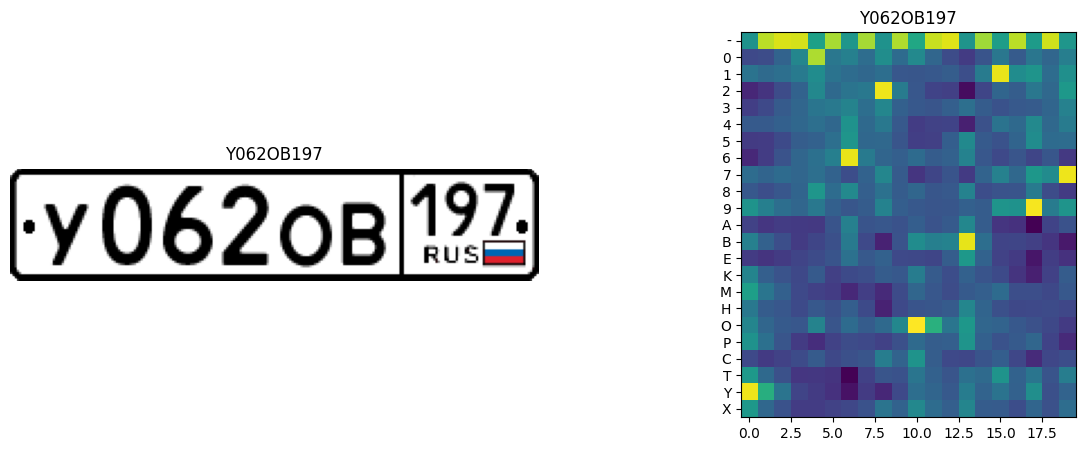

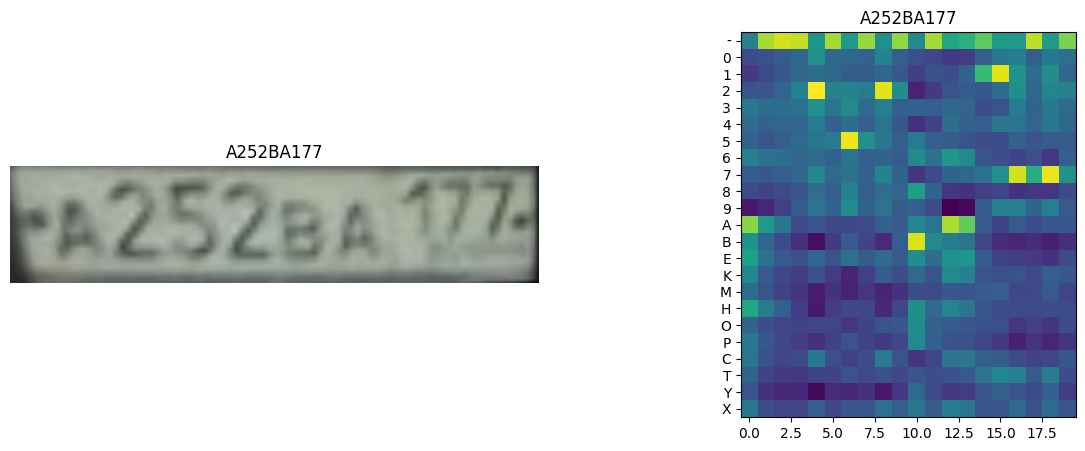

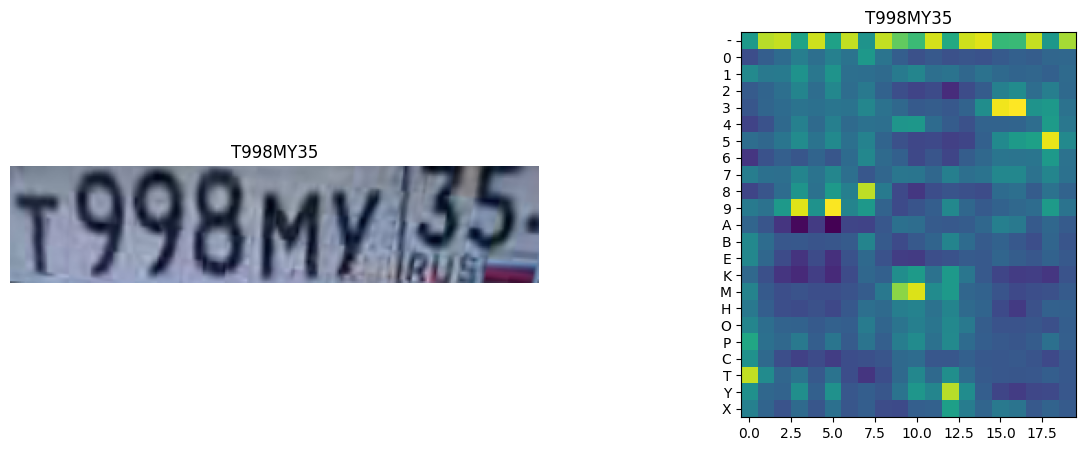

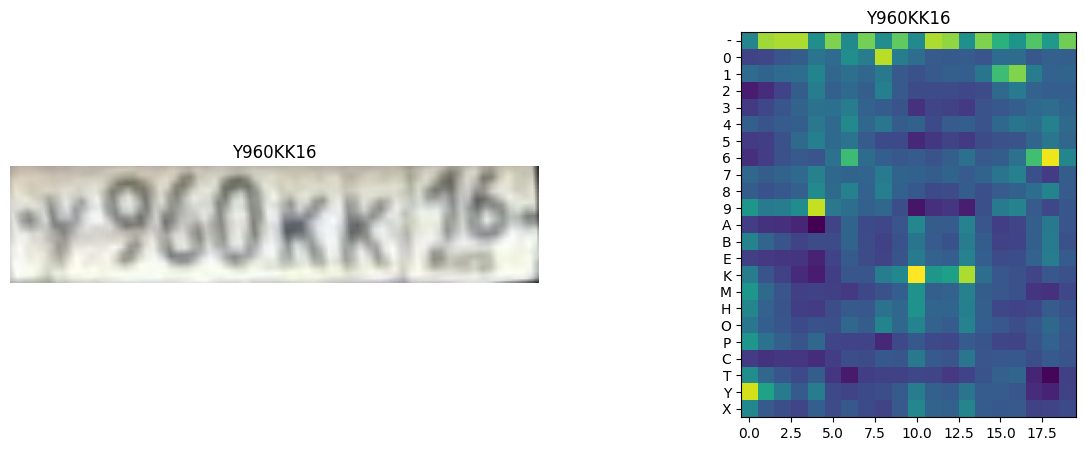

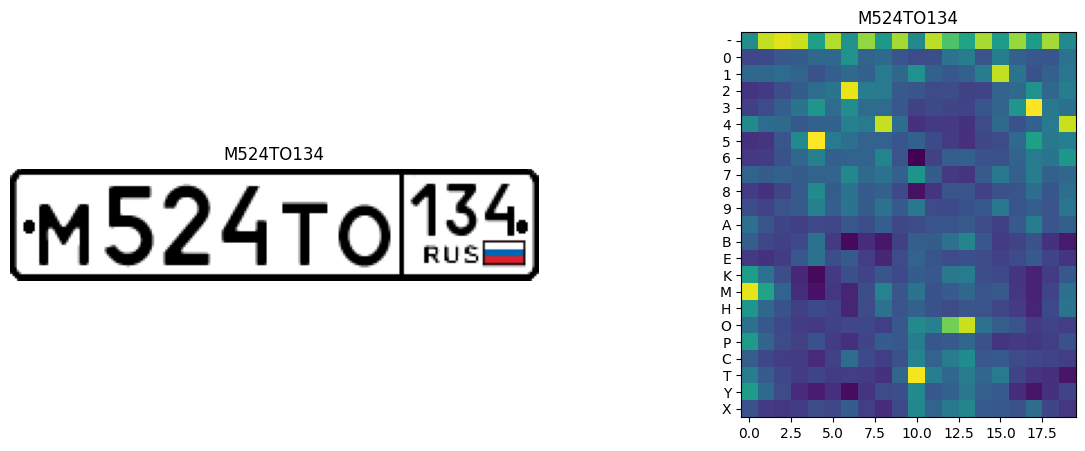

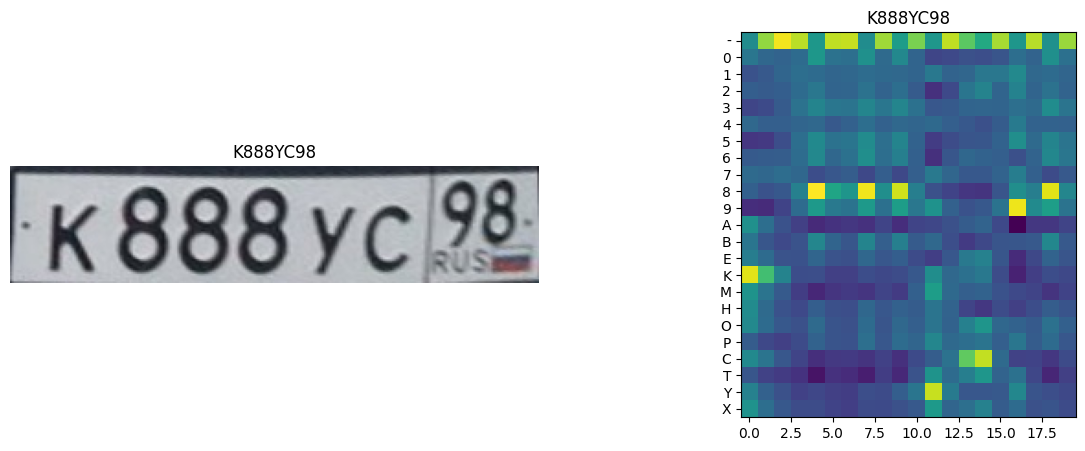

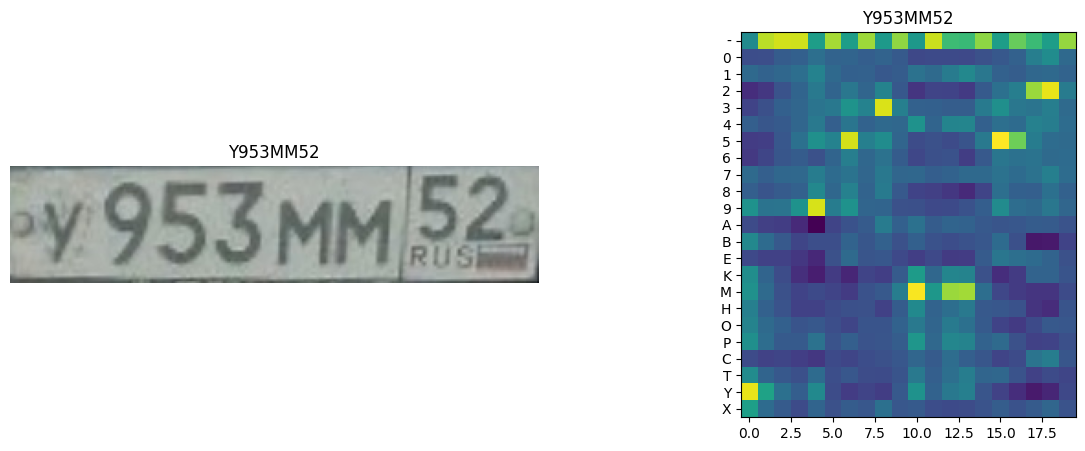

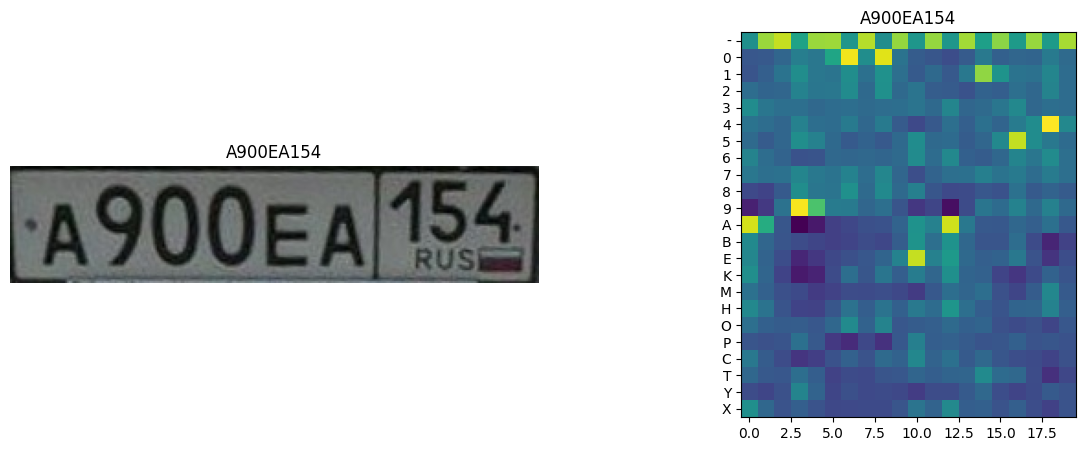

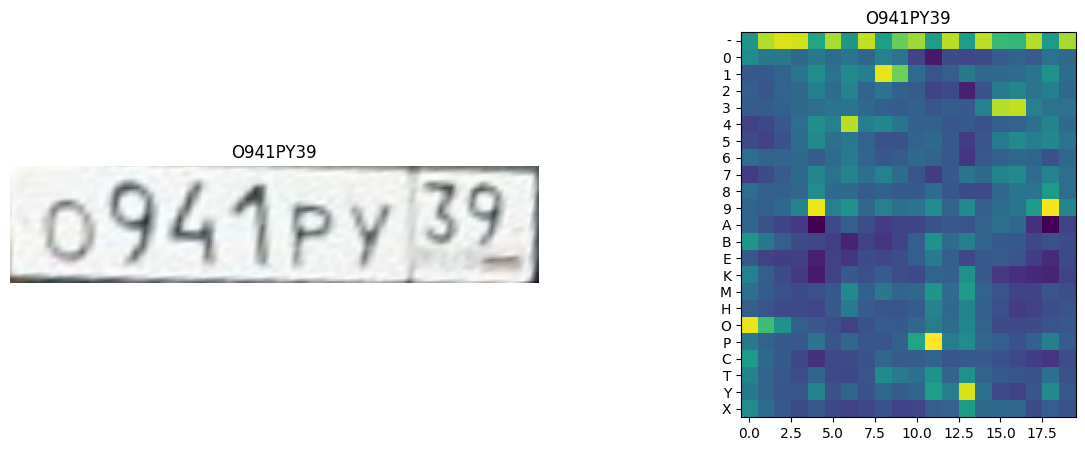

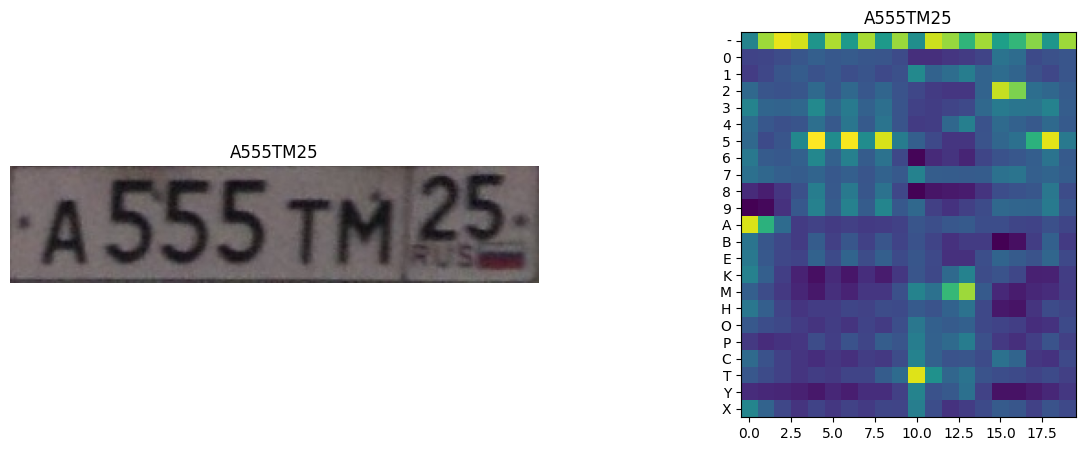

In [46]:

y_ticks = ["-"] + [x for x in abc]

torch_images = b["torch_images"]
pil_images   = b["pil_images"  ]
seqs_gt      = b["seq"         ]
seq_lens_gt  = b["seq_len"     ]
texts        = b["text"        ]

preds = crnn(torch_images.to(device)).cpu().detach()
texts_pred = decode(preds, abc)

for i in range(10):
    plt.figure(figsize=(15, 5))
    pred_i = preds[:, i, :].T
    
    plt.subplot(1, 2, 1)
    #image = images[i].permute(1, 2, 0).numpy()
    pil_image = pil_images[i]
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title(texts[i])
    
    plt.subplot(1, 2, 2)
    plt.yticks(range(pred_i.size(0)), y_ticks)
    plt.imshow(pred_i)
    plt.title(texts_pred[i])
    
    plt.show()


Сохраним веса модели для последующих экспериментов

In [47]:
torch.save(crnn.state_dict(), f'base_model.pth')

### 5. STN (Spatial transformer network)

`Spatial Transformer Networks` (STNs) это класс нейронных сетей, которые могут пространственно преобразовывать карты признаков внутри сети. Эта способность позволяет сети научиться манипулировать входными данными для достижения лучшей производительности в таких задачах, как классификация, локализация и сегментация изображений. Ключевая идея STN заключается в том, чтобы предоставить нейронной сети возможность активно пространственно преобразовывать входные данные или промежуточные карты признаков для повышения устойчивости модели к изменениям входных данных.

Основные компоненты STN

* Localization Network
  * Сеть локализации - это подсеть, которая предсказывает параметры пространственного преобразования (матрицу аффиного преобразования), которое должно быть применено к входному изображению или карте признаков.
  * Она принимает входную карту признаков и выдает параметры преобразования, которые могут быть использованы для выполнения различных преобразований, таких как перенос, поворот, масштабирование или их комбинация.
    
* Grid Generator
  * Генератор сетки использует параметры преобразования, предсказанные сетью локализации, для создания интерполяционной сетки.
  * Эта сетка определяет, где следует выбирать точки из входной карты признаков, чтобы получить преобразованный выходной сигнал.
  * Генератор сетки может выполнять аффинные преобразования, проективные преобразования или другие типы параметрических преобразований.
    
* Sampler
  * Сэмплер использует входную карту признаков и интерполяционную сетку для создания выходной карты признаков.
  * Он использует методы интерполяции, такие как билинейная интерполяция, для вычисления выходного сигнала путем интерполяции значений из входной карты признаков.
    
`Spatial transformer network` повышают гибкость и устойчивость нейронных сетей, позволяя им научиться пространственно преобразовывать входные данные и карты признаков. Эта способность активно манипулировать пространственной структурой данных приводит к улучшению производительности в различных задачах компьютерного зрения и обеспечивает мощный инструмент для работы с пространственной изменчивостью входных данных.

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABgoAAALcCAIAAAC5HXyyAAAABGdBTUEAALGPC/xhBQAAACBjSFJN
AAB6JgAAgIQAAPoAAACA6AAAdTAAAOpgAAA6mAAAF3CculE8AAAABmJLR0QA/wD/AP+gvaeTAACA
AElEQVR42uz9+ZMcyZXnCX7fUzUzP8PjDgCBG3kfPIvdQ3Z190z3iozI/AG7f2TLyq7sJVOzPTvd
XVVdRRbJJJkXEkjcd9yHX2am+t7+oGbuHgEgMyOTmUgA+iGo6eGuboeaubnr1977PhIRRCKRSCQS
iUQikUgkEolEXlf4RW9AJBKJRCKRSCQSiUQikUjkRRLloUgkEolEIpFIJBKJRCKR15ooD0UikUgk
EolEIpFIJBKJvNZEeSgSiUQikUgkEolEIpFI5LUmykORSCQSiUQikUgkEolEIq81UR6KRCKRSCQS
iUQikUgkEnmtifJQJBKJRCKRSCQSiUQikchrTZSHIpFIJBKJRCKRSCQSiURea6I8FIlEIpFIJBKJ
RCKRSCTyWhPloUgkEolEIpFIJBKJRCKR15ooD0UikUgkEolEIpFIJBKJvNZEeSgSiUQikUgkEolE
IpFI5LUmykORSCQSiUQikUgkEolEIq81UR6KRCKRSCQSiUQikUgkEnmtsd/t7TJ5RIBWD6Pk9Kqh
BNLvvphI5LsjSkf+PHbBIUX9DAE6OW/Du46+d/YtMn1F+VjnY+sIyyQFqLoAKgDw8xc+8/GZvoUn
q5hd/pH+JFr3IeXjCyad/VSSQkmq5SuTMkAz+65KqK/YXD07XQLNbqSShp5K0/71BlC9Op0d2Loz
T74UZg4Ejnw/TIaZJqM7e3mZ7uZzjp0cfbXaKlINa3nqQB/vTzOvhf2fGZlJH0QikUgkEolEIq8b
J5aHJr/Rw+wo/LoOL1D4XQ4ADKpnJog/tF8oz5yzPo9qujiZgVdTNQH4+Jx88o6oBkZ+MERJgv4R
/gQk6CwEhNOViUgBGCgoPC0eIBCEWAAQFFCAoQAIwgRWmVzHwtKEIGAFJAhBCCtQApiEw/o1vAgC
CUEABQuqzQnyDAOsClWoIChKlX6hSuwBBU+Wb6DVxohCARY1CFvPBFImhRKF/RdQkG1IAfVQAF7J
ASC1QDq59BIgDIHo9JPLRAAoCCEkR/RfApRF4WUqJxkmJiXoEc0prF1JlOCrzmGMqysGwVSbG8a9
GjWdGXEJncNiFRz2kLQ+yKSkEJbZ/qhkHlKho7oVESDVwkUAhqA+agRDwjiyp6QUhlskDCrYAGFn
SaFRKIpEIpFIJBKJvDacTB5SmkwvmEmmchCm97tDN6olhPrueOQFQSeVb+Qrno1SUOSFwqRgkkk0
iszoljMn59HzdNKDnj6LK0XjSHwcVZJTFUKDyZVNa7kBChBNPyl1+AnXrdZbSKAZhZzCP1UQSJSI
wOFlBdFU8wrbLDjyaQzhPPWGhQsrAYCp94IgCq8AiAkCNWETKi0LMiOrMVdaiwBgMtPhqS7rKpX6
BppEG2k1HJWEFv6msJ3Tlo9ss9Gg2UxuJNShPjPjP/sGAbGZfpk89Tpm96naLpqM90xPqVueDpXW
R/L4YgWqtbBV6eHTuKqoEEUikUgkEolEXgtOHj00nZiBwWFu8MzUgIDAxZ/XL5QTaHOTMIxp6Nck
KuPIkY0yUeQFQEpQQzCTv8PM/4iOcDScTUlBUFJVBWAqoWKaBhUUDQ8wUYiSCxpQkKDqNYHBdShN
UBGkloJoRhYSASdTKTWoDKIEraNuiGkSf8OAQOxUaJGw6QooS/0kHRVJwjqBqWoVYv2ENAQihb1g
Ce+sM62k0oaEAIYBhNUoKeAVIiRMdvLh16nyxQQwOAQuAZAQUDUrs5DozCihjpkK/T15hRCYqQpY
woxmFoSn0HlmaeIJVbQUpnt6pH99LDxL2CgiqqOrQCo8HeMwsOFIqrCTeo/qM0QA5jrDj0Ack8si
kUgkEolEIq8l38Z7KCQ1hDQKrj0vqL6x/Ox3TO+rx/aHbHFybe7IbJSmCTeRyI8AnT2j65SseqY/
OXknnjJ1xhOIqJYhpjlQWqs8CvaAAB6oQ2amskXoH4KCgtSiQAkA7Kd2OwLAQGrdoY5LCptBEzWH
Z7abJtdf1bA9YePF13tpK9+fmQGgSZrVhOl7BTbknQVFpnqZtMqWgzCYwvCEXSMJ1wqBY0oAgHQS
IopKSTFUByIBIvBMmNGQq65SHQauxk1JySs8AIUXENVSVxCXahmPSUMqGRH7ajAqaa3yUZpuzbR/
cG4SJR+SxxjENDVxIp3Nh+X6OhaihODhiYQxXbLUwhMQkvhoGvsVr36RSCQSiUQikdeD72hNPXGl
eUY4yYw4MXHhiO0P3H4LZt02KhOiSXhDyG2Zhhb8YOdpJBI4Eig082Amg0xqfyJfRRYx1yEnkzO5
mvyHU5gQhJ7JkgQwob/OrIgmSVUslU7FVAuxptJEQgrazKYyANZKeAJV8Tj1xqDqHxLOUIU2sUfl
tDwJ25kJ0jlSEKBahwY5TFiNEKAWRJMVoE4r42qZ4QkFxEA8aoXoSMxMNW4EIuVpxFVl04Pw6ux+
mhkPoBnf6En0KNfizcTcGlOj6GqcGeQnOyhhFVWAaqU9zfYnhP6zZkIyY0E9dRmfDJyilJBbBxZU
ChEpm2qTJvri93T6RiKRSCQSiUQiP16+jTx0pIDNsyAVVLYaQspa34ON7Y+8BcJkbCY84ytvnstM
9k0k8n2jdTDPEU2hfhE00YZU4cJ57GHNpKNypd3IjNUPPX09C3JSiAOSI/FKBFJmqqKNQv4Wz+o4
KtBp9a5j4Sc6tWBGcKymmTS3KnF31lYHdRhLeDwtJVaZ73AlBCMoUNBKe5oWX6s6V5ZAQZyq1lGV
SGNDEw+hynQJEw1rakQ9M8b1EE2EoVrowdNfCwYkwQd8MiIAgVXCQB3ZWwVV6cpTU/xZ7zR+6rgT
TSWno4bWtWI4a+YdjMJxVNeuYoXwlCRUO4h/+/M1EolEIpFIJBJ5qTixPDSdrMwWDCahpztWUSem
ymKI7Y++VQp+Q5M78Ip6Kj5jR4KjCmGcPkV+IJSkhAeEKegXNLGnCa8GQ2WF+ODQXIkLRKCqIJZy
nTo2lTYYJAQDSBV3R5Xjlh7NZZtc+QgEMrU8yhpklFkPY572p7AWJTpiykMTAUNntye8xEHHMspV
3E+4mh6p5R6CdCba0DRmJ/j6kEJmtaigDR0LDwJDmEJVNGImnqlgVksoWtcaqDaBzaSS2zSi52gC
am14BIBhJ98UWpuZaThwx12iAIDFMnG42ujsZlRrOX5KsFpU4tdM4I/Wh4+qYROCUPD/Nqba8ypu
iGbEsun2UxSGIpFIJBKJRCKvHSRysrJiWntVINxdpxmR6MiC68wKiRlILxNKHiRQri1adFKNDqii
EmRGHuI4jYr8UHhyDl7hCExgBhOoyqJUxow8VFeGJyBlWAIxyABQrxJKuk+z0SYBOkHk5tp3uaqv
NTHix0T4mKlyVnfGjKJav1a9SwlSp5zxjCZCR3UNnVFVVLUKBapz0kBQ1sqFeuJwVGeMVSJSMISr
CrlDq+w44Umi3CSHK6x2kgpHALEQSa1aBcGJZsqN1RGGVf86zoieodqQBrslBlhndLDJGKlOk+bq
ZQcxi8PSWFE5dU++X+r+db7rsfGeRggdye9jUPB+ouASZaY5fEcPv87IeQSQCgsgpN81/zoSiUQi
kUgkEnlZOOlvX+GqQLGoClShoPDDXBWoHkPDLXHUP7q/nQlO5PuEnv1kNesjVlGFD4a+ICLVY1lm
8bhGfngIFGqQW5iQuSVCRJWYqQowgQ2DPERVjfeJtaLqvSNrQexDCTOeqQgm1VIMkapnYwCoCJjF
q4hYyxLyZRVEQf2YvJeg6r0nIk6MKnnvTWK8F2uMKrx3hhhQEsfMUFVVMgwmFXbOCcEYw0yqVbF7
AuCVWYgq92T1IkaZjKp4L6lhwEAUzk+sxpTBgJYKL5QaAKUvlTVh45xLbaLOEVswe+8Ejq2BKo0c
2wSWQVBGCHEKuXfeiWXW2tWo8HlirRELhRCUICLiYZgtEYJxd+mQWbC64MkNcAnAeO88waaJqHrv
rTFMChUoYBiAhwhTAkZeH46mgSJ3ng1YYUhVlUFgC1WvABEzqAQI4sNXGXlfEpEv8zRtQEpVImuI
eaLgkQd5wJKHOueYYYxxpU85qS5nAmEPUq1T7o5FOUUikUgkEolEIq8qJ7416sqSCMzMzNMEMg0O
D7V9zawbqPoXvY+RZ0DP0nYU7JVAhgGw5WB3Ao8wBa/v/vOsO24k8kNRl5pKUHlCqwqgZECiQkTE
TESkoso2VKxXr+pEJITYEAiGiOAVqkpEpOGhA4RAZVkmSEhZAWsyssRqlKYWOF5FvVNVqFdVVeUg
5DAzGwDMRghqOJTs0qpOvBd4IhUtFao+JLEllHKou+ZDzEpQkkREnDgnJMamSlLAQclqysSJTabR
LmxAUBInPhcRkV7WhBdhVRJHjokVbK2FkIohZijYWoE4AliyTgYBSEstPVhBBkRg71WD+s+MUCst
JQ8BXCgSL6RqiBLmiZt3CDciAcRrCTICbzhlJmJL5DUUbQvpXCq16ZMqVMkrjIfY8LViqrw6JEHW
URFfq3NeCbXxNhkCtLIQV1YYInCSZIBAubp1AQHg4CGckoEiGB+JFTIkEGpQWXqGMVX6HzlyXksR
aZr2iz7rI5FIJBKJRCKRH4gTy0PGMLHWfjUQDbfDAT6+KFaAhPlZjhGRF41X9/STosYjQV2JSVDf
dmeEAtXxSEZeIKRMTlObEZFARQQ8NXueCV8MoUGGSIkh8DBB21SpdAzy4pWJyVe+aUYIqpDEBjMj
lRDSAojCEjsPYiVSkJCdeNpo+AeghBMwlL1XJhuquHvyCqFQB56h8Fpni/kq/c0QjCoFbx1L1cfN
ZkQwHuRQekCMeohDzjCp2kSJXSjnzuBQTpAMDIPHGAkXygyoN94gYRgDgChERYFQiPNhgeQYSiwO
6thLFZDFlqw1TMbAQbwXdiWrh3fwhoPbEgSkYIb1BANOg12SDUKREqmHCiTHOOMkZ3XwIcTLk0/A
FrBEDFJVD1WCQjxA7FXEMTxUQD5khkFSthZEYKgHkVQVy5gNifOONeyRh2dQCiI4CzKwVLnnC0GV
FQrP8EY9lwVy1EFXNkmNCmnCld03KyxMlMEjkUgkEolEIq8RJ7emZlOVRFbySkoMghCZp/w9JZSL
rn7kc3C0ie0P3T7vwNMzDr3W0zsPeMAqlGDAhOnSJpWYYmZZ5AeGlEyICmKI11K9wCmJV6+sIuKd
FxEDA4CJBKVDriQkNrNpy/QAFkICQ8YEi6IxRqXkDmOBE6hRY4yFY4Zt2Q7Dgo0AbIJ/kHMoChk7
KYQdGApJkChI1TZJUmoaa+osJQiJJ+dQjmWUl2MYZRt8gRJGmqCRoMEgIbKAEjy8QylSljL2vvDs
cqtKMMgAMrBNNJWgBNjgnF2q+Fx1bMoxylzLhJyyMCyDHXyKrAmysCZ83hVe1JEXoEAxxiiHQFWZ
auNrSpG00DSwBhw0OM8q8AqMUAQRLWRoeZBFkiFJYb3Tpk2DniK1OZ1DOUI+hikhRaWFKYAmMiO+
abIUBqQUMvagHs4bn+u4ZCrgtYoR8w0YgWkiNVAiFiiBASo1V9IRRt6wAAXEQ5yULTYZbIMsEDy+
WSlEaVlHGKMoqRCUAwwELoFlcBPthKwXMY6VFRxUv5hWFolEIpFIJBJ5jTipPMROnIQsCKpqJ4cb
8iWgVYQJSOr8MkJKFrCTwjex/aHb55A/68kjaSJAcHQR8aTesqkLFUUiL46JSbQFgxx8gTyn8b47
GBWjcT703luyzAxPoi5tGKgm2lhsL2RoGqRUVW9XheQYHxT7e8VuTsOSSmWBg0VqPHfsHFnTQYcg
jKD4iEBHGO3l24flfq6FGF/4POEUJSXSWGmvLjWXUjSMMpFhwMGXyHOMd4qd/vhArBuWfWOMEZNI
o2fnF9vLLdOlkkzSFKjCC1zO+UGxdzg+HMmgr0NvKTVNeDIuWWovn2qsZMptzoILnJJ4lCMMt/OD
3dGucqlasjWqpCW6prvSXp3jjiFjYJgoGHo7lH0cPDl4nMvYowSTEkHEejOfLay2ljvUaqEl6smw
YePhS/idfG8/3yooF5DAiGeryXzWXUx7TUlSBPMmDfcJBLJfHmwePvKJK0RciDD1yCiZzzoLppMY
SpAQmEPlN6BAuZdvbvW3SoMcpRpmZhTSS9tzpjmfzfWoQ2BVE3LeCsih23l8+CgnKUg1JQUX4zz0
X27Oz6HLxCrekCGwg+v78dZo5+BgZ2zHA/TJSDNrNG1nmZdbaLVMm0M8F1Tg6auvoZFIJBKJRCKR
yKvFyeQhJfhgYAEI4IDcY1yo80QMIYhAazfqyqXaxXykF8pzAohMyDR5iiJ3hpFYbmbMCSzAVTqJ
zFYamtgPxbJlkR8QBSAqnnyOfM/tbwy2dvKtgQz6eX9Q9Ef52HtviIkMiYpT9WLVLmTzV8680Vht
tgGjZEBeRNkdjnbvbt2+vXt7O98e08iRkJoGsha11nuncZqSNjeQUeW7LyMMtg43bm3euL/38NAd
lsZRgsQkSW57pofT2mt2W2gYAtQpkUcxcINHg8e3Ht96sPswp6FtExPZwjR9c713Lj2TzrW7SZKI
LwCBUQ9/4Pbv7d2/u3F/a7BBXRTqDRooONXm2+tvzZ/uNKhT+DwlA4aHH2GwOdy+/vjW3a17mhUl
CiJibxKfri+uN7JWL+t5LZkUnIC8Q37g9249ufHp/c+LtMg1VwKDyKNrO2+uXplvt4eFttJMxCVJ
6oGhH28Pdq8+/OLB6FYffTAbzlxJiWTrvdNXVs6vZotdNBikClFS0mGZb+5ufr75yYEcDJ0DW5CV
3M+l3XO9tUtLF1KmzPZCOJKCvPqBG17fvHZr63YBGcODiIhp7M/01tbnVjHnsrbJNFMhNiCwkOy5
nS+3r20PDvbyoSbGJEk+yJeaC0u2c2X1wuWl823uMBkGAeS19EY2xo9ubd7YKXYGOFAjrUa7w+2l
ZPV0+8z5hQuLdtEABGO+icoeiUQikUgkEom8QpwwekiJDAlQCvJSR3kxGJfDwpfO7+wfiJJIVZkn
uFQTGXiOIfovlBPZZ8jSYofJp5bajaTXbrcaJjXVWaJ0TAyKylDkB0UJlKjAFxjv+p3PH33x0fU/
XH/y5Z7bG/pBToVX7zUUc1dWYp8kvtGi1vmls8aY0/Or3bSRmIQgliHwo/Hh/Y07H93+6M7+nV1/
WGhp1Ta5udxY/uDsuwuthZXWvKHEkKqKwpdutLn35Or9a5/c//zJ4MmY8rEfp5RkLjnbXtexLDTm
so5JvG0kTQ8B/MFo//aT27+/9oer968duH2X5QmbLLdLZvGD0x+0tdFZb86nvcSkSuRQDLT/5GDj
6v1rf7nxyZ2tW2MeOfjUtKzLFrJF8rLaXeBMlpIOIAoZ+sOd8fbtxzc/uvbnT+58OrKHJXIiwyU1
qPnO6XfYGzqNi50LZACIwDsZ9cf7T7Yffnnvi8+3vxibgogMiAssN5ZGb/QbnLy19IbAaVWAEuNR
sXd4eP/Jvf/j+v93R3bJ2DRpuyGMS9469ebo8sGv3/4bh26CFCBmhvoyz3cP9/7x4394Ujzpjwtj
U6XED91yc+md028s/E13Lml0bMvCirAwl6UflKN/+eJ3f77355E6pxCAhHUob65d/I+/+LeLzY5i
KYSsMtgrhPzV+5/99up/v7v1ZONwT7M0TbL8MF9uLPzyyk+6WfPU3EoraxFZgFmJiO7t3/3L7T//
6cuPtvKNIQ5LFCRkiuS9tQ/eOf1ucjlpLDdbpolSVNUYY813OF8jkUgkEolEIpGXiqk8NDP5PyYo
sFb2rfBACeSC0UgHw+FolOdlUXpVRa/TVlUReOikyD2RIW9jUtKL5DnRQ5OJ35G+8EaduGJYSFHY
vJBOu9nMbGbQzoyBMoUYIplIfk9pRpHIXweqy8dr5YMPJRmVIyQKwBir6vvD/v7+7qE7bC21siTl
xKiq9x5eGSZBirFtSKPT7LSbnUbaIJBzzigrq4cHwDAZZ+2swyZR1nzkMqRN22okjWbaTCgjhHLy
Xi1ZmzaSRiNptNJm13cbnNnmEglxn7rNuW6r2213mpwZNuN8zJkhUKPRaDc7nVZ3rtMjz7ZNhpCM
bEfa7UanmbXTNLPWihcwEVFCNrVJljUbaaOZdua6c4XLLTWoMG3TbCXNZtbIksxBDVQAY9JGozXX
7M5lnW7SbjRtyTkpI0eqzVba6jQ73U5PIU49q3hyRCY1acaJVTvfWsiTImEDL0rSTttzzc783AKR
UcDBW1UhstY2TJZStthZVg/iJLOtXBxys9CZP7W65pxzEAGYmcGGQMpayvL8aj7ImfI0aRBsIeVy
Z3FtaVVKDeZ0gGVmhjHkWbG8tDq320udF6gqpCQSXZ5bklygzEgYVkMKm0JUer2FdqvbyQa516TZ
ajbbQxotNnpGjOEkTRtUfcdJqHbX63Ub7WYjy7rcadnUqRv1R3lRjvpDV5TMbKwhECXMABN7KNen
YrjQaVAfCQKu8qtJKVjsAVATb4dEIpFIJBKJRF5SrNbB8xJq50AIEpIpQKTQ0jmPFJY8kCuUsNnH
xuPdweGuimskyVyn0W0157odY8hay1yV8wnEm68vF650h4P+xl5/92CwsZ83muVctz3XtKdSk4FS
kCHPIEFwcKEYQxT5Lkil0dCRHB5l50SdJg0LQek8WwJ7JTWJ9XAEaqIxx70lXjrXOK/Wnz6z3uw0
m80mABFwEKiV1WnDNpfai6d6p7Rkn5jEWu/VGEPKvebKO+c+7M0tbQ+3xpoLCZExwp2ke2pudam1
wkgUiVclkwjEaLrSWfv5+Z+fWThzWPQLzQGo0wY1VzrL55bON7TjYUitTUzwR2py+3R77VcXf35l
9eLQjzw7EjIFN6l5Zu7M8twZpkapJrFGoQQ2KHvJ/BvLlxeS7t74wKEgVnUWJTpZ98zS6SaaGTKF
DtWrKnPaM0vneqTnzZnOqTIpxHgSgqOMG8vd5bOd9SbSoKqUJAAlaLTN3Ln5S3/7drpRbFEKQ+wL
bxzPNXtnl9Y7Ot8yXQe2jaxUTzCdRqdoFT+79LNWNyu5IDIkJE4tpcvdxbVsebm7AtgSRCEFWdAw
ycXVCz799/vlQZ7nKoCQgek2O/PN3tnFc510TsAlYEAETQx1k+a7q+8td1cGg5GE+vVCGTcatnH5
9MX5Rk9gHJiYRJwKJcYuJqu/efvf767t56UXqEjQ+9K1+dXV7qI64xIlGIaCSkKZKr19+kqXs7zM
k0Yi8Lvbe3vbe8vdldWFtWbWMIDAexSWDMAOPkEKBxayFhCQlUJyMomvCuTBgJg8MARA1Iq3QyKR
SCQSiUQiLynkRVFVGVMAPJGHSAB4gQMrpwKMBP0cO330h3kxHhpIu8HtLGlntpFwMzVsNGHDRAr4
UGYaVLlVPwXHn9A/CPKc3LJnjj8BRVGMSn+Y60Ghg5ILp15K8uXpxdZ8O5lv2RRKCOcHiSKJ0UOR
74BqKC0/KyMzKUDkxqVNEwU8eWIqUSrUwHiUBJQoN/tb9x7dORgdkKVWp502kixNVUhEGIaIAFZX
GpO0klanMdfLeg00GeS9psY6uLHPB3l/b7w3KgeOHAzghSjEE3XnG/NN27IwKsQAGCXcyA33xnuD
/DCX3MMbkCpZtc2kvdBcaGedjFOCgQgYAs0x3i/2D0f7IzcqpYRlUqCE9bab9ZbnlttJm5RDRq6Q
dyhGftgvDvqj/tiNHLwxxsLAUcJJpzHXa/UapmlgFSoQQBU6dqODQf9gdOCSwsOzJ3hKKGk3OvPt
XitpG1iABCIQAA7l4fBwf7g/kEO1YBh1wp4y05xvz3WaHQtrOTVgB2GwAuNyvD/c3yt2ShRQNswk
RIp2szPX7qQmTZEyjAa5BFyUxWHR3/f7Qz/0rtJ6SJEljXajmSVZM22GZDQDMjBe/dCPDmTvID/M
84IUBka9GEozm7QanVbWaNpWsAlnGIU6uD2/tz/eHY1yVSWYULcusdaSnWt1u41ugiS4CLFqjsKR
23Lb+/v73vskSYhoOByOB6MsabRardWFtW7SBUBgi0SBvvYTaqon621GRsUlmQLiwB42OBMxQCgY
A0AJHWjyoj9VkUgkEolEIpHIt2EiDwVtCCF6KOQMiYoXUpMqkAN7fez1h4+29pltM0sXeu2Frm1m
sIBREGAIDGhIA4GG+kAmenu+VHiBJ5RAoRiW2Otjb29vONhvWSwvdNcWOq1GYkGhwJmqRnko8q2p
EhUJQnXED9gohcJ5zuUmgYf03QhMDtTgZgNG1AuC0ZkfY+zgFRB4hmGQQAEYmCA5MVRBBpwgMUgt
LINUyDC0qixWehQOThBM9RXgBNbAMBIDY5ShHAQGgTo4j6JE6eABZRDABmxgCNaqtTAEJgAEDwn9
HVzo76EcXgUSpBkaFol6BUCsQqIQDy8oHcSjLFGGhWu1FstgVk4oUahUsXsqEIE6lB7OwwFEsAmM
RcpgBhE4fFJFhaiqH1AgLzAWCIOp3guGYRg4SWxCMEFOIjCAHHmJcqLTMZigBjapVCFLUFW1xGHw
x5IXXBRw4YgAAMTAZkgcvEViQCJiQIYTALnmnmSMsYc3MAYWEIKxYFFKyFoYgBgIy/eQAvkII4Uy
mGE8PFfDhRSJAYfQJFKGqlPnjR+jcHBhF6iWzBjM4AwZgcN7CTh0/UMzBLEHzaGbgoz6BlnSkERm
hSiMDuCBnCGEDHrSeqCRSCQSiUQikciPgmM/ZCehJiSAwpAJDhQYDGRv72D3cJAQNxvJfK+1MGfb
CQxgACUwQCrVZEU1xN3T87WhKCn8MJx0/JkhQAIYQpIhISRoD1Pa393aPxgYovleu9NMw3lDFJPL
It8NYZDAwEMElkBEIIFh8TQuUeYoHg82QdZwa7GTJMpGGcRBaDBIBFLC18I0K9SACUSVBYwwGJU+
wtWVKbyiIAqyESeodBkCmUrfYQJDicFUhdqRVMJTamC1jsQ50h9EyggaBsJ/mZBaJKG/g6/7E8NY
mEpSsaxKUHioARvKLLwi8RCFhOrvDBsUDQBSKhEZY4hUIAQyVT1BW/9pOGhhoXykEjEzkyEWiEIA
JLCMplQjxqFlACJEiUECoLqoM4VlGrCFmchDqNKIyYIJIGURCRXHAGScAkwogvjCoQBiJcRYBjHY
w5MiDFqChOBTJEBikHAlS1F1VoAZUKW6KiaYiMENpAxWECPsGplqdQAIqtDqkBuCACnSDBkgChKI
RVWIM+hiHp4VRFwW5c7B7h/uf3QoQ7LJB2++d6a5MkctgTdq4BRKbEAMDygZQiYQEzPLIpFIJBKJ
RCIvLZU8NPuTNkT9OBUmK4AHDkeys39wcDjI8/zUymqr1Zzrmpat1B9RWFTTI4UKQMRaCxP6HCcG
jkFFPwj6HPnmmeMvIXwihH4xMsCksL2kaPXg/WAw2Ng9FLIwaSNBQkhf9N5FXn4ICgHCpQaAkeBo
Jc4W+9jcyneuPbxpqNUyy7Js2t3ThhJD8FIqq4ERQF1pbCrwBCaYEKhCIFVVcUTEbFmhSiFPKqTS
KsBKSkGkIBFlYWOMqoqqJQ1iClBLoKGUOmBAQka1cixWVRAYagwTCAT1CiIFSCqdXIigSmBDZMgw
DEGDSERKlgkKUhCYRVQZEJBR8sZYgYTMqYQMw4QLqoGGoQPAZBQi6pwCXEVOmSD3KJNWUZ0I2gmR
YRaoiGhIEgO4krGIleq8vCpDmJWJKISDQshYAhKFGhDAKkJVNhkREYRIieprCwkZZqWEKv3IKERV
WWEoLJZNGFsBAAazkSBL1RofVMmAGCaYURvmyvFMQSBLTJwEeYhAEI8gGxEF+Y5A9a0KMBkjSswE
QhV7JdXWegGDiFjYwBjiUeEHg8GNBzevbX05krzsFO7yO5dwNkPTKCA2HAGa3ANRQxQipKJiHolE
IpFIJBJ5KbFAXZFlpmCZgBXsAQWGDvuHw8P+UBWdZnN+rtlumIYFA94DqtaQpenbSZWqyc4kYS3y
MhHCN1iUmUIuh0mwtLRYqh4MhnuD3KaZNJNOGqadMYAo8h1QgI3CT64+rAjWQgAOcXBt8/P/30f/
mFH34uJ7Xepd6K5XkSNiRTwZJMRsiEAkxDCGjYFRBSQ4p1sCkagSQKQKVUGlfyhRFfJjFKI2RB55
EVWPiTYEaCjQpxo+DQCZEHwDABAVFU9BtyAAEBIVUgJR+AyxVagmAl/FwdTvDGJsldMGENiQVSgr
VFTIgMUFfYQtq8Fkv5iggFdlJaoyPK2yKhGRgVEleNJpHBNAIIGykigRmDmhOgoQDBH1AECVeFKp
xVyNEAAYItYQX8gAVJXUUCDsAlUjW+8OUkqMUuhPRKQmjCcECN8Tk68IBUGtGgbXdRWDFIQgPEHB
mFHrNGx3CGKqFsIUIpdIVb0oKfNE4FMFkeVERAAoCYMtRFU9NAFDwMxQQIOkRkmSLC7N+d3y7uat
zx98wplvrCdNnE7Dgah2GSAIYKlKj4xEIpFIJBKJRF5SbJhXTOxjNDgPgZTggVLQH7r+IHcerVar
N9ftNEzDwgAKWMAYMhRihqDwqlrfTg0zMWV+tjfNMwurR/7qED07SuvZ408sxARYFoJjJYFatZ64
00ZPlhySYT7a2e8b6jRs6jnKf5HvBoUgmCogxIBYIIRciz4d3h7d/eTxZx/f+/N69/KZzpXE2BDJ
AoCImCxILcgSV3GLygYEhfogSKD2+ak/BqTBqYeCWlFpmwQNyVEEwDBDuYq4IaDypiEAzEEX4OnG
h/5CGmJ5glDOKiKEWjep97Dy35GgjagGZ+5aV0EV01fpR6RkiEFCKhNhBT6kZ0119yB2gBUMZiYN
6g6TqIYFyjSSE/VeS9BKKi0OECI1GsI+RevMvCpEp16ZMjOkVkQAJubpknUyINOVhYGFqQzyJ9qR
IIR2UdB4ELQbgFi9TJeqVVoZNPSXykYp9AeBwcoaloRwLMKrIAWDQmQUVKECAsgEQUpViZmIUd3G
UMOsqkzMTN57gGxqut326eXVle25qw+La/evD8fD5fbSqfmlnu3AaWWbBdE646+6JRLjYiORSCQS
iUQiLycT7yEJpcrCk+GRB0YlBqOyKB0RdVrtpQWbhmJVCPlHwgSoOueSpDKhJqqmWRwmes+RgZ4n
W0R+GJ49/kSKykaKoUDJYAsSZiH0OhiXneEo74+KbkdF4QQmFCuKRL4ddWRKqJmYCJNW15HH5dYn
dz+/vvGlS/TMxTMXzqyvLCwyRMCsIAMoVNSpV9XUJkRKQaMJF7OZEBiFVFE2rEqitVISsotUFR4c
tJupZZpWbyQRkpAIFjxqVIWEoJUSAUBJRTwpgRWsSkpcxRyJQFVDZFMlHEilFTFXUZZB8iGQqpAy
lKrIFAcYZtLKAjt80Gy9awwQGWIRCX5DFEKThAAlIuJ6OaIioqrGGDBpiBQSkDEQIOSgTfKkRMQ7
NglYSVVJVUVCVBIZhUJIVYiUrQ0j4L0zxoTYpPA9olAiAoyKIIQmqSe2YKiSiLPWKrwq05H+LCIM
G65OQbiqBpyCdoWqpKZ3RMRIqlAfhaonMkG9EvHMDBKFIRJAPTwRMRtU90IIGq6ABCJWkbrEYxUL
RWKtbVHz/ctv7/ntW9t3hy6//+TB5sH2YD4fStHiFKIwXlk9lJDE0KFIJBKJRCKRyMuO1VAIJswM
VCd3Ph0AoD9wO/v7luxcp91spBkFbUgJZKqaLQJoYhnhBm59a1cJgI/OxS8pxBoyXwBv2FiCA6BY
6PFw0N7ZfnJwYJsJU8OmaR2WMaM3xdCwyDdBCaJQ0uBQliqRAAK2GKPcHu5/dvvG/a0nK2dOLS4u
fvjWuwtJO+SHSVBSiIhQWwvXASRBQzD1OiiE0DCRKrsQZKQQECuUyZMhFjuJLqojgABg0r/2qVFG
WKmtg5Kq/sFU6NjyASg8WWKZ6Q/AhMgkCeXGQlquhweYgyzCDKWpsT+FzDahSsKq4nS0ElYkBEpN
N5yr2pGV7BakKMNKEtQuAGSqgKAQQUPTy7SEKCTAqxHMXL8VSnDMto7LCiqbgJgt6eQGQ9WiepUt
oMxVflkYGcOskKCM6dH+JrHTowhUyXdUtxpcqsA2CHglYCsXoqqzAEwGCiEOVyIBzfRXOxlYDa9X
JwwDIvDh5PHwTNxOGgkWz3bW/vYnv/7f//APO/u7d+4+eNDcXFpZbqUEIWFxEA12bZKSgni66fGS
GIlEIpFIJBJ5uZipXKYTK4XqlnMhGOXOeW02k0ajkZqqSj3Xdp40Y1d0DNLJdC3yMjFNFiOZTHQM
1IAyAxCylK0xRelHY5cZ7qbm260oEgkZrFKllSl5DQWhVDDKxzu7+zt7/dKbhe7i6sJyL+ukMICI
8RzMm4+WRgw+0SGECJimN4VwESWpY4lqVQWQUN+KZOqAA/qe+wMkCihV2pACVeGsEBhFk0LyIbpF
ZnZQAJByJQzVL00+qAJlEtKJZVJYde3Vc7x/WF2d/Fsvc3LpDsLJ7CVeQEwykywcXhSdrKVaxYxC
cmwB36g/z3R+uv9RnaUakyPLnw4aheHVeqF0tD/PbBjVj+pRouAvZc7PnysyfH795tbDg63HO9tL
O/utfqfdNuzLapXC4HrLp5unqjFINhKJRCKRSCTyElHJQxPzBqoDiDyQFxiOc+ckSZJ2yzYTAGAo
Taq9hPfO/gCeKVNG8Xbpy0q4nz5rKyQGJiMYoNNIRs2Gqg7zvNNK40GOfGsEwXEYBBhliIcC3ir7
siz7B0M/psVs5dKpN6+svbFo5lO1oRi5UFWxHEAtVQdxCJM5/+SyNCOmPPNs1YluEsJtvuf+E5lm
tvMRC6/JtRhVGllY/ozuQEF7wuxy9PjyZxZYjbYee/LYEGFqxBSEoSPRQ7Ubtjyt+wsque7pfWd6
xtPP7x+irI4rSqFaXF2E8ci4aZUd98w9xmRZVYxW/d+Z2C+dOTQiOPI8AVaTlWypsOb9M+8nRfPt
8++tLZ4yiXUQD1JM1Cwh8nXK3+yxjxfISCQSiUQikchLg9VpGoLWRg+qRF6QO5RlqarW2kaKBDB1
MWXCtK3QaFL8CiATT1qAJyEPpCBCAhDQyUzZ6/YHo7FTQQwdinwnqgpV02uJgL2nshjnxiWnmmda
vezS/OXlxooAZe5sFtKrZOI2rdCjanUV3jJRMXSqOBCgdNxOPehKgqrmvXyf/SexPFVVRzmubFAV
glL9V2bDoyY7iCMKCh35z3NG+Kg2NNnOyZt4ovvMakP1S+E9z17DJGIHx78Zvnt/mek/C09lmZlX
Z8edKjlpunyt9lrrtYNDsFedmxdG5NiKWEwqzXnLv7j08zfPvHP2zLnVbKmJFFWMLQetiUOKnz69
IZFIJBKJRCKRyEuDDe4Rps4k0kn0kEA8VIhgDCEJhXsBVFOa2enL8WAT0tnJS1QQXiSKE92+Fsak
ElI1wQ6TbQuvMAo0LbTTHOflYDAu/fPTCyORr4MRaiASB58WE6bpHgZzre6VtUs2Sdqd7MLquZV0
2cKyMQBql+jnzsKV5PlrfPpyNE1ikqfiUP76/YFZKYQnzTPeIIyZXkc/yOY54svRz/t0HPhI/9lr
9bNHkcG14jXZ1GM5X9VyuHqSn9PiJP0n3eRof9S+4KjNzLnOTNMZYYkniXIUTLI1JOux1GsJDkcT
aYy0KgI33U2ajZliT2psY4Hb76w1x+U4saapZCkkVhvAMthATWXWd/RYzIQOxSyzSCQSiUQikciP
n6n3kMKHO9zh57ivZ/5MZJiZwAoSaFWaedKy1HfCI68EwoDAVvWjACatC5k5FcqYKSP10h+MCyfx
yEe+CwYAlGEIAhYlKKmSLLUWsmZ6Ye18YpMWsgyJgTUJSR00NHPaMSDPMzubCedg0iAHHMmG1aoE
mcgP1L+6WgZdZrZ/FbxDIfFqklQ12VH/TDFl1pA7RMnMqGPP6q+1kfU0Ha/qXI9hiKmho+IUk1Kd
4Pb0p55JWSksYbbFt+r/9JYLVbFaRyKCGPB10CvXQjaFE0q5Vr4YAFPwLwfB1wFrIGUNxRoBEM0q
ZcFgWkiFjQCk3DO9OWqLy0l8mphgu12/JcRWFs/a00okivJQJBKJRCKRSOTHj33e/F6rciwKiCUy
BAZUPcB6JCsBQUeop0mT395AjCx5CaHamFymQQ4hAEwBYUVCiRpyvhjlpYA1FqeLfFtIQaFWFJEC
QiQkHh6AAi1pdrkDYVYQUanOESWc8KRS12QxSnX0R1UGK3DEN0eZJgXjp28lgkFVdvFIXMz33D9s
t5n2ry2iiUhYZ0NvagFoGjUD8FRt0KPtUZkjbNtMC5pkEs8uHKHOe9B/qribmbdTNeBKtWp0/Esj
LLbahWlrcOQb4Wv7H9vs6f6GXXtGOhoRTSObZhZSS00ho4yqdFkWCIEnsVS1ojcdjHC86pBYKaEA
SakZKLUpjAXlweraqNGZYawqdzJN43Cj91AkEolEIpFI5KXC8uSWswYDEBIWDbWiRZwQqVUm4mAJ
q3SsXNAM/Gy7iW8SYHI8YeH75GtFq2+3AX/dOJoXHpVThQ4BqM1SFAATG+akOmF8krzQbYy8/ITJ
uUJ8FdDCBqzwYfpv1WhJzJYSKJnakWeiAgRDYRAYpNPwkzqxiEgYz5YznoJDzM733/9ITtNzxoS4
StA9aqdzvH2GMvtUFNWztKFnr3Ri7H1MG5pqLlTdDOCjb5xKLU+3s2bh37j/kf2dBDo9rSih0o2O
y4XHh0Unm05Mle5WHwKdiEdHN7JyHC9QNNBoJAnlwBhQQUIghSGQJ7VBNBMFwQJCkKCxVVl+SpV0
KDS7W8I6sxnVjn+TNhKJRCKRSOSEEE3rk1doVascqEqghB8/k99p8f7W64utEhoIBIZaASlcqA0E
gJApvIIFKBmkYmBq+4wKmn1w5FwKMw0F/Mwzs++oT8rZoj9qvk9lRL7Cl+ToVuEZE9EZ6rv3Ut0f
prCn+A7q0uzSJ0s7Np4n5oQTCq78hqBc3Q1Xo0IhLYMYZAEUCkucpcaXDrBPT1qeOeOKRJ6Cgsu0
I0cgq4aUoQSWUkdsqCgKhjWwUIgimA7NlvACpnY+mPyB2vpZMWsUXRW9P3q6hsl8iJphOuLF8/30
n27nc/pXbwr5UM+LP9GjF2A6urrnodPL2ZGMtulgzo7hkXfRU92+Yo3PKF3wHfp/xQ4dv84oHX+H
Ur38KjzqiPIFppkyZQrUCXREBEPQFErImQjWQgG2VfVO74BcWcWkJRLAsmdD7JF75KWUBE44BbFR
y2TgZhIADYRF4AAksCGILHx7fm0bFaJIJBKJRCInghQoJ2HX4anwc4aYgy1jiNJWncSnx/SQ1xgL
KNfaxEyaWP2M8qTQjgJgPeG0nyv15xvVNfvBQmaeTlGYnf88czP0q5SWIDlVTqnfeRf+ukv79ggD
dGQ+Ut/yBsIsj2L+YOQ7o1SpraRcFbqHllQQSFNDUrstMxnib/xd9eygnq++fj3t0/wC+3/jK63i
5KrBSa/jJ/yJoCd8y0n7f+3effXy+Vn9n7ENDKRIFB5Qp/lIMC5Kp/lcI2snBioEYnjAKISZmVCo
IwIxAzLGuHAOORrcaqdd1DfuQqahVomQlR7/DdtoYRSJRCKRSOTE8PQ2VW12CUAEHtO7ZERQ1SP3
HSOvIc9PcKh/h6rW8TG1weeJqcL4j71Xj3aoChd9//t71NLiSHvsX0Dqf3r039Ed/PY6jkwlFxLQ
U2FE02ck2jlFXjWmaVL1VYbgUDj2Q4wH6I945A18uBDF+xiRHxBSNkgYSQm3p/277tGnh9euHt7e
tvmB5M4TJCNtGrUk8KUb52OFcWAP7qPYzne3iq09s3eYHuTJ0KWFpl4TD1My1AAGLBBP4gnfpK1D
X4O/eWxjG9vYxja2sY3tN2hJXFKUaVGmZZmUznpnS+FS2AEeEECoMmSs/kVeZ6hUYQjBk5JqIkDJ
zgF7OQ76+uBBrs5fvjB3eokSgFEatSdcxUxtn6/v9k16fidqj9jnlV4+tg3yrE8IYyqfyTT5owqS
Oun2z2zA8xLfjmhP3/f4hJJJrKoMEClrvZFkFFwCY8XnNzYebR++deXcpeU0gwJHkmT0W0QnRF5L
Qj2skkoAqaRQiPoBHz5yD7ZHO75wc3bhjYV3U6SqqqqWOZ5akR+G4MbtURYmv9N/dHX/9hf3bqrS
v//F376TnZvTzGgKgWd4doB3cCV83w/2BruPtx9v7j5hxtrq6kpv9Wz7bILEwpqQIVnHrEqo3feN
maRna2xjG9vYxja2sY3tN2g9pMRYq7+YAAolX+sQiUklVqjVOrvsRf8Ki7wwnqv1aB01pNWj4Gl1
4nNFjwQcPS1/TLxCql/J9EOcjlyV4JkW4jnGUyE8R3ap3tLju/pthZuvtUOadHiRuWaRyPeBItTK
qr2YS/VDKj6+99mXj68V4/L84sXl3uoyrxqyUFAsBRX54SAIjEkEo61848vtL35/+4++1EsXz7x9
eh0ACsCrS0vHpcMwR3GI/EH/yb0Hd2/cvrGx+Whlccl2svneoocy1EAJRFJFmxKB6WSJge6pmxux
jW1sYxvb2MY2tl/ZTn48a/1c0IYmtVxDy+DaPzb+3H6N+fpQoGmWGb5jmV6ZaQOT8/ZFMMm8PB6N
MNlOBuRpFagWa0521/e5Y/L1VtlHVx1m05HIqwJVH0BWARmU5Ic0urN797P7n46HuXNu4H6zmC4Z
sApgTjKZjkS+IyWU4SDjot8vdnYHj4qx9zQcYK8jZJIUKSnLIQ6eDO4+6j++vf/k9pP7m0+ebG/u
kMPS2vLC4uJSewUIXtcG3kxVfhXQN7g9UBPqhr7wm5CxjW1sYxvb2Mb2JWp1+hAAKQggUqqquFY/
SyTMLxVOAP7rzHMjLyXPlYeIiJmYWVmZmb79KuToA515yQNhwfzDlu2VZwUNPb2ds7/a9Tn9eab9
1mg9DuGvmaWRPLdbJPLyI/DVR0gBQAkOkqM41MPNYrt0+YEclJyXyDMkXjTKQ5EfEgcAKnAqRcNo
MxHNx61MEoxhxgDn8E+wfad/7+qDv1zbvPaHe5883H4sI523vUtLl9bW11YWV5toMxIjKYsNF3GB
AiLwdKJUSa0+JpFIJBKJRCLfEAMoGYGZuk4rQ5iEpzUviAFRiIcCUBKKOSuvK18lDxGhlodA30mZ
OCYMPR1AFFbJR3p9X0j9b1bZmY1smmxBJbLW7Yv4Ya58svCiSORlIkTPMQO+dgVzUAc/KIZDP/Jw
nkrP3sMDYo2tKypEIt87SjApxBBB1HsLSoFBOS59XzDexcb+3vDB4fbt8cPbh3e/fPz5l9s3trG9
KTutRufU0srq+ZW1C2stNEcYt2BKLoXEgIREoYJSIAaEunjs17YAKMaORiKRSCQSORkkYJ1WoGYm
D4aCLWbm5UpK6uHDL/PIa4slUPgX/iYCgQhVwTKtnYc0qCOqJ1SJhKBOnKpawwQSiKoSVWsMCyaA
QAoREUMntb4+2fYAIuoNGUC9eCLDxF7EsBFVESEGExNUoaLCsARTP09evPc+SRKdakmTTxDVz5wA
55y1hkAKFR+Ctgyq8fcAmEz44Iaj8SOZGlMssBz5a8DECgmlwL0Ls1/2kCTLVFVEjDGW7bSuWSTy
w6GlCkESUDdtG2fIcZqmfT98hMdFWdzvb3xy7/pHjz+9uXNnc/i47/d80xdGmlnSPdO++N75+bnO
AIcligKFgWWCghTeQxSi8HX07DfyDkDUhiKRSCQSiZwQBjOSFI0Bhgzj4AlsCl7OVr2nzFp4wAOG
CEYhHH9wv958VfTQrNIRooeY+aQxNAohUmZDYIWKQBXMR2+CkgIgqGGCfr9uRASoeg8wTeKGmJm9
eGayxgIqEFFPREyW1BAZAOI9WRCRtTaoOfUS5bs4RltrKUg/QkQgMiKiqswmjEP4M8QQRVEm8qoi
NI3QY5gENqWURQ1MqPcExPTKyA+KEkxCHgIQSuiQXM67B+O/3Phid39ve2/73uajW7sP7o6f7Lm9
MfcdlaKAYuRGj7Ye/OHT3290HnfQSco01QYpEZGSgtUTPDwAA4NvbB8wIUiqsY1tbGMb29jGNrZf
25KiHJZZlo2KPGmkRNxt9hbTxStrV873zhp0jLF1sjszDIPjD+7Xma+qXAZMo4dQKUQnPlcITJSE
qDaBiDIzE7HzQTYKcToiEEAMzPd/OoZS9Bqy51RJiVTBbOu9k5CYGXabYKBgNt6rd2IsH9GGvjMU
ajYpM3PQg1RJVVQwMUgikirZDy8mxS0S+X5gQEnVEyYlCy040yRxtqGNUjhzDSlhkwSAqKcY7hr5
4RAPL3AGtpnO9ToraysXd8Td3ty+tfnowfaD+3sPdrVfZF5NAXYkQAGrYOL+wcGt8Y0t+yhDZjkp
RjkRSSXxsxJUwj0SOlH9EeEfxQ/N2MY2trGNbWxj+7K0LGixsYYG5YgMu1IWOgsXFy+N7bjXmzMw
bWqzYUbIVzHEL8hTJfLj4KvkIRH13qv3IiLg2vn8BCiBwApVJRGoGigpoAxXEjPDwnDIMvMKUahF
+j3vMquqMRzct0VUfBXQ5LyKCJHaxBAxoN6rc56rTwyrKsEAECmPunV/64gnFvEgTLUhCdVsWKTO
+mMmqhyaVDWmF0ReKZQnNvBKAmUmZMg66JxunXZULiQLSWmRMMBKP5bkyshrgvMljKSwK3Orl06/
VWaJne8d+IOH27f7o3zkvVpCYgBm4cRYsLJnI7Yc+37Rz2VsYRhkDIEJtTxEYgFSMYITeVPD8wsv
jhvb2MY2trGNbWxfppZU9vORTSjXEgnt9w/3ysVGu3lR9kYYlGh7NBgAGAoO4QlRHXqN+V6NfgCw
qCpM8CxiqgLlxSFLSHTy05gBYvC3iE46KQpltgQGWIUJMAYqpAomAplJUh0TyEAB70AGTOx88E3S
v26SF5MFGIB3QagCM7T+WIoHGw0r9N4bw9/3EEUiPyQ6MYFnJUUC09D0ysrlhknc2J1buNDhrlXr
SdnEr6vID4plSyAD303nzi2cS+e6rbn5R4ePFrPeQmthbm9ho9zc9Xv9sWfnTEpO1XnAJr320vmF
c4uNXgILL2WZgwlQBgPMao03HgQycpIvEw6RvAql2MY2trGNbWxjG9uvb0ECKpFowW4ko2t3bxQu
H+XDUTkQOIEHBCAok4JeWD2myI+Frylsb4xRRUh8+nbJZdDKsMh7iAAKIoiAE4gDCMTBD7syYP6+
oWB8BBZh7zWxBEWeI6guE8dsAKpQhWEUHtaCGAQjosawSvAjmv3sVPrsSbdHRJgZgHNCYGuhivFY
iShJwIyQAUdEQNUzEnk1IAUAUajxGm5WECVkW2i8f+G986fPydh1bG++sZAg8fAKCib2kcgPAhtK
AEA0lWSpsdCmuV577vL4/Ojsuw9271998sWXmzeu79x+XNwr5UBKN6QCYJNkp1bP/s3b//q9s+8s
pQsWxruCQYAQEaslZVZWhbA50QaZH+JLMhKJRCKRyCsEiVPvbdnX4cODxyz/+8OHj6lEOS4ZJkQg
AKauU+6Bk/04ibxifI01dXBLnpje6ImNqYkIRYn9vfHGk52d7YErYUxqTarw1lJvvrl6qtebN8xG
4b//eR8rhCghkIRwIeDwQB89erK/f1jkjpkXl+bX1lY6HS5LDAbjJ482iqJYXVtaW1sIP+9nPjJP
i0En3oNZjydrIYIH97du3ry5tLS0tLywtLSYJNNIImbWODeOvDoQAIh6o9XkWQ0TpZSu2OVFO48W
J0hTpFAIhMnE5LLID4mCDUCOGmoblJXwPUqluUpNt9Nav9Q5c3354uX9G7e3bm5s3Xk0fuTNdj/P
S++K3NkiW8TqZVyaQ0etJ8Ag+NmRViUvWeFf9C5GIpFIJBJ5xbFIPXwfo4WF29eSL8e+mENvjuea
SBMYAkE9iGGg4gQS8mxe9FZHXgxfY009/TMYhIicKD6GAC/o98d37tz705+uffHZg739MrHtZrMJ
Hc0vJm++efonP3uz3TrTaBiABAISKOozcrZUvIBkqr+oqX5s08w2kgMUGvQbrt5VPa4C5cQpWwDg
umrf3t7BzdsPfvfPHx/sj40x77z7xv/w65+ev7A4HOrGRv9/+9/+2Rjz3vtvpEm7O5emGQAYk0iV
D6OAgEJ9YoFaKB3Zf/hQdAzK1WbMbLMCxmYa7HlJSm/2dkd/+tONf/yH33744fuXr/jEZvMLbSJ4
r0RQ9VSJU/aoDctx0ah+cbL71Z9VhOFkY6r3Tm5JvwIXgtnb65Os28gPxzOCWiuOZ0Mrhf8hJM0o
E6lCkcKWyhk3CWzVhohXrxAj6ctxQ+N52d8n7R9GSUjjmfxi8KqGCDBgQBmlY0EjteSRYLG50Fhb
XLvirtzZufXlzatXt6/63U/hdvyB29Pdx+2H2+3ts+vrCWcESoSNMBMpCcI1X/WktWOVfhQuBrGN
bWxjG9vYxvYlakWUjbbBrbxJY+NzVackapEyLJREQ0UkCZU0Xopf25Hvia/3Hgols6oiKycubK/W
UCtLl5ZXF5dGB/39u/cObt248867Vzqd8YUr6xcununNJYY9QUXFEJwvmC3IqhigykRzfmysGBIv
w6Io2o1e6SixXVfCJCFtTdIMgrHCMzXzwjXSdlGMQd4YA58SERsCvLU8Gg2bzaYTscaWHo12YzjU
0WDu9/98p93uMg7OrG+99c7igwejzz67/8nnW7tb+83m6TOnxp1uaiwKVxpOvMB7KJOxMFQQBGIJ
hpRAGI/BjLQBr6VqDoCpAckIIEJZIknhPQajvHTcbCZeB0lq8mFxcOivXx3+w395OOwvsJnvze8s
rbYBlCWYWbQkOFERlyWcWoYIXCE2ISIVdWyMiIgatgzIcDyw1hIZFWOMUZSGBCqGMtX6g08ASgCv
xKVAwtRr9pln5SLxX2VlsxZUEzlVJJTGAzMz8+RPIprkBuqrGwOmJAJwmMTWLaq8VAVUEQ6QIIir
ZIy1JchDDBTirSgRNU1bvLBYQ5BSuMHMiQICPdFpWp8PPPvU9DEdyw9FcBerXkSoYch4/iHTML0n
nSyhVmCf1QKkDJDO9AemfXT65LQVCNNM5yMbzsd2Ql/28Krn2Lopjo7YdBz+Op/l52+ODstx2ySA
hfcKYywzWzjJbGOB0wytZtqb7y2fO3fh3YUP39h7987Wnf29vWJU3Lt768u55dMry7ZBS1gxnFlN
WAgEJRESqoS/k2yPgii2sY1tbGMb29jG9hktREON7WMtG3JwBGmm2RhF0ShzM3ZUFFoQGaYUrIBH
NeN/BaaEkW/PV8lDVVF7EREgBKh8q2ltmvH8fG9pea3RfDQajh89LubmBv/23106d/bC+vrphQWb
JCasDWTYIJS6B5F49goiMkkzz0dpoolpaqKAWJsAsAlEYS28Zyfeq/PeWc4MN4tcjE2MIYBV2ZXq
vVf11qaA9Z5cKdWdWJN05hby/NHDh0NgvLC0ctDPRzkeb2zfuv3wo4++GAxGly6dO3d+efV0I2ul
UB6OfZIYZYDghB2E1KWUMGvh1JqQkxcGkRRKRCpQESZ2ClWIonTY38NgVJ46nZi0Wbhib//w4aPh
jRsbf/7T7XZrfu3U/Jnz5oo/nRprmIgAkxVSMNmyVE/SSBiKtMEgjIdjJz7Lml64cJKA2VCSNgAG
mJgVYLaEMmTxHD1E4c9X5lowCdASADPRW3/t1cxKCfUDY8zk1YmxVKD6ICEkCb6yChGeVjgA84zn
JEhGk9RJApiVABCLr0eXQKzOi7cQwH5L93qZKkQUrMWoenBkk/FXcJ0neW77zJNwts+ztKFJy3hK
6nrl0Dr96kVvyJQ0Cd+SIgDBlHAEsQBEDXGDGvNozDXnz62fvezf+Fny84/vf/zJF3++euOLve3d
J48eH1zaO904rVCCYaWJDTsgQjBEJ1aIMFUuYxvb2MY2trGNbWynbfhNQUdaJXFQhRgwAcLijPPs
PAsrmFjAM9kkDFA0p36d+ZroIRFRkVDYnuvT7ER4740x3S5WV1d6C3PK98syd8612+3FxeXl5W6r
BYSZNhgAI62K3KsIZVSfpI2s6UqIQVlALCBiGdaC2QnUifGesqxnDZOACE5BDIWIqgqIyVhLZKFo
NDIAxCkpxEOIW+3u/OJC1myUhZrEGmOyDGfWznz4Ie/tqvPFv/7VOxcvrXe7KRPYGmMxzkE2aEBE
OmcYlgG4JB0QTNZsht1nypyAiYmtqLIBAa7E/jbu3Nr/0x+/eLK584tffXDlrYXTZ9vzi83E4t/+
j829/fLDDy59+PPTZ862jGEBnEI9AKRpV4AkgWUoQZwzxArfaDXzQqxlUqiGQSPiNAQkGEAUBBti
NyZTclIAMhNxwE/fn38JOXqePmP2NbuP32myPVF5iqIAQDWo1dVw/jMzzfCix+d75Wn79GOihh4Z
f/EgZiYCW5AhAauS86wOXsApmI0h7xnmpJk4qL4rpV7v7AvHvvm0/g/NPKX0tWukp74+v3K2r/TU
lijj+VE/s8si/YplvlJ8o5H/YbZEvcAb4kE+GGlRaDkuil6jtZA0rZrqngYxgzM2GS/ugd9aeWu5
tfT2uXcePnzQzJpJmY4GedpOLCq5Ewwl8eQRrtKv+AUhEolEIpHID8Srffs58sPwfRe2B5GKgA2y
jBvNNElMmqadTgdAkmRJAii8R5g+Awj3+VUFMIbhPQYDDAdoZDg4RKOFtNFpMIyFamXEIGq88KCP
waEAGI80s5RmSFIkmVXVYgxXQrwWZZk712q2nKDRQKcDUYCQJIkxJkmSxNp2q5MkGYBOx6yvr//y
l0bgr7y5srCUksHuHvLcOfFKZNPUMJyDeiQG7QayBsF68b4Y0+DQAxbM3mujkQAwKXU6cIpRqQ8f
Hf7lzw/+8e+/3NreI+oS+16vnSYg4NKl0//T//Q/nr+4dP5CY35hBCAvYBj5GEWJwcgniXGF6/Vs
lsELW/BoXGYGGxtjQy0FjEHSwCj3IF8WSGza64ANbBPOMxtRTIJeZo/VKxCVwJNT6AfWubIsQy0J
zWpA3vugDU16Tvq86LH6caBKJIzEVyoHC4oC5QD5fnFIXtqcLWULxMwghj1hdqvMnOJy9AyX5zz+
MUKv33f9j0QhYhgQBDKS4ePB1sbBVlG6ty+92eHMqGUyRlFABCVBAd/DXCNrrGdn31h849Hqo8Fg
0E17tjC2nZhQEyTc7uBQGFMV+u1iciORSCQSiUSO8Ux5SI/c/YxEvoavqlxGBCJSVPc3CSCiE8aa
CTO8inPsPXyNqs+yLEkSNtVvZABeoQ6GmRmGWMnkOXZ3cffW4b37O4N+0e8fLCw1r7x5av3M3OKy
NRYiAGwxRn8f169t37/3MM9L77g311o7Nb+43Dx/sWst3bs3un/vyeHe3sGgP8rHnbkeIbny5hsX
L3U6XbAB2yQv3HCUk3oASZKUJW7d3P7Lx7e2tgtiyRpFkp7Oksa9u3sff/zpzu5u0kps0rCm7QuG
8NJi680ry+cuLLY6ve2Nvfv3N+7c3ihyNZyNhqVNkzfevLiw0jp91h4Oh1sb+7/93Ze/+8cnn3z8
aDDMs8btcXGYNRqNhm5tHj6+h9u3H8L2k2Yv62Wd+aYS8gJ374weP9m/eeNB6cQavXTlzMULK4tL
WZJiODBf3H706Sd3h/2E0VxeXlxYmdvevTvMD4vcdTpzly9eOrXWPLMOFUsGgFRBDKSYmrMwlELW
w4s+Lb8LPNMCz46tmOwgf5eJ9+wlmIhUp+mYqGWgJElCDFHwHgrdRGSSg/aK8SzHdA7jAwCYNZ4H
QQAlsAFUCCAlLdUPdHj78O69rQflaLjUWvjV5Z+naBppEHBSVe1o929yYlO96RraqrbUN1rvV8UB
1eNzssg10ml7dFUTMf0I+tKHEk33SOtA6fqvHxpSGCIH9Sh3893rG9c/uXXVe5lf6y2m7ZRSA2uJ
U3iBACXUptRooVUgz5Bwi/KkyEyzbZoGddE9hkI9ROu0QfMq6PKRSCQSiUQikVeBr4kemsxpv+Oc
Q4M5K0QhCvHiiFTEOZ8aA+Iq2iOsRsEAO48HDwZ//vOdzz5+8OTJQZZ2B4NB6Qa3bp2+dGX15798
8/KbDQGkwOefb928fvDpn77c3Nzsdrsiyqxnzy6ePjvX6fwkTfnjP9/87LMvSeHhtvcPivL24UHx
y1+ORuP3Lr/V63agqtZaa604EgGUXYmtrb0vrt588HBoM7u80p6fn2vYxq1bj/7lXz4tve/25g8O
h3s75eDQWU6uXDmdpe+tnVksd3Djxu4Xn9/78tp9pixrdB/e3x6Myls3++/95EKSravBaOyvXr/z
5z/dv3d34JzMz+/OLcje7nBuzm5v7d26tf+njz4r3EWbnTl94RJAB3u4c+fgX/7p40eP9vuH5cFB
31rcuf34zbfO/+Jv3iVk49zev7f/+9/fuH9zMM7pyhvn33j7/Ob27b397Y0n22na+OCDnZ//4q35
hdU0Qz2zrBzMXvQZ+H0wUYi+du/ku8dMBZGoKIpJElkQgCbiUXgwsSI6Fkz0ukPVEWAFFMpaUjGU
wRePrl29d3XUPzy/dOat85eWrLHITn6o+ISywo9uol7Lba9LgMmxwLoXbkWkHl5dacfbw807u3f/
cvvjsnQ//flPr8yfd1ADhhCTAcHAMJGOASXD3MyazbTh0yCAWoNp3FtIMAwGaTG5LBKJRCKRyF+L
Z/6oUMC/mjO+yPfC1xe2nzVL+ZYJjcrGVLYsxhhjyBhy6go3KssWG2Gi8DMZwTZZmAkHu/j4T/f+
1//PP927s9lszf+H//DT/mD4hz989Lt//vLatXtpOnfh0gUFtjbwX//LJ7//7ZdPHuyeWV959/0r
gNvYenA4POCNYm9/2Gp2NjYO+kN/6cLZztzc/N7BXz6+/sc/Xh0ObV6qbfz8jTebAvIga1PnZTTK
B4OBKtKklSad69dvgOmtN873ugeWs/3D3It9660PL1/+4J9/+/HVT/68udFfXmifP2tVU1XcuzO8
dePgyeMRUevc+YvdueX9vRsbm4/+1//3H/cOyrmFxsU3ly5ebq2snkobB525hjH07gfvf/iz1QuX
LzHlT54c7uw+/Oijz9lqs0Nvf3Bmfh6ff7bx3//7J3/83afGtt5/7yet1ljUf3H1i2vX7nuf6a/e
XljiRnNtPE7u3TvY3h4kaefcxUvMnSzTB/fvbG/f29nKofrWm6vLK8hSVvhKIZq2EBDoxzc/PiGz
0+mqRCPq/TvKt1OGgvqDGdEnPJ+mKQDvfZ7nw+GwKIow0e10OmmaZlk2MSTy3gNgftlH+jnjc+QK
QQjm7FNmre+gBCVhmImbnhIJSW6Ke/sPrm/dGPT3KdGRGQmEiUhPLJOo0vHIn9nadsd9gqYXOwIk
xA09B4FM7f9m/YOeE78jVCsERz2qq3hfPdKzGqzJB5S+SiR6xaQjVU90JLbuqcP+w312jKEUqce4
oLKw+TjLh27sUldCHSRxSsJgJRM2HMZaABbNohgjYUtcC0GKqS+14FsZ+UUikUgkEolEIt8rXyUP
HdOC9Nv8omVVYYYC4lGWpXOFwgNiLRtLxoKNQLz3KsQWFpDcqTqzt4svvtj8l99dy/Py/Q9X18+d
yp3/458+v3HzrrtWXLry9q/+9YW8wOMHo7/8+dYnH99WL5ffOvvOexda7eTOXd7ZfgDKQS5toj3X
PX0ab7/35vzCwrjEg4fjzY1/VnnQ6rTefOfCxSvrbA0AZXKiZVkC3Gqh0+mmWUd942B/sLvnBsMy
SRura4tnz63/9Ke/WOhl//DfOrdu7vUP9k+vrZxaX1taXWq30Wy3Wq320tLS6qns/fffbzT4y+vb
g8H9e/d2F689unC1O7fcWD/Xnp9fMLYJUlB+/sLp996/fPYsDvazRqNFSHd3hlsbo93tIh8mxRj3
7x3+6Q83r37++Pz585cun01SKnL54x//+Nmn11fXzp1ZP7WwtNDu9IxNi1IOB4PSF3O91vzSGe/0
oz/e2d3b/PL6o/Wza9s75dxcgg5ExBypl/SdjvHLi4D/WileW1tbeZ7v7+8/efJkc3Pz8PAwxAqt
rKwsLy+vr68vLi42Go0QjvfKVy775syWK1cApAo4yEF5uFvs9/P9A3dYUukg+u0tmHlmJYDy8dN+
2uc5G/kcryg5YbW/k/avmKS7vfrUuuGPxpzLl/DWl1TkLpdEkqaFI2+gwbaOiBhJ5ZkuIJVxwVkK
AilDxBijUCKjotCQqg0ABGKY8CBeCiKRSCQSiXx/6GvoYRn5DjxXHmJmoio+Ivx8/VbeQ1CPYDDE
TI1Gw1rrfemlBHlVJwSFd1oYQwzjxKsiS5sPH+P61Z1b1w/3tuX0udWzF86sne0c9l1vfj5Juvfv
3X9wf3jnjozz/Qf3Du7d3xmMx7/65U/+9a/ff+v9DpHvrazcu9e3Nu0tZZ0Ofv6LD/KiXFlLevPI
C3R7y6KNvEgODp0gKRxyVxLbQX+UmVa300vTVBWGk9WVM43s2vb2SLxZXTnT7pqFxfXeQpcpG46w
u1uoT0+fXl87Pff2u+urp9omwfwKfvWbN7Y2h2ySM2d4fxfvvHvpwYPd69fuj0fl7u7+cDgE2oUT
r7YsfHeZllay9XNpq43hGK1Ot3TspWGT+fn5i0SL/T4+v/rwwYPDvX330+XlD392elwMSNvLK3Pj
UXn33ub1L29feGOBLboLze58Nrix3ZmjU2c6Fy6tj0f44x/v3ry+tbe7vbczGo88kEDBMBACSTWr
eaV4XoSFEZXgI8PEVMdjPG8W+rw5m3MuBME555IkKctSVUej0c7Ozq1bt27evPlf/+t/PTg42NnZ
2d/f7/V6y8vLv/zlL//Nv/k3V65cuXLlSng7ZibAx1yrX/To/TU44j6kszurkPAVRSCFiojhpFAP
MmxYHATiAQ9PDStGndG028rFMVsFudKb5Nk6ThDjJg5QqKvIhcp9RFCwiKj6Y2NOREwctlQVhhCs
o6YV6BDqU8GrD4ZsXnx4V+lKYxMRCZN8gVpjQSgKR9Z6L2nCAEpXVislscyiCgoJU9O4ISKoTuKG
piZWpNXWiggRGUNEJCIkxFwl5NW5V+K8GLJ4/lk92eWZ46PPfH6Wk/b5Jus65uA+6c7VieFpJvSP
QE97KlZHGd/vhygcCEMmSRIiKsvSOWetFSiBiBkeKlACE4GVGxwM3WxGCiNQJlJVrvaMAJAy/yi0
r0gkEolEIq87BkYglhkgFWG2/rsvNPIy89XRQzOA9Fv98mZjADiHPHdFUYTMGoToCSZrwWA2CUEB
BoORqSLPMRjy3q7v90Emneu1Oj3Y1M71usxpPuJhn7Y3h1s7j298ub23N+52Fk6tn1pZ7XV7SDPT
XezOL10a9IskJVU0mhiXePBo4/Z9try8u7tP2iBt5WMajzyAZrOZZVnaaGihw/Eoz/Mw3SiKYjAY
5c4TDLHvdGluzth04e7t/A+/271+7fbBwcEbb7/1k59deeOtteVVEEOhZMimyd5ufzhMnzw5vPdg
bzQa7R0c5PkSWIk9AOcLKBtjyYxMMlbCcITx2BuTtFpzjawLyaBN8WY8RP/AD/pOXJbYrLeAls+k
RLvdLr15+GD71u2HO9s/TVL23nn4tGU73aQzl/Tm0ZmDsRmbpiAtC83zssgbqtCX38D2pCiUiAhW
4UWgcCHBh83JZmoh9gf1Z0FEBoPBjRs3rl+//rvf/W57e/vw8LDdbnc6nX6/PxgMNjY2/vCHPxwe
Hv7mN79ZXV1tNpv6dGDeq8vkPBuNRiZha20YOk9qQMRGoJOgCgKAIOHxeDAuSyUxUPZeHXsFbGqe
N3QTR6dJ9l+1AVq3NPukr8OFvAi5SnkxIeHv2BICpS+NMVwHGYkIGMzsvLfGhKRMFRUVAhORYQSB
Q6HM07PMq1A4eeoK9+GzGNzMZSLXkhATMdQrGyaQAUMrrSiokwDApKqiwswEWGNnQ6y+Wpp5xsF6
1vPHhmIivZ34TDi6nGNLqF/VkNDHzFQNUJ3jPCMP6ewSvudPkk2IyHokBoYck+dErM/LKg332NoJ
wr4+02ZNyKU22ap3p1aISF/NJNNIJBKJRCKRyMvIieQhrWc1J8YYWGutTa1NFey9L8vSe+8ckIov
S2stoGWhaQKXYzhA/zAf9Avv2JoUwGjsRCjLTK/Xm+sskCT9/nhr82B3Zzjo+8w2E9tMksQY2AQ2
41ajtziXsLEuh3jcvvXwy5sf7ewdZOmpq5/e6feHvbk1FesdBbkkTC+9IM+LsswBeO8HgwEzbAKT
OKVhs91rd6DAw4f3/9t/+8P9+w/IjNfPzV28Mp82hzZtk0Ga0cZGefPLzU8/+bIoir2d0ebj/Msb
m0QMEoInlKpgeEss4otyUBYHvhwabiWGWSEeKmxNizT1DvkYg2E+GktRelWyFmDOSxhOGO3RAONc
swZ7wTgvxuNCBCDxPle0rIVJMjIp1DgRV4oqiEDEkzSOF30G/tV5dt6Qc84YQ8QEG0pp4Vtllk1C
OZhZRPb39+/cufOf//N//ru/+7urV6+ur6//8pe//PDDD8+fP2+tffjw4X/6T//pzp07N27cAPDh
hx9euHDBWvusuIlXBoVO6mpVc2QlzZppJahBws5LSM8BCcAhmIsUgAEY1Em6LW4TSZM7CWUEDv2/
+rhMHutM1JKffYENQQHyKkxMMAAUJEGWEBh+tnIxjSSCUjBLA5iIJHQ4IppMytIpULgcJIApyoJB
mU11uoVaby2UQURclUvzquK9qGpqM4GESCsSFYIlNmzYkqoQiImUOMQWTUb9a8+u56lsx52hv1m3
rz8nnlrO5O1HHdzVizc2aEMq4bOsJCqGjwQTAUcMiabhaX9t4dWL9+yFPJeUFmkHXWNSjCgB21Co
fmafgu45W7APqIrz0TOqJUZhKBKJRCKRSCTy48J+bY/JVPbblY/xToxlqpN5VFWVRJBmrSxt2QSM
DGwNGe9RFvnuVn8wtFs7RVGWYGo0GmnaKgtqt+xoFN7ui2I8GBwWRZGmqWHLNktsy5o2U4MAwyBk
zGxS3Lk9/uTjR3/6/Z1r12+lbbd+du3cuXMP7g5aWWs8zg/2+3leEsEYFhESttY0m81muxU2XlU5
YUg5zg/H+aHIqdGI9vdw9fMbf/roL85lZ8+v/OwXb73/weUkHQyHJTT5058e/vM/Xbt3c39zY++t
t944vbausv/48TjLmlB2zpVlKYo0oTQh8bkBFUXhnEtTNBoEwDlXBxSIc3AOk6QYAPkYNmVXQryx
pknaUGHvw4yE1afijIohMswhY0UF6lXq5JSjB7dKdxD5BjW5X3ZEhOoojirc41stJ0xBrbX9fv/a
tWu///3v/+7v/i7P8/fee+/Xv/71v/t3/+7cuXOdTkdVe73eb37zm7//+7///e9//8UXX9y+fXtx
cXFxcfHV1YaAcBZp5T+tNE0C8uTLsiTDli2BBCoqhhLV2k8cYlQNcUNsw2WNInV5luRJqlmCFEAh
RUrJ8w7K1FV6Ij0QnKiSkELgVZxXz6RKUC9gspSQMaSsBIhxAIPpqBgUFmXZAii1VFXLNvilkaJh
MwKc8wCMTSfbI4CIM4bZIKSOOT/OsqaHWDIht0wVIa+tjoPR4MvGIBAZQwoa+6ETYcAYw5ZVyJEA
rFDU+XQECmKlUpVoNltY4GsO1lPRQF8hCeGorHNMkvuKdz1zOc/KWSNjKiMfTL5xjoWDQfF1wlCQ
+7/h9nw1zCyEFMlSa/nC0oXR+TIv3Zm5MylSrm2ElAAmKBSslYhZB6KFhVSWQ6LEpKGtTPSjHUAk
EolEIpFI5MfDc+WhIApV/yeiiffQCaH656+IigiUrE0T2yxyuNL6EjCAGFEcDrC1Odp4crCzMyzG
ttluNZoo3cg7ZMlcOQY8CCiLoSsPrSlbDSpybrWzZrNpteFLm4+SYgxmEDjLUBa4c2vrn//xk3/8
r9cePtr84OdvvvvOmV/9zbuP7h1m6V/Gg+Gozy4vyjFG/YEryvF4nHAjSRJjjBJK8UmSeO+LYjwa
76mWzLSz5W5cP7h9c3tv93B5uX323NLZ80srq9jZ0c0nfUjrX/7p5v/t//pPj+8NrMnefPMX5y++
LfLgVvsJizVIE2pYZPBg+MSWhEKF4VOXcz5EWYKISL0rR15yMs4mMBagUlESe2OSQR+9OYiH+IQp
azSazWbTezin0JTQ8mVDfGK4YRlOIOJUPSDKxNaYBAC898Gj5JVzopajrsPTKWJiEwVEQ3FHAFAF
ibKhk8pEImKM8d4/fPjwt7/97T/8wz98+umn58+f/4//8T/+h//wH37xi1/0ej0REZFWq7WxsXH/
/v2PPvpoe3v72rVr58+fX1xcfNGj9D2iJMcehJwpJ86JB4GYpM4hMsQKYmWqJtqOVRrglqYt31xJ
Vnrt3lKy3HANkzCDlZ/rfRZiHKdadq3vMKtAmQCQgy9drmXpIZZZhErN2aaNpEEwIZZMVCbyhNLU
xsiJM2yYmIk9/MHgIM/zVtYqx0W307HWTnQH58QYVpUQI1WWxbDoe1+ORsPTq6e8kDFMlWpW5ZKF
RyIiWgIqRkRd6YqyLClJyrIkmIZpWIQMySDoelExXmEqLy3LBoB8A/njmZLNV1/bn6mqzL7rG8ou
x0QczN5+CFFUkLwsvPfW2sRmwaHJsJnodJOoqwA9J+LprxVGpCQikrBdbq28scqddD535dnumQzW
KAOigA+FN6vcMYMqGo4nqYgKX+eaCVMIkouhQ5FIJBKJRCKRHx3fUB7CVB464a9uYgVAjCyjVqvV
bncTm6oyU0ZohNuuzIBi2MfG49GjRwdbW3vLy8unzy70FtLhaL9/OHZlMh7CJlDVMh8SF0tLzdOn
Fzjp7x068OjR/Z3bN9befmuZpdtKUDgQ4B2Gh/ngIB+PwOjOdU7PddYWF9Gdy5rNNLXZ/Fyv2+02
mrAJJ0lirWW1TDZMsoyhZrOZJlmr1cqypNlsZgb3t/1fPnqw8SBPqHXhwoVf/at3188s52Ncv3Z/
PMxXli6OxnZ/t7C2s7DYu3zl4tvvsOrqrVsLxlKWtjvtpWZjLuyytSVT6UsYmktshwmNDPPz3Xa7
6TFiUxrr0kxbHWp30qzBiiLPR40UTMjHGI/HgJ9faJ85uzA3j4N9zbKskXUT2yJYVfUepQcxjAUn
hpkmk0dmrnIgqmn5K8azC7BV/r0CQTV7s3zy87mOZXj8+PEnn3zy29/+9pNPPjHGnDt37te//vWb
b77Z6/VCeTIAaZpaa9M0JaLDw8MbN2785Cc/eeedd15h76EwV59oQx4KgkAFagxzJUrCi2dmBC0X
RgHAkwpIE7JNavzyjZ+ePXVBvax0FhayeQiUxcIA8hVT6yOJYKqirtCyPzrc3d3d3nmytbW5u7d9
eLg/Ho9VNcuy+fnFleW1tbVTy8ur3c5CI8msGsBM7KWm8pBzJjUMHhWj+4/u/+Uvf9ne3l6cn7+0
funNN95YXFgGICrOOShbywwWcgAePrr/5a1rm5sb43z40w9++u5bH3JC1nLwniZDChJRQJjBsHk5
3N3devT44cOH97f3dvcOD0Z5aYjarc7c3Nz83MLpU6dWV06dXj2dchrsjiur7KAtH40b+oowoqej
gb6i27Hj+/RCgp/300yieJ7pYXRMYBKRxxuPDw/3vffz8/PLy6tZkoWBPXbQp/v1nKvX127PNzqZ
SZw69V6UuqYjbdtOeqV3PdNtaMogqFcKIVs2lCcjAsEQwEoTP20Bg6p4OqkyL4WUX8FLbyQSiUQi
kUjkZeZrksuIjsS+nzy/TIihiuEQBwfD8XjsvS9LPxqWRe77h/nG42btSYq7d7avXr27s9M3lq68
2Tp7vnnuwuKps0uG0/t3tw/3kRe6/WRXtZyfb6ystNfXG935U5wmp89mW4+2792/8dlnrZ/eOLO+
DpBkDR7nMhgM8jwv8tJwurq8vn7mXKeFuW620OsWRSNJEhUHQZZYY0ySJHDsnCuKQgSqWpYlxCS2
4b0fDoudLdy5cfjbv7/x6F7hXbq0uPz2W29kGR7ck0/+fN8XaP708vbW3uFod23x/NJK1lt2jTkk
zYNGu2CWonDjPspxYhlzne7iQqfdaXjvd7fzJ48Olpbn2KDInWjRSI0rDwf9jeF45/T60ptvnn14
b2M4GB8e7u/u4uGD8uGjJ4f9rd6CvfTG0rmLvaQBOyqJc2ZNUkOEcT4YjlIYGo0OnStEXVGM+4OD
4bCNJWZmvLKu9DqjIAjAVdF0rTI9nPOjvASQpilnJ5ksTlagOh6Pr169+i//8i+fffbZzs7OO++8
8zd/8zfvvfde0Ia89yHCKM9zEQl/lmX55MmTg4ODZzofvzIoQUM4BSDTPCBVlcPhsCzLJDFpI+Np
7SZihUIZQioQAqiN9GfnfjKEYzDUdakD8ThSpes4TzlSq/feq0eiO/ubn1397Msvv9jYfHxwsDcY
9PM8L8uy0WjMzfVWV09dOH/pjTfeeuPK263FU1IK1VY+wW1NWYmokTYAFFKMRqONjY3PPvvs9u3b
q8vL8635oijCtYKMNcb4WhtT9UrY2tr49NNPvrj2eVGMM5u8efldMceVC1U1hkWL0Wj46PG96ze/
uH79iwcP7u0dHuwe7I+dT6ztdnrddntxYemNy2/mV3JxbmlxpdPoAKQhMIXIe09knh6Z2fH57sE1
T4cafbulHXuX99658vr165ubT1T10qVL7XY3SZKwc8xTG2/Mylh6ZJP+6p8sQ8YmxMqWM4NWN1Ov
LqPETIywqM7MBQDLAgqF1ibnPoFCMmBlPzR7gXplrwORSCQSiUQikZeRr5GHjlVZ0hP/nGWADg+L
O/e3r159dPPG1c2NB+PhRlks/PEPv094/86t3nC0q0rM9vatO599du3M6XMXL5/vzc0tLOL8xZWf
fHhJys7D+zf/n//3UlHcvnX93LmVixeW33n/zKkz6Iy6rU7zX//qLYzN5qP9f/yH/+KKzdXTjVZL
LlxavXDh0urq4gc/efPunYNPP7n5+Wd/Au0UxZsf//lPW1u303R+b8/cvnnt80/yvb29J48f72zf
8848fGgePGg9efLOg4f3b9z8fGf7zmg03N5M791+uDJ/5uaNe5988sneTmlt0T/cuHH9s3v3fJEP
v/j8i/NnLi8vdX/+0/d+//vfu3J47/793/9+sT+4fO/2g0ePbo3zJ1tbuP+gtb25DH9maXFx5dTD
hUW++eWTv/zlL4U8GIzeaTTozu3tWzevu3K4v7f1+NG9rY21999devedc4d7+4+fPISO/l//j/9j
b3+zKMb7h48vXZ7/xS/Pv/HGqWYD1588ePTozubm48ODB/uHZ7c2nsz1ymZrod9/NBw9yvOdwaC5
u7exv98q1hayjOuZS1CJmAGBD0694bD56RF8elYzJVSbmj6cnCkvhCOZZSBAIRw2m6AwIAzLfPtg
WJSSZO1OK12bT0wV4vb00rRujuC9Hw6HN2/evHbt2sbGhohcvHjx/Pnz8/PzwZO4LEsiSpJEVZtZ
w9Qlugej4bjINRiahOrpOrOtYZXfyoskeEi98Lbao6nzT0gE8gLZG+3efXT3ye7jVqd1en19pbds
kZVwbcwpgeGqOC5KoDCUEHwTDYZxUrIxxAR4UQekzx6Bqd+QQOFVRHypxbUvPr/25dW/fPynhw/v
G2Pm53tnz64nScLMBwcHW1vbN2/efPjg8ebmdp4XxZX87NL54CGjEA9RIyFvSEGllM65bq/7zrtv
9QcH5y6eWT99drm7FDRBgaaGFETqS3EKL+QTGNMwSjIuxwLXnGuJyEycTuXJRuwJlBfDBw/vfPLZ
x59f/eTRxiNVbbfbFy5eFpC11ons7ew8eHh/b3f33r17P/ngp29euXLp/JU0SaulEYFV4Y4OCNcX
7erUUkxbhGQnIKS4MaBKRGZSTisoXFT76YSeQmDlYwoRGcxcKGhyRk/UwTqRbnrAgowmMAxWEeeK
0hf3Ht99+OSBAS8sLzh1DJ5sC6ZOPSKVT1r4aAWr+WqF4QWd+UjX1yw++WeLFepEslA2zothsiZh
X60drFqFBTkCqyjY1PFB9QZNIxRZIdVFiuo+L/oz+5q3Up+T9YlU/Xk0RZkxvVbLkXOqZuKeNnk1
mkpFIpFIJBJ5GXmuPMTMgJcQRfNtf+iExJK8SPsHfmdrN+V8ZVH/h391XvywnXa2NrZ9PnJ+7Hzp
fbm5uTEaDVTl1NrKfHdeS7z3zqXh/+ng809vb20O9rbulmW5vNxZO7XwwfuX3n57yZVYXYJh+29/
8z7n8uePru3v4d69++N8rreQtTrdud7h2tra5cvz737YE/QSe1jmBwd7fcvJW+8s7h0cnj13ynC5
9XhgbYNo9OY7C95J1hw2s85gH4P+MMvcufOcpovtRkpqtp5s7e89PnWasixvz3XXTul4uJuP3d7e
Xmppcbk9N4fVleb/8j//qz/8/s9FuZAfDnaf7Gqp3ba98laz1yNjDxIjw0OsLa/84pfnt3ceKsaq
B2XR2N7a6DRbw4NBO7M//8k73W6rlWRaaj7C++/3fHl+MHjvy+t3796+oXB50T+z3n733Stvv7uw
stDMCOzNQre9sFwuLp9pt3U8GkBW89F4Yc6/9UZrPHIXL831D7fYXGQLqXQeVqomLwQwfEh5CL90
zZHKzVrXZnYKq3okd4NQ4nhk2VdYmXy/phu+dhYiJUBIw3RMiLjwPlcjxg6VH+6NnbHLvbTwo7mU
Ws3M2lDDDraeuakSIJY4GGdBVFWtTYui2Nraun79+meffaaqy8vLV65cOX/+fJIkWZaJSJqmRVGI
SGJsMR4zANHClTazSSNxcKF2mjhv6mEWBROIUSiE5BvuLGs1CQkmKC+8BWA0RFJIZbUML/CeS2mN
n8jdP+78IS2z9eb5FTm93ju3xKsi3FDD4gC1SOEZZGDQUJRQIkqNFYFhAUrn8iSxmAoGpFprgqpM
7KUEgUlBIOt3Nh7fvnP940/++OmnnzQajdVTa2fPn7t06XKapvm4PDw8zG7fdXfu9A8GN27cWFxc
unThclEUWUYifugON7Y2lOTc+rnDwcDlwmxJwWM0m1lvoe15fnGls9BZsEni1cEgd+O8LEbFaGdv
O0nN/OKckPTLg4Hrp3ONza0nuS8ceaeSVfKNijoiteQdCtHRvYc3/vDn3z168ng4HF55462VpdWL
py/Mzy8ORv2dw93F+fnPP//00ZNHqtpsNC6cO2etNaBCSmvS/cG+V68o+6N+WXpjTGYTa9OF3jyD
CcaJU5a9/b3heJxlGTO3Wi2oefj4QatpRYtWo9lIWg07Z2ANJ6ICkv74MB8OslZzY2Or3e2My2Gz
3WJNWlmrmTa8iIg4cc4X9x7eWV1dSVIz6o9ajWY+HDUazXZ3wSAZy2g4HDpXOOc8vLXWwBBRlqTd
dm9UOgPe3t3aPty+tXnj1oObS92l1Z3VxXtLvihPrZxWqMAXvhgXo1ExLlzuxDOIyEB4bel0PhrP
d3oAiHAwOBj7vD88NJZWlpeLstzf3WumTYZZ6C5aTmYvQV/jnaTkiCynQR9LLPIyJ2OtMfAKVREV
EmEonCgRswM8MWrJquaZqW7CdZDRC//kvp6th3iSIBYRwMqgcKRU4BnBJ4oANsIGBiQipTGGFCIg
ZTZUJ8+Gq7jUh5154jgfiUQikciPlZkCsgBURJhj6vvrznPloZARo8EQQkTBEuLoT3jKCCFrYO3U
ys9/xufOnB30S++YyBhOjTGiPs9HijJJLMg5V6ytrZxaP316Hd0WGpmdn//pe++d2dsdDg/HRCbL
ksXVzpmzvdW1xtw8ACz28MF755bne7/5zc8GAwWsMWqs9Bbs8mp3cbG9sjq3vNp99G9/Cmm32725
hbnVtd4v/uZt59zc3NzpM6fa7eZ4PFxe6v30ZxeztAmSs2fP9ubx7vuXT51Z+Nu//ZDIMPPK8try
8sKZ9ZV33jvvvS9L1263gvusMUbUnTp16ux5LCytnDv3737+80vD4XiuO9/r9ZyTg4O94ahPpGlq
L15e6XRx9lxnafmn62cXNx+XMLbVLLtzjSTJ1s+efvuNdwf9Iklsu8unzzfme2g08cGHq8tLf7u3
X+7vjY0hxTjJ5NTp3vkLa50OygJvvXmB/xf69a9/bk3SbKVrp5ZWVrsA/s//l//50aOfiJSLS3Mr
S3Pz8x3mOq6DlAEFEUx9+1NBU4XoCESAFxDBEoGIRaBCodgSg4WUQ6iCQgnh8dPxJcEImpS1WtFf
uZVQGF2Zq/u3Ut3FJTaGDSyrQdIeuHxzZ/Bg42B/tdNr82LPznVtK0Va30QOHwxVFUjIsFQKARbY
29u7devWjRs3Hj58qKoLCwvr6+tLS0vBYwihRBpRMGQpyzLPc+dcVdZdq/QoImJjAIJCFF60hKpT
mxkDnozT17SkoTwdQOZH0AJQUQIrgUgZzEgsCcFm3FbDe+XBrS9u0a0/nlo5+9aZdy6vvPXO8tsd
arTYNJAoLDmQg3h4zoWEjXHELMHQhdKk8ZWTLRGqAgAEbjgeHQwOrt/4Ymd3q9FMr1y+8v6HH166
dOnU2llrbWLS4Xh09uydU6e+fPzwkXOu1WoVRVGWuYjb2Ht899Hdm3e+MKnd3HvLl/LgzuPUZgu9
xeWVxXa3efP2jc2th4PBAGfs6sqpVqNNRnZ2du7cv7O5vbG5vbm1tbF2ZmX11Fp/NLANmzVTtuS5
zqSd2ebQFuXoyebjGzev3757k4jPrK///G9++ebFN0/Nnep15wbFcH+4t3+432o1bty40Wy2W62W
c+7w8GCu0zGWBfr/Z+9PmyU5rixB8Nyrqrb47m/fY4/ATjIJJpOZVSVTMiIt9XGkp35nfememhIZ
6ewuVmZnJskiSAAkAlvsEe/F2313N1O9dz6Yu8eLFQGQWAJhhxDjC3dzdzO1TfXoueecdI8OTw6v
f/bnwaA3HmdJkiwtLK2srJzbOtdoNKppdehHR0dHH/zhD/v7+wuLreXl5ZXV9Vt37t25dzuEXmTp
wvnzW+s72+uXa/GCoCj7k8Hw9MsvP+8N+rdv3cslCId2u72xtnXpwuWN1Q3H0SjkR6dH//Kbf7p5
84vzF8+tra+M+8PxcNjvDhbaS7/8u3+fVCtZnu3u379z5/buw6m10PrqRqPRuHzhUnqxAtJuf/Dh
hx/+5qN/vdu5e3Cy672//tkn2SDLr2WNWh2ATd3RyeGt+7fu7947Oj4YjEbMnEbpxfNXBoNBq95q
1BoAxtn4wcO7d/fuXf/ser1VvXjx4ngwfLi770y82Fi4sHPpysVr3+Ax6b1neDGAg6dcxCccQYnA
TIYhmPFBlqaZZWfvdgCb6d/mh3z9vm5LJga8AoX/IREANoBCwpQzIgYDbNiQQsGBKcAzDBHzEyWW
Z7RDZce6RIkSJUqUKPGK4quD7Qt88ykwgrHaaFAct3Z2lghR8V15hvE4ZNlYEYiUmeLEJRVTrUXG
wloEoNrAhZpd31wfDUPnuEvGpWlcrblqDdZBkAXJnKksrnCr3bp0pTUZIc8RAhRio9xFSJLQaJqF
hfVr19bHY0gAG2xtrzOvF2xpHIMIo3F67nw1z5etdSF4a20U4dy5+vZ21bJxzuS5AlSrYW29fuHi
20W3cDz2nU5HEZrNprUcRS5JkaRoLyQXLl4ZDhGCFmUxoi1jIKKTbFSvx2yK1dBsb09GRXT9GJQD
gDpIwlTwBrDx0MVD43hpzbYXF8Tj+BDGwEaIYqQVxDF8QJ7J0jJXKlvWsLUYjZSNVGtgRq2+cfnq
hnOIYoQ8dxEVQpVCs3JGRP/8Dq0ySAAV1QAqes2qqqBCSaSUqE4pp+n4XEGAEFgfX87k+6wQmG9j
SQWPQyg2iZUBC4IEFSZDiB0a1bjdXDrpHe+f9k7zcbWaLg3D2tgu1tCKUXNICWzABDvdXkMEJS0q
EQ4PD2/cuLG7uzuZTNbX199888133nlneXnZGFMwqiGEghuaTCaTyWg4GSrBGBO5hGGKCj6RYIyB
FsPKoNCggiDIYHTW5i+xJHnZNb+DpTBymgY5QY1TIgUHw8bVo2i9deni5v6X+3s37t7Y7XXud45u
dx/eH9xfThe228sb6cYiJ2mkpGAIUe6RAYbgYJMAQyCepog/6zZDRYaVgkiheZ73+/2D/cPbt+/0
B6NavXnh0qW/ff+Xy0urqakVN7RWDZW41qg19tYfjkajhcV2kqZJtcKK4XB49+7tjz76SEgHw5Ez
0e0bdytx7dz2+WotBcuDBw/u3b8pglayOMlGSZIMR/1bt27862//dW//YW/QS9N4nA/7w4HXcHp6
OhqNvPesj4K6ztxaFdBOp3f//v379+/3er2tre3Lly9fu3bt8rnLYaDVai2qxrV2dSWsGMetxZaB
aVZbS0sLxhIYmc+6/c6fP/34sy8+Gwx6XvLxOFPV3d3d5f3lfr9/6dKl81vniTTLxnfv3f70008X
lhaWl5fXDw9Pu8P9hw+PDu9k2ejocH9/81DfjS6cT6xJvM86vf3PPr/+u9/9Zpxno2EeVFzMh4f7
3dOe+EBCa2truZ+cdo4fPLj/4ccfHZ8enTu/DS+9TkcD4qg6Hg+7g/7u7u6fr//p7t074/HYWgbr
aDQKQTudbi7aqreSJBHSXq/XOT0dDyea6PHxcUzx5vqWkozzrP/w4M+ffvLn6386PD7I81xEmNm5
+HD/5NbK7TevvZUkSZqmueTHndMvv/ziww//sLC8AKCgh2KX2nMGXxeFBBFqrHgN3kiOMNEQsSOf
G7UKVnBgxwovYAkEmK9z1fygrt/XbslSVP6ygpRnUlMowZBVDURFWbKZqiFJbco5gkId88z3qmSD
SpQoUaJEiRI/HryIHioCmJSVmfkbBdsTAkHjRNkgqTiChUIEEsAM7w1R1TmA4D0AuAigibHCzKoK
VTJcrdo0Qa1WLbaHrDoLhbcIxFCMCZFxVgFiRAHEYGY2MSgQKSgQm6SCOIEU/sQEJogiz9Vacg5J
lYkg4vI8d84ZA1WkVSuCPMuTxKiQCKIIqnAJAEQRRGxrsaWqaWqZIQqyCAEmQsUhShH8dCpZBKqw
lkCVOAYA4zIl5yKFcsowNmZjFUECiwcAVbBRtmATDIGgnmSitLhCIiCGi8Q6UQgbVGpGBcYSE4xB
lJIxJp5tp41gLVwE9c5YTN2YKTya7HwUtPxEMDyAx9yAiYwCHghKAgJTTlPX57ndSMEkepqeAU8u
9Tmv/1WWM7ebmdvK7E2FzD1CgLSK5WXXHS91xN3t5BzcofcPe2G5YtfqbrVJCykqFqlBbMnAzGyY
SMAK7O/v3717dzgc1uv17e3tCxcuLCwsFPQQZteItZaZwXTa6w4GAyJK07TVakVRBEChAmUNIM3V
e1KBCCmsRgDAVHi+vMRSp8V0P4ilAApbzL0zxMMZgDwIGHtfr7UvX7764f7HX/Ru7mcHd+8+uDu4
/fGDP2y1197auPzG2psXGuNlu1GhNAICuh7jAFjUE0QA597YYnL/WWS1qp69Oflcer3e0dFRfzBS
4lqjudBeWVpci01FZ1Y1BG7XF5KLyfrGRhbySqXSjBohE2IKIc/z/OTkpDvoEZt6tRFFcZJGaZoy
82g0Oj453N/fT5LK5XMTQeiPOvf3dv/86Z//8OEfQghpNVleW7TW9nrdk5OTB3fvTXzOMEmSnrk3
Tq2vi82ebm2/75xbXV3d2t6o1WoAkiQBwGALa429ePH80uqSAWXjsLSwZMkCenj88LMvP//gj//z
k0//vLi4uLa21mg0BoPRwcP94+Pjzsmpc3ZtbS3LJkrIsslp9zQPk8FgMB5NkkqjWq32utHpyeGN
L77c3ztq11dWVzabjbjbO/nk+se/++Bff//B/2y12zs7F6I4hZG7d+92Or1Op5ONsjSNkyQxhrz3
x8eHWT4cjQetRjOycaPaqNSqynT/3r3f//73H3304XA4XNtYXWgtMfPhwcGd2/f63V6lUrl66Wq7
faG90FxcXHxwetuQbTabC/WF1dX19mLLJLZzvP+Hj/74wR9//8WNz6vV6sbGRuySfn846A0ODw9v
3bmZZVmaxpub20mSiPgsy46ODnrDXpJErKyKapJWq9W4uPl+HajkzARGpvlJ3j3on2Ti1xbXjG1E
MLPiI1IgAKRM5AF9Ra/f12155j5CUyf96T+UiERn7lDwRe21InjkAcEQC2BoWnLNIOBRuh4BDJkb
+ZUoUaJEiRIlSrxC+Ipg+4IeopnRJhN/XR2RwhNC5BiOCR6YFiVZO3c/nf8iAEzyScQOEBCIOEAI
nozWqhZgVRUEqBARwRnYoLnCExBZS24WZFPQK2wACaKq3rKxjpQhihByYxyRRpEYLob0nogMm9zB
WQj8ZDJJohRANTGKEIICMGxVYRI1hvI8JLFJ4kddQFHPxJZFoSJwVpMoKnZKBCJiLQcJDAIkcQpk
7LiwoSEmYjAZGNZIJRTcnAJOZ7Y+kWGxGkUIAaKBTU7IFd7AgQyMo5QlwFpKpk3rc/UuSmq2IJsA
IzRtG3ncKmguh2d6lv24FtwPmSKDPAg8TFDKFX0PMzt2RE8ezWeeEN8qHlXvKISm+waADYTgA3JB
RhALkzCiaBJVPCeTcegOR0ed4VGXO6NkuW5aMbVTblYQmUd0ApRUsb+/f/PmzdPTU1Vl5vF4fOPG
jW63670PIRhjVNVaKyJ7e3s3btw4ODjI8zxN043VjXqlzoCoGmMUPkAmmAyz4UhG3ggMUTYGydex
Vv0BQYmVnLAE9gA4kMmjKIsA5pQlypMkqi7FUVtPx72D0/1O5+G9XnK/297t3/ry6Nal9u2LC5e3
29vtNJ2MD/LR0A+lUdnYatdi2GkFCPDIIv1ROtTZE2BaETuZTE573XGexWlUq7XStJramoBIyefS
OT3p9E5H2ZgMgmYBEldst1Jfrq4Isfe+SAD0PsuzSbIYvff2z+rV+mJrJU7cSeeg8Oz3PlMEZT3t
nd69f/vWnVuHh/vb29sXL1/YPn+uUkmyfPLpZ59B2RKDC+fqJ647hSqI88z3+8PRcCKilUql3W6n
aergiGgwHJ4MTk76x5N8FBCIyICciZIojqLIWntv7+4nn3384OHd3qj77s4777z97srS0vHR6Yd/
/OPdO/dv3721trH61jtvi3hrDTPG4yFRqNRrC8uLm2s7cexuNyNrsHv/3p07d/aPDrqDronc0enR
5zc+f7D3IKhf21j9xS/fr9Rqw9EgiH9wZ3d39/5Sc+GNN66yY2PYWjbGCOC9X1lZ29rYbDfazWY7
iiJjTLVa3T63E8fu0qULS0tLg/Hgzq1bd+/dOzja3324u76+7iK3sLR44cKFm7ufn5wcVdJ0a2vr
rWtvLq4sjbLx7Qe3//inD768c2PiJ5e3rr7/N7+oVxvHDw/3jw5v3v3i408+vnGrsby8UK/XomhJ
VZgRRdFg0Ov3+yuLK5cuXN5Y3lhbXG/Wm1/rfCYVqwIVITkeHf95/8Yn9z/NID979yfrlcU4OIZV
WE8EsAkEzQ1PQNkrev2+fmAtKvzOCogAkDBzCEFUmRngQhZqyFSiRmKihK1Cgs4dxqd44qFXHOIS
JUqUKFGiRIlXCM+lh0TkUQSRThOqv35yGXwQmo7rRDQUuTJkKMvFWqtK3nsisjYCSHxu2YgGhglT
A5fikxLChJmZDRNBjQoJWDWwcSIiKoBnspilrRWR1CAVEWIwi8KoBMvqkfmQMRceuobAopk1VhAU
3osHQCRBMwBMJogXUWstKBcpoqMJFEQDk1WEEEKhVPHBW2tnhVfqQyh8i4iJSUXF+wk5F8Q7YwzZ
LBUAAIAASURBVILmgDXWFUVFGsAGzAJANCcYlSLLmZmZyajCGdIAUTVU6N6RQ0UzoqhoVkNGlFhF
SaE5E0QnxIZR2C5LUF/0gCMuEqAKemsm+ykysCGPBf8AUBb1YKMgD4gCbHIvR70JTMyQryMr+1b7
y8qkChQyn7M/aBhgeIEP8IRhhnEgIWdd7AkhmGFweR5CCLkfn/SxXIu6NbsUbDNGJUY6KzMjwsnJ
yb17905OTiaTyenp6e3bt40xjUajMBjiGSaTSadz8oc//v7u/TuTbJKm6fb2drPZLDYTFLxKoDxH
fjo52TvdH8mIEiDySv7ld1jo+0//OZNcxhSMMnk7LtyobHBxnhoxMtFJknfjY0p8dTGN+2yCjmSs
yB6OJt3d47sH9z6v372yfueNrTe2l1YHh7u+M5A+bS9MWulmVOhu6Ayd/Aw85nouIt5L5nOjNk6S
OEoIxoKIeDDq9zv9zz//4uDoIUVQDjmyequ+0l6uXapW04pimi9WqVRWVlauXbny/t/8vJLUEpcM
Br3RuJtEcVqJkyTxkitpb9A7PNw/PT0W9Wsbq2+99da1t67VarVevzuZTO7fu9fr90Pel2fVl6lq
4QWYZVnxo4XHOTMTyLIdZP2jo6Mbd7/cP9xTVudMnue1pHrxwuWV5eVGq354/PD+7t1xPqrU4nfe
eevNN99o1uqt1km/1xmPx59e//zw8HB/f69Wq1WraZxGgLCzS0sLb7/z5rVL70TWVKsm98POyfHB
wdEkG3W6J3EcdwcnD/bujybDpZX2hSvn3vnJu5WketI76nRO8nF27879485Jr9eL0oStqdZr9Xq9
Uq+0FxevXbv29pvvNGtNAucS2ovtt95568Klc1FkN7Y3ms1mr9cj1T8t/ql72js6Ouh2OwwsLLSu
Xbv6uz/+izNRZOzSYvvchR1n496gu7e/e/vebUHYPrfz05/+9P33329V24POsNvv/G//x/ij6x8d
nR7cuXf7woULSyuLSsKWkmri1bfb7cuXL//ql3+/3FyOEBPM141ZsGyVsgn8fv/gk73P/u3LD3p+
4Fv+J9tXXGArVslmTAomIYYHjUHZK3r9vm7L6U1Dp1bipNOcPFIws5dQPDkEIQ+BDaqoVQeN9fp6
nFYFUBFHUwMi0ilRJLOvKpPLSpQoUaJEiRKvIp5LD+lTgWXfqLfDkUlmf4uSFuMulaK8Rg0Zto7I
EJEIVI0rpEMBEBAbNoVsyfui/EyZyGJWMaQwgDEMmRpoF8wOEdhQwf8YYVOEPot4HzLDRfHY1DmY
FEwc25hAPngDo0Gdc1HkAAQJIJBSZKeuw8QMcPB5ZGMRrwqiovKOiEiYufDVIZp5EDMpMbGoMDNZ
ZmJVEFiDGI5UYBjGQGELWx+ZqtSL1Yw1RDNyzhC8h2Gy7IBAIAcDUsBIgDNOhYIoYIiDoUih45A5
W9R+FTok91X8zHQ+mx4/4oV/Z1FDAQNjzCjL9vY7x71kWq3zsgzRt0gPkSpTJoAiEhilWcUcBOqL
ai9RDoizwP2Reu+shLhg4sjCJEMRP/Ano8nJMG8P7NrArjSi9ZZzdQAIeT7qjfb29g4PD4tsssFg
cP/+/U6nE0WRzq4Z51zxVgj5Z59/enh0BKBare7s7LTbi6QwjKAagvc2H8to/3TvT19+/LCzH9LQ
s11v8pfc30Ie9UMYaBVLIxzlVkmyaORdrqRGTJKlJrfew1R4EA0fDO8Nss44HyiDPNiQSNbLRr2s
f5QPj+R0N99fP1oZ7T20A9R9I+L2RDJAVXIykc68nIvby6PzU7W4CIvTloiYbEHEeAnGmDBtLRjQ
sN/fe7D76Z8/ubN7J66aCbJxNmivtM9vnlturOxs7gTVLBuPx8MoiRearbXVjVajlXBCMCMeeO+z
LMuyzIcsqAfraDLs9jujydBY2263V9eWG7VaNamSaqverKWV0WjEypbdc44ki0CVjDGF+iyEkGWZ
Jho0nHRPHzy49/nnn928fYMsJUnU7/cXGm1VZYO0Go2z4WnveJgPlPVPn3w8GA0j60ajyf7uw+F4
0Ot3+oPuw/1d4rU4jYrMgSSJ6vVqs9lM4yQiU0nSVqNZ1F6xMZN8nPlJ5rOjk8NOv5Ok9sHe/Q8/
/qOIDAa9u3fvdDqnJycnjerxceckrVWSSjoajXrDQVpLK5Xa4sJytVJPXUUAIDfGEOlgPHjwsPPw
8GGlUukP+ze+/PLo5ISVM58LFKAsZCJijIlM5FzknGs0GuPxeDDq94a9br9brVaXlpYWFhZilxiY
2MaVSm1paaFSTXzId/fu9/odNij+G41GStpsNhcXF1uNtoEVCATFFMLL3k+mSyJg4Afd0DuS4y8P
b9EN3T36PMqVxQhxZjgQGCBSRYaXlgT90K7f12159h5SzCeQMimxgsiIeGUiQzl8jsxGdpEX303f
rZhqO11kqECUptqi+eNvFolQokSJEiVKlCjxSuLFxWVEVPAewNTa5euP7ZVFCsoDxjATFWFNxlgR
CSEQGVWogAjOmJB54ywYliCCEEAMVSqG3yGEEHKIITATlBBE2YgpiKRZaQlIgxcufEpUQ8jYgEic
pRC8KJy1RdyWKimRKkIAkbOWgoQQ1BorKoYtVA3bgkvyXqxlZiIyALwXZhhjAFYVZlPwRCJQVWPs
vMsoAaoMAhMDheeRLXRBk0zIMRNEICgCVMDMhtkHUSURMBCKiUwD5wp7HVJlQQCYiABSITakDAgZ
BsjmeQ7WxMYC9eJDCLFzAIIqAFuYME0nO+cVbPOOrZypOJvWnRWvioAZxtps4kd5Z7R/qtNtmDJE
BUXyfLbo21UPqY4BqEaBDMBFijHIQ8USlCkIBcQBkSLO1JAaElIQMxvjoDIOfjwJ/f6w38W4hjCu
VEyrGsVOQjbq379z9/79+6enpwCstSGEbrd7cnJS7HJxisZxnOd5t9t1zhweHWV5DqBSqSwtLRWG
MgCYWFlEZJyN9g72Pr7+py/vfzF243E1z8zXUA/9oGCFK3ki5MfxcGyHwp4CRVlic8samYSHZjSM
Rx10On5gnDWRyJiMIY5Uggyy3p2DW8ed7he2Njk8bki6lW5f2HwzWBF4YwKQY5Yf9/wzoDBJKw6o
IWtEgqj33ntkERKC5pNxp3Py8OHu/sP7aSPtZZ3D7uFir6Ui717+iXOuVq/EcVxURdXrjXqt5ooq
VMAQG5D3uc/yEHIAROp9Nh6P8zwH4CITx3Ecxw6umlYXFhba7Xa32+2GMOW4gcLvvDgRAAChOHkK
DdFkMsnzvGAZmCjP806/t7+/f/fBfWs5SaKTk5N+s9dut5eXF9fWlr33o2w4yUZB5MMPPzw6OhEf
QgiTYZZlWb/fFxFrbUE8TSYTZW21Wo1WI0kiVSUy1Wq12WwXFZHEmvnstHsyHI9H2ThIPsnl1q1b
/WF2dHRioN578uy9F/Xj8bjX65FBlo2999VqdXNzc319M46TACWYCE7EH3eO7969e/v2zSDeWNvv
90fDYad72m60QshFfDEfIdDJZAKAQUU5z3gyGY7642wMwKWuVqtWq9UkSgxMEqdCUqvVKvWKZlJI
mUREEEIIxnIlaayvry8uLjpymc8cO8fu66qHwmRiElZIIOGq5ao9Hp98fv/TBzcl8sqBAnRiSJmY
iIhUymqiVxAkAEi5KDGDMglUFYYQaYZ8gomr2FW3unhh5cLiwCMUOffTR14QsqYsJStRokSJEiVK
/AjwXHrIWiuSj8dj9SGEtKixF5WvabdIIgDAhbnO1EFWCVAlJoYBwNBHNo4mtgi+SJVlQ0pQDQJP
MKKipMU3iQRRZmNYoUS55kSqPgBw1uV+Yo2biolYmAJIimASMpGFVVURJbJm6v5BxkAE4sFkeJpu
XhgtFZQHiNhZLsyPmY0qnCvqs8AEUFG2YFTBUzsC0pk1Ck3Tvgr/GqRJDIU1TgTOBWYVJWOZgSBh
ko+stVmeGWMMkaiqMhswpoqkGVvHoEdOq2ynv8U8tWd2zunU2gSO2c3G1JaentyWR9bUzwEzFwkt
luGBLMucc4uLK0T2mfTQ9wQhBAAKE8gWTklF7BpT8D5jtnFSUab+GJ2+Dsai49woi0JVfJYFnzPl
ieNGrbraiDdb6XrTtBomNqjG5vqt3bt3bo3H46Ojo1qtdvHixf/8n//zpUuXVLXY9zzPrbVxHBdF
Z9ev//mf/+Wf7ty5f+Hi+e3t7Xq9PqeHggTDJoABtFqtt956a/XcSsb52ITAr6ohiQ02kVRIhnE/
dyNvAimiLLY+MuDgqMunu+O9O507eZf72VAkxNZpHihXR6Zia4sLG9sblzZWN2589qfufqczGD4Y
PsyiLCBjFKIqM00dAnCGhSyIVyYOEpgpjpMoiur1erNW7Y66h4f74rPhZBDFNvN+fWtVyK+fW314
8IATXP/s4//+L/9XvVapJjFYjaHCPQrgfDyJXRS8AswwDC6OtbXWzqji+QkfRdFoNHLOWWvzPE+j
NGgIIajCGJumlWLlKSBEhokV8N5HUbK6spYkFSIzGAyGw+FgMEADAWFpdfEd8/bW+fX9o/1xNjo9
Pvn1r389GoySJDHEzOycA0CEKHbnz59fX9/0WU5EBlZV33nr3a2traWlpSRJxuNxcX5mWVbwoZYd
gxMXhSwv9mswGBRcvKiPImsjY61ZXFw4d+7cysqaY/JeHKzPZGlheWtjrd5q+hBCCOKzENR7PxqN
VporDNsfd4/6x59+8flvfvOvg8EArBcvXlheXs7y8YMHD7q9ngAuicGFbbyqqjGmINHG46wICihy
AAtjr9PTU9VAoEyyxKaUq7E8Ho9TmyRJQkQhBJ9LFEUhBGsKUaoIxFln1D6dMvWVNysTRRM/DBZi
KM9zVa3X61cuXT5Xa8UeTo2ojkkDwcAYiiRn1tKT+JUBMwMqJCjmQ4RZiZSLq9NLnrFHqrcPbt07
uF+vNbMsSypxQMiRx5yoqigVGZRzbqgkiUqUKFGiRIkSry5eVFwGTK2pp6/8BcKPuZRkXv0xTcgq
hnlnCpkkn7AhsAVBVYJKCBqURhNvjDHGOi7KxnIiZZY8MIS0CCAOhdLJEqGIUCeeBWVNf5dUVeGh
XFA8eR4IUz6I5t63NDUwoqnEZr4beKrGjuaLM3v6+Efm8bePNe90d4mKsDDKMiHDAmaKgldrE2Ym
VdUA8lSIFxSAO/vLT//Qk68VNW7zEQvpLFweZ5azV2ie3sJnfkBnq01ToxRgoii29UrUqKV8xpoa
LzaH+Q6guRIEFko67akbmiZeJUQEAzUYjGCUsiyXkAe1IkIqDr4SaSWx9RgrzcpS1a3WuJmi6mAZ
DIjPd3d3j4+PvfetVuvq1au/+tWvfv7znxfxUgAKvoCIjo+Pf/Ob3xhD//pv/3ezWdvc3FxbW6vV
agULqZiSowamklSX2ksTZIv5IpxRMk946LwY/EMqZDBirI+FdBwPMjsR9qRweURqfS5Uwymf4sGH
+4PD2KQDHavCcBI7k6rWTGW1trW1en5n69Li8sLJ7oNJbxCCz2KfI/cIEdHUOv05tyHFXLamxpgk
SRqNRiVJO4PT05Pj+/fv7u/vunWbmDiy9sKFcxewPcKVzI/GWf+Dj+rMRKzOOSGIahGdboxjtpad
BoFhheZ5UKXYxUmS2FnN6VSpRMTMPpei8BBAOAMRKYpQZqTSNMARxMxckFlJkjBzvz/c399fXl3P
MI6RNGqNtJYQLg20v7+/99n1T9eW13bzB5aNMc4Ya21kTWSMddYtLi7u7OxYNqpEAmYOuayurrbb
bWvtYDgUkSKLksEiYmABeD/1WpqGNRGZyDnnjLMAW2ubzdbW+oYq5XluiOuVBsO0a6319XXv/dHp
SeScMSZxUWxjTG8W7L0cHRzevn37+vXrUWRX19eWlpYuXjo/GAxCCI1mbdgbD4f9yWQi8Nbaoioz
hFAMuUWEACYrXiqVSsRRIbBigJhE/STPRv1BNhq7NEpcXBB21hgJsGQMW+dcFEXFPqpqEGXzNS4u
BYJ6tRCAlckDE23a+sXF8+9snK8EsoEAzouWVrBGJPGL80B/yNfv6wcRAiBKUpScEWDEsrIKjDE5
wpjHY+ojD/1ON0EEQEgDvJ2qbotn6PSWRMo6m30p8+5LlChRokSJEq8iXkQPFWMeVRB942p6pVmy
BxGmLjBn0qVAhS8Mz3tSzAwygKhAAcOu0BhFDgBEkOcgBsSAsogTayACYgIMGSOCIGC2wYOntI8Q
sc4mjpkQIEQKBKKp0oYMeS/MU92PIigCcZGUfpbrmcs65u1RfODskONsU/F8ldn+zieWC5+aaZA8
E1vHClsoqnIPkUJzRNZEQAYEQGQax8bPlvk8yV5RsQGPjUCm47/HxkjzHu3Z7uwTR5xBYWb4QgIi
SqOoXYt2VgqJDr6GOfW3B4KqBaCYnm3zwyAiHDEIXpEDHYNBZwjfy32UETvSxGrdmWZKKw3XrvD6
QtR0qMeICLGF1UBQn0/6/e5oNFLVNE2bzWaz2SwEQTojFIq/vfc3btz44x//OBwOG/X6zs7O2tra
lEVizDRgZGCrVFttr6fVes65szHnhvVlR7D0AxtekloTYgFyN/KmSPgmlzuAgtPcZg9w9/bDL/LB
KB+PJoM+yEhUb1SXLtXXLzW2ry28eX7tfH1pQZNwt/ZJN3p4gkHGowmyHBrEAmbmEXL2/C885gul
39wBhOv1xtryysbaWq9/enp6euPmF+tra4Z5cWG5llYUOs7HR0cHJ52j27dv93q9tm06jpg5z/Ms
y0IIBWNS/EFkGKSqCKJeixTFwlYf4ChKKpVawRYNBoOT487S4so4znq9XqfT6fV64/E4hIB56WUR
uqYqAmOI2bZbi5mfLC+v3t271+12v/ziZntxuVlrriytxS4WSMHmnJyc3L17/+TkxGchH+eSi3iN
bFSvNrIs8yLr65sXzl2spZUsy/vdXp6HyTiPXFKrNkIIGobee5GpuxkJFerJEArKlwp2pmDGDbvI
xqSwbJcWlq9culqt1kejUa/X86NsPJwAMMZhZraVZ2FGihWVssiyrNPpdI5PhsPhysrOxfMXLl64
sLm5efPmzfFwBFFnTBJF9WrNgMWH4XBoo4idLdg9KCdxstheajfaPvOdTsdau7+/3784qLhKno/7
/e5gMBRPsY2WFparac2QNWQlhDwL6pWESBlTczRmY77W5aIED1Wwwls1FUlqWbpuVt9afOPna29X
gkk0IjGerQpZAZEJ9DV+4od2/b6GmNFDQUgAZoURQ8oa2EbGGz/E4Cg/PDk8uiM37URZRamosVYF
hGDlCR6I509T1pIhKlGiRIkSJUq8YngRPUREZ+mhYgDxdR2q6dFA7uyIbt6lemywpwCZgv7QIEHU
TMbh5GR0dDwejygIMahZT5ZW0nqdXZwIEAIO9tE57Y3HGQREqNbSre0KFxVhBmy4KP8qpvMUfu7T
rCj0QaKFuySrAqoBRTkYRKFE/NimPnJuPuPL8xh7po/v5rwhpmHrs38WlqSiQjBMIBB3u5Nu13dP
w2l3UE3T9kJtaTmqVFAoV1SLzQ5AeM7E5BO90UeeQU+tSI/LiOafVxBBWZ/QIpEolEEGRWwbSMVZ
rsamEcHptHpuduZ8zXPwrwhSmobaP9k+IoFYAZMDvRwnQ5/3T8NoyFpPXFRPTTuNl6u8UjdrdbQT
1GOkFglDfSAKGnwhnciyzHtvra3X6/V63TnnvS/0IPNU+8lkMhwOb9++/dlnX4wG46WF5Z2tc0tL
S9ZaEeVpKZ5hDUTWAXU0oigWwCEiBwueHZqvXpLytNjqB7BkZSuJkHiTKzzADLawQpKZbDffHQ46
p7uHo8NuTLyaLjRay/Vo9dLShZ+uXHuzdfFK9epSfVmJOjhqczPJLXuBKACGiUwK4YInfcaRB83V
QwUTXKlUlpZWNtY2Dw8POsed+/fvf/zxx5PJZH19vdFoxFE6GPb29/cODw92d3fhOXGVSlyL43Sq
o9EiNpFCLgY8L38t9ETe+8kk97n4XFS1Wq0vLi5Wq1Vmu79/+Pnnn8dxXK1WT06P7t+/f3Jykud5
QXkUMiIARKa4xoobbL1eZ7e+tbW1e7C3f7B348aNtFbtdvuXzl9KkqTggYbjwc0vb9y9dduQbVQb
jXq7XmulUbXVXNrZPJflYf9gr98ddE67rORzOTnpDAfjgsokMiK59xJy8V4k96pk2IqCaSp9Kvyw
fS4qWFhYIsLa6vrp6eFgMDw+ON7fPWi3REiOD476p33JJbUVZ6wzNrYDiBbpiEVmk4VlAIFiFzOz
+hCCjkajTqdTO6kfHR11Op0s89lkcnrSPTo6OuwehxDSNPUSRuPxwfHRw/3DB/d2l5aWq2ltaWH5
8oXLhyeHk/H4wYMHt2/frKa1YXdwf3f3wb1d9dKoNbc2theaC5asgRGvIZcQVAQhaEBgMZYMvv7z
S03hccdVrqyki5vJ2sRl56vn17FeNXGMmGE9jCpFgYgw4aD0UlfuD/D6fQ2XBFIUSRnT+rKihlRy
ss4EhD4qiH2VYxvg8xwkSqJT3ZDMOgKFtveRdKg4d6S4g5QMYIkSJUqUKFHi1cGLi8voL9ANFSg6
UrMKrymenjTV2RukwkQQEMj5oAcH3d/9/osP/3j74e5gMkaz3rp67cJ7Pzl37WqjvQQv6Pdw/dPb
H3/06e1b9yVHq9W4cvVcFL+/uAhDKCbHaS5XIiibwkRpmjpPVkQmWe5cxFPnHF84cgMqKjwV2uhT
+3V2y/nxHcRjCqmn2xaP9DbGJIXjdZ7p7v3uRx/d+vijB7du7129fOXqGzt/8zfnt3eiOLIKJTCz
6rRXyo+ES4WtJnCGdJu387MURWc2UOdii8dF8k+AFKKe2TDUgJjAkjPEESJFJD8M6VCx/XxmU+Ys
EYFgg2qxv36Ek6Ne/3TMQosVSuq8VE+WG7RSxUKKdoqqgQ1qWaGB1CM8asJCW2GtrVarjUajUqlY
azErIyrW6fV6+/v7d+/e3d3dVdXl5eWLFy+ura3Z2AYNCraFqgtGIRYWMAQbIAy2hcDspYc3DEYR
dfcDWBLIEJTglJUsC5MaBAP21vDg+PDO3S9OHz5MJlStLSwuLm1vXbq4+fZmc/tSZXONlldkrSrV
CU2EfHWQ1LLKWPLUR5SDnaXCC2xO9D4bBZGqIOOsq9VqP3vvfWMMqTk4OPjs88/vP3hQrVaTNMqz
oAh5no/H4+PDo9ilO5sX337z3XazHUVR4bQFgGBUyBhHWrjds7ORMSbPQ54FVc0nXgMatcb25s7N
lVu3qjcfPnw4GAz29/dbrdY4zx48eHB4fFyUlQ2Gw4IeOlMHB8zuJrW0dv78+e6wB5Jbt29/8cUX
9+/f/+ijjyqVCjPykGVZdnRw3DnuVJLq1YtXd7bOLS+uJa7SrLe31s/t7R/e6Nz44x8+PNg9TJIE
4Ie7e+Nx1qw3rl27du3KmwyjihA0y3yWecmFlIkMgwkcgmSZn8umImNb9ebO5s7J0eGtWzdu37jH
8ttKpZaHbG9vbzKYNGsNA7e5seUiO5lMjDFRFFkTAdPKtaJqLkmSarVarVbz8eTevXsusqenp0dH
R5NJbq31nJ+ent67d+/LL79caC1ESWzjKEAf7O0mrmLh3rz65tWrVzeWN85tnRsNh7fv3vrgf/6u
1+lUkrTXGxwdHHb7vcRW1pc2rpy7stBcIjHBw+eqWlQcM9GU2gs6raR7ecj0IiVC3o6aVxYvhK0w
mWSbbr2OZiKRRUywlgCZikaIJoHCK3r9vn5LMEgJAV6mumYysAxWokLSbMEEAiTAg52Qnpkieq74
S5/4/xIlSpQoUaJEiVcEL+ouz4O6MY0t+0bJZZh/AQBW6FN6lrkDzrTuAgTREEBsrY0qing44lu3
uvfunMRm7+HecNAfJsnPWkuRcWAL54z3srt74MdqOMpzLfwlFAoKCgEslAtWRjwREyFytthHqLCK
DR4cgUDMUSEgUpAI2JjHt/OJjZ8TQzxrNJrRNI9pHB63bZ43o4UCygqQIVHb7YUvPj/41//74/6p
ta568dLGhkRSCNW1SEzLptzQrGgCWoRz6SyDDI/rhl5S4P5ca2qaDcaL9iOwITBEg4dO2aKvSQ/p
zCrpr7/UQmVVuN1ON14gAgMECRTlgsEgHwwngUyrFrUWK/VatNCghSrqEaoWMcEoSPOC21RVMCmY
mIszsognK66OghUq/IaiKCoO9MnJyRdffPHgwYPxcFSJk7W1tXPnzi0tLRk2RaTy9MwDsxZ0SiBw
YYQePSpG5Jdd4gezJIiGQqEx42QDSJV8juy0f/xwby/l9NraW81m+8Lmpe21CztrFxe5vYhWFbUk
ryIYBsWmem3zbQC9cX97/XKbmwaAQMMTZZGPn1WFDgdGNQiEQYlLW/XmzuaF8XBSrdRPuycTn3cH
3UFmvffiAxFFJtrcOLeyvPzGG2/sbF6oVqtKCCoAnI2TuHB/ZyZTZKIXpENhTW2Mcy4m4jRNt7a2
L126vL+/f3RyfHJykiRJFEVxJV1aWsrzSZ7ng8HAGMP8WKhfoXVSaJDgLO/s7JDjai2Nk+Sk2xkM
BuPx+KRjrOVCpBZF0fb29rnN8xd2Lp0/d3mxtRjbtFVfuHDu0tHJ6cnhiYE5Pj4OQa21g94wjuNm
s7W6umatzTI2xFEUV5JKHKfMXNSUAShiwqy1tUo9jlOA8zwkSeX8+Yt5NhYfJqPJ7v09gNJqOugN
q1HabrYWW4uNagMksUsQUEnSOIpIi7u8EEw1Tdvt9s7W9tWrb4xGg0k2Otg/FJE4jldXV4mod9I/
PT0dDEZ7e3tpnDYWmhtbGw8PHo57406n8/DBw9WFNXvFrCyt/vwn7zNzCPk4Gz98uBdFUZZluc/r
1cbmytbbb7x95eKVer1ZeLUZ46Iods4ZYwquipjoGzpGG4FEiBbjZrwYp5yOs3wlXXYhZrUgKwxf
+NYVa6sjPVNx/Gpdv6/bUpmnRWUAh+IRQsJQtmpVoaQKUlBQCQxl0qlX4Py/J08qOeNI9DVsrkqU
KFGiRIkSJX4YeFGwfWGnovKX5CjNCQvWWbZHwZDMZR3TDhZNBSzMAohqJgpjbXsxunzp2ni4cP/W
7258PjztTaAPJ1l/baN17c1rlRqqNVy4vDkcT/YePszGeuXNy+fPby0uAwS2YzWZQIlYxUFTUhiD
Sc7WAkA2wf7+yXA4MsbUarV6vVqpAqCgJqiASNSdMXU+S6CYGdFztpeP2d49LjiauguZuZBqHnR1
1nTJGDSb7Y318/Xqfrcr/T4mI0jgqVs2REQBW3gsP1IPzT49/XWER1s1LXzLX+iU9FQP9un5zmny
FwMgCM1G/gQlUmECcn2cOtSvmDX9tuihM7+qZ/4dAA9ASXNgEHik3laTVqVZiez5pmmkUk3gLBzB
0NSoiNgIM0QDMTGrKoiVeH5dADDGFHnhmHl1FVTRnTt3/vjHP+7v7zvnLl26cu3ytQvnzjebzUJM
R7MsPCaGgpQY1gF25nJO+rJX3HQc+kORbgFA4FAUXyiEqCjYpAC/O3rYDeNccWn7jY2VneXq+psb
7zRc3QRNlWNKDGJ2xiuCGuLq+1d+dWHrvApSW9sw6xaxoeJ29dzGUVUqXJ3mcWbM22vnlxaW19c3
bt+9fff+nf2j/c6wm+d5UTm70l7eXNvc2theXV5tVhpptaJMgMZxurS0dP78+Xq10W4vVJK0SBmD
QIPU0sr57fPGYWlleXV1LY0rlm273rp8+bL3+f3dBwcHD20cLSyvtFoNVW22G4PBYHd3N03TOI6t
mzMyNJcQGWMV2m63XRo1W/Wl5eU79++dnp72h4PJZGStVUa70VpbWV9qr5zfulB1tdWlFWciYiwv
rDQaNePs8uLSzZtfZlk2Hmf1en1zNVpfXz+3de7KlSsOztqoVmtsbe6MR9nq2vLK0krsIoiCybm4
3Vq8cuWatdG5c+dqlWq9Xk84unzxUr1WSaL4+OC0c9rP8wBHrVb7wtbO9ubOua1zaZp2uieDwWB9
ff3y5avnzp1rtVpJkoiKQNI03axsDka9yWRyf/feyelRo9GoVquXL19eWVw6PDx8cG/viy++aNTq
zth2o7m8tnb16lVBOHp4GmtUqzUsWQ1IbfLWG28by7VGdf9wbzQaZCGzMScLCxc3L22ube9s7qws
rQKcB99oNLbWN9689kacJgvtxThK54+hszFzLwMGeyjDRDDO1WIbV1ZTr6hEVVYG2JN60AQAhSQi
C2IByctqlH6A1+9rBZoKiKDKEJnFZVgoQaECNaxwAeRhAtQ/I/1hVk/2rEP5DPaoRIkSJUqUKFHi
h42v6MjOU5i/tkDkMTzJDT2jOkSLSjCE4NkQM4OCIhhrqrVosd1YXFysJo1xv39yOhl+0rn4hxtX
39xpL/D2ubjZopWlxUoaM7C42GwtJNZB4dmA4BQqoKJAIMA6IlXyAks4OMg//nDv8PA0TeM337zA
lMSxYYZ4UjJsDHGRWTN3H6JHRIw8tQ9Pdh0JhdhGWdgbkIBUed4ChanR3PlgkiEop5Uq27jTGQZP
XtRL7hUOUFjQzDTphU39l50PDMizhytERRZY4apcpLwRaUHm4WtYU+u3ulQt2jwAgLJSEXVfGGlZ
ViD42ITVhZSiuBZhI0HFsiUEAEFhyAC+iDsGiCiQWmWBkpAKFZKEQpVQ2LWEEJjZe++cKyKZbt++
/emnn56enkZR9O6777755ptbW1smdsXpDWNUlJTnblhFGpdBYa399Q/iD6eCgYSIBKwIhMKFRgAS
UCWtri1snFu4tLq+dmH9ct20NtwWvFQsVPOJ5J49wwkxE2JEDs2NNE0RESiCm4zGHBnm4i7yJLU6
B0+HZIWUjg04z/PIJBvLm5VKbWVl9bTT6Y8GmZ9AyDm30GzXKvV6tdGutdI4di4u/NcXm0u8w/ko
VKu1lcW1hfaS92IcQGC27fbim1ffXllfabfba0tbVVfPwtiZeHVpw77l1lY29h4+VISdnZ3l5SVr
7dHJca/XuXPn3jtv/SSO08hEhbO1iBpDhYDIkZuEsTFRIzXpeqVRX1hoLXe73aDS7Z6ayBFRu9Fc
XV5Lospia7FiK4ZdnnnnDAmqUWNrdTuNKxtrG4PBoNPpJUlSiZO1tY12s1VJqgZRaihqRlcuXK5V
6svLy61Wq1lrGhADjVpze/M8s11oLF+6cGWhtay5cmxraSNac+S5t9brdofBa4CvVqvbm1vNWr1W
qRtEjfoCk1WB43h9c6NWa7SbS46cBrLGCnR1eTP5aeXc9oVO59TF1nv/xsW3oihq15eWWxuN6kIt
rbRaC/Vqy8K9dfmderV58vCUA6e2stJeqtXq3vsostsb52q12tHp0Wn3ZDIZAWjWW63Kws7m+SRK
mWwQiW28srhCMJVKLZd8a20nSRIG+SCAzLn2r3FGqxoyECKQUWpGlSLjypAhGAUEoSDlFfOnwyt7
/b5+mEY1gAyMFPfgopZs+rqxcAYRwQQlYXgutMFswAyGkhKoSPwk0KObkgDCQCkhKlGiRIkSryLm
g8EnXGaeHiTOViiqTXRqb/u94Wwu0TfZX0zNiV9r68Ai5klVhc40jECIWCTkea4+hBAEVgCVYOjr
2TdAaT5L+sht4xlUwsyQxxSETm4IgDcwzmTOjJfa0c72Yq3a3tvbv/nl3X/7zS3Yf/5//a//fmMD
hsFAu9EcWXWGkkoggzwMWayGSuRm380wDAUmflCNqwLs7vn/8U93f/+bz65cPmeo0Wq3swnSFNkE
MIgdRCEZkgijSc86o0iCRzH5bwxBkWdwEXIP5wDBaIQ4gQisQZ5DBDAwNjcUBlkniZoKN52WBLwP
ccxKlCtMQBQDCmYLZSb2IYsizkPfRU2vsESjCdIUhZN2CDAGfKb7+agKkJR0NhGKJ7RCBR698vSp
Pz8LAoSLA1ZwQgoQM2yY/ZaqKgLBEBXMxmPqoe/roppVQRb/KDRWBlRINUwMaidac05h2MAZ2MKC
QsEEKv5SFPZUAJg4tmY8GiVpmk0mtWpaWA4X1WTzjKeCG1LVLMv29/c/+OCDP/zhD8fHx++9997f
/f3f//wXv4jTBACBHTuf+9hFRd0mqRZmSY88c79Owz33YvreQARjCm/iuQWvwsBMRpUr9WtXf3mN
rHFwFs4orDGa53CGqIgLHBkYBqsSqKJadUKsgCK2xpsgUIalWUnO402lhhiqRGCyhT+5IWusBWCi
qBJV1xY2pqtC+cxVwGBVJYUqLFkA20vbm0vb7136ieq0/IpngsFGowHU/uGX/2F6pNRAkZoqgKXa
0lJt4er2VXn8kGws7AD69z8tpJJEylC2PL8Q1RATKDJxYZzkCHG9tvzGenEGPmEexvN9V3LOAXAm
UmCpsbLUWNLt2XlETzrTRyZWjX75s1+dXaGobWtU2o1K8+L2Nf3bgsef2qdbVJK48talxXk7TD91
hg024GZ9sXal/eaV96bvkmEQDAPiEK82Vlcbq9gGirNh5iPOVWwv0ruXf/roOEC2GjtbjR1cAwBW
JgURRc5CsdRaXWqtXtlReXRHB5RIC00fmFgVa8sbqysb77713uwMBADHjhSqQl9vmkNs4UETADLQ
ZDye2MRIUAcDgWGJjRgoAIuouA++/CX8w7t+Xy8oQVkAkJppUSRBOChgjBEtZGA+QixejbFqOGfx
DAcbI7GIFQgcCGqKimYho/AMgG0xLfEN6P4Srw5EpJAPF4LigoAunObmEuNizek86w/GprFEiRIl
XgyZOdgSARpoWjqtM0ff2aNNlQEVYi6m50mgTI9zNLOx5Wys803Kkh655T72bU+QQTIL0yq266WV
C9PCjem3MUGmPfDH8PoQRi8qLmNma60oisB3Kh5+f1HTfOWHZxJt4vmZwJSDJ6q9ra2Fq1fWP/n0
xtHp7t7uyR/+cOvS5Qtb65cWF0FwWRARVVZAAhCbRqcvN68f37p90Oscjf0oiXh1deknP30zqlRO
upPf/Nsnv/4/7334+4f3bmeQros+Pu0ctttxe2HhwW7v4f5hlGqjFf3krUsXLqwxg43Ls2kC2njs
xyN//ZMvb954sLjYXl6tXrh0KTbRyQlu3rhx8/atbBS86Pr6+uJS5eKVpXrT1qvNBwcnH/zm3v07
g34vLC41ts5VLl/ZRqAvv7jd6Q9WltfjpFZJm436oqoj2MkkV9Usx8Pdzt3b+5/86Y6LzOVLyzs7
y1vbK8xFWFAAFdU09PzW/trdU3nGn/T873meM/f3g8ev3ln1nyqIGHAqBqLqjRpzxo7kkVfRlAAn
qBZ2RkX7Wmtrtdp7773329/+9oMPPtjb27t58+b+/v7q6mqtVhuNRoeHh59++uk///M///a3vx2P
x7/61a/+43/8j5evXmkvLhBRkV1FRObM7UafdA5/5VEMh5jmZwuLigXXuEogViZPhfCqYB5nlaas
0/l2tbAiJhNASRQkIBIYUQSZkSNftQHzc4BnLyrAZyPHpwHzNH/GTK+i2dHgead+9r1nf4RnEXnz
r5ubixEBRvG8IiZ6voBlGsGuCsDoEyzP02uffX3OlLHKjAHRs+tOjc8eM4/TM4ZoM10kzRpnWlA5
E0ueff2prVIoTx+sOiWUlWb1nqpnSnFBjwimZ8LYp+q/dLadkHnX4NFBnO3CWXM3Ii3UnXzm+OIb
DszUqzIFCwZZBjuFsinKVQsVSRBIccKQlJVirxZEEAAYmDPC3HmehjAsgw3AOtUCC0MJDDt9dhSM
EmCm3WYu5klmTx0puaEfN55gfzCrYGXmIsb07Os8vamWKFGixA8dRU42oEXILk+zPsGgwsRkVlet
NOt6ybSnpoDMwkAZz3gOzku5uVDovNzyuZqgYv5y7iqhjxQSosSkL/W/M/v06K+n9uLs8keOF0mB
iiccyXc54zGTaKtRZeX5GCzUm0mSVHZ2Lkyk88kX9rSzP/pk8Omfr57bav/0ZwvguKjXYeOUEgL2
93GwT59fn/zmN3dOjo+7vUHiam+9vVB1uPgGRWn85WdHf/j9p19+0Tt+GKxNiI4Ek2bDVtL9jz66
+/kXdxqt6sUrS6tLi+ub7UqaDofm/t3TSqW2uGSDmP6w+8n1z3/zr3/a3Nx8570rSyuXBoI//vHO
jU+PPvz4gZ+MR9mo2dxbXG78L//p7669uaaCu7dG1/989Lt/+/LWl6dXr159+71tPwy1tPIv/+PW
w6M7P/3ZOxcvXWnVYbmpqDLq2dha04Li4W72hw/u/us/f1KvO6ZRq+2IVgCEkLMBkwnimQur7XJ0
8iIUXTSctX96/poyc92aBtEb02q1RGRra2trayvP84cPH+7u7i4vL6+urvZ6vVu3bl2/fv3Xv/71
ycnJ4uLi3/3d3/3sZz+7cuVKs9nEzJwI33iY+sqi6C7HcazPojyIbEHDGVgLsWACg0mMEFgUFGCU
YZwF+296U6ZnkA569t1HPMLjaz4iVp7z+tkhwdPf/PI42zhP/9w3+KqzjXz2q86++/RPPG8vvu7G
nL2+nv6qF1wCT2zAS27n0+3/vOP7dcHEIA5TRjnPMRnBp4iccRQKnsswJED1RYF6JUqU+BFifjc7
+3AvOg/FLMj8GfENKltLlChR4vvCtBRDiyqMQiw/TcpmsABc1FbPHR9mK52prdZHfAoxPd2PI5FH
Op2vWBYfKdKnAT4zFphK7B9xFfM5eIJAmPhll8DzZU3yaFmUk09/+keL59JDIjLrVxOmKR1K38XU
hwAEtZjOaQMAyI/GXefo3KVU+UIW3v/d7/786Z93P/zDzWpCC61/b51VsSCvCD4oFIcH+Odf/+lf
/+mzvd2Tt9+5trSYfn599/e/u7f/8OT/+b/8/O/+fX1l9dzW1uH+3u1sEHZ2tv7hP1x67yfbzmZ7
+8cf/P7+8dGETCtkdabUxXGe44sv9/7p//zD8trqL//27YWVyNkq28RwUqkup+mK+OjW7eP/9l//
x8MHeRTV3nrrrXqz9offf/S739y0XO12/d/+/dbCws5bb9Y+/fPw/p27jM54qCeHeRLz//jnfxM+
2dheXl1bY1rMsjwxlckk97mo2H4Xew/6p8eZNenK8tKVK1eWlhaIEASq+pxaP/5myr3XAXN6CC9B
EhUrFNOARFStVp1zb7311v379z/88MPPPvvsv/yX//KP//iPS0tL4/F4f3//6Ojo6Ojo2rVrb7/9
9n/6T//p0qVLzWaTmUXEWvuaEEPPJCaKO8nZ2VTMVVqFVEdhQEQMQEgECMgCwVqkaqBEcKzyjcMT
nyAa5v34r1zziZWffv2JT/21jvI3+54nPvX0sXh6m5/57hPkzstszDO/ef4EeeJ7nquumhE9L7md
L27/v/BYkLKSKMAOg3w0wbin3SyfrEUrjpyjCCimvwigoMpFfWqJEiVeDxTOgwUTVLwiMxQehcWM
1PNo7hIlSpT4wcIUZMiUA9LCiLdQ2nKh5y5qzHRqPEpTuU0x/Jzf7uTJMSnJWX27vOyykOwKwE8Q
NE8W0ExjvhEQMFMAvcyy+J1nefw+zg3Nlz/q4vHn0kOFVAzftdhBaGpcY/BY+YbkfkgGzQW801yr
tN6fTMZ3b3Rvf3momT9/7tr6ZjvLIrYhaO5lIsCNm3f/j3/87x9/eLtWbexc/HeLCysPHhx//umX
16/vr6zVfvUf3t85t37pysann93snWbLq+mFS2vX3mwkMZJbrlpzw1EfB/WDw5FIRITjE3z80e5/
/f/8Zmtns1Ff+El6rlaLrasllYWtrasrK5eOj/CHD7789a9/F7vFv/3lr9569+qlK7Xrn9y8d+/w
f/z6w0z8m+9uNRbojbcW1/51pdsb3L77YDA8SWuu3TKVGqf1SpyGzPcmWTfIMNBYeMQRDUb5nXvu
5s3d3Mulq5vvvnf+pz+9HCcghohYx2fO2mcKK14LPuLrYk5VvOS5XfA7hZiuUqm8++67RBTH8Qcf
fHD79u3PPvusXq+PRiMA1Wr1vffee//993/+85+/9dZb7XY7z/PCiWCuQv9x48WEy5P9Y6JZLZWB
MCuBAcpzynsY9WUMLzUTE+oRnOYM8NQt7S/YvJecy32efueZMqLniY/+im34zT77BFfyPG7rL9+G
J9rzeR//yq+dX5tfa0uebv+/1mMrz3ProgDp+c5Bvv/g9H6eT9JzkUNkERXViESkEKXp/MnrU5pe
osRrjnluKR4XkxbhFZj5EBUrF72I73uTS5QoUeKrMb9VFXbToLnLD0/tIxXTkrJpXZfqtKQa8176
Y05DNPu2QmX0zftoMitxIyif7XPN+33PMkj56v2ls/v7FAozjMdsG77F5v/+8Vx6aC6yKEbR/Lj3
8LeJAKJHcfI6DxchIBjnW4s2Tlf/dHXp/M7m/fuDWzf2P/jgVud0dHLiFxYd2BrjlPDZp7c//tMN
Deny2tra+sLSSntjc+nhw/3bd64PhiMXw0XkYlJkk7zvkRF7Y9FexOWoefnazsJvP+t1cXww6Xal
28HDXbl/d3T71mmWV774/Gh1bfvSZc7GJggtLa02avz5Z70vP987OOy9987VrZ3lWtMtLsE6Jz7e
fTC4ceP4/oMOTDONUanGueT9waBWN1vnN/7ulxf/YXI+x2G9Xk0r9VrSMpHN/aTRqFUq1ZOjSbcz
2b0/bDQbP/mbcz/92XZamR05wwAEuaoSP3VoZiLAEgWeHid/pW5o3pMr6KGibxdC2N7eXlxcXFlZ
uXLlysHBwdHRETNXKpVms7m6uvrmm2+urq6urq465/I8t9aecUjRs1/748Yzq5Oe1OxowcGbQjpU
OH4ESI7J3mjv/unDfDzabK1FzXMtaky1pPr1HiovlgI9b2vna748Q/TEu887u74uefTNvucF7MyL
1TdPf/NX6n1e/ItPfHD+619JTr38dr5M+/8lnJ1CMoT9/sGnJ9c/vvHH8XhYr9YaS80ESWFAw1Nt
c5ljXqLE64Wijqx4rJ+tMpuzQnOD6nlhe4kSJUq8KiAt8o0CEAiqYCAogoCpMBsioVmvnKYl9jr9
1wu/+AXv6bPmgGfSJX5CD3GmL65FpJI+3hN7pm/Q85yECvtUUtGpRunsUJrwaAd/3NQQ8GL1kIiG
ECAyVxJpYdb77YFkWlz2GBiwWRaiiKBZmtrlZfOTn5zbu4F+96OHh0cfffT5wf6h2n6ctkUjQeQD
siza2xu0qq3J2O0fntq46pGPsv5o3B0Mu+MxxuPM2shGiYvyJKlYa20El6LtcO7C2s65zU//PLp/
v/Pw4eTuXdz4/GB/Px+P4l7P3PjiZGnpkHkly2ylWq83GsQ4POqdnIwZsY1CfYFrba61sLa51Wit
Hjzs7u2Oh0MWBVuAAzvEVRtVsLHVeucnC3GyMBiejideQh2eoMawm2R6eDj83b/dAnD9zydvvbu1
sr68vAYfQICZKulEVekRcyegsv/xIpydynsx5jzO3ESgeL1wIGo0Gs65Vqt1586d4+Pj0Wi0urq6
uLi4tra2s7MTx7FzLoQwVwzNe4pPiyNeExQj9icbn+YyVDO/xwfNhzS6sX/jT3f+PBz03jn/9mqt
3Yhaf4ls6OW9h57+IJ5FLpx9/Qky4q9ycP9C8cvzuJWzBj0vePclX3/xr79gk16GnH357Xxm+z/v
+H7dfSk83XJkvax7/+TOn25/NB6Pf/HTv82XvCCYWZI9I+i0VP+1u7RLlHhtcZYbCiGMRqPJZFJU
llWr1TiOi9cLPdHr+egvUaLEKwqdxjR4oQB4RZgNz62CqCjxUiVSQAxIp0HiZ2JzFU8pFeZ5ZwA9
uzTrufdJNQTRqeFN8R3TcBIhALkiKIokap4lzDDpVO/04iXm1EMRMaHFfPQjwwACQKKPEUo/5hH3
i+ihEEIIAUFUixw7xbdNDwEFPUSFZmjOSapZaK1bR4PB8LQzaTbbl68sD/4f9cOD3v3/371bt24f
HBw22251vZaNTZZjNEDueTykPDY3b9z73/73/7q2vnD/7unR6Z5x48x3shyAOBep8HiUT8Z5nuds
AEJQtNrx1WsXBt3Tu/f2j/bz+3dGn32+t/egMxzLoOdv3+40WnuqqhItLS1Uqsg9BoPBeOS9RxYm
bIJ1IcudcwbKUVxzpjIZe2aIYDjse83aC/X2UnVxpd5ooVJFWqv7zAwH2L2Hk5NOELl/f5eITo6O
jYkf3DuKE9M5vXJ6miy3UcTIBQnEYshwkcH+dHHZlPX8MZ++L495z2w+mHxxX20+jj1LDxXLEMJk
MqlUKlevXt3e3mbmooIsiqI0TaMoKqLuC3YphICZBH0+f3iWOXpN8LTWQ1VVi+D6x2QXnkJG+b2j
O9fvXe91T5u1WvfcW2uRF3Icvrk+44nDPScKX0ZK9gLyqPier+W+/DKb+nS7fa12foHVxdNezs9c
4cXf/JKfmnOsZxvkJW04Xn47n9n+T1zm3/hwqKoAASEY740f6zjnPG7EgjxA3WN0UHmnLVHi9cLZ
7sF4PD44ODg4OBgOh2tra0tLS865eX7Zy09NlShRosT3jqkNDxDgAzJFXgR90tQtugiohUJoakNE
BvEZ3uQsDfQ4Q6TTeiRSVZKXTC4ryr+UzHy0O61bK6x4kRFlgnz2G45hDRxpQfTISyyf2MIpT/RY
1+7pV368eFFxmbVkbRD1AAgwIDb2254cVQSAVXPAMlEAVCmO6qOh1OtVw2maOIGeO9+w2vj0+tLu
4aUHDzoH+0f9vt0+t+RMfW2lGgIIltlCbavZXFtrra1Xl1cW3vvJ9qh/8Vf/7s3cYzwejUcZAhuK
rHXOORUEDxdhc6f5t3/39hef/nY0Gn3wwed7D4+SJEnS2vvvv394cPLg3kmefzoedlc34rffu1qt
YzwCGz8ejowxIHGOcz9xLhmO+tZxlk1APopNniOJEcWODbHRtBKnaZyk0IBa3TCQTdAfjKPIBoR8
4iejrFFfsiY9dNnx4eh//vZ6q321VV2xFkQw1hA0qA/inYnLOakX48VxTi/4SNG9O/sKMydJUvyz
Uqk8r3BpHnCLp8a6P2Ju6HmtOtfVP9ZcrIB6BCLLhiiHkg8cJjrs5b2+7xyPDh+cPgjWZ/CW8IT9
3F9le1682lfieV5Lf1E101/w2Zcx9/lmK3wD0uqZ7fDyn/3GKzwtB/vGTeqsmyBjECCqwcZu4rOJ
nwiUDIq5tEJUS9DSW+SVw9Ml899VEX2JHwOeCLY3xiRJUiR1zmPsi+J0/JWc6UqUKFHir4vH+kvz
QCqFIShJf9IbTE5HYeA1c5GZjEPMiVFL5FSDshpHNkFiKw1EChKQCliJqChoMUEEEMNEYAVEC9PG
4oeniWbzJRGpTo2ug4gEIcMEAs+zz5wgU6jM7H+MQW8yzPxJd3Ds/ThNq0lcb1VWGLZgOQgGQYOK
JSZrINOos0InRDylq3werDVKEClu3aSKEIJzRXwOVPE4B/Jjvp/bF79NM3x3zaBEBGMQNEAlzznP
88kk7/fGSVxjSuOYDWAibG3jl7+6OBhO/un//uT0uJP7wOqsTUhRqSD4SRSxs7yyuvTv/937v/x3
5xo1WIfOyXh1JWm2sbsbSQjeSxTZRrXqDDsHa5UQlpYq5y+miyvpaHz63/+vf7pwcecf/t0vLl+5
sLmx+smfv/j97z7pdE+gg+W1t7d2lheXsXtPiMZxwmkc1Sv1EKBimEGE3A9VB4KUTZ6kiBMwswEx
2cQlDOMzpCksIEAIXsKQKTdApRKtb6ysr68zxQ8fHh0enH7wP7Pl5fjtqyuRAxuogoiZGDw/iKVW
6FvH2dKVs7TRfFj4gkisEk9AAYUIAkOUDBhaJBqQCns1oIhtzGRJ4T3ElGPvEt8hlBBUPAKImC3D
WeXUxomLAKgKCNPUixIlSrx+mLNCRbCptbbdbhcVZ0mSzKVDpfFQiRIlXjlMsrGnrNM7ORntH/Ye
9sdday0CWKOKrTvjVFU5cKzVRlqvNJNq1SmYHLPDbDiqCiKamVQLYApSoYhAUw2qDAjIEgmUVLxI
USVjDRXGpEJgVUjhSU0QiE6NkKBALvlw3Ov0H+4f3ZlMRrVmq9VYjVzFmchIIW4REFs2My9jMDGI
iHTunS0IRIqpPEghChhmQKfeF8/iQH7MfgLPpYdmx2+ayjn1tlH5tmUPImKMBUQVzBzHNk2qSaxJ
UonjlJUtAcB40nG2efFSU/GTvYPD/fsPjk97+WSgQbIx3CJ2thcvXV7tHeWD/pHPhs4iSeAiNOoJ
M0ShyFWDhEnIR53u0XiyGfJ24b/VaseGcPHiQqPBw6HvnBw3G+nFiyuk+Wh49Jt/6adJfTToNxvV
leWoWkW1itXVerPpsqzf7YxO9seaxX6M0+PD/b3bzLy6tmndmAnZGJPRJGSaj71BrLlNLQwQggT1
aU0Xlm2lIoJBFNPSSvXnf3spTWpffHH9zp17Nz89vHXp9O7t4fpmUqtzCMImOMtcMhHfIZ6nFnk6
TrvMsn0ZKFShAiEYYQFBHj0CYMg64xwbQBQ5OP7x3opL/BBBVMTVswkWEwpDILAfCLdn1/tcPaQg
5TK2rESJ1wdn1cFF+Zi1tlieDTUruaESJUq8ahAbW4bEtSixMU0w6PZMMJGJlhqtRq0eczIej7uj
k8Fw0A2no2xU40bNtmJnCxFuEV8vGpgVUIHnIoeeWZUUYIZIUBUiNcSAKFEQT2yUFAhESoZ0WuVv
ZuKdHPCAAhzgFGyYyWqmo+74dDDoiPVxtR6QCTymKiUlInBh2BuIzNR6hQRgRQAxkSpBIQoNECZo
EcrFj00APtbH+1EPvu3LrDTNrAO+be8hUhiOi3nZ4D1HCRHyPO/1u41m4iKaTAKRYSCJYkOyvlWJ
K5WfXt85Otj7wweHo8lxPumPRhUIsc3X15qD06Pu6dHR0UnvRFp1btRwepzHieWI0rhSTZNKJXZR
//TkoHvc7XZWF5asc4gdQhWr67XNnebhQa9S4WtXN37xi2oQHBy12PSci1fWNlaWG9UqANRrfOni
2sWLi816NBlmBw/7w54M+hAflEa1erqwYHe2VisV9I7hcyQuIWXHTnIgwEUAs4dNY58kcFYttN2s
tReqF680l5dw5V/WTztHd24efvnZ/mef3q5UN1qtpjEcpuesBPVMTxF3ZXLZt4AnxEHPY39K9dDL
gTG10iKBMKtAileRk44hI0FORqfuDuFRomGJEt8BBBADVnCkcRziqtYCeR0Xc1lFlwVCApABz9WE
3/dmlyhR4jvCPHGiCLMvtEKFgGieVVqUlb2GnoMlSpR4dUGizFxJEo3rx5MEJ0FIOIoWVlorjbUU
lW7e5xPpPzw9OTke9vpNbtu6i10KmKBTx1WwAoEQABEICATDMCIg48ECIpAqQhGvREYZCOpVAxO4
qK4pBl6GA6DIgYygAifIBcYCLnFpLXYJUSZiAhmF5UBiCEQCQOEJpEXHrSB8KExfJ2KexqV5ZIXb
dqDilYLaZzzXR/tHixdZUz/2z+9oewpdF1SFYIKn487w+qef/ea3n965ecpsg99VvPnOu2tpJWH4
WpWJ8LOf7wyHh8cnX1rXE+lDlyDmV3/3ZjY0/z3505df3vzw918MuuOl5YWVtcri4uTchZWr11YX
F1rr6+tbGyuHD05v37nx619neTj8297OzsW1as1CsbLcePPNjZvx/Sji9gLXG8gDWgvZ5na8sb6w
upYsLkaVFCDEEdbWau/95Ny9Oz/Z3fM3v7z93/53/9n1C0cHxxcv7Fy7tvn+z9+p12zvFF98erT/
4MRncrR/8OBecv2TT85t/+zKVWq0ocoP7h58/Mdbt2/fVejx0dHeg7unJ+eWFldWV+N2K7reH332
ya3/9v89FvwkTf+u2YrYFl4s8tRZWxJD3xGeyROV3NBLghSGjM7oeNWgpAQy6jAhO4miLDIjwoRM
YjFt5LJtS3x38OpBYHDD1jfqW1fWryqFldqqQ8QgZS+qSoFhSUteqESJ1w5PP+7npWQviMssUaJE
iR8yWBmqBLFgS1Y1TPIxgMjG3nsADE5d3KjV0256PAy5Hx2f7Nfjeh1tIHgNzGyK8hhMGKIICpo6
OZIJHIAgCDLtPPl5bLwgy0Mmos5ZS66oBzNwKOQjGAWMGVAI4BTIEAKLWiFHwuKhHppDAoJQAKbF
aFQQUaQApn9DhYo5aSaQIMyKzWgeea/EooGIDAxmuWw0LTf7Md/SX6Qems9+iExHZd/FuFcNIMwu
MhwEg8H48PDw4f69Tm+gglu3/cZ2dWur6WxiWESDNebSlfXJ5OL+0QVLlUab4jiAzdo6fvrzc73O
qdDxeHT4508Oq7carQV36VIaReH8udV6Ddvbi2+9uzUcnu7vPTw6vP/551hdNcsrrUYjdhE2tms/
e/98lh21F5or68niCgDsnK+++9PNVq196fJmu+2gIApxYmKDN97YGA/+5vcf3P3yxt7NG38+7e4S
yy/+9uovfvnGT/7mkrUYDI4Oj/Yih53zSyEEm/SOjj4/PGxsbF5oto3k6JwcPdy7rzK4cG61UiXV
Xrd/d+LT7QvpG8crnZMt5uzBgwe7D9aOjk6SdDk1U4t4ntGc3/fp9OPHy/Twyl7gy4NgWFWJBdMi
HQPrEC0k7e3FrVHcXq6txoiLW7UpMgxKlPjOQMKwqlyP6+eXdwgQ5Ev1JQczLaef3nunsfYoz9AS
JV4nzLVCIjIPspxnlYYQipz7ouLs+97YEiVKlHhZGDYKMbBFJ4eZrTVJEjk2FoYABiVJUkniyDpL
3B+dTvKhYgIwiAEViNfhJOuzCaRBhZytJMYUBfkeWY5hHoKoVyFiVSGQTMa5IlgTibEZjA8ZwViO
Y9tghIBRrv3ce4UzhgxXFCoICuTivYpAlRhEHoGQBYQsy0SkqPwNITCztdbBEcjD5yH33ot4YrWR
iSkhkIeEXCwZZx1goEYBIhCZR+azP2opwIvUQ8UDT2UabP9dbI4yREDFiQUmVCv1ixfPKzlCRES1
tHLx0vbCQho5EEVQeI/FBXrj2jr4VxbxzoV2s6nGwUbZhasgWr/6TjIeDsZZSGyzUnXrG8nySiOt
QhhrW/wf/uPlN95YOjrsVOOkUYuuXF1bWW1aBw3Y3LbKm1evLDsXL68k4zGiSM+da/6v/+//0Kyt
1uvV1ZWahmAYhkEO6+tN+sW5pfX6/v6WBjY2iiLbaMWr60mrPVpdiVzcCJlpN1vvvXdZkae18cqq
vXjJNFpDcD1OsLW9/LO/wfqqe/+Xv2i06q0Fe+mNZG2D42R1cclee2NtNBguLro33thZX1+tVGAd
FPBBiLQsbi/xyoGUIUpq1E4FnAwYmITiNy++vbi8HibZcqXVStqFAV0pyyrxnYMBOLI1V91Y2K5W
6+MwaKVtC8tU3HKL+FeCAgEoa0dKlHhtUBBDhVyoSCgrRg7j8dg5Ny8rKzINy+SyEiVKvEoIIEte
g5dcQ2CQIQMww1hYAqkEBAlesiwLoEqUKucCz/BKnIUwGo36g5M8HxDnqgHgNGk265RETYUMpTMY
dwaDkfcZsyVS7yXPJyFomsaNRkvFDofjTuckBI1tura4FTmG6fUHR6fdTpbZNJ1Uq4uNemOeo6UA
jAU7AXuEXCbD4XAwGKiqtTaEMJlMjDHVarVer8cmzjXvD/u9Xm88HgbJ6vXqQnOB2Q77g/F4kkRp
q95KoypIZ907nQac/thnAl9KPTR/pBHRt66lYgOFiIJIgWbDvfve5avXLgUv1pqQa1qhNAYpJlke
xy6yiC3senNl9WdpEhHBB7HwGk2W0zR9e/mtt9e998NBTkhUtV4zbDwBkcPmerSyskOy0+9IZNgH
adTZRZjkWeYna2v15ZVamEz5QRfBsJ7fWVtorsbWEGAcrJtOHvuAWh3XWgsXLy10elCP0SSv1Vyl
ChcXpY++WTPnz7cunGv5v92ME7CDMWOEfpoCyAm0srpQSds//1lChOEQYhBXJy6SStpYXKj9w9/H
kkMC0gqcQRAggBlUOHk/fWC0JIz++ngeQ/G8AO+S0fgKTO8vhY+WOrBDkqq8s/b2ZC0niAlcRw1K
fmoXZ0r33xLfFUQRAIZSYmvVqLFQbY+0X6HEICKQQGc9BQDQMhT9dcHZ8m0GwnNWKx/BP34UYxIR
ybKs1+sNh8M8z+v1eqVSqVQq83m7EAJKj+oSJUq8YuCIYkepZWNYg4wnWX+SZzmUocpKHIwVIrLk
HMcGDnACDpiMwuB4cPDw8AEV3v2aE1GjOuAIYII13fHxaW+/0+nkebAmZphJNiq49Ta3K5Sq+JPB
wweHu9nEJ1GlUqnVNGb23d5gb393MMqr9fFimFTqSfCqSqoQEtUQQvAhGGNG+ajb7/R63cIGbjLJ
+v0eR2i2W2JXa7Wa5jIY9I5ODrrD0/6ws7K6LDZYsr3j7rA/qleaBpQsxoAKyICKeWotjDC+72Pz
reJF6qFCfyU6faTRmX7wtwQtDKoIbAiACpyFYVQSkmDmpsAhgAjWsogYwwokEatGUBDgDAGUmKpC
a2lSmANW00iFARhWYqdBIyYIIkAJzSYzQMQF/RW7yDmnKqwUxWd2WQGgUTc015RNaxhhZg2pGup1
IuUGHDPYFKWKLCoMadZJwvQL2QixMVETJCEAUIZp1K0oVBBFAIGNI1YQV5qkAkSFtg0EGAZPixmA
6WtzlF2QbwsvP/tXEkMvBVIy4pEr2HAENSyooJGYPEdOHo6M9S4QxHgPtRBTnt4lvisU8yFeEVv2
GSSjWtIgSwrroYp8ltUqrMXURokfMQQQPMlP04whUjzqGdCPO/K2RAFmzvPcOee9z/P8+vXr//iP
/xhF0aVLl376059eunSpmP4oas0KhqhEiRIlflB4bFyjqqpUiPkJAIKPCLEBMU2EJzA2WCgiASn0
eLjXz4+9zyqu1kgWUtN2aAl0HE7uHFzf79wR0lp9fW15e//g3unJ/nh0kp30tyPnbLp7dPO4v0eQ
RmNxZ+N873RwfLSf5YPRZLxom2w5jeK0bf3RcJRnBPR9Z6V6Mc9cEo2VHmQ4ZdkVWzHwsbHdwNZE
XjMTqREkEjnjeoPATHHVVZNqq9E8Pe3u8eRodDg8OYXzSssr1RVfrQx9fDyZdLVjckJXIorJEwCI
QDWEYK1hQKECpUIw+mNXg351LTQ9kdr9LaOQa01/jpRUCQKotTTfmNkf09zQ2bbNqBoFwMV6SgqC
KgxD9dGzmXnWdSOIyCycmIoIPBTKJQUgj9Eu0zNBilXObvV8LRcVZ0woJMdEVNQgGLJFMFNhnD7T
wRVaNVN8nAiqgVWL8e9sncKuW6eO67PP4kw7lSjxKkIJM6M4EcABAEhgQMyGVYmYxYKICQQJ0NK8
ocR3CYUKxABKsBbWRmAokGtBAM/oei1MiEq8TnjG8Za5dSWA8gH9o4f3XkQAqOpkMul0Ovv7+yGE
ZrPZ6/W893Ecz40qyhmjEiVKvEogUUDZIRTx8rnoOMi4P+w9TA4JHjo47jzMwqhSqdTiRru5kLhK
gMkw7o473fHxIHSMdbYamTTmyInRcej3J9wfd2P408FJf9SNHcM0rbFxmtjIMCP3kzx4772PgtdM
OTeRmNiICQEgOGgk0EA+p5HHCAikTDr3kxYGSEFCiYu4Vk81Sm2SmMgYhcFERkH9OO8HaRpQFNk4
sSbCBKMcFTESxVESp4g5Ns6aiMhASYmL57sQjNKPvbbsZekhzLQy30MHuHimThVMj8eKvwBnaZSz
689TSOevFFmkT3z27E9/LczFw3Mq5+yOPCEtfuL7i/XPckBPfLwoYv/G21aixA8PhkSJrQEMHskU
c3hiJYAYJCCCwXdQ2lqixGOI4AIARlAEFWNUEcbZOI5qDGKYGS9EXMRgfN8bXKJEie8MRZg9Zt0z
InLOFR6ohdlQsVrRbXu6q1miRIkSP0wIwCgGnAqGQANIlASa5/nJyZHPJ0H7J919Y1CpNmrV2uLy
QmIihQ/i83wymUx8lrOxSZIkSKIoMsb4iWYTPx6PiSMVI2qUjHNxgkQSxHFsnIUykTEmMoiZ7aPB
LxGBYcDMZA0Mk3FkbKHp1UJfQkbBAoCJWKOKs4Yc2MIYsI1NUol4AB/EqxcEgcBAoF6FQcaYNK0u
1BfqrkUZk7eJSwiWyAF2Oj750TNDAF6GHsIZocz39Ww7Gx8+fwzP33ra5GWeJXF2tSf+eOL7H1fl
PHfNl8TcsGnO9TzTieZp/ujsK2dZqjI3vcSPEQV7aw0EUJZZriUhJw+oAQXyDo4VhphLP60S3yFI
mYgFICAj9TxiSECmTgXewhmgmK1SBc1O3RIlSrwmmHcamblarZ4/f/4f/uEfRGRzc3N1ddU5h2fN
FJYoUaLEDx8KURBYEYSIoAwCgYkoy8f5ZJz5Qa/Xq9XSZrPaajVjF03z5jkUw/AQBEKnR8eO0n53
kI9zVsNgi4hgkrg+yPoi2WQyGWEwnkwm2SjP88KaCBwxHLNVIfHBcyYaAjypghVETJaZjTEKOVPQ
M5dWiAGCZiMd9LMucnLGDnq9cTYCK0RAAkChiqAkgBKRM1Eap9Wk0UCbUqNClmIRhTKm5T50xoX5
x1xC/lx6aC5jgX4/pNCLnX3PvvtM9uSJDz4hupk/rf8SodALNuyJjXlm277g15/Yo6/cuxIlXlUo
SMHMBEFRSAoE63P4DDmQJ4iZHSt4KhwtCaIS3yGEGBpYMoxH1MkwDD5btsuCjJShpjgnS26oRInX
EGfthCqVyuXLl1dWVqIoEpF6vT4PUS47bCVKlHjVIAFTr1zi6YjbcGxtZK21JrZMPB4TDMDG2CRJ
BCqQgLFH7iUPIYiICI4PTxxX+/0hia2m9WraSpKKtUm10uiOTyeTcafTOawejMf5cDwMIpVaNYoS
glUYFQOAmZnhVQKUELx6VQ0qQZCHoIAgKKkQhCDESiLsA7Le8ORwvH86OCVPlaQ6Ho76426eTzyC
kgQEQRAomG3k1AcDcuQMLGAIDmCmeFpP9oSnoPzIu3wvooem0x4i3yU99ARrg2dRJ8/81BN00tnV
njl185U8ztNb8rXwzIiKJ0RPT6iinrfmSzZUiRKvHqhgiAqbdYUS4DOMO+gcZieSYyFaWLXGUkxa
uHO9JrrOEt8/SBkAs2QIh4P93f6tuw9vjkf999/95bnKFYvYFIQmEUhURYnL+scSJV4fFNTPnCSK
43h5eRmzHl0IYd61m89QlihRosSrAoEoEKABChgiayiqVqv1yqLkWW+gnV7Ne9/r9E/daXOpwXBA
pMhVhZkdxZZdvbW4tLBYjWOWvFpxEUXNykJgbmFp6Pu93oQMBXgiqVbTNE2rldZCazW2NYYiCCkR
lIm4GFdbJStKU9M3EQHkkYpnVmNAhGHoH3cOD4cHEz9sJK1KJbGGxOSdHrMWxD0C1KsPIYQQiMiy
McwERlFeJ5Z4bhM8BQGvQ4DyVxSXiYiKiIh+35P23/H0yzf+uRezOXgOofMEGfSVUuRyMqrEjwNF
MDhYSbWwlMuRjWh48/jGjYPbk2G4sHwxXU1T5wx+xCrOEj9UKBNogvF+/+DTvU9/+8d/Hvb7S8sr
GxfPxwgQBy0ITihJAAzR69BvKFGiBGY9MWOMFP1kVQAhBOdcob4/a0ZZeg+VKFHilUJxv/KqQQIk
MLOBmiRK21EzRLkxoddcPOmcnJ52nR40o0azZlKuGJBzLo7TiU+N2najvVJZlkrTgCJQgMaoTCCG
nXVxnCaEYAxphDiJrU1qSatmawZJQGaIGUCQPJ+EkAfkkEw0B4kQwAQmRQBBER7dYEmV/Cgf9Yf9
/qBLESr16tLiwng8gdWjyaF6qNB8dRHxWc5EFsTKDDCMgVO2PGsFnblfACBGUQL0fR+gbxFfXVw2
t9H5vvBMmczzxD5zPM/C+XnqpG9pH+dFZEUv4en2fJ7I6AX7W3JDJX40UIIQADABJIAPPMkwufXw
xp/vfTrsZUTmQntn0TUMTS2Ay/qyEt8ZJA9k2COMKR9hdDA6yiYj14w8QiiiGqbnpPcUQADMX/yb
JUqUeDVQpNoXvc15nMicGDLGFL21osiiiLcvUaJEiVcCBFJIKCxmAiEQOEKwfuK5QgauElea1fZk
nI8G/SwLDw8OLCVRvcEgZ21sY1YnnnrHnXFrbI1xZA3YIy9sazqd3mAwmGRjJhmPh977yBmAh8O+
a1QcjAEMkSGGqHodD4ajMKLJJJ+Mi9RIDVoMIVQDqbACYFbwzKsiy8fD8ciqFRECiUg2ycVryLzP
QghqYWMbW2uNMeQhXkPugxdYJQCiApqRQVPMRiDhxz0YsUWtRpFOplqUd2iRVGaMcc4psTHmuwu2
f4qmeSZx85VszotNi/7y73/57cfjdM8TBtgv+XPPsyL6jlFoPQpDKpREVYm/DAoowwewCQolIkQs
4KEMbx/c+eT29ZPjrmP37978ZUAAALY/arK+xPeG56k72ZhhliGiQKEz6YtTsTrIhjmCEmAK/THB
mEKA/VJZDyVKlPhRwFobQjDG5HlORNbaLMsKVqgoVZgbVz9zIrBEiRIlfgiYTXbN0sqnr7DAM1Ry
DzGOaurziFIjZpANGlG9SvWF1kqWSZjYUW/SD4MT24njRhJVYhdXk/rQDvu9IVLaf3DYaDQ0jYNh
S1GmPkDH4+Gg3/VhWK9XB4MBEQWv2WjMOgo5FlqOjLVsWvVGNhoPB1meh+PDw1aa5H6iQVgpsimL
IUBy7/OcFBWXZuOM6kFDyPO8Wqkno5QNGXAIMGJZ2cEGE0kurJyL95lOhhNLxrILWdAAS9PbtbFE
QEChGlJAtPDefmRC9KO9sT+3N/uEdOisqqpEiRIl/gogVZCaEOAJsEXYACRwEBNghWOliJRF4HPA
gb/3KtcSrw+UQJYsGUUuBDZGMfWM06LzNNUZz3pVgJTyoRIlXhsQUcH7FFohzKTiBWf0KOAFACAi
JUlUokSJVwUefuIno2wyHI5CphElQa1kZtzPIsqqLYk5ribtVjXkI+YwGA3zU9O15rDZbrrILTaW
rbpBMhwO/MD3ZSIDZypJUklraRSzI2fZGBpPfK/XG8GTguFFJDLV8ShA4sWFVuyiRqU1qQajmUxk
NBi7PJ+MR1ZNTAmLyycy6g9DlvuJ52AcnBGrOU2GWWIr1bTeqDaHk+GwOz7RE1am3LBGTgnCfhzG
Ns+yzGeinlNXMcp+lI2isUvHYGsAIoPpfVsAYQBQUvzoGZGXnewsU1lKlCjx7cADGlBEA2iAChBU
RDypWKNgDQgeXEozSnzHKCbQPLzkYsQiJw3EagkkRZY9AyQzX8TyIVmixOuFWX5zIKLj4+N79+5F
UZSm6dLSUq1WK9ypi4T70p26RIkSrw7YwgXKoWMDU0/bvGxVA7ONKTVikMPFro4FbjqjSc8NssnE
klGv4hFXK4lLHVfSaNSjLhVVYsIk1lBs2akRazlNYkiFiBzVrHWk2XgyzMZZyE8sJfVK1Kgmi61l
lrRZCUFcbJ0jz3HVtHkCNa4au6rViInqriENSdKKtVE9qcecVKLaUosRca/ftcFwcI7jZiUSR17y
iONa1LSaKEw9blGT2tVmbF3iKqSGhKxl1sIY9XH369cDLxpwTZWxs1qoogbtNWufEiVKfIug2T2X
YASM6ajbOFhWUBBSNcw8fQtEr0VkQIkfCPJ8gsgCxEKRulhiw+rgGGwwK8Oegkt6qESJ1wqFSqiQ
CA2Hwy+++OI3v/mNiFy4cOHtt9+uVCrMnOd5sXJZjF+iRIlXCASOTSIpjDFptQ7yKASSypZdbCNG
ZICqNbaV1isTx0a8AkiSJEVMIJsmEUYLlSLPEWByNrbWQijzmfgsjV0lXUyTejVejuMk5P1u5/jk
+Dgb5j7LfJbbaq3l0ri9MKkxyFhoTDkoCxw8GaHUaFTnFCpeqw1pjzEhmLqpp7ZKYmwauTRqNUYm
N5FGzkRgraPt1TtEFVdJpZJLSGpRpouKnJQjiiJTjWzFkCFiBRRBoJgapYIedfZ+zGrQFxWXiTzm
pFwWl5UoUeKvCFKA1MwMp4mMAgRnxHIwLljjDY2BXDligDzUfd/bXOJ1goCEoTFcjSst21qprASX
pag4OAKffSASQPNq9BIlSrwGKOihgiEaDof7+/ufffbZYDAwxmxtbWGWPVKs5r23tpTAlihR4hWB
siGbcMUkTgEzZUOUQQSdpb+rga3YqGIbBqzT6d5p56hCLq6kDC5sGhUGYIUO8/5w3B/0e4ikVmm0
Wysts2kRjdxxNs4jN0JkLBMrG1iHionSijNE1sDHGAN5ADyMR8SIEjADiiRBnkEYiBA5RJ6UoQoT
u6pzUYyIwIIQIxEEgnVwluMI6hAppDA5LTLLjBoon2U9Zn8W3BA/8e6PD899VhUxnfNgewFzIY79
UTdHiRIlvkMIiRpAiQVMsAAYsaGYMlRthWNUTEQZNCKC+5HfjEv8EKEEWFAjqa82Vi+tXVSf1zh1
cFaJqJgRK3pLrD/uuaQSJUo8hbmjkPeeiOI4zrIsiiLMfO7ngWVlclmJEiVeFbBS8EKGmeEQBTxS
SzPUzKX8ogoFC4MFymemzUQFxBZW4AvbUIUyEKAiUNUsGxOFEBRqBS7A+WAhNmTBGVuvVGMXESwh
tqgpQQELRxDAEITAjIThKACkxLBwgABklFXZkhUEj6Bgi5hgIczEloKHGBDBQgwBlsXDE5hhLSyB
SSGqzET0WGoZgaAMMaDCivL7Pk7fGl5qKmMetVWKY0uUKPHXAgEgZmUBMYwEkIFFFFN8fvNCXHN+
PNlub9eTGoMJRDClhLHEdwkGMcSCFtM2LW+lxojPV+qrFsZQkaMnhVk1l8KhEiVeM1hrRaSwoLbW
7uzs/OpXv8rzfHt7e2lpaU4PzfPLvsfY2RIlSpT4WrBsoAB0au+gokqGGCFTo0SGlA2BFEHzohgA
RKAAADKtDQApEUkRZU8KgiFjrY0R16u1ifTzke+eDMZ0bDgWGU7GwRjXqFWXWku1WoPhCBYKUkgR
tQ4HQEGqltixggRQgnHMSqQAWBkCMJiMQaQIEBIhVoANjOHizcAIBAMCKywAhSum+Qhzomt+02YU
3NCjAJIfs2Dc4gntlM7OChZmZc7UKDMIsAATQ+XxKdJnmO2RshJoeiCLdfjVXH4z/BC2/BsuCQJl
JgRAwAQFCWHKEoOoUHBQcWi1nCwv8RdAubipE0QUIjAGBojx/2fvz5clua7rcHjtvU9m1nzHngeg
ATSIgQAlgpL8SXLYYcp+Br+f38ARjnA49MmygtTICSQAEgRAohtjT3e+NWSes/fvj52Zlfd2N4gG
SXWjUSsQheq6WVkn53PWWWvt3n945S+P4k61iH3rbYbNDJLUiMBLrt5p+1P3Hz+T0WH0+YFZRWQw
Wl7j3RmAhy/f/kvb9/4keuB3H748HnRvuf8x027aA6+yBz6WunuDf5/lychO7ojOzdwXOLU8vmAW
xf/q+9yfDg9ac72k/+yD1vaA+3PTRmrOh+5q9f5DacTt2h/UXq3/1mxd4GCgDLzWmwx7xfZkEymu
hw1SEVJAYPBEvlpI9FR3F1ZYYYUuvEgZgBDCZDJ56aWXrl696tKhPM9DCF0+aMUNrbDCCo8RDGjT
01PyrrI1f2E2ZgPAbMk/9VkvU2JmBipjVhKBu4lgPjxkIcDEzMBiBrUkIOaAul9kIGIyM1NiRjBo
EfKEYnvj3M4+z+fV3vERKmUIS6U2n4w2z6yd3Ryfy9ADzEyCgYCy7mkxwEyUERsgbQFZgxoZUPsM
CFYCGYKwV5lVjUwBTAw2mBlxM+lsZgkpUN/qgsqgtvUWaxcdANTkBtBIoZ5eBFIY+X4wUEXUWDyI
swwcqpTmTGOGqFVCTv8ZSBsl0YNrMTTHy22ICjv92sQ0POH/fTU89mb/7v/M9P7jQlCogszAIE4A
QAIBLIMCIK2M8oxBRKZMItQWd6aTO2CFFb4MjAHXpUICEsygfRRqa0PqF8Oih5xBpNbjDAlIAPxZ
BoIaNcnWDTdgpFY/uNTZf6aaIaLuzYqa6uQnL3WDMdXcB3X5BqvLlxupkXpMHcBC3FAZfOK0V4DU
CERmVFesaTmJDqlE7fqbS8jX4pvWNPYhy3cuurpJHf/diWeXLdffdgi6tRjqGZdltU5tlmc482L1
vqpbxdQ8QZtfabkYoyVDx82HzW+nmkSh5glLdX/Fn/vBmirx3mqzej8wNc+a5SsZYMtpHAKM2oqj
ZvWTrW2AKRBhhuCNb/eO1V2BRNCm/IKhNo2JO6urxaxXDIVCFohhGbje5QAQYGyrsg0rrPANg6pm
WWZmbjETkeFw6JIid5y1lJBXelkxRCucgp8V/hpjFBFVLctyMBg48+jp5lmWteePmfmHfpr5GYiT
9o7VmbbCfWCBGTiB1MxIE9f9q0wyhYZGeQMKKUYOohGAczsAkBMpa9KolAJxQiQQlJmDgJOTSmRu
tG9yfBikTsc4FeMdLqHQz9bW8tjf2IjVwpKSEpr75HCwnoUBpxGxsIFNicx7qUYAB8DYKqgCtekg
NR0wAYn3bGOiPAdBAIMqw/KkSASoRW8OsTWlk5NLgwTEgCaYeSaqEROQGNp0PYmJjempL5ITAHQC
lhJQk3FmMINQMlZDMt/nHi5Frg8y746ToTPT3OWMOsSad/G7r/i6vH41evBJaPkXvtKDXg0wBQmZ
gqTdEgIbGZmpkRoSQEQi8tRfHiv8e8G7SF4aQANondaTxABhUIoVoSHz24kCUqNU0wT1ReqcDgNg
0tROkkCZmExPhuufvsat8wde3tZOSkxIURNSvjZVEHf1LKe1I2pkuiRWiOoIY/+MreHQWwVK3YT6
JumfLde/XB4nl1++1nQP4DlxHYbIv7Xkhk5sf6O1uV9OZUbQenutUfa0rWruHsYghXHLDfmfrUOK
+VbXC0A6v6JdrmbJgJFaQ8nRiSdLl+ZrZEsEo1pApFDvKihq0qZzWAxIgPhHS9ETtbJYjxRSKNWM
IgGMXHICM3KCaaxO0uHsNcxWvscVVvgGwrtDADx52o1m7Z/aCi+rcIYVToGIVNVTq5z0cd5nMBgA
8CxzIsqyTFWdJHLOyJfPssxZyNWptcLvBJ0uL2WAKsFIkykIQs18HhFBfZ6UDGZesqzuCzEzE/lM
YYJJPXJsrGQAwNYU+arl/N41I7K682weer0xOAckIAKRobAEEkDUCqLCO4UCAAyqQMRSTyASmjJi
FsGUwKme8ExiygQiQsYWoxFB1AgJ0ZAUwiChjIjbOc3k3XGEhGRmZMLS7CpSqBIr4OFKCrBCGWKE
p3tOMGhzQlij5/E87oyREZiZiJIiAgDXoVM1m1DPsLruqN6XPuteHz/2E8geao74WuCR6KHfh1F6
AkAKqhsvtaYIDDMggZmQiBeVzSKZWS/PVkGLK/w+8Ntr7VOsR+LciGQIRkRMzvgwgxRsiX2OwYlM
bUoIAGAybk1DREJU8xqAKsAdMQ46hRUMvkxzA/PnDrRxHTfSmFYU01zky/g9wBkiat1qze92C583
HBY1mkoATeT/CTurYrn+pSTKF+ksT0otTQMsH8b1RqGzKoBtSX+c2A+nblWt4c7adXQ44CUTU5No
HX3TUjS0/NF2mY44q1m+890TXmU+0Tw7/fTtKpW41lhxe1zaNaktlyZqPiAgkBElmNOIy92rIAMq
gEAMBhkHdqcbG1QRY7TgRToyCkjGckKOZuyy2hVlvsIK3xj48N5DhVJKzgrN5/OiKFy+wcztkiv1
0Aqn4LqzNsi8ZXmm02me504YAXBVUa/X88Wci2wXLsvStUWPe2tW+LrCzEDtnJcCyUgVakxNmA9M
QQxmTuBolRLUEimYCu9JMQEGrdfS9ORNAaSUiIjEPVyudAPBEpRA4lHQSESZwRQEQkTFFrzLyeTa
IOJln6vp+LvWR025kY+TJZ+qJUZgIijEoARWaN3DN2JjAObDCSZiAYhhRKZQ8cps7kMAmp4nt13M
E/O5TykCACUPXFI0E6YEGWQoKwSWClxVaR7RCwAgVA/h3IWBusevrXiImh69H1Y7OSp72sEPc9t9
TeCkLxEU5scaAAykoAQGY662dzSNar0iC/L1ZcJWeCKg7BYn9hQ5AH4jTilpUpJkDCOFwMALrSBi
WHL2WtfapKbYZIOGsW4eJ9qKWe5Hl6BZNqzR1Pi/jJZ/d/928+9OlQb/ni9ZP6t8+WXDuvIlrRkf
WP2+ZZc7DXFVzunlazaoEQh1G37iiaVo2RnDA9hrpvbW3eVWGt3MyX2irdmspZlaSY55GOED7vac
OuvQpfxr+ZO+KS7kSR1XIJZaJyznchqJky/fGP3qx9D9e6GmF8mPj4K0OXm0c2TMlqJWazxjJqTB
H2jMlNkiRZGQAEbwRDbmZr/W22WdzMIVVljhmwIf5/t713Soams6Y151lFZ4MJwx3N/f/+yzz1JK
rh4CMB6P8zzf2Njo9XoxRj+FyrI8PDyczWaHh4eqGkI4c+bMYDDwc88pyMe9QSs8obAHCZw9bIgI
DK6l0haNUzIAMaXIFDLyzGZYMlOt6w0DQgKhOlfhJFtSB0y2WZs+vwsiAtcyJgNgmpiF2nJg5H25
VFllBKXoyTcB1Crz/U7alAOpu4qGyurZZXKBivNFpSoJEyzBFMmvNYUgWWBwoxEiAmBWq84NlJzD
MjMGEYudCCPuBDg81QinlPeAMlQgAISQCZWgRZkWFSTU+7EdM3SGAsuHH590NDxMSvP12a+P2tKv
x935gU4IA8wvVCgheTyHEinExXsETCvbP5qmlAa9Xi973JuxwtcZ9QRFTXeciPsRChSIGdGqiqoI
ItgCZYFhnTxUc0JdnuFEMk/zqh6nj4ZMwYlF0H3C0GkLk3YW1s7DiTqqJQKQTix54lHZTKF0VEjL
drayF6+y0LbPTU51ss+Dlm+Jlc7mN9HMnr7UboUBirTczGb5Oo9p6Sxu87O188XO8jUxtKRmsEzf
OZWivXwGaPNhs5y1ZFbLE7VlQz272nd73QmoJ7SodQ4u05EMIFYk16i2P1Rn50PqlePUypzGiiD2
6VrfZW37m0g8AywiGSWlFGEl9HhR9gdDQBK0BzFQRiAoGWA+Z2bL82KFFVb4xoCZXQOCppxZSwm1
pc1SSqva9it0QUQxxv39/TfffPOf//mfb926FWN0PujcuXOXL1/+zne+c/369V6v5yHon3766W9/
+9t33nnn7bffdm7or/7qr15//fXJZEINunazlVpthYfD+ypt8RYDoKbEbTJzEjEgJSSPF1AzgxkR
gwREEAI5+ULGPjvGy+zI5eiZPWIUqhbriCEAQM5ZI/EW66QWMC0UClQGKEQRDMHgCm+frRWAwbVV
TdgSyggVZILgG5BgEEuoDKbedoBIYCkhCRWA0HLIoAkVQRUlQQJCIoZ6eDW6GQlN2qY+9T29oDV5
Vs+yN51lI1AA+nm2yBbzMh7PLBQk3KR20lIndIpmaK0Wj3vT/oD48pW/vvYwYgORaRuA4lHlACrA
gONFdXg86xfZaNjLwteEDFvhSYXVHjHBkrAAADUDaWnpaHFwOD/Metzv9VgyAxjkDiD3QbepZ+0Y
341UAABt9UgdbqiNS24YivZ51thseUk3nFDfdGYauCVWjFpPcr1FdSsa7qaOVGrYpDbi+uS3tGZV
jK151tbx0y6CPbH8cgu45W5akgVtq1raxtqMpIbfaaOh2+W5YWe4UUJZw860DA6T28fr+Lm28d39
6dwQd3VG2vBibeEMAdnyztkYletd1hoM2U1btVLYThaho/Z/7Q+1H9WfnLg7kfdk2CjVjNWS0FFC
PW5rvOgwJEOKKO8u7t66c+fwaD6dV1cuX7uwfTFDpoCAFCbgTlDUCius8M2Cj9s9h2FnZ+fu3btl
WYYQzp07t7GxAcCpopWsY4WHIaV0dHR069atH//4x++//36e51VVvfHGG3/913/9rW99yy1mLftT
VdVvfvObH/zgB2fOnHnxxRcPDg5cbbQKt1rhd+KEztw65USsrr1ipMSaoAqtECPmqSqrRRVLIyVm
NmIwkrnbcdDLejkKgAMLczDvx53yXZEClJDKcj5dTBfVHMK9XtEr+gFGyKCIKQHMwtF0rvNZPJjH
w5imIjLqrfeztQIBEENJgFJG5uIhUsSEypBm1eF8VoaQD3qjnHOiAERDVWIxr+ZlGZFgZlCYUkop
hNzbnOd5Py+IKGk1XRyoRpGsX/R73DOhdKKU7QM9Bk8tQuc4cpPzqgxVk16GtdGgrNLBdHZwdBx6
IxmgqxfpGiX41OdPU1f5QZXXHvz6NYcRK5jaoHFVkKdNsQKLCgvgaF6VsVobDyeDIn+aL40V/j1w
yoxEjfImWYyoDmf7H92++cnex/lQLlw5v9k/V2AoFoJzLidpCWUD/MFmTQkDNGnQteylLYLl4O7v
nnyieWhOEzPUlQIxnKdwhqURynCdN0RNFjIbjMFkTKeKWtVVuxr57YlyY/VkTlM67dTyNYPPy2Dk
lhtCx3InncAgV+J0pj5abqijsPJt7Fayr2W+rWLIJ15qP7EnDVHzyLD79mdwrq5WCoNbjU6yZhWt
7qluhudbg0ls+Teu88obWsrRaadTZqfBvnz7b1t+U4kMWUPh+W5hgsmyypuaGZMabE7zKY7f2/v1
z995Z+funqQi9MP2xmYhGdesFhlZqxV7+s3oK6ywQgc+IG8jhG/evPkv//Ive3t7W1tbb7zxxnA4
9FBhH7qvLGYr3I8QwsbGxvXr1w8PD+/du/fWW2/t7u72+/3JZPLss89eunSp3++3YrSLFy+mlH7x
i19sbGx85zvfeeONN1566aXNzc2WP/J1rniiFR4GhT74Y4/L5BQRFYvDOJ3G6b2dTzWWsUysErgI
LAY2JDVTQq832JisTwbrPe4TBcCA8MAiHQkppWpWHt/bu7t7sEvMW9sbWxvbIWQMMhe9ERPDlKOm
nf27O0efH03v5Hl+fvvK2c2Q8Zjq3rWhiSlIsIgqYlZWx3v7O/NZORiM8zwPHIAyotwtPz+c7x8f
zqp5RRqYAxu5K5MgMCPIaDRaX1sbFANwSro4mh6maKPBeDJZz7nvnXShjMynoOvpwHpytFPO5elD
aMJlToCgppQHHo9wNMt3Dg6PpvP+YtTLMQxd3dgDK+b4/5tyNs2n9nV8JW06//qlXn1S/Ulo+Vd9
RV23r3tOEAxKWCTMI+aLKqWU51m/51X/VkOiFb462pwe7up/AAqULB2WBzfufvirG+/QEPv5c8+e
qzb6WxllsMbt3N51GGSaSGv3ULN6Whq7ls6jNo8fAHXZBqBTDL0mfXByjqCmezogr3BmzNRqJ5sg
aqMlN9ReKVaTMQC4SYK3Vp7TaGSWrVouzw23oq29jpYMy4lGkXFHBtX1uJ3khtodWKc11T9BNclv
TlcZ+FTmsrM2XFvM2nEPLX+i06R2NomtZnOIAIj6HrAmr5tAxkKtjqy1nS1dg25qa48A2QPdGtbh
hACCWWp2gz/ATtujT26dmkWQJlSf4rP3D37zq1u/nO4uJmGtjFOzhSFn9KXWoZH/X6FGFr7+kwQr
rLDCo8JdYwcHB+++++7nn39+9erV5557rh2xq6qIrPQdK9wPEWHmixcvxhhv3LjxT//0T7u7uwcH
B7PZrCzLsixVNcsyAO5PLIpCRETkmWeeee21165cudK6GtEhhla2shXug94/Wqv7WkQEU6hSNJRz
zPZnuwfTveP5npkGhLwXBnkROEspVQmLxaKqIqCLIk/9AZDXhjQCGrtJp5dlBIOokk4X0939HRIM
xrnRplnSphQ2MxKghCpGEsyro92DW1km4/FY6aLVM3neeatjAhQWrax0vndw7+Bgt6wsKwq/51ZW
LfR4f75zONubzeZWUT8f5HmeS32xpJTm83lKFipUqTDLiC0Eqqry6Oio0ooLmfRFaql4tvRW1QzR
0z/0DVJvMTXRsHWxuEwoAWIYFMVo0Ns/mu/uHWU0Wlurp+OjJlhiZvEwUVd6NcWIfO1Np/wJoD1+
r9fWXPIlXs0ed2t/n1eq+y8k0KTRSMhCUKACYsTu7jSltLm5PuhnmaCgk+rEFVZ4ZNT5cm3gjhM2
BDtaHM55sV/uvvnBm9ma7PDt3jC/3L8qECIVFjKB00EMSxGiTEj1/VsAkFpKFkKG5kbur5qAhj8w
q2luYmMIiCyCGCQEA5EAqKqSWPwMl05tKiKkpCIMJRIQxExjZSKipgCEwok8O2p+10AMMo/5Yc/T
s6XiBvCHqkEEmgAzFiKQJpgZMzFLjBGwIPV+M4C43jS/hr3qQq3EETFDqlJTghmWQP4cb3h+bR5/
RASidkrctG6wWWcT6n2nPiuuMRERc6C2BCYaQ55WHi1FJLVbXWDLKmj+xGCDmRqDaFnavuGo/HcD
ADKLiuTuZjKwipUwBkvNNRqBmEyViJJFVQWT+N4zFQ1mMBKIRdOUEpHmJBojhwwxIhAY0VKiasd2
P6fbv51+9NMPf379wvVLl89vba9lpAOEAHNtthHMi+rVldRO82grrPDk42G0xeqx/sXwm6RTP6rq
4/nZbOZj+1Vg8ApfjLakfVEUr7766vvvv3/t2rWqqvb29nZ2dn7961//+Z//uRvKQgjMfHR09P77
7x8cHEwmk7Nnz16/ft0LnK1YoRW+DKwj6wC4KSAFVSXx4asp4uHxzqe3P9o73KsWx2e2tzc3t8fD
yaTYEITKKjU7Ojo6mk13dnZ2d/cno00IRyhDDWS2QM03kcEMSZECOEIXcUGiklFC4gxlnPdC3ySo
QoRiYhUS4lCEgnLaS1mPzKpFPDYyn0VWJAEBVCWwwKCzanp4fOfu7ufz2WJz43yvGIiEhJSw+Ozu
Jx8f3Ng9uFdw79KZK+fWz4/6k0J6LoCalvO9vb29vb3j4+M85IOsP8z71MNeJgnpzs6t0qJc4H6Y
9JAZjE9cYp1O6tOL0NlG74o3oxlNjJAzJkPMq3GVbDo7vl1Nx7I27oUik8DBIIAa1EvdcB0uYW1x
dDq19q/rq6FWtf3O1yehtV/9lcGmSD6U44yLAHAClRHTEru7h0eHR3ketjcmG5NCfJRI99WeXmGF
LwtuT7yuJMfziUPOvZCtnd08c3H71vGt9268X+T9jdfPxEm1mW0WlOfWIxMX0BAJyBQKcAAThMBm
mixpSkRiZmbEDCKEOsoZIBCxGSlSTFE1BgRVCAkre5IoMTLJgTq7hghmlkxV1dTIYMpuaQ4hYzCF
vCloBaAOa9OaKaGUknfmyEiIGWRmlsCyHEGo5wi4MsfgRcE8M15Y2vUGaWZpCGoKL+nJpKTcPJ6Z
xVuSKhXh4P8kqCKZstYeMg5EhE4INsHTwY1gUL/Bg9XUmrkm8YoO/rA0hJBDzZTqJUBmIE2sFcgg
mQu5nLYigxpStARj9qGpElFgWWZEdZRNJECCJgObrwdQhZqRNBmJ9Ve8S6L1WcTEJLVs2pA80cnp
J1VjeO0NotY2x6SwCnFBcW+6+87tX//vm///9z57L4V04er5V15+6dK57T4Co2ITmMILeNQMEQBe
Bc+usMI3B22JcS83/uyzz37/+98/Pj4ejUbXrl3zOvdo4oecRXrcTV7hCYJI/eB39sddZrdv3/74
448/+uijd95558aNGxcvXhyPx77YZ5999qtf/WqxWFy5cmVra8tL3a+wwldDM1D3IAVjaGWLMh7u
Hu/uT/dmaToajkbDzeFgfVCs1WVhqCCyWFBUGfSTSEbIPDfae5qRSjNjcIZaCM6gOeYMZAWvbaxx
gWjVcDIIRWCwwRJKtRiNLAWRrLQqWVRSiLoC35AMpubJDlRBExnAJWaHs72D6e7B8V4/H47Ha6PR
JEO2wOxgtrd7ePdodqSwfm84Hq4P+us9GWTIDYhI/TzYOkvIU5X6vaFIQQiMNOj3B4vecTk9nO7t
HPY3RpRlgUGCWnZEVGeAPvUEUWjL+gBQSGeGGF47rp9hc5KVVX+xu3t4cHy0lrPmGPUDk5mPrggQ
gymMCNyuQA14KkywTRbr7379msPDxwCUiQBxadlRhaNZurt3eHBwANWN9fH2pBgEMKApripxrPD7
4cHGXYUy84hHV65cee34Nf1A3/3wV798/1eb+Wb1/OKl8y9NMCEmQRDOwAxTpzwAKEhc+2kceqxI
pgoCKVQ95REpqpEaqbERcYKmoKbKxKQkLslJSCkJxBRmCUxgU6iRKplygpkgEIGUzEw1MYvPcZg5
ixSTqZKSADAi4syvl5oOI7dQRWgyY1fqmCIpKcgVO+qUByIYElwkkxQAhAFNpopkbE5tgFmhMOPE
AeJWNVIyNS/1UMdNB1OOYCmtJCIBkTEbQ4kMRExUO8fMQAJiMqhyrCy5glhQr9mDt0Mmftv3yqUA
VE05qSqxMSWFQZOaTyFwFkSJajMbQa0xk5uy6y9rZRIxEQPGUEtQZSaAEkwRmTlqIhYzmCU2YobB
YqpCCP5939yIaGYBjMp3uiYtTRSMZKyqTJkRIsjYSmAOvTXff+fj3/7k578oeXbl8jPPXbl27coz
QwwKZGKtBR4EJEIjNT5hyl1hhRWebnj/lpmd97l69er29rZ/mOe5vxGRNn7ocbd3hScLbX0xP0nO
nj373e9+94MPPnjrrbc+++yzwWDwwQcfPP/880VR9Ho9Vb1z587PfvazyWTy7W9/+/z580TkzOOK
dlzhq6E1l7nSJ8Zyf7p3Z+/W3nSHKRsNtsbDs6Pedo4+kFGt0uZh0ReeQ/tElGdjQs9US1uQlKUe
m1IeckYGwKueRSsL6oVe6GVFPtmuUtnLihyF+1aYNSFFNjUk9KOVi7KMmsAQImaIFwsmsDKIPZEy
oTwuDw+O7+zu354vpuPxxmSy1qOhgqaL6f7R3b3DO9Nykef9yfjM+tq5MW8xcoEooJgK8n6e06hX
LaqMMsRcJcuA0XBSWbx3sLN/uCMZhHmw1g8IisTWjnZZW53903vlBTIweSXjOkAB3n9njjFBAwt6
OdZGxaIaHJPd3dlf9ItFwnjYz3NiYiVGYzekTk6pce2D+Fr3mOuUrfuUNnXVG8/M6L5+TfCwwvbw
mXYBgAjMInYPq8Pj6b1797IsW9tY214b9IIPazV0nTYrrPCVscySgZ+GUWPgnMBnemdee+k7ibC/
fzidHv3zT/81cDEZrckoBBSBc1VlGNgU1pbxMoXXp0rQEpFAGQdhsmRmBjXJYEACKUwRkzMuTAnR
BK4T4sCNO1ZDJkaIqBLUEL3gGghAqeDAGUN8+sSAFFMIQkIKJigBBrVauFsJgkASJYFk7pgSkKcV
1Q9pqytxIippgHBdoKyptcVcG0IJ8JYAiqRQrbOgmYQBk7puGlhrnUtCBVCCRo5A1CYM3IgCCbME
BBg0gRgwGKmxGqxClZCMyAOhI5KQiIggkLFLtIgMTJ4OniQZIot5GpQBzCYI3LSbGVy3ThN5xVOB
WEKdJSVgd5vX9xg1M021J6+e7yq5EjbylqItMwEl9eL0BFJYU9PUkLuHPYKSV4sjMhUCzDQlwMAV
MLPycD49ODzq2eDK2ct/9tKfXL90fQMbAAIyoibvicyzqp6e0pUrrLDCI8LtY6qa53kbBON2s7bs
1ONu4wpPIpzc8WiqGOP29vaf/umf/vCHP+z1elVVHR4efvzxxx9++OH6+nqWZfP5/Pj4+OOPP/6T
P/mTV199dWtrq13D496OFb4ueFAutXlHzAwpWZyVxwdHu/PyeDTczPNBL5vkGDFCMiIvSi+BgCA2
HvgEXhZh1aKaloef7/22smPhbDQaDQYjVZ0ez+fzedHLNjY2Dg/3D6eHYIsaR+PB9oQiOIDm5f58
fnR40CLV4AAAgABJREFUNF8kC/noeHGsfDybzaqqygKbmcEYxIBQRiAmFrIKaR6Pjub7R/N9Fu73
+wUNDRyh83J2vNibl0cppTzrrw03RzwRFARhC0aWoa8Ao+rlkrEGSBEGAUhIPe4Nh2PJeLY/PZyG
yWgtokyoAgRUi/HbQNGn+7YeCOq+hdSU9Wl7ukympqQshFFfEobDQf7hhx8vSp0nqowmk36euZ3s
ZABqm+tR28ye1n34MJPW1xixUhAjwIB5wv4R9g9n0+mMiDbWR+e21gc5sSoTZMUMrfAHgAKNM7W5
fMiQcRYQKnAPgyu9a9UVO96Z3/j0xm8+fG/vYH9/72hd5oMecmJmjhrn5vck8ypXiUw4iEhEUlWB
AAYIi3tFkaAJMSKVqMqaHiIGZWAkJKkK9EGJmERyZlayhFihmmFWoURdH00LFAr0UBQoQMxAhkDC
yRJgCqswX6BKiIYYoQRhcIY8Q5YhN7NgUnfvCAlaIVaYL1BWKBUKqCBkyBhSICMgeGKQEcgSUolF
hSoiRsQKUWEMCQg5ckMBIFBGTbJTQowUFVqiXGBuoIhIIAEzpECvh16CEpgEIESrokUGl5jPdEGs
C5QMEgQAgqyHAu7QYgKZkiakCl78QiOqCpVBGcygDKGHXgaB3zzIDdzOqielWGFeIbq9VSAZhBEY
ZIoeF+4MU1MiC2ACVUjHOHR6zR84AgkgEHIU7no1IzK4KS+ZVXQcqYpUqdvTYAQW5AOEeqofGQPl
vGTjs6Pt1y58+9q1Z/5/3/qzrWxtA5sCEmRt+LgBRuZPzKw5dVdY4WuHlfrgq8HMnAACkFICQETz
+dylQ62sow2oXvFEK9wPP3+YeX19PYRw7dq1M2fO7OzslGX50Ucf/fa3v33xxRfH4/Hdu3d3d3dj
jGtra9euXZtMJlhduSs8CrQjYeC6sH2tX/MSLdHivJrPq3mSSgrKWDIOAjEYRb+lMXtaJKjXKwAA
Kaa4WMwOjnc/3/l4Wu0Tyfpifa1cN8X0aDabzQaDEeU4ODq4u3OnLBfR4rnzZ4aDcS+sL7TcPbq7
t39nd38vmYxGZ0tNWU/LGGNMTGQJltREodxUlwFgCeVCj+bxsNLZoJhkIQckgRUaY1WmaYWpSNHL
+0XWE2QwUGJiCChSUFQeqpmFLCCYkjEIIsiChDzPWRC1ijZPtjDqGxKQADHyvALGiaLDTyECTAmw
ZgBhbs2AmSkzc5PApBnGlOV5fu78heNZdTidTcud/cPBcDgY9IssQ56BCOICsE4Mj/4+rXsC8LD2
f93p+gduFwMkHCs9nunhXPem1WxRmlkesjOTM9trg3GPWJUtZswGVLHKJP/674wVHidcP8LE8Exq
AOAMmUINlFk+oNFzm8+Hl7PzkwsXti9cf+769uRCX8bBCiKBQZlKi4fx4DgdmySAVcHKGeVkYZj3
hzJQxAoaak1MmlfzhVbHOl2gXHCVgiVSAvopz6KMe+NAAqpjlIloEReJ07EeHZYHUxxbromjqq6F
tXgcJ711kQComLnSJ8bK2BaY7S32juJRyioLSQk59zSiR70N2QiQREBSrwdBgpLjNB0dxsOpTqNE
z8WJVRViNs7Gk2wNBE3RksEYoinoAuVhPDiKRyWVyGDElixE6VF/TSYDGeZmnCjLsmSxQpUoLbDY
q3aP47H0eKZzIuKKMi3GMrF8rUDPKhRZRqAylSrKoCM7Opwf8ID2074Ii+VYUJHyYRiPZJQhyyVX
M4VGigmpQjmL02ObH9EUgYIyVxZSGGfDURhmypm4ytfaSZgyzXfnu4veIkoFJYoUUuhT0QujnuQM
C8hc80ggBpda7i3298N+GSo2ogirjJUG2WCQ9UkoIABkZkzCCFHj0eL4CAfHelzxAhkSVVZqgd4k
rEVNk2ItcCCgh3ycDy9snimK7z5/8frm+vq17Flo7LN7aqWKMWRsxO2kiFhDUD3NvYUVVljhBDx1
yN97CSo3kaWUXEbkGiL34K/8ZSucgp88dRwhUQjB69m//PLLv/jFL/b29t59990LFy781V/9Vb/f
/+CDDz799NO1tbXt7e3t7W1Ptlo5y1Z4RDxg8OcVWhQUUxVjqRSJjAMxe9UYAygEZvLcSMsItZQI
pEgsnPU5RIw2iumhzqezwzmFgpnyiMrEpKCQS29QhOPsaHZopJKxhIzAC13sTXd2j++UWo7GG1vn
11mKw9lu/3hIdBTMAoWMM/Y6WipGamSGGDGflUeLNDWKIkISFLlBBJQoVXGqtpAsz8SEASQxMLHn
BLObBxClzipVsipF48AGIkie51kRlNMiLkqdQ6KhAvLaTUSeucv6VMdNBs+i8ISGNozbXDRfpw4n
JskABILg4pXJvQPs7BzPZse70/lhWQ6medHLJ6Ohx4a2j7+no7v8sBvv1/0p/8AniiBRtSjLcn+O
g4UeLAws4+FwfVRsjTDKEACmqhYiPNW86Qr/LlCDopEfSq1EdMcia9IsZD0bBMo2EEbn1zf6Z791
7dXN9a0N3uhjOLBA6rUw6ShOP9779OO9m4fpqMlYlkx7YZq9cPH5q+evCHqGZHAPmFlmezt3P7r7
6d3pTiUpFVZRsoR8hq3++rXLz/VHfQFFItJKWDjILM7u7N25effG7vxelZeWJyjlZU4zXD1/7cUr
13sYKFQgSsqZlCj3jw9v3L75+cEnUxyjMAqEGNI8rfc3Xrh0/eroao48MQupZKywiPLewb0P7354
9/hOlCrrZcSYHU1z7T1z9pkXLmQD6rEICQickBLSXI8/uffJjTu/neks6xcQruYlV2F7sPXs9rOX
1jLmQpijVtFilKpCeXd299cfvXtr/1boM/UpRaPSChtcnFy6eubZM8PtLM+iRgIlNmGUWHx0++Zv
Pvog5VU1SCSgUmTBY1m7vHkl27yUF7lC1TRRIpAh7c12Pvr8o5t7n80HUXohU05HsZfC+cnZZ7Yv
bY22AsR86AQTCgnx9p3P3vnol8ejI80TlFCCS9nob1zcunx27Qzn7q8jtSiUE3h/5+D9W+99Kp8c
0zGUxJhK5JptTrbOr587v4GRjANyIjAFBpfTeGv3zvuLD25Xd0qbh4I0VrpI62H94ujS2ezc5Nw4
gC2hEN6Q0aifX+qfT9tilY3QX8yOOQsIGZKFLCSCR2B7zlLjiQSBv+6PvBVWWOHLo81/aT0+HhPT
kkEthbTihlY4BT952gp3rkR75pln/vIv//LevXufffbZBx98cO7cuRs3bkyn01/+8pf7+/vXrl07
d+5c62FsmcfHvSkrfB3RVpEiBldIUatkydhPpySswhWhIoBJzWhRzhbVHEILnZPUCZW9vN8ruGfU
p5xnVqZ5SCFhlOV5T/IsZoPxkDPhTCTzsGKmIIs0P5bjnb17d+7dms53+v1istHfGq8bBCHuHfRj
lbMmIuImewhEXv8qIVW2KKtp0oWJchCmgLrwjKaUqjTnkIgicWRUQMlUEGUAV+VM8xRttqCSyERZ
NJBmeSgEHM2IzLn+Kpbz+fGimqlEbYcpzpDUiQJPM0J3kN9UEaqTQT13IsFAShICqCAQMOmjODMs
y+FiMZ/Njufz+XQ6vXfnHgC2Wm3bggheSUc7AQ2P8dWvB77vuGpHAlNfGqQwNhF4fkfT79daJqxs
KlZ7VawpC+0rexK29ItfA/P9n5NpbpWISH/cL8a9UZ9Fhj2aDDAOCAYhY7BalaIShzxkq6fSCr8P
qM70BRoquY7KA1lCCDLgvoHK+WLUG10cnj+sRn0e9qwnScBQQwQM6cbHN9755BdvffSLe9O7Kqpi
ppRV+Xq1rt9erA0H+fhMBmbPl0aczo8/ufXZT371s9989uGhHWuOOZdW6lrqP3/xWq832BqdGSBj
BmAGrbTc2b/7wW/f/9l7P75x98aUp+glhvTioK+D+Wvl2e1z2/0iI1YYYBXi8fzok9ufvv3rt375
0S/3yh3NIgWmFOLcLm9eFg0bL6xvZhuBhAlJY+R4eLj/4ce/+dd3f/Sbz96fUZkPM2Y+2j1cyybf
e/m7k2I83B4whM1DrONCF7d37rz961/86Jc/2Znv5sMCGS2Oqzzlz5171l7U4bODYlJAQybBH24L
W3xy++OfvPOzDz5+DwVxH2VZ6gxrsvatSy/Tt9C7lE8G64GFABE26DGO3vvw1//8o3860IM4jEZK
c8pjcWFy+fXr8z738+3+UAbGxBBFWqC8tXPnzXd+/tPfvrUXjsMoy1Kwo2psg29dfoFetuJSLiMG
Mp+JUqR5dXTz49/+5Oc/ulF9qAMNlqVZCjE7Ozn3yrOvPnfp+W8//+16YVUjq7Ta29n58MZvfvD5
D3Ztj5UyyzhyH8WVM1efvfDM8E9H+bAIyNvb8mJW3t2/9/dv/f2ni0/n1TTPM8Sks3R2cPa57Wf/
6tX/aKyAVdN51ssCiDgwMkFWphSEQ2/syuwYNdT54l+nsLkVVljhj4F2hM/MKSVVzbIMQFVVaCpS
YSUdWuFB6MYGUYOzZ8++/vrr//Zv/8bMu7u7N2/evHHjxmw2u3nzJjNfuXJlY2MDQF1ZdXVSrfBl
wQzTOqDT4f4qJWaDMMiUzCwQE0MtEoPMCElhSS1V8fBod396sMB8Xs4gKiK55Fsb28P+hCy5tAes
ec7j8Xh9dDbjHmkAIAGVHAdRDhWHPIQQo0I0pumimhppNuj1BoOAbAELFFhFo6lqjDFqgpgmEgaI
1JU7qn6/DcSZMEs9klVojBFqeZZFM0DN4y8JZJpSnC6O7u7emaajhc2SRYmUU7HWm0z661tr5z1I
mYVAqYqLRVXGGA1Ey7Gu0dPgjPrdCKhvT9xIyOq96BWswHXpaZdjeYnhLEMKWORYZGEeivmCY9TZ
Ym5KKaVopp74iUCkZupBnveHOD+WVyNmA8GcIfKCY9oQQOrVnc2zMcyYLO8vKhOVxTwdHB2FXtFf
Gxkq5lSQZmoWK1Iz4SqQkVFS35GPfUt/xyvxAz6H5nkemPJe1iso73M/pzxHXmdRgbwSOOXMq3HR
Cr8vyJPra3CjN6xPrTwPZl7fy0a9IYBxGE5kAANDIDBTpZQ4VpiDYmDKjbHQlCVhrqgqq8g2ypl7
WejVzlefApDKsDBdWJpTnFG0YAuOmlIv5VEtevWvTi0qImOYalQkYwUbBEaYzyuhKhEscF2yC2pm
gQIFMtJkmkwjEgQUWA1RU2XKzFlghrEmEhFVgxKrMVS0DGlBMbEx5dbLDmdzykKWZYtyMc7HWkWQ
5pko95h5keLc0pw0UiUhLEIkEmVLrMTGsODbHZMFJbJEpoySbV7NRNAveuW8Oi6nHEiyEE0DhZQq
kqBIJUoFlFBqMqYyLpBRoCySVlqVsYyaFJaAiKRIACkIGamYUqWSIoxhSqmytNC4SKkyMPIEExKv
AcYZi/CimhmlKlUGkBASRU3JIgdmcISaKtQkCIuYYlYuKtPSqoAsy0jVFlW50BKZJNMMIaKierbH
sixLqZLCqvk0lrNChJUsMicSEcuwXx5wHpBDEyQUYohVhQx5IR7eDSHAQiFm5uetNKexNXrSlXRo
hScZHn/TDkpbkYvXTvIB52KxyPM8xhhC8D+14pd2LBpj9MRl76D7e1/zYrFwm4xn8fhK/FunRDT+
E7PZrN/vA6iqKsuyqqq6v9v+qLu0nrQUXt9jbcX6w8PDjz76CECe59vb22tra95gl4esfEArPAx+
tovIfD6/ePGiJxCtra0dHR3dvXv3hz/8oacRXb169dVXX7148WJZlkVR+LWzyrRa4UtCwAZRAFBQ
Mq6Mo5IlwEAJQsh7xViVyvlcxpxSCiEjSAYyU2Igo73ZvRnNd47vklAe8kvbV6ImSiyUs2Wpiqax
kDCSwXZ2Nsd2ZYnFEvan8bOA40DTKi7KyrLQq6pDi8dlNa0QKRSUDQlFAEIqRTNmMTZkUgeUCkAa
rWTqeW0kQi9WCOBMhDUGmMFKaCHFoDfZm+6BWVWrVNf6BbGxISOVVFl5696n08W0z2F9tLm2Pkyc
AMmpKMGEMkgCoqrCJKl/naClwYiJKeBpz1UJ1qrLlo8ta+dElwWFzPcuiEBARsgy9DgM8lGVVFWr
NDaj5MMqJaWWF3/CODYWAGJKplQbWxjgCFIDUfPXekjDqeBZiXKGezuRSsmHg82zg14fFDEg9JJx
VIaZcCmaEDul775+ENN+LgzLRJgRmFkg8IrYDjUwQVcz5yv8QUD2u2+w7a1JwKRNOXFSo6QUgQTo
2c2t0p4F4/z0fMwMBSpETLFVTs5tncklJxDV6iEhpFFvfGbr/HPPXO9tjKZhlnLMeY65Def5lcml
tbUNgWsljYyIUFA2Go4vXrhwjBcn59YW2ULzBEVYFCEW589f7Ge9pu4aqSaIZpytjdcvXbicCj3W
Q+0pB0HK4nE6M9zc2tguqBAwlEBGIkKah2xrY+PZK8/IWpjSnPOQSW6l0bFeunC5V/QZ0qS6eVSc
9nuDSxcuH+psLx5yT0I/S4uyqLKLowtb61t5nrOXhjdiSIAG5Gvj9SsXr1AvVFxyz/I8jwcxq/Kr
l59ZW9soQkYgkeBTAwLJkJ8/e+Hlb71chvkim1EuIWahzLaKravnr66vb/Sk5/XAPKxZIMP+6PKF
y/NQHhcL7nFhPUxTL/Yurl88s3lu0BsBXtKSfGKHETY3N68/f30r3yrzmCGTKgsxjLLx5fNXtje3
ARaQceYl6ggYjEeXLl759vbxHu0Hk570qTSu6OzaucvnruRZQTV7A4MqOCvC2vr4peevj6cDLeMg
H1ASnep6f/3i1qXRaMy5GFTZWGsdcaAMBiNrnoPWvt4fQb0ihlZ48uFERhui3FJFVVWllJjZOZpW
AuNoTVLtJyEEp5Y8AAUNA+LkjhteAJhZWZaLxWIwGDjX4w1oqZ8YY5ZlZVmaWYzRzNrIni4t5a9P
GjeEjrUnpWRmn3322b/927/t7e2Nx+Pvfe97L7/8stelejIbv8Jjx/2aMhHJsuzixYsvvPDCc889
95vf/GZnZ+dnP/vZ+fPnR6PR+vr6+fPnt7e3/fL01xU3tMKXAdUTnq4eslpqAzVCMgMxgZgzoRAo
YwtIKMuyjGU/i4SgMBL0h8Vka7xz995xPCKDhTFlJFkmknElqqY+xQkIhBAyFEwQ6AIzMSWUhtIs
M6VkVJgZNFqqSKPBEAiBgVSpxmRmRlAzpRShQqxWqUYTU0ATmRKbgJKqb0sEgoDz0MuoT4nnVTUr
FzFGhSWYD/dDLytQHM9R0WJeHUGKMVVcUJFnTUS3R3gbCzGISGChrrMFMEzbfzzVCI+2OLldrJ4p
FUEuMLCBk3swADMQYNzWpHmC6JJlZjuYO7Y66xRf879zw39UwHGBOwmziMOFUQ9BsDFAn9ADMiVO
wgJiJHC08HUJ5HkgtcON27CtQNe+d2GHnR4gGb4uG7zCUwGlxqWPZPAbOAxhY7DBzKP+ZKazGBKC
RUpYYAPrW4OtPBsAwsi4ZjEkmm6NNl+88vyFdK6UmPJUUtRS1zAe0eDM2tkeCobA/CFHZYqF9M9t
nJciu6iXUoiVlCnaJFvHnLfXzgwxEgibBOKIIJCC+9tr22A7e/7MQkrNlIgy5Gka+2FwYe18gT4h
A8PARKxAUQzObJ77dj+7Wl0taaFCQiFDSNN4aePSuLcmMSSwMhOHaNGIx/21Fy+/uL6+PtO5ZZT1
MktJqjCS0XZvs8gHQGZuLRdhUAE6Pzlnz9mzF69GSVoghJCmMVTh4uTiZm+j4IGACMFgARlABYpn
zj877I8qmR+lA8o5xExiGNJ4s7/Zk35SLThjkEEUKYduDbe+9exLZy+cP7BDLiRHwJyyKKNsvDnY
yJBnyBXquYeKSlCcP3flu7ns0W6UGCiwBqkkt3x9uL7e3wwIjIwABBjMoGsba9eL60MdTHnOkJwy
isYVj4rh2mBtUkw8+prqG5SGHp/ZOvvq+muX4iUkFFmPE+si9cJgfbi+1lvrow8wkZKwwUBWv1lh
hacO7bjUVTlOCTFzWZbMfHR0BKAsy/X19a5oCJ2Uk6qqPHTZGRA0QiH3WFVVRURFUYhIURToSIec
TPGvHB8fj0YjAEVRFEUxn88BzOdz/8qppnZzoJ8otOHTe3t7b7/99s2bN5955pmXX3651+sBSCm5
AS2l1CXdVljh/lAqEcnzPM/zq1evXr9+/d69e7u7u7/+9a/LsnzjjTe2tra2t7cHg0GMsf3iE6iq
W+GJhZ1WbLRnDgu4yPJB0R/1J4flUYwparXQskIEYAICArLRZMR7bEimRGRZJlke2ENZmBSqzpsL
JySFkZCPJcG1HNSYjBSkxmREYPIM5DaNFKwQNTJjM/byszEhd5cPAEMyqFD99WRmTAYYTBAGxaBf
DAMXGo/LuCjjQpEMGhENxoRBvziwYKRRq8jCzHmeF9JTSwpTpFa42j56uhep/8Oe9sHvo9FDZCBL
BpiBqXaguZLEXVpmbk0DGnJBn4CcnZPZQ4DLoNqNcnqoqaBjzZb6tgAoS+wf4rO94zsHizlhYzeb
5NnmEHljLmBzYsUYlSF/7Nv4ZV7lQZ/D94MfRKp3TrOLHkYorR5LK/y7QcGmQGtBE3AyBMrWwvpg
NNwenYtuk4YqFEAPfQELAiFDXfcKBOpxsTXcGg1HFcoES0gRiWAFBgB6yAMCgQASCqqaccbCITs7
HI8rVIpYoVJogaHB+hj00GdQRiKoA4gyCpMwyTayTWx6oXeFFih4Yoyshx4jIwSIeBEFBQTFem9z
2BtWOB9RuVcrR0/XYp+HPfQgbBAEMrjzzsY0zof51nCjRDQkARuIIQLJUWTIE0AQMyPKCCkA67Le
3+wnlBU0QgGykQZkY4wDhBMxgo8ahchIAoWzvbObvY05piUWBA4IhJAj76MvyEiZajWQAsiQTXjU
X+ufx5m5hxpCGCQIGUKGPENgsKoSU0AoQQJb720XF4ZzzBWJIQEiEANy5DlyPxZc67NSghWD4vzg
/ARrsZYsEYMEzJAMIUPGdcwcA6ZITLQxWs8RSlwikB9fp8B6KAyWITeASQCoJTMNlK/YoRWeJvhI
sivhcdoixphSCiHEGKuqOj4+DiH4P335lkvyV2ZuSR//Z2v+comQ96c9OcK/1a7EVzibzQ4ODsbj
8fHxMTqyJjP72mki2lH6YrE4Pj6ezWZlWc7n88Vi4fswz/NWUbXCCg9EK5dzRd758+dfeOGFd999
96OPPvJT6IUXXtja2vLrzlV+fol9ja6UFR4j2rky1IFD9XsyEgoEMKif9xXrG+PN/cWBVTQvy+P5
YR6ykQwFkpAqxEgpL0IIIakSEQXx3pTCeXwyI2ui+hWJESpUhgQOzGIsFs0nEtgQQsGhEEWCpVSl
rDKYBCNKCYmQwERNy5kZCgOxQYiZwcxu+vEcnATNEPrFcNzfGPbW5qQp2fFsOqumvWzCMIUmLBjU
EqrMQSRjDl60HjCFKkxhgYRZiISIFHUVe6M2pfkp7x0+onoICE1YiNaV4dzN6BkSBoJ2ino1SR9P
BCFyKmecG30dey41tU2GeQiqIQFEWCxw9wj3pulAg5R8MF0spiiGWQEw1SlVAgBloJQgCfIkbOlX
pIfopB7IVM24jtBr9p85fbvCCv+uMHLRpxmMiHy2IhjDYKRCWQ+k9eVby0MJAqjbyth9RmpCJBAh
ziEJPUWqdadggnj1MYGQMXsgm/MYDFA+BGv9jIkAABGwkxEMDggwiLEZTCiDEYY9FAqNSAYU4ByZ
U8rmkzFeYBNGCAzqI+ujUMSE5M+fgJDYGIHgAleuZcIkDCLYEGGAHmqrrBqM4GUkg0fmJEPDrQgD
PUgfBaAVYgWKSAzKkAUEQLkOXiMyMOeEpElzyYFCIGOsGZQRGByQiZv1iGs+HcJERgiQAmrojaCG
xGACMaQx9/nj3muIMoMMEGCEbICB1aJFX7KOfyKQmhq0vTsxUKDI0G8UjCq1apr9fbIUGgmwmUZY
TkVAQF1MwLlC6pr14E4/wMirsCk/7RNEK3yj0BUatG4vf62qyoslvf322/v7+6PR6OrVq3/xF3/h
C3TzlYloPp93E4Jms9nt27dv3769u7tbluXR0ZHnCjHzcDj0FJ719fXJZJLnuScN7e/vf/DBBzdv
3rx3797Zs2dffvnlZ599dm1tze1m3sKWk3pic53dkefvReTKlSv/6T/9p9lsNhwOL1++7KP3lhdr
I4pWWMHRntV+qnTDtq5cufLtb3/7X//1X3u9XlVVm5ubL7744pUrV0IInlLkLJKnX63OqxW+PDrn
CvtoTuruEGfUGxeTrcn2wfHR/vTo8PDwbrijlWIDQxkqYoWyjFUZY4puJWIYG0iRommMMVWqihQt
qQ8YTeuRIykoJioXqUpsqgQJnOXZIAv9xWIxmy0ODw8n+UGApDivYhljJDJtkkABEEQICXB+xx8x
UWt/nEJVFYyMe+Pe5vbk/GKqR8eze7v7g+yOrWfj/lhAihixiKm0FKFGClPSxBZIQYaksKiVqj8f
M6HAJARqW0EgBmKrhXlK8aj0kDaSoK5oxJoOtxJYoXU1IhehPEnd67ZyGeCZH/Xp2ylk5hQqEpBA
CVQl7M9w+2C6X9qc8sOI/Wk8mklETQ9BfOsViAQEqDxJm/wFkPteUadUE4Da+kEwavLgV1jhccOa
exAAT7NmCICqVCImIiZ3uRoTgQkc/D7EAGCkREYGMo31+szIIOSVPZk5izEyBQ8/bm9zZqbRDGYE
MBFzQDAQKwcSocBNS7yJBkMEEQeCcZZgASCYJATJASjIlJx9Sg1PQcgYavV8jrBBKFiyQAAJKPiz
SEECEFhA3n6YMVzCq2rmT08jIUiCGmq5FYHEAkgZDDNTIFAj7REBQ9nlM7BaRyMmmQZmMbJQZZQx
oB7urynVt0siqmO/zekeAMmiqgXOYoKZMTUTS6bEDBZSAjG1RRAAhbGSWYISyCvZM9QMKWQCg5lB
PC0uubiTlciCaiRjEDEzGVRNckkpSuDmGJNWMWQBUbppu2AmbuQPUNWaJrI6S0iN5KnuAKzwzUI7
HPWxaCv2AXB4ePjLX/7yrbfe+od/+IfZbHbx4sXpdPrnf/7n7Xe70iG3TQFIKU2n088///zdd9/9
7W9/+6tf/er4+PjOnTuz2SzLMhE5c+bM888/f/78+WefffaFF144d+6c//rh4eGdO3f+9m//9ubN
m1euXNnd3QXwwgsveKx1d5zc/fUnDW1Ve2/ws88+u7GxURRFjHEymXQzubtE0gorOFq/pJ/tLROq
qhsbG9evX79w4cLGxkZZlmfPnn3mmWcuXbrkJ1ub+bXCCl8eLr2v/2E1N8TKZlBKjExAgnzSW99a
O8ec7+4fHhwdaiRmprEpaYUYYyxnlSVkRa8nPUFQIMFIbTGNpCEgQ+JYmvbV2FOdOYFTlapF0hIA
awWLlme9QT4e99fLWFXz6vDg4CjbyyibTw+rRUlKEIpRqyqmLGWoa4SzgIBcQh4yZtYKUVNKKULN
EsACGRWTrbWzc4kx3Sun8d69exwDNrQ/KBJXR4uDOFuIcU/6PekHztlyBTFUoRWqGKOqEiSXPAtF
l8cgqjNX+Gl3lz3yLcbMuoQZgWCp/hMUpsvM4pZoe2LAgFlsW2cug/NLpnbECUzV2EBJqSLc2set
3ere4WKqVEnvoCo/219sDuXeEZDFcRaYFBZ9CFavh9Lj3tDfjYd1tjQ19TXZrXU+YDoRzXpSXvS4
t2SFbxxabSeIxMfxWdbxAbWaEaCqQEL+QeNvVsDEe1dq4mRK7YWFRoORsJBBTc081llFhJGZhYwU
YIW63dLUpPk5YrJ20GVkZmRMBjJhJOef2pAzZ2tqI6dZ684GiI082o8A4gyxYmFnXQyotB5mMJqq
o2r1mokAFdTCSC9JRESprk1Ya4qgTGowCyg4kaJeoSUwMxM0GaDcuCECZ1Coam4F69KMDSYz8/A+
UwWY/WeMzEAqQZlZAnKQetXUpkoiDMrsqmFobL4ZKZMACs5Q1clmTKBgCiYxJoUSlGvlERWcIwGS
L587DEjwbgSBzYxAgShZZHDghgmXztlEbqMXg9WlNgHXxq6wwtOHrh7HbVBvvvnmu++++9Zbb+3u
7g6HwxdeeOH1119/9dVXPVqoS3O076fT6e7u7ieffPLee++99957Ozs7PqZ95plniGixWBwcHLz/
/vtOG21sbLz++utENJlMRqMREY1Go8uXL/+3//bf3nrrrU8//fSnP/3p7du3X3nllVdeeeWZZ57p
9XpeEawdNj/uffZgtMRQjNGtZP1+n5k9uruNZOrmLj3uJq/wZKE9N7oCPdcEnT9//vr167u7u/P5
/MUXX7x8+fLa2hqas84Jx5W/bIVHgTbz/NxEyzJ82AoSYjMmyKhYO7fBvf6kV+xALZbp6GiKihIS
B5pXi34Y2BCj4WQynAyLsUBUKVXGiUfFRLmXcT+VGhdR+4kUYEqqVknOo2GvVOMMeZxFZGHY27iw
fSXLiuliipKmB1MxmKWcwqQ/UUCSlPNUoexLH8Qwg5kAOWdFUWRZMa9m8zIuqjKiEs4YiIly6a+P
zqaCs3w4Pyy54sV0sYvd+aKItpjrFMnGxXiUT0bFxuZwuxeGjAxAgiVNVZW0sizL86xf5D3ngoxA
fHLG4qm+7B6VHvKpYzDEauJADQxSsnYa2Zrp5MapBTQ+syfgtaYBO16yWg/ltkIf95AaJ6KKcPvA
bh/jKJKFXEJ/Oq12ZrhzzLsL5CTDACYFE8zUgsJcb/1EbOkXvtKDPweHpTXQkMzMLAEQXkUqrvDY
wVRbfg1tyTNquN42Xr5hWkgRmhJZSc3IhImIk1YpGczYixUSNwpI+Gy6czWqaqSE4NWyVJWsIU+V
Sc3MggQipKTkUe0eXsau44ELhmAQj/VrY94VRrW2kmFYchPOrDBzzS7BoCbink/3YqkJm5qLhVwT
3AgWbUmNEYzMvOMYmAAv+MU+86FGDCKBGMQCPJ5Hk2fyR62IiFy5Y8YsULBBQtAqQZjZszaSqSYy
DlTHhVNdEIMAcRVR5Qyz1Ny8RgMkY8DlROY8ls/DiCFFLxoKM5jCFWBgmHnNSYapEUlTrl6jsd/M
2I8yBPVjrS6KVw9oWSiwiYc81aJg36laO2oZrOQzRgS4Fmw127/CUwVr7gnM7IPM4+Pj3d3dn/70
pz/84Q/ff//90Wj0X/7Lf/mTP/mT1157bXt72zmaduDaDbQ+Ojr66KOPfvSjH/393//9r371q62t
rVdfffXcuXOekLJYLD766KPd3d233nrr9u3bqnp8fHzhwoVr165tbW0x88WLF8+dO3f27NnNzc2/
/du/feedd95+++13333XKZXnn38e91UrezLpFXfDZVnmmUpZls3nc2nge6zd7ath/ApfgJZtdHpx
Mplcv36diGaz2XPPPbe1tZVlWVVVAJyRLIrCuaTVebXCI6HWoXfOGiZmgEyScSH9jX5e9IZr4/Xp
dLp3dy9VerA4jDFyJsnixmh73Itra2vD3nhMa4BYMq24x+NJT1GkXuihlGqhCApIlcoqJor5MFuz
cagSCu7FOdDnYTY+u3GpVwz2D+5Nj2Y6q8oyjUe9YT7p54NkFtCzhRlHeIFcTx0lzhGKrJdLTxCq
KpVVsiYXiJSEi76MtyUMeuPFOE73ptP92ex4vpjPyziXwrIibAy2er3huFgfFOt9GirIoIqYUtKo
pBKQZZIXKDwSobsDOzTCE/dI+kPh0dVDxD75rXWYBS1LvJHC2EdFS/jh8s+fhFffiqbf7ykdgHvh
gJQSzEKmhHmJe3N8eqCf7pVKuRIlUy4G+wu7Pc9++fGczhUbfQQCVJVIOdd66BGfiC39Sq9k1p7u
HhFiNV3qg132WoPLw/t006crPEkgg5DUFBDV6dQ1Ae1nqdSDGF/eQEy1OlCIjBimSkpMbneCsYG7
7qH6qWkgWMhFoQkJZNYElJGRrw3tNIJBpE7nBxsBCq8b7c2iE2v3tDIBEbkpjKBMgKV6axhw/SEx
/D6bce15MoNpYIImATeyTQaRYvmQIgOg1F67ZjADkfid2OpEJq2njHyDQYQQxMgMGnInX7TJgjYw
iBiGWlLkDIt75zx9kKVOrycmhpeaqI+INEQMEbEYaYL6hroCKGNxek4ExmRUP+VJ6rZb8x4wn5lY
nhLSzkAABA6t1xlZlkFBqFeeSQ4zb88yoNF5LRiIDCaN0QYQZml25gorfHW0rEod1amqqq4o6dZu
b7OcPSLaR30AvC7Yw4KNv5guuX/Q6M1wZ5mZVVX1gx/84J133vnHf/zHmzdv/sf/+B9dv/Piiy+u
ra15vom3qo2djjES0c2bN3/zm9/8z//5P3/4wx8OBoNvfetb//W//tdXXnnlzJkzGxsbMUYRuXbt
mogMBoP//b//9+3bt3u9XpZlvV7PG+B74/z583meTyaTb33rWz/4wQ8++eST//E//sff/M3fpJSu
Xr26vr7uKok2vudJgwdp+/aKiG9XlmV+7HwBj2HyD5/Mrfj98bDtegLpvCcKXb711Id+Xv3VX/3V
a6+9ZmZra2t+yWRZ5gvnee5vvoJp8WHH5ek4P7tb93Rs0R8UmuoMafYOkBKrJmN1diST3BAZMqJC
QuiNBhu9DUuoCW42IjOqKwwEKtiTN1nObZ7vjwcJCzIlo8BFIYOCe8KhikQyurB1pcQZRTKwIhPL
+zwgpTGv5aN8UkzSRswTMYjNIlelRLAIegUNBzagqBCBMNSUFIx+GJzbOm9m+3sHqUpHi6ONoh+1
FGYzFNQ3EEH6Bcab6zpR8+EtRUUkNiISzgP1c+kTJIBKxMoWR4fTahEzKTbGW2c3zhECQwDzcQEZ
wRRgedrPrEejhxojFndfATBqJ5ILUMhgpGRsBK5TVOGz3Y/31een7WQIEZGSMWIEM0SIsghE4Cji
3hQ7Uz6qpEyRIcZQkwrFQRXuTOPdqZ2bUeiBLYFCJTAPMXkCtvQr75+VpWKFJxnUiGLNajeRZ8S4
SwmAkWnbOVACWtWbkcfQ1SyGJQCkDJjbuJrgOaNmPSeKgCoABbPfLrqkT60bUiNoh7lo6COmDp8a
pbFMwQCQG3KbTXMdU6KlEMoYDK/Qbt2FaxsvGKQGNqMkTVtIPbOH6kw01D/VNpdMQQkQQuhc7kZm
pN1NaMo7KBnXYXJLqJHvz+VOA5hMjeDNrfcB1b/vK7fmX0oQn76i+kfQNoD8seKxQc7fdbzf1pL7
ahRPNKp+EtWUX0MgLkt0dNvcLel64iQz6hzg1fBmha8O92mjke34Jy4NwElHSVsCrNWYnBox4g8x
1PGfc8KlLMvPP//8nXfe+fu///udnZ2zZ89++9vffuONN5577jmvZ+/F6bvcllNF8/n8gw8++Lu/
+7uf/OQnOzs758+f/9M//dPvfOc7L7/8clEU/X6/Ddl95ZVX9vf3f/nLX+7s7AwGg9Fo1Fasd/lS
CGE4HE4mk36/v7+/f3Bw8MEHH/y///f/nJza2tryFN52Lz3u43kazuW1QTCqWpalqhZF4VXY0CnZ
9g0cqX4DN/kPBSIaDAZ5nm9sbADI8/wPmDf0tB6X+zPL2s8fd9OeBGi3P3MyA4bc88O1nz8ISGFD
jJUVuSnUzKTxBUUogQKEIQShev4wjXvriopgbF4/NxMIEYosz02S1+FFMhKDBMsyzZmYIIyQZwVC
zFUCMaDKWiIlECPLUOSp8BlKf6YGYoX0qBjk40l/Pj2MZalHR0c9HuWhCBy87xeQEwQEzWBCxEam
YBPAkJrqKBmrkEoiVdbZbDE7PmbjSX9tbbRehL7UM5x1daYmRPNxH8w/Pr7C7eYB86kdNyMAMEEB
JlaAQI+9SlenMpc27VymStXmOCawAFQpVYxjw86RfXynPFzks4phCaysTCBQOJrbrbjYHNi5SegX
NA6F1y5rrBX82Lf0q+8fQjuaPTXuwjKxdYUVHhvuuwEtB/ypIYycgxAxaGoegGhvVN2HZPI1Um0H
o2UK+/Jn1B1j9Vcbhxi1/JRiyY/415yY8ZgfgJm8TYxUxw2hDgmy5resaSHVP6NoYpXh+c9WV9uy
Znmg5oZIE1GqrbFLpygtN6LdBeqmt1ST+yQuqaQT3FCzdt8bHXYFbLDaYty5D+iSANOaFGvDSohR
a5it6//r8C9dskZR80fJ94UrxLheYUv6LH87ubBrye/UcukON9f8pZZutScEmtIEyy+3xBNwHxu2
wgqPjqqqRLLWXqRt8gOAk4O0tqZ1jNH/5CQOOmObRyrg9cAxUkv3mNmnn376ox/96Cc/+cmPf/zj
733ve//hP/yH733ve9evXx+Px758K3dyKscVMUdHRzdu3Pjxj3/8v/7X/zo+Pr548eIbb7zxN3/z
Ny+88IKLfdCwSCJy4cKF559//urVq59//vmFCxc2Nzdd+9DmNJdlmWXZYDDwUGoi2tvb++ijj/7v
//2//X7/5ZdfNrM8zx/3YXwofMReVZXTWADyPH+gmqOlzB53k/9dceqE/3fDU0AHOCfr5KNzx1+Q
MfSo+/lJU3v9oa6LlnZvCdk/FLH+1IEBNureqbqnkBAsQACRZkoPtKzwndV1fr3kqyc8MsA5GMhp
OTFIHk/CXh4TBSNv8o9EyOuTkFBmAIOZUi7BC9W6tz/CgOBqe2+DvxI4QIBiUqzbBOXUomJ6MJ1l
s8l4BE8GiMbSJI+CwGxEQqYwQ0UQgbi8yCAEMuOU7Pj4eHZUZlxsr21ur50ZhCGBBULgOkHCu+LU
6Sg/pfiKbPTpxJoTH3cVRniiXpvTRJtCOf5Pj9bwXcEJSMBCsb/QOwfH8zL4CS5mKcVABUIRq2p3
OrtTxNvjbK1X5KPsVDDPY9/Sr7p/GGaN8utBVsEVVni8WFqorKktpR6sY0uXUU3oEFiW7HQ72l/q
aFCf/B6rDCNz0Y2RnnRNnniKOhNE5sqd5Sdd1Q2ae6MCTI0xs9sY1OlEdUvv671QHXdP/jRVkLQX
o6ft1P+pglvJj4Hb5Ym0CcBuCrgTGjLF28D+F6ulPe0OXrbGl17eEwio64qqk1F6svXt8gBrsxsN
8FbZA3YmyJVQ7DukO7tVE0pKEEh7CzcyOs3cqDa0Hdd7jNGQRMuDcbIE4zLN26s0tnu+LV960ki7
wgqPiizLltNmzF1xEE4O6lqBjNuU/BN/c4pF+mpDnbbumJcqm8/n77zzzv/5P//nww8/DCG88cYb
3//+95977rler+cpy4PBoEtOtfqmW7du/fM///OPf/zjt99++0//9E//+q//+i//8i+/853vAHDf
WUs/ARiPx88///xf/MVfnDlz5k/+5E+effbZfr/fDkHdZOdv3KG2t7f33nvv/exnP/v5z39+4cKF
P/uzP1tbWzt37twTG+3spE97mDyrW1XzPN/c3NzY2HClmB96PBW0xQNx/yD8q/me/lD75+tOB7T6
wVNXX5Y9OAP0D1UU7+u+3+6/Yd6vxFwBJ1OHACW2RhpjdQ8OAkjSErUTzYho2QMzmIKJmscRGYOJ
U1Jjk1oUQuZVhA1aByEIoEZMgJKaqve4ARCTGSFJHffsFi7x4rZkVidSKzPIuO7LkyAMwgh9wXbY
PzyKybQqK61yCZZqwX1TfJ7db5BAZpqSEVPDIxJ5VVzWWEWtNJe83xtsTrZH2VqGvjYxlFrPa1Kt
BHna8Wj0EBmY7IHak4d+5UnaiwbjZlTZLV1jYEuRRbRO2MA84WBW7R1MF2UIGiQYicYYISxZb1ZV
eZAqpf0ZHyaaAAEILgXgJ2uTH3H/tGM37rw/jVUexwpPBrSTJlbzQW3iTb0E1ck8QJ3r4/MdHgeC
pXJE1R+NrWkL1N7ZTnrJgI5WqEGHXHhAK8HkchvlmoxwKr2RxVjnm1aTGk6pJCwbuVy+Y3xqq3Xp
fXKYulqAr3nZYTJvxnIx6spk+GHdQztBAS2Xv/8eoYDRMie8vVtwuwnLZV1U5TSW76IT/dPll+nU
buf2fzUTtFxrrXNsuLll2913xk376QHt186BWOVSr/CHQUrJrUbtuOV+n0iXKvKhoEfVdAuHtX/9
naO4+7/SHSBVVbW3t/erX/3qH//xH83sypUr165de/7558fj8SlKCM1UvL+fz+cffvjhv/zLv/zy
l780s2vXrn33u9+9cuVKv98vy9JdVGVZ5nnu6wkhXLly5T//5//8l3/5l2fPnh2Px71er21eSw8V
ReGGrDNnznzrW9+6c+fOP/7jP/785z//l3/5l9dff/3cuXNPbHkm37FtMtS9e/d+9KMf7e7urq2t
/dmf/dnZs2fbtCbUGZVP3Cb8UdFmMJ3C05198/ujJTVaOYxfXA/bnyt00a206G/+UPTZ0wdtZgcN
qlBa1m5iAF52lsgA9SlYFwQxhImpkYe7Sas2fpm/aWL1xEfE7XxmXUWYnZERAnmfTNj1PQqY+Fja
qB5OM5lr+43U6oq/xmAiydGjEMJ6j6mYLuYSWC1WGgMFJmkiMNnDMJOfEsR5ngEgU/g9HEkNyVRj
6mWDMN4cD3uT/iRDDghbtpzRWVa+efrxyOohMmVynqh+bXvYT77OpA2kYFpG7HQfU040Hpa4cw+f
3d3b2z+UfFD0Q5bnxGk2iyHDaChHCLGKi/n87n61PpG1waiXoajjS56CCec6v8PfA/g6HNsVvlkw
armhliEBTihZnO9vGROGhzVbzb5Qnc2jTTXGdlV1WSsycMuQWjMJ0QpQau3PstvBYH+mNTMzy+Vd
o8SAuKesaZ7Vbmq00ktAydyqqgawNZk+NT/Cdl972EO7obo00DVzHc3ynd2SGFxb2056x9oqp/cR
JMvLXzuKQ+5URV3mQUH5RIDZieIYMJ9D53oHErnOqBNd1Faeb57cD7qdtjwRmQipddSgJ81kLUOk
bUyedqgldH7rJBT1alfdyhW+OmKMIpkP7abT6d7e3t7e3mw285ihNlXHE6lb95lXvGLmra2t7e3t
LMvyPL9fmvElx9Jdb5q/uXfv3s2bN2/cuHHz5s3nnnvu2rVr586dGw6HbYp2lmWui2llL877fPLJ
J7/85S9//etf37t378KFC55jvbW1BcBprHZACyClVFVVv9+/du2ab2yM0SmSNs/IWbO2WtOFCxde
f/31jz766J/+6Z9u3Ljxgx/8YGtr6zvf+U5XkfREwTfKt7qqqtu3b7/99tu3bt1yV50foJbg86Ci
x93kPwq6vkWclKo9cPmHDdefwEP8WNCq/DzHvf38D0WfPa30nG/XH2OPPW0w7vT32hrtWp8YjSyI
uZ5zrYuRwDyjiME1sdSEOXg9FuZQR0aaKVLNzhCxJzi00QjmBW7rSUTPOmAIGPBiMsTE4KXUwnXq
MBKFsYeNKoAgCKAglMWhZlkWQs4MYqv7mRr920uOimo1OcMrmwCUYEpkIGPm0WAcpFfkIecAJSix
MMw7sgwkL5fyTegXPuqzSkHakmcnBkEPmHf2kcMTxCzU2a71YIzbYRl1rAcx4eBA7947mJdxOBxu
b272ekiC2WKWyuNRQVfPYDbo7+xhejzbPZx+vmObfe6PQ58VUJLs6zuiaMvSdT8DAHBT7ecJOpor
fBPRMCB2kg0g1ObnJj6GPDsmUm0dSoCY+Df8+eAsTh0cS+olvloahexkIvLyPdemtsaahGVmDTlT
05ZyxDIdul4FW20Ns/pyo1ZtSCA2UB2Xo207W34kUZ2YVnvV6tsXi2kjnwWc7jGAoeDULN/e7whM
po3fypSWgpllNcem/XX+Ts2Rte6wtpJ8zbVRexDa2aSGIOKlMorJ2Gz5wK85HfI4fPbnb/DyBx6T
T202UxvJdOL+w364VWrnHFlTPKGNXdSuvw9gUlqWgDrBiy0pP1uuoJM6tcIKj46WGtjf379x48Zv
fvObjz/++ODg4Pj4uKsMcn7hVMLIZDJ56aWXXnvttbNnz3qVovs1QV+yGd0Sacx8+/btd95556OP
PlosFpcvX/7Od75z6dKloii8lpknnlRV5THSLaGzv7//i1/84qc//ennn3/e6/Vef/31l1566dq1
a54N1NYja/1iXvgMgNdgcrbIC8B79pBzBF72y5s3mUyeffbZs2fPbmxszOfzN99883vf+97e3l6v
1+v1ek8gd+DHK4Tgm1NV1e7u7t7e3ubm5tHR0f7+/ng8bjOk2ppTTyVOnZ9fzGD+sbNvvu6kQNeC
6lef64YeVsHwK6z/cW/iCfwBj3u7qlM32Me9iU8UTlnLVGtfv4t0qNsHMqvNZGh6owxSXVZoMUsG
VfJsNUktO0wATJrUAoWRihKa8mHGZGYRIC+5YmAB1Y6zRkHffDdyPc9KCkqw4A4vFcCYwMz9vJ9l
mZFKGyrQTCIqzJRSVyavqIOCSYnMyIiMQUVRAFnGucDY2CwQhKyJKyVb5hR03j6t+ArqoRNvqBPO
9MAszyfsNkRttAZ1ev1GbAY2MkJVaTU7Yp2dm/TPb/U3xgg59he4uxeOgWHOFzehI1w7079zVw+n
aZxJxiKSEVWg2s34uDfz99g/HTUVG7Q2262wwhOCdgDvWNI3BuKakqaTf3ZDU1ce1Pl+wwl1Mm/Y
K8LXRuzl56fubw+4zJd3xQ71wF1eo/5DZ97mvnXU7I75c9MVvPV6HqIsZyCRLSPmrdnqB6IhsxRG
1GY/n1TKLO/znRZynerduO/sxJLNF8nI2FiXRFa9nWTocENLUr5jUz55s7Hun/wfnrLUCdNvtGDO
lbX259PRRCfyp5c+vuUB8XUu09bIOozg74Fan3WfIZe7CzzoYD3Uvfjk4UFFDr70zvkSm/nwUgoN
HrSHvxS652Mz6cVNs1ShiuhnPRv4K00ZzmazO3fuvPvuuz/72c9+9atf3blzZ7FYOK3gahoAzqp4
TfQYowtSzpw50+/3n3nmme3t7bqVv3e2sX/98PDwww8//PzzzwFcuXLl29/+9trampMXp2xo/qM+
NHU/2q9//evDw8MrV668+OKLW1tbg8GAmV1n5NviX3d2yTenVSG1prNWRuRrdp5oPp8DOHfunG/y
rVu3Pv/887t37+7u7q6vr/d6vSdQQOTDeJd95Xn+zDPP/MVf/EVKaTQaPfvss+Px2GVTfuDaQO4n
B52ijg9b5CE3IopoPN0KKJQ8zAPEtbnYzOzend22emTzRPBxZgKaC8qoffoEbkoLdNrTNvJLtPYp
gYg4X4wms8w/f1gE9WOMpvZ7b/e1bdR9ASRNhWtjkD7kIJ4ILDlhe2+MYp2f9pTFpKTLnzAzJQaY
RCQLLMxhOBze9yun1/YHREfd3E0mWG7wqcHyQ5z7eGCX7As25P71LPt3vnNg1iQwkEFUGcbmugm3
WtXVak2NiVQbK1dTGhggcxKHiEiJiIkUJGA0FmCvI8wQ71jWpWuXtJ2BbDkUBxHM9QesVEeJCqtB
m70kTvyBFJqgpDBigtQdSSOACgwCRatVTgxwjBrEc5QsQa0TlBkYdZH6+pw3IyNQj3MBATFppQCR
ELMBy/sc1MCwZCTN7q2zkk6lLpw+TB7mC+mQSvagLlD7XWrX6Qex81tofnF5Yvhf27JSDz8D2yur
Ff4/FI9KD/GD1vZFZ7A9SfQaeQ5148WodxAIoIjciKqIxWwedH5hwMWg1x8NxhMsDB/eRjXL7in3
hXuEs2cwCjgc9XZ3h1W1CLNZyrkcZDmb2de64I0Pi5diAF4e0yau9Uk6oCt809B6jejk/belgVDf
N9tuyLI/TnW9gaayOrA0plnHUUx88q/tL7S34+5Pn8hZbpNzatKidb4727SceKhvzctesC1LBtZ9
LPIao9yujgxCBk9WOjUgrlWy5NHMvpHttdxdvunDcUuRMJ3qQ9gJL9ryMbQMe+7shM4B6VjzCET+
TO+yzR2hZscBeMIbeNLYbR4DWO8UX67jeyVrb0/UfVh2dKzdZ1O9J0/enruH+ASBSPet4cuh7Sug
9SEqHhDp1Da8aQYvvw+1ulvQLNTKmfmPfft9dH0oaUNlNq8PH37oiR3+8L7RciCYHl5N4cSK+Et0
d+7/VgIBFigBwdXuxm3RFVGUhBQxC2KmWsvhHwWuKLl58+Y//MM//P3f//3nn3/eSmYODw89A2gy
mfR6vSzLtre3p9Npnuexwc7OzsHBwXQ63djYqKrKzSbdnOayLIuimM1meZ67eKeqql6vV1VVCOGU
28sVPbPZ7Ojo6O233759+/bW1taVK1e++93vnjlzxnVDbmkB4NKhVvlyeHh4586dN99889NPPz0+
Ph6NRq+88srly5d9MOCyoDYnxVflJdha05lP5reuGRfdtIkqIuKxRGVZXr169aWXXjo+Pn7zzTc/
+uijDz/88NVXX+3qqp6cGThVbdOCzezixYv//b//dz8Q/X7fj/UTayhzraXf7rum4uXzsx6rLcfe
MFE14sSIiqq0eSIlyByaoQgoKluwIZj1Jf/81q3DveOdvX3Js4VWkVJvkJW6yDKCJo2JjEQKVokV
ayICBCbMZGzRyNinL6JFMHWLTrJxXYGbrDUnohPZ043NarmVrkWxG09z6uv34/6o40fe1Y9I7D4s
6vsUQ/qoGWQP/JVuAPb9y3dLgJ1ajIiMkMzITIHAUAKpNfs5OdFDJO5aMiNwXh9AS17Yw+3vZqk5
8ZSMzZKvPEKNahs7G5s6y0jMDEZClWgmhRZ9oRBjLIkyU9GoUGEVsjAZrG1vn93bq4hoMBjkeb6o
5mapyIukSSg80iNejbzB3X6EWa0JiMlAKkzRomrKJI9RicSTj5mMmQFVVak5DTIzT0moI3EtMbM/
y9TUjAjiOz8wa4KmBCCwMJNqMo5mqgYiIRI1GJJbt1yrIGAyF5OTElQ4QRbQGCOqeaaJNKklBlfQ
zEBGixRFRMhSpULiw2YyA8SIjNx1DCIVEMgMambRoinnYaAGS9EPaB00BPFHEFFiIqVoiNGiaoQE
gbCFYMLKTYIoqUEbOxppMoMqG4GCZSBmAuqpBSIhCikmMJll/ozgELxjWsXkc4bkvfDm2vF5Vu9r
sTGgZMQQin56ZkQSyQww58G1YiLx8FBVMzISNkkRgQGCWgJVEuqUJuJMFZZ87gfECq3UhNHXhhNh
MkM0U0MSEdPmnmtCJAYoIXLJUFFhY9ZARsksmXHOSlAkqDHAigDx+7UCxtHYA+9IrGDAfHaWjFiN
zOpZUOYvnFf7Cs+tJ2v245HQjHv8HGx6quRVQgiACIb9nhCSIc/zrABBjTgYSFUMfjACUABZPw6s
pzrIQp5nrIZSNTB/rWc27tMCPO4GrbDCg/HFN6ITzPr9nz/i2u7/In+5xdA048FaoU7zThTJXEpa
6Est33zlxPInt/3+9fODFvvivXSKGvuir5yknB66JJ3eit9xx2kacMoJ90Xr7C7/BZt235JfGS03
1P6vSZACTgmSDNatkvDwHaX04LmZxw3SB7/iS5ogTjGweIj+6GEMEXf//RWO3JIK1QRjgOpJvnqi
TXWpK/dpxEf7EVX9+OOPXXHz0ksvff/737969WpRFB9++OHbb7/99ttv7+3teYjPq6+++sorrywW
ixBCSqksy+Fw+Mwzz1y7dm1zc7M1SpiZ0y6uSTkVjezvnQY6NbZ0adJ8Pr9z586NGzc+/fTTxWIx
HA7X1tbW1tbQGQfi5AgQTZT17du3d3d3F4sFM08mk42NDY+Ubn+orcvWrV/WCoXacmz+vqqq7nfb
aecQwmAwuHr16gcffKCqe3t79+7dm06n7aY9+kH+I6LLR7gEzFvo0o9u0JJv9ZOmfmo82qxUyw9O
35CbK7SWbaoREROilQfTezuHd+dxnhiU5RLyLPQsocdBTHPwO++9/dZP3337nV/fO9ipEMMgm2yP
N7fXL10+t7U2YpBWenw4vXvn8Patnd2do9nxHFUSIlYhJTJmCkYaLUoWIiVAfW6DXeFLtExLOXk4
7k+faY/RAz/vmrlObH7HqfSl9ueXPr5fbHrqOsvuX+z+Vn3B73ZXdf/ypxiiB25mS+w+4KeZUvsJ
d9aZYvdHaUnjZQB3SK7aGR5jSdSce3VLzAjK7cQZszEhIyMiKmOVECXXjXPjay+cv/zc+cEkSxaP
j+ex0vk0Hu0cH+1PreJeGObS35isj8drr7z06ksvvZgVeaNaeTSmz237nQdN+wxaPsPr8l5EJlBE
ZHljVfGFI8FYTC1hyc/6jnPxHQhJa9ExGbmAhiIiICRMYtzMQhoiOAEmkIbGdReY1x5R8oRnEoMQ
IZFFwJ9zkBRgYhBQ1khsiEABBDMkEEsAENFWc68NVZZIhcRgBjUfSlMSImMoKhBDTMCGpEhQmKUQ
al+tkgGJoEzGIj6Xx5TMDBahDBZji5S0iTAgZnKxCxk1qQ4KQJxAMgIhgIAAqBBDDCmRJYpZCI0N
zBWOPoW7VIwDIPJ1mplSEA+FqEMn6qd/ZFFq9gCxz3MmBSyxMhEnUAVE784lBrnUglAXfUM0v32h
3/y0eqfO87KTJTCIiCACUySqE5KjASbeIgNBQEy00FJ9vpWJ2/hvM3/qK5khGRQQowCI82Eda92X
uk89odMaf2TQAwcJ/lFecF4M1OorVcFSi6bUzMjqbBEBirwY5PDplSZC5Kv1UVdYYYUVVvja4356
6z5KiDvEmSd817bFL+6rPlnDymWzHvK8e+jGnKp18JDlGvG976uTgi994BofbtP7ArBPAj8kAP0P
EEweYzw6OprNZmtray+++OIbb7zxwgsv5Hn+zjvvENGtW7fyPD9//vx3vvOd73//+9/73veqquoS
NFmWZVldNqVlfJxhcTOX16F3wVGrVTmVYdSd+V8sFp999tlvf/vbTz/9VFU3NzfX19cHg0Er/Gl/
ujucdh3TJ598srOzo6pra2sXLly4dOnSZDJp/S/+Wpale2HaBoiI0zquEmrX2cZy1+dRE+KT5/lo
NLp27dqbb74J4N69e7du3To6Ovo9D8QfCc7EtWyaiOR53lV4dWuWPWnOMkAb/ZDXN+ie8H4m1Ekj
qEs7k6pmQQAko/miOjw+Opjtl1Tlg35iMIeMQi9kAYHV3vv4Nz/48T/+6F9+cvOzT0JPzlw4e/m5
S5enF5LO9gY9JrKYjg6Pd3YOPvv0zm8+/OjWp7fmRwuKTJEYEpDXsTtIyTSxh48YGQvEwwHdQ3E/
Q9Qqtk7xJm3lr1O0yxeoh04xNbhPwnPqfPiDHJgH0lWnkr8fuCH3f6W7tvtvCOgwRPfvgfvlS6d+
iIOT1Akn6bbuYn7a3+9a7SKT/IH0U9QqwepYGycEjcGWkGJa8ADXXrx0qH9iw/m6TpSq3f39soyL
43Tvzu7+ncNghc6xc3s/UL69cZaZn3vhWr/fVyUCW9La//SHgFnNBaCectCFVUlnRMRcP+UNSTUC
Gji0VXK1VnsLALbkpdYBJKiZKTldYepVvmCo43UsclRVYmYEA6lRczcmwBRlExXEBDGiZLGkKJCI
WKYZiwgHf44klBWmFcygFRJBAnJVC0JahzG31YFPlI9t+i1KSkowsEdrMswDOj1hSJB1FPVqXkOs
HjATG4uxeJgkWQKMKEEVajDfWDGCIdJy/xjM9MRsBACDMsQNcSq6MGViBhtMrZ4mEUiF2Fanb2T0
CbCMmY0jKIFjvdUJ0FAnZjtDSF5lxYw4K8hFQFgAiZxbgiSbAoFryk8JaohqCpsbmMitAR39mcEV
/k3BHN/nmmAECZAIFiOoS+gocjJYgrLvQICV2ChpBjHlmcuuCXkGAvqNp6Db7+KHMSEtvmn0ELfu
Ozu5Z1RrAlcMREhUU6NC5v4GNkDNoA1xCz+32eB0KzOJGwtXWGGFFVb4huJ+C7rSUk3DnS63NI8L
7saiA4xW/9t+0spavsbgpZ3zZMbEg0FuqftjCUYYSO1EbMPjGXDSIN4EcH6ln8jz/MqVKy7bGY/H
TqmklHq9npu/3J3k0cvtmLaNImrzqk8NX1tRT1EUR0dHRVHM53OnjQaDQVVVbZR1q+hxIU+McW9v
b2dnZzqdDofDVgHUMhenRpttaM7Ozs5nn312eHgoImfOnLl48eKFCxfG43Hr32l5otbRllJyhktE
3D7mjjOP4OlSUV0THDMXRbG+vt7v9wEcHh7eu3fv+Pj4SdPddHdXNxrGd2Z77Lr750nbhMbd3Jhf
qZPEb23ChXsXtB4cElljguYsZHmPyoOynB0eHpQ6j6YCYWTDbDjuTT7Z/eRgfhClQoHJ1vja9Weu
f+v62vqQYdPp1DRaTCJy8eq5rfObg83+cNz/1ZvvloukJaBRULFxreCjzs3PUkR0ekjv0zv5qeU0
awtuUBTFKZ6OTqK9XnCSHLmfXvnKu/1RFUbdbz1MxfNl1nn/2nAf6XM/LeV/amm108uLn+epu3wr
muv+ihmpRmq8SK6nNSO/TKqqMvfvNvyaKRlSZz21KAcA2CgnZChGMljv5UOpOM7iNFGUkUiZ+v18
q1ibbE3GYW33zsGtu3c+/vjje/fu/fm9P1dVoC0G92jPU7IvegpYLSkg9YIYptPp4TRNjRKxMcO5
ITMlNu8P1MVRIACbEakxpDnHzK9GT+yq3XZmhuTqIW5Lx4NggYxhUh9BhiKplWbu2PR7MpKlxAvJ
QmV0NNsfDgbr65vDft/Mjmf7GVlEFmNcUMWUBe2pQopKtfKjW0cikAj53Yy8OL2o17NnI1WCkSY3
uLlnjpiZY6VEFCgQUW00RGrXmSFwzZggWawQLSOFRlMAosREufpeMj11zpOCiYhUo5kl1ES8kZJx
XFTMQUQEoTsHlMznThR1LDf8jAwgUktECgYLSKDOyoCgAjKz5DFFJMYEYyM1LZUiEFlAECDAhCzA
mM3ZLDVLDI3mni82sBm1hjJmRl2XWIkNmkBmoOjFHkzYwAZVVaSIhIwUKZL5/hdjBgXLtAIHAc8U
kUiKMOwFLoiYCpzOxGhDGx56Un/T6CGgPiOtpQ291g1zIzmjtugdqM7GklqqRyaefupSQjV/ZjLV
OSGdGkErrLDCCit803Cay2i0Qt1EpeXbboSWoRv9wF07YP2WujTTHwmP9vB6WM6ePWxx62zg71p3
mzRysv7pfV9sebRHp8/Yu/TtFw0n9UztONKr7D3q6mFm29vbZ86ccb6gDWZ2KRAROV0SY2xVDz4S
a91Jp4pbOwHhA+Cjo6O7d+/euHHDzA4ODrIsGwwG58+f9zCjbhva/nRVVdPpdD6fu+ZoNBp5KbEH
ShXQqGNijLu7u3fu3Dk+Pg4hbG5unjlzZn193YudtQ2rqirGeHBwcHBw4NwQOgTT+fPn19bWfGTu
m9PqbhwpJd9qZvYwJgDT6XRnZ+fo6KhNQXqi0M218SOLZvTSUnvtscajUAP/PqAmV2hZr4AA42Wi
XB3CV891c2BFMigx9wejQTreq+4tFrOjcn9hs0oTjOIcm+Pt3ni4QFWFSga8fmb8wksvvPraq2fO
bM0X03t3bs8OD2K5qKpFbzg4d+Hs2ubGtReuDEb9w/3D3dsHB/cOtUJGAUqkJBCwJfZUm9pcxnVF
ISNa3jY9CLyVp3ntvBBClmV5nnv4unOvbbG59o1/13GKvsR9Apx673ylTKLfhx7qvu9GBX3Br3cJ
nVOsEE6KeuxBted8gS491NUHmSXrVF1saKAa7Z9UNSVTLUFJNaaUnAlKSVO0lBJJSCnFyhdrvp2S
qjY/merysmzGULXhNj3zrSvXX3l28+IWcp5bhWC9UU4JAhms9TMrxvmGMUnfSlvc3b19ON1XjX62
MzEL26PT/r/zGaMWmSzGeDjd213cnafjlCpATby2NSRQVXrWEhMJUyCFeu6QRywREVuTwqdKqhpd
N0RkS14IyKWXkqUIqLAFZpeOJmJVVMQKNgjAlGDJSpYKQFVlRymORqMLfD7LRZRvff7ZFLvBKKay
ksQhDzpUjQiLaHOwiAjAsVIz1KGYxv5EFJfwGIM1cQSbsTu1kpkZm9NDAmEwKcGLyJO0HDobiI2I
jJNCK0QL7tYBgzIKZJBIpDATNGVP6rQmUiPL87wOM4Ia12cjjIVyUjIFlLim4WoNUR38zEnJjL3y
Wio4qHp9NGbOYExKlNSqlIn4Ayv6SSlMgohonpFV60fMjEiDSE5JoExKZkamTCAyQ0lsxMEI0beQ
iJpqujUXYUowqBnEkJkRJWOoMBGlxGpkFWJi9bktJqcfSVSwYBEijsnKwNl4tL05zEKeBRICNyEH
xPeV+HkgvnH0UG1ufcC9tGV21OlypsBAbGylDbvZ5IEDzFA1BjXpsSmmGDh73Ju4wgorrLDCvz86
Ga5LdN8v5cSNfeMLqkGf8mE9LVimk9vvFBA1/eD7kq0eOBzqyh++VEuIXBdsntKgIDaqc1iaeR5u
i8LYo0/8+EDHCQLX70jTy0RDLvi2ZFnm6iEnQU7lp3T1Dq4gODo6+uyzz/7u7/7uvffem81m+/v7
zLy9vX39+vXXX3/9z//8z72mmKt42h8ty3I2m5Vl6dP1PmZuJQmn9rCZuVUtpbS/v7+zs1NV1Wg0
cm6o1To5E+Qrf/PNN99///0PP/xwPp+31ZdE5Ny5c6+99trLL7+8ubmZ53m7Z7onfFdx0Ov1fLHZ
bLa3t3d0dNQu/ASiDU5q05FaBtD33hPpLHM8IOveSFtHZ1rWqAYAQ6xT8yE9GQxHk0E57FfFHJZM
1RKTqFo+LNY3N7J+bx6nlunm2fWXX33x0pWL9+7c/ejmzVsff7q3c1djlbTKiuyzW9uXnrl85tzZ
y1cvf+u1o5vvf2xm5XGZIbdIpmpA1IqoUahZACCWudeMeRl61fJBRVG4UTHP816v1+/3+/1+URTD
4TDLsqIo/MxvaSMniZxIagkjNBdjlyE6JSPy3fI7uaHf6dK6f/kHMrZdyuZh6z/1ud2HUyvsrrZ1
pPqHLe/jvGf3w+Y1+hnefui8T1mWfudxJsh1i6oxplmMpf8rpVRVsSzLWOm8rKqqWsyrsixTsjab
P5ZVSimmsqqSehktV50K1s+Onn/xyvMvXhttjRWVIfT6RSgoCLOFOEsUUdmCRCebo83t9buf7QAK
IWcH6tg5o98Zd3j/5fHgvEYzD55VVRJS1ePZ0a29j4+r/Xk1JzIKBqiRNhS5Sw6YwGysylQRWV7X
fmWAzdgUmqgKgRUJMBaPNvPU/2CJEclMkIJHF5u5PquikCgYBVPxqGpVillISJaqXsUyzIuQb1mK
iPr5R58eWBZgFaqYR84Ljr0YS+5XUWfMQbJAxlWZzCCUV2ViYzKqU8CMBaQcE5XIjDMGk/o9nrxA
CQsYShbZSiUFIxNihZ9IidgkI4hCNLEmUoV5rHMwgRkqRUWCvinVxBCbcgJUkYpeVmk0SyS+a5UA
Agv1ECkl02iU2ElwIjEzEk/mUQuqaOihTFS1SmYmMCIVREalwSSIZCxKSBYrUxczUa5KkWtTHVTV
VAhBK5AFUnE6jN1RRimmGWdGImBKSGBnybiqKqpVXkxqlmAxmXIWRjFqSiVTygJJDqMYSROrAVbH
uruMi1iJ5yEIGZVqqZcNziuNii0tkpI15jh34n2pM/0bRw+hLa3ZwIk7BjwjClAPlnLpkEE9OoyI
iI3hLFwdNsYkyxIrddmvFVZYYYUVvrFolPAd3ZCdkAzpMqWOXDR0KkW8rnQHoCE77Anlie7vaPzO
3vbpb9zPgi3f3993b0vm3d+U3xXf9MD2d36U1Mjrmfp/5CVyqW7kVxnei4gZtaMpANQEM7dpQV3D
SPthGwbkH3arX83n852dnXfeeefnP//5b3/726Ojo/F4fO7cud3dXa8EX5blxsbGlStXtre33b/W
jnJV1bOiW/3Ogw9RJ81BVReLxd7e3v7+vqoOBoMzZ85MJhNfGzO39JOqjkYjM7t79+7HH3+8t7c3
n8/X19cvXrzY6/Vms1lXH+RD+u5uaYfcraYDQIzRtU4tufYVjsIfD82QuK5fdnR0dPv27fl83uv1
zp49u7a21hqRuibBJwdkrdr9VMi/tku0Cys0IRpSSlbGRaWLeZqHECaTydR2qtJQVSFknMnaYLIx
3gqUG9Hm9tr65vaFi+eI7Nbnn39289O7n92eT2cMJCiOYxnvkOTFcDRZ337uhWuL43Lnzk4sIxkR
SCMTkIfctXtmxhaIiDUACiZmtHofp4Ra0sc9m/1+fzgcjkYj/6cTRs4Q5XleFIUTRp7d7gxRe376
dXfKgIaT9E33/cNInzZ/B1+aHuq+uV/sc4ro+eLz6n4aqP38pPDHTv3JKR6/9NoF/Cqur1xLDQek
mpBSippcSOiKoVYdGWNMqarKaYxVVVVVFasUy/+PvT9tluS4zsPxc05m1tp733U2YAAQ3GSSWhiW
tYR+Xl7YLx3+lv4CfuFw2OGwwpZkiX8KlAgSAIFZ79Z7d62Zec7/Rfbt6bl3BlwEigzzHkw0+lZX
d9eSVV3nqWdp26Zp2rZNJWuapogaVau2baFlRkCQWGvnQByB0URoEjIp6Qi64+ydDx6+98E7vUFv
s9lMl1MdR8Oj/snDYRrF3sJitVxOC7DkG7h371SJaes2zmIyyOAV6WvD4l/tqIHb21tEYGtnsw0l
a1xb2U0jBUaSpjFqVVXlerNu25YAmYEEjYnTOEvjLNMJgTGSixdBQRQgYfSM3knrxZV1XTeltbX3
HkmMUXGUxybVaRqbTEkEXoUkTkQJ1CHWtnF12ZZFU9auYW6N5giNQTFp53g4hkgDQ2SNJsxEI3ir
WpdYUehr4co1tqzadds4UKRRKWXSJE+TNEkiEiIxCogCw0WAwbKuHbXWu7qpy6ZuXeOEETFSOo7T
TpzHaazFkCNgFd4lyKQYlTC6RqqyrWrblLZxzrEXjZTHWRonSWKiJImoD6wYfOBhMXkG78EzuKZu
y3ptbRsy6Y1SRsdGc2ySNE01hu0jBIqIHHsiECMebOPruq2Kqmhde60l0pGJs7iTxLGGSHltwKCQ
QgQFQmLBN9xaXztq67ZoysKyRxalTBrlSdJJklhTrNAoUcBIW2yAvaRM3kvb+LpqNrWtHNtAfzY6
zeJOFndilSkx4hG90jr23jNbUs4Y8dIUTV23ZeOsZef89uZTHMdJkhkTZ0mmUCrr6rIEh42vnQRz
8Wv3dAzgPpIo/jnWQ79j8NC+u8ONQhAAFGC8lpMLsJed29c1QoQ7QVrIHmZgCpmOCKBI/bbe37qr
u7qru7qrf7bi/Z/X68tuFgSQIHffxrICAAkLIl1HaQKA4C4B89o58f+R2q3jL7hG+z6YX3HhK+yN
MTh7InvcuSMFeG/f9QR+wdtur+a/Bnd2Ce4Bl9lNgdebtJ2v884wBQD2/Xratp1Opx9//PF//a//
9b/9t//2ne985969e9///vdPT08//vjjv/zLv/w//+f/LJfLhw8fJkkyGo32+9LwIQCwU9PAtR7q
S6pt27Isl8tlUHhFUdTtdvM839nuBHZMWODj4+PAD5pOpz/60Y+Wy+X7778/HA6/9rWvPXr0aDwe
Bz3aDvzaYWH7XfculA1eD5z6LdSX7fsuWWtfvnz593//92dnZ/fu3fvmN7/5ta99bafy21ks/aYX
eb+uI/pekYMAtoOcGSAkEwGEPwnAWam9cFW1y+WyKNYWK4lqUTDsDmXdSusSjFXcGXcODuE40500
jvNO0u/06rqcTxdX5xe2tOh0jDkwg/cN27Vrz8w0SjMQ8+7Dd58PzkxiSBP5rc4GADx7xuuzqLiQ
FhMilQIXYLeFdx5DAQYK8FCWZXmep2kaRIsBJArsoQAPJUmyg4d2x+ZufL4NG7r9+Lb9u//qLwIP
vU4jvTnlNg/obfDQ7W+8gTTtU4H23yV79mG7A3A3cYcQESq/q6DyYwzHKTM7x1rrHWXSe0piY21j
rW+tta4JxmRKa++9kFi2ntGzkPdIDpQrqsoJC4iOqdPNhsPeYJynHXN8/+DgdDwaDuqq+OKzL754
9tRE8fG9w8Px95WJ2qKevZx+/rPnTeXGvfHx8N7h4eGL7EwZJeK9t0rTVr791WUzi3gAYtgS8oSQ
2cVppE0n62aj0Ugpmsym/iU3zWy9KQAw1nESd/q94eH4cNQfpVHPSAasRLyQBxIP1oN10r48f4FL
rOqiLKu2bbTW3V6ulLp3/2En63WzUUyJsBbHCkkbheAZXOnX8/XsfPKynja2dE3bEtteqvMs7qad
8eFx3ulFECeQxnUaswH0VpVt1Fhoqk213iyfvPy8rLGq6oCAd7v9bt4bjw9Ojk4VGBKlQBMYYBBG
IQu63rjVbDG/vJoWdVNXruUWADiK0zQfjUbH45NeMtRo2AU6CykNpETAllxMVpdnk5d2xdVyaa0V
J7GJepkajUYnB4fdbJjSWJwS8BDYVegZ2EFb1JvJ7PL8HGb1pCwbZh/HCaZ6OOiMBgfHhyfdqIug
2Qtuf2OJwbfSFs16tpqcT2VTbeq6bupaa93pdLIsOz44PhwcDtJRDLE4FCfMgpp0pFpoy7Yq29XL
yyfON5vGbcoCBbO000+jftZ99OjdSKWJSgzFKCQOUYSRlaFW6k21uJpdXMy4nBVFuba2SdPUGJPl
yfH4eNQ9zuOepkSJ8RZEPJJVxiO4VTO/nJ7NlrOz8/O2berWMUie53nePTw87HdHx50Tz81ieXV1
dWUbRyYCQgbcpuMh4+56EoVka879tvrdgodg6x5/Y4qH63Rb2rqPbY2JNGLIvRcJQlnPIeh2h8TJ
9p0iYdPfJZfd1V3d1V397tYbfwO8BLEJMHgvXsAHQ0QDCQE58V5cRAq2vy0m9CAi14aXhMEKhvCm
DuhGC7H/506ddLt5eGM7ISI7Gfztl+DN7Up4vpsIsLOwDSYIu1ZqmyUc3kj7SiIiuo59AQBg2Rq4
BE+/2rVEpAiddwBgyIhICNbdXdtfk62uo4G/tF5vhIAIUAEAstQOxAOJBIdJjQKCW3Oc/RT2X6ri
ON7tmv0EegBomgYAAuYCewqyHeiw4/gEaMk5t16vP/744//8n//z8+fPh8Ph/fv3/8N/+A8nJydx
HCdJMp/P/9f/+l9Pnz79yU9+EhCKfcbNjmTRtm34TOdcWLzbfrQ7LIOZq6oK+WvWWiIaDodpmu5M
XvDaWDq03ycnJw8ePPjoo4+Wy+V4PB6NRt/73ve+853vDIfD3drdIFzsS+12zKbAxwmNZ2A8JUmy
W7CvxCT4KylrrTEmtE9t2/7gBz+YTCYXFxfHx8dBmmetDTbb1tp9Ftg/Z70RvEAMdqsAAMLhHBWk
IOG8wQyWhUW8E2+tc+ysr4u6qkoLXvI8j7KeqKrm1aJ0uo0T6XT18MHhB+P8gYY45lSJOj4adbJu
Wzer6WI2mS8nqxhT8IJC3lkN2js/Py+SdH508qDf748OhqQRFVVlHaEBIO89EInzjHztCoQggIqI
YAfoBHxnJygLErM8z/M8z7JsRxcKjKH9PwPnKAjTwufsHIhkzxvrttPQvmnX/hjex252c8KbYJ23
QTz7pLP9iTf0mG987xv3/v4RfQMhuvGBshfDB9txsCUJ7r79lYG3+L1zmhMAhWr3RagYt8lKSKIk
UGpRIblwzvUM2ngBKKsC0CsNKhIt4EFUZDIVj8wAtdoGGmZplkWgxboi72adNFFIxXzzw//7w6qx
adp5cPzOODqePD9/8ez5j3/0ycc//unBwaE5jo77kKbp/Qf34jQSEqW19a1Rya9gPLTjDYnI7vcq
hKAbY/ia5OvBA4hSaK3VMYEHBWo9L7747LlzLk/6MeaIxE58A6vpxtfCDd4/7uZRL6LEQsPABNJA
NatmL88vFsvVqlhzg510qLsakMVztXbPPn95ckxmnCfdTk5diLYx5w7aWjbFor44n0wWC++gE/cz
01UMBpUroXCFUlcy9v3+OFHjQXKkWSNxwUsF5Wz9+WYxf/nyZVlWRmWHw84WDWS1WZW+vgKrjsYn
/bQXQxJB0lKbQLaUqYd2cnZ1NZmXTYvW5FE/I2naNovjetVOYYGtVuP4uH/f6ERAEMgAlrBpwK0W
xXy2PH8+UZHJTV+0aNSKyNcwPZ+DRRnGmPZPO/caqBlcBKaCooV2sVxeXU1ny2W5thqzUbcbrn3Y
crGsxS7IxZ13BgS6pzoAYCCuoCAggWI1Oz87n6yLDYnpxsNOJMYY7325bBay8CVLn945eKy1Njop
fR2ryIETqFfz89l6tp6vveWUMpOmCpUxsVi9mVfnfNnL+6fH9zpRV6FBQxq0BbuBVVFU89n64vxq
XZZ51NWomD0iSYPlorlspnSQpEd9inSGXRUZBkfgHdST6vlqudwsq/nVUrzuJnkWA4uQgvlk3VYs
90wsnX63OxgeXk5nZVUO+5pB82spaTt7HA+o79hDrwrll777d1d3dVd3dVd39UvWaxiR0caDd9wy
ekEfXIoEsJFKo2FqAa6TSoL6WbSXCBkRQQSQtj/jO8ffV2DKdd7T7lp/nzACb8J0vqR+kbvf+1NY
9ufZWiXC1mZbwnVzWEzZ+vqFN/gQs7IzYNrvWOCaJiAoAgIquKL6kOcOAITkOVh7wjY95XoRblzu
vNHCY38KbXPLvIfKo5NAF9qSsQMNG/D6G3Z74asZH0ShswqCryDi2Ef0dnyTXbKY9/7ly5d/+7d/
+9d//ddxHH/3u9/9N//m3/zRH/1RQB/SNA2+1M65i4uL5XK5o9vsCAIBZ9nXknw57wCu5V3BsUiu
nX3jON45KO0a4NA0Hh0dPXz48OjoKMuy4XD47W9/+0//9E8fP34c3rIbsftjdd8G+AY0ttuD+9vh
t6pCAp2IFEVxdnb2xRdfvHjxwjm3XC7hGulr23ZnjfwbWcg3ng0AoGm9MSogpBq0AHvwlq2AFRID
SiExsrdNWZVlXRRNyYDIOjFxlmV5JxOVZxyvl8sUe0ncHWUHB+lJ14wSyFJJDegsyrIkdc43Vd1W
tWsccEM+RtQgSEItN8xoa6g3DREFEUuAQrwwCiCi8I7TF4p3BLgdmhN0YQH3SdNUax3wysAPCsjR
Dku6UbvRu3tygyu0j4TC2wH3fezy9va/gQ3BnrD0bfO/bSfewEl/bt0AUm8vydvedQO02j8eYc9/
XXZ3Bnb3BoLrLgoRBUIgIDorLChApJUGo9EDxKgJtLiN9VVrXS3g0yyK0iROo6zXTfOs2+lnWcdo
srZZruerzVawNruavjx7+fLpBXu4d79LjU59tnpRfvLDn33yo0+ffr5p1z7X3faeTaM0YIJEJMBC
CMDe8y/LRtxp/q5H4xZIDXS2Xe/9Kj8csW1sWayKTVOsq9V0k5g8TtNhtwuA1tqmqpvSNuuFrwRt
3H33yBAaiAXEQVu1zWKyWk7WV9OpUpRF/SSPI22891VV1XU9v1iRu/QVmvtppzeKICYABmfBL+fF
y2eXk6tZy2KSThwnmpQSjVaqVVlsNlVbtbVNMIuHRkEUUSogKG1lF+cvLheTi6oomSlN8yRKBNE5
1zTNZlZNm2UEmeYkOsziNCPQIc/J1Xy1mEwuprPJ2gtok3a7vSSLvbeb9bLx9XK6dmuG2kTYHfXi
FDICQGBmXK6ql0/PputZU7jUx4POQaSMUZG1drVaLNdVW121K9CnI+lQBIkAAyBCW1fFYlo+f3LZ
trWIyrKs0+lESjdNU9d1sSpssW7XkKruaDDqdYYEhKA0JIVdn51fvHx2MV8uRUmc5iYyed4FgM1m
VRTrabksozZ22fGgyXWkIcqUItClLGfz6cXLyWR+UWyWnTQZdY6SJCE0bduuVpvZet4uXNGtY0iy
e3lHpRo0AjFwVZbTy6uLi4vpdAkg/VE3z4bGKOd4sy6btavmC6lNQvlwiFmaa8g8EIGrYD2bLJ4+
f7nZrNrW9zqDKMmIlGdw4NZuXSzq580ZnxIqSlJiASGlVURaAxADKQgHqN9d2MjWcPmt9bsFD4Wi
N014/bpy7wYs4HVeCQWSueCeUd/rarXfKt7wXd3VXd3VXf0z1+u/L1sqr2dXNsWmXVvfCLWghMGL
YFtBrGMiNpHKs9hgTKABzBaWCKaO2/RaRkTZu0Df1dvuJ7+REnLjyW7m3VxvWa0tV2jvu2Qvz+vG
u0LiJyKggL8m5Apc2/PhKx03CggLE12HyCACIAXUB9hCvS7XbL3WWikTRYlRiTATaQjygNdui4X4
0TcTo25vonCt5Jxt7KJq15VfewRt4tjkg3isApl4y+N65Tr+ldQ+12DXf+7oRbeFJOF5WZaffvrp
3//93z99+vS73/3u//f//X/3798PGfZhngDBWGvn83lZljvXoX2OwK7XfVuj+xpUtwcthYlKqSiK
Aptpf4adLqxt26urq9ls5pzr9/v3798fDodZlm130jXoc3sB9pkasMd9u83I+O2pfepTlmXvvffe
v/23/7Yoik6n8+DBg/DSTkX4KxPQvqq6/e1RpATBCzhmJE+IAEwECLqBZlVvmqay1rZtba23vlUm
irVOozyN0zztREp7iCyQtnFXH0ZRNMoPBslhQl0lmiyiQxLUqECYmVFAKUVA7EUJEhnvRQQJdaR0
QGUUEQECCzvvgRQiBga/eAEQIabgBEpKEwHugKGAWqZpunMU2qnJdvllYXogDZnr2gWZ7dhDuwS0
m2SZNx01N/D6X3AXvFGSdvsJ3OKEvhEb+rkg79vmeRuN9MY8+9At7I/kEFIFAUcP6G04biXkQzNi
SB4HJFCASnnvwYF4j6AUaGavlO9mmUmw20s8+B3qh4pYIyNWtpqfL8t1uVot5ourTTH/kz/5o363
I+Bd49hCXQE0WM2an/7/fvbRD378ox98/OJsBRvgMZMoBSoExhNt8R3CfxLKHFQjIPJKlSl7dkTB
WxBZEFRkrGs3m2KzrIHVYffe6eH90WCUxhkAtW27Kdez2WQyvdqsqglNDvIpDrEbdT34hpvp1eLs
2fl0NkuiznA4ODg46HZ6Rmvv/WZdborVk2dPmo27qqcdM+xnTaITACh9XTfl1dn08nziHR6OTseH
B71eL45TWwN5KBfLq8mLaX2xvlpM1FWfDtLsQBQCYVPx1WJ29eKqKjb9Tv/eyeNuZ5R3UiByvi3L
4nJyNZlMZlcrV0uiuvlJL1GEgA7azar4/NOfrYoiwrQ/HI9Hp4PRWGvdNFVVrzeb5eXFxWa9mcgs
N/1YddK8g0AWqtWiuLqcnr+8QgX3hg8Gg9Hh6DTScaSipqkm88nl9HxdLC7O5x26GnYOe/2BBiPg
y6q5PJtevJiWq2bQH4zH40Fv2Ms7Rse2bcu6OL96uVwvikXx8umZkuigIwTagfci86v1i2eX86tV
ZNLxcHRwMM7zPDI5khR1MZtdXU0uNsvV5fm0Y16eHj3KOn0FSgDW8/Xl+XQ5WzVF++jgnWF/NBiO
4jgmjNq2nc1mi/l0Op0Wvlgk82E2zEZdhZEHrG37/PmzZ2dPmsb2s8FwcHR8eBJFiVaRCKzXq9l8
cnbxcj1bvzTPWVznXpZgrgAbaFfzzdXlfHq5NJE6PXx0eHDazXpGx5aldc1scXU2udhUmxfPzo0x
w1HHOQahYIj9Fpbcz/8x/V2Eh35+CQEySAir327b60vDN59Wdlknd3VXd3VXd/U7XLjzNg5/C0Lr
2tpW62K5qua13bRQA3lFMbok1omI0wY6edzNulnay8kIkAKkcNdiy14RESZSIHj78h1u3XDeBxdu
L+J+H4Kv+xC/eZXe5L0q6BFVAIqu7x77PRhCBIDFb/8ECIAMAgIE9Od6/a5BntB10PWSO3AO7aaY
rdeVItPt9kZak0IhFW7Y8nYrv7oAwmtx2Y3b9Tdaqe2tbxBAYu2ttatqMV2fN2zTrNvNxr24B6CC
uu1a8bW7UfxVDJG3OJXss4du7MqmaV6+fPmDH/wgyMo+/PDDP/zDP3zw4EGw+QjSj6ABadsW9px9
4FoeEprenevzl3ig7A8brfX2lmwU7TCgnUfS7slu/tVq9cknn7x48QIADg8PT09PASBY2+7evv9F
+433/mjcdeZhgfG3MvwrLFVQXmit33333R1dJU3TEEmzo4n94lyPX8dyhic3jgtSSgC8eEEPyA5E
wHtwAFKWm+VyuSlW7HxAXrK40+0NjIljE2swGjQAi3jxKo8OMuOTJBlkg4Q6xAoQ2Ht2sllWkY6j
SMeJMbFGXXvvAYnBsVDrm9aXWRp3ukmeZ87atnHOOfEsjIgEshW7oRAB70CK7UgGDLjPzkgo1I3n
u3kCKrSfXKav60bI/b4L2G3WzP6Y358hnMFuH1O3oaUbqOjtt9zWUd5+9Rff73DrHLj/FfvnSbgF
Ku3DQ7DHeNoOfpDrgB4lCESIAVB+xadhAtmGjhkUj+SAHCmlIm8oEsOEwibVxoyyLImiyHtbVVVj
m9l6WazWlxez8/PL2WRWFTU4AIHzxxfHx4d5nvY6/X43qzZlWdYvnr0s5uvPP/v06Rczz4ARDPoH
w94o0sZaW5ZlQMwBAEUASamv8GDk3S8EbH+SAJCrul7V6/VyoyQedw8fnrzz+P4Hw2xMQAjI4Bpp
ZqPJZ/qTy8nFZl2+ePnckMkPUwtutVrNJ/PlbKnEvHv/8dHR0eH4KKJEgUZQbtwW5dqQmc+nk6vF
fDIddkf6QKUq3VTVbHI5m824haOD08eP3z88OE5NaiBuQSKI2vF62O19fokX87P5dPpcnh8+fhSp
jnP+8urq7OqibbmTdN85ffz44e/lWT+iiMEzeDtuBp3xILv89LOfrmabRWfWy3vZIPfi1kU1m02u
Libdfufe8aP7994fj04y6gpI5UulfGWLz9RPnj9/7ho3uZrl3VE3H0ag1uvi/Px8Opk2lT29f/rh
Bx+O+4c9M0DQBEqAHxyX59OXP/3i4+fPXsxms+fx03ci1U07jVSLxeLy/GqzKrr54J0H7733znvd
uINABESgHbSjwfj88sXPfvazxXTVzRbrUdHLlQAuFovJZLJZbFKTn5ycPHx0/2A0Tin3QAgofbsc
njxN8qf8tK2bFy9eJKY76owFlHXN1cXV1cUlAIz6B7/34fd6+TBNMxEEVAR0PCzWm8VPfvLj1Xqx
WKwm+SSNO9TRruXlan5xcbZcLYa9w3cevH//+N1R51iBBiAWkUNebmaJ/ofn559PryYAbtwfZ52B
AlOs1y9fvlwt1sbEp0f3Pnz/64NsnEddDYkH30KzGd3rZF+8uHz+7PzZ5dWF5aJpKiQKxGSMdvlb
/hrB+IXgit85eOitTmQYKPEgINsLQqSAgsP2BumWOhSmCRBDiDL7Ta/SXd3VXd3VXf3W1P6vjKAA
sDbaiDIOuG5X9WzTrExCWdob93sIqqmrRbleVT5P8mHvEIYqop6AVmKu71AErdar1m4fOwhtyatv
fF2DcPtaH16HgV6bH/wb18h7fo3ZISIiLKj1teDqOhEDEUX8q64EOYAsAOLBWdtoowgUCwMQogKh
EIHDzAAEch3yIezB1bZarGdXlzOljPUuTVNj0mtNmAcIbcdW00ACr4Rpr6NCt2/aiwgAe/EeGod1
5TezYlrWRZfbKEo8WAajrw2q99/7lVTAO/Z79YDvtG27k7fs5FcBZZjNZp999tnf/M3fXF5ePn78
+IMPPjg4OMjzfH8MBP5/27ah770NQoUeODjg7CxmYa9xvd2mRlHU6/X6/X6WZYhorW3bNiQTwZ7m
a/feqqouLy/X63WIOTs9PR0MBvsMKXg7aonXSfAB8AKAOI6zLAtWMrvY+N+q2h8VSqnBYJAkSbAi
CjhaWJeAaPwGxWW31U8MvmULBIow6ERrLoty0zRVVVWBMmaiJM6jOI7TJNEq0jrWKtJAwVMGALWY
GOl4/MAJR1EU6xgwEhRARiUktJiuAODho9PRuJ/1ovnclnZjMAv51Q3Xopuslw0Ps27PTKfT1WJd
bSrnvCZSSOCQmUPoc6B/bAfSNTy0j/7s40Q3Esp2sWU3SEP78NBtlRm8ySoL9kATeB0e2s3zxhG+
fxb6uScTfLtO7Rc/Eb2NWLpbtn0h543Pv8Hmg9dBpS1UpA2KMDsGAUAUFPGMIrTVloVoTgEBBNLg
fYMoWomOFaImSsMnR0aVVVVVVd3Y1Wqz2ayWy2VVVfP5tKyb9arerCpbCXgCZNAwn603m7Lb7WZZ
NhgNzy/K6XyyWW46Jl3OF74BINA5DAaDwWhIWq2L9Wq12mw2zIwAzKAQ3k6s+JKdEv73amPt/n/9
aYFmKkgiiEDi2AKA1mbcG987eDhIxylkDIEta3OMaUDro/Vqs14sFi/PXwyHw+PDI8v1ZrPZbFbA
eHJ8cjg+OegfdKnPQACgIYqho9Lo0ck7KDy5mG82m/l8FmdJ1I1bV19MrjZVmab58eG90/H9jukK
IAAlEBOgMdTvHPaLy9l63tTtplhaqJAa6+vp8vzi6jxO0oPB6PjgnW48jjEHYC8tocrAjHsAjFcX
l9P5bLlcLhazfr9rrZ8tJ7P5xDk36A3vHT8YdUcJdTTEAGCUYWgSY07Gx23dvDy7mC6nw83hplkN
4n5ZF5PJpCzLNE0PRgcno/s55RFkAiReUKFGczjmq8Xk6nLSuOJ88uLgZNhJI+vqTbFYb+ZxpMej
g6Px0TgeESjHTKIiZSIw497Yezu9mj178XyxWEwWE5OamJLpcrpYr7z3w/7w3uG9o/5xRilBlEBq
wQvUnah7ODisinIymaw2m3Wx8uABsGqr2WI2n89Hh73jw+Ms7uVRP4HUogAoApCYnHMHxydFXSzW
i3hi+oNRmuVF3VzOJ44toep2+4ej417ajyFREAGQda0xOurozeGirJYvrp7M5tPlenaQnkRKL9bL
l2fP66YejsbHR/cOBqcJ5BGkCArFEeooie2wbdt6ujhbb6aOlyKSxT1m571Tr8brjvS9+3dnTf1L
1G57vX6fKgQmIO2e74rxVwvUvau7uqu7uqv/l4puPdnaCRGAiVSSx6pBu2pqXiPFOut2R10FZr2x
ZTNbrVebzYo9xFE+7GQATqNBACIIlp9b/dSezdCNlu82HLDrSPc7Gbilc9nNQ+rNBI3dG3EbrCYA
gBIUH7RLxNhqtJEYGIH2Yx9a31ZVYV2ZpmkSJxTsoEPLQQBbDdEroTciEhKz9eK8WGQQ2bp6A4gC
LdfbF6+/Ara+3a/FCb1NEiIBkyKPAKjBk219uWlXuo0bW/oQnRv8lK6jS7/CCr337m78jrmwC7qC
a+QlzGytnUwmL1++fPbsmXPu8ePHjx49SpJks9nsjKuXy+VyuSyKIlgO4S23kWBcFVrloAIry7Jt
2zdiLru3K6XyPB+PxyF3rCzLy8vL3bcEKCewY7z3ZVnOZrOXL1+uVivvvdY6AFj7yMjW5TTEx1yz
LXaNqPfeWrter6uqAoBerzccDjudjjHmN6vMemOFWDoACI9hWxFRXddhs+xWSkR+U77U8CbeCmJA
bK2VpmHP4BvbFnVV16X3vqxKY0ye5FnWyZIsiiINSoP2HhRoJcDsQRgVadKKwOjcig+aUAYB8YoA
0DnH8/NJ1RYn9w+H48H9R6fOuUm0Kpe1EyCt8kh3Bvm779978O6424+ePX1yeXlZFJU4ISAFigXF
syJgQiSFCl/l7hFpeqUs2+E++8ygfSnZbp4dJHTDe+iNDkSw5xm/qx3/7sYmfZuX0P4hdoMYiD/P
QuhtIlB4Hcp543v337X//I23B3aH4W126htR3Vdw2PUHM143RAoJQAgVI2AwbVNAqNEwMgEgqJ1O
DRjjOG6tbZpmOp0vZvPpdLpYLOqy3KyWzrF3xELIGhmEG3CwWpXTyez09Lg/HLz//nubsr04ny2W
m5XfEAEgJEM4uX/8zuNHo8ORZXs5vVytVm3bigABiQS3HEDAf3p4mbzK4Xz9RIpsEqNalXU7g2h4
cHByNDxJICOI0IMXFnY+4giSwWDUG/TLuphfXW3KpYembquyWlVVhShHR0e9vJNEKYEBEPYEpAUU
OTPoDTfFLIq1c+26Wveb0ne762I1X08d+36vP+wNOlHHQOy8AKAjD0gGTS/rj4cnl6tJvbzalMuy
WcWJceDLZrGulodH7xwenvQ744Q6GiIW1gyoBIETlQ66g35/uNwsqrqYr6f3/Wnj2tlyUlRrUjDs
9cfDgyzqKtHsEQCUVsHxZ9AbOtdO57PFdNbYqmqKTpzUtl5t5qhxPBwfDA8ySkEUMBmKhKV1VmLR
YHqd7sHheDVdzFfnVfvAQrey67Ja1XU5Gh3cOznK0yRYgysmjQa9cVwqrQfdwXA4fnH2smqb1WbZ
q3LMpaiLuq2UUv1ud9gb5qYT3NOVaO9IIpdC2ut0D0fj9Xp5eXm5WC9abom8Y9u0lbVNnqfHB4ex
yTQmABGCMCADEGgT56PR6Gp6vlhPN01R2aKVdl2vzibn1gFqM+iPB/1RRDEAiGfxHCmDwADczTvj
8eFkdVnUq7Ksq6aKsqiuN8vNMs3Tg4ODXm8QQ2IgAiZhEq+QODJRPxsMOt1eP5+uz1YrG8dxJ8uR
GIBfO3mFGFZE+AVCtH7n4KE3WQXRa6/sm1cjCOANN2vG186GNz7wt+765a7u6q7u6q7+Weptl5oO
HICQRmVAyHmwqIyJFWqJlRGVrgvjV23duLJaVVUx7L7ytWMGCSZ4wez5dSQoNNsisrM4gVvROTsD
0TdSafZNRuENRkIAAIqUQGAM7VnYILFseUMCIrJjHomIIIlstXHeerdarRaLWdWuh6P+cDCOTIJb
S0v2IgEnoi2aFhLbhAHSJBke9E0cGzKdfJh1UgIEULzlVG0xIkRUsDM5fk0usVvTG90RMztkAiWg
tFZRYkymjVdkkIx6nUX11gC4X32c4FYUg4hN0xRFUZaltXa3s3ZOKHxdZ2dnl5eXdV2naToYDERk
Op0Gt2OlVFVVz549Oz8/L8uy2+12u904jvF1J10RCVSg4XCYJEnbtuv1uizLXeA9vI4g7KakaXp6
evr48ePPPvusruvPP//88vKyqqper7fbsN77zWbz4sWLL7744vnz58F4aDQaDQaD3VrA63ZLu6+4
wXdr23YymWw2GwAYDAaHh4e9Xu+3kzoUEJ8d9BZWwXsfzMLDxLCvRWQ/Re6fuW4Co+G8AZZ1U9tV
WZaNbdq2dcJamSgxefdIk4lUZHRkVERggtZDKUWA25aDBEABEAsE5EYAWFiwFXAK2JO11l5dTWfr
2emDo3c/eHj/0WmSJ4Pz6eTlrKqs1ro/7ByeDh68c9QZ6Kqcf/75Z5OLZV02WjRuD+Rr73NAQlJE
QkIEpIAUKFI7X6GABAW6UBzHu+k7eCjo0W67U+97Ud8Ymben7Nd+ctnt7bzb2vD6mfa2gvL222+o
vW7Mc0N2Cm8/Nd2Alt6IQ72RM3jjVdzToO2r6viafoOIQkjXlAQRBlJKBElQhU2lEBljBSQoIILO
cV3XVVW7xhVFVRTFZlUURVk3joUUJZGRfgZN1TYi3muFCNBYcAB+MV19/vmTk/tH9x/df/zBY4qi
zz59Nr2abybrNM2Z24fvPXz03qN3v/YYEZ88efLkyZPNpiREZEFAHTpfv02g/tWOqBsh2G8kIjVt
XbdVBClqFWmjwQgjMCkIEl2wUgFCkiR5nsZZUrVl40uGtuWqtnXjKw8+TeM0TRUoANQQi0INGhgE
Dao4y7Io0o11VbNpfdVCsyoXVVtFZNI0TpJEgUGgmDQgemkAQJHKkl63N0yS3M7PXbVqeVM2iBq9
Lpp2E6VRtzNM4i6yBg+EpMV4tkIsIMYYY5TWuvVN1VQeWif1upw7aJVRaZpmUWYgUhihIm8FnTfa
OPBpFI3HQ2OodZUH23DdQuOkLZuyE2X9fi9LUgVKo9aiQRQSKBEvrFFnWdbt5vPZZWXXHusWNmWz
sL6yXJHiwaBlHjehAACAAElEQVSXJTGBaFBKawQFDATKoMIo63ZzImCwjS0bbmKIi2ZtXaW12VJT
QWnQgAYYNBBBbMEnJkvyRBkqqlXdFo2vxKrGtZYtEmd51O128rhrIJEthiAISBBlGtssS7uxnikn
tpbGkq2lWRWbhkVhlmf9DnU0GAOCxOx9SJ7Q4LM07nW6hMq26BnatpYsd7723sWx6XQ6cRwrUAgG
w1lQkZASsLFJ0jiJDSHY1pWkPKDTSgi9B6deBepeW4a9Mll/67H/OwcP/Sr1Chi+fXXC10R3ALi+
DXpXd3VXd3VXv3u1u3OAuwt4EULQQAAmRPRuE8EVaa0VqAQSrX2ep7MY66auXdH6krlljCwQeHC+
ZrEea0SJKFUYGTIIhACOXetbL05IFCgDJui2mJlBUCDCiJkdixcPLICOgBlFaQOkVbg6FmFmx1bE
B62W2rJlgQEBgASSKA5aJC/MSBpJk1LKKAz3zRyDc/AqFUspCh8eLpobX82ryeXybLletHRIMeXQ
ITREmgWdZ6UMBS3JFqhCQWCwgC5Kop4mrWNDyklr0XhpCBQzC7vQqGgkokiBFmUEHIt3YgMEFDCF
NM1J1Jb6JMDiWdhC29jWYtXYReMKJo8KUbOgC+CUBw0gAhoAGPkm+PeGKyuCX+yGUcihD67Sq9Xq
8vLy7Ozs4uIiAA0AkGVZt9sN/jUBW7m4uLi6urLWZllW1/WzZ8/+8R//MXB/oiiq6/rp06dPnjwp
y/Lw8LDf74f3hk+DaxVJmqa9Xi8IoALVqK7rHYoBtwxKwg6N4/jo6Oidd945PDz84osvzs7OPv74
429/+9v37t2LoiigS+v1+vLy8qOPPvrpT386nU4RMcuyPM/7/X63292nV8Cem/Vrm/Oa1+a9XywW
gT2U53mv1wvO1r9BeOVttQtT2wdng/3TTkz386glb8S86Bd79cvq+lwU0Fvc2sAAs7Bj571naatm
Xbdl27bOOec8A6BWRiXj3qEGFVxOEK4N5YVkm3WDsCUzAoiwR9LbzG9BRNAhbRBRCUNZtMV89fzZ
+fBg1Bv0TuNcm3TQH69WGyIajrpHx8PhuLup5i+fX8wu5sWi9VYMaeFtXhkRIYKAvNJdIpIACewo
P/vQjzEmqBF3Mfb7CNG+iGzHFXobDPRGXdVtTdltg7PtLrjlKn3jw9+Gy9zGhvbknx4xpEDi2z5H
cBvTLMEP55VrMokICtw4xsNJZn+l3sgSguDXJttvFgRGdw0X+S3TUhGKF/CIQojIgIBIQEhKI4MA
gQLFDCytb129qcqirqqmKqpyU9elbSrnKu9bZotGJR6h4RYYiUUJWkZAaJbw/IvLZw/OkjgbHozf
e++9KMrWq2J6PtFK1W31+IPHDx/e73Q65+eXn3/2xdmzC02axIgnFt6a1/3T0Ga59hqSXXqRkOBr
NDH24r0AgtreePEoTApdzZpIk2lc4/VWq+u9RUVKqUCtCqNSREgrRnDgCbyAp+u2XQgRSGkCFO9b
71oAUGCY2XsHkUKNDOCBEYB9q5SKUHnxDTeguHXsGQAICE1mPHmllVJobQPMRACEICRbQrAGsA4Y
AAwqD05ImL33FhWIeGstEukoQq0ssIiLgTSA1oioGbhxjSdRSjlhay1sCbwkhNZa56wCRPYMXoFy
zmljwkYlVAHOa2wNaJGcMhqAvAubnQValkbAIhCA8UziUAMAIQMhKCLwbEUMgCilNOimaaxvSYdc
VOfEiUdDCXgAD559i65qKwDailUjQwSNbVtbO9c69gEPdexBhAgFUAAa9AiMwFYsADD4xvrG1gwe
FRFRpBNmJtIexHMrGMeoSWtxzgODAWNiIt22rm1bpbQQAiCDeHFAwuCdcw6AwaE1sQJSIEIAShx7
J8AOgFmc8+i9CzvRg9+Gl8k2bQOQZYuM3onL9kq+9Jf12j7z1QQE8B6UBgErYJUS8NtrQAUI6Pk6
wAUl+NjdIUR3dVd3dVe/cyUYQukBITgchsnhOpkUKAORbxi8NpSKRWBtODIqbmVDAqTEQQPatVw4
LohU05RlVS030xZKnXFRbYadoxjzk95pTFlZVet6sfareTXTETDzyfC0m/TqxtZ13XCbxtlp57Co
y5VtW9c0xdr7wmgvyse9QZJ3I+zkkK3KWVUVy3qBETn2xqiuSay1tfNOQEgdDccdiLz3i/VqUzeo
dRKl3TgeZIMEFAA3snDYrMtivlwwEnjudJMsSbO41zoHiC+nz6fLF0s7r8irVpkNNq6jMWJR67Yt
6jrO0igyx4ODCMy8XlR1q+JM0Ilftraoyk2320XWh8N7CKlH3/rq6uqibdaRViJIYPrdo15vSKAq
Xzqpl+V8VS5aVwFAr9OPfdrvDBPIBIRQW9UsqkVRrQu7iFJaLK8c1HW9EbCOWyutAAooD6YBh5ha
53VElsvtbn59t1/3Gde84i0Da3ff/g3qtizLHj161Ov18jx/8uRJECJNJpM0TZumKcvy61//+h//
8R/HcRw8j5umWSwWn3zyCSKen5//6Ec/evbs2Q9+8INgS6S1btt2sVhcXl62bRvH8Xg87vf7QfrU
tu1O5ZRl2bvvvvvBBx9861vf+od/+Ifnz5/P5/PNZtPpdERkX9rmnDPGhCeI+M1vfrMsy2fPnq3X
648//jj02H/xF39xfHwcFu/TTz/9h3/4h7/7u7/7yU9+0jRNp9N59OjRo0ePHj58uGtB95vS/Ui1
LRmNqKqqNE0nk8nnn38+n88BYDAYvP/++0GhFtC01zb9bzrLbMecCqsTACxENMYEUC8o7PbGShgh
YbGDXdebmtTr1RLkvSvSvYHHAXe4yV7xvKU1eLaCqBQJsAWngADYg2PgFm3RbjabTVUXTVUHp548
6SVJFpvY6JhIG4iuRQhbXlnwPQNC2UpL6fpymXQAmVmUQnAOAIgiIlSSECYoqli5f/zoU+vx/a+9
d//B6XvvfxgQSU1KKdVU9Yunzz/99JOLZ1cXny+4ppxy5xhRCQoQiogxCgiVUgpVGCuRjmITK6WC
/3QIsw/R9ft+Q0FKFl1XiPbbr8Akgr14sttMov1xexvu+blcnjfaTofHHWvvjTSi2ww7vEY1EEVe
cYJY8LVlYBAKUi+1UwEHyg+JCF3vwgDzIKqdhtZbB4wiYWgBIjD4ayonIhARwvbug7B4USLoRMT7
1jnnxQXeaJwqJFEKlTIA4HwbHMcJtKu5qpu6rtvGOuegVtrHCZIAOPACIihCjlEaEMctE5EyLCye
RZwS8IKopF7D3/3vf5xfbb75e994/P67v//d7ymFl1dnSmEcp8ZETW2ffPr073/4o09/+rPNsnzn
/iPwKtYxIQk7DP7Fv+QJRPj6qMTwFGj7n2JmRWi900pbaAkVCyqII0gMROIZxSoQAGdtTToJR3ms
sxZELHjrNGoQNCaqoEFSpLRnSLKsKKrxaHsiCFvJeVGokagFX7YtkNcGIhUpMQgmTfpJEjlua1dL
RAKGgVg1hODZM4hSisFZsEBodMrMjMojGjTeQj8beOvKdl37jaah8oAYNEkKgTyIA6sUEgkz93od
az0zZFmnKIrWuU3dCJDBxFsAAK2BASyz0RkDLzczEJUlXd8ityqGDnuVprlzrrW1Z0cANVdEKTIH
8EgALXjHXikk5US8bVFBLzaMcEXIgE3rlh5zBrJM0CqjwGmwngWiGtqGnRAjeK1QI1lwaZqu9Lzl
ouRli02GCDoKUiExzCiEmMTZYj2tS6spJlFsOU/SutiEiIaWxXlmQkSFgMKABAYUQOzBEWrnHAAo
pdiJRpOnHaMi74u2KUU8gxiKFcRl5dM4Rm0Uggdb1RvbujROaM0KSem4dF7QJEkWXP9IKw8OIdWJ
dg5QwDOQ0kZ3mUlYASij4ziKlTaOxXlk0BLE+KgFPGAwbbQA9OWMlt85eOiXrb3TvAD6PXP6bREE
R00CINxLOryru7qru7qr36kKUEG4N6m2gfQguPsZxuuMcEJUhJoZtumjiAIgCB6EQZRCa6vNpqnb
xmOLhr1qat68mBYRZuj5aHgqWjCWulzPyrNmU8VRlHeM89ViuimqGiMaD0ctdItms6wrx1aRNRqc
3yzXC1tP89541DmKk4g0WGjm1WSzLkhTGiecdlxrC9sWTeuFa14dZj0CWDfVfL2qRaIoOukOk0iR
NgqoaBeLcrIqi6ppjU5EeHl50e10xqMTo2OtYo9tzauNX4CJOfKoxRjURGXbrOvZ5XIet3Ecx0BV
RGpyNW+tJL2BSVSk/LpcL2ZXja2SOO8NhoTpsljWddW4QsdAhpuycRYT3xUcWGhKt5murqp2UfPG
iyeidlMqiUXzOEECXUM5W8+upudFtTGJ7iWZMQbBk5D3XvyreGYCENAAJAgIDsVc7+f9i6ovuQfN
b1Mv5Hn+6NGjP/zDP3z+/PnZ2Vnbth9//HFZlnmej0aj0WgUXHUD3yR4+lxdXU0mE0Q8PT39+te/
PhqN4jgO5CBjzHq9/uEPf1hVFRF1Op3RaJRl2b6SaycJybJsPB4/ePDg2bNn0+n04uLik08++drX
vtbr9XYWOaFxDZhOFEUA0O12Hz9+/Kd/+qfGmCdPntR1/eTJk//+3//7wcFBHMfOuc1mU9f10dGR
tTaKok6n8/jx4+Pj49B7f4kub4ehBD1dVVVXV1c/+clPlsvlYDA4PT0Nawq/BWDQmw95kZ0LeF3X
5+fnTdOIyL1798bjMQAEasCWM/jm24c31gu3ybk3X3pFRtsRka7PJyCCEqZjuOtPAMLADMLgHdSN
a1tbW99atta7VhohGQ6HSplYx3GURDo2JlZgVAgh317WXt9v3rKQAF4BpLS3xIDACGo7sxCCAlEK
FbGWGtbz8vzpRIEuN3Xezbv9jogHEdv6cllcXFy8fD5dXBXSKGlFPAHLNdzKAuIFSWjH1SLZjuro
9donCt3wIQqFe6lnARh6o952h1e+jftzG76BN3n37JRZu920//YbU37uDGEIIOL2FdwmyCMi3KIp
8S9guoyIwK/nXSpCBGJgdiLiJSiXPYAwMqMTYSBAYAEGZg81ICAJIWgiJQZgmz4p4kUkDH7nnLXW
Ww9exKFtvW8RHZFXCkCBiAgBkWgCpUQRKJRtcIFsE5cYcMvSISFuPVjYUH32fGL051XVjA9HcWZI
WwBerVZtZRfzzcXL6eRs1haOvEFvkBWIAiCgwKnkX6FhC/wgvj4gr0GiV0fE/if2u52yXdqyXa3n
09nlQfegGw/zSLNrHSjnHStmsK2tyqrYFKt+r5cmeQwJRSqNs0gba/1sOevkvcFgGOmEwQpopVDE
NVyt2s1suSjLMoqiTpbncR5BnEZpp9Nbrqbz1fLy8rLzYJipHNF7YCJCAA/N2q4ms6vVaoWgu52M
SEdRbCDJ4tyouFiXs8VVPx+l2ZFQLOCZG6CWwdZcVPV6sV42jTUqSqI8NqnGZNwt66KdL65Wm+Vi
M1OdxBAJGCfAKEzM0EyLyfnVedXUcRz3Ot3D8YEDH0dptzNcb6brVbEuCz90hoyKdNjrnh2DLX21
XC5nk7mw6vcOY9VXkCeGE9ON46Rt6+nsIjJ5nt/XpDAJpyNHmjeynhfT5Woq4pMoytNOGncRdL83
Xq/Xq/XVplitillishiNCCqtQCygZ3DrzXKxWLB1/U6vk3aTKDVkYrP9XS6KYjKZ9E+ONMWAEZOw
CCI6qFu3Xq6mq9XSO9fvDrp5F0EbgNFgdDZfW1vPF1fzzqCbjRUZjIAJrPOCTpSbL6fT2aV1TSdL
kzROkiyhvJMPsjRv2mo2m3XSXj8ZCdQEilEZQgHb+KaqF7PZZVnWiuI4jiDQBFGhVnRt1Hg9RD1s
tWavD95bdQcP3dVd3dVd3dVd/fqKcStFYhEWYUHnAYQcKnZgrXeVc61DgUirzOjMYFqxbVvLzsdR
RLF2SN5Ol+uZeDJMSRzlWccokbLd1PPZYhJHUQImU/lyVlRNqxNjFPneCTM71zL4LI6SSK9Wm/W6
WPv5pm40J6PkkEiRUF0Ws9VFkkfEHY6MgG9tsS6WZVWx3UT94yzJUJzzxWKzIMGYm36SmU5OZDb1
+sX5i7KpTZIqEwu7yfSyrDaE0aA/jtMtTkFESJBolcVZluRE5Nhat1ltLnWrkiiOodWgVvOVFzKR
aJWRiaqmnsxnrXeDPlnnRBXz5WK9XkUGh50sS2NrvWtt42zjW0Au69XLiycemihVqAFBzWbztvKa
dHqcRDpZVaur6cvJ/LKx9ig6TnTXpNpyo3ACFoEhdCS0lYoxAqN8xbrx0WjU7/cR0Tn3gx/84Mc/
/vHV1dV6vX733Xf7/X6v19sJsgCAmYMh9Gq1Ojo6+v73v/8f/+N/PD09DbcxAUBELi4uiqKYz+fe
+9PT0/v37/d6vV32fGg+g54rwEPvvffexx9//NFHHz179uzHP/5xcJ4OhBe8tuPd9/pRSt2/f//P
/uzPjo+Pv/jii7//+79//vz5p59+qpTKsiwklD148OCb3/zmbDZ7/vy51vrk5CQEvcPrVrj7FWhE
+/Fn0+n06urq888/r6rq9PT03r17h4eHgT20Qwd+eyo4DYX9GIhdf/mXfxn0fcaY0WgUtnzAI7z3
b0HJXqXvAVy7hwIBMIoC5Ncv7gGA/NaCXbbu7hjCAcGKFWBg8eKRBJAYvIBz3lZ1sV6vy3LD4KPI
xHGss2TUHSMqTVqRUWAIgrUQ/cIA6JduHCEFSrECB/WmnV3MvLXz6SLJ4gAJsHVN09TrarXaFOuy
rV1Hddhtnbz3IZt9v5sbgjLzptJvqn3G0O7PfaLQjkD0yv36egFuP3kj4vnGZb7x0m1f6i+ZAV4H
iWQ3BhBw7yUC9ZoP6k7stmc7vWMPobyK3NppxWQrGWMgARAMQ1JYwDN7JARvBayQIAqSIDOxIxEk
ISJQSoSYGcSEcew9WWetFee89+wdMaO4gBohCCGqa9UgIigEhXum4NchdSEJ4ZqXiUighJgInHhf
wcXzWYh07A47SWaOT8Yi0jR2OdvMZ6vVvKzXDiyYLAZRIHo7tuU6n/qXTC77BSt454n4TbWo2mXb
tNqb+WY621zGcRxDjFohKAHL0Kza+WTxYrWZMrdH4+M8ygxoAuh1Ov1udz6fr+aLalT0pY/gBRiA
ERJAbppivpjM53Nr/WjQPxgc9fOuAcrjdJAPyvWmLsrlcl4drJJcR1t5KQUkt27rzXpZl5U2up/3
lKgE4hjiQXc46g/atp1Op4PedJQfKUwJAKEFYADP0tZ1WW1KEjXsjofdowi7aEw/l0W8Ecb5avry
8gkKjTpHhCkAMlgE56BcbK6upmfWlUkaIbTsW6WTTqd3cHBYVqvpYpFdXo0Gx4OcNCgFXgQ9eg9t
XZdVVdW1M9C9d/AoNwMFSRZRLxv283FRzaaTeRJN8/gq114kwOu1h6ZxxWT2dD6fRCrK4l4/HefU
b9inqpvo3sotVstysVj0s34Ua8EYIAl8UAG/3iwvLy/KskySpNPpRBQpUGmU9jv9TtZpi+rs7MnD
g+NIOw2J2vLviKFo3Hoxu6iKdWKS44Pjg8GREqUJTw6PpusnnuvF8mI+6KZZLKBAUQu10prBOaiL
ZrZYXyrNw07PGKWQNFAnzfvd0eX05WwyzdPOeHjQNQDgUREAoWoZilqumDabzSYfdDuDuKw23jIB
GFKvn8B/iZP5HTx0V3d1V3d1V3f11dS2gdtZS4sAMgN78AwsyLKNupa2bRqu0OPVfDadr5patOpm
yTBL+wxKESRJTJTqWCimFqpNuV5V89qWRb0smmWSGUWoY1IK4zRi65qm6nTy8WDoAT1CYhJmMLHu
6hQIOlGUxgqgTVfT5bpsqnVZrRksgjLGmEgBOEBlIsrzXIHy6NflXKRyPvbexnGUdbJaqnU7LYu6
LNdFs8nSCknW1Wa2mpKOBt3xYNB3tpnNIufcplynWd5NhYxWSkVKM1CskzztpKZDgC7xUayUtpZL
5a1wL456g7wrpLpZQgajSIfeO9BkGMFauyk3VVMjGWV0EqcyRhW3xkSsfFVvCrtabqZRqvudYXCo
XS82xXpZlWXVVh78uljMN/Pal0ma51m/n4+trap2bTBFLlAEWK7ZEExbBRCAEMlXxg2u6zqO44cP
H/7FX/zFO++88wd/8AdFUSilxuPxw4cPDw4Ojo+Pd85B3vumaSaTyWw2Ozw8PD4+fvTo0fHxMQA0
TRNwh2BCxMzj8fjw8PD+/fudTgduMRpCx9vtdt95553xeCwiL1++/Oyzz77+9a9/+OGHIYkMrpVl
+2Y6weHo9PQ0TdP79++fnp4G8tHOBngwGBwdHT148KCqqouLC+99t9s9PDwMuMnb2umweFrrQK9o
mub58+fn5+ebzSaO48A/Ch5Mv+nD+s0VjLRDEhwRlWX5ySefLBaLwWAwHA4fPnyY53lYQfg51ua7
aJQdNnT9+MpG9E1vQwGg4DPDwIKWgYO/kxdnW1u3tbXW2qZ11tvGkDJRlKZJlKSxjhOThlCh8I+u
HYS+sg3kgJg0kAGtnGqK1tsFKgyW6szsrXOtA6cyk+VKV5ta/Jv9mPdBnH2noX3/6V3t40ThcV9K
9kbjoTf+eWMBbj/fHwm7A+2NBKL92W6s2u6l/SlvhI3e9lJYqOvZkICD9oyDfEyAwSOjICNDyJwP
OJEAAOwIaMIgHjyCMDLg9a+YiHgrZJlbAAZEIhTwAjYieqVx88gAwsweANA5dg5dq4BRWBEDigCK
KEHwYBwDOXGIDlERvbKR2i+4JfgjIhF0zCqkpAnYCuauLMsyinWxrgFAHNdV21RenFIGGYBYo2gS
ev34+vWWAJPiJCV02tWwWM1/9uzzpnZH44o9xJEGknW1urh6+eTl06qpep3+o/vv97OxgkiB6aTD
Ye+gWJXr9fpnP/u0LDeH46MoigxFmlRZ1tP51fnsxXw2NRSP+0fj4UFqUg04yntufFoV9XlxfnV5
brQ+HB5208wYI56995umuJpOLi8vveXRoH88OspVlkCiQA26g6Px6dnl8+nVLDZPfO0G3UEnS1FR
69uqqi6uLq+urprGJiY/OjgddA+MpBqjYWc870z7/WFd10+fP3GNrQ82vbyHiB582ayrtnzy7IuL
y7M4So8Pj0aDXj9OFGjM4qPxwXwxubo6O7u8iOP0YLjqpL1IJ0RknVtXq6vF5fn5y9Vy/fj48YPj
d7Oop0GToW4+HPVPqrqYTddaXUSqMxzYNEpBfGvXjS0vllcvXzwv1pssyXrZqJeMMsgR2nuHD5y1
TVms1/OnT596545HB4npJLrbtq7hqmzWT55/cXV1FcfJ0cFxvzPUoAl0EiVHw8PlaropllfLs380
PxiPx+PhyMSRoHLOzRbz6XR6eTmxTTsaHRyMjvrZQGGkDdD4YDQbFuViuZo/ff5527bHB0fgFQlp
rTfVZlOsfvbk09l80h91792/1+t0NRKAdOL8aHxUlpvZcnJ+fp5E8ag7yOIsNhEg13WxWE8vZ2cX
0wmCHvaOhuP08vK8bZ14RgEAh4EuhDv/9GCQQ3AnLruru7qru7qru/p1F+7HQwBAuPMZeEPAAEwE
iMLgmW1ty9nqymA2m83KwhnVzZO83ztJk74AxlGs+hTUDwJeAaVprmINVizYVlpPbEDpWEdJnHDS
go103OsMe8mIVFzZNkiesyyLyFiwBpQGSuKs2+1Pm6mV1vk6ePFEUZKmSZxorSmOk34+Uko10KSb
uGjQGDImTpNOnJiKi1mh21YA2XtfNJU3flMti3rdGwyTPE7yqLUQZ0ldlk3TtG277ymrRCUmTU1P
Qy7gQWkd6zhT6KxWEEfp4eCIeopIk+bS10iotdKR0pEiTYLsxQW76aop50vQEUY67g+yCHsGoqld
lXbTcJWYPMmTTpaQmCSKAMB753wrlstmVTYrr9q0O+51+h3Vr0S1tibQShkFmgAIGEF2jySAQj/3
cuoXrwC+9Hq9P/iDP/jOd74T2jNjzGazyfM8QCoBUwjSjDRNg6NNv98fDoeDwaDb7TrnBoMBABRF
UVXVYrEoy/Lx48cnJydBnhYAo52d866t7fV6H3zwwbvvvpum6fn5+Q9/+MM/+qM/Kssyy7IQEGat
DQ38DVyJiILV9Ne+9rXgSL1vnrLzUmnbFgCCXmz36o0tcNtshZk3m83HH3/82WefBerQ7//+79+/
fz+sOwAEntFv+hB/rRAxJMQx83q9fvbs2UcffXR2dvYv/sW/2Gw2u+jutm0D1et2ivZNXlogNexc
h8PjvkMx7r0AwMACwuCBRcgjCIALJ5zWNUVZrNfrpmmatgr3wAPWpoGCl6oBA1t4KOhiCEBIiN5m
qPzLbH4UUKCUEHmlIYop1qDBC1uuinobyOdBPIMX9sy+BcYQRHhzK+0HJl5Th5RS+7Ky/Qq+70mS
hCf7Ufdbld/1Z+7G8H6Y/e7JftrjvqDsjbKy/bix/bR42EN8bmNDb8J64AaitDfz/py0xx6i3a5B
IJHtEAojhwQEBAUZACWY5jACCvprQ5utvTQjCLCgSDAoES/sBJnZMTohH/DD8HOGwEjh64S9iBNm
YcvsBYDEK/CoRIEgAAuAgBfyJEyCgOIViSCRJxIgVMooZZTypB1phdcgnlKKyN8AiZQQECoUDjIx
hrYEW7nVbLodpQhGRYQGPIt1QNe8oUCOAvzKkP63VAj6NIq6eScCbjU0G3l5PqkqP9+sBt2uNuBc
u1jOzy8vZ4tFlnb6ncPH97+Rqi6BAnCdCMf9o81y07bns+mVbcuimPf73SRJ2LrVarVYry6uLhH0
Qe94PDjuZ8MYIwU0iAfQx02/3Cw3q83qydNPNqvJaHjU63TF+1Wxms/n8+WibVyv0z0aHh8Pjrq6
p0AxcC8bHh/Um2K1WC9fnj2vN+vRaDQeDFGrprGr1eryYjqdzg8Pjoe94dHodJCOEEhDPMyj04PT
2ebh5fzFbDZzrXW+2fT7WhMoenl2VjX11dVVXbaj/vHp0b2D/mECcUCiR8Pew3unjqvlavHZ008m
84tHDx4YYwiwKIrZYj5fLqumTuL4cHx8PDxFlSpBg1G/0/fje1VV/PTTf2jrs2Jdj8eXvV5PgVT1
elOtL2aXm02Zqv7x0cPDwb1BPlKgE+I47jajo2KxKNebq6uZs01ZLXpZr985Xq+L1Wa+KpfT2cw5
d3w8un/vndHgwEBGgKjhcHhUVptnz9vNavnk+dNNta6bddrJEaWu28nVbDZbbNZNN+0d9E/76TjG
hEArrVKtjg5Oi3I9uZqdn59XVVVWq07eS5KkmFeLxWK5XE4vr0jBqH9wcvigFw9SSAkoTzunB6d1
Xdd1u16uP/300/vHR90s7XQ6zreL9fJqejlbzqzjo8N3jg/u9fvRerm2zYqEEFjEAzoEDSB79jg/
/2LmDh66q7u6q7u6q7v6pxYKULhN85oagAFEtnpvARIhAWRm53xblOtMI5EedMZZ2utkvYPhQapi
DUaBeMXW2bqtrG8b7xaLReMay94jhEgLAQJUgKZuPYlJ4m6eDfJkgGBQtUopjZqhZWhr2WwKT17q
slht1kLO2pbBYwgYQkLFgI5Bg5BgrCE2OiXSgCikUEVIMYBCRFAgJEialPboHdvSlrWtIp+si5Vn
9M6ty1VTtgripmk8iAJEVCGnRGGEEHkgJ559SCjzQkhaxXHWy8cJ5ATooORmXoslBQFnEPDMjkhH
sS4rt1rNl8Xlspj1usNuZzjoxAJQ+7Kwawdt1cKmWHrb+JaL9Yadr+u6KIoo0bWtGimBOEqUMlqB
AUDvRBiJNBHRlofPr5tL7O48fzXlvQ/W0SJitiktECg/YWKYEjhEy+VytVo1TQPXgqwA+tR1jYhf
fPHF3/3d3z1//hwAvvGNb/ze7/1eMB664Ye9A2uGw2Ecx9/97nd///d//+LiIhhdP3369J133kmS
ZCf4CvqynTwNAKy1wfAlLDkAtG0rIgH7sNaGpdpnHu1DVLfb/p04C66Nez766KOnT58qpYLV0bvv
vrvbOL+FFZyhQhPb7Xa//e1v/6f/9J9Wq1WwXtot+Svs4Oe0pa9hQwA3bal3YWQMAsC0TRETAmTy
DGy5qpuyqqoQRhbkeGkWd/I0ipIsy/IkjSACAIHgpqpIFIbEqe03qa/QQFOhRo8sni2zE8UKEZx4
jdoRg7AoRAKHbL1jtiJ2f9vC69Hy+xyfG/qyL1eZ7aCf4BL1Nhfq2zS3/a++QSDaX058Pf19N/1G
ANltUAnexB6Ct8NG+z73r730ihQQXg3p8rL7JSIhAU/XdCEkYREQFhQWL1v3aUGNwiJinTCy9yDM
XsB7cQBMKoBLIiIMXhCYAdkzizAyw9Y5TxBZoYCCCMNPFTOLZwZh8SDMJKIAGFERaSJPGve5YOGJ
997xK6qX0Kv4v2D97tiK3/I8A+gVZ9o7YRZFJlapUsayq7EGDjP8ukCh3a7DrSoPRAQYyk0TZUna
76SHw2Lprs6ny6ItqpfnhhBaa1vvPZE6HN07GB8/PH6/Fx0Ik3iPCmOVH45PhF2amcn8sqyKly+f
Xk2U1sr6VjwAYdbNBp3DB4fvHY7uZzoLJ4kITCca3Dt8JCIXkxfLYjJZXCzXhTEGxVtrnXNKmePD
o5PDeydH9/rZwEAMIMLYTXp0AJY9GNxslkW1aa/qyfTSOwlu8Yqio8OT06P7B6Ojg9GhAQ1ACoAA
e53+19//vfhF9uLlk7oun589P7t8wcBAWLdeGNOkNx50H917dDp+GFNCoAJEMUwHcI+E8NnZk+ns
crq8WqwnRpMh5b3Y1pFOjo9PD/vHD4YPsziX7SlLsiSn0Ym1VutoU8w2xfrZsyfGKFQk7By71ttu
Z3DUf/Teww/HnaNcdxCcCLfS9rL00f1HiHg5Pa+b1YuXL8/pPNEvbeustKgoyZOjo6MHp48OhoeG
0mAmqSAeZCN/4sS7JEnmq+V6Yzeb5wAekBERhAjN8Xh8fPDg/r13O+nIQEyABIKgjoenIhCpl8vl
oqqaJ0+fK4VKKWYIxu0HB8ej4cGj+++MOodKSCERYALxoHt4/wRA1NXkvKxWL88utJIo1k3TOO8Z
KUkGj47uDfsnR+MDHTWxSg02KMGmTRAEkLd3Kl+F3P+cuoOH7uqu7uqu7uquvprayzYXABBkhuCp
KQJegBFfBTKn2vSzbh4rTXknHcVxnmKC4AFcBeVyeVGWm7KtBACUWpdr67llsSCMGExyHCvvUFEa
qSjPRr3kMIEugEbtNEALxbJezJrzslljE2kyTVWsq41Xzotl9ALgQLx4j9ZyqyBxrL2PPSWeIy+a
RbGQ98ZzzAAOlJNwnU8OFFBItfegkEE25do6UERKqSRJsiy4PkPANJAJQIEo57UiI0BCiRdsHQOh
0mlsBgYGChIEMaBi7WqeArCA92y9t0gSq6jTSxtbVq2qmuXVtFxt1v3exraQdXILbW3XqLh17Xq9
9LGVBo0xg14vMREiiHhG78USChgBdAwswiyOrw1QOcgAwTGwbIEiElBfIUK0I8IopQJVJzCGrLVE
FLRdoeEM4yRwIkI2E1xb+TBzyKf/yU9+8ld/9Vfr9brX673//vsHBwc75s5+87kjswTf629/+9v/
/t//+//5P//nRx999NFHHw0Gg2AwlKbpDtd4I+tn30hoJ5sKS6uUCpnuIhIgpG1r96WJY4hYVdWT
J09++MMf/uhHP6qq6pvf/Ob3vve9733ve4Ee9VtbAXEIe00pdXh4+K//9b/23qdp2ul0gi5yl43F
zLTvI3PL4HkfGGIEktdoiFtrmOA2zR5pm53E4Kx47733bl0ty2pTlqX3XpNJkqSTdbMs6yTZ1oWX
xbInIo1abQ1fFIRMsltrJ3uPv1pt49KvQQ3vvUatkLxjABAPAMiC4hk8MIfYKr+/eW+AQfvOQbft
hN7oN7TDhuAaYNrXl+2+aIcZXW9ueSM2dMMw6LXN9RZq2xtRodvTb+BEb4SNBLfGQ2FX7o2fm8cX
cuj3w5gJbjgMyBJeQxAU4JAU5lhY0IfbFz6cbIWBhcEHVpFjTwSICgS998zCTMCAQrKFhAT4lRiN
QAmgABIiC4MggGJgRAUCCIggCEiIilgrAfIBGPLee2+NUcYoZmW9UkrtfIh2e8F7FmEUUkRKIylF
CkHQeyEiCIvKikXEMfKWKSFynWb/a04R2qJwQhHlaZR0ssPTo8d2RAaezefTzXo+m11qxYo4yzqH
Bw/uHb57ML5/mJ+yR3SiFKEwInXiXJ3ezzoJGZrNr6bzyXK18d4KQZ5kWbfz6OF74/7JUe9RqroK
NACLa4UoU53jYZwkcZab8wlcza6Wy0Vdt4okiqJer380Pjo9enB6cL8X9yOIxBPtKFeJeniP0l52
NT1/9vRJXZersrDWEpk86w7Ho9Ho4N7R/X53kFJCAAgOQQQkUebe4D1tuknUuZq8XK4u56tp3TYs
OBwfRyZ79OD9w+Hpcf9wGPUVBGKL0x5JR/3U+EMVJ90k+Vlri+cvPicQrTCN8izrDfrj05N3jg9O
eypHdooAAR2IIaK0d3R4P87SybTj+MliMVtvSg+SmFjH5t79BwfDk3F2ejx6lGKMAN7WSnNGFFOa
HqVJ3un2B2eXL6fzF5vN+mwzSZKk2807nfxgfHR6dG/UP82oJ1YxkAIEQKNo3Dn0J3YwPPz8ycvp
crVeXTZtIeCiSPe7g37v4J37H4wHp718bFBrCOy5FgDH8f30dNQxo6vp1eXs/HJysdmsrLdpmuVp
Z9gf3j9+cO/w4aA7iiElFATLwog6omTcPzEm73UPprOzFy+frsoNL0trfZr3e/1h1hs8fPB+P+/H
ETZ+DqwIFAAK+MCGhu29hJ2THYHgl5/d7+Chu7qru7qru7qrX0fx3uOWcA5AClFIRyrqZ71RPmJv
CPI06iNoDdpBVXO9KWaXi/OyXAlhmmdJmieSYTHDJvRaKIACtLUf9SAI7NCHa2Yg70Q01E09WVxe
bp5ZcF0zSpIEMctcWjUTJifIAszgHTjZ3mlSCBpECWgBJUCMJEDOB1KyQWWAtAOxXpwX6xgjJKIk
SdI0jaIkTdM8zbtpQh7zZJgmPQ0RMIb2j5CvWw4iUhoiVOSFERXpxEQZQmKtBs8mjmOVkSwhwDcc
qEOYQNzt5lqTiXhdSNMWbVNtNus0XoNBQPHMJjYKyZg4zzs6jeNx0hY+TbIkSy0020h1YIGQd+tA
MyIIsBf2wh62t9MFmIEFSIAYCN8SQ/arDIu9JKPwfJ8TFFCV4LgURVEw0N11szvhCRHVdX1xcfHx
xx//7Gc/6/V6H3744fe///3Hjx/vZ5bB6x1mYLuIyMnJyR//8R9fXV09f/78H//xH7vd7v3797vd
btDshLD2nTAt9PmB1hTYQNZauIaHQohvAJWccwHD2i3tjVT7XYWXwqet1+tPPvnkhz/84RdffDEa
jf7gD/7gG9/4xsnJSdM0uw/c2Wb/VlXYcWFllVIHBwdhy4SJt4xjfgmwhREIJCRoy1YUIAwMAJqC
TsB5cFXT1E3ZNE3rGgFwzFnaieM40rFSSpNRpEWIAAm1pm2nHHBsZA1bVEp4b5B8VRbg1reixGgT
xVuMTERAEBFJQEh77731beucd8zMwjvyxQ5z3B0atwPp9xPK3ug9tKOi7AbzPkJ0Q/N1Y2e9UQv2
xhF4m/jzRnBnNwPATdHZjRm+JNTsS6fzNXUIeCtE4zByBHzQi3EI3iIBYAYnIl55RhbxHkS8BCPp
4EG23SyghD2gQiQAAXHsnQgF63F/bcQMIAikgBGFZStXk/ArBSAoComUYtDOOREE8ABuC94B7CN6
u/21r/hDfLWblFIAKthceyfO2mtxa2QibVQEhOLFSzi1Aux4ExjwSnnNDP7XUCIiglqMtORQNCS9
fMSP4uOD06JcINRGM4gjoW7noJOOEtX1ng0KKSCNDOC53d4O6fQeP3p8dHRU1pW1TeMsgMRxnKYZ
EfW749T02QILECmkGAWcI6XiNOkcHBwlHTi6f1zX0LZOKTBaRybOo04n6ydxhqC8R03xNULs2EOs
84MBtc52v9Wpqspai6A0RopMJ+t0u/3MpKnOEMCxNWQCjTHRyUYkjwfv3vvgYDgoqqPKbgBRRzGL
8U69c/pBHvVUiyhGWkGlEGMjBkGDhzwZJ1lf6ahulg8fPmybAqyPdBxHvTTpdzujXjRIQdVVqSPU
ilgYgTRGWdZTSsVxPBwPWltWbWWt1SqJ4xhIjsb3E+kbTMQjKAAWQmSwHsALRSY9OryfdvLj+qBp
N+JdOFMhYrczHPePY8idl8xkGhQwWNd6YkCVxXmcdPXXDg/Xq6peATaELbPLkrzXPch0v5MOlUTs
UTQR+GDuZoUT7Ay7R1ong8Hw5OSeoEMFrvVJ3Ikp7ncOetlQnAETaUQEBGQBYlBGq2Ev1jpCxMPD
w6JciYgX7PVHJspbB4PhaRdigXLTsrdeRIDDvRwGCOrTXw7qv4OHfk4JgFLAvP1h8N4TgfxT7qfc
1V3d1V3d1f+Lde0S8oZfCAb24rUyyOgt53mWmnSYjToqj1XfQyQSKdQCIqAq1xb16umLz8n4/nCg
krQzylZ+DpUojSIs4gmAwbqmFr+97S4imlDAikiqk8Iui7pYl5ufPft8dDA66J2qRGed9HIDYBS3
XhnyILE2lRVQYH0biwfaWoWCItIKSDz4KI0AsQXrxaEC0ipcSyqlDBEKOOeAJYniXqfXybqmO9Cg
I8gVxA5EUaxQkQBFgobJeATrgZ00gqwiE35bvQMPRKAioxWS8+KcY+fTOHGtRWDb1hzbjs6jrjbG
d0parReL+aqtm816nSQJGex1u9PJZZZlaZSkUXbSub9pypPhIBisrP0yOKcSqrZtAdsKVoK2dRUZ
gooZABUJbG80I5AFZ+KotRwnv3wKsrz5mixcTkRRJCLBdzlANriXhB36Iu99HMe9Xu/k5OTk5CRE
RK9WqyzLACCY3Xz22Wez2exb3/rWn/zJn5ycnBwdHYXubv/rds35zhX45OREKTWZTMqy/OlPf/o3
f/M3o9FIa/3BBx9kWdbv9wPzZdeShQYs8GVCmvvu8191/gBpmu6IUeHVG9jQDg4Lq9k0zcXFxeef
f/6Xf/mXf/u3f9vtdr/1rW/9u3/37z788MNAdArYE1wbZv+mD/HXKpgKhQBvY0yapuHJrq2V6wqo
xOvBMa8gmO3UvfGFWw6CExQEDLnyDhyLY2ZQwMze29rWTdM0TdO2tfUOKYrjJM/zLTxE2kAUbnrD
Nqh+K0y95sG9cqjZcnxwXw8VkKn9pfolDgFBUJFybB1bYnS+NZQojc57L+y9DyctL+zFMXhUAI5v
S8l2HKJ9I+ok2a7mvgV1INkFK6J9VlHAg8Kc+6Sh3eDcx4luS8y26763YIH9tyu4RfnZf9duAMCb
OEG3DadfowvdQo7gWrYmYX8EDhm9ovXhNiZTEFiQERgUIpBAQGO9iDCyCDM6Dht/G2C/DTdEEpSt
ZRwAiUBslAiKRxAhiQxtl8C3TAK4xYeEhREUUTh5MgOHBC9ACZkMAAoYUDCYoIuQIoqjqHUNaWXi
yLHX3pg4imzMIJF3zjmtI++DVo63+Whb9RZec5EAKWxeBYxeHCAqIoUoiD4QQNEhCWIw52KBEPaH
X4mdHCIgEjMrUhasAgUAGgkFuea0m2uMFOjD3hH0HMMRgW15rYEjihSkBnIFGXtWxCLeMwOJInDg
ACDXnUxn3dw7YAccjhpFSgNpIAHxwolJSUCcAxZURhNZAEWmn446aWKhtqAEEMEDiIE4hkyBAlDe
oQYDFkABW6FYRypreJVS592D9xgaC40HQVAAGrxEKo0hJQACJQCaNAGysLAopTUqpeNcq15uHPQA
nAPnQBBSBYmBTgxxHEcqYJgtAAGqCBxEkKMCQX54mDgonBSEXgkQa0WZxpQgRkBmnyQdRBIgQgnY
p8aYEkqSdAC9FmoBT0AEwW1KDKQGurJ1EQQV5cAlkdFAjJRHmER5t9NxMGKoWdpAq2QQAm0gQVBG
RXR9Z4gwArEKTS8ZWeA4TvqDseOSoWJpFEpEaQQpQaIgDe9iD4BEqBFAIzBIHnezOLUwOIFjB60H
x05SnYNQjj2EyDU+QkQBQBVodgQUAZRSZVnna48+bGCDwALiQAAMQQIQI6ADH4PWWgNQoIUiogET
BGXb89svjBLdwUN3dVd3dVd3dVe/lkKAkFFNoBRECiOF2lAcYxarDB0F82UFSlghgicBdnVdVm3N
4FVEUR5n3TQlk6ZxXGhPLQGDsAZQoOLYxIluGtACmpjAh/u3AF7AVk3Zti2R1lGc5Fk36xvEPM+X
SyVovBcLVoG7bvujLZMfvIfGcxuEHiTgvSUlBugVLcUIESjUEcZplMcqAVbAKlHpAIYKhIAUJAga
gQk0ciQePDetXVtXGh1iaSygY3bGxCH2ngC1RtqG6IJCTaQ1KjIq1rFG7cDVTRPHcS/pDZJ02O8m
5mo+KwwpYCRWCiKjEgMRiYlUkkBm4pRAIygAMpTmUZ6anKXxrfXcMjQIQhqJCFTQsBgLHAMzeAhL
AsIIv34/07eWUuqdd955+fLlcrkMgfSTyURE/vf//t8/+tGPPvnkk+Pj4z/7sz/7kz/5kwcPHnyJ
f3NAnUJ/Fagu3/3udwOu8YMf/OC//Jf/8vnnn//5n//597///TiOsywLxkD/dM7Ofgu9a86dc0VR
/OxnP/vhD3/413/91z/84Q+NMX/8x3/8p3/6p48fPx6NRsEne7c6v23YEFxDYNfQD+zL7sKm25c1
wZvMiWEr/Lm5o8Jj42tEURhINQwAhKQVLouVtU3Z1E3TMDsiMpFOVZqkfW2iJI7VdRKZCqLIQBYS
AiAMuMJbdtRXu30EmUk8MgSAAkMvD9fgoDBvsSER2cfO9l1+9vVl+yqzHeKzMx7aTb+dgXVDPva2
x9t1W/O1jwoBvFkFtntpX6R2+6UbA+PL3Yhgp1rae3vYbkQkKLjNqHeCICDMThCEODDOJHgMYXAV
8szOs/XMLG4PmeJAESIiECLSBBQInyAIQiCiBJ0AsYAQo8ctAu4BhHD7BJGvjwgHxAiM4slvA9b2
MbgAi+/TwbyPrLVxHO9QV62d9z6IEwOqeQP+BiAURlAMguIBNW5D3FnAi3hAdW0nx9eDnBmIfp0S
M0QkAGYvvgWxhJ5BHLTCtrZrkVppLeBZvFdWA0dKAQiREiQGz+IQFQMzOAvesvPee8Bg6K4UQ2xa
qCPIItQC4D0o1KBVQHERAUEJoAPvAFhABFrbIAprQNIJZAaM1jGBgq3lF4oAoyhSHqSEUqS1rvae
FRmiSIm22CIpAtQQojxRoSEEL85ar432YAUss3W+bbli8AykNJEyChjAOWZkQ6hAw/Z7NRgCj+Ag
nApYPHj24pGISTFoIUACpUgFBrbgVhsl2/gI2p4xhZumdr5FUKRVFucAFsBqCEEPAB49aIqQg4E5
IEProLXSsLS2aYkcaaWVSUApMAhagfEctJCgtldXaEEsuFY2rXNeSkDL0jrPXnsxqBg1qghTtYXk
CUQxO62UB0GgBrxzdesbD60TZ8gAOBTF6DQQKQQAH1IHAITQozCKQe2gqaUqq5VnK+KVMipOjBIF
qEEDsAe/i7YgIvbAr86rgTe6vR/wc8/1d/DQXd3VXd3VXd3VV1KvGWBem0OQA7bCbeWayrpaXANt
zfXaNiI24igBhds7VsIeRTQRCQIp9tg2rqltaeq2bsRabhsPtW9q72tR2trC2cq1JYGvq0VdL3WE
itgDCLSKEBEVxeDJVq6m1iPYxiETsREfvIcBGJGJRCMAggdpALwSh+CARdg19crZgdaRbcumaWxb
O6yaehP1jlLI+vmgl/ZtI+v5JlXraJRoBAM6VhRRpEBFGMcUGxW1vK6bdVFNVOIiEwk04hx6trZ2
vqmrdZuuEDKFxkNrXdM6Z2vf1h6JfEttxWLr9bogKvNOlGdaUxyrNFY+0VluchODBjWIl8yuWrdL
KTpHG/GoJNYURXEcYZrHva7urmpbLooiX6sOEei2abwT9uQ92tZb77xiDQTbBmPH/vj11u087DCl
3+//y3/5L0Xkr/7qr66urv7hH/7h5cuXzPzFF1+sVqv79+9/4xvf+M53vnN4eLhzNXpjU3rDYEVr
/e677w6HQwCI4/jHP/7xZDL5u7/7OxG5urp69OjRgwcPAlfiSyxXfpEK37gzugaA+Xw+mUwuLi7+
7//9v59++unz588PDw+/8Y1v/Pmf//nv/d7vHR8fB0HZbn4A+KcswK+pdvDQbtnCtoI9qGj3KjN/
Cc6GIX98WyIgAGIUAQQLYG9d27attVbEB3cha62A11qnaZplmYnTSOcE8XXTSwDMgLTlDW3pQsFx
4g1OQ68C0q7FsLfdkX7ZIpStSZogESgCRcIYZIUe2Iu3bC3brVvLHj5y23Vo32MooEJvS7K/DRLt
1GRvq92eujEFXj+U9o/K2yDR26Rkt+f58kSzN07c3vkXCQgVIojI1o0amUGQRDBweYCZWTNqYfG8
V8F7aAsPee+CYzMSIipAIVZIgFsYCYFINDCIMAgJKAEBQCUS6EgEJOSDrgtYBFi2Jy7PzLgLokMM
68pBFI3XiCoyeAUADD7sXO99YIE550TEW2YnrvXsfFChhoMIhbZ2R3LtwSQk20QyFvFhO+1BQtf/
rpHWX4oH93PrzabzyCoC4RZVC1jVMFss1qvVsm0qzxWw1YSJSdKom6bdXj7K41EkHYUgAo4dKEIQ
gKZx1aZer4tVUazbtm29E/GBPRcl6bB3HCmHoEQEkQiB2QenJyvtql4ti8m6WFWlbWyrtBhj0jjr
ZN1+PurGfYOorI0oJQIhYPHhPFBKOZ1Py3JWN5umtiKYmDRN8iztJ1E+6AxJG0QjohmIAJSKnHWW
15tmWharql6X1bKsCw9eGS1oOnl/2Bt3o16mMk0JUASoAFXg6Qqxl3pZzharSVmtWFrbNmLZaB1H
3TTJ886wmw56ZkBiAMHxVh0LwB7qZTmrmnVZrZq2KJvKuTaKdZKmOoqzuDdI7/WMAVLOAkJEKgpR
IQK+4XJdzBfF1aaYNk0lQiCkI5Xn3V6n301dqnMtHGMuoMLBLYgMvuWmdJvFarqpV1W1YWmBPQKl
abebDQedw1h7MkiQMAAGnAfBSuWhKZtysZptqmVtS+dt6xoC1cm7sU77nVE/G6ZRHt5EYFApB2y5
ZfIem1UxW64m3pVlVbRtjQp0lMRpknS6edwbx/c8eAHP4OX6wJdAkQvnfaFdeNnPPQDu4KG7uqu7
uqu7uquvvnY8Xu+laW1ZVu3GiyVykSt5DVUBbZw0BmwaGUBGJELRiHnaSapOJx20rqoLX1JDvnSV
BwvolSIDVuqyQdW0RePrVjwLuraqi2JtJE5iBURKqU6adZJungzZmtWi5Apjhb72tgRota2xXluU
qqqqZs2+Biu+jZqm2HitXd1wI9xwIy1HbnvbrxF0WkMiDuqykRZUYvrp8HB4st6UVW0Xl+t2xYlW
iUl6ue51U2PSROd53O9mvYvNqlwXU760iU2SxEJbr2quEQAYfVNsynilY8UaPDgEZSt2DYhTgOga
sLUojdBSUVW2rKsUmNumsDEl/WwwzMdKQ4Rx2a1Wxaot7bxZgT0nZzrpII65CyaOk14yHnRW1tq2
aSaX03rTKDDrompK5xtogNem4mEwGgq32oSECTzhbwCbCC1ikiTf+MY3mqaZzWbPnz//6U9/Gjq9
kJD1ve997/d///dPTk7CLff9xvJ2hwnXQjbvPTNrrYfD4R/+4R+ORqPDw8Of/vSnn3322XK5/Pzz
z//Vv/pXp6ent5kXvwJGc4ND0TTNZDL52c9+9j/+x//4wQ9+EMfxw4cPv/vd777//vtf//rXQ7Aa
MwebJNwLhPqn85i+8tqFuIXVDDbVcO09dGsj3Gz7d3wQAQ/byLxgjBUaGAFwDGzFVm1VbYqiKJqm
CThImqbBZTyKIqMNQQRgECi07rL9bBTcKWj2v3f7tyCg7LAhhq+uAroUQAIhhIBVo0J0uw2yh1vw
TgQHcJNgEp7csKDewUC37ajDxr9lXvPaB76RUvRGeOjmer2dJXSb73P7OcBNJdoNkGifpvS2N16/
KiLCCCzM6IMCxl8PIQZPSALsxVlnw/G+9zmIqAy+8jVDRLaOUBOAd0HBRWzFeybSACTbcE7YSsNA
GOU6Os9vrW8BARiREEVQIQbJ25bXFOz3kJEUAIL4LeYeNIVvgwLDc8fbiEBEZLbACETALATAwYQb
QLwIAXgAFPGCEPyJbg1sgr3B9pXXNfbEXlrQHpRr7Gqzvnrx9Gw+XTRtVW02wZi9m+Xj8eF4dADA
RqcIuQB6AAatQAvYqq0ni+nl5Hy2OJ/NJlVVerZCkidp1umNDk/rysOYenE/0oaFODiBI9RczdeT
y+nZxfTlfDkrNlXTNCwujk2edwf90clRde8QRh2jokTECSjQAsgWmmWxulycTebn52dPW1s2ZWOt
NTrudge97ihNOu8//rCb9rrpSBCtB6OAAFihIruuJ2dnz+bz+Waz2RTrxjWoKM3zPM/Hg4Oj4eHp
6H7UGSpEwBaMBrZWfMPVqpyfX714cf5stVqslytmNmSSKI7TrNftH52eKP0OtNhND0gBO2AGpcBD
syiurmYvZvPL6XReFOu6rlvfGCVRGveGw+HgWE50MogMaSalAECBY3LoK1dOV1cXl08vpi/Wm1nb
tsWmVcqkadzt90aD4cHw6HR8f5x3FQgEiiOJgKulma2ny830ybOPl5tFVayDAlop08n73c7wnQe2
mw2GPSAjBIo9KkQipUBKV17Nzs7Ons0W06Ip67qs6zpN0zTNO0k+GhzeO3l4eHCU69yjijACBAQS
8mW7XG4mk+nZbH4xnVw2TeV8qxSZOEryZHR4MB6dREdxqnJlkMG1tnbsERG3BNJrafMvHK9xBw/d
1V3d1V3d1V19RRVoywDXMdUEyEoZBURisjg/GJz0/AC1GIoRYgbNIIxMJACOAAyqRKXdbHh88E7d
FiiQmKhDuckiImqjNoN+NzlQHAtApnvj3lGedDXoTtJXGBFpIg2gEkJJ/Kh7WDN45oSimEwe6cPB
kYqTurHD7DjCPMaYdTpMD/zQGRP1s1GmEwSV6e5B5xjZZHE2igeZSklUpnuH3fv9uE0h6eo+WaVA
d5PBvQMp8nqzroU1CiVGxyqOMNISGYlTkw96I1GNSk1kdEodAyaSmFCPkmMeKACIdJqZVINoYiIm
oChKIpX1O8cRRoiYpb0s6se6Q5Jm2nqupS0Qom6UGJ328qNuNBBxURTzCLJ4WdelY68xJaUQtUJD
EhlIBtlIRj4xSV0XhBLphNhgksZRr29rUtDJusobYk1ECiyJIDgER/hVNs8/fxztdYZENBgMvv71
rwPAixcvlstlVVVpmp6cnAyHw6997WvvvffeLk4+KMjgLU0p7Al2dl5CDx8+7Pf74QM/++wzRAx/
flXrEoyud4u0sxM+Pj7+8MMPT05OPvjgg29961uHh4ej0SjI37Y2KHtmK/8M7K1fofYtY6qquri4
CGKZ0WjU6/V2u+N6XV75LsMeNuTZImJg9nAgrIEHkNoXbdvWdW2D+a5n1MYgZXFiTJymaZqmEUUE
W7csDRoAAjwEEPpUtfuiPX7QHk6E24BFAHhTF73zU9v237/UxgmoDgmFfwoUMoYMaPAAnsEzsiAL
sgfSsEfVuY3phNpHgm7oznbA0BvRnxsfDrfIQb8INvTGXf+LzHx7ztuuQ/szvBFvQmYMniQBIIJA
mAkDRgIUIsIM4tmKiLOe2YWjKeRnIipEvHbqoevuEcKORiEEhQLIgoHrJyBC6po3JFtbo5CDBlsI
Mgw3DIyHQBTCa2IVXa8sADB4BBRBEWYARpTwb38nBooZakWWtNaaXiOCCQmEA4VRWBBBWABewceC
sF0w8Nd2WnDdHhNsbY9gS6n46hCiLSlsX/1HaMF7bpfVvL1qVpNiOp2zxcTE+egAANq2dd7OV8ui
LtbNunbyaDwOGlAhYJDa1xeTy+dnXyxXk6YtSEmvnyidiXh2vrXlixfP1qvKNs27J48G6SGiYWIB
8bCZri9fnD09v7ooikJAOnk66Hfl/8/en/U4km1ZY+Da+ww2cfQpPIbMvDerSlWor9FPehLwvegX
NLp/swBBULcESR+gGu7NKSJ8ds606Zy9++HQGQyPyKHqVt3MW8WFAINOp9OMZkajnXXWoDFIDCE8
PN51Xdf3nVzK6ejUU6FoDUxEXG5nb6++fXvzdlsvYxdyVw2mw7g7IWO9mS+Xc2Y6nZ6/uaRBPhY2
hIwJdVw9LP/47ft/vL66DV10Nh+OT0ZEZNBLVzebdzfb7WapEozVUT6BkoFRjh22s9X929vvr27e
rtaLGHU8Ka3NPHsR2Xbbu+Wm4dW2Xb+e/LXPc4+BmCQa65b13fX9H29u367X63obDGeT8QAkErc9
+uVy2fYqAdrFFyeh9BNCFgBh2TTrm9kP1zc/3D380DS1sTSqxpNBHlREQte0N1dXm/maArLX2SAb
E1liVmiL7ePq/oebH25uv6+3jyJdmRfWZwQOQUSwWi/++Zt/OJu+ANSeqkOp1pJahcza+5uHd2/f
fv/4+BglOO+zPB+pMlHf98vNuq7btm8i9afTk8KPETOKTkzXy+Zxcf3D9R8eH+/6tmbGYDDIrBNC
2227upnd33RN2zf66s0XxgoMBBFEMPsPZ5reUiRK9xfU2x/poSOOOOKII4740yH4HINAypasM3lV
DK214+mUrAoJi6U+925gsoytASQVvTDIwY+KqfdlH7vQ9Y5NZl1EO56eNk2b94PCVI4z5WhHPq+q
qD0pF1qWprJcEbyAGFSZgQ5NVk6DROpiZuGsDqQ6e/GmbsRjMM5HXqjMbDVyp6dnhrPcZCM/CCH4
rCqL6cm4HhQlmjjIhmropHRFdiIiTk3BZS5Djxxm4AZuVMq2qFVcDFJ4b8COS0sZwxSupNFZOcin
eAnRPLqCssxkQijLk5PxF1F6QzYnV7nSGcsgwBjOB9Wpy3I5uWAiJlf4ynKVc6+FhH4DLZnV28ya
wprKireciRE38lU+asM2qgLMah1yb3xmc4bLYU6GXBVVH1uJPTNrMAqrljuJgph5n0Xn2BughzKC
UTUaSSL+vAzRHtbaqqq+/PLLly9fbrfbxWKhqqPRqKqqvbimruuUV7076j43XiWiQ4fX/lZVT05O
/vv//r//m7/5m9lstt1um6Z58eLFvjTtcMj6rzB5HWZXpyWOx+PXr1+fnp7+1//6X1+8eFGWZdLC
EFHikj519PwrlvtnwJ6SA3B3d/e//q//a9u2VVX9l//yX6qqMsYkeVEa3IqED4TXPsde49NoP5Xl
RUEQiYK4XK3qZrNZ1zFG71xVDseD0tmsyDICM6fgcJvGuha0j1CFIvEIB5CnCeQ0QN6PD0Sf6s//
jbeMAkhWMlIlgDWN6iM0QqOkER7tWASzpz1+zN71abf9syKzz0YOPXtBHCwEP07rPBPyfPorfOJ2
fK4L+7lj9Se0eD/24ME6i0IioqoKorJGCSmtXFWjphq40NTdTni1Y8+cMYaIIYqnKkYSSko9UWg0
xFY0ZUalBHMllZQAjR0rRIqUR61MIrtGJAVH7HKIdhQWdmKx3cbe74FnB+Zz7k933J86F2z8dM/u
XGYkAMdEovGPnpiVnu0+C9i0kmn25t/kUE/msiSR+vAgADZt39cPt6HTdtV6U56fX56MT08nF97n
m83m/vHu9vH6/v7mcT1vWp1Ur6p8mrED4qZf3j5e/fD+jze370W70WhwcfHVyemkyPKuaxaL1Xy5
+Obt+8fZLWmbOfIvfWXGgFWEZft4dfvNt2+/reu2yAfT6dn56Xg8qaz1i9Xq9v7u9vb24fGmabca
YnzZvp6+6REBt+3XV7fv3r3//m52k+f5i4svTqdnk8nIGOr6Zr6c3d7ePDw8Xt1817TrovR5bgzl
Cq1jnK9u//d/+P8u1nd9Q+PB+auLL6fTkzzPyeH65vvH+e39w+31w5WIENs3l36cTToEBrZ9/e7u
7R+//afldj4cjE/Pz7589fvcV0xuvV7e3N3cPr6/vbu7ub4r/ktVDqpTlxMZQbtuZzcP31zdfHN1
9UOel6enX5yfvp6OT63lpptt2/Uff3i72m6+/+GbZr0hla9e+tTyGhFnm5u3N3+4uv4+9vVwOL44
vRyPzk9Pz+umWa4e72Y3d9c3d/dXDJDom8uvymKYmSKgX6we3t398Pb624fH28uTyXh0eXZ6ORxM
iMxqs354eJjNHu7v77quZSM+49PBpQFF0ojun7/7w/X924eHB2PM6cn5i/Pz0WiU5/l2u318fJw/
zu4fH97dXqtFoP6Li8oagmoX69ny7v31H9+9/zaEdlBUf/X7/64qR1VexRhns4fr+3ez5cP18max
6OF4PPWKnq21zhCZCAjYKO8I3p2f9Jg9dMQRRxxxxBF/PujHc5IMiCqczQYGeZ7B7op1IyhKnnGW
asBUAySAmIgJ1nGR8UCcBNtbkBEE6tVSW8aszz0qCMOqd7XDMKJ3MAxrem8412iEwSQWXDrKXBEg
4mpHwtxFzdXkeaEmZladkUjqjB2V2QiacSQbDEIgQ9ZNMnSlLxidZxeU4AZlxgKxMZZcIHoGWzgG
LBMXnimToJbBMEY9k2WFki1M6Y0jRAhn0AzOwYhQSQOfCxkiiInRKRl4qNEIZlNlnGWZITAQBZYL
g9JqJI3ReEJpLBwbgieUrIYVhoTZIudMMxCJAkpGMwtnyEKgpBkV3jl1XRtqgonESs4430kfNXhn
HBkPx8qG1KgwRUKA9rueoD8XnvlTrLXZE5g51TB57/dyIQB93+/rxj6LvTYHT2xRUqbEGL33RVF4
75umEZFUcn8o4fkT38h+0aqa5/nFxcV8Pi+KYjqdeu9ToGbbtsmrtX9Hv1lb2eFbS0P3u7u7/+V/
+V9ms9nl5eXJycnXX399mK59sAEPO8tECQxWREEIoWtD23VtH9ogfds3UTUrCyLKXV4UVZkXmckc
3C5sGspKRGanAdH4yZ6KqskSlJxFHw5g/QwndKh7/LfZ4Ky8M5ilhGKFBJWoGpN8hEmZkx1nl1Dz
eXXPM+dRooT22UN7wuhnuaFfiMMawWeJSJ998rOD4dNf4ZOPMw4Cqn6ituxTr6hCVDWoiEaREDUE
jVFDlD5qACBPXXTWMcMYdtYYJsvMlKKoFFDe1YoJQUDCUDXglHAtGqGRiFI3fWJfkjuSKCSNTCRl
kh3TqbuSRpIkFErqIU4bbveNqCBSYoUISKCiGnXXPZ80RGCGYWdNdDbCQRw6l9KpLYd+x1NTytjB
U7YRVPRptMt78kmJn/gpOVAP8e53f47TCcPYtpHNehubWLrq/OLyq1dfD8upRVHmg6II+WAynJ4Y
7x4Wt5tu/t3N//7y7PLF+IVA5tvr97ffzZd3os1gMHpx8frNq6+qcuCNj1FLu82zx07c4/Jmsb57
e8NVMXCnGcFu+vXNww9XDz+s6/loOH3z8svT09PxyFc+77S3mfW5y3L7/upqu90+ru/KTX46PUm6
xcfF7fur7+br+yznly9fvjr5/XR4NhgWyjFKU5YlERRxtVosVte3D8VgaIfFFHDrdn39+O3j+t7n
/vTs8sX0i7Ppm6ocMbOie/3aDsZDl/mbm5vH5Sq7uS3Ks+L8RFHWobm6W//wbrZY98PRxZs3X52f
vhxkp5kfGvZl0WbVRTW5eHv9zf3t25v598YKGzMoznut72fvbu6+my+usgIX52dvXnw9Gb0u/ACQ
pvPOD778ori5v7m9/uHu8Xo0LMen1dhf9AjzenE3//5h8UPU9cnpyauXX704/X1ZjJ0zzm+LylSD
LPfm9vqm7+vHx9thWXlvM2ObuL6+v7q6eVt326KqXlz87nx8OZ2c+XxAxIOisTxk8qratJur2x+y
3GZlNuDptg+LzXq+Xq3bzmXV+fmLV5evh9Uwy7IsK0ZD5MV0Ol6T+/bu4fZu9kjODkZnl/mJkGzb
5fX99+9vv2v7zfnZ2auLLybj8yqbFH6kqqU/G1Tn72+/u364ma8WVzdv6z6r25osCRAlxWyxUPo0
fsBO6vfjONJDP4P99tTf6MXJEUccccQRvx3sc2H3YCJ4YgsbESKiQhRCgOeMYQ128ngBsRKRZZCG
wNYyYNh6tqTqSVqEKNFz5Q1BUlVMYQELcTAAkyGGTVNDDEOwHJWNZ4iyZIYITiEB1rGz7C2IrMRg
1GSAUbLp7y2iWhcBtiGDNd4TCDElobqAwBoseaQpKbFk2ACWvOdcvEB6JuvIp17kKCqsEZyjIEbm
yLKBsImaMTJDnQZLAHoCQBZqmdUwRZCFMSmZRdWpMwTnUiuTF9QqQVWhhtkwQQUCZWNYvSGyMJHU
kAXIwjFYU6cxYorgzq01sLA2KjM5y31E72HAwjCJ6VPaKTIORm7P6snjjxwJf5IZ6nAwmaiTfa5Q
VVXW2kTrAEjhBUkT9NPt7ynNZ28rw5MCwntf1zUAY0xVVVVV4Ymg+dO5IQB7p1iSEYlIIrkmk0kI
IQU3pAXFGFPw0OEWSCt8yIL9+yFl8fzCtxXjBykEEa3X62+++ebm5qZt2+Vy+YxKEBEwFEq0YwXS
eUAAhvTo+75tmnpbr7fbddM0XeiLvKqq4Xg8LsvKwhIYgIXtYjAEZmNg6en43NXVk+xFGvTxjuMP
CqLU6/QRGJCdpOLfcGsevF7KyKF9RjLpLqiYGEYpkRGfoWCe9c0fEkAplHqfVL1nM/fOsk/byj6/
mh/TQIeMjGrcV0Qfvs5nPxFERvah0Qf829Prx6fX+Zg2erIkHZ5h5EmhkyYTdoqhJGbQGFVi7KPE
KCFo6LouKYYAIfMhhzsrhwRjyRDRjsSJkJiWBSixQJUMjEnZQymcJKayssTAJPrmw14EoEwkupME
AUQQeZoUoR3p/PGRpZ9urkNG7DDk2xAlmZMYs0+YOtyVnPgm5rRZI2BASr/gHPWLU1d+DvIJeSr7
4LDDB9PJLTHvZ6cXX3/19evh7wwKgrHInetLV54MJ0Hbdb1ar5ffv/+DzXUyLgBeNg/z9W2ITVWV
f/d3f3d5/sWQRwLqo+TGl+PpeDThDPY6vn+3nM1vHxc34/GUYOeru/v51Wp97xy/fv36777++4EZ
KraEYCkfeXt2cnk6vSA2f/zmn2bzW2PxxeuXljxB5uv72fJONUymp1+8fvP707+x8ILQaeOZh4Oq
qorpyfD/+r/+j8Vy/jB7P5mW7OBsvtgu7mbXm81qPH715uVXL0+/HvlzCyuQiGZoq2k5qcqSQe/f
v5+tH+9XD4PJdOiGy83i6vZ6tpjnZfXlV3/19Vd/PTHnjMygUFA0ocoGZZU3/Xa5un9Y3iprXp35
YtxpmK/nj4v7PtSvXr356vXvvjj72mEaQQwd+vwEbTU6LYqCZHN//362vLl9mNK5hbE3998/zK+6
rh4Oqy/e/O6r1387Mi8UpIjeO4PpaRGyrOjacH93c3X37uTsfKx9jrBt1vezq8Xy0RX+/OTib//6
/zGyEwPXqyq4zKryZT4eVdXAffv2D4vF7Obxenp+YYZ+XbcPi4eH+W3bN9PR9Ms3X3xx/pVDJoCD
UagdZWZ0ycxdaBerh7v53cn8dnxxSorl9uH+4Wq5Xg5HxZdf/O6v3/xthRNCrjAiOs7oZHhWlmWW
l8s//B/L7awF9d22KKoQuyg9p+bKww8HAb+A0zjSQzv82JmFgCAgszuFkTUhZbF9zrqn/7Zp+Ecc
ccQRR/zFgPGhMfSjLwdSBoSILLyFfHwVKQwGlCgzSQGgTESltUhZBmxSvgKUPXlj1Qilq3ECPMii
jBJBwrs5YyGoTVf0yo4zhRoFkYfu5nYtGyiRRgVDwexUXTKk7L7DjIWqAUpjaKeZV8NggiI6EFkD
3VXZWM4FEHDG6TJZDLNojNoRWMmCQMhMIpNUoTFKZBBZIiAqebIA2KYWG6QMDECdgtQqgch4g/2Y
VqFQYbJEFilaQjUVyBJxhFiyBnY/IEjxu4oIYgMABiCCSf4Wo5ZhVJEaggFldgIlIoUNoJ6McqaU
mnyfXSrQE0OkoH2BDR3kkv8rcXhNkliV/f3ElaTBsKqmkKB0P8/znxgmJXrlWXeScy4NYFJt0L40
OtExv6TA+2fxbES9f6m0iCSASqPKxHN9OpL/VwhA/jXbnD4iTuhDVvRn37KAd44bNtS13enp6f/7
//X/ubm5uby8/P1XX6dBst19kIUNCUiBgF6gDCgkoO8R6s2q79u2q/u+VxXjeJQPLPuBPzHsHTkb
nDHGEqep4NzsLt1JeX+YPRXWP515Djf23tVHIGU+fNp+C2t6Nx8dL4fb5l+zPSVAY9KGKEnUwIQU
NQRWFUSRqMndZvYUyd78mA6PdPAfOsu891mWJcveYdjQ/jl4KulLxxU+5oaeWuTo8PA+DEHff7KY
NJVnJznMU6oOjDEpA1hUDuKijSYtVzqUSFVjUlsYY0SCqjydIpKQiyCsugsTQgoH4l1KVKquI0qd
VBpi7KVlI33fdF2//5DuEqmIHVvjDfPOxojdac1R5N0m3emVQFARSRlCKS9aNeUWAboznxKpMclz
mAgZSvHhuy2AdMZVKMyOTWMFicrOryiBiIgk3ReJUaOoxBhDiF3X932/1zCqaghBRCHEMIZgiCwb
MRa5ZtHnbZ46+wIbAyNRmFgPIUJIQUoHMfa6S0OCaErSftKwYT9W+5cf0/LJnd3BsyMx8ZRARGIs
a+y67ZqiluXwYnw+LU8YpkBh4AD24B5tB5xWo9Px6Pq2vrqZvfrKCNy8f4wUl+tFW3f/5avfl1mF
qMpkwY6YRIh6JjofT9v+4ubqWwNdrx5vbr/7q1d/94fZ1ePsquu3o8GL09FZaUYWGcOKNBm7CCW4
ktyonJxMxtc3PzStW7frKh/2Us/WD7PV3esv3pyfXZblyEMhNaA5W4JtUJOY0WA6Go0W62XTN/eL
x7PLl5u2uX68b9qOg5wPTi9HbwZm4uAcDCEAhUJIZWjK3715/Th/d3f/3aW+3nSPhYtCs/fX/5SV
KIcD7+3QjAiUwXMEKwmZjmTIfjooR4MqxO31w+ObNwq4xXq2XLddj7wcn52+rPIBwRiQhbNQRdMi
Dm3GZ9PFo//2u4eyzFf1dtjFssybppnNHwgY5ONx9aI0006k5FJjYC6VrKLN/XR6erHaru7uHq5m
sy+//tuFrHt0q+18uXz8+vLvX158mbGDBMPGEENF0DuKk2qwGg/tneXcLbvtbDU7GZ5F7e/u3ys6
0ubidHo6HLJKRgYwEsTbLINvUFdZcX56Ml9dL9abTja9LnOT193i5vF6MBqenZ+PqrGFN3AERmBm
btvaZHw6Pr1+fJsN/bqftZtAhByeWdIXPh/SFYS91u6nJ0KO9NC/AD+xJQUwv/yFjjjiiCOO+A+I
n5if3Ddf8dOXhQD7KOsPzdM4/O+D20OwS+jYzSerqohqVACGGZpmVQUQ0bjjqMgDYEEKJlUAakBg
oXSBrBCAFUzKSpJKkfFkkNunjuJAVcEqT/dTVTArGEppaA2AwQSylF5cFUHAChJRC2ICmIE0vIIS
G3AalcuH6RV9oolAaYzG+jTIjWnyHUhlxk+iiTSmov1l+6E4Yh+7y/vL+qe8irTNzVMACslOeLWL
03j6RwKSZzv3MxcE8nHc6V/MbNFv1rr1q+DpMP75ZylpVCGJ1tgsc1999dWgrNq2ZbaXr15471PN
dhrlBw1RBUxJldGj76VrQ9vHbtus+77vu1ZDtNYVRTYYjCo/yGnIcIf+vj8hpTvlTH+4/dxv/x23
qmoE3LNx9S8M6HmWPP2smGwvLfnUWXZoMftXrzlxkgKZw1VKZ6FPXlZAnMj8D6eap8AvVUpWLaRH
RDPvVEhVIZJsWqJRVYVUKOUKCUUSRBVEjdvtqpc2BFFVS5aISElARVYQkYFhZvqwo9lEl3rDKFHk
KVRaldP9Z1HKunN4iSjRjkdOhtD9NlRlfNA+JZYZT6FZ8vQ29aNOOkmsUBCRxPIkxBgPGwkPS9ks
G7E2OV6fRU1ZNsoiIlAwSNLt059/4uL894D8wsdJk1rTZHk2HpyMqmllRg4FqelrcZYVMNbmXAyL
8WgwXa43N7fLtgsd0MXQdQHgPC/Go+l0cp5j4JCLglQNMREZ0MiNy7z0xnddU9dt0zSC0Evs+94Y
VxWDPCsZlmBJ4VBCoAI1LiMe5OMyr9ig6doYpAtRY+y6EEKfZdlkfDYuTgDm1ImupMQObI0vTJXn
A+d8CKFt277v67bfbDabelvl1aiajMppQUMGSCAxRumdzx2yKhsLt0WWC0nd1U3fRM27ZtN2dWYz
7/OiGhtkFpkGZbUgYpicM2acDCfT8fTt7azu+j7GHjEIRNB3mmf5yfRyWJ45FCoGgWCJ2HuogAru
8zx3bPo+dl2IURRYb1YSQpkX0+n5ZPDCYtjF2Ctl5KEsCrB3tsjzkq3pte9CX4dOYteGNqIzjqu8
Gg4nhgsDb5ClUzOlkABoVQ2yskK9DqptaBu0TbtutksJvTVmUJSjfJCjsDAEJ6C+CTajjPxoMJ42
U+ey1Wq13a7b0BCZTdM0dRgMx6PhdFBNPQZB4MAGHoC3OUGArMgr51zf9G2/zZxRjGGUIAxJVDSA
nUv06Xj9adbiSA8dccQRRxxxxG8ZTyYFpHlmUEoKBXb0iCqlK3qky/oPmak75Q92QwFKeoddiqbo
4XMS63RwAfH8lg5v9wsXBeJH5A4ICkmTqWyYOEkD2PBOXiOAKMWnGdcnD9FuSisCsltleiJ0dq0b
H9bkU6SGmv1GONhunxlL679VKumfBUSf6cz+NxwF/Ubood/AasjHx8rn4r2fGFslENSQEYQQg2WX
Ze78xZm1VgTe25QLA04HvjBBKCg0QrvQbZttXW/a0KpqSowa5GPvfebyzPnM5x45w5J+lKn829hK
/wJ8uraHsg/8hHL/wE32EUHwcSj1IX6sxexPY4iYdGebSj8CtONbAOw1PgAgip5wEBW0O/OkKCev
O0EiqyqpALGXlBurSk+tY5RkQSIaosQQo4gECRIkamQG1BgwG7bsjDGkrEKFy3erSjt9jEKhSRv1
edHfs0ylvYPvUDO4/xEHwsNDI95eybh/8XQ/xrhnhUIIfd93XRdCSLeH9BCeSKjDY+NJwUTmyV+W
XIR93xtjnvFK/ybhaP8+IGdza0pWD82gGZABVmGtZzAgLKoEZ01hTcHqNaiESFDppd42bROKbGBN
FXoTrQ2UsQAKYmhAKwKfG84IPvStREMoFJ6paLYEzryrvC8AExQWbJh3ifhKRMa70tky9rZeR4jT
4Eg49NS1CvXOFYys65yDZ0uyE9FxBHrqDJVQ27Zt1/Vph8XQkSIqE3tH2X5Wy3Jm4AlkAEcFU6bi
+hqhIRKnkvWtjb0nlLkfV+UJkEWwZZ8IDVENit4iRh+FSTR0LSREbTX2ItJ3kvkB1Kk4MZ7VIGVb
adGLkvMWlPtTZwcxoO+CSPJldom4ZHKGPeAMOWfSRyUAhhG85bywbKRvGyZVCQwJsUvCN9XobKZa
quYR0AhVkLXKVkHWlASvvYYQYhc1ikYJITB7a21WDAxKgemVUp67cZ52EV3OcBYDp72gvWOTxcZ0
LTEVmR0qCoEjWFUfBaToBcToiaA284VGbbvOsicigjm8vvqX4kgPHXHEEUccccRvFh+mJUVFAEN7
H/M+9UZ3Fgjsm2JIn6Q/SkIgkBBId2zL5wJg92zRL75NdyNEAAXvuCuQCFh1N1CKRKyKnTYpIvkR
nha8u1xNI6j9tNaTeogITwzRj137K3CgA3oGfrYB/3Lx6RDoL4sm+CXv7i8OKpHYGGMIRKAUFu6c
U8QQYx8jDBkmQeyl7WJHhBC7pm1TN1yQmFiMKq+KohpWw8JUBGawQEShEulJonIYo/PbGwn/3IZ6
IgIO7xwmznwWzwRBz9ifZwKiZ/lEn0YOfda0+NMgGJDgg9Lw81TLhyQvxH3sBJEBCVKAkD6tCZlk
jIKaQBDuExu+i5oWUY0CjX2ImhiWPipEgiqpxiyrAGHs3rshs1vWzjLFiLqLhVZl5R+zuD6z2h3y
j8820aFsLT1y6Mh7thH2cqHE/uyFQm3bNk3T9/2eLXoaY390Nts3JO5fJzFE7gn7J9An+FQ9dEhj
/SpQgNiqIkTtg4QgfQqPUvHJO6kIEIJ0UUKPGNWyc2QdnOWM1JJaVtO1QXdhSwBDZde7pmQjmi70
KgS13pXeFQpr1DM7gahSDCoIDIiGPu1EJTKskBBCjApYg0zFGnXGes85CUsQCbGLXeknVpG+uIVA
8ECQyDEQIqkYhnHGO6OWnTN+G7WLsdEmozxEdmZHoUZVIgSVvlOJhtQyjDe5o9xQlpmC1YkwAiHj
qCDeUTUxarJcCpEKGWLPZBgqEaKGWFWt8RJBZBiWDFQAAjGMKQJiLypCBG/gGMkFFlOgVehj6Pq+
74MLIAsgSgvqlZwiAL2mki+AGZaIrbPEybSYjnD2Nn3C1IAVYLOrBxPWoBLIGDJkrTHOGMd+tV3F
IE3T9egVxpM3lgEWgUB69F3o2xBiUIKt8gFgrcm8qww8ogk9+j70Xgr2aXbwyVGvADnniQyzdewM
O0OWNLXpHemhI4444ogjjvgPCRIFUnZJhKTCF021RBBrvCYWSCXNIRMZejKAfQzGv41w5tOBx24E
RYAhs5s5V4VqDCJQBZMxURBViMAGBFZSEXGJVUrr+5RLk/xe8kvJHeGdfe95ufAzMZH+SuX0/yb4
dxrw/Niw+c8zuPrtcEPP3FUf1uvzobYiIobNU46JKIkgRiXRGCkSp4Yl9AhdbPvQrlaLpKToYzDG
lHlZFIX3eZbl1nhHnmFEKUQwp2SdD3zEXxwlhB+XDh0akQ6f/ClfkHiQw1DqZ8nTzx78tz+SlQEm
EMEQUhbzB3MVYWd01ZRi/3QSS0nS0NQOD0nZZE+/jam4C71xJPRBZZMg0L7twEpEzGBOgilHRAYZ
gEQPJTdZWrTEJ4/YrrEeaVT9Y6n5n8Rv/wxx9iw17PAPD/U+Iol02BFDXde1bdt1XdM0dV3v8oNC
SLfPKKfDGKlDLRKAQ8nY/kg4XKVDhujZkfYn7fo/GX3fdyFQQAghxh4kydW8bZvMuWgikUaEtq27
rtOI0hUO1sDnrqyK4aAYQnmz2YTQqw8K9FFijN44y1COtazrehNCYDZZVnjvBcLMg2qyqZd1XW+2
i9FgMuCKKUbtidXACdCiWa4et9utgRuNJhbWsrWWcp97n4cQtvWyrU7UxB4m9NKG3jj21jAgIk3T
QG2VD0o/sOQcS2YzZwwRte12U6+QW2d8D+pVDCiEYBzVzWaz2TBQZGVhc8vOsfcuL7KiD3G9WK9W
q2lVF1TVsTHCnh17KHEP7ULXti2Eyrzy1lmmzFlvnWFu601Tb5q8ybNWtQgRQZGZmPi3bb1cL1ch
SJ653OW5yxy5MivLrGjrLoTQhybIxnLZxGhQM6dW2XbbL9frZez7LHOWQRDPLvdZmZVrt+37brNd
Vbwt7FCYUgsYQTttmlj3TRt7cTBlVpbZwCN33Ba+KIqi6/u2bet+W1oWMgEiojGKZ6sIbWjbtiGi
Is+d8QbGEBd5XmZF6PvNeh0nvas4oAMQoczMRgJiE7Z112xXawPji4G12EV7Kevn6aEf5Y73ONJD
RxxxxBFHHPHnB/8CYcsHxziARLekshh60hARDCAKohTQrEpk04B25zM46CzaP/lz5QrP1ueg6ejD
7Ufrxtg3vQslufyHOXbaRYMqGMKc4nsSDCEQmKAEIjbPgoGw+/vnFy8KZU3vwQjks5vv47rWn7oA
EhxYL/5y8O/BEP1aI6jPRlD/iuvzLwVbi6TpE0mJyESkjH0ScKdd17Vt3/R9H6XfbreAMJvKl3me
50VVZKU1jmEZDBhVosAEsJq9JO6DUfTADfQXh70vCR+zXT9tLvsx3dCniiEckBfPVCR/wuG0L+/7
qJP+MDHnw+4gs7Pnfkj0AaDKkZUiIlIDIyBQYYka63qdGsdijMmQtRP+WEryIGYYsmTYsmG2GgzA
5uk8vOOAdt8JoHQ+S/FSxERJ/fCcIfoxMugXbqV9/HMyhe3vJ5JrTwx1XVfX9TN6qK7rPRe2fzU8
0UMpa/zZDk1ruy+ns9buN9Q+n/tTi9n+9plG6c8MNqLouq6dL+7u8tG4nJyPX3hjXAYgEASITVg/
zO5m87uubi7OLgo/tHAZ5wM/LIvBcrm8vnmfuSycd2dDddZZq4QQENuwvn784XF214a2cPl4UFV5
4WEno/HDotrWy+Vyfje7Hg2G5YAIsCSAAFHAq83j4+xutVoQ0aAYVGVZeK8ai8xXRV7X26urH5zx
1Xmem4ocZ04ZEHTL9vH+/nqxnPV9P56cjIdTS1lp7enotG+b6/vvHhd3N49vL09pWpwaJMsUnKOI
9mF2c33z/Xa9KXxWlXnurQHyLJuMRo/L+Woxf3y4nYzHeeGNsTDpKiX06B43N9e37+4fbgtrz8bj
0hU5ZVrqsKwGWbFdb96++1aF8xdVYSjLDRADmoC2DeFx/naxfCRFmVdlOSiykpmG1XhdrNbLq/li
9ji7sg7T4pwMDBRARB/QzuePd/c3bdsNy2FVlJbYwXmTl/kwd+vlfPnu7Xejr6eW1ZgMRhWkCL1s
6mZxdf12MZszzGgwrvKhg/e+OJ2erbvFZrNeLR5Wq1MzpMw5hQSOjl1E28bNw+P17d17lW5UVdZy
UWQElJkfDQdtu72/fT+qyvFomJnSQMlQyneq4+p+dvPweLNcLrMqHw6HfV9LL4jpGkn+dV8YR3ro
iCOOOOKII34lPBcm7AJ4PvtURYyIIWVCp8RIqAEFFSJj4JhS0fUumJk/8B+p84ie1EO73x+89r61
aP8g/8jtHkwqhkTTfPWHP9NdFbLulPVRg0IjM6Fg2KRVb7VLxhkmCzDvCSzlp8TrxDCB8SGZgpKH
bdfB9CGA+kBkpPRRZes+IuSjJte/YAXRXxqH8i99X79ZfNoEHGIwhhMDmvwfzFDEEAJbitKttqvV
Ztl0dRoST0ZTb12el957w84Ya4kZVpSJjIUFMTngKe439Kn26zkD8pe765+lDv0EN4SDYf9h9tCP
hQ39mHroT84eelpzejofPb2s7jxd2JnHQIDbPTnRQCSqoiTEKhJEJGhURBERCVFls93GXcCzGhAz
G2OJKHN+X0CGVCOggLAlC1BKFtcnVsgQhcTSPwX2P23AlPT2IVrokF78bPbQM+bog2nuc3KhxLyk
RKFDE1nig9q2TfTQ4eNJN5S4sGe7JoUKfWoS3IcQpQSiLMsAtG377IOwFxB9Sg6K/Eone1Lj1ZdA
kLZZ3N59n1sb+/ry/LVlC1BAaNr13ePd++tvVutH5/3vvvh6Oji18N5ko2oyGY23m9Vq+XjzYI0L
WREqmxkYQOu4nm3mP7z7x/lybqyenEzOL04HVWGg4/HwfHO63syXy8XD43WZW+XNuCwZCkgUXa23
94+z2fxaQlsV2XQ8Kr11oEg6GQ8vXpxv6uXV1Tfeo8wwGYxLVxJMDzTa3D9ev71+17Urw3I6PTmd
nOZUIKPLMxNj+O7ar9aPb6/+WbXHy76wGQEe3MSmbeurm29vb9/H2E8n49PpcJB5IAxKf342jdTc
PN4+zq7zKxvOti9HrwRBYAUy2zy8v3s7W7zvu+3F+MXri99X2cjDmcyOR6MXZ+c3jz/c3V3neTYY
Vhj2OTwgLZZNt3mYz65u3603j2Xlz87OpqPTkgcBcj59Fdowu39Yzu7fGQhW7suNp9Ig61W7vl+s
Fzc3Nw/3M4Y5Pz07n77IbWlgcledjM7rbfe4XFxfv315fiI0hx0YMgYcIat6/riY31x/X28WJydn
L04uJ9XEwpfZ8PLy9fe3f6ibxe0dZ7nt+q25iAVVCmmwbUP9MH94f/XHu4fbLHcvXpxWZVYaLwjD
QfHq8uT6vp0t7q9uLHF4dfmG8pN0WAftHpa3D4vbxfqOQafT89OT/OHhNoTAbI0x8fMSwh/z43/A
kR464ogjjjjiiN8g9tKhXShPQOjR9X3b920IQWIPgBTee8eZN7lzhWEmRKjZBz8T9KmnjHe3qWZD
d6TQ02+x6y9TfnqcP7kFKe1JJ1JOwRxMH+uOdvXGsQ113W3quInaCzAoz73PDUg0Nu029sFan9ks
d0aeWrefysgShfVhsLKz2mNn/n/qWkp+sV2fMnaP/5gq6FO90c9fJP1m8esma/x7vJ1fexV+Aql8
/SMlnQBEYHBEFBElXa/XD4932+0WrGWZG29D7IL03vuiKFQ1d2WZV2VRWdgUMEQwDGOICKSSoi44
eZgIILsf6u/wH2aP/0JRz6GG6LC57JAeos9h/7f4WF3yL8IHWuTjAA8i2kWT7358ivoHq2qyeGnq
hWQRCjGGIH2UPsYuxhg1ROklwrrMiEnbgUHGGGMcMxtiZnZskQoZVUEMsEYkfWRKsQbUPKW94emp
O7mQmn2CG/DcFHb44KdKqE9JotRfln48rCTbsz9JLtQ0zXa7TQ8mxVDbtklSlJ5DRHudFA7itJLy
br+4/brFGPdPSAIi55yqppc6fD4OGKJnh9m/84H8E5AY+zz3A+f7dUAb5otb6UPbrJ3Pg4Y+dG3X
LZaz2fzeGTo/OTs/vajyEcFkNDBDPj85rzerxXqxXD1YF5t+zkYtG+u4bevlejVfPfa9DorB2emL
k+EpwRJgYC4vXi5X87rebjar97c/dP1qMhg4yykWarnaLDebpl1nWTUaTC7PL9OZzMJNxydvLl+/
v8XD/KFult+9/YfZaJD7IkiEcIhxNlvc3d8XWel9fnF6MR2dOWQGjkr3mBXn5xebdjmb3wGI0jvn
ECVz/uHx3kDv7q76vp+MJi9evDwbn3o4BnKfn56eNrF+WD5stsur67dts9lO5n3fO+MBeVzNH+d3
m3rpvT8ZXVyevSncgOEYGBXV2dnFtpndP9zcP1yrosjf+TxznkWbptmslsu7+1uJdjQ8vzi5nAxP
GI4QR9VZNw2j4fViebtczcTUkdeAHWTnbSNdCNt2c/f4UK+bk8npi9NXw2rskTEYhk4nL/pO2066
fvtPf/xv08lwNBp575k5hDCbzR/uZ6omc/58cnZ5+mJUTBw8nHXe/PXXf92Huu/7h4e7uq4323WW
ZSICpT50bduut2sSPZlMLy9eDoqKoIJQlfmrly/6sF0uH7fb5f3D9Wa7Gk9P0+Hd9/18/rhaLxbL
5aAYnE/OTqZFvdlsNhtjjGEnIsoH038/ayp7wpEe2uHTc80RRxxxxBFH/Pmhu07f3SUyMzFxQBSE
5Wa+Xi+39aauawM1xmjEaDASwYuzl0U2CDEwk2EjvXhnAGhUEFQ/uNEIpAKJQoZ3zRaqIsJsCCbN
QhM+fCnSfrygIMX+vnYgS2QMHeRJq2obgndeWDbdetE+Xj388Li6v7i4LDbrN6++IrIR/Xo7v7u9
zbPy4uxShcps0Pa9Y2cMxQhmIxIU8UleBKRKcE0GOhArdjVAUVRpV20WmZ7MIIoD99hHV0SJMgN2
Lr3DLf+vznH89z4efu1V+E/xHp+NikUksQBRIxPTLjImqkYiw4Bho5CIAIYjt1jO/rf/7X9r27Zu
t7///VfnlxfWsctsWRZFUTibZTQksHkqFGaYRIDq7lhN6VlpeI+dcu63sWX+dTgUCiUL1WFqzDOG
KJVkJS5gHzeTdEM44IkORUPOOQDpwfSc1KW1l96kRw4jjXHQ0nVIG+2XvucsmDmt49MuIDATMyg9
HFVVed9ZRqrKxiiBdqV2GiVG6UVFKbZhu91u6m4DwDp2zrDzjj0Zt+O6yDDvjg2NoqoaSVVZdyfk
pwNmd3RoClpTVVF+Ukem0vmnld4ROvvSsX1CUNpKh+Vfia95ZgDcO7/Sbw8DhlIHWao23263dV3X
db3dbvf0UNu2bdsmFinphvTjyrNDvu/QXLY/VETEWrtvMfPe53meZEf7O+mtpSfvGa695ghPtrU/
w3F+yEylctC+75nZez+wY1dls+vl9fX1PR5vbm6ERA2DpG6arm1zl1++ePXi9OXl6UVmBokUYM1e
nL/s+757113fvZ/N7qyjcpgXWdZ1zWazbvq+6/XyxRdfffHXr86/VDWOCoAqP7I+f/Pqr/qo76++
+/7776/f/zAoq0GZxxjbtt02TR+0LCbj0+lXr/96VJ2VqCJEgVE5fn35tSpt6vV33/7gPHlvh1Vl
nOubuFpt+i4Yk52Mz968/HIyPHOmSMJkQ/bF+avebL9590/v3l4tF9/d3T14lzEREWLf1pttCHIy
ml6cf/Hl698VZmDgABjg8uylkjRd/e76/c3N1c3N1Xg4IiJD1IWwXq+70I6nozcvv7o8/3JYnFRu
1AMEnI0uiEMIXdM0i/nm4f4f86IoBpUi1M2ibRuNvePibHz+1eu/Ppu+yu1IQAzr2Y+H/ddf/Xff
v+Obu28fl/e3d1dFMWa9jtF0fbNttxIxHU1fXn51ef7ldHiqIIA98hdnbwhu27Tvrr97//7t7Z2W
ZZlXJYDttmmbHpG8LV6/+PLlxZsyH1hYgnFsAT0dv/j975rvvvvu7vYRmN1c33nviZVgNptNXdfe
ZxcXly/PXp+NLodmHCAeORDPz16mJK/ru+v7+38sBkP79jvvPRGlDx6R5nn55ZvfnY5PhpV1bFPO
VYzR8U7S+DE7fMweOuKII4444oi/KKR5UCIGhCg5+GMf2kU/m20emrZxlobj0rIhotjFxWoB4bIY
DaoxkaVkRTBQjUREZldAr7thDu1GE6TYpVzvmBKRPqVWpNUQ2f0FhKDEoF1IKwECEd1F54oIejWp
cleUQJYEEYjiVEKoZTtv7nitLye5UhsRN+16trp/mN2VZVUUheEsy3IlFRKCibpbV2MYgCCSsmog
ZUpXOfo0niEBQKxEUFDUmLRPBECZYQ4ugfb3+C+q1P6IPx+SWgH7K2lOnKMaNhGi6PfMwi7mC5Jq
p/q+33abf/7nf/6f/+f/+ebmZjCqptPx3/7t3+ZVIRqc995Zg4xgAXMobUsj112TX+oeBJ7cn584
QP8C8alm59BZ9lk+4tBbdKgb+qy57Nn9Qzpgv+hn6qFPxUSHDILuiPInioHVkE29RICoxqBKokJC
RIYT98SqKtAmNipRgkRJGcxdH4NIiIhEys4O/IQZZNgyGTirhYF9OqIMKUGZAVFRVUhykDEdnLyU
PtL74CPOS/e23kQyqv482X3oyfo0s+nQSrbvqt83kSUOaPsxDjvs0yISIZU28rO9mTqkEjGUnpAU
LqkZah/GlFYvy7L0Ce26Lr3gM6/ip2/tTzcV/glgFUPwRTZ6MXrxYqA31f1yNt+2jRpIiGAtB8Pz
85cnw8n5yeXJ8IyR4qtAaj1ZziaXF2K8Oz09nS0fZsuHets2zYaZ83I69Pl4dDIZnZ2P3+T+xKIi
OAYDmiGbDPWr16iqar64W2/mXd3NF7WIOG8m07PBYDIZvTgZX5yMXhRupDCkaokEWZXz+VkfSEeT
k+Xqse+7bR1026giL4evLs/G45Pp6Gw6OinyoYNnGMA65tzll+dfGZcNq7PlarHd1G3bq6oxJkYd
T06m49OLk1dn08sqGzNyAhNYIYxiOrn4HbiqhrcPN6vNUlT7rlNVa+309KyqqtPT09PR6bQ8z11J
MLRTn/kym1ycfpHn5d3s9uHhYdu12zoSCfOgqqrSZ+PB6cuzvz47eZNnY1JHRBakiJkdXJy+McZU
VXG/uFpv1/U2GA5Ro7F0Pjofj05Px+fnkxeDamLhDQhggvFkJ+Pz330hw0l1/zDe1sttu12uagDG
mOnJ+bicjAaTk8H52fissCXDJmrJwA6r6WtjCz++f7x7XDzWzaYNQUkhvc2yl5PT6eT8/PTibHJe
+QHgMuTJZGwpvzh9bdiVw9Fs8Vj3XR+7pusBEJnpydnJZDqdnp1ML4oqZ26hVsUkZvVDpMBTweFu
5uHnLoKO9NARRxxxxBFH/KYg+4taZgYkxtj0zePi9m5+DeD89HwyGWc2k4jQxfV6GyX2oe2l92yi
RiKKiGm63qTpbCJRZTJIc8VMbFP/meiToUUlgElS4Y6oQJkYRLveNGVVMExSPIBTKmqMGpRSNxkk
DaTIRoggkgcLBerW/co1dljP637jnW/Duu6Wm3YBg7pbDzCJiLDpFUUoEBtV9NonIw8rkxKTpacp
/TSgU4JAIlJNCZhYoZEIyoagTzkdRxzxS7DLl9kltkiSkkUIAQqRXa2eChA0BhXDJsSurtvtdrtd
rb9/+90f/vCH77///u///u+t9dPpae7LThtLlkECAoh3KWB7Yigt+TAeQpNXaBdo9JeMT3N/9Efw
jLs5ZIUOY4kPJUWHd54xRD+WN/RjZMGz1Ut6mZQu9MGAmyh2qELS1LtCI3pRSqfRoF0Xt1FTfXsM
IcSgTwQHee8LV6V2diUyYEOWhUh2J6jdeU1SwppJ1I4+5RolQ6Mg4qCIiEDgXeoQPUUg7W+RdKOf
CNA+G890qLs5/NWeFUpIsdN1XW82m0QMtW272Ww2m812u22aJtFGXdfFGPexQcaYLMu892lXZlm2
Z4USkg4CT2aZJJRIHNNeSZRWMjF3Kcmo67r0yKGL8PD2V6aHlBA9Med+ejp+48fZ0J/fFrfz1XxZ
rwKC8W44GJ9PLk5Hp9PB2cAWRhkSlTh5Ti3suLrIqsFoOM2LG+JytVnGGJ3LBoPBoBp99dVXpRuU
5sQgs2rSkZQEZgOf2RNfFoPBYPT4eLucrbfbraqWlR9NR6cnL84mLwf5WU4DB2YFEZJruzD5xaQq
quHpdvHu3bv1drXZbELsLJvBYHR5dnl6ejEenHhyFtkuBxAKkONsaHJzWhT5+P7h9v7hYb3e9jGQ
ysnJyXR88uL01dnosnRjA5fM6AY2IlpIZZw/HRTlsBxMFqvH69srY4Mq5T6bTE7OTy+mk9NBVg5p
6JAplGEAVmjhRu4kn4xf5MWpN1ePq0XdNiFGn7kyz16en01HL87GX2ZUAoCAKRJEFLnJXHWW5WU1
GA1mFw+z+9V20zSNISlKe3p6enH6Zjq4qPzQIze7EzVBmZkqP3IXPD4Ze1ctFrPH5cO22Qhinuen
05Pp+OyL89e5LXPODVxSVwkAcM4TW1aFHefZOPPXD/PHTbMMMWbeV+Xw7OTixcnlyeg8p4pgeBcT
KVFaz+M8H+aXw7wYTyaP727fr9tN1wZmLrNyOhpfnl+enJwUPAhoa/SQRDeziOjH3yK/gDHe4UgP
HXHEEUccccRvEDvHFoFijE2z3Xarul0651xGhSscnFjOLKrhqG963pUfUyRVBGYoq6KPuxQfo6QR
AoAMpUsWpagUn64MIRwJT3NMu3ANC+zTgFKvh6QRFIF6CcSRCQpRRIEAlmEEIlCBWLIuc8Yba9k4
AwO2lMHyYNS/CMyc5+XJyanLmHfB25osFIooFBSClHX9YYiku3VL2ieIIEbsnhmANJwzZAgeGgkK
oQN1wD5+6Bca8I/4T4T9cZJSf2XHCkWFEpRT7As0aNd1XRf6zWYTo0iIquq9/6u/+qv/8X/8H1er
1WR88vsv/zp3FYEdpTRZkV2vXwJ9dPQpY1dUlvRKCfI01vsPgs9GHeNjwuLQRPYTcqFnLrOfCCF6
phs6XJ89JfGMPdnJVdX37zUAAIAASURBVEhS4H0vHUCMCE7rBmNML730oe+jhthLH2OM2ou2Qr0K
qSrDGGeMyQnGGMfkrPXMFgApExGDSMAqAKtGFdrLOzmFxKV88pTSj91J+JN6R3PQa/nRxt6f4j4V
1/xs8NNOM/pEDLVtu+eGmqbZbDbr9XqfNJREQ/vw6Rhjygba78osy6qqKooiGcTSnbT7EvG3/9wl
51pKtk6L27ehJQdcyh5Kf5XSrA+tgnsWCb8FeghM8AbGqGf4DIPJxOZ5dRn7db8WVuNs7ovCVjlX
BVUWjikSiYIZFKERUBiLYjw65ywbT0+jpvE+G+cz5wd54VFYlAwY3Z1cnsb/VJmRHVBemMlkEhrt
YlBVZvUZF0U1MCcOJe+6+XbRfiEgMhmbV25CA5t/PW66tu9rkKRsrDIri3yYo9LdNYPdubg1pHKM
kq0dcpa76clZCDHEGCWUhclcXvqxNyUhY8Vu2oYBGIURCMGXxeTC2fHJeHx6wsyGCMq5LYflqDSV
gzfgqBHKlllAMSoZ72CtyS5O7KCavApd07Vd37OzReYG3uduZKjsAyxgDQga0RvyCmKQNfloeGrz
YnzysunqKI1y5x2Koqr8aY5hhsqAVXpDrEoSoUJk2cAUNnv14suT6YvLUEftIgQkhS+qrMztwCKD
ug9iU4gqWcoYGXl3MjVlVZ2/uuxCE0IHcO6LqhgO/MhRvltTJDUpey4AUQSmbDg4cUVeTiZ1VweJ
3rrclZnxg6zKKSeYHl3ooiqlFDMo67/2OudIDx1xxBFHHHHEbwjPLuWJSDTE2IM64VaNUY6CPu7m
GP10eto3feZyIk7UjKaaEnQR4SkH1DIswwIgkCD0sY/SM8MaCyBK3F9YGzYGjkCCPuruccPOwQHU
Ux9iAFRiT0asMUDsEUMMjnNPJe8SiohgmHdjuTRjLNCAqEBR5eM4ybK8LLK0oFpbDWoMEZEl6rVj
4ghlwMA65ECMUFEhMqoxqvQSIjpBZGYwbza1McYb722WEYGMwVNQ9hFH/Dw4iKTaKd5pd9IYPabR
dkDfha5t2z60Icb5cg6wt85bP6gGf/M3f3N2cm6NJ8Hl5aUB9zESMbFRMKskBQrvfAoAkFr2dr4h
7PxkTx9+/rXGtX8GHA7dn935VED0aRz1Mz5o/7K7mOeDFrPPLuLZyhzGG+OARSKTYvrTkFsjgqpq
iBa2j6HvurZvJcSoqcYrsolJ0mPYOOOdy6zxxlhvvESWIBoJykRmt1CNT5QQdlFoBwfALoufVEQ/
0x3JlCSTSUYBACR71ucp2J9SPNFP7IhDKxkOIooOW8nqut4XkNV1vV6v1+t16qpPv033Qwjpb1OQ
0F4ZNBgMhsNhURTOuTzPy7JMUb57AdFeGZRIqPRg13XOubRcesqHSt9liRs63MuHPOOvxwc9AzNb
AUGYYC0MbE4FOfWFzXoEAXnkHpmH553t9IOKUMUoKUgJxsIWWeG9AVFUjVGZvDeO9q0MESo78WM6
f6kBESxMZjJTUMgSVaFCPVHn4Bic2OjQgwjGAAKJyXwOBhPRIB9Y72J0xMogAJnJMuQMm7SQuqtD
FQCsHECG2IFL540xCoCNaoS2lo2HZTArdM9kJTGeggwbsIdTm5EVlyW9jiCyoyzj3MBiF21IBEmF
rUKkKkScLgDyPDfEWbBBIlufc05o7U49t0scZETRnsnHJLkjMmyyLIOxPnfGDwO2BsEj93AMk95g
Sj0kJVZWMCAMFegwq5zPc8oVISIIxMHlyAjGwLDSrnsAyRSvIgpWAy6sM7ZwoB5eEFTIs89QWBiF
qsQYLQEwu088KQPMsN46sqXPfI2sj8EYlyO3sBaWYXbmfyFI2jeG6JN0Rf2lAqIjPXTEEUccccQR
vzGQpOt+VQWBmYm1C00vrbRhsV4Y9pkfVHZiYapqJLmanYxZ2r7pmrqXdlXPhQMAKBvjsqwoyzI3
eRu7rm/X63Vdb4g0L3wKAU0Bokw2y7KiKJhtGhK0bUtkiqIYjyaefROa5XLdtJsgPYw4z2wpxj50
apHlbjSuTrwvHZnUtkMBGiEhQjkEWcm67Zo0+VwVvWGXu1xMmC0Wm82GiZiR51409CohCIl6n4/L
cZkPHAyIAdn06/V6ve1qRVASIYhI28QqL4fViEt2xvGTZw4q+MhlttcQHZmjI3bYlZMTqe5GmJy0
/RAGBYQuNNt6vd1um65OpO1gUDLbMi+YbW68qiGxWZY7dkVRANaSIaIYIgBjnSR924cGtIOWPeXk
VwJEkGqniA/qZv4D4MeMXfQUCP1jYUPPWu0PpUM/phL6afXQszV5pjf5aIVZiJmSlCb0fd8HCSIS
Yx+CiAQAbMBsAFOVQwAEY5kNW2OcIWa2JESirAZgNhaARETpdyd3APgQnp1UMALFk7FtVziZgsv3
6dQf6hnl6ZGP5EKHJ7dDudAz6db+tykKen8/iYAS75Nut9ttMpGt1+tkLktF9XvREACTWviALMvy
PE9yoeFwOBgMkr8sPZKmChKLlO4kmVIIYf8K+138bOX3FWbW2n0JGg60ac/e16+X7C6qUTSqioEy
0Dbbx/njvJ43WjexVaaqHJ1XL6bFmXWewSJi+IkxIbJkBCoI62612N4vVo9tWwdRgimKYZmXF2dn
lgxDU8EEkYCiYY6BAUR0nWwW25vFarlc9V0rZOA8qqEdD0fj0hiYZKUlClAG28wTDHogoO3D9mZx
td6ut/VSJDhji6I6HZ+PR1QQM5IoEqLJ3GchYhm9dk1czda3j8vFtm6U2FpyTkaD8emIvSmIlIQU
PRuoOgVAwSBpgbtVPV9sHuarWRdaCZq7YjI4OxmcjYpxxpnors5PNABs2URokFY5rjezx+Xdqlk2
Xd2reJ8XRXYyHIyys4EbZW4nNlYOhkg1EjlDCIhNt5lvHpebTd03bahFW+dlOpqcjr8amow19iEW
jtKMG7EahoBTFN3DfLbabpbtoom1UDDGDMvxuBifD14oWeYsUbaRCEkRFjoYRNOv68XD6ma2vm9i
I9QXWVm4alROJ+XZ0FrHzhBEoIwgEIVlYYIB6q7ZhPXN/GbVrbuuYzKVq8bZZDo4MQPjKPPwzjhW
jlFEhIn4cxc59As0RUd66IgjjjjiiCN+Q1BV+lg6YK11zlrHQqFt2tv7m826GeTT8SBUxdhznrnM
pcs1xBD69Xq56VbbsIADgK4LIcTMF9PpdDweg7gO6/nm4XF2H2OoqqKqKmPMU+ZozPN8PB5nWd73
fRoP9F3M8/xSX51MT3r0q3bxOL9bNQt2WlZZVRVEpqm7sAWHx9NJdza9GA/HAGkEKxklCmRt5mwh
2vXbzXK1Wi6Xfd8b61AiaFjVs4fZQ+gaa81oPGDHvehmXXdN51x2Pjk7PT0f5UMDs2k3D/PZYjHr
tM8yRwbbZrteb5zJo4zzPBOqAOzyOtKAiv6CO+yP+POAQIASpwB2FcQ2diF2MfZ97Jt2XbfbEHoh
MdYYw+PxkMkOsiHDWjBgy6xyxjd1Y8ju2ElAlVWTf0yBsJsUTj/tGKL9kfkUFvMfgr48TBfabWEi
ekpBPnxw31n2WVuZ/REcyosOaaZn0qFnd36MpXqmRpEYI0eR/qBLK8YYVWOMURCJjHFsrTWWmCzD
DfwEahJrlV6WFQgqMRIo1dRRCoyVQFAxRp4IHYUQkabANBKBMkOTbfcD7H7DAtD0K0rJ5rvCybhP
4D8gkH5iB+FJMbQX7+yRhEJ7E1nKGEpaoZQxlKYT0tbz3ifWJglFk4ks3Q4GgzzPrbVZlj3Lh9pz
fIcp1OkV9jtlv4j05L7vi6JI2UPpXez/9pnqFvh5G92/LygSOo31ejvbdLP724e7x+tFs6xl2yOQ
MWU5bKplO9pejl6bckIqhh2TTe9HKGy71WI7e1i8m69v5qv7pl1HAbPNs6LMh+32fFJenA2kckNm
gCXpj7zLesi6fXhYvr+dfffw+LjeaN8rWK1HNbQnk2k36c+GMvZnzjIhZfw5ghXwtpnfrX6YbW5u
H6+3zbpptqLBsimL0XY9W60X4+J8WJ0NsikrUmgVFCIBpOvV3e3im8fl+8flYrmto4oxZF0cVsPV
ZHE+Wk+L16UtvY0EFigxs4Yg7bqZPSxur+bv5uv7VT1v+w5Cpa825bwZLbrxy5PBmePCFhUTB+kJ
bI1GaZerx042d/P3N4/fL+t5F9oewbBzzj0OypPByxdjORl8kVkL7ViDISOASt/03Wxze7P4/m5x
td6uutDXvahG72U5mm4mej4Ip9XLUVZBIyQCADkixNDOm8fF5ub69npdL5ftqom1IFrrB8V4Upz2
k2aSn03LM+9KIiMKECmCddr12/ni4Wb27mr2dr65r8NWWazx3maT4vRy/Orl9MuT4ZkxIzYcwcSi
EqKEPrbzzePN7N3D+u5+dbeNTQiByVauWuXTfrqNbePLkfU7cWKM8emr5GguO+KII4444oi/fBAR
faxwMeSsycaj03k9f9zOF4vFcrHNstmomuWuOJmcnwzOynzo4S3YGWKKKmF8dkIO2sf54nG1XWy7
FTmYzJyU572vlfumXzRdDTf2eWZ9RiZ2oV1uFtvektMRj6GGmHsJ63ZeBzOo/XQ6cJbZaqCw7uaO
eQA/zEfWuGVY361n22bZPgbOUVaOGVaN5YyMUaa2bQBx7ElRN5vl6l7R5mU2Goyt9WzQy2bdz53Y
PNoyGxQ+3zZd06+bfu08ssoaq85mN4/X88XjarvKi2JUVc65Rrad1CIxakYczVMFtEJVhOkpU+aj
zig5xg/9pWEfs/JLeJPPZrL8xB9Kr0EgAklpxF3f1HXdtvWm3iRewFgqirIsyyzLLBvLuQosPICQ
ImSiOEbm8lS1HgOMgTEQoV1/zI+swO7I3EmY8B/GWSapQov2PYP8KT20BxkmZjaODB9KhA6YohR1
nAKAPpTWH9rNmJMsKw2TeP+PiJ9ifAikxKSUWGMQA0QwoswKKKKqCmIX+j72fbvrZd+rXbLMJxZj
F5vNSfBitGWCNWKJdCcCEklx/oaIONFM/S5NmdOqPu/e+nSzCO1qhog+5xRTVt11hKkSqSiBZOen
+dkddEjhJZVQ27bpdrPZrFarND2QSKLEE+3lQvttkgKni6JIDrLBYJDupwfLskx0j7UWB2KldCcp
gEIK9I5xbw/cl509bUZNDWgikuihtm3T48nUtree/YtSlv59j30KxNphe7+8Xt4tbt7fbJqaDAJF
NcSWV4/L7f12ls3W57OXp68vzy8VHoASBeq6sH2YX109/PD2+tumW/dhywYgijFuNps5Pd7dvr88
fR0uw4vp60FWWZCqRA0R3Xwzu3744d3Nt/ez667rDJU2y0KM7bZbbdrZw+NsvFmfb16dt9PBSUmc
VE6KdtXVV/dvv7v5p4fF9bbZRA3Eaq0NodvW7Xy+KNzVqxdfvzwL9tR6W1i2AhChk3a2uvn+3T++
vf6nut+AXBCJqoGkbtr1cj27386n668u8fLspWWrMCDDoEj9fHP/w/U37+5+WKzvu9AZQxAlpTbU
7xdv769vHk9vLs+/ennypffeWh9ViYSgddg8rm++e/vP8/XdajsTCsaxEnppG+hydv1YLupTlsv+
ZHyeW4dEzJM2sX1c3727/fbd3Tez1W3UwNaR5qpad3W9ru9v5g/j29+//ls+/6LyAyY25MAUEOft
/P3dD1d3397PbnvplYSYI7St182qXfF6M6tfnqz5BU1HYJMBLEqguA3Lu4e337775vbhetOtI/dk
oKwh9t2m3c6228Wm3bT9ZXs6bDM/IM4ZBqydNrPlzdur797d/PCwuOfMRBElKHS5Wax1OZs/DMvh
6zdfjycjV/TKOyMzUv8sA8pEB9bF5Gn+yU/GkR76GShgDGLczTnEGFOE5hFHHHHEEUf8KUjzPE/4
MJpVRYzRGCKwqkRRIsqz4YDOX52S5/vZ4mHbLWvZds2D7exabhb1+ZcXfzPOTgmGIDmTHQ1RjsTB
xabezkXrdVMLm/H0LIJKP6gq08lcXN9E6+zvT0ZvNtvHPnZ329u629h1VhWj6fB8qYt8WN9vrkOz
vojVdjs8KV9meamWyYf5bP7V4Isz84LZ54Pt43axqZfbsPK1noXSU5ZZJyLRUIMOPhiKRm2V5ZnX
OswyQqQGsBlKJbUlVuvbwuQue10VJzYbNHVc0HUfVvfzzfnFSO14Wa823fpufpfn3he2LMuiKB5n
tyJ93W8FhbHioJySgA8ugTTV4YKxI4d+Kp1aNV1PRcMmFcD92gfLEaIfpfA+ddftQbuolqcfRVI0
6C7UV1WVnq7ePqRQ7+p/DRntadtrK1FEpK27uq7TridF5rz3mXMuGWQy4yx5hhONFlahbdu7zBtn
u6ZPg2ERUeyTK1QV/PySm/UwguijN7Z/Q3/BiBpgQAYRMUhPCiISRLZJy7cLYxZEqFrjlQzYCLGA
2TgFg8nnmcusTfH2lpxlZ9kaYlKIpo6e9I92sT5MMFAKUQ1AzCCj4Cgw1mBn50u1jKpGiSRKD40k
qiqA7MQ0UILtRRXROGvZWGstWyLjjWW2BtawISEjT8FAzLsjUEV3sSUAiNloTB1CDHvACakmSxiD
ALOnh570GEoAKXFKeSFSjTuN0K6hTHbKmp16KIXPmH2hfZQPA8JDVm5v5tpHUCebWAr6SRKhZCVL
9FBd123bpttE4iQkrVCWZWVZpoChqqq89yldqCzL5CM7tAEmMmhfWi8H2PvLDivt8WQo231aVQEk
Nsp7n1gq7316LymsGgcePfxZooiISPXg6xtKRM45683j6qHrt/e46zd9y102yF9efhEDnMtEUNeb
zWq23N7rw1rt1g94QFrYqRIz9Gb+/fu7P17d/dB0fV5WJ8UL773zhkibOmzr9XZ7f7f4IUgrJvz+
8r9sgha2amiz7R6+vf+nH95907ZtXowno7wsijz3Adr23XK5JqKH2WOMQoaN45hPMypBsuof3j78
8Xbx/purfyyHZTEaDKpxkQ9FRGOMsd9ulovFjB6+2TarYlBWNKrsSEFNqG9mP3w3+29363fLsCnz
0fn0leFMBMbTtl12/XY+n7+7f6+wgbvL8xdDNzWAol/H1c3q+v/85v+Mpne5m2ajcXlixHhyImFV
L5frh/v6/fpq3vftYDBopcv9QIG7zc26ffzm6p/e3n1XVPnJ6WvndpbGELptu9rUm8V68fbhH3td
Gf//5NGLnEbL2Ck16272x+v/+/bxarNdOV+8uThjthmG3uebZjZb3W7b2d36H/RuzVWY6u/GxQUA
Bh7r6/vlD9/efjNf3avl4eCsyiuCM+SIaLPZrJbz2eaxDVvOeq6+LszQU2Upr8P2ZvHtN7f/9LCc
NRrG0/PRaAwin7m2bZtmG7p+tVp9d/tdcLGx28v8yxIZID2a6+XVzeKHf7z6byGE0enYUzYqp6zO
ZXbb19ezq5UuN+16c1V/nX05cKbHOlATpU2zFKRMClVDDCXRXR0n/7R5+UgPHXHEEUccccRvBc9m
O3euB5AhPynOlJx0Hups67f9rOlm626rqjHquDr1nFs3cs7lZRENqRsI1BjJMucLNkIBXdO1qgQC
s5ATNnCZLfJhlQ2JpA7LrLB9VJ/7Ii+raqREa13YjPoYQBGQXb+rAXuxDrnJKlMxefXkc29LbOpV
HeZNvzaWLVsAkVUtwERghjHwxEqsygomFcvInfXWG3IRDtblWT7KsmFRLLPMCES166XpYxc1Bu2i
dkrWWs6yzLNlhsYeBkoqIgEhQqCwMGCrqgfj7w8us/8YAo3/ZNCnMNSfJOxoV/gN7FrCKIUGEwCI
iujT0JEB1ShdkGCZWuq33bZpunbbtE1PgGE3GU2d84UvvPeGHYMJTGBE1chkLAG5tynnKs/z1NyU
xuFPK7QPG/p5/KWzQh/eCBGAiGhghISIhCQifrYpDE9kB5CeCebnFVQpbHWf05yQXid9xnfKFA0A
sTJAqjHFMytT6Jun6jECgwyDFRwBEe2jhOSvChogEpW8yQTWEjvnd/yg8ZZsaCMRW7JMnHSKqYlJ
dtHCn5GtJS5nf8bRnxMupnCQdCTsjwfV+OHN/ojU6LDYfv8IPlYJPUvnSflBCUkllDKG9m6y7Xab
mKOk00ncR0r/8d5XVTV4QlVVqadsX2C/d4ftPXp7AmhPA4UQ9r/dP7hfvU8Dy9Oi0zqkuKKkKtrn
EH12y/z50fZ903fr1Sp2sTTVxdnL85PXX7z4PWtuyYcQFuuH+8d372/6TT1/ex2GwzG7LLOTFk0b
FzeP7+/nV5tmMR5enJ2+vHzx5WQ0dYaChvWqWW/m//BP/7+mXd3Pb8piNJm8yvyoB7axuV/f3i1v
58uZtfnp5OTl2eXZdFhVZSuh7fr7x/Vqvd5u/nm1Wdw8vLXW/u71VMCArJrNzexqtrwNGqrB5IsX
vx+PLoaDiWEXpN1uZtc33xG9265XGuPd7Ic4vsxHRsFNXDRx8c3bfxAbinJ6cfLmixd/NSqnzNZm
PFveLTYPEv/4+Ph4/fieHVeDwcBNRKWuN1fL9+9v3y6bxWgyODs7Px1efHX2tY3OKPd9PdvcvXuw
7x+/uXl8P3DT9/ffT09eepQRumhX1/fvHlePZDAcjF9efDWuTsu8zJwLod222+9uv4/KfTO7efh+
Oj7J88pnI2Pssnu8mb17e/ttXW/KcnR+ev67L74o84GLOZFZN4uH9eh28c3N3dvZ6urd7di+PK8K
AAhob+fvr+6+W65nfYy/+91fnU0uTiYXhR9Ycl0bHh5v7h+u3t/+sNzO3j5QMS5eTNmSjeA+NH98
+8/Xj+9U7Gh0cvniixenL6113ns2uljMHh5vvuu/X6+X7+/ew2FQTSp/AsimW767/f5q9v2yXo6q
0WQy+euXfzvMpqTWOLsJy8HD8Gb9frVZPKzuqpnrueipY0dkPklqVwbJztD6c9+hR3roiCOOOOKI
I359fPaK9rB7IkM5yY2blsPB2bZfL5q7+fLdajMLXVj328d8nrtR5sqMfHReWGfrBzXitV6vl13X
BRVW7aVXTWX3u8xrY631xrLNcmc3DCZEAYmx7GHzPPOdM9YCvFfwKyuRJuMHW0OWjTVOjPc+y7JN
ve66bts2BZfMFhBFJCKoUXioS/9UncIpcokMGKacKSfkQE4mdzbPULg8M95RNKGPfYx9jEJQoogY
EYQkDTiDxqjE5CCZilW1gEOqgxHC7gppP3iQX7A3jvht4kc5vU9ZFYZJA3Fixa6rPrmc0lx/MpFJ
pNiGtg3Ntl92Xdu2rYga4iLPM5d7lw+ryhrnTMawu6ogkEIN76xSMUYiWq/Xd3d3xpgkpsjzPJEX
+1Hub2HI+ucEEbEyCZGQgTEwpJQolM+GJTMCAwxlGEPREBEpkVp2lh2zNcYRW5ABOZAhY9OPosR7
LQ2rUoBhGKjp1YiwJB7QWSskACKgMfYhJjYpagCgiOnMYIwzhsHsTQE2lo1z3lrrjDcggIwxRJza
nZ767XbysH8RPkviHG69Tx/5rHNq//hnbw+5pD0ftCdoYoypq35/m5KnU8bQdrtNtNGezUlaHu+9
tTZFC6Xk6aqqkpAzsUI7K+DTp+NQIrT3ke0fT9qfvYkMBznTewXQvukMQPqWybIsiZ4OS+73b/y3
0F+mQQErsdeA4fDky9dfX06+mPhzwBp4gQ7Kqswz1fjuOmzq+ru33xk/HBYve+nm6/l8Pt9ut5Uv
X569Ojt9fTG5rGhICEKoqjjOxt2b7uruh/vbdw/397PTq9MTLTJeLm9vb96v5gtD+fnJy99/8Xcv
Ts5K6xwoGlZnBnk9Wzyulo+L1e18cZ+7/OL0FecKyHw+v7u+62I3rs5+d/nfvZx8XWXTjCsA4FgN
Byzq2Xz33Td1vb1/eG+ZRqMMGu6X768fv18utueXL1+f//5y+uWLky9KMyRAIfnEjwZD6QMpz+eL
h7u7s+nFqBhN3GTbrm+vrh8fH4yas/HZl5dfvZi8OqFzg8yAI+JgPPFl0UncLL+Zb+ffXH/jR8MC
4xrNarN8f3XVNN1wML04e/nm8neT7MQiJwBZ35StySrnsnc//MP88f7m5mZUnFcX007DcvVwd3+9
Wc+ravjlyy8vz7+4mJxnyJJNuCyH1WhoPG3W3Xw+v7m6Hfrb0+G5Zdt2s8f7q/vbG0DPxmdfnn01
qk5H2dijAIxkwUzhrFH03779w8PDw2RyV+VjW+Zd3dzPbh4flnUdpqOTVy9ev37x1cXg8slELOVJ
OcgqDfz26of1an13+3gx2YxPtkx2VS9v7q4Xm4V3+cvLV1+//pvT8sXQjjWyMaZCxczeme87eWhm
d493neRt0xhjwSq76679GeRfcOVzpIeOOOKII4444lfGs2HAbmzw1FwGQPogXohokE0G2WlAP40n
82q42j7c3P7QNF3drDbdeohJhM6adR/768f7PKPSxNVqtdlsOo3OibEMioqomtIxnqZtkeiXPqSC
nhTogCgS9sXDfdSoydQeo4Z0dR8oRhYD0ae8UWtSc3NUkp3lR1RVo0DxFMkhRtWoGFWSqBEagsQA
FaPKKhQVijSTHPcDmxREW5SZ9w4kbbddb+Z9kYsG7701VeYH3lWOKoOM4TSSqpLZ+8iOxNBfLtLg
+5dmNu9qnlRTu46SpHKniMhgRYyIgtjH0HR1Xdd9387mDwC8zYqiGFSjsigyX1g4QAgG4GSDAkDE
FjZ1nIlIEjVsNpt/+Id/CCFkWfZ3f/d3X375JZ6SU34Lg9U/P/YEx6ekxqcaySQgAkViIlJmPNOM
GOOYLZFhtgQHtQSjBKVdDrOyshEYwDCzGitkQKTKAUTKBKuEeIj9qjxlCXnvnPPeWcvM1ngi3teK
adBeBVGMsTtjmOqTwIc/Uih+jEO1zrM7+Dmdy7OisU9JxmdSIHxCDx16rNKPiZ1JNE1yky0Wi5Qx
lH7cZwx1XbdnhRI7w8zJTZZUQkVRjEajqqqSqScpeva8z35x+3iglH79jB46TCM6PB6YOT34jB5K
Hs9ED/V9v08033/Q9uzSr338G6Mms7mzxYvTVy9OXg/sRMHoWQ2B1HN5Mjnr+u2mWT0+3r67fX92
+SoiNP12vV6v12tSPT998ebVm1F5PqAhwYiIhfFUZK788pUVmMX943a7Xs5vy9wOMrda3j4+3Egf
JsOTLy+/fnX2ZcE5UPcihjOCG5iCxuby4kJpO3+8my9u225dZJkKLWfzxeNqejo9Ob98dfa7qT3z
KCUiKmCpxNCMXxa5W8zmdX29WCzKctBJ3XX13fz67vGeKTsbv37z8utpfp6ZimAkaESAMQM7fnH2
CuC++ef1eltv1tt6NXRV29az2UMM4XR88ur89cX0coSJKFsYEaOg0owvTmixXa82275vr2dXr/vf
V1gv6s1iu1wul8NB+fLFq/Pp5TibOpQixAoCOdBp9Sq+kG6zmN8/bFfr1Xq2Gc+UaDa/Xi3ujOHz
k9PXl1+eDC4sMggTmwjNUJG156NmebLtaqyXm81qFuOG2XbdYrm+22wX5+fnX7786mL0sjBDiwwR
BDImG+Yj70i5e5jfPy7uHucPp+OLPBts6ubq5n1QyWx5fnLx4uzNqDohuKdMeTXIxtXpm5fS97H+
/pvVYr1er+tqk2VZ3W7XmxUzn56evLr84mL00mpm4FWIwJmhi+rCW9f3/eP8YVvXvWxUunE1xY5d
1d1J8sPUyi/6aBzpoSOOOOKII474NfGZlFYixYf8hSixbduu3drMe585yhmZGNWiz73t6/VDfBDp
e6m3cRV6XM3e13WtrJUfFkVR9cWiNW0vRDFNyNMu74SfFp5UFSHiw2wtp65t2sWppigMSjHPpBES
SQSahtkRIohQIiEL+1QgpEk6hEOnCXHqsU0BrgDYsSCIhCQySpqLGHuxIhIOxwxsjIUfTYblrBDp
utAuVotcerCOp5MqO5sOL8piYlEQLJR2F0Upr+PDRZEe3DmGCv3FgHZVX//yP6R03GpEUI09hYDQ
9k1db7bttu3bNIQej6bWmMzlWZblWZmbDCmAEjYtl8C74GhYHAQYpcP43bt3/9P/9D9dXV1dXFwU
RfHmzRtmDiEceqD+U4GUn/2DAkIqCiFS/lAopkwKgpIKqSTznmEwiEFgIsMgApmdeogZTEpI+kFJ
DlwDGJBVskocYVhYoUj8HYmut0EQk0OLiHiXbe2YLZO11llrHTtKXWREDLs7VSg0dYuBDDFEAU7M
0FOkuIDwE+Ouz7rAfvaRZwKin6A8npFEn3JG+NjelQxlKVFouVzO5/OkGGrbdrvdpmKyfW38nhtK
lq5URlY8IZFE+4r6w1ChtKxE4uwpuWfc0D5Per+qh/Vz+wa6PUMEIK3Mno1Kiz58td8GmMj0fdAe
gyIf5OPSDj1yg8I6B0UQFdMzyrIYFfmA3Xz9cNuEOqKvu3q5Xmw2G8NxPJ5UfpCZwqYuec4gnGoV
SsdlfmpNXrfz5ephNC5oOo1h09ZrUlNmgzIbW8oVzqpmbEIwIAuDwlTT0cm2ub+++Q5rUeqIELXf
bFZd3Q2r8fn4Mucyg9uFI3KKiiaBrXxRFJWK2azb9bbrI3VBt13sg6r4wo/H5VlpRla8YwOGwAVl
ojiqJm3bGuPqehO0j+g7bepuM1/N4XU6PJsMphWGBJNRwWogkGiU2dOgyCdlMZ7JzXx1X4dtjXrT
LOu2bvrmopien12OhycOBcGawEnaZ00eUI+Lk1E1cWy7rqmbdRuaosg229m2WzlDRZaXrsxNacVb
dlH6lJltYKrs5OLki8Xj8u7qjxI7plZk08dl261DbMtycDp5UfKwoAHUPX3uhZDDxMKXZVk+LrBe
r5f18sScBe7mm7kqjPHDwXQ6PHGUERhCrLDGBQRCLPNBlVeq1NRN03dBWyas6+WmXg/G5Xg8KYqK
YTOqAJfczVB1Nhtnk0k+Hg7Gt8t1s1l7a4wxMBAS+WRK7Kn05Ge+ko700BFHHHHEEUf8Ovh8eES6
Jt4FUABACKFt61qWXnOigr03sB6GXOFd54x3xhhLxLEP2+V2e7+4ret6Op1mmZuMJhqb2faxllXq
iiEQQQiGyBBk1x6N3VV5mqi3bJjZIIkvBGCGZfIpQkVImMHMaQwHVklkVgSENJJll2Z6A6IiDfMM
sRIiMcG0xIFIiSOzGKMGYBPYKBsYAzbKJAYfhgdMlsgQiMHeuSxzIcY+9k3Ymt7YzGe+mg7Ohn6a
IQdYFCTYVZR/vIF/7X1+xL8h0t78jDpMCdBIqkJCSiAIYhe7IH0X+066ut6stqu2b9VolmW5zS8m
55YySyb1ShGMIiXZiGFjEzdEaakfqIE0JO667v7+/vvvv//DH/4AYLVaJdsLnoa7/9mcZXscaoj2
xfaffZo+BUJ90A0ZHHIEe0kRoEIS0VOiigzIsppd+xgQhEi1Q5SQRDcMZrR9A4A02cesc9ZZb4wz
nBGxe+KJAJAQAE1KBKIITSnizMxs9yqVvfP3UyPYL8SnnrJn3qiftSXuM5h/LF1oz5iko3SfQr23
j61WqxRBnTKGmqZp23af8ZxImZQllGVZMpQluVDqKcuyLBE0qpoq3lIEdd/33QHSQvcmtU9XeM8N
7YGPK8zSj0lDmoiqPUPknEuvkGyeh9vw1/vc7WgyJldkZZEPLTzUmF2mPlRVYoQh6zOfl877tm/a
0ApCHzuRmFi5cTX2PrewBEggTjMaEVA1znmfW5+ZYELs+q4hxCh96Hpj2VvnfWYog0CVYYw1VmQn
f3TOWe9Fg5B0oe2l7WNMuy/P86oaMBE0QA2IIRAKyoEZhpw33hgbeu07CRF9QNdLFLbWO5d5kzEs
K6f2B8OQSATy5AeDgXOu7/sQurrbBvSRQhsa73yWZZnNHKyB1QgQwGAlEDFsZoo8K8OybcK21y6i
72IfQgcRVS2yzBqX8uCYiBlQaIQxNjO59z4ZKrdt0/dtXpltW8fY53npnEstiLGH9czqklRblFS4
yMosy/q+a9tNH7aKrg+bGFvVmOV5UVQkBtHs96ZahZV0lHqfW+OTElsgEbHpmyjCzN7lGReJenbs
GAQECxaIty5Zkvu+77qml85ENP22rjej6aDMyswWDNNLZAUpoBR7MYYMQSOsMenzRc4ab9JHMkIE
YvakkPJuguPncKSHjjjiiCOOOOJXwI9NIH82gSLEbtU8ZvDKhi15zi2iIigUoXdkqsxXWabom3bZ
hYUgQgcMcjDMFsqsfPDiaTI/ucA+zEozoFFVoULJQLGrYSZDZKBWhXYKI34yL0B7BIHtYpBeYhct
2TIrB2VpYERFVQ2sAREi0IN6UAtuwS2RgHqgYTjmwNQTIrQ33BkbGWAFSUqZVVVSFaFYN3XXNcKR
TSomAgHOOdUo6CM6BpE6A7dLHdqnvAIHM/z/SYfr/1GQ9G7pPn9sG9zdJ5aIINiNG7vQtm3b9G0X
2qghSk9EVVn6LMvzPHOZN4Uja2DTjGtKHXbMQQKnDjQ8fYKUAAQJKWAl9Td99dVX//W//te///u/
Hw6Hr169SrTRIbvxn44hkuQSMwwDIY2A+UjVcrhxkPq5lElTrM+ThIR3rHMSCinH9I+YYIIahTUw
rCxgRKgqMzERCJRULIAaMgST5yURGWJma9ga4xw7IsNkiAyJJXDKY9vlCsm++U53MedCABmyAJSS
xvPDLeJP7d9/tYDox+xj+BGv2eFzDt1biRJKrrF9UX2KoF6v13VdN02TSJxEsiS5kDEmRU3neZ7o
ocQTJWIorUBighIllCiGZFtLy0q3eznSs13/DIn6STMWe7kQDviy9HFLlFCqEUz305tNVOyvfdzv
D//AzmTWGWv3MWQhBo1irVNEgSQuQknA6WBHokB3b0o7Y4wnz7AKUkSoMiwMGSZGhI1CgS0xWZAx
yFR2G1YQmYkBZfR9AODYEkAEicnrp0FhszyAmhhJiZ2FgWpUBDbRUBIHa1AhI8RQGA8PwFoPYSJD
cKoskZOXjhlJLyyqElOZYBSOBohQa70xJkKFtJdeSDkpopiIWHqlAgbUdY23FRQCJaggCgkbqEZL
cEwebAlMZK3duURjUBNVVUAsgKKX3hgKENEYNHqjIOo09goYo7zLxgLAQB/70DMZ7kNk4wSxl9DH
DhTZIEovJBplz1oqSdTA3iICColRKSoJARZMREpI60eGoSkgX9iQREkBQIqYvrZENMSWrYJUNbJj
dgArGYh2bLwhBtikyTwygFXmKNFaBsHEXfElM+Spq3OX+aWiJAYmnbfMJ6eWn74EOtJDRxxxxBFH
HPHr41kyBdFHboKoum02HbXKuTFG8xLat/2y6ZcSyCEf+EnphgFCQViid1RmufeeYCVAAiQSw1iy
QKp5JwSOpNJT6EUQWKGS5D8gSWMhhSgLkzKLRaQYOAKqkYjSRWYvfRd7Cw4hhC7GBpkrymxQ2Iqg
vQYIIRqOrFEUUTVCwy5RSIRU+1CLz4FIKQUpBI2BSVNXT7KxkUCFRCgaWc4Xm+3Ke+PybBeAKhRj
v1g+olRfGkPs2DIEYoBPPR/7FJvfykDiiH8FnrghebrdkURP95QQI8cgIUrsYp+0Ek27DTGygfN+
WA4Hg0HhCwtLYFFYZAAYLAolYiCKWHYAAE5ygERaHPIa6cGXL1/+D//D/wDAGPPmzZvUt/1rb6Rf
E89EHKoK/WmajJAq3vFhkJ9YGSEBhad/PbFVVjVErMSGUpc9WGBJVcG0WyI9MRHMbPIsZ2bLzhhn
jCEYVlIlZotICoioAVRUmUhJgjATWTZEyh98T/gcj/+z2wE/mYnzS15qrwP6rObomWgIT9zQHokV
OoygTvTQPoI62b4AHMqFrLXj8dhau2eFkp/ryQIcu67b0a9dt1cepaazfYBRevH9Su7zpHbj8wNx
0N7Cxsze+7Qyh97MRA/tn7mHqu5f83Aj/1qcrJIqRZi+77BuVqvNvJ++zLh0bHoNKZ8vIvbo6rit
23q5WWcu9zazsIasIQORuqlX2828mBUOpWUyBkaJQMqt9i2aJi6afisqMJ5tATiC91nZ933b1XW3
jGgZliyIEKVNdVbKoY+hafu6jUM13g+IHTP5PFPSbbuum1Uf296WJJ2SI0tgDtAG27pdNn0HiDGO
ma0hZ4yz7J2dLedNv+lk69mo8YaUFGAybCL6ut22oWm6TlRd5vMyD4jkmY0BU4yxabeddkwuKwqG
iCBqD0iDddOu2nbryWQuz4zN4B1ZT8ZbQ9C+b0PoogmgntkoWwJYpUHTYdN0K0HM8jwrS+sKpsxl
lZLr+ript02/RSEuI2ugII0SSRgSUXf9KkrDLMlrHKL10sPYPkjbtqtmOzRbgJy1bEmBqKFHCGj7
GLquCz0GufeusOyt9UVRdOuml7YNbUTPIKZ0KdUbRwrt0aQtH2JHBlnmmDmHL3yemUwj2rrbNnVV
9QWyjkOU6Ml2aIAY0W77ekcOIen4dlowhnkWuUi78+PPXP0c6aGfAQExwhjsczFF8Jvhpo844ogj
jviPhqer4Q+htqqaZVk+GG66zXZ2t1yvCusJIcRaNHCwF5OzyfBl4Qa9tNOy7Ubr2eJxuVhknJsy
dk1AdKTWwK6Xmw3XoWnXq9rbsq6XPYW27rquX23WzbYnMaGNfSvttlvqMki/WaxD3Wkw60V3PkQf
AissAREEs1yvbu5uY62bpt22deUHp5PpxfTSwnexubm9rzedVdduYszx+Ph4khXbzXqz2lrK+jrM
H5Yn7sW8e4ydrBYbdEzGbVZ1ZTbZZNI1fey12fbOFptlMypCXtksy4uieHy8kyWsWakYJRhiEpoO
pv1Z/WL6yjlAMiYPGEA/jjQ+rBs/4reO/QBP9sFYxIm8jBKDRubdLt5pRoAIjQgRbd1vUxNT1wUi
8tblRVHkubO7oa9lJrCBYZiUYQ6AQLwzeMKQ2bVTgQA6bFI/zKVu2zbP86+//rpt2zS0TuPV/4yi
oSfs04UBOOeIKMYgIqmPvI9deHLQsDXO+67pLazzeZYVBMPGsTExxhB7IyzqhTohFoKyUXbGWnbR
eOEUNkQSJapaZlZlY4w1xroq0Q3GWCJitpYsFAhQQHVHLhskgSQxdn1bCnUuQ2KLgCdCUD9QPKLA
U/VQkq7gAzHxWasXDtQ9eNL+HD7yrOrucEse1pM9O6gOX2f/HP24SD4pelLS0L6nbC8m2td+pUqy
RL7keb43kRlj0q/SshIllF4zSYcSH5RCi9q2TY8fhhz1fX9IA+1ZnvQ290qlJAZJB0yMMf3JnvFJ
kwFd1x0KiLIsS8tNOzrGmCiqRIr9GWK/DvdIsj8TSETYwzjarNbaYbmZr5pVXpSiYpyJaBvZKitD
luvZ4+LROXd2cnFSTVvpRsWgLYd5Vrbd/P31O2cHL84HCu2pE+1yZCDa6vpm/cNyc93FdZkNptOX
w+HLLcx4/HI4f7yf3y43i1U977DJkAsFQQDUsIugVtqH+ez2/uH87FVVTqwpvBkYwGZ+OBmutouH
xfV4PM4HA2syBSc/W4A0od/2zbbZtN22KvIX5xONTVWaV+fT1eqGqX1cXt0vpmb6sqAS/3/2/qzJ
kSTNDkTP9+liK3a4e3hEZi3s7rnVwrlyhRThyFDIB87PHpmneZgRmaeZJ1KGze6qzIzFNzh22Kaq
331QwALhHpVVTVZlFrtxJNMFAYfDDLbB9OhZlO5T2wTOif8v3/12s9vOr6+IVV6UkQi+fffN/aeP
i8ViPpm70HplCETgwPDoANeGzb5ZbDaPLLgZ35igFdSsHG+yZ8um3h/u7z4l36bDZBbQthBNWgMt
1R2ah+UPT6t7kyoozrPSmsJ5VRaz0XC3WT2td9v1YTUajEuVOrRAHlRgtIKmw+5u8d1idT+cDobj
0f7QzfJ5q32Rj7Ni+7zeDJ7vZ8W11QkQPBwAReLR7rrd9rDd7w7MqixGmSk0TG6KSTne1+uqaR6e
Pt1e347TaYdgYYJy8frBwHa/eni6A4fhqLCJscoyTKbz+eSqaZqnx2Viy1lx06IGFLOpUHndasiq
fd41m+VymaW5sanzNREpZRDTHmOT/cllH9WOfxAXeuiCCy644IIL/oLw+qZWKWWS1HSlAQieoJwE
Eo9AJGYynOXZpDDXCWcWdUiDjLpMZ4dWDFkEpZANsikra9I80Sk5UmQKMxyVLdskM0XCiTixnI7y
UTO9bepulI5zXVhlY1jveDCTVI/LaaIL8sp1XVPXMZUojkCEVKrTeMs+HJaFGTAUic5MMR5M2Gg2
ukgnhguGtiqfDK6VKtjmZTpJuVTEKTfD4prYpmk+TKeGMgSVm3w6mhdZCkpG+TQxeXSSiINWipgh
KrA+BXD4pj0cqnU3mJAZMIfgOyL5ckonRj8QiC/00F8mXo9+4wNFKkgIIXjpiAiKmNkA4ThSP4or
PAQhdOKed48utF3nAgWdaKVUwlYpU+QDq4zWVoFJKE6xMvNX5lOFf3w9+8dJksQHeZ577/tW735m
8Z8nT9TzFCEE1kQgpdThcIhd8pEg8PDo4JzLsoKV8QGt68BCYK21zRLSxJqUgTZkE5VmxuYmTbVJ
lDbMTEBUaRGzYWJrDEhpjmHJWinNZAlaRQlk72jrM4/l5Tq/eNA/ljO+/vhb+fyC8Co26PdFC0Wc
R5ufK63irMCL1fjqm5yTQS9w3iUfuZLo/Gq/RBT19BE/vRjHWpumaZ7naZrGPJRI5cQmsugUi6xQ
LxqKiBa2KCDqs6gjVRQpwvM2uviecbnGmOgpA9CHGfUf+QU7xl8irvz5G55vmZ/0gIec/vNdXQVp
YzTZarv69PCBplSmQwpiEtOhaVy9a/YPD/fb/UYx307fFHaYcBaEM1sOy9GhXmw2m+X6WdkyTJWC
YeoqtE3ottXy48PvVttH77uyHA4Hs8SMNYZ5OhtPb/b1fnfYf/j4naFkMpoVWcIq9aiDw6F198vH
x8VDU3dpkY9HN9YMAEOQ0XA6GAzqdr1Y3md5qTlPrLO6VFAdurrbrDaLzXbxvH4GMBgMhuWgsKli
avNyPp7cPX3abJcf778j8fPyKrWFhg6gumu29f7h8fF5uSRSZVEWWakpsUiLYjAaTlbPy/2u+vTp
k2E7G8+SJEtUoqAC3M6vH5/vnhYf99vtbDSej2+G6cTCBkKe5oOi3O5Wz89PiU0JJs9GxiSAadG2
oXpc3909fFivlwCKfDQczAfJlKBn07f7/Xa32aw3mw+f3muh6+lVmuQAHELj20O3/vjwu8XyjjiM
RqM8GxpdEKxWRVlMinzrunD3+DAq76tBPUgLBhSog9/W+/V29fHjx+12b002GV4P87GFVca+uXq7
2N5vdrJaLz7c/dCOm1E5Zp05OIZU7X5fbd7f/fC0fCai8Xg8KAZFMjJI8mQwG8wfnx+3690iWT6O
70eDiaUUCB5dJZu62T09P6z3a9f62WxalLzePIcABGHW8sJBRgFQf8yRfKGHLrjgggsuuOBnwFeH
wWcK/M+v1FonlN0Wvz64g2s9BSE4RlAIBG0oN2poTakBcKpTmygzLectgjFJTjl8mEznDbWk2Kg0
lwEJjUajibs6+B2zHul5keRNq5I8y4ejrvOJpIOkyIwNcL9696ubrhVnElXkJiXjrNOKYJUNFnlW
DoZDQ7khq9kkSWJYJWQB0SSjwUTZZO4aaGv1wCidkTOcWjusggNnhrKhmTCC1Zkygw6tMcmAh4qS
lPPxYJpnEqQRsokdaJ13oUltUaSDMk/K0VCCFSgmXdX7p8ePwbdVtW/bWjJPCCAS8USXW53/zvCi
z7uHkECBwATqy+k1dIw/7+Bb10a3TNVWB7chA6OTNE1Sm1mbJmwVqVSnClpB9RYkPgZ2vsYflh70
Obs42XmSJOkLuf+imrZ/FgT4AA7wgCIiUsiK9OhjUscoYkWKiFwIYMfCSmIEGQ5NJUYm2UBp2EQl
ucnKJMuTNDU2Mdaozw6lIMRKkVZsDFkorUkztCLNwkosi2YogmLiOGJiQZxHZ6WIhQSnssUjzkPt
hWIu+edoj2NXtBzL7GLC1Vcv6T1b8QI/wlx81Tj2+3KIfh83FFmh8w77aC5zJ/Sl9efsTEzzifRQ
lmXR4RXZpfhWse8sckO9aCgyRD3fFF/Zt5hFnqhpmnNuqFcPRUIqhBAfnPfZnzNB/UeOPWXqS2it
27Z9scV+4i4z+exoFATRSmlWwZC0eF4tpCFpw+31O6N0om3tDqvN8mH5dP/wqW3dbDj91dtfjbKJ
RQbFg3RwM39Tt8vn1eN373/YVm3VNePx2Cbounq93qx2ix8+/kPwXZqYq9nNdHSd2rFFMshnV5M3
+8Nqd9gulo+KE+eczEZU1CG4/X6/WFUPT4/r9ZqIJ4P5zeQ2VyMIa5L5+Hpzc/vh0369XoN/F4QG
5XQ4mCVJ0dbN8/L+7v53y+fHumpH5fjm6u10eJNxxpBx7t9M64/j+6Y9fPr0UVoX3nST4cyahEgt
d/uHp8cfPn5YrlZpmk7Hs/noaoChh8rN8Gp2e9ge7u4+Pjw9EUnV7q6uboxOWKGuD4/PD58e3j89
3TdVNbn9F99e/2KcTQxSUTwpp2+v3n3f1E9PT86FzuHm5rYcjisK+/16V20eH++Xq8fONcPh+M3V
7bicJSgcMCmudsPVernYrFdPT0+aFXEYjyfGuKrzu2r/tPzw4e53681qWA6uplfjwTw1JSOxKp9N
b5vWPT0vHh8WTP95NpvcXF3lacagtq4Xi8XjYvHw9OhcuJrPb+e3k3JmkKSa3s3ffnz63fawqvaH
j59+cG0bggujkXNO0D0vF+v18nHxcDgcptPpfHKd22GCUhBG+eTd7S/b1n18/PT48MAKV9dvRqNR
mudB3GG3un/4eHf3frc7GJNcj2+GU+u7rmkaCfTfIp273DNdcMEFF1xwwc+D1+0qfRMNzgbJTJzo
VANap14LRBiOSRSEoSGWJFVxZohgVa7VtUfVwjG0FUtWpeg8nMATlApawYLz1BY5BgQkyAwSZSlD
WZiRy5wSk0AbIoFTMLkWwOJYMtZoVpoZgQzZPM+Hw2GC0iBTUBpGgRgc4KxiqzhLBh6BkTlYBVhU
hLxA8NAeCcNksEpCRmmWDzygoS1s8EEjkdSBiBAAC9g6yH5fLZfLal/P5sXt5A2QCjRBrQ7PdbVr
qxrgEEKQcNIGqH9+oo1/ghAKPgaBAhR7ySDSl8J455xvXeuc75zzzgXxSZKx4TxJ87TIbGaQKCgC
R/EYABGGEIuAFAQEEfpHDCZjaT1OLiqcXDNxYNzbZ/BzqBj+QhC355FSiZmsQbz3rW+dcwhHu5Aj
R0RQLsBozWStzWxRZKPxYDAoJqNhVmaj0WgwKNI01ZqZOXgJniDEBGKliBVpTVqzFiEORKRYxaBr
RcLqmKRLLD1P11MugvAlMRQvy/HxMYj8FVMpp9L7PmXp9yh9Xl/kezLx5eZ6Vbn1wjKGL/kgfHlo
fVU31Ot3olwoCnn6lOh4lMYDNdrH+kawaCXrA6f7IKGYVRT/GWmjF+/c/+zXsLeMxSPhnNbpeZ9z
Kq3fDr0a6Pz5c9FQL3fq3+28+Q4/ysH9GQ97ERHSpHObFaNEhaTZ+tVm1VTtcrk0xhir2rbe7rfb
+lA3zXQ0fXfzze38GyOZgRUgtcX1/KbDtnVN3frlclk3Ph+kxsL5+rCvm3Z/2FWjcjC5nr2Z3QzS
kUJCQGaL8XB207yp63q9Xj8/P7dV/fhoEsOswmFf7w6+6hwTzSbzN1dvbqZvEqQBUJBJOXl3/a5p
9w9P9/v9/tP97xbrxyIZapV3nT/s17v9smma6Wh2M//m9uoXuR5rKAalmsaD9q9+9befHr5/flp8
/Phxv9ulSW5MwsruDvV6u9vvqsSkb2Zv3s7fTvKxgQ2QBNlsMPdv2tC5p8Xd/dPjerfZHPZERIyu
67br1aHaZUlxNbyeja7nwzeGC42E2AxLT+yb7sBP5EJ4WjxUbZNmhZOmqjdtW2+3e/FuUE6+ufn2
7dW7Qg8IHHwo1GA+vm6arSKutoe7u7v9dpNlmUnyzoWqbfbVZl8drMmmk9vb618O8lFKKUElnM6H
1ywIXteVe14tmu6w3a1SYxWo67pqd9gdakV6Np68ffPNZHidUMEgAyaNb6+/CdI+Pa526221q5fL
ZZZlrW9ZZLffOOe61o/K4dvrb7+5+WWmCoL2ncuT4btrdTgcDk1dNYePHz/uD4diWGitBd65brN6
PhzqohgMi+nN/I3N8ajvutrF+Eg+egP/0bjQQxdccMEFF1zwc4KIzm9iTzPix3ATISGQhnJwGkpD
CwgUGJ4QCMKxuytAAA4gAnPC4IAGYOUzIhLFgPZwBBhJGMaL06TirYNBokQpSh08QxuIJW2gKPhA
QuQ1iJABrIgEnqFYFAcASpHS0AkSi5SgEW9KNENIwJp0gAQEIFVgAgyEwARhaI2cAXbxIyeA8iCA
ej2IDhYqUQBgPHSom3pbh1rIiWZjkQBWYAFSnBKsNSq1hdEFIQnCHJjUaXr/PMOY5OIs+8vHi6Ed
gz18NG7Q8aASAnnxVXPYbveHeh8CtLV5mpa2HAwGSinNSiP2BzOBYmZsOHEEJAJSZ8qeU7TQF1qf
rx8qsbe+X884PI7SoRf5uPFE/ucmIArwiFczBVJA7Fb3bZAgJKyZNJ1XUzXdAUo7AZRJi3I8K29u
rqfT6Xg0MNbGrChmPnENAu+MSRQUKc1KK1gWy9DwCsKswMKf/2N6kVocOSEikhAEITAxM8V4KYq8
hsfLgh+GCIFEJHgAYApHlkgkTtW/Th36x8ZRn1fdnf/E72GI8EpM9JoeioiUUE9fRgIoWsmibqj3
l0ViqK7rc8VQbDeLD6KV7HyJcU1iflDkgHqiKi69/1zOuRgeFEVAvSYo/kn/oV7kTJ8/f64/6tVD
MQw+tlnF4+RnpGVJQC2lOhtPriaD62rr33/34enuabPctE2lFIFEaZ1l5Wx8/fbtN9/efFuYQXDM
ASAYspPhnE0bQvj48Wm1Odx9+oe6rQQ1q2CtTZLs5ur27dXt9dXVbHCtoVVMyxWM7EiuviWoT/rD
4nH79LBouk3oaqXJBda6HI+n11fz6/nVm9mbiRkeufJAmvPr8VsRSWz5vHr48OkfOt92lXIdEak8
zQbDfJCXv/r2r+bj22ExZ2TBQSkYGpaJ/OrWMhm0drN+vvv0VNe1l0DKKJ0kthiNJu+u3727fns1
mmVkSTghGyBK0830LfnAoMfnu9V68937H0IIzMoobY0p0mx+ff1mdnM1fZcmQ+eVaM2gxJbaovNN
CO5x9Xz36eHwu/cudC502kiSJNPRdZkN394Mf/Hml/PiSiMVQBMLzHU5N+xTZT5+vFssHlerO+da
QQCx0UWSZ+Vgdj2fvHvz7c30WyOD0zeIHqfDRGm4VFP6Dz/8v4/7h/e/O7RNoyQkNsvTXJvsV7/8
68lkfnP1TaoyQJEQgRn89upbY0xh7j58ul8ul8vl0oXQusZoRSSDfDidzq/Ht7+4/fV1fhvABAMh
RZQn/Ob6ljUtVk93i/sf3n/n4auqCiGUSWaNGY1G16ObX3zz18Uwa9xakzWcIFDw+Bo39Ef5yy70
0AUXXHDBBRf8zDg3DrwoahGR6GtIwAIGlBz7WHVAF9AGdAwRtgjwFMvgFZE3lDNIs4YAUEBHIAVl
VIIAhnLoBMIgAxMbpJkopiRqGAqAgKEtkQMTEmamgMrt27pu67qrXdfJfrPfFlvO0oQHGlYxOycs
xGT4OIwHukCaieJMFkE+l4bFsiIKADERCQQCCUGJgkCTBkyAA4ihGUGRzWxRt0lX++f9MrjEeRCZ
Q1W5jjJbDMpZlg4VWQQlQQUhenkvFM5+XvAXh6/KNAQCire6FMAeXdVVVbVvmkZEOt96CTqxsWLJ
mtQqU5oRAwRFoL6cnESIFCjagqJj6JhO9V83jowqCaXUbrdbr9dxmD0YDPI8j0PxvkH5nyn4GNEd
KHj4gBAQvPedd3DQWiVJkmVZWpjh+NZmejIajYaTPM+zLCuKIk1tEIlkBJFiHOkMrdkJsZCwYk4I
Ov7HQTFR7IFmkCJmEFNU9wRCzDWP7d1yCiACQC8Syo4Gsph2DuBLZVDskAYQzgiaXuHS17fjlTIU
r4yTr4+N1+KjF9wQXqmKzpfb28rOGaLIlfTKnfggHrc9PRTXPy7OOVfXdVQJ7ff7+PNwOPQxQ845
nAQ+/Zv0sqN+0VF2FOmkqqp6IumF9CmuTP9uL9xnL7bJubks6oZ6AdFr9dDPAiJSYAMj0Cnnk+Hs
epSlKh/m47qu28M+BKe1zvNyOBiPx/PJ+HqUDxUMhOM0Dwlb2Ek2lbd+MnqzWu8Wq/XhsHWyVxpZ
luVpOcrmV9P5bDQ0SDmEmKuvhZj0yI7MjU5NOcyXu83yUD92rgpgpZI8n86nV9fz8bAcFLpUEHJQ
DOfBbEseYYLEDLO0GA/yqq3qg7iONNmiyCbjcjAYzEY3RToxMMEJCUkAM6cmV6TfXVGph5vNcr1f
7vbrzjlhTtK8yEezyc3VeD7LxrlOlSiAFVkHYWCYkL75Nk2T4Xiw2i8PddV6p6ASkw7ScliOriez
2XBmVEqUMtkgRAQmS0jm0+s0s7PVYjHf7KpD3TROmiTlLC1yMx0Xg6tZNi0mFhkCkQcpdIKU9DQf
mzeU2cF4NNtu1lW9dr5i1qmdlIPxdDyaTCajwSDDiGA4ECEYIkvWGCOzNE2LwTDb18vddt3VNUQy
mxT5MM2H08nVcDAv0jHAFFizQmAEl+nsZnybqiJPRo/jp91h27gmwBMjS7IiLa6mb+fD6+lgrpE6
D6WUMAFC8KNylGR6OBmkhZnXs7o+HOpKkc7TYpDms/FsPr8eFzMPV/s1AkXJJHw8a073k1G/CeDr
Vfdf4EIPXXDBBRdccMHPj5eVyfTl4EEChxakRLQPAIE0gOCkMUQeNWCYLYkhYoKAFOBFDAKiKUdY
CQeAggN7BAJYBe0EIXhhDzJKgRmewBT46OMhYUAQICSCrnaHtqoPlfiQmjR0ddM0+31lQ50XTiOD
QIOOGh0oEJSAABaEo37Dg5w69oI6hlYMBBCcOnmHFAMCCBQZgg0gHxSxLpLElW3rFobNYVc55zpn
OydMVojzfDwshqPyKjElwTJrBJJj4PDxpuhsewsg/3W66wv+rHg94S8iAnFwgQKBvHRNU+0Ou+12
XTUH771OdFEMRmVZFIVFQlAKigJxtBR9Hi4GMI5lOp99ZMcFyh8xnAynQ4jBsaQsZqYwc13X3333
3X6/V0r9zd/8za9+9auYohKH4j/3Rv0ZIBSEToQFvIKK4/+qqnwIEECBFGxqBqNyMMz/x3/9mzQ3
g6LMskKEuq7zLrSuWa5XABhKKZ3YLM9zxakho1SikSixLIZFs2gWZihFmkEc+WaEI/MnIgEgEeFA
iAkxiBfYeOENn0uy5JhC1OHlZZlEhIVDCBKO+dYAICzw3n9BD+HsSO6JoRfMRS8O+mK7ffnMa1fa
i2d6VuhFFvU5NxRJmcikZFnW/3nv9mLmKH/rE6wPh8N2u63rerfbRU9ZjBw6rznrCZ0kSQaDwWAw
yLIsz/O49K7r6rrebrebzaaqqqhIOsZOnSG+Q+wgy05I0zSa3SLv82Kz9KKhniE6P8VexDD9ZAc8
narr4ka1lIfQkVPsTa6H39zm0/GViEhXO+c0cZrmVuXW5IYzBksUTAFynBcJCnaYT1Ij4/Lq7U3w
ofHhQOy11kYPrIyMsimI4AnC0okYq6iFZ5hST5LrwXx82zTrzq+D1J4ssUnUoMiylFmDFEDi2QMC
HcPB2Bgu5sOh1inTO+da7zTBAMwcjEVitVGJhSIEotZwwhyAVgMedpzdlHZ4PTu0/tD62sN5EWWs
VVmi8pQTGyx7BWiQIgdFpNkKkTKUzM1gPNq3OyehCx4eikzKWa7T3ORWG4byACt24dgp2UElXFBB
Ns3n0+AltN51viHujMlSmuQmS5VPwAjEDghAAHFHJlioQTrK3o5vrr+tmkPTbCFrZq1pqkyZJ7nV
1kAx2JCRAJIOygPQ4IEdGp0Ohmnjtq5tSDzFHkRtrcltUlrOCDoep3FKQrEW0SnlqrRZWt7cvKlc
04SaNXnvy7xAR4N0VPAIXjNpclE+He+E2BprjLKpTlLlJRyaA4QTnRhYyyazmVJGwxCEhcULybGK
kb4eqhf+4J3PhR76R+BH7hwuN5gXXHDBBRf8t4OIREgkxEm5OKY91k8QAUQCErCK3/BKkxF4hgBC
CIqERAhEojSdWpcZTNDMAs0gJkDHmFYmGECYNY5pLKKOrc2ivAAexCDNIjG6A1plyGZ8q5QC02a9
K4eTSXlV2KHllAF0xw8iHRxEWyICGMSAh3AnAJFhsIAJdMp/DSEAxJqJBJAAIQQGA4oBFTwZZqMw
yIsk+3U5yOpmzVoFMV0nxCaxWSAMi+HADgwSQEd6ClEkcAoQ6b+s+b9WLXLB78eZcefriHelccDG
X95VSc/OyGcWL4hIoJg2JF1omrauqqquK+dcgGetSjPM85yZjTHWpgaGoQXigZwt9TtcAMEp7z0W
/Z4SiBA9Zn8UV8jgcDwuj21lUYvRdd3333//f/wf/8f333//q1/9Ks/zt2/fpmn6s+uGhD4f/F/b
Ha92ofyBjUBC8qoZObYmHzN6To8DwcMHEQ8vEqAo1s9PrgZJlpZlORgMsiw1ic3TLMnsfrPd77FZ
rImU98F7b5Q1OsmyQpEirZmNIm1gWRQCrEoVWyZLUBCGMEkM2uBYOH9OEIiIE09EOkR6KOpWmIic
94gEdf8ZoYRF4PtAIhb2iGSXxHQzCXSSWx7fTWt+bfvqyaA+SadHNCf2//xqYhF+n5jubCk9PfTC
WRa+BE6sSq9O7V8fpUBR41OfcDgcdrtdpHV6bxoRRX1Qz8jEDxIT6KbTaVmW4/E46o8ix5RlmTFm
v9/HBcWUIjnVpUWXWeSGYhh2nuexMe08V+hcWhv/9kVzWa856oPA5Cwb/idDvKQQiEWJA2ujKdGs
DTRAaZqKeFh2zlltEp0oJDEmP4iDgNlAwIQg5MULOQIlkRoQdM44T8TeGGMoTzHqQteJM8SKGQEk
HqIUGUEXIAaWLcO0qmudKOhEcaopU1CCEBAMzLG3QY7X7AA4FxKdjfJpwK5zjXeaoGOIn9aSQPt4
/YQn0syBELw4EGlYIs06EAcWsaSddK1vrc00khSRy7AUGF4jEALYAqAAceJASHTKmuvQpCKA1lCp
ylKkBhYQgLwPSoHkuJWDBCZKkLBik4kTr7wzwbByipOChgaa0QYELQylQYCDNgkQAjpBIOhEW9Es
yilyxiSaSkKuyMQURQWFABJANMBAExCEgtGGUbBxTjHHGwwRY5JEZQoZoDw8xxBGL/BeG0MUgI5I
jEmUtewP7Ii1eO9LU3bsDBuCCkIQWAPxYAIpCmBAdeg09CgfBzhjmNkYtuIo1UnOZQCa4JhJkaIQ
8ysDgwQeCACRxCtc/EL4w5nVF3roD0AAzQjuNKXgvCYgzoW+ejHJj3JIF1xwwQUXXHBCzLY44ewr
hYhI93aYkwHr9BoCaRxTXgkaSZCgiCgohjoNzoAANsfbgZOnCwQFaePtZ3xPBThIB0esFIkEp4gB
H+DJMJN2zik2hiAQHwIr5KrU9lfj5E0gZ66MCwFQRmUAtd5ZreOYmzRY4L1AkSh0CEo5QIK3ihQR
NEEQgnQBLEQQE11DABAc4GBSEADDUNZwECFCoq3BKJ1kPpzmsY+jAJWaMlJocfQuIqfb9cgAcOy7
Om78mON9wY/hNX1wVFj0/z4bu54VPdEXPNFZ6G8kaaK2Qo63oKd273AadTjpABEWIAh5LyEEHyD7
els19WG3b5oG4CLN8rzMkmxYjOkoCmI6JXHGSqnXREaPFzwI/dEzgHwypgUJzBwbu40xy+XyP/7H
//j+/fuu637zm9+8Dpj/c+OrHFCU7H1NQRECPOHc5Xnciye9DCFGqPRj7NDvw5PmhUEEHwBWARBS
nXepVh1C41uwxKY5NkEnohMyNhmYLMuSrMjH0b4xGpk06epmvz/sn1x1aJqqcp2PFECW5FlWlKUv
szIdZqmxNmjloT1bYxAE7CFeAgmJBAC2F/v40I95BUe5SiAiR0E+MyPo+ZQXVq8AUUrFzywiCBQg
4r9wjfWMTB+Z/FVDWd8Z32flxE3qvY/iF5zK7OnLUvbjbj178KKKK6Y+xz/v06b7trL+yf71Sqks
y/oQoshJdV3Xu8b2+/1ut4s+shhuopTqG8eSJIl+tGgiM8b0b5vn+Wg0mkwmg8FgPB7HT1HX9X6/
j5FG8UzZ7XYxGOhEqOnICuV5fqILP0uHjDE99XM6ZEMU6wHw3vcp2v0m7Q108QXnSUZ/VoQQmNlJ
y8Q16iCh67rg2ShyzmlWQNdgT8RNVxut2bDznXikijt0hKqkjIjENUQW8epCLuas1SGAtAtw0jly
TAHEgraSB8U2QxaEIUqTiReq4ImUCmgbHFpUHm3H4rwAnQIpUR3YEjIYD9IgaMAfLwDO1UYjoNu4
Z61d0N7Bi3dEZEABwaHV0ApWxW9tsAjBKygfqAkIAZ1H3TSHNtTKkE101WyYdWaMB2qhBHlog05U
jPVq2p1ODZPeyS5Q2NXbNE1DCBQcQZyrK3SdthY2hbUgccEqFoITT+QDOoGrpGodSCkhxO8LpWjd
rod2qBFCEK0IzqNjWIKELoSGW4fGoe4A5wEN6KSR0ITKMFIoD0PQkARdqgRkVPDsqAoKDWoHabAP
6ERT8J4DaVYO5ENjWAwSgvJwBqRYU1AIwUmnNJw4B+fhmu6grbSu6bqmtkor49E5tMJawShBtMIh
SEAbOHjIAQeHNkdau0OalE4aEHk2a9ky6YzLgC6e7hQd+9QpBAUX+S2SeEMovV/2Rw7pCz30B9B/
29JlnvGCCy644II/GeLXeMAXw9SvjiQZCELg03BaIBDv4SUIAM2aQCJw3ikois3NpzEF8Pl2gCDR
B0EU4h3EcYlEgAR4gWMQgQIFOdU+i0RnmD/ec4B1SIiYKShiRQhBNMxxASQSJAZ8KKYAcQgeAjhG
p6GIlYSjqAfsQD5QAAyine5olheQgBwQp+xYTqQXgwRaQSkxgTwIOEbMKi3q1cTNF9/cr5QRl/ih
/yZ8OfQ6zY/R+TNfvoykz2CXKBgjps86d0GMWj8aLMTB1V1VVft9XbVt3XRtHGaPRqMkyfIkT22q
2cbgz3h2sPDnE+rPc9/WH0VxTNh/wHfv3v37f//v1+v1fD7/9a9/nabp+Wt+KpKo12cxEKKVrmd1
fhRfmd78zKXK0QsaQ1ZjIE+s8fanhB4PLxSEvYNzobW5qbsGCvkoubm5evvuZjgs0zwxRhtjXPB1
fVhulnd3d4emrnb7+tDqYH0XAE6SJLOJToxVaWqiIowpKBLWpKN9TJF+vVUjIRLXKG75c2tYjEw+
faLPiOlRL1xIvX7n2G32pV/pqwFAUeTyIkH5PJ3nvK6rT4Z+cRSdv8NXrWQv2KIXaUc91XX++EUW
UkRvQIv2sUjlRMVQZItibBYzZ1l2vhkjpxPpof5tI0fTS4Hi53rd3Bc3Ra/riaKh/ISeG4rv3+ut
+r3QK4PorPD+PMH63LX3E550LxGjcYSFjDGJDuhWYfnx48f9vtput8vlksCKeTgcXl+9GQ6HZVkm
lhQsgUIAAaKEQQ26qjs8Pe+Wq+3TcrWvdp3bsZI8K/JycHP7bZkOdHmdUS5RfSZCDGHp0O263fP2
6Wl9t9w8Hw6H1jVd8EmSDbPZbDS9mo7mg5EmRfAKiJIHkUAaDs2mXt49f3xYfH84HOpKxGlmzrPk
ajaaTsfT0RUZkyNnUiJgIqV1J62HW9bL5+fn7Wq52a42+1XTNaL8cDRK0/ztzW6UT8fp3OqUrY43
NWCvLXu0OzksVsvVbrnarhaP913TIlCepOPhZDKZzOfX08FUSbAqcy6IsBACOYYc5LDdLZfr58Vy
u9s3h8OhbWtlkaXF7fUvJ6PpfDAYpjkQoDxMLPJihibwvtkvNovn5Wq9qQ/NYbt7MsakyWhUjq6m
k5vpfJJPU9JKQ3zUfxApHdBUrt63u9/d/d12u95vD771CsoqPShH5SC/ub4dj8c5lbG/VZGCIoCc
tA7hYfm43i6ft8un5b2Trm73WZ4UWVmmw9n45nr8TZlNJV4V4iWZRUAdfBXqxeZ5uV48PnzcbDZG
2RCQaDuZXQ2H49n0hgqjAdbk4X3ogAAlUT3EeDEX8oel0xd66IILLrjgggv+knEat1BAtBJQCBST
DiQAMfAVKkQdtIZGzEGIhoszVUeUElFUuh7JGDq2NgMEERYBE/iUwBFHgT7e7xKiQNmTYqNYxDOg
mf0xv5VxfMVR0iMIAV4QCEQghiIoIggjBIgEkCf4Bh3giVIiZgFLDRxExPAQchy0HUcUOIZyAwSl
VK88iTzXZRbnJ8RXpuVf0jEvx9uQaAsgIgaBOTKSx1dKpIwQHFrvXeu6tq3rtmmaquu6LnQMSkxa
FMUgH6QmOg4Ikaw4eTpOh+xPMSyMIoWeFLi5ufmf/+f/2Tlnrb29vQXQx/fiy+z5PxvCl7Hrgc/+
8XqLsDB9scti89YprkJO0is5evKIACb5HOIsIH/a1hTQgsHs6+7gXJukNJ7k86txUdrbtze3t7dp
aonIi1NKdZXbb5uHh8Xqeb2vDq713gdLhoSTJFFKwWZEisCQeLExR6ZAmPA5ieY8yieSHThF+/fP
n9NA5//sTWe9zOSceTl3h517uL4aLdSj/0M6K4zveZMXFez9++NctfSlOOj1Ul6s5LliSM4SiPq+
sK7rXqQRnf8q+r+iiSwmBEWSyDnXt5j1KqG4za21Ud0TxUTxDaOKp4+mPje+nUuZoigMpxSkNE3T
NC2KIsaQF0WRJEmMuI55Xud783zb9tHUvaesJ5Je4KdniI6nD4U21BDfhHSxe96utu+//7DbHQ77
KnjPpAHUVVvX9WA4vL6+NtdKq4lWHHwQYiB06Da71XKzeHhcPy3Wq9W69R24FnFVcjgcDnXVTiZX
6lrU6EYhd8HFSGyh5tCsnpYPd4v7x8XDevvcto3AuxCI9Dapqu3BNTvpahnMC0siiSIrJA61k2a9
X3z/8dPD8n63e6iqqmsZYiXQhqSp1nW9D04GWadHuYWK1jaGa1zd6e7p+f7Dhw+b1bppmqatmq4O
JIeqM9Y2dZgNd34OO0uVNiqwUhLgwbRt9/er+7vF3ce7D7tqJ75zbYcgTbU/VLvtYdX6Slw3MIP5
wIrWASEAASHAPS8fVuvF02Lx9LTcHVrvPRCUlnq/a5tmuRz5N2/0/JZssFSwtgC8BEd+1+yenh4+
PHx4Xi23m7qua1bSKtUoX2+rttrBdeoKnOtM5QB5Adh5tJXfPi8Xj6vHh/sP292qqVoGc9AkOOz2
h33RNE3T3tzMbzNVeHiG18wBLlDYHFaPy4fH58fV6nm9WwUKrWt3u8OTLMus3G0OTR2+uWVkJF4K
k8dLgoNfV9vH1f3d4w/3j5/qah9CIKnaumZt93U12m+8BHFhMhpDCTh4cUJCUA7Q0aP2jzyML/TQ
BRdccMEFF/zF4nMOS2zJOel6QjgOqkM4PWYA4AYtAA2tyVIsH0NsIYuzRhwkRIEGPuc2BwfHQAgd
OFaARxUGk/hI9BAQIB6tQweQAnm4BMkLwU4gKCIfHCQQx3s4kWOZ/HFo4wEhCdwS2oAuqhMIWqCE
xJMXBAXy0ipK6HPUQPSJ9YMEBgL9UTNhF/wp8dVRcdRwvVLDnYNPOTgMohDDJxBOsjWRY1c9drtt
2x0bkgK81jovUq2G1qZaa6sTo4yCxsk6xNAnkgiIx8kf1s7/yRB7mkIIZVl+++23zrk47u2DWs61
IX9OHDfmC4YobvnP++A8lVSYQJFM63+G01YjOWkboxsLYK29BCdxEYFOlw5BIIjzNZEEQt1svffa
yL/8H3+TZma5XA4GA2t1VVXr9Xq3Ozw9PXWtr6rqcKi6zksgZk2kWBlWMDoxOlFK0ckiet5ghTPG
QZ8SjnuhUB+0/HmjnPm/epXQOR90zrCcb83XpMy5MOecPOpxzjH13Er/wHtvrY28RtTaRLqqN0bh
LJ/o9x0wPWF0rml6IRc6bw3r6aFICcXY6fi4aZq2bZumiT6ypmni62N0dPRwRQ6oX3TctpEwih+h
X5P4TPykkTOKBWd1HcPC6qZpInkX9+Z5EHXfUpfneSSGekLt9e6In/ScEjpXD/2+3fdnBdFREyk9
kQoSIlgc/K7buNV2uV3tq31jVDKbFGVWWmtb73a7zXqzeV6vdoed67rkXVIqQ5pExEm7Oaw/3n14
ePz09LxlspPxKM9TbULn6qZpOiePDw9NXaOtNYIavdEq0Ug6tE3YLVaf3n/4brHeeC+jYpLMlLVG
KX2ousO+rfaHD922OWz9bftmpnKVxS/Tpt2v26cfPn332x++EwmKaDacptlYq7Rt3G6/qarN999/
3zXdoNwZXU4L4ylmBLr1YfVx+fH9/Q+Lx2cFNSiGs9mVUkQam8O+65rVarXb7NvGMWM6nCfKCnQb
GiG+W9x/9/F36/1mt9tZq2dX14rYKt25Zr1ePj8/7qrt8/PTX73966IcEpGCDfB1t6/b5ceP7x8e
P9Vt4xxNynIwGFmrna+brlnvtg+PG/gDfDsf3s5GxrLzgdrQravlx8X7D3ffbXdLYj2bTJn1aJB1
na/bUFXVermo9pvDYfftjb8e20QXIiLU7Lv13eLT/ePD3eNd0x4yk1wNZ3mas3Bdt4fDYb/fV03d
NJUEurm6LbRycAB7dA/Luw+P33/6eF81NbOez65tlgIhiNtuNxRkuX5uO0+Mq3lbJGWmEhd8QDi0
h493H77/9Lvtbt22zWg4HZSFJq6qyjlXtc3T4nFfHXazbVDvdOKFnVCQyKWfstiOEYyQPzIG50IP
XXDBBRdccMFfOOIo2sWxb4BvQlO3ddO1XeiU4RCCsDATscRBaY60wIiFcYwqIAH8cWQY0yg7ibQM
QufbuqtbV4cQCpvl6YDlODwjipX36MR1od41u327EfbGmAwZZ6ziAo7d4QAgoHDko7zAd75tXYeA
1OSaSCtPICHvUDfduvaVCz5AQ4xAEYRV0KazZBInmVaaNY6ZwgGIwRx9vPHRoyYigDD+OfZD/bT4
ih3v81AZASJnjWDH44GgBILjGIqiaVEQPBpBYMDDOzlqGbz3VVV533kJrGCUPZpNdJLajI6pwyQA
QzGI8MdHCP2JEUeqveElz/MkSbqu630x/Sv78fafe42+WknDZyQRyWnzgY9nleD0M0Z0geIe5Kjv
QwwIF4IHe3JyVB2GAB9CcOKc60Bhv9+KeGK0ba2UInapZZZQ7bZtdVhrXdf1er3dbveLp2fngncE
EJNm1ggKEpARy/G/k85RMZ/spUIACzFYCbEX1HUd+7YiQdAfh33R1QtOJyYin4toXrjG8KXm6NyJ
1jMvL3iHFzzF+SHRa4Vivd15/nR8fUzh6c1l/bJ+RG72VS3Ma2LoHD3d08uFQgixUywittSHECId
0yuPIgH0Ytv2nFfMq8YpmjpKfuIHORclbTab7XZ7OByapon58ZFF6j1lUT2UpmlZllmWxTfvVVf9
fnyxg3p81Vn2U3JDXwWBwKJzvd2v1/tdd3ChwTif3V69nY7mmk2SJC50y83ycfHw9Pyw2W8+PdwN
swFNda4GgVB39dPzw4f798vlQiO5ubp68+Ztnqdae+e67Xqz3Gya7qlt67uH3+YJsiQv02mA33Wb
bXX36fF3nx7eO6/m49ur2Xw4TvLEap1u981ytX1Y3C/Xnz7WW6UksWkyHUXt8KZdfnr47oePv11t
VjdX15N8PB1fDUdzxYlzfrNf3z/88Ph0d/94v9s3ZTGzaZaozEP2frvYPf3dd/9v1RyU0fPR/Obq
7Xgw0loLY7Nbr7arj3cftttNCMFYMhkbNQuQvdT77eGHu+8/3X9ShieT2e3Nm0GaW2Os1c61z+vH
j/cfVpvlh7v9IM3LwWg0vklAHt1mv356fn93/2m9XgyH47c3b+fj67IcEknb7Ovu8Lh6unu8e1p8
FNf4WynKkVJFDd/BPa2f3n/84en53hh1NZ1fTW/LdJilaVVVdeO2h92nh98t1g96wUUxMHYwGypF
yqFebB8+3P92ud7t9pub2exqOptOZqnNSLiu66fnx8XyebXf3j3eCVOapmaSJKBGpHG7T4v33338
7W5XlelwPr+6mt9kWSYiILdaPx8Ou4eHh9X6iTR1aH/1zV91KByH2tePq8f39x/u7u7yIn337peT
cjibTJnZ+bbz7cPi8eHp8VDvvvvwDyYPw2nipIMS4VjwQYCC6BeTBwT+8ZPkQg9dcMEFF1xwwU8P
xh/OvvksAQixzAQikIOrttvtdr87NAcXPBRC8GBSWohIGS7LnPJZTiWg4mgv9OavqAISkeM0UhD4
tj1s9pvl+omIJoO5UknK+SmVKN6Yex+6Q1c9bx+fNg+t7I3S78a/SE3KWgH6xDQBgMCDQAgBofbV
dr9pmopEc6lhmJQCpMVhVz2v909Vc6iqJoCDaAlKKCgNmyBRyTwNnCiV5QQVjhm7cZUIUGcj4VN8
LF1KRH9SfDEM+/1R3wL/uUOeOBz7yDzBBXQB0nnfR580TRPlCWmeZWkRrUZMBGENE0Vtx9HgyVYm
P5N8LI7t48i/t8Ccy4V60xP9nN32J1HV5wCo48+YBA58KbOiIAKhwMeJZi8ioKMG0EcSEASIE9e0
ddvVh8MuhFBVex8ckRhj8jyt6/rv/u7v/tN/+k+//e13RJSmqVLKddI0XZqWrvEdAoQ16ZiuAQiL
gsRzOS7vC4PSuVgmEhNt617IbXppyevwHQCRHnrhwDpnH3rGAV/SQ8AXTq7+sH9dm3XchGdUUVx0
5FBi+FGfvxNfHFfjdUDVj6iH8CVp0i+o54MiE3T+TKSEomIo1ofFovqoLQJgjImSt2gcq+u6P8J7
fVOfq917yvois6j6CSHUdd11XVVVu91uu91ut9vdbtc0TXyf3q0WWaHIqEZPWZZlR1/hGemGE/nV
f2S8YohebJwXdNLPBSJqfbutN66S0GKUTr95+82317+cjeYQYmIPN53MZ1fz9x+Lj/cfnpZPmTLW
5GY8CeDtYfOweNhu18aqX9z+8u3tr67nbxkiaC24m7j1fsf2d+v98unxdw/Pnybja2MzsNruN58W
7xer+9a3s9Gbb9/+i5urqzyHUQDsIJfJoC3L/Hcf2uXqYbFZJIt8Ov2W4TX4efv8/afvNvt1kumb
m5tfv/nFpJxqGrTiQwiz2XQ4ygfD8r/8/d/vD9uHp0+D4XA6Vg5huV887xaPq4fxePzu6tu3V99e
jW5yWwDsQjsZz6f7NZG6Ux/2++3d88fxfJCkViPft7uPTx8fF/dNV1+Prn757a++fftNpvOoVBaS
6Ww8Gg3//vv/8uHjD8+7J/vwW04TTlUd2s1++fH+w6HeR9nmX/3yN8N0ImDvHUkblC/GJWn58MP3
T6unPB1cXb81dtBStz6sH9d3y+2ClJrP5+9uv7mevCvTkQZ3Zeeg6m6rE99JXbnD/fO9tcPBcGwR
ahwWq/u7x49Kp0WR/3/+6jez0axMcx8EIjxV4/F4vHr67fvffby/WyweF7NZnhecsHf18+rpaf20
q9ZFMX779u3b619eT280dBc6zTwdzKp2T0Qf7z+tN8+B3Oxqmuoc0Otq+WnxcbtdMfN8evW3f/2b
1GajZBgltw6uLIflYHj/9Okfvvsvd8+6QX7o9mz0idVlOd4mMeD/+AP4Qg9dcMEFF1xwwc+El06c
k97iKwgebYNm3+xXq816tem6ziQ2SRIPARQRCbu2bZumE/EmJLPhDBKnjwIgHkRQBJaTSeuoRRJX
N9Vm+7xYPyhlrM4G5cRYYRGQB4KIBwVSgA+NNLt6vXFPBnqST1tfZ7oEMQQUMzU5TlEFwNVhu1ov
N9sVEWVpSVpEw6GuwmG1eVptHvb1zjlXZkWiEmVyIuW8d771rqnaZlmvzMiY1ChCJJ/UFyOozxXp
QuHLjKUL/iQ4Pzh/lMqkgGNzFvV2JADxeHYSTplAELQOIUgQ6TyazjdtHQetrXNOiExi87Sw1uZ5
nqWFgQFAQCBomNhS1y82jgG/EF/AAxCon4YpjOqVOHKOw3JjTBxv94qGc0HKn3l1KID55dWD+3J2
fBEPdZ4jLqedGCSSrRRO9JEXEhHxIq2vnRytWRJ813VtW3dd53zLzMYkWrQiKoo8SZK26hZPy8Vi
uVk6MEKBLMsAzQLXhNAdOWQfgkhgZq0VETHr+B+REqH4X5QOhQDvJbIeTd2xOjY/ngf09IVc/eMX
JrIvj5zjb3sqB2fqoeM2OlOm9AtyzsUne4VLRC8R6vmUXjH0Yte/oDZ6cqr/5/mD1za3FzzIC+lQ
5IbO04WigCiyNseTrW3jYxHRWkfZTlEUANq2jbRO3NT9ivVEWNQ9xY0ZP35kfIgoGsqcc32eUVVV
bdvGxKJID0WdUV9gH5OMYn9ZfJNzWRBOPF1cXL8+fTT1C55IvoY/80n36iSMtDWj6Zq6rZlNnpc3
0zffvvvVPL9OkTOpAOfgrQpmoPaj9cPifr1Zfnh4P7t6Mxq/E/Bqv35eLbyEN/Orm5vb0WCSIBd4
EVakrFJmOKjewS71YvH3293ief2cpGOUdlvvPj19qtr9cFh+8+4Xv3j36zIZaOwYQWBTrfKSbZa2
Yd90+6o53D3d/+rXe8U2ZfO8fnxaPqW5nc1vrq5u5oPbFHmA8aEjCpbtZNgSh8enp81+v1g/jdfT
fJiG4J/W96vdsmmqonh3++bNfHSVqsIgAZhJMygtcv/Wkwo/vG+W66fn9Xg4LkrNVbu9f/xYd/vR
ML+5nn9z+26gS4OUAUfOobPKYIblZr14fty3+/dP342vr5M0q129PWye189JklzPr64m18N0YlAE
iEKwuhA4N4IXqXb7u0+fVvvl8/ZRpZky9mH18Xn94IKbzaa/+ObXb+bvCjW3sAQxWgJIazWfX6/2
z58ePnz34buyvL6Sg5DZ1pvn9dN2v719MxoP51eT29KWBqqVFoCCGeWatWqC2x72u/3+6fmxGJQ2
SZqu+fj4frl+al37zWz89ubteDBJUQRIwkaDbZKMktHheudc9/7+w+PibnfYFPkopWK7X97d/+BD
d301ezN/czW4UrAa1ktHpDTcqGDWadM1aZ5uqnWzWHeuHZRjMPlj5ACfpgEY1Muu/0Bz64UeuuCC
Cy644IK/QPTSoeM4rcVhF7aLzfPD41O1a9IkH08n8/l1atP4yqarl6vFYrWod+2m28og/mE0psWc
IQlQRHH4flQaC0nr66rZ191WIenghI5t5CJe4ECBGAzWVmurxDjxnSPXhSpGC6kzHoEAjyBwHerd
YbPcPO12m2E5StPEWAugQbXcP94tflhvnkXEKDu8GRfpeJiPmGztm812tdqu2qY+uEOd1y50rFjO
bERnw6dTaToh4GIt+0nxlXGXHG8pT7+IqjcIvIAIQiAPJwhBvJdus13WbX04VG3bajZFUQwH4zzP
jbIEInCfOS1gBsPHcGIgDtfjOIzO3G2f9WvyxwUs/DchVjv1yqBIBPSBLC+21QsP0Z8BvZKOf8+v
zhEbjsNJSnTKf0foE6BiV2CARIbIk1SHfd02ccB/NGf54L0fjUZZlpVFoZQS58u0DAjeKe+YYEnB
GJVlg8Rm3gcvlfdCpKwmgINH8F4RG619155MZF9UU/XJPp81RIEEPtamnQdF93QPXtFDeKU66emD
2MDVy3xepCD3xrHz/d4zJjijkPoo5T6Xui9lf+GHetG3hd/jKXtND51THq/VQ+fmsj5pqKeHYtJQ
dJO1bdt3kxljoopnOBwqpbquiwnTh8PhSNqe7HI9PdTzWf2vos4oLvFwOMQQlshSRdtazBuKuqFI
BsVE6mg3i1FEscoNJ/VQpFnjDu1b5851Xq936ItN9POCDCmlrM5KM5iNZ5N8pmGdC5oYUExCzBZJ
kZXjwTiIe7q/q7uDQxO8qurt9rBVLJPpPCsG1uR07JI3EPGBhHg8nB7cmpmr5rDbbw91lWa+9W67
3wh8WZbj8TRPBgTlgigKTOQDwMoqm2WFtXZXbbb7TdPVRrNmtd3v99VhdjO9uroqywHBerEQo8gY
DgKfqGIwdKPR6NDU+2q32W2arvKh2R7WVbVN02Q2nsymVwXyECBQlq0m2bd7YzlPy9Fg/Enrpj7U
ddX5NuiuddV+t2IK4/FwNp6MTOm8ILhEJxoKooilVJiN58vZ9WL1qdocqmbfompd17qmaZrhcH57
+24wmAi0A6lgtVIMX8vBUDEaXw3H8/v7+6o5bParbFiWZrQ9PB/qDViGw+FkPM/UiMSKWJGOjsWZ
elCOrt/cbqrNcv1pX+2aroX1VVPvDvuua7Iin8+uLWccEmJllY2TcAGS2GIymRRluT3sNrvVdrue
zWZNVz8vH4gly7Kr2fV0MrdIBUwBhnXnWq1ZoIq0GAyG5ul+u1/50HSuyk1aN7v1elEWxdVsMipK
gmZogqaOtdUCT6R1ah/Tu2JY7NvnercnokE5jmV20n8Nnr4RhYS+/jXxBS700BF/CZeSCy644J8G
vhoQcI7X84Gv/+SrT17wTxifjwqC954ZTOxDUMwAWrQN6of1p8enh0PVJElxdT2bTaaWTIKUAA+v
lDFDa4I9HHZaTNd60o7AAQ4gBjVSW0o71+U6g2IPF1vGksxOr8ZmKAE0GQ2zNPXiSYJmAoKHB6iD
Y5AtjGffUa2FPLy2xsNDvCETPEghQAih8ntP9WL79Pff/5dv330zmgyTzBKkRbPtlg/PHz4tfvDe
3Uxvbq7ejbNZbgcpZRQLbQplYPe8d23DWgv3TAGCBBFiMMWmMpJwrEUL/Qb8keSOC/4kiJQcfb7t
jP13ysdwaoLEbilA4D06TQwEh65qm6at2rZ2zgX4pmlYq7IY8oA1G2vTLMmsslExhFPM0OkxmI9C
mGNX1ufTJT75WRvCryKZ/xyIdqGYKBRCqKpqsVhEhmg8HqdpGi1Fx1X603FDv/97QanoIf0SQY5k
m0SqWEQkAEFpAOJjqNmx+U8ABEhAcNK2Md2s67zvADRd60VYWOtjv5hRlpnzNGfWCpTozLMPMBpK
SU4h8S3BQ5mEvGZRRLqVTpEIRHwQcRAyTETBuZY1kbD44DsXtIeW4KRrXK2aIBJEqrqOrEpkIiD+
XN3TI9I38WW9yOVc5vMiqiZmAPV9W3KWJ9Xbx853X9ynr+meiCiliVRIpEWiA+u8uex1mnK8Xp2r
Y17v6J4Ie/3bF6lDkRWKZE2kiiIfFBVDh8MhvoxOGUmDwSAesVFIled5WZZRQ9SzgX33We+pjKnV
0VAW7X6RD9rv99EAGCnRPsc6EkBRLpSmaeyw73/be/T6z9WHvp8rhqJEK/7qPJo6skgvxEQvNvKf
D/Fg06w7NATy8MxMnrTWvurSIivzUoLXrLWyvgtKaw9y0ihSRTrIkoyCNO1hX20szP1u0XStEJyE
4XBYFAOG8QBBH/tFyRgOBl4pk6XFdrfeH6q6rlOV7w77tnU2UcYkig2BNTRxAjiGDUHAqmtDUQzG
4+l3739bDMY+wDIf2soFT1BEqiyHVucaRXBWAqkEBHRoCDqjwhjTti2gd4ctKXjvDoeN8w1C0Gws
LIHZK6M0CXedS1UKBKvsfDTLdNLWnfjQNjUlwXXtZv08GAzs8eIeUpUyrApWiC1LgOvgWJIsKRXj
ebfUBhp8qPf7/b46NFqbQTlOk9IgJySRcdasDOkOe4OQJoO6DUlO+3rrpSP4Q7PdN9tBnllrmaxC
6lqTWOUdhD2zJpjgOUuLNM12+6pqOja6bhoBdy4IsTHJcDi1ekAhkUBEIhQ8HMEYiFY2nkp117rQ
injn67aru65jYqtMgpRhDLRi07SN0TagAzAqp/t6L04QqK0bCQ7wrmuqw/726ipLrNXGwCJoBKOJ
FdA4BCVENk9G1trH7cH5elAU8URmZv0Fz/OPOBcu9NAFF1xwwZ8Yv29c2t+pvJ5bfv38ZXz7zxuB
SAHhFKcTgrhVs1hsH1aHZwlqmI8Hg8EoGylYglIgAwsOwSYh9wmnWmsiRYoFoUPXoBXABaeVIi0e
HpA2tJYVQ9LcepOSy4MgyVICKdJM3qFtw0ExA1xL68l774Ag3HlPAf6150jgBa7uDrt2tT1suuCi
eaEwhYdvUK0Py0393IUqSZNyOJiOpqUapigMbMw8IYIkrMnu9mtlGBCHwGA+niDH/+VsiQAEophI
XiqMLviTwwf/cnCLOOd/bM/yIiRBKIACgRycwHWhc75u28Oh2td17TqfFaVWaZGVaZoaYzWUggH4
dBfbMx2MLzmPn6q5/g/jXK6y3+/fv38fI3j/h//hfxgMBgCi4CXKSf7cx6QPMVrCA4jt72cUXgjC
ggCCQIgJQBNqoXBqejs2xwV4AnnpmqY5VFXdHJqm8f7YsaWUVkZZk6Y2S5LMGKOgQmBNOgRRSIN4
CiysJBiIlWAkGPJKgpKgCACYCJGfAsBwUQMmAGBfGIUiOxAzg+KWxGko7pxjetlg1atOosil5xoi
KRPFKXSWLtRb0s6fxJmGqJfM9G+I09f0a0VSH6h8XvEeV6l/Jq5G/4b9asR1wNn3/osbgNfus6/G
D3212L6niuIzPWvWr1hEcRpV9qXyfaa1fNmPdjzeTmIu51wkbvris7iGfdJQ/OAxfypJkqgeOkbO
G3O+kV+zqOdsXc8TnW+ZF069F3/7Zz3jfhxd14kXBhtWmk3CqYIhIqOT2AgBMgFec/zYJD4AgSAk
CMGHEJSKNslo2WYHsGcW9gEdvLZWKQOlmSyR8l5atN6JUpqJmTSzAsgDCsLQBBXIcTyRg2LWRlur
bNN0mSUReC8AG2WMSRSME+EoNfEQBQFcnCtSzMzBQ0RCjKACQghaGa21hVFQ0Dp+KWhWUBQgViW1
sHjAQ1xgDwDso4PUKw6ZNRaKwYACOHQQAlsVxTIiCAHM8J3r0AV3bMGDsPMxQp+jTJoB5+EYzIlG
0DpVyoQQKdTOofWhO8btixApgtFKB0Ab5UMIIAIpa1SnlTKJSUMQcSJCx2s5mJmNThrnLVgTSQgg
EiZH0sHHMwyfZymC975pKqM1EWmOJP4RibFE8cNpBIQuhCAI5FofuoDEKxEOHuITo5PUxAkAAocA
cVAwEHEBbdsxa6WUD0fvJx9nUL7yVfnHnBUXeuiCCy644E+MP3LC6vfd/F3wzx7HrJbT93gICJ1v
D+1+V6/39T7XgyjO17ACZlFEikSYNAilLS2sskZIdcF77habh0216ULHzNNJo8loSqrdoTrs00zb
VDftflM/B1sJGcNbk5YpSEM8qn27Xm9XpPShCTC895umrRA8kZIjfUX9OFQEQl7gq3a/3Cx29U4p
ZRKb2IKhG/iq3W32i221DNyl6aAsh6UaWaQaFoHJBw0CaWjWWrMSk+hYvR23y9FO1C/sWK0tAYEE
RPo1qXqhWf/kUBzFQeGsJkwEoYvSLiBQYIRAAQBBtodt17V1c2iayrmWGFmWmYG1pjQ2K/LckgWY
ATkVrJ/qeGO3+eelAH8pxBDOBq5xbPzdd9/9b//b//bp06dvvvnGGHN1dRUrq+J4+ydYHzrZK/tv
kkBCIBccECBMfHRiEpHAg+TkifBOjk3nnW9jJI2IdKETEdbaJIlRyiitlDHGWJNanWgyDM1gsCKw
JyEwApiZAxS0gmZhFkYgBCJhImLSQRwdKSEfjWwEEJhIzrmhXvYiFDrHBNUHgccXGH1kXiLh0hM0
fcxNz+nE5+NeeB1lfS48wRnd0JMRPe/z2sf04k/iyyIn0guF+pr2vpYr/qo/ivrQosjOfN6hr24J
zhmi13xQ7y87J4aip6wniSLXE7fDC6FTz87Ejd+2ba/reR39I2dhT1GI1C89bqjIDUXXWK8eUkpF
KipJkt5Q1vN655TZ+Vn24ud5htS5gOt847zumPuJQYBiTlgLc9RzOWmFvHNBkwK8D060B4Jzzred
7wJDMRSDNSsGKWLDyjkn4hWUggqAZyg6umdbNHVdu04ksFaWmSFBK0Uwzrmui1sgeHQSgmYlcHF+
SFicc3VdixAdl5iQMAWNQK4LddU2pis1swUJnAAAgzW0xzFJXQVWxCTMUIlJSZQIdZ1v0RpkQPCh
I8AHH7zXCj50bdsGD6tSzYlRuYVO2FhtgvOuaSV4D+/hrEqi+SmqGRW0UkRBxCMxOYIKThjKKGtM
EulOIophOgGI11oBdQgtuqbuAKJAxiSaDYETnaQmBRACnPfBiBewgEk63wpCvI42TdPUHbPKbGY4
YZAiTcII1DauaZoyo8izBx9AQZFS0C3IQ0RIBExakeLjIapd6ERC0zQOHYt2oYvfn8E7Vl7IdV3X
1h0CWZUoaEtGQxnSzNy2ddvWIbgWbcIJ89H3qw0I2gVmgfdBqURLB+F+WiJOnp2mXP4RZ8SFHrrg
ggsu+BPjj78vOb/LvAxiL+hBdMyTJghwNFN0vnW+FfGxGNgoTWA5ZUyLxCEgaW0DwRhD0B1c09Wr
7fJh9aluD8zcuP2wmHNQm9X2cDiMBkWB/FBtFtvFzj1Zk7mB5UlG6bSD31WL/e75/af3SVo4SWya
VO7QNo5YjNGIc3CnIQwBgANch6b21e6wdeLSPLM2JegAEvi2qap653xDCjrRmpWAfcdecDRsxHY1
BUVcmJIBBp9CZkjOeCgABFEQByEI0efaoMup9BPgVYW8OHaAinbFTpzrWuecD91ms3Ku61zjfWeM
KYt8NBrlpgyiCIaJCRQQnIDijmM+qYVexo3/5XBDAPpSJwAislqtfvvb337//fcislwuY8M9gK9q
Iv4cOF/I52BpgFVMCj+mmHl4gQRxoODRRiKgrutIH0Sv0HmK8FHloRMNVqd4e4ADghfvfdBaHae/
CRQAjl42jTh9HT5rY48MSIh5Uif9DoNAQp8VMZFlAECkRMSFjoggxwBppUkrqzRFziWqUc4FO0fj
28nb9UKW0rMb51ayrwJfCnu/aviis271Fxk9Lwq/XhSc9dTSOT30WhfzYlkvyCn5Wi71C0SGKBJD
fd3YOWsWj+Su6/b7ffwskc7oXxkTo3G6tPZannh4v9gI/QHfhwr1xFOk7c6fP6f2zjfj67gofCnU
Ohdiv05xeoGf4NT7KhJtKqVa53e73Xqz3OUzU+RWp863TCwaAmlR7/fbQ1OFEAZ5mZtCwaQmK9I8
SxIfuuVykeoxjdJCJR5BQlDKEhmBW1fL7X7Tdl6ppMwHRZYroiLNEpMdDtvdbrff77tRa2GFY+yg
YxMAHxD2++12u2ZQYhKrE6uMgMusSE1S7evV8yrT48GwAnQg7pxTHBi+Q7OrNrvdJoRgbT5Iy1Rn
CjTMJyuzWbrdbrdbbdd6kCSUQyHACYXArkXYV7vlZhlCyPMyM3lmckaS2sEoH1XNfrffbPer8WiW
0rhylSIiKCctQRrZb/ar5WaloMb5NDVZyrlLkWW5tWld10+LB62tLQcEBOgOWgEejUe7O+y2+42I
GJ0M83GeDDTSMhtv0l3d7KpqXzeHNq21th4MNKICFAS+bdvNal3t96mxqc00G8vc2TRLMmOS6nB4
Xi0KM1VWC5SjDhCAHVzr6kjIikiWZFmSa9jUFlfT67un79um3mw2+2o3yBJScGhFhDiA4OGrptof
DhBO09yaPDUlw2ZJOcgHXdctrn+YMwAAgABJREFUVotiMC7LqUBb6FY8gTQooKvabdMedtsDkS6z
gfedeJCASQiev5Y0FHC8o/p9uNBDF1xwwQV/YpzPbp3jtTT9/Hm8iqW86IkuiGKKOJXeVLXvnGZO
jDHKaGgCGbIgZpAX78QrYlGBVAxyVgrQRpmUWYe6OnRNw1vUTaPI1NvOOT8Y5toq7siL2x+2PguN
qwN8QNh164fnj6v1/aE9pMN8lA9tmqsqLHdJK5qE+0mp00Erp/Ij56Xb11swpVmhbU4wHgSId23X
1M61ysS5YhXASlkOGgSQC3CenRw70Bg4NihFZYSISKDj9CkJEQRB4AVB4WIr++kgiPk1R1dQCMGR
KGKPtoNr27apDzEE1zmniLXWo3IU6YY4LCRoS6lE8VcMiGGtiQHImSjpnIM6cRxfB/3kuz0KQKJ0
goiur6//1b/6V3/zN3+T5/nt7W1MZunLrWIM8J9m4//YER5ODFoQiVlDYCJBCAhRrdP56DNqq+YQ
DUFd10mMdFHW2mRQDJXqg3K0UkqxUtD2qE5igQDMkBjkGrd8CAIGiZBENZAneCbPJExCLMTCTMRC
sQstZh3RkckioRCCIgnOB+c76uIEeAgO3ZlCRCmltE50liTDcnBsuMuyczVKT0PEj3DuPsPZ92/P
rfSb9DX78FWi4Zzs66mWcwrjdbTQiyxq+TKqvOdczpdyzkadBxJ9dcVeqIdepFP3trI+cqhfB+99
0zS73a4PkO5/FSOc4gb03htjzpVHdFbQ9oL/6rVavYqqT2Xqu+17xGdwRtu9OM7Pn3+xg+jL/jI5
y+fuQ4v+vJeAHwWDJISma6RdPy4fBtkoS0uttKj4dRY6tKvDarF62B22xPLm+ttxPtfQmc4Hxbgo
itV68/HTB6NLpdNkmCloUk4gAU2L+nF5t9wsRajIytFoNMgLCy6y/Hr65qNzu+3hfnE3HEzHg4lB
pAtAoA7N5vD89Hy/328HZflmflXY3EBD8Ww4fR6Nm7ZaLBZ5OpiUE2YhpGQ8AYJu2y0el3eb1TMF
KbN8NJhkulSkp+XVqtjcLx5Xu/WnpztmPSuUjdcKFobfy/5h+fDp/mPdNkU+yLJBagaAzfVwOnnz
+Pxhs9s/Lh+L4eRqkLLOAQ8FQWhl/7y7W6w/rjePg7Scj2+KZJLygPJkkG2KNKubzaeHTyZJinyY
8UhpAZzAB7SHdrPa3K83C6tUmZfjwTzVQxY9Gd5sN9Vuu10ulw+Dj4nNJpkiaEHLigSuxmG5enxa
PPrOzcfz3GQapMgUNp8MR4fDtq7rh8e70WDCOhRcEgsjCKSW/a7aPD5+Wq2eGWo6nU+GM420MPrt
zbe7alV39XK9vFvc8xs70kpAgYImcugObvewvH9cPQVIUQ7LfGRVicBFNpxN57t287h6Kkbj4fQq
U0ohQSIABfiDW652n1a7x3pfZ+NyNDRVvVdQFPoRRKBjzavEmbWLueyCCy644GfAj8wVn896xQfn
YZPAH2tMu+CfNoi+aF7qb3xJWJOx2mrSZ+E74iC1qxtXs5EAJ+i0Sn1rjFGsVFZmWZ1w07XNvmoN
Mxfp0OaaHSeZ1YmlRsWRQhAj4qHIw+0Ou6fV3f6wAoUkN5P5JOMhG58sE1cr9IVB6AlNTxDAOzQ+
NPtqnyQpF5pYa1gF5aWBD+J8cC2xAkCsNKxiywT4zvu6CrtKam+ItfGdp6AN68QwQRT4s4VNfIxv
8ME3XUUKrEkCGObFGXRhi/58iKM0gYiID12DuvZN0zRtVXedDyGQgJnLorTWFmmR2ERBCSggSCBE
O5JAQRHRmRypD5YOX/78S0S01Witv/nmm3/37/5dvPj/+te/7i05ET+BgEjEE0tvSj1FWvgGvvOd
c60PnXOu820vFAIggQhQSlmTZllmbZraRCmtYAjEYOltnKAY8hGzv+K4/JhjBBYOzCD2IICUoCO0
IEfsiT0zmPElCcJCHINL5EvCouu6gM998wHSq050orMsK8uiKIqr8TxJkrIsz+mhF6KhnsLAic7r
9Sk9n3LOE72gYPB7GKKvmsv6bKPXb/LVi9K5aOh8QTjjhs7vE17LZ16Iib5KEr1ApKXiguKmjm8S
CaAXFi0istbGd+6dkv1yezFU/zgyQfF9eoaoN9n1xro+fel1Svd5vNHvu3T3nNRXuaHz3frnPuP+
wPkID4ZS5F233Cy+g3EuzCfXhhOlVBeafb1dPH/64e6H3WGd2uyX7341Hc4Y1jCGxXA8mDTN82qz
uLv/IEIikmUZsQ8h1HW7r/e//eHv9vtNTJIeDodJahgYD0vnb6t6/+n+/uHho9b6enpd5KkxRsR3
3u2r7uHp/uOnH7q2vr2+nY4nZZIZGCCMhsP5ZP7h4cPjwwNDJUblWZkmgyg+atrtw9MPd3cf2q7K
suFsMp+NZwlyYhoPrifDdZZ+2B227z9+33VdPauLrCQiARzcavX83cffPT4+GmVnk1kxGOV6QEiy
FFfTm9ZVm/v1p8eHTrC5PlyNv9GUAdR0zeaweFz+8LD8oe5238zf3Vx9U9ihgVXaDorhZDJ5XjZP
T/fGsDFmPLq2NhEJvqvqrv70+GmxeNpsF+Ugn46mo3Kaq6FAz4Z0mNbPz592u82Hj7/ruvbdzT4x
uVUM8L7pntfPdw+/XTw+GGNurq6uJtOMUoKQSabj2aHaPq829/cf8jI7NKvxcJJoQ6Tatt1sVs/r
5w+f3ldVNZ3Or2bXw2JskepEpqOr4XC4PqxW29Xv3v9D47rr6zeaopYwVPV+uVm+v3u/2m6SMr+6
uhkNp6kqg/dFPp5fv20X7f3i7vv79475evzNsGgosCIKUj8u3t8//fC4erTWTkazySxdPj+GxgHM
AkLsKQvoeyr/OFzooQsuuOCCnwj97WD851dF1Oc80c9+f3PBz4uAINE5RoQATVqTlpg/IAhOREtA
CCLOue1hs6s3nlxA21GrKU3CoCiKvGRSJOyddIE6aD+elPPxFUta167Mi1Qne2O0NUQk4l3oArxD
t6s2u3obqNVaK6sMaw3NfMwTIWKAA/U+oCj18ULeofW+a1yjE6uUJiKGAUDCWhSTMPrhjYqJkl7g
pWv8Yd2uNs2qRkfKcGeMpEWac2m0+TypLuGUUCuhaapDfSAFSWA5A6kXs/QXFd6fEsd2sLMrGMLR
neSr5/qxCbVzQXxQyiRZmie51Ulqc2Zt2BA0wAx1TBWSQAI+uQIliA/+mNRDIboq+5+xmOwFRcS/
t5vspzBz9fm+8QAbDoe/+MUvoommKIo4FI+UREy3+TNfzwOxxFxqIHgJQZwTH+B31aF1Vds2nW9F
xOOorciTMsbQalbMWnE0+xgKxDjSQ30OVBQKCgmCCIEEMZAViI5PpzgAjsnRUdDXChzDEwVmURwU
Ryr5ePZGigmiPQITKwjAPUMkFDesMEMZrRQlicnzNC3yPM9Ho1FZllfTq74fParSem0aXiUWy5fR
zn1iTm+Ywlk12AtT0jmd9IK8+Kqe5fz6E9/hfE36I4G+Fprz4nr1I9eur/6qX1U5C5P+6mv61T7n
iV648F5nZp2zV+fGPTpzq1lrcVb6dq7h6jVE53FOL0i3fhP9uO/vnCF6YbLr99TPewclQJIYO7Pk
bXeQu8Xd7lAtVktrUiJyvq2a3Xb3vNktTWpn88ntzdtBMmUoRbrMy+v5XHjdhcPz8v5Q14vVIssy
peBDVx2aQ71fbNda6/loPp/PR+VAETNkkBRhKvtqd6jr/WH76e677W6RZ6UxBuSbrt1tq/1+WzeH
waC8uZ6PyoEhbaAAGpajN9c3ja/f390tVo/1f17mZZFnYwI739X1brN73G3W09F8OpldX1+PhlOC
pmBHmZ2Nrm/e3j6s7563y8Z1u90mSTKlFDP21X5fV6vVygd3dXV1e/tuOBwTjEKaJmo2f9txu6yW
Vbv94eMP20P1NFhDDEE532z2D+vDQxtWaW5n0+s307eJLgRKgctycH19zapbf/f0sPh4qKvBYJSl
uSB07a517fN22TSNNfzu9s3V5DpPBgoZwQ5T83berjcPj4vvN7vnulkfqpVhk6UDET7s2/VufajW
Aj8ajN9c38wmUwUGQgo7n4w7d32o29Vu9Q/f/6eiyAd5mdqMhNvW7Xa7w+EQIMPh8O2b2/lknlCi
YCxbn/vZbL53281q+7R6PDT1crvQWhujfej2+31VVdvN3qbJzZs319e3eTpiJCAps9HNzW3Nh2W1
3lSb/e/+89NgNSwn7FkpeH94fPrhUD8H4qurv7q5vh0M9WG3rZodRTXnMcHpWAVwdP8e//uxs+NC
D/0BfJ6evdxeXnDBBX8c2rb96vO9uP1c3Y0z2ui1Bv6Cf65gQCRAQDhSMOw7if6AEBwQmIWOsgpx
4puu3R52jexb2bWh0kjeDf4aKBgsQAcXIMroPC+NSUozyjDYc6PUMUmEmbU9xkAIvIdrmqrrGpNg
NB4URWagA0LXdd7HUbEKiCqefsx+fODaLoSAEAwrqxSDAoICSXBEotkYk4giIXYhdHAKrQiLiBdp
XLOpNpt26wQp0lSVxLPcFdCpkCcwMQc5xtlKCF3XVc0haOfZDzMTBOYUZ4OTzqiPJTptWJxasf5C
BSn/DTh+ouMAnvi85Cv6wF6pcn4vzm57wunnMdEmRPeJuBBC2zV1XddtVTWHAE9EWpnMZnleZmmR
qJTAkW4AWEBBhIVBgeS4C87He/g9qgECBAwEBgcE/kkIoD8IEQ9wCI5IWatnsxlzJD2PyURx7Oq9
jyNtoX/UDC7hWNP24m/Cq10DQBxqQeQFnHOu8877zknouqbp2qapgzhi1lpbqyHacpLassxzqxMG
R5qHoIQjK0QMjkxI1CMRg2KENBDjgoCA4zBeQgiqZxZOBGKgF/arF9qaCCYR0Gen1dk3I4lIJH2y
LCuKoiiKrCxG5WA4HA4GgzRNy7KMoqG+JOu1R+n8PXEmtIn+td6K1dND54V0OJM1RerhnBg617DE
0vfzL/H4t71q6eXHPpEgX6WwX8wVffW3r8VK+FLZdL6G51RU/7z6EueZ2XEznte99fctPZv21Qhw
Y8w50dPLheJrXoiJovju66f8l1vgR6gifCny+kvghgCIR2LSohwmKt88H552z7vNmk+nhvdd5zsf
Oq3t9eTNL2//apiNUiQCaNIJFZPhFair624RVp1zz88LbZU1Sig0ddc0XWbSQTn+5vpXt7PbgsZd
6MBskIysbsZv60NzL7I9bJqm3piN1lpral1XHVoiGpajdzdv3l79Mrdj+GiA5dIO+eoXQlzXoXaH
9WbdedfUXQjomph7KJkdDIv5fPhmNrjKuCQQBWhlBvngX7z7KwX6dPjUHKqF81BQShmrNpuNJm2I
B4Ph26vbN7Ob1OQxwkzBDssx1LvNfv20vH9eLfb7fdt8ipnZIFc3Wy9+PJzdjN9MBlfj8toLSwjM
qkyKq/EVgq/rerPf7Dbbum7T1ILF+86H1rV1wsl8+OaXb39TJGOLXLwoBRdoXMy+mf2C4e6eftgf
Vs+0EEFqNgRVVXXrnbWmzObX02/fzn+hYBnsvDfKjPJrzNRu24jItlrudruubrXWJOy9uNaHEIbF
YDSavL16V5oSwoqYQIlKrqZvPILlx7uH+/1u61xHLNZqIqmqSkRppebj69urd5PBVEGF4EnEwMzG
c4+6rg/LzfJ5tVwFcl0dOq8UQ7rtfmOtmk2u5pPrq9GNSTvDySFUpzRqifJOoRjld2aM/dHz40IP
HUFfGj0+Pw+4ANYnul0rJ8e0xNc3VvIqqvGCCy74Jww6ydRxon763pCmaQDEFo88z5fLZVEUh8Nh
OBymaQrAOVdVVdd1sfWmrussy8qyBBBvufqKlgv+e0EcHuBLI4lzLo4Me60BTgeGyBffIf3uDj6O
KAIDRJpA8NqaHGSUyRpsq6ZyvhKqPJLOt4kaaC1ZkWchfXr6/tPz78RU0/Ia9EsVR3KKBdoJe2+C
S1KaGAwsBqRyRdShRSfeBQCHprq9TkTEuSa1Gq4ziWLvOXgGCKTYKDZOpGsbpSnETBMJIXgmUqwc
WCkDkeC8azvFbAg+1JYTUMdW2aTgQ94F771upWuwB1Coglgp0gUPHg8Pz8vHytUAf3vzy6tkwsrH
gJMOHcMLiWVLQpoNM3tyy/1ju/nw7uqvCjMYpUMBnPeaVWz2DeIRx7dxC4uiGGdEhH9Ml8dfHo5m
O+AorunJggAwff55bAGjQHipyukPvPORKhEhNtNJ1K9FXboEBEFHgJDvqNnXu+1uVVVV1zUkephP
EpNmWZbYVGutlGHS6sjExU0tdNTCyYlDiOKaV59LcKyuOftJYCaQHH/+3BsfwXdas3MtKxDEBwfQ
oTrkWemcA5NWWhC8eDAEQUjiHsFpj3z5mUlOOwEACZMc06YJJHEIzUJEQsEfC78kxoQRhACH2qFt
uqaqqqqq6qpt2zZ4H3dHmhwzeowxShlNWiHhoPqj5vRlw59ZHmF1ujX+ym4iIMZKE3nfKW27rgOU
gAFF0CHoELQPBNLEmpVBlJyI984H33nXASAmCIXgvYKw+C4ESMKJiBCpLCsSkw4Gg/F4PBgMyrIc
jkejwTBN08FgcB5v3H8FH5m4M7KgrzfqKR4A8Zs6ZmC/aGTv98K5aKh/8lwFHCmPuA44SWZ6hig+
iH6uSAZFhU5c23P12QtdzPmfny8XX9514MRkncuQz/1WOImAzlU2MQar1/WkaTQVWmttv/7HPfwq
AfpF7hK+ZJr6FT5f/xc+svNI7LjavZzqhafsBT13bhmLf9WHFkUOSykV9ylOls+f5iZKvqwWIZCI
uNaxZ6Zkms1v5+/cWD7au/v7++1mvak2YNGai2JwM7t5d/Xt1fTNMBlmyLxzQWqtLcOMs7eG80F2
ffdw9/h8/7D4tFysQ+dImbIcjgezb958MxnN5oObTBXUmEIVAINFi7wZprktp6Ppx/v3908fV4tV
27bMbJJkOBy+uXpze/PNfHxVJGMjSaoyBHgPg2JgU3VdpnbyuLr/9Pjp6enhYX9nNVttrLVvrr59
++bb6eRmWExzNQwg75xRiuCnxaRMsqmdvhvd//D4/ePqbrNdO9eJD+NyOMjK29m7d7e/mI5mhlOC
FgmAIyBFotP5v/z1/+9x9OnDw/vH1eN6tWhd532XmHQ0GH47//bNzc18+GacXMMrwwwWQiCyOrsZ
vBlN8uuH57sPd++fnh+XzxswpanN0uRqOL6dfftu/v8d5zeWWQmIWwlNKhwk+fbqr4flZDq6unt8
f//0uNvtfLvVmrNcTyaz6/m3N/NfTss3BlmhtEiwkiCokgtbjPWv89v5w8Pz4u7x09Pzk5MQSFho
Op69u3nzzfXbcTEeFhMLKwTABThCGKXzZJ5N09kkG90t7p+Wj4dq50KXJEmeFvPx9M3VN29mb4fl
xHIGT5odsQS4Avbt8Lb8dfbx4Yf75G6xWi6fPlRNzaTyLJuMrt5cXc8nb95d/XUHtw9L7ziICqK6
TmxuIDH7TU45AKSOmYE/hgs99I/Aj4UBAn+ayMELLrjgv0P046t4d/Lp06e/+7u/++1vf7ter0MI
WZZVVXV7e3t9ff23f/u3/+Jf/Asien5+/ru/+7u///u/XywW8TV/8zd/85vf/GY2m0Vt9oUb+u8O
WmsR6bouxo7Udb3b7T5+/Pjhw4e3b9++fft2MplkWYY/tHNPv+11LvHW1w4Hk1X9vMOu6erGVQGO
AaW0j0NETWyZNEM5qJbYZXlitBaIC50QtLZkjTUFvCExmhKIUwSBj3oHYWJSwgQcJ9cBSAgnEsIH
eOfb1juQ0sw+BCAoKKU0Bw4BBAnBiwjhmPqB4GMkChC00tbaxOZaZU1X113nglPHRnMn5ITBzNZq
Y6mFV1rplJQlbViBAlzVHaI6QsNmnCpN1uokWHGhqg/L3cJnPrE65wxACIGZRALoqL8IUaJwrqj5
Jwg5EUWxs/wP0ygvipNOY03nJICIOIpHxKNz6Lx3+/22c03T1V1XC7xKdDnMjEpzGiecWmu11kTq
qBY56tuBfxyhw1/9GVmhvwRuCDHLhqA0IoPGxMRU6hKAtTrO0wYJPWHxe3fYqYcPZ2kyMfXn8yso
gI9mrgAfXVoOvvPtod53bRvQCXdd6Lquc12AhzI8SAZK6dRmSimrUmOMVoaZGYqgdLBflY/Rf83Z
0RsWPj+O1lGAQ0AsOIzswLla9rjE04HXP99XpyVJMhqNBoPBaDQqjvKhPJap9XqWXgfU+6TOSZM+
dqcXAfV17D0rFBu+euao/8NzW9nnj/qlGOc8T+fcb3Wukek/5vnHl9+fbfTF7jinHs4axM5f8EJD
9EKM3Ot9oq4nVon1DWJpmsbtGVmkvozv/K3OH+CVQInOcoh67fMLeqgnrV4wUDijV17zRH/wi/J8
rc5jpOhLc9/PAOHUFkIhoaLQI1VaukmKZHBodwe/B3vSKjX5KJlOy+tRflVyRgiag0BHcSsFY/SA
2IxHnbKqHBVd14QACJukKNJ8Pr0qk2FpRwmSo3nIIXjhVBm2RVrOp9fW6ulsfKiayJBqrfMiHQ6m
o3JWJpMUpQK7VjSRYigywgaWpmNvUmOMnU2vXHsgFkWwyg6K8bCYlnZsKCcYBWgduf5OQeVqoBIj
E4Khclweul3goIVSSoe2nA+uZ4OrXA8ADWiAJMRJC6NYIWGeaGPT2dX8af3U+VbEW50M0tE4n0wH
s0E6Tbgk0YIu+lkZbDgBeFwyk06SZH59VbWVF0estaJf314Xdl6oOTxLHKVrIXhFRoGZS4GH6pIs
HU+vqqoSJ1qJTn2eDYb5m2E5z83EAMF3ihVIxW9BTdkgHSoNpqRIh/Prt05cIDBzkRbjbDQqpqUp
EqQkCsLgYwttTolJLImGcJYVV1dXjasFXgKlJh3kk3ExKZNRQkVCCSnlnFOaFZSCVpyo1PBcD4pR
Wd5XbeW8NybJkqJIi1E5HRVTDSsgIg1hYRZSLAin1g4BB4R466PlD98EXeihCy644IL/SpyLzPtn
ROQ//sf/+H/+n//n//6//+//8A//sFgskiRJ0/R/+p/+p3/7b/9tkiRXV1d5nu92u9/+9rf/6//6
v/5f/9f/BeDdu3f/y//yv6RpGm/akiQ5bza54L8X0CmUgYi6rvvw4cP/8//8P//3//1//+t//a+N
MXH//sHd+vqeWCmlSed5nufl1q7FS9U0u6ZSaa1BCsxMibUZ0iSzaZqLkTTNk8RqzQQnPog/3jr7
tolkjaCL8mKBBwIzd51jpU6ZKcebfkEIcdIbCjiZEUQppYL3wUkw0qseGMRs4D+Hlbrg5aSSMkhT
XeTpMEt3h7ar93V1OPiyCVAAEyRRpJAUZZJmuoMhGEPWKqtICfyhq/bN1kkwrFpphEJpcmttoQpd
6a7rVusnChjlZWazaFgBKIRAio+3Qv12JcT+9Z/7ePkT4NVNXm+lO+NWjqYmlv73n3+GL6YST1ez
AC/wgRwdaabQdV3bNl3XrTYb51rnWyLKsrQoykFRpipT3ijSHMU9OI1+IfRPdPos0qCRAwMQ+6Gi
hEFrrQwRiIlJxx53OSb4vDroCGffIMenAiD+qFMHcfT1eY8QgmOGkxCCd8HX9WF32HdN69Hu9zsi
UcpYa/M0L8uyzAeW0lP3nyYQQ+HYAxgX+mfkSc/FL3JW+u6ce8FcnBMBfLS/2RjhVJblZDIpy3I4
HMaYoV4DFf8wjntfaHDOc4J6lVAvHYrozhDpoZ5XimvS/7PnhuJKRhrlvHirj2T+ajMXTjcGSqlz
TdMXbOwrl9n5P3+cFXohPjpX38T1ids58j4xmKnfwkmSxPuTE6v72UR2/pHPj/kXYqUX/jU6NZr1
u5jOIo1e0ILn74mz7KfzBb34pOdb4/X5+EJhhJ+VIarqzkOqzDvRBY9uZoPZ9E2HligEOAEpKI3M
INNIA5jhiYnAIbATEWLDxih6N3/nMXNo4jVBAAVjYBygYQERBCI+yjRFnHdBOa3UOB+VeXqNq+ME
EogR6QbDsATq0EYKQoiIEAAnnVBIbaot5sOxRxfgAE+AgdZIgCRAMzhEMyqUIDCMwDOpxOq5tcPh
pMLBoWNAQ3VoMuQZcgUTwF0bgEDKWBUVZABYc5bnbPJkgvnffPO3Hi4gEFjBaGgFq2AERgQgTUcp
qxdAKSpVnqZ6Nht6uIDo8CEGCSqDUsOQhxIQQ8SF4Ji0D+gQlFVTOxmVRXv9pkOnoBie0CkYxoCR
AaED6ag35qNWU3RItDV6NHwz7hBa+O60Ny0SDU2AhWVY8fGwPEa4OemIqEhVkmZTXAc4gSeIhxgY
jVQjATSL9l4DxGxPaW3xnE2Gw0E2vP7m5l86dA6ewAxDIAWjwYAjtCH09YL/TQGmF3roggsuuOBP
g/4O+F/+y3/Ztu1isTgcDs/Pz0R0fX39b/7Nv/kP/+E/fPvtt8aYruuGw+Hf/u3f/vDDD+/fv8+y
7Je//OVvfvObX/ziF6PRqNfG/9wf6IJ/HHoTQT9E2Ww2Hz58+M//+T/f3t7u9/t+JIMf3b+vb3yZ
2XCScjHIhvtsW+8Pu8Ph6fmZpjZPKYEO4IDgJc6HB4g44xAkTrJFa4Em9hIkBKWIKY48Y8upJ4FW
SgKRNt4JkTLGWJsYkzi33+0OVVWVtlXQ8Ra86zrfOT2xHN0nIvGdGWDwcTqZTdwIUMKgABCM4aJM
x+Oi3tdNXR/Wz8tHcz9JpzoLGkoBAtd1bdPUVVVZpRAUsxbIrtuuN5uD37PlqhEGCztjKbWJUUZr
y6yq5pCmh863AZ6jKY+IWEcnU6Bw2qxRCf5PL3jo94JwlG+cuKPznyCQh5CEQOGURnycvwZ8J13T
NG3bNk3T1J1zjhQbk2RZYYzJkizJ0lQlBgYs0VgRubfjm8fZ5X+KiKP849l6Ot8jHZDnOakTYQEC
0LnOxK7n13uHSKL/kT6/s4cX8gSJGc4BcHBNW7eu851zoYuUR+edcw4ISpnZ9JqZjdZGJ9ZaoyxB
e8Aikbg/49JA6F1rf+7t82W68Iv4m3Pv0rk3KpIX0fSU53lsJYv8RW/Xiqaw16wBgKjQ6dOCzjvd
zyu94iHddV3btpEeigKifjWiTQlfNpThpB4yZ+gzd6Iqp8/JxtldQSRfcPI94dSkhi+pkNcb8Pyf
r397Lix6QTMd+f2zLO2+fSzOVdgTTpZDRV+mJr2gnF5zQziRgC/ooRcpiueKpPNvt3P2J6qHXhj3
Xuzf8zd5rZk6l3r9BUytsVYWcFAs4AC0EtrWdaFd71ZQXmmdpnmq2UMZIS8mUUwCgH0I/lgJSIDs
Zd+6bdNVztdOggSyNk1Nkpuxh1LoOoEKSkXxraYQHFEQiIdr0FTtoa7ryFwfFXkmS8AK0aQbFCuI
+BC8OCgBHBAEsmienG+874I4BbI6y0yemqHFIAAiTkGDIMcIOVV3TSBxytVS77rDvt370BlwkRZK
dUqHhCDCpBWTja5nEjgBJAiHABJQCPRhff//Z+/PeiVJkvVA8BNRVVt9P2tEZERmVl3epVkkhwQb
DTaGBIEZDECg/22/8IEz6H5kv/E2eXmXrKrMWE6c1Xd321RV5kHdLSzcT+RSrKzMqnsEAQ8/5rao
qamZiXz6ySdOLDNHOo51otnE7DT5iDWECKSIBR7wAuvFWvKV25b1tpKydrWThpmN5l6cEqUMq5WG
wAWMnSFwpFmDPdhCatTbpqzr2lZWsTcJZUmWAALxaOCZFAEicC6wOsk6OA+7rFaVbQpbW/GeoNgk
Jo5VOjbjMAtADO/hHYQBhgMxKDA3G1eWdVG5ynvLrGMVx4YTrSJEIBIm8VAUjrrDyQADeIi638zL
pnTOKaM1RUqZxCRplESAhwfEwop4IgpFIA7H5fcbvk/w0JM92ZM92e9oB1OjLY/6yy+/9N6/e/fu
+vr67du3g8Hgyy+//Ff/6l/923/7b4M30zTN+fn5ZDIJ8MH5+fmrV6/+1b/6V19++SU6EgM/9fk9
2Q+z7sxwCEWMMf1+v9/vp2kaJpPDpHdYoQ0Pvo8ZmIwHo8GpLdyDvyurZr5cRHFPRZnnEmCLpqgL
b4WFFRKNKOS8ELw4T84rqIhIk7aVtamFBtMuHcxba2unELFoayGeDOIkyZI4W29Ka31Z1utkY2Ls
lB2ESViLVp6hWJFmpazz3nvHTusoSFsA1DjrQn4XSENH3OulcupRWzv19/WmuLt+nz2La6NF6Zps
6bdFsbHWMVhBG440Rc675XrxML+tqMyHWW1rQ5EGJTbWEXt4o5I4TtfN0vqqkdrBElj2ktudxBDa
yQb+aWBDO0YUtX/QTsonRIz8YfleM7FFIHxgtOxMPFz7p4f34i1qpqa022K73W6Kuq6DdwzhYa8f
x2mSJJFJNOl9hwZAbmdM1GkiHTY6HPWPHAFXKvLOIUS2itfLzVdf/cZaG8fxq1evnj17BqCpG601
MRsdQzoa0+TbCxCYQSISaEQeEBIPyxCLJhQaCzlTdV3XttmuN05sV+EljvMoiob9EbPSpBi6BZW8
A5QGBNgFnwBopxn0+Hn9vq5Le991hWnwcXGG9ogBHaB9rlbUMepkkFlrm6YB0DRNm7J3wLjBXlco
WOAHdVWo22yygHtut9uAFgW6UJsg1ira8FHx9QAeNU0TRVEIvJk5NCnMAXR1grq5VziCdT6FCnVd
i2NOzadgowNSDzpoVBdSCQzlAGOF3u5KUOMIuMFjZJwDeKjdeZc91D3uMbx1QBw77opHYaBv4Uwd
o1c/nXnPPhR8IPIVyvl8sVgsimrb+NqJZYU86w96k0FCUZpoaC8gZu/FM4gVwTewhV1XzXZTrpar
h+12GVLX0zRP4t5w4NNkoLXSpIVd0zgGK2Zh6+AaFOt6tVjNl6v5dru1toYXraM0zwb90XA4zk0/
ARMrDycCgVNaCWoPv7GrbbWer+9Xm3ldFURkWEU6HQ5OT4axKKNAijnUxBIIoImciXTlt+titdjO
F9vlqlxZaxUoVvEg7Z0MTkf5KIkGihjwAvZeAA+mUCl1Uyzn69mmWM9XszBi4zjupf1Bb6iHOmXj
xCk2IPI7sXwi8h6O4KummC6mi/W0qEsn1kQUm+hkMMlj6sW9WA9JHKQxShjk0BCMAA2qRTmfLu4W
q1VZlr7xBB+l3B8OhwPpxeNMDwzH4SEqcGBiZoGUUmzKWdGsF6v5crtxAg9mVv2sP8zHbJrU5Lnp
azJQCg6Bn6sIDrb25WK9nC3vV6t50RTOucgksY76+WA8OBnkkuqeUENKebD1AHul4OEalPP1dLmZ
z5ezsqnCYyeOkzTNR8NJFImDYlBAYkUkvFPQ8lU/5k9/pz3BQ0/2ZE/2ZL8H606TAgjZYWVZFkXR
6/XC2y6oA7ZuU1CoWS6XSZIURRHmMImoaZo4jsO83099Wk/2A+ygtkuv1/vlL39JRJ999tkXX3zx
2WefRVEUwo/vVFUI1l2HQQrRMDrV5yY26Xw+tdY+zKbboomjjEgBvqpLFhokoySlUe8kNrGCalBt
12WxrprCuUZs7YpNWcV1kzXMmomCkrotPWoFippN4/pOpzqL+yfji8iY1WqxXdW2uo/Mtqi2Unst
moXXy8023Zosi5JYkeYgQxxgoChJ0xzwVVVVTS1JyOQyBjrX4D4LwShVbNZi3Xw6bYqSQR7OKVdu
68TkWTrS6PXSYaxjb6Wuy3WxLHnr4rLfH6Q6SjjRhkPuUqjJTeydNLUtGtSAVkHtRnYzhsDOUaKP
lXj/tO1RBUr/YamXvR4BSAQkcA1s3VRVU2y208YWtnbeQ7FO0zSKEq0iY5I4SlOTMpTsqqGEB58D
9ukhtMOt/pR1noLzzUyAbZrf/va3//E//sfb29tnz579+3//78/OzkIiT9M0OjIASLzsNbo/1JgD
GORIhFzI/gAg8B52a9dVU1ZVVVWVbT7I3yijNMVa6yhKjNKkONKx1pqhSRQTM3TYD4NIBTxod0Hk
Y1zwR5VmP2APHaQgdR+V7QoBlDkQnJZO5fWwz5CedvyKDLjMjlfVNAHxCZ/d/LJgTdME9tB6vW7h
JBHRWgc2TZ7nB+hJi/63IFTTNCFvK8DQrbg1ujJSndd9W62sq450oDndpp5RR5Kpu9t25U/1PHUU
oFusqq0yFno4YEPdbLhPATEHaFS3AccwTXv0AxFrOipg/yjedEwHO8CYHl3SHXI/F/YQ+cZuWUtj
16tqXq8ebt7dzh6mVVV5smVTirg4TvvpcDQ6OT95NhmeTHoXCkQ7ZN1bNMtiPl/cXd++3Zbz1Xpa
FBvnmnDjax2NJ88ng9NnZxfj/CSiRBQ8icB7+ErW09X0YTadTqfL5bysts41JFDKxEnW768nk+3J
ycm4N04oJ5BnMERgHeysuH9/e/2wvJ8vbtbbVV0VWmtNWikzyKej4fzZ2WeDfJJnIyIiKEUEiJW6
rGfXD1fXtzcPy+m6LKqmFBHFrFkN0v5qOD+dXJxMznq9IUN7gSJSRAKqZTNfTq/vru8eblerpfNN
451YR0SRSYbD4dnZ2WR0fjp4HmnSMA0sQwhSoyqr9Zt338xX89lsti5W1tbC0AbGqIf8YZCfXp7g
bIIsSgnk4By8g3hfbetqvnq4fXj/ML9frtdN42KOmqYi7dLedDjYTMYX56PLcX/MMAQJV0bQlChm
i9nD4v313ev5erYtCiH2IBHK4/6oP7ycPBvlk7PReT8ZEoxnAWlALIpltXh4uLu7u5ktZkW5qV0N
wBhj2KRJvhqtzk/Ox+OTLMo0jMCQ8gTn4Uspbh/ev7t+O5s9bKtN01TOOWFSbOI4Ho0m48H48+ev
dKoAsCbZ5dfap+SyJ3uyJ3uyP7S1k1QH7k5wAauqat2+MHsZx3FYod5Xvg/1esP3rirkTz3x9WS/
i7WzqYEWpLXOsqzf7//Lf/kvkyQhopC5EAKDoGP9fXa4j7dJwaToxXGcneW9bLhaLbZlUWy2dWl3
UtAsqemnUZym0TAbRqbHYIhWYnrxkEU3lc1NP1KGoHbBphLmKDF5nvY9XeooTvTQUKphMpNdjF8M
s8F7984gqda1UwTFmcnSSOApopiExTmxErwJJmawQpSYrJ/1q6rYrKvNZtP0mxgRQAxtQGCZ9CeR
UdvVsi6rYrOBJ9dYIZhMa5UPcx2neW6Go3ykETuujTEq4qoubFmYTBuj2ThSYDDBh/l+YbGoa1db
WL2vtfSpPt6BIT+P+uj/YxaKWHVtJ8ANYB//t6ShlrAC2RWq9wyysA6NE++crZq6KrZ1U67XS2Ix
KkrTKE2yNM3TKFeknQ+COjsFCAIziAkE9uJFwrgNRwr1zv9UtYdIWjYWZLVZv3379urqiohWq1Xj
rDaGVIDJfNM0xqig0y2BDbO/PB7i4Jxr3D68tdY2rt6Uy8bvKDBwopQyOtZaD3rDkMoU6USB91ob
mncuvXgRJy4okShQ6P8PVe7aGmQ/8kvmQHsI+zyjA+wA+1C/5VcGUKbdvC0G2hKIWl5P9xHaBYZa
clDgB4Wplza5rE09C3272WzCUVpJ44DrhayrXq+X53lQwm5FiwJ1yDnXPqLbfLeWnaS1DrUsw2rh
e1fGqCt3jSOWTRc26q5wkITVxUq6eV4HOkcAlFIB5wrd2wJwISEu+B7HKE+3nQdzYAd/4jHuUvfs
8DHHh444X8fgVHf5QdsOMv6wBwcPSrn9dHNskmZc+2JdPdjbenm7ubt5sJU1SiulFDmQeFss11Vt
14JSUGVJbnSioT3Ewy3L+e3t+5v7q/fXrwUN4JQyUZQAsLUttpuifLtarWxTyIWb9E+NSsMbz6Fc
rB/eXr29vr5eLrbW1QRLJIZV07iitKtlMV/NN5uVfV6fjC5SYoYCpEI1W969uX59fXuz3CytqwCJ
TBbGUlnbqryfPiyr0j47b0hxGvcMGQ/2Yjfb2Wx7dTf75nZ2U5S1J4QByPC2LqflZr2czua32+rl
Zy9ejbITTSTwHlKhvp/dvn3/9ub+uig2rbI4EznxRVU001XVLOaLe3op49FlrnsCZ2EFdrGe3t/f
fP3m67Is69oKtFbaSl1XdVmWdWFX86LYeOfc5cWzTCcC79AYmFKqh+nNu/dvbh9ut9VGSAVNNGu9
d3Vl7WZdr1dbaYSZ+mlmWCtoD1f6ajq/v7p9dzd9d/PwDmRZGa01hKz1xXZZbtaurDf9hcDSmc9V
D6QEFpBlcX09ff/u3buHh7u6romImUSkdmXh/GL5MF/ertb3z+oXl5eXQzMkMACLZuOW13fX765e
30/vqqqwTcNMxhjWytl6U6wat9iWDwwZnAzNMFCkfUhYpn1yd1Cm+v6s6Sd46Mme7Mme7He03Wts
70JJR8MyzCIGTzesGSCD4Cnu5H07VXJb17ZFDZ6oQ3+k1g0YgkfeXsowGLAfHt+yk2PKPRMnSBx8
LYg5n/RMPx3UdV07q3UknhSImcVbhosinUSphiGoiGjSP82yzIptSpdGufJRPxsYTrz3DE41RoNT
Y8yFeqF15BqdZ4MYqQOpxGcm7X0+YtabdW2iJI5Nac+Fts6JQX/SP1ESM4WS0gBDiBRUYrIsyl3j
m2pdVZWFNYBzYhhMrBFllJuUezoty62aXGrWVVV5SJSl1tvK2yRJSFSmMwXFbJIkSZKIHaqmfPv+
m1F+ij4jVZQaAOHcAYi4UNeJwURMH1XjZsDRTgfpH9vNFTxEvweGWpAoPLB84+tNsamqonHW2rpp
GuvqLMu11rGJkiSLokRzxCAviDgisBMv4hUU4EXYOmdUJ51kjz38qWJDAIghTiBivTPGXFxc/MVf
/MXLly9PTk4un19orb1Y51wcxQCMUZ7crqDcDpvbXQMrTW2bpqkC4lDbKhBetGFminWURolmY4yJ
o9QYQ8JEZFhraIAdHMACcd52QmlFO6Epdt4REQl2+rUfGEw/7l3Qwhkt3eaYPYQ9DIE9sN4Wumrx
hYC2tPSckJbbwkMtuaaFe8qyDKShsixbhKhVDW/ZNG2u2QF6FZg1cRxnWZam6XA4HAwGWZa18NBm
swk7r+u69QFwxLVpQYoWGDpIDes6DG0/dKtuHVCHWtrpARjURU+6mt9tmljYQ8sboiMD8OiSdufH
HJ/j7zjii7ULu9seTKrhCP86Bok+NboOfj2mZf2ETpSQL6v1tl6U29JgUa6cUnTx4tnZyWmepJ7F
ObdeL2/v75bL5c2Dq2xzOj4X8qRiC1vZcrmePsxv7+6u4zhOkv5g2BsMBkmSeOtWq9Vqtbq+f9iW
m9nyvpclaZxSbAjs0EzXNzf3728e3q+LIs97k8nkZNLPUyMiRdFMZ5uH2bQo1nezG5MqpZQZxArG
QTbl8n72/mF6s9muROjy4kWv1+vnOZhDDuZytlwu19e3V1EUpb2U2HOUMaLKFcvt7Lev/+5hcV1U
dS8fnp1d9PJBSP8sy3I2vb+7e5gubllLnGpSSOPUQDvYdTG/nV5d379ertdZlo0G47OT81gbJlXU
1Xwxmy2m63KxKbf9fKBjnfS1gAW2dMV08fDm/Teb7YpJj8an4/HJcDBm5etmUzfbu7vb1Wp9e/de
REjLs/NnCUUKppDiYXb3/vbN7cNt1dTDwXhydjoejBMV13W9KVeL1XK6mC/Xi5uHK1beXLzgJFfg
Bs1yPb15uLq6ez+d3Y8np4NBbzg4iZKYoOu6Xq1Wq+Xy4e7eWp9lWb+fR3nEMCH3//3dm7vp+/ni
gdhfXJ6enp5maY+ZbdMsV6uHh4fNZjNb3ukYOgNNbI8GBKqwna2mN/fvH2a33rv+oPfi2YvERHEc
O8hyubyf3q/LoqyLd9evrX7WTzKH2lMj4gG/qzMR1I/gv/+cwBM89GRP9mRP9jvagYgjgOCwBucs
qBIE6CeO4y6zOoBEB5VxA6ME+/ro9D9QdODJfhKTfVX78Gf4cpxMcVDY+NH9oONV7zxggYJmEkUk
cJ68Zw8jHqhRE5gBhmKIQqhIRIQ4JLP040mOPuAlVwRWiIM+olIAPMEMs1E/G+50eRADxMKK0lgx
VIYIAp5kyoEAP8QQqAAQEoZhRAqhsobysATj0CQme37+2et3ryO9LjblcrPmLIlVr81/V2CFNDZR
ZnKCEkieKQEELDupHFIA4ABm0WmcjccnlSkX5ayqi9lslro8RR7rJuitMshamyQRUajZSgJxTpjb
2OOnHh+/b/NiP8Rge8aQiHjfMDP2ii2B4Q8SK87BAlBEDPbwlS/LsiSWumnKaltVhfWOCNqoKM6G
vUmk4ySKFO18RQVNpAIMqIlBra6BD+oVCPpHAvlEaaE/AWCue17KMIg067Lc9oe9//f/5/+1WCx6
vd7FxZmIE1KkqZGGiYVEYD121dwcGhuACcJ2u94lQ7kdyUVEQFAUGR2A0STSsWKjwCKiKaDMDDAL
7UlDbcm6lickIZEsqMejm1XWzin/mNaCBceoEO2zn7pTLGFJqO0YZkoAVFWF/WMzKPvUdd3Or1BH
phpA0zQBtamqqiiKgBO1tcmCblqbwkb7Ame0r0cW0JMkSfr9fp7neZ4Ph8PJZBLgofCcqaqq1+tt
t9vValUURchHCzATfZwd1jRNOK9WIymsGR7sAatqOTvovBraHLR2YZu23OavUUdR6CCNq0XBjDGh
eQea06pjgUAU2EPBdelepnbqq4vg4OjWPsgaO1jnmFv06Dg50AxqfapjytJBgbMWDyKitnvbcXVA
0foxjIhEPhxFIEQUpgZ96VfFstou+vH4xYvPn50+uzx5lpg4himkWKxnvd7gH3771f30zol/8/7r
i/PnZ/2zGhuH5ur2zeur3xJRYrJnly9fPH+eZZmGUaB1ub6fPTjSi9X06v0bJgx64yTua6htvZmv
pr999+vpw3I8On9x8ers7Gwy7uVsHGzVuP6g6A2GX7/9h/V29fXrr+I4ngwuGZqB9Xb57ur1YjXf
bOpXX/zZy2cvx+NJP+5ZOOubqqqusmuH1+v1+rev/0EZwuVlHhkHt63m0+Xdb9/9Os7UcDg+O718
9eIXw3wcCpKuysXJZFLX//Xh4WG+nr29ftMbDuLYCMiifnv95n52e/twOxwOf/GLX6RR+uL8WaZy
gDf1ajYc9he9b66+vrq6GvZzNpJlSaoGHm6+fHhz9ZvVZlE1xYvnX3z+2V+MhmeRSZQm57d1szEm
fnf9bno3fXP127yf93pZlJ81aIpqezu9vrp5W1XN5OTsxYuX52eXvayXU1JJtW3KxWqO17998+7t
7d0VicuSNE1Sgbeobh6u7h6ul8t5FOenk88vzp9NJmeKFcF4sdPp9FZdSW0epnes7uK0b6J8YNLK
NZtydfdw9+tvfp2m+YvLFycnJ88unuemRyAr9aYsRoPRb77+zWw2e3f9zlKTZXmejglqW/p37+6m
s810XpycnHzx6heXJ8+yJI91TKCH/nQ4nD8sH37zm98syzudqzXpytZRZKAkSZLdED182Pvv5E0/
wUNP9mRP9mS/f2vdYrTsj48Lu3YdvgOG/BMw9EdqwRHvVjLuXmXqVPltI4EfsnsiAQkRGSEmeIbz
AMFHiAAwlIIiQO2KE5GDggiTABHvi1XJvnYGRAMAWQIITHC0IyArCLPwDmKCZZCHAFrvSmP4UP9o
p/3cnj7gwYDXiBQIxo/ycT2wSsdFURrZZGmfKWYOWIYhCOA9XCA+C8hDCRhQBPLwjAYAh6qyorO4
f5k9P1Ont3e3i/tl09iqaiT34dSCYC2zZigSEhLs7izqNBCyq19Gf0o4RbjcLScojEAiEnhW8F48
rIhnoh3lBb5CXdVFkDzblhvvvYhj5siYJEuyJDUmYkkMG01RuByhRG/YQ6cRgYpF+88/fWsfzt57
J5ZBSusoiU9PJ3meVrZRoHzQ0yagwyQSBEGcgwesgzS2CsSWummcc41v2vjWRDrN0ySOI2WUGMNG
KaWVVlAcbjdi2cmQUxDXArCvxOfleFSTb1fr5Bb8QXMqj7kt4TnZrXB/gKG3KVrhvdnmhR1QZrBP
5goXpQWGWupQFx4KPRykhVqOUltuMmgMtfBQr9cbj8fD4XA8Hvd6vSRJAjjVbhVUhwLhK+yhBYba
ph683Lt8lmN6y6NLjtkxB4MQHa2f1lpe1aNexzFLCN8qZtTiSo9iQ91tj1k/dCQ59Knh0Z0S+xT8
dLx+90AHfXWw5A9sJAxh7yEecZSMR6cX588nw4ueGXt4holIjfpGmWRVFNa7pnGv3/42yeLT/sDJ
draaz+Y33teTyenz889OT8962djABHmyPDE0NqW1yuDN5m61md893GqdjfLT+Wp+O7utqm2cRicn
J2enz0b9YcIEeIOIDWGQEUfL7cP9rNwWi7uHmxfnv/CKid18NZ8tH3Skzi4unp09P51c9qK+hmY4
wxKl9vxclFK//s3fbTar5fo+XanRKIPHdH77sLjbFMXk4vmr51+ejC766YlGwmAFRYlJ4vKzF59H
UXJ3d3d/9zC/mCdxxhGtNtv7u4flZpuk+cnp+dnZ5SgbG0QKMYMTQ+O+IaXXZbHZbjfl8u7+7fnZ
c90zRV2s1vPlamZddXZ+cnp6Oh6d9pIRwRC8Z2GN87PnQuTq+ubmZrWeTedDEydK0cP8YbVaCPxw
2L88vzg7Oe/n/QQJgSKKdRTzSBd10bh6tZwv1rPlenl2duaoWRerh/ntdHkfp8lwcPLi2S9G/XHO
vV1dSCIeak0sItt6W9TF3cNtkmTmzGy31d30ZrlZE+vRcHJx/nw0GOdmoJEIfEqZSfv6JKlKR1rP
l/PFar3ZbqvExRRtN839dFU3MhieXF68enbxi0E8MBRpKAH1U9Ymi9J+Wdnf/varxXqhSApbRNqI
iJdQSKRzL3/vAfwEDz3Zkz3Zk/3+revpHpOcuz8de5A/oU/zZP+D1nrSbTphd+q4Xe13QABpT7wg
AZEiYtkl8LDevcp39aoZO/oSCzwRwRAoYC67PQl/KC0FHYq2KiGGArgT5GsIBVUZta+MzqGwEnQo
50FQIbEl/ErEACsYASdM435D0NuyqLZV6YpGV0qxJg6ClIACPO/2sNNP8W1VdSiBAxQL1ZXbFEXh
K59CZ0ka90vtjKQMTUQECkknmrShOFKRppZPIUzwj/W0BIrVH7PRTuUniBmHk/KyA4aCkoqoXYFk
L/Cl1B7Of1DtrULMDC+aldbxztIo4ZgRASbwwgAwGDvWW6tm9EHfOsjcoANYfNq6k/l/3MJPrMgJ
IOLgCBTFcRTHshd1CprfHt562zSVFWt97alxVhpbtbW0AERat6BJHMdRkqQ6jhArGMIODOIdCLjn
wgkT8KG3hQi8hz67wz1goUcECvlD9P+BEk2LXGitw+OxVWsOmEsrvdcqTNd13ZJBWtbtAcISUKRW
FahpmkDqaQuWBWZW6O1Wz6h7uMDiCVXSAjyUpmmapvne0jQNBdRaTJ/2GeJtnhr2KcMtQtSdIkIH
3HkUFcLHXkH31wPQ5DjV66BvDxKsumDQpxCib7cDFAb4ZMLXQcPaL8e0oG9BfI5P8+BwB9lt+Bgh
oo5400/qSpGzbBslXqfx6GTy/Pzs8wGNFOLwcoogEZxOsudnst7W76/fXU2vLp5fWLwom2K5elit
p8QyGg0uLy/zbBQhJajgAkSIdRI9eyZQ9bt3f1+U67vpXZqNBvnpfLl4mN5VTdnvTU5Pz09PLjJK
CQWhYrBGpEyix+myuCvq2Wx58/BwV9QVxwlLs1jOZvP7z169fPbs+dnZxSiaMELutheAYQfZxBh9
c/92Xcyni7s44fr5RVM1D4u72WLqPA16Z88uvxiaM4UUUAoMUIzYUH1xbk3Um8/Lh4eH5aIcDW2q
1XbT3N0vrdjR+OL87OU4e5YgU2ANQ6CEksgM1DBfbevFarlZ3V7dLj7/4i97vdG62CzWi+Vm2c+T
Z88uzk/ORsmIkIY5CgVhRSrT6rlaru/e3bxZbGb5apj2BoNBbzqfLVYLETcaDy8unp30Tw1iAgus
QeyATPH5yXlji7JY39zcnp9cCqHxtmmq1Wq+XM5eff6LFy9enI3PEmQKWkItSAjphMdjS8V0cTWb
T2/nzWCYnZwMy2p9ff1usy4VJyeT55fnX2QqM0gIykEYKoIM0vT8TGpPD9Pl/cNqvanq3CcJb7bl
/f00G6Qnp5fn559NkgsFraBICMQpaxNlJsqXk9Xt7ftttdxWGx1RPJx48t5/mDBgIHAsKWCX3zVD
9gQPPdmTPdmT/Sh2LDTQZZ4fzJgdeDytI/VTn8ST/QDrsuhb37Qsy8DzD+kM7cpt+sD3to/YGSQE
aAXfqZDNIgLRHypm76M/DdMlDrjDEqfEIILZ1V/tHnBH59kXtuqcKuD5Md3n4MIqEEHyeGBUMltM
t1VJRM5Zz7XAEEg8QMLEErqLdkXGSHYpMkJwQVQISizbwm+LslwXSDwRJyqbpJPRYJyYxKFpbGWt
VTCRTmKTRYg1mIh5V8Y7gFdtrSje5dn8kZe3/2SQBmfFefEBLeLdtfRE3rlms91sNpu6rPZPITWZ
THbAhIkUFEERRBBkvwNNLGSLKSIhkEgL4n18/b8bG/rTMSEfskiEBHACsRKyfsSQqWHhPRgMWGnK
pmicfZjetFG7Yo6iKI4TY0yWZS3cwNAEISgHKCjCB6qWAEQQ+YAQfaJp34PJFUb+H+p6HSNEXTzo
gE7bviID7oN9za+WC9MmWLUoUis7Hb4HUKmddwl9i33ViG5qVUuuCWll3dIQB7SmsP+iKLbbbVEU
QdKohZ/aBrecnVY8u9XYbt/4jxrwCLeo/X7gD1CnotkB9BP6qiWodpPX6Mg+Gs/f42X0KE/neIUD
BlCX5nOAdn3nQY8bj06F0AOX6QAe+snNORGvmHRk8iwd5TTQSAUqAnsngIdSDJ9l/TzvC1FRlY2t
LJrGFlW9cb4xJg6y6Io07Z7MxBLE3XSme71ez0TKiSuqsmpqAm/KYlOsBS6UxUgoJwTlaQWQAwFs
kAbBdaWorAtrrU/AQFVVRbWNYzMcDiMdc0gTFgmzXhbMYK11mqbMKKrtplxZ1I2z23JTO5tkeZL2
jcoJkUKsoBG4wUwOTRz1RkOkSe7dQ9M0ddVQX9nGF9vaZPFgOB70J4BhGBJNYsSD2BH7CFkUZ3Ha
227vV6uFdTWBnHNVVTVNFWfD8WiQZRlBARAHJjCzgAWc636vlzGL902YDlFkttW2bEqCT5IkT3KF
OFCqIU4IAiVoIpP0+30T0Waz3G63EuT+2Te2qJoyy7LxeMwQj4ZACkwQDyfwiihNTZxoj6ps6kZK
xeJQzldzJ16bNM+GmRpqaMAQlIGyziqlGJwmg15v6EVtt6VzUtUFkl7dbFebRW+UjkaDNE0F4pxj
aAgrzSTMpBmaWfdH/c1stt2uExUrs+Mzdj26gxc2fWtV0Sd46Mme7Mme7PdvrfOKj92pA/eoJaVj
7y21rJMn+2O0rvBB0zSz2ez9+/f39/cXFxfPnz8fDAZdtv8P2zN1+RoBr0GLAInspEZ2LJKwUkg6
QtBn/pBjFfRpg2ew3363/mNB5d7j3/0U0AYiYogj2lFzAm+BJbSLmSDex5zEcez7YnSRZxmBiZmJ
AQ5nEwhNXnaRdig5T8LBcfHsAWaoNEpdfkLMG147Y5kpQXPSOx/mAwXeSF02ZVUVxsSRTiOOFTSB
mQjiO06R77Sf/9ixod1Z4KNL5to+JWIlHuLhGzR1XTbO1nVZNXVVNs45raPEmMgYxSZNcqVUpCIN
TbtEPy8eimiXT7Yv0MWksGMtiXwohMLYyUXhY0LKwWD6Y+3wTwXSDs7BqT27J9xsAqlQbYpNVZRO
PMSFguree6PjliVktA5S01rrSBkiUjs0kwVOQN6DiCE7aKF7aL9rgOv0Mu/0R2n3KR9diMd7/g/D
rDgI7w9AInwc26Pz6myztEKVn1DYHnul6oPqY27fybLXez7WbA4v3wNMCkBbwKuFhAJaFMdxFEWh
kU3TVFW1Xq83m812u93z75qWKOS9D7BU2H+3MGVQNeqWBvv2h38XMMJ3wSjd7j1ILjumHT2KCj1K
cD5Yhz6dPvbtDTvY9tFz+Zaks4Nz7H4+ulV7ob9nI39UI0+aFasoFIzbcX+cEIOFRBRIwKSIw2Dz
3vsANntvvXOuiaM0S5JYxwEpZigFImKCq8UbMlGUGGM+wJQIfDpLzFEUaRUByoNJRBETyAsgzCwR
R0Gk3Mu+kJ84ay18KKgSM2kN8k5EiJkErAEP1mR2uCp5ITjvG++CppqOImMiZgUoeK0A70ECBwiR
UcbHERkKgv0tEc+TMCOKIm0iBjtAOUUAezhRzASwUmbfWnIeHnAiTjwArTlJYsMEkPeA27Gp/Q5e
h9aaFZxY650X8qBw20Y7yS0NQMAMzUQS3AKvFHNijDGKWKytrbXeVU1TOdeAvNJsNCs4BadgNTSD
HAKxGqyEjSfjvTiP2qJupLau1lqzMsZECgwoD1GimaDIMCDgxCRJnBljwCLivFQOhXUbhy0ZqxNo
7QUVI2aICjMH4kCiIFqziZSQd2KJY2YmCnNCEnTnPmbr+e+cG3iCh57syZ7syX4UOxYY+pa5u65z
/FOTop/sf9SC87rdbl+/fv1//9//93/7b//tV7/61b/+1//aGJOm6e96cb3nXTROEnSICZAQDQZf
IEBIHiSCQBthCMm+xng7+cwBG2qbEXbrRZTsuDYfkBQP4n3o/8HLlz1uAJCwx76aedhMOHwqjjzQ
TwZJnBk24j1zOASYWvdDGELwgvasZJ8pIyJeRFipQdZPkqSvS2hL4LIqelFPw3jUgTHgnBv2T/O4
Z1REYEaYOhPvLSnGR1VdWeiHlnn9WZuICEEkXHYvFNg+4uEbKTbFuthsy7pcrdZEZHScZb1Br5/n
/YRjAtuQHebJCnGIsEhHIfuQfCvqLd1Abocxdl1M+WNPFvueXb3rcAgTHLyFEMQB1lvnnJCs1+u6
LouiKKutc44ZxsRKqbPJZajbHmsTeG0hD3SX9en3BarIhFhfvDp4U4RJbNqRuCDkd6pD5DvpZgwJ
OtV+P8i7n6396BfrOLzvcnMCinGwHB3AoivD3N1bCwm1gtNtRbOwWihCHxAf2hc1E5FWmrrdVQsP
dRvZ5Q2JSECC6rouimK9Xm+32+126/bWHRXt5q3kczi1KIpaPhE+hjm+c6ThiD1En8jM6vZqUD4C
0GUPoQOZHRzoO72O7+OTHFzu4z20UoyPAlKfIgq1hKz285hjdYCmdRGin5BJxMprw0yhakLt0ERI
tFK+AYeygswG5L31UmvDzoNZaxiljAT4IyQJQhSYQRAvUCooAXqB2g1p7y0ziKhArYxmZk+N93DO
Axz0ChnC0CDloD3EWtc0TrwlZcAkIo3zgNeGxXlb1brHDGIiBy+eg+CcgtZgb533XhujjfEeXqCU
IVLW1QKroAy0wq5cAmt4j5h1jWZti7re1n7rfKFZRCzIaQNhW1Zr52sDpcEgT2AQFMHBExzgAbFO
4jj1jq0HREOYiEL1QIEQRBOEoRkETxCDqMbW2kbEtVRZ6ywA4qDuLvDEygRqlYAIRGDFphHUde2c
jSIdkLuAu7GiKDIBi2NNCqxFkTCIFRkAAk8e4gEwKeU81c56q7SJBbWQ9dIIHEMrqJA5bDhUFCPA
W1cSOaVR+8IwOamJnYnYe1vXFeA1tFJaiYEDBOSJGAytlNput95brZkUvLe72+F3nQV4goee7Mme
7Ml+/6a1TpIkjmPs9TKrqmrlD1oFBGttVVWhkm6YHvmpG/5kv7tRp6oxAOfccrm8vr7+6quvJpPJ
arUKzlx3WvX771wIHm6n70KeRH88IRTyfdjv8ojCIk/iKXgIEqJ8RphOghcw7eooOSJAWEg8wLC+
3Se0QPyumWFqEwTF+/NFh1gUzjv85B2YDARAbSjaeU7s9s7KPuFpp4bkg5In7WAr3ompQDx90JKO
lCGlBF7gVKwjxAS/LbZFtSaWXq93MjzpZaNIJYB470iI4DvgBj4gYtJqD/0s0hB+RwtB0e6r7OEh
sc5a1NZWZV2UzaZsKrGNgwxGI62jNErjOI5Nolg7gEARkp2UqifyRMS7vgmy096BdoN7l8DYClTt
uek+lDCjP+bO/LZu/ijU3H1CLPnaV03TWNvUdb3ZbDabTVUVSqm8nyVpEqVKRIzRURRrNjEbxZFR
JhSkFwSOnChlILIb/iGFjCgkekoYqnvd8Z22FJPA027dthiZSBAdE9oBwO3nzgLa2/njx7ePsa0P
GEpg8XTrMHQ7uVuMrKWcdJ+rgS5UVVWAh9pNWhmj9pXaijSLSFVVgVjU0oXakl4HoEN4Ly+Xy6Zp
1uu1tTYIXVdVVdd1eIyjo0DUViijvfR1YB6FqnOhFlub4IaPISp0kJHj8dYFhg7G5AEziI/sGIdq
lx9Qq77/dTzY5FNkou9PHQo/taUbuoOhzcE/YIG1Y6PbD+2u2gxE/KTYEBByTsu6seKwWk+Lk2Ws
IoISBxiGCHwjXJXFbLG8bey21xsYnRKU1lGW9pI4c84tFoteshj1Iq0SERHfQGmBs65e2+18Pg+l
/UKtPe99lmVZlmzKervdblfbyjSJipRSIfcqCOWU1q5Wm81mA6DXy3ZyYLBxHCdJst1up9PpSf7c
Rw2LViDrnTADYqXeNttw36V5EscpsTaxynujxXpVLorVdr6p5lEcaxjsE2OZGkGzbh4epteNWycp
JSlFiSNqtPFppi3sYnm/Wp/67Jx2bomGAHAMZ1Fsy9lqPfPej0ZjrWOISpIsjtMoiqqqeni4U+M0
yZ2m/TOOHYlzRItisdlsRJw2nCRJnCQglfXy1Saqi3K92mzWRTRwsTIEhncCIWIiqstysViUZRlF
UZZlSikTp5WNkyRKkmSz2cxny+HJ2LAhxOQZgDA8fA1s11Js4X2SJVkSj5kHkTbDwfnt4pu62aw3
Dxs3z1Q/QkpM8ETE4puGq/VmNpvfNm4dJ9DGx4khoiRJer1eoKKf9i8QMYuC25FHSTS8q6Xerovl
ekGK0n5mjA55tx/dkj+wdMQTPPQD7Fs69k9/yuzJnuzJfoiFl0qAh9oiu8GtaefQAm0+wEPBcOQ4
Ptkfl9G+WDL2FZTb+OGg/svv5Ll25/+9ELe0ICGBD8WzRUgCN0G8gPYxxm5QhUM7EDF2IkWBdLBH
eQ4INZ5CIthuzTYq2P++pyhzF34heC+sCYBrPGtSzLVvFLHfpY05hgpxq/d+x0AiIcgOtNqFFEyh
qBr26W+eoMg6BxArFvHlpi4rGyHPBoNx7yTRvQhR4LkwEViTBEyNPpBbPkq4//3eax9Pywdcq1OW
8FvZHG27GJ9EWtqkQgiJZw94j9BfIgzvHciXdlvX5Xq73mwXta2U4iSJ8jgbD86MiQ1FCiwgAYWc
BS9CYA6BFUME4uAEzA7wLJAdk0h9JDbV6UaW3zvMdtxLvDugEEg+0T8HvcrdS/3xJh+TN/cqDHK4
aggyd56422E0DoCHW5ebsi6bqq7rer1ePzw83N3drVaLfr//6tWrL774ot/vK6UMaQXlAQ1NULyT
ct8lfhIr21gFRcygfYFBATxItbmi0qYMYkcN+3AWvltLTuiRzw9jnxn+u2sa//jWze06QDpa6hB1
qlO1Wsvhe4CH2rSyLiGlxZICSNSddDHGtFktQQwuwEMtUNWdtqnrejabbbdbZg6v6bZ6WthnSEAL
gtZtefgWHgr7D1+6z/9jOONRhOUAkfz2V8ZBflmX+vQpntExyvN9yEGPNvXbv3xnnpd0BLy7yfjH
INTx5gdnd4A//uQKRJ584+qyLMjXq/x+XTwkacRKlNZKxbapartpdLnYLhbL6Xa7mYxOkygRQLHu
98f9fDCfr2azWRINoyjL0hzMDo4ppAzXs839fDmrapsl6WAwGgwGmilPs15vGESy5qv5MJ+pfMCw
Ct6JV0QNpKiXq9W8KArF8bB3YlSUcCwR59k4jnqboryb3p2fTHOdJCol0gKxsBb1ptzOt8umcbYR
o5Ikyo0ykTaDXj2LM3F+vV7fz2+5rzlVMacOTrx1qhI0d9Prm/sbEen3h1mvr0yiEUVR0kuzVbnc
bBbL1UN5vrSuSmnAQsLkxHo0RbNdrebT6X3Eetg7TUweqRixZEkWx6lz9c3dbWSGvWxLFIHZekfU
WHKLcn07u11tNsRJHOV51u/lOYOH/dHi4W7TrObrxWI9jdMM7DQZw8oDDtai2tSb9WZprY3jVOuI
wSnlZbTVUarUerGa38/en/dPtNHKRCCGhwClbVb1Zr1eb9aFOMnTvN8bZ9RziRkOTt7Pf11WxXI9
W25mEgOx8gGxBZdUVna73C4Wywfnmn4/G+Q9o2MFk6WDfj7Y1OvZ7GE5mW3H6xQheT5SCiCx4rbF
dj6f2trFWZKmBrzPCGflwIoCoVv2Gcj7++Vb7/gneGhnn3qOCKAZ3u4fN9bpMA372Pv1h4JzT/Zk
T/ZHbcduUNeru7y8PD09jeN4NptdX1+/f//+N7/5zbNnz4bDIYDtdjufz6+urqbTaVmWf/mXfzmZ
TKqqiuO4rusoin5y5+bJfqi1VXiCX26M+eKLL7Is++Uvfxm0h7IsazUpfqg0NQkzAdiJv+zqVe0G
oCKEEmMtcBNUDoSwh6V8iJ0ETN5Bs8K+1I5SDLCIV6Agftl5j3VfdB8ksdo0so9xpw+mo8BtQBQl
gBcg4d3mRNzZE5QKqplh0T505V1hs4MmaCKBYo4AQMhZyeKB4mioTnRk+noAkApd1G7cFmzDhyXo
YAHUCnV3tZ2IvHhFyotXir13IBUi09CV3u321Il+FFHnKPAE8oGlhPaiHP/rjB98YIPTroWhCJko
4g8sEB8YX+J049AQELQsSleu1+vtdlOWpVJktO7nPVIDrTk2UazT1AwJmkBqJ0vF+9GzBy7bDtEA
IKI7et5htFGnPz+SuaQjwKYbrbWj5aMVOsBHOBDtKQMICRTt5w4wUe2laiu6f9hWAPIkOzQnNLYD
vwU9rL2ktg+MKLS3iwg8wwHM4N1+vYOnnfq7E7iaqrLaFsW2LMvaNnGcWA84b50/Ozu7ubn5//2n
/29dN+PB8Ox/uzjtX0Q6quomVKanHYbGkHYA7hqmdLTvvJYKtFuDPiz7gL/uqgkKup+dTj2yj5bx
x+v/iNblybZQRXgctc/JkBp2/CTsAiItYNRNOgsEH+yVqsOzt/tGDvlcoYZ9iy+0BN4A6GAPT7RJ
WK0iUtM0Sqn2EOGnAAC134MFmlJ7rIAHBQtH6Savda2rWn3Q+GPSzUH+1wGkctB1wdqfwpcu0ant
1WOe0TFb5/in7jXq/tQuP3CH6DHpouMTxMfwWfdwn6ImtZt3xcuttaHPQ6m7H3ucy1EtNhFpnFVR
Ch2rqNHQ08XN332F5lX9YvKl1kkD540sy+2bN799ffXboqriOP7ixcuT0dggHqiTUjenJy9sc/3u
5hYq9QR74XpJT7O2oG2zXaynX1//w83dO6Xjycnl6fgsjzIHO8iyZ2dfFlt3e3f3zdVXrHHO58O8
lyCxJAS7alZfX/3mm+t/KIrV6eTZpH+e6ZyECfH56efz5ezNzTcV3X519d+rpj4dP8ujnoUtfVmW
5cP89vb25v31bZoML05fPDt/GVEaUSJDzB8e+ul4/rD4Rr7xzwGDxGSswECJ9Xy1uH64fnv13jbu
2bNXw+FnWXJZwcTx2avP/uLXb/52vrq/vr6KdHw5+Yz7cSNCZBpXz5f37+6+eXd7Vdf2/OzZ5cnn
o/4oRawNhsPxyeTy5vb1zd2DNn1lhqOhzdVAsSph59vpfHX75ub11c1DkozPJi/Px+cRFME/G182
xbYqy9l8/g/qbwpaX14+z/RAowdQjfJ+cf3N67+9vXnHUOeTZ5PhqYJRiGIzOD97WTZ2Vcy/vvq7
ONLPTl6djkRR5Jk9/HR9d33/5t3Vb5zb9BJ9cTI+GQ0JLor15eX5+/nYU3N1/d559eXnfyaxjpEC
YPDGb27v3n/95te3t9dxkr64eJbHw5TGVnwe9V999uqrr//7Ynn/zft/0BGfDJ7n8TgxfQIVdnU3
v7m+e7tYT23RXJxdTM7zd7dvpZQ0ykvrKngiVgyG8N6n6qoHfMqe4KHvsPa58idKmn6yJ3uyH8Wy
LLu4uHj16tXLly/Lsry5ufnP//k/P3v27OXLly9fvozjeL1ev3379s2bN8aYgBklSdLln/8cpr+e
7AeZ7FVRQ7ARaiRPJpMvv/wyTdNQnwh7Z70lE31/o29TE/w4XgYAaFYfpqPpA/YQIod2ih7gbsM+
HnOPq/N833H5eKz6LYo//B3ry/5kACFh1lGUMOudtIcL1PJuHHJ8rD3eQd6Txy6zDUG5ybMP1dO8
90RKyLVBSzcMY6YgIOyB2tU7TUvxnthTADw8xO9T/ACAxXeO7j9q25674sQTKcBRWz0eLIDWLCJe
yHsPL7uoTUuNukblJNTwdnVd+8YKeWtr5ijU6g7ha2KiiBJvmYSJSOhjDLCLAR1ad0AdwD3fd0Qc
xP9tvOd3uY0hJHQU5JmZZceb9x8+d43k1inze6Gdj1vB+1Hkd8flHZ6y255FglgDw3t4DyLwDpCE
0C7pMdCnGl87sSDrvbOurJrS2sbauna1s03jXDEvTZz20iyOdRRFzvnttljOluPexNXwtbBWBmDR
5FhE6NM1B+QHxrB79bHDK/T9tv1h6//Odsxe2TXgiMDyLbwSdKhDj8rWdCkzem9tVbLu4ZIkCdTO
rjC27Kvdt8I9AfTpYjrt97bgWpc61BKIgo51ly7aHqU9o263HHfCAXvoOIOse9bds2tPoT2dR1lC
33m9DtZ8FDY6Xn7Q+OM9yMe1WY+hIuwdnm6b5Uh2qgtstZBQq2J+hEf/pCZkG2EyRrMh7ap6vr67
uonquuqnI/HKOb/crO4erouiMCYZpMPLk2eDdBimN3rJcNyvNpuiqMrZ/EZppyLXDIexiUKe0Wwx
fX/9unF1PxuNBxe9dBAjAhAluupVJ6NNVVrnmvvZVSOrVX+UZbmrubbNcjW9e7humirLBpPBxbh/
0TOZQuSALM6Hg/P5ZrGqZu9uvhHBxq4n4zEr1dT1arW6vb29vb1N4riXDyaD02E6NmQM4l6sLk7O
7uaTotosl/P3Wje+ynu9yChSuL+72Ww2Dw9T51wv64/6J2kyUIhiZBzzoDca9kfbYrFeLd+8/e1y
vvrFK69VSjBFUdwvb+5n76tyq4nH/bNJ/7QXDxS0gx/lw7PJma03N/fX08Uta7MuFr18rI1pbL0u
5q/f/HqzXSUmnwzPTobnvXScIxF40ekwnYz7C+tuttv19d3bSopePur3TpvabYvlbH67XM3BapCf
nI2fjfqT2KQEE6t83LvcjEorfrNZXt+99r6psUmTIYSLqry/u7m7e7/ezLTh09F40h9nlMZIdKSj
SJ+Nz73YxXy1WMzfXn2zKZZZlkVRVFVNURSzh/vtdhlF0bA/HA3OeslYIyHyaTQY9SaT0UnlysVy
+tXXf+te+jhapFFfRDbrxf3s/f3serNZnZ2cn47Ohr10OZuXTQNHBAWoMPHCnZfF93ndPMFDT/Zk
T/Zkvx/rTnjmef7y5ct//s//+bt37wD81//6X//6r/96Op0GwCiO4/l8/vDwoLX+1a9+9ed//uen
p6dpmra7+qHCNE/2c7CWN9Sdto2iKM/z7gwndQot/6jt6brj3WN1p827QdTvgFj95Nad0v9BG7bd
wbxjBAshpEkxESuWPbmEOroeu74CBQUmAZRSu6pVwkE1QQACM4G7aBc93rc7BIkYHRZP0J/ZCZBK
KEonjpyQQIWqxuThC7tpfNVU1WazKYvaex/p2BhzOjkzxmRxaoxRbDjImkIbrej3kVd0TFj4dvvU
uOI9b0gI3lPQTiKiR4uqEMCfKDbXhU0DIymQdBRRNyMSobIbu4AHetqxkSRkQ0IU2MLuqv/4pq5D
OrAs14umaRpbAV5rbeIojhMhSieZNnEaJwArUs8uLv/Z//TP1uvtZDQej8daa8JOjyZkSP7+M/B+
3taFcrrPnxbFaHOgHh1R3cdXFwhoi5ShA45g/ygIoHyLENFeK7qFh6RT3j48llsoJ9B5AsDU5fW0
67f5aC081IJEXVSoq+9zwJ/qQl3fjuAcsFFwBBK1Wx3INncZrPghvsQBUPUoivd92EPdIx4wntoB
cHDFH4WEHt3/wUutzfgLvLCfcrgfGmdRT+0Lfa3ns9V88ebN+u76tVgm0hDdWF9Zq1V0en727OSz
ZyevFCIACmpg+nzibVPBlze3V+/ezd69+3ulyTARi/feenjRw3zy2fmrl2ef9eKhggHAiE4H57Zx
3vu7h+u7m7ub6+tIR8YYJh0K8DlBng6eTZ69vPjF2clFhBiAAvpZ+uriM63w7vb1bHn3/v1XN7df
KWLrRBxE4D28488/+2LUP7k4OevzwAMKJlLZ+fj5P/li+f72zfvbm7evv7l5f6UME7yQeNd479mr
QTZ4cfni889enGVjQDFsTDgdDax/Bi5u796vlrPtenNz9T42qVZJ0zRls/HUZP3odHD5/OTZ2eA8
QSogAzNKh/70UqGoqllTrd69/ru3pLWOhHzTlNZaQhRF2dn44sXZy/PRZcY9BXZwg2hMJyTeE9H1
w/v3b25ur++ixIQacCFllYT72fhsdPn8/OWod2JgFDSjdz54ST6GzW6brxfz95vl9ddfa4iGKE8M
5733aZqeTs5ePn95NrqIkTIMIWKoX3z2l4lJ3rg3i+X0zetfv3vnolhHka5rW1fWNWJ0ejI6f3bx
8tnos7E5FzHKSx71L8YvvNTM/DC9Xcym/2X6nzXFcZwqRc5uy2YLZdM0ffXis9PT0zjn6/h91azD
k0YhlOHwP7QQxxM89GRP9mRP9nuwA/q0Mebk5OSv/uqvqqoaDodZllVVNZ1OjTHW2iRJ6rp2zr16
9erf/Jt/88tf/nIwGNCeDf5U2P6P1FqnP3jqQSo1CF60Y6O9uG1h1x+1PQdfcAQVBT2s4zn5n4N9
qn9a9lMXkH10av349D8s3LOH4FWQshESz05IVBDk9mLZtnphIaRxzjk4661yxgNiwGDnGxKwsCN2
REJCcCL+U5f3I+5DJ3WIWtog7ThTQuLJ17YixUwQEg9f+6qqqsY1RbkQ8cGdZaIojtMkT6I0z3uG
jSJDIAF5752AvDNKHVO3foeL/kPHbRsKHtABPCTEfARSIffwk4MwEIL8xxLjByjSB7b3TiirgwwJ
IHCBl9R4SyygAAxCIA2sF+udc6GGsfdNYGQ5R0R103jvmbTWOonjJE2TOFZKJZyFzR2cRvT84vn/
+r/+P+FFsfn888/jKP7QXT+vG+sPao8+WMLd9Cg4cvz9UZIR7aWgWzgm8HcCPNSiPAHTCXCPMaZF
57sYUEsaatGfFgtuta5bxlB4gLd/todo0ah2D902t9hQ++xCJ/numJhz0HXHiEyXj9PCWF0FpdZa
zaMDIs+juM+xfSq57AAnerTx3RUOUKouQvTomp9iGOEIIWqhw4OR9tO+0UjQlJaU6g/Go/6gSMb3
6m69XLm6aeqCoBQnRid52h/0JxeXLy5PXmToixcrlhTFSCjGxaQxiuLIrNfz9WZR26p2lYgzxqRR
Nho+G/bPX5x/djI4T5D5UDBLUUTJyeAcQKT0w/Rms1m5xlZVozR7kVgneTY8O3l2dno5HlwklHuB
JiJIwuZ0dGIiZXSUJcl8eVU269rVADPrRCVZNsji3svnr3rpaBCPFIwSgpAi09O9L5//MomM4XQ6
n1VVVdeNlwbwxpheEg9649PR2cXpq3F2CigRMIQJucpfnL3SRmkdTaf3dV1X26aqxUrpPbSm/vDk
9HJyNrw4yU7zqKehrYCJCekwH0Nq7910eT+broqyKqvawbOyRkd5PBj1Ty9PX56On/WSAYv2gBJm
liwePDv7LBSQuZvfbqvC23pTrgQwKh5ko14+ngzOnp+9PB2dx0gIQiKauG96aqzJmdTou4Urq3lZ
1s7uuiiOkzTujccnFyeX55MXKfcJxgtpAUCj9FROhETfR/F8db8pl+W2qCoYExut+0k+Hpxdnr46
mVz24hEjIgsiMoj70difOiFlVLRYzuq6tlVdbBbMIPaR1sOT8cnk2eXkeS8fWN6S1+TVrvTr7r3Z
mUGhfYHLb7UneOjJnuzJnux3tAOPp/vde6+Uuri4+F/+l//l4uLi2bNnd3d319fXwWXJ8/zi4uL8
/PzP/uzPfvWrXwWns5W9/MNQS57s927HzmsXv0CHRnEgJPHj2YGOQ/hure1W0mmVNX4oK+SnsjYW
6qq9/h47MwjiKGaNXQTY0hO01gZGsybBvn7Rp9u5v+xHBzi+tYOMCIAd1YcUB80mgIzWDo2HWDSN
rzZlsdmsyrL0dc0KWkVJFKdxniRZEmcRGQ9mUXuFJ2Jo7JhMjyi5/g5d9zt09TH9gYi8a3Ynz7yT
VqJQEPmofyQQtqTN1QPQ6mzuJavby7eTIvdWdopILEIIGWkCD/YeQU5IHMTBWlgPW2xWtqlcs5O2
cTYkgerhcKzYaG2UUpo0aRUprUg5cQCYWEMrqNFg/Oe//AsGIhMPBgOAG9soCpyOHx0L/nlaF6E+
wKCpo6CMjiwxHsu6CnSYdre0Z/20nJ2A74Qkr0AnDHdrAIxC7bAWTmqXtwhRi/V0YZ0WS+rSiw4+
u9lkrYBRV9AHQLfSGTpvgXblA3ilm1n2KErS7aKDbmn30003676S8AnMBUcg0cFZPIrlPWoHJKBH
D3rw2Okm1H+f/T8KorW428/hXmNAC0GiVPUn+QtJVR4tF/m8KDbFZsWQKEryJO/lo0H/ZDSY9KIx
HJFnTQTvFCNCNspPY5PmyWC5XqzWs221bZpG4LMs6/V6J8PzxOSDdJQgUYhZ4ImIYIXySKsTbYwZ
9PrrzbzcrKu6BKzWOktPev2zyeCin51kOoVXSjwrARw7aOZBOsSJzpP8Lu1vq2Vd10SslIl1MuwN
R4PJyfhcw2gkDCUuFKAn9iZRw7Ph57GanA6Xi/ViW26dr4gljuNelp8MTgf5JI9HkWRaYnFQDCc1
K59RfDaMIFkvu6/qzXa1FufJEzOnaT4YTcbj8SAd5NRjR+KhGSASRJHk4/wyNukgPxskq/W2rG3T
+MpEyJJkmI4HvfF4cJFFfYWEnDKKQfDea/g0ys/G5ybW/X5/vpoW9WZbLFjrXjLu904HvYtBPhmk
gxgJiycBwYGshurriCanea7zXrTcPGw2a2styCs2eZoPe+Nh76SfjzI9IK/Js9ERgxSgEA/ziVHx
IBtOl3eL9bSoCxGfZXmkoiweTgYn48FFPxkoxOSgdgp02iPK9PBsCEPpuD8vt8W2WNd1veMwJvFw
PB6NTvvxUBE1tvAWJMwIhNyQ7x5AIpKd+B7LdynQPcFDT/ZkT/ZkvzdrnSHnnFIqSZLnz58PBoOz
s7PpdHp9fV2WZVEUcRyfnZ09e/bs+fPnp6enbWne7k7oSXvoj9BoL5YRrmb4EmatWyAm2EHA8+M1
BkeTujjSP2rnvX/q/vvIvr1/PjVlfbzmo8lNbe6YUjtyhxARVMgtavcZyiSVZUmCwDz3AaEg8K5e
VMt8UarVk4Zioj1uQd+nPe2KQVjJeyfkHbwn59DUti7rTd2UtWusc9bVIJemqVYq1lGUJFncMzom
MEAKGkQCgjDLrko97dLnDmNs+nRS4af6/4fCiAfjqu1brTSOwKBDbOiDTALvavl+tC+PTwhyCYHI
EUlH+9oDXuAZaGALV1RVUdum8dZ7D299XYnzJFDKxLHhVGtltI6SuGdMlKiEoT0QNMsZROQZYHCY
nM1MFp8mgXDEzNZZfEjk/EEd9qdjn8I7DmDrLpBxzG3pvhm7sEWYSumyhLqgT1c9ul0SkKCwZli5
ywZqSUMt8tLFWVokqD3uQUJZu2HLJGqzvcLD/6AcQVcnCI8BKC3wfcD9Oejhgzmqgx0ePx7lW+1T
F/FTM2GPvmUOvh/zWA8Qq0/Zwa8H6M8xXeig937/A/qHmNHaw7PXRvUzNUrPz4f9oi6LTTFX8EZz
FidZ0oujvqGUEapPhEqh5MV5kOY4T4zSUZL2evm4bEprLSvK87zX6/V0SlBKDLwSYfKhXhWUMgyX
UsrDk14WV/WgqUtrKy+11lEUDdJ4kpqxQqZA5MBQEA/xLCwCwzzuj7Ne3hsONsWqqmoRYZDWUT/r
D3rDIKgMR16g2QAEC42odi6NB0k87PeL4Xa9LTdeamaKoyhP0l46ihFDEuUMB+BDoFxUeytGxWTO
xlF/NLGuWCxm4hoSxNqkST/L+orSCNrsqt0DCE9zUpKwUlGSRdGg32vKpq7quval0j6J9DgbZjqP
0AMMHHvPglAckh1IQSVJdhJz1ktH20HRbGu7UcoY3UvjSRoNE903ZEQIXogBMHwNWGFKDWszirKk
V5yWm5XzFcgzc54MBvkwUQONmKC9F4biXT0BkCDhLMmSNE37/eGmXlvbeIJCQN+yPMqTqKeRkOxK
zCJUwgUUp4MkSpN+2ZyulwvX1CISRZGJE2UiZdKEYwUtqMURHBisSGtiwiNQqRw5A8f2BA892ZM9
2ZP9Pu2AMKKUyrLsyy+/vLy8/NWvfsXMURQxc4gilFKhykZIRGq3DeSjn/pUnuyHWVswpatTU5Zl
WG6MCUta8OgPr/UTNBqiKArpMy00EIbfT91/39fkY7GSbkLfo9HCo5PJ3yJNzQIhEfGWbHDC+v2+
yXUcxwBq1E6chsGunJb3YXbxSJqadhTu45JenYJUXSMPeCLy8EQQSACgHKRpqs1mU5QbT6KDugqb
k96IhRVpZqURYSfIDMW0z1QLVboEQh6BbPVInexPwT2fiq9+6FBpExjxcahZ12WI1QF4hNRa9yHc
7ehn+p1mEu1lhujDj3tBIv9BuSmcudcQgXUQgXiIhRXxHs5aWzXlptzBQyI7DexUR2woNlGSZJGJ
lTKRihRM1dSaDcOEom9MHORjFZQXG/SSmqZhZq0i7ATJCRCt9V5L3RPxDxag/iO3Y4rHQRLQMSGF
jnKjsK8I2V0tPGDbSmGtInXLHmqr2ndTxgJ7qEWUwq/dbLL2EN02tD+1EFKrQ/Sp7LB2eThZrXU4
hYNz784WfKoPu9TI7qTRAeByDKu1+BT2AM3B/X4Mw7WXoD3ct5NxvgWHOjiFgwfOo+eIDnrVPbUu
pHX8pXtej9JIf0Im0XazBFHda7wX4jhGzmmWxNV4PAYqhtWARqygCRyu7T4nlgJXMlTJjnSqddzP
xz68buBEhIl2NSjDq0KEQCLwAivea0vkNDSbNDIseUrwgoagCKlGwmCC86K8F2YmYQgTa8UCOAuv
iLN0YNJMQ2sEHN9rKA3jIIxQJpVAO7090myUITDAEhEb3Rv0iZ1AIN6Q1ogYGsLWeu9YEVgBBM26
Fi/kFVJN3it3fnIhqBkCsEGsAzcKLGIpCP4JZKfwpx0E4Ih7SL2JXS4iymv2EUjQYMcFDmMV3oME
ToSYWGsDUQQVURrFDfoMAthBM1KDTEEzlIcoUvu8ZgYsxIU5oFj1hr101JsoeMAKGoLRSDQSQBOU
UmCBCMhbJ9bCQSuCaNJZ1ouyFPACst4bNgYmQqwRCeAdxDqjHLECsXgmaIY34Ibd5Unu0Ig4EQEl
TBEQAUQggYNoIvWhLOlHqocCBGm/duLqkwjREzz0ZE/2ZE/2u9unuNCtwxTYB2maBp+1qqrgOzrn
gn/ZMs/boCvAB0/w0B+dtX5qK1+yWCym0+nDw8NoNDo7OxuNRkmStB75jz29eRD2h6Forf27v/u7
5XK5Xq+99yE4/znMtR7bpzz7dhI+9GHAtpRSAYYI9p2n08JDykckLGEJ10KifLg6VOpyEa3/29v/
9ubdm94kl1vJ19kdv8+qXPueE3jjHJpYPAlYjCN2xEKeYFk8wzx+aJFd/n8gv5CHsGdb25IVjDFR
pHUcqA3ETGVdrVaL6ex+s9l4uDiO0zSNTWIQkSciBYAoiGkr2rGWApdB7Sq0+xBjP96rn4KHfihs
9Ck7IE20z8Yvv/x8MBjsbgrsI3PiT0o4S1AgCjVYutXWQkPbSnChAJ9vYB2sB6yrd4qj1nqxZVW1
2saR3sEHiig2ETNHOo6jVEFJYFyBY5OHwi8CUWACeQEJRJwIWCnaKYkTOhgx0Y6e5rzz3rP+o4Ff
fyT7FApwAA/hCDZqS8XTx0LRodZngIRa9lCLAXVLzndVgQK15yBB7ADfoY7mTssP6maTHSReBWu1
jbrTA+0Od3UhP37Sdt8Fx++FY+/iOFMMj2FD3wI5tdj6sfxTF8JrtYG6CdHdQx/0GD72ebpHbLc6
WP59HiOfAoweXfIze4X5OI1IwSTas1tjuVoV2/WyLDdFNVVsY02xiXrJcJCf9tLTmFIignfeASxg
IRIP6+CW68WmXC2Xy02xFfEmidMoVkqdDcexSTPdYwaxiBDvwCVdw1rY0q7Xm8Vq8VCUa3jnfKN0
lCa9rDfp9yZ5NIooNcYQ4D0ITCQEX/iqqLalKx5W86KuyrIU64g4TdNBb9jP+mmcxzphFe1YmU5E
nGLysIVbrdbr1Wa9bYra1dY2zje9NIlN0kv7w3zcj8ZxEu+yhK2HZmYoyNaXhS1W5XRbLFbrOyZr
iBXpyOR5Nh70T/q6T94apSGwFt5DGYDgUW+bbVkXi/VmvdlUrhJyrGqCPBueRzrPIpfFg4iNYpDA
ObAiZnawpSvnm+lyM9tW28ZVdVOSUsYkWTro5SeDbJxyT5H2wiwKJCADEMg6X1bOX89uVtW2KGaN
3YCa2ER5Psjj4UnvuUIa6TwiZgp3i2fFCnCwhS1Xm8ViO9+Uq6IurK21jpIkG6bDYe+kn4wSzrRW
opnEh1eNJ+9EHDWbYrFcPazXU+9r62pnxURZbzjO83Gk00HcB0CKCUpExDlxuzuOpSPDF1KsCeop
uez72KeIjuG2UQotR9Q5/HRg9JM92R/UiCjQDVpi9qPzM//I7VGnxBjTksmDHDWAuq5Dl3bnEmkv
o9Dup6vI8Edhn2rqDx0nB3OV3ceyyEeVcX+eCFoIC1tln6ZpHh4e/q//6//6m7/5m3/xL/7F//w/
/8+9Xq9pmhBm/AHa0wYArcffNM39/f319fV/+k//KbSTiKy1dFRh5zh4O77KB8vbgKHdc3dX3Rlp
6iQ0tRLdx6PlUYrBcfjRbhvOt6ta3f1+cAgPJywionwETwKAJcBDEWnvvdZRoYprd7fI55zz1dWV
aPk/v/4//7Y6GWNCTVo11mkbpVqKrSJWiCyoEXg4Jqcg4viwkbxTMwndYMWKJ5Bn0lBu0yw8fBRF
w+Hw7OS03+8HHLmp6tVqtVgsyrIkESLSWivWdSHk2y5VJJDdxLL+0G/daGoHJD0yu/5odklX8xUd
Zkd4mnUZDcdX7WA8BBJWkFcLPyVJ8k//6V/9h//wH7bbrVJKG+O9BZjUng70kTQCEch7EClmJiDk
lTnXiIjAC4fnAxhM8B7ewnlYi6ZxtqqqpqqKoiiKoqmds9boOEmSLMuyJI/jOGAKkYoB7tabC6Ql
QhisoZb8rk4dCERGvCewOK/ZELO1NooSa63WChI0rHYj8Q9wv//crL0Zuw/wA1i8K47T4jItpTEg
OOH92CaRdTWGjDGBQ9RCQkGaultorJWX3lWR22eKtayiA0zqgBCkPjbaJ+EeYzH0sZAQQllD5ha2
PkBhDkQG27uvJUJ27yw6krumIxXnY2wo3HEtDNQFgAJ/OcDr1FG2btdpz6VVvG7beaBJhKMYqtvy
FsHpSsW13hF9rDfU/noweLod2DRNmOpomgZ7wKsrRNU90B9gnItIONrukyAiDuLhlFGNbICy8tXV
3dfz2f39w9VmfetdnSbRZHB6Mn754tLHSS+ixJFTWltbMCuPxqNR8A+r68Vmdn339v37d/PVvGlq
1jTo5/3eWH3xq1H/Io5T8ZUmMhw3XpioQe1gK1/Pl/Prm7c3t+8W81ldlIHJnvV7Z+drHakoMgwB
UiCyXmLNHiKwZb3xXN/effP69uu76fViviLhOE76Wf/Z5csXz142MrjoPfeoy8Zlple7Ok2y2m1F
bWuZzYu7q9v3d3d3i/WyaSoPNx4NTkYnnz1/qXWtjWPqhzeRiglADW8hnsrKLX7z+r9X9frd1W+a
agNn+1n/5OTi7PQ5VBMNBCrS8FVTmChVQNkUht3WLjwX19M3b96+nS6m22Jd1usokUFvUF38+Un/
mTrReTJcVas07jEpaO/hPBqHupZqU6zfXb+7ubtebdeb7UwZ6vf75+eXzy4/06ZRsY2Rg3sCsjUx
RyCCUsvtopbiZvrrd/dvZ9OrxhaAi4w5mVxenr1i5nH/OSguhbSQYjBJICh7+Mqvr2df39y/uZ/f
TGfXpMjoKI2zX37+l6ReGe2jiAWRQAxRaWvSmknVqMp6s9hM39998/7qq/VmZm3pnBtOTiYn53lv
9E9+8U8bsIEWcZ58eDNGUWR9YzjZ3T5C35/A+gQPPdmTPdm3WYsKHQRdP3W7ftbWeif42Pk7DoNl
L1T0Uzf5Z2GfgiFa7xYdZzSEDT91kw/b2SoKOec2m83Dw8PNzc0333xzeXm53W4BhKns4J0HOOkP
bER0d3f31VdfXV9fF0UhHysi4RMw0Pfv6mP4oAsu4LHx372+nwKh8HFQ9Og6B1hGG+o8KvMk+7rm
x+whsuKcU8rUUV32m+QXsf5cK6Vubm6urt79+gppmQX2UMO1sIu8YxCL6cJDmtCyh3aPAvLt2BCW
D49WiDhvycZDnfez89MzKA/49zdXi9l8OV/d3t6Wm2K7LV1jWdooOhKvxe/AMiYCwv73cBuHamho
rwKxbjnnB1fhgNkRfg3JdMcx8/H16vZ296K0+wlzDG39aWZOkuTlyxdN08Rx3InPmUDe7yCkVlqI
CA5gVgCc32XhCYlSYQbUh/osHq5BXddlUVeNKyvfONmRhuCJSfV6PUVaq0izMSZKTGRUpJTSxB4s
UPgIG9oZ45M+dWh5ADLqqpot5gGk6PV6Ozobf6RG/I/NHkVmD/DEA3Xq9omE/ehqFX+CtbJBSZK0
UFEXHjrWBuqiBtShIHVHNfY5ZQcpYwe4wwFMcwAPHaAzB1D4AdXl0YfqwfKDe1M+zi87wN0OrHsi
7SYtBtS9kcPt2b6VwsmG11mXJ3UMSHW/fOoB/p128PA5wMtawOjgfLvDKTSyJYsd40o/xbCXWhr2
zbKYvb377Wq2vbq6ElhQNTnpQ6w4X9rtzcPVdmPn8+Ji8uKz088BgYZHY1FtquW2XL+9fn03fV/U
G2E/HGXgVMQJfFGu/uarv5kM5s/PVpPx5SjXDmzZMbhGudzObx7e3T5cLWbTotworXuDIRwLYbVe
F025KdcnJ+dnoxen/UsFYTYe1HhX1stvrr5Zbm9vp+8qv1VKJpNcsREh7939w/Vqtbq8fOG9H+YT
rWOHxivvYAu7vp395n7x/vbuYbVaNU7yXkwUMdN2u10sp7Yp77Kbl5evLs6epbpvlLGwCrqRelUV
r2+uHhZ3VzdvvFRZlqk8VhDv/WIx2xTlalPMJ/OL0cWzwUsYthCAnHJFM7+fvnt38/ViNV9tN6zQ
H6Z9MqBKKb66fjefFctV8eqlNyqN4tjDWak1Uek388X9zd37m/ub5WbROEnTrD9IG1c5qR9mt5ti
eT+9e37++cXoc29USrkoQKGyrijW31x9vSym1/N3pdtmeaRUBPLOuaraXF2/3azs2Xh9fvLZqDcx
HAtg0QhkWcxvZzcP0+ubhzdFvQbXvX4cJcbWrmm2V++/mU8XJ8O758++HOSnedwnkGhP8BWqm+nd
3f31w/RqOrvOUtXv58RJ01TEfr64m87vm6Z5fvpnk+HEcU3agxHI0R9ePcLfIUb9sT3BQ0/2ZE/2
SQvTSvjYZfnjIrb8JHbgu3QjqEfXeerPYJ/qk+Ckhu/dmdifur2PtP9g7jT4rHVdV1VVlmVd12ma
tlKmP/Z1P4jV2+9FUdze3v793//9bDZDJ/fhmCeIzrjtzhi3Ljs+njduw7mw5ACsCXO84VJ2aT4t
fHPwSUdCG4/2eXf/7fR7N7/jONmBiMBSuxqAlpihQCTkHVVCkuoAi6g6qv0JDQeDbJxRjOXNsr6q
/Ne1WmrlciFuuPZkQ3IZed0ILEjIK/YKQmQAfEzJEgfnnBPatVMbZq1jo2Do1Ew4prIulsv5erGc
TufXV++n97Pb93dNZX0jAHaVsJxAFKs48HvQgimAiNshRHsWjuwQIhDoAB46frx3fw20siRJ0jRN
kiSO45Ah2+VcfNSlj10XAMvlMkBCIZd2s9kEpZ5/9+/+nXOidcSs91sJsEuCk52mhWCnKg0iDSCI
cuxVn8ST87724qyta1dba5umaprGeruxhSdAmAVGmTiO+1k/idJYJwrMUBp6J2oEUuDmY5VrbruE
wsTrbjS1Kzi7G9taazBtltuvv/46vDR/8YtfnJ6fBeBPa81k5B+b8tCna10d/9lNdDpGPVpUKN5b
Cwy18BB3itMfFJs/IJUcoCfYP6+6C7swEHXUqdsn4cHZ0cdTF+G8ui5Td0kX8jhYHv7sPle7MEeL
mh3s/wCfapsdilG2XKSWldOuHLBaeiydrX2QdrGbRx2bR/+Ub+WYd/vheCE+BoYOGt+FDg+IjS08
FGDoP5iHEMCgRwa/hvV1vVlt1tXsYbVdlqcn47PRSZKwUVxW2/VqW2zdzf3NalM2TdPPe/20F3TX
apQPy4ebu+u379/O5g9Zlg4Gw/4gj6LIuWa9Xq/X2/vpfLWu67qGVlmWgQSQBn5dLq7u33zz5rfz
xb0iztPesJ+nSd81cM4tN3eL9fzq5s1yvXDOJUnaN1qxckDhivv53ev33zws3nhp4igbDsaDvCes
mqbZbsrFYnVz965qfFnYly9kMj7zaJy2JdyinL++ejOd38xXa6Pj8WCc57nWmljm86m3bvowu7ud
Oiei1NlEBnoMkINbl9u72d2vf/vVarME+STJR8NeHGmtdV2Us+VivdoW5buHh2nzqs7yfqrGDgVD
11LdPFy/u3r9669/bYyK036/38+yjBlVs6yqal02s8V0vSkc4fL8ea83MFCeKgvMt9PX71+/efd6
vVmaOB6NJnmeR1FUN9ttuVxtFw/z2Wq1EceKU/SNiSMoBWBZTu+m715ffzVfTivn+sPBaHgepZpI
qqpaLterxXa1eLeYF0XVqM/JpBOGWDQCe7e6fn3927v7m6JY9/rZeHzKCnFsfGOXy3Wxra9v75aL
wno8f+5MrABDUBbNqphd373+5vVvt9uVVhKZQZ738zRpXF02drFcLhfLqnhbbah6sekNtZATCt4V
wtsL4H15+64v9CRN/WRP9mS/k7VhXjvRhA5J+Mm+3druenQG9XjNP177VPt/KPxxLHPwgW2xJ7S3
9dcPfOWfg3UDIa31YDD48ssvrbXPnj374osvfvnLX/b7ffpEod8/WPN20SwAICh3hNs8ZL21yRoi
ErodbUH3fZWfACSJSBC3boO6g3SA1pvHHq9pVULCti3JqK3c125+sJ9jWsrBSYWR034eqIq0SSXt
r0qpUGmWiAwSzSbAQ632UBzHSplSl2W/kWe+iIrKlycnJ1mUDk6yaBP7MgraQ6SF6wpeyGsLcsRg
Uew1YU/r2TXeihURDy9wzjnvLRSnadzv9/v9XpxGlpyQF4fVfDWfL2cP0/l0UW3LSMdaDDSYtGJ2
VsQ56wHS+54RIgrAUUDedl7gDjCSoEkCZ8L2AACAAElEQVQpnoDD/JTjz7Z7AzA0Ho9PT09PT08n
k0mv14uiKECcLYyIo8p3x7tqO//29vZv//Zv37x5M51OQxJiuDqCXVOdd6x0aL9AQvn5sJMGnvbJ
/QKx0lhXe2+Lzbp2ddM01tYiQiTMTMx50metjDGajQ61mU0ScaTBBGbsdKNJABCE1MEd2f3zsTov
rAmAOAhBvP+Hf/iH//gf/+PDw8Pz58+JaDgeGWNaOFs+lFB7MuAxrmiLmLfYUHsvt/BQkiQBqezm
l7U3e/jelrE/hoc+xbI5wIxaPAiPDebvAw8dAC7HGBk6LOMD+gw6aMsxgNI90PFTsdvag7YdwE/d
fR6wgWSf+Hbg8sknigB0G3Dc2oPeOKYI4VtRoU/hRAEDaucYji8W/UHKgz4ysENCKROYtmXZFCVc
RE49O33x6sWXZ6envqnTLK6q7XqzXK7Xb6/erdfr+/n1u7v+xen5KBsKZF2tp/PZzf1dUVSXF5+d
nJydnp720szoGMBms1mtF799+9V6vb5f3A0Ww16v1+8NDUyF4nb6/ub27WIx01pfnj87Pz0b9oax
ScRr7+1ifXJ9/+5+erParO8e7vJsmJ73NLQHzRa31w/vl5uFFX92dnk5/mI8Puv1es4565uqqu6m
Dzc3N4vFwtr3WdpL0jROIodqW1cPi9vr+zvn3KA/OT+5OD95lqYpEZEXe15XVfH3v/77+4e7xXLz
/v5WJ2k86EWItra4e7i/nd7NZ7M4SV68eDEZjyeDidoJdDabYn03vXt/czWbze4ebkaT8flJRIgU
zLZcX9/cPMzmcZSen19cXrwa9MdJ3GOFqtpuy/l8Nb+5uZlNF+/v3kVRNBwPejojYFFNH6bv76bX
ZbXt9/tnF88uT59nWU6iPVzti8X67u3Vb2fz6Xw+jfTrRKd5nBHgYO8W795Pv1lVD5bsFy//6uzs
cjQaKMUg6+EWi8X9/f379zfr7eru/mo4ypOUI5hGmsY11w/vHxb3XuTk9OLy/Nnl+bmCDkN3s9nM
5/O3799st9uH+a1KuTeMocca0aZZXt+/u7u/2m5XWZa9/OyzyXCURHGe5FBc1/X9fHZzc7PaLK9v
33NiT7hXuY2wo938BgG8r+8ZlngQ47teRk/w0JM92ZN90kTEWltVVVVVwUVoKQY/ddP+aOxTYW33
158bzPFD7fcFDx3Pu7ZeY7cUcTd372dlbQwcviRJ8vLlyyzL/sW/+BdZlqVpio5r/hO2PyBrSqkQ
bkVRFDCaMDOfpmnIiwkC20QUej6QRwA0TdM0jXPuAB4KznqL8nT3EKb30zQNMZv3vq7roBzBzHVd
By2JgDq1ehkHaNGjHc4daxVGTMeYOXwerKAMl03JzBGlQTimqz2U53kUJZWp1mkxS6fv+b1tGqXU
ZDL5bHSZ1z1XmMZ5qxphR1UZ4CFH7FmxpsAeanw35nFOHMiLOCIRJq1VlMRpGidpZIwhIu+w2Wwe
7qazu8Xd3f1muWoapyhK+4lYDxGCAtha7xorIq4VHuJuwoVv1e5FPpQMw75i2nE0e6ylEtZn5jiO
8zwfj8fPnz9/8eLF6elpnuf9fr8LF2IP/x3sB53wMowcZv71r3+9WCxub2/rumbWRGpHo9idQjgt
7DlPXd6Xb1C3A9jaoD3SOOfqqrD7tDXFrHWoKqWzvG+MiVTEUICEyVOCAkjAAqHgN4fzJaKDnOmD
aHffK6EJQGBjeSEBobHNfDl78+71mzdvrHezxVxEmNiL89YppQPt66e65X8m1oVC8DEcgMckq7uc
oBYJavlBXYSoC2G3UtYHmWUHGNCnoKKDjLNj+xYI5tFNPrU36og5drvlGGc5mGTq3qEHG8oncs3k
SNO6zTLrbtv6eKH3uvllXdJrsNYPfBSo+vZh8OjVP8CAvmXz7tuh24Y2P/FHHsjfbaE9m8222viY
Bxf9Z58//8sXZ58P0qGADNjFVdnfbKu58+qb11+ttrM3V19FMXpZ7CHr9XK6mBfbJs9GL1/8+fnJ
+XhwomAUNENPEtkOl6L4zdWv72/uHqY3/bynDXGcr9bz6ex2tVqA/Nnp81988cvz0XmMOOhdM6g/
zE0SC+j65v18trg2V+eTS9a+9vZ+/v797TsrNu8NXjz7s89P/mk/O2GQDQ/evu/nD714/Dd//zfF
dvMwn6X9NEkS56vFen6/uJtNl5PJ5PnlL189ezXun0aICSCQwFo0dUVM2WK7vL2b9Ydng4FTUOtN
9e797XK9MBSdj89/8dmfj4cnfTUAyMMDUg+qNBlti2Y2W6y2q7fv36TZOE9HjdjpYnp/f28bPx6c
vTj78tXzv0jNiKAZQAI3rO5GX7NSZdXMl7M8z/vzXJ2eGKjF8mE6u9usF2kcffbs5avPfznKJ4xY
IWGwR7McnStO4H69Wi+vrt6NB+PJqK/AW7e5W76+W7ylyJ4OTv/J5//TpP8ijdIaNUEUaJJuh707
heTd1Ter9Ww6u+kPkkE2qJpqupi+v3m3WC/OJpcvn//yxcUXp9k5oMNrxuX12WDNlL+5+vViPZU7
N5kMo3FORMvV7P31m9V6ZiI6Pzv7J1/++Sg5YUQMTdBIfT/b5Pr89fVXD6vb6frWmeWmXGiOSJEP
5e927ywORdTa2+jbB/ATPPRkT/ZknzTv/Wazubu7u7+/r6rqQGfxyT5lPxTu+Tl4Mz/G+f5u8NDx
ViLS6/Umk8l4PO4mDf3crDuNGW4TpVS/3w+S5AFMCZyL36Fz/getGyoE39paW9d16M8A37RarQHc
Cfz87kxsu207c9vGHl14qBtCoEPYad33AC0F0lC7h9bj9x2TxyphH5xUNw4MQWOLZwXVYewJUO3J
BnhoYAZEFFGqSLNSYBHVCIkt6jRNlTIcs89oyQsIjDGTyeREnZz4k6zKfRlZL6UUtSujNAnwkGcF
bUhBsWfxlW3xMuvhiYVIhCWOoygxeZ5necKMoiqWy2WxKWa3y2pbLZfrzWIjNTTHxgR2OFsSL6FY
lnPOO/EizssONRMfmAgfhX8iJBIgiXa56waQbTd+iogXAL4wPdA0TUBpA4AYRVFI8OnG1ccBc7Cq
qoKMURRFQZSHOiIm4foy7XjwSikPEbi9qBAEoZaPs76sXW3ruizqAC967+EpqBclSRJFSWx2CDIR
G44VGw2FXSlk6UI+gcsj5AUAmOFpx8Pf99a33U+Bpe+tswA0yBhzfn7+V3/1V6enp6PRZDKZBERs
H0j/oy5pckwA+ZblLcje3tFtKfoWGGpv5IMVukShAx5QN1PsQHXoAO7hj+WlHzX6mBaHI9T10U0O
SDrd/vnOrgvP1eMGdI9Oe2pPON8Dzb6DSZfua+jgohzQi9pKfMeXr/1CH8sPdZvXHuJg4cHevufy
A2JpeEaFz/AlwMTtK+nHGM/fMh52fyLQh7RtPDxFOhqPRs/PLgZpT8GoUPUISUKkEz4/fbZYTufz
+9uHu4uLcw9Xo16sF6vVwvnm/ORFL81iE2toAjnroLQSler09PR0Xd4/3N+vi/Vi+TAc5Wkcrdaz
9WZubZ3GSWDiJMgYygPhIZQinwzONuNiPl9vt+vFYlHbdaTFi98U08XyoTfsjcaj8fgsM5nyasce
U57AsYl7vd5kOLoqN6v1Yj5PTk6Gzrnp8n65mlvv+v3h5dnFqD8xiBnaQAPegxnqdHTeNM3ym9V0
Njsvl5tmm5leZavp/N6LHQ1752enJ/1hrGIShmgW8miUcmmcjYbDycmwrrfXt++fP/9Flg6Koliu
ppvtIs+SyWgw6PUSExPIlpZJRzEA04sHk9OT2WyxWCy22/VqPRsNUoqi1Xq+XM6bphn0h2eTs3E+
jpACmmAAKEhC2ah/uhpvqqpaLRfzxZ19eQlw7TfLzWy5Xo1Px2fnz/tJLybDnthpIZAmhSiP+xdn
J9PZ9WI5Xa2n680wTdOqqm5ubsqmZubRaHR+fjFIBwxDouBBhIhTk+qLycV8dfuwuJ6vqk2x9kOv
lS6KYjG7I7jJeHgy7o+SvoYiqKYUpUlpnZl0MhpMl0mS6aJe2NnceTvIR6Hyhgd7cHgFdt5+vquy
96g9wUNP9mRP9klTStV1/fr167/+67++uroKsoX0Q3Rqn+zb7SdBCv4o7CC8/Pzzz//5P//nf/mX
f5llGTrFSn7qZn5kXS85+KYBE8nz/MB9/ANLUx/cs90csfBnCLAHg0EIrYOfHSKulrQVsIBA+Qn7
7AbAXYe+C+6EiCUgMgGgwT55oZ0VDxyQNlPg0cnk9qDdWK4lF3RDxECJavNQQrpcG1W2WynDodxV
0B4K7CFRDRgmHxhjAHapU2k0a6bGGRPpHno91ctsFknUNAqMiCI4n0AO4CGCJe88sffeiRVhpdhE
SsdaKYpiRQpKkZOmLKvFejWbP2wXxez9wldc17WyKo/yRCWhW6raAiziPAFAI9bDgz18I/DB6RPR
RLtJQiISoV3t9d3QZJAPdQU+xXo4hnWIyDlXVdV6vV6tVpvNJuBEdV2HIXRAtehCeN39ZFkWRVHT
NIGPEES4wkDaYUPMgDjnKNSIhwBw3jnX1K52zjrnPWyNrfWNrRtrvfeAgtJKk07TTCkVmySOk4gT
3uWOsTghywQKaV0c2kjheet9N1aFE4EiQsvHD5rS4efd/x+eNj70M5wwiMjCWesG48E/+3/8s6qq
Rv3Ry5cvmFkgSpk/zD3+87RHb+dPrdy9qVswqMsY6uJBBzDQo3ShAwu4ZBc2OgB0jsf/p9qJo2fR
t5zUwWf3y7eTbtquO6gddrzzg35uzzdMA3SRnQMs+Pi7dGTC2+UH7Tym7bRfHkWIjk/q4Ht3bBw8
+Y9ppC0qFJ5F1b4oYXiwhJcXfgq3KqTB7orLkyLEWqVJZvpJOuyZQYoIBXwj1ggriMAIg/tpfzQc
b7fb2cN1UdcOUjZ1VWzqcstCk3HvZJSnMRnUDBYNglWkCHWWmOFwmKZpXdWr1aKuS4KU5Wa73RCk
38uG/UHMKcDWQ5Mmch6eoFIzGPfOe+n9dl0URdE0pU80k62bzXa7unxxORlf9JJerEVJAfIET4CF
i7WbDLMsN0ZJXZebzcp619hmudpsiyJJzWCYDQe5AYtvxMETRBzIEbs8ic9Ox9+859vpqrHbbTW3
JreyLcuZiXg86k2GUWqI4ZV4FVToSDmoYZKen/ZLO3r7ZjtfrJrGAdhsV8Vm6VyRRPGLFyfjYRyj
JrAyBHFKSKgxUP3+cDgcAmhsVVWl85UAm9WsLraR4vFg3M8He+xMvFsD3jEA10t7J+PT5eJhNn0o
y63zFVhVVbXd1GXFaXJ5fvIqz00kW6aImQH2cIDLDZe5yTNer5pyuyzWa4x9U/vpw8qYiBSPBuNh
3lcQ57faKc0msFAV6jwzo0HfGFVWm7q2Te0pNVVVbTabwTC9OBuO+ymhAbSBIeWZa0gTkx/lGE4o
X/LDZltsCq018RAsHm6X0by/WXfjdKdA9G3+8xM89B3WPl3+0YkKPtmTAc652Wz293//9//H//F/
/Jf/8l8Wi0WbQfBk32Ld2bnvs/zJgh17z9inGPzrf/2v8zwP6S34Lo/8J7TWx21vk6CU2XWauyz9
P3DzDkL3oAeU53lQkwnYkIgEYhH2ddZCKBXc9MAlCVlj/HGh4hbfQWeot9hQqGseVuhO8wJosaFu
6HIQhOAIxaBOUaHQ8pD+luwtCCoHnkurQ9ReHVIwiREh5TUHggmLKCJCQJsIjDRymec1mrpWXglR
pONEZVyyFSdOTGriWLFrWnjIaxYW9l7g40hZTwaKWKIoyrIkTdMoMtbV26JYrRfr9bostyGqQcPD
3qThZitKhMk5ePIi3jl42VN+9soWRCByssN/aCdEzZ2OYvlYjzusRMRBDqk7ElrNph3KQz6Ub6/r
WkQ2m02SJMvlMiBEAXEDvDGG+YOsLzN7/5E4bnvscNGbpgGT995DtNYmjoSskCXlhb1AalcxkyLl
YZ1rKttUVVlU26ou6rp2rvGwYZTGcZrGQS071YgchMEExTtFIRJ4552hhAAKrCHaaVrDi8ATMe9+
ARAAKfnwFfh2B5qFPAnA3otRGkCs+fLyctgbaq3ruu73++Gsw68i+Ec4BXBAM+kCCug8IlpsMYyl
Y2xIfcJajaF25e7yb2ESHQzRR987B3YMoxxjrAckmu4znz5O7/rOaaHuT10+JjqTEPj4MdvCOt33
S7d7Wzs+TepUpO2eXQv0d/uz2/8H54VPU4cOzu4ADHp0/U+BRG5vLTxUlmWAh1qe4zFI/XuyA3Hf
tvcIOGAqeecaVpSZOIsjrZkBBQ8W0iQkhthBSnilyRgjQFXVTdN4+HBqzjVGRVme5EnEIIIVkAIL
PMR6qjU4TdNIm2q93Ww2ZVkKXF3XVbHRKsqTtJ/1I2gPYdGaza5V4BhRkmSRycRTXZa2qRrHLKjq
TVltkyTJe4NIxwLrvQULEyys9Q3Ip9poJawgrrHWwktA/J1zzNCRNkopELGK2EAUnECzE5cmEcUD
k2iQFTR1vS1RWFeX1YZ1FEeUxMrAB6IaBOLhxbEBA16srRsAVbXLLw5OCJEoTVkWs/IOjYbSyjAg
4pyvmJEgSZIkvH1c3XjrnHer7cb5Jo6zIGUNQASaGExE7ACFmAzlSUakttti57Q4W9d1XTnvOE0G
g8HEgMQ3HqJV7OEdaoeKIXESJVHMzHVdltXW+cZ7V1SFVU4gSikDrQAmGE370pe1sIsiPehlxph1
6aqqqarGprbclNvNejROB/1eliUMJ2KJXGQiwFdN5U3JsEx1lCm3sZUtWcVgiIgXCbUXPCHU+CQJ
70HwdxGInuCh7zbfwYaESXjnRxx37ZPw4JP9UduBzxHctaAM0jTNN998ExI3gvZQlxcQvDrpVDJq
UznQiR5bNsGjLOWukK33PtAWWppD99fuDFU7+dzuv3tG3aN0nbl2Lu54LrF1KWRfU6nNBkLHGws9
E9KFujOTbXTUbUPbsK5MaRcp6FZ06sbYx7OC3S7qhuLBWzo4d3ScPPlYwKVdfrC+7LOBDsZGF9g6
njIN7Q9XbTgc9vv9trhMoKWISOCdtY4mOn7h8fxq6BznnDHmr//6r6+vr+u6ns/nRVGELBVr7c+w
sD19LOXQHTZtOZUg9IM/yNxm26VdQn64XwIBJGRg9Xq90Lw4jpumCR52G3cBCCyhrjwQfVxurMWG
2sO1WE8rABT+bNfshh92xwbZjWT/cVnibkzVhj0HUWLgNwXB2nRvWZYF3kp4knTr3yG8rzXFOo44
IbAX56R23BBLpLQiVkY3sWvSStXKV76fD/o0ys3Q1DExellinZRcETuCN0qRij2ohnXUKC3QMLHh
SCmlyJNSSrNxzi2XhbWuKat666VSyuWRN+Iq6yxI2JAyYkBkrYC9kAEDTGFKXLyI53DveJDwzg0R
iCe/Q47CnWUhoeN2qtUAKNDNhYhJac28k80W8kQUZhoJJCQqjBzFAm6c3ZbFarPeFNuqKWtbVY2J
U21tbR1MlIZhzwqKNMC+8+wR8iKiI9M4KwQhEgJrDSYrVoxrdCWJlFg3TQOFpqrqug6C09Y7a5sg
sx2nSlFsYDTHYdwaHRltNDRDC4Sx74qdF6bATCKgcKU/3GxEpILrK2iFGD5wlnaxSWuddJ6P3y0M
OOdjFQukruskilOTml4U5KgPALJwxX6eiPaPZ9KRpwkd0ib+fOiUzgOz7Tc+qivPH+vNtS/crvZQ
Nz32YNvu5scwTRdDaf/swvcHq7ULu09y+VjOmT5On9zjpx9coJbhcuy0HHxp22ytbbviAIeiffJv
WNI6TqFPusCKdGrbhwvUTbU7aFLrORz0RnvcsHm3Y7sn3j2RrgdyMAAOsom7BzqYeGjzmlv2UFmW
m81ms9kURbHdbkNTA679ex/PRLwLr0Ny2N7aWQ0KzE2IFzhvSdVeiqomqzKmWBA50YZi50XIs7KA
96hFHPblC7r+j9Yagrquq6aKDYf0WAIYmohFyJAJ/aCUSqM4Uhrw0lg0zsOJ80HGjfDBI6299QQm
vVMVVLpqnFKkQI6ECGyYlfKEWqwTURTOyANQrAA4hJRzsbaJYi0i8GJrx6xr2/hdLrP4xnrWTAqA
c5aVarwvmhp7RyIyhmG8Y60jQkg8tzUKjdj5SrFmxc56B+chBE2kmFkxBQQtSRKwrhtPKrZWnCVv
yAuRZ2Ym8cxcfSgOATh460WISROUB3uCJ+/hAA+yBOOFmDTgra+tt94DoglKvBJRwsLKsFbgXVWE
mpKEEsXKwnk4D8ehZkLjvCjmSGtDSkGJqIa48hKY15527yQXGKuBhosPQmSKeYcbMfigJIiH18QA
xHtiMDNBCaz3nrwE3wDM2hgHVzu7x4U6w1j2w+xbR/sTPPQD7Fu60gNPhIon+5O0btAeEjcCChAc
ixBeBg5zeGd3yQItChCkZ1vfCHu3oEU0umK02JcKDsKTbUgpIm2Fo4M5JXQgJHRQoS680p0wbN2p
A1J6G3byvhDPgbt5sO0Bs72lWrTMka7rE2Yw8LGf1GooHEzWtfjIcaa99z4k44RYvQ2wQ+fIfgqx
e+IHlaFw5OniCEp7dDAc+KPdsREggCzLLi8vz8/Px+PxcDgcj8d5noc5xnCOYU35WD4TRyoGoVvC
rGCe5//7//6/txflp74hvsNCDNAOSGYuy7KVv2nPN/z6UxHx2rHX5o61ukIHtWBazSDsOT7H8GU3
ODlAY7vYKz6+HVprOUT4OOfiADqUI8WcNrOsFdgOnwEYakGigBx15Wnb5oFF6yjiRIEdvId23LCC
JmYQa0WRbbfdxaJxFCHimISYvPNowIgpghfnyf//2fuzJkmSIzsYPapm5mvskUtlVfUKYDAkZ4SX
lxSZJ/5yUoTyPVHkE94X8t4ZEsAA6K4t98zYfTPT+2AZ1pYeWYWe+QaoxiBVSlKiIjw8zG1VPap6
1AkIWrPWrAyXw5xTw1DOOXJwFm3r2rbdrnZta20j5EwC0ibRLmvR7txOhEwqDn2Dys8Zcj72xbMh
E/gRQhrjyP4b/m2A5EEjZG+nR9agEO1RpQdxIrBkWVhEHDrXUdu2TVVXVVXvqqZpbNu5Tqy1tnvI
oCQiJi0PgAwBzv8agR5q1RulFKWZIi2gzlEH1TnqrNRCLUNZ6upqt9lsfKwQETETaZUorZIs1cqo
dJROtOj9rqE8/gSAfcH7hyj6A2ibPqq7kTzhPv2RZiUJFDGBxTlF2rmHSg4euUYUPxhTwPxlysds
9dgY9u8cZoTFWM/hR0DfXUEH5EG9s7v3dUTHWbzP9IbsEBvC493pyafr7VpPNhgRS3RPacEnwazw
u974D+GcAc0Jilngffv0PKSPkCIFlwAeg0dh6447jaMaZ3i8KR06unoK28c+6s0if1R5T4YX78L0
jo3Qqp5q8S8nhwFEjAcC4EfvW9s617Wuazx+AW6FPZ2aQDrXCVsFFpGutcwPFOwKD9FzRMo51JV1
ohQygmGQExAZQGniCg/PLoIH2nb43OqidbZpmratASiwkO0eSjoqBlt0u3ZTNxtQ51n2tEqda1gl
THq9XRebhRsfGc4Z2sI6NASt4Ai2QdXUnXNQyhg2IqK1LoqianasE/FIEpSwWOuA1rnOKSeKW+u2
VW0dKU5ZjKGUwcycmBRw213TtOREt0QE7axYsVYcQzF8HdW2s3WeG20gsFpzmqbMXDV12zmlU4WU
KRHizgo9ZMTRDtV2uwWQJEma5szaOWRFqTbbprWb3bZqq1QVBNehZZCFEKCYrLNVte1skySZ1ilB
EzGh9j6Vulmttuv58AUjc3BAJ76fwR1a67htne04TYwxGQBWyIvM1q116LqmRauQKDbOMgt3Xcfa
ANx1WG+rtn0o6MkMgZAmk6TWymq9KZIhl2nnhIGuabQxrBKBclCsst2uYdKZSVnIR6wzs/MTLng/
HiJp8cw99CzP8iz/AiL7jAxv6nvVyhjjDTAfR+M9NoH7I0kSr6M453a7XXD+hBsGeCj2CAW7NEQE
hAskykmJvUluXybJb4hBw/ANjpWDoBTGnsa4JIr/KI41CNccBqgzc9iC42JJ/r8xoBMezVcUik1i
f5/A4dJLsTk0pMODe2XIZ9r7SlI+BEMeU/yGgQtfD5ocR1WEe9pbTy3uvQ5fD7qmZzcIvTcYDI6P
j30l7MlkUhRFYK7xkKLvt55f1/+uHzjfn6vV6uLiYjqdxsQx8ufghA9Dv9lsPnz4cHFxcXp6enR0
5NdL8Hv/MTycP0bC6gj8zbQPcQ4TjCMGkLBaAyIZ1mkYuLAiYugzppLFPjIunsyHUW+hA2PLKja0
fkBqjPGpZHmel2UZotV80JDv6lAAOzY19+sYwlaR0pQoGBHrKIF2UETea8qKdVOZLlGJhmZmk7JJ
OWWjrXI1KdsJWaGOrEjnYIk0ZWlqcpUnYgyzVlAMK43fuFrXNbbrrO8c0kwOImStFQsR8Ulw9Dhi
IgReBeS3F9wnUb2ecE3vAuxDOYhBBFaPKNL38IqvGEY+1MbBKf+569q62m22q8VytVgXxaBIiq6x
nbEtdVpnPhmPtHGu9Tqnv7Ejn1MpVVunyihSwgqq0akrhno8KQTNan13fkG8r14HQCujUq2UMjpV
RhuldWKM0ppNRqkHdKIdIIoYeoT1/IlYyfzs9Rs4gDzPw3C4xzlB/DmSSX+C0vNJxO8E5wp/XHoc
Q4cvYnfLJ5CmjyE1FFWf/KfCQ/Gb8WXhaIsBrB5YE6PAeAyFxHfjg8y4uG09tSdGW/wG7vvBPVUU
rNf4eAcOuoRHmjz66S8ILsDQY7IPGQttwMfhITmQXiRR7xp/XjRNs91ul8vl3d3dzc3Nzc3N3d3d
er32KU6xkvM5J7qQQIOSpnVrV9+vd6tdNcxy9sGTcBZwcC1wt9hcXS+3m2Y8HpdZpqBSk6Z5adJ8
s65v79Z5vnHTYpQOnMC2YNKaVIN2aber1apt2zzJynKYZgXDlMWoGAwXq+Vyvbm5u51Mj0saAtTB
KmiAAVths1herrY3ltoyHxidMXLNaZ6NynK0Wq1UcnkyPaty1s50oqwT1sKMbbdeblardd1aKss8
zXPNrLWeTUa73ebNh/fnl7fz0c2reV6qgVaawATlYC3ccrs7v7ypK5tnozwZZEmRQiValcPRdru9
u28WKzcb59oMjEoEEAuQcahWdn19d3V5fU5UzWajvGCgTnNTDFOT6ara/vr3v61eyquTQUqZOGJK
tPLJfrvl6v72/h5MeVaWZWl0pliPR9Plent/f3+7uD9er8psmEJZWOJEIIBzaHfN3fXi3bZaZEWa
FSOlhwqUahTZMDHLaru6ur6Ymy8sZ6TZOYJSRGjR1E29XNebrbWismI0zMcJ55mW+exo9X7Ztc1y
vbrfrOdFoSi1ZJyDkCKCRbfeVPeLlbU2z9MsS7LcAJ3XqFsr17frLK3PZtpwQUhJkyMlQCP1Yr2+
vu7Wyy4tyiJPm6ayrVVQhpVDFyU7CYj3/+VPu0Ke4aFneZZn+ZS4x2Sx2OsogeMjRBJ5e8O/HwoG
+bgVHHAoBuUDj1WogLYEwzJ2qQXNRiKSwkMdItZFDrWrEBMUCAtC0W7f7GBPBv3SR0j1Ioli352/
j79JYO92ewJFL3HLY+CG9xSSsXEe+xXD++GFB+NihcxFSXYBWgov/K1iR1z4YqyWHVovdBDBHktQ
UkMGmSeyraqq6zpmnk6n0+l0OBz6qRJmiIv4EXoD5FvrB2WxWIjIeDyOnzRc+blXxhMSOtw3uK7r
t2/f/s//+T9/9atf/c3f/M3f/u3fvnz5kvYxYp+RwyuGJj0I6/YFxXqhQ7zPHXBRjZgn50lsnyBi
HYoTQwIwFINE7nF9ZUQWRTDVEBlsvs1qX6HMY0ODwcDjbr4Qe1EUfsr5pwvmYgAxtdZKEVTHIC2J
OAVoRw7aMbM4p9gwa6dZqx2TIVJEBAVKRRs2jkUzOljSjshVDSnSohKd6CJLck61ZZK66lxr28bW
de0BIBEkKlG5ca2I8o8PInKd+CkR28Zh0wvL/xDGjV3r0o8eenqZxHl2/sLefWg/BHpvZzprq6ra
rNar1Wo4HNaDsXfSdx3axhIUQTkhMDlymtj5gB1fRpdlkCWkybm2advO7pKUxpNi147T3LRtc39/
6xtjTJrneVkM0zRXxFobJv1AKg1SIGs7krianvK1xuTHRvz8Cwvv04WC7er/69kucIDT/aXJj9ml
e/jvIZrDBxXHYkgoVhVi7uoePNTLn/oE1hPeefKCcAz14KHDx+k9Y3zD+D6H4EhvXT/ZqifPzfjT
wOLkdxWvpKnH9do+NgrhzcOtJuzwT45saNjhTZ6Eig4xo0OcKHYHhpwyn1B2f39/c3NzfX19e3u7
WCyqqnooZQhgf158nnm/F2aVpul216x364ur92U+fHmESTFZN3WeJI2rGlvVbXV7f7fdbrM0PZqc
DIcTBmfIxuPpaLSodtcX11fFYJSmWZ6WmlKTEEBt127b7ffv3lxf3xLxaDSZTo6zdEAweTmezk42
dbNarT5cXuSD4en8NNMFE7foBK5FdX3/4er2w65aZkk+Hk+1KhQGgJ0Oz47m6/V2cXN7cT56M3hx
UhqtFDOUg3So19v19d3t7eKeoEajyWw8S5PckJ6Nj5fr7aAottv1xcV5ygnG0Gzgs9s0VVK/u3z7
/dvv67qeTiajclomAwaVeXo8P7qw1zc3d5fXN4Ph0WSotWjNSmkSaiu7vr2/ul/eVVU1Hg1OT8/K
fKCQ5AmPBsPBYLSrVlW13dXbuquN6ZROCa5Fu7Gru+rq4vJ8eX+vdVKWw9FwVqQjBRqPZ4v1erla
L5bL9xfvkySZjKYGGaA6aSy1tV2d3769uHrXdvV0Oh2PZikGBC4SNRkfbavNbrs8f/+7V+NvOOcs
yRTD5xvWtlmsV+/fn6/XG6Oz+fhkMj5OqZTEvDj54vzyfLetb29vz7P3dKSPRhpoCZoVt9Jutvfv
Lt/d3d9orSfjwbAc5CYn0HA4nB29uL2/ubtfJeZ+Pr0dpFZTq8gwG2vbVbW9urvfbJtmhxfzaTEy
t3fXYlmEFDMFdpwo8PrHuE+e4aFneZZn+cMS60lE5OODiqLwae2Bp9aHF3ktLbZqXJRzHoMjh54l
fxMP0IR0JKAfkPwxVAiR9y9uMCJGJLUvdRTifUKpZh/nEpLasFcy/PUBHgq/ErgGYgKUXuiQp3Gh
PbFCTwsMGlsPHvKNd4+ZemMLXER8FoN36HklONgkPQDLD1Bgh+GID0L2vm4+oFro/S495io6nB4e
t9rtdpvNZrvd1nW9WCz8rw8GA+x97L5DDu+PSD31seLb7baqqqqq4k6Tn3z0UAC/uq67vLz81a9+
9d//+39n5hcvXhwfH9NHMhH+9BJsCUS8QmEyBGQnXnphiYURj+dMD0QOBluYZvHKdY8JhnqrGE/B
kRTF/QVg1/8N5dVC2TKP1YbtiCK//UPDDJQmEseWxbF1IFbCHn3QfjPTZBlMwnDeRW6FHZRQQkSk
tNJQUFBJBidMqTJajHJkq7ZybYfOOEu2EbKK/OamIUBd16JcJx2RslYARsbK6K5pY8stBBJ60y6E
qITMC4qA9d6O6q88gMgdkWdieJy44bwGySKeE+GBR9HTXRARC2zbNlUoDeRESMBO4KeA7x5RQiwg
AfnBtQInQN21XdvV9c4kGlqmxyMyr0dHg9F4MByVaZKnaWaUZtZEKjGZUtpwyuQpw1n2iRtaqUe8
QJ4OSOihZBs9zZj2R5WwIxFR0zQetd9sNt7TIHvelr/Y0KEwReOlHbouviY+cA8hjBj76OFET8Yc
4WADwf7gexLZCdf03CGHDXjyDk8iTb3nfRI5Cl1xqMngKTI7ekzMFK453Co5qnDfC56Kv97D4nuj
E//tRT/1egZ7FeJjo/yxDepjrw/fiV0UTdPsInnYlSLnRNB/PuO6Y3J5plxBza65WX1w3zVVuzya
HSecVGKqartaL+5X92/fvdtuNvPp0Vevv52WM4I24OloejJfbzabm5ub3/7+Hxary7vji2FRam2c
c+v1erlZff/u103XZmkxnRxPJvNMDwh6UI5PT2RbV5tddXN3zd+r3W4zHU2ztBCnt812tb6+vHl/
fX1ObGez2cuz14kZKhQKPB2enB3vfv92t1xdvfn+1+26HQ/mg1HJTJ1tlpv11dXF1dVV09aTyeRk
fjSdzjMqNdRkQEfj7c3R5Xa3fvPh11273h4vBvkAAOC29XZdb37/5td397eT8fT0ZDYblwWMwJX5
4PXZy9Z2F9cX57ffW7WbjKYn86NEG265aau7xe3F9eXVzXVT03z0+uX824E+ZqQEHpT10fz0+sa9
vzivW7tZ15PxcZmPlFK73Wa1vbvdXF/f3VTb3WQ0n47mk8E8Q2lhx6P5bFstluu7u5u37991XXcy
Pymy4bg82ux2u/Zusbt59/63N/dX09Hxq7PX0+GxQSng3JiTyYu2WX+4Wtzfn//Db//7ZHw0mUzS
NCXFTdPc3Nzc3t7e3y66zp3Mj+ez01E2N0jI2KOheXH0quvsZrX+7s1v6npTd7eajMdwt9vt3f3N
m3dvq2o7nU5Pjl6Myqk//oaDydmLLzorFxcX5xcXRHQyPyqyfJAPHGG73V7d3V5eX+12myItj8ev
htOkrWzTND4JnX2ut898pCdpk5+WZ3joWZ7lWT4lsRPGBw1prX1JoDRNRcTrxHjMGoCDsJdYTTyE
h4IhFKCW8LsxJHSYXCb73PhgMiEKjQlPERSmAGCZSEKRozzPg80Zq2LYl1OJix8hYpeIe8k95nuO
DeNYu4pVumAtx4Z3nDQXm9YSla31rYrJBXrqVwzPfUxPosex8XhKr42hhF7P0J5l0+tn6/X67u5u
OBwOBoPJZBKoW5IkCZ3Gj3lGe2AW9m75UILk8Ll+4hKeSGudZZkfbq/aBnPx8+JEMaDg2+ZZG0J6
QuCljt25PdvJj3tsacQgb1hfALxftzeNn9wEYgQqttAoIryPaxXF2FBZlh7q9WhvgGtjdvnQNqUl
SUWsI9LOMoEtuwd2Z/bZV4rJT3LHEMBZWLAQg42IkFJiSEOzcUJCLCkpZRXVPlywao0YcqygtCZF
5AARZ9mSgWVh7nztldAJ0BKH1IXO7JlJAcjrIcJPWmL4iCPdPaIn497cwD7X1X/dQqy1u7qu613V
1K1tHCwRgSEkQj4VwAIWJETWQsS2nTgRRyyL7dratu2aosic64wxSWaSnWbSaZIPh6OiKAxlDHYg
A9OJU9AEraDEBVppYiWAxaMSIPwZC4J4xN+nDANYr9dv3771K+jVq1cnJyefd43/BCWcd/6/8bkT
byy91/Hx3Quv611w+A736Mb2zcDjc6f3ae+j3iM86UfBAaKEp3CQjwExH3vn8CcQATShPw8fHI+r
mPFjlm48ddwf7slxS8JW45UKRMhU3LzYp/XkEx0e5XLg6gsdFd8qnBGHrENxe/CURvGnF4K4rs0S
rcdDDMxm2V4vzxtbX9+eT8ZjRdhut8vV/Wa92+12RVHMJpMX85eJyh0sQw94MJ/Oqqpq2912t769
a5p2VZa5Mca6drvd7qpms13n2eBoejKfHA/yqUYukFKPaWzWu91mW90urq6vL7fb9fWgyLMhxGy3
2+Xqar27B3Wz6dHJyenx7CxFQUgV9LCcndp2sby2sl1vFh/cb5fbq3JTKk1t2242m9Vys6t20+ns
5emL2WRaqmGC1AFFkszHuxfHJ+8udvc3d2/rartdlXmpE60Nf7j80LTtZrvJMn00n7w8Pp0WQwaL
Q8Elz3TVdJe3V1W7ffP+H6/vk6o7YxIAza65vV+tVhviZDI8Opt/NR98kWFCMBa20KOXJ1+C3P39
/Wq9aFu3WK+Gw7HW3Nabbb27uLq0nRsUoy9evJ5PjstkzFAWbamms2m32VZta1erxfsPb9fL+zwb
jkf32+12Xd1sqrvl5l6zmk7np/OzQT5hGCeUEM9Hc5Hdbnt9Lze3yze75nZdDdM0Bau6atbLzWZV
OUfT8fT0+MV4OE2RA8qAtDFfnH7Tdd3FxYf7u9umWa82F0pTkuiu6zbLTVU1m01VFuPT4xen01eF
mRBYQLkZvzjiqu52u2a5vPvuzW+bapHlSZlnTVevtru7+/v75SpLy1cvvj6evcoGcp1cu9rB+lUm
BIeHf9HCFCCq03koz/DQszzLs/wBCQe2t3VDUSoAIW0qYCjB7vWneLA5D23IJ38i1g7dvgZ2SGnp
AUPxi9iwDLeNFUTeE/GG+CAfX+CDhnxyin+uED1EEaNKL3rI3zz482lf4yxkpfmGeWKgJEmapgkY
Wc+pddgtwUXmla2YgtpLXdfeNnYR50gw111E8yR7QkpE8UHxL8bdiI+4PWOzH3jCj+pxBOy1w7qu
t9vtZrPxPr1QZCTuH3xcX5fHyU2xo/KnEDH+B4X3PDtJknzxxRf/6T/9p5cvX3777bfffvvtaDSK
i/F9rmehKK8hzvby1OlxAmbALmO+z3gtU5RQEKZNiNHz6EwALw6BztgOOYSHevMwNMyv4sA6NBgM
BoNBlmXD4dATVIeF/MDX+WQUoZbUENj5jDJR1JFYWJAjYQ+PKWJFrJiYrGflIQUmKKWgNUNEsTag
phUrsLCddNZBoEmzJmVTOAUGMytiB3FiFblEp86hc9bvkJ6JmYi0Lw1jbQjd8uiD78yqqoLVh8dU
ZYdVkEL3+hF8wLXJq4oi4uDiLehhVoS/isgRWestNCXgxjbbarPaLNfbxa6eVnbXcc0sltB53iph
2JYARdQ5a9uutY2IEAtrpQxzp5Q2u6r5cH75+9///s2bN1+9/oXroChhGBJmUhoJgRMiX4mM4Hk1
4emzrXUgR1DRgP6JOIaelOAe8AjRr3/96//23/7b7e3t119//Xd/93fz+fwnWF3xTylPniZennzz
YxEu/FjURyT+qHeChNNcnsqVlgP6514mWvjoEEU6fN7wgD2k4xM73uFHhzc8/BX6iIS4oViHCV0X
l089bCqeOv17XRRvOHERUu+jevJ8x2NUKH7SeB/raSNxz7goVX+7F1/J3iNE8lRY8eEY/QnF73xJ
mZXT8VG1br//7n3TVDeL+vrmvTgHJ8ycpvmX89dnL16dzb8o1VAhq13FzAQaFqPXL0lp+fDh7bpa
3t6d3y4csVjbEpHR+enxybg8enn8cj4+LdSAoTuxmlSm6Hh65pzL8uT+/na321S7NfONEtM6K2gH
xXA8Hp+cnJ5MXuVqqJE6S0ohVzmN5q9PvxyO8svbd6v17ba+vboDkQJAwlol8+nwi9dfvDz9osxG
BpmCFkFCZlYe8zddXqgP2cV2tV6u7m/vLh051g81bU9fHI2H0+PJyfHkaMBjH82ioBnmaHrys2/+
arG9/u7tbx1Xv3nz/4XtDBvFqZJsNJwcH71+cfTqqHwxMHNxmhgCTrg8PX4laMm5xfJmua5ubi9u
bi8614hriCjPhsPx5Hj28tvXP9ecJcgBdCKa1Dif2RfWaH11dbFa3202m+22urtbtM461KxkOp5O
J8evT74eltNCFwyChdI8ykaJPmvqxWhXvr38/bq6Xm6uiUgE4pTmNEmy4+nLo+nZyexskJYKCtDs
QKyORi+stbnOzq++3zaLu/uLutukmYJw19gyG52+OJqPX35x9s2onCXINVQjnSY9SCenR47IXN+8
u7n9cH1zLmjSTFnbKpPqRM+PBi/PvjmdfjMdTzusFFKFGg6wjgGGj3/GD9TpEpFVf0Se4aFneZZn
+ZSEgxmAjwHxnvnYIAwqiDfGgg0TAoh6gEKspfkrfYAlRWnzQD+gAE/pQ74NcTRKbLv6xgRlMZS+
DkxDPsSgLMvhcOjpbD3sEpuUQdk65B4KvURRHbTYWu6ZeZ7COTx1bE7HLfehHG3bUuQYDEFYAZY6
VChD52NvQ3r/dsgY6rlte97C8CzxBOi5ap+cJN6+9b5K33gfU+YrifgH95XUiShQU3PEKCR7Jqa4
2wPOctjnP02jS/YJg77/PTw0HA5/8YtfjMdjT+Lurwxa9edtbc9tG5Z5mM/+yviaQ4voMBasZ8KF
jz6GDdEBJdmTphdFXGCeF78oihge8mXs48wyD/X2gK39WialnBApKGfZAYBjghUmEdaklCgShiNu
AUtsmZmxX+ZWWQYpZgMGu8Y1nXSN7eBEnCJl2KSq7AjWCpEQkSZCYoioaRqloKDDbvOQHNE9GF1h
IdO+mnVcBivYZj4mKy5WHXaMuD9VVG87jHuAh4h+4O4JW7Tz3aV8ah0Juca6XV0td6vlZrltt01X
NVIRhCBMzkFpYWctO3REYQcLsHKWZYkp0iSFmPWq/vD++rf/+G6zbpxVWTpMKQMgIOscM2lfCVbE
OsARETy3g2IV/J/7+fOpSot/bGnb1tdh9O6Euq6///77t2/frlarr7/+OpQw+6Gff5K71p9e4kOH
Pk5vd/hOL1VKfVziBLQepoPHW0F8yOIxB6IccAzFcFIPPMIfcq7gABZ5MqAy/vrh6Rx+6BO9hIjP
vtdv4bnCox1iUk+OV+9itydfl8cxPrE+driNP4kNxcdQrx/i/omL2XvVIsQNPUmH9/lF2EiuhUsz
Ppt+6abU1npxt9xutxZ1WzdG60E+GI8np8cvXhy9LNORQqJglG2ZtYWkKi+GJTOPBsOLqw+XN5dV
vW2b2kEPB8VkPD+dfzksZkejk8IMFAxDNy2SxBjIpJgYo7IszZL05vZivV61VdVIlabpeDw9Pj49
PjqdDI8yNWCkClo6pxgJG6MHp/OzOSbG6Ns8X6zuNqutdc6YpCyHx7Pjo+nJcDA9Kc+sB+1h0Fql
daYHY8zsUZtSeX9/f3d3t1gtOtuAqCjLIh98+cXX89E853Ko5gYJwIpERBxcnky+eGGmzcm2aoib
m9sPVioC5UmRJeOymJ3MXryYvyqoSKBbC2aIg4Y2KCej+WiYf7j4cHFxudrsqqpyDmmWjgbDcTmf
DI9ezF8elUdVbRUUwAmRABmV8yFlJinS7OJS39/e1HW93N4qY4oynUwmx8fHx0cvxvk8wSCljAER
KAetskxNz2Yvx3YIbRar28ViVdc1HBmTTEfHR9Pj2fj0ZH461FOCBkj5LGhBaYYvj1+PB8M8T6/v
39+vbrbVpqmhlUqT/OT49Wz8Yj56cTx8qZE5wICdI1GsYcbFJEmSQZEnRq1XF5vtfdfUbecGWToc
TbN8+PWXvxymJynUot3CMsAkLCICDwc7EPzpKfhREbfP8NAfEAGUgrU/xNIz4ye4ET3Ls/yRxEV1
NLIsK8vSp3WE0zpAD4HR2e1La3loINTLwF6fOIyvEZHg6uc9VbNE9IT+h4KWgChGI8T2xwofIu0z
BB0EjqHBYBByT/I8HwwGZVmGdw7hoZ6C1YM2wq+EdwI7dXj2wEMRRwb1boW9ruwbnKapf1jf23E/
YG/Dy2M6T08EHjPIhMbH6XsBbPL99gl1Ng5Kp8dJAb1vBSDAWrvdbheLRVmWNzc3ZVn6LzZNEyKe
4s6MEYega8Ye4DjFyf20qV5lTzXi/+unwWg0mk6nYaQQacbMnyf2IYTi+//60fEMDqH0XrxgEZkE
/v2AdQbYNFCSh7psnkC66zqPEsY2RmwR4QAIDnZCwDVCNplHfzw9mceDPKrrod7AERYzE8URf4im
NJFYJwzFlJCCEwAtiJk7EoCdsLB2moS0Jd0RW3JEwgylSDNpJ862nXWWO8dWGRjWpBwEnRLFRHCk
WRul4oLHIpJlD7uBU67ljklrlTjnnG19tGC8z4Su6xmEvv/jao9hgT9JMU5EIA9UPSjl1lkSEBH5
/QqAgEDsdxTFVpSDgEWIOnGu3S62q8Hmfl2vtt1KeEyaG2m7GsyM2tW7hvbBWUanWZZpnSilGZQk
mVZJnudldkUuh80MD9CZ3IzQKSjFUE6c4QdgCABBFDHUfp95ALHCUB6CxX9qkIj3pOl+lx6NRt98
801RFK9fv57NZrSPqPW7XECL/nIkHI7Yw5p+lj4JKAPwWFsAL+JU7h7QEPYoPqhfpqL6qj2vxpOw
xSF+2mv8oVLxsaoC8jgeJzwdIoS95/HqXdC7Dx3kyMf37/1c6LcnYaYeRH54TxwUTYu7PYbPJCqF
0WsA78tK4nGobzwTcIANxT0TE1b24DO3J3P0p9V6vfYUh0ED7O2TPlTqT4YcERFF4DU5pVC6nTOD
KWOYIv/ZV0P30hKRE9s1rRZOtEl1XmRlQplrRRmDzhpK4YQ5IVIdull5VqaT+fT1z5umbhvAkVaa
GMAwz41KE2TkNISIkSnTNqKTRCC57s6OzubTcVV/0bYVwREJwFqlaTJMk1GCPEGuoFmgEwUBiSNg
Ws52bvfVmXn54ucWIt2Dizc1SZIkmnSqC4JJoMgxEyWcsAWzSTEe5So/np/OrIhtbNNIZ6VLUs2k
U5OXapAgh9VwCRgQK7bWulBKSTokHv+//91x5zZNu1HcKXFineI0Tcs0KVKkORi2MjpzFl3dJoUG
2jLJhfRXr4uz02+95mthQS2RJGQyU5RmBFBhCumICIa1JTg4AzNIh+kLczw/su2udW1nW6W1UppI
GZ3nZphjyEiUEAPeZ0FCFjwrX2RunJcvW9mzN7iOiBKlE50WJmdoAhloAsE9ADIG2iF3Rr5++den
J1/W7c5SywwRYtYppXlSZrokpHBMIqRIg5pW2PBAjxOdJkrPxpOmWSslJLbpHMgkeal1AegCZYst
sxbnbPugRSgogd2jPeLnqbg/DBL9ZZ1Vz/Isz/LPkKC9hZQT97hKeiBm5seEQU8qdrGCEisNsXrn
r+x51XoGJD7ple3BOioqYO9hoHQvgXgoVC4LzEex5+1xuZ8HZSuka/U00fiRQ/CCRB7+Hq4Uq5ux
wuQ72duHMb4Q9OZww/A6mPG0Z7QNYUe9oC38CM9hzygNrNuxAtpTE0Oakq8+G0CHGOmLcy7oKX6H
Xj987hXwY4Wiwi49JAgfUbU/VzvDaxexU8VwDz1OK5OnHODhKULWp7+GowzTQ3X/cArFyQW9mRDD
u2Hleo4hHzdUlqUvVRYQIp8AGxMP8WPa9Qg2hXOAsFiQcswsCgSCc4LWMixahxboLHUijgSaVKIS
oxIo7WxHxASwKBaQaIZSzIBj0UQg0hAt7J/oB9PL4QcWD4lmjmPENG0B0hURn/cXjwgR+egh/zju
gMY+7kbZFyA7NEH9bUlBMYOIIELOQaw4x6pzloQeCKGVVgacwKJtbd3aSjsRhiYGKxYURbYfL6NV
YkyqWTNrcUQwEOOskpbFJexSjQySPPxDAnjd1e8kdj/8D10F+I8+ZyrZx9ZRmLQnJyf/8T/+R88k
8urVKx/j6ZEjIvLYx+du8k9C6Kl8rsOFH17EB3EvVSrULIurmMVH/8fgod4vHr4jB3zPh20LV/Ze
9/a3sOmFQL8nLzvsJTxeyz0wJb64pykdgi84AJXw+CT6GD71iXHs6Wb8mAotVk56tz1EhXow0KHi
56IqZj5uKK6l8FMUYZbEuo6dSVGmKBJTNqbxz8GGMm0MGThWZBiJMcp1wsJMvhcERJoSAKy1QZtw
lybWOQeG1kYzpyANZmhiZqsgYMAoqttO2GplElCu9UCnLWqHFtJoShQKRqlQAIm1sG2Xak0sgGNy
gACcc2nyrEbX2rZTFhDNSmudkNbQDkJQADMUQRFBOgiJaJUgT9JMIJ1rVdek1EJBsxZIgiJFppFr
BlqgBRLFXFgHKCQwbEyHvEFiOAUaDaeUylSqkTA0gwkktiMCE7LEOHEgIuGMCqOsUdJadJ2ztiWT
ZkYXyBlEUARiKPiD2D0EojJSQ5yS6lLdGNV1laiUmRWlCrlBzjAW1NYtK2YwSCCdI8dKp3pAKA1Q
obXWiljnOhJJtM5VqqAUGCDnLD/0FeCkamoYyk0pKPO0rNB0XePYOYtUpymlCVIFRWCAWSw6p9jk
RluggxCoNAMyRaWVwFprtXLEeZIUCjlDWXQOTsTS3sMqIh065Y/XGBH6EZ6UZ3joWZ7lWf6w9PSz
GLwAEHhGQkRPbC4G+CNohL1QlODq8dCM9/nEwTJPKj29tvVaG/TCWGv0pmOgT/KokI9ByLLMhxf5
62OVNIBWoQZTaJiHOeKe8Q04xMX8F32+WA8eClACDvAaY0zIRwtfdBFBNe0DK/xHPskrVsJ6ZeM+
jcLQAbNjrGTH3fvk9Ai/4lPJfAkzDw8VRRFDBvEvItKDg4l7qNr+WQjtPbexBdJLlvzs2BCi0nU9
ZCcmDMJj5Ch8N9bg/ZKPgYwQKxdvBYGhLIaB4lnaezN0nb9bDOn6pToajbIs8zllAR7y0YsxPBSn
duKxzfMwt7VyFgKwFqVguWkYAlFEEBaxpIhAMIqYweScEws4eiB9FFakQKwUtBDEQBJSigjKabFO
NDs8cqEHeMjvoM4RMxRDK88yRr7HYss2sHGH2eW7K4xFL/syLFv3uAS1iLD6YQP3cVA/WL6KiEmI
mMgBnoG7aavO7/CajDE64zRPkjzVKQvb2lbUOqUUs04SrUlnSeGT75i1YsOsDKcE5SAKBk5JR2KZ
LLMkLAk5RU6RMAkYgPTQH48KYc+R4M+LTyBEf+oFFU9UAPP5/D/8h//gg4mGwyFHybzP8jE5xF8O
X8dhsPy4bBk9Fd4bIk978NAhQO+ldxIFCdFhn4CHYpQ8Pr4P8ZoeCIID50G4W2+nQnTC9g6RIC4i
HIwxfTnI23ryEfAYuzkco48Nn0TuqKDducdU2UDfkxf3xiFC9ORH8VESSKl9uPSTc+nTwNafZGY7
B2vFdrZppEoptei6rm6bpus6TexYGVaaU607KEtIDScQAjFBnIhAQJ2Da2zddHXbto58t1irE0m0
MCecJlAsQk5ABAYTMqUdxEJqdJXbtN2uq6u2qzo0aZqmBkZxzrmBUgqKPW4gQCvSOTgLtHCddK1t
6nrTdY4ZUMpZFpU4nTKUhTCUemCtA2mAyMIKrMBZ21VVVbeVsOVUt2iYmZTSzAxjRSsNCNDBOotE
AbBoOrQOHaElatuqap1NtYERpo5NkiFJkIo4agEDpQBhR6JYdegqWzediFBru6aptBOt0i1ZTUkK
JSIgB1EAPM4DWIfOomlRt23VdrVzbbXbiQirLDVSpElGiYFRKStHIAc4WCfiILAEC7HoumbbNA0R
nOucc5IkOoMjTVAMdiIQo9SDYyPPcwsnsBu73TWbXbe1tu3E5klGYkmDGA6JEqWJWSk4tZ/E1qF1
aKw0ndSuq7uufVhlSlzTKtNoMgYK6Jx0VjoH6xOz93U/f1iye47qP0A+9AwPPcuzPMunpKfxBFPE
RfXse0lMweaUxzQiElU16oERHFUjCiHBgZG6py78YGVF0QqH+lZQJUPQkCcr8YWNfKKcB4l8corP
WInREIoIpwNsFEMYwRsZtFVEFX8CPoWI98ftiZZi442eCghHpJjynrrI94n/1LfNB+OE3wo/FzC4
GIh50pd4iB89qaljzzGESGunfbAYHuuXTdNUVbVerzebTV3XYaT8FArRT4cIUbhDrNd+7kXwT5BD
Q6JX/ysMt4vS0D5LIyXKdvSzOiRk+ekaMhnDdI3nDPbZc4iSRoNLPwZSewFEPWxInkq4CNBngIcC
pOv5hjxUlO/FQ0J+sfvXoWSeXxeHVoQQhMUvbyHXUesgBOek68SRExCEOhCRYmEm6DTNkyTROtGS
KG2cELNmht3VSpjEMCWsDZGwZcedffAbsq8mGx7ciu/MB7quGM2Jt1Pf2pD54oPy/F7kN8k4kuLQ
IurBygC6ro0wi/3+o6iqazi/Vz9kthqloNV0NGKjPXN/kugkSYbDwbDME6VJpKvbFgQDNlmq09Rk
mhOCUUQEZtIEBUsgKNKeB4GEWUg5Jkfk9sTS8rQhJ/RQuB7wYUQ/rdChMCgh1M4YM51Oac/ChsfL
/3M39ickhydd2EYO3QPhgh762csU6330MXgIj1dEaA8en8U42MkPW4unIJUnEZmPwUM4mBi9kzc+
FuO9t3fEPAlIucelY3shOfFtcQDffOx5nxzKEPX5JK4X3zC87kUJPdk/sesi/PUSEw/F6sHhyH5W
kMhZ1GSEE9vZzY3b3l4tFvf3u93ONi2cEEmZlbPZ0WQyHQ3G2kyENEQ5cWCnWAna2lbber1cL+6X
9/eL612zc84RSZ7nRTEYj6bDYjwZzAs1EGXJESwLS9VtrbK7Zn2/uV6s77e7ZVVtm7Z2UmV5mWej
3Ewng810fFLoAVmXGS3SgSzYOdhdVy/Wq9V2tVhebraLqqpESGudJ+l4PJ2MptPRXOus4IGAuq4h
Mj6BW8Ft7Hp5f3t/f79cLne7bSO1sDDzcDg8mp5MhkejtMu4UDr3GAWBSTuLdlvf3Cwv71a3y+Ut
nGvrhhwlJsuyIivK+Xx+On3h4EC6E6ADK4h6gDfW1fL69urmblU1ddd1TbvVRrIsS5PBdHR0Nns9
ShOBEwuASZFDKxCLbl2t7u6vb+5vNptV29VJqqxzSiV5Oi7L0bCYTsrpMBso1gAgDoqYuEW7qrab
3ep+c7NY361Wq67rRKxSaliOJsPRaDAZDcaDdKCU8vx5IFixnXMN6tVmcXN3udjc1+22ldrarqvb
JMlG5Xw2mk/Hx6NsqpR6KMop6Lqu5cZxU3fr69vLm9uLelc1beUVaWNMmmejyWQ8no7zIwcLX/W3
qztnicjA18/hOMP9x8gzPPQsz/Isn5L4fHVRQVNPLYQDe6YXCxBjQzFqE1uJIcAnICyxQoDHefty
IE/6/QJcEoceBNsy2JkBHvI8Kd4w5qjyaxw3FNrGe0Kc0BuHITaI6jqFJ02S5BDkon0gVU9p9u8H
MqbA9urNQt8SDxgFeCgmbwo5NbSnuw5oUaC2jZt6OOI9sMYDdj0VHI+1zIA7eB1us9lsNhtPSRPA
iBBvwo8rqfWk59L8c5EeZIZ9TfcYucNnVluBx8aGHx1Pd+UXAqLUzt787C1t2vNYeaMlYKmIMqF6
FlGMI4fGxLMuzF6/LYQk0HjZppEE1jD/N2SWxehqePAfJi2LZUcEhjhnras6VJZqoa6pagYUEiE4
UOfYWt1ZckJCYE0JJVqSxlkGiTitNZNSKmPRYEVELGAGEYQegCGARCACEeGHqfFAihQDQIcbKe0J
hvxKD/BQwNl7m498xJ0OQLNiZrA3AomI2Cht2JF25JzrBHBkWTMM64RffnlaluXp0fHR0VGapn7z
IcHibmlUkptSI0lYszPsUoWcnSZSJERQEBLfHAj7smlCCvQQpYROXMOwDGEI+7B3cnuCB/8sFMXA
q72zM9Zxw8cf2yX+6IiSHBRG8NRRIZiO9kman4Ab/tKkh/hTFFQS3ozPxx6sE6THOhRrEU/CQ3gq
YwsHR168lD62rA4xbjxGtWIt6GOBz/GWGL9zqNLIgUfnsEt7Px1H3MQB3WE29s5WOeDCo4/kfR+2
ivfkhi4KCY/DiA5H9hA7O4TSDpsd/Bkhuexwu8NTONGfXhy5jrcmA6X1prtZXK3efv/h9vqu3u52
261SJGKNMfP58Xx+fHJ6+sXpN9P0JYl25JggcB3axfbm+u7i+3e/v727urm92FZbwClFaZomSfH1
N7+cjU5JYMZKMwsra1sRl6Rq6+r17u7D5fv3F29ub6/X63VdVxY2y7LBYDwZH706/VJpZDOVqtSi
AayQA6RFt9zevbl+d3t3/u7tr6tqXVWVL2FZZOVsejydHv/yZ39dFtN0kBLEEYm4RLLabZfu8u3l
7978/rvry6vtdtu0ddPtWtdOZtOiKO5XL14ev7RHX84GRwSrSCuddV3Tue3OLu827y/v315cvrm8
vLy/WcJRwnma5jrJB6Phy93rzrYn+dkwnSuFxj5Ua9919Wp38+7id+8+vHv//v16txWxgpa4Ucq8
fPnzxWbtLNm5G2cTo1OI7ZwjhQ71tlle3l2+//D24uLDcnXftu3NzQ1rPRgMptPpZHJ0PD1WL78a
ZVktLQsTKSKycFu7u7g/v7p99/3bf1hu79brddM0EDbGDItBWY6/ev3N6dEZHb8e6CEp1YhjEQsn
3K23d++v3755+4+XN+/vVzeb7aJqdkez41Snw8Hs7OQL6xo+hiiXIFNiIBDqLNWbbnF1f/7m/W8v
Lj9cX1/bprXWAk5plGV+fDY/Onr1zVf/Lkky4o60c7DOWRFxYPL1PqMlCDgQP1cue5ZneZZ/vsQK
Vji/vfHvS5XzAVnJocev57MKCEJsUoZElRB51BMcqF+Htw2/GzLaeF/PPojHiWKCEm9YxtFDwQAO
0RCh2T1YBJGjDAdeONqHW8eKVKwKB8gs7vO4A70F6J/Xq7/e/MA+EMm/4y8OFcRkH10VsvPiOI5D
rfQT8qRKKlFIeXxxUAp9flkIAo/VuNC9PV0ZeMIr+9mVvH+SBGU6LITFYnFzc3N3dzebzY6Ojsqy
5Mcsp5+xqbEhAcDP/5AX9qSpFmNGYZKHaRaXkfZXxvQQh+5lHDifsYePYzKRwBQWwNyQHxpWsQ8X
8imifpkHKzGGh+JfF3Js0Elnu652ddNtG9pabqBcWijNRnHG1JmmIjbWqdbCEVjrLMtSl6Blaazt
rIXLlFKsDRuCFjBElNECATkhHzXjuahFBCJMjzNAZR8R4OMKw5uBPsDT1phIPObo9gTevRii2EaK
kSN/n875raAVhnasHLPRxmifujcYDIbjwXA4TPJMbENEu2r17v2mbdvdpqp2jbN2Ppnbypa6KPSA
tEGjpVYCBa1BSohC1toDKkZCTIBjskzC5NPzOkIH8v80SCCuR4oQuKh/sltAQLopChRFlHEW5lsv
kuIvWQ6hlsNzJLzoQZy9+/QO01gZOJz/EjmTDu8Wv/kxv0Vv6+4pIYcATXx09k7ejyEvhz8dbh4j
9b1vuaeSywK8EvbhHojzsUf75525vWPdHXCQx5e5xyIHwUS9a+LkslAOtRdziqeQtc8lQg7a7tr6
4vrdpbtc3my2y12WJ7PJ6aDIszxpmnq1Wddte704b7lO0yw/mRqdK5DA1WgX25s352/fnX+/3a44
Va+++jLL0izRzrndbrfZ1e8+vF2uN13TOudezF4apEqhhb3fLs5vPrw5f3Nzf9nYZjybvPryizzP
OuuqptpsNrvt+rt3v9nuFuuzu5PZ6bw8AcGBaqlvFpffX755d/H9Ynk1mU/y5DTLMmGyTbvZ1XXd
3Cxuf/W7X8/Gx/prM8mORBGDLZr1dvnu7vurmw/rapEWZnp0VhQZFBzcttpsNpvL6w+bzWZXt/Sa
ZgPSlHRdy8p1sr1avP/Ht39/e3funB0Mi6+/+FaRYcq61q63m11TXd+9b7vKHbXqNCn0lDQcULnN
1e2Hy9s351fvts16NB2dvDodlgM2rq6WVVMvN7vzm4vterder7999fOj4ZyIRTmBLHd3by/evj3/
/u7upnPteD5J0/xv/1//qWmrptk2bb3d3b+7XDG3SmM6OEk4VVAd7KZbn9++/+78d5fXbxx10/nk
1asznRgGNa3dbardrvn+7ffbqnaWT09eDpKJIg1igX1//+by9u2783eballOiqOzSZYnxqjlcl3v
mt22Ob85b1rZNvXZ6dmsPNEYGsUg7OrVu6vf/v7db2/vruq2+frbrwxnxqTOdXW13FSruq0vLt9p
VU5m08FQKQWtGUwWYmEVAOF9CuGPPYOe4aFneZZn+aeJREG/gZcnRnx6EAkiLSpGmsIdfP6Iv0nM
VBJucqgE9AALF+W4YU+h4g1dDwZ5kzLUOfJEtgEe8ublk0wlPburB0iFSjThudw+yyZGQ4KyEtvJ
PbUyvkn4KCTFBCMkWM7+He/Pj+us0QH3kG+PD9vx3Sv7iIO48R/TC32b/WAdwljxmMZfCfRDgZ26
x4LUe/zYAJDHbsyfgqr3TxX/RE3TfPjw4e///u//z//5P7/85S///b//9y9fvqSIGOvztjAei8DW
EcM07nFyX7zoOCIUCxKnWIbQtoAM9oYYezMmJEsGzT4kqQXgOAC7gSksfSwB/A3hSz1qksPHB5xF
27m269rOtcKtRb1r1o2tM5NmSVnkKSmlJFOqYJ1rUyZZmpdZWqSywbbarXfbVlmTahIikFYKoq0Q
OVECVtRK15ElEPmJ73wAEYn1sIkPrwEEwh4BUfHm4J8ioMCBXN9LWN1+UYedSqLqRdHDQkSqqvHw
kHPOkTNKG2NMqtMiz4p0PB5NZuPpdDycDMuyTFLTVOv1cnF7e397e79crDerTVd31pJ9ZTMzOJ3V
7dBZLU6x0xqsiUzocKaH4B8CCO6h4KtYRqOoVdQSt6COEP4RPXAihLX/8ML98NZHVFt6Kmz+j5+M
5ocmoHthRLCPCIsPiz92Y/6MpHfc9AJ54mVLj0mFejjR4Rnq5dPRQzF+Gu5z6PJ5EsvrHdBhSwwb
WvzOk8HOvVsF+cRHLsom68Fh9NhvF36ll40Vh+GEPVwe+2DkcYmJH4+zHI5IHCvX2/PxGB4K7AGH
IUK9Hg7R0z6t7GPRQ4eT6nMuPaVXm7vr2xVaptYMB5Mvzl4fzY5SrYsy227XlzeX17c3796/v33z
drvpynQ+Hc0LlVnY+3pxcX354fry6u6emY8nJy9fvpxOp3matW17d3d3c3f93Yd/XO7u3lw4pVSW
pvPyCCCLtpVqsbrz2NBoMjo+nh8dnYzG46ajzWZ1e3d1efV+cXtzvWjKQTKelA0mGkkHt1ivvrt4
++bD79btLWd8cvzNdHw0nU6V0U21u7m7ff/+/cXFxdXN3bbqsnxIr3WmSgPq0F4uP/yvf/j/Ve3G
KDWbzl++OJtOp2lqwLLYLi+vr96+eX+/2MiHd0aX6lU+LdJEs0W3bdbnN+dv372rm93x0el8evpX
3/wtUwLQZrO+uHt/fvX91d37N+//MVVIC3U06zQVFnS3uXx//f3l7fu3H76bTqcvXnxx8uJsOp6w
xm53v9is3px/uL1bXS4uRaTM86xIC5VbuEo2V3fn37//7dXdldbq9PT07OxsPJ6lZrTZrlfrq7v7
8219e79as+qUouTLnPNEgAr2w93Vm4s3F4v363p1ND4+Pj4+PTkpylIxb3e7i/Pz8w8Xq9Xm8vYO
7i10ol8UKVggDXbvrn/39vx3t7f3WZadjF8eHR2Nx5M8z53DarG8uLg4Pz8/v7moXUOpS7J0pnIL
bOzqenH+3fvfvbt6Y4w5Pn3x9Ze/LItpkY6stcvF7cX124vrdzc3d869bbqd5UHVVcLwOQ/uyZwy
ciT4dHTtMzz0LM/yLJ+SOA0qhgPis/9JbAhP6VLx9eG2sWHjHtdRwseLaMTKVtCfKCq9pLX2wNBg
MPAmZVEUw+HQJ5cFbChEJXiQpVeerKen9jqkp+bKY07i+L++hQFO6umLIROh92mwPUJ8B/beadnn
iPnmhYLxIVEltJaIqqqiKIDfQ0Vxm+MePnSihnHp6dl4rG3Hjfcmq08u8whRXdf+8UPy0WE39uRj
TuOfrMSWucc6r6+vf/3rX/+P//E/jDHffPPNixcvAvgC4Mmn/tO0M7wIQxBDcn4ixYsx3gHi68Po
xJjOoWc43Dmeh3vVvxPpq/KRlQilSGvW+geOag/++r8xZ1mMEcOT17CAZR984nmoISICcdQ1tmps
JSLExEqjU9umXm4Xq816MByOp0d6kC9RtaZN0jQrik2zvu/uP9QXzaq6u1jstnWa57PhNCuODBLN
BqJIXEcOZEmTWCh4152QfajmIyKAEtnPeWcdHJP2cTSspAvcYSrYycKM8E8pIsWkmFkzEbNl1qRa
WAITRFhYxDonQhCIhRURgWPNRJSpVCWc5/loNBiPh1lZzOdz1j5h1tVtdf7ufFdt2rZtdjtPItY2
HTlyDiRaO7KN2Np1tWtr1yauS0QsIAxHwgTnKZcYPn6dHnLF9mMtjvrz7ZMSX2afvkT4gZwo/vvH
Fx/RGYbV264iEu/z2C/2kBT8LHgqn+vHS/hWzL31ZAwdHUQPITrgeifL4X8PD6Zwmocb9kCZ+M0Y
NsJHGJdiIOZJhEgilsYYeYn1ol4z3IHIRyTc4UkM/UeO4yEMFBQnF6WQx0MQ908veqgXcoVI/Qi+
w+B4+Fj00B9ZnuRwCUS/HLYp2kfRGp0U+eRocjqfnE6KSWayQqX5cJioYjQ8YmXOry4dy5uLN0LQ
k+MO3aZerqulta1RyetXXx4fn5zOz9I0VaRFS45xmY4c7NXdeb1bLzZX6+q4KEsRVNXu/eXvz2/e
7Hbr8Wz2+uzb+Xw+KJIEmVaUjYpRPh2kg9+7f7i+vri4eZskSZpNCjMEeFNXi8XNurpPyuz06MXr
k2+GxTzLMpDIQLJ0mqhBng0vr87btl5s7gbrYjhwmerW2/X51YdO2qxIZ8OTlyevX8xPB3kGwMFK
lvAslU5/wLu2qm7u349GoyzXBeU3m8vvz3/74eI9a/Pq5PTLV9/OBi8yniQq0zoZptPBYFAOEs7c
5cW7m9XFaDVRWVkWzhEvNje3q6tdvTp9cXxy/PLl6bfDwSzTmWIpB3mRTpiHRr2/7s7rbnO3vhmu
RzKaEKm75fVifV0368To6eTo7PSL+eQ0S7JCjcpROR0Nj6bTNDHv3n/XueZufXezvGWdD0yya5b3
q6v71a1zXVmOv3r9i5PpyWg0YmIGjYbIeZCZ0bsPb5er1f1mMd7cT9qZGFft6m29WGxud+06y5JX
r774+oufj0fHvihb29bZeKipsB2dX73Z1sv77fV4N5wOJnXb3G8ub1ZX692SiI7mJz//5pfj/EWZ
TlJVdrZLx1lm8jwb3o0uv3v3W1OSWbtdvbXuwV2nfI05YXqIHrI/cpY/w0N/QAiwFkr94GJ1Dn8+
1sqzPMu/gEhEr+Brb3kl2JtqoY5snMQkUfqJixiLQvpYL63MZ5b5U997h+RxCr1vCTN7r1EProqV
Qh+L5NmmjTFlWQ6HQx805Esd+XgijwoFyuqQjYKnUAkfW4FIFfNuK+/Dj9Wy+DGD4tKjW4qVM4qI
gfBYKcRj60KiBLGHipVd5zmJYn6iACGFdD8AIc7I35z2OWsx4hO3xx1QhIYbhj4JI0h7zhTe1yYz
xhCRH83VanVzczMej8fjsYfkwvXx8OEpT3sgGvjcK+DHip82ISzOTwkPl/iQ+IDo+Ykdipr96dsZ
YBSPWvr5n2UZ9ss8LOT40WJSlYAfeXs4lB0MaycmvX4YU1IiTsiByVnbubbrGoElUtEE9EFDiVJM
JEmqk1SbRBVl5vmm09Skic7zdFD4evZ5atJEpyZJHhqReJonJwxSxIZ9sAzIWees827nrkUn2nKi
iKXrXKLTMjOLZre8u/r797/J58WIz0fp1BpZq3uTOtttVkZf4mpdLxbL6+VmaRf2pXt9djzPkzxr
c9MpgFtlRTWdbjoWIgNhOAFAipwTBRZHzq9155P/WbMwIKqx3VJgfQSNgyKnWBODlCNnHXOntDMJ
m05rq62QabVrG8WitJO2IaU0i2s6WCFAKXYkjqzAQTmtSMSmJinLYriXoigSY2azqbNomma9Xi/u
Vzc3N/f39/W2autOwQdhKSIws2KtlWJJXCd13dZ1XWdV2mUOlhWsaxUpj+c87CF+njzk5IJYO2Lr
YEGCB96hh38gCHxN38cmn9APJVZ60Ys/zGjfk4/+/vFFa922bQDl1+v1b3/7Ww/Wn52dHR8f+0Mt
bI9/6nX+uaXnTginZ3hHIhK6sLfgcbUHehyGHOJKetCARDyG2J+AvT7/WFDqJyJN6CAPNH4dt6QH
oPcgGDz2u4Sb9PwEvTzccP/Y3+NP7dAzzv2AOwfwxYsP2u1llsURN/LYCScfccUh0rXi3u65hULj
49qv8Z1jJCv8DSGQn0C1sNd/fMa6fyJ/pPbm0iHU9S/qgwm36iNE9CgFlpi1VoqcRVe3dWtFXs2/
/uuf/9uZOUqRGSQMSqQui/G4WMNKXe8ub27fNu8G5fhoMt10d3Wzvrx6s1ltXx6fvTo5O5m/HKdT
Be3EMsB5Oc4GKjFFUfzDP/yPi5u3x7NTcHIyfXW9/PDm+ru7zYe8GH519u3Xx/9mWIw1aoIFmcYS
J8Xkxcl2uWjq7WpzdXmbvn7516nRVtqLy3fvPvx2MMqGg5NffvG3Z4NXOXIH7mAFlJsiOTGjstyt
76/vrq5v3plMpuPRzm3eXb5fbO4ur9789V//m19+9W+Oh68KnWlLrJyABslxleyUKMPd737/v99f
3B7NZ9MmH6SyrW4uLt9sdysAL8+++OrsZyVNEpTKGRLuUCW5yvKktd397aKq299894/j+VdDylbb
xXK9ur270sYeT89eH796PftZgqEIsa1ZZSPj0slpKiNu6u++/825oWKUFaMhobu8f397//7+7uLs
xZe/fP1vZ9NXk/zI2TZxVqAdj0bFVL0wrsO7D2/evn9TFkfTo2OLXSuby6vvlvdXaT749vUvfnb2
7SgdGaQ+wpWBtEjTk5yZ//dv/n5V35/fvhmM8i+Pv+7s9vzi3dX1+Wq5+Ou/+ptffPWLcX40wAxg
hmIztmjGx0MNtN3m3dV3bz/8djYZbsupNqayi999/6uqa+az42+/+PkX86+HmCsY10LrvMnSSTEY
Dcr/812t0uRufbv8/aXSGBfjtq2JhAENIoCEIQKCCECey++5ctmzPMuz/HPlycM1YDExNtRTkvDY
jRajAOHiXtxQXKqsB6P0VK5eqz6WjRKXKgvigaEYHvKwRWwwPxm00gu3kSiJzD3mTwH6oTEBEeh5
xvAR392h17GnwPVU5MB87A1172pTkfQihp5sAx67TA/7GY+dhIi0xtiLGBrvk8vW6/V2u62qKlAG
xElzsd4pe08pfSQ06ScuPVBvOBz+7Gc/U0q9fPnym2+++eabbwaDQQygfHbxLemliLqo5E0830II
m0dgg23s9mTtHh4C0DRNL/JoP6CP4uOccwIrIuS5mqXv9s/ztCge6OTLssyzMpSx98GAeVmkJjNp
kqWZSRNSeDCaWB6CCTQTiyghOGu7TprOdq1Yh87BmiTVWiutbCdJklGCqWuWsksW319VN7/7/rt8
U+ST8m57e7+7pYrum0WXVLDd+nqR1Op4OBsfDWezWdqkiUuUaOAB2Gm0A6DYwDEUyFkRYTghERZ0
AhCIyXqSSMAXF9bsRAmxsChi84DMNoqh/eIlJVCNg+nI2gam7brOgFsQNa5zjXMOyomgbdu62XUO
JsPkaDo5Hg+H5Xw6M8akaa61hnV1XVfbarVa/eY3v2kb2zVNUz+kbNi2s5a0y4gUhSrVYCIljpum
q+vWr+40TfO8trZ1riOih2SyCJ15vIewEwJY4Gv9xv/8ingCQ6EfZd/xwd8/hRhj/GJpmuZ//+//
/V/+y3+5urr69ttv/+7v/s5Hrco+cxP/wpbqn4E8eWrHx2L8qXtckOsTN/zE+2HvjSOJ/Ef0VIzq
jx+XQ2woRjHcQe3OXpPwFAgV4KoYF5N9FBIOjuDedopI8ejBVQEJCkE3MezCUc2KeMt9EvT5xH8/
3VeHCFEv0CnuvV6zeyDRYfRQDHLRgRwO8b+cfLr806Odp6sb27rUZMNiPp0ep6ZgpBoFaoIiRVqp
ToA8GeT5MEurq+vrr+odAVbsenO/3iyZeTwZjofDRCcM5QTUETOzOAU9HR4vt3dZatq2Xm1WRTFv
gW1drXf3Qt1gUIxGkyKdGCQaItKS+HJfBBpMhvO79Yfl6mJTLVtnq65zXb3bbdu2KsrJ8eR4VEyV
U/5QZseiWUCZSl1elmV+v0bVbjbbxc5t2gbbatt2dZqZYVGOBrNCjzJKfBdYiNKJAU+GM4fd+cXv
1ut1VW13u02VJq5tttuKWI0HoyIfpzTQyKhT7BiAoUwYGblBOZ1OTrbru/V2VdV1O+x2dbWrd223
y/Ps+Hg+KkcaGTlGA+ZMsVPkRibrht11Xohr6na3rba7ukpTs9muds2myM2kHA7LSZmMFFghVbYC
sVAKUkU6HJfT6/TqfrFuu87B7rDc1Xd1u7RdNRq8mIwmqcq1JCwsHQCGpoSSIi0mw1FZ5pXd7urN
drfcyXJXrdebe0UqywajcjosJjkPNAwsExmGgMiQDPPRbDK/vD/fVtWm2tTNDka22/V6tU0H2Wg0
LbNxhoGBIZcoXxVUGGTKZDAcjvM837qmbXYpjCNnYcVaj2n+cIbKw0nr/tAx+QwPPcuzPMunRA6q
j0nE2eyjh3peQS89R1Ao/iV7ggZ6XOcoMA72vEY9N1oPhKJ9NlmwTj1DrYeBPOWQ/xv4SsJrDw95
8U8RMrPwlHcxdIJXsOLA6V7bYq0u/tbhBYe/FT9d72F7QViIioaEPgcQ/KvW2iRJQhhIcCTyQYGS
2Gfrwb5Dvx8/5uSOByWmMYq1VWttVVWhflnTNL49h47fnpre0/w+9yL4sRJDbL5bTk5OBoPBz3/+
cw9q+MEKEV6fy1yMRzZwOYdme5aHGPH0rFUBiPTrRSkVONHDGgx5NHHBsh9GkB5lCvwwDcT3myJi
IsWsFRutdZrmWVpkaZFnZZ6VWVb4f3leJlmaZKlOjMeDldGsSWsICyvWmrVhMDnXWdt14uwDYVon
zikSrbSwSVSqOWGQKNGcsuJhMZxj9uL45Ob95burD7JxxbbcddWqWTOzcqa62ci27e6bl8XpeDqb
T48Hg5FZGWUVCQPQbIQTsWLFGckFDAjICqxQJxCBZe1EHLF17KBaWAuGiMA5Fg0n4sTBOR9GRLq2
zEorrXSnFCtmgEjImcI1sE5bnTgDcTUBilHYptOcM89IISvzwWSQD3LWNByONTGRsp2tttVyuVwt
1lVVXZ6fN3Vb140IEv0Qy0kwPYsrNoP9JGmaJuaJi6cWPc4g/tgk/LMWibKPsyxzzl1eXv7ud7/r
uu6Xv/xlb5v9y0wu+zGATjhu+IBCPr74EGf5mIRdK454fTKi5NOTMD58D1/30I34Kz1BdGjGJ1pw
mPUSxns6APYBp4iO4/jK4GDrwUMxQhQuiBvQa9UhQkcfyfvGgS8HjxWDJ8eup//0AKBesw8xI085
5IuixJR2iIC2WJn5F5vE/zwR7pyy1miVDwaz4WBmUDhoAQvABICcI3CapIM8G6XpZr2+qJuNQ9d1
TVVt63pXZkMf827ICISIWRuCAAxxOeXetdk01Xa7bdtWgaqq2m1rYvJuFaXYihA6JjixYLYCIgyH
w8FqYK3d7XZd17mucdL5Lb0oitlslnDC0OJIwKQVAx1Ekc6TrCgKrXXd7KpqJ7br2q7arZqmMTob
lLMinTASefB6pJ2tiUmYCz2VsTV6VFc3TU22NbbT4pLVosmH+XTyIs/GGoUFa9Y+TssBAkVIsnQ0
KCfV9m61WnZtJWibdudnQpZNptN5lhYAWQEATQAZh4oho7wsyxJga11dNVVVpWla7Zrdrs7TIs/z
LEsSpTrnEmZxTMQi5OCMTsvRKE3yfY1mqZpt2zZd03S2LstsNBpqnQiUgHxtTjAIKlWJ90nzkpqm
qputuK5t6+VyqThNjSnKWcYjRiZQIqwYzpGwFiRZOhwNjzWXq+W2q6iuOdNZtZXNuhtMBpPRaZZP
LHQHZXygLUFEg6Aoz9JBWZa7xf12t1P8yIn7Ty1p7+UZHnqWZ3mWHyvucZpYoPzo+bL862AHhuyS
kIgUXHyBMUREYkbqcAc8DleJ4ZLQjMDbGvLUYhgooEKBvDaOGAr0JYHMEgdgEB7TSwetqEcVRFG5
7l5gDkXpVL1e6knvgp5XMDw7R8W/YtTJK4Keh8g517Zt6Bm3L3zmrRTfb3HeVqxXHQ7oxzyNccvl
gKbaa7FVVe12u6qq6rpOkqRt2yRJnnR7Hqp0f17wEPa6vp8JPrhmMBjkeR5ic3pj/RnbiX0ql18X
seUfmMhjbCjAQ369xO2PUwt76E9vWAXWHcBDgkc2xsOiVolSRqlU60zrROvsAZYymhQzM5gcQArC
AhZhceyUIm2U1gDbruvarvHbioiAHIiMZtZGa63YAMykGKqTjhpycFpUrvPj+cloPUmXZuGW29V2
K1WLxuhERNpdxRVKLsbD2cvj10fjYw1DUI5A5FiYiIxkILCVB4JmEfiQHiiQfYivISdiBY7EsrIg
56w48caDQARsiRyYoJg1kYA1kQKUIwOdImXarNcNVq2qhBokNVNn2ChiNShn49l8ejQcj7KiYE2b
Zrter5d3y7puN6v1arVarzfb9aaqqrZ1RZqKQOuUQWFLZ6GHymEHvLMBHortNDz2Hzw5336kWf7n
IuFJ/aZaluXp6alz7ssvv5zP52maYn9oBjaivzSJ13U4RFxEK+NfxOEzT96nN2FiraB3weHU6kEG
8pghDn8Iwzo8f3sYR6yTPHlZrxN6C6p3n/hFvPHS4wjfw5v0oJYACXl5sit6byI6Fz4xprFyEiNE
h4BR71tyEBh+qMPEIFE8BD66PNRCjROfY0XxJwQPgZUyShmArRVnwdAEtoDRAMF26MhZdsyaKYEw
KwDOonOuQ+DBZHKAgxMQw5cwUM51YBJ455wmUtY6ImawdFYsCOSIAQhsJ0LoxI+M0s5aQasNK6VE
iITJPTiKiMVaS1BKqQ6dAE4Eigjs4ATSobNwwj8MtzbMDZxrrG1FiNkQqIPYDpkm0mBSFmIBgJkT
Z3XbEMQYXTAbxXld26w0RufiGCAnvvgnIBDAEeQh+laIqG1rgSWIiPVMdspo55xACAL1EB0jznWw
De8YTmkiKIISIWs9Ek1NbVNNnThHraBrXG10ASYiZZ1r0Fkmo3OlTNvahyhp+9BFXdcYDaVFAAcB
kdI+AVocrIM4H54jHVlSxEZpVuia1ikCiKAA7eAsSCBMsAADTmBBShnnuG0cU+osaZUREtuR4jRJ
CnFkIZ21LFp5PYKZwQ6w1mmdWGvb1jrnFMiHqSsQAPEZ7fBaEIA/TGvwF3piPcuzPMuPlBgLCGWG
vP0QygP1sAwcxJPT41R5F9GXBJbiXgHs+Kd7alx88MeclCG5LEBF2WMJdY7Ca28LPXjLDwJknvxF
irLcwzWxIigRl2T8LHFvxK/xWLWVKCAoeAXDwwb8CHubPHwUXKY/XoI6FVv7cfsR4T4SOTl7Hsh4
0IMKK/vaah4e8ghRkiRZlnl7qTdb4g7vYVKfexH8WAmh+xwV9uJ90ese05D8uED9P7YE4qHYTyuP
EwZDPH8oChZw3thLLxEi/KTK7hDKLbcP4UVCRORATEykiBVIEWtljE4SrRKtEqPTJMmSNDdJYpIs
MZkxhrVmwzpRKlEm9VASgSwUhNG6B1zogeyJiJiUMqRVojR7TJi0s0ROA8LQItR2neakUMXx5Ph4
cTRZz9a79cquNrSTBG3SugpN2w6lHA3GZ/NXL2dfzMuTRDILJwRHAIsiZlLk2KIldlaECVaEGU4E
ToEgQgQSIfGZZaJAHYiJE7HkSBy34gBl4eDQamZoJ6rrVJearsxaNUBruWwGbadYgw1b1zoLctTW
rTRIdG4oE+s2q1XVVsvVarVaLZeb3W63Wa3X63XTOOkeyDR2Xa0UG51qpciReIYCr30+FcdRVdV2
uw2U8yF15RBffnKe/+vAhrCvmCkiXdcZY05OTv7u7/6ubdvRaPTq1SsfJxh64y8wdOhwPhzCMR/D
aA6t/cMDN/y39+LwDk+6NPD4oOm1Kn4RQxu9NvxBbAifPM7kIOonLkfYq90e6kvGZzcipudDeKgX
q3vov8FjCO+whYcNfrK74v/29Lcne/UQF+t1Zq+1LiqHGlj84inRQ83wWJf4LMLMbDQ6qqqqqreA
U4DAOcUEONUJW0/U5sH21CSKAQg9VPAwIlLXdds1xuSAODgRgXQALKRG3bat7cSH3JJ4uEAZk3TW
Nk3TdLVAmAUgBwsCQUjZDk3dNm3bAqTYMINI1L52iid4avIOikWxwDpYABadg3Nw/kc1a6MMHJFA
K6WYpLNNU7WoCEqxsmwUhJQHeVzjqs1u07WWyTzorqxZG8XGOdc0TdM0Fi4h7b8AgVNQQAvb2bZp
GmdtYgyRECQxSisiqLax282uSDpRIIAULOARrw61oPUMXMyJUkaRZrAxCVNiO7St7bpWEkvKWliC
MBMzsShx4n0fDEUAkxhFRpFSSmA729Rt1WlLEAVxcJ74uUXXorG2tV0rnWjDmpWBMkxJopf1prOu
bVuLlsEEJywODCUOALmua5qmkc6qvdtbwWidaDbS2Xq76waNAkjBiYMjxQR0Dk7QOWfruoYjRT+U
0CESwj9TyXyGh57lWZ7lU3KolgUgJmBDvZyv+GL/9Z71iH3oUEhMi7NRglYR/sa4UowWBdM0tDNw
oPiAiMPooTibLOS70Q9lkh4VY4o7AY+jpgN7Dp4KnD6Eh2JNKObgxGN4JUaOvLinip64iAMbj3Wj
0A9hgJ4UDwcELTN2MMZ93hvKwImAp5CvXqv89SHKwMctxy7Nnhrd6+TeI/9ZSAgf602bJ8kyPy82
FEzWAO4Ec6JnMomI5xJCFPHnHpNeeYBVotAhiVjVw632dksbRw/FvdRjEPPhgIlHhZKHJDiVKJ1q
k2idKJMonTAZkBKQBVkRr/N1PjJO64fkOaJHa4EEJEqLgmNx0D6CyZGQLVRxMn5xPH0xX86v7ZU0
95zAZnACKDhnkySdj45OBqeTZJpLIQ1IGETQJP45RGlSTilLFZQAUEIigFPCJMJOOhEIE4klEJEl
xww4aIEwWwgYDtYq1cE5Z2s2nTZtkjaucNpRIeSQGTUgRcUgzwd5kmitk2bT3t8ubz7cre92Nx/u
ri9vbu8Xy8VqsV5WVescxAICZhhldK6JiAS7XQVR5GDFOQci0TohTaAfOEoQGVoe8F2v15vNpq7r
gCceTrBD+bNb1J+QAAf73MxXr14Nh8MkSeq6TtOUIp5+eZyE+xcrn7DYeyBF76NDt82TB8QhKh2j
BvGvx3c43Jx79+xJODHjc/MTj/wxzCJWbNy+DoOHhALJTtwef6AHxm6KksF7wUc9+p5P9POTaNGT
OO9hFwX3wCG401MPnpwDvey8WCWIex77EDxfRXG32wVFIm5GT6H67FqEkBNpiayDq5vtdrvcYaWh
DFwnAClRlmE7VJt6vas2nW3yPE9MlsAYnSemUGy61vk9NjFdgk4gFo6YFMih3TW7ardr2y7htMwG
zBqQPM+HxfB+1W031Xq9roe7ggpfWM2xA1qAG9csFovNeseUlFmRJAmTiCBL0iLNq219f38/Ko+d
cgoCiIOlB8oaadqq2jXWSlEM0qTsWkekhkW5Xq9E7Ga9WK6upwNonTtYB2dhCRro1pv7m7srcW5Q
5sYYkGM4VjSeDB3sYnE3HA7r+Upj1KIFWClmIoumwaqql1W9th3NpsdGJQLJsixLiyRJqm29WG+K
fFeWjYZxRCwdwQqcoFlWd6vVyjkyymSmTEwmQkU+KstRW293VbWpNoNiqykRNA7E0BZg4rppFotF
XTVFXuZ5zgIhTVCpyrIk3263d3c3w+RYKwOoDtbnlglca9uqqqpdzVBFVqY6dXCazWw82Vztqrba
rO+37WJgRhosDAsrD+Xuqs32frm8g7RFkSdapYl26IxRRZm1XX17dzksB1QeEVqQ7VgEqkHtYFts
m3a7Xa21ToblyGiy+3grCz+IPoBI9vTqf5B66BkeepZneZZPSqxD0D4Iwsfd9MCdJ7UuL574OdyQ
iLzVF6fcB4vxUCORxyHHPf9SMClD1phnpI5JqQPZUJZlni8pYEOxhXyovsdWbu9NPFY+4kifQ0+a
vzLEisfROvSY5SdcgIhaKGYNoH1wfngdGG2Cuunv7DWqAMnFGFxoiXyECPNJdTwe5V4I0iewHtmn
ooSw8FgR/IQz889RQj2vMEyxFzdWYT/7Y9I+IszPH4+nyEHcUAjri9PKAj9RAIxoz1sU1mlsYzzM
SWfFdmKd64JPmwNwE0BnrbVKtE6NSY1JdZKZNDVZniS5NrlKcpVkWiVKJcyGyIhQ10qHTkAd7TkY
SSutdWYyrbVRCSEAVQwHFgYYonzOmRYWgQhpmESl8zR5NX55fvzFVXN1VV+zNKzQtg4aqU3n2fzV
9PVZ+XJI46RJqGGfN+bpH504FmZoBkQpR36ee+Jtz01NDhBRfmWABa4DOShrVePEOmkIVtAyGukq
loatVbCJIIUuAUvkyIGpqSyTNqlSiZhMJYlpmmqzW719//b+anl7sdiumu1qu95sm10LB2kBTxxN
zB6AclY6W6SFx4lEPNAlDEXCTy5P/8InevgAomCt9azxeJodTr9/BThRSMn0HaK1LsuSiPI8/1f5
vP9UcY/pYwJ+4eJqhgAOEqaehBp7MGXPF3X46/FxFvtsPvH1J9Gr3tEWJAZfPnFy9d7sISl+Iw28
y75sa8wnHbxrYbuWfURqgNTj0/yww3v78Mei/PDxym4fk4Dd4KmY6E98JW5qzIvU0+7i+eM7x8ND
cfna2CV2iMR9RngIcMSdw65pbdvVN3fvLy6HblRNsymTsoCD7VDf7+7OL767X1zAtS9OzkblRCPN
k2I6OpoMry+vr69u7vL0AkJ6qBWUkCjoFt1ytz6/fnt7e1tVzdH06PTodFAMDfRoMD4+Otvtduv1
9uL6qsjmMpkVDIIF0KKqXHO3uHl/fr5e7wb5aDo9LrKSnSJ209F4Op3XdfP+/fs8m6bHeZmUGtqh
I5CDXW3vr64v1uu1tW46mh1NjzNTQvPRFNvt9gPT3f35uw+/ltP6eHwqUA6WwTVqgVxef/f+/Tvb
VtPRaDzM8kIrIE/Vi5PZ9f3N7d1FlqvZpJBhlVPOzBq6g1vb++v17c3t2/vbq0E2PDt+VaZDBT0s
RuPhZDSYVvX6/PzcUJHpWZmCoJjEobaoF5vri+vzu9uF4nQ0nM0ns/FgDLjpcF5Ntu/ef7dcri6v
L1iro9FcYFilLXYAbbrVxc2H9x8+VFU3HR9NBhNNhslYMxgNj9a7arXcvHPvymwmIyl14eAIJEDl
tvfL+4uLi/Vyk+r8dHY2HswN0iwbvHjx+nZ9vVxtb+7eD8usnRwdl8eyT/Jq4Fa7xcX1m8vrt6zs
0WA4HORZaoC2LPTJ0Wjbbq+u32epnkzySTLVMIqUAzWyqZrNYru4un5b76rhfFjkg6bdkjwkubmP
Eg85fDKw6BkeepZneZZPSaxDBKKfgLB4tfhjbrRwbBtjEJE6+3d8VfiAVsQ3CYk5eKxJHHqo/IuQ
TebhIU9HHZct8/CQf+0b7/+GxgT6od4jfEJfxAFOJAfJZcCj0An/jjvgHnKPGZdi31esewVNyMcA
B/DI/w0MFzE8lKZpqA1vI/G5Xb0M/x62deh37YUJhFaFqJm45YhAJW9M+lJHRVEMh8Mn/Xvxb/05
Sgix8f+N88tiRK8Hov3p5dA/7IcpThTF3mfbdZ1fJjEM5GPBwjPGUYQxhhvvHvKU+A8fR7ZBKU9a
z2mm0sykmUkKneQ6zZM0N1mW6lSbhE1C2oCUEDkrVkRs1/jV4etzJUli2BAYwu4BiiIFReSLcBGB
LQkRmJiFxIqISayTzh4Vx19Ovnp7++637e+dW5MiWCho0yUTNXs5eHlank3VrLQDC1ujttw5BQe4
jkWEIUTkCI5JRByJiFgWZ0UIDlbIQZyIFbHiHGAhznVrh65D42CFLaQhY0m6wqTEmjkHO2LrlAg7
ISgyXeuqZretdlW3tdIt1veX1xf/9//n/97eVvXaGcoUJbYBi9FKsWFrrXMeVVfMrAnCHrwTOF8u
4AcaqU/MHxEJ1ppnnW+axrPtAP0IBXwkhuJfgXRdlyRJ2Kh9OT/nnD8ce7nYn7uxf2rpndouIuDD
QdDrJ+5zeMHh/OnBCrQnWv6nuhw+duL3YJ0n4YzYU4IIGO0do3JA4OUDhYIHJRzT2JcCCAgRRcxN
FMXtfmR3JXqKUfHwb7hhr9s/0Ut0kDj2JBiHA5imB2Md4lk9/cdFZcv8PhN0zrjbPUyGn9Leog3D
tW3TdnV9e3NZ6twIDbMsQyZwDXarenl5c3l++W65vE90+cWLL8f5lJEaKqejdDq+u7le3N0tyH2n
lDKpyZJUQRPsttvcr27en7+/X9y1O1ueDU+OXmhVEHiQD2aTo/Pz87vF9fX19SC9UIp4lCfEDK7s
brVrb++ur66unDTj4WA+Oc45FyaGTEbT6fjo4uby7u5qUH7IlLHjaZkXAhCodrur64vf//63222F
jkfDo/nkxYBnGsyj5Pb22kCtlvcf5Lsk1cUwSTkDJEGyru+YcXV9fn7xPk3T8Xw6Ho5GeqhASZLM
ZrPVdvn+w12Rm+vrkdjmxfQlwzi4BtVic3t98/7q+vz2+vbo6xcn89dFNkqQKajBYDwox3W9uzi/
ys1gWB4pNolJCOhQNW5ze3dxcfFhvd5mJp8Oj6aT44LyCvV4ON1sNt933y8WqyQ5V5oGw0xTUkC3
aGrX3K9uL68+XF5eKqVmJ8eDYmCQGBhOeTI8Wa9351fnm/X5aDAlFp4cM9gT9S12i4ubi8sPl5vl
7vjodD55MRsfZxhQlik2g2II93Z5d3uRpBBblGmCVEE72J3b3a+uL6/e3d9eJXkyGY9Hg0EKbUFl
Wc7n8+66vb6+vDR6MhqqEynTokApcK3bLDa317cX5xdvrbWDvBxNzHrNXdsSEbMW75yih/S3/dx8
jh760fLT2VCe5Vl+UiJR+IxX73wMTgguiD05wR6WfUyKB1/iyAKvKAdClnCHGHoI4cr+K/6atm1D
e3qaDe0Zdn3QUCAY8jTVvsEBA4oTWOixyOMo5aCjxDEycRpd0PniYJnD3sM+yilE3/Q0m3Cfnr4V
Yojw2L4KTDHBaeY72bM+B90rVJjy1Zdpn3zna957sz8Mq79zGIVDz1tPbwsQVQhcCnfz7wRLwGND
gcjW/7TPzmvb1uu+Pbikhyl87kXwTxBvE3oucE+U8OHDh6urq5cvX85mMz8V/TJxP6KQ8x9JQpKj
n3vBRMF+osaLzte/8+vLT7NAReQnmB/BOG0Qj7FgRHUMQ/aE3wYefg4PbIls2GQmyZM8T7MsSYvU
ZCotdJoblVCSqrwwnEBpUQqkxKET2z540RVrlWutPTmRYU1ELIpIeX5GBQbAUF4xEidQYCFPHmBF
lFIQwNndxk6S6c+Ofvbh9v374Ttdq7vdPaQruXydv/xm8s2Xw69OzHHapq52CswMq8SpDgxSSiy6
FiLUgqAMKzjXWWtb1znVWelgbIcOtnXSWNd20kCcUNfp2qF2CqQAWOcsHClSbdfAsW2ltV3XNR1Z
UmAWxbzZrMBi4Yh4Z+tyOBxNJ6enZxfNjat36Nh2UNCsjLVWHEgeOKedc2AQMREbpQFAhRxYv/mQ
SBeWdrz2Q6JHVVXr9Xq5XO52OwB+SwlrOcBMYRpQlMb7ryDTKpSGJCK/8YbzK7zwB98fRNz+VUoo
ZYj9tMEBVV/omRg1iD/CPpX7SSwmvA77jOeR9e+HI/JJBKp3sPawm/jo6aEY9DifC48dGzGOE4cs
xf6hEHAdKgAGPcp7bnzGYo8o0PdnrGXFt43f9BpROJrjT3tTMe7/+EUMdbnHpQkP4afwpLJ3Iz3Q
Kj9VUSRW7RC5IuKDI+iTbl+zzBPi+EKoVVV1XUePY6VjrSMevj/NISviJxLiIe66riiKUVkkKHaL
9vz8vF43Nzc3TNBaC7nVanF9d1vX9XR8NBufvDr9skhHApNjVFP18sWXbevev3/TOvuP3/36w9Wb
8T53dbvdto29vL1LkuRnP/urL19+qdnkOrdwZcoFp+0AAIAASURBVD5s3PSbb35u0mK53P7uze9u
764HwzRNWMRWTbtZtavtllkPy+Grs9PJ+AQgAw3IoBh888W3Spvr2+W792+a3SrP07IsSau2bbcb
3/mNYfPNX/38ZP4y00NGSuBEu+Ppy7/6+b+5ub9Yr9e/+d2vbu5vsrQAWMS6rlkul+vlajQYz2cn
r15+MSpHAAhc6MHL01ciFsBicfebf/zVuzx/N3mXmsQY07bt/fJusV4I8PNvfvnly1/Mxy8nydyC
OjTz8XH7xbeK5P7+7u7ubrv5n6PhJM9zQte5nUN9cXHRWDfIhydffHFydJYnJYNSJJSPZpOjX/zs
ry+u3q/Xy99+t726vSyKMkEKoJN2sVrd3t9pw2cnr7589dXx7FSEhZiRvTr9msk4Sa6uP5xfvF2t
78qyUEZDyFq72ex2m2q93L48ff367MtpeZxQCSQpJypTr198lST68vLy6uJyvV5f3Vynaepxmt1u
t1gsttvtcDB+eXZ2dnaWIPGFYwb58KsvvmYmEanq7f/51T/c394apdM0ZebNZnO/vKvaqiiK2Wxy
dvJiOs9+84//UNdVotOu65x5qCH3yD0Dkj/ESfQMDz3LszzLp6SnkAVNBY+zx2PbPk6GCvQ3MfLS
A0R62kNPk+spjuHNmPE3jh7qiXksodpaLzw7aPN4iog6BnEOFU16zJSEx6hQrwNxoNdSFBcdP2m4
OA4RirXtWBOK79Oj6A50wjFjVJBwn9jTKFFcT0/Hioc+nhVPXoO9VeDVuxA5j6fcj3gMgcV3+NyL
4MdKrEwzc9d1V1dXv/rVr/7hH/7hb/7mb/7dv/t3/kQ/fNI/scQGQxzy45sdMFlvrnizJIQOyWOS
qZ7/P7b6cBAt9cjuih4/0F0TCysoTSahJGVmIS1QVhskCWeZNplJEqUUswKxgBwRmElr1jpRSLQ2
Widaa0Uaniqa+IGcGgoACe+XKkBW2EHgRBgkIiQgSyXlBGq4OivOXg1eNa7tdl1t61k+e5G9fDV6
eZwfD1WRdQkzWbKsiJQ47oQcsbLsCI4cddL64jJWrEPXcWOlFVgrjZPWceekFemc7uBE0KqErG07
WIFzECsWjgmp7RxZbTtqW6k7WBEYsHK2Xq0396yVSlRRFEalWhtt0jzP0zSvlCVREGWZnIOQdc6T
UUemIIjo6dkYrJ2eaefxQQ8PbTabzWbj88sC3Nyb3vKvNG4orCNvxHrQ0/dAHC0YG/Ofu72fuaPw
z7XVP6YbPHkN9ttauDiMS+8si2c1ot27hy+EvSsoNnE+VLgD7aN6D586/pV4v+0VcAwOlRArFJQT
jmpQxLALHusYvV+MaRl7p3lvo8bjQx9PeWh6veE1DTzW0Hpd2hP3mCCp95XDbwVUzkMtAUcLweax
3tXTOj7dkj+NZOmADIp0knGxdNvrzf3V1fXNza2IcwSfB02kynI0n5yeTF7OBscGmQMsnCYe5vZ4
9gLAP373q7bd3dzai0R775pzDlCDcjYcjE/mJ7PxcWEGDEMAyBwPTkWk2nVNc75abtbrhbqwxFYp
bp1zVmuVDEflyfzk7OSr0+EJQTGY4YqkmE2Oq6ZrrRKR86sPSj84Ap2Fd26SVb/4+b+dT0+G+cRw
STAEVSojE2eMJEn2pv1+tVotlltirZQyWnftDtYZlQ3zydHoxXx0OkqOPGWyhhlkdDS1bSMKvFgv
F/ebu9sFEak9CMtaj0aj8WA2H57myZhgAKtgUpbpaO5etMvlerfbbDa7xfJGKWpd47rKUmeMGWTj
2fjF0fRsmE8MEkAYKLg4mb9wbde27dVtu9mtd/VWKcWWre0cdxAmNtPx0YvjsxfHrwqdamgFw5DM
0GTQnEwrhju/frNc3RCzMgxw1znpiGFOZqez0fFkNCuzsaGCwQBr8Mn8FRE1tVzfXN3fre8WG6UI
TGIdwCyUpsXR7OTF0auTyYuCBr7gGsOMS1Szrq6729vrXVP94+++I5JEJd4t19mGlMqy4uXXX0xG
wzwhwwmzARjCTNp733wImGdB/DHyDA89y7M8yx+QoIgE0MHvSr1EEi+xZywko+ExMnIIMD2ZjXJ4
QbBg/WWBcihISC7rkVL3EKIePBQ8XT1VqWftfAwe+jGmfqxyBRwHkaexh8gcQichMj9mcQpqVkj/
CcMkIr5DfAxIr8K97zp3wHst+0yoWHvr6V54DA8F3CpWN+MrA01JnuehzlF4hCd16J5K+uciIX/E
d+B2u33z5s3/+l//6//6v/6vtm1ns9loNPKRd7L3En+WdsYDGlspIYwrivGhsMT87IpXd7yUws3D
hIkpMw5XetwM61piEWJSipQoQzphnXKSk07JZFqnSqdGJZqZQE4boxQxiEGKlFY6MYkxqaGMKVFK
EYjF41OKiBQUHuKGADAEBAg5KBZ2Qg4UksFECZGFFiqT8qx88dX0q3W1WSzvuOOjcvbF4PUX09fT
bKQdE1tRYtGJ6SzVFpWFtWAmNqRBtkJtXWNhHRzQWek6tFY65zonHfxuRiBmkDgh63TbqaptfPZZ
5wALch1sho5ti7alphNHpCyRlsXdZr1Za2OKQZ5nKsmzPC3zvMiyXCtDxOIIQhCBA5wwkYhy4sQ5
AYg9v1DftuyBO4f2oV/yvihhVVV+UR/ah5+20P68lvaTEuP1vk+aptFaV1UVEM8nL/4LkR7Q4OX/
OSweH5pPSpzJGx/cvVP4SWDi09hQLx07tOfJAKXDsJpwt5hsUSJHGvaQYsCG4t01hACHc9m/H/9K
vO6e9Mb1hqZ3uB9G+iDCrQ47B1FsUeyjwkf4nuIxkoOIsMN5EnC04GGq6/pj58hPARKKRFc7EZXm
g+np7OyoxCi5ubtd1M3OwjZdDbg8Lyej6Wx6cjx9MR3MDTIFLQKSznA6ygy9UOWwGE4G94vLm/uL
3W7jpDWZyrNhmY9Gw/l0OH9xdDI2UwUjAnZglVrIZDCn12pQjq5ub+4Xt9vturOVMKUmLfLRbHoy
m81nw+moHCmkvjK6CAxls/zEvM6TdHA9HC5XWWN3u922bVvNPJlM55OjQTk7mr4YFdPCjAkKzgHM
JKUZmYkRKObsZnm72qy3VSNCIpSlepSXx9Oz49mryfAkTYvOQUSU0gzKkZ6Os9wMymx8fvX+bnnH
jNZ2rrNKqSwrJpPJ6dHpbHyS06TQAwUlYEGrkU6KaWrMeDy+vrm8uDpfr1eNbTRI5ZnWnOfl0fjV
2fFfzUcvU5USBOgYsHAGyfHRS50m5TC7ujtfrhdt23bSQrk00cPxaDI8mYxPj0evhnrIEIbyKE+p
U54YbdR4MpjOs5v7y+V6ZcU5OJOp8WA6Gx7Ph6eT8mg2nOe6BLQTOAiTGWRzPjKJGY6G1zd318vN
sulqK51zlOfldDw7Hh+fzE+mw3kipnUqVbkAGumAMz7OtMqL7HyxWWw2q6rZdY0Fc54lZVmezI+m
0/lgNFFaOiwZiqHgo4CfSCL7UTvwMzz0LM/yLH9AgjYQ849gjwTFJ3FMqYi9p4v2FawCxhQ0oVhJ
8neIdSx5zEzU0wZCmphvko8eOgwgChFDsSn7ZPSQRLE/veieHovBoTHc67GestKTOFPjMOKmJ7HW
1Yshkn3gT2herFPGQVXhhR+aEEYUhinu/97Qx099aP7F2t5hz3ix1vpK2AEeigPL4x6QP/PooXh8
QwKXp3IPyIt81rghLz2YLzYVYnOI9jw+MSgcsCH/6WHyQpwywAec7r2Z738TxERCLMzECsQW1Fm0
bIo0M1me5EWapFobZoVogiullGFltEl0YlQGSQiahCGed1F50+0hmwyPUQ+IiFgPnECI9msNYlsr
3GnNs3L+5eyL69XVxc37lrt5OnsxOj4dzVKj2t1OXEOePrrbVlzVqDrpWJgtKctiu46bzjXOdVDW
wnauaWzj5GF7VFCKTaIzzUacgpW6dW1l66YWdvCzqIV0UAK2jBbUKeUMK6fEaShltUaqWSsyLAxQ
otMyL4p8kJpbFnQi5KwIeaOvN+/CeEXD5PP8nIj/y/Hq7s2iYLYFsvneUu3BTPjJ2W//AuITx/xM
Xq/Xb9++bdtWKfXy5cvj42Mi8om0n33Jf0Y5jNb5p0q8acSIRvg0Tv6KQZkwt91j2qP4u4evPw0P
HUIwPWwobltPE+jBTOE4+CF88uAcj+8Q3A/hi4dwT+8ZwzZ7+EWJHD+HgxU3u4cu9bbx2Ol1OGSH
49hDl3o37DXGNzUOHYp3m95zPQm/fq6lRwKtMkut0cU4m+msyNV4NFzsdpu79V0nNTOPhpP5+Hg6
PCqykaEcTgQgEQIzWECFHtDAmQQmETZus0184l5ZDMty/PLodZ4Mh2rEMCTsOjAzgwQmpWI60Ema
pmU6HOXr9bJpKxGXJMlwND+evZgOZwlyBeVABobFWeugoEgP1PjsNBkMyg+3VNXL3S5vmkaRGpST
o+nRZHg8yGYJFwqGwQQ42zqAiVNdzkYv0zyf1fc3i+ViuW6aVokMcj0bjU+nX8zKE4UBAAdnrYVl
EIGdQTEtTPIyyctivl1cXJ37VPc0ycfDyXQ0mY6PRslEI/Nl5hUIYIuOoTOTG6OttVa6JDdNW1lp
k0SnaXo8PZoMTmfZa4WSAJGWvE7gS3fqJJ0maaGyYbpY3u/qbVPVTDYfmNn0aDZ+OUjmKUa+7Bo5
J6IIDEW5Kng0LUqlTKM1TJo0Xe0IWiWT4Xw2nL+cvszNKEPB0CKABTFAbFCME5MdD8tiXA6GN8ub
bbWxrvW0RPPp8dH4eJxOE6QEJU5YVCfixLLSOY1PZpym+Wy3vLi92u02dV0zc5bkg8FwPjueTCYZ
FQ02dQPbiThyDiLk4SEHZvzTtt9neOhZnuVZ/rAE7aQX+BMrJXG8dLjYf92zdUqU9xQDTHFwdS+U
Jo5FCkZpHHEdl8HuYUNx3FAPHuLHdWHDj9JBLlhP8Njh1rOaPqYHfxoRoI8Hh/d+rvc3BrMOW9hD
iDxTjFetfIcEFM89VUemh17F437Y2lj5PsS5fKCB56WuquqQaupfje3kqxeFSTUajX72s591XXdy
cvLtt99+8cUXRVF4mvYervoZJejZIWosrLiwsg5HP8CyMSl1bKf1rLjHrxXwkFxGJMysjGEGsXPS
WLCwY0NpprM8ycusHBZ5mWVpZoxJkzxJEhYoqIRTrbRmo1kraIZxjgHyUev+B327ifd2CIQe2uDp
d5yDc+KELCswhIQEwooZnCg9MuXp7ORkeTy/mzrnXkyPjkaTLEmsq5bNWnWKQa3UO6lbrhtqrXRi
wZaUowfSZ2nAApKu21VNVXe1EMSCoDUxKa24SPSQoFordbtzDVPnoDq1JzpzjrTTcEoJSIRdJ3DE
TjGG2TBRRmcKLF1lG3SSU5rmo/EgzzOl2XVCAueE2BIg4jdSB4iDEEjEEQhQBCK/7kGA8/9DxCEV
78w+VijO+PDiqw2EeYWPIAI/kZn//1x8MKZ/3XXdmzdv/ut//a8fPnx4/fr1f/7P//no6MjDQ3+Z
xEM9CZjIP2O3/wSsE58y8hEJDQhfp6dChw6xj0NsKOyQ4T58UDArFnqc+hTvhyETPJybQTkJG3J8
ysvjYJwY5Ym7Iv5pPFUcoPe6B2A9iRa5x9RL7jHpUvAE9Pqt90PyVEz0ky0P4nvA7cuWBXqmw+s/
dodD/OtPKOyPFtcCUDkKGiqjdNUUZ1+ddq5l5iwtShqlKBiphlIkRI6FFah14uCExLA2+VhnmMxH
gA+7IcUm0UmOgUbiA1O1gyLNrAAoQCAKNjXpZDIpiqS1c+c6kBBRorIsHSikDMPQBpr8QJN0XUsK
wpRSJoPxl+U3nVRiO5CDI4LKTJnTCNAQElhFTAwFDWnBqulcqnJkHWWs03I4rSGUatLSFCYvdQGn
rAMArVkphvfMOAJbAmc6n02m+TA7PTtqutZZGJWkJk9VniLVMAYaAhGnWATOiSOIIq3A08l8MC47
abuuaV1FzGmSsJVcjQnGOcBBMWvydTmNBRzEQYp0cHJCk8mk6VqCONewsmma51wapATtrKRKMxPE
iIO1AIsmRSo9O3oxm01eu6qVzgHMKuEioTxBxgIR64QAJgJ5/xQYMAouy4rZbJaPcuFOWBSUUUmu
ykwVIrAiCbGftgpkHTlyzJRQOipHJtWD6ajpauc6rRPNRpHJVJbBl8skEYJjIgVhCAvgwB5Xlh+W
AgOETwJGz/DQszzLs3xKeqgBRZXs46gfrzSEwztYj0TkrYig8fj38bjOOiJsCI/z/3u6SMgFi2Nk
PBIUp5XF+WWHmWX0OIAoftIn//asI3wkbD7uqENl6BNfiRW4uD09MzvY8HjstTu0w4PqGSiZvAsu
4EGhFjX2DvCguMeaYq/NvU7owWqHoEAPHtpsNr4StqcP6GnVT0Jj+LMCj+IRcc4lSXJ2dpYkyS9+
8YvhcJhlWUxOIT+NMKJY2w6sQ3FaWVywLE6F8IzUiGDcj4WQ4AAsoD364BWUpqmYSZPSGsbo4ag8
Op5Mp9PJbOrr3GVZppVm0g/fBjEZRYlmo9h4mmayzMK+ThnRA9hBfd++I9mD2hBmVqTBrd/GhBwR
wTmwEJxzHZEr8nQ8GM6nU631bDTJ0qTtdot6023rvR7fdMpZ7jp0reukcyRIyKScpHogkoGlQyXe
+W2tMhoAObLCrYVjzSZTSAAnXcNCJCArxAIr7ASWlLByCo7ICSxZK2KbrkWR5poNG2zr3baqmtqN
y6kmHg+GWZYpRR05AIJORJyvmvZ4rsZe92B7+o4SAXG/2FbY/4M1GJhBeohnbBMezod/NRKcFl3X
LZfLX/3qV7///e93u91f//Vf+6Jmn9VA/fwSnwX/bHgoSA+16cFAPbUh7MP0mB3vE8jCkzcMfi/Z
h0bK3psVlJBeAPKTZ1mcFR4fuHicmdU72eOGhXM2NCDEqB4uq8On7iFfLmJy7L3AY1jnsGe8hPIj
eFyP9UkEJ54PT86BJ68PSay+QmLQMON+k8dx3z3k6zNK27YOndgOcARRTFqzATftrnOdIydiRVFL
LmUhMprV3oJnBQJrA9HIG2xEyHXOsy6JwBhmgLRiaAWjWStOIIBDZy20ECsFnSABd07rzlnnnDbK
T1dDSkERtEbCQFs3xihmnTBbEkAcOoLqWm6sOGtFLIOYkTEpzRoJkWFoiCe0sSCCOIYScgxH6KCs
cgKQUKcYmkWzaEAEzsK2lli00gSAPVJjHTonVqR1rrO2dU4gloRZkdLKsCU4cfBVPiFWkTAZgQic
QlO3UtumrqvWNspohslNomAICQmYoVkRqHMthDswQKyUgbHQLRnn/v/s/Vd3JEuSHoqamYsQqROZ
UFW1xbSYafJwncvLp+Er/wL/LZ85D3y8FOdwZnqLUgASQOoM5e5m9yEKsQORQO09nJ6u7h7YqlUr
kSLCw8PD3fyzzz5zBKSU0UYbMhosgiHQBMjBEyI8BFIewB7hgCFA5bgMLkCwNlY6ALEiUkgEiIIA
wgQCAT8FroQAFIJSpBE8M0tgYUYAHSMEgroohSfSQoAE2tSnY1WnoiM7n1eucCGYUGmMYhVJbAFr
/EkZskqZOoxet7MeUXXsC5B/4eh9gYde7MVe7Gesvco23lITyWlclnqHAA85aE1FqrY+TgMbdaSL
2rDCsWfW/g60FLKbE9XYUAMSNa/b6tRNilnz8/ZevU1LflJH4Emn7bh/njN5ipp0HLJrIzLymCzd
1h5qe3jthtUd3qhXAkBd/SGOY2gxVuqC903H1rejfXUNXatpfLudnfHQvOj4bfAAGiJi7eEdDof9
fr/f7xt1yc9AQn922BA8kP/r9L36hTFmNBoNBoOGWNEZ7V/EOnu2dtGxBvPVWtfPTk3Qg8fx/3bi
w3EGaLMtkRaxSKSOnhFAEPnktAiBgIQQtNFJEo3Hw5PT6dnZ/Pz8dDKZ9AZDUgpJ+yAIQkqYxXvW
JiYxSrQSTaKQCdEAEAIRIX3aZQkAEiAKI9FPqAdCnVbGCIifqu+JCIMXrgOK4kvvoCpCdaDM68pa
Gg+HaZoObArAh2oLVRCpNBEBevCOWYQdu6qqvGeNpJI+6l5sTkEMKM7dJlRcFTmjiqw1RgcvrgAf
oILAWhQpkBDpELjyXDB4CB4CQ9BatApCAAo0IQKE2n1k75EQGILjMiu2xTaKIl85IhoOh0kSGaMc
BalvggSWEPjhyaod1Z92gAiAIoSI/OA+KlCdvdYx0HN0fx99+uTrz7/5Z2f1w14/6cPh8OLiIo7j
+Xyepmn7WYCjRMt/PYZHKav/1CN0cI3OWnMMW7STpjtuQ/uYcARbd47QTIwd7LuBchr+csNzgcfa
Ru2m1r9qO0VtD6S9KDw5VORB6KftOTTRteY77XWzPQ8fdxE+FkWCI9er44C1YbL2RbVjBp2zPDlj
wFMI3ZOv69zVOjO9ph43mel8JEfQrtTBLdHuLzfPcC+xASSyIOIOvNosN8vtXVbs19k9Ayureulw
2puf9C+SvtVkQRwwgxggpUgLiAP24Fa71XJ/t1rd7rNd6TyhTnqjYdp/fQYDO+rrmFCBANR5TCwI
hqFy4HfFdrW9vVsv1ptdUWSk0Fo76k/mk8vJkAaRBQIUQEbgT/xRAvDos6LYZNvr1dU+3xb5jrnS
SiVJcjq+CGPqxTpWWoGIAHIFCABegmiTlK7YlneL/c3dfrfNDmVeBlecTXqTZHg2ejMbUGoTUAAg
LI45wCchHFdxts/X6/1iV+7eXv0YJACpXjwYpdOT4el8RP04dr4woLDOHaca6pAgvgrufrNeLG9W
+2VRZAzBxkkaJ6fT8aRnRtGZRaKar4wEAFppBSqAZFxui93t5urufrU77IuisBENBmo8nEz7OOnF
1vStUr6qAAnAARpEEAkVHw7V7n65Xm9Xd/v7MhSMbK0dDyazwSkNbY9Aa4MKQATEMwYAtmAYfFXt
14f7xfbj/fZ+n69LX1oTp1FvPjy9PHl90ju3RmNNreIKEQhIIASoqpBvD8tNvrxZL7JiV7iKhGKT
jnrD2eRiOjwxOhVCQg1CwlhThATwqIY9geDPChC9wEMv9mIv9kvtyd1gk13SbPhrR6HOsmkgibZH
1bzPR4pCTzptjUmrGnfHPzsuznVcpev4t81ZOpHGJxGQ5zrk+B15nkfdfK3z6XNOc7vBjbBC+/22
wUNIsyky1chUHyeX1chRO3OkE6vsuFbyWKrg+BKOncI2jFWLStYxwMbj7Fzmk53554UQ1ZfWQCrw
kIHS7AQ+04F/TGsGatv7hxadpFEdQkWExCAS6u98kqepOcsiwgGYIdRUeCD5xN5p9hvIDMwgrB7+
sSAL1DRqJsR0YJN+cnIync3H8/nJbD7pD3pRbBVScOzL3JPRKWkTW2UNxgoMomYkESWCAlJXxv2p
Y9EDIuPDfCQsKAB16IwDBgBgYCccxAcuQ/DCnpnBP1SbFl+6MqOMkyohPY7S8WDcC7EVFMcqIJnE
Kk0gxFWZ7QU5eOfK0jkHOpJYFFmjh8QxY+nYidO+BDJEaCIbV+ArqbxzFfng2GhBxp5NQUoJifcF
MzEziFZohYFAadREBMTIEpiDmFASO2YF5R5czpoDMCuS/iBJe9bEkS6FBSkwMdfl6uFIybXzzJIQ
I5PQcTVcfJz2yw/l7ToFmOCZqfsXTqp/XoYP2ijW2ul0+td//dda6yRJzs/Pm5oM3Cq5/aXb+8Ws
gyn8Mw91DIu0+5Yfas9Di9vS7v9jTKTTyNrauHlneHcwoObUn1nI5Egrpx4hHRcIHj9onQvvvIDn
nZDjBf04va6DCjVWX3gDxNRuQwceAoAm2NaARPxYf/1JdEaegvmefDTqUzvn6pL2dXnE9r3oBO3q
KFcDfsFjTtMfyAjgM/yL9kdcuCxAnrndNr+FEm/ub5fL5T7LvJSBGTVlSekyrkpfVtkoHp/3TwFA
gBG1APtQ7orlodx+XLzbZOvNbl2UeeU8AEXZIU97wuXJcMaDkJq+lciQAaMUaIe+8OUmWy9WV7er
q81+5ZwDAF8UWaaKvPQegkce+BCPeio1sQEACK7ypaOQ++x2tbhZXq/2q6zcFUUBHIgojqJQhaIo
Jv39qD8fxiMNJAAKEQSE/K68X2b318u316urbZZXIhAYxN3eH4p470soKp72Qhz1lRZEZVCJSOCy
4GxfrO7W1x/vPq62956DD4GZ832eR3mR7Su3L/rzaTQDnRgy9dLkwZc+L1yx2tzfru/ulrf7fO+C
ZxDZH6ym7ebu4qTkk7QXnVhSkShtkChyIJXPD0W2ye7ud1f328V+nxVVKYyu4iLn3bbcD6WaMo9k
YPuJNSAiPjAERMr9YXlYrvd3d8v1zXKxz3aipX4EikMRSuGSR/FkPAhplBIoBgEAAtq6TVVlq/1q
sb66X91ui1UQhyj7PMtx7w4lOOETGKXTmFKlrNIaQDx4x1nmdrtstVjd3K9vl9tV5V2tQpXrrCwO
3pdZuTmbf6O1Dug8uyZXQEAIGABQBJABBIAZFXzK8H/26XiBhz5ZZz/TmAAoBSH8NPsQwb/iJf7F
/tVZs9w2r51zTZ0vfMgMbxJSjDF1SlcjZFuTjIjo027zcZZKY52oUe2atHcdbUekXTWpPldNEaph
kYb40EhTt1EkfMi9qo/TFoagVjXuxn/CVjGOtskvTg7CI7ZRc+3NeZ90khrXtv3b5odt5Kh2NGs9
v/pimx6z1oYQ6j6pfxVCKMuyqqq6ihYfSYw3+F3jONbHrJNK2j12fO/a79eaR4jYeHU1PFQjRI08
eeeYzXGavJVPYMRP/7D14k/LGvyuvl4iqsd/PVzr/qzfsdZ+wUa2HfdmG+CcQ8RPz06UaK0FMDCQ
hsBSl9NCBYgAihmCD0JoK+9d5ZVSgjZICCLMbO0nkmDlKueFgwJBDsLhEwXeh8JxgVqMpcFs9PrN
xbfffn12dtYfpEZp7/1ms+Fy1TP9fr/fS00PjGVlvDbWaEwQFYJmICR5QJrI6FhAGBwSiUFUwMAi
YozhwCE4J1WQyoMDEla+CHlZZcyefZUfCnaemEIISunSVVEvYQzVPhuZ2E4uUWAYDZW3Pez3oiGx
MmRIgeOi3Pxws/qY9mMNBGgg0N31KjmdBR2MpshYdpElbVEFYXY+x7KqvEeJkl4SJUopBDCovdM9
HCoVO3aVdywsiAAaDJGQsKDUuLYKwUIIIRfkyAWnyjQGiADWd8vRuGdiSkcpKLLpKKsKJAAMgkCA
wsgsiFAn1gl80hoCwJpsDwAICILCwvRT6egaa27QZ2jF9ut0URGpqiqKonpQNWSNdtbq8U74z9qa
ZdFa670/Pz//z//5P5dlaa3tTG71ZruBjP9VWWdWb5a8Zu1o1oLj+AQ8Jgt3FuUmybH5Vb3c1BGR
ToSDnyq/IK1yXc2ncpRQ1sZE8HFZjE6cCY4oPI3H8mRvdPqqjdsed4U8FomTlnRRu3nNQZqGNWtr
41A1l9ws8TX1m1sSAY1rVz/a7YT0uhnOudrvqt9pl0aFp7CtekWAlpPQ3LXmjO2Pas8hy7I6Lb1m
D9UXWHuSHQisjQ11xBD/QNbItTwCibrYNzCiAIm2xCC5bH+42W1X+7ubdb4ve+nY6BgEqyIUeba8
3yr93enZyW9f//U0HVkaIOqqqsjSNrtd7j/+ePX769v3pXOemVBrawB4n10vN8Xi3sym599c/vps
8vp8+KqESkHEAAH4fn/73fu//3D9/fawFPlUuFaR5Fm5Wm02m93NzYfTk9Pffvs3enQh0JcAWmPm
D6Ky7z/8/e/f/uOhOOwPG2WN0TGCcp6LcrdaX4sPv/nVvzmbvDJnvxkmJwSqrPLI6tXmdsl3f//+
79+/f++qYEwMQgGdUrCuDpvt9vpu1e99/PVXh69f/ypVAwsRgxHkkvNdtf37t//P1f37xd3CaBtH
QxFNpH3prjdXH29+mKzTV7M3vzr5d9+c/8YLV54jowQk8+t3i+//4ff/7y47FGVQ2uooAgDPPi+r
9aFY3L9fXy7eXPxqNjqPzFkhCkADYtBhsfv44e73V9c/rHfLNOmFgAq1Ip1lfrnaLu9XN4t3X198
82/++t8xDCJMHDmjMIfdulr+44e/X6wW16urSpzVpqd7iOTz6mZxdXN9PZucXpy+eoVv3iRfCSio
MLVJznlO+dv1d+/fv/9w9SH4KunFCKwUOedcme+3+7vb5c3p8tff/s3JydlQnTDo0udWcyB3n1//
7+/+52qzWi6XWiW93sCX4okrOtzcfXh/h6PRycHl5+eXKvIqQcqBIWhFwg4pKGAEAGABACCpy9x/
1l7goRd7sRf7GWs7HI2T0SShNGll9TaszbVujtB5s+0KPLlhOMZT4Iht0YaW6sWvySxrC6Z0yDWd
PzvHb38BjlDjjvsFvywGjkdJZPI4Vf74a51OaM7YIRAd91Ub9monAWmta4So9nobGW94yO0/1h5+
8nZ07teTkFk7dgfPEA0aivhfGKGgLlrUbHXqXq3z+Jq7VuOkjbjpF7H2oydPpXD+tFtTRMA1tueF
GQERSWFdIIUIFKFS6FCaOYEUalSkQMCxeAEn4kNg71mEQ6gqn4HhZBBdnswms1FvmAyGaRxbL3x9
uzD3xtootpFRcQIJYaQpNhgjRCQaQAmSF0bQgIIqoAKlhFCIGFVgdg4di2CAIOyFQwiY11wA78Q5
yatQllJ4rsS40hVKWCGxiNFaK0NBpWkv9pFJ4325451zRV6WmXgR5AT7vfE4TnoRJiTkQ1WVrjp4
CirRMVkKDK7iXV5UhQ+RD6HSSLEyo3ToymxfbVzJVZUHQQ1RZGysE0ORESsBNGEAoyiUymnwIXyS
knYcQAREAgQRBNEkAMC1+iRI5EmYmSTUO+4oViY2Kop9BQFQRBERoWIInycmfBoAUruPUI/S4yn0
WHio0Zv/NAYe5pPORPoXZh3+af2nMaYJPNS9VANDNWbxpZv8Ja29fLQxlM5afLxqH7NmOsyXjrUz
p9rQTDv5q33ATsOezKJ60vfoHO34TXzg8Hba3zlp+whPdpo8SMJjS2oHjoAJbHGf5XEeeufSOllj
9ZNbh46a1aHGfxsIuEGB25qPdQPaWXJPXo48xac+hvDad01E3IPV4FSTk358Ozo39LnO/APZkwSi
5rw/feQ57IvDfr8PVQCvBoPe2cnl6clrrfoI2nufV4f1frHZLzbZ+v3tj0M9PYnPeulYTHCQr/a3
V4sfr29+tLEZTWfD/jxJ+lpZzy4vtnl1+HjzfpNt3t+8RVTj4RhBaWAHvNwu3938eHN75YKfnZyO
J8NhfxDHFiHss2y3qQ6H/JCtF8sPvX4UgM9H3wJpBMnDYb28+rD4cZevbRL/1fzbwWAcR0NhYmbn
i816sbpf3K+uQTCOeqBoYEeBnIdqXS7/4fp/3W3vSOvT8enJ8CxJElKAymfldrNfr9b3u2L74e6t
iuzFydfTqCcAjt395u56+fbj7QfHxXQ6nU7m09E5QqRQheC32WK1vcnc/fubHxOYpMko7Y21iT3A
ttp+vP1wffs+q3a9Qe/i8mQwPImjPgA4X/qQ32+ut9v1cnsF4FFCmqQaxwJUhGKzv3138/395koo
nJ2dnc8vjYq11lpFWe4229V2v8zz3fXqbfw+ujz59TSNRKGD6nZ3dXN3dbu+32aH2elF0ovHvVFs
EwXKO7fdbne73W63+3j31kGR9M0omSgTAVgn2fcf//e7xQ/7LEv6ycnw9Ww202SURgVwyHa73e72
frXa3f9w/X3Oxas5jPVpYJdLsdi8++Hj7z8u3llrzy7O55PXw/6Jd0xEAbK71cdtdu9C+WHxTrQM
Rrp0WQAnEgBabD6sQ6rATa4ZymfEqV/goRd7sRf7GWucnsb1b/thD/wOaPhBdUit/m29WtfFj5qM
p7aD0gYj8Bk5nmM3sU2caQswN2JD7bQyfErx8UnrnLfpgaaRnXjUk+5+4wm129x+B5/PKnryo07n
NOHT5s3Otq35v6le30RT6wPWbl/zw9oDq2+iHFHQoYVqNdZ5v4P6NR8126d6kDTbyHblsuM7C3+2
UFGzJ4RWlllZljU2V3+hRuXwi2aWHWNDj/TjtSKtSAFSDbtgVVUcgoSAIkRaq0+yiwiiMCgMBFVg
EXaErBUJBxYQCYE9IJNm4IqDq0IGiq3muGfPLqevv3lzfnnWH6TW2uxQ7HaH7SZ3Raa1HfSG/Z6N
Twag+qIGouKAxqMmJCEgxUAlKAWEgIIIpISRA/oKqioUnoMwhwfQKjgPn0Bt5zEw+sIVuTvoSOVl
RiyajBZFEZkosXESxwkgktGHPC9zV7IPjoP3wiRKlWUOwCayKOQLL4LOBRANoBQZAhRijS44jyzi
vXhltBkmI/ae9phVuQuVMTY2/V407tmhxR46JRIICUiL9gwa0BMGqsP1BAzMHEAUiBAAEgVkQS81
XZxBAjAGhsAgSdpP034URe7ghOt50iqUgE8oRh9vuZ/EdNobOWoVuauLCtWpo1EUtdeIzs7/L8/a
ndlAANZaflzrremTL93eL9A/xxBA+yP47HLcXpefO2Zn9LbhoU5MBY6qQ3Sgk/aU2EZJOko3z7UZ
nnlwPhMCeRIs+0wfttf3tghRuyc7kbnmU25JyLeTxdqGD8zu+lf1o12W5X6/3+122+22LEsA0FrX
DHFokYaevFmdTjiG+Y67Ah/ozHXgqs4sa8qe1otUp2PliMfd8R7/Jcd4c7rWpTVpuUxF7op97gs/
Tqfnr169mn9zPvsaIVZgPbh9sVvcD3/8EO7Xi+vyeqS+gzNvUu3QH8rD3erq5v5qn+Vfn5yen351
cfZXvXhKEImEvNjuy42v9OL+5ubm3mJ8NrvsxX0idSi3y8317d37zfZ+OBy/vvj24vx81BvEYAOE
Cvxml13dXL19n2eHzeL2Q2Ti6fBMo2Wg3X7/7urDzeIeyEwHl79987vJYBZFQwYWYBf2VzffIePt
7a3IwprURCaektP5vtrd7t7/8PYHZczJ8Oz1xTevT7/qpQMFKOAK2C+W1z+Kvrm5uVvcKYlTPRyd
jgCgrPZ3d9dX1+/Xq9VkMry8fHV58c2kf64xVqAd+112dnU3+P5tuL67HtlbG719E9mBjhn8/Xb9
4erj7WoNgWaj06+/+u10fG6pBwBBqsoX18vpD+++Wy8WHzbXfTOaTy7SOBLQebm5uX17ffWucoeT
k5NXr958/erXqekHqCzEJYSbu5v3V/94s6j2u+zDhw+Jno/SGYEqwd3dLd9//Ljb7Qmir05+e3py
MR5PFYhCAuDV9n5x+/G76h/W25X3xexknCQqxjiDYl/cLhbfre4+WjU4n73++uJXZ6evFUQkYMns
y/XtasHVP9wurxc37wmr2XiEeqJJ9vnu9uZ6cX1z2GXTN/Nvv/rN6fTNKDkJQoQYoLgZTT9cf3+1
+LBYLEDLNPTLKv8ks4hAoOo6HAD/NLb9Czz0Yi/2Yj9jzRJbL9sdd6fNiXiyzpG0shIaeKjjk7VX
cXlcfgKO/Lk2MNQUtq/Peyw21JEcetK9g6fciOMwlDwlL/3clztYkjyViXbs3nVePAmWwWPIrP2O
PM7XwxZ7SFp0LWttHMeN01lVVUOSb1+RHMmFHDv6HT/vWHqgGSTHFIP23Wzc3y892P9ZdixNvdvt
bm5u8jwfj8fD4bDWCJcHQsGX2jx37mBzR9qPVa3uXINAzY6CiJQySmlgEQ4SghiE4EECCQsykigS
xyUiibAPufPBCzMFVG4yS/qDdDQa9Uf9wWiQ9Huuyq+uNnlW5nlZlQHRWBWnaaootdHAA3kC1uC1
oA6ohDSKDmgINQqhB6iYlQQTAImZ2WPwUnlwlTjmhyrIATQSADGw0tpoIxQqpqqqfOVQJAC7QEYi
3Y8G/TGiIVRAwCVUeVCRHiYjQA4VSkVFUWVZFqm+1YnWVmsb2bQKVZH7qvSISpisTmKTJtZo1hQA
BSOIB/FYoU6qvHSVslFi0kj3Y0zIW2ASVo5LkQCgEJkAGeteZKURgwIGZiFQAoSIgK4ImSgQLRIC
SAh19p5wlMRREmvzSZCbUAFqD+54DBw/4PXrz8yTbei/ea5ra9eyhKemtb8wtEgeF42qL7/hDzY9
iY/1UP41W2fmeQ4D6rzz+X6Tp6wdx4LP4jJ1M/hx1bMOe6gDm34ewGq3+cmzN9Z+lPBxxOW4u+Bx
jTA8Eg+CIz8KHny2TyC5c3WCWDu/rI35wuMUfgAIIVRVVYtD73a7oiiIKEmSOqGsaUlHorvdkufc
qucAvuabHeGhWnuoURfCx6HEdj/I8xj3v5zhE/EeQkQCQ+IjZU+Gp5ezr84mr/swYjAESiCJYksn
nOXbPM/zbPvh/mM66p3A+YHz++39/XbpPM9O5ifTs/nkfBqfESQImhCSqGdV+vpiH0TdfHi73m1X
q3ucKp3Y3X59t77KipW1ej47uzj9etKbWiANBMAJoB1MxGGeL699sdmv0/XNxfkmiYYMuNwsF4sF
gJ5OTs9mX8+GFz0z0hDXIYigonJ08N7t91np3Gq/7h2Wo+m4guxut7jb3BVFcTacXp69vpxdjtOJ
hRiABWwEFsfgc8ceb67vVnf3+5NVPplGJsnK7XJ1k2X7xEanJ/PXZ2/mgzMLAwUJgLIUbF8hQLY7
7Nb53uVXm6vB6czEScHVcrdabXYIajKezaZn89F5QmMCS6AIuTKlTCjbO7f39zdX+/1+u1+R0qTM
Znu9Wi+CK/ppejm/fDP7dmLOCCxDSQAK1GwslTs4X63Xy9Vms95uyotSAxWuWm9X2+02ipPJ8Oxy
9OYkPU8xFXAIAOCpj8JcuaKqiqoqV9u7yWhAvXFZbG5uP2TZnn0YDAevTi9Ox+cDHAOoOum7H01w
TPn8UFb5Zn+/3a2LfOeTnBSUZbFZrsSH8XByMXt1efYmUqMI+ljnhkN8NhSpuMyr9f773WENqijL
zFKCKMJYS5YLwj+1UO4LPPRiL/Zin7M2TNDAQx2Up8GGGnEfaUnewjP8l85upDlF20s79qs62FAN
DB1nk3Wgoieduc94eB1kpAmGt1nrx4hPx19pu3r4mBPeOUsHXWp7P096lk9iQ8cudRshqjukrp/V
EL5qT9FaW5al1rqWnmma1MkRa4+HJ8UUjju2/au2n9reRh47xMdX8Ucf9f/nVl9p3dtlWV5fX/+P
//E/fvjhh7/+67/+3e9+d35+Ds/vFv5o1tlF/ORSk0ZVD5WmLiuDgLAHCShIoBRqAsUCEoSAxbP4
ACyaEJgcVz54BkYRAV9xFcCZ2PajVCkaDnqTyWg6nUZR5Dls99vF3f393SrLcmFlTW84nMajfhzH
cZIkvRgiJ1HBVrMNbJEtVZaM0WAQCBAFhCUwCdd1SYIwKmD0BRe5O3hfIaJCMipOozTSiVKxiWJE
DHuBA/myAgBrLbF2pSvLwEEZ6ikVISgXKq6UVGiipJ9YG0f5odi7oixcnpd96yNCjTZS8XgwR8TM
ZYUriSiKbD9JR+koVpGSGtYBBVFKaKI4sc55D4SEhsBQ0OgJgxIh8ZWgEQgAAQABOUBgYFRIABKQ
SAuxMAoIIosG0AG1KAJtiIxCrQSRDBmjjFGkQKEAkQQFjIhK5BNJ8Pi56zzXx0j0c6O9yS/raLjA
Ywig88Mv/hT8QZ4jaO0Mm9Td5jW0lOD+Aq73D2vHoMbxqHgSmvn8Adv+Q7NkQwvZbC+sne/zUbmu
TiOxxUTu+BLtZuDPkUM7YNDnr65pQMMeOtZROsZZ2vy+hrpbY7jtr7WdhDbWyS2B6jq5LMuysixr
ccnG9Woic40GEzyPDbUv5/PwUP2ixrNqncRGarfjV8BTkNMvxxb/sNbJ1eEAiCqOeyn1T09ez0cX
qRqQaPQaQXkMpM0onpxNLvfb3a3zi/v17KIsQe0rv9plm0MhaC4v35ydXo4HJwq0BJAgWiGAijE6
nX5VBt6v74siv18t47TXTwbbfLNcXVVhPxiens7OpoMLCzFIhYiaCYAM0Whwcj67zPLV9c272+V1
5nZRFDsfNvvVZr87mc0uzt+cjE/7pq88iggpZAUA0E8G9vKr69vF3f1yn1frXbZn77y73+7W2cFo
OxvPXp1eTvpjYs0CiEpAmFRKw/OTSwK93xw2612W7w7lVmnJyvVmey/gp+PJ5fxiPpobiEmURi2s
IGBkepPe/PTkzfawXx7uF5ubS/dND4b7PDtkWV4Ww0H66vLrs5PLVA0VROzrahogjH0zO5tWPnfL
m9ssy1brRRSZOE1Wm4/7w72NaH4yO59fjntz5AREW0UMQYBinZ6M5qXLsmx/s7zbFfvCO4WcFYfD
4eCcm52evbl4Mx9MexQrxsAIwKgoAjvpT8Lcrbar+9X9erVfjg5Jb7wvqpu7lcvBSG8+Pj+bXKZR
SiAgolH54IyiYdw7nZ3mxW6732zWh9Vme9LbRcYc9uv75Z2OzOnp+Xx6Fum+DjGpSAIJMypI9eR8
AkWZ3WxvynDY7DP2wfYiUMQID+Via9VkAeTPi6s39gIPvdiLvdjnrLNmNyTkepPfjh01aWX4QB1q
/OMO6PBkmdi2k92J4DVn70AeDTZU55R1/JU24fmfhDLI4+ywtmGLoQOt5Cl8Sjmo7dc+Ge86/s6T
53qunW0nDJ8JYDbubMMhqnusZoY3qpMNvlZ3LLeKWOFRxh8/Lp3WdBq0/LNO/Ly9jWwIRB1xh8/3
/J+Fte+giBwOh/fv3/+v//W//u7v/u5wOAyHw8Fg0CSX/SlUMpLHaqBN+BcRlULA+jkUEQaQGmMk
IhCqWYOKDADUheoDPGicM+cuj2OrDMX9xEbD6cnJZDqKYyuBJbjNbrt8t16v1/vsUBRF5UI/HShj
TIzairJBR6wjFp0l476NAyUlxgEMsgHUWKnaC0cEFBEQJCHFhDXTCaRil5fZvtw7XykEQyaJcNgb
DYdja1KtI+/9fuvK7NZYG1vopwMKtKuyUEmZhSrhwSDiAOw9O4XOYIlskVEwGOAKQSkxJCRBCJSm
eDqYKWX0flXqUqOO47SfDvp2iB4UEAAgU/1UGGRAr+xDbm0Q9owhUEAAQKUFAgqDgFDwvgriWDwI
CCApIkbRShiYAQiVoWCdAoqsRo5QaRsrMigIJtJpL9rZnIghICM11W3be6r2/vb4/c4M0OTstD+V
I25ge/aAf4qE/5+ddeYrpVTNxPTe1xNswyf60i39U7HP4IzwDIL2HJpzjAQ1WVfQWnQa1+JJgLI5
bBsPansvHXCq7cwcN/L4Gjs//4V90tG6bq/Inz9Cu/1t0lCz7DbOVduVqp0lpVRdvKI+VI0l1V1a
lmVZlk2d08bpiuM4juOm+gc8djnaEwUcLY6du9BxA+pm15hUk1YGT8Fqzx1Kjkjo/3LWvoHSSi5z
oWJmRaoXp8PeqGeHRiL0WqMSAA4ohBFFg96on/TXOl7vF4eyZMAyhKyq8qLSigf90WAwMmipruUu
dbEpMUhp1O/3hjYyWb7ZHrbjImeAvCzyaquU9Adxv9+PIUVACNpoQlCeAQkiHQ0Go8Fg8OHalz7z
oWTwjqu8youy7PV6o9EoNtagAgFhAUJiAWBD1hAlScqw8qXbZlnpXOl5mxWVE6VMrzcY9UcRxIFJ
g9FKi4QiZJFKJWY3DlEUOb9wXFRuL5gUfr/NNtZSr9frp4MYegJIQREpYRBQCGgwSUyaJsOb7dWh
LEqfV1CVrih9VVTlRA0mk2ma9BUYAk2iCAEYkK1WOBxM9sOxiGRFtt1vJifjSJldtjqUm8jqTyfF
xDllEJQyHAISWoySJBkMBlESl66qqsKzq0JVlkVW5s6XSZKMhsNEWyUIQRSpetQSQaRtYiNrYkK1
2+f73YHPsfJwODgRZW06GsxGyYRA4ycRIFZYZ3+pftobDsaKokO+K6rK+SIydCi2m81qfj6fjk/6
vbGFBNES1FdJgZUh7Nt+Px6mvfiwXRZlrknL4OGhAMVASggwwBNF7p+1F3joxV7sxT5n8liMpnY7
6qIhNZOogWnaEaS2l/YkPFRbfcwnuQxtFKn5bYN00FP17DulytoOyjEL5kk7Djq1AZH2+59Jg5Ln
tYd+trfxmeQ1fJx31sa8jmOP7U9r964JXzfbPH6QFa+dv5pA1DDDO+4pPIbwOjE6fEwK68gwN8es
95BNMLC9mXwuzerPcVeJD5Vl6mhn7XMnSVIXMzrGzr6gdTZCNTzUjC1CBADPIQSHAgoJ6SF3QEBE
WMAzaqUYQmAScJ69RyFNke0NhoO0n2ir4sT2R70oMgBQZuX9avvx4/vFYrHflwIQx2DjOB1Eab9f
w2eDUTqdJpNJFKWqPwEyHFunVVBaUEmgwCLBsWhSFGk0imINxuqayqMLl4XKVR6ZSVADgqCucpaB
sdRL1EBT6omtOOVTFRUagkULqFBKCRhK9BUgRxDECPbMINUDCL7aO597JG3ADuLhIB5EKlasSVSE
SkdKUWQpCcHVe63YJgYMeAIAFC0sIkJoAAKKIBFiBQAAzOhVDbgJ1IXFQnBOypLzMmQVlyE4AEBU
GiwoQrDCJCIBGK2QFURWIlqAiFAjA4gEm5jeMEl7B1ISnANQirRn19x6aD25bSbgkwH59piBo51e
k7dSP9TtEfUkNvTFUdE/lDVzXT3BrlarH374oSzLOI6/+uqr2WymlGqE//+CYbLn7LnwzHP79uP1
q/3lZn1pT1xt3ZzaM6l/2PB8n2xAB2yChzWxjRB1giJthAh+MdbTue/HnQBPQUidXzUeRYdbDc/g
LM3qU3OF2lmfdf+0I2dtWYAaHqqPWSv+ND3ZKEumadrr9Xq9XpqmaZpGUVRH5tp87ec6vG0dbK59
vczc1jza7/dFUbRJT3Dk0bXvIxzNWl/IGEmCVCQxKGowYiICBARQAgEFgDUSagWkgufgUYCEFYgG
UczBGEtIDIHBExKpuuaUQwSLGkmYK8DA4oMXAKyjbtqQ1loBASAJEAhyQFDAgoDAYpTWWgMQKROE
A7AXTwQsTmnQBrQBAaeUARIPDMCKUAA8fJruhKFupzC5ShAVA5FWCJ/K5mqlQQAYDVoBB4B1hoGX
wOgClAAhiC9dYaKUiBhQgQLQhAQM+AlnA4FQP8dKKecrIkJAZgZkZk9EVpsa9lCAtcbOA4sLjTbK
6Cr4AMGBD8QBuOJQeWetIf3pcSYApaCm7WpSHgIC1PFuRnGhAgyAzMT1ckcEWpNAAPRQr54iQkKE
BPW9JgZ0PgQmQitMLiAqq5GMMQqU1JMJUvAVaRRgDw4VKmuEkEFIqyAeCFjEC5A2pCyiMRAJfYJu
lIJPFcmARERrYql8qIzWSqEgBKl3LsQI9JOkOgLwz+JEL/DQi73Yi/2MyRF5pPHY8CGNq5153va6
2gABtpLOOioVcOQFdoJ78Axa0QBSbcCIjqqkf+bSjiGhzlmaS4bHKAk84/R8xnFsO3OfaVV729bR
8mifvd3mjgPa8csbuKe2upCZPDDP29Sh57z5JyG8J/uzjSfWZXebO9smundEiDpn7PTGP3HAfjFr
oK4aAxoMBm/evNlsNnEc/+53v/vqq6+Gw2GtUX1cuO2Pae2NxE9KFvjJcwVgxOau/dROUp8cIa49
Q5DADkQCBo/OhzKIR40qtueXF4PxoDdIhSRwVbpisbherVaL61V5KJ1zUWzO34x6vaTf76e9eDDo
TSbjyWzS6ydxGvX7vTiOUZEyBhE1gVKIFBiBQTx75z2CBqW1irSyEfUj1dPakoEggEUurAijWFmt
lALK96XP2KVoA2mrlVAMg0SNdrttZSryVoFxBYAnTTbWiQoGhSMdjdJJ1j84n1VhFyqvIxVhNIgH
/XhoIUFPmgwq8qgQDEQakIkAESNtgqvdaM1eQhBBUqgRFbAHciACwESglKAXEfABGSGA9+AqLopw
KMK+DHkInog0KsFEkUVBIC0EDIGpYqoQUSAoAaHAIC6IF2+s6vWtTZUox8wIsVIK/BNZMHA0NbXn
nzayD08B6A3c33mo8TE18slB+EUG/x/Q2iWxQgg//PDDf/2v//X6+vry8tI51+v14jiuH7EvKDT2
p2MdxOfJyM2T61dnsuqAOB3QBFs0onZ1807/d3yMDmOoPmabHQyP18EnR2/nipo3O2hsc4QnwaNO
uOVJ46PSk0/CQ40WdY2tNM5SEz+r32niam0frMba6uPXRKG6blr/wdI0ralDjapAjYx3vIjP+zxt
TAceHJ66/W1F6pq41Hy/k9h+7JD8icwtqElI6lJRjBzAM3uFXgJhPe+DRwihXgCAjVYGASEQB02g
FYF8qgonIAECkohwYFEopIRACFzgghRrrQEQQAsr5wIRsA/sAwIrJCQPHAAEBAE0AjP7EMRVgRk4
YJ0IZoxBYJZKoNJKArBSihlD8CKBQBGgh4qICBCNihQZTT6gElb4oLMGHIABgkhAobws4tQ4AB9Y
BIUEUZCCFx+APQgDAGlB8i4EEAWEiji4miELIAgAipXC2EYWlVXaACkGBYoAlUJSCMAeAoAHVCKE
AKA8gw/gAnqPHo3WkQXSXgSVFqj5NyDIDMGLi9ACCNXgE6D3vnJlCI7Zs4Qa09OaSIHU5R5QnHij
EAmDdyKiiBAAwSlrABiANYE2pABFmOoqwYiBnQOHYA0qAGIhBSpACCAMAVQIUjmuAIMLnkFAaVJa
UJcuVM5xBATIwAKkCBi8AgYMAoFAEIEIlKrnQGYWrqEyaXSpsWEQ4Wefkhd46GcMAUIApT5NQEop
ZvhXv8q/2L866wSp8KEAak0zbiqF1bz6OoZce1ftaBIcwQedFb2NHHU8qto6WEZz9jp+9SSrqO2r
8UNBmaYZ7YqznX1RmwZ17I7Uf3YKxx47oE/6i514FzzAKNxS7G63qu22Nu1su6ptSekasGs8s474
JbbI5PWndcyw6dVGV7WGkJrkvvr/up3SCl0eI3HNdWFL96F9abXnVzOJlFJ1Fkat2XEMe8Fj6taf
uNWsuqajiGg0Gv2H//AffvOb3/R6veFwiIg1Sb5Bkb5IO7kloNs8nnEUK42ktbVGKarvlHcuhKDI
GGNIaxYMXHmGIOKgQpKSfFEdvC7TYaRspIwZjofn56cmjqIkDuJ3+yqEEqOgU7J9mw76WuvJZHQ6
n/d6SS+N+/1eFBmbqDiNo0jpmIwV0o5AK05QDAmRIAmAOB/QMZdOBD2HLLEqGp5EyTCmUWQiZUOo
3MYtXeZMbEeDHgJk+1zKoti7KvKDkU5VD9FUscwGOyr2hVsXu1KT9OJ+rIeDeKjQAitNRliG6Rhm
YbdfFpVh8UB22BuMe7NYxSooYEWiEJViYobU9LGOqgYHTjRqQAwcgAxZYgYfJKBnAgZ3KLeBKwXC
XrRoqxNQKjACSOCyDFnh9qUcAlaiPShTc+kt9SJCtFAHDo2lEgNLEBQfKg6BdJRGSRTbEMrZfPT+
+/eATkWm3JXB/8QRa57rDuzb2am2J+Hmwa8njYZ+2GBDjX55c6hmcmiP9nr+aRR5/qyted7r6auq
qv/+3//74XAoiuJv/uZvao5Gs9B8wef9S1kbwujs4TvwQfMaH9iXDTwBAA342Kz7zcCDx6hTk/De
nLdZIgGgnnubtsEzI7xpZw2IHAdgjiMo7WMeW4cu2umE44M0XdE0qb6u47ha+1NoPY9t5cc2mbch
+2Crxlm7uEenFmHDPzLGjEYjpVSapsPhsIaHarehXSi2cTCe7JmOH9jcgvr7tWNQfyeEsN/vN5vN
fr/P87xmJlZVBU9hcG2X8lgV/o8wzpmlvlfYUvhmYBORsuJLt94vd4cNz5iVd6FQSocQGAIhMbi8
3O+zjXfFIFbTYcSwHw3i3UYTBg7u7u5Wkxr3T60yAtohCASlQACW1Y3zex8y4GCV7vUGjqGXTkeD
07xcZ4eqKHMXckSDsreaAIQUMChE3m63m/VuMpkZnaTRiD3FOgYAa1WWb/aH+37cT8wIhAE0aEOo
BcpCykO+q4qDIimLPI2V4ipWPOrpIuOizPbZLuPMUswkFRQKNFoopSREJ3y/WlZVpa1i4KQXA1CU
pKPxSZYfdof8UFUeIEDQUGmlBcWLV4AMRekPm+2yyvJJOjZiFFMapbG21hhXlvf3t/pEJckwAAUQ
AkWaA4QSyl21ul9f9YdJUZWkIm1SwrTXnya9XZbvs7Iofe50piL0LCRChIFdCYcQyqLIijJPItNL
YmZOTJwX25o0VBTZ3WaVnMwBxACIJgQQCA6qgvP17r70eeCq3+8b4hAOo74eDnW2PFRlcShWOR8S
sgHIMZBKPLCHoAC2h/3V4qOyoTcgbcXGsYGUVGSi3iErsqI8VAVDAHBOXP20AnoELHhf+EOe50YZ
Qqnxn08bIlAAAFjDbD/NSSA/ldt70l7goRd7sRf7GTumjXTyzNu6hu0oH7WK++IRGRiOSObymNQN
j7EGAGjjPs+VKmv7H+2gH/wcxeb4ejv2eef+l3j/iE/njv2SbUPbw36yhfiUNaLajesmj3P0Gkyt
7d49h8gcqw61xwM89v9qeKgNDjb5ZW0dhF94+X8Whi1FIUSsE8qSJEnT1FobRVGDr33ZdrbZZPAA
GXx6mj4hqlTzhoSRAxAKgyAKAzt2LgTHgZG1FYyIyFkFwxMzPpmMp5PpdOp8cC7si03pCiCXjuPB
zFzg2f83mcZxP43iftrr9XqxscaYyGrvK8dlVmZFdSjzEhxrrZVElq0BYyyK1kQQIHiPAXC/y7Q1
EBQUWQ5ZisNeQjGaPMvFoRUTY4wASozVmqw+hNyiiZU1aMgDIaQmmfbHjocgwQev0PZMf9AbDfvj
UToKnjAoAo51ovrT2NrK7T0Hra3RSaoijRZBCWPgIE5AQWAMggo+7ROEPQCgNqJIhBkBSAli5V1R
7ouw2exvypBpAgUmNnGKQ0IjEDFIQO+l8FAJejKCSIgcABAY0TH4OjkBkUMIgMzARIKIwsgeqsoF
z8aqJDXGAqCrN4nHU9wvmfSetPYsdLzz7+i2PIcRfPGn4J9vHdCciPr9fghhMBjUyFGj8gYAzrma
CPBin7H2yOxAAPI4s0xE6vT2GkhqoDpplZNrL1UdJLQTg5FWwlozPjtYAzzzmHRW5Odg1s6h4LOR
j/bFNnBPk7nZftbqfuh0UbPo14Ozxl+MMUmSRFF0nHrflh2sc7uKoqjhIe99U7reGFOnlR3zhvB5
YabORfFR+ZHOtNCggXXNstphkFZMrn0vOn3b6fw/zmpbX/RPI+ph111VReVLqQiBtvluW6woplRp
Bk8kCOKh3Mtmub3LyxyAZ+NJT9kYFCMl2vajZB+K1fJuPpsFCAzegzCzNlrAV7I/ZOv9bsXBD/v9
yWia6p6GKNX9yPSKPC+z8nA4VJMiikADA1QMDtEiQICqKDNXOPFkbJKYoVFWE4wH49FgkB/2d7dX
qe1NpqcKE0ZX+FIILAkgg+Ltdi3BjdLRuDdItA0s43hwiDYaabvPbu/vYIj9aIhgAD0SCEgJxd3y
dnG/qKoqTfuD3iAyMYC2KhmNTqrKH7Jyvd1vZ4eJGXmoCABIGKoSyk22ut/c7vfbVKX9eNCnNKFU
NCU6SaO0LMvl8s7aOEpGKRCRQvAMwUHlId/ly322AcLhYDgaTiM7AFDWDIxO87Bbrdd3q4WamaEh
TQmzR1SAyoAqfbFZL8u8SONePx1YYwyoxEbD3jCJe0VRXC+uTiZfobECHMQhigXFwEUot/t9WZaR
sSeT6XQ0jcgI8Lg32ma2ctl6t17vVtBPtEqRTIBAAA4cgt/mu322YwnWakTUOg5AaTKYTE+LIlut
t/3erpoWBqxGTQCgJIAvoFxuF/tsl+9zmyZR3A8hiKAEEWEBeZxK9hOP6PP2sla92Iu92OfsOEpT
r9+N/0GtmqbQil+1EQp+XATkeHvQeadZ+NuZR7UT0zCGmoT5+v9OetRx+z8T/fslW6O2N/lkF7UB
r1/SmU/2wHOn7rhTz7XtGBvqiFA22xilFD8U2DqG2D7T2k7XSSvfreN8d9QfoAUP1cHARpoaHvvr
f9bWAcjqURpFUWeX8mWvt9OGhlAWRQYUKVIiwl5C4BBYBDwzCiMyKhFgIWeIVEQqwcEoTnujuGen
J/3xeBilSRylWqV5We62h8IX2ghiAHTamiQdahUBoysPd6utK70vK+ecUsoYpSOjI1QWtVJFxeJc
GgIq1GBBlJB4doEhCA/SnolNcK7MyjxflTZmnYonzRyjSrXNUJV5vmdvSLEXq3VsbGqtJQXeAWJq
SI0m6eDXm3xZZiWhTm0vjoZpNNBkWLguCatIK5MaowJHjgMIASAFksAKAEkJAgsyACIpUoBB6pFO
QUSQEEkzQCjrEiLI4LJqm4X1rlxVITOKNFnUEmFEWoMPAALAjMzASKC0Vha894oRBQEQBZAFKSAg
BQJARYRYVzKjUEHJ7PveWjscpUmqASsBBDKAT8TVm//lMdWx/dgeb8A677R3pM3uruYnSot9+ReG
DUFrtq/Xu9evX/+n//SfyrIcjUbffPNNXcKs/qieZr90e/9ErVlZ2st3e2S214iO9lCDDbVXK+99
JxACj7H7zjjs1LDvrMtPhpc6bkbHdTl+fXy9n3mnXeJTWqxqeMBem0Z2ssyay6wvvF1GFgCstWma
JknSNK99vc0aXZZllmX7/T7LMueciNQwUF2zrNYeiuPYWnucUNbxHzoPeyc9sIMNNfe3TiurM8vy
PK91qRu07jkqVvvWwGMf8osMaRGx1kbGVlWoSne9uFLBnI3PLuevQMQYFcTviu3N8vb9xw+b7cqg
+fb1t+NkHsOAkQbRZDaaB1fe3t4y88Xl7mzu46hvdBSg3FXL++XNu+t3m+1tlbvL2XQ+ORsmw4jS
k+E8vP7r79/K7e39999/H0o6m02GQ05i7QO6CnaZX9zdvv34/Xa3nU5Pvnr1654dEBqEaj4+Xc1O
P9z88PHjR61ihPhkeJHqkdfBh2pXHO6W7xbX7zebjcZ4Pj07m14kNABKT4euyvmDWW022++//z4/
yc5PzkaDMSI5z6BotVl+//aH27sr791kOh33Zwn1LaTDRC7P3hz2+Wq1+kg3RPr1+es0SawyBpWT
anNYXd1d397f5Hk+m12eTS4HdphCjyI97A2no5Pl+urj9RWDkLKTsbcqFpDS77IyW+5X14urm7sb
hTSbnp5MTns08RC+Ov8rdt5X2Xa7/eHdD1VVzSfVMBnH2pSFcwH35fr7D//444cflcI3569PhpMY
EgWYROlsOt9sVkVWrtZvTdI/nV9Mh2ONigAd8HJ9e7W4ul5cLe9Xg8FgPj47GZzF2NfGXc6+2WTr
zba8ub4H/v7sxM1nlTGRiBijlqtFGbL3H39crTZx2p/P56cnXyVqiKAG/ZPzs1fv3v9wfX0dgkRR
NEx6/bQfmYhAilDcL2+ubj6s9suyDOez2fikv9lsQD6t6QweoC4hIj/RheTntzwv8NCLvdiL/Yy1
g11NTgG0dIUan4Af1yNr4IYGTmqH5tov8DGdRx5Hm9sAB7WqpLWLlHUkkJqGPRc/7LTheCPU/kha
fHV8Jp3+ya3Uc515HG/8JTfi2HltN6aNxTxpbXjo+KM2uHN83o5/3NyXTijv+CDtBjeeblvF9l9+
/P7xLITQSVeElofaRt/wi2aadNhDn3IMtTHGCCFKDeSxdyCsBMCYqBa3ZGAgTxpshCbVZ1/N5ueT
07PxaJz2B3EcRwDIgRAsgHZV8MKafBkyQB+ndrXelaXbbw83H2+vP9yt7taHbbbfHqIoOr+8ePPN
m7OLeS9KCLWAF9ESAAkISKEGYGIlQUBkMh1HqSryfFNtg8/F58wFhCjWRhOEZJTnebkri7IqkFFo
mk77cT8ykQJkH4CcVjaxSRrZNO35gUNUGjWy4qB8WSkwAiggEACQAZFEa0RGEAFGIAEABhVQNAIK
B1SEECquynLnfMFcIYHB2Jo+ogkYQAQBvBRVyNbb28zvkRwp5V3wBwFRvdgkKkIBjaRRE2AQFEEI
xC6IAIHSqAwqQURAZFRoFEQooR5PQbx37BwXORudDAaS9mKtVSBBVIj1o/o0Jk5HavSNdSbJxtr4
USMPXMNDNWfh+Ah/eQhRc11KqVevXk0mkxp5rzkaTbc07Nov3dg/ITseDMf4S8dPaBCEGi6p4Y+O
QHUn6tP8SY8rcrbP216kOuvyk5DQMWDU+Yk8zyfqfLlzaQ1c1Sh5ta+3WcE7HkgbC2vXkG2yOz/J
FWsdRVEdq2jO22SG1ieqa9jv9/vD4VCWZZMXWQc56lJljRZ1h3eMrXzS9tUdX+OTYFzdgKqq6gbs
druGwdTQlp/rwPabHWDxSz10COBKj0KGNBpTluXH64+u9AAwHQ+dqKw63K/uPl5f393dsmBvMPz6
4jepHljoM9AgdmfzV5Ur1h9W79+/r1yoPEwmJ2mahlDerz7e3i9+/PEDEfTTk9n4YtSbpqaHQINk
gHix2aw2y2y72328eS9QBIo8plqbTVFc366urm7uV3fGmOn45Hx2ocBoiBhg2JtenH213W1uV3fX
i5uqCruTzcn0XKu4KIrV+vbD+++vrt8Nk9GgNzibvRoPTg1EGpQZmqKS4eBmm28Wi0VwXhEEdEZH
ALC4ur9frxa314dDNhmOLmdvpv3TFIYEcWrgcv56s1zv99l+v//u++/32e7ry9dEpJAqV9zeL95f
fViu77kMs1/NL+eXieop0DHRoDe6PHtduv2Hq7chhNLB6fwwGk2UwsrlWbX/h9//4+FwEB8m49Oz
6ek4GkcQVyBg9GQwXw8Wi9vDcnmHiBww7+Xns7N9mW132e369urqar/fX5xenM7Ox4OZBo2AMaSz
8dnudH9zu9zv1z98/MeD2+TudJj0CVSWZTdXi5ubq81uq5Amo9PxYJ6asYE40qTG6WS5WKfZZndY
LO5CQFE8HI20oUNeLjZXu91usVhku2IynJ8MXidqZCF2ENK4fza/XG+Wq816tbr/h3/8f/7qm28D
l5qUF5dl2dsPP17dXIuEQTo6m70aTXtV4bNDhYwKCSAAcK0p+dQgffbpeIGHXuzFXuxnrL0NaGJW
Hc8AWpsEaAlFt3cdnaW6vetoTtEJA7Yb0MYyjhGiY5CokeDpxPo68FMT3O5AVE/2wzFC1Pnol3fp
8fefg67a3dX+FJ9JVXvy3uFnDR4jO+0e6EBj7QbQ4xounQY0Dmv7OPXrTp3dpnl/7tunNpAKD1vu
EELNpGg+6sCgX9Zaj2qtPC0sEIKEIMwASIo0IgKIEKa9uD+djuej8aRvU5WO0qhn4kQBVuvdCg8i
rLwTroywyrNqt9vl+Uag7A+S8bQ/f3UBIJzGSRpXRb66v8+2eZH78evpqDee9KeR7nElpQTSpJRS
Ilp5TUGTEflU0RcA8uIgqFyRB18aMorYKDGEFLQC3bcShqLIlL5AFK3ttDcd9sZG94gUMCEiIKNg
mQVCG1NERCgS6qEIrOpi9CxBpC6YQ0ioCTUxCAWQAMEFCV4gCAITBOLC55vD/XZ3X5Q7gZIUpslg
3J8l8Zg0cXCeQ+EOWbXzUhiLvX5fa73flVXuiopjDUioQTFGEUUlxsIipXeOhQlZabRGpUYsADEQ
A3mJtQBIhYqcMHpkF0RClXMcmSjupWlqY+NzDKAEfiJydrbfnT/liEn05LBptoJtSZQnp7XjXdyf
wsj/51szxdVEIQBI07T5qP7UWgsPKTP0p1Gy8E/KOtDM8SrWCSnxY6vhoTZbubY2VHTsfhzDQ00D
pBUrOnYe5Pm4zjEG1PYWnhz8nTSrdnStjdq0P22fAh+IUXVMop7JG2J1/WbTPzXQU2sPNVqHTbZa
ncDlnCuK4nA4NILQzdiuNQrr3za+3+fdJHgeFTruuuaGeu8b3lAHG2p7jE+6lHDkxvxx5pn6nN3e
ENRix+ks6idW9Q6barVYXd1cZ1mmCYjQ+TIvSxe8MdFkPHs1/2oyuJBSiUSAkETj2RSCVPtyx1L6
UL3/8MPi7kob5UPm/NZ7VkrNJueX84vL068T0ycgDcCAiU7OphfOheVqlfv8+6sfPt4BWVBKVSWX
BTPzZDKZjidns3kaxVqUQaqc6tnBxcmb/eHg2FRVvt7ebffL9x9/NLonQcqq8K6YTqez0dmkfz47
ubA4YgeowarJKPV//et/92Hx9nbxcbPZfFflbz8QEQmqLMu9AxA1G88vz199df5X43iswYJQxFEU
29dnb0IIq/1mvbm7ubnK8wOwaCKRkBVVCHw6v5gMxifj08nwFCAGMAhhkI6V9lm1JY1VVa3X6/0h
T5KFUuhDXvlytztEJp6dnL2ev5qPzi1YAoxEE+LZaM7uDXF1t17c3612m8qqj//b/r/C6Jmcc4xw
MX/16vzVbHg2iMdaYhFBovFgfjH3Ppi8KoGqu+WP2/VNoiMC40rvnEfE0WA8nZx++9VfTfpnBClI
rARiFb86+62g/XD1fpttrq8/3q+vkp5WGohgu92zBxB9Or18c/qby/G3KfURDHqOdXQynLx59RUR
bnfLzWb1/Q8+sVE9yL3wdrfTxo5Go+lwejF7ZWK5kisIFUE9cdWkIW7BQ7+Ix/oCD73Yi73Y56zt
HjU7B2oVs29/2tSsqb/QbI+PPbPOul67GsdkY2hxLhr8qMGG2vll7RSz5+Ch53Cfxo6REfi51LPn
nMV/kn3+h20v89jjOd7gwfNgUBNmbEf88BeoBrRP1HlHngmNdrqoPYSerFz2f9Z1f1LWZuU0m+c6
earJLmkTCr5gU5tx0h4JACBQ++ghhCCMWmtltGAADIJse9Gbry9/82+/PZmPxQgD5eXeh7ysqgeH
3hd7H5wtMznsi/vb27v7qzS1r1+frpYpE2VFHuu0n/R6cY8d+ILR4/nJ2fn8fDadKaP25S74ECU6
NrHCABBAgkhAVIq0kiiIP+z3zhE7L6zjuB+ZoaFEQYJBC1KiDA7iOBlWoUIFVkeJThOdaGVRCBUS
oLAwAASlyJBCqK9XQBEpravSIypERKmfOwAg4OBCJQjICMIEJIS1GKkgBKkyv1tly/VhUVZ7hJKI
9tkmBDcnFUdDTRJc5XzuXG4jBVolvdiYyDslFZOKFEUUFIHSoi2miXYYlOMyeGdqRV6MLMZWIgEI
gAxK18l/hOgQOITKswNGdBVEhkwc9Xq9Xm/gcucyhR61sh64PffiY3IEPEbt4ampqfPbBh5q72bb
EzgekSng5ybVPxdrihu0N73ywJMFgFqxBZ4BPl7sMwtfe3R1MJQme72BRdoLGTwT6aHH9SWefNFu
mBxRcZuP2hB/+zF57hYfwxkNBtS+NHngmba1hNpeUKclzcL9XKUOaD2e9ZLU1KBoTldVVZZlNVeo
hmPanJ36+PUB2yUsGlWjY7fq2NnrKEbJY/1veFAkaPCpJrWtFqXu3Kbm4ep0Efxc3tm/qH2a5aDl
OjJaTPpJr5dOpsP5fliEQjabzeLudrNZKUIiSJJkMjmZTOcXZ6/fnH2r0HiAEIA0aG0HegT6wmP1
/uP398vlcnPnPLM4liKKIU37l2d/cz7/5vXZq1E8VBArJhDWIDrqn59ekFUqsteLq+V6neV75wov
rLUeppP5yen5+eRyfnYynPaph4xKQIsBlQ6T6euLX5MZ3d5f3dz9frdb5RkTWk3WWj2Z9CaTyVdv
vh4kJ/1kCADMEDwoDdZGX7/+RhlSguvV9Wa7yrJt6R0i9vrjOBqczs7m47PL+eV8eEaiMIACJCQE
nE/mQhItbwRcVhz+8R//3ntPiJFN4jgdjUbnp5evz96M7SCyqfMqsAApaxNtpxfnr5SGxe3t6uZu
d7gLXgQcoENFl6++PRmfvDo/u5ieDu1Is1agiUiDiuOxvfxaadFaL+7vNptdWZZ5ubfWRvGwl6TT
yfjy/PzV6eW4dxpJn4QAQEBF2D85OfOgdWS/+/C/VttVscuRSYlC1IN00BuMvnr15vzs1ens3ECE
UnONgQBOhnNtFZFe3H1cLD8u7hb+tvQhi6LIKjsezi7OLl7NfvX67Fd9O6npPkQiIGjkYnYeG3V9
p28WV2+//75+moiUiRKbxuPp7GR68dXZ60mvn8sGRaMQChEw/qQ99KnIff1UMIJ6qVz2Yi/2Yv9M
w8cMkUYDqEGIAOqyjU4e1Dprz7he9Tvec32oZs/QDkPxUeWy9g62nVzWeEK179KWHzpOnjrenDz5
jjwT3z6OCj65d/ol0aon0bEnv/bcXWi7R8dfwJbkUP2iSWhqbkFbkfpJ7aHaPT22hjUGrcgntwq0
d2CmBkxsOqd2Aetb3K6x8peUedGOAG82m9Vqtd1uR6PRyclJv9//U7jSZvxgKz2QmQN7EQk+sOfg
BZGU0sZYHamCD2W132fbMuRBqk2+2tzu1utsu98ZE/r9BEGqUg6banmX3XxcHzaOHRwOhzwrR9/O
ZoPX2sLydn91czVKRxenX12cvtnM86v8elcdfMHoQTFJYPFO0EOMhIGUAHpBQFRaW9AG2CiO0BsC
RgxRHI/6F/34XPNYXF+LYQxIkprURoOKnSBoMlYZFAOshIWIAFEkcAiRSRCRufI+BM8iAiqgIAeP
wKgIERWQMJZVVXK2LXcOvGIwWqemF9mYDAIKaCrycu8Omd8HcrqHShEJFJtDlm8OUd8obXRCSrTB
JNIHx0VZyDZYG1cliSgOSjyRMgRoIIpVAAtW4jIULlRGR8CgxRgwCjUjEoCgBAABDExePLNApYGB
iJGNBCBSSdzrDfrFviwVBBQixfJTqm8zBp6DzjsR++MvtNHe5tHuPAXNn192zP9LWN0h9QLX1IJs
FjVpZZViS/jmxWo7ZpHAU7yeZpVpS1DXNcUaxeL2YGs4y81y+UsWXHiKK9cObLTP0i7R0L4WfIo9
1H59LMJ4fLHwsM7WlebbF3X8nNYdUns+df5Xk/mFLSGwhtxX/7bO7K4lfna73Waz2Ww2WZY1KWY1
NtToCrWlHtsuXzsOJ4/FB9s9JkeKUR28r3ZpvPc1d2m9Xq9Wq+VyWeeXNQ5k57DwlAP2S9C6f/GB
DQIAJFRsC+RUNPaS0Tg51RAfDoc8P/hQgDBwiON0NJym6bAfjyzGAhUZQEQBDSAAPo3Si4uL/iDd
7nfbXVVVLoQA6OIE46SfxvNBOh/EEwNWMSACgtdKCUhP9WaTmWhMBslZeVmUrqqKgM4Y04tGw7Q3
HiWTNE0hogcpbRRUYBnSQW/+TTrr908uzk+zbJ9nob7VUaQHAzsY9Me9YUIjAmaoUKMgMThtBMHM
RnNLmM2GWb7Jyq0Xr8iwkNXp5fzbYTIZxycGEi5ZIYEiAh+860cpnMyUwXQQbXbrr79+4yvHXrS2
iU166WA8nkwHExM0giLSDCgMSEqBGY9naS8ejScn88uydN4xi7cRxEkS2I6H4/lo3Lc9A1aLAiAI
EJxDyxHZ85OzOLbz+fl2V+VlJsYBoYIoNvFw0DsZjgfJxECsgCQAETArJNPD4XRiorQ3GI/2h3Wx
y9mLRq3IpEmSpGkS2/F4bIEAKkJQ6EE0Iosvh2lycTofjpLTy9PV7j5AVfpMAo/6g140OhnM58PL
RFkJngNYrQGNgA8Agzg16kTr0Eui3/7VX9W6YCzEQHFvOJ6eDHvDcTSIADO3AyaFnxiCBPBUWhnA
z61FL/DQi73Yi/2MdbAhfEjvarsszX4YHmuscKtCbcdbOt5yNEEkfEZGpw1qtIWH2sDQMSmj4+TB
UzoCx/AQHGnuyJGswD/f3f/METoOULsNz92m9kU1RKGmJ5u70IHbjhUEjnustjaHH1pKk8+lBDZ3
uWGH1VVy29kBDePsn9mTfwpW9w886FxkWXZzc/Phw4ff//73r1+//u1vf1vXjmkkJL5UO9vMjrZL
LUFEhEO9jQHET2Q9ZhYfyrKgzFdVyRKKwt0tb9/9eLder9Ne9Ob1aa+XkGhXhWx/2G/294sdV9oV
jiWkuj8ZnbAu7ve3P/74dhCPJ8Ozk5Ozi4vDfplvN5kxkSIDAOKDdw6IkQWAFBkCi6AIjVVppMhy
XElslGWpWCS1vUl6npqJ4lSCRaWFgYNoq5VGxWUQRkRgxcKB68AZKUQRBYLOOQBmrErOHZQCAT2R
w8QOAZgAkVAAOPjM7Xbl5n6/KH2JjEmUTvqTPo0tASAqZZwvimLvfaEtRv1EmZg4lLkP7IpiX0Sp
1lYRJDYKaT/kZbnPy73DKFJstUp6thfpRIFWAiBkKVHKMMQlp86VxpgQBL2gaKgxIUBEtMgMHuri
cgFAvBZA1MTIgUFI28hEsTZMFIgC4aNc4M6k99wzeLwT6+xpG6i3U46wTQzEpxJyv9T4/8NaM7+1
NbnbtRraj9uXbuyfiv3C6EgbRGjjRHxU2L6NdLcxymO9no4/A489hM4TcYwQQQt9aIMR8pBt3Xle
2tBPW5IZjtguzYmaTK5mma6dnGb9bQ7bDpjVukJN3fp6QLoHazpNRBqWUF08frlcLpfLw+HQHK3+
eduzqpvU0RNo/vz87esgfcfW0MyrqjocDtvtdrVarVarOr+szaVqpqzn4mef+fQPZ58XTGxoGhDb
xCoDARSoHowuzqyA5EWmlAhXwpzYKFVjAs2gLSiEWruQGIil9OABw0D3onEyHp2WpZSlC1wqBTYi
Y6KI5gLaglHwKegBLEDAXKHClJL5aDYaTRgkq4pDnkWRttZaShWIBhcDIQhAUAIgQAIowAIabaR6
9jQuXY/F+UqJIBEZi1YHQtCgFKgAQQStiggEIFg0AfQkNuN44OG09Ou8OjjwqCiO+sHTWM8IrAGL
QkoQFEIAUJqr3GjTU32aqPlktoddURQSmABjk1oVaxUTaAPKKAwAQOpBZJkYMIYoNTqepacnGFjK
0uX5XpkQp32thxaiFFCBECOIqnV4bGSAGED1TD8eJ5MxOw8ll6XfCKFWvcSkCUQGSIMmMMBAARBB
goAJClVfxXFqR2nfzaoyL0LlNNBDrFoJUARRzc5RoAAEJABIpI2AjAbj3nAwg/m+mrMKZZkR0TDu
I0OE/T72hYlAKY3iAQ0gEABpsD3TMycXpyezMhSHw0GDQhUFJpskPT0GoAiIoWQvCh68/QAICoAA
6CHFrHlafgYheoGHft7aC/oXdelf7MW+gNVORlM1I4RQ1zSt3YI6xb0RG26IJx2qSAihZibXHkAN
BzS58bU1gVatdR0vajgONcDUTndv3MG2B9Nu8zH0cxwk/2lX/ODtNZkCnYPU1wgtHYQGH+kgXM37
8Hgz0HEr4SgyD9CNW9Y9Dy2cpZF2gpaz9Wh73/JBn4QA2gdvitG2O7DtvNbfabtxdSyx/Wnj7z4p
M1RvlpxzdeCxFhNtKEgNmFJVVRRFnQpHbR2rh+Wt+YetBe9PyOqra6LczHx9ff3f/tt/+7u/+7u/
/du/nc/nZ2dnjYsvXy6lrh5a9SYWH8oqMTMHCIGdCwBgIm1MZI1RiKR0XkhEtjoU29XOmgSMX96v
yzL3lZtcns/G53mxIaDzs3lqEi1Wg13eZD4PVltgLvN9NECmYGObDntxmnAJTsAJHPLifr2a7qfT
YtwfpifJ3LMDQiWWfQQqIYkxGClRaZVGdqB6pYoBmBQYiq1Y8qAUaYLSFaAgsjEClHmFCqzRAsEY
RAnCgrU8NGskpbXK3Y4M3++vb1ZXmd86V8Yqng3PZgo1W01WgQpYHXi3LBf3u6ttfqsNVRWsDroI
7sLEYxNbY5DZihhgDN5JRV4HhRK44tDTSidWR1YAEJRV6ShRwSvT6xVVLg5i3U97w9gMIzIQIAgC
IEFEYoIYDE6h5sprAAIIjEEAiFgjChBjrI0PniGgMkoFX1UkoTo4a7QxBrQ6OT/dr65C2ETWOl/h
A6mwYe11km6auU4eCoe3n+tmVqkVSRpouB5OTUJKm5LW2TM3z/VfAFbSxuLrizXGNPg7POAUDd3y
S7f3S1oHo6mtvXi1I0nQWpebpR8eQwzQGl3QGlrYYte2h24Tu4LHoYsaB4Fn4jG1Nctce+pu0ofb
rkWDW8lRxjc8xkwb2aB2IljznZoZXa+bbeens0DXjYyiqOFTN8s6HJFD6/Sx2itzztUK0Pv9Ps/z
RoK6LRnZ+Fdtb639dMtjflzbKWq7IvAMzMetMqx1SdOaPbTdbg+HQ+06NvMVtJ6j421Y09VtnlQT
G/sDjuJmRHz2a7V/AoTCoYptBCxCYCAJEIZxguAdVAZYgwEQBWTBEIACFYRQDBJojAFCABBgDVoh
2Vil1rEYQK8QECMFhhmFvARBiQEQwACzUspx7tFrVAjaAQ8sDmxShcqQVmAUiAEwQAYAQUtgVEAI
ABCTqVyFFGIwRicCVpQBQUQEDAq9AgzgCZBAIWoChRACAxFCIKMUAwJ4UCOdJgE4AAeRsZ7k3o10
33unhLVNgD+JJpuoL+AZPAAxhBQSilECazGRjgwkCFpAAQBDqFwRmYgZEMGAKhg0GQJKQDtkRjCR
TU0EOig0AIkGA1CIOOIUQH+6M8IAjsEjKAVGAYti0mSMJySCgYJYgVJ1OCkIMKAGANDKKQ6sJAKl
AA1ECsUmoNOUhJmBFBmwDlBAByACJRAxoHwq16ADBQJrgBEsWKjgkKTDAMGCAcIUUgGqSunFWJ+0
rhSLZAQkgEKwAmAVigWro0gnQUBhTGA8eAFm8AD88CQCCBIYAQ2iBDwiAQACCsrP4kMv8NCLvdiL
/VLDVq57Ux0DWgt2Rw+ynTp0jKE89+dx8K35Qpu1dEyBaf95HCF87oo6kfAnv99xN4+ji01TG6fz
80Dyz36h803ER6rYx382XKGmJe2NWRshagNnNWTTFm+qu7ezLcQHRgw8DuLBQw5FO0L45J1tbwxq
3LAjU/KZHvizg+SbDXO926krxYQQiqIoiiKKohpd/YKX1kSJm8f2ExYgJoRPu5em+g0iBu/Zec/B
oS+zKj9kCoiIrNHDUb+fpIi42+x9KN5cXg5eD0JJxQH2K3+ACpkP+3yzWvdVFFl7Nj/rJyfB42Gb
H7aFBOz3h1XmDttseb8Nwmkak40UIEmMYki0wsigtRhp1IoRSZRJlUJtlFXWqpTEYAjOMep6h+AQ
sNZiFGCWan/YkAJFJtKWMBYM4tGLL11elNuPq4+LzQdPBYtXhfbeEatRNImSWBksvcvL3Sa/Xxf3
Ogo21cqo7BDyKt8cNprMWCkCMKR6JtqTrpzkhwocoYiiSFGkdaTRoGgQikgFsn3LlpJIFcBoKI5N
YihSoIFQpBkVRKBAAQEyq5rZhVi73gACwQetkAMzhiAhkICCyCAgsHcAChVEiY3TWEfaRqQ8Bv5p
nmzPA/BZWmIb1H7yaW1Yn43SbfuHzcE7k8Cf3XP9ZM+0UezD4XB1dVUURZqmFxcXo9FIKVX3CT2j
4/uvx46DJdhK+5LHXJvj1x1rQwz8UPS9Wf3byV/YUnlrQJP20tZ+3Tnjc77BcUSneaaaJrXfbzsn
zbrZJv50FKxqeKhmAzUU6TY81OmNNp+6vbI08Rvn3OFwqDWnq6qqn9a6RlhVVQBQA2RNY9p+RbvT
nuy3Y5+n4xIc3+K21bevxobqevZFUVRV1VYdgmdmqg4290cZyD9LHYIHBSLKy8KiZghEyBAOLtvt
dsweQbwrNUJso0inie3HFhWgJguMIkAAAWp3jioIZemKMuR56VzOkCslxhhr+tbqxKYKlFLIPhDU
tBoKIaACDboELotyl+2yYutDEUUJodYqiaxOY4VaIRgUgSBaAQNAENGstDjIs2Ifqk1eHLxDQgsA
gD5J9aCXam0RFIFmVgAAqBREIsziq8qVISurfVHti5A78IIgQPmQDcR9HYQEEMXlyAQmAobAwaP3
FMpQ7sttWR0IMDgHTjRGxsTWpGna65k+ga6ZQ/jQxZpIwO+qnXNl5bjyrqoqx5WxEicD9lkvSYcx
WdSgEZyAACCwLwI4UeKBC1dus/xQHpwr4ohFBCU3OkmSpBfFEZmakgxQ1/yURrnQhWrnd3l1qIoc
2KOAIrJREkd9pZNeZA1EDBBEqIkfIDCADyEr94XLMr/3nGuDVVWlcWIxpoGN0ZLRghACaA3MwIoD
sIfAICVUu/3KEub7Q3CMqBCUsUma9qMoMSrRoAWl9GUdiyWtGIA+BVM1QGgN45/RvnyBh17sxV7s
lxq2qobVgEJNF2pyCmo+Qu2jNHuGmnXSPsgx9NDYsTPR/nKT695WoW5r6LTz3T7jkR/DOnDkBcrz
AkPNm23KEreK5rZdmV/SsU86UtLKZWvv0DofddrQOKnta2yoT9SSpkbEOtbdSDjV4cqqqtqcgjao
dCzJCUfSs+3Gd25Bc3X1lql91Z3jPIc3/Ylb++4TUZIkFxcXv/vd73q93rfffvv1118Ph8Mo+lRy
ol6/v1RT2xuntpvOzEiolNKGtNYgEELg4CUwijCycy7LiiSyaRIpImGMUptX+Y/vftislwpgOJxM
xidpchBeChMg7Xb59c1yTuPXv34zTM+VmHIXbt7eXf14u77dQoVQ4mFdrqINO8GpToaWrEbQKIhE
WpRBrT79QwSvjAUSIhRg7ysCVsECkCYNACyBQIHyFVfFfl/5HJABxCgTmTgxfat6SpECYe/zYr/b
rcrqEA+tIBa7crlZKm9xTL2krygK4l2ogjAARHGc9FKIlQ9lKMs834d4QAAoEqtomAzzJHfO5WXF
ARBxFPcH0aRnRgZSClaCAIAmhB4FcSE4EVFoFBgIhIzBMSAHCQwCwKJEKIh4Zs/sJbAgiSJhFOHA
pSKpoPBYAXokQA7BuRBKgFIAUXOUml4vspExRgGgCiii2tvXn91THU+DzYPZEAnrJ7ouftSRLfuF
EPCfqdXLX8MZfPfu3X/5L/9luVzOZrO//du//ff//t9HUdSQVn55SOAv1TrrEbaIbPRQUw+en/Pb
S0M9XzUVuJpVr/kIHnsa7eWsEyx5LnDVHvkdcWXnHDx2h2qfp1OFo73O0oNmX221o9KwftqZ+PLA
HqrhoWOFx3afNG1rztVG/Ounsubj7Ha7Wu+5Fh6qF6B6wq85R/X1dkooQCs4REeSjp2WdP48hoE6
d7BpfN3OWiH7cDjURdOanDJ47ITgAzus8+bxgPmyjxsjxElPxYqMrsTty+sP794tFtfBu/12IxCs
sv1kOBmfzSeXs5OL0WBY+wWIwAiBPUHwUK62d7f3u9Vye3u/PBy2HjOtMU3TJOm/PvvNyWSG40GM
iVIgTETIKKKUB9nk+/vV8ub2/n51t9/fFeWBlDY6GQ5OZrPZ2enkZDJBbSzqoFArCCxMDqAowna5
3d5vFou77zebdZ55wsiQ0YZOpqP5fH55+gaTOIaBgPIMhoBQB2DU+XZ/d3d7db+63WzvN4d17ipA
6g9HvXQ0O7koZ+UkGcXRSCwiEAgIcxBXcL4vd8vd3e3yertd3t0uQuVQMI3SNO2PhpOLi1fn89eR
HllKgwelgBEqBkEp/G6bre/urq9vF5vdNs+zigtjOU4GZ7PfjIeTy3l/1pvEYBADoAYNRDEDM7ht
vrxeLG/v7pbbZZ4ffJUR6SQaDSfjk9noZDKajU40zUAZYIUCSEpQlVKts+32sP3++vtDvt1t11We
I0AaxcPBJE6HZ6eXsxmPYg1AgZ0mS4pYXMCylGKdrW9vb25ub1a7+6zY+VAaY/ppL43S8/nri/lX
4/7cgBZDAsTiAIGAC3/I/WG9u7+6ere4ufFl5cpKKZX0+r10MJudns7PT6anEWhQ4Nl79kSglPLg
LURHw5Ne2EMv9mIv9gewTsirMXnQPqwdDnwgFuEDy7q9+W8fsNlIH7/5HDTQOCUdMKjDHjp2/v6p
YaUnGwbPRMzaX4CWs9J+p/Np59Ke3DY8ee2d29FBiNoITnvnBq3Ct/KQDIItvYxG5LvRnqwr2rZh
smYAdHr4uZv73OW0YYhjDxJbnH/40u7d/4F1xl6SJG/evEnT9JtvvhmNRqPRqNYlaYbxl2rncwBB
O8FTa40k7H3w4l0VQhBEAPKesywzA+r3+wD72omPjEmSpMzTKIo1Ro4BGTggokHAzTpjKYqiyIvQ
H47B091ifXd1t7vbQ0HDeGQgxhLLTZVBEetSq0QFVBZIKxJCFgmfarQ2HYwKQNUazQEFQQUCEHCk
ai1p9lBtsvv7zSIrdoGdUhjbZNybTIZiehGSIZY83++yfV4diHAw6ClDm7Atnc/LrPKlZ4dMXrwQ
1tIbzIEZ6p4jIk1ABEYpcEGRpWjo+wEYDy4PxIg47o1S009pYCRG0fWQBwmaLBJqqikDAAFZhAMD
iCAACQsLBg9VCI7BBV/VOSsoithwUD4Ez76q8iwcgvUYKYWskRFBSs+hFBUF8CbWcRopQ2QgVKE9
VR7naLRnjOfmTHlME2jgxTr+38C+7fmhzZ35Y0X4/3hW503Tg9bY73//+8VicTgc/u2//bf1A94U
L3POtcMk/6qss2R0AgOdVaD9UfsIzWt5Js+6/YUnYy3Pter4I2nJ3NSrVQ1h1IO8Ztwopay1SZI0
S3AbhGqQo3b4qjl+/WcDD9XoTFPNExHr9+tFuS223dbzalysRr+v1m1sVti6Pv1ut6vhocPhULdf
HoJb9YnasN3xoo8tgjY+Y8e9137x5I3u3E3nXFmWNW+onjG01s0t7txraHlEnbM3d+2PPMLrEwq0
g5pSScVVoJ32IWT7/Prj9WG/tdoYq5ApBL/Zr/LCb3eHfZG/OruMJ3MGMASCECBUXGwO9z9+eLvZ
5LtDmZUZKyGigP6Q74vK5cX/XO3mh3x2OX81NFpIKTQM4iCsD5sP1x+vrq93u33gipQkifGenc+X
2/vSV4dyu893Z7PLaRqryHgAseilKsLm492PH66vNrtVXi4r5wQNKPbgOOByd1+6LHieT8J80rek
UQARBKGoDmt3/eP17z++/5DlO2bPzFYTaVtV1WG/KEu33+4u5xf6lcIgqekpZFDkwO126+v7j1f3
H5fLuyzf1V1EoAT8br88lNtSsrzKL6ffzIavAFVdIs5xESS7ub1Z7W5u7q4Wd0uGEEVRrCKWonTZ
+6vv1pt+WY782avZQCfKkAJBqMBVXCz3i4837xY3d/v93ocKJGhthbHwRVjfHIrr1SYtz99czLmn
XwkkKIBIDsI23324vbq+X9xvbr14EQajiMEJb/abbZaXrsqK/PJCxr2hIuPFKTSCblve329vb+7u
7+4WNY9MKwVoCaDmzTnnnQvu3PE4WIoUxIxOATH49fb+6u7qfr24vb1BEKM1gWaR0hfZJttX29xn
eVWenk1RAWkUZEFmFPkkOaQAAIQAuYaF6EWa+sVe7MX+gNZAD7VTUkfS6l1B49PU6/pxhvyxW/Dc
Qt7GCJ5DfJ5zWTqtfdIp/IUX2/Epj193UB54LGogvyDL7Jd0+HNnb79DrWpl8Li0CrY0lWpro3v1
i7Yz2tCyjnuvw5BvApXNl/GI6NRpvDwuX9Lu6o6QxHP7hD9xa2+YlVJxHE+n0zrNpFF1aULBX8qO
N/DwacxIk/LQyE4Fdnmee/aoRUCqqtpu9/Eo6vUG+f6w3e4g0Hg4/PrNX13MstnJWVXw7Wpd5F6h
TQwG9oftfrfdb9e77/7+43Q6k4C79Y4LDo4JMYI4xsRgrDiSUvkMXASWFCptI6tQoRDWKVeCRKS0
BuVRizJEBASCIihCIOKYFARiB65w2epwu9h8dJzvdhtrTD8dIEqa9Fkci64le0QCADwIuxrfCyYE
HSwZEgIhQfWpGjShKYsySCEefQV920uSxBoDLCiIgBHEo2hsRlEuVQABgMQkGo2FmDhCVkrAsQt1
NRECRhFhERDvQ0BhMaDrbSADVOJdKHJ/qLgArkIIEoBYK4nBK+eYvc+LTQGZsgoUueCAgk1IGeUr
QB1YCmMo6lkdkbLKZz/p+EJrpoJnntbOJNPZ4MHj2bURwW1XJzhGkDuT9hd8BP6w1sjNRFE0Go16
vZ5SqsaDmLlGhYjon32ePzPrDIAnoyPS0gw6xg7gMWrZvNOmnzQOSXtZ6RzqOd+gvZw1Sza3Kmk2
0GddcL1OzqpRGK11mqbQWhaTJIEHH+m42lcTThOR5p162a0X6Dqtu5Gua0hJTc+0RazqQ9XeV33M
5tKaiF2dqLXdbjebzX6/b2SemyW+xoaa3mvYWM0BO2lxx57Ycd8+iQ21b1B76W9OV8NDdQuJyFpb
o10dzfv2PT32r479oj+O81CXcRCR9ggTZLBV4bfl5rBcLaqDVJnvxaOT8clwOCQFRZFtNuvtYX+7
/ZD5TRVWw/7/x0KqEQTAcbk93L9fvH37/vtD7qO4PzudjyZ9YyF3h8P2kOf5er2s3C4rbqNYR9MB
IgkoDz4L2fXq7u31+9VqFZEdDwfj0TSKtVbRepctl9n2sN8e7tfblRdl3oyGNPIAAqGSfLG+evvx
91c316gwTfvT+XjUmyqKvPfZYbdc3bz7+MG5UOTe6N7J8EwrzUCOs02x+McP//Pq9t12s07i+HR+
0ksHWltSdrXb3yzuDofdZrMJ7GyqR/2BgchDQKCD398sr77/8N1msyKCfr//+uzCaG0Iy7K8X99v
duvru7fb3T1xiBMTm5GAZYAq7Nf7m3c3P7z7+JYh9PqDk/npeDwO4PeHZZ7ny/vt9rAM12thR9A7
GfcNpAxQQVgelm+vfvzw8W2W5bGx88kkidPJ+CzLy12+2WwXq+3HzY6RXBQlZjwxGCkiBtmW2fXy
9v3du+ubGzBqNBpMRuNeEpFAnufb1Xq12VXL290hDyDR178ZmIFgCBI8Vuvs7seb764/3hR5GUXJ
xdmryWRERNl+u8v2u91mvVtVwQXyQbnZaB4BCXkHsq82N4uPP7z7fekqIjo9PR32B0opH1xZ5nfL
2222cjd+d9iL/iYZKDIAioP4wA6foAj9opXoBR56sRd7sZ+3jpslD0KPjSfRuES1Q1MDRvCM+gy0
nIZj+KO9nejAQO2SH0+iQp+Ja8lTZJ/OoTrRs/aLjudxDA/BU8DTc97Jz3owbXQJH2dv4WPhofZP
nvTb8EFhugMJ1WR4fCB8NcllTZGU+v/GGQWA433dk7HZJ286tTQyG/+10YyAxyq2T3bvn77Vz0Xt
c9ODLmazi+h8sw2H/ZGtnYPZKHeEEJBU88RJi+fVPMsKkR1n+8xXo9l8eo+3d4v7Q+xi01dAvWS0
X+f3d5vr96vN6qBARUZVRYmiuYJNsQPQ1R6CC65wVmmrLCnNXgiUAW0xUmCIFYnSYLWKtdaKqMEe
SSERoCYmqFxRZPu8ypExMnE/GfejgSatjQnBlz47lPttvio4swmdjee+clyG7WEdmzS2/WGsESGJ
0p7vRSY6lPluuT1olR8KdKZvI6UMICGQNXGaDAa+cN5vM8ZAoZJImWF/Mh5OYpOQIAcRQBCKdE/p
OEHxGEQEWSggBAWAirWAaBQA0Ro9iWPPwCwMmoiERGMlACAAgoFDlXF2qDalP4gEAMagSAxVFZdU
ZiFUTpR36BhCqPx6v4YQhmlPgeiYUEHlK9TYG6RJL056sTvkIWAtPtDeD3eGZfvPzra58+y3EcZm
d1erUz856o43b38B1iDviHh6evof/+N/DCEkSfLq1StsCeXW3/yzm9D+gNZeZOGouFX79XFsoPNm
8+XGCWmOXE9ZjXpO5+ydljTAB7TgyybmAQ8sy5ouVJZllmXb7bbGXADAWjscDusYAD1UeIAHhURr
bRzHdR2PKIrqc9Wy0DViWC8TbXiowUGa2h1tRWppMbUbQlPzxPHjym51qZCajFPX/6oxqSiKOuTr
5rDH/Y8t1aTP4Lkdv659KztC1G14qLmiZuqor6VGweqsCBuI/wAAgABJREFUuhpubi65aedzJ4Uv
gQ09P+KDjphDcch2XKhIhuPh/Hx6OZueWaXjRBcuH4/Xy83tx5t3u3y5WPPVzfRs8saaSQAoqsPi
fnG9uDoUhzSdTE/mp/PL4XCoLIdQ7YeH/X4HwGVxuLu/uZ7O+v1ZZCBGtfO75XZxc3+13q60odlk
NjuZTIYmjgwpM+hXg15xu1reLj/us93t8jpJB3o+JNAawmq/vFp8XK5uvS9n07P5yevxaN7vTUQw
+CrP99ogB7c9bIU/9nqjOLap7QWQrFzdrn58f/1D4Q/poHc+O72YXwx6YwH0AtPJeWR796vl3d3d
Zre6vruKU8vgAbCC6nZ98+H2/Wp1rzWdn52dnsySKE2j2BpVVEXci/VS36/u7jaL0fJt2rPz+dcJ
jUrwu3x5c/fhdrkoy3x2evbq8pvp5NTYyAc3SMaVy5L4bre53+8XV3cf42hik3E/ShiwlGy5W97e
L7LiEMfp+cn8bD4b9Sek0tKFqZtuJj1zU9yvbtab26voXWzOh/04gl7O+WJ98+Huw2q39hhenb6e
TiazyTSODAq4Ml/GPRuvVpv1endvF2Y2mURTZdFW4nbF5uPt2+vbD5V3k5OTk8nZ/OR03B8H73Fy
ttner3vLq8XVIT/cLN+rGNKeHegECbbF9uPtx5u7q0Oe9fv9y8vLOEpHw2EvSQE4Kw5JktzeX+/z
4vr2KunbiSReHBn0EoLUz8v/SVWEF3joxV7sxf4J1rho3CrR2hFZlIe0dmmJJcNTkoTwWHHmSQim
jfUcOy4d6UT4LELUuYrntjqdnzRRu/b7neytDviF/0TS0JO40pPYEDwVNGu3quEQdXSCOoDaMXvI
WluLHZRlWatX1vBQzUXvOOjHXXTsvmOLCd++F/KgNVCfBVpYmxxpD8EXd/L+KdYGPRt4SCmV5zk+
FIlrhuufwnax3WB8YP8Zo1B9CkG7yocQ6swJAOYgZVkd9rn3nMQ9xfr+Zm21k1IlUToe9rP9Yb3e
3n1cZTtWkgBR6YtIxcqkh2zrnXfFFlk0KTLWGJXGcT+JST4NWvXIUEhQMypAxagFSAQ9o+TVfles
1ru7zX4TQugng9l07nqzSTQFiokIPLhQlK4U5LiXXlyc7dab9e0my7N9llVVgQkqZTSqJOr1TD/L
Dvtl4dmxl57VyahvTYpoRBQh9uxQ+qKUsToFgGDZGHMyOBkmIw2KQCEoYGBGVESKFIIgiwRmX2fE
gQCzByBARoIAvgpFFbLKF14YEa0yBpO6WG/A4LkqQl64w6Ha5dXOi9cEBiw4xQfKd1W+cUVR9Edx
iHgAiQe/3a+9K5WwNSo1xrkyrxQq6vV6g8Eg7eW5Da5wn5kYn8Oa4alq3+05uZMb0uYyfGa39sUH
/z/fani94Qf96le/uri4qBeLWmIMHuSBa/vXllz2ZMwAjsT+OqyQ9nea10+OlgZh7wQkOtY04DgP
nR5XH6u/2TBwj6NBNfhSFEVdCAwR0zStMYt2yT98qPteoz91dYIGiG+O2daBruGeOq5WJ3c3qkbY
Uryu180aN6k5TbWEc5uS01D56kSteuDVU2pd9h5acb668fVIbvtX0IrofN6PevI2SYvMdYwNNUBe
gw0VRdHAQ1rrOI5FpK51WzOkaqsJVm3USR4zYeGZ0N0ff+Qj4r7Y7vJNeQia+9OT6a8u//rV/JuB
nQAwgjjIJ+PJfD4lI9+9+8es2P7w8bso7ke9aQi4y7a3y5v9ftvv93/3N//2ZPJqFE8ZAKHSQNLD
4nRvNK3Wi7c//v729no8PDuZajJmfbh/d/3jYnkN6C8uvv71V7+djyYJogIAoNCj8pSWh9Xv35kf
P/643NwD6cn4LDEDAX+7XCwW1yGE8Xj85vLbX7/5vwz0CSIGFhAZFbOT0cXZ6f/4n/+/Q7a9uf04
GAxw7JWWdba4Xr6/39xNp9OvLr9+c/7VSX8eQYqgGAAAJ+OTj7c3iHg47H5490N/ECtDQz3a5KvF
/dVqdU8EZ6en33717dn0tIfDerSFnh9PTsaz+Xfv/uHt2+82h5v3C7T9RPVUxW6zv72+++hceXl5
+ebNN68vfxPhgEApUAjMUC0m768WP759u9/tdtf3V/3RqY6GCPRh8cP7q++Xm7s0jr559dWb89ez
4SyCJID1wAhSwbw/VL//jlar+3cf3416X0fRwFqdVZub2w+L5TUqOj+//L//zf89iEcJRAKegCnF
+eR8n+/+4bt/+OHt99vd8mb1MYrVpDeunF8srz/evN9l6/n01e9+/bv59HVf9S3ElZQxmvPRWQnZ
YPAP//DD3x8Ou4+37weD3vhkpMGsD8t3128P+b7XS85OL/7q29+Oo0kEEQIBsE/z+WQ2GU0/XL3/
bv/j7WZRgsnyndYWkEWEfhlX6Nj+da1VL/ZiL/bPt+OAHrWKo+NR8Y7mV/gLRHbadgz3dD49hoE6
CEj7OE9ewpOwVLvBTx7h2GvsXMtzcbY/iOPyGdjruCsakOIz1tbX7Gh+NzIl8DiWe9wDHdewg/K0
N5O1S9phDzVj4896D9kGQ2svtu7/OumgDa3C8z73H8E6XP1mm2St1dZorQSBOVRVVcNDCgFE2IfK
VyqTfJ+7whHoxPZCifnBfdzfouB4PN5tlmVeQbASwCpTucCVIxBLauc8oq58ScxkbOUOKJUisZFO
VAQkQlKXb1EaRDkhHQQCYFCOlQEKDOBBgHl32GRycFCBCYBcYb6rtoiYUH8gpDQgEQCFELwwKXXI
s7wqHQckpbXVJiLSIBTbXhRFYR6ssqUU3ldEejw4GSUno3RsVRy8sAjpONWIkVE+wVquS2E/Gmiy
6IGFCEgEBIUFmcVj8Mg1mIUKNQp77xAhCCgB8rtsmYfDodoV7uDFK6ViE8fUS2FEoj1UlZRVVZau
KF1RuKIKuVE6IKNTZc67dba922dZcaj60Uinp0n9zHKos0S1qzwSQeG0SUykoiSN41ibfR1F/MwE
Ak893ccIdQftbQoh1Ru8enQ1GZR4JCj2JBzw52g1ElSnGgGAc67e1hJRQxJphGP+FODgL2XtFfYz
nfB5qOj4/eOAx/EY6yxbT/6kU8mhOXg707ZtSZLU47xBRcuyBIBGWq4e/03aVw338ENp+VoNusFH
6jWioQI1a2KNLtURhQYKaUDYpvRYfer6MpuoT728No1vDliv7/LAkGqUsDs+Wwdu67Bcn4zctO8R
PpYJPyYN1dbAWG1KFLYCJzXB+RjRq0NW/LgYCHw5b0GkLhP+MHLq14KRSiOVeKoS3RsPJ7PprG/7
wExCQsweIpPExp7Ot3fLuyzbX99fvX7zTSml85xX+/1+G0I4G88VqNTEMcQM4AUM2nrFuZi9UgTv
3/243W4329VgMIlNkuWrvNj6kFsbT8eT6XgeQwJSABIAIegIdBr5OE6JwIesKHdlOCQmEXDb3Xq7
3caJnY7//+z92ZIkSZIdCjKzbLrZ6ubusWZmZfVS3bg0IAIBIJoPwAfgX/EDABEe52HoXgA16K4t
Y/HdbdNdFp4HCdfSMHOPzCp0VXZWOT9kmluoqYqKioqwHD58+OzFyYsMUmYJAAoTgOCBNarMZLNi
crGvt9vtrtxmRSqBqr7elPsQYFLMz8/eLotzCUkIRCgFCgd+SlO3cPeLZduVu9269z2g89BX7W63
u+9tUxTF+er0dL7KcRoABEjvg0VMaXYyEfeT9YW6aF1/s7k+a8oi7/rgyqbc7bZEuJzPl7PlFCcE
JgBJEAC+A3uavraL7vb2/Xa92e+3VbW1s1pL09uq60tEP5/Nzk9fLKdnChQASZA+uIBBYz7LV0V+
Uu4bZ3lfblcnNeikd/tteVtVu/nq7MX5qwSzDHIFFEACBAI2EDrRnZ6eXt9e7crdZnc/mxZZnvSu
u93eeGYiOcny+fQkF7kAQ2A0iBA8oMxxspidZEm+r3Z1XdddXYW6oEltm+1+EyDMp4vF4mRhTiQY
D4yxJhyaORqc036z01o3XeU2wfl2NpkDIUBA+HyhZ4If5nU+w0Of7Isr1u8//3j+/LM9249j4017
dC+iNzzoLI5zyuJyPpTG+EKtCjhCf8Y7Vfq8Mv1wkuM0+HFTxz+hzwvKHovjjH+FD+lyBzGowTE6
rpQxuC/wudDv+NbgCDDCI0Gi4+/H7uxB8JNHkpxDUsPQyXE3Ej8P/R9PO7DW46kGPyz6XrFzYsJ/
rKIytDBGGmOwdDh+3G94VLZs/GhirG/IN4wwYox2RpYBIrZtm+d5jBnGb/Dzkmc/oT1VHDDDZiP2
bdM08EDsggfdh9gbP25ro0c+7D1iNsQgnxCCs7az1iFDAJBGemb0WNft7e3tN+3XEiWyWs1f/u7X
F7bvmrL5jj8WeSKRtACFKYXg+y7PEud5s67TRFe2U5mwjUPjPbjK1sU89dShRlCBhfPYg7CgHBnJ
yrICT9CzECSUlCTBEzC41jf3u1sQrphlnkPTdLtmYzt3mr2x1gshiTSwSJK8q/vN/T44bqq6a90k
KdKkUMIERgIyImP2q+mL1GRVs3POCiGVTE/n5+Bl8BI9SBDcsRIoZZLmMyEEEvvQMzN6iG6690wo
ffA+BBDgMLShFxSk9J59CAFIkFQoIIB33Dnq7zfXm/reha53HRFNJrOp8VpkInDnurIva1tZ7hyH
AFxVlZYKNQkPTdPe3t9t7/bOhcb1U8jnlZVERNLoVCmDAfdlpfqggSezJDFZPpkk+Y4JhRD8kAsc
d4nDVPAoRD4mUMBoXo0Eh0E+Ns4MZVnudruqqoa6TsNLAZ/PhF/Gp35C5pwbV5XSWsPDcjBMxePk
6x+7vX9uG8CFOEIAIEoywRPEk0cBxC8HNg6AjPHxQ4RjfPBTdtDy+LCiqxPHuTEmrlNa64jLtG07
UHviTQ1k2yidM3B/hBADRyb2QwR3lFLxcpEWNE7PVEolSRJzrIalP/KG4mH9g8Vp/ADwGnfRQbBn
ONtxUCccVXwbd87YrTpwpcbv+IANHeNBg6MysIcGkCsCanE+GSSQxhpJ8V2LvmX0Mw8gpzgRhaOi
eHxEL/pT2KfeGv4EJNKuN22pJCSTbLGczCdpKsBLIu+tREkqa7kJyJlZnsy+auvf3dz96nZ7++1L
dVdfb8ut8z0in63OX65eZCKXIAOD4kyihIDO80n+suu6abawtiu3201+u8pO1pvL65t3SovTk+Vi
ukggEZBI1ADgHQOjUCqT2dnipKpP/7//z/9HC+n6qlOaAIN15bZ89eJvXqze5mpqQCBy8MBgQTAC
TGWeTcVFsdimtevh+nb76s3PqqZ6f3XXWySRL+avFsULCYVgI0ASIAAG7hk9Af3tz769vbsst7um
LPf7nZknksTV5YWUcjVbzCbTVBQEUkMSGIP3iowglABFujpfvb1df/x4efdv/i/jQd7d39WNbRv7
8nz18vzVLMklAIBDR4RBChYga+D55Px89fbdr79LFrrcberFFifZen2xWV8bo+aT6bxYpjB1NmiV
AoAGAlQ9tOQnL06+6Wv7y1/+7/P5Lklo034Mft/3O9tVq8XyfHleiGkKGQFa2zF4qYiAZhr7opvN
p/t6u9vfN3blwNW2uV3fe2sTlZ6vXk/NHFloTCQo50BKDah6qKfJ4s3Lr69uru9v7+03vum6LJ1W
Tfnh4sNXX311dvZiPl0o0AIS8IhMRgrneyn4RMvT6f1sdnm1/1C1lZLAxUwIJCIPXgICAEWBrPgW
/IDF9xkeerZne7Y/2I6Vj6OLHAnSMQL2KMZxYE85aoMDgQ+RvQGfGrAMPIpmw2OezVOXGH/mJ2SJ
Di4BnyNQj7Jd8ItpZY8ejI8lkR0ExPAJCUYaFTQZ/KFxVG0QKYhhuvEDgs9d6hirjPllB17mkEl3
0IFP3eNxvx38dqw3CSN+wXGf/+S2kQPOGB9K27a3t7e3t7fL5XIymUSVChwlNfwojTyWDR7eLEBg
/JRD4b1nHwBRxF2QD+whUPCevfXO8rxYzifLG73bd40SCRFIIcEHKbUAEkBSYNv3XVOz72QmT04W
89NFlujUmL6uNvdbRcL61kHnyZECnWszUTKDIPuOe9sLLXRA0KyZPAjp2dmuaW0bgLWRxTRnQpRV
3/R990kcWSQ60cl0smx970LoXFVuGgQqkvl8sprmcykSDgSBOCCSMMhkhJGGmYUQUhgOAoGIiWP4
jRksIoARhkNwvv8kQhqfIAMJyYAhsMcABJb72pXBtk29lUgaE41ZolJJyrPrfbcr71tbonTGKOnJ
c7Dc7usdOyFD0oW+cU0TaiucQKGlmRYzRcJQ0le+abr9fr/bld5h6oINVhV6+XJqZJpoiU7udruP
Hy9VpierQqo8X6g0TbMszfOs3VRETA8VuA/2bwcbQhxpsY2H93giHRMBhuJlw6s9njd+3LfyT2pD
7w2kDESMkwA9lDOP0/JfIUJ00FEHH6IdzPPHQ+7g4IPTjtejP269OF7RhvAPHrFrIygT4aEoRx1B
jWGRhYdQzTjXPhZub9t2kLUeeD38kJ45JFzHn3ddF3PBhhctJouNk634IX95DA8N03sM9gzw0HCP
40jYAax23CfHjtNTPXYc2TqYYcbiSp+Sl60dUuTi7Qwp2EMwbJwSGANO0dUZS1YP54RRmbMf2Xlg
UpRqSlGKzGRKKWZ23EuSwbEQCMwSNYPUlBJqROm8t7630Ht2zrnOWkGkhSQQCARA5JECoVTAoNkg
MEGCLL3tXO+87RCckgShJzaCQAlJIBjQOxQkBAj+hA2QElIroZUAdoICgned79sOAghQWqRG5RCA
GAlEAOYATCEABwgY2PtPfW5dsN75AIGBUClKNGUSckKBQbDHABYJhRBGmuCdJCFJIAAhMgfX28jG
lUIYaRRIBGFdkJTGCm4BggSvMFEy8Q48oLOBAQCF8zHSjAIQAgIEAQpACBQQAJiV0AqdESmBsJ1z
tke2BJ5DLwUrSQQIgQAEsQRWIdjgGRUJTBM50aLCYDgI771zbeDeu4aDRWBCVEIrENABECgwzME7
FyQQCORYfoQ717Vt7YPtfd91XfBMKCQpBUZgwgzAQKAgAJMnlEoYIzOtUupaDgJIOOBP9Z8JiUCS
AEAAJFAy1rBwEjAAo+setDvBEykpKU4dCHCgRc0YWcRAAPi0B/oMDz3bsz3bl+xR52yI1Yw1DgEg
rvdDgQx4IDAPUTJ4LMo31sEZ9tVjVyMGlOChjsaQxXYcKzt2YvAo5PXo8V/wQZ8CRJ7a3uNjBKXj
Ix/ddx1whcYdPr6jsbrneKs2dO+gqRldyYNI4+BWjqWg6fP6ZX3fRydseDrHHQI/LBx38CwAYOwK
wwOzZnjK/+fu/o9lB9BY3/eXl5e//OUvf/vb3/7iF7/4u7/7uyRJ8AEA5SPS/p/NDob9sPkBQgRg
iOlCvR8zTZCZIYQQPHjHzgVvnZRyOpuYLN1t2+BZSgUAgOy9DQgklNJke2awKpWz00l+Nvvq52/P
VktCWF/fXl/qet9uN1UQ3hMHAcKgygQlIcgegK0Hz4ZQdiZNIWcMwOyBBQiBn0qWEZMi4ZGYARiD
52BBKjPLiJkJsOnL3W5jjJkWs2WxmmQzIXQIxC4gIwYQUhlBRqqAgYiARN95AMGEGACQIiGbmRHQ
AyCxRAkiQOA4UQUMAOAxeAwBfG3Lzf667nZVvVFCJCKfJPMZLlKTBQ6Om6qtOtehxiSRQKq1vetc
09VcS+ibuqv3fdmFFnRQKZLCRGQYuGttuak3d5ty29ieCTBYast+fbdVhrJpgii7xu5u63LbY2NB
itVZ0EKnsdhvIqSUEHBIhjqgafAozXCsyQIjdgA/SKoPU8ew8YtSuOP8snGK2fCC/ITIgN9r44qQ
wzY+Mi4HLka0CMn92O398e0gXPQUJPTUwcdLw1Noxffa+ODj5Kkx9ImIQxkyrXXEZSKFBwDilwAQ
v4xSPvEdiSex1kb2UF3XTdMMLNphwAyL9ThkEn8yeFbDqzf+zA/ZZAfY0AAPRc2jwV+Ch3WHR9Uq
x/4YfV4a4tHefnRFHjfp4NkdKxDxg9DSWJR67AwMOXoDCXqMKI1VEQ9Km+EDSW14cD9KDIaBGRjY
c/DAXtKn5ZWQEASAEhKAJQeLAjBu0dlD8IAcQgjwaZ/vvZcKSQARCUABGFB8KkTFQKQQfAjIgYhJ
gICADEGTEIDgH4YHSAQBiIACCAjQx0y4+Etg73oJKAIEH8AHAYJIAgsBWrAEMACSGBkdgGeQnyop
sAdERA7cBe4ALVJAZoB4j4QgCSOUIV2wIEARNdYTACF66731AgQ7lhgZQkEIDMAMAUEhASF4BgIC
QPqk8ReUAOdbBofIgWPiIUqhhBACNIFCEMACGASABcJPSvEyWIeBBYMA8L0VgMQEQMwIQCgEIJAQ
xIwMiKhEAiyCJwIpEAlAEgIGDEyAxKAJlSD0AViAAATCQBiQSCKiQCJk8IF9YEZg8o4JFDBgQAFI
Mf4EICQAQ2BGFIiCGSEIYsUOgKUDBiApFTEQoCIRpyotAD1AAAGESAhCfnrHP70pIQT2AQIGCBDL
2B+9tV8exs/w0LM927N9j43X1zHPZeyRwAOzOvKf4fPEqwOxlQNc4ymfAz7fThxANmOE6HsBoKeA
pEcv+i8CTByAO8eXOOjVg5v9gk8zwEPjpLaxCxUhobFYbPRcY+hyUPwhokgUGsC+IdKotW7bdugH
eqgcDPBIpPeHu1+DkzoQ6aMz/b0P4o9+Cn9mG3MrQgh1Xb9///7//r//7//6X//rdrtN09QYEwPC
/xp4BMMzpVHZHRiVlmP2JEhQLHLvITAxMQgI4G2w1vahTXOd5NKhZcnKSKUxPk521oNj6UEGqSk1
xYtXZ6/+4e2Lr16ezAvb9cXULFezq4u78N0VGQWEHjlgCMKTlEwOMIRAAWwf2rZraixDYCGERGlU
Ijpl23Z9u4vDXpE0MiGSIUDXWXRASqQyX+Sns2w2M3OlZabzROcCNFt2IUAACQjADAHIR8VoZvYM
hDJgQBaffFwGAEAC5zsLPVBAyQDes0cGlMp2vRAKiAO4rq921f16f9V0e49976ln51yQKGJimgse
xPC+IwIIEH1wfd93262teFtu1+WmdY1IKJ9lWWHS1Ni+q/fV5q7abytmKopJovJMpyyd1gqc6Moe
OpBOCDDTZOnQCTYSIuArtRFaC6UEBDyAbA7mqPEsNIzSMYR0cPDA7vTeDzs9a23MOMaHLA9+gqH5
k7bjqaltW2NMRAcic4RHBL2/mBv/Q/tnDESO/YGDqMNx//wQPPGHI0SPLjTHX+IRNTj6DzF8EtWj
kyQZ+zlDLQ5+YJDFNTdiHAAwgKcDz3cAMsZ5UvFyAxcbHpIThzfowJMZ16Acw0PwIH099ovG2VgD
++ZYSB6PYmMHB/AoDQ0+916iDQ7D+KGP55AxQhTdlXhCepBKHFbSMag0yBdEDpH73Aa+HnyuBhDC
H1O26Y8b5wcWuAfwIfRNWzZN7RdOITlgBOUALcc0H9f1tetL5i5LUi2NAJnoVGstiRi5bOq2rVWW
S8yAvA9eBglBOOg7buu6dM4Jknk+yXQRgIhlkU5b23Z11zSNzx2BYPQQHyMRY3DcVdW+qVsttBYJ
BFSkSVGi01gwrm6qzraZStETBHQxNgLoATxYG2wIXkqtjVCR22OEoOB939u6sTUppQISSiZgBsce
AFrX7vf7vu+llIRSU6IwEaiNSRFD07V130yyTgIhKWTAADYEpMDgnWvbriTCPE0QmICVlgQsFDFz
1dVZMmEBDOA8KwAgYBIOXNM3D9n9MjWpFDqWOtU6CS7SXXsHjohcsJIAJfvgPUDvugjmGmNIakFK
S2r6RJIgor5r27bpqdaUSjKABAAk0SNa+CQbHzykmU6STJExgifZrO631nZt2zahSkgyMzFpqTzb
AI4htF1X7itrvRRayZRYA4hEp3maBW+runS+BXAMLoACBgjAIhB6D70n73xPRFoqRAg2RHRVAD2o
U0fK8/A6fI8L+gwPPduzPdv3GB7xXKJTMpQqg1GxjIEhjKM69DBCGYaTfCEqhSNK0bgZB3+OyURj
hOgYCRo7VfDg0n0BJBq+xM9D38ddASMn8sCt/ELjj3dZcFTH99EHgQ+KSOPGDKhQtOiGdl3XNM1Q
1HYc2B8cqShtcCAjFcOhg3YG/AD/e3AT8bGoI3wOloWHOkexbWFUz37cGwcP4idhYwB07IL/ayNN
HLyG40wHeHhA8blIlFIKRPQP0UgQgIjes7WWRa8mQaQs87A4PTlfnRhNSMG2dr/dd3Xobd9DH1TI
59npq9Xrr19ZYS9uL1zXL2fzr1ffMOqrq52QGkkwEgoppSQBAX1AZu8ZBXPo+7Z0tetBKSUloRPC
a+dc338qZ5Pnaa6mzoW+78m5gCAUEWFKmVTZLJk93Llgxx4YOCAjCATgAB7Ygw+OexusC0FqDSHG
C0kwISAGZgyO+qrbNX3pwqdYd2ryIp8zCSkUA9u2qbptub+z3Q6oL6aZ7dmVrm6rUuRaZUrIEIJE
JVFa71wXGNFa39W2rez64rYvw7bc78pta1uhRD5JkjyZziZd1/RN3zVWYnIym6V6kplsVsyEAs49
aMcYJAmtdKFmhakqt0cDAqUgMFrkqSgyvcsS5E+7VnisQtN46A5zI4+IjcPu94B3ACP9lAhJG2OG
De2Y9fCv6kX4F3mVhhvcbDa/+tWvmNkYc35+vlqtouYajqT6/mrtGCaAzzGFsX3vqf5PWnK8uB8D
l/GbodLcOH0+clu01mOoJa68SZJE/2dYVYe6n3G6GKqGDUXlB4bdOGv+oLjY0FGDJzPcyxgeGns+
8V9pVJhiDMr4z20cvTvo2y8s/fw5P+57H2sY2ZBWNhRrg4fpaDyrHPxq8Pf4QQ7/AB6Kp4rSfvEM
Qx79n9piD33GyEAnlVfGtVV7u+mKdHqyfCGSAgADIiGAFAy243pf35bdbW/3J9NFYaYSdGZCkRbG
mM7WNzfXWbIgkagkRZSsrGdHKHru1tXNfXnbdFWWpkU+zfOpBGP0bDo5sXc32311t76fTbZTM0Xy
AZgJBKgA0NlmvdtWVWNMPimWEhJFiVAhyzKlRN3sr9cX89kiX0yUUJ7AMyMhQ6hds63X+/3W+TZN
syyRRqEgPc11WcpLX+6q23V5jTlNtQxAjOi5I8EW+vXu7ur2su7qNMmLtJjkcwWJJlOkk7LZ3G/v
b7c3xWS6EEkg76EHJFAMYHtf7pu77e6agp0XE6O0BpUanaRaabmv9x8vPwjS2clKgWFJlkEQBOKO
m215d7u+CSEoZYp8blSOLJeL867rbtfXu93ufn+fZtOMcoefhm8gsNCW7d19eVnZvc6NNhmKRAFp
1SVJLsR+v99e3bzLX5lJEhAhvmQA4MBWbbnbb/b7fQhhUizm+VxjmkpxNn/xu5udc25frne7tZhq
LRLPYMEBhQDOgt1V6/V27bzPsiLPpqlMFaiJmUzSom2qu9vL1WxxUswFIAMFQSgRwFVQ7Zrbu/K6
LHdSqCKbB+6JPnHKjiuXhU/DNHwZIXqGh57t2Z7th9o4ajQuqzFkzsdd5eANH/CG4rp+EIx6FKMZ
fJ3jLKrxrw6oQ8eo0FNXOTgPHAEcww+HG4enw5vjPx8NWOEoU+zYhTo4z3Gg/viYISA/MIaGXVkk
sUeZg7ZtIwQToxnxw+AORjBIax2zyaIEZlTEHOChsdPJR/H/cTfyY9olcITvDI5dbFvbtrGWLRwh
cT/FbeR4v83MSZK8evXqH//xH6fT6S9+8Yu3b98WRTHknsDTUcc/tY03G+MXGR7i3tGrjhsVIgou
DhsgIhSEAa21dVuLpJN5MBOcnxZ/87Nvv/76aymYgC8/fry6lHfXW1f2XWhRYlLk89MT1PDxw7vf
/fbXfdX8v/7h3y7/zWmaF8okGCSABCDCmHARAvtADvBB0cy62lcWnJKGFAbuggctUiZv0SoUGlLB
stztIYlqL6SUEgKFQDCKCZg/1QNiYiBGAEZ27JA8QIgxXhu61rYueLBISkuhtTAopEBi9gFsh/Wm
vbldX1Rt7ZyTKJaz88CcpzMmjSH4YLu+dn1DGEwiJrOibVzrbOiiPDwTsOt9FGXwgXp2nkPX2XLX
lPf17e3a1aFqm7bt2r4PwdVlrbXaFyUSa2mMzotinmfTLJkZqedZISW6tGfppUaBkix6z1VW7ftd
KyoCCLZH8tpgkoqiyNh1dV3DF9HeAR56qhB7+FzXdnjH40QU5x9jTJIkj578Rxnzf6L3aNjee+/f
v3//3//7f9/v96enp//u3/272Ww2YGR/YTf+h/bSMcEEHlbbYSHDkQJdtAO0/eC3x8EV+MM7+al1
nx+ybscjfHAwBu3kAezAh9oOEaGIVCP8PA38U4bRyGk5SD8cOzPwuX8ywLLHbtKBnzPu9oPeG/Cg
AVIJR3VCjjsQR1yeAwfgIOJ1/JTD5zbWGxpohoN+0IEi3gCfjcurCSEG6vTB7UQvlJnjJeABuv1R
kjqHLmd0HmzVNjfbi5vtuRTJVEmgAKAYvIVuV93f3F/vdvfe21fnX83SuQAh0UzyYjqdbnbl7f3N
YvFSm4lMUgMZgBMoOtG3rvlw87v19iaQSzKTTaZG5wKS6eRkV663+6oq29v1/Wx6LVacCkLgAMxg
Kt+s9/e39zdV1Rhd5MksTaYS0yBcPpnks8L6+nbdzeaToihSNVWYMgoA10G9qe9ubi+2+w0ATKfT
STaVYLQQy2JV13XAX6+rm4ub74ApXSaxRBZjQAhNKO8211e3l865yWSSprlWKYHSOpvPlx03m/3N
3fpmMp2rRZqBABBAAcC3vL/ZvL+6+263uZtN5qezlxMz05BmBqeTeVEUm83t1d11UkyK2elUCik0
A3mwFvp1dXe9+bir1sqoPM+LfG50wQCT4nRX7K5vbza79fXtlUmyF4sXEtACCBAeQmXX6/rqbnPR
2n1WTPPpDNEwCCWK6fR039Rt3Xy4/G65nKMGFhwwigHJLrTbent1c1lV+0Sny/lJnswly0SY05MX
767/yYdut9verK+MSXVKgBjAM/ge+qopbzZX6+peKMomhSSVq0lgnyf5cr64vqs29zc3s2meZYvi
jAgZSYCw0K3b68vNd3fV9b7az1fT5bLommpAhQJzTGD8BGACfG9aWbRneOjZnu3Z/gAbHIJhVxk9
42HVh4faTEOi+BAWOwh8wedAzzhefeCIDDbmCj0aNDvwlg6u8lQo7MAJgyOMIzxW8PUH9hg+zZkf
7CBwNzhkxyH6wU0cqurGbo9bsiiZWZZlXdfR/Yr/HUSIBqcNRhhfhIfSNI3qiTG5bKjIM9ix786f
04WOu+4A8xpOMtQraZpmgBThCCP7iW6ohh5IkuTNmzfGmDdv3pycnGRZBp8rvPxYN8ifq02NGWT8
qShyH0bVl6y11tsQAgoEhBBC2/RVvU/Srliqlz9bmTw7f7nMZqbvaiFwcbZwwC7gvqy5xgDeCfYI
TKiMnkwmZWAgdJ6DB6WMa4Wz3LW+abq6ViABZCsEIpN1fd/5qmnRahG0JElCAHqHViZCSvDeA2HT
9x0HDHVlakkKUXxixiEpLQACChRCoCBBGkgKmZAAAEeCkTiEvrdN2eyqrm5tC4Q6TWb5bJLPhEoZ
CUKw3G/am/v2cm/XAR1L7j1u6jtmRlSEUgqhFGkJUjAFD8APNaoFMIYAfWct2KZpq7Kp9k3jaw/e
Wtu0fbmr9ndVV/W+DVGUwciEmYVARUKjTpN0Op1Pp/NZcZJnM5PkGlUCQhnwugvSCS04IDfsbTAy
VVaVQSCy81YQp5lKMzWZ5K6j3W43nieHt+94e8lHfMmDUTQe8PxQnLuqqrqusyyLe7aDc8JPFvw9
tvEr7L3f7Xa/+tWvbm9vX7169e233w63fCDp8tdpxxAPPGj0jGk4x2PjUU8APl8j/ghs6HhYHv/r
Ma4Xp824UI7lkAEgIhc0qsU+gDJjp2XQahx7Lwck6OFaw3Ife2ZMRD14W8c3MvRMbNKQPjb4aWNR
57HzM/C1x6/28JgO2vZorCuMSrjGSxzQlKLfEpUH49I/9OoB3jdEB8dtGw+SAzpSOKofFyef+OWf
1B59rRmIQaEwaaaE6Gq3+c3H/7Gr7s9XbyUURMo5V1X7+/XV1e2l8zibnr59+c1isiRQEmEymZ2d
nQHVF9cfPt58qLpuW5VJlmtNiNg0tiw3v/7wT7avimm2Ol/NZwstUoRkWpwuF/um76y73uzWv/3w
27Jdz6ZSG8GevcP1ptruq7vNvZRyMV+dLF8meoagEWi5XL58fXa/u7q4vnp/Kzy2k8kiSxYA5L3v
2t3t3cXd/bUNfjqdv3r5zWJ6bmAGEOY5NnN/dv67PmzfX/2qbRrbdnk6QxBCQ91st9Xdu8t3u3KX
5tn56XmRTwUpAMrS/OWrN1712/r2dnsX3uFmtz1ffkVBEQjvu015fXn7u/vNeyF5NX359vwf5ulr
hMyAXsxfNH3Z+qZqysu79x7DNJ9lyUQJaV1TNdXV/f16c9u7enk6X56uislcYR6A82x+snxxu77d
V7uL249daLuw10InqBFF2Tbr6vZ2/e6++qhNcvb6dHlyKiAPELSanp2+9mgvLy+35d1vLv7pvrqZ
ZCeSUgmKGXe7zXpzfXV7DQCr1ers5DQzuQCjdUozWK1OvGjrfvfu4286256tzhUpIYT3tmzK7X73
/uJj2zfzk8Xp6SpNUwna+W6STb56+Zqxfv/xtze3HwP7s5MyS2YMUmjVuO3F3bv78rJsyrRIz07O
lsv05ta1lYWAyOS9h4G6yjRKLvsee4aHnu3Znu1LdhzCGrYN0dEZewZRdjEu9nHBDiO94QPm8wG4
8wX6zxiTOsCGHm3qo57TD7nT7/3mwI/8IzY544jiGPZiPixb9oVrRaxnyM9q23a/31dV1TRNXdf7
/b5pmogKxf/CgzjCGO3Ch8T+wZ1KkmQom3KADUU7UBw4QIUe7bpHcZ+xTNUQboWn68H9VIxH/P94
U3meE9GLFy8iEWMsEfojyg+N2zlsV5gZIAAE9sF7zx5QEDNzQBd8rFSCgohDCBA61zVtinh6vhRi
YpJbJP54+359f6WF/Nuf/63zM9vj+r7arvddY+tds73fLl/NXp6+/ObVV7v1PtVZ14bb6/X6djvJ
Fq63PUK9hSojZKkyIYziILra1puqKwP0UoHWMiEiRu+ClZJQIjMrZbRuMKAQwqg9sCAQWTY1xgjB
QhGSI4mkIjwtiRKtM6WUEIwKkHzv6rLZrne3m3rddA0QT4qZXb0ACQJZoWHHHXeb/V3Z70D5SZEp
pep9Z6tuXd6nOlNCyjRPjMlcXlZp2exc1e1xz0G4FtiKLnQtNt6Gsiz3+2qzq6t21z+IglVVU21q
ydq2LgTWQhZpaoxJs0QnyWw+SfNsVszzvEiSzOhcKaNRYs9Jqrxqm1B57K3vHDuQEESQkskGREBE
bUw2KYpZVd83SvXDwENEZgyfF7Z/+Px71aGDwTM+8gC5HvJGxwLVfwSk/hOy4abooXx7nJkBIBZk
CEfV3/7K7TjgMUYWDjDH8TEHJzn4/Ecjj0PQ4vgxDZDEME/CEXQyBoxiPQce0XbiTcU69+N8/Dj3
xu8PvjzwECI1Bh7KjR1HsMbBlWOUbcwXHiJ2Y9XC8Up9DA8NB4w9rgM0efjJcF38XDNo/Hlo4Rif
oocCf/CAKx08ygMMa6iZMDCMaFRGY6ARRSgq6lj/KEPdmDSHqS6U7/rtevfx3fubj7fbFxsSCaHs
e1tVTbnb2r5fLRZvV1+9WLzJzFwCMWolZyezl862t/fr9+/e3WXrvLhK09Tkioh223q9vmvaapKl
89Pzlydvl8mJDUzAuUzOl6+cc1XVXN9eVNX29t4UkyRNFBH1nbu/33LAum5enb9+cfr1m7OvNEgA
ViBOpif9+deB7Xfvf3e/vr5fX8/mqyKdMZPvbd+3+912v92/On+znL54ffqzVE0kaAJGLWZJ87NX
f/Px+rury7v9XbXf7lOVoxRJoi9vPlrb7fd7pcyr0+Xrszer2SqFjEHlZqpWFLi/uHhXV+X7/XfX
6upmeSdQSVIhuN3mbre/ldrPJ2eni5+9XP1cisSBl4CLYhH8m7ra/Xp9f3dzs7m/NzopiiLNkq6r
drtd1di+72d5cbZ8fbZ4O0nnAhSBX6QLLWG73Tr33Wa73e7uq+ZekiiSufdhV2339abtS+/92es3
P3/9d7N0aUB4kALk6ew1BN6vq6op//mff5kW+XyyzNKZANW2/Xa73W93UtE0L17MX53k54koNGZC
GpLw7du/QfIfP378+PHjer2+vbuSUgot2PldVVZls99X08ni5cn5y7O3q2IlAFzgQhcvz984V99d
X+82+7puN+t9khUMQijR2Or67qPztSD11Yu/ebV6k0xpvd4G7wBQSqmkpKhmjgAQoo7icTmzY3uG
hz7ZFzyY8ZLxlxL0erZn+6E2dgti6CnSTMb7+SFCNXhRg38QvZ8kSWLu0pjMfOD8jSOBY9eBRxSV
cUG0MVQx7FViS4aAZDw++gpj7Ik/V3mMzR77OmFUlXns/eBIFOk4bjl8SUeVUIbTHgdRcaQZCZ9L
XQ7+39CemLsRQoiQ0G63izllZVlGeGjQHhrgOWaOSrFDVfV4lQEUGNoW5agjBz7P86ZpYrYIPDjK
w+0Mt3YAAw33CCO3ewAT401FrkpZlqenpzG5rO/76CgPj3IMo/yEKv7EIUojUfZ4v8caEPh5st6f
v5193w8DXikVQvDeIgRnO+8cBFRCaWkQ0fngGTvvQvBaSyk1egod+9YDGxDSZPL0/Pzm5m7fbnf1
faoVk9VGaqkNGXSSGwq1v/zNJYmwPF/idC58srlr323ub95f1WVlQLOwYNW2q9r9PpkYnci4a2LP
tguh8+RJUSKpAkYi8sCICIKEUCA8UisIJAQtDaERwtSVR0Ekg8pRZYGUk14QEQRDnCjKE5UJgSQC
S99xtbebKuw4D5NlioL6tr24e6eUWqQziRKFaJqGpGpt2/d1UhijBCi22AkAlIHBhuA5oKJ8lp9z
kPf7W66CFMIoTUKJQHVd1WVb7ar9ptxu613Z+GBDCE3n+p4FpM6DyXPiIAXOisl0NsmKoigKnZgk
zyZZobVWQhuppGAMLETSB+ttcBQ631R+02Ht2QotO2sdWKmT7b5U0qTFHOW90L1JlDFKCNFbH0IA
FFIZwAAQkAEgAAhmRI5jFQE+27RHo6OyZXH+11rzQxnvoUgTPsiljX/+I2Kj/7IWMSAiaprm7Ozs
P//n/3x1dTWfz9++feuci8TMuEc9kNL7a7DxFDdIxkRKyzD5xAlzSG6NgMiYYjPI/RxDP2MvYhzG
eHRpfrSFx8EqeEyd/Vil6+C6wxodb2Qg7BxoTg1YRrxElOkd6NWD7wQPDsBAFxqvpONTxc9jls0B
QjQAMcN6NPbWDpbvweU4CPwcSDrCKEY4ftBjP42PiEX8kPY1xISG2WMgjx90bMTFaCR0DZ+jigfO
RpIksdyblDKOIkTc7/cw8t/gsbDf//E4Hzrh9w+aPbR1RyjnejFfLpu8uZW3ZVPvNjuLGxt669mQ
ms9mq2J1Pn+xLE4n6kRiwkwUAqNaTd9IVpLyy+vf1e22sdu9vduX8bnLVOvT2ZvzkzdvT79dFCdo
OUWQ1AAA6uzN6RujxXRmbu8+1G2zvu/WQEopYCukT9P8mzdfny3ens5fZyI34AEYQmCWZ8VX4two
oS7vPraurfa7ercFAPaBQEyS6auTty9Ovl4tXidiKiBBIAQWEBb5CwLKcTWFD5tyXZfrPdyQFFJS
77yWydvXX62mZ+fLlyfZKvFaSmJABkmYnk9f//t/+H9/vP5uvbtpXLPbXXuOdUWlIv3y5Ovl/GSR
n74+/wWGRAgSAB4CsfJy/nfnv8g53VX3u/re2W63qTYbzwiSxNSI+ert+fLr0/lXi/Q84Qly8MEq
iZ7N29XXhtKb7GpX35XVXQC/LfchhMCdkOJs8uZ88fbF8qsJrOaQAYfgCYim4hwnOryBSVHcby9b
W+62N9vdjWcMAYzITlbz09nLs9n5+eJlgQtkDSyYQIBcpGfiHAs5u11fb+vNencbyAUEDIwokjR/
uXp5vnx1Nn8xNycpJy70iTYELsPi5exr+Qt9cX95u72xwZbbK+s9IknAmZhM8vMiX3z7zT+SVk40
gDmqgDKJbxBAYCSPDoABGAEFE3IEjJ60Z3jo2Z7t2b5kBzGc6NkPwa6D0NDg9w9r/0Ph+9+XVj1Y
5ocz/0DKz9iRGvYeY+9n8ABCCDGmB5+XlBqMRiU/eKQwOnYxh9+O8aBHOfBD84478OADPpHhPxw2
OD2DUxX9Le/9kEQW4aHtdhsJRDGhI6oLDe7XOGIZ4aEIVYwZWPAgRRwry+IDKSz+RErZ9z0f1ayF
JzhEjw6e4+6KEdGY+xZZBuMN5AHW9hOKvUfnO24Jhuq8zBxxt9ir43H+Y20X6ajqX/zeOReCBwAp
hBSSSDJzCM4FDwCfqsSCIAZvuW98rGLr3ackxxAcYLCuJ0DX267uwGIq0kC2r/r7j3cebPAkQ9Z3
7vr65u5mU23K4IJrLFBw2DUAtC3FWkujSYjgvRBCACKDZCGwlihCCEYlAZgJUQqUAolAkMBgBCQq
ITSESasdCiADWgTkXiZOMkmpBSfojfBdBVWqDQkIsu+xabj20ulMJrkmImDf9a5r67quSSoVCDy1
VY9eKJlrlUqhiCl4YOeIop4UEAsJxshpqsIsparbCERFBkCGAH3bV7tqty43d7uqquuqDcE5jsAc
KCmFlkmSGCnSRC+ms+lskmRZNkmziBAliRJSICMzeu+D7x1773uoOyxb3tZhZ6EJMjAEj4xSkCIh
BZEURohES9NJKYQcipfR51qqEQmi8SYnHnC8GzyeAAecaCwWO964/oRe5B9oY/pDnuc///nPX716
1bZtzNWN88DAOon71R+7yT+a8RP0n3EY4AcWd/tDj/nC8Y8Oy4Ol7QBDGUMkxx7FcNpjMOIAMYkr
xRjQGfN0hnXz4L9wBHgd3CkfpV8NwbYh1QuecEKOEcxH4bODDjy2A72hYVo44BANZz5e6HkkP/TU
sxs8t/HjGOPOMdA1yBX9wJHzL2kepDHzydmb1Vd92ok+89fv181222w9BWW0SScn89Xrxdev519N
8wWHAEjsGQOiUJpoOjkXSiaJvrp7d3H528122ztnTDqbFtPp4mev/3aWnS2zV5mcCO4BLYSeGSXp
iVngEkB4Evb69uburq7KVlCbZnK1ylYnZ69OvjmZvC7kXKNiVyMygFKUkMpgKlGE6Wzxz9/92tdl
U+296yWJWTE5PXl1tni9nL3Kk4WhDAA4MCMTSSOzV4tvMzM1Mtc3393uLjfVfVftQwiTySLPJ69O
3745/+q0ONegESQwMCrHgYCLZCFOhRJaKbWu7n737jeenSCdmmJaLE+Xr96cf71avCDIY1yawUtg
iVKkRSLFtCgubz68+8hX64uy3vdslU7SJHn18s1q+ups+e00eZGIjDjWkxcAPNFFsppMimU+mb2/
/vXlbVmW+7La68TM53qxWJ0vvzmf/+wkfzmRBfoWOBALCEIQTMwJnfvZMv/unb7bXl3cXW7rXQCf
57P5LH8xf/129bNZspynC0EmMHgAzx7Qz5NVKhOt8iQp6O7d1frjZrep2yrLslmxXC7Ovj7/+tXy
7dTMCQyA8Og8B0AycrKamSTJZZInRfGrd/+0b+uua4nELJnN5ouvX359dvIym6ws+T1z8OgD+8gU
+lR4NfDDYi8AkAE4amo/OXif4aFne7Zn+34bVuu4xdVaxw0GPzB4B2LIEPEbIj9j4dtxEGy8/x9Q
iYP8skeX8wOOUmS4xCNjvHrApCJfZgxOxQ+RyjS4dPGmYiPHVx9fcdwVx7Gsg4467r2n8KADV+/A
F4wBtKgfFMGUyBLa7/fxc8wji/kpsRMGlzSKCkVIKKpNZ1lmjBluc4DDnHNVVe12u6ZphtimMSZN
06gePW7wwZ0ePEcYeXsH/uIxQjTUVmvbdmjVuB9g5Iv/JGzsng4uqXMuTdPjIfHj5pcdRMuj4947
64KPg0cKRQTOxU3FpxLO8VUCCNbauq6bRlkb+t6x40Sl6dIsilwBuZbLXb29L9umk1IbY9qmq5p9
w/12V/32n75zAZqms41jx8RU9Y0SElEABJBoPKYoUIvJdG6UNkoJkBLjtQUzB+s8+IDAIqAgj4HR
c/Cds8EF8D1wS32LIihPmcJJoRz2IbD3PbFj14W29g2mMkNEVg6UC9pSEihRgil0nnsIHbvOeRtQ
gJRS62RiFnVfV229v+tq0fdNr8Dk2cRQKrxBK5kBg9KEWRKIpCQFxOzI9d61ttu7et83Zde11ttP
tXWkQKWVMjJJEq2yJEmN0kWazWazJDVCC5VJoND7XVNtAYIkEkgQEDxxq0MIjlpHtaXGsfXoA4be
dYBCICMxCZASpREm01mWdLlN0lSZWvYO4AFPRxwC4MAMD2HFMTwED5kdxwyLMRNkIAhEkDruRf9i
uEIHNjA947pDRGmaxpc9hBArxA1r319qJ/wQG8/8w9IzZDXyQ2b6mCX0KAsVHkNDDv4cf3n8eXye
A9znwA6oScdy0dEGxyaGzYYY1TigMm7hAU0mUo2Gexw8kLFkz1Br7KATDm5kDM0MgaWxR8Ej2cGn
cLGDoN2jvfFol44BLHjCWxhu5KBzDoCecbrr0GkHJ3/0Fph5qPwQH0dUUYza4X+msf57Ix8k92x7
RDDzYk5fZ7Pl6d6WTah7tkCYq3yeruZ6IUQaAhIRAwMEEhTJsYlMdXGGEpMsP1296lznvQ8epEyM
Ts9XL40oJE4YAFADaGDpQwBIhMBM0tmJSIv0/LxuauhaDxCkwqzAST6ZmxcJLAQoZgBMEAFYckBA
0HI2nzldTIVZVU3TtyWwF0iZyebTk8VkZXAiwDzUaQv8qcynbF0nVb46fa3zZN6cdq7y7EKAPC3y
ZDYvTqZ6SZAGJvbEAaUGDsSkJahcSXEmRaKn9cnLV19Z33sHSiSFns6y5TSfa5kicCzrzuAxsmBI
5iaXLJYn5zLRp92b1nYBWBuTJVmCyTRZTdIXmgwF4AAIyBi8tyAJIMmSxYuzJClmp2ev6m7rgYUM
ieY8LSbpi0IuNGgPTIBEBCwCg/cAElOTaXNmz2g6f33+urTQBwgIlJpiamaLyWlKGYECAEBGCAg+
cABUUk6mcyXSNJvNz9o3jWs8OwicJ8UsP5lnKyMmAUzoyfkgUw0QK4x5IWSeihWRyvP56rS0dde1
AJiSyXWxzBdFMVNkADrA8BC3GE1xPOhS/1B7hoee7dme7Ut2sA2IYsZDctnAVYm+y4AZDRuDCLsM
yzk/JI4dxHmO6TyPSjYchxyHLIYoeBGvNXC8tdYHWkXxgzFmcHeGO4p8Gfxc6Dp+HuSTjj0k+Dyc
+AXM6OAnYx9ryJ/iz9Py+SGbrK7rqDm92+0ilDNIO49lPgBAKWWM0VobY/I8n0wmaZoaY2IhoQEe
Gj9ca+1+vzfGbLfbyD8CAGNMlmV1XVdVNdzjcZ4Xj2SSnvLAxmjRMIriddu2jXcXR9S4qtefO9D3
L2HjhMQhGB4H5ziTMY7SHxgq/1PYcbB3UAwNIcSUdSnkeDQSgZBSRc4ggO9tWdbN3rg2dHXXVJ3r
XKpNkS4F0fpye3+53d5um6qFwEoZZ3XvuvXt9t13V84CKUhTo6TRaAQKMoI1pUYJZUyqi8Vktpgn
eSq10FonOhVAyCQABUoAUEoE8H3outAGcA6tD857FpBBoK5m13bBOfYh1UJjovO0c01jK3SYqiBE
GtD13ndVDUCkwBSkUKAkX9nGctd14FmC0iKNQtdEQpE6nb/0DKG7asrS+1YQLSaL0/m5hgSDChY5
IDABk0ITZFCF6fu+6Tvb1NXONmXf1873IIVgrYUilKANSS2SVKnETLOZUZkipbVOdMLIHqwPvee+
C23nG+YgpZQofA++5b4k9kFoLzOglJEwADvrnQtAgEI4762wCoXSmGQqyZMs81mWJcm+7xxzLBpI
gX+vdQLMAB4iVAePT2vDLnSM44dRveooeXYAAfzYb+efysaIcOyrOI8Nq+RAMvqxW/rj2Hj+HxNq
BkBknPR0rFQNRyvI8ZnhaL14CiQavsHPc58P2jwEk+CJ0hbD94Mzww8htIj4PMW3hRFIFJfU8etz
kFV9kBR2nER2cL88Yu4AwEFuGnwRADq28f2Of3igEnXchoPF5YBGNHZvDgC4cReNrzg8jmHMjDt2
sBhxGZ5sdOqGfL0/vxVF0bvOOt9Zm6gszyYmTRa8EoQd9A6ChiSFzEAiwSAQQx9CYBRABMCeLWMI
gLNklST5Yn6KgFEgUIDSkPTQEkgO4AMggCAANkiMiA4AQAhIMjNPzAwWhgMRYeCeoRdICJoBPAAz
KKGAgRl8AAZgpQgSCeHVctWDI3ASkAADBAVSQgpADrxgJiQkDsEzMgCBoARTpVSeZgtYBrARQfIA
ChIJJgB0thegUylBQBzOCBgAAUigXsxWk9mUgB14BpRgNGgCLUAFAALP4AggYkMemCEEYEQ1LRaT
YoGADlwHFgA0GACWkAMr6wEABEEA9J6VNA44AHsOQuj55HQ6mQToAZyHNkAjQGjIBaj4EgEwAQAB
eGCAEJwXwQG8OPm6B2uhA2APLkBQoBJIGRgAnO8hIAoiAgRmxM5bFESgjc6mgrLZBIkkkANHQBKM
AOUYkVErYTT4iOkQhAAuBAdBSTObLme0cGABSIJUIBFAAElQAbyF3nsHGEigQIpvxcHof9hEfc/o
fYaHnu3Znu17bPAtxkQbePBgBmxoQHwGIjF+Ljo4phyPN9KD4zLeQh8gRGN3jR/C1PApHSZEyGNg
oAxaj9EzGFSWB/rDwCeKxwzVu+IZnqozMoaZxuDRcXfB577goxE/OHJhx10Ue9U5V9f1breLytPx
Q4SKhp1YLP8Ry40BQJIkRVHkeZ5lWVEU0+k0z/OB8zXo4ESLekBRXSg+wYFDFAGmMU1sHLJ7yts+
6I2huw58WRzxzqKcdpIkSZLwUVwXvs+F/VdlPOIExWHTNM39/X1VVZPJJBa6/tfDhxpv7IecIAAQ
pOihVvfwakspxAPOG5ittU3TMQtE2TXu/na9vtpCCKlWEqnedLt12+57sBwVEImEUqauW8mSpBdK
IZPrvVQhM0kEaROTJXk2nU/mp4uT02UyyRYnc50kqU4FCmQSIJAJ2be2tb6r+13T7y10XvQhWGut
kUnfcCm6RvTOsWMfJIN0nl3dl/t6DQCYQ5EqqYWToXUuOBQepNLGSOEohODanhlSnZs0K0whWFrr
ZfDeQaKLZXau2DS2dq5FxEk2mSQLGRLJBhwF7z+F5wOKoBgBHfjO9g30dehq7y0jkhQakVFIk8ts
kphMSU1CiEmaStTgBABY51rbBbQCGHRrsXHYOXCBjGe5b9rtTcU1smOUPp8nBWQyQ0KFiFqLEAIH
tNYSotNSKDaJSpLQZi5JjTFGKWut/TSvAjJgeGAPISIDAH7JgTzYV/NI6G2sLfLowX8xFvf2B8DB
QHM4iH/8FWoPDXZw4+ORwCNCTcRHBihhnHv16Ip5sLbCEW7y6PEHq8zxyDzwOo5xioPliUaV6YaF
cjz+D2gv4xuPnwcO0XC2gzysRzvh4AOPqEPhofr7QefTUcXMpz6PR/VBs8e3edD58cNBzbIxl/BR
6tDBVca9feBNRRsiKwcDAD8vCTqOhB0MuT/PXNTbNoBDCVIRANrQ7auq7dttu7XgpJSpyaZmlslJ
St6QFugZAgMSRIyeA4QArg31vtnX9b6zvXMeQSRJlqfFfFIgoCCgCKgEIAQG9AwMwCAAwHlu26ap
911niUhK0inlacYy1rkH75kAEYAZUAASECCA9Iyb3W3Tts42gEGSUEpN00meoYaEAQUKAIlRzoYZ
MDC6Fvo+tPtmWzVVb2vPjpmnxSwzYZJoBUooRUCBARH8g04yQ7DQd77rXO3IXd1cRj/K6Dw1eSIT
o1IjTQISARgEf1qdQoDgIABw3XVlU9a2a/vGOieVSJJkNTlJhSZiEgCD1A5JD3F9E4TIbJu+qbtN
b+u63ksFJoE8nwjFEH9EDIyBA3IAIkEAIACkA7eu7+u2KbvK+tZDEEIUaT7JJgs9BwAUhATwCckK
gb0QigEBggfuuq7s953tmL2U0qgkM9NcS4mSkD6xdhFCLEhPjITIwAFCcJd3N51tHQchRCJMKvU0
KwozAUAARuRPqtOfFylDgE9Sgj/MnuGhZ3u2Z/uSHXhCY/VEfhCbGLOBIrQRK2GNxY+Pc86jjSN4
B/ZUYwbp0+gKRHQjtm2M6QxNHUCKAesZHznU9h6S5qJXEf816igP34xPfgBmHW8ShhuEp/GgYw8v
9mpMKGuaZr/fr9frCA/FivUxy2wAkhBRSjmQg7Ism06nRVFkWZbneZ7nxphxP8CIrT1EL5VSeZ4P
opWxSRFOGpcUecqNfmr7d8CrGs48RImjAlEUqD6GkMYd9ZOwoamx8U3TvH///le/+tXFxcU333zz
93//96enp0M9o0Gl6M9vxy/apxfZA4mH7A8fIisNPuHCigiBMXgAQOdC33TBgkSDQfgu3F/fre82
uU40KteH0GOwUgnpmV3A4IEDJSYH6hxbxjgCPYNiAmNUmifFbDqbzRani9X5araaJUWic5mmaZZk
RqYStSRFTMze+b511b6SuxYsKmkCo/fedzVL7QGFThPv2FordNCJQUQEwQE/sR2VY+edD4CCGZzz
rpO+A4FECiVKKWWhJqnOE5FDQA4QBAoywUOuJnpmHDeeLSJKUho1WsUemJEZOYBn73xwwfkAkZAV
wesIQxOhDwQkhYG0UOlUm1SBDBg8kvMOehu6NjiLfd+DDjlJxLaHct9um65O0yLPFtbbsin9zrvG
enJNn3iY55zLRApBCNh5a61FdsiUGU9GSimEEkoJqbXWUn6q4+aZmWJyGRNAYPbMyOgRCB8o6U+9
mDyq2h4XgmNsCJ54hX9C7/VTFt/fAyLVgA7ERfBA3uuv0MYL3AH1hj/X3InyTGPWzAFEMpzweD2F
I8DoUZBo+Abxs4JlX1i8hj8fvbsxujH2ZMZlH4Z35OAnY9do+KchNvYoDASfL6bjbw6woeO7HqMn
B3AJwCMQ3gE6dvC8jp/ysafHn+sQHWsPDf12fKFHA054pDs+7r3BSQsPRVGG0OD4Tv88xhjavibl
mayDdh/c/eX6brOu26rq6yBYa12kRZ+186yTk9NUCIAAiAECgwWQAqCHrvften9XVttdue26xlrL
jFolSZL1Z6uJmU0TSCj7NMYgIAIgefC12+3ru015ty/X9a6r65YJtZaTaTabzWZTN01cIiZSSc8e
EQUpBvQAPTTber2t7ja7TV2XTdMEdkrILCvcfAUAkARJkiEBsAyIxMAQwEmAhsv73Xq33+yrXdNU
vbMQ+M7cTvL5an66mp0WeoKgLVvv2KjUQ/DgAILlZrO/v1vf7Jtt1zUueGaUUuZpMZ0sTk5OE6l6
dhoTAhHgUxkFAPTsAvhdtbu+vdmW+862jGyMyLJsd3t9Mj8/XbxJ1IxBAYNEQJB9aJk4gG37ZrPf
3G9u1/vbpi/butNaZrnK82JedNPczrNVIlKBBMDe9wACQDD4xtf7dnNzc9M0dd3XLtjATERVmlbp
DBcuVXmuc00aI2QDMebiLPT7utzs7ze79a7aN11tfS9Qpmm6mJ2cTFezvE9NJlALIAGGwXvuJSJA
aGx5u7lel+su9E3btm3LzErKIsv98gwWnMuCwSMBIocQV2FPRH8AJjSyZ3jo2Z7t2X6oDb4LjPIL
RvyC32ejxF3lQDwZy6wcA0BjT2hwrR5FiKLPHTUdhuqnsVzOQGsaAzeR5TT4HAfw0PDf4YcRSTmA
h4ZkugEYitu84bAxU+kLnhN80c8bejJiQ7EMWVmW2+32/v6+LMu2bWNhssEfii2Jt1k8WJZlk8kk
z/OoOjRQog4Y+2N5guFhaa3TNB2+t9YaY+IZ4lbnUR8anva/D7ChIaQ5PGtmjvBQFMYOowr3B133
k7Chn+NtNk1zcXHxv/7X//pv/+2//ft//++11lrr2Ww2DNEf69YONk4DYS0AI/yeA2it9f731foQ
I9EaAYP3bHvf1B5ZpTrNkhyZmm0jEiAlbOsxCAQkQSBACIFCUvAhtF3XtX0vDGRFkqaZUgoFzE/n
03yynM8XJ8vFarFcLfJ5JjMqu53vmz7URqSZyvJ0KnQqSUkW3NvSEvSM5JWRlFDwKvgOUWihCQ2B
atvWhc7k0iicFCCltNZqkQCr4Dl4IFQoSEhUpDAIdEKRVFpI1KmYJJRJ1AIUoiCUTAghEGigwEES
IUkkEDGNA0LwIcTwngvWud4F2/qu931gJ6RXiUi8RGmYdQgOJVDCKkEyEKT14AI6z723vNv1m3XT
lr7rOpWJuUsXL4wn2/XVvtwAiDxbIEjb8/pu7VsXwLZd4oJve5vmuTCKmVvbdn2fpA4m7JLUKCIi
qUgaqRIpzSeypLOWiYbyZMwM8HtywTBEDxgHBwg4jHgKgyI1P4GD/yXZ0Dnj/LJBg2+Il8AD/Bqh
4b9CO3709FDXIi55+MAnPcCGwudVGn4IzvgUMHS8+B5wgsZfPgUMHcMWB1jG+M+Dq8PTOOkYHjrA
WWDka8ERNnQAD/Hn8tXjJXjwrMYv9UHbxt8f03kOfnV8CwdgzfG/HnTCU+7E8Z8HqFBEf3gkX80j
GG5o+ZBZ9iOBs2E6Mx4aC+X1/XfVfXt1cduUlQeuuhoIhSKlTKrS+WT2cvVqNTtfTV8gCgD04BG8
hW67v73f3r67+E1ZbvfVzvlPZWS11sYku/1sOT09X+wXxWlhMkUGATwEAFn3m6u7jxfX7+7Xl23b
eOtDgMAIAm7vMcuyxXz18uz1+er1VE49sgLBYB1w2Vd3u7ur+4v17vLu7sK57oHjhojiwkzydPK3
P/v72WQxLRaKEorlKSB0vivd+sPNdxdXF1VVRb8u8gGVkEZe3hcXm5Oz89Wrk8VpKiaa0EPFwB5s
a6vb7fXl9cXd/VXZVFVVxWeKiFLpyWSy2p6fTM9fTr+eZGkipAcACAjQ+HZb3n748N39drPZ7pu+
C+A99Ay9oDAp0rK5bPvtyfRVnq2MzD1IgCBIe7BldXt99+Hi+v16d9PYfQjBd5JQb9cspczS+9Pl
NrwKq+VKQoLAQBAwOOjLdnd19/Fuc3Fz975ty/oTmAVElCaTSTIpN3er2dnZ4nySzZQ0CAIACMBC
eVfeXFxcXN1ebsttjIkGCARERNv76/V0cXpydr46X0zmAhIAhwiItuWursur24sP1++3+82uKf1Q
CwhRS3V/92E6Wfz8m7/DRFhlGQNjCOABgL6vgP1T9gwPPduzPduXbLy4HkS9xt7A4HYMMMfw24Pg
2DE8dOAePRXNg4cta9RgHjYhA1iDD3ouY19q/PMhAY0fgroHGWTRnxgnqUWEJWoYDf8apXyiyk+M
dsYSacOW4CkV0nF7jrGhGHUfuFFlWUbx6Ugdinlk0ZMekukiuydJktlsNp1OI4cogkSD/DYADNrh
8dGMO2esfAkPIFGSJEO9+XgJetCxhieioF+42fFQiTb0PDxwwaKCUgSnDobHT8sGMDTegnMuSkTF
FMg4kOBh0/hj3eN46zXKAvhsR/EgeMG/97BDCAzIgSOV3aPrPHqhhE6NAYCmaYRHSpSRabAAwUMg
EkIqUk4FDKGBJDf5wkwW+fJkluSZIoEsZsVsks1mk1kxL/JpKjNE6R23LJrO266XFRiXzKUSJk20
lszeoRIC+ZOCJ0gpQGJNndZaKZOnUyOSum7rrhYKG7vP9DSVqXMOgsBAPbGnnoWSShqjtZFCoCDU
UhtllNSJKhKVGJkK0gDkPTtnhRBIAYCBGJAD+uCd7YJkHQJE1aGAznHvoOuh7X3dhdYGFwACOTRe
k0BE5xk1CIVe2MY1zrYudIH9JM86Z+/K8uZ2t7mpm6bJCl3ZQqSnOnPEJFATC+5we19dfHdRXu/B
MipwLnCgvuM0d8poENTZ3to2TBONiqeAQRDQA7otlFHiQZhjIL8MAxgxRD3MYxjoy8N+GEsHIik/
0Xf5h9z1eI6NTM+yLI0xp6eni8Vi2K8+aLr/9doxPjIeXcO2/xj7gKN189HPP+Tq8Bg29NRJnhq0
X0aIDn77FATz6KWHP4eZeRzUGWInX0CIDjr5WM0nejsHq8/wkj4KDz0KDY+dwAN7VGxocDD+IDsA
6XiUD3jc//A5PAQP+d1f8Cf/xBbarux4D55brMq7ZrfbSdBZms9mE8vB+b7turLaeNsJwhDCdLJS
SAyOgT342pY391fvP/x6W24C92mmkzSTUvZ9a7ve2fLicuu61ghhNKbJqQRwgA5c2VWb3fr27sPd
/UXd7CWJaZFKKQNSb21v27ouQ3BIQSrgWZvJnEAhUM9d2azvNhc3tx/Wuxut2WihVEJSWstt0/vQ
1B3/5t0/vTp/I4QoMpSoJYAPvrft3fby8ua7m5tbADImLYpCIGmtm7Lyzu32awwekUkAz0JCqYNA
ADa0m/31+4vffLj82HWdEHh2soqP0lrb9F3bVTf3l13T5jTVIlOZDgAMwXO/K9eXNxfX95dlXVnn
kzRJEg3kXah8qOv67jY03jrv7SujM5kAUM+9QCyb9d3m8vLmw936Y2tLpdmkucimwNK5vu27stwh
otYa2K6WpxKlQEFAAbq62d6uLz9ev/NuT8It5qkyhlm0TW+ta9ry6tpiwDRNVWIQkJgQhQd3vflw
s726WV/t9hsOIdEyBhKCh67r6nrf943zDVAXRDPL5hJSAQbB976+uf/w4eK7u+299X2WpCg+KXX2
fWv7dldZa7ssK9JpKqcI6EiE6MchAGCIzgmg/0QHRngubP8vYOMJ/Ce7Z3m2Z/sjbSDpxD+FENZa
KWWUgrbWRkAhzuZD2ZoY3xhQjEFz8QBUihMcPGgoxnQbY8xYhXFcIi1enZn7vo+R2EFPOlbmGhSO
x4lUB0ylweUa72TiMVEaZqxjPTCDBiwmtjDScwYRaO995IaMU98P9gPjSOCjHtVQ9yfmkUXqUFVV
se5GtHi5iFslSZKmaZIkWZbFqmRDCwfs7Lio7dj1HB85PJHB91JKRS5SXdcRLRJCRAxr6EwclXQZ
dy+MuOgDfWnQhIoN60c2VMIe0tnGz+XHfgl+qPGo9EwcTq9fv/4P/+E/LBaLr7/+erVaHZTw+7Fu
bSDWxcdd1/UADhIJiOIRwEDIznVdHwl6RBh8YPbSaESqy9p2rq5bRJxNium0SFIjhSKiuq6JpCIF
IggipUTTkbUWFDjXn56vfv6Ln/3iH/7mzddvu7q5urhxLfgemVwsIuawr10bQhdEBegQtfe2ahkg
MLPPJ1LKyKRDFETSOc9tEEjsWQFm2mQq0TLVlOTpxAWX6AyIvXc994EDotAa0imQl4RSEhABCZSS
lBKSpJaJACWF8Q5aDkTE4KWSgS1R8Nx1fWW5RQEEAgAAA0iJhMGDdV3HTdOXnSsrv3Ou84GBAaUi
Aibw3pPEzraJUSaV1b7/ePuxavYBw7fffEVCtNxe3l5dvruv9k020bU7yWfi/PViPlktpqd9Q7cf
1u9/ffv+15d217EPRVHYJjSlLTcdiE1a5CAozRNjZFeGXvu+5U7ZIi14Yuu9E1qYRAmJJD7x3ZAB
AaQQzBAIQwgueIEA9hFW+gGAO8DNkdEZ3+UhxSPuaQctnjEi8BcAl0TJmDgrCiE+fvz4X/7Lf2ma
5uzs7D/+x//4b//tv9VaD7v68KNWKvxTWwQdlFJ93x9QSsdw8xCeOUBS4jIUV9LoYAzAJX+eoHT8
22M4aQwKjD+MWSfjn4w1pI7DVzDCHZ66fXoovHXwX3hYFMbAzTFWNZznGOIZ+nBMAT7ohEczth69
kTFWcswMOrZjEG0AjOKSceBXjP0ZPsqbG1LaD24NPy9mN7wvBy0cfjgMoQPoahz5wweqVBxyMUL2
vc/xjzbEz7aKnzQ3iauyrrddaFg6M5suThcvv3rzVZZPet93fbsvy8ubyw8fPvz2u9/sd/UkPU1N
vpqvAFzjy9999+vvPvxmv9+C4LPzFy9fns/nsyRJfLDb+7vb9f3Hjx/vtreb9Tr8fZjkBUoSIHtu
63b3m3f/+3fvfisEnZ2enZ0sV8uT2WwWApR1dXV3e3N7dXlzaV3Tt3X6D/9XIiUDBsB9vX5/+dv3
Vx/efXj31VevzleL1clsPluSFF3rdrvdxcXV5eX1enNf7ao8z43RQmIACuCvbi7/12//Z233QojV
6sVXr78piqlEMlre3l53Tf3LX/7y8uoi8uL/4RdpkiQIPkC4url8f/ndP/32n4UQy+Xy5dn5i7MX
RhqlTNVWl9cXV/dXN5vbj+8+CptM/mEurJTKSKD7av3u4rt37/9pvbk9WZ19/dXP5ier6XSqNNfN
ere/ub75cHd3d3N3udvXUqXiTBVygRg612zKu//fP//P+82V0nx6evLzn/8sSybT9Kze26opN/vd
+4vf3d5d9m0TXEcE54sXAKGH9t3Fbz9cfnh/9aG3zfnZ7Px0dXp6mmUZgGjb9ub67ubm7u5288t/
/p993+u/00YrhWkfrIPu6u7j//7V/+w7O5/PT09fvjg7z/OJUsq7cHd/u9lsvnv/u/cffuvRyhSF
olM17ULH6K9vr757/7vfvPvtdD45P3v54sXLxeqEUAZ2TVNfXV3c3F7d3d3V7S+/+ZuvFFHn+hB8
YJckSR/6FM1R5bIA38cqeoaHnu3Znu2H2rBaD9KD/CAwNHgMQ5Bq7AQ8FcPhz2nYg40PG6Mqsch6
BHEisSVK7cxmszzPi6KIlbmGUK1SagyORPDFORezdgd3ZPAwop7R4EMMvkXMPotYWIRU+KFq7AGX
Gx5ixePT8tM2dn9jC8egyYBeRYpQrE8fUaGBxDRoJ0UfKKoLw0jAOwqCjNMAx89l6PCB/AUjDfJB
tDve+Pg24YmAMH6uW/nog45XcQ92kFMwnOTAD/7Xb0P3xq2g1nq1WgkhFovFYrFYrVZxu/hjN/NT
U8d+PDwEPw72/DBsNhiYGRkYgDhqGFNd9W3dCgBtlNKoDKXGpDo7OS2IwfW2abqub51jItLGdFD/
7Otv/uYfv/nq25cmF9frD1qq+VlRb/q+DsEHF/raVuA8IYBsgeoAAYNDduTJOtM0ewCQQrVt61zA
gD4AM1vriIm8QIry1URBIAOi1MJIUEjEMjjhgmNmgY6DQiIJAAIZwCFBlB0SAtM0V0pJpUlIeOA1
eA8BO+a+7ve3u+tdfR/ASVIC5GrxUoEiVozguLO+6X3T+rqy6wA9CilQEAewwoNz3ldN3buu47RQ
uVAyL6YWXNNVpGTb9W3fdc42fdc7qztZbev3v7uSgk5Op1on3dZursvtVVlvW7Lk+lBj55wPDsAJ
lhS8EFJiQLAMLNkiBiFAkwIhHQogisRIooepkv2R0AkejpanhtDBATwikB7QEw7sx34D/gUszq5x
qgSAtm1vbm6ur6/3+/0//MM/xC9jPCPGMH7s9v657WBQ8ahi1/Eigg9CeOOC7hF3G6CiA4PHRuaX
WT9/9I0c/PYpYstTdvyvY9yEj2hEB3DSAdZ2cDkcFfYavnkKHoowDXweesEnKMDj8x8jXI/6M2P2
UPi8/tqjt/+FXj3QbPrCD8c/GerMjl3BH8U4CADyDkLASTZ9cf7V2fzFfHIuSCYKvHKpqZVKvIe7
u9uybS6uPp6cnC7nsx6aXbXZl2trrdbJ2dnZarU6XZ5mOlMgAzk5y7WaBS/uN/fbu/v77e3d+nax
wFTmTdde3V3sq50QdHKyevvyq5PFMkuNEYaETGYTqXJjss7auik3m/uPlx/yb6eEIUDY7LY3d9fe
u8VicXJy/ub09aQoUpUxiDQNWs2AUynyy8uPbd/e3N8Q0WpxTtTv9/V2v765uSlm6fLk/OXZ25Pl
q0xmCKAAYU5d1pyfbZS8733Y7Mr7/VYlaQK66dqb+7vtfkdCLk9O3rx6++L0xTxbIKAEZWSOoIRJ
vMCutVV3d3HzqxdnP8vVzILfl/eb7WVvq/lycna+Oj97PZ0utNQCwGQy1YaYgM3d9Xq/39/eXafJ
RC01AN5uru7ur5t2n2XJarU8PT1dTF9KUBkWesp5XqRpbl3T901v68vb99PpdLlYKFBdqDbl7ba8
YwzFZPrqxbfL+WI5mSswCJDkFpeJoIzQXF5f7Zr91f2VUGKWh975qtle3VzWbTsrpufnL89WL1fz
U02JAOl1wLnQKm2apnduX5bXt9dpMpkrB4RVXV9eX+/rSml9sjx7+/brWbGcJnMGAOBC9wKkFlqQ
urm5Wa/vFFPXNQDBe++DJSJ81h56tmd7tn9xGzbqw58wqk0Go5osA2KCIy599A+GBXv836dCfwdu
zeB2DAwjZpZSxiyq2Wy2XC5PTk5ila40TaOmxniXOwBDA+Npt9s9SKt8Vjt2ILzEloSHUrvOuYFG
NMBDQ/QMHty1cY0z/rz86jEedOBLRVc4okJRlzruK3BUiG1gDKVpGv8cgLmB3XNA545PZL/fj9MA
h6cztHNQX4KHPMF4/ohARYRoeLjjh8iPEQEO/vXYlYwdOFReO9CbOKbQ/9gvwR/2vsQdDjMLIebz
eZZlr1+/jsOSn5b2/DM3Ej4P/MInWJNAEAMEYGbP7AFDLJQLv8dABQAhCgS2nW2rNs2kUCAUpxNd
5HmRTWb5XElpu3a93u7WpQudZ7bBCyXPXq5W58vl6WTfbi8u350uT1+cf0Woa9HV+761LbWM0htS
UjIIQAixXDwH3/ft3m/rshNCOuecszawB3AcPHhml1KCsYosAQtAFgoECgKQgiRICJLZw6cKaIEB
iNl78IAOEVACogcAFIHRBXQIiCgBXQACdpYb5+tdvb7fXW3L2wBBCiVQKmNSmSUqJRSOu943nW06
XzmqXegRhMJEEwXPgW3vbNu2TVd3rg+CTa6KYgoCaE9IumrKumq99wIw0amWpq/d5Xe3uc4U6qLQ
5brb3FT1tuYeEJX3rmucc8E7dJ6JiD0kaeqksEIIS977EIXDiIRSQpFQJBVprbW2XjkhhPPuYd4L
gAAYEOk4wHgA8R8z++LOc5i74pdP4aE/rff6UZNSDvN/0zSxsuTt7e1sNhsyrHlEafkLuOU/yI6x
oWHdGQ+e8RoaF/eICsWABxHFMM/xovnl6/7p7NFY1/BPB1cfA2FjIGmAafgoWy08JjM0PtXBWDqg
a8EIMBr7UfBEgTD4AdjZ2C86dmbGeNA4s2wI/4TPxciOHQMYoWxDY8acrON24lGKX3RgBjdm8GqO
Z6o/ixEHGZyyliXr2eT81Yufn0xOMywCMAKx8EZM9cmk67Fp3fp+++7jO2mkhZeNrbbl5n6zdjZM
p/OX598s56cTPSfQCKyAtArZrGZIhPxuf19tNuVNvtFmqqb5Zre/vr2p2kYn+erk1cvzb2dmLsAB
AAMKEKtsrmRR7uuLmw/b7f3d7frrN4gqMPN6u7++vp0upi/O356ffH26+CbBFIACMAAqaXFZKFFs
N9W6ubu+vUHEyWwGFm7uru42d03Tv3z19uvXf3+2fDmRJwIkACOEmUm9aetXvdGTdx8/3N3v7ta7
SbFM0rys2qvru33dp8ns/Ozt61ffLtWJBAVABKQxqMlEJkVjw3a9q/v73374f4pZnk101e43+8v7
7TUId7I6O12dny1faZgAIEJIwORypk4XEldt9c9397+9W68ns/t8OjFSrXc3N/cf2645PT19+/Lb
1cmrQq48BAGsgLUgPdV9qDtXXV1dbPb3m/3mpe9QhKov7zY36/1dkk1fvHjz8uwXk2SWgAEABFAQ
aDJVYgpg1vtyX+8vbj+meVLkWdNVV9cfdrsSUZ4sX746/2Y5XaU4ARAIJAFlUqRmbntuen958/Hy
6vb05G2XOS2zXdlcXN62Lkxmq/PTr9+c/40Eo8GEqCtETs0zSZkLeHN3u97fo+eALtVpTJB4QnuI
YpmzLwzfZ3jo2Z7t2X6oDUvs4AcMRKEIcESWygBA8Iihc8xnfvTPsSTQ+NLRP4iARZ7n0+l0sVhM
p9PlcrlarWKtrslkMsBDQ02oA2JO13XOufl8HrGJeCNR7tpaO1xozGPnIw4zjLg51tph5z8cHG95
AAIOuN9j72pcAnbg0QyoUKxVP2TMjYWQmLnve34oDz+ALANDKoyS/6OwdHgoczbICcXnMiBB8ULD
g4haOTGHbkgKO6YFPepZPsUwGiNExzWwh4760QGUP87GW8EBcxlEoMKDmuCX+fx/BhuDpwNfjBGk
FAFjChePgb9xhbVhABARO97tdlLlSaryqXnxZnWyfFlk0/l0YaSyfZtfJZea+HrftbW1Nptl0/lM
aREglNXm/cf3UsoX52+UkYh93ztrG+d6xiAkS/UJhEKUiBIA+rat2s736FwAJiRmDAGc496DDSFs
+r1CmcosVXtNCaIUZISSgEhKCkUgSAAKIZSQSggpNADEr5B8QO/Y+WCrai+E0CoxJtMi1cIQUaDg
XF935a66611jUiW0YGbf87ZcBxMQhSLp+QHpDT0l5Kxl65kRSLLzXeuqfb2535ZVBcRlVU2W02KW
ZirHHH2D1abpGpfKZLVcJSI1WrZtjdIryjVOcj1Xs6I7IeFNqvP7m633PrBzzhEBSSQi5W1v0QQp
KRESA7vOdT4YIbXSUXFISklKSW2ka5WU0vXdw4D8nkH5KCVhPP4HjHt4r/kJiuhfBlYy3FqSJN9+
++1/+k//ab/fF0Xx9u3b2EVxvoVRssxfm41nm2PoZAw04IOKU1xSh/XrOK3se4cTP8HHecp4pGtz
gKccnPPYaXn0J4+6DfA5E+eYgjQ+5tGe5M/T1r5wy8dhNhjN3seL+KMnOTjhcXbbU1DROPYQjrLp
j5/ao4jbwZ/H/XPwYbxaRVTxgD00tPnP8iZSCOAsAog0mc7nq0mx1FggGAosSFi2DJhQvpyd3E7u
qrK5v79/498gBMe2rsuq2gsyi/nJrFhleiZhEhiDZxQoERjkbPKi7Tuhvmu7flvul52dAO7K/a7a
MYe8yGfTZWrmCClDL4B9YCRJIHI9n01X+7rabjdl01jrBCWCsO1sWderF+enq/NJsdI4JZA+gGcG
YkKZauYp5pPZrtrt631eJwGt9W5drpum0So5WZydn7zK5BxBMxAwIDAiK0hXyzMQdHFzu6/vqrrt
vXMQuq7b7/dBwGw6my9WuZoBCALDDoAJFQigQs2KfFYURVuXV+t3f+f/DYBvu6qqt01bzufFycli
NplpyAmMZwAIAjmATIU5WZi79f79+49d39TNrusrEmnXV3VdInKW5pPiJFdLgoIAkEtEJiAEVeTT
5XK53t3dbdZls+/ZI2Dbd/t623T16vzF+Ys3mVloLBCAAwAAERgiznBqO5NkZb0v631jKwe27crr
2yvPqE1aTBfTydLgBEBzQEE6hCBJIcrl4uW+rS9vr9fbfWf7qu1knlZ1u97tJrN8eXJezBYGCgCB
kID3KBBAGIRJ7ibZejqdbrvbblsnE1Po4hO6OgzHP6SqPTzDQ8/2bM/2Bxl/XiBjgD8iKhEJNWPM
CEahsIO6EuM0rvGXY+QCPi8mEktrzWazxWJxcnIyfMiyLHJqIs9lKNcFn+emDdDJYrGI2ER0Yqy1
dV3Hgmj8oEk0xL7iDwcF6wGmGbb9x5ulsY917E6Nvx+gq3GELcobAUBUGhoQt/jD8FA9elB0HmAv
94lTYcekpKGKPPy+5oXRWg/9HGGgKJ80IESxGfGfhv6kxyo0P+qqPjV4xp+HGx9QpwN/8UcK+v3x
NvZEx5DQeAwfBJN/xNaOw7ZEBIBSas8ceUPDgCEiIfEB5hWACEACBBF1rb2/v88Lmq/S09fLZJ4u
5udSmMxkRkhvNakAELyHqnSiEs6F4AmYOECsbNI0Tdu25LO+C11tm7q1rScAhQCoEkUBBQWBHlzr
mn1Xbpqucl3t4vwBBIFcAO9CH0Lo6kaAMGiMygwZQUYIRUpqY0ChMlIlKtFSa5UYpaRJdRafBxEH
cC50ra163zVNI0glOs1dkSdzTJgYEThwX3dl2VSMoZgVWZG2bbtdl01TaUiMskgUHLMH9oCMiARA
IbADEI5tG3a7anu7K3dV0zQoBVFHUEPAtNCa083lfnfd9Hubq+zkLJvmU4Fyt9vY0BVmmsjJNFtQ
IQUleVKkaeodW+/arnTOeXY+9EhEwigNSS4n81RnQhgO0Ht0JLXUQkqSigYMfVDlx4BPwUPHW+sD
DshgAzwU56VhpfgL1tyBhwVOCPH111/HuoSImKbpkOA8dONPazb7F7Hx2IAj9gd8LnIc/YdxWlk4
Emken/x4VR2+/yOa+gMfEI8YLgegxg+/7gEwBJ/DUkMe96PgF39OvTlu/AG/7xgeGvOaD7rxqXs5
xoOOQaKD1L8vo8A/HDh7tPcOOnDMloq9N0xu8Dn29OdEpZnRey9JTqfT6WQuSXNgJKRACCBZBQgs
2Og0z/M0zy4+frRsPfjed61tem8LnUyn0yRJFSUCEAMAowIgBgcqp2mWTpXSvndN13a2Z4DWdm3b
SC2yLMuyQoBhJvCEUigiFxiQJCZ5OjUm9T5UZeNccCIEEfq+d743Rk2n88ykyEIyEEBgDAFZgACV
mMQYIxRYZ/vQenDW923fWN8rpZIkS2QqQLJHiUAIANhb1opynffTXhjhgm1929rWg+1939rOaJPk
SZIaCdoFVkgUQCBwAEFCgCzSYj6f33RXTVf3vvcQWtu3vXPsklSfnJxmSSFAAoDwIIgEqgCAIBI9
yZNMAFpr27Zp+0Ynqukb750xpkgzowyBCgEUgcQEwDtmRqFUmpgMEdu27ay3ngH63jvvfYCQZMV0
MhOk8FP/ADEggQSlyJgs1YliCa3vO9tZ6HvX7euKmYVUxqSaUgEaQRErAdi7EEQAIXJTTCcLrZJd
s2v6zgXr2Nd93fbtSbKczidJkgQIxIoQkAUF8MBEKpWZ0WlRFPfdVdmUIo3bK8DgGR6RhGd81h56
tmd7tn8JG9OeIxVl7B7x53oTQ8bTQC8auzKDgzIs5DDKUBvowWMkAh8SrKLgTtQbiuXbIzA04B1w
pI4Mo5odMeksZgSM9RSttUmSdF0X2zDGhiLDyFo74FkDaDI0adzap1yiRyOfY2bTgBDBAy86HhBr
osUfRpZT3/d1XbdtG0X+hny0qGA9Zt0PiR5D9t/QgUmSDPvDSN0fXMlB2HugLA0IUdz+wZEn/agL
+2V8Z8inGyc3HWBDB2PvX78N/T8e4cc++tADY1bOn7md48+fMFn8RHoKn1ckjLcAR461AOz7frvd
nvtZNklmq4meKKVVU3f/9Mv/Pcny5TRP02S+muw37a0ppZR9393e3udzvTwtXpy/klJMirmSyX5T
N1XXN861AN5WJAiwtVRgEpCJma2zVai37f6uqvfWti6OLyYG4hC8DdYHa9uOGRXIRGWpSrRIhZIo
hdIaFCe5yqdFXpgcNKPywUAIKKREQAqBbRuqpq9713j2GITruwCeCKUkIVAEGmq+AX7aikQxZgV5
CIFdYAHeYfAAgThg8JLQoJLKq9CLvunKbVtu29CjgiTRmVHaNe6uugEBjFCX3f6+6hurlClmaZ6k
4MGajFtWqAUZpVJjTN/3bVurvTBFIiuBHjkEj44JVZrmU/Pq7Yv5aj5dTFg5IIfSe+g8aVJGaKW0
lvoTPIQCDqYvQATEgACxHu/RyHkUIB7TQMaaYjyiy/1FWnx9htVkSPuFB8FjeOANDYvdX6fx5zUZ
ht4bz43j8ROXrZhoFsMz4+zy+PPwIHw+LHA/ZP19tG3HlJ/jSe97h/HBEsZPE5GOTzgGaB7Fhr6M
1zz6Yj4KDx3oQo4vhI/RnQ7WrGN46Jg39CiWN2728a0NrTqIJj7aXQdhmOFOB95Q9CQje+hHjTMF
ABYClRJSkQAGDAQIDMBABJLJAwZ2LnSOe+scs/dgnesBA6AD8IKAwFNMB0Ig8WlaFuwDEiAFCCA4
BNe5FiCA8DbUxFpIkJIEKEJC0ggIkULCRIhaaykJMXiwIVYjYOd8y+yQAiJLEiI4QEUAUoADYHAA
MQHZMThAxxhcsDY4D96DVwIkBfmpqSgIiMEH0EIC9AhBSI9kQVimvg+Nhw6E89AGQsbegyVwRAaD
FygAARkCe0QvCKSUAVAI5QM64MAUABEEB1RCxrAVxBoL8Va9FSIB8IgA6BBFjHtJkpHcmqVKKiEI
JZANgAiAMnAAloQowZA0KIgB4gbCBscAEfEiEiEEJP+pqgMAICCAhwAQhABShII999b3NjjHIYAH
YiIQAiVIBBIgOSAgaEkByENAAAGIxADBuU4ICNwG7gJ2gXoSATEQMEHAAAIAGTwHIpCACCGAD8H5
YHvf+2B/P6WMRdN/8Nh9hoee7dme7Ut24CodpFwNAkMDOfzA1Xu0TtMAtRwHEsfgEXyO7AxizFGh
OWI98SrRlYQHskNkpxORMebARxm7EYMDFxGQ6IaO3Z2BbTSwooafD1H3Qbl53EVfKGx/nK4/kGjG
2yoYOUPDMW3blmXZNM1+v2+apizLtm0jaSu2c9jSxyYxc4STcJTZFJfG2EXxsFiXaiBGweeaRAM8
FFGkA07WcF/H3io/RpmJFj5XCh88/i+7+P/6bWj2QB2Km8bY2weu6o+4Zz7Ynj2UWcHhhRrqEB+g
vQBAIKMcEDN4z1VVOd+TAmWEJem4L/vdd5e/mRYTFOfJ4lxqBOGRWCmlSG/uyiy/mczNi9fzn331
rXdY7evri229dfXesuVgEXzruxZ2vO10QAaPoQe3d9W2bbZ9V/fehkiaRkQUwOw7Z63vm6b2PiiQ
WZJP04kxqZQSpQAZUEPWpUF2MpkIpx2AdUmPXimjGDEEL7ouNDY0HqzKVbDOOdc60FYkzhgtJWkM
mBqTJ2llbdM01ve2cxgwMYmWhlixB/YcHLBDH4TtgIWiIG0P7abd39XN3voOkFUi5HKyyCfZprz7
cHdb1nvvWYsMvTQBFZP0FOqu9wGZ87SYTpfT6SzJChJBaJIJSoMgAwgABURolCqmyfJk+uL16u23
L7JJlmTaQm9DQwkH6QJaKZOx2Pzw6IUQwsan//kgeWyE4mMZLuFB4388fobp6NFB+BeAGUVZPXyo
Azio5PR9P7w7fzE3+0fYwQIxQOcH8+QBihEh1/jDuMhGou6gSXTMT3kUcfgz3BccQe0Hb8fxMeMv
x/1zDCcd3NTYWTo44AsXws8Fng+wkvEZDhowhsmeIgSNEaJjBaJxkw7a+ejTGZZFHrGJD+76YOkc
k4bggakXR0iEhwYW+fi6/Gfi8QVBQUoffNN0m7pZ++lKgwRwwQOhhBAQfYDOurrt9m1Xaa2F1BGD
iBVcrWvaftvbvZZKQQAi9gFQAHqE3oJr2rLrKqlJJkyyl+BJeG2YoWm7XdtVIbMCDEVEKjAzIBFA
6LqmtzWST3OD5EgzcpCKpWLr6rrZ+MmCSELoGYkQBIAD66G1UDlf+dChYJIEhEJJnaREW+db7xoL
NYEgEMiCA3DwUgUPfce7uln3do/KyYRBtAEaqS3JjgE6u2vaDaQvCIhQAApgAPZElqHr7b6qt86C
MQvEHCBRolAyE0LH9DQ1mRgVBAMwgAcQPZHzUHtoe7cN3GiTmEQJoQQoJVNEYvBdV1lXgeoQiFAF
x8ySiAIIF6DvHTDpJBVSC6l9gLgN4QC293VVzaclQw+gEQUAMAePnYemt6XzTSAnpUSJREIoaYzp
uzpw723roTVgEByz4CBIAAEzhL5vymrrfKM0SMWoLYheJawNW1dW9b31c4AZIkGwyBIQOfQIAaDt
+qq3DQrUif5U5fAx3tAPt2d46A+wL0wnf8nM6Wd7tpGNVXUOltiDNfspX+3R7fHxAY8SHGJi1LDk
R1hkkDeOWVQD1SgW2B7H1sYtHFN1hvaMqToD8DTUAoMRKWbIjBvSNL4QJD/2ko+jbYNy0AAVDajQ
IKpd1/V2uy3LcmAPRfkhfkjUGvhNsaMAPq1nZVnGsw04UQghcqCixAOOUswGFGOgSg0WvfZj7IaP
Ip8Hz/rgcY+hsbGe5aPA0E8IJxrSTPBBLzzid7vdLsuyPM8HWHO8dfyxbDySP3FhOOBoZI799WMI
D5i89V0dnHMRMjWYBNBG27/9258rpFleEJHt+rbuQnAmUU3b79Y7qb113dX7dHkydzZs7yvfiK7m
0AGCiMOsqgJLT3ty6NEF13NfdU3Vdfs+dIE9hRBJhSgUMYbWNr2zjp33LFFEaFiwQkBkzwwSgFTQ
KZoJqgxJBAa33dxrlxlQIjAr5zAwIkphjOqgc85Z1zifeuiRQiRrJ6aY5H2/c21dudYhikRNU5VL
YRAFM4EH8OQdgSPrAigRPNTbfntTlXdVV1oMYlJM8iR9/eLlbDm5W+dd1xGjc8F1nCU5aFZIEsm5
4K0VSqOUxihjdADb2abyuw5KK+pAHQhHkpUUSaomy8nJi9XLt+ciIVDBUme5DcILKUkiCCRmUowK
hAAkRmSBJJAQBaMAACBkIASkCA0hwBG4D0dZoo+OrnEI4WCv+OMF8/8kdrAaDuXbD3oj1mv/sRv7
ZzV+2j4dgMAIQPF/CPxZNYkY6RFCRFToC+vFl+MKf/QK8kNwBH4sq+tR+4PG/PGl+fN0Nj6Ke8ET
8ND4nw6wofFv+Qn2EDwWBzqwA5fmy+v4eB15qqM+/RMKZkQIkVf08H0gBAYgRAZGFMNiKpSEuP46
P47hPdqMP4MhSSTp+7Att7ty3Z42mtIAfRAIyJ5dIOfBO3Y22BBcmqnEKAlCktBaK5LWuqZpur5J
TRcoAXCWfQgkBQYM+36zb9ad7dNskqapkTJWZciyommqqql31aaZ7wnJkwX2ggQDeOAO6n29Lsu9
9z7RRhIYJRAo6jM453bNruz282TKyD5YJmZEAOehtb5h8MxBkVBCShKkVGoSKWXZlLtmW7V71lqx
JhIogAR7cC20+2ZX1vveWSl1ZgqjcgIjVCaVQSRr+7op7aILECSaQA6ZGJkxeAidbff7rfc+S3It
jYLEmNSoJBYU3pfrIlmAskjGB/DgCB2Dr33ZcF22O8u90kJrTYABICtyUrJ39b7Z1e1umtYBQ4Ap
So9AAdhD27T7ptrbzkkgJUmTcCi1NIJUCNC7rm5LmJ8xsIcAgADkgS2HgKFpGte3xJwolZkkgaRR
mdH53e4mAO/rquxqNMYAgmKBaCEE8Ay+s+2+3jsbjDKpziQkEtIsydI0d87uql3b133WJZA44TnS
vSEQgIPQ2dY5p6XOVa6UIgYOyISAGAgwEHJABP4ilDG2v6616o8wBpAEwT2EBZyX+InAduza4w/v
+Gd7tp+IjWN9Eb+IdeWHXK0hUjRsMsdCOXBUpmTAKQ6iQ8wczxApKoM3M1CHIpMFH9Qrq6piZinl
er1O0zQmgsHnlbngc+L0YJEZMaAkSZIMEafhruOHeN0IPI1vatDeHsLvQ0fhQ4HesbjSuDcAYFzN
fRBpjgliAyQUxTvqut7v98wcsaGmae7u7rquG4L/sbti58T2GGOidLfWuqqq3W6X53msqjPQo0II
SZL0fZ8kSfTCY58MVBF+iPxH2CgyDowxsZ/HYcYxtx8+j1IeRCzHsXSl1HD7sWEx9HcQzAz/OsrA
/0CLyYBjJt1+v/8f/+N/fPjw4e/+7u++/fbb2WwWx/DxlvvP3E4e6VIP9fgIEAIH54PzAIRIDOQD
hBAYCCDyQYIQKAVCQO719m5DQbnOC0jbal9XtQhqmS8zKWWg8qa+erevdpYYJHklsbd8f7F2le03
YfOuYUbwUNe9FhpYAEljDNvQ971Hb20vFdR1LQRaa+t9LdHY2noLxJTn6bas8mmiMpFnwiAE1s4F
gcIIJRIs5kmeFi5Y1MJiq3ORLowosOSdDW2qp1aiQ/BeKTYyKCIZGAksYcLch+AAMICPYt0hBGNy
4T2wAKe2YWd9r4RJUpOlEwwYHDjrnAVn2XXB9SClqfdVXXXNvi93XV1ZcKwQjVSnq+WLk5OkSCRh
37fg6eb+ppgYZ32aJhCw6ntkAqZcJ7PlxBjloG36Ho2nzLquzVYyvZdZLdsuSCGm89nJ6enZq5fF
ySKZqNqW+66WGrM0QWTbuVxjQE6nxtxLQGeMSLWpuYkDAIVkEvypmhswAwGgwDilDAjIcS2kYTIf
5tVBlzr+KlI7x+mKP7n3+ikTQrRtmyQJPAgqD7c2pFQP7/g49vBXYigAiAMEAI4wUJxPGOLUhwEo
IkQ+EtfYEXwqcxHHT5ya+r6PHKK4OMagBX+uSTR8HgbeF+SKDjCd8fDmJ9KixzjLASDIn2dQHhOI
DoCY8TmP2wYP79QxWeapsz11/rE62Pj8Y1Gn8Tp7kJU/fDMcc9Dbj9r3gz6fr/JjoaVxrwZGIA1I
yIHBISCzx5i8E3WSEZmQIT44gYJISmYWn7zEILUwRiGylBSCQ2RERgIACMD4L7dbiwOK+ffnZObg
SVAh5Nxy1Vu+Xt8V+YevziUjeokG8x58H2zVVd99uLy+vjPSnL9ZToyQ4M7SRZvsF4vT3bb8eHGt
9RREhkXGQEgykGw977r9xe7i4+V3jAJYrhanq+VZ49tX52+999+9/91mW13dXU1nJ3bSKlACqYNe
gfIQbnYXH27frbeb+Wy1nJ4lKk1B9+Cm08Xy5MX1/cYrrfREL8+muhACHHQMliHsq/Lj9Xfr+y15
mM1mr05focVMqFcnp229u9wkV5tNcvH+fCnnmQYhAYLnViGUvrpc3333/jtrxcvVt7k8m+rXBmbo
/ZuX/3hx81257zbr3cXk4mzy1kGtqRAAHdg2NOvy7v3N1Xq7mefqxcky05Kgz7SaT/L9fLLeXLz7
8FsEpV/MU00ohMfA0HWh3nTVu8vvrm5visnM6LTIp0UxFSCKolidn97fv9+26/f3H0DrIjnvnE2k
BnAWXOuqu+27jxe/6+vm5emLs9nMd83czDzWs8lJuWi2u9vv/v/s/VmPJEmSHoqKiC62+h5bZlZV
b7M0ybnABUGQIMAL8OU+8g/zBwyGfDnkwTkDzp3TXV2Vayy+u9umqiL3QSOsLDwis6qb3V1TMylA
eXl4upupqampin7yyScihRqfT17lNmtYAECRrX2z3GzevH9XHxvNeDGeLyYLATbKfvHq57VvlrvV
uw/Lorh+9cIGhRqtgxAgtNwwh29v3l/frIp0VozTBOdj86pzIddXX7769bfv/vH9h5s0m6TFPFFS
0NSSZvBBwabbXq/ebA771XI7WpSLybRtayXGovEsDCogEQICqEGtMkFG+VSE8jM89D3Wzx/4L2tZ
/2yf7d4eLdgP9p2g6eMl/yka8qwDdBJcOolr9XSGHnbpgad49l6YIH4hkvkjL2N4wJNw1tBJioSg
+HmEh/qkqiEa1UsLxYsduoDD2vB9P/RaG7ElvRt6csm9Z9a30A0sokW95nRMIgsh1HUdlYZidDoW
Gut1GSKJKQI3xpjZbPbixYvRaNR13X6/v76+jopLVVXF3outzbJsKIl9sgPEgdzS8I73txKe1Hk5
8f+e9WtP7sUwJgxPYow/LetlaAHAe79er3/zm9/8z//5P//rf/3G9QzhAACAAElEQVSv/+k//af/
/J//869//eu4mYTfM5j8R7ePxYH78fB0U/F01ySBSJTvQn1oqmNV77rdpgHGq7MxBu+q7rhuj+u2
3TvfBWaGwFooBNXsnNQ7fKijlxirSDNz8F3N7IJ3LiAKiHOt3++2oAARHDsg8OJJ6a7tLGsyYlOd
FKqcp8UoH0/nPogSRNZWp/PJ2Xw601qLhqY7sHWmwH2zXx3vgnKjvBun5+DYQUDvSYiRI6mmrTr2
QGSNMlYnShkEItFKNOnEqCwxRZnNOu8UkjKagEIIToKQJxIU4kC+hebQ1W3XNr6rPXs2pFSqU22S
PEkSo6xJEss0mrfzY9eI5rv1rRevABAJEbUylqzNtM0UWSQloENQLRjOp7ac5LtlLS6ABAQ1Ho/H
43Ge59qaLnQBQpSfFBFm0QjsRFtQBrQBZZQmRQoVEhEJUHzYgqBCgIdY18lD3dsJXeJkvh2KqZ0E
AJ4e4aduPaiND8mkMfwOj5OA4qT9Yzf2xzeBgA/7DkZAQEQEEhLiuGcX6GchAIiBkAip90TduF48
zTKDj6RlDUkuJ8vxcJ36BLMGBmGP712Yhr89QVt+4LB/msH9A1fDZ+GnE4zppK8+8fP++59Y4p8C
cJ/olmcNBljqcOkhpCAyrL0dIUWS7xivEtmOqIg0RueE7vX+CPgpia+3e77HD2n379/tvdV1HbpW
IIQgu/3y3Y3VCqfj+SQ5dyBVqDf73Xq7vL193zR1UpQvL15Ni4WBFADLdDYp920VDtXxzZtvHQd+
GcbFLKVUgPduvzrcfvPt/7Pdb62yk3IxK87GeoaANk+36S5Ptvtds1qtXqe/bS+uJuNZpgqAcIB6
e1i/v3l3t152rZvkkzwZZzpHIAt2lE8n5fm+btfrrfDrnGY89uM8J5AOql29evvhm/fv3zVVldri
fPHyYvqysGMCLVl6Nj5o/Q+7avvmw7fsEc+EpmcWtcLwZvfNanvz/v3r9XpFmIzz8byYjsyYQI2L
6eXZZV1vr1dv3777hpnry/rFxS8AEEEf3H69u75evrtbXjdNXcxms2IxLaYWUjA0Gk3L3WS3v9vt
djfJtaHFYkajfIyAndSV31/ffViubquqssrOxmdnk4uSxgw4n1xU1eFu+W652nj3DYD68spOikUA
8eAObrfe3F3fvNlu1wRmnI5no1mqEwKVmmI+vjgcj9t6vVrdvs9+JxDOz15YyhiokeZ28+7m9u31
9XthNy0nZ5PzST4rYWJLTGz5zduvFeCx2l7fvVNaptN5mY4VKA12Xy/vljfffPvb1equLMtRVizG
Mw2WtBRZOc7LNE0PdX23+aDf6l+8+ktNGmNr681qc3N983q5uTUmmU/OxlNzu7wWJwBEqHnwCN0v
6w+PwKeVLz8vV5/ts322T9mJzxSth0v6z3lQtHvoTMBjL6T3MKIn3ecxwUCdWh50cCJtBx6wmOgO
9slW/aHatu1LiQ3b0+9SIhpyIpPUhyiNMbF2e/Q7+8ysKHIUkaOIPQ3lY3q3Zni9PcAReUbPek7D
4NuwhX2WXLy6pmn60k6HwwEAIpmoR6NiI6NYtVJqNBqVZRnxIyIqy3I+n5+dnXnv9/t97MAILfFA
8GiY9NHXZeuzn4bUrdi9kerfq4TKk8DskKYOH3eL+4HUX3uvuPSJ4fdTsT67RESijngcS1FDvY/E
/ojJZU8xvuGYHKoOwSCkPKxXBQAoEnxDynPXtsdD6EJT1XfX6+bYSNNI27aHbrds93ddVwUM2oBm
cQ6CD86HzncdAGutdWKdsdZaAOIgIth0vus8adlV66w02TiZnY3LsvA+1IduvdyGhl3onLSgJSnt
5Kx48cX52YuFTowPrFgHB+hxOhqdn83TIleKjt322O3rcGzr1jtnjCqyTDkS9qFjp4UMEhEpRGW6
qgNSViepzVM10pgrSZENs4qzQWazLMnbrhP2ghAciycURGYIilhDIPAUagmddHVX123XdeIZlHgG
z2FXH/V6eXApq+BUZ0rK0J4Vk7Zttei29t2hddx6cIahcqA7gMYicns87t0GjCzGZ2dnZ4lkRln2
YTKZzKezUT4ySC6gBoVkiYhYCXtCRL7ndRpjtCZSA5Fa/I7Lc7+hhU/RHOAxmWI4inp0O3KIThgB
HzvaT9SG86fWerlcvnv3Ls6ZZ2dn4/G416T7Z3PJf0AnAQCiALBIiGqqcYtC98OOCUVAAFAQYcAs
6/NbI/us9zpiD/c04ThxDdWp+3MPUaH+OCfZjvyREgHyRB35h+AgJ9/BJwI6n/jtEE56ig19IvTy
9KT9m+HT94mzn7QTnnPb4PF6AU8Qn+8fCgPy0fAn0bXrMcH4CRBy8AAEwveZhyCxFqTWBhGBtCIC
UoiIpIkIFCBKEkUSAa1Onha2l3veUASI/phP5amTA67IGDWhZMLc7NvV8rV0x+1oPhnNtLLHY73d
73bH3fGwKVJ1tTj/4uKvi3SswDLwKMMX59I2rm6rqlnfXDd1ezMej5IkCewO++p4PK7urq3OzqYX
X5x9OS0XFlIAYKAvLr/yHryH3WH77s31cd/MJptiVBLBoTquNpv9dsstzyZnr65+/tWLL3IqBQSA
FuPzLy6aqqmXu7vVzbtvsF1tinKUx9Djbrfbb/b1sULRk/H8avGziX2BYAhMYSaLafjLX/zydvv2
sP/wtqt8vdlsp1oTKK6b3XJzu9vdEsHZdPbicjQt0UIdgEsrLy5GzPMg691xvd+/u4a2qbapzpWy
VXVYbu42+zvm5nwyuZj/7GL+lyN7BWAMpNMy1LNtfayWm9v1aufa32y2+8loQkrqdlU1+w93y6Zr
E5WcT89fTH++SL9QkDsI59mEF9Q14T3/rmuqD2/fdJWfjGbG5iGEfbXdbFfb7YYDnZ2df/XVL6eT
S6tSApOo8vLslRf278Ld8u3N6v9u3e82x7lJChDdtt12u93v93W1Ho+nl+cvL+YvUpgIWA12bO3P
v3hhTH23Wm1Wb7pmNZ1OR6NxHJ/ru+V2u62r3aRMXryYvrqaz0ur4KBRTXK6PC8Obfn+ZnPY3Hxz
3GJbZXaUJwUz7w+b9W55OG47Fybj+eXFq3Ks9vt9tT+gkPpU8ZPPlcs+22f7bH88GzJK+pSBfmnv
kYWTmB48F3SKP3nWZeldwJ6P0zN0YnLTkEkUAZ0YWow/70V84i4lcmp6/lEIoaqquI2JeFCWZTHp
OoJEcQeYpmnUi4k8nZhaFQuWRRilB2t6vGxIPu8DYieXD4+dqhNd6tjaiAq1bRtfnXNJkpRlWRRF
jyLhY4HPmALWn6VHuCKxaDQa7ff7CHVFtlG8zF6oKAJkEQXrKWCI3+0nh5WwT1hjz5LGexf2lG8y
COTCg3rUUKD6h0cj/2naMCJaFMUXX3zxN3/zN0mS/Ot//a/Pzs5iToQMpDd/lEYO9/Z9S3igKnoC
p+Jjg/vxzOAdkYSm6xqXGJ2QPaz3NzerzYdbDAwOpVXSWA6aQCGiJtLiAygk1ppAASpAFZpQB+8J
FLISBt953zjRvgvVYnbxy1/9/OWXV5PJxHu/vtvevl3evl8G8SGISLCFPb88v/ziYn4+a0PNCAml
JJaCmhbT+Xxe5Lm2arsn2YX2WBOQUdYQASP44FsGB2QIEXTk1BjsOtBGJTbJbGl1TpKKNyAGiZA1
BCSlNYhHDoAgAQQghND54GIuWsxjIBStIVHQKWwEXMAgwYegdaU9u6ptKCGVCCQC1mdWX06+rKoD
t7y+222kq49t29VQ+5bqYJqQjEH8rlqtDne20Lkp5tNxyplB49tuNJpMRtPUpsQQKCQaAQ0oMKgC
aGIFjBAYCeIuGwhFAkPoYdn7oftJSbhnRxE85lbEOSqmyvYD6Z/Bo/3U+iSmeI3v37//27/92+Px
OJlM/t2/+3e//vWve92cPkHvx27yn7V74PmS84E5IhEKgQl6aEgYkOHRAhGtX2R7hKiHh/rAxlOc
ogeGhowheLIWnyxP+H36O/BxnOXZH34vPPoUlHm6jMpjFt5zvfrMAU/eDB/SjzUVnvNV4OM1yz6W
wfex/hlq2H2so+7fIBI4xod/EkAkvC9HYBBRKQOoEBEVESkiRI0A9zCiQuqdlj//cyciKEAgiaY8
L1OT7Wh/e337/v375c0SGJVSIdyTChObzGfnL85ejfMzgxkCAPhcq/O5cs6LyN36w3a7vl1/QAyk
4qIcEGyRnc3Hl68uvrhcvMx1iaCYgURyPb6YXtVVI052+82H3eHu7QdUJCTOuSBsbToZTa8Wl1fz
l9P8TEECAAg40vrlOYcQEpPujjfv3n8N4okIkTgAM1iVJra8uvjicvFqOrpAyIIHAJMSjPOLX7z6
SyT/7nB92G663VFEWDxjUIZ86JRS88n5q4uXL+YX06Q0gAJGQNCUbnbZdhVch81uvbq5S3SGqBQY
ZnahQwOzxfRi+vLV+S9m+QsC4wVQqLDTi/mXzD4wHY67m5sPt7e3ioxAF8KRIYjSk9HsxeLV1fzL
xejKSkZogE0gmaTzLxY/V0w3y9e73Xq9/F8ApFQhpEJwAGysmoxnZ4uXi9nL1IxQVECyoOcFAYBz
DqTb7n+33b+Tt4igQbQIImgFZj4/O5tdXS2+HBcXCrLASKxIw9XiBXALDHd3t7fvPyxvr41RjoP4
4D0bZSfl+PL86sXlq9lkqoAAnAJMQZ1PFp5/RijXtzfH4/Ef/tffa9SaNBF574OELDOjYnJ19eX5
/ErpzmCC0EYsFYARGJBRhgnd3x+b/AwPfbbP9tm+x04IPr3wc+9nPBWS4Ic69zAIsZ64bjKQrcEn
QjPD3LGhYxRTsfpTx2ruPVzVuywRQ+nrvvcJcfDg08c9TPw80mrSND0ej/0FJklSFMVoNMrzPIrv
ZFkWi6ZFFYmIXg3h+WcdOBwoEQzjlv3lRGSkj7pH6lDTNPF9TKMry3I6nSql6rqOUsfR6RkKY8dt
XmT65Hme53lUp46u88m9ixc4RMHi93t6VL/n6VGh/s2wTJt8n4DOx7AheaxeBE9gph971P+Bhg91
8UIIxphXr15pra+uri4vL2ezWSSgxX/9EbeLPfbXw6bypOAUDNKF8EmpQQBAAaNAMBwPh+N2N7+4
HOUlCdX7xrEoQSXKSEKiUBSwMLMEUKiN0oxeSGyqk9zY1AAQsHS1d03LgVzb+s4DyuUXZz/7y5e/
+KuvksKQkpFOtVVpkSprgvBms20aZ1KazEflZASaP9y+A0XTfDYdzUqb50We5UYZUgoBQAIbUNNi
kmUpqGAhcbUPDYJHQFKsDBiNxipjE62tTmxidaoxJ6+RrYhRViMTBxQREDJkNXkA00nHigkQWYQZ
RJSABgoeEZW1ltGQTZz37CUEceAxeN81BKgppLkpJ7bMDZKkVmlJwQAoobv9fntouZLWFcGCCtZq
7RQAIwARpWmKhQUnnEmel2UysmQC+ART1AAQ5L6OstesKBDzvfZ2T3uMGPVwbMQ/BdTJ3vJpAs5w
OMU3cWaIlaciewgGlcuGcPY/D6AkBiQiOxUAVqvV3//933/48OHi4uIXv/hFnGn7igH/8uChe7sn
qMVkMgEAFI51pAUpSlIzAhOgPEih97JocX3vy8P1yeYxENV/3ueafYzYIs/xX06wGHiuMv3H3vyR
euaUWYYPxd2fnhQe+xLDD/sF9Nnjn3xy0gOfuJanYJA80Xh6ihCd4GvPdv7T64UBX/WhSUxKBAKB
AhACwlhcExUqTaiRCNVA7FJRopVA0KREhAA1KaOsUfa+kNZjavMf0RABEU58FhJCpwhtoecX86t5
zpm52azWXdf5rgEJWuM4n0wmi/FoMZ+czycvVEgVxaxeLUrlSl2csTJJkuX7w3p33HrfBfEBQpba
PC3OJhdn48vL+YtJOtOQQkCFSilpfTMu5z/7AtM0Xa7uDodd11Rd1wlIam2WFrPZ4mx2sZiej/OZ
ghTZEGpABvGTdKpfqTLPbzblzSqpmkPXOUKtjNY6KdPxqJz97MtfjbJxpqcgSjFpBQohN6OL5Ofe
c8Kzar9r2mNVHQIDKEtKjcqz2eTscnF1NXs5ySYGUgCFQAAhAT3NNV1mqZ1e333Y7tahc845YUlN
Oh7Py7I8v7i4nL2aZa8SKIVBCQgBgiqy+YsrNDZfb69Xq1VVHbqudeKzNE3yLLHZ+fzq5ewXs+Ii
p5nyGgQ0giEkPYLxvVLnevP+cFx33lU1K2VtaooiWyzOp6PFrFykyUhDBqCEAREMqmmBX13xqEi+
fWfqbtu27b2GI+rEFnky+uLql6NsPh2dJTBToDWSUiBApT27WqjMLsbJu5vlh8ZVQbx3TZaVRtk8
yc/mFxeLV/PJvLRjBRqYAJEwzUBdzaxV4zJ5v94sj/udbzvnHIFO09xm6Wwxn87PZ5OXuclrv0LR
mgwKAT/rSNOD9Nan3OzP8NBn+2yf7YcaDgoh97XDTuQM+/X+YwGlIQFh+LWhuzakrpwcJOIpwwyd
IRejJ+N0jy0ym/rssF7ZBwC01nmex4NHh74viBYP1bZtTAsaSuT0JJqn9Ap42BHhQMend7BO4JIe
GIrx9mZgseUAEOk/Z2dnSZIcj8eIEMVDDeW6m6aJIdY8z8uyjNSheN6qquIa1t++mO5UFEWEwIqi
iNyi+wogD2qR8KBO3V9vT+8f4lxPo5TD3njWG+s7B57DDU/GzE/F+h7uu248Hmutf/nLX/bQ5PDL
n6T+/skt7q+GyllDDtdwizLc1Q9hAquUBzyst6vbZLK4yNMiSTKrEwysmEgAAiHK/dYQEQITkQLF
7Bm9Su30cjI/m7EPTdPtlrt9cK5pfWhJqTS1Z5fzFz+7PH81Xy7vlpvNZDxLs3xuJr7huq6DeAZv
rdHWRMD39bvXSmE3axBJlzbR9Ra2KEoCb/e7/fHAyFlWFKYM6IDV8bgMDWm0WrSWRLFVrBUrrUut
lSWj0Wo2iIoBJYAECMCCBMBISIgCFCCAAlKstfIEMYlG5CEjT+s0MQqzlNGFrql914qIgEGdWmVB
58pmpHM0Gay3KwBIsmS6KBUSInahgwBRGggRjUnGowkja4tZkksLKJCYVBmVpblBS6JQEMkgIqMT
CcggAQFUcESCpERrIhMTMU5hGhF5kA3+bpDAAE98ynQYPuN9sYKeEjikY5zAQ/88sBJ5qE4QF4K2
bXe73dnZWV97a5gv85Ob0P73LPJnnykr/hCuAIxq1YCRPsSPR0RcHON6DQ/gIwxwhAjP9YJEce3u
4ZITwemhgzFsEj5ITcPDBH7S4Gg/ZLg+Cz08fZpO/nz6k5OY2bO4xpBS9GnQ9uSq+/55eo0n92j4
4SeEqJ/Fhj6BysFHVvbTaUEiAxNQBFHFeuf3MkOI94pDUeFAISokEm1iEiKKkELqA1pPO0f+qNLU
HxsMRmUkOtWTcfbSZsUoe7ldbOrqELhm5xTRKCuno8sin2Z2kkDB3XdtEmYgzG2hz15Mp9PdYbvZ
b9uudt4DQJ7no2I8smmZjkozNpBKUMgU5WSsygzadJzkebqYTat611R13VZEREbneT4qZ9NykdFI
Q6JAQSAAACH2qK0d24k61zZL5mcX++OurlsQsjpJknRaziejmVWpQatAMaNRSAgAQAIZzl+d2Xnx
sqq3x8PqUO9CcKhVUU7ybDwu5iM7TSAlIfAIjCAIymoFBeW6LJN8tjj7snPVan3jmgZEMpMWxaTI
J3k5GdFEsRUvgKgNCAADaLSlnWVX2Xw+Pz9bHavtoT4GbtPUFkVRZmVqxqU6z3CkH+AOEgABq2ic
jWxqxuPx/nxxqFdtV+8PnbaJMWo0Gi0W5xmMFFgFCYJCBBQQgYBkwMxGizzPy9HZod4ej1vnOwA2
xoyzcZnNZqMLklRjimABQMH9BJfh2Gb5NLuYjC7mi+uqPThuqrbObFIUZaqySbkYpdMUcwINcV5k
9uKEdELZ+bhM7exstmmqXdNULgr22zQt8tF4PsqmACmCHN1KmBRqEmDmOM5R+CGh8tEz9wmE6DM8
9Nk+22f7lJ14CfFN70sNdYVPVveesXKSwP8JrvUQHvoYDBHhIXjIIIOHMh/wkKnUJ51FTlBUt+nl
CXo8JSZVxQh8URSz2Ww8HvdVpeLeJu45YaBmDQOMrI9ePvV1hmhRn6QDA/RkGJHrGxkRoj4hLp7a
GJNlWVEUZVlGgs/xeIxF7nsBJnhIAoqpZFmWGWO6rttsNrvdbrPZrNfr4/EYtyuRItQDQz11KMJD
EbCIOVDwkLY2BATxsXb1s/dx+OaZ/eeAJtajEr2Q7Y893v+3bLgB7r3SWBsujs9YoK2HkH6s6x1K
b/TjMw7CIeALA5HU4U0fbroAoa7dflcLY5qlWZbleX7cV4hAgKCY2aEEAAOAQiIhMASVUjmfXHx5
/vJnl/OzuXdtXbfLD6nWaslrakQJ5YXVBsoyz/Psd2+272/eE5Gd2iTJiklRlmUzapjZGOuc6zqX
GP3y5RfMfpRP8iQlUm3ruK18K01V1XV9bI6CbBKFWgI777jeOnRK2URlRrEFp1AhBQMUJMTEhe8c
KhFxoVNAoAABg3Str5uuca4NIXAIHCSgF3KCXiiwYp0pSpVOUIwCMhEeqisWlyaq0EmiLeks2DQg
OOddYIex5k5i87Jwjl3D4kUhGZOEDsRDkU6Msoxes/UBAchoHbWQtLIaCQ2JEiIJop04ZNFCKAQe
mRkMku41XABJBAdJJchDd3G4+RzaybjtMfFekj+OpaG62Y842v901ifqxst/8eLFv//3//6v/uqv
Li8vX758Cf8EIOAf1zAOPCAAECABYokrwmloQaMOKDiAQqLFxb2vSdpDS7FXo9pgH73o4aFeEz3a
UJnoWe2hkzntxCGB55a2j9lTEAc+DgM96qvHjhMO9A1PUCp5km72ezWvf/P0eTzJ/DrxLoaQ0FNs
6HufbnlcKuTZBjzuDURUChAwLj06CgxFDhEoAAVADAqQALUQEhEjojYkjFopbYjUvbDad1McxGzG
P6E9HJ9cA0A6uNSHxKpRluYIoyzdA3bBtxYxT8pEj6weE+Teg72fKoQwAIQAgQBTzKzJcGyRcuec
50CkbZoUSTIxJgGFQCwMohFB+P5nokSAtdZlmduEfJG4UBBFGlBqTa5IMTADA5OK7UUg0sIdEiVk
p+OF6UYmmbrWi4hGbW06ykeFKgM4AGTwSEQYZ/yASAJawbTIEqWM1jrNswABSGlTJra0egKQMVsK
A6RCABiCaC+ZiGitSKVncyuhRQGtbWZKawpNOYMyKKA6ASIwDwcgAiMgiS3HIzBpUrhWICilFJlp
MddgDZTiTFQ7AwSAhr1nJUxGoUmSUhSg1Yk7ZCVbq4HQWmvBEpAAeA46AtgIwgAsRGTBkFJSTLXu
ErNxvkLsjNFlUma2THEKaEgAQhz5INAJIygTRJNOspRGY0h57MWNfAsio3JiICmSiYbcO2U1tjUk
CQASiWYGQNCYlWlqTVGpvMxaFo+I2iTaZjYpAFIFCoCJNEosP4oKUAHBHzTgP8NDn+2zfbbvt5OI
UK+54B9MHutS99Z/8qzbBAPP6cQHGtpJS+J5ZVAsJqoLxe23PJSWj4BOjzv0iip9STIRiXlY4/F4
sVhMJpPFYhH3NlVVHY/Hpmn6mLA8aB/0mVbDzVLvyfW7hZP2D73ek54c6jcN4bZ4xqEwUJIkWuvp
dFrXdXSa4zX2O5BeIAkAYvtXq9V6vd5utz08FL8T6xxF0lA8fhQYiiHuGIw9CfV/AvR5eh+f/U4/
BvrxM0THIhz2k7bYe32VotgVEfjLsixuY+ABFDvhYvw57alr3t+LYaZAv2UaFi+HgQBZ03pQyAE5
IJEyiTVGaasYgiJCFID7ySI4D0jaKlc3HlyRZy++evGLX395+eV5VqSI0DVdWZYKtGtddajRCaiH
LBKB3Xp3d30zykejfJYpsGS1tnlaBMeKTNcEbsROkl+8+mXVHkm0wrTet8e25ZZc44/7ip3vQicS
lFWgWJAlQGiBJEmQhA2JJlEQEASDY0AJCpVSgIwYkLxEcVSKmQriQ1t1++1ufaiPEDyiUqgUa0YG
5VEz6aAVmJxsqXWGyhoAbhtpjiJtriBToEGhSlqVeFYHz16T4SDMoAS1tmU6lolCIYWaNGJQ4nVK
eZplrW/Qa6MUKsCUynScJRmi0pp0alpukABC3I2DoBIGYeHgyQgAIwkAh/t8CAZgQGaMm8NnJvCT
u38yfk521zLQser38/InyOn40a1/zOMj/6tf/ers7CzP87quR6NRBC/iXOqc+xdZuYwACO7LJ99H
iQIEBb2iTKylcz+2TsJLPUIEADHe02vh9aUkhivm0GCgm8aDUqHyuH7ZU7rQcMTCc5rN32vykcoM
nzjIiWuEH9E/GmJDJx9++vgnCM7HDs6D4qEnjsr32g/smae/Gs4bMEDHABDhHlvESBBCJNRCKMBI
ghRAARCCCUSIRExIQqQJBZSiE13qk7vzJ7X7pT90WilQIIgCqCEpU0pSpSEwNBZQQyJgURABiAAR
gL0AIwFBCOAjy4nBawWzSYkRDAJgYIAgEDoQDIIsGhUpHQ9ACj0IAyOgNWliFIMVCAxAQAh6sPcn
JAVwDyCQxiDYiWPkBEywnNiRKvU9UAKshDuoDGgCBhCFDMAsAYC1TivPoomAjE2ULcf3UtkYwCJY
DQmCFgDpgSGI2BCAAasUQEmAHji3iiAgCAAipARGgUYAQgHFAOClCQJImiKHCDRAQjYYqxCEgASQ
Adx9ZiKBUt6BDgCqBeWIBAECeAYFoIzORhoEMoFgwQQI/v7sokFpMve5sA8DMQAjMAMT6jzTRaYB
WgSHwAiEQC23CsiAioNYxeRITQIQPHhgRErT1ChFAB5aACxgFEAIVACJ5DatgT2QBdKgAAKAgDAI
AE0nUwAn0DEIgUWwAgkAtRJSJGMSRPUdRH6yoMtD/3+f/Qtcrj7bZ/tsv4f1SUzw4LhEd61XF4r/
GpfDYUHfXp+oR0BgEGGOjsgJs6b3oiJzJ2oK9L+NZ+wb1gMN0fmOMFDfpKgcFOOEUeMZAB6q9mhm
jjLMUb+5KIqzs7OXL1+Ox+NIKToej3d3d8vl8ng89rhSPFREWKLgaB+W7KlM0dcZJuYM7eST3j0a
QkK9GlF/gcy83W5FJCbBxUS5COscj8foNMfTKaWaptntdnVdhxDquo5Uo1i8bDwe9/SiWAM78oyi
LPcQrYidHxvWJ+UN8bj+jvTh8aG311/dED7rBSPiT+KHzrmqqg6HQ9M0EeYryzIidLHIVz+0firW
b06GnRkVzft+eBb3/HPakJo3BHmH0V0c0MTiAOgvoW+5MWnlOgZ9qDsGAUVJafNpquzZbDS+WIwI
hJ3fbo/v3iy7SrpD14WmmKRpaafnk8uX5+9u3y3/fzej0ajMR3maL17Mj7tjV3fgKCvzROftwTf7
5q9/8devrr7IbGp15lpfHapMp5yEwhZGm9CE3XLfhbac5Vbn7GG/qbuDDy2wA+igPjbxRpBSAIRa
IUUQmbXJjC4IjSKb5ykokeC1IaUxBFdVXZp6NDkKGGVFa1bEmhi6Xb18f/fuWG0ZhZkVkEJtMQHU
rD2qIMYpYsxFTNf42oeaiAylWVHqNE9wpCARYMaG6chiCDhTI9LaiFWQaNQm4WQ2Zg8KFBGgVkQQ
agQVCFMUFNF5bq3KUpUaZSlG1wWsIicOkTUhACibSOCGjxokMXYo0v+gbfndTUdAIooyMD3o0yeW
AsBQcK1/6k/oG8wcyZu9WMwQVBpG8v8ZWFzsYs/0Kbo4SFnqZe/+2VzyDzMyOkFQwhBEICOdxKXf
sYD3nQZtUUsQItLK4GDm7Hf1/FDhtGfvwgBQ0FoXRQGDKmPxTaywiQ8Uzn6+6r2OIXtoOC3DYy08
eJx9NlwiT77WU5hPsNSnd/zZyMrJciBPahf0C+7wIZIBuelpFA2ei7rJIKP/aQvpcYH5HuQdOifD
FPvh/eoXvqcmAw27iPf1wba+8086ChEBlEYdk4EQEXVMExMBUYpAC5GgFqUINT+QjQyKoBYSIkXK
kDKktEZFHLO1SKuIhvyxCUQiMTMREZCAAMCLB9XoInGyJWoCHN8tPxx2+/1h5bqt0YLAqckXs5ez
8YvczBKVIpNWBCII7KUL0GlUe952XXWzvlut76q2cs4F5tFoNJ+eT/LJ2fiyUJNA7Nkp1I4FjHTQ
MXgP7lBv15vbzfauro7edyEEk9iyGE+ni9n0fJTMIl4DojSSIhBgJ50QB+iu12821c16u6wONZHR
yiZJfj65ODu7SlVa6hECsrBCTUQcWCCgdpVv6+puu/+w2V0fq00QUcYkdmR0/uryV/PR3IhROgVN
4hiV9V2rkqSVrgNfhePr66/bblcdl21zkMCZzcpiNioX88nVLJ8J6Lap07RQCF6CAsUgThrmbrm9
WW6uj9W26TpmNiZJ09xY++Lyy2mWCug8URIYpEMKAMEDeFANd4e6Wu5uVuv3h+MGIRBBjJ7OZ+eT
0VkCGAA0okItAkTQuUYZPHYHR+F683q1We72tywtSEdE09FsPrmaFi9G+YKgkF5MQgKzbzhoYxu/
WR+Wq+3Nzfq6dbWooFFnaVEk5avzn52NLkHrDhJjFYILwAzEgALswG0Py+XdOxcOu/3Sd1UX/GR6
lpcTpfIvX/7SYMEQnGsF78sEeWEHPgELn4SPn7XP8NBn+2yf7XvsJM7TOxknqoRDh7i372WdnJxl
GGcbAkY9MoWDzHl5qKPcl2yPLYm72VjMK25ue4nQeMAsy+LnMQ5ZFMV0Ol0sFrG2FACkaRqPLCJ9
ntcJwScmCvVZXTAIjsHjQNknrvfZYBoORAciaFJVFQBEjn0EwojI2phW0w1hpii0FCG2XiA2TdO+
AJm1tiiKyWQSU9WGkkx9z/eC373f3CcJfoITdHLTvzeYCQMuWLSn3/nJbaiGHnYckNEbjrw2EYlj
8sdlUgyH5XD4DWn/J0ShYbm6h5+TAAlq57FpfdO6jDubq9EsL0tYzOYXZ5NRmQTX3t2uA8KHb1dd
LWQIFDIyaSRDQfzusI2E+WJclONydrboqiAtJnmSaE2dCo1YyqdFYq1lR8G3FJRCk9mSiGyitUIC
ha1CZzggdxBq52oOnaBT7MWoNF4sEqsozWyISBe5tSrLk1Ga5soaQVSEQtCFTjvw0DKIOA7gUhMA
M0upKAoCjTuuD6t9vQnQpVnCAVznvGs9eAMWlEIDKoDXgiagFoCAwISEgIhirUnIWMpIIKBiwMDg
xKIOQIpEk2hCLYqSBEWhUgYAiAAUC4kgAwggqExrTBJKDCUGTYSHgKLii2DwDP7hljEgCAojAwkq
II1AInC/zRs+aCKP4osnmOAPGVTwnIhJvx39yT3Un7DhljjGHvrU46c988+PP/Vpa9uWQUgpMoSI
gZkUoCaRIABCzMiAwMCenXNOKTtEH/BxajYA9ItR3Pz08YY+fhNxB3woBBEXsuFvAeBpkKkHiU7g
mCGAMlyUn4V4nv3ze+/4s0frF5HvpRH98HvxQ0hG8NxyMGRd8eP6Zd97Xc+e64QqddKqwb+SMCIS
EhARElLkEiGjRm1VmmhlgQiQGFGItEYlorQmdszogRgISMEwmfHh0EB/ymcREZEC6y4ocXjctNe+
vnv95t3hcGjq/fFwl1jUShmdHOu6qqqzxavzyQuQDJBYPAEAErM/8OF2+e7d9bvdfrU7bFrfMrNI
2G7tcvn+cv5Vdewu512ajHNlAvhAIbJFHLTbanW7en97/WG9Wfq2BQmCQESb9LCvqrp1izlPc8io
RMUBlAACsINuf9ysdrc3yzcflr9p2qP3AYQUGK2SXbm6vbv+6uXPeeJHtlRoBUCAA6APDSvY19cf
br9Zr64P+9uq2jkOgCrLR9aUXdcdp5eL8UKN5gAKNSC2YiQAd1Ld7VfL7e3r979tu8N+dyfBE4ox
SZFsppM9IysloAprLAAIIBIxcMf14bhb7+/ultc3y7fH495755iRURDPX5x3rqnGzbw4p3RmdUyz
YgZxIEff3m22N6ubzeZue7xzbeWaFhGt1dvx6HCozufN1dmXU50JegFkAYUoih245fZuX6/fXL/d
HFeH49qHBiFobfbb6Xq9vpgfF5NqVl7kSYGoAUSQgYJWcOS767t37+/eLbc32/3KhU4IjDFWmSwp
g2vbs2pazIt0LEAaJAALqACyd8ftbnm3vN5s796/+9qHlgiC8O6wS4txkpbK0HR0VaQZUABgzz7A
dxOdIMQqZhAJRA8ff2IMf4aHPttn+2zfYyfwUIz59Lv6nrADD1SjpzIlJyDRyfHxsQLuMLKHAzmA
E8woOiu9BmrvU0aHMrYzZvREuk1d131M8kQUOdKI8jzv3cQIHkVu0fDsw+R8fhDO7INgMIh29h7V
8ERP9wxD9wseqwUPo20RGIol2/hB/zhN03jJ8fO+bFDUWopOMCLGxLEIlhljotbSeDyOetvDnX/v
8PXuqTwIr/Z7nk+HRuEJtPd0LJ18swf4+uSyYYT2xx77v59F2K7/M+5P9vt913VFUUQwbtg/P9YF
nnj5w5iwDJShemxoqGA93EERaULjHVfHbl8dSy7LSXqB08SWBujQbcIRQbzO6dUvLtsmVLtWGe05
oBPnnDAmJo3FZTQZRKUIsiybzKbkdZqmShO0pto4k6q0SC3a1nNo29SWOs/BiNbaJhqIQQelgbxl
BApiMCWbkSLMFbK2xgAAkBCBtqhTZa1WRruAhCahPNHWaqMUkfJCwL5r2Hf+GNi7UCVJxugpEUOW
SAFx65tDs2tdleQmG6Xiw/FYt94DO0OJ1iRWd6JFB9BCBAo1gCFQCowCkyZJptJM5QSIYjxYF3Qb
Oq08AwkTBQWKSAwSgSWtrIjE/C9EEQqIwsjGpojKojVgNWhEBcBMrJBCAGEOEAI7ESGBoLzC+xky
Tgj3TzEysxcJj/Z890qcz+wnh4/2cDLsN+onM9vwt08xo38GNuSPRJ7LyZoF//KAoXujOIEAs6+7
lp0oQ8aoJDU6MVYbRHSNE2FAItSKv5sVh8ESGBQt7QdPhH6iH9IzmiM1tae+xgS0/iBDX6U3eWAe
PWXryEdYNp+2YaDle785dGxOPv/E8voD/6n/ZIiCwZMVtu/Sj2FDT9P3hsvEx1ry1E6Q4vsx8uCM
PZlYEASRFClUiqL8P5CgEkGvE5WPTJIZUoAoSqFSJjjgAATQIRAAKECNgCgIgg+LWtT5h482/g+2
+96OUjPxT82e60O9cR/CcRtur5cSRCOeLWZagfe+bdvrm7d3d3eL1e3xavcXL/4NkfUACigAHttu
ubp5+/7N5rAV8UmSpWka/QvvfXD+27ffrreHuq6/ePWLJE8ekBpuob3dfnj34c3d8sNhtw3eJ9ok
SRZ9rcPhUDftsWqOVeOv/PkEU0wZfAAJ4Ktu//bm7bfvfns4rglDnmSmTKJqtXfSNFXbdCTU1h1e
fVXaJKriCPKx273ZfPP69uu7D++8a1Or8rxErUip7f7gPX/z5rBa3fz8i58p4yfpyKL1IKCUgFsf
rl+//93N3fvl5g4pTMqRIhAR17Sb/Xp72K8Pm5vyw1+9/PXV+RcEOoAAKAfdsdrd3L3+9u3XVb3r
XGsNjUcTZTR713K32rw7HNeH6TGcdzSX2WhGkDQSEFUVmpvV8pu339zefWjcQaugiCazRXDeBXfc
H/bbw93N3fFl/cWL7mx0AQAOGAC7UB0Om3c3396s3h/rHVmZTjOtSwD2ntmF9eauPnaH7SG88Jfn
L7TOAARRGPj2+P7d3eu3b9+sd+sgXhuyWa41dV3Xdk3bNE1VHw77L1/97Or8yiqDkDCAgKuhvdt+
eP36m+XqxnfNZDpSamKtbl3nXKjqw+6wbb17ddlcXV2h6gK0np1AzMcDAYShAhFyr8P0CfsMD322
z/bZfqgNWTxDRWEYODQnXKGn7KFPgwvf5Tg89hiiD9GXVx9+uc/wih/2eEeEeKIwcN+8CJHESGNs
eWRzAEAIYbPZRKJH0zQxbyv6jn0GWd+MYd5cTyDqfaZhqZRnE81OvLH+k570FB3ZCF3FNse4dN+Y
mF/Wb0jkIRtIBlWB+2Q6eihpH9lDERiK70/873jSoQjosxjfySWc7IJOvo/PadniIFfFPRg8xgp/
ciH3/jJ72G65XP7jP/7jt99++8tf/vLnP//5YrGIylC/b+z3T2HD+34SGT7ZqzybEIeIAKSVda72
TVdVB+fH5ciaZGxVeTzsN8tlk1JmVZ5Nx+Ozm3eHJNuELjSu5haP+6o+1GU6+uqLXxZppsiAV/Wx
9k4SW2R5VmQloVYoXIMX8CjomJ1oSos8Fy3AymqjLSKxoBfFAUEQUKskEzGo0SrUhDqEQAqUITKg
LCqLWivSSpiIrEZrQGvUgBxAmLwP3kvdSh3Yee8cOiFJ0tSHTimF98MSSN3PS0x4XyIHFBGRaEI0
ZBgdCKCIggSANGpNqaU0NUmirCWtgBC0Ea2RtHI6dIIknkQROiJSwAjyIFmFzMikYkichYSMRiHF
miDKKYCIMLIIB+g8uCBdBy0LayQh54UFDWrSiTGJQQIvfpg88t3gYAF6tFEfjpmnw/4E5j7hGjz9
8o878v+I1q8sfZrtkGCLTzKSfuz2/jmNEYWl89yiwTRPilE+nU+KccnijVGZTZxz6+Vmv993jfPO
g1gYrJ5xge4BdxkkcccPo7rTkMALAL2wIA6S1HovAh6XicABb2gYXnp2vR5GevrDfmwmf7pWPvud
T0RTTpAyeLySnkA/T3/1w22ICsHjwNVQk+7EPnGWk24ZHvwTF9vbQzOASCOgQlIKQbMgg2ZtSBnK
C5MViU10rBSplNJaCTGKKFEMggLKIirgSJkcnuv36p0/yBAREJF01R66qma34UYbMNPZdDqelXlC
Cpxrj8fjarvZbLer7Y0x2WL0gnPR1gCElrvNdvvu/fX17bppq8lkNJtM0jTVmpClqprd8bDcblab
JTPkxShNU0upAuXAbQ53Hz68ffPm26atiiyfnk9mk0mR5d77qjlu9rvtbrfZbNrWKaLUWFMsCDSA
HOrN7frm3c2bm7trm5hpfjYdlWU5FkLnXHWsN5vddrMP/qZrOUkLc55otBrAQdgdd29vvlltrl3w
o2J8Njsri0JpTQo2u13n3dv37+6W19ZopRBefDEzMwEK4LfN9t2H12/fflM1VZnn0/FkMZkaYzSp
pmk2u+1mv6mq6rD7XaHLUTlNc41IBKpqj3frd+9uvn734essS8bj6Xg8zbNCE7ZtXbkjEO8Ox7vl
W4vGGJOXmUUbAD341W779vr19c2btjuOx8ViPi2ystRl1/rGV/vj7m693O22t/Z9lqSpseN0BiQM
anNc3izf3ayul+s7Y8w4nczmU5tZAGjbdrPcrOvNvtl6F6y1eWH1eK5AIWAH7d3u+t31281hhQSz
0XQ6m0X/HAAOu+PxeNyu1+/fvzfG2FTPp3MLFoBaqFfbuw/Xb97fvHVtNxkVo3JSpFmWZV64aur1
drvZrW9uPngnlHIxok5aRg8koAgfBOAkZoxDAEAAJqBPj+HP8NBn+2yf7Xvs6UadHxSF+9o0vUPw
Q+zkyM+G7E6ChydH6P91CAb1DRiWMunFhmKzYyJVFA+KDn38QgjhcDhEjeSmaeq6jqXlo2MU8Zd4
kJ6m1Lf52Zj5MHj+Cceov/yeljXEtkQkli3rUZ54mbHxIYSYKdbnu8FjgCY6yn1X9KLasap97Iq+
A+OlDfWbPtbaE0jrxJ5iQ/DYl5WH0jO9+kBfM+vZc/3Yw//3sF59Nt79w+Hw9ddf//f//t//7u/+
7j/+x/+otY5iT8O9yo9l/R05UUOH54Bd+AjwR4iaTBtq37q2rjpXJymZJAsddF2z3iyNlnGZaZUb
QwCY2KwlD64BJ7u7w9tvbs4uZufjS03KuVBVbXdgCiZPszIdZ0mRkAUSUEI6ICCySq3JrSavxSCy
1kppDagDKhaSICyCIggaIQgzICpEACFtQCeEWoCYyTcQwENic9KgFGnSGoGFffCe24aPQgEtRk5T
61pxZJuDpUKDISQFKjVJpRPvQrWvQgjeBRCtMSGw4BUEhKANWvEdiwEyRuWEZDC3lFqVWWUJCQUR
UFNKyijpDAQGQCZgBIPAihmE73e5Ql5i9ScVEElQgBAEgJhiFXFh4cDiPTQt160cPbZMjtE7RCQG
EeYklmuM0PBwvwfAIiJA8JEtHHykuvZwzA/B5eE28mN7xZ+0DTH0CEnER2lYxK3vsRNq4b8EswmJ
OACwCV68mF+9vDx/eTaZjBeXC4kFEDq3Xm5ub2/fvX77/s1Nu3YxB/epPFB/zF5tkIhiiYYhNgcP
Mlh9fGUIZMTv8ECaeggM4YAdeYJufGzMw8dhmh9iJ5Nq/7k84fLAY4jq6Z8fs2FTnwVqP4YNnYBE
QwLRD3yEnx5n6LYNnSJ+oj4Z/yXylZUipZmRgZwyZBKcLSY60cYqlnv+OKFW2plEMQGRgsAKjUo0
ahTip0k0KIRIf6wSZiKA9/Ufh0JOGsE2daj2nXQ8SYrLy5evLr66mF9677VSQVzd1ZPNzbfq9f6w
W2/v3t6+lgtY2FkHflttb1fLu9XaeXzx4hdXFy/Ozy/zJCXSKNg27lBv/uHN/3W3utlu13fLD0We
j8fjnPK62+0Pm/VmWdWHoii+fPXV1fnVKM2NSYio9e2h2n+4/fDN628Ph91yeTvKi7LIFaQAsDms
3314u96uSNPV5Ze/uvr1uJhnWSLILKHu6tvb6+vbD+/fv19vd9d310meTcs5AOy73e32+vr6HWg+
m128OPviav4yS0oiEvRXZ13ljt7hzc2H3f7w7sNNXk6L+RxB176+vlm+v7mtj02eFV+9+urq/Co3
hVGGSHt2x+Zws75+/fbb6+vr2+X1bLY4UyZNCkHe7NfXy7fr3fVknl1dvvrixS/HozOrEgnsQ+24
vt5++Ob1t+u73d36rbV2Oi0n+XnAsK/2t+vru+V7H6qzxfSrL768PLsozBjFsBcnzb7apunv3t+8
r9rqdvUhy7IizRToFpqb9c2b67dVV5uk+Ju/+n9PxvOyHGNU9xY+nm+3u/VvfvOPdV3frt/n49Sk
WNgRA+wOu7cf3t0u75IkO5ufXV68uDy7JNKEWit1OBwOh91v5P+5uf2wXK6SJEnTIkvnCOpQ7a4/
LG9vlr7z88niyy9+drV4kdrUmEQp1bpmc9xc371/f/vuZv0hX6pJSBp/RA2gUO4LT9Dj8pnywJ77
1Hr0GR76bJ/ts33KnvoBQ75xDyUM0/6HkE3/qxPIAJ9k+5+cdPjD4ee9b4eD4vTw4J/1aVCxGld/
uoiJAEAEWeDBU4zvu65br9cRDOq6rq7rtm37KGUvaiBPeBb9FcljwsvJJ0/jezig2+BDyl6f7hFb
G32mLMuG0tHyEFM96fyYYSePFYVxIBwzhIcib6gvvtbrCsFjl26osyDPGTxxYYc3+tm9UO8gxsZE
N3EIb8HjiO5PcRspD4wzAIjIV13XMS0CBoP/R2xhf1t7nLcfTv0XhrjhCWwE/VAX1IpCww66tm19
V2XlCIFaD4kx47JEClmWEqm26oSNa70EhgCMsL3bfSPf1Lvq7PwcRIRBPAYnhrLM5qnNNFhNibHW
ZggGmDxp1MoaZcEReAJGQlRKyAhpFhJmCMLAiKCQgZkjtKKMQiOghbHrgnOh9dKJCIgIB6XEGqUU
IQO64J3vfENadKJtakTEHbgJbeM6BI2iUdAYW2aTLriq2Td1KwGIdKLTBHPFmXhi8BbEMbMTCEha
AZMy2qrcUqKUfehKBABSCskg2ATjI0DICIGYgfkBVEVmVILBQxdEQnDhfrtFBjQpAjQoCCzE3rvG
ce1CxdoDBBYHwEAgHplZaUySyByUEEJgP9i5DRjoz+1XcZB+ezLmcVD5SB6D5iff/IE723/61gMZ
8UlZLpfX19dd11lrr66u5vN57Id/kTXLAIAFPJPTGVx9cf7X/+ovXn71YjQvTaKZfd3WKJTn2Vez
F+cv51mpReRdtQpd1y9k/fLdc4rjyIlTFhE1TYMPVUrxgdQMD+LTQyy7rykpn0wui5/En/SJ4SeI
DHwcDHr6yPzB9uxTg0/YQ5/+oTwXxTlZuIdJZP3TPYSEnqJCvf2QR/hkNoDHqevDwN7JdSGSjk6a
YlIC6FmzTXVW2qQwAOzZee99KyEAogRhsUwIQvdi1coCaWJkQTghEP3RDRFEAAEl/g8RUYHo4BWB
1jqZTxc/e/nV2eRqbOeYqFiPzGddlhWd952rD4fttx9+m5fJZJI1XG92d+vtsm7r0Wh8eflisbiY
lXMEIwIabVJgkuVf0QGI33z7ZrVdlXlhDCaF3R/WNzfvDoed1eby/OpnX/xsms8UKAYmIGuTwo6S
JOm67rX75njc3969v7o41xYUqPV6eXt7LRAWi8UXr746m3yRqjEpDtIhiTUZoiiD293KuXq5uR1N
izS3ROp2e327/rDZ3p1fnV9dffHF+S/nxVUCCQAwBAfVKGuOV3tN6nZ5d7daXuyPh1mToD5WzfXd
7eFwsNZenJ199eJni9EigRGBZgAPXZFNlLb74269udu362/f/zYtJjpNuq7ZHlZ363eBm/F0Mp1O
p5OLQi0ADBJq4wXaJB8Jm9D842azWa3frXYzm9sAsNzdrNbXVbcfjdOvvnj11YuvxmahIVWgwUIA
lxVZgK7u2uVy+eb9m1E5uby4NAAN18vNzXJzl4/T+dn5+dkXo2xudeqBERCB7WRkTVFV1bdvv9lX
69W2KEaZsabt5MPy+m51e6j2Z2cXL65eXZ69mOhFLEWHAElZTIp5Xbeu7Q719u2H94vFxTgRjXg4
VLe3t01VjYvy5cuXP//qVxMzI7BegJBUUhNaYNzuNwHdcnvdeFU1hywboY4Pu3qAgR6eLGAAku9D
iP5lLlqf7bN9tj/Qhv7EcMmPvlRkRgyxoZPXE8zoRHZneJan3tXwCz3egQ9aPPiQehbf95lTPQ7S
51iJSFSVhgcZjigQE6t99btlGOSppWkKDxVq+lSvoaLzsw3+NLoxdF57eCiCVsMPo/7RkDoUxRT6
/bw8iDIMs/yGp+hvRw8P9Y2Hj3ixvSj1idb494pTPssxedot8IAQ9SNqGFp8irX9VKwfirED8zx/
+fLlv/pX/4qI/uZv/uby8jJqhPesjR9rh3yCDfXqXUOMdahIfWLyIFekUCFK6JyTtq0r1zaEuSJ9
t98nSfJXf/XXWaKNouNR3n7b1FVXHxoIopggQHfsln4durC93SfWWpMmSZ7qPElsQqmlVKFRZBOT
JVaJ9qKtMmSMITBkjIoUm/vNAws6RmZmCiQkWhsiQlBkkAwxBIbOget803HdUcXoEbHjIOI0AJNB
q0kEOUjoQDOQAAVQRhgDBEVWGa0oUaIJCCgf5SwIWuumqyUAobGYWUg154EFlGNC4C4IBAQFFrTR
QSttNSYQFGgCiE6lEjQYE8nQkTAAgSJE1StEMwgjCwYPATx717au7oITEUIlOiFA0EhKCzCQiHce
GsYGFIBiZB+CA0QRYA6I9yr1w2lkODYQEUmQTneV+EQX5mREnWxNn81A+enCvk+tT4+Nffb+/fv/
9t/+22azmU6n//bf/tuyLK21PKgD+GO3989ryE1zUJrPL0a//td/8f/6t/9muhhVrjrWh2/ff1vX
R0R1Npu/fPny8uWiKO3Z7PLvqv/j7t1muVxGNtCz9bD6JS/GcmL90GFyNz7UPB2Oyb7G+UkgpFcJ
HEI/J9/ssfKnK1R/W4cYxwmOAz8MCZVP8vKeHuqHPEHDKA4+5kaddGY/Sk8SyobE0qc///R5T2x4
H/Ex2bzvw95neLgFIBKQBFGUBmUpzXRZpgLehxCXLABNyhBpIQ5SA0JAHQg0Cigkgmcfu6jI8ic1
RBRBETHG5Co9m04u5otMpQbIewFSAorITuz45dXVsV0yuOu71y9fnXk4a8JhV98d2pUot7gcL87G
ZZkaIAFmQAWMSKjMYrE4VJvr99dN0+z2m+lsHIrx4bi7u7tzXTMqJ+eLs2k+SyAVQBXV5IAN8Dib
XCwudpvNfr/drNbBtS2i1nq/3+4P2/nF4vz8fDKZ5UlmgDzEYvRBg4zyFE1ZfjCb7X5zuF7v0/nF
mB2sdteHepVm6vL87NWLq3kyN5CQEAhwEGW0huxsvlBa9oft9c36WB/qurJ5cWzq3W4bglvMRhdn
i8VoasEAIDAxA1GSEC1Gi6vLy7rd7LZ371e/fel+VsLo2O531Xp7XE2m6Zdfvro4e1Gqc4TCeyQA
0MBgUtCXc94s15vVsqq3u+qmaLMkyba7D7v6lrCeTRfni0VpphpGBIn3XsCJFgvJbDK/Oj+2bXt3
d1fVhy60rELVHHfVvnb1opxdXF5mNrE6MRDlDyECLjbLF+fnN+t3q+V6e1hNq/lkMq1bf313bRKd
F8n5+ezibJ7olEBVbWMptcZqAIP6bDKvL/bHb7fL1fWh3nddh1ZXVbXbbRD57GxxcbYYmYIBFGjy
cVoDY01ypvbt6ub4rup2jWtFpChGQcTzfcw1AkIABPgQhf2+AfwZHvqUkXwn3ySI96RrACWghAmE
ERhQgBhQRTUyAUFGoc+vn19/cq8gCoBRSB5eAVAkIDDiowwCeI42IoMqV0/9oY8hBcMw1Mdcou8e
yYH1FBgAiFudCHzgQy3hCKlE3k30b4aFToYaRvig69xLOPeOYDxXlmV9A/I8j0XlY/LXD5xMnhKI
4DmEqPc4h2LSfSG2nmsjAznhaFGD82QH0osKy2NqVZ9xFt3ooXc4TAw5wfievel/sA0jw89qlMD/
dgD2z2/D6Gi8HYvF4pe//OVkMnn58uVoNJKHPIhh9sSP1dSTUTTMDDrhnfVDtL8j8YdIngi99y2H
rgvOA4hGpPdv3hZmVBZ5Ax6YN+vj11+vjysXnDeojTKIQIA6kDuGTbWbTGaUoSUSRAgAQkZZo0xm
U2M1aQ6K0YrOtFKKmMkzARkwAADghcCBePBMzoNnBsagyBIFoxLSmNrEi4BznQiy0wrBaGNMs28Z
XIDAgoIGEIASBGNNKtiyD75rOBAE0NrkyYgARFA8KK0MZCMLWkxHjWMRBsWWxJJogQAQkEFDIoIg
gmyUaMVKiSJQ4kUAWDGRegBhSCQISgAfE8WQFIlCJETFgYFEMFZdcU6ahneNbyEwkUIotCZPyipi
ZGARumcBIQopZIQI1ShvgaMmBqIJjJ7B3T/7AiTUK7YKEOCjouAwQIU+RmEY7kKfBXl/4Pbyp2L9
xHuvH3E4/Pa3v/3w4cPV1dWvfvWrYfCgD2P8qZskUVN88Ppg/FC5pr/LJPjdb/D5ezL8/okR3BfE
+e7U8XMUAgEQrVKbjAqT0uLqrBinu+Pu669/+/r162NdNU0DDNejm9XN5suffTUaFeUku/zivG3c
an8X2qCIEAiYY/c+GzzopYgQMUJFSqm2bWOeODxMU73HMgRx+tV/OJjxoUb7kLJ0Qmw5CWg9O5iH
UBF8kunzMRbSCST06UfmEy2Bxw/d0wfzWRznxOAPXfpPjwwiCEAoEl/vh8zJczEgfYGwAIEQIiEp
ZRKb5IXnAKFjx8JKg1EqISZmrzgVFhQN7IMKQIKaY7Gzh/H5AA4iIPKj4ftDLgfvX+MjEfWvCUii
1i8hQIgScLFCJYNjCFZpbZVJkkSlCkwU7BOEznkGjm6YVhZQDsdV0x0C1I6PrTt67pTm8aQ0NtI6
A4IhjLtSDBAs2CRPbGKCc3VbudAxdE1z9KHVWo2KbFyUGlQABtCRy9OBZ/AESZ7nWWZ3e39sto4D
d94CNV3bhS7N03w0UkoJIEiUrkEBBggAooxOMwt7qbt91e48N867utsGrgG91SpLEgQKQRBBIyil
AhNSyPOS0SmjOt/50HS+BQie26o5snRZlpZlacEykBJFaDSCE3cvMq6UMVoZWG+Xjo8Bqtbvm27f
uiZNZ4ktNCUYK5oxGAUowKIDQJ6Wo2KstfXs6q5uuqNOdNXtuq4GRWmapSYn0AiaAFGbwOLEAZK1
WVrkRBAzCeI00nrnvWfkNE9H48LalIAYJHAQJEIk0BZtVqTGKkbX+qr1Vcuu7prdYdtKGyAkSZLq
3IIhoJSyzOQA0DETobXpaDRCjVV39OxaXxtjnG86V+VFMp6UWZYJCAgSatRECI4DEBqwSqlilB+2
q2N1THQSOcgSmAABGJAe8NB7KON77TM8dG/PTnkIgr5TkDBAQM2kBZUWMMyGW0CHaAVMiPxwQCIG
EIyl4z6/fn79Cb2KIMr95Pqgdk8gIKwIFAhIQABhz+xFUJBc8J6DIAiAgCBA9IZ7jEYei+/wQ72t
vu4sPOAX/ffjc9fXoz1hoAwPYq2NAjpRZbmv2t77GcNiWzDw0mLz4AFp6g8b3Zc+CwAfqudGUCbq
W/fWc3mGeWc4yNI62RH1V9en4EUEynvfgzXRA5aHSmH2sfXAVjzmSX7fML4HA+RlWBNkmF82pHfF
6Gtc//qujtAGDjSeojMdKVf9teADab/HnvrvD3eJ/S0YqiNFkKtHH3pHv48G94XY/miz/J/eYh/2
sdCYGDidTvubO+yZH7Gdw6yx4eAZDozhZqB/bIcJF0QUgyaOOTDtDlzVKkkmXdvultub/aqgSZ6O
2ctyuby9uQlOlAAy2/tAJik0CgwZK2BJZ0ApqcQkmTWGMCTWpCmhDWIDGu9066EyYBOVWmSDZEBQ
CLQWTRxcE451WB/hKEwKUgvlOJ2VeaIQNYmhhH21qyoOXTHJi2mujL5xd23FUofUWtIzJYbNDsFq
hcf67rhbNey0SkfZrEwXJihKiINHR0pURnlG6SSbSQ6d5867rnOu9cEHgKA06MR0nrUxscoYAigS
DUIc0iRRShEqEEIAhaKQ2Ugn/tgdSSvvvQQsspJEoci9ehqHENyh2a6P14yNzVRwXoTq4EPjBEUV
E62MBDQ6TXXhgndtTRxAEyriLqQq8bVYFUbj1OER0gBa6rZFr4CVkeAFBYOA8oAikCodoYHh6B3u
5U7Q/JhIFWfvODf2emowmISfjR/8FK1/OgAghLBer1+/fv31119771erVdM0ZVkOv/anfuqj90n3
rywPuIR8JzYxfIUgDwESwPv0gwe+moAACyCjCAAjIiD44JXSCBCYQYiUYZDOO6VQoWq9S8gSKPAA
BMhGdJKdzc8uJr/49a9Aw9//j7//v//H//Xm65VvIU9UXYWsXH2dv/3yF9f/+f/7/5kvpr/8m6/Q
ht+8/w0wdOyAUSuNjOwDIgIJszAIIjLcB8Zj1c6oQ9QrDEYXYqi5HmewpmniEn/CW+kz1ntSZw/i
D2Fxflxlov9XeA5jOsFVhwGhp0PoZGCc0PT6H/ZIzfA7fcOG34QBKPn0aEPr2y+P6YFDByNmRp/w
4OLqPFwmhn7OCXMQEVFRcA/fx3v6jgjFb/Wd1rNVAViQRQMTCqLWiowFlXlv27Zlb4i1ZjJgtGgC
BZAorwIHQiFyROxD03KLihnZBS+MApGTAkR8P/B/2Fb5wbjHQAmg/y0iCoCXDhBEAmJ0K33V7Tuo
fNCz/CIbFR2gAt0BoDAhWWMchA6cIlNkY5R3DOylQ8AgwbNruiN7zPNsYmexujkBEGgGTUCx3EGe
56KgqetDq1tuCaTjqmt2aZom1lhCAkIwDOQBNWgEIkhb2SR5khS0r2/SZCxASIaFUJtDdUgKk49H
RmcAIAyolAIdgD2EAMpCDkoHBm1s3TbaYNu5w34l7MDzpBinkAXwSoEAeAAWACIPIQib1CaZZeQm
dC1XHhrGbndcj0Z5UuaidAtgwToBIgAFyCggCiDROkkSz8IgjFWAvYdNgBrBAGd5tihphgBBam0z
BPAdGA1EIECZTerGpaO8cuyJBKj23bFrp8XEmJHWIwVp1VWFHbOIIg1gG2gAIC8zbc2hOjZdJ6Ta
rmu6tunapqtVgmVeEgAHIHqosgKBISAIElirlIHO162rUbEgV83RU2uTzCSpgYRBACAzeSwdikJM
rijHpl3VwQVNLbSeGkPjLhz31a6cXto0FSQCE4A6762yPkDgYEh30FiTKqO9gEBCmJG3ilWitAFB
cAQGkAQQQIMwIMv3EYg+w0PfY0SEDIzgUXnRLOphwovTNAZUHqCXfRKJImUi8vn18+tP5xVBBAlB
gPA+YCAABHgvuXfvcDx4GD74Ey3b6H71D87T8NcJ3HOyBR1umIfRqmcfyQgGRdwk5l5FLk+fMIUD
aZt+Qx5/G7GYYUue6qfiINsrfj9SkE6ytPqiufI4CgfPReSGlzD0+eAxdtO7X0/1g4ZdF4/ZIykn
Xlp/5KGT+p379RgCOGnY0NV7yh76mAbB7zuv9l748LefoBH9VKwnlMlDDmAUSe1vQd/n9Fx9nD+z
nQxXGIhBnBg9qVz2HbyIZIxRXnctVMfgWsFACnV3rA+7lUWn0FRV52uPAiL0AAuCIVJKG22VSVER
aEAjopm0kA7aGK0BlUeFQXcOm5or8V6HxFNDOE60NiZRpESDA++CP3a7YCtIncYEWLzrOm6ARom1
VpFCZp8lKml92zVOtpWQuLbTaDKbJkmmQImQhhQVa5xqkAQUA2uVJXacp7PUTkBICAm1Qq3kQacD
KHSNsCIBQggQABjAowISw8iCHgFIsVKolCglzB2RBVQADIgggUPw7I6y27V7X3VN0ygylS9TykfF
RJNWSETaCwGw0qISXYwTZGkr1xx961prXM5ARilAjVZjaqRh8ewRJIAYYo1oMBAoUBaMJSD27Drv
dADFBIIEsXoTIipEdeJBDieEIWo/HFHwMP32E3LPRzuZLn66j/nJ9coD+vPXf/3X/+W//JfNZjMa
jf7Nv/k3ERuCASD+58kv6xEgfHiPz2FDD1+5bxIjAAgB4PCeS/zXh6LIhPc17YjwgWumNQUIACAm
AITgA7DWoABFZ+Z8fD6fl1VX769Xb799u1vu0UGOxoZcwGGDre/uPix/95vfdf7F+YvZcnlrM2i6
+51lfODigItCwg8PXeAYByfqV+FhuEJr3XVd13Vt26ZpGlNoo58QIY+4uEdA86kaDg70kuGB5TpU
OezPOFxzT1CSZ5+RoX0MJD0pavH0kXn6+fCMQ1dq+NCdKCcObZhTNqxL2yetPz3Xxy7q6TGHLCQg
AUEQRv5uDiGhqBONJAiEKIgEgEorISFNaEkZMLHsrNGhqoSBhBRojdaSMWCBEIACBIQgwAAcIAi4
gB6JCEhI9ad8EKX+vUDqiA1FPh2gfKfnIhgV7xCAGVk9PFNJkphg2Ilzrms9j0QAg7ABYGYvHVPQ
qIDRt048odfIikApMAq1QisSQsdHV6WmsGAANMe0KyAkVKDFCwQg1NamBCgQSChNEgIlnWcvKkrP
CIFAEEZUSISsgnOBnTaUZta5oMkIIqE2xkT9TUxRAqOARJgYSYEBCA5QQSKsADSJZg8oKjVJW9eK
NXu+r4ol4gUoAj0gGoxG1XXBtR5FUEARCXgOLqYAehcACEGFWG1BQAIIigIUIAniWifeICTMQACk
EAGQDXjjauzSYNFzCKQVgVUoKEEDO/DMoMAqMCQmBAkQUp1rsKEFVwt7AIvGaASIbEuGgIACsalU
ZAWJ1mBIq055oyyy7lrfunqkRdM9HC8AGkiAHCAFYC/gSdskManGRCFbnSEyIUgAACRQ8TEKTrRR
KNKKa7u26zyRVkoHL6FzPms0YZFlikzXedd4ScRiIkTxedJKEQgIihdGYBFhJDSIir34zjE4Dep+
3EqMAETKMn+Wpv7DTQBFGYcQEAKgR9uR6Qi8IqEUIQQ0/RwTXeWAED2qz6+fX39yrzJ4H1c9HWlF
pARIAIKAZwGQIWf73n+S7wolniBB3/OUPZYtxI/wqHu844Q6FCWo8zyPgFGvjd3DQCcQSZ9XFT8Z
Oi59qA0fZIz6emFDTaWTa4z9MES7PoF8Pd1g94lyvQOHT/J6+hyx/oe9f/bU1Rv22MnpTn4Og+3c
0K3sL+FpIPREjGB4kN/Lenio3zT2SgcnRUx+cmhR36VDofG4tRgSsvpO/tFb+/RWDu/7cCj2v7r/
AiABKzKZTWpWrm4O621btVar1CbOrW6u1xj2qSlYvBcgEKN0YGYWJAVKAypQqBJIckwKSHNIreg0
kA1kWCWAiYhmBu+pE/QBPAI6hqA6IU8ajCUwxD5I431wIbQ2oSxNOdh2z4F9wKCsQUFAUSZL0pHl
4JnrRlicEkisGhemzMBS59kRijEJyjyhNNdTAFCUoLLWlEal7AMpAlIxo1wwCACDEwqiRChAzO3y
DDrOoEAAjAIooFgIPHUCgaPHoJQCTUSAEHxopTn6be32bVe3bZ0kWTjUHeV5lqA2hBqAIKAgCWhF
SqkMKCAhQysQMx8IWSGj1WlQHLSDDl1ohAUhKGYiHX1Ka1JrUkT03nMnjIwMCOFh5mdEeXrHh3/C
cxyH+LQOZ+mPaZz9tB7qj1mkovSQxKtXr0ajUdxOT6dTABhWYf/zGAH0AFB/wz6WTUCxrM1jSEgA
UAgBAWO8854cAcIIGB4S14J3XehYMRny4AQCAXngDlurE60SoSPp+uJiPC7T6rB9++bN9bub48Fp
1AYLFGNIu9C1PtzdrX7729/m4/TXf/HX78YfkiRpoL13RwBEJILTEBO+Hhi0AUCQ4qoBDzNqL1cU
WWze+wgSxSUmag4mSRLfRA5vDLTAw3h+dqif/DlcW5/e3JMsQvx4atjJeg2DJfgpPPQxkAgG8/ZT
/EieUwN46jacIEcnfw5//rTlH7uip6cAZAS+bykBACjo40+CEskqiAhEgIgECiAgERErQlRd/Cop
JwCEBgUINZJBtIiIFhkYFSCLfAeDAhGhoAKkR+P890wt+6F2jyESayvGctJ2Xbfv6n3D42AsAWoI
QgQchBA1Wm5DvWvA0ShZFGqeQJGTjMy8UIc6HKtN25o2m4w0EQD6wApYEwRAYdfuG38MBm2pR5ka
GcjG6Tylu7Zx9a7tjg6mRBCrKBKKKIUAACzNvm52nQrWQppSXugckHNKS1M02+ZY7ELRGg0GgUE6
FqVAgUIwjavRaXImU3Zk5jrkOdpZ9rLbyb7b1dumPXfjFAmIBZBBEwiLIuDWH9d7d2hSzHJVFHqU
Q5FhPk7GirHeHt2iwxGLhIQQgwgDKSQgB+Kqzh+C9tnIqERGCYwKJRmuMjWSlo6bapx0eTEyWisB
FNaIpMiBtG1b7SolZDErTVlQkUE+smWhstBId2xd1aEVBQQgStCzkNIGbOtUtWncMaRUpCq1YgHJ
U0ihsJL4Ax+3zdkkaA0E4oKHOEyBJAA3yC1Bp5OszGlqOE9FzfPL5eG1b9tu3/JZSDA1qCQwikAA
0kSCXdXVu0p5KnWRUpqbQolOVVaYgls+rHdjPcEJakBminClNgrA+6bt2rqtjkhiMmNM3PsAEfB9
vOr3ljL4DA99j4k8JG/LQwQGQRA8KAVBABFARXiIBYCBCL77xefXz68/jddhpHGwvKMgsqgAyICA
MEz1f7Jvf76w/YlvceJtDCGAE5Dlu+M+hir6wltRl+fpmx7cifvzoagkDNJk4p9D2Z3eOzyhDp0o
sAwvZwjZwON99TBy+BQL6P05GhQUk0EJlU8wOHrZmme79Gm/wWMf9+QnT/1dgFOaQI9rDL3Gk2v5
A+zEN43pAEPNo/4e/WHH//PbCRTYD6eeQDT0439EaeqTBp8Eq/ExXaj/k5/UoiJAZNGkLBpfd82+
Co2nwhRFmSSZ5y16HzQzA5Fm8UAAikhppbUQBZBATImU02S6SLIyMaQSQiJGLZAgWvTgArZAoq0y
SqGQ9hDEefQeOgVKgUYKQIIoRmmTUJFlvtOOGuYYAWdjEgSwpigLz2RabrrgAzeZSbMkHed5YTUJ
kychRNTAikBbXT4s6CSsvGcApYCCCMp95o4ge/BgGUII3Ab0rAIYAA8gAJ4BGYkDOMYQmNEBekxT
z5ymQEohEBEQQ2AJdbMPutGpmCzLbFJX3aHaNO0kswk9zH+EGsS4rjvuusCOHROmSTJKkoLQACv0
YCQVxaDGypguZF48S2AIIXjRgKiVisC3Er5nUMJAnOBhbATA+21z/+FwZngKSQ8nxjhR9/AQPJ5k
fvSR/0cxHOTnOue01vP5PKYMI2JMyfmnWraM4F5SMN4+fPjw5PoebpOAoGJgFiEUz/7YHDaHVcct
Wk4KCxTyNGPQHQeVlgLs9IGhHo8WWaL2+2N9OLStE4+EVoJiUUoZ77yIuBZ2u13sK01GIQJGrxri
9ET0ZLQ8hj/imhgBIBgAdjhg2sbvG2NO8sEfdcogXwwe1schJjJcoPuFuD/RMOw0lKz+2D3gQRnW
4VmefTpwkGr9w2MzH4OWTj4cugRPObxPPY1Pn/rEnbj/UJjuSWqx0x6waCAiiEx2QIm5ORGelsge
E1AISAFFmCWwmIQhEAbAmAMpyACIoJUgMlIQYX44OULv/rGIwHef/7GmIIGBQNfDYUlE2AEGEC/N
sd5v1/vJppyXFlInLqFEaWbiFtxmu1pvt8K4mJ4VyRggSTQX6bhIy2pfXV/flHmZ52WWpFHtVkgY
xIVmtV6uVquuaUejSVFMrM0RTJFP8mzc1KvdoVqv17PppiwmiEYpDBwQwIPUzX69Xu/3eyJjlbXG
JIlx3iXWlmXZHKv18m4/3cymU1EEwBK6SDVpfLXdbjerTdf6+Ww2Hc2tygLzZHy2We84wGq1ur79
QBfJKEkoJqSLVxQc1LvN3Yfrd65py7wo0izVqQadJclsPNlX++VyuZjeXczOU1sCOCRGIgHvoD0c
d7vd7nioMKjZ6DK3U4LEqiLPxpnNqqq5u7srinJcTA2ogB37RpNBgModlpvlertikdTYUTHOkzwB
WyR5kRbbelMf9pv9Msuy1OYEJKJYPEIAgKo6rFaruq4zm5T5iEiLgEKdpnlmi+bYrW7vztNLTcao
lBEBUEB1XNf18e7urj12SmxuR6kuiY3R6nx2sd6/7Zpmtbpbz5aLERltUAESdr4xoAX9od6u10sf
ujzNsiTN00whJsamaXqsDsvlcpRPgjgnNYEBioAhtFzvq9Wx3q+2K5OpMh9Rh8weCLWhj4/z7wla
/NNct/6pGIIQs2ZlA1hxll0iQQkoiWCQEDpEBUBKPLADYAXG/0urT/HZfjpGH1nQn/VIRJBRCRpB
JagAKAh6BmbWBD3RQxMSfudUPYsQPY0jPUGXTtsT3ww3qH1KVw/cDCu1R4Qo7kZiasMQHoLB1neY
BNc3oweA4IGj1AND+DgtCwaco6EyzpBt8bHNz9NQZM8Mim+G7ubTg/Rt6J3dZ4Gh4cU+27dP4a2+
+M7T2OlQm2AID+ETXtIPtx5l44eKM/LxOke/78F/RBve+n5sDFGVXrBpCJ7+iNbf0/5PGDwLQ2zo
5Mv3Y4BQAismg1o6aGsfXECBPM/zPNdaA2oyxJ5RIXt24FlAKQNEgkpATKKLcTK7LKaLLB+lUf6S
giAhWhDNHDrPTsQrTdoqCQCCrnWeHUMAEiEhIKO0UVobCyCu7VwbvPcEjAHFs80SBcqQxVxrU1Tu
2HgXuJnkJtU6tblFg0IKkZFAlA+KJBIGVQAO4vtYdAAkwCCChKQgAIfQdr6tXF23FTMQKFCx5Yya
gRkwAAXGxqPzIYiIUz4FH2vhKqUkCkQwt75D49PUmlQnxnZd4/yxareTciKiiZQ1SZlPu+Art6sr
FwIbMqktR8k4twWBQQZixcxGElCIoo14F7rA0mHLXIN4kO8gdNLqnvzM9zF8eRgJTwfns8jOcKrB
QRpvXzqg3wDDRwD0n671s2gvtBRRoaGUcr9k/BkedpRHSHpczWJDn343/qCXqQYAAI7ZZA+S1adf
ByQGAeEA0oR6X2+29dJBk00SZbBwKbKEFlhd1mAP3UqgIuyMTlSUegngWRQQgQIgFmQAERABYCEB
jeYeAB3mtwEIgoA8ugrECFjHlL0+v2wYaYAHRnD813gL+roTQ6T+xA3ooy/DSNLjjn2EB524Ov1N
/17W2PC5GH449FiGT+In3jw9Mjxeep71vnhQhbaXIOyLt/aGA2bTsBOebcOw2U9xJbzXHQKQ+25C
FIS4vwaAWOg7Eh8IwRCRUoEUg/JEDskhkNIASiAoYRBmL0EAEBkwMHQAAfoy9nE8M8erjA2JXf6H
PmSnPT14RPC7w7IAYxxCZMi5br2/e3/7DaGMiykyikmb0DR1s6u3r2++2bfbPBtdzb8sx/NY0Swv
y3I6Xh/Wq/0qu009ej9vjEkUkmLVtu5Q7V6//816vzEpTeeT+dksK1IGsFl6/uKqE7der9+v3uvc
zufneTZObeK5Q8HDsb5Zvb9Zf2hCO1nMzs7PwQCCKI3FtDhvFzerd7vj6sPyGws0zsY60UGYPXeh
u1stP9zerI9rNDiZTqdnZ4kpHLrJ9GyyW+eHctfuXn/4HYucz12WlQTgQ6c07w7Ltzevb+4+gJbF
ZFZOSmOVB5emyfxi6u+a7fXt9fpteZfPxovMjjQlhNqH7lhvbzbvb/c3h7YaFRdXL1+V4wmBNtaO
JuPxYnJ7e3u7uTG5tqmejKYShJkpUPD+bvPuZnW9qdfp2IwW+WRWWqMBeDodHY/Tuj4cus27u289
dueLqzwbkdgQQgj1sd29+fDN7fZaDM+m0/FibBQFEFski/N55XddqN/fXU/y0k0Po3IBqEEoeN4e
tpvt8vX1t5Wr80k5Pz8bTSdap0kmZ5cXN7tx1a1X27tv3v22u2gX0wulNJFmxcG53WH35vp3m2qZ
ZGY6H5VlTiQMXEyy+dW8eVftms3d9ubd8nWZTFNTaG2AxYd2u19+WL5ZHm8ct5ezi/Pp2eZ261on
EhAlgNOQ/gEj+zM89GljDB1KqjkY8Qo6EA8MTkAUAtg4F+C9RgsBEqD6PaXOPttn+/PZR9m02McQ
Y0qEANzHdwIik2bSsZSfCDKzCyF6YESESD1Gc7IHkI9kWp14KvdN+IgfFl2lp9jQUGt5+K9DeGhI
/On9xRPKT//hkJ4zjCI+C3j1BaH7r52k4Qw9qmfBmuG5TvJ38HFK1/29e7BnI/BDZxcee2z4nMAz
PhZK6N3iZ2GLfodzIoP9B2Mc+JhW9s9y04gPvKH9ft80TVEUWZb9OdNMPt1CGEB+/R08eaBOsM4h
PBR/opE8Mwop0L5zbdUGxyJijNGWAnmrk6xMQiBtsa4EGFpwjhFAaUU6UfmkWLxYTOZZNlHaBmYh
1hQ0gkatSKMCRUIBiAN4xxIAPEBAAMA4GyiNKIlO8qQ4trWrmkpYWItXSZHmaZGnI/DEAkQ2t4k2
mQl5Lp4gFFYpAYUahIgJUSMQC1Gs9HFf/4sBPGAApTgoFAogCCAkotj7pnL71X7V+qrpOgYxKtVg
BIlJlNKC7DAIukA+oGPxAaQJxyA+gCCiUSZmjhJpjdQFCSGQgyYwiydC5kAo0c1ITDrOARBNbZuu
EstaqdSUuRkbSimgYk2EznXISIwGDCIh6FYcMYPuAIQZOIjStihGaZpCzCMiFMR76cSoECKPlouT
OWe46+u/IA/6L9bamPnbC7QNl4Yfe/j/MZ+jfs7snxSlVBTn7tXce1D4x25vtL7/CeDRuiAiAAGE
BJ4JF4V7JEkAAVF0QpSAb9pDu17fNaQhSY3vHHm9rzcZ5VU4aoN1dVBExpg0TZVVWithBAQU9t4H
8AJiLIxGI4iQehAJ8F0+BNF3+oiPLgLpgVg6BCWHctREFAlcQxwniukMEZCYBRnTzfqKFvCgOB4P
fhKPOVmqTuJP8XSxbUNsHQbPyKDDn7EhXn+yoD8LDA3T/If/+rEksuHMPwTU+teTYhenA+jjhdVO
VpbHXGNClMgKO8HFhj2pvvOJlAZLRKQ8ohdghHuYUSQgaFCMyAKBwRFoQOigFWgJxYuHqMMygMP+
t+cd+niGTmRfggA9aCwgACirtDKZiG+5Cvu3y28qf5iOpkVWqkq1rtkeD+vt6np1zZqTyezyq4ty
kgUIAJJN06kfH/xkvV59e/fbA2923aIoisRYAKr2h/Vu/fb6G1SUTZPZi/HkfJRAIgDJyM7N7MC7
fbdZ1jfuutu49Xg0ybLMdS0zrzfb7WG9qZaU4+KLs8X5hbLI4BFgdJad69m6uzlUu9e3v22aajqa
lmUJCjyHQ3W8vb29ubtL83xSThavZuW0AEDUVI6LyeVk6heb7c31/l0L3abZTiazxCjn2qbd7/br
d7fvqqaez8/OXs3LWWZBMzibq8XLuTPVqnq/qW//4XU7myzmo4U1mVKm67rNfr3cXm/rjTPd7MXk
6sur1KYCoEkX8+zMLVqsVqvVt3ddLYfFbJ4liVbWObc9bO+27/fVvsVw9eJy/mI2GhUaSCBMJxOH
za5ZrTbr9+tvNt1yF9ZFMi7SqXeuavar7c313fumaxaLs8XVPJ9ZBs8gRtH8atyos/fXb3bH9W/e
/69NvZjMzqzJBVTbtuv1crVZ7Q6rLEvmF9P5i1mepQhCBvJZsng5P/i7qjq+Xv7u6A+bbm1tqo0R
5s12u1zd3t3dKEsXV2eL83kxThkYQYpx+eLnV0c5fPjw4f32Xf11fTF/UeQTq6xj17njcnu73N40
4TiZjC7Ozhfjebtr67bFiI9LAGTGITkAPzmY7+0zPPQ9hogKRCFrkBjj7hiaAEcGBcgAKmpYsbIi
DNAq9ZNJhPhs//LsI8Vr4SGi8t0X44ekwAsFJhYERC/sQ+AQCB65DkOSzhBD+WgzBrld/V76oSXP
7DpO2EPDvWtf8f2EXtQXRBtmk/U4yLCd8BiOGXKF+jYMgZuPOUMn8cOhQ/YUkDq5tGfhoadwyRAh
Gh4BnriGnwgqnkTznrYHH2cOnjBHHslMfvJcn7CTsw/v4/e6zv/EbXhR3vv379//9re//frrr3/x
i1/8xV/8xdnZ2VC++kffKsugWA8M4KF4L/rNUr/bgcf3RUhBAKUMBdO0TXWo27ZlLrIiSUqbjvVk
PPni6iUR2YR2201zrFe32/2uYQiCbJJ0NClmi7HNgpemqmthKpJ5ZgoA7UFl2sTR16FzrguegUWx
TpI8MWmiE4WawFhligQAQA6uDYZRK2ttmk9Hi1E+TnQqLUoAUIqMTkkrZZhEGyIHBAAhSlUQCCCC
RkBNLCFIG0LXQdNxLSooMSglACBF7E+CdId2vz0sd8dlJ20QD0CBO0KDbAl0qigwiwQPnjGQAVCI
iG3bBgHy2qk0SABCpciwyZMx+8Ct1K0DYBQ1KcejYmSU1WAIDDBZSscZWZ04bhCFGUhMQpkBg0AA
ogEZMd4liRWkURCUIClRwME577231pbjcZJnAMAP5TUigeh+Vrnfyn43Wvqp5uTxH86lERvK87wo
iggPxXwfeDL7/UQf8KH1WbexEyIKPyxZMIxJ/GFI+u9lj/v3VGb6KWMCYVDtOAaGAO6rgAsIqj5c
FLfXD24CAwSTYjFJ9p4OwVfN1rUdtchetNhjV82y+Xgx/uVf/NVxvz8emtlscXZ5cXF17t1ds3Ou
ZaNsG2rUQVmYLcqf/+pn0+n07vpus9rWdQv+oYVxPeL4t0hP1mCOdTWGCe8hhGGBxV4LPKJCbdsi
Ykwu66WX44PgvddaR/ZxZH71q94Q13vq85y4K/2bISsWPk6wfbp2f9qejp9n13F4jCI928IhgjOs
f3qCCg09kOEAfnaZPjn4yZUiogK6R2kGsliICIJI0ntxD86Q0qjvXaR7IRtCRuEYiUcGAvICCMKM
TAoAnUBLQAweRMUQHjtWD64NDTC9P0CN5eGHT+6jPHq2Ip7JIGhQNJNSSaZc3d1VHzZ3y/JYZFkW
g6xN11ZN1aAbjUZSBJfWe9jsZQPgg3iftnqG4txhs+kO1S7cpvvUGCOCTVVX1WHv12VaZtPUp92W
Nwc6xAe2hr0UQU1xvzs27fGwXadNrpTi4ERkf6gcu6BdkRdQUK2aLax3sFWAFR6wECqZxS2b6yoc
bpsiP+ZA4r2v26Y6NhU0+SRNptqn7YZvW6or1+Qm62xjFzp4f9wfquNx2d6W1ThNjGvq/WHjQ1N1
jU6smRKWsPNb1OjZKaJWV1RKem4Ph93rze3G3d4cx4lKlTKtd4dqX7dH1JLMCzWCkDY3/E4REsBB
dlK6ZKF81WzCrtlsV+6DUdqYJISw2a2P3T6IT9NCL7QzzQ7WDKBAAJhTpydIIWwO+/V+eVR7haqw
Y0TVumqzX1XukGYpjYXzbg8bAfadV9a0uqICOAuua98fN9uwzOoPWhsQ3Xl3PB7r+qgtFRNLE2h0
tYJb5mXwpDRAEZK5rajaVKvjbr+SJSIqo4Flt9vVde2gm+ZTNUFM+QA7B96zBxKfdjQGPMqh2u03
m63blPkIUbnQ+dBsq23rDjZLz2fnVtngHIdAg7j246kB7iW4PyeX/e8ZedKBSVALMiMG0TXAUcC7
72YDxaAEEtEA0FCMa362z/ZP0fD7vNM4k8SVnQDKBFyQwFGRmkLgEAKHoI060Yh5cJGHh3rkWJxE
j3tCypCM8PhQ333thGLToycnyWXRt4vWJ5dFJtEJ9HMS74UHR3+oDD0M+g1rEg+dpGdRkiH4cuKc
PXUE8bGdSBt8LNj+NCD/aUiub3/vFD5t6rMXcnKcP5b20NMwbI/iPUXfflrWR5JDCNvt9h/+4R/+
7u/+7m//9m//w3/4D0qpNE0nk8kn0g9/FOsft+FjdfLEDZ/0794DAQIpItTOhaZuXReC+HKSlfN8
clF++fLiL//iV2lirKXV8u723TVA6Lquax2QIUNJarIs8bDtmv2h3gMog2WSIYkOHgitsdagJV+x
k6jqosmUdpSaUlOCQYMgaVMYpZXNkrQLNSKiSpTo1JaWrHSS6SJIAAElSkR8EFSMSgGggI77E4n1
dEAEg1LC3AZf1Xxs/LENR6ZAlKY6PnEWSWmgwL5uj9vDug1H0AFJRDB49iEQsJUEwIgELy7yhoiA
DGmtOtcICEMIwABMRApIiy3TWbv34lsfHEtXZkWZj6bFzFJCYjEox4KCmmyZKMEcUFzbsQeDRosW
BJAgIEohM4hngMAIrFiAkeN/zN4zszEmz3Nrbbyn3z1pDxNkFB769LA5+QQf5OFi6YBY8HHIm+h/
+IfByv8EDQc0zHhpQ5h7uJb9U9Aae2IED6LA/W45vmeEhzorAMAPrkOU2PAMQSEmubG1gRoM6Lat
Y94oou5cEE1ffPnV2ezl//l//I/b1bLIJ+ZFfv3F3X5X73bXQQCodeATg1mmFxfzn//yl2fz+Zvf
vbu7XVUHd18K6NHydw9a3VuMu8B3oYthMMZ7f8L/7WWqnwZX4u0zxjwc+B4SitzPE76nDPjCJ+v7
EFH6vcYPPBc3OvE3Thb3p+ALfARmOvkwAv1P3a2+94YE4WczIod+0ScuaujSxJMS0UOR3KfHJAQh
VIREkXUHiiBG+AiUEGkCJRgIlRYK4JgEAViEoWUUopYQkFgkIFIgjvzHeDlEpCWqXUsP5Qgg/vFS
PSLRlABJlCCTEAi5EAKw0mQSK8Cu2tf1oQ1H2YtzDhSRUl7YpKnOFSv+sHqTqMz5FlFQowvdsdtX
7mBL3YWuOR7kECWZUAIze5OiyRWosK3WjWt8EESVJMb51vmGMqSWG9e5tt00q9A5rRQRtV1n0gQV
eQyVa9vVcqcq33pFIBJMiqgxHaUe/bHeNcdq2yhm7rxjZq2tKUznK8fp3e56vV8mOqmrdlSW++OG
dRCNorly1f6w37fr1NimrZidUoos2VSjxn192O4Om2wbWqcNNb7y4lSqiHV36Bqpj6u9UpZQe+8b
17GSUV5m43TXbG437/b7PRlKEnOo9ojQYEMFccMdtu2xaeuGSGut67bCRIBQrDgIy92qbpvgWCkM
vjGJcdLqTGmmtmoOfuta9+74pshyZagJDRixhWbtds2mbdutWtXHzlobxDt2nbRBBRDed7t9d5Qe
9wRgw0orVq5yh+s1a7gLARF0miYuVKLApEa66hgObdW2rhORiFDbzCSi0ULdVrwLVfv/Z+/Pnmw5
jvRw8HP3iMw8S213wQWIlQAJLq1WqyX9rEVRMhs9/MbGbOZJf6cexjSmedGYxmQyqXu6RfbKHQux
XgB3raqzZUa4+zxEnqysc6ouAKpJEFQ5ycNzs/JkxpaR4V98/vlGLK6WG65JKlrnDTVUkazX+dH5
p2td9sg4a2stR5ocNJHj5rxtvV0vVqKVK8wwDPJdDBOf8/69gYeeZUqUOGwAr3iRHfXB0xa/+gQP
l70cdTF2iFvwDCBTsN+3BcCN3djWrtMe2l8DAQje3qra+59+cr5appSwZW7TVldFCEVZlZlJghMP
8ExZkI0dg+I2lHVbEdkpyWUBDIu58UplvOIZQyEDFajs9ZXLjtWIxi7uoFQ9vs6wZNyPnSnlGa+o
xrjScFqpzrC4HFZRO3jN0LY8Ei0an1awLVUtW5rjHGo7Fd+BnHbKP3y/bqN+R915XDZcVkAoQFLp
3+LaDZERqppSSimV/hqW0YWTP14RjiuOLWnLR4EYpdbjdosxFrpB2QEub75xmN7Xwkrhy5K0tEzp
oJIup67rsjVdYA4eKab/jm0gO+Scm6Yp7Tx+jnYegf1ACSIiCZ0aS9CcWWq4MMtyvcr5wKMe3Z09
9/Lx4Z0JN92iPT1//PTu8a173zhZLM9PT8+dlCznbpO7lgCB1NXMmdwkyIQQmeq6mlYyi+LO0yrO
mjgvPkZgPprfqrmuZRI4wgUKoBaqosRpfbx1pShyLR5CqHKbI0cRMZiaBxYSgE3Nk2qUCXPVZTOj
KBDhrOdGXbLFsn14ujrd6FpiiGHWbuyw0SAHRDURwS3nbrVZqXRNlNjU2Wy9yLnLkQGuqV8NMFNw
yqrZOiVlLuFrPShanh2JXM/kFs+bdXfepRXEZ/XkaHo8DfPIM9ZQuI+AKWejbGRk2lRzZcptctVA
ASGoJvPkkrk2z5rypkupc1dk1QToZFKt12sSPjo57HK7lYeFELkXFkkvCQxhv0x/GGab8fM7POal
LsfHxwcHBwcHB03TtG1b13VKaR/C/ho91894jjB6ey4Wi/fff78s92/fvn10dFRmgDL1jfcYflt2
aX/Ge4912IwZmEJbJaGy99GXysmJiJz6PBXZetkfcmjS1GnmIG3Xtd0qo6WQE9bMmM0nTz97mLMR
CYfAFA+PTqazk9tHL62f5L/87//w6f2zZnJ2dHTwrTe/PZk1t+7MF2fnm+WmCvV0Npsdzt749rcm
s/n5sv3wg/sfffBxZCQHSYixJiOzzCJFVzgEKtnF3Qmj3HrjZcMA7gxB36XlB00oVW3bdnjrpZS6
rjs8PCwvnaqquq4rc/U+MXn8xhxuNLz+dnZ3xq/+8V+v3GoajuDyttPO5/ifw5edXw02PjKGfgb0
ZwiyK0eGWLwd27/mTsEGIGaHfOSjMHwAzGH41Q6kJUJDaxO5SAwsBRIkEgDC0QHrbK0JIZrkqmYJ
Cs8hUoiWc+fuWXOXkZMJRVNar1oiKY8kM1JKoElKKUT5x5OmHjWOm5AY0LZtHeuqm7S21k6ZLVB1
OJu3oS0tH0JwEhJugoRYw3m1WlGnbajdtcvJ3SgIYIdH89VqxcwKLotqJomVMCNWCMww26zX3TI7
CTO3G6gmtU41NU3DQqWLKYqQAGiahoKEqq7i9OzJopJmlddMROSA2VlmC5Gqo/nR0tbu/eq9qXop
TzBNmqrdbHJKkcMaAvd2faqkyqkKlTYeKCP04Y0hBHIuy6GqajarNnVnget2nWsO62VK6NQTILU0
t27dadu2qmpmJifmKtSVxBDrqOok6bNPP3J3sC8JRjDLBm9iFVkKBNw004LUTKfzhLZq6tn0YL1Y
VVSnVS5vOVi3WCyyKztPqwmxJM0hhDgpj7LXTRVirKoqd2nRLlpsGIEptO3azJJ2keVweth1tFUh
BcDg8tRjNm3gvlycJdkwVSU0fLFws6zuRDKbHWzSJmknImZqpjHGIKEKdR3q1GYkykvVTMyBsulS
1SlK44GbRpzN3dkRApNwCJEDa3KymDee246squOEVCLHiGqbTa9kpRxG6+cA2Tfw0OeYE4yhgKZu
vVpuusVicfZJJW4dqN/g4JK11p16Wf4bu7HfayPfJqfdfsK8fDf4cLzy9RGePPzo7Y8++ujs7Axm
RBREsBWJvFgGhQuZkvGMMywvdjzhsatw5RJkWDrs7/WNd6V2aA47oWfjxPb7P9y54FBgXIVJ7cBn
Q+H3d+129tZ2qnZdXfYv8uw/jQvjl5nwuGbRSVdxi/Y7Zed2OxUZh5V9Ke9uZzVZVjnj1W3h9g9d
OQbgvkZu5LgBi7d8586db3/725vN5pVXXplOp+W0rxYbGpf2yhYeezK4PMAGH6x/UphJmEIUZJHo
7u26W26WRwezQ57deu6omYbHi8/uf/zxZnVK/urdw3vz+XQ2r1O7ysmYvOvy+dPz+a3YxKqup6Zc
y0GkJlJTh2nFdc0sVYB49s7JC1+QQRXVQhVBCAFgAhPVIVRGZtQD00yBIDCqQmBnBnFZwBGy55ST
MSWDqkeChyAkjtxpGypqN8uzzaPT1ZNVWiVXzS17d1jxJizrHCUgKNx71KxqmhAhgZA5RiElMtpS
HZi87PfC4WYGA6GKHOvYRA7upKpCgSkeTeYTP0x+rN6xeAg8iVUlDeXAqFjYnbJ37uzOQuYOLsJx
IubupmbmyEZZkZOvNrZpdbPxlFAS12cyNyMRCoFL4nkAcHVn66GhLV50eXjuuILD6B0/p+4eYzw4
ODg6OprNZlVV0SgSbfyM/GHYDnb/ySef/PVf//Visbhz586f/umf3rlzh4iG3Pa/0+e9dBb6D/eL
vW2AbbuhfPG+gLtDoaRu5MJkUPMM6uEhJXV0T5+uNl27Wp913dpC8qCJ1mY+nx2Zc5tVvJo1J3dv
vfjC7Rfn4fiBn6Y2vP/ep6Gqbt+6+8a3733jxXsvv3zv4aefnZ+eTarJye3n7tx57tZz91K2jz74
+L1333/y8HHOAPWTpLAQSU4tAJC5c192D+4e5EJ1aNhhGo+3AQQpE1rbtgUQKaQ5bLemQggFvysa
SSGElNI4xnYsa0hEA9y5o9E2bC8NK42dVcT4yJXrh2LlOvvYUBlL+/DQXuf7ULtxO4zNR5Flw5GU
Ekbz/HCL60bvjozRcHxIQupbshUV6NlKfS+NPQAStvRhZiYHExODiWX7GnI2JXOYkalr13F0ZjCb
UuZgFFgkt0lBgHpOObVmRCkly67JTJTc2S9ubf+oMrHuDriZBRFAKqnnk8NwWlc6U00xBCKPoZpw
P3IMANgJBAETU2D45nTl0jlJzh2YQnBnQsZRc+xGqEtbExEJBJTVNuygJLbxlDtTOBMLACdWZmlo
Omkm/WBzCAIAhTngiKSRtXLIZrVk8lBSsxM5VUwO6O35QYGHsJ0uyjS/WqyINFDIlHqdcSeD1vOm
0mngiTcuzMzbDWlXAAQBGDl4QvJMpm1eu6uTeSCKoeJZCPWUVUiEiEHmZGbGwizBZfNkzY6i2edk
ABTuTrPpobObmEUjL2NGwNphQ0SSKm1p1bYwEVAQciQwnClIPeE4acgKWK4aiI2QVQ3OmZEo58wS
VBWWTN3IwRQkBq4OJ1N3V1wEEYOJyFPblZbKpORrN4JCQVVVEYXoEtiaeursBaIvMwI7kTMyUeKs
SK5kZHCjZORgF66nVHFFVJXwRTcyJ3NhEmZIe6ZOBKVgVUW1UPTMneUJT/YG++dHVt7AQ59jZiDD
RHD3sFKdtxngwIFyCr7Vxi/DUYwAvxDMv7Eb+321fXjoSsCocjkR5OXxwcHBdDqFiLul1Frumqom
WL/eCVEkCkceqegMC5edtRouk2t2pCX310k0inmhyzFlO2LVg97QlTnp90GiK2+0D8TsY14DBWY4
PlYZGGo6gGJX0rPHF+fLwkY751xZbLoslrS/jNuHkMZn7kA8O1fGHsyxs5T0y/z5Z7g9dDkQbwAX
ypGhbUs0ymQyGeIy+OspU72DJ8YYX3jhhaZpXn755Vu3bt25c6eosZS/jkWpfvfl3B9X48GzbzsO
QxkSHMmJRFg8Bo7Q7vz8/PRUju7Omml1+7mTGCdPHj5ebc7Ita6r0st1XROtYQ7zdrF58MlT56ND
TJvpBBREa1gIITRSR1SBpQolo/0U4iICZldlF3KBc8GGAgUmNgrKmVmIYGSMor3rzAJ1gxKDA2XX
tl0t8unTzVM1Z59OwvFBc9LEGQC3bJLb1C5Wi03XcgyTaqIGTdikVR2rrI2qmFUAR6mbatq2p0k7
X6k73GpGJVyzR0Ikcjizs3s0dVJ3pTo0dZzUYVqFCRXkSDxwFK6EqpoaSGLpU/yYBrYA4u3eu7hn
d8uW1brkzi7CFQI0qZE5K8hz2qx0ucyLjXWZsjLcCWAyU7UQQ4gymTahDkV2SKHsTtTv1Rfzbbzw
PlnAR5JD49ljMpkcHR0dHx+X1HVf1Qj/3dgYIwPw+PHjf/iHf/j4449PTk5u37792muvFaChcIjw
zKnyH6lAjD6zBG0dACt0oG2QmG9zhREAHRAKOIgZIHGCtbrMmlJq29yqqmrqhZwdRD5tJrNZwxU8
eGerta5PP1hyrg5CdXJ05+7RC/dOXjgJdwTNIpiu6f57D86ePF0sFq++9o1bt2d1HW/dPqoiRw6T
aZVSeu+9D955972f/M1PHn/0qF103gEEVc+5YwdzkUMy9yKk7dhKJXXblAsFhiuYDjOvVisa8XfG
q4WC2g/U43LakPB02KgY1KkHDGgc/owR3LMfgTt+q+6cPz6y8xrdWWPsjzEfZRq9Dhu6kumD0TM7
AEMYpS0b/tp13f5Ndy6+Qw4aLw+GK5ftn50INXeicdwFAxdrD2NmFjiRUBF1LehbmQKDgw3iBAOM
cs9cqxNVXT33F166/cqr9+ZH82kTQGIqfrpus3Ztt1qtF4tF13VWmRcIdKvINoylL2NsAG+fLFzS
UNqulNxBXFX1IU6+de97m7Qwz2XslOl0HOmvcC/QrLNDrdtUwkSiqs4kMRD670QskIKUlccalIkz
sZtLTqS58OlYArXdksgokARi3g4eZ/IAAKxGMKtMA4yh5pYEzkRMgUScAWmtR2AuiTQREeC6hR23
jWk9yWiLuhIRDwD19mkFSvS1lE1GV6sKax5q7FIxBQKDHJY7IQ7EClLV5L2EXlCDac9vZUGJLjQP
dTXMftyjLeLsFBSAZmgCEpGyMItQ262InMQQyIXBRGCCk3YsQBFCd3J3y+7ZJnXj2S1rwdk5BomB
RJAVMMPwJLrzMPGCAZhCy1MAdwpSG7hsGIHL3s4IMTAqmVtdjYxgVMVG3bKbQZ2dg4hQEPKsBdEv
iKsTHDAiJBUKIPOsk9Aczk/mk+Ma0/Fmz2gLyAjPih+/gYeeZewIhIZxUiMfxXmQtboTmzuF6eiZ
YYDZy1tWf1PBsxu7sa/Mrly8Bm+nPvH144PZRAiwDBWGkZC7Di5lWTZB2PdUewYrQV777oRdzuN+
JZkFl5Ga4XOMDe0zwPcDr8agzM76ZswJH3vI4z3J8ZJuvOAbr5BwjR/l1+sR7AA0V6JU2FtxPoNZ
cx0wND4yVNP3RA2uvO8OPHTlja6r3XghO77puB9L7FWBTsadfiW49vtsY+Sr/PPk5OTo6Oi1114b
UKHxEv/3oajjsTc0+LiDypdCGBlvF6tn8VBAB5gLCIb12XK9qAGEEEuQoCJHiaAAAIAASURBVLvP
ZnPkLmfNydM6d5vkagL27Otlyw8XzIwccFiFQCSMgMKWEWahwBBGSX/sKMM/slvvK8CdnJjZmdTN
4ExAMECTqhAzR5K+3EzuyJ1uzlanj1effnb+MYTFpo2c2lFHB7erUEswsBs8KQxcV5NqWhuxpbx4
eGp5o9rB5kVKtYkHx9PbD842XZuSZThXgUJoGp4FTNAJXATBvWIHERlFAkVqKkwiajEhiDmswD5a
nHlDWa9SeV7gTupwUmaQgJxS13a6Wq3Pk2lAbKpZDA0FgsEJEE8ptWm1zmul5IFABmfKAit8Cg8h
VE1smhqFD6rm2Lo7zqCrtVTGjzBdBaZPJpOynTC431fO/H8YNjQRgJzzYrF49OjRw4cP67ouRJUh
GRZ+N9pD7mAaYsdGfguMbLv1Y7QNNDMivwCM3F3NM2CL89NOu67rUmpzzmZ9/FHTTOtJczCbTuez
QCGjO01PsT7LK0SeHs/vvHj7xdsHzx2G44g6O9qzVpSstY/e/3S5PP/0/v1vvvHCc8/dPpjV8/lB
QNBOP/7sk88+e/zr9z78+INPaWNmkMhE4saq/YQjoV9sAOjD5ZyxDXIvVs4sRwZtvvEbc+gFbPmb
w2/LTFVVValmYb3tXAejOXMHG71yAYPr93uePZz2uvSKHGFXwjf7v6K9bR7fZjTDVXBPYS1hbx1S
WnVnbYOtpuGOXV9+7qGNErJIRHQRFmdkzFxAhe19LWsLAC7wQBQd5ExODkmtLU1aSDs7ke/+k9ea
CYeJnDx3i5kJDXNcIHVkIsIsdaibqi69XIpkbk49Ne6LPlvXP7vDeOCS544QQpjj4GR61KGFm5OX
jGYEZ7BddhIdZDDABFoayGAOLliH9iguMYL0OaeAIaUmzCAOKVJKAiFA0RIc0PLIO7yEugQIgQhq
IKAGokEIztgAmZ0BcYoOODogZxhBBO4gLkkNAYcH9DD0MHuUUeMQRqD+jmYwKkWHACAIgbaZ3cpo
IIOpW6YCWJexogKTbQ44hWmZ14CAghDCexE0OEj7TJtFR20YamwwRUcgQQACQ4CiqOeOXBrcYVqQ
EhDBCC0DhGAQAvcJPGF93oYyZ/Y1pcvAmW17zUs7l/Zh+LanADBQEUr2KnOUpHteNuULhs+Q0oPc
Q0eFIQXtm7QHSCOYYOWlbmAHDGTAFilSgzIooBZEgAR8SUmwjzumZ6OjN/DQs4ygDXkgiKCa2abi
5GTE/ZYLgYeNcfStzTdZ7W/sa2yXQQRUkfj80WFd10QEMyoqqsRuBteiYtrHam1d3/E6afAnr3QS
9rOuPgND4ZFIEO3RiPYpReO9Pt6To94PdhtTeLCnHzQ+c2fhNXjL41oPizAa0S6Ghh074bi8cHzG
6mr/5PECd38Je6kr93Lr7lx/Z7nJe2rE4x1C7GEKzxpSlxEi2gpRDVWoqqppmrqux8oO+9X/utgw
ksc13VmU0zbH01db1H1QcjzYhkd7jGcNac76RxvJVAUVLEdiN3TLNreZVTx5t86mOqkOv/3abe86
tnD6eP3wwdnp46Ul1BTF2DZkFbenvg4W3esa1YQrCbVwxS5CzBBiGajqQhCnQO7uRmRODi6LIjJn
U07JN2nTtnmtqpPYTOvDLNGLDgu7olt2i7PV4yeLx1JRNQm5TW37ZLGRKhrqg7qeCHOQOobZJmvX
asbGyKDGJcM9ABA8MqppxUQkMazTaZvX7h55IjRlrTyHZHBzt0DsMKoQwGCS6LVYjY7dYAKIO5C9
i3XlZCQGIQoGYTizsCVyNS27z6xdXi+6s8X66WL9OJmKV9PJ4Xxyq441SVk3s8Jby9kSVRQrUkCz
s7CTmeeuS851CFUzqcKEddWPTi55zvoQDAZs38PENVp1ZU4u7KGDg4O6rscMxyth66+7DZN52ah4
6aWXfvCDHyyXy+Pj41dffbUE7pXP8uD8th/54Q261ZEmh1oBGQcMCMM/VcAOS5663tqeJZQ76+d5
bpppCP08UFUNM1dSsQcicjdvQ17LnfmLLHJydHJr+twsHFaoI+oK9PytO999/Vt//J3vPTx9WE3D
fDZjnaQlLbsUAxtLu+5Wpxtd+635ndm3DzkDCrgwB+oFGwCYXyS6xzZ4JAIofKLx2618jlM3jN9o
2K46aKuyV6pdgsXu3r0LoAgP+Tbkeejone6+sv133l87Y37/HT1mCX1Z6HBnAXPln/bXVDuv+x0r
wWU7LwXgajRqfPHxKx5788NFvwzVJSvgENAngnQapprtT6BECiohvAEuXlxc9mzZJUmlKm2o7dbR
c3V1wFSDkSkHaDWpD31Ck6iv4PTNxaPJo5OD45OTk2GHptc5/w3h2i2Gc2EGEEFKTBxAAiJ2gdQu
I4ZRvzYQgEB74kdK0OJJGmzb0GxmgQsrh0tY3kWjIgEE9EFKvcAJIyAA2bFFAcBFJpScQQokBww1
EEtlCARkEMPFrHLAWIAcwQTibWa27eflwUCD+yveoz+G7YQj1INce+3mBU7hElzFcNoGosGqvmMM
25Sa3oNrfVBzCcpzwOHiTlRuXWY8345OMwtEJBRLC2xX3iocpYeHCtTFABGckNDr87BC+uBwODl4
lJ3O4Aon90DVRV0AhzncwLQVfQOMe8gGALIL0HPAtiCRAwhb3GAb9bttsS45U2AKRH4B5WuAU0n5
BwI4gwpMxlCHEszh3PeFuBOId9DNLxJZeQMPfY4RPMA5eh3EEYhhBO+flgKIAuifwv4X+IoX/Td2
Y1/W/JojhLh47s7J0eF8NoEILOeuzWRViAD4AhsKROKuINlfjlwJPZQjV2IZGPnY43N2NuL2eeNj
geqe0zQKTLty+27sGI9Xb8/Y67vy+AAH7Gyg+Uiv58r135X3GuCYnfC0HWxop0F2/vnF9xX3f4vL
ZPidfhzO/Fwfb3zOuBZD/4rIZDKZz+eTyWQ/BONrxx7aaV5svZGh4ri8QP+yLsFvz+hyFOd4RI2H
5QAPmZlrLqshUICqOLlxu9ykVWKFJqyXbbvxOkxO7txhzounq4/f//Thp2fr8y5wDHUtFCJihYZy
ZW3Maw7OFFkc4g7PZtmFiF1EWArzwbInMnICCUkQscAAqTs01LRq18vV0+XmdNUu3P1wdqhkXiNw
HYIYedd1q7RapXWbNkcnh9OD6Wa5WaTzpGddilXkidRmIlLX1XzVdevuTHNyyUI+rWKUIMzs7JlB
MXLwmjnI1GfJNkQkqCyFduU5I1vnTm7imlmEmEiEnYkqUlayTrJUqpUw1N1TXnJgcjN3yw4jQiDn
OkyV3NUdZtatuuX58vTx4rOOVwaFVptV6swOZseTOCWGO5xlOzmD2c1dCESuME1dh86ZJrGazidH
J4enaeHqFy4JUAZDWcTuT1DDSB64GINQy3Q6LcFlRXsII4rHHyRCNE5u9cYbbxweHoYQ2ra9devW
zl+LLvJvtTC+fW33ZdvuOQuYegaBGsw8m8GQk2467TSlrs0l7YCZwXqR4BBCVTVNVdd1XVWVQATs
W0+PwaBYUa4p3z64J1W8fXRyVB9HVAExQOAuqq+/8uK/+bMfPD5/kskNmYNXMRzMmyjEoC7maXW7
u5UMIVCIEjybGeCBOWwHzBXw0NZ52Q3C2tl6AS7h9Ri960vc3yeffPLxxx8/ffr06OjoT/7kTw4O
DjabTVVVKSVmbtt2r4UvLr4PtVyp0UN7tOjh+3VU3H2R6eH6V5anLHWeydy5dPfrFiRjybn9ddez
VxTjL1fCx+4+5EZx78Nw+vdOYPdBmsO0V8bPkOyuZoCR6QAxGBiIVDXskpz16GR6PL/LDBZ02oIk
xrqZz2ZHR8fx7lF1cv5gMY+TN775WlPVfTcR+5eOLLvWhibqFzDb+LWceviSSAbJfxutbImIfBt0
D4hEYFcxWJgLVgsrpzkAATmTQUBUoNJC93SYW5nKBaZ9lB4CSAgMdZBrydLp5CjM0S2zpPRK4Z96
BJGrFtCJttiN2RCHPsB45gPVNLuRE5fdowIeMXOhGJelgpNTeZwH3IRYmMTAhdbChdfiSqaAaak7
A4BQTebeh6Bxj1W5qxoRWYlSBIMMLgSKHHo55oKRg4iYQGq5gI5lriyiSAQCc6HROthdsoMdxJAS
MraNawMzg5jYsveUsLKmpdJTzBLh/S6Lw0BOhZ/kWzpw353cT3DlKQCVn7v3oYohVAVSNHDhSBEo
QCwnB4QITs7CCLmwsVgcmS9oRExF0egqLMh6VtS1MNENPPQsc4JBACMmdnLznEs/IzBALp4BIy+R
seT9kL+MtN583nz+3nzSNWpDY1qm+3YSJzBQ6NaqGZbdBUAJJHEG8yi4DLy/phmvG8bEkyH4a4e8
vfNb33mPXraB2lCik8ZZ7Qc1geF2+9DJM1CeHVhk/Nfxp18OKBvKvP/PK+lC1wkwj5lHY4LVuIT7
Dts4CG5cwuFX5U+DcNJOjWiUrHdIU+V7cSX74NqVfXedjc8vZYsxzufzk5OTw8PDyWQy/OnKOn4t
bBgYwxK5xJgM1ceIN/cVEoiuhN4GxS5cHr3D6BrvEjtUk7l74OBZ2bzrdHW6WZ0uqzDpkNMGn3z0
cPF49f7kIzbdnLWrc1uetdAoHGEsUgWuyargTbCGcy0axUgMZMmtcwQnAffrrk1uN91yoxuDUqCq
qppmOo1ERE5ursnaRff0dPVwuTnddEt3z94lU4Cb+mAmYmSdp9a6BEUQpyrIlDmbmXkqjPrAtGmz
IE7ivK06xbpDS6GLgac0rUMMEonEXUwlBK45AC4UKzQAYCErlUVhCMg5kzOMzZxFyJhESGFuYMti
nSVypgoh8iZtoDkjt9olzSCJcRJDc3wQiVgCKWmbN6tusWjPl3lRH0NisMTtcqObMwpRQhVczMEi
sZ5kytk3Kam7wcgtm2m2tk0rMM+ag/l8euv28erJOiV3014IAyBigoCUCFc+g2Pgu7wCqqqq63o+
n8/n86LveyXo/FUN+N+G0SgDepEBPjo6YuaTk5MhsvJ3qb5k7vCejmF9vJg73KhoYJhaStql1OWs
qt2ie2q9Ui0TSTUtohohhIqZo1QiQTgyMyE4KKkLMbMwAoAAaYJZTZM4p0BHk8MaTQBT4UCozpv4
Z3/6z17/5qubrBvLWZWCNFVgQMhNk6qaU86mjhCqSRXd3Qym/Za+kbtrFCrwkLsXeKhfiuzBQ8P3
4UU/XkhghFww8+PHj//yL/9yvV4vl8sXXnjh3/ybf/P666+ral3XXdfRNufplYP/Gf8cCjAMkisn
W9qqtu9ff3gv7PwpjzRfxvYFla2+ONCz85Przt/5685GyM7t3JWkRAP71jmHc0GIzMyy52FjTDWr
51V7ZpbL3/oFpAHkddOAKTaRawF71USpwsafPs6/JvMYw6yaTujkuLkzv3fy+guvR62osxfufaOq
Iy5K+2VCyz6vZd2sXzvTkJQAHIiJSzhSnz1q+MUWxS0kIocCok7ahxrR6ExxcoeTWPH1exyNvFM4
sbgRyZaMxE7OIAKDAwAugtCAeX8zEnY49fAKACg6QgJFh4GhJQAVLtLrwF/UU0otyrOJ7fftOAxF
mMmI4MwOt6Inz+Too0JLU2yxoZ50oyDd1qrE/FHZSSmB64D10WQyIB/e84vIoFwk4eGAEKynQ2E7
B5oD7GzUK7IViLuHZkoQWX85AkjIyUkICNviGryXVypqgCAHC4xDwYCoPMaFOwIELQXoySN91jDA
mMVgvO1WwMfxRnTB8Bl6v19rZdfSgwIy8hhCr6rYc8e2Ql4m5CBykA3aRP2evW9bjDBA7c+2G3jo
2cbqGQC7EwmTB4aChAA4eyYYuQO5hKA5gfoJ7MZu7PfRaOC57X+OrZ9aisp0ZlM2hzmj5P0h32Ia
I7GhgWh6FVA9Snc6hoeu3CXbWc/tADQ7CM6YQ7TPHhrjL+OLjBOx42L54jsX3zk+XmI+mxZOl1kz
Q92vDGEbo1fjwuxASzu/Anbhqh0oDSOsZyjSAAMNGFA57UrOyD5odR2m9oXG3lUUrRjjdDo9ODgo
We13ULAvfvHfExvG7cCyKVaEe3iUTe+rpU5cd/dx8mZsxbP3R3Lv8BjlbO7OoaTR1aTaebs6by0Z
yJFsdbp6762PKKORCCNLlXBVcSQTM2OYkMOVgcA0xLAUnZDSXOWZJkGnm2U6O109Xm7ON7auqmo2
PTiik8gigZ1qJ19sTpebJ8vu6UaXSq25rTamqnU1C6FSTAnI6jkBTsI1nJmFjGGFke1szgA7Rama
ajLJs6xrchMKFctEDutwUEkjCOwQN3ZmkVgdZFTJ1jlrLnoAJCEgRs/ZQtepK7kaGWAk1lrHzExB
kVzV1cRnQqTQbOtVu1xszlZpJRJm06NZczTRKnJNoYKrapdzm70F6WQ+qaZVbvlJWm+Wq02eTm0u
IqYmJJMw1dTmLmmXQSQkSERKqpI7SZU6ez2l2VHF4sTDLm2/B+bsZVVebGdiGRy5crBg9NPptABD
GEXxfO5s+fU1d0/a1dyIkLuEwFVV5dwBxAwi2fIjTLV4TVds0GztivcmXUQEOHCF+omTkV8cz+jA
RYODHOpwhTs0p6yeLWuXU9e1JZwq5w7Sw38xxjpWk8msqacx1AJhMG0dSwcV6CkIE4TBSZWdSXhW
H0ziBIxsKYAFwVXZGMyQigPde/Ebz734DZfgLLn3/5zco7B5hjkJW/FyWbq0YWbm4NZ7V2WwEHuJ
I3N36oNoMLxOd96Pw/cdRLvAMQW2K4Pz/fff//u///uzs7PPPvvslVdeuXfv3ve///2iglemvh12
z3Xwx6Ue2duU2xkw4xICcBiBt5/9r0ps/+44+YLv2avu++wxPPot/YZXKXMC9ULFg8zWuN0Uqmh7
Dsygy0EOQC2ZWd7mUDOzrF22BJS9SS3ZodydzAHEpnagmU6qWQ3hLrdPT08/O9Uni8jezOrDW7O7
U7l1e/b87flz1Tfqw3DQrrs6RATRrAUZMMtfanumdMQ1WO9FrokRlELupgVQcDUvj78UGWqgEEJg
ZIOiUCHeYNvXW36Tq5VtVFAPAvUL+SjRtjAHsI2qgne561fmQ4JtgzuCoGBApXutMHo8BylCu0JE
dmkQsMEYrHDebhgbmC8n6S6K3wxXzcQeqJwrhBJq03d2v/dACpiSspsQ+si4XoKHS4CYupZXEBFt
J0baZvkq3NhxlbkUeRvbdRGSVoY0MTn6ED+DGZTBDiX0M4mUYDUAYLXkCH1s27bRyAlMDAGgcMAN
5kZVkce+5EHtDpCCFhKJAdmysZESyBj9QotA5r3GUIn6clfv80k7ETkTcxGNKlFnReGozzfpUAOV
2Dp2MMmF9BwcTNvhti1fmWu+wIC/gYeeZeQIVFDJ8u9erqp8Jw+4WD31jygXjtiN3djvp9Gz/9gH
7nqZfNwFqNys2wQCYCLiTk5EHNzdnMwAc6HiZnFhIQ2ew3YjSAtLqKSP5VFC+sFbHitHuns5c/Au
Bg9kR8qathyiARXaz1nWV+3y0upKeeB9QOoZO4e0DcZx91I7bJGvHQJRaYFy8nAmgB1mUB8Jsv1T
+VLOF5Fh23AHuxljLmU5u7NEHrfqzup2oCkNyMVQtYFqNOhlDMrEpYIlNzCNlJgGX3E/u8rwfSzE
k3OeTCZN08zn81u3bpUN2yL6gO1SvtTrui3T30MbsKHBtWDm1WrVdd3BwUE5OAQCfLUgUXkeh85l
5iIWg5GGLl+VgnAYPKoOC+bZfWOsHillNZMu4ezp6WReHU/nNWpspOLpank+rafwyNTA1RkxsgQz
XxMAFolTBydT40rZkrkaAlcwyqZg2/jq0/P3niwfSENKbbaQVucpb6JU88kt0Xq92ihatdVq/aSe
xhfvvbBarZ4+PA8BTx8/nITZ4RSEMKtmfvScdun09PScnjx59BmbN1Q3PK9pVtPU1qYbdVBEOKgO
GqnV7joSYFEaRvAcOVBgVGwsRoBqFyKrBTjVVRUIK+3INXJMlNijIGVi8y5zIkoWlKMwM7IEa9QO
RIPlqqO06Jbn64fGK1Rdm7tufap8S5+uTg6eO6pvAQBl8wzP8EReuamquWeOFQUCu1kWkBpJ5sqm
IOmsazV70omzm6R1uP/xZ8+/FsFaz/XoNh/fbj56eDaJM80OMgriQhvtJswDe2jMhhCRMjUN0x0z
N01T0tKVIVTm9iv5ETSSCv5am0FDDNlScZqyJeHoZCklDhVzcHi2JEwSOGsnzAYrhAImGMAXEshS
3LnttflC0pT6/5VACqDIq7rBnVyIHOQwQyJRRTa4AwbrcrdZr9u2zTmrwbKW8LEQQtM0h/ODJk6E
wqXs7BAoRIQBH1FziHjrhjE5osgFLMURsOIpASBmIh626BGrQmogIA6cmD53moABv4B5qlAPtR+Z
w3sxh4s9+ZFduT0zfNnZehm2JR49evTxxx//zd/8zS9/+cunT58+fPjwxz/+cVVVP/jBD3B5+2T/
ssOsuHNfB43Bnh7ywYgNcFEW8+IZwhjYfl6o3RZpYgfxds9t64V+zvbzcB2AXY0hRNct/PRSFZx7
BgZtW33ACRhwt4sROQyLXmCl92Oxbe1tR3tx2smTqyMlW6qnlFLOuWQ3861WVLFycLS0CwypuKpi
FaUKIQgHImIhDqJQCkSgpzmvF0tdIq6PTo5evnf4/O2jeweTk0amAXXwaE5VPSmcEw69bHAZw1/K
Lp8/YgM5QMIjsGlYd5YTmAaCvo+GQfm/i2Iw7YCA/Xdh2S8AFXmHK3Z3JQzPUSkEerXcMmqBUFhE
jF7PmlANY4D7MtG4F7cUJ5BzSZnAFwQXQoESCCgsHkdheeEC4u0fA3A514BA26Rd7EyEALYB9imz
jV8AL9zzfbb0LAxxD+ihoYtW3+JnuNwGpV7gnhE1zCcXVXF3YgpFkZqcmHqclIrMNAx9myMA6DlR
PXNn21uX6VajoSNgEAMGuXhGt1cYwVlgEPVnXjQwY4x5bUN8+2XasDtPF8pQKBkrfRhyF6JefFHl
Z72Cb+Chz7H96aNXmbqicf3K82/sxr4udjGNbz8JIBj328nDaUIkgPcrWiIhpkusIB6irvapBzsH
d07bOb5Xwivsyj/twEPY21q88rtfE9b0xQt8ZR2vJMUMKoljwZedbfkd+AnbILIC1gyFH2NG+7Ub
6B7j6uyfvNMOY1xAt9t6O1V+NsGHrtJcGLMJiks5n88PDw+n02k1yoq6X6mvhZWeGvprtVo9fvz4
7bff/uSTT775zW+++uqrx8fHTdP8ntToSl7e/rAfUgINo25gEbmTQshb82wlu5ZSTmjbtp7yfDqZ
TWoi0WymWG025jadCAubaVZyJxbjymOFaur1TCQCtStropSQ1Ywluus6dWft2TqvvbLJUWNGlixt
uk23bNvWzCqJdd08PcvF9wgG24YqpJTYzbNadhFixFqa+fTw1vHddT4LlVRezWRy0BxO5IAtaufs
DGc3DR5gYBfySdlBJCKmCCNi7ZNuU8m2RsnFc0rWJtU2r7J6kErEOZb9O1dSow7SKXfMZStYElLQ
0OnUjVa6WrTLTV7HqU/mVVZLbVp352zVbNqq5+LM13Vd13Wn9fpshXWrKUC5DpNJNQkcyZjUg0dD
4wQOVeAkmgGl1caMuxV3S+5aN+JmJrPDyFKSNAsDQHZ3JwPByPgqz3LMJfStMHOMsWQEL/BxSqkM
mJ3JB1fNn19PM1WVIMQECANqSLlV1emkMbcubbwPIA0AgoSrqOUOkIhQT/m5mHWH7cledr1MiQwi
MmjZJ/dtuhwzy94mrJN1OWezAuCqbVPSMwWJHKopg8oQqkIzk7kg7r8rfZvF7uIt03u1W/fNLz4B
7MI5gyNyoco6XjaPlTovH9htmX9kGzZg3P3jjz/+6U9/ev/+/cePH6eUPvzww7/+679+/vnn/+RP
/uTw8LCAm9eN0muPg3wb9aEA3BQMGPtV5wJGhTWgo8+BrlUCb1xB26tRH9dSMj5dY7r9ZHcusEIZ
VVZiZNQJJUMik5eoQhARtsotQ8/whcsLFAmVrb/qpaIwaImEIjIHJe9UNVmCbvWD3OFaWEVOumnP
s3d9XvPRoqjfASKWKg7LIQHXYSoUokiQWHMVY12eFHMDQZEzzJHJKVCI0rz43LcOprOTwztH08NJ
OBRIRAWWC6hrBM8B+O3v5fOXcgm/8Mn8eefv1+sSg2T0w6048lCGi0d1tHj2qz8vXXkMXfmVDeuX
Hefd6+9RuXZPGG6zVdv/gnX/HJLm5dIPqM3+1RnXtvnOn/ZO2i3AdcXg/XP27rhHULq6tNeWgBxf
ZOTfwEM3dmM39pvYIP2zkxdsjHQMVOHiD4xzY5eL7KAqAyIwhid2brqDp+AaYGgo206xrwSG9nGT
ZwAfg8ODyxDGmDM1Pnn4Mr74mCMTQsg5jyN6CpuDLjaWyfdywO1UvFR23w0bKrhT2SsXuDv1Hbqg
bOvtVO3Ki1yH3O2cXIoaQphOpycnJycnJ9PpdEcXc/86XxcbsL+2bd9///0f/ehH/+N//I8f/OAH
7v7GG28UR/qrrdR4uA4FHp6acdkKE2rY3R3GgKoS5SK45zBTNQ/uboaUctdldZoezup5rZy6rnPu
Nm13cHA3RJOyK0eSHBHu7PFAqoNYHzDY0aRODKw1Nc4qERREzdq2TdliU8+mh7GOy8VCu1VO1nVd
1s7ERGRazybraZQamdLaLDkjMmIdaqEAK66VVKE+nB0T+TLN3DUi1NxMw6TmCSGYhpzUHOpkyl4S
IMOJSN2Y2GmbX5eZY4i1ZEqZNNl6nc5VPeespByFzKnqOCugrrkQLh3KkUnM3QzknjtrO117Z8lX
Ka/MuxCq2WyqVp2lZbvJpG1O7i4OltBMmoO5dup5sXmia3OlKszmk+MpH4jWpEA2zhD3SABlpkic
jdSYzLztFst12rRqyrPp0cnJLQ4f9dKm20UkwQruf7H4H2HKOxNLCKEIDxWBed8mhBpiKofh9IcC
DPUWQiC4mpoZeqk7aeo6aw4Sqtjvqasq4IWRw33eYgyfF5ESAx2HeiKCuzq0NJm7FxpAuaaTWw8F
wKHOBqenj5+m1HVdl3OvicsggGezWQx1jDHGWqhn70aqgldDoPjQQRjN2FduHvyv21c1BmjEXX37
7bf/4i/+4v79+yVd14MHD/7qr/7qtdde++EPf1jiy55RzmuPk1725Upkj11XW7oCey00sTGpxy//
graJsD+vkeF9RvSt7EyJtOkVeIewNViJbXFoLw1MAMztgitEUgJstm5oD1iV5NwGICOre0ptzjmb
rperbElVk+YCRWH0WkSJxKCLVdzx/IiZReJA/e6XAV70polIgguRFMxKqGi4lJBgIpIqTg4mODk5
aep6Ppk1PAmIDAaYd5qTbtQ/buzGPt9u4KEbu7Ebe5Y9g3QzRIdhz6vH5RCzMftgJ589RvDQcPEB
ChnfbswJ2sEOxswUHqUzu64u+9QbXCWOs3PmYOMt8WevIHd+OFx8LPozjrYbWmNI9zM0yLAVPzSF
X84Qvw/H0GXq0AAK7KBUzyg/tvDQ0H1X/mTHkdjvmp2+Ll1TVdVkMjk4OJjP5zHGnPOAm3xNgaHS
C2OaVdd1y+Wy6zoAg246tiP8q81tP3Tl8Fjtw0M+ig8d0F70wYaJBUTO7GYAgTmYWVZ//OSsPoy3
bh8eHE2P7kwZ4aCZmGrXuidol4kCCYNJCVSFel6HqXtsMzKzBwnO2tG083bKUw5EVpRQSBN3Lcy0
3VhOiCU3x1aTYj45WrXn82qxTovTxytVhXFTTw7nR03VBBIYqykgVagOpiczOlBVJBfn4AwLruzu
nsiJ4URDVCbDORuMuXI2khJt4yQwJiXbpPWTs0dPzh7l3ClUIHWc1jTLnC10sFQYHkZGTDEyiZhZ
UiM2g+bcAmroCLmId2iybGZKbkxSAwEanFlQNzXc1V3r2HRdtix1NZ/WJzXNoEwZSO4KaBH4JSBB
GaYkAkc2z8najbad1vX06PB2jBECK8Em7uRGTsK9njquQQqGqTjGWLChcbaywlr5IjPM19bYLDND
uI8Le3r29KOP7hes/+7du3fu3AlSuftFEi6nwhECGY04IDs8PocSxGGJOoeBeEvC6X/QoVXVnFPS
rCknzZY1WyKYKQlFjjFKVdI1MHMVaomhjnWgQNtkPUUVdfyaGz4LBWz/5fWP1WO/44l9/C4rM9j5
+fkvf/nLH//4x48fP8Y27vuDDz741a9+9dZbbzVN8+KLL+4nnfz88u9CD19QwmcUEHbF9bebSeW1
6CU2qgT3XYwfv/Im1CevMjIGD59C5DAidhgczgRzI2d2II20VPqwtoTkcHc1s2zlXaBmmVjVupws
a2fal5yIsncONyizg4f1iUSeFMq5iDALMxExgBLXLCIMZoSSdMnhJZAHJcwO5Ab1i/0M63OuSxOb
o4Pjg9nh0cFMRCIaRuj1mtyt6DTf2I3d2JexG3joxm7sxr6EjVeTgyc5lrwZw0PDAqt8L4HlYz7R
EL2yjyuN0YTh7ryXon6f6TPgVoOYzk7hseeZjB2eZywEx4vF61CSnQLv4Fbj0pYYqx14aKzOMzSL
j5IEDSUc2mfnyuNb75OJdtC0Z/TycM517KFxgMn+Bce9s9OVQ2uUTdqiQDQ4JONif01BogHLE5Hb
t2+/+uqrq9XqpZdems/n14lhfSU2PMU8SgK4g3v6KD3fDhmQyKOzBPJeKZGFYyY1w9OzxdF6frcJ
0+Pm7osngcNzt28zeLNYP3m4ePLpqWUzJmMJk8nkcFof1jyhxKs2bdRThSaQbrBa5/VUZ4RGJNZ1
U4f5efv09NEi5dbMgsd6MpnW0xhqFgRnRz2vj28f5CfnD9bduWVMmumsOTycnTTVXIhVyRXkLqgi
mJizZbBaVjI2A5Q0u0hVAvedzFyyqVJyV2MnAkRMzNiVrdUsqp2356vTp+cPHy8emHXmmdzrMD2Z
3VUnZ0VQWAKZE8BkO0ksKJt3am7IkSU7p006PT3T7JY48mTeHMUwJVRQECgKe63uVB2Erk2qJNww
1aahpMDNrlAnV89WAJ+sOWeFujl32ZzQdWm5XBPiwcFR0zQQuOvgpBaNGQJfR1of4/UFHmqaZggR
LdjQWPLs6w8GXWGB+1mrpHE+fXL2s5/8/Pz8/M6dO3VsTo5ukRuAEAqXMNUxAiV2iOEXXmtJG12I
QlqoQqZK2dkMSpDC47BelNSz5q7rNpvNumtz27U5eVZVPTk6jlLFOsSqaqpJVVWRKwYnbSEcEbca
ru5wcw9bdtj+JhBdFRr8j2W/y9lvH+dar9e//vWv33rrrXfeeadMboXD23Xd+++//+Mf//j4+Pi5
554rCutfqsxU1ISuLco+SDE8bVuZk/0f9WmvAVzoHm8jpXg4x4FLedz6M5j6PNpuZOpZjZxMHU7O
Wxnzwi0yUkMaqDbeKw0xYNlzAYZK0GgJ4FVNXVqrtZrdPBOk6NOXUFNmbrbfe2lIioGmhNjPGxQA
K5JSl8OESohlPzQdRiApCdp7qSPknMHEqABhOEeJsWZAwAwShJKOqpdN80EiZtw19tuPLLuxG/sa
2w08dGM3dmOfYzsuelk4jgULfKuVM3YGxmo1gzzz4G3uiCWPE64PuNJYu3fMmrkONdhhGA1S1sNf
h+9Xxn9hT4oSlzcehy/7ANYO5jXgIDt8nzH8VLCh8qfBOR/oG+WCO3EZBabZB7PGLT+u7BhIwlU+
gO8ZLu8kD/fdcfaGP+30xXX9svPP4lJOp9MSjbLD9vp9gE5+MxuoYaVHmqZ56aWXiOj5559/4YUX
jo+Ph2zf9FXnL/Ot7vsYmhxwyXF1fBtNlre2pa2pcBRIGf+BwMyeqMt+vmjb5NWkunXv6JvfeTFn
O5kfBZYAevrZ+Yd1/eTThSYPzCHWIdahDhzhnjNads5OMEmWhtJGiQfTW21WO/NON1CfhDibzG8d
3D6cH8UQyAGjiurD5lZ9t5nP52fLp8m6aT07mB431VScPDvMyciNyTVwyJ2SkbsIS8/QMB/PEwDU
c2ebpOtMKVsOIWhsp42GmiNHElKy5WqxWC3WeSXRJnXt4K7bwNp1WpAFMLO4iLCJw8moXW1IqNcp
cYKTs7taYOFQOSadbvLKDFTJ5GB6+2B6XMvUlckYcHNjqiZxXnNVw1RJjTSTJadM8CIhJGpsIDNL
nlQ1W+rSBiTZWrC3KZ2dLg5mNJ/P5wfTuoFtsjnIhZ3ZwW5MYUx9GAO+OzPtEF9WZt2u69q2LfJD
V1JR/sDMzFJK9+/f/5//839++umnL7zwwtHR0be//R1mtG0qms9B4ugXF3FFTubmJaaHiITcQBBn
UJ93DDlZKvF6g6LT8HqVSg4mVWRhDhVXW388hFAFlGw2iDLZDmgeoAgGlXBL/NbiyK671O9sMAz1
Gu9MPHjw4Mc//vG77767XC6HkpT1yWefffajH/3ojTfe+N73vnd4eLhDAf4Cxb5WBXqr5TP656Wg
p0Ea51JwH/qXu/ZKvcRX3moLS5GTDYQlAxzZACkxY3AmYSmZp6ygIwo30mwGs+w56dqR1E1VNfvA
GO13ieA+ylEAgEMUjsN7JHLYsrsDj1Y15YXIHmuao+fy+DhT2/aTDV6+MwgwQwa4T+x1ARmBqCRy
UqCET4YKYDDDt2BXEXlmhmCblHHPbhCiG7uxa+0GHrqxG7uxL20DqDFGGcagxhhHKMfL8mtYW4xZ
CRgBTNjDX3bui8sYxPi08R0H6OpKtGK8xNlBQ/avvI8E+ShEbj/0Zjh/3A7jFhuODOyh8qcxPDQu
2xiDK/DQ8JMBS9rHGsaL2utgiJ3W2/8n9uCh8W931s072NC44rzNqjYkmJtMJoVrUMq/s47/WtsY
B7x9+3bTNN///vd39qJLBAp/RcmbhkbeiSnbz3w39EseGba9b2buDCNTKBROqt5u9NHD05c2Kdbh
uRduhUl48viMjWDElp5/5RaHOnUfnT3cgATg1abr2twYC1MdJYQQOEZIRBVYBEJG7HHWNGCOYdKm
FcHquppPprNqNokzMXZ1MQ6hEuaqqprJ5ODgUGEiEhC9iFPnDCM4uZo7u5k7zKCW3Y1BRMQCEGXL
RORQ9baz9TotNnmZfd1pKxJSmDk0sEglJWXpqt0s22WbWooyPWiIq/UGtrG83og3gWtiUXJxdSMY
YIo+axUJgiDCxJ1CiMECg4qrBZGmPjycnkyrA/FIiUpaX8sGoUgxb5RI4OSqluFO7uoKmGfP2VU9
Z1eDGmVjdcmAIXZSm1p3vjid1NPDycHB0ayeSNeR9RvuUiiLuCr2cYfZN8xsRVQLQNd1RFRV1SA/
NB54183tX0crUGmJ4QJ4s+nu37//4YcfutOjR0/Wm8102qjBk9a1iPSir3Qh3mwgc7i6Opx6uMC0
RPG4dtRl61LKbdumtrvgZGWni5i+2WQyqWMlFCNqvpwvxUHuLiRbggbxAE0Rm+n4SR8/8jsd9JsB
fL8nmOC4Lsvl8u233/6v//W/fvDBB+PKFr2/09PTv/u7v/vTP/3Tf/bP/pmITCaTL193/uLHr5UW
JsM2XMzdqSSDL51XKEiXOErmfTr0ce4zcyAjb8XLB26SD59upm4lOFFTVte2Ozf0yxhV29kTIggz
D+AjMx8cHDH1eWO5YDGAwwOqnfaioppUBp7BCh7uPs7XNuR6cy7Dj4L06l2lDcwHKLMk+Da4U38O
M4RLpu9CzSOikjT9D2GmubEb+13bDTx0Yzd2Y8+yKxdGO1yectCvsvGfhg1P2hOfvhKYwOWF3RcP
NRoX78pa8FWJ7a+s7E7xBmxoDBLZZRuDZVcSZ4ZL7bhY/Sbb5Uix8Y79kEOq6zrfar6Oc6VfR8DZ
d8ae0eA7tl0s6k7msv1228GGxj7G0Be9KmqMJftSCKFsvBfPZ5xZ5jcYq1+57SOeAGaz2cD8Kl50
aYevlj2EEXI3jLHx4zmMuiF9XsGGhs1k9OEw4iUUhsTgqpqSthvLGWAiAgV99PT+g09O2/X6udsn
r7342tGtg3pSma+ZA1y6dduuWuskTisBRW4YdaTphCfBg6vn1uBWSTWvjmVeqSXVrm7iNNaBoxi7
ORUfWJGSuToiV3EKMQBpkwKLZnVzcoaRK8zcySHorG3bddZN8XwiR+FK2IvPYjC3nHnTYdnpisUV
qVNqu7iJTWiDegaRmrVdXq83lHM9FQm+Xq/zyhqE0O9gRwEzXEyhBb324sSIB/EgJmRiGRxBVMdC
qaqrKs4mMguIZORQ4egK1wwxipSzhcDEcHKIMZHB3S1nzZaztcnazMm8U+4cndTmZFKlqnFH264p
50oqaeZVrCUFOBmhYgg8uTHkWSNn38ozXiDsQnXZ17P/Q7KSVaCg51XVvP766//u3/07VZ3P59/9
3vcmkwZAVQVmArDpUlUHoFfqtV63GIA5m8MzVC13XdemTdu2ailDh7lXIIFD4Wc11aRAcjHGKtTC
RUiIHK6FPeEFECAmZiKHk/eAg9MASth12mc7798RcP97Aff8Zubuy+XyyZMn77zzzt/8zd989tln
RXJo6EcAy+VytVq9//77H374YVVVL7/88pdDuIqe1PjzmfyUXrO5pNHu/wMn63WFjLw80NQn8uZL
wWsX+Yq0Fyk332YuA8rb2gDPSKo6pJMv5L5xvfp1CzSltqxBRKSqK2YuslkF9nWj0QZPJRLchDkw
MYN5lHOtJ0r5xRpGtlGN23oL3AMzOQ8y7QU/7QWzHQaYO2AMIaKCppfruQEOImH3/r7mxMLbWxD1
OvF/uHPPjd3Yb9du4KEbu7Eb+xI2uAGDzu4ALgwpjd2967ph3QyAmYfkXL5NYTYOOhiOYLtYoZH0
9ZVcoaEkYwxox93dJ7PsfBnO2cekxhDJEBk3ZgyNVbcHL6hccJCRHusQj8PxhoIVsGAADspGXAFN
VLWqqrH49Phew/UHN34ApAb0bVzBYmOsZ4cSNb5ygZ+G88tvhxxq5Z9j7hi2ANDOYnqQfyrLytII
ZX15cHBQgsuYebFY1HU9nU7Hw2wo2+/JFvQXN7/Y5OzH9sALG3fcV+g2j2W5fJuYvDyhY2C3DNeR
FvUFQlqoImaWUmsMEVJNBqqqKqW8Xqd2k7uuM07zg0qte3L6tNuk2TQu10sxiU1smsYUm03n4M15
t5lWtTQx1pIiU92EWdQmxsqyxxAiKkqBBYf1kURW62KUSKwpA8xgctakzMSQnJMBWSx1bdLOslNe
V1QFRCskJo6BuPOUbLVqT5Oul5ulwyaTSS3NfHoAVIE8EqXkXbtebJ62WIbappO6XXfr5Wm36aBS
hZqDmCOnxOCmnne2XpxuQiTkSOaTeo5cWUemTilUmGof/ZHIXYSY2NwpC3kUD4SIzkiUhNgloqll
Sl7lTa45ELlqR54jsbmnrpOK191KYWbWps4dgsoJmRQRRLA2r9Mioc3cOmcJZppu321O17Tp8mcP
7n/jhSMROjiYntw6OHv0SI0DgUm6bjOZhvLI70cQV1VVhk35Z1EkKZ/r9bppGjNbr9clxGwQSMZo
ih5mj6+FXV9UH4icqunk5Oj/+n/7P9u2nUwm0+k85Y5EWNgB9cKxy4O+jCE7NLu5q1NhhnZt2vRB
ZLk1s5yszBuBQ+AYY5zU07qup/UUF5nHGT0hiLe5oZkvAxN9pivaD52+tsbbiv8vtdtXNcUN01d5
Jxa8MoTw+PHjn/70pz/5yU8++OADAE3TMPP5+XlZz9y7d+/09HSxWPz85z//0Y9+FGMsocHDTkwZ
6kOA8DX35vGnA+7bdhi9isuBsnJRU3MVClt6TcF93GEgsJSIZTKoQgsSJJACXivK5Jwg7G5C0uXO
4CKSc8eCnPMYqG3btm3b8dbUeL0UWEIIREJEdVVPJhORmHOOoZ7GqcIK76zTrpKGICJVNoODmWEu
LADUXPq8Y0ObbEcVATCiIVDMCT7kUIP1OfnKT4jKqJZtzrTR6Byi0TjAQUSx6Oj7duD27e+lzd2N
iEbAaD9IvjYT0I3d2O/cbuChG7uxG/uiNpBEynJ/P1vWYDsMlOJ57rgEV1KE9i8yPmFfhnknTmEn
8OHKaw7Qw5jzsnOjATQZvuAyPDTgJs9YAV/XOOOVWVl6lt25soottgO+DD8cM4+KP4ZRrpmde31B
ptV+rw3gxfjIGM4bw1JffPwMoUxN01RVVVSHhmqq6pUr768X+2BMTBs6q7jZO4y2MVvqd2xjjHVc
2jFoOBDWaCSOvkMrc3czZyLA+ywyYFDoWl2cbxZnS27aZiK3T27hmzNTnk28aSbLx13atGYeAFZi
RVp5XloXraokxFCHSSPTCc1gDIVlt+wELwnE3K04H0Zu1m+Tszuxu2WCsnBy7bpu2S03m1VKKYCa
ajKTefAIEpgmQ9ZupYvT1aNOV6tuYbC1NXVsEPygPlKIm2fdJN2oJwSlAGNlcYoQBwsAczUH6moy
1a5NrXXZErK6UFVxCGhcxUzEmIwtG8iIzIjYXYzcXYzgwl6JR8/kJCD27J6DZdJkpKnm2qFqHZkT
jBnEDsImrZa6NFN3bzURuKLsRbPGPXvO1EHMoWqpsxWlNoQQapsfxuVnpw8+vb/ZvDafz6uJVFOR
SImdOIBin2zLruCL0Ei2fBgbxQvdbDaDjtXACtxhHX69HufPfY6G6ZGZ60nDQfq9jRggAJm5gYiJ
qkoyUmGYOGDIyXPOSTWdnp8VeEhVFVomyTrGo/kscA+uCVhEqlCXiBsA2zgyJi/5zgDwFha6hASR
/++osTK8EEMIZZQ+fvz47//+7996663VanV8fHznzp3JZLLZbBaLhYg899xzZrZcLn/xi18cHBzc
u3fvn/7TfzqbzUSkTOC4KnnF2EzHGVG35CACMw3J7d1RGC9GDnhGJnInOLIC5JbNKgkKZe7JOFaS
x3sW4iJPblDAFZpzNnhqu1BJwbkALJfLLiczW68WVRVKPtAC6FdVYMZ2101ESCQygzkIcVGAFgpg
YhCYyKiONZG4uyYr/Epi7jbZLAkSkcQYGa6qWTVKFUAXMM1FZ1xK4zYoLfUp/LZYEjmAIiVdtry+
UEeTc6Fc7Yh/f97P/3d8KG7sxr6g3cBDN3ZjN/Y5Nl4PjTNtlSNjHKEc2Qm5cveUUlmRPANRGg7u
MHrG5JTBdtCfMdCzU9qhkNdhGTQSWNkh1Iz5QUPV9v3kMW8II+Bpv5r7gBe269exUvU4hdnY/dhp
YWwFjKqqKivg8S2+FDa0U50xZDNIEQ+Y4GB+mcm10xfji49ZAyGEkrBsELJNKZUdziJFtM/n+rrY
Tr+XZ4SuUun6ass5HrG0TT44uED7gGnx/3cSUbm7Fpl5IqKSkqtPwiTO3bJbn62idVVs5pN5vHOX
PJot0kafPDxfnK0tI0RmSHDxzvMKSSAN86QSqqNPxAMZOZFn12TwLGAwrCSDz4qCrhKDYJZ6hgS5
w7q0OV2dP109WqwWKbUVy7yeaNNN6nlNEyLPhmTtqn266p4mtBqSk2+Qc9dVbTVpphWxYBAEEyUC
vOs6ZAikkiDEUFhSBcVQTaq5TS1w6NLaLAfiKsSAiTk8u2a2TKRMTFBiIZj2jenMBhATsUMYpA44
rIglsSunUINNi/NTXDgA7rrKi/PuaUqtwlJKzDKRKXtkqt08WTKok5unzjZttxLPIUACbp8cPH70
9PGDJ7nT2Ww2mdTT+UQig9Wop/n4NphoH38ffy9TZdd16/V6tVo1TVMminJwLD+0P9t8tU/BP4IR
kQzJpywEFqmciUAGG7SDE7JBHd5ZazBXy6a5S11uSwaotm2HJqpjXVVVVVVRqmmc9vBQLzLtAYxt
Bibaur8MKtnQjMA3Tu92ZhuUEJm58No+++yzn/70p5vN5vvf//6bb755586dBw8e/PrXv16v1y+8
8MIPf/jDxWLx3nvvvffee2+99daHH3744YcfvvTSS0dHR2WQj5c9V1qJIrSCDW25V4NasjsUBurD
n0rYl8NKzBh66oyTmCGXOEEH1F09W3b1rOxm2S7rHmZTTXkymy7XK3dvmqZNXY8w1nUdq8JQZmah
UBDGoqlEJMwQicLECCVAzEEBwUEMJGgRFQJgsBDJzBhSkUCoaiozZWYCmSu4ZFbNQJHb3+mSEmoH
f0Zmt8ttOXzzPYmmfc2mfQDUh8mmb/DSM8NvGe5f51jJG7ux367dwEM3dmM39iWMtorIGIWJYesk
DNt0OrJh4TtGE/Z9g31GAy6DHc92qse+B3A1q2g4YZ+Ys/PDHYrEmAkyjrfawWJoJPC5X2bfsqho
K8aMPU9pB1XZ+aTLmk1FLqFsVpdIn/3K7rTtzh13sKpxrQswNCTKKRSnXoRyBF1debudKoyJM4M0
dcmELSIppeJVzmazpmn2kaavnRs5iHCXf56dnbn7ZDJpmmb4a4HbvqqqXYlpjrMHYqTg7pe1yXce
XoOruXBRS5WyG+yZuo22644q7Tbd8ny5PiPK1nXrzWL56QdPVqeraLMYOYIDS0U1afAkxuJ1IIvk
5DbAo2qWhZiY3JNqJlNFH44qHJgDgZm4pK7ptFuszp6eP3q6fNqmlXnXOlJe5pSOLXnjFU/UPVla
t8tWF3ESmmllQm3bplW3Tquu62LVSAh1mDbVrGrPurzq2gxXVokeWSJcVPtACDUVCtP6sJJJ1i7n
zrPCCInMYFktu+eCppmzibtZ1sKHcnJQSV3OQYjcgxhndbXcJhSJalWOFarAkUTArKqd66Jdnm2e
drl115wzQ1LsglXT6gguhXDlJbO9FeVaJ6IudW6Us56frzbrvNnkUMXmYIJIMChlQ+h7eZtfy/d0
6HeSMJanuKqqg4OD8oyX+OKCKg4j5zrW59ffzOHJ1N3cESUaMmCMAEB903WduhY8qKDhA6+KQdPp
bND2LpxK5oKcVoGCbCWgDFYIFT35wkdMFgeo0Ci+6pb4PbDxyCzz2GazOT09vX///tOnT1999dV/
+2//7Z/92Z/dunXrv/23/3Z2drZYLL71rW/9+3//70MIb7/99n//7//9H/7hH87Ozt5///2Dg4PD
w8MCd5Zlz7NYn9QH+/WrBWCbDtEKWGi9NJArCPAySAAQaKsZBIcrsrkVUH67jDJ363LrZGUIDbzO
nPs6CoWSsH42mR8dHW02m8ODWc6ZzClIZCnCz+AQiAvYbICAARIwgQzEzuZERAawi5p1mhhS1zUI
ql2XNQSGCYEtd+B+ORRj3AZ9odcgGisJecGGrmw0wxXstrKY+RJY5xgz8kvaRzd2Yzf2pe0GHrqx
G7uxL2HjPEe+F41CW7GVIclR4d3QKHfVzg+xx6nZR1gG22Hu7JRtjG4MAkafiyvtwEk72NA+Y2Ls
6vgoQm1M7Rn/0y8TqQYZ6THeNAg/Xxmyt+O3j39eGB9Daw/3vTLn/ZXI177Y9hjdG44XOKM4frRN
9TLcaIcRMx4SuAwPDRUsvlARpVqv15vNprhMw/Wvw55+n20Hz2rb9uHDh7/61a8+/vjjV1555fXX
Xz85OSm1/mrLuQ+M+ih14DC290fLMA4v+fmAmTEZwciEyLtV2y7abtnVE7ZWH95/9PGvH+gmkne6
6VanG19TrEVATC7ETJEoGqJBnCIJG7tRUg/ExmzEBlZnJMqdrru02rTLtutEpK6bqp5M6nlTNTGT
Wd6k5WJ1erY+63zNDapQpa7r0mbRIgSuYiMcFGxIm7zK1gmBYiVClJFdc9a2TdFyCDWMg8boE9FV
NiMTh7BMhGeC2hLnrERcsCwWqZkrqjJ1yTpTS5pzTjmrZnIn8wxTU3N381y2081VqMqUyna+A85Z
qUu2cWRHDoSMZSOTaZxOwjyIGHGnWOd8vlksuxUoxSgigGrWTc5a8UxIyJkRYCyIVahFyFxjVZ8v
Hj98cPrpR4+ePNicna5Pny5iPTk4Ogh1BGcDFC6sZdoGLqWy2nmQhyc9pbTZbJbL5aCaP45JLDPJ
dQkBfv/tugIbLLsRORfKlRTsxgxdmzcpdepWkLucc7Y0BssCB4lVCEEolAimGKvIMSCgR4IQOIzZ
QORUIKFLc+PgWvtOQqsvYn+YVCMf8VWHNUlK6bnnnvvTP/3TV1999bXXXnvzzTcnk8kvf/nL6XQa
Y2ya5vXXXz88PLxz586dO3e+/e1vHx8fl+jI4ZVaLj4eyTtWIvzc3Qneq4TDAKOMAWiFO9RBDi36
U73lSznjCzY05KrbKuUrM5vBDAwRlpRSanPOuV22L7740jA5i9HD+5/df1/btq1j9dzz9567c7eW
ikEOpt73cyuC13ACEygARGLo88yq6vJ8cXp6SiTPPffcfD53JxhtVu2nnz54/Pjhan12fHx8dHR4
fHx8dHQEIHU9ccmpkKGMwNtPXMX7KYnY9o6U9vTd8Xwd4jOwh5wwUn8ffuV0oby1jWW7YQ/d2I1d
bzfw0I3d2I19URs7BrjMQxly1mC7shnwBWxRjH1ZlmcwZbCHDQ3FuJIWNPy2eCNjfGSwHeLMDoLz
bN7QuOT7q8/hTzv8ix2kaX/z3C/LQg+NPK61jyRgdort2/ivlFIvUbGXvGyggWDEBCmcoJ1YuZ0q
+1ZVZJCeHf9pDOKMjwwVH7f/OB5wpxal+kMcyniJ/LnQ3u+nDVDm+fn5u+++++Mf//gv/uIv/uW/
/JcxxslkUgLosEX9vqoSDt93xvwY4dpJw7cL2DEpHO7uJuziCmK4wsnUU5vXy83hrVnN1fnj87d+
+iCtq6OmqURYESEVSygSOu7u5MbmrBSUoAxlU9aMzGAnMTKFAtam1ao9XSxPl+uzddcyc4j1ZDI7
Ob5zp7pdkKpON5u8Trqh4HEaqlp4rXltOXcJnVJ2dojDqaqCGGVLq01yYTVnFqHAHrylzbpLKXXJ
SCWiNiCZgiryKaExFVVzNmY4k3p2N5ARxIyoY0tqyXLOKasrADYoKBslNzPWsqPO5AQy4uxggpEp
acZ6rSv1DZmxoFXupFHPynCRCOlMk/k6rZN2VU3NtCZY3lju4LmomAV4gAp7MISKq8wMJlMsF937
733y3q8/6Z5idZY261zX9dHRUTOtT+OaAHflAGIbD5LxfDKAvGPd+rZtmXm1WnVdV0TEtuyGHGPc
B/S/jo/22JzAYIK6O6iPH1LL2bOqZsubdrVcnbdt67TdFzESkRI8VleTKFUIQcqmAIQ5EKikiyMw
QOw7mRz3wNmtmG/5z9cMdfut2TDShqjeGON0Ov2jP/qje/fuPf/883VdTyaTxWKx2WzK0C1f6rp+
4YUX7t27973vfW+9Xi+Xy/l8jsuM4+vjy8zRp9QigIgUalAHSgYxK6ke4Q43N4OuNksz3RLK0hDD
XoaKX+yi8RDUzxxilNlsNm0mAH/22Wfnpw8fPHjQxOa7b3x/MpmY2dOnT9976/23337nZ7/4FREd
HBy8+uqr3/72t1988cXZbM5g65ETGZ5AB9yZiATExBSk67onT04/eO/9Tz75ZDqdVlUVQhVjtVmt
P/zw41/84hc///lPN5vNiy+98NJLL7366qt1Pa0nFSAkXESgnYAeFfpHIrUN6CfhKsIRfKv39GVR
0hu7sRvbsRt46MZu7Ma+hA1RMz5S5Bn+VL7scE8AFOrQwCQazqeRyilGvJshfmGMRo2PjLGG8c+H
zeoBwNo/fwcBGQ6O1aZ3cBPs0CX2cBxc9qXHzTLeQqdtcrGh6XwUyTXeLRzDQ7ZNN47LqNa45EUa
dhyvNCZ6DF6cXbZxTfd5UsW1K6oiy+Xy/Py8EHx8LyHaPmY0Luc+1DXWGyplLhyiAlrtwH9fRzdy
aNKcc2FVtG07BFoO53xV0tSD7XT3eIyNyWVjeAiXn/TiFBHM2YkI7gyQUm7z8mzpaXo0Ow5cL89a
6uK6s6ppRCQwkbOACFu2GtwIRlDy1hPcyQARgSgUjgRPmlebp2fLx+er0+ydR3cKq7xYLTYepZ42
MxNxGLJTNs6KBNWc3L1T5MiRgpMAYkyhCvVMZy1N1rZerVYuHEMTQqxiIx6087TuVqvVOq9b0s5t
bZrVA7sEJPeOzShH4ZK/Ee5uqjAyNTMfgkJU1XN5ColMKRsnIlXqnJyI3YnAGcy9eFPOlDtfJSyy
d8wuTKauORvciInqpq6cxYUlRjgpPJkyLLszIohhBLAbPANGZtSqttZuuvT4yZMPP3j35z9769OP
H6HD+dnm/OmibiYHBweTaY0AUjLXPkE2GfyCIoTLaPt45BR2BoDVarVer4sabhk2RVNsR6AaX394
aDCDm+Wu607Pnjx88nCxOAP8+NbRdNYY1EkpUFXFQCFKFIl1bOq6DlJFCIELcQPg4tQSGM4li7eT
+WVMrczRFxstRVGFaMhCNrTy2Hsugi97Icd/mNQhAEMGxqGhqqo6PDxs2/b4+HgymZRlzHK5BNA0
TQHuC6e1rmtVLeCRmRV4CNvXqI+yQOybw7c9YMnVLKtlLe/nAhrmTt3M+odr07bO/SveSnr77aJC
SEa7RMLMgQIzB47M3DRNQ/XT5ek7b73zV3/xV5/e/+yVV175v/zw3wUKavrOL975y7/8SzOz5CHE
08eLn5z+fHm2IQvffG3eNEFTWYlJzz9zuLvCQ6BNzjEGAp0v13//k5/96C//6oMPPvjOd77zjRdf
Pj6+BeBnv/jpn//5n6/X6/PlKkj1ySdPPvnkyccfP1INr37zlTo2VOTfLvOECkZ21QO/PwgHRa2i
Vm2+c5nyf7S9WhnGV/DmLn5YItz+ULlyN3Zjvw27gYdu7MZu7MsZjURJhiNjyGAHg9hxA3YCWHBV
cNkY2hhTaa7Upd757eDWjm9xZVzDPhoy+MA7hJp9aGnHWcIWAtvBrYBLRIwBtxrLuAxe5EDS2Wdq
7LvxYxxqAJh2VIF2OD6+ZzucqXGzDOjGIDq7XC6LFBEupzzfqSldFpm60p8sTuNms2mapugNqepm
sxljEPgaOpA+yuUEoGmao6OjO3fuvPnmmy+//PLx8XHRIP/KMa9xAcYNXjyffSRoQA/3qllQTjMi
dQouJRypS6vVgs+eLLS9ezC/fXR4ezb/INpUFy0RipivmSk8gK042D2FKCe0QM4G1xRCHyIFCjA3
z+t2s1gv1nldTXg2n1CQ87PVcrU635wdrg/qeAQKROxM7Ghz7rQzy0wkCVVsBJEpEKJIFThOuqOG
1znRulVnl0ld+yRYZRm61m7ZLRarTd5sfL3U9bJbscTAxHWOmjkmZ1AgBhm7Uy462ko5e1ZWQ865
U2SFMxFxQJHvZlLOygrKIAGxQeAMhxIROZCNM1zBycWdSZ3NEmkn3boKXRWNRSrEeTNr09PUblrb
uBMUtVfBI5NAydQtu2WklNebdrFZfXT/k/fee+/993/94fsP0AKKs8eLzz559Mrrt4uTDGY3N3Mz
I5TsbFcMnmEYjK2gnyVzdkqpIEQF+d0fUV9g/PcBNdtPXHAQnED7erU7v3q2fRFHccu4JOxc0La6
LYqcrcuGlNunT87ee//dt95669NPPw2VfPe733nzzTfn84PpZN5MqqZpGBTRCGSbip4dDnDR8SUi
Jtlmpi8yUQZiokt7A5cew16CaJsL/Vl1477UNPr8jawoyXzxk7c98gV/ZQPN5EK15prP/rRyo21e
LFwcdvcLaJsZTdM0Vc0im3XrZJNmUgbngGyu1+ukHUvd5baqquNbR2bmTGYKYcCVsmcFIpEPY4AB
g5XPIikNeDbNOXfdJqWULLXtOufcpXYUrWZgqmLTJxSLUapQ9KdERCSGEGKoB9kpghCoSEcbTCAM
PPz08Y//f3/9//p//r9Xi8UP/tW/Pj89h/JysfjRX/34v/x//r/f/d4fvfnmmyD58MMPf/XLX35y
/7NJMzs8OD46OmqaKQDeJn93dzOHG0c2M3cQ4fTxk7//m7/9L//lv/z6178G8Gd/9mc55/Pz8z//
8z//T//pP33ve9/79re/c3x065133v3JT37y7ru/nh3MD44Ob9++Hapq1DM7gxDo2wrXfjp6jSQa
/9CuvuZoGO+HrdGla3/N1hI3dmNfrd3AQzd2Yzf2OTZgB0U1s7AerkRJylJsiF0aXOWSuH1Y3Q5g
zU440hCDNoBKA6MHo5i1cuWdFLPlryGEwkYp9xo4RDshS9chJjuo0PDP4Tq4LHuJrRjTUPiyLTkk
gRrfpUhajv802Jg3NBQAQEF8hr3Qct9SmHHVhl36UrXSMjuBb8Mdxy3sl9lDBWMqAFAhCq3X66Lc
eXp62nXdkGHHRurLQ/sM9RoDf0MxBjyrIEHn5+fHx8cFL5tOp0Q0aNlWVVWuXArzNQKJxhUXkaqq
7t2796//9b/+zne+c+vWrTt37tR1XfLIAPgKpalxOcywPFMDuW8YrsMI98vRkf34NHKouTuEXbIF
ZAGTexcrBMF60S4X2X0Sqji9jbR8UoGrqmaJTIFrQhBjEhaJ0cVJslRkcaWRIXqWTg3LOQ6dT2qa
QRiODMrwjE6C5CgAEq2VzF27ZJ2zsbBMDiZHhlR1tO6g5uJhVs+Pp3dmzVH0KXIkDgDP4r1wcHBQ
LY4nq+xJQIyqwEOm6kz1tA4eaqonPj3xLFIzOKASYnF2NSXNuXPOmXJCl5EydZ2nTK3DxMEUWKJb
UCciMcA8KQHBiM3ZTZHchRBA5mAwEwUvNEMXgFmMRDMns+Rmnk1bzkbeNhSOJ8er9aJrO3KOXAlN
hKrIFRSu7l22ZOQxbejJJ2cPf/3w7P7CzhhLIAORrbV2vQksd2/fEZGmaTYPN6GZhdDAM1MoW/CF
WFFGQgkCHT+VNJJaTyk9efIkxjifz22bVHEYM7ssRbr4L8ic7MLfJ+vFdLaSOg6oD95yrySyTQ6l
KABEyW/dO5M9+2DLL+DLw991W7USywMyIS6ZoQBw6GuoyA4jlBAyS5423brdbAqI8PTpUziLxKaZ
rFar//Hf/+LsbHF4ePjdb//xc7dfCoE1pUmoK1QGE1TjMBsChrT0ABy8LTOIt3VDmef7X4xVb67I
3wTiZ8E3hZCx/fwNJo3icA8g3bONvASEYu9+RIJt5rWhtE7uZLZ183l7LwOE2LfpwIogTSkDbwPq
iibyeM+ICCLkKHCaOxzmwhWyN7HOrnCQc4y1O3EQJ4RKKJBBQy0OdXBidZAwAUXwRzV0K126qpMR
zOCWU9KkOReytLq52pYoSszMoPI6OIhzGofnO1ehJpLt5snFNlhTT4kKlnzBeXH3QKKqDM45v/fh
h7/66durs/bW0W0xuXf3+bqapKRn58vTs8VnDx793/8fb/yrf/WvmPmtt26//967bvn06eOf/fQf
Dg4OHjx4tFqt/sW/+Be3b99++PDhRx999O6777766qs//Lf/mlwD4f0P3n/7rV++9+t3TNM3X3vl
+Xt3mzqqpvPz0/V6fX5+fvfu3T/5kz+u68lsPnn85MFqtXr44NMnjx++9OILbnB34pGCJMgv0Bsu
6kfXfsJ7LGc7VulZY3XbOJcfCqadE3YBSifg67OuuLEb+93bDTx0Yzd2Y1/UBtd3CALagYfGjuX4
rxjRRoYkIOMoM1zelL4OERjzUHYKdqWVG+074UPZ9iWH/LIi9Q4ktFPOgQo0vuZOkTDiLu2E1w0I
1NhRH6lR7gJS45bZaaUBJBoMW8d+zKJ6RluN4bBSjLZtF4vF2dnZ+fn5ZrMZaw/tdMq41kS7ael2
uCrl+kXuIaU0bsYhILFoRnzlLJsvayVWroChAJqm+cY3vnHv3r1CphjQtKF3vqpyDlw8XB6E46ix
8TMy/HAYTkTU59whQknO7MEhMAOZaWte5WSaOSfnEGaHsaty0jbObFIHUzbTVtehCaGJzpkkhkhc
OQeHZJWO2FfZglCwRqwSq43gRuZSTabMKefODKoeEBiRVBRMzAbAOKJSbkjIvKZENc1qmlWYBpoE
qYVrDhJRVTypwnRunXmnqpbdE2lyJxC5xBCYo3CDSqFEQsTBiYwsb8eyZRI2yxldi02iTeIuUUeG
Ogg5CKGXJYGAzZmczMmpACIEATsyPJb2ZArByRFgSuogVrgbMTFzYAdpJqdgFD3WXis5cwVnohgR
yaNusivl1lObVTPBtfV2lZbnq/PHTxePF+gArmC6PDt//OAh4aXptDmYzav6yaaXHGKR6L1vvftQ
D1A4LiusYft2GCaxHT7gFx6gtvsJ9JmgUOKuSqTKfjrrwRs0gFTzaKCOvUa1ItqzJTUSs7s5DOxE
vcZPRk65TdqFOhpULaWcUy4ckKSqTx486rpu0swNnhf64OHDjz/+5LPPHvzpP/sXhNCEybSZprAp
yb+DQShcgctcNcP9xlotz8KGdj9/Q+vHR7nTMxg+l39hxAD4N8LDc7lCDzT0nz1sNoogwlYWmkG9
HhOIqXxHwRrcHUJkhBLXakUyvMuenR0Mh21sTUTmLiwGylDqE9ObITvZJq98m4FDNamlMtQ36862
6QIFUmLEiGg2mTNzZIkxVlUTYwwszEFsJBToF2qJ1ksYFXrPRWcxBTUws2V99+33/+HvftKuu+PD
k8CxaaZEUhK0rdfrO3fuHB0dffvb3845L5fLW7duEdFms3n//ffd/cMPP/zwww/v3bvbNNVPf/oP
v/jFL+7fv79aLX74wx/UsdKcP3jv/V/+8pfu/uKLL67X6+l0Wtd127ZnZ2dPnjwRkVu3br322mu3
b98OgQ8OZsvleddtFouz1Woxn89VjcYp9i4zu4ZR+uzPq8btF7WL7PX/y6P9xm7sf0+7gYdu7MZu
7EvY4N4PzkA5XryFIeHFAHDsQCFjeotfljvdxxTGnzsxSjtmowRqO76KjwR3d+41xkRKaQc/+Uql
lZ0CDBcZU2/KdQrqMUSQydZ8FDc3vvsg/1zI50PzDgSf/WC6nYgtG0mAlxRmuJzAZdw4do35SBio
YENPnjx58ODB48ePl8tl6dwdCGyfMbTz1zGPaShASYO9WCzm83nZWR1i2a6Mrfu62KCEWvp02Cse
UtoP9Rrz0X73RnuyWYM2VjnhSsd+3ClExExqSoAQsQPmICcuKqde3JL1er3arJvp5Bsvf0M7vfPd
Wwf1QRUmy/PN48/Oz06XG11xQsQBWKWiGCVEh5gBTpRNO1P1bGREJOAo1SRMlmndJfVFIpJgMfLs
QA4nNAkGhoK4osblIHBtwcicXJpqMouzJk6FKyImmCsJyCjUIYrDiHLOybMlhwABsABGrAjRnTV5
VusMRgoyYmEoCK4wcVeklNvON4nWmbOxMqCuICdmeInlMKfsZCykw5TYz1bu7jAnZnYWqhQtmSGr
gc3BFCppAgeAVZ3N3VHLAUJk3yQuYBWRMkFUs2c2S8MkrCmvVotOV2tdbmzFDYFh7uu0WqwXXUpH
89nsYBpjALWeNXnmKpj1mdSxF9k6HhjDBMLMJVRnCKLZefyvGfO2hX6GoXaFR0eAkPeiSJfHJOMi
Cm57dQbAEsZxYds/WQlOc+rRhWFSlLB93YAdmpBa61LuzjdL1ZRy26Wklqxo8BHNZvPDeZhO5iKx
qab2z2m97BaL5fH8+LWXX2vqmoBKgrtTgYO/9trRttsxxICNPwkM74OE+Bqa0tZ77xlko+M8IHiX
GSXXJazaXrwnkRWiEIpUuG/DirR0NVxILWRmIXEHuAJVoKrQ/AxiDlVQ7uEeLUS5Ub65i2WPQwdC
JZGLBGY6OTkEQBBmliImTYGIAoUSPBhCCCxCQhAAMt4h6KtQRmA5IBfHR49h27anp6cffPDB/fv3
X3755eeff/5HP/pR27Zd1926dev4+PjnP//5Bx988Ld/+7effPJJ0zSnp6f379///ve//0/+yT+5
ffu2iPzH//gfHzx48Mknn8QYf/7znz969Oi555777ne/W1Y+jx49+tWvfvX2228fHBy8/PLLv/71
r8u7rK7rb37zm9/97nfffffdt99++z/8h/9ARMvl8sMPP3z++ef/6I/+6JVXXplMJl/1EL2xG7ux
fwS7gYdu7MZu7IuaX6PFM5xQEISxbzkW/RkDRjsBU1fasxGiHZxi/H3fhj/RXr6tMV1o8JOHau7I
Wo9JUtg6/AXXGLSWSx6uwZUqQUYlyGKoO0a4UoFLdqSph+oM4Xg7yNQOYORbiWuMks2PpZr2saEx
BWwn7qOwewo89Pjx49PT081mM86JdiWdar9sQ3+NOVy+lSMZEscMZ+6gY/ud+/tvg/8wcIjG1Rnj
R3Z9guTfQSGvfATGPLgxFjCMn0sPozN70Vjd/gRKW/X6nPPp6enT89P1enl0fPD6G6+1bXsgk4hY
VdPZ8ZxjQPR2Yx3W2StHBQYH4iI7sX1G1C1Z8cTAxJGraXPQna895azKEppwcFAdzcNR4zUpnLK7
MyRgwlRRIIIEjlUIdZgEFnJ2c0d2MuJIrm5GpAQXIg9stbFEFagYmCQC4tktW151Z4YEk+AhhiZW
FTlDDWSkXiJcnZ1gzBAi7ZQlcvF6nQEwMQkrmAF1ghE5OfoIK8sOchdijuyT6JRNXSmShFDXcVbL
hD24QrMCCNQYgnNF0vUTlzsUpoA7OwuROVQ1te1yeX6+OfOQm8NgyuuNYmPL9dlydb5uV7fkZDpt
YhNJqETHqBKc3bE/JHYGUtkYKAFoAzxUPOcS7bszae9P4F/ACvTgW8ZIucIOajAGmAAqBwS9ZjDU
nWGF2GC9UK4XpomRMXvn3TD/q+aiIKOaVquVmRkUgDOFwCFUkeXOrbvMLAhZtZHZN7/5Rl1PxQXg
O7duE5HBAjEIBjWYkFxJFvqaTHF2/cErPvtkblfatdWVMXOE3AEivwgbG8F55U23zdkG9HFmROa+
pQ7BS74wKmUqXMNEYFUVjstuueyWm7RW5HXenC5OZ4upiLTtBoBq6rrOPLuaWt9JZfpjiJOwiwQJ
LKGKUQIHmUwaMAkxEzNYwFudqSFO0PsiWYHNLjJUbE+AO0o85gCKDTNwzllEPvzww3fffffp06fT
6fSNN96oquqnP/1pgW+KkPZkMplOp48ePfrggw/KBsxisajr+vbt26+88sp8Pn/ttdfeeeedv/u7
v/ubv/mbR48e3b1793vf+973vve9uq4//fTTt9566/T0dDKZvPHGG3fu3Hnw4EHJK5pzvnv37ksv
vXT37t2HDx9+8MEH0+mUmc/Pz99444179+4dHR0VgPirHqg3dmM39r9qN/DQjd3YjX2+7dBtBqRg
QEkwAo92kKDrdpt3kJorqSK0Z+Mi7eNT42LgMoC1v3c9dowH+RXfsoeuu+8AbA0wR8GD2rZdr9dF
lrXrunJywYbKBWOMxVOyvfxoBRPZz9s1LvPOJvyVHWTbtGg78M3AQvJrqEM7GMFOZNl6vR7uch2B
y68JCdw/WO5VpKk3m01Zdw5a12Oc4jdyI38vbGeg7nDlxl32ldj4oRi+77T2uLRjegjGSfG8F9kl
AlxdS/YyiIiqny7Oy572/Gg+OayePn1y9vhpWnWz5vDo4Pat5w8gOH20ODtbJG2TNWpJVdicAXYm
oo5U3XK2rstiKQqYYsPT5w5faLuDLq0Y0oTZRA4qnfgGatld+4zxCITAzJDAEFcxYgMHJuqTrJEQ
KESCGZkS3CGBEEFJNKJgX07Wetu27TovFvmRIZFKoHrGh1UVhYhzAHlOgV2ESr41RnAh7sRAJJBA
TMZwdmIX3liCB7gbhL1irwIiq4gxEZiDGSp4ZhF2JVAIMdQTmVVUMwSZPBOck7J5KBF3al3Obkkt
q6qSErxnAq7b5Xq93KSWKr/36p3JZEKIn9x/9OjRIwRfbRYptyCbzurDo/lps/YOwYQcalZkYobJ
YQfn3Z9giydZXMQitRtjHLMXL49E2wEdvHjI+yFSTiWn11bLhvvTnTGQjcY/IgDIeoHGEHmBCRxw
mMEYBYbvRYUcvulWXddtNpuSZ1C90DatqqrIQSQWK/AQEQlCRMVg82Ru7HQ8Pw4cQwiTuiZzZu7V
ccob6StOVLhvXy4DOG11oJ550tBlJf7sygTkV1yE+vN3b1g0h9z7X/VvOjDIHDomFnnBj7aKRttI
NGCQ2IepZIe3uQVo0Z2u29WmW3e5PVs8+ezhpxRR17W7iohbhikzR+GqipGFQows4BA5GLFAnERA
EA4kRZneAQETaItP9TNkKeEFnYrgrsxX4ZvOIzhpqBkBFAIDuH///t/+7d9WVfWd73znlVde2Ww2
dV0DKJzfErVNRDHGN998M8a4Xq8Xi0Xbtp9++ulsNquq6rvf/a6Z/ef//J/feeedP/7jP/7Wt771
/e9//+DgQEQ++uijv//7v6+q6o/+6I9ee+218tqKMVZVxcybzebJkyfr9Xo+n9+7d+/WrVsln+lq
tXr48OGtW7dms1kRWPytjNYbu7Eb+13ZDTx0Yzd2Y8+yffBlx3aCs7Dnc44JCOOLXIcQ7QMQO8f9
KhuubNvE9kMID0YCGdeRbsZKGQN5h0a50vbLM/ywpPcqzJchsGJgzQyAC7ZIwZg9VO47oq9fDSJ8
QShhp1/G7bZDjxrQqPGRMTxU1pSF4LND+9pvkHEB6LLy95hKtgNDDGnR1ut10zR1XdOejskXr/vv
g/lIxbxkwymVHXIhj5+Lr1Caeqd3hv4dBnY5beiO4bQBLd19Zr3Iemi/W07kbqnrzLzTPKkih/Dk
9NEmrU/PT5PqwdFxNakms2ZxvlZNZqZd6jYp1IGJiVgCnKniIIhsQspObk6ROfBEQl1LleOUnCuq
BI1YMIVD1bM6lVAOB4iEIUVWGezO6sRSvDJyswwiFjhg2nW5U1UYR6mZQ+TaALV2tU5tWi/TuUoL
VhdLCRtbVlZJnEsVUkp9cyiByNXBUPKis0vCQkIkbkRMTqioVniGuLtQxajZIiMEEoaQQygCwlw5
w4UohhBilJopUGZXwMgNZjA3Bam5quec1dT7/4IAZ0+pXa/X2fN01kwxufPCya3joxCa2dHh4YP5
6dmjp2dP1t163a3rSXV8fPBJ9ahtEzObKRB8xBUdj4FhIO3sBAz8x0IiKy1/HaD8xQbr8Ft26BgE
IiLHtUm4jOAEYxeQwQVerlXAIEPutFPNqqqWVFU9t11X5vDi3xZsSyTWdR0lxFjHGAOFbT4pUstC
kcB1CAyOgeNRQ0S560Rk6/u7uQEI8oey3h5nQPscu7Jr7PL3bcaqkpKr3KHkHuvjrYyogIOwYUbt
+zHrkGCujyxzB8zU3OGuZm62fbVnsJVXc0pJJG66TbbkZAW2cTdyCDExxRhBgTSLSJCqZBMTEebA
JFWcUp+B7kLdxuEELe2CgeAGJ/QKgOxbTe6e7hSAVM4cgVx8tRaVAyW3Wkq//OUvf/KTn/wf/8f/
8c1vfnM2mz19+nS5XM5ms8ViUaK9So7Rl19++fvf/z4RnZ2dPX36dL1ef/TRR7dv33711VdPTk5e
eumlBw8e/PznP3/zzTebpjk5OTGzTz755Gc/+9mPf/zjf/7P//krr7wynU4fPHgwQE5lA+zhw4fn
5+evvvrqm2++Wdf1Z5999vTp081m88EHH9y+ffv555//qkfnjd3Yjf0j2B/K6+rGbuzGfjt2JZ4y
gB1jxtDg+o6PjIPLrrwULovpjO84Zu7sgyb7ty42DrDa+cl+7cbkHbsspz1Elg2xWsCleLcxulQq
EkIo+aGHFGwlr9lwhXLcRjLSAzy0Q+LYL/kOk2i/m8ZNvYMQDUjQGK/xy5LYY2vbtmgDrVar0tdD
D+7Tqa5r4bHrOG7AcZqzIkK0Wq1EZDKZ7MTB4WuFDWGr/VS6uwSXFfRwtVpVVVXXdan7kH3vOpTt
t21j935w5nEV0W+o174UkZmRc5Hx5W3sjrsziEjMrNty0OqDo6qKxL7aLM9X50HqLmcxKRJdIhFG
limtcwoanIjAFsAUuIpoegBFhYyJRYLntmOuKmEGyIIbzMxK0IaZOYkIkYMAyiBVsgxjh7oYiTgL
pE/hROjyetWdLzanbbc0M0JsqmlTzTgQx+DJjVOitvV1qF0agVbdQtftRngVwzRWjbqLReEoUpdn
GshGLogiVZRKUJNVTuSmzFRhahQEGQRBIAugwC4MYQjM3EAUiIIwOzGzMBjOcLpI6U1EXiSMkiMp
WkMyqIt7MPUsEBdLnlvrqqq6e+/Oi7fvHtyZBiGmcOv2bdXvvPfeux9+8m7XdSl102lz6/ZhCLy2
zFV0LWE9F5yyAR4asu9dCeUXYKgQbYrmGnA1E5D84r+XM4uV0Tnir1EfmUNe7likb0FEIPeR+PGl
67MzzOEOy3CDwt3J1ArFs+tTj+e2jHAWYUEJBK5js61CNDMGi8StakzRXvbIDYHdzEBuWpSwCdJU
daEdqSqhRAd/zWTUrjXnyxnQruwuYKDtXCQm28GSeurWlg5m3LPGuE9v38tbmxEY3IeVwUuWOkdB
RzcOLajQBQXYLXfJ4K6WTTXlpPniPWsUY3Snppl2XWeqblZX1cF8fufWnXt37zVN424xRoYBYHKm
knqP4MQcmIL3g9B7xWv0MswEoV5Fy3wQE3IKHIBe3XrcYL6V8b7Ee9tlSWMbSun379//6KOPfvnL
X77//vvf+ta3zs7O2rb92c9+dv/+/el0enZ29ujRo48++ujXv/5113V/9md/VrLRf/bZZ48fP/7k
k0/eeuut4+Pj73//+ymlp0+fxhhns1nXdefn5+WF+9Zbb3344Ydvv/3266+/vl6vnzx58sEHHzx8
+LDrunfeeadkL/30009TSq+//voPf/jD+Xz+zjvvLBaL999//5133rl79+63vvUtfA1FA2/sxm5s
x27goRu7sRt7lu37/ADGkME+f2fn+DiyZuyXjn812A43YTi4/9srbzfgEYMnc11Fiu3HWGEES9FI
e8ivUV8eYBdmLhpDOxjT+MwBPsDWMx+zlq5sjWejJDuQzT52U064Ekfz6zWqi/NUIr8GLoldTig2
LpJfk1LNRoLZvmVOjX84xOWV3PZX9tfXCCGqqqq0XqnpZrN5+PDho0eP7t+/f/v27W984xu3b99u
mmYAyL6qqu2Lhe+c4Hv6YnZZL7x/tMvVtiEnF965szu6VjfrbrFYHKbpPNYxyp07z5HFo/ntWTNf
n+XNKuXWYMwIrmQd6QYmzBLhRMLEgUyYhEoiMXhmcwXHIGQQhmU1N8uk6k76/2fvz3pkSbLrYHTt
vc18iCGHM9ZwuqrYA7s5QFckGxQgQQ8E9agXAffl/kT9AT1KuFcSCIIgKdxLiOyPze6u7uoazpiZ
MfhgZnvfB4uw4xmR53QVP4pVJcXCqazISA93c3NzD7fla62NlFIywEiFSU0NakSrzdY4Zc6idTMv
dUWeSNq6DTqEMK7766v1827omNk5n5vla1dTa5KUU6RgpBCq65qtiv3QbcLWxnltM/F15QmyI8QV
CZwQzUx8Vcu8kblDTVTlYmdgS9pHE0YCwHCcC1oRCDC1bI0zZlYyFRg5cvurj5ntXTOkUceIMSEN
tok2jBiV1GAgi0gKlywOOoY0usqf1Ut/yXDji1fPNHErywf333l5fY7Pd8dtNm/Pz5euIpA654x0
DLfO8eklfUr30CR9P8NNkBWU+Cc5kY0BzQzkrh7Zjn/IF6lCQGQqAZk7UMRocZ8xnMxsHMcckbTn
PUEQJnbCVVW1zbxt28rVDCawwXIiOO1EIq9Bajkrq2IBM1HMw2Bv8g1EJE4AaIoaI4vHtzueOg8V
ul0TSoE7Sq0ZgYqGbcIN5df6uh92EdIKECuQdoeS9gcSGgBDUmiy/EAl5YoO5JIhTPWwxR6+W/Xu
6mYgZea2bgCufENEdd2O/ThvF7NmThGN1OeL83vn9zyc7hO4Fbr3iJEix9EzQXIWkoHU1PT1AXXC
OyXlXgIkEBCyfGxSTitrpozZlT293cO3e9J2507TNDc3NyklEdlut0+fPh3H8W//9m+vr6+/+OKL
n/3sZ2a22WyYeRgG7/1yuVTVcRzbts1W7vV67Zz7xS9+8ZOf/OTi4uJHP/qRc+758+effvpp1hmZ
Wa5QlrOrP/74488//7zruqdPn2af2mq12mw2s9ns3XffNbPFYjGbzVJKL1682Gw22UF/MpedcMK3
HSd66IQTTngbijsGe0YDb1a4lNcHFMnBo+MppYLbpZGn7+hR/e9i0iGifCOYoxDLDWKW6mDv/MrL
H/NEU+URJkxN3lyZ4ZRZdJ7/2CSZO28obyKHaxTbRRYNTfe0cEC4PcuyI79GCTaabqgcCDuqBTbd
I0xCqXcPwyew26HUpUBYZvpEJKfJ2t7zFULYbDY5OtrMStm14y0e7C/2EUi4ncRcjn6mq5xzZXo2
DENpT+72wmrlJb/uk+DLIvd5sdiklD7++OP/9t/+25/92Z/98R//8Z/8yZ/MZrMsqfgauSHsCbv8
Ond40ZeVIO2DMTzlScv7LLtxlWdfRDnThx1TInGuur7eXF3d3B/O41jPmtbfn333vR9Scqurbnuz
XV91m+veo3HauFCljgZNFINFbma1916qiuAoMBkZgZkEDNKUUtBgHA1xN/tzIpCuD2YkMCIjmHIY
tR+77TZst+M6KdpmcW/x+Ky94Mp5pmhxjMNqc/Xy5vmqvyanwjKGYdXfBFOpPHnmil3reUuhC0Lc
d5GMGDxvFzW1ksOKYN63zM5VPqZ6TIMhGKFyC0bltBL1AmfGqposenZjGhIiAFLWkDRmkYCqKoyJ
xNSSgi2KOJg5Ju8dZflEjGrGQEIXaRh1TOgjDwkhUrKkLAKPYQhjStHidhy89/fvP8Bs/Nmv/+dP
/vb/99mnX/zu9//Fkz/5aNHOzpYX3XZ4/vzFcrlYL8e6qZRsGEcmYnYHF/MyfrIULp+2zJyvgdUe
3vumadq2zZElZfCUa8Vdgz/nEOUk6Vxt/naYkBGR0E7KYabZu5cACLMhqinIGLu4H4MZQkIcbdxu
t5t1NwyDpgRgHMdcXiq3czZbtG3rva93t8Svk18yJcTIuq3XnAgZG+0qtTnxAFQh5EIIVeX7vqvr
2jtXaKyiw/pWYHqdn7y9/9KZZE4nhebvBQPRaxLIzBjKICM1U7NElDnN3SezCEhhuWY8gXJ0NHbB
YTmFeke9KDQhxhSz4msMfRiTWgyhB712Lpfv9Pwl7pybDkgh17qlgRgumVZUUaRZPROIoxpJam5E
nbBjWErBiZt4vkhua5HziGQCdn/IZOWh2+7WMT88/qx6vLwdf4AIRQXMzA8ePPjud7/78ccfv3r1
KoTwi1/84urqSkR+9rOfLZfLs7MzIsqyzRBCXddXV1e5uMSDBw9ydvVPfvKT//yf//Of/umf/umf
/umf//mfr9frv/iLv/jhD394eXmZV/7ZZ59tt9ubm5vr6+vPP/98tVp98sknIYQPPviAmTebTdb8
5lzFzWYzDMP9+/dns9kwDPmUv9VZ354HPCeccELGt+a2+4QTTvjm4FhHgNvsz/GbOBIBHbw5VRgd
q42mmy4ESqY5Sj50YWEKJ5WnwQeClwN66OC2smz3Tj3ONJrXzJqmKd60KUEzbWoW3Uyjr6fMVCFQ
DvaO7gozvtOOZLdtSncqQabyqClJVBpTejIXHspZA13X5ZTZg8nhMQofdMwsHIyEklGVZ5W7u/0Q
ChX4Jubr24JC6hURVuYQM42YJypvOlL/bCgD5mCETym8gz0qpqFJXTy3LxituyJjJllSZEaURMxp
QhziOMau666ubl78eu3w0iKNm7S9GtdXHUZ2VSXqyJxoxUksCpJQFOyiYghkRgpS3aWQaEyJnJlY
0hBiiHE0M4Kv/ILABIA1UYja9+Fqq+vAo/poim1UW5Elc8umnbcxpTGFMY7Joq9dM3dN0wD86a+e
RozJopGRk6qqmmZWD/NufQNSMa0wq107r8/nzbJylcLMLBEzQ52v0ZtFYxGrYN4lR+QZYmJKcOaC
DgIzYyKzXNeMDQBI8wmao20JpiBLo4URai6wiIg5JmHSiGQcFENCP2I7Ykw0RgaBjFTYMUiMlDTG
mEyHPjQLns/OHz18p3bNu+++65y7frX+9FefvfP4nJQWs/lstvWemKFkQnwwoy1jJmsE8rWrWGgL
g5yn5cVcVtRDXx5JUx54hgTbOXwTQEqAZUMZMRHAEIVFRIMyGWAJ4zB2m74bhg1EbR9zlpKJQ13V
zjnnLmHMzM5VznnvvePKQWhnmppIYyyfGHybGwJyLjuh0PFmtFqtnj59SkRtW9+/f79tqpQSke0c
diRm3w6G6Phbu1wJTGGG7PGzyZLZUkVkBDEoEwGiGohAAobgdc6QRosgo12HW4IGHc1S1FEtqsZs
Coua1UB53aY0ebjCZgbn6nJRciwkLMRGYNwalrurFkTgYRDyZJFJnHmnzqkTFVEhFVYBC1kSFYiQ
kR06FvWuF6W7vszx1dsf/wpYLpcfffTRYrH4vd/7vawPur6+fvz4sZndu3fvD//wDx88eFBVVa5k
/zd/8zcvXrxYLBZffPHFp59++tFHH/34xz+u6/o//af/9OLFi/fff/8HP/jBkydPuq77+OOPf/GL
X8zn8z/+4z/+4z/+40ePHmWP/KeffvrTn/40pXTv3r3f/d3f/fDDDx88ePD06dOf/vSnP/nJT/7j
f/yPVVU9e/bs5z//+b179/7lv/yXP/rRj5bL5dc6ck844YR/GpzooRNOOOHL4uBJst3lezrwIOAN
Na3udEK9CQdL2iRPupAa+UFuDp7E7TTrKT1USIoDmmY6gSnLl4feB7xVJpKy1GXKTAG3zHFTGivz
BSWpepo+MxU3HSub8IabdTvKcsLe/4XJ/P9gf4vSqqh1pu8UbqjruvyEMJvLDtiE4446HgPTF9M2
l44CkGVKmR4CkK0oxb82HUhf24j/iigz4UyQMfNisXj33Xdz0d9S9rvQZ19XYfuCqYQNEzLu+LDS
JKZ9OsJV1UxNk0dJv+K8BHOlSn0Xxm4cOnr14urjf/g8dmSRODpKjoJr/NyhIhUktkgmsGgakJwC
ELFEKaUUMbIISEECgVJQxJjGMW6HcRPiQGSEeulrAZgANkMcw7YPq228tkplVgnJdjOk7spbczF/
QCKmGjWNKUZTiLF3UnkmNz2jmbnyzaxdnKexf75NGkzhPdfVrHUtQ1JQz95gTGDHIG9UEycDa4Sp
ZyMy2eXmgBKByYkkVTVSmCklSBZBqFHKs2GRXPU+kWlSTWkgwDnXyrziBnCaonJMGqN2o3UjglJQ
YgIxGysL3DhaSmnbdyEkFXv/4vH980fLHzah7y6WjxxXY5fGPl29Wr3/vs7mzXzRukbYm0ZTM5qc
gHkA7KbizuUX5WpTWN1cq7Fpmqqq8l8PLq23X/Pk314pAgiT7VUk2JU1NwIplZPLLBMNmpSSUCYp
U0AIIQxjNwxdiOOLZ08nba68q51zVdWcLy8IwiQE4t1tMPM+Fngv4NiXkbKdXGhy2uz+bgq112FM
fb/92c9+2nVdXde///u//8EHT1gkpURGTIx9YfRvFt4aL027lOUMzq4yUwMpMVNO2dntVI6FzkXb
NfM+YOVJ7nKCwkyRmDgrg3K6+j4eX7fDSjXFGIcY4jAOMcQYVWO+pExVvczM5GezpZDbCYW8ZxHH
MpXs0C4ViAAwIGAjYzgDCZzQLu2LjPM/tpzwZWQGc7e6Z/+EaMfs7L/TyqA9WG7/5zfbrOxu+vXW
p2/j4uLi4uIiv86n1cuXL3/wgx988cUXl5eXP/rRj77zne8Q0ccff/zpp5/+/d///X/9r/+1bVsA
3vvf+73f+/73v/+rX/3qv//3/77dbt9555133333yZMnqnpzc/M//sf/qOv63/27f/fBBx/88Ic/
rOs6pfTJJ588ePAgf4v96Ec/+u3f/u35fP7q1auPP/7417/+9V/91V/NZrMQwmw2+973vvf973//
4cOHAGKMRfJ8wgknfEtxoodOOOGEt+FO9ufAY3KwQBGqlEn+QeLMwcoPmCbdVzTLy0yJiane54Ds
yPRQ5onKp/JUnCaxzUW9Mp0Vv0kxREc2rmP250BYNG2z3S4flu9pi4tt2jNlncVzdyC6OWBJDog5
ndSAm+7swRE5QBE0lclw/jUXX8v1SrL1bEoPHR/EvFMHg+GASaTb+UdT3VkxCe4sAHt74LcUU0as
aZoPPvigaZpyLz6bzZxzb5F6/fOgDICp5i7/aUosTk+3MvInRBIx7Y1CpFk3RhAiIWKCOfI6Yn2z
iUMCOPRxux42L4MO2taL1s1rcl4qQp7um0FVoYqUoqqQIlokUDDPxjDyVhkZw6KlPmy3cdWHdUwd
ODHDcVqPNzW1ra84Wz6M1SiZ+crPFq2INx3GUQ27nFohEnGeHUHCmFarVd/3BFFVggh7hhM4Fjlr
Lxz7WTULYUBiz/WivajdXFRSNEvZWgIBEzljyREqxJI5AbVoRpZPMaghRIuKmBDUYkTIs+wYY0oK
EyFvlgN3A1GylCJ6wHx0pKaiziqYJYOqJljO2UkwowAiU5CJKeVsr/XN5tWr6+evnj999fm7Hz58
/LBt5nV30z//9Kf/8JNffP7r5+++d2+77pi5qlxd+6ryY4jB4JlLKbrMCmVNEE2S5qeXypzNP5/P
5/N527aZNJk6Ew/G2FtAMN4F+yp2QUJIDAbrfjYebBxCF8LAsCEOOWpaVQFlZha6vLzPzE4q51wO
RKpc7VzF5AjMcARhQMGU7V+ZWdjVtdvLheiOxuV4GWIIpFy6f/azn/2X//JfvvjiiydPniyXy/ff
fzd77mhfEPAbZi97IzF0u1p8+a5RA1um6WiXvmy7Wl2cfVVpZ/fLpjAFNObcaHv9fa2qGmLQVJ5J
7C6DDONRabc5ctI4MTM21HXNvOcl2bOAyTG88IzN7cYeMVE+gjn9Z5+N/XpfFDAyJaKcKgXjzA3x
/h9ea8Qs7zwmHXGLIbq7cNtXOcCksF2K05d5SAYgP9SZ+q+bpnn8+PF/+A//oaqqi4uLvJ4f/ehH
Z2dnv/zlL3MR1aZplsvlb//2b3/ve99bLBaZvmya5v3332/b9rd+67dSSo8fP37y5Enx4gFg5ocP
HzLzbDabzWb5y0tVv/Od7/z7f//vnz179vz588wEXV5efve73/3www/btrVJNZITTjjh24sTPXTC
CSf8ZkxJijfNaWlSPf1NcpI7V1tel62UfIpj+ckBCqlRJrqlOhj2xNOB16nwFFNPWWGRDhRD03ZO
pzdlf7E3lE0fkk/5nfKRO/U+B3xKlp8c9PPxOwdHpEQLYcJSTdVDBz12HMg95elyaefi+SproH0Q
UjnQ05nhwR6VxhyQaKVtU3FWvu/fl5GWg4W/ReqhcvTzi6qq3nnnnfv37//O7/xOnlQfHLsvOSv4
X4oDIm9K3k1HyHQ47V8QERllYxQZ5yiOfHAdGWBh6MLVy1XoY1vNKqm9+LHfxC55ahQJHkSklhJU
yAA1S0oOklQSiSZHJBipY8ram2Tkhd0QtpuwXo+rwdbi1Ikp2aCm0UOQS4gRvKASqj3NvDimBkZE
MQ+z7Ahiripp5+2iT9vrzdB323EbyHhRL5bNxaI+a93caUVElW/n1cIW92KMKSgZO/IwB1WCGme6
JEcXs+YLkqlaUoVFtZB03MskkEYbA40RQSmqhYTByBzzOKoZs4mZIiEhmUVYIEnGkQiDUQophOB5
7rhiY9OKUBMSkxEGM8CIITDTENMYNMR+27384nmfxvZ5S0S1XdaNu3q6fvr59bMvXo1bW1/319fr
EIJzbrZo23nTb9ZmOvMe+voql7suzx4PLgL5r1VVtW27WCyWy+VsNsslwA5yam+PeT7K4lUAUSNR
VoGo5jJVpoZEhLQvU6WqMYZxHGOM49CFfUF6ArwX55x3/uLiHjM7cQLJlcgZADghAUy52NQuaXnP
C5RKW7vm7mnTg3aWulxmZpppuM1m9erVi2fPvpjNmvX6JoTgvVcFEUoA3Nd9un9l7GprZQ+djrm0
PBMTTLGrGciM3WHaiWV2uxnCoDur2OsnEADGfki2Lxgad/SQEdp5w0zOOb/zJnoR71icOIAZxOA8
LLKQyVCV8UOW46ZyjrNNyMjpYItmALGpgtmMzAhgJZR/WfdipHlkHFWLmP6yVxLtE7szJY3dGqZL
vkWilbm2LzUwSgxf6cmmaR49enT//v26rvONkIh897vfffLkyb/4F//CzNbr9WKx8N7ni/y9e/f+
9b/+14vFIsZY17WqzufzP/qjP/qd3/md7JTXfV1aAFVV5XIKWbdFRCmlR48evfPOO/neYLvd5vSu
Ay3ht3Gcn3DCCVOc6KETTjjhKyBPGp1zx3cABwKfA73JMVdyvGZMyIVyM31MixyTHYUeyuayAzvY
QeOnCogiJjoWEB20je4KA8pxG28ig3RXvybdadWZ7k5ZfqoDmm76mHejfXLzAa02fao//RPeTK5N
G6aquWbZMAyFHrI3R0EddNfBhg5aCBwKtaaShBxoMpVr3Xksvsk48AnmxufpNCZ1wUsXfV2p2wc0
6DEZenD4pplQE1qQjQAmUtrVG98l17Kl7EBx203//FnsuqHxbVvXs3pG9qrkdqtEs5TSAHijaKzq
CEIQk8q4JvMhOQ1kRGrIRAwgOoYxIhrFyvuqJectpj70IWFMlAAlYjERbh0vvcPq5mYzrI00BZ3T
ovZV7cWDkcjDz5szRSROm97HNLK6eXN+ubhcNMuG5zBC1tEQ+rhlCwpTAyI0RVOFkhdWAyAgUmhK
Gsc06LgdtmZGwTQawp7L5jhaiAiRRpOQENRGFih7iDPl0RJpYpBxNEqQ6F2CUxYgcgpjgAgqsLco
MM9aE2JWbRBITT17jabRNKgGTX3cXm9utpsvnj67vnn1t//f0NZ+2Oo40IsvrhExbMPqej0Osar8
8mw+W85ePV9BQft8mXIFyEYe7LP/Cz1N+2L2WZhQ13Whev8R2UPCZeKd1SuJCAbtwqYPfRiGcYiv
o9MS8vR1sVh4X3txe++bEPyu1BQ4x98kqJk5qmmXXZ3HM+j1tX2y6R01AjIYx+N2mr4uyNi27fe+
971/+2//7dXV1Xw+/+CDD/KMPX8lTdnhbz6yY67obnIHGJkIUdbg7H1kZikh9UOIGnZqIA1xzwSZ
WTS1mCZMojDIOeeEm2YhIkKvLyyu8mDKQUIiIuwchCCA0i4CevccggBTENSIhEgByd1LU3vgbmf2
RzNnH6Xp953RroZaZnPyMkaqBKF9cfq34TZpeFibTCeL6dFPHI+IAxb+AEUNjUlBj0z9VFU1DANN
/O9N06SU5vP5crnMtczyndvZ2VnXdfnczKmIIjKfz7fb7Xw+z/rr6R1ULseZb8nyd5mZjeOYN5FZ
odyw7KD/Fo3zE0444U040UMnnHDCl8WUazjmO+7kDqZL2sRudvBBOzKsHetlplux2/FDpY7Ywc3N
ganhgB4CDsU7b9INHezO9E/H5AiOVBjHa5sKsA/ooYNEpLKeEl10cCz0rrpsdx61Y1rtgD/KTw5z
9lB2lk33aFqG7PjwTbsIt4m2Ii+a7nW+m8xihLqus7NsWgTt2w7by9byrbPt5VdvGl3/nHgLaVsO
cXGCmFkJhJruGnPmREBkuH1iZkEGGY9duH656bdD5VxdtYvFrGkaKC0W89Y1tXPOQ5MajwZNLE6Y
vHCtVBnXllxUjgTNM3kADDaqyCmrOefgzAszRd0V/UlAIiJHzlOl5BpPpm7VD732YLSumbeLedM6
FqhpMhALu7aeQ7Rt25QimczcclGfeWsQYIkARJghMVjNUUxICQoyI5CRWQx5kplrbw9h6LpuG7rN
sFZSiUSK3FlKpikllyJCpEExBuujDaRaWSVYDL31XWB2bVNVjWOfzEVIJK8gUjCZsMHy8gAAgABJ
REFUqJqygYTMc3KqUc2DIlE2zgBKlNjGIfRh3AyhG0I/hG4cxvHzboto8CCCdxKD+KrZbvqb6/U4
jvN2sVgs2rYlImNSVdPdIMmhQrPZLFtIcmpYqZCYz+XZHk3TFBPlnbQ47uKasZ9P53L1ETGlMKYx
pWgGRdyE6zEOYz/EqER5TDIxiXd1Xc+aeV03TqpsHSIImSOSrBEq3I+REfI/mCWAcm3yXI9rUoJd
FTvTFOc65rfaiPz1srccKYCHj+7/0Y//IIQwXyzeeecdFjGYeGdmSfHtymPJMhxMc+ssscSgMVn2
omanZDKzvu+TxZRSSCGlFDSZJYC995YPpmTah5mdo112VVO1VVV553lP3hE89mFTBsOuCB05VNgr
v3ZyLwMYMY1EkUBCdMsEeKteWPluQh7Lu8OfWS5SsBlp+QdSgxqpvc6cPv5K2r9zkDX++rdMZsnt
vzFAihw5tFdcTZcoZ8SdgVD7jPayWL4+5+crAERkHEfsU/yYua7r3NX5UUSpTzqfz8ta80q8923b
5ruL8tAifwsU4Vu5HyCiTAwBiDHmM32qID4xRCec8G3HiR464YQT3oZjruFNNBDeoC7BbRZmOgs9
/uCdXMadzbAjn9TraIOJTOMgx2cq0jnY4lt4ljt3kO4KSDq4PZpSJDYxYhx36ZScmm46typ/RG8X
CJt2Ee0jro8Zh4NuvJN3Kz1Tqtrne8Ep0XYsdXnTXeCUFSq1Y8qeElF+op7/WgoP5wfsdFesyT/p
iP5fCJqo50r/FPlYubPPdpuvcdfeRBSWW/w7XaIHJO++DLnmqtRGpDDenUcsREY8xBj6PobEVIlI
u5jNlrWr5fz+spKK1Qkj9UHhwAKASUhATlGNVDHIjEkNSVOCJXLZvUI51dVMYxx7haiqWhRSsBFD
iIghznENM6aHF27QrXFatrOz+mwhNYINofdSJVMlZqlat6ykMUtk7FELvIY0KkzFDFFTjMF5aBpi
DKoT5tSYiM1IkYws6NCNm/Vwsx03ow1EpPnsIU8kBCNhFjACIamFGIYhbU01kaLjzSpsbzrnKj1b
iJ87MBlSMhsTiKDGqlym6/BmhsSkwuYdE7ESEUXYEG3EsB367TB0YxiTJYWasEsUljNS5RDZYgzA
0NXDNmqEc66unbjXJQjNNNOabVsvl8vz8/P5fB5C6Pu+zDZFJJexP1+enS2Wi9m8rZvaV46FQcfZ
vEYAOE/OE8f8k0BKiSGABhtiHLux7/t+GLuQRkuqSOLJzBy5dlY3VVNVFbODsfe1kDiuaDcJZwER
XObKLMcmA0Rg7JlGYkCZHEFBu4Qd2GvF0H4Cv9OAKIhLWnY534GYkpMqG5pm8+WT73yYzw7v6zFE
ERHO+dxQRa6CRV+BEz7OKv7NRqR9+4/7vGCnXlGku31PBEMykGqMaVf8QTUOsYtxHGJ4HRgE3UmC
AABMLJVrRUSYiL2r9yweCWUF4u5XBjELE+e0IIEACFCC5DRrBrLTi4Fs0DPjqQ3LDCICUnodE23Z
7XfQG5h+He9Mhbtfp51TUq5w2MVTB9kb+/Q3YedezFlXvHvn9clx67sgBxsd/Nw/X8mdn6U65Zrc
931J+8qCoHEcs/CnBAjmNeRq9GUB733+ui+pRmUTRcybOaBdX6jm76/8WC6llOmh8oQpq5m+Ss+c
cMIJ3zic6KETTjjhbThmTA4yhg+eZRU3SlEcZF3PVJVQfAr5yfNBNhCAIgIqKob8IpvaSjNyjjIR
OedyCbMsIyorLPNwTAQR5WH4lLUpponio5nu4HRifNwtuIu9wpFEqGx0Ouue6okO6prlbsz3bblJ
uf20TwgqmSAlWpgmjrPpz9zV0z/lu8a8obyqfKs3jmMuW9b3fQihKEdy71VVdcCjlV6lfXLTNK2m
RBLkx5vl/XxDKSJ1Xdd1nRUHmYHKw2MaWvTtutekfdwVEeX771LzW/cBz6Wwy9e4a7mfSzHyfPTL
eYf96YzbTrQDtijpsH+fc8EtcRABTImNdXBiMcXtZvPrz55WzeLeo/jies5Und+7aHzDkHHV81od
WBUOtZPGCVwtXIdBhxTFu5ooAgIWcYmZNaLiGh5CsY8xhk4TMTde6tadzaszLz7GmLTPDGRDc05V
TXNmbq1qgsdIMFGyjsbNMMzPWh00WWqaNsSBmYXcdtsTIsAED5O+74mIgobYGcaEIcbeOedck4JR
qryvk2GwPujqunu2Di8hERQBjqlyaEFSu9axIyFIDCTdGMftZhxHZWJxBj+O6fpqffPqpm3n83YJ
806FSGIcOGcDGwmaRtqKayEaQweACZVVKTmMyZDIwIx+u5VUx0Fv1qtuHPo4hhQbL/16XJ63aUxE
Nl+0UddGuL7a9mvEnnTQdx/e+3T5a4ARoY0akpoSQIKq8Yuz+dnZ2TAM8+Xs5fNXzJxLT83ny/Pl
2dli8eDi8nJ5NqvqSio21pATugWAGgzM4sHOwCGlHsM2bbS6HDCGMLAghjCOvSFf2sdxHGMaDRAH
z27mFkLVzo7qql0RK3LYhQftStHvR6gS7SOKiyyj+IV2I9msRBhPF3jtEmImkKH8LJIQBUaDSBXU
hAUEsNbtvHLO9sUec04yJkajfVWvWyhRObe+bZWIdvXAdqsiMoNZXhKvdwnYhWrnBG/ds12F8iBN
2QSXWRdYshgRiKIiqcUyt1eL+2+fpIqUwu3YIFPVpJo0ARBiEZ+rwu2u/+Qcyf6KIfN2kTUv5T6B
9nXi+S4apqEDhVWuGbeT4uQ9tUl4eM6KmqyjHO8J9r/mMHGogSlH12fClAz7f0yWI6tzKBHj1vX5
WENktzdjXy5BCBOSa3qHcLvRhn0S1v7n/qCX+4ry0AVA0zTTewnbm87qup6ud2qHLzxOvvOZfiuV
5wTlVm36JGy6fL4lKMvfGTtwwgknfOtwoodOOOGEr4yp+mBK7hTiozAydrt611Q3NH1Bt+N13iRy
eRMONESlllZheXRSmAm4JVaabqKwS9P2HwsocEQATXfnYGHbh1MUBueANip9OA0eOpD8TMkd7B/u
Tbtrqh4q70z7x44wpYry66mzLOe8Tm8Kpwcav0n8MpUOTYPG86eqqsqPMeu6bts2u1Hquj7oxm+X
dKg0uwy2fBude7VUhPkm3D2Xji0DbPrzQABFR95PvD5xlIiNKf9Faf++RhBMg2lQC0Mfum2QCot7
syfffadqFovF0kmFhNWLV92VhBVsyPNeMiIFlJSFU8ROkkQJUDYwJAuROBHZaBqhSKqWvKJq2rmn
is2ZWowhqwljMqm8OF+xr1AhIqZoMYKdejfG0Q2cVRJmFuM4YYZjitDEAGuCiIzDuo+baNuYujFt
RKTxS9K6cWeaJGgKOo4YAg0mI1VRdWRzxM7MFDAiycaPpgkqlsbBdY2pIiUCJ7e+WXfdkCJIhYxZ
BclhpNeMG7lKZo2fO2uQKCEqgY1EhSKpElTMEpFppDimoRu3m24YhqjKjBRHAsIYjcHejBI51QQ1
Xq234ziyoG5cPfOAKu3ocmF2fhcWXPuqruumqlU1DFFEYlRVbZpmNptdXFwsl8umacTnCuNqbGQW
wsBOiChaHOIQNagkadlVrAhd2Nhom+06xjHGmFIYQ887soGruq6qqmmrWlofayG/r2vuJsN4QvFM
KtATjnw6uyLsv9nBSsZ2q4TZnedRAogZhpQL3qGQ4CbMTHvtEgHCe+vckeeOmek45oaNsGOIXruO
6FZgTa7B9/qab2AiZuTHMtjX31KAoQZKSMgBTNCoIVofNIQQUgr5aUEIIWm0vZJUNWIfOCUibdU6
JxWLiHipvPdeKianakQke9UeQYhIwFDaRYDbVPXzxuJW9GUrf72dtXnjogDhLZXmb63TXtcv+8pN
+g34cvIxPvp5wgknnPDPhBM9dMIJJ3xlTHkfvV30+lhSdJB0eLCqojAqs9PM7BynJv9GpmBKdhQR
SmnewebK8rjNGU03WnbqTrnHdLFjJ9R0dj1VUU0ZpQOaJk7wOvFh/+Q2LzCdyZe/lu0WwfnBXkwN
RNNeyo2ZMnQ5l3q73eYky8Je0VF5srdzQ5kYymnTuff0dp2jPOWoqirbUkpYybE+69vFEGXk7h3H
cbVaffLJJ59++un777+fy11nfqCcOF93S18PeJ3kwR/YyqYMUXlfVXdP8W8r7FQjGcOwF53pZrNZ
r9cXD2YXl0uqQ7eN16sXzG7ZLGbzalnPX6ZVnzSZmRKMUiIzEZZApsRMBhKChzlYLjZfETM7VM4H
RCPAhK2eydzDwZBCHPuh7/tN3/XjoIS2bc/OljabVyyWzBsxcYydWkiJIsKYtmOn3bhOKRBRXbeV
tAZORojE7JKOVg1jvBp0k6wftRPyUPZkkRpmR0QwAhFLJagNmM3blMyipyiOXFM1i3bZVHVV0xBr
MY0xWeQxBoshDuiuOwSrXb1o5jM3r6iuSIyMpYIoETlXNW7upcUoIQZnPmnSFCe22gho0hjS2I/d
ertab1Zd11lKALgCEtrz+uLh5eX988X5bNNtr9erj3/56XX3at2tIp1Xc98uWhKwESkJiRNxzleu
rlxd+6ap2lnTZiJgtVpt+0FVLy4u7t2//+Cdx8v759WikdrBURIjjgBIjD2IQD6QD66x5WVzP5w3
rZiGbrtS1aHv80W79g3ZPpisdllgWHHl4J1zBxXE3kQMvdbrfAkm6DVIp6KWqXmo5BBN4aCEhF1t
teCEICDLrLruookAMwUJwGTGtHuT9mcfAJ4+VEC2OBmAtMvPzmk5VN6nqcWMQdCcf2QWsG9kNE0p
RU2qMRNzqkgWs/zHVJOqavnSjLtvEIgImZmxed6JRLx3VVWJOMeeyYl455zjUg8u5zuBd16wsi+M
29+GX+mRzwknnHDCCV8XTvTQCSec8I/BlKfAhLCwSYZOeZpaKp7iiFm4czp6jC8jJDnQxUx/nfIg
B96xou6hfZUx2yfvHjTyTU062J2phOegJdPP5heFR8jl5HMKwDQVGLdpr8J8Acix3AD2lXp4uljZ
5TubccAflRVmc9l2u83Osim3RbeDdd50QPPymfrJBYyyRa7Uty49nGviZvVQNmFNubMvedC/UZh2
O4DNZvOzn/3sL//yL//iL/7ixz/+8b/5N//mo48+WiwWd/bbPycOOvZYPTSVAd4ptdu9yPKG2zo1
AF6ECEw7b8iwHVZXq3uPFu3c9UmevXj+s5//Ukjef/eDh/PL5fn5+mU/bkcds4eUdTQdSdgJE0EI
SnBEDubJnFjN6h0JKoa0LErCxBWpT30S5ZRSTDEMcX2zeXX98np9sx42y7P5o0eP0oMH57NFJRVx
5bzTpHUjrhFC6FPo+pvtsO7GrWNZ0JnVqamXVeM1iICHtE267fTVkLa+IvGmKfZpO6rN2ou6qb2r
krWDOe5SWG/GODpXm6aQSEBVVS8Wi4v5eds0IjSGmpIN29iHsF6Nm20c+5Eit3U7rxbnZ5eLdt64
1okXD6lB3kSEyTEq0iomQzQyI1NoPjFTtGSIhsSiQYdNv7paXa1Wq77fxhjJWTD4Bc4eLn/wu997
/7fenS3afuxePH/Vx2Ect9txPcbB1a6dN/Bw4BhVxIuvvTimKqtShDiftpnBkdVNSuny8vzBo/uX
j+4tLpf1opHaGVPiZJQASCXgmFQDEntbXtSPxgtXKyhuu7WmwE4sQZxrm2Y2X9a+JmHHQuR4ZyIi
AqmBbEqqZjaTmG8ZxPavM6f/FYqmGbhUujrghu5akRJgpnmcsymTpBRT8RHnVlg+RRRmAN+pHFFV
QIlkH4ytZqSkgClSrhbGO0qIFGkfzUyW27C3NjElgyo0IQ1p920SUxqH4TV/iFK4E3HI331OhHKV
gPxVUtd1/gYUEabsXCOAFbTPBhJkUgxEao7drpIYYFouF+rl7inGt+uqfsIJJ5zwfxpO9NAJJ5zw
j8HBHV6ZVeJoSnmw5PEHb2ny9zEo04UPhDl34k5G5mC7tM/HodvRQgdFvu9c7QFhceDNOeaP7Cg5
+3ixEgCUy4Rleuhg+VIcOv8chiELfPLCZuacyxatnAIwJYDe1OcFU5NabsZ2u91sNsMwFBJqquKZ
rv9NOikAmfrJoULZRzYMg03KoOQ2z2az+Xy+WCxms1ld18eV0Q429M1HHrc2yVfquu7Fixe//vWv
v/e9743jOKUdv979mnayvcFWhiNlEG5L7XI4y1R2l8etY4OBmJkdwJtN9+rVqw/skTh1NdUzt1g2
gqpta1/dShtRhUaLo6WRREioJhImdeQdtYyKkgOco4pZGUysTAqQqmMTIUcM6D5bRGPXb1frV5tx
Yzy0c784axaL1jfSVJX3dQOGJ4h2IcRNtwo3KqP6kCh1th778KitZoszMeeoWvdx6Efzg6/07N6Z
c67bjt0qjZutVLQ4axfzSyL0uqBXtu1Xw2bYrFKMkdQ3dXM2P7tYns/rhRdxLKI88ih6Eze0fRm2
m2Ecx8Y1s2Z+b3l/MT+vfePZe3bixDkSz+JZFSlySmrGzE5D5JQNjZaQjFLiaJSk5rAZ1+PN1erl
q5sXfd+bKgyocPnexZPvf+d7v/vd+Vm1HTZny1m98N9bf/DyxfNg46a7aaq6aivXODKxEczs2Vfi
K6kEYkaqYOamacAWNYxxSCnNl7Ozy8Xiclmfzbj18GRmucCbmXEgsxTiUFulNLQLfxZmasOsrWrv
msr5uq2kIie1q6umbaQxiEAUxOAEg0GhDraLE8qDcCdV4f1gngqFaC8t+vLqoV0Csd71Jva6nv0K
dec8S4BjqDJk6McXz56FlJxz5+fni+USgCESc9b93CqARpMnIkyA2T6WSHfl1XIJec06KAIUymCC
EixBk6UxjWkMY4oWU7SYLBnS4ZMAIIaQt0RMQuS9F/FCgpnAsn1wl763f9KQqwkI73svISng0WCX
r72/iEGmvxsmX/d0S2BbXpzUQyeccMIJ33Cc6KETTjjhH48yM8yCl4O/Tqegx5PhqTQGex2NHQFf
QpQ+5YYOYnpwu5DWQdn7skBmagrDMm2zvdVEdtCA6a8HKdG4TdnkTsvo+754ysq2ssSmmLOyuGkc
x2EYnj9/fnNz0/e9cy4zLNgn3diRJ2h6mA7m/0U5lYVIwzD0fd/3fXaWHVjPjnvmToIjE3zZNbZc
Ltu2ZebtdktEIYS8TK6BvVwul8tloZAOOufbOIuYJnBn5u78/Py999770Y9+9O67785msykvebDL
/5w4pjWPT7Q7zZIZB8GlmLLDBrYsGzQhgxpBuu3w6sWrEBIJG9JsNnv3nfcZ7mJ+YYPeXK2GYdAE
yuxDAKJgsAir2gpKQuS5dqhJHZFjc5bIjEFEakaW43jVwESwXcJP0zSzWTuf15tQjbxhr4G6wTaj
zWPmqDzX9dzXboj9aJsxdUG7Zlk3lU8phT5sVpvL8/O6kYraWT13fdqsnrooLHx2sfTeM23T0GlA
O2+Wy+X52YWIjDozi2O/IaKbbu2kWiyW988eP7x4vKzPOUkcQ9Y3jV0cVmF7E8PG0sCkfraYny+W
y+VZW80dOTALVY6YkTWJlFIcx9ESkzkRICDlzieFqCIoJ6OAuuJardLEY0AINgIwoF7wex+899H3
P3z85NHTF5/84lf/8OTDJw8ePP7wow/miyaEYbVaLd6Z1W09n8/HAMWuaL1UtffC3gFIFqMGRQIp
2FzNnmSxbOfL+WzRSO1I1IjUoqqCzCyFYTCzmEYSixrNUgjDtls74sVsdnF+bz6f5+LlCSrwUcGc
I7bF9lktBGFSQioD0WCEt5SL/81Fvm5jx/swJhXLME0y4turYwKxGcyTBgDPv3jxl3/5193Yzefz
H/7Oj77bzthJTOYdI8uRLKcU5WbtvJlqJjtOKguXVHeB1MmghhAAQ5qenjkVqDxR2GlOTYcwYPIg
REREHBGJq0sSnJdKnKu8F/YNNwAYorvWQcAARU1ALhVP+/eJwZmwg7GRku01W7lWWumkfLAIIKge
1vHEiSE64YQTTvjG40QPnXDCCV8Z08ieoj3J1VJxmzU4YBZwNBE9MLkUPcudjM+XbN4Bj8N7TN8p
xbamPE7mL/L7pcirHZmwygs7cuXYbYfOsWho+pESHlSKiNG+2hf20++6rksoT4xxu93GGK+urp4+
fbper+fzeVasZBYGb9WkTJt00Et5gpHpoWEYsnrozrUdMEQAjte2yw2pqrOzs9lslisNASh5Rpk5
uri4yHWyCz1Ed+Uff+vmEjQp9Pad73wHwEcfffTgwYOHDx9672kS0P514WCg4igu900c6MH7ZK81
ZXvnCgBKKREgJkTC7MI4rm+6OCjDr1fDsI2OG1GnPbarfvtiO6yBUHkRNkcKl5xEBUDslEBGjkTI
OThWISYzs11Nbs21pkwSjHTHopirZO5n7DT5kedar0EVqjkH6lbDK1urmi3b87puK+dNog/O2Izi
bHneLtpxHK9fXoc0kqPZrK24WVRzuDSLC7qWbru9erVm5u2q1yBN1V6e3ztfnp3NF0wuoXGEWvh+
9/D51XNfVcv5+cX8cuYWNmLbb4fNttsOY+ivrq5evrjebjszNPWMBYvFrJ3V3jvn2ZMnJ9574gS2
lFJM4ziOISSYMMSr3x1AUhNVJKNkEkxS4N6fywO9ePTi4atXr0KIq6HP7qOqbVxdseDFy6f/19//
z6rm88W593JxcXF9/dl14568/95sNlsu59dd6GmrpBC4SqQSdgZOycY+bG866YftdtyQs3bezi+a
2Vnla4akMQ2kuzKLICUiS0lEKlc7dpZsfbP54rOnv/zlr65+fxV6dZd1lqUYiIwNLCRksqtyZYDu
S51n0sYmVwma2sp+Qzn33ZB9y5m7LxE1qVN2C/raYcYMhpFRRQaFJ8Knn7/873/2l9erq0ePHi3P
H3704fcZPsSYS7irKZB2Bqy9SgikRlDEzHFG6ORbQ4P2qjElU43FWZy/L/bfRABAQl68B80XF7Yv
HJYriOVC8tBdLdFclS8b92Rn2zTJlcFMlUAgA9VcZztboclyOXYyzksomG+nTZfrxi4N224dkONn
LSeccMIJJ3xjcaKHTjjhhK8Mm6T2YMIQZQFLWSa/mComjteD2zalfPtb6poXeuXt9NCdZNABH3Qg
/JlSPGW7wzBg743KscrHBqvpi2N6KP9Vj6qwHegsyuu8X6V4fKalig6IiJqmyZxCtmhVVUVE4ziu
1+ubmxsiWiwWOYEoUzBvP2pTKRMmacRZl9TvUbKxD5i+L6Mewr4UunOubdv5fO6cy/lKAHI/z+fz
5XJ5fn6e1UOFApuOim/jRCIzpIV2nM1muZxTVqUdMKFFn/XPj7fwbsfSoYPDcYseyio8Q5zyufmP
WTgAEWJNNgwBiS1V3Sr2a1TkkWQ0666HVy9unDYu1yMzFiVnvlJL0TAYMxFYnHMsvJuwm3NCrBBN
koyCmqqxmVTS5qaSUOMaaUirgdrYXLJKICG1tOqvuzD2MYWQ2mrWtq048d6LCMS5qqqbhkXWfktO
mqaZz+eUXFVVjTUPzh89e/F0czNcv+xUVUdbzu/dXz6+XNxbzJaNa8iYnGuctFX9IHRni3t11c7q
VsjFLm261fZ6s91sNpvNtutevXp1dXXTjwO81HXtPVfzmisHTxCIE+9rdqRiJimi70PXhW1Kidmx
uajSUKsEIzOKhqQuqotg3drQzP3D+f3V5r2rl9frVb+66pHQ1DNPlcWkqmEYb66u879+G5hkfb2d
VZ5Jal/N5/OtX22REiVlBSfyxo4Sp2hpM26t03W3Hsexqnwzr9uzdrZoTBQWY4Kqaoi2D3ETksrV
wly5OgWsrrvPP33+yc8/syhO2sq3hCpazPXgmQXI9dd3KpocfiM7toExcTD9U5MOhH39dIByQT4j
kO2IJgYDqhNN0a6SOgGEq+vrn/z071++fHm9Wf/R6gZOFIgwS7FmnyiRGUixC5/OOdOqQNKkyMFb
IaWUTPPTghTHlEJKVkoWlMcwzOwcZxY+f1UxO5E5s8sqIYGjXct2yU0CQZbZmRGEYbDAhOzEBDHB
GAyQagKJ2e49Ipgacg01AxEc3eLiblUcmxwKs0MPMr7WzLUTTjjhhBO+DE700AknnPA2TO+8Sy5y
YSKmup7j/Ok8+806lCIPKVPiqbKG9tW1ykatBHzujWCZGckLHGiCbj29nPAgu+elInk95VOlVVlD
FGPMqpns2MqkTJ7Yz+dzAOM4luznvMK8hlIfLTejPOAFkPmOUlkMe/JryluV19kmkBucuZJidsvm
sryPmbXJM4e2bZ1zl5eX9+/fPzs7a5ompdQ0TemxY2dQ3tyBXikfBe993/dffPHFer0ehqEcLOzN
YsAdhdIODEdF7pR3wXtvZnVd56L1y+XyxYsXq9XKe392dvbOO+88evQoV8Ku6zofsqLqKuW9vl0k
UY7NKsc991vm9XK0R16snBFfVzvLSXGQOO6cm6r2jpmg6a+7vxIxExtyDew8nIY0VJXLA8w5v11t
7z24t7rZrq9HHavPPv7s+uVGklTkKxJPEpNVFWtMiWLjZ4gIXarbCoFdLZUxRQUSe2OY2mgw8Rpl
GHUdtO+GrgtJqKowa6SZNXMnVUSCp2peOxVhNgCSRFwMGMO4HdeV1JtNV1FdL1wYlamiJJ998nnV
1gA0pMf3322bpSnPqzmbmzfnXMkPP/KL9lfPnz8dbVhcLu+fPz5b3DtfXlZUsRIZUWBAKqqjxpYW
YRuur1eWVENa3dw8f/ri6upqu+mjhi6OKuZnNYlKzeK5XVaSDVWOyRGcqgCSlMJqc7UJ1+yNhIag
MGt5PgyK5KKFSNFEyVtEDKm7unnBIDJuz5oPv//RZ58+hQAe21X32a+ffufJEwT6/R/+/ruPH7bt
/L13v/MXf/43v/z4589fPBWYY3+2WMzqenmm65c3VAFeqSI0bDVFDl2yGFzsxsVi9mB2r26rxWJR
t5WrJIUxmbKpiHhf7RRDzueRxsZNM5u5M4mtS7NalhZcLTMLDBFPTkmFc+bxrq7XlHnYB+m8ZiZ+
I8twp/kVuRyYmVkqgxgAjHbZQFZkR7T7kTeb5T7E+Qqbl2KHCJBgCOPjJ4/+n/+v//D555/ff/Tw
yW+9HykIhCooUgAABSVFcYSNcVc9LF+HY0opaMpnTd47NjgRYe9dXfmmaFrrui7n4OTJhxAaGGUJ
T7bdyaSamIEBiO01WTnyCGnXzUZMWb0FIWf7PCSyHPNEhgklZOV/tJcKKRmDFPnnrv/vuMR9vdxQ
uSso34nfrq+YE0444YR/BpzooRNOOOErYyrk+ar2n+mcv6hXpozGgRltuiEcOdfwj7rdnNpkSppD
COH6+nqz2ahq0zQXFxdt2y4Wi8x0ZG6lPA9X1RBCFh0UBqc848W+mphN6tYXbkVug5lz5bIsv2rb
NhMruUl5PXlz+Z1MG+UCWPfv37+8vJzP57PZrGmaA9nU9ADdicKUjeO43W7X6/V6ve667lhCMj0E
bzmyhXco/E7eo6x4yt69qqqWy+XZ2VkJHir817f9Tr1MObBnS3O35OlcORbTsfd1NxmlkVOeaHos
jl1mmIqJFArTXEU7RiQ2MzBJEkqWrTzRdOiGbtOP20Rap+huXmzDJra+mtWVZ7k8fyAiXErXJXAi
Z2JkZMogs2SWzNQ4CUvCYKR9XG/Cq0DdqGFUY6qSJdUoXtgRsRcnbMLMYxzgtaoFLMmQxtiHcUPd
erX15kerumHUERoRI8FSSknIUSVpsNX1NghaiW3bVm5xXhvuuWV9GVL03rfVYuZn4zayjPvjaknD
anNzvbp5dX09jmPKefMxdZvu6upqtdqomcJIII1UbOzENSSekwRiD2fkDQ5wILbEOsZ+RG8czJET
ShhDCH2yljwM0caEqJTZd8Co73vvpZa2qqp23swWc/KwLbSyzdXm819+cTFfPHy8uFzeS8lefHH1
6S8///zXL27W15cXSzJrmmaxnK2uhiF1NVdckzRcz1yzqGZty46bpqkqN1/Mzs7OZsvZYrGYn82d
57pyjsW5ipkFwuyceEeeTEiJVSQJa03qODk2D6v2/8q96D7jeDe88ov9181XqlIPpDQNU8ee4iAC
ERmo5BYpcmRWICJiIzAKs5Gpo326jtpe9mOEnAadYJVU4unRk3u/Jz/66Lef1HV778GiG1fJNMbo
vQTmmMLQ9WZJFZkMMjOFmdmYxn07lZkViYwBtFUr4ivn2YkXL955cczymrAClcpuABuEC4Gbe9Je
MzRTXx2VhCCjUk9tn/EEWJbp0a33dxKq6SVrktGUrwW7QKWpzvdrI8FPOOGEE074x+FED51wwglf
DcfT+Klja7pY+euBx2qq8Zn+qeC4+tibuIPjievb2aLptPyAITKzvu9Xq1Xf91VVAbi4uMhz+0xj
ZcojU0IppRDCOI5F3p8JnWEYQghVVeU3sRcNFeYoMyZ+j0wPdV2XGaL8ZNg5l5csOUTZ+LbZbDab
TW7e+fl50zT3798/Pz+v9wBQKKfpUZhKQo7n/ymlrutubm6ur68zPVS6KDNNd/b/gWmuPMrOwUMZ
e/2Iy/aH2WwWY6zr+nKPLB3KPNrxyMEbuIlvLKZNLTaQqSyuSM/yAl+jgGhKtpbDfRCVVV5MQ9yn
tCODDKYpRU0ppahJM00hHDVlnQKRWMLYjeubrutCXc9n9TKMn3abvj2rva89k8KMzTgZqWo0YwE7
ocSAaCJlo6gs6BWVOiJHxmkM29X21UidOSQTWIhhDDSwI/Y8d47ZEcTAwp6cuawaYEsCIXFw4xhW
q06GvkubsVfSWowpUC1N5WrP834bv1g/c1qdLy4vz202X9ZYXC6q5ex+1CGlZAmWsLrejBwc9wIi
tj70L69evHj14tPPPw9x0BABCLGZjWNMFokZBBFuxJtneHU1kUMMA0gT1ybRnJokkBnFMfXJopGS
IxIhU00hxL6yaEZRVaHZyCPkHDsy9tLM6hlF0WgM8p5HU71JT8fn46r//JNfPfng/uW9s34MN9f9
3//9r168eJEshicxmVVttbho3FMLGsklV3M98+eX54/ffffBvXtSSdd1IjSbzc7Pz8/PzzM37cQ3
vvIsIp6IyJjAwrVnr8mYmeDIHJKQOlKP5MiETMiYDASQ7dN+9o8P9ufVl6QbDr8gmEkpkzmvlUgG
texaM9tvwsxAakzeAJDgFnOrRARSup1tpIhEUaAENSSA5mfyfnWf5P5204PGV6vPumHIp3n+dhDI
TuZz+7LWVu3+sinOVZCd6geRmJ0jhrAjNpCHv50HhH1ds52J7PW1KO8aaZH3TFtPYNsZ6fiOLn3j
JdduUT+ksNdHx14vsE8e+qaw3yeccMIJJ3wFnOihE0444W04mJzb7dShssBx5Sm8ganJb06Led3J
BB3Ud7+T2ph606abexOhcGeEEO0rbQFYLBbZZZYFNTHGwltlemg2m2VXV4wxL+C9z/FAZhZCyPSQ
cy4zRLRPKS7Zz4UeyvxRFs5UVZXFNcVDN45j/pnnFdvtdrVaXV1dbTabEEL2oGUNTsl+3sV83DYN
4S7Jz5QYyk6owj0d1yybHpEpJTQ9ZEUCdqCNyi62GGNJUyotXy6Xi8WiaZo7C67h20YMTfs2d2Dx
IRY+6JsjjzomgA7OyvLmwRA60D2llIygGqOlLI4zQI3cfk9FPLMEHWLEdtOv1zft2axdVMxwnpfL
+dnZbKe44QgaAanYG5sxwIZKVWIkNRaFWgL5huGIiThFG8c0JJequq5dw5CbFzeGGNMsqzCEvUjt
uK79zDDqkAJiDOThGzdrfCvgOIY+pDGOFGUuC3P6+vTpcL2+Th0YLpxHS+i3gUXYkUoKpv04DF2f
xiBKXiohx4BZ6sN4vbq6urm6Wr2IaUgpCXHtvPeVq8RVbTIyQmJViUkGeIMLxIgSiSxYH9Q7qxjV
jpLYu4A4UWI1MEFgHC2x5dOHLCYIiROi+mJ2r2krTvTs+auPf/bx08+ej50CYHGi0q+GX3/82c3V
s9miTsk22/DiZZ+6iBp9GLfb7fL87L0nj8ZBb25uHt5/5+HDh/mEnS9aJdU+skEgjpwj59k3vmmr
1kvlWYSYTQjExsyOITBiMBmR7QggOjwX3nqa05etSHA4yEv0zt5Qpoj77RGgRDslUX7L2HgvEaK9
XMjMDLorK2ZWtD/ZFBaoM7LsC87qUbNU1/W2u85XYy+AIsUBgGNx4nM2EDM79uX6VlSo3nsHlwOA
CKDs1wYbNJMxOTcIkF0ZtJJhtPse3NU4Aya50QBnsukWP6Q5hfo3qXtsYq7bc0N0myF6w2H7xx21
E0444YQTvnac6KETTjjhK+NABHSnBek3Or+m9eynaytkRPZbHTBE07DqA17poIUHm35LIk/2N7Vt
W6Qupch9DuIp4dC5XnvR1GQaKOt9bO87y2vL7E+eSGdnWRbOFKapRF9nXqkQK/lT+ZnzMAw5MXqz
2VxfX9/c3OQUpKwVms/nedPF4LbL+Niby6b02Z0yq7xA5sK6rsuh1AeUwZ2GIxxxc9PjXhqQQ5T6
vi8bEpHZbLZYLErjD8RcX/fQ/r+LshclnysfsmKgy0c2H+6vly06IInyQC17MX1xcEZP6CFTJNWY
8LocHl7L8UhYyBmrSyF1/WbVXbWXzreoWjjUZ5ezxXlLZEQCohRT0lHFw9VgCwhaUZJRSZWg8EmB
WJNnn8RUFQomL9L4xlUzEbl5+YoosaiIOGm81I3HWXNPNQ5x3YeNBhVyntoaDSd2zqkZVBk883O4
lpnBNgxDHFMXeoumAZ79WtZkvJaVMZEgcYwahjiOY68xClzjvGOXJWPJtB/7Lm79nNhIE5GZsIkj
x56lUkVUDRYCIguM1JAMicXUQsIQtKpSY+KZGeSFKkFNaQi9WjIzFqvAXlMuN84xMfKlUUyhl7N7
MYSbVzdf/PLZZ7/4/OblihMZkY6JBEEtxdRtB6XNrvxUJABwGEN4fvXMz/j+u5cxkUN1//Lhg8t7
VVURSYzx+uX1ZrVm5uVyWUtDCxarHOqK28ZVGo1AxI6ICATdWZR2w4xycTk1UuMESoAZJaNk5EFZ
1yM4LDg2LS2P28alwyycwxG+L0VfSJOsGDLALJfGM5qkESntFDkE00y7EAA1mCIlaExjCCnGMcZo
SJtuxYwQUgjBkuaLZ9M0ROS9r2vXVHVTEWAi4pxnqgo9JCTlPHLkANCenjLLrcvlwcCmxpB8ZaWs
GOKpeoh2/CHUwi4q6PaXr93qtH2v7SjYSXX6ac/tcEulRPYb2TpCSSC6fexOOOGEE074tuBED51w
wglfFmUaeRwAdLAMJlPKg5gVmlTCzu8cJ/VOKZUDhuhOngJfgo3C7fltSd7NEo/8OmtwmqbJAdVE
lG1fzrnM7MxmsxI1XepzZZRmqGqxj5X27KaNe/VNJnRKgbYQQjGg5TV0Xdd13YsXL7qu2263mSHa
bDY5n8h737ZtCe4pWiSaxF0fH7XjrishStvtdrPZbLfbEMK0P4/7fMoJ2lENmtKAEgoeQlitVpki
UdUSPJQLlpWeP+CGvqU80ZQqzcXanj179qtf/erzzz9/9913P/jgg8vLyzyQsI9F/9obfDwwpqfJ
wUE5UJOllJJFM1PSXE+KmEEMLaH1JCBNGMex6zajrf38/r2Hi/c+eOjNvff4nfmsZuZ1P2iSbgMd
zbypaCQDlByiG40TiFNUVrA1zmpCTWZELCQxxu26y5SQWQIlZjhiKLFKTe28Oa+89OGmHzdjimJe
qCatKbk4JgY5kcpVIkSMfIp6V486JgvGoFrIQIZ+sx2pU6RoMVocLUaLatHMRBF85XjnpjTiZGYO
CaPyKERkzFCQEoOZLDIRKOVsFyVEpqQU2DFShEaztOtwCEGZak/tYGNKQ9J8mMRZzZbdU8KWYuTY
D92w7cbN2HfPnz99+vmzLz579vTTFzpYRVXU5Ot6HPvYJTByJTA3Qztf1M1FNa8Xl/adjy6aRSMN
L317fbWuGx+H8fnz58gCpYQYYwqp8ZVf+rP2/GJ+OfeLhlunHsmxAkSmRMz5YgCjLHIhIiAX7YpG
kSiBk/EIUlAERVDmZKZ6lmNy4R+nJNr5wggG2q3fiLIjDICaqmrKBxT74vGaVONeMaSGFIugdU+G
CouIEOClLiLBqqq8uLwVZq7djsE3IiYhCIOl7CYZ9gHSRGQwGIOQ5T5q0bImyMBZd2XEBKgxExkz
gQyyP0utPGgx7Bi6vJpdcNAuPqic5zv10Rs67faLI93QresIH/16IoZOOOGEE76tONFDJ5xwwtvw
Fk3HsfbhWEgyfX+6quIdm/qYpjNS20f2TOmhN7XwLb8evHlgKytET9HdqGpd1+M4ZlYoK2tyUTBm
btu21BpT1bZti/Rp2rxSFX6aATRlxHB7jp2nFtlflqVD2+0200ObzabrulLVuNjWmqbJzqySA10q
xx3wcXgDQ5TlTjHGrutWq9XNzU3e0MFxPCaVpooSux0adZA9BGAYhmzWa9tWRObz+cXFxdnZ2Xw+
L/oaTJRcBwPsm2PI+jKYynDyQfz444//6q/+6s///M//8A//MO9+0zRlmTKl/BpRFHlTuurgZDw4
p0rOehH0aa7alaeruZq1caaHSAmqcbS+33bhhpt4/93z3xre99HPm1bjoJQWbT0GimTDRoMFB/Zg
Fk4+ROm8MIsjphhCQFIkEiahqmrqurXRhm6MyZxHW/taqqaqvXOkSAGOXCOzZdsEbfvYxRgRSZOk
URQYw8Di3L7MFvHulJS6jXVUVYIQkammaFCFpqRJk1mKSYeoQaFQYxHlpMJgE3YkjhSsfR835IOI
Z3KkrCkkeFNWk3xJAyAgIwKULDGZMQjKAmGQMRmbkoOv3Kwxjdqoxd3lJXmCqMKSQYUVsetePb16
9vLpz376f33++eevXl2NHdIAKLxUKYEsvL4ECdo5zi8vluePnnz4264V3/bnj7lZtNXc1Vy7GV9d
vRxunm7WXYxRxDdVvZwtZrPFO9959975wwcXDy8Wl2098+RFPUUGCUFgCmNjM2IQGZSIFAlkxg4S
lYNxII6gBAqgrCTap+gAr2VBdnAx57sZojfQFrSzRO1LyO9OT3Xs9tXld+xPJjpv+ptoY0hx/72z
I/S7ccibILJcUZ6ZHVUVzxs3862vvJ81CwYrlECqUdgTSE0ZLPsM7GRxL9LZBWWzEZRiNCJiIyIm
8E4RRBAmQGG2p3YMBk0qzKYGM+IdpQQjIxC87Q11tqsrD4DNoGRspHSLyFHQG0xgevQik2p3kz52
XKHMCGT0rblyn3DCCSec8BoneuiEE074CrBJ9AxuM0THrMT0/TtXlR+20750Om4rFA7ih/BWvgl3
cUBfhlmYrkFEMueSS93nreepQiZosk8qpwillOq6LiqeLALKORRnZ2e7ud/EUpTjisr72VeVZyaZ
nbm6usrhRNnUlt1eXdflN7PHLcPMSm5RMXP9xgN3LBXJoUhd12USKjdvygjY3sR3Z3fdeaALXZXV
TLkPc8hRVVXz+TyHamfd04FDcDq0pi3/px/H/2tg+2Jw2ViXB9LNzc16vR7HMS+T5+dZd/a179oB
b0h3AUdm0sJ/wfYGxqQmnNN7OQ97NuTkW2OLAExHXr3q4piaczm7rGKn1+urV89fhBB+6/s/ELDz
KXCwxKoRqEQk2mBkxkbM5tgSgU1ZzYzhKmnPmnsVNxt0iVBVrq25cvVZeznzcw5CBseOyWCxwgws
I8YsdmIjMxXiPCmn/XxcHIxMNVJFjpyIyC49xxNR6LZBR8RtioOMMabB0qikVTMn71jgqHZSi/h+
jCH6uhbMtHaejTVYCnEcelYTtGZGxkJiyLXrBWBiByMyyfNqNiABBkFdE1gkUEwaosaUjA0wTjGl
YEzsQDbY6mr77NMXVy/W11fbvoNlTxXBV+TUsaP7F2fLi3k9I9fY7KxZnj9sZ+dqzRjD1dXVzTC0
S1a8c3l5n5Surm76K+37vnJ1s6gX7fnl+eXF+b15vZjVbeVqoYrIM1dCVa5ibshZyMYGM4MmIwgD
TGRZPaQCI0476sGIjLCXIRLYMNW6WCYZ9ozH7dG7+78enUW2S+rBkFOoM5uZM4PMrO+3U5WrQVPU
aClRSEjJ9uIgcfmZwdnZue3fzAy4c07Ic2zaeu6yYhK83W6vX930fZ8LXy7mZ44QYzQmghiSY6/Q
CZWyI4PYUdnJHCYEBchAZqZZqQkSAoFMmIk51xfLHygsDO2rrE1O8PL+nnczaE4zOvh5FHe9/8kK
5Teqge4ihl6/+NZcuk844YQTTig40UMnnHDC23CsHDlQAN05q5wuXObMu4e0WbofY3ldrF7ZbJVV
FYVWyMvc2aQyUz2YuBZG42ByW5DtbGWL0z+1bZubOpvNssMrry2Xn7++viaiklrdNM1ms2maptQy
y60dhuHs7GyxWBTaKzNKWYiUXWy5sFeOrM65Qi9evFitVrl+WW7MMAxmlu1IuVsy7/A6x9S5onvK
Gc+4zacc9IndzmzK+7LZbJ4/f75er7EvpzU1SdE+PglAprSOjwXtk5gyJZQFRPnw2T5GipkfPHjw
zjvvXF5eXlxclPDm3Nt5Fw7G2LG/6RuO3Noy/LIU6/z8/PLysmmawod+jQXLMnJv55Or8HTHJy/2
YykzWbn9UzVfiGMZGznBJcsZQhjqus41yCzBkRfI+kU/vLwcr6l5UF3cn/36l1/86ulnL59tU8S9
R5vFbDmvnfGoo3ohT46SeQWDWWUMSokdeeecI3YsFOF57l1T03ImMWgitcv5ZUW+0ho9AWoY1fKF
xcWoYk3NrXiMlIYUTMaqdkhRQwyZ0fNsFYwTORuHLQnPmrmXqnJzb3UcUzVbgsbV8KK/WSltQR00
aIyDRDhtZ7NZtfDUVNzMxojt+GJjrFRVvqrqcRtvhk5Na3aWRlPJohCGM22UQSSpRyVV7eY1N2Qc
4yiqMCGzmpuZtOYpxjjo0FkfQ9JAZLFyVQhDt1mtbzbdur+53lxdbzdDRD4qHnXDoACzy4cPzh4s
3vvOvYtHM1TxvSfviq/r6uzp55uf/t1nn3/2mVlspL4/e/zk8my4/tWzz1bai5Cr57OKlo07W8zu
ny8uH95/5/L8/my2cK4iiJk38zAzjIRERCAjsO2DbTJLxTk5x0xTyv65NJLjFslrFHHCgMbETnZB
y1AYCJr1MWpkZmChPR2STM2SmTlxgOm+HpkhKdgQQFERklrSFEIIcciX6L7vU0op7oYuC4R9IdmZ
yLF3zjlXee+ZZT6fE0SYCcRgYPeCIAJKmoiIwc+vN3/7N38LYLFY8Ic8b+bEwiDHAkCzwI6mIT/7
6wBbcXxN5TwGBoGIATXkZCICFQJoWpDMykl75+WSkQebUYkrOvhpyG1jQrGtTV6/7ZJ1WyX0jaaE
pvcY+GY4fE844YQTvmk40UMnnHDCl8Wx5+hggWl8yYFTbMraTGVB01+Pt1IYoml2z3Gr7lRhTJ8P
v2lHSlMPInvyOquqKrlImZopeqI88x+GoWiC8pt5L7L8Z7vdFi1JiX/O96OZ2Sk02Xq93m63WZGU
9zG3J6dllzXkxhyYyKb7crDLB9qQKV+T38kapSIdKkTY8R3zMSs0fV0aWSqmleOFffj3crm8uLhY
Lpc5uvVY+fW/x2166RkROT8//+EPf3h2dva9733vvffee/LkyXK5LDX+Cjv2dTVySqra7VqEB8ci
k6HHxQSny5CBd3EmODjrs0lKAw0r6250u9nENDbz6sGjh4uZaJJZe8FKQ79NY3DmBMIQUnJJKHmx
2owN4qlxXDn2lIyJBZ659q5Rr0Yg4xqNgwiJEBORgDJ3mlIiEiExMkoGS1RDHFMAsQDEjhSpC+MQ
htG227ju45aZKz+bVcvL5aN7s4dSV1CMoR9S34VNr2uTUV00sk0/hpi8a+pq0XgWSLCgMVV+FnTd
bccYLKVMoCGpViQgZzDkGmQUiNiQmMWTr6hxVDtybEIkBGJyMLZgUVOMKcVEEWw86piSGlIIw3pz
8/LV85evnt2sb/rUw5Frfd1Wl8vl44cPLi/OmqYByZi66pyWDxbzy/rh+/fHkJCsarWe83a72W63
954tu81YuXpW1WeLxUiA8axu5u1iuTy/WF6cnZ1VlXOOszISAEiNwERETGRMtNOr7HKHsjtKCMxU
OaqFa0e1SEUkMAbt6mqZppiiIDFnQiSX4toxREQgEnsdhcOEZKSKNKQhmqaUYkopjiFFVU2WxrBW
SrnW13S4+qbyKGFZO2exI+fYA2AIETGLc86zZ3amRESsmbUXADAms90wIwKQYvr457/8r//v/88X
X3zx3nvv/cmf/Mnjh4+odraP5N/R7m/0Z+3+f/SXr5Tx/EZqJucM7Q7XV/jJ5ecJJ5xwwgn/h+BE
D51wwglfFoVuyDzFgagH+2dxx2qdElNS6I9pYfvCAR14WABkT1Y2bWVBypu4ngPb1LH37djEhImw
6IAeMsu1ZlwueF9EQEU6wXtkkiW3sHjliChn+mBvx8s7kp9aZ5tVVmRkRqnv++xKywqgYj3LFFIR
buRZet5oKb895eDesst5DYWGy91eUoey+6louDBJEC8UzwGnM6WiprMsmpjpihEjRw5dXl4uFouS
SD09gv970EMH8eoi8vjx43v37v3O7/zO1ExH+8Srr6udJTBrOnLodgk5mlS+m9JDB8TQlBGe9kPe
RCnTBiCE0Pd93/eb9RYUkLipZrOLM4e6Eddvu81NP3RB3BzgpHAJGB2TsHiCI/I1ZhVab7Wkitgx
iZCQMHuCgJktEIF3KS4QIzI2FQspgqGkScNoIWBUZ8QmwlBig4KjxT5223HT6/q6e2FORWjTrzd0
Y6azqprVC8CFNHT9qhu2QWPluW7nIHreX/dh7MdBkUSYoSzmPDc2C6HvujAEdVQxNcSOU8WoGUxw
gBKSITgEI3WuEnLO1cKe4HL1elMjFjWNGmIaxzQOaUgWEqn6FDRa0t761XizGm+CjM2F3PfLx+29
2aydLebns8XZcrloZ5Vrbm767iqGMXq3WCxmTpqb1avQD1Xt7j+4dBWFdXe9frHpr32Deu7u3Wu2
lEJITc2zuTtbVIuFXy6aWVs1tfOOhBPzQMiCOGFyYI89r2MGUzNSJ8IsIErJx8RqTs2pibKpC+pC
4sTwJkaMZAmMXC9sVzVsd9nXhJQLzCckVaQUVDWZxjEoUn6tMcV9ZlAYX6tE9+UdPTNnPea+PoAT
kSzacZCp+obhGA6A7a3P+2Jih1e//Hocx1evXv3qV78C0HVdvpiXJfO58HWd8ieccMIJJ5zwJXGi
h0444YS34ZgUyHQP7ioZdkC+FEw5oCnFU4xLx46w8qm4R2YccvLOgX7hgDM6ZoimN/HHDFGhh45t
dHlegT0xlN/PuT/l7j+XGyvdkice2WJWRDRl3/MymQma7kWpcz/lqswsu88OApjKAlNW64AeOrCV
HTgBsZc4bTab1WqVQ6mLdGgqODpQhB30c2E6ZA/sXYQxRudc0zTz+Xy5XC6XyxzSVJimr3to/9Nj
atHKhzvPRUt3fUO8DFMaaPr+wZk+NSSWUYSjADIcnfLFwZHP37zAMIS+H1K0MERDuLlaX78Y55Vv
K7dahX6z3dz0FkiJNVlKqslhEDYSX5M45spRJepFvWMn6kBCzKRAIsCSJZAzMiJjEGU3j2VbpirS
EPtuXPdjN9pobGx8Xt8jE4KwWVIk1YBxTD2JNgtf177b9N3merVx122T0uBo1o+bMQXVLCqUyjeu
qqoqxKGccVFBnmlWNyubuzQE7SyQOe/Ei1ZsFScnVLEJSNnMzJmxEZxUTE7gxByUFESqUAo2GpKS
RhoTBqV+sD5qMkGQoGZBhsTRz/zDJ/fu09nZvdnyciHeC9HqavPJL3/9i1/87OblRpMf4vDOB/ff
//CdvovdZ88++eSTYUgfvvf9R48ePn7noVpMFm82N0Gjq+jhw8sr227XXd1QW7u6yQUSXdM0Ve3E
EbGBEiGBRsAbVWoQiJoKRKFEmX8TJYZRNCTlZGRwCkBSpDFxIHY5bogJIIslM2j3pRFVVS2O41Yp
mlLSkOJrvjumMV838yXIOWYWIjmbt0RSLuP5j3lw7th9MEGKoYt3VcIsC7sUMCTeLbCrNUb0evyX
Jx95/Y8fP/6DP/iD999//969e++//34mg2zirT7RQyeccMIJJ3zzcaKHTjjhhK+GKS8zJY+OTV4H
upXpPLNwBGXCWUxV048X9VBew0H0SWnDW5o6/XkgfHiThepg74oUorSwlA+bKnEOvG9TzVTR1+x9
LlR2P/8pP82e8ib5U+M4FuVRoRumS077P1MPU3pIb2PKi+V5e9d16/V6tVrlHG7cFmEd663u7J+3
bFREZrPZxcXFxcVF5oZyWNIBmVh+/SZQJ/93kPsw76CIlG4peVJTLu9rny5OVX64fTocyP1wO/Cr
LHZsMcNkkBQdWSnMt9lsQki52Narp1c/+8mny7a7WD5ATKRmMVXcQqHKmmCJ3VgzSFAznKPKoXLm
RB0gIAEJlCFmO4WJEhuBoomIfz2skOAwhn7Vv3q1ftHHjfEIhkUSchW3TdWKCCdF0ogQdCCHquK6
kTFovOm23atNv3DEtYMhipCIaKC+U6NQR2eRxJxjT4YUIwxsJuJbmacKzrYp6/LghSqRGrESE4HP
BctslzKjjhrLpaY0MwtKagBMU6KYbAwYA20DjSq9siqTUeIkROYXbuFm92bLeu7O7tfL81m0KJDn
X7iPf/Xxp8+++PzjK6yBFpcPZk6E1K279RdfvLi+2rz74KPHDx8+fPC47/ur1aub6/XNes1O7j+6
tBEwa5umbdu6rquqrlzlfeXkNc9LbEBSgMgZWKFgGHLyEBFZ1OSZLOcRsVEWRSFFGse0jdYS/BBi
jLGkzhXJZEoppZBSUqSkIyjCGKS5ADwJRDjZLnythPfn6OjGnxE8Uc4JysObAeit8meFGzIGAwlG
NLkc0a6o/D4ZzV4XRCtnQeZAHzx48OMf/9jMvPfvvPNOMSbTPprtazzZTzjhhBNOOOFL4vR1dcIJ
J3w12FFMSUHxJeE2HZOVKVP5DG5PR6dylekapuayoiE6SFnGEdFzwGVkHAigcFtAlJfJ89jS7GLy
wm0uo7yT7VT5qfR0/VnvU+qdHaQslWfXZeu5xHuhWkpk9YG06pgYwpFF6IALm86ySs+r6jiO2+32
6urq1atX19fXORSp9PnBcTkQXh0Tbcc8VOZH2rY9Ozu7d+/e+fl5podKwfvp+MGRpOtbiiklhIl9
rBxumuR8f43c0JTByW0r592bWMWMA6roYJ0HXGEhIvOepjF02yEOMY1K4KsX1//zb34yk5eXZ4/v
nS0Xs/msbnwNJNYEq5jgyEiSc+YF3sF5OGcCQKOR7JLamUmRosWkIYZgTJ69M1+51oljZoBAqYv9
9fbVdffCOIhYsjCOKqt2Wd/33tdVZQoZxSzFGFkwjiNIU4gEZWYn4jwD6ljqum2aeR/GoduOQ9+5
aIGFXcUNG4cxpZRYKcZYu7n5yqMeYkgpUBKGYzAxizkmARgEmO5KdVE+BxGhbPtCVpSMNegYrA+p
C+jURfMqbG3dxqhpJGV1W99W88W5bxaivL3pnr28enm+uKzadr5oZ/N53a6HdWSDppRC8uzO5hfL
9nx7HbzUlARwKdKwHbebsLoOdbU8Oxu2yzCOqfGNr1vvGuFaXMNSs1QEh5xCzbvcIeXRSAAyJjMY
E0GNQGTKyoYIUepNIvtIXp2nftxsurqxqu/HrusK1TIdcvvxpuyZ2YuTnfNXdtUbYUz7s0xEmJjB
DC+ocvD0vhIacoK1hzcoQJpziYgYQjsvGwnlZKNd5S4qEUq7EKXD746iEloulx9++GHTNDHGYqEt
mkF6Q0beCSeccMIJJ3yjcKKHTjjhhN+AA8sJ7tIdTAmLjKl2JoSAiV3lTvdZuY22STqyqoYQnHMh
hHEc67o+5oYOiJtjKcTBVjBJ0pnuI/bT42KYys97p5P88tmsvqnrOtebr+vae1/mCZkVyhTPgZ9u
mk80ZXyONTuluNt0sSmvdEypvIkhOjAHhRC22+1qtXr16tWrV69Wq1UukZZtF8dyobKJqcJo2qVT
wij3W13Xbduen59fXFycnZ3N5/OmaUoXTY/XgTnuW40pwVf6bVoMrixZhsrX2E5MjIrH+q+ihpuO
h2mu9psaPyVbiSif+wBijH0/dtt+7MJiVlOSq2fD1fDZajba++/xffLsBXGU6B1grCCYALSfwhNI
DVFVhITIiMxIo6WQ+i5u+tSNqQfg2Fe+XbRnLc0qachRUg1p3A7bkMa64easDjGFEIZxW8s8WjSm
ilxd1/N6qTYOadtvhzBENprVZ4v2rJaGzWsyKNVcL+tLi7ylZkxRk83qpuK6dXNLEkJ0JilaN4yu
acQgWleJogkBxA7gcs6DVKHKCawmGnQENIcfZxqCmQAzUpVBaYREYmUyJ2ZE4hANYxyurq9fXV+J
cDOnkJQkPXv++T/8w98/ee/D9x99r67rqmqFPCQysL569dkvP2H33ntP3v3+h99/eP7uzM+vX20+
//Xzp59dbbZDGtz6Jl4sFmcX9zc3YRyorhZNuxDfGtegirgG1SAPAjFIHDuXkJSHXIY+l6pXGO3y
t8lsjGFgFZXu/F79ne8+qpY6XzYhDtfXr2JqY9BxHETELO2vz7kmoyuXCO8902tG3kslLAQS+IPL
fS7EbvtaX4Ue4vzayIjYGAADBhJQFgYRtFTs2q0JYMrDXmEw2MHXXKkVkEP3s6q0tPmAIfpazvcT
TjjhhBNO+PI40UMnnHDCV8NUffMmf0phJUryzvR9HFlUpn+a3lvnWWihWg7CcQ/mrgegSbbuVAVj
k0r2uC2GmhIfUz1UeQcTtijv13SanaVGZpb5rLKVrAMCkIvZFxWP3TadlV0rLS/KowNl1p0Hpewy
jhiig5pTMcZSs2y73ebA7KmKZKrhmv48oIcKWTAlenJV+0wPLRaL2WzWNE0OZs7L5wCp8pGvlyj5
p0WmMsuvJXPkeIpoX6uT7oAYzcf9gE88JgrLi6mN0SZpVgXTUTE5r23oxn4b0mj1eT2fLWuPoaeU
Utd147iMYxptHN3YNCkhD1rKNJSZJSiTRjMzqytHRCYpUkxp3Iyr1XDdjTdjGgB4dnW1NEsQsBcP
r2ZBU9QE4WbWLhZtP1rojJIRkJOORarGz85nyVfy9OWnQz8qp6ZqW7+YuTOkauiSJBgxwzX+TOZN
67shhqTa1LUj57lGgA6qDE5kI8XdvpMpiRALkxGBEyVjMCQhKUKiQE5J0qBbQClHIENgJEREUFJI
4kzEsCkNSgaj7WazXcWXT1ef/PLp82dXs1kDvpwlilj98pNf/cNP/2Henn3vSXvv8uH9i9XqrN9+
/klMuH5+/cnHn/raP3nvO0/e+/A777nnn7569fTpZ7/89OWnL8FIQbvNOK/1/PJiddMNgzmZV23D
VS3ewXkFlKBMImQCE1YmY5iOhpQAGPSAR442jmNVO1/Tu+/fe/T4crv96Gw5h9J2s+F83XBu1i6y
mpKIRPwuLYiYQAQB+LXJK6t4IABM1QCGlCFNxiAVgsGQDXqmxEQQR6Sa8pDd0UAG24UE7U1kmuOH
Xo/rzOZNhzeQA65uPdLIwsxcRSH/KV/3AJQvixNOOOGEE074JuNED51wwglvQ0n8yb9O1R/lRUHR
HUylPVO+A7cVFuXWGfu75/xYuLAV+f0QwjAM2VDgvc/337mmWP5UznaZKiBKa49jesr8thAuUybo
QCdVPp7ZnylfU3Z2GIYsJsqZF8ycw5KKdOhgu8XCVjq59FXZ2byGst1CmZVp+b4Qj9g+xWaq/cGE
octtmx6OlNJms3n27NnNzU1udnHDHdMW06NWNjc9mrmF+ZF+27Zt22Z6KHNDObKkruvCEJWH7VP2
JP960Cdvkah8Y0H7zKnczzc3Nz/96U+fP3/+wQcfvPPOO/P5vG3bvKdfbyWjEoxSztCcsD49rAcn
1LFkDG+QFppZVVXlxASQY2Wc+OuX19vthciDuq4Xi3nswjiOw9hth63fyqyl5YKi6TAMzsNXVSQj
ikZBIaojpCZHo/XCngWukhCHIa668WrUrl14EUmB+nElvcwWcyMdYwDI+7qpF/22X6+GoCFZCKPO
XeWZHISVGSzmKm7h+GIWzprzZOpYajdrZSmpdeQ518dSMjKHtpHKs5olMyNli6AEUrGIpKjdLIbE
7EXgPBQhUSQiEt2l11hSSyTqHfo09HHlmhjSYAnMUknrXAXlpGpsJGSU+tSPYZssKAWLzGMdtnFz
M/abEHrrNIRO2wcX8O7RvXer3/Ufvf9dHTBuIwLGLjohX3Ea8fmvXhAkjTRfLmLU1YvNp59+Pmy2
SIBgdXN19fzZg4vl4nwObwHBV+ZaSjwEBHhEjl3cUtRKRIhTSmwg1jFsQIfWMAC5XhixOceGtFpd
P3v24ukXz9t6frY4BzCfz82srmtYvphIvt4QESEnB8mOMntND73+PxOwr8UO7HOBjIFEpETZA5dV
Q2oGYRhAsN3P/Ne93AdvfN6QS9jrwQ7mEZ5ra3rv+77PklLa59NjX6/gW3c1+98PWe1VLm4HXzon
nHDCCSfgRA+dcMIJb8dUaIPXt/ty7OEqxNA0pPktDpQDggm3c4KmYp9CmozjWCxXU7nNscVpSpSU
ln+ZG0E6cpxhYgUqcRJlnZnEmTa1SIEOGjnVIh10TmGa8p4elDmjSYUyul19vKytKJJwmxjKqz3o
ye12u16vN5tN5ggy0zStjzZNjz7o0gN1VRkGIpIVQxlN0zRNk1mhkkg93YsvP+q+RY/cp6WsMzf0
85///K//+q//+q//+o/+6I9+/OMf52gSfGOmi3Y7aYgmJse8wJt0eVNl0PEyBxKkMmIFkoJqVI2J
mX3tpNIUtR+3q821WVTV+eysaRpAiGy0wQl57+BT5FGJGYmVR2ZPqMhH0yENQ+oSjeDYtC0zR6IU
o9oYwqiqzrmxH1nZcSVWxW2nMSSE0OvlwnmpvDhHQuqcMol4Xzv2yUYzA9jBOzTOKjJOMZIZTNks
wZgcWYoWgURqppYSEGG6U7IIe+MEMoEpJbOgNMII4pidGQgK0eSixQAK23htlIi5ktqckGOmykHG
GBQ6xmEYhyH1ipgsWiJbp/V16Ff92AUEAlHorFuN3/vhk/PlfL2+vri4r32NyGxc+6aqZlDbrrfr
zfrFy/XPfvaxEaUQyWi7MYzIFbo0blPskvbi4WpIbVwZVUbQQF0frpv5hbJFUzKXIhOD8rFJyXDH
NZkp1XUt4piqoQ+ff/b87/7u737+Dz//f/zuH3nz8/n8/Ox878EkYVED7RKFMmFDQCZ5jobijgnC
0RDcE0j2erHdTxz93P3VDPT6g7cG/BtPn/I6R6qJyGKxCCHkwV+YiJN06IQTTjjhhG8LTvTQCSec
8DYc0BB225lV3s93w1N6CBN715vujI+FKiW1dzoFjTFmA1RVVX3f5xCirEco9bzuFOMczHW/zM7e
uePYM0RTbQj2Zqsiz5na4g56Iy+fi9njiB7K1Exmvg4SuLGnhw7YpWOmySbhQbZ39h142bLWabvd
bjabHASba88DGMcR+xDxsl3cZoWOk4PKMSo17Ofz+Ww2y56yTA/tCglN0rvv5BxxFxnx7ZpTZYZF
VfMub7fbYRiur68//vjjDz/8MIQwnS6WofI1wvbp73n4HRj9jk/zA6PZMcoChXgqHyTjsQ83V+v1
zQrA43ce/sGP/2W/FU0yrx0RjX2fRg6x3/YrceYDWc0irC4loWgDGZkmTQCIxSckqAaNyWKyaKSZ
niNWkKaUUoyaEgm1VZuNnyLS9WtFMEoQvXf+YFmdzeqlpzoFosRC7NhVTZWwOwEpiUVB4hR1pz5R
2vmOGAYTEIiVkprCDERgpyAGnOOIUXUctRuxjRijRTOa1TOFZxFmkCg4CRuJCRkRBGyqUUcd1XFk
qlQ1ahqGNIRRDZargAVh9RQTRXbmK1JOPKyHV8/sk+apeANVVy+218+e/fpXv3714mUIYTG/jDFq
cH3Ypj6uhgQCBAgGgZvB1ZgvcX5ZNzPzdaxazJbu/F67mM0uL+YOtZeqnZG5TmVM8KZMRqTEzE4d
mWf4rMNh4emFq6oqIq6qSjCLg/Qb69dp7CKba6u5R+3EACggkB0fk61hmNh7oQfinf0FhXFwjScG
6URQhFt00Q4MTEVHTPp6ETsa4Db91G6071ihfOLf3Ny8ePEi59AtFoucTIdv20XshBNOOOGE/8Nx
oodOOOGE34A7BSMHypeDxOiiADpYQ1nPwa8HQphyVz0NdEgprVartm1zznGmhzKZkoUYUyboWDo0
5Sbevqd3LlkMUAf5Rwctt73vDPvgJJuYpA7KhJeVFD1UyVfCZKY9NcEd7MsUB4a+A5Ro6hhj7sxM
J1VVZfvgjLxk4bOm4p0pnzXV9RTTHDNn9VAxlDnnimjoTUecboclHQ+5r11f85VwQKZk++R8Pn//
/fcvLi6891Ni6Gv0NRRSb8oh3ilwmB6IY9kaJqP0Ttb4YKNCfnO9ubq66bpueb74we98LwbfbcNi
3g7d9vrl9fXz1bZb04Zmbc0CcEqsiTlZNAQYkAAlT21KIWoSYgKLeI4uadxueyilCFJy4h0JJ+JE
qubIz6slWqu5UiQWY9Dl8l7NdcWVRd5FXRMxKMaRmHYCFmIrzHjpPRTyIionQ1CKJGZMbF5AMGIi
EtU49GmzTTcjtsnGBDMjZ8wcPDUsQo4YTEYiwq4CRzKXBoQQNCSBOjZmicE0KKsXZsASVFXHTmMX
wxAQlYAU4/pmsx02IfTtmbjKxTG8fPbqZnUNSrO5D8w0SlubKPVxk1KsaszmtWeqK16ezZrWuda9
996jxVnLDppCXbnl2XzRLtq2dqgY7FgZgcwMRuaYHJi8CJP3VBG8EIHZi7BzXoRE4hDJCZLCHKUK
VlU8r6slq2cIlAkSwpivruImlQ33weQAAM2XortGtO5qzZcQalPcEgJ9SYLG3rTkW07UzKtmeujv
/u7v8qn927/929/5zncOHnh8u65mJ5xwwgkn/J+JEz10wgknvA1T1xJN6kyVv9qkMNZ0yYOJ4jGf
cjyxtNu+MJqUVcrr77qu67oSzXNQYum48V9VPfT2JWkSTX28O5hwKNNK9tMJdq7ZfMzd5H2ZZm/n
j5SYHhwRNAetOt7cMVtUzGvZ+5Bjno6dfTaxqpVdnqqlDo6g7cvYV1VV13XTNG3bZkPZAWtwYBab
MmsHc6eD/vknHM//q0GTTKW2bT/66CMR+fDDD588efLuu+9mQQFNori+FkxH0VvOoOk70yFxcEwL
DvyPRXG2O9DGlrC6Xm9uVlHT/fOZeXnxbPvs1XNpAyqbX9YxxpuxG8M2xD6lRlxlDsoKBENgZkCj
BlVLCRqIQJU0bbVIaeyCbW4GgB2qpmqXs/O2Wjh2rIQEZmbUVJ+3vgGDGSxwLKQuRSJlESfCIIIk
TdE4gWCkgLIwEYujOEaQsRERIpJqCNYnG9RGswiARUgyscoKGIeBuy6tO14ndCQAkRgnGYEKYo4F
oJSSRSKl7RhIlMEWoUEsClNFVlkgRJVUw4QsqaY4jrFP29XQbwcdgpBVjlQpmWnQ61erdU/iudus
t+t1SsFXurz0eiZqZNyKJ2UVT+dni/sX55WX2vNyOa9mTjwtzhf3H1/OZouhT57bRVvN6tbDIama
jmrc1EZMzgs5J15c46USriqqYQIzNUMiVYoMkEKFyTGoktrzjJKLA42dingihjHABGESkKq+XW5D
d3E1u4LzRkrg/c+8aF7VnSFfh28S03Qz2G9J91vU2x/O3rdymnz22Wd/9md/9uLFi3v37s1ms/ff
fz8/wMhX2q/rZD/hhBNOOOGEr4QTPXTCCSf8Bhyrh8rEEncRFsAtjwnuol2mpMbbFQdTwU5OINpu
tznaphSIOS5ndkAufMmp+J0upwMWA0c0R9nTskDpmeN0pOn7U1XRdEem+z7lbrKFARPz3bQnp7RO
+bUgV3/LBcu6rsvlxrPZ7SDTmojGcSwtfMtBLBvKQqGcF57poXx0ppTBlES4s/MPtFFf9dh9E2CT
Ml7MPJ/PF4vFw4cPx3GczWbTHc9c4bTM2dfVYBwV7Dv4U/m1qMxwl4JsyhAdcEn7UwOb1XY99l13
nxnzswU11WdPX/36xS9Hujxbzu/du1/7JnbPuldj123WG5mfLYmcZwbt/FxEzOY0wRgpQcSJUOsX
qpGIh2EwI8/VorlYtBdtPa+oFhPJpjOi1tUmcyIDG4CkUZORCcBEQmCFqqr3LlDUFEMaNBopCbwT
R05pRxolgqYwjnE7pnVEb4hE5OArUS8QJsCSDKN1wXWJBzgjR46ITRCVCbk4OwBRpRjIfBzNxFgT
kufkST2hZq2gBDVLrAFqOsbYd91223frYdgOmiKZCqmREUxVu02vffK1H0Mvzt1/NOdkzrkhJnbi
G1+1jW/qpqnvX1xeXlzMmhYanWMAfegTadfTenMz3IwaTFDxYuYaE3JEBHAcIQR2jq0RVB6to0rY
sYnt8p6hqgSJSQHUdZ0/m38yhNnVrk7JTEvWvs/038FjhslrBzXQJGSNlIyNFIDt7GA8+UkAHXFA
DOgb2CJM+B9+y9/Kr7QPEcvXzOvr61//+tcff/zxD37wg+12i9tPFMrV+4QTTjjhhBO+yTjRQyec
cMLb8CbPyJSAuFPS8hbSZ/r+W/wsB8gcR9d1q9XKOZcrYZWqW1OUtv0jntke7O+xqgVH5U6ODTjH
VrsD6mpKDx1Iq8rKp7Nxm5iSpsscCH9KM4quKpvvVDVzQ33fZ/lVtoPl4IxiNCssT9d1JQJp2uYp
OzB9Pz8ez1XJMkOUzWUHXMP0NU3Sx+8k445ffPORx1uhMlNKdV3nA1dGZomw/eaYTQ5kcQcH5WB8
ThmfaVW+gyqBRWj2emFYSilu98no3XpUu9q+/Oz5Z4m2CfcWbZOMu259vdlWLK5mXYGaRTurSVgj
DAZiZoGSqaPkLYiASOpFfVZJFVtKSR37RbtoqpnAkxJBVHcJxsRGSgYYmZKSELMwO8AjsZkZpYRE
CCH223HVdZsQAhlXrqqkaWVOJBAjkMWYwtClVTdekY9qQc3EfCOpIXgBCQV0o+9DGpNF9gpHKUFj
YGM2JUMlFRkRCzE5yOjORoxmQiZCjcBzcppEIJyMIygEjUgBYRNDH0IfUgpE5it2Rs6gABw/On8n
UZgtWsPYNu7yfFGx1XMHr3AAu2QWkplRJZUXfnX9otv0/XZYbzdX1zfbfhzCOHRjjaai+nxx/vjB
uw8f4nx5UTtnAvKc4Exq8jXzDFabVkaIHBmRiHj33/5CqjFf6Rgaxz6FgTSJI1VVkBEbOFkkMJh2
HrF8wCZCIQMTCCaTdwQGgwDQWzFDu4+94cJx99tsmBYmm65OJx8pKdgEqCljx3dXVfXkyZN/9a/+
1Q9+8IPlcvn48eN8NTiu9XnCCSeccMIJ32Sc6KETTjjhbZhyJQf6l2l8Mt48n3/7HPhAlfAmiUre
UM7N2W633vsccJNDiA64ofL6yzTgYGdxxG0drGTKa0wzj6Zqi2kbDmw7U1al/PU4wZRuVygr8dtF
oDEVK5Ut3hlNnUmi7Ckrpd9y4/N286dy/bJSXyzGmE185UAf9NJx3+5VAFKyqA/2umiRpj8PhtlU
gHPngfgmY5rEnEOdiMg5l4kzTLLMc4d/Xe087vbC4xxI0o7PysJOFjXEsZJoSiehnA4wgcUR282w
Wvebsfdt1Z41F5eLs7OLWbV0Vg9df3119er5SpTh2RqbL7zoXFQ0RLVsaKpgTuz/z96ZPcd1ZOn9
ZOZday9UYSe4ieIiShQpUa3pxRrbPW6H3zxP/hP8L/nNrw6/zMREODwzMWPPuHtG3eqWWguprUkR
JEAsxFao7a6Z6YfDSiVuFSCKIgUu5xcMRqFw61beFZVffec7gmmuJShgDniux13huV4pkzkH7jm+
w1yZKsY0dxj2EWMMQ4SkglxBzgSL0lhwz2dCCNCaMQWO47iO7iW9OOsPo91e1E3TVAALvDB3yn7V
Z8BBaAVSqSxlcaKGUT7wPZarONeKS0coxwXPYS4TXKpUQQZcC8VAc5YxmeUqYY5ygGsmGAfuCJ8L
6ThezvJE5UKmUgPT3OG+AKE1V1LJLNdag8pB4o6UjDEheFDzHMVK0nuozXHHcTzmukG5lCtZqZWk
zARXlYoHKiuXfclS4DJXehClUTSMoiyLcpnB/l53v9Pv7nX3O4O9bjeXGjiTmSpBGLrhcCpzdKkW
TOkAmBAgmVZMca5zrnOHMa44cKlyUI4nFftWMWTsYbA0FldxLnzf9TyPc650nmUZ6tGccw0ai7AY
4MskTLhvY7nYtz+Y//HEnHimg/ELPSw5A8UY1zB6/O3/D9+RadAcq9UMHJgarcd+Gz6qRsPrempq
6urVq0op3/eXlpaEEOYa0WP1swRBEATxbELyEEEQ340xxaCygP/DwekfWA3vbVCDsCUJIwGYB0Zm
wnlOYeW2gJLn+XA4dBwnDEO0upRKpSRJsItZnuemHs0MEkdu1myKeuzZry3HFJQXsCbPADDxf7OA
SadmVgaNvRhYCpEtf9gKkdlee0kzZnTrFOxIuAY7jKlgTcKeZXEcJ0miR63rcRdhfQRKb3gcHcfB
yRv2iTODL6h4OE58MggCrXUURZhRjYdGCIGalOd5xmQEh+s+OKEq5Fg9R+AhMBcLdlWHsYku59w+
OX98mNVZzKiERqW1NUcTpm5eaOQhfKHZXnNwjUZm65ta61ymeRYDh0437g11KiEsB9Nz9Z/+9Cd1
r11h9bVbq2u3Vva39/u9XqVcj5LE3+/lZR/CqlMKha5pJYT0GPP9sMS0A1IJ4JxpJjVPhSOEGjJP
BI7LmWJagcOEYI6UWinteR4wrVjOfK2ZSrK+1JJxlueJ67mcuUpJ3/Ncl0VpJHje6z3Y2LknWRIE
QSJlHO2XgqbuB9X6TKUW5jrr9/rxMEoglo7iJS8QJZAqTfNMJamMPc/jzC0JIbySkDpKIe0P00yC
YgIcz/V84fvCd8HhUjDmAlOgZJXNSialkBKkliqXqZaZ0lmuMw1KsVS5GUDMWe4JLpgHJVDC58xx
HMd3Xc/1XdcXwi2FFaV0pqTK8jRN0ySOY7Xf7eVxlKZpHKfRMB4O4+5+v9cZDIdRZ3d/OIijQZxl
SkkAANd1XdcHHxzm8BTSbhT3I95igRsAgMzyPMkTHnuex1yPs1xwJhxsPy8YpnYrDWyUHwcCFFNK
y0xpqQTjDhcOFxyYzHIODJQOPF9JxVEz1Rwm6j1s4kMAAH54eDQb+Y74qNjs4P+Mwyin6OFqOMDB
pmcAnD1cj+0rkrm0L/B6vX7hwgW8Vfq+j9pQ4ZoijhcjbZubFR0agiCIAiQPEQTxqBgZCJscFYqw
4BF8OraVZrywyFDo/AUHXTlSyjRNsU4K9Q4sMTMJPgWHjmk3biwwxmhjDwwOenbgYH0NWL4h+3+Y
5Pp5FHVjYi2erR/BWB4wWDLNxD1j/2/AOGqzf8wKjQsJF8PiMt/3jYEIxlw/dnMrbfVow1+hQQlr
qdAXYG+pOTQTzWWFDf9eJ9Wzg7kuzPbiA5TzcP9jcZkeVQse42jtojAcUsHwBdaFYBeLwUG3kQ1Y
HiL7vbTWoCXOrGUCnb1BZ39QmgrTONnvdNKMb+7vLX+xvH7v/n6nm+d5vz/Umom8GjDHU365mrlB
GAa+F5RcUdYSFCgpJQfGgGmGYdMMQ7m4BiaAMeCMaa2YHrntQEuQMo968e5evCV1lqfSgyCrQjUA
wX0JQisVy6Qb9wfJMIM8rASVejVJkkF/GOUR510vD51cSZ1lMpIsBU8JF6TKRzn5inNwGBdCuNxn
LHBYyQuqnhpGaigh48A55yW/5Lklzytxx2OSAzDgDJgQ2tUMlMqBS60l4wBCctCuYlqD0lwo4YIP
4GuulZDSUZLnAJxrYEwAh1xleZ4Ptgcy11mWp3GSJFkcx3Gc5qmMOwOVyzTNskxmSR7H8XCQp6nm
uedocDXTKtNSK6V0zlSm0EOUROmwH/X2u4NevxSEnucxxlQukyRxBkMOzPd95iqmnIOCCCow3/7V
gLEL/PtzlAZ01Kmuj/hf4/+jZfl3rsG+guxNFkL4vo/baC4l80UFLvBkLl2CIAiCeGqQPEQQxHdj
JuroJrDFkcIChWds3804helxwVxTCDYyz2Dd02AwQKNKqVTyPM/zPFPsZl5iYl+MR8lela1t2ZPh
iZtfUIjGN9n2SoyHPY8vVnjHgmvDmIYKPiPjpTLqg23gKohiaKdCNc2UleHLUbDAfWJ7wfB5dA/Z
PekLclXhgOKS+EbY5hnry7BTmxmMqcVDNcpegy11TdQXnguMnQoACuqY8X+ZPXbcg/22M6AZDD7Q
B1vXFVTgiQVl9qliLgFziT2ULCVoCZyBSnRna7+324fF6f5e7+6tu8nWSrSdr3+zPtjvap37fhAP
MpVFPvcAehr8aqKqVa2Uw7ivdOozB3QqgHGmOeNc4+UGnGsJmQTFFQjhApOcuQJPXQYASus8Tgbb
e1t7gy3mymGSuk6YMZYDK/kN5jmc61TpONVDUCnnlVIlaLTUcCgTlqcyhIFUu1KmEqRmfe4kPmgB
wmGgFNOKCXA9EfhuyXfKvlNVeciY4zpSBJHQg9xJHc6EYJ7vcM4Zd3PNJVOSacm1hDTh/UzGOSS5
kqA0cM2BMQ6ecIBxxjzG8AL5Nqcsy7I4jqNBPBzGw+EwHiZZlseDWOY6TdMsydM0T5IkTbI8z7li
oJjMsYmhUkqB5C733VLgiTQUWZo+rELVEgAe3mnxJPF9v1KpBEFQr9eN2dCcQiZozFzdxlcIB6uS
f7BC9AyBllUY2Vpxu/DOaVRyu23ZC7PhBEEQxAsMyUMEQRyF/YnW6DWe58FYydX45/5C1ypbLhmv
VLLlAH0wP8j2KeAwMIEIPfylUikIAgxFNt/i4nQFp762PGTWYLuHzLRWT4rKtpcZf9IWcQp6EL6L
GuuqVjAu2QMrrMouszIWD7OL2FhsthrDpFPbQVGm8M3e/8Z1b5JxcO+ZByj96El55LgJaZpiW7Q0
TdGFhHoQJh9hlzSjE40rRGb/FNwozxEoAOGMMc/zOI77/f79+/c3NjYWFhZmZ2er1appYWYqBH98
7BPV7kZfOKPsQ2BOGH2wEtO2IBX8ROb4PtSbtGYKmAaVQb8zSAapo53+3uCbr25312XWgWw/BaUZ
KFewPJEuE4N+zoTyg0z4uevlTpC6SQLAHcfRTDPJgCnGXK5AMVBca62TPJJJxgRzHMdzPN8pA/ex
UxwwnetsEHX7g06WR6VK2RGplNF+tKMZgIBACO66juA+uKIvdMpTJZM8y5TWnLue6zic6UzmMTDm
CB56PmOSSZ0lqZRSK+GJIPTqgV8P3JrDy7n0GXjC0Qw8wb1cJoxp5mjGJDCV60xKKUFKBporxdJM
9zMeaybZwUrbLIvNsTBVonkq5VDJ9OGPaZQlSZIkGT6jpZZSSymVBKU0k8xRnilC1ZprpQVjzOOC
cQDu+7kMZJaOpOQsk1Iq9TDVPoqi/f39nZ2darXqui5WkjLGsiwbDocoB6OryPYbFiRvGGsreSwn
/5PF+AFN2SzW7dphbWZ7j9ctSBAEQRCPAslDBEE8DrZ9wHbEFD70GytNQROx55MwphCZOUZBwTEv
QaMK53wwGPT7/SAI8PttXMAYImx1Rh/svQVjKchHbGnhx4m6EhycdcPYXFqPNTI7rBjnCPcQWOYO
e4peeKE+GE1deFMzdddWqJO9w3GGg1MdxHVd7H1mgq7tOj60MGDwU7/fx9ZyQohSqQQAuLzv+zhI
U1RVMHDBQZcBPJ9eAz0KtkDz1P379z/++OM//OEP169f/8lPflKpVAoy33ENsqBmFs7AwplZUAPH
taGC7w/GrmWttVZMACgFMla93X7ez0IRasn6+9GwJ6MueBI87jEttWJ5qlMuOdNcyF6QOWEiXFcE
ThAEHvcynThaM1CC+YozpZhiXEmZwXCQ99MsVkw5jhN6YTmQpaDqMoXp1HEWDeNhlAy5z6o131XZ
IOonvZ1ulFbKbs58xlzNEy1SJ2B8qNM8GQx6WSYFZ6Ef+rzkcB+Uyx0ReiXPlU7Sj9IoH+wLrTn3
Sl4l9BuBW3NZSbCACVAq0VoKnmlXckfnOpE6Y0zmOldKSlCKKSk0w1wkFgudaYH7kGutcpVrxaSU
SmmV6yyVcRz3+8N+v58Ns6iTqESlaSqlfOiPkgBKAQimNJeagwDg2BBMAstypTVopnOd50xppgR3
Hc6zLHPAE47iWgnmONzNeJplWSZTFDSUUlEU7e3t4Qlcr9eNYTOOY86553mYNQYHRV44KCy+ePKQ
bQPEG6D9tYRdbfpibC9BEATxwkPyEEEQR2FPGlHTKXw5bJuD2KQSM9uhYP+I/xdyiM0sQo7qHwq/
hYMJRMPhsNfrhWGIvcywpsm8yi43K+hEBZHIfuuJ8+TD9onZM3AwKkiPSsBMoVnBamSvyo701pMo
zDHsH+2Nsh/b7qGJcgBYviFzIAoHyBmB8hAWnWFRSZZlMDKUYaWJ1hotM91uNwiCSqXiui4eAuNg
MnnGE4vLwBKGnseAapQsbbVlOBxubW0tLy+fPn06TVNTaYLt9o7LHjXxZICDpY4F8dQ+D21LkfnR
tkvYa7NPUUcIKWUap71Ob9CLuBYVv9yo1odbe5DoVAI4GWfaBSZznaWSCamjGLqgRKYgBVe6vhA+
Z4IplgMLhOau5kqJFHKtsl7WG6pulqWKKSFFmsdSa8aABTXBQWutdJrnqdaKM8YFcKYdASnLQMZM
JTLry4zlWmZJ5HOnWqkAKK65y3jgO1W/XvUagjlCCC4Edx3NlOuFfhKVvJpSSjDheSXfKXHmKaVk
PtQqkyrLVaK1kkwqlaZ5kqmEc5AgFWgJ6lvHjcw9B0AzqUDnkOdSpjJL8zxXoESeyTyVaOvJUqUj
h6fcU1xKKTNQWaY101ozqZRijuOA0kx9GxOuFGjQGmN2FGcKOEjNuADBgHOmuctBMedhNLzKsyxN
00HU11qaRP9ut7u5uZllGWPMCJ3GT4rJZexga0VzvtnJaM/ddX3EdYRFtbjVSZL0ej18XKlUwjDE
O7DruuZP53EPmSAIgiC+A5KHCIL4bowqYX9ZOl6gdIQ8ZGcA2QLExGmqsb0ULPr2rANFhziOB4NB
p9PhnAdBgDVljuN4nodDxZWYugzjdDCDgYMz2O+csRdsPrbPYnyoMDYVn/hetlYyUR6CMX9NYc8Y
l5AtDNm7sTAxs7cdV2UfC3vkRgJAnQhDwY07BmUO3Lf4hXkcx51OBzNKzHqwPgVXhR3fxzVBszfM
JhR8KM8+ruuyUZxTmqZJkjDGgiBot9tBEGRZhr4q13Uf8WR7eoxru3CwgFEf9PoVzkN2MMBr/CSH
gz47BJuFS6njYRwNYilVEAQzs9OdrWTgDVwGjhAyzRWoXElHa6lUlEY8kkEZMiVy7ecQZdp1FEjm
McaEFlI7uZRMSsWzSA5jHgNX3GES0kimkHLGmOv7jGF4sxaeEJ6rVBIPYqkyR3EfPFc7jgKdZEpp
AHA0b5TqlSDMlXS4A5oL5gR+PXQajDkAkD+M2c4dUWK+CMNQyhwAHO6AUlnWz1KltVJqX0OqtQZQ
ErRSudRK61wpobXmTDDOmOYKQCrNcgEZ45KrXOlUqlTnsU4TlaUyS9I8VzJTMtdag5aOm3GVS5Uy
JTOhPcYdxgTnXEullGJca6nsq15rnWvFtVYAHLi5k3OUpz1PCMHh2+OFjj/X5yguo36d53m/3+ec
h2GIMjEe+jiOtdZpmmIMHDYuNPloJuYMLL0enqvr+jCwilaNGhRGUXTr1q0oilzXPXfu3NLSkmn+
iGlEWJRNEARBEM8yJA8RBPGomKKkQocjW+/QYwkmcHAuaj9z2BsZgWPiPNNYcjAXI0kSIw+Z4eGc
BL+/LUxi7aHaIUS2ODJuGjpitLbmpQ/vLGZWMu6LYWOVZaZZ2MQv223XRsE9ZM8JjUhUkIdsVwhY
wpNZrQmr1qP4apz/YAmJyTO2U41MyNFwOBRCBEEwNTXVaDRwJSjkYZGaad1lny0Fa9Vz6jLAyTBu
heu67XYbZ8sXLlw4derUwsJCqVRCh4XZvccyznFNEx/bxUFgnVqFqHXzEvuSmTjnL1xBSkkFIBgD
zbMsU1nOGCtVS63pRhapil/Vme7sbmcyBRm7EICMgWkJ2vHL5XpQb4WVuu9XnCyNBGhHi1ynuXaZ
4kzzXOexTBSXwuPCF1JCFudxPuRcVHWDg+MKEK7wAt/zvGEaDwcxA/Cc0ANwmMu1p3MBWjuuI5jr
l3zgkMpUgBBMMCZcJ5TS0VxIKTPs/qVTxhWwNB4OpExQQmXayVOZ5xJAa9XnQnEOjDHQjHPgwLlb
klKDFpw7nDmMCak0Vo/pVKlc8zRnmeRJylLBYyEy6WqeayW1kqCUgjRL0zjLUyUzUDlTOdOaAwMp
lcplnueOO8rqfhjarRVTDJhgjMPDDm8wOnIoNXMOHEBrE1gOjOmg1MJ6UrsaVCm1u7uLQWN4fIMg
kFJGUVQqlUqlUqVSwTpfGN2K8aYBk259zzUmgy/LMs75119//Xd/93fr6+tnzpwBgFarVSqVUDI2
MVIEQRAE8YxD8hBBEN9BwRoAlpRgfoU/YqcqmJRmYqbNzOpzNK65FGah2qpnMfKBKc/BB1j0NBwO
9/b2zGwWhYx8hBkwvjVY7qGJvqGCQ6cgb5klTRwpWKKS3Z8LDvaBwrcerzIo2HbA8hNN7FBm2uXA
qHGy0YZQD0LVxuhrhaRYu2m92Tr8EdeMMdJm5PZ+wxjaMAyTEaY9GS7f7/cBoFqt7uzshGGIWbY4
mCRJ8DQIw9C8Bb6d8ZeZrbbPMXSKwShMygzmWcPIQ1hygikt165dw9mjSUwvHOsfHxwGXkpYj2mf
8HiI8XLGa6egRYLlLDMbDmOmM9wJeDYqpTTDeGrIVTaMcynl9t6u44mlUwsqdyu1er3chEx3tqZ2
tva3NgeZioC5WqZZ7tcbC7MLjbDqMl8meU8rLnw3lXEW51qzkseFEpKpTMksT3zPdR2Hcy5TpXXm
6lSCTPNUKSdXuWIQlktaZFmWuaLMoVSplwIecvBk7vi+7/k+dxgIxgS4Djz04yiW57nUcZxh/jO2
qVKgpIR0EO+HoZ/EwyhRSZRqzVpT03GcCuFpAKUZZ9wXLmOCg9AKHMfTSjDGQTGV8yzLWSrzTGVJ
onIJmQNZpjMGqeA5F1JzEFrlICWTMs+UI0FLkEppnWrgXLjmSgfOhOsAYwCaMaWU0gAaQHMtQDDO
tGZaf9upkHPBmEZ5SFgZUo7L/cBVmgVBYA4xghWUWms0x6EfMEmSUqnkOE6z2czz3NSa4amFJ4Pr
uuZCNln1bNRfEu/nExPrn1mklFjLjCpYHMfb29vb29t4e0RJHbfLzrwjCIIgiGcZkocIgjiKcSHj
MK3ELhbTYzElEx0r4ypSwQtT8CKNi0c4Y0EPURRFvu+jXwMFCONzMVMUnO4abaIAO6Rz02E2In2w
uAzn27aqMv7y8ZWAJRjZg7HXb15lL2Z3KLOfMXaeR/Tg2LVdhbmZ7YqytSTzvOM4aByAUY0bxlT3
+/1Op1OtVoUQ5XIZX4vyEBqI7Dxj1KSMtlJIEH+OMPYxGAmmYKWwm/qaw/b2j4Z9KE0qijn/7Z3P
Rp2YJr5cj5Wh2WfshOtLAEhQoNNU7fe6g8EgCL25xbn2zInu7iB0Apnm3b3O6jebcXw7iVOhlXBU
WBKlmucHXEEaJalSSghfKIdppdIEgDMQvhNonqMClWSZTpTWWkLGRcA9keaJ4pBrBQDAmeO6Pg8d
GZRLjcAphV7ocU8w4XDOhOCOYIJpoeUoVEummcqlhizVca6TXOIFzgEUYxqY9ITDAbIkT9M0STLX
8T3HF0EI2mUPhVnBgTEmmOSgGAeHKQbAdQ5CasgcneYqy1imlOQyz5QUCj1/0lFKMsa0ZgBcj2Q4
CUpbx4QxpgEYKDyqSikAhVcs/gMA/fCIA4AYHX1trm+O6lEh4Iw7jAn7aNr2H9PHEIPq0zRFYyBW
UWGDM2xnhvoIJpcNh8M0TceTqp5H7N0FAFNTUxcvXpybm5uenp6enjbF18/jrYwgCIJ4aSF5iCCI
76agidjTXSNt2CYUXLJgETpMbSl8erbzMgq+HvvjuDHL5HnOOcdiB5SEXNfF6gbUhkzDe1NoNi7f
FKa45sG4FnaY+2P8V8amVKhfmzhbYGMVeYWdX1i5PqR2zE4dshN8bNVp/LAW5jm2WWy8+A4f407G
d8G293pUiYYhO7jncXl0o5iTxxRcGHOQeS+zfntbnv4J/mRA+4O5QOyYFXtPHiYa/sgYbcjkghmD
mF0medhQx88r+/K3z9KRA04rjdIEgIRer7e/31mYarfn2w8edKMkTrJYeDC3NOM43tr63u7WnswS
V4hS2a83KkHZH8SdfjRIkqRRb3tByLSOMymlFkIA11wp7jCmmVRZmkoACcAcT7ihI3U2Uk6Y43Du
hC7nErTnB5wLEEqyVGuWSaWl1gpSmSlAM12mcqmlhFwBy3OVMq4ZCM4c0BpAcMYZ057vaa3zOO53
0zhW1UrgQjP0QyUFSIG7QjAGimmtmAamOVMalNYS8jznuWSpBgm5Aqkh05BryEHnoCVTkilgWnGV
i1SqPNd5xrNcpFJJpbVioJhSTAEDBgw0ACjGQGsGGkArrRSgl+hh9NO3t+WH5yHX5kxg7OC1z1wA
bm7sYF2YAGBcilmWZVk2GAxc18UwOLw5YDwzNjFEkcjzvP39/eFwaHymzzX4ZYC5QObm5t599900
Tcvl8uLiYuEiIgiCIIjnApKHCIL4DiaKI/av9Fjpmb2A+X9i+LG9zMTfmvWMv4sdUYRhwFEU4SQE
E17wW2ujTWA+KFih2rakVRhSITZ7fPMLu8Xe9kJWi3lsf2deUNzGd7utLNhP2gargoHIzqUuaENw
UPSBMWuS+ZXpxaMPNjIrvBzzlfEtUB7ClkZIlmX9fn9rawtfixkcMOrYBQClUkmPIm/N4cDO0Ph4
Yjz5c4HZq0Yqwv2JQmEhhvxYRjhuBLOFQlsess9n++UTnXfj23VA6mVaK4CHEgWkcdLrdLVu1WqV
r//0zera/e0HW6HrXT7/en2q1mhV0yjZ2x4CCBR5hRAKdJ5ncRrnTOY6lZkcJMNc5H7mCqE1004o
NHMlA+A5cCaE8HwuHK1BAgjNc8Y55wwYF8LhDHIV5yrOJGMauBzJkVrFcaI5A8Y4Yw7jgnHP5RwE
164jPMfxGbhcC9AcxbQgCPI0284HWT+O+zJkLstrrlPWoDVjuMOwjxhTSkvFsaBLASjJtNYyB51p
yLWWEsw/rZhCz1CupAIlQUquciZzJqXOc1SFrDNIas3RNMSZ1sCUAjgg8GkJ3OLhIWPKMrgBPBST
GADDDSycIWBdnujHxBxrzGLHEHohhO/7w+GwVqv5vq9H5k3P8zqdznA4fI4036OxrY7NZhNr8TB8
Da8a0oYIgiCI5wuShwiC+A4KXhIYc51MrD0Zfzy+GCo72go3KTA+gy0oUCaaB9dmly+hqwVG3/Ea
PxGMyUNGzTls5OOjGt8iW4IxydmFlR9mGDnMkTR+IGwZq0ChUVHhtXax3rgoYIZh20CMqGeeL2QY
mVG5rovykBkJaiKmqVytViuVSrhmjCuK4zjLMmw2h/E3bFTZBKOMoSPMVs8sBZXQBPTqg/WS33ms
f4RB2tjnhu3qwudNcBgcPPHsH8fPYbuXOQBgNRYAgOQgZJ7k3f39LE6EENVqBYSKswGDHIQKfLcU
eq4jBHCVqWE/6u11a62y4G6t0QgqFeE6qZKDuD8YDMtBXgHPF4w73HE4cxzNNQgOXIMA4TCpU8W8
HADruSRoxTKpcqlzBVqpnAEwDQ4KLZpr0EEoFHDOHc65xxyXC4cxAZxpz2WBIwIGDiihJAPgABDy
MGOpJ7ssiXQELKw4Wc11fZVnSud4FoOSTIPSwJnWUmqQWisFMte5YqliqYJcqkxLDTIHmTMlmZYA
KPNIBUozUKAVaKlVrh/e9zgobXxbAFozrYFrAGCaCXQNMcYUe1hZhlrbAXkIbHlIj4rmGCYlwUH5
29wTUErzfd9oQ1mWAQA6ifCcj+M4iiJUTPAy931/MBjgjeL5uq6PwFwvrutiMZ19odmVm8c9UoIg
CIL4bkgeIgjiUcGphXHcmMkk/tauMTHPmNfaikNhbgljOktB4ChUN9jr16MSJNQjTIcs7KuFH9ZN
0o3JBsbUjML6YZJLyPZQTNTCCtYhezNx59j51t8pnNnCARsrNyuYho6wEdnrL7wEDopuhfXb4z9s
zBNfiyFEOB58gHPONE17vZ7WGstJcBKFkS55npdKpTAMgyAwwpPtJ7ITuJ8X2KiG0XhwsiyTUuK5
Z3TDZ2G7CrIvXjXmyJoTxr767Nea08x02Stc+LY2xBjjjCnBNGM6V8AhHaT7e900TjmwWq3WnGpo
mXuOG4ROOoyTJEqSRCnIM9brDtfXt9yq35iu1pst7ovOfk9qlatcilyLTPEMnMwPfBCaO5y5LnAJ
XIHgDKRUacYjrjwJGWMMOFNMSkiVUqAdUFowxhkI7gghuODA3DCoKOCMOQ7jLnMdzh3NmOYgHc49
Bg4DF4CpUV8wkblacUd5QjpcCqGYA8LRIlcxg9H1iHuBaaVBa620UlpJJbFhfapkriRIxaSEPFMy
h1yCZlwppRmXTAPnAEwrUExLUJKDVHhUCjsfD+nB/GkuGAPuMK4554K7XABnDhbKoXuIMc25A6AA
OGOaMcE5Z6NjPi4P2TdwIw/hhW/8RL1eDwOJ0E0TBAEufMT3Ac8XRs62JVGzXaaI77D7OUEQBEE8
g5A8RBDEd2O7IUxnLttrAGM9tuBgzjRM6oRdEFwmWmBsqegw4QPjh3ASjh6iwWCAX27rUaczbTXQ
OUx+ssOSClvBDlZXjYtEMEk5KrzQZFWY5ws7pGDNKOx/M9+2Y6eNIlMoKANLTiqstiAPFQQgPWpk
DgcVBDgon9kSklIPO9/brhP8EfNoB4PBw/ZVWqPjIIqiKIoqlUqlUimXy1h6ZtLEOee+72NnNDQj
PHcwxrIs297e3tzc3N7enp6eXlxcbDQapmHTMU4X7YuLfZs7wzzP01akF162hWjqic4jGBOFJ15i
ApjSTCoGSuepjHpJnqSCMaahWiqXFnzQur/fXb+3s7ayurczlBEToUgTvbvT89Z3FAenHAaMO47H
OecNXi6HZT/wfYe7OXddxjl3gAueQQ5cc0cLAJXlSmdKKqY5Y4w7AoTiXHPuuHnF4Z4jmMOYh/oY
9zRzPRZq8Dg4HByPuVwzLjXTUjHQEquuHK4dDVorpUEKqUErjylHZ46OHUiEGnKpOORaS62Z1poB
KK0Bs4KAKS1SqaXkqWRpDmkOMgemGM9BSCYkA8W11KA400xJxkArBVoymWueSZ4pJRWTTAMwzQXj
AAAMd7sEAI1VfAxwkx8eYkDt1RGCcQxqYgJAMUfgY3QP4WOHA6jJUWW2+1Jr7Xke9rY3db4oGOEd
Ca9fvKugBGlC2Y7l5H+y15ERfHG7cGML35oUHhAEQRDEswzJQwRBHMW4Vd4O1jGTeX2w+Gi/z0jU
AACAAElEQVTiqvRYccq4e8VkCY1LJDCaUdgWJPMSM9nQoz7oWZZ1u10AQOXCvF2e52EYgiVzYDQM
HGLosD/fT1zAfKNeGGdhgYIoYK/NDpa2BZ1ChhEcovgUgoeOUJ0OO6zjYtC4jciWAgsCkymjK0z8
jKsL54poIMLZ43A4jKIojmPUgFCYCMMQZ1lo/krTFBd4qmf4E8SYhnDPxHG8srLy+eef37hx48KF
C++8847v+xi69Cy0ZvvW1zMaMBq77GvKWIrsF9rC4sRJrx4roMOX5LkCxoEpxrhWLE2lygRoN/TL
1XLdcZzefvfuveUvv7r1zb0HegjcBeGAcNx+3t/tMdjLWKjdUExPTweB57pVhwvXcVSWKqkUSE+4
DnM0SKEAmHKVy7mjGYB0QQFIzhhzmesIwR0mtFd22x4LHMEE44Jp7GbPwNHM1ZqDdoQWQnOmtMq1
1DnnSmmllAYtNQAAA62Uksx3UfxijHHQWuegUqkwA18zhenQgAVhSimtmFZMa6YUSKmlZFKyPFO+
5rirBDDFhMOV0hy0UqAECAYqA2AKtAJmpF5tWpKxkeLMjXUIRpZPVIiMPMQ5GHmIMS2E0JwJYJoz
rkFz5jDOGGMwWcEp3BbAui/h83jJYwEpCvSYB4cN75kVSP9cY26b+M0Es8pjzY0RngGfIEEQBEE8
OiQPEQRxFLYZpBCsC5ZghJ+MC1lCxiDDrPCaiRUrtjDERi2f7E/V9jzTSCFgtUW3nUe4KqxriKLI
FDfhkuVyOU1Tz/PQasSs1t15npue9/b02HQfM/qXPb23pTEYuWnGdZmJhpGJglEhvZhZ4dm2GISC
C7o8TES0Pth82rzEaiAF5kCgFmOvFv0+4yMEyzqEr7Knhej9AWuaiguY/kTm3JBSDodDx3GGw+Fw
OBwMBt1u1/f9MAxROgnDEIfkOM5gMMAmRygz2TsHj8hxXxxFzNhMlU2/319ZWfnqq6+azWYcx3iw
zGLHNW/Eg2hcdfgj/kqPioMAAGfy2Ke8cP4UrgWzWjaKNrdPvJHW6QATSinmcC3T/jDaXN/b3Y6j
Hrt7a+Pr27fu3LkT9aMsk/Egn12adj3Hr+pSzZ+Zac8utKenp+qNalDyMcXGFZ4jPCEcLSEXTGUq
zUHnMpJyNGuHSEtPCM/xGLgud13heY4nciG0EMoRzHEg5MzljuOM7gAMy88AK4YwBwg4MPTUSKm1
Bgagtfw2FJpr4EzmkEqlNNfM0SAU48BErpV+2GkezJ4AACUzpZSWucozJnOuJFdSMJZmuVJaKlDA
FSgFIEEqUMxhSmmllWZKQq5YnussVxkXoKTSSmltO1Yehn+ZUkHGGNMASnOhheCOIzgHzgUWlGF7
e+BMMA6cMQ1McME4H8vXN+ePHoswK9yrlVJoKcJtxnAxrDIzWqQ55Z5fUMV2HMfzPKxr7vf72Kmt
XC7j3dh8OaEpfoggCIJ4HiB5iCCI72D8Q62ZStnaUKEtly2FjLtpJpqM7PmkvaS9wPhLxiei5nms
ccCWOjhfwi5mZp342d3EIdtKUGH9hc/3+mBBTWFI32v3FpSv8V8VttH2ChVsQYe99USXh637FB5r
q+7PdpcYd4wRCo1uWDiyhUNs+vtgGJNtUcmyDPth4xQrTVNcm+M4WIA2GAy+3/l6fKRpaspnUF5k
jGEmOlbZmHk7HGtxjS2wmqzigv4IB8NT7FNo4iEu+KEKVjjGGIBiTAC2jgfIcxlF0WAQxf00GsTd
vc7ayurubuK50J6anl9abE03RCkv1f32dGu2Pd1s1oPQc7gAUHkqGRMATKcqy2SWSZmDltDr9UAy
AOBacO44jIEL2tWu4EIwcIWWQji+4zhCuUK4THEQHDTH8xq3Db7ditHtCzSmNesDdXOysEs1cMYE
MAHAseUYMMEeiimTDIDy23+gtJYKk6c1g+I/AHQaaS01U/g/Yw9tQ3apV+EAmSNorj68cIUQoycY
Y7ywsH1jh0nlUfbdr3AamBMGmwOYJTF7C0V5drCu9sXAcZw0TVdWVvAOdvbs2ZmZGbAC1Art/wiC
IAji2YTkIYIgjsJ2jtizAlsmsNUKe944XtNkr7awzPjs1Mw6jvhUPe6OsVeF/hrUhkyQCk7R8Uc1
aj3ODkYL6VEmiz1IOCjljA9MH159Vnj5I1LYLQYTM1TYXnZIDKpxc4zvf/Oj6WVuHtgTRdwVqHeY
zkeFkwTGis5sNc00qtdaR1GEPhoMqOacD4dD13WTJPF9H9cfBEGSJCjtmZU81VP9h4MuG/NjGIZn
zpxxXffcuXMnTpw4ffp0rVazc52Oy01gX5jGZmJOLTy7bBEQjxq+1paG9Vj5of0WdqHow1dBDgwL
rUDmEA17g/5eFO9Xau7Zswu1mpfnebVan2nNTDVbYVgGl3H0/DiOkvlwN06iOE1TrrFzls4SmaUy
z5VWnGkOkmPAkCdcIYTn+KmrAl/5gklXKZfrwOEPN0SDVkwDNm6Hg46Ywu467GK35e/DlGuwlDJt
ZYeNU1iJfSkdFh8GY1ecfUztK9c8FiPMMgX9CA7q/uMbBWO3QXuxwgsLsjJ6iApxzs81xoKapukX
X3zxd3/3d5ubm6dPn9ZaNxoNlLxxw497pARBEATxSNBfLIIgvoPCJMHMRuyQUZwK2jON8ZWMKxf2
gyMSlAsLF8DpFvo1bN3EmBfQkwIA+A026kEoTPi+b2rTcL6EC+CE2ZQ/MKtKrvDW44OBseZr+mBd
xsSXFPZS4bUFhcieUhY8U4WjZr+qcDhsd4A95x+fJZpppMkYsuvL7Lezp6wwViVnRus4DlYwaStc
HJ1EnudhA2w2ajBXkLqOS1J5dMyuDsPw9OnTCwsL2N4bM9FxuohT9OOaIRfUXjbKSTEHhVlJUnpU
vzm+BlvJNb+yxVk7FOzhO2oQDKQGUJAlkMZxmsQzralWs5ydWcrz3OGu7/ucOzLXOvdkovp5hI3M
4niYpWme52mUaq21Ylpq0A5jQgjX5Q6GB7nC065yXaG51F4GGZcudxylPKFVAh7TimvFlZAcQOt8
XGox21gQhsblbHPEC/JrQRKyr1wjnBWEoSPE9IlvalTs8ZukuYpNH0D7QjZN9OxedXZm1mH38APH
8ZAr0ZaHzHqMBG+UqWf/Kn50cOscx0mSZGtra21tzXGc/f19/IN4mNBGEARBEM8mJA8RBPE9sCcb
+KnXVmQK1iHzqiPauIzPfOxpD4xJHuxgDRSMsn7GJ1pq1G/bxPRgWio+EwQBPoMBGZgtigHJYHUs
NlrJuOJT2MaJ5oLxSWNhf050FU2catozTBRTCtpQ4TDZulLBPWT23rjwZ6aRBetQYcpnt5+HMW1o
fDCF6Ss2L7P7HGGErYkZspWLiV6DZ3O6hUcHk5jwsV3SqEcpP4epjT8aBb8JnksomBqTnamAM1Vy
5rSxLzGzQjh4jdhn5rebqRhjTHAucwkS0hi6nd7Oxtbs4ozvBhxEEnU7+1tJkkRRFPflzlaspMjT
LMewHi0FMGDKdwPBXcdxXeG5LvM9z/Fc5voAwDhnzBXgc+0wKWTC0kzpPFcOMJUBCKYcpRIpteM4
rvj2KBjZYjzTqiDaasvhiP8bW5y9gAlHKxSEGlUIxbhx3xCMnd62zGRfGqZmc1znNUKMfUXjkxiO
Y9uI7CsdrOvuOy+68QXG7VcF6c0WoY7l5H+C2MfCcZyZmZkLFy7Mzs42m825uTnf92Hk5AKAPM9f
gLglgiAI4oWH5CGCIL4HpkbAzE/seYuRFcDSOAoek4kSSYGCGQHG9CA2VsZi5rEF/05BVUEbUWH+
gzMW9P+bSZ1dcTPRGmMPb+KYD5OHzHrsxQrLF6aaBceBvbGPog0V6v7goH/EvMouP5koD+H0xq5Y
gUN8Q2babCuG9mJGdMBQHmxthiId5xybHKVpeowBPY+HLYSZoxYEwfhpc4zyEFhHCuU5jHJXYx3o
jPBhe80KuqQtNeqxQiprt3DOONMOBw5qCBJ0BA/u731585v79zd9Xyiler1ed3+/3+/3+/1BP0t6
gmlXMC4E5kcLz+GMscxhjiN9DyBwRcABHId5DITjOAKEy3yP+QKE1hoUUwB5hp3ec9Ap5FzmWklw
HKU9ZZKDlVK26DnRQTPxOsV9qCblwRs1rXAJ5yNsg9XEk0FPwgzPHC84aHEyLiGjEOGmoWkI96Rt
I2KWJRAsKWei1AuTZG7E/hrAbFRBHnoxhKHC3kjT1HGcVqt17do1pVS5XF5aWkJDq1mYtCGCIAji
uYDkIYIgjmL8+2HjLAArU8ZMBkw1gT2TOTqa2p5EIfxgYyw4KA8Vhjdx+gRjsguMprs4McuyzFT3
4Hs5jiOldBxHKYWtdsyqCnkxZj7GJzXPGtd3jt6lhVfBmAuj4DgomKQm7tjxubq9Gwv6lHlfO7Kk
oBbZ1XbjFoDDVmt7jmx5CAM7jOhgtsuoDNjLDMud2KRqxGcTfrCfHaqoWElX2P+4Y49rc4w4pbXG
awFFItuKYmdF2UdWHwwVgjHBFA5ett8qR4px5oJmWjJQGQdQefbgfvemvhOlfaXkMIkHg1hlwBho
DSoHNQQueBiGpVJYKZVLZQeYJxzHZZ7LfU/4Hg89Hro8cLjvcN8RnDHmMIdrzjUHAAZMMMFBgFJa
yjxNE601SAnSkw5o37jw8PK3a6wKxhwYu7QN40Fgxj2E57aJHDKqkFGIjB6tx5Lv7cfj1zubVLiE
AxYHMde1qSmzr2sjitllX+OSLhwiYMHhXicjSdtRVhO38TnFRNfh/7Ozs6VSCTOqy+UyngOFCuXj
HjJBEARBfAckDxEEcRSFCYmZOMHow7E6vNHYxJUUVmXPjgz2rKwwOzUrLEgGE+WSwnuxUa1ZlmVm
DmwGgK12TBSRvX5bKrInS2adbKzQbHwmecSemagNFSSzQnzJuPxUmMuZ9U8MiCmoSHDQPWQWKGTZ
cqu7/ERfABz0LhVCas27m6BWE8FjCs3wec/zfN83wdVP9Qx/gpgJoe09SZLE7ECwirnYpDqmH22c
+ECPwrlsWRaPoNGGYEytKAiO+PxhKt6Be4LmSistAYB7wo+zbNDJV9ItKbNMZjoD0AACgANkABKA
cwEeUw4oDpIxyblyueIPa8eUACW05FqCklxzEJ4DAKAYKIY9yIRwHOGoUQ79w/I2pjVjHCBj36aw
a60Lcc4FndretHF5qLBbzMVrNCBbHlJWuvzEuxablNlf2O1m5HYVmHmmEDZke4gKz0x0D8GYpAtj
t77Ck2B16VKj/o/2nwx2MO/suTMGjoMGLvPXkHMehiFjrFwuw8iCikvmeU7p1ARBEMRzAf25Igji
KOzZkbI6YduFTswqW7C/N8Y2Yeb7VTMdGpcV0MVgvks3X+PjGMxEAtdj91ECKzrXTALRBIS6Q0Fh
MePHd9RWLyHP87C4Kcsy3/cxOcL+9huNRXZtXcFwYfZYYb5n773x58022lU5du2VmVhmWWasBwWr
Aj4w+9mudmGM4abZYSj2puERwT1WsLcY8Pjak2ebw+omJk6tEc/z2EEXki07cs5xzFiepke1P3me
w+G+rWMHzx9zhptaOXSm4I+4q8clxafBuPRgzhOcrBqpEXevyUjCMkxztmOo9rjUaE4kbdVP2RLG
geuCay0lZ1yDcoSTZRkIX6YyymL89cOO8jkHAFAaAECCBA0SBAjOHa2Z1gyA50qD0kJDlish8iyV
riMdx8mS1HVd4QBjGkBxxjnTDJTgwBi+g9ZaKqW1zHKmmf7WJIWGQbusEm9fhb1nPyhIwOjAwmfi
OMbrd7yODOVp89jcAM2FaQQ7IzAVcqxtacm0mbPFl/HaTyTLMnNjNLcX8ypzezSvLVxl46pQwQqE
J7a53dl/C/RB36W54aD4jq9FR+dTvSKe+PXFDlZWYu7Y+B3vGK2CBEEQBPG9IHmIIIjvpuAZscud
tNUDvqBK2DOfgo/msO/kJ04sv5OCUDJROtFj9Rr2MHCL0jQdn59grZn9TXjBYVT49n7iwOz5pD2n
sqdSE20CZgY4MV66IKzYry3oTfjA/ibfzH7H1zOuDZmKwnGFyBiOvvMYFU4ndgj2u/DnqukPTg5N
d6o4jofD4fr6+ubm5tTU1NzcXKPRwKZsxzsNNvqCrfAa1cDIE8xKOJ6YKGQzfpnDuA+F598uD1IA
AOOKcQDQDJgGDRwUAOiH8pAYGQmxUoyhr02gYuUIz3Vd4TiOJxzHcVwuGBeCOY7jOi53Hp66jsOl
lFwAH3lnHMfBUxqU0vqh4sytHlv8YCw9WK4cs7H2/3gHwNWiZIz6plGL7MsZC9nMLi1oQzCSR23x
CBPTUMIryC5meAVZx2ymHUI02iHfSr34o31nKJTX2ZsPliw4flWa414IpNOWi7DQucw+CY2h6Riv
C4IgCIIgSB4iCOL7gR/6TZywPbE3085CEYE9dTxMQBkLsv32waMIBNpKfjUzk3HZxay24F0yLpXC
9/OoDeGMzrwRTqTtlCV2SGEXWGUmMEkesnfRuJoznmVrPFCGwobYe3WiXQsXMIO3VR4j9BjPi9GG
7Ahbew5pR1aPH5HxJ+0dZRYYjygqBOse16n+eJiklSzL7t+//8knn9y+ffvy5cuNRgN3pqlhPC6R
yNb17DNBj3xqeDmgn8gYavRB91DBNwGH5OPAt4dVAs8ANKCoCgx/IYBrrRVwBlpqxUArePgfYxxA
SZASpNRaAWjGgPNMZVpqzZjmGgSwnDm5o9PcFQ6Ayx3BHcY0aA1aM6WVhocyEOMATGtQSkuQ4PBv
e8yxg/VleGjMBvIjey+aYHV8Ms/zOI5N1L19zeL+Ga8Pte9+9n0Mr3pcPzb4Myld9jCMsDV+HxjX
XsfHj7KmfUUbmWnia215SI8ZqbjVeRCfQVsQs7yKemT5tHVtPqlHIUEQBEEQPyYkDxEE8aiY2aMp
ebC/bC+kaRhfTGEuBJO6Ox22ADyyQqRHaSmY8mArLOPBsROnx+ZLe5OAY8/lcJ3GSWRLJNoKSypk
r46LU2wsomWiPGS+V8eaMjMttHfm+DyqIEhpq7QBxubwtmxUiKA2M+QCtp2k4DUojKHAuN5X2CeF
BQoGpeM+8R8VUx2DY87zfG9vb2Vl5f333xdCnDp1qt1uYxETTCo2/NEwlyqMzli8onHMWHSJh1tb
1ZdGoDSXj3kMB2XQQ9rqaawZe/ic1oxpEIwxraQC4BqAaa2BgdYADEBpxaVm5hJIkgRvNQH3pJSc
PbzeuYAo5Uq74GoAYCkw9rBcTkqJjqWHJ7TDBXdwYxlwlUfoSLKDeOzgnsJ1fdh5HgRBHMeDwQB3
nZSy1+sppZIkwcGbSi5zg7LXY98B4GBxWUEeMkfHPprmIrJlaxi7zZqbmynd5ZxjttdwOGSHY1/j
47ediSL4+D3KdV37HR+6twA45/gre4XP0SVPEARBEC8YJA8RBPGoYGqG0S9gNK2CUZ+jiZrFuBaA
z+uDBQiFlxQef6dMoA/mdBS+nB/XU+xJ4HgpE07MmBVfjR4iXInpDI3YX9GbaZgZ1WHaEIzNrOyi
DHWwyZoJKzlMG9JWcUrhi/2CyGJLQuaBEYPQJQQH/TuFXVR45ohDU3hTmCQP2ZqgtrI8ni9hyD6p
bFXR87xKpdJqtcrlMmMMz8+jd9qPgDnKtj3NDNtYAgt5VXaTe/PyiWIoPjN25TLNAQCYAq0xORow
FEgBYGi0Bq3xEuFaa0A3CahcZkkSgcrTPI09z8uSwBRGOY7jusJ1fSGE6/pYd4YaHOff+qQYY4Jx
4TDBXcYfjtD3Qq2/HeR41aTZY/gMyjrjtzi8SGGk0WRZtre3hz/iTjN7A3dpmqbmdmFjq0jmcJhm
hXboWOE6AutC5gejpu3twtA0exl84HkeHKwgs0Ux+3SdeOex72Nw8LaGy2DRLurv29vbu7u7KBLh
WWd2tQnnOq7rgiAIgiAIkocIgnhU9MFYaHuWaL7Wtr9116N6ATPbOcJZow/WQOlJTqKjMaqKUa8O
ezuzZiN2mOIpe95unET2eHDldn5HIdG5UP9lT5bGt0Vb2UNGADKlJcYvcEQze3vrbK2tILvY2pzx
AeEkrdDo2p5eHqEQ2Zs87vBiB0tyCs+PTyPNY9u2YO+i5wLbOgQA5XL5zJkzAHDu3LmFhYWTJ0/W
ajUjMRyvSwLPCrSloMkFRj2ntJUmBqODYttbzAlgfHZIQQa11UmtNYDWHEADaHsYKD89XAEAgLVL
pFSgQeVKSplEMXAmGOfOt5310NM2ugYFY9+eyZapTTEmGNMcBOfAsfDsoeZ1YIfAQYnEbBSMaawF
MMz+1KlT8/PzYRju7e3dvn17b2+vENRtdpE5Twp3P/O/uYEYdUkfFNPN9VXYz/xggpIty9qKcAFz
9OHgVVxYvqD7FK7lwvk8rsXneS6ESJKk1+sZlyIqa5iJbqqSn6NLniAIgiBeMEgeIgjiuyl87rfz
KeykDNtaoseybyZ+7VyY3sCkdjmPOEj7HcHSGgrLmCXtb91N9LI9y+JWFPfDghQrUMlsqbI6gptS
nYnvqw5pXmbcGXbmtzEOjPuGCiu39axCLiwcNOyYJe0jNV5TYwtG4zYiu8m9PQsdc4tMkIdsYcjM
A8fr/p5T95AtcQohwjAsl8vlcjmOY9/3wzC065WOcRoshKjVaouLi+VyGceAgcp256mCSgsHBUcY
aUnmGXtJ+0dupfZoPJ6YM31wnQCo52r0EmmmtdYCXKUUA2CcMwCpFNOcCY76zsP34qPO9MABuALO
GAPGNGP6YcUagOZKY1645lwZWYZbvb3sK3SiN8feXjh4X0qSBIPt8frNsmwwGERRZFocgnXt23KM
LWSzg1lORv8ympHd/UqPQvHtHwvKjq1wmTEU7gn2MRo/Gw+rfxx/u8POZFwGzy4jA1UqlUql4rpu
tVpFkdoe4fPVvIwgCIIgXjBIHiII4igKsz4zr+BW9xlThGLKPbTWdp3XxNUWbCNw8Gtt+P62kXG9
aeK26LG0I6PsaCtUyBZQzMpNRAuMBfqYCR4fZbKYnWY7j44Ykq0NYRWJ7YSyOWxiNh7Ijc/bpUBm
Q8xWF2pSjigrM42QxrUhOOiwmHgctdXx3d7nZuTjr31+MRntWF9m9MTCrjgW5ufnL168eObMGbSP
AQAG4tgOEbCu93EZqHBtjouhtvZqnmHcARg1w9IH6o8Y16gQAShgSmnNABgIrZStumrFOOfAD1zp
wJRWDAC440rN8Ceuvx3tw3pPyxU1ugpy+0wb1ygLGzJev4n4vt/r9arVaqlUcl3X8zzf913XxaIq
PMntJo/2jsIzHy8lc12Yd9SjCOdx9EEzpv2gUA5WGPO4m+mwU/Howz3+qon7h40ciygSoXwWBAFj
rFarYV2bvVFP+mQnCIIgCOJ7QPIQQRBHobV2HMfE1mLnZhhNHU3wqhGGzPwfC6PAmiKa7+rNNMzE
35o5ZMGHYk8gzRpMSYWZutjfq8PB4peColHQTcCaUJkGzwV9xB6SLRKZpIyCjAIHp0/2/3Z0a2E/
G2XHaEN2ojZY/gWjpxQmY1pr13WNJGceGNcDn9QgDMFv9fF/U3rmeZ69gaapmTnKbNQm3IhNtuWK
HSw+KhwgcyDsDXQcB6N5PM9TSpVKpf39fRwMvsR1XTwJn81ppDGGmKgXAPB93+yfgvjyI4wHrDMc
Japms1mr1f7Tf/pPvV7PvnZs+eNpclgfOjXp8eSFx46+MktqBkw//P9pU1Betre39/f3e71eq9V6
99130zS1I6iJcc6fP59lWbVaxfuAubEQxFMC7WnmawnzgCAIgjDQZxeCII4CPzwZ+UMf7NEOB51E
BatRIbrCPA8jJchOsy4scMRg7LfA9RhHDwBgo58kSQCgUqkUZB0T+1poOA2WaqMPYi9gXmtLLaZQ
xWymnUFzhDxkVm5WayfR6oNZQvYeKAzPLGYcWwXT1viX+TAqgDIH12Qqaav5UQE7dcg+ahOPXcHR
cNhxZAer3tgoe8XIi0EQmF89+64iIxFqK2nY9m39yJtgHyBsVM8Yu379ehzHqG+ioUNb/ciffZ6d
c8DsscFg8NVXXy0vL+/u7i4uLv7Zn/0ZVk4d9wCfaZRSvu/bJY1Hu5kIgiAIgnjakDxEEMR3YD67
Z1k2HA6xkZb9K201M7IDiewgj4IMpCdh3tH2DY3LHONyiR0bpLU24xwOh1jrgb3GcHqMXY0cx8Hn
sdURPsZ0IbusrJBXPe6+YQfBUbmuWxgzHLRNFbbXNLS2HUP2fKlwLIyNyMhDdkqRXZ5mt7e3x4Oj
xXZsnueZsfm+j+tHl5BpPm2Or6m2Q4wta+L+KRwmA+o+hQ00pweeTpjkMhgM7t69aySz474UvoPC
zNZYsVzXLcx+j2sCjAaNLMuMOwxG6uRzpGUcJmM97b16mNCJuw6vHcz59n2/Uqk8L3LbcXFYvdtx
j4sgCIIgXl5IHiII4iiwDTNWkCmler3eYVkYT5BHj0rFGYXtHgKAKIrMY1PyhqDkoUcd1vjBJtAm
+8Ouk4LDnU2HVQmZmfbE+eq4QmTPi8bFo/F3RLOPvYzdg1wfbHJU2J/2FuF6PM/DDBqUh+yU8UIS
imnKbu9/oxwVDsoR4x8/hYzOZUr8TMOmzc1NY4kabwn3rKGtdGE809I0BQBTnffjj6egSRkbYCF9
hlHHqMcF5UtTBYn3TGzUddxDe6bBUGoAsGO5CIIgCII4RkgeIgjiKEqlUq1Wm5mZOXnypJTShNTY
s8qJ/iAY6x02Pv9MkmRixZDJQ5kooBjMq4x7qFAyZtrVgyWsjJe5wXcVLhWeL3zpbWO7CSaux1Z/
jt46OGioOXowE504E5cBSyFCCUZK2el0yuUy5zwMQ3zSPqyF9YwP4LD9dkR92cT9maYppg6ZijM0
eXU6nWazaTp/2WcXPEuwg72o8jzvdDqbm5udTqfVas3MzGDDJjiOIhr7WJgq0UdRJJ9BvvN8+9HA
d7Q1aLQoohvxR1DSn2sKKvzzdRISBEEQxAsJyUMEQRwKFvg0Go3z58/bX4+naWprDWyswU3BYDIe
zWu8PIW6JPOS8XnCEe6GLMvM+u05hv2g0H3p6Jn5EaVtcOTs9BHlITjceVRYob1dhf0JB/Wa73R/
jG8Luq5Qv8DE4kqlUvAHHaFMHc3EnXyYwIeg/mgfTc/zsM/R66+/vrS0VC6XnzVJaOKGo/4SRdG9
e/c+//zzzz///OLFi9euXTt16pRpEPbj9PAetwUZD1FhzNRT/DEw13KWZWmaotEyz3Ms7aT9+eiY
Tn/PUQYWQRAEQbx4kDxEEMSheJ63uLjIOX/11Vffe+89jKr5zkIAbTUgM0VDhcZh+GOhKAwON+Yc
HUthG1hsNxCMVWxNVFvMeoyEdITaZf9oN7AvvPth4zxaHzls0wrjt0OdCouNrxNfZStlZoEsy7TW
n3zyye9+97tr166dOHFienq6VCoVvsYv7MnxI3WYnDSuQRxxcGHUfA09ZUIInGArpeI4npubK5fL
zWbTDOaZ1YnMyZ9lWafTuX///s2bN8vl8quvvor1cRMFmqeBPtgK0JwetlRqGzeel2n5s5NCZbuH
giAIwxBb2pti1eMe4DONEAJ3kd3E4LgHRRAEQRAvNSQPEQRxKBhGc+LEidOnT2dZhn3T4WDV2MSa
ssKP2mqGZaQN+1vi8ViciTVNhenrxHAiu4hsXGyaWDNlljlMnDpsJn+YSHFEmZj95BFFaoUFwCpH
OkKQKshGZrVmVxfEnTRNpZRpmq6url64cOH8+fOLi4uNRqNg8nrsOdthetBh+xN7aaVpikk9qCoC
ADazR1eROcrPpsvAPkuNlmd3u9daSymNh+ipDsa49grvZfa/6Vn2fLk2jsuVY19r9gVl+gxmWZYk
CaZT6+cq7fu4MPd2Y6kjkYggCIIgjhGShwiCeMh4Ng1+ZDc+DvNl+MQsG8Nh2TQFiWTcAjAxNwcO
V0/GKUhC33dVjLE0TTnnjuPg8HDbUbZAkcIEJ2NAEmMsjuMgCHDNURSVSiWU0rAPGu43k99ssmkm
/iiESJIEWyClacoY8zwvSRJM1E6SBJNNjOvqEcUp28VQSGLC4OQ8z6MoMt/h48jN2p64kHGEqwJ3
rFkG/8dd7TgOWKLVM6hlmLMCj2kYhq+88kqlUrl48eLMzMzCwkIQBKaN948wBzYykL2vJupEz+DO
PIJjH619pzJ3SADAbCy8SJ+FcT77FP6UmFuQMdmhlgqj9H28keJtk406Ax79FgWvKDskyk1bYe2H
DW/i4Ce+4xHba1RvHFgcx9hME+/zeH+A7yoWxluNXSiN7USxIBdD3HAZ/OszcYTf18D4ApzPJnYN
/8qM+38JgiAIkocIgvjevKifqDAOya6Dg9H8RCk1HA6xsVcYhqgKoXwjpdzd3WWM1Wq1MAxRyDD2
KDMHQP+L53k4dURTCRt1l8e8Es45Nh3HmQ8AxHE8GAw8z/N9H5vNYwjU9zoc3/djva0PPuJbEDCa
+5n8qTAM2+227/uLi4ulUsnkUtOchCCOANUfVIWMAwsrT2EkGeM9Fn88TOawb1/awkgwcFDpO6Io
eOLzjyeXoH8QHwshSqVSkiR4V39Eudb8dcA/HPg3C3fOeL226fMwvkXfV/YiCIIgXgZIHiII4lDs
L11tF8mL+vHRrt5io5btxiuEGg3abTjnQRBEUTQYDLIsGwwGruvu7++jPGTab+EXxTgb8TwP38XM
Z0w+tBBiOByWy2UhRBAEMIoKRm0IPU1RFGG4CU6cxg/Bkz0o9n447sPy3GAuEDPNK5fLQRAkSYLP
4CSQymdeeH40g9gLSaHuGK8arfVgMDDJd2iWOToIzy5Vmxigdljngaf0Z860d8C3zvMcn8FOoL7v
m2HjyXOEu8fUa6Nzzehf+KfKvAWdhwRBEMT3heQhgiC+By/2B017tmC+vkal5oMPPvjss89effXV
c+fOzc/PM8a2t7ejKLp161an04njGC1F586dW1pa4px7noeTHJyf4KpQITLFRyg8SSk/+eSTDz/8
8PTp06dPn56bm/M8r9/vP3jwYGNjY3NzExdzHOfMmTOnT59ut9tP+3AU5lTPZiXXM0jBdYUBNHgy
4JO2O8CU0REvDCT8PUHMFxIoguDFYheUPWJQ0XhlZUExGV/JIx7E7+sqwi8MzIYwxrrdLrYBlVI2
m03HcVAkwr8Xh4F98fCviRm8lDKKIqxNdl0Xv6iAg1rbI27a912eIAiCeJEgeYggiEei8Hn6uIfz
dLcRv79FHWcwGPR6vf/9v//3X/3VX/27f/fv/vIv/7JcLruuu729/f7773/44Ye7u7swkn7eeeed
a9euvfbaa81m04Rl4Gr7/b7ruq7rmthsrXUURZ1O59e//vX/+B//4+rVq//xP/7HIAhardbm5uYn
n3zy/vvvb2xsGG/Rm2+++eabb16/fr3Vak08Ck+2ymxcITqu4/58iVN2fjY+M7G+g3jBmBgkf9yD
ei6x04KMhJrnOcauoRcPb6TfWYQFlommkEBk/xYeSwT/vscXk4BMmJ2UcnNzc3NzE3Wuixcv1mq1
IAi+s8QM7ydYR4a1clLK4XCI31hUKpVGo4FfV0zct99r2HQaEwRBvGyQPEQQxPfmxZ7r4szBdV2s
6ur1er///e8///zztbU1jIvO83x/f//GjRvLy8ulUunVV1+dm5vr9Xp3797d3t7+13/9V8dxFhcX
+/1+uVyem5sLw5Bzvre3t7u7Wy6Xy+VypVKpVquMsc3NzT/+8Y83b95cW1t77bXX8IN+t9u9efPm
jRs3PM+7du3auXPn0EnU6XQ++eSTkydPojz06MfFLpc4rJvYxLVN7JJGHI2xhmEaCFj9rbCuEO0P
dgAK8eJBB/exsTtdokbf6/W2trb29vbiOEa7jed51Wp1Zmam1WqZsqzx9cDofm4XahWi8U2TBLvm
117DEeP8XtuFt1+M1maMRVF08+bNP/zhD/1+v1QqAcArr7yCD1D9MTeQ8fVgPZr5+qHT6dy9e/d/
/s//6TjOxYsX33777UajgZF5haQzW+gf7w4x/kZP4fASBEEQzzQkDxEE8ajYTV6OeyxPhXFTfbfb
XV9f/+STT7rdru/7nudhE7G9vb33338/juOlpaWf/vSnV69evX37NmPs5s2b33zzzWuvvSaE+OKL
L6amppRSMzMzlUpleXn5xo0bWEHmum61Wk2SZGVl5Y9//OPGxsbU1NTU1BQARFE0HA4/+eSTe/fu
nTt37vr163/+53++vLz80Ucf/fa3v11ZWbl+/fqlS5fgu+JUCxydRTpxV3zflxCmJ5GZkmVZFkWR
OW2oe/eLSiGoi66aH4JdMIXunn6/v7a29uGHH25tbaFbc2Zm5sKFC47jNBqNw/a2faGhUILmHRRn
7QKuw/ozPt5xPOzSNnKMcY+ur69/9tlnH330UavVWlxcDMOw1WqFYYjN7w57d9wt2M0A/yrFcby5
ufm//tf/KpfLw+Fwfn7+/PnzGFltaplhLEPw6A5rT/84EwRBEM8iJA8RBPFIvAyfF/F7XUyCUEql
abq+vv7NN9/0+/0TJ04opcrl8u7ubpIk7Xb75MmTd+7cweqzKIr29/ezLPN9f25url6vc87v3bu3
s7NTq9WklLVa7ebNmx9//HGz2axUKkEQdLvdnZ2d7e3t4XDYaDSEEL7vD4fDUqmEHdCmp6exkmJn
Z2dnZwcAPM8TQtjZQ/A9RSL4njUUVFnwvbDdCjgX3d/fR9dYvV5vtVr1et1uXkb79kWCrHZPCiNh
mBj+MAxR0FlfX79x44bv+z/5yU+q1Wq9XjeR/+MYAUhKmSQJKu9ZlrXbbbwA7RggvGZx+fG6syey
XSZIO0mSMAyDICiXy/jA9/0wDDE2CCVmbGQ5cT1pmsZx3Ov14jiempqanp5GO+qvfvWrPM/Pnj2L
MUZgVUnDQW3oUcqQj7egmCAIgjguSB4iCOKReBlmO6gKOY7jum6WZdvb27/5zW+SJGk2m/iF88zM
TBRFuFiz2ex2u3t7e/fu3Zufn19bW9vY2HBdt91uLywsRFGktV5bW1NK7e7ulkql1dXVlZUV/DqX
c97r9d5///3t7e1KpYK9jbFzWZZlvV7v1VdfTZKk3+/fu3dvenp6bW3tzp07juOcP3/eDhy1+2Qd
0S7d/pRvUlEKTesLagVFUz82OK/jnCdJsr29/dFHHy0vL1+6dOnNN9+sVqtw8NgRzxdHtPOzM26O
bjtFHI3ZdUam4ZxPT0/7vn/v3r379+9vbGy8+eabWIqVJAlmEmEij+M4cRwbYQhrtZIkybLszp07
u7u7/X5/cXHx2rVrGPkfxzGK/qYppOu6SZJ4npckCT4jpcT6NWyXZlrIJ0lSr9d3dnYqlUqWZYwx
05HAFJFxzlH0Hw6HAOA4DmpDOLx6vY7Vx3EcCyFw2IyxXq9n2lOiTIayEfYo6Ha733zzzdra2nA4
/PnPf16tVrGc+Sc/+YnWen5+Hl2rMPJMYcid67qO46RpGgQBVrYmSWIan2HdK76XUgq31/RTM4Vs
x31qEARBEE8dkocIgiAeYvrjoCdoZWVlZWUlCIKf//znN27c6HQ6eZ5nWaa1brValy9f7na7X3zx
xebm5o0bNzY3N6Moun79+tmzZ4MgaDabb7/99u3bt1dXVzc3N13X9X3/V7/61cWLF+fm5pRS9+/f
v3XrVqlUun79+u7u7p07dzzPk1LmeX7ixImlpaWNjY0//elP9+/fv3Pnzvr6+v7+/qVLl86ePXvi
xAmwvhYuTKWIY8TOLsmyrNvtbmxs3Lt373e/+52Ust1u12o14w4gCGIimNxs69dhGDYaDbyCwjDE
IqyZmZlyuZwkycbGRq/Xc11XCBGG4XA4RIm2Vqu1223P84bD4TfffPO3f/u39+7dU0qhNnT69OnZ
2VkhRBRFOzs7aZpmWVatVjEfOgzDvb29nZ0dKWUQBO12OwiCNE3RhYTqv5TSdd04jkulUhRFAOD7
/tTU1NzcnF2ZOxgMHjx40O/3MTOoUqkUgsmUUkEQMMaSJInjOEmS+/fvo/fQcRz8/qBWq6EI1ev1
fv3rX3/44YcPHjxAQSpN01qtFsdxu912XbfValWrVaNSoYGx3+9jW7RarVYqlbBj5oMHD/b393ED
XddVSiVJ4jiO53nT09OoZdtN4o77vCAIgiB+DEgeIgiCeAhGluJXyvfv319eXh4Oh7Ozs9euXdvc
3MTP+r7vc87jOB4MBvgtq+d5WutyuYyugcFgkGXZ9PT01atXlVKff/758vJyr9f7z//5P/+bf/Nv
2u12nuerq6tff/31xsbGK6+8cuXKlRs3bty4caNUKmGcBOc8TVOlVBiGaZr6vo8TA8dx8jzvdruH
RVMTx4upyOAjsMN0uVzGCZg96SVeSCh+6Idj7zr0y2AQdbVaRRmFc14ul+v1Osofn3322TfffON5
XhiGMzMzvV5vZ2dHKVWr1a5du3b69Oler7e8vPzBBx+gCj89PT0/P4/i0b179zD4H4WSer3eaDQW
FxeXlpZu3bp1+/btwWBQKpUuXrzoed7GxkYcx3iNu667sbExGAxqtVqtVouiKE3TNE3PnDlz9uzZ
drvdbrf39/fjOL5169by8jIK+nmeLy0tnTp1anZ2NggCpVQcx1EUoZ3H933f99fX12/evIlunU6n
g++1uLh46dIlIcTu7u7XX3/9j//4j4PBoFwuLy0t1ev12dnZ3d3dGzduVCqVXq/n+3673cb65S+/
/HJ/fx/1rCzLzp49e+nSJd/3hRAYhzccDiuVyszMjNZ6a2uLcx5F0ZUrVy5fvjw1NWUMTd/ZJ44g
CIJ4MSB5iCAI4lu01kKINE2Xl5d3d3cXFhbOnz9fKpUw4QI75jiOs7Oz8/HHH6+srFy+fPnSpUsL
Cwvdbverr75aWVn54IMPzpw502w2cdqA3wmvr6+HYXju3DmsWbh9+3an0zl58uTZs2fn5uZWV1c5
557noYiwvr7+hz/8YWVl5dy5c6dPn75y5crOzs6dO3du3br14YcfLiwsnDhxAqOO6fP6M4WxDGAp
Yr1eP3v2rFIKD9np06fL5TIASCkpeOjFY7yx/XGP6HnFttehSQd3JnpesixLkgTbuksp+/3+r3/9
63/5l3/RWrfb7atXr/Z6vVu3bu3u7rqu+1/+y38RQsRx/ODBg+3t7U6nUy6X0TWTpulwOPzoo48+
/PDD/f19lIdqtVqz2fzpT3/aaDSWl5d/85vffPXVV0mS/OxnP3Nd96uvvgKA2dnZUqnkOM6XX355
//79y5cvnzp1CgC2t7dv3bq1uLj4q1/96vr169PT0+vr619++eXvf/97fB7thEtLS6+99tovfvGL
ixcvouaCKdR5nnueh98o/NM//VO5XD5z5sxnn312//794XD42muvoUiUJMn+/v7XX3/tuu7c3Fy/
39/f38/z/Pbt23/1V39VqVQuXLgQBMHp06dXV1c//vjj999/H1sfaK1XVlbOnz/f7XYvXry4uLj4
6aef/v3f//39+/crlcrVq1fL5TLW3+3s7PyH//AfXNd97bXXms0mCUMEQRAvFSQPEQRBPASjfxhj
e3t7KNDMzMysrKx8+OGHq6ure3t7q6urruueOnVqMBhgwdfPf/5zrPnC1mZfffUVSj95nmut4zhG
14/v+1mW7e3tzczMdLvd3//+98vLyzMzM5ubm++///5XX321urqKwRbtdttxnNu3b0spT5w48c47
75w/f35nZ6fdbn/99deff/75r371q+FwiN1tME7V9IGmD/HHiwmmwYPiOM709DRj7NVXX8VyFZP0
QdrQCwkd1ieCXTCLYNUtSkJ4fWVZhnE5vu9HUbS2tjYYDAAAHUbr6+vLy8srKytXr169fPlypVLx
fR9TddApMz8/L4TY2Nj48MMP//CHP5i8ns3NzS+//DIIgjfeeEMIwTnf2NjY29s7derU1NSUEKJU
KpnSLSwQPnPmTLVabTabWZZtbGxsbm6GYTg7O3v58uWVlZVf//rXn376aRRFV69eLZVKt27d+vzz
z7e3txcXF1955RUTHocrxC0KgmBqamp+fv7MmTNra2v37t27fft2kiRvvPFGtVrFeKNutzs/P4/9
zubn57HqeXl5GcvH0Cv09ddf/+Y3v/niiy845xcuXMjz/JNPPvn0008ZY9Vq9dSpU5iLtLKyUi6X
33777fn5+X6/v7KycuPGjZMnT7755punTp3C3D1U6KgqliAI4mWA5CGCIIhvybIsy7Ktra07d+7c
vXt3d3f37t27f/zjH+/fv3/z5s1Wq3X37t0gCIIg2NzcbDQavu+naYofoIMgwN40+D9OFbTWzWaz
XC73er3f/va377zzThzH9+7d++yzz5rN5urq6qeffrq2tvbFF180m827d+/WarVTp05hTGkYhpi6
ijkaGH6B+RcYoYqTCpqUPiOYzG+jELmuW6/XsTQDsYuP6MC9MIy3LSOt9geCQqqd54UP8AaLkT1Y
eLu4uLiwsLC1tXXy5Mmf//znjuOg+oM38F6vd+rUqaWlJYxkXlxcvHLlyptvvhlF0erq6u3bt7e2
tt54440rV664rvub3/zms88+W15ejqIIA+awvoxzPj8/f+7cuVarFQTBYDAYDodoEV1aWnrrrbdO
nz49MzNz8+bN1dXVP/7xj9evX4/jeHl5+dNPP93b2ztx4sTPf/5zKeX29vaXX3759ddf379/HyuI
fd9PkiQIAgDA3OjLly+7rruwsFCv11EUQyvr+vr6+fPnFxYWpqamOOfNZnN+fv7ChQtvvPFGr9dD
WQoAcFVxHH/xxRcfffSR67pvvPHGr371K2x0cPfu3Y8++ujy5cvXr18/derU2bNn19bW6vX6W2+9
9dZbb7366qtSyg8++KDf73c6neFwqJTC7yHIrEoQBPGSQPIQQRDEt/i+n+d5u93+sz/7s1OnTuG0
BD+mr62tzc3NLS0tnThxIgiCs2fP9vv9r7/+Wmtdr9fv3r37zTffAEC73Q7DsNPp/Ou//uvm5ubJ
kydRHrp3795vf/vbVqt16tSpn/3sZ4uLi3meYzNjpdTGxkapVKpUKuVyudFotFqtra2t+/fvl0ol
pVSn01lbW4uiaGFhAeNXMavC7kFGn92PHRPgirMpbB6EGbRGIcIl6WC9eJAp7EkxUVyzVSGzGFZx
ZlmGycpCiGazGQTByZMnK5WK1rrb7Xa7XSEEBkJjDzKtdaPRGAwG+/v7g8Fge3t7eXkZM8L6/X4Y
htVq1fd9xhgq8hg4ffHixRMnTrRaLRSe/vSnP+V5joWivu+3Wq1Wq4V/CAaDQbfbHQ6H9+/fv3fv
nu/7QRA0Go08z8vlcp7nd+/eXV9f7/f7eZ5Xq1UxIs/zXq+H3TCxocHy8nKn00F9KooipVSr1cIm
a7gHwjCs1+u4XdhkDTuvoaPqzp07r7/+uu/7s7OzmFq9srLy1VdfbW5uogML69ocx6nVao1GQ2td
q9Uw7rrf76dpiruaTmyCIIiXB5KHCIIgHoLBQ57nnTlz5i//8i/7/T52TS6Xy3/913+9urq6tLT0
+uuvv/baa0qp5eVlLDpLksT3/Y8//vjWrVuu687MzHDO79+//6//+q/VavWnP/3plStX6vX6f//v
//3999+fn5+fnp7+t//235bL5W63iwaTf/iHf+h2u6VS6dKlS6+//vrs7Oz8/Pzu7u7HH3+8sbGR
JMna2tof//jHJElOnz69sLBQrVbtmBssK8N2P8e9C19q8Av2wswWTyp8bCZ1FPX6okLR1D8ce9eZ
Fo0AYOQh/NE8TtMU5XLzcuwC6XkeZjDDSLzL8xwLrzzPi+MYDTK7u7u3b9/Osgz7oGFPNMbYcDjE
dTqOc+LEiatXr5p77/7+/s7ODv4WL2ohhO/7qCvt7u52Op1ut9vpdKIoqlarqBGjSFStVrMsi6Ko
3++jQoTaFpaVRVH0xRdf/N3f/V2/30dJKI7jXq83PT3tum6WZUaySdM0iiLTTgHLmfHHLMs451LK
breL6hWKYkEQCCG2tra63a5SKk1TFKxRnMIUcNxepRSu0HQuo8oygiCIlwSShwiCIB6CNUH4Qblc
Lvu+j5kLmDf085//PAiCc+fOYYjMT3/6U8yojuP4448/VkphP5pXXnllZmZmY2PjzJkzc3Nzb7zx
xsLCgtb6tdde6/f7U1NT2D4Zv+zFlb/yyiv7+/tBECwtLfm+j93um83mnTt3OOfLy8tpmi4uLk5N
TV25cgWnLmbAMJpNkTZ07NiTWPPAdLA2kNvrxcOEfxmt1hxlu+QQ6Lg/Aiht2JWYGPCPd2O0Tyql
7KZaaZoKIYIgyLIMlRqtdRRFnudlWYZiB4ogRhBxXRf7oOFN+6c//empU6cw+vr06dOo49y5c0cp
hX8OBoMBNgTAfDr8M4EHGq2CKPoAAHajr1arqLPA6FaAY4uiCHuWoaCPHQlwmSiKPvnkk08++eTD
Dz+8du3alStXsixbX1/H7CEjNMdxDAC+74dhaLYdRp03zclmdiCOGbsfoNDjui62YMvzHPctbgKu
IU1T13XxryGOHzeEPEQEQRAvAyQPEQRBPMR8lMcP0Pgkeu9feeUV13U9z8P6AmxY7rrurVu3vvnm
m16v5zjO7Ozsm2+++cYbbzx48GB6evry5cutVmt2drbZbALA+fPnlVL1eh3nJEEQlMtlnD2eO3cO
C83a7TZGTly4cAGrGNbW1vb29nzfP3/+/KVLl1599VVs53zcu4ogCOJpgXqHkVRMkpcd7m4i+Y0O
YgvlRjEx1bgAgBIJAMRxjDd5znmpVDp79uw777xz7dq1Wq2WZRl6jm7dupUkCWoxMBaYrbXGrxDw
XVATNKoWGpcwnAhbpOFq+/0+Bvo4joMNMVFXwhLjtbW1W7duffTRR/fu3XvrrbeuX7+eJMmdO3c+
/vjj/f191Lkcx8GAaowlklLizkFRDPOMML4afa9xHMdxjHsDv8yoVCq4HzzPwz9AmC6Eu9feUpTD
wFI5j/u8IAiCIJ46JA8RBEE85LBoGKXU9PQ0hkR4nocTkkqlcuLEiTAMFxcX0ZZfKpXa7TYGVWCK
UBiGqA0BwNLSUqvVQrEJG9gb3/7c3JxSqlQq+b6Ps5cwDOfm5t57773Nzc39/X3skj47O4uBGse9
nwiCIJ4WeZ6jmmNceCjHYC0VqiQYjoNxQmmaYrd7VHOwlxl6auI47vf7mCQdxzF2hd/Z2dnc3AyC
YH5+vlar3bp1C0WZRqNx4sQJfFWz2cTVooe03+9HUYT1ViimMMa63W6SJCjTxHG8s7OzsbGxu7t7
4cKFubm5IAja7fbs7Oz29jamEeV5vrq6qrWemZmZmZnBrJ9Op4OSTalUCsMQc38GgwHWiw0Gg93d
3cFggD0TUAzCquRut9vr9Xq9HkpOaZqaDUR9am5u7pVXXmGMra2traysYOdNpdSFCxdmZmaq1apS
ajAYJEmilMI1YGiRlBJFJfTS4kGh4jKCIIiXBJKHCIIgDqDHwGTTer3OOcfKAoxERQFocXERJwz4
BXKapmgsqtVqMPpUjcEWKO6YiGL8zhkAPM+bnp4ulUro9sdMDSHE1NQUeogAAL8WBup4RRDEC43t
VcFb63A43N7e3t3dRWtMuVzOsmxzc9OUoaG1E9UiKSUWeWEnryzLAKDRaJw9exallm63u7KycuLE
iYWFhUuXLq2tre3s7HzwwQcLCwvdbjcIAvR4YrGYUqpSqWBUEJZiod8HQ6BRS1pfXxdC3Lt3Tym1
sLDw5ptvzs7Oaq2xqdmXX34JAPfu3cPk6ZmZGdPfAM1QWPy1tbUVhuHU1NSJEycwbXptbS2O48Fg
gKVweZ7jn4BGo4GN6rEJ5tLSEgCgLoZ/QXCdr7zyyrVr1zBW6YsvvsCul7Ozs+fPnz9z5gzuKEw+
QtsRSkIAUKvVXNfFBfBAGIPScZ8aBEEQxFOH5CGCIIiHmJ44dlaIwVQNmE/MmONgAkHxQzyKOziN
sV/uum6apnYpBIyCM+xUaRMOCgD4XTEug8YlXIYMRARBvKjYcV2od+zt7a2srNy7d09KWalUHMfp
druff/455gHleY61ukKITqeTZdn29jZGU2ut4zjOsqzdbr/zzjtxHG9sbHz55ZdBELz77ruvv/76
e++957ru3bt3h8PhBx98gL4ezB7a39/HCGfP8x48eLC6uvrKK6/UajVMoPd9HxN8lpeXf/3rX09N
TXU6nXa7ff78+ffeew+LkS9dusQYC8Pwq6+++uyzz/C7gTfffPPUqVOvvfaalHI4HA4Gg6mpKc/z
+v2+EAI1rM8//5xz/tlnn+E3CrjywWDQ6/WiKLp06dIvf/nL27dvb21tffLJJ57nVavVnZ0d9J+i
sWgwGLz66qvoftrc3Lxx40YQBK1W68SJE7/4xS/Onz+f5/n+/j7GKgVBsLe3t76+PhgMlFLlcpkx
hp3dhsNhqVQi6xBBEMTLA8lDBEEQDylEPtugqceEoWLWKdaUoUJkN9NBrQe/akYxCFeIOalZluGr
7DRQznmSJJhyil+Yw0hRSpIERolIjDH8lvi4dxVBEMTTwgQM4Z0Q/UFzc3PXrl07efJkkiTnzp0z
QTmvvvoqCkZLS0vNZhN9l6+//rrrumfPnp2fn8da4LfffrtcLn/99deoHKEn9K233mo0Gp999tna
2lqn08FKKzTm+L7/6quvViqVbreLPcvMO+LdG+026CTFWLqzZ89euXLlJz/5SaVSAYCFhYVyucw5
b7fbeZ6naTo9PX39+vWzZ8/Ozs4CwMzMzLlz55rNZhiGJ06cmJubm5+fj6LovffecxzHcZxGo4F/
LJIkOXnyZLvdZowtLS398pe/PHny5PLycqVS8X0/CILp6elf/OIXeZ7XarV6vc4YQ5GrUql89dVX
/X6/VqudOnXq1KlT77zzTqvVSpJkenr69ddfn5+fr1ars7Oz+PXDxYsXB4NBu90+efJkpVIxGU9A
X0sQBEG8HJA8RBAE8RC7KbWRe2DU9xcAsNeY0W6MnQe99ygGGZMRNrUxbYwwUAO/6y6sH1UnY+A3
b5HnuQnJNo1jyOFPEMQLDLovjUrOOW+1WpzzU6dOYaP3PM+bzabjOK1WCwBmZ2f7/X6apuVyeXFx
McuyOI5ff/31Xq9Xq9U8z2u325gVfeHChQcPHmDDr2aziYaaWq02Pz+fpimWp2FyMzp6Xn/9dVTt
Mea51WrhPR+NP77vNxqNy5cv//t//+/PnDlTq9WklK1WC4va8MuDmZmZ69evX7lyBRvSa62r1Wq5
XEZn0y9+8Ys33ngDPT4YMFetVqvV6unTp3HzsWXYYDDgnJfL5XK5jIpPvV5//fXXh8Mh59y0SPvZ
z36GDdoqlUqz2WSMlctl13XfeustbJ6AAXnY+1Jr/d577126dAmbms3OzmJB2YULF9577z0M88aS
Z+OHpT89BEEQLwMkDxEEQTykUFwGo+SgcRHHcRzMucDF8EdcErMwOOfm8zSKPvilNIzSNExtmuM4
ODOBkT5ltxA2lWimyoyChwiCeIExviGtNeodvu+j3cZU8mJhVxAEeZ4vLi6amyTescMwnJ6eTpLE
GC2xA9r09DQ6a1B5wV+Vy+UTJ05gE7E8zz3PQ0/QzMyM7/s4ABjd+XGd5hm0gk5NTZ08ebLVauHN
39htUOsvl8szMzOmqRne7XHT2u12u93GZzBLmzFWKpUajQb+gcBBohEVZRpcbaPRwBxr8w2E67qF
LxhQn1pYWMiybGFhAUZpd9gPLgiCIAgajQbnHL+6yLJMa91sNqenpzGNCL+ZMHl55B4iCIJ4GSB5
iCAI4iHjyov5QIyfueGgYGQnMthLwkgSMovh53X721cTUI0Nm41jyEwt7FXBSJyifFCCeAZB9dYY
/cxMnng8jBhhtzDDXWpy/dHtglK7eSE+DyPzDmpJ+KowDO2UNxMYh0/aP+Ka8eWos+BI8MckSTAw
bjAYlEql4XCIHQmwUtjYQs13DPi+trhjCooLY8BRmQXMW+N68C8IPqOUwr8a5k+M2VLzwOyx8T9e
Zj24PL6R2bG4pWiVhRerZxl+Z2POLtK8CIIgxiF5iCAIgiAIgnimOS7jJDp9TDAcCkNbW1vlctlx
nO3tbWwfNjc3hzbSicrgeK+DZxbzXcXzMmCCIAjiCULyEEEQBEEQBPFMc1xqhek/gD3ju93u/v5+
kiSVSqXRaGRZ9uDBg93d3eFwiIF0RlspDJjUFoIgCOLZh+QhgiAIgiAI4pnm+8or37du6LD1m0gj
rBErl8tvvPGG67r9fj+KolqtNjc3d+rUKd/30TdUsN5857Cf9nY9qfclCIIgXgZIHiIIgiAIgiCe
aZ6U3PN914+dxQAAOwkIIV555ZXTp0+D1ToAsXN/Hn08T3u7vu/2Po33IgiCIJ4XSB4iCIIgCIIg
XiielMsG20qCFTqO/6N0gpYiE6FtMp7H3/1JjedppymTJEQQBPEyQ/IQQRAEQRAEQUwGe4TZXc/s
1pMmjtpxnDzPj3uwBEEQBPH4vDjtKgmCIAiCIAjiiYPOIACQUqI8hEnVnHOUjVAhstvAm8bzBEEQ
BPG8QO4hgiAIgiCIx0cIgRYSxhhWHtkyAfFUUUqhQIN1Xngs7PovA3YTM7+yA6fNq7TW5thhHRkG
DAkhUCFijLmui/+bNaOZyOhBZg34jD0M8wznXCmllMLCNJvCenDAYHVD+853+SGQpEUQBPEyQ/IQ
QRAEQRDED8XMz8k28mNiVJJCULSpBStgtB48RkZzMcHSqAqh4FLoT4/rRL3G7lNm1mO/qd3CzH4v
c27ggPUIe222wmiULHyMw4ODSdgUGEQQBEE8EUgeIgiCIAiCIJ5Lxl0/tuBiwB+NcwcsyQYf28qO
/SujFhn5Cd/Rdv0UljcDswdZGIYxNxmRyF7e9iIVXlioXyusmSAIgiB+CCQPEQRBEARB/CBsqwjQ
XP3HxVSBwUgbOqy4T2udZVnBj2PcQKjUGHsO/qqwKvtX5hnbSWT+x2UwqMhWmuwaMcYYplnbZw4u
UFCIzPNpmtqlcGZtZCAiCIIgfjgkDxEEQRAEQfxQqLjsWCgILgXVxq4Rw9+aRvWFujCjGRVqxAqg
EiSEMJKQ6WI2ji0DwcEOaObdC24gdBWNZwyZlWDyUWEPSCmPGDNBEARBPCIkDxEEQRAEQRDPK7YV
iDEmpUzT1PM8IQQmT9v+mjiO8SWO4xidxdZW8jyXUuJvUXlBY5HnebZByQ66tmUpbG2G2dXjkg2u
QSmVpimGahcGb15iW6KUUkmSmOXNwIQQnucxxhzHMUVtBchVRBAEQTw6JA8RBEEQBEE8PoUMY3IP
/ZgY9cfEOed5vr+/v7GxkWUZtp+384aEEI7j1Gq16enpcrmMR0oIkee51nowGDx48KDT6eDaTLlZ
qVRqtVrNZtOWjbTWaZp2u91OpzMcDs1L0jR1HKfZbLbb7TAMMaXIjHM4HO7s7Ozs7KRp6rqulBLr
y8IwnJqaajabYRgaHxNuTqfT2d7eHgwGMLIvYS51rVZrt9u1Wk0IQe4hgiAI4odD8hBBEARBEATx
XGKHPaOqgpLNn/70pyzLkiRBL48p10rTtFwunzx5slQqlUol80JUfAaDwebm5r179waDAWouKOs0
Go08z4MgqNVqKA+5rquUGg6He3t7d+/effDgQZZl6O6J49j3/ZMnTzqOgx4iU4mW53mv11tZWVle
Xh4Oh67raq2TJGGMtVqts2fPlkqlMAztFmZRFO3s7Ny9e3drawuDk5RSUkrP8+bm5jzPK5VKruse
93EgCIIgXgT4D18FQRAEQRDEywnO/NFmUuhTTjxB7FIvGAXu5HnOOc+yDBdI0xQAPM8bDodxHKM2
BAe7y6OSgmVcWMCFSc8ou6DVCJ8BAM65fXxNCrV53ghA6BvCB2hQsvuj2VVppnuaWSfqQShFocZk
0rJh5E3DnVAIWsInzfvifsCNStN0Z2cHLVGFarhCl7SXBxQBTc8484AgCIIwkHuIIAiCIAiCeKbJ
8xxDdsDSXJiFMemgtWdmZsb0ILOVmjzPHcep1+u24wYNREII3/drtdrMzAxWbLmui4adarVaq9V8
37eTpHE8pVJpamoKnUGoK2HVWLPZDILApAuZ7vWe52FpWxzHjuNghFCWZY1Go1qtop8oz3McHm5L
uVyemprCCjgUj7AhGr4FbhR6nTjnSZIMBoOdnZ1erzc/P1+tVkulEucc38gIWwRBEAQxDslDBEEQ
BEEQxLPOxHQnTBdC2QiFGN/3p6enq9Vq4bX4KlRkwjAMwxB/ZeQbFG6EEK1Wq9BBzHXdSqUSBAGa
jMxgUAbyfX9+ft6sKssyznmpVCqXy4WyLyFEtVrlnNfrdYyaRidRlmW+75dKJYyatvUsz/OmpqY8
z0NvFA4Mt8X3/Wq1akZl/EedTuf27du7u7uDwWBhYWF+fh7L6I77ABIEQRDPOiQPEQRBEARBEM80
juOgawZGWk+aptiGDE0xRohhjKGdx671M0IPWnXwJRgvbQqOOOdBEPi+j+sx3cFMxRmMJBujHKEM
VCqVzFuDVW8Io1Ivu4jJdd1Go1Gr1XAZ9AFh0RySZZkJVMIatDAMcVRmefMuJpHaeKNwqFEUbW5u
4i7yPM9uo2ZCmgiCIAiiAMlDBEEQBEEQxHOA6Q6W5/n29vbGxkalUqlUKo7jYE8xVE9QGIKRxIPS
D/4WJRijj5gMIJSKYCTKAIBtFDIrBEuRgZFGY1Qhs2aMubEDs+1lTNQRjg0AHMeJomgwGEgpsZoM
1zC++WZVWCaGepkZs1LK9/2pqamZmZmtra39/f0kSYIg8DwP266Rh4ggCII4ApKHCIIgCIIgiGcd
u0X9YDBYXV29devW1NTU4uJiuVzGfvAm0dnWgIy+k+c59jVLkgS1Fdd1sT7LFKMZRckESBvZyIzE
uIEK2cZ2jDSCazC/tUUfHJJ5ZjAYPHjwIE1TLI5rtVqFCOrC8MbfF/E8z/O806dPJ0nyzTff7O3t
rays1Gq1crnseZ4RkgiCIAhiHJKHCIIgCIIgiGcau6gqjuOdnZ3Nzc319fUgCEwcD4xsOzAKrrYf
pGna7/d3d3e3t7fRp4ONz+r1eqVSOXv2rO/7rusWFBw42PgMH4zXZ5nqM0Ohy5hZlcmoxmfyPMdB
9vv9zc3N4XAYhqEQotls2u9rdDF7Swv7x8RgA8D09LTWOo5jrXWv19vZ2Tl58qTR18hDRBAEQUyE
5CGCIAiCIAjimcboKWj/2dvb6/f7SZLU6/VarYYNvFD1QO0G5RLTil5Kub+/v7e3t7+/PxwOhRCV
SiXP8ziO4zhWSq2trdXr9Xq9jik/6C2ya8FQAMIwaTQi2fViJifIVHvZy5sFsMEZrhm3y/d9Y1My
b4djMG+ECzuOY0dWmwXMBppApSzLXNednZ2dnp7O83xjYwPdUmZn4sLHfUgJgiCIZw6ShwiCIAiC
IB4T0ykcg11MZRP+1i4CIsvGDwE9L0op13X39/fv3LkTRdHU1NTS0tLs7GypVMrz3LSWxzZeYNl/
GGP7+/tffPFFnuf1er3ValWrVaVUp9PZ3t7e2tpCM1GlUpFSonwTRRFmEmENWhAErusyxjA6Ok3T
PM+xXGs4HCqlgiDAbmhJkqRpKqX0fb9cLqNqwxjb2trCROrhcIi6TxiG6Ioql8uYneS6LmZsY4t6
LCWLokhK6XmeEAJrx1Bs6vf7GMPEOR8MBmEYBkGAKd1KqSRJTp06BQDYQK3X61WrVdd1pZQUQkQQ
BEFMhOQhgiAIgiAI4lkH/Tgol/R6PQBoNBqe55mu9iZYRx8EALIsGw6H3W53amoK5aFarcYYw8dY
a1atVlGvwQK0ra0tkx5dqVQajcbs7Gy1Wh0Oh/1+/8GDB4PBwPd9IUQcx9gNrVQq1ev1fr/f7/fj
OC6VSu12G/uUdbvdW7duoU6klHIcB0WidrtdLpcXFxdRh8qyDO1FqGdtbW31+/0oigAAC9/a7Xaz
2Ww2m0qp+/fvd7vdNE0553Ect1qt2dnZWq2GVXKMMcdxXnnlleFwyDlvNBq+7xeSuQmCIAjChuQh
giAIgiAI4pnGbk4/HA57vV6lUpmeng7DEOUhOJgYbfqOGSkElZFKpYI51kZACcOw2WwOh8NSqaS1
7vf7W1tb6+vre3t7juO4rptl2WAw6Ha7QohyuayUGg6Ha2trnU4H69HyPN/f3+/3+57nLS0tocrT
7Xb39/fjOEZTUq/XW1lZQc2oWq3WarU4jvv9/mAwmJqawqQhAwDEcfzgwYOVlRVUf7BqLEmSLMui
KPJ9v1QqbW9v379/H61S5XIZbU0w8qmh1SgMw0ajYaKR8IHdiI0gCIIgDCQPEQRBEARBEM86dtt4
3/er1Wq73fZ9307kKUhCJpcaBZR2u725udnv9/f29ur1erlcDoKgVCqVSqVKpYIKlNbadd2pqSl0
/QRBsLe3t7u7u7e31+l0Tp06hcViGCdUq9VOnjwJAPfv3x8Oh1mWxXGMBp/Nzc2NjY1+v7+zs7O4
uAgASZLkeR4EQbvdXlhYiKKo0+mgpajf72MekOu6juNIKYfD4XA4ZIzNz89PT08LIXq9XqfTGQ6H
m5ubjUYDxSyMGQqC4MyZM81ms9FouK5rN1/L8xzL1rA0z0RcEwRBEMQ4JA8RBEEQBEEQzzToBkKn
TKvVOn369NTU1OzsbBAEqH3YlWUw8gqZYi4hxNTU1JkzZ1ZXV+M43t3dTZIEPURo56lWq47joOOm
Wq0KIbIs830/CAKsX8OaMqz8wrgfIUSj0VhYWMCF19fXUayp1+uLi4toROp0Ot1uN4oiHFUYhlNT
U+12e3Z2Ns/zWq127969OI673S5KTuiEiuO40+ns7Ox0u91arYYDQw9Rt9sdDoezs7NLS0ue53HO
gyCYmppaXFzEzUEZyCRPG5cQZmYXwq0JgiAIwobkIYIgCIIgCOJZx+RMz8zMuK5bq9Uw+Bk7lJmW
7XZjL6OGcM5RZ2m327u7u51OJ8/zJEl2d3dR61lYWGi329hUXik1GAx2d3dRY8ICMWyUZlQqXLPr
up7nAQCGEDHGMPoHf4sx0lJK08isVCphUDQujOLUYDBIkgTjovF5LGfb3d3d3NxM07TT6WBJXZIk
cRxjSpGppHMcB/Us3FK7QxnahUwGk/FSUfwQQRAEMRGShwiCIAiCIIhnGlQ3UPoplUq+74dhiPIH
WMlERjQxHeXMy4UQQRAAQLPZ9H0/iqI0TT3P63a7/X5/fX0d258Nh8O9vb1ut6uU8n0/yzLOOdZn
meAeIQQ6elDTQR0KS8OwvxgAoILjOA52W0P7j70AABi7kF3zVSigq9VqODAhRL1exw2cmprC2GzH
cXzfx15m9sbapXZmtYW3IAiCIIgCJA8RBEEQBEEQzzSmYArNOOjZwdbycDC42sQzo3iE+TtYWpVl
GdaOMcYwCQj7lD148ODLL7+cmpra3t5+8ODB3bt3OefT09OLi4szMzNbW1u7u7u9Xg/1KdRcjFpk
90fjnKdpahaQUqZpmqYpLoCuHxhpWOjlMX3KjJ6F/0dR5Lru/Pz8hQsXZmZmcFtwY+M4rlaruCQ2
KcN3N8nW5kcT2m2wnUTHfUgJgiCIZw6ShwiCIAiCIB4TrNPByTaKBVmWGdeGkS0AgNpF/RCwpT2W
ksHI/zJRG0IRB501AJDnOVaEYa/6er2Ove09z3NdN0kSXAYLysIwzPN8c3NzaWmp1WoFQeA4Tp7n
3W43yzIASNPUeIKUUnmeoy9JKZWmqakaw+dxJPhbfDAYDB48eFAulwEgSZJOpxNFkeM4aGtyXRdG
mlcQBA8ePMBWZZhXjT3v0zTFJmu4+SiWGRcVHDQi4X7Y2NhQSmVZVqlUZmdnza/AMlu9DKDCaDxo
5gFBEARhIHmIIAiCIAjiSULTzqeBlNJOVi64YMaLywAAFZw0Tbvd7urq6r17906cOIElXZjXI6WM
omg4HGKxWJqmUkp/RL1e7/f7vV6v1+vZJiAMIUIxCOUqLDTDt8bHWHdmOoihrIMRQsPhMI5jzBJC
rQeFHqRUKgVB0Gw2XdfFZGsUntI03d/f39nZ4ZxXKhXf9/M8z/Mc3/EwoSeO4+3tbVzJ7Oxss9k0
jcyO+3gSBEEQzxwkDxEEQRAEQTwmL5X/4nhBuwem/NhikF1RZTAGLuw+5jhOv9+PoqjX68VxvLm5
iRlASqkoiqSU8/Pzs7OzlUqlXq83m83hcHjr1q3t7W3HcaIowpX0+/379++jKpRlGb47eprQv4Mu
JFSRTCY0/harwLIsS9N0fX0d5aF+v1+pVKampqamptBGlKYpADiOE4Zhs9nEgOrPPvsM3UNRFFUq
lVKphGKWEadg0nmIOyRJkp2dnbW1NXQhpWmKutVxH0yCIAjiWYTkIYIgCIIgiMfHzMyNq+W4R/Ri
YlQhbOBVKpVMoVlBHNFao5fHHAvs/i6lXF1d7ff7m5ubmDnt+36pVArD8MyZM+12u1qtttvtfr+P
lWidTmdqaqpcLrdaLXT6bG1t1Wq1arVaLpex5z2+C3ZS01oHQcA5R82oUqmgHIPCFlqKhBDdbhe7
lQHAiRMn6vU6CjdBEEgpscTMcRwsBNvd3d3Y2JBSop41NzeH7dUAwPf9crmMY8CdYxczml2RpmkU
RabeDUvtSNYkCIIgxiF5iCAIgiAI4slACtFTAgUXANBaP3jwYH19vdVqNZtNzJk22UN29RmMAqrx
yXK5zBir1+sY4mM8R9iYrNFohGEIAKVS6fTp09PT04PBADvTY9P6Wq2WpikWgqG7J8uyqakpHFWj
0Thz5gyWfZVKJc55tVrlnGOvsUql0u/3OedBEMzOzqIXCWvcyuUyGotKpdLS0lKWZdiwzPO8RqOB
A4uiiHOO7ckajQaqWigVVavVMAzDMLSjplEAMo8RFIbwf9KGCIIgiImQPEQQBEEQBPGY0Ez7xwST
v9fW1m7evHnixIkzZ86gMjIeM5xlGeYQG92kXC6Xy+UkSUwregDAWjDThkwpFQRBpVIxsUEAgAJQ
q9Uyj/G9MBIInThhGM7Pz2MTMUwoR9UGPTu+7+MIGWPVanV+fr7RaKB0ZarDUCEyChdGIGEENUpj
nPM8z13XNUrZ9PR0q9VCn5Rd1Gb2ld3FDN8OW6eZLmkEQRAEYUPyEEEQBEEQxA/CdmSQdehpYGxB
Usr9/f179+75vr+wsJDnOYbpFHY7BjCD1eoeBRTf9/FJDHV2XdfoRPgA/0e1CPuUwagdGDaqx2Ix
GPVNM+vxPM/IMSgSgXViSClNszPUjPI8z7IsDEPGGDYgQ10JH+OPRjyym23ha00pGYo+KFQdtuvI
MUQQBEE8CiQPEQRBEARBPD408f4RQH0Es5+TJOl2u1EUoSPGLiUrvMQYaoyNCC0/2HcMfyWlNBqT
SZhGacaIR7gANrnHZ7IsQwUKo4Jg5GwyrdNxMOj00Vp7nletVmu1WrlcRr3GdV3XdZMk8X3fLvsy
ghQqSkYGMtVwR/QpGwc33OQZ4dgoe4ggCIKYCMlDBEEQBEEQjwlaObBaByuDjHOEeIJgUo9RVYQQ
pmIL5R67rsp+YDxE+AwKJbaihLE++CNKP2YZ9OYYoQebpuEzpsrMVGwJITzPy/M8TVPUXxzHwVXl
eV6tVt966608zyuVSqVSwZcwxjBRyAzS9qCZsjjzXoc51OzNN9Vk5sdqteq6ru/7YRimaVoIKiII
giAIA8lDBEEQBEEQPxSyYzxVTM0Xmn2yLEuSJMsyu6ysoAQ9wfdFzHvZao4pAcMh+b5vqsywUgxf
Wy6XUcbCVGksBBuPTHri+L4/NzfneR7nvN1u+75fiCgiCIIgCAPJQwRBEARBEI/P+Eyb4oeeOCYb
CNUN04cLrL39NCSPNE1NYRqmAuGPWPllFCI0CqFXSI0wo8Khomxk0oKe0oAL+L4/Ozs7PT0NADjO
H+d9CYIgiOcRkocIgiAIgiB+EPZ8m7Shp4GdMO04TqVS8TwPg37g4D5/stYYtPzgalFbgVFSNT7O
smw4HMZxjHoQOoY452EYlkolLFszlWKmAtFOLHqq+81+LxN6/SO4lgiCIIjnEZKHCIIgCIIgHpPx
vBsghegpgHnM6Nyp1Wrz8/NTU1OoEJks56dhijEt4Y0kJKWUUqJUhL3MoijqdDp7e3uDwcBxHCFE
pVKp1+vYnN7zPNd1oyhyXRdfZTKz4ekbeUxOtqkpI+sQQRAEcRgkDxEEQRAEQTwmthJU6KROPEFQ
puGcYz97AJienp6ZmTFt5scXfiLvi44bGIUQaa2TJInjeGVlZWdnZ3NzczAY4DuaUGrOOY4KjU5T
U1OtVmtxcbHVajWbTVNchkrN004xNylIMJLYqHMZQRAEcRgkDxEEQRAEQTwmxrpy3AN5wTFeG875
zMxMvV6vVCq+7+d5/gTFoHFs+SaO4/39/e3t7W63e/Pmza2trfX19cFg4HlerVYrlUrYvAwzqofD
Yb/fz7IMnUQ/+clPpqenZ2dnq9VqGIZhGD6NIO0jML6hp7q7CIIgiOcakocIgiAIgiB+KFRc9lRB
Mw6WR5mKrSzLnrb7Bm0+Usp+v7+5ubm8vHz37t3t7W3P88rl8ptvvlmtViuVShiGWOnmOE6SJHme
a62Hw2Gn0+n1elLKTz/9tFartdvtubm5U6dOLSws+L6fpqkJBnpK4E5D0NmEEhudogRBEMQ4JA8R
BEEQBEE8JjjlxtxipRT2LB8vdyJ+OFirhUoHhvjgj6jg2DrRYxRPYSsxkyiEhWym/Xy3211eXt7c
3PzDH/6wv7/vOM7Jkyfn5ubOnDkzNzdXLpedEUIIKWWe51LKLMs6nc7Kysr6+vru7u7q6ur6+vry
8jIuWavVfN9njMVxjC/M89xxHKxT+4Gyl1F/OOedTsfzPGzBVqvVpJQmsOmlAncp5kahTPa0tUWC
IIjnDpKHCIIgCIIgiGca2+1iOs2jfFOIW3484cNxHBR0XNdFjU9K6bput9sdDod37tz57W9/u7q6
6vv+W2+9deHChXK5XCqVqtUq1pSZ7vVGUcKWYWgyWlpaunr16urq6pdffnn37t2///u/X1paevfd
d19//fUkSVASwpejePEEZYs4jre3t7Msy7KsVqthUdsR8Vgvqmxkx4Hjj0opPFgEQRCEgeQhgiAI
giCIx4fKyn4EcCejM8s2Z5md/8P3vN2uHuUhrXW/3//oo4/u3r3b6/XK5fL58+fPnz9/6dKlUqkE
ViJS4X8UmBhjruuGYdhqteI4rlQqjLFms/nll1/evn27VColSXL27NlWq4XFaGggerL7LU3Tra2t
7e1tKSU6njzPO0IDelHlIbN1FBZGEARxBCQPEQRBEARBPCbU2P5HwyTmYPsw3/cLPcXsxu3f9xDg
y9G2g9VeALCxsXHz5s2/+Zu/ieP4Zz/72euvv/7aa68BQLlcNh3N8O3MGMDSidCcgkaVIAhmZmZc
17169arjOP/8z//8z//8z7/5zW/+63/9r5VKBeUkIQQOAKvMnshOy/O82+0+ePBAKdVqtbBo7riP
5LMCXacEQRAFSB4iCIIgCIJ4Ahjx4rgH8mJiWm71er29vb16vR6GoanMMvIQPNYhwPxpE08TBEGa
pl9//fXdu3c7nY7WGjWjarUaRVGWZWg1MlKLEYbyPMdcG7DCbrTW2GHNcRzMG4qiqN/vCyE+/PDD
SqVy8uRJz/PswTypnYYVc2maYkiTqah6Cc9SPD3QgGYSu497UARBEM8WJA8RBEEQBEE8PoXsG+Jp
gLVaqHFsbm7evn17YWFhfn6+Vqtxzp9IWA9qB9gZTUp5//59jBwKgsD3/bW1tdXV1ddee61Wq8Go
zM2MzTiPbCsTPlP4/969e2tra/1+X0rp+/5XX301NTVVLpdbrRbqSqgiPSnlgnPuOI7rujgeM7yX
7Yw1Zi4YVRE+qdOGIAjiRYLkIYIgCIIgiMdk4jSbXAlPA5ROpJQbGxuff/55kiSlUqlUKmGWc8E9
9Bjyh+u6aZri2r788ssPPvhgd3d3ZmbmjTfecBznzp07Gxsb//zP/3z69OmTJ0+Wy2V8F2NCwR9t
eUhKaSSknZ2dNE3v3r376aefDofDt99+u9lsep735Zdf3rx5s1QqnT9/fnp6ulKpxHEcBMGT2mlY
sIZt9eyyspctmtpstTlehRArgiAIAkgeIgiCIAiCIJ5xTMRPlmXdbndtba1erw+HQyzdKogdjyEP
oSiD/h0p5c2bN3//+9/Pz89fu3btZz/7mVIqy7I7d+7cuHHjF7/4xYULF5gFjAKG8AHWu5kKJlx/
tVr95ptv/vjHP/7DP/zDhQsX/uIv/uLixYuMsW63+8UXX9y8eTMIglqtVqlUpJRPcL9hNZmUUkqZ
5zmmGr2EnctgZEDD8O8sy/I8f7K7miAI4gWA5CGCIAiCIIjHxw4kxnn4cY/ohcUk+3DOjcVmPM75
CI3DPlg2GP3DOR8Oh7u7u9vb2zs7O++9997Vq1d93y+VSj//+c8dx8nzfHV19W/+5m+uXLly7tw5
dA+hooQOHVxbkiTY2B7fcXd3d3l5+f/8n/8Tx/H169fPnDlz8eLFSqXCOT937pzrusvLy59++unl
y5dxA8eH/Z0N2uwF7PbtAFAul7G0ant7+8aNG2EYJknypKKvnxfwAKGK5zjO/v7+zs5OHMfYXY5z
jucPVvbleU51ZwRBvJy8XH8bCIIgCIIgiOcUUxw0HrH8Azvcm1ft7e3dvn07TdO5ublms3nu3Dmj
11y8eFFKefv27f/3//5fuVwOw3Bubs7OtAYAfIxd1QaDAWqFu7u7N27cWFtbq1QqFy5cuHbt2uzs
LJpZzp49OxwO//SnP+3t7W1tbaEU9QT3mOu6tVrNcZyVlZWNjY27d+/i2F5gl9BE0NWFp40QIo7j
e/fuDYfDJEnwSTvU/GXbOQRBEAaShwiCIAiCIIhnGlNchtVkxrYz3s/+O7WP8d/adpuNjY2PPvpI
KXX+/Pm5uTkT2VMqlS5dujQ1NeW67u9+97s//vGP3W733XffXVpa8n0fALAvGDqG8jxXSuHzX331
1d/+7d+ura2VSqULFy689dZbZ86cMRHUJ0+e7HQ6QRAkSXLv3r0gCM6cOWPUiu+LUTfMA8dxGo0G
Y+z27dt3797N8xx7279sHjfc4UYe0lp3u93d3d16ve66Lu4NY7zCBY57yARBEMcAyUMEQRAEQRA/
FLt/Gc0tnxJYBGTyfWwNxbSTP5rDtCHz/87OzldffXX+/Pnz58+3Wi3jUVJKBUGwsLBw+fJlpdS9
e/du3LjBOddaLyws+L5vtCGztuFwuLy8/OGHH66vrwPA9evX33jjjaWlJc55FEUoHrmuOz09vbCw
sLe3d//+/VqthuLRY+yciWddGIYzMzMzMzPlchmzt9M0xXZmx30wf1TwCOIuQsmvVqtVq9V2u72w
sGCizV9CXxVBEITNy/W3gSAIgiAI4glCStCPA/o7UI7xPK9er4dhiG25zDLGQISLfa/1o+MmiqLh
cNjpdCqVytLSUrlcxkwilKKyLAOAhYWFMAyllDdu3Pjqq68w0HpxcRHfEdUrABBC7O7u/vrXv75x
48bMzMzZs2evXLkyPT2NDbN833ccJ01Txli5XF5YWACA7e3tvb09sOw/j05hebMrpJRBEJw4ceLt
t98+e/YslsIVlLWXBFT67GgnlBTPnj1bqVSEEMZhdNwjJQiCODZIHiIIgiAIgvhBvIST7R8ZIQSW
XLmuOzMzc/78+YWFBawMMmLQo6sqZkm7J30cx7u7u2maep43NTXVarV838dGV4wxlA8AoNlsNhqN
zc3NKIru379/8+ZNAHAcZ3p6Gtfmum6e51988cXHH3/8zTffoHj01ltvzc3NOY6DepaplRNCeJ43
Ozvb6/VWV1eHw+ETFBxR0mKMtdvtt956CwAweAh7mR33If1RQd0HQ80BwOwBIUSj0ahWq+hHg5HP
iK5ogiBeTkgeIgiCIAiCeALY8TfHPZYXFsdxFhcXK5VKs9msVCooD5m6ITtgeCJm2l9QiACg3+9v
bGykaVqr1VqtVqlU8jzP1p5gFDDEGHvjjTeazeZvfvObr7/++sMPP8zz/N13311YWMDBbG5u/tM/
/dPvfve7Vqv1s5/97Pr167Ozs6VSyVhX0KKCkpPnefPz81tbW91ut9frDYdD3/e/b+esw6qisISt
1WqVy2WtNVZRYRuv4z6SPzaF/YPnjNbadd3C3iBtiCCIl5aX7m8DQRAEQRDEE4emlE8bbPruOE69
Xq9Wq2EYml/ZetBjHwh0D2VZVi6XMakH1RyzctMujTEWhuG5c+e63S6mWX/xxRdBEPT7/TNnzvz+
97+/e/fu1tbW1NTU1atXr1y50mg0sB+Z1hq3wiRYO46DzqNarRZFUb/fHwwGWNH2fZmoEBkxqFKp
YKq3ydk5viN5DGDJIRwU5gAgyzIM6sYYbxgVEr5s+4cgCAIheYggCIIgCOIxKfTMolnlI2LajZmd
dnQgDsZRo5fH932sFUKlwzQXQ0xTsyNWBQcPHK4qTdO9vb1+v99oNDAhyF4S9QXzEixz+8lPflKt
Vv/2b//2s88+63a73W63Wq3+6U9/+m//7b+9++67Fy9efPfddy9dugQAKM0AAGoQuNWc8zRNhRCu
62qt4zhOkgTHYw/4MSK3zXloFC7UiXCjzPpfHk3T7uYGI5EIRofD7CWsIjzuwRIEQRwbJA8RBEEQ
BEEQPyp26A/O2O26sHHZwo6DMa/FJ59Uw7g8z9M0RX+NcZcU1my0J9RZtNazs7N/9md/VqlU1tfX
P/nkkzt37uzv71+9evXq1auvvfba9PQ0eo7GxS/80UQROY6DlqIkSaIocl13fLseQ83J83xvby9N
UwAIgqBWq9mrGt/zBEEQxMsMyUMEQRAEQRBPhpfHjvEDGddK7LbiE+0/dmwQjMKGjRnniJU/Cpzz
LMvQvOO6LqozE102tmojhGi322EYcs4fPHjw+eefr6ysnDp16r333rtw4cLVq1exTMxoWxOFMHwX
z/M8z9Nap2maJAlMUoUeQ8HJ8/zBgwe7u7sAMDc3V6vVjNPKHgw8Vrs0giAI4gWD5CGCIAiCIIgf
ij2Hp2n2d2LcN6gEqRHooIExhQgLu6SU6OvBBJ+CqadQC/Z9h4TdrLDmy2goOAwzGLtGCXvYCyGC
IMD29mmadjqdU6dO+b4fhiFqQzhmew2FMZuG62af2LVycLij6lFIkmR7e3ttbQ2L8paWlmxf0kRD
00sFXaoEQRA2JA8RBEEQBEE8Jk8kFPnlZFybGJdFCkIGhgRlWdbr9cIwdBwHQ4Vtbe6xj4KpKTMR
1N+5vFIqjuMHDx6sra3leT47O1sul2dmZlZXV9fX12dnZ2u1GvYO+04wGwhzlIxG9sNJ07TX63W7
XSnlYDCQUuIeGz8KJJQQBEEQJA8RBEEQBEE8Pj9EknhpKURTm+BnO2MILOOMXXe2t7e3urraarWa
zSbadp5InLDv+6VSKUmSOI7TNLVHMq6hoCeIc76+vv6HP/zh888/z/P8woULr7zyyvLy8u9//3ts
Y//222+XSiW7dM7eEAAwfcTSNMXoaNd1C5vzQ84uk3AkpYRRBjPn3OhfpAoRBEEQBpKHCIIgCIIg
figTk4yJ70QplWWZHQg9LreZ7uwAkGXZ+vr6zZs3T5w48corr7Tbbexo9gMNRFrrIAjK5fL+/n6S
JEmSoFNpYqt4GHUi297e/vTTT2/cuDEcDs+ePfvqq69euXLlgw8+ePDgwfb29gcffBCG4dmzZ6en
px3HMZtWOD1QG8JUbKxTMx3WC2/9GEVzuHNc10Vf0kQdjVKHCIIgCITkIYIgCIIgCOJ4kFKicUYI
4ThOEAQwSeJBeYhzniTJzs7O3bt3hRAzMzNTU1NKqSdi4PI8D71IWZbleY7yEP7KCCjmf8/zNjY2
Pvroow8//LDf7587d+7tt98+depUo9G4fPlyrVb7l3/5l88++4wxtr+//84770xPTxcGaRuR8jzP
sowxFgSB7/u22gU/uGjRJBwhqMQBNS8jCIIgxiB5iCAIgiAI4jHBmh0Tf6MngRU9OPcuxOu8tBgl
Is/zJEn29/f39vaazabv+7VarVQqwajdOxxUUnzfHwwG6+vrJ0+ezLIsyzJsHJZlGfqPwOoUNpGJ
mUeMsXK5fPr06Z2dna2trf39/SzLlFKe55nlUV7BDOnl5eWvv/76T3/6U5Ikly5dOnfu3NmzZ5vN
ZhRFJ0+erFQqDx48yPO82+1+/PHHnudduXKlWq2WSiXUwrDiLE1Tx3HiOF5bW0uSpFaroTzkuu54
lDUcKd8Uyt/sH33fZ4wJITAqu7B/7OXJRvSSbz5BEATJQwRBEARBEI8J5hMbbcjuQoWP2Qhc/lEy
j18GcD8IIdA40+12V1dX79+/f+LECWwtj7HTGMeDbh2wxDjj6xnvE/cYM3zsieb7/uzsbBAE/X6/
2+0OBoNKpYK/MnYejAqKouhPf/rTv/zLv2RZNjs7+8Ybb1y+fDkMQwAIw1BK2Wg0fvnLX9br9b/5
m79ZXV0tl8ue5127dk0p5fs+1soBQBzHtVotz/P19fVOp9NoNFAgM93ufzhpmnLO0ZGE5yqasEgH
IQiCIMYheYggCIIgCOIxsc0X41U8+KPdah3tMAQqFFhOhf3sh8MhOndmZ2dPnDjRarUqlUq5XMbU
HnyV2b1owrIjn+2CrMeoxsJSsmaz6XmeUmpvb29tbW1paQltPmAd6J2dHfQN7ezsvP7662+++ebZ
s2fDMMQQJd/3lVJSylqtduHChZ/+9KdffvnlxsbGH/7wh6mpqampqYWFBexQFgRBrVYDgDiOv/nm
m06nMzU1Va/Xn6yFp1qtLi4u1mo1VLJQnDrug08QBEE8o9BnFIIgCIIgiMcEbSAFhQKtH8bYYv7X
WmdZdtxDfibgnGOHdSFEqVSq1WrVanVra+vevXvb29vr6+vz8/NLS0tzc3P1et3zvDzPPc/DiGWU
3nDPG2yF7nvJQyjHGL2pUqksLS3FcfzFF180Go2pqSl8XimFdXBffvnl//2//3c4HJ48efLtt9++
dOlSEAR5ngOA7/tJkqD9R0o5Ozv7y1/+st1u//Vf//XNmzfDMHzjjTcWFhY8z8MzAc+Tfr+/traW
ZRmGFj1Z+aZUKi0uLuLuCsMQW5gdXXxHEARBvLSQPEQQBEEQBPGYoHBgcoUcx3Ecx3VdrC+DgynL
ZNwwGB0NA4OmpqZQlBkOh2marq+vd7vd3d3dzc3NdrtdqVTa7XatVvM8D0OsPc/D3Wuai9nxT0cU
TxWiecxgjMNrenr6zTffXFlZ+fzzzy9dunTy5EkY5RPt7e3dunXr448/Xl1dvXTp0s9+9rOTJ09i
A3scFY4HRtWFUspKpXLhwoU///M/X15evnXrVpqmnuctLCwsLS3h2bK7u7u1tdXpdCqVysmTJ+fm
5lBaelLyTZ7nruu6rguj3CsShgiCIIjDIHmIIAiCIAjiMXEcJ89zLHpC60qe52maJkli3EO2PDSx
s/hLCObg2F6qqampdru9uroKAHEc7+/vDwaDnZ2dmZmZVquV53kcx1h7FYbhwsJCq9XCFGdTYvYY
8oep5MLOaAAwNzeX5/nq6ur6+vra2tr58+dd1xVC9Hq9r7/++oMPPtje3l5aWrp+/fq7776bJIlJ
R1JKJUkShmGe57i2LMu01nNzc3/xF3/xj//4j998883a2tqNGzeCIFhaWsIMo5WVlTt37kgp6/X6
wsJCu92GkabzRPazifeGkamN5CGCIAjiMEgeIgiCIAiC+EGg90Qp1e/3Nzc30zTd3t625SEzJy+U
RL20oL8G241hF3lM/EnTFAu10H3T7XaVUlEU9Xq9SqXSarWmpqZKpdLFixdPnz49NTWFRq3vm049
XoCGOpFSqvn/27uz5zaOqw/DPTt2kOAuaKFt2lZSLiUpl3SVXOa/zr1TieOylUWqxIlkauMKLgAI
zP5dnGJ/bYAARYoWQc77XKjI4WCmZwDaNT+ePj0/b1nW8vKyBDeLi4tS6fOf//znH//4x/7+/urq
qqxhL4OU8UsEI92pLcsKgkCdVhINBoM8z3/729+GYfjf//73u+++cxzHdd27d+/6vv/s2bPNzc3F
xcX79+83m025litc3k7GYE5vpC81AGAS4iEAAIBLStNUHrmlHGYwGLx582Zvb69UKuk+OGY8BCG9
hGROlqyuVSqVdnZ2JKaxLEumj8ma98fHx1tbW0EQLC4ufvbZZ7VabX19/d69e77vy+QyPb/vXJOC
Id2Ux/M8iYRev369u7v7zTffyPv7ww8/vHr1an5+/tGjR48fP3YcR4qDbNuWPEuuRbr8SGaUpqnv
+5Zlzc/Pl0qlP/7xj7Va7eXLl69fv7Ztu9frVavVzc3Nbrf75Zdf3r9/3/d9uRXSHvuq7rOMcKTD
Nx9IAMA44iEAAIDzjQcQelqT53l5ntfr9eFwuL+/L72Hr3u8M833/TAMpZIljmMJenq9njqdDyU5
iy7LStP06OjIdd3Nzc2NjY319XWJZmzbNteGkyZBanIB0aQ+UNIFSWq7pEv0/Pz8n/70p2fPnu3v
78/Pzx8cHHz22WePHz9utVoStUhhjmRDuoBIBi+hjGyRFMx13Var9ejRo3K5/PTp0++///7f//63
7/v9fv+TTz75+uuvHz58KNcin6WL9quaNHFMsiE5ZpIkujXSeL3VmV2ZAACFQjwEAABwSVK9Ui6X
FxcXoyhaWFiQZjRRFJ25P4/fQpfqqNNsRVKM4+PjKIokGJL0p1wuy4JlpVKp3W4vLCwsLCyUSiXP
8yRFusJRybvjum6tVltaWvrkk0+63e4///nPIAg+//zzjY2NjY2NIAhc1x0MBjIA3dknTdMkSYIg
0KGVTJqTyrIoilzXXVhYcBxnd3f36dOnm5ubtVrt66+//vTTT5eXl+U4utP2FV5XGIbD4VAqpMrl
8iUWdwMAFATxEAAAwOWZzZIl9dDrWI2jqkjodcd0V+/Dw8N37949f/683++HYSgbpeDFdd3V1dVW
q3X//v1Go1GtVkulkg44zKTjA4MPvQhauVz2ff9Xv/pVGIY//vhjlmXLy8srKyulUilN08FgIJMH
4ziWNNB1XUl28lO6ekg6cEtbItu2LctqtVrVanUwGMgpHj58uLKyIq+9dNehSVedpunBwYH0P2o2
m+VyWQ/yzEl2H/EjAACYOcRDAAAAlyR1Lq7rNhoNKjIuSucUURQNh0PLsvr9/snJiXQmKpfL1Wp1
aWlpcXFxcXFxbm5ucXFRgiHdSXqkr9OlS2PkJTLrSic+a2trx8fHjx8/3t3dPTg4+Mtf/nJ0dHT/
/v12ux2GoeM4EvfoGW166TQZm3wtXbePj4/jOO52u1tbW2/evGk2m4uLiysrKxsbG3fu3JEpYFfY
kVrfjZOTk62trYODgzzP2+12q9WSMU9KiK7hQwAAmBnEQwAAAJekq4TMygvJjM7cnydwIbdI8h3b
tvv9/vb29tu3b09OTtI0DYJgbm5uYWFheXn5/v37q6urjuPIZC4pOIrjWMcc8oX6sMosnZVI1ZIc
SiZ/ra6ufvfdd99+++2f//znzc3Nx48fNxqNcrlsTiuTSWRKqSiKpB21TnxkAprneZubm0+fPv3b
3/62s7Oztrb2+9///smTJ2aRkXwxpfRsipHaH/11GIb7+/vb29tpmlYqFVkq7hLHBwAUAfEQAADA
h5JYQUcM0lVnHPN3hEzF0llPp9PZ2tra398vlUqNRmNlZWVlZaXVatXr9Xq9XiqVZKl4WSys3+/L
Ove1Wk3upxnSXS6A09U0uuO1dBw/OTlZXl7+9a9/rZR69erV3t7eX//61729vaWlpVartbS01Gg0
fN+X6EpemCSJrh7q9/u7u7u7u7vv3r17+/bt8fFxuVx+8uSJdNeu1+tSWyT1Sh8yfjVhdpjrunL8
MAx1gZIO5vTpmFkGAFDEQwAAAJemMwWllKQDykgrztz/uoc8E6SpkLRz7vV6Ozs73W7X87x6vb62
tra+vr6yslKv16X5tGQoUiWUJMn29varV6+Wl5fb7Xa1WtUxx4fcWzOUkbdPIpt6va6Uevjw4erq
6vPnz7/55pt//etf33333aNHj9rt9ueff/7gwYOFhQXP89I0jaKoUqnkeT4YDIbDYRRFnU7nf//7
38uXL589e9bv9xcXF7/44ovf/OY3X375pQ4Q5USO40ii9CFTzPSsMflW2lHbti3Dk7OML29v/svn
EwCKjHgIAADgks58qGZy2bn0FCep1vF9f3l5+d69e7VaTdYmk3Ih3dYniqJSqeS6bhzH+/v7L168
kCymXC6becqlq2/G13qXN1H6IimlarVau93+wx/+8OjRo3fv3u3s7PT7/R9++OHp06ee51Wr1Uql
4vt+HMeykv3x8XGv14vjWIp3vvrqq0qlsr6+3mq1VldXa7VamqbS50hCHHWaEymlpLTnSu6zNM82
78/lJq8BAIqAeAgAAOCSJFPQDZJ1GdF1j2vW6cbSSZKEYViv15vNZqVSWVtbG9lNKaUb9IRhaNt2
p9P5+9//blnWnTt3Tk5OFhYWlFJSeqPLiCbFK1OqY+QlOjrxfV++kPlZjuOsr6+32+1ut9vr9b7/
/vvNzc2XL1/2+33HcYIgkClmlmWlaZqm6XA4PDk5UUotLS2trKz87ne/W1tbW1tbk/AojmPZU65L
RqW/Hum3/T7jN7frj6J84XmepFQyle/MF5JaAgAU8RAAAAA+Mt3XuVQqNZvNUqnkOI5OZMaZKYbr
ukEQSNhhriU/JVW5NGkppfM+27YrlYrruk+ePPniiy+Ojo6iKEqSRGaTyRr2khYFQSBNqZvNplxg
o9GQpEm3N/oI99m27SAIKpVKGIZmIKV+PqcMAABFPAQAAICPTzIdCVzK5bLMI5MiIE2HF9KpRxo/
W5YlzXT6/b650NgvFA/pldGk3CkIglKpJJPg5CoGg8Hh4aGeSmbbdrlcbjQaEiR5nieDl4MkSaJO
a5SmTCK7qh5Anue1Wi3LssIwbDQa+nSkQgCAccRDAAAA+Khyg3VqfIbUCFlyy3GcarWa53m32w3D
UJrpyBEkcLnC7ENnQ3oxMt0ySbo+q9MGSc1mU/aUFkIy3UwuSsasTid86UXKzFqe8SuddN8uNP5S
qbS6utpqteI4rlarvu8zmwwAMAnxEAAAAD42nZKMVAyps8ILyYAcx3Fdt16vLyws2Lbd7XajKErT
VK8CJsU76uIxyqT9zZbVum+03q4Do2q1qieLSStonVLJF3EcS9Jk5k0f4SZ7njc3NyfTymTlMmmN
ZE5tIyoCAAjiIQAAAHxUuqBmxHhUMbJFuvksLy+fnJwMBgOzVkjPMrvy5MVsbKSXGzPLcPI8T5JE
0iLJgEZqo6TZkC4mkt08z/ulQ6I8z+UsOjXTRU8AAIwgHgIAAMBHpaMTXYyjzurFo7/VWZJlWc1m
88GDB4PBIAzDcrks/Z6VUbCja4iuZJxqrKuRTnzM3SQeksXLdDxkjt+cTzdydZPOe1XjT9NUXwLZ
EABgEuIhAAAAfFTm+llmYY65z0h6ooOVRqMRBIFt2zKtTCZMSTmSjpmuMB7SfZHMZEcCKb1F5m3p
AUiFkTJaF0nBkb5Y3VF70jjHJ9yJi16XPoWuXbra+wMAuE2IhwAAAPBRjVTQyLcj083MtMicOOZ5
ngbfaAIAABNFSURBVKRLsjFJEmlNLXvqmV9TelSbM7wkNEmSxHVds3W0uWaZzoDMfkO6sXSSJDJp
Sx/fsiw9QkmC9HazhMeMinTvan2Z+tR6VLooyRy5HpvUXsnwut1ur9drtVqlUklmsanTpkgSGH2c
zkcAgJuFeAgAAAAzbWQmlzIiG3OLDlPiONaZkY5XdHqilNLZio57JGHRO8hPZVqW2TZIBzc6YFLG
5DgdKulUyEx29Ew6fXY9E00ZSZCOjWRnnQqZc8TMlyulkiSRYff7/X6/3+128zyfm5uT7IxaIQDA
+yAeAgAAwI1k9oRO0zSKIqWU67pBEEg8ZIY4I5Oqxkt1JCHSq6TJbrqGyGwqpJTS8ZPZh8gs7TF7
IcnwpMBnpGv1mXPrdANsGYYET5ZlmZmX3lOiqCiKer3e5ubmq1evut1urVaLomhjY8NsR80iZQCA
KYiHAAAAMNPMNMT8Vpr+SB+ifr+/v78/GAwcx2k2m0EQyAwvz/PK5bJMsDKPkyTJcDiMosjsE5Qk
iWVZtVqtUqmY69ArpbIsi+N4MBgMh0OZieY4jmwMgqBarcpIdIsfSWROTk663a7v++o0NpLTVSqV
UqmkZ8ZJWpTn+XA4DMNQgi29f5ZlcgqdcOlQKQzDwWDQ6/UODw87nc5PP/20vb0tE8riOH7PTtgA
ACjiIQAAAMw4HW3oJEW+1dnHcDjc3t7+8ccf9/b2kiRptVpBEHie5/v+wsLC3bt3FxYWbNuWSViS
uRwfH+/s7Ozu7p6cnEiRjoQyvu/fu3fv7t27vu/rGWFZlkVRdHh4+Pbt252dHSnk8TwvSZI0TVut
1t27d+fm5oIgUKfFPvKSt2/fvn79+ujoSFomZVkWhmEQBO12+969e5VKRc+Pk3Dq6Ohob2/vxYsX
tm1LpDUcDvM8X1paarfby8vLuohJbsJwOOx0Ot9++22n04miKEmScrm8trb24MGD9fV113UlsTKz
IRoPAQDORDwEAACAG0mKfWQqVpIkSZKcnJwMBgOpylFKSYLTarVarZYy1qSXmGZvb+/ly5cHBwfV
alU6+2RZVi6X6/X6nTt3dB2QOq026na7b968efHihe/7juO4rpskiRyt1WrJfC6pVJJDDQaDg4OD
ra2tw8NDiYfiOA7DsFarzc/Pm1PSpFYoSZJ+v9/pdF69euU4ThAElmUNBgOllOu6CwsLURSZk+bk
DkhC1O12K5VKq9VaWlq6f//+0tJSs9k8c/6ama8BAKARDwEAAGCmjUwu06S+RilVrVbb7bbv+6ur
q/1+XyKVMAyzLCuVSkEQSBbjOI6e+SUtimq1mkRCshJZHMee50nlkTL6CsmsLt/3K5WKTD2Tg8ir
KpVKmqYHBwedTmdtbW1xcVFOZFmWnCKKIjmjhESlUkmPxExqZAfP8yqViqzR5nmexE/yhaw7JufN
skwuoVKpfPXVV8PhcH5+vtlslsvlZrPp+76UOKmfN70mGwIATEI8BAAAgJk2ZYl63Zu5VqsFQTA/
P9/v94+Pj/M8HwwGcRwvLi7WajVZzszzPNlZApe5uTmlVBzHcjTf96UVUaPRkMogHa9IPFSr1VZX
Vy3LKpVKUr8jeU21Wg3D8Ojo6NWrV67rNhqNcrmslPI8r9FoLC8vywBkqpcUHM3NzclglFHT5DhO
rVabm5vb2NiQQqEgCOI4TpJkbm5OqoGkoZKubCqVSo1GY21tLUmS5eVl6U8k2dD4vdIJ0XW/nwCA
WUQ8BAAAgJk2KdGQEESvzOX7frVaVUqFYaj3kdhF8iC9NrxlWfV6XcIUczF7c38JYmSj53nSbKhe
r8tyYLpptGVZw+FQlgx7/vx5o9Go1WqS1FiWtba2trS0ZB5fJ0HSQFqX9khuVa/X6/X6vXv31NgK
aFKLJIfSuZXjOPPz8xI/yT56zbXx+0YwBACYgngIAAAAt4oU7+h1u3TCYkYnMr1LQhlZiczcXzcG
0qTHs8zwki2yHlmWZb1e7+joaH9/v9fr7e7uzs3NyQQ0x3EkVJL9zQXXzGbb+hS6tEfGb458+oww
PdqRLtQAALw/4iEAAADcSOaq7XpteHUapoz0Yx6JitRpDDSyXe+vxrKbM5OXOI6Pjo52d3f39vbi
ON7Z2alUKvPz8/Pz83oi2LkXMnL2i0Y8I2EWCREA4BKIhwAAAHBLSDKiJ5GN/FTP5FJGqY7sr6am
KuarZItea0zWJut0OsPhsFQq9Xq97e3tdru9srJSLpd1XdLISWWjWc1kjn/SpLDxmibzVQAAfAji
IQAAANx4ZkRiVhXpL6SN9JmvNffXLzHLkdRZVUVpmp6cnOzs7GxtbUkz7CAIwjDsdDp7e3uHh4eu
67quq3sbjQRM5sFH8p2RkOjc9GdkB3oMAQAuwf7wQwAAAACzw+zorE6XHpsSmkiTILMl0EhgJD8y
fypJU7/f39/f73Q6g8FACoLiOO73+7u7u9vb2/1+X00oCBopbtJz36bsc6HLv+53AABw81A9BAAA
gNvAjG/MYh/183RmfON4KjSp/sg8yHA4lEKh4+PjOI5lLTNZg+zg4ODNmzeNRqPVak0/5vhVXEnt
z5mZFAAAUxAPAQAA4MYbaSNtfnHm1C01YT6aMsp2dA+jkT2l61C/3z84ODg4OJDSIcdxsiyTdtSD
wWB/f//w8HA4HNq2rRekf88LGRnMuS+56P4AAIxjchkAAABuvNww5UeTnLm/fDu+fplt23EcS1Pq
g4ODNE313DR5YZIknU6n2+2+ffvW3CjRUpZlURRNGdi5g7/cfQAAYAriIQAAAOAM40vdy79JknS7
3b29PSkdklXMlFKO43ieZ9u21BZtb29vbW11u129Mpq0qbZtW4qMAACYHfyfCQAAADjDSE8iXY8T
RdHh4aGsZ5/nebVa9X1fKoM8z8uyLAzDMAy3t7c9z2u32+VyuVwuO44jOZFiChgAYPYQDwEAAABn
0PPC9Bb5end3982bN1tbW2EY1uv1ubk5pdTJyUkURdVqtVwuDwaD4+Pjfr+/s7Ozt7dXqVSCIHBd
V9pX27YthyUkAgDMDuIhAAAA4H1lWdbpdHq9nud59+7da7fbjUbj8PBwe3v74OBgcXHxwYMHcRwf
Hh6+fv06y7Jer9ftduv1usRDWZZJxkQ2BACYKcRDAAAAwDmkkijLsizL0jStVqvr6+tLS0t37961
bfunn37q9XpHR0eNRuPTTz91HKfX6zWbzaOjI8/zkiSJ41gfRyll27Zi4XkAwCwhHgIAAACm0Wvb
53mepmmz2SyXy67rtlqtRqPR6/WSJEnTNIqiKIqk83Sz2Xzw4EG/3w/DsFqtuq4rdUM6GKJ6CAAw
U4iHAAAAgGnMKCfP8wcPHqRpallWEARKqTRNsyxzXdfzPHUaIZVKpdXVVcuyer1elmXSu1qnQvJy
EiIAwOwgHgIAAADOoJsE6Vlgnud5npfnueM4egfHcRzHkVTIdd0oiiqViuu6cRy7rlsqlSQGsixL
SofkJYrJZQCAWWJf9wAAAACAG29kjTN1WnNEiRAA4EYgHgIAAAAuRkc/0yuA9AwyppIBAGYck8sA
AACAK3Bu9RAJEQBgZlE9BAAAAFzAeO5jtp0+c//x6iEaDwEAZgrxEAAAAHAFLMP4j657dAAATEM8
BAAAAFzMSOnQlD2nVBUBADA7iIcAAACAKzCpdAgAgNlHa2oAAADgAswFy3QkZNt2dsqsJzp3dTMA
AGYB1UMAAAAAAACFRjwEAAAAAABQaMRDAAAAAAAAhUY8BAAAAAAAUGjEQwAAAAAAAIVGPAQAAAAA
AFBoxEMAAAAAAACFRjwEAAAA/FLyPL/uIQAAcD7iIQAAAAAAgEIjHgIAAAAAACg04iEAAAAAAIBC
Ix4CAAAAAAAoNOIhAAAAAACAQiMeAgAAAAAAKDTiIQAAAAAAgEIjHgIAAACuQJ7ntm3nee66bpqm
lmVlWWZZ1nWPCwCA8xEPAQAAAAAAFBrxEAAAAAAAQKERDwEAAAAAABQa8RAAAAAAAEChEQ8BAAAA
AAAUGvEQAAAAAABAoREPAQAAAAAAFBrxEAAAAHAFLMvKssyyrCRJHMeRr7Msu+5xAQBwPuIhAAAA
AACAQiMeAgAAAH4RlmVd9xAAAHgvxEMAAADA1ZNsiIQIAHAjEA8BAAAAV8AyXPdYAAC4GOIhAAAA
AACAQiMeAgAAAAAAKDTiIQAAAAAAgEIjHgIAAACuQJ7nlmWlaeo4TpZltm1nWXbdgwIA4L0QDwEA
AAAAABQa8RAAAAAAAEChEQ8BAAAAAAAUGvEQAAAAAABAoREPAQAAAAAAFBrxEAAAAAAAQKERDwEA
AAAAABSae90DAABcD8uyLMu60P7XPWQAmAn5Kflab1RKZVnmOE6SJEEQpGnqOE6WZdc9XgAAzkc8
BAA4g4RB5r8AAAAAbiviIQDAz+gwaCQV0n8hBwAAAHDLEA8BAN4LNUQAIIjLAQC3D62pAQAAAAAA
Co3qIQDAz+R5blnW+N/GqR4CAAAAbiviIQDAz0gwJAmRjoSYSQEAAADcYsRDAIBRZkKkN7I2MwAI
26Y/AwDgtiEeAoDbz6wD0mvVp2mapqlSKk1T13WHw6Ft20mSTKoYMtMic59Jk84uWnA05TjjQzpz
kLIxy7LxQ+V5Lo9zH76/bNQJmtwWvf/0W/E+1VgXvc9TTjqD9+39r+uX/vzoN858Ky3Lkl8BoU7f
6zzPHcc587omjXP8p7fjvo2f5Wb93k25XqHfenM845IkcRzHtu08z+W/pXparuM4eZ67rpumqewg
/17ofQEA4OMjHgKAgvI8L01Tx3HkuVc/cU1a2F4/7ppPzlMyi4v+dX36Y/bIA96kAViWJec1t+uX
XMn+46M6s1XTpe/bRfeffpxZu2+z8/kxgwbzIPLrYL7cfJcnXdeZ572V903d0t87yXTkgDqiep8Y
17Isz/Nc15XMPcuyLMt0WmRZlnw78rkCAGAGEQ8BQEENh8MwDOM4zrIsjmPbtuWP4XEcyw7mk7NZ
SaF+/tf7SU9cl6h2mbTdPJ15dvOFU57bR478gftPqu6ZdF1njvzcqof3v89TDjKD9212Pj8yWXKk
SkidxgRZlumdbdvW+595XdPHc8vu203/vZt0f6TAR3aQ93p6PCQfEqWUBEOSAaVp6nmeeWoAAG4Q
4iEAKCipHnJdNwiCLMuSJImiSP4Aroy/z48/P6v3ezy7QuOnO3MAU2oE9MYP33/SY+eUwV9oksu5
l3lD79sVXteV3IfxtEK2yOd/5C0ef2vU+wUxt+++XdV1Xdfv3fT9R6qNpsdw2Sn5z6brutVqVUL2
kZIl13VJiwAAs494CAAKSv7oLY9AOzs7QRAcHR25rqurJMxsyDIatbzn49NVOfOM48+QesxTeppc
yf5qLDs49zHyoo+dV3KfZ/a+zcjnxzqv95B5hPy0ocyZb9aU9/H23Td13Z8f9cv83k26z5Oq/Gzb
1tmQUioMw6Ojo+Pj4yRJJGE0Z6gxswwAcCMQDwFAQQ2Hw+FwmGWZ67q9Xm9zc3NnZ0cej2UHHQyp
Sz2eXZWLTnIZKRmYVEFw6f3VBR8jL1r1oCe5fOB9nrX7Zl1wss9VmXQfZMv4JLI4js1gVEdI+gl/
0n0Yf99v5X276b930+Mh/dqL7p+fNqg2X6gjJMVKZwCAm4B4CAAKyrKsIAhWVlYePnzo+76OgczH
GPPR6BJVMBcaz6TH7FmuYjALBKgees/7NmufHzOGsIweQyP3atJ1zVr1EL935v2/6O/dyD2cEuPq
n5o9ti3LiqKo0Wg4jqOTRwAAbgriIQAoKNd1XdddWlra2NjwfV/+9D1lAeaLVrVc9NFoynEuVMUw
frSRkXzg/hd9jLxoFcNVVYvM5n2bnc+PjidGoiLzc66PfO59m/5G3Kb7xu/dyP7jy5y1Wi1Z1T7L
Mt3yn6gIADD7/v+vZACAokmSJAzDKIpk/TJ13lrRAIApyuWybduu63qe5zjOLz0HEACAK0Q8BADF
lZ+Sb+Vv5vTIAIDLkd5Vtm2P/IeU2B0AMPuIhwCgoMyuHACAXwjZEADgRqD3EAAUlG62YhkrfOes
wQwAl2W2stLNrZi0CwC4EYiHAACKOWUA8OHGO2pf94gAAHhfTC4DgIIaX6lHtvP/BQC4HJ2zj6yz
RvUQAGD2UT0EAIUmIZEZCTG5DAAuZyQGMiP46x4aAADnoHoIAApqUmtq/soNAJczXo9pbgcAYJYR
DwEAAAAAABQajUgBAAAAAAAKjXgIAAAAAACg0IiHAAAAAAAACo14CAAAAAAAoNCIhwAAAAAAAAqN
eAgAAAAAAKDQiIcAAAAAAAAKjXgIAAAAAACg0IiHAAAAAAAACo14CAAAAAAAoNCIhwAAAAAAAAqN
eAgAAAAAAKDQiIcAAAAAAAAKjXgIAAAAAACg0IiHAAAAAAAACo14CAAAAAAAoNCIhwAAAAAAAAqN
eAgAAAAAAKDQiIcAAAAAAAAKjXgIAAAAAACg0IiHAAAAAAAACo14CAAAAAAAoNCIhwAAAAAAAAqN
eAgAAAAAAKDQiIcAAAAAAAAKjXgIAAAAAACg0IiHAAAAAAAACu3/AFY30DEHX9xIAAAAGmVYSWZN
TQAqAAAACAABARIAAwAAAAEAAQAAAAAAABPAdecAAAAldEVYdGRhdGU6Y3JlYXRlADIwMjQtMTEt
MjhUMTQ6MjY6NDkrMDM6MDBONOfFAAAAJXRFWHRkYXRlOm1vZGlmeQAyMDI0LTExLTI4VDE0OjI0
OjQxKzAzOjAwCHPBIwAAAABJRU5ErkJggg==
" alt="drawing" width="800"/>

In [48]:
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()

        self.localization = nn.Sequential(
          #  loc conv1
          nn.Conv2d( 3, 32, kernel_size=5, stride=1, padding=2, bias=True ),
          nn.MaxPool2d( 2, stride=2 ),
          nn.PReLU(),
          #  loc conv2
          nn.Conv2d( 32, 32, kernel_size=3, stride=1, padding=2, bias=True ),
          nn.MaxPool2d( 2, stride=2 ),
          nn.PReLU(),
          #  loc conv3
          nn.Conv2d( 32, 64, kernel_size=3, stride=1, padding=2, bias=True ),
          nn.MaxPool2d( 2, stride=2 ),
          nn.PReLU()
        )
        self.f_size = 105

        self.fc_loc = nn.Sequential(
          nn.Linear( 64 * self.f_size, 64, bias=True ),
          nn.PReLU(),
          nn.Linear( 64, 3 * 2, bias=True )
        )

        # initial weights
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_( torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float) )

    def forward(self, x):
        xs = self.localization( x )
        xs = xs.view( -1, 64 *  self.f_size )

        theta = self.fc_loc( xs )
        theta = theta.view( -1, 2, 3 )
        
        grid  = F.affine_grid( theta, x.size(), align_corners=True )
        x = F.grid_sample( x, grid )
        return x

In [49]:
class ConvolutionalRecurrentNeuralNetworkSTN(Module):
    def __init__(self, imgH, nIn, nH, nL, nClass):
        super(ConvolutionalRecurrentNeuralNetworkSTN, self).__init__()
        self.spatial_transformer = STN()
        self.encoder             = Encoder(imgH)
        self.decoder             = Decoder(nIn, nH, nL, nClass)
    
    def forward(self, x):
        # YOUR CODE HERE
        y = self.spatial_transformer(x)
        y = self.encoder(y)
        y = self.decoder(y)
        # END OF YOUR CODE
        return y

In [50]:
crnn = ConvolutionalRecurrentNeuralNetworkSTN(imgH, nIn, nH, nL, nClass).to(device)

state_dict = state_dict = torch.load( f'base_model.pth' )
crnn.load_state_dict( state_dict, strict=False )


_IncompatibleKeys(missing_keys=['spatial_transformer.localization.0.weight', 'spatial_transformer.localization.0.bias', 'spatial_transformer.localization.2.weight', 'spatial_transformer.localization.3.weight', 'spatial_transformer.localization.3.bias', 'spatial_transformer.localization.5.weight', 'spatial_transformer.localization.6.weight', 'spatial_transformer.localization.6.bias', 'spatial_transformer.localization.8.weight', 'spatial_transformer.fc_loc.0.weight', 'spatial_transformer.fc_loc.0.bias', 'spatial_transformer.fc_loc.1.weight', 'spatial_transformer.fc_loc.2.weight', 'spatial_transformer.fc_loc.2.bias'], unexpected_keys=[])

In [51]:
lr = 3e-4

parameter_s = [
 {"params": crnn.spatial_transformer.parameters(), "lr": lr      },
 {"params": crnn.encoder            .parameters(), "lr": lr*0.001},
 {"params": crnn.decoder            .parameters(), "lr": lr*0.001} 
]

optimizer = torch.optim.Adam(crnn.parameters(), lr=lr, amsgrad=True, weight_decay=1e-4)

In [52]:
crnn.train()

for i, epoch in enumerate(range(num_epochs)):
    epoch_losses = []
    for j, b in enumerate(tqdm.tqdm(train_dataloader, total=len(train_dataloader))):
        images = b["torch_images"].to(device)
        seqs_gt = b["seq"]
        seq_lens_gt = b["seq_len"]
        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
        loss = ctc_loss(log_probs=log_probs,         # (T, N, C)
                        targets=seqs_gt,             # N, S or sum(target_lengths)
                        input_lengths=seq_lens_pred, # N
                        target_lengths=seq_lens_gt)  # N
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(i, np.mean(epoch_losses))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.36it/s]


0 0.036513288348363954


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:39<00:00,  4.88it/s]


1 0.00211971833740767


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.50it/s]


2 0.0011867882265972022


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.76it/s]


3 0.0008017984786047003


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:35<00:00,  5.57it/s]


4 0.0007297900066567728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:34<00:00,  5.73it/s]


5 0.000695328378620056


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.80it/s]


6 0.0006761789683085412


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:32<00:00,  6.02it/s]


7 0.0006550362823196711


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:33<00:00,  5.83it/s]


8 0.0006596565697318277


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:36<00:00,  5.39it/s]

9 0.0006477184856358247


Теперь провалидируем

In [53]:
crnn.eval()

val_losses = []
for i, b in enumerate(tqdm.tqdm(val_dataloader, total=len(val_dataloader))):
    images      = b["torch_images"].to(device)
    seqs_gt     = b["seq"]
    seq_lens_gt = b["seq_len"]
    with torch.no_grad():
        seqs_pred = crnn(images).cpu()
    log_probs = log_softmax(seqs_pred, dim=2)
    seq_lens_pred = torch.Tensor([seqs_pred.size(0)] * seqs_pred.size(1)).int()
    loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                    targets=seqs_gt,  # N, S or sum(target_lengths)
                    input_lengths=seq_lens_pred,  # N
                    target_lengths=seq_lens_gt)  # N
    val_losses.append(loss.item())
print(np.mean(val_losses))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:08<00:00,  5.60it/s]

0.013815020401106805


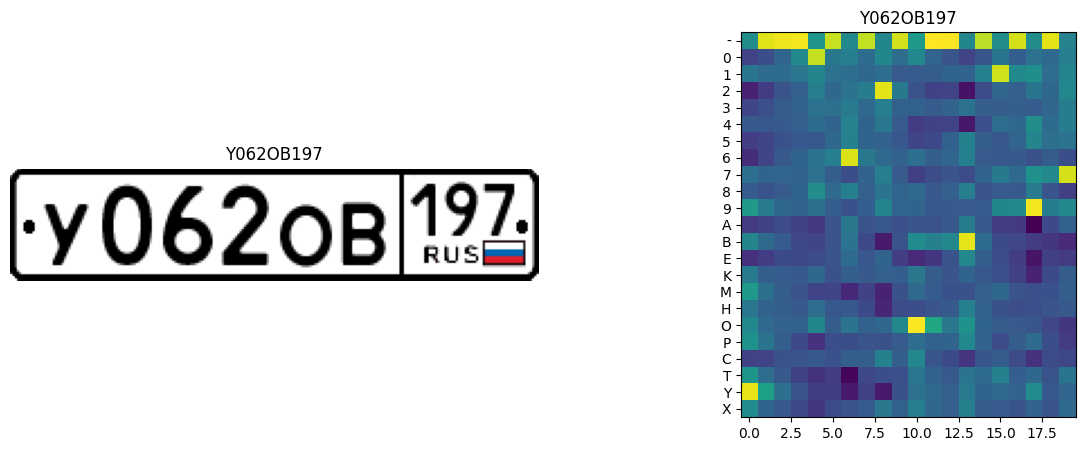

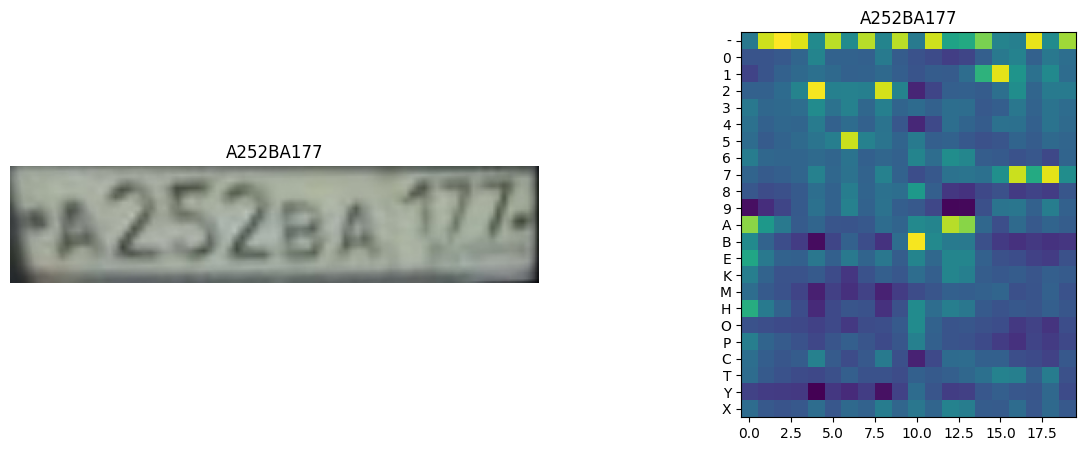

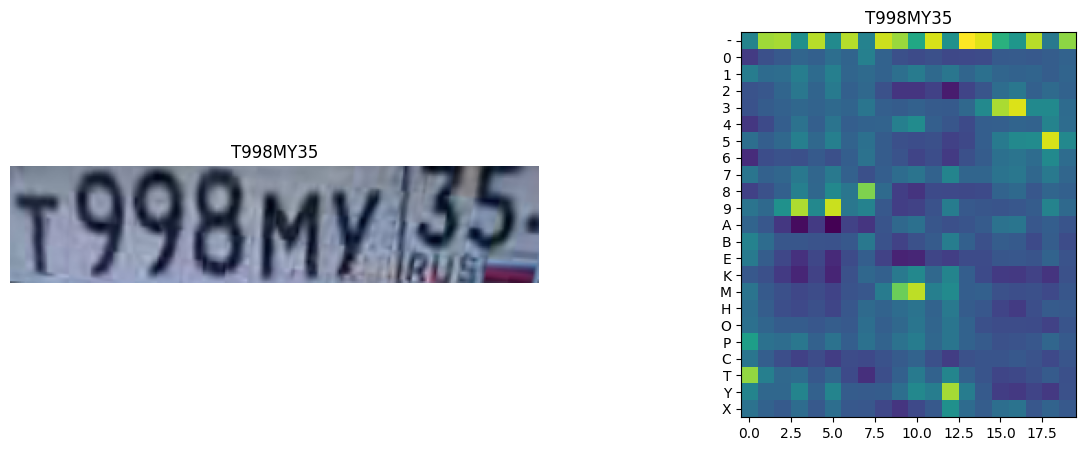

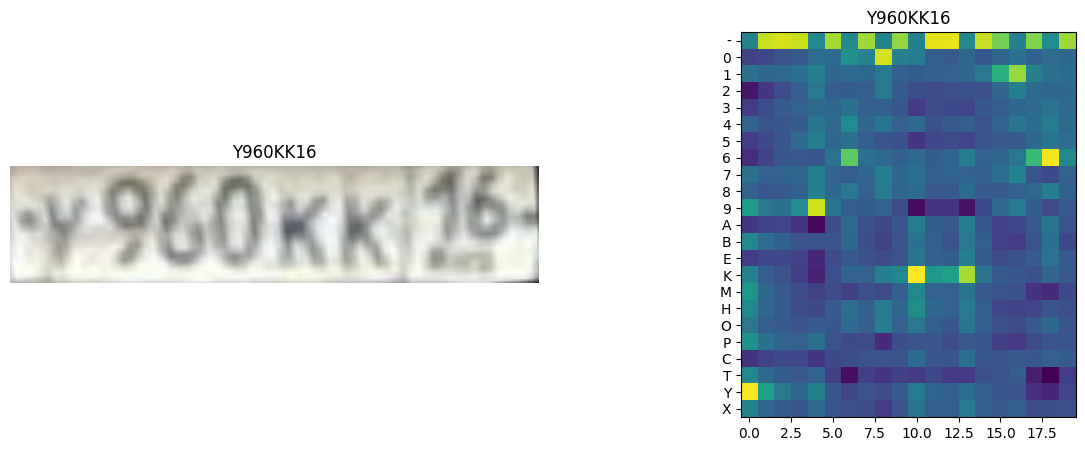

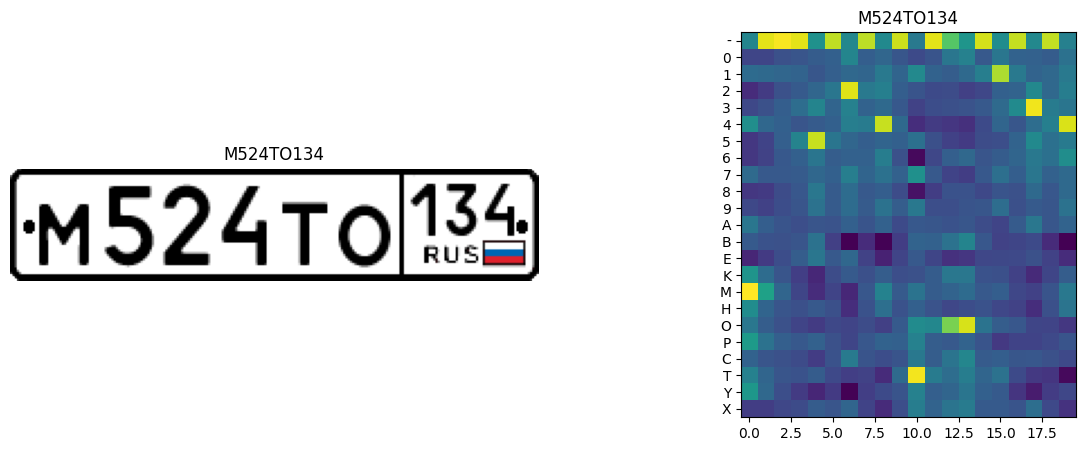

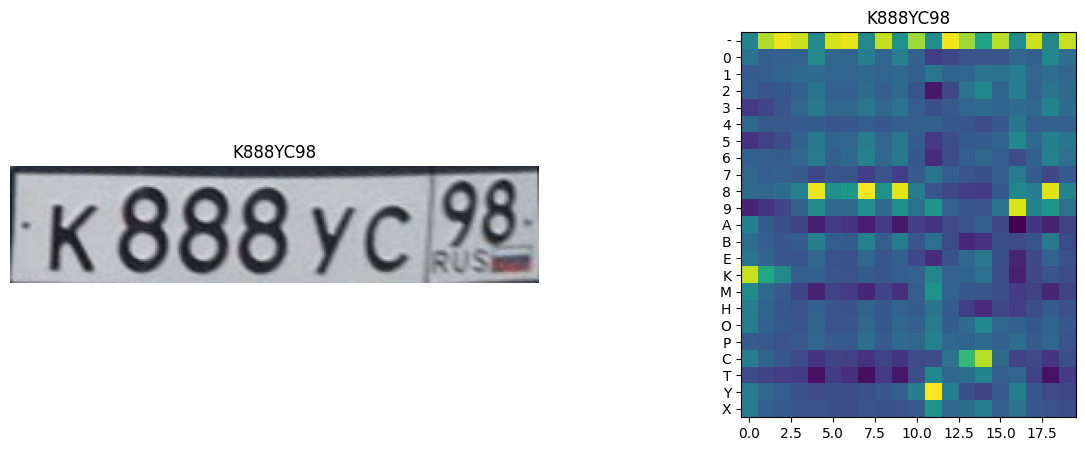

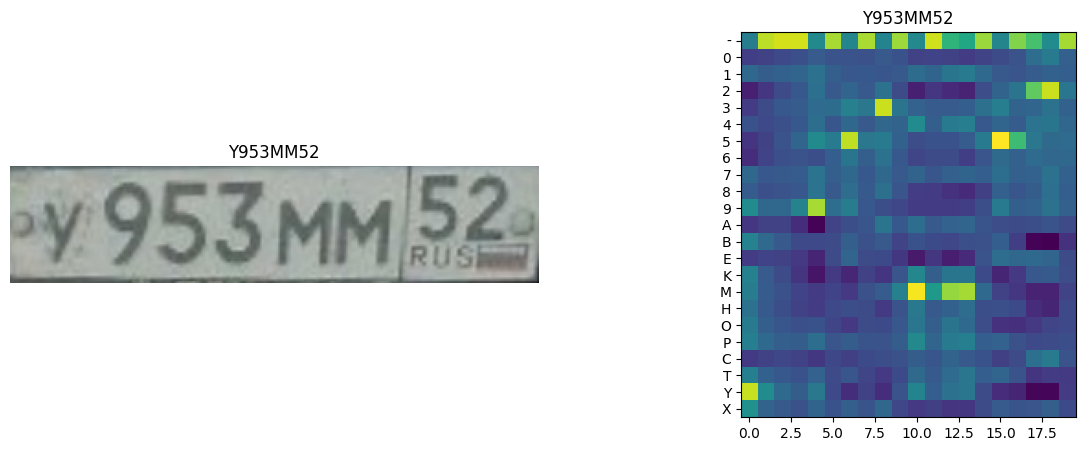

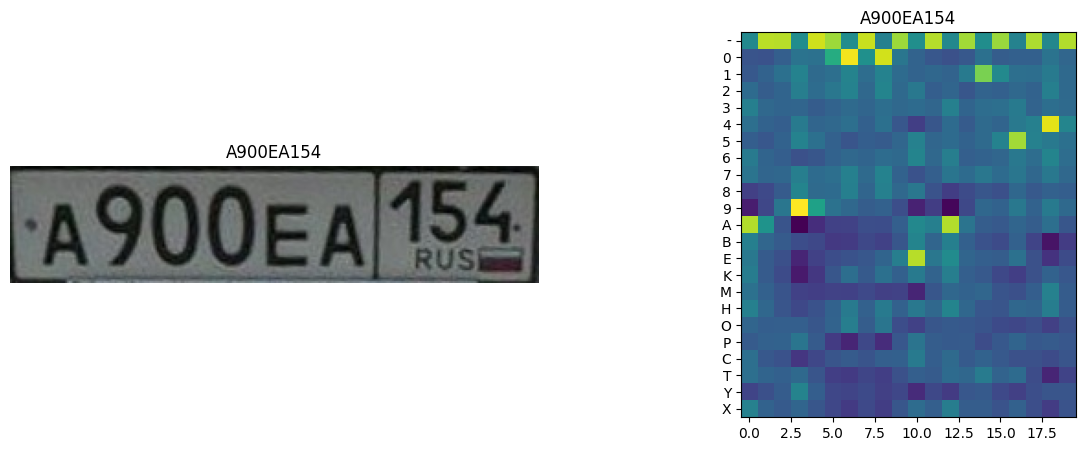

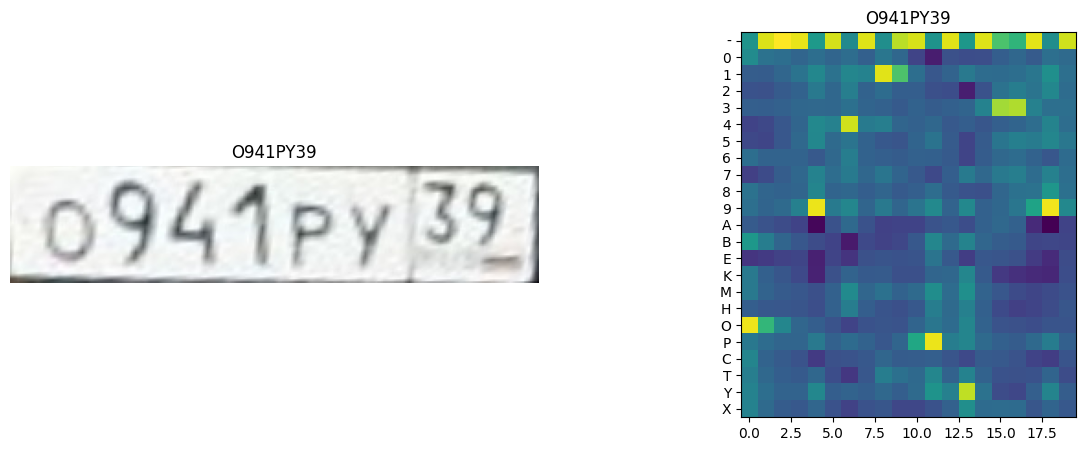

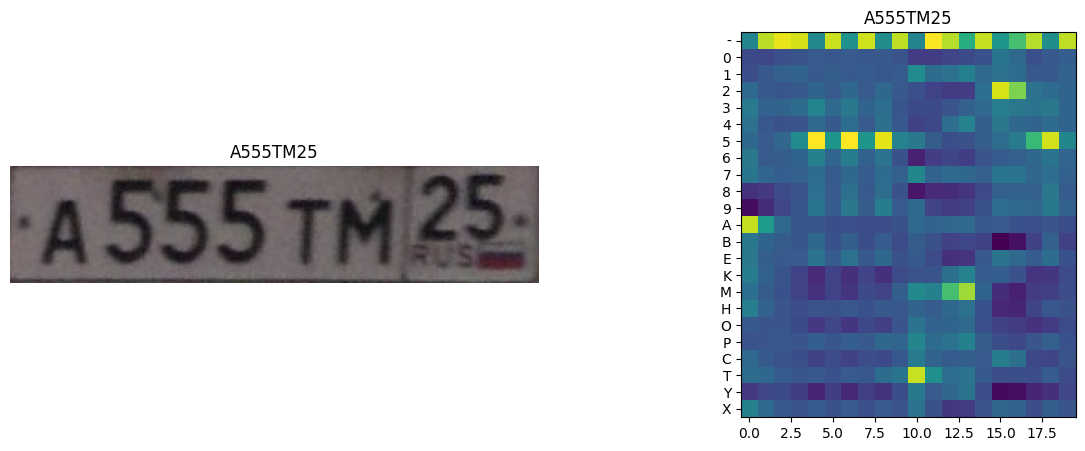

In [54]:
y_ticks = ["-"] + [x for x in abc]

torch_images = b["torch_images"]
pil_images   = b["pil_images"  ]
seqs_gt      = b["seq"         ]
seq_lens_gt  = b["seq_len"     ]
texts        = b["text"        ]

preds = crnn(torch_images.to(device)).cpu().detach()
texts_pred = decode(preds, abc)

for i in range(10):
    plt.figure(figsize=(15, 5))
    pred_i = preds[:, i, :].T
    
    plt.subplot(1, 2, 1)
    #image = images[i].permute(1, 2, 0).numpy()
    pil_image = pil_images[i]
    plt.imshow(pil_image)
    plt.axis("off")
    plt.title(texts[i])
    
    plt.subplot(1, 2, 2)
    plt.yticks(range(pred_i.size(0)), y_ticks)
    plt.imshow(pred_i)
    plt.title(texts_pred[i])
    
    plt.show()
    